# Detecting settlements using supervised classification and deep learning

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Get the data for analysis](#Get-the-data-for-analysis)
* [Filter rasters based on cloudcover and time duration](#Filter-rasters-based-on-cloudcover-and-time-duration)
* [Visualising clipped mosaic and training points on map](#Visualising-clipped-mosaic-and-training-points-on-map)
* [Part-1 Classification](#Part-1-Classification)
 * [Masking settlements out of the classified raster](#Masking-settlements-out-of-the-classified-raster)
* [Part-2 Deep Learning](#Part-2-Deep-Learning)
 * [Export training data](#Export-training-data)
 * [Prepare data](#Prepare-data)
 * [Visualize training data](#Visualize-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Train the model](#Train-the-model)
 * [Save the model](#Save-the-model)
 * [Load an intermediate model to train it further](#Load-an-intermediate-model-to-train-it-further)
 * [Preview results](#Preview-results)
* [Deploy model and extract settlements](#Deploy-model-and-extract-settlements)
* [Generate a classified raster](#Generate-a-classified-raster)
* [Conclusion](#Conclusion)

# Introduction

Detecting settlements for a region has its own importance to urban planners and monitoring them temporally can lay the foundation to design urban policies for any government. This notebook aims to compare two approaches - the traditional pixel wise supervised classification approach and the modern deep learning approach for detecting settlements. We will be performing end to end solution to detect settlements and extract their polygon boundaries for both the cases and comparing them to analyse pros and cons for each of the approach. 

# Necessary imports

In [1]:
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import Image

import arcgis
from arcgis import learn
from arcgis.gis import GIS
from arcgis.geocoding import geocode
from arcgis.features import FeatureLayerCollection
from arcgis.learn import prepare_data, UnetClassifier
from arcgis.raster.functions import clip, apply, extract_band, colormap, mask
from arcgis.raster.analytics import train_classifier, classify, list_datastore_content

# Connect to your GIS

In [2]:
gis = GIS("your_portal", "username", "password")

# Get the data for analysis

Seach for Multispectral Landsat layer in ArcGIS Online.

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
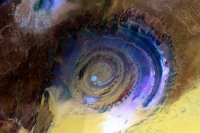

In [3]:
landsat_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = landsat_item.layers[0]
landsat_item

Seach for India State Boundaries 2018 layer in ArcGIS Online. This layer has all the District boundaries for India at index - 2. As this notebook is to detect settlements for Saharanpur district, you can filter the boundary for Saharanpur.

In [4]:
boundaries = gis.content.search('India State Boundaries 2018', 'Feature Layer', outside_org=True)[1]
district_boundaries = boundaries.layers[2]

We can record the extent of our area of study.

In [5]:
area = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                              'xmin': 8496782.255339516,
                              'ymin': 3444090.042863525,
                              'xmax': 8797638.398669826,
                              'ymax': 3566389.288119748}
landsat.extent = area

The OBJECTID for Saharanpur district boundary is '09132' that is what we have used in the below code. Also it is important to add extent to the geometry of the boundary selected.

In [6]:
saharanpur = district_boundaries.query(where='ID=09132')
saharanpur_geom = saharanpur.features[0].geometry
saharanpur_geom['spatialReference'] = {'wkid':4326}
saharanpur.features[0].extent = area

Get the training points for training the classifier.

In [12]:
data = gis.content.search('classificationPoints', 'Feature Layer', outside_org=True)[0]

# Filter rasters based on cloudcover and time duration

In order to have good results, it is important to select cloud free imagery from the image collection for a specified time duration. In this example we have selected all the images captured between 1 October 2018 to 31 December 2018 with cloud cover less than or equal to 5% for Saharanpur region.

In [21]:
selected = landsat.filter_by(where="(Category = 1) AND (cloudcover <=0.05)",
                             time=[datetime(2018, 10, 1), 
                                   datetime(2018, 12, 31)],
                             geometry=arcgis.geometry.filters.intersects(area))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df

OBJECTID     AcquisitionDate                  GroupName  CloudCover  \
0    2360748 2018-10-02 05:18:12  LC81460392018275LGN00_MTL      0.0411   
1    2360749 2018-10-02 05:18:36  LC81460402018275LGN00_MTL      0.0007   
2    2365229 2018-10-09 05:24:26  LC81470392018282LGN00_MTL      0.0235   
3    2365230 2018-10-09 05:24:50  LC81470402018282LGN00_MTL      0.0104   
4    2363765 2018-10-25 05:24:31  LC81470392018298LGN00_MTL      0.0034   
5    2363766 2018-10-25 05:24:55  LC81470402018298LGN00_MTL      0.0084   
6    2374779 2018-10-27 05:12:34  LC81450402018300LGN00_MTL      0.0003   
7    2382362 2018-11-10 05:24:34  LC81470392018314LGN00_MTL      0.0009   
8    2383968 2018-11-12 05:12:36  LC81450402018316LGN00_MTL      0.0001   
9    2391317 2018-11-26 05:24:34  LC81470392018330LGN00_MTL      0.0031   
10   2391319 2018-11-26 05:24:58  LC81470402018330LGN00_MTL      0.0106   
11   2392531 2018-12-05 05:18:45  LC81460402018339LGN00_MTL      0.0005   
12   2397733 2018-12-14 05:12:32  LC81450402018348LGN00_MTL      0.0100   
13   2401123 2018-12-21 05:18:44  LC81460402018355LGN00_MTL      0.0222   
14   2401177 2018-12-28 05:24:31  LC81470392018362LGN00_MTL      0.0019   
15   2403690 2018-12-30 05:12:33  LC81450402018364LGN00_MTL      0.0086   

    DayOfYear   Shape_Length    Shape_Area  \
0         275  863211.750925  4.652535e+10   
1         275  851821.808928  4.530870e+10   
2         282  864249.005456  4.664003e+10   
3         282  852038.709661  4.533114e+10   
4         298  864003.480054  4.661440e+10   
5         298  852052.926372  4.533265e+10   
6         300  851500.296316  4.527314e+10   
7         314  863994.276519  4.661226e+10   
8         316  851603.254073  4.528346e+10   
9         330  863991.415360  4.661195e+10   
10        330  851938.390626  4.532084e+10   
11        339  851973.199621  4.532425e+10   
12        348  851383.857661  4.526085e+10   
13        355  851916.741276  4.531834e+10   
14        362  863720.224906  4.658332e+10   
15        364  851598.768218  4.528268e+10   

                                                SHAPE  
0   {'rings': [[[8842440.179299999, 3627905.796800...  
1   {'rings': [[[8799651.220800001, 3442773.486500...  
2   {'rings': [[[8670522.289099999, 3627673.343800...  
3   {'rings': [[[8627077.993299998, 3442759.749600...  
4   {'rings': [[[8668674.6948, 3627854.217100002],...  
5   {'rings': [[[8625255.243900001, 3442931.826300...  
6   {'rings': [[[8969606.0125, 3442791.7321000025]...  
7   {'rings': [[[8669263.2619, 3627728.654100001],...  
8   {'rings': [[[8969738.007399999, 3442925.248800...  
9   {'rings': [[[8669961.7306, 3627710.4842000008]...  
10  {'rings': [[[8626659.587900002, 3442921.529799...  
11  {'rings': [[[8799698.1228, 3442772.1602], [874...  
12  {'rings': [[[8972363.073399998, 3442845.388999...  
13  {'rings': [[[8800469.5092, 3442744.7710999995]...  
14  {'rings': [[[8671754.256099999, 3627529.248599...  
15  {'rings': [[[8972212.594099998, 3442761.256499...

Mosaicking two rasters with OBJECTID - 2360748 and 2365229 using predefined <b>"mosaic_by"</b> function, so that the whole Saharanpur district can be enclosed in the resultant raster.

In [49]:
landsat.mosaic_by(method="LockRaster",lock_rasters=[2360748,2365229])
mosaic = apply(landsat, 'Natural Color with DRA')

We can clip the mosaicked raster against the boundary of Saharanpur which is our area of interest.

In [24]:
saharanpur_clip = clip(landsat, saharanpur_geom)
saharanpur_clip.extent = area
arcgis.env.analysis_extent = area

# Visualising clipped mosaic and training points on map

In [48]:
m = gis.map('Saharanpur, India')
m.add_layer(mosaic)
m.add_layer(saharanpur)
m.add_layer(data)
m.legend = True

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAABM0AAAH4CAYAAABZpRpBAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P1nc6NJki4K1rQsXam1oNYEQRIEBUgCBEAQ1FprTWaSySSZWjOTSa211lqlzixdXd09LWbO2SP27K7d3TW7u/sX9trej88+HsjsmTl2f0LRzC1eEdLDI174Q3ePj/DL3y9/v/z98vfL3y9/v/z98vfL3y9/v/z98vfL3y9/v/z98vfL3y9/v/z9h79fQLNf/n75++Xvl79f/n75++Xvl79f/n75++Xvl79f/n75++Xvl79f/n75+5/+PlpcW8D86jxmVkjL85hdnsPE0ixmV+awxOcra/OYW5/H/MYCFjcXMcP7kaUZDMxPY2RxBpPM/4FmVxdZ1wLm1hYxwbqG5plvbhpjS3OKxpfmMbWyyHxLWNhcw8bzAzx79xqvvn6DF6+fY2N3E0sbK6yD7SwvYGppAbNrK1jb2cLey2d4+c0bvPz+HfbevsL6sz0sbq3z/RKmVxbYfxnHIhZ4Py/ENpbZj1U+W+a7JdIi+7bE8cq45jm+GdL08iyv57FIWmCf50lzUpc84/UqrzekHtLG+hI2SSusc4nj2FxfxvPtNbzaXcervQ0c7GxgfXOF9ZMPLD9HngjNkJ8LvN/YWMLB9ipe7Kxib2MZyxzj5NwMRqanMDg5hb6JSQxMTGFmbhYbrP+AvHjGfK+2VvGGvHl3sIt35NnrZ/t4dbCH1+/pDXnx9Yt9/PD6BX4ib4R+fPsS35Gn35BvL3a3sE9+77K+VdY7xTkZmZ5gm2MYmhzFyNQopqbHscE53WVft8mTNc7t+uIctjhnu+TDM47pJfvyln0/4Li3V5awRVpfWsLsLOeX/R8ZG8f4xDgWZmewxbHtcR6ec8wvSS/WOR7y8iX5+Io8fMVnr1jfS+Z5wbl6SXrB9zuLbHt2CtsLs+zLPPbY9h5l5xnf/bCzhr+82MZ/ebeH/+u3+/jbiy386dkG/niwgT8/2+T1JttaYf+W8O3Lffznf/4R//1ff6YMLJCvw+ge7cfg+AAmp4fZ30GMk+ZnR7CzPMly01heHMPi/AhWF8awtjCBudkxRWsLk1hfmMLy/CQW5qZYZhpz5OEax/iMMviK/F0TWZ2exDxpg/2V+d3kmKZmJzEyOcL2RjAxPYqluQm85nr6cXcJ3+0sYm91Ckvz43w+jtX5CawwnWHeWZLcby5NY4dr7jll4DXbes55fLaxSt4vYnR8Av0jo5gmz19wzv60vYyfNikvlO9d9mGd87kwM4GJ8VFs8/pryv4P5PsfKKN/5jz+aUfSZfxtbwX/+dka/vPzNfzLwQp+3l7Et+sLeEu+vSHfvyE/v99cwuu1OWySFwvTY1iZncDGHPnCdJn38+zvMse3NjOGVabybIPv9pl/n7x8QR6/5lj3liewND2C0ZF+DA31YWyU8zE5jFHOzfBwH4aGezEy0ouJ0T6MkybG+zE10Y+5yQEsc742OF/zE4Mqb/8g8zIdYdrZ1Yl7j9tx8+Fj3Gl7gg7eD/b1YnKEc8y+CU8HhvrxuLsLDzs7mHais68bo8Osf3xQ9advoAfdfNbPVK77B/owMDCI/v5RDPQOoq+nD909Pejo7UJ7byf6BnswwjFMcAzTrGNmjCmvZ0YHscr2Djh/r5em8O3qHN4sTys+rM+OYnFiCNvk0+L4MCbYp3H2Qcb0fHkKz5h/l3K2RTnYnBvjehgnr4cxM8W6p/qxODOIpZkhLM8Mk9ej5Aflk+nC1CDmmGee6dLUMFZnRrC3MI5X5PfLRc7V1AgG+7vJmza0dbSr62nyd2asDwvk8TzTJa6NDc7dLttemhzCLN+PDHShr7cDw/2dmB/tYX+7yZMudPG+vecpJjhXY+TDYF8nOjqf4MbD+2i5dxdX793B7bb76Op+jInBTvKkm3PRgzGWHx7oRH9vO3p7HmNqpBNzY12YGn5KHrfhzoM7qGttRcXVZtRda0XrvRu4/+gOersfYajvMQZI3d0P0d31AJ2d90n3eH0fPd2857MuvuvouI8HbXfQevsGLt9oRU1LMyqamlB+5QrKGxtRfKkBRfWXmZIuX0Zh/SVkVdYgrawaaeXVyKisRmpZFZJKKhUlFlciuaQK2ZV1uMI+1V1tQsmlS8itqUVmBfOWVipKI6WzXHppFZ9Xqfu00gq+K2c9xaQSpJSWoqyxDtfvteLOw+uovHqJfahj3y6htqWRY29AdctlldZebUBZfR0yissQn18MW24hrDkFsGTlIyY9DzFZpOx8mDLzSPmwZhciubgEOVUVyKlku8WliGMZe16RIltOISzMZ0zLRVRqDqLTcmDMyHXUwzqi0rJhSMlCRFLmPyhc0mRSyvs0KeM9Od6rZ6So1CwY3l+rlHnC4tMRnpCOsPcUynvHswxFhkSWS87iWNgH6QdTE8nIfkWzL8b0HPXcmp3HceTDnl8Ae0EBkoqKkFddhaYbV/G46x7XYxu6KVMDXHvjlP2xiW70DT3GvY5baHrQgquk+0/v4BFl5Vb7DVxtu0pqQlPbFbQ8bsZ95uvoeYgnnQ/QcrcFlVfqUcY5qWu5wnm6ifbOh7j7+Bau3WtB850mRffabqHtyR08eXwb9x+yzltX0HCzAU23G3HtbhNu3r2KG3ea0XqTbdy4gpu3r+IB57v96V08eSryeQsPH91AJ+sdYb96n97Gk7YbeNx2E11sb5T7yjT37emJEX5Px7DO/XNlgXtYXxv6KOODfU8wyfW6zj36e37r/8tffsL/+PvP+K/85v35+zf8PsxhcKgLd9nHhjtXUdZCGbtah1r25eq967j9hH3oeoTrj++g+nojCpuqUdhchcprtai5Xo/G2xzDo5u4/eg2aq81IquuHFm1ZShqqELplVpelyOtqgS59eXI4fP06mKk15WgoKGC7dSiUtprrkXJ1SoUNVWi+EoVCi9XcJ2VUI4pZ4mp0MclQxebBJ0tCSG8/kC6OMczeRf870g94zu9PZlylIKI+FQYEtIQ8YHknhSdlA5beiYKy0tQWVOOsqoy5BQXwpZBuUxMQZg9SZExJRVpxXloulKDa831uNRYhfwqrpWcTEQmpLCeFCRkZ6KgLB+1tUW4fKkMlxvKUcu05lI56jieykulyKnIR3xuBkwpyYhOTkJMWjLMGSkkpllJsOQkIS4/lWs/k3tBFhLy0mBKjkeI2UKKgSnRhvyyLNy5fQldj6+h/nI5Srh+y2ouIa+8gvKfCktGEqysNyYpEaHWWITGWaC3mRWFxJoRGGWElzYc7n4hcPUJIgXCMyAY+qhIxMTbYUqIh8FmQag5mnkjoIkIJel5HYagqHAE8DooIgTRlkgkpFiQmGpFcroNcUkWmGxGRFqiEGGOQmh0BMKM4bDajcjKjkdJSSoKihKRlZeAtKx4JKXFwZZkhcVugTXeCnuSDTk5KWiqK0ZbSz06KEu3a6tQTr6mJdhRW1mAm63VaGkqQ2lpOuITzYiNM8LK9qIMYQjWBcHHXwN3L1+4evrAw8cXAUEBiIjSIdoUBq1OCy9/P7h7++CiiycuuHjgvLMHLrh64KI7Uxd3nL3oCmc3d/gG+CAkQkueBHGsWvgG+8ND4wuvAH9oQ7XQGYJJQdCFaxEc6g+N1hsubq44f/Eizl24ACcXJ7h6uMDFww2u3u5w13jBg3lcfdgW8zm7u0ET6Mt+6WCzRyAu0QB7ciQs8eHkmQ4+bMfF0xtOnp4s4w2/QH+ERupgtITCnhCJtHQTMrPNSMuIQWFRArJzY5GZaUFmWgwSk6JgMukRHa2D2RyC2Fg9YsxBCGE/wyP8eR0Ie3wI7Il6mO3BCI3SQBviR/KH3qBFJPskFG3Vw8Y+ZeRbkZYTi4RkE2LtkTDGhCEwJABuPp7wCvZGsCmAaykEhjg9Qo3B0Oq18Ce/AkI1CDYGUv5YX2IY5TgC5uQoWJNMSM6yICndzHGbKDNRiIyN4DMzYlh/jD0K8RxHEseXlGFCXoENmXxntYer+qXOiFiOK9WAlIIYrksrUopjuV/EI782CQX1yciqSURCcRy/CTEIjTXAPzwEHoGB8Ah2kGdIIHzD2VdjKNd5JL+ZcUikbBozEuBnsUIbZ4Y5Jw7pVUnIv5yKvEup3MeSuI9RbkttXJ9x/MYnIaPEznUWjVDyO4TzFkp+R5DfZs5jcloUcnJjkJcfg/iUMMTYyAejFiFh/vDTesLd1w1Obk44c/E8Tl44hzMu53Ha6RzOupyDu78z/PQe5K8bnL2c4eXnBjdPF8rrRZx3pXzxmYuPM2XLCR6+zvD1d4Gr63m4Op+DVuMKo9GfayoQxjjKfyznPdYP0fEBiE8NQXpmONejgX0zIDc/AlkF4cgrjUJBZTSKK02oqLSitipO9Ts724iEhDBERgVwzr1hMPkjNSNckdUehGijBiazRrWjM/vAK9QdLmzfR++NCGsQIjn3gdEBcPb1wEknZ1zwcoWnzgtak4Z7ehAMSSGITArlPmhAZlEcmi7noKoslfuJmWXDWGcwAmO4Bi2B8Gc9nqG+cAnygpPWHR7hXvA1+cLP5AffKH94hXNt673gSdJEcv2a/VneHz5RXD/MF2ClTMZq4B/DNWwJ4HchiL8puE5SwxCdEgFLmhHhljB46fzgpPGAX6g3TLGByMyN5DfBiPSiKCTlh8OWrUcYxxts9OW8+yHKxvHbA7h+gxGfFIyERB3SU/Swkz+RUb7Qh3nCYPBCnDUAmeR/QXYYCnPDUJAXilxSYZGB+yLbyAlHEuuINvlwL/NAYIArAjmvQQEkLeXB7zy8PM9Aw9QQ5g4bx2O2+CLC4A693gX6EBeEh7rBZvZFCuc6kX2yWPwRFeWDSIM3goK4H7mcwtGjX+HTjz/F7//pd/jNR7/Brz76FdN/wue//jVOH/sMxw/9DmdPfAqnC1/hzLkvcN7pMKxcnztby/hf/sd/x43mq/Dx9MAXn3yGX7PcP330ET4i/Yr06ae/w1dffYJDRz7H4aNf4ujxwzh28giOnzlKOT/B/fAs90pn9tcDoWFeiIj0hdUWhJysSFQUm1BWaERqSiiCDZxT8l8T7gNtuDf3Eg/46ihXHIOX1onfrvPcR0/j+KnD+PLLL/D5Z5/i49/9Hr/51a9VP37/64/w2ccf4Xe//Qi/5vXnn/0Khw7/HkeOfYLDxz5lvz7H8dNf8v4zHOP9mbNfcE8+wm/DcXhrTsHT7xRcvE7Cyf0kn5/i2jvDvp/GOY7hBMdz6KuvWOdn+Pzzz/DFV5/jEMd65MQhHD11BMdOH2V6FIdPHMVHApjNK+BsAXMrDuBMADAB0RaorC+R5knLVKKXNxYxx3Sc7wUwG12awawASltrWN9Zx+L6MmZZzyQVbQHJRhfnMLG8gImleXU/TUV/kQr/CpX/jf1tHLx9hZffvMWrr1/j4OUBVrbXMbe2hFmWF9BMygnINr++guXtDazubWN5fwuLvF7e2cAS253fWMY02xTAbpFll9kH6cec3JNW2L8Vvl8Wkr6uLzJlfo5hcmn2HwChgFpLKo+jDgG+BGwT0GyFJICaAGWrfL+2voQNtnvwHjD79mAT35Be7W/iYG8LawL8scw821hg3XPL70EzljvYWsVL8kpAkCWOcWxmBkNTUxiemsbw9DTGZ2cVsLW/6cjnoA28Jb++f/lMAWMCnL3a22F7pINdvDnYwzfP9/Hz2xf489ev8PObF/jmxR5esC8vybPnO5sK3NnmuOYXZ9nmBCZmJzA9N4FZ0hyvhVbmprC2MI3VhRmsCGjGMe+sss8c83OSgGavtwSUWsYzzslzzuXu2goW5yk7c3OYn5vF0jz7vzCHnRWWY54Xmyt4ubmsgLOXHP8b1vFmcwmvSFKfAGgvyevn5Nc+53trfkaBdwds+43kJ+2TTwfkyVvy5Gfy+O8vt/Evr7bx88EGvt1dwzc7a/h2j3NAHj0j7zdYdp117gqfn29han4SveOD6BztR99YP8YmhzAxNYTp6WGszo/hYHWK45rG+soY+z+CxTkqKqSpmWHMzow4QLPFKSotU1gl/5YWZjHHfi6zv5ury9hcWcbM9BSVmHHMTgofOYYlyg5pZmYSk1NjbGuMdQkwNon9lRnyYo58ncHa4gSWBPiYH8fGwoRKF6dHscp5ecE8XwuAtbuCn/bX8cPBFt5x3r8hCYC2SFmZm5nG8swU9jlnAnT9cWcF33MjfEZ5EwD0gLL3fGUW31Duf+bznzl/35Pvcv8d1/Oftpfwr/sr+G8v1vF/ebWB//RsDX/cXlYA2wvy8TnpG5b7w94KvmVf9pZnsMhxCAl4Njc5ShpWNDsxjJnxIcxNDGFpSgCdcRxwfM+XJlnPBJ6R9lcmsbkofBrC8Egf+oZ70TdKGulB/1CPAs3GOE8zE4OsjzQ5SH4MYW12GOukBc7jLJXFceYZG+mnUjmEqdFBDPT3KqDscUcHnjLt7+vByCDfjw1hnn2cGh9GP+/burqoMD7FrSftVKI7MTTUj6mxQUxS4RYgTsCyzp4udJF6WEdfP5/19aO3pw+dXd18143u/m70DAi41osBKrcDLCdjmWKfZlnXIvmwMkm5IQ82OfcHc5N4uTiNZ5SjLc61AGrLVIZnRgYxMTSAieEBVW6T7zbI1zXO/8oU5ZAyukIZnBOAd6IPk5P9WJ8fxvaigKBj2Cdvny1OYmduXOUTIE3SNcqsgG4vlqfwdmUar8n/TdY51N+DB0+ecBwdGBvsxQz7O0F+T7Hv0yO9WCRft2ZGsU8ZXOH8LHCtTA/3YHSgi8p6BwZ6O9DT/RRPSU962tHV30Hlvpt87iK/yffOx7j35CGV7fu4RXrS8RhDAx0YH+5kHR1sqwuzoz2YI40Psg8DTzE13ME25LpdAWMP2+6h+fYNNN28jut3byrATECGob4nCmATGuhvQ5cAZCQB0Hp7HqKv9xH6e9sUqNDDZ22P77L8DTTcaMWl6y2oa21G1dUmlDdeQWlDI4ouNaCw3gGY5dfVI7+mDtlVtciudlB6RTWS34NmQqll1cirrkf1lSZUXmlkuXpkMX9WVQ0VYQHIqpBRLmBZNVMhB2iWXFSG+MJi/tgvUmlqaRnqWxvR3nEHnd330HTrKkob6xVwVlxfi9yqKuRUV6L4Ui2K6mv4I55tF5chIb9EgWKm9Dz+IMxFdFouTBl5MGX9G2gWm1OI1JJS5LKMUEYJy+UVw87n1qwCmJlHyhilDpaPTneAZqo8n0en5yIyNRsRyVkIT8xU9A/AjGQQeg+M/c8k7z6AaA7QTAA3B8AmaXiiAzhTgFmiAzSLEGIbkWwviu1GK8p5n2Yr8MzE/lmy8mDPLUBSYRHSSkqQXVGOorpqVDddQm1zA2quXkHjzRu486QNnf2deNLL+e++i7tPb+JG2zXSda71+3jcQ/nqeYC7XXdwr/MmHpLaOm/hXvtNlr2FR0/v4ebD67hxvxW3HtzAvba73E8ecp1TtilTj9pv40GbPL/B6zsK+Hrw6CbuPbiGa3evovnuFdx+1IoHj69Tbq/h1r1m9Vzo5v0W3Ge5js4HnPc2lr+LO4+u4/aDFtx9SHrUgjb2t4/yOyH7yMQ4xoaHMMA9ZoZ7wS739mdbi5ge7+P+OsDvxiT2uJe/4Pf/Lb/9P755jj9+/QI/vDngb4dljHAvffD4HlruXsOlG02oarmMiuZ6NNxuxl2O6SnX9KO+x7j68Boqr19CcXM1iluqUdZSg9obl3HlTjNukAfX7l1HWXMdMupLkU3Ku1yugLLU6mKkkLLry5B7SZ450rxLFShuqEZJYzWKGquQ18B3l8pQdLkCJZcruc4okwWUs+Q0Klgp0MUmQ2f7jyTAmQBqYfYUhNtTEcpUgDKhUEUCfKWqdwKUhZMi7GkwkMyUw8ScPGQWF6K4ugwNjbVovlKHS5fYn/ISpOTnIiE7C0m52cguLUBtQyVu3WhAc0sdSmtKkcjnApjpYxMVRSYkIy4zHTklOaisLULNpVJSGWrJhwaOr5ppdnkB11gGjCkpMCQkwhCfiOgkB3gmYJclOwm2vBSu/zSOPZ15U2FNT4IxOQ62zEQUVOSiubUGDykvjVdqcKX1Cn/LruC//Lf/jj/99a+4/vAhkgu5bpPYH3s89LZY8sdKskBntVCBjYFfSBQ8/EPhEaCHp1YH76AQaEPDYDAbER0Xi0ibFWGWGOhM0QiKNiAoJsJBpnBoo8LhH6ZHYLie+Q2IS4pBcoYNqdnxSEiPQ2yyBTHxMTDGmRTF2I2ITRTQwEJFOBZJmbFIybYjJcuOhDQbrAkWmO1m2JJsiEuxIzE9Hlm5yaggD1spH7cpGy21paguykFdeR7Ky7KQlZ/EvGZEx0bCaIqE1RwFc0wkIqPDqaCGIFivgzY4CIG6IIRH6mGzM098JEIidfALDqBS5A83L28qRJ646OoBJyE3Ac3ccJGk0foiKkZHJdiA+NRIRFn0Cgjy1vor8g8JQFB4oINCtQgIpmLu5wV3T3e4ergqsMzV00EXXZxZrzMuurvioqcbzru54NSZi1REBQjxQkh4AAxGHcKjglVd/sEa1Yanny88fH3g5uPF1Bu+Wj9odQHQsm2TNUyBZrk5VgUm5efbkZFphT0+CjExYeSJnso6lW/WG2sNRVJiBBXRCMTbyQubDnFxOtjighETG4jQKH/4BXnB09+DMuEJ30BvjtUfYVFBMMUyf0okkrJMSGJ7sXEGGKJDyFcN++4ND40XNBF+CjTTRgbAXeOjwEchV/bbN8QPIZZAyrkeMakRsCRHINoWBr2RsmON4HzoyUMdQqL1iLKHw5wYRWVZpyjSFg4L245Li0Z2fizySGlZRtikjnj2Kz2S6zMGmaVWZJXHIaPMhtxqro+6FH4Tk7h2bIhKNiKE7QQYQuATEgyf0GBooth/cyj3jjCExkfwGxYFW74ViSUJsOQkIMhug1u0BR5GMwLtVkRmxsFamAB7aSLiSuIRW2hDLPPH5Vn5vYxFbEYMYpKjYEyIgDGeY0gycBzkdWo0MnPNKCiKRU6+GYlpEZR1zos5EOHRAYiOCYQ+3J9y6g0fjQfcfVyppDtRPi7A2fsi16YLPLSuuOB5EWeczuGC6wWcPX8OJ0+fwVnen3c9j/PuF5j/PN+dw0Xnczhz5hTc3c4hJMQDMRYNjLEBCI70hleQG+tzhb/eA5FWAc70XIvhSM0MR3pOOLILI5BfFo2iKhNKq2JQUhaD/DwjEpPCkJwcjsSEUJgtQQg1+MFiD0JSBp+TbPHBiIz04xrzRbjZD35hXEd+F+ES4AzfCMq2OQChHGdAuAYuvh444+YMN60HAqL9EBoXyO+9DlHpev7GCENsdhQyimyoqEhDZqaNsmdg2RDWoYPOwrVBvvlEcN2SX05aT7iGUFaNvgi0ahAUyzUYw3VNWXQO8oRbiBf8In1Yxo9z7QefKB94817AtQCOX8v8QTbOQ2IIf9uE83dDFH8rmbjPWhFk0MPJxxunuU6dfF0RxLHFpYfwGxGBrFIDUgvDEZsVgqjEIMQkBMGeEgx7KteaPYB7nRYWm5brRIv4hGBEsb3gUA+EhnvBaglABvlemGtAUX4EyooiUVlmRGWFEWWkgmID0rP1iI3XUC48oOH8B/g7I8DPCf7kqa/veXh4noG391mE6JxhMfuwjQC25w9DlCfCwt1hMHgixuiDhDgNstnn/KxwZKaGIpZth4Z6wl/DuXE7RRk6jC+/+BQf/+Z3+M0//Qq/+9U/4fPf/RpHPv8dDv3+NzjyxW9w8vgnOH32C5w88wXOXTiM4BAf3Lt7HcvUZ4vyc+Dm7ISvPv2UZX+F3/7TR6zrn/DFFyx/+GMFRB098QWOnfwKJ04dxonTR3Dq7FGcczrJffccAgJdoAtxR4jeEyFhXty3/WC3ByONfU1PC0MC5yXCrIHG4MP9xYfy4w2dQQBbP64bDQI59+4+F3DmwgkcPvqVAq4+/fgT/O43v8WvOB4B8X7NPglQ9tVXv8XhIx/j+IlPcfzUFzh68nMFmB1j/06cOYQjRz/HkSOf4gSfn71wiHv1EfbxBFw8T8LJ4yQuuJ/ifnZa0Vn2/9S54+TLMZy/cBwXnU7g3EXenz+KE2cP4xj5euTEYRw+fojElNcfiUWUgGYL74Gz6eU5TAmJJdaqWI850sW1ecwxzxTzj1EZH6GSLqDZ2vYaXr7cw4sXe8pKbGplQVmUiaWZXE+vLvJeALRZdb+0uYq1nXXsPt/Dy6/f4M23Apq9wrPXB1jeXsfMmsNybJrtTLIOAd0mVxYdtLqECaYCpC2wrUXWNbexjCn2e4YkYNkKny8JaMY6FkhiXSZWZB9IALOFVfaNYxiTMZBkvAIYLq0tYo11rpPEmmyNZQU0E4uz+cU5BXJtsb29rVU821nD670NvCV9/2xLgWavD7bw+tkutrbWsc58Ylm2vrHIdlmW9WzymYBmrwTMId9WOZ65xXnMzpPPpJmFOfXsOfnwdn8LXx9s490zBzj2cn9bWZSJ5dg3L/bxjs++YVvfkI9C3/HZnwQ0e/scP3AuXu1s8If2CnZIz7Y22O46Njim6bkpjEyPY3p+AgtU4pcXHGDQ4vwkFqncL/L98sI01sifHc7FPvm5T34ekDfPFS1hj/zfZyrAmYBjywsLWFlcxMbyErbZfwHa9tdXlVXUSxkvf9wLQKZAN5JYmQmQJs/fyA9/1rtHmdnm+DfnZ5Vl2RvW/wPLfk96wX5Lm69Y3w97m/jzs2385dUu/vtP7/Bf//At/kSF4eu9LbwlP16QrxucJ7EEm+R4Zpc43tlR9E4Mome8HwNUOAQ0m50eVWDV5sIE9pepgKxOcAx8Nj+M+ZkhTE0NYpR5BVhbnh/jGMexMDeBedY5PTuJqZkp8m8eayvLWFpYxNDIGIaGhqnwjGJ2cpJ1zGB+dgbTk2I5Nsr7MWVNtrM0rUCzg9UZtjmDbV7vLs9wjLN4weu9xSlscG6e8f7n/RX87fka/vXFOv7rq0388/MNvKNsvCEfXpH325SdHcrmDmVzl7x7SR79RLn8YXcdLzhnLyi/32wuKiDtL7sr+NeDNfxlbw3fyXzw3auVWfyRipiAZv+F7fwXtvMvB+v4eXsF7/j+OWXgOdfGO9bx4+4yvtsR4HMOG5SbRY5namIEkwKSTQpYM6pIALPpsUGmfDY9gq35UY5pXNEOebizNKFoeWZEWZf1ULnrHu5G/2gPBkZ6MT42oOpbZNll0sbcKHZZdn95Apu8HhfLrpE+jJMmmXeB8zjDNkeG+9HX343evm4MD/ZibKhf0eQo53JsGKPDYp1GGRgQ4Kwb99upXHd2U7kcxNSozNsQ8wxgcLAPXb3d6O7pRk9vD/r7ezHEZ0Jd3d0KkBNrtKEhtjHcpyzUBngtVm/jvBYrMrHWWqOiu0QeCDi2yfX2invlS9IuZWhDAFS2NzM2gtnxEcWrufFBLE2OYH58mP0Z4Bj7qSALKNiPCSrKQ2M9GJnoxaqAZgsj2CFfD8gXseAT8GyHMrqzMKbAtG3K2T7l6A337W/WZvH1KmVufhxTHF97Rwd6uzsxwf7OKau4fsyN9WOBvFydHMT27AjzjrGPQ1ih/C+MCaDWQ747gLOu7qdo63iCR6Su3g4MUfkeHuyisi9g2mM8ePoId588IH8foaO7HQP9Hejnu66ux2z3iQLLZoZZpr9dkYBhQgO9j5WFzdP2B7j74Laih2138OjxXbQ/fYB+vp8c7sDsWBfntZ31PVTUTRKwrb+nDSMD7erdYF8b2tvv4eY9sQC6hubbJKaNN1pRfbXp34Fml/iD/BIKScW8Lqyr5/NLigQ4SymrQnKpgwQ0yyyvVcBZVZNYrDUgj/lzauoUaCYWZgKWZVZWI0usz0oqqehWID6/BHH5RUgsLkZCYTGyKytQ19yA2w+u48HjW7hx/xpqWxtRcrmOCgLbKipFfEExy5chvbQcKcWlVBZKYMspQkxmgQLMolJyFfAVk5mPGLE6I1myC5BYVIy8qkoU11Yjv7ISaawrjuXMGe/BMgHZ3pNYm/0H0Ow9GTNyHMBZkgM4E/BLgWUpWQ76d0DZvyd5/g8S8Ow9gBaRksH0A3D27+i9tZlcS14FnKVkw5iaA5OAZSSxPDOzT7acfCTkF5I3xUgvKaFCVYacCoc1XXppmQIi82vrcPnGNdyl/Nxqv43rj6+h9VELrj9q5bNbaKectPc8QTv3iLa+Ttx+cot0HfdI1x+24ur9Vtxsu0XZvYW2znuU7Tb09lNu+x5zz2jH454HlPk7eExq77jHubuNW5zDm/dacUPAsXtXceNhM/eHO+hh3g7WISDZrbZW3HrMdtiHts77rJey2/sUjzsfKaCulWWa7l1hP1vwpPs+97FuzE7wGzI+zrXVTxnv4B4zgE3Zr3c3sMpv85Zc8/fAD+9e4Wf+fvrm5QG+5u+EF9z715f5u4Z741Ouwzv3b+PG3RtovUPZv9mMy7euolnkrrsNTwc7cafzLurvNqL8Wi1KW2tQRipvrkHDrSu4KlZyd1vRdLsZZS21SK8vQVpNMdKqHSSAmVB6TSmya8tQcKkCRZcrUVBfifz6Cq6NcuTUlSmgLYckVmbFzJNbVcI1kcO5FqtDsTZLUSQgmNwLCQgmFmRRiemIJEUkyPMUKsQkO4n5P1BYHN+RBDAzUd4Ss3ORW1qM0poKlF+qRENTHVpaLqG5uR71DTUorS1HmRD7VsE+XWquxpXWWpRwHEm5OYhOTEVobBJCYhOpnCci1PZvwFl2SS7yywtQUFGA4qoiVLKO0roSymQurHxvSEiC3ioWZHaExyUgOjkR5vQkWDKTYM0V4Iz15KbAnp2KhJwUXidx38hAZUMJmlvrcOVKPTIL8lHT1IgXb9/g//e//+/4//5v/xsmF5aUvEfGJ7BeO/kloFksdLFWaAUw00fDS2uAu0ZAsxB4akPgG6xHSKQBUVYzjHFxiIxlmRgTgozRCDJFsaxQpALONIYw+OpDqIALuKGHwWJAbJIZSZl2JGTYYUu1UZk0I8omgFkMbMkWxKVaYE0SIM1IMsGWEovkzHikZsUjIS2O76xI4H1iViLieG9JsiAxxY6S4mxcphxdpTw11xThcmUeCotSVXu6qFAEhlK5MoQj2miA0RyJqBgDwqPCEM0+hUeH8ToU0eZwKvqRMNkjlCVQQFgg/HQB8NFq4OnvCy8/H/hofOGr9WVKJS3QHyaLHilUpLMLzcgptCIl0wRzXATCBDBief8QDXyYzyfAD16sw4NKtpunB8kdnj7urJOpnxtcvVxwwfkizl4kOTkpOn3hIs6cv8gy7uy/H+sMRER0MAL1AaoeZ3dPOHs4yIv98vZn/0i+Ab7wY3v+Qf7K2iw5NRpZWWZkZ1tQWGBHWjp5bCMfTKEwxehhNuthtYYiIT6CymgUsjKjkZ5qQFJiKJIS9EhK0lPp1pE/WujC/aDReUNDxTgonEp4TBCs8aGIS47gfEbCKhZw5J9Y7Gm0fnDlWMVaziPAEwERLMsyHgHeOOfqinMurnD28YAP6wqO0XI96hDJtqLFWilWD73MQUQgywSxjD+8AjUI4vijEsIRYaFshWgpXwHQGYOVxZaR/U+RceZbkV1gRnqeieuWYy+28rtlR35NPL+F8cjidU5VAr+nCUgusMGUYqT8GxBsDGV7bFPAOPIkLCECUeRHDOfUlmdFUokdWdXJ/G4nwZBmh3eMBc4GM5wjzXA3WeHDtRCQYENQkpAV+mQzv3kxXKtmWEkxydGwpETDnmlEUl4Mv6NWZBXFIlOlVuQUWZBbYEFmrglJGQZYE0JgtuuQkBIGG+fBaAni/AcglHwM0HnCW+MKrwAXuPk54bz7eRw/e5rK+CkcJx09cRLHTp7EmQtnFJ11PoszTmdx6vxpnDx9EqdPn4CX1wWE6D0QZvChTIk1mzMV/wu44HmBa94FmlBPhBr9ERMXhITUUGTmRSK/1IjCchOKK0zILzEiLSsCFgFVSclp4chgv1NSwhHHvmfmGDgHBiRncV3xfSD7rAl2hzbMg/PpjIs+F+ATRtmO8UGIRcM1F8A2KTP+7nDy49hCvRBg8ud+okVIfBDCknWISiMvcqKRURyH/OJE2OKN0Au4GRnEPchB/gauD50vnALEyswTHmHeCDD7I9hG+bUFQks59o7wh0uwF9xDveET5QtNDNcLScA1H5Iv29VYAhAYG8hyQfxNEUr5DIc+NgwBlO2AyBC4avxw3ovy7esO9yBP6GL8EZuuQ3phOPLKIpFbxvnOpDwnBiM2OYT7GNdiRgj3NQ2MNg1MsQGIIUVbNQgO90RgiDuMRj9kcoxlRSZUlApFo67ajKbLcbjSYEdNrQUFJZFITg/mehTrWFf4+jpBQxnQCGDmc57zehZe3mehC3aGyegFe7wGcYkBsNo1LOMDI/ltsfohPl6L9JRgVBVH43KFFeX5RtitWgQGusDb5xycXU/i1JnD+OqrT/HZx7/7B+j1yW9+hS8//g2++vjXOHLotzh2/GPK2qekz3Dq7FdwcjnNfTaMchCPIO5B586dwLGjX+DwVx/j6OGPceL4pwpkO3XGAbSdOPOlAqVOnj1MOqKApfPOJ7lHnoWfxglajjGIcqOjjIZTVsVaMZbzGJcQDBt5a4rnHHHutJG+CrgMJw9N1gDubVoEBHrgvNMZHD52BJ9/+QW+/PJzHCJ9/unH+P1vf4Pfciwf/+5XOHz4dzh+8hOcOP25GsOps+yP9Il0+twRrqGjOHLsS+b7DMePf8Fnh3DO6Sic3U7Ayf0ELrqfhJPnaTh5neFaPINTF0+QjuM8eejscRqu3mfg5HEK511O4Jzzce7vx7m3H8Opc0dx/IxYnB15D5p9sDYjCUA2TRLQbIJKtZDcC6j2ATAbXphRNM7rrb1NvHl9gBcv9zBPRX2SeQTsEssvh5umwypN8sv1/PoSVrdWsf98B6+/foU34nL57gUOXu9jZecDaCblxTVzEVOsZ3x5QVmtDS/MYog0ujjPfkr9S8zvcAWVvkndApgtri5hlmWUi6QQ251lX4XmBAyUsfF6bFEszcQ1dQFzbG9BrNA2lpWl2Brr3+CYxbVvgXkENFtlnWIh9u3+pgLKvt7fwJu9dQWYveH1M/6ofcYfs1tba9jfEWBtFbvby1hhPcusT0CzfZYXwOwZ0w32dWNtGevs79oK+bKyqN59LZZrz7aZ7uDdc3HB3GXdW3hOestn37/YY/vb+Jk8/8OrffzAH83fk356RXqxi3d77Afb2mZ94kK4t7GKvc01trGIydlJjM68B80WJ7EsFlSkRQFC5gU8m8Yy52qdPNvfXGHZFeySz7vkw54QebVF/m+Q1kmrCyS5X17E9irHJyAd29sn/QfQjHW9YF3POUfPWN8zpi8FNBN3VfJhj/3cWpjDNvn8gm18w/7/xHdCb/n+2doK3u1s4fv9HfxEHvyJPPi//fkH/N//5c/4+3dv8fXeNt4+2+M8bCnXyAWOY2xqDCMzoxicGUbf1CAGpwYwNj2ISbHKmZvAOmlTWXgJoDWC2ZkhRQowGx/A0Fg/JqeGMD83ivlZcWEdwcjEMAbGhjE0PoapmRm2s4jp6Tl09w+ju49tDA5hbHQU41R6piZJ46PKNXCB/VhlW89WZvBqfY40j1cbC3iztYxvKCc/7a7ih+0lvOZa21ucVkDVX8Rl8sU6/s+vNvH/eLeNv+2v4O3aPF5wbsQC7IBy+W5jCa/IT7HEe0YZ+po8FlDtGeXqFfn2A3n8z7tr+Avb+NveKv4olnmcEwEiX3Md/Ly5gD9vixXaIn4k/byzgm9Z52uum2dctwdLM6x3Fq9Vn+fYzgx5RrmZFWsxhxupuGJuL0xgl/K0IoAQeTQ9Tr6Rd0vTQwr42pofU+6Ga6SthXEFmglA1jfUg4HRXoxN9mNM3ASnhjkvzCeAJmVUXBZfr0kfprEiQNtQH8aH+zA23ItJzs8S50VAM7E6GxQ3wYEe9X6SiqYCzoaZjgxieGhAKaPz0xOY5JwMD/IZ52pmbAzTpLHhYZaX+etHb1+vAsz6mAqINirtURHt6e1GV4+4JwpwN8By4trZj+GRXuWqKcCaAGWb5MH6e2uxdV5vTI/jDXn9hnzcI+/EmszhNjpGPjjcWxcnh7HAsmI1NzTYiwHWN0UZnJwYwOhEHwbGObaJHszNDGBldgirlFMBEffI9wPyXaz5Xi1P4gVTsT57uTyDr9cX8B3l7Pv1WbwlH9c5VwMCBPZ0YXygF/OjA1jiPK2Qf6sC9pH3Owo0G8U218gm52+Z7c+PMy9pcphjHOhCZ89TPOlqR7e4qPZ1ore3g9cCmj3BQyrrD9ofoa2DinnXE+ZtR0fXY7Q9eYjH7QJwPcZwXzt6qLh3dT1CN9MB3g/3P0VvF591MN/je6S7ePLkHh623cVD3j/lc+WSNtyJieEO9PY8QqeAbB0P0EES8Gx4QKzROjA+xL7x/u6DWwo0uHXvBm4/uIkbTBuut7y3OGtE6eUGReUNjai6cgUVfFZFhbXqqoBql5BeXoNURdVIKSOVVCG1tAY1LH/lRgtqmpuQp0CzauXaKS6eOVU1yK6oQVJhBRLzyxGX5wDNxC0zpawUhXXVbK+O7VzG5etNuH7vGi4xFdAso7wC9vxiBYDZcosQn1esyJpViJiMAkSniwulgF25yp1S8n0gW14h+1uGkvoalNTWIKu0HPGsIyYjX1mVGcX1MSOP93nKBVIsutQz1mPOYl0CvvE6JlPy5iAyRYAzB/glYFmkuF9+cN0UMOwDQMZnH1wzI+Ve3ie+d+tUYNt7Uu/+J9Ds/bWUEdDMmJpNxSUXVrEuE2J/YrPzlZWZgGYfKLGgSFE8+WrjO+FvRkUlqlqu4EabAGY30fSgGZfvXsGV+0249eQGHnc+wP2nD3Cv6yludT5F4/0WvmtG68MWXHt4jekN3Hh0C4+7H3JP6uCa5r401IUnvQ/woOsubj+9idvtN/Gw466yFLsn7XDuWu82o+XeVTTfv4o7j69zPTzCCOVzYKAdT3se4lH3fTzqeYDHvG7vaSO1o51rp13WCvt0q/0WroslXNcDrvluBd5P8fsxMTyEoX7HnjPMvWKZ38Vn25vYXl/D870dfPf2Ff7y07f4T3/8XlmYHXCfn+Oeo1ynOx9zHT1Gu6y5x+z/o3vKzVTxRoBBAf3YXuujVtTcuoTKG7WkOtTcqEf99ctoljHdbVHAWeOtJlS3XkJmXSlSqyjHlUVMi5FRU6oos6YM+fWVKG2oRqlYl4k12aX3gBnLiAVaYUMFShqrlLVZNsvG54s7biaiU9IRlZzONAMxqZkwp2Wp1ER5iU7OgJEkoJmAaKHK4kxANpItxUEKOBNrM7Ewy1IWZjmlxSirrUB9Yy1qr9SiobkeV69dRsv1BjS1XkZDSz2arl1CfXMt94AKFLF/BTUlSMzLQXRSGsLikllnMutMZtspCkQzJqUiJiUN8VmZSMzNoiKdhdSCHGSX5iGrPI8ySdlNEbAtAcEmOxXCOOitdhgSEijTiTClJXCNJSo3TWtWCuKyUpGUn4bEojTuGdkoqStSVm6ZhfmIy8xEfUsLdp4d4H/9//y/8f/8f/2vGJqeQQb3jwh7PMJscdBZYxFkslAhjIFvSDQ8Awzw8A9/D5rp4RsciuCICBisJthTUqgEZsOanIIwq4X9M7JsNOswkqIRaDLALzwM3roQeAUFsWwQAsNDYDBHwppgRVxKHGwkc6LVAZrFmxGfYUNClg3WFAsiLJHQGyOpXJqRmpmIwpIMKuuZSMpJQGp+EtIKkpk3HsaEGCrsZmRkJyO/IIPKZiauVBWg9RLnqzQTVtar0YfAJyAIevYnIioCUeyDWL6FCFBmi0S4KZyKlljPhSMsJhQhMSEKnAkwBEETHkhFPhD+OirQoVqERgUhIiZYkSk2FCnp0cgqMCO72IKcYisV2jhk58UiMdVIZThMlXH39YGLh6eyUBPrtIuubnD39oB/kDeCwnwUaYI94aOh8u3jSiXMWYFnp85egJOrMwL1vggzadnPQIRGsj/B/izvBVcPD9brQaXMA14BVPQ1vvBnGhDopyy8DNE6KpYGJCSLa2wk0jNNKMiPQ3JajMOizhZB5TMctjgSU7s9AonMn5zEMvFhiI/T8zoUmRkRyM7hcyrzsfE6jjsIRpI1UY+UrEhk5BmRnB2N2BQDouJCEWHUISgkQFmYuXi4k9zgpeH4OF53f09c4P0Fd1d4BnpS1vy45gK5b+u4PoIpQ4EI5BgDwrXwDw2Af1gAPKl4uwooqNdAR76Hk+9BUTr4sA2fUA2VZS2CjcHQc97MiQbEc05Sc01qPvLKYlFel4SqhlSUNaSgoC4ROdXxyCizc21aYUkzwZgYxfUYBYPNgAjyITI+gt+yKH7/TLDmmJWlWGKhHellSciqSOF1Er9bdmhjY+EbEwtvkxXeTP2scQiwxcM/1g53riN/awzCRD5TzbAIeEaZiM+MQUZxLPKq4pFfk4jyy6koqEpAeiHlnH3OK7Qiv8RKmYpBSk4kkrIjmJL3mZyrRAeIJvwPj/ZHSLgP/ILcqYxfoOJ9Cl8eOYavjpKOHMWhY8dw7CQV97OnFJ29eAanL5xmvpM4evwYzp49CW+fi5QVV/j4O8PJ5RzOnDut8l3wOA8X34tw9XOGp9YVQRG+ar4TUsOQmRfF/sWguMyC7HzOeUIIdJzD6IRApOcauAZNyM8j73OjUFQag/S8SMSlhsIQw7kKcIN3oAv8Q1yZOsOLpIvhGjD7QBvlA3+9N7y0nnDxd4OHzh0+EWIFRpnmWMVFUmfj2kvSw5Yt7o9xyClI4NqPQiDXqciJJoIyo+TFDy4BPgo0c6HMebL/GrE6EkDIIpZmWvhGauAZRpkycN1EC1jmT/KDv9kf/hYNNFYHYKaLC0FEQhisaUaYEiKV3LkH+cIt0AcXKdNuweyjwU+5kIpFnCVNz308nL+TyKcKM+VIQDMdzEkh3O9ISUEwxWk4j1qYybPouACEGL25v7ghWO+BOK6F4nwj6qtiUV0Zg7qaGDQ3xuFWSzJaryahtp6yUyzu2YEIi/Tieic/OU/aAO4TWqYazqn/BYQEu8Bs8uE6DkBishb2pADuA4GwJ/I6QZ5xvjL0KMw3oKnWhpZ6O8o5nzFRfvDzu6hANycXys+ZQwokOnLoE3z+8W/wye9+hU9//2t8+elvcfzoxzhx4hPKk7gxfoIjxz/DsVNfKquxoyeYkk6eErfNwzh99hDOnj+Ei06H4eJ+DM4ksdQSd86zFwWUErCMpAAqvhPQzOMsfHwvKBfNIMqDuGiKC6tYRlrFSi8+EFbyMyYpECEWP+7Z/tCTIjiX4cyn03vB3esiTpw5gS8OH8KXh7/CiZPsy5kj7PeXOMQxfSUWb18KYPYpTp75HCdOs8/vgbLT547iLPsibpZnLx7H0WNfKfDvJMd3ln0973Qczm7vXTJ9znAPvsA9zgmenAMn8u+iAGW+JL67KGCa2ykFol1kGXHfFBJA7QKfCYj2kbgpinviLJVxobn3NLM6jwk+nyQtUvla3VxSzwUoG6FSP0qFWoCqpc0VbOxsYG1rTQFZAmIJ2DVPkjqGmW9wwRH/TICqOT5b21zG3v4GXr15jpdvXmLvxQE2D7aV5ZjUIe6ZCyy/vLHCepZZbgEjC3MYmp/FwJzESZtRgNfUe7BMxUvjOORaADABzGb5TsUnk/EtOwAzoWmSWJlNsYwAc2L5tkJa2FhS/RWrMyknccw2BERjnnnmnV+YxfryIl5tr+LPL7bxL6/38MPBJp7vrOLl3jp/yK5jZ2v1H+6b+9srOOA78RmWe3ENlXRLQCgBo9jm9oaAZh8AsyVsrC7jBfn4emddWaM9I18PdjfxTLlZbuLd/ibb3MYfn+/gx+fb+BP78Kc3z/DTq2f49sW+skz7encDr9kPcanc5jiWyactuV5fwSr7L5Zm4+KaOT+BOSrwC0ILk5hnuso5EgszKbMk5daXVVn5z/Y2+brNdIfpBudiYWYa01PTmJuVMvMqxtYO525XrMzWVlhmGTucO3HlFLBM+vRyg/3iewHedpl3j/wQEPIFefGceSVumZCAZm/ILwFvviOv3rHv32xv4MeDPfz0bB/f72/jHcuJu+Ybscojj96SRxK7TazNnpF3K5zH8ekxDEwOo39yRIFmQ9ODmJgdwuzcqIpZJq6QyxIja2YIk3w/NjGAEQFBSEOkEd5L/LO52VHMTo9gbHwQfcN96BwgDQ6id5hKysgE+ofGqQwNoqO3H739AxgcGsLI6AimJsUaaxTTbH+O5T+AZl9vLOD7rSV8v7OCH/fX8fMzsSLbxB/31vhOrO5m8GpN8iziL3sO18n/5c0W/rSzTJ4IoLjgcJ+kXArI9ePuKr6m0iTg2UvKvoCPW/NzeEVei7Xed+T/15Svl4vzeEnevuacCNj2B/bhD1sLeCcWbpz/XXEj5PwfcO73SbuUh835KazxuVi/rc6OY0Gs5jimNV5vsYwAaJJnm3vCNvOvUrYWphwumwKazZKvApBJLC+JvSWAmgBEM+TlyEgfBod7MU5ez5HP86QV5ttanMA2ZfJgeQZv1ufwYpUyNjeByTFHvK6FCbEOE7fKfrYndQ0oy7PhQSq6AwJqiWsm66bSOTY0oCzJxOJMYrA95xoXkrFtSOxA8mlucoplR9DbM/Bvbpjd3ejr71Uum4NDve+t2HowKuDbuFjUjSrLstGxXgyNSgylLs59D6bZztLEiALMJN7YHtvcnp3EW+6jr7kP7fB+hfwZ/w+gGeWQ+RfGh1n3kLJek3YXKDPiHjw+NYDhSfaFNDHVjxmSxC9bFPfiGbEwm2TdM/hufZZyMcPrabzh/ffcr38QWp3Dd5zjF2xbrM0EOBvl2OZGOTecjyXydZm0PjmkQLM9ro9dtrvL9tfFPXainzyXuGf9yo1zbLgLQ0Od5Bn51PUUj58KMNaB7p5OPOl4gnYq7E+etuFxRxvaux5T8W/ns0fo6n6Evp42DPSI1VkbOjseokfimo32sI0BjA50qmft7fcVYCYulvce3sHtB7fxgNcCso0MPFWgmbhiCmAmgNqDtrtoY34B0sR9c3a8C6OD7XjCeu48uIU7D2+xHqYPbuLanWu4eqsVl69dRV1LE+kqr5vRdKMFl/isvvWqSgUQy6qsRQYpnaTAMxXzrEYBbLfu3VQkVmoSB00ot7oOhbX1yCqrQXJRJVKKK5FQWKrcMjMqypFVU4H8+irk1TqooukS+9KM6qsNyKmqVnlteUVUrgtgVfHLCqlsF8CYJnHIPrhUOoAuS3a+Ix9JADOxYstiGwU1VUgvKUNsdsF/AMvMWfmKFGCWkgOJaSbvBDBTdbAtBaiJ5RlJgLMPIJkhOQuRvBb6AJoJECZgmSk9G+ZMsX7ju4RMBxgmbpnvATXJJ+XkvYBqApIpN00BQ3gt7psCqMl7U1q2Asus7IdFiOO0ss82AQU5XmlHxT4jiQWalc9i2Xd7QREyqypR3SoA2V3caLuFpvucz9tXUE9qvH8Vt9puoOFuE6pvX0blncuovtuA1kfXlVXagy7KG+VSLCWHRnqwwL1N/tHR1d+OG09uoEUs1pTF2A3c77jLff4JHolsPbyJmw+v4Qap5UEL7j25hZ6+x9zXKH+jsi/08hsh34suPGbdd9m365TBW5TptqeP8IRrQ6i7r4NrepTf1CllpSzWyuMjYv3Kb8iUfJvnsb62xt8CO3jBb+C7l8/wh69f4e8/vsN/+sM7/Pz1Advro4xzLI9uc309xfhgL0bEjbzrCdfHPVy7fxN3xPpSxSm7gTvkxzX2ufFuI/nUgEt3GtR1y12xmruG1nutaL7Tgis3ZZ00Ire2HDk1ZcitKUd+bQXll1RfgbIrtahpvYzaa5dVLLOiK5UqfplQkUorUdFcg+qWOlRerVHWZlkVxUgpykdifh4S8nKpFOchuaAAqYUFSMrNQ6xYQFImIkVWFFCWghDbfyQBzeSdxDKLoYxlsGxBRakCzOoaatHc0oDm1kZcv3EFd+404+69ZlynLDTfakDD9XpUsl951SXIKClEdkkRUtgHW0YW2xUgLw2W9AzY37txJuVkIy5DQL10UhpiM9IRn5OJpPwsJBRkURbTYEhIht6SgBBzPBUDO/Sx8QgVkCshnnJuR3RqAtdKImLSkmBNT0F8Xhri89ORWZaL7LICpBRQ9vk8uSAPT3t78ezVS3zz4w+YXV8lzy7BlCqAXjz0VPg1ETHwDIyCm58B7v4GeGgi4OYbRiUgDH66cIRbTLClxiExKwkNzVdx5do15HFvMCbFQ2c2IdAowJkDPAuINMAnJBTuAcFw1wTCNziYyrceYdERiDbHwBIfB3tKAuLZd1uqHbY0G3kSj+S8eMSlx8IgFmuREVS2qSBnJ6P+cjFarleioDITaUVJSCtMQmqelLXClhyLjJwUpLKuJPKkOCcD95tqUFmcTcXKgiBDmALOAiPCEBZlQJQlWoFyARECjumhCddBSwqODIHWoIPGEEyiIh5BCg+CJoypPhB6cWOMC6UCLK514YhPi0JKlgnJOSYkSDwnUk5RLPKL7cpNMCElWlmceWuoZHt7wsndHRddxSXTHQEhvoikgmxNDYGdirY9VSgEUVSi/ansOXk4U1m7SAXTBVq9D7RhVOyDfKiYecGHCrufkNYbvgHijukDb5KAVAKYhUVoYTKHID3diIxME3kQwTFTYU+III9MVKCjlUVdjDUcxphQGE0hMHBsERyzkLhrGgyBMJkCkZCgR1ZWJPIKopGRa0BqVjiSM8M57gjeRyGrwIR0KvkJmZEwJYYhnO2GkG8Sx0yAu2C9v4qPFsC+S7y2c84uilx93KGNopJrC1JgmdaohRvHcN7Dg0qmJ1z9veHOe89gP7jw2kvvh4BoLWVM5kMLX5J3qAY+4RpoIgOg5bsAgxbaSM6TORiWlAjkltpQUZ+Iy1cz0NCShRqmxZeSkVeTiOTCWBWXSgAzW1oM4rMsJDOScy1IL45FWpkNiUxjcyyISY/hOiGlmBVZM22Iy0lAXHYS60hAVFIcKR62rHSkFOZxDeYoAC3IbuX3x8rvjoUUg1jORWZJHIprk1FUm4Ls8gQU16VxnSYgKTsGiRnRyKP85ArYV2pBbrkZmaWUr7xI2NLDEJOoo3wEwmDWIjxag3Dyzz/IHRdczuHI8eP4/MvD+OIr0qHDOHTsKI6cOKbo5JkTOHPhNE6cO4nDvP/q8BGc4TN393Pw8DyPC05ncOzYMZw4fgJnz53GeaezOMc6xXrN1d+Ze4IbPLVuXMOeCDcGIC0rCiWlccgvsCAuORShZn/yO5hrMAIFBUYUFpqQXRhNuYiG0R6sQDUtZVoTItaG7gg1eSHM6IVQozf3FF/4hHJdeDvhtPN5nHa5ACdfF3iFesInwhveJF+xIBL3TVsw+RxK/nPdcX1lFcTDkhDNdauDj14DT50fPIL84KrxgbPGWwFm7npfeEaI26U/fMgzP7FmEwskk1bFPfPnvZ9J4wDNoimnFspSrBa6eB3Ck8M590bYKRsF3HMys2Nh5hoKt+kRauXeYQ1CSFwQvxfc28yBqs4wATXTQxGXF8FvUSR/o+goYyGIZp4I1h1uErdVDeJTdZQ7zmdCAPdKD3gHuUAX5ol41lecF4W6SjMqKqJQX2fCtSY7brUmoemKHRXVMcjMC4OF+4Q+3BNBQW4IEUApxAMRoR6I4rOYSC/Yrf5IStAiJSUQaelByM4OQVFhOHJzw5CeGYK0DD3nLxJ1VVZcrbejvtyCjGSuXcqTr98FePmchZMr5eHCETi5CMj6FU6d+Iwy8glOn/oU589/hXPnvsTp05/j2PFPcejIJzh09DMcPf4ljp74CsdIJ045wKULzsdw5vxhRRdcjsLV8wTcvE6q1EGn4CLujcynQCqn43ByOwVPn3Pw9b+oLM1CyZuoKF+YlZWZAH9BCoCMSeRaiPNDUIwvAqP8EGLgfhPmC/9Ad7j5XMR5t7M4deEEZZ91O5/gfnqadZ/k3npMWZOdOv0FjrLvxzi246c+J33JfgtodhRnzh0nce0wPXn6KI4fY/5THMfZIxzXMa6TEwo0c/M4A3/tRYRGunOf9UYkKTiKfAxzhofuAly053DB6wzOCWhGcvY8ze/qOdJ5ePichzvHKZZoH4mFlQBia1vLWGEqAJlYlU2TBDSbWpnl/RxWqKhLjLMpKn7jVOonmE5T+RTgSYAqcakUCzNxwXQcKiDWXHJgwBQGSaNUqhVoxndrVNi3BFR6toM9/ghc395i3asst6TcKhfXFrG6saxcJSWg/+TSPMYW5jC68G9WbsqlUrUvLpyOgwbGmE/FQeP1HPsiLpHLfL9CWma74iYpQfknFzku5ltYW8b27ia2djewyD7JeKReAdzkAAEJ/i8A2hTbFffJhaUFZR0mscxes8zX+5t4ti3WZKvYI+1srWCNZSQG2jrTnc1l7PP5wa6AahukTRzsrCv3zr3NFWyvLWFHgKlVjnV5EYvskxwOsMtxvzrYwpvnO3gmllMs/4r0/cEm/vxyB39/vYe/kP78Zl+5Jv7xzQv89PKA/WGZnTV1cIC4P0oQ/jWOR1w7xE3TAZxxbuYnOZ4JzFGJnpudUqm4ZErw4E0BSRfJ37lp5Zq6Sdph+f31RWUt9nxjBRvs5+zMNCanWHZ2RsX42mK+PY5ZHVwgIJhYO22sOmKfkV4JcMaxPmddBySxNJN4ZwKYCaD2htevBUTjPMlhAa/J/7fkzzs+e8dy35Hn35Pn35OH3+6Q9yz3PXn58/Nd/Ot3b/GvP36Dt5SnfeYT3s+LJeTMGIanRpiKdd0YRqaHMTI1iHEBaGbHMDfjsC6bFjBtkkr72ABGSHJAwPS0uHAOky8TWCFJMOapyWEMjw6gZ7AfT/v60d7bj86+AQwMDpOG0D/I6yHWMTKEibFhTE+Oqng0Apgtivsi69gm77/mevrT7jL+/mwNf3++gT8drJM4vh05GGEeO+9Bs3dci3/ks//Ed/+yv4oft5fwM8v9ldd/2RUwbEm5W/7nl9v4Z7F8pPw9X5zFC8q4AGp/4P3fWbcE8n9B2X2zssi2lxxgpALe5vDTJttgvT9tLeEt5V/KShy0N5uL+GFvWcVU21uZwfaSgGcSxF8C/Y/jYGkaz5Yl9twsnnE+X3KO5LCIbbFSnBUgyAGcSZB9SeV+kYro8GAfhgb6FADV1duFXgG4RgUIGlYgkYBm6/Pj2GX9rzbk0AiuYdY3MiJuigN4uz6Fd2tTeLHMPAty2IC4N4oVmQBnAm51obNbXC878bRLXAfFImxEuWFKjKDl6UlsUV6Va+vSEvu8gk2u7emxUQz0s1+97Je4ZrJ/YqE2PzWmaHyY9XNuxYJtRuKkTVCu2KeBYXEr7cYg014qqSrOWX+vskQTkPAF+fZ8cQpfr84p90yxMhN3zBnSvCjKpCWSHJ4gsdCWRF4mJC6cWNxR9siLuRnycWoAU9MDmJ9j27ODWGa6wrELkLmzMKUAuT9sLSoQ9FvO6xu2JQcQfMv9+x2vX3KN73LupsUFVeK9sY8z7OMy21rjvGyy3W32YUfRCLY4HxvjQ9icHHIAaGxrdkws7Hr+EdBfALO+vi51sMOOyAf3FLEA7KPS3t7VhodiNSZA2UA7uvvaOBdPMNT/GD18JtTZJbHI5DCAbiyM92GsvwNdnY/Q8dQBmj16LC5u93Dn4R08eiLB/sUF86kiKS+gmABm9x453Dh7uh5xjjo4P12crw50igvcw9u4++g2Hj4RYO2usj4Tt01xWWu+1aoAtJbbrbgl9zdacPVmi7oXd878+kvIqqlDRpUDPBPKr5M4Wg5Ls6s3W6mQtiCnuk7FNxPQTEjcNCXGmVCSBPEvKkZqRRkyayoUpVeVI7O6AiVX6tiPFly+1oSCuhokFpUqsCxWKO/fQDNFEo8s3QF+iXWVAGUWppJPQLn0sjLkVVfyB36FCvov+STAv4BrChRjXgGZxOVRxQ0T90cBnnLy2Z4DNFNB+AVky3SQuG9KfLN/AGckSQUMi8nIQSzrj2Ud5jSJUSUWZg4LsjBJBQx7D6xFp2RDAv5HJGYqwOwDaKYAMwWqOUCz6Pfg2j9IYpuxn44DARyp3CsrObb5ATwT4CyltAzlTQ24SXm51XYfzXdvqFhetdcbceVeM1oeXEP1jQaUX7+EujuNaH4oQNg1XHt8HXc776Kz/6k6lGSK626W+7YA+mJ11ip5HrXi3hPKUAdlsvMBSQ4NeMT9RVyQKYfM97DjvrJm6+hpUzHQRsf6+R0ZQw/3nDvtbbhMeSq7ehlFjXWc90vKKq7p9nU8eNrGvFzL/O6v8nfAIvek+UX57SG/J+RwIX7vXj/Dv/zhG/yPv/1BAWV//obf+9e7+Jp7+zPu30PiavngJq7faX1/aMYTFWOwi+vz7sN7uEKZvnT9KhpuUW5vX0Er+SGx225KLLYHrWi9T5m/30yeXUXj9Su4cr1JgblXmL/2+mWUNtZwDZQiu6YMhfWVKG6oQlFDJQpJVeL2eK1BUU0Lx8X72tbLvL+Muvd0+XoDGuWQBFJDK/M0VKOwuhz5FayztBhpRYUKNBOKy6LciTtvfJqi/wCaxX4AywSkSqNilg5jSgYslLHMoiKUsM6qy9W41FSPq82c96sNuHu3BY8ecY4ftKDhxiVUX61GSX05ijiWitoKNDXWou3WVTy+TZ40X0ZVDddmUT7yywpRUF6M7GIB8nJgTc+gDKfCkJRCSqZ8pnC9pMGUkUa5lcMHxCotBVGkCHsiwklh9gSExsUztTNPonLXjEpKpEKfyLWTzLWTyrHnIaUgh4p8GmU5RcUue8rv0DLnfpi/W4ov1TGvWGImcv0kIMxmp0Jrho9YmAUb4B0cRSXZCN9AKr5xSTAn2am8pyKvIh/VHNsf//xnvPvuOzzu6UIS21GHBphMCIo2QhsZDT99BNw1jsMDvLQh0IZHQG+MorJspMKXiJSMbKRmZyOJfbWnJcAuLpe5CaR42DNssCRKHDIjTLEmJKcnoLgiG9UN+dyHkqmMxnN8icgpTkFBcRrKy7ORx77FJ9hgMscgzh6L8oIsFOenK9BME6qHp0YsvrRw8w5Q1z4hQSq4u59BB39SABXvoGgqwkY9NBE6+PGdb1gQlfFA+Oi08A7UIDgiEAaLAFt6FVxeFOj49Cj2NwqWNAPMqZFIyDIiPZcKaI4ceBADq92ASJMASRLTTNywNAg3B5OfYYhND+e4w5GUbUBGQRQyqcQmZIYhyh5IpcsPgeHiahQAA5Xx0AgNNME+8AzwhFegABA+rM+XJEH5/eCv84UmiPkjtDBb9TDbQmEhhQr4F+SvYpyJZZzRGoYIswTh1ylwKzgkAME61i2Wan7e8Nd4I5D1BAb7wmDQqJhmyanhiE8JRYxdh5j4YNh4nZLF/uZJ/DKOPT4MpjjWTQo3k5d61sc2g5lGRAXCaA5ClCmQ/fSFj9YL3gr4k/hZ3pwHX3ixLWcfT5wWQM3NFa5876b1hnuANzw5LjfJy3F6MJ8b+ydAmm94AJ9pSP7w4Ttfpn6892Tf/diu0R6GoooENDRl4Oq1HDS0ZKPqSjoKapOQURYPW6YZkfZIhFslvlgU4tLNSM2PRW5FvMqTydQsBwPYJE5fOIJMYSRxzzNwTZo431bOnw22jDgk5iUitzILNVdKcOlqJesoQkhCEkypXItp8bAyrz0nlt9tO7/HycitSkBCnoXrNYrvxRXTzPUQg6x8K6oupaKoKh6FlXHILbdSzk2wZ0dyn5DDEeQAhUCEmjTQGfwQEEJe+pNfnhdx3vkMTpw+jqMnjuLI8aM4fOwoDh09gq+OHMbRk1T4+U4AtC8PHcbnn3+F48ep+J8TkOwkjjHv5598iWNHjsLp4hm4up/nOrlAWXPm3IhFoCu8dW7cH7wRatXAzr5kcP7jk8IRaePcJgbClh7CtRyBjPxoZBQaEZcRptwtPfw84OzpAg9fV/bXk/LvBVtCIBJTKUdJgcriypv1i/voyQtncMHrIufWC35RlMVoH+UyGWgLQHgqZS8rHNYs8iKTay5bLPPsMMdzv4kIppz4w13kI8gHLpQR10AfuHONeHINeRv84R2lUeTLPmktgdz7Q/ibguvDHgJdbDCCLEEKBAsk6eQQhmRpx8q5i4XeFAFtaDDlV8s1qIGHv68C5rQCLNu5hpOjlEt2ONddBOuLStHzN1Ao991QBJoDuIf4UNa5ZsO8EUX+JWfquNbDkZIXhpgkLeuRNe2KEIMX97AgFOYZUFkaheKSMO5tBjTUi7VZLOrrYlBUKq6ZITCSLyGhHtALUBbpA3O0H2xGfyRYWL/dEdg/PkGDlLRA5OWHoqoyGrXVMaioMKKkNJokMdJiUFthxeVKK2qKTchN5Ro3+MDH57xyzTx38SjOXDiMM+cO4fSpL3Hh/Fc4LwH/z3+BUxLD7ORnOC7B8g//Hl8d+tgR0P/IFzh6lLIkoNlpKXtUAUwnTx3CydOHVJ0qYL7HKbh4noK7WGj5n4OP5jw8vM/Cxf0UXD1Ow9vvPLRBztyHXBBEGQzRuyOccmHgWCONvog2+5OX/giz+CIg2kvFxfMP45zoZe/yhq/GDU6e53He4yzOeZzBWdZ7zk2svMTq8jhOikvkSUdw/88/+y0OHfo9joqlHJ+dOMnxymEEZx2g2emzYrF5HBecT5FO4KKQC+sSC7GLJxR45u1/HqFRnAurD4w2P8plAKKYBhs94RPmAmeO8SzHfNHrNDy157lXOXMfuwgX33Nw9uaa8zmLjzY2l7C3s4Jd0qZYRVFRFfBsYWNZAWdiaTYrwBkVMIlvJiDa5LJYmc0qwOrDIQIClEnsMiEBniaovI/MT2NwzgGaDS9OY0zAGL6XAP3L64tY21pVFmrL66uYX3GceLlEpX6VSv4a21+hIi4HAgjINcn6hMZJyspNQDO2KaCfuHOOLzvcQpWrJe/ldMwlpuJeKbHJVni9xDLq1EwBxphPYqCJq+gC2xMrM4nnJoDZAvPLKZlCcjiAw/JsCQcCBolr5Xt6sbuO13tryqJM4peJVZoAdQKciTWZnJQpYNr21gp2mO4LYLa9jm3WIydviguoWJmtvAfMxKJtgbQmbe1s4M2zHbx9LvHMNvBydw3v9tfx04st/PXNLv76dh9/er2Pn1873DK/f76L7/c38TX7JC6PErBfYohtc9wb7JccArAjgJeMh0r2AkkszWZnJ9WJkCucK4mXIuDZPK/nmG5zjnZlLCyzx3kWEE7ul+dnMTMtlmZykuSMCv6/xjnaIp/2+V6Au7e7G3hFHgl49nxjTVmZOUCzRewLwEba5/VzPpO4Zu9Ib1i/vBMXTYlvJiTxzV6THz+Rd3/e28Q/72/hj0y/Ix//sLuJv77cx3/6+gX+8u65ss7bYPmFBfZPYprNTmBiZhybLL/Jfq1RbhfnxzE9M6JAs+kpASOGmA5hUoKtjwt4NoSZmWEszI5gWayjFic5rin2l/xYmlKxvETJGRgZxNDooAowvzg9hoXpcQWuyPUy21whLQnNjqug/htz41iTvvD+7coM/ri9iH85WMX/6cU6/vlgBd9skR/s3zrnZI30gvL48+4q/uvLTfy3V5v44y75sz6Pn7aXVYyyHzeXVdyxV+T5D1y33/O5xC8T4OTPO0v4YcMBhv1dAWzLfO44WVPilUmgfwHJfiBJfWLd9oLrQtw+xR1TrLAOuL5frPF+dRY77Nf20rTql4xri+v5NZ8LveSeILHTBDR7QT7vLc0qCzSxgBLgZ4I8GhNXSSqkw8P9kHhhEkz/aXcXnqqg+j0YHOrDqFJYB8nfEXUgwgfQ7LnsL+TrwGAvpicG2NYEvtuYxrekV3KoAOdojuXEck0OB1BWYQO9KhZZf1+vsgwTS7PRoUH09YqrpbiNikuujG1Z0dL0FMb5XCzThPr6ejDAfgnwNTcxghnSiDrlUk6blGeUGWmPirW4UfYNdivqHuhynKg54ujr8uwwthbG8EwOQqDsbFMeJW7ZAskxz1x3lAcByj7EM5O6ZSxyoML8JGWL/BD5HJ8QJZxti2XdtIBmw8qCT6zWxHpNQDOZb5n7Hzfm8Y7z9w3n9GsBQLn3PmeeLeadGOT4yHc5bbSbcyCHA8jhCsuU+1WSgGd7lOGtyVEscu7myYNFjlkOBRgb7sHseJ+icQEJezsxNNCj+rnNNbKzwj2F454YIh/6xQ3tER52PMCT7kfo7X+C6dEuFZdM4pcpS7MuiUvWxj7IgQBdLNeBQYltxucS/L/tyX20P32IDgHSSD3dcnqmxD97ogA0sTR73H5PkQRYlzr7ex5zfHLCZhva2u/jxv2buE4S4EzlfXIXt3l/7e51tN6+hhaSAGg3eX/tdqtK29ruKADu9oNbVP6bUX6lEaUNDYqqm68oK7Wmmy24wbwPH91Rgehr+Lyc7wU0E1dNx+EA1UgqLoe9sBgJJaVIKS9DemU5MiorkF1TidIrdbh5/xqu3mxWhwAkFpciVk65FLdDBZoJ0OUAtOL53M7n9gJeFxUhsaREUXJpKRUHiRVVhczScnVapgBsMVliieYAzAQUk3rU8wxx0XRYmMnzf//OYcWWq8A2B+UiKs1hcaaswVLFqiZXgWVWAcsEZEv9AIj9R8DsgwunsjgT67REhxXaP0AzBZw5LM0k5pmAbh+s2RwWanLNuuVAAAHNBMhjvx0nazpIAXwkAc7E0i6fPGzkXLbev43rd29xjlpx+cZVNN9r4fOr6hRJBaA9asXtJ5SLR+T9w2Zcf8I5736o1u3SzAT3a34DuQb6Kce32yXuGOXi0XU8aL+DJ5TNp5Svrr52dTrlsIDmg13qvo3v7rXfVQDaU3VQRo86pff244fswy003LqGevapnmkT+3iv8wn6ub7m2Z5Ydcs3f5/f723u1Zv89qpA/3vr/A2wha/53X/F3xrigjkie03XE7S3P8ITcb98cBt3KIs370iMNbGslEMK7uIWr+ubm1BUW0sFswZVV+tw+WYjWsTqinJ3/S7l/y6v3wNnjTebKMuXcam1EY03mnDpRgMqmmsdgf8rihVwJvHKihurUHLFQRXNdahqqUfF1VqUXq1R1mbyTE7OLGuuUQcLVLTUorq1FrWkajmls7YMqcUFVKhyYUnPRkxaFhVXAU0pA0mUi/dgmQT6N1BOBESL4XtLWjbMJBtlIT47Dyn5BcgpLkE511NFdSUaGuvQcq1BWZZ1PL6NHjn84TH5IaAgx13PfpWw/4XVZSgilbIfFby/fKUGjVfYv3qOqaoM+RxrSQ3f15SjoKoEGaXiHsy2M9Ipf2mITk2j3DtIADOxAovLzEJyXq6iuKwMWJnXlJqKKAHYkpK4VlI4hiREJyZQeU1Q18bkZCTlysEEMi6+z6Dynp2BiitX0HTnNiq5p8TmZlLOk0kpbCtJgWaaCDN89Ub4hUUjzBoHc3IarMnpqGtqQu2VBlQ1yoEll7i33cDf/vXveP72Ne60P1YuqGH2WOgsZmijWD40kkqiuHXqVRy0wAgDDLEWBbzFJicin/tROfeznMIixCYlIspu4VzZuPbjEJtBSo1VscssiRbEkuLT4pCSm6CAsiSJyVWcgOyyZOSWpSKrOBl5RalUwqlAx1lgtMYgJtaMrFS2k54Ea2wM/PV6+OiC4RMUDG+tgHiBVFK18AzSUqFxAGeayBAERIUgyKRX1xIEXkA1z2DmC9RAGyYWPnoFxkQKGGUKQQwV5oSMaAWaxSRHIDIhnKkjIH2igCFCqSZlcSYuknJYQGwS8ySFwZIaDnNKGKwCSKUbkJwdiaQMiQsWisi4IOhjBFzTUikPpgKmQ0ycDgZjIDRBPvD081BxziT1CfSCX7CPAqK8/L2gC9PAaJHDAgJV3DUPHy94Mw0KC0BkjA66iEDOh+NgguAwrQLNQkO10OsDEBKigU7nR6IiyvrCwyXotg5p6RHkLxX8uGBE24I47hDEcRz2pAgYyZNocwgs5EtsYjgizDoqrhqEsL1oYzDi7KFISuEYEyVmnLTpC38qtdpQX4REBSCI5MkxnXd3w1lXZzhLfCiOyY3tu/p7wkMUYIM/3HUChvAZyYv9EwszT72fAkncxQWP7z0CveHG936h/ohhX4qrEtDYkoXG1mzUNqVzjSYjq9yuALOIWAOCIvUICCdPovXMH801ZkVWmR2Z5fH8LloQGhuhZELkIZByobNy7hOjKKNmJObakVKQiMQCrsHsRBgzk/ldS+P3hN+i5BQE2uJhz0xFQXkWyuuyuVemI68mBellfJ5r4fwbEZcuVno2ZBfFobAsARW1KahrzEDd5XRU1aWw//HIKYtFRpEF9qxIrnE9Qkxa+OkpA+8PBPDyc+E8u1Bpd4KrJxVw97Nw9jgLFw9eu53FOadTOHX+OI6dcgBmn3z8BX7/m0/x5VdfQE4rPHz0ML768isc/vIQXJxOQ6vAG0/ojd4ItfhAb/FDiNkPhrgAyqsOtoxQZOZHoarchtISK9LyKP/ZXAek5BwDMgqjuX9Gcb0HwUdcF4M9KXM+iLKwfFygiuVlltMjU4KQkK5T7nX6KB/4sl0vrQvnzoNr0BeaaF/4RjlcJzUWylNSMCLTw/hbgjKXZoAlw4TEnDjEJBihM4bAPyIA3hIvT+8L9xBfde0XpYG/WJcJWBYZAB/Kmh/5FxgbzN8HXHuZ0YjLNnGeTJwLI9exWB6GIzwulN8Hg5rrkJgweAUHwMnXGxe8PHDewx2nXd1wxsMNTn5e3BvYx2C2xbUTybVg45pIZr2JWdGISuCeIpZskQLyckwGX8pdAGxpHHu2nms/GOFWf65HL/gGuUJv8IKNvMnMCEFerpyWGYKC4jBUVEahttqE0jIDMvk8Nl6L8Ehv6BSQ5IkY8spm0iDJqkVafCDSyduk5EAks53MnBAUFkegqsqEujoLamrNKCmLRk5uBLIywpCXGYEC7jtZlC0beaXTusLF9TTOXzym4naJu+KJU1/gvLhWOh/BeefDOHXuK+WKKYH8jx/7FMePf4ojRz7D4cMSKP9LHCUdO/YVTiqrrKMqPXZc7g/hLOu94OYImO/idQbufuc47xfIQyfKwEX4BPCa5B/oBK3ORYFmmkBn+FE2/AN5HezKvcMdQRGe0JL8wrkOdG5wDXTn+vd0yFyQxHh0xTm3czh58RROXDiB41wDx88dUydzHjp6CF9Q/j/7/BN8/PHv8Ntf/wqfCXB25BPHoQQnHH0/deYYSQA2B525IEDiSTiTP3JCppO4VrrxmuOQPmt1zggKdUVolBcSUnXIzOO+mRWCULM3XPn+ou9ZuAWeZ5+dua9Q3kOd+fw89zw+9z+PjzapOEvcrR2SXG+Q1vmjbXlrFXPrS+9dHgVkcsQCE7BMSOKcCWj2bwcIzEOC/Y9SaRYXztGF94DZe9BsiPcOF02HFZgCtlhuYXVJxSBbWFlUIJnEE1sniaWZnIapTtJcYh9YTgC3cdYhpNwrWYfUI4CdsnJbXvjHM3VyJUnAMgWYse+LVCAXBOzjtVipfYjjJqCbWNAJmCYHB2xsOlwot/8dECaWYeI2KYH/JSCvWIwJyY/aLfJLgDbpo7iDKtCMz/YFLNtcVqdmfjhxU2htbVkF/Bdao9K+wrFLX+elf+/LizXb18+28cPLXXzLH83vDjbwDemnl1v4y5s90j7+/Hoff3x9gJ9f7eMPL3bxx+fb+HF/A1/vrCnQ7AX7LwH8d4TYvli1rQnvOSeLVKQFPHNYmckpjnLy5bSKaaZOziSP9jflBExHPDMB34RWmHdhdpo0w+s5ZXW2SdoSYt/FKu0Z25U4Zh8syV5trasg/uKCKSdhbjPvxiLHuTCLddIe65XDAARQ2+Tz1bkZ7CzOqxM1X1N5+JZ1/Znj+tvBFv7l2Rb+yvRHsbwj//94sI0/c+w/kldymqec3CkgnhwEMEEFSFw0V1m/uJmKFZ1Yjs3MSIyyccxQARG3y/mZEcxNDWFKAIvpYSzMjXJs48qFU6zMBCx7sTaDl2uz2FyYxPTUKCbFMmp2BFuL49hbnmLqcFHcXZpR7pV7LCPPNsljcQsU6ysBzXZZn7jPfbc+9w/g7Oe9JVX3FusWa66N+Um8WZvDX/fX8F853/+JCtMPOxKHTAAyh1XYN5RbsQrbJq/e8Pm7NdL6PH7cXsAfSF+zPrEi+5d9sTZbwY/Ksmye7S6o8n/gehewTazQnnHetrk+xSVT6nxOOX7GdJ/yKOORwws2ORYB/wQQlPGIlZkcXPCS6+kl2xfg7IB8lvwyjvXZMQUOTUqMrqF+9A70orOvG+09XejsFcCMaV8P+gf7VBB/AdTGxqhAioUTeb/H+p+TB9usb2p8RIFmk+MD5M0oni+TP6tTeMlUrLnk4AGJaTY81KcAOIlDJiDX4IAjFdfMydFhFVhbYpzJ9fzUBOeGskZZFleo/t4+9HVTAe7txWB/r3LvdMRE68eooj6oU+3YBwHpxDVUYpqN8fnwkJyi6bA4m5rsx8L0ABZmBihbA7wfwBrlRPghwJi4XwrItEG5WOW+KPxUoNmEgH+O00flNM9xARo5JolpNjzWh96RHkVD42yP9+L2Km6uy5OjlAGJZSanp1I+NmSOKQurs3jLuXnN568oly/Z3j5lfo71DnN8PeR/N0lAryWOZ43yv0XZ32M/n89P4IBzLRZo4r65LH0eJS+prM+x/fkJ4akAkr0YJwkv1iQO2vIE5jh+OTSgv78dT7sdoNmDjvsYGHjKcQ6wz473AnwJyCUulxLkXwCz2dEujA0+RbdY7wjYRpLrPgHJeh4rkmspK+QAxyQu2iPOmQBqj9HR8VCBbeLOeffRHVy/LycA3sBNAc4e3sb9R7eVW6XEOrt2xwGcicvmzXsCOFyngn0DbVS4+7oforPjngLYxHVTXDgbrzcrC5yrt1pwg3m7ux5gcaIHjx7fUZY+UlcNFddsceksr1Gnb8YXliKuoBj2IgG5SpFeUaFAsywq+YWXqpX725UbTSi9XIcUcavMK3rvmulwvRRQK06syQQwI8XlF7K+IsQXFyO1rAwFddUoY9mimhoqxcVUvB2xycxiYSaA2Hvg7R+AGd+J9ZnUIwCcsljjvbh8/pvrpyOPmamAaFFp2SqmmVh7xecVOFwlmVcsyP4R9J/kAMHeu26+B9o+PFf0ASz7B2hGEtDsvcXZB7Ds/xA0e++Wqeg9WCagmZCMSVw0BYisutaIegl4z7ltUXQNLfdaUXOjQYFmLQ85148pD+J2+bAFrW0tuNV+U8Ubk1N75aTddbGWJYlbfbtyq+T8yumalIdOylzvQCfXe7eKySgksciedLXh5qNbuCpujfev4TZlQuL6tXdL0H85OKMNj5g+6enE41454bMTT/u60ME9saOXa1v2qrFhjHNNj3A9ibv3INe7uK4Ljcj673uqQLErlMXLzU1oaLmKpmstuHbrOq7fclhKNly/ikutTQqIvUJ5rWi4hJzKSuW6W95Yq05rvfmAcv7Q4V587W6rsnYUOawn78QVs+F6Ey5fv6KsxAQMy79UiYxqym5VCbLERbOu/B9UcNlhcVbUWInipiqUCXDW7ADOKsUls9VB4qJZeZXvmS+vthRp5RKTLh+x2RJEP4fylK1AsyjKTFRyhgLKjLy3cu6T8guQWVqMXDkAgjKfX0G5ryynwlqNa80NeMQ1eZv9vX+nGU/abqC74y76Zf0+vYcHD2/g+u1mtNxswg2mTczX0NKA+qv1qLoia6fCQfUVKKktV4BaIcdaUFXK9jjekiKkFuYrwMmSIf1Ko6Imp2SmICrJAZiJFVpiTjYyi/ORW1bIMnnIKBaX0xwk5GYpV87EvEzEZ6dToU1GZEKCIoM9EfEcu1CMWKulJsKSlapOF00o4PrNzkJEciIMfB6dKjHWkhAWa6eyaoU2yoxAYwwi4u2wpKciLisT5ZfrUVhTxbaLkcb1XVRZg/7xYdzrfKxO4o1JS0GoLRbBZjP8w43w1hkUaOYTEk5FMQKhViMV/lhYUuOpMCazfAUuN11FRV0tUjkOU3Is150NprQ4GHkdHW9BVFwMoklyUEBsipXKeiysGVbEZlFRL05EdnkKskuTycN4KqAsy3wSa81gNiHKZEJqUjzSkuwwmo3QhIVSGRfwTg+NXkcFLYhKahAV3WD4hgbDJ4zPwnXwF/fMaL1K/Q0h8NYHwT1AA3eNP3SRAhiFq1MPDdZQ6Kmom+0CeEWpAPhRfK63hJKPYikWAXNiJOwp0craLC3TTOXVjPScGMRnRCFagorbQmCI1cHI69hUActIosgnh7K8KNOBMMbpYKbibYoPZqqDJT4EkUYtlWU/eHi5wcXDBW6+bg4AxVdANE9odL7Kmi0g2Jd5PODr760s0XSGAIRIrDA934UFIDhCgvprEaTTIChYwDIN9HwXFkYK9UNwoDeiDP5IYJsZVKrTqFxLTKvYJCr7CXqY4/Tksw4hrCM6Roe4xHAFGIQaHQcVhBuCYOS1xaJDLMcaa9MhRk7HNLL+KA3CTVoY5KTDyAB4aLwVaHbRkwq7P8flJ+56bnD2Y/8jfBVo5qzxxEUfB6DmG+GnYlJ5cFwuAd5wFsu0IC8qoFSWdd7QxQQiNsOAvEobqhpSUNWYgtJ6sQYToMsKQ5yBCjfnN0hLClDutzJn9qwYJOZT1rLNXEeRCIwSIFWHQFMIgjnnIZzbiHgDjElG1i/WY/H8niVAl2iHb2wcvMxx8CR5W+IQaItjPclc71mobsxjH3KRV5MKey7XAWUiPsfC9Wznuo4n2VFYmYDqS2m40pyN+sZ01FxOQ3k910p1ArJLbIhJlMMpRGZ94U6+OHHuXTydFTjgF+gG/yA3aCRgut4DQWEeCCZJYHkvjRMuuJ/BWSr7ymLm5DGcPHYEJ08dwbETh/DVoS9x+NBXOH/uBCQAfITRB1Gx/uSRP8JJobwOMTM1c84sAQgTIJdzmZJiQGZWNLILTCgosyCnJAb5pWbklVHWizi+NIlJqEVojL8K1B6fGsJnIVwnGu4HbCPeH9ZUykiCFhECzEV5QR/tTbn3Q5hNA63RD95hPvDQeytrMR9xnTQHIsgaDH0c10gy112mFTGcC1lzgSbyxqCBZxjLUV40lC8t82tjtPCLCoBPhAY+lDUNZSPETvnlOkwnXwvKE1FUloT84gTkFtiRzLVqYd1RnOcQcyg8g/1xztMDJ11ccdzJmeSEoxedcMLVGac4B2cos+e83OHky7WnJ5+ighBt0cMYyz0iOggB7JOGsiqkjeYas2qVS7aNZLAFQGvwhh/nzI9zpY/yVsH6U9ODkZkdgszcEPI3DAUlBhSSsvJCucbIL5OvAjbDSNHkmZU8tnNukuwCmAUjS9wvxZotJxT5hREoLY9GdbUZl+tjUcM0V8CcxGAkyummJDvn1hThDX2gKzzdz+Hc+WOUFUccMrEyu+B0BO4e4toowesFaP0Mn336e3z2yW9x+sTnOHv6K5w88SWOHv0Cx499hRPHD+HkycM4RRk7dfqoigUmpEC0C+ImeVLRedfTuOhxBi4+57jHXoB3oBP3JxcEhrlAG+qCgBAX7mcu8Atyhg/f+QQ6c+/mszB3rl8Pfmso33ruF5TbixquhwABzjzgqeU+4e/MPeUcTlw4iSOnj+HwiSP48uhhfP7ll/j9x5/ht7/9BL/9ze/UCZq/+ugjfPLJr5W13JFjcmLmlzh+8hDpCE6cOoYTApqdddCZ8xKPTKzjznPfOq/67slrn8AL/KZchF+wE/daD9iTg5GeF46ELD10Rm/uaxcUcObLsQXHeEJn9YRPuCtctRfgwnrcAy/io9WNRXXC4/qmAzDbpDK9tbuGrb0NBZw53C8dbpBC0++BMwHN/vGcqVh+CSgmJ2qOkUb+HWg2NO8AzMSFUuKQiQumAFQz76/nBTRaEQuzFWxsvj+9cn0ZC2viLiqg2qIC2tSJl6xHrNjk2lGHA0wTME7qFvBO4rR9AM0W36cCSM0Jse8zQu8t5wQIVMQ8AqYtrS1gi+MW0GyLbYurpZDEHxNXzDfky0vS/rbDakxcJ9c25fCBBQWYiSXbGuvYU6CZWHctsR5xt1hQtMJ8AsItLfPZqgBq4tLpsGhbIB8XyU+JpfZiZxXfHWzipxc7+OHFNr57vsV0C398tY2/vnWAZn95e8D0QIFnf365i39+uYOfme8bzp8KvM9+vWYfBMTaJwl4JrHKZmYdoNmSohlssM8Sr0zima2TttmHA8rEgVghsm8Sz0zyyPuZmUkVz2xzkXn4ThHn5xnr3mcdOxzDNvmwyzrEOk3imb3dFhBvje8pXyy3Oj+H5bkZLM1OY3FG3LrEimsOO0vzvJ7FEuuX0zTfsf8SIP9P++v4C3nxl/0N/P3ZFv5G+ol8l4D23+2s44f9TXy3t6nAuQ1xoWVdi/OUk5kJjEyPYnJuHAuUR4nbNjUziompYY5jTMUqWxKAjLQozyaHVGytJQlEv8h+CX9YVk7YPFieIk0rUGtqahSzYoW2NM4xTeJgZQqbS5PYotzvUbaei/WVstLimASAFGByZpzpOF6tTuPt2gzers7gm415/HF3Gd9sk9e83xHgbcFBb1n25+0l/Gl3BT/IaZbkhYBmykVzZwlfr5PP81NYnZ5QQNcb8l0OEXizLhZg08qy6XvW/y8HK/gb6fXKDA5Y70uuAYmHJmDZ15y3l+TzPvso1mUClr3js284p284l88453tiZUY+yBiWpsnHqTEVuH5rfkKd0CjA2atVjllcOAUkJI83yCMFEk2NKEuzgcE+BZg96enC095u9AyQ+sVCow/jfC+B/MdHqYCSZjkHaxJTi/xUln1sS+pQoBrfy2mZG/NjOFiSAPgTbGNYgUwShF+ANQHMHMH7qcxSER0eklMohzi/nG8qEBJzTKzP5GAAiRkkgNlAfz96unrQ3dmNvu5uDLJvI6xrSLlaOqzOBBwT0EwAIjmAQKzM5MTLebYt8dXGRuTkz14szw6y/0OU7QHKSb+KazRJpXfmvTXctIBuHKPIg1jQiSXbIknAL3H5XKDSLMCauH7KCZ0Sq6iHCno7FfXH/R0qlXuJ47bMvKtqLiaxy7lV87s0TVmgfAlgxvl7ybX4inP+is+fL1AOWfc0+ThJmmHfF8j7Dcr8LtfFM8r9S8r6q8VJ5p/CLusVK7ad2XGssP9jg90cay/L9SlXzQX2QU7dlOvlmSGszglIyj4Pso99T5SF2YPO+yrg+dBgB1ZnhikbMl7yj/cj/U8UYDbEVAL4L4x3q+c9PW3oEKWXJIBYr1imKdCsTaUDvY6DA0YHnmJ4oF2VHxlsR19vGx49uadioN24LydT3iQ5QLNrCiS78f5ggJu4xXfX31ubicXY3QdyWADf3b+OO0zbHt9Cx9M7ePiI9dy5rlw5BVy7do/pvWts5w7nqRPfbXM/GHmKdiroctrnTdZd0XgFRZcuI7VMQLMSxBW+B81KBTSrREZlpQLPcqjg1lDpv3TtCsoa6pFWVo7Y3CKYsx3B/QX0slH5FVIWYe9JncZZUoJclq9scliVFFRVIS6H+d4DbbY8R2rJKlBgmbh2qoMA3lugxReK1doHizaxTJOTMx0AVCzvxZ1TQLOY7Fx1oqa4alqYJ1nKSN7UbOWq+Q+LMgHOmH4AzBSg9t667D+QAGX/HjBLfu+imZrloP8j0Cwthz+e86jcFFAB4vgFCOQ4BNCTPovVnIxHYsaVipXTtUu4fPsqrsl8PryFZs5Z1Y3LuHznKlofXXMAZm0tpGbc67iJti6xDKNcDUqsvi5lTbzOPW+Ba7Sfe9VTOXWTstfd9xSDQ2JJ2qf2ounxEaaD6jTMm49uo/HWVdRdb0Qj277dRvlhuX6umc6eDtbRwX2Pa2NyBMMTw+jj2m7rfIzW+3dY5jou37zBft5RVnLiWnrlNvsnQO6Dm7hJGRYZFflrvHkVtS2NqL7aiDoBzq41KxfhptaraGhtRG3zJQWOVTeJG3EDyhrrKCeVyK4qR+WVejSz3ruU6YeP76Kt7R7uP7yL1lvXFNjWeKNZgYwCCl/iOMTdsvJqnXLPlPhlEvRfrM3SKkqQUlZEKlZAWmZNCXIk4H9jJUqbqhXQJmXFZfPyjSvKYk1impWLdVqDnLBZoSinuhyZFVwTrCelpAgJ+QVILCBJSvkVyiguQZGAoRLYn7JeyzHUM718tR63ye/utpsY5Drtbb+N7qe30dt1j/v4fdwjzy5dYftXub5IDc2NuMm1LpakNwRIJR8vt15GZWM1Si9VoqSeVCfAGWWIVFhZhvTCQsRn5cCalgVLaiaMiWlUUFOgj01CqE0syFJhzchQgJXEPsssykNBRaE6WbOouhj5THMrChxUzrEU5cKemY6oxETWE08lUlzCMhFPObakcG3Ex8OcKVZlSVxPCdDb7QiJs0PiokXEJ7KcWKeJiyfvE2wItceSrIhIjOMaSeL6YN1JiVQirYi2p6Cs9jJlpYlzX6LAuLB4G0JirQg0muEbGq1AM98wA7SmKITYqNTGx7BeASKsMLGNvLJSytxt3H54j/tUPeLzk1iPnW3FsT9W6C0m6KRsjARnN1GJtSJOQLN0K2KpKKcXJyO7PBWZpclIK0pQYJox8T3IZrMinuPNykhBUjLrjI1BcFQE/EP1TMMQEKaDf0gwtHodFfUwaMP18AvVsd8CnIVQ8SZFhsA3IgSeOgdo5qnVIMQYgsi4cPYnDKFmx8mOJnsY4tSJkQa+C2OfHe6deirbkbYIWJKikJBmVK53adlmJGZKMPFw9iMImtAA6KIDWU6PmOQwGONDYeJ1rMRRSgxFVJzUHwJLop7XVMRJDuBMh2gJlq/zhk8AFcT3J286XOA84KURyzIv+JBCQvwRRcXdwPy6yAAEhPrDN9CXbfsjOFJL5U4LTZAf/Px9oNH4IpjXYVT8I8L8Ea73RYxRq0Cz1LRwpGcakJZlQFJ6OOKSxM1TB314AIKY38Tr+BQJVB9Bnoo1mQM0iwgPRFiohqmGyr0WZnMQrLZgWCTuE8cXagxUsdicPNxxzoWKr4cLnLxdcJ7pBS9XdSJhgJH81/nwXkA0dyqaPsrlTWMKUO54Tv6eJA+4BnrCM8QLgSZ/fh9CYMuJRFqpGbmV4nJpQ2aZld8YCcgfjUDOrVcgy2v84Rnorw57MHD+5J0l3aisjAI5j+oUTZMeIdZQ6GJDEWxhagmD3ipWhZzLVCu/JTb4WWPhZrTCOcoKl+hYuJtiEWCzITItHklFKSioyUL55VyklybBmmnherIoV82cqkQF3GSVxCG/PB4V9Sm40prNPSkVFZe5zuoFdEtASq4FYZQtf50/PPy8VGw4N7EyC3Cnku4Bjc4DgaGeCJMg6TYtomMDYDD7Kwsu/xDKh98FygYVdv+L8Nc4cb4vwN3rDM6cP4rjJw7hzJmj8PE9D0OUN6KtfjDE+nHtUSYMlCO9BzwkPpRG6iH5u8En2BvBEf6I5HwmpRpQXmZDJftZXmVHYUUs8knFFfGIz4iEOVmH2NQQ5XackK5HZLwGgTFe0Nt8uKewn3bKCtuMIEXF+SOa78Ni/REQ6cN594KLlvMbQNJ6wU3nCy8BhE3BCLNzfaXFcH8zsU4Dgs06rt0ABZr5RgcowCzQEsQ9KFBZmUk5H74PiJGTMMNgzzWjqCoZ1bXpqKvNRG11JirK0pCVa0cS9xNzQjSCuA9c8PbEsQvOOHLuIukCjl44j6MXL+C460WcdHfCaU9nnPV0xXlvN1z0cYNHgBf82E8d14bEBhQQTdZ5oAB2ERx7lFjZOdaQHO7hq+d61bvzuZfiQWySlu0HIzlLh+TsECQJZZF/YpWXqOWa8YY2zB3B4e4w8Npi8YfdFsB1GoikpCCu1WBk5eiRQcrJD0dRSRTKK0yoqjKjrsqC4oJIJMtpnpYAJNq4HsWiVYDWAGf4eZ+Hq8tpOEmsLpcTcHM/CS+v0/D1OwsfkpwUKcH9P/3k9/j9r36Dz373G5w9+SUuyCmTEsvsmLhsHsLp00dw+uxRnD4jbpkCmh1ScnZKuWsew+nzx3Hq/AmcJJ26cBKnnU/hrNtpuPidh7/eBUEG8sPgxj3bBX681zDVhLoiINyNzz3UwQkin0FGL/jy3i3EFc6BLnANopxquRdQRl39neBCmT/nfkZZmh0+eQSfH/oKH3/8OX7z60/w649+h1999Bt89NFH+CfSxx//Gl9+9Xv2VeKafYXj7KuAZsfZ/xOnBTg7plycT549gYtuZ+AhoFnABa6J8/xGXIBX8EX4hJCH7G9IlCdi4gNgSw1GdAL32AgPuGuduJZc+Y3wosz78ZvsB/9Id3gEOyvy5hg/khhmKwo0W8QWFfKdnRU8P9jCyxe72N7bVKCVWIRJYH8ByNSpmlTCBCSbVGCVnEDpIAHM5J3EPFOWZvMO4GxsYUblFddJAcKWWaeAZeIKKYDbPK/FPVMszlbWVxQtry8r98n17TWsbq6w3KJqU6zYhFSbi7xemMXYPInpxKIDQBOLLwGgFthXBZgx74dDAKZV3x00TcVSgLMFjktOEFUHIjD/IstKPDNxn5T4WEJysuWmgE/vXS43BVTbFJdLsTpb43OxTBN3y3nsiqXV7ppy3XzB58/I182NBawLr9mOcsVc5JgXF7G8ssy2lrHGsYp1nbiminXaS7bxVlwy99bx9cEGvn22iZ+eb+HPr3bwtzd7yj3z7+8OeL3PZ7v4+fm2oh+fb6pyYuUlbprfsrwCzlivAGPz8zPKdXGBc7JKHmyyP7vs14stiVe2iH1eC73YXFLxyTY4brFOE8szyT8xLfG9ppUb5Ru+l9Mw5fo1r1+9v97ivAiAJOCZgGkf3C+fiWXd/ByW5maxMjeHrQUJyD7ncMckT7aXxNJsAYvT03wvbczjW/Lvzwfr+CPH8SPHI6c//vP+Bn4gzyXO2Tc76yrOmViayYmizzhuOZBAYrfNLlIO58YxOjOC0elRDFFZ6R8bxABpbFIC/I9gZd4Bmi0IaDYhMayGlUvlslgBLUwpAE1ibG2QlqlMycmLQ6PDmJoew+LCBFaXxrG2OAY5XVMCSK8K0LA8Q77Mc+ziauoIji+nTUqA+++35/H9lliFzeEt83zLuXkhbrDk7f7KDEms2Wawx3LPWM8Blbd99kMsiQTwklhofz1Ywbeb88pVcnJkGNuz8n5WBfF/szzNVMCxGXy/uYC/7q8oevW+rleck1eco+1Z1r8wh+fkvZR9xfn9mvLxI+fxZ87V95Thl+T/Jst8cMsUUGd6bFgF8xdQbG9xEi9W2PaqAIpyIMAYxzqKZYnh9t6qSiy1JEB+h7hkSqywfrHKEjCrD3JSpOSVcotTzP/eNVHmYJV8F4BMADMhOQRgZHiA+cU9dBzPBDRbGGe5IVVOrLIkgL64goplm1hqiZWZWIkJWCbA0jrnb2pkULlfintoB6lfuWT2Kwuz/p4e5brY09ulqL+/W53GqYhjkFMtP5xsKYCaxARbYtvz4wJCSYD8XmV9tjDJfs4MKmuz8QmOle9E0Rb30ZmJAdVnAWll/GKJJ/1bmqT8kGfC11XyZI68E2BrfLQPvVS8n/Z3or2vk2mXsmoTsHCLMrUpFowCUpIn25T1A7E6o7zIwQBvKX9vOY8SG0/ud/h+lnycFzdM4SFlRU7e3GGbu+TNPuk563whlmYLkwq8FdBX0mX2eXKESv+AuFGKS2e/skzbJq1PD7H/g2rsw4N8P9yN7t4neND5EPeePsDjrkeciw5labYxy/zkzfJENyYGn2K0v12lsyOdmBvpwlDfExXQX8AyAc3aOx8oEnfLnq42dHW2USnmNe/FKk0OBRgdaOfctSmXztsPb6P17g1cFaBLQDEqzy1Mm2876Ma9m7j3yBEHTa4FNLvF948e3lKpABNiRfYBOLv/UKxxrqFJYp/xnViu3Wbepx33KeNd+HlvkrzowqM2sTZjfgHOxP2TbRXW1yFZTrEsLkViSRlSysuRUVWJzKoqKrLVKl6RxDMTKr1Uj9QSB2hmFfArrxA2AahIcq1OycxxgGjJJSXIr6tCdctllF+pV9cZ5WX84V+ClNISJBUXKxDJJq6aGfmQoP9iRWbMdLhdCmgm1moqbpoAa7wXy7QPrpkCmMVLm7l8nvNvwJkE5hfQLIHvxdorSoAxAc7eW5pJzDMV9yyR9+KKaU+nUp+uUkXx/0eAWQai0rOUNZsAZB9cNFU8M0U5yqpMALNUji+rtAwZ5GViPvnEPn+wnEsqKlaHK5S31KPsej3q7zThpswfZeLaQzkE4CpaHlzHLT6TUzCvtbWqVE64fEp5u//0Lq4/uo77HbcxTFmcpjyPcV33yGmUfR3oG3CcbLkwOYG5Ca4jOYl3clxZybZ1PKKsXUPDjSYFat2izHRTjsX9f4Rr+EF7G+48fognPayHe1SXHAxAWb5BWa2/2YKK6y2oF/fN+3dw6dY11LReQd31JrTeE7DMYRUp4O9NCeDffgst969BTl4VMOiqWIY1XcYVysLVG7y+2YDKplqUNNSguLEGhY3VyLtUidzaClQ1X0LT7WbcenCTsn0fXU8fo6ezHXfuUWbZjhy6IW6drRyLgGbV5GVlU50C4QobqpBXX4ms6jKkllPGSooo2wKcFSGVlF5RzDbKUHi5km1zHq7UKOBM3Dyv3mpCXStllf0pYh1F9VUKiHOctlmlXD7z68tReKlClS1hf4vqKqjEVqK0vga1TZfQ0NqAxmsNVFYvo4XjvMv57CIvBnvuo7frLga7OZ6Ou3jYdgtXr11FnsT2y8pHCuUks7gE2ZSbQq674upqVMu6I88usd6KS+xDjYBl7DfTsuoKVMva4n1WQQGVScqtLVkBZSHWRCqRSZTlZEQmpVJxz0B8dhYScuREzWykFeYgtywfpTUlVKzLqEyXsv+lKL8k1yUqzphYnIlbpgrqH2uHMTEVcRnZiE3LYv12RCUnsO54hMbboYuVkzLj1MECEXYJaJ6KtJJMJBemc+0mcU3zebINESk2dR2VZlegmJyqmZZfwt+0q+gbG1H7jCk9BXq7AzRTp26GRsM3LAoBxmg+NyEsMYZr1YQQmwmhthj2K4H8qkQHv5Xjs5N4yP04tTSday6e697GvpuhjY6mwm5AYHQkIlhO4golUJlNyInj+rQjS9wySeklycguSUViVjwSM+KRkpGAvNx0XKouQaWcQJqdgjjWGWkzUmkNhzY8lEqZgA86BIbpERETgXCSLjoMAYZQ+IWFwIfkH61X4JmPWKHpA6n0BCE0NhShcWFUzvVUcHXQm3SIFpfEFANiUyNhTAinIifvHMBZqCUcUXYDYhIiqQhHkSIRGct2QgPh7kvl398XIdFBiI4PVZZn4RYdDKS45AjYUiJYdwgiqPQLaGZK4LvYQISbqYhbHUHgYwRIi9UiKNQbblTcLzjLoQGukJMqXb2ocAZ4I4H9S2J9ZtYlrpC+wb5w9ZGTNr2VVYw2VANfra86cVNLCtb6ITTYHxF6P0SF+8MSEwibTQdbfAji2I/45DCmoTC/dxXVhfoj1BAASzzfpRlgSwpHuCkIunCNAtRC9Brl7imgWaw1GIlJeiSmiAtbCIy2YASwnQuurlREL+IE6dT5izjnKpZRcrKiB7Rykl+EH5zZZwHRPPVeCLIFQBfPOYkJgKvWG+e93HHRl8pniCcCrRqEJQRRjvSwZEUgIT+aMm1CfC5lKDMaUYkRCOb8eGg0cOMceGhYv8R0iw5GhMRkS5J4ZZGU03Bo3se4E+vBEIseQTEhCOT8hljDYOCcmtJMbMPK70QcAuIcoJlLNMkYC+do3ptiobHZ+H1L5NpKR24V1yLl15Ybi8QiGymW38YY9suErJJ4dThA+eVk7oup3ONSuU8lIqc8jvuMGRb2KYztazhf3hyzd6AXAiMoP0Zx7fMheSPU5IcYe6A6TCImIVBZeAWEe6lYZJ6BzggIcUNIhKdyAQwKdVNucE4eJ3HR5QTcPU9DS8U9Itobhhhxm5VYc+SrlxNOXTyLE+dJF8/hjJtYy7hSxiknZi3CzIGIsuqQkhqN6rJEdYhBVmkMCqqtKK9JQFahBQmZEYjPCENyVjhSOSdx7F+o1ZdryQ/RyYGIZJ8jYjVcA6REzp+NshglQJIHPHQChnrgoobz7y/giC+8IwKgMQYpqz9jsuwNMZzXKOg4N77hWgdoRlkXizJtTBD3oSD4RmpVOV/KqpbyGR4fDnuOBQVlSSjmHlJVkY7G2hw01uQgPYt7THosLAlGBEXocNbdHUfOOeHw2Qs4ev48jjmdx3HX8zjpcQGnPJ1wmjw6w/QM1+B5bxfym3Nj4Pph2xnJBtgTIjgfAtgHwIPrzovzJyfV2sRqMVpOifXhvkm+x3NNp3C9pQUijmQlmVO1Dss8sy/r9FLWaCrOnFYssly5D3jBEuuPpJRgpGZwHoQydcjI0yvKzg9DQbEBJWVRCjzLzea4uWdYTRrEcx9JjgtGlMEHweL26HcBfj7nFXAWrHWGIcwdkQZ3hIa5Qht0UR0McOrMYXzxxaf4+Le/xce//jWOfvUJzp78AqfFpfHIZzhy9HNHEP2zEkT/mIoJJsCZWJudUkCa40TKU3x3SoLrn5MA/cdxlPmOnj2B065n4Cagrt4NmnA3+IW6wp9pUJQHQkyelDfyKZZyQ57IAQqhcZR/iw98Ir3gFUbSi3u2J5y8XdXJr14clyd55SR9v3gCh44dwaeffYnf/+5T/PZXv/8PoNknn/5GuWeKO+qZC0dxmnSKfT15xgGaHT8lp9EeV3RCLDYvnGSdAvadgQt5560jD9lX6W9wtCf3enERl/nj/mLy4TfNk3uHD/cOf+5PAfytqkGgyZvPvaA1elFOPfHR/BqVbypVApptbC0q18zd3XXsH2xhk+kSla5FKl9zJAmUL6DYB2svAcNG35M8EwuzSQFW3oNmYmE2NDelgKz51UUVv0wC72/vrGN5bQkLfCbul2IdpqzOxL2SNP2e5vh+Y3uNfVpVrppi2Sag3T8AO+kDaZSKv9AYaZw0RZrl+1m+myEpsIwk5cTCTMAy5Y7JusQ9U1w1P7iCTrOsxBWTgwO21haxv7mMZ2x/n7S5sawAs+cCSu2t49XeJl7vb+Ad6ZWclLkh1mPzyi3z64NNfPdsC98+c7hV7m8tYY28Fsu3uQX2cW4Wk6RpAc+Wl7C+znr3tvD6YId1biqLNgWYkd7tr+Fbcc18vok/vdrCP7/ext/e7uJf3+3jr6928ZO0wz4Ifb23hlfbDuuyN0y/2RP3yGUVyF/ifS1zbHPkySJJADOxKNsnSZnXJAHMttnP55tLeL4tp3yuYJfj3mWebfJqXJSG6Snscr4kBpkAZRK4/x3zvFGg2Tw2KA+7HOce8wgdsF1R3l+xD9uch022LW6jX3Nuv99Zwzu2IQcFSNyzF+srCnTbmJ/BJmVILKBesZ/fk6dyEuRP5P8fyOsfSeKe+QfKqZwm+tOzHfJrU8Wdk3l5dbCNPfJxmWMamh7FoPx3f3QQXQLijAxglPcLs6NYVaDZiALNJKC5BOtXp6dNiyXaGBZJK3MkpnOToxgeHUbP0CCGxkcwPjUCOV1zamqQ9Q0ql83ZGZaZm1Dx4TbZd3HDk5MntxYm8Gx5SoFd326K2+mcAskEXNwiT/Yoj+KO+Gx1VrntyYmVylWTJKcjvmReccH8cXsRf9qTWGQLOFiawiZ/0G4xz764M67OYJ95n7HtN5Rzdcom6TnbOOCz9ZkJbHM9HizMYmd2Ggfz4sL3wc1zCnvM8z3n+Y+c9x84XxLj7EPcLQEMxSpKFMcxUR459jXyb4O8EZfJ9XmJATeMOfJicoz8He5T1l8CMqmg/z0SKL8PE+PDmBSSOljf1pwAYJPYnpeTOYdVrLDpiSHM8lqAL6lDgLAJcYMa6FVg0urMCDbn5DTOEWW5JS6TC5NDWGEfpZ8TY0MKZBMgTZRaSadYTp5LDLW2rg487HiqDguQfnX39qKzuwftHZ143N6Bru5ODA9ITLM+9rNfWZjJeMQNU2hEiOOaHhrAEutclD6LtdlwL/P2YWlmECvzQ5ifYb8n+XyMxPfS1yUBmubHOG/s66SAi3IQAK9J85RJ4Ye8k0MBxO1UWZyxXgHK+oa60UuaGBMXySFVfoXlpawAaM8WJ/GcpGRgUSwa5/EN19wPnFM5HGCXdQv/BDTboTy+WZulnHCtsuwW18gW51QOAhAXTTlJdU9AM9Ia78WybYr8kNhmq5MDWOc8q3R6kH3pY1/l8IMe8kdOL+1Ae3cb7j99gHtP7/P6Efn5lPzpJJ+6MT/ejdmRDij3zM5HGOp9ggm+H+x5jKeSn/SY9LD9Hu49oSLMtF3FL5PTMsX1ku+e3IfENxsbbMdAbxvamefuA0csq+Y7YqlzHU1iUXL3ugLQGsWa5uY1NN++ATlNUFw4JWbZVT6/zvf3ed32SCzLbjuCqt+/jnuPxKVT3Nhu4Pa9m3jCNsSyTQC7zs4HGB9ux8vVYcyMdSjrHbFck1M677XdZtnbyhooi4p6SlkF0sorkV5Ziby6GmUBdP12q3IFFSu22qZG/livRqK4cuYXO2KavQfM5FpcNlVcNAHDior5Q74EGRUVyjUzv75aASRlpBwq/Ao0Yx45DMCaVQCLuGtmONw1hQRgEusyOTxArNLEHVPANEkFMDORxEItke9TSkrYvsPiTEAzcZOUeGYJuYUQF00BzhRIliTWZdmKIpOyoE7RjM9QINl/oH8HmP0DNCOJhdkH0OyDZZn0WZ2eSRLALIHjySwpQx75WFBZhXxxOSwrV66nlqx81d988qP+5hU03mtG68PrXOcP0UtZlOD899vv4gFlqKO3nXvAUzzquI+77bdw48l1FbfszpPbaH1wXZ2Uee1xK64/voFrD2+jmfPeQnlo727H1MQY90P5Z8UsFvgNnJsa517QR9lsU/Mvlooy93197Vz73J+4pw9w/7nzpA03Hj/E/c4neNxDovz0ywm0XD9dXE/Xe56itesJWtofofH+bdTfasUVysWjLllDD3H3CWVbXIDbBLBtQdOtBjRdb8Stm1dx/3aLCnp/81YzHjy6hjvsf931S6hurUdpUy0KL1cjr1ZcIitQeoWyd42yd+8aHlP+u9mfzq7Hai08fkLePG3j+nukxnDjvgDFV1DXcgk1VyVmWR2KKWN5dZXIrpGTNCuQXV2uwDKhrMpS5PI+j+8KL0m8vhrl3nntbgv7zHV3R4CzS6i4UouSRgH0qlWekkbHoQKS1jTX4TL7XttSh7Ir4spZheqmOjRea8SVa1dwubUBDdcu4f7DVgz2PsDY0BOuR3HRfohH5H9j6xUFiglQZqIcSRw0W0YuEnPykca1lF3KPpbJAQA1aLhyGS0tjWhtbUIzU6HGK5dQKSfblnCtZVLeE9MUYBZiSYTOmkglPQnhCcmITEmlbGYgOT9XHRqQlpeLhKwsxGdnIrM4D+W1pahpqEDl5TKU1pWgtLYExTXFyCzNRVyOxDpLdsQnszssyAQ0S+R6CouTNuxM7SrVWe0Ijonjj3kbYtKSkVKciezKHGSVZ3MfSIE1LxEx2Qkw5yQgtiARJl6HJTos0CyZKVwPFUgtLoQpJQWhsTbozFYExVipAJihiTBRCTQi2BzDMVlJFujtMdDZTMqKLYljq2y6xLXxEG1cM62Uh4zSDCQVpHBPkX5LXVJHFOswwpBo5pqN5XqMgy3HhoR8O1KLEpkmcMzxSMlNQXZhBorLclFYko2c/DTk52WgoaoEuTlpsKdKbDYLIuMk9lE4FU8dfAKpTOt0CDdGwJJohC1VwLxozkcENAKgmcL+AZqJtVF4XBgVfAPC7RHKAkkTHkwlWIdIWxjMSQbEkCLt/waaaaMkJbEOUbz10XqEyruIILatgY/GH3peWxMNiE2LZNtUoC1ifRWKtGwTUnKMytpMF61FuEmACUcssSiSMS5IuUjakgX0C4C/zhM+AW5wdrsId09XOLm44PxFZ/j4iOtWEGLMjvhmmmA/uPt64qK7O9zEIk0U+AAfuPt4wdfPByHBGkSHMb8hGMZwLUyGAMSY5BROth+jpYIfgLBIDevSOFKSgf2z2kOU5Uxs0v+fuf/qjnNJskTBqqzMysrMk0dRk9BaIxRCIXRAa02QIAhqrbXWJEgCIAgNQmuAmjwyM0t2d3Xf7umeh/s6/6F/QD/t2duDzKrquXMfZs1DcS1bX8Qn/HM3N/eAbW4zcxsApajYArsr34SQuj0FCLL/lZVO1Na5UFvvRiX7HSqzw+EtNADetuRkOs+JdErjsH7jNsQl0Hm3Z8GqPFDOHCRmpWNrSjKS8tOQG8iFtVy5qfKQXJCFBD4vhk+KJQOF4Tw4q61w19hRXFfE3xQ39+9i/lb5Eawr5npz0absyLAU8L0KcaSzTZ3YfWL7uUxOumhDgGs7AF9VMVwqmFDigSfqNvNqpyg0U2BLXWe5YYrV7ub6aK8y4FhqsARJ/hIkB3ik6JgRLkVhBdddfRV8zTVcU+UooQ1HW0v4uxSCs5z9aw5DVTT3Hq/HkTONOHK2GR1H67i+aOttEZQ1BBGgbSmXnopPuEtsPNpQ/CnvXZEqBgZoT5ECnrcgWGWDR2F/AY7PlYEcZzrtNQM2XzbtLxO59lSkZMchPmVzrPpf6iZkZm8zOZnyLMnIs6UiIz8ZcanxWL9lCzbEbUVSXhJy2IaVzr8jkg9LcS5Sc9ORlJmGbFu2sd1q6q2to8wUMNh1sAw7D5SgaU8YdTv9qBZY1uBCtEYhyYUm7NNTmU99FsJbZqH+Y+CCl+dclXnw1nBc5XnID2Qj052JNGcWMjwcjz/fAGK5flW/dHAv8yJQE+R8+VEUcZtqt1nuz2GYNtjYL0dUeQrtXNeqbmmDvaTIgGbB2gAiVSH4wlyD3BtaWyrQuaMWJZXcp7gPWLkOMix52JKWhnUJSdiQlIAt6QmIy05EXA4lPwnx1FNCHnWVk4ytAs+yEmmTySbEOJM2mWvL4noogKM4H4XuXOQWcQxF2dRxjinqYfPmm3BXFXfwKUy1osAw8YLVBQjVFnIurXAF8wybMJXtJmYkIDk7HpkFCgNM5hpKR7gsDw3NRWjb6ab+3dwLedzljUmnh0e3AdDKa9iWh+vKmoqwLweNFXZURQvhtKfDZU+D15mBgDcLYeo8HBaDjcdINp9JgxL0xyetN6CYwjJ/++tf4asvfo3kxG+QmPANElQVk6Jwzo2bvzGhv1u2rMfWrQLNNmCTAZ3E2uK1Ld9CSfgNcBa/IQaa8Z5vt2zA+rjNiFMRigLuX7JbL+02QB2yPwJavWViIloQreM+RSmmzqy0R4XxplkykcJ9LUnhsqlJ2JaWgCTOR0p2AhIytmFT4kZ8yz588dVX+O0Xv8ff/OY3+Otf/tIAZr/8q78woZmbt31lKngmpm1CkilUsJX76hbEJ8dymSmvmYprfK5Q++W367Bu8wbuqXHch1Ph8GfB5o/lWcsvVm6+bDhLY+HG7graPOe1uK4QgQbOd50qrXIfpbi5HopKc/EXYljNLYttFhN9Xlydx9LaAuZ4nFwSsBXLGybQ6TPDSzI0/QIDRmIVLQfpqAk4E4im87HwzBdQgn0xzNbEynr3Ci9frRommZL+CzgTOCYm2ezSPKYWZmOgGZ15JfmfW44VB9BnwzTje2NMs1g4psJHp3nPNNubUl8FxPGcyXPG+17wPpMTjfcasI1/yIoJZyqA8rpytinkVM9IlA9thvcqD9Ybtiu21dsVAUcLWOZ3Vf5UUv/v3q7hp/ev8cObFfzwatGAa6t0UFfpoL5/uWBYZj+9jbHE/sDj+zVdV4Us6pljm+M7xDhTRc6ZuVksLM7jtXJ/vVnjM2sGcPs7yt9TxB77hw8CzVbwTx9X8U/fxUQA2n/4yPveruCPb5bxtwLNXrNvfNc79kXMse/WVPVS41CIJt+xumAqdKoogkCzN7znDfslUE1AmUAzff/4cs5cU5iowLPXvL4s3Y2OYnZqAt9RF2J7qWLjT2ufql+y/Y9LfH5xCt9JD/rM97zmHLzneFUR8j31KkBNYZwK/XyrPGccu+QdRWw0FQz4E/X5E9/5nu8U6+o76u1PfMc/vV7Cf+I4//ndKv4j9fQfJB9e4p8+vKLOXuFnFQr4+QP+4acPePd2lfM5hf7RQfQND6B3uJ/yDP08jgqwmBzGosAXgWd0chT2tzI7ZkCv8fFh3jOA6RdDmJsYNkdVVhscGkDPQL8BzybGh6CqmJPjA6aAwOS4KmUOxXKesX2JKm6qKqSYPR8XXuCHpQlTeXJ5mnrk+6fY9tzkqGHzKPzz7fy4qUQYY6JNmbDHN1xXHz7p4ePCZCwEc2nSMNCMsD0lzl8VwDUxgjWxjeYn8AfO4584D2pLlTL1Xt2rPGQ/Ui8faP8/0AaUv2yNa1XAmSo8/nFp2oR7CrBUwnrlZpOosIFAr6HBfsM2EzNKDLHZFxrjc5P8XoyqvmcCosQ2EoCiMMc+PO9XOKQYZGOYobOpvGJirS1QXwJw3s4qpDPG+FM4pUI1xeYSU00g3DjF5BQb7ec9qi7Zj6GBHjzpfWKAORNmODVigMYxPi+GmdhsqmapSphiuz3nuUfs060HD+mEPsAdA5A9wdOnT/G05ym6nzzG/e5HePj4EZ71PcHYYB/f85zji7Hg5CD3sR1TKKC3B4PPejFBXUzRnhTyGGOZ9WN5ivM9M0gH+7Ne+jHB8/OTg3jJcQrgXBEQSTtZpE6V725BzEXqUoCZdKIKnaNs0+Q10/ipW+U2EoA2ZMA8vY82RxFTTWDYGp99z/YVmitRCLBCNb8Xo2xmDCu01ekRhYk+M+Oa1/tof6t83xLnc4FtLPL4kn0RW+072t3n55Tgf2jgqSkAMDXci8XxZ+xrP+1GttCDkcEn1I+qoVKnvQ8Mu+y28ot138bjp3dMCKUqZfYrlPKZ8pHdxa17N3DnnpgidzHQc9/kI1MSc7HFFO52ScLP1+5ew03eq0qaN+7cMKDZvYe3YmGZBsS6Y0CzO3evm9DM89cvG9DspMCHKxcMYCZRtUIVBVAYpZhhV29dNoUAzl5WXrOLuH77Cm7dVbXNy7hw46JhmAkI0zWxfW7fu2b6rQIG9x4KQLvHPU2Mym7znELolCvq9v2rhi2ncwrrPHZeoWCqTHiGbV3g+6/i8aObpkroFfZ1/8njaNr3Kf/Zjk6TA+0zWBbLbxYL0azp3I36rj10BPaikaJcVW0HFFp2CPvEBjpyAPW7u1AlsK1tJx3nHQZQMiGeyl/Go0I7lTRfOdJMRU6Fbgo0a2mn872DDkOMiaZ7WvbuRQWfEdCmMEiFaIYohm0mJprCIxuU62k7IjxvCgJUxVhmBjj7c1jmZ4ZZDCz7/waaxZhl/xKOqTBMMcpqqY8a6kWfG3Z1GcBsz5HD6Dx8yIxV/RNI2Hpwv8lddvzaaZy9dQE3OUcKq7zTLbbjLX6+jfs9nLueWyY/2eW7tJNbZ3D+3gVce3AVV/hdxQEEpj3g/PX2P8YA19ow95tRrhFVlV7j75VEhYGmuG4HuD57+h5RHqL32UP+PjzFnELX+buoatnz/K0ffjHK353n6O5/irtP2B/2pbufdjv0BPeeP8GpB3dx8MY1HLhyGcdko7TDBz138aT/oen39XuXcZX9un33Iu32Am7dOodb18/hxtVzuHDhVIxxdvk0znHcYpoJLNtzhvo5Rbs4dQQHKXuOxT4fPXfS2KBy/t3netM6EjtSIK9CNu/cv87vXHO3L+H81TM4oRBL5QA7fwJ7Tx3GTrHWju4z+fg6aXc7BTIdVCGKvWin7ORngTU7j+9jPw7h6MUTXANncOzCcezldwFku8QmO3kI+5X3TAUDTh80YZ0H+fkk5+/ohaPYf+Ygjpzn94vHceqSChOcxKnLp3Dl9nn09d7GyHOxS7nHcH+4cPk89h89iubOLgOY1dNedKyjjdbTjhsojbSTJh6bKTv27MHuA/twiP0/f/YkzhvA7Cj28Fzjjp0obVJhgkb4ahpQXF1vjkF+jzY3o7S1JSYtAuSaUfFJyhSm2dzE97aZEM19Ypgd3U3HtIP2uhPbKXW7WvlsA0INdZRargc66dW1BtDbufcASrgOnCUVcJUKNKukI1kBa6CMjmY5wg01tPVG1O1uRl1XEyo761C7pxH1e/jOrkZ+bkDp9lr4GioM88zfWIlIq8C5KjotFfyjX2BcOYpKykw+tDx3CIXFIVMUwFNdCm91CdyVUTjLInApUX99Fdd+Axr37uAcd2HXkd1o29tqgLPythrqpAy2SIhOh4+Ov8I76cTWRriWo1zDUZS2laG6owq1u+pQyX6V1FdQT9Wob6tHQ1sdqhurUF5dhoP7dqB1J/teX4ZiOsKuUh/75aSTb0OOxQaLq4gOqweljWFUtEQRruc9ynUVdiPH6zShmTlOOt5BJ/xiINX5jZMuQCzPRSfcTQe82AF32IXiUjc8pS44wjGWmbnH7UCWzWpYTdnWQuRQsgro9FvoJBUXobo2iKa2KKqb6bgL0HEV0sG2oqy2GFXNPoSqXLB4Cw0bzOmnYx0RYOYwOc+qmjymQICjOBeWoix4/HlweuiIWzORmpmCpLRk5BZmIRCkY+m3wubIR15BDvIKc5CakY6MnExkF2QjKz8bKfyenJqOzIxMWPJy4LTSkVeYpj0XTmcu7M5Yu9n56cijY+qg818cKEQoakNpJcdR7zWhmaEyp+mnxZmPfFsObHy22F+IMva5TsUOaoro4NvgDhbC6sozjCk5uNuS6eAmJZo+Z+amIZfvySpQ+GEaEtJSsHFbAjbFJSBdYYh0kPMpaQ4+Swc5ITMNSbxPDDQ7HdMiOtQuMc3qY0yzaIsPKs5QXOGm0y0g045ch8Iyc5FJXYi5JcAnqtDSRj9KBJrVBuiYF5vw2tLaEOciahL261pFW9hU3mzcW8m1Ucnf1QoEmyuQHY0imbaf6Isa4MyAZsFSpIbLkMl1kVNWjjyuETvt0t+osM0of6c473VB/m4KhCszTLMjZ5pw8HQjmvZXcC1EEKrxG+BOgGugXMxFsRKdCNZQqovgLbPCE1XesEI4ggWwU4r42RaknrzZyHHLgc+E1ZdDyUa+U2CpwniTaA/JsFhTYLUmo6AgAVm5cUhX1cSMeMQlb+OcbDOgQ4Y1Ffm+TBQGspHnzeK6yEBiVgq2cM7i05ORQZso9Oazfy7UtYYMu6xlVwQtu6Oo2RlAZbOYmB5EabdRgZmVtJt62k2rG5Utbvj43V1qgT2UB1s4F46yPK73QriraScRAWc5lFzkh/MNaJZdzPVUXIi8ANdmxMk16+Xeo4INTo7XakCzvIAF1hKuzUrqrEqh0144IkUoKqXOqtxczz7ahPLaOUxOu/wiK22X61ysU4HePhsKvBZk05aTCrIQn0dbzE9FspLk2yTJSLAkIS4nAVszE7CZOtukpPNG4rEljedTJYlIzkmlHqlz2nSeMzvGLKP9FgcEJrvRRLtralYYtxuBChvnlDZZUQA/xx+s4Pxy3DbOZa4Yg4VcI4WJyFPCeW86iqPZqKi1oGW7Czt3e7B7rx9794ewb38EHXuCaOv0onmHC9UN1DHnPy0rHplZCQh4stHEd9VR76W0lWoe67luaqusKC/LRyiUg3AkB4FQFhzOVKRnbzWg2foNX+KL3/0af/OrX+L3v/kV4uO+wjZKcsq3yMzcZMI5BcImJm1EXNwGA5xtpgg0W7/xG6zboDxhKi7wjQHONsWt5/rmtW1K0r8JW1O2Ijk7kWNMMay6Am8mbLQ7RziH+3ce93HqpNaGSIMdkXoHdWTjvBZynnJpk9RzRgrHmMI9LRmb4rdhs5GtWL91I77esA6/++or/M3vfm9ymv31r36Nv/rFX+EXv/hLA5htS/iaz27k2tiClOwt3Ju2IDV7G1KzuA7St5qE/9uSVVRjo2GdfbvuW3z5zbemIm16dgKcxZncA7kOFFrsyUB2USp/bzLhVuix9qZQLC+gn/YeFhuUEqp1IKI1UW2Hp8yCvxCLTECZRJ/FPJvh5+nlWUwsqnrmtAGX/gxAzU8ZEGxUDLNPoNng9AQGDWgWE4FohmUmmXoRC5lkO/OrC1h7pRxgiwYsE/tMMsd3LfGazpuwTP5BOstzOj9nwLQZA9yJXfaZ3SbwTKCZwLhF/oEqEStOz8zymc8VPfVZ+dHmKOr38Eysz2pDDDeFnwosE3AWq56pcM4pLPPcu5V5E+73bmUBb3l8SVFYpqpg/vBuDT+9e4Xv+PmDrvG9Cr98uTqHjwpxpbz/fHwZKyqwzHH8OdyToj+8lykqBDBPWVtewMeXy/iDcnSxfYFm//jhJf7Tdy8Ny+zv3i3z/BJlGX/S5/crvIei8E0Dmi3jj6/FLFMC/xj4paOqXipc8zu2/fHVChYFmnE+lzjWV+yTADPlMdP9r3h8uTiFj2uzeL08jXerKiTAfvPeRc7t+NjYn8Mz/8A2f6Zufl4TeLaEn/QOAY0c249ri6Z653vpkc8q2bxJOC8WGXW/zOMy9b/Mca8uzmFtYQ6v5mfxlvIDnZJY23N/BtrUzp/YpgCz/0qd/DfKf6b8x/er+CflfqOuDHBGvf3TD+/w8/tX1O28cVj6hgfRM/QcfSPP8XzsOYYEhk0MY2F6BEvTw1AOrWUeldR/cUbhp6OGaabcZfNTo1gQQ4efR0YEmj1HP2VsdBCLYujwfsNOe6HvMabT5Ngg7+W7hp6hn07V6Eg/7xnC69lRUwhAOcF0zwv2Q0DbDL+rDT0vUe6zH5cm8Ler0/hJ7LO5CbyhzmZG2T+OR7nEPsy9wMrEKBSe90Ghl7xHeceUc0zyyrDNZvB3tMe/41z+kXOpnGc/sL2fV8RAmjEAnOQ9nxeY9nb2hQnj+wPXgkI9BaItT45BxQxUDGBBYOLIIIYGFUY5YEQhmCascrTfVJ8TOCXw6eFjhT8KNKPTOaDk9gLYhk1b6p8ANIVdil2lkMS3YpvNqOroENuNhXUqIf+IQDPqUaCZADMj1KdYYL29j3H74UM8EDOsv5fXBg2wJ0bgZ6ZZL/tz/3E3HdVuOsExAE19u/eom05jNx51P8YT9rOnR8CZQkhj+Yd6+56YapkCo2Y595Mcq1hvuufJ0yfo5f0D/X14MSjArB9jYsMNCWTrpw085zwKIBxgfzTHCtXkOGljr+fHDatwibYzJ/uiMy570DsEmgkwk04Utik9SLcCEgW+qR2FeA4O9ZpQVIFqAtck0tGCWGxTfAftWnamnG9vqNPXlFcUMfPEylPI5zBFuhTQ9ob2tsL3Czhbpe5UMOC7WTEWR/GS8zHPPohJ97z/CXX6lP3r47to0+zP3JgAvCcYev6Yc0199jxAd+8DPKH0KNSy954BzSRK7K+Kl93ddNYf3DIAmRgvz57exQDvvU8H/vLNq7h06yqu3rmGq3TmBZxd4efrd+XMx4AzgWYK1xRgpkqcD+n8338ghprYaDdxjfefu34Zxy+peuJ5nKBTfepqjHWmMDeBZZIrYnoJHNO1KwrLvGRAL5PUn/eqqqaAMB3P8h6FXd59cB13H17HHUp/3118WBDj7wmecly3TK6oq7T/m7TPh5yfh9TJPTx6rHHfYJ9voZd60PHhpxxo569exL5Tx9F66CDq9+5Dbdce1OzeY3KgCTgTaKYwSjHDmvbGgLIW3lfT0WWYaTUdu9HIZwRwCTBT0YDSVuX8ovAo1phyl4mhViVhO2KaCUz7DJiF22KAWekOPtMeE93Xznc1sG21qeqVAs3ENqtXEQKx2di2mGexwgBtKK5uMSCZQDOfwjUpscqZTf8WMKvVUYyzRgOcxUIyFZpJqY0x1sIN203+sjr2Q2GZAszK+b4ajqV1z150HT6M/Sbx+UE087v0sv/UMZy+cdbIpTvKVXYbj2hXd2hvd7pv8Dvt5zHt6hHn+N5lUyDgxHUBbOdwRSyuu7QLytO+Bxgb57xyz1vTfyrxN1Xykb81f/vze/zzP/6Ef/rbH3huifdMYJ775hr31Tf83f3I3+Af37/ETx9f48ePb/D27ZrJVzrMda2wzOsPbuDK/au4Tvu5/ugmLt27gSPXLqPz3Bl0njmFI5fO4roKUTy/j2fPH3Afukt7uoEH3Vfw4NFF3Ll/nvZ5FldU9VJg1LkTOHjmGM5d45hvn8dZjv3QxeM4aNhmx3D0/HEcPXsce48dNrnvjp09ZYDcq7TVO+zLXYoAMjHLVEVTbVxUMYOrAnlPmvaPn1dxgFM4fO64YYftPH7gz6DZriMH0X5oP/XPOdi3B9spbSoWcGwPOk7tNwUB9OyxCydMrjNV3pTsOX0oVizg7GEcOHcYh84fMWDZ6asnDdtMgNmZK8dx4dop9ucM+3cONzhHjziHT7mebnKNHj99Eh37D6B19140ah3QThSGuWPffhNauJOy48A+tHFttHJN7aCd7D5wAHsPH8J+9v3oyaM4x7Gd5riOnDyMLrHnlF9tl5iW21GthPw7YlLX0Y7mrg4jdR07UN7ailBdI53jOv4xXYcAJVirkM0GVLU1o35nmwnXrNvRgqrtTaja2YyKHU1cM018tgmRpnqui2qukVoD9u0/chxNO3fDFa2CMyrgrNKEZVr9MdDMX1OFaHMt13Md94RalOysRd3eJjruLWje14LGvWq/HhFVCGypRKCpAr76Cq67cq5HCT9XVsBZVg5rMIqC4jCsgQi/l3AdlnHNlSNICfBzcXUp+1UKf30Zwk2VKGurpQ7qqY86VLTXct+ohLuqhM5yEHnFPgOc2UqCcFaG4aoOm1DPQGMJ941K1HU2oLq9gQ5mlI5IFCG2HZbw+WhlCbbvaERNSzX1F4GrzA93mUA4J/LdRSh0FcHhE3OnGOUtUVS2ltARi8BT4UdhwE2Hpwi5biWAd3Lf8SLUEOAYAnCWFJsQzgyLFZkFYnlZ6WQ7YjnOFMIXKoox0ZRk3mFDGu9JzctHRn4+0nPz6JDloYBOeijqoaNbhl27a9DYRp2UuOkU09ly0mGOKOyT76XTX+gtZF8LYC+20Hm2mRxn5QIgxNiJWODw5sLqyobdnQ2XLw+FRVnIoIOfkZsOmyuPTq8dbnchbLY8I6qOmZubhfzCHFj0Pkp2fjbSMzOQlpaO9FQ65pSstFRkZVDogKZnJiMlLREpqUl8LgPuYjqGESvCpXRcyxworXQhWu40FTvdAiv43nwr+0RH1h8sREVVEeoaPLzfCjv7m23JRFpOusnLlch3JKSx/cwUZBekocCewWczkJKejK0JCUYS01Oginj2aAGsJXSQi5XHLANJHGMy20hnn/I8HI8YUHRKHaXUVTUd6nqFUbpgDzmoSycdV5cBzhSKmU+d5jvzOHcWBKnr0oZiROuLERTAUuaFr5RzXuFDfVsZtndVoW1PJddSKRp3U/ZUcM2V8beQdtasAhYVsJWXIY22n1j8b4GzlFAZUsJlSA2XIjVUikwe87kuLOURFNGmAw1h/k6GufYiaGK7nUdrsYtS0RlFsCHIfnvhCqmaqof27eV+IIaUwhLd8NEWPCU2XrOb0F2nwLJAgRGLL582qGqNOVyLubAHOf++XFjcWSb3mYvng9RVMESH3psJhxKuKwQvPwEJyVsRl7gVKRlKzJ6KXJf0qyqmytnFeUlNxLqt27A+bhsSMpO4VjLN+7y0hapGP1raI2jbVcI9M8r9KYCypmJE6jj/tS6U1FPqXKhq9qBhhx+1231cczYzf5mc+1wv51nMnKpCOMSWY7+t7KOD827jvOYFC5DtKzBVMPNDNp5zcr49vMdtKpzm++wmdFOAmb/Oh+rtpWjpqEFzezXnOGJCb8UkLKPOy+pC1IkDWfZ8pBXmIt2Sh0wb16o9D1kCfgVY+yzcg2hz7lxkuLKQTt1lUB/KoZVYmIitWXHYnL4NG9O2YV3SlpgkUuIpCVuxMWkbNiXHYUtKnAl1TaeNZxamc+1lIcD1XMZ1U8YxBDkWL9eOy18AF8eogguBClUatcIvJpryjoVUjCQbFk867D6uw0g2QlX5qGm2Y3uHB117/ThwIIxD+6PY1xXF9nY/GlrcqGssQhnbsgnsTN2G7JxEBDn/LVwjHU1udLX5sHdHALvavGiotSEayUUxbcLrzYDdkYIsscwSxRb7xlTH/O3f/DV+/Ve/wBe//iU2b/odNm3+Atviv+YesQGp6RuRkb0FOXlxyMzeiuTUzbSljdgSp7DGbw1otn7jVyaEc+OWb7Fx6zpsUK4wJdlP2IyEjDik5yUh15YGmycLbs69T8zEkny4Kcp/56+mXursXAN2+Krs/A2zIqcoD4nZKcjM5x5izTTAe1wS5yZuK9Zv3oQvv1mH3/zuK/zqb36PX/717/BXv/w1fvGLX+KXv/wrfPHFXyMu4WukZ21CTuE25FrjuV/HISVnG1JzdeTcZVIHmVuNJGRQUrdwXJuxWWDflg2mYm2+NRkOdwb3XeWZ1Fxzv3SloyiYAwfXoIX7tENhu6Wc9zo3yrknai2UNriNROuc+AuFY0oWVmJhmCax/9I0JngUYDY0pwT/kwakEltrdiGWsH6ETvzwNIVHff4cKinQ7LmYZ5+ANB0NO43yGcT6DGp9rnQpoGt5dQGrL5ewtLb4CUCbN7Kw/KlfvE/AnXKYCfBSDrNx5QZbnMUC759fUeGAT8n0KWKLTVMUBqqcaALN1IeBqXE8nxw37Qi403vFcjMFBdj/cZ5XWOcqz4mZJdDs49oSvhc4Rvn4eiUWPvluzRQEeM8+i4mmogHLHMeq2FovxRqbw5qE39eoW4FkEt0jxtoi+/WSz71i+6v8rvxpqzynUNCfXisscwV/5Hv+4cOaAc3+gX+w/+ntkgm3/COPYq9J/vbdCv7h3Sr+jp//9IbX+cf9D/8KNBPDTPKR7f7wagXfvV6NgWYco4CwN+yP8pcJKBNwpkIAy3QEPqzo2RmT0H+F51RdUxUvJxSW8mLMhE9+oH6/W5zDH1YXTX4xhWi+p30I/PqO5wSiKSzzR45bebResw2V85/nHCzweYFmCoGV7lY5/jU+95ryhvKKfXzDZwTAfaCo4MAfXy4ahtn/4+NLA5z909sV/D0dl799tYS/e7OM/yhmHnX2M+fo9dI8Zqc5n+Oj6BsaxNPB5+gVkDX23BQCEBi2ND1icprNTw1insfFmSFMiTlGB0fA2dy0EvwL4BvHzMSwYVkNDD03LLOpceU6GzPJ78VuEui1NjNiGGXzamNMAFu/Ac2Ghp/x/gEDiAkUEkvrBWVqjO99IdBOz49AObx0zjCOpkaoM+WlmsL3nJu3My/wguOYHh7CGvv2RnnGxtiHFyMGQBOLTFUt55RzjrJGO1b10Z+oO7HNlD/tj6uz+Nu1mIiF9n5eLLZxvOezSugv8E0FA77nmBXOuToxivlxgS0xJtwy521qbBSjQ8OYZD/EFBsXYKMwwqFnBqDqVu6yxzHQTODSQL8ArxhgJnbVS4GSHJ/YZHpOSfwVlindfQYgpZ+RgWcGCBN4ZthWnwCpCepSSfmVZ+xxTzduPXxAZ/gRPyuJdx/GR6kj6mSCbYyPqAhBD+495n2PlJdIoZV9GOzvw7O+Hjxm/x6xn4Zt1kPpVf6ibjzhUXnL9J5xjksAlqpu6hlzH0WMM7U1NigA7xmGnvfGEvcPKgS1z+REEsilqqz6PDcZA81Wp0cNI3CZujAAGccucEyssc/Mvc9VNFVIQeCaRKCrGH0CukZNuKcSkeuZGHCpsFaFqM7TzhZeyK4EwPHI7wLLxH6bZX8EmPUPsO88zk4M4OO88uGNY+0T4+zNRCyn2QfOxRuF3vKdCj9VaKZAs3El/X/Rj8UXsVxukyoMQBkbVO43AaUPqMeHGBx4TL09pl4e8twd3Lh/E1duXzfglxhm1++ouuV1PHp0C89VDKD3Pu7x85Xb18x5gV/3H93ENd6vc7f4/INHd/Cw+w4dfYFPqpZ534RKCjR7xPOPlfOMousXb17B8cvKzXQeJxWWee0iLggk+yQXbyi/mSpm8ruAsasxVpmAM50XUCaG2ZXrlwygdvzSOZzhPVdvX2ZfruLOw2vo7blDm+7hOunFkJhB7G/v09u0hwecp0ec+8e0hUe0pbu0lzu0IRUsuMcx3MDl25dw9roAvbPYf+4Edp06gh3HD2H7kUNoPnTA5D+r2t2Fyt27Ubuny4Rjbj94AO10+pt276Uju4sOrZL8i02mEEV+bhYjrN0cBZwJ7BK7TKBZdeduk/NMFTgFlvkb2gx7TIBZtD0GmFV27kJNVyeqd3eiYc8e7Dp8EDvYF4U+fg7RDFEa2afmri4DnKmaZmnLDsMQ835K/K+cZoHaFv7R1GKqIRbXNEEVMv81y+xfy58rZirUkyIQTbnMSlt30FnvoOwyn5XDTOyzuo7d2LH/AA6eOGZC8g6dOo7j504asOfqvUs4f5PHu1eg5P5P+7pxm3Zz+c5lXL3PuXt8A3ee3uJ9V3DuxgWc473nb13AeX4WUKpnprj3rnGvfMvflI/8/f3wfhnfvedv54dV/OHHN/jP//QT/vM//szvr7Bqfvvn8Z1+q3/+iP/09z/jH/74fewaf6/muXePcB0+edaNm7RpvfM0+6kqm2euiwF5HofPn8YejkFy/OIZXLtzyQCvA8/vcw094h70EEMDd9DTe4376iVcu3ceF2+dNSGPJy6dwrlr5/Do6U08e04b7LvN9wgUvIgbPF69oyIWZ3HkzEkcpQg0O02bu0L7E2Am4FYhlCevnMKJq6oweoLr5jj7dAwHVGHyjMIljxvgS3L4vPp5GDuOHjAFBtoPyS73ofXAHjTvpZ3uoW3s343WI3uw88Q+3nsIR2nfJy+eNoUB9p09jL1nD5nw0aOXjuGoALILRzkO5Vs7gQs3znAeTnEtnsb9+xe5nq+hp+cm99xb6Bb4zD6fv3QWu7gOagQoK99dc7sBzToPHYwxEHns4FrZfeSgyYnWSTvuohymvZzi+E/RVk6yTydMnjSO9cxhUxBgn3KxUbqO78fe4/twQMej+7D70B7KXuw/sh+79u9Bw86dKGmkXVfVwa0cZ0aqofBKT2UNz9fQUahFoLoWwZo6BOoENNWhbHsjGjrbuHbEoqTd1/Be3l+zfSe6Dh7B7v2H6XjUwBERI6wCRdFKOtdlPJbDUx7LdxZoqOJaqUSorRrlu+pQs7sRdZ1NXNuNbJ/v2FHLtVyDyPZqBBoruSb5bFU53JUxcYpJEymhkx6FPRzl91I6v6XsYwXXcTUq2G4Zj9HGKoQaKhBsrDAgWaiZn5vYhya2V1sKR0UEFlW89PtREPDDXhaEsyocA85UUKA2yn1Iuc3qUdFSx3cF6TjxniglEoC3JITS6lJUcCzBqhK4SgK85oevkveVeGAPuul0ug1o5okILBHTrMRUQyyuCtFR9iDf7eRYPPBU+6iXAPeMILwVAVj9HmRZ7UjNKURGHp1ql92wgNxKFB9xGcBMLLMcpx3phRak5hUgPT8fmQX5hmWWU5hPp8qKSIUPbTsrceBgC7bvrEGgrBiFXguslKKAFQ45/j4rCjwWWIqtpnCAK2yHv6wIkWoXvGELnHSwHd48WJ05yLVkGKcs155pnPKcwkw4XHlwuQtiyf2L6IQX2+BnWw6FJDrogKsQgacQ1qICFNpykZ+fg+ysDKQqIX9CIpISE5CYFI+4+G1GUlMTYbVlmbBMX5CObKAQTm8BnMUF8AbpyEbtCJTY4fRRL3Y6igLNeE9ZuR1VNU54Axw/+5mUnoJ4hVtmpBqmmQoYyNnNN4BZOvKUdD4zmY5oMs+nG7DHX2PjvNtgCVOf9mwkZacjJTcdWWI5uXNhC+XDGimANcrxllpRVG7j0YYCnwW5YupFHJx/F8WN4nIXnNSlQl+9EVUldaNEgJnysSlvXZj30U7K60No6axA+/5qrvlqk5C/ZY/srgQhXvNXBxGuE+BajUhjDfKiJUj2hZHki1A+AWehUiRTBKAJTEv08lpxBGmBCPJLInDXROCrDfM3MIKqjlLUs/06ir+JNlvmRVHYbUC8suYAIg3Kt+aBr5pj4FjcYk2VOhCqdiJcXQRfBW0xKvDMAhttw+bPR1GogGOy0D45V9Sdi3ryRQtRUmVHRS2fpb68viy4lbvKn458WxKSlaMpPQ7Z+cnItaUj08Y5yk3G5uQ4fLtlC2UrvqFsSY1Hui0NlkAunHyHr7IIJbVeNLaGsb2jBA07oqhpD6Fqe5B7mvTrRqTWg4omH6pbfajbEaDuiuGIWpAmhqSF7/dlw1VRyHVuRWEwn/OXB0eYtlZhM3NawLEpyX8u7U/hl/YyrjuBZtSTgDNblOuac+iu8qCyrQS79jXh+IlOnD7VhX2HtqNxZzX3xHI0tFegqa0MnqjyGBYi3Zpjwn2T8rOQkJdpKrKKZWb1c72E7LQvK7K9uUh3ZiGNdirGWUJ+IuLzuD4o27LjsDF1K9YlbsK38ZS4TVifuBmbUrdhQ+JWbEqmvlK2YQt1uC0lnusgHUVcuw5PHu2dY89JRXpemlkfBY5sWD3UqQA0X75Zb/5gLEw6QF15I3nc47gmyvNRWmdD03Y3OrsCOLA/jMP7otjXEUYb9V1d6eTas6GszIoQ7cDCdZWamQAL+15KW+ho9uDUvhJcOFqBE/upq1YvKkppL850WAqSuR8kIi1ti6mA+c3Xv8fvv/gtfvebX+M3v/or/OaXf4mvfvdLbNjwW6zf+Dts2PwFNm37GtsS1yEtazMK7XyPPQk5qi6ZuRXbkjZhg6pobvya9yuEMwaabaCs53kBZ5uot/i0bUjPTeRekA4VtSirdKC20Y3yWu57VTbaOcdSK8DMQXvimq5ycG+3IbcoD8l5qSZU3cl5cjizkZ6ThIRUzsvWjSac8te//j1++asv8Itf/AZ/+Ze/NAyz3/72V4Ypl5mzGXmWOFgcSbA4ZfdJyLAkIp2iqpeJOfFIoCRyrpNy45Gam8B+amxiZG7GVs57fPIWJKZsRVwSdcb5T+BYMvKpA66RbEsa9/80FIgVTNvVfzKUcR1HuZeX1ru5Jjyo4lr4i1dvV/CGsvJqCbN0rpXzK5b3KwaaDc9PG9BMQJUS988tzhrgbGR6EqN0zMd4TQw0iWGC8fsAzw9SYvnGJjEyz3spAs0Elqka5mfgTDKjc/y+srZkKmdKVtYWsUpRqKiuC9QSaCb5HB6qd86wL+qT8qGpL2LAjfHdLygTlHEBbAbEi+VXk4ghp+qbpi/LcyavmcYmwGyU907wmTW2q/DB9+zL96+Vt2zN5Mz609uX+JP+J/ndKt69WsTrtQW84h/NAn5WBIYtz2CB7c0vTZvjCnW6JgBQgNrKvJFl3q/KmS/Ztnme1/X82qJCIsUIW8SPAqFeL+PvxKLiH+4Czf6e86RQTDHL/k4gmo68/g8Ci3g0gNprPTuPD/yj/6P+55vtv2P771YX8J76fbe6hAXqaoH6fEWdf8frP7xc4HtnsLowifnZcSzOTeDjyhx+Uo4zjuEdRbnL3i9QzyaXyxhWp3gPdfaRbf1xhe8VuEh9rlJ/qn6pSph/4HtV+fFvefyR43/H+Vc+s0Xes0hdCyQTi0/A5Fvq5BX1/WqJOpqfw9z0tAG9FmanDLj2ku/+nrr7h9dL+Gfq4B+pm/e8X4y3D5z/n6nL/0AdCDj7gXbzkv1amxPwNov+wSE8GXyOp8P96B/tx4iYO5PKXTaICTr/Y+P9GKWMv1BusmcmN9n8zBjfOY1X1NPa3Av2edSEYyo88/ngAMZGFZY5TH2MYGpixIRaChQRW0qJ6gWIKI/WsAClEeXpEltoKAaMjQvYGTKsNIXmvRVINU+b4ztVVVHnBbwpeb2Asz8tU5dLU1DuqmWF81GWXgxjdXLEAFxvlANNz7EvS9StAEblhhP4+HJmCh85jr+lLfynt9QRbeTv1jQf1M/MOJ3+UVMlUcCZcqS9nBrFIt+vcMG5sWFMDA1ike9Vpc6XXBdLk5OYHX9hWG8T1IVAIwFcYmE97okl/H9k8oQ9xbM+sZDElFIIbAwwe80xLk8Nm5BHAT0Co/T81JhARY6BIsBLDDMDWA0/M0DU0GAPJkZiVSu7e7tx9/FD3Ot+hEdPuulMPjGhnArTVJXNUaN3hTOyX3zuKa8/fvIYw/19mFQhg+Hn5p3PPoVZmut9j408pfQLMON79K5B5RN79tQAgn19PUYUctpv3icgSdU6VbUzViCgj/LsOa8ZsJT9lbDfYpwt0d4WOPdil8lGlA9OoFmscmi/AUxNXr0J6pzzr1xiCosVYCmwTd+X+Oy0GH4cwxzvlx2o6ML0ixhIKJ0q9FIVSVVUwQByPApoizEBH1N/CjvrwxLfr7xm7+bG2A7bYt/ELHs7NYJ37N97Sgw4G8Ss1g31MT7Ua5L+r2g8XDMrXD+vpvgsv4/xWl/vI85FNz8/NfnLBvsfmjCw09ev4uS1y6Y64JVb13CJxxt3BY7FmGePKLfoEOvc3fs38JjfHz++bcIyrwpce3wXQ88fcd668eTJPQOSPXh4m8/eQV/PfQz0PkTPk/s8fw+37t8ybLUzJkTzggnRVHGAa7ev4s696yZsUkyziwLEeI8KBCgcU0CakqCfvXYe566fN0DaOYVXXjhLJ/8MTlw5Z6pwXufztx+oT7cwNvCAeyHts+8eBnvvmqIASy96OD/sT+8t2ug13H4oVs8V9k3jvWYAi9M3zkHVHA9fOYX9F05gr8CIc8ew5+wx7Dp9BNuPH0TL0QNoE6PnFB3q44fRqvxonXtQsT0GmAXqBX610zlup3MbE+UlK2n7xC4Tq2yHWGq7UU0pbeugc7kdvvo2A5qFWrbTud6Bkp28v3MXGvbvMTmrlAdr94nD2HfyKHYeUq61ThOyGeb9ar9JuaH27UWzQkG3dyDMtj5XyhRwpjDNSEOrEQFn/5dss0/fTYjm5+qZvPdzxUyx2iLN7UYUEho734Yg+y9AUOw6Mc3OXTqL0+dPmxxxCqu9eOsCjl0+jdNXzxnbufdICfev4dilMzh74wJ6Bp5ggvbd3dONG7Szu49ucS5v0h6v0F4uY55/F3zkb8j33782gNnb1/OYmuJeTpvvf6697QG6nzzC6OggfzOG2d4zPNRewN8D/affd9+9wVv+Dk1xX3707DGusg+XDHNR4cHncIL9OE45efmsqVZ54sIZA2YZQOvcKZzk93NXzuLazQtcR3ehfHmTIwLOHtD+73ENPuCeeQ9Pe26w35c4xovc6x7yt3sAr5e4d9AWYyzHB9wTtI89NGCTmJjnqKOjF07iNNtXDrZ7HP8V2rxYYGJ87T9/GIcvHTFAlikCcPYI9p45YvKZHb5wHCeUL+6yqmrSLo7uR/O+PbTJvSZn2g7ajaphNqii5r7daD20x1TI7KItHTh5hOMUg+wkjlw8zvk5jgs3z+D+QxXloF7Y5snLAsxO4da9C1wnVzDYdxurE0/xdn4A7xb1Hwbc97tv4RTX4XYxMmnftTuU5L/LJP0X83DfsSMm2X9j525zvXXvHnQdPWgqbp4+f9LkfZOcYV+OCBA04asH0XViPzqP7TWy5/h+nj+Is+eP4TrX5uVL1NfZozh++jBOck3s6tqNsoYWmFxnpdVGnBQXRcCZS1JaZUTfi6trEW6sN6BZxY5m7DzYYcI263eJUVlrgLZgTQMdxU4cOHIcoapGOEuq6KRW0hGthC1YRoejHJ6ySngrKuGuqICzQg57FddIFddGFSJN1Qg18Ht9lQHOKnfWG/As0lrFtVjBPnwCziiuynLYS0rovEaN2CIlcJREuUbLUN5WjfpO9mW38rU1oITt+urKUVxfhkBTOcJtlYhQBJy5qkvYTtiwzewqHlAdgbtW4WxReGvEXmObtaUI11ciUFmBAo8fVl8A9iDvDwTgCgURqSylUxkxQJo15IM9rHCsIHXi57jdKHA7UeAsgipnuqPFKGmIoryljHtKhPfSkQ97ea8P3qoAHfYAiiI+PuNGpsWBtDwLsgotdGwdKC6LhX95TPgXnfaACwUK7bTakJJbgJTsPKTl5vH+Ajp0Cku0whVwoKQmgNaOahw91oGduxsQqvTBGbEbMEcFARwBG/JdFuQ6LVComD1o/yQ2jo9t+C0mV5LdnQ+HOw/O4jxY3LnIpgMuoEmhlLn5GcjOyYDdkouw347KEjppIfbZa4XVSme9IBf5PAo0c7gL4C22wuOxwG7ntTy2k5WK5JRExCfEISFRYV3JKLRk0hnOplOcZZz9TL4ji2JnH/x0XsPlDgOg2V15dFzz4CnORzBUiDCdfTmzWQpzS0miY5mEJIWR/m+gWSHFbthQWdQTn62wGUaJp8pqALNMOsMpfF9qTjodUt7LcSsflL/ODl+DHd46B9x0ph3lNuT5C5Bmy0GaPYc2YOEcFXGu3AhQVLHUE+UzJapQ6kKkxhMrxiBGmvRU4+e6KUVzVznqdpXwd6kMbfsqzLG8JQwf58tP2yhrFvusDrUd9bCXlyCdNpjiDxtwLNEfNWDZZ8As3hPBNmcYca4wEjxhpPojKCiNItpcifL2cq7hUq6tKH8HQ7R9F/J9AgTcKGlUMYMIf/PEynJz/RbR1qhnjiFa70F5k5fiMSyuUI0qvDrgCqsQgMVUXS2td/Kawjkd8FfYEay0I1xl53zRfjyZ1HcG3IFMeCNZKHAkITMvnvaTiDxLKnIKU2m/CnXbii+/3YDff7MB67dtwbb0BOTwuaLSfK4RK0UABnVKHQeoz9JqH6rrg9Qhdbe7BJVtQfbNi1C1wIEQarYHUEcpb/DSpi0mJ5VYZWor1KAQSrupmmqn7XhpA4HaItqAA5aoFXm8X+GXBSEbrNSFnfPliCpEs5j7JaW8mPPjR1VTGTp2N+P0ib24ff0E7t48hROnutC5r4Vrrwb1zSUG8BaomuHIRQbtJNWShXjalkQgWibP56ugRcSGbFcukgoyEKfQ1IwkJBQkIc2VgnRPKlKLkvk9AZtSN2N90kZsStmErelbsDl1KzYk8lz8ZnyzZSO+2axKkduQkpOIHOpXQEp6Hu2/IAVZtjSkFrCdbK65jEQkZyebCqm5Bemwcc15uNYDCosusSBYUohohRV1jW7s3hXCkQNlOLK3BHt3hNBS60GEOvL7eD/Fx3XnLOJ65buy85LhKMpETZkNhzrCuHaiBpePV+HgriDqaRvFrkzk5wow32TCKzduVOL/3+HXv/wV/voXf4Vf/+IX+O2v/gpf/e5X2Lj+N9iy5QtsomzY/Hus3/wlNmz9BvEpG2lD22g7CYa5mJYTy5+3SYyyT3nNYqDZN7yf3ykCztYr9xn1JLApuzAFXn8e6uq92LUrio5dEbTt5Jps96Cu3Y2yFtpYkxvhOrFH7TGmWU4ysqlDh4pi+HJoy2ncW+KwJWETvln3bawAwG++wC/+8tf4y7/8BX79619iw8Yv2NctKLAncM9Khas4g89mcm/n/lnEeeG8ptmTkGpNQrotmcdkJBdy3imZlmRk0AaUHzCO874pfgPWbV5vwkBVcEC5zjZtox0kbuX445CUQV1wrnNsbJ+25PEXmgItpTUuwzwra/TgL1ZfLWHl9RIW1hZMTjCTaJ8ippnCM8cpo/MK0VRo5rSpdKlk/WOzUybPmFhaOuqaAdoMcDZlQLMhI7H8YQp9NCAVHXqFVCpPmeQzgKawzNW1Jay9XMar1yt493bNVPF8qf+tXZ6FkvaLKSbGm1hmCq0Ui0whk8rTJfaW8ofEWGYqBBBjjQnYG5qewKBCMj/JCEXgmkC3aQFBfEb9Myy2qQlzbZltvWS/Xq/O4z378P3r5U8VGl8ZEXD2vf4nmvp7IzCM9y4uxQCz5ZVZLPEoWWHfX7KNVYoAsre8/xXHuLoiwGwR79j2O55Xsn0xzcS8esmxiOUmQEuJ/QWS/eP7VfwH/hGvHGb/RPl7FRhQOCb/QFcYZwxEizHRTCGAtVl892oeH9f4eUXMM46F/REYOE8dLlGfYpl9YL9UbVKss7mZF5iZGscc9bU6N43XnK+3FFW+/EeOVQn7pyZe8I/xF3gzFwvP/HF1ET+sLuGD+s55n58Uk+yFKRRgqmJOT+I9j3/kuP7IOX7Pd61S7wLNVniPASbNWJfw46sV/PR6De9WaI+ztLOpScoEZtjG8iz7w7nSe8Q8WxPLcHICs5Q1XvtInf1E3f5M+Z79+sB3faQoRHRkdCTGNBt+jsFROvfjsbxjA8P96KWj/3SoB0+H6fCP9KJf7JmpYeppguNnP6fHsTI7HgPOZsYxpoppw0N4PjxoigEMjgxhZIxOlYCwiUGTF02VHT/MCVhUqKBAkX4MUxSOKcbakvJEUcQwE0CmZP8vBdIZQGkUcxNDbGeEulNS91gopkTfP85T97xPwNbyC/ZTQBPfr4TyswK6qHvp8u/fvcZPL1dNjrifqZu/fbmAf3gt0GzJFFH4njqcHRvFzKiqNY6YPGgrk2NYGB+hKDm9wgSpp6EBzPGoUNAVzu2C5n90DOODgxh53o/RAYUmxoCzfjG4nsek/7kYYarUOGTAMIE+a5SXFLHxYmGY/XQE+4yMsg2x7RQKK9BsqL+Xz/abMMcXo314/lwOoACrJ39mgwns6n762DjACqfs71V1x172We/mXD7vMfnVVPlS58fYJ4FN40PPMdz/DCMUhVbqPlWlvN/7CI/7utFH51jhi8rPZoAwtqH2lJhfzDiFRgokE0jXz35J1L+BgR6TA+k57xUoNUpbUp63MfZfrC4BYrO0AR1lJ6o0OiXm43CMzSammcBFMe4UyvtuQdUrY6GxawoBE3BJ/Qh4mxpmO7x/RSAq52+Rcy8wTXYg9uI03zHN+1QcYWma8znNMY/SzjlO5ZrTOF7RRr9bop3TXlfYl2U+I7bZithplFUx1HhOlTOnOY6Z0X4s89z386P4++Vx/GlxDN/PjdAmx0z4pwoMDPY/5rwqhFOFAThHPfdw8wGd3RtXcUaA2Z1rBhi7xO8XKJduXsPlW9dx7c51A3LcppjE5HxGjDHlXHrw6DYmhp5gaeIZ39GDx0/uGuaZGGv3ec+Tx3fR++Q+7hg2m9rje5QX7ZbYRLFKmvqu0NBnPfd5/x3cUr6065dw+YZCKm/gzkOxvy4b9s/pa+dx+moMLNt/5jT2nD6F/edO4/iVcybEU6FtAs1UnCDGNuvF0ounXIu9FIXsPqTc59q4R33cxbPeW+h+dA0371zimC/gzI1zOHOLcvucqfK4/+JJ7D1/AvsoBy6ewOHLJ3H06ikcu3oap66dxfnr5+nIH49V12zbhUiLEvjvQKChHf767YY5JqBM+coqdsWkdEcHHdydRirokAswU3J9VdE0LDNVyvzEMhPDrOWwWEGHTUVOVYE8dfk0Dpw+ivquLhPOWbGzA9UmvHMXnZRYBcsavi/KNpX836NcZtXNBjwTaCawLMij/3OIJuUzYOb+V4CZr74ZwcZWjqHVhH5KFAoqcE4hpDHQLJY7LcijydGmMM2OTjpIYgEdwk6F3B1TeN9JHLkk1t4h7Dl7FCc5h5dvX8eFm1dw5MIZXLh9BQO0Y/1OT3Af0n+UvKBtL86OmfydYo7/H//4B/ynf/iZf4Mso5vr/uCZs2jbfwj7T7Lts2ewj8eOI8ew5wTn7fRZ6kz2cRrHLl/AuVvXcOEO7ej+LVykPR+7fI765FxeOI3Tl8+b/HlneDxGWxJIdujkMew9esQAPrspB04cw9HTJ3GC189eOoObty7iLm3mzu1LuHf3Mu32Bgae3+XafoyVuWdYmOb+9Ow29517GB5+gKFhMetucC0JFDvL9XSONnqV+5/Atm48enILF2h3J67wHdSTcoWduHgch84doZ0rx9ghU0Tg1BXlRjuJw7y2n9fEDtt//ogBvI7TPpXQX5UvVVxg17GD2HfqqAkR3XPysAHTTM6yUwdNDrMDCsFUXjXOxyna9I2Hl9E/eI/7UR/W5sVUfogHDy5TLuHZ0xvcA7vxbnEQf3o9wb+3pvEHHn9cU1GdATx/dh8XuTaPUXcCTCXS4SHqbef+/Z/skeuhnvakIgC0oe179+AI+3fp8hncvnGRcgFXr5zFuQsncEJgIPt4UP08fRiH+P2YKoxyHZ4/fxJnzhzFMdqSGGd7Du0x1TSjtFdvRZ2pollUGquoaapqfgbPPjHOvBU1CNTUcc01cI010tFuQv3eVuw+tsuAZjU7xKasg6eyGpH6RvZzL997Aa2de+hkNJl2DGgWKIOzpJKOrkC4Sp6vMMCZp1qVMsv47lKeK4OrPCZ+gVSNlfDVVcBXW4Egv0eaq7m+BIDx+epPoFk4BprpaItE4ef91R2qdNmEhl1N7F8sR1q4uYrPVnHPUTL1apTtrDGAXKChAo4yPhsNwVkVQXFDaQxYa9b7eH9jFdc++8m+2X1hOkpeFHp8cASC8ETCCJaVoKSqHB4+74gE2Be/Ac6KShSiqWT/vDfsNUUBHAEPissDqGgWGMIx1oRh1/WIH67SAN8RhCvqh8XjoZNkR0ahjc6tAC27SfRfFPVwbmI5lexhD6w+Nx24WPhmhsWCTGthLKeZpQAFRRbYvTZ4Qk5Eqnyo4Ts79jTREawyObSc4SLDKPNEiuArdcLNo3JwWYMOWBVS6LEi18F2nPkojjhQVu1BZZ0HFbVulCq/VcSCPDrXadlK3J0GuyMb1VUutG8PYufOMFpbgvzuRTDgQFFRoQHNsnKzkVOQgyKPBT6+y8f+OfWOAp7PTUdaejKSkuKRmBhnmGb6npFFZ5/XcgoyjORbswxjRgyK4pAVbp8FFnsubI4cOOkcur2xfGt5helITktCYgodzUyBMWmITxaAlmhYZRm5qcjlPTZnlglfy6NzmWOn0OHPFsOnMAOpeenI5DvzbFlwFucjXOlApKGIdllEOxFgRj35BYLkIIX9SirMRLLaKc6DPWKDV8BZpcvkBvPQ2TbAmdhalU4EqauQ2B91xahsFrATQUljkPYWQFlbCNU7I6hqD3PtBxHleSXwF9BVu7vaFKlQ+HAB7SUjEjKgWIJCNf1RSon5LLAsXqDZZ+DMK8ZZFIVcW7bKKByVQTjLfVyTXrhpU8qjV8H3Ne4pQ10Xbbo1AG+lG07ahTPsgLekCKEqNyoafahtC6B2ux8VTV4TBingLFjhQGWDBy0CRDr83AtcpoBAEfVj53wppLeoOBuuAI/+LOQ7Oa+FibTVROTbUjivqcjISTYO/9frNuDrbzdgW9JW5DjSUOhTuCzntaKQYuU6tyDHnY8sZx51n2dCHgtor5EaH6pbYsUMVCyjvMmP8jY/f2uL+bvr4R5VxLYKDSBVEMiHu9KGQJ2Tv/VF3HPsCNW4uDaph1Yf912OneOycd6MlPFzmROFESfyfEXI87Itv4trm2spVAx7sQcuH99ZWYZ9Xe24yL347GlVL96F1o46zjX3Bdp8nqcQOa58YzPJ+ZmI49rZ9knis2PgWb5XY8tFGu1ORSeSLGlILeI6K05HujcdqdRdEnWXkBvPNuKQmLsN2zK2YFPyZny7dSO+2rTeJLvfLFZS+lYk5iQgMTsB6QXJKHRlwh2kLgNcjzaFwCYiPisByTlJSM9LRnZ+KvL5TivXttOdC487DwHafnmJDa2NxTjYWYJ9HVFU0ra9xbm8R8zBLK7nbArXtjMT+QWpyMlP4fpKNWGaFaVWdNFeDndGcKQjhNYa7kk+2gSvZ6Ruw5bN67Bu/df48ssv8Jtf/40BzP5cLXPL75GY8BWSk79Bcso3iEv8GpvjvsTGrV9R+Dl+HeKSN3Btb0R8khhYm7EtcRO2xm/Alm3rsVm5zLZ8jU1bv8HGbTHQTCy0DVvWY2PcJmxJUj6xBBOqXVrhRFdnGQ7ur8C+fSXo3BPE9i4fGjt8nEPuZ00+7pN2pFuyDGiWkp9M20s11TdzacNJGXHYmrAJ6zZ8iy9+/yX+5re/w1/+5a/w67/+FTZu/D3SszYj354AqzOFe2A67SULRZRCfs7hnGYWpdA2Ze+ZtCtVOc3kuTTuRSmmWEGGRWAnj1Yx0uKRkLkVW5I3YSPHun5rbM6Vq22z2GdcO5sStyEuLYF7WFps/6I9l3P/rmr0cCxe/MXi2jzmVucwtTwbA73mBZrFALMX/ONyXMLPAtFiifJnYKpM8p7ZlblPYZFz/K78Z58BthjIZnKhzU4aVpfCJpd4r0Cx1VcrJn/ZwkosbHKOx2WeX3u5YthmEuU+0//cmpxj6pcB48Rei4FyymemfGcrq/MmzHGV7SjEcY590LuUm2yCz6ga5gv1gTI2EwPPhinql9hlAvJ01L2qujk2rfvYX54TACcQTOGTr9j3v327ir9//5LyCn969xIfXi0ZQO2N+sB7VAhAzDKFaIo99pLPiH22wH6KXaZQTOVDe/9aLLUVA5oJ8Hut+6nLFY2H/VniGD6DdgKUfuA7FIb5Tx9WTSGAf/gEmP30ZslU2Pzj21ixgR/fLOKH14vskxL+z7Jfs3glRhHnTgDYR/btB873ysIUFucnscaxiYUmhpeSHM9SP/Mc+zJ1IZbVCnX4ZmnahHv+6dUC/rS2gJWZKcxNTpgQTAFmAqde8vMSzwssm5sax7IS1/O5l2xzcUIsqHG8Zruqsqnqmi/Z7ueQzwWKGG8fVlX1c8UAPq8WaVfTU5gWq2laec/m8HppAW8WaT/zM1jUtYlJzM1QR4s8zz4IfJO8o74/UL7jOfVNIOHIuBykEZO4eXoqluR/aGQQTwf68Oh5D7oHe/BkuBdPxcah4z87M8o+TOKt2F28f3nuBd8/zX5OY4ZjnJx4gdEXYxh5MYoxtj0+NoIXY4OYfDFoQj7fzo1DlTIFcgl8Uu4vsc6Ux0y50RamlFx/wlQSXZmmbgybaNQAHKpQOc37VHzAsM5eSGLML4kAFYlAM7WtRPK6X/m8JkZVgID3UafvlmPVSL+jThQeq7DZH6iXP3K+f+JxjXM9PDCIvp5neN6nvFwK3xP4IhBm2LDLFJq5OKkiAFNY5pqZ5XgnR4YxMTxkQDOx0MTcejEksOQZ+p9RfwP9GFHON8oEdSwgbJX9VQVRAUKxHF4cn9h+JlfWMww/76Pj98yAZWLkDYoF1vepeiXnRWwvAVPKGSbWl5hgzzlvsXxlj/Co55EB0R52d6O7+7F57lm/ChE8Rl/vU7xge0pwL9BMfVV+shnKHGXJgIMq7EAbeP4YT/of46kSgAsA+wS6KU+bKmaavGVsKxbe+fRf9YXXeb/yjYkZp0qZQxQx3ZTrbXLsGXWnUEoVMHhuKmgqj57AM+UsExNMIakCGAWaSlcmlFeFEXiPgEQBrQJZF8U0YztjfGaE7xK7bFq6pA2MD/UbmaYtiKn4inOsfICv5jl3UwMYGOZYODYBjNKf3i27ezev/GcjeMn3zdFOhzimHrHR+nuorz5TPGBmlE76+HO8mRnGH5df4J/WVDBCVTqHzLM6r5BNhWkKMJMM01Hv7rmH6w9v4dLd67h67zpuP7qJB0rMfv8mLly/iss3rxnATACY2GYCopSbTEDZQ37vfnyX9vkAa1PPuI/00XF+gNsPlBz9hgn1VDVNAWeSq7ev4eKtK6ZwgELPJDfvi6kmsO4q779m8jjdvn/d5Ce7INDs1lVzj6oTXrx5CQrRu3CD5/X5mlg4Aj7O4MjFszijkE2Fd95W+JtCNG/g8ZPbWJ7s5XqnbmY5z6OP8az3Dh49FhPtOvt/A/cfqujARZy4LHDlNE5dP4sLdy6acMEr967g/K1LOKecUjx3jedud1/F/ac3cKf7Gi7f5nMXz6D9wEGUt3ci1BwDzMIKx2xV4v4diG7fSUe2A+U7FV7ZZUQ5zFRxs2Z3F2o7u+jI7jBMLcPWamrjMztQsiMGmDUf3Is9p47g0Jnj6Dp+BAdPH8epS2cMcLbnxBGowMDuY4ew5/hh7Dy43zB9GhTq2cY+mAqarSiuEaOsxQBoRmoFnv2rvGY1n0I0q2OgmQHOdK6uic58jGmmYgDhJlUYjIFi9ex3zc5Ok8tM50xOM56v47sblaNq/3407uoylTXFPOs8cRgHL4mpdxCdZw7jKMdwmTbyoO8RBmnrswsv8Hd/eo//87//I/7zf/gZP/3wBm9fL/05PcIa98sfPr7FPPfLh71PcOT8eTTv2Y8a9mPnEeXvOoymrn0mNFai+ajq2I22gwdxnPYhkHX7wUNo3HcALZyvZvaved9+tPN619EjOHDyOA6dOmEAvj1HD5sQQrGkJI2cp1Yedx0+hAMnjuLw6WM4fu44zl04jYuXzuLqtXO4c/cS18Q1PHl6E0OD97m+7uPegyuGbaaQzUu3z+DM9RM4fuUI5+4ITl46yuNx2vQZrpMr6KVdPqRNXuf9566fjoVhXmS/Liiv2CEcPq/nTuKSgN1rZ3Ds0gnDMDt28YRJ6K9qmIfOHcO+00fQefwgdhzej11HD2LvSbZx5hj2nj6MXadoK2c4Xra37/xh2vsJrsuLePjkFp70cV303MS9J1fR3Xud32/i+YBAwCf8vRrGT6/G+XfOFP/e0e9jP2bHHmNi8BGGlRfw0Q2uSbHSTpmiBxeuxBiGAs7a9uylw7YTwTraoYBbhQhTArS7yrYd1O9eHKJdK3/ZhUuncIXP3+T4bnMdXrt2Cuc4zpPnqe+zFI7j2Kmj2KfQ0z2daN/Xid2HutB1sAv17e0IVDfA+QksU0VNR/QzaFYDd3kNHeZaOpH1KGtsQvX2FlTtaEHJ9ibUd7Wh5VA7dh7dybWsnGjsX30dyltasXP/Ppy+cAbXuRfuPXwUFS3b4a2oRVFEoFk5nFGBZZV8RyWKSmN5yezRUljo7Bf6orDQqbcGS2ALlRogzVkWA9Mc0RI+U0qnt5xrsILrj8/ys9hl9nAJVE3ThGqGIyZMU1UzfdUVCNZWIdpUg9K2WpS01qBsey2qdtbT1utQsTPGZIu21KC4tswwznyNZQi3VaGyox61u5pQ1lJPZ7cKHvbF5osgr8iPbIcX9pDAsBDPRxCsLEVpXQWKyyIoCgc4Bh+d6WKOw2cYY+5SPzzlAsT8cJXouw9RwzQrRaQxCk9FkG1R1KYRP9vn8yEP23DDGnAZRpkRfrcFeT7gQaHXjWxbEVJzLUjLL6QzJaaYlQ6cFQUuKyxu5fSywel3wGtCAL2I1oZRUh/hmAJwl7Btnx1FQQEiTvbfxf6KVeTkO4qQ57LQSctDFsXmVWEABwLK3RS1wRtRwnALbHSolUvM5y9EXY0LnTtD2LEjhMYmP6pqvKio9KC83IOSqJfOtwM5ublISqUTmCFWWrYJ0SygqPJmamoK4uPi6SRvRdy2rXSSxTajEyngKieNDmcqsni0OLJhc+VQcmFz6v35yM6lo16YBXtRDhxF2XTYU01etMTkBAOQpWanIjkjBVsTE+lYJyIhmZIi8CwJGTkpMcaZl236clHAY1pBBhIzU5HK9+XzfZ5gAaLVDs5bEW1dYJkNRRVW5PO8wI80gYcUgWYJfFaFA3LppNrEwKLOXFEHnGGx9qQ7VSYVAKUKmm5KLH9YoNILH0VVU4P1PiOhBj8iTQLRwihrj1JKacNcA9VhuKpCsFUGkU07TPSGEO+NAWdGvDHQzABmn0CzOHeMkZbKtZbFdWIto/1WB7me/HwX37E9jPq9pVzb5WjaX46y5hCC1bFKreWNAdQ0B00OMSXfb9wZRkNHCNXtfpTS+S5t8KC+zY+dXVHsPliGpl0hROrchoFm8+QbkNMXKoQ/UghXkDp2pSOjMIm2lYQ8WzIKHanIs6QgMWUb1m0UYLYOWxO2IMeeyvWdw3Wdi8JgHgoCedRrrgmZTczNMABTAm1nW1YGUiy0i6Ad0TqORaBZnQ/hBuUHpF7r3fDWuuCuLOKc2JFZlIssdy7yApyjEivcVZxX9rekSTkHuT4bvXBXcC1w7hylDhSVF8FZ4eTRhYKQE/lK3s/1aA9wDRW7kWt3IKPAYvIO5tm55nweRMujqOfe09KugiHVKKnTfuHmczZku/ORas02DLM42qYS/8flpHIcqUigvSfThlJoSwojzXRkIdeTRVujTVHSXBm0sWQ+F88xJyLXm4qCYq4NexK2pW/Bt1vX4+tN67AxfiPi07ciKScOSXkJSMiM5zpIMiHJApXtqhKal4StaduwMXkLNqVsxWYet/F7Ula8yfWlIg65llTYijJR7M9DaZkNjbTXWuqimPbtcGXD5c3mtRz4KR6xNm3pyBGbLU/AdJIJu3W5slBeYkET9byzzoMq7h1urrnszDgkGIbZ15zz3+N3v/sN/uZXf43f/PKX2LzuC2Slb0BB3hbuE1uQl7eZe8YmZGRtREr6eq5jVcT8FlsS1iEuiWNVxcmkmBjQLGEjtlGUHy0+YT0/r8OW+G9jwJkJ0xRothFbU7YgOTsB+UXpiJRb0dEZwqGDpejaF0brbj9augL8/YygmfZeQftwcf0m52VgW2YiNqfEmVDYzRSx1tZv2WiqXX759Vf44kuO5/e/M2PatPkrpGVuQr4tAYVFSbAoab9De0sa9+w0ZAtAFmjGzxZfFnxlBbQXG/wVhbAHc7gXZ3J/V+jy53tTkG5Lis1r9jYk5sREOdC2pLAfHPd6jm1D3GZsTtyGhAyB0+kmXLq0rgi1rV6u42L8xcLqrEn8L1BMDDOBZgLEJpYEms1inKLPCmE0wj8uJQLQxDKbplM+we8C2kb4rAAtAVIKoxRYNmEAsyks8P41MaverlFeYnFlwbDOYoDZCl69WcPqy1WeF7NswTDPYsn7pzHKNsUwG5sTm22GfYyBaGK3KXRzge+XCDCbXVDxgBiLTWDYC/WBz07MThjwTKDZwNQLk4ctVtgg1pZAtQm+Z4bvUHVLhX0qJFQstHm+Qwn7f3y9gj+9WzPJ5n9+s4K3HI/AMQFeKgQgVpnCMJW3THnM9Me4xj3F9hf5vIC9t2tLJi/aB4FmqwvmWbHLBJapYqdknn1a5PuVIF/AmRhh379cwB/exooAiH32o9hCPBcT5StbMIDZ93QCPvCa2Gv63/PVxSksL0yynWmTu+yHl/N8n8aovG3TeM9zYqOpKIBCU1b5XhVA+EhRjrPV+UmT1+wj+6Bk/IvTk5if4n1z7JdCTOepmxmBKjxHHb5iG2843wLNFI75aobnqfO16QmokuYar69wLiSLnIPZ6XEoj5rYbgK9XvO4yvEv6D2UpbkZ6ojjWV0xANniDG1wkvMyOc0+i1G3jA8C2vjsCvuywvl7SVFY5muORSDgxMQYlvm+1+yXxjM5OYbBsSF0CzQb6EXvyDMMvhjAwNgAxgToiPVF/bzlGEwhAIFa1IEKIqi9xdlpzHLMM/ys3HALHJ/CNxcEsE3zWbGDKKv8LFDLJHqnKExRSernlVyfz73kOFepg9cKv5sawcyogA8BKwI9RqCk9rFnYqDY2PDzT7nQlNsqBsQJaNG18RH2ndeVd005vdao63e0HVUz/Y56eM0+f+D8/UR7FXi2MDmOgf7nePKkj07+M75XIE6ssMBLSoxZNobX1OV73r/C/s6w3clRgYAxmR3jmEYGDWvr4aMnuP/wCfp6ew37TBUd5zjmVeoyposYKCigT4DZnBhXAoo4BoViDlKGBzkPPCr8URUqB8Xm+gRMCcBSyKRymSlBv3KcCdS59/gRHvQ8opPbbQC0p0+fGBDsuRhifU8wyLYm2O4sdTMxGOuXwlzF0HpJURL81SlVMBVbcAD9fEdPfwxUGqIILNP71Zeh/j7DgBt41st+xZhmAsxiLLheTAzHihQYJtoAr/GcwjNf0L4EdE3TcRdQqPDLzxVbFZ5pQDMeNdcCSzXfL3ifwLCJ8efsF+edn011Vp5XNc7R0Vj46QTbFQCn9sTci4FmA6aS6JsZVWPl+uMcqBDB2JjAvBjb7KEJa31q8supauna1CBeTQ4altk49ftUgOOzWDGEyeEYy2yF/X4/N4KflsbxswCzuWG8mh7E25khvOFxcVygokDLxxga6OY8PkT303umiubNh7dw6yEd5u5b6H5yG908J8Dsxl2BWzehipQDfaquec8k+e9+fMcwynp67mGc7S2M9/IoUPQObt69aZ5T7rPbPAqAu8nPF25cwaVbV3D7/g2T60yhoX29D3CX7xbTTCF4qsypz6qiqXsFsF0TYHb7sgHELty8aAAzhW9eunEZp69cwMnL583RgGl85oKevaPcZtdNCOnc+FOurQHucX0c/wP2+xZu3LuM63cvs59X+L5LOHnljMlddoRO+5nr50zC+dsC3Xo5Ro6559ld9D1nn4fuG1F+qnuPr+Mc7+06cRTVu7oQbe1ASOyrtp2mQEBZRwdKdnSgdGcHKnZ1onJ3Jxr370Vd1x7ev5vO7W4D6lQIbGtsh6+uzYQ9hlu3o7R9h6mo2bhPYNMh7Dt91ABjzXv3opVO/MEzxw3YcZHvP3PlNE6JxXX6mMkX1fyJZVbGvgg0C5gE/jGwTCyzgFhmn0Tf/69As8+ss8+inGYCzsQoK2lpRyXHV7Oj04Bmn0VgmYoCNHR2GaZbS1cMLClhP1RFs+3wfuy7cBRd5w5j37ljOHntPO4+vY8XtP/5Ra6DtVn8p3/8Hv+v//Of8f/8L3/Lv0NWMTI2Qj0/xo379/Gw5wkGuHZuPbqPQ+fOoWXfAbZLvXbsMvnk9hw7gl2HDqGa/VI/lcdN725iPw6ePEHdHEFFG+eIOgk3t3O+PuVh2x6rAtrQqVxwe2JMva4uAzyquqPGVNG+E5WcS4FnOw6qIqrYcwdx6ORRHOdcnKX+r988ZypoPnhw1TAX792/govXVJH1tEmWf/baKQOEHbpwGEcph88fwsGzh/j5CC7zer/y6g0+4F56D497buDqvfM4dZ02eeUoDl7k/ReP0k5P0s7PGVbY0YvHDVimvGnHLp00ec72Kpn/8QPYqTDeI9TJ8cM4wD7up/10nTyEXUr0r5DHM3w35+Is23rScwe9z7iue++YcGW99/aji9yvL7Mvd/i72cPfqkH+PnNvnOY6H33EdXsLt+9dxO07FznuCzhLGzx2/jiOXziOUxdP4rwA6NPHDcOsmrYiwEwFKDwVjUa8lTER27G8eTsaqeddtOvOQ/twgLoVi+wq27kk9tzpI6YQwEEBw4cOoJ1zU7u93VTRLGtpQe2O7ajfoe+048q6GGAW/RcR48xdUYtQXQP70ormne2mimbNzlbaTwuiLY2o7WxFw942rrc21PFzaUsTbbyV/TmAU+dP45JCwS+dNbnXandwXbEtT2k17KEKOCIVfGclnVF+jpbDHimjE1mCQl8JHT8l9Y98OgpAKzEAmnKWGQlG+fwnMK28DEVifkX/BTCzhWOhmmKbCTyTCGxzVwhkqOCarjChn2WttajYXodoczXCTdW0/Up468pNfjNVJizdUYvGvRx713Y6/rV0kkrpuLBfngCdFx8swQDnJwpPZRTusgh8FVEDmoUrS+GOhmDxFyO/2IsCXzFsIZ8BzMQo81eH4CwRkOblXIZQ2lyCaFOUfQsZ0MwRDvxZbGE+G1X+pWKOzUPdueEwAJqbunKjwOtmX1zItDqQRmc9w2pBTpGV58VIU0J/mwHOxDazOq1w8Lwr6IQrqlBBH0LVQYSqlI/NC2fYxX67TOinp8wNFx17W6AIuXw2PV/hnrnILMhFnj0f+fY8Sg6s7jwDmpVWFKGOTnBbix8dO4LY3RlGU4sP5VVuhEqcCIQd8AcdCAZdBjQrKMhHSmo6EpJSkZScitS0dGRkZCA9Ix0pyclIjI9HfBwdwATlNEtAVhYd78wUUxQgKTkR6fys4gC5RjKRZ8niMQvJqSl0ptNQwHNWWyYys5ORmp6IzJwUOu1pSM9JNWGaJtE/2xL7LC4xgY52ggHN7HT+nf482P25yHdmIzkr1RQEUCiow5cHP53pcJ2Svdu551thL7MgP5BvmEDJfGcqj6bCJvuVWJiOdBf7xfYKlQvLW4A8Zz4K3YVsS2BjLFdcWFUpKT4xdkoV5uhCsIa2UVNMW/EaCdb7uT/7uQeHEGwM0VaChpFoF5Ox3A97JW2yJIAUXxAJniDiPWEDnun4r0GzbfwsEXAWT0nmPTmhMOzlAs4CbDvI34Yof3PL0XygAvWdZahsiXC/CaJCYFlrEPXbQ2ikNLSHUNMeRHmbj/3yIqxKpZzz5l1h7NxXitYu5V3zG1BQFViLgxYEeSzlWCMVDriVO8zJ+bOnUtdpKJQUpXMeU0xRgA2bNmBr/GZk5ifB5s/i+uac+HOQWZSFFOlXjEHOtaqZxmelY2t6GuJ4zHAKWLMhUF2M0oagqT4arGP/GqnHBuqz1g1vhYtrrSjGUlP4Luc2x1+AwjDnpZL6rxfIVsy9wg0n50jiUpEMhdhyborZtq3EhcKQy4DZVp8TuQ67ySWYlJ2LxCzlv8tGitaMtRBWrxPeCPVUEUKEcxeoVOi2w4BmAvkS8gT2ZbDvsdxliQWqminWGe0vn3ZEu8ovzuOcW9h/B6yRfNoax5yZiLhs2q4rBQXBDO5JGchzcz0Vcv1kbkF8+mYkZmxFcvY2JOfEIS5DFRnjDZhl4/oosFB/afHYGL8J32zdgK8/y5YNWJewEZtTNiMuk8/nxCNbCee9WSgO5SEQKUAoUmhCoH20fz/nMqRzoQL4inNgs6YjOycJaZkJSM6MR1zSNlPkIZXvtlnTUMI1UclnvfZMZPN6fHwMMPt2/e/x9Te/wxdf/A1+95u/xrdf/ga5GZvhtCfA606Gx5MMlzsRjqIEWKxxyM7dgqTUDQYE2xIvgHU9tiVuoGw0+cwkccmbOcYtSElX7i+eFyMtcb1hpW1L3oityZsQn7aV8xWH9MIkrs8MBMsKTM627R3FaNrhRf1OL9r3hbHvMNdFh9iLLliKC5DA/SSe49yaHmfAxo1JW7Bh20ZspKzbtA7frP+G8hXH9SU2bv6Kut9Ie96GbEuCYVZmW5K5p3Jvo81nWsUwS0WuJx15xZn8fchDpNaGmhYXyhqLuEdYTRVMC+01l2sg152JfG8Gsrlu0izcGwtioZxiqmU7uO/lU+/pWxGXqgqccdzH4k2F0CxLKooCOSivd6B5RzHaOgL4i8XVOcwsK5fZNMYWYiwzwyijwz2p83SYpyhifM1RBGZ9rnA5ZcCyGcMqG6EobHKAzvjQ1DhGxeai0zYpcIRtz7PdJba5trpkZHpuBhN0yNXOqkIyX61geWUJ80rgvjCL6XmBTewT2xyeUluT/D5jwjnFChPoFQu1nPhz/jKBXrPzs1hk/xbYrr6rD+PT45jgvcpvNmjymilMc8KEmBpQbi7GLpvm+xQiqfxfAsoEuklm+XmFbX58tYzvXi6ZHFxvBCSwLwu8vjg/hUXqbo4yQyd1lu3Nqi+UafVhasIcFwQA8bkPBtBSDjO2K6CM41HIpNheM+yvnluiDl6yL2s8rvD6Gu9TlUuTq2xlFu8FYlGfbyX8rPxlP7xewPcqBPB6GT+8WoqFXi4p2f60AdA+vFzAO963tqz+TrD/UxzLLH5WhU9ef7kk5tmCKUSgMMc3HJ9CNReotzX2QbnIFJ45y/EszQpQU96waZO/7C318B3HY6pdCmDi/WKViemi6pnvBIwJLOP4likGOOO5RX5enI2x01b5XewrhXYqhHNZ87EwhzertI+VNSzNLWB2mjZAWZidoy4XTYEGFTlQPrh56k1AmwA3gWfqn2HOUbffUUc/0NbfUF/S9fCLETwafIZu5Z4aHzC53KamRjGpXGfTY3zXBF5xPmenRgw7TZVDNQ9qf5k2pnmfZTtzPL8098KweQROLAkoU6gjbU5hl0uTfFbP8yjWmIAkgWaGlce1oqT9SpIvoGx08DkGn/cblpbAMAFssYT2CuF7DoU8Dirx/DDvoSjs0wBllNjnGGAiRppC+jQPAsresd+vqZsPnIuf1+bxI+1iketheHCQTgvbH2afTHGHcbyiKMeZig2oeuZ7zatsVXPF8wLyBJyNDQ9icmQQY8oV96SHDvZDXLn1EI8ePYFyh82wH2KWvZqLAYjShUIIJcqfNf8JNJsVCMS+Dw0oBLMXfc96DJjTQwdWAFlfr/KVPTX5tCQCspTrbIY6meJ4nz3nvZQnCtv8xKASk2uQbQngEjNsnDpTlcsF6lP54JQr7tUMx8k+fZgdw1uK+ingUznoeg1Q12NCMgXOjQ7FChIMPqewTTHjxmg3ujbEewb0Ll7/DJqpD0/7nxhRfjMBgQKzVIlTiflXJ4cMULdCW1Pif81vLOed2IIDnBdV4nxGmxnE7CS/j/K9Jj8azyuUc0zC9jhOhXl+mBdbcdQAkmb+eXwzIwBUgOCIyV2mthTqOjPeb/R6v/sRpduw5qSrMep2kW2+mhjEAudEehYQKMBPQJ+AzjW+683sCPU1jNczHAPbW50awNsZOrxTvGdU89ONvr6HdJQfoPvpfTx6eg8Pn9zDvcd36Cjfwh2KqmTevqs8UtegSpiPeO2ZQsieP+QaeER90mnue4De3vuc+4cc01OMCYRjm48e3cWde7Hnb9xRInOFc94woJlAset3rpkiAk/5zmH2Rc8rxFOMsos3rpiKnTfuiW0TCwe9ef+6YY1dvH0JF25dNKCZwDGJWGdK/i8xhQQ+MdMu374aY7M9vIl+9nF+vBfvFmTvAlSV6P8mrty5hEtsTwn/1eZROv3KW3bo0kmcunoWF29dMky1keFuzE31cc/q47EH0xNPeO4hdXaDz53HgbPHTRGA0vZdiLR1GFZZSXsHyjt2GZCsjMdSSkVnZ6xgwP59qNmlKpqdKFGxgOad/ON3B2W7YXFFW+n8G8BsJyp2dWD74f0m4btCM5v27TFhmFW7dmHXsUPU5SWoYuGl6+dw4uwJ7Dl8CM2de1DJvpR9AqsibDNY3xYDzSj+uhb+Ad1qqmkq15nADLHOFJ4p+TNgpgqakj+DZs2I5TRT2FqrAZ4iTe0o53uq+T6BTioAIMBKAFrtp88lzRzLJ2Za68F92KtcXBeO4fDFk7jMORoY7cfbt0uY4noY57p7/WoOf/rpNV6/nKdtPsbhsxfQtv8I2g4cxuFzZ3CJc3vo7Gm07D1gcsdpjCVtOwyTbfeRw9hz9IhhuYWb2hDgOFWgoJE6UWGCWurcgDfVHKsRJXuPiXQQ5LgizTFQUM+p6qiqj5ZyTsI8H21pQ+WOnWjgvLbu68L2A3uwk2PqOnIQR04dwTmO6er1s+h+cBUP7l3GpatnTDjhWdrUZZ6/Qnu5eOMszl49RZs9ieNKtH/hiEmyf+nGaTx+cp372H1Mjz/BzMRTDA3dx/3HV3DpzhmcuHYcRy4fxdHLx3D8ihhoR3GIzx6mLgWeHTp/DPvOHTFhlx3H9mPXkQOGEXf8LN9z7iSOnFPxAIVv0r4vn8Y59kdFCO49usnfrMd43KPquddw2xQnOIfuJ1e5Pm9jcvg+9/EHGHt+F93dArTPcY3FRADgZ2bZ8QsnOFfHcIRyiPZ6mProPLSff6DHQjLFaPRUxgAzHQ2A9ul7cVUjQrSvsubtKKOOq9ra0dq5C13792L3/j1o6+rEdkor11Bd+05EG2jH1Q1so96Ij5/9NQ10/urhLq+lU1gLV3kNjzXmqIIA0cYm2ud27DrYia6DAna3o0Iss9Ymzns957wR5aqiuaMZ1TtbaK/bsZdrTIDZmQucR4W3Ht2HzsOqQNppwDd/Va0BzGJMsyoUlVbBzu/WYCkK/QLNeDQSA8/yvREjBZ+kkOesgRLYgjFmmV1A1r8By0roOEbpNEdhCenIZwIRWCgC2wyYFo6gqKQExZVlCNZUcqxldIhL4ZRUlsJF8TeUc0+pReOeNjTu4l5QUclnw2wryL4FYQuFuBZKuGYqqEc+X6ZKmWFEa8tQKeCsqgSuaJB98fG9fo45QEc9jGCtKumFDfPMHqbzXRXgnhIx4q0KcRx+tu3nNQFmAcNUK/B7+V4Px+CG1e+GIyTwzAuL30N9eJDnciPLXkSxmcqZuU4bCr122PwO5Lt5zlaIHIVp2pXfy47iqELtXOyfB4GKIMobSihRA6K5Szxwl8akKOoyz2fxWVXgTMvOQUpmNjJyc5CZl4Ws/CwUFOXCF7WhucWPrt1R7Okqwc6OMNp3BFHXVIzSahcCJUVwFdtgsdPhsxXAKrHmIT8/G1nZmcjMzEBWViYlg58VmpmKdIVNpichk5KVRclMQnJSPBLi6fwlJiAtQ9U16SimJRvmmVhoaTzGxSciNS0FBYVZKGLfBJwVWjI+hWrynYWZdJ5TkJiq5wSwsR22lZWdBltRDryBAjh9vM9BZ74g3VTXTM9JQ6EjB246+Sa5fZkFRWWFJvl/Lu9NtWYhLjMVSeqDAc0UnpmBZGs6sopzkB/KR24x9VeYjZQctmvNhd1rgZ96ida4UVLrRrCiCMVi75UWobTOi/JmP6L1fjrNYiP6udaC/B3xwVPlg/JoFXhdyCtyco49JrSyqNIHS5kfObSd9OIAkr1BwzpL9IQMQLbNxaPAsk+gmQHOnDxHEXCWHQzBWhpAcW2Qv5clplJnw+4K9iOKiqYwKlvDKGsKsE/FdOCLUdcWQL1yg7UU87fNDZfyilU6TeL9Gs597U6FkfJatcbmQoRSXuVCdZ0HNbxHdqGiEo7iXLgCuXAEVJ0xEwUOhd9yXungJyRtRWZuIgqc6QY0K6BkOjKQkJ2CzalJ2JKWxM9pSOVcb03j3GekIcOWbUI27aUOE1JaQh0q5LVELL3WAH+b/AhzDH5eU0XTQr+F81OAvDDnMsh14tO8Ogw45q8VwCbQ0sM17uF+zKPYf3V+fuYa5VopCHCNFIuNaUOGtQAp+blI4vpIzMlCYjbtgMdk2nlyfg7SeT3fbYcr5EZxWTHXoBMFPisynXmGMScbsbIfBf48A57JfuLzUpEixpYnh3uIhXu+ExWtfDZqYXvURY7yXaUgN5CJPEqONx3ZrlRkuZKR7UxETlEi138iMgoTkJytYgDUaU4SHLTvoqJMrqMEfLVuHX739Tf4/bpv8dXGdfhywzr8nsdvVaExaSP1vJnjiUOeM5VzlosQbT9UWoDiYK4B0ILRQkS4LiIlhQhw/ajt7Gyu19RtiE/eiq2cx283bsQ369dj45aNSEuLg9OaBkdhKtd3PLZt3YB1677CN+u+wNff/o7yW3z51d/g669/g4Rt38DrSIbfm4pgIB3hcAbCkQz4A2lwupORVxiH1IxNSEzZwPdtRFIqPwsEE9ssZTPiU7cgMX0bUgWICTjkWATQCTxLydiMlOytlG1IL0jg/CVx70yFnXYWrChAZaOdtu9AeVMRagSg7Q1i94Eo6rb7TBhynjsPSfkCKFMQn52ArQrJTNuKLQqFpWwWw2vzOqzf9FqQb4QAAP/0SURBVI2pAKpiBUnsa1IW+5S5lUcx+eIMuy01NwnpbCe7KJ37ejbXeB6KKyxcbw7UtLlR1arcY1xHNUXwl9nhUKhzIA+OYB5/A7K576fT9tOQ58ngb0QWrD7ag5hohckGhC6gDRXYKWzfrhBazl9tiws7dgfQuSes8Mw5zKzMxphldLI/M8gEkhlZmcf86gIWVxexvLZkAK7VtWXDFIuFZc4aFtjg1Bj+vf8bmRzFwOSYqeg5MjtlwkwN+Mej2GBimCkR/8eXiyakcmo+lsNtkToR2PXv/d/blWl893IOP71ewh9eLeGHtYUYqLY69wlMW8Irsc+WBeBNmIT/ynMm0Ey50L5bmzesNVWf/OHVMl4uzmJGOcWmXhg2lSpezky+wNTkOOZnBCrNmDDIH2kjP1I/P1CXAmkEsMzzfgFiCkMU2+XjwhSd7UkTFqhzrwUCsn0xv5Zmx428nJ/A+8Up/CBwUDqfV3GCebxcXsXSwirfyzkRw2x2Dm+XF/Ej+6hiCe8EknI+p9XXyQnMTU/xOQGK8yYsVaDPzy8XTGiqwjdXeU620D0UA81Glfx8WQDmJNsYweTkiGHALc6MYUKgBmV6YsQATWLaLc7OYJpjG3kxbHKkTSgPlEIm+dzM+DBmeH5FwBNFjDExtAQ2Ken/S64TAWhjI4N49lwATR96KN29PXjY89Qce/oEHvXFpD8mzz8BZgJXFNanyogKr1PurGdiQA0I3BjA2uQwVifEABqjzqdN7jKFxr7k3Kna6U+0BYFmL2nvk2Pq2xiWee0V5+b17AveO2b6KMbZKx4/0kY+ck5ec25ezr/A0vQoRocH8KSnF4+f9uDRk6e4+/Axrt99hJv3uvH48VMDmolBtkS9Ko+ZqRQ5PmRyry2zb8s8L6bZ7FgMjBELS3nADGBGHYgt9oQObW/PEyjJvwkTHI6FOE6OqBrnM/P82hT1Pj2MWbYp8LCP9/VQhgafmc/Pn/VilHqbHOR7qG9VHP3IcbyjzcWKIAzje45JoJmYWbPs4wh1bEA7Md3Yp4nRZ3QyqfeRfijvmnKPTXJser8qV+q7wLQBjll53UY4Hz3PnuJR32MjT/qeGBBOBQOUE006eUtbeUs9q5qoGIgThlkmhiBtjfeMsk21/WZuFKuztKcJXY+FY2q+x8afmYqcygv3jn3XGEyBBban8FcBg+81PgGEHNfb2ViOvbcz+j7EuYjljFMo62PKvQeP8PDhQwxS19NDfZigDA/00D762d6AYaJJP6t8fmlKRQo4t6qgSb2s8vPb6UHaXT/nXMy8x9TdQ9rGAzx8fJ/2cR9Pex7gwZN7uH7/lmGIXbl5jc78JZy4cplOssIY76D/2QMjYqlNjargAO3oeTd19oR20sPPjzDw7BH62Na9+7fx4MEdA54JdFNOMgFl9x7cMAnPlRPtJt9z7c41Hq8boEzVNBW6KaBMgNrj7rsGTFNuMsn1u1egqpoCys5dU/jaRQOUCTA7deU8TvJ4mt9VYODOQ76/+w7HdZ+28BRv52hbc2Iw9hjQ7M6Dazin6oiqzHj7Ii5Qjl87i30XT2DvhePYf+Ekjl05ixv3r3J/eYxXi8+5lz7H7KQYlfdw99E16uY0dp88guYD+0yYpYCyknblKttlwjCrdtOx3tOFcjr6As3Kd3WiVqGZnQLMdiHcsgMqEOBT3rO6TwBU+05U7+pAze4OPt/B+zvRceygqY6oELu6rt0o3a4caDEw7ZRym108hQMnjqBt7z4TBqkwz1CTALh202akMQaa/dvKl60GOBNIJBBN501Os88hmQLRPgFp//pcsUTAGZ8Tk0vAWbQ5BjCJsaV8ZgKxVAhAos8V2ztQ19GFlj170XHkIA6dO2EAM4XB3qFdzauQyo+vMca9o3/wKXoHHuM+bfLU5Uto3XsI5W272O5O1O7qwr5Txzjmc+g8fITOzG6Ord0w6QSQmdBQ6l4Ant6rKqIqjFBJXTXtibHeSqkPhQe6yhv/LG5zbIBb7KfqxhiIxnFKL4aF92ncClENt7SirF1gC8el0FkjO9G0ezc6DuzHnsMHcZx9VF6uW5TTHKvOHebcnRFwduOMYWYJVLt//wqu3Dpn2GcC0M5dPW0qUt65dwkqKLA88wxvFhX+rf3pFm4+oL3fPIWjV47iwEWFVh7E/vOHjOw9dwidpw/E5OQB7Dlx0LAOL3FdXL3BNXH9PNfOeWP3z/u5hoe7+Tv4lL993D+5dk1BFq7f/mdij2o9nseTx9cxM/II86PdGNX5h1e57mLsNoWDHr90AocuHMXR88dx8vxJHD17HAdOHcH+k4ex5/hBdBzahwba/r8GzKRjyZ9BM32X7o3+BYLpWoMRP+0uTJ1HlFOP+g/zKAnW0har6nl/nRGXjpUx8VC81fUI1DYgVN9I+25EuEFhmG10Enah60gXdh3ejbZ9O1G/ezvKtjdzLdSbkE1vVQ3br0dVWwtauzqw7/hhE1quwga7Du6j/XTwuV04SB0fOLkfzbtpYzX1dFarzDHMd/mq66CKmpZADDSz+EthDZTBGiyDJVjCczHgLI+Of54zjHw6+5biKOwCzUKlBjxTKGehRKGdEn4uULJzSn5xGAWUQj+fC8QANH2WWINhOASgRaMGRHNQxFiz87tCO8ON1aje0YSq7dKfCg6U8h7eXxqhzni9uQIlzSp6UAFXKZ8pDSFcW4o6nqtVtc66UhRXhuGvKoGvUhKl8NnyEB1mOt0ROr+lxXSOAnTiQ3CXBdnHYo7Xi0JfDGwr9BUj1+2huJDrooPuEfuLz5X4KQE4QrzH40WWrYhOnw2ZVityHFbkO5X/zIZsuwWZhQXIsRTC7rYhWOpGuKoYbh6LImKV+VDRWIqG7VV0yMLwKE9amO/wOw0QoAqcKVm5SMvONcBZRm4uCosKYFN1TIrDW4BgWRFqG4vRsj1ACaKZ0rYzhOb2IGqbfSip9sCtHE6W/Fgus/xsWO058Hjy4fUUwuuOicuZj4JCAWl0/vLo4BWko5BiKUhDrhhjSfFISY5HejodzIwUJCYmYlscnc7UWGilmGPb4hLosGfAzb6FIw5ESxwIBK2oqHShrEyhZIWw2XORb8lEgTUTFlsmnM4chHlPSdTO++1wefKQW5BhChrkFWTC7lJFwXwUBWOVIW10VguKc5HlyDbhWXHpqdiSkoTk/DRkFGUhvSjGNEu2ZiDTnYUsdzZS+b74jDQkZqUj25YDV9CGslqvAZ5qWnwoVU4z9rGi3ovGHSHUtYdR3RqmwxxG7c4I9+QI167XsJryXA7Oq51z7ECw0odgXZC/O7SHCh9t0w8VssgNBJDlDyDdF0SSQjbdMfDMyGfgzBkyEu8KIYVrJC+i4hchlLWVorajgnZfRnsOIygGmkI3q4v5Pg/FbSrvqeqeqlCGBZqVF/HdRfwtcPF3zsM9wsO9ivoudSFUoSqExahr8qOxJUCb8HPsboTK2P9SGyKVdjhDdP7dmchV2Bmd/My8JGTmJtHhTzXnlM8sk5JAO9iQEI+NifHmc6Yj04CVW1KSkca5coQt3NMcBjRzlBSZ3Gb1rVHUt0f5OxdGCfsQbhDw5YWX/bOHbXAo31qFHUV6rkLPqiCAl/cG+fdBxOSTi+i5Rj/3yACKq6jjsAd5xS5kay6KuM6KLMjiusimZDnykEkby1QxCEsOUgpoD3lZSMwVgJaDDFs+rD4HPCVuqPqtPWznvlSIojIbnBRLiOvVk4MsVybSKbm+bO4VXCuVNr7fiWiDQG8L8t053BeyUBjKQWEkB9le3q+8Vw7qz5XC7ynILU7mHpjC/TPZAEPpuQmwOdPhFEupIIXrZTO+/PpbfPnNNyaJvJLJf8mjwDPlxtqs6owZW5Can2AApaJgtmFhRSssCJfkwx/NM0CaO5CDIm8W11M612+iAcwSUjYbpteGrZvw+69i71DC+m2Jm5GUsgVJPG7Zsh7ffPslrwss+x2++va3BjT76pvfYMOG3yE7fRNCnjT4vWkIBTNQVp6N8iqu15IsuHiuwJbItRqHAks813EKioo4Xo4zVaCUGHLZcUhViGl2PPslxmo8MjK2IiWNfUjfguSsbUjL53VLIm0phes6A65oLoJVFv6O2mgDDpS2FKGs1QkVAYg2OuGv4dzRdk0hCRfXuI3rPy0O327bhHVbN2KDjps34Jv16zgOhZt+hQ1bvsGm+G+pz3XYlLiesgGbkzfRbrdw/4hDEnWWlp9C20nnnp4HH/UbqLHx99yOsiYn15kLlS1u7gleVLd4UVrHdaYiGOW0mXA+fxOzUUj920O57Fcuv2dxn8gwoabO4hwExQIspZQXoLTGisoGJ1p3BrB7bxS795TgLxZezmFmdRZTyzOYpswvz2Hhk4hZpvDJRZNjbBVv373G9x/e4iNlld9nlucxsTBjEuc/p8P57/3fEJ32gYkxDE1PYnJxDksvl/Hy9SpmOQ4VN1B4p8rHK7RxUYwkMa14TqwiMa3+vf9bmB7Fm+Vp/PhaBQQWTeVMhXcKKHvPz/oudtvC3CRmZ15gjvOm3GU/v5zHT7QDPasqmh/5XWGfyn0mWTbA1oRJMj86NkoHZAyLc9N4v8w2qa+PfIdyZ6nCphLyi6G1OqecXS+wROd9bnIMC5Q1ATPzMQaaRGw0tSum1god/1fzMYDmT2K/sc/vOCfLs2KVLWBmah5jYxMYH1PeNIVKqsroMj4oxHVhFovKtTY1aUCz+ZnY9Y+ry+wjx8Zx/8jxfFibx2vauMbzfHwQD4f68FAMpheD+G51Bu9XBMiNGRBsbGzQAGYjo/0Y41EVMuenBO6JAcc+8X3TtKWp8WEs8No7gX5TY1AVy9WpUQPOSMQ0mx4fwazCHcXkEpjBeZrVO0bEiHqGvr5e9PTGgLKhwX4oR5lyluke5UFTAQH1RVU3F8VQmh5hu8NsdxADg88wMCAgZzDGouL7lhR+yD68EghG/S5PKmfaC+o2Bpp9vzwLVTmdGBGYp0qnYgfO4g3vV5/fciwC3QQyqQDB90tT+G55yoBmE1xDj8Qsu/MIl28/NGDZ/UdihD3H0MAAxocUcikAQSGI0g3HMPwcY+yj8omJWaVQQrHNlCNLwJlAqL5nvVDFzaem6mYs9FFsJ+UnG+c8TXIe5uj4Lr5QeKrAKwE7vRgeFAOrH4OfgDJTwfPJU3Q/fYJ+6nWo/xmG+1Ww4LkJJV0VA5AiEHOae5b0pOT5U7wmlpZEQJjaFatrgu+aGY+Fw4oFpnxhcxyDRPnKRvleFTIQcNbf32sAsqeUJ5+l76kB0cSiEyA2x3cJzHpPHb+hCFyd4XfZgtiCL3hUGOurmTEDhKnCpqqNKlRT+dJUFVPss8XpQT6rqqYxNtkyda1ccfMm9FMstlGeH8dbrvXvaO8/cO6+51x+NzeOH3l8M8nxS2/S+5NuPOp+xOMj9PZ0U/9PDKtPeo6BZtTblAo6DBqm2tQo52OkF5NDPZgd6aO9PeN865zy0D3h84+MCDzr6RVz7CkePnmAi7du0IG/ghMXL2Hv6Qs4dPEizt+6hnvdd9Db+8CEc86/eGZAuZkxMfee8l09nMeHGOx/RPt5ghdqv4eO+cATPH36ALfu3TI50W7fv4n7D28bFtt9hYFSlL9M+dEEql29pcIDV3Dh+mXDSrt99wZuqCjBnau4d/86n7mOO/evUa7i/oPr6H50Cw8f3TbhnOdvXMK5GxeNnL95Gbce8F2fQLMpjvn9vEBg2upzjrvnLm7ev4Kjl0/jAB3//Zcpl45j78XjBjQ7oOTr187iyt3LtNXbGB95xHX9GMNDAhlvmOqPBy+cxI5jh9Cwby8qd+3+N4BZVeduw6gSM6zr9GFsP3oATQf3o+nAfrRQqgSiqaJlyw4Em9spKhigBPrtqN21Cy37utBEaaCoUqbC6g6fO4G9J46ibncMNCvf0YGmvXuw++ghdBw6gHq+U2wuhRyGKErSH5Hos5hmDTGm2Z9Br4YWBJTcX4n9Gz4BZzUxkMwAZTVN/wKW1f0LgBYDjwS8tdKRiIFmJr+ZwjM/scpKW2KAmTnye9X2XYbp1a5iABzDMVWjvHgaJ6njB733scR9S6DZKPea+0/u4ez1S9h9/DiqO2J53gSACUxs2rMXh8+cxMFTJ9C+nzrt2msYZbUdnSZ0snZXpwkLFbtNQJrGVdLajsauLnQePmiS+Veyryp8ILDMWdYAF8X7CbiJMZ44XoE7Am6qYuDN58/FtU0obeN427dTt61QgQQBaf76FjohbShv3YHqtg60s18KM9zN8XZSBKYpxO/A6SNcVydw8foZ3Lp9AddunsPVm2dNdco7967gDu386o3zuHj1LG7evohnvbe51p5yT33Kva2b+9097pnXuaefxbHLxwzL7MD5GHjWdY7vOLMfe87yPWcP4/h5vufqedy7dx0PuMYedt/g3n2be/BD7oH3uY7vck+8zz3kAff1eyaP4jPK46d3cOOuKtqqCucpnOccXWafFH55gyKA7KCYZOeO0SYp/HyQ9rn32GHs4JjbZJOHOWbae51hmMnuaDu0Jfe/As3+RTgH1P2fRd/NOYFiEoFpsc8eSnF1AwJ1TZzfZoQammi3Ajk5P9W8TvHXNqKirQ3Nuzuwk+tn94E92H9kHw4d3499R/Zie1cHKlqa0bCrHdU727hmOHeNbKemnmuwgTbbhLauXThz/iR6nqogyQMcOHYMLZ270Lqnw7DMjp49gn3H9qN+x3YEKuv4x349OhRWynHX7+owbdnCFbAEY2CZLaxwS+U4U66yT+CZL/pntpnVX0LnuBRF0TI4oqUGPNM5i0+gm0A03m+AtE8gGUXsM0mBL2zkM4hmC0ZQFCmBcpW5SmKsNYV+2iNR2nU5bbSe61S6q+aclKOovBTuqlKOvYJrrQrh+ir4qyrgKVf4ZwSB2hKUNpYjWl8Gf3WEcxDimoiwrSjcpWE6RAE6N8XIcdLhdorpEqvAp3BNJRJXDjNXmZ/vCnINhXgtQEeuGNkO3m93ocDjYT8DBnzzlHAc7mI6Ww4kZVnpFNuQQwde7LD8IityCi10ksUSyzegmctXhIp6Ov/VxRxvjE3mq/AhXBNE3fYqk+PMGfHyHQ4UuOzIdVhjLLO8PCRn5tDJzGZbdMg8FjhNNU07vAKmqlyoaig2YEhdqx8N7UGu6Sjad0fR0Bakk+1CnjUfqRmZKLTlw11sQXHACk9xIXx+C9zefJNsXCBVbm46bLZsOsC5sFkzUZCXBrs1w1ThKyxIRXZWkgHONm3agg3rN2Pjxs1ISIijE5yEhMQEOuJJsFhy2K4N0VI6upVOExJYUu5EpLQIobANoYgdxcFCA6aFo3aUVzpQW+9CXT2d0loXyuiMRuiMRst4rawIft6nYgMqeOArs9KpLqRDmoMMsdZy0pEgAC87FRl2JevOMvmnEnLTkJiXakLt0h2ZSC7gfVlpnMds6t5GR9iLuh1BNO+KoHVXGE3bA6in7hrbA1xzUWzfW4aWrjKujxJUtYcQafCjsNiBXM6vxU2nnfNU0hDiGqs0rLCy9gj3Wz/XRDHFD2d5EK5K2k95CAWRsAHFEhWy+Qk4+9egmdhmiTyXLiC5LIqiyjD3lGCMBVkfpgRR2hRGVVsENdt5bA2gqsXH9exH/U4/fyOKTbJ8Tw1FDLJqhT9SIk64Aw64AtR3uAhRnquqL0ZVsw9VjV7UUKr4XLjcjgLqLZPzm5GfguzCVOQJKCtIMcBZOkVMnGTKxsQ4rI9TsvtEpFrTkFKYjo1JifyezL0hl2uOuqlQAQsb9exGsLIYJXX+GPi4I4Joo5/7jZd2z77SHpyldjg4z0Vi+tV5ULY9xN9FVSaV/ivQ2lWJ2p2lKGsJc5+Mcl2HqV8fMrh2M4uKuIa5VriubKEi7jOcG64La8jK75aYBCzI8+RD1TBTC8U4E4Cay+8FBjiLhUOzLxUu7uEOPm9BfnE+8n15KAjlIduXi1yKPVrAfYRrjvZnN6G+ecj35sDCe4rKC2CJ5NHOMpBE/SUVJiOtKAXpzmRkeanP4hTkeJLZj2TkOJTkPwGJaVuxKW5jDCj75mus3/itYUWZkMKN67AlcRPSsuKQXZDAPSAR6RYeHcmweDM4nzlcDznwBrO5RgrgD+fC4c5AIecjj+8XYJacqnDIrQY40zv+5rdf4qtvY6DZxq0Kp9wYyzcWtx4bNn2NdRt+j3Ubf29As6/W/Rbfrv8t4uO+hqMwHiFvOkL+DESjWaiozEVNXQFqagsRLsmB05sGmysF3kA6KipyURLNRpFThSTikaD3Z6iaZjLcnmwEqEdnUQaysuORlrHVgGbxCtk0ucDikZKfiAwrdaUQYafCHrkfubP4m8LxRQrgKi1EcYUN7jKbYf0VcI4ynOnUu0JoE7E1fRs2KPm/mHOqZrnuG47ja44vxjSLT9mAuDSOO3UjtqZuwrY05Y3bivjMGGiWmp+MTDv3P+rXXcL5Livk7wr3qWob16ADJY1Orjkf9weu+84AKppUkdcBb6mVNmRBSCCbKvlWFLLPOZzrdOSxveJgHqpq7ahvdqK2yYnqBv4O1Bahket2+64gduwO4S9m12YxtTJjQLNZOtMLK3NYXJk3IY7KCza7pET9S1h9tWbAsp9/+Igfv3uPl6/XMMNrkwuzUIL9vuGBT9DNv99/T+ng9r8YNSyz2ZUFk0ft/Yc3WFpbMqy5uUXlI5sz+ciUDHh2YcZU5BRoNjMx+qmVf7//FOa1SIf4Nefz/ZoqcMZyopkqoByXZJljUTiokv7PTL/AEp1qhWh+fClwbRpvaQ8/v13E339YxhvahEJBvxeAtcjneP+LF2OYm1G46CzeLs7jwyLbnZsxBQJeCnzhO75bnTOhkD9TlAdteWYSi1Ps1/wU3i/NmET976hvgV0qNiDgTJUpxexanXmBdwvs08K0AdnmDXtMRQGmMPFiApOU+ekZvF4SKLiEt7RTscoWZpWkX/nLxk3FTYVQvltZ/NQfMcw4viWFe4op9gIDo8/xeLgPj4f6MPZiCD+szeDHlzN4ufCC7xjC4PBzDIpdxPumJoYxN60QzRe8LnBtwSTaf8PPb9j3N+y7qlp+ZNsfKG/4WZUwX3MuPix+zu82hXfzE3jPcy+nYqF0AkgUimnyf40pQf6QCaV7ORtj9cxP0hmnLEzxGmV2UknhhzkPw/wuIG4E46OqkhgDf95Kd5RXUwJkXuDN3ATW+H2RNi+W38+0h5+4tgVWTo6MYGxYrDgl+heIOWNAtvcL7ONn4EyMM7b7cm6cc/fCAE3P+p/hzqMnBiy7dvsRlMds8Dn7P6HrYxzDCJZeDGN1ksI+znFM4wofFUuLRyWsVy4vVYBUaObE0DMT+qg8ZhKFCorVpRDLOTq6yqc1wXma4NEUBRjswdhIn0muLxaYvguo6u3roVP2lA7cE3Q/fmKALIF1AvCmuTfFgLzhGMuRa0DhvwJBFWqqKp8jlAnepyIBChcdY7/E5FvQnHDcC1z/C5MKsaXOBGSyjyZ3Gfur8MxBfR7sRc9zjkOhnALTDKCpIgcqZtBHHcSqZL5gv6QDU0WU8zs1HstTp7aXqLM12s4b6vzd/DjnTPM2SVsaw+wLFYkYMHYwKWBpYsAAaq9nY5Va1aZsRkUA5jjW1xyjchG+WZzkuGNhqB85x99pnqfHsCZgdnQAA9T7KMcw3N+D/t4nJjRW4afKY6bKmQuci0W+S6Dl9Ljys/UZNtjkSA91rFxuPZxjFWqg3gceo7+vGwP9At8UqqnPT3D/0T1cvHkdJy5dxuHzF7H/3EUcv3IZF2+L6aU8Z8pnFgPNBMCNDzzB896Hptpl39N7GHz2EEP9dMp75WzeQ1/PQzx+rETot3HrU46zO2KZUVRMQDnSVEhAn2/Rub9yS+DXZQOaKATP5DK7w+OdK7x+FY/o+D99fBNPeHz8SGy022xfTr5Yapc/hWsq1PIybgoo4DWFfi6+6MN3C0O0MY675x4ePLxpWGYH6RjvO3sce+n4S/YogfqFE4ZxduPhNfT030Uv5fLdS6aa5skrp3H04knq5Rg6Thw2QFjV7i6U7ug0YFlZRycqlRNL4XqnlLPqhJG9p49i1/HD2H74IOr27OG9sRBOiT6bfGc7d6F2dyfq9+xGA6WuazdqKe0mNPMYjum9PDbt32PydynXWQWPqpZZwXcrPPEzYBYR64vfJcrZFWn+t6CZADCTm6xRoYjbDRNIrDMVBRBwZsCyz4CZztULaIsBZgLcDOjGtvzKv/YJOBPbTCwzsdv0XaGmeqdEwJ2Avir2VTo4cUV5us7j+sOreE77XFyaxAp/1+5238OJy+epq6Mc/16UtO40bQn8E2jWsm8fjpw5aZL1G9Bs9x4DkikPWbX0R3008rtE+dYUZlnRvoP3dZnCCK1ss5a6CnOsAsZcZfV0Mur5R2OD+ewpbzDndYyBNf8iAnKKaxrZXjvK2rZz7E1wV/GaRGGC1Y3wUV8B6qWM+iylVFL3Ck1s3r0bbZx3MZeOnzuBC1fO4NatC5TzuHLzNOUMbty+gNt3aLcKCb59Bfdp048eXEN39zXa+HWuzztcuw+4P91HT98t3H10BVfvnseFWwIfj5t8Z3vPHcTRS0dx6eZZ2vg1POu9x72sm/vgY+7H3dzvHuBp721cu6eQ3otcl1e49q7hDufhHtfine5bvKbqtKdx+OIxU4nTsMq0Ji6cxAnKgbNHTc60vScpXAN7OabWPXvpgNKmZQec73LOVwVtT0CiwFgBZp5PoZj/n6CZ5N/q2ujbgGj1/0a81LUAs0ijQMoWOrYCfyifALRQQyNKW1rQvrcTR08cwimuu32H9mLnvt1o6dyJpo4dqN3exrlR9cl21HWyn9sVptzENdCMht07DCh27vJpPOQe8fjhPbZzCu20s3auya4je7H/xH4cPHHQvEOFBPyVtajg+1WcQDkFu45yT2hvo4NeA0dpJZ3DCtgEln2WSDmd0BgLzeQ58wkAi4VlOqJlsIfLDFiW74ogj5Lvpng+sdM8AsjELKPwKMZZvjfE8zEp8Ib5rEC4GHCmnGgK8TTtsn1V7ow01nJ+Gmmn1VzvVQg31lB/VQg0ViDUVMnzlVChARUc8FSVwFtTguLqEpPjzFUahrs8zLFF6WyVwBkN811+9tFjADCFVOZ7XXxvMZ8Pcn5KUKZcaq2q2FkKf32Ucxt7xuIphicUQmlNGaqa+f7KEli9PmQWOpGcY6NYYoUACizItFiQbbUg12JFntWK7PwC5BUW0sEUwFUMX7mHjpaHjpbAAx+CVXLAShGpCxvQzFJcBGfIhaKQE3aFeDqtJrwzz1qAQpeFTruN+lJCezr9lEC507CmVFGutlXVFIN06qKUElQ0+OH025FVQCcun06uqmUG7fD4rLAqL1phNrJzM5CuZPvpdPBz0uBx58Pvs5ijUyGT3jx4KPaiLOQXpCE9IxHbtm3F5k2bsWXzZiQk0ulMTuC5OKSlpvCeLNideXD76XCW2OCLWk0IqS/CY4jvpwTCVlRUu1DX4EVNgxvl1UUxoKzCjooaOpb1As+KUFJiN/d7w4XwRi1wheiQenKRrhxUWWlIyU5DsooL5KiaXQYd7iwDnon9lJTHMVnSDbCTlMd7C9JhDebTCS7inldswKeatiDq24No3BGThh0B1O0McD/2o7RZoYQ+rhkvXBGXATHtnMNQuZ6NoF7Azv4q7v2yl5AJF8zzOqEwXndFgGs/wt+bKFxVEWQGBYpFkOqLIolrw7DNPoNmRSHE85jkDiHdxzUSDqKoPMDfrAB/p1S1M4TKHRHUcE5VTbOex9r2EPsdQAP7Ws8+K3dZpNHHZ7z8TfDQxtzUuQsunx12j5VHm8ltV87rZfUe1DT70NDmp+6LURyy0b4yaSNKiJ4BqycLVrHOrGnIFnCWpwIOSdiWHIdvNm7G+vitSMhNRIo1FVvTE7EunvOfnwprIB/ecjtt02aqwSoMOVDqRaiC72xUKGkIwVrafzXtvpproJI2XhpjpRVVOOGt83Jd++Gu9HPfKaYevdwzPMj6BJDlGZanl+vYx/Xtg6vEC1vQxfXg4rrhWEt5LOWaidi5h9hjgBztzhIsRK4nn3aRY0JJk2ifSfnZSLfmcc/inHKNucJO7gMOFAYsKAjQxmhvBZECZIhxRikM53N+LcgrVjtcM85s9i+fe5SF+43eobx6GUi2iGmWhgxXOjI9XCvuFKQVJSGdklucwr2QOhYLTUBYbhz1ug3p+XH8Hk99J3IeEqjveGTmxiPfkoRCO9eTI5n7FZ8vSoXFlQEbxU5xerMQChfA4cpERnYiEpO2ITl5G+ISlHx/g5GNW9fji6++wu+++D2+2fANvt34rWFgrd+8HlviN2DztnXYuPlrrN/0JTZs/j2PX2Djli+xLe5rZGVsgo/9jwQyUVaSi4qKfFRWF6CqrgB19cqjyDUeoL1wPHbeF45mIxzOhtOVhqz8BK7NOKTkJCDflgq/PxflXL9R6qzIkY4C5RLjGBWamcJjUrZywMUjIYvjUGhprqphpvP3IdsAWOEaB/dID/feYoRqlQ/PhlxvLlLt1DH1kmqnjdqSkEodplGHyh8Xn7YFyelbkJ69lfrZyj5t4x6t3GlbkZgl2WYkKSceqflJ5n3WYr4vWmDeqZxmNjHHwnm0OZ2zIMy9o4Z9qG/zobTBxb44zLF+e7EB0mraPdwvrNzDBZqJaZZhWIDlNTY0trnR0l6MhlY36prc6OoKY/+BEuzeG8FfTK4od9n/BpqtzmN5dQELywuYU46x5UWTrP/Nm5f48P4N3lNWX6/x/IIBzUanJ9BDp/jf+79H/b0GNFN1z+nl+RjT7M0aFnk0hQeWOH6Kcq/NLVIfCwrN5Hc62ZP/G5Puf/7P/4l//ud/xn//7/8d/+N//I//W9E9/+W//Bf81//6X83n//bf/puR//W//ten1v7/82+Ejv6sHOjlKZPDTAUEXgs04xheL82ZBP9vBZrw3PL8lGGaCTxbXpjCy9WpT6DZDL57PYcf3ixgeYnnllR5c9okllduMAFT72gP360u48PSAt4tzOHl7AyWpqcM+CKmmUIhf1wVQMN3UocCKF5Snx/4XbnYlKBeoNP7lVilzOXZKRP+OW9CIsfx0rDUJtnmBGYmxjExPm4qac7zHQqNXJ1nu+rD2pJpR/nMVGFzmcdFyuy82HQCwAT2xUT9F+ilJP/Tk6PoH3qOp8PPTMVM5TRbmXuBNcrs5AhGRgbwfKgfA8P9fPcQxzwSA80ESFEXP3B8H7k+BDS9pv7ess+GkbU4FQtlZP+V10xMux9XZvBHMee4vr5fmDTAlipUvhgeMKCKQvHmxhTepsTto3g7N2pAs/lJMcsGTGieQDPJrAHQFCY6giXeq/xpYqPNT8SYZW85vh/4jncC8tiHV5SlqXFMjYqRNPHnggAz1OfooAoIjGBiTO8ScDaBVemeIpbTGttTP5VXTeCc8rKpOmd/fz/6+vrQT3nWo8TnAlXEauN8ccwCflThUaGPS+yXwCAxqAQi6aiE958LAgicUo6w/mc9RgQ+KbxRye6XOP4VjZc6UAVHVavsfvoY3b2P8XygB8NDvdRfL/pMlUyFcz5Fbw/bYL/GB/pNKKjAuwVVEzXsrmGs0b7eLEybqqpiIMoux4aH6DSqH+yfwDOBexSFWk4qxJRtrHJcK9Sj9KMQXDHOBISpqmY33/2UR4Fnz9mnfoGwvK4qqcpLN8E2lKDfsNfY5oBCOXmvQDcVBJDMTSgf1hDWZpQDboz2OoH3WnvzY/i4NI7vlsUGVK682DzMUDfTLwaMjQh4U5VW5aET20wss2Xep3BKAbVvaY+rc+MGbNWcKI+bwndXJobwUgAtn1euNQNe9vegj+NRxVHljVNBhVnK3Fg/5/Q55l70cz77OP5e2k4vx6VcaD0YGniCwQEl/+fc9HfzeYViqdBALExTcuveHVy7fdMAZ2evXcXJq1dw8fY1Ouc3cOsTaDbIZ8UsE5usn892d9817DGFbyqxvykQ0H3HnLvz4DadcxUAuIk79wSW3eK5W7h1/4bJNfbw0acqnBRV5hRjTIDXWQFnAsFuxcI1r9y+gtsPrqG/5zaGeu+i/8lt9HTfRM9jAW+3cPPeNVy6JdDsssmJpkIAav9pzz3a5WOuuQEDmk0OduMp+ymA7uy18zhy/jQOnDmBPaeOYfepo+g6fQz7z5/AsStncPXeFdrxLTx8ehMHLpzAjhOH0X7sIHZ+ku1HD6Ju/16UG5aZQKwYYNZwYC866FQfOn8cJy6ewrHzp0xIYeexw2g7dADVYort6IhV0twVy3mmMM6GfXtQv0ehm7tNvrLqzk7UdHWi/egB7Dtz1ABnO48cRC2fL+8Q0LYTJTt2IiKwTIyy1nYDkJWIhdbeYYA0HUsFXvB6sLHNsMM+h2j661UFs40ObTtKWrbTcY4BHP+3oFk9r0sEmhlpNSLwTCCZwDGxwgScqZiBxN/Ao0A5vkN9bjl8AMcUTnvzAh703sbU9ACWlycxSPtVaG3XqeOGkVfZ0RnrN58XU66M41KIpRL9dx2JhaIqOX+NwDJKNfUpqevYxfPKqcY5aWtHFXVkEvlzfqpM4QLqnu0GOB6PwJmyeiPucoFmMeDM/encvxbnJ9CmUhVNm9sg5pnCAiXOSor5zHYqlVdLoYeNCFFH5a3bzTOqENmyuwu7Du7HweNHcJp2du7iCZy9fAznrp7AxWunTc4zyfUbF3Hr5iXD7LrE85Jbd8/jUbeqa97kulWo9B2u47t41s+191Rr9DzOC3y7dwFPn97gb8cDzI73YGXmOVZn+6EcaWKX3b5/2VTlVPjl/QdXDAj99KnaEJh2lW2cx4mrJ7FfudIuKe9cjFV28OxxHJIIWD51BDsO7UcjbVG6L+F8+2ta6LQp7K/JhGLKlgxIy89/Bs3+fwDOYgzABjqFCrVsRrihxUiQ8xcQ86+lFbU72g0gpkIA1TuVs6zLgGZHuEZbd3XQAW5DpKEJkfpGI6G6RtrBdtqTctPtQN0uzs3eTpOL7Tr3kXvci25wHzly/CRaaDstXI9dh/bi8OmD2H98Pzr2c5220a6r6lBcXoPK5mYcO30Y5y+fxPEzRwygFm1s5HhraBNVtJ1KOu0xcZRWGOaZRTnPAjEWmUAza7g0xkijWP2lyPcohFNAWUwEmumcOXrDPBdGrjsUE08wBpoVh2HxK9dZhO3E8qKJueYqLzdSXFNJ3dUi0ljHOarmWq1DXWcL95sG7iPV3Eequd5UQKCK67qC+0Q557CMNl2CopIw10EEfoVx1pVz7GV0gsJ0sIOw+QMo8BTTCXVBifwFmhVXiU0kRkslos3l3F9KaRMltJEoHfMALF4fPJEQyurLDWjmLYkiz+Ghw+ug02elc2ihFCItrxDpBYXIKrTQWVTifwcsDisKbYUoctvhL1ElQxc8UQ+KS70mj5lAs2BVEMGaIDxlxXCEFTbmobgNcOagU6/Km+5QEdyRIjqMqqzp4H0UneP3khovahR6tz2IGkqTkslTyhr87HcRrO5C2CiegA1eSpG7ADl5mUhNS6OznYz4xEQkpSYhJz8dnuICwwILBW0UK4IhC5zufFgd2SiwZSK3QHnPxDiLQ1pKPDLSE5CWmoCEuDjk5qSj0JpNZz8blqIcFPnyTS4yVflUDi0nv9s9uaaCY029G42txailM1wixkakED451pV2lNUUIVxmQzhiMwCbl/e7ggVwFOchV0n/M1KRmJpCpzgVSRkpSMlKQY76VpSNTGsWHeM0zgcd6vwMzkc60q3KS5VN+7YgWOtEpI7vrFc1Sh/Km32fdBaGkuhXt3JOajhHpTHdusNOFAWLYC+2I1JZjMb2ErQp51hXGX/fylDSFuae4YM15KJdO5An0LNUucbC/C0ooR1HkRuOcv3XcR9ogLWkEklcG2KYbSuKyWfgLJGSSfu0lQX4WxRCBd/V0FnOdV+Gml0lqFCoaHsIKghQ1x7gHLPfu0P8DQmjnGMICORT4QL2M1jmoc6L4OP8h8tcKK/2oLLOiwjHVtlUbICzcurBH7WjSOGvgTzaVz7tU8USspBrTzeMs3wesy3UM+d5c9xWxKXFISkvEfE5Asy2Yl3CVqQUqnJkLmyBQhT6CmE3hRacBrgLiHFWxf7U+rjOvNxTadsVbuqoCJaQDYVhO3+PXFxv7Hut37A/02x2JOQWYmtGPjan5WFLRh7fV4B0m43vof1zDdmDTlgDtG2KnfPj5FpRnjJb0MH9xMH1X8TfR57n+PJp01lFuUijbSTSJuKzM9h+Zixc05KPXEch9wQr27YYppqjxA571Ipsbx5yDOusAAW0v3RHDpILM5Dpoo0H8rlfcV1HxGbLNSzHLGcmsj1ZyHBmIMWeimRbMlJsSchwJSPXn8axZcDiS+d+kgaLJ5XHFH5P4RhSqbs02HmPXdecKSh0JKOAkmdPNkUAlLQ+z0o92/gc58XuyIDblYPsnGRsU8XIDesp6yjfYJ3YY5sV8vk1fvvF7/Hl11/ynJLif4Mvv/ka32z4Fus3f4tvVS1Tyf/XfcFzv8PmrV9yP1iHjIxNsBTGI8C+RsPZqK4sQEO9DY2NdtTVW1FZU4hgqdY31zv7anemcp8QaJYDry8ThUUp3ANV9VMVKtPh9ecgFBIYnwsndWN3KLRTrMZEw7xToYM45SRLjaN9JXDtJnPfy6UdW1HW6EBly/+bur8Osmzb0kLx5j2ku+8997iUV7rr3ik7c3vudHfXcq/K8qqsqixJd3fX8jp+tY2G94AfBH8RQAQQBIEFGrgE7/t939xZ555LAw8e3RGQESPW2mvNNdeUMefe48tvjCH3yDRklVOPCmycU64zWzTHNgghfHdEOnWUEm4L5jxwP1A2y9D9CI46YDJlShT8P1SuoDE8xh5BGN8daoTt1Jgq+2hmHDIKrNwfrIZhlpYdj7RMv1g5/xZHLPeDRBMD0SWgvyiZe0c6apo9aGjzoqg6zSQrUbyz+LRIJLDOJPU9Ow75pckoZ9nyGjsqahxoa8vAsRMZaFBMs/mtFcxv+oP+L2+vYlWAmdz4nm5iZ2cT69sbWN1STLNNw8jafrqN7Wc7PN/CMq8rptnE4hz6aBT/r/7XJeN8fsZk31TGTwFnqzvs37Y/W+fa5qpJILC5Jwr+/2xbTKblPwCaCTBz8Uu9ra0NJ0+e/K/KcblQ0BDJyspCFX8MqXxtLX9MFRXhH/2jf7RX2x/O38zUMNZoID/bXsbLHT9opuD+ar+ySyqBgYLmCzxTJkixzJR4QPG5tjYXDGD25umKYZvtbC9heXUOq6vzJti9YpgZcGtFoNEOfvJ8F19tb+Ll2iqerq4Y0GxneRGv+a4vBY5tLNP453tXZbQv4Dmvifm2s6bPS3i+uYYvqEMvqUMCt3Y5J7uKNbXmB3u2V+YME2hxbgZzM9NYWvCzx/ScnhFo9Q119EvOnz4rw+Ybten1Czyjjq6zrJIAmHrZBgFey0vTmJufwNTMuAF5ByaHMcAxG54exSSvzYh1NDmOcQFaU2OY5rXlhSm+ewrzc5NYUGyyxRk8FzBG/THjIdfHJYFm8/iK11+rf3zXGsuJufX15iJ+urVs5KuNJTzlOC7PTmFqYhTjclmcFDAzgWcCOVamjews8V0zCg4/CgWHF/tsS0AZ278rN1DOiwLXv1gTiKOyY8aNc2tx2g/Mcb62luawzvFTogEBQ+tzytDJMZiZweS4AvlPQNkyF2YmIRdTxV5TrDWBQkokIJfF+alxE79MZVZYdonlFjlGYmwp5plEmT/fiEFH0fvFlpOboGKuiS32lpE1use+EuAkxpbivk1yDsQQe8swUwwxuUUqoL5ihqkeuW8qc2VXbw8eyYVQoM5QvxHFOzMxz4aHjMyOcyzZNrmVvk1msMHPAs7EmlMyCumlMsN+LqYpdUOA4szEmAHLJjgfY6OKSzZi3C0FdK1x3cvVUW62cqtd53hrXoZGBmkM9uFhTy+6+tgmgX5s+9SUGGAcQ75Pbrty41SsOSUCENNMQf7FrFPiALmcyv1RccK2lyY4ZxM0QqfxcoNzSF1a5byv8t4aZWVeMmnYmEs8F8Ps2fI0dc/ftufUQQX+V5w0xZF7pnrW/Mkp1nlN7RCrbMO0xx9Lbpc69Zo6pHhzM2yPYsj19vUaANO4gkq4Ppamua/MiSUotp8Ay36/jPdznGgwj/RgdLTHzzIb7kFf/xMTx0yJAB73PDQA191OgVoP8Li708QEu03j8d6TezTE7+ERrw0MPjEumGMUZbzs7XtkXCAfiS1G6eL5k+4HLKt67uFm5x1cvnsLVztuG5aZv4z/vkRumopt1qn4Zo/uGlaZsmUKMLvUcYPP3sCVuzdNYP9HT+5ifPAhpoceYXygE0O999HfI+BNiQJu4zafFVPNJBHovGvaMSaW2fwQvtmaov6PmyQGcgc1ANvd67h0sx2n2i/sgWZn0XZFMZou4vSNS2i/d5V9v8W+30LjxTMoO3kcJcfaUEpRDLOyE20oaGkx7DIDmtU2Ir+x2bhitl09i/O3LuLqrXacv3oJLefPoFYGvIKit7WgYI9FVtjSxDp0bEYF6ytuFous0bDO5MJZ2NqM2nMn0CjAju8XoJZZ4wfLJBk1tfBU1sBTVcs2+F028/h8gcCk+iYaAw3IrKoz4JOnvBrOEj9wZmKalVQiQ/G+WE92tZ+NpjhnJvbUW9CM8paV9hY0k1unORp5C5r545sJNFNSALlrKsaZea8AM7Hf2MZc9qmK43DixmWcvXsFjwbu87uNe+fGHLoGu3Dq2iXUnzuNEn7/ZosRtgf2KT6bwL+ChkYTF02irJZKPJDDd8ktMkcicErCccnjeOhzPvsnN8ECAYisL5v16LqAL4EuAmSM618uRcfsYqRmFiPZV+SXzCIkSbIUP6uY76lBRmmlAcsMYPZWsveEZQSeSRysX2UF8ujcyzEXC0vtqeKc18t18PwxnG0/jcvXz1HO48LVc7h07QLab1w0clGB+9vP4ML1M2i/c576fYW6fRujww+xONOL1YUB7v1c2wLQhh5AsdBmxp9wT+jm3t6Ppysj3F8Uy1GMz9u4++Aabt+/iq6uW5gYeoilyR4sTWmP7sTth7cMA/PinUs4wfcJNDtz47xJHqBMrScpJ5SdVYxJ6pnYiYoPJzBMYNl3wmt+sOz7sgeaSXIl3wPMdP6d/CpwJuafo8A/jr4ygV/UXY6lo0AgWhnnusrEH6tvpW41Uv9rq0zssZqWRpTV1cOn8gX+JAHOolLDSBOrrKC+BtUnmtB8/rhxM7186zJuck94yH3qzp2bOHnmNIqkU2UVKKmrQ+vpYzijrKQnuX6rqNOsLyUzH6lZ+cguL8PJc224qaymnMPWk628xnVTUMhxKEB6YQHXSQHXSSHHQZk8c4ybpkAygWVinhngjEcrryV5s5Ho9rtxKr7ZW1dMxTcT00xxzSTRAs8k6W7E2D2IlYumy2vYZYlefzwzZeS05eXAXpiHjPIiZFWWmKO7tJD7SQWqT9ZyP6tCQVMp8upKuc6KkVFZyDWXzz1CTLQ86m4258JHAz0TGbyWW1EIT6GSH4jR5kFqRgYNIBdi0xTMX8wVB+x5HniLM+GRW2eBD/Z8ijnKDVXgnoN9dSI9xwvFSLM6XYhMTKXxZTVumcExCQhPSKABaaHQoLMkUhKQbE8yYFlSaiJsdhpiGTbYPKlIz6BxJWAlx2HcM1N96bDnOGHLskMZOhOdCjKfhDibBck8d+WksRzLC3DISkGSL5kGu2JC8eimkVeQhnwxp6rdJstiTpnLuMW5ctOQxrLJTosJfm9Nj0dSWhwSkqIRHhmCowE0uA8cMiIXy3hrONsZRyM3Hk6BZh4L7M4EUz4uMRJxlkgaoGKnBSMmOgjWhFBY40MQExlokgYkskyCJcpk04yIDUV0YjgSU6MNaKYsn5Y0GpMpEbB7Y5Erg7Ms1cT3yaABavPGIZWS5otHOsXmVobARHhpIKc7+WxKFGLZvtDoEBwKDMDBI0dx6Kiybx5BYGggohLCEGWJoFEchkPBwQgICUZoVCgiLcp8GInEzBjYChI511aONcfUxAazw1dqR06FACg/O6+g3MnxTmZ7LEjLSIIzW26GNmQUpqG0zov6Y7ncC/NQ1JBhgCxvmZu6Zt9L3pBqwLPkLM5VkXsPNMtEnC+TRnUjjpm1VoFQR6Y/m+b3QDMjVheCbE7EZjj5feWmjmehtEkuitnIqlDCCsX2YnvlilvnRlmzFxU0vktbffwOcnPNpiONumLPSoOT4shMQaZhIQqcTEdesQC1ZHgLU4148lPgVTbNgiR+ToIjX0yxGEQmcdwSQwzjzEqj32KPQIyCnUcHIDw+EEHRR/FZwAG89+mn+DTwAAJ5LSolHLG2aEoMLNSfZDEaqZtp3iQDZiX7NC6p/G5KhYU6Ge+2INoejxjqWbLGuNBJ/RaobTMJNY5GRWN/cDg+DQjDp0Fh2B+quGRRCIqPQXCCALRYRKXGI86eyGessHKtxXO9yD06gddSuT5ceYoBZ+N6SkAk9TDUGmFAr8NR1KHIUJPt80CoXHfDEBwXxX7HIt7OdeuV2x3XFvVf4FmCL4HtjEOogDfqU4QtClHp1PM0Cs8jqNNRtkjud/xMXZNb8CGO1ZHYo8ZVMyI9GJEOjmmaMjOGcJ8M5doNRRLF4uY470mim+vJRXGEGPAsMSUY8Ulca8rsGH0EUXEBxg0zgXMjd+mYqEAcPapMpx+Z+F0/+tGP8KP3BIL9CO9//C7e/eBH+MEPf4APPnrXBMR/78N38c677xrw7L2P38MP338HP3j3B5TfwDvv/wb2HXgXoWGfIjbuEKxJAbDbQ5HhjURxQQJqKlPQUJuGah6zcmKR4grnePvbmE79yMyMQ2YW12xGFFIcYUjg9cSUEKQ6IkzCgjRXNJJsEdxL2LdkCu+pb5HxRxFBCYw6jMNhh3Ek7AjCYoPhzExAYUUqSmptJqaYo5DrMS/JxMIToK2YZoo7F8E2xrgjEGnnHFoDjavmgdAD1M/PEBR5AHFW7WsBJnZaUNQhhPJ+VEIgYvluJbmQxNvCqa/RcOcmIo97UkmtHcV1AtPTUFBp4/qxweHj3p4agyjqQKKD+1Smhd8rycivsqOiwY3Keheyi+Xu63chT/bEIpH6IOAshXV7cxJRWG5DRZ0L1Q0eNLR6+DvAzd8BTvyaALM5A5qtYmlHINIadp5u4uWzbbygbO9uYW17w4Bn6zQ0/bJh2GcLa6uYXl3G6MIcesb+1wfNemnoTizMmoyZAs0WBJxtst/s//LGKtbEWBJQtrOBVxyDL15u4auXm4a1tUgj//t/YowJAPubf/Nv4p/+03/6X5W/+lf/KlZWVnDmzBn8/Oc/xz/4B/8Av/3bv23ANLHV/jD/xNDZXqPBvbNKYT+2VrC9sYQ1gUZ7mSjFytphf3c3Ffh+kffmsbgi0GwRXz1bw09ebpiYaM/Z500+J2BNdQrskpvl+vISXmys44vtTXxJHRDTbIfXVhWAn6JA+Vt8RmDVi41l4wonN8ttvmd5cQYLczNQMoHtlUUoKL/kDXXqix3VqfhofI7v21icxZJAndlpzFMW5uVKKrfMNbxmOblc/uT5lkl4oOdfsj3fvHqOX3z1Od68eIq1tWXMLfBdS4qBNsd3z2JxYQrTc+MYnhwxrrr9EyMYmBrB0NQoRifHMT01gdkZAWR858K0yaa5uDSN6dkJjE2MYXB0FP1iJU1MYIX9FCi3wrp3lufxFdv9U4775+zz5rIYawJZZgyY9DXviWn2NeU5x1ysukX2SbHOxBL6Yn3OBHRXDCsTiJ/vXJ7xM5WUPECsMbmsfrGlmGTL+IJzpXq/5HNyyRsdH8Ew19/c9LgB8LYoYpBNTk5gim2dnVZMLGXpnMIsrylrpomzRlmbF4A1ReOI72M/DbuM9cxMjhnATHWu8NoWx+8p2y2mnFxMv9lcwI+3F/ETyo+3FvHlxoJhqCljpuKYrS/4QTPF/RIQJmaWmHULrE/x7fR+xW8bHlF2yUEoW6RcGMfZD4FVi5yX6T0gR4BZd18PFBtLccymlPhAIJsyPLKMQLxNtnGX9b6mLn/DsfK7wc5gi9c3+S7dE2j2knr8gnot10Wx4wSIqcwq+z4/NfYd20yx5hT4f2lq3ABncslcNcDVOMd2lP0ZRnd///dAM7aLfRDDTOCjHxic4FiOccwFyA0b4EysQgFXAs3k0jnL8VnhOKnexflRLHHs5Hq7SpnmvZlpf8ZMA7ix/hleE0j6TPpCEatMY66kEyZD6bxim8ldd9LPFpz3Jzh463aqBA0C8ZSQQS64r8VC49wreUNfby+6OdbDwwLE1B9lDh2iLgxhTqyyiQGMjvZicLgHA2KUUQaGetA/1I0Rnk+OCcDsQVfPIzzpfcg5e8S5e4QHjx+go/M+rz80ccB6+h+hs+eByaQpIK237zFGhrvMPQOS9XWiq78TvQOP2BZ/Fs3hwSfo43MPe+7j/pMO3O68a0Czy2J/dSor3z3qyiOMDj3ByNBjw0xTnLNb9+8YlpmSAgj8Etvs6j25RCpO2U3cvHcLDx/dxWDvA0wMPMR4/0MM8bynq8PEORMLTYkCxC4zWT8fdaC7pxMz473Up3H81vM5vFge4bsfmphnAsUu37kKJRRQbK3jVy/g1PWLuHin3YBlVzuu4s7Dm+jsUntuoPbsKRS2tiKnsRlZDU2GXZbf1GwC+/vqGuCrFWgmdlgz6s6dxBkFfH9wDQ/Zpmu3rqHl/FnWcQJ15ynnThj2mIL4lx9vRXFrC0qPtZrPJTzPb2wy4JLAtJJjLag5fYKG7XEUC6CrrTdgmRhbmQY0q4O3utZ8zqlXRk0+x+eL2Q6BZtnV9cZlUrHSlJHzLXAmlpk/q2Q1ihsaUNTYgFzVVVZFw8TvTpe6B3AojplidvkBs8rv5C3j7JdSyXJV8JXV0iBpwtssmrlss8A8gYFi09WePY7mK6dx8sZ53Hp4A2OT/Zjjurrf3ck5uITaMxzr5hZk1tQb9pyXbVQwf7VfbLNcXpcI/BIIpiyXPvbLV0bRUcLycqGUiGkmgK3MuGxyzHhf/ZZklHEcCgX0+GNlpQk4yxJopmDuhb8UXyGsFLkIZrNuATcpeyBZkjI16pjlFz9wpqD0xbAXlhoXQrltGjAoj++QGyffKdaUgCDFwGo63YbTl07jrJiO507hxIXTOHP5DM5fOYszl87g5MVTOGuAs7O4dOssrndc5Jq9xX34IWanukzMvfnpHu5pg9zXlbm4i2u8E1OjD7Ey04P5ySfo6rptMqw+eHgLPd33MDn8GFuz/XjNdbE738/67nKN3sDV+9e4Rq7g/M2L1ONzPF4wLsYnLp9F2/nTqBELsKrOryd7AJg5fk9+BSyj/ghAMyBanh9g84NmfnkLmglEM0AaRUCZkbxfAma5VZz/8ip4qXfKsuktKacOVHK9VKOkuZZzXIu8yiqWLacxXEGpNOcuzoGrqJQ6UYH8uhoaw0qg0YTG821ou3QCV24LhLyPkYEnuHr1MlpOHkPD8RbDJiuprYWTc5bJehQf7TjXcEVjPZwFAlXzaKTlIiUzD1llpTh78QQedLTj7q3LNOTbjOumXDTT8wu4Lgq59qg7NWVsRwn1QVk95bopl80sP4Bm4o7545qlZObClp1HHcthuWwDfFl9Ath8NIwzkCBAzJcJK6/rWqwSBDg8iH0b80xZNSnGNZPlUnNzjBtmfl0ZCusruCbKkFtXjtK2GgOa1Z2uQ/3petSfqKc+cqxrNF5FXCuFyKkqRiaPzqIcuEtyOOYFXN+lvJZPY8uH5Ewvx0LMNheUGTPRbUdKlotz5ENOZS6fz4OnRMBZJo20TFOHs5B9zPbwWRf754I1w4UYmx1hCSkIibUiNM6CSKsFSe4UePLscMt1LD3FMM3iafynpFrhcCUjIzsNOXK5y3MgI9cBX74LmUVueAvdSM5QRj47jbFUU1dwTDzrjkV4fBySHEkmDpqvxAGv2Dj5abDl2NhuG/uSSsM+mfNu47yzToojJ80ACFEJYrzFICIhBpGWGITFRBk3zagEAV+RiIgJNdkvDx04hCOHDiMiMojtpnHriDdMtMTkGBq9fhFoZuHneGsUImPDjDtnkiUCGe54eJyxSE0OR5KVhmeKXD7Dzf2AIBqqYWKU0Gh00oikWO0xfjCMBmRGvgVeiiePkmuFnUayXKAsLr4njYapLQqujEQa4klwOjmWbHNoZDAOBx7FZ2zzp/sP4jPKPor6IZAuPC4MAeHB2H8kAPsPya2Q70+NpJ5yHHP4/qx46hmPrgSkZyYjp9zJOadUOlFU60FZXQaK5A5Z7HdjzK2wo1Cumw1eVLRkoPp4JvUuB3XHclHenIlqnpc0ZiGvJoP7t4f7uZvr10HhPJd5qJOZSKf+JGVn4/zFk7jN/am+rQmx3lwc+h5odsC6JxYnjiQ7EOV2IrWAdbEOZ7EL6dSXtGzOfZ5fD+SeWdacgcpjWag4zja0ZvE7x0U9VYbXJBrqVqM3Akx96kdZGvJKeWS/3LnJrMvKNUu9zEtCRlEqMktSkVGSAsWLirZFIswSSr0JgRIEODhu9tx4pGXFIlnxs1y8HxeIzw7txweffoqDoYcQHB+EmNQIWDi/SfZY2LwJfDYBSZy3REcCYtISEE2Jc1m5hyQbiXdbESummdeCRLlWZqUhRfHg3FyXzhQT3P9IVCQ+DQrFp4Eh+Cw4FPvDwnAwIsLIkWi2w4BcXGMe9tWbjHDqenBMNCIT2VaHFV6OV26JEzZfEuIdctP0g16BCWE4Sn05QF35NJB9CQ7E/lC58YYjnGslMT3RsEKzCu1cn8qy63clVcyzOOp7NPsZnsL1lByB6PQoxNh/KZEm8QTrignku4IRnsaxdIQhjMfgpCCEJgchKi2Ee14okrxhSPKEcT8KQ4I71IBpCRSrKww2TwQc3mg4uR5SUsIRHXfUMLRSksNgtYQgSrHmgg7gwKFPDCD27ofv4t33f4T3PngHH3ws0ExxzMQy+wE++uRdfEh57wNd+5FhmL3L+z98/4f4wY9+k/IbeOe9X+e6+hEiovYjMekokmxBsNnD4PZGoajAgobqdJxocqOt3on8PM6vgLFUP4ssL9eC8rJUFBZbkZkbB2eG2KSRyPDFIpfrO0fsrRzFYBRbNMIkLTBiY19soUixhyMhJYTzFkTdUvKJUDgy4lFUaUNpLddiWRKs2TH8rZLA71nud/mpcFCPrb44xPNdUXw+KDGY83kYnwQc4Jzuw6cBnyEk6hAsKUEUMU8P4kjoAQSyjOL1WVL4brZFMeJSXVFI88TAkRlvQDPDHBML7CRFx7YMEzMyPcOCOFsM4tJiqXOJBoDWPpFTksb9PAXOLPaRa0hZfpPETkzhfmsJQyz3R5sn1oBq5XVOVDa6Ud3iQlWzE2UNDvza3OYq5rdWsbi9hpXddaw93cD20028eL6DVy928XyPVabsmWvb64Z1JrdMsczm1//3As0G2MZpGv5zAlQ2xLBjvwUWGtBsBSsbfqbZlphYHIsvXgqI2cRLubDS0P3+n9wuxSQTMPZf+/uX//JfGjfMPhrVcs1U2f/0n/7Tf9ez/1/+lGFQLmevdtbxkiLQTJkit9m3p5treL65buJ/yT1T7pJvQTMxzdYEjG3KrXOZz6+YoPnKwvkVj6+3lvFsY9EkDRArTLHIXnKsXlEUx2xLrpnLAiP8sbGUGVPssqdrSwY0e7EmkMIf12yFuiIQa3tlwTDRJALX5LKpeGcCldYWZjA7O2lkcX7aBNyfn5vxu5KyPrHkXm+vmuD+n++smfhq6yvsz5oC/W9gc43zurhgEhbMzE1hdk/m5icxMz+BCc7l2Mw4hqfHjCgLprKJvhJgt8X62d91jsfY9DgGJoYxOD6MoQkaxuMj6B8dwcjEOGZmxfiZY5/kSrpo3FG/3l01LLSVRYF8YqaxD6xDLo67izP4VuCSxph1ywX1GcdEseI+Z3/kSidm2s7SDGXaACB+dtMcx05JF9bw4+db+PmrHRNnTowwBaVXRs2eoUF0Dw1hbFwue7Mc9wXDihsbG8XI6CiUqXOBY7lCWZ72x7tSQoLVGbnxiYk0zXZOYGpSGS3FJhOoNs66/K5+crM02ThX5/CVwDrKj9mPn+0IKFw04NlXm36mmdwDn8rNdG2G7Vb20AkTa0+Aj4AxuTwKSDLx3CZHeH0I4xSBaor/pTICf8WEmuW4P3rSQ0PuEW7cf0QDpAeLk6N4wfd8IcBnWRkop41umWD36wv4mke178XKjGnza+r2V7ym+8rgKlBRfRYYucr5UbwysbMEjCmZwvzEGKbHRjAxOmyYaxovse7m2O4Ftkksr8W5cY7XGIZGh9A7NICBYbV92JQRYCU22jLHT/2W++00+yngbI0690wAF++rnxMTgxxzuXOOYE6xwxY57vN+l1y5XgpMW+B11SvQTNkzdU3vF8Nwg+3f4vr4nP1XZlS5kWpuVwTMsR1yLdXcGSCN/Vvk/IpltkRRrDYBtGIJKp7eFPs7ONiH/oEeDA37M5ZKxkeV0VGJDHStzxyHx3oxRBnmef9wD/Wv2wBnwzxXHLMnvY/Q3f+Y17rQS4PxnphmD+/jcfdDA6I97nv4nQhA61VQ7AEBZ0+oD92YGO/meCmLZp85KnbY6pxYigOs8zHrV6yyByb7pRhoAsgGWY8AMzHABvoe4+Gj+7h5T3HMbuHBY2XovIeevnt40CUDXq6ZNw2YpoybQwOdmB55jGW+e4nvnmI7Bno70dXVwXd04HHPPcNke0wD+MHjDvT3P+T4DuG3ns/jL3zJfXB13LxfWTYb5S558QxaLylm02VcvXcN97puo3vwHtfqI877EyMDA/dZ/rJxKcxtbkamWGV1DciobfAf984lmTViiDWh6sRxE3/sUc8d6lQ3Oh7ewsmrF9B06TSaLp9GS/tpNF44ZZhn1azXyOnjqOPnsmOtKGhpRl5zE/JbmozrZsWJY6g/e9LcF7gmMC2f93MbGpFdV29cNXPl5lnvd8cUsJRVXW/cNOWuKdBMWS3FOFOMM7G2BJqJIaZg+Xm19TRSFEC/0QBnYpt956IpAESAh1w05WpX9JZh9hZA85+/Bc3sxVVwsc7sqnqUN7Wi8cQJNJ1SooKTqOWx4Tz7f+Us2trPGAbThduXqXf38aS/C5c7bpp5EZtPiRQUkykpwwurV8wZD8e3lv2qNay4rEo/WCYAzEhZlRFvqV/cxQInqthntaUGBeyXXDRLOGbmWYEvpcocKhc/ATRimhUZppncNFMEfmUKLCtgGwr4Q5LHrELjIpjL9wo08wNlLCNR2bfCz7on5pq9QLGjBCr90pUzhddTlfnRxEErgaukDJmVVRx7xdcSE66axluDCTR//soZnOdYnWs/iyu3LuLK7Ys4L5fJayc5dmfQ3nEBNx5cxp2HV/Go+ybX/QPq7WNMjj0yjDMlD9haGuJvji48pn5fv9OOu/dYjut9YaIPTxeG8eXqGN4sDaCnWyzNG7jBtdB+5wrOXVM8PrlmnkHbxVNokL4ebzM64uJcpwsA+x5g9itAGe+Z457uGFfeAuqIru8996viB8wElCkRg5u65qEeipkndlke57zAMAbrUN5Qj8qmBpQIJK6tRlFjLSraGlF9rJlGdyMqFQewrRm1/Fx9vInXuYba6lF3qhn1Z5rRcvEY2u9e5l7RgY4HN3Hh2kUc53o8ce4Ezl44idMXT+DEBa7H4818dzl1oQCughIU1XBeGrimqFup2dQJbx4sNNTTeF5YVYFLl06ig/NzmXNWzfa5BKxl5lEncjk++VwXxciqKUNOTTn1T8w36klWLhK8/gQBVp9cKHNgV9miIupNEfWtgO/PhT8mWZZhoomZZs3KQkpeDg2eHMSKfebMoJHM67lZSMzKpAEtV0+/CGyz5eZQ74tRWF+OwoYKFOjYWIHKY3Vo4ZicON+GUxfacPxcK9dttUkUkFdTynVThpK6SpTXUz8rBaLlcw0WorhJTL1Srrk8zlmmcd1McDvZlnQawXa21YmUTDfSczPgKsyCryTXiNw63RRvaY4B0ORml16gpAJeJKQ7aKAn+0GzeD9opjhkjpx0eJRR0ZeO1PRkpFGysu0oKHShsMRNw8uDrCIXjSwPCip8yK/0IYPXbTkOGmIpCItPRGBEHI6G0fiPjjUZOBWsXJkTvcUOzqeDbWL9NOad+XbY+T7Fc7JlKfi7khSkGnZaWGwsAkIjcTQoAkeDIxAQEo4jgWE4dDQEBw8ra18A5YjJgBkdJUM8Erb0GCQmRyHeGm2AMjHSUhTbzMGjLda4bSZao2hUhyIkPAgJlnA4HLFwuxXUPwZ2RwzieS1YgfkDjhp3z5DwYMMQS+KzSWJneBMMqyyzMBmePCucNKSd2Ylw8+ilYZ2WlYAE1iNjM4nt8WRaTDIBX1aSYbxZ2E69+4AyOO6ncUw5yPOg0AAEhQXicFAA9h06gk/2HcY+9i8wLBgRCeGIkhubnuV5SFwEYlNj4cxN4T7rRVmTD0W1Xq4LD4qrPaioy0BZnQelNGwrWjP4fZCLlrOFqD+dw++2XH4X5vB7MJvfETloOp/PdVqAquP5KG3NRVFTNnU2C0WUksYcrvkc7p0+rp0MHD/Tgus3z6P1dBusXIdHFNfM4sL+xLfixL4EJ685EJjqRKTDgWhHGqKoF/GOFM5zqgHNcitpaDdlsG2ZKG/L4nuzkF+fAWeRA8kZqbA6kw1gJtBIbC9ndpIfACxPR05pGryFKdRhK1JzON65HFeKVwkBKMm+RERqrGjox9siqWMJcJdYuB8mcK+LZ3nOYXYsLM4IRCUGITTqKHUtABFipbG84s/5sq1cA0lcC0lIp4gZpMyeCR4rYtmeGKeV/UpClN2CeK8VCZnJiPUkI8KWhBAL11KKXO8sCLfGGffJgxFh2B8Wiv2hArnCcDAy3BwP8RgcH43o5DhY0hPZV2U1jTbAV0BsOOuJ4XqwGrZZqt7vSkCsPZbrPgbR6WKdibkWjH3U133Un4NKHhEbiiMxYQiKjWD/45HJ8S4ocSG32AmfALSiNO4T7I83EfGsK8YWjUjpVaI/2YQkKCEUoUl+N81oRwSiOVYRdrY1JQSB1iAEJgSyn0F8NhQpnkiu70iOJ8vaQtjnIEQmBnL9hcKaHoZEXou1BiIm4SjiEgNg4f1ExTmLPYrw8MM4GvAZ9h/+CB/vfx8ffPou3v9E7LJ38P5HftDsg4/fxYc8KmaZgDQjn/jlRx/+ED949zfxg3d+Az/80a/jR+//Oj498C4iYw8gJT0I6e4wpLnCYXdFcg+LR3lJCuqr7aiptCE7N573Od+eKOTkJaKu1o6WZjfq6uwoLU9BQXESiktTUMPydbVOVFY7UFSRhpziFGTkWeDOTOC+Eo0EjpNinllsYUasHDNrml9cmbHI28tc6Sq1IKUgjr8PU5FVYed1JzIL0pHoiqU+BOCTQO4HgQfxWfBBHg/g46Mcl8B9BjSLswQg1nKU++khhEYfQUx8EJJS1K9o2FxRsHtj4MyQuyl1l3tSaXU66lrdaDjh4XeyG6VNTpQ2uFBc60J2qdjBybBlWJCWaeVexrEoTEcWj26uM1+BAD0rf4fFI1YMxIQwhMeHIo57oM0bD08h977yVP5uSkNpvQM1HLPaZuOeuYalnQ2sP9vC1ottbD7fxsbTTWzzszJLPnu+i92nO4ZxJhfN1a0NLH9P5jfWML40j14amv+r/8klb0ZZA9dX2O7V70QAmtxM59dWsMjjKq9tyZ3w+TrevNgwIIqCw3//778H+Prbf/tv4+uvv8bi4qIB0N7+/VGCZopN9YptF2C2sb5o5Bnn+PXuJoV92VRSAAFpi9ha9wNl+izm2daGsoeu4oVAt91VvHkqxtoynrKMYoI9XfWDZgJw/Fkz1/AFj2Kbfc4x+4bnP95ZM1k0FUfs6QqfWVnwM3qW57EmxteCZBZrS3PYXFowzDQdd1jmKd8hME2Az+T0OGZozCvrpNwMV/jMsp7nc6srfJbG/lP2YUcg2/IC5ufmWH4Oc7M6zmJ6VoAZZX4G03JRZJ3zC5NYXJ7C3NIUxmcnMTA1ir7JEQxPjWGW93ZY5yuOw9ONJc7ZLAbHR9E7MoTe0SH0jQ2jn/ojHRqaGGM7FrC6tMS+KLPoMr7lWvn6+ZZJtrAqHeM7p6YnMDPtD7a/xfIaC7lnikWnfq2wbZvsj8ZVSRJerM75wZ7lt8DZDJ9hmzi2Xz3dxo9f7OLrZ5uGxbc4q0D+48addGxiFMNcf8Ns7xyvi+km99DZqXGMj40adplcKwXCbS0oaPwMXvJdGxpbithmYn4JXJtnWWWSFCgn0Ost+PSKYy73059sL+Gn28v4KfVC519vLhj5yc4SvtxULDU/WKYg9q82NK9zBjgc4jgKXJKLppIfKDmAEgMITBseGcTQkDJlCjAbo0E2ZkClqbEh9Pf1o/NJN+49pnHW04MZltldnMLnq7P4Yp1js7bgj93FPr9amjWB7r/mPCp2l9wz5baoBA1fbi6xz/MmrtkO78kFdYrtUGw5gY9ikumoZABim01rLHmusVB75JI5P6sspjynTPHaMNsySN0YYTsnBI5Rn5ThVGCjAvILeBRwJtBLWUOV/EDAmckmOjWMhRnFCBtl/aybRwFiS0p+INdcxUHjep6bHoHJmMln5Xb5eg+IFOglsO/V8iy+pb5+yXF4Qb1SZs5fgmUsR9G5P77bOHYUO42yNe938RRbTfWI3Tc01IfegR70D/ZibKSfxrHilYnd14+p8V8eZ6YGMKfYZjMC/gb8wNlgF/oog0Nyoe0ygJlE4Nm9rge4T+nqU4a+x+gZeMyyj1lW2fWeYHSkm/Uqnlkf968hzucoXq+NcZ7Zfxrg4yNdWJ71g2ZinvUPPqIh/wAD/Y8wyXtzY73GUF+fHuQY65l+k0Cgm+9UTLPengfo6RFo12FYY0oCcJcit00/i+wuenvFCHmIUdY92K/YaQ/Q3X0P3T33TGwz83zXPZNoYJRteLk6jj/35Sr+ys+38dPdWcyO95pMnGeuXUKrXM2uXcCVjnY86L5jAv5PTD7BwJCAt7voeKgYaddY9iIqTx1HTlOTn1X2Vuob/YBZzZ5U+4GzkpZWnG4/z/Z0cI/sw91Ht3Du9mWcunkBp25RbpxH48XTqD93EnUCw2isywWzgZ+VQKCgtdkAZ6XHW1FyrBUVJ4/RkDiN41fOoeXSGcNYqzIstTaUKg4ayxexvJhcysjpq6qjcU7ZY3jliJXF6wLSjKtmud/lUcCZP65ZtXFlLG8W6NDMH1EKcl/hZwbtiQHN9o7+z2+Bsz3RuUCzPbaZu0TMLwWDFyDXgrbz53DqymWcvXEVZ2+34+SNCzjL8Th9/SJudnK+ex7z8zVUnjlJIyIPf/xP/kn82q/92q9IVk2tAcIEmikOm8AyMeMU1N/NfkicBWUIjIzGn+DzmSx7KCgYWZXVbEcN8qvrjIumYpqpvz4TSL6MUor0/CIDhKRm6/g9wOyt8LNcM7ME4FTUwM1xEDhm5fW38n3QTOwzW54fNJOIdfYrrpwGPOO7WCatsAROBbEXK6qk3JxnVVVx3OpRbcCfFjSeacOJSyc5hqdw4vJJI2euncal2+fR3nGROnwB7fcuouNxOzq7ruNR1w10997B+OhDfncrvmEPBgeUjOMWblOnp4a7sMZ1ujs/hJeLQ3g224snT27h1r3ruHKrHae4NmqoX3XUvSrqYCn1q6ix0cSM80h3DAhGPfg+UPY9SS/gfeqIk/ogENafDID3DGD2B0EzxUIToObkcwLLlEghl3Ocz7kuqhMA24g66vqxs8dxRsAWpfX0cQOM1Z9sQcuZYyYAf81xfj7RguNcTycunsCxSydwqv00rt69gq7ee3hCuf3gOi7fumTktInPxnIXj+Mcx/batbO40H6KdbWisK4G9jzpQj6N4lLklFcis1Rx23jNl29As6SMPP6gL0J5XTUu8l3tfFcb359bXmEYaBZvjhGBY3LT9FaUGLZZZqVcS+XumwclBjCxzDKyYcvJ5fUCw0bLqCiFp7yEa0tx0XJgFSvN7XfptGYq66VcPLNptIp95kOiMmXusdFiHH5XTrl3iqXmLMozIFhJYyVKG6sMm6yI59UCzU41G9fSk+ePoeW0kmhUobyxGpVNtaiiVDfWor6lgdeqOP+lyK8vRUVblZG82hK4iti/TC8S3C6Kg+3bE7cTFo+b4+DlOGZybtmOQh6LspBRlst1mY+c6nwaO/kGSEt0OhGdaqOkIC49hcZbKhSQPImSynObg8LrGVnpyCt0oaTMi9KKDOSXe5Bd4qZ4OO4ZyKvMpBElsM6NBLsNEYliriUiLCEBMakWWNw00LJtcOSnw56bjvTsNHP0FNGAY505ZRnwFrgMgCa3vCRPinFPi0iIo+GdiFS7FclpFkTHK3tmOI4EvAXNjhrQTMH/k2nQZfgS4cuysN2xSEyKMmCZOzMJWXk0UnNT4PWxnpRoxMrtMjoU4VHBiEsIhcsZj0waj1nZlBwLXB4aiywj4CwgOAAhoUGIt0SyLdFITItBqicBWYWphvGUq2yJBTKikwzTLLNY7nRWGqQJSHHFwcFjZl6ySRiQmcMyPtbvTURKWjTCo8U4O4wDhw/gcMAhHA06gkNHDmPfgUP4+LOD+OiTA/hs/yEEhgchyhphMjv6waBIWNlmpxgiSpxQ40FxXQbKGzJRXp+JSh7rW3NQ3eJDZZsPtaey0XyuAK3nC/m9VkApRO2ZPJSdyOL3XxbP81mmAHWni1BzqhhlbfkobspFSTOlKZ96k4MEL+eW+lXeUEa9bUHd8SZYsvIN00xgmYCyt/JZvINHBw5Z7AhOSUeUPY16mW5YZnJfVFKAovoMVLVlo/ZkHiqO5SKP7XYWK3NnKuc/lWOcCofPRoNe7DI7CsodJoZZZokNPkpOBfWnOJV7GHWL46psl07OibOAz3N8Y5VN1R5NXUvg/pnEfT6Je2ci9z7OS3Y8v2NiuZ9EG8aZ1R6BJGVz9MZwDi0mqUOFspBWOZFf4UBeOY/l1NUSJxzUXas3GbHOJESkJSHMZkVEOo9pVgQnWRAQl4CAmDgEU3fDkijWWIQkRCEwNsK4UooJJtlH+SQgGPtDQhEYrYDrsYhNjUdUsspHsHwYQiwRiEiN5pxT7wS2uiw8JvIoNqMFqdR1BfUPoW4EUo8lCu4fxs9HY/xumwY4Y71OrikPx9PNdZhZ5EBGAefDl8QxikdkcpQBYoMSwhCUGIZgSxhCk8MRmR6BOFc098kYJFJiXFEITQ1DYGIwAuLFQAtCtC2UbYqA1R3B/Yc6ag9DZGoI95QQWBxhiLOFcD/gGoo5jIjYIwY0S0oOhoXPRkUfRmDQPq7nT7Hv4Af48LN38d5HfmbZD9/5gWGXvffBD/G+ALQPf8j1IPaZwLQfsswP8O77P8APfvjr+M0f/Cke/xTL/zrXzQ9xKOBDxCQcQpqTazsjEqlsh9wv0xwRhjUm8MzD/iSn+1lmyfZweLPiUFqWitpaB2oo1TrWO1Hf5EZjixv1zS5U1Suzrx80y6XkyzWYe0ECxys8JgDxinNmC+N7o0xyA7lzOrJiuSdw3RdZ+fsjDpbsGP6WU0IAB4or3axLySJicSQhCAeiuP6jjxjXzIPhh7A/eD+OhB1AuMYtKdBIRMIR9i0QVr7L4YjmfpeAnILEPRZcIlzsm6/QQn1NQWldOr9THChr5NqpViw1G7IruGdx7eSW25HDdZVZko78MicKSp3IpU74uFfml3NtFcplPs7EV4ygTkRSNxKoi8nueKTrnwOlyfytkI6yBif3GTdqFNNsWXHKXj7FizfP8fLz59h9uYvNZ1tYf7plAuRv0liXbBg3zU2sbG36AbNtxQLbxOLmOsaXFtDzvwNoRsNwZnmBbV418cwkC5trmFlfwfTaMmYoAtSWNlawtrWKnV0xztawRaN0/n8QNPsP/+E/mLhn6+vr+Mt/+S+bz2///shAMxriigX2dHOJbV7Eyuo8VlcFjAn8WserXcX+Wjayu8eoUuyzVzt+kG1bDDSOycunG3j5bBUvdpexs73IuuaxrXpWFI9MrLBVfLm9jq+oA1/x+GaDz6yt4HOOm7IzKqbZlzyKhba9xLYsKVMh22IyYc5hhca9QDMxzpb2ADSBZgKOxJJamp/G9LRcJSehrKWbS7N+l8b5WczM8p5YYwvTWFmeMTHclpZmMM3rYxNTGB2fxMi4sl9OGtBMmTTnKAuLMyZJwgrLzy5OY3h6HP0GNBvG4NQIxmfG8JbZtjA/g9m5aUyyDYNjLDM6jD4BZtQfP2g2iiXq0eryMpYWl7G1voZvXz7D51wvAiW3V5V0gHrGvq4rq+i6GGirJpGCmGCre0CV3Pjk9qj4Y9vLnDdlrGQb5Wq3zj7KfVLsPDH73nCtveZ471JHBT7K3VJAl8CzpflJjtU4DXOBORPGrXWNdStW2dzUhImhJtlcmDEuo342m1wpZ6C4ZgLxtpbm+dwUlE1yiaJA8i/XlIVz1iQ6UKy0nwgsU3ZVHr+i/og1J0Dq8w1leFzEN1sLJkaWQDM9+5p6s0t9nGN9oxxDBcFXYHwBY2KzyR1Scc36BgeMyC3Sz0IbxfDwIPr6+2ig9aK7rxc9A70s0wfFR9tamMAb1v/5uj/hgUSuiIrppXhmAs6eaWzn5f46a0C112zrNvshsPCLNX/yBrVBjDcdxSYzjDKNIdshYE/niuumMoY1Rj2ZlK5QlChimOVGx+U2yfK8P8e2L3GfUNB9sc0EmgkYnKaor+q7XDQF/Clm27OlSSgYv2K3yY1VAJnAMrHSDBNtbIjvHaYejOH5yjS+3po3wKSYfAK6dtm/l+zfF+z/a/bnGcfAn4BBQNmEAc1UtzKZPl+axlM+80xumxy/jTllxBzn/E5zzri22J6h4X509XXTAOzG6IgAsgHMTQxieXoYm4ppxuPc5CDHawjr88oAqnh3Agz7MTTag4Hhbtbhl4GhbvQMPsGjvke439Vp5FGPn2mmoP+9/Y+gOGaKYTY13st+91MXBzk/o9xPxtiuEWzNDZmYSCNDT6gP3ehn+e6+h2xfJx4IDOt/iMnRLixP9mFrdhDPF0exzXbNsz2jLDvU+xBDLC/WWHf3A+NiKabZ3cd3jYvnA0oHz28pZhnlPs8fsYxcquSKKZBM2TAlynj3ZC8zp1wzv9yawl/8Zt2AZr/3ivviwjCGBh7ixv3rOHn9Ai4qrlZfB2ZmerjH9Rvg7AaN6vM3L+PCzStov3sNVyiNF06jsK0V2Y2NyBJbaU98dY3fA834mVLc2kpD/bzJ9Dk304fHvfdxTXXeuYwzty/i9M0LaLlyxjDPmi+fRmv7GcpZ8w7FSRNAd/LqRY5DB+f5Ae48vIXLt9tx6sp5GhInaUS0oqjZnzBArpz+xAFNftfN6joT8+xtVk3FAMtjG3P2YpsZtlml4pf5M1zKRVOghgAoMbGq2faypibjxqjEAGII+VlmAkLKvwPRJL9knEnEMhNDTWDbnhT6kw2I6VZ1/DjOXr1i4tXdYH8udbTj/O1LlHY86H2M3pEBnLnejpiUpD8Aln1fQmNj2Rc/28wPnPmZZbGpduw7EmDAsv/8GYFnWRXVJhaZ4p45cgtM3LP/vJzkR+9/SCMn91dAs+SsQqTmKnB6KfKravjDroo/1EoM++wPSCaf+R5oll7gZ5MJIPPHPRMLzX9fbDQDnOX7gTN7USnHrPQ7EC2jvJIGYpVhnuXX16JUwEWbWFONqDnRghPUn6tKHnD/Cq7du4RLd8/h8lu5cx7XOy6h88l17ukPKXKhfmgC/isG4NxED1am+7DM48LoY8wMcd09vI57XBfXbrWjTdlLqQ+SwoYGFDY2UJcazLi7jM5UQPHMlHVVLrJeHr3UJyWWeCsuzr1AM4cYitQHwz7bE4Ft9nzqB69LBHgq8+Zb99osikDOMq63mrYWNJ1qwzn29wbXzs1bF00ChXNXzuLY+RM0vo/7j2eP0+htQf3JVpzl+lIGzFv3r+FR9z2zB0k6n9zF9bvUvWvncLr9NI5fOonjl09QN0+x/Dnc4Xi2Xz+L5lMtyKumPnN+JFml5cgpF6AnRlyhYZ8l+fJMPDMfr9U01+PcBa7bs22o4Fy5OadWL417t4L+i0WWw+fENmNdVWVch6UcR859bh4svuzvgLOULLkuFvB+iSmXXVNu2GkZFcUcS743J5f6lUM9Y70Z2YhzZiLeLWZZll/ERvPsJRhw+ZMLCHDLrCxGeUu1X5prUNlSh7rjDWg9Qz1im09fOIFTbH/jqWbeq0XjiWa0UseajjWhvqUezceaTfyoyqYalDZVoaqtFtXHa1HcWMH5KuCcCvTzUNzsq8swzRIU7N/p5LkybmawjA/2wkzqRTb1uoD1lKGipQIlDaXILMuDLctLQ9fB59Jh8aTBSrE4U5HkTEFSejIsyVYaZxYanjZ482hklbhoUHmRW+ZGNsVT6IS3SPHHfJy7LOqQDyleO/eUZBpbVsTYFOA8mfOmLIPKOGiHLVvx12w8CjRz03jjs2WZ8BV54Mp3Ii3LD5ol2K1IpNh9NEwFuHmTkZAUh8hYGu7h4TgaGIyDh45SjiAoNIj3opDuiodTGS5pyDq8CXBnWeHLFeiXjDR7PCzWaIRHKAFAIELCAhEWEcRrYfB6E5GXl4ICGsEFRTwWpCA5le+JCERQSABiYkORlEKDMS0GibYYwzbz5NBwLqLBqUD8BRyfnGQDmmWX8n1FyXDnJsGdk8T3JyO30Iac/FRkCuRiuTye5/J9dmU4pEEaHsX2RAYgMCwAhwPELjuIT/cdwCeU/UcUUDwI4UoQkByBSBqx8WyDIyvJGLy5lUqa4EZBjRe1LXmob83j2simZKGy2Ue9yUTDmVy0XijCsYslOHapFG0XSlF/tpDfezmoOCnmWSFqTxWyXAnqT5eipCkPuTWcz6pM7jeZSMvxItKWhug0zkVRJiqaylHaUIWEzFwcSnL/CmD2FjSTHEy0Izg1HXEeO9c0daXUw73Vi/xaH4ob2L62PH63+gEzD++l5zhgy1QQcupGvgNZJQKt3CitdaO60c+cy6Gx7ypKRXYlx72KRn6ZDW5+VtIDj9w2ORc2H/WWxr3cZL0lSfzuVYD+JK59C78DErlm4xDriDYx4hIckbBlxCCz2MrvGhtK6uzG7ay2xYuqpgyU8N0lNR5Usb11HJdC6r89N417QDLCqd/BVquREEpoogWhCQKL4xFuoRjQLMaAZsFxEQiMCcORKMUfC8InAYH44FAAj0E4FB6GkLgowzALFcDGcgKxBH4py2VgXDgikqm71N/QRJYTi5L6nEYdSHQnGOBMLpvR9mikZiRAiQxC4sNxIIx1K+ZfVBgi4qMQY41FQrpcejlWOelw+FJgcSQgirodnhyJ8NRIRNgiEcVxiXFGIcFLXc+M416SwDUcb8YshOvlSGwQjsYGItQagjgBjt4oJPuiuBdFsg1hbHcw+xHEdgaxHcoieQgB4QcRTAnneWzcUa6pIwhT5scjn+DAoQ/x0afv4b0P3+HvgXfwzrs/xG/+xq/j3Xd/Ex98+EN8+NE7eN+AZwLRfoB33/tN/OhHv4EfvvPrLPcn8Zu/+Sfxwx/9KXz48W/i0NH3ERz2KaLiD8GaGoQUeyji5U4afRjR8QFIYNsSk0IM8KS4YMFRhxEWexTxySGwu6OQkZPAda1g93Y0UQfaTvq4D7tQ0+Kg/nG9U5eyCpNQVGpDKdefT2y9hBCuXwFbin0WjWzuA0XcRzzZ3I9y4uEpsFD/4/l9EY1Yrz8hgxIB5Fe4DNtMTMJgjuvhuEAKxyshAMFGjiJMDDO5ZqaFwGoLYTuDoBhrybYw7h/RyMlNRGVlGsoruMewXUo64BazkpKhrJjsS0ZhMn+DWbm+uJ9yDbgL5I6ZhlzFFTSAtBOFZdzbSxzILkoz2T1dedz/XbGIpk5Ep0QghvuO/mGQ5I4zoJkAuLJ6jYuX319cI4pptvF8B8/fvMCbL1/j9RcvsfvyKbaebxvQbHV3EyuU5Z1NLNFoXxZoJhHjbE8Wt/yg2ZP/TUCz6ZVFA5QJ9FvZXsfiHmg2tbZsgDOxzhYpq1ur2NxeM4yztbUlzM1O7tXi//t/A74U5H95eRkDAwPGJfP7f99/9t/9u3+Hf/2v//UfkH/1r/4V/s2/+Td7T/z3/Sn+0cbqrMmeubm5iNX1eQOcra/TqNsUWLbCe0smBf+OALPdVXz+bAOvd9fxlP3dNkyzFbzYXTOg2bOdZZMgYJP17KwtmMDpWyuKVbaKL6kX31BH3jLNdlbkWrnCz6tGvtxhnWscwyWBPH5GlmRpcQ6rS3NYX/GLAC9ltXyx7o/ZJXBjfWkWC3OKZTbFZ2YMYCZRPLTp6SlMTE9imvMxvzCFhaUpwxKbnJnA6OQEhsfHMTQ2jtGJCQOaLS/znSsLWF9VPxZMYoMp1j00NYEhsYVmxjBKmaAMT4wa98th4345zbbOYmxynJ/HMM76J+cmMTo9zrITbDfrWllhvWvY3dzEa4HL1B+BZWLlyYV0a32Z4ypX2Q284DiZxAsCc9hnucV9w74KjBKApUD8qxQFbV8TK47tU7D+xdkZbLIPAivX+c4l9klAmUCwVZZTQP01PqNn5YKpuGzzCtw/P22uqV6BY6a8gDqxrBb9z21obCm7XBPKKilwUs+s8J7cQ/3x1WbwYnnWtPVnu8oEuozXbPMr6sQXG4uUBbzhuWJjvTDl5fIpt85Jw5ZTMPzZPSBKgJhYYk8pJrMmx3KS+8bA0AAGhweg7JpLM+Om3NjIII2SHsMu6x/qw+j4IMYoYqYp0+Qrsdn4TrmPKoOk/31+cEgsMwFISlTwTEw99u059VdZQDXuP6P+/4RrRAw6ZR5V3C+5acq1UW0V0CURWDbP9ggMEzAmgEzssiG2YYT9EUg5zTKK+7bIcmq74piJZbZigDD2mzqlhA8CDUdGhjDKfolBt8Z7r9jul5RNlhXbTPHDFEdMbqsCz+Z4XJ4dwzbLfL45h693lCBgFi/X50zbn7J/zxc5DpyfFzxqbDf4biVhUMyyLQFnPH+u5zlWGhsBaALsFqdHDBj3bGUKX29zr5gXG7Afj3u78bCnCyPDfZjmeC9ODWNrbgyvl5VxcxTzk0NYmBzG2swo6/YnB1iaHeIYaG76TGwzsc16B7vwpP8xOpUIgPKg+yEeUh5J+Plhdye6+h7yPd2YHO/D7NSAqWdrcYRtUWbOPhrgvXxfr3HhfND9AB1P7uHu43u486jDnD/qvY+BwUeYGevGGp8XcLYw3o+RgS70sP5uxUvrEmDW6XetpJHb0XUXd57cQScN/Ec993Cfn288UGy0GyabphhoAtM6u+7hYdd9dD7uMBkx7/P6Q573ss0rfM83OzP4M58vU5bws2dzeL4iQLQb3X1s3+Nb6Oy9i7GJJ1hc7MfUTA9uPbyJE+3nTSZNAVcCzdo7rqHtyjlUnT6OwtYW46aZ20KjurnFxDbLrBMDTRkxm5BbT6PTuGdexCO2eWxMrL4n6Hh8B5fuXsGpGxdwgga/EgU007Bvk/F+6yLOUpounOE7aMDfuIzhkSd4uc01szbO5x+h/dZV1J88hXy9p6oOGWKMVdUaEbNMkiHATMwyA5g1obCxGYU85tU28gd9/fdcNPeAswrFOKuCYpwpiL+C6Zc1NtGYbuMPDz7LeuQCaZIDiCkksGyPaSb5zlWzpAKOt6DZW4BkDzQT80wZNHPrGnDi0gWTfOHG/RuG3SfXzFuP73Kv5jrmGvmN3/zN78CrP/4n/oRx0YqzKyOgGx/RYNP1P/Z//B9476OP8P5HH5uj5L8ElH164CB+44c/NOcqIxe/zD05QMPgPy//fRFwZjXAmR8wk9umvbCEhlQ58qo4Hvll/NFeCIu3wIhV7pt7LpySpCw+l+0HzQSY6egHzQqNCDAzwBrFD5zJVXOvLI9inwlscxSVwUkRmCYQzVtRgQxJZSVya2vQfPYEbnIc7z++gdsPFYvvgnHZPH3jFE5cO4lTYqLdOoc7ne1cKzfR3dvBdcx1qMD/s9T3sScY6r+Pvq476HtyC10Pr6P70U10cn4uX72MxuPH0XD8GBpPHkMr39V85jjKxYKUO3BtnWGdKVNpqRhoezHmlK1UYKaXeiXQTC6ZaXsMs3SBZIViBCrumIAxJW+ogxI5KANnkUBeuRuzDjEDyxoa0HhCDKiTuMC1IkDrUedV3L/XjmtcLxeunzOgV6thip3EiYuncezCKV47w/VyxWTBFHiu+I59A49w8951nOfaO9N+Bue5/hQf7nT7KX4+hYvXz+D6rfO4ffcy2llv2xllZq2hkV7ONlagoKbKHN0lpeyPdIJznKmYXoUmUUD9sUacOn+CY9ZM46PSuGyKYZbgEWiWQwMuF8qiKeArs6J0j2kmMDbPAGAmtpkYZDym5+XBV16M3GrFH6tEsWK2NVVzLSvTrXRBbr55rD+b9WchKSfHsM784JsfOBOAJrdMxUNzFhUgv74CNSfqUd5Wg8rWOtSfaELbuVbjlnnCsMyO89wPmjWdbMa5C6dxkXL6DOf+RAvaTrSi9XgLGtsaUdtab6S6rQ6lTZWcr2Lqqth0GeyLh+Jmf8Q6cyLO6WS/3Lzn5bj5ATNfRT7HtpT7TC1qWqtRVFNiXDfTc/i8l+Vddko6rK40pHpkTNuR7k5DSloyktOscGba4M5Vxjc7PEVOPuuiPrngyHdQnFzjGSiqzUVBdQ7sWS4kptuMm2aCMxUWTypSsgSYOeEsdCEt18555Huy7CZguifPDVe2E2m+dKR4bWxDCpQ8QKKsm+mZqbDTuE9xWpGQHEcDmIZcQhTCIsMQHBpsRK6WUfHhiLVGITE1FjYXDUYFhqe4s5KQmh6PiMhQGuhHcejwYRwJOIKQUBqjsTSUHbHIyklCPo3YgiIbCotpDJamId0eg8joYCNpysTpToCd9SbbFc8oFukZVuPOlFds5zHNgGje/GTqJo1XilwJMwtT/Sy3nFQD3Ely+Lm01IEqZY7k+zwZiRzjKBrc4YiSS1xUEALDjuJIyBEcDZU7VhDCeT3SGo7o5AjEp0Ubppt7LwFANo1uAWeFtRloOl6E5hNFqG7KRkktjdlmH+pOZKPlXAHXaTFaz5Wg7XyZkZbzxWg4V4i6s4U8L0XD6WLUnypB9bFi5FVnw1MiF16BsQ7E2Gw03pMRTX1IybRzvnO4Nou4DnIRkCqmmcAyscu+D5rZcVBMM5sd8UoIUOBBVqWP341Z3HOyUVSnzJ25yGK7HdSn9DwHDX0Xsgx70YO8Sg/f4UF2udskh6hW7DVKQZUbjoJUeDlHOTUOfj87uRc6WN5hxiGzmHrKuUjPssCRR+O+kmNfQR0qoi7nWLlmExDrVCyvSIRYwhDBcU/xxqCgNg1lzS6Ut3hQ0cqxO+ZDOcevsNbD9eJBFce07WQxqhpz4Cl2IiEjFeEcjyBrEiJTqLN2G5JdNsPStDgFOCQhwWE1cdAikvg+SxSikilJkQiOC8WB0EB8dOSIiUV2ICzYAFvBsRHG7fawYYiFIkix7aJDDWssJDHCZMvcHxKMQ7wfGheJFLeYZwn8zua6cMTB6vGzD9N9FsQky8UzBIfluhkSxOf8AFpQQgTnMw6pbF8a11eSQy6afN4Vhzh3nMmuGe+hjvviOP+JBmRRfCuLOx5RqVEIjA/BkZggBCcE83MYEt1RXM8xRuJdEQi1BuNw5FGTQXJf4AF8enQfPpOboeTwpzhICQjcx3W7n2twHwIDP8WBgx8Yl8t3P/ihn1n2/jv48L0f4sD+93D06Ec4cvRj7Nv/Pj7++B18JBDtgx/gg/d/Ez9659fxzg//JN5550/xud/Ap/vfwdGgDxEc/hnXkRhahw1LKzD8IH+DfIbDgfsRGHoQIeGHERJx2JwfDtqPQ0H7cDT8gMlEGZMcjFR3NNd1Cmqb3Gg+7qXeOVDeYEdhNdd1SRIyCywor0hDRVkaspRgweIHzZSh1e6ORVGJzbhyZhZa4clPgDMvAamZsdyboxBh4xwL+OZeks59wWsSo6QhzBqJo/HUg4RABCVxzaeGIMoeghhHiIkPl+wMh42iGGvprkjYlJjAFYVszk8t9b+G7yssTeH7OGc5cUjOUAbZWJP1N8UVD2XMtHKOBYRZeEzifpbGPcyemcR9kntWkR353JcEpGWWKCOysrvG8d3RSHBR0qPNs8kZ8dzzrVxr6ahu9KDBrBM3smvS/KDZzqtnePr6OXZePsUmPws023jmB80WafDPb29gbmsDiwYwEwvNzz5b393C0tY6xgSa0Sj8w/r7nd/5HePSKEDpD/NPLKGp5QXMrcstc82w5ASgza77WWazGysmk6iSA6xsrWGdskFZXVvC7Mx/P9NMIJkSBayuruLVq1d7V3/59/1nxUZ7/vz5HxD1/82bN3tP/Pf9TU4N8Z2zeLa7jBfPVrCzs4TVjQWsrS8Y5tn25hLWeVxenzfXnm6v4MvnW/jmxY5hmG2sLxl3zq2tJexsy12TxvTqPDbXaKxv+rNibipDJuf8m2c7+Ia68gV14/XGKu+v4XPqytfUGbHQ5MK5u7aKjcVlrMwvYWlhEfPz84YtpqD8ayuKTybgaRabbPOrzQV8tb2EN1vKdCl3zBksz1NYVu6OYqPpmgLoG9BofgoLAsvmxo1xNDw1ipGpcYxNKmj/BCYmBawpoL+AsznsbCxhi31bYl0zc7OYpkyy/sm5KRPTbGZuwgBi/eOjGBwfw+Q038F3jrO+KZ6v8LnNtUVz3FjhGLFv2xsb2N3cwtPNTb5jCRPTM5iZZd+oY0rAsE692aRubXF8NniUW+n68gzEzPq9Z6v4C6828fvP10xA9mWBgAK8KGKHzUyI4STXTgFbcuecMXHHFJzfuDdSxNIaGxPAoiD1YpfN+IFGwx7bY5XxuMlnl9iHBeMqOslx5LvYXwFoO5yHlxvLJp7cDsd9wwAvAr6mjTugGGdimwk0+6ncMbcW8Jyf36zN4Vt+FsNM51usU2CXgswL7FHwf7GlFNNLDLPJsWETa0vg2o851y85DnKJnGY/5Aqpo0A0xd96W5cyUkoU90wsrOlpuSuOYm1+nP3yg2TrC+PYpGwtjePV6jTerMrdcMIwqF7yXa8556+o98o4usA1/IpHgWY/o37LvVPMvpdipi1x3qgLBijju5UIYZ7tWeE4KT7ZKNs/MDKIgbEhjLBPcs9Usge5wQpoXFbMMDHSJv2up2LLSUzcNs6TALOBoUH0DfZDGUPHOSZLLL/Gd6xKNBbjw5jiuKmvK/Njpl/P2KcXWh/rApY5P+zzzsoUdpd5XbrE/nzJfrzinIhlp6QG69QTsdDEthPz7CXH4nOOiwAzxTpTXDklUNAcKVnDmw2uLa4jJWXo6usxwNnIkIzfQcxx7FfZnmccU7HNZsY5H6NypR2kDlKmBjkfo2wr536GYzPUi+5+P2D2qNcPlD3ufcTPyqb5xMQ7e9DdiTtP7qNTGTFZbmikF1OTrGtmmDKI4fFujvVjDAw/Now0xabqoNxRYP+HHbjVeRe3H981sc16+zvR1//QBNseHexCr0C6Ryz74C4N/9u4c/8ujf97uPukA9cf3ca1h7dxk/Kou8O4Xcpl8zY/X72nTJq30LEHmj0U26zngYlhpgQCyrLZ8fAuhgYfc+xH8fXODL7YpP7Ns/9zg5z/fupwNyYmurA0P8B12IfB4Ye4/egWzt66jONXzxsXyLpzp1B//pTfjfK8YpCdQQM/l584hvzWFhQqiybPC1pbkdvUDCUIyGtsQdXxE2i7eBZX7rTjQdcdjvEDjudD3Ht8B1fuXsVJGu3Nl88YwKyRx2PXzuP87cu4dLfduIsea7+AnsFHeL41jacbUybOW8PZ08htaPIDZQK+auqQXdeALGUG5LkJll9VY+Kb5TcpK2ezAcyUCMAAZnLZ3APJBJi9ZZuZeGcG4PAnBxA45iuvQXF9AypYR/Op4zSwW/gjvxrKnPkWMLPtyXfAmUTAWWnlnqtm5XfXjfsn6y/iGDWdO4O2S34X02PtZ3H6xgV0DXVjnes+NCzkO9BqHw3J2LR0/kBShj23Ac4ik1J/Bdj6L8k7771H4y6ERofXyD4aAbr+3ocfmeyVnuIKxNkc35X/9MABRCYmIiw+3sinhw59d+9HH3xowLK0/GL2oZRjpODyVchkH5UowOLJR+KeWLx7kpEPMc2Ss+VO549pJobaW8AsaU+s2ZSsPZdOAWcsa2KcCVyT22aOH0Dzu3aWcJwpYqIVS/wAWmZlJepPtuH2vXY8fHwTdzuv4bphm53HqZuncOzqCRy74nfhvHDzLC7ePs/7l7mW7hqwe21pGP2DDwzg9ujRDQx138EE7032dWCKa3WstxM9XG/D1Ns+ro1+vqP74TVcu3kBF6+fw5krp9Eml2KugepmrgfpWFmNiXUm5piJX5Yv8bPKxDZzFYvxp9hkjdSvFtQeEyB3HA3Us8bTJ2gkH0NlWzOUGKGWx5NnT+AK9eTWrYu413HZAGY9j67jwYN2XL1zAedvcL1cZl8p565fwPW719Dx4LYfPH90h3vLLdzmXnGPe8XN+9dx6dYltv28yVDaTt27rFhIl46h9UKbcc1sv3bOAGbnxP48y34dbzQJBupPsL1NXHMV1OciAZrUi++BZsrcV3esCacunDTJArJK5ZopfchFoleSQ6MvF6nZ+SZOma+slOuslGPCuc/i/QzFNPODXQLPUmn8e0sKTTyxssYqlDWJHVaHOrajhlLUWA1PaYlhrikrp6O8AKn5eebZeJdinmWxbTnG1dNdVICcqlIUN1ejrK0GJS1V7Fc9ms60ov50E8e7BjXH6lHHvgpIazzZhLPnT+LWtcu4fe0SrnKP0ucTp4+j5VgzWtqaeGS5tkZUtSjhRwWUMMCuTJo5PlgyPbD43OyT3OdcNMwcbJMTSbxuL8hCpgCz+lLOfQ0alXSgthSu/CzYfBkmpllscjqiLKmI5nq32tPhynTBl+dBVp6b4kJWkQNFNXLB9MBd6EC6Yp0VODgvAkJ4VFKA0gyOXS4KKU4lG3Cl0ygTo0zZGO00Gl3wFns4xl44lWUz246UDIF0NiSkpfDdVkRwXwhPVPZO7Q1xJnlAdFIClEkwIY2GfSqNU1sCEmnwxyfHIC5JMcuikZJGw9BOQ98Siaj4CBquij0Wh3RvImzuRKQ642G1xSAyJhQBQUcRFHIUEVFBsCSFw0WD0jC/CtKM5OTbkF9oQ6FiPjnikEjjNsUWhcwsKzJ8NDBpaKY642iIxtPgTKCxmYK8UieNTReNTRqc5ekoqKJxXUUDVu5PrMtFwzTVngAbxeWhsUkDtaLCicb6DBq6LuPi5fQmIIVGbbI9BtY0uYBGcm4UIyoaVmcMkmmIp3riaeAmGtaIrygVPrHb8tPgVpw4GrwCzZpPFKLlRBEqG7JRVOXlflGAc+2lOHuljOfF1IF86l4edbEIredLDHDWzOOxC+XcV0q45grNHGaWZnKuPZwjO2JtKcbdNtJqNQCoAt078t3IKFGSigJEuTNxOEnumf8ZaBZnx/4EO44mORDhcFJXM7iGsrk2cpBfTanJRm59Fhxl1Id8JYZwIKciA6X12ShpyEJOpdfEvLPniknG+alyUw+9yCt3wVMolmI69zYHChrcKGv1oqLVx+cykMv6MjiXbgGmHKvsyjRkVaXx3alcv0lcI/GITotBmMArsbksYUhwRCGrPNWUy6xKR3Yt568pA4WsL6dG7Dg399AMVDVTx9lmZ4kT8T4bwtNTEJ4iUNeNvGIf8su8yCxz8l0OkyFUcfvsnO9kZUn0cI59Ynkp4D91OyUCR6ODcSRGIBOPEcEIiApFcEwY9immXUgA9ocG4FBEEILiwxDEth4IDcZnAtlCgwwbLZ66H5UUhejkaMRT5xOV/II6r4ypVuppZLJYaiGsK9AAZ4Z1FhuGQK6TSEssErimLFxbVmeiybSZTF21ePiZ+qgkC9IzJVxIcnHMUqIQagk3yQHCkkIRmx7OsaSeeiIRx2O0PQIhiQL0juDjI/vx3mef4AcffIAfvP8+3vnwA7z70Qf40Yfv470P3sen+z7kWvwUkVEHEBt7EMEhn+HAgffx2WfvYt/+93Do0AcID9uHxMQjSE0LRrItCFExBxEa+imCgz9GYOBHOHL4A+zb9yN88skP8NHHP2Cd7+DA4fdw8OgHOMz7h4M/wSG+Y//RT/DRgQ/xEd/58b6PDGgXEnoQMbGBiIkLRHjkEQSFHcTR8P0IiD7A/h1CjC0Ejqw4FJSnoKIuDeW1aSipViy9VMPeyi6yoromHdXUrdwcjl1qGMJiAhAZHwxl1szMtqBI4HlpsgGxHDkJJgtldGoUgpS4JI57EechWABmGveqbK4x7mehqeGIUJw9VwTCbaGISA1BZHooxzaUOhoGuzcKSlKQm8e9xxcDlzcGmXx/SZmYZsosy32hMJH1xXAeuX8Y1+MoWGzK9hvNfTTGZIYNE3tRoCzbEJYYgbjUWKRzb8rk/pdTYudezf0vJ4nfqYn8HuH+KVfmjFikZHHfy0uEsyiJ68XPNKtt8fH7xQ03+2tAM8na822sPtvGOmXrxS42X+xg9ekWFrY2MLOxjplNP2i2/nQHO8+f4Sllc3cbS5t+0KzrD5Fp9u2332J0dBT/9t/+270rfzh/Q5PjmF1Z+iVoRlnaXDNZNCWLAsy2lBiA1zdWscKjgDOBZv9vTLO/+3f/Lv7KX/kr+Ft/62/h8ePHaG9vx8bGBv7O3/k75v73/77/rBhpKvOfyy9+8QszDv8jfzOzw8b9cHNrETvbfuBLQJjcS5/y/PnOsmGaKVOmzl8+XcGLp3LDXMW2QBPKruKdsczG1gLWNhbYhyXsclxechxe8ri+vIAXHJevnymG165xGXyzvYbPt9fx9dNNf0bL3Q285jjurq1ge2UZW8tsx9ISlhYXsLAwR/EDYWJkba/NY4ttfr4+h9ebC3i2Po+VxZk9N8lpLC7MGKBK791YUuD9GQP2iK21sjiFiZlxDE4I6BrFyMSYYaEJ5BJoJgBtfHqC75vB6so8FpfnMMt3Ly1xfKjTG2urWOD5jNw+52cww3ITs1MYneKzUxOYmvEfxTpbWJwzrLU19mV7fR0vtnfwcmeX47qDzbVNrC6v8B0CyOTi6mftid32dGsFX7/cxc++fIkfv97Fc83FijJQKnD9Et5wDHbYv22uIWUZ1T2BXQLAtpbn/bHO1uTWOY3JqXGMs68CyoaV7XBgEP1Dw2atzLKdAssU/22dbd1iXzc5Vkvsw9S4gDbF1xJzTSw0uaFOYJPvecbxf72xaFwY9d7VBTHXVEbx5Mb9LKeNeXxDnRJI9gXnSG6kBlhj+d3lWYoAuinj4qfsjDMTcsUcxMioMmMOGdBsaszvkihQ62dbfOeKP2mAmGiqR7HddtRmnsutUc8NDPVjZGTAgDuzU4oZNoIJAWg8Ls8q6P4YtgQsLU3ixfIkvlhTnDMlU+Dn1Wl/TLZ1Ab7K4Eq9mx43rLlv+VmgmUBAMeW+4ecvOM67HDuBl8o2KUBPAN4OdUzxw5RwYYBjPsR2TYgFxjaus61iRQrAFcAmNp3AMcVom+AYKDbZKp8V8CYmmsA0gYdjLKPA/kp2sMV7EsU7m52US6YyiQ6Z/sl9UiCXQES5ZArg21ycpHE6wfHXNcWmY//22v6MOvOScy6m3Rb7sMY6/a6dU/hyg3PNZ5WZVQkbBOT19PdheHjAsPQWWW50bMC4wfb092B0WDHN2A+KQLIZtksg2chIHwZHejE63oepKbEDBzA3OYRFtn2e8yTQTLHNJALJBJg9FLOMIobZg65O3Hl4H9fvd+Duk/u439OJR32P0TXAsgMs2/8QXf2P+NxDk0Dg9uN7uP6wAzc77+HGgw5cvXcX1+7fRUfXPSxN9mBxvAcDfY/Q0/PIAGZilb0FzW7cu03j9g7u0ti9RqP3/O0bOEdRcgBl05Q7psCjezSElRTg9gOW5XV/rLMO4351j/flunnjvozmDs5dF/V1hGtAoGo/unsfYGz4CcfpCXoH7rO9N3H5/lVcuqcYW5eMq+YpyoWbFw1QVnvuJGrOnkSVgu8rUP8ZxRs7jqK2NhRSymnk634l75UeP4YySu3pkzhPQ/PW/Rvo6rvPse1k/29zDG/g8l2+5+YlHL92Hk1XxDI7awLiK2On7t3svMlxu2FAQAGTys7a1fcELRfPo1BZMxVDrbYemfUNxkU0p6ER2TzXdWXtFLusiOVK2bbSllb+eG9GtmKsVYmVVmtESQAyxUbbA830WUkDMnnuKX2bHKDCuN4pWL6As/oTbahoaeYPcz8QJuDs+6CZEbHLBJLxOUdZJVxl/nhppi4+p3fU8XtUTLNTVy+ijf1uvHDSAGdDE/149mztO9DsIH+E27JykOhWTCYPxW2AswRKotOD/UeO8ofnURw4yh/xPO7jZ92LSaEx4PHSsPKLzvcd9oNmf+yP/TH+CI0w8c3egmJip6X7fLBlZCDFmwGr2w0L5WhYmLmfV1cNX3UFx62cx0qOmVwR2f/cYigxgAHN3Hn8oZ73K+BZUmaBAdtMJs49EMwwy74nftDM78r5Fjj77j7PFTtNiQMkioVm3Dr3wDex1sQ+y6uuMZkcrwj8oVyi3LrfzrV0BedunsXJaydx8uopnLl+Ghduncalu2dN3LNbD9rR338Pa4tKiiI36g709t7BBNfE0uhDrI0/xtPpXjybHcQa52ad+8fqeDcWRx9jdvgBZobuY2H4Pqb772Ks5zZ6HlzD1fbzqG1rNXHi/HHmfulmKfdNXZOOFVBXa4+34fTls7h66zJu3G7HFa6X0xfOoo3r6xjX1KnzJ3Hp6hncvXMRT9if7gdXebyKR5Suzmt42NmOO/f47P0r3KNu40nvfQOsK+bhXa3/juu4ee8Grokhepf1372Cy1zfSqBwp+Ma7t2/ibsdN3Dj1hWcv3oO1cebUdbUgPrjLTh1iWN2QYy6VpM0oOpYA0qba2nA+0GznKoKuEpKDGiWkq25zoctpxBKFlDd1oDTF0+i4VgLsqknKVl+0OytKCGAPa+Qxn0pssrKaAhwfllHojsbcXtAlwHNfNlIzlaQ/AIa5qUob6miAV6NspYaVLYpaH8bjp3jftTagFzqp9w8MyoVk0/MtmzWl0UdzUVWeQmqmqpQf0yumNXIqy9HbgP1pqnMgGdVrKugvpKGfRXKGmsMo02f64414uz5U2i/ch5XLp/BmXMn0Mo9oKqhDiXsf2VtNZpam3D8dBvnXG0o5X6RR73MYrt97KvHMMusPAooS/T6gbNErwLz++ApzkVuRRHHsxIVjVXILCmggeyFxeFCTFIagiKsNDDjcTQkHqHRFsRYkpHqSIPDa4fDl07jMZ2Gs2IgOeE2zDIHXMUuOIpcXHcO9p3XCz2cgyz4in2GaZaW6YBd1wvccIpJtieOHD6TaUeSJw0J9hQa+1aExScgOCYOQdGxCIqKQWBENALCo3A0NBIBYVEIjoxGSHS0yaAZkxSHBFs8YpNiEBUfhai4SBPwP8kAZ3EGLLPo3JWIrPxUOH1JSLbHI0GgQlIUy0Uj3RULT0a8iX+mrJYOn8W4VsqNMpvPFJfSOM5LRarq4jPWZBqePMbGhSM2QdnyYmDXszlWZBXaUF6dgdqGbFTVZ6KoxoVCBQuvcposdTn5abC7rTSk4+BwWZCdm4qyUgdqazxoafShvtaL4pJ0eLKsBoizuRPgpKHqoSHszlVWOwvH32qAi8yCVOSX2VFe50YFjdTswjSkeZKQmCZQ0QJPngM1TfkGNGs9VYxzVyrR+aQNA4Nn0NHZwu+CMtSfLkD9qQLUnMynFKD6RL5xj6w7XoLi6lwa3F7Ok0ApjxF7tgNWZyqN6iRY7Iodxj1f2U6zlImRc1rMtcQ9PSDVjf2J/jhm+/ZcMwWa7aMcSLDjSJIDwTYXIvQPGbeLa5XvKPHyuzEDdmWFzLezLie/A3zIrc2AsnbKnVcJAzJKqHsUB+ckQ+BZJctRxLBzFfJ+qQBDN6qaM1HR4ENJtRd5FWI/psGnTJs1dq4zF9eNk32ywepJRFRKjGH2hCT6QbOYtAgk+eKQmME55/inc6xzqz0oqPEhq4JjUUpdZvvcRW5+VzgR405DcGoKAixJCEtKgc3rgDuLbRSDMkPZOxVrzcZ+cO2U2Pn9kcbvpWTuYVbuSUlw5ichnfNr9cYiMjkcRyIC8VnAEXxy+DDlED4NOIT9oUdwIDzABOWXu2Qw27ovWG6d/D4OC0RgnAL9h+FQaDAOhgbhcHiwkZDYcH43R/E7nOslLRJBBjTj97aSBEQG41CUP9bZkagwBEZHICzO77ZpTU9ECnU1zZdMnUuhfqfCk5uCNK6ROJNlM8K4ZgowS1CmRp8SFMSwD9H8buZatIWbTJv7Qw7j06P78eGBT/COgLKPP8DHBz7CwaDPuK73IzTmIMJjDyEu6ShS7MHca0K4ro7CYglAkiUQ1sQAIykpAqBCuJ6D2bZg2ByhXENh8HjDeZS7dADX5EFERO9DSMSnRkIjPkNYJD+H78PhoE/w6aEP8cFn7+G9j9/FR599gI8+/cCAZpGRh5GaGgaHIwK2tDCTlTI2ORDRrDMyOYD6EYTE9DATxL+wJAmVVekor3Igr9gGb64VvgILKmrSUVFt4xoXUzQcIVFH2a9AWDgOGdkJKClPQVmlYvIlcm+xcE+KNYkpQuJDDZgZxX0l2hbF3zNyd+Sem5lM3UtAvC8WcR7OnTMK4awrJCnEJF0Ijg/gWIShsjodRaXJcGYoyUk4UhyRyKQu5RUmU5KQxbZ5CuKRns09j+VDYqkbcvumzgRF+xmMgdQpSVCcEkaEIiiGa4B7XKozgTqcxLWWYiRNwFm2hZLI30WJ/A2aiLQS7knlSfBUpiCfa6u0wc3fRlxb3Md+TcyyDbljPvODZmuKX6aMmQLSeL60s4l5BfxXLLMdMcye4umL53j+6gV2nu8ad82plUX0jo/uQTf/839/VKDZwMQYZuSeubFq3DKXN/2ZQAWSLeoaRfeUFEAiIG15cxXLq0uY+W+AZmrnT37yEwwNDWFnZwddXV2YnZ01Zf75P//nBkgTo+zv//2/j//4H/+jYaH911hqb/8UB03A2f/In5hmizSu5Za5sbFoALKdrRUT3F9ul28BM4Fiz3dW8Hx3Gbu7S3hKEcj2fHsZb3ZX8cXTNbzcXTEil87Xu2v46uk6XqmOtSW83l7DtwLHXmzhjWKlba3h690N/PiZXDY38MU269hZwxe7m3i1vYGnG2vYXl01x531ZazLXXJ53mTY3FyRu+Y06xXbbN6AZosLU5im0S+Xyyke5+anjZvm0sI0lJFSssIyK3xO5eQ+OTg2ZrJaihkmwGzcsM0mMD0zaVxAxfJaWVGMt0XjMilZX1vmeC1gYXkRa2ureEm936Gur6wsYX5+zrh3jk+rLcrcKfBwg2O0hRec4y+ev8DXL1/iqxcv8fmz5xyrHbzmenhDecF+yzVzXe9SPDmNw1M+t71u4p0phtnmwiy2KDs8V7D/l+uL+HxrmbKEV8b9Ucy7FfyE4/5jzok+y71wemocw6Mj6KeuDQ0rEPsYxrj2lBBALq0C2naor4oRJ9dLMdeUDGBSwJnic3FMFwQKLUxid4VjLtBMrrfLnAfWbwA13lemSAFnAmoUO0xB/3/xdNlkzBRba4llFAvNJDWYmzJAlwLmKx6XQC6/K6XALjGvFCNshG0ZwRrrfbok909/Zs5nrEsZWpUZVODrGuubmBg1SQPktjkq4IZ1CSybnBzGlMCoPddCgWZyRdxlXS+o91+szeHrjXl8vjGHL7eUmZSyuWRAsx32Vew5JTT4lmvgF9Tt33m6ip9wvH/Gcf7x5rIBMg34tDSLpywr5pZEoJlAJrVJgf8n+f4FvnuB756d4biy30oCMDEuAHOIujdsAvtvLE5gd0muo3KTpR7OjGN+Usw6jRHL8Bmx71S/AC4l8pieFCg4zDlQYgAx6qaMCOzSXBhXVOq+2qeMrBvzYrrNYHGadVDXdziHcsd8yvndZL1KNGCYectiEHLcl/kM+zTJMe7q60N3fy/1YsQw+BQvTnHNhinjHHcBe2K/zYwNGdBsYrTfsMKUOXN0sg9T0/2cF39mTblzDg31muybXXtMMwFmku6+x/xR24VBuWx2P8TtB/dwtUMMr3voePzAyN1HirEl10u/3KbcesQyjztwQ8Lz652UB3cN26yz+z6GBh8Zllln1308fPIA3T0P0dXdiQd6vvMuy9/BTQFhD+8a0OuiQLOb19F+5xZu3LtFQ/827tAgvvtQANQtwybrfHwf3b0P8VjuoI/vsh00mDt5j2UUE00ZOhem+jE70Yd+9vEe2zLY9whTo0/Yv06Wu4G2G+fRcv08Wq+dM4HpFWPr3M2LaFawfQXlP3UcJSeOGdCs4tQJFLcdQ8mxY6ikcV9Lw7L54hlTViKGmphkg4MPsbowiM1lroHJbo7BDVy4fQVnblzC2ZuX/Wy26xfQ0n4Ox5SE4N419Ax0Yn52gGtZ66jLxIO7w7E4ee0yyk4cR25TkwHJ8pua/aBYaxuN4CZk1tQbEQutsLkFxQLLGpuRU9tggv5n86iMmjn1PK+rMww1gWYGKNsDz8RCM6BZWTWN3yoTvF3xy5xFYpBUo6q1BW1nT6L2WJsBPwSEfZcM4HvA2XfMMz5vgsRT3iYZ0DtKmlrQcOYUWjlWrVdOo+nSKZzmOIxQL/VPoxD+2BZYdSQ0FCmZ2fzx5gfN4ikJlESXBxa3h0aGQLEM/qjzmWOS2wsrr4tZlpblo4Hsv65rAtP+zz/+x78Dyt6KADNfQS5/QObyx3gWf5j7WA+NfI/HGPDvvPuuKff+xx/DU14Ob3kFvKXlsOeX0EArNODYd4DZ94AzuWjacpT1sBTOAsW+KjZumnLXTMr+pfwSMKPsxUEzyQTEPqOk7GXeTBVYxvO3gJrOHaxbGSSNy2L7WRO/q6y1AbWnWnD++llcvnMR52+dw8U750xmzcs8XrxzGpc7zlDOUkfPc/20Y2T0EcbHn1Ae83uH62KEejvVhedzffhmZQQ/XhvHs7lhLI/1YX6sGzNcN7Mjj7HE880JyROssY65gXvoo45fpD4f55qRG2fruRNo4/poYRtbL3DOed56/jROcL1c5jroeHANjx/fwqPOm7hzpx1Xr1/Edcp9rpPu+1fR+/AaBh7fQP+jG3jCsvc72nHv7hXcv0fpVIwyJe14xD19gPt5P3r6O7k33MKV2+04w3V4juvqwo2LJvj/LT4vuaE6HtxAx/0buMl1qnhnimtWe6IFJY111M9aVB5roBHfzLa3GSaWsm5WtdSj8XgTyhtrkV9diazyMs4t5yUr30h6XhFyKuSe2YTzYqidOob8ymoaqpzTjDy/+PKoFwXwFJcgt6oCuXLzVGZN3ot3KiOmMmP62WaSJLHEcvO43opQ1FSBsrYqSjXKj9VCWUCrDMurAaV1tTTES2lQUGf4Dosnh3XmwFVQgKyyYgO6FdaWo6i+Avn15dwHSillKGquNG6a5S21OHbmmGHJFdVXoaCuAg08F8Pv+Nlj5ry0rho51H032+/MzkNOSQlqmupNmcaT3Gtq+P7iPO4FOUjPz+aY+NhfL49cp7le6r4b8W5/bDOBaalZGXAX5qKAzxVWlyKjiGPDNZvGNZuQlo6w+CQERiYgMCIeYbEWxKcqFo8L+aU+FFRmcqy9yC1XsH4vPPlOpGakca3buD8oaYCNa19ulm7Wm0HxcZy9cOW7OUYuGm5Oru90llecsjSWTYMtS4kA7LD5xDRLRWyalUakXNgSEEURuyzKGo8oSxwN2XjEpyQgNomfE2MNcBYeG4WwmEhExIpZFoXoxCjEJ0X7M2SKZbMn7qxkeGiIOjOssNEYFHAWHR+OeGsEnJ545IqxlUcDMcti3CizKTkFqYZl5s20wpoSY0AzZeN0uGjY2uOQmh5rGGFyebJnWpDB8iWVblTW+GhA+1BS5UFemeICpSMzz2ben+a0wM725PBzWbkTNbVeNDRkoKnBh+oaDwpK06EsjTYPDVKWy8hOQk6hAo2nmnZl5LNtrK+Qz1bUeVHbmkndz0RNsw+lfD5HjKa8NGSWOlHZnGuktDELNccLUHeqkHtAOU5erEDzuWJUn8xF1bFc6mMmiloyUdKiLJnZKKnLRVZxhgHMHDlO2HMdnCc75y4NiY4UGt9JnCu5ZqYiOTOFupZKI9qO1Dw34jLcCEpz4aD1e6BZnP07EXC2P96OA4kOHLbaEZbmYB0uZJb7kMVxc5a4qctOA8RmVlHHyuSqaYejwI6MMicyK+TWm25ABbeAwxonipu8KG3yGVaXk3135NiQwTLFNV6U1/tQ1uA17JeiWhcqmr2obGNf6zPgK7bze0ux9mJMcP2IlEhEpkYgVrHNPNGIdcUYF0Uxwzwmy6TTtCM9n+/PSedekY6o9DSEJqcgKDEJwQlyzUz2syrdqSYGX4yN+pqWiATOu9WThGRfMtdgCveXFH6X2Pi9lg5viY17mjJyJnIf4fv43tjkcARHBeFQ0BEcCD5swCcBZ4ejAk2A/4Phwfjw0BF8dJjXwwKNy+b+4CB8FnAU+wKPsnyAkYMC1GJCEJoYhpBEuXYGYX/4EUoADoTzPDQI+4ICWS4EhyMEmIQjIoFrKJX67bbAm2tDpsY+T4A5+8a1Eu9k+xwcHwfLOaPY5lik58TDnpPAvSQOic5ohCUKiNM7Dpsg9kcjD3FvOYqY5CBKIMITjiAg6gACKQER+3nvIGJSdD8AEfFHEGcNQLwlAAkJAbAmBXOdBiEuic9aA7kXBCKGEs9zhzsc6a5QWFICkZh0FNbUQJ4HwMJ6EpMCEBt/GMFhn2HfYQFm7+Ldj9/Bjz58B+9++CMjH+/7AAHB+xCfwLrs4XC7opCuRAbpoYhlXZGsQ++zpIbBkxGH0tJUNDa40NjoRVU198ViG3/LWJFdnMQxSoSTY5Fij0BMQjDCY5QxNBwFnNuTrRm4ciYXzdTDqko78vO5r/oscGQn8DdTPLJYxkeRG3GKx2piRmYVUe+5/pXNVHN4lPMlwEv6EMSxdXpjDRCXW2iBzRXJsQky2V/jk0KRRD12UnczcyzwUa9sbu531lDu7dSJEM6/dIpyKOIoAuKCqL/BOBobbNiMAVHBJtFIojIPO+JMIg079dVTyL2wSEzPFP4+TYa9JBmO8mS4qrkv1aahQNk4G7mH1blRWOfDrwkYk4hVtiLZ9YsfPPPLKj8vbm9hibK6s4ONp0oWsGvcNBXnbGplCb003v+w/v7IQDO5gS0vGHBMWUDXdzaxaRIcbGBpYw3z66uYXfcnBTDxzXiu+GYLq0uYpEH6/b/vg2Zihg0PD6Oqqgp9NET/4l/8i/jH//gf4x/+w39ozsU4E5Amt8vf/d3fNW6bjY2N+Cf/5J/s1fYH//6/gGYj4wOYXaChvDKLlbV5E9dsd1ugzQZeC7TZXcfmxhLWxCoSkLC9hN2dJTx7uoQXT5fx5fM1/NbrTfzpz3fws1db+OLZmkkU8GZ3BV8+XcObrRU8XWe53TX8/OUmfvZCoNiqkZ8838RPn23iqx0/I+3bF9uGjfaK+rHL8d7l2CqY/cvtNZ4vYlNunyvzWKbxr6yWq8tyG5pj2TkTq2x8ZhwjU6MYnVa8sXFMC0CbHsfE1LjJrDk3N4klllPwfsUdGxpTNsNxjAk4E2BGmZlmmfkprHM8VuXyuTyHdc6lwKvPlR2Wx3XO8draCsdiC7/45kt89eYFx2LbAGRba6uGlbYuwG+Tfd3d5Tg+xVcvXuAnr1/j52/e4GeUb1+9wufPn+GrVy/w9euX+PLlc5bd5ns2jDzfWsezTfVbzDsxyuaxy7Y8W5kzgJWYXm+2lvHF9grHj2O9tYRvxIR6uoqfP1s3xy+3BLbNmnhl41xro9Jl9nue/TfjQpmdZV+p32L4CdwU62yR46Y4XXLrVEB+gWZzHE+BY89WZ008MmWUVMwzuS8qkL3ieCkLpILZC6j5amMeP6ee/O6zFfzW7rJxrRSzSmy4VQFzfG5ycoTvGPEDR2OKPzbkzxA5PYqlWWWFVMwvxdIa5bN+10Vdk0volzvKDkrdoH5tSSc4Z7PG1dEPtImBJQBunGKYZnugmTJDKpOkXBAFmn2+pgyfCyZG17e7rJP1fq24fRzPTeqZkgB8znUhAPC3qc+/Q/k5dffnAs347i/F/Fvl83Lp5Nw8E5hLHVtmX0dGhtHVT0NqsJ/rbAjTbMMs+yGwbJrHKYrAsjGBe+r3nB80EwNvk6J2KgOmGGwSAWj67L/mHxeN1fLcGFbnx8xxgdcVb01usnLhNUkWOPaK1abMoMYV08g0ZqgTC5xjZedULLPteX+2Ts2BWHqaA4Ggy5RZXh8eG0Z3fx+e9PWa+RJoNs1xHlPGTAOYcf74Wa628+zX7DjndIR9F0A23ofRCcWZ6+XnXj+Qtif9w70GNHvc6wfNevoec2+kcczyU3yuj5/vdt43oNktA5LdN+DZrQeSDhrecocUw+s+OrseoLP7Ae4+UZwwxTO7b9hnysT5kNef9HbyHRSBZT2PDGAm6WT52wLKOu8YuaXj/du4cuemAc6ud9zGLX4WaCaXzGv3b+LCneu4fPcmHjx+gIEBMWUe8n13+N7bBji7w/POrg72pxODg4/RP8D+8V0dAs36H2OWRv8Ejf9HPXdxjkb16duX0XbtvGGAKd7YyRvn0dx+BrU09stOHUfx8WOoOHMClRQBZw3nz+B4+wWcuCo5jxNyr7xz2YBjPQP3uabH8NufL+LnrwWKC8BlP/mu2w9vso83cPX+NVzge6+IOTPwAMtLQ9y/Z/HNiwWsL40YN9arHdcMCFd97gQK21pQRClnO6pPsg3HjtMAbuYP+np4KhTTrA4+xZOqbURuXSOyFfBfrnICxOrqkdfUYCSnoR5ZtX7gLEvlJQLM9DzrEbiluGZyo3sLhAn4yuczDSamlR84Uwyr/xw8+z7zTG55csMTc011espqWH+dia1Wf/okWkzyg1NovHQSp9jHRz2d/M4YRVBwoAGqAsLD+aM+91dAM4vLa8AyqzeDP5AzaEBlIo2S6vPRaOZnXkunse7I1XUBYF4DmCU4XAiNSzAA2luwLCg8jD/C84y4c7MNyKY6TD0UAW6fHPDHT1N5R2ExnMVlBqySq6WYZHLDTPT4AbPvxJNvsm66C8tohFQYgE3g13fgmECU74FlFt8v5e21t3HO9JwfMPN/fpudUww0X1klDdFGHDt7AjVtAi2q4K3kPDXUmAybF26dw/mb59B+9wI6Oq/g/sMruH7vPK7eE9PsrEkWcOH2ea4VgbUdmJrq4h7Wz72tl/tQL14tDeJnG+P4+eYEni9wDx/pwcRQl5Hp4R5+7sXKaA/WuI5WRh9jYagTU/0dePjgOu7ebcdN6vZ1yZ0rJt5aB3X+HnX/7gOBVddwm/KA5094rZv3HnM9dN67ivt8RoyyAbmKPr6J4S6/S+gj3r/Le7c71Jdr6OOamZzsxfzcEH839BswXszOy7cuG7DsxOUzOEk5d+0crrINd9Quvucm33GHdd3i8crNSzgtoJs6WHOiGSVNdShqrEVZaz31vA1n20+h7TzXfVsDSht4nZLPcc6uKEdGSQl/wGte8gxo5sgvQn5lJRqPNeHSlbM4wX2isKqGusA53QPNxEpzFikBQDkK66sMaKY6BHLFu7KoO9k0ZrNZ1g+aKcaZQDNveREKmipQ3FqJIkpxaxXXcgVyaytQVFfD93AdSkeoixZ3jpGkjBykZeexfr4zvwCeokK2uwRFDZXIrS+jnlSgpKUalcfqaLzXo+3sMepRIwprq1BYU4m65gY0c0yqW+qRy/7ac/KRpDY6fFxnOcgtK0NDaxNOK37biSa2pRTusny4S/PhKRF4xjWVnwVHUbaR5ByvYZvJRVMiBpo9Pxu5VUXIYf+cXINWl5sGkhORlhSExloQHm9BbIqAkVSkZ6Yjo8jD8pkoqM9CXr3iUGUgv9qHzBIPn3cYceTaDfil4O1yvxQzyS2mUr6HewLf605HbFoqYlJTEG9XRsM0kz3RWeCEt9jNsi6OmZ3zYEOCK4n7ThKN7yRYKFaXFSneJNizUtgeGu4Oi2HDhEZFITAsHMERNPRjIxGdSMPQItcjGq5OGqNeGqU+K1w09iV2GqOpjgQawLGISYxCdHwEEpKjkOaOhzdHRm8yPGKY0TBUJsw8Gol5eamwsy5l37SwbLozDt7MRJP50i0WkleumfE0bi3w0hAWSFZU4UZxhQdF5W4TH8juozHMdzsoTvYjMzcVxSxXVeNFfYMPDY2ZqFW2yyqBkxxvGqjpHgvSXayT/VXSgJzCVHh53Z2TgpxiO0qq3ahozEBFcwaq2zJNrLIaHssaPMirUkZKJ8oasw07SvHmBHYW1GayfC6qj+UbVlnNyTzqYB513Ifchgw/s6vCR+Pdyzl1wZ3P9he6zTwJFI23J3P+rIi1WTgnSbzuz4AqIMnGo5Xl4jKcCLU7cTjZif0GNPslYPZZ7PfOKUoMINAsJVvxzTL5XZhpQDM7dUFJAnJqMg0DTXHy3EUCzNieUgfScmz8HkqmrqUgoywdeQ0cb45DTrXcfsVIo95mc5zKXahoyOTekIsW9rXpeDaaOE6VLT6OixsZHMf0bOqTNxEWzmO8Kxax9ijE2CNN0Pv4jBjEKY6TW+6KSUjNTGVbKXx/UlYaYpw2A5iFWpMRZrEiwmpFXHoydZX3PSn8/rQgyhaPiOQ4RCRJYs0xOlXAk5hlVq7vVChZgQBAZx51sCgZuaVyt+U9AWhO6nNqOMISghAUF4jA+CAcjQnGJ0eO4v39B/HxUQEfgSahwKdHAyhH8GnAEXwWcNh/DD6CA2Fy6wykBOwBZmKtHTUAyWfBfhEIdzQ61Lh5hsVHIo5ryMExzim0I6/IgUwDmqVwHPzxzBQvTfGsUnx+UZKFNIqN45hojzYsqtDEYASLFWUJQKTYWq4w7mXhiEsNhuKFBUbugWZR+xGWKDfIAEQlByI0/jBCYg4hPPoQ4hICkGwLRawlEImpISa7pUCs4JjDCKcosH9yeggSUwJ5HsL1qFhfYUjl9SS+JzpOoNk+HA74GPsOf4BPD7yHj/e9lfex79BHBjSLijmCVFsYXG6t8UjzrnAF3ldcs8QgpKVHIi/HgprKdLQ1e9Hc5EVdrQfllU7klqRw37DAnhFrQLPM7ATkZiUizR6DdEcsirh+TzVn4tb5Qpxvy8ZxrrXGKjeq5E5caYOvOInrWdkz7cgoTOFvIosBvovKuS64rixpcQiJC0UEJTwuBNEJ7KcjGuVlqXx/KnILLNzXIhARf5RjeohjdwRR1JeU9ChksB3ZeVZ4sgWcxRpX7+gkzk1cEA5HCIQVaBZAkX5QJ6gvgVG/TDQSlRLFNRHL33zct7heiirdKOQ6y6qww1fOvYrjkVXLfjRyLztdgOYzxWg5U4qT56uVPXMLb0Vg2eoOz3f8wf+VDGBLwNlTMc4EnCnwv5ICCEDjkWWWtjf8oBkNtj+svz9S0GxpAcsba9hkf54+28WLF8+w83QHK2LTra9iZu2XSQHmN/zxzRZWFzFOw/n7f98Hzf7SX/pLuH//Ppqbm7G7u2sC+etPjLLBwUFcu3YN/TS4T506hUr+EMrPzzci18y3f4qDphhuYqL9P//P//MroJk+//t//+/Nvf/W3xAN2qm5ccyvzGBpbc64V4pp9oZz+M2rp/jyxa5hnQk0+85lc3cFr5+v4quXa/jZ6038/pc7+L+/eorffrNtWGfPt5bwkuW+YLkvBJqtLeHHTzfw+6+38TuvtnhvFZ8LRHuxhZ8/38JXO+t4wXd8+/IpXlFPthXXTMyn9WXjyvmcdeysL5jg/3LDnJ2bwASNeAXzV3bLtdUZTM9PYmR6DENToximMT9CGZ0awyh1TDJmgDMZ/8oaOYlxgWbjfrbZ6ATvKXOmYnjNTmFtaYZtUKbLeZOEYGWZY8J5/fKF2GK7eLm7jafUheect59/8yW+/Pwlvnz1HN+8fIGvXzzHq50dHl/w80uWf25YZT99/Rq/9cXn+J0vv8AvePz2FZ/ZY559+/qVAdG+fsk6XnDMuXbecJ283FrHc7lusi1yhTQZHSlfc3y/0vhurxnA8VuOpTJU/vTpCn7C47eUrxR8n3O5zvGaY39nZiYwL7aYmGEL05jjeE3PKS7bFJblmqmspRxzsbbEGhPAJRBqnmMmgEtMM4FmcrN8RT1RQoFxjt+smGgsK1BNLpoCzF5SvtlcMK6Mv22YZouG5SRXR8VHW9J7eS73RX/WyRED0swKVJoaNq6UYlltLk1DSQ4EBI2ODWFwWAyyYVOHMr7KnXR7dR7PxHrj0Z8QwR/UfkmAjgCp8SGTEEDgjkAnkzyBz4upJSaWEgOIFfc12/rTZ+v4CeXnz9fxLcdPoNkXG/P48dYifotj+7u89wuO929zvMU0+5Z6+dUmhetCnwVS6f1q79zkKPq5jjt7evGotw99QwMYEfuK+jk/u8c443GCfZ6YHsYUZW5mBItzinsmVp9ASrlUThimmNwqBRZuLir5wISJ3ybWmYCtraUJilwwNWdyQZ3EcwGLXDNfcx4UE06A2QZ1e4P6LwDtJcdO8eDmFReOz6ywzWsUxZdTYgEBjsrOKeaagD6Bfv3DA+ge6EPXQC+GRwcMaCaQUu6himU2O6ln/Ky+Bc6jYpgNDyvQv18Gh3vRO9iNAR5HxvoxNjHAtdePQe5BPQMCzRS/7DGN0S6M0UCem+pn3cqE+ti4Z16712HYZHce3zfA2V3KPYrAMx27eh6in2XF+nrw5AEedD3wM9aG/Jk5u3i9p++hAbBGht+y2DopLCuQ7aEYaWKb3cb1B7dxTeDYPQFkt4wb5m2BabrOaxfvXMeJ61dx+sZ1A9x19z7Ck75O3Ou6a6TjicAzuXneQcdjuWzdM+y2B3IvfSz2WRfHvgcz413op/F9+/EtXHlwzTC/5DLZdOUMWq6dNdJw+bQBy0pPHkfN+ZPGZbP1igCHK7hx7wau3FY7LuLUzYts+3X0DN7H9FQ399gp/N6XS/jdz7lnPFUgf87nIueK9wZGHppMnfd7bnMuHnL/Hcfvfb2KP/PjDT43w/l6wrqv4+TV82i8xO+gc8dQeKzZJCBovXgWbRfPofzYMXir6+GpqkOG3OEonupfJgQQYGYAMSUEaKhHHo3g/OZGGiVy5awzwJnuKTC/GGnKbGnkbTbNokrDIHsrypAot7uqthacvHAax86eRM2xVuNqpyQBAs/eAmcGNCusoKEh1zy2h6J6MyvrjMto64WzON6umG6nUX/pBNo43spMKp150t9lgKofvfce7HkCHLKQ4BT45aHBm8EfyBlIEcAlwCwnywBnqRl+ZpmDn525WTQAMg3oZXG4EZ/u2gPO3MZV08HyvoI8ZBcW0CgtgDs3x4BkcssUSy2d9dhVty8DcTabaYvkw8/2mSQACsxvy5NbXiGSfHLFFFD2SxFjzJGvLICVyCipMEwxP+D1S1DMyPfAsv8SaCagTKBZclbR9573g2bpeSXIqaxGKeeyoKYWjqJSE+PMVVaGrJoqGqCNOH75JE62n8blWxfwoPMq+rpv4v6jK7j54ALX1HlcuXce526fwdnbZ3HrUTv1sBPrS4PYXh7mHtaHF8uD+OnmOH6+JdBsEItj3Zg0oFkPJrmvTA31Ym64G3NDjzHV/wATffd5vI+h7g70dt3Bkye38eixX7p5rY/3e3q5Dvn55p2ruHL1Mm7cuIx7d9rx+N41dN2/hu4H13H/bjs67lzBg46r6OLnQdbTZ9ho13HvwVU8eHyTe9hDzM2yTfMj/O3Qh8c993CV6/H8NfaJa+Ysj6fbz+JU+xmcu34O7bcv4Rbru813XOu4gmt3LuHSjfM4fuGUycgpwKy8rQFlLXWobG1Aw6lWXOQ+cE3g+cWTqOC1wvoaA1DlVFXCW1LKOeD8ZMk1cw8MKyxGAe81tjXh4qUzOHbquGGaKbumGGbKsJkmt8yKUuTXV/qD+ZeW0QDOpzGsQP4Cy7KhGGSKSSZRdsz0gnwa8SUmBlkxJbehnOu5DL76EmRUlVIPKpBVUk79zUW8I5ui9ZJNw1CSRaMym2skD66CQpYtMxkvCxrLUWIyX9aj9ngj+8zjsSaUN9WjlP0sr6s1LLLqpjr2oQJ29i/e7qORLTdpMX8KUFFfZ+KbnTrHfbG1Fvm1pciuLkaOpKoInrI89jUfWdXsc7li+yk5gD/GmSQpk2uxIAv5LO8rzjfrNTolnQZiCoKiLTQSLTR65Y7jgLfUxTF3GdaPq9QNT6WH+x2lyoPMCi/XmeKSudm/DAOkKROij4aeAA+PALUCD8dA+0AaIqzJCIm38JhkQLPkDD9opve4Cpxw5juRnmOnAW5DojuZYylRAgArLC4rjfJk7jGpBjhLcloQbY1FSGQkAkNpAEZFGLBMhn6sGGF2GvLuBKQLMMsWEJaCVGci4vhMeEwkgiPCEBIehtjEKOOuKVaXgqV78pL9wfoNaJaOPDHEMlOQYoujAR5j4qWlu+Lg8SUiq0CJBVh/TiKcNKbdeUnwFKRQJ9KRW+5CfrkbeSVOOPS820KD1QKXQIgCGsNlDpTJaK7LQE2DDzX1PpRzTEsq+FwJjdFcG5yeJBrvfMZrhY998OUksy6rSTjgoyGdz3cUVLmQK9fPeg/KWjNQTilt8qCw1oVsGeQ1XuRUcD4KneyXC8XVmShrzEFJYzZKmrNQfSIPlcfyqN9Z/C7SfPqTMNg86bD57AY0E2BqyxTgmUQjOhGRSQkGNLP5UuFj/3I551nUC2ex4pSlI4nPi20Wmu7GYavTsMq+A8zeyh5odiDRjpA0JyzUSXdJJr//fFx3bjgK3dQvgbT5yCjjdws/u6mDHiUIyFXbbEjPpuRxnIrT+L3L/tGQz65xUQ+pj/ysuGdy4yyp86H5eD5OninC8VP5aDyupAOsv9wOj5IEFNqog8msy4pkXwLixKKyR3EP4Jwrw2FmPOJcfpArOTMZqTk2pOamsc1piKQehyQlIzI5CTEp1j0GXgrHS6BeKvWY1+2JCKdeBsdHI4C6dzQ6whyD46NMFs0YMbo80qMUuKinOWViyCluoOLh2VBQmYqcYit1iGXTQhGWFILDkYH48MBBfLD/APYFH8aR6EAciQw2LLNPjhyhHMLHhw/i40MHef8I9ocexb6QI/iUZT8JOojPQg9hX+hhc02umgfCA02CgADjqhfKdRqBhDTqeXYKcgvSkcMx9ygBR4YAQSuSuF5sXC9O6qRchQXypChGmzseyc44PhtNfYmiRCLKFuaPxZUWgph0SkowIhICEB53BFGWAK7bAF4L4J4ZjGRvGBLsYrsdxuGwfQiLOmRYZmn2MMMsS+ExzROJRI5DUPRhhMcfhckiuSf2jAg4s6Jgc0UgmWUSrEGIiD6EmLjDiEs4jJj4Q4iIOYCwCNYdeQChERQeBc5Fs65Etk0B9VPTwxHP9yppQEQsryeFwuuJQ1lRChprHWht9KCWulZb4zau1SUCkMRSzYxDRk48yspS0FrvRk2lEyXUw7IiOxq4Tk5zzbVUe9BU6TZSq7VbxfktS0VRtRNl1N3CKuplYRJsSkaivbXAgXSOuQL3p7hjkeyKhpvvKS5JQo3YXSVWZOZw7NMi2N6jCGRfIq2BHKMwpHuikSFXzZIUFJRxT+PRx7qd2QmmnqjkUIRTnyKSKexjaJzcednvhBCEJ1LXxE60cP5SOOZcAx6utxKu9ZrGTK4rL9vMvYZ7TCk/150oxJXrjbhxuw03bx3HzRvH8Wsru9t+dtmOHzBb4+flPYBMgJg/W6aAtD2gjOIH1fzXxDSbWVlB/+SvBsr/n/n7o4tpNobZ5UWsbq5jh/18/eo5vv78NV6/fIENfl7g9dn1VUyvrZjEAG+zaC6tLRrm0/f/vg+aCdD6c3/uz5ng/WKTKeulgC4lARBY9s/+2T/Dv/gX/8KUFVD2s5/97A8wzXT+Z/7Mn8Hf+Bt/wzz/FjRTPQLTVP9f/+t/fa/0f/lvdLQfs/OTWFr1A2ZbW3LFVJbMDXz1YgffvNzF50/FflrBq50VvH66athk37zcwE9fb+Lnb7bwk1eb+Oq5MmoKMFvG7sYSXokBxbKf87i7uoRfPN/EX/hiF//X5zv4Yleumpv4xYtt/OzZJr7eWTNJAMQw21hZpmG3gLWlBeOW+GxzBRurC1hemsHC/BSmOaZjNNYVxH+U55Ns+xSvj82OY4jXB3VvhvdmxwyIpgyWijMmwGyMc+lnnSlr5jgGxkbRR51RHLP52RksLwiU4zgsz/vfu7bE9y5yjhZM5sutrXW84Xh8/YY68OYFPn/5HM+fPcXu7g6+pD781hdf4LcpP3vzOX7nq694/iXH6A3H5w3H6XP//S+/xC94/PGrl5TXBkz79uUrjukzvN7ZxrfPtk2Mt6+fbuH19jqerq/gJcfzzabims1D2SsVa+tLgTacl5+x7O+83MTvv1zHbz1fwTc7yyYxwnPO5ebKLA3kcYxMjGKSY7Uklz+O4yplaXEG8xLWt0RRn+X+ujg3hSmNE5+ZosxOi0E2YYAqydt4YgLTRscEdI1jYtxfbmdlxgT9/5ZigL1Nnm8v4hslAlhWcoEpw5hSlkmBZQKWljhHuwtThvUl90uBZ2KgiY0mUGx1Ydq0pXdQsbP6MTgyyPsCmMaMO6iyem6x7lXWIWac3D3FxBLbbGJUmSeHMDzsdxsUaCcWnUA+MbSUjVPMsNdrc/hmewm/+2KDeqpxXMPPdjnuvP7TnSX86Wer+L947/ep4z8TaPZ0HT/ZWmEfJav4ZnPZxDtT5s8Z1js2IXc46tbgIB730aDq70PP0IBJCiDQTGDYGvu6ssB2zo1ibp7jN0uh3hrh+dzcGMvQWFydxpebmu9FPF2dh7KUGsYZ+y9wUEH5txRwn31R8oH5KWUbnYYyfn7LOfgJn/uC5y+XZrEp0Izz+5znX28sGiBtRWPCZwQyrlJMfDmOr8DLZblpcozF2lOsOcWL6x3sQ/eA2GIDppyASbHMTNbMacVVG6GejBjwTHtL30AP+hXzrK8Hj3q6TJZNuXOOTwxifHIQoxMDGBpjORrCXX1deNL7hGWfYGCg24Baj3se4c7DB7j+4B6udcr1UgH+H6Cj64FJDtDd+xhPuh7hcddDGsSPjPujQDNl2hSQJfBtgW1Z4RiPjnZjeOgJpsa6MDvejZFBMb8UuP8e7nTexa0Hd3HvsVw6b+OqYZPdws1OgV53/e6aD/zB/y/dVZyz62i72o7W9nYT8+wm79/r6sB9Guf3uu8awOyGwDdTz23zrNhrqkfg2eRoD+eqF+Ojj9lvAYG3cZ7GdIvctC6dRs2lUzDB+dvPoY3Gd41cNE+fQPMlBa2/6M/2+PAm7j/pwFW25/j1izjB63L1lLvbynwf1/oANijP1kbw+c4EvnxGXd+dwtONMe4BA9SzbiPPNobxNe99vq0suIMcN453B/t47TKOXzln3Berzx9H6clWNF04jXPXL+PstUuoPHkCmQ0NyGluRD4N9fzWJmQ38jO/p0yMs1o/YJbf1IjcpgYUtDRSmpCn+7on9hnLFTY2oaChCYptJldOE/usvMawxMQ2M26aAsLy/S6Xik1V2dKCc5fO4NpNjsXV86g7fsxk3BTQZoAzllXWTHthJRxFVTREqml8KJZVIyrajqHtIser/RJaLp9F/eUTaFEWw1tXcPH2NeMG9haoikzkj2AFSHdn0OCV+6WYYDRosrJorGQZ4CyFn5O9Gca1UoCZ5C1glmD3g2UWMVicNNTdXhq7WfyBnQsHj2l61rh1ClDzGKBM9Qg4E7gm8EzZN9+25/1PPsXBkDAcohwMCcWBoBDsCwiGJSPPgGdWX75hholhlq2skYVlBvz6PlD2ViwC3CQZe8JzU2aPiWaAMwFmBijjtT3Rdbl95lRUUar9Mc/y/Vk2TVbP2hoarQ0oaq5H9akWnLl2Fvc6r6G36xYeP7mGu48uUXcv4tqDCzh35yzO3DmDy/fP40n/LX4Pd3M/594z24fthX58uzmG39qZwsvlITydG8CKgGau44nhHkwZthnP+zsx8OQueh7dwQDX32DvffT1CCS7h+HBTu4BjzBC6e3rMCyzC9TdtrOn0XT8JM6dP4ub1y+h4/YV3OGa6uy4inu323Hr5hXcpDzouI5+ruX+rjvo6r6N7v4O/oboxuYavxMXFSf0CTq4Dv2B/S/iKnWonfVcvHkBZ6+e4zo5h/PXz5lA/9duX8KNO5dx5Rb7TX1rPNlGo74OvtJK5NcokH2NcXVsPduK05eVDOACbt24ZLJH1h1rRg3XWBOfKWvg+igpNcH8rZl5nI98pOcXcuxLUFBbiaZjTezXSTTuxTRTkgCxzASu2QsKkV1VxjXHd9ZVwFVQxHu5BjATSGYVy2wPNLP6cqhLuTTGlfGyHNUnak0MsqzaMrgri5FZW4rcukrkVlXCU1BK/c5BbHomDdpMxKVnUe+zkeDMgoV1C3zOqSxHaVMNSltqUMD3lzVXo7atHg3Hm3hs/K6P9W0t7EMrGlqaUVxFHc4phMWper2s34ukjCzkVVSg9UQrzl84hWNnWmmsVEKunzqWN1ehpLEc2TWF3F84Jg1l7HMJbFyvCrqekueX1Hwf3MU5KFF/8nLM+oxKSafRlIpwaxIsbrmMuQ3ryKdg/6Uu2BWvLN/J5x1IpRFnK3SwTjvH1o4UMcuK3ca1Lr9OQEemYQh5yxW4XS7XdkQnpyAswYoIi1yNUkww+djUZBrLlD3AIVYMJkp0igVRSYnGNTPSkgB/EoBYRFvjEG9LMBKbHIfI+BgavJEUBfuPhiU9HknOBP/RQeOdhr1DbLD8VKS6rQgOC8eho8E4cCgQBw4G4tDhIAOcxSfHmkDpJk5YEQ3Y0jRkl1CK/S6VdqcVqWkJxqXS7klAmlwzPfFwZQlkUzY8K99hhSuX7ypIQWaJ3YBmeeVu1uFgvTYaqSk8CvxIRzkNzap6r3GtrBC7THHMxN4oowFd7kRusZ2GdxpcGSmGaWZ3s20+K7xZNHYzrUjzWHhM4ftt1BExlGzwKclArQv5DaynwWNAoQIa9Tmss6AyA6U1WSis4PxUeJFX6TVAVx7fW9jsQ3FLJnUzm/umF6neNMTZkpCQnowkF8ctQzG50kwcs+hkC43xRMRyfpLd6qcLpQ2Z1Lsc6mAm2+CmnjjgElhamEnd8CEi3Y1DFr9L5qex6d8TP2gmFtphqwPhdpcBzuROnJwt0MzL7y22qaaAupXD7zMv91nqoHTOK8AsnXuB2C4eZFd7uTY9/I7kfFW4uQYyucYy2T8Xv08dyK5wUdd9qG7MRgXvFXJssqqc1E87dTudayENzoJUpOcIDIqHYn8lemKRVmhBusCqPAv3BvY5m+PP+XOWcA3k2xHHsQpNTUUI10w0ddniTOFYpcLGeREjLZnzZ/Uksz4LIqhjgXFROBIdjsORYd+Jsl8qS6YyaSY45KaXBBf1NaPEhiyBHOWpKKyyoayCOuSL5doJZT2B+CzwED48sB8fHdyPg2FHeC0IRyIDsS/oKK/x3sGD+PjwASMHeP9ghB80+5jPfRx0AJ8EUwx4dhgHIo/icDSfjwlm+0KMKLZbojPexLMSM9LGPlhs8UhIi+d3eiL7lcDfAv5A8YUCTovs8ArQzuB4iZWZHsvv9jjqjYLd+xMCBMUHIDD2KMISA6hjwUjxhsORHYUUVzjXRxS8hbHU5RikuCNwOPSAAc3irQFw8nOaIxxR8YoPFgpHRjRsnijuCwHcK4JMXYnpIawnDA5fFNdmFJLTwgxgFiOWWPwROPmOnLxYZOfFwOOLNLHQ/PWGsWwIElODEJ8SaNxGE20hJiZZsi0c1pQQJKWEId0ehZzsRFSV29BU50B9tQPl1B2BYo31XM9ca/lF3DdzEjkOCRyTZLQ0uXHlbAHOHsvhM5moUlILjlMG9xGPKwE+n2IayiUzkftCMgoq7Kjm2q1toN7yczJ1zpWbZoAqV04yRUzbRP5OiuN5PDIKEri/xXCdRsCSGo7YxBDDLotLDYEzKxY5RRbksx0FpSkoYruLq9K5F6QZncpk/a68RNgyYmDzxcDBNnuLrAZQc2XHc7+MMYlHIpLCEBAfgiBLKMJSIvm9xvfmpaGW672uMQvV9VmobcpD84kSnLlYgwd3T/G3xBncvnECF841iGm2jUWBZG9BsJ1NLG5vYOE72aRsYYH3zPnWBhYlPBf7bHVnGwtrqxia+lX3xf+Zvz8q0EwB42eXF7CyuYqt3U28ePEUX7x5ZUCz7ae7WNnaNAkC5KKpjJpLmytYoyG9svbfds/U31/7a38NKysruHfvngHA5Ja5sLCAzc1Nc//7f2KgHT9+/FdAMwFvf+/v/T1z72/+zb9pYqAJXPuX//JfGsDsr/7Vv2rio/23/sbG+EN0acZkwNykIS0XzI21RcP0erG9hh+/9INiCvzvj3e2hGfby3j1dAVfvFjF55SXz1bwTCADr339Ys0AaF/sruMVx2xnZdEAYN/srOHPf76Lv/zVc/xZHv9/Xz3D77zewdcs95LjtquA+EsrWF3guxcX8Wx1GW82VvCC95YXZzAxrThkoxgYH0bf+BD6aLAPTo9hbHYS4xQBZAM0+gdp6I/M8fr8GMbnxjG3MG2yaS7yKOBofErsHrls+oEzsc2mZqaxtryErTW2gfMm0O+b53630HW2f15B/+fExOM9Xn/z5im+/vwFfvzFa/zki6/xM8pvffU1/vTXX+PPfPMNfpuff/76SyO/9flX+K03X+Jnr97QMH2Jb1++NqCaWGhfPZfLplw1X+ON4v5tbmBzZckAZa+2OS5b69jlODxbXTAxqMbY1oGREQP8iFH22y/W8XsvN/BnX2/gz7/ZwO+/XDMMqefr82ZOxXR8MjiIJ0ODGJykHsttcM/lVNlBl8WkE1AmNt2SHzCcn5syyQMmJ/0sMzHK1jl2il0mF8wFiphi0xxHMcXkkrnE9ihemZhZincmAOoX1AGBT79N3fjptlwX/W6C63xWrp9yDVzlcyucN7GdFPR/dITtVPbLkSHWPQoTe23MHyh/aHgIA4MDlH6THVMMsjnOtZhQYl0pftjw6LBptxhyJsD+8KB5ZpzPi021atrqB+0EmsmN8g3bpcycv0Pd/b/Fmny1gd/TuJq2r+LPUp//PK//hdfb+P0XW+wL18TWCr7kGvl6fcmAZz/ZWsZPuS4Uh0yul6N8t4C+waEh9A4MoI/jb+KtURbYho2lSWwuT2J9cdKAZxs657WVBbkG+90hdU8umnJ3VWIA41LK+o3wmrJ9Khuo3E3FOJtUdk72S0kZPt9awI+pHz97toafyE13Yx7PODdPFxTwf47zMG+Asy3O6e7cNGUKm5y/VY7jjNwqubbmp4Y5rtI11cv5GPMnaRga6cfAUJ9hl02MCZTkXIh1xmeWZ4fZ3jHDjluepX7wem9fD+4/foJbnY9ws/MhOh4/NjHRRjl/8xyLdfZxY3mKesQ55HuGRvrQ3dfFZwSWdeJ25wPcfngft+WS+eQ+7gowe9KJzi65cT7h3PaxnZz3sT709j8xYNmj3k70DTzGyFA37/eYe1MTarOAuMfo7xe49hA9PZ004h/gzoMOtN+9jSsdikN2B5fv3cLljpsGOBNodufRXdyiQX71wU1ev2FAs4t3buDk9as4eeMqLvCzALK7j/fAske30d55C+0sb4C3B7fZFyUR6EBXzwO26zGmx7vY7h70Dz0w7LDLHe3+wPyXz6Lh0hk0XDyD+oun0dZ+Hieu6/oZ1IlddfW8Cdh/ggb1KRrUp29eQnP7OTRdPYs2ZeK7f43r4BFebsi1uhtdfR0mSPmj3g70DnZicPQxxie6ONZdXEMco9GH1NVHXFOduM92X77Vjgs32nH73m0a+ddx8soF1J49gbJTbSg+3oK2K+eMy+al21dRcfI4spoakd3caICzrMYGZNZRausNy0ygWW4979U3GIAsl/eVUVOgmVhmim9W1NyMimNtKGtt/f8z95+xdW7beShs5H73Sxwfn3321laX2HtfXH1xrcXF3nvvRaQoiqIkSqIqe++9996pvrX7KXGOnfjCKUa+5EeQIHGCJAgQBAHyIwgCPN8z5qL22U5sx/caBi6BgbfPd5Yx53rHw2eM4WSlUeIFNPvoppmRR8MhD5L9UIFmqc7sh1FZNIxZdmnNDdSzv56/eID7DxshCQOiee0jcCYgm1WyKIoIgEaJzCxQ4FxaeQWya6pQ0HADNey/e0+bUP/wHsruNOCau7sCqVIKCmnwpkMfK4yZWBoTMfygd4JejpQkGGPjFJCmc0Tzo0vcMuNhpXGus0cpwEwrQFmUGMwf453x+ZhYmFiOAtUEUOM9imUWE8OPZ2dcMwHMHIkJlHh+DEaqbJwfgbM/S4xJqTT0aVymZrD9uYjPyUN0Ro5y09RJ9kQBTj4CXwo04/FH0OyjyD0fXTdF1P1/GnATl1BhmaWyXzKLi2lg5inALFKyembnIi4vH7G57GceW7OyqQsFKo5YS2szOtof49HTe9SzB2jtaeL8asTtp7dRxw/M2631aOl/iKmZDmwuD0PcNDeXhvBqYxxf7koGY0kIM4HDlRGuU4OYH+/D+GAXRjifBns5rzjvuroElHuOwYFWjA53YHKsG5PjnO+Dbco181nro7MYYvdx90Ejmh/dw6Pme0pvHjy6i7aWhxjkHBjiPO7rfIou1re38wmG+l5gnHNnYXaA30WT/PZZwv7WLIaG29DKufuivRnP254ol8/Hzx8o0Oze07ucR2zfowbU3q3DrXu3cPfRbZUts+p2DXJl3uTkw5aaBUtiBo3VbOSyPxt4rZm62HCvTgFHFdVVKKmoRHFlJW7U30TFzRvIKOLcSM9UbpcCmAl7zJGZSUM5m3OiADc5V581N6L+zk11ryWJYxjrdOFUTLPsTCQX5iK5IBcR1BttdKICzVTmzNhEjrVTzInJ1P00xOZkKJfKotoS5N0oQnKxBP3PQcGNclTW3UBmQTGNjlTqe4ICy0LMnBP2BFjjkmnM8L0sS0Cz1MI85FdJzDYBsLMQmZ6GRNa5sKoUNXdqUNtYi/KbVcgvL0VWQREyJEMs22lhOQKahVljoImMpTGdhkKuN7fvsE/lHwsNVSisEdftMlTVV6LiVjkKqguQUpqJlLIsJAsrLlfi8sXDlBzLtSEO1owEROUkIbEgDVklXFOSExFijYSf3gIfjYmip7EfQZ12IDo3CoYEK9cAK4zxdvZ7JMuKhDnZDnMSjxPtbKO41tm5zggQEYuE/DjEZccqt0xTXCQNLwuC9EYEag0I5jYswqQABp8wLTwDw+DuFwI3n2C4egfBxStQiSvF3ScQnn5B8PANhJtXAFw8/ODq6RQPH394+QlYFoiA4CBo9KE01GlM0mCPEDfIWJ3aN0kcngQ9HMkmWGj4B4QFwk8CnQfweV8ag15e8A7wQ4AmUAFt9gQD4jPMSKMhnF0cjZRstivGQMM5DMYz0CwiSgNzZCgsDhquNGAjE7WIShGXOiPFrLI0xqRG0Pi00hC2K/eqzLxo5dIkIjHHCsvjUFRJI7o8VgWqzy6Kcbo8Ccssx474dPa/uOzFGxDh0MIWpYWD7YkWAEPaxmNrDA1otikimsZvkom6YaHOWjjekj0yCjmVscirilPb0pvJqLyVjsyiOCRmcZxYr9h0u4rPFZkmGSqjkJArbrR26B0m6rK4GYbCVysSpoDLYIOWxrgO5iga8dSBxEy2qYj1r0hQIFVyYTTnlySDsCmgNCYjHtFpnEvx8Qo4k+D/l0J/DJo55RLlathZRk3qYWgUfxtiqGdJ0fwNi4WGvwdB/M0I4vlQhxVavt+SJLHNHIjJEZ1jPUoTkFuVDEd6JGKy7EgVMLI6Xokw7SSbaFQq25kdhaRcec4Oe5YVphQz572ec0sLvehLjBamWOqRMAczqDfZRs4VM8XCfRFxReOz1AtxQ/W3WuDN3x4fneiaFQkZMRw/ztNkG/QcFyVRwpbUItAUyvuC4KkJUFkSXYN8cN3fWwXyvyJZLLnvFugDDwHQwgMQagnmb6YG9iSJbaWnDoQhzODLeeMBFz9XBZZ9evkSrnpdUy6bwj7z0sg/klwU++yzy1dw/voVXPK8iusBriqDpQLaXK5SLuO8x2Vc8r2Ka4EuFEkK4Mq6uCk3TtcgL9bVTwX715hDEMD6SAZPd9bZSxhods63OC1/r3VwxBmRSh3Ko/7kUs8FQItNFpBY9JLC+WfkfAkx+SlWU4DJyTYLj/Lj2uHP/uHW7oe4tDCk5kl2zjBoTD7wDXKFT+B1mCN8kZIi7oVhiv1ljQqC2cH5anUy0gL1nspVMzzCBxExgYiMCYLFEgCtxgsBfi7w870Gvc4DiYmhSEnXICYpmHPYT4FwDpYlYo8K4HxmPWysm8kd4RYvHgfAESsJQoIpQYiLC0VmugEl+VbFNMvPtbDNESgqtqO03IG8okgkp7LdMRrYokMRl6xViQHuNCSirjYO5eUxKCiKRjZ1x2HXQGfwh87kz7YEK3aaMFZTqV+p4u6YKplVQxBkZVtjDfwWMqu+tFEXVMy7+DDoWK8Qqx/HwwOuHDsvXzeubR4IoR5ExAYjk/UT99HKyhgUs365JTakFVqQkGdCvEiOifNfz3LDESeuoUVWlN6IRc3NBBSWsi1ZJq6dGhWvzo9j52f2R6AwB60h1HUdUriGFBXHo6g0ETduZuHOnWLU3SxEQ20R35uNtKw4rp0W/Nba4T5W98X9UhhnEr/MKcI+E/dLAcqWBCwTcOwjcEZZEddM3rMlYNPONqYX5s+gm7/63183aCaZMTd2t7DNNuyxrfsH+9je21Uumsvbm5DsmovbTtfMzd1NrG+tY27xT7fvfwbNJNi/xC67f/++imf285//XLVB4peJu6Ywxj7+/c/PfvwT98s/+ZM/wT/5J/8Eb9++VUkF/viP/1iJsNXEhfMv+hPDVhhcEvR+Z2sZJ3treHOwgVf7Etx/C1+e7ODL0x0c8dzu7qpKCCAumod7qyopwMvjdbw+ocj2aB3vTzbx7nhLAU47G6tYWVrA0uICjrZW8d3xDv7em0P80ftj/P++OsUvJAba/iZO2G9766vYWBJwaBm7K5L9cQ2vd9YVYCRAzvjMJAYnx9E/MYZ+GutDNOqFWTY2N4VxyhgNfmGZCWg2RgN8bH5SMdHmBexZmlNJGSZnJzEpwMDiDJaX57CwOKeSAMzMiYvikqrvHuspoJm4kMq+uGguryxgjuVMyzPrS9hkfY8PdtjWY3x4+RZfv3qL7968wy/evcev3n/A96+/wLcvfwOaCYgm229evsb3b94otpmwzN4fnyoGmsjbo2N+kG9idXkZK6zL1toKjtgHp5vs540lFZesf3QUbQODKqC/xNoSUOfvvdrGP3izg3/0dgd/8HILXx+ybhzHJda3b2wUz3oH0DI4hIGpMcwKo3BtEesS8J/lSlIDSWAg71ulCHgmCRQkFtwCRYAyYZVJHDXJeCnHayxDXDElkL0AZsKuercliQEWFTNLXEI/7K8rMO/XL7fxK9bxKwmwvy5B6GehXAI5DmsCmPH5+RknKCbui/3CZJLtyDCN+VHMzUgsMxr/s1OK9SYZJGd4XsUt43lx55TnhUU2PcV9lr0q2VOpL/PUl0neO8LyJMmAZJQ85Pu3OfbyfgmmL0DSW/bj1zsrqp6/z/r+Aest8vunW/i71OPfO9rkPo+pq7862WVbNlQMs1fUA0kE8AvOi2+4fSWuw2yT1EPAu2EVz2xYxTQb5jhM8ryAjMIUO1yfx+HmPHV+Djtr7Bc53uAx97clnhm3u7wmQNrGsoyDgJfOrWStFLBsm/sC/M1Mjyn23Yj0DftLgDdh/J1yTCSpwQl1R5IZiDvqPvvmiLp8TBEA7Yj6/Jr68Gp1AQccW4lttiR9OytgmTNWmmRDFWafAFrT0yMqW6YAZ3PsUwHMRkbF9XIIKhvm7KhivkkSAYm3Ns7x7OztxfOubjzt7MKzri684H7PQL/qj42VeZUZ9pT9J3H75FjFTpsYQWd/D9p6JGB/J9p6OxRY9hEwa1WgWacCyeamBrE6x7ZPDtGI7VXMs4EhcfHsxshID0ZHezE82sM504M+SQDQ185n29HFsiSAf79k5+xux+O2F7jf8hQP25/hQetTPO2QbJgSI60Nz7vFLdTJHHvU/lS5bkrcMwHW5FiutdBwF6bZMxrvj3jffRrRd1se4+6Lx2jifY/bnuJF53P09LVRj3uwMNVLPe5Fz2CLiinWTAO94el9ldWy7vFdBY5VNDWo7Z1nTSpofy0N+zoa+XefP+RxE242875HEvfMCZjdftGEtr7nGBvvxNhYJ5pbH6ksnJJY4G7LAzzplPY1q3hmAtRJTLOH7Q9Zfx7z3gaWXdN0B7f4noctkvzgIeofNaKcRn8Bjfm8+hu4yeMHL+Te+8igQS/ZMxOESVZZjhRKakUFEkt47iyLprhiCqssuawUaVXlSK+uQBrvcwJoZciqqqQhfgM5VdXKTVPALHHt/AE0y8pXgJewzQQsU8wzxSDLVe6acbmFyCiVuFo3Ffhxs7GeRlIl4vKc7poCmingLE0yaEpyASkrD/bMAkTnFak6Zt6oRAkN9hviFktDPJ+/s4FanQKjLly6iOT8PJUF0BifAGNsPCwJCQowcyT/BjQTl80IGuWOlETlovkxKYCwx0TUPs8ZafjIVgCzUBpHAppJ4H9jVLQC06KSaMwnsQzFQotRIJu4bIbbxJBzKPBM3EZFZP93f/YJ/sb/8X+ourr6+bL/8miw50OSBUh2zY+A2UeRYwWYKSDs7PgH4bn/GTT7gZXm3AoIF5ORq1wyE3KdoI9k0YyUWGviopmWpRhnJp4zcxtXkM/xrUB1w03UcWxu32/Ai7YHnHMSFP8+dbsBtc/qcPNFHe6230FrfzPXlU4szw9wHRnm788of2PGsLPMtWV+SGW/FbbZ2lQ/5jinx4e6MNjfhp7eF5Tn6B9owdhwO8aGOtT57h7OY+p9B2WI9wgTrb/rGbrbn2C05zmGxH2zrRntrc0Y5PGMxCmjDA+8QC/n0uhwG+an+7C3MYWXB0s43l/A2jK/PUa4JnHeCgj4iHPz0dOHuP/4Pu5xDgnbrPn5A9zlvKu8U4tc6ntuhZNJJZkxUwoLEZWRA2tyJiRZg/RpBMeqkHOioaEGjXymlPMkOa+Axn0+Uqnj+eUVqLldj8qbNfzoL0Kk9HFCKnVSEgCkQRICxGVlIb+0CE13a9H5jPV40ICiygpEc2wEMDPyfkd6BpLyclhGPuKzc2CIFZfeRIRHJ/4AmJmSkjmuqYjLzkRKAe8tykVOZSEN8iLOtXyVKTO1uAAltVUsv5JGch71O+kHwCzEEotwezwNb4lplsS2pbBumSozZlFNKbKri5R7aHJhDnLKC1FeK+BbFcurQEFVGfLKS5FXWoIccd/OoH7FJiFcsnpGxnK+JSIlNw+1t26i+eE9POYa2NhUh/q7N9D06DYePm5AA4/LbpUhvSIbKWXZKhZbYjH1MyMJltR4RKQnIDo3FaklWRybAmSX5MMcFwd/fQQ8go1wD9DRONZBAr5HZUkw9kiERUmwcyvnVCTFwb6MZJ/a1VZANNlakh2Izo7hmhSHWBpLMamxNPQEJOccj5Rsi1bo7RHQ2SIQbrXQ0DXAP1wHP40WfqHhNJA18PQLhrtPENx9g+DpHwyfIEpgMLz8g+DlJxIIT98AuHn6wc3DV4k79338AxBmkIDlklFS3CojEC8ud4lGRAhrJ5nGYaoFlmhhtAUrF04Bztw9veHq7sl30yAMDUCwPghGB43zTAuyCh1IyrTCymd0ZhqollAatxoYhb1m47sieRwVSuM0DPYkJ2gmsczknVIPgzDTHHrYYo2IS7LSWBeXSwdSsh1Iz49SQFlueSx1IA45ZdyWxCCzMIrX+N4sG2KSzQowcyToFEgWGcOtAGWsn0VcTmO0KrZZYhqN7Cy7Atvi0sWly4LYbCsyS+NQdSsT9fdyuf5koPJ2Oirq0lBSnYz7D/JQdzsDFbVpnFtJvD+SYy2gp03FkguNENZUOHUiFN7h7H9h82lCFOvPYDMjNTOeRnUaCstTkVWSgNSCGBUvTVwm5XlJ7GClfkQlS5IIGs5JcdByHfcx288YZ2eAWfBvgDM5dz3cCk+jDb4WOwJtkQjhmh8Y6YCHyQF3YyS8eD4o0qpAXNHN5OI4pJTGI61MEhckIqmQvxvs60i2I4F9nMF+zatKRNGNFGQWxSM+M4q/UU6QMDrHzrlAvY4zIjRSB100x4q6I5k0heEVm2Phb3cE4gqtFBvXcjvi8u38bbbxt9nG9d2KEM4LX5MZ/kYztJEWxKXFICM3EckZsYqhF2TWsC810Erwf74jzBqugDM/6pmfPgC+Bn94hfviqq+HymJ52Zvi6Y4rXu5wC/CCr8YXYRFBMEULIBxKPQxCgMYLHgGuuOp5DeeuXMJnly/Cxc+F5XhQPOEWJEkAJFPlNVz0uIZLXtdY7lW4BEggfhdc4PlPL19WYNu5qxd5z2Vc9rqKS7z3gpszO+c1f3fFOnMP81FsM7dAb5VIQBIKSF3FfVOBZrHh/F12sjqFDZnE8U+nnqel25FKycqJVO7HGezrBInVFhfOtoRAHx0MXVQg1zQ/hET4INTsg4joQGRmG5BTaEZipg7iUmixByhAKzUtHNm5BpahgZ33RcWFwBYTDGNkAHRWPyWS1VKySJrM/rCxz+wUfbg3QkLcEKZ147zxRWJqKJLSwzin/RES7obAIBfY+Y5YAcaig1QMNMnIKYkIQs0eirUWnRDM58KQlBbGOaxFdrYJRflWFBdYkZvHdSLfguwiK/JLBECiznHNcMSHc36GKMZZVp4ZN2qjUVYVyTljR35RJHKoQ7Ex4TBHBKhMl3rWwegI4rdRENcTcSfXQB8VjDAeB1MsXAckEYMjwcA1TAMLr5u49oSYAuApCR28r+Mqx8/TzxVBGk/OUX8ksK4FZZEoqpAkGJGcoxFIzKN+ZwlTUocY9nVCrgkJ2VyfMgxcPywoLo9CXX0i7t5NRfXNeGSXsp68z5So4W9AEH8DQrjWc/1J4pqaalbgc0FZEsqq0/lcAWpv8Pcxiet+lA0aPX9HAgOppz5noNnBHtYO9rF1dIDdkyMl29zfOLu2IoDa4QG2j3n++PDsvDMG2i6Pd3nP0sryGXTzV//76wLNhN20KKDZ1jplAytKNrG6vfWDrFAEOFvZ2cLG3g62hU3H47nFhbNSnH8CfFVVVeGXv/yl2v/qq69Une/cuaPObW1t4cULfuS1tys3yz/8wz9U94lI3LM/CzT7+Pev//W/VuUdHh4q5tl//a//9X8LmMnfJA3fRWGZrC2ouGEne6t4ub+mwLPTPQnov4m3R1s42pdsmmvOzJjidnlEOd7Ay6N1lRBA5PQsMcCbo01136ZiaS0qQOpgaw1v9jZVDDMBzv7Jl6f4/nRHJQh4sy+JADawubpCo19iUy1hX+KICbhDA1/cKYemJpyAGUUAoNG5cYwLq2xuEmOzThmV/flJjC9IbDOnTM5PqaQAU3JtZkK5zC6uzGGF5S4KaCaZImdnWM959sEitiU21qZkzBQWlrCynLKwPIfppVksiPvmxiqOdrfwhjotMcm+ef0aP38roNkX+O71e3x98hZfnbzBN6dvz4AzJ6CmXDVfOV0yP5xITDP2wZu36tkPpy9xtLODnY11rEgMPb5H2i8xzFQWzMVZBcS86BtAC2VpdgpveV4YUr8+2cQfUITVJe6Zhzy/wPu7hkfQ3N2PloEhDAqotDTHMVnG7rZkOOWY7m1jj3q6sbbKdwpotqAAxkU+u8K27ohOrDtld5X9w3Mri9OYmB7HBMdAgKsdYWttLOJ4YwGHkiRgexm/oA78/Vc7FAHN1vGFZDhdm1VB5hdkPs1MKsbXCsdKAuFPsSwByYbGRtA7PITOgQH0DQ3R+JdsmhLQ3wk4TQlgxn2J6bUp4N0cx3NyFOO8b3JyjMcSd01AM3HzFLYZy5Y4YjNjCjQTZplyEZ2TwPezeMn2fcGx/pY6L8yy3zvZwu9x+3dFqMO/PNjAd7ur+JZ9+i33v6aufrG9hpfrS2zzEiSLpoBmHzhGG/MzrMcYxCVTAKyxyXEnw4z7wjpbXpjBGuu2y3ceb7K/NhdwRDmhvNlewrsdiVvHMV+bUy6n6yvTnJeSZXMCC+znJfaVMOuWz0S1XebBxIhy/ZS+m50Zx6Yw0NZnscf+lvhn4k4rgJu4bkoSACfbbAGnlDdsx/vNFbzm9kjcYaWOsyyf5azyHdsC0HFMJWuqxFpbOmOdTUwMq0yZo6ODEPfLkZFBFdNsjrI8K/HMxjHDfu8fHEBrdw+ed3XheXcXXvR04wX3uwf6fgDNBEwX0PyI66skDNnb4FrLOsvYC+Osb6AHXf1O4Ky9r5P7XeihSLKA0ZFevnMQ85PUlZF+BZhJcP/BoW4MC2g23KP2ewa70DXAZykSs0rinbV1t6Gtp03d09XXgScdLxTTTACz5rbn6OA9CnQb61UJBBTbTGKadUqsshdo6ZVsnS9YrxaW28p30EAfEBFgr0UBZ/danigWmjDTml48wSOW39bVgkmWuUxDfG6qh/e/UPHMegbb8aiV99LYvk1D/Objuz8kBRDA7BbP3WhuRPWDRtx5+kC5Egq4Vitsluf38VAM/74X6OxvYV2fKACu4r6w1ZxunuK6KdkxhYkmYNm9Fhr1L2jctz9SiQHuP2tCbVODysIpLqHiAioZJWsf3EbV/VsKOCttvIn6R3fR3NKM+08fIrf2hnLFzKCBX1B3A0W3apBZXYnUCmGTlTvBs2JhmZUio6oCRQ21KLlzE3m8V45zaqqQc6NaxRhLK6v4DWiWV8QP+kIlUTnOpAB2GuZKBEBLPXPXpMg2UmKdFRSjpOYGau7cQoXEf2MdYvMLYc/Kh5XPRchzPxJbBstkuVF8h9RPAWe3b1Lq2JY6BOv0Coi6fOUKjfgyBSKYE4V9k8gPpkTYkpNgTUqCKU5cMeO4nwBHapIScb/UC5AWFf0DaKZAsdgYfjDH0GiOQpglksaEHeE0iARQE+BMQLPYlCR+HCbxozFOgWsCvn1MDvAxQcBHkWeEoXb+LFnAz85/jsSCfBo7uaxvJj/u0v5XwOwjOPaD/E/n/gzQ7CMT7SPLLCWvECns26j0HBgT0xVoZk/PhkUSDiSlKzGlZHB8Mmlk5dOoK0JaeTFyqspxu+mOyhzZ1tmMhy3UsccC+NbhxpM61D67hTsvGjmvmhXwu7IwyLVwhN8DI/y961fssVHOsfmxbmzPDGJ3bhjrM0OYGe/lPO7A0FCbYoTNjndheqRT3dvP+dnX8xwj/a2YGerAFOfZSF+LAs/mRzuxMNaJCc7dwd4XGOp3ythQC6b4/qX5AexuTOJ0fxGHO/zdWOXvCedtn8yxFw+VW7CwHCWQf21jPW5y7jQ+uIPHnJvPeP0u564AZnE5+cpdNi5HMl5S91LEtTIdhrg0SqraWthnuWUlKqj9nbvU4ZpqJPK5GPZxyhloVsr5Vsh5k15YiPisHBrAWfzQz0VucSHS2c+JOTlIy89DZU0Zmjhn73Pei4tmPPXBnJRGnUhXAHAOxyOzqIDGcSYNt6Q/BZrp46m/6amsaybSS8TVsRBZZYUoqClBVnkRUovyVVy1Is75ItYlhfMzIi5duWKGWAQwi0OoNZbGYBz0MQkqkYZdYpnl5rB9RSi8IW67BUguzVWMtczSAhXov6iqDLkVJcirLFXgYjnXhmL2XUJmNoysW5gtFlpHHOxJqcgvLcXdxgY8a25S7qv3JG7ew1t4+vyekgfNXL/u1ipmXFZVPrKqC5F9gzpblk19lCQIGUhS2TxzkVXKfsvMRLg1Ct5hJhpgBniH6uGvN1DX7VwjHNRnu5PdE22DNUVc7qJ5LYqGVBSsycJMioU9JQaRaTE0sOIQlcG5GhsJrdWGMGMEgrQm+GsMCAg3IJASpDUq1plIiMlIY9cMvdUCndmEEBpagdpwBJ65/2ksOoSZtAjWahAg7pkhIfANCoK3X4Bys/Tw9oWHly+8fMRti0adhQZxrMQji0BStk0xvgREk2x/Ei9KYxbGVBD8wgLhE+AHb19fBAT5IVQXrOKghZpo0EdqEJNmVmyvyHhnDDQzxUoj1xQVzrqGwiAZMx3OwP+S8c5KQ9KeoIU1TgcDnw/WB7MdkvkwhHUSVhoN1RiTcqV0JFkQnWpVWS0T8yKpk1E0aCn54srJc5k2roEW2GONNO51sMVqYYsR10waqjE8VkkNtBD2TmyKCUmZEZwHdmQURFL/pTwp1460whgUV9P4rc9EWV0aimtTUFyTjLKbyah/kI2K22koqE5CehH1ivUxJVo4xkbqmh7BpnD4aUOpE0HwCg1Ucbf8dKHQWY1Iz0xGdTUN5JuFKK3KRGZhAg3vKP4mOOPQmWLZ58k00rPjkZnH8nOT2KYEGtlxnGNR8LHYVeB/J2hmUXJBtiEWXBHgTBMB1/AIuOus8NBb4aq1OrNsaiTLpg3eFivCYmyISIukfkZzvvK3JZW/CdRFY5KDc93G9Zhjnx2JRPatZO/LKkvgPEtFbmkKknL4e8W6WtPYZvazJsZA/dZBT72R5AHxuTYk5Fk5TyiFNsQX2fkb6eDvcxTnLKUwitecLqihURHwMZoRYLLAHGtHrLiTco5YeN5fFwZvTTAC9CHQWDX8HeQ7IrVcI6iDBsnQGcjnAuGr81MA1VV/CcQvTDAXXPN1h4ufBzwDvaivvgocCdL6UXzhG+wBdz8XXHW/is8vX8Qll8vwCfdAgNkbPjovuAWyHPfrCgS75HEVF3nfJYqbsMl8XHDB5Qo+vXiJchHnLl3EheuXcMn1Mi65XcVVbxe48HmJjSbZNSXRwHV/T1z0cMUFd4mD5qrAPXHhDDQHItQWjCC2wU/rjwBdAPQRYbBF6REdZ0IC+zYjw47MbDvSs2zUGytS2L+xKUZY4iUpUDD7xZ/fAX5cf/ypzyHIzDUip8CiXAmjEzSIT9IgM9OAkhIryisikZFtRHxyGOJTNIhN1sAeJ4k+ArjO+CBQ4wG/ADf4+boiJNADBq0PzCZfWCP94Ij3R0xyEKIpZocvgsNduYZcRVCQC6IcgYiPF9BMMuL6Qmvy5NrkhkCDG9cmL64n8qy4OWqQkqVFWrYeWTkm5OSaFSCWmss5yHqlZVuQL/EJ8xxITDNwPQiDI1GDdN5bXGFDbokZ2UVmxTzLyaWeJWkRExeq3EyNMYHQ8f0ihliuQTHB0IpwPzw2FOYElpfI9YDrizaS648jFBHR4dBZguET4o3rPpJMge3m+Bvt0pfB/O3QIkNinRVaEMf6Rabr+L2opc5zPUoJhyNDT1038XfT6aaZkmVGHnW9vCoGlbWSiTeWv092xLGNwri0JHPdSdVxfef9OVZ+c0apuIjltVmoqslFWXkWktPiEBQeBg//AFxw9cQnl1zw0wvXnaDZ2qGAYvsKENt/eaxk5+QIm0eHWD864PUDbJ8c4/DVSxy9PMHeyaHKnLl9tI9jHp/wmmQg/Mv8/at/9a/w5MkT3L17968s4g75f+dPgsgLaLZCo25J4patr2FOZGMDC5sbWNraVHHNVne3ldupZAjdE/CQ56YWZs9Kcf7943/8jxXw9f9UHj9+rNhjf96fZN4U9tp//+///U+x1P6iv4mxIRXkfXedhvz2Ck6ESSYZNHdWlUgQfmGdCQh2yP1T7r+TgOmn20pO9tewS4N/h3Kwt4o3hxt4TTnm/c6YYMv88FzFEQ3jk511vD4Dzv7+20N8fbyN98Jmk7hmhzs4FDYf799YXqTxT2N9aU6xzMY4BgMTwjIbxxCN7REa9lMLkyqBwQzrPjk3hQmKAGjCLpP4Zop5NuOMfSYZNWU7Mj2uQDQBwMRtU2KdSbIAAdxm5qexxHNr6+KGuYCFNV5fnsHi6hxW1+axvCLPzCuW1h7rKaDZEcf8FefA19RxYY8Jo+zr07f4cPQaX51QTs9EYpe9fqPcMV/tHyp5c3isEgF8JUDa69f44pTXDvZY5qaTBcb37G8IkLKMNxwPCQIvscY6B4fwuLsP/cMjWGP9j1YX8GpjicLxW1/AgYB+60uYX5xD39gYWvqH0D06iqm5GWywzIMdZ2bUtyf7eH9ywLHaw/72pmrX2uqiim+2Rtnk/v4m38vytlfZ7qUZLAuTanoCPSPD6B0ZUqDN+uK0As7WKZsrswo8+/ZgTbmK/t7xBr7nvgLNVmeUi+TM5NhZPDNnpseZ2XEV50tYZeO8JrHLegcHlUimRoljJtknh0aF4TSCWY6hM4vkNMTNUlhqI6MjmBgXt8JJxeSSGGySaVMYaRKbS7aShVMC5O9wjHepV6fsT2GZfdhexnfCjDvZUmDfL6m7vzpcxy8P1hVgJqDaGwEDZbu5fLZdUuy6LzkuHygnLGtmagK9w8KSY13Yvjnq3xTrOkvdWqUO76wtYo/jIoCmgIuKXUZ5ucV6sH8+7K6opAMH1LtV6rUkC5AMm9Osu8RIk7ImuJVkAmMTo6qvpjgWU+yDYR4Ps2+meV2YYXvrMwo8k0yjAkwKYCZurLscQ4ljdrTC97LO79medwLKnoFme+yf1elJLHBcJdbcPvX+1a64+y4rF8r1ZRkzcaWVOHEckxEBN/sh8cpGRwYpQ5gcG8Y4ZXB4EB29vWjv6UFLTzdaervRKnLmniltWmF9JO7egSRy2FrDKeeVAGjb1D1h7PUNSvD+HhXXTMAySRYwNj7Ad/crkXhlMxODmBoboMHcowCznr5ODChArUcBYgODXSpTpgBv/WcMNMlyKWyz1t42tqFHAWnN7QKaPcODFifLrLtfYiGx/KkB6mKHM7NmuxM0e9EjAfTb8EIBZm3K7XGYBvgQDfUJGvBSvgBnEhtNmGgPW5+qDJx3nz5RrqCzE/3YWhjC9IS06znr8RwDw10sXzJyNuHW07u4+cQZo0y2NY8bFZOs6lGDSgBQ9+ge6oWRxmt3XjShY6AFI2Nd6v1PO54odlpxYx1K7t1CWVM9yh/U4wafF8Csg+/rGnyBlu4nvPcxOvnuDoqAZtXiGnqnDmV361Auz8qW5VRQqmjIl/Na7f07ePS8Gc/anqC26Q4N0ioU3bqBmnt1uMH7BTRLozEtjLOEkjLEKjdNJyh148Ft3Hx0BxUsq/hWDUobapFXU42U0jKnO6eSYghoJjHNRCTAfzQNc0d2vgLHBDQTtpmAZR/jnCnwjOeEdZYrrmy1N2gwVyPvRhWyq1gfli/lOliOTbJyfhSJmUaJzC5UWTyzq6pRXMf2NzSg5kGTAqJEsgsF7MhCREoSP5x+IxFJSbAmiiQiJj2VhmYqjfokSMwzceMUwEuxyKJp1MTH0rCMU6BZuNWBUBpOKjFA9G9YaNa4OH4IJ8EWF6/cNxUzTZ6NEbbKWUbNqN+U6WSwOeDOD7SPdY2RYPzpWayfJApwuu99BMb08XL8G/kBKBORYxHJtChydv3H7puGeAFespBeWKwAHQF/DAlO0EwYZqakDBgS+V6+25KWyfESkCIfMQV5iC7IRUpFkYrz1dH5BK2dzZwTd3Dj0S3qdR1qntRTz0VP66nXdzh/nmJyopvfAMNcyyRmYg+6ep6hs/MpJjgfd+aG8GZtkuvYFLbmBbCXeIWdCjSb41yYG+3C1HAHxjg/BTyb4dyYG+nGpCQC4dwdHeS58S7M8F5hpvX3C1PtGTokyP9wK9fRYbw5WODv8hp/45cxvzCIzv5naG65j4dP7+HO/QZU1teiXPT4ZrUCxySz690Hd/CMc+nZs/sq5l5yXqHqJ3NihkrIIMwyI/tRH8sx+JGYEtOQKq6s9TdYNvuirhYpuQVIpN5nF5egsLICWaUlyCgpopFfQEO9AAWlRfwurMDtW9UoqSiFJAGIz8lWbpAlkoiBZRVLnMFczpeUdERnZSGnvFi5Q2YWFSKS46b9EWimi03ieCZzbqQhsSAH2RWFyKsuRmZZIQpry3hcjJyKEsWWE1fRnJJSRCZl0ohJQqg1XsUzC7XGIcwexzLjVVIBE8sT92bJ0plbXoJ8vjtJ3DuLsrk2ZPE9ucgoLlQJALLLilF0o0JlY73FtaaS8zhJYrKxfqFWAaETFPOskmvOg3uNeProPh4JE/f+Tdyn3ghg9kQYdlwvHzQ34nYT18C6UhRSyhoqUdFQoeKoZUgcNvZTbHq6EhPr6q+zwjvUSOPXiBCrGeExEdThSESkc44mRkITbYeWYkuNQXRmHKLS42BLjqUhFwtHUjyiUuJZVjzHK5FrQDTCLM6EAt7BOhpQ4TTyNXDzCVPiGRAO3zC9im8WbpNYWTbOfTsiuNVH8t02o4oLpY8ywRRrokFpgjZCj2CdBv6hEsA/GAEhQQgIprEe6A8fP2Ga+cGfxyG6YOhtNKZpYCZkWWk4WhVopreGwz8siO/2o3HpB3dfXwW4+fN5vTkEBl6XIP3GKBqVMVq2wYDYNIvKGmiL0dHo1iOSorM6GWdGboXt9ZH1YabI1hSlQRjL8w1lvUL8uQ1QIF2IKQSaiDBobTR0+R59tB7GOBrByWZEpkZQLHynuEIZ2Q8GBbIZbZIJL5z7ArqxTTF6RMUbEJNoQFyKEfFpZiSkW1R8tMRsGrF5Ns4NB9JLHEiROGb5kUgriqFuxVPvElFYncRtErLK45BUFE1j2ME5EanALnHH1EhGTKNWSZBeA6+gIK6t/tQLAXaCuGaHIz45Bg/u1KC7pQkvuGbdrCtCbkkKknNjEZ0umVLtrEsM8spTOP/ycPtOIW7dKkB5dQ6yitMRlZkATUw0vIx25Y55OSQC1wQQk7hmApwFmSkmXAo04zL3RdQ5Hl8KilD3Xw+38HkLAmwR8LVGwNNggZvWAndtBHxMEVynqU9pNjgy7Yr9FisunFkOrh/JKKrKQE5pisrQakyw8HfADG2MEWFRBs5/I+8VwMyOePZlbK5Vscqi822IK3QgoShKxX9LLZHsotGwZ4obaQS89Cb46Ki3kRHUH2FRyjyirocEwoPiGx7MvgujbnPs7eEq4L9veCC8NP5n4gv3UC+4BHkoltcVbxcFfF3zcYOLrzv1VcAzT3gEciv7Ae7wCnCFu/c1XLp2iXPrOkLMPgi2+MJb46kAlIsu1xQ4dv76ZVy4dhmXXa7Czd8V1zyv48LVK/js4kV8dv4Czl24gAtXLuKq2xWW4wofrSe8KZ4Se0wjsc08ccnTFZ9dv4bP3Vimpwsu+7rBNdiD90kyAj94h7P+Id4KYPNmW4INQQo8E5diezTnTqweMdTr1DQr8nIdyKbEpZio5xr+xnPuRQVzzgUjMlGDtBwjMvPMSEo3IpLX4xPDkZdvwY0bMaipiUVufgSy80zIzDUhVQC0FC3nYTCCWF8f9omXzzXKVfgGXEOIxh3WKH8kZYQiLTcccWkSQN8XfmEu8JDkAv5XYTR4IVbcLmODYZekASZvhOk84K9x4RrlwrkrjDMv6O2+XKMCuZaEICY1jHNPy3INSGYdYtN0sMdrWN9wJHEO51CH0rIsKutpVHK4uier0IKUPIOSzHwB2yyq7sl8Nj4tnHOQa0pSEL/nQmGmGJNEwmDndXOSlr+bBpUh1hinQ7AtmL81vDc6HKbIMIQYuM5wrCSGmTWObUlj/TI0iBPJ0lL3dfwmYhnJGugTwmBkn1pTdIjJ5BqZa+Z8NSFaXMuT9VxLjEhj3dILrUgrtiOpwMp1Qty9LYjLcYqAycmcC1nlCfwtTUdhRQbHI5lrE7/rTFq4BPrigocHfnbVBZ9cuo5PL1/Hb60f7WFD5Hgfm0oOsCWg2MkRto6PeOyU7ZMTHLw8xeHLExyeHuGA95y8PMK7t69UXLDdna0z6OYv/vsf/+N/4L/8l/+i4nP9efL69WtI1kkBjv6s6x/lY5bKv+zfKA3T+dUlLG4IULaG6fWPIhkzN7AgLLPdHazt7WL78IBtPMY+2y6stOGZP50IQMAsYYr9P5X/nbulXPuYSfMv+zdJ41dcug63l3G6t4pX+2t4K0yy401+LFIONlRQ/8OdNexLMHoa0S8FOFMMsQ3sba9ifWMR65uL2GUZL/ck4+U6jnmfuDdKTLAdyoG4PSpZw+u9DXx9IkDZlpIvD3fwfn+HH6k7CmDbWlnE1vICVhbnINkuR2nID0xMYIjiTABAw35pGuurc9igYS9g1ywNfgn6Py2yMK3As3Hep2R2UgFmgxNjCoCbXZxWLppy7+gMy6UBLwDb1MIUltbmsL69yPGew8TKNMYkNtqSxEabweqKMLUWsSfuZDsbWF1fxabEXuO4C9vsu9fvFGj29ekbfPvqLb559YYf3S95/Yj9eMQ+2cfB9h77ep99eIS3xyd4ecg5sb+H4/1dbnewvyt9uq766Zj99ZL9+3Z3VcUpEwaOsM2e9fbjee8ABkeESSXxvCYVY3FsQoAVHs/NYHZ+VsVsG5mcYDtnsC5xrFj2m4NdvON8/ZLz8OtXx2r76miX7ZGECyuQZADbAvBw/5Tz83hrXQE+EsdMYmaJ6+TTvn609PdjbHKU12aVS+HGyqxiJK1JPCuOzYm4alLesS/fbS/gZE3cIsUVc0S5TUoSAAFzFHDG/hem2MSZCKAmLLHR0WH0DAyqDJS9Q4MKUBPgTNhj07xPPcMxFZmZHMfqGYNsk+MvCQEkqcDi3LgKVi+xxiRzqCRTEIaegGXvN5fwBfe/2V/HL6mP31EXf3m0ib9ztKFYZt9S318LM4xtO6Guna7O45jylu16z/EQhp1kBRXmmzCnBCwTF9EVtv8jS0zidu2sLqgMqNvUVRFhkkmmUREVu0zARp4/YtnbS+wn9okAZwJ8rXErdReQbIhtHxxzssrG2eYFYdYtz6t3CvNvbFKC64/xneLWKgH9nSJ9oVw7+T4BznY4lgKeSQbNU+qzvHdP+o3zYZblihusjM8+z7/ZXcdr6vvOOtspGT3ZrmUB8MY5FiODCjCT4P4i3dSLHopsxS2zracHvYN96OjrQRulg/f0CsA2MaKyhi5yXm1Qf4TNdsSxOBaQVtyhxRV5aAgt3V1o7+1SGTWHR/qo58PO2GfT4ho6gImxfkzJdlQM5j4auwKS8d6hHsVCk0yacux013Sem53sV8BWz0AHXnS3sl5V8UPrAAD/9ElEQVTteNbVgub253jQ+gxNreJu+QKdfQKodWNkTEA1ydzpjHn2sO2Zinv2okcYYi8Uu2x0rFMZ+BJsfJrlCzDX1d/OdreynFYV/P/+M2FzPUVnTwf1ZQzHG+PU5XY8727Go/Zm5Z7Z+KIJt2n0CVAmTLMGMbxf3Eftk0Yno0xAMgkMTqNdYpnVPbmPp91Psbo8zPk3yv56jhpxp2yqR5XEOHt0W4Fl1Y8aWGYjHnc1c/3ooK52sX9b0dL1BC2dT/GkrRn1NDIlyH/x7ZsoariJQhquBbdqkF93AwU3aXzX1aBQbW+i4ZHEpXqGjh6+734Dau7dQm3TLT5/U7lfplZVIKm8HBLfLCa/hFKMNInJdP82bj5gfe7Wo/ZePar5viyeF7AsStwxBSgTwOxMVGIAycKZz+PcQgWcCdvso7tmhGKc/WnWWVRmPg0mychXTaO5AY+fN9GgvoeqhjpkVpSzLkWIzC6ATdw+fwSe2TMK+GFUgszyalTcbsDtBw/wOz/5HQVEnb9wnsYGn81M40ddIj/iEmg88yMpIw0xGTSEUlMRT+M7OiUVEXEJCjQTMUQ53Ssj4mlcJ8dzG0fDIZrGo0MBZipTJs+pe2JpiCcm0TCNp+HhZJGJCFtNgDJdVBTCHXzOEQktt0YaXiIG7oeYfpNhM8xihT01ExHJ6YpdZExMhSFBADMBvVIV+0wSAzhBs98AajoB1wRk4/1KPoJmZ0kCZF+ei0jJhCQAEJaZAEGSFEBcMSNSsxTrTM97jEk8Ts9yAmZ5eexvjkteLjKqSzj2NWjreIgu0ftW0fV61Dy9hfpnDah/0oBa6mzNw3rc4TwQMHdqsgfLC4OYnxUmKedT9zMFeG3ODuDN2gTerk3haGmca9IA573EKHyOUc69qaFOjHAO93Lu9XGeTwsrleuFyOxoD6ZGuzA6LElAnuJ5RzPnwmPOzacsow0r84P8DprHh1P+zm/OYGS0A129kkFX4pVxXj5sUKyvHOpTLvUiu6KUhmYBCioq0fTwLp5T5x5y3t3g/InNzIW4yRoTBCyTTKROwEy5vcb8RmRsorOyFbBUVlOJvFLOnYwcJOfls9xSxcRKLchHWmGBAs2yi4XlUorbDTdQwTknIJi4XGYU5/M6tzzO53OSNECYZra0DBrCucitdAJXGcVnTLOYZIRHJ0FLEdDMmJiMCOp1XH62ij0mLpnpJdxWFqsslzfu1KBe4ojV1yE9rxgWYZnZBTRLQKgtHmH2eOppPMtzJhIwxifDlpKOVAH5qsuQd0My5+YiujATMQVZSCrMU0BgTlmJYtpVcb253cjxv3sbtbdqkcF+NbOOGnsczHHJfGcB6m7dRNP9RjxgX999cBv193jcXI9nXCsVaMa17tmLB2hte4Sau9UorS/nGlWDRt6bX1aM5Jxs2GVOOOI4l2IQoLfBK8RMQ97ENlio53ZY0hwwpzqo25xriQ7o4yJhiHMgMjWWY5qAmPREWMU1OyISemskrJyL8amJNHpTYYuLQbjdhhCLBcHCHqOEmiWemZ7GqE65ZEoigAC9nu0SZpKN/WjnOhABrYBmkSY+b1SidRhYTwPCzDoEaMLgK4BZaAhCwkMRFMb9YIlnFojgsECEaYOhMYQoYEsCqcdlRLCtkQqEEtaXm68Prrp74bqHF665cutGQ9vPD3pzKAzCJovRwxZvVICbSKwE1k8RF0kjDXMJgB6KwLAAGuOB0JtCYbGLqyKNWxquhqgwtkPDdU/D9S0EfuH+8Az2hWeQD7xD/eCnDVDsoiAz6x4RilAJkh6lpRFsgCHWwDY7GUjBRl4zhCLcRAM3IhxGm7xD9kNhjdIhOsHIfjYhOcNCw9yGdGHx5EYiNVfAqgjEZVJyrAr0SSyIpG5Fc07Fo7QmFZV16cijoWtJsnAdNiKC/e2Is8EeY4XeYkKYUU8DPBxBOvYz+9ZNmHwBAQjUhXBdFXdQC8pKcrA42olXG5PYnOtFR1sDqm/l8B1JyCyNV8kASm9loP5BER6/qEZnRz3XoDtofVGP+jvlyCrJhCMtkW2Pha8pGh66SARaYuBndMA1LAIXA0w472/EBW5l/2KAUcklipw772/CBV5X5wKd2wt+BiUXef5KoInlChgmbLNIRGc7M7g60h38/YpGYl4skgpiEcfzxjjqngBn3ApoFh5tQAz7NDbnTNinMRSJe2bLZHmZdpUMIzZX4vxxXiRLPDMT3DQGuITo4UXd9g7XwDMsBO4hQQo0c6c4WXrCyApBMMVXEwDXAF9c9fHCVV+vs2yVXrxfgvi7w8XfFW4SX8zjulPcrykRwOuy23W4+UicLzcFEnl4X0NguCdCjNSzEA9ccbuGz69exudXLuOzS5fw2YVLuHD5Mq67X4erlwuuCJjG48/PX8Rn5y5QzuPS5Uvw9HFBsMGba5c/giJ8OR4+8Ar3Zl088Dmf+UTKc7mikgZclfrxXXLdR0cd1/gocO16gLDTvKj7fgg1BkFjFqZlEMK5tUSGIyHJjPzcKFSXJqCkKFaxz+JSZa5pFVtTMjmm5hqRkm2ELTYMGp0/bJEhKCiwovpGNEorIxVrq7IiGmVlDuQX2pCWbkKkIxRmawDnih9MUX4wx/pybH24tnvBmuiHhMxQlhnOb4tArj+ucA+4Au+gqwjVusJi8UaUMLP4rMHkhaBwV/iGXoNPyDXecw1egdcpLuxbF85hd65lXjA6AmCPD0VUkiQNEXfTYISa/BGo8eX6E4DI6HAkco4mppkQl2ZAooBTbJMKsJ+hQ3K2BPs3ISZFi6RMPRKz9PyW0vI3SsNvMc4zbg2JXMNYflq+HdGZZn7TmGHlvDVwLfMzBcFL68fvHvZtBPvZGsh1MhCW+BDEpYcjJVen4sIlZGkRn8l38h2RfK85letJcjjnAuuUI8kArKwH10iWHxmv47ebxM4L5xpiQFKehXNFYgZaOBciFAifzbUkuYjrTIkDydxPK45Hen4Sv8E4BwL9VTILT66PPuGBuOrniYtebrjk4Yarnm74LeVmeegEzbZODrBzKgDZIXZPj3H0+iVO377G0ZvX2Do94fVj7HF7/OoULyWAvgj3Dw4PsLK6cgbd/NX//rrcM8UtcGZ5UbHLBCybWhNZx+zGJua2NhVotrS7jdW9HWwesj/YrvW9PczxPnn2/86fgIMS2+zf//t/f3bmL/4TcEyyZkrQf2HQDQvTpZ9G2+Agpqam8MUXXyiW3l8EtE1PDGOThv+RAF67q3i1JzHN1vH2SGKabeL1wQZOaTgfSJKALWFZOVlo+9ur2KGRu7m5rECzDcoeDd/DrRWWJeDYCrY2aAAvL2CJsrHqzEq5tbGswJtv3x7jw/GuSgTwdm8Tx9tOFtrJ1qqKY7ZHg16YZsJ8EnBLYpoJ608YYQrcWp7FNg3+fb5zi1uJOzazIMyxaYxJgH+5X1hnwkAT0GxqHIPjY9xOYHJWEgJMKZbZxOwEpuYnMC3MHhrxS8Ko2VrA6sY85lemMbs07QygvzrPNszxXQts9xJ22cbdHWHf7eDVocQ2e4NvX79XwJnI92/f4efv3+Hbd07g7IuTl/jq1UsFrgnr7MtXb/DuhHPi4BBH1Jc3p4f4/e+/wC8+vMQ79stL9oVkFJUMmhLz6YB9v8ZxGp+ZQMfQEJ72DaBjYAQDI+MYHptA//AYeoZG0DM8iqGJcZXsQFw0xe1UALO9rTWcUE9f7u+yvnt4e3zAOh8p0OztiYB2W4pJKOMqgJ0kIXjLe093NrHL51Xwf3n34AAe9/SiZaAfo5MjWF+exvbaHDZXnaCZgD3iDihB8VcXJ7GwMIbZOYnpJQHjRxUDTILXi6jMi5NjmJviPQKCcXwmJyRro9ONc2x0BP0DQ+gbHFYB9SWQvoBm4ronwJkAO+KmKiKAmYBBx+yjQ9EN1kESBAh4JIHyJYHBzso83lB/v6F+f7kjcckWFGj0jv373ckuvjvexq+Ot1QMs19z+40wLVney/V5vNtcVGCZAEynPFYgF2Wf1+Xd89QlAa+W+V4J5r9AfZqecTLxTjg3BERUseDO6iIsMAHENigCRC2xLdI34nY5J2CfuGBSZF9cWEfZdmHbDUv72fbJMxabJGeQ2HICJsn9knlU3jt/xuATETdaydi5LSDdEoX9tMc+EobciQLMZpTLqjAAR+Q9Z4kWpO4ST++Qc1H2BYAUV1dnEoARjI8NcVz60TnQq0TcNEdGeG5oAD2Dfega7KVe9v8AmnXz3NDoICZZxjLn2uqyAIwSh42G7+YCvuS4fHW4wb5aUu3oG+pjORKLrAdDI33UDVnXhjExPqRAs0kl1EMawcIi65T4ZL0d6FFZNJ0g2cx4H+YmB1hXYcR1s77dnCe8r68drT1tys2ya6Cdz0qSgRY0dz5XYFibnKfxLedVcoCWpwo0a257hmcCmnW9UIH/u/pbWXYn9beHbe/ku9shGS3b+1qpt+0YGu5AZ28LHrU+5baDYz2GDwfUm7VRtu0Fy27Go7Zm3FYA2V00ttxD/fO7il1W09yIG9xK3LJa7guQ0Nz+EM3dD3G31RmjbHyyF4ebnGczfazXY9yiwSgxzARYq6fU8bjmMQ14GvECxkkMs+fdj/nOh6h/fFe5Ykosr0oawgo0a7iJfBr7OTerkXHmapki2S3LKpyB86urFFDW3vOM+tfHsW7F45YHuCMgwf1byKurVsCZgGbx4m5JkfhluTSGGx7fww0aw+KOmc7yUkqcGTOjhE2WV6gALYlnFktjPI4igJkwxBIKuS0s+gE8E3dNJ3CWpxhmkiVTgv6rwP+pTnfNeN4rsc4KWV9hBNU3NaCR/ShB6ZNZJ3lnZJbETHOKuGpKnDNHdiHfV4aim7cQHR/7AxglEq7XIjojDVaJZ5aRiuS8bGQU5fPDLFMBZiLxvJ6ak8kPwwxIRj57Sjw/FhPhoEFtio6FVhIE2MQl0wmYqdhlPK8kJlYBaAKmmWOdYJtk0ZR9SzzPxzqBMhONcgtFYpxpbMJYs+O3f8cJ8IWYI2iYWBBkNNNIMSMiJQOmJMmC6QTCfhBhl8X+WaBZmlMSzhIAxJzdS5HnBBizp2YpN00BggQ0++iiKawzeU7cNKMyc2BV8c4yOUZZ7O9cJEtMq5sV6Ol4gKmhF+jveYoHL0RPG3DnaSPuSvB86uutZgHPOF7U9xddT7gmdWJ5YYjr64CaT8ODbZgb78bu/BAOF8ewzzm1Nj2ICa4Bvd2tGO0TN8xuDEvswo4WdHd3YmZSwgJwDeO6Occ1Y2K4C4MDbejofqbAOMmwOTXRhempHuxs8LdiQ37vBjEw0ILh/heYGGxl2awv55S4AKcKIJxTgKisPOpCLvUiD8XVN/Cw+R6eSGzCu5wL5WWIErdVAc0EMIs7A8wUUMb+/gianbHNxEUzSsDGrBzqDPuMkppfgLyyEuSVFiOJfZiSn0e9o35LkoWMLCTn5CpXzbSCfOX+KCL3SEbL1MJ85Y4pTLNEPiOuj5X11Sivr1RZLKMyMvleqUeyEkNcMsyJrEdKGmLyspBWxjIrWWZ5kXLRrGm8obKA3n3YiPKaGqRxjkbEZ0AbmQxNZCIlgUZnAiSxgC4mkXqTxPJSaIRko/RGOapvV6GwVhKF5MCRn4nYwmwkFuUiTUA5trGQa02BAJGlXC8oxVVcb4qKaVRSf2PE9VnivpXh/v1GPHv6EK0tT9DW+liBlE9Zr2fUn6fUmacv7qOd66owB2811aL8dgWq79xANde1GJahs8ci2OxAkDmSBrIdvuER8AnjfDFb2B92tj+Ka0oU540TMDMmcj8hijov7pdJSM5NQ2xKMrQmO43jCETERNHoioaVW4vdgRCdBf7hJvhrjQjQixg4Fz9myjTSOOexQY+wCGGTRcCaYKcBGqXEEmvjvDYjzMr7jDoEcc2R4POBOo0CzQLCQ2mIaxCqC0NgqIBmQdwGITQ8WAFZRqtGxSSLiNcrACklN1IBYeERvF8bSEPYD55+vnDz9FbunSG6EFiidIhKNCIygYZtsrC3aEhm21RcMTuN1HAj3ytsqyB/ePv7wofPh4QGwGAOgTlSMnSGKIAgzCKZ5sSADlZMM89AGpFBPvAK9VXiHeYHP10gAnk9xBYKbawWxiQD+9zANUzLvtFAYwmHNVpc0MSVzZmNMCbJiBjWLzHVguSMCJ6LUEyd2CQTEtKEaWZVMdyikk1stwEOnoth/RMLoqi38fwdiEdmaQIyS+KRkCPsXAMNXYrdCI30sUaDYJ2woPQwROpVdtLrnr64eM0T/mEh0JklAH0EcnNT0U39er0xie9PxCtgEJ2dDai4lYm8qiTkVCYi/0YKKm5n4/aDEtx/XIXnLbe4bjShX2I4cp27UVeKgvI8pBfkcv5mI4LrZVQy14XIaGdMvVAjXIMN8AgzwTXECUa5h+nhrTPBXWNWINnnPgac93UCZZcDDLgaaMC1IG6DjGfAmRG+RgHDIhGZEc01KhYxWTGc79SxDAclkmuLnb8NETAlR0ATY0Kglf1g1yGcuqKjHkhyAAHLHDl2WDkG5tQIGBIj+DthpdigoZ762yxw1xmddaR4a7TwCAmBa2AgrvsH4JqfH65TV1yoM5IZ0yPETzHLJAHAVV9PXPR0xwUPyWbpjis+FG83XPVxhWuAG/XFHdd9XHDZ/SrOX7uMc5cv4cJVbi9dwueXLuL8xYu4cu0SvANcqNs+CvBy93XlmF3BJderznsvXMSnn53Huc8v4Mr1q7jqcg1Xr1/DddfrcPVwgbuXC9w8rsPb1w0BIZ7UAQmo7wOfcG/W1UMx3c7zmZ9euISfsKyfXbnEOl+FqwTn13vB3+QDf6MffLQ+bJMkMXCDmzDQNN7wC/flGuDHOecPnTUYZsmyGRWuWGcZaVYU5EahKD8axYUxKCyIRjr7OjpJh4QMPaxxoQgzB8BsD0VqpkllkSwotSEjz4SMHBPKKiJRXhWFvEIbktMMiE/VIjXbxPlq4PqmgS0hCIZoP84rX66/ftSxAJgc/myfJ3xCXOAdfA2eAVfg7nMJHt6XEBzsgrBQN/gHXIOb1yW4eF2EX9B16I3eiLD7w2zzQ5iJ7Q13R4DWA7oIP64LobDHSj2FiempkjJc93WBR7A7fLXeMEWFqViEMZzfcelGxGZxfUnWIVqy6qabEJWiZV21SMzUK6aaNTEMxrgQ/gaFwCbsuWQK+0PWMImxFy/ZdxMtXDM17H8fFVfOl32sjQzmtxGfjQ3htxH3E0L4zRXGZ8IRTXEksd95XR/DeRwbxjVcz99DK5IK7EgU9+NcrhWZZlhZt4gkPpOuV5k1s4rtSCmwITqL13MikFYYhYKyOKQXxyClMBax6VEw2i3wCQzBZ1fccdHNnXrrA1+ub0Fch12DfXE9yAkG+2p88Fvbx+KWuY+tH0RcMY8UYPb2i3f44ssv8IbbwzevsffyFPsUufbyzSucvnqJEx7vHRxgeeX//aDZ8NQkZpaXMbu+jpn1DUxTZjY2sbQj7LI9rO1LQoRdSEZRARJlf3F7CzOrK3z2Lw+aCUNMAK5f/OIXKgPmv/23/1aBaH/en2TOFFfMly9fqjhmEgtNsnAKYCb7AqKJnJ6e4h/8g3+gwLU/i4E2JdkzBWjYXlGA2et9cccUNhm3BxtKJLaZgGb7IjsrKgnAwe6qAsxW1xcpC9gU1o2w1Xj+pcQ+E1Btw+nyt7g0z+0Cttcl69Qq37GFX314hW9f7tOA3MLb3Q0afiuQ+EanfMchjeZtGvSrAlatCJNsFnM09MUVc5YiTLI5GvqrvCZlbq8vY311CdPzsxidnlJjJuw0AdgkntnEnLhgipumZM5kGfMzkMQACwIECHgjAIe4nS1OYWl1Fuub82zTHJZWZljvWexuzLNuizTsxcVuUYGB21tr7IMtvDwU8OkVvn79Ft8KWPbmvYpT9tXr1wow+znnwbdv3+KLk1OVMVO2b45OcLp/hIOdPexs7mBnaxvHh7v46v0Jvnt/incne+zzLZzsbnK7qRITbK4tqjoL6Nc1MowXA0PoGhLm0QRGx6cwMi6ZNScxMDaOYc6DyZkp3j+r4pSpOGas7/72hnLF3Nna4PGm0730YFe5ax4Iu217DeKOqwA7eT/vlwDtEidsQUDGyTG0Dw6gjTI0MaJcCCVY/b4Kaj/P/TnFWhQXSckQublK42NdYmzxHO8VN0kBsiQovSQBmJwchWS4FMBoieM1J4YNtxJ7TECcibEx9PYPoaNnAF39gxgddbLUBNyR68KOElfL3eU5PjOHY+rDKeWY+3JN3iMB83eXxYV0RoFcimUmbpc74pq4hPc7q/jqYBM/P93HL092FWj26xNJArCJD9TFHYkDRl386JZ5ohhhLH9lViVBOFidVwDhGnVSMoiqxAUUAQ4FsBOWl7iFSmwxAbAUMHYmck3AQwGz5F6JSSZuiwKMCVAm4JcwxwTAmmBfCUNLGGUz8rwC3oSJNo3lxUmnsI+FuSfsskXquuwLoCYZO2UrmTilzkecrwKESTIJyWq6z/NSn+ExcbsdRN/ooGKtCYAnSQQOKFLXKdZDMmgKy0xAM8maOTw2iP7RfvSPiCvjMNeTIYxNDFIv+9E93Iv2/h4Vy0zcMyWW2ZgkHuE8U+6eK1NYXKROLE1Sf7gGcZ4dU5cOuC+AomT2HWS5vYM96Bn4jXSfbfsUoNaNvmEay8LuGuxCR1+ncsfsH+pS7pnTNJBnJ8TY7lXXOvs7eJ8zvlkHjWtJDNDLY3HBbOtrw8OO53jQ8QwSt0zYZiLikinxzFQGzJ4WdPa2op1bAc46emlUj3RgekJcQjvR09+KFj7rjHvmjHnWyn15XpISnG7P4hevV7G3NoqOgWd41PEID1sfKXdLYYMJYFb//B7qn91H/dMmp2vmI2dcM4lF9ojG4L2OB2hsbcKz7iec953UA/b3UJsK5i9sNAHNbjY34hb3658K+MYP+wf1ioHWwI/+ezQybz++q9wxy8XtUtwwVcyyOpUpUwCz9KpKFa8srriExm0J4iSzpQTNr65UIJtk5FxbGeYaP46uvudopMFa1XQLmbVVv2GZnT2TXVutMm62dD1DXVOjil8m7pACkH0Ey+IKRIqVJBQ4s2iqTJrqnPN6/Nk2OvcsQUCGxCfL/QE4ExHmmZyzZUiigHwFbCQVFtP4r0Tl7ZsKPCuvr0VqaZl6r4BnDoqw3BxnIgkCkkoqUN7YiB7Oh5/+9KcKkPobf+Nv0EBLRmpBDlIliHlpAYoqWc+sTBpA6UjKzEBabhayC3ORX5rPj68MJOWmIzkvnR99qfyAS1IgmTlGgDBx60qioew8F5ngTAAQmZgAe2K8OhfBewRIE/khplms001TuWaqeGgUbn/y00/+FMD3UaypGXDzD/zBVfPHoJnIR/aZMVEYYgJ4ZcAsrp0CVMSnKTaZIz1bAWWmRCdTypIsmQidgJm4cQoDTbHMhEXF/Y8xzsRdU85b0zPZzzkc7zwU11RgvPcxNqc6MDPahvaux3gkAHD7QyWPWprQ+Owu9Vgyazbi7ot7KsbZyHiHk3E2I0zRLowpN8xubM4M4HBxFEeLY9ieGcbcSC8mB7sxM9yHaa4dY8MDnHdDXN+c6/Pi9Cimx3oxLRlsJ3r5GyNgWTd/U7hWTDoBsy9f7/B3fQPz8+Oczx3opt72dT5DW0sz7jTdQR7nQHJRMXUrXyWjiM7Ko04Uo7r+JhqpX+JaKO6U8dnUz+RMmAQwiz0DzBRI9SM5A8wEvJL4ZuYE9hf7z5GWhcScPGQWFtJgKkFJRRmKVID8YgWKOSSrJMfLyrESJpcAavniekl9TMnPV8H/HelZiM3OQWZJESrqqhVDrI7zvOJWlXK5tKdxHKkXxrgU1jEVFo65lCVunAnU4dSSfAWW5VYUKaZZ46PbeMK1o/FBI9/DeZ5dQIMlHbqo5B/cPAUw08YksS0piuko9cwqLkLVrWpU1ou7NOdvAetWwLoV5SChOJfrQaHTLfNWrcoSml5QyLlTgEKuI8UUcdF0sK4JbEsJ16X79+/g6dMH/N59jM6Op5THaG+l/khSALaxXuK5Pb6D5hf3caPxBspuVaCkthzivqpzxCHQFAl/A41+gxV+eidgFmiwsP42BZRJbCizZC1MpaTEUN9j2M80lLITkZSXyrmerOamxmKjEWeFMVpYYnZobREI0ZloSOng4SdZMbXwCdXDT0s5Y5iFGA0It5qUG6Yh2qy2YWajiqEYHK7n85JdU4+AcC18QzU0ckPhFxoK3+AQlRTANyRExTYLEMCMEhQWgmANJSxYZbfU0mATRpjJQaM0zYK0vCgkZNqcwJklFD7B/qyfnwLBxJVTAphLhs2YVGGFWBCfFoGULDtyJJNlbiQio40wWDQIl3hn+iAEhQdAw61JkgJYQxFuCGJ9WGaQL+vrhxB9IHQ8LywQP62fMmyFeeOr8YO/joa7JQhhEtBd4qPRKDanGBVoFu7QU4/0NJ7NSMl1IK8kHkVlCcgviUVWgQMZeZFK0nLsSM6ksZtiVi5vkixAJIrPSQICa7yU4XT7jMtyoLAiGZItM6UgmsayA45UK9dLA7RWLYIkZlmgJFwIVOBYmCWcY6HhOAVzzfTDdS9vaHQaJCREo7I0By2PbmGVv7dvt6f5/cRvn8GHuN1UiPzqJGSXJzqBubJE5FSloPhmJqpu56OhqRxPn9Wjve0+WriWNT+ux6PmW2htuY8eriutrU9QWV0OR2IcQi1mFUtPJNhiQoDRiACTASHUl/CoCGgcNnjpLbgWYsS1YCM8tSYEWSIQao9gH0ayTx28HoHLAbweZIJ7OI160XGTFWGR1O34SM5vjmmqMxGAPd2qQLOwWDOCHUZoYilx1JN4E3TsT30Ky+V1bSK3FE2MBf6sl1u4EddD+Y5QA1yo3x5heo4vJSwcboHBuO7vj6u+vrjs6Y3LHl646u0FF8mKKZknqSNuIT6KXXYtwEPFMbvi64aLHi646C6xzFwVYOUd6qFAs+sS4N3zGi67XsH5y5fws3Pn+Vv3GX7yO5/is0/PKRdN/zAPePi74vJ15z2XXa44AbNzF3Ce26s87+Z5HS7CUvN0haevO3wDPTkHvDnnfBBGPQ2lBAvQpfFhW7zhHuihWG6fXbqM32U5P71wHpc8r8Az1BX+Zm8EWnmv2Qc+Oh+VeOCKtysu8P5r/m5wDXSHS4A7tx7qusYexDkfhGBDgALR9BGSiVKHTPZ/cV40SvJjkJcjSTIsSM0WPQ6H1h4ISRggbKyUHBPS883ILDDzt8CO2ro43KiNR0lpFHLzrcgvtqGyMhpVFdGoLo9FeUk0MjLNKpGAhnUM0LhTx6/juvtlXLrGPrn8OT6/fA7nr3yGS9fPwcfnMsKCXRAcdB0+/mxjwBWE6T0QGRWI2NhgRNj82VfunOOuCNZ6wRYliQH0iEuWGIn+cOE4XXK/wj64huuBrvDWeyHUFgiJO2aNE7YX1xa2y56sR2SSAPMmfvtoEZUSjsgUDcxxXLMc7KPIQP5+BEFlxYzl2hLFdSxex7ls5BpmR0KaXSUW8Qj2U/rjo/dFUEQA50cgglgPPfvLlsz3SX8VRXDeW5GYbeRvhxZWvktcPeNzLMgocXCeOpBSZFegWTTrZ08x8D0C0pmQU2JHaTXXvyIbonjs4LgkSsbf4gQk58ZBbzfBk2vxRTdvnLvihgvX3LiuiltuIEIjQrmmc+3WBcKVeu5GHfPV+uK3dk7+NGi2c3KIg5fHOH59ilfvXuP1+7c4ffcGB69fYf/VqYprdvzmFU4ox7JPOTg+xvrm5hl081f/++sCzUamJjG7soIF1nVha4uyjcXtXWzs72P36FAlNdjidvPoQIFmK3s7WNrZxNzaCkamJ89K+fP/BMgSt00Byf7oj/4IR0dH2OS7BOj6D//hPyhw7H/+k2f+5b/8lwowGxoawps3bzAwMIDl5WXVD5JB85/+03+qALPV1VV1n5T33/7bfzsr4Td/I2P8oBSQY2MJRzsrCvRSwNf+uopP9u5oU7lrnuyKe+YKdil7uysqftnG1hKWaXQLaCbsqxNee73H5/Y2FDtqf2tFscsENFtfXcTB5gpe7a7ji4NtfP/6GN+e7OHrw218sS+xjAQsW1bxk/ZozG+s8hka69sCyK3NK9fIxaVZzArYQpkRsGDFGbx/fWUBK8sLKm6XjJfIuIAw8zMKJBPQbHKex2ynlCHxzJZY3pqAPKs8Zlkz4ibIcheEIbU+j5U13rM8Q8NwFlt8v3KtU2wzJwgl7pkvD/fx7vQYX756hS9fOkVYZBKnTOTbt28U2+wX79+f3fNSxTPb3dxhGVt89wbrva62u9Sto/1tvDwW1te2ij12sLOOI8XyEzdX9vXSnALDesZG0S6sspExJ2g2IYDWDCamZtT+yATbP8U+mpulTrB/1paxtbGK7c01tV3kuZn5eSwsLbIewhpc51it4ZDb0zN2mzD/tjl2G8vsC/ab0wVwHH1j/FiYGFWxyFYWp5R7oQBmBxynPYrExhNgcXdN+m2Kx9M8doJmizPjCiBbY1+LSHyyqYkxnpvEqrDF2LZl7m/MT2NlltcnxzE2OoqBQb5zZESx0Zb4zBrHc5/j+JJjL7HclPCdpxybE+qEiABo4kopLDFhhh1xPE9ZPwHN3oprJkUC/P9CAv4f7+BXp7v49ctd/N3TbfzeySZ+friO15vOjJgSB00YZgowYzkCvh3xnYcs72NsMgHFRARcEgBqj7ojQJ0wtIRVtixMLmnvlLjUsv+4FVBLsmEKmCUssemZUcXeGxgZOgPIhFEmwJmwxyY4pmPU6zFMs/wlGoASZ07AsFmOxdycjIdkruT7zphscn1DAEiO3xLfL2CmxCkT1tuxzFcR1n17eRqzM2MKLOseGaBODSmgTthrBwIMcq6Iq+v45DBlhHWX+o9ijgaogO7DE4MYEtbXFOs9Ocj5N4ChyX6W1YsXvd141t2l4poJ+0yAsK3VM51YFnbcGFYXJ7DDc1sr4so6xTryOo+XabSOs2yJZfYRKJNtZ383Ovq6IIkB2rntGOhC1xBF4pdxv5dbcZEcoghwNkSRmGjtfR2sA6+xXiJyr4BmEui/Q8Cx7hY0tDxBfctjNLU/hWTNbO9pVaBXd28reoR9dgaYtfG8U1rQKy6ao10Yp/T1S5IBAc5alAvnc0qrZPDrbcHkRB/XuVn8nXeS4VYYo89xv71JBeT/mDFTWGH1AmzRCLzf2ozaJ3dR9egO7rY8ZHnP8KT7CR52PcS9tia09j3lvO+CZOEUN0sBwwQku/mE5TQ7yxIXzYqmWyinIVn14LbTxfPpfdRL5k3JFnn3lgLLShpvoviOuGXWIPtmFVIU8FWC6MJiGrnFiJE4VqVlKoh/3aMG9uVTrkeDOD2YwdR0N150P1ZsoVKWkVJeQYO4VImAbzeaGvCs4wnuPmlCya2bSGY5sVImJVaAMGGSFQmbTFwx+Z7CUiTxWdmqGGf5wkDjfWciAf6FcRYl7pqZTndNAc6Uq6Zs03JgEUmVWGc5ClwT8Cyd7y2vq8Wte7dRe/c2KhvqUFRXo1xE5X1Sjx/qxXdn3ajBw/ZWDHE+fPKJE5Ryd3dDXcNNVLKPKm9W4ObtG8grK0JGYR6SsjJofKYilpKZn0ODNYvGf6aShAzn+fg0YaQlqSyb8empSOUzieIOl5qsEgAIWPZRxP1LxTET9hm3wjqzJzivSYwzU3Q0jI5ofqQ5oLNF/i+A2Uf56WfnFIAhcbNEzEnpiEjOoAGVqURAGgHCRGxpWRCQzJGeoyQmKwfJ+QX8aBSXzGxITC55VoA2BbzFU7jvdPmU8tMVw0xEADNJChCRlslxykZkZg4Kq8ow1tOM3elOrE11YWSIc6jrCefYY7zobMbjtgdoenEf9yl3njlB37sv7nIeNWN0vANzs32Yme5V8cuGBtswO9alGGcnS2PYnx/B/Ggfxge6MTHYi/GhfoyNDPI3hmsO17h9rimrc8OYGu/BDEXioIlIdswVlrG7PokPrzbxd755hS9eHah/2g3I2sH5P8C53t3xHA8fN6H6jgBPNSiorkRWmQSwl+yPNajiubLaauSUliLhLObbx4D/P7hk/gWgmWw/Amd2jktSbh4yioRpVoySyjIlGYWFiM3KVuCWsMLMMp6U+Jwc5CimGedQNnX+bHxTCgpQWV+DR0/u4cnzh7jDNaCivgo5FUXqGQHdIvi8PSUDsRyjdN4v4Ft+ZYmKf5ZVWqgAtrL6SjzgWDxkObW3b7EeJXCkZsPItumi2Y7oZOXiKYCZsNYsHPvYrFxkFhervqnlulBSV4nUsgI48rO4ruRynShCpriLVleoGGn3m+6i5lYdcopLkZpbgIKyclTcqEJuaQnSCwuUC2ft7To85NrVzHo8ff4ALVwjW9so3DZJYoa7dZzfdajnmldzt5bvrEAp56kkG7Bz/oVYoxRg5quLoDFjgbfGDD+dmUaeFbq4SOprFHWZ84piTY3lfIjjNg6R6fFIK0pHSl46jT1hjUpswUjoouwwxDpFH2VFmNkEP40e3sFaeIdo4ReuV66YPqECgoUjSKeD1mbk8xaYoiw0OiVBQDh8g8PgF6yBP8WX4ukfCncfZyZNT78guHsHwMMnQGXQlGya/sHBCBSwTBeKED1FGwKdSQOtiQanOQwmGm7RyRak5UepbJWOBBPCLXxHSACCwmlMm2iUnsWZsicaEJ9BwzDTigQa8qlZkuUuAdk05hOSrbBHGRSDTWMMRrgpGCZbGOzRNHgpwjbzD/Jl/bzg5e/N+gQol80wM+uo96f4IdgUgHBrMAw0go3iwpmg5Rqk43qjhyFejzDWVUTcNCMlE2ZhFMc6DgUVCSgoj+f4x9AAZjvyIhX7LSnDimTWMyHFgsg4A8x81hypQ2SCAdGpZkRRHKlsD9tdVJGMdLYjlf2QmOPgdRtssSYavhwbDftW2HPsEwHKAtmH3sGBcPf3g5ufL3x4PiU5BvdulaOv9R7mR1r43cnfvA1+g429wIMnVSiuTYNkpyyoSuF84bskkyaN64zSJORWpqKkNoe6X4J7D2rQ/LgBLS33MND3mN+5PThY4zfb7CDqblXxNyFWxbILsegRHKGHJtKotiERBmijzLAk2bjuRkLjEBDMDB+DCUERZl6LgCXBzrkmoG68ct+/HmzCpY8um35GXPI3wjVU7rdyvto5D4Rt5kAM+8eSYkco9dDPakKAjfdEci5ER6ismP42MzxNRngajfChXnsbTXDVGFieDhd8dYrd5qU1wl/APckUGBIK1wBhmfnjeoAvrvv5KHEN9IGHsA3D/eCh8YM79z3CxP3RB946b56TgPseCmwScQtyh3uAuwLMXLyu47rnNVxxvYILly/h3PkL+PzCeVygXL16Ublnevhcx2Vho104i1F2+SJ+9unn+PTT87hy9TK8fV0REOxJ8UZACIXvDgz3pa4K09IPodTTMJ0/55Af5xTrxHuvebrg3OXL/O28gJ+eO4+LrpfgE+6GULsPddVPsczcwzzYTneVuODz61dxzuUKLrO+V3xccNXXBa7B7vDhfSFWfwQY/OAd6gXPYGFssQxDAKIVcGZDHschnXqfmGxCSroZ8akGxCTrkJxhRnKWgGURyCuxobjMgcqqWNysjUdFWSxyJXZYmhkZvCcrk/elmpDHuZGfaUdigh7hBl94B7jimttlXLx6XoFl5y5+hk8++xl+8rOf4ief/C5+92c/wfnPfwo3l8/h7cM2Blzh+nMNWqMnHFGBiHIEwWTyRVCIJzRaX859nosPQ5yAULGh8A/zYt9cwXmXS2zzVeqZK/XEC35mzntLINeXMEQmc14nGxHBOllidQrYjuT8j0jU8DcvBGGOQPZpAHU5iLrM9SEujHocTH0NQogtBOFRGs7bCPaLDRYHdU5YrKyLj4l9avTlvuiRD/TRoZz3Bv72Svw0K5Ik+6sAdhkGrgl6fnPpEZvBPs63cY2ReGXihsw1JMMIa4pBMduiuJ9RbEN+hYNzSpj6rGs6yyuIQXYxf9eibfAMDMJ5N0+Otysu8XvQL8xXxXaMiOMaJmtilFa5IQurUkAzT403fuvg1RF2Tw8VWLZ3eoTj1+J+KfHLjpUcyv6rU+y95Pb1S5y8fY1X797g5ds3OH3D/bdv8fLVa+zt7p1BN3/1v78u0Gxsehrzq2tY3t7G6u4u1vf2sSnAx+ERDk9OcHR6gv2TY2fm0INdrO3vYG13C4vrqxiZ+d+DZgKY/cf/+B8Vu+zf/Jt/ozJlvn//Hv/iX/wL/PrXv1aumsJC+/GfxGWTbJodHR0KaPtH/+gfYWVlBfPz83j16pViq8mz7969U2DZP/yH/5BG3Sj+3b/7d/9LWb38sJyaneTzNJ43lpTr5bEwzg438MXJFj5QBDg73V/HHq9tbS1j6ww429haVKDZmgAmPH/C66/2NvB6X4CXDRxLLKSNZeWiubG6pGJ0fbG3iQ/7LJPy4WAb3x5t45sjcdFcdwJnW0uQ4OCbwuDh9mR7CUc8J0DaOs/NLU5jksa8bCU4v9R7YUmYY7NOgGxmSgFL07NT7I9p5aYobpiSNVMYaxLUf2VdmGQS1F9ANx4vzaoYZ3Pizsjy1viu5dU5dU7YXVL2/DyF2wVhza0JaMY2Hh7gzfER5RgSn0wyaX6tALNX+I46Lq6YApZ99+6tAs6+p/6/OjhkX2zQ4KROLa1icWGF7xcm2QZ2tjaxT93Z3d5QTLYdyt72Go7EDZRbiTO2yr4cnZpC/9gEBsYlCPwkxiYlptYsjddZjE86gbOxSemDWSwuievqElbZ/yJLy4sYm5lGz9g4+vj8+OyMypy5vSEJICR+3bZyzZR3CWgprrsblGX20Qz7cmTSyXSSeF2L8xJ7S9hOAsZIVshlnLKeryQu29ocVsXddZH3LY7T2BlT7pgCmm0sTGGHYyZugsscm8XpCaxxvCSmloBlc1MCrk0qNtk6x1SAtBV1nc/xfQccx1d837vNJcUG+4LyVgCgVYk/Nq/AM7n+huMo9wioJoCZMMXUvdRVAc1+QR3/tbhivtzB3z3dwd97yf3TLfxcMn7uLuOQurHGd25SB7ZZV2GuifElTK2XLOeUZQgAdUrZZZ0ENBOmmbRTmHR7q87YZQJsiWurBPAfHB9WccmEObY0P6FALmGmCfA1OS1ssmEFmo2IiySPBZycYz/Psx6SCGBUgLSZMR4Lu2xKsdMk86gkARDQbGdlRpUp7pgydluiz9RrYZ6tsIztlVlnIgL2icQSk3hqq5xPMzOjHNthDLF+ExMjCiQTME/atrfsBM2mWR8B1+Yocv/y3DhmeW5EQLPJQdZtCAMCck0OUAQ060FrX7dKANDZ3wPJtDkzNaKYh3trAiY6EzWsUUd2hZW4wvqvTqr97WVhy42qwP8DAnKN0gCeGML4ON8x0o+uwR4FmLUp6XQCZxQBxSSG2ZA8Q4NXgLHW3nYa3e0KNBM3zpGxPgxTunmvJAFo6REXzBe42/oUNc+acePZI9Q9b8Y9Hj/leWGWDfa3o79PYiC1qKQAL7oELJMkA+1KBockCUAPBgY60MP3dPNece8UN83O/lb00sCfmerHy51Z/MGHTerPFNqHnuFO233cUQBBE248bETVwwYFmj3oaMajrse4KQyuR3fQ2PKQbXhGeYpn3c140P4AnYPPMTPdo5g3D148RD3vvfn0jpLaJ3dwgx/pkgSgnAakxDiTAOuNz+7jPo3Ne3yfuGdWN91WAf8FMJPslgVnoFliWSliipygWYwAWjRcJZh/5b1bTre57sdcYzqxu8UP/+Uh9msLmp7fR9XdeqSWV0CYZok0essa69E50KJiu5XfcV5L5LU4lh0n5dKoTiguQQKPhVkmoJkAWCnFZWoroNmPY5yJCHAm7pdxec4kAeJaKRkxnYDZnwbNPoqcd2TlI4VlVkhctgeNaHx0F/UP2E+scxmN9oLaG8iorFRZP5NLy1F8qx5t1N1NrmnNj+79AEJ9+rNP+MF+hXIZXe2P8YDjU1JVzo+zDH40xdKYjoEjOQlxaU53zThJEpCaoo5TszMUAy05O12BZRkSuD0zgx/JyYiIiYMhUpICODNpighoJmKJowEfHw9H0hkjTcCzuDh+rMXAyPt1dgeFxrvEO6PI1jsk+Ic6G2J5f2oGDaZMRGfkKBZTYnYeJG6WADTiQijugY6MbH5UFiG7pJxSxg/IYmSWFiO9uIgfo3n8uJR4aZkKJPvosvlj0MzCawK8ydaZFCADZr5TMmlK3LMMltPyrBGLoy3YmOrCzGgH+vpeqCD/rV1PFNvsYUsTHrU14QG3957fQ+Pzu7hPo1Xi/w2PtisXSokhOMA5Ja6aC5x365xbS+N9GO3vxFBvB4a4LvT3Urj+TIwOYJ9ry/Ga/LNGXLt7MD4qzNBuzE72YYmG6/bqBL93VvH12338/MtXKmSB/LYNDksZbZjgWjHaz7nd9RztEgOt9SGan97DPQG0H96hUdyAgsoKflwXIiYzF7bkLJgTqA8CmEk//TmgmRMwE0nhGDlBM0kUIKCTgF9pxQUKvMqvKOF4yBjkKtBMEj5ITLKIMzA0OjNLuWNKvLOYTHEJTUckxyGnvBR3mmistz5SwNL95juoul2N/OoSBYg5OC4CmMXzXfllJbhVX4M7XAdu1d9ARU0F8iqKVQKAhke38YDrS/292yisqERcZp4C90ysq9RZuXlShNEo50SvckrLUFlXi4b7DahtrEN+bQWSSgu4plD/+O682kqU3apR8dHu3G3Ao4f3cbP+FutRjkyuB8VVlajm82U11Si5UYXqW7W4/6gRT7l2PWZdmp824hG3kpjh0ZP7KgnDfa6fTRwTSQJQfLNctbPoRhmySgpZzwQER/wGNPPRWuCrNSPIGoHwaDv1N5K6HKXEmBQDa1oc50MCYrKSkJCXiqzibBphqZCEHeIabYh2QB/DZ2Il3pldARLibhliMSLIJC6ZTrfMQL0BATodAnVahBh00Fj0iq0QzvsCw7U0PDUI0obTkKaxFR4On8BQuHkFwcU9AK4eAfDwDoC7Fw1Fbr18A5X4BtKo1AhgFoYwY9gPMcBMdi0skVpERAuIRAMxJwpJmZGIFPZQhAaheie7TGvVUMK4VmgRnWJCQkYEUmiEp2ZHIiM3GoUlicjIjkZyWiRi4s0ws1wB2vTyjD0MNhqHDhrANgfLDA+Aj783fAN8WH9/aM9iOflyX9hlYTR+zTGSnID1itfCFEvDMiYcOpYRwvICzWHc8jhGz7XFjLgcO1IKo5BZEkMdjeXawzbk2anvNHCTTIhOMiMxxYqEZAuN+HAVx01vCeO6KO2lMSzZH3NsSM5zIKc4Hqk50UjNZ1tyHYhPtyvXzwi+K5CGrY8uEH76QATogxR4dt3TG5dcPNU23BiOO3WlCizbme/F+kwXVmY6MDfZguctdaiqz0VeZRKKqlOon+nIKUvm/I9DQm4MkvJjkcp3pxWzH0tSkF+ejaqbpdTTeq5ZT/k924vVmT70dT5GfkkO20VdijZBE6lnX1BHxE3UTH0w66CLMsGaaqNwfY+2ItRKnaXuhEZIpk8jTHERXBOESRfHOelgm8y4FmjARV89zvvocc7buRXgLNBi5foSiaiMGCTm8/eEW02UDZ46E66HGuAeboK3QYL7W3i/EZcD9bjor1fbK0HcBvDYV4vLwqQME0acxOAzs856eGlD4REWBA8NdVRcgfUB8DOyfyn+kmHSRP3V+cEj3BeeFF+DLwLMAkBxS/HVecM9WNwiXXHNy4XiBM1cPIQldY1z4RrcPK/B29+VuibZH6/Dw+carrlexrnPP8fPPj2HT899js+4/8kn53D+/AV4spwwrQ90fLcwvMLNgQhjXUJ5HGqUJBV+CNb7cf4EQGcOQBj3vQI8cOnaVfzs3EV88ul5fH7pAjyCXNhGb2gcftRXYZeJO6mw467j3LUr+FRinvF74IKbk3HlGugKT60nfEze8NH7wCPYE+6B7vBk+3zDvBEQ7qPqExNvQDJ13hGlhZnz0hGtRUKSEdnU45qKRFSUx6KqWiSG+zEoKYpCXpYNKZzbkRKHUOKlsRyd3h+hYT7QhvvBwH4P4Ts8/diH7lcUu+zClc9x4ernil32s88/wU8++Ql++2//Nv7m3/yb+Ft/6/+LTz/7Ca66noO77yV4+V/h824wGr1ZFudBuGz94XCwfpIpNzaY65c/1zMvxQD87PJ5XHS7BLfg69Qbd+qPJ8fYSyVICDQEIjwiFFpbGNfMcCUGAZiStIpRFuoIQpCd9XUEcv4Hc44bVCbe8MhgBFioPxwTf0uQYo9GSUyzSImbFwBfnvcx+8NDmH4aL/hQl7QxIfw+4bqXyjIS9TDHytrG/s2yqLhl8anCTGU5qSb+7rHP082IzDDz20QPU7IORq5P1nQ9YnJN/LY083dV6sgyuDZmFMYjKz8Z4sZ9zdcHV3w8OcZc8zS+/O4KQkwan0sXYJDzlWtiGNejIGMI54ifinf3W2/ev8LLty9x+uYlt6/w+t1rFex/7+QI+6dH3D/GgQBnr09xwmviqvn+w3vKF/jw4QO++vJLfPHuPU4Oj86gm7/6318XaDYxM4PFtXWs7exic/8Au4ds2/FLHFNOTrg9YTsl6cHhPjYP9igCrG1jcX0Fw9P/e/dMSVzwzTffqK2wygTg+u677xQrTIAziVcmbps//vuDP/gDxSy7ffs2urq6FFj2q1/9SoFuAqj9p//0n7C7u4uNjQ1VnjDWJL7Z27dv1f6P/yTekMT7mqPBvyYMoe1VnBxs4v3JNj8it/HmaBPHB+s42l/D3u4qtrdXsL0l7n7LCixbWRPwaRE7m8sqjtnhjpOt9Hp/WzGWDiQTpGTEXBF2yyreSzD67XUcsH9e8V4BzH7xchtfCaNtX2JqCYAjrKUlvN5ZxZcHa3jPd8u+uG0KO0wAMwHKROaWppVb5YKAXvPTCuQS5tziAu+Zn8IsRWKYSWyzRd6/tjGH9c0FbuexuiZMM2G0CVNtXrkySmy2HdZBmGbKtVMAt9lpFVxfQLXZBSdDa3WN7drcxNbGJva2d/CaeiFZMH/+7h1+j3r+a+r7l6cnONzdw+vjY/zBt1/j9778oEC0I55bXxWG2TqWFlcUcLa+IqyyXbzc38fB7jbrsMHy19ivawrMEjfNV/scC/bZ2vKiGvOZuTnMzEsWUMrcPKZnZjEubLPJaW7FDXUey8tLmF9cxDTvnZjltWkBzMbQMjSMF4PDaB8excDkpLpnb4vG/L7EU9tSmTOFXXew6YwbJ4zBhQVnIgJhPgloNi8AkfTP1AT2VhdUwPg3KhYb687+nJmZwISwkeZGWT8JXD+uwKTDlVm85hhLVkpxnxQgTdhREgRfsmIu8FiC+R9yrIUJJXG3JLaYii/GcXnL577YWsKX1MWvqJPvuZUMogKayb2yleyY4nr48gwwE/dKyXb57d6a2r6j/koCABXD7OWOEnHLFIbZ+91lHJ0BSgoso05J3LIF5RY5iV32ywmff0OdfL/LsnaWVF0l4+T0hGTzHFYibC8BzOQ5cUUdGB3CkIBi40PK/fEj80xAL9lKpkxhlw3xvrEJXp+RoP6TWKG+iwgwNjElrpvsz1kBrsZVOXLvDMuS920LaLYsCQKmqSec0wIUy3xg3STBgCQE2FmdxRbbtsF7nVk6OZ7zfF5ATt4nseIk6+Yu+/sV54Kw5ZSrKe+VGGrSFmHFCRNselraM4ChqUGMz7LuPO6TjJMTfegZ7UH3UA96hvrYpgHlzilsw/31OVXHxVlnjLQNAc1o1O4pwGyC72NfTEksO2GX0TgedjLUhPkmbptT7IOBEQG9upUIWCassw4azAKS9fFc/3CPEjn/uKsVj7tb8aK3He00fDsHOhUrTfY/gmYP2p7j1rPHqHn6CFVPH6LiyQMFnt1re6IAnwEBx3p4b2eryq4poJkkHxgZ6cHgUBeGaVxPCmg22HF2LAw31n2oU8U26x1oZ/1H8PNXq/jj7/aoWyN43vsEDS33cL/tIZ7TGL/9+L6KX1b37C7udz7Aw56HqJP4Zk8aUUfD8O6LB3jU9ghPxE2Tz3QPvsDoeCfaep7hNo1HYZbVPLmDWmGbPZVyKNze4nG9BDB/Li6ezXje+VQxvx62PFRucNUP6lF2r06BZrl1N5BeXalAsuiiYiWxJSVIqSpXLLK7z1hG60M8aH2Alu7HXHP7ueYOqDpUNN5CuhjUAopR0mj03nn+ALs71MeVcdQ9vKfAKOXqWSrxziSzJvcFNJP9H4NmJQKaSdbLEgWYyfmPIsBZQoG4cQqIJoyzM+Dsx+6aZ6CZOTXbCZzxOILXJJGAZORM5PPiopl3oxo379/Gs1b2Keta1ViP7Opq5NfcwP3mh1zzpvHh3Qm++/I1rFYTljhHPgJRHyUxLpLGfRWi01JpDMYqVpiBYooRpphTIuLjEZ2arNhneSV5yC7MUcwyEXt8AiRbZrjNQQPTDo01UoFgkj3THB0DyabpSEiALZblsHxhoCk2Go13q3LhlEybTjdNU1SUk4HGrRj2/5//8/9UdfQKDkF0Zjbis3KRVlCoAs1ncBubwb5JSv/BRVNikRVUVOFWQ4NiFBVWVyCrrATJBQLGsA+TBVw7Y5rFs70/Asw+Ms0+xjdToJncK+VTzCkZcGRno7y+Cl0dD2iMtmJysBWDfS3o721RwJmwzZqpW4+p3y2dkqjisZN91nIXTa0C1jZzPeBzk90KOOsfaEOvsD27XqC74wXa25+jj/N5oI9zjtue7naMDvVie36MvylcNyf71Zzs7m/jsx38rRngOjjG75kZvDqSf1St4vRwl7+FK5iaHERnzwsM9bVhnPN3arjDmYVztIPHrRgbaMEopZfzqfEsU2Z0BnUsJQuWRLb7YxyzM9DMCZw5wSWRj+ecoBO3Z8cf96W/JUi+ZJVMLynkGOQpyea+sBvT8vM5HjJ2qWqrQLbCAo4v50NaJg3jbOSWleJWYx0ePrmLZy1NaOY6cbOxBoU3qPuVpYo9GMl7hcF2m/O/83kTHjfV40nTLTTcvoHy2gpUcvu05QHuNd9F+c1avreYhgd1ITGTBkrWWXuF+ZamAFkBzDI4ryvrbqL+/h00NDWisuEmcm6UI5n1TiwpQGZlGcpu1eLmndu4c+8O7vK+2vqbyC0pRTrnZn55JY/rUcdv3Nr6W6jnffceNOIR69D6/B46uG4+kVh4D52sstucw82P7+G5AGqPG3lcq+KnCWgmDLz4rCyE2mNUHLOPbpkBRguCIiIQFmOHNs6hwDJDIudOcgzXijg4shKRkJfGtmQhpzQX6fmZau6Fme0INkQgxGxFmJVityLUxnKsEZy7FuVmp7FJXDIT32dAgEGvWER6hxE6mwEaswSc18Jfo4F3oLhfhvGcDpZoEw1pA/yCQ+HhEwh37zOALEAyZQYjUDJnBgXBw9sfXj40JnkuRBcKjUkDXYSWz2phi9HDHmdQoJnZoUNcmk2JsM7ERVNcMY00zHV2DQ1fDdcXLRw0SGNTLcgsiEJBaRyKShKQlxePqFg+I4BNlEHFPTNK9kObhnUNgZZitIbCQmPYKLHMtAEIpoEYpJHYSQJG0LCVBAA8DjUGwkiDWzJryrMB2kD4nAXMlqyUgTwXynLD+Q59jJG6G4H43EikFEUric+1U8/MNEa1yhjVUsx2AeyETROCMH2wYpolpts4RlGch5FIyLEjIduOpEwH19xoJPN8HI9j2ReJFAERNfYwFVTc18i+pHHvGeyHqx6euOTirrKLRjoi0E4dO1gawvHqMGbHnuNFK/XtQTHnD/WiNAFZJYkorEhDTkkyErNiaIyL6yPfkx2F+LwYGuUOmBNsKtlDVFosyuuKWMZddHBNu3PnBlKykmng27mmWrl2WqBj+0OsbKdVB39dGIJN4VwLTIhIscIQL4As9UlP3aEE6MPhp9MgNEIHUzzHiu82J9oQSh301ZngFmLAlQA9LvgKcKbD5956HhvhS903xUUjMSeR8yIRksHZU2PGZT8BxHRKrgTo4Bqih1uYAVeD9YpdJmDZJR8tLvuEwyWA79bqoZVEFnERXOOo91F6BHOMgh0ahERrOK800MaHI4z7wZGhCIhw9rW3AGdhPmdsM294UwQw8wz1wHU/V1z1vK4AMwn87+nvBt8gdwSEeiLc6Esd94fOInrmCU9fp8vhxcvn8cknn1E+xaefncNn5z7H+fPn4e55DeE6X1glUD7frxd34ohg1jmYukQd5lYyL2ojAqnfIbDG8B7u+wZ54prrdVy8dBmXrlyGi9dV+IW7s8894RXqhqus2wWXq7jM+l1yv4bPrwtodgmfXr6I866X4BpwHT5aD/gavBSL7pqfG654s66+LtQxd84JLwSzLaHmAJX9McLBPuKc8Qr0QmC4HyIiNcjNisTDm+m4fzMFd28m4UZFLLKzIqiTnENh/vAL8OIa4K5cTb393eHFfnNTAONVXHO/qrKBXnW/gmseV+DiyTZ4XuK5C7h47TOcu/AJPvn0J/jdn/5tyt/CT3/227hw6ads8zk+fx5XXT5n312Cj+9V+PpdRyjHJSoqFAmJkg2U883oA88AV1xyvYzf/fQz/OzCOVzzvgwfnRt8jAKYeeAar1/3E8aglzOuYYgP10X2O9ur4zqgj9XAGBeOUAfXNXsgAiMDqD9BsKVwXvM94moZzPN+1gBKIPXaAFuSibqqRSDH0N8WBG+jPzw5vt4GXwTaAqhvHNt4rqUcx1B7COd3KBwpBq4JNhSWOFBU7EBmjhWRCXqWI8A9543sJ3DdoZ6Ku7glTQ9Thh76VK6RieH8ltFzLtuRmheH+LRohBjDFNPNSyU38Ucg9SfM4q8SOUjMNlsiy6K+y/qqs2nhownAFV8P/Nbx62PsvxSW2SG3TqBs+/hABcIXEdbV7smRYpoJy+ydAAhffYmvv/4a3379Db7h9v279zjaPzyDbv7qf39doNnU7BwW1zewuruHrQPJAPoSL1++xZtXb/GW8urlqx+AM8mauXWwhxWJabayhOHJ8bNS/vw/AccEMBPGmbhdCmvs+++//yHIv2TNFCDsx3/icikB/8WVU0AxAdfkPinjT/7kT7C2tqZcPIWNJuVJ5tF//s//OXp6evDP/tk/OyvF+dfexw/PCRrjC7NYXF3ENj8a93Y3ODYi68oNU+TlwQZODtbU/u72Cj8ul7G6tsC6LGBDQDMJ3r+xotz8jnc2VSbM9/z4FADlYGMVm+wPAcpeb63jmMf768s42V7FN0eb+NXLHXx9vIV3hxJzaxmbLFdAsw976/jV6TZ+dbKN7w438W6X715foOEioJkTOFMMMRo2woRaXJjB8qIABRJbS8QJGoibpQT1n1/lM2vTmFuZUscrq7OKXScx0TYFMFuZV+/e2VzEusQ0k+dY9uz8NKbmppxJCOZnuT/PfYkxJrLE9m8o0Oz7M8Dsj777Bv/sV9/h//r6Pd4fc47s7OJXX36BP/jma/ya8+AX79/hw6tTHO/tK9Bsdm4RG2vreHMkWTV3cbAtQNyGYrMJcLbGftugSNwxASQFODve4fiISP/yeJPX5xfmMTUtbprCsJvD8qr05Rr7ZxFDk1PoGhmjjKJzeBQdwyNop7QNOaV7dAKzvE9inb3c3+F7WC7HWFxTJQGCMP+EuSSxtBYUM2oCEoxeXAYlzpacW2H/iyywryTW1iTPi7uhADybNDYFKNldnVHxwPZWZlSssTUBQhZ4bVGYRhJza/Ys/ticirl1yvEReUkdE/dIAcKEVSaA2RebwhhbwRsaOCccwyPq4jHliGN5KCJgG+9/JQyznRV8s7eGb6nTX1Gv3u+s4Qtuf0G9+/tvdvGHr3fw/f6ainMm7pcSp0zYY8KIk+yYAuqperJuwsDaZT0PWEdpixMInFMsuOWZCcyz3cKYU3HPeI/cK2CVAq3YRnG5FKBralL6TgCwcQXwLvM9AsoJKDU2Ocy+G8bY1AjGpyWRAvtyfEQx0CQRgjDVlPD8tPQ/x0OBSuznDRVPju9k/cVFU8bCGdtMALhJrFPWKJJlc2HemXRgg2NxurXAvubcY1u2+aywBU+2FjmebBPrKOCbiNRdWHAC3o1PDWN4fBB94wPomehXgNnA9AAGp/u5rvSjd6wP/WOSaXUIczOjZ8Aj5+ws5yP7SNh2q4vjrDfLXx5zypK4rrL8iUEMj/RjnOUL62xriXVnncXdSpIECNusb6QXfcM96BTgrF+Asy70/phNxv0WGtAvKK397Xje246nvW141tuKFm4lIUA7jeLHnS/Q2PIEt188Rs2zR6h+9hA3nz/C3dYneN7Vophjg4NdNLQ70cnnWrtbldvniHIB7WI9xe2z+4cEAortxut9g1InGuhDHezPcfzhF5v4x99s85l2PKAhKuywe9y2dD9D0/MHuPX4LuqeNuJO2z086BLXTWGh3cf9locqppkwxQS4ksyCExNd1IsuvOh5gsbn91W8MgHIBDiredKAuscNuNncwDIbce9FE57RuJeMoONjkrShAz39z9Da+RCNj++ggoZ1Tm01UisrFKAVU/wbwCypogw5ddWoe3gHrV3PFOh2l8b1Pb5zYqpHAWePWpudgFlBKWIpyeUVyKdRfO/ZA45fD9rYvwW1tU5wjOKMlSZMM+excosUJll+0Z8CzSQpwG9AMolvxuMfADQnaBYtccnOgDNxxfzIOJMMm7Z0Z4yziHQBzT6K85zcL89KYoDc6mpUNd5Cw6NG1LOdwjxrfHBfuSMLaPb9N2/5LTCO+idNMNksiI2PwfnPzylAKjoqAoVVJTTskmCOj4M1KR4WyYoZEwO9ZMKkmGhs25MSFetM2GbiymlLiIc1IU7FKZPYZBpbJI1uOz/CbGobzmOtzfGDyPEP5+yydYJrApYp5gtFADQRs3LdjML5y1dUHX/yySc0qgTkkPhrOUjJyedHXiY/Gp2gl5Iz0CyfY1d76xYqOV7iXpeQm0fjL1uxzKSMiKQMtS/xusTVU8CyH8c2+3F8s48iAJopJQMRGZnIv1GOVur1VP9zdLY+UoytR9RdAWaetztB4ZaOJ4rhJcH6Javlo/YmPGhrQnPHQ7T2PsHASCump3s5B3o4N1vxvO0JnjxvxjPO4db2pwpIG+Xcmx7twxzXq3X+Ps1zrZJYhxJzsIPXF2YG+Z0xiXfHK/jqtfyDcIvfN9t4dXLI381FfmN14fGLZrSzbAHHlse7sDXdh7VJrjmcr/0sp4vvuv+wEQWV5YiXGGfUL2tKFvtF4oWlqxhw/wvTTMlvADOjXP8hOQAlOkUdCwMwNitHBfFPKchXLorJ+bnc5iOruBApPC9gmYCewiCUBAHOZADFSJZMm0UFyK8sQ1V9DRoe3MaT1vtsz13cflCH8ttVym0xkWMrCQcENKvmHG+4cxPVteVok/hl9+tQW38Ddx7dUYBZ/b0GBZplF5chnnNHQMKMEgH0ihTDLpmSqdiJpSi5weea7uLxs2Y+ex8VLDeP78uqLlOAWW51Bcuqwe3GBjQ13VNMswJhoebms11FKKqoQv3tBjxqakJny3P0tLeg7fljND9sQFfLPTzj+nbvYR3fcUuxz9pePMWTJw9xt6keNQ1VKL5ZhIwKSWRQjNSCPM7JZITanKBZkMWOYM6v0EjONQclmnMpLgp6Acwkhll6HNeYFKSVZCGtIAuJGemI4fP2hAQYo6MQZrUhyGiBv86sxC/cCN8zUfthBuWS6a/X85wW3sEa+ASHI1CjhcZII81qpAHPe8LEBTMIbt5B8AmikajVIDg8DL6BPA4IQhCvGyJ0SnQWrWKThepC4R8cBH/eI7HMBDQLVWwzDa/TEBTGlkVcKUN5TmKb6RCVFIFEcdnKsnENkuQDWuVCZI83qqD/Kk4Yr+WVxqKsOglFpYlITLLDYOY7DWGUUISzLI1R3hcMv2Aajf6+NNhpPPs4GWZhNCD1NIr1EXJPILwDaMwG+iGY+4qZFq/lmhQGySoogFqQIYjrHcumEa0RtppNoxhn/nxXqFWyappoQEdwPllhSzZzjdMqF0rPABrK/jRYQ1luRDgsdi1s0XpEJ5qRlB7JNtoRnRaBCLbNHCtBx23IKY3jXHCCZtFpNo6lFVo+68+6+AgTyhyIAFMg68Qt2xHKukm20KQMO241FKC78w7GBpvR08Hf5tv8fcqNRTTfFZPmQGyKA/Y4G9dcC98nAJKZBr4FEeJKlmKDNsZMXTMo0cdFIKkwGTWN5dTbGty4xd/V0nQkFcSrLJfWNCvXUBP7Q0cdC6eOhUHLfSv7QZhmYZEGBZL5aMIoofAODVESRL0It+t5r5F9R70yaBFg1CFQMR1NbKdFgWefnwFnF30NuBZogne4RYFlbiFGeIZKkgoLf3ssCDSa1HOhEeK2TP028nqYDm6B4XAP0MAriBJMPdWEI9Rs4Jxge9mnBo6BPtkEvcSpSzZAmyCJBXQKRAuICGU/B8OX/e2j94d7mI/KNinB/y97uuKKlwsuul3DJYrEMpOYZkF6b+hsATBFBVJ3hK0YDK3VH/4hHopxJokALl0+jwsXz+HcZ5/h/PlzuMpzXt7XodH6wBoZjEjqnCWS+msKUuxHYT3qHSEwRIeqIPJaW5DKVBmVIAkohLEZgMAwb84xT/gHecIv0EMx29x9rsOF5V7je696XMM17rsL28zzOj6/dgXnrl7C+esXcdXrCrw1bux/YVp54irvu+h+DeddxXXzKtyD3di/3hyvAPZ1AIINbA/7wt3PQ4FwLn68rvWD3RGOrNQIZKdbUJRnR2a6WTHK3NlfF65cVRlCL4g7qABklCsul3Hp+iVcuHYRF65fwCX3S7joyv2rF5RccrmAK+4XcM2LW7fPcfHqz/D5xZ/is89/B5+e+9v47Pzv4Pyl38XFKz/D5eufUc7huusF+Phfg87og1j2UU6mBfFx4dDofeDqfQ3nrlzAz85/hs8un8M1n8tsryu8dQKYueA863TZ2wUeoV7UWV+uk37sa64PHAutneNBEeAqLJL6GxmEQAfnHvskNJpjEhsCDcdbgDQ/nvO3B0LH90ZKHEPOEVsS14MYzl/OW2Eu+hj8EGQLRGhUMHUtGP4CfHIcg6x8Lj6Uv406fm+ZkZVvRU6BTe2LG6ctRc+5Rf1N0PP3WAtTkoFz0MRvHQuis6z8vrTxm5N9XxKvXDOjuSbqbKyzSZKx8D3h1ONAT673XmosTdQfYdM6UvUwxnMtN4dwPH1w3s3VmQhA4prtSOZMisQ12zjcw/rBLjaEbXW4r+J8bZ0cKffM11+8w5dff4Xvvv0WP//ue26/w5dffMDJ4fEZdPNX//vrAs1m5hewsrGFjf1D7J2c4vT1G7x58x7v336BL968w9tXb1TMMJGT01PsHB5gdWcbMyvLGJ78v5c9U/4+gmZ/0Z9kyWxpaVGsvf/8n//zD9kxZV9Yaw0NDYpltre3p5IE/PKXv1SgWS0/gsX988d/PYO9GJoaxxgN2ZnleawJY2xvDfu7a4pVtsHjHW5P9tZxui+B4sWNTxhlK9jltd2NZcVKOhSwjds9biU2ljDNPhzu4v3+Fl7yeHuN91KEbXZEOdiQwP8rvL6B74638KW4gAogp1hNC7x/EZIU4Iv9dXx9uImvDzbwhu8WEGdxeUa5Zq7xvvVVjs+SuMHNK9nm8S6fleeFKbWzMY+N9VksCVi2OoVZyszyJKYXJfj/pALchKUmIJskH9jZEMBsQSUakMQBY9MTKj6aytw5J8w1cXlcwvrammJmHW5v4/XhkYpl9neo03/w1Vf4o++/wT/6xdf4/a/e4cPLY+r5Ab599xa/99WX+P1veP7rL/FLzokP1JnDnT2Ws4NjyaApANv2looztrO1jt3dTaxvrGJ+ZRGzS/NYOgM1T9mn372Rdx7gi5NdvD7gxz77eGlxgYbELCYpM3PzmF9eUqy4sekZ9I6OK7CsZ3QMg5I0YHJSuXmOTk7xWJILjGNkahqrqyusC8eM79jleK6yX1bZvwIobvP96+zjdR6vsN/maIgIm0zia8mxgD4CnikgaEZYSOMqmLyAYSebC8odUMCZ9cUpBaJtU8Q1UDJIbgloxmsCmomcbCzh7e660p83O+t4s7UMyXQprpZfcP/rnVW8pf69YX+82l7DqegVx/yYciKy7gTbXm0t4d0O799fxXcH65QN7m/gw/6miqX3c+reH77ZxR9RvtymLrNtW2yHZOIURtwu9WCZbRDmlQTsF6BMYoCt8nhJQB+KgFKbApgJmDg1hplJp3vmhwPqL+Voi322PIWF+QksLEg/O9lmwxPOLJUCPn10dZWg/eIGOcJr4iop7pzDlHEB0iZGucY5kyEIsKbYaexjYaBJlk2JkeZ0y5zBDuu5xfpLNlMBqpxgFcfqTFYWZNycIkDbLu8/3ZIsnwsqRpuw0aQcyQQq9ZvjeApwKLHZJJOnSuIwOUIZZl2H0DXcTx3qo04NYmZ2BNMzIwpM6+F5iZEm4N8kz01yK4y62TM2m+jB2hLrsDyBzVXWf0WAPLlvAGNj/RgR0Gx0gH06zL4eVTLJcgeGerl29SjG2RANYxX3bLBbgWedA93oH+lVbp3irimMslZhlQ12oFNALIqcaxPATM4rN8o2vOhuhSQCaGgVBtgT3KU8aHumXDSFlTI7OahkZEgMdadbppwfZnlDQ5JMoB29PCegmsRJ62bZ3ZKZk4Z//3An170p/NHXO/i/vtxUgfTvPpdg/3cV2HW/5YECw27TOK173PgDO0yu33pCo/LZAwWu3XlxD4/aH6BvsIVj0IXxCbap75nKqnmvpUk9V/2oAZUPb6P+SSPusWyJEdXc9pDvfI6h4S70sU49fS/Q2/cUvb1sZ3Mj8m/eQHJFuQLM4igClsVQ4stLkVZTgYKGGtTReBaGmkjTGettdm4AgyMdqG1qRIKAXPnCICtDxd3bqs2rK1xvRjpx4/4dZN2o4jvKFAgn7p8JpSyf7xDmmcqaKcBYUQmSS0qRRMNbmGfO7JklSCzi/WfHH9lmIjE03EUkkP9vkgP8SM7Asx9cNj+6bZ4xz2yZeSpjpoBxOVVVuP3gDlolsHjXExr7TWjv6YRkSRam2S7XnNtPHqG04TZqaOi7uLooQMps1iO3XFhGqfwQS1DyETRTorJfxsEkrLDYOFiFJZYQTyOLx/GxPC/3RcMQE6VEALBwG435CBtCLTaEnInsK5HzFI3NRmMykkaLg+XGwBoXAwlQHiHvk/dGRSkWi9RRxE8rMTuyECMxyxQ7KE2BZiLCMjMlpbOvMhGXk4/U/CIk57JP03lfimTgdMYyEyaRsJPEvVPANAk2r5hmFAHGRGRfQDSdAtN+BJyxDAHOkgoLcKvxJl5Q/5uoe1Xcr2isQe2DW2h8egdNz+/heftj9Pe1YkiYZNTblq5mlRDgcedDNHc04Vn3I/QNt3Dt61XulpKA42nbYzRxntx/8kCBaIPUc8meO8u1Q/6JsSD/rOCaIi6X8owwWo+3F/DN2z38/MMxv21WuCbJ+sjfea55A1xPnrY+xqNnTWihro9wzixSl+dHuzDCekmMszv3G5FXWYHkQo5/Zg5sqc7MosLGMyVm/ACaOQGzHwFjAprxvGKZnQFlf0p4Ttw0JS6ZAs7Y14k5uexvYZBlQlwwRYRRFs0xlWyb4rqZznpI4P+s0mJkl5egpLYS1bdrUd1QS52t5Ry+iZr7NahocIJmqQUFqvykvHxk8bmMYgHCClBSXYqK2gpU3b6B200NqG24hepbdTxXq5IApHEu5pZXoLimCiU3q1EosccqKpDDcznclt6U2IHiunofddyWsw6l9dUoY3kV3C+7dQNldTdQc/sW7txtxN17dxVQe7P+Nvfv4fGjR2h58hhdLc/R3fYc7S1P8ezJQzx5fA+D3U/Y99SH501ofnIfz549RNvzp7jHMiprq1FSU4LKW6XIrixAUU0Z0ovzYU1ORnh0LI20aIQ6ohDKeRPmiKSBRolxcCtumdEwpcbCnp2AtPIs9mMO4tI4N+yxCDXaEWqmcP4FmyIQYBDAzARfjRFewXp4BengHSKxyww0+J1xzIKMBgTqdfAN0cDdKwSuHsISC4ZvYCiCNRqEhEsMsxD4BASrOGU+QUHwCw6ikU4DMiQYOnO4ir9lduihtdBYNWqgMYRRaHDy2GwTMC38B9BMRKNcNeVYXDdDlBh5n2Sei8uwce5HwBynV1kmY1ItSM2NRG5xNHKLYlBSmYCy6mQUlCQiOd0BW7RRAXChumAEhQcimBIYFqAyaLp5euGaizuuXHeDq5s7fAO8WWc/1p9GbKCvuk8XEcb66xGTYkIcjf7oFAnUr4M1QQc7DVQbxUhjNSQiFL7h7JvgAHgE0VAWINCm5RwwcG4YoBEAiW325z0BmiBnm3guLtmCxFQrEmlIJ3Abl0KDOk7ilekQbqURLFk4MyORWRxHvY6hjjvYfslUauX6aIQ2SktdCEOwGO406IMsQRzbIJXIwBrNOsYZ4UiSWEoOviOa5UchMsHK9ZWGdZJFsdakfImVlpIfi+T8GMTnRSEq2w4z66SyUlrEDVSHULue+mXh71MUMsoyqPtFqG0sp5QhvzobsTlct9kGU5IZeo6NkWNklPhPEjQ9g+9MtiLAGA5vTSi8QoPZV4Fw9Wd/cRsoYx1BfYpwMtSEeabh+4xxAmbZVQKAAJMF14MMuOCjwzkvHT73EvBMj0uUawHi8qbns+yTSCO3ks1UwFUzf5+s1Bcb9y28ZuLvjQkmntfx3lC2SxNhgIHH5vgI1tsEA8faJAAPxcR9XYIeIQ7quSUE3vogeGr84RHmjGnmFuIF12APbj1U8H/3YHd4hXnCX++NYLMPyw2kvlCHEsOoryHQR7KtwkwLcIOnz3V4+V6Hr78Lt9fg4XnFyYrSeMJg9ofVEQJ7jAbWqDAYIiSJhSR78KMO+SHYGMD2BasYWJZ4DSJTtNTHcFh4rBdQLSIQWjPvMfghROODANbRU7JDul/DFberigXnHkS993PDeXHjPH8Rn3x+Hp9e+JzXL3M9cKU+sz2857zLFVx0k5hfl3HF+yo8JUulwZtj5ss1wofrhbeK33bF4zoue12DK5/x1ngp4CxUAdGBiI4Ph53tCNX5KeadZ6AbPAJd4eJ3DZc9ruCCyyWcu3wen108h08FQLxyDhdcL+D89Qvq+Kef/Qy/+7Of4qef/pT1/ASfXfgEn1/6BOcv/xTnLv4En3z22/jZud9WwNnnl34XFy5/gmuun8PL7zLXKvZxoAv71hUhHK/gYE/Odb7b8yrOX73A936OC9fP47rvZY7fdVxjnX52+SI+Zz+4sC1+HMsAvS9CTAEwRnLd4lzTWIOoo0EKOAu1hSBY5p6Nc9vKdc/GMaYIgOYfGYCAaM73mBB+Y+gQm25FRl4MsgvilBt5BOeIPC+AmSY6hN8a7CNu/Vm+ryUAgdSXYAeft0s20VCVfCA+w4joNAPsqRKrTM+5ZYRd1qVErlFZdmQUxaOgPI3rYDaev7iJh08kLEA+UrLj1Zqis2ogCVVCjJLohHoc6gkfYQ6a/WCKCVWx06JYrjYmTGWJvejhjouervitraO9HwAzAdAEMBPZPNtuCOPsiNdPj3H05hVev5eMml/iq6+/VoDZ9999j2+++gqvTk7PoJu/+t9fF2gm7JvVzW3sHvGj6uUrvHz9Bq9ev8Xb12zT2/f4kvLh3Tslr1+9wv7RIdZ3djC/toqx6amzUv7yf38Z0ExcM9va2lTMsj/+4z9WDDNhrP3+7/8+DalJlUFTYqSJm6ewzYSRJm6eeXl5yrXzx3/DNEjHaMCOzs9gfHEOi2uL2OXHoxgIApitbSxhS0Cx3TVIcgDJrvnmTE55TrJeSoB/cc0UF81tigBnwlSSuGUK9NjdpFG+QqNY4pU5GWk7FGF4HfI5ydr5cn9VuUVurEug/QXsbi7yg3YZr3ZX8ZJ1eUU53l5R7pTLAmYIu2jXGetrY2UB25R91v2Q9ZWEAsKSOtgWd9N5bG7NYWVjBgtrUxyXKcytSIyzCYzTeJ9g26dmxdVwSrHUVMKB5TlM8HhwUuKGjWF4gh/bU+OY4Ye3xDZbXVnC3vYm3lLHP1DHv3vrBMx+nzr996jjf/+br/EH33yJX314xw/yV/jy9SuVSfN7zoNffvhCuWn+nQ8f8P27tyr+mcRCe3tyjJP9PaxRbxaWFrC8toz1rXUsra9gmscTHJuppTkssY0H7M/vvzhhWRJD7QCvFMC1hsWFBdZxDtMzTpnk/sjktALJ+kbHVeKAvpFxDI5Nsk1TbNM0JqedrpwDY9QB7kv8s73tdeUWKu6fg+PjGGIfTEpihTn2IfVkaV4YUQICCVtpSjHQ1pbEJXZKxeAanxpRII4ANcLOOlybow4s4WhzQYExApIJqCRbYUeJoaKAqblJxeoScOpofQnv9jbx5dEu9Yh9vU09EJddju8XHPuvd9bwlnr3epO6QTnl/rFio0lSAMl0KbHLKDsr+EB9/u5gDT8/3MD3FAFgP+xv4D317st9nj9axy8O15Vrp8RRW+U4C3AmWSUloL/UTcA/AcckJpiKQ8a2TU+OUcYxJ4Aq9UMYXwJoyflN9seXB+KCvKgyiX4M9D88OYRhYWexj0Yoyr2SIi6SwkSbY7kCRglg1j8yhN7hQbUdOwPJJDOmiHLVFKaZyNQoZmaciQWkbsLo21QsM2e8NGGpqWdZtrDGPmbvFPaYMM+2Bahcm1dtE/dHeU5cNedZZ4mfJnHWpvkOyX46Nz2umG7jlNFxSVgwRH0aRPtAL7qH+9WxJAiYp4zxet/wgKqjsOmmZ8dU26Qe4prqfP8EJIvm2vKkAs4WFyT5wSCGxnohcckEHBMRxtnE+CBmp4YwPTGIEQHKeH5wpI/r/iDfwXqM9ivATGKcdZ25bkrcMpUpU2SwEz3DzmybAqZ19Hei7Qw865ZYZIMdeNHbikedLxR41kx5QpEYZr28PjXej7nJQUyOsq185sUZY6W/vx1DfLanv01JV28b+vi+EdZ/eLSH49eBvqFOzM4M4HR7ijq9wHc+w92W+woYUwDZ07sqOH/dw0bUPLyDGw8bcONRA2qaG3HzMa/ROGwQUO35XTztfITRMdZnsksxbiRIelP7A9xvFVCtCTcleQCfvyPsnY5HeMH7RVq6nuB5xxPF/mrkPU28/uD5PRqyN5FCQzdWGGAKKCtDwpkk3yhHNo3dkns3cZP1uf/igXLrfNrxGAOj7Vwj+vG4/THyaUwLwyyhqBzF9fVcZ7qwszWNtdUJNLU8Qt6tGmTVVSHjZiXSblQgubIciSxf3DMFsBKATFhoEu8soahUnRMRsEyYYMI+k6yaHwGzj3HOYnJ/DJydZdWU5AAfwbM0yar5G6Dsx6IYZ7zPlpmPSD6byLqU1tXiMds4OuxkOXX1tqvwA99/+RqvT/bwvKsdhTTus6pv4OIVJ4tLZ9Aip8wJmlmTEmBJjP8BMDPFCWDmBMcM0dE0BKJ/COz/UdR5YYbF0GiPi6aRwm1MlALDnAw0Ow0Zm5KPwFmYzUYjRmIoOdS91vgY2PgOAc3EZVO2KomAI4ofxJ//wDaLTM9UrCSrAGQiyRkKDBPGmCU5nYYbj0VSnG6YBsm6eSZyTuKaSYB6FZy9iH2eka1As4/yETD7CJT9WITJJmLnMxIjrZh6UFBdgfSKUsVAKrxVhSrqWf2j22hueYD2rqfo7nmGnt5nnG/P0Nb7hLr/EA/b7yt50vVQ6eDkVA9Gxjife5/j4YuHaHh8D03PH/L55xjmvBvlPJzgujQ9OYyZ6SGuxSPY3ZjGm4NVfHi5y9/lU/6e8tvucIvzm2uarDkSr7CvDU/amnGHc7D5eRO6Oh8r4Gx8sA2jg+38qG5GVf1NpJVQf/OEZSZsvDOW2Uf3zB+DZh8BM4qAZR9FnfszQDNhpMnYxGY6Y9AJOCasMknqIGNl5XiIa6WAXpJtU2XL5L6AmQKaCcustLYK5TerVV8X1pWjqrEatfdqUNN4A+Xsb8m0KeBbfE4uhM0m7p9pJYUqjllhTRlKblVyTkhMsWqU3ahB5c1alNXWUN/LWX4lyutqUM31Q2KX5VdVIYvnBTQrqr2Bivo6VN2+xT6i3K77/1P3X7F5Zdl2MNq5qitXKWfmnMmPOeecoyRSlChRgVQiJUrMQcw555wkSlSWKldXd58+v/9z/WLcA78YhgH7xS+G4QcDfrCBccdYH1Vdx/bF9b2wgb4EJvb+dlh7hbnW3nNwzDlRUX0FlTeu4tL1qwY4O1NZwXOXcf3WTTTcr0Nzw320Nzehs7UFXW2SZnRTmsUwu3sbd+pumcD/E0q6wnHtaK9H3f3bqKm9gWvV11B0VrHQilFy4Qwus50lFWdQKnabMoVmsp8TEgxw5su55hMTY4Cy0LQ4hCTH0eCXW6YAs2QklGQg/zz7Ii+bhnQiDaRIuAWE7kkIjaVguPgF0+gNhpvEL5BbxS0L5LlAOPlYTAIAdwvFPwBOHj44ZeeJ4yfdcNLGDY4ungYw8w30g6evj3GzdHKVO6Yr7J1d4ertSaPdD2GxgYhICDKulwYYC/ShEc3j0QGIEqCTEIyQKAv8QljWnlgEFkX6I4jiL8ArkEZqsOKQBSAyKQTxGeFGlI0ulYZnel40MvOjkVMYg/zieEoCsvPjkJimgPlBvM+P5dJIlBulXCrfAWYnbHHk6CkcOnwSx46fwilbWx63g52jA5w9nE0GTwFm8WkhSMpUQG6rJO5t4zKCERzLdvE6gWGKJyZxCfDk2qb4ZoGcG8GcC4Fc79gOik/YXuKCpCAkZ4Uhm3XOypfEIiMnBtGJoaavfIP9YIkI4HoYYgXN2KbCsmTknk5ASk60Ac2CogO5nvrCLZh9b3GHg58rHCkuisEWIndPP4TG+MMS6WN1tWI/iJ0nBltidgTLpPF+Jh7Zirl2No6SgNSSOCQURPPdw7U5UYCZ2F5sY3gA28G+TA7h2hjGdTQGKUVpOHO5GFV3NU/OID4vESFp4XxP8XyGNdZSTHYIYuWSlxkG/5gg2Ht5wt7TgyJXUjfYelBfvNlnFg+4BnrCTexCgY3ss6CkYOp8BOJyYxCVxvdITDhcg0Jw0tMKnH1h529kv4M/jrn5w4l66hsRaHUhZt9Y+LxQ9mdMZiTisqIRmRbJ91oYJRQRqWEITwrlO4vXUv/8I+V+bOGzA+AfZ+EaH4TgVI5vMscvwQIv9qVLkAKjU8e9XGHn7QJHfxc4B7rALdQFXpFucA9zgWeYM3wVEF6B4cNdEJrkhehUjbcvgmI8qYeucPd1hJuPMl/awdXLFi6KHeZ4HI7Ox+HhbWNYUcFh7giP8eb88UVwlDd1QnPAw7gNeyjgf7A7/CK9EBTvgwhlcRSAwm1orA8Cwz05f8SYdOecU5ZZPs/TnnovoI56LhdIygnHkzh84ji+OHQEn35xkLIfXxw4gFP2x+HMejmxfmKjfX74EA6ePIL9xw/hqMNR2HmdgqOyfXrYmRhnp1iumHVHbI/DRpkn/ezh6GsPO3c72LjYwNnXAf5hAqDd2QZXigv7wYVriwMcWNZxx6MGHPvs0Bf4+ItP8cm+T/HF4c9x6NQBHj+Az3n8Ex7/+NOP8eEnH+LDjz8w8vGnH+CTzz7AR5+8j48++h0+++x9HDj4IY4c/wzHbfbBzuUQnNyPwsbxMA4dU5y4L3Dw8AEcO3HYJBY4euow9h/db+Tgif1sG9vneAT7jh3ER/v34RDbasP6OfjaGRDQJ8QdgRFeCGS/B0R5Uh85nhGecBfT0+JmmJ5e/C23SvcI6jN1wiPWAz6J3vBL4Lgk+CNSbFLqYmFxEs6eTTbAWXiKhXPKlzrnR53jusF9n1hveFN84r3hyWe5hrCsUHc+04v668f1nnM7jethViBi87hGFIQjtYDrSFEi0nITkJgeh9TsBJRfKEBhSRZiEmPgYfGHrSfXZs41T64P3sqGynFxCXSCk58jvMJcTRIDxWTTMzyoRyfdHXHE2ZZzzh6/2HzyEFu7csG0gmZimj18uoNHSg4gN83HAs12sCOW2ZvXeP32LeVLioCzb/Hj9z/gh2++w5tnL/agm7/dv+m5eaxtbuHJ7jM8ZX13nz7H493n3L7A65ev8O2bt/jhy6/w3Zdf4u2rVzy+i61HD7G8uoLJqcm9Uv7X/xS4/+uvvzYumf+9yF1TbptyzVxfXzeA2dzcnGGYKfvm4OAgamtr8Z/+03/6iX2mP50XEJeZmWkSBPz8T65PwzRiB6YnMTAzhQkxidYXsLEhN8wlKBD9o60VPBFg9mgVb3bW8HZPBKAJLBPbTIDZOrerFDGUBGY93eQ9W6t4vrmKjWWxluawtDgHxcdSNs1VbtdX53nvPJ83j6V1a4D+9dVZPN5YwIvtJQOaPWTZYrI9YplyB11cnOb5Zbx8uI5nLH9zeQFrys65sgeYsbwdlvdwcxabmzNYXZ/G0uok5lbGMbs8hpnFMUzSWB+fFigwhvFJZSYcNWyyiZkJTM3KBVPxv8bQNzqC3pEhA5xNTAh0mGA7Zo375FsDmD3Hn96+wd9//SX+2TdfU77BXzh+f/ryrWGT/fHLN/gzz/3IrYAzk1HztTWjpkTX/cjr3j5/xv7eMFktByeU8XPaMMWml+YxPjuL8blZTM7PYJbtXFtfxutnD/mh/xRfPd/B4801rCwuYHp6BlNTM5ie4rUT0xgcmUDXwIgBynqHrNKj3z8dG8WgMm+O83kTkyY22jKfZ3X1nEX7wDDqOntwj9LW149+9oNcMhXTbIp9J8BsdUHuitOGZWYAswm57CnelZVJJNDMMM04tk/WrJkm5fZoXB55bkEugoqpxTJnWLaAttU5ZU+cNTHv3u5sGOBVoJnilr18B5px/N9w+2KFeiKh3hkm2rKC/y/ymiW85T0K/P/V5hK+FzhG/RXb7Mtt6s7mIp6uz+MJde3JMutGUSKCeY6xXCxXZ1jveSvzTa6MAngMyGPcSfmb9VXmzxH2yRClf2jA7I9SlB3TZMZctoJQum+cfSL2WHt/D3Vp0AT1VyZMua+KhSVATcH1rckABo2ozJ6BPvQO9pk+FRC5xH5bYN0Uw0xuku9cJRVjTv25zjoLjNS+SUpgdJvljouNxjHjMSUFmGE75R4qZpvAstW5SQOsKWba9LQSDVDfp5TNc8BkDxweGcCYnsW2ifHWP9RnwDJJ91AvWvu7qWu9xn10TNdSBniuZ1BZNa1MOAF7k6zru7h1YtRN8hmznIt65tSU2tJPve0x7DFluFRMs46eB+jqo2E81GNYZmN7oJky2/UOdLFONIgnBnlfHzpp8Hbwns5+3tdHw5cigMwE/VfMs/4OdPOcXDjFSmvubkNTVyvvaeMxgWutxm2z4UEzpQmNFGXC7OprMyytkaFODA08MFk177bVo769AZ1ixAg0o5Gt4wLUZKiLlTYxxvGmkSfGWdODBralEXPTPaxTownmf7XxBi43KmbZdVysqcaFW1U4d+sayijnaq7hkmGdvWOcWbf32+/CuGaOiVVXj1utt3C14bqJWSbQTIkEKu5WGyZb84O76Oi6h5aOu7jTdNu4WBZXVSL/SgUKr15EAbepZWWIP20N/C+WWUp5GTIrypF58bwVMLtVyXpUm/hn1Xy+WGbtPU2Ym+9Hz1CryY6ZXnoOCUWlyCqvQAv7b3FxFHMLw+zfJhRXVyL78nnkVV0w5Qk0Sy4tReIZuXKeNlkrBZal7DHMEoqs7poC1FLPlCL1Z0kBfg6YxQowoxjWmVw1KbH5RX911dwDzX6KcfZO9lw0w7L+CppF5hQhJr8YGTT6K5S8oOM+14FuA7ooWcwPXz3HVy8fG90/d/06EvLzf2JwXa6+jKzThYhKT0UwDXMBYZZYa1yzEIFmSfFmq98GSIu3igHMYmJppMTQSIkxv8OS4vghn8CyEhCdnkgDJQHBNOgtcTJ8ogxQ5hcZScMikkZLNO8Ryyx2DzRTrDPem6QYaImITEw0iQKcvf7KNnPy4QejwLFUa8bE6PQcPktgTBZCeDw0TfHHBHyl0eDZE+4HJqcjPD17z32uEAVnzyC9qNgcE1imGGfaWhlmVtBMAJnl58JjkmA+KzyDz83ORUyOEjTkI7mkmLpzFoWV5SiruoiqO1Worb9l3DU7uurR29+Itp57nJN3UNdWY1w1bzTdRKNcNamDAs16+1up75wPDWJt3sa9ljoTk8yA2X3tGBjpxtzsML8NZvDV0zX84e0uvn/zDN+8fIav+K365vkTszYO9HXhgTLjdtSjUaxK1qOx5Q51oo7H76OXc1hsRCUAKL18AVnKWJlXgKiMXPZrDj/K2ZdJWfx4tooYY8Y9cw8w076yTr4Lov//FjSjyBVWoJnASrlRihEoIFP9LaAzQmPI48p8arKi6vceKKkkAAXnSpFfVmqSCOScK0Ep+/fqjUpcvVmJkotW98z43DykFBbuAW1ncbbyPC5wDM5du4DiyjLknuO4nCtHyfnzBjA7I9CMa0bR+XITt6yy6qphjBVXXDCgWUF5OU5frDBsszOVF1HGay5eu4rL16sM++zyjSqWfxllVyp5rBr36+sw0NWB8b4ejPRwznU9QG9nO7oftKCjtRF192txs/Y6aupuor39PqZH+R7QPy46uIby2EWuL4VsY2xmNhJyctiG07hw7TxKLihbbrlx0YzNFQCchID4BPhyTvjFxtKoj0NMbhKishLYb5w7Wclce9KReS6XbShCbHoa/CNi4BkcQUMpHJ5BYVbQzE+gWRD3g2mAh8BPWQwjuaV4hwXDzSLQLADOPv5w9vSDg6s3bOw8cNLGHXaOHnDzkruYXDX94OXvA08fb7h5eMLewRWOLm6GLRYeL5ZTCMK49Q/zpzHvj7AoGvf8HUfjMT41FLECMOIEbAWY+DmB3AroUqbM6KQg7gciJNoflnBfBITTqIyxICY1DFmFccgtSUBGfiwNxEjEJIUiPiWM5YYhISUcCdxGxFjLtUT4mYQBPsFecPNRIgInnLK1x7HjNjhy5CSOHj2JE6ds2D5b2DuKheJk3DMDI3wRHmcx9YhNFVgXipTccD4zEul5EYZ9pnLd/N3hHkAjNFhuW76cNxZEZoTQoGUdMsINSBMYS0M0kW2hRKQGcYzDkFEYhYyCaJYXg4LTicgv5pqXEAr/EGXSDGKbwpCYGcVnxiDvdBJKz6ehuDSZRnEMIhV/K9jPym7zdsUpd2eccHWEDY1ce29neAa6IzjKF9F8XlQy+1zBwzOCOQ/DkMrnFpQncA6k4DQl73wi31ExfA9Fsr5he3HJguEZHgAXiy+8Qv25bgcimGMSzHHzjQmGjxhcaax7aSYu1Zzj+6acczCJ62+4Adxi8tk/Bax/UTji88UyC6H++cHJ2xNufl6snzf1jhIi10xP42bqEqjYcN58T1ioyyF8r4XxPcixzYlGZGok3z/h7EfqcGgo7HyCcNQ1AEdcArj1xylPf7gESIeCqW+hRsITQxGdRl3IiWK7BZpF8N3GsZALahLLl8so66UxCYgWu02umn4GtPOLCuD7ieVR3yRiDboHc6xZb7dAL5OAwS3EygAKSPDiWuZtMigGxHmwbP7mMd9IN4Sn+HAOUqcTBAZ7cM64wj/YjWOsjJdOcBE7TQDWySNwdBJoZgvfAEf4B7oiWABNuBfvY59EepuYesrqauHxgEgej/Fh3f0MYBafEYiYlADqqy9CeV1YjJVx5uar2F12cHK1g6s7xdPexA87ZX8SR04cM6EPDh09Zv55dujoERy3OQYXTzt4+DnAwd0Gh08exefK5nlMANNBHLU7AjuPU7DjuROOp0yMM7lvHrE7hqMOxw3A5BzgYGK7nXS2JkNw8LTlHHGEd5Ar6+7J+c56R3nBK9CJ64stbF2P44jtIew/ts+AZQeOfYEjp/bjqO0BA2btO/IF6/AZPtsvptlH+ODD9/Hee7/F7373G/z2t5Tf/Brv/eZX+PTj33E+fwwbh/1wcDsMO9fDOG53APuPfMb7PjYstYNH97Pdao9YdV/g0/2fm2ycesYhPvOQzQF8enAfPud1R52P4pjLcRzluCgpgpcAvxB3znkPBMV6Upeox6FucPJXVlVnuAUpe6Y3v5H8OEd84KXYabwmIFmxDn3hw7XCN4zjw7mUkhGF4uIk5BRw/coJR1RmMGKyQpCQyzWR2yjO1QiuL2GpgVznfeHOsRSTzVeunwnehpVmSfLjd2GgmWcZpbGc0ynIKuAcjA6Fk68X55PV7dnRywPHHZ1w2N4BJ5QF1s/VuHS7GZduNzj6O8HB24E6785vqQDEZ3HdjOczQz1g7+cCWx9HOAQ44RebTx9ie1fyyMijp4/w+vUu3rx+il1+eJhMko93sPvqpWGYffX113j75Vd481Zxzb7Djz/8gD9+9z2+fPFqD7r52/2bX1zGzuMnePbshQHLHj5+iodPnuIR5fmzZ/iSbfzuzWt89/YNvpXL3euXPP4UW1ubmJub3Svlf/3vz3/+s2HMPXny5H8QMcsEnCkTpkAzZc6cmJgwLpcCw7q6ugwD7R249u5PWTM3NzdRUVFhQLmf//UP9mCQBnjf5AR6JycxNCs207zJ3Pjs4Rq+fLKJr59u4fXupon58XJnHS921vD80RqebK+YwLkba0vY4vVb3G6uKfbWMkVg1xIer68YWV1aYH/MGFlemMWymGHrulauiPNYXZ/FitzYVmcMy+zp5iJebS/hxdYSHq0tQDG8drfXsLSsOGKTUPD+d66hWyvWRAMbS/Pcn+PxWayznLW1aaytT7HcScyvjGNSYNk8DfSFMcxK5scxPassk6MYHB/BgICzqQlMzykrJ5/Dug6Oj6GT/d07LECD906N88Ob5a6wbk928P3rF/z4foUfv3yNP331Jf7eAGZf4g9ilVEf/v6bt/i/v//WJAJQXDPFPfvu5Ut88/y5YZr9mcd0XGy0tdVVE3vsweAwekfGMDY1hUkBZlNKfqCkC4ts0zJWV63umy85B18+3mY/rmJpfoHtmMEkZWZ6FlOTrPuwFTTr7B/mdtiAZVbQbNgce0AReDYyPoGZGY2J2H9LNBJV1iRa+wZR96AHdZ3daOnrxYBYVFMj7LMRzM+PGVfLzYUpLM9OQDHOBAQJAFKGRzGZBNws7cXPWl+awBOOrwLsKyvl1sK0AdQUZ0vXGABtmmPC8sU02xQwyvF9aVw0FZx/Ca82Fg1Q9hV1RvIl91+LkUZ9fc1xf7k8i1f8/TXPfb25jC+5FcD2JXVU13+j4xRlz3wkF+BFxSObMOwywzCbHNvL1CnG2zge8vxj6dH8pKmXGFRLs1YwUEHsBY4pztjw6DAGxb4S60vHRpUhs49GWr8BodQncsXs4++W3h70DfZjZFTAmfpTYNGwAc2M+yK3E5PDhtkmZpcYXnJpFKA2Ny3QTGCYFTQzDDOWoT5UrDX1m5hmcnlV4H4BkGJ1CSwTqGaSCsyMm/bNUNe1jgg8m2Wbh6nf7azb6Nggy+NzOE/mZqwZPQeG+9E30I8B1ntIYBjr3jXYyznB4/zdO9qP7pE+A6SNiYE2ZGWYdfN3D/cF+g1wK9Btnm2QG66AR2XOHJOr6nAP9bKHZfexX9Q3fRjisW65QfY8MMBZn8AxAfxDveiRUbt3XGBaz2A3DWf2K2VguNeAaGKfyWWzS0kBBJJx29LVZthlYp4Z6eswTDOBZsqwKTfNjj5e09tKEQOthceb0c7tAI3y/kElGeB93a1oaG/EzdZ7qG2rR5uya/L6DhrazQpI3tWCfj5veLDLxDxT4PFWXnOr+a5hi93vuMu2NaKB2xstt3ClWcDZDQM+ld24htPXr+DMjasor6lCVeNNXKeIkVZpEgLcwN22O+zPNs5vAXx1qG64gUt1NETvXMP5u1apoFy7fx33WmrQ0n4HDc21qLpzA2cF8Fw8j+RzZUgoLTUSL/BK7C4BVzR6sy6Uo/jKJZyuqsS5W1cNE+6uYk213sWthlu413aX+t3O9bEf1xtuI48GslwzU8+cQzmN4O3Naa4rD3Dt3m2cuXkFOTS+s2nE5ldXIIsGeeLZs4guKDaiuGZJipvGY6msi0CyJNbDsM50XEDa/4RlJsDMgGYCzCg6Z1w3i3TMyjqL3GOcWVlne+CZGGd7gJkVNKPwOoFs0XnFBrwrpPF/5VY1ersb0dvTbID9r14+wp+/e8V1fx436++Z7FoCoX7/+9/j9PkyJObm8CM8kR93ETjpxI+s4yf50WlHgzsIwYlxNAQo8XG8RsBYvBGxzwy7jCL3ysjkBMRlJCGOxntctiSFH4HJiExPpIESh9CUOBoVMSwvmh+dVsDM6poZa1hm0cmJiEtJoiGciiQa/ImpKYhKSKQxFI1Pv7DGXxPbLDw9ExEUgWYxGXLtyzXgjMAYA3RxK7DMP56yB5oFp2SYeGZilgm8SRLY9ROIY3XvNPcJNOPWkrwnvO/nwJnKV1KAYAPQZbMuOTTycgx4llhcjPSyM8hlf565fAEXqTsCzto676Ort5FzsQ7NnXWce3dxp7nGZNW8R91u667n/FaMwTauPUqM0YDa5juGAdnWyfnY28L53MJ3eQ/W16bw9ukGfnj5mN+fT/kOf4ynOw/xnN+sr3Z3sb4wh0mu071cAx50NaCnp5HSwPndgK6ees59zneT9OISzlVVoPjSOaSfLmG/5HOccjlOOfxgZ3sy85CUW0Cjk/qXmm1AsncB/rX/U+bJd2Da/ww04zldF5ORa8pKzM03brLv+tu41FIElr0DLbWvMco+cxqKM5ZSWAQlcVBctJTiQhScO4sr1Zdw7Xol0kqKkVRYgKzSYhRdKEXp5fO4fLMSdzjf7wt8v33FAGvFXA9KlBzjfLlxwRQwlsl5efbiRZMs4uqNKlyhnLtaicIL53Hm0iWcv3oVFdeuoazyMkorK1HB3xcV1L/6Gq7crMK1W1zbbnF9un8X/V3tmOO3xdwQ3389fA90dRoQ7UFHMxqa6gzzs7b+JuqkC1xz5XbbwXW2qfkebt+7idLq88g5dwbKIJqQm4uM04XIOFuI7LPFKGOb5KKZVJTLvkuhXicatlkA55uAsvjCFMTlJyMmV9s0pJ7ORm55ATJL8kwMQv/oWPgo1iDFuEuHhcEzJBQeQSFwDwyGJ7f+EaGch3J7DDdbv/BguAUEwNHDB3bOXrB19ISNnTtsKc5uXvD294OfXPYs3Ab5wxISAEuQH3x8veHnT6M4QsH8QxCdEoqIpBDEpIYioyAK2YXRSM+JRGJaGJLSwg3IFZMYisj4YGNMhsQEITYlDPE8L1BN8coSlXEySQkALAiJDURkkgL+xyO3OBHJGVw7xCwKE7C2x9BSBs4If/grfprF2+riGejJrSfcfd3hKvdLV2fY0YiUW6Yt1zgnN0d4+DrDN9ANAYprFuptgvUrbpiFZSmuWmSSNbNlTnEMMgujDNssKlnxsPyMm2Ycf6cURiD9bDTX+2jE50chNpeSTcmMQHwujWO2JSI9mPOMkhqM8MQgE8OsuCwJJWUpSEiLRHhsMNulvmIbSxJN9syS8lScPZ+GfO4nZEQiMDrQxAtztnjAwd/VGLfK5ujg6wRn7vuGeLL/A5BGgzwtPwIp+eEmI2dqYST1IgZZZ2KQfiYaqaxnEtsSlR3OeRwExRXzCQuAV2gADW4/uFt8qTcBnO98B6SEcH4Gcz2lJMp9keN4JhlFVwpw8UY5EvKSEZIawfdQJOJYZhyfGc/+iM4O4zoRRB3z5/haoAyChi3IsY1lP8jd1S/aB15iVCX4m+vjWM9o1jc0k3qZHEK9DDWsMbHFIlOiEBwbAa8Q6m5oENyCguBiCaAus57RISZuUzyvi09X0gQK6xmVEmHitQVEBRk2mh/1TMBZZDr1L0tMuBC+PwKhwOoBMWKsUZc49gFsu0VMtHALt4EIS1TWwjATk0pAiF+cNwITfeEfSz0LdWc/eSM02YdbL5bliah0f5OVMCrJn3rKc9FeiIpXEggP6qYz9c7WZNS0czgODy8b+Pjbw8/iBH8BMEFiirmbsQyO9kVUogBcC8Lj/RAkl01KREoAUvJCkZwdjNhU63PiUgM4dwI4n7xNhstTTjawo4hx5kpxdLeHLX+fchDr7BTsXWzhKGDNw96AZQL0tLV1PIkjx4/syWEcPnYIJ+yPwl7MOHcb2LryfgXTl5vjqSM45mR1+bT1kNvlSRMr7aiyhXLfzs0GLj4OJvNnVLzAc7FOXVg/ezh728DejX3gegzOXsfh6nuCx3if4yEcOrEP+w5/bgXN9n2Cjz/9EO+/9zv85le/wq9+8Uv8cu8fadp+9OFvcPTYx7B3Psg2Hcb+I5/i9x+/j/c/fA+ffPGRiXNm73oUNk5HsO/Q53jvA5b1wUf45DO5eH6Owyf344jdAbblANtyGEccWMapQ0ZOuJ8wLrcuAY7UMyeuoS7woihJgp2/A1zYZz4xHvym8UUo510wRTHM/OKpIwK9uP44yi2c4sZ1SHHFormOJaRHGMZsWl60YcmWcg0oOS0wLR6pOTFGd0M0d+J8+V3iw28RX/jEe8FNLELqUkiKBYkFkcgvS0ZxeRpikiPh4u+NY1zPTno7w9bPDTY+qqcL1wo3zhdPeIZ5wtnfzYDsB21ssP/kSY6XLb/hvJCaF4yM/FCTsVOgrE+EwDeuL/5O+MWzl0/w9MVj7D5/jMfPdvDwySM8efoYz17s4smzJ9h8vIPVxzz34iW++vob/PD99/gD5Yfvvscfv/8Bf/fjH/Hn7//AD9HXe9DN3+7f2uq6YZk92n2O9Z1drD5SsH+KYpzt7OAJP7pePNvFmxfP8Pblc7zm9rnYZlubUGD2/2///sN/+A/41//6X5tMmP+9CPz6b//tv+Hly5dYXFw0LqlimwlA+8d//Ee8ePHCxDoT40zZFf/Vv/pXxnVTWwFqct38N//m3+w9yfrX3U/Djgb40NQE+ikD01OYEgC1voQXD9fwzdMt/PDiEb589hAvHm/i8cN1kyhgfXMZ6xsrJli9YmDJRVAumTvrClK/YoCzh9xXJsanFDHNFuZnsEjZXJ7Dw9UFvJKLHOXp5hK2VsU6m8GKGD+KLbaia+TSt8DreU7AGH/PLiqr5QQWTAyyOWyJtTY/a0Qxt6yg2Qy2V2extc5y1qfZP8qaaU0AMDE/hjEaQWM02hXXbJK/R6ZH0Ts2gv7xMYxOT/L4NMYpI3xO//go+sQokvud2DFTvEcuinzWQ7ZLMcu+5pgL9Prm5Qv88a2VQSaXzW+pDz+8fom///Zr/D9++A7/8P13BlT7A8/LLfOr5894zQurmybv39hYR/fIGHqGOB6jYsBNmYD+AsLEKJRL6OunO/zY5zx7tM12rWJlZQnLS+rbBUzN8IN/ehbjE6z72BT690CzB33DaO8ZQmv3oJHu/hEMDI/x/Dh6KcPjU1hdXsWuyd65ZZhr6yx3fm6G58bQNTREGWQfDGOafTUnUGZWrpViNSnjpTVIvoAQxcuanJAb4YgJOP9oeRLP12bwemMOrzbn8XR90bjQbnOcTXZKiuKE7SxZEwCszI8bF04F0H+yOofn6wt4u7WEbx4u45vtZXy3vYLvt1fx3daKiWv2Fc9/xfK+pLzl9fr948MV/FGsMl7zdk1stHkjAtCUQOAFdUrunzvSMcVqM22YMO6hyzOKrzZh2HCPlsSM41wwAJ/ilo1jd2UKT5ZZv0Vru+emFDOMusWt4ruJTaV4OAKzJsetcb/6hwcMqKYECVOT4xgcVhKAIRNXTIDhxoLYXtbYXjLQFefr5TqfvSTX0BGMjA4YRtkU+1WxxeQiOc3niKEnRp/cKdWP6k+BZwL25mdGMD9ldcOUi+aicbu0imKTzU6MYpjjKunt66de9KCVBotAOoGca5wXcpsVQ06AV0+/lfEmIFDss7GJQcMSU1ZUMQwV90xtVky3CYGHNILEXFubV1bRCZOB9BHrt22AVj5/Wn3Tz/J6DdCl7JpivUoG+VsA2IO+TgOKdfd2so4KXs/rBni8pxOtNKpaOttpSFO62yG3TMU3Gx3r41iwf8cHjOumwDJl05R0/Bwwo7zLtCm2mnHX3HPT7OZ+72Cnub6JhlsLpa+/3bhcCjRTrLK6tgZcabhr4p7db21A2wMrw0zumu1KBtDVYn5LmjqazPXXG+4Y0EtAmYCzpgf3cLfjjgn6r4yZFWKu3LyG0zeu4Mytqzh3h8Zlw03DLrt0t9rEKlOQ/5qWGo5HM+cxy22/YzJlXqi7xuuvomxPztVQbtNwrbmGi3L1rBGD7SoKrl5COo3fxLOliKPhK0mgpAosKz+P/IoKlFy+hAvXr6KS91yru447zbXo6Fb7mgxw1slnj050obmzwQT7Tyk9h8SSUhRfvsy+7MCznTnUdzTgLNtRRAO96OYlnKUBLsaZAexKz5rsnIpnpn1JigCzsjIksy7JrFvyWW61LwBNzLOC04gVWLYHmhmwrNAa3+xdnDO5cyomWlKJFTxTkH+5awo8E2hmTQjwV8Dsr0wzxTUrYpmnkXa2DAWXKnDhxlW0tN3HgwcN6OpuwxLXgv/nP/yI+7U3ceLE8Z+YW8E0PtIKWE5SCtwDgvDJx59j/8cH4XrQA8c/O4n3fvseHL1oEAg4o6EemhyPiLREGgSJ/GhPpBGTgGj+juHvuMwkJGSnIJ4SnZFEw1DXJHCbwHsSEJ4aj7B34JkCl0dHmZhmSgCgrJmKYyZ2WWKaFTSLo9GvjJuhMf+Ubebq708jNNcwmASahaeIDZW+B5qJJUbZY5r5x6eafbHTFF9LIE2grhWbzDDK/iqGnSZJohjAbE/eAWi6dw/sEastLD0bEXy+YoBFZOQiVq6fp0uQqTh6pWdQUFGOywpgT32XS7KJy8c509LBOdciEPcOeqmLvQOccwK0ehu5rnZyHermesK5OtDGedzOtbcLM3MjePSQ3zRPN/F69yG+3t3BzsYWdh8+wfPHu3j2aAeP+B21yPe/YqBN8p5J4wbYis7O+1bpquezlQTjFi7VXsXZqxXIOUddLqCOsf5yzVQigDTq3pmK87h2/TLKLpXT4C40oOQ7sCw0Odsw0QSa/cRAi2VfvxMDmKUZt06BYdEsO62gCNnU68j0HAOcaRyUqVRAmRkHXqsxkTtnIvsxl/Mno6QYOWWnkV/OeVZYiLwLZ3Du6nlcvl6JKq4FV2uucK6fw5nKclTevGyAqYbm22hovIUW9u/tO9dRwfXiAqXk4gUUXfgraJbLOX+64qJxvbx2i2ta7W1c4bb0ciXKuA5cuHqN915jP/DeCxXcXuT1FTituVV9Gdc5j2ru1vB7tR59XMsnh7j293CNf9BpQDMBac3N91DNNbHm/k00N9XiQes9tLfVo4dra0trPeqb7ppz569zHMpLkFTAvi9W8H/qzvmzKK5QTLaLxs00oSCHfZREfU6kwZ5A4XxMTkBMfjLiClOpe6mIy89AUnE20kpyadyncb4mGNDMNyIaXiER8LCEwTMoFJ7BAs2CacwF0YgL5DEaZuEhNMZDOQfDOBfD4BscCCd3H5y0dTdumQLMXD28jEtmUESgYUMFRojNFYRg/g4OsyCEEhUdjISkcKSkRyE5MwqxitWVGYEMAWb5UUjKDOf85nkahPGp4YhPiUACRSyrwPAAAxoZg5LnUmlQpuTwfDoNudQQxCiQNssTAys6KQwBoQFwU0ZOLw94+HvB08RAkyumWGUecPJ0h6OHG5wUZ8yTBquXG9zlQulOg93DBd40Yn0D3OFFI9IrgPuKBxbmhYBwBfz3YpmeNOI9TdkB4QJAwpBeEE3jUkH0xWQSiBKE+JxQjlsk9SoWeWXxyDodj+T8GCTkRiMpL4bzKZZjy7ZTojPDOC4WrnsCZPyRlBOJ7NNxxl1SLLK0bLmaxhsQ7dzFDJRfyqTupSG/NAlp+bHszwgD3lhYhneUjzWjYzDbFMT2BbqZ7IoCzFL4nDQxtQRMJQUiIikI0cliYgXBN9TPsP/kAipgyCvEzzDXfNmfgZECLxX3K8gAReHJoVy3Qw3TLJDPDRWDjoZ6ZHEM370JyK7IwqVb5WxbKoJTI0wstIjscMRIcsIRyXpEcPziua9kBnnKoliWgMwzseyXSL4zgrmuWNk5vrHULdYzWFkGk1nPWAu8Iv3hI+AqJpDPF0uM/UddCaCeBFFPAuJCaNwHUVjvBI4Hnx+XHYFY6lk06y2X3nDeFyT3UoFlcWwbr/Pj7xCei+KYxuVGID4vgu/aEL5r2Ucc0xD2WajYjrw3NjkcSRmRyCiIQf5Z1r1I78FAzkc/joMfPEM94B3iwfeQH8vz5xrnh7isACTmBlJnFY8vgPpsQTrLTssKQgzvCwp1h7e/M7z8HOHuYwdPX3v4BzohKMwVgQJFqI/uyuTq5w7/YC+ER/tzjlgQnRjA8VUSDOljELILI5CZF8b6BXM+BSKZxwSgBUZ6w2UvQL+ThwM8A5R8wpFzxcEw0Nz9neDq4wCPACe4sQ5uvgK1XBAW64nQKHcEhLBu/gKTeQ3r5+ZlC1cvG5Z1CnZuSnRga8AxxTs7ZHMEJ1yO4yC3AtAOKYi+7XEcPnUUx+yO4aTzCTh62sE70AWhkT4Ik8twCOecYqMF2LEOdtRHB84x1VMg2lGctDuIwwLNDv2VZfbRpx/gw4/ew/vv/xq/+fVfQTOJQLPDhz/C8VP8fjn4MX7z21/jV7/8Fd5/77f4Yj+P2+03LLb3P/wAv/r1b/GrX/0Wv+O3zaeffoSjJ/fBxvUw7LyOwd6PdbWchI2XGGbHYOt1Ak4WWzhb7HneFjZsv+Qk5RT7wFUuufEe1AMlB+D6GOZtXKEDov3gF+ULj1Av2Hk6G1dHWy8nqwt1oNx3fRHGOSUAOTUnCjkFcYZ9lpkVi+h4rsFcX8PiQ/j9JKCdOpxJ/U3lXI3hGqfsqfG+hp2WfyYelyuzUF6eznU4CCddXXDE2QE2Ps6w8XPBSS9n2Hq7mOy6/hFiu3nC3cL13NUBh+2UwEKx7Wyp597ILAxBTnE40rieJaRqrfCHL9skkO4XL17v4vlLfmxIXjzB46eP8fS5gLSnePxsF1u7T7CxS8P+1St88823+NMf/oC///FH/IXyz/70ZyN//O4HvHz6fA+6+dv9W1xawcOdx9gRcPbkGbb5gbW1w/Y9eoRNyqPHO3jK9j5/+gS7u+wHyu6THWxtrNOgnNor5X/vn4AvZccUU0QMM4Fm//bf/lsjcsNUHLOGhgbDRFPmTF1TU1Nj4pnp98//HsgYlavXzAQG+cEoGZ+bweKyYpMt49n2Gl4+3uSHpRUw29paxerGMhbWlrC0voLNzTU83l7HLmVnYw1bayuGdbZp2GdKHqBMjBtYM8DOLJYWZiBAbGddoJlYRHLfXMb26jxWVmawsEQjm7K+PIttAWBiBC3NYnVpDouLs5ii8T1OI3yaW5W1tjCHlTmxhqzxzB6uiYE2Y7ZrK9NYXpkyrplLq1NYpCwsT2F2aQozC9xSlrg/uzCJoakx9E+Osf3qh3H0cb93YhS9NPz7KaNi/UyLiTaKMV4zy+c9eriBb14+xfevXuD7169MzDK5YYplJgDtHShmMmd+940Bzv7Zt2KivTFumm+fPTWi6xTTTKDZwNgkRkbGMDEmEGYS0zPTWJhj2+fnsbO1ie9ev8BfWJYYjpubG6z/kgHMpqfnWL9ZTEzNYmxiGkMjkzQaRg1I1iKwrGcQbT1DRjp6h9DVP4KewVH0j47zPiVMWONYb+Plo228eLjF/S2OJ40I9u/45DhGxth+6okYZQpaL9BMMbjEDpOsL0xge3kSm0sTxiVRLoLrC+N4uDSJXY7DU47JJsdVYypRDC25Rj7lOD3muD/iuUeL03iifV6vc682FvC1wDLK11vKfrmEb7aWuM8tdUassa/WFv8KmK3N4Qde95edFfzl8Rr+SN0Su+zVqtV9U26bYqo94/4TylO5/S7PYW2OeiEGIXXABPU3Lo4TWOKcWJufYTtmDGhmTQYw8VeAb24S69RJuR8rS+w6DWv1jXHjNO6pVrdMxQAbGxN7TK6dE4YFJrBL4NSKYewJ1BITTHHNrLK9KJBuzLDbxO5SDLHpCQFyAs4Uv2wU6/PWhAomAyn7+108M4FxAtTEVDMJADRGHC/FKVvi88RMk9vm4NAgOnv6cL+tCzVNHbjX3mlYcALm1FaBiAZ04+/BoQH00rBR0H8Bg4qFtkBDVM9a5b4SOSj2m4A6udlOyJ1Zsd3Yt2ucq1vzU+y3aQM2PqaeKAvm5MSgYZaNjw8asG6Kv8fH+/mMHnTL/aavEw/23DM7BJwNdJs4aX0DvTSSO9HU2W6kpVvujw+MO+cw7xVwNjTSa8AwST9lgOf6BlnGoFwzO3h/O8vtYLt6aGj3mXtbuhSnrBktna3o6G5DO7dNbc2419yI1vZmtHW00GhvQWNHE2pb6lFRdwcX7tTiYu0dXLl7Fzfq79GQr8edlvuo47ZJrLPuFnSKGUGpo8F9nUbp7Y4a1LTXoL6jzjBlBKKJRXb+TjW3N3Gl/jYuN9zExfrruNpww7DMlCyguuG2kVtNt9Hy4D6aH9wz++drr6H09hWcpRFcWnsFZTToy/i7vOYqKuuqcJ1l3W1VIPV6k/2x+Gol0srPIZ6GtVhmKWXnUCRjt/qKySB56eY1GtTVuMr6VNVdNzHM2jub0NrZwDWjBVMzPRiZ6MIlGtUZF8QcK0My5fKdW1yjuOYuj6Cu/T6u1CmBwS3cbmEf3a1GUdUlZF4sR0q54qVZwbLUslJksC7ZNMizysuRRoM85ayVbaYEAXGF1qyaRvZcMOOMW2YxlD1TgNk70ExbgWbJJjYafxdb3TXfxTkTQCYxwNmevAPNonILjVtoRuk55F24gJLKSyYRQO09jhON827qTExs1E8fmRInJ0dcunaZH/hZCIpLxP4DR+CwzxmVflW4FnDLSPDxMHz4wcf8AAw3wFmYXC8zEg0oFiWwjNt3EpuZbACz2KwUc06AmRGBZgY44zFKeEo8QhJjjHtmYIyVbaa4ZsGxsSaeWUwSy5ZrpoABGv2BUdGGbfbZPivb7OPPPjPMI8WyihJwlboX1yw1k7LHGtsDzSQCaASaKZ6WwBnDQNuTd+6b/4MY4CztZ4CZVQTMibWm5AJhadlGFAMsLD0H0Tl5HMdCJBYWIamoCJnUj0Lqy9mrF1EuoIc6dK+phlKLOooArLERJeFo4nyo49y9y3neyjV1CBvLipXItXRuiN8NY3j9lO/ON0/x5Ut+uz5+hCcbG/wO0T/zFG9VsmK+I8a4vgwMPMDwQDvGB9swNtCKns56DPaKTcrndN5DbXONcXUuY71SqWORcvdNzUEUtzmcU2WVFbhYJZfESyignsdnU9fYRrlqmm2SFUATy0xZMgWcWbNn7gFoeywzxUMToJhMHS6QO+S5MupOrmGTyR1TY2ZAMwFvHAsDsGXmIrOkBKkFRUhjP+r5pZfKUcp+vFgtkKsCV29ewW2uN1V3r6HkSjnKqytQceMSKm9dxg3O97r6GjQ230VN3S1c4ppw7solFFacR4GE87To/HkDgp29VIkL167hloL2NzeZf9hW3bqFsstXeL4SZy4oaUAFis9LLqCY80qgWtXtG5xXtai5W4s7XEPv3a9DA9dOa/D/++hpb8MQ13y5XyqW3P3mWrS130Png3q0tTXwWffR2HTPsNDu1dfi5p0bxp204NwZFJSfQXHFWeSUFXNbhovXxXQ7j+TCPOp0Eo39RPhExsE7Ihb+mi+cizF5nG+ad3np1D3FiMtEYHQC/CIETMfS+ImnwZ2IwPBo+MhNM9iaYdDNEgTXAAs8AgNpTAkoCaPxFG4kOCoEvoE856O4ZX7wDwqgQW8Fy8JigxGeEIIwSjD3g6MCaWgHITouBEkpEUjLikZ2QTyyi+ORnKvg9RGIz4pAYlY4krlNy41CanYUjXyBZXym3P0EwoUHIDAiAMGRFkSwXIFqSbw3kYZlYobcFcMRr6yOsaxbsD+Nfi84erjD0d3NiLOXO1y93eHi6Q4HV1fY2DvjlJ2TETtHJzi7u7ItHiYxgF+QFywhlGBP+OwBFO5+bvC0eBhmmoe/B9x8VJ4Hzykela9huil4fnp+DNILY9i2CCTn0egtjER6STSyzsZy/sRTb2M5ZyK5PkUipYDHziQioyQOmafjeDzCsEfCkoK4RgZzXCORlB9pkhyksa8KShJReDYZxedSDMMs/2wS0mhQy80whs+OTFVmzVAa5RZ4hfvAXUZwmOITWTMrBkf7ICbRgviUYEQlBFIHvA3DRG6QHnItFLAYRAM/lEZ9iOK9KZacH/XCl8dlVIvJZDHxl8SCySyOZd1jkVQYTT2LREQe+z83khKF6KJ4ZFVk4ew1vbtSEZweBX+5oxoWl0CzCOokx76A/XQ6GumlLKs0jmtOjAEQk/PVnkAExPrCO8obPjG+XDss1PEAeEb4wY11cgsW8OC3F1dNAFsogqkzIewDk/FSoFl4oGHHBUQrKHqYte+pa5GpIQiJt/AdQ71ifwkAi1P20UzFNwsxMefEsBOTLiRZ7qfUY4GMmXKvDeFaFEq95djmxiCFZSbwd0ZBJHJOs/5iDvLa4HjWNUT9687xtFAfQpBCSS8IQ1p+GBIygpDCspT1sPhMFHILw5GWGYTYBD+ERnjCP9gVbt72cPO0hbefAwL42xLqAd8gd3hZJB7wD/XinPM3QEZSRggS+FwBZonZfFZOGOdUKBIE4CZZONf9YBGY6u8GB7nrujvA2dvJZH909XeBW4AzzzkZ5peYaN58ng/FL8yV89kDkUl6lgfnoSuf68x55gw/io/FCu45uJ7EcftjOO5wDAdPHMG+I8p2eRgnnI7ji6MHse8Ef9scwaFTR7H/6GFzTtc6eNpwbjnDQn21yLVV9fBVwgB7+AQ58Dmsj88p2DgeweHj+3HwyOc4cPAzfL7vE3xq3Cs/2gPO3sfvP/gNfvfbX+LXv7SyzCQff/BrHNj3e+zf94Fx3fwlz/3ud7/Gp5/9HgePfsq6fIb3fv87/OpXv8Kvf/0bfPAhrz3wKewdDsPR7SjsBNS5HMFxZ+77nICj/ym4BNlyXrFukc7wCnGGPcfIxu2kSYbgYnGAF/vIj33lG604YW6mf139ucZwrvlybvpFcE6FeMPeywW2no6w83KCg68znLneeId5c23251zjesf5Jnd2uWQHR1KXAzmvA72N27DVzTgMMQZ8FtPT18Q8C+BW+pdVFIuyc2nIyIqDi7cXjiheo6sDHFgXWz8XnPJ1gT333UPd+Y72YZmerBPXuRBXzitXOAU4wcnHEVHJvsguCkPB6SgUFkWhiPM9g3MoKkmxE72sTLNnLwSa8QPkxS4ePxNgtotnL59h98UzPH7+DDsvrAkAlDHzzz/+aNhlf/rhD/gLt3/545/wh2++w7Mn//sSAfyf+ptbWMLmNj+yTEwzxTITcPYEGw8fGlHg/909wGznySNu+VtJENbX8P9LTLP/lT+xzX5kn4o91t/fb0AzAWn/9b/+V3NewFh3d7dx9ZQ7phIBiGWmWGc/d9vUX2d/N4ZoQI/RuFX2zOnFOW7nMD0/h8UlBfZfNtnDJIpztrq2iKXVRcyvLmF5bcWwnbY21rC9sQ5lk9zUsTVex2vW5Ea4od8rWF5c4EfsPDZXF/B4cxFPKEoA8PrhCl5vr2BXbp4reuaMCfYvltmzjUUog+ZDk1FToNkMZml8T85OGLbX7KwyO84ad8+tlVnsrM1he20GG6vT2FqbxdLyFJZWprDM3+vrs3i8vcC6zlMWTay2LT5zlc+cmp/EAI39Xkr/lACzUfSMj6B3Yhj9k8MYmh42iQOmZq0ZN8dmJjAjptkeaCammICyP7wVaEadf/PSMM++5DwQePaHN68McPbnr98aV85vTHKAZ3jzbJfX8EP+2VO84BhpHMenZjAxNoGJUbngTVhdQTkOS/Ni263g6aNH+PLFC7ylbG1uYmlxidfMY3JyFhOTM1bAbHQSvYNjNNSH0dQ5gIYH/WjuGkB77xAe9A2htXcQHdwq+P/opDUb6BqNhodr6xyXTbx4uI3XOzsGPNtc4VjPss/FsDNMKoFm43vg0KgRAWgKdi+wa4f9vbU4iR0BaIvj3J/AY7HGeG51fgKbHFvJNuUpx+v5umLRcbzEODPHxEKbNkCasl5+azJeruDbLcUmW8ArXv9idc5kzhSL7A2vf8mxf8Hr36zO4nte8+dHy/i7x6v4UfHLxCxbmTfJAQSeKXmAQLNnvP+lADTe/5DPXWEbFwSSLVjZb2KeTU8oOcGkFVQTS2x8j0EnAIq/F3m9ElC82FRm11X2wYxhjglIkiulwKDB4X4MDQ0YEEmukCvsOwGKYq0J9BJgJnfIqakhE5dLMjWpuF+jhmU2PjaIoeEBjI8O8dl6vsA3K4tvm32+wT5d3AOrTAw5liu23xSvE/ilGGZiBC7yuqUF1nl+jPOG4z4+hM6BPjR0dOF2Yweu17cZ4Ky9u8eAXYo5t7VgTYSg2G5ixollNjwxYNw2BZA+XJ7guE7iOefXc46h6mLYd3zuJNs7NTZi+k6uuA8XBYpO4fHSNJ5JFwTcTbDNcj3lVjHgBBZOTQ5ieKwXyn7Z1d9lwLA2GlASxStT8oHewV7qcid1usMAZq091oyZXQOdJoHA4Ei3VYa6MTzUg5HhXvYhfyu5wFAnFNNMoFk77x0Y5DU839PfaQXNOuRi2YLO7jZ098jlshUNrU1opDS0NKG+tRH3WhtQ03If5+/Uoux2Dc7dqsH5mj3w7N5dXKLxJxCtlsbdg54WjIx0sD0su7sed2nc3+upw93uO6y/YjTdxc1WGqf3q1F+V+6YNbjdWocbrXdwuUkMNGu8sxs00u+28b62e5S7JmNmS+d93G6+bdwyz9VeRalAM4pYZuW3r+ICt5dY5rX6myYYf21LHet2E0XXKpFB4zdJ2TJpjGdfVGbM26iikXylpho37t7E9bs3DGh2hXL9/k3UtdxF44N7mJnpxuKCElS04OzNyybuWUr5ORRdvcwxauW6toLBMbHQGk0Mt5buBtTzvousRyEN2wwa78nlpUjcY5gpo6ZxBb1SicJLF5FZXo6UM6VWwKzoZ+wygWUS/d5zy/w5YGZAM8VGE2j2M+DMMM72EgREylXuZ+DZO8DMJALILTTJCLLKypF/oQIFFRU4V6Wg5ddomNfQYG/4CSzz9vLAjapKE2vpTMU5Gjhp/IgLx2/4MZnlnP8TYCa55HsNH7//CRy9PGlUxCE8PdGAZoZplppII+WvEp2eZNwxo7gVWBb+M9BMrDNzD68LS4lHsEAzuWdSQuJjrRIba5hlAszC4gSY8ZqoaCMWys/ZZp406OXOpphYYSmZRgSMCTgTqCVwS4CYWEwCaUKSrQwz/7hUI37x3BpJg3+iVf5noJlV0v8KmlEMy2wPNFN8MwXNl5tmTE4e4vMLEJtbgDhKclExx7LEsM8yqCunKytw6cYVVNVUofb+LXQ8uI/RwTYTY6yx7Q51tBadPQ1cS/r5LTCBp1sz2H04h2c7S/jxK76n377Am+e72Nne5DfDPNfdOa6rfIeNcx2e5drNtV4u4IODDzAw0IbB/hYM9zdjoLsR3Q8439o5/zjfquqqTT2yS0sRQ/0RYBaRlkvD/7TJUnmNc+/S9UoUXygzMeAEZEWmWd023zHOfgLM3oFme2KAM+2LZZaYwTHKM4DZ+cuXUMJ5ZrJzsu+U1VTlim1m7uX1AtH0vCJlqC0oRJ4AvEsXUMm6VN+6gvIrF3DexIu7hptcVy7VXEbpdfbp7cs4X30J5dcu4ta9W+jsakZnZwvuNtwxAHp51WWcvaIYZ5Vs3xVcrLqGyqpqIzdv16KluQWDfG8M9nTj7v17OH+1CiXnVd+LOHPhIk5zPpWcV1bLi6i4dhU3a2/j9p0aXLvJte1GlZFKlnm5qgr3uG72dXZgYqgXg2L/djSgnXOvs6uJ37QteKAYk831BjRrbKzD/fo7uHXnhkl2oOyfOWeLUXCe2wtFnMdnTebQs2L7FeZRp5NpoCXAKzwWnqHR8I7g3EjinMxMQriA69x0JBUqM2kGDbJ4+EfFcF7FIS49GWlZ6YiMj0dAZCS8QsOMe6ZAM7fAIBpQwTTyQhAYE4bwhHAjITGhsEQEwxIehJDoEMQkh5v4YYkZUcZFMI4i1lMEjbrw+BAaV6E8H2GYUpn5Yk4lIOd0ArJK4k12xlgxgNKtrIrc0/HILIhBSmYUYhRYPibYuFkKLBNwFhDqz60FEXEhiOc9ydnWoP+6N5HPDYwItMZTs3gbdpkALhdvMcpoBLpT3Fzh6Epj0UlCY9fRGQ7ONGi93HmfF5QV0xJBCafxGeoFv0AavX7uNOLd4MatR4AVOFMCAWWbC4ry53oUyDYqKUAU0vIEmsUio4iGJSXrdAwyKenFFBqxyTwfJcYVjd3YLNad16azHzINAy0a0RlhlFAk5UdwjWA/Klh+KvuPbTtdmobTNILzDFgWawCeaMUK4/mwlBCEsg5yNbREK0OkWE5ecA/xgAdFGf3kuheVFIDY1CBEJrM/Y2lkKzg5z7ta2EaLB3zYLt8Qsem82U7uB8sVle2UkZ4UxLFi3XIjkFsaj9MVySi5mIKc8kS+X6L5rolAUFo4AtMiEJkbh8xzWSitOo3cC7l8H8XBM5q6RIni+bg86goN8ITiKMQWRiBGbK5sK/MsIi2U7wuBf4oj5g2fKG/4xyqBgtw1BUT5GhdUxUJTXDVvii91wo9j7x8ZhKBY6gx1zkLd8Q4NgDJhBkaxzUlhbDf7KjGY7xYLfCOtwIUX2xsUG2iYj4nUIzHR1J/+Mcq66c+5EmAkWHH0xHZLVGZUq0umMo2GxCphgC9C4xX3KRSpBRFQnLvAaH+4Bwk08UBMehDS8sORlhuG5MwQzodgxKUGIlWMII5zUUkkMrJDkJzOeiT6IyRCrs5WN00F6nf3sodPgNVN2MviZkBcN4oX9VP6GsFnRyeLvcb7M4JYD84PPic+LRixKWLFBbCNvvBnf7oqdpWnE+eFM8twgYu/C5x8nPked4SDhz3sFePM3wneIa7wDXNjO9ypZz5GgqLkFurM5zrC1cee80pJBE7Axu4ojp88gkPH5Dp5GJ98sZ+yDweOHMThU4fx2UHunziIQwqyf/ywiYe2n+eOK4GAxynWycGwzTz8nOGs+GruYq7ZwNXbhvsncdL+CI6cOIBDR/fh8NEvcPjw59i37xN89tlH+OSTD/HRR7/H79//Hd773a/x21//kvIL7v+Sx36FTz78NeU3+P17VsDst7/9JT759D3sP/QR9h/+BB9+/Hv88le/xPu8/9PPPsSBw5/h+KkDcHY7xv4/BlunIzhmewiHbQ7huNNRK8MswAZuQfbUQ0fW25nrgiM82Ce+4c7UEw/qH9eQWMW4c4W9pwNs3JQEwQmuga4GqPYJ49wK9YEzx8LBR7HDnHheoJkL113OR64zzv7u3LobHVXMM1d/T9h783qB+DzmF+GP0ASObwb1jetgRFoI36/+/Lbx43dbCNehOBSeTkVkXDicfT1NfEMT11CJCcKUJMQNdupv1skvhmufYq1pfGO4XkS5wV6uuB521G9PrrFByC2ORAHXsJLiWBQWRiOOc0Fr4i+ePLcCZi9ePTXsskdPn+AJP0aevnyOZ69eUF7i6etXePPVW/zheyto9scffsT33/6AH76jKHvmV1/zY2Z3D7r52/1bXFzG9vYjA5bJ/fHF8xfYebKL9e2HWKNs7TzCoyePDXj26PFD7MpVlcc21lf/j4Fm+vvP//k/4+/+7u9QXV2Njo4OwzAT0+w//sf/aLaNjY1YWVnB9PQ05ufnjdvnz5MDvPszQcZpWE8tzmBhZRFrrPfc0gLG5wQmzZs4WktyAVxdwApF2TSXzFbxtVawsbZqZJP3bQtA4zGBZSssa5mytLKA2cV5zFM2+Pvp1gpePVrldhm7W0t4sb2MN9sreLGxjEcsd10ulytz2N1YxOuHPPdI7p6LLFcB6pVIwAqcTc9KpjE7N21cNddltK/MYFXMMhryAswWliZZBxroYp5tzOP1o2U8VXKBh2t4ubOJx9trxs1ycGoM3RMjBjQbmBlHP3/30fAfErNsdhQTc6PsizHMLYxjem4Ck3NTmF2ex/bDDbx59gTfUO+/od5/beQ53nJOvOKcEChmZZs9N2y0r3n85dMdPKWeSF7tPjaunYpv9kpA7Po6puViOT5FmcT0FNsyL1fVRcxzPGam5zA3u4ClhRXsbG2zP1Z5XCwzuWTOGLfM4dFJGuhj6OgbRmvPEA3zQTR29htp6RZwNojmngF0DAyjf2TcgGaKmTbJMhYXFrG9tm5lnD2kLm+uczw4dnOsi0CjKWVUHMcifyuDpjKOzs5OYGVxCpvL0wb8kqulgufvcgy22F8CzZ5wTJ6ucnwWBLQIIJuGYpaJTbajcVucNAwpMdEerc4Z0ErMs+drc/iKOvID9eD7LbHElB1zBju89+nSLF4L+OL1uyxzh/c84XNfscxvNhfwB97zncaa5x8t6J5ZXjeHpyvzRp5Tn16L7bjO3wLOeE6MMiugR31iGxX3a35yHCts69zkGA2qIYwMD2KWx+ckPDavxBDUhxXq4Sz1xrhcCpQaEzDZg87eXhpg/ZjgvdPjIyYzp8AouV7KVXFhRgw+ub7KBXPA3CfQbHF6xMRNUxyw4eEBTI5ZATsdE4tN7K5N9u3KnBhyNPx4zpynzoqJNjY+ZBhhAqNW5ic5RpNYpSzxmVN8Zv+YNSlBQ2cX6lofoLa5gwbhA7R39Rqwa5tz6gX7/8XaLDao82KCyS1zYmoQ64tjeLXB/t+c5fjM49vtBbzdnDPgqBIRiHFmGHGcU2LjPeaYPV1h/1OeiV3IebrMehnQTK6ebLfJosp+m1GcM2XCHOwx8Rb7BgWgsR/7u/Ggvwvd3G/v66IuK0bZA7Ry29TdQZ1WdswOdNLg7RsWuKasmr0macCIXECHutE/1MX1rhOdfQLNBBB2GLBMLpwPDIjWarIltlP6+zswONCBPrlj8nhrR7MBz+rbGo0IELtQW4sLNbUGIKu+X4dr9+pQefcOym/VmOO3GhWLqYV6w+f1877u+2jorkdTP42+vjrqRz3nZx1utd3CpYZqnL9XhWuNt3Gz5Q6qm2tR2XATl+5VG5fM6023cf/Bfba1AW29DWxLq0kmcKe1htfQ6Kzn/XevoazWCppdqL2GCsU449ZITZVJLlBUpSQAF5F7uQLZNDTlLnm2+hpqmu7jdv1dGtQ3caehFtfv3jRJAy7y3ktyE71/g31+H4vzfZic6MJd1vHsrUoU0NBWmffa67GyPIrnTxbQ3ClGTiN6Bto4Xq24237H1K3w+kVk0oA1oNnZMwY0K7laiYqb1bhAw7nk8iUDmollplhnP0nRaQOYGQAt3yrGFbP4zF9BM/02gJmyb8pF86/AWaKJc1ZEo6MIUUoSkCMRiGaVCG15PLFI8bQqcPoy+6iiAoWXrUDBvfu38P577xmw6cMPPoC7iytyczNQwbYrAUBoSjI/sMLwq1/9GgVup/8JaCb57IPPTcaz0JR4GjyJRsJTE42rphEeD09V8H8rA+2nczpuhOcMqGZlnykuWlBCDI2SaMM4CxWDjSL3zLC4eAOYKQFAcIyAtDgj2jeZNPdbM2mKbRabk4PIDCtoJhbZO9BMiQAEmoltZgCzvd8CyfwEmO2BZgY4kwun5B1Qpu27/Z9AMwnLE2j2M5aZ2FJByXI1zDRumnG5+UjIK2S9CqySK7fZfI5ZPse8ECnUhZyyMihj460719HN+TDU14SuTs4pMSmpk8qyOTrSwTV5ADsbk3izu4RvXqzjhzeP+K59jOc729jgt4tc6kdGhzjX2zA00I0VvstWFHZBgP9YH9fsdnT1NKG3pwED3La03MWd+luouluF0msVSKdeRYtBlpbL8cxDYn4Rzl29iJt11RQFuq+gka9YZ3kmvpnEuFYmCeSyssN+DpgFJuwd+9lvMdMyqLsXOUeqbnLuimmWmWskLicfcdl5vEbsvwzThzqWy3l1lnM6g88uVWy+G1dQzTl89eZl46p59up5XL17FVX3uCbcuoTK2suolut3dSXKrlagpv42+rju9XMtbW65j+t3buAy1w6tBTfqbqGu4S4amxrQzO/LxvsNeNDShuHuHkwO8P3F9929+nu4eK2KdWB5lPOVl7m9iLOcT+WV1sD/1be53lWxHznfz3IdKuV6pH2BcI0NDaacmTG+G0Y4DlybVZfB/gdGervb0Noqtlkd62Flml25cRUZxcpeq+yhORybfORUFCGjrBhnucaVKPFIYR51LYXGToJhmnlFxNDoiaGucq5wXoWJ6ZlnBc0Scqnz8UroEWvmoVigiZkpCIuPg39UFOd6ODyCQ2kQhnCr2FBi6ygZgECAUFiiQuEXFkyDLwgB4UEIjwtDYlY0MmigZRbFG0MtVUH4s6IMSCHgLC49ApkFccgpSUB2SSKviefYx6OwPBnZZxKQlBttWFopOVEoKE3gdSxHcXtSlOUylM9QXLMghEYFIjjCguBwC8KigxCTHMZ75NoZg/S8WKRmx+xdr3oFcs2QS6EvfIJovCpmmZcb3Lzd4eErl00PeNEI9fLz2GOYeRlwyGKySfrCP1yxy2hIymDl/Z683tXHnUYirw32giXC15QfkxKEpCwlAYhmG1mHvBgk50UhvUjxzWKQcyaO6yiP08hMzI1CXFYkwpJDucYFc30LoaEbjkQBbSVxSKcxmlwQxTFiXxRHmZhictmUq1YU7ykuTceZ8kzkliSbPo9JFTgZybXVCvLIBTE0PsS4TwZEyrVSwek9KO400j0RHOfHtTaQBnYI4nNDEJMdjPA0C+vihwATC8uX93I/nH0WbAXPQqMDEJUYiEQlCiiysubST8eg4EISzlxJw5mr6ci/mMR3E+uTE4lwjmOY6pQdi7TTaVxPSjgvSxCdlQS3EAXWD0FSTixSSqgjvCc6LwKBqcFcf60sMouAKfVNfBCNe8UD84KfAc184Se3tkh/eIewfmLCKfNqsB88Lb4mxpqbv4811lo4y4lVjDILPAWgUgS0BkUGUm/9eUxsHS+4WhTDiWMa6Al/li32WTzHUkw0JQJQ0H/PID5XCQ/ClbXVYvrVJ9TPgHY+4QLtfK3l+LnDU+zEGH8ksK+soFkAr/Pg3PHmHAg2mVZjk4Kou34IifJFSLQPIuP9kZgSiJQ0sTH9EM5jQRwrbwFZbvawcTgFO8dTcHazhbu3A0VJApxh7+YEO1cnOHo4w1WumgHurKcXn0m9TAxANMtLyGB72LcxyVbQTOOvjKmeFne4+7ka8M0vxIN95gpnb2c4ejrCydPBMM28BJhFuLO9HgiO9UR0ii/fvZwHAXqmLWwU6N9WiQIO4cDB/TgoOXQABw4fwMGjB/H7Dz7Dhx99hi8O7MfnfC9/uu8LHDzO88cP4nNe99l+7h85iFNOx/j9oKybtnD2EWBnC1uXUzyuTJ7HcNzuKA6f4DOOsPyj+3D0xH6ctDmIE9weOvQZPv/8I3z8wft4/ze/xW9++Sv85he/xO9+/Ut8+Ptf89xvsf/g77F///v49JPf4cMPf4dPPnkfBw58gMPHPmZ5n+CzPfbZe+/9hu34BMdO8Rmn9htG23HbgybDpq3jEY7DEQPcHbM7bLJ6nnQ5Dhu3EyaOm3+QK4JNP3lQdz0Ryb4KjhVr0w32Hg683gYnnG2oa07wYL96hYr5yfVGyUI4bo4+znBQTDkfih/HlWN8wtXBiB3HRYC2M6+z83TBKQ8n2GqsAriWBXlyPvmbpBYpuVw7uBZGyHWSYx+vGItnklF4JoPfSKEGaHairjv7c1z5fLFOBeY6B7haExVEsz6ss28M10S2xSXQBSc4FsecTrKebkjMCEBWfjhyuNae5vp89nQcEqjLTu7O+MWTF7t4/eYF3lDELtui8b/99Akev3iOp69eGtDs+ZvX+Orrr0wssz/9wQqa/fDdH/DtN9/jq6++xevXb7GzvbMH3fzt/m1ubOHJ4128eP4Sb169wtvXr/Ds2TNsPHyE1e1trFC0XZc83DKZM7ce8vjq/1nQTIyx//Jf/gv+3b/7d9jZ2TEgWSU/Si5dumSANO3Lve8f/uEf/odsmj//GxCLZdbKnFo2rLJ1LC0vmoyNE3NzmF1cMMDZ8soC1latogyZ+vDc3pArplW2jSxjfVWB5BexKgBO4Bmvm1mcxezCHNZ5TG5sXz5ax4utFTzeWMSj9QWTKfPJOvdZ7g6fowDwu/z9dGvJAGty5Xys82ssl2UtL8xgkSLATJkup2ioy8VydnES04sTmFwcx/jCGGaXJlj3SdbFyjx7urmA59tLePlwFY83V7C8PI8Rfij3jI2ie2zEAGYjC1MYnJvAIPcnWe4cy1xc2hPuz87zGXz2gtxXt9YM+PXsiYCwHQOWPtl5iEfbWzwnd9ZtvOBxZdlU7DN9sD/aWscG+21DrquPtg3L7LuXL3jNU2yub2JqZp56w/6a5Xiw7xWYf5OiGHWj45MGFBsencLC3IJhmE3JHXN8mgbAlIlj9pNbZs8QjVyrS6a29Z39uNfRa7YtvQrkPoqe4TF0ctvWN4yuIfbXnLKebuIF67XLeirL6eysFTATQLbAfbkgbi4phtw0DROx4OasCR1WZ022SAFgcmEUWLYxP8btGB6vTOLZGu/jGBn3S5Yh9pHYZCvsa7GjliTs77VFlsExeEh5zOsEin23uURZxGsBZDy2szhjALBXfK4yaj7i73XqsIL5b7COT5dn8HZjnrJgALPlaZ7jOItNphhb27z++cqskSfLcg+1grTSP7VNddsUEEbDSqCZZGZiDOMjwxgaHMQs9WVuYhQTSh4xMoiewX70y2gYtrKmFLS/Z6gPTd3dBjQbHhrA1OgwpseGTRD+56szeK14e+wnAWU9g31QhkoBXXLtFNBlXCuNm6OAOmvmSgOcTQwb4EwB9cUsE6vMmqSAxh7PTVAUR03ZN1Xe7PSoYZkts+/Xl6bNdpL39gqYGu0zLpddfb00NntpJArgG2DbxrDDfhbT7wX7cXJ8GH1DymrZb9hgz9en8d3DRbzdnOc183izNY+Xm7N4pjYJmJsbM2w0gXdzs6PYpW68ZVlvOIYv1jVeUz+BZqMsU7HKtD8/Pcy2DGF8bAD9PDbCc6q/khiM8Fg3jduWngfU4Xbcf9CORm4buzq438ZtG8+1o52GVeegkgN0GqBscLibW6ubprJtPqARpmQAyqQptpliprV3t6Otq9XErhro7zBbBe8fGBQTTayTDnT3tvGaFiOKcVbbWG8Fy+7dQ52MyLZGkwTgfnsDbjTew/UGuWo2oIf3Pehpxd3OOtR23sH9nnto6q1HfVcdOrg1oFnrLVxuuo4L9TRe711HxV3u36k27ppya7ykrJVNt3BXcdC673PMWji2rGdfE24316DiXhWu8v7K+1Uov3MVpXeuoLzuKi7VX8MFAWm3r+D0jcsovHYJhVWXTHD+8wLWxEi7dRXVNIYFmF2/W0Mjmc9prMPVO9cNYKbrJJfrqtmnfO5oB1ra75t4Z+UC6Gqv4m77XaytjeGrlyvUrQHcariD2421aO1uROdAC2rb7qB8DzRTFs208+eQVHoWKedKUVp9BVdqb+DizWoU0LhOOl2KuOIzSBDwdfosjQYKfws4s7LOirlfYmWTGdCM1xrAzJqB04BmOr7HOks9q2QC2hcTTWw1GtcsI1qJAgSYZRciPMsKnMUXnkGxXM6uV9HIqUCxMgjevAxLiOUnhlbo8UgEHA3C+797n0amF5IKchCalkyDPBGffbYPAUeC/glglmiXit/wY9U9WC4sikkmplii2Q9JpsGeEs/7EwyQFi23zfQkcywkKc5IKCUsWaCZ2GeJ1uQB8bE04mIN2ywsRdk2400SgfC4eH7wR9MoiDaumjLyI5MSEZ4gMM0Kqrn6+v7UFncLDdrsHERlZLP8LBqHWT+xzASYKU6Zgv/LPfOfAGb/BDTbk3dAmbYUf+5LzLE9sVCsCQCyjCg2l4lvlpxpgKB4Bc7PK6RBbJUouc9m5CIiM89k2IzlGEmyz5bi2o2r6Om4h5G+RnQ9uI92ue91NaCvrxmdPY2c6y18N/Zge20crx7P49XOAt4+4fua3xNiE2sNVRzDhrZ6zvkHWOF6tMo1f43vo9nxQfT1co3oqEen5lt3Ezo67qO+6TaqOBcKz5exrtQZ1Y2SkF+E4ovnTdKC+pbbuFUnQOi8CcIfn1OAJF4br/h5Kdl74Ng/BcgEehn56bdYZkoAkIfS8yy35jpqbldDWTCTCwqRmK/+KTBMM/WdJDo7FxlnSlAid9ZLF5BbWoryyxdRXVu1V+dSzhH2XcUZlN+8aICzizWVqOLacav+BnX+MooulaOCa8PN+7fQ1lKPnvZmdLQ1oq5R8ePumfWtn+vlLN9Dy3wnzg4NYYrvi4n+fgz1dKO9tRk3am6ZoP/lly+j4spVVF7jOnO5EqUXL6H8yhVc4ty6WF3F+lxAzrky5LEviy+dN5k0q2/fRmtbC4b6e/m+HOT7ctAAZ6OD3RgfUsbMbvT2tKGh6S7uc31paL6DO/drcO5KBfWXfUu9DEpI4zzKRGpJHteBPJytrDD9kVZcgJDUVPZtIvUzkbqYgEDOmVDOuYjsZETlpiK+IAPJRTlIysumYcdrOIcCOc8COc/8YqLgGRrBeRxOCYN7kFw0JVbgzIBnCq7Oee5usXCe+VPE5gpAUJTc2qJMfK7k/FikFsRBwFlcepRh9wRREni+6FwqzlzMQO7ZZKTkxyGN15y+lIbCCynIPpOIJBp8CZmRyCiMNeBaSlYMYpOtoFmomEMxQYiMD0FMQqiRKB4X2ywuNQLJ2QLO4pBVlIA0Go8p2axPlrJYhiA83oKgCF8EKJ6QYZGJHUaJ8UNIjIAQJQjg+RAfAxbJbUruU7681rDJuFXgf2+LYqHR6PR0/wk88wnyRlisBem5kSg4nYA8McaK+Px8toXHUrkVuyyzWH0iZlgEwhRrKybQxOESsGNhu2T0phXFGQBR7LsM3pNaFIMk3i9ALDg+yLCasgoTUVKWieLSDBSUpKPoTCaN4nSkF8RbmX1iUiWGsV1BxpXSPYh1DvSAV4gnAtneqNRAJOSEcp6xzwojkFQYzvkWZgC0uGxl0AzlOIQjKpnrOfsmMjEIOaxLYWkc51wsMk5HI7U4GmlKGFDG9l5MQd6lFGRdSERqWSzSy+L4Porju4gGNcc3sTABueXZyD+Xz7olwIv6E0u9yClNQkapYu5FUVeD4c66ugb5wIPjEBgXhIjkMK7xgbzeC94hXvCSCynb4Kq2CEhjv3sHiw3nAxc/Lzh4uMOe4uAlUMCLukrdNO33gWuAmFUKfO8FZ29P2Lm64ZSzC065uMBOzENfV3hHekOB06OzQhArV7fUEPhzXD1DfeER6AO/EF8ER1pZjnJX9ZZbqMWH7yKLYam5+HuaIO5yd/UO9+ZaGMixVjKIYAPAhidbDGgmXfQPY5uCPXi/G9wDXODu5wIvf1cEBLkbV2APH2c4udvDRkCL7UmcsDmBU7YnYOd4Eo4uYp3Zwc7JDiftbXHCzm5P7HHKyQGOni5sq7vpszA+S7HrUrLCTDbX8ASLAYT91J+BvIbPC4zwQmQs50QY6x7iwbpRT6I8DUgWEs8yknwQmsC+ifNCaLw3PP2cYONwEgePHsbn+w/g8337cPDQQRw9dhjHTxzGMcqRYwdx8MgBvP/+J/jww0/xhRhnn3yBfQfEOjuAfYf2m1AKAtOURMDB/RRcfG3h6GMDG9eTOGZ/3MQ6O2p7FIdOHsYXh3n9/i8on2Pfwc9x5Og+nDx1ACdOHsDho5/ji30f4eMP38P7v/o1fv3LX+I3v/olPvpAANgHOHrqU/bNF7B13M9674M9tx6eR+DpfZzHBNrJpfM9fPDhb3n9xzhlv5/9yuNHv8DHn3+Czw98zjIOwtH9ODz9beDufQp2zkdxwv4IDp+yMs/s3U4iJt4H0YlWoMwv0p3rhxucvB1wwsEGxzmGSqrg4GHHcec4K+ZYlBf82ffSBXd/N9h7OsHWUwCZPcUBx93scNSJ4+tmD3tf6gP1w9bTmgVX8c/sqSPOgdQfuepG+xhQPSkrGln58UjjmqE5mnsuke+GLJRV8PsiJZJ66ss+djUAnUBSb8XaowREcQ1L9Oec8+f72Rs+EdJlN8OKc/B1wCkPG1jYntR0C/ILwilRuFCWTElCKueJO8v8xZMXz/D112/w1VevDWi2/fQxHj1/il0a/wY0e/Mar798i2+/+9aaKfOHH/Hj938wTLMvv/wWr15/jce7L7G4vLkH3fzt/u0+eow3r17j+6+/pnyFr9i2Z8+emiQAmwLI3snDbWxz+3DnETa5v7iygrHJib1S/s/8CTiTS+a///f/Hv/yX/5Lk0Xzn//zf25cMv/Fv/gXxmVTrpr/vUvmz/9ktE/wQ1GumTOL8wYwEytsbHYGIzMzmJifxezSvGGWra9RBJitKd7ZonFvVOwyyTrPL/O6ufk5zC/MYWVZgf0Fri1AmSjnFmaxpOyWvEdssxfbq3jIclaXZ3nfLDZWaEyz/Fc8/uWjNbwRG4z7j/gcuW2uU8Q2UybN7eUFrLHMVd6n+GdTCxMYo6E+Mj+GUQFmy+OYXBrHnGInrUwZl83H63N4TAN/9+ESnmwvY5PlLi7PGdbYiP7rPD3BtrKs5RmMLUxifH7KnN/kM7fX9OwZw1hbYn2X2LZlAYLry1jbXKOsY3V9jceWsbK6goWlJUzPzbMf1Ddr2N3exJPNDTzkNQIYN9eW2R72w/aGAdQEmgk821hbNy6WErG+ttZWed86Hm+smbhmAs2GRtnWiWkszi8Y5tnouDV+2eAQz3Er4GxgZMIAZ519I8ZFs6FzgIZtL+o6etHSI5Bn1CQB0LUzM+rbNexsbOPpwx28fryLt7tP8OLRFtu9iFXqxYqYfALLVsR6m8HGspIwKNnCAp5sLBvQc5t9s7o4YbJqzs+NYml+BEsLI4aVtLMyaZhmcktUtk25QyqDpphH6/OTWGd/CzhTrK1VjqXYSjJelL1SoNk3LF9umK/5vOcck12O+y715YV0ice2WEcFmxfYszQ1jtWZCWzOTVpdAlVvPlNuggLNlikrJsbWpImh9lAAGcda9RBYt8Px3aWu7fAZq7xObLKhQQXLH0DfgECeMcxMsJ3UmYnxUQwM08AaGsDA4IBx3xTDanBkAB388O/sVxZIgV0jhmUml0Vt9Wy5MsqFsnfImpFSsc8Uf2yFdZGb56xYfRNWptmQslbyGQLlxkaHMEZjQu6Siku2MKNEBGNQNk2BZMM0+PpH+9HPMod1HeujQP0z08pSynrPjpsMnQLMxG5TFk+VK/dPxVrTM9d4zdNVMcmUtIE6xmcZ0Gy4f++5VtdPxTxTnZWdc2NpCo/XZo2brWKoKf6dwC6BqALgBE5qvAWaClQVw04JE4ZpFHUNdFMfe6iP/XwW2zqseGTWjJoCIWemlJWU1/V3obGrnfpsFQOaPWhHS1cH9bzDAGIdAsW438Trmrra0NptDfgvRplimj2goaxjLRTdo1hmndwKNGvpbEHbg1Z08V65Z7aL1cDjYp7pfJvcg3oU7L8Fd5vldtiI5gc0qDubacy1YmiAZXY3sz5iWjWhncfFUlOmzerW27jceh1X226guu0W7nXdQVN3Heraa3GtkUarAC/KeRrc52oFdIkhVoVqGrQ1zbdRQ2NcCQCUObOjzwoKND+4b1wvBZBdrq828cvO375q3CZLb11G5f1rLPs6Ku9V89gV5F25iDM8d0XJBJpvoaHjDut4D+3tdYZZVnmryrhnVnFfwc6rlIDgTrVJJnC17ga6+5vZH/W4WX+LBvc187ybLGd5eRBfvljEw60p3G+vx/V7t3C7sQYdYuoMtuJ2Uw1OX69ENo3X1PIyA5gl0ajPvngBlbVyA72Js9eumEQACafPIFHB/7UtPmOAspj8YiPaTyg+bTJqpp4tRYqu22OV6ZiC+KeeLjWgWZJAM8M007kzSC21ijJ1qozYwmJE5xcZhpkkIqfIlF9QcRGXDPPtGs7drETF7Sv48IOPDMh09ONj/wQM+91vfoe4LMVCykBIehIcfLwMQOZy0B0xNgnwPxKI3/KaIza2/HCLRkBcrIlrFpwkFlkCwtITEZlJkbumALOMJMM2M6DZnmjfJA5IS+KHXwKUhdMSJ9fMGJ6LQ0xWIhKzU2h0pxi3TAOY8TlinkUIbEtORJhAMyUhiOOzY//KNvvw448Rm5OLyHRld0w37pfWJABWEcssyrCj/gqa+cb+j6CZ38+AM6u8+2099nPQTGBZOJ8Xmr4XQ43PEAMrQUkAioqRVlxCg7XYBNZXVk1JREYeYrLzjSh+WFxuIY3MMtyirvZwDnRQfzu57aW+dfc0oom/Wzvvc87Wo7uviWtIJx6ujvKbY5rfFFyD1hQqgO/AgQfo4rwd5howxbVwnOvm1MQABgW697aZDJpD/a2m3LaOOtzhfFBMMAX6jxIIlp5Lw7oIZy8LMLuBkYFGjPXXo73lFq5ev4TCc6XIke4JpOW1wYmZCEyQvAPOMsx+UBKP6Zyyae6JWGYpeUWoqr6K1oZa3Of8O33hHLJOlyAxt4D6ogQKWQhNzUZiXj6KzpehpKLcBOsX4630cgWucg2pVvIQzr0i3nu68rxJXnCev69w/lZxHbhx/zpu3rvBa66iUHEFxf6sqEB9/T1MDvZhhe+/Gb1L+nowPtiLGb4vFvjeW+K7dlJgWVeXYZvdv3cfN27fRDXnzpXqa7gkd0vDKuP8vlGN8qtXUF51FZU8f4nHC86fN+6tYg4WXDiP0itXUHu/Dl2dHejv6cYgnzfJZ40qSUxfO3+3Y4Bj0tIq8LIWNaz35dtc565cQB7rLNA3iPoWSL0LS0lHfG4O0k4X4QbXl+qa6zSQTlOXeD4pEcFpyQjJSEZoZjLCspI591O5HqRzTclBxtk8JOZkc54kwj86FpYEztlkbuOjDWjmGhgKl4AQuPiHwNkviFslA7CKe2Ag3IMCuR8AJdtw9/eDd6ACxsvVLxwx6ZFIyI5Bal6ckdD4MATGBCM6LQKZpxNRVJHOccpAVkkSMooSkFuahDOX0zlu6cg7l2IAtxhem5AehZTsaAOGRbKMsNgQhEQH08C3MoVM3DSWGxYTYoL9W5RkgL9jUq1sC4FmqTnRSMyIQExyCCLiAhEea6EEIDxecYAsXD/kquaPgAhf+AV7wy/I2wqcRYi95Etj0seIjzJl6ppw7ofQoBRYY6Gh6+fJtnuzXgFcm0KRVRhtwCUF7Fcg+NT8GBPvKi5L8doijTtq8blUZPGcYhCJRRVoQLNABMcHIzYtnH0Sh0JlumNf5J1JMgBaOo/Fi7HH81HK5pgejsz8RJwpzcaVy6dRc6scl68UIa842fRbVGI4IuNCDSvKjfV0okFuDfJNwzgpgGtwMOeXlTGm5AQJBWGIzwtDXI5idAXzOUFIyAnjOIbQCA9FRn4U65Nk3DALzydQp2OhIP255xKQWRqPZO4nnhZjjO2loZ4q9lhxLOJY79iCeMQXJqH4chHiuX6HxEVxrY/kOywOSewrMdJ8ogNp/NOYF7AV5AOvcD8EJwQhSi6nyaHwj/QzMaDkwia3MnsfFyi7n7OvuxEnH3fYurvihIszbDxc4ODnDhfFnAuW25sX7D08DJjm6MlrvdwNSHbCyQnHHBxxzNEBx53kfuYEj1BPrkvUDQFbxsVNiRT4bOlCOPWC+wJUA1g/oyOhvvCy+JjEFH4C/KgPKt/N38O4k4YkBCAxKwzpeZFI5jYll3pNPVFGVQEUIUksI0IAoCvcA8QUk6ukE5w9HGHnbGfAsiPHj+Hw0aM4ckxuj8dg63ASTq62cJGbH69xcLKHvcTZAfYuynzpZEAzF183luuJ4Bh/xKeGIFXgMbdyI/YMkt56wJcSEOyB4HAvRESzHVHse7nnBriy79zhE+7B+eFNHfWCX4Q71wZX9oUrzzvCxc8edm5yl5Tb4vE9F0o7uHrawUkMMdujOHBwHz775DMcOnAIdvw+cHRwgIOjHU7aHMexE0dw7PhhnDh5BPYOJ+DGexW7zNHL1gBmB8Rckxw7hP1HD+BzlvXpvs9NJstPKZ/v+xQHDn2OQ4cV1+wTfLHvQ3z68Xv46L1f42PK5x//zgBmh098wvI+x3GHL2DnehAuHkfh7XsSAUG2cPM6jkPHPsHHn7+Hjz97D18c+ojXf075Ap/t+5jfDh9g38HPsP/IFzhmexAObsfg7msD7wA71lcg2GEcOr7fuGx6WewRFs3+inCDb5ALPPyd4eIjxp493Lj1tbggMNQdwZHuCI314neKN79hfGBRnD6OgViCDl5OsPOkLnrb45SPHU6xT0562cHGW8ccccqT+upij+OuAtUc4Ua98Y70hGeEYhZ6Uud8TQzJFK6/admxJllIeUUmqq+XcH0oQWxKtHHPPOHiBBt3jmGAC+cV9SRETEJvRCT4c/20cH3gusi66bi73EgpNtQ5Jy97RMf5oojrRsnpaBQVRiGd88TCuWbHOfSL569f4ssv3+D1m9d48uI5tp/uYue5XDOtDLOXX77Fl998gz/88AP+9OOP+NMf/og/fP8jvv7qO7x68zWev/oSDx+/wPzSxh5087f79/zJU3z75Vf44dtv8d3XX+Et2/eCbX7+/BleavvsKXYe72Bz2wqaCUBb29rC7Moyhv8Pg2b/O/7G5HI1R0N6fhpjczOY3otnNjo7jaHpKQzN8Pj8LGaWFjC3LHfNeaytzuOhiQu2hO11iTXwv0AxgWMCydZWFgzo8ojXbK4u8hjvXZrD+toCdreW8UTx0Vaswf1XlpUYYBFPN5cpK3i2tcoP3HW8fLjBj91FKHGAsms+XF/AFu9fYTlinAnIWacRvro0bRhg4wsCzCYwtTKBiaUJTIppJvc/GfMCvhQ/a5P12mSZLEvtWFpScgEa+gKH+HuN5SuumtxAFUdtc2XempGTBr9Ycbvbq9h9uI4d1k+MscWVRSwss33crq4us32rWFpexrhcJqfEhptn/RZNIoRN6sTDtRW2dRXbq8osuomvnysmGueTQLNVK2gm5tgC79viNdtra7xvFbMCyMYEik1iktf85JK5B7KNjk6Z+6an5gz7bHR8CoMjE2bbNzxu2GQNXQNo7hlEO/e7+2k0DI2bxAFbaxt4/fgJvnz6DG+e7OLpw232mTXG3CP2iTKYihX4mH23KXBsecr0+zaPP9lc4hjNYWVhEsqqKVnlOCzMimU0jBUaJ1sch4fLkyZovTI87vDeXd7zbF1ukTPGZVOJBBTz7OGeu6YC8gvIEtvsBfv+Fa9/qbpwXOQ6KNDsNfVFscm2eExssgV+yC/yI1+ZIcXoUgZMuWFKBNgoU+b63BQWxZrjeWWRXOMz5I4pMMcI6yMwTYHr5ZY5MTaCrr4+POjtx8CQWF2zvIf6QL1ZnB03gJKAJwXqHxUAxW3/UP8eyDSAGdZnaUZZMCcMYKa4Zoo/JvaWSRBAg0TMtJnpEY6xmGOT7LMZGm+jBqBSPDNlrzTl87fcNwWyCZgbZRnTbIcAKiUaEEg2yPk8IOCJW8UtE/vMiFw3xe7is8VCezDQY9htqoMyXQrss2bNHDfZQV9zrrykyFVW7VPbBNz1D1gBPIGE46Msl20ap6gO6wIhjc5wTDj/9VvgqMBLgWkSuegqQ+jcjIA3tacfvcOsy0gvRsbFtmNbabz2DfWZYP89A90wWTAVc6zbyipr6hLw9QBteyK2WC8NX7HLOvsfmBhnDZ005Dpa0Kig/j3t6OX9EgX/b+lqt4JpfQ+Mu+YDGmStYqrpWm57ejvQ2St3TQqvfcBt04NWE/OsrbsVzZ0tuNfWiIaOJgOatXDb1tGMzq4WNHO/nduefhp/A53oYjlNvOZmew2utt/AlVYakc03UNtRYwCzG023jPvlOTHCTGwybmnQaltxtwo3Gm7iTvNtI7ebbuNWwy3cb73L59w3LpJXaPDK9fHSfRrHvF6ssLKbV3D2+mWU37pi9ourKpF3+SJyr1w052823kRdaw3ut9WgobUWzW13caexBjfqbuLaHRqjtdUmY+ad5juovsdjfMa9Dhq0/c24337XJBaopqj+w+MP8OXzBbzancPYRDdqGmtxu/42OrqbqLvKTtpCw/wWSq5dQlaF4p+VIZmSTgP/zPUruHLnpnHNzLtQYcCyRCUmOFtqWGNil8X8DDTT7+QzZ5BeVoo0GtwCygScpZ4pRTrvSRdoxn0dSzGAmRVUM6DZWQFtKlsMtjM0YFhuIcstKKbBzI8mip6VUcZ6XWXfVbMfqyuRXlLwEzMr/ETUP2GRffHRPgRGhiIuX+ypJBrXCfzY8sOho8fxqf5zvP+Q+W+9T1T0T6BZYEIcgsVwSU008c3euWu+E7lpioVmGGjcFzNN7prhYqeJZab7E+OM26binyXkppiMm3HpKYZVFkojP1Qgma6hCDATWGYk3gqeeQYE/NSmY3b8oE3NRHCSNUD/O9dMAWWGecatRe6Xe6DZzwGz/14MULYnAtIMmLYHpAkwUzyz8IwshGfugWZpmSaWWXxuvgGfUoqKkFRgZWeZ2F2p2XugWS6is/IMYCaR22YGx7BMwNDNa7hdd8MEjK+jDt9tqkFz+z20ddajnnp9j3NEwNnsdA8er4/y+2Ic28ujWFOCgJlBTI72YGRIyUIecM4LKG9Ga2cj520r17kHxkVbzEqxyC7duIx86m68QNb0PNY9j3UuQfnVi6jnc3u77qO9pRZ1d6tRdaMS5XJ/pv7FCmBLzeG4WuO3yUUzOInt5/67YwLO3omORabnIvdMGe7eq0FPZwNaW+/gPJ+TVlQMJQMIS8k2WwF4pZcu4GKVMlaKzVWBK5zzV25fwfW6KtRwntbIrbSmGtdqqnCttgpX5W55m2sG15kLXCMu3byK0xcrkFZyGkmcEzmcSzdv30Zf5wPMDPPdRBnqYR9xre2jDHJ/rI9rtv5h0VCPmzdv4cIVzpfKS6Yel6qu4PJ1rl13uL60NKCRUlXL/rtZjcpb13GpugpFihtYdh4l5yvMvTdqFTewA2OD/ZjgO2+C77cpvc/6u9DFNVdx1h48aDQJCpo4prfqqnFGrt75BYikngTFU8fiUmCJT2H/pZt4fQLN7tTXUjdqcbqyHPEF2YjMTUdUXgbnfgZii7RNN/tJp7ORea4A2aWFSMql3iWmsMwEzul4hKTGc07EwDsiwrDLnP2D4eAdCHuPADh5W2goWzNoimXmGRxoGJw+3IZEhSA2KcLEMotJj0BkSgRi06ORnBOHtLx4RCVHIiFDbpsJyD6ThLTiBM5ngUCK7ZWA3LJkZJ5JRPbZJLYzDhFJ4TQkgxAUHYSopDDEpIQblllwZBACBYxFBCKM+9rqt39QADx9feDp74OAsACExQUjMlGZNAVQRCEuNRxRiSGIjBdDLdAEvlfg6giKADOBYO7+nvDw84RvoDcCI/xoQPrBV66JYpztZbmzCFyTy6L298ATAWY+wTR8I/1NkO7Y1FCk50YhUwGyC9m+glikKS5bvoTHiuOQe5ZtPhOP1IJoE9g/Ji2MdQkxAeityQPi2C/xnFPsE/VLCa/Ni0W8soGmRSAiRWBbCNsUgQKO7c3qc6i/W4mKSwVIy+F6mRLJ8Yg0yRME5LgEeMDBz9W4dgWy3mq33PaCEwIQmmShXgUjJjMESXnh7P8IrkthnJfs+8xgJHG/4HQsLlSk4jylkHXPOROLwnOJnI/pKLuSgcyyeL6zohGVH4kISmRBFBKLYvleiqe+JfJdloKM8kwUVBRwDVcymBgk5MUhIT+WfRrKevlTz7zh6CM3SWt8Mr8IgZkcZ+NmGgSfUDHF3OHk5wJni+I4uVsZZ3JX83Pj/TTq3ZxxwkXZB53hFOAG12CeD/JiuWy/J6+ReLjB3t0Vtq681tERxxzscczJHqfcHEzwdReLwEW5sSoQutXt0j3YGy7+rBvFWzHPov35nrEgODrAuPEq3lsA+9nDIsDMDS4+1gyE/kpYIFZfcjDScyKQw37JyotCijLDZgj4DOY7zt8kZ/AMc4MXxSPYFS5+znBwZ50Mw+wEjp86jhMSG7GiTsLVww5efk7w8XeGf6ArLOwHi1xXufVhm70pAst85FIc6YMQ4zrM8c0IN+Cx6i8GmhiXIVE+CI5g/UNVhoLvC0xj3waqLop35QFfgTIh/B2ifneBva8j3/c2sHU7ZQL3u/iKOeUI90AHOPvYwd71FGwdjsPG/ihO2R6Bre1ReHk5IYpzOjmZesJ57csxc/dwgLu7HTzcbeHhKZdTZfC0xUnHEzhwzBrr7PODAsusDLOPP/8MH3+q2GWfYP/+z0wss6PH9uGI4pod+QzHjn0O21P74GJ/EJ7Oh+HieAh2hjG2j2OtzJcH4e57ApZgB4RFuCA03AkOLkdw6Min+GL/h9inuGZy0/ziQ3zy6Qd8Do/t/xRH+IxT9vzGYZknHQ+bJASuXqcM28zZ/TjLOAZHt+Nw4W9lDbVh/Y/bHsPRU5LjRly87GHh+EbGeSMmyYfj4MdvFF9+V8n1meNPvfOgzmrrFcz9UM7XMGc4hznBOZQSwv1g6n6QC5wsLnAJcoVXhDvfA158l/rAN4b6yfFyDeJ4cf0KjQ/mOhhCXYtGOefe7erTuFJZwnU0nPPFEzaeAp6l7y6cQ85wY7kBkV4mOUgy535yNtfXeB/OA1fjLuri60TddoA3r4tN8kN2bqiR5HQLYhMsCOUz/YO8BZq9wqs3r/Hq9Ws8f/kKT56/wO6Ll3jx+g1ef/klvvz6G3z33ff4049/xN/96c/4yx//jD/+4Y/4+uvved83ePnma+w+e43Vte096OZv9+/pzhN8/faticH25Zs3ePnyhQHMXr14jjcvX+L5s2d4uLOD1a0twzAT42xtaxPzK8sY+f8D0GxUTDOxT8S4mrMCZ6OzMxiemcLA9CRlCkOz0xhfmMPk4pxx41xamTegk9ha/4RpJgaWGGZ7gNnjjWU82RTws2xAswXev857DdDC8wLLFsXo4TExygSc6b6H6ysmG+eLh5s0vgU4zRkASyDbAq+fWZg2oNbmsoL/z2N3g3VZEbA3aUCziZUJjC1RxHxascY0W1+dxbrAMyUCWGf9eZ+Ya0oysMGyBcY9Yr12KDq+yXZss14PJatWhpvYcV/ublG28WJnk9euGEad2rXCNm9tKNbYOp+zghm5t05NG7fKJfbdxrLat4Jnm2v8cF8zwNnz7U18+/wp/vBKTLNd1nHdxCUbHZvC3Cz7ankJK4uLhnU2J7dNAWQ8Pz3FsidmDFNsZJxjw/2JSfbN3BLWFlexurjC6xfMeQF3I+NT6B0eR+fAKLoHR41rZv/wGIbHJljPOWyvb7BNT1kXxVbbYT1WTLy4FbZL4KZcaZW0YdfElps1wNnmHhC5wX4XYCYGkwAZMZpWDGgmkGYvu+K8MmlaGWTbYiQJnFqdw2P268bitGEpCSjbWp7GrsZmeQbL81NYpk5ucCsQ67liYfH4tphYipNFPXjJMXnGMsRkklumWGYCzxa1nZGL6LQB1Z5LeN1T6ouYZQLLBErN7DG1VueVtECsNLlu6pmTJhC+rpMLZv/QAPoGBRyNYYH9uawxnZk0ZQh0GuYHvtyclXlSIrBMbDABTUogsMY6r7LOcrkUWDYm8IvnJrhdEGOLfWWC4E8pEP4Y5tgGA4Kx7HcAnIArsdG0Nc8SmMb9ER0TcGeEdVHyATHIuB2fsIJhyropwEwsPrH5hnlfO42eroE+DLBtqs/s1LBhX2wujeMR58/jFfX7pHGjVJ3nWbdFjq/ASLnBSuQSK0afSZqgvuQYPFxdwNOtVerKCufkDF4qZpzGWmPHvpUuzM6yTtMC9NQm9hPrOzbF/qBof0Dss8EeNHU9QLOEhpqC/otZJtfM5u4OtCmrZp9Ask7jetk31G1ECQQ6eK6xsw31D1p4XxsN4A4M6BqK4pcJOJN08v4e47Kp/Q6e78QEjej5yT6MjXQZ4Euxzjq6+czOVrT3tBnQrLGzGfcVkJrbVrlsdgos47GWRtxouE9jvQlKMCDWilxE23taUdtx17DNromF0nQDt9puo7a1BtcbaEzWXUf5nSqU1VrBMiOKR3b3Gi7fq0b1fV7P627R+L1edxO362vQ1HYPDW11uNV4m/dXGdCsgtcrY2YZDeHS65dxpvoyCmhI51ZeNFJ0vRKX71fjZhMNabHXmm7jpoL8N9WiofUu7nJbVXcDFTSqa5tp/Lfcxc16XtNYgwf9zcY98z7bcbtFgN8dHmvkejeBb19yPV8fM+y3e813aCjfpU6xLye62H9Nhpl24fZVFF6zxjQTYJZ9mYZ+7XVcuXMDZ69eQUbZOeOSKcAsvazMMMmUDCA6v4QicKvExDdLFstsDzATKPYONEvj9T8Jf6fq/F58M8M227v2HfssoUSx0koQZ+S0kZjCEgPcZZWfRxH76+y1SngF/NWd8eeAmQL8f/rBpzQQwhCfn4mwdBrrcp9MTTTbwMR4BMTHwS8ulh9uMX8FzRLjDMssPM0KkoXyWoFoITxm2GdmawXMdI1ExwWYCSyTKBGAWGnxuak06NKRxuen5KQb9x4FLhfTzABkAs4S9oT3axvBbVRSIo0O25/a5WahAZYiAEuxxgTkyGUyg8/JYhvSfgr8//9JBKy9k59Asz3gTAw2gXICzUIpwWmZCOGzBIYJMEsvKUF6cQmS8gutLLPUbMOikije2TvQLIpbJQkQwJMn9z7qypnKCpRXVZrg/Nc4jxpa7xig637zXQMwSy8Hh9v4Dh/hu4XrzngXpsa6+E4axsoM18ixXvQPiG3aiLq2u0baFPy/vxWtDxpx854SZFxD6dWLyC4rRaKA1txCxFAyzp7FpetX0NxyB+1td3D3HudqbRVuiInJ+ZfL+glYSywoQkJBIeLyFK8tH7HZ+YjLKTASk5XP9llF+3E5hUgtPI0Kzov29gYMD7ahs6vexO7KK+XcoJ6mcE7kUs8rrl1Gzd2bPCd212VU3bpqGHE35HZ5/zrnY63phyoxRrkuKAPpZbVFrtqXziO/4hwKzpcji/NFgJlcTTUOpRcuovr6DdTX3UdHSytamppQd+8en3UHtXV3Ua917h7Xh5s3UH6JZXHOFFecRznLVfB9Bfe/U3+Pa2gX195u1DXew9XbYrRxnbp2FcUmOcBFXKi8ipu3atDa0oKJ4UHM8X07K8Y232vjI/3oMetvM9fYBo7pPTRybWnh+FyvvYrcs6cRnpwJS2wqjfCUPdAs1QDAMZnZSD9ThBt3b+A217hz1ReQWV6EtLICrh/5XGeod6U5SD2XhzRK1vlC5PB8xmmOQ3o6y0xEQGwc9d/KNpN7pmKZyR3T2T+IRnEAbF394OjhDzc/C7wCg2ggW8XTYoElPBjRiRHGhTIjPw6JOTEsNxJRqVGITYtBfHosIpMikZilgPiJyCxJRHJBLMJTIhGRqgyF0QY8C00I51wOp+EWDJ+QAHgF+dN4FHst0LDLjNDoVvbMmPhQxCeHIzo+BIFhAXD38YaLJw37AB/WJwBySZQLZ3SyMmlGsQ6RiE6SC2cQwmMDESkGUzL3EwPhF+4LV18Pk1HTnVvfILlm0gAUi0gSyf1o1kMx0eIVH8ufvwXq+MLPuG1aM0n6hfkbEbMrIT0MuSWxBmDKk5tlcbwBzeR2KuaZmGMF55KQW5qIrNPKoqksi5HshwjjvpnEaxLyopHIrWKcJaiP0qMQw/5SbLhQGsMB4RYDVuYXpKP2RgVa66tw8VIx0nMSkZDK+yixSeGskwLly83KnX3qieAoP6trYKQvx9kLPuE+XEcDEJMeyrpFInUvjlpUZihisuW+GY6Csjicr0zB+UspKCpL4DhGGUAw70yicbVV4oKEwmhEsg0hmREIUQbJoliklSZRUqhzmThz4zTfNYVc/9LYpgTqbQyCEyLgEWyhnvnBle8fBfEPiLEgKJYGexyNfhr+Idz3F1vO38O4T7rQiPeO8oQl0ZfjwbGJ8oZ3mKeJF+bk5/pT5kEXuayFeMCNxxVjzMWX4uMOJ0832Lk545SzI47Z2+GInQ2OOdrCxsPBGoTdxxn2Xs6w81RsKTc4eLnBxtUFxx2ccNzeCTbOzpwLbnCjrngKWAsSmEbdCXCHs7crnLxc4RHogaA4PwRS/KNYT/V5XCBik4M5NqEGvFKGWCV5sFCn3OVyGuZBYTkhbGOAAvE7mCD8Dm62cPyZuHk7wNuiTJWu8GVfBIV7IDTah/PD18Qok1uoL0XPDYr1Q1iCBeFJ1Hk+O0psy8QgM97+vMdCCY6xAjcB7EML9UHZOBXjzJF94EBxCWB/h3tSPOAd4cH6ueGkm4DGU7Bxs4FbgAN8w13gI4DHz45rxSmcsDuO46eO4oTNETg6n4Cruw0sQW6ITwxBVk48klI418XW4xj5sa0+vo7w8LKDM687ZX8Ch44fwRcCzA4cwKf79uOTz7+gyP3yCxw9cgB2Nofh6nQMnu4n4EFRZksb2wNwdDoMX+9TCAtyRFSoE/x9T8HV7QjsnA/CxukAHNyPwCfQFiGRLgiLdIN/oD2/D/bjyLHPcPT4Zzhm8znlCxw58imf8xmOH/sCJ07uNy6gJ20P4oTDIZxyYpvcj8PL3w6ePrasvz2CQ5zYHhcEBDuZ7KaOzid5/VEcPnYYBw4fwkFuHTxs4BPszDnrwXVLmWv9Ecb+Dwz3gj/H31dgFyWIYxFOvQ5P9ue3Cscw2Zu67oUAiiXJh795LMmX31J+/K4KQHS2hXPVwu8lX5PIQ0H9vTj+3lyffLh+JWRE4NKFLNTfKkX1lTMc7xADJLtwnD1CuSaIPRjmagDboGhvxCVZTEy9hHQLx9XDuIoed7KBnRJC+LKdcT5ciyzU4UDqMte6NH+u/YrRF4LY1ED8Qm6YL169NKCZ5NlLaxyzV2/e4u3XX+Pb777Djz/8AX/3xz/h7//8d/hnf/cX7v8Z3377A95+9R2++vp7vJGL5sO//UQAD7e28erFS9ZXDLMX2H36FLu7u3jGrQAz7Qs0E8Ps0eNHePxkBw+5v7q2iqnp6b1S/nb/RmjwT8xMYHx+GqNz0xiemTZA2cDM5E8yPGtlm00szmF6aQ7zK/NYWZtnG63xzUz8smXKygI2eWxnYwmPJZvLBlja3ljF8vISFhbFuhJQtWjAs2WWJfbZCvd1n1w0dVzx0gScCVhaWZjDgmGvWWWadZyen8TC0rRhQikW2outJTyicT63PIXxRStgNk4R22x+eRrLNN7XBJxtzGFrcw4b63MGRBPw85j3PRGDjHV9srWMx4qhtrlkwKJn3D7nsWeUp9ureLOzga+fPrSCZo+UaXIZYqIJ1BObTnHSBPYpIcLK8gKWBKYJKFxSTLZlvNxew+tHG4ZF92RjDS8fbuKbp4/x3fOneEW9WV1ZxbABwqYwPTOLhfl5zHKrfQX8F3A2M8UxoIhVpmuHRqe4naauyUVyk+Vuc7uBhdlFDCr+GcsaHrPGQhPrbHJqGkNjE0YmqZ/LS2wrdfybp8/xvZiTD7fNc0cmJrG4IDCTbd9iu+Sqt2F1VX3M7c4mx2ltBnNzE5ieHjNg2dTUqBHFsRKbSPG25igmGP2cskVaWV07K0oAwD7TmM5N7sUy4zmBaQJjV6kn7Lc1jrvALLlp7uoc793StbPj2OJ9jxamDRNNMc625H45LbdHXrMwY7ab3D7i+Owss87mOiuDbFFg2IRigAmkkihwvTJljhugTCKwa54yxWvG+RE/PiZ3wjHMT07QyBrjvBmmISZQa8AAW4pLpmyU2ooFNjYuRtigAeYE4BmgjuW8Y4kpsL6yY66yf5bn1E+szySfw2tULwFj74A4a5n9BmgTaDbIcgWaybWzb7if42x1xRSzbIJljE7Q4Ji0JgIwoBnbuLowaVh82sqNs3Og14jKGB0bwOz0EFbmR7C1PMaxUDKDERPQ3wBlrOPGwjgec3695Lz5cmMBX1EUM+4V9eEZx0aZPOfZRjFAlSFX83hxYcJkRxVw9oLrhZh8As3m5uQyqphrVtBMTLu5uTHq4zAGxtiPQ9ag/2KWNXZ2oP6BVbTfLKaY3Cn7HuDBgGKXdaFnoAvdBjjr4Vj0GDdOuV82y8WSRlc3r+3ndYpt1s/r3gX/F0NN90rkEjozOUgdHcbmvMDGHvQOKitnm8kK2drdigfcb+V+fWcT7ivYfXeL9VwXj7U34Xr9fVy4cwc3uO3q7WS7OFaj3Wjta8IdZclsq0V1y20Dml1vuYWa1hrcarptXCwr713HRSPVuFBXZUCzUhqGCup/kUa42F7KYnmNRuD1ulsGFOigISlQ4ErddVTWVZuA/3LNlCvk6epKFNF4VabMs9cVu+yaKetyQzWuNdCobhRoVou7ildEaWxVZsBaE/D/4p0q3Nw7f7OhBrU0VLsGWg3TrLGLxnLnPZOMYGS8A6935/DioTLPKiZeI5rbeO5BPdepXoxPKIvmfdwSM63+OutHY7n6EvKuVJgEAtfu0di/cwMlVyqRce4c0inZF84j+/x5GhVlBiQTaPaODabfYokJODPumwYQs4JmVrZZGTJ4Xwa3As4U00yxzYyrpgC5EgFpVgBNYJruTyyxAmaGaSYAjdeK7ZZRXo7iygv4/Qe/N8DSZ7//HJf8OA57oFnQ8TB89vFnNKayaOwokH0KwtKTEZqetAeaJSAggUY3xZ+Gt39cLD/w5OolQEyAmTXgf1BiPD/+4gyYFrwX8+yfMNAEmiUnIFgxzhQDTRk4UxNoWCQb19Dk3HTkFucaEdtMLDMBZ1a2WTyNgQQaBiwnKcEAZu9AMyUH+OjTT03bPvj4Y+PuF5OloPbZBkBTnCyxzALescv+Z8BZXIpV9n7/E9BMsgeaKT6aGGxh6VkGNAtOy0BQqgC0bBOfK+fsWeSVltJQ5njkFbL/sowos2ZIqjWzZpRhmeUa0ExB9zM4bpkcv+TCYqQWl3DMz5j4WGVXlQHyBmrv3cbdeivrbGCozcQ5214dwdJcP/flxtnE9b0Pq3Nch6cGMDrCNaSP+v2gzkhrdz3auhpwt+kOqu7ewtXam7hw/RqKLlYgk3VNZ53TKEWXLuD6nWq0t91Fa2st7nFu3Wu8iftNNbh97xYuXr9ikkkIcDNC3Vf8M7lRFlPXiysucHuBv61byWllbr2s7Kx30NfThvGRTvRx7t3mfLl8swoXrl3BpaqruFlzwwTE7+hoxI07N3H1dhXuNNziunAfdS01hmnX0nHfANnl17UWnMf5W1wPqi4i6xznQFERkouLkVZSgswzZ5BdetaIXEpz2b+5xWxf6XlcuHwNldeu49K1alykXKq+jsvXr6PqRjUuV11BKfukkPOlROClycJpBc3uNdzH0KDikw2hrbWF9a3B5WreX3UNZy5WovzyVZZxGw31jRjs7bGyxSf5HTE2hLHhPgwp+QvXVrFWOzgWbQ/um/EUM/YS26MMoUHx6QgQaBZrBcwMaEZ9i6GeZZcV4zLXvRtaH29zTbxWhpKrlMtlyL9Ifbl4Gmd47Gz1OZzltqCC60RhLoITlNgjhmLNsOkdHgmPkHC4B4YagFkumY5eAbB386Oh6AdX7wB4+ltotAfCOzAQXgFW0Ezshfi0aAOMJWTHIjYjGpEpUQhPjERIXCSN9HDzW+eS8+KQyG1gTCgCYyk04vzDg+BhCYCLtx9cfHzgGSgQSiw2q8j105dbS3ggDd4gRMbRQEsOQ1RCCCyhAXDy8ICjh2Iz0QiNDEBwtIA2sdRCkZgZTYMuGnE01KPig38CzSKTgrg2WExMLGdva2wyjwCxdHwM0OQn4CzSHwHRAQiICYB/LLex/vCL8oN3mA8UT0vsJ4FrfhRvBYS3+MDD3xtRicHGRbPobCLyTicgo0BtVpy2KK5jMcgsTkB+WQryypKph4nIOstrTsdxfsvlMR6JBaxvXhRic6MQmR7B9Y39lyRR1lKri2pAaCDCY8KQl5+OG1XlaG24jmqObWFxFjKykpCaHo+45Ig9N1O2iXUNDPdFGNsi0EzuqN5iJ0X4ICwhkGMXYZIVpBVGIz4nAtGKf5UbzrkTyXUgGvkX4jifE1BUIVfRKMRl8nxGONLZNjHi0kriEJcfjbCMSK55vF9usYVsS2EiMsoy+b1QjvO3Wb+KPL5LkhGZGg0L6+8XxbbEBEPJEEKTQ4xLZGQaxzYljGt4CAKjAgyDy8HLxYBh7uHusCT5IjwzkGs5xzLVgogUi2HO+dPodwtyhbPF2WQmVFBz1wC5cLpSr9zg4uVGPXbBKScrYHbY5hTlJI46nMJJVzsjp9ztYevpSHHivhOO2tnjwDFbfHHoFD4/dNIqh0/i4AnF3XI0QJ3cRRUfSkCTq4Krh3txbsq91J86Lv3wgbdcejkGEdS9BPabkgxEpFN/ORae4d7wCPeEa4g7nCyucJJbn78T56EzPIMo2rJNXoEu8A1xo366w4dbT4sL/LkfEOEFX46lZ5CHAQ+VhMBXWV+pryEsP5TjGxxHoe6HKLlCUiDfw9TlaOpvpOaMj2GcKRmBwDPPAPYh2+LIPlB2TWviCF+Olw9c2acCzU6527GOjmybG8tQ3C57HLc7jsPHjuDg4UM4fPQQTpw6YgAzTx97WIJdERXji4SUYMSwTuF8ZhjbHMQ2e7OtYs/ZOZ3EsZNHDdC07+BBfHHggIl59pkybx48ABubI/DysEFIoBNio9yREOuB6Cg3+PjYwN3jBLx9bRAc4miORUW6wM/fBm4ex+DsdgSOFFfvE/AJYl3CBTo68pkncMr+AOwdD8LR5TAcXA7BjvtOjofg4X4cbm7H4ego19HDJuHAKXvFXTvOOW4D30B71tseoWEuiI/3QkqKLxKTfRAd44HwcFcEBDrCzfOUYdudoDhy343X+wS7IDTKC2ER3uwTK7MvKExJRjzgx74Ii/VFXFogkrNDkJIbwnUjCDGZFkRT4nKCkFwgIDvMSGpxuJH4XLlTByAs2Z86R31jGR5isMX4QbEUq67mo/nOeVy/etYweF2DveAWKnCN612UB7wiBYy6IYj1io73MxlbwxJ8+A5wxglnWxxztIGDpz31y5XreACi0+XWzvGL9aIuB3A9C+N3Sijisy34xQ6N/N0Xz/D8JY1syi6N7WcC0t68xtuvv8J3339vYpn9+Y9/MoDZP/zl7/H3f/4Lvv/+R3zzjTJo/ohvv/oWz3ef4x//8R//pmV9bQNPBJI9f44nT5/i0ZMnePj4MR5RdihPnjxmO57gLfvk29cv8NUr9sPTXTzc2jSgw+AIPxg6O/myb+PLvtUq7a00emjQPWhHZyeNuq4O9Ij63ssPt64HaO9oR5uuaWtBa1szWlqb0dxC4baFv5v0m9LU3IyGxiZ08frOjla0K3Brewt6WdZoHw1EuRbxWFNzAxqa69HQVG/2m1saTcDVbl4jpsrk/BSmaOyOL8xicGYavVOT6J+e4r5YZlMYm5vG5MIcr5k3cc/ml5VBc0+W5S65YEAzkxxAjLGNJeOWqfhlG2vLeLS1gc31NSwtLRpW1qruX57F3OIMZdbEDltnWQJLNijKkrnM4zOzYmpN0aCeMeCTAtPr+PLyNFZogC8vyz1TIM6COTazMIlpihICzC4qJplikOnaacMye7g5b0CztfVZrK5ZgbSN1VnjfimWmwLaC7x7uLmI14/X8O3TDcomvnyygVc7m3uyhedyz9ywAmZWRtoCdtYEtCm+14oB/B5xq9+77Icn7Idn/C3Q7BXvfUl5urWGNyzvyyfbeKOsq9tbmF9YRM/wBAbHJjEyMWXNbDk5bUSxx2YNaDaPKcro+AzGJjhmkxKOzfQ8djeV8XIbG8urBlgb3ItxNi63zckZzM/MYkmA2PgUekbGMcJjaytrJo7Z9y9fGdabYq8pU6fANSUiEBCqsdlYU3w3gYOz2N1aZH11fAYT06MYE/DE7eTUKOsygvGpYQOYyeVwkvvT3K6IbWbYZDPYYXk77Lv1+WnDUJNL5xLPCziTy+2GmIqU3TUFjl/AUz5HGTJ3lxSDTCywsZ9YT2KErc3y2PQkP7oFyqnsBWxQT5SsQFux1ZYFhPF6xf8SI06xvgQeWdlbQzSs5GIpkEnZJ/eE+xPjYoZZ3RDlaikR+0zH3rlmys2xjx/5Cv4vEKqXv7u539nfi8EhqxvjONeBwcF+A7DJ5VJg1hL7SJk2BSyKZSYXSoF5w6xP7961vQOK5dWLngFlgBQYp9hl1gQE3YPWZwo4Gxil4TdhDfyvWGLq+2kx1yjaqm+VqGFxjuPONveqvpTuoV70j/SxPwZoUA5je3ncuNQq3piYcGKaKQaZXGytoNkcvttexvePVvDl9qJJ8PBsbQpvN2dMzDq1QW6jeobqo1h1co1VJk65vq7MjXHMBQwKNFN72D+8TjogdlznYDfa+zvZri4o3tiDvk40GeCsHc09D9A20Enhtl+gmbJhWl03H/Q+MIkC+tgeuXQqO2ZbL9fRHmvAf8U1k7vkIMsUo8yAZnoOrx1iPyhrpwA9se1Gx3h/Xzsae1rRRGmj4SqWmYAzsczuPWjCvY4GNHY1s15NuNvWiFtcWy/X1RnQ7Mq9OtS1NqFdLp79bbjeeRs3eyjdt3G9nQZ483UjSgBQS+O2prkGtyg1NLq1vXr/polndvbWFSPna66x7OsGOLtyh8bq3RuGGdZKg1gskqt3buBSTTXKblw1mSxzaZi/k/O3rxnWmMC1y7z3PI3IS9xer6ex2naP7xxlBq1HbWMNqupvmPhq15tu4nrjLdxoEhvuDhoe1KO1h23tvIeWngbDOhsYaec60YdH66Mc036MDLGtvK6FZXbSyJ2Y6OZcaDPPvlJXjar71SaWmpILlN++QrnKPruDa3W3aMRfQf6lCpy+WonSa1dMQoCUM6V7rplW10kxwsQOSzqzxzQ7q8DmZ8116aVlUDyzzLJzyKIIOBNopthm8bzXmihgD1z7iXFGMeCb1Q1Uz4jVtvg04gTGsHzvoMCf2Fj7Pt+PQ58ehvshT5z84hR+/94HCI0OQ/ZpudZkICo9hR/7yQhLS0JwSiLkqhmYlABLYjyUoU8SmBxnGGXhvCYiLZnGUCKNgzhYEig8H7QX60xgWVSm4pzxOu7/xD5LsYJm+m0ybfJ5idlpBjArPluIjPwsRAmQ4/MFmAk4U1yzaP4W00yumtq+c9f0pEH+rn2ONLATcgpg4mSlWLNpKsaZYZnF7oFjPwFo7/bfHbfKPwXN+HsPMDMMs/QsRGZmG9ngxwAA//RJREFUIyw9E8GpGQjlNi43D7mlZ4x74dmLFwxoJkaZyaiZkoWgn4Az3ic3zfQcE9cspbDYgGZy5dR+fJ5YX8qwWYCU4hKcYXnnLl9C1a1q1FPH2jhP2jru8V0g5m8fHnQpDmE9BgZbuM53Y26yB1PjXRgd7cAQ9XpkjNthMVQbDaOzSd9QHR2obWhA5a0bOHvlEs5Irl7CJc4nuYY+UGy1B3fR0XEH3d330N/fZNxC27v4zdVeh0bOPwHKAroFUNc11OJuPedl013+vmeVFl7Xco/favdY7zp+C7ZggGvI2HAn300daOUzVF5z+32ea8JofwdGB3mOa1pbe4NZC1rZrolxrmv97WyL/kHQjtqmWpRWV6Ckqhz5l8uQXkYdLyg0yRXi2GeZHIOSS+dxgWtH5Y0rJitsURnnVUExEnOKkJhXTAOgFKUXL+NqNdeGmzW4xm3VTa4jNVyTblThPOdt2bVKnK+uxLlrl3Cx+ipq6u6gh9+zU3y39rL/Gu/X407tXdTU3sHVGzdxo6YW9fcb0N3Ba4YHzT+65vX+U8ZkrvXd/DY2rplcT7qM8LuVY9nQcodjfB6x1JXAuHQExKVRUhBIvZMEU29jqWsF588Yt9Q79Vxf72uNrETFLY3ZZVTcuMS2VuKWXODrruFqzWWcqSyj0ZXLMpPgGRoN95AoeIREwiM4HK6WULgGBNPAC6bBHAQX30C4eAvQCoAbxd03AJ5+NPR9LXDnbyUAUOZMMRiCYuQ2KPdMgWbRCI2PhH9EGAK4fgTFRSI8SVk0oxAaEwF3f97Pe63ib8TF28cAZAr2HyPQhFtLOJ8V4Ac3HxpxPO/BrZhlHv4KyO/LenjD3sWNRrE7DWKrm6SAMxP3LCoQ0UnhJsZXIiUhlQZmchjiUkINcBbIaz0tXka8ApUN0BMe3BfAISBM2REt0Rb4RwfAm789Q/nsIC8o26LinAXGWV0c/U2MKF/2lzfc/bwQxOvFbIvhs8R2i0+PQHxGFFLyYpGUG8N1NBrJuXEcgzgk5sciuTAWacoSejoeeeVJSBdwVhhDI5n9mMb+TI1EqBhmiSFc10JY9zBExrFdKTHIyEnC2bJc3L5VgdqbfA+eK0RBQQYyshIRnxLJPmBfsH4hMQHGLTUhlYZ4eijrJ6adAKdA6lAo0vKjkF0ci3Q+Nz6Xz8ziMyjxBZF8f0QhtSwK6eXRyD4fx3qKjca+zA43zLj8c8lc35KRXpyAuOwYhCRFGLfLgDiOfXw4orISUHK1BLebr6GiuhS5ZzORnJ+AxNxYlhOLWLYzKjsCERlsI+sXlhrKeoUakEfgpIKWi0HmFOgCrxhPBKX5s27UkWzFZWPdCyNY70jEZgTDj4a/e7BcUV3g7OdsAqvbuDiY4PgnHOxx1NYWB0+cwoFjJ3HgxAkcPnUCR+1O4gjlsO0JHHOyMYCQjYc9TriIiWaLLw6fwGf7j+HTPfni6HEctDlpztuyXjYUxZpStkO5MfrHyGXOj23xZ1vY/3F+8AkXI84bcWnK8hrJ9SaC771QhCQH8b3jD69IH7iGeMIxwBUOrLfc5XyjPKh7crdTQHl3ziNPBMZ6w1/uksFucAsQqOZKnXXlPHXZY4dxy/5y8XfnPPY0uio3U8XnEwgs8Cw8SW6hgfAI9YJcOJW9M5J1DIn1QXg89xMpCQJYqeNiroV5IprXB/I6Rz8X2Ps4URzhG8k6sY6ubPeRE+yXLw7i048Uw2wfjhw+BBfXUwgIdEJgsAsieF1coo9xTwyJ8EBktBdi43wQFcP2BLK+e6DZSdtjJtaZQLcDhw7g4KH9JrGAs8tJ+Ac4IpLPTE32RV52IApyg5CW4ovwMBeEhjohJMwJQRKxzILs4eF1Em4ex+HpfQLeATbwCbTnGuHI+W4PF69TcHA9Bm+/k7DweECAHTw8T8De6RDsHQ/By+cU77OBs9sJuFLcBKJ5noSzB69xlUvmcXj52SEwxBmhEa6IjvNAWoY/CvKDkJNtQWa2P5LT2dZIZ3j52/KZLD/QgfrszPXSnfVx4drlDF+OXQB1Rm6PHkE8x36KSvZHUmYw0rPDkLzH4IpNC6LehCGvOBr5JTHIPx2LvDOxyCzRXOR8zgzie0Ju1kH8hrDAkhSAiKxQFJ5P5XvsNO7eLseF84XUI4uJ92fnTT3zcYETx87RzxFO/o6smyssHBsL9cs/SnHteM6LfaWxZp2D4tke9rdvrAfcQl3gHe6KiFRfrhcWxGQJsPPCLzZ3H2PzyWNsUba5//DpEzyhwa0kAG+/+hLffy+mmRU0+7/+7i/4v//y9/jLn/6CP/zwRwOY/fi9FTR7+uQZ/vN//s9/07KysoqtR4+w++ypAc0ePnmC7cds+6MdbD98ZFhlOzuP8FTA2Yvn+OrlC7xRXzx+hLW1VcyKoTU1QeNQGeCGMTBM45lG9PCYDO9RGo80xKdkbI5hjEa6MYp5boL7MuCt7lximAwY9yu5UslIV8a+7n4a5n00prk/zGNDFG0n+Jz/F3X/wRXXll0Nw378ODxuf223+/a9fa+yEDmHAooqqoAi5xwlECgiARICJCGBBBI555xzVA43dLC7bT/j/Vfzm3MXuraH3x/gV2OscYoTdlx7n7Om5lpraVaxnfjsSXa6waE+3sfjcB8NcQXZ7jexjSZnJ7G8uoSl9WVMLy9ieH4Wg3Mz5ii3TLHMJhfnMM9rinc2QxFwpuyRqxRlytzgUS6ZGwJCNpZMrLM9gWaKi7W+wnOrhmm2vCIXTj7De1ZoRC+tz2ORBvXy2gK2NhbxakcugKsGcNugcT6zMINZxaBamj9hHi1infWL9bQvAGxz0YBdShqwtaF2uN0134h5trXMuZvH6tosy5rFNo37nc05bG/PY3tLrpo08tdoxNOQV7w0xecS001uoHLVfLe/gR+Pdyjb+HCwieOdDRxub7iPW2t8hn1RAHqK2DVbq2wPx0CMMwFmAsY+8bmPe+t4s8U+iYnGNh7zt4nZxjb/wLK/P9rGp8Nt9n0TCwuLeD4wig6KsloOjE/8zPhaWVzCvICz2UWsLW2w3nVsrmyyHVvYXN3E8uIa9jZ2DMtsi39L9tZV7i7r2sX7gy28YlvWOF/j03MYmpg22TKPd/bx4+u3+N2bt7xnn/O4itm5OczNK/D/CuReK/bd9qZcYxX7bcaM2wZlaWka4/zIHaeeTc5Qbylj09TtqRHMzIxSp8UoGsXc3DjnbZLjM4N9zTPn+A3L3ZNr7qIYSorlNYHl+QkszSvmDOeQ8/p5h7K9ZACXN5xLiUCz5Vl3XLDNk7hnYo4pVpgyXG5RT3b4/AbnZH1plmW5QTMF9RfjS+tCTC4xs5RpUkHrvzw/PjZCQ2OE19R2MeW0NrkW+fckZYZrc57nVYZANYFmYnkNUnT8wvjSuhJ41tHfh94h93pcFLDI+6cpk+MjJuC+Modur1A/BfCy34ppJtBMTDKJYZWxnD6uczfbbNi4bs5zzeqaALNurWUeh8bc4JPKmGdZAjEnOf4TAr9Yt9h8i0qWwfqVpOBZXy86B/oM22xwdMCAVwKzxDKTu6hAPYnARiVlOFqdxWuuFcWXczPNlt0x5gz7b9q43mq85Prpjrc2bOZeMczcGVPF8JswcdqmeW3qZE9TIhIlRFhiHQL+Ood68HKom2PYh4nxfiiemYllJrdMMcx4rWPwBDQbFEus17hjvqCR9UJHSqfYaGKa9bkzaip+mcCzXj7TRzFxzXp5jefl3jk5Ncw1NcX9ZYptG2R5L9BGg7VVbpiUp93P3e6bNFB1rfXlMzx+0W4AMwFnz3qf42nXMzQ+e4rbjx+Z4xPFQGP5YqVVtdTjxpN7qHv+APcodW33UfuUxibP1T9tRFN7E57QqHazKWhY0qC+1dSAq/fuouq+slfeRe1jGqs0/uoeNRq2WSsNx+cvadDTEG9pa3G7OdLgLaXRWkYppxTR+K1puYt7rE/B+AWuXW+sQ/V9lttwx0h1/V3Wdd8E+hdopsD+j7seoZ3GebcBx15ieLIH3aMv0dRJI7e71ZxbWRrinsq1PdtrDPqBwefoG3jO989Lrp1ejI51oZ0G7p1HDSZL53VKbUsd6h834OHzZupzJ/egbo5jK26zP1fv3TGMM7lGCuBylYhlpmD9imcm4KzCuG8KMMutqUZedbVho2ULKLvq/i3QTCLGmVwzU0orkKTnSpUs4Ato5nbtlPunns2pqjbn5Qoqltl/SDn+9v/8Hzeg5OOFwooSfgDGIyQ4BJHRFmSL4XWlFMn5ynKYicQcSm4mnDnphm1my0qBVUwyA6C52WQSe2YKP6TSeW+GiVMmF06x0X5mm6UnGaAsPifVsMmchmmWRGMj0SQREGgm9plYZhlF2TTo8lF6uRhFZUX8qExFtMtFA4D3JYlVxvsy0xGfnkpjOxVimDl5Tsd43qvf354+Y/r413/zN7CnZdOgyTEi90y5ZhrA7AQ0+xkQ0+//BJqF/XwPr5+IQDPFRhNYFpeTbwAzW6YAsyzDNEspcgevr6m9gZKrVSiprjLxuuQeGpWajag0ZdZ0g2e2zDzDMpNbY0ZJmXEfTCsu5d/FhnWWXOQGzeLyCpFYWGLcJ9M572Jr3afO3+Ya6njxEOsLA1ia6cVA/zMMU19HRzv5XfQMvcrA2ffUgGRTk12GjbayOIg56rHA4OEhZdDtRY/2lI4nePS0Bc2tTWh53IQ2A261Y2So0yQheNH9CF29j1nmU/Sz3F6W28fj2Fgn5lm3QLsxrhGx3QSmPe14xHXfjr7+DtbRyf2eMvwCQ4Osd5Driucnx7sxq3azrQPDz/md9wJL0wPY5n69ODFoQDNl+h0d7+E3Atfl2hTXJd/Do71oe/GE674eVxtuovx2NdeKGJflSOVYp1eU0fAvo/6Xo7CqElU3r+Fm3Q1U3riK/IoKGvCl/PAvMe6iyYWlyC67goprt1Bbfx9NTS3oaG/HGN8l43w3vXzZgXruIzVi1d26gWt373Dsm3n+BSYG2cZ+fqd292Cgi23t7UV/dxcGerox2teH2ZFh859eu/y2W+R7eJRl6j+Su7uVhKETL7vb8IT7XcsT7k3tzSYxQ83tG1wDhYZpFpWcCWtaFmzpWdRbxePLgjM7F7lVZaiqu47bD5SA4I47aQD7X0ApvVaFyzeqUVZdiaLKy+xXFcqvcW/hWnJmUu8TEhHiSKDEUZwIssXSeIuhIW5FQEQ0Ai3RNOisCLedSIwVYXLPjIyi4RlBUebMCBrWkSbOWQjvsTjtiE5wwuqKQ3S8E5FxDoTH2nkPxWZDcBSfDYuAT1g4AiwWBEVZaKCFwTeEBro1wjDJUjMdSMqIhQL+q3xJqFw2eV+wJRSBYW6XTIFll3z82J4Qrn9lfHQiKScWtsRoRNjl3hkJe1IMkhR4Pi8emZT0HAdcvNeeEIUoBXS3h5vA/gLNBKCFWt1ZGYOjxRAKNzG2lInRM0hB5wMRag+DLSWK+5ZYUTGISorimIXhkn8gLvooppXANzHmaGDy2dgkK1JynGyfA/ZEG6zxMbAmsP5kB+Iz45CUl0C9S+Aaj0eOWGeXk/k7geXzmYw47ndOxCiZgsvKPS8GCexLblEK8opTaUgnGoZfbnEarlYX4vKVfJRV5KK4LAs5+Sk0uhPYb0o++17A50oEjsUj17hYOk1g+sQsm2HeJWSobAFWMdyDoxGTYUVcfiySeG/6lQRkVyci83Ii0lhGNo11ZdHMrRA7jW1n+S61l/OWwGOSEjgUuLhXJcDBNqSUpKP+yS08bLuD2w1V1MUc7oMpSClMpA7Hwc65tnFObKzbyrptqVZEJlgQGBNs4pP52wIQqvhNWdSPfCvLthv30ZRCO3LL4407bHKOHUp0EG4Por4Fcu40Xz646O+Jc14X8d2F8/jq1Fn86pvT+NXXp/Dr357Cb06dxjdnKGdP47fnzuC013mcC7hI8cApzwsGWPvNmTP46vRpPnsav/6Wz5w9g7O+vMfPA2fFTgv0xCkF5I/wRpAyJrKdIa4gA/CFJASbzIY+yoYZEwi79IY6Y3QnSwAh5zQtGqFxEYYB5BMZwKO/YQCF6Xke5RZpUeD4NLHXFGMvmPrGMVFsNzHqIn25fpQt0w/eoX7srw/OeXuZRAcX/H3hFSL31EDeE8xxiUBsspVzbUN4vDKLyp0zlGuVeppqgTPNwvZFIiErkjoRjijW5UyJQF5+nIkJeIl1eCi+VRTri1YGRoGSHrjgfcHEW1Nmz4AgD1jtfkhODUWKGFjp4cjItiAzJxKuVK6duCCkpEYgOzsaaRmRiOFcBQRfgrffBXj6noeH91nj3njq9Dc4e/5b+PqfM66PjkQBbyEoyI9G1WUnqiocyM2yICUxGKmpwXAlBSLK5sU96ZyJM+YbcMawzWLsXohx+MBi8+Ha9kZA2CX4Bl5gnR6IjPJGtNWHR7mIiun2lXHJvHjpW1xiGQLWPH1OIUhlen/H61/j1Nmv2dfvcI73nDr/W/4+jdDwSwYYTGWfs3LDkZUfwbUXhoTUAO5n/ohPDYIjlfMYL0DXE15y16S+WGMDYBMYmhBIfWf7Oc9yk5SbpkXustSZUIo1LhTJ1JO8PAfnguuYksnfSjKRlMN1kG9HWmEskrkuXPk2fifwvqp0VN8pxp36Cly7Xoy07GR4hwVTX31xPsCHuuGFc76XqLvncdb/PC6Fehh2Y7jN34B3YTY/rie2T2BnDnUvk2srOQh+duqUxYvz7813UhDXLPUnLZTfUcH4izUa12tyQdzfx5aySB4d4uD1K7z9+B4//PiDAcz+9V/+Gf/6pz/h3/78Z8My+/c//Sv+9Mc/GdDsd3LT/PgDDv4/4J6pjIZvXr3G+3fvcHj8Cpt7B9ja28fuvtwwD3DA/r85Psb3b9/gp3dvzfGjxkJjsruLjc0NLK+tYmFlGfMrS5gXQLW2jJW1FaxRNhQ83mRd1LklE2jfAEv8W8HYFS9MGSjlwihGltwZpxdnMSEG2Nw0JvixIXBpcWkWy8tzRuT2KDbXJu9fW1Emxhka0tNYWJjGHI3TKRrCEzS8jVvmwixWN1axsrGGmZVFjC7MYYzljy3qOGfcMmeWWe8q20fRUbLKtgtg2WHb9/j8weYK9igmw+aJKM7XAp+dWWIZLGeexxW2aWNjkePidvFcZb8kcvNUUgG5dinW2Tz7M8n+TbOfiq+1MD/Hj9l5A4ociA3G591xydyulTtbGk9l4Zw3LoTrG/PY3pQILJvH3tYCDncW8HZ/GR8PVvFh70uMLrHbeI2/Fbfr7a4SEVD2NgyY9eFgi/ets59uAFDzscO+mXauzGNJwBnHXL/FhBMza39rFR/3N/H9wSY+sLzDTWUAdcdGU9sVH01svO+PxGTbxQ/HO3jFOuQu2do7hMfdg2jj8fnACF4MjWJk0h3QX26Wypa5OM92rImtdoDXu4c42trnHKicV/ie8vHgGB/2j9l+/n30Gj++OqYc4N3BDvViFdNz/DhdFLC4i8+v3uAP7z7g99Td9wd72JUuLitGnOLRbRiAT4kbBCouL7sTLiwsTfEoPRKoN2qAMoFmEgFmQ5PDPD9s3O3mxaQ6kVUBEyuzrMOdXGB/dc4kBpD7pgCVNeqlMjIq/pVc+t4JYON8Cpg5oh4rpplcNVd4r8ArAWZy39ygXotFNnPiQilgaY1rQqCckgD8HPyfZZv7psYMg2zdgEEK/j/vjsvFD/bFGblnThlGltoulpzANQXiHx0b4XPsB9eScfFkGWJ59YjxxePwCRCn82KKPe/tQ9fggAHX5jk2AqEWZsZNbLNFtkWxzuQ+ur+2gBWWOcdrapsJ+D/JujiWhsk2wrLHBo3rpkAxMeUENokl1jPcb4AquZkKAJSL5Dz7MscxMuy1GT7D3wLnVjlnAs06aag8ofHS2d+H4fFBXneDZVsryrA5ZuKbyTVzm/e/Wpsz86E5OOYcCDT7YWsJnzeXDOtMLq+aN7meCixTnLTeoX7TXgX632AZYqCpPGXCVLvlkikm27T6yOcUb22Ve9TQxBA6BnsoYpoJeHGDZi/6u03WzGe9L9Ex0G2YaC8p3ca1shfdAz1usOwEMOvgfe3dnXjaJRE7zA2QiW0mhpnJlikwjdI91M0xGWDbxHzTf0aorg48fPnMSGvXcwOwDYx0s099JtFAu+KY9XXg5QCN7tEuIx007u49e4KG9lY0d9DIe/mcbejgsR23H91Dbet91Lc9QH37A9S138ddyhfg7E7rPX443zdssLbOR2h60oRbD+pRbYCtWgNy3X54Hw001O/wePthgwnU3/7C7Qr5ovsp2vncnYf3cO3BXSM1NBIV00yB/+W6Wfu4ATeblQmzzjDSqupraUjfMWDV9cZ63OD5mw/rcf95E3pptA+MvOSaHaT+9KGXRvrzoQ7jXvrwxUOMKxvhziSFOjbbi+npHhrpfbx/gHM5QL3r4zg/QwsN3Foa7Ao4LrnD8lueNbHsDmxvTWJnR0Bpl3H/VB/zb1wzDK8vzC/FGJMIMJNrptwpxTDLra5G4fXrKLh2Dfk1NebvL+CZADPjfll6Gcl8Viyzn104KyqRRsNfDLR0/tYzedU1BoAT40zAWRIlufwKvENCf2ZhZRXk4DKN6vtNnMPGOty4ex1XblyhcVSC9OI8pBRkI7Ugi4ZWNn9nIT4vHY7cNEo67NmpNLIEniWbY1xOOpLy3QCbPT3lZ7AsKlXBxpNgNUyzVHNPkkC4jDQT/F8JBBT/LCU/i8ZdAQoqClFYUYTSKyU0BPnhl5PND7l4hNqcCKehHxmfgJhEMcvklukWAWlyy7QmJNJ4p8S7aAxH/9zP785fdINm6V9cM/8DNDNgWFKGAdJ+BsZOQLP/DJZ9Oa97lWDAlVuA+Jx8A5gpEUBkWiaNxVzkXalAjZiQtTeQVarg85cNaObMzj8BzbINaGbcM+U6ml9k4p0JNEspLDWMM4FoyYUCdErMdblu6pyJeUZ9qam9ZWJ9FVZfRceLR3xfCDTrwdBAOybHXmB6ogv91NNnXY/xkHrf8vwB96dO7q891Olu7k1d3Av7uNcP8r3APWK8ByODnegX66m7jb9fYGF6EJtL49w/+f6bkAt4JyZY7hLXzubKGHbWJvgencab/Xm+fxf5/bFgjq/2lEhnku9aZZkewcriiHlmfprraawLk9xvJkZ7MDvZi2WeX14YNOVOTvZwjbHsxVHszI9hmXupsn/29negp/85BoZeYpz7VBf3vKbWh7hefxdlN6+h6NpV5FdVctzdGSsLqquo9/y7+gqNiCsovXoVV6/X4Mbt67h8lWtDDD7FW1PWUh5d+SXIKa/C1Vt30NT8EF0dnZgZHsYWv83W+L4d7O9Bw4NGXL19G1du3sT1u3fxoKUFL150YojvwaEe7uf9/ZgaGsbs6Cjmxig8zo6w3+Pj2OW33Ta/EadH+e0w2Icx7usjQ9xbOd7PXz7BPe6hcrV80PrAjP0Vrv34zAKT9TVa8fL+E2gmiRNoVlmOeiU1edKMO9zjiq9WGTCw4HIF8i6XU0cUTy6Pxk8WEnPykFtewjUtZl0eolNSaTwnIsyZQIlDqMPBtWVHSIyNBmYMDacYRDrF+olFdGIsjTvFHeO1GCsCLYpxZuH9UVyLNPxjJTEItdu4Rnl/vECzOIQpRlpkDPzCouETEglvgW1hlHBlGxRwFmFcMv0jQngMRbSDRnuSjQa2nUZ7JEKiI1hXGALCQxFIibRbaGhGw+qMoiEcgQhrOGwJfCbdZlwG4wX8JFsRkxBFieZvm4lr5s6mmWDi/MSn8R4Fy+Y90Q4LwmPCECbXzBi3K6PcNAMjQ2hEhiLAGga/qBAoC6XcMe0CmHJtxoXRxt/BfNYzMBDnPf1wgeIZ4A/voED4hgaz3Yp7FmFYb1Fsb3RctMkCGpcci1iKKyuOe0c8y4pDUmE88itTufYTTVw4e7KdEgtnigOxSXbD5rPy2fgMJ7KKkpFVnPQzWKUkAQVl6Sgqz0RxeRaKSjORX5SKEv5ddiUTRRWpyC9PRHFVMiqupeLy9TSUV8t9VMkanAZwEnjmytJRY8i6062G+eXgNVdxHN8dLiQXxSNFAe0rE1B8IwnFNckov56K0hqxzVJMfLMs1pNelog0HlPKkpDEdiYXp/BdXIHmZ3dR13ILRZVFcKa745pFp3Ac09lPzUue4qnFIo7121KiEZkYgcjkCNizIhGXHw1XkQ0ppQ6klTq5VtmuPJs7yyfnIjYpChF2uY2Fc8yoI4nhnEu53AYgJMofQRF+8An0xgWvizgt18yzZ/DtmTM4deEsznqexwXfC7jgfxFnefzukphoZwxQ5gbLvsM/ffMtvvruO/z2/Bmc5vWzYqX5uVlp33qch2e4NwIc/ghwBsDH6gdvio/VH77RCuweyDUcBldODOeM855jQ2xGNGLSKWlWhFN/laEzQG6WjmCEukIQHM/fiifmCOJ7MYzvFgvHIwxBMUHwVV/Cfc1R4JlAtMBogWPUQR8vnPPyZH+84RnEdpyAZmKehdjC+L6MMgkrIsWgjA01yQocaZGccwHByuKqRBchxl0zITUCKXlWZBU6qItcuxH+hl0noPBioBcuiWEX5AmvAA94+JyHv4Aomy+ciWKnBSMxIwwpWYrzF8E1FwZrfBAiYwV+hSNVWRqTWZctAEEcO7/gS/AJuIhL3hzb8wLNfmsSCfgGnjPulDZXIJJYXkmpDdeqE3Cj2oWKYjsKc6KQmRmOeFcAIqO9EBJyARERHoZ9luDyR3JaEFwpQbA5/blfKBacD8Ij3Qy4WJ6zxfojLEJZPU/hu29/jfPnvja/xSbz9DsDL//TCIm4gIDQc/ALOmuC/1/yOYXT57/GhUvfwdtXcdvU94uwsu8CC5NSQmGjLoRHecJq9+F6D4Q9kf1kP877n8PFgHPUVV/EpYRw31LsuWCOeSB11Y97og+8QzkeET7cN30RzLmNpE7EuiLcrq0uC/eRcO5FYdyLNZ8WxKdTr3JjkVbg4LdaHNdhMt9NJai/fxm3akuQV5TGcizUbR/On1yKqScBXsb18utLZ/BbJS9gu7xCPRAsV2C5Bdt8EMExtXHM4/LE7rTwG477oZ17nMZL8ezi/am/oYaBpmt/sU7jWrKxv4dNAWeHB9ijYS7Q7POPP+D3v/89/izQzMhJXDMBZ//yZ/zh93/E9z/8Dm/ffsTO9sEJNPU/99/m+gbevlKmzHc4PHqFbTHMKEeHR3h1fIx3r1/j89u3+N379wY0E2D2+viI1w+wv7+L7d0drG9vYW1rExs7W9jZ38H+wS4OD/dwyDHc59/bOxvYkuxu8H7JJnYohwfbOKYc7W9hf2+DRsY61jdXsbC2jLlVNwC3uOaWNQFVci80wNUKNgS4Kaj9lgCsJQNWSQS8LawomL4yZc5hkjLH52dZ1uTyAsaXFLvsRHjfzArvF4i3ucay1rG/vYH9nU3ssj/b6+vYWl/lUYAS62E562qLACWKAMAZ1WHcO2cxT6N7hUb3+oaAswUDrO1uKXj+BvZYrlhryry5sMi2zc9gam6aomD2MzTOZmjQK9PiomESGUBwlWXxKEBHSQmU/VKZLxeXZ9jHaeN+KcBsf2sRRzsKUL7kBs32V/FxT4wvtXsBq2zT0e4KPh9u4MfDTXzYX8er3TV+6G7wuXXsbKyyb8r2qeQFAsbcrqRyW9RvAXdy7ZRrqgDOPc7Re87XRz7/RnOwpqD+CzzKFZQfh2z3Dv/+wHvENPt8uIVjjsPc3Cza+obwsGsALZRH3QN40juE7uExDI5NYmh0koa7smfKfZXjtiXQjPq2e4w3u4f4w5u3lHf46dVb/Hj8lsd3+B3lR+qvgLMPyvK6sYnVFbmP7uLj8Wv84f0H/POHDyYJwDvq5RHn+GBT/abeUV8Ptjg37L/6JXBQTLO5xSlMzk1gdHoMIwKUKOP8reMIP+IHJ4Z4fggzc6NYXJww8aqmDHgzjqUFuWHOYGdFrpMz2FicNgCScbWcncQqj4cr7thZYjbtsb6thSkTs0zA2T6fWRMri/dt6xpF8cJmp8YwMTaCMcr0hOKITWOf+vuKY2/cN+XGyXL07IIAJsoun32tuaeoHWu8TwCbwDixwBbnxTQbNy6cik82qg/9GWX5pI6dBOsXo0yxzHrkJjnGfo+7wTUxQV/of8zFAuU5scDkDirwbE71s9zVBcUZWzCg2TLbu8A+6doXt1GBZsqWqUQDYxxTxSYz7o88PzTudgHtp7gZYRNYZR8Fqs2wHDeAxiPHXADgIdebgDOx7LoHBtBOI6azv9eUMz07DGU6FXg2wXkbnxrms2OGHfZ+g/PAuVCSBAFkYvt93ljEe+r9K47v3qLbaBKbTjHYutjnrgEaSaMDBjSbnx3DDI9TJ+6Yip+m34pjJhBNLDPpxSLbKHfR9r5uiptFNmBYsb3oGejBS553s8kU76zXuGIOjvRDbLV+3idgTYw0AWadOvYoa+UJcEYDUiCaXDbdoJmYaS/dLDSdG+w2bp6KbSbQ7dHL52jpfIbHLxXDq8MAYj004HqGuo3Lp0AzxTrrptE8RAN3YMQNmjV3PMWjF+14agAzitw3X7ah7nGjCfjf0N6I+meNuPvsvpE77ZQ2AWiNqGuTq6aC77egoVWB8+twtaEWl+tqcaX+Dmru1+FmU4MBva631KHhCe9va0KrAmO/aEV3z1M0PxWo1oBbNBSv0cC8es/tBqlYYtea7+J6cx2u8fkr9bUGjFNw/mtNbpBN12621uNeZxM6B55zDJ9TB6kfYy/Q2v0YDzpbcOfJfTSxjaOT3TjYncLx3gyWF2nQU1aXhziHg4Z1JsZZO9vU0t6CB23NbGcLGmnsKqnA854n3EMG8f37VXx4s8x9oQ9NvK/8zi1k0qhNolHrKpWrpDu+mMAyiVhmX0Cz/Gs1qKy7YxIIFNJ4FlBm4plRjPsl7xMwJsBMbDMlB8iqdLtmCkxLEfOszA2k5VytNuCbmGqpFZVI5TlHZtbPQJJ/oD/Kqi8b0Kz+fgNuC4i8XYOqG1Uor6mgEV5s4popGH82j9kluUgpykJ8fjqceemIzXHHObNlphgWWnJBlgG+ErIz+FHlduMUmCYRM033ufIykFtWYCS9IBdJubw/K8Ow2bKK82joFdMQLER2UT5yi3lPbg4N4BSExdIQj3UizOFEBI1yi5IPxMUjOiGBRnoCoigC0yxOnpc44vmByWd4/5f+fnv+IoyLZlqOGyBzZfyHJLpBMyP/CSSL5N8Sc+4EYBOQ4copQFJ+IZxZeYZ1Zjlx1UwuLDLMsqpb12gkXjH35CiuVjnnuqDIAGYGNFNstcxcGqf5SMwvQmpxCcevGPE5hSbGWSLvTSosNsH14/PcMc8MyEMprq7mxzH1/NZNGquX0d39lPtjH+YmX2JosA1T1OuJEa7r3qd42vmQOijG533uJx3cq19yTT/jvtBmXDYFWm0sjvAdMoSV2QEsTfdjaaaf74ERbCyNcX8d5r6mPaqd+85TPvecf3djTvfy2tbqBHbWJylT2N+c4TfIIg63+e5b5d68OGwAs21e398U23UEiyp/epDvoBEDuglcW1+RS3sv29ONyfEezI73YnGS5XMvnRrje6Cf+1mnsks+MeE3Hj56hJt19bhy85aJk1YkPa+qQlFVNQ35Ghr010xstXLFV6upRhmvX+bxynVer7pCPSs1Yy6mWW5FFa7cuI3Gpod42fECY/2DmB8bwwa/y3YW5vnOnsJgbw/uNTbheu1d3LhzF/cecK0/azdA2eQQ9/3BAcM4mx4exqzeo5SF8XHMj3L8Jiawv7TI9/ycYa2NDvVharQfw9xfB0wyhqe496gRtxsVs60FHR2tKGM/4jILYE2hnqS4gTMDmKWL3ZhDvShAIdft/YeNeNjKvauhjv26iszCUiTnUndyFcMvl7pOvXVxfaZlIL2kkOMkPSym4a44aUkIi0tAOCVKa4gSleCkOBCd6KAR7TQSRYnkuXCnQDUF7I9GhNPK9RdDwzsGEQk2rkcbQh02hDvshmFmcToRegKa+YRGwjMwAh5+YTS0wwxg70MRcGYC/0eHIygyFKFRYYiMscDqiESoNYznxEILpmEeCJ+gIEQ7I02GTLvLasAzhysaiel2GuYOuDLscCoTZbJb5CaZmk0jsjgJBeWpyMh30UiNNc/HxLsBM0tMuEkAEBYdYkAzJQJQLLBwHkPsYuOwXfwdFhdh3Nqccm8USMOjxRVF4zYElwIC4OHrD0//APgKMAumhATBNyyY/XODZwERoYiwWdhetivFblxHnWxLbFos92IH91MX8i+nmcyjVsV747jG8BibLBCQxyT9tiMhw4nU/BN2V64DcVksKzMWqXkJSM2lZCUgMycRRcXpqKrOR3mV/gMiGTmlLu7xqbh6O9NIxbU0A6IpG6YkuySe6yHexDbLLXNxvxKQJTfNWCQUOeHiNSfrE2iWfSUB+TWJKKhJQsXtNFy5m4HLdzL4OwNXajORV52C9MuJfPck8940ZF1OR9H1fNS33Ubtw9vIvVxEXeIeHsd+sk8xHAcH5y8ux2niuDnZHwFnCTmx1PFYpJfFsQy2j/VmXU7guy/OgGYCnmypitUViUhnGKLjwuBKVyBzq3FrcyTT2E+J4FhHIC4pHDYn5zg6wLjG+QV5wT/EC8EWH4RZ/RBu80OAxRse/hfx3cWz+M3p0/jNKbHRxEr7Fr/+5lt8c/oU3x2njVvnOS93gPQL/h44430RHmFe8I7ygVekLy5FKNuhH/wECDmC+M4IZf+iuM9QH4sc3HOkP9F8T0QZYNKaYuX6ob7HU88E9iVT7+JDEegIRkicgsGH810RgdC4UPhGBsAzRAwyX3dyBIs/AqIpUf5cY364qAyiFM9AtkGx3MK4biQRCuTPshIsSEizwZYYxfUazrVt4VhHI57tkXuf3EktHCcHxysj34qMEjvSOQdKKCCXTu9If1zi+Clpgph8/uE+CAjzpt57cGx9YI3zhz0pCI6UIK61MMRTnKmhnKNg7heBiIoLMu6fsRyTKI5NqFxMzfOX4Cng8tJZ46J5+sxv4eF5CgECwWK8EZMQwLkNQ26hFRWXnaiudKGyNA5FCkSfwvF1+sFq9YadksL6szLCkJMTbphfaZlhSEoOQXwSRRksk0Lh4t+u5GDjYukfcB4XLnyLM6d/gwD/MwgP80BY+CW26yL8Qs+xjeybVe6dHtSXizx/HoEhbpEL5yUfZci8gPiEYGRnRyEjwwJnXCCsNh/ExQcgMUVusHKjvYgzvmfgFcY+KYNnYhBsrmDqbiD3P84px+Ai9cmDR7lO+lLkghtKPRKDUuyzCIpi9Xlp7iMCEGIL4Z5NPU+lznMvSMlzcq0no7a+HI2NV3DtWh6SuWd4hQcawMwnMhCBVrnuBrAM6nvoJVwK9+C8XqJ+eLE8zmc014bDi3oYAHs25zDPnXQgiuMWwHVyyeJpJJh9sqaFwM7xFXD2F5tHe9iibJ4AZ1sH+9g5PjLume8+u5MB/PEPv8Of/9nNOPu/f/4z/p9//Tf83z8JNPsDPn//I968/YCd7f0TaOp/7r+V5VUc7B/i+Pg1jo5f4fDoiL+P8OH1a3x689q4Y/704QP+IODh3TueV6KAQ+wdckwOdrGz75Zd48a5x2v7eM3r714f4y3l6Ggfm7ubRnb3t7C3v83jNp/ZxjHH+M2rA7zm8ehgh+3Yxvr2OpY2VrFIWaasbPK4uYI1ytaWGFdr5qi/N7d5jrKxuYxlGrlLlOV193GRhvri6oIBxcaX5jBKGVuaxyQN4Wmd5/V53buxjFXWsSu3xL0tvDvcw6fjA7xhX7Y2NrC2ugLFNRMDTvHKVlbFHFuCMmwuiBXHcgWYza3MYWF1jvXOYZVGuNhmYm0JMHu1t4PD3S0sLy9hnh9himU2M+cGzSZnZzAxPY0ZxaxiWftsk1whFXxfIM4yz62zzQKvBNgt0rCfpgE+Q1mh0a9g/wpgf7i9xI/SReyLcaa/t5b4MbrIe9im1Vkc7izj4+E6PlPe7a0a5pnJpCn2G8d5d3MNm+vsK+tdXZ3n7wVeWzL3vN3jMwLadjj+G27G3OvdDZNt85jXxaxSu/fYb8X02mK7d9nmN9sC11TfOo44xiuLc+gaGjFMswcv+il9Bjh7OTyG4YkpKNvl8LiC+HNsZgUabrE/hwY0e7t3hB+ooz8duwEzA5odv8Mf3ryHgvz/SH39/tVrvKEuv6YYhtn7D/jTp8/4l48fef0V3lNf3+xt86N+F++4po92dtifTY7tGlZXOLbUjwXO5fTCNEZmxtE/MYJBgTqToycyYkAzZXAUsDMzN4aFxQnO6QTnkB/K/HuZv+UGt7k0jZWFKcMykquj3CPlmrEyQwOD5xW/TKLA/6uzE1ifo1HBupVJ0zDH5qewy99ii4mdNTI6TBnCKI9zkxPmngOO8S6fkVumXDR3lpTFcsq4di5Rtli2mGvK6ii2mgA4idomd0OxpMROEyAkME7u1EvzM1jjPM1MTRpwTHHGlN1SjDOBZv38W4CZ4pr1jQ+aMVGMLzM24zRw+Ht6atQw0ubY1032YYv9XGF/xIZb5DkxzcQqkyujET4rmWeb5W6p7JiDE4MYZPlyCV2YGaNBN2kAQTfIN2ruNUkNeE7g3w7X3d7avBk3JTBQ9swXg33oo3EyOC7Azx0fzcQ4Y7lyr1Uss9frSsAwh22O3/biNA7Z3tcc10OOwTbX5xbX6SaP85PjNOjcsdj6hgaMq/gU9UDtG6GMsc2Km6bg+LMzX0A0txhGHY8CxFoV9L/7hcmM2TsoIKvXgGfGtZzGVI+yflIG+Lfc1gUKjowNorOvG21y4aQINJM863lhALPWrg7jLimArGugy7hzimX2rPcF2ikC2nS+m6LfKuc5n5Vbp1hmSihg4qNRnvV2GHfNZyfAWd+wMm/q/g73ub5OU85LnmvvfYbmzseGSdbw9D4ant1H3fP7uEO53X4PtTTS73e2cI23Uh7j4YsWtHQ04+6Te6hukmtmLSrqbqPi7m0T96uyoRZVjXdwraUOtx42oLa5AXdb7qPpabPJLNfS3oS6x/dwi9cFhl1t1P1uEXgmsK36wV1TZuW9Wtx4yHIeUVrqUfukgW27h3svH6D5xUM0PXvIvrTheV8rHnQ8wB0x4lh2y/OH1JNOLCwMcj/WPPZyDnu4Nymm3HPDlHvc3mICqD9+/gjtL57ihVxcaeg+ZJlKKLC1NYHffdrA68MFDI6+xB32ofDGNaQLQKlQTLETwKy8AikK/H/liollJkmvqkThzeu43XQPVXfvIL/6mgG/sigCzXTM4DM/g2YsRzHPJIaBxvMC0gxwVn4ZGXwmv7oGuVdrkEVDPJvHr7/91gBIX/36n1BzqxqlVyuM+9bt+ruouX0NV29e5fmrqL5ZReO9jIZUPg2qXBTwWFxRgHxKZpmC3GcjIT+TBlW6AcySCrKQWZyLtIIcfoinw5qabEAysdKcYqbl6JhO4z0X5TXlqKABX3y5hFKK7OICpOXz2bwcpOXmIDErE47UVH4QpsGWlAzv4BB8880p/MMvf4WvvvoGF3x9DHAW7nDyQz/OLXHxNNjdgJk5OiTue77+7tTPwNkvfvkPCHMq1pqbVeYGw9zyBSAzIFmS++9o3icXuciT+6J4zpGZi5SCIuNCJ+aaJdkNpMlVM7uM/eI8KuB8Yn4hjaY8GiAlyLtcwb6XnrDMsmEV602x0HLzDZiWXFhsmGiKbSbgzMVzki8sM5MogOcFmlXevGGYZgWc9wzOt+KajQ4/x+BAG/r6nmBUbpm9TwwDra2jBa3Pm9HG9Tcz3YUpSvfAUzx50cx9pJX7TDdW54e5H45imzq/RdlZGeXerX2234DELXxeSTS0zls6m9HONd3ZS91XFk5eH6Tey+1ybKwbs1PcH0deorf/mXHTHBzqxLySErD8pdlBzE70Qhl8N01ilklsrihswTDfBdwLB7k3drehq+sphgY6MT0xgJmJIYwPsR1d3Ifa2/H0yRM8fPgIdxvu4+bdOgNiyVX1yo3ruHL9Bi6fiP6+ekvumMpkWYPi6ioU1nBeKi+7Y8UVlFCPL/P5erzs6MTsyCjWZ/hOnl/A3sIC9ik78/NYmphAf1cXDRHFOruHB01NbEcbRvrYj/FxLE9OYn58zIBmX0C02dExXpswsjY9xffKErb57SfQbEjxeA0I+Jh7h1xe27mnPEKT3GGfcx/hsfjKVa6hQq6hHAOaiRkpPbNncm3l5yOT66aM6/RuY4MBu2tu3uLarOS6KYCdehibTl3MzEZsBvU3hWsoI90kASjiWi+4Ukb9yqYepxi2WUSCC9EmuUYS7Cku2NISWFc8j/G8h+vKJZDagVBHLIJtMQh32miA22hk292i7JcuBXd3S4TcMp0OhDkcCIwSaBZFQz6cBn0IPPwFNAXTSFQgfhpi4WEmnlmQGGWhIfAPDUZQhGKXKU4Y7wmise5Poz+MBmI8jbc4iiOSBnoUHIlWpGTFcs9QpkyHCSAvUCwuxYZkuTIWJ6KkMo2SbkCzuBS7eU6MtXBrOEItoQhhPcERwcZNU4CZNcECqyuS/YvkHmFBiOKbJUVzPGK4Lm0GMLPyt8778nkfttcvLNi0NdgSYtruHx7M84HwClaigkADrOl6lMNi2peUwbam2hEjQCyd7Wc7c4pTEMtxjHBEIzLe7Y7pSLUhntfFljOgmMCxE8DMIUZYGu9Jk4ulDTEud5bRxBQnysuzcP1mEYoupyMlPw7J+Q4UViah8lYmyq8rEUEycq8kIv8qx+d6CkprUgyQdoXXyq+lIrsiHklFTiQWxSGxJB7xPNoVxJ7H9LJ4vn/ikXklAQU3klFSm4rS2jSU16bjyt0T0KwiEdmVqSiqyeR6y0JeVTZuPuJ7pbEaqcU5CItjPxNtsLNfjmwndVTiQIwSHlCSc+ORVZaEXLY572oSiq6lGMllewWiObPlGhsJi7KbOjlnceGIT3PHfsookD7YOFY2ZBTakVlgR3puDJIzohAv5lp8KCUEcclhSMq0cGwjkJgZgZj4IOqgDzx8LxoGmmJ1fSPg7Lff4jd8X3579hS+O3ca3547Y1wSPQMu4aznBVwM8MClMC9civA2bppyXxTjLDQh2ABm0cnh1J1IttmKeLYpjm2J5e/o9CiuZSVAoB5wHqNSohHNNkamRSLEFY4gJ9dFfBgi2OZQ/u1v45oJ98elYF+T5dNTGTvD/eAT4Q8fHj2DfHDJn20IZBtCfOHLe/0i3ICZN8U/Jpjr3GKA5TiKleNnT+WYZLFdAhpzdE66z7FkezOLOX6lHE8BfdT56EQLgmLZBgFnIe6YcV6Bcon0QlC4F3Xbn2snANEuuaIGIy4tlO/tECMmeDzHOz49gnWHQ4HnBZgFRfjCj897cswviMF3wR3XTIkEfPzPISzSE1anHxxJQUhIC+OatiA7z4qiwlgU5bFtqRa4XMFwKgEARYBZYX4kSot5T1E0cnIjkZYRjrT/5CaaxjJMjDW2MyiE9XoIpPsaZ8/+BmFhF+Gw+yE+LhAxsX4ItHggKMoD4TYvhBng7BL76U398UNEtKeJc+bhd4Z6cwnpGRYUFtgMcCaQLjHpJElAKte9TckVzuGc/xnuGSrPB1Gx/oZpF8Zx8An2xFnFdfM7D4/gSwY4EyDrTb1SRlU/iy+CI8WaDIQH5/e8vye8QnkuJojfOWEGOLYnR3O/EOssHtW3inD7dglKStMQmxgNf2swQhSjTplWOb/K8BoRT/1M4POJgdS9QH67BHEvF9DrjYB4b4SnBiA2h7qQR53h2Flc3NdiqGeRnC/Fh0vwow4HU5fDqMfhbtBs81CA2S7W9nYNcCbQbP/NGxy+e4/XNMK///EH/OmPvzeg2b+LbfanP+Nf//lf8Iff/x4//vQTPn78ZMCo/+n/Fhb5Mt/excHhMY6PX5msmW9fv8IPJ66Ynyk/vn+Pf/70Cf/88QN+lJvbm9c4fqWEAfvYO3Bn1DyiHPL33gmA9ur4EG9eH+HoeA9be5vYEMOMx+29Lf5N2d3iM3v48PYYH94c49URn93bxtr2Ola21rG8uYalTYFnKwbYWtlcwcbWqgHMNimrArt0fkPuoMosqayXCycB/BVTbAlrfH6Jz4thJtBsfFmg2QKmeN/sCWC2oRhjbJcYb8f7O/igbI/vXuHz62NsbW5i+QQ0kyvm6soilDVSoNkiy5xecLPMZpfnMLdKWRF4Nsv2zGFTWRIF7K2vYNUwzJZoiC1gnh9hM4qjNjuD0ZlpjPKDamJmCnPz01gRYMK2KVnALvsg4GxxkWWyjhXWvcL2Ly4pDtoUZuam2BYa9psKYr/IOuYMA219fZZ/K4GA3CpnMc/7lwUobC+5A9xvKdPlInbW3cCYYqXtcczdWTFXDWgml8zVFSURWDCuix8ONvB+X/HO5K66BMVyO+Qzr3bWTeZNZff8uLuKdyz7iO3fX53HEdv0dnvFMNFeUxT0fpNjNjg6jifdg2js7MO9zl60dPejZ2QM4zMCETkmU1PoGxvncZpjpQQMGzjY2jWxyd4fHOGHIzdwJvndq7f449v3+P2bt5R3+OM7sco+4k9ce3/+9Bn/+vl7/Nv3P/D4Gb97+xqfjg4NG+0T1/L31PP3SnZB3V9bVWy+Rc7LnJmbidkpDEyOoXt0GD2jQxieGIHi9cn1TyIQRK6Biqs1KxdHyZzcUCZpBIhdNYOt5WkD5ghMm5waMyyu0VHF+hKgNYFNgWKcm+0F3jc9jrXZSfN7zwCOCxwrHjkPcpMUyGRcGE9As2W270igpHRlYcYwuJZmBEiJkTZu3Djn2P5Ftk/ssx3qhWJvyV1yizqxx7k9oL4cUFe/uG2KVaZYg3PTk4YVNq0YheOjBigyccomxDYYgeKO9bMdinM2Os3+iBXHMqamJzByco9x9+RxnG1QrLE1AYNsh5hiaqvKVAy1SZU9KXCNYzkzzvGaNONlgMmpIUycAE9ipwkENO6ncxOGvaWYaXJ1NW6kHL9p9nVrddawzeTeKZfS3hPATBkr+8f497CYcQPUQQFeI2zPBMeC64XjvsLxFwgn1p5Yfxsc46UpGjxcm1scj2X2T4w3tXvcMP7EkFOyAjewp3aKXaZYO0vUBcU1G2Y9/SPK4NmHFzSUnrx8iYc0zlpfvuDf3TRcFci6l3Paz/uHjPQP9tEIVXyffncbOXZy+ezo7cJTPtcuwEuAmACzrk48ftmBR5THXR0GJOugMdbR73bNlIvmSwOWdRu2mQHUKCOjfRz7AQyP9Jr4ZypLbpk9g+5smmKaKYZZF8sZGlHQbZ7v60QvDVq5dw4rFttYL57SIL7V1oAbrXW4/aQed/j7zrN7uEW5zt+3nzbiUdcTdA+9QBeN6kcvHxrQTDHPrj+qM/HIKhWLp0FsMwqPVxuVFOAebrfcw7X79ahpqDOxyu49aTQunrWtDfwAr6fUoaqJz9yn3ONz9+8aoO1m0z1U1t/h3263zfo2PatYa/fxoKsRzV0P8KCjyUhb72O09z3Go+4WNHW2cCwfmUQAz3qe4DEN2ofPHuHB02bUP75vgLebzXWoY9vkQtX0tAmP2h/+DJq1dT5BK58ZGn9pXDMFmE1N96G14xH7cReFt64hq6YKqZVXkHLlsgHPkgR+XalEdk01squvIuNqJTJp2JfU3nADbdevm9hkWVVyNatGPiXvqoAzNzhmQLPyyxCLTGwzkzGzTO6ayrop0ExJAdxumgU110x5ARERP4NHeXlZSEhJgG+AH8WfH5LxuMI2Jqa6EBxCIyIogB+kdpRXlaHsSjGuXC3DjRuXcet2FW5QLteUo6CyiEZWPo2cPCN55QXIKs417pmOzFQaCelILMigwZWJpMJMYzQVV5WgoroCpZVlNOyKUcZjVmE+XJmZNNxTaAy5aLAqq59YYvE0tAPwV3/11/D7JhCuC7z+XTT+5q/+Fmc8LvIjPZ5GZrxhnUUlxPPvBH68u3DJ1w/fnabxc+YcDZxAhNkdNH7+AziTfHPmPILsfP5noOwENDsByQxYcSICzASu6R5bWjYScwpokBbBmSlXN3fcqdiMHGQUl3AMKmh0lCI+Ox9WgWMUsc2yy8poiJTyYzOL4gbN7Nm5SOA1uWYm5BXSKM9zg2a5hfxgLYAzJ59jWGDYaHLjdPK3EgNU3LhmMjoq5llqcRkamuvR+KgBLVwj7VxjL7jW2p4344ncnDsf4kVXK/r727A038f9s4dr+ylanj0w7sTdfc+4xythQD/mp3qNW+fkeBf3ODGh2tHRxXXQ1oharvGG9nt4+IJl9rTieTfXyfMWk8my7cVDc58AumdcS0/ZBmXYlCiwfcfLx+6EBS8eo4vHgd52jA90YpR7yuDAC/RThhTjTAlKOh7jyXOV99S4Y44OsW18V6xOTmBhdBRDPT142fkcrU8eo/lRCx48bEJDE9do/V0Dol27fQdVNwSi3cC12tuUW+4MmNeqUXhNyTSuIIPrJJ3rp6zmhsluKWBsY3oGa5PTWKcc8Fvt/eoqXq/wu5PfIkNd3Wh50IKWZo5txzOM9HOc+C4Wm2yN3y7zPMpNs+fFS4z3D2KNZW3M8nuO33liqx2vrWJvaRFTYit3d+Dh04cmDpniOwo0e9HVznF7io7ONtTW1yOvrNKAZjGpuTSq3bH4pBtxuXlIKi7kPlBhYpjd5l53/fZtFFdUcf0UwJ7GNZ2bS33LQ0I29Ss9A1YBz5npSC7KQ25lKfIUq7Agl9fSqdfJJr5ZONecJS7BxAyMSaGkcR0JNOP+EJnE9eWKo9Ht5H2xPFLibFxzNKaTYrk+HCwnFmECzXjd4nKc3OuEvyUGXsGRuBQYDo+AUEowfws0c4unfxD8g0IREKKA/8GGpeUfGoTwmHAaieE0rMNoWIYb408xmaLjIk28MsU8i4mLonEeg+S8WLiy7ea6NSHagGNpOXHIKUlEfkUKckuTkZaXQMM7FrG8Hh1LI9AajvCoMIRGhBjgLCxKGQRpUDoVQN+CCEcEQmwRCLZZYFX2zQw7jUM7YjLYZ9YZZI9AQHSYiWkWzLaGUgTEhVGCI0PhFxYEb+6fF7kPXaBc4v4aYAlmWVFINxk1nYjLjDXxy9KLE5Gen0Sjl2OZFMM5j2F9Ns6jg/tCPPIuJ6PkajryL8uF04WEHAFMHAuXMoFqTKJpiFtohEciKcWJqspc45qVX8b9V+BaugLnO1lOEjLLEqgHTiQXO5FxOcGAUhU30nGzLofrJxelAs0uu5BaqiyYbGdpAlwlCYjNcyJB7pzFcUjRtQrFOksyklmZyPeQCy62NbE4HmllHPeqdJaVjcLqbORfzcbVB/rPoBLYs5IRmmDn3ueAq5htKeZzHA+xzaLZd0dKLDILkviOyEBRTSrfW8kovZmGsltpXLucx9I405+I+AhEOMNhT7QgOdOGbLYrv8JFUZbSeBPvLO+KmHNxyC5yIDPfjtRsK3UgEomZkRxvK7JLbMgqiWF9ViRlRlDHxDj0g49AC89zOHVOwNl3+Pq7b/Htme9w6vwZnLp4Fhd9LuCSnwev87fvRfhavOEb7Qs/PquYZiGuYL4PwrkmqA/xIexvKML5OzLFQt2JQhQlIjmS69LKvtgMAOrMsSMuj+OSaUVYkgXB7F9IQgRCEyMQFBcO7yium1B/eAT7UnxwKcQXnqF+RgSkCUy5RFFSAJ9QJUPwh29kICUIPpQAewiUCTaWupWUJZYjdTotGvEZMSZJgQHGEqT3YbC5IpCSY0VyPseV45dTEodE6mOINQRnfbzwzfkL+Jrv1d+ePYvTHue4Zj1hcfrzPRzAOfHnvhAIe3IIrByH2ORQJGdHIqfYjoISB9KzuY7jQ7ne/BEU7gvvAE9clLurh+KZncHZC6dwyesMgkI9EBXrC2dykHH1FLAZnxqOhOQIJCVFINEVxm8TXksJQUpGKNIzQ5GbE47SEitKiq0oKIhGFutNZP0JicGsNwJpYoFxPsIsPggM9sCFi9/h2++UofNX+PbUr+DtdxpWqw/L5zNJAr894Bl0zoBnwdGXuMY9EZPgB2ucL/ekS/yWugC/8AsIjLyEuETFawtDPPscE+sPR7z+DkUcxyI04hI8/c5y7zsLr5ALCI/2RqwzkO0PQZQ1AF6Kk3fpLM77nMM5n/P4+uxp/IZy2vs8LgSwDcFeCAjnN1qQL055XMAZbw/4WdiOBNZHXYqTq29yFPeDKDipT/mXM5BXmM42xSJUe5KD+yfn2ppCnZP7cqoF9tQIODLCEZcdDiclNjOM50KpIwHUOT9Y0oK4VsPg4LjZeV94QrABzbyiqGNWb4QkBSAmK5TfJXw2Kxx/sba/A8nK3jZlx4BmuzS0916/xsGbN3j9/j2+/+EHwzT70x//YGKc/eF3v8fvf/odfvrxJ/z+dz/hd7z+5vjVCTT1P/ef4nht7+zg4OAYx0ev8IptPpar29s3Bjj73Yd3+MPH9/iXzx/xx08fDPPs3ZvXxnXz6OjIuGq+eXWEVwY04zhxvPZ5fH18gNevee54F9v7W9jc2zSysbuJtZ0NrFM297awf6gkA4es+wDbu1vY0PldXV/H0tYqZteXME9ZVfB8AWabbuBM7pmr68tYXFvE7OoCZlfmDXAmBpjipwlY22Nd69sbmFxedINmBjBbxIyeWVsyoNk263l3tI2PbOenV4f46Z0YSm/595GbacaPHQFfctFcX10y4NUyZX6JZZ2AZnPL81hi3cur81hcdTPO1jcXsbu9zLa63TjnFxeMLCj2GZ+b44fUAv+ePGGcCTRbXZ6FgvbvyR2Sxx22c9Mw21jW5rK5tsk6BIYpdpsbNHO7pk7R8J/iOWV8lKvmAesVAKc4XetigG26M0Ou8e+VpVkog+cOyzzcXsMrMcY4DpusZ2GRH4ACEQS0rC9ACQeOdlaN7PN+ZdQ07ePYicmm+GrHW4v4KPfPnRV84P3KCPma9b/bXsH7E3nDv3fY9pHxCTzuGcCDl314yOPzwWEMT05hVoAVx2JsSkyzKYyLfTenRAQr7LcSFVCndvfw+ejYgGR/eCs3zTf4dHiETzwnppnO/YtAs0+f8WcBZgY0+x5/pt7+8PoIn6mnku8VA433f6T+7m/vYHV1jfO5iLmTOVKcudHpCQxO8ANdYNLUmAGARifcbCo3MDTG86Mmm6YAm/n5Cc7fFDaUnXFlwgSln5udMCys6SkF1R8zQfgnWc7CzKSRVc67Avgvsq6N+SnjInjEOT7i2O5TP9fZDuOSOONOmDHLMtyumTM4pL4fc943OV8Ck+ZZxhSvC5gbHh4yoM4s26d4WwerMyZ22iuW/ZrrQgkbNqgDKlcgkIC4wZEhCvs2LtDnC8ilNgpIUmZO971DLHeQ9yt75OzcBLaoR3tcn+vLc5jiPQITlSlSfVdA/3XqkYAfxSIz8cjYb43BBPvzH1k7x6FkISvUO2UoVdliZsmN07DWeBQbTi6qSqYgMFAxxMQyk7vmANvUPTLI+sX0U7ZSljE9hOGpQYzPUKYHqVODGFTcNM6dmGsC3NQ3MfMEPK5xLsTYM6CZWHs8t8Xx3+X63l3kGuK9As3GNf+sT0CiXFDFxpO76CxFiSFmZ5RZVUw7MfT68dLEI+tBW3cXxZ0lU/LcsMIEZvWwjH6OgZh2o8Ylc2Coz4BmcgGVe2bPYK9hmgk46+jrMs+KLfbkZScedXagpeM5DdkOtMpVs6fTAGZy0exVfDTe26vEA6N9bHc/RkZoNE8o9hENPo6RkhH0Dbrv03NKBNAz8NIkFJjgmE1NDmFopJdtZZlGWN4w2z2k2GftuPuUxuqTBtx6Wo9bbfW42c5jewPuPm9EHQ3y+zSimwWWdT3EAxrXzTzX0KZn6nHjaR2uP6o/YYjdwdXGO7jR1IDmtsdoolF5t4WGevM9PHjahFstDbjxsN6w0K4/dIN01x+7gTI9c4v3PXzWih6OT0v7I8Mau91az/bdw722BybGWn3HPTS9bOL4t+Jh5yO0vnyEp92P0DHwBEOTL7kHDFJvOE89rbjf1oTHNN5bKfeePsBNtZHtu9541wBnja2NBjyTW6bcMwWO9Q52cP8cwubGJGZnB/GcRv8D3nedz5XcuY7sG1eRea0K6dVXkErDXZJRU4Xc69XIv1GDvBs06mkIy5W07eVTVNy5TYOkyojcMwWMKWum3DDTygWMsYwKd/wyAWQpZfx9WUkAriBdYn5XmphoJbdu4MrdWgNCCjAKDubHXFgw/vIv/zc8v+ZH/zcB+OXf/RK/+fVv8L95zvsbXwR8G4h//MU/IMjPFy/bGzHa24qpoTaM8PiMc/6opRZPW+vQ+ew+2trqcKehGlU3ylFUWYisslyklWQjoywH6aVuya7IQ1l1KWpusi+FeYhNT+NHXDKilYEzkYZ7QgLCEuJpaMQj1LhVygUzAb/6x69gORWNu5bGnyXFI8MAacHRUQYw+wKaWeLi8KtffYW/Faj2j/xQ/coLf/m//pJGz3kawA58e+4C/uqv//q/gGe/PctrsQII3AHXxRj7EkdKgEWM/k7OREyKGDxi0eUhUbHMsvJ5LdsAZjq6xDIrKUNGYYkbMOP9hq3G63HZeQY0yy4vg2KfGdAs0w2auQoKacyWwZmXb5hnsSxXjDMlCHAIKGO5As30W26aeZzXkuqrHOMKKFlAGuu8c/8urt65QbmO2vu3cb/5Lhq5XpRdU8wtsb0mx19iYdYdcP9JZwua2hrx+HkzOnueYmCgA0PU3/7+Z+jqaTNZHF9yHShL5sjwMxPsv51r+AnXcnvXYwOYtXIN3Xtyn2vNnT228WkDHnJtt3U8wFPKI+pMy9NGtLY34wXXQndvO7pZdg/3jaG+DkwMvsSYkhBwT5GMcZ+ZmOgzIN7zrifoFOOs9xkGuJfNjY9gc3YaGzPTmBweZJ+eG1bWY+4TLa3N7Cv3mwcNuHOPe48yVz54gKbmZjx8+BD19+7h2m3q/u3bqGvkHtDSbK4/aG5B5/MOE4Nsmd8ghhU2NY39RcWzXMd7yuuVVWzPzmF6cAAd7U/Q0daKada/OcdvNX7DrfL+hfFJDPcNoOtFlxG5dwqAM+6d8/M4WlnBq1WWw2eG+nrQ/LgF1+prUcn5anrygGPThv6BTvbzJTpfPMPNO3eRU3oFrmyBsm5dkA5IEguLuA+UoYR7yfX627jX2IDrt24jp6icBrFcOTMQk54BuwBoHsUyU/yy6NQ06mA20kuKkHO5BKlFedRR6m1yCsKdLgTGxME/ymHWSERCHO9PoLiovwmwuNyg2RfgLMxpR5DVilB7jAHNHJlipelarAHNIhPj3GAbn/OPtBnQzDMogkZ9KI3GUPhGhBqgKcxuMa6ZyogpJllwZBgiYt1ZMGNc0Yh0RCEyNgrW+GjYk9yAmJXndYzmOQOcJUSZ4OYuGv7x6e6slYlZNM7zE5BZlMi16EJGQSKyChORmhOH+BQlAmB5cTLeKXFRsDsjYXOwTkoU6xfo5c/2yK0yNIbtYZ12lmtjHdHpMQjj397hoQhi2yPFfGMb1J8QsdesEQjh+ZDoMBMfLSg6BCGxMjrdgEm8mE9lCUgqjkNCUZwBm5SFsuhKOvfHZMPSSqtwGVAqqdQtqWUupJYkICHXaVwy7Rkx3IusiEmKMTHPoh3RBmCUe2ss+5Wfn4zyigwDHNqSomFJYBsTo2DjM1ZlD6VY061w5tvhKnEipzIJpdfSUFKThozyBNO+DLZLbVHdcs90FLDuQifb4wbMEnmPJL4oHrF5rCfbCXuOk++hJGRXpSK3Kh25lenIr8pExY18XL13Gbk1hYjJTOT4xSIqNZZ7nYN7HsvNdVB/FMyf45Pm4B6ahEKVwXapbSViwN3OQNGNVLaHusY5EGtK7CdXlhX5PKc4bWLJFVUnI6/ShezLCYYxJxCtkH3J5zhm5juQnGl1ZygstiGnPBYZxTFIyYtCUhbLShdwFmpcNv1CPHHJ9wLOe57DWYE550/jlJEzOH3hrBtAO3cGiuvlHeENnyhf+Mf4I1iB1BNCqP9yq6ROZUZyzmMQn28zDLOolCgoI6tvZIiJlxfhijSgWXJhHN+RHFOOs+bXmsb5pURTQtlXH957KfQ/ZT8Uw8wiCTC/jctmiNwmBZiJhSY3PkkALoUHwMu4aIZyzCKNK3M810wcxcmxjKVeWJRRNiqYei/2UzDHIsqMbRb1tLCc6ydfjO0wBNmC4BcdYPrrE+UDfyu/E6J94asA8ZQgnguz+XNdBBqxukKQmB6JopI4FBRyvLOikSTAJp59V1KDEC94+3vgkgAijzM4c+47nLvwHXwCzhtwyRYfCGdyCOLS3Jk9HRxbR1wIElyhSMkIR1ZBJDLyIpCRE47C4mhcrohFfkE0MjItSBbIxvl0JgQhITmUzwUhwiKXzIu4eIlzeeo3+O03/4TTp34Nb59v2YZvWe9ZBIVdYrs8cNbrFM75nOK+dRYBFg9YHD5QfDJrglx6vbhvXTTAWZjdCwlpIexbpKnT6QpmO4MMgBYR6QPfgAvwYn8CLZcQYfcxMdbkwmnjOAUKoL10Fp5+5+Hpfx6nqWv/+Jtv8NvzrNv3PM77X8AZnwsmu+vX586ahBU+4d78zmEdqRbqsthlNiRkcy6zYuDKjUV6UTJsXGN+3KM8AsU4DIKyC4c7uec6w7gfhHHfp66nW/iMhd8bcj9XoolAXguEPT2E57mXZITxHRDC9wf3a0cgPCN8cDHcE75OX0RkhMAmwCzHwneNBX+xeSB2GY3pPQFnAtD2TDKA7eNj7L15jbc0wn//+5/wr3/6I/7w+9/h8/c/4AMN9Y+fvscnGuq/++lH/PTDD3j9/wHQTGCBQDO3W+axAcNevTrGx7dv8NP7d/ijALNPH/Gnz58oH/EH/v5ebqqvOQ6vXvH4yoBmAr0Ux+xAcaN4fHW8j+NX+zg42sXOgdwxxTDbxPruBlZ2NrB6Imu7W9jmGO8q9tnuJrYo23sb2DCg2YoBuASardPY395Zw/b2GjYFoG0umzhni7z2BTQTgCaWmRhoG5u8f3uD11cxLqbZ8jwmeN/0+iJm9IzYYuvLLHcNu2zTAdvx5mgfPwo0+/AOnzkG+9tbWOfzYopJlJlRTLOFE8BsnAb1lFhma/MmU+YSjwsrYpzNGcabyaLJNs0tzWOaH0+z/MhaXlZgfiUVWMPOhsAad3yzeRrpqyxLoJTAsQP2QeCGAAnDPqPsCuhiHetilYlBpnpWWe7SLMbnpzCzPIXdrQUc7y7xKPYZP+oo6+sL2GT7BLbNzk9jmh+fcjVVUH8F/N9muarDMNMWprBAWedvZYI82lo22SDFKHu1vYIjjvtb81vxzdjnlRmsrc1ib2Meh6xHTLNXLPPDzgo+767iPZ9/zXJebfAary/NTaN7eAQdg8Po5sfqwMS4YZaNTExibJIyNYkptk/surFpfiDPCORbxsHWNvu1Z+ZF8vaAurW9zXo38YrnxUL7rBhmb98btpkBzb7/Hv/+/Wf8+eM7/PD6EB+PD/BRwJmYlG9e4b10dmebRu46VgWKUpS4QmMzyTaMTIo9JZfBCYxPjWOQH+59ApjG5JanuFty1RwxCQLENltcHKfRPGaOSwtiRSnwv5hbk1jkUSCSgvhvcs7X2b91gTUCzWYmDCPskPp5rLnnGIoNtk8x8cc4twJ4lqYnDJC2zefFSNvhHJnnVS7LEHAm1pjAJYFRAtqMa+PCpInftS92meZ7ZQHLfE5un7rHZLEUi03ML56TW6VcSnVdQJHuUdwyuWZ2DQ1w/gbY/2EDjEkX16ljS2yngvMrO6hAMgFgqwKe2Eb9Pct7db+AMzHBxL4TcKZ2qs1zbPvyHO9j3br2BUxTv/RbYJfasTirQP6KI8bnWN40r2tOOtkmxZ2bnRvncQS9cscUy2xyEMMUAWZyKxVAKFdPBf7XeGwuUnc57gerixx/6rvASMqB1iL7sC4AkeOr5AxyIR0bG6LxKRdZZQylbnDMZth2ZSN1MxGVLdMd32xgtB8vB3vQ0duNZz00qAyA1o323pd4TkOwa7AbvcM9GBnr5zMjHJtxA5QphlnvUB/b646dprhngyN9lF6e63Fn02Q53QNiivXgOct2lykXS7lTdqOf9YrFplhpXbx3YKgHE6xndnLAyIyOU4OYmxrC1ATHiGUPDPE5GrEDw92st8f0Y25mmDoxwDYK4BN7reNnYO0lfz+m4fzoxWPUtT1AzcM6XGmqRfWju6htu4c7zxpPxB3frIGizJJNz5pwl9evP63D7bZ61D6tx83HdZQGPJCLI/vQ9rINjW0taKBRqVhodx/fN2BSjeKTKfA+69LftQ/vG3bZ3UdNNPJfYGSk37DFHnU1oaVLrpjNaH3ZivsdrLerGW39rRy7Z2hlmzt62zhHnSbw/xilb1gZQZ+Y9tW13jcss+a2ZhNf7ZYAO8VIY/0CCh7ynodtTW7g7EkT2l8+oS72Y32NOrswjBc97caF8+7DBly9fxvFddeRe6caeXdqkHu7Glk3ryLzRhWyb1aj4FYNCm7WIJ/H0oabqG9r5Ng+Q2VdrXGvTJd7ZlUVMgSCCTTj8Qs4pmybuv4FQDMsM50/uZZ99aoBzGru3cWNRjdgJvHz88Ff/uVfIt0z+2cgqizgCn71t7+Cz1e+/+Xct7/6LTJS4tD/sgXPn95DU+Mt3LlThTu1VXhw/wbaHt/l+Xo0N9/EbZ6vulaGsqvFKK0uRllNMYqqCmkEFfJ3Ka7VVuJm7VWk5OcYwCwyORERiS5EJLkQnphgJMJFQz3BLaE2G/7yf/1vFPtX/NymL/KrX/wTPAMCDNMsSoa904F/+IdfGZDsN7/4Br/4q1/g9C/PwHbGYc55+CkgbywCI2Pw7dnz/x08O3eeH5UuGizZRmzpcm/L4cdlNhzpOYjLzKXkGdAsQQAWj2KdyXVOYJrYZ+mFJeboSM81oFn4Say02Ixc5JSVGxdNxT/7Apr97J5ZWMQP0DzE8G8b67Gzni9JAgxgJtDEsMw4rteqkcN5NgkC8hSXqxiXb1xD+Y1qGphVlEoUX6uksVqNO/fr0Nr2CD29zzA+/gKjYx141vUQze2KGdiIJ1wXylKrmIESgWVtHY/Q1slzXB/DIx1cU8/xorcVTzn/T160oLWzxTDU7p64SktquR7vSFruouFRHe611qPhcb35+2bTbbQ8vY+nHQ9NxtkOsU972zHc34lp7Uncf2a4V09NcA/nPtM32IHB4Zfcr/owxn1vhHveNPfvef0nywjfQ9xP2zufovX5Y5PpU1k+5dr46EkzHjxsxP0WxfniPvKyA+PK8PyiE+1Pn+DJE679jmcY4vMTfI8tTIxhY14hERaxOTeHJX5/LPP7Y2dxnt8tG/i0tcV3wSrWp2cxOTCE7ufPqedPMTUk0EzxSPkuneezs/OY1zdMXz8Gu3sxPTiC9Ql+Q01OY2duHkfLKzhcXjaxzV50dJgEAvdbxMJ7jJ6+5+iliG030PcCT54+RuX12zT2q2n8VCC5oAQpJSVILytDGiXrSgVKuGfcbLyDZ89b0SoA7uYt5BSX0fjPN+yy2MxMA5zFpKcbNpk9M42/04xLZlZpMYqvViCjtJAGlkDgNEQlJiHYHgf/yFgenVx/XE+pLhr4Lli4FiPiaDDHCSxz0Gi2ISDKisDoaITF0rhPdtDASqChz2eS4xCZFIfo5ASedyHE5oB3cBQu+UdQxDQLgWdwCPzF8Iq10AiPhGKaKe6XGBERYoDxXERsJKIT3KBZhC0SFnukCaYvMCowIoz383k+Z7FH0TiMNi6amTTqM/PjkZobR4PfAUeiwCSr+/nYKNiTbIhLtZsYYQY0ExDnjKYBG4UY1vlFxEDzDwmCn5i2irNmCzeMswi5dSZZYUm1co+KRoA1gn1gW52RCHMo26MYHRaE2CMQzDJCrGE0pmWk8tnESESmyv3OCisNW2e+A7GUhOJ4ZF5O4f6YgfzydO4dyUjMc3Ge4uHMVowvJxKUKKAgAYnsW1w2n8u0cS5juDcp22WscfOMZBvCWZclNgK2+CgkpXI8sjkOvCZmXkhMGOdM4x7CdocgyEEDmW2ysj2OXDtSS+KRXZEEZfDMupKE3KoUZFdS+HdmWRLbxDllfZKYTDvsHG+rMpymiTEWi0gewxJtCOMYx6jd+QlIKEpEcmkKFNOsoDIbVXUVuFJ/he+xAo4F9+qkWOqlA66COKSIccb5S2cf88qTqJ+pKK5JNYBZamkC33cu5AoMq0ni+y3ejEFkEuctNcokAyiscqH8eopJTpDD3+mX45FWHkcdjzOMs+KKRJSw3NxCZVC1IaPAhsxiO9KLbUjKj0ZibiQSsyzGXdOVFoFYVwiiFYPLHoAwZagMPom55XXWAGhioEnOXDxrGGcBEb4c40CExAYh2BnkZpYlcT5SLByfKO7dVu7l1GVXBIJiw+AXHQKfyGBzDLRTT+IssKUIvONYFMRzzfOoxAuU+FwH3yFRvD8EHiEBJpC7T6Q//K2BCLAFGfFn3X5RAQjg+cAof/jxKPe98/4+JgD8GR9vnFM2zTB3BliBZAKZJfodFhtugBXPQF8oNprFEYIktjmVY5RTnoDCskRk5joRFW8x7n2KtebPsfGN9oN3pA/b5QmPYA94hnjAN9yT71hfKCOkNTkEzgyx1qKRkRODpJRIxDpDEc02W6L9ERzuY9wzfQMvwcfvIjy9zuHChVO44HEKAcEXOf6+nIsgxCYGI1bAWWo4XCkRSEyOQDLnKT03Cim5FiRmhCMlMwIFJTEoKrUhm/MpQC0xJQwJSWGwxwWxzgCEhHnDx/c8Lnpw/s58jdOnfwPPS79FSMg5RFs9ERXlichILwSxbmXG/PbcN/ju4m8NeCaWWECEB6Icviabp9xGI6zeCOMz4TwK4FM9cYphl0D9sfsjIsoH0TG+sDv84XAFcu8Ray4EiWkhiI0PQKjFC14Cy9gmZfX09mfbqGMXPFlX+CWOJfWOY3ox8CIuBLFNlECrj2HwKcNpXJoFydlWfm/EIIEi0ExxF9MKkhGTYDNxFaUD0hk/SyD3d+5pMcHct6ifmgfOpTXFLRbqbGAM9Z16H3PiUhtDieYYWllXKPXah/PtyfoDEtk3gWbZFn5/uBmJf7F9sIstytreDpZ3d7Gyt4eNgwNsHR3h8O0bfPrhE/75j7/Dv/7LH/DT737Eh0+f8JaG+oePn/Hp0/f44fsf8Nm4Z/7PTwQwszCPnd0dvD52B/3/8OY1Pr97ix/fv8MfPrzHnz59wJ8/C4Rwy798/oTffRTj7B0+cSx0vxs02zcxzQ45bq+P91nWAd5SBJztHe4Y0ExxzQSULW9vYOU/ydqOO+aZQLO9Pcq+fq8bdtkcjXwBY3Kj3OU5ycb2Cta3lrFGWd50A2cLa4tY5XGdfxu3zXUdVzCzsmRimY0Z0GzxhGm2hLk1Pruxio2tdWyyDbu7/EA63MN79uXj62MT02yPH04b6ytwZ9ZUAgLF9FrF4tIiJubnMLbAj6mVOZY3h4WNE+CMolhqYp4tsT5l15zlR5jGWewygWabbJuC6cvNUZlA5Q65TJE7pkAzscsElolttr2+YEC0Q8UX2+DfBjSbxfKKkgHMYm6JbVicNrK8PouDnUXsb8udVNk8Zw2oZsA1ijKQzsxPY2p2xrRFjDeBaHL1nJt3y7TYOwtT2Fiew7EAMo77u501vDeyitcc83c7KzhmHQJMZhen2MdpbLBNil21w3oE/Agw+4HyZmMJh2zL8cYCPmwvGyaaQJ/l+RkTP2tRrqrTUzRcJzHCj0oBVQKslCxhlOcGeU6umyv86Nzd2sYPb9/ie+rcoRJQrK0ZQG13YxNv9vYNaPZ7gWbvqauGbcZ1+uEdfnx9aDJrvt7fxRvO8YfjQ3ziPCt+3SF1b1vx3DS31AXNuQDS6blZjCiuF9ujeHMzs1P8PY7+MTdw1jcyhJ5hxfYaOgHORrEwP8b+jGFFcc04Lgrkf8zxVwZLAWA7AmKoh6+21nDEud+Suy3LFWikeGRvTsBFuQzq71cGhJw3scsEkimOmcC2DR4FmOk+gWrrFMUMk3uhwDUlHRDAJKBJwfXlhqgYZgr+v744Y8AsAW2KPzYhoEcxucaH3bHCZhVoX9kr5RI6hAH2sWdgAC8G+tFBeUYjRMfeYblPjsFksqTOTAvAEgOMv9Ue1SPZFLi7IObNBObVNt4v4EzAmFh4YptNCeDjGCi4v0kEwHOTNGgEMIr1NjM9btoqAE8goI5io4n5J/BSbXlJI2iM5UzxeWX5fKng+ZSXI/3ophh3TfZliHMn91jNzS7HT/H3xOw75no85L6gcTax5Shf3DYFagr4VFZQuYXOn8isGWN3+wWYKaPm8NiXTJVDGOLvHpMdU+5QyjwnMKwXz/u60NHfBZMdc6TXuDtO8hm5dur5Ad7XN6S4ZmKHyZAcMGy04VGdU+IAAWYCuPpYpq4NYmR8kM+5r/UqZo6uDfejX3HTBvk3Dc/R0V5MjLNMyiTrVLyg6ckBnhvAMMsd4fNjY2J79GNqapBzOUqRDg2yjh4Dmj3v6zCMs8EhMdk6aUQ/pjH9BHWtD3Dl/l2U1t/G1aa7hn12u63BsM7EPrv+pB63aEjLPbO9+zEedz/EbZ4XaHbnaQPu8H5l3nxKg1rg3fOedjyi4d5MQ/sBn7nf9gC1j8QqqzNJAGokBghi+Q/u0UBvRqeSIfSyTT00pnua8Zgi18tH3Y9Q/0wAWgu6hp5xrHswNzfAfXiMewgN8VmOG88rYLrAgPrW+6h92IC7D+8ZVpliOd2WS2hzHW48qEMDrz9sbzYi0KzhUaMbNJvux+LCMNdSL569eIqHbS2429JgYq+V3b+J4vs3eKTcu4GS+usGSCuqu8Exu2EAs4Laa6huvoPWrkdo7WxFae1NpF4RGCbmmBsYE1hmWGSUzBNQLKOyysRDU3w0A5ydAGaZVZXIqa5GGctRfLiGx4345tvfGoDoH//xH+D1tfd/A6IEMJ355dn/du7sd2dwr+GGcc28WlOOyqslqKkpw+1bl1F/txqNDTVoqKs27pu6XsVrldfKcPlaKcqqi1F1owJ1DdfQ2lqHu+x7SoFiNSWZ7JoCzCxfjokJNL4T+SGXiOhEFz/o7fir//1XyPUp+i9tuhl2F7/8P+xDYIDbLZPPnT53Hl/94jco8C0z91QGX4P/14GmP2Kc/fb0WWPIi00TYucxxoZvz/935pnOyV1N8aNiT8SZmWvEYUA0AWh5RvTbnpbD87kGSEvOK6KhkGdAM0daLqKTstinTOPGKbfNgsuXDWgmtpk1I5sGKJ/LK6SBVMyP0Fwapcqo6c6qKfBMQJojV4BZPu8pMUHtK27UIKus3IBlCbmFlCKU1VxF2fVqFFZfocFbTkOzDJnlZTRYK42bYkPzPXT1tnJ9KJNmIx5wbba0K6PtAzx/8RAvu1rxjGvt4dMHaHoiMO0RuvvbDWjWP9iOx50Cu++jhc+2tDfiHtfE9aZaXL13i+uwluviDm63cG4f1uM+10cjpYHr9VZzLS7fq0FlI3W76Raut9Si9nEdmrienz5/hGGu9dlJZdUcMiD+/Mwg5rjfLMwMc9/l2tS+Nsi9kvtO54t2PGl7ggePWtD4WKD1QzS1NuFeM+uiPHzShBaB7FyTre0P0cf9QG6di+MsR/9h0q8Ml72Y4ztgk98er/ht94Hv//f8/tvjd9kKv0OWp92g2duNdRzwm2Nliu/+Eb5XBrmn9/VjoKsLM8NyFRXrjd9ss/PmuDo5ZYL+z/La0ijf/xPT2Jyawd4c3+H8RtlbWMQcy+l+8RKdnZ0Y6Ovh/iuXfL63uC9rHLq7OnC/uQlFV2qQU1ZFo76ChmupAcryr1YiX67bN2tw7d5tPGBfB7jXPeRYVFRfo6FUTN3LR2IedTUnC/aMDAOYxWVnID4vA7FZStKRh1Lqx816JU+ohLJoxmakIzo5mYZ7ggHOwuPFMEukHtLwSuP6dLkQ4eR5BfZ3xCIw2oogiuKaiWVmT4/j+uBayZBLp4tr2oUoruNIlucTYoWHnwUXvMNwwScUF/yCabiH0DiLQEhsJNdiJI18txtkZHwUn4lGhD0KoUoG4LIiyrgd8j7eExxFwz40xIhAszDeI9DMynuSMmKRlR+P3CKXyZKZkOZAVGw0giL4TAgN/DAaiXYLDUkrbK4Y2OJ55HM2ZzSUdCCa16JsFGsEwiNDacwHm4yaYmfITTMoRi6YbCfvDUuIMqBZuCsaliQFcY+moRlJo9LC8bEgyBaOIGsYQmLCOW4Ww4hShsRwBV9P5rNieYktlutAUqELWaWpyC5JRXJuIuIz4xGb5kRMciyilBBAbU22w5nugLJqypXTDZyJbWbnvTZej+F9kSauUWxKFOJSaUTzfGqmAwmpnKM4C9seigCxiCgBthCExIVx343k/mbj3uNAWlGCydyZJZbY5WRklCUjmWOZXJBAnUowWTutKTZEsq5wzks4xzEiUWyvGO5tNoRyPAM53iFxVu7jbLvGP539yIhHfE4idTkTV++U4/qDahTdLDOAbFiCnfu83bhlJhbEIb3EhbyKZBRWpqD0WjrKb2SgsCYVaXInLY037LusykSk8bdAM2tKNJ+1Ir3UwftcKLqeZGKeZVyOR2p5nAHN0kvjkM37C8TmK0tErurJsXO8HcjkcymFNrhyo+HKiWIfLYhPU8ytCMQmhZpsjwLOwq1+CAjzgk+gB7z8LsDD+5wBNc5TLvqc5/vHg/rog2BrAN8rYnMFwi86CL4U/5gQBNlDqRMcfyv1kH/7RQcbwMzHEgw/nvOjnkkEtsZwfBM4HskF7G+xC6mclzj+HRYXaZhpnuGB8LawfFuQybQZFMfynSEIsHNuo1k3JYj1B7ItPhF+uODvjdOenvjO4xLO+nobppraYYm3wJ5spb7EIJrrTtlhLwX5wyPAh2s7ADaOQWJeDPceriuOX0a+GJoxfBeHsY5geIT44lyAF876e+Ks3yWc8nJnH/UO9+Ta9uE68OceEMy9JZx6azEJGSwxQQgIFuvKC96KycXnPH0umnhmXr4XcEmA2cXTOHf2O3hcUtZKT8TEBcCZFGIAM0kC5yctKwoZ2dFI5VFun87UMDiSQ7kHRCCn2Io0xTHLsUCZOxNSwmBTQgXOj2/AJXiINXj+O5w5+1tcuPBb+PmdRlSUB+LifOGI94dDGTXtfggJ1b2n8Z1Aswvf4Jwyaga63TQtsT6IY9/EJosVW4zPxFCiY/3g4DkX64xPpP7EBnBvCTBJB9IyI5CeLVZYBJJzwtmPYNgSOEZ2X0TafAwAZ+Ex1OKJUPbbyvPxKUGIcQUat9dwjmcYRUCkIy0McRxXR2o49UW/I/ndYTWgWVx2DPd5G9dzMsfcyX1TSVf84WcJgC/FP0r6Ecz9gPtAZBCPFLuEusTffnKZjfFnndT9hBDuLRxblu/MUjbbMK7xAPg5/BCUzHWRHspvl0i4qCeJuSegmWSdRvbKnmQfa/v7hmn2+v07fP/jZ/zh9z8Z4OzHH3/Ep89imbkBs8+ffzDHN2/eYWtr5wSa+p/7b04BT3d3T2KXvcNPH97jj58+4vcfPuCPlD/z979//wn/+vmTASH+5dMn/F6xzXiv3DeVGODN8SEOD/eNW+bBoTu4/8e3R0bevD7E/iHHc28bG7tbWOVHyhfQTG6aX0TumgLNlFHz6HDbgGcCypZp0AoYW9taxZaYZrtrWN3mx8zWfxIBZZR1E/fMnTRgaW0Z86uLmFxaMKDZhHHNXML0+pJhmilW2vrmOra3lclzi7KNg/0dHHHej+RiyvO7vC7QbEVZJddXTQZMBcDfEKiyMI/R+VmTZEDA2dzanAHMVjcWsLYhxtuicctcWlk08c/m2I55fox9SSawvqZYZArWv4Qt/aYY1hdlbWXeiOKKKYOm3CAVG2yfZW+uzvL8DMvkx9ziNCYWpozMLs9gc2sBr/YU3F91zmJ2ccaAZvOLs6xXwNm8CXYvV0gBZmJ0jUyKQTWKEYEYM+MYn50w4Nkm732zvYb37O/H3XV8onzg+B9tyjVTbRUA6M40ubg0hQ0lJViZxf7aPF7x+qedVX6MLuNwTTHO5gxo9v3uCv75YB3f76zgtUDBVWU8XMDywiwm+ME6MD6OXn54Dk1OYmZuFpMz0xjm7yGxz/j3xvqayd4qptgx9WlzY411C7xbNSy0H16/we/fSW8/Gj39I/VUjLJXnN89zuWuMmVS/4747JvDHXccN+qVspxurC9z3Nawt7XOcVoy8dXG+AEtVt4q50wyy3PDE2PoGxlG1+AgXg4M0tgWOMIP6ukRLM+PG1aXAcw4Noob9mFrCZ+2l8zxDcfuFfX0494W3lO/t6kHM6xDoIuC0B9z7ASEyWVwkyJm3mvq0WvqyCsBO9IVzqNAqe2lad57EtSforhhYqspE+cK51AxyASIzc6MYXluwjClvsQAE7gml04x0uRuOEGRC6QAtrlZNwtMwf+7BJT19uFpVy+e9vSira8Pz/v70TkwgO4hJQdwJ0kYF4hFUTwygW4Cy8Qw2+QYrLGtSoawoHoN+2zaMPAUh0ygmQHO+KzKEANNoJfAO7m/zs9NYYm6KBBvktfl/qj4Z7p/iP3rG1OGTXdyArmMahwNaDbJ+Rnpw7OBHrTTSHpOUdbLwVFl6WQ5vE8MtjW2RQkrjrlfHHCdb3JtrMxq/CYNw0wZSeUea9w2FzjWvF/zovMC3mbYTo2hcXEdZxvGFC+tn+MoN9xhjIy7ATAF/BfYJeBLRxPPbLDHxDobHO0zoNk4DcbJmSGMTgxgiGWIbSbQbIxlCtQaGuk3QJrKEmCmTJuKiTbOejWncqfVnItd1tPfQ0OT5fIZySDr7B/shjJrvux/yXKUoU6gWT/bxGtyt+Q1AWtyj5pjO5YXx7imNWej1FGBZmK5dZtEAQLPhoa7WE8Hmjqa0dLRgtpH93G54Q5K627j6oO7uPm4HjefyAVTgFkdqh/fRXXLHTTz/oGR5xwbPvuiydx3S+5dT++j+blcv9rwouc52rqeoq3nKfXuKe49a6KR/wCNTxsNc0sxwqrq76DqLo32uru43sjnH9FgftaK+09beD/v7aDx30l58QD3+PvW4wbjZtnZ20Y96sX+1hTeH3E/3dB6lotrMx7w+j0a+3ce3jMZOgWS3W6pNxk77zxqML9vNbEuXn9A41yuVfce8/6We8aNc2S02wBm/RwfuY89puGue280u/te9bAW1RRl+5QIIKukXGmuRVHDdVx+cBuNz5u57p7hFsvMvVGDlCtXkFyhzJonTLIT0CxTcc5qaozrpUCzlIorJr6ZOwOnGzTLqKo0sdLENLvL8u63PkBGbsbP4NBvf/ntfwGiJHHnE/HdL0//t3PffPWNiWtWbqQIFZVFqKp2A2fXr5XhxvVy3LhRwb/dUl1zmUZKJrz5sf7Nb77Bme9OISXRgaGex7h99xqS8rIQJbfME7AsItnNNLPwt5VGu50Gu0CzKMo333wHz6+8cTO87uc2RZ+x4+9/8UsapzTm4uNpcDvwd3/7i//CnJMIODOMs384a0CzsFgFKHdn4FSg8hD+HWKz49SF/w6efcdzEQmJ/BDNoYGWS2NNWTezjcumQLIvIuBM4uRvl5hh6bkGOIvPzKdhK8ZZNlILilDA+csuKaPByr7L/TM9G3G5+SaeWVpxCWysR0CaYp0JOBMLzZ6dB0dOngHN5MJ5q/42iq9W0cgtg7I/xiujZm4hqm5dR8X1auRVVtBgLKGulCCpqBjxYqflF6OEzzSJyflEAHMd7nFNNrc34NGz+3jW2YznXMOPntxHPXW+nnquxAE9/W1c5895fGqybzY8aaDUGxbZXcUkpL5eqbuByrqbuH6/luukHvdZRnN7E9dhI9ck13/zbZTfr0b2nQpk11Yg/+4VVDZeR+OTRgMqd3Gtj472GDbr3PQQ1pfGuQ/rPcX3Aveo3oEXZm0JqL7FfeVq3S1cuX0D1+/Vov4h115TA2rquK64F9Q+YP3ch1qeNqH12UM863iCkaFeLHKPXtF/yvA9Nz08gMXxEWzzm+P1xurPoNnR2grfwfMGMDvi990bfmusz8xgZoTvoqERzI+OY2ViEvMjfJ+O8X06NsUjZWKawneGmGXT01if4rthZNyAZtvTszhcWMTx0jK2ZuYwK/BteBjz/IZQOAB3Zu0xvov5DhkdxIvO56i730hDvxKphRWct1IkF5Yiu/IyCmuqUMz94PLdG7jZdNfEU1QygcaWJhRWXqXRVEDjhnqXQ90UaJaZAXtGOs9n0LDJhDM7AylF+Si/VomGB9zXOH55l8uoH9TndLlwivWZRL1LRmxOKstIhS2d5xIEXDsRynUSGmtHsDWGa82OmFQn10UCxQVbBtdrJp+jaO1GxMUjODIWHr4CzMJx3iuUxxBcCgyhcR+O4NhIGmpRNNDdoJlYXFEuuYhZERYTZYAye3IMrK4YA6IF8x4BZXLjlAtkhMOCSGeUuRYZG424ZHcMs6wCF43meMQm2g3DLPjkGTHZwgTMxbIeSiSfi7JH0mC1IILlhUdR5BrK+yN5jImNYJnRiE+3IiYxCqGOcBqT4QgQ0y3GgtD4aK5fG8cqlv3l/iMGWmI0gliH7gu2hXOsIiC3yEiBZS72iRImsI33xmTFIi4vnntgIo3oRCRkxMOaZKPYYWVfBJaFOXg/xRIXDSUFiE1VVkmnAc+UZdLBuh3pdoqN593uWfE0mOWqmpxl5z7v5DEWsSk0eBMsbAvb4+IYJFugIPSxNLAT8xUzLQFphS7uT8rK6RZnhgMxSprA9tgojmTV5eA+pph10RwPjiHbpOvRlPC4GJ4TgBiDaN4bnepgPQ6OCctJjTOgWfXdcr6nq1B4vYT7nwtBThvLUvw2u3E7TS91URKRScmvTDEumcU30pB5JREpZW4X1XSKmFj2NBvs6Wx/gZ3X45B/zYWCa0nIMaAZ7ytPQKZANt6fWRrPPTceOWL15TmQwT6LfZZdEWeYVAKHErKj4UwT6BjB/lIH4oKo8/4ItfkZd0P/cC8EhHoa8Qu+BGWL9KF4S0LECPKGX4QPfC1+JqvlxQBfXAjwc4u/H877Kni/v5vlZws1DDNfgZgxofC1hsI7UswzAWzhRpc0v2IWiuEnt2Ax0cRI87eFICA2FEHxYQhxhSE0KdwkDQh0sBwBdVGB1M8g1hFEXQ0wrpoXfL1w1ssT5wOUqMDfAHqBbIN0OiLOzZL0sQQZV06/iADDOHJmRyEu22pc/dIK4qhTyohr4doNhkegrwHivr14Eb/l+/G358/z9zme92D/fBAWzzISg6gDodRLgVpcq7HB8A1WkoVL8PJ3yyUfsbkuGAbfJQGRcoE98x3Onv4Wnl5nDAtLoFmswLfkENgTQxCfEo5Mtiu/0I6sfMVikxt3iHGpTc6yIL1AazbsJLlDOOwJwSZb6iWf8zjvcQbnL57GRY9T8Lx0CuGhF2F3+CApJRDJaawjIcAAYNGc81DOtxIRXPA8xX3rO1xSAP/QC9yHPGGx+8CVHIqU1AhKuHHHTE5zM91SxVbkb7HN7PFBcPFaek6USV6Qo2ykeVFIyAxjf4LYL15PC0F6Lp/LC+e5QMTE+8GZGID07DBkFVqQlm/h/iAXZAviMyL4t5V9jOE3RiTXJ/U0KRQOjkFSbgzXLddRnlyAbfw2SIUrnd9E3ONCOWeRTu6b1IsQ6kWILRiB0YHsjz/8IwOgbJxGIhUDz4/n5HoaxL03DM50lW2lHnKv4zyGxQuoDURIcjAsHOdY6km8gDruJ3+xcbCLrUN39sz1g31sHB5gm7IvgOjDe3z6/Anf//A9fvrdT/jxpx/x448/4Mfvf8D3n77H95+/x6ePn3H86i1W17dPoKn/uf+WF5fxan8f//L5A/71h08GMPvjx0/43fsP+L2YZp8/4t9/+Ix/V2yo7z8b98wf3r8zINsnuWgeH5kkAPscrz3KwdEeXr06wPs3RybIvxs028P2/raJYbZ+ApzJRfMLYLa6s26Ocs08PNzF8dEu9njv5vY6Nrb48bK1YsCzRRq3kvnNJSMLlCUDmK1gY2fFMM/Wt1eNy+UyjeCp5QWMLboTAEyv8RmWIVmkrPGeLX4siWG2t79jYp/p7x3KvoAVCevfOomdtsYPLJ3/cLCFff5W7KvRuVkDnE0szmJmaQ7zNMBX5Oq4uYhNxRRj+zbWlThgEfNsw7yMct6zvqpg/0s43FkzWSmPtmm0sx8H7Mcej2KezdBId4Nec9jZUHyzBcPmWluZwdLiFKZoKI/QuB+anmA7JjEnAGVrge1bM/HMBLYpxtrauuKvCXwTSCf3Q/Z/SbHOlMVzGqOTY4Y91csPyYGpUYxMu9lDu2zzO87HO87DhxPg7A3nYYttN8kJ+MEnwGyBsrzED8aVaT4zi1dsw7sdxTRbxB7bvks5MEDaPN5tLvBDdQHbS7NYZd0r7OMKy5qamcTLkRE8HRhC+4AAjzET22x+bgaL/Lid4z2zFLnH7mxucNyUkdQdh01ZL5eWlrC3tY3Pr17jd+/e43cfqLsf3+MnE5vuwLjCGtdafhgr3t0653+LY72puWF/NBZi/MldVeMzK9fbGY7x7LQBL/e3VrHLOV+mLo1NjKOXH75dA4PoHpTLouKcCdBRhkd3FksF3F+jbJ+Ahe84Fp8U821PQOIq3lKvBEhusU7F8hLTbIHz+MW9Um6JAmo0Tjucu33O3Rvq96cDAZdKqkD9WVaGTbllut0oBYztCEgTUEV9EBtLCQvccbbGsMjrAteUUXNjYZL3TFCU1dMdVN8wpyjjEyMGXOoeHEBnXx/aenrR+rIHT7p78Ly/Dz0GLBsyDDu5afaOyPVx2LC+BGbJBVPGwJe5X1+iHgusE9jE36vSGwF2FAFcioE2S6NBgJtAs8WT5zfYVmXKFAinWGVj0yNGdN/wFMd9Yog6O4QBGkKKN6exkyvs7Ow4hqbYtrF+PB/oRVtvLzrYjz62W2Cc2GzzHN/F6UnDNjjkHBxQNjm3y5zvuSm2jeXNnABrijmnOdB9R1xPByvsF8f4S+bRVQGCAvImhzE0PsBxEUvLzTQTaDY02ofBYYFjveZ333Av9acPY+ODGJPrKNs5QuNwdJLHqX6eGzDPyTXz5aAAth7OhWKK9RhRjLRnvV14/FLJALpYzgjHVQAl96GJYRP/TICa3DLFOOtnfQLZFOz/seKevehEF69Pjim2GetluxSnTO6WvYNdGBqhATszyPWieHU06uZGqEuKbTaIUbZTSQKe9T43bprt3U9NUH8BXjcfNqDq/l2U19fiMg3oGhrfij1W8/AuKlvuoKK5Flcaa2lQN2NqogtrC/1s5xMTp6y6qQ51T5rw5MVTPOtqQ9OzZgOgPetVdst2E5NMwfiVPbPxyQPcaKzHZdZjsm7yWM16bzQ3GODuNg3p2tZ7JkOnGGKKbVbHZ2/x+u3mezTqHxjXs365gI28xHPWca+tic/xuqS5ntJgYqjdbOFvHu9IVL6ERrr+FhhWx/tr+Vv3P+loxfBwl5Eejk9XzzPjnln/iG1gH2sfsazWetyh1D6W8LknDQZUrG69gyrKvRdN3Ps60Md2ldTdRNb1q0i7WomUy27gzA2YVUIMszwxjmpvIb+mxsQt+wKYScx9vEeZOLOqaWzfuo5bbLcYcXI5/fY7d/bM//W//hcSL6b+DDDVRtwz7ozeX/n9l3Pnf30BHvxQLiorQNnlIiMllwtwuarYgGY3r1fg1o3LqL1ZiTu3q1BLKS7Kxle/+goXvrqI+POJsJ114rtffQdLcBBKqsr4sZcOS0oSIpITES5G2Uk8M4FoMelJsKUqzplYK4kIskaZrJl//7e/xFe/+Bq//D//iL/+q78xQbZl0IsJY7HbTH/kTvql7V9EzyjG2XlvHyiTpu6PEGgmIMDuMEedD4uNxWkaA/9v4FlkYhKNCQFnCq7udscUgPaFaaaYZvo7TvHITlhoEgFoOhZfuYJCzmFCdgEsSZmISlHMNHeCgMzSUrjyCgxYJrfNL0kCBJoZ4Cwrz8Szyigrw9Xb15FZVk6jSpk2C9gesYuKcLuB6+F6Na+VIrGoEInFRYbBpqQCSflFKKSO3Lh7C1W113G1jvrw4BbuPb6L5jbq7rNGtLQ2oL75Dmof3Ma9ljqee4D+/qcYG33OtdJm2GUCzWof3jHssRtNt1FDuXr/Jmoab1G/7uAudbyOun370V1UNd/ker+OK/euo6y+Bjm3LyOn9jIq7lfjQfs9jA69xMgg953eDvT2d3Af6jZsMzHMprkX9g104FHHQ67fBlTeu4GyuzUorVVsvmoU3bjK3zUGrCu/fYNr4Cpyr1ahjHp+s/GuAbQfcZ8RqN3S1oKeng5MDPVhdmQAc6ODWOS7ak1sY35b7PFb6GCZ79eNNeOS+WGb3zsUMc12+Y23OTePrRPZmOF3y/g0NidmsUXZGOc7eHQKi6MTWOJ3gYm5Nj2Fse4+LA6wjvFJHMy7mWZrU/yW4d/KoHmwusT38BzfMyNY5LtDDPQFvm9ednbiQVMLcsuqkJhbQsO1iHpRjIyKcuRUXkbBda3lalTW3+Q+1miSJrS0tpiEEAJHlSzAliEQTLH50g0Y5sxOR1xOOvUkncZ4BtKK8nGZ5dxt5J7DsnIqSpBYkANXQRac+RmIL6QUZFBv3G6bEc4EBETaTUD/YKuN60QMpzg4shMQm+OibnJtc706s1KNxHD9is3pFRTF9RZuWGYXfcPgFRyO4BgacXFRCIuzIsQebda1zoU7o1muFaG2aITZohCdQEMszY4oHsPtvN9mgSU20h3LLEGMtEiuXxr8X1wvE2lIZjhoLMfBmRSLcGskgizhJs5XuC0C4bERBjQLjgxHYJiydLpjqPkGBcMnIBB+gUEIDg1BJO+Pc0YhNV0ZFx1IzY1FfKbYVAL5wiG3Ur/IMASyPWHxyqjpMNkfY3h/ONsVYHW7aIbHiV1m4RqPNmwwR6ZcEeXKaEeMgv8LMMtNRBwNWzHKBEIFiznHcYh2xUDZM0NZRzj7ZmF7ohKsUIIAI4k0YJMViyoWySwnu0RMrkSkFcYhPotzk2o1wFlWQTwyC+N5j4N7kuId2agHdoqN9dvhKnKYQP9JvE9AnD01FjFJCgYvFmGUEYF2EWyTXFsTdA/rjFT7eI89TSBeHCWebXE/b+Oc6bwzW/oRT6M6HgmKJ1eRiaq7Zbj2n0CzgFiWw77EKw5aaYJJLhDPtsod0WTpvJyArKt8tiqRv10muUBqkQsulm1PZXtyYk1SgOwqF3KuJqHwmpIGpCLPZAZNRr7kcjKyFBOu0ImUfGXVdBjWWUGli/dwfMp5voj9yLayD8o+GMXxpd7EBJg4XSE2iR9CY/wQoThdlDCeD1Yg+XBv+Id5wTPIAx4Bl3ApyMtklLzg643zPjr64qyXD85c8sFFfz8ERgcjOok6IV2KDUeAjXqk2GbWUHhZQuAVQV2MFmssHFHJVrbJyT0g3uhOVDJ1PiUSkanUe0o4f0ek8e906n+qBSEJ4fCLCYZ3pLJkBiHIHuxmEMUEwtfib2KgeYb5wpu/vSMDoMQAipGmNgRzbYgBFxwbgvD4UFjFtMuMQmwGxyTThmTF0aMOhzsiTFIBPwEtUYqV5oNzfh741uM8zvpcgI/FG4F2PwQ7AxCRFIyYNAWpj4TDFYEoewgsNoFCIXAkhiLGGYzwKD8EcfyCQuWaeQGXPM/C4+JpXPI4DW+/swiO8OR4+yEmTs8FIdLBY1ww0jKiUFriRFlZHDJz2cakMMSlhCM5JwpJ2VFw8rfYZ9F8JjBCQN0FnPM4A09vlhlyEVFRXrBGeyE9NYRliQUWiqR09tsVwL3EHxFWzjnrDgq9iOCwiwgIPw/vkHMm+6VfyAWERXohKTEMWRz7HI5TdmY0srOVdCAKySkRsDuC2e4AWBXon31NSrcgKzcGeYXaU9i+1FC2MRSu9HDDissqVEzGUETF+7PNfhwz9jEvAlnFUcgptfJ6DFJZvot15cnduMzJ97mV+zzryrQY0FcZTjOLnUgujOWe7AbNnMlORHLPjFISgGT9J0MowqgTgdEB8I+gPoazr5yXUDHPrNQZufvyWgDnN9IZZuKlJbJPqSzfxfWh5AEWVyjCXdwnU8K4j1m4l1BPsxQn0SKm2R52DvexfXSA3VdHOHrzCodGXuMdDXIBZkoEIJbZTz/9hN+fyE/f/4Df//CjAc+Oj99geWXjBJr6n/tvZ2UFHw4P8W/ff8T//eEz/vnTRwOYCXj440fFMvvIa5/wb7z2J8rnd+/w5tUrvDo6wlvKm+MjwzLb45jtCjR7tY/j1wf48P4VPn94gw/vXuHgaB87BzvY2t/B5t72z8CZ3DLXdv8DNFOSgL3DXQO8GWYaP2K2ttdNPLO5tSVMrboD+RtZX8Qkj4pTpmyYC5uLWNlaMlk2BYgtr69ibHHeJADQPbMbS1jcEui2irXtNd4jQG7dlL/Nug/3NrHP+gWa7fDcMdv1SrHVNgS0rPC4auKbbQs8WV7GND+GxmbnMDo7i8l5ZamUG+SCAak2Npewub1kjmvrCtSvYP4L2GP9r1j3MUWA3Lt9fqBRdO5oW3HD1kzssDUx1xansSAAZG0OG6ty3VQ2y3msr7Cu+SnjujgwNY7+6XGMCCRZknvmnAHN3uyusC62YUNJETguK4vYF9DEOdBRf6/wQ03lCHAYlMshPyQFmo1+Ac3YZgPuaGwEMK0qbpU79ppcSRd51H3z85M8P4llyZKC4E9jWzHO2Ba5a26z3fvrC5R5w4YSqCGgbpgfmXLFHOfH6wj70TM+iuejI2gfHsaL4VEMjrvdIteX503igR2O5axcE9eWjXvrJvVB4KVYf5tra5yrPfzw9o1JXOFmQB7jeH/XuFtqznYVQ45z7wYxF7AuYZ9W2BeBZusCFVmuQDRlM1X7xqcnsSCwjtfVZ7loDo+NGnZZ7/AIhsbElprENO+bZz82FgRaKfvlPHZYzq7cK9lvZRUVaPZB4Cjn45B6KzbeAa9rfDaXqEOTLGtccbzkSjljWGf7LEdlvWbfBbh92F3FHtuseGe7y2KkCYAah7JVKkPmMXVFrqACzhT3S4DZ/OwYVhcnOBdT2Oe8KKvnigHLRjA9MUyjaAgTCmY/IaBoFONiKw0P4GV/Hzr75ErYi/beHrTz+GKwH/00OpQMQTHNemiEdPHe/rEhjLE8N6tt0oBzAs3EOtxencXMHI2KhSnqiDu2mZudNmYYaO74Z1NQHDVl7BRQJbfJA+qPADPFCpOYeGjUNcko6+phnb1jw5jktS25UgrI5diJ9SdXzecDfWw3298rdtYgx9YNmClumuZKoNka9UuGkxEaMYoXpyykAi5n2JZZisA4AZiGkUbd2eNRoN4K27G2IFceNxC5Mq92CkAddANilJExMcQE2PWiW7HIhnp47DX36P7FuTFMTg1iaJxG4ijbOdZLveNvPtMlRhqfecFnO/q70XkiAsyUffPhy0487n6BrkGWx7GQa+iLPs5Tt7JhCjTroeGpeED9GBmlKD4Q65mYGMDYGI/md79xx5Q7ZG9/F+/vNqCZALKVBcXlGzUMELlzjo6zbby3o68TyqzZ+JwG7dP7uNfeZEAngWbKfKlsmAKx5D5Z9eAuLj+4g/KmWsptXHlQa+IgdSiTHw3xhy+acOOxsmjW4X57C/XtOXXvBe53PsBtgV1PG1mPO3GAwC8xWFqeNuNu8z2U37mFijpl27yDa80Czepx69E93HvagjtipbA9YoUJ0GrmubqWRtwRaPb4AVppjD+RK1pHC8fyMdq6W/G486GJXfYFBBPT7HqTgv/fxfUHdbj5gH/fr3Mz3Bru8G/FcGow7pv3nzZxDBVkfRCjI1142vEYTW3NBjC7xTLUDgO8CTw7AdDutDag9kkDrreyjid3ca2tHk8Hn2J4inPY04biuhvIulHtBs2uXDFummKTCQzLralG4Y1rhmkmNpncMpNKK5BI0VHAmdw19UzW1SqU197E3Zb7eKCYTxy/K9cq8Xe/+LufgbPAr0MMm0wA19//7d/jn/7+18YlU+fO/foCfvWPv0ZyejLKKopRWVWKqmoaQNcqUF6exw9IBxIT7SgryUbDnRrcv3sd9XeqEaT/bf/KA7WWez+DVwK0/uEX/0DjlR/m6anGPTMiMZEGaAJC4+MN0yxKoFmaGzSLPvkdTGP6H3/5K+N66fubAJz6hzMme+ZFGiZfWGN2lvPLv/9Httn1XwCzAt9S08d/+qevaOzFG1aaRe5mJ6CZjkoeEMXz0YqNpnvinDh7yeP/FTzzi4yksZxlmGcOuU8KqEhzJwuwn4BmBizLUHbCHHM9Oa8QV2quoujyZcNGU5wzuWwq5plAs6zSMjdoxvujWEY0Rb9jWL7JsMljZmk5rt66jlqB0tevIae8Aq7cQrYhzxxram8YNpkYa8q6KQabSSCQlYeM4jKUVV9F6dWrSC8uRXZ5OcpuXMWNezdR//AOGprv4HrDDVytu8ZzN9D4qA4dHc0YG27nO6ITA1yrYqgJELvRwvX94BbX3U2ujZuo4e/bLVzXimPI5+SyWc5yCusqkVd3BXm1V5B76zIyr5cj62Y58nnu2qNb6OxpNckHBJh19z5DX/9zjI+8RGf3EzzkOq/lnlDF9l1me8rrr6GkttqAZuW1NSi9XY28G5XIuFpBPS9DSlkZMrgGLivrLNftA67jJjHdHmrt3UUj13zbs1b0dXdgmvvhMvf3Ve7/G3PKXs136aKAsyWT4fK1viVW+T22rMD9C1iZnMbSBPf6qWnszPJ9NjWHw7klHM4vY3dmEevjfL8N8n3W14epgQFM8dj7lP2hDL7owtL4OPZZvnHhnOL33OwM1lnvAtswPNRn4pXuiv3Pbx/FO3vc2orCKzWGZRafU8S5LTZsM8Uzy625gvyblSiqvcrxv4UX3Cfan7fi+t1a48YZI/1JyqRxk85jmnG9TCrM4rVsJBVkISEvE/G5WUgpyEMBx63iWhUqb1Xjys2rKL5aTt3Jo7GewTWXSkM9GZFcU1GuRITYnTSq7BAjM9wRi+jkONgyE2DLclFPE/l3IuKz06j7KVDmzZDYWHgGReKinwCzUHgFhhlWmVhJURRLgo1rNoblWY0ECzyjCDSLiKMRlmjjWo1BUJQF3kGh8A6kcacYZjQC5WapBAJuiYTFISAthutXLLVIGrZh8AmWG2coDV43yywoiseIEPgEBcHTL9CIlz+PvspcFwDfgECEhIfQ4I1ESmosjdw4E/g8NVdukTYTrD0kLsKAHYpdJsaZf5RimkVzrHk9kX2JizJgWjiPFlcUIpOiuS/EwJluR0K2g2Ov2F2JyL+SgdzSdBq1cQiJiYavJRx+UQIU+Szrl4tqpEBEAXMG8LMYN89wuX/aI2j0cizFjnNGwp5iQ0pePI3pFOSXpSC9IAEJmbFIYJ05RUkUMdkEaIkBFs09isavAr8raHiunUfOJ9saYmKxqXwe2Y4wjrMlPsowADW2rkwn9dBpWGEC9WKT2acsnsuOhyPdyb081oA7jqxY6psyaCYgvjABjnwdE5FUnIqKO6W43sw1fKcCtuxkhCUqJpobdHTmxCE2y0GJNUkBEhTvrVDZOjkHYpgpOUJ5ElJLWBb7m8Bn0orjkXXZhezKRORUJaPwWhqKatJRdDXVuHgWVaVSx1ORWhBPveQ8ZFqRwTLLqlNQUpOMvGoXMivjkFzKcciK5l4dRd3l+IvFFRPAefblePghwhFACTRiiQ3knPgjxOrHd5gYaN7wDr4ED38PnPe+iHOeF3HB2xOXAn35tzffId7wDPSnbkZALmzOTM5rXLhhmQm08qVeeoUHG/G2hMBbf0fKjTMccvt1ZDg47nHcBzinecquaYM9h3MpoCLbipjsGJNtMzKF68cZhoBYxaujvvOoWGeB1kAE2YOM66ZioPlRvCL84Bnmz/p43kZdckYgwEn9iw9HCPsemRIBR04U5yAGiYV2pBVwflKo3zECjAW6BCEgKgA+4b64GOSFs77suwL5h3rBN9KX9QVy7whDap4V6Wyfi2NqFWAjt1GLEix4G6bZBa8LJibc6fOnTZy4i5fO4pLXWXhRAoIuIEJJAJwBcCQEwxEXjEjOicAopysUWex7SbETBUUOAyilsL3JWVGwsf0RclEN98El/4s47XEWZygXfc8hNNILjvgAJCYHIyUlBPn5kUjNCEViajASkoNgjfeHPZ5tt3HOo31gsSoemQ9CLBfhG3LeiF/oBfgHX0BYhBdiYvxhY3sio/wQEuoNX47BRc/zpk/fXVCW1TPw8LuAII6JADxHSpgB8wxrjvXHpYchUYw4is7JFdhCfYt2+CGe7UnNCTfupkXlscgrjkUi9dNFPU02SSWiEZsTyfe8FQlKAsA9ysU1ncA1HZfDMSng3s19UfteqC2U3zQRJn5ZMHXCO0KJInypyxwHrovkjBgkpEUhNikcUcrmybmKTbJwH+GY5kYjNd/K7xkx28Jh5T0xKRau9WjqYwzfUXa3XqdH4y+2DncNy2zz8AB7im9FI/w15RXl4+eP+OmnH/D9j9+bBADfU3768UcDmolt9unDZ7x7+xH7B6+wuLx+Ak39z/23s7qC94eHJ/HLPuJfPn40LJ1/Zj8FmP35e7coe6ZcN4+OjrGxs4+17V3s7u7j9dEhjk5cM8UoO3p1gNdvDvHxw2t8/5Hj9f4Njo4PsCXQ7EQ297dNAoDVXTdoJlGCgK29LRwf7+G1Egjo3p1NwzYTM2xqddFkv1RcMgFgMxSBYWM0YicFmgkwo8iVc35tCZNLixien8OImGZ8Ts8rltnC+gr29raxI/e4HTcopzoEmCm+1QHP7YoFtOnO1LkmdtaGGyzbXF/F8soyZheXMM4PqqHpWQxPz2CK9cgFc4vtPNhZxdHuGvZ43N7Ss8uGabbGNioDpoLqvxHDjP39dLCF1waYWsfH/Q18PtgwwfaXl/khJkBEQNjKLFYoq4oZJuBpxZ04QHG/RgXizE5igvfO8xmx0o53OJ/7q3i7xw8/tmFnU+6aa/h4vI+PnBuBgwKMllm2XObkJicQY5BiQLOZccNA2+K4vuKzcl3b5jgLMJuZP4l3xjZssL7lRdbLcwoAPz03jgkxbmbHMLswgZXlKQOUzC9MYpHHJR7nZ8dNgHm5/w2Pj2FgdNQE2ldctYUlxUebM9lEJ6anWd48n6XIlXRulnUoxtgU3LHYxHbjh+4m52trEztbGzja38W7V4d4Q1073N/BIedTQNnmmhhlHIMtgWacD/V9eQ5LYruxD+rX0qLG2M0AnOffo2zjwDjHY2zUuGMqlpk7e+YYhgQwDrsZZsP8IB6bnDCJAqYoiiumWGOK67YlMIzzJraVgDPFJztcnTf/qywGmVxWd3UP+73Duhc4BuMcC8UaUxyzD5uL+Eh9FkAmV8ddgWUCZDXurEfxySRiak1MjWBpfsK4dYptJvBMbqJin32JZyZXziOe3+VRrpozfGZqUhk2x0xmSsn0pLJUDmNgeADdA/3oGujDi4FePOvvNW6OAqOU/ED1jU4Oud0jFcdLrp2c/7XFSVO+QK8d9Z317azPcq6msMp2rUhfpK8aS+qbALBN3i/WnNwgBXopscGOmFMCaHnvHGWR1+SmKeBsYnoM/eNDeDkyiO7RIYwLNOOYKrGBXC/FehP7TEBeH6/LhVTnZ1m2SZig8ihyw9yYY10Lil+mOGbz5rhH2aVs8fzKDPWXxo2ANM2bQEAx4MTaM0kKKHJ5VXZRJReQq41hmI3KLbPfxBwz7pJDlJFe9I7IFXOQa47t4VrQ7+GJAba53x37bKgHXZQOMcP6u3nsQSeff67fFCUPaO97aYAzExetT8H5+9BPQ1BZOJVZs71H12l88ncPnxfbrJfXhsb6OHYD1BdlEHUH3Z6a6KfOKdmA7usyGTcVE00g37CAtvE+ikC5HgxTRsZ7qBtdLLsTTR2PcIeGdD2N03oaqSZbpZhaFIFJN5vqDYBW0nALRQ03UXL/lkkSoPv7BttZbycedjWjoeM+6sRiedpk2GVPaEzfftZAw7oONwUuid0igInS9PyBAbsUx6j09i1+gN9mHbU04u/SeK87YZs18uO8wQB31xvrUNdyHy1Pms3xlrLrtdxD49MHxhVTCQbae57g5cBzA5zda2M/Hrn7cbOFwnKuyZWp+R7uPRbLrQW1zfdRI2Yb+1crl0eTBOApJidpNE+5M/89fNaCx+zLI5YvUE113qPhriyg+luxn8SgqVeyhPZ7JtNoxyiN7OludA934H77A9x6eBdl9TeRc7Ma6VcrkVp5hVKJbIEvN69RriOjqgrJ5ZcNWOYq+SLlBjjTebHTMsXAuXPDtKHpqeKwtbBdj1F9+9rPwNmZU/zQ++Y7BAQGIKcwG8E0IL/5+lt89euvcdHjEj98E1FaXoTKylJUXS1DVVUZ4uJs+NUvf4Vf/eJX+Or/9xX+5q/+BhZ++CvG2eXLefj6q98Y0O0/A1gSv28C4O3rxY9xBSFPcYNmcgFTwHHFNKMBLrDMzms2iiMzFd98ewpev/HBrf/knmk9cc8MjokxmTOdqSnw8PHB//nrv4PzvAulAVeQ7pllgLZ//Idf0XBxIJRGarjdRgPdyg9KsTjijAgws7J+G9tiZ/2xFP2OjHfyw/u/M88kf/f3f4+vvv0Wpy95wTM4jB+kDthSs+DMymObc2HPcANmcplTps288nIjSbmFBjAzbLPkLONWJ/dMgVsCy9zxztygWSzPKXaZADJJNiW3ogLl16oN0BaXLZe8fGTznlt1t1FaXWVio5lMi8atM9+UIaCsvLoaFTU1SC8qNW6dqcUlyK+6jIqbV40U1lxGfvVllNyoxLWGG3hM3Zwe78DGYh/fC51QIP9mSiOlXixJuRw/uIXKxhtcI7dwrZHr+8515NdUIvdaJfLvVKLk3lWUNlQj/xb19mYF8u5cRinP3Xp8B51cd31cd0oIoMQAbS8EZDebWGn1j7RO5RrtlkruH8W3qPc3qlB6qxplFLGuMioFEJchuayUhnU5Kmqv43bTXRNLra5F6/8Wqvhs9b3bhoHW0NKI9vanGOnrxRzf7Yphtj47Y8Azsc0Eminw/+HiCvbnl9wg2QzfBzwezC2eAGUL2ONvAWabk/NYGuW3yiC/E7p6MfSyG2PdvRjv4f7Z1Y3+l12Y5zfOHr9Ft5QIaozfSENDmBwZwhTfU1N8R6lutWOol+/YtnY8efIUJVevUyeoK/klSMorQSIlmXOYWcX5v36F48k1XVeDBu6/z148MRlEq7kfJnNeY9NyYEsRgJtJnVI8s0wawJk0gCVZSOS6S8yXu3AudaEAOWXFKKrk2Cl5RHUF0orFlMxEdFIKwhwuhDsToEy2oQ7FNFMsQGXIdFB/uW5S46Esm9bURBr36XCkJxvQOSjGDp/QKPhbIikWA5iFO92ue1FJctuLRZiT6zDGaoAjwzBzxJh7JGH2aPOcp7JtBoYgJDqC65uGoYCZFBusiVauea5luWjSOBRgJnaWWGpBlhNGWUQYAsJCERgeimBLKPxDQ+DpFwAPb39c8gkwgJmHlz/3ogDjmuli+XnFLhSVJKJQ7K3CBBr+TiRkC+hjXS6x5CyGmRNgDYc/2yQJjIlEkD0KgfZIIyGOKIQqMH98FMfQiujEGO4LNGazxWpKRHZpOhIzuN+x796hYbgUHAJvttPPuJ5G0Hi3mmQFyhiqRAIhtjCOD4/8rdhq/tFy8QszCQasbFc8xySz0J0dNCnbgTj2IynDwT6koqA4BWnZcdzPND5irLFNiZRkxSiKQkisBT7KXKrEDPYIhPHvwGjFZFOmPXeSAzHPEtn2eBrjYrjZkmJo8NtpUMchvcDF/SzeuFfG5zuMJCvLZ0E8bJlO6oeD+1gcDfkklNWW4nbrDVTdv4rY7FQEJ9gRmmQ3yQNC5Y7KegTKufKdLCMOyi4aZ8CzOCSyzORS1lWcwLUgt9Z4ZPDvzIokZFymVCQji5JTkcLxTeJ4uExSAQGIMRyjSJeF6yEKmcUOFF/l/FYrw6eL70cnnIXUy3QBnXITDqM+hSIiNphjIbDMLeH8LbE43eBZuD3AAGf+cskM9YJ3kCc8BB55XcR570s463kJZzw8DXDmGeTP+4K4BkJMHClfS5BxhxRo5hURgkshQfAMDYavMrZynt3CtiRobp3IKE5ESiH7XOiEq1DZRqmP6VaEJ7PNKWKgRXM9cS6d1BG2PyyBRwFoNsWvC0ZgbAjL49Gu33LhFNMsAH62EATymQBHBLzVFrUtOojrOtxk+0wqiUVKsdOsAZMsQC7K9hD4RbHtEf7wDPHFhUAvnA+4hAtBl3AxmO/BMGXTdLt42hMVx4x9DuV68/fCOW8PnLpwHt+eO0c5g2/PnsY3p0/hN9/+Fl9Tvj3Fd+nZ73Dh4in4BZyHRYH1lTkzIQR2tj00whdRnIO41FCk5kYiIz8GmXkxSMmmfma4ATOfQG+c97xgyv/Nqe/w6+9Y9tlv4RFwjnPmjZgEf9hdgUhICUFGbgTikhS4PxCpaaEm22aakkA4gxDDeuzOANhi/QzbTBk1vfzPwEtHim/QBfgF67xi3An4O4Wvz3yLUx6ncMHvHPc+D35feCFCyQAoYTF+XMv+XIOB3JvZH/ZBQfYjXUEGmPUK5hj6XMBF3/PcpzwQ5fTlmg0ygFoG5yKnWGucay7PCleeYvlF8tspkvuhAGzqN+dQ8ReVHdfFtZFVnMbvGRv3C+4p1OeoZLFeIwyA6kWd9Yv0hc3FPufYkJZlQ2IadS3VHXtO7MDELCv3Eq37KCRkWdyAWbJAM8XdU9IK1R8NF/fG5NxY3mfHX2we7mKNRrjcMncVP8kAZu/w9sN7fJRr5vef8VHy2Q2ciXH24w8/ugGzdx+NHB69xsra5gk09T/33/76Kt4dHuLHt2/dMczYv3/74RP+/cdPBiz7k+SzmGduhpkAs7n1HcysbmFpfRv7e/s43D9JAnC0b1wz37w5xLu3x3j/7hXevjnGIc/tcEzdsoPtgx2s729hde8/g2ab2NnfxttXe3j3et/tosl7dnhNLpkCvORiqXhkCxtuN8tpMc1OQLP5rUXet4jljSXMrixibHEBIwvzJgGAAdsEnPG8EgAINFPMNGXN3NmRbOKQ5w54VEwrgUxbG6tGtrfWjAhEE+NscZltWFzC5DzrmF3AOD+qpufmTMB/gWZHO+t4vScXQsXHcoNWm2zT+voidng82lrBMc8fi1m2zXs2VvCWz3y/v4lP+xvGTVOAjuKVzVIWlmYMiKbsl9uKaca+muQB7ItcQicXZnjvLBZX5kymzF2OwRu5AR6s493BBt6w3Fd7W/jhzZEBzvbZLrHXBJoZEIPG/hQN+HEa/MOUMQFgArkW+THJsd2mrC6ILaS4YhMGADlgO8Qek1vYHM9PzoxjdHoUQ1MjGKZMzI1jYVEAmxtMm2K5MxSxohYocrsTe2hGjJ95xQwTm84d122TIvbYBudgdY3zPjeP0YlpDI9Pon9ikm1bwKxAs6UlHO/s4LVYoZw3ZUqVKAvm0sqSYY3tcmx3NzjGLGtbLDOWLYBMjLFJMYpmT0TsowWONfs8OTthgLK+0RH0DA/TiB0ycbPEYBoZV7D3EQzwmhhnAtPGppRZU8DZOGZZ5hLLWuOcbHBs3IkRZt0gEv/epRgQjPWIJSaQbZ3tERi2xjEwz7M9Jkj98oxxZ1VcNGXZXJybNm0X0CfXz5UTxtSXmGACzzS2chsUOLYl0JJjv8hzAs/WOM+Km6ZYaAJ4ljkfq/OKHzNlrsvFUzHQRvkhPzg8aICzvuF+dA0qjpkbOFMw/bGJYdY1isnpYQwqjhf/lsuksoVur0wbN1yxzJQAYIN9EGhmjqvsJ89vs/1LHH+BtcsLk7zmdsVcEajK/oitJ8BMIJoALgG7i+yrsmqOsa/9nAeBYV2clxdyFeV8KCOrxkRljrAPynQqJqRhEVJ3lXBC92huxDQzMcr49x7H883qAt5wTcn18pC6/op/v6WevJI+6rnpSaxwXr5kK13n+MotU6CZXDinqSvKorlInZ6l7iupgmKRKeC/XCX7hhRLTWwyyQAmeY9AZgHMnQK8xEbjtf5RxYkTMNnLvvWhR6CbMmfy2e4hucX2ud00B3vcMiChoTbCMieGTOwzxUkTmPa87yVeDHShd7Ab3f0C1nqMe+jEVD/HSPcPYEpt4XFsvA/Doz3oVyDqfj7b8xJtXS/MsUeZNEeUSbPbAGdjlHGKMmy2drWi/hkN6BMWmMAmZbi896QRjW0PzDmBWWX1t1BcdxNl92+h5tFdPHrRgsnJl9ShbjQ+f2CC/Ld0PjJsrbsKHs5zN9vqcetJvRsse9JgEghIdH9712O0Pn+I8ru3UVx7E5cbalF5T+y2OpNF89oDZau8a9hg1xrrDLOspa0Zja2KP6YA5o2si7+f8tjeZJhmctF8wqOb0UaDnX2pf/KA/WhGPZ+539rMOp/g2ct2PHz2CHce3sfdR/cNYNba0Yqu/g4oxtvL3md43PEID5+34Bnb+az78UkstiY86WzFi55nhoGmJANimqk/zS+b8XywDcMzPegbkwvt/5+5/3yOa7uyxMHqclKpJJVKT3rS03N08B5IAJlIJBJIeG8ISxgSJGhBACRAOAIgvPfee0sA9OZ5Pamqu9r8ZiImYv6B/hO6P/S3jliz1knySdUz0dERvw9TiNhxM2/ee+45+5h79sLeazehmr/VtSm89C4q799C4Z0qZF67jPTKy7h48xoKKNnXrhhPsvjiSzQq/gw0KyhxA2fFpQY4k2faxRtXqROFzykjaD0a2htR/6gFKVkZP4BA1+5cx9WbV1FxrQIXS2mgX8zlhjkLqZSsi9koLLmIsvICVFQUIiszCX/3o78zwNV7nrGkc2kGOPvtrz/E3/z137i9u378S6Scz/gB6JIo+YC/vw+yCsUHlmxAM4Vnvhdl04xOS0JsJo1w/h6VEPe/TQRw3s/PcJ/FpiZzQ53ETbMHfvqTn5vn//hHP8HvPv2c587hZ3/vPicPtb/+y7822TR/8Q8fwDswgEZqAjeMidw4JiEu1S2xKUk8Hw9rXBxCHY7/n2Gb/6vY07NoCIeao8I4BZ4JRHNSEnLyaAAVIuVigfEwC08UsJGF+OyL/C3fhGqK60wSnZGNxIv5SC8qRm5pqQHOEkX6n3PReJIVXRZJfBE3z7k0ZvNQWFGO25wH8iZLYvkCzORp5sxxe5vpnuLLl3G56hqUwVP3CKRTeQLP0oqKkFJUiOSSAqSWFSHvahmqG29zjevmXmWM7/9+tHTcQ6vmX9cDI82cO+Isk8dZRW0VLtdUGTBL4FXWlTLk3agwHmKlNdeQd6sc2bdKkVddisKaClyuv865VoMHLK/xUb0RZfOs5biv4fyrYblKJvCgnc/hfLrVcBeX7lzDJSXKEH9azU2I20yk+Nl8VlrZJY7zEuRdZ9m113Gdc0aAWVnNVRPWWXj7CufMFVy6WUU91aL7kcI1R7E0zXfQrNvjTBk0TzbWcby6hiPu7QSU7c3znc3j8RL3Givct1EOuOfbn1/G9swiVif4HhviXqCPa3wP18Vurpc9XCv7B3jsRX9XN2b5nN0l7m8WFzDD/cQ031vz3Dss8r0h8GxqZASDff14+JBrS1ML2traceXmbWRdKkdyfjGS5WXGvk7mWEhlOzOvlBovu4Lbl3Ht/k3j1drT247m1kZcvn7dhACn5XOsZCkDq4CzdLhyM3h/JlKKs5BUmInE/EzE52UiLjsDrqxMA54VV5bhZs0NrgNVJllAYk42lEk22B6LoCin8TYTYBYYZed5B436GIQnxMKaLE6zRD4vlUZVPK+PgX+kO8NmsN0NgoW7xNXloPHl5Nh30oiLQVhsNIIdIhfnNc4oGtrixooynmd+4eHwDAqFV2AIjU8aavE04MTRleXkvIyGzWVFWEwEyw9HcFQ452ckFNooCYuOMHxmSh4QQrHYLBB3WUBoMI1q/x/CMSVePjRaeT4uMQo5RfEoqEhCUVkS8ksSaai6kJwr0CzahANGxLPsWDcg5h8VZrzKxG/mZ3WLrzUcvgLQ+Hxxtum6MBfvibMikuU7Mt3E//ICsSfFINAWAc/QEAOYeVuC2eZgGtgWOBJsiEu2w8ZnBVqD4R8RRH0GIcDKI8UNmgWzD0Jhccl7zwpnit1IFPVk5X2OeBsNYhrPOXFIzmQb+Jsj0YaYZBscyrxJ41rea57BgThPnejZCr8LUQiehc9Q1lC7O6xVRPHSgfjTBKCpL2LTZcA7kcb2CNRJLxZwlYCkIhdcF2ON95hVHGjJDiiramxOAi5Vl6Cq6RqKbpeaJBMBTjt8HVZ4R0XAlxLqtHK9dJhMmmmXXEgpiUN8Pvs7z8l3WiwSiuIMaOYS1xcluZC6LI5HIo9x4mET11uaA9FJ1B3rKc67YPaTwMYwZyjfJRFcRx3IKY9FVjnvLY2FszAa1oxIRCjcMU7ee8EcQ8G8PxSRziDqMhARzgBYlH0xLpDvmSBEuILM9+AoP/iKYF4ZGQM9cF7eZh5n8cm5M/jo8zP43Rl+Pn8en3l4UDxxxscL5wPEefY+PJK6DwnAuUB/XAgOMKCZjzUE3pFuCXaEw8GxnnaR+i2Mp15iEZcXY7wDwxIiESQANybMLdECtEIQEsu2xrMfY0MQ6AhGoDOYeubYcgTBL/odcEYJ4PeguBAE8Vo/RyjOsR5ng/zgbWV7UyzcP9iRfCmGY1VeZpybSnBhC+bYC+SY9WN9fXA+yO1p9rnveeNpdi7Iww3IRPhS5+6QP69AXuN9AZ9SLx+d+xy//kRg1sf44Lcf4Zcf/hb/+Cs3YPbZ2Y9xwfMzeHpLPkWAwihtXrDF+MFq90OYxRuhEd7sEz+OvwBEJQZRN6GIz+DYTImAzUl9hfvC00/gJXXP8n77+e/YFx/jnNenCIq8wPHtxf71RrjTl3MsAAnpIbDH+sGVEIj8PCsuczxczItCgjzC4gIMaBYpjrbQ81wjziHEcp51uMA15YIJ0zzr9Ql+9/lv2Z5fsz2/wm/O/Jb9+xnb7cGx4ouYlCADeikM05kYDDvHjZVjSHx5Gj+SUIc/1wFvrnUXjGecd5Cyc/oiNSsc2YU25BZHI7vIgYyCaK7RUUhV4oqsSK6jYZy/IQiNCoFvKPXMMaVEHxGuCMRzzhdV5HDcJBkPU0tCGOeiBZYkhfByrCljaaQP91Vc99jXMfzdkRDKfg5FXFoY4tLDEZ9pRRznhTPNwjJCuMYI5BMoZ4EtwcJ5wHUhnmtVioC1aCRkRcvT7BCbNMa3T45xqEx9z5/j9MULvHrzGm/evMHL12/wgvLqzVt88/XX+P233+Kbr77Gq5dv8fLFa7x+9cYkAtjfP3gHTf3b/Tvd2cIrtvNrtvH7169MiOb/9e2X+I9fv8UfvniN3799hW/fsO3Uw97hY6zsHGB2YxdTazuYoWzt7OPwQFkzD6EMmk/laUY5pRyfPsZjATWUw9NDHJ4c4ECZNA1wtoedo10TkqkwTYFme/z+9PTAAGfPeDw92cPp411s7W1ibWfDyLo5rmNVwNnWKuZo5Ao0m99awQJlZXsVS5trmF1T1kx5pskbTaDZivE2m9tYxcbupuFK29l1e5kJdDk5YjuUFECE8TubOOb5JwfbeHrI3+S1xO8b8jTbWMMyy15cXTUeZ7PcYM0uLhmi/43NVUMs/+RAfFvy9NrE470NnluDQiXlaWYAs12R+q9hn/UXWHTCNj3ntad769hlWwSUCTQz3mYrAs0Wscf7dw3wtoZD1l0hpCu8d2FNz+YGjkfxmAlUe7y3xnpv4uXxDt6c7uH5430DmD2lfveon431BazxGQr13Fib5/NmsbA6g6nlKUwuT2NqiUY9DXvxpq2yDgK2lB1RoNn62hye7K6yzmsGVBPgNDk/idG5cYzMjmNcGa+WprDK8gxotjTJ+3hugRvFRXFrTWFJYA6fIZJ48X5tsX07FAFxp9TVEfv76HDXcMwtU88Ts/MYmpzBgEAz6nllXfxkGzje38fx0QH7cBtr7PPFlSVMLcwZL7z11SXqdx2P2cfqS/GVLS+7+dPGZybdyQ8o8h5T1kUBLdNzyt45iaGJcQPKdHFD2zUyjL4xhSSOG4BqYnoCo7xvekak9dOYoUzyXt0nsG2K58VTJuBMHmIKvxQx/uYSv/P5xtuMuhfoJQ4u8Z8dsM9Web3AJIVrCJgRiCQA6nSLfbq6gGVu7Bd5zQZ1fsw+VLigwKQZPnt+ToDdpAHJto23l0CkGXNucc4Npon7TAkCBJwdrM7hcG0WRxtzON50A3vKaCmPrCFlmBwX8fsoxiZGMDA6hC6Fag4PYnhi2PCkKfRzfk66GKPuxgwgusnyDjbnjVedgDGR/q+zHbsbbB/7+OmOm9dNySEUTikSfgF8Cs9c5liYZx3dSQRYd/6mZAEKpxTA9B4MGxBYNso6sW/6aIz0jIyyfmMmrFXeaLPUhfpHyRUO2N+aV4c8bnNuCPgVh5649BSWKUDslOe/4Dh+vbOKpxx7T9gPzzZXDJB2yjVjT/22yHpS98e8VqCn9KeEC0qmoNDNGY4FgWdKpCDATDoT+b9I/odExE89irttgnoanhymvsY5BqcwymO7QC/qUJlXpcfBiSEDlo1N05gS+EzRmBtVX8ijj/of4e8Do4PoHhowINokf1tmXyjcVqGgAsh6hvvQazzG+o3XmJIPKPOmwjMFlM3P0nCbYb1mxPM2TBnCJH/vH+rDw54uPOh8hJaeTpbfy2fREBwT11kfxsYFmombrQ9tAw+Nl9jd9jrDzyWgqVZcQp2NaO9rQYOSAzTWoNKEa95GVWO14fBq7WnE9FQ3pqZ7cLu1zoR2NtIwrhOvmJICPKwxIjL/OhrV1e21uNFSjSpKLQ3rtt4mtHY3oeLebRrD13Hp7k0ax8rid8eAZhU8SgScyRustoWGeUcDmh89QAulqeMB7tPgr3lII53PfMD6PuxtYXsbUWd4m+4ZkKuxoxEtXU3m2NrZip5+6mOwy4BftS1u4Kmt+yF6xF9Gaetqxb1Wd+bNe+330dL9gG1tMp8b+NzO/nYMjfYY0E1ZQMW3dr+zHs39TRia6uJ61Mt5RsOZ195rE6BXi4aOe5T7pk5VD+6aNsuzLv/WNaTJq6jczXemJAGJxaUGPIt7D5opVLOk1Pyezmsv8h6BmNUtbF87n8F6lF6/8gPgU3nnBipvXkV5ZQU3awVIzc1GEo3qlJxMpOdlIbcw1wBnpWUFCA3xx+e//PxfgViVwTfwDz/6Bc7/0gM53gUo8C2F5aNI/O1f/S0yPfPMNSLpF1iVSMM5uygbsRkiIHeHYSrEKyzeZTzMEmnkJ+W4PdEEmv3lX/4Vy7v0r54n+cVP/hHnfH25iU6AKy3FgGZWF8uJcSIwksaQM4abaE/83d/+xHi9FfuVmzr85u8/wrlfXIDld5EG4AuJsHATnYpEZRikxLMsF58dw3KjXC4TthkZL/6hWBqx4eaZShzwjx9+iL/76U9Zv7/8QY9/87c/QkRiMpQ8QF5m70M4lXkzKS+fm98C8z0yye1lpqyH8TyGK6wuPt2AZvIYyi8vw0WF5eaL2yoXUWnZiOFRHma5l0p5Dct5F5pZcvUy7tTeQsmVy0i+WABnlgCxXLjy8gxwJmCssKIClTeqTPZOgWYK5YuSNxvLMMkEeG1cfh7HzkUkXSrEtbrrXH978OJwku/mQTzsvGcSBvT3N2N08CGGlaSDc6OaY7my7gbnXxVK71Qi8/Ilt7fZ5TLks16FN68g6+YlZFVfQk51KXLvlJrQzZJ7lbj+4LoJ67yjtaH+Nq7W3EBV7U3cuH/bgGbt3S2cc4/QpFBwhTdzDtxv5hrz8AEaWhvcmWnv3sDF65eRcbUUWVWlKKmu5Hpz3XCtldRcReGdy8i7UY6cq+UouFaJW3dr0NfVbQAsA5rNzWJfXuvcUwg0O1nj/mN5Gbvz3BdNTGB1cho7sws4eheSuT/H98CcQLMFLI7ynd8ziMFHPRjr7cdIH9fbnl4M9fSg91EnutsfYXxgACvT0+Y50+Nj5p8wG3z/yNOso6MDdfUP2Hf3WS+uR/zc3t6OO3X3UHDlKtI4n1MLik04bZqk9BL1W4ZceYXdrED53WvmHwJ9/Y/Q19eJ+4333X1cxrWA/W5LTkMURUk3UouykEJJLMxEUmEW4i9mIjZbWV3TOA85xwvyce12FetwF9VcJ4qulHK8JyLEHkcj2A2aBdujjYTFOmGJcyKCc1N8ZtEZHO+pyTRKOT8ilWFTXmR2hEbbERHvQJQ40NLi4Eh18XMc5zrnUkIMjbEYWBOc5miJY9nRAtsi4B1qgU9IGOewhUamFdEp0TQWnYhNjaGBZ6eRbDVcZuL9UgZO8Z6FRsuLNMKEaAZbw0w4p8j+HXE0AJWl0WWlkRxpJJrn7E4anw4amcnRXNsSUHQ5BdnF8bhYkmgAtFSFGWbFGE+uGD5fSQlEyi+eLwFmgXy+vMp09GcdfCPdEmCPRFAMr+NzwuKVZdKKyOQoOLIdcF2MQ1y2iwaog/dG8vow+ESEwN9Koz8q1ABeMYk2OHSfPQy+yrBoEal7IAKiBJYFmQyYAtEC7cEIig41XGsG4JKnGMsIUWhfVBjbGGmyZyak2bmmKYwtBomZDhq5DgOwWaItXMf8cJZrmcqTJ1EgjfALweLBCjAgSQjLj4ijYZ1uM2CZxRHOo9vDJDnPybUrFlnU18WKVFy8nMoxmmhALYFmjkwnnPJCy41nuxNRWnMJFfcvI+tKPiJSXPB32uEdFQkv6sxPiRkSouBSCKs4yErcHGeud6BZXD4/F1DYJ3Es35UXh4R8gWgu/h4La2q0yeipvglk3/iFh3AMUVcWtov6UWbRhOwoZJXGIKPUidRLTr4bWceLdkSmKmxVIgAyDNb4MMQkiRsrHLE8JyL7GAFJGRGcJxGwJ4dBmQVDovzhq1A3heYFecDT/wLOeZ3FJ2c/Nx5VH587g0/OnzNeZ597ifvMh3pV9kr2Z5Q7c+a54ACc8ffDuSB/eIrTLDwYXqyzQLNAh4XzxGbCYJNzXYhnO2M4hqypCgeONCHAIeybQGcoAqJDOBZCjLdcRIKF7xGOhTiOKYXkxfJ3Zwh85XFmD0SQMxih8aEITbIgJDGc/RCG86GBuBAWYK6NyrIivtiBpGJ3AoAwjhPp0ZPv/POBvjjrL7BM4oUzfh74xOscPvM+B48Q6iHCBz6RvhzXbE+oL87zmnP+HpQLOONLXXgI0PrM7WX20Uf49W9/i8/OfgLfoPN8B3siNNITIZYLBjCLcvjCGu0LS6Q3gsM8YRWAFidPP4FyPgZ0Ul/EJFpgdbBNkX4Isfpw3nvDh+X5hZw3IZ7RvC8xNYh9Jv5TbygbZXS8SPiDEeMKQGpaGEpLHLhemYD8Ao7r9DA44wNh47PDw71gtXqbrJqxCfJQCzBE/cERF3DB91P87vPf4Ne/+xXb82uc8/uE4+4c1yHeE+sPR1Iw4jMs3D9FICPPioxcKxJSOcacQQiPCeRcCuRc9YefgMYQD/izjQIFlSygotKFGzdTcPV6MoorXFyb7cbDLCUvCtHisOP48QhSgglPfOxxAWcDvbgGBcKaGMFx7kRRRRZKK3OQWZTIPYgN9gyujexzrwg/9rMPfG1sm4t1iGUdHP4Ij6UuWV9l5YyhPmJYT0eqvDM5Hng+SkBimoXnwrnXegeacazZOH4Ewjsz7PiL/ZMj7Jw8xv7TJzgRh9erV0aUJfMt5eXrt3j+6o3JmPnH77/Ff/znP+Cf//A9vvriK7x69drIi5cvcXJ8/A6a+rf792RvG18+OcF3L1+YTJn/8au3+C/ffGlCM7998wpfvX6B1y+e4uT0GOv7B1jY3sfMxi4m13YwsbqFRX7e2TswnmanJ4d4enqEJxTxksmzTOGYezwenB7i4MTtaSbg7IjnjimHCsM0PGc72BE4xc/yMnt+eoBXTyinezg8+BP32D6vEdH/+vY61rbW3Fxn8iKjobsgwIkG8OruOpa21jG5uoLJ9RWMc1M0s7bC31cxvbaM+Y1V83mBx6WNNaxvbWBnl8/f2TYZMpVV8dnRLl4d7+EN6/qa9XxmQLVt4222xvvkzbTE8qeXWDZlfnUZSyx7U8b67gZeHW7jJeXJvrI2ymttDY95fK4slAfbeL63iQPxa/EeAWfysFJ44Pr6IsuZxxyN89mlWZMQQKGL+m2TokyPRyzz+HCX9V7DCs+trCuT5SLW18T5tYTdrWUD1J0ebuL58S5ODnYNl9ku9aIwUfGZra0sYHOd128sYGtzgW3i81amMbFEg35hEiM0xMfEO8U6yCNNx8VlN2fZ8c6KSVqgei8uKZxx0oBlE/JAEjC2Os36CvCbMqDZzOKEAc7mF8SxNfUDcCZARCF6CjdUyOKz7RW82F/HAcve3dk0YObW9iafu8y6zKFXPGPLrPumuMm2We9N1pv9sbmORfUFN6Njs2wDN6bz8iwyepMHG/tqeQFTszMG2BqZcgNjCrEU6CJif30XGGYAs9FRPBoeRtvQENqHBg1oNjMz6ebdmlOIoMIGFWro9pgaFaDDDbG80sZYxgJ/X1PYBXWzvrJkAK9lXivARlxk4h87WFVIiP7D7Sbun+Bzl6jHQ+r32d4STveW8fJgDcdKnMD+3eY42eEY3uJYf3W4hS+Ot01GVRHAC2TakNfWivQ4h60V1o99IXBLvFu7PPc+hPDx+jyebi1SBODNGU+2xxx7mxwPCkHtVwjm+Aimp0YNCDTCzwM8NzI5gsmZUQOWKYOl+NIE9Chr6MryFPY253C0zbqszhrvsPfZMgUcigdM2VS/O9nFl485h/VMijzwFLYrTzXxlInjbIftF5AmzzJlzRTgpHDLXtaja2zYgJhdwyPoHRnFMPtvlHrr5+ceZTOlyBNQHmp7a0vYYv8LLPtB2B/LNF5WKbvsi1PW6yXn4EvOqZdcNyRPOZ/2eN3mogBMAWTz2OeYO15dokHFerM9R2oTRb8tcbwtzrKeAs0mRzFBPSmT5tTsKGZm5ZUnjkB5Sar+A+gZ43gaH0bnyCA6x4YwxzbL63OO86JvfAi9PDfBsuQ9KIBNwKSAN/GWjbNshX0qGUD7gDJwDrJ/hjE+wWdOyGtMHGVDGJa32rA7Q+fohMj+lUVzkMdBA5itcU6ucD6K5H99eZzjg5/nRzEw1I+W7k40dj3Co/4uDI7KW40y3IO+oR70DHbzXB/HQw9a+lpQ3VGLO8YjSoDZPbR0NfLaDkxNKRtnF+63NKC6vhb1TeIUcnOGPWhvQHdfK7oHWnGb995sozHcLlG2zWpcbbljMl3K+6yxm/d01JksnDce0ph7WIcHj5Sts8GEbpbV3jKeZmW1t1FRd9uEaJbViHPpDq7WK1zzLm411vIeJRl4QGlEk0LA2u4bvrR6eYSxLr1DbegcdANnrd3NaKOx3trZjAYapI3tjQYYG6QOuvo6DDAm0Kyj5yHPUR9D3WjrbEVtU71JFHCtns9uYBsaqw1/mxIS6HmNLE+JDqqb7+E6f5MXnYDB+10NaKMuugbbqddOzr8OtPQ2opp6qW6t4X3KptnOcdDHcd+BW811yL9VhdQrFUi7chmZlVdoSF9Gamk5EopKEVdYYkReZ/H8LuAssbQMmVevGB3dab1vQmub+9pQeef6D2DP5dvXUXHtMi5VlCK7MB9JOfKCcoNXyXmZSKVkFWSjoDgP3p4e8PtNwL8CsByfxeLXP/nwX4VQSrw/8MUvf/IBLvzKwwBmgUF+KL9cQOM0l4ZphgnrcmWm0jhNoUGdxGemI6MgB4l8tgC1+Kx0EyYqAO7Py5Vn21//9d8g0KrMZ/IOS+FG1Q2aRbpc8PDzw2efn8GP//bHCPgw6F/dK56zv/p3f2WOvh/645OPP0VSZhpS+CxJLMuJUjlxcbApbDOBxn5CPA0qGvzxsdxwugE0S6yTG04nN/AxuEDjR55s0uWvP/7E7WmW4c64KZHHmbjNlEVTQFpkcgYS+D3tYgEN2TwDmIW50ng+E+mFxQbkEjAmcnedk7wHzQS+ictMwJe40IorK1DNvr30DjSTp1lsTq4BwnRMLihAQUU5Kq9fw0WOhVg+z6bkBRS7Mn2ybvJIE8DmzM1FAvtfIZqri718x0xgfbEPbQoh7nmA0aFWLIw9wgLH6lBfO7o4pk1GW8Nzdg1F1VeQd73ccHAlFBRx7BUhuaoIabeLkXGnBBk3S5Bzq5RztpLz5RbuNFRz7FUhp6wMKQXFhr+rgGP1NuevEnYMjnSjd/CRAdAecc4JIBoY7DLS2dtmwqyv3LuB/DsVyL9dzjF+nfP+tuFWq1D4aF2V4UOTV9q16jvobO/AvMArrtsCr3a5rh9zT/eU+4znu9yXbW8b4GyD+43+7h4MdPdiemgU65Nz2JldNHKwuIrdOe73xqYx3jOAqb4BTA9y/aVMDAzyOIjBzm70tD3CUE8fZsfGsTitBDN8T/K9pMzL7Y/aUVSppA7lyLxUgeKrN3Cr5j6aW1px9349Sq5d528CTYuMx6FAs8wyhdCW4+I1irzNrldA2XsF2vf1d6L6Xi1yqUczPjRuEtNoSKVy/KWxfykCyXLSEJubhjgexV8m3jNrUjKN7SREp6Yhr6wY12tu4Oqta3CmpnN8i9fMZfgANc4j4pyIShbI7TJgtz09iWUncy64EGB1wC/CDv9Iu+FAU+KAMKcDtmQa/OnxHJcJiEpleQmxnOsuxGUl0shLppGmUGgHr7fCJyzcgGbBVoVeKqzQRuNMhPyxnN8xsMdFIUrn4qyIiFVmSB7jbCY00ycklMZsILwDgxAQFoKwKBp68Vak58Si5HIqyq6l4xKlpDINlyiF5Sko5ffLNzJRzN8TM2OQlquwzFgDlsnDLDrZnUEyPMZqgLkgeUZFyPNG4Y2RCI5xi8AzP3Gz2Wmgsj7hyoKZEo1whZMq02WOQhhjqW+uF7HUjZ31fQeaBUWFsq00Rp1uEWDmHx4Ir2A/6sMfgVFBCJE3TXQwfEXGrvC+MEpoADxD5GkSyOuCaICz3eHifwtBOMuIiguHMzkSCTRqk7NiqOcoE/ppF8BkDTOA2blAGdEBxugWWHYhWFn0/OEbGcDnhXC9C6cOqOdoCyzRYSYcLCk7moZ8rAHOckoSkV+eipzSFKQWJCC1MMFwtyXkuxAv4v6L8cbTLP9GIS7VlCH7agFsGQnwd0bDz2GDH/UayPqEywsuy2HAxahMOyLT7SbLqJ3noll3RzbrL34vhWey3KQieZnFc83iuGSblNE0KEYgpvomlBLC/gpFdALrmxmNrEInssucSJcHVUkMkijxBXye+KCy7XDl2Tk+rYbbLC7dxjHgQMZFJzLyKQW891IcMopj4Mqy8h0TyvHJfggVaOYB3xBP+FF85G0lvi7PszjjdQ7n/XnO4su+DmTdghES+w6w4v0BDo5V9t3nfgKifOHJ/vSPElgWxvETzvFDnSdxzLk4vtVnHEO2NOolheNf2VLzHFyr7dQP65MaybkYzjkVybkcwXvD+ZwwkyAgIIZlCljjMUB1SODzE/gMXZMYgWBXOPzlqRYTBktKBOw5UYi96EBsFsduTDjnczA8Qvxx1s8Hn4qnzcsDn/D9//GF8/jo3Dn89uwZN2gW6vUONPPj0Y/ffdk+8ad5w5O/eYV5cqxSP0EXTPIET/+z8OExQAkEIryN154/P1uivOFwBcAR5w+bAc58YHf6wykusLgARDj9EBbji1CHnwF9YtlfyZk2JChE0xXMcS9uMDcwpsyU+YVWXCoTz18Q1wsBbwGIYVmxScFISQ1DRmY4snOtyLloQ1JGOM+HcH0JQGSUL2yUOFcgXElBiOf9cWmBHE9+iHR4I8x6AX5BZ+Dp84kJ3/QO/gwegZ+zbTwXeA5+bEtotK/hL0vKCUdmgQ2Z+VFIzbUhJcdmwL4A6uijM5/jo7OfcQ5f4DoTwGusKCuLw7XKZJRXCMB3cE+kxAwW09bACH985nkBH545g4/On8Wnfhc4f/1gS7LwuijuKaLh4ry5dDkbReUZSBHAnOswXqm+VoG1/hx7XFNiOcepJ1+7D0Kk65QQvjPkkcl1I1ncZQLMOH/42ZUejoSsSMRlRMChLLPJHGt8nkBmJbcQWPcXR0+P8fjZEzx5+QIv3rzGyzdv8FxAmACx12/w5s1bE5b5zddf4fvvvsEffv8NvvvmK+OF9vr1awOsfSmPtKdP30FT/3b/TpUx6PixyYT51Yvn+P2bV/he3mWvX+KrVy/w5sUzPHt6igNes7p/gMWdfSxs72F2U8DZNmY3drC5u4eDwwM8Pj7AyckhTt6DZo8PsHO0j23KD6GZlP0TXnd6iOdPHuOZvNJOjnAoj6H9XWzv7eDx0R5enh7g7dNDvDxh2fvyCNvk7zzub/Mat6fYLmVb3mcC0Gj4bu+4j24gTRxoq1ja2cQCN0ULNI4Xt8Rr5uY2M4AZjytbawZ02dzawMaGwJgN7O9u4WhvG08OdnDK5+n49HDXZG0UaLbMspfeyfzaCuZWFSq5gsW1ZaxtCFDawNfHe/jmdN+AbuZelnfA88fyRNvjkXUVoLPMTZtAMWW4lKzSMJfHmLzNBJpNL9KgpsG/ws2WAK9Nkftvr7L9AvrEmSZie2XlXMTaO1nn/bs8f8TnPJbXFtsjMG+Rhr482MTbtbQ0x3vmWaclHFE21uf42wym33uZ0dCf5/PlASaRt9n8gojxZw0wZ7zo2B/ia1NI55SI0JensLI6w3bNGhBlaXWKZdH4p3E+TZnn57VleRO5yd8FmCkMT55XEoFmbw7d+hEPmZIwCDzb3dnC1vYW66+wWOpmjbrb2sISv08tLrDsRcoCJufmMD4jYGwaYzPTJlnC9MIs5qjDqblZjE5PGdBMYZU6DnHz3Ds8ip6hERqroxiZEIA2ikdDw2jl5rdVRPLDQxDp/TrrKu4t6ULA1Q5FIZMTkxMsY4RG97AJ21xS6B/1LK6y5QWBZSK0XzAAm4AkhSRuLCtMct4Q9otEfmFOvGQiqp80XmLP95ZorCy7PdBWFvi8FZxw/LzkHHvG+fH18Q6+ORYPnnS1jn3WZZ/jY099xecqjFBlP91aohGwhCdKzLAmA0GE9vM43VqkrhfN+VOBV7xP4YtTAhTHRzH2DjRTNsaZafYb66fslwJPBXItLoq/bhwTc2PmuLE2gyf7S3h1tGL6V3xdArzEQSauMRkKzzheXx5scdxzvrEchWTOz7IfJgVW8jlsv3jZjgTmsW57627PMAGrg5Psk7FhdIwOoWOIQl2r7+QpqCQWPaMj5nz/uwyZCsPcYHuUDXNjcd4Q/Ov70py8w9iPLFeeY6ecf884xt4ebONryhvOycfUn7jM1ufljbZgADORRYvv7MW2wjilL3e47R77RiG2a6y3vPncGUsFDk9yzPHzAsc9dTQ+wzE2MYi2kT60DPaiqb8HjX09/N6PQWXYFD8cj10TA/y9D90jA8YrbWzanV3zvXdZz/AA2vm7EgA093ajlWV0DylDpvua0QklHxgxQJk83Yb5TGXinJwWmb/CMUewND/Guo6znqNYnB/FzsoEHq+zn3heYFsP6zc43Gs8yqZ0/9gAhljvnkHxpHVTx31o6mkxBP3ylHrQ9cBku7zfVo/mzkb0DdEoneV94/148LARdY330NbehDEadkMDHVia6cPcVA/ae5px+cFt1PbV4m5PDW6238U1gWbt1bjWctfwnInv60bbXdzqqEFN5z3UyPus/T6fV48GSt3De6huqcPtJnemy4r7t1FqADS3p9llflZCAoUkNnc+MICZvLhMOCnva+xuQt9YJ9eDXuq7E53DDzmXO024ZVtPqwECa1qVOKAZHT1teNjVioa2RgOYDY12G+kd7MSj3nbDWXazvgZXa++gkiLyf4FmhieNx2sN1bjJet5ovovrTe9Bs3uo72pAc3cjOvtb0T/czrWozej0bmutybJZTz0Pjj3C8tIwGqnf0pqbyK6qRGbVFeTcqET61ctILitHQolCNUvhKrqEuHeAmcIzjSdaeRnSlW3z7i3cbWvAw8EO9E72ISE14QfQ7KpCaK9cQkFpMQ2Mi9xsZRmPr8S8d8LP4iHLLsxGiCUYH/78Nz+EZkoCPww2JP1/Dk5J4s4k4mc/+Rn8A3wQnxBjMm5erixERWUBrlwrQuW1YgOi5RfnGs82gWYukZEnJSI8gQZXRiqNQIvJlik+NJUX9lGECQX93OM8N3FJNO6TDWBmi5fxHYsPf/M7/P2PfgrvX/vgzC/OGYDsfwXdBPApc2jExzb8/U9+ilAawikZKcjNz+HmORUOPjsq3mVCNGOSElg+Df4ElwHNIgWaxbmP5jOfKUBBXgXv9XnW19/wmilUU+LMzGHb8migKeOlQLN0812eZq7MP3maCQzLKikx4JaycCrLprzPBJApC6bAL90TnZZtQC+VV3C5DFdvVxnvtAQBJpnZcGYrRNMdpqlQz5zSSyi7esV4rxlPM95rPM1YjkI1JfI60zExPx+3625hfbGf7wy+/0ba0PboPgb6mzA31oGN6R6sTnZjeKAdQxz/LR2c5yZRAMd4403Ov2vIqpQHZDHHZRFc5QVIvFyIpIpCpF4uRu61Mly6U4mcCl5TUExDuACx2fmsZyEN21LcuncbDzlfewfb0f9uLgrMftT3kN8fcZ3qwviE1ik+m3PipjL0ilut/iZqmutQrxBkrknyIm181GQy396ou4vG5ibM8v2upC/73Hcdcv0/4fr/lPuj53y/vjrgvnN3l+9FZc7kHnF8AmN9A5joG8Tc8BiWxqexObuIjZklLI7NYHZkHMt8/29wv7E0yXc49xFT/YNYHB3DWP8ABrt7Mcm9xNrMLN853GPxHaT9zhDX2Fu1NcgurUAa52kqJe/yVVy5xXWhpg6Vt++g5Op1GuoV1Ekx4nOpu8JiZJaXIlfJAChZl+V1dolrzl1093Wgb6ALt9jG5MJCA5ralFAiKZ1HSRo/p3KMJVOS+Jkir0yBw5w/MRz38bnpSLiYiVz20eXbV3C95jpKr5VzjGbCmsA5F6Mx7qSxFA97SiLHTRL7TPel8f5kBFhj4GOxwyvUBs9gKw3ISPiG20wop8I4bSmcS5mJrFsS7+W8zkpC8sU0JCtTZ0o8y3YYjjO/yAiWFcF5FcXn2jnfKAnRiE6KQYQjCoHiSAsLQbAtjHM9gtfYeE0Uwp0K9aRRabXAR6GYAUHwDwk23mYJKdHIKohHdlECsooTkFuWhNIbGSiuSuMxHWU3MziHUmgcOgyoZIu3cX5bWadIGueR8A8Po1EbQgmFd2ioOforQ6c41OwUeZvx6Bmq68JM6KVVQF9WHJxZsXCI6F4hi8kOKPzUK8RCPYXCJzwUfrZQiCct2BGKYIEmIoIPVmibHzwCfGmMK9tdAHwtAfAI8sU5fx+c41oqcMsj1A+eYfIA8sN5f34O8kOAJRCR0RbEuGyITYiicR5J3dHYTRbYE4mouEhYFbpoDcUF3mc8T+z+8LMHwEceQhZfc5RHVGhMCKzx4YiMDUeoNQQ2Gt4JmfYfwKR0hVLmu7geKezUhbRC6rg0CekliUguUgIAF+J4PjYvASmXMlBSU4rKpqvIvlaAcI4HnygbzodacC4oBEqIEBLD57BPBYAFCyxKtSMqUyCaAzb2jT1d3GqxSGE/ZpYlI4PPis+N47ppM/eEsG3KYhoWF/4udFWhZnbkFMehsIJ1eweapZXyWMq6l4grzIF4ikj2ozOtHKORXEOjkFrgQLramB+LjEJ51LGdBTGIz7LDnhCBUPF1SXdhnuwzbwSF+yAgVF5OnvAO9GD/ecIr2AveYb7wi/CHvy3QcIIJuPAI9TceZp95++J8kL/xFLOmRLIOdoi3zJUXw7ba2aYIeEXIQ4jj3RnBOWRHjMDP3BjjhacMqALOojJt1GckLEnUH9ssDzRxnPnbOQ8iA9m3wQiKDUVoosUAY2GJ4XynRCJCiSFSogz3mz6Hp3CMyKswjXOKY8WfzxUoe47j8Iyft/Fs+sTzAn575ix+9cnn+OVHn+KXv/2E3z/DJx5n2Z4LvM4T54N9OI40NiW+8LJQTxE+1IU3x7C87s4bLrgQeTw5AxAYxXFu8YJH8AUDOHn4n6EuzyNcHmdOP0THBcKuhACJwZyjoYjLUMhgACxxARzXYYhLdicbOB+g559DQKSXCeNMyAzjfiUSZZdjkJIdynN+BjizxQfyXR7EdYH3ssxIngvjcyyxAYazLtjqw/70QgTr5Ujgc/kscYxFJfpzTVCIp4j0PRFm80CY1YP19OCaxHoHfM61j3XnuTCnL8eyL8e0L8vkM51BiGf/ZLKPs/Kiuceg7uNDDHdeSLQv6xOIuJQQpKRH4GKeA0WFDmTm2rjvEADsi7MBnjjr74GPzp3Fh2c+x2/Of47feZ3l/PXieA9GbHokknKUIZZjNCMaeSVpuHQlGxVXs1BemWm8FW1JVgRzTgsk94rg2BOYybYKQAtPDub4D+N80PiPNF6V0dStIzkUiUoKoJBNHqNTwmFPFs9ZGOddKMJcXIc55v5i7/QxTl88M6T/X3z59gfQ7O0Xb/H9t1/jn7//Dt9/962Rb7/9Bl9+9SVevX6NJ89fGHmpa/n9+ZMn76Cpf7t/J9wwvDh5jNfPnuLti+f46uULfP3qBf7wxSsTmvnlq+d4/vQJ9h4/xvLePhYEmu3sYX57F1MbO5je2Mbqzi52D/Zx+PgAxwYQO8Ip5fjEHZKpjJhH/HzAo0CzA35+qgybz07w5vkTvH5+ymccG6+z/cM9nPCaV08O8cXTI9ZtD/sGNFMWTck7wIzfT452jRyKm2xvE6eH29ihcS4gTMDZMjdEm9wMLWyum9DMeYkAM/6+RNnY2TBlPz5wZ83c2RafGb/z8wnLlHeWOM4U3qdsmgYkMt5dq1hlOZsqQ2Xx++I6n0cROHXEcl8f7eDLk318wba+Oj7EM7ZLoJs8z55SBJ5tsj4iv1+k8S3gTGT02wK8NsXZ5QbNZrjRmpO3GY188aKt87eFtUXMymDfVFbOFazyPoFtul+hmnu7azg+VLu2cMi6iDdNv80uz2JiYRpT8zOYk7G/Pm+8zDY35M02iyWFaQrEoSytzpmkAzu8T15p8txSVsnphRk+awEHe+uGH21re9Vk7pxfncHKGstkGcqiubQyzedxI7k0YWRuUV5rbh4rJQhweyEJwFk2JPmGx2t9gZvYZRzyu4CpjbUV1mGVdXSDmsqIOi+QcY3631jH1NIChmanMSqwbG6e7ZpnPRewKC47npPH2fQ82yvvMNZ9doE6XaBOjbeYm9R/iJvooVGF1QkgmsDklDzNRtA+OIS2wUFDfi+vKnF/Pd5cxPH2CvW5BoX8iah+gtcPj41hdFzE+mwf9brNtoiHbFkcZeq/2RnMzExjkXXYYP/ssN/FB6cNtIjkFeYnnqyj9Tm82l3C28MVvNhbwTH7W5k7dzfX8PxoD189OcYrHl8fbuLF/ipOd6irTXlUKcRSJPVKEkC9rsybZAIvdlYMcHaovlycohFEWZoxgJXxdjOijfwMxGk2QX2MjYvIXhxZo1AmzbnZCdOmfZa3L9CW9ywtTZtw2xmF3LJP97fmOd5X8cXxGpQhVUT5S+9EHoriG3u85Q7p3RMgzPsFknUPDxsZpQ6VIGJhfgo7rI8yZx7yWWucG+q/AXmasU49rFs7r++gcTJJXSs0dYT3yhNQgKeyXiqs870oo+bO0jzWqPd56l/ZOeU9Jg8zE4bJOr3g/P768R6+e7yLL7iGPFlfwT6fe7TKccmxd8ox+D5JwHP2vfQqUFIhs/Ki26E+xMsmTz+12w2MiitQXH7jHIejbN8w6z6Ih0Nu0Oy9dIz0s11D6J8cQu/koAHN2ob70DOmsM1hjtFRk1jAJBWQh9q7JAFKCNA1wuNwr0kcMDTxp3DQ4fFhA6Lp+9jUIKZnFR7Ksc1ypqeVRdQNoIkDTV5nm8tTBqhdk4cpzylpwDDLnGBdFI4pwExcZz1DPcZ7TUDcQxqv92iUKnOmvLWaugRIyZOrCd00pEfGu42he6uxDtfv1xji/v7eNowPPsLu0gimJ3tQ03YfZY23cK3N7V12pfm2O4tk+x1UtdJ47KjBzY67uNF+F3c666ivFjT1NePeowbUdbjDH1vePVfeZ+Ioq2yQ8XwHFRQlIRDXWQWlWlxebfUmVLL6YS1uynOtlfXi/b0jnVCCg34a4o09jSas9H77A9S03DdeakoGcKfpHu610ghvU3hnIzoUmtbTYozye+0C4hpwQ15m96oNYFZVV427vLe2hQY826kw1Yo6tpXGvbKFip+tpr0OjXy+QjjbKPKCE19b10Ab2npbDeAmfrX77ffwqK+FfdGFybEutHU24fqDahTVVqFQfFG3rxoALa2ywp0wQNk0y8uRwmPa5QpkXL2MrOuVKKq+iarGe7jf2YwW9tGj0U588tknBuDx4Eb4du1NXKqk8V5aSCMhF8n5mUi6mGGy7iXk0aBWyCQ/x9NAtrsc+OAfP4DHr70M15hCJ3/3s0/w0U8/+lfAlEQhkGc+/QxVVZdwpbIEZTTKK64U4vqNS2i4dw2tTbdQc7cShSX53BCnGrBMoZqWeBciEuLh5Dl5mwVFhuO3H32CX/z8l/j1r39rPLuikhK4sRNHUCI3tPGwUT7zOI8PfvorKFPn+zooJFPAWYZHjvleHngVf/fXP4HXBz6G3+znP/oH/OzvKD/5GbwDAmgUuRMBKCGAk+WL38wkB0hw0Yh0e5sZwEyf34FmEfI6i3PiHz745Q/A2T/88gOc8+NG25VAYyfHhE0K0JAXmgA1V1auAc4EjilcU0CHOMeKKiqQVVhCgyYL4Ynphv8sltfmXrqE8mtX3CGeqdmGGy02M5cGYRlu3b2JksrL7Df+lpnN52W7wzSzc9l/F2nQFv0Q8imgTYCZO7vnuxBSCT8LUMssKsbde7cxPd6BmYlH6O1txKPO+xgdaMEyv29Md2NxvBNDHKvDnNM9PZwPnAv1HKvVzXc4Pm8aLrH8m1eQf4Pj71opsq+XIYeSW1WOi9crkE9JKRFgxn7PLUBOWSmuVVfh5v2bqBNY3KYMmPcNF+Gt+mrj9fmI80JAmmSQ87abR4HnVY3KoHvTeJ11dD1Eb/8jrls9fJdzreOa1tndgQfNTWhvb8Pi1CTfsyt8l+v9KVqMbb5rt/GM+76nkq0tA5opIcDm7DzmRsewNDGFrTnukyhrU3xnT86x/dzfjE5gaZLr5/IydhYWMTMyZjjN5kf47hzmO6mvH+MDQ1jk/duLS1iYmsDY8ADr0ojSquvILb9M4dwtLkVGaTkKrl7D5Vu3UHGTcuMmyq7dQNGVKuTxmizO6azLZci6wmsvX0JaeQnSKVV1d9DV24FhvgvuNdUjg2MkLiePRrdA1UxKhvE4C49P5Tj8E2gWkZwAW2qi8RKLv5iGhHxxn6UjKT8L2aUFKGGflbGPivm82LR0WGJcCI+No9GUCId4/zJTzXqQxHUhmvMjwOaAb7idhrENXiFWHq0mi2Y454o1iQZbSgLHWRJcOalIzE1DakE6Ugv5TD4/KjkOEfHuEE2JQDJHegznSAysKe+4sZKdiIixIzA8HP7hoQY0szhpLMcLDFL2TBtC7QK4QmmQB8EzIBA+gYEIDhd3USRcqQ4ksEx5kWUUJZhwwqxLicirSEZJVRoKK1MMuX2UylJ4ZVQ4/MLD4BkUjHP+gbgQGASv0GA30BUZhkAR/9vCjdeZt4XXhYbRaA/BBYo3PwfbrbAlOKgreZdxfYiPpo6sNKrDTOIQzxBex7rJ00w8Yt5hgVA4ZkCk+MRESP9n4gzlehjGPrMgMjncHMOTLAij0RoYHQSPED8+1xeegX7wD6PhHxUCh4vGb7Idsck2E54Y4bIg0MqyosMQGhUG39BAnPXzNtkURRAfGB0IP5s/vCP9DIjmbw9AsEjxHaEIUqimLQgxyZEGRMq7lICcYhdyixORluei3mJplMsTKxE55Ukcy4lI5TXKeJlSkoykwmQkFqQi52o+SusqUHDrEqI4FrwjbTgbGIrzQSHws8r4juS6FMVxaWcb7bAkRRngLDIt2oRgCjSLp/GffimJz0lBTinL5vcw9ll4QhTHmpVjPJK6iuD3CI6bCK4vUZxfMcguU7bNGKSXOg2nWe7lBB4TDMG+M9PO9U+calZeb0NSkZ31tXMuRHM9dXCsOpFREst5FYWYNBvfDRGw2IMRYPFFQIQ3Qm2+1LkfgiN9qX9v+AV7wUeAWYgXx4wPvCx+xntPQOfnvt742NMTn3h54XM/H54PZH3DEaMsiHnKHhrN9kchmGPbJzLUhGz6WEPZR+pvK3UQzeuciGedJHEXHYjOshvAK4T9LHJ/f44fea35WhXqGWRCQQM4jgSoWVOtiM6IYnvtnJNRsFOSs5xsu914sEXxN1uqjfMwgv0v7j49XwkE/FkXZd30wblAT3zmcx6/O38Gv/nsM3z0+Wf43dnP8bE8n7iXOOvvZQAzgboCeAW26fynfDd/6nmO4+48x7sngqN9uUawzBB5rn1uwjY/v/AZ/EMvUJ9eiLD7wGLzQbDFG4FhXgigBEZ4ITjK24BcMelhSFGWz3T2Ocfv+aAL1KcH38mBULbK2NRQpOVGILdQbVQykUCuFQpH9OeRn+PEWeePUIcPxz+fo88xAZz77EurD8JZN5srwABtllhfhDp5TbTq7YWgKA9e58HneiE8xovz4wICws+bEE3xmlkcvhQ/BEay7uHebIc/YjhfM9jPOeyz5AwbojmnbbGcVwmhiI4LgjXaH5F8tpIfxLPu0fFBbC/17XsenyiRAvX9a+r7wzOf4WPvMzhPvYWyHVEpYdwDhXNchnPvEsm5Hs712cn3fSauXM/HpYoc5JdyP5flgrLxyrv0U18PnOUY9bP7IYTPCaO+IlJCTWbO+DwrnBkRBhizqm48OlMjuJZFuD3M2I4Ing9zKfEEx5UrDH+xe3KM569f4Kuv3uLbb7/E119/4U4A8OUXxqvsP/3z9/gPf3TLP33/e/7+lfFCO33+Ak9fvMQX8jTj9c+fnLyDpv7t/h3L0+zpCd6+fOGWF8/xxctnfwaavcDzZ0+Mp9nK3gHm3wFmkumtHUxtbmN5Zxc7B3sm5PL0iZvX7PnTx3hGUSbMZ+bckQHQTKjmyaH5Tc998/wUX7w45XNP+JzH7uyZpwd48/QQXz4TaLbvJuw/3MYujwLPBJjp3JPH+3h6vI/To108OdzBi8c7Bija2nXznm3ubmJjZxOLG2uY40ZJIZkCy5REQL/v7XODRGP5Ocs4OdzF0d4OjqgPeYWdcDMlkOtQz2I5yr4ozyeFRC5vrBrgbH1ToZ36voaFNYFma9jeWmcZ4ifbxDPW6SXr+JJtFuhhPNZYbzdoxvJYhsCyFYq4qnYUfknZWFuCuMxmaeALMBOotri2iLUNnudxamkeYwuzJgGAwDQTnsn7trfcINrbp/v4+gX1frwHZf3U+ZX1BcyszGB8YQpjAo2WZgxItrQmPrNZLFJMggBet7gyhwUa/murC6Y+ArDWVpexsLToBqIWZ3j9AlY3FCqpJARzphyBZisqk89RWObcyiSvmzbfTQbFtXnsbS5jl+3Yp5xsLeP1noCLVZNN8nBjAQcsz2RaXJ03z99YXcLm2grWqVtlMl3kd3GXLa6ssC1zGJiZwpC8y+ZmMbMwz+dLj2tYXFowANnswozhHJuZZxt5bnGRG+H5GczMubOGjk+OYYIiDyV5fM3OThoApndkGN0UeTkpgYHCDhVWeCQPPnn3sX/kSSWwSWCNALI16kUk9gIAt+WVtajsldTz/LQJ2RQhvTKRblOfCu8UyDZP0b2by2w7df9sZxkv91f4DIGHKybsVmG5x2Y87RovxtOdFcMddkR9HfKebY4DcZxJxBcmMn2TxXJtAVtL7I/ZCcxNc/PPusoLSx5cArJM2KZCORUeOTGKkdERA5pN8fPEhLycRjA1w/vYjl22fW9TfTGHleVprK5MY40ivQjkenWwgteHAgOV6XKaz2Cb2OfyKJTIC86d5XKW+p80/GkKsVQmUoFf4jMz4ZkcI8ds2zHHxgbbJa45ySx1OEeZmFH/KPGAO2R4fGYcY1PjBsAUUCkvPtVXfbOxyLpyXCy8A8yUnVN985x6fcU+fMnx9Jrz+7vHe/gj58p3XGPeyiOOc1ryinP5Bef4sw0lBnAnDHjMcatQYvHUbbEsJXt4D5qtsa8FBuu8wo8VoinwS15jvaODeDjYh5aBXnNsG+pDu7Jjjg6gb3IQ/VOD6BQoJu+zySGMzYxgYlbJA5TFtN8AZgLIukf78Gik10gHDaWeMV4/MYjBcYFqA7xGyQLEd9aP4fEBjE+NUL/jHN9jHOsC1Nz8ZgLOFubGqOMZHLD/NtiGcY4R3dcz1MujpAc9w/Jmcx97R/oMQNfa99B4fd16WGfCHJWFUsCV+Liau5rQqiQBrfdwXeGRDbVobntAg7sdQ31tNMS70d7TgsrGuyhvvYPK1mpUNlXjctMdVLTexpX2O7j68A6q2qtxo0NeZrUmOUDHSBvaBltxv7sB1R11qH0kTjIa1e33zbPlWXKrqRaVNLAv17MsSvn928bjTICWkhTceViLW201uNVO4fFeZz3aafjLu6yNbVJmT5UhoOx6vTIE1hrSf3mXtTxqNiGb8qZr6mo0Hm8KvbzZXIMbCk9rqDaZNq/xebfq79KAv2e8XupaWCbberXhtgkplXedvM1Ub4WztlJfzdRbXct9HpvQM9iBR/3UL++/K8436vi+ru1uZJ/1YnKiB0pacI06K62/gdL7NKxraFjfvoqsG1eQXnXZSOb1SuTeuobC6hsou6dn30NdRxPqu1pQ392MtIt/SgJQXiGQ5BaN9FIUVBQhs1ghfSIMz3Bn3ctL5yYsGWfOn8NPfvQTE4b405/8zABn4gQT8PThB7/G3/3ox4j8xI6qkDsGnFII5Y/+5kdwOq24erUElZWXcLWyFFVVpWhquIFe9mNHaw0qrpYaLzMBZgLLwuLjuBGLowHkokGdxM1aMjeFSQh3xb8TF43QeBrX8QY4k7eZDHll7/vlP/4KUZ84fgDM3suFX3oi5CMLygMr4fMrP5Ok4Ed/9SNTR/0urzklNlB9AyPCjWeZi8+NT0s2CQJMVk152VAEntlYRxvr+t7bTECaQjYDrTSoYmN+0O17+ejMGUPwL5EnWKwALYVEysvrHWCVkHvReJjllpQiIesiIhMzqA93lk0lC8gvLUW++KoEehlPogzE8v7C8jLcUUKMqis08AoMn5pCQyXycBMnmsoWICfQTGGhxgvuz0AzebgJmFOigot8zmWOn4amGvT0NqK/vwkdnG8DPQ8wO/wQ86PtGB/ivOlrQT/nTV9fKx5xTDZ3NqDuYQ3qWpXAQkk6ruHS3asoun0Fl2oqUV53zXihldXy3J0ruHi1HNkVZchm/QsqK1B5uwpVCg2kXL57HZdrbqLq3h3cvC9v0ft42M168JkCkbsGH3LONnMe1qGq6Rbn1B0zN7v72jHCdXFuepRrsjtpyyDX3NaHrejoaMcC3xUHfP8qM7gymL884P6Pe75T7dvW+W7nPu5kfYPrPfd8S8tYmuI+ZtxN4D88MIjxwSGsTPDdMsM9ygzfN3N8X3Fv8nhtDStT3GsMDFNHIzwOYdSAZoNYmJjE9sKiST7Q1vYQVXfuoKjyKkquVaHwikI0y5DKPs+9chmlN66j/MZNXL3NOVR7D/fqH6Cmvh5X795Byc1ryL1agYyKS0gtLaZwTt29ZUAzcVK2dT5ETkU54tjXBjRTWG8Cx1BcKsJiUxAenwJrcgp/S4FNSTYykuHISjHhmq48Sg4lOx2p+dnILS1AMedr1e1rKLhUgsSMTMSkJMOVmQKnOP8y0hCXloroRM5LZxwC7Q74We3wjYiCX2SUAcwiE+JolCcYoM0ucJvzKIZzKiE7lc/IQFphBhJzUjj2OKdS4mBNimWdnRybTsTIkJeHVoa+x7IcAdMOGszKthkOi5MGnMjtDQm+g/PVgUhnlMme6RMSBJ/gQPiFBCI4IgQ2eemIwyyO1ydFc62JQ0ZhIpJydIw3nmd5lPR8eZXaDWgWEBEKj6AgnPenMR6gUEjxiYVAoX/BDgvbazHgmVdoCC4EClij+AXjQkAw73MDZ/KYC3dRD/ExCHFEwUcJDkJYbkgIPOUNZwmGZ1gQRATvERIAkfwHOUTwb2FfUXSMo5GaSIM4g4asiMALlNXQgZR8B+KzonhNKOsVYMI5w2whsMaEIZJl2Hh0uBSyFg5lhRQfmrdCPeUhxWvP+/saMMPb4sv2BCIkJpBtEt+WH/yi/eBPA94/SnxqlAiBCcFwpluRplDFknhkFbmM914S+0gJGqS73LJk5FbIAywRhqS/SMkB3KBZXG4SP6eb8EyBZhpz/nY7PCwW+CpZQ4K8vOy8Loaivo8xYFkExSIONnkAsp8T8uTNloKL5WnIKkxCXLrTJFsIj5fHoRXWRCvHis0AYc5sSp4d8YXRSClxILVYoFkscpRB82oy50qS8epypvO5GbwuNxqJyhpZEo34gij350LqutjJ+elEVFoknyHPOwsiqOMQWwAsjgCOl0CE8xhK3QWG+3DcecE32Mt4mnkEeeEC5Zy/Fz719MDvzp/HJ14XcDbIGx7hAieD+K5TdkOFWEay7yOMx51EAGCkQM+0KEQkRyGSeojOcMBF/bguiu9NYavRHBt2WHlNSDzHrSPMjKFg9n+gwDN7MPs02ABpIay3lc9wpEdx7Y8y5YdxbkQnULdJ0q/NgJZWHkNVD14f6ODYcQTBnxLAcRJI8bf5c+x643yQh+EqOyvxO4+z4nULZHsFFLJt54N98YmnJ37z+Tn85rOz+OjsWXzicc54hPlbfTim2H6bkgqcxxmfM7ggL7EwT+rRh7r15tz1RFCYB/yCL1Cn8t47D4+Ac5xbF6gfP64VIdyXKMMj53ZCKMe4rwHMEjLC+d5WqGUYktIjkKDwwnSL8eSKjg9k/wWY6yIo4vMSABdCiUgIgjUhmOuMG0yT95c1nr/H+iIw2gt+Nk+KB+vsliC7J8JivIwIRAuyXuC6cZ5yAcGRXrBwPAhQDWW9ImLkrRaCpMxIZObakZphgyspHHGJYYgVIE6dBlq8EBCu9rPtFG+2+Yw3dXbhc8MH99szn+JXn36Cjz0/h6eFulGIalwQgqO5znEchUQrAy/nN9eRUPZrfKYL6RdTqAvOmZJ0fk6CzWWDF9eBc8HenN/+3FtwrUgVCB/G8cO1Ms3CMcb1MiWcc0pZXEO4xnBdMeGYFj5PHqHuUOMgZxACKeLO+4uDJ0/w9ovX+O7bL/B7yvfffYFvvvoC34rr6/tv8S//9Hv8yx+/NyI+sz9+/53JoPnqrdsr7YsvvsAXb17hyfHRO2jq3+7f8f4uvn79HN+8fY0vX7/Em5fP8erFM3zz5gXPC0h7jhdKhnB6go3DQ6zs72NpV95mu5jd3sHM1g5Wd3exd7hvQjOfPT3G86cnvOcYLymvKW+f8/NTJQZw85od8jrxnr04fYxXTx7jja55cYLXAs6eK2TzAK+eusMzn5/s4ehoB48f7+CQR2XTlGfZ0eEOTh/vGxHgJcJ+Za085VHeYwrh3KVBLO8k8ZYpa+aq8TzbxAZlk8axgDcBS69YpxcsxwBb1IdAM4m8y45Z1h6vlUeZwjLlTbbwTuRhJgBtiZ/nVwWaKaRQYYvyUNs0gJs81sSP9oLyXHVkeQLUBH7Ig2idG7hNlivvo10eBZgtLS8asGx2aR4LywtYWuH3lQU+gxsvnhdgNiqvL/6uLJpKQLC5tYrdnTUcH2zhj69P8E9vTvH69AB7O5tYpcG/uD6PmdUZTCxNY1zgg0Ls+Hl6eZrnp1n3OWxvLbE8PXsOM4uzWOZzd1i2OMG21N7lJUzMzVIUdjnNus1glcb21sa88VbT5yU+Y8EkAJjCvICVtVmsr80b2dpcom6UOXQdT3dW8XxnBa8MaKYwCf5G431PXm+s14qAtlUBbQsmFHKHulI2U4GM89TJ/MoS6zCPQQOaTRvQbJbfV1eXsEddrOgaeXlRV27QRZky5yizhih+ekYJACYwOT2OKYo8n2bnJsxR55Qtc0SA2oxCLqdNWKJAv23qUsDX6pKyOyr8UGCNm7xegM3u6nvQTFk0xa0lYMr9m8I2ReK/p3GzuIjZWdZZHmiszzL7UqGdm6vu5Ajy8tvbFFi4aLKiKtxWSSDkqSZifXGCCTBzc6QJPFs0IKTETVQ/bTjN5C0mjjLJAtu8yT4VP9r2mkI5lZCAY2ByFIPDQ+gfGsL4+ChmpgQkyntLgM8I9TduSP0FmK2zfwWW7awLRJS3oBugO1G4J2WTvws0E2AmT0J53cl42aSsUF/Sr3SqEE7xw81zHKvdSkSwxbYLhBIo+GJ/DUccL3Psu3lep6QHAtxW2H8zInCmPhf5HJU1MyuyaupI4dHUozKzioNudmoKUwqboeGjMsR1JlBThP8vqc83u+v4Yn8T33Nt+fcnu/hnHn9/uIWvee4L/vaKc/4Fx77kOeenEgcoGYBASXdY5qwByOQ9ucz5JNE5cbKJU26ShtuIgKqJIfSM0qgZ7EOrDLj3wu/tw33onRhA/+QgHvGzQjOVUXN4epjnBvi9Dx2Dbs+ynnegWQc/tw724CHP940NYmRqGAPjg7z2vSdaHzopAtuGlPGU/Wmyeo4PoY/3jk4NcqyPcsxNcV7P44hzcYfjSRxq3bzn4UAXy+5C+1AXy+tiud2UHoqe14cHNJBvyVilcXxdGe/a7hmSfoFOd1ol/K3hLm5SlLHyUWcz5ka60N/TasjDBWIV1d5EWcsdVNHIvsnrr7bcRfnDO7jScQeVPF5rr8bNRzWoflRnEgK0DNAoH2zCvZ56PruW11fj6gM+/0GNSUDQ2PHAZKYU0X0Vjf0rD6pxxQBZd3Gt/i6qGsWZxjqJP43l3u2oNR5r9fJU62zC/Y4GA4Ip1PMmy1Qdbz/gNS31Jiyzs68NHb0PTaIDZd007W2rM2GWaqvq4b5HoEEdmrsbUNNSizss73bzXRNqebOxBsU1N3CD58Ttpiyg9W31qGmqw437NQacE7dZS0+TKb+Oeq1hWUq0oLoNTXRz3eKY4DV3HtbhStNtXGumzh7cMuBZYU0V8u9ew8U71/icm7jMdt+g/hWSee+RGzC7x7be5bN//dsPDZjj7e2BTp6ruXcLl6sqcKmyhAZkPg35bBpn70GzDHzy2ef4zc9/a7y2RKgvYn0BaIGBfrhcUYChrgZcr7iID3/5AX7x97/ABz/9wABQ4ZYgVFYW4/KVIh5LcOfWFbQ13sH0YCtGe/lc1lm8acqaaUlwwZIUzw2ckgLEcWMWC0u8OJB4jsew2DgeeY3kHXAWRWPclSVvtFQa80kmI6bq9r+CZh6/9MRP/uYnJjHB3/Goz5aPIv6/rvvkF5/h8wvnEUfjXkkBEjJSaJQnwpGcgDiFpAmcS0pwg2es42cXzuGXv2Cb/+GX+OiTTxEYqdCyWBrugfjNJ7/D3/ztnzJu/sMHvzKePgqbFBeZQCqT6ZIij7DskhLklFxCcm4BDb9stlUhm+KdykZGQbHJjJiSm28AM2tyhpFY3iuQq7r2FipvXEV6YaEbEHsvqdlG5EEm0Ey8Z6n5hQYokyebPNbkrSYgTeezi4uRd+mSyfRZdKUcTQ9rMTjUjAbOtweN1ehqv4++rgfoojzsbEAHj50cr51cE9q6mtAk/sDO+7jdKI5B8ZxdN2DZ5fvXOY5voYZz+27rbc6XG1wfbuJWw21c5VpQepNjtqoShZVXkF95GUXXr6Ky5pZJ5KHkHa1djQY0UyKQDkpbbyMau+s5tjlfuY7UcB2R52lHTwuGh3uwxLVsm2v9ytwk+hXO/rAFbe0C7UfMO+DZnnhnd/ie2eZ7i3u1tRVsL/GdyPfywTL3I+sblDWszXJvMdSPjkdtuN/UiO6uTixNTGBvgdetrBo54f7yeGMde0t8/0zNYH5kDFMDQwY4mx4eMaGbAs3G+P1efQMqrt/EpWtVqLx9C5eqriPzUjkyLpXhYmUl9XADZTdvoaq6Fg+aWtDb3YPBvl60dTzE3cZ7uFx9E/nKpFvGPlLI7e0bXJ8eYmx8gH3wCLmXK0xWVDvHjDWR8you3Q2YuVIQmZhKw5/jKTMN9nR+lmdnmiSFhlIqx2AaFB4tDsP0whzkXMpH5S0lT7iOiqvlyC2+yPGRi7S8LI7RLMSkpBgPtJBoJw2pGARFOwxYFuJ0GN6y6LREONOT4UhRFtxEWF0JNEjjjFdoXEYy532qkbjMJMSkc06lCjxzGZAsJisOsTkuI84sF8epPN0cNA5p0DtkJCuTnDL8xRmJz4yFPZ7PFhm/RWGOwYbbKyKaRmCClUZrBJQ8IFJZGhOj4eIz4lJjkJrrMlkgU3JjjddUXJrDXOcTEozzfgG4oEyboUEIsIbQSA5j+8JMZkx/mzJNhsAjOAjnAwJx1jeQ1wfhQkAQPILEAxUCL4sADKvxnguNsZskAe6kAaHGi0heZvIkuhAaCK8IGqAxoQhLCIclMQKh8Rauf2Fc58IRmRwJe5YNzvxoJBTGILMoDnnFLmTlO6nfSPZtGPUbYUj/UzIciBMwwvuj4uSNF8y6CpRTSKc4p/yhDI6fe3vhM6793mE+bJc/DW+R//vB1+prxIBnVn6P9GO9/Tl2QrmGWJF0UZ5XsUi5GItE6l9k8YnZMRwXCSi8kob8y2nIKElCQn48YqlPZ46b0ywmK4HrXhKSS7INaJZ2KZdrvBN+1EmIy8oxyT656EQCy46nOPOcsGY6EJ7GPk20ISTOxjpEIzE3HjmlqcgvTUMKy43iOTdgZoO8Dh2pUUjMi0F6iYtlUT+sbxz1lljkQEqREgHEIedKIi5eS0H2ZdaTz3HxOSk8ppfEIrU0FgnF0rMdScWOd/xnSlAQg8gk9gv7KNypjK4WShjfBRbYxe0kvjLqSZ5BvsHujJoeARc4Ji7gjPd5kxTgozNn8THfF2f8PeAZ7gNvmz98owIpwfC1BVPfIRxnoZxT8uqx891LfRS6EyKI783Kc9ZkO+eJg+8NnsuM4Rx2c53Z2e8RSTa+L+RlF24khP0f5AxFUAzHrjwGHWFcCwTE8jeHhX0bwv7n+OBYDI4O52+6l3OF5Qg0C3JajIdaQHSwAc4ClXVT4BnHk3e4r8mW6RHmCV9xkkVSrGy7xlAU54yN80GgmZcHPmLbP/E8b8I3Bax5877gaAE+gSyLYzLck2PUy4BX4RT/cC9c8DsLT4rCNMP0m80bfqG8N+Q86+vJuvpznfHn2A8ymVHjMq2ISgpDQmYEstnf8uhKTAlHfIpAwVBEc/w6EkIQEx+MGB6t8UFQZkh7kvtzZGIQYjK4VqSob4Mp/J6q3wI539kuqxIdeLCP3gFnUZ487816+FCXXvAXYGY9b4CzUJsnwu0+iHIGIJr1izbZPgU6h3GsRSCVdUvPikJquo11ZF/HhhiALYhtDLJ7cY3x4tqirKSf43cen+Jjyieen+E3Zz7GRx6f4VwQdUC9hcQEIFAAJuewTwTnK+e2R5CvAcfFRRdiDzc8jAL4kwqSuIdIQWxaDPWmMcE6pUZwPtnhYn1sKZHs8zBEJHJcs06GG89lQaiyyrq0LoXxs9YzeTEGGhDVTwCqEkvwnr84efkc33zzFt9/J96yN/jqq9f4/ddf4D//0+/xX/75e/z7P3yHP3z3LX7/7Tf45z/8Hv/yT38wXmff8fvzN29w/PwFDk5Osbmz8w6a+t///df/+l/R3NyM2tra/9uyubn5rtT/s78nRwf4l2++wB8p37x9g7evXuLl82d485KiEFV+fvHsieE1Ozo5xmPK/vFjbBwcYGF3F0uUrYN9HD2Wh9hjvHhygidPjmG8zSivnx7jy+enBjx7+vTIcJkJXFPSgGeUl6dHePXkiPc95n38/ckhjk8UormL0+M9PBGR/dEujgWaHW7j4GALRwKzHvMaymNufAROScRFpqySAs0OuBlS2OX2ziZWtpRtcwPbNIYFtgl82+I18lx7wme8OdnHV3zu16zD2xN5hfGZvP+IZcnbTF5mazScF1ZXjIjDzHiWba65RcDZ2hpWN8Sxxrod7BrgTPcd7m2aLJxvHu+akM0nqivrsifOLt4r2d0Uqf4q1mn0C6iSJ5XCNgUOzQkEWFrAjDyneH6SRwFm44tzmJcRz/IURrqzvW5CJZ9ST18+Y1soatcxn62QzZmVOUzRuJ9cmjbeZqPzk4bwf3xpEtOrNPg3Z7G0Pofp5TlMyENreR7bWzSmWU8BVbN8nsI6J+amWb9ZA5TtbAjQcme9PN5ZZlsUZspN46JC0yZZ5ynjwSYetGV5Xq3zehroh5TT7RU83142ciqvqe0l7ClUdO2dJxNFiQfWBMpsreB0j/1JWWOb1Z6l9WXqaAmj3NQOa2M7N2NCWQ0H2Bp1xzZMs77KAKrMn/MGsJlygzAU8XeJT+sHmaJMu48CYQS8KCulPJYEkK1QL8vUiUThqsZjywBmsybMUsT1cwK/+FyBMwKBFAb5RB5jG4uskwC3RTzZX8drAbSHe2zvGpYW5jAzM4XxKXe4qMn+yPs3qFdlWX2yryyhGxyLygTKMSLQRkAZdSlQyoRO8qhQy6PNRTymLgXYyXtMoI0yXg6MDWNkYhQL7LsDPvOYc0LZJQVoKbvmyOgwegYG0TvIjb4Jc6QOZtwZG3X/+NQo2zPFdrNdy1NYX5nC4eYcHrO/3O13Jxs4XHcDSOo7A7KxzwUqSQ/yIpt+lwlymPUS+CbPNYGAS/II433bvH+V9x1yLH1xskWjZsN44w2Nj1JGzL0i/h8c5Xe2R16AQxRlLN1je5QoQTxyyqY5znYoucI4daoEBwLNljge5NUnAv8Tjp/XO+v49mATf3y8jf9wvIN/Pt7G94eb+Jq6fkvdCyg7WV0ycko54nzcWZrDOvvHZCRlm9yAmbzgON6lN+pdyRKWFiY4HliHKelwCN2jAwYgax3oQVN/NxopTYMCzmgQ8XzHO5GnWS8NIHmQPRqRR5obMDMeZBSBaj086nz7UB9G5Em2MI6BSfbfKO9heQLZOod70c3yFKqpRAGj48Po170sf4z3iJduk+NIyUgec+0QiDplQLM+tPR3oWWgk/XqQtdoN7rHenjsYd26WZdu1HU+MBkuq9ru4vrDu7jdVkfDld+b7uLqg2rj7SUy/ioe7zTWoqW9EVNDnRgZaEdDaz3K7t5G7o0q4wUlgIwSlAkAAP/0SURBVOuWgK7WGlxpu4Orj6oNYHaj8y7udtfhXs891PXUobqrFtU83umuxc2OGlxt5nWNNbjWwOc31aGh/QHaxX3U1YIaPqPqQS2u1rN+9awXj/LMqnpYjevtd42nmRIM3H1YZ/jG5F1W3apslvfwoEucae6MlbcFerXouns89wDN3c1ooVF+/9EDPFAoZ08DatrlnVbDdtbRwL/HejQYr7C2gUbUKrModXKrhXWkXL13BxdvXjOgXMujJrQ+asQdebZRT5V1d3BX93c/gOFya737A3BW3er26Bub7sMw+0JtVPjmdepAQOA1AYjN1J3C1B4oEQH13nIfDZ0taOlrR1Nfm/Euq+XzqtvqkZCV8gOQc+NaOTp5XQ3rdvXmFVRUlRvg7GJZAdKKcgxgdpbGlUj8RZz/5wCTwKkP/uEf0dZ02/BcTQ2wnNsVSKXhm5TkREVpHu7cKsO1a/IyK8aNqktoul+Frdke7C8NoYttyy1UqGASwpPjEZESTwNAZOE0rpPiuel3A2fBlPcAWlRKAjd0AtFc3ODFGz4lEzYqICApER998hk+/cXnuBXGvntXzyK/Mvzkb3+CDz/+HTz8ubmkQfyzv/+54Uf78/ZIxJsmgDA2NdkAZBJXGo2rjFRudtORlEkjn+diUhLx249+Z0JBoz6NQSx18dk/nsHf/91P8ZuPPsJn587CO9Df6O5n//APP+j7b3/0IxoKUSaETuGT70Mo4/k9T9kRi4qhbJq2pEwaMPIyS0d6QSFKKipQWFoOV0ae8R6SF5otOcN4qmUVF+Nu3W3cuHPdfFZYnjXZLbbkLCPK1Ck+tJvVN02Yp+4Tr5lCQwWW6dxFSjafbzjTUrORXliE2oY7eNTdgPJblSi+Wo6qO1Wo47kGzte6h7WopzTLE7S7CV2cfx09TXjU24j7PF/La2q4PlxrvIkr9dd5roZl1aOzp5731OFh9320cQ61dNbzN85FzgMlASi9fg13G2rR2SswqBejY90YHH7Ed1QbHvU1m/KbOU9rxHfYepvzsxpNrEMry2l51ID+wUdYnBkzmajn+H7o7nmE5ofNaOtow8TooPG+fqr1nXuz0601E665u7SItTnuH2a4t5lfwNHqKl5qX8a1foxrbVt7CxpbmjDQ141Fvle25+dN1s3D9VUc850qD7Xj9XVz3Jjle3JqCiuT3D+MT2CZR5U50NOH+geNuFFNndy+g1v3uI5V30HhlasmW2bZzRu4Un0bFbe5/tVQR63tGB4YMDxs48Nc/3sfoelhI67XVuNi5RVklJeh6MZV1DRT/z2c520tyCorQ1xuvuGni9IY4BiyJqVxTqXzXDrsaemwpYrjTF5nqZxnKZxXSZRE2NOTYbjNKPE56UjMz0JWeQFu37uB2vrbuHn3Gut9GZXXy1ByudiEcTs5L6zJCRyTArEVhhjLsaksuO8AM84ja3yC8UaThDocNJjtNJBjaJjGwZGYYDw4oxW+mZbI8ZhoPM+cWcq6mICE/ETWhee4poTFOGiYWg0vmC3Bznkfh4xLiUgVIXy6ExHOKARHiq/LYsI3I5zhhsvLlW6HI0lhdTZYY608b0VkrEjxHUjKiIMrRQkGbDSmo4ynWVBEGLz8A3DBl0aovz8CwhUmSQMyxoKAKDd5v0IrPUIVGhkIz+BAeAQEUHhUGGeYO9wwgEZrsNNGnTjYBwJdHO9I61lH1i1YnjwxYfCLkjdPKCxJkbCKTyrFitD4cITI04zGqzXdCjsN25i8aOrDyXkZh9wilxs4KxKA5UBmYSzPxSO3wIX0bPEh8do0lhcXAt9wgWTiRBLI4YOzgd6G0P1zHw/jBeVp8Yan+KZCvHBBHlKh3jTG/YxRHhYXxHqHwkljPzHPjuT8GCRfdCIp1wlnWhTFxs8O5JQmoqgyHUVX0pFZwnGUxz7NjOVYc3LsxcKRwT7KTkLKpSxcqi1H4Y0SjrdEGu9RNMptBjSLY7nxhU7Eso12tsGSGo3gBBsC2GfBFGtSNOsQj6ySFLY7Ba4sF6wp0RzT0YhO5pG6jed9WWUKv+S6fTEWztwYxLPO8hZLvxSLDP4m0Cz3aiIyLyfwfByS+Ly04lhkVriQcTkOCcUOA7IJMEtUwoDCGEO8b5MnWKxC1iyIzYjk8618HsdNagTHssZIgAHNxGmmhADnfc5x/VcGTXlZfY7fnTuDMz4X4EEde7IfBGSK88vTIi45AVGBnBcWzsEYpF5y8dlxiBIhP8ducFwk/OwWeEeGwZ/jKpLjP4ZjXhxvzmw3Z56T4siI/tP4ibcgyBWGMNbXDXjIG0tAWRD7XVxl/jjHd5RnaAB8woMNv14Qx2VovAAUN2gWGB0Kf1swfCMDKbpOHHre+NyX48eP7QwV4OXD8ev3TgLgHx1ICeY84dwQr5nF14BpAnYE8PhbFeoYwHd4EMeYP8dYAOeDAFovnA04h9+e+Ri/+fgjnPP41GTUFIl/THwAQq3exgPNIg6yOH8E615nIOd4OBKz7EjIjELGRTuKqLdCzofM3CjjdeZICuO6E4hQewDsscFITBORvUAsCyWc/cdjhgWunAiumaEI55iXyOtM3nCql7fFA348hsa4s3cGKxkA6xFOCbZ7wzdCYN4FrnHeiE0OREqWhc+PNFkzlUEzMSccyfyemB1pQLNM9ms61yUX57fCM13pYRxTYXxXB5myA6M84WU5h/NBZ6jnz/A7z0+MeFjOw9fKOWrx4m+eBuAOdIqTkGsVdStPP2XXDLQqeyz7i32gcZBSlMx1QwmXnNR7OOdSONIuugF4zecYjhubknGkyusymvPazv2UjWNeIGqEGUPBHENKKOGnTKwCzWKCOT9Z5wwb/uLl21f4w++/wn/6p2/xz99/hVdvXuKrL1/jP/zhG54TYPY13ipc84u3vI7X/PH35qjwzSevXmHvyTOs7R9iZmXtHTT1v//7n//zf+K///f/jv/23/7b/235H//jf7wr9f/s7/XpCf7lmy/xh6+/NKDZV69f4fWL5yZU8wuKQDOFZz59Kt4x8Y89xQsBaMePsXl4iJ2jQwOYnRwf4eTkCI953OO5/aMDXnOIpzz3WlxMT+Vt9k6eCFyTp9khPx/hGY/Hx/u8Z5f37mL3cAd7Arce7xjwTMDW8eNd4xmmkEp5mgksO+W5k6MdAxxtb2+4yfwp4j0z4ZssS6GbyjSp605ULu/f21eWzn08fnxgwju/eHKAf3l5in96cYzfP3uMb54eGfDMJCDYYbk0Kje2JBv8vvnDc5R1c03n+exdZd8UgLizw8/iP3ODbiLiF4+Z+a8m63TCuu2zvB1u1iTiHBOIsc9y3PxdAqrWsCFvJIVELi8amVsWl9kKZvh5bGEOE8tzWNqkMU8dPaUednbW+fsSVhRCtr+BNyd7+PJU4My24TMTGDa2MI1RAWaU4blJDNOwH1maxPjKFKbW+BsN6eG5KYwpnHB5Hnvbyjy5gvVVlruygOWVeSytuEMxlTRgblncZbPYXhdZ/QJW+dvikkAqeXaxzPlJzL4DrCQCseaW3SCawvBONxfxcmcFT3aXaLwvYHtj3oSJra/OYWd93oAoCgs8ZB0eUz+HlB22T4kOltjWOW50x5URc24G45T5RZYrMIkyOzeN8ZkJ1mEKywI2+NxFboAl8hATcOYGzATkjBtCeX2fnJk0oJc8w+QhZbJSyluKIjBLvwtMU5bKfbZXAMr01AQGR8cwMj5mwjsXRYLPtsvzaJN6Unjm9LSAOIU5LuPN4z18dXqAZxwXm9Tt3Lx41qjTeepP3nIri9jbWjGhvH988Ri/f8r5tbvB8/PUnTJOzmGFG38ThkhRtkyFWe5TX8fbHBO7KwZMm2MfK/vi8MSIqZs8uo44tp6wrKOtVeMdN8O6j46OGpmcmMA827fC+ov/bI39KG+1BYrCLVeWRPKvdk3icEOAoEjx5VmnrKDzxvNN1wlIEmC2u66+U0IDGiQ8N6sMq7OjGJsdoS4nDK+c+kicZgoNFPA0NjeOIRo8/VOjboL/gUE0d/ejuacf3cNDpgxdLy9AAWeSCbZB2THXFzlGqcv5WXc4ptoyNT1hvM5W2E9KACDA7HB10YBmzzjXXm2v4e0uZUeyauQVx71CMY+o693FORpOEhpTFGU63aBscpwLnNylzuUdKPJ/Ef6PTrM+0+NmDKxSf4tsz+jEEDqH+w1AJrCsvq8LDb1deKCEAJQHvd140NNtCP5b+L1zpA9dY/3oNKGYfeibosE0yfaP9xu+s/6JQQPAPVQY5digCf+Uh1m7QLi+HrT396LLeJr1YYhG4sjoEAZHhtA3PIiBsSFMzU6Y0OcDzidxWsrrVZ574jQTX9q/As1GulmfHjwaFnDG54334T4N5Bs0iq+1ur23brfWGZBMRPPFNMov3b2JUn6+RiP4ZqO8te6jq7MFI4PtqBdoVnMbF29dR8HdGyhR9kvxj927jcsN1cZ7raqdZXbUmsySzX1NaB56gLqee7j9yA2Y3WinGIO8HvUdNNDbHxhusZYucap1oJnPqm66z+fXmBDRqgcy3KtxtekOpdoAaDcaBbbV4m5LnQmFrGm7h/sd9/Ggo954dymxgMIpq9vrUN9VbzJcDk30ck4pS+oweobEgdZsEhbIi03hnwrbbOtvRjON+ppH90w20Ep53DygIXzvFnKvX0P29au4UnfHcKw1dj7AzWbWj/WqaqQR3VKDWw9pSPPz9Za7fO59jn03b1tTp7zQ2tDU0YQ7TawfnyluNIFpdwQ6NtQY/rYr96pR19bEa7s4NnrZd6xnX6vps9qOB0jJy8SPfvwjA+B40XDq72vHw7YHuFt3CzduXzPk38VXSpBfVoi0gmz87pNP8aO/+bEJZ3wPLAk8E4l+zOdxJlTzUeNNPFkfRV8H9Xi3ErdvVaDmzmXUUm5eL0Xl1WIjdTWVGO1vwuRgKxru3URRaQE3ujLok2ClkR1Fozk6I4nGvXiX3nmeGe8zGuT8HqmsfTwKLJO3mT7HpLvDxWw0zC00yn3DIvCzn/7CAGcC9RSq+cu//wC//vAjbrbdPGSOpER8/PEn8PnQ/18BZgrR/NVPP8R5by8DlsmzLD4jBcnZaQY0U6imAcySk0x2TiUb+HPutFuWWnz8s0/wwU9+hXMfeBjd/ORHf28ydH7w97/+ATiTnKdRbgj7s3IQm51rvM+SL+ab8EiFXxrOsnfeZJmFbi+ztLxCbvYzEeFKQ0RCugHOotOyTEjmTc6lqtvXkVlcbMAyhW5KxHum78qQqcybpVfFiSZvNLenmTJ6llVeRiklvaAIdp6z8hkC7VLzCgwQd/f+bcOVphDP3IpLuFx9FXcabuMux+0dju/6tlo86mlCb/9DA561cR6Ik6yB86mJc1ghlLUc1909jRgfeohR9n/rIyX1uIvW3gauSw/R09+K2gc1KLtehQbO3YGBdkxN9GBmuh9TXPuUYKSZ5d5r43xsr0UD14L7j2o4Z2vQ9KiOz21AV88DdPc2Y4xr1vLcGLb0LuIaPDkxgD6uZz19nZgcHzLr9un2Kk74Dtznu0AJX+QJtm5AM94zw33EwgLX/yUsz/Bdw3W1q6sDnZ1tGOOausn3wJ7+gcL36f7SHB6vr+BobQ0nG9zrbXF/urqK1elZCt853KMcc1+3z7LmJ8YwNsg1vb0drS0t6OlmmV1cExs5/+rvobq+DjcFpN2txa26BjS2PEQv3wsTwwMY5/tjjO+CAbajsfUBLt2oQlZFOfKrrhhes3vN9bz/nvFYSyosQhLHRGLeRcRwfNiS5K2oJBNu0Cwy2Z0YIELJARJToAQBEUnJsHOsi9sspUBcZekcM2lwXcxEckkOcq4UoPTGJVRyTl+9Tbl52YRz55bmm/BtJ++NNSAZ53CKADN5NaQYDzOLIxbBUQ6EOBw0Rh2ch9E0Yu007uwItEXxGE1j00njN5FGJZ9/MYN1SENaURpSaegl5nCtSVE22xjO8Wjeb6dBG81nxXBMKjNnDMuzwjs4FB7+QUb8woINaBZLwzQ+y2FI/mMpceLFynAasUTbEBBugV9oKEIiw+BIsHHORxuyfIvNgpCIUBPeGWILhX94MDwCAwxHoUdQ4A+hlV6WIPiEByEgIhhBAh2iwhAUHU6DPhIhsVaEximhgQOOtDjq0wUb6xyZpGyI4tGyc82zQaTslsRIKAzPkSk+NzuvsRqPs4hUns+0wZ7D6ykxAsSKE0y2z7LKNJRcTkFeaSIKypKQUxiPBJXpCkM0Ddx4Grs2GrmeAd746PNz+NzrAs4Hehqy9s+9PeAZ5A1vkddblL3QG37hPgYsC3MGwJoYzDpSJ5nhcOXY+C6IMWT42aUJyCyJZ//EUq92JLFOJmST5/MvJyO/IoW/JyHpooBPrrWZ8hp0cYwkIrkoFbnXLvLdXcV31RXEZKYgxMX+THIT/kezbcoy6siNYXupJ54LTeY4cdn4Hogy3lUpbHtmaQrSi7nus9ywBI6hGHGZWRHLfk4viUPelURkVyRyHsRBXmvJPJdRHo9MSlppHLIvJyKLks7v6aWUSy7+xrZVsuzL8UgqcpokAcklAvFiOAcUFqokBKxncgT1EsH12srnWzmvIiE+KZt4npxBHCt+CAz1QYjFF6HhfggO9+U7yQteIZ7UtQANP86JUI7DSMMTJVJ1a2IYJZxlWZGYzzFNfdoz7Qh2KcGEBb4cU96RofDkWPR4JwLRYqmP9MJErut8T+W5kKyspXlxBoC0JHP8JYSbLJlhrJ/AV+OBFsdxbQ81/HZ+HLfelkB4RwTC1ypvMo7dOI7deCVjELCr8Ex3mGeATeM8ABeCfHDGl+PH5wLO+l7ABY4nnwgf+EX5wj/az4A3ytCohAfi5pNnnrjx/KIC4CWAMNgH/pF+fA+HGCBWYyyE400JAhSG+Mn5z3DW5wwCLB6IivWHK1Xk/yFI4ThMzgiDMznIAFeeoR4ct14Ijw3i75HIYP9kCzim/irKE3H1ahLnhwv55Q6+N6NgiwtBmD0AkTGBiBbA6QzkvAwxnmUx6eGsS7ipS0R8sPktONoffpG+P8yNIJsPImIDYOe8sLBeljh/A5oFRfnAI/g8zgae4fUXEJ0UgIz8SBSUOri/iUGeQoNzlHkyjOuPBY4UC/cPFrhSIpGYbuO+woosjq9LZaxrMcdYcpjxvPO2XIBvhIfxOguN5by0y9PtPNeb8wiM8oaV9RTgpzpHJotfTBl2A41eRdivLJdREo5Pcd6lFSWzHtxbcd20sF+V8dKVFc29Qxz3Axw32XFcrxVqHcfrOJZ4TOD4SuD8dXLdtKZYEcExFcl6WzlO7Rlaqxxc0zhf0xz4iy+/fos/fPcl/p///lv8P/79N3j7xSu8fvsKX/P8999+ie+++QJv3yqT5iu8+eItvvr6SyPKtPn4xQtsnz7B8u4+xhaX30FT/3b/3j55iu+V4ODLL/DdF2/w9Tses+/UXoVrvnCHZ0q+MIkCnuPN86d49uQEp8ajjHJ6jCenj3F8fISDo0Ns7u8b2T1SyOYR3jw7wdvnbpHnmQHKTg7x/M9Bs8d72DvYMbKr4+EOjo52jTfZ0eEuzytrpsIu3Z5k8jp7Km+0d2Dazq68vDaxSQNQmTYfH+3g+fGeCd08FgC3v41dnt/mvUes1+tnp4ZT7an4xnjd29MDI28oCmt8IaCOz1B2zjWBWNsb2NsTEKdw0D2WJ5BsC5vbmzxu4/ToACds+97+HrZ23Nk3FdopfjMlBjjRfzVZd33eZ1n7PAowE6D2jHWT8Wqu2980/FW72+tY3+Dma23ZyLJ4vViPxY1lTK/OY3ZtAWvby3ymeNnYtt11zK1yk8ffD3bX8PxwC6+og1OWt8Fz8jQbXZzGiICzJR7nJzFA47l/fgJDi5MYpvTS2O+jDM1OYmpxButryhTpBsyWlt1eVkvLbsBsapmb0SWFeE6ZJAAK1xxnmZPy0OIzxDel4wSfMaaQPJ6fEnDG62YXp1iOmw9LQM/uxjz2NucNt9LhO3m2t4Lne2wH2/JMHlc764a492h7zYCO25vrrNcy5hbnMcNNrLjLBArJ+0oiQnaBMlMUhfGti2tLIJgBc9zeTwrRnJnndRSTLEBeaPPThh9LnmPKGinwQ6GFAqGmqReBNQLJFAKpzJcCUBT2KK+maXmJ8Rrxo4mzS6DVmoAttv09p9Ym++5oSyDgqgGURN6vei+xHcvLi1hcXMCCAc6WqBd5pXE8Pt43Y0NeZqvsAwEcxvtNfcR6iDtthcaBnqUQR4FUAhvVVv0mAE91UxuONpbwjAaDki8oYcCivO/42xKPa2y3eNk2qK899c0adcU2yvjYXZMOxM02aYA0hWU+EUDHvjpi/x1Rp0qUsCcQTX0gHXOMCmx8T/yvLKSDkyPonxw24NIkz01RX9KVQDPJCM/3jg+brKXKYto+MISW3gF09AvwGTHhmPIIVD9IxqfGjffg5pJCceYwO81+FA8N+0R8cVPsKwGW0v0G9bzN6x5zTCsRwAv2geQl5SnnyAnH+zHr/JhyyHrvUrdbvEdgmWSdY2KZz1pk2cvsU3nZ7RtvS84LzgPxv02yDdL1LMeAvP3mWN/BsSGT9fLhQB+aBZL1daO+twuNAz1oHuxBC4/yQHN7mrkBs+5R8Z31o32kF93jfW7AbHzAeJQNTw0b8ExeafI6G6AhOCBvthGeG+L9lB6WMygyf/GjTQxjcFSg2RAGxwVYTptw8Mdcm+T5esL5pbEyPj3C8gTU9aB9uBttg13oUJimkW50DvegbaADNY8aUPUONLvFo8Cma/erUXTrBvJo9Bbcuo6y2tsGrFJIojywurtbMDzYjvut97lhvmOI6YtqbpowwpJ3QFt53S3D+XVFYZutNIhpJHcOd1AfvI/GtUI1BZzdodTycwsN5Ecss7W31SQmUHIBkei3dbfi/sMHuPWg1oROmtDMZoVxubNmyoNMfGHGqO8UeKWEBvVooVHfKi8Zfr5D4/wOjX2BX7XyQOP5nuFHNOI5dtkPD3vbcO/RA3Odyq3js5VEoK5DIWP3UcujvMWuNN7G5fpbpm0l1TdMeGZZ7U1UNVXjdlsNbjys5nXVrN8dliOvNHnsVZsy7wqwk/eMvHcGWtHe32L44+ra6k1IaedgB9v7kPp/gGrq9VZrPe9nX7D8JoVjPqzH7YZq9s1NOJLi8Lt3xP+SH//4x2jvaEIL76mnjmp4z527VSi9KrL4AhpmeTS2fPDBz36NmM9dhjhfAJEyZP7Vv/trfPiTD/Hjv/47E+bYfr8KJ6vD6GJ779dUGrCs7k4Fam5V4Nb1UgOcVd+uwN3qSty6XYma6qsoqSjkZjaTm8lURKcmGeAsSsBZagJsyW5vMgFlCtWMpMFsTRNxeQKNSYFpbuBMoZnyZLElJnCjS8M82smNegy8wyz48Hef4B9+/kv84hcf4ONz57jRjTFeMAqrjEtLpkGsjJx/Y7JqKpGBEhpc+MDTJBqQcS7QLDEzFSk04uPTU2AXf1p8vOE2k/zus8/g9WuffwW6SQTUffSzj83n/zUBQdBvQ/GXf/lXP/TBR5+f+QE4i+FR4srONVxnjjQ3J5UJzSwsQnZRCQ3UfANmCTCTB1okRWGW8k4rv1bJfnPznQksEw+arnFfJ3AtG2n5hbh0pcIAc+IzE2iWlHMRpTyXU1yC2Ixc930J8mLLQkZBIa7evEq5RsMi10hWaQnKbl3B9brruFl/A9d4lFfZI86dPo7Prt4mNMhLs74a1Q8UcnzfeH8pG+aj7gcY7G/FKOeswjnr2mo5/+6jc4D3cXw3KrFI8z3DkzY32c11tg9TPMrDTHxpAt5qOF8aOmrQ3HUPrfJUo7R31VPcoJnqMDbaxbV/CKsLfE9zb7LOvcoM18wRrm3TU0PmH3Z6/4rbTIlh1udmsbnA9+rsDFYpa7P6PmuybG7ynShvtVGuqYMD3RjlerzENX5D75O5Gb4X+L5dXcGxwjkFmlGeb2/jxc4u37PbRl7sci+qf6Rucj/H99001+LJ4UHMTYxgmu+6kSGu4z2daHrYhFv3uGbdrUH1vQY8aGrmHG1DX283Bvq7MTTUzfZ14EFrA0puVBlPM4FmN+5V89wD3GtqQN7ly0gtKUFqsYCzfDOmolIyaNxkwpWTjdhsfk9n/8rjjGJNSWWfu4GzyKRkjsdUxOWmGSBMXqbRHPs6p4QgGUW5yCnJp6GeS+Mqk8aVxt5FZF3KQ3p+Nr9nIT4jDY5kzkmB2I44BFlj4B9hR0CkHSHRdhNiGRHn4DGac9ZOA9h9Xl5kmlfxXA+SctKRkMNnZotDTbxViUZiuQZEcx2zxjsR6YqhgUijLTWG36NZfgQ8AoPhFRxkEgH4WUIQLk+zVJG323ldNA1Jt8S840ALibLCJyQUnoFBxpssKt5qeNIi4yJgjYvknFcop5UGdwQCI1h2YACvVSZLeZMF0XCXJ00gjdsgGqIK66JR6YpkmyIQEBUOk2HTFsF1yUYD3cl6uENPbakO9kMMXHlOxOY4EJ35joQ9nfWkIRqX7aQRL0OV96XZYM+2IzovGvZcCg3dJBq6OWVJKLycgvzyZOSVJUIcY/HitnJZWP9QxKZEIFHGLevlw3X8kzM07L08cM7HE+d8PeER4I2gSH/qKMiAOPbEEETT+I7PjqTurayfSPRp2F+M4rsgFkWXk1F4JYXjKwmZZfFI4bnkwhikFzuReSnOgGYXK5KRy/oowUKq+MwKEpBYyGNxElIvpSKrMhslNSV8593gXqGMhncSQth3FvaJjcZ3VFYM2+c+WrM4TjIcCE2xG2+zCF4TmysgS8kFEpGQn2AAufBE/i7PweQoE84oz7FkSmKRGzBLKIxDEj+nXXIhW+T/V+KRW5lsQjMzyhOQXibALAG5V5KQV5mErIpEU4aAtOQi3l8Qg8QClssylGnTKc+yLKsRe3oE18lw6k88Z6EItQciMNwXoRH+sEUHI5rnohS+Zvd3hzAqaUBMAMefBam5dq6v0ZxPTgqfVxhL3XNschyExwss47gUUGuh8Hg+NAjnQoLM0YNjNYhjUm0WaJEgkONiApLzOX/y4hDDsRUlj7NUjmWOH4EcBuxIjuS7ln2bbuNaL68iccCJu8oCJSOISIzk+9YKCyWU4zjQYTFekEoGINDM2+KPcwFeOOPrwbnmyTkmAMzXgGbiOPMKV/ivnxs0iwxAqCMUNlcE51UEQhwKV/aj+HJuyMuM4y2VY5XjLijaz60fixcCbdSRsknGB7CewZz/AraCEe7wQ6SD49XuixCbD9cOP87lEM7rUKNPgU857K+cQidK2KdFFfxcLhCVcycxjPOXdQrxhj/rqYyVflZf+Nv8EOQIQEhsoJHQuECEu4K5FilslHVie5S5Mox9FiHPs3jOlcRgw4UW5pKnm0Iixe12HucCz3C+e3AOBfI9G4FcPjevyI7MXOo7JZTrnRIOuD3johLlWWbl/iKK+4xIk8ggNYvjl3M2IkYZVr0REO2DoBhxqXnDJ9wDF4LP8bs3+0mh0oHcB4Rw7HF8CYRLi6CeWA7HpPjdYuRhyvPWtHDEKBFGUTzKq/KRnJFI3UUYoFRcd2FcKxJy4pCax/mUEQ9HAtekVM6xrHik81xWfjJyClKQmZ+ENI6vtPxErgWc/yWcO0XigJQHvot9HIW/+OPvvzbA2B+/E5/ZWzx9/RxHz5/i+MVzPHn5HKc8Honn6/kzvP3yLb777mt8S3n19g1OX77AwdOn2Ng/wNTSyjto6t/u35snT/DVq1cGNPsD2/L7L17j2zcv8f0XbtBMiQEEnH3Jdn3H75IvXyps8wnPu0WfXwiAOj3G8ckxdo+OsHlwgO3DAwOaffniFN+8emKO4jB7xnPPTw7x+skRXj6RN9o+To4UarmLx0duEWB2xHMSAWkCuxRSuXOwjYOjbZ5385E9O5EX2p7hOtvV7/ub5ihQ7cQAauI4E2CmBAKbJjRTXm0KB315+hhPxYvGZ5lkAuI041Eg2xHLkAebPMxWNgSabeJYYBvveX16hGcCMgTu7W1TWCZ/Ozrcx87eLtY2N7HD600CgR13KOZ7Ubijzp2wbCUKeMXnvWS7n7COAsueHmzhVM/mNcrEKc6yFW7uVmjkbmyvYXVrBYvy3Nle5nPX2L51HB7I020di7xumbK1vYIjfldZAs+2t5YxtzqHseUZjC5PY3KFx8Up9M9OoI/G/eD8JEbmp9BLY7+PMiggg4b1yso8xCe2xWdvb1I2lBBg3niYCSybYhlTi5OYWOL9cxMYZlkTAhUENPBegTtuDzNuWgWWLc0Yz69JPm9mYRILvF+hmGur0yx7Dodb4vxawvHOEt6wXW8PNnncwGvKS3nPsT0vqJtnB7vU3y52Nmnsr7oJ4wVG7a3z/q1FIwpfXNbz5gSMKaRw1nhnacP8ZGfZZJ6Ul9ayQB2Fc7Ku0wK3KALHFCYpcEY8T4bwn+fliaZQQYFmCvF4D5oJeJLHlrJv6jeFBMr7aXFeQM0MVngUcLZEUUin6na4scTjovFiE5il8Lhd6vp9ptLFpQVsKOSDG+6jHY7rjVW2cREr/E2gnuqz8K48ZZ2cZV8q06XCBkXGf7Qlji8R1tMo4DU6L6DvkO1/yt+UWVPAmQDBdZYnQGmLBoQ8696DZALNDHDG8pQ9VKDckkCzd89VIoKTzQU3aEYRr5k7FNUdbqkwXeNNRiNjeGIUA6Mj6B0dRu/YMAaUaID6NckYeBzk7/08NzAu4MYNmnUOD6PTAGeD6BsZdnsGCjCbGud18jITSDWBhdlpbC7OY2OefUmjR2DZIs9JBFYqxFPAmrKUykg6oq6fckyLq0yAmYAzZdTclyea0QPbz76VB90u9aeQzE2eX2F5s5Ps44lxzE8LEJUXokBY6lgehfIs49he4PhZYLsW2B8i4B8cH0LX8IABzpr7e9FAI+i+vMv6e9D8jt+sbVDE/n8K0xRg1ieQbGoQI9NDhvNMoFnfxKDhPBNY1jXSb4Cy/jGdGzJeZwrRFGCmxAEjvHeMRuIEjb4R6nVIoCP1J57Ak70NzqNtiF9R4c9KvmG8+KaV/ELP7qXuu6n7Ljzs70IbDcZ2yr1HjbjV5g6nvE4RaHRfXlUN1Si9q6x5N4yX2Q0azEoGUPuwnsYwjdneVhOeeb/lvvG0Kq295ZaaW7h055YJ2RSYZrzOHtxGVUsNmnpbjHfX6HQ/mmhk3+VzBJjVdLnDNh/0N6BlsBmNfY2opfGtxAQNj8R/1IQHbQ1uj6wH8siiEdp+z4RV1rP+tcrKxza09jSgvVfJCxpQz/ub+/i5/wEaea6JZT4cajHPuNdzH/Xd9WjtazbAWVu/GzC7zefdbK015YvH7VYLDd4meaiJ562ev9fiWqOSAFSbeiiMs7KB7ay/ZfjIrrdV43bHXdxuVzbPapbFerJeNe31RlS+eNdEeN4z3M4+aEFzbxOlGR3UZf9oj5Hed2GzielJ+PBXv3ET9f/op/ibv/ob8/k9SPNe7j+oRWl5MZqa2a6Gu6itu4mamuu4XV2FsqtlKCgrNAbyrz748AdS/U9+9il+9ZNf47c//Qh53sXmnLJQev+am+bz57Ew0ob2xttoqKk0YNnt66W4fu0SblaV4s7NClyvKkdpRTFyaWSX8ZhVkE0jIRWO9GQDmtkpAsUk+u6kQeWgyLCK+jOxvgvdtCUrlEveLanczCbQGBFoFoMgewwCoxzcfFPeebcYD7OEOG5oacBlpyE1OwPxaakm9OoXP//AAFl//Vd/jV//+iMERip0gxvIpAQDnLnSWD8Bd644bpxj+SwXjSQXfvf558abTHr4c5G+pKv33z1+6WUSEOjz9ZA7+NmPf46f/+IXP/SFMmwqXM6RkQUR+Duzcg3HWIxJDpCFOH4WyJX6zgPN8Y6rLCo10xzFRVZQVobiigokm7DKrHegWboJ7zTCzwLJVE6xsqvm5fN+dxKAZH5WIoGE7IvGw0yAnI4K2xTAdv12FQ2QcgOiiRsto6QYJdcvo/LuNVytvYYrPNY2VaO57T7aO93A1d0H1ajgfWU3eE31TdRy7Ld2NKD1UQN6uA4MDTwyoZxKltHEc8oa29nfig7O907N+aEOTI/3YG6qF+NjXegZbEOHPE677nN+1+FB5z20CCjrbjChowLNmjru4WFnPbo5VwaH2jE21o2piX4szY/xXaV/WI3z3ayMwWMmE/TjrTW+25bNP1G2+e7YW10yn7f4eUfcZvJI5vtYnmhbXOcX9A8drqvDIz0YHe7F9NgQlvle2VlmWRvrOKGcbm7gCfd+Tze38HpvD6/29/CS+5QX3B+aDJ27G+afMMt8N0hW+H6QLEyx7KE+PHz0EHcb7uN2Hed9fQMam5rQ2ka9PGo3Iab9XIsHB7vQ2dOG2/W1uHjtCgqvV+Lm/Wq0tFM/bc24dL2KBn8pkouLaPQXwJXHMZPJcZWdTaM/D8mF+YjPz6PRr/Gm8F1l1kxGWFySEXmcWcVBxnFvTxMPWgINyXiOfc7NeM5H/Z7Ia506lwgnx25STiaNwDTOl1TYeU24w4Ugq5MGajS8Q6LgGWTlUeT6NoRERSEs2g5LjAA0HimhjijOU343IZsu2PlMG+eYVaGecU6ei6Vh7DJidTlh4ZwOjY6mMat77AiKtMIrKAwX/IN4dINm/uHyJuFcTrZRojin7SwvyohCO8OdUYZ/0DcsjNfSqI0RoXg0f7OxXpFsGw1PEcu7+JnlBEWG0OgOpAQgIDwIPjQ8Pfn5PYF/RLzWDSuUoCAgMgw+LFfJALwoPpZwU9eYVBfixO2VFWfAjYT8OPZPLJw5Ir+PYR/FsK9iEEOJVRKE9Gg4suxw5jvgLKAesqMRLmL4VBrbmQ7O41ikFcYZiU2PYp0tCIkJQXicwAqKgJzIQHj5e+OzczTsvTzhyc8B4f6w8prEDBtyi+OQU+SkARxtQJzcS7FGUvg5mefS+VtuaTxKrqYi/0oKcgSalScgtcyF9AoXcioTDNiUfyUZBVdSkcdrci8nI6s8GellyUi5lITkS8lILU1F7vU8lNdX4FrrdeTfKEHsxVREpsUiIi0G1kznnwm/CzzL5ueMGIQpOUNqNJy5sUgsikeiwnGz47hOcRzEusM7xeulrJKu/FjEUi8x1KlEn+PEv0YdKVumvMlyr/45aBZvgDJ9zypPRHoJy6euFQYbl+swos/vQTNl44zJsrFvIjk3wo3OreKeswcjiHoNCPOFzRGMOP7mSg5HTGIYlCjAP0K8U97Gg8kugvocG9ILqe+yOORfjudR3ntO9qMAZAt8BZiFBuJCWCDOBgfgDOUsx98FhVFGhyEkIRJBsREI0ThVltSsWCTkxsOVI9CMYyfLAXtmtBGBsYbkn+LkeErM49hhWxIV7ptj5z2SaIqD40+ZSqNgSbDC386xG+kOs/SxBMAz2BfnAjxNSG9ApC/nhbJR/glkEgeeMrD6RfnD1xbAd3IoohIj+C7lvHCEwjPUj3PGh9f5c60R6EPdJYRy7nD+iIQ/6Z3wuz0pGLEZIUYiXJxjYZ6wWH1NhkkBaAqRDNUxyhdBfHaEM5jvaivS2LYMjtu0gigk5dsM+Bts5/2h1L/I78M4/q3e8LYo5JJH9olPpA+Pbh4/JcQIig4wgFoAv5vw5HgBZQrZfJc8gGIAM5vAQk+cD+bcCjrDdnlwbfTnezoMqXkRyFB4Zo5AMXEOBnIPIW6zMCRmW5GcG4XELI4ljhF7kgVRnK/hHDdB1I3GiernEarw6fNGfCwesCUFIiYjlBJGsXAtieBz7NzTRCGZ4zKFnxOzbdwzaHxGsO/5bOoiryIFV28WwcX109cSgnMhfEZUEMISIriOcK4ky+vWyvU5DGGOSNbVzv1RLNKzE5Gbn4qLBWnIL85AYWkWisqzkVeSgfScJCSkcU8Vz3U4Ohx/8Z/+6ff45muR+r/A6ctn2Ht6is2TY8oJNo5PsHr0GCuHj3H47Cm+//3X+L/+w/f4z//+9/j9d/I2e4njZ88McLS49n8Wnvn/z7/nbM/b588NYPbPX73FH5UAge3+liKPM3eo5nOee4U/vH1tRKDal6+e44tXzyhP8cXLpwY4e/XsieFDe0K97J88xt7jQ5yePsZXL5/g29fyVDvFc34/PRbB/yHeKETz5ADPjveNvBQhv74LRJOH2dEe9g93sbO/bQCzbR7lgXbwWIDajgHNXp7yesrh0S4O5FFGEYAmzzQBZLpXIJrCMo8OuXE52cNj3i9gTkCdgDITwnmwgxOK+NL2djextaVwz3WsiHdqfdWEYgoUe6FwU8qLY3mW7eKQ9+xyQ7RD2dzZxurWJq/fwPrmOnbknUbZZTmbLGdlfQWrG6uG0F48Z6/ZxtdstxIQKGHAEQ1YhXMecXO1v6N7xJUmwGsR8zTqlzaXsby1jLUdbub213B8uMm28hn7fNbeOp+9ikV5hm1wM7i9ZrzMXj9me3ZWsLAxj4nVGYzRuJ+gjC1OYWhu0gBk70MyB2cmeW4K4wsKz5zDNss63havlhvMO6ahvcMN5zINbPGNzS1OY3qB189PYoL3TOm/stwUyhtKHlR764tu4T0Kq1QmSHOPQDPK3MIk5hcnsbwyhe2NWROieSTPpa0lvBKvFNv2hYTtlHzLfvuS8uaI/XCwz+upW+r0YEMeT8smqcAXh6u8bw0vd8VxNW8Aswm2cWVZ3lwCgxa4gV3h/QKh5linBZP8QBlDBeYpdG18WuDB+A+icwJnlFVzSJm0piffgWZzhs9MXkwzPDfNayenuDmnHsWfJSJiJQEQ2CQPLYnApmPqQ1xnyhgqMn5d85j6Ec+bMosqDFY8cur/XbZxa2PNhGxKr+JNEx/b+CTrNCXurGnMstxp1lEi0GZ7dRYnpnzqnWUplHBLIBDlgG1WWKx09YZ6kleYwLL3ovopgYFEYSw7FIFoqwI42dfKRrZOPQpsMzxq68rcOc8+EGi2hEO2TZlSpwSiTo1gaJIyriyZozTwR9A/ogQDY1CiBXmJKTS2f2wEHUMiwh9E96j4v4bQaUQZTEfQNSIyfXGXsc0UgWa9LG+Q5UzTcFldYD1p8CjMZnNhDsvUkfpExxX2g8AyZTg1ICPrfrCyYMIzn2+6s2gqFFMeZrsc8/p9jW0UYCZQUO3bF48cf1ueZT9T7xJ5mxldUF/bawI9BRSLx00A5DQ2qKsV9sUsjbRR6kDeYI+G+t+BZj2o7+tGQ5/4zQSY9aOTv3UNuYE1JQxQUoCBiQHOFfGPaRwqMcAwBqdGMUojq3t00IR8ivxfYJkAtr4x8Z7J+6yPn/up+0HqfhBjk6MYo/7GqHOB2AccZ6+Pd7k2KBvrOtY5RlbYDoHIM/MCMoeoY2Xr7EXHoBssax/sMcfa9ge4RWP3hjJHUgSaVT+sRRUN5asNd3DtwR3zWd5l99uU1bLRZIXs7Go2HiT3mu+ZLJMVCsesu40yZf27y3vu1+JGwz2U11WbbI8CouRJNjjejeHxPhrMLbirjJU0mmt66lDbV4e7vbVGavn9blcdbrXxc/s9NNJ4r2+vd/OFKQyT5+/RsG6mQS3wrbatHjUP69Dc04CHNPLlbXZPxnhfPfukHo19D9gHLeibaEfrSKM5d58G+31dR6l9RMOWbVYdJfK2U7ioO/nAHQOa1VFPelZdewNqWpXlsx4Puhpwm9dfU5hoM69rq0Z1pzspgbzOVM+6Rw2sVysedDehpqPeJCro6G9Fz3CbCRFtE4Aw2GGkfeAR+7kPE3OjyM7LxM9/8g/I8MzFxz//FJ4f+OCDv/vVD+DMv/uLf4dz588g92K24S+7W3sLdZRaeZjdqULVzSuovKEwvVIUC9QqzsMH//irH0j1MzxyTbZJeU+9B4QkAs7+/sc/QUl+Bhpqq9whmVWluHKlGOUVRbh5vRx3bleirOISMmi0Z17MRXFpATd7mXBkpHBD7w7HFEAmUEzhmbFZydzQp3LTq6x+qTRUUmgIJNOAVAiZG1xzZCRzc5qOhMx0RMUn0kCOpeHtpMTQMHFwMy3ScAfPO01IprL4CTDLKchFRl42nMlJJmwsJDoGfpYIBFppHJssmHFucclol7jBsve/vT/nGRiIf/fv/vJf6UPcafLAs34S/cM5n1/5Ifg3oT98/8VP/hFeAX749Py5PwFnH7wHzuR1lgtlu4zhZ3mRubLzDFjmysozYJqI/+WNpnMK58wtKUFZ5RVcLLlEgyuHRof4ztIN+GV5J/IeEwiXWViEkssVBmgTiCZATl5q2cUlxrPNzaHm9jLTNXdqbhjQLPViISKTMt2eaXzmxculKL/F8VJ9FVV3q3Cr7iZu13E8cfy3drCd9bdRev0qcsrKkF1ahkvXKlHz4C4aHsorrAU9fe14xDHe/EjE/a3o7m9H90A7uvrb0NXXagC1rp6H6O59yO8P0TfcgX6O/87+JrR0N5j52sq59IhzVyBdh0CzR/cMN9qj3iaW00Jhubx3hGvYwtz4D+8uva+Pd9YM3cPBGvcOqwK9Vo0X2JG8b5UJk3KovY88wvmO0Get6WNaU4e70dv3CMNDLJfvon3uP065n3vM/Z2Oz7kHPN3YMIkBTrkXfMbv8jJ7trPB31exrXcs90l6z6xyb7LIPcPsBN+Rg3wPPOL62PQA1ffvoa6Ba1Ez15DWJrS2t6KzuwODQz0G+JudGUHvYBeu1lLP7B95mjW3NeFhR6tJLpBBnQs0S70kKYSrIA9xnHtJhflI07mSQigc2J6aQYM1lcZtIo3FBM6dBITGci7FJSDMRYmL55iIRzDniX9kjJFgeY9FxyLQTonS/NH84H32OIToXKQTfqHR8Amx/wCYXfCPoITDKygc/hYa+xFWhNhsCI2O4v1RCLTRQI+k0RZpowEcxXkbbUThmxK3h1oMwp2c0/w90MprdF1UFA09K7wCLbjgG0wJ4tyikR8cROMzlHNfZNZWt8TaaNwLEHMDZ/oeEBFBsdDoi0B0kviwYmB12fi8CD7XwueEwS88BAECKsKC4BscAD9KoCWQ9wXBM9gfHhSBZuGucFhiw831Au68goLZ/lBcCFSyAIVt0pBNVtKCFKQWpCBF2TsL4mnUuuC6GIfEAh4VWpfBOoifS95oWTGGBF7cVvGFcQYYCo2LNJnxwnkUIOjMsHOdiGLbwow3kEThcIFWGv4WP9bZF55+Xjhz4QK8eAyKcANm8ZlWzvtYlFeloKAsHhdLXVz3E7mWpJhjFn9Ly49hXZ1IL4o1IZmpxS6k8ZhRloj0igRkVNKovp6MoptpuHQzA8VV6Si4loaLlNzKNGSUpyCxOBGxFxMQl5+EzMo8lNVfxvX2W7jSXIWCu5eQVJYJe248rDTeI8W3lMZ+FojGz45shRrGIixJ4YbRiMpSxkgBjS5Epzk5dmmwxymzpB3R7Lu4vFijS13jzIo1AGR0pkj0lW2S7SmNR6ZCN68ks27yfotHCtuTfikByUUuJPCaOIFt2dQ/dWpLthqgKYY6drF8ZeSMTrfxXaJEFBGwUOdh0SEIt4cgTJlPw/wRGhmA2EQLktIjkUCJSVaSAPaJQBirr+HwsifJo8+KxIs2pBZGI72EOi6J5Zhgf2cJuBXQEwqf8EBcCA3A5/5+OCeANjwIftGhCGe9whKVKdPC7xynsZFc51WvGNaXwrFj5ziK5vixZzoQxXFjS3GHBMuz0YSA5gk0cyCFnzPY1wprTaUOXLlOjjPqlXPGh3NI4cfiPFPyCI9gH372RkCUvwGSnGkWxGdEwJlqgS1RWV+DEewUnxnniV0eXCEmDNDOuhrQLFigmS/HaAD7LhTRqe8AI+ooKiWUdQxBZEIwbCwnRpkxBRClhnA++nL+eSIiyg92lh8W5Ytz/mfxmfcZk73THfYawDkQjGg+Lzolgu/CSIh3LiI+BH6RfvCP8EVQpLzUfBFm90Ww1Yf94cPffOAb4Q4ZFeAXwHorq6SSX4TGBfNdGsp3P/s3RhlmFZLpTkCgpAee74AtN2h21iQHiEzw57tUuglFYrp4zQTkRSAh28K+Dee+x2bCRROybHAkhXO9CTNiiVbiEuotzBcXAjzZtnP41PMMzvuf57roDVt8INsk3rNww8VmALP8KBRdciGd/ZiQFUV9yXuQ7RYHIo/2tEj2cQyKr2ZwXuchOiHG9OeFcK5hsWEcI3ZEcW4FRFpw1s+P44xt4m8BUe5/IjhcXBOTnUhJF08i5y/3YWlZKTwXD5vDjjBruFlnA2wh+It/+cO3+Oqrt3gir7FnT7D99ATbT06wdXqMjeNjrD1+jLWjYzx7/RL//P3X+H/9x+/x//7P3+O//PO3ePGa9zw5xc7RAY3xf/ug2cnBAV4/e4Y/fvUG//L1G/zTF6/w7evn+PrVc5NJ8+WLZ3j1HjSjCFQTcPYN2/nm5VPKEwOavXkheYavBKi9fYUnz5/gsQAyeWaZ8EyFQyqU8wgnx4c4PT7Ak8f7Rl7y85dPjvDt82O8faZwzQPjPXZ0+CdPs629LWxSduTddegO1zw+2sXzdyDbIc8d8/onx/t4LLBNABjPbe9tG08zcaA9oZH4nNcqdNNk4DyQh9kenvJZp7z+Ca8RF9nuzqYBvVa5EVrkhkqZMhc31kwmTvGVHSnDJu9972mmEM2VzQ0s8Jo59vni+jv+M26iDigKJ9zgbyLyn19dxuYWN2b7W3jK+j/Ts1kHgXW7+k/k9poBvLa5wVLWy9nVRUwsL2Cchq1kmsb9Co3eg/0NnCj8km1SkoT9A9aZ98yvLZoQTXGcKdTzGc/v7KxgaWsB0+uzGF2ewTA3jwLGBHJNzotEfwrDs8pCOYUJnlvic8S99ZRlvKVOvuBzXrAss9lkWbubS1hfnccCN37yHJugyFtrTZ5Sa0vGW2qTcrS5jFcHG/iKBvoXx+ybA/Yh6y8PMGXuW1qaNt5IK6vT2N+aN55mCneTx9gTPufV/hq+EjH70Ra+PNzCN6zHV9TZG/Xl7hZ211axvqyQwEU8o06+PtzAP51u4w+ULw/XDTH+IusoYE8E8wrPVFjh6bbCP5dwyGcpjFS8a7O8ZnJuApOzbjJ+Ezo4P0mD9N1nbpDlPTY+OQllb1xluQLFNpfnTWZHEc0rHHOR5ewImNpawlN5A7K9yrCpUE/J++QAEoUzigdMmS+fmJBNXk/dKsvoFj8rK6pCdKXXpVX2H+s5PDkBw8M24eZjE0/aDMudYx+IE0zgxwl18XRXm/hVKLOmwgj3VuYMaHbI9p/wuc93V/H6YM3U1e1lNm/4vgQCrbNfxMelo3jdFF6pDJoL8xMGQHtMvT3dXsIztlFZPJWIYG+d/cdyD1h3ca5JZ/Imk0eYQDJ53xmwjCLwyoTAsu5j/P5oYBCNPX1oGxgwgFnP+DC65J0l8vrJMQxM8T7qX15rcxyvAjGHeF48dEvzs2wPdccxsMc2KNRmcYb9ybEswEz/2VeozQqftUQdrfK5+xybp9SpvMxe79BYoo722Jc7AorZXgGiAgSP2bZTAWqcCwfso1Vl+pydxprKpZ4km9SNAEYBZsbrjPo9oEjX6+wvJQWYnlHbR9A5PGAyZsq7rKm/x4BnrYMCuYaNJ94or+ln+wWeCUTrGxnAOI2klQV5PY6Y8SnvT3HbSbdd/F3eZvI6U+KA94BZ91gfdegGznqG+40nmhI6iN9Oc08JJd6e7uKVwrrZNo0dAa/iZZudl3flCHU7yPv6WL54sVimPN9GB9FOg/e+COwf3oPI/w141HQX1xre8YTx3M2mGtxtrqPcQ7WyNzbfx31Ka8cD3G2qMwkCKuvv4PI9Gn0KyeT3mocPUN/RjKsNtSh5x4cmEnwBTfceKVtlvfHCuisupN77qOmtw+1uPr+Hz+qpNaCZEhLU0XhuoBFdR+P9ZrM7OYHAtLpunu9twH0a3aq7uMN0TUOnwirv8xn30DTA33vqDTjW2PWA47GJfaVzfB6vVWinADFlrpRX2e3WWnO+vpu/s3x53lU1sj4P69E5+Ij9PoTB0R509CuEtAXNPU0mjNPoS7xqrXdxp4PlddSiukOhoNRTVyNaeh6i2Vzfgoc8CjRro7T0teIhy3rY/4i/t6O+U9e0s4978Ntf/xb5PiXI9S7EL//ugx8AGYn1Yzv8fhMIDw8PXLlegfKrpaioLMXVqnJc4/cyfi4oL0I+paC8mEZUkQHNPj9/Hp/98owh1b/kX2G81v6cw+u9fPjzD5EY78CtG+W4XlVqSP8FmMmzrObONdTWXOfzypFbVID84gJcZNkiGjfeY8qcl5uMhPxUGjspNOaTDUiWmJ9GIz+dhmU6Dcp0GjR/AtB0TXwuf8/L5KY9HZGueG5qY41HmcCtcIrF6TSi7/IcU3bN3KI85Bbk0ZhJM1n8QuziQqKRxvsEhEUluWiwKEufuyyLkwZbDMuJlYHmLudPvzvx6bmzBjiTx5nHB14mhNXjl97UF/uUehGI9rO//Znhf9P3pHNp7pBQuwz3OJzx9PxXwJmF7VC4psCzaHmaUUx2zYwcc04Sl5VjPMXEP5ZfVsq+vGJE/GP25CzW0w2Yvc+8aeFRYZ5JufkovXIZl69VGkDsBy+zsjJD/C8uM3mnCTSTF5p40uoEfl29bACz9yGb4kITv1kR+/N6dRWqa2+i/NoVk2mz/GYlahrvoJbju7L6BnLKy5GUX4S0ohKU3b6G2w+q0dBWj4edTQY06+VYHhntxuhYLwaHu3juIR5ybWl6eB+3uT5U1t7gPXfR3tNMaUQz5+kDzjcBZl19zegbaGEZzejubUR3XxN6BlqNKBlBs+bwowb0DnVyDR7j2sz3k0AxvlMNzQP3dPIu2+d7QN8P+A455T7u6fYW1/x1vot5Ld+jJ8pILrCLa/vk5BCGRroMcDY+PoBFvod2uT875Dv64B149uZgj7KP/dUVIyfcBypD53Pun8z7ne8ahYWKp1WcohNjLFPh9H2dxtPsfvMD3KjjGnrvLu421PF7vQHOeno7MTkxhA3RJvDdu7Q0iXvy2q25iWuG06yB62srqu5WI6usHGmXSpBzuRR518qQznmYVFKA5OJCpFIS8i7SSM2AJS4FIY5EBEbF04B0Icgej6BoF4JjOJ9cCSajrTUlnkZiLA0jtxdnOMdtsMNpvvtFOmhsyqvTCb9weZXZ4RlkgxfFNywKPhTPoEgafuE45ydPsFD4hii7ZSSCI2wIoghE8wq2wCMwjGKBT2gEy7MZz7Ngu5vzLMDK6yIpEfKGsPK8jfNWIZ82+LA8D5br4RcC7wAayMHKnEkD3hnB9kWynAjeb0GQLZKGtZUGuJUGv52GrTsTZ2BEBMKiFVYpQE1AmuoQasI8PUSWTmNSyUMu+PjC05fGexCN5kgauNZgeAf7GyDAL0IcSGwbDdLz/koeEMB2BrNtoWx/MK8JYf0jaPg6OU/TkFeajezSDGRcSkWK+L+KErjGxSM2Nw7WVIfxnLLERxnPs6RilwF3EvPiYE+MNvWUN1x0chTFxnkZwf4IZflB8A4LMN48XiGqkz/8wymhvvDx98Y5Tw/W298AOJGuYOogxPAeicxe4EJ2USyu3sjArTvZXE+4VirEMVt6snI9iHR7KqUpgQmN6MJ41ikByaUJSLuchPzr6Si9nYWSm5ko4Ofcq2lIL0tBQmEiorPjEJHiRHhKHFxcx4tqylA7WIdHqx1onm1GefNVxF9KhzUjDhYa6MHx0QiKtSMkNhrWxBgogUIwvwfFRSEsyWHAtKj0WEQm87dUAUNOvj9i+f6I5zqTZCS1kFKQCBf1KdBMIkAtWQBZWQIyy5KQQp3rXGyuslAqUUMUdSnSc4UyUv8iwo8OMwBCMI/hcQJg3cBouNMCi8OCEFsIQjkOwqxBCIsMRIQtCDGuMCSmR5iQO2daOPsojP1FfRuPpSCus6EG8EjOt3Me2rgWRyExx873oR2xmTY40tm31Heky8KxH4zzHF/nAtmn4QKjQjknxacWDWW6DHVyTMdEwM8RDt8oC3xtCqf8/1D3X92RbOmVIJhkJpksJpOZzMsUV4YOaOFwAC7hDjgcWmsVWksEQusIaK211lqEFleloigWi1013TXdM7PWPPRMv82v2LP3McTNZHXNew7W+pa5m5sdO9rO2djf/hR8QkETkvj+4Dsr28fyeGhufvYat+D0crZFkQ8BppNe4kOuADO1d0myYTkmpHHMeRNgdPvkghynYAERCI2PMKCYi2WQBpjceLNKPHyPuMx3Z6YdNoFUYtZJeF86b2Ljsd5sHgWkiPwOMPPnitnJvhWM51iO4fiMMiyreE80/BlxyCpMRHp+PPu83Fv5XHcYYhyhiLQpyMI+fHboc3wRugehcYc5pnkf+3UUjwqwEOuSbplYfpxL3FEGADNBLXyRSPRHwcd2CLIMXrZLYnK0GROeNEUWjUW0XGxpcT7+lmrn73bEeWP4DN7vj0RcchQiXOE4GBeC/bECzA6yfQ7gUNwB/hbOscK0smy8l3kIxCCLbW1As8J4pOTRslhPyTaTR43RKGc07By/CV6bYSoejDyMTw/uw+chezkPHUJiShRScuxI5b3SRPOwblxBRf3kOfaxgqIk5BQmITlbfVbtH8N5jfMN+2S0Oxa+LA+qTxSgrCoPzoAHoYmxCPOwP2a5IC3IaEc89oSG41OuDffFhOEw8xTBvEUyX5rXItjvNNfFJDLNOM550ewTUdY8d1D9knNOBJ/1vVdvX+DZq2fYeLGDddrW6+fYePncgGGrz3Tu+a575jNsvXxm2Gg7vH6T1y5tb2JOLLOFBXQNj+5CU3+6f2tLS3jHsvzzN+/xn759j99/+RrfvHlhwLNv3rzCV29f49dfvsHvvhSg9gb/9NVbXrMLmrHsr55vG5bZm+cW0+w1z71hfTzjeQFm21vrsKJqWgEAjD3bNG6ar6RptrWKtztr+Or5Bt7TBHqtrok1JkbYCu9fNSDZ7PICbR7zq4tYEhi2Mm8YZYqGKRdMgWoLcpPcXIM0yxTFcp4LoBWeM26fNIFsAtgMSMbPYooZ428Czd5Ly4y/LS/xOVwAiWU2wsXV0PQkj5MY5+JofHYaM/MzRutMNsfrFrjYEkim3wandf0Upud4nufENFv+I9BMkTen+FmBC5aW5rDMfK+sWjpti0tiqE0Z0Gt0ZpxpjaGXG/yOsRG0jw2jY1zA2ShG+fvS8izLsMi228A3rwQ2rrIu5kxEzQkuDhW18+X6ArZWZvh9DKNzIxiaHUL/9BAGJocxISbY3AQWZsaMgH7P0AC6ab0jgxjg88YmpGdmLTBfc8Ene6ZnLmkROWG0qgZHBtApdpoADaYxyryNcxE5TVthHi3AbAFfbbGPbS5aAB7zMjU5iNFxbtTH5LbZh6mpQS5aRw3oIhF/aWHpGXLR/JYb+19vLOJLtvVb1tEblYv1pP/sTo+PYWBIkRlHsMhnPpuf4rVzxt7z3heLAqLGTdrP5ZK5IObbMOanB7E8O2y5HI4PGX0wgQkCn8TWUgRNMcz6hgQi9GPOuN/J5AYqt8cJ3ivXR4FMAs2Yh3FLnF9uonK7XDdAC5/N8mrBPTU+YCJQSrRfDLgVllWMui2aYZ3NjUORSOdnPwBm4wYsM/2HbTDLRfwYf5c23OAw22iQbdVv6YHJnVSugQIFF3m/gk7IFWSdC3PlU/9dNwL2vGaZZd5kfRjQa3Gci3jWh+5jWQQ+zvN66bhJ/F95ltbV9OSQATgVCEDumwKGBLy9XZrEK+Zd6encHNtRURkFMEq/TGwy1WVbj8Uyk+ulNMlU33Jd7ejpRn1bO562WXplhnlmdM+60NTbiWYepTc3yT6tYBbz7BcCYlXHcqMd5W9yaX0lFinLvTLBfAg4G2EfZ93ITXOK10zxWUa7jfkS6CWm2UvW5/vlaXy9quhpFmgmRtmaNjV6Dutii234fHEGL9nnnmlsMn1F31R6AsRmWJ8CEaUBJzahbIHfV1lnAuukEaeyqu+obzVzg/S4vQWP2ix72CKQqx09rBMBgh19nUbTrbGrDQ0dbWjsbEN9RwvrrQ3dg50cJ0NY5/hb40aum/c08rx0zRq6mtHS08J6FtuM3wV20cRCaxJo1tWKzr4OC/jkZmuOc8EWx8fGMuclllURP3sHWdfcXA7SBJq1c4MmEE6RO6Wf1jHQadw3Bwbacb/pAS7dr8O5u3InvMbPAs6uGjt/l59vXzURKeWSeJqm71fvcAMod00er9yuxUXeq+iPJ7jJlo7ZSW20b1/BkesXUXnlvBG0F+h1+WEtrj4SOGVpfN2sv4V7zfdws/k2LjVcw4X6q8Zl8wo301cfXTcaYLcab6LuqQWMKQCAACoxuWrr63Ct/rpx87wiXbSnzBPP3Wi8blwwr7fcQF3TTePueb/lDm433jIss9qmOlwWk435OKNooU+u4U7THdzhhv1a0w2cf8JyC/xiupeZB4FeAs9X9Y8P9oe2ribcqb9rgg3UPeb1rJvTty7vAnBi7V1FXf1N3Gq6y/LdNWy+S/evG6BQOmm3JYD+mOe4Sb5w9zou3xcoeBvXnzIPjfdx6cYlA2hdd97FL3/0q++AmL/94U+Qd7jIADaKFPnzj36OyuNVqOAmurym3Ajxl9IKK4uNhll2RTE3G0XI5WfpmuVyg/fR332EvR/tR9IXKQYA8u8JfAeWyRQU4Pt//n2UFuXg/NljOHO6BqdOVePMmRpcOH8Md+vO4ea18zh//iRqjtWg8kgliquKuVjPRVJBJtwF6UgqSkegNAvBMlqJGGY5zEseNzYfLN86lkkgPJd5zEdueSE3oAXGJSw+OUATQyzAjRYtaLHDBG4JNPOkc1NakIMClk1umY7kVNjcPm6iLTaaAdt4vZhkBhhLTTWgmkAzAW8JYpoJNBOIEAhwkcvNHe91pqQgNCYan+7Zg198/DH+ww//Gl/83R8CEPzkhz81AKbq3v5xIv7yBz80m9fkzHS4mI6D6e4L+QNwJvvVnr2w+SUYnscFeB43PvkW64ymo/TPDPussMQwzfIqK1BYVWm0yTwZeQY0M4BZIPs790yxyuTeKZZZTmm5YZXJtVNstbyyCsulU1pm0j9LzzXX5zLdS7Xn2FeOGCBNaRr3zbQ8/l5gInqePHsSJ8+cMoEK0opKkVNVgeqLJ3Dx9kWcq7uAyrMnuEGtRiHbvfrCKZxmP7jMueCG3DI5Dh413jMC/+1d9WjteGqiZTY03sFDjuFr967gEsfuLY6nBo6zxtZ7eNp6F485Luv5vbPrMXq6n6C9/QFaWu6js0MumU/R1vkYD5nGDaavwCBdvc187/bxfS+XTLHJpjjPc93DuVyyCdLnlISB/jmk31a5dlvkb3qHb0lPlWuzHa57tIaYGu9lWr18Tw+bd7rc8zXHz+sfd0xzc26G7yKuIzdW+f5dMCDcc64lX68t4BXXZut8Vy5zPaCjwDix8EcGutHb3YYuztUtrQ24++guztRewqmrF3HhBucFgWYP7qKpuQF9vR0Y5Vwt9nJTRwPr+SqOXjmLY5fP49LNOgOanau9iqJjx1DAdqs+zzqvO4+jl8+g8PgRZJSXIzm/CO4MAWZZiPWmcxObiihHgJaCSIfAsRRuGmneFG422c/Z12N8HCu02F2LdCZxQ+XlJthrPsf6khHh8HID60aIzcXzbsRwXEU6xTZz4lB0ggHEQmK4qYtLhC3RjXinD3EC3exOc94AX1F2RNjF4PFwHGvc8XkeD5/lZNpye3Ry4+uGI6CAAl5u+ATOJRg3yFAb7+UxOj4edreADaaT7OBm2YEYMcc8DkS7HEzPybHu4VjRhtHJ+3l9ksMwzCJ576HIWG5cYwxoFp5gWUR8NEKiuJmMjUK8KxYebk7t3HhG8ny0Q8LkcgW1IzKR19u50bRzA2+PNVF6Q6JjEGYXqJVg3FC96QFkl+Sg+EgBSriZLTqeawCm9Io0JBcFDMiRIPfRoNtoUwXKUpAi5lSOn/d6OZd5uPFOQma+H1mFfm6WPcZ9VMy3EAEsEaHYwzllL+1A2GEckn5Z2CEcjjgMR1KMAQjkyuZOiUMww8H5MxH+7ETOD16UHQ2g6mQ6qk9noOxYKrLLxXZzMk+WHpYn2815h88t029Bw4zzF/uNy2SB9NUEmJ3OQtaRDKSUBuESEJbOdg76EJ/BebgwDTkni3Hm0VkDmj2aeIwT988zjVxEeb0IY3uGsq3D2C6RLhfbzc0+6OJvLkQn8bvPhVi/m3NckrGEoNxVFTghGRmFqaiszsXJk4U4Tis9koMA69NXIFdNP/yK9lng57lkSEDfm8k0WMex7CdRnnj2VTvbMZFznAuODCfPxyMsMRaKjnqQ7S43XAFIYWrb3eAQCd44ONjuiV4bHB6b0Y9LyUhknSawf9mZFn+nuTKkyxVnmFmBXEV6dNCcSM1zGJe6nAofsqsU4TMJaWUCu8SOtFxtY/wxiPSyj6UwPQmxp7Mfe9nXHHFIYtmdLIMArli5FGd6EJ/mQlyqEwqc4GIfl4ZeIq9T1FZHhqWZlyw2XT6fk6vvbsM6yyhPNiwzTw7fh6mq90S2QTznA/Zd9vkIZzSfE836joMz284+EQ8/8y/Nu9QiAavxfK4NUexbEQLBklkn0nvLZL5SEjj2xIBk/0uzs3yJBhgUIGVzxiKOv7l4fVqug+uRZFSeSOE7xQUf68zujUS0PQz7wvbjQMR+hEYfRFT8Yc5doThoU3TJA9gXeRBfhB7Ax/v34eMD+02gi8hEjlUf24j9XC6W9uRojn25dkYhKzcRVdKSK3cjUxEt2R4pHAPxzHukk89zsZy818V829muAvRsvE+AmVw298dyfPGZeyP1bOmZHUC48zDfjVFw58TCmcky+fksXySSgrHwBmO4FmG6nnDOUyGGSXYoVlplEazbaM4LcfCkJMLN/mPjsxR8QOw6uahKt82dEQsXPys4RzzzIAAv0ReLAPtZOvtKcib7W1o861kRewV0ihUooDWK/cIO6ZZVc9wFsgOISUpg26jt/Fy/eBDGOWpfhKJuhpoop6ECzcRSFWimaKm730PskazXMHzKeeWL0BAciA5jPlVXAuli8b2dVzvYebmNzRfbWHuxY9hmAs2kYbb96gVevn1ttMy++eY9nr1+gbVn21je2cT89gZmNtcxs76KicUF9Iz86YNmq8zne5bvH79+i3/+9h1+99Vb/ObdK/yTgLL3b/CPAtN++zX+07df4p/52z/SpHf21Rtpne3gpWGR7eCrl8/M8fkzK0DA+vYaNrbknrmGHWmAba0bDbE3OwLHNvHNyy28fSZ9s1UDlMm2adIyk5vlKo8CzXaUBm1lbRlLq0tYW1/BxuYq5rmRlUmnTK6XSwKfuGARK21xeRELXLSs8vtbPv83LzfxW9rXz9YhkX/pkQk4k+nzc0XRXF/Ga7Hf+JzFxXmjYyaQbEwssxkBFlOYmJvGhM5zYaXvFogmgGzGmBhp/ZMT6J2YxPDUtHHPFdtwhvdM8beRSaUzbQA1sdMEuCnAwPQC75/X+WmjXTY+M4Gh6XEDkLWPjaB5eBhNQ0No4bGXCzRpmz3f4EJscwmvWR6x5zbXpd02b/I6MsXnTE8afTNF0xyZGcXI7IgBzsZ4nOTCTREoFR3TuFtOWGL6s9MW4DU7PYGluSlsimkmwErPWp3F85UZoy/2cmkKS7xWAvZ9I/3oGupjX5dm2TAmp0YtlhoXnO/X5/EV7/1awBnt9dos05Ur5CAGuXkfFNuMm8oFgUjMkxaq+k+sXCj1X9k3fN7X6wv4lmX7mgvPL7mAfScAj5t9Rb6aGhvjZn+Im/lhjI9LfH7cgGXfrMuVcx7fbMzhy/VZvOVz5ZL5YnmCz7GE6cfH+jHBPE+O8rMYQSyH0TMb7DPaWYrQKL0tMXAWxRxi3hR58kO0wSW2j0CzOdo868IAXiyHIonKXXRzbtIwoHZYx2K8KY1ZllvAkgHNWF6xl8Q0E6NJriDbSzPGpXZrTZp8Am5nsMH++PbFFn79/gW+ereDIbZV37DYVv3oG2Bee5nXXrkpylVTaY8bgEeuJvPsP9MTFpg3wc3B2FAPF/rcQEwN4dn8GN6xTp4vjFugkdqN5RBgKeBrbLTP6HQJxNSGQwzAFW4WpG9muW1awJlcPcViE2A0QZO+Wq/qj3kSM2+I9SnXVZkYZqa+mf+2rk7DMHvQ1IIHza0mMman2FZ93Za+mRhqAz0mGIVxVxb7kp+X2T8FVE6zr4nlt8pyPufY32F/EHtsm+UXePZB00zAmWxIACPrSqCZGGWbrHtFbv1mbdoEM9hkOcSaW1c703Y4Ll6w7V5zwyRmo9gC0vczUVW5WRLLbJG2xs2TXFhn+VmAokDZTbkZs77keivQbGS037irKiiGQMGWrg4DmN1rEruuxYBjzV3teGxYZ20sf6cBG8Wmu2/cN5vQ0NVqWJDTrGsxzTr7uyB3zIZOscEs4X+BXE28rqWnDQoM0CqGGT/3DnQZwEvu0AMjPRgRcMb8zbG8o8y3on5KN613SMBaJ/r4vZvpC6xTmi3SVutVPp+iubMedY9v48ztWpwRo+xRnQHOLj+4hivcDF95yO88GlbWLStypQHRbtWaTd5l3nfp1lWc53kBWicVOfLBZQt4qq/F6ccCzy4bt0ex2C4+4HltoO/X4hqfdb/pLsv8CE87H+BG8w1cbazDtYbruNkgvbJbBpSqe3IdVx9JoP8qTpnnXDERPg2wVl+HWt5TW38NdWKfNfPelhuo5ecr+t56Gw3ajPcpYuhD3G69aSJ36r7LT5nmYwFktbjKjf3d1vu43/EAV/n82sbruNfGDX/bPROcoKuv3QTu0D8JBlmf9xsfmDoRqPjBLt5jug9v4gKPdU9v4wY3+Vcf3cTZO9dwknV0ltcIVLv8QOw0nrvBurmpIAHSkbuNR62P0NbDtufxpz/+yb8DzA783SGciuVmehfckuD9p598xs1EhXG/rDleTasyoFluWSE3TQXI5jG/sgSVxytx7uIJ3Lx5HufP1cDtsOPzjz/FT378t/jhD/7KBAYQiyrrYC4+/snHiAgNRR035hfOH8clmlw0666cRO2VU7hy6SSuXTlDO4vLF0/jzJljOHK8ArkV+dwMZiGpKIObJm4ay7ORWpplzgWKsrgYz0V2ZQHKjpeh/EQFio+WoqCqGOXHylFxtAL5ZcWQnlliSqoBzIyl7B53WWIfmGeGaZabbdwyPcF0Ljr9FmBmNM+4odsFzeR6Kd0zgWYfWGb2ZDHNko0mWnJWBhfAQQOaCUwTaCbgS+Ccov9FOxz4bM8e/N1PP8JHP/s5Pv7sU/zyV5/gpz/5GX71i48RGRuN1OxMo5fmCqTwOZYLqNL4wV/8xb8Dz375xV5umlIMuCU3TYFm/jwr0maKom3mF+4CaEVIKypGkEdvZt53rpkfwDOBZr7sAgOOVR8/Zj4LGBObTIy18iM1vLeYC3PrXvNbZj43cuU4fu4E+0OlSSMhqEicu4yz9HyjgVZaU43sknIoQIA7U6y4ImTVVJjomqdqz+LIpVMoP3cMVRdO4MTVszh19ZwJUnG+7iKucu4Q6+ye+nHjPTzmuL739KYBzG6IsXntHNM5w7niMu48vo4H9bd4zR08bbmHBlqjwLPmW0bX7HHDbbS2PUAXx20Djw8UwZNpdnQ38P3TwTm43zDN9A8kgWVLE+N8B4zxvdCD7p4WDA90QNGi9U8jueHLPV9A2sbilAHNnnG9IZ3Udc7rG4sTRid2m+e0BhA7W2wzuWlKyuIF3xOv5IXAtdwa12Bb81YQI/3zTEF6Vvgu3eG9L5iu2Gx6Lw/1d2KA83V3dxOeNt03QRTO1F7AxZtXcf3+Tdx6cAeP6h+hs7MFA318N3Def1B/D+d5XdXFU6i+xHq6Xcc6qUft7ZsoO3UKpadP4PS1i7h2tw4nLp9DPts5pbCYG2kLMItLyuDGM40b2SD7WZCbvCA/pxqWWRzHlJ39PD7NimBrF7uMfTzKI8BMYJnHWIQE/l0cQxwn0W4vN1EWaKZjtNvDa90GNDsck8DzAnac3OwlI4N9Ob+kAlnsd67kVETzvMC0qAT+7vchNS+DfTOL/TnAfPJZYqPx/min3CylTaZAAh5uZnlfvAWaGW0ymkAzh9/BDbOD41xgmYT4Hd+ZLcnFsSt3Ty831g7DQIvzOpmHBOwPi6FFY394FA5F7QIk3NRHi7UhsX9vHHzpiUgvdBvdILlBJec5OS7lxucwQEcCN6nSuUrkxtTmjuOcwE23XD1NYACLRedKS+aYzUBeVS7ntXyUCjw7loes8gymF2AbJSEx3YukQrkVBpBaFEAgLwUpuX4k5yYhvSgFueWpnLdTkSKQw5PA+ovG4ehwHBSrLOww9hw8iD0HuLHnUYBZvDsKvrQ4+DO4YeYmOzXbEh9Pp6kcKSxDWpEbWaVJRtw/u8KH9DIv52M3kvJd8BV4kFLiQ0Y5n12VhvzqDGSWB404v5hegdIAMqvTkF6Zxs+p8BUG4MkNwJ3DOTVP7pmZyDtVjGO3T+BaWy2ud93AiXvnkFFTgrjkADflToSzH0TtsgwTA0msJ7kDu4zZ/C5e54Y94IGD9WPnhj+G56PZdrE+F+dn5jUnBVlFacZSsji/8jpnpte4uzrSvEyT96ZZFh/QvYkI57st0hkHmycennQX51OBSdJJY39le4c5YnDYHmUYX3sjwrEnNIz9Iwwh0RGIToiGzRENuzMajiQbkoIJfEc4kJSdAFcm+4BcMzPtcGXZOYfHs20T2I6JzKdcGhOQJM0z9hsJ8wcK2KdY/34e3dlO3u8w4JkCD7izEtkfmKYR8ndzXLiRWuBnWwWQQRP7LynXZwAvufUmBlU3HBsuaZ65TV+SOVgPcv+1TC6c7GN5Yp8lIVjCvsU0XVlew3SMZN1Es1/FsF6iFAzAIyAsFnHpcYhNtXFuiIM7l32pmOUtVFACO2IFmHmiEeWLRUIay8Z69GdLQzCR71FFeUygcYyk2vlutSHOY+P4j0dAboTS+Sp2Ia8yyeh9eVLj2K+jEGVnfYftxyf7v8DHez/DFwe/wKGIvZwP9uOz0C/wy32f4aNPP8VHXNv8at8e/Gr/HuyNPmhcLRMDdr7POS5TNAajEKEgDUwzI9+BIrnFlrqQWexEOp/t45iI4W+HbKHGDVWsOAFCkY4oHqPwQedsf3QIPjnM/Bzeh08P78UXYXtxMPYA+2A46y6W/V1sQM4XYsc5w5Go4AU+6aOFGjfOL8L3Mf1DUGTOKHe0Ac1i5eKbZIc/6EAww4mkQBy8gVgE2Y+Ss+O5fpGbq82AfjHOCNhYNoc/hnMR76EZF2CWMZbpKc1wsUyZblSSdMvikVrsx5FTRUjP43yeshtpNjsZce5E1mM0yxwOBWiIZLoxbGdbknTqbIYBZ/Nw/mNaoayP/TFh2BMZgr20Q7YwjhsBeNa131t/voWNF9vGBJgt7Wxj5dkOv1ussudiWX35Bt9+8yU/v8Dqsy3DMFvY2jA2u76GiYUFDIyN70JTf7p/G0sLeMcyCgj73VdvDGj2u13A7Le0f/j6Hf5ZgBmPcs2U/eadWGgv8eWrZ3j9fHsXNNvBe9aXWGXrm6tY2VjB6uYKNneBM+mYPeNn2YfImYpcKe2yDxpjAsykTbbCTapMLpcb60xjg+lxIbJkQDG5Zi5idnEW89xML9AEnAkwWuWCZWHpDxEtpVf2mxeb+C9fPsf//NUL/Msb5nV71QKaBJAJlKNJn0yaarpezDSBWmKEySzwaRKTs1PGJmhDk5Pom5hA36QiWU5gZHoKw7xOgFn3+Di6+ZuAs97xSQzw8yjTmeQ1k7uAmYIKKI8CzCbnZsy9Q0xnmDY0NW4As34uxLrGR9EyMoKmoWE0D42gY5QLPV67tjKH9zvMN+ttjeWeN3UxZ/TclllH0lUbZB57ef/A5ChGuFgc4qJxZHqYZRnF7C5gti1dtKUpwzgT0CX3y+U5Cf7LBXOSC8RpvOYC8d3GPF6uznDxOI1XWvCJbcYF39KMQDaJ1g9yMz5g6ZnxWUpvmwvOZ0taROq/rzN4Sdvms+a5WR+eGDABBIbGBozbpEAymUCzjTkxrybxks9SIAABZV+vLuDX6wv4zcYCvlmfNzpnz5i3qfExbvCHMTQ6ijEuhhXpU3mTFppAs19v8b7tJXyzs4QtLnZ3libMf4kFhIkNJbc0sankKmrcG4ctGxrq47EPo6OWC6l0v1bEGpubos1gnm0wzcWy3DIFihh2GRfFcisViCZgRUcD/rE8EsfXf6YV9ED6bTNTg/y+687Hew1IwzK/Yru+VAALmoDgyRm2zcqSAaf/4Zu3+P3Xr9mX2DdGBw3Lb2jIAqjk+iiWlqJ/Wqw7abDov+cC6kYM00n/UZcY8pQBzYaNa+VXy1N4sTCODeZb+RAIqM3FlIIzsE7mJgewYBhkKr+YaAKqLMbcBE0BBwSgaZOh4AACIWX9A8pTt9F3U3AEK4Kl/kNu6bpJKH9AeZaYf1ensa5euXHyu1hp3Z3GunmPmFBiVqlfiuk1w/JJL06RQ8USFDNOrMPn8+ybNEXFFJNM4Njo4AAGdxln+i72mXHZHOfmhWXa4Th4uyxg02L8SWPOsMzYHs8XJvCSfVgArdpFQKRceZb4PGnZrWhTxX6xPSf3Wou1qDYVg3FtXtHZOA5YZzMTg+xHLO9wL0aY52E+X261T1vb8Li1BY9aBZw140FLM+42CyAT+NVuWHkNne2402xF13zYLjZZO/ttj+m/cvdsMRpmFmBWr+ABHQLN2qDIpGKVdXMz1tvfgbHRXkyzLScn+jlOuw1wpii4AszE/BPIJmCsvU+MtHbDSpMe3YfAAgoq8LSjHtef3sKNp3cMyCMGmSJSGsBMbpHc2N7kpldujToKRBNTTGwqY9wAXuTx2v06XL17jZ9rDcB2jWleabiOiw28vqEWZ58y3fvSIbuKq08t0f8rj68ZMOwW0xUD7EnnPTzpuotbrTcMACbQ7AZ/u/bgBi4YQMpyyzx127Jz92px6VGdYYJdYnoCuG403sDNJqbZfNO4bdaKJfZUINptPO16jOaeejxou48bTddRy7wZsI0mN9CrzfzMe590PkFbXzPutN4zwNkNpnOz8Zapp1sN99h/29l/xULtR2tXkwlCoKiYAhWvMq9X7t8w7LGLcmHld7HLzt6+ZtxVj9ZJH01unCpLLeT2KcBMQKWCEDR31XMu6cHWygTn6RF89LO/+w5w+Ys//ws4PvPgjO2SAczkFvjDH/wQsYl2FFaWovJoJY6fOoozZ0+Yz3llRcguLkAxf6s+UYVTZ4/hvKJcXjuLu3cv4aECFNSeQcXxCoTGROAnP/6pYbb96D/8CNGREbh09iRuXj2LS+dPGNH/usv6ftoAZqfOHMHVK2dwq+4C6niN2GgnT1WhpKbYsMYCJVlILctGGi2Fn5OLshAozkZORSFOMq1zTKuG12ebwAE5XFjnc1Gdz81jNheS0mDi4k/ml6aZpWsWx6NAL8Mc48bfl5WOzKI8lq8E3rR0c43Asg+umYaVRnMErOsFmgkws3mTEOfzWcBbRqoBzfSb7nPqnAAv3m/nd5k+65yH18j0WW6YKdnpXKhnI5Mm0MyrZ3wHmlmsuDhfEj7dt+//BJ796ou9LFuqYZx9B5yZaJt/cNnUuRR9z86Ha1fTzCkALJhjwLDMolKU1dQY3TNnWi6kc+bKzEOwqNgAX0WVVQZME9gmxpl+yywpZXsfMQw1AWZimxk22q6bZmp+sdFI82UXMk0LTHPyfHJhMcpOHsXxS6dx9PIpVF44jir2i+PsA3LRrDhzAuWnjuPI+dM4d+0Srt7mBlr6h/c5Lu9eQa2A9EtnUHL8qGGp6frTV8/h8q3LqLtfa5hn957cwOMGyx7qyDHXxDHY2vkIT1ru43HzfbRyvhoZ7jL/pBK7a5HzuoLASIZgeXIcK1xjCbDq7m1BL00u8LN8t1ms4X5+1lw+ZtZE0gfd5nz+YoXrEv0DTqAZ1zaKgr21IH00Mdr1T68pPOe74rnWolwz6r20syCZCK7/uJYY5Zysd+zGgv4hqX8CjfBcN4YGOvmeakcf89HS9shEH71ySyyz67jz6A7tLh48fYDW9kb0cq7uFgO48SHr4wZO1J7Hcdr1h7f5zm3HPV5Xde4sKs+dwUWmoQi6xy+dQ1ZlJTfKauNs9qdM9rcMJAQy+F1RMzPZdlmIT02HPZDO/pHODb+CbqQjIT3IzXAKN1Q+hCV4aR5EOL3cnCUh2uvjb37eozEol00Bam5jEYlinLkQJjAk3gJDEgI+9sUCnLhwDheuXUXNmVMI5GWz/ycZIEvui6l5mSisKaEVIyU3jePKg/A4bu5iuXl3COBy85wbNrdcKRMRGmvH4RgbjzbDNItJTODYUgRMaZg5Oc4FlDlZXpqAF7+bn93cRDNvTDcsLsFKI8qGgxExCLXF4lB0NA5GRTHdKH7nxjYhxrgoJYgREkyAP8sJf64TgUI3Uks8nK88Rhzek+00DBq5NCpKoYPXxqfE85kJLH88QuPjECJgz8vf0nxI5iY2szQLRdX5KD1aiMLqPGSVZiAlP8C2EvMngLyKDOTTskrSkFaUgtSiZAOUZJUFDHiWlO5FnBhBzGMUN/ixbsvCuak9HBGCEG5wY+Ij4Ja+FDfDCd4YIzjuVGRHsZdoCfwcT0sMxMPFPHszWYYclkGC4sbcSCr0IrnUZ6JSZlcHkVvNOdUI8ifDlZ1kTAEOAsWpCBan8UgryUB6dS6KzpWhsrYGx2+fxNmH53HhySV+P855vwB2zoERTjf7lYN1pPZyGXBLTEBflv5hwfb2uThPelin0uuS+6AXtmSXAcsEpgkgsgctcMgpC3oRL0Yir5O+lwEhUxRwQixDnfewr+u+RIQnxtEESNjhSXcipUBAktu4QdrYdlEeG8IcipIaif3R4dgbHop9YSHsK6EI5fdIWwTinNHwsB4VETEoIfbdCJtJeTLWZX4i64aWl8D5Mh5JiniYlQDpbiVlJrKsNPYbD+93ZTuMqd4DxV6kl3NMFEmTTCy4RPYtAWY+o78mZpiYcwLN3Fle5pl9nn1fLLGQhHgcYn8L97IcAZVHoJn0zViHNOm8KWCA2He6PyhXVX52sx0VkdSW7DQMzSh3PMe+QLNYxAh8So1DNI/2tDi4cuPhLkqAMy+e8wTr0BeDCAFBXvYzjZMcD8ezl/ViufmqT2lM2P1xSKB50xL4u4tjwGsAW3+OggawD7Kv2hIiERETikPhB/HpwT34ImQPDkTu53g9yH4uJtkhfBG+B7/c9yk++uxj/P1nn+KTA19gT8R+HE4IQZQ3is+KR6q06RQdlHmK47hwpsRyDrJ0xdIL1V4OvjsT2e8FnkbgQGwI9sccxsE4BQeINJFAIzWe9JstFJ+GHMQvD+zDrw7uxSeHmK/wvQiJP4S4QCTrzkZj2QJirIUj1hVu2Gbx/ghEu0NxmHkPsR9inYaz78ltNJrp8uhi3dIcPjv8AfYR9qVgRgJyOKdksy9JG8/P7wpoEKdyKaBAFq/NT2A7sj+x/j387slO4JhjuSp8Zl7ysu+5cx1IZj8qO5aLtHyuIziu/NnJTJPrGPYT6TGaMroimUcFbxArjnMF8yBAM94r13LOhZxDDnBO2cc22RcjLbcw3mux8mLY/7+38mwTqy+2sCam2fMdrDzbxuLOFlafb2Gd59a5id1+/Rxv3r/GzmtF1twxwNkq79vi70ubG5haWMLwxJ9+9MznK8v48uVzfPvuFX793nLDtNwvX/HcG3Pu212Q7Fva7/lZbpo6/u7tS8Mw+5L18RXr4P3zbTz/Y9CMtrG1akCzTR43NlcMU2zZsMYWjRvmptHkslwnBZz9MWim39d4rYAyCe3PCxCT3tjCrDEBZotLc/xtjtdwocI0pTk2vziPZR5fbqziH19v4799/QL/27cv8a9vd/CaeXi1ZQUe2Fxfxhbz82przYBnq8uLmJ2fw+j0NAYEiE1YGmQCyma4IZcpKIAAs86xMWM9vEbfe8bH0cHv7TrPc13jE+gYGUcnrW+MC7TpKcwzbbmMCjQTYCaga2p+BgNTk+jlPWKR9dB6Jy3rHB9F6+go2kd53gB0U5jm9VvrC3i/s4rNtQXzXS6kE3MzBjQTo29tdQXjszPolfsi0xXQMjihqJcjmJoawzw3/2uLU4Y99lIA1C4wsMOFoACzqekxTNJmZsYMALbFxeCzlWk806KQi73ny7O0GS78prDEhaVAFembTUwO8/4xrM5Ls0Oun+PGXVAaaFYwgDFMc6FoomhyYWpAMy5OF6ZGzaJWDK1nTPPLVUvH7CsuTs1nHn+7uYDfbSzi1+b8HF4wr3Nc/I4Oj2CcZZyfmzIRQ1WGl8zbOy5uDdNtewnfvljF2vw4F6vK65Bxlesf6sMYF8gz04MGxJLroVwGpU0mNpR0yGRyrxIzTICYmFsTo8MYHBpA/2A/jxa4JndGXbvE6ySQL9esIS7IBbrNTloC8QKiRsZ7MUybmOwzEUP1XP33eZVpPxNoxnqVK4hcMuXCO8j2m2N/2dnawHuO0S851mbV1mxHabEpqqeAKLG5pMPWK1bXEBfnLMPQgIIOKLKj5fIq3a1Zbt7FFBOjSiyrr9mmO2ovtp+YY9LzEmtMLqTzk3Il7Tfh+sfFOmP5ZtheCjQwOCTAsdcAQiq3gLChwd5dJtmgqUfVSz/zJPF5AWGdPCpKphhxk6yvRT5LjC1F4xxheiPcUBggqKsDzV2dhm2mSJkSrpdG2hQ3OwIEp1gm005MQ/Ur4GyVG6AX0ifjBkaRMFfZxxVFc3ig39jM6BCWJkYxxbabZ93JFVVumNss+45cZLkpEhtQ4KiCMkgHTnp0As7ULgI0xRyUILSANaNDx2vXaZuzYpVJL0fAKdOW6870EPvMIPun3DPF2us1LpDDrJvhkSH0se8oMEJTZxuetrUYwOxOU5MBze61SHy/xQBp+n6b9qi92bhhCsRSUAFFSjVMMH5v7Zb7ZgsaOnhNu5hqregZ7OZ4lKtxF9uqEzNsx6VZ5mea9TbazXz0GtBM+Wnv6zIuoyYSJ9NoUHABGdN5wuc+aVcUzSbcb3mMi2I9PbxhgJ8PemYCx2ofyyXxLjesD8ym9R43sWJ6XeA1H8TyBZxd5cb41qMbqGM6V/S54TYetD7A9aZbBsw691QsLmmQWVpf15vrcLfjBu613sLDZul7cQMpYKr5Om4IuGqsxSXec1nML6Z58c41nKi7hKN1F1BDO3L9Ek7cYnrMy6X6OlzgM84/rUUtN9r3Wu/gYfsDPv8+pDV2/fENXJO2Wb3cM6VldhfXG28akOwy7xHLTADetaY63GCe6lpusF0esQ2bcItlP80ynrl/xdjpewL+avG06ynGJvqMe/co67yx46mJqqlABNcf3ULtg5s4d7sWF+5Kf+0aztyqxfG6K6ipvYSaqxdZDrmuXjKuqwIoL9y7ZgCzovICxIRH4uAX+xDg5u/gvi++A1n+/M/+HD/5658YkOxHf/k3Rnj+L3/wlzgUEYb04nzklBahtKoMR0/U4MzZk8ZdMr+sCPk8n52XhYjwMPzq57/Ex7/4GFHcMFadqsSR01UorCrhhq6AaeRysZmLlMwgCooLcPzEEVw8fxJ1l04ZQOz0qRp+P4baSydx/vxxHD9ZjdorZ3CTG/urF0/iJNM7drISFUfKUFBZiKzyPGSU5XKRl43kwiwu4rOQXpaHmtPVuMd6rK07xwVfORQ0QMyXOG6ytNGK3zV7SorRXPpjwCwhWYL9WiAGuUBMR1pBNooriw1A6M/M4KLdcruULpkj1XK9FGhmgDOm6QqmcmPu5yI1iRs2bjLSU7lIDcKbHuRmjM/xJhmwyxlI4fddcC2JGzOm9wE0cwcUil06RKlIy80ygFk66zclK50bbwFzfwDNxDRLTLaYcXFM69O9/wPwbM8fwLMP7pp/bDonsX8BZ165dWbmMd+53JgVoriq2rDMMgpLLddNmoCxlPwi5JaWsy2OmOv0m8AvN3/Lq6hA+dEaZBSVmnMCzXQUgCYmmkAz6ajp84fz0j7zZhcit7ISNedOoOb8CZSeOmrcM8tOHUfRiaPIrqpCGp+ZVVGF0uMCz87ixMVzOHnprAHLjp07hQLmN5XP9ReUcHNYblhSVWdOGCBODLSrty/jwZMbtJu4/9QKCvCw4RaeNt/HU85Bze1P0dvXCrllitklt0zJN8yMDXOOFwt8yvqn37T+mdSN/n5dq8jTPXyfcLzyvTbHd7YCBZl1Cef7rflRrpWmzHppi+/OVb4v1rnOUTRv/YNQEb93xGZf5RqE73D9g0WA2g7XS9IsneD8P8F527x7uDbSP9mmuSaQqH9fX5vRSOvuVnTOejyRnuHj2yzbPTxpeIjHNB2bW+vR0dGErk5e19GIp02PUHvvOi5z3rvfcB9Dw11o62rG2bqrOHbpPC7cvIpr/P3klfPIqtoFzdJyOGayEB/I5EY7B57cXctj+2VmsR0zufG2omkmpKZz85yKCIcfoXFyv/QgPNFrgWXq9+qv7ON2Whz7cLTHiyinh5ssCzTTUYwzm8/L5wnwSEXBkXLm7zLO37iKitPH4Oe4liumJ5Ob//w0ZJfno+RYBQqrS9gnLdAsMsECt8QME9tMjM7IeJ6TFlq4zQQAOBwZi3BbHDeq0g7jRpkb/4SAG3HJLm4ELbP73YgXeOJnmolOhMQmGJ21gxE2HI62IcIex/zbociFYfHcTBr2VhRCYiTQHY1YR6xx17J7BDLJ/S7RsIF8ioJH8+a6aNbRk+2CM9PB+k5k/SSwzuwIS4xDSEIcwl38nuTkOPRyvKZwjGWgoCIPJTWFKKrJR3ZZJlIKUpFKK6nM5nydg9zyDGSUpiK9NECzwDN/ThLnGzfsbjti3cxbUiwSU2xI8EtzLQqR3ORGx4cbnSinLxbxcrGTNlVMGMsehlD+HhIXjlB7BMscZRh1dm8c00iAM5gIB/Mud0C5KyZmuuDIdsOT74Vf7o4FfpYzib97WD43+4qAkWRklKQhpzwT2RVZyD7CMl2uxJmn53Gu/iJO3T+H6msnUHSmiht59kPOfZEeN+tD7phypWWdpLDegtzwy+1SYBfbzJHM+s2USH4KknIE0lrtKkaVW0wy5iEpT1pnFuATy3Ri3Mx30Mt2YB0xHYdYZkzby+s9u/fEpei5ahcb+2kc5362J9vNlaW2STQumpFumwUsJEax79NYT+HxkQhnPYbbIhDD706fzbCl5OIqV8usch8yy3xsJzG4vEgtFovMaYAzb1Y88yB9KwfSS9wIiOWUK1NkSzfncvYd6ZrluZFc5IUieSqdJF7jkhtelgPJeV72O/bvNCfHq8UckttdlC8eh9nH9sXGYl9MLA7GxyFUDEexLP3SybNYei6jBaeorcl853LcsS8Fi1LY55KZD41FH+uC4zZJQKZAszijpxadzPFBi0lh/0+3w5Ebj4Q8O+IyOSaCsZwPYiwgyB3Dd7JASBeC7COZ7C9p0t3KcfOdmcB2YB1kJBjx+vQiD9JoKRxH7gDTYh9NcEQhxsZ+GXHIsMz2RexDqIApXzjf1Yq8GcG5JgQHbPvxecQX+DT0c3we9gX2RUqMPxRRSfw9SeCSne/dJPjYh5W2IsomZdgRZJ0HchUsINEAdWoP6ZmFOyIQksgxIXOE0yIQ5opEqJNrLXs4vog6jE/CDuKT0P34JGQfPgvbh33RBxDmDIEtEAlnho11x3pJZX9yRcDmYV6lpeaPQKw3jOuJMPbtaPZb1k9ytAHjQh1yfxSjTW7gCjLC/uSJRRbbu5B9p7gsCUVs/+wCj9Fd82RIDy4egZJEBCpYjioXUstd7CceZNf4UHI+DVVXud45k4bcIwG+b1NMoIvqU1z3VSvyZT6KJHWRl260HMNdMTS5nbLOaQp4kMi6EKju8MUhzhWLEJZdgOG+2BDsiT5MO4R9Ngs4EyvvYHQovicATIDZulw0X+4YrbJVuWCKUfZsA0vPN83vYpnJPVPsM2mb7fDaN2/5/fk2FldXMPn/B9EzX2+s4rdvX+O37+V2+Ra/o/2G379iub7mUcDZN29f4R3LaLTO3r3Gv3z1Fv/6zXv8K4+/f/sSv3n9DN+y7F+yTl7sbBgdMgFkAsq2t1exs7OG9S2BaMtYWV8yGmUyif1vby5bbDOelz6ZTOCPwLMN5k0aZWLbzC9a7owf3BoFni0tWW6Zi1y4LK0tmPTWxERbXsQq73m1tY5/fPMM//b+Of7zu2f47YtNbPO5ctuUra8u49nmOt6qvdeWMbswj/GZGQxNTRoG2eCkNMgmDMNscXHWsLrkgmkAslGBZuOWO+b4BNpHxgwbrGVY+mMCz8bROjRGG0XXyDjGp6axtGDprCkSp5hyYscp/2Nz0+jnc3omx9DNzb1lAs3G0DUxgaG5GUwtLWBCYNvSHOtonvleMvd+x1SjSWvNRARlvc3z2uHJSYwbF9EpjDLtyalxA4otzk1inscNLurkZrCzMotXTFPumIraKHBthCadsmG5K3DRt8aFolhjb1bnjEbHs5U5rHDhqYAAE7sb8Hlet700iWfLU1jjb4r4OMZ0Rse5OOVxZnoE01yojnFBOsyF6ShtcpILU94nM64LXGTKJVOi/xL/F3j2m03ZAr7kM98zr29pL5dmsMEyLLB+lmZn8JL95etnq3jF+6TnpXS2aS8Euj1bMUwzBRuYnRlkfqXPNYjpqSHM8Pu8oh/ys1zsBDYp0uKYWGc8DvE4xfMCxKQNpt+7ewTwSDBdJt2uLvT0d2N2csCAJWL0KAph/3CPYRmNj/ezrH0sM9OmTQkw43WzfK4W5hYjTcEBWG9c0M+w/42y7QbGR007bq6u4vn6Bl5urGOHZVvltdIamxBQaYAsC8CTLpaikkrnTAL7YyNitEmomBuFWbmBjhggSFpvii761YqYWeMGAPrAntriBmFxSpsGAX79XNiLVdbHDYVYYmKMWRFCR/g8gUtiy4n5pOiWAsdUdwLgpJOm89In6xjoNq6J0odTfk3kUfWrUUW1ZL4NM60LzV0daFKkzJ5uUwYBmwJ1umhym51gfxSzTO6mYgYKnNRzNrkRMqL+7M+Khrk9O4G5EfazgQFMDw9hnXXwjH1+Q2DxzDi2WH9yvXwpnTuBqdz8aBMkAFMgoMBDBWkQkCaWoICyTdahggLs8Fq50wpclK6Z3FLFwBOzTO47AmW1GVJ9DbH9ewYE/nUZRpfcfQUcdvMogLO5uwOPWltxv1lMM7HOWvCwpdmwz+SWqWAB9/i5qafdCPl3yIWnX9E0B4z2XhvPS8eso7eV9aYInM142tFszsvFcmCok+3UyT7Zx/E4iMVZ1v9Ej+mPM2xnBfzoZD1LX+1xWzMetzbhQXMj7jbV425zA+7R7rc04KG0dpoe4+qjG7jTeM9Ej6x9IgCnzrDFbtbfRmtXPTq7G9HY/gj3mm6h9vE1o3l29t5VowV2Qcyxh9dw/UEdauUq+cCKaHmDm12jM/aU5xQZ82kdrurYcA13Om6gvvcO+8U9NLc9wBNpmXGzfOH+FZy6dwmnH8i185L5fplpKujAiWuXUMkNY/mlc6iqvYDjNy/hPJ9v6Z9dw3mmfY3PfdrxEJ193HwKcGx7yk3nHcOQu8oyKQ/SOBOL7eKTWpx7JDDvKi4KPFOkzmaW7eEVUz65TZ6ou4Kqyxdx7BbzxLycfaAy16GxpwHDYz2cc0fYBsPcyLcZ11axzOoe3cF12kXplN1XUIU6nLl1zQLNrlxE9eXzqJHI+o0LOHHnEs4xzesNt5GakYIf/dWPkLw3FTG/ijPg2AdgpbysEOcvnEF+QS7SMrjpSucmIzkJadyYphYJJMlBekEecneBs7LqMhSUFSO3pBDBzDR89FNLvyxZmlyf+/DRj+Vi+BkX/blI5b0Bbq51TGP6WUVcfJWXoqK6AkePcWN0ShEzq1DNTfHJkzXGTfPcmSNG2+zKxRO4fOE4Tp+qRtWxUpQdKTYmtpkBzsrykMZn+POzjOVXF+PajbN49OAaTvO+rLICLvTFfpHbWKoBy2QJqfwcCFigmc8CnQSWJWWkI4nX+3PTufHMQh7rxbiiVpYhKZ2LRV6rqJoCzRQ04A+AmaVpJg00u0A4j4Awbi6y0pDM9KRDJpaZQDI9S5E35eap6xTdz5WabFhkXubRLeCMeUzKCCKYw/rPzjCAmXHN1HPSAgZQM8BZwALgBJ4pXQF6Nq8Xn+zd+/+TeSa3TZmCBSh4gGcXTAvkFxl3y1Qek/k9jZ/FMCutruaCO4/1lW3AMU9mHgJ5RYaFpt/FGBOY5giyHXILcercKdScsIC2DwyzD4CbN6uAG55i9ocibj7zDGCm353pzBN/S5XrpoCyE0eQW1VpALC0kjL2ozIDhHmYvidHrqYlbPdybjAruNmsMmBZdmkl/HnFbO8CODML4Ga+/HxWemk58muqUXn6BM5fu4gbHC+XxCK9wfF9/RIu3VB0To7r5kfo6GpCf3+7YVbrHzSzXH9M8j2gQC7bXCO9Xl3gGoFrJb4DJDkwPtJl3nVjPI6Pdpt/dugfZXo3T/NdoM/SWN1akhaZJfGg9YJYx1tc56yJbcy5X0yzFwrQND8NifwryM4y3/ErfJ8qarX+8bKzyPcTr1NApWW+XyY5F3f3tqG5vYFzXD26eprQ2cN5tO0xGlsfo4Xn2toa0NJab4IFPG18hPrmx2jvbDJaiY+bON/W3+Pc+BC9/a3mn3NPmp7gwo1rJrqmAilcYN0UHT/KzXEJ61W6dNlwZGbDk5eHpEL2IVl+PpzZObAHMhHtDiIiMYDIxBQekxEe70OY3dIwkztmjPo9x0esL4XjzoqmGZ6QxOvciPgOKOOY4Hhwcr5yZrGPZ6bw2akIFOWwvdlH+UxXWho3khxPSUkcdykIFKQjo4RzVDHnqrwsc05ulDavy7hiyqKcTkQIRLPFIyTSjgMhMTgQGo1DEdz8GdBMwuNO9kexbpyITbbc92I8YjH9QQ9LoFlorKJ5yu0zkWnLPTSeG1dFurRzfuBG2id2m4SvI5h+BCJsUSYIgMTfjTi228axaDfAmIAWV5aAMhckJh8fdMCeagFmEutPoNmS+TyPnZtUPsej7y5Idyo5N4DMkkwU1RSi9GgR8is1BjUPJXPuDiKjIA1phUGkl9BKUxEsCXCM+IzGmVf6Z0liodiMqHhYXAQORoTgYNhhEy0zihtbGzf9ckvzBu1w+mO5MY9gmUIRwo3w4VhZGNsugtfEcs5KgD9TOkkupi9BegnOW0y5CJed+Rf7KgER7niEOaX7FY9ojwPOIN8zRUEU1mSj6IiCHOQg72Qhjtw9icsddTj1+ALKrh5F5tFi9rlM9jXO3RnsQyleRHrZrqwPe4oTzjQ35ykP500P51LptSkfXqTk+lgnPgOoJaS6OU/yfIaXc40fKTRFI5XGmiPTi2ifA5Fu5luAacBlwLhEfg6wztKKpWfmZR9wG9BMemYRThv7RjzTVkRSgVDsEyZ6ZSxCBZ5KhN8Vwz4Rx2vi4UqP57tCIvFxrC87AlkOE8GwqDoZxUdTWAcpyBdYUelHelkSgqVetpmHfV/RThONpRU7kVHuRrDMhbRyD7Kq/Mg/EkBuhcArjocst+lPEv1PLUri2BDTju2RxudnJEJRPdUuke44hDP/RuCd7bMvJgZfRERhb3Q0DifEsZ8lWO3k0LUOlpl1ms4xkJHENrCibPry/AYssywZSdn6Z5KX/Z9jJ4ljw8f64HhQxMVI1oGONvYle6YdsRlxiEqJQVxqLNuP4yLJYk9FuqW/JfdTN9LyfXxfJCEpzck+6OA70ME+JvaUPicaxlkyx0ey3JqdMXCwH9vZHyPZPyMSQwxIZg/QUiPZtmE4FH8Qn0fswV7bfuy3H8BBfg9xHEKMP4zzTSz7RwzHfDTngThksS4D2S6OJbZZ0MaxGkuzIZ55dUlfTS6jbMNIjo9QZwTTj2KfiWa/jDYRQEM4dg4lRPA5YXxeKC0EX0Qf4vMPYk8Unx13CGHuUET6IjjmY5hevGHLCXyK8UQy/2G0UI7PcK4fopGal8B3bxzLE4No1pXRD3PH8JoYI6x/KJJl4FjOLXKjsNzLd7OPa6VklBxJQV6F+q+L87gDKaUOpFa6kVuTzDkjlX0vgOwKP7KqORaO8MjrK05l4+zlUlyuq8HNW2dx785l3Ll5EefPcBxmpyOa892BGLHrwjl/c46QZp1PwHk0bO4oRDsEEHM+iQ1hf1KZD+GzsIP4NPQAPg8/gD36fviA0ZEzTLOV51s0S9NMgJhcNVd2QTP9vsHfpXm2wWuM6bpXz/Du3Ws8e/HcgGZyy/tT/3u1vop/eP8Ov//qvQHNfvP2Db55/Qpfv3mFb96+xLdvX+HXxl7i9+9f4Z+/fGNAs//89TvaG/z27Qte/8y4Z75lnUj4Xxpk35lcM3fWsLa5gkXpha0tYWV9GesGVFvBFm1zc9kwzSTIvyXAjIsauWCKYba6umxAsEWBZIuzWBazbJddtrg8b7HP+H2Bn1cUKZPXrq0wnfUVvNzewEvm5zXz8Y55eE+ThpkAM90nl08x4+Reqs8zCxLSt5hkfRMS4pfrpVwzp41g/w7TnJibtdwwx8YNWCY3yK7RcbQMjaBxcBhNtJYh2QhaBkfRNjSKvrEJTM0K5FtkGRZMWZSeghDs0MSYG+OCSi6ZAszEMBNo1su0h2dnMcc6WNtcx/TSAr9PmaAEcwszpvwLLLsAODHvBCyusQ6Uzw2WR9FB3+5s4M3WKpYXZ7C2ZIFI+k/ozNQ4ZqbHscDniqH1amMJz9YXMSlNNLm3cUEol8dhLjgXZ/Uf1Vl8vbGAL9cFrk1jfcFy6xQQJuBrbFwi9BZo9nxlCqtcZI7w3n4uVIcklM80Z/j7/PwY8zHBZ05gmZ9nBdLM8MjnyRRV6t3KPN7T5Jr5jTTN9Ny1ecMuE1hmTALtNIV2X5+fw/vtdfz+9Tbesi+tCBhk+eYn5TI5jh2WW8+anx1ieZVPLoaZ5yktirn4lQumABiFpJ8YHkBPTw+aOzq5KO3CyIjc2oYMUCFml9FBGx7E8OAABgb7jQi/0asa7DYgiaIP9g51o2uwyzB6lvjMlXkx8OS6agVAkE1OSkNu2OigSeBe/9GWbtoC22SK/WuUfXBschxLbNct9unnbMuXbJ83a7NQcAMx9AQcKQDA4KAV3dPkhdaxy+4S+0y6c4vTlturxP9fLnPBzoW+Ocf2eM2Nw4t5tgefv8Q0tbhX1EwBZdI1E7NMbiwCh8bEHuu3XC8HeBSA2NUjUeJ2NLS3obWrgwt+Ppe/y0XTMNLEBhNARjPacUxDQJkYZtI2GxtlnYwNYojPEkNK4OOH4AaDgypLF7oGuiFdMG1i5PYqILOP5RXLbo7le87++YJ9UcCZQDOJ/AtIWxwbNccX7FOveP45f9/kdWKPvebG5f3KNL6U+zD77Pai+ooFminC5gTzqvYWOLkxa+mbveKGR0fpuK0oL8y36kR1JNcebcBW5lh/3ICNsB90D3QYbbE2Ra5k2QaGeli2HnT0dqKppwNN3W1QBExpmskdU+3W2N2O5h7L9Lmhqw3tfR3oprXxegFiAswEwLUrHd7fILCsTQy1RosZ1iGXTTHQWtlWbdZGcJp1RRsbt0CzRY1fzgMTHB+NfLZYZbr/YWsj7rdY9oCfH7Q24CE3bfe4Ubv++Baf8wg3G2/iev0N3Kq/hbpH13G78Q46uNlr6+b9Lfdwo15AUK3REhNodv7hVZx7IJDpCi7dqbXsXq0B3+5ItLv+Jq7IzfNBLa4zveuKkFkvV8kbeNhxi2W5w03lPW4grch4iqp58pZAqgs4deeieda1hzdw49EtXLh9FcevXcIRbhiPcHN9jBvqMwLuHtfivHTO+BxF4Lzfeg/N3Q3McxNaO+vR3PkID9ruoK7hhgHNBOAp36e40DhJO33nCs4w/2ceXcGpB5dx6vZlXH3I/DfcMcdjdZdRdfU8auousszXcLflPrqG2gy7dIRjqYPtcJObW7lbXnl4E3cbH7CuVJd3ce3pbVzmOaNldv0KTly7bMpwUnnnc8QyO8+6OX3tLP7qh3+FnEMF+Plf/8K4YX4AU37w5z/AyWNVePjoNs5fPYOaMwItKlB8pBxFVWVILczjYj2bG4dcLvCLUF5TaQCz4vISlFWWIeTwYez5aB8uxLNtdnXQFCnzRz/8G25QY7jYyzGRKoP5uchgWukFSqfQMNSKy4tRVVOGyl07frIGZ88cw8mTVkAAuWyeP3sUR49XoKymCCW06uO8lpbPjWKwLBfJhdlI4kY5szQfJ88dwVO2lRZ5JUzPk5XBhWwANrHKaHZ+FmiWmJbKDWkqF8k0nnPysz87A+mFOUjOy+RmNAMZxbmGYXbu/Emk5uRwMejF/nAugsO4mE1QNDTpnllumUmZacYUBOBDkAAx0fw5Fmjm0HN5vVw2peEkTSfposXLhTPZT0s2IJiu9WdYjDJfepCbBYtZpt8TdF0KNyYZ/C0jaLlq8h7LlTPAZ1jXxPstMCHG7f4fg2e7AQM82VawAG+uBZol5xUikF9oQDMJ/WeXliGvrNwECpC7puW6mQt3OvtDdqHRJKs6etR8FqAmd87skjKcYn3JNdMlUCx1N7iAjkwjKauAm9gi4wr64bxYZgLMBKhJg00RNhWBM7WoBEm7IJmXpuibAsQcGfkGFHNlFTLPJWyncmNJOUyX5x3p+bvX5Jvrk/i81KIy5FZWo/TEcRQfP4biY8dQws/lp0+h5sJ5XLt7A7fZ/x/VP0B7eyPG+B4e43t4WvMz3zXzXIescX2jNYbet/qHizQ+R4c7uPZQdOsODA9ZGmgrfE9Iy1PyBmLLr++yy4y2J03Mc2lWipUtEE2A2otVMfC5BuMz5P4p6YKp0R6uKbqMZto834EysZn1T7g1vpNX9S4f1z+O+I7oa+V7sw09A5y7pR/Z9hhtbfXo7mo27LL6pke49fg2bnCueNh4H43tT9DQ+hiPmx/iccsDzsGNeLHF9dnqDFr4Djhbx/m37hJq717D0YtnjYumh33EpT5TkI+kogL4SgqNJRUWcCOdw01vOiIdqQi3pyAsTgyzJITakgxopoiZYnaKIRTHo9w2Y5MCUOCAKJefR/ZZ6QAK/GU/1jExyLGVxb6eL6F7RcbNYF/lWOKYjXX7EBHvRpRDLCA/UjjO0gsz2bfSOZY5vgN+9i+Bb15ucr3maPdbWmbh9gSERNkNyyw0JhaRdhuiEriBj+em3mmHImZGuhJoEnp3MG9O2JPFPpOOoYdlS2QaMqYTE4cDTEd2OCqW5+L4e+yue2YUbJ44bihtiNuNlhjv5qZbgBm/x9CiZO44xPjiWS8CyhycrxywJSeyHgTECBxzc5w4EOUVaMZNujeB9ePiePEhWJDK8ZLBvp2LwuoC5JTmcpPPevazzCy3NNyk7+XJsFhAHml0pbo5j7jgTHEa7bQop/TXohGVGMn8hyMqLhyxiRGwSXdIrlfOCM4lUcZN05dqN8cYXhvtFBsmhht6u4k2KCAjOcOJlCwX5ygH5yLWocOGQzGKohhjRVS0SyBfbDwBjAmcVzxIKVAExgzkVGUhvTwDwfJM5J4qxukn53F94Daudt/EpfY6nGu6gprbJ1FwoQLJ5TmwpydboJmXdZXqgjvTDV+OFyl5SZzH5EqWxHePzwBeyTlJ8LG+PGKgBVh3mV4EC5NNcAK5FybxmoR0D98RLta9Ahh42UeZNvuB3SeGVhL8eQLMnIjxJCCc/SWE7Rxij0FcUgK86Sqz3HrtPB+Fw7Fs/7hoRCbGmj7gZb0oymWgyM1nOTj/JXCOj0dqtmsXNEtB6bEAyo8JPAwgo8xndMpSilwIlnosK3EbSyt1I1Ds5LvPiawqL/KPJXMuC3JOCyKzPJnjhe1uQFgnnHxuQkoCxxrb2RtrLDrJhmifWIs2hCTGIMIbh1C2096oaOyRa3ECf/fz/abABlns9+x/ApAFnkW4OR580m0TgMbnKCgC+5SLR2+2n33Sz/GXBLcCLbB/xQg09ccjKjkeEaybKL8dMexDsUE7olOYJ38s7EEbEtJs7NMxiPZGM39im9kMYOzJZL1mqb+yrzCNRKYhfUATSIFlUuRIJ49OjilbfCTiaS5PNLxMMyk7ju8OG8sQy3xE4FD8IeyL3Y/DjsPMSxjCvWEIc4Ug3B3KthYTLYb9w85yxLMfJfA96EJGgYdrFxfzkcA1QxzzZON4UmCGROZLgLbGI/OsSJqKqpnHvpDPvGaynMns5272fY6VA/ERBjgTeCTg6IuIAzgg0MwVisikCL6z4rg+ciIj3833OdsmIZxj5jBCE0IQK2H/tFiuMxRZM9aAeMpTWp70++LZB6OwJzQEhyJC4fXHIZP5zi12o6QiCRU1fpRUJZugEWk8p+ALGWKWVbLPsZ8VVwWQXSwtSP5W5EEu+2Hx8QycuFSGS7XHzBrs+NEKXDhzHJdoRypL4OPcEhIbbVyOQ1iuGK8ChGhOi+acF8rzh7Ev+hAO8Lg38hA+V6CFg/vwC65FfrFXbrF78PGBffglv/98zxf43uIzyw3zzbsX+M3Xb/DtV68t0Oz5JpYFqNHWZQLWdniOJkBt/fk2tl8+x9aLZ1hcW8UwN79/6n8vVlfwj+8UFfNL/O7tW3zz+iW+evUC3755hX/48g3tNX73/hX+8UvaV6/wn795i//pm3f416/f4p94/pvXz/GW5X7FOlCETIFQL58pQqZ1fCF7voGN7VWsCSDbWjXi/jv8vr29Yuzlziq+fL6Ob19s4DW/b6wtYmllHoqIObs0b8AsuTMu8rjC7wKcpGc2sziLKZ6XiXkmAGlRYNiKFTFTwJkAtKXlBayuLlgg1cYy1lcVKGDeRNtcXePzNtZ4/wKm5mb+AJqJZTb9IWrmtAHZtjdX+aw5DO66U4px1jM2gdbhUQOYNQ4MoWlgmDaE5sERwzDrH5807p7zCwL0lrCuvInlRltlvlQWAWDjs9JEk4vnCNpGRg2LrW9yCmNzC1haXcMa8zjFNOSiKdBOeVpdWfguCugay7RC21hdxubasqmDFYnSss6/Yv2+3FjAy/V5wyhbX5w2wNg0F4PTXLhNiZnDPGyuLpk6np2b4m8TBjQT42yNG2y5Ov52awm/3lzC9uKM0eUQ00yBBOSSucS05IYpW+DiUkLj0wJiuPhUFDlpqM1zgbgiltP6LN5vzuH1+owBzxRNSvcvyv2Nz37DOnnP9vpqTabP83hjbAHvaG9XeC/b/xXbf3NmGiu09QWVi23KNlueUeRKRbgcwyzzP8d8jE8NYZiL4bGJASgKoYC+CS5qpeskYEcumwJpunp60N7dbSI79vb3GP2sRS6Q56RPJaCE6S0LABwbMppiEmwX2NHVL1e4HqZjgWY9NIFmitS5OCuAzGK4jXLxLJBODL0FlZn1rEACs6xraXZN0ybFCmRfUECGNbbLFutb0ba2DCA5yboaxejogAHFeoymGY/9fejksaW7C087OlDf3mHcI8fHLNBPGmwC5bbZDmL0CcTSf8MFlkkUf5blkf7Y4IDAsB6MDvViwoByAgctoEzaZKqjDy6h3ayjls4ONHa0o6Wr3eiSKUKlXDTFypvhcw1QxnoSa0/3SttMIJ+ic0qXTKwxuWAKBFMdClBSMAB9F3AmhpZAs37mR+6YoyMDpr5lSkeg2Qbrb3Vq1Jg+S6vs+fyECQiwxT71nH3wBfvqs10Ty+7dygy+XpvDt7T3q9PYWRrnJkl6dOwbzL/cP8WUUxnELFN6z9i3FSBA0ULFIBBQJsBsZFhR1eTOyraeGsQUPw8PCwCUm6miULZBkTMl8N/aw/rqbLPYXe0teMLNzZPOFtTrml7+1i19sXaWr8uw9xRdU66SEvhvNACbhP4FuLWjvqPVYqU1NxqG2OO2Jgv8am9i+vzOjWOTXHl6W42b5ig3cIMj6pfcRLKOlpcUwITzF58loO1xR5OxR7qf9qCtAQ+ZxpNOMd4e4+LDOtx4KtdLHp/cxF1FdXwk0f3ruN1w27hbysVRANiZ25YAvwAfwzi7cxln+f3Snau4fLcWl+/XovZxHe423sW9pju896bRLHvUdA9tnQKzmPcubgo7H7Cs91lv93lOrlf38KBRmmlXcer2JaNXVvvoJq4/5cL8oSJLXsOV+1YgAul/nbpzxYBfFmhWa1w1pV1WK5Zb4x3ca7nHurqPJ7T7HXdws/Wm0S5T5E0BYyduXMb5+7z/YS3OCfyrv4qLjTw+vmKCBwjYu8g0BQpeeHDNCPo/aXvCjW8rOvu52eWxixvhBpbp0sMbFhuN9aHr7jc/YPnv4/qTOyYi5tlbV3Hy+mVjcjM9zWcrCqmiaN5puovKo2X4+x//Pf7ur35m3DC/A1D+5hMkfOLAz37ydwawOna6BkVHS7mJKUR6WQHSSwqQUpgLX242knNzkMHNcmlVOaqOVOLEySM4drwGv/joFybq4wfA7IOF/Dwcn+3bzw1LNjezAt1yDIAmLaKMgjxkM6380kKUVZWgREEEjpTj9JmjuHTxpImeef7cEQOaneXCreZYGUqri1DN46kz1Th6shIF1cUIlORw054Ff3EWNw1luFZ3Bo1PruPSldPIYN4T09OMW6btA3AWsMAzW7JMekrcoNMSudF2ZwaRlJNujt6sdOSw/MdPH8HFS6cREh2NH/31j/Hj//C3+Olf/ww/+MFf4FB4KMvDZ2enc1OUZoAxBQr4EFVTWmZJ2WnGNVORMwV8yXUz2unlZtICzeSaKYvf1UjzMb9ilSlKpj+deREYlmKBYTIBY34+SybQzLh08uhJTzXumsZVcxc0+2AxHs//EDz7mOfi/AEDnCUZ4GwXPMst5AK6GPnl5dyEl7HtCg1gJiF4scwEjvlzClFQIfC0ks/O54Yn2wBiJdXVOH7mBNIEtKXlGlAsPrALjvG7rjEaaLvnBZwJXBNoJndNaZv5+LzkvCJzdPO8S+d3fxMglsjrPwBtgQILNEvNL2X+BJhZUTqN6TreI8aZGGv5NTUoP33SuHemlzLvR4/j+BVF2XyADs6jXV3N6OQcNtDXYYApE2xHAJaiKo8Omff3NN8Zinw5MtiFvt5mvu9aMT+ld1K7Ac0kO6AgAEbjlfOkmN36vs53p9YqG8YEoo0bV84lvgu2DRN/Dlt8X+tdOsN3iJjUE1wPjAx1GZPgfz/n+CG+zyQBoXWFgLgZvkf6+vkO7Wig1fM92oS29qdoaVV0UEXNbDW6awLI7tffxR3NHQ13Ud/ykPPlfTxo4BzGYyfv+/bNBv7LP7zDDtdrFuNMARc4p92tQ9W509y4lyOpoBD+kiIklxUjWFmK9Aq5wso9N8timcXvAma2JG6stLnyIjxeGmbs+wKOU1OhYAFxikLLvhejaJvuZG7qrd/FCHVnpbGfcAzkZbDdspBWmo1gCecPBf/g+ExM4Tjz+KEotgKhPekBpBdkGsAovSDLgGbxyQrSIdDMx7HtY98QM1RjwcU8JiI0xm60zCITxDCL5/hLQILfATtNkRDjeDSaV8bc/O41gFmkw4UQBSeIjTfumftCY7H3cBSPUTgQoSAAMUxX7lLcqEskXqBUQiyi7DGwu2wcs2LHOPg8O+eBWONaJe0rufPF+hNoiYjl86WZJfaUI+hmvsXakbg8N+K+eM5fiezfbvhzk9n3g9wIpyGjPAu5FQKtczkXyfXcy/u83OAnsX7ELPMjSVpomX5jPp53B1xIUHo+1kFSLOK0+fXFwptqh4dm3Kz8ctuMZb0IHJNgPX/jUWySCG6YIxQFT9EG3bFISk1EJjfyqZnMt8/O36JxODYSB6MicehDFElbNMJYN3HeBLiDLs4jPgSLuXGvzEBmRabRM0uhZR3Nx7E7p3Bz6C4ez9ajcbkZ9YtNuDf6ANf7buPovTNIKc9FNNsmJtmJ+HS3AXjc2R54JVJPS8718X2Vwj6RjEBuEp/lhZvXiU3oTvcY9pk/P8kAZ3IXTcxgO6e6YBcAly3tM4dpB0eaC8Eiv7lXLriH2b4HY6JZJssiE22cdxWF0GpXRSONk8tmCs+lK+CDgAof0isV0dTDMaSIkYn8LQHBHGlkeZFX6UdhdTJKalLZjsns915I6y65yI1guQdp5V5kVCYhqyrJRMrMKOdnHnOqfcg74qclI5v3p5YmwVvggTNXgBfbgc93Ml8KBODg82L9NoS5ohHipCVGI5T9L9xtw/4YMczYRuyrEeoTQV6f6YYiaUZ5HUbn7EBcHA7zGOpQX3SyngSaCWz0Mm3WrUDZLL/pc4bVJ8Zm0Amb3FUDCYhJYR/nMS7Ivh1M4LvYjlhFqAzGcV6wcfyznylQAL8npFni/84shwH/YrxxZqyE29XvomBzxiCBfc7hY91LUJ5liY2LQHxiJPuhjWuMBK5beH+2jXmV62QI8x2CcE84y8d+mxyJ8KQIlj0MEbSYJAs0c/LZTj7bmR4P6cX5WIfBfPZpml+acWkS1483gJk7M4H55fj2xbBsAv9YDt6rczaOkdgUgY8KcBDD50dhf2wYPgs/hE/DDuDziAPYG3sQBxNCEOYOZx+LYz91I6fQC28gnmNFET4PI5T5jvYyb8FozpnRHNex5vmBXDfS2MfVx8JYH4djWC6WP8Edw7Edz3WENNkcXGN5kFfKMZbn4ntcZXEhq9SD/Co/39/JyCqS66tAZOmzeVB4ROBrNvthHkorClBRWYCTx0tQe/Eozp+uRkF+NmLZBw5GReBAVDhC+Mxo9qVEAZlsj3C7omlaTLo9kQfx6eF9+MWeL/CzTz7DT3/5Kf7u48/w9599jp9/8Tk++oyfv/gM31sWc0zMqfcv8Jtv3uCrL18ZPbOlnU0s7mwYM2yzFwoUYLly6vo13re8s4Xl7U3MrixhcGJsF5r60/17xnz+7vVL/POX7/AP0jATy4zfxS77py/f4h/ev8Zv3r7E797R3r/Ev3wlptkb8/3rV8/wnuV+9WwLr2nvWBdveHzFunn9fNMAZy921vH82To2DUi2hme0FztreCnW184qbQVvn6/h1682mY9N3r+K9fUFLHABMrc8Z4AxsajkkrkkJtXSggGbpAem3ya5SJFN83fDtuL5pWUrKIBMIJp+m+a1YqPJ9VPaZyZgwKJYagsGMJuen9t1dZwyrpIDuywzAWfDM5N8xqzRWJuYnzUaZF0TloaZAK6m4RE07LLMWnetfWgUQxNTxt1T+mKTs2KCzWOFzxMbbJmf5aZponTOTPFZFlDXvqth1jU+ye/TGJkVcLjMvC8zf/MGNOuZmMDglIC4eQO+CQRUAIBFtuXOFut7m/1zdZl1pnpYxDOWeXtlHjus0+1lRbBkvqbHeP8kFmjT81OYZR2+5n0vNtewyfSWFmcwwzxJ32yVC8bXAhg2F2lLhq0mwVu5dW5J4J8m1811XicQTYDZPBeDy/OTJlLUM163vjSFJS42de0324v4h+fL+N2zRXy1NYd363OWW4MBh8Qk47nVBXy9zt/XBJTN4z3L8PXmCr7ZWLYiabI8iqT5gu2yNjONuUm20dgEF6PSILE0qBTVaoIL5aGRQfSP9qNnuBeDPErPaWJyBHMzvF7MJS5gxdBSNMr2nh4DRo2MCDAZZNqjRvNKeiUvV6bwirbD74rENTLcz4VqtxGtb+vpNG6Gw1wk9w/JHdESXJernsSI5TYhnSkxpsQSMxE3Z5nO7CR/1+J7DLPjAs24qBegKcCPtsxrpBG3quhdC2PMx4TRKRtnufr6+wwbrrtPeR9AR28v6js68bitAy08Pz4ywDIMY5wbBAFQlj6b/kM+asBE/SbXFYXNH+jvRTvv6WBZ+vokTsw6EEAmcEwglVwmJaovgf3hAZbVclPt6u427LJ2ll/MJ4Fi0lJTJDI9R66j/WKPCQijiak2ONhjWGxyhxTjbYblVRtZz1F5FNRAenH9RkBfESc/aKIJTOvgd4FoYoPJlVKupdKSk3vth8iYcr1cYhn1fYVtvMFzAr4EmL3fBcy+WZvHV+zL71ZnsLlggWZiEKzOifU4aCKszjDNDxFO11h3ijQqRtk8f58cVx6t8nwAziQkPcU2lkbboNhl3CB198n1tN1YQ2cbnrS3Gs2yxwK4OpqNZtmjjhY87bTAsVYBbKzPFjHAOnhtG3+X+ySvk9i/QLTHPOr83aZG3G5sMMCZfpOmmfTJnnDjKC0y6ZQ187uiaPb0d6B7gBs3sSLZLsNj3Kwx3wLqDNDW0YiHsvZGA5jdpz3tbMKTznojdn+5vg6XHl37jtl1+8kt3HgsAftrVkAA/iadMwnxn755BWdvXzVmRc+8akXPFGB2j8f7irx5zbhEyhTx8oZ0iprvsS810QT4WaBZc9992j2W7y4eNt3ic68b905FoLz84AauPrxlQCeJ5V95UIc79YqkeROXFIxAz6m/hktPBJjVGoDrimGSyQ1TAQFu4k7LbdxhurdaeF/zDcMyO3v3Ck7cuGRAM4GEdbxWYNuFRj6ziek0XMXVJua/7QZutvK+Fmmt3TYMs6cdTzgWm9DIY33HU1o92+cR07yGIzfEjruCmw132DZP8JgbY7lqnr+9q8dWewFHxZCjnbkpHTjWMzfKT9ofITc/C3/5/b/EX/3gr74DTWy/isfHf/MJon4Rg5/89U/h4cawoLIE6aUF3LiIwZVrADNj+TlcVOUgvTDfiP7XHKvC6TPHzPEXH/0S7s+S/k+g2f6PDuHz/fuRlJ3FDUsWF2fW0Z/LjXBBLjIL85BTXICiiiJaMaqPVeLcuWO4eumUAcsunD+Ky4ZpVoPjJypQeaQEJ09X8ZojPFaj7EgpMsvy4OfGOouLuwu1p9Decge97Q9w5sIJboZyjRi53DJtAs6MWaCZIvrJBJrFC2xKC3CRnsrFfyoX+wG4eF9mcR5qTlShgHXxw7/4IZyfeXA27rIpmwmQwHPR8VqgZ3EDlAbjukkz7DOxwbjBVyABwzLj+TgvN/oeuWV6jRmwzM/NvYybf5kYZoGsDARZZ8npvFf5S7J+s9hoKUiSGyiv02eBZv5Mi80m8My4afr93PgrEEESN7sWsCCXN4FnAsr+e/DsQGS0Ac2M7QYNSMkvRPpuZE3pnXmyWM+7QQPERBOjTABZqtwh0/MM4CV22dFTx9mHKtnmBQYQEwPtg+k6L6+TfWCgGdfMtDzjqmlcOWkCx5SeAdJo+q7zcuW03DktUEyRN9OLypBZUs4NcjHbjunyvDFdy6OAM7HPAoWlKDhyBFVnTyGrvAq5VTWoPnMWV2/fRGNzgwHKBnvb0dfdioGedkxxjlvgu2hJ/4Tiu3CQc7EkBvTPoDG+P3q6Www4NdjfjPlJ/dZuXDTljimh/80FBf4ZxxrfG1tLlpTF9rKO+geW/lHH9ZP0QKeGjKuniZKpteIQ1xh8T41pPaCgLP3t6OltNaBYU2s935lt5t1lAhTwnaMgLUNDCobDebq7Ed0CzThnfAea9bWagAXSahNQ9qTpPh5KQ7L5gYkS+rBB7pkP+B5uwm/fb+F//1/+Cf/1H99jdmYENx/cxm3po3EOkcZZ4Ylj3PSXIlBRivSqMmRVl3OuKIU3K599LBNRLrlmpiAiwXLLFFgWkeDjeb9xx7QHUmlBxKX8wWz+VMR6OS79HCPs046sNLg5blI4XynYR05lHrJpaWU5CBRlw5uTwY1tkGMhgER/iunbAokyOAfkci5IL8w2zE+B1EY7MJgCR1CgOMeeT1E5nQiLizcMsZDYOMMMi3HEc3wl8loX+yQtxYX4FDf7rMcwamwysdQ8lt5aqC0RoXFimcWbIACHo2OZVgzPScss1lg4P0fou1zdIrhBj44yoJlH7Bm5LqYmcJzaEeeP40aYz9d3uWXussxikhysMysIQSw/x3gTjKtbXEDREF3w5fmQURpEXmUG62YXNKuU7mQeN/RB5t3LMnu58feZaHeBnBRuolOQVZCKgpJ0FJdloLQ0DaVlQc4ncj+1cT6KhZcbbkX4TM6S+1sCfBkSZU/gGI1jncYZ0MwvN78UG2yOKMQ5orlZtsHlsyOJG3g/y+HwxHFejEa4jeU2Zum6KeBArIuba3+CeWYKN/1ykUwrCRgXyXSWI6Uole+dINJYnsKzZTj54CxqO6/j7sh9PJl5ipaVFnQ/68bNwXvIOV2OmBQvYoNspwwP7OluxLEN41KdrEcn5xvpXfmQmutDgM+SuLwz6OR8LJdQF393c45xs6/5OOcl8V3h5rtBYJDAJjfsyQ6+HwRQOtnHPewXDuN2eSAm0phAwIM8hvAYmciyCfyUa6GP9ZQpoXgP+7DPgFnZR1MQrBCgxedmsw+wfv3Zir7o5rzpRVapFxk6lvgQNICZG958F/zFbqRWeDnemE6NH7lHk5FTk4x8udwdSUauAcv8SC9PQmox7yv0IInmEXCW40JihtOATibQBM3JNo3bBXQEWMUms63Y9gdio3AgLhqHEmMR6rEjUm6VHBNhHBsHYm3YH81+Hi9WVSIipVfGfmmia4q5J3dNmthmskRFG5UGmrQBFWBAwBn7bSz7R0xyAvs386CjWGd+G02aZnKNjIMrKx4esbXyEnfF6NkWWU5EsF5DBA7ZIjhmI2EzQE0s+2Ec4r2s+4RIxLM/Ov1yc2T957KPZttZtkgctocgNNFidMWksh/SIpKjEOaJQIRLkSjDEekJ4xiLpEVxLMid1sZ3OdNmHp3Mu4BuH+sySeCSNORyVJfxJu+hiewHtnArQmREKD4PC8EX4SE4GKf0+TwP54TEaOyNDMWvDh3Ax4f347PwA9hnO4RDjlCEMx/OdAs0yy7wws354FCsQLMQhCjf3nDWXxTrjnlLieHYtgJvOFmfYjGG2aPYByMQxjxE2iPM2ExMtrG/ihUXb/qZCTLCvCvgRGaRB9mlSXyeF8E8jRFFwWU/y09CxclcVBzXPzOzkcp5VRIdqRl+lFXkoqw8F8GMFERxzXMoVq6X4ez/YThEC5WbJp9/ULplkSxfxF58Giom2Wf42aef4Ce//Bh/+/Nf4Se/+Bh/98knxj7i+V/t/xzfW3/1HOuvnmH79TM8f/scO/xsALPtDcxvrWOOJuBMoJkYaQoK8PztC6N9tri1ibmNNUwuLaCfm+A/9T+BZr9++Qz/+P6NYZz99u0rfCudMh4FmEnvTOyzb16/wLcs52/lsvnmhXFpfLkjgGwLL1g3755v8/dnhnn2+vnWd6DZy511A5w90/HZOp4LRNtewyseX/L4fHuV160xvXWmIddO6Z0tYH4XNBMINr8wa1waxTITS0tunAb4WhagZDHOvgPNeJ2AMsss/bPx+RmM0ab0G++X6+cfAgrMGcBsen7WMM2kWTbAhc+QbNrSNuujDfG8gLfR2WnzvWN8HC0jo2gcHkHjyAgaTITLYXQMjaBLOmbDYxiZFCA2g2GxwyakjTZjNKpkEvDXs6wonYqaOWGYZl3SMRsTi20Svby/b2qG+eBzZ+YwPD0DReUUC617TAw2pTdvtN3EhJtdWsTO9iZePmO/XFtl2cVkWzTPm5ubxsrCDDZYhsVZlmVmHMuLXBRycbjMOlRdvVebba9b9ctzSwvTWJgXsDaBtSWJ4PKazSXjAvnl9gre095tL+Pd1iK+3FrAzgoXjUxTrDKxyzaYtlxBN3nUd9nbjQX84/NV/OdXa/i3V6v4l5cr5vvXW8tMf4GLVemRzeItP3+zsWTsq/VFfM3jt1sWaPbtOvssz8l1Uyw06ZQINBtnvUyzXVZZr+vSO+NieXx0GEMjQ+jnQlkRPkfHhjA5MWKYXBty+2V7jvKavgH+PtiP3oFdYGvc0qp6tTRhXBrfr83gt9tz+P3OPPM2bbSuxKLq6u1Bc2cnWru5OB6Qy6AYUhbbbGC4x2iWCHwToDI8YmmOjY8PGUBsgX1siW2xxPya8PXMr4INzAnUEuDHBb8YaWK5LcwOY3V+FNJUWZ2b5HUKgjDIRXY3evvFBhtEd3+fyYdMzK4FuZZMj/LZQ+jhhmHcaJOxbGODBjCbmRxifQ1jdGiAC/Ne42opLbQ+gVZihLEuBJpZ7DK5bHKBzzltfGSYZe1DL+9RdEox0MQOE5NK7C9FCFvbZfoJfJR4fRd/6+61XDcFJI2O9DJvw5Ao8jLbanxs2LDmulmfSluApNhoigIp0Kyr39IEk2ti/3AfpvUf/ilFH5W7i1htyt8AZnlewvwCzeQKo+AEY8MC14bxjJufd9zwfLU6a0AzBZRQdEwFuFietVxuBJ49Wxb7cRSKDjrPtKXRJn0asdAEzpn2ZLtK3F0sPJkCH2gjJDdWufmODfVZrpvcpOn3lm7ptbXjqdhhYpjRGhQFrVORKS3WmYAxuVu28VrDSOtqx4NWK7qmNM70WcCZggI86pAOWhPuNDbidkMDPzcaFpruaxdTrafNWCs3kG00nWuXLppx9RTIKRCv1YBqYqiJmSaw7CE3dgLL7rbU415LAxSV8z43arXSHWusw3kxru7XGnDq5uObuP30lvmsgAACzM7eu4JTty7jzM0rOH/7Ks7fonGzdukW77kr3bFaXBT7i3ZxFzgz9zLNi0xbOmcP2+7jUSs3hm138bjzDhr77+Bpzx3cbbqJ64/qmI7E86/ynmt8thWBUoL6iuh57REX52K9PZXLJ/P1qNaI9ws0ky6Y8i/dMrlhXqcpcubt5lu4xeONBqbfeMNE6zQROJn/s3dqcf3JTdxruos7zXdM1MzLDbVG7+x6yw3c6biN+t5HeNR1H7db7qKu8TbtFu4138Pt+ju87wEeND9ifu7hLPN49MZFnGe+73Hj28SN8eOWJ6h9eBunWUdHay+i5uoF41p6vE4sM+bz0S0Dmn309x/9O5BEoM8HZljWwTz8zV/+GD/90d8hlgvkQGEu/AU58BVk85iNZH7WuWCBZWKaFVaWoKymzABmJZVlJlDAR3/z96iIOPIdYKZ0xWiT1k9SVta/M4FmQaORJn2zPOSXMc3yYhw5UY3zF07g8qWTOHvmCM6fPYKrF4/h6oWjOHemGidOVBp3gTNna0wUzepjch8thnTLjvB8w9MbmB5uwkDXYxw5VYNkPkNMMwUBEHBmDwYs1tkH8CyQ8gfALJ0b9oxULvLFhuFGm99TWX65eNriY/HZT7/4rmwfLP5jBz7++BMuNrVRT+NiW1E0AwYwkyaawDRFzRTrTC6b0dJ0ko6ZwDIDglnMMblximUm8+q52VlIo3lTpY/mg02MNG+SAdCkeSaXTeOSuesaGsjJQJB1Ks0zpSe9NQPE7bLTdLQn+7hB57N9SdyEe/5P0TYFnBlXTZpHR7nh7bpvWiy0AgQLi41lFpciv7wCBRWKgGm5dUr8v+rEUdQcP8o2tgAzsc8EltlpHxhlcu10peXy/B9Asw/BAAwgtguciTGmSJsCz/RZvxnWGi0hVdeK7VbEvJRzo1nO/BUZgOw7wOy79PK4IcnnxrgEhUeP4sSlcyg7eQLHL5zHlRvX8ODxPbRx/hrk/CawrKujCW2tT9HeVo9+zqHSMpNGaV+/2NftfN91Y7i/C92c/zo7mzA82I7Z8W6MDLVzDu/iu3jYRMYUU824USpYDN8b+uffM65xBJqJhSbdVrHFFqeHjG6o3nlitI3z3TnKd9YQ33l9nIO7elrQ3t2Ep22WK2Ubnzk+2oeVOa0BJF2gdx3fu/1taO9s4LUNJvpnaxvLwPm4u6cZ7V0NBkhrbX+CptaHeNJ4D48bOU823MNTzjHSP2vjNW+fL+P//d/+Gf/H//of8et3W7yv2YBmAtduiOl6+SxyjlQjs6aSG/hKZFaUs15Z72wTW1IGYjxphm0W7Q6wr8tNOZnnU7hB5rgTu8wY+3QKx2Qgje1jBQyw61wgiASOVWd2OtzszwLI8qoLUHCkENmV+VBUXG9uBvtEOvsPLZgGRwrTFdDM8ZZelIXsslykyVU7M92MoUBOJjfQQdP/Yz1eRDpdCItXNE27Ee8X4BXCo0T8Y90JBiyL8wtAoikAgBhmyR5u6D1mzMR4PSyXG4roGR5vBRSITJCuWTxs3gTjpqdIipEJSjcKB8IicOAwN5Ih4YiIsUCzRF88EvzxrDNuetMS2DclmE8TEyjTyf7LZyc7uJFn2k5FIExkvToMcBbH84lpLgPwpJWlIrcmg/WjfxhkILcqx+ia5ZUXsPyqYw/r1gNPZhLnoWTWSyoyaLmlaSivycLp0wWovViMq+eLkJ6jaMACCPQPACfn0ySz0ZZ2lAC07HIFHUiEO8gNeHoC5yYHMmhB5judec7M9vA7N99pDji9TMcZi0QBaUl2ePyyeHiTpT3l5L28tiCJ7xFaiZ+WjPSSFKO3llYaRGoJ57PiIAIlaQiWZbKfFaD4bDmO3jyB2vZraF1pwdD7QdwZeWhAs+gUL2KCbJeAG1Fsu3BPotHhCqfF+ZifVOmXKRiACx7WbbxPjMIEzr2s81QH5xcX3xNJSFIggKBcMx2sNxf7p5O/u+AwQKqT/TaRfSLBCPsfios0FhJP0+fYCByKiUCo3YoI6M1kvRTLBc5nAK6coynIqPEbMCsxI5FtnMB5lfXHa7LKvOy3rAt+TmHdJ+cyr7kujgEnXLlO3uNGCq/JqPIj72gABccDyDuSgqITAeQfTzEgmjTNFDQgucCDZD4jVcyiMj88+XKtdFrAWZaTz2RZ85S+g+92fs/nM3KUn3gowmWYgClHLA4mxOIQ+/ABWyz28L2wN1JljkNUkhhjTsPs+wCcxbGPOTN8cGX6LFfNdC/i2BYG8GV7yGL9DsT4ExHNvh/hjjM6cBEOG/u3je0Uw/aKRrQiswbtBizzFbEepL/FOvGx/ALNwnidwKlIuQy7rSiu7mT2Ld6T6I81ASs8QRvLFg9XVhzLbWPfYL7jwxCSYAn8CzCLTotBVHoMwpOjEOKKYD7C2WbhiHSFIsIVxvxwrDojzXMiEiON63JkgqI8xrLfMH/s8wHWo49jIzFFrtyWntgXh0Pwq/0H8LPP9uGnH+/hcS8+DTmEw+wjES7mPT4KX4SF4ONDB/B52EHsiz2Mw44wRPgiuQ6J4Xs0AZlFbmSwzZwp8QhLiGC+wxCq/Hgj2LcjEZPCfCQzP6yrcPYz1Z3640H2vb0RodgXEQIF6FBADzvrRK6uUQIUfTaugSw9u2SO6yD7QCDfzc9uZBX4UMjxV8T5pLgqAyfOl3EdVow8aQcmuTlPRuOwLQoetnNqVjI8KW5EJLBe7YqIGcr+cZjlPIBPDu7HFyEHsSfsAPaE78Pn4Xvw8eHP8dEXn+Bnn/4KP/uE9vEvzVERSz/67Fesr0+xL3Ivvrf15iVWXz7D8ottY6u0/x40W9heN2wzuWVuvnpmggLs8J6VnS0sbq5hamneCHn/qf+93VjBt8z/b9+9wu9pYpD9hmX5HT8LQPu1ALNX0i17YUXIpL1+voMXLOez7U0829rAFuvjJetBoJoCBSia5pvnm3jL+vnyxRa+ermNr1/v4C0/P9/ZwI4By2gKGCB3SZoCB6yuL++6ZAowk/vkLvgloIfn5Moo182XvO8FbX1Nov+Wi+MSfze6Z+b6eQMUzYrJJZfL2WkMz01jQqDZ6pLRL5vm7/pNbC8DYvGzrpfb4+AuaNYnkf/JcXTTeqYmLD0x2sD0JLrGx9E8MoqG4RE0jY7waIFm7UMj6B4eRcfQKHpGx9ErgGt0zNjYzLR5jiJmjs9PYXRuEqOzkxiT8XnD0xPol9unrud9naOKwGmZQLIOptc6PIZmpq/AAwOTU6Z+NlbFnlswrqyL0j9bX4UiaMpV87n6osolgEbRnKS5oedPcsHG569y8bc4P40p5mFlRfXAeuK1ctFcWZyhKWroBOtqHAv8/EKA2fMNwwz89uUGvn6xhq+eCUBbwNbqDNa5qNxcncemnqP/vNKWWFaZWG7f7qzgP71ax399s4H/y5t1/NurNfzT8zV8yXR32I5yR9xkPt8yjd/w3G+32D/1TLHONpbM8VseLVdRnltfwHP2jxW229z0NGanWSes53m21zTLKMaW2FwTAokmxqCIm7NsV133cmMNKwvzGB0d5WJakawGDNikBba0twSKrc+OGh2r1wLOVqfx9dqM0cKSrpiCCfT0S5C9F90CroZkfegb6jUMHgFGAloEsshNUu5++q1fgNDYMOZnJAg8z3Ivsk3YDtLhmh6FXEIUeVR6anJdHOdzZqaGeG4Eq7PSJ5s0YewFsMmlsn+g34BachdVFEvlf4WLfYF++k/41PgQ5DoqZpSO/XLBZD6kh6Y0FgXUjQ0ZvTa5Xvby90EeBQIJeBJjT/W7tbjA/C5gQeNgdAgS5xdDrb/PCg4wzHvELtvhZkK6YYpGqedJ66yVm5f2ng4TIbO7r5P3dhugS//VF+tNdS/QzuilsQzKX/+A2GXSZmN+BUqxDsXcGxvrNwEIPkSxNIEHdplh+q/92twwdhbGmHeWm2n1M59TrO8t9uM3S1N4y03PO7bhW/bXF0usd7mnTqq+xk1ABtXxFu/fMG6YI+wzQ6w7Ppc2xDoT+ClAz0QN3a1HaZ+JNbfAulRUUNk0zw+x/BL8F7vsKU2RMeWa2WDcLGncuLXINZOm3+RyKQ00gVty67zf2mTOCVBTZM17/P6wTSa3TIFmDQY0u9vUYKJnqo77WWfD2hgOCaRsR98AN2+sS9Vjt1h7bAM9U8EDpIemAAACzuSa+bhT4FkDn1WPe031eNDcgLrHd3H69lUoiuPpu1dw7kEtLslV88kt4xZ0k8er/K6ImidvXbZ0xG5dMfpiYjecvy7grNa4Gp6T2+bNyzh1Q9dcNuDURTHCHtYaAX25UkrT7G7DTebhJu533sTDnpt40HGD5byOOjHa+Jxz9y0A7Py9a7ggMO5BHa4/vYlbjbdQ9/SGJehPkzaaADIxzKRtJo01aZbdbrmFOzQBZnebb7P8dw3b7LaAufobJiLotcc3doHBO2hsf8o2ESPwIa413sCD9nt40vmIdfbYMMvqOx7xvls4xzydoV1+oiij0me7i/uND3Gn/h4u3qnDSZb90sPruPH0LuvvngHMjGvm7VrDajtx/TLrhfXGa6/wvIIGfPzZJ98BI9//8+/D/nEiysKrvwN+pD32Z3/2Z/iLH/yFAW+S8rNo2fAV5FjgWW42Ugrk9pSLrMIC5JUUGaCsoKIEhRWlyC8tRmZBHj799HP89Q//Bod/HmYYZn/2Z3+OvYcOISWHaf0RYKbPyXk5CBYyzWK5E3FjXFaE4kqxyI7i4qWTuHDhBE7sappduSDm2XHDPDvH72KYHTtRadw1K4+UcQNYhurjlbhz5xIGuh5htPcp7t6+jKxisZQyuBFNQyItgRvJ+HRu2oO7oBmPdgFkPJcowGz3GM/zxlUzixu3giwTfTMmOhJhv4j8d4CZLGVvGv7upx+xjFlwiEXjtyJoOpmONNHSWX/JWZncjKdwI+4zbpsGMPP7uZmzWGPfRcHkd4Ft0mRKE9iWmYH4pGTEuLxQsACBbLpebpsKDCBmmTTP5Kb5IVCA3DX/WNdMrDMDyulcigWeWW5rOiYbAOBHf/uT7/rH/sgobtby8NnBQ/j0wCFugnJZD7ncbFngmZhmH5hohnWWb1lRdSXOnD+FM+dOIS2/2IAoAsyMGcAsG9JCkxm3zN3fBJzZP5jOB3MMYPYB8BLz7AMDTWDZh2s/AGferEKkFZZyw1kG/y5oFs/74vmbMZOO7rdAM+mZXeG8Unv7Gm4/uI37HEMSxu/tbTOi/6N8r4id9bD+Dh413DbaZrOjilA9wXl8mO+DTvT2tBiAbZTvrAnO4XKnHx/h+2uwDWNDbZge68bceD/T6+a7qd/8M2VNLpmLk8bEMDPvaL4b9N6RW750yuSWOcl34DDn1yHOw33dbejuakFndxPn3Ga0dNejvv0JWjob+N7uwBzfZQoooH+o9XO+b2x5gpsPOKc23kcL55vOrgZjbbynsfkRWtueGBNo9rTJAs0eN9xDQ/NDnnuMJl4n3db/7V+/wf/n//Fv+L/9599gdWXK6KDdlAv7g+s4y7m57PQJbtyPmIiaKYUlBti0mIRZsCdncpOczj4epEkrMI11n842TWc7pO2CY2lsG33n2EzP5GY7i5vuDH5Ph4NHT24mfJyDUotykFdVaEyBPlzs5wkBjuEUpktL5HhLFJuMY9iXl45gSRYySsWEzTHjUVF9czm3+JhmlNOLMLvLAF1h9gSExtotplm0DaECzeLsiHYkGEH/8ARuWOPjEZ6YyI20C1Fut7Foj4AzL2K8SsuJkNhESNssktfFeh3Mk5ObVSfsngREJ8QxXYthFhoVZSIJxzlsSPDajcU65RIah7gkO+stgWUXcOHgxlaAWSI37fEIlTYa8xHtEmAm8MFiv3myFFUxgKzqdOTUZCK7OgO51dkoOVqAimOlKKwshDs9gLhkN+JSpIfm5ViV4H0KAoUpRsersCKN82geai+V4MRRzsWZAuQTkJSZCEVwzChV1N9EA5pJQLzsVADJBU7O3dIscyAjx42SUj+OHQmipiYN5RWpKCxORk5+En/zILfAi2L+Xl6eYq6TlVcEUHM0HUdPZKLyWDoKa1JRUJWK3PJUZJYGDNtMwFlGeRoyKjgHlqcjpSjIfAeRWpyB/BNFOPPoHOrnuVahHbt3Fr6SbERwYx/mdSHE4cDh+AQcZFsesrH+4+MMkBmfYoFj0sSKYZ2Hx8cYnTE7696b4eS84EWgyAdvtscAZImpLs45lgunLzuJ7yr+luVh301k29sNSBGSEGUBOG6xiKIRYhdwFo6whEjOSzYEi9zIqpD7JOuS9ZdalrQLmInFlmCAM3+RC+nG3dKHbNV5MfOhqJc50vByckww32wPT56L13qRXuFH/lHW83HW2ZFko2OWe8yP7KN+ZNX4kck00kqSkFnuR8HRNBrrr4RzfaaL7zwHx5aT87YibnoMYJJW6uXvbngLBZ454MxOZP+TaL8doU4bDsTFYE94JPawDx+yxyLKl8h3pgthLtaxnXUcL3099n32M3em35iia9qDHgOoHeTvB2021g3rPNHOsaRgEHFsoxgcFKstOgoHjVmgY4QzmvOCHa4cB7zsa8nFzGdpkil7POvicDzr2hUDZ8DOd14ix3Wi6Ys+5jkpLZ7vwwSkl7A9SzkOsznG0mIRkcy2cQlwikJMagxigiwHLTLINhQDLSGc/SGcY5/mDkOsP9KAayHxcjEMMSL2iooZGh9h2jbKxXEsRqZH+oQ2xLAsETaO8Wj+bhfzKhSfhR7Erw7uNy6Y++NCcdjB8sk10xaBPZGh7J9hCHdHsp6juA6J4frDxjEdj3T2h+wSL9+fbvbXeI555tcfjUhfFMKTotjPOY/we7iXfc+lIAPRCHPHsK1i8FlYKH6xT66QhxAmLcKUGLZLDKK8vMYZZUyswvigXEstl1OBp0H2/arKIM4dz8Hlc0W4eqUK5y5Uo5JzrgJBRXEM7YsMQ6Qnhn3Sg6R0rkXYjgeiw7EvKhRfRBzGxyH78csDe/HJoX04GHkYYayzMNthtukBA4h9evhz/Gr/J/jV3o/x6b5P8MWhT/H54c/wWchn7B97OYYO4nubr59j5cUOFp5vY+HZFpZ0fL7rmrm9gWUeLT2zDQOmrT2ztMw+gGZLm+sGNOsbG9mFpv50/95trOD3r18YVpkBzN6+wG/evcK3b8Qok77Zc7xnub5inXzJOhGzTGymbdbDM5ZfrpjSM1MESkXP1DUvtnnN1gZe8zexz3735rkB1N6/eoY3cudk3YlxtrW5go31FWwzD9v8vLa+jBnW26QAr+V5LK9ZkTSX+Fli/7OL0i2bNywzRdmUZpfE/z+4YoqJJtfNpcV5CzCbncHIzBQGp6cwxE2/iT65vIhp/j5iomROGb2xKV43wd+n5qYxNstrBZpNS5h/Er1TE8YGmI4Ya2K0jfO6Pv7WOjqGhiELOKsfGrZcNAeG0UJrNtpmw2jsHzJaZwoO0D02Ztw9x+emMDE/hamFaZZJwN200TQzbLMJ6aDxmWPj6Bge432KwCk3UBqf1yaX0PExdEzyOuZfrqUS/Jem2RzLPzU/j2naAs+vKPDA0gIGmN4A75ubmcZz1s9rXrvEZ8pNc5E2LcBuahyjs3L7FLg3jnnmb3lR7LRpLHKROMlzY9MTbIs5PN9awpudZbb5Ett+Ec+25rC9Psu6n8b22gJesC035Rq7y1RbpElH7cuNBfzrqw38z2838V9fb+Bfnq3i241FvFqdgyJ3Ki/zzMsq8/aCz/l6XeCYQLMVvGN7f7mxhK83l/Ht1jJ+u73C35bxa56TO6eCASzPzWNlcRGby8tYZRvNmmAHCjgwi2nW7aTYfnLjZNtN8vvmCuuMddKvtuntM/plAmMWpvXfX7HDFOlxGMsTI+Y/yHNjw5jhAnxyZAgjErEfEbtJbLBxPnsWc2zbCV6rSKIC0ARizYyLrTRsInAOjfShd1guotIZG+U9cl1l/qWrx36l4AUCnVamxwzzTAwxieSLmTY1OYIp3iPwR//VFgC0wsX8KDcKEs4Xo0ouKDO0OaavzYB0yeSOIhsa6sbYKI/DlgupNgpLYqKxvQX0SOdFAFDnQJcxi203xI3GGFaZt61F5XMN7zY38WZzjZuHOeZnxLhfDvM+mVhV0vlamxkxboxiaYkZJqZZb7+YeN3Mq9wvO9HXr+ieFjCnvAt46+qx2Gg9vLbL6IF1oKW3He26n5shRSKdmRwwTDm5Zcpdco31Ncd8qt3kAjs9xY3IjKKSWppqJngDyyZwUGDYM25+nnPj81z6cDJ+FnC3MjNmIpu9XJ4x59+uThngTEwDy41U2niWrt20GHp8ltiIC9NDWJpleZXm6ixer82aZ+zMyZ1Tkdl6DWj2cBcsE8NM4v8t3e3GDdOwwlhOscBa+bmF1trThsbuVjzubMGD9ibjcikATa6bDbvMtKedYqA1GbBM7pmyJ22KBtmBfunrCWzkRqyL6Q0MKqBFnwm6oOARnXxWU6eAulaaImc2mQAAcsk01mpFzrzTWM/063Hl0R2cvHMZp+5dwZkHV3H63lWcf3CNv99FFzeD9dywiY0l7TIBZkfqLhqXzPN3ruLsTV5//QpO1l3CCf1We8GKDEk7fu0izgo4U3oCzR7x+odXcPEhN8WPxPC6hltN13Gv4wYedN7ErWa5VNbi8uNaXGuo22WEKajANeOOea/xtmGP1dbX4XrTDdxvv8264say/b4B1K4oyAB/f9TFzXan5Yqp73ebbrNN7uFe223cbb9ldMrkjnmr/jZu0x63PDJ1OMENdHN3I+q4GR8c7cTC3LCJjvmw9RGecCN788ltlqUWJ+9expn7LDfrQAyy83fk0lqHk/x+5OYlHOfxFM+doRkX0/vXDfB35nYtTvF6AWj6LuZcDevo5598bACRPXv3GNCsOLTi3wE//j0BE0UzLDLcuGEmGYZZjmGYyXx5WdxYaDOaZ4T7y6vKUXOsxrhSluxG0MwvKUZBaTEiuUj+fO9+45IZncBFbEGu0TD7AJolZzOt3BzklBZy41SJk4qQefYYTvN46vRRXLp0CnV151B37SzOn7eCAZw8WWXsxHEBZXLRLEN5dQmKK/hMBSOoLMXxUzV4zD7Qy7Zqrb/JDeERpPLZAs1chrlC4zExPYhobnz3RUVyQceFutthbH9UBI0LWY+bm6MUbjQtplhmSS6OnKpGMNWHn//4F9+5Zn6wsF9E4LPPvoAvMwPSRTPaaGliqQUMy0zup96MdG6MU/ibn0eLVSZzBQOsiwwEaN7MoAWapacii22Qw/tSmKbcMR28T6CXO5higLHcolwUlRUirygPGblZSOW55PQ0wzxz8TkfNM0EjgmYkyntRKahIAJKy4B0Ytn5k7mBdOFHf/u33wFnf/7973/3WbptkU5uirLz4MrKNQw085mmo74LPKs8fhTHT59EcVU1PJlyvRQolsWNexbLbAFmDgFdu2BZ3C6Y9uFzHD/LDMAWtECx/96+A9d4zYdz7ox8pOSJ/VZiXDXFKvtj0MyAbwLq0vPYnuwv1dU4zbnjyvWruHrzGs5du4zLt66hQ+wtznEjYvVy/npU/xCdnHcX+L5f5ntZWqnSG9NR4NbYYK95R4o5LPBLLOyx4Q7e34qRgRZMKCDASCdmOL4VSGV4uIvv2h7DzlZAGs39YyPdfGYXpvleVSTliaE+9Gv+bq83TDGx2Lq7W4weWe9Aq4luKaZbf3+bOd/R2Yi+npZdzbJWdHY1oaFZUTOfGHZaf18berqbDWB2n3Pwo6cCCB+gseWhOTa3PEETf2viPU383MB5Siy1X7/dwP/+v/wj/o//9V/wH3/zGo+aHuEK5xpFGj1x9RzKzpzgxv0IgmVlSMorYr9Q0AUBk2zfANvclwGbNw1x/jQkprIPp32wdLYFx0KQxvMJaZlwck7wcH5wc14QcCaGmTc/k+cymW4GPByzSXkZnIcykczzXoHgwTQLNFN/z0yFL1caWPy9KAteXqtx7hawzDkrmMc+y+vD7G6ExXHDH+fkhi4BobZ4fraAMhvHvz1JAu4uxLqdiEhMQJQjkRtkB/s+vztd3NhJCJ0bxpQkxHD+COeYCWE6BxVMICoOh3ddPeWmeTiSG/WYaETYuekVUKbIiikJHJ+J8KQ6aIlIVDRBucHZeO2uxleEQyCZDYdjmYYtls+I4/MTeF4BCRyw+TgOM/xIK+IcUcF5oDoTuTVZyOExvzoHZUeLUHWsDEWVhZxPAuz7XpqHc2AS53A/65GWK3DIazS88sqDnD+DSMvxI8DNcGq2B1mlPpQcS0NuhYKLMK/BRKQVuJFZJndBJ58vsMKBzDxF5gug4kgq5+EUvhf8KKlM4RyQgWOn0zi3p6DqaAA1/L2cvxcw3cKKZJTxe+XxNCN2X8LPRdVB5FWkIruMZWJ+sirTkFXFebc6HRlVGUhnObOqMpF3JBcVlypwvuEi7gzfR83NkwiWa3xz/uKcHcL2Ckmk8Z0TmmBHWKLALbYvN/gxXpmd7an6jTEi/dLGSkyJhz/HxblDLC8/FCggKdMLd5qbc6iD86PK6za6aCnSOwuwP7A9QxNiDCvLHrQjIUP6cjYDnimSoYAOF89lliYhp8qPTKNh5kVSkfs7jTFnNtPNs1heSUUuBEq9rF8/csqSkV2SbIAMucp5M3kdTUCXN9/DPi4tsxS2ecAAcblHLFfN7CPJBjQTkCZ3zYLjbJOTGTymI1jhh6dAbqfSaXNw7LHvsf8JlMtgHtNoYqalFCVx3CiCq5NzpXTcBHhFY094BA6yH4e5WXduAWVxOBgnjTCmowilBay3Yr6XCgMchymQnplcM6OTHAhV/XsTOCfIDVaumhxDfvZnl41tIy0/m9H8i7QraEYkQqWNJ1091av0wvJd8DJvLtZbTArzExtpAKuULAeyWB/pAhgzHeyndvgz2U8L3SY4greQ9+YmIiGTYyyV7eWNQnQgBrFB5pvfw1NiEeaPwf4EMaXCONbCEBqnaLCHsT/6AL4I34/Pwvbji4iD2B97mOUNNawvuWwqUmaCooAmRhmXxH2RIdgXEcpxH4ZIsQ6ZlhG+jziAPdGHsCeGv/PcQTt/4z1inNn8cXznWZpn8XJHzUhgeyQiJcdpWGCe9ESuFfgMRcUU6OWOwmEX64dHfVZggVBPNKL8NiQGFdXUhk8OHTag2Z6okN2gBLH8XYy0aPbVaNa7tOKkEZdomK1qf/W3ypp0nD+Th9vXKvDg9gncrDuOIq55HB4PDoZH4ZMDh/Fp6GHDBJSmXERCLPZHhOOzw4fxeeghfCpX0wP7sDfsIOfRSLZDPNdCdq5VYllPChISzndBKOt3H0Ki9yDatg+JzkOITTzAcbiX43Q/57iD+N7aq+eGabYie7FjomguPNvEgthmtHUBQ29emqiZr969xldfv8e7L99i87ncMzcwt76K8YU59HCD/af+94qb9t+yvP/xqzf4h3dyw3yGr18/x2/fv8Y/fPkOv5F7Jn//mudfs7zPWX6xygR8vWSdvBVQ9tJioCl6pjTNnm+tG3u1s2HOvec1uu5ruXa+e4WvXr8w53XNzsaqAc22NpaN26RhS60sGgbazuaqEbUXUCY3yhlu1OWGaEWNtDTJpBMmtpm0vSRkr6iRAovktiiG1agBzqbNcWxuFmM8N8zPAsT6uKCSqL/YZQLCRmenDMusn4ssgWb6LlaZADe5d0o7bYo2IfYa05RQf+f4hAHPGodG0DAgG0Z9/xDq+4bwtHcIT3oH8bRvEI2DQ2gfGUHv+JjRSpthOgKg5hZnMTk/bQIODBrQ7I8As8FRY+2j4+iZmDRaZnILFWjWOTnOvE5haWXBRB4VaCZQcZLlk97Z8LRYbZYWXB/vEfttjPev8vdt1t8SyyN3zTmWbWRqnNeMscxjGJ4Zx4xAruUZ7AjMWhJTbBKT0+OYmJnAGvP8TOyujXm82JTNYWttFlurTFdaZwKxNhWMYN5839b5lRm8XJvDPzxbwf/13Zaxf32xhm/WF7GjemDZ55i+onlKZ2xFrDTWyxuW7UuW7Uv2hfe03+6sGfv19iq+2VrBr2lfr7OfsA+szs9jY2mZz97C681Nfp/DLOtzlu20sriAGdbVIvvEq2fbBryVy6/As97BYXT1Se9kgIvfYcO6MqDVlKJrWWDZIm1lagwb0xPYZP5Wmc/pCUsrbIwL8InxUczwWQvK+xyPvH9ybNgAaxK7F+gyP82FNhfcAsHGaALN5gRCst+tsC3m+XmGz1GAgRneK3BsfNS6Viw5o3PGe6TRtr4L/ohpJXdLsbD032ppaYndtDA+iHEDlIkxZpnYR939FiAlDS65EC5OShRZkbzEJBszQJPREBvQ5mAYRgBZ7ESOrWcry/hqexO/41j/9fNNvFhdgKKTLrCO5gXq8bnS8RoxQJ20vvoMY6yfz5octaJLKo/KiwCxToFjfVZwgeFBbVgs8E2MKIFsihgpsKytvwNtAn+Yb7m9itUlTZo5llFaZnK7VLRL/affuFNKoJ9HMfumuSEyLAGWbZXHpZkRvFiexIulKdaf+piiZk5icXbU6PE9W2HfphkNObHMZi2WmRhuYh4KcDJuoXyGdM2W+Bx9ttxMxwwAJ820bUWIlUstny9AsINlfdouJpmYZnKJbGcZpX03YJiKcm1VmTsFFPa1o6mnFfVdLXhKa9DmiuUfGe7GCDdpvQOW+2UrN1mKjmm5WPLa9mYTjKGdG8W2bgsQk+tlI3/r4PW9bH9FWFV7CKzTtTo2Gz0zaabJ/dOKmHm/xWKu3aPdb27Atad3DQNM2mBX6utw8fE1XHpUZ1wM+7gJbO6sx7Unt3Dq7hUjdH/85iXDKjOg2S6z7OS1Szh69QIqLpxFyZkzKD171oBnYpydvaMom1dw6t5lnLh3CWfuS0fsKm7xWXebbuBuyw3co117ImbZZZy5e5nPr8UV5kGMswsPalH3hNfV30atAhM8FpPsJp5230dz7xPW01M8bLnLtG7hceddzsMPOC/fwU2mfavxBh623zHXPul6hHvtd3Gj6SZqn143Avx1j5lO2xP2ZQVS6EMbN7NPpIM02sWx2cuNeRseNjxGR3cTnnADe+luHWpqWc4r51F95SKOXL2EY3XSR6vFiZu1OMUNvo7Hb+gcy8L6uXhPoNl1/lZrom9W8f6aaxdQqQ3u5XP4xS5oFs8NWWR4OD7+6SfIOshNSMQR+HYBsy/27EFuWfF3bpnJBbnILC7gwqqIG4p8FJSLXVaMsqoy1Bytwpkzx3H0ZA03aKUmCmZWUSGyaam5uVz48X5uhlN4VMRMPzfExiWTpt/z+ZyLl07h/u1LeMQ2v3PjAq5cOo2LF8Qws+z8+eM4dqIa5XxeWWUJyivLUFVdjuqaCmNVR8oNw6ysusyAd1eunsFDtuV9ue6eP2lYa+mFzEsen52baTbSzqx0A4z9OzH/P/8B/vzPv28+69xf87c9rCPjsik3yOwMFFWVGFDvZz/9CAf//jAKQkoNU0+umX/xg7+EjZvapIx0bg5SkCAwKj3AzX2aAQwzC/K50E7lhjcZtmQf7CaiX7IxF69LLchCkJa8q31WUFZoWHdpudlwi0mzC5i5uDmU26ZYZcl8lgIEJDFdd0oADn8yEn3crPgVgZPpCzCjiW32gcEmltmHIAJKR26cbt6fwHsVyVPi5n/zkz8wzsQ8lOnz93/wFwYkSEzP5oYohwvvXMNAc2XlwSO3zbwCE2WzqKqKfahiFzTLMWCZAbholug/vydnGyDN2C6oZkCzPwbOBLjp+B1IZgFlH1hrH34TaCbdtPSiUvbVMiTlFBqATGw1A5ztAmYfgDPpmoltllNeicLqoyg5egyFR46g7MRJXL9zE0N8RwgMG+jtQB9Nmp4Tw4MYEHuZc7B0xmZH+I7gO3Sa87mArg/u9hrLYmKPc44dHWzHxFA7JofbeG8TGlsf4QHnutbORs7BfJ/xPab5WOCXXDsn+Hmc8+oQ53AFImhse4wG3iPwrIvzgjTJhgY7DPA2yGMb07n/5L7J89OGR+jjPD7M80pPQVCa5ZbZ2WSANIFqrS1PcO/hLTzhPfrc3vEUTUy/seUR6pseoL5h1xof4MHTO1xn9OOfv32B/9d/+2f83//ttxif6Md13n+M80mFxtbp49yUH0NWZRU33CUcWwXsF6xvtZPa05eBOH8G+0AmN8qZ/C2TbUDTMU1gmQA0nk//g1mMM47TnCxuePk9U9eJeWbpmyXlZ3BeyoCbYyQxKDCO/TczDYGiTKSVcQyVZXPjn2kiazp5Xi6cSVmZHJd8pi+VGzQ3N25OhMYmcvOWgNCYeG5y5abnRlImx2G+wPx0bvLciHE7EONx0rhZ97i5WfYi1idR+CQekxDl9hggLTzBgfB4MdMSTSTdcLHT7NxYKhKnw4Y4RfdLSYArNZHmgDOFG3lvPDeMNkTYohERx82tI5bPizOATogtBgeionE4hptlBzfVCkbgcyDKablpxnhdnGOS4M1JZrlTkVmRbsTz00o515RkIK8iDyXVxSioYD/PS4MvJ4VzXzLHZzL8+TzmWqCZTCCaL0fMVTfrx8G5xM25ymfYXyXHMpBRxDknYAF8gVwnAvkuy50r04WsPB9KK4OoOp5hrPxIEIWVKcaqTqSh6mQQ5cdTUSE7FkRxdYB54+/VTPtoGsqOpaGU58uPp/OaDJQcSUd+dRpyaTnVLJNAM1rGruXWZLO/FeJo3RFcbLiEyy21yDlSiJRCtXUyYgNeRKW4EE2Te6bR3PIkIIqm4AlWRFIeBVR6WNeKsuiL45yaYLScgvlJfDd54U1zw5HsgM0TzzaxI5Zt5UnzILs4jXNbFt8nmksdnIfi2TcT4MhyGMaYcbcMxrNf2uHOSOCc7kbx0VSUnUozrpRikyWXepBc7IW/0AtPngeObCcSeF88rxdYFSzyIb8ylXWVxrk0GenFSUbXLFgkVqHP3JdUIGaYD2nlfvZ5H+slxbhrZvOYUZVsjjlHWM8ngig6wTo9lo6smiBSS5lvlk0AViTLZUtiPtMdSFP6zJNcOlMKkjj+XBx3TtaptLrkjqo6ZF9lfYl5dlgum+zbit4arWAVcmFN9/AdoOijaSx3kGOO781UjhW2Qwz7VaxcXYMuvivc8EhPjmkLuBO7UuCdk/WZ6E9gfceyrWLZTgoKEA97Wrxhl8Vns74z5dbJceWK5bwRj2SJ2ee6kJKpMRXH/hvDcR7PuuI5sebyEjlPKHol25zXx0i3LRiHuHS7+R7NZ4R5Y7AnJsxokIXYwhEm0f2oA/gibC8+D9uHLyIPYL/tEMscSgtj3UUhPpn588Ual80D0aHYGxFiQDOBZxH2CEQlRPJzKNcPBw1ots92GAfEWIsLx77YcByIjeR7NpbvZvYfaRim2A04pmNCgOdo8Txv90vn0M5+agUQMCCZK8oK3uCIRIgzCuHeWMSlxsOX7eJcFMs8h+KzcOYlIQKK2GlLtSPA8ZxdEkAGj3K1lstvisBXWmaxHzUn83DqTDFOHOfYqilEWXEuUrmeiIi247MDYfjFFwfxy/0HTR3JFVSabIcVFTYuEmEJzAPLG2pn3bGMEc5wzk+RbMdIxLoiYXNH0MIRreALtgM4FLUXYTF7ERd/AC7nIUTH7cXB6M9xMOYLHIreg+9tvnkJ2carF1h/+QwbtNXnO9jk92dvXuH1uzf48qt32Ob51+9e4/1X7/H67Rusbm8ZPbPp1RWMzs2ie+RPHzR7tryAX7/YwX/88jV+/+aFYYpJr0yaZr97/8awzQwg9mIbb148w8vn23ghYGxnEzvbGzy3jW94n5ho+izWmcCwF9sWaPZGwNrzLXP/N0xLemnfvBF7bRuvxVTbXsPLrTU831zFxvoSFlcWsLa2hGfGBXMNG2srWOGGfXllCUvcvC8ucbO+aLHOBKQZcf3lReysr/D6dWyvr2KV1y7wuhkBZ7zGuGLOz2FEYNnMFHqnJ427Zc+kBP8nDQg2NjeNQZ2fHEf3xLgR+x+bnTa/j/L3aT5vYl5MNJlcLOcxs7iI8bl5A2g1D42ifmAYT/uHDVD2WNYziCe0hv5BNA0No210GB2jo+gdHzdROgXATc7r2VO7oNmkidzZNTqO9mExzEbNsXNsAt3jPM+jADQxzgSeCcyTO+uHgAcKOCCwrGuU1/O6YbGqeE0fy9M1okiYYn3NYZV1NsPzC/OzmNXzZ6XdNo6J2QkTFGBhcQbry7N4tsa0F6axzHNigclV8/n6PF7Qnu0CYpsrM1iTQO7qPHYElPG3LdnaHN5sLuD1xrwBzN6sL+D3z1bwX15t4F9fruF328vGBXNT//nlswUiTU6OYmZGzLApbC7y+UtzeMnyvVldxFebK/in5xv45xebTGcDv2a/+ZZ95uuNVbxk/9haWsbO6hre7uzgDcfhCtt8jnW6yHZdXpjFBNt1cmYa21sbeM/+t7a2jKGxUXSxbfoGBDLJvWIUy8zL1twkbcq4dCxMjGGN5wSYbfC7TKDZnJhf42IyDWJUmils2+kJMZbGsTo7bphNYyP6bcAwk+Z3mUqKZCkgTNpqY+PDhpk2xWulX6brhwf7IS0xuVwODnNxzoX91OQw7x3FLK8TCLdhQLNxA54JGDLugtwEGMCKNjc2gBmjXyZtMG4iBnrQ09sJKzJll7lW7ptiVC1MjRr9lq3FSUhjRUCgnjs7NYJVnpc77zvW/WvW15cc01+z7r9k3b/iGN3keNhhPSlipdwRB/p7TERNRdFs71EkzC5Iz2thctC4ikpvTIwnsc6+0zfbdesUEDYy0os+Xi9wr1tMqcFudA+K+daJHn4eZNkExilCp5hyEv4X60xst2l+nuNzBHKJDTDJZ4kVtrnLLNuUfgy/v1iexmv2bbll7kh3j7/PzLAOlmaxtTJvXIrn+H1KkTBnxDCT7psFmklfbWSUG6+pAazMKtiBAEe5/owYHTUBZdJYU0Q1sRQVgVPuugIHW7o60NTRRhO7jJsntvUE29MEqWC5pH+nyJZd3Dy19LahkRupJm6a2gba0TfUxbYX8CgwkvXR144ObrD6hzoxxA2bwEQDNLJ9xSATgPakvQkS91c0TQFoYq99YLI1yAW0h32hX1FIO42u2mO5e7Y00SzgTHppcgt90FyPOm7EJJ5/q+UG7SbqGq7jyuM6XHt8C49aHuNOwz1cfFBnmGgnaXLhvCDdsTs0Mc5uWUyzqkvnUHruDIr/CDQToHZO4Npdsa8u4/idizh++yLPXcaV+1dx7dE1PkfGtO5dxulbF3Hq1iXDTlNAgtO7zxPD6/L9OsPQUmACuVjeb72LJx2PWCeP8aTtHst1Bw8773Cevsd5+Q7utt7Cw/ZbaOi9h8beR6xTacs9wq0my8WzlhvN+038rf0JOntb2K/b+bmR9dfA9uRmuq0B9548Qu2d27j3+D7q7t/CyWtXUHae5aQdv1aLc7du4Myt6zh5o5ZmsciklSY7xzq6+oh1Wn8ftY/u4AR/L1MdXTyL8ktnUXrpDMovn8OPfvw3Bvzw+z24ceMynI5E/PhHPzagyM9+8jMuYGKRW16MjGIrSuYHHbN0fs8uLTTukxVVZag+Uo6aoxU4dlxuk8e46Ko22mZZRQVIL8gzrI5Abo4BygI5TCM7ywBmPpqAtEBODnKLC8297Q230EV7dPsyLp4/gSPHqo1V1lSirKocxRWlKCwrRh6vzy8uQkl5Kar52zFec+xYFY4es1hnR45XGoDtLtv7xvULOMm0da/csvLKCpBLSy3M4UY8gxsAJ374l/8DMf/v/xCp+9LNOf0mcX+JH9sNk0UbplLcunkJ7kAyfvHLT/CD7+8CbT/9iBtfG3xZ3MynBS3ALC3AjUEqN61ZXKxyEZqbzcV2CjcEfsT6fQY4i5ObpBhfadzUCizjZl2RAgM5Wag8UoFiljtFLp3Jyd8BXYqM6cvgpoTPcUj83GPpnBmts13XTQFmOsYbvbQkCzTjvSYwgHHJ9Jm0/Jl8FvOsKJ3SSLN5FSDAi2i3mwt2K4JnuM1mNvDf/8EPvgPSPthPf/4LLpq1ubKAs6ScAiTnFyGztIz9qBzBgmIDnMmlUqwxsc4+uGN+B5jRbH7L/hg4+w4U273+j+2PwTXjyknz5ah/8rllFfDn/jFoZgFnH9w8xToz2mYZCi5QyPuKmecS+PNKuNkqR/mJU3j0+CG6OMf2c24b4tw2MtCLhsanaG5uQHdnK4b4zhnt68HMMN+PfK/qnz3SoOwRm7m7GUN8xyii5pDAsIEW9PQ8xaNGzn1mbrmGhrYnnH8txvYA5+WuHgFbzRjub8dQn+WOKfZYY9sjI9jfzOs7uhoN+DXEd9gw52sJ+j9qeIBLN67h+MULuHKjjvl7gn5eI9CstbPB6JM1tT1FS3s92tob0N7KfHAuanx6D63Nj42LplwyHzc+wOMGuWjexxPawyd3cfPudTxteoSlhTH82+/f4v/5X39vdM7kXn6q7iLKz500TLPyMyeRd+QIAqx7RSaVJp2JkMr2EdssMZgFR3o2+4BcczNZ/xZwlpjO83LH5HyQmJHFts5gH5DbZQY36hZ4lpCazj6RRpMrp1ymgwY48xcIFMtkG6bzujTDQksuykR6eTbSKzjvlGbDl2/97kynMZ14XyqiXX5u7ty0XZdKGzfjbh+yCgpQzrksj3NYPsd4Fuc6u0/BOTQOPDQvy5PEzb2fm1ifGSMRiW5uErlRdVhumwLVot1ORDnFQhJDLR6xbm5+/QlwBRPhzXAY0X+BZo7kRMM6i3PFISYhFjESjueGN0a6TvYYHIxUBLxow8CJ8yVwQy23z0R+j7fSdjkQ7XGxTrwcd37O0QEEpf1VlIrUojSOv2wUVhUa98xgQYYB0oIlEtYPsJ9z3Of4jKthSkEyvNmagxQJkuk67XCnupBe6ENOZQrrIcB53Mf5xo2UbDcyCpMgcfrMItZZnh9FJUFU1GSipDrNAGEFlQGO+2Tk0UpqAig+EkDREYFvaSg9kY4iHvNrgig8moaS4xkoPZmBMlr1mRwcOZOLypPZKD6agYKadORVZyCnKsMw6TLK0w0waFxPTxfhxO0TuNh4GWcenuP5HJYrDa5czm3ZSbDn0HiMS/ciVgCaz4EYH+vPL8DMwXlBLCsHvws4s3E+thnQTBEIM/J98Ke7Ob9zTkt2GBNgmJgi7Sofy8UyVGciqyxgXDlTCr0IFCchmebm/YmZTsPg8WTx+nwXciv8qDydiepzWSg5lYbso8lIr/YjsyoZ0hnz5rFvsW9EJ8UxP4rUmIgg85BfyTpiPWWV+3YjY7I9qpORW8V2LmV78Ln+oiSjV5ZGy6lmvbOeM6tTkMZ2S+d16XyGzuUdDfIYRHaNgGX9M0f9Nd6As3G+eMNiE2CmCJ3+fA/7h5f5Zx1kCeCiZbo4jpwG0HNmOjjvsg9Ki4wWI5ArhX2RFhfkPexL6UXpSCtIgz8rheXh+4fnFVAh2s8653WJ6U4Dmvn4rCSW35Xt4nzMdglwTKQkcO6w85p4OLPkuppgACFbqkCvRNh2XUZtyXbmLRE+uasyX25eE+eJRpw3iu9fGwIFDpbHZcyTLY3ARKbJsa50gvH8rn6QyH5hR4gjGvuiw3EgJgyhAs3iQnEw+gD2R+/HQftBhDh3o2x6I6DIllF8RgyfFSlXS7HJog5jT8Qhwyo7wM+HY0JwMCoEX4QdNCy1PdEHccAegv32UH4OwecRIdgTGWbYcuEc95EumzEBXqEJ0cbCE2PZPja+j+2ch+wsl539NA6RXhvzEGNAMzG+9Dk8KZb1y/pgHYYxvf2xEQacExNNgJkiyJYezcWJMyU4dlIRrTM4RgMoqGIfq0r//zL3l+15bFmWKJqnO6s6i5L3ztxkBlnMzHrFzGhZtiXLliwmy5IlWczMzEzGjbkTqk5X1+lzPtzfcJ97/8a4Y6yQd+6q7vp+P8wn4o1YsXitiDneMefk71jk30vhd10iYuIjEaggQW5euHLdAR99dh2/+uQKfvPFFXx++4ZlwurLvcnDEddc7Nlvaoc9bns44DbLvO1+h33CtioAwJ3ruO54Aw5su6uANB87nt+Ao9sNePrcRlCQPQIDb8PTV2mu4KbTJVy59Rl+cvrlO5y+f4OjN+c4lNnlxfH9V+/xzbdfGfn6m/c4fX2GI14/Oj/Dwckptg4PsLq/i2Uq8WKajc///7955unOBr4+P8af377C96/P8f702Jhgfv3qFF+/PjUAmiJjvj07xlfsBwFnpydHODzaN3J+esjrZ0bemrSHF2DYX0GzL8+PDBvtq9cn+JLy7pVYahaw9uaEYoAzMc62TYTK/f1tHB/yN2VXPrp2d3B4IB9m28bccI19u7ohFtUatrfWcchnBLzJRPT0cJ/pmU4O8LdksriB9QuTTDHMRpYWMby4YIFmFDHLltZXMLW6ZMCy/rk5I6NMM7m0ZI5y/i+QTmw0mVfqt/I82N9jOTsYX1pG78ycYZm1j0+hbWzKgGatI5No57FL5pnT0+idnbaO07PGmb9MPOUjbYH5yr+afJ5NLC5ihPckY/MC0paNGH9mU3Ponpw10jM9Z8C62ZUVPruKBbZtiukEmo3MLmCQaYdn5jGxIMBtDoOs3/TiElbX17FGmWPbVsREM+CjzFMXeb5s+Y+jKDiAfJOts277/K3Im6/21/HV6Sa+PN7Ea57r2sG2zDLXcKJx213DjkC03RUc763i3eEGXu2tG/bOa+b17ZGc+Vv+yeTo/83OOs5YzjbLlv+xBcrS8jw21pYMeCGW0yHrdra9bphmfzk9wL9y7vzL2SH+yLnzh8M9fH98gK+POOcOOOcOFZCCc/D4CJvrq1gWe4v5LS3NYWJmEqMCtzh+mxw7gbBz7JexKfn7kj8vMabmsMtnTlnuK7VJ/cDfAtH2VxZMFK5Vrull4xB/xmKDCejiR7hklufyjSXfVutLs4YpJt9gBjhbEANKJpYW22yaH+2KXjg7P4kFfrwv8Jqc38sJ/rCc8lPk+H56dtyAP3JUL39nYlXJ9PFkfd4wqJYXpzEhQIcKgvyKyceZzFSW58YMw0ummQY0GxvCGJWC0YlhljXOts1zLLh2NhaNQ2Mx5NaZr/ITqDc/J5PQWROoQAEaXrM/zrlXnPH8jEfr2jreinm4vsS+m8HY6Ci6+gf4gU4Z6DfO78UcE4gkv2P6V1+h9mfYLik0cpZvwD7WUaaa0zwKNJMISJrU76lhI1M8F9NHoNkH084l9p/AKZmoqu+kAMmHnPyLGZCS/b3PfjrfXMTZxgJ2FUFze4XzjvNRQC/brkikiqBqgmRscT9hXywvc4zmx7GxMomdlSlsLgmcE6NP4BbLnh8zjDaBatsrMzhSZNNV+WbTXLAYfgL8hth2+RATOGgFQhi8GIcRzLCPFzlHpljnyRn2xzz7YHEU4zNDGJwcwMDEANfwAEZnqQDODnPuKKCEfNINYWCsH4NU1GbmRow5qqKiiiEoc1aZf8rcsl3RMykCzTqHFFXzQ9ABOf7vRi/HxkQlHR8yZp8/Bs1aFHVzsA8jrGcHlbb6l03GjLG5t96YMIqhVd5ajZImy6fYk+Zq49z+UUsVSlorUdJSgcdUNMuaqozz/7KGChRVUWErLUH6o2Jk8Jhd9sg4vld0zVKmedRYiYcN5fywfoLCOkrNEzyoK8MjAXDNFSgRYMb7Mvt8wvTGUT/vPWziM/VlKLyIdPmw9qkJPiCTzRr5XOtpNVEsX/Q1o7mvEY199aijNA824PlAAxRgoHuiGV2jL9he9V8bGqko17Uz3YtnhkWn518qcl1fB1qo4L6gEtv4sgXVLU14XC/n2k9RUFaGXCrBWaWlyKQUVDxF5XMFA2g1PuHURgsgfGpAPflLa2S/vqCCrD6ubW82jLTURw8NsJhZyn56XIyUh4U/gB2ZmSno7GhGN5XimpqnFkCTn0llQD6DkgxIJglJiufHrQWcyfF/TGoSMnPEMMvmB1gu7pfcRfGjQmNemSywLSXpB4ZZeJxAMws8CxVwJn9oPI9MTKCSmoTsvEzDLFscbcco+6mq7CHSs9INI0tRNGOoyEYmJsLGPKL4jK4npKYwDcsvyMW9e/kGtCtk2YX3clBcUoBGjnd7SzUeP7mP9JwMxDEfMbZyChThM5NKXQoVrFh8YccP2v/Emf/VX17/4bfSfH7zGrzEyKKSnnc/Dz2dDUjITIWPzcYPXV8qzVTCIsIQGEvlPFKR6sLgERYKLxuVBj4XKdCRfScwzJ3XPwBmbmFUwClK6ymTSYFsKofpYpMTkZOfjUTWP5iKvzGlZBqxxRQtU6CZ2GEegcFw9g2kBFBBp2IfdOG7THkGMf9AKpBBAs14PdRin4l5ZgAxphFoFiWzzrgYk59ncIgBzjx4FGAm804dxUD7z4AzyS8/+h3svfzYBwoSQEU9NZ0KtyJZZnDcU6h4KcJlvAHODGj2I5bZB8DsB9DsAjj7z0CzHwAzyQfQjPkqCEFcehaSsnMQkZzG8v49aGbMNC9YaZa5phV1U6LgAoq26ReTQoWL8+thCarrGtDT3YNJvj/HhwfxrLkJvd0vMT0yiDmxe/lemhsfxbLYZnzHTXI/bm1vQWNrE7p6OjDAPXNwsBMDg21o4ZwpbSznuiw1+432gVnuxbOz3N/H+4xz/sHBlxge6sLocA/GKMNDnehhuu6+F+jl3jE00o1x7teT8is51msAracN1Sh4/AgZ9x/g7qNHqGuqQxf3ld6Bl3jR08Jym9HGdG1d8l3Wgp6eF2htYZqOZ+jlftatPaO7Ba0CynjtA2jW3NKAmvpqPK2v4nu4g9/Tq/h//fev8a9/OOc3xyiqn9fhbnkJcrnH5FBS7hUiiv0enJRGBVt9Kf9zinwqVp919NY4hMey7wWaxVJxjUMA17V/YrwBzdxCoqiMWqCZN9N4hEbDNdAGl8AIuASFc93IzNAGRcwMS4tDSEqs8XnmFxdNBdoyuRZYFpOTgOgsmZPHGsDMJyKSayCCayQEDt4W2KWol3c8qez7+CE6KQlNz1uMr9SiJyVI5bqLy0jjGhCwHAz/6FAExCgCrpijYXDjdQcvfyrHPrjp7A07DzHA5OdM/s4Eovkwf2+WRwVdpmthPvCP8kVgjB8Vel+uKW8q+FT8fd2NyB+Sq5Rkmb65OOGm/EY5OsLJx5Xr1NMAZs7+cgbuzjXmwbw9KV5UrL3hFODHNWABZyFJ4YhItSEyPQrR6bFIzUtBZkEa9+xYJGSzX7KjeV8mrBZoFp4cynUazraFwDXAl3l7UnlXQAI/A5yEJAk8CWC9eR4XxH08CJFJwYhN5XPxQUhmWdm5cciUL7WMML4vQijyxxWMhIwQpOaGUSkPRXJeBFLvRiLtXjSSC6OQmG9DUkEk50wUUu9HI+1+DHJKEpD/iHvew3ik34tBSkEUkvOjkZgXg/icaMRlRfMYw2d5vyQNRc/uo6z7KR48L0FsDseadQlkWwLT2b6sSASkRcAnPhTukYFwCfUzgI1zkDf3XQFmvpxHckgv9pS7ASP8Ir1M5EA5Qg+P8UdIlB8i2PYYtjcuNQQR7I/4DLHkbIjLDkdUJttKicsJQzzbF53NfTk5EF7RPtxPvBEU58u9L4jtjjCgWTYl7X4kkooijCQW2rheOK/iFYnVC3KC78Z6+Nt8TB8L1IjLlkP/AKYLRGyeFUQgIc8qOzSV48F+jsoMRVRGKOLY13G8F81jBOsSkRWGsPQQRPKoukXnhCMyO4LlcW8P9zVlKmKl/OeFJPqxHIF/HOdEtj1BDKQgExBB9RNwFhDvZxht0VkhCE8JhH+sL9eCgCdf43vPg3PGm/MkKFHzgO+UlEiEJ3I84oK5tgPgHMr3pIm06QVFzvRlnuoviW+c5rAALE/WyWLu+cX5cG37Mp0P93dej/BiGTynmIibYRbwpWAGATEc0xA3rjcnrjdHzl9X1t0LkRn+xidfcKIv9yBvrl9fsw4VNVWRWv1YZ2euQ/lHu+HmiFsCzDzs4eB5h2taZoi3OG/uwM3mCHebM1zDneEU7AQHf0fjK0ymnPJ1dsn+Bj67fc3IpTvy3XUDV51u4grlutst3PaxM2DbDa87uOpqhysukjsUeyNXXRwojkzvYPyRSS472OOmq4IPuBrfex4B7IMgTzNf7bgv3PZ2MSxJgWhimtkHyNG/de+WWGDeTrzmYgBZG9dCVkEK7hZl4F5ROgqKUrg2Y5CeH4eM/ASkcq+MS4xGMPc6J09PXLVzxO8v38SvP7liBTH47BI+uXEV11xuMX973PZyMIyzz27fwu+uXee9G+yDW7hM+eL2TXx6/Rp+d+Uyfnf1Ei7bXcVtt5vcZ+3g5neH+94deAfYIzjECWFhzvAPsoNv4C24eF/DDfvP8dmV3+MnJ19/iZP3bw2zTGDZ2evXOHp1jm+++Qrfffs13n/1Fm/evcLJ+Ql2jQ+zQ2weHhhfZhsHu9jcp+xuYpHK9ggVw0FFNBvsRf+AovX08+U6yJdsv/n3q59KTg8Vm4EBvnSH+sy/VYO81knl5UXXSzx/2YHmjnY0tUv40f7yJV+wPRjo5bN9PeiVyAE08+7q7cZLPtfV023+cZujUrTG8jeoaC6LJcEPhHEqSwqFLbMzgQKvD7bx/vQQ37Cd37CN78Um429jfqloinLoz/PvXp8Z/2YCxgSaGZ9mx1ZUTLHOBJ4paqb8mn1LUZ6veP+c6T6YaL5hXmen+zg42sXW3pZx/H8kf2YUscz2Bbz8IJZz+w+RMHd25MPM8tG1tr5GWcX2JpV+XjtjPm+O9kyZZzwKXNvZ2TLAiMCtNcrShgWaDQuUWrKYZqMUMckEhgkcE4NLTvZlbjk0v4CBuXn081wMMAFrxt+ZAc1WsMG89/f3sLq1hRHmaT07YxhlH0w0X1yYZ8qnWS/vKVCA/J51Ts4YH2ViugmAE3Alc9PVjTUDfs3Jf9rKsgG4trdlnrqNkbkldE3MomNsBh2jFB67JubQP7MARdpUUAD5Z1MQhAUeh6fnqQzOGLZaL8vr53GMbZJZqfKeZ5oN9snm5gbLWcPK2oox5ZQvOAVGMEEX2P8bGzKt3MCXcsJ/vIk/vt7Gn1/v4NsTzhtee81xO+P4nR3ucJxWKEs42FnB6d6aAdX2NpYhH2WKivlufwOn22vYZ54Cw17trBs/ZQJgZKaoiJZihK2uLGCTa2eLsndhqvl6Z8P4M/sz59ufKH84lD+0XfyFc+sPZyf46vQE789O8SXnsYJULLF9Y9NTGJoYx8D4GI9jGJ4cp0xSpjAxN4sVljXGc7HNZmZmsMNndpaWccAxeLW9gXdcw6es59HGAvbFHluYMeaREgFmizzOTk9gQpEkWYaAs8V5mVLOGNaZTDQnWOaY7pnok3Iob5lcyrm/wA6xogTyyPfZwqyAswlMTk4Y5/UTCkrAtPK5sr8mn1wsf2bcMJz2VmcvfLEoMqbM7gTWKNLlKOvCj3qZOY4OY4TnMpOUWaRMJAVEzc6Om/y+2l9j25ZYpxmMsyyxosSEm54bNxEqx1l3U++ZKWyyPWLh7a0u4EgMND73muMrtuArgYsLc5gYHUN7dz+ed/aipbsXHf3y1zVkmGAKKGBMOdkna+y3dbZrmeUICBPDTNHEJAKdTITMC1E7ZLYpk5gV+ZFh3dU+sdOW2Wdij+ko0FCmqgLNBFgaR81LM0ZMAIDtZbzeXjKg2ekFy2xvbd6AhMus29Yax3hTAPES1uWrap75LY5hbWkca4vjVt1YDwF8YvDJp9kqyxY7T6DZDsdE1+W3TaaQA+MD6B3tR99F8AOBh/IlN0kZnbREkVSHpzhOk9yXZRa0yLGaG8LY7BCPw5iZH8HsAkV1WRD4KmVNjMF+Pj9oFKFF1mNubsJER1UwgQ6BZINilymoQLcR+UH7AJgJPNNvBSIQWCbzzO7hXgOutfZaJpovZNLJNiywb4bH+3mvFU09DXgmp/k99ajprMGTF5XGb1fxs0pUvqhDTXsjKtvreb3agGZPeL2quRo1z2qMz6HC8jJkPhJoVoLMJ4+Q9/QxiqrLDGgmeVhfjvt1ZbhfX4aiunITZbKosQyPWplXW5UByBQhs/p5A+rbnuHxM12TP7Sn5tlC5qWIkw+q+btGkTvl56zRMMKGqeC2DbTgWV8jmgT6sQ31CgTQV2f8m3WMNOHFUDNeUglu7nmOhpeNaGhv4vv2OTqpfLb2tpoomE2dLWiiMtvY2co2N+FRUy3LrUTW4ydIK7HalvW4FHcrK1D+rAHPu9rQ2tOGRiq0YpQZdhzrXW3AvBYTDW/ogrFWRYU3v6oMqaUPkVFaTCXjIVIpEWlJP4AcT8oeoqebSjPr0PSsGg8f36cCkMY0iVSsLNBMbDOBZoo6Kef/8gsWxXsCo+Rs/8GTQjypLkF5Bcfhbg7i01MRlWSBXGGxfC6Wim2szA3jYEtORJwx3UxGYloq0rLS+AGXh2aO0+LIC/S31xmWmXyhRSUlwCahQq28Ii9AM+Udl5yM5PQ0ZGRnIicvC7n5kkwTDKCi4gF6mI9EvtFSWYYAs8zcdDx4kIOy0nxzTM1NxefXrvynzvx/9w+f/PBbaT65fNko5VHpSXhS8RCTQ23GFNU/Osow0DwpChzgHy3n5mFU8EMoAsbktyyM7fgAmkUzbShcBZiFh/BZCyyTeIRTwaMINFPAgGy2KSM7AxEJsca3mSQwhkpPdASCKAFy8h8aRiUhGC7+gSYaoHtQkAHF5LdMzDIBagLNxDYzZpqsk84FonkE83pIiAHKohLjEE0JYXsEkCkfHX3YFoFmitgp0MzZP8CUIxbMdQcnfPzZ5/i7f/iHfwee/frj38HFV2wFMbgUKIASlwy/6ER8evUmPrl6A59cucGPcsn1H8AyIx8AMyM/AsYMwGbJ/w44k3mmwDgBdtGpiuSZg9i0TAs0u2ChSYws8QuKAAD/9ElEQVRp50V6wzazWYyzDww0icVAS0ZwQjoV5EI0PGvF7BTfY2OjGOH38QS/hacH+jHey2/ljg5MDHHv5Dt2jO/HjpftqG2ow9Ma7i2NtXjW2oS2jma86GhCBfewgspHXJePTKCRrqEOA5rNzHCPHpcPspf8bm83oNZAXwdGBzv5Dc/9ZqgTI6PdTMNyp1jWNPd+7qddPe14wnKyih8g6e5dJBfeQ+7DEjx6WsGy61Df2oCa1jrjtL+Ne8xLrnVFxuzobEZDcw1edrVwv+jE8EgXelluG++9MHVtturc2ohGtqG48gnKm6oxMtlv/Jv9j+9fYX97wQBpj2srkM/9RcEA0h4UIulePpX2bASnpFLhTaEkw19+7zguH0BTT5v81MVB5r2+MfFUmpMMcOYdyfEPVtCASHhFcJ2IdRYcCZeACLgEWoCZJ+eqv4JcpMYhIoPPKkhJYiwV+ljmpUACUVToYxGbnYiYLO5ByXFcN8wrxMZ5GwYnPyqF/kHML9CYWYoZJgA5t+geNja3cHh8jMqGWiTnZnD/iTdMzNB4G/fCGCOhiQLFw7negmHv6Y/bAs2c5MvME7dcvKhoe+OOlwAzX4plSil2mGeoFXlRSrpXCK97ueMW18/Vm1SYb9zBrTv2sHN0oDgauU1x8HCGZ7AHnxUjyAM3XRQVz+UH4MzOQ+JlQHvXEEUsDEFIMtdyRhRisxQEIRYZBWkouJ+FpMwEJFIxjsmMRjjTBMezXYqgmR6OyDQb95QQ1tOPCrk33CMEVPjDJ8af4+TLPvfhUaagvtwzBPZ5wtPfC56+nkhNicZdBRwoiEOsiXoZApkWCjiTj6TUvHCk5IUhVSabBZFIzLNxXMIRLUAoJ8KATXGUGEpCYSRSxEQTkFZIuRvN52KQTEnMp+TFIqUwDukPEvlOs0Czp32VeNxZjti8BISmRiIyJxbJD1N4PwPxhUkITLbBI4p7V5i/cUZv7+9pGGcebKPaZiJghnpx7nlzvfvx3RaA6JRARMT78z0VjGTWM411tnytsS25NsPOkY+3OAFRbGMsz2N4Hp4ebBhTYrD5RPqwfxUt0/IpJkm8G4bEQuZxPxKZxWxXkaKBhpi+Vh0E3HmHe3Jv90VkciBi1JdpQQhnnWwZrFNmIMJ4NGadqUFsL/s5g+WzjjqqDjE5PBdgxnqFpIZwfQRzfQXzmRDWj7957qU5GGVF0FQwAL8YX4SZCJtBiBBwxnMFB4hm3SI5pqHJQVxjLJtjGpdvsdaSCjheuWy3wDveD+B93/hA+CWwrBSOL+dgdAbblxaOQF5zC/fHHX9v2Pl5wp7zx4nt9WDZXuxndx7dOMfcjNmsN/dkH85lsdr8uH/4wy9e9fU2YKRPrB/r7cf3p7dhubmFKOosxy9MjE4XOHo78l3lyPewK9eCF79l/DkPg/nd4ofAOB+KHyJTgpFTGI3EzHAERAnoVmRVV9h5O+O2pwPXrQNc/Bx4/Q7r7QCvGGf4xLny6MrfLpwzrlwnYlrdwWXHmyZS5MdXFR3zC3x85RIuO1yDom66hjnB3eYCzyhXIzpX8AHncFc4hrrCPsgFt3z4HnV3MMDZF/Z2+FQRN6/fwu+u8z1585b5/dltO1zh3mDvwecUhdfdBddc+JyrE/cXdwtE8+Pe4OWEm2KpsS2KeCrgzJ594sP+ikuPQUSsDcERnKdR4YgX8zRR/gttCI9hP4QGwdnTy0TG/ILlfXTlOn79xVXKFfyW3z6/v3EFV5yuG/PU2953cM2Vdb15w7DPfv0Z71+/hi/u3MLnt2/i99eu4eNLl/Hx5S/w6Y3LuGx/Bdedr3F/vIE7rrfg5mMP32AH+AXbw9PvFhzdrsHF/Spu3vkcn17+GB999hv85Py7b3Dy5TtjnrlLRXz/9AxHr1/hz3/+Dt9//zVevbUAsyMq7Hsnh9iVHB9i7/gABycHePPqCF++OcbJ8Q4WqPhPy/SKipmYG6vL81A0vx1e31ydM6ZX8ou0wvvyKyTTLplhTVB57h8fRS9f/N2jo+gcHqGMon+Myi0V/bnZGWMSNjE9SaVrnMqXJaN8borK98rSnInIJxO3s+01A1oIvNhi2XK6fr63gfdHu3h3vG8ArW9ey2TyHK9OTowJm0wvjwwoxvawnfJVJgaa7u0e7GGPoiAA37Cdioz59WuKomRS/vT2FH98fWqiZ57I9JJ5fMXr784t0OzoeBf7hzvGb9nBPmVvyzj832adtncuZPvCd9nmGjY31oxzfwFCYpcJ1NnZ2jCA2enuFl4xj7eHu/jq9MAwzg72xE7bxtH+DnZ5Luf/8xvrmFxdweiS/JYtYWJFvssWMC622ZIVmbJHUSlnBWYtYnJ5GUPyLTYnRtccJphufFG+xeYxwXtz62uYW1vH0MIievhM7yyfndPzYoEJILP8m8knmUwlBVj1M3+Bch/KEVAnk0qZnG5tbxifbQLwBFypzevr61hYWcX43BL6p2SyOW9MLwWgjVJGZiWLmJhfwuzSMhZWFf2TbZxbQN+UGGkz6JmYMZE8J1m+zBOV7wHLkuxRBD7Osk+m2OZZmYyucZ7syJ+c+nET+zvr+PpoB38828Mfz3fxvUCzN7v4E8//fL7P4wG+5pjKl9meTDp31/D+YAPnPMq0U/7JNA+PNOd2BJgtY4NzUEEITpn3dwoGcLqHI471KsdhcX4einy5KeCMsr26hIN1gVhr+PZwG385YbmcP99z/nzPMf/L2SG+EuNxbw+H27vYXN/AJPtbwNjA+AT6KD2j41xLExgc55HnvaNj6OX50NQkRmZmsMB2y6R3f38fGxs72N5g+7c4r7bWccLxkOni/to8dpZmsSXwh+t5cUbO6GewNj/DD/QJww4TyDXPe3KQLyBqgfNhemYa4wYEEyg1jvEpgWFjmJ2zGEKri1OQnyz5zVKwgGWBbhQBbNoXllTe8oxhNMl3lswbFblRESRnBNIIXJocMcwrATvGjHCSysKY2GUjBtDTtTneW12Uuei4EZW7L2f1HB8FGRhj3QbH+QzzGp8dxdLStPHtpWiSa6yPGHXbbP8Zr70xzK1FfMtx/tfzPfzhkGPPcZpjW/uHRtDW3Y+Wrl6098rsRSaEFsAlf3G7At6WFcWUSg3LGaNCIZnluRhwAsVk1jg1bZmnCvATYCazx122XxE3FbBAeYpJdri+yL7h+pRfNLVrYcqwxwSIGSf+7D+Zsb7dWcLXeys4WleETNaBbd8V4LU5j/OtBRxvsq1smwC2M55vLon9Z/XpAvt2mv0yPDJofMWtsw4bFIFk86be8oVjgWoCzfQnyQefYX3DVuTQAfbD2IQVvbJXTv9H+9nuIc7BQfSLVTY5gAkpY7o2Oci9fBDjPJ+ZkznoJNYEys0LoB3GMJ9XYAeBjcZH3NgAZILZP9KHvgsRECbzTAOMUToHe9AlJsT4gBEFHxgcU53kK84y+ewaZLqhHvSM9Vn1mR/Gy5E2tA404cVgI5p76lD5ohpPnleitJkfv4qiSWWy4WWTiQrX2teK6pf1JrqmmGbVLTWoaa5FeX01ip6WIfexWFiPkPn4EXLKS3G36gnu1VAEkNU8tkTndRZwJtPLxy8qUd5RhUfPKlBSbznNF0gnX2YPG8tQ0iSTTUXjtICyiud1KH9Wa5lpsm61LxvQ1NWM6o56w5ZTxMym3gbUddaivotKcnedAQPrTdTMBjR2PjO+2hqphFa1NOJpU705VlEhfcrjk+Z6FDfUoJDKZ15lObLLnyC7rAx5FU/ZHjn+r0HZMz7D9E1Udtv7qdxeMNMqqRRLql80opZS39KA2md1qGiioltXgZynpUgpfYjMMss8M+tJiXEeL2DjZz/7GZ6zbW18rpl9UFX9GPcfFSI+Jw0JlPjMNCoQyQhPSkBIghSiFAMSZeZnIb8oF6WP76P86QPUNTxBowDIJ/cN0ywxIw0pGelIpdjiE35w+B+Tkoy8u/l4QgX73r0C3L9fgCIq2JIKPjvV34yhTranotg48pd5Z2QSJTGRH3eWCDizGGdUiKlox5nInSnGfFH+1e7dz0Nj/ROMMa/OF7UolLloVhqy8jPw8GEeairuo6W2BPU83n+YCycqpf87Z/4OH/HD8zf25lz3lMbOxZH9koriJ0UY6GnGweooSlhvAypSaQ+nci6zz4DYKHiEhsE5KIRCZY3iEhxinP8rgl9QjO6HmusCzgSSfQDOBLBJxDJLyEhGWnY6lbc4+NkiqHCHG9AshPciEvgBTBHA5RsaDjcq8ALNxA7zvDC5/ACaCTATACZgQICZmGgf0uq6dS/EsMwEmikSp4IB6JpPeJgB1AScufrzo/rDswFB5nnlZY4BgfiCH/g/+9+AZw5efvCPSaSykmSOP77/Y7l00+HfgWc/Bs7cfgSYfQDNjL+sfweaWQED/KISEZogv3sZiEnNoDL8V9BMaUx6k4fMRK1InAExyXw2gcrkB+BM4I5AnmTYUrPxpKIGA329GNCfBC/bUV5ZjYePnqC8vBKtzc0YHxzAKN9TnZ3daHrWjNoa7lEVFSirrkB9s/yMNaONa7e2pRYPa8uM+bhYob3DL/lu1d47gMnJPoyNdWFwuAOd3S1ob3+GF9wfnj+vRzOPYo7J5HJO77bJIfT1duJJZSVS795DZEYOFeIsRGbmcP3eRWbRAzx8Wo5q7pXNHdxLjT+09gtpQx+PXd3PTRTNgaGXhuHWM9iOFqZ99qLB+DFTfbu7WtDC/aWE++qDqjK86G7F2eEq/uefXvP7fdOAfU1tjSjk3iITTfk3yy4tQurDu4jKEXCWhsDEFPjHJ8MvLplKcDJ8BZxFse+NLzyOl4JJxAmk5BiFxcA9WOtDPs5iOT4xBjRz9rdAM3dFybTZmNYyxZSTfwX18OWcFVjmrWibFPktjEpPoMIcj+CEWAREcx4FKZJtGNw5t925LrxsnN/RnOe2YATy+fuPH5s/kxf57VbbVIf0gmxEcD0ERtl4jEJ0qnxYCfyP5roIp7IaBHsvf9x2E9PME9cd3HDN3o1HD9xy9YKdpxU0wD3Yj3UK4NoNgF9kANeVDxw83XFLvsqcnGBPxdfZk4q0pzMcXASa2eO2PUVBSbg/OVMBduB9mWneoKJ8iwqzvXyg+VywzXy84ejnC9cg5h3BtsSHIyotGrEZcUjISuSenI7CB9nIzEtFQma8UZ4jk20ISwpjH0UgJtPGtRLJNUPFOVpBAYIRmhzG/g1i/wRwHPy51sSk9aCyTmXclXsjRc7a/YN8kJ4RjezcWCSkRXBPCkJEEp+PDzISIR9KWaFIygtDSkE4kvOprGeHIVLsp/QwxGXbjAlmamE0ku7Kwb8N8ZTEPIFr8mfGo5hmAswoSQWxSCmKR9rDJMM0u994Hw2j9Xix+ILvN757ClNQWJ6HutbHnJflKK0uQmxOIrxiQuEY4o87Aez7QJnm+cJHoCBFDvG9ov3gF+9vzB0j0oOMmWIUJSErBGl5EUjPj0RSdgT3/wik8DyNdU0TqEeJzgpDSLKc5gdwDirSpq+RoDj50wowIFRERiCis0MQrz4oikTqg2ik3o9Bwl0bwjMs0EyROGXC6xPuBf9Ib2NuKF9ottQARKYFITJVwRtk+uljwCMxv4ITWc/0UMRnRRhT0Wgx/fg7Mi2U7yO+RzgGvjGK0Mn5lxCIoJRg+PHoFurLteVnxtUz3IfpAiwmWm4oJcQEFYjMDEJMdijrH4xggWZJFlAXlhkMG8dUQGdyAccoN9yw3fzYfk/OFS+WFcS5JZ9mYckR3EP1/vPDLS9PEz3zto8n7DkGTmyvixhjET5wChbbzxNuQReRTXk9MM6f/RfM8kMRJn96/O2fwLw5x/yj9eeNlwGP7Lg27LhObrs5cI3cwXWn23Dxs+e7xo3P+VD8EJqkvvRFiAJXJOgYgFTOMxvnp9qvsl2DuZb8XXDb22KQOfo68Lo9PGxO8I3nXE/04NEDnlEyoWWZ3vYGMPv9dYFKl/Cby1/gsztX2b7bfMYFAfGeHCMP7nNu7Bc3eFBcw13hGuHGtrvBMZQSwvMQdzhTnILcDMAlM9Gbno64fuH37JLTHXxmdxu/v2EBaAZUuyFgTed2uHTHgWm5N3i54Ka3i/E3dyfADbd4LgDNMcid3yccsySbCXKiP7puO7vAw88bHv6+JjjTHVfuW/ZOuHTrDi7bW+yx31+/jo+vWIDZby59gU9uWaDZDfdbuO56G5/duo7ffHEZv/j9F/jVJ1/gd1ev4pLDTXxx5wNodgm/uyLQ7BL3RTn9v47bfP7q7Su4aX8d9s434ORO8bhOuYZb9l/g2o1P8ekXH+GTL36Ln5x/8xXOvnyLg9dn2Do5wsbREXZOT/BWDLOv3pgomUdnx9g/PcLe6aE5t0C0Q5xQ3r85wbfvTvH2jM/tb2PjAgBS1MfDAwESO3hF5f+Eyub+3gZ2dtaxL7Mn/n51JCfqm1hZX8UUXwiKkDiyuGTAmWGKTAHnV1d5fw3LTLOwtmr8cck31tLGKpY3V02kyd3dLeZnsa++EYh3JkBpF29O9vAdf//57Qm+f3NszCcFisnJ/+nxEQ4OD3B8wrT8LbaZ7r0/PzYRNHV+enKIw+MDHB4peuahAcu+fX2KP7yh8ChTz29fnfDI/mLeMsF8xfzenx+a4xHrYACzI0XL3MKOHPfviFW2aZzay9G/mFdilwk822G/bfG3gDKBSWJF6Z6AtlP27euDHQOYfXm0hy9ZlnyjiWn2ATTbp4gVtri5jhn21TRlln01s7aC6VX5MWMfXzDFJKPs63kxrzY3zPXRRcvH2fC8JQLR+ufmfxgPRbMUYNZHGZif4/1ZwzbrmJgyppoCzWQuOT63aAAu+SUzPsoWFowp5eKa2GVrMNE8+VsssC22dX9rA7usw/LKKsaUfnae99j2bbHodjj+G5hcWMbwDO9RlP8M58ak5grTyhxTAQWmFhewtLKEXc6JA/blHmWf/ScQcoPliHEmkG2EaZfZJwqoIIbgK46tgguccYzec04K3PrnN/v413f7+MubPfzl1T7++fwAfzzbxzvePxHjaH8d3xxvGTNMgbTygyagdv9CdvhbzvI3V+RDawXv9jfx3fEOn9nBOcvaZ312WIcdzucPoJmiYAr4/fpgC//MNfMvlD9x7nzHsf+a4/yO8+CE7dkVa26Nc2dlHcMCCscm0E8ZGJ/E4OQUxqanMT2jyJY8UuRPbHxmivdktjnDflgywOWrIwW3eIVv3rzB969f4Q/Hh8ac9GhjEZtLM1idt8w65qYtgEvXBCYpAqX8nK0rjdhL8wLOZjHP4zTLmZyawOjEOAbHRli3YQNOKZqmWF9yMD9m2GDjkF8z5SsQXQwoOeSXyC+aAgnMzI0ZUzzLqfuoAZXmpkYxPz2GGQFyE2KajWJoVAwzsdtYD+YjgGp6xkqv5+UceGdtmuPEfl6eZl0tM0dj/jgxYlhvApwEQqmOGyxbQNmbrWWc83i8uoAzjucbjuOpxnZ5gWnnzT/8I6OjGB4eptIwYkwxBSaJBbfEumxz7PfXFg3DbmJmBMNTQxihTM2OcExGsaBQ/zJZNaCh5a9MvsvkL+xoTU79Lef8ixyH9eV5zi/5xONcZzmTrLsCAChqpph7a2YcFCRgCod89tU2y16fMyCkIqAp6uXx1hzOt+c5vsxrRT7tZrArsG1RZrPKT6CdBZ4JsJqkTAuwmmbbWP851ntSwB/bINPNWaYViCmfYd3DMlGlDAmkskw1dV2mj4qGOTI1iCEqYL3jfcaP2fD4IJ8dwtDE4IUJ5gAmWJbARI2/gFX5iJNjfxOBdEKBHRRltN+AXQoMIOljXvJhJkZZH9PK35ny03UdxVTTdTHiBFZOsR39LEtROl8qH6YbnR7ExOwgWvueo6GrDs966tAgZ/ztNcYBv5gXMjMsey5TQ96jUtnU9Qy1HQ0oa6lGSWOlMaMsb6hGaU0lisrLkEdFJ9MwsoqR/rjE+OvKqShFfmUp7goEqinDw7qnRorrn5ponALonrRUGsVV/tHKnzFPlqvgAYaZxmceVJehuPopy6rBy94OdPS1o4bK5Ae/YY+fVTMPy89ZU3c96l7Wsj0Npl21vFbTJof/bFtrPZXjZ3hOJViAVzmV2OIallVXY/ySFdVW4W7NU+TLPxsV05yqx8iufIycSratSkw5+VSr53MNePKMijjFgHjMR3UQy+zp8xr2HaW5BhVU0OuoYDe+eMYyKo3T/6THD5BaXoyM8hLcY1kevl4GpPj880/RwryeNVahjuU/LnuInHt5VHJSkZSTYUCziJREfqTG8aM6FrFpKVS8snC3KA8PSu6i9Ml9Y5Z592E+sgpzqJClm2cSMtKQni2GVKYBuOTDTBKRmIDE9DTk5Ocas8qH9wWc5SO/MBdFPO9tr0NfR52JkpmZl4no5CQjAsgi4hMQHkclmEeZeuqa7skHkQHOWDcBZ/dZl+ampxgfaEEH55R8m91/kI8njwvZxodori1BS+0j1FXcR0lJPtKyk/HRbz7CzY9u/+DM3+MTb/z0v/wNgi6HmWu3P7bDJx9/grraUrQxz+bGMvRwfDcXuO7a63GfZWTezaZilYlE9p2YZ27yWUbl3NWAYFTSwxQFk4q+MROTmVkInAKD4BxMheICKHMLsZhpEqWROafAQ/liC42NpsIdAV+BZ1TYfcLC4c0yPINCDWAmppmALFeKu3yXGR9pIYYdZkAx+TULsRhnMuH8YMYpwMsAbcEhxp+ZonPKR5oxyWSdg6JslMgfQDO3C5BNLDUdVeYHU84PLLQv+HH/H5lnv/rod/j176zgE5K//6ef/yA/jsx56ZYjBJT9GDz7sfxH4OwHkXkmRcCYmGP+MUkIS0hlH6ab3x8As/8FNOM9gWZ+0UkWWCbQzIiAHUWATOJ6yEN5VQ3a29pQU1eHgoePkJh9FzFpucgouI/ahgb0dXOP6+7Hy5edTNeKztYWvGhqxLOmOrS0NqL95XO0djSjgXtI5XPtD/Vo6XmO7qEO7rl93PcH+Z7sx9h4N/oG29Ha3mSYakWPHiH3/gPkPSw2vsp6utsxwX14eKAbDU0NSM0vQkRqNoKTMqioplN5z0REWjYScu+igM9Ws/yePgUP6MHoiKSb79EuDA50oqenzTDa+gc7uP/Lb9oLtHKvUkTNzs7n6O/lPd5vU124lzzkntTAtuxszOLfvn+Fr853+A4ZR3t3Kx7Xcg978tAAZjmPi5D1qAjJhQVUeDMRyHEQYBYQn4KQlDSKGGgC0Kxoq/6xCcbPmUw2PcLl68wy2fSP1VjGwjUoEs5+EZxvNvhFRSMgVlE0owxYpmAAQUkxzE+mmfKBxiMlMD6GirECfsRS+RZoz/EPlo9BKfER8I/XMZzjzrUUGYbUvBz0Dw/h3/7Hv+GrL9+ho6udY5uL4BgFDojkvhPN/SYOkYmxXCdRXHdhcPIOgkw87b19DdtL0TKvO7rhhqMiZ14wwHx84RkqsCyQ6zaA688Xjl6K0knF1l2sEVeuXzd4B1O5pnLrRWXX3dcVLlJ23Z3g6sf7vObCNM5+1lFsJLFrXIO9uFf4wCXYl/tHAPtOJnfBbGMIgmJsiE2JR3ZBBh6W5KHkEffZe5lsZxISsuJgS42E/J9FpdsQmWJDcGwY96cQwzYLTQgzTDT/qGB4RwRwL/Fnmd5sp9htrIePOzz9PeAf7I24+CBk5UQhKy8aSZkRiEkNQWx6mAHOghNk2hlkGFBJeRHIuMd0RdFIvxtlzBvjMylZkYjPtsCxpLvRBjSLEmvKCPdA5hnNdDFZAqeiYMtU9McoxOTHIvVBKkqbivFyqgWj+4OoG6rjO7oM3f31mJpsQ29vI5qay5BfnMt6RMMxmGMV4AunUDmS94NPfAAlEF6xAfCM9Yd3XAD8ZY6aavkIi80OQUpBGNILI5BWKHAvAsl3bcYHW/aDOOQ+ZP/ejzVmmv7Mw535KlCDV5gPAqP82IeBXItiZ1HSAxGdI0DK8jVmo+gYmh5iwCZvmy+8w32NnzsBZkExPgiN94VNUUozAtmnQYhJDzb+02QOKT9sMqv043Myl41JkzlkKPs9BJFJoUYiEuTsne3hGPnHBrKcQLYvCAEcE/kW84kMQCCvh3Ks4nJsSCyMQjzbF1cQznFgflkhBjSLzAjhOg5BWKoYa8wrMYB5qF0C18IQlxvONHxXMG9f9oMP8wxKZFvToxDJeRagwAyh/ux/H9P3zuEUtlNH85vyITiAzIDFaAth38ksWGBkqMxiM8IRqLpzvBSsItDGdw3XkQJl2HsJRHaGnacDbrrewTWHm3ASaBbrjtA0X+4PAhi9+A3DvqUo0ILMPIPVH9Eyi7UYa86KphrgCjsfJ9j5OsIxwJHvZid4RLnCN86d7fZkH3pyrbnhlru9iRT5+xtX8fubV/Hpnav43PEabnjdYnsc4R3N9HFe8LS5s21cz2GWOIW4wjWMZYW6wzHEHQ4CzMI5ljZvihecwzzgEMy9IdD1goFmj8tOdrjkYPlAu+Rox6Nluim55HjHBBMQQGbH/cEpiPuI+jbY8+KaIrr6IIxr3Tc8EDecnXHF/g5uuzjC2dMNN534+7YDvrh5B5dv2eG2oz08fLgveThyL2OZt6/j81vX8JlYZvbXcN3lJsu7iS/sr+Ojy5fxi999TvmM55dwxfEGbivIgfNtfHbzGj65ehlX2C933G/AwZNj4nWTZd6Eg+t13HS4iqu3LuHyjS9w6brMMT/Bp1/8Dr//9Lf45LPf4rNLH+EnJ+/f4PjtOfbOj7FJpXlNppdHRzh+c4YzXj/h0QBn5yc4ZJqT1yc4f3OC01dHOD0/xGse370+xuvzIxwe72P/cBd7AnOOdnF0so9XZwe8d4CTkz3e/6scU3TNmC/ub2NlZxOLW5uY3tjAxNq6ken1DSxtb2F1h7Ir2cTa3iY29rawwWc2D7axdbCL3f09HB3JvPLYYoGxPq9OD4wD/r+8P8c/U75lnY9N/faxd7CP7T3ruVdnluN+1V/AmfyafffmnCITzVO8f3WCN7rPe/r9NX9/Q/mO5wLMFFDg+9dnxlTTgHIUgXcC0D6AZpJt1l+RMje3N4wIMJPvMMn61poBzA52NozsGKDH8mF2wGeO97dwzjzeXABmclIu0OwVfx+xH8Q2U+RNMc3WmX6Jzy0oMMDWBlZYlmRxY82YWhqfYXPyZ2axyJZlssh+l+mmmGhilw3Nz0PRNmW22Ts7jz4BZxdAmnyg9YllRumbmTUmmG3jU5RJYx45Lt9k88uWLK5gguUZgGxtjWVtsQ4c3yUr6uUS67PL8d5nHbZZ35XVVePQf3xhEcvrMlPdwc4uP4A0F5heeY/L7HLRYokJbJWJp8A4BULQb/knO9/fxKuDLRxzvmyzH00aivycCZAbpCyvLeOQ90/Zh4f7uyYq6fujHcuE91hmmfv4v788wn9/c4D/8/UB/ny2z37fwdn+Bs731vHl4Sa+P9nGN0dbxgRzfWUR22tLEFi2tbKEdfkT+wCY7cnccsuAYW85f19xLpxTTjlW+xurTLtgZGd1yYBmAq7+xLL+zPp8f7CDbwSYMe05x3WP9d6Qnzn21ebqOsamZjA8McnjFGZm57C0JDaVgBqZ483zXH6sxOacZLoJDE1OYEqAzjrrxbn09Suujbdv8MfXr/CX0yP88XCbdVAbBNhMY31xxkS6XFuyIjOebS4a87+T9QXDblo1gJf8l81gnjI7N41JliXQrH9kBD0jQ+gXcDZh+e4amxzD0LhMEQV8TWJRQQXmlYdYaFNYmJ/E7Owk2yIRyDZmmFaTfE7mmLOUqQnmMzaCIeY/MDxsfKIJrDMBFlgfAXQjcqw/rnKHMT49YsCYnZVpAyrJ75gc6cvpvcLpKxqlRJHFxIQ7XZ/H+232D+VMpo3L89inyCxzZWYaC9OKYilQkf3NdWDaMKtIoJYJq8xXxbibE5jI/ptiO2SaKCf/As7kt0ug2eL8uGHcCRSTCLQTMLm7PIvD1VkciyHGPhaoKLBMEUhnWI7FkrOAMwF/U+wbgW+quxh2inK5vz7L+SfGr2Uaq2ihm6vTvMZ+VpmzExQdKeybeWMWOcp5M45N9RH7RSalczMj7P9h9inrTRmeHDTmmKO8tsi855iX6tM11E9FS77DBJDK79gY+keH0DnYZ0Rss97xfuP0/+WQnPNbYJiiZQoIE8ClaKfy4SbQUQy7Mf5W9Mx+3afoaAAymV1SOqlwCRwbmrBANzHRxE6UXzjVUdfk+0xmo2KrrSxOYIF1HpsbNZFKuwW6jcmf2QDrO4jW3ueo66g1QFNdVx2q2mvxtKUaT55VWc7+5cy+pcaATjVtdahtrzdKZmVrHZ4KLKqrogL3FIVlT5DzqBRpVCiTHzxEcvFDpMp315MSA5wVVD3G/dpylNZXorSh0jLvbGWZbTJZqkdJ3VM8rn+KcpZXxnuKOvmA6S3ArNyUU9vSgI7+F+gYfME6Nxjgzjjdb6xAaUslnrZVo6qtBhWtNXjW04iG7gbUdtSz7mxXi9pVa0A/Mc2aOp/h6fM63K+pQmFVBQrYhrwKgWNPkFf7BPmSujIU1JWjkHV7UF/NeknJptIq0KypxkhpY5UxPy1WVMimCtNf8t8mU9OyxhrUPGcdnjfiXvVTpLEvkh4/REp5MXLZH7Udz3Db7pYBKFxcnFBTU46KihITXVKRL+UAOyo9mR/qlk8zmWVK8ZQocmZGbqYBzYqK81H0MB+5BixL5cd8Aj9K4xGRnGiYV7qWmJFqTCsVBOCDiWVUUhKS0tNMBMzCe3l48KDABAF4zPJb2acN7IMH/J2alYGEtDQj8mkmsCzUmHqyDJ5HJiSavAScxfCYkJqM9Ox0PCq9h/bWakwNtaKH86q2uhhlT+7haVkRaioeoJG/Gyofoqb8PspLC1HMNiSlxOIyPwD/5qd/g/8qZ/4//xV++YtfGuf+f/vTv8W1K9eQlpmM4gd5uHPzFq9Z6QSk2aIiUPjwLvIKc5HGNsmcVIq5gDIDlsnc0rDIpJRGUiGKhGeYBZoZFlpIMFwEll0AZs6BisQXRCWVCiyV80T2Y2pOGpWgeP6OhHdYGDzElGF6d6Zx4zOG9SXATCBYUBCVcwF0/EiODDfAl+WPLMSwzFx8A+FIRd/ZR6AZFYYL4MyYaIZT+Qu3zD0FmvlHRhj2maJy6rcAOfl3+nF+xk/aBWjmonqrHhSd/+/AM4mAMoF2Ln7ywRbID2o/c+3DfZlvGgaZAcf+V+DsPzPf/CtwJmfzCca3mUAzgWIfWGkm3w/pf8Q0M2lsYj/9GDSzJCE7H/dLn6C0vAIZd+8b5llIQgYiUrKQU/QQLa0t6OvuRlfHS7xsb+OxFd0dL9DV+hwvnjWihWvx+YtnBnBqEKvz5TO09TLNYAcGR7u57w8a0Gx8oge9A2143t5kGGrZRQ8MYGdLy0ZMVi7ySoqNr7KO9hY0c08oKn3MOmQjMD6dymSaJQlpBkCL4XN5JSWoeVaHXjn+H+w0osibIyPdGOzvMjLQz2sy/7wwz+zqacXLzufo6mxBbzfrKMabwL7mOlTUVaCxpZ7v+FH8yzcn+OP7Q34jzaCrtx113NeKqx8j78l95D4pMses4iLWI4d7SBoVYe4RqemIzskyEs51HZKcAkVZDYxXgAiNR4wBzbx47sd1bkCzCI53UBRcAm3wCI2ET0S0YZJ5KVpmtA0BiXL8H4dQrmGZaQYKJNN+lRRnfgfExyBIEXuTWE4U8+Vc9ouNpPJrg3ck5znXR0BMhGHSHVCP+v/+f/7f+H/+n/+JPr5j0wvyERgdg2D5+0uMRVyqwHrmq2ACfqFUAi/8ovn4GTNMOw8q8a7usHPzgJ27xBN3PLxYf5lkUuGn+IT6w9VPkTWpoHu7c91SyQ315JryhEeAO7yp9AZSoQ+N9kFojA/LFojixXZfmKBFyHTNm/PZcmjvHOjDfcMXrsHMNzgAzgFcVwGBZo3GcM+4W5iNp9z/yh/f5d6dhpRc7s1ZiiDMPogJZd9wX7Jx/fpzTxArLtAfvmGBRtwD/biufY04+noa0MzRx/KrFBjmi6iYQKSkhSEty4bkzAgkpIchPiMUiVkRiEoNRXB8IALjAjhHg5GUa0OGwKb7scihZN+LRdbdWKTmRyMhNwpxYpXlR3Fu2GDLDEcExcY8I9KZV3qkMSmNSItEUHIEApIiEJYWjbTCNDytf4TusRaM7w1h/GQEsxv9WFsd4LdXL9dgA1oVobuqGLEZSXAMCoAD22QiPMYGwDs+yIgXxSM2EB4xAQZA80sMRHBqEMsPQXxeGJLEDrsbjpRCG9IfsA0lcSgoTcDdR4nIehCLqIwwziU/7sk+8LP5G+AqOi3EmC3KvDHasLLCkXQ30rCzIngtJC0YIanB8BdoJ/PXcJnu+vJ55eHNucrxj5OJpj/iMoIQJ9BMgQYUZIDzQH6sHLzlIN4TvnwumPUOUX9HByA8NpjvR4FnMknkc6yfLT0UISkyzQxBYDL37QiOc3Qg39usG/s8jWOSVBSNuLs2xMgnmoIIZFn+2lR/+UyzsU3BCQLGWIdoPi+Ai/nLDFT3w3k/hPmHpjBtus34novLjGGdFbgjCO6R/pbwWfcozi0bx4LzSOLBMfHhdfVHQMKFxAdwLXMsmGc455bueUf5I8DGdoYEwpXr7ZarM9eSC+enM+wFdnnKCb0dx8KJz3pyb/Dlc97wiuL6ieQas3kYwMo+gH0X5sN3Besg0IzrUCaOzkHs10AX3hdDy5l1czEMMZ9YBSTwZHqub09HfH7zhmFWfXLrKi4538A1j1u46XMbjsEOcIuQOaY73/tcL0EuUKRLOeO/wzzt/F2Yvxhm7nAK84BbpLdhANq4jmypYdwL2a5wL9z2c8FVN0dccZb/szsGPLvu4fDv5AbrccfXhe9AT84hy6+cP9ekLTmcc4n7koKL8J6AxpAEmaV74aqTI645yWebI+w9nHHp9m18wvet3CRc4vvaxc0JIaHcb9g/zl6ss5s97FwVRfQGz2/hjudt3HCT2egV/OrTz/HL339mzFGvOl035qjOAY4mCMCVOzco17kH3oST721+D9zmvncLzt43Ye9yFZdvfI5PLn2Cjz/9HX77+4/xq49+g49+9xt8/PGv8fvf/xqfffob/ERmmXvnJ9g+OcTm0YGR7eNDnLw+xdnbM5y+VRTNc5y9OcfRq2Mcvz7G+ZtjnF2AZidnBzg7PzJydCrm1j72j/exK9NBATtKI99ex3u8zmsnBzhkOh2VZvdo18geRf7RFne2MbO5hWnK3NYWVna3sbG/g+3DHexcyJbAssNd7ByxnMN9bO/LhFLAnACwE3z56sTyT3Z+jD+yDd+/tZhwMrVcFXNpaxvLlK293QugzALFBLqJZfb921f4k5FzPn+OP7w5wzfsDwOkGdBMTDPmS/mXd6/wF6bVb0XelGmnTDUVGOCccsb+OGJdt/dYngHONky0yzUDmq2biJBbYkXx+un+Fl6xbce7MsfcwPHOJs7EMqMYX2YCzdinXwsQZL4KKnDOa8cGONvCtkBF5rW0uUZhGdtbLJN9t7djfJ3Nr69iemUZQ/OLGJxfwATPF8TAoshRv/yeiWk2urho2GCTyysmnUA26/o8Bi9As56ZGXR+AMzGLKZZ3/QcxueXMLWwjKnFFcwsy4SSdVlnW1mXjYNDLO3sY3ZtC7PLa1jmve0NAWYbxjxzWSaXLFf+ytY2BJqx/lubxhRzbpV1XVvGyvoKNtk+9ZcYiztibXF+KHiCGHx7O+vsp232E/vmYMeYvE6xbXPMUzK5wHbKfJN5KY9d9rF8rClK6XvOwdO9Tbw+3MKfBJp9dYL/6+0R/vvrQ/zhdI/5buFEpr4HW/j6aBvfHsvXGcvcWDagmRzJSzaWxTJTtEIBZpvG1PIbjqsCApyxrFcs863Gk3LI35tMu3YBsikggIIGfMsy/sT6yCzzG6Z7y7qeC1xlvdcEyrFPttbWDFA2MTONWY7JGsvd41huclxl9rmyJL9pc5iZn8HktFhUMo+2TKeP2I+vWY93XD/vuea/5Nr4hv33rXyxbS5iZ3UWWyuz2BVYxHx2VsVQWmTdlvHV3qphYm0szmBp3jLRXFhgHSgzc1MGNBmbnMDA6Ch6h4fRL/PJiTFeG8eozKvHFQRgAtNTk5hlvaanJ/mMZao4rQABxrRzwlwT40hRNOflVJ/XJ8QsGxlG3+AQuvsH0TUg4GUE49PMj+XOzOi5sR8AMwUEkI+tUf5eZV5rzGttXqDZlGGdqZ0yadxelk8w/l6exdutJQOavd0Ss2wJuyvz2Keszc1gbnIS0+MTWJiawhb7WOxACyjl+HEMlwU4q+1joxicGMXI1CiGp0Z4LlbVEEYvmGYCqQRWLbBdYowJMNxlPfbYzzvL8hs2i4MVHpdmmeeUMYUVYDbMfuwfH8HQ5AjGDAjJMliOTGBl1rhOESAo5/2ry4payf5bsMDB+XmBY+xbPiM/cvIpN8f+UpABAUrLcsDP49biNPbYFwdUPATALbCuU7P8+KMSZfyXjfWbtggwm2e9hw1oNmCCIWjsFjkfFPxBabqH+tEx0If2wV60D1EG5W9Mzvr7DDOte8QC1ARwmaiYzGNwdMAAajKtlDmmxGKPWaCZzDGNr7KhHgN6jU0pgMAI5+GU8dsmkNL4TptmHwlwnR41PuIEGM6zT6bZxiGOg9oyPDHA/htAP5Wz5u5nqGmvNdEkqztq8fRFDR4/l7mkggAo+mMV6gWo8X5Vaw1qXtTheVcz2nvb8Ewmjk21eFRVgXtlZcgseYTk+w+RSAUziceUh3J4X4K8ilIUVsvx/1M8aazG0+ZqVLZWo7GjCS+6XqClowWPaivwyNxXIAD5QXuKkvpyA6aVUkF82sT0LxuMmWVjr8Ume/q82rDVFJmz9HmlMRstblK9q9Hc04LnvS1oZF1r22U2WYsytk1mnA2dTWigslzR0oD7tVWGRZZXWYYCHgvrFOHzqSUNFbgvAKyphmU1oKH9OZo6nqO+rQlVVEyrW+pQ2cJ8FdXzWZUJTlAmxllTFdtQjYpntahpbkBVcz0KmH/q42IDmqWXl6DkWQ0GJwfx61//yoATwSEBKC69b0AqmVum5GUYoCyCymF4csIFYBbHD+U4hCTGIz4zBdkFWcbxfwElOz8LGTlU0FOSjPllACU0IR5hTCu/ZwoYECGwjCJfZNFJiSZSZg6fE8OsuPguSh/dwxPWoeyxJXfv5SOTSnVGTjbyqLTm5OchOT3dgGTGN1qMAgswP/4WmCammQkYkJJsAhOUyUdbex3mRtsx0FmPZ/WlqCgvYt6FKCstRFVZkZHqsvuoZHmlrEPh/Ry2JwcpWUlIyU5CWXUxhvqbDTtNirIx/bKF4ze//gi3PrJDil0mMu3z4fmpD376078xJg7y0SZw0Cs8Am5imAVfgGZUyiUe4WEmOIA/lXZfKvwy33QVEPUjlplrcMgPoJmO3hHhiElNRFpOOhR1U6CZJ58xEk5Rvno2iOkFQPlTAePvoJgIjkMUFSkqxqy3gDPDBmO+TlLyvaQgS3m3QDMxxqRkS0zQgCALGAuNjWK/xxq2mRhrKkdsNQUhMAEGmKcX661om3pGwJkYb5Z/NYF4Vr2+uG6ZbTr4+OMffv5zKFCAs1+QqY9YckonIO8ffv6LH4Czf/zFr3DHK8AAWwLG/iNo9sPxPwBnH8AzOZsPik1GVEo6gi8iOf57wOwCNAuP59hawJnMOP8Kmsm/lq4lIjI1C0k5BYjPyuOayKBik2YkMScf5ZUVGOrtwtiAlPQ2dLQ24+ULSttzdLa1oKOlmddb0dP9wjDNWl42G0bX4HAn380X/slmhjHB8y7ub7Vcvw/KHiO94B7XYjbXX7qRsNRMJBfe5b1SPOHed//xEyTm3kVQfDr849IoqT+IwDOxzTKL7qO8rsowwXr629E/+BIjoz0YH+vF8FC3CTRgjiM9GON11amf6VTXzs5WdLy0fJ+1dTxDa1sjnnHvaXnRgJHhbn6b7+JfvjnF3taCYbI1tz9DFfeh+1WPcPfpQxRSCp5wP75bgNisHCreWYjLy0bS3Vwk5Ot3JhXrdNYzDWEprHeMgjPEGuBMwQFkqukXI1CT4xti+TVzD6EE2zgPucaCZaoZTkXWxr6Jgy0jHuGUEJ4LLAtOjqfCbAUvCUlIQAzLik5NRWBMLNeVjXMmHC6BXBMBVMiZ5kl9GZa25vHf/69/wbfff4eW7i4k5eUhICaGz0Qb/4JxafLTGIeA8EgqlVy/Ppq3AVAwAfkvs/fy4tpSVEtPcxRwdtuVSrqfgBAq/7HBCIwKgkcg03p4wMHDnWuQinyQJ9cBFXYvV3hRcQ+N8UV8ehCSskMNUBKW5G9M/fyixQ6SHy4fzn9vKqgyy5T4wMGXYgIP+LI8f2OibUuIQU5uOh4XF6DkQR73knhjrhmXkYjAaAVWkD+3ALbBF7dcPHHDmfV182TdvKggiw1ntUMmoHasq52nG5VmN7j6eiAojHVMDEaqnOKnh7NvwljnUCRlhSM5x8b+DuMexPbGCpiRiWYEkvIjOR+iTCCALIFnRXFIvxvDeRyFmCwb50MExzKMY2eJTPyCEsONiV9Eso1zPdyY0/rG8Hq8DYlZyXjEvb21uw69y51Y/m4eW69nsbI6hEGx2evK0NZaiefNFUjju80xKJDiD49I7pNxQfBi/bwSuIfx6BHH/Suae2G0gLNA+Aq0kRN842TfAs9S7skPGetdGo+80gTklsQjtSgGoSkK5OLL/dgXYcwrJT/qB7PFOEURzbMhme1W8IP4/AhEZYUZk8PQ5BCOKcuLEGBm+boTaOYb4YWASG/uv76I5NjHylQ0OcCAaIru6R7kzrG2TBKdTOAA+bzz4j6m+358RwbBlqRgDALtOCZ32Vd3IxHDcQnjOPnHc5+2cY5EBnA/U1CBKKQ/iEU800TnKVBAGCKzQhEtlhmfF5sshr9t7AsBoWKDCeDyipKpqD8C2U82povM5HMyEeVYxuVEM99YJOVy3WTE8Jsggs9w7kfwnRPhDzeW7842u4f5cQ/3hbt85bHunlGWyN+cAjXIp15AgkxDQ8x9zXk3znUPLx84ubjhlqsT7GXW7E3xcYKjryPntSP3czeEJLMPU9gnYnxFco2J4RXsBjnLFwPLUQEHWI67mG9ibfK3AgsYFliwKxyCXOAcIqaWO+sun3dywO+Cq452+OT6dXx66zquut7Cbd87uBPgAPtABwtks3FMItwMYHbb1xk3veVnjKKjTC/lOy3QHS4R3oY9l5QXw++PFOQVJSM1N5b7VQju+LnjirMCA9jzWUfY+Tvjtp8Tbvk6MU8n89spxI318ub6COK7Igy2FH4vpEUiI19BmCLYtz6872eA0QDuO/Y+7rjh7kRxwC0PB9x0c8Bnt27g91ev4ePLV/HFDZlLOiBArFd/V7hzjrlJWHdHDzt4+DnAPUCg5C18fPUL/OL3n+KjS58b/232fnYsz4l7tDP3EwfYudlx/7vN8bDj/mTHbxM7ztVb3Fuu45bTZXx+9VN8/OlH+NVvf41f/PJX+Dnf97/+za/wW36b/u63v8Lnn/wGP9k/P8fOyRG2jg+M7J0e4YByJtBMLDPJa8qrU+yeHmJfZpmvjnByfoTjswMDlAlAO399bP4REbts34BZe9innJ4KRNs1oNcWZY/3z16JqSaTTwFnFitNLDA9s7q3g/ntbQOYLckxPH8LUDs62cPxBTNt+2CHz+2zvEMcyrSOiv/B0SFOT46Nc/9v3iga5gnencnvmECuY8MA2xdoxjxXNiVb2NjZgfyWKZ0iXlosNT2vIAE8Z5vFKPuefSBG2Z/eWQDaX969MmCZYZidKf8zfPv6nOnPjC80iQkUwHJVvso+Zn0PD9nW/W1sC6jZFnB2AfrsbZlomq+PdvCWIjPBE16XD7NzAWYX56/Y7vfsp284Bl8yzzccr9dHAs52DGj2wVfYwvqqMbsUcLa5I7BuG6ssa47XBZTJj5mCBIzzfGZ9BZOryxhbXuA1mWLOY3RJAQPWsbyxhgmeCyiTX7IBmXXOWCwzBQIQWNYyMonW0Ul0TChSplhcAqWWMLHIvFdWWJ91A9rts58P37zB3vlrrO0fsX5bmFtRkAOx6jaNrLO+YpitbqzjREDRBfAlkGxlYxUbW2vYZ18IQBS4KCbemvJnf54c7OIN58Ypr7/nfPuGc/Mt+2qTz4i9NsN2LLGdq2urhnWmQABH7DPlp/Nl9oOYZwLS3rA//+XNIf7vL4/xP98eGfPMr0922NdbLGMb33Aefslxeneo4AAbOJBzeAOeSFawK9NP9rUiMH7F+ggw+4plCfg6ZVvEGHsj4IzlyQn/Mdug5wSa7coMcGcdf2T+/8y1omAA37A+b/isfJ0JpFldXsLKkoC6FSwvLmCG4zE7J7bXHPNYwIphl81hnjLLa9Pzc1jguO6tLRpfVgfrMj1cw7tt1mGHbWJdXrFex2LGMY18DQok21kRgLOANeajc/nUEnB2KJbZkgWYGX9mC7MsY8rIrNhWs5OYmp7AyPi4Ac5GJsYxNaPrMzxafs8mpxRtU+CafK+NoHdUkRKHMWhk1IBDAmDmmNcS8zUsNJ6P8l7PwBDaevr5UdKPl30Ca4bQO8LnmYeAMoEk4xMy2RwxppwKKDDJ882lSWwvTmPJgHCTxnG+zEsF/q0tTBszx63FWZyvL+OMcsqxOF5dMCwz+ScTaLY6N22iZ26yXw9Wl3DCfpQcUQ45jrtra5jnehE4OMQ6jLEuYoQZlt2UzBtHjZmg/IPJN5siasosU6w+K+jAMg44Blsyg2WdJPMzMlUUQ28EfWyj8h01+VmivKdmx7C5ymdWZg1bb2GBea6wnUssY16msQLJRjlvxOCTL8gJA3itspyt5VkTLEGg0ty8xe4TG+94fY7jPYv15QlMz1pss6GJAfa1TB4HoMAFio45MDbIazLLHDQgnvyzyfm/rsthf3t/L1r6etA60GMc70vaPshgD7pG+6wImjK/HFbelmmlwKzxyUHDEhuTKSfvC1AbEYg2agFu/Uw3Pj3EeT6GFbZjme2ZZNtG2NfzCxPY3lzA3sY857zWxjRGZwSwjhhAb5h5ysxUZdR3NBgGVoUxKazG45ZKEwDgMT9udV7ZXo3nA/V4OdyIZrHQWqsNa+tlXzvnJOs80ImW9mZUNdaihMpjdmnpBWhGBe3BQ6QXFyPn8SMUVopl9gTF9eV40ljFMmtQ2VKN+rYGtFIhbOt8gbL6KpTWPUVJXTmKG8pNRM0n8s3VWI7SxqesXyWqX1azTpWoYb0EmlW3VRuG18N6SkOFAeWKap/y+Sq87O9E10CXcdRfRyXyqZhxHbWo7WxEPZXPGl573FyHe3UVhk12r15ssWoDuD1iXzxsqsID1qmkQSCfTE1YVyq8nf1taO9pNaZdqn99u/yhyWTTMsdsaGsy0tTeZJTyF2xfS2cL21+J1LISpDwpRm51GZpYr2fP6w0oUcs6xFGpuldcaBhmMi2MzkzmB1gClVgqnFI6eR6aZAFoMtOUL7P7DwvwgEpYQVEO0rIzkJJpMcFC4wRSxBn/ZSHxAs/iEC5JjEdYPBVa3he4lVuQg/rqUjyvf4LGmlKUPbmPu4V5xvF/bEoyEtJSkZ2fi9KSh6itKEPFkxLk8bfuCTQLZf4CzUwEzbQUw1pLSEtGXGoyMnOzUP60GL2dDVgY6zCmno21pah+eh9VZZIiVIp19lhShHKBZqX3UCjWXGk+HldQAWutwMpcL746mkcb50tKTjqVhGhctrPDb//pYzz6D77PFCDgtx9/Cucg+SgLtUwyeXSRBFu/ddRvTyrqgVFRpg0CztxDQ/mRfgGqCXiiyPeZRICbHxXbGCrqKVnpiGQ/yp+ZV0QoFWcqj7Zw5sd0gR/MIi3GmF8EFc64SCpv0cb3mQ/LdPULgpOPvxFniS+VFqX3pxIjphjz8Q0Lh5cYbEEy5xQwRuUpIRZhMVHmngAziaJt+vOeb3iYYacJPNNvMdEEuFmROi3QzGK/sX6+gfxgpnIus1D9vhC3APlYs57RuZhnv+WH+AfgTPLZtVtwC4lm31wAZT8GzX4kH1hp7mECXuIMGBYQnWSYZrGpCtaQ+O9Asx8zz7wjEti3FttMYNmPGWfG1DM6mXMgBf4UvwsJTkxDdlERnj2rx3h/DyaHBtDV3oaWxka0NtSju7UZfV1tGOF+tcL9fHd5HIsz/RgYbMfQUAcmJ/r4bhrB4pwY3QPo7G4z5pdZRQ8Ms0xAWUBsKstMRUBcKkJS0hHHdZDx4B6yHhRR0Srg+sw0IJkf00iU1pzzWiCfj8rIQS73w8aWRoxx71+cGcWqWNcsU+XLl1lXzwsMDXZhUn/QDHUZX2f9vR3o7W5HF/eRzpfP0S6faNy7XnJ/6aB0dbfgYHsBf/qKusneCvPpxnPeb3n5DJXPuH+JLco1/qDqEfIfP0RuyQNkF99D+v0CJBfkIjEvG/G5MiG1JDorg+1NsgCy0BgDnvlGxXP+cwx4LtBMJpouATYqzfJtZvk3cw3mHOTcC02JQVRWAqKyExGaJh9pMeyzWNjSky1JTUFcZibiKUEx8ZzfEVSwqZh6BlEJDEMq+zW7JI/vjgwUlN/HM46bIpFGcC9SYAHfKPn74r4j/2bR/B1mQ2C4DT5a35yzjt5+sKcSf8fTi+decBaQxaNAJ7HOnP2pvEYEGODMM4hp3T1w3d4Z1+8445ajImW64o6rCxzdXeAZ4I4gmzeVXn/YkgIQQQmjBCt6YaQf1yAV/ACW4y9R1EwfHlW2N+vgzXXnB68w7gNRYSZQSGxyHDIyU5CRlYLIlDgkZCZyPXCuh0VQqfXFDWcvXHOUWSkVaheKK8+dXHHljguPLrjJukluOLsY067r8sHm5gLfIE/EJgUhNTsCyUZsSMujwn43CilijWVGIIqKfERqqAGVwijhqTymWRKeIXZSOKLTw9nGUNY1mP0TBG+ZsIqNF+IPlxCZzlHCAjnWlMAAE7jELzKU4xDO90sUMvLT8LjmIer6a9C3yzm92oPG9ho85HvtYUkB52sV53Adcoty4RwSBMfgAHjK7DQ+BN4s1yeZkhQGr3juwbGcDzFinHGczNEf3rH+kC8vY2JawPY9iDUAk8Cy5HvRiOc1OdoXa0nmmUFxgYjPieAcjzJHI7kRiOExIivUmGTG5kcgLteGyNQwtkXzwo/vBX8ER7OsaF++R/24d/vCluiH6BR/IyGxPtyf3bmfunCMKQGuPFdUVQ+WK1NNT64Vbz4bYMDKiBT1rxUUIOle1EVdowxoJlaXiSJK8YkK4PoIR4Jh+YXDlhVmJEqBDfhb/tpkoinGXERKEIIVUTM5CCHJYslxvMTMSwg0ZqY2lieT2pjsSMRmKRBFDOcEvxsKkpGUqf1Y7zi+A4J84cR5bCRAppEyM1YwBh+4hfvAleIYyHUU7GWCA3iyX+STzd7Pi3NUfgNdcNXOCVcdHHHHy4VrWaCZExx9nOAa4Mw9wZV7oYcBzUJSxDRjHlEsI9SNebqyXDngl3jAQ2axCorAo8Bo7ygFI/CCQ6A77rCfHQNd+T7whG+0AhR4wsGP68JNkS7tcNPzDhwCHOEcKgCLdQhi+WEckwh35uEOJ5YlZtktAWWUW76W3PThNT83uLPc2OwoFD/JwuPSHBQXZ3LOZiK7IInfBwFw8rf8nDkJ6GM9bvs5G39nAuIUEdPT5gUF3YjPEoAcg7i0aCRmxCG/iN9luWL+y0Sa45ak9zXXURDbxXJveDjisssdXHKST7Qb+OTGNWNm+tmta7jufIt7lsw378De1QHO7o5wc3eCi4c9/IKcue6duK/dwm8vfYbffPYpPrt5Cdddr7Ov7hhTVvdgZzMGLv6OxkT2jo8dx+UO7Dxvcx+5jpvO17j/8Wh/CZ998TF+9ctf4h/+2z/hH3/2T/inv+fxb/8Bv/n5z3H5s9/iJ0fnZzg8OzHml6evz/Dq7Tl/H/P3MY5f8Tpl/+wI28cHWDvcxdbxHvbO9g34JTnmvTdvz/D23RmOLhhlYnTtGPPHHRzomQOZUlqg2T6fefXmFK9en+Lg9ADbR7zP67sUgWHreztY2ZG5Jp9RHge7ODjagyJXytTznM8ImDthuWes8wnrKpBOwNnhsUw0T/DVq1N8JdCM9wVgyWfVKx2ZVj7Yvv/yDN+9P8PXrMe3bwR26RneE9uMac8ugLT3FB0/RMRUOgtIs1hm3zL/b/n7e/aZrn3JtG/4/NsT9gnLe6tnxWLjuaIcqh5nAs/YL5s7W1jf2oSiXu7tbhnQS4wxsc0Ody0zTTHNXgs8Yr+83rN8mr1n279j2+Rb7R3zfX28j3OBjuzjHT4jH2kLayuGUSYH/zOrK5g1TK1VA2LJb5wAs9HlJUytLWN+cxULG6sYW1nEwMKFKebCgnlWPsNGeN47PWtFyaTo2DszY0Cz9okptI5NonV8Cp1MM7ywxOfWMLa4itH5ZZa5bkw/t8UEO2HffPMt3n73PY5fv8PW3iG2trZxtLuNk/09nB2qbw5xynFUP+yx7fLttsR6y4xTgJf8kMk/2RH760imqBvrmGObZH6pwAmnvCbA68vjXbxmnwgQW2XbJtleAWcKDiA22yJF+b/jXBU4pzSLzH+NfSEfcgY0e32Ef3t7jH99fYDvBJgdbOL8YAtfnVgmsud8TmxA+U/bY58fUs74W/7KZHZ5um2ZYb5nuq85NhIBZ6+2mIZ1fc3je97/kvJW6dnW4/UV3lvFN3ub+DPr/z1Fz71hnsfMX2agG2zDAsdldl5mmMtYEmtuYQ5zczOYmZ2GTCRljrmiAAOrS9iWT63leSwvKSjHghU5cX0J71j+Nyz7W863b9m2d7trOFidN6aG83OWOeDO6iL2KArWsW0CFSwYM01F01ydFwtpAbti/nEezS0IuLMAMws0GzcmmKMTihop88s5A+bNzkwbEG14fMyAY32jw+iRTyyKTDl7+VvXBaxNT4u1ZjHXZiliRfUPD6O9bwBtvf3oNCwzy2faBxmdFMNsyDCVBOzIOf0o0yzPTeB0k+1fmTWmkPNzVkACMdPUnjX22ybbcMB+e8M2Hand7NPpiQlMjY0bmZ2axDLbonS7y3M4XlvieK7gZHMFe3xGYKnAzy3OpXX215pMKpdmIPPTudkJ9oPFKrOiQCpIgZzqK1LmpAEh9/nMIcdHzvs/+BzbExDE+2KGycy1f2zoB3bZkGGyjZkIoDOUdbED+ezK8gzm5gV0jWFcoNCUgCGx/XRuAXkzi5Oc9/PY2ljknFFETc2POc4Tjf00jraWOYeXOefm2QZFQWU5VG6URz/HqndwAD0D/TwfMMBVH0VgmthmvRQdxTKTT7O2wV60DPagldI21GNYZwLMWvu7DYDWTcVJpqsC2boU4fLfgWZDUBTO6ZkR41ttljJPmeAYy9/Z4NgAJmeGuSbGuTY4zxan2WbOrXGLfba/OW8CS6yzTes6bghQnub6mTTAY7/MQ0d6UfeyAU9bavBYPsSeVeBhUwXK+WFb2VGNp21VeNJaibKWSgNO1bTV/ACaNb1sxsvednT3taO9swX1zxtQWluJu+VlVHYeIfV+MdIvWGYFFY9RVP0E92uovMk8s6ES5Y1VKK2vQJn8dxl/Qs142lBtIr+V1JSjWOma5Pj/QuqfoqxJIF4Vqjr4LOta3FiOkuaneNRSgQc8L+Iz98QUe0qpKDdA19OWOpS31LIdtSijVLCsihcNKFd9n9XhAetyn/nfb3zK9lfxuoC4elS115vnHj+rYT3k200Mu3pj0inTztr2RsMoU+ACBSd40sz+Yvpq5t3S1YrugZfoo/Lb29+Jdiq8Fc31hskm0Cyr8jGetDTwXTUNb28PA0Z8/PFHeFxWjJLS+yh8UIC0/EwqBskmQmZ4SgIVrCTEUGmUf7KkrHRjbllwLxfFjwqNFMkX2V0LODOgWWw8gmPjEJYQjwgxzX4sxiwzEUnM725hLqorilFeWoRCnqcr77QUY2YZmZyA5MwMPHhwH3WVFWiurcLTJyXIzc8xoFlYXDzCWIb8mVmRN9NNZEkBdwnpqcjKzzampv2djZgfbcOLpnLUVDxEZdl9VCtgAc8Nw+xJEfMvxguO6UBXI0YHW7A03cW9fwxfnS3jqy/5DbU4iPbnVaadcelJ+Pzyfx5l8+f/9Ct+8If9IBaDLJRKXyg/0kP54StTzFAqgPrHNwoR8VQgIqPgdsFGE3DmIeZWOBWasDAq6TaExMtZdwIVJrFb4k3wAIFmfhQDmDG9m8C1ICp6QZbjfxNRMzbCgGYCzAJsEReAGT/ABZb5WX7MPEMFlFk+ziwJgZ/8pMksk3X05blMMm2xsQiIiLBYaiqHSqdPBJVg1kV5fwDNAuVrjXXX84Z1dsE2U9ROgWECzmSyKaDMhUc3A5SFsqwweFO81A8XQJuYadfvOOJnf/f3PwBnP/2bv8Vn1/TR7U3F3RIDlgX/R+DsryIwTAyy0PgUpGTncG4mm2sGNAu1wLIPR+8IjkcMFZUfgWYGOOPzJrKmJDKRCmaSEd9oRYJMQWxmLh4+LsPz5maUVVQjr6iYCksxKp5WoLedc2qiDxtzw9hYGMLa/ADfaX2YHOvAxFgn99h+LPLe3DT34pcvUFJWjqTcuwhLyUJQQpoFgMWksKwU+FEs9lgGYnO4FtieiNRMA6b5Ks0HYboPImBPwFtsVh4elpWZqPrrC3IpMM1vGfko7cWzl02o5x7T0d1q2GPD3D/6+zswQBnkPit/Zl2dz9EusKzjGc+b0cFnmsU2G+vlNzi/pw7XMM73x/P2ZvTwOUXnbGjlntfIvZP7Z1VTFcpqn6LwCffnogIkcY0mc99I5V6SVpRnQLSojHQDkHmEcewo3pEcj1j2McfDIyQGrkFRcFVEzZAojhnPgwSeiSnGucP5GZEei/j8ZCNRWYkIT403e1l6YR4Kih/gXkkx8u4VITwhmXM2kspcKBVtrgtfOcdOQTP7v7atDmkPMhCdkwBbRiKCE+PY/1YkToFmgXFinMXAO8zGeR0G/zCuNfkX5Ppx9Rd709uYY9p7WuwsMcns3NzN0S3Qh3MxgPNMUWd9jO+za3bOuHbb6UIcce2WA4XKpaOD8WnmL2fwNm/4RoilRsU+1Idr2APXHPicI5Vudw8q1WKc+UMRL+U/zcXPj/tKCNsZwXkfDltiJPePGOO3MacgHWl5KUjPSzV7g2tgEO54+pqABTfkf411d/SR2Z+XYaTc9nTDbQ9XKtHOuML1eMXeEVclPHdwc0FAqDdik4O4tsKRkmMzESVT8m1IvRuJZB7lMD86M8wAZDIP8xaLKFT+3Xw5zha7SP7YXNkGjwBf+Ab7cQ9SH/lzb5OpqR/H2Q9e4YHwCgs2+5U39y2ZkkYkRZq2pecmIecu3wMcd0VKTbuXiYKSfGQW8J2QlYQHpbl4+bIGXdzj8x4WwI17l0t4EDxjQuCVyH0uNRwBGTYEZ3JvTeNYJnE/SuA+HM+9K4Z7ViTrEaGojf6Qb7bEvAjjxyy/JAHZD+MMcywyS2zHQMNY8o7yQ1hysBXAIJeifsmPRsa9WKRTUu/yWBiHLEpGbgzik1km+8KfzwazjNBYf4Ql+iMmM5h9GIaMwghkUpJzQvmOldmlD8JifBAeR4n35XvVj2Ptx/3eh/uXADs/KHqpImlGpAms5PzOCEN0tkC6SMPmC0oIgaOAKgGvFLdgH64zBRoIQ6SCCPBZMdJiKYqqGpYsk0zLzDZIjvmT5ZvNAv6iciMQJl9mitBJCWHZMq3V82KvJeTFcB7EGhPN8GSbMdH0ZFkeXAtubLdzsAWeOQd6/wCaeYQpCqwPHPw84aLfkWKe+Zv0dzg/bymAhpcb7P3c4RbuyTy9uV94cY16sQ8U/ZR9Ec9zSaI3/Ck+cV7Mx9Mws5wphnFGcQhyh0e41f7AmEDuQf4GQHMO8mQ5Lrjh5gQHrkVPmUZH6p3jwbXhgpsejrjhYW/5PQt2hnOoTC6dDUjmEeFBEWPNg2V5mDJu6RmKnb+AOu4Jge5wCvU0ZpnphfF4WsF96m4Kv7WikMS+ysiNR3JGtAFTvbgHCKxzCeFzfF7mmHY+zgbMU6CETM6l5Ez5WeScVsCRUH/OjzB+s/E7ifMrKiWCayUcHhxnlwBP3PF2xVVXB3xufwuf3rmBzyif29/AJccbuOJ8A1cplx2u4/Pb13Dp1nW+i2/B3vEOHF3t4O5tD1evO7gjc9SbV2AnhpnHDY6L2Ha3cdvHjn3G97TrbZbDdH72uOZ+C5/duoovbl/lvnUdt91k5klxvIqrVz7Fb3/5K/zTf/tH/PLv/xF/919+hv/6f/xX/N3f/i1+xd8/2T+Vv7JzvH3/Dt988yXevn1lmGZy/C8fZoevjg3DTIDZ6uEONsQaO9kz4NkORaDZu3fneP/+3LDOZJKpaJN7e7s4ONjFCX9v81mBZpsCxmS2yfwkWzxf5/UNitJI5KNsg89K9g73cMQyDpnukOXqXOafhxSVK9kXQ25/Bzt8Tg77P/g1+0Ymmaz7Ocs5ZZqzk0OcU05kMsl6np8p7aHxe/bl+YVJpdId7uNEJmtsu9hmeuaI+eooE0+ZYAqwEvtMwQC+uQDOxDh7yzTK49XxIc501G/KGX8LNHvPdALSjtgusb/k42yLogABCmYgp/4Cena3141fM4Eybw628SX75T1FYM23rMOf3r3Cn96/xbdvXhlmnAC/N2yXgDcBZ/KTNkflfXJZkTGXME2ZXRGItWwCAozx+ghlfHXJgGarLG+Uv/vnP4Bm8m+2jN7pORMBs3tq1jj575qQSeaMiZrZN2NFzJR55ouJKXTPzGKUz8ysrmNhbYPt2sXxEefQ4YHxHydfcmdvXuPs9WuO5Qnbv4eNzW22VW3m/b09io47OD3YMr7FLJ9klhN/9cfu9gYO2E8KerDHti5vrGKO7ZJ/M7HO5NhfgSXO+ewJ7+vZVfbDsgA3Izq3Aiycc74INNMz8oWm/Ld3rIAMev4PnCN/OT/En0/38ZXYf8xXppvfnPC5I85r5i8AT3muUQ42Nwy4qTFSsIY3rONrtuVrjvUfWM53vP4lx/d8exNnW2KNMT3bp2sCzt4IZGN+ZxyPU8ox23bC33L8f8DxFBAjwGyNsrKygtVVXlMQB47Vxooi1Mo0dAGLSzNYErC1PI9VXl+XKSeP8rO2y/HepxyvLeMN837HOnzFOnyzz3rssixFl5xTNMtpA/gcCBTaVBTGJRxtrGCPvwWmzc1OQcEA9vlbDKt91k8gnUw/BXCJISbATCaZMr1cWZjF5vIC1hfnMTMjcz7Lr9mHQAGDE8MYooht1i3W2DCvjcqcU+CbgDhF0LXYa53Dg2jp60Nrbz9eDsgxvMzshtE9KraTfsspvcztBN70W9EceT4xMWLYZOongY/bq4v8SGfd5qcMCLYtYJCytzSPQ/XbwjymJ6fQPzSKlz2DGBwcMaDZ+vwsdtgHuyuWWOaU88ZUc2dJJqsL2GBbPwR32FyewwbTb3BMNinby3x+ZdYwy2R2Ktbb2oIYbjPYNfkqzQzTKvDCNPMVA27SsL+GJ+WraxjDbIsAs1H28yzrv8ZnZJ45v8i+ogIyOStmn+6NYXJuBBOzFDGsphT1dBST+md/ZYr7y7z5Z35NZphr8xxHjqeJCsu5wD3hbFtjPmd8pSkiqUw7BZzJ5HV4bAijkslB1mPQRMKU6al8lKnfxTCTL7M2scz6e9Ay1I220V68HOX1kT50XABnOvaMcIzGBw2A1T0s9tgA87MCDcwLXGTZMi+VD7pFtm12etQEBRDbTCacU9OWzzqZmSoiqQDCIV5X3bbX2ceLik4qsHAYU+yPKbZBIOMEj8MXgQiae5rQ0FVvHOiXt1YZE8eKtmpUXkh1ew0aOuuMc32ZaNbwd9ULSS0aqLy1USlrpSJX87weJbWVBqzKLClFenGJiaKZpwia1U9QWPUEdyuto/yaFdc9xUMeZXopx/9y1P+Yzz+qeoriKl0vx+NnFShtrGC+vFZD4dEEENBR1wSqvajAkzax4pi2mc8zvaJUFlXz97NqA5SVUwErpzJa3lLPPGvxqKkWJY01FAUzsMxQjV+0BubDZ6rb601EzooXdeb3I6Z5wmN9RyPa5Jy79wXr24SS+ioU16vMapQ/l6+3Z3hB5XZgvA8zS+NYWJnA1PwI50UPyprqkVPxBOnlj1DI5zpGejFKxfgDEBEVGY6ysmIj+ffz+XGbTkU80TDLxCqLSeNHXHo6P+IyqYBkGjNMAUj3jTmjBZgJAEvPyTSAVniCfJclGMZXbKp8jSUiUnnpeny8AcbyC3JQVnrPAFaKlnmfSrP8kMm0MZLp5TMtO19pHqGpugoN7NMHD+4hjeWrjCjmJ4lNSeJHJZWlzHQ+n2GAs3TWTyy4xoYyA4SNdDeisbrkB8CstbEcE33NmB5owfRQK9Zn+3C8M83vkxW8frWOL99u4P3ZMg43Oa9H29HGsa3j86WlhSgozMYdpzv4/FeX/hfQzPMTH/zmt7/jR3I4P/o/yAV4JpZZkAWcCUATQPZj0Ex+y8QqE8CmewLM5PdMQGOU2H08BlFx94uyQZEzvSPCqEQyXSifCQqCs3yHUSxmGJWXOCpFklhKTCSCWJYYYAKwjCmkTD7DQphPCBVTKqI6Z36Ww/9IA5DJp5kkgOIbwo/tC7NLY5rJckOYr01+oiJtBjRT/qHRkSaIgJ7/AJoJaLNANDHSqIhSXC+AMQFk3vwdKMCD7YuMjUFIZKQBz5z9/spO+4+ssx+LAK+/+8ef4/JtZyrYAtBiqNTEwF3g2QWAJrArLD6Vc0MO3ZPZbwLKmPYHcC2O/RDHvrUibiq9F88/RNr8AJpZ0TQt4Ew+znyiLeAsOCEN0em5SM27h/isfJ5zTRQXo4NrdX68B1MyhRzpwthwJ4b726jAN6GppQbP2xvQ0dOCrr42tLQ14+GTMj5fgJDEDATI1PJHgJlPFCUymUqhxXQLSpR/MPkv+2saK12ySfeDGOAs1ZiTCoyrqK1GX18HJrhXjI33Gsf/PYMv0S2QbKgLo3xnCDgbkakm6zzOOo8NdXLPeMnnWtHX04pe1rmj8xmaBLTx9z7faWeH/AaeH0Vda4OJ3NvW2YJ27s+tHdybXj5Dc1sjSqvLkFNchBTuF6n3cpB+n/vG/TwDnMXnZLHdKex3sf9iWfcEBMQmcw6zDWIDhsZwvsZSIY6nkpjAdgogjbxgnIXzmQjIn1lcXjIS76YhPj8V0dkCUdKQ96AImXfvIjotHbZk9lOkGIvyJ8h5JjCXczs4PhpZD/OQVZwDRVkMTY5BIK8FxIlhxvUTLpPoCK4VznceXf1D4eTDZ305hznHvYM5X/2o0Lt54aaDO246uuGWk8TViJ2rG9NTiQ70MSIW2h0PD3PvpoMzblHuOLvCyZg9usGHinZwFJX/aB+uHS84+7jBQWaR7jJFE/tLDs+pQBuTSU/cdPHgNXfccGY5zNs/ShErw2GjshybTgW8IAV3H2bi7oMspOamcI9lP3K9ag3KrPSOlw/zEkPNBx4hvmyvH/uIdZW5GpVsOf43UTsdnXDtjgOu2TnAycMFgeFeiEwMQHxaKJV9+TILQ0y6nL+HworeGILwlGADmBkgJMCL69sXfuH+8Ivw577iY0A6Ry8veLDswPAA7ouhCKf4RwaaiKNi6Dn7y6eaP/eTAPiGB3FfC0FUSiSy76aguvoByp/eQybbaEuJRkR6NGypMYbVlF+QiuLHeWhsLkNTayVyHuZzTXD8bMFwN6BZGEKyYpD4IA05ZblIuMd3UE4sgtMi4ZPA/TgyCE6h/nBgPV3kqyw6AHFZYSgojkdxWQrulSaagAACzfxl5hll+fgSWJVcIMBIbCsbErIjkZgTBQUziM60GGiKFprAe7ZE7rvR/nxHBlmmrTnhXA+hiM0Vqy0cKfnhfDaM4xiMmFSmSQ1k24KQlheKrMIIji3TZwazP1hucgAU8TNe/tMyw/gODzH+wOScP1CRE9MjEJ1hQwjb5sJxNkyzIG/uyV4mAIEtVWwyAWw2xOSw7qy30keksJ9YPzEdFYRAjLPEuzYk34+msK+LYhCTH4nQdKZLUZTLMNaD8y+dwuejM9n2DEWzjeBaDeS7jmMfocAHgVzzAdyL/QyI6hvJ8aV4c37IzNWD89AnJgB+8UHwiZVZpz/Xq0A2b9gHesIh2JNj6W3AJ4FTAs+CBSAm+CI40RcBCd581ssAZl7RXnCN0DOKVCnTSXe42TzgEu4Bz0gf+LOcoJgg+NoEQHvjtocbrrs64ZaHM/cYd+45Gn/5nRPQ6Ibb3rzn7Wj8njkbJ/9cu2HurIMX91yBpz78zbSsl12AO275cR/gc/bBHobdpuvuTKM+uvuQ8/gpv7+SosyaELgVER+GnLxEZOXze4p9GJ7MdRTrb/yTOQQpMqZMS925TwUi624CbHERXC9cxz7ufG968t3MOZKTgJxCfk/dlfuKKDh4ueOaqyOuyU+aiyJy2hmm2VVXS6643MJlpxu47Hgdl+2v4XMBXTev4sqt67h15yYcnG/D2f027F1u4rb9dTg6XIeX9224+fGa7y3c9FJEzZu47ngL9m53WN4d3PK0w2XnG/j05hV8cv0yPrl2CZ9SLt+6zDyuwsnpGlydr8HF6QqcHC7j6mcf4+qlj/DZR7/CL3/29/jJ4emZAc3evH+Lr756j7NXZ9g7OcTuiUw1ZY55ZECz1aNdrFEEmm2eWMdtgVjnYpqd4u1bMc0OcSTw5mDPyMnRPs6UD9N9AM4++CKT6FyAmZz667h5INNLpuVR4NkO78s0c5dHMdH2KPtHe7wmX2h7zMPKV/flP+yt6sL6vjk7xJvzQwOOCbT7AGCdMo2Ya8Yc9HQfb14d4ts3x/j29TG+4nNy5P+aIsDsm9dnxq/ZV+enOD+Wg3+ZXVrAmZz+CzD745tzPsdnT4/x7oT3jw5xLoCNorafigXGsq1z+Vg7Yd2OjanmnoC+PctUU6CZfHKd8voR+0F+trYuQCKZar5juy3QTKaZR/jD23N8/+4Nj6/xh3ev8B37/j3b/INvs50NAyhNU/mXg39FJhVgtrS+Yq7Pry9jnPcElMk0c25jBcNU9uXkv2dWETIVOXMBnVOz6JiYQdfkLPoEnFG6pizQrHfaAs3EPuuYnEaXMdtcwPgiy1jfwME+5wb7Y2t3F0ubm1je2sLG3h629hWEgWO3w7He2jEi4EyybWTLMs082jFsLgVC2Gd7TtgPMss8Y1+csC/UZ4qgurhmmVqqv8QSE9NOANrmxhpWVlewuLyMNbZbssS0Ati2NjfwWnOGYyCG2jKvqZzdHcu/3NHuJr7mHPnz2QG+5jx/e7CNU16TbznzW3UQaCYm3AWIpYiWbw/38BXn2HuO01vOY8k3PP+Oc+AbivyGne9s4RXbKH9ibwSWyTxSgNkW68SyJTLhPBDbaXMVJ1ur5rjLcRJwtiWAcJ1zg32qqKPrS0vYFhjGMZVp59LSHBYpyysLWGd7t1lHmY4KNJOp5T7lhPm8YRnnlFdba3jHdr/fWTPMqRUx1eanDdBzurmM7/bYLtbhhHU4YD/LBHWd9w7WFnC6tcL2WOaJm6uL/EidxtiUoniOGpnguSJrbi/LNJT15Jybn5vB2AXTTL7I+seHMTg5gmFK39gwuoaH0DU0hL5hAR+KnilWlvxqTRmTwu7RIbQPDqBjYABdgwLIBtExNIi2gX50DPajk/KS9wzLjDIgc75xOTOWg/lx4+dNjDABiAszE5iVw34xyOamDbC3x75RX8vMcmVxGcOjU2h5OYDOnkFMjU8Y0GyP7fkAsq2xzWti3S3MYW9pgdfmsSWgjCJW3hrT7K4uGNPL040lIycblvnloto1q7IFnE1DAQD2xRZbnjFBAT6IgDVF9RTIMzolwEz9NYppXt/gOBztrGB1RWDpFGbmJwzTSmabAofGBZbNWqJriiaqfJaXJnCwOYuznQXOK5lmznJsF4xPvWOOqyLCnnH8BeIJrBIopSADBrji+eKcBWLNzo0YppdEpo6W+WYfuhWdcqAXbf1ilPWgbbgH3eP96KPIh5kYZfJrpqibCgrQz3ESWPYBBFOQATHnNigqd4Ntk8g32SzrLx9oJkCAADaOrfzhzbDduqfnZc4pkGxhQaaxqtcghiYlFiAnJt7M/DgmZy0gsXuoHe0DLXjW3Qj5NVPUzOqOGhNB0wBmXXWcY01o7Wsy98sVIOB5FaUatVTAXvS2oqX7Oapb61FaLx86Fcin0plf9gSFFWUoqirDPcr9mqd4QLlfXY67VNru1ehauQG/HtVV4HFjJR7XV6KkmumYXs7/S+p5TyaTvPZQ1/l8UVU57wtEE6BWhTLWVz7Yal/WovKFfIvV4HGTghjUoILKZAUV4vK2epSJcdZch2LW8aHALkX8FIOM7VCbSpsqeb3CBBaoYD7ye1bWUst0VXggX2tMX9/+DB1UamXuWfm8kW3hvboaPGioxePnVMB7OzA0x/W2NoXF7Tnu+UvY3eP+sDSO2vZm5LHtYpmVPq/H6NwYAgN8DODwye8/RnVFKSopAs3yivIRm5kGmWYKMJPEpqdC0TCTMjOQzGNefjYeFN81/s/kdywnL9tICu/FpaUiNiXFiMAxy2wyFUkZzIPnMr0Uq0zmkLUVxagse4AH9/ORnZuJhPQURAlgo8QxrUAzmWbWVJQz3WMU3M1HKusglpoiZMalJSGWoueSWWeBZtl5WShkG+qqS9HJsZFZZmtTOeqrSgxY1v+yHjNDL7A23Y2FsZc89nCfGOd7hEr/gQDtGWyuj2GO9/s6G1BVVYwnj+9BAQRKS++i6H4OomIj8Hf/7e/g83kAit3KDGAWdS0Of/vT/4ZrDg7wjrTBy0bFOoIfsOHhcFO0SYFmAsxCLeaZ7oXGxZr2BkXHWMq7gDOZWYppxvtqW44YfDmZVKbieC2cSqwFqv0gwcGWCNC6ALP8bGGGaeZnAgAo8p3NgGYCqwzzS+lCFJWT5SiyZngIfGwKGMC0TB+TlIAgWxS8Wd8PJpZiqblcmH3KLEoAWVhslBF/1lV5y7+ZLS7GmHEKNLNMPEOMTzQDwPGaH0URPz14/YNpptIIUBNoFi1zXtZVZVt+zizQzMkn0PiE+s3vPjHn/xE4+yACz67YOf8VMKMIIPOLTGRfpyMrL8+AZrpuWGk/AGcWaCammUQmmz+WD2DZX0Ezyo9AMz/mGZ6cgfQCrovHJXhS+QRN3Adkxtja2oC6xlo0PqvHs+Z6ntfwfjlKuB6rn1WjiXtZfUs9HpaXIT67gMpehmGUCRzzjRJIZokAMO8fiU/0j0T3L8Q7MskSG88puiYwTeabMuNMyS9E8dMy1LMuYpYNDndw/1bglkF+K4xikfv35GS/kdFR+TnrwgSPE6NdGBh4gV7uu13cd9vEfOUe19rVzHfiNF4drfP7ZxoNbM9D7qFPuX89a21ER2eLCSpQ31yLgkcPkVyQhwSxzApzfpAE7h+RaTJDtVh+AezPoLgUBMkElmPnwbHyDIuhUiv2azIiuZ8EJSZyLGI4/yPhGsy1Fso5FhdNBZRjncU0lOjsFGRwj7rHfSQlN5d5yj9aDPslEvKD5hwYAifNbc5r/2ixcmTeGY+I9DgEJUTDP1ai9FFcX+FcA1y/AVzH/nzON5gKoYJXBMBFwTR8/eEk00xXT9x0tECzm46uuCVxcsFtZ1fccXMz/sscPKk0U+7I1xmv2/G+I++5UdH1CvKGT5iiJvoilMq/oid6BHrAwZ35ODubKHc3XZxx280V9lSAb7tfmFHaueAy5/5NFzeuUV+EJYYiJjMSioqZmBuHkrJclFXeRWFJNhKytc/GIoRrVevUyU9BDHwpAvR8uUb9DWAl8EBAikeIN1z9qeR7U+F3d2Z7HNkuR7h4ucA/zNP4XrPFByAyMQi2xGBEJoUgOiWU745wRKeGGf9evjY/uAR4wcXXC94hftwT/OHDo7O3J/Okks+jfofHhXBvjzASkRBq/L8F81qYInkmWSBgdJoNCVnRXG8JKChOx9PqIlTU3EPRI75HsuMQmmrjuIUZkCC3IBkFD9KR/zAbhU/uIr0oG6EpcfCICYVHXKgBzWx5ibhbdY/fFXzPVxYg7X4qbJkx8I0Pg0s4x5h9YudrmQ/K75ic++c9iMGjsmQ8fJyMrKJYxGRHICSZ+6D8oFHkpywhV0wri9kVnaFABmJsce+kRGawb3jNlhLGeR5knPdHpQUjLjsMsTnydRaMcEqkHPBnhCAmnf2SwTFNDUJiRjBSc0KQcTecZYvFFoa4rGDEZAQxLUXnlHjmJfBSUTEFWpp6sbxI+YxLDoOHwKELRpdrsDf3Pl8DskVf+COLyqRkXAifkamnAFAFAohl3qn3opH5MB5ZJQnIKE5A8r04rrlI2NRWisBBw1JLpXA8wzh2gRwXz1CBoWITBnJ9c+1RBJJ5cPwFpPoLOGPdvBQUQSBknKJlhiCA88A3iumj+B4L43rjvHQM9YIT18ttfzG3LPArMN4fgXF+LE8BBJhnHNdULNsX7Q2XCC84BLvzWXe425g+xguevOfD9L4xFsPRLcDb+O676eZimGaOge7ca7wNoyuA6RSAw4V53PFzMSK/Z2KsuUZ4wF1sN64HH4oH6+Ic5gX7YE/cDnCHHetnH+LJOlN4dLMJMIvAvUcZqK0twtOyuwgKDzI+A2+yXAF3Yotl5CTg7oM03Ge6nKIkhHCNOXHd2Qe7mSibQQmBnA9xCLYFcy/zwk0PF1N3AaEy1cwvSuc6SOU7NgLXHZ3w2W1F37yDy86WyMT0mpsdrrjquiJi3sClO9dxzfEG95ybsHO5CXvXW3B0uQ0XVzs48NoNu6u4fusKXF1vIjDIgXvUHdj73MJN95vcj27gpsNNOHvYw8nzDm643MLndtfw+W0xza7g8xuX8OnVL/A55fL1L2B35wrcPW7A1+82PD1vwNHuEm5d/QSf/fZX+MV/+xl+cvbqNQ7PznD06gzHr8+wf3KEXSr4fwXNDrFH2TzZx+bxPrbEMjOyix0eTwROvT7GqQkEcIgTphUzS8CQALNTmVNSDHB2ZLHJLMBsz4BkmwLM9rawRlkXiMRrYpgJFNsSyHawjR0BSRI+KxGYJgBufX+Lx23DQPuGdfjujZhc8h8mwGYXJzyes966JkDthPWQCahMSF+/OsR370/xf351jn95f44/vVVkzGO8o3z9Rj7KzvA/3r/FPws4OzuBTDUNIMc2ylxTZpp/ePMK7y4As7cyDaWIZSZR+w1oSDk6YH0O9w1bTX2ieik4gBzYC/wRu0omoWK2vWLfi3GmCJvbWxsGwJFZplhMYjC95f23KpNpFbRAAQq+kSkq2yZ/XvLTtber6JxrmF9fwuTKIqZXlrCwvow1XhObamN7DXMCzpbl/H+RxyUMGJbZHHpm5oyp5cupWQOavZzkcXIG3ZQuiqJlin2ma+0XgNnLqRnzjKRvZh7TyytY29zECmV+fQOz8vO0to7FTY7zzg62DbOM4yzgbFvA2Ta2eG9zYxObfOaY/SFfZodsy+7OBg73LfaYEQFWvCewcUXA2MYq1ngUe2xxbdUw6uYFlklWJMtYX181pp1zvCZ/b1vs15PdbexvbxofZzL/FCttfVN5rfK6omPu4C+cIwLI5D/N+FGjyJeZzDflc253c41KvUwm+TzbeL6/i/ccn3ccyzf7e3jPMf+K519zPnzNsf+S5+e7zG9HJpfbeM2xF/NMjDIFCFCggC/3ON4C7sTwkumfMf9bxRHrdcB2HmpObG/haGcLBzzfUt1Xlw1wJsbZ0tI8llYW2K/Mk+voFUVMMEXnXF+cwyZFwNm5QLm1ZcM8O+JcOKZsyoxTDKgFAUhzeM2y/3ywYRzi7yst63DMOSS/W6+2FLBgFW932e5tmSUuQpEzByfG0DUiAGyUH71T2GY+B2KqsQ1ieK0uLRi2mRz9G6f2E6OUEQxNWkBbryJuDg+jb3QEiso4JvNDmTbOTWJietyAbH1jQ+gfVZohdA0PorW/37DPXvT3UZm3QLPeIfnHEhtp0Pjemp4aNUEGpqYnsTA7g8WZGYyNjqF3YBjdlOFxmU3K/9UGdtbXOb67OOTcXJhbQnf/KDp7hjAxNm5As1324QbbujE/jSW2RSabW7x2cBEwYI8if2mL84qKOW0ARplxvmY/nbPfjjc4Vkw/x2en2Q8yPZUJpxhohoW2JF9x8uVmMeEUCGBxfgLG39js2EVwgVHM8Pr2xqKJ5rq/tcB6zxifZfJvpuihQxSx+BS5c2TaAtrkGH9CvtSYl8wZT7bmoUipxnxx2WK3ycfb/rpMRefNbwFkVpTRSYoCIExjd1VgIMtbnMDM7Agmp2X6eeHzbFQmlr3oHOxFxwClv9eAZALFZDapY8+IZc4pFqBYgXLyPzQ+YPzprLOc7dU57LKfDjblY28Gu6yjghJ8KE9O/GUSKpPOUc4fK4CEZcY5JWEfzLM9MmXtG1GZAsyGjMP58ZlhzC1YoNnU3Dj7dRJDYz3oGmxHs0wO2+qNk/+GzgbUvhTbqh5N3VS4BlvQ2vsM1W11BmSSKadYXJVURJu7W9DS04KGjmeopAJYWleNkpoqlDfUokIBAmoqcb+qnNer8FSKakO1MaF8ILCsXiaaVXhUV2mAs8pm3a/Ew5pyFFHhE0hWWltlALKHFDHIBKQ9oSJYpmACz2pRSUW3iqJImnVtTahuaeQ1nnc0oZ4KZVVHI8pa6/DkuRz5sz58Tn7LSgSsyQfZC+bRxnKfs5wmltFUiSctNSjndbWxhGWVsE1PGmWS+gKdA1143tWO8sZG1ov98ayZfdKC2s6XfE8MY2ZrDiPr3A+WJrjnzuJgn3vU9jwaqRjfq69EEfNr7GlDakbyDyBDYnwUaqueoI5tLi19gKy7uYjNpMIgQCozhR/ICRcRMNOQnJWB1Kx0wzIrfnTP+Iq5W5iP7Jwsw/RKTE9DSqaYaDn8nYn41BQDpMl32b2ifBMhU07/nz4R46vYOPsvLMxDSsZFVExF11SwAAOaJSMtO5P3C1BS/ADFxfeRm5+LLJYlJ/9pWWmIZ5qY1CSTNoX1y87LxD3mX11Zgv6XDYZN1tcuX2aP0dFSjYmBVqxN92Jrvh/zYy+ZphGjvc2YHWnHwlgnJnm/r6Merc8qUFvzCE/KinC/OB8PKMUlClaQb0Cz3PwMBIX44pf/9Av8/O9/gV/9w69NZM2bDnaITGUbkhWRLg7yf+YTFWkAsA+MM4Fo3lE2BMdTyUpNNnX/96BZqDEd8om2IbMgC4/YV4rGGcr0AsmsSJtMR3ENCYF7qEAvgV9U/igCwky0TJuiZl2AZpE2A1YZ00iKZ7BlwunNtDIFlW80/2gqNAnRJshAGvtSoJkAK8v/mD8cffzh4h/wA+AmICyY7QiUWRrPrd+RiGQ9Zc4ps84PrDKVHcg6CLiTBNhsRlEX2+yDmaaAMzHWwnQ/LMKYbHoGsm0BbK+fgDOr7h+YZzIzVcAARSxUmPx//OWv/h14pgicdu5iLlg+zQJjkhCfnomsvHwE/Rg0uwDOPgQEEHCm41/lAjSL+CtY5s+8QhJSOcZpVEYpPEamZRomU0VVGZ5zvbdy3TdxDZeWP0ZKXgGScguQc/8BFfxi5D54iMyiIhSUFqOS+0HjiwZUcm/KLHrA/DINu+wHkOwD8PXvADOBYj86t1m/rTQWYObFa14RFnBmsc2SDRtNwFlwYjoV61zksB413BeHRzqwujiC5YUxE8hGfjlnZ4e4vw9gdLwHIwY468bI4Ev09rWis/s52rm/veiU38QmPH/5DIoC/epoDcf7K+hmuvvcU/KflOAJ987n3BvbO5sNyyz1bgGV8Swq1pmI5VrWMYbrOTIjg0p8GtdFKsKTMmBLyUQY6+kflUQFOw6uQdGGaSbQLCIlBTFc/2EpyRbjLDKG9xQcQGB1JBVIKo/J8QhKknllKorLSqlsPkQyy1P0TJlZenOuuoeFwSkgmPM7EIoEK2ZmWGoMwtNiDWNNDDO/6GiujRjDMnPxD+M6oFLKOSlx9qPi6sO56MX14eUHR0+fC6Ei70nF3FNgEJVkdyrXbm5UPF0pLhdHV9x2ccNtZzcDqtm7usHNxxPewT5cS77wDpOpmC8CqHj7RXpTIaWS7annnPmcM+xcXQxoJh9jV+2dcfm2kxGdO3pRiY4ORAyV8ZiMSIQkyXl7NIqf5KCkLA8ZhamITo/jekg0vgoVKVem2o4+FtvMxZ8Kf3iACVQQIOAs3B9erJeiM7pS8Xf1d2ObXeBM8eC5X6gH9wEvBEf7IjhGpoWBiEwMQQLLT8ywcW8P454QaPIQ+8XN34t7hh+8uYe6sM232SeOHu7wCvLhs0GITQtHYlYkksTM0jE3CikFsUi9F4vEgmikFMYi+2Ey7j/JRGlFDvKKU5D1IBV5Jek8TzOgmYIGeNuCER4fgRT+Ts2Lhy01CjHZiUgoSENsbjICkiPhm8S9MdmG2LspfMc/REs336sNxcgpyeQ8jYVvLOdIaADs/X1w28cLd/y84BEuYCkYGXcjOa8S8bA0GQUPuW8WxPCdyb2dbRc45R8XhMj0MMTlRBr/XmITya9beEooQpNDjf+waPZRVKqCtVhsPAFktqwQhKYGwz8hwEhgYgDbE8C9QdEQ2SZei0sJQpJMN3NCkJjLPNMDOG8DWEYgojKDEJ0TjKjsYMTlhpkgBIrqGZgo0CzARKCMEJCVFgbvmEALNBOjkCJ/XjI/FaAnieBYRKQJ+PoAnllAWEx2ONdvhDE1LXjE9j9OQXZxEpLvxSMuj+8R+TLLtiGexxj2SUgKy2eb/ePlh1NuAALgxX71jdAcC+b7IZhHRXsO4FFsLx5lIhnBuRjNuRLNvohjvygYRIJcD+jd5Q9nrhUn1ts+UFEm3Q04JSDKm8/4cy7Kz1dosqJv+sMvjnnF+MA1wmJ+OXHeukV6wivOh/PAD35JrBPLdGZedmKYaZ35uME5xBMeUUwT52fGIpD978u57i4GmVhj/q5wlL+xUHc4h1usN49o9mcky2JdnCO4H4R5W2AZn3FWtNtwH3hG+nHMw5DPuVtdU8RvjofIv5sBRdS94e6Mq25cz27OxgQ1gP2UlZ+MsnJ+P1Xkc+4lmDqJNefDsiI4pslZMQgQgy/IG7fcXXDZwQHX3Z24lwQgKj4S4fwucPXyxmc37PC76zfx2Z3b+ILfLJbw3P4Wr93Ep7dv4LPb1w1odtvlFtx87eEV6GAJzz087uCOw3VcvXEJ129ehrvHLQSFOsI90A52Xjdx3fk6rtlfww2763Byu8297Tb3peuGsaY8xV67Yifm2mVcYR6XrnyOz774FFeufYabt77Atauf4vKl3+G3v/o5fv6zv8M//s3f4iev3r7F/tkpNqjYrwvMotK/fbyP3dMDHJ4dmYiZMtE04Bmv6fruqe7LzHIfx+eHODo7ML7KZDapKJonp4c457OveS5zylM+K8BK9wWeiSG2vr+D1b1tA5YJNFvftWRrfxt7h7tWtE2mM+yyC/nAOhNoJvBLgJvSy2/ae9ZDoJcAMoFSAs7e8VxBAAQqfUl5xfqIsSZTzy/fHOFfvjrHv33zGv/29Rv865evjMnlm9NjnB4KADvGn16/wp/evML7sxOcGlDr2ABmlo8zBQ2w0suHmQHOJKcy9TyyTEIpAsGOBZoZ4Ewis0UBervYZxt22QcH+7smrYAwMdP2LkAzOfY/2N3EG6YT20zHU/bbwR77g8+cCBThWL0VMMj+OjuQqeOGBYztrGF5c8WAY3PrS1hUhMftVRwebLJMRdYUqLaCqZUlw0Qbmp83TLNeikwtO6Zm8PICCHs5OYO28Wm8GJtC6+gUjzLLvIicKeDsAjTrMqJgAfMYX1w2Il9qiha6o4AEe3vGXPOYIiba9s4O1re2sLqxiaXVdSyurGF9XYDWjvF1tsnnZGq6u7uOI9ZZjDOZU+7vWFE1Vw1otobFdflrW8bE4hLGFhYNcCaTSwUQ2JFsrRmWmdLMrq6Y58Q2k9nnyprlz2yW/TC/toxV9olAs/fs7395fWhMMV/zXMy0tzxXZE6BZ8eqC/Pe21jFDssSaCYg6zXHWdEo3/H45cG+Acq+4bz4jvNEbLM3AgTZF6dMK79nkmO28y3n/rccv28Otgy7bJtjtrm2aERMMZV1wjSvNFeYx+H2Fq+xXzfWmZZtVd1XFrG4NM92rRrw95+/fYc/vX+FQ7Z/fXnemEmK+bUm4OfCnHB1QeZ3s1iiCPSSryeBZmJLiRX19S7bJb9oi7NYZ94y0xSY9kayY8n55jJ2VhYg/2M9I6NoGxgyRwFBe6sWe+mAc1GgmcwjV5bmoGiQU7NTGJuewPDkmAHQhg0DjSLTzimxquToXmaavDc+ZgIGiI2me/LLJTNFmXOKZdYqk82+frRROvoGqNQPoIvS2T+AnkExzVifuSmMjI1hYHgUfYMjeNE9gObOfrR0DeJl3wjGOJd31hV9dBV77NsDzs2dtXXMK0LpBJX/mUlsyPcZ+2KJdV+kzLPNMmldl3nlioIDWD7JNpdmsDA3yfuTBjQTWHayuYRd3ttgPy7LD93sNKb5vKJiqs9XBbQtTGF6VgyoccOuU75y1K9InwLExJCanGV/yDfZzBgWef9gYxFHWwvs31mjaIhhNjwxhD5FrxznWEyIzcdr7MeJmQlMyZRzYZL5sUzmu75sgW3rVFC2VqZM9E2x3TaNCekEZuR7jfXRdV3bXprFnjFNnTMA2gLrM30BmikaZb8YZcbHWR96xCYb6DNmsvKFJhDTyNiAAcmGxwcxOGb91vMbSxPYX53BPvtJgSuON8XQm+MclNkq+3pezLEhljFg/KCJRSbfcDLLVKAFOfcXq2yK/bSzu2J8vnUNcy5Q+liWTFzFtBPjTv7ZFLBgmnkqemZrTytqXzSiUk7sWxvR2tWCRipYAp2edTcbNtkznXc24llXI+ra601kyOLaKlQ+b8Dzrhdo7+1Ac0crqpob0fDiGdq7WtH28jnK6qrwsLoC5VRMa5/Xo+ZZvQHCKnmsaWk0gNfTZzX8SK5m2U2ofl5nzDVLGytRUleJp411eNRQhUcCs57zd0slatqYV0ct6jpYl7ZnqHreyPrUorG9Bc87X7CeYs61oJ7lPxXL7IVMNGuNn7KnVI6fUJmWo39FCK1sr0NFey2etLAMmXfyWqmYZ1S65c+sgnWub2tmvm3G9FZj1trdyTLZR20dHGeN4yhmuD5WONfnthdQO9yDJ+2taOjsMPNxkXPsKdv66Fktrz1HaHjwD8DCJ7//HZrrK1BX/QR1tWUofFiIJEXApKIZJ5AsJ91inCUnIj4zFRm5mcgvzDEO+0tL76PofgFy8gWQZUBO+xPT0pGbn4+HD+7jXmEhkjOVPhflZfdRX/0INRXFlsP9EoFtuXwu3YBlioYp080wSqgJGhBvTDCTMsQey0RWbo6RnNxsPpdn+U9j3WSaqXRir4lhJpPM2upS9Hc2YGmiEyuU8V4q+C01WJjoxup0H5YnezA11I7utjrUVZWaQASqW311CRqri1FVrrYVorhYQQ7YlocCzXJR9DCH+eca4Kz0UT7uP8hBZk4ywvgxGxoRiHTjN6fABBLIv5+DjIJMxMovXKJ8MsVA5l0C0Pxjo6g4JbBv05DKvpY5qr8tygLNgi0WmrstDH5Ml3k3Gw8e3UMa+12RNhWF0zmQirrApiCKGGZiikWEUqm3mF6GLWZYZlIs+KGcEIOQ2GgqKWFw4XNiowlcEwvNj+l8lT7KxnSxHK8Uq2+z0uEfYaPyLCZYIJz8LD9orj8CzQSUSdmW+MqUNILKFcsRy+wD88yD9fUJCzfmnqHRUQiNiTY+0AIjo+AdKt8q8o8WDHceFQVUoJtMM311LzAEPvJxxn4ReCewTNE1JQLNPsgP4JmXPz/EHfBPv/z1D/P7v/70b3CH132iEhASn0IFPsuYZxrQTAyzC9Dsg2+zv4rFPPsAnAl0s3yZWYBZVGoG0vLykFlQgKy7d5FekI97jx6gtu4pnnFvKix+wPWSi7AkObVPg/yNKcKmzoN5TWwvW3o20oruobTmKeq073C/Sbt7j2nSDbhlGGO2ZAN8fQC/fgDA/gMw5hUhxpXSXFz70XVd0zMC4Xw/AGexCiiQRoUyF/cfP8bAYAffASPc50cwOdlnompOTg5garIf05Rx/pZvs67uF4YxJuf/L7sEnHF/fvmMe2st+oc6cbCzSH1gF+ur06htaUDe42IUlj1CBffQ2uYa3C0rRkJ+HtueibBURQFVxMx02DIyYEvLQGRqJuIycpGSexex6TkIZr8JxBRgJnELjmabFJk3gcpmEkKTkhDB9R8cnwAfWzQ8wqO4FqKoIMdSuY2ncO9KS0NFTRXulXJMOK8DYmLhwbntGSkWqBigIRzjEM4PG+vA+UsJTo5mHtHsrygLNIuK4ZqJ5BzkGvLnXBUTVD4HtVY1f4MCqTDKT6Af0/jBM5jKPhVVzxA/XveFC5VgJ29FyKSC7eYCBzHEDIjmhhsOrrhhz2vu7nD39zKAmVeYH/OmUh3qDS+KNxVubx5dfMRQ47MeYqy54roDleo7jvjihj0+v2aPL67bU1mlkhzsDVtSMGwpXKMxgZzjfmxLMGLSYyjcX5NjEJkWRyU8DfHc34PZHx4Biv7ph9tuXnDy9WGZ/giMCUJgdBACZD4nJlKgJ9erB9eDJ+vjyXXqyfXvaQCzgEgKlfjAaF+ExQciJlWmmuGISgrlfX94yleVrwf7wZ1leXFt+3Ati2nnYgIfqM7hcYEc9zAkZEcgIcdm/IGlFsYgvSgOyXdjEcXroWxTVEYkch9yXOvuoabxPrIf8B2SGYmARO6bMdwHbRzTUNaZEhobxjkVhbjsGO67kZxzAnQSEZefgshszqOsOERkxyPxXiryywrwpK4EJTVFyBZolh0H37hwOIcFwp7jaMdxdAjyNr61QlKCEZ8TjtyiWDx8lIRHj1O5/6cgpygeMZncU+ODDSAVlBxszDbl3ys8LYwSanyLRbCdMntMy49FVmE8UgqiEZcXgehcps0KYz25H4odlhAIn1g/eMX4wD3Sm/u+B/dUL4TH+CE+VVFVQxCbxXTJvvBL8GUf+CE0NRBROSGIyQtDDPOLyY0wdQhmXfzYx0GJwQYwC1XwgVjuqaF+xkxTfsPcbYow6c/yQ0x9BfSJlRaZYQFnMVlRSMiNQWJ+tAkYkMZxKSpNw4MnGcgtTmG/xiA6J8qYY4pBpeeVT0ByCHwTQtgnwVzDgfAI8ec894efTSAZ68T5Gc65IpBR/tTCU4MRFB/A+evH/Yrzh33uHxeM6LQoJGbqz40AuHKduIT7wolzx87HA/ZBXoZ1JoDKJdyHc97fRGqVjzYBgf5slzfnp2s457jMndmPbuxTT0UiTQmEfyLXMfO7zTl61dkJNz2c4cI0Xux/7wQ+G+/PNgjEDOR+HsB91ZfvY85hP8tM8k4gjzK5ZPluivwZwzTxLJfj6M8+lz82Rf30jvRHsMBh9mdRSRrKy3NReD8dcSncd2xBhiV22ckBXzhwTTs64JKzowHQ5LstPCEMd++n4XFZDsJkbst6iUmYzj5PyYiBX6g/9xxvE9n2KvNQ1M1Ld+zx2Y07+N2VW/jNFzfw6y+u46Mr1/H7mzfw+1s38fH1G/jN5av49edX8ZtLV/Hx1WsmGuhlhxuwc7fjvuTI9eoEn2BHePs7wN3LDnccr+Gm3WXccbgCT5/bCAh14Hq24/5xnXvSFVy5eRnXbl2BneN13KIIRLsqoM3xBj67eQWfXbtk7jvw3p3bLPOjj/GP//AL/Oxv/xE//cnP+P7+Kf7L//Ff8NOf/lf84h/4+/jVOXZPTrBO5X71cA8bR2KRHWD//BAnr49x/vYUp5QPwNkB5ej8wIgc+e8eM/2hxfwSGCa22bvXp/hafs7enOH07Ahv+Oy5wDWBZkwjxtn6wbYRMcXkk8wCwOSbbBu7h9vYOeQ55cegmcwqlccZyxBj64h5KdiA5Iz1eMv6vKLIJFOmkV+y7D+8PjGO8+W7TP7NDpiPInCeMP1rpn1/bqX5M9uoo0Cvk6NDvDk5NiyyNydHOOVvAT0KBKCAADLRFID2RzHSXrGt8qNG+UZmm/z9LfNR2j++OWW+irBpmX6qjqcs+9WJ6iqzUQtEO9qnHAgE2zcA2tb2pgGMBJrJx5mYZnJu/57pXzH94Z6YVpYPtDPm9+50D+8p50fbOBAotr+BHcrmjhzxr2LZyArWtlext7dhALXVLYFqirAp/2erxuF/z4zYZTOGOdYhJhnFmGjy2Do+jeejcvw/hRcGMJs2TLMPLLOumTn0zc5jZH4Rk0vLWFhd/UHmKTNr61g7OsHW0TF2Dw6xK1PNbY7vzg42NreYbh1zy2vY2tjE1xy7bzjOJ2zn+gUDbJ1tMBE0BRSxf3ScXbkIeCDAbHkJ4wpwML9gTFFlrimWniKPnuwxPdur5xVcYId9a8wy1xU1cxVLGyuYXV/GogAwPicW2Tv2+R84TvJJJj9lX3OufEv5iv39hnP1ZEeBGtYNeCb21yHr84pj8o5z8SuO0bdsw3fHh0a+PT4ygJlMbL9hXn/g+VcHnH+7OzjflfnnPr5n+n8928d/5zjKx5jYZZLz7TW82rZ8m+1vrLMsscx2cLy7x3ZxznC+iJl3wLLFllvjWMqsV+bI3749NwEx9tj2DbGflucM8LW2OG9YZwLM5KRffsimZxVVcRKKqCgAR6aFiqIpVpRMDMUOU6RM+e8SCHRMEbBhIm3ymvKbmJxE58AIXvQNUbGmAj2tqJcKSsCylIZ1EINNERtXmKf8oxkAbU5RNS32mRVZU76pJlg3ATYTmFaUzfFx9A6NoG9k2DDQ5NNL/tB6jTnnINr6+1muJa09fejuH0Tf4BB6KQLQXvQNGEZZZz9/9yuYwBCaXvahpUsO7UcwOjaOxVmBNcvYE3uPc+qDbMjskvUWUCRgTECWwLDFuWkDRCqKqCJ8bq/Iz9uC6RMxzQxDbG7SPHe0bvXXxrL6Y9aYs+6sr2CL5a2vLLB/dF2gJdsvU8NZmSOKpbeAndU59tsMn+W4LE9xjCzH/zPsH43V7hrrtc6xnB83rLLBScu/WO8E2zw5aECzgUkFDRBAKUCO48Ly5AttTn7A5iexvDTFuTGFTYqAsK3F6b+aiLId8hcmn2wCUzdZL/lm22e9FKxgRSDcjIAz9uOEIpiK/TVo+R0Ti2zIYv5prAZGhzEmZtiU5dhfppQSAV8yAV1fnDCMMqseU5xnczjbmDegmX7LNHRKJqrMW0EO5ufHDPtMTLiZWZnzirFoMctkqrrA+vWMDaFdTDcqXzPzMlu1wLURA7D1om2QSld/MxpfNqCytRZPn9egrq0Bbb3y29WKxu5nqHlZbxzjy8m9iXTZ9cxITavArjrUvmhGR28XxsbYLs7hrp4uKnEvDGjW0tGMUiqipfWVJmJmxbNaVDXVo6Kezz1vRP2LJtQqHypzYpw9bZIT/lrjX01BByqpCIr9VtpchSeK5GkCEzxFZQfPO5m+Tb7ElK4BjW3POa9b0NDZgtqXz1Hb8Qz1lGrWuVy+yVj/0maBYw14/KIWj15Uo/RFFcrba/m7GiUKhCDQjMdHAu2e1bDN9SbP7oFODI/1c32Oct5oz1CwiQmsry3yPbTNd+IBvnt3wvf+AffSeZS2NqOwthpFlNLGOlS0NKGMfXXvYSE+/fT3PwAKV69cRnd7M1oaq1FfXYaKilIk51NpzU5DSl4m0vOzDdNMwQDk2ywuPZlKVqZhipU9eYBHj+4ZQEzMs7jUFAN+JVABvltYiIr/H23/FV1XlmWHgukiTURGZli6oCdBgnCEtxfAvbgw98J770l4AqABHei9BR0I770HPRkMnxHpKqtUqlLJqz5a9fqnP3q8p24NDalbo2bPuQ8QGakqfdTTa4yxxvH7bH/PnphrroZ6HDzQiAONNTh5pBHnTjbj5NEG1NdXoLAk37hSioVmALM0iduncssFrkCzFL4vWcCZdZyQls6FVwaSaALHxForKS9GXnE+jFsmz5XyuKV5Py6ePoSHN09jvOcqhjsvo//OBTzg8U32pf77F3FHLBn2tRPM06GWWjTVVzKvFaivLTNgWEN9uQlMINCsSmAZra6m1FyrqNJ75fpZgJraEtTWCTwr5T3F/OAtRPn+UpRU6p4ClFUUoJRWxH2BZ5nFOUgrzEZGUTbyeL6qrgKV+8uRVZiHWLeYTnFG50zmb3cgJCEeilgqfTm1mzs7gwtfAWaxfwTMaFrw7+JCfJu3Jzz9/WBL5KLSncg0Ewx4ZuM2gelI+y2Y6e7lM2Kl6bwjIwnRqYncT0RKbgbzXWgYhLnMU3icEwosIJe11WicChwQYOOiInolyqaYYfHxiE74o/6ZjrUV60zMMYn8hzriYOM9MYmroBnfy/1wAWu8T8CatgLaElPdcKUmmzQN04zXAiJjDWAWGMW8s/wCzVYZZ4Z1FmGDd1jUtyYQbf3W7fjhj35k+vnP3vo5F4ZpsKcpkEW+FQggWbpZVsTMVfdL7X8LmmmftgqaCTCzuRU1MwPODPb3vHykMZ2UvAJkF5eguLICpVVcaLPvpxcUIY732JIVwdIS4V81sbwMgJYqllQeMsrKUHewCUc41zQdaTZukwKz/uhmKaBsBRQzwJllBjTTvs595/y3jLRv77PSiZAGGk1b4/IpV01pnKXlIre8Cu1nT+L6zXO4dPUU2leYY1dvnsf1jou4eO0Mzl48ifZzxznPHTXXL1w+hSucoy/z/tMXj3MubsGx80f5W9iBZ8vj/H4f47fABZQ31aOobh9qWMYDR1tQWr+PC+5iLvIKudAv5nxTjuzSCgMWaptTQiuuRFp+KeypOSxbGvuhG/4xCgCQxG0Sx0ES28vFsiWzPMlG3yzSlczyJCMmLYX9Oo0L7wwu2jNgz0o3oNmB1oMor9kPV14uwjneguMTEMrxESxdwAQH28XJRTXHDc2eZYFmcvOU+H90shthcYnYG+GAd4h0+NjvkxM4JyYiJoV9381xlsw+nsJ03BpbNAE3zhgEREXyOS6swwSaiSkWaPTK9oYEwI/mJaaYtx92+/ob0Mw/ggv02HATKCBI4vgSZxdIY5e+USjTCsLe8EB4B8nl0xdbPLyweccebNwq88TWXV7wCvRn3YQxb1HGzS4+R+CIHfbsOGSWpqKgIov1nMm+m4501lFSigtxSfGwsS6MHltQCHzC9c4IRCbZEJscA6fR27IxX+Hsh6HsW2EIjQs1wQliXALJwhFLi0oOQ3RKBNvOhjgu6GOToxDmYPnD5YrK8jLfPiH+fI/KGmj2vUP2cpwHIdalCKHRSMxinhVZUxE2M+wsRwwiEmx8l9w+41Bclsa5PxmubM4pqXGITo/j2IpFYBznAlskfCMVVVR6VBGGzWRLYv4z4hCXJeZUAvsD25jtG5eVbLTvXDQFjUgvy0JGaTbSijKRU8VxsS8XaWXsQ9lJCEqIgU9MBLyiw+DLdglmXqMyo+HMs7MPJ6C0OgU1dZmobeBv0f40/oayX6TGIkSC8mkxiBVAtQJSCayKE4BGSylMRHFFGqr3Z3EOSUVhRTLSixONC6TNbWM/ijLgiiKlhjjZB1jnwbQYdyTn9Gj+/sUgNY/ly45EREoo6yGMbRCBmHQbHHmxsOfGwMZ8RmVEcxuDGPYDWzq3rFvlw5njhEPRFBOjDXBmhPjZz8Q2i+EzioDpNu6lScxrkgHMkvKSkFzoQkqxi9eSjPtmXnkqymqyULiP9clzcTkJiMt2mjqXtpkAoxC2Y1gKx4XLwXEdg0C5YSYynwJ3s+2mLh35vJflCpQbb0wYyxrG56MRlxsLG/OjfCcy7ZRcl2GcKZiAAgj42EIN2OfPevJ3ctzQ/NVXxeRS38+QW2c07480ETn97CHYy3rcyzr151gJcrPv8r2KHurLMbeT43I7f0+9ogIRlMTxmMZ2lJaYCXBgjScBj2FJCkrAsR0rjbRA7Inm2OS+Iny6CpJQvC8bNU1FaGwtQ+2BErhzpY/I8mY5UVSRgQZeO95WjQMH9M+XdNaF3eR5TyR/0/d6Y7OP9Ma8sMXPG1v8fbCV5hsZjBT24YMtpQYoy1L/25fKb6A0OBNZtzaWhfNHOMvvwzEmF8y123biw6078d7G7Xhnwwo4tmkr1u3cYUxA2dtrN+EXazbh3Q2beW0L1mzbig27t2Or707sCtzF8bsb3sG7OE/txB6/7djltQWePlsRELQTMTFeSEwIQGysH/x5j64HhXoiNs4P9oS9iHYKFPdhGp7YsmcH1m7ZhI+2bYbnHt7HtP39dmDr5vV4++e/wPe//2P+bv+A9n384s2fYte2NYgJ34XvCTCbWVrEhGGazWBscQZTj+axyMX2kxeP8PTlYyxzO/dkEdMCzQSmPaEJBDMMMzHH5HI5jRku/CXw/+rFE3z5yXN88foZP6CXDcPLMM2YtthiuldBAaa5FXNscoUxJoBMgNnk3ATGZscxTps0AJrFPltcmsOzp8sGjHvC98jFcZrPyQQ+yRVT0So/FpjFPHz+/BG+eLaE13y/ADWJ5eueRzRF4ZTLpsA0AWev+Zx1H8vG+5a5fc5zEu5/usIgk4bZVy+fmoibCgDw1VMrGMBncpPksaJpfsljCyx7jG+Yh29Yf18yH3IdFfNN+ZArpUyRL40tKAKmAhBIDN8CxCYnFRBgHPNiF7FeXixKgH7GMJ4WZ6dMxM15llsaX0957dHClMUimx3DzOwE5gQ+cjs2OYpR2tDECPrHhzA4Psz9YYzw3LiYfTOTxo3yVm+fEfwXq0w6ZWKQGRaZjmnm+J51fMMEC7CYadIyu9zVgyvcv97Xh46BATwYHjJA1sOhIQyMjWF4chL9U1OYevyMfegZ+8GyxTabmcYCbZrXRsYmMDQ6xjJPWHpjc9MsO8swNY6ZqTGjVzYo4ftRlkUun4PDuN3dj5vdfSbvd/r7v2WaiVE2Nq5ACuMmmICiXlostTEszowbzTS5d4rFNsT6MADi5DAmeH2J9SEB/+cy3idG2GOe+5h99zP2m5dzU1jiswLNFliHYoBNiWU2PoYXzK9MWmWv2EafzCr65Sw+np/FK7lqCkhjP/rq0TI+X17CxwvsV7Nz+IR18SXb/2u271dsz8/Ybp+z/b5hu36zNI3Pee6Z3jem941hzrhnTmGZdfeI71nk++QqOjosttkAJtjOEzwWMGhM2ma0kcE+DPT1oK+3G309XRa7rLsT9x7eh7TD+nrFdpJ7oHSkugzzaXxIwFonHnbJXVBum92YGuzB0mg/5kcldi+WWhcUFfPe/fv8wJU+lACt+7jXaYFx0jrr4z26b7DvIYaY9iBtFUyTzthgfw+6mMade/e5ML/LtCTofs8AaA8e3Deg2Y070rKy3Djlvnm1Qy6at42rpoIImCict2krYNmVGwLIbuLs1Rs4dfm6Ac0uX7+NS8Zu4dKNm7hy8zY6mf6QdMn6ezE91G/cVhUsYZ71OcNjgVcTzJ9cL6dp0nQTGKhgCYOsy16BUCzj4lgfHo0PGHBslHU3sFJWBQEQW0yi+qozwwxjG5k+NDHG/jPE+la7PDTApUAzRSAVOCXQcmZEAQW6MNIvFlgnhvoeMH0Bm2KfdfLZhxgb6jIuiXLJ7Oi8jYe9d9Dx8Baui3F27xZucHvjXgdu3r+Dzp5OK1gE86Z2f8B3qW3UtoqganTXRgegQBAq7xjTF0tvinUxPzZs6efxPrloink2zjyN9z/AsICrh0y/s4PtpgiXt9lut9mmit55F/dZz3KPVeRSlUNumMN997m/olnGc0pD54yL5lAn6/KhYZgJTBvi+b7ueyaog4INmIABKmv3HdbXXaZ9xwRMEHtM7qv9rJMx1vUN3n/21jVcuncd93vE0JPr6k1YQQCu4OTVozh19Rjazh9By2mBRIdMZMwTl47j+KVjOKTzZxUR8ogRwhfjSxEjWxUl8tRRnDh/GheuC1C6hW6Wb6CnGzdvXcfxs+04fLINB0/wOT4jwKzpxGE0n1AUtzY0HOa7jh7hfSfRdlaA0kEj8F/DRWvjqVY0nz6IllOK0nmYeWQ6Fw+h8XQL6k820w6gSYyzs9IyE2jGe08exqEzR3Hk3AkcOX8Sh86e4Pk2HGhXufj8+WNoPc/3nBIAdxg1TLuG6Qk0azh3CPVMq5bvFPus9iTt+EETMKCZZTx6vh3nufi8efeaYff1s72mpwbx8skMfv3ZU/zuS/7ef7yMT5/rn07j7Gu3UHHkEIpbDqC4uQmlrQewr+0gErkwWgXLZHF2G27duIzLzO8p1o9As4bG/VzISsycC4jCHGQV58HFRZUjMxUunsvjsQCzmv3lxqr3lRqgJacoD2m5WXAb0Cyb50pxoLEOR/nuY4cacf5kqwHNDrXUmPsV2TIpPd2wyxJSrUiaMoFm8cakPSWhfwtQS+S9iqYpE9hWZMAdaYuVopj7NXWVOHqkEde4aH948wy6b59DF+3KuTaWrRknaWdZt2dZt8d438HmGuMWWru/jOUQKFaC/fuKDfhV31CBY21NrItqVFWXoLyyEGWVBXxXkXHTLOdWAFlTUyWuX2wzQQS6bp9BJ7edt87i6vk2lrkOTUxH7py6v7C8ACXc1jZV4cixRpxmW7cerufitYiLOUVhTECgM44f83Fc+In5lYjE7AyUM39titzauM8CzewOKOqmwLK9sXLRtGHN+g34wfd/iPfeeh8/eeOneO+dD4xekAAzMciixWpLS4aDC/+AlWfl4hkSz8VmciLcOenMY4lhluXk5xrXVzfrOcQRxwV7NHwjLMBMQJkCBITYYw1gJl2zQF6PliscTYCXGGWhAvxiV8CuFdBMjLMwh5Mf8gmwu5PglGYZtwY04zWBa9oqDVdaClJZJ063XMaciFAghShpqvG9Nt7LfYFmBlDjc0FRYp5ZwNm37LOV/Q1cKKz2d4Fo0amZXISzf2fnsuxiXklIXq59FoNM7pcCzyzWmZhmbh4nIzIpHfF8LiWPdZOTx0VqvmGZycQ4i8/I4QI+n+nmIS49B9FGlN9idX1rOnatgGcCzlKyIVH+tOJS1LQ24ODxVtS1NCAlvxiRrqx/AJgFxwk0WwHOVswc8/wqaGYx0FZAM/PsiiWkI5zH4dyXfQukJWUa9ltaURla2w7h4uUzhjl2jPPtIc7FiqZ59topnLl6CqcucZ64eIK/6af4234W56+extlL7Th9QZpmx9DS3oqD7Nc37l7CwuwAPns+i+6eO2hsazUumlUH6lF/qAnl9TXIr6xCfsU+lO6vQ3XDARrP19SjqHI/67SCdVmEGDfrgOWTFt23oFnMCmhGC7S7WH65TypQgCwFMZor8rKQmJ/JBWsWXIVZSMjL5ILcAs1qmpqQVljEhbPSciJILMmUeERnsA9nJsKWTktL4sLcxXMuRKW6EMlxI1fPMGci+3yc0TILi3eugC6uFeN+to4TLGN6MW4nQjhOfEPCudAMpYXAJzjYsM0CIqRZJiH8UPZdLralb0YTqBYULVdMsVhi2D9tbHeBJTILQPMKCjAuml6Be+Hh7YMtO/YY27HH27hr+kUEIdgZBluGDTHZMbDLNS3XDocYX/mJqKovQCMX6BX7C5FRkMl5JQ0xCfGI5NgOX4n86RsRDhOp0hnJeo222D+ZDthTYxDlimSf4nUTGCAI4XGhsCcL7IqCPY15d4Wxf4WyvriV+1lsKHwVfdPfDx7+vtgd6AevkL3wCfWn7eUi2g/eodIfDEBEfChimZYzbQVwS+G7U2IRk8h5JiEaDncs3FlO5JckI6/IDXcm284Vi0i5+tmjsNcm93Ex+5j32EjODxHmuSQ+k1KQyH4g10iBRPGIkXtfCi01gX2I5adFGPAzHnGZSUguSkVGeRYyKvhbVZiKCN4b6IzG3rgoBCQw7eQohKdbQJQYZBLzL6xK4ZydjqLqVI7rJEjDKzKV+UuTq6WYU3HsNw72LTuN5eI2jsfJ7DNiCGXkJyGNbZSo+/icwDJ7cjRiBLyxLeSuG8h+4yt3wfAAtlcIElIikZ4Xy99rB2IzwmkRSMyJQTKPFdUyOjMaYcxrqDsKEWy/WOZD74/JlDun2GMJSMiKZ7tabDPptSmKpqJGxrPfJJfEI7PCYvpllScjrcRlwKDEPNZnDudz6ZOlKtCD3DAtYE1AnJ31HJPOd6XZDXgYIQAxOQaBbKtAaZnFSuQ/CjEsnwDC+Bz2UZrqU+wsfwGT7Pux7AfuIqcB7uJUh5lxSM5LQlZRMuuHvzGxEQYwUyCDoMRIKLppINtHFkQLS4oyjD0x3WwK0KBrceEGYAtKjDBssIDEcOYt0jADA2LCsTskCDsD/eEpYJf9OERsN7HuCuKRXpmK8qZ8VDUVIl+ad9kJhgHnZ2c/t3N80wKYttq+tDYPtQeKDWhW11SM1kOV2FdXiMLKTFTW5KKpuQhNBwpQV5ePvBLOXWyHaAHEzLPAuh1BvtgR4I3tNIFnG733YBNtN8dNQoaT3ynV/M4qQmNTAb9NOI+z3waKIcoyRKrs8cxXVDC2+nrho127sMHDA2u37cAHm8Um22qAsbU7tht7b9PWFdDsI7yzbiPe+2gTPtyyBesVAMB7B7b77cTOvTvh4bcDu/y2c67Zjj0036AdCA7fBZvNC/F2PziifRAcuhv+YbsQm+jH77tA/tb7I8Lhi71hnKe8dmDd1s14f8MGrNv4EXbt3orwUE9ER+xBINPz8PgImzevwdatH8LTcwNCg7cjxrYbjpg9+N7Y/IIBzaRfNrE8Z7TLZp4sYPm5ALMnFmj2fBmzjxcwJXbZk3ksP+V1msCzxUfSLLNcM030TNqTZ8smmuYnrx7jM27FNFsFzcQWE1g2OmuxySZnJ/Dq01f4y7/6S/zd//Z3+N//j/8d/+2//Tf8/d//vTHt69zf/d//Dv/ib/4aX//qS8MYk/vlLNOYoc0JyGCaRr9M4JdAKub9K75bmmVfvxT7axESy5eYv7TJDLj2dAmfPKNxK6DrC8MQWzRgmtL5lOe+ev6Y18QoExvtMb559RS/ekHj/u9ecrGgY+6LzSam2le89+sXvI/XtBVg9gVNAN5LvZf18JL2bHHWuFZqK52yZ7SluWnMGqBIWl4TBjCTO6ZAMwFJT1hOaWstzLDMMwLNJrAwx2PVw8w4JqfHMDE9iinuz/LatNxexbAaHzFsqn6aXDbFQNM9qrvJmSmeG0NHXz+uPJTwvwWOrbpgCiQT+0wstFs9vbjd14eu4UF0cUHdMdCHy93duN7bhw4xvYYG0clrvaPDeDgyxO0IRqekSTeLCQVJeP0ayy9fYeHRYywY9t4sFnltZtpim8lNc3RCrDBumaeRsVEuehVJdMyAYEPcHxwdRd/wCO71DuL6wz5c6ezF1a5e3OxhHnr7LabboIIeKCDAGGYmBYSpLscN82yZ9SLQbJr7YvKJgaY6ErAoEPIp2+A56/y5Ac8msMi8GNCM/U3sscdsE7lDzrBO5/UM3yEG2FO2m1hpr/n8C94vgf+X3H4yx+d4/rOFWXyxNIevlhfx+RL73OISXs4v4tnsPD5lXXy1MIfP+N5XU+N4znwJOPuGfVrA2WdsY7HNJGAvDbVxlm12QuUQ02wK08z/yHA/Bgd7jabZ0FAfevt78bC3B919vRhm20yNDEMRLnu5oO9acQsUSNPb24nOrvvGba+/rwujYhLRhvqtazJFwxT4tepCKMbRojSvaGNDcuvsxB0BW/fv4/adewb4etBluV92GhBIemT3LXBOGl49D4y4v+UO2sV3SP+rCw86O03UzGu37+BWx13jSinwTK6R2nbcl0udBZzJOvjOBw87cfcBrz0QWHLHgDOdPL579w7u3+M+n3ugZ5luN+/tffgQPXyPrE+ukczPAPMiHa/JgR7MDPbhyfggPuYYeTk5gkdy12V9yhZH+jEtVlh/D+uixwB9vSoDyzfCuns8rmijFmi2Wn+qU9WzwMKpIQtsVCCAR9I443h9NKX+M4wRtpuilkoHTiYQa4LvErg2OzbAdulmOmwDmgC02dFewzCTDpnOCTgT80xuq3LfHBi4j4c9lrbZHZoiZsrtU1E1FUCgh3lbBUx7WPcCMGfYhx5PDLP/jrHvjuEJ5xIFBZjm+dE+MQ8F9klbTww8i/2myJ+TzMPccBdmhljO3nuGdWZAswcdBkATkCZX1QG+xwCnrGuBrZN8ZswAYg9WTOCjFWzAAGcsw+iAAL176Om+w/IJFLvD/iUmowII3MCt+2LVsYza0jpXgiDc4rsfMm9Dw30GQLvYoSAEN9jf7pogCD3cKnDBtY7LOHH5KE5fOYaTF6UHdgStpw8b8Ozw+SM4coELNzG+aG3npRt22Ajv729rRt1RuVceQfv507h47SKuM0/qeyMccw/4frlpNh87gqajh4xbphhkrSfbDGjWwMVhzcEWLuYO4dSF0zh+/iTquWBVYICKg43Yd6QJtUetwAANJ1tw6MIhNJ87aNhmEulv4FbgXsuZNmOtp5W3ozh09piJaNl65hgUyVKRMRvEVDt/HCeunMIJLjIPc9F5gOUUs6xOkUJp9Vxo1slOrYBmAgePH0LD8SPGpfIw89d+9Syu3LliQMfh0W7+Rk7hD189x7/58y/w17/7BE8fT/N8L/tcB46cO40yls+AZq1cjB5uNgDeKnjwwx/+EG/97E18//vfx5r31yApwYGTLG9zcy1Kqq0AAIk5GYZh5ubi08lFlUyuhKXlhdi/r9S4Vu6r5sKrqtiAVnklecZVUu6ZqTnZPC5EVXUF76tGQ101Dh6oQXPjPp4rNaw0E/ky1WKXycSC+jayps5x8SsGWkqWAgdkGUAujYvhVOYpvSCbC2vL5VPuoSePNuHW5ePG1fIyF/uXz7bhNNtTrLn9+ytRVVWG2tpKHGxRkAOLHSewr4p5r6xkPqsKUV1VBOmUyd2yrr4cR47UoVZMMN6jSJn5JbmGNVZRbTHK9tWW4OTxRnRcOY7bV07g3vV2dHWcpZ3huRO4cvagAQlPn2jC8WONOEo7yeNzPH/+3GGzv7+hCmkFOVy8uQ1oFpyoEPz6aHazrvPQ2FyDKxeP4RKtqq4S0kgTsCbXTb9YS/ds7cbNWPP2WmR7FppABGV+1fD80MsAZ2HSMUtK4CLUxcWFC+Hx8UYDzeigxVg6ZrEpSabt8lmf8akpiElyIdbl4gItAXI7M9Eto6IRxPdFxMfBlhRv3D/lmikQLVDC6U4nopyWXlqY3dIwC4q2G5BLEflWATEBaronNimRbew2wJmeFctsFVgTG02uYunZGUhK5aJoxU1TAJzSVgTPmPgEOJnPpGQ34plXR0Iiovn+SF4P5XvlyvktkBZuwxrW0Wrf9woWEyaDdZ7JbToi3WlcLKcb9pgsIkngk4Azi12mraJoxqVmITk7j30wH26zLUBeaYkxAWYSrNfzcttUQICwxBXT/v8InK0wzgSayUUzp6ICTUcO4LDGfXM9F4RFhgG2KuxvXDANWEaLl/FYJhBt1Qxo9h3AzABtuue7Zt0rgC1s5d5VtllCdiFKa2pxhHPOCQH1nGuPcI47JtD5SjtOXT6Jk5dOoP3SSZwVWEZr5/Gxc7yXc6D02A7zGbHNBK7199/D66fTGBvpxpHTx1BxoB5VBxpMZOKqxnpU1zfSmlBZ14jS/bUorNqHnNJKjm/VZz5srizmNfVbwOyPoJkE/8U0k36ZhPnZR1KlLZeOuIxMuPJykF6aj/SyPKSX5yGjgm3FfVd+LhpaWlDf3IyMohI+x3SinaxHJ6LFLMtx0dywZ7sNWBadbgFmcvGM5riIcrMv2BP4TBzf62Q/SeA4TYItOZGL+iTOj24k5MlcSKTFZyUhOsmJwCgb/ELC4RcaBr+wMOwNF1MslOMjlOMowixsQ+Mi4B+l82KUcYEu8X1XNN8bC5tEz7mIjlLEwEQxqCydJblnimm2x9/PCPF7BfgZ9llgjCVQH+aONOCDQy6BhfFILExEWqmCABRw3tqH5pZyFFTkILNI/Zp9lmMzINJGi+KYF8MtiunY2EdsiFjJSywtOjmGc0oUx0U4fCOCjMl1NDopAvZklicxFIGxQZwzAuEXaZlPuKJ8+mGHjzd2+HnDI9Abu4N8eM4HngE+2BMs5owfAh0BHGshiEuzwZVthyvHAWd6LOekaEQ5ojjmY5CWHc/fj0TOWW5uk/j7wLKlxsGeJM1EMV8FlCmwAOtQemzxUUjMUMTJRKTSrMiPnPdStY1DTArnNHcc69vBsWDn/GvnfCB3xES4C91wF6UaBprYaA62sdw0g10xCE5me6SxLsQGE5go98U8J1KLLFfF3IpkZJS6kZjPfpLhQBjrTeL1MSm8XyL2rNPQRBvHNus3MRqx7ljOvw4kMK8JmSyPQDbWd3y6HUkCuJJsnCvZV2LDEKhADCH+7FP+CLUFISklivO3E3llikxpY95Zf/mxSOU5uXrG5vB9cu9MsSGKeZZrq0AzgWfO3HgDmolpFhJnYzso4mIwfyNC2fdsSClO4BhyIbvKjZyqFORUpiCzPBkpRZx/Wf9i7EWzHsNZJ5HJYl45EMMyRAsso9nS2C7sw2Escxi3IYpSmsi5nm0VrP7FthU4HMt2jhWIqPrkfjDrRgCeIrfGpsZYbrqFSQZUMlFg8xKRzvZRm/tEhhqQL1D9Ppl9MzGK/Z9pJ7N+XVHMm415sdJW5E0Ba3KtDXOzj9MCEyMQmBSJiLRozsvRUEROr4hgeEu7zxlmMQqz7HCzXUub8nHwZDXOXW7G+UutaDvJea2hGCkFySx/rEnXPz7MvDuZdVTXUso5p5TfVTnIKUlDaVUOvyHyUVaZy20ut1nIzEuCK43zEPt3WLwAaeaNW59ouXz6wzN8L/aE+8EzxA/b/LxMpMtdoX6cJ538vqjHscPVaGQe8grTYee3nEAz6QYGsg3FUFXEW0X93O7vhW1792CL725s3LMT63dtx3qP7Ua3bN1OgWhb8M76jcbe27gRH2zehDXbNmOd3Cg9t2Gzt1w1t2Or9zaO5W0GNPMK3AGfoB3YG7QTAYE7ERLkYSwo1ANhMZ783fRn396LUIc3fMM84eG7Ext3bsG6bRtpH2Hzrs3w8t+BsAhPREbtQWSkJ0LCdjK9bfAL3ILImF1wxHshNmYPQgK243sjs4uYWlzEzKMFTD+ex8SjOUw/WcDS82UDmH0LmvHc9OM5bsVC4/VnC3j0bBGPuP+Izy2vmNhn0jnT/rOni/ji5SOjr/SE6S8u8/kV0Gzx2WP8zb/+G/zn//yf8U/90zP/6l/9DZ48e2SAs8X5KTxetET/xSB7+kgRMBfw5Ytl/O71E2NfvVzGK+ZVgNjLJ0v4+OkyPnm2jM+eLeEr3vd73vP7j8UMe8TjR/jm+SP89uUT/PnrZ/izj58aRpmAta94/svnj/H1iyf4C177q89f4revBJAJLKPxmd/w/l+vgGlf8BkLOOP7l/n+pTk8F2C2YAUJeLQwY/Yfz89ifnYKU1MTxqTbJdbTkzmBZRajSMcL0xOYo0kkX6DZLLdTU+NGA23VFD1zmgvyKdoIF8HSM5MNcwE8pYXw/ASWjSvnJMamx9HDRfvdgX7DHJPA/9m7D3HmTifO3Xto2GfXu3twp7/P6H51DystAWJWIIEbfX24OziI7tFhA5b1jQ4ZnbERAV0sw/TsNOYWBKYu4MUnH+Ppq5eYf7SMmblZEzBidm4GE1OTGB4fN6y03tFRdA4O4/7AEB7QxCgbUCRDXhubEAg4gf6RUdzpHcCNLgs0u9TZgysPe3Gtuw83exXYYBC9I8NMUxE1xTCzGHsKkqC6m+Hx7MqxrpnIm5OjJnKp3F8VdEGMsle0FzPc8twnbLNX8zPGDXNoaBAjI0OYZvqLfF6RNRVtU1EyZYaNxvsk9P8F2/bXHBO/ZZ/8He2bpXm8npvDi1n2g9l5vJhbwBdLS/hycR4fs40Fjj1mfhQQQGCZdM5eCvATsDI4wA/BAQwNsh1ZX0uzM0bfbliupYO9JmpmX38Pevq68aC7C/e7utDVK3fI/hU2Ux/6esQus9whJVIvIMwAKDSxwUYGrciPYkh19TzA3c57uPPgngG6+ozrplz2pFXWY9hGI4NMj+ncefAA9zs70dn5wGh19TMPvStpCzSTXpmCA1ynKU0BcXdochlUxM37fE56Zldv38GVWx1Gd0zssk6m28VrXQ8f4EGndM+s6JF6VuCfmHNy7xR4JeF95U26YwPd0h9jPod6MMt8irUlV0fps80O9/O8BYQJ7JLYvlwuxaCTmL+CHHwxP44v5ibwMceQooe+nBw2AREEqvXzfT2y3i7WpYAuied3Y3lUDC0J1wtQe2jqTwDVg677vEd6YF18p3TPevGU73gxPYJnK8DUJN+rOlf0UrnDCjCbVgCFyRHMiRnK62oDaZHNjPZiic9L72tquBuDPCdXUIFtqu8Bvnt8qIt9he2qd3ffZ9qsj8FOYwLfVoHLPtbRhFhjcrnlHCEg78X8JD5m+V/Mj+Lp7CiWWHaBhYqAujguptkA0xEb0WK9TQg048JkfkSsOvaTnru496DD2EMBZt332C5iybFdmLc+PTcgdpy299lud5kXiy0m/TRFwOyh9TKd/j6BufcNWCaQSywngWMKAHCX6csd8+6D2+b4pgn60GH6yI17csG8s6Kbp34mt8x7BmR8ND2AyZGHfB/7Y8cVtF8+jvPXuBC7fAInL0gfrA2tZw4ZoOzwxSNou9yGE1eP4szV4zh58RgOnj6M+mOtqG1rQcuJwzh59iROnOMC7vw5XLtxnX1KQR7u4eLVC1z0HceBY4e/Bc2klybh/npFrWxrNUECTl08hWPnjxu9srKWBpRyYVfe1GACB4h5Vn30AGpPNKPuhDTNLGtsP4QmLhAFkLWdb0fbuXYcOn0Ch8/JFfOYuVbD+6qPNqPptIIaWKDXmevncObmWRy7dgItF9rQwHLWrTDL6rhAlftmfbvlwll/4ggaTx5F8+njBjQ7fuUMzt26hJudNwxo9vLpDP786xf469+9xu+/fo4+9oF2lrmp/biJpllxuBWVR1qx/5jAvWNYt+KS+eMf/xjv/+wDuHemodC7DLFbnHjrp2/BHhOJmvoqZJTkWqBZXgY/puXWlAp7VioSuZ9bzI+8cgFMJdhfLdCpBKUVhSgoy+cHoUCzXKTJ5VJRMrl4zSrI48KG56VHVpyPvKI8I9SfkpVhdMhcGWKQWWCZAcxWXDOdBkyz2GVp2dmQVlp2QQ4yCiTunIlk5k3gWV5JPlqaa4wrprTLzp1sRcuBGtTWVkGum1ZAAkXSLER5RQmq9pUboE15VjnKygtQwf1yHa+4UgoQ219bgrrGcu4X8yMuDJs2bMT7776PHdu2I5GLKrHHWlv34+LZgzh5rBGNjVU4cKAaR4/U4/ixerQdroUjNhxbPtqITes3ICw4AI315bhw9hDOnG7FEd5XVVduBP5TFWwhI5ULcBcUoU/aZ3mlBTjKftd19wImBm7h3Lk2LsQKuHB2GQ2mAGkwOezwjorCT3/yM9OWAsxWTcCZGGeeAQGIcnFR43Jxgc4Ff6y0m+yGZSZTFE5nejLKqoqQkJrCxbvTAGqGxSadMd0nrSd7LEKdXAC542FLSuBCJQ5hfL/cL2U6Fvgld84Qu8MAZgErLpTaGsBLgBmvSyMtRqBZshsOtxY9Tn7cCzTjQpR5k+5ZamYaMrLZRwTiJSSa5xQ0IM7FRROfU2TNZPaVVPYZN/dXgbMYljHSznzEOFZcOP/ouqmAAOr/ctP0CuGC2p1uwDJbagZi0ywxfzHEYlOyYHPJlTEN4dIuS0qHg+fieS2BFsd7pYuWlJWLnOIi5JYUsw7lSpnGBbDFVlM0TctWQbPvAGcrbDMBZwLNnNn5KK7ZjyOcU06c4ZxwsMkEC5ALZ1jSiqaZ0S0TWKZ3pFv2XdDMyfM8tgICZHwLqAU7vmN2mdxzaTz+FjgT28yVhZjUHMhVcl9DA9oEnJ22gLM22vHzx3BU4Ni5Y9zXPHyCc+YxHDpzGK1i43LuWgXOGo+2cF49iKs3L/Abb5DfSr04ffG0iUi8r7kRdQebUcl3VNZyrq2uNUCZK7cQzqw80wYCHsMSmNcVwCwoNhmB0pwzwJkAM8sCYzkWHG4DmtmS0xCXmYVkzTdlRcjjvFRYU4r8mmIU1BYjd38R0jhX1B44gJqmA1xsF/M5N4IcCazjBAOQOXKTEZ+fgvi8FM53TDPtj4CZPT2N/cDN/pmAwBgn3xvP+kswFhIXz74iN02XBZrluzl3uhEn185ERYe10biQj7HRuEC3cVHNOUVRLSMSojg+bYZNJje1AM4ZwU5p7wmoimEfjeX7HZZ4elqsYcj4RoVgT0gAvEMDLLYRt37cBscGMz9cLDvDjUC9NJMiUiQonwh3kRspRckoqsrG5bMNtEbUaqGfn4Y0zqfxaaxnjlFpFvoJMHMIoBPbJZb5iDWAiMkPF/UCeMKcLIfE/CODeX8w2yOE416i/iEsa6BxtfQM9IUnF+peodwP3ovtPt7YumcPtvnswQ4u3HcoUp/3HuwK8IJPpC8CHf4IcwUjJi3CRIhMK3QiNd/JsRXDtFmeyFDY422cF+KRk5eEnMIkuDPikJQWZwCHuGQ7bPHRRgA9whFlADMFHVAggpQ8MaDikSTRe7mYJgsAtHPfwTHv5Pwbj4SsRPYhtmNWPJw5CawzF5JZb/G5AodSkFrC353iDMRkJiKcz4WnMx25HuYmso6T2G84p+XqWSfb33JlTC91w1XIeSnDgRDW22qEyHBFiGQdSsA+yM725nm5j9pTYjm/ME9ioaVEG5dUp0CzLOZVbLMklU11IffcAISwrqPjQpGeFYPi8gTklMUhuVARM6PhKrCzzZ1IKea8mSd3R4FIUQhPtgITSBcslvkS08yRyXmZ7buXfdMrLMSAUAJunNl2liEJGRVuy8rdyKrk71M1vwWqMpBdwd/hIukKJjI9AVJ8D/trJMsgXTlbehyi0llXPB/CvizALMzFsqXGI1ZMP9a9jdfFQosUOCyQmOXVOdVXgCMCgWx7gbTJuewPBYlQtFRnFn+32JZO5jtQ7rLhFjMuiH1fWm0CzAQO2gRqsh4FmgkME2AWwmuBiZHMi4IrsC+ncFxyP4TPCUiUtltQnJhoEUZ7LIR1FsJ7EooSUd1ajAtXW7guaseDeydx6+ZxXLnShlNnmzlvVyGrPNOw6wSYyRU1vTQZDa1l2FfP+ScvGVEcUzH8fkhMTURqdjJSs/gb6HIYsNwrONBE6fQMCWR5Ao37pTfb2TuK+zGB8LezzbndFeyDnQKcQ/xMwIRaznFlZfzuUsASB9swLAy+IWKzMh25PYfx+QimExEAz3A/7A7ns6He2Bm8B9sDdmNH4G5ud2GT906s27kVH27djHU7NmPD7i34iLZh1xas99jCa2KcbeW5rdhI2+K5Fdu9aHu2YDvv2y7hfo+N2LV7E3z9tiIsYhd/k305/gIQye3eqD3wCNhpImau274JGzw2YbPXFuz03865zIP53gX/EA+ERuxGWNRu9vGdPLedfXwnAkK2w8drM7Z99KGYZo8xvrCIqeUFwzCb5AJfNs/9R8+X8Pj5o29Bs5nH85hdYZstPJ3ntSU8EnjG48cyXtf2Ce0p9wVQffxMgNk8nvH5Zaa7/HQJ/+7f/9sV+Ot//e/fMy2BcwKfBJ4J+Fik6fgl3/fp0wV8QnvFPL2gvWaeX8tlU6wyPvea1758sYQ/fPoU/+zz5/iLz57hn33yDH9F+8uPn+LPab95+QSfPFnCZzS5cb5YnsfH3P7+1RP81Wcv8AcBa7Q/8Jnfvn7KtJ7jd3ruxWPaIz7/GL/m9lMxzRbm8HR+FTSbwTzzKuBDNj09iYkpyzVzhlsBZBZYJhe8SQP8SLtqFQASM0qg2eS0QLNx86wANwsUYhpckI9PyR1zkDbE64ooNI6ni5N4QpubmzBuml2jg7jLRfHt/l7DKBNYJuDsArc3HvbgXl8fOgfF4OrHvYF+EzhAWmIPh6UFNoK+MemicX9YQvuD6OM5Cf3PrNjc3AxmWeaF5UXML0rTbBYTLJM07EZZLjHd+sdG+dwougWI9Q/hVu+gsY6+Qb53GINjLNfsLGZpIxOTzMcQbvaIHddrgg9cpF3u7sXNPuaP+VJ6Au6kDyeAbJF1ZUXjHDf1K7bZM7H3dJ7ndF7sPd0nwf9P5Y65OIuv2Wa/on26NIcnzLOiK44KxBsawsjwsHGXFDPtE97/Oe/5lG36lGnN8NrTyQl8szyHv+T4+Su2/5+zz/2afecV03nOdnrN577m9W8es28tzuEF3/+MbfTx7Ci+WJrCF4vMx7zcPccwPTKIQYFe/f0YFmg2ZkUZFbiqiJ9DY0MYHh/CwHA/unu78UCAWbcAFUVH7McMnx9m+w7w2mBvD/q5HZagvQCm/i4MGne9bgOayeSmKTBIYNeDhwIuBLZItN4CgIb5nJ6XPtcgt3L57Oq2QCS5fUqjq4/pCpQTg+pB5wPcvHcXN2gdDyyxf0Xa1PGNu3dxi1sBapdv38alW7dx/fYd45apwAWjfMcQ03nYdf9b90w9L9aadMWksyUAT0CedLbmhiRQbwnoz/D8vPTXhvuwNN5vgLNp7k+xniZpI/1ytVQa3UanbYkmUOsFx84nAi3ZH75iG/xmkW08PYKZwV4j/m+YcmKQrdSZQC4xtaaGeo1L6+AA89tzH3e67hrwpot1OMRnBORNsF5eTAzgk5lhvKQ9mhzE/Gi/YV/JLVZMP7lwLk4OYVmgmgJ7MF89K6Cl7n0yOcy+wmdZpslB1jPTFgiqgA/TYsSxjEpHeZFJ7F96aAsT3TwWY5D38rxYbAIJnzI/j8YHsTwxzH4+hsfTQ3gxa9njqSG+c4DP8hrrYJF5k77aYD/bhyaGmHTQjBulghX0WCL7t+/dMoyz/u57GBJLjvUh90kBXWLB9fXLWDe9t3HnoRVV86qiad6xAgTI3dJyPWVfMsCZ3D5vs907DIg2yHPSMlOaHfdu4+bdWyZSpjTvBKoKnFV/ech6GWGdTHGMzHCMvHrCeWe0m+mwn3Vcwfkbp3DxxmmcEZPh4nEcv8jF2YU2HL1Iu3IUJ64fw5lbJ3DlTjsu3jqJ4xeOopULzOaTh4y+2akL7Th44iiajh41wFl/9wMTOOHG7auGhdZ6og31xw4aZlqDAK8TB9Hcftjoph0+c+RbkK72eLMBzIob6lFSx0VdcxP2tXGhd5QfRO0H0XCiFfVGZ6wFde0tJspl2/mTzPc55uEM88R8nWpDs4CvkwdXomA2o4XvEPNMLpunrp3F1XuXcb7jHNouyVVT4BrvFSONz7aIpUY7cFrA21E+exxHWL7jl07j5KVzOHn5PM5ev4T7LN/c3ChevRSzXFqjYzh78zLzehilLVyUHmYeT4ixp8iiZ1BYkvct00bssmzPgj8BWQScvffOeyjlYjOjOI8f3tlIystAfI4YZqnGUnicV5KLktICfqQVotyAToUoLCtALtPPLMpBer4CB2SaKJuJYpJlpFuaZGmp3E8zrpXaCixLzkznh2PGSuTLNCRkWG6ZYpclZ1lunnLbTMnMREZONow7Z3Y6ErLT4M7JQEZ+NiqqStF+rBk9d87hnNplfwWKihXBk/dnZ/G5HJSUiE1WyrxaOl1pOZkoYH7LKwX+FWMfTaBZcXk+TecLUFldiJKqAvju9cZP3vgJgjeEIW5rIrzX+promFnpibhwuhWnTxwwQQIKy/IME62EzytYwM5t2/Dh22sQuYkLIdbt1ve34d1fvofElHjWYTbySnORw/vF8MpjfassDnciPH194OGxC9HR4bjIPvbxQh/H/X00Hqwz2kyhvEdstCABTc44eEWEmfYs9C79k/aUyVXTw9cX4fF8xi5tsjgDmkn0XGBZSAI/7plWQmYq9u8vQ05+Dj9uBazZuVgRoMb7dC/3xUhTkIFQPiMttDBek+tntEsWb/YFfoUwfblR+kfy4z1CgJXFMpO75ipgZkuQppnLmI152+65B2s/2mQYczu9mV/el5iazIWgmGYpRgPN4eICOT2V59IMC83Oc6uaZnqPH01b6Z6JaRbEPOhYAQwCFfSAttvP/9sxIHtvzVou0C1XzcTsPPapArizC7hAzTcAmSMti8Zrmbnss7mwS5ssQWCTImgyX8nsu7n5SC8ohCM1i3WTxjpN5WJvBTRLSvsWMLOAMsssAX6x3LIQnZaDhByOpfpaHD9zFGcuHEdLmwIBlCPKzTTjrQAAwc40YyECyxK/A5qtgGWrrpargJncOL81h8CnFbBsBTBbte8yziKSsoy2WWVNHU6dOoF2zj0HmJf9zQ2oPdjE+bUFBzXnMp/Hz3E+47zWdLKFc2oz5+JWnm/jfHvc3Ffd2sD58DC/SW5jbLgLl66dx4Gjh1DTcgC1nJ/yK/exvothT8015YyUy6ornZaGcNabcZOVvlys7B8HzgSaBcl11uFm/hURMQvpJQUGMCviPFDZWI2yhgoU15cZ8CyT4732QBOqOLcrOENoQjLrVAEFEmFLdSMul2lIEJ7b2MxkLuhlKbBzrrKnWaBZKO8NdiQwP/ErbpocU9Fi6MSzHOynWS4u5rkQ5lYuf+FJDrZPLMsXazTOwuM1HiIN4yzAFsa6j+I9XMgn2OAfG2EW6qFJNvYTLfQFVNnZTxzG9U2MpL2cF+Q6t4cLYT8uqKUR5sd9CekHO0IRSNsbGwJfGy06FKFx0Ub0PzGX5ctKRE5xBi6dbkDb4SqUVecjrZBzdFYK+4V0EjleY6IRzDyGiXGVEIvwROad+VYeogRKcV9ukCGOKNZ/OOeKMC7kueCXvlqoP/PiD/9wBSjwNSyy3YE+8Az2w64AXy6yPbF51y5ud2Gb925s9dqF7X674RXpjaAEf0SlhbLepT1l4xwfA1e2WFYxnA/C4ROqQAH+LGcwYlgPScyPSywmZxQiHRGIZj3a4m0IY/1Ex0fynkjEJkbxnlikSY8rx87fl1j+FsXCwXI40+P4m6R/GDiQkBWH5PxE/u6lIKXIDVeRy7JCMQaT4FSkzbwUZJZlIasyB/F5ybBlxSMmm3NngQvppanIKktHZil/l/JdBoCKTrfzPickhB+Xx77B41C2s8CyMOWTFk6TC274CpAWzfZ2sJ0TM+MMaBYptlR8BNsgElHSpVMgAZbBrv7BtvUPC+BcFwinKwKZebHIKWU5C1k3+WI4xXIsOGkJSC5wsl7ZZkmR2OtgXUaHwYd9L9AeYZhvhgkmhlRcFNs/ghbOPsv6SxP4FoeU4kQklyQiqUiWhPTyVJQ2FGB/Sxn2HShDSU0h0tmvxDiLozlZZwmsh/g8F+JyEhGTlYCIVI6RFRZfTFoC60kBDzKQVZrOb41kjhf+LqTxN4XlV1RNMdNCWD/+K31M0S9dYkzS4uRmzPaUa2sw6887KtRihUUFGx22YCfrzB2FqNRoA5qJpSnAzIwpbqUvF5RkgWRR7F82pmME+sVEy7IAvIhkPqPnUqIRmmJDSKoNGZVpOH2hid/vl7mOuY7bNzhfn27iXNmEs+db+Q0oPdwaFNTmsfxJiGW/SitJxr5GfiOVZyM6wc5xoCi3e+EbHoKIlfb3jQzFJi9vbPDYg/U7PbFh1x5s3O2FzXu8raidoQFmjAU4QrA7fC+2B3ob0Gx7gI91PTAQW7z8+IwP1u/YgzVbd+PDLR74aPduePAez1DeE7YXPlEcowpQELkXuyN8jXlG+cA72hd7orzhEeKJrf4e2LJ3J3YE78TOEFrQDmzz28a0tzDdjVizbZMB1Nbv3Iy12zbig40b8N7atXj3wzX4YM0abNi4Fh67NyKEzyY4fZGRFoyMrFDEpwTx28AHuwI9sHEX09qykXndZNLdIuDNZyt2+G7DLp9t2LN3G7wDtsEneJsBzXb78d4N7+Pdt3+Bt3/8M3zv+SffYOHpM8w9WcIcF/WGbbY0a0T/5x8vYp7njD1ZNHpmCwK/ni5ikbb8fNGwzR7z3NOnC3jJfQNKvVg2INnS8qyxeS7+F7n9w1/83rhb/l/99/9hmn/+h98ZEEhuiQKTBJxJdP8Z3yvw7BVN+0+5lT2jSV/sFcv5K+b5n30q1tgL/KXssxcGDPv9q6f49YvHhjH2qZhpAs1YD9ImE3Am/bI/vH6Kf/7pC/z15y/NM3/JdP7lly/x19z/Zx8/xR9ePsHvXjINuYHquYVZPJufMTpmy3PTmJuexMyUZbPTUyYQwMzMiq6ZAb8E5EwZNzxFlBRIYphTAnhYRoGEirZpwDKBKExDrp1yPZTboYCUVabZkHHNHMEkF+KjEwKVLL0zsdG6uOCXTplAM+mUXenqwXVah9weaTe4f/F+Ny7c68adfqY1OYlRvuuBRP5X3DEfDA/i/pClaTYyMWFsYnICU7x3ZHwSA7S+sQl0j47xmVH0jI+ie4w2OoKuEabBtDppdwSI9Q3iOu1W/xDPC/ybweLCAhYXFzA1M20AtnsDg7jdK4ZcH6729uGaAgEMDhoQb1z1pHoTc2xxBs/YF5YNQKl6nsRTuVIuzZmgAxLof05ToAW1z2dsp6/Zvz9fXsDX0qpbmsezOb5frqZil7FNZgXG0RTJ8lOOly8ez+FXT+bx2dKMYZqJNfYN0/89x8HvOH6+Zt+Rntk3j8Qs4zv4/l8tzOAP7Ie/Yt6kYfYJ2/Tl1CgeGXBCLp9jeMT2kY7UzOgQJkcHMc66HmfZp8flbmqBfK847n731cf4i998jk/Z16RtNtAv0XkBRHLNHOBEKz0zC9wScDbUp6AAPQY0s1wIBZJ1YYjPDQ/0YXRQETN70flQroLSz+oy4JLYTNoOM61RvYP3ysZ1/0CvAd4EmMm6ei32mgA4C1gTO+shHnZb7pwGRDOA2T3c5XHHfQs4u9bRgdvcStNMbp1iRYk1JcBIxya65kokSMOAY5piaMn9UXpcT8cH8XjU0uMSg2xY7oc93ZZWG011Mcc6lXvtFPcFyulew0LjsQC2lzOjxkXxOe/5dHYczziWZocsN0WVX0ypIZZxalSRK4cMG0vsrxmJ/Yv9xetimt15yPLdv4O79yVgfw99zLPE819ODNAG+U7VH/PG/EtTTAyxmVGWY6LfAsUmhzDPcTvKfInd1iVXUNblHMfrU55/RpvntcFuvq/zAbq7rOALAsrGRnowwTKND7MeBuUS+ZBpd7NfWIwvAaXKv7TYXkwOsowC7wYwyfTkejnFxYZcKKWfNsQ6VjTLBdavAh4MiAHWf49pdmKG9wg0kzaZQDMxuASY3aQJ4BIbbYht18W6uH3PYoV1PLiF3t47hmXW+VCA1w1c6biOK3dusA/ctAA3sdT4rNhhwwLo+u7xvffYD+4aAE1aadeNhh2f4/aeXEL5jgesY/Ux9T8FthhhPTxenMIXHBtiCX/2bA59zO/5GxfQfuUU+9tFEz3z7JXTOM5FY9t5CzQ7deU4Tl2VrtlRtPFYUTPPXhd4dor5PYMbt8/iAp9RpM2GwwfRfPQorl27wvpk32OdXL11CW3SFTt+BPu4+BM7reFYC48P4jCfkXuR0m09fQgtp1rReLIZlS2N/CBsQEl9Ayqam4x+WsupwzhzWeLXYqm1GrdNAWxNpw/ixKVTOH/1PM5ePItDJ9tQz/ubjh8ybqStZw/xnla0cjHZdErA3HGW9yxu3LuGy/cu4cTVdgNq1R07zDQP4/C5dly4eRkXb17Byctn0XruOA5fEEPtDM9fYh1fw6Wb19B28TwusK3usA/cY/tf7rqFc7cuo6H9GCoOtWIf6+LgqeO4cO2cCR5w5951rFu31gAFP/zBD/HBmx/+A4BFoIsB0/IzULavFIVVEufO4WJCrK5MpBVkIbck14BvErgXYCarqChGWUWRYZrJdVNRIhNXALAELjbjaXIpFDAjwMslW2GYCSyTC56AsySeMywzmqJIpudkGWH/NDHWaBL6d/NZpS1dLwUiaOKi+BLb7u7Vk0b4v7y8BHkFeVAkzqy8bKN7lleQi31VZaiqKkVeYR6SmbbSVDkqK4uwv1qMuRLjlinAq7gsD2Xl+Ubs352aiDd+9GMkbk/+k7oSgLZlw0a0H21EU0Mly19oADOBYYVlubBxUfL2T9/+EyCrPrgFW97fBo9dHsgutthyidmptDSk5WfBnujE++9+gDW/WAefdX7Y/uF2vP3Wz3Hk4H7c6TiHjNJ82NLdCOPCPMSVgJAVV86geCd+/tYvELsl7k/yKFBUEac+2r4d2718sI0f5du8fbiYjrIAtziJnzvNQl/swKOHG0z9SJhfAFlQnMVCkwunmGcWK80C23RdETljU7hISnexzVywJycZt0qBZgLK/MK4wBdgFS39MwfCpWUmFhhNoJneIxDtwzXr8eZPfo7dH+7B9vc9TJ7Xb9ligDK3gNaUZC4SkxAvN0wxzFKTEe92m4ADAXK/pBngjCZGm9gyQcyvcQ0121gT3TOE50NpwTz/Jut1FTiLz8pFan4hsotKkFVYyn5WhOScAvbTfPbJPLiy8rnoLmQZBSgKaLJcNgWaiW2WmJnDfi7XTAFZFmD2J6AZz0clZyImNZuL0BzY03PgzMxFUk4+x1YhUguLuOBk/2uow3Exu9rbUFlfj/jMAi6WVxhjsu+CZbQ/AmNitq2eXwHMBK4JTNN9AvLMscAx3iO2Go/1rMVS47kV4Cw8IRPRyTkoKK/GobbDOMR5qbKxjn2vDGmlpSip3Ye6Q41cGHLuO9GChhPNZu5sO9tmAgMcPXMELScPorylDtk1lSis34c2zrP37vO35doFtB49xAX2fi6UK1gPeVwIZ5kyKphBGPMldpnM5NGwzFZAM21XGWcrbpoGOIu1zNI1S2a9cp4QYF5ZjJK6SlQ37WP+q1BaX4ZCMc72lxjNtoraOs5F+XzGDf/oBKYVz0Wyi4vcFC7GUxGdLpZZMmI5b8WkpiA83gX/KCd8wuzwDqWFyGLhExoLv0i5L3Nc2J0GcI5NdRmXzeg09vF0MdjiEZ1qMXkkVh8SF8MFs6VvFhgdzvJb4FgwF9AB9igDAmjBHpUqppHDuA5GJrHfxgkwi4CvXDjldhUbihBHGPMVzLQCDKskaEVfzJfmHys9qkimG4Wk3CS48tzsr/GIjBdY5GL5k5FZnIncUoHCboTGOViWaC7gbawTWowNXmHhHFdMwxFtGGdyZ0zKTjAuYbFiFCVFs62iOKeEwlPi/sH+HIuBHO9BHJc6toCznXs59/jswcadu7Bx+05s2e3Bc7u5mN8DnxgfBCb6Iyw1GFHpobClCrBh3cQEcy4J5dhlGSOCsNPXl4tqH8OcCYoOQWRcuAHFohzhtAhEchsYEYwwWzgcrFNXmgMZOQmc51lOaVDlCziL5e9QLMeek79VbpY9FdmlyfydEyPMxT7uRkJBIvtAAmIy4mFjfdncTv5+JSKtMAW5FfwNrOJ8UcZxL5fN0jTk7ctCaV0eCvdlG+AsKdeFmLQ4hIvJluWAI5ftnhVnQKBgscvYztLwUrTIMLngsv4iBPwl2ozbq8CyBD4nhpkAMwVcULAFsY72hksDLxSxfCaO94eL3cd6tieGca6K4m9JFGLTw2HPjEBiXiznlziec7DtouDH57z5vNwu99B2h4ghGAa53cam243umAA0sQml+SXRfAswSzCgWWJBAssSD2d+EjIrs1DRWMqxVYby+lIU1xQhv5q/u2UZKKjOwb4DpfwW24+mtn08L5BREWzjOZ5Yj8UZfKYY1Y0lRt+rrrEIZfvzTP0m5iSZMRIaz7k8NpIWYUCzENaDLdXG+hSwRUuNNiwuRST1igzFzsBACyBOikRUmthiMcxnHBIK2Xa5cXxvHNtE0VRZPncswt2sW4FiqbGGWSamnYnwmZdg9P7kqqpjR7bTYp6JrZYRy7bOwPlLB7imuYjBh+dw4mgNGpn/fXX5qKovxL7mcgOaNR7dh+qWUvaLAlQ1FKK2qYTfMCnsx+HYzN/hnQG+HMNBnM8V5CAU2/z88OG2Xfhgi4dlmz0M6LVux24T7XI3x5WYnHujg7HZ2wsbdntiC7dbvVeiYfJ4DZ9fS3v/o5345ZpteHf9Vmz08sBmn93YuncPdoX6wi8mEAFx7EMcX0HxIfCzB2KPzQ+ekT7wCPXCjmBP2m7ue2JXuCc8QnZhh/8OvmcrNu3ejI92bsKGnZuxfvtmA3p98NF6fPjROqz5aC3WbViDjzat5ffNRkREeMDt8kNORjDyc8KQlxOOFI7t0Gi5Y+80oNkHGz+yALf16/HeunVMZwM2CpDbuB5rmd7ajWvx0ZZ12LprA7buXo+PNn+A9evew9r3f4Hv/du//X/gky+/wvKzR1h6tmSiZgo0m6QpIMD04wXDMpujCTB7zHuevrDYZ3NPFwwjbeHJPBYfzxmNs8c895yL+Kc8vwqYSdT/3/6H/+vYZf+zv3//7/4NpqfGjEj+3Ky0vqbwaH4aTxdn8IQmAGV+foo2jQWBKAszeLY8h89Zpt9+/BR/IdDr81f451+8wh8+eYFvXjzGV9I6M26cjwxwJhPLTPpkn7BufsuF2J8b4Ow5/vqz5/gXss9f4K94/IdXT/A10/6MdfGSdfGY71N+nhjQjPkRiCMAZgUwm6bJXdGAZtOTBjjTvqJrSr9KWmYC0WamV0EzlpEmF1Wx1CywbdIwrOQiOTwmhtYQ+kbEAJNr5YDZHx4fxoiE4ydGuT9iok3e7uvF1e4eLoCkUdbLxdAQuqQd1j9g9MIEol1QJM37XbjeLeF9iwV2tasPN/oEVknTjDY4iLsD0jUTMKcooOMYHB1D59AIz4/wuWF09A/h7qDAsGF0jyiypgW6PeS2Z3SE53nfwLABzG6vgGajCiQwyz45M4sx7it4wQDf0c00pKV2m9YxPITO0WGMTo6zXqZN4AdFUP1MjEe28xPW+TLrV66wr5Z4bmneRLX8TCAW7ctHc/hEbLHleXzO5z5W1MvlRTyamcH0+ARGR1hfQ8NYZLsssx0es76fz84Y4E2aZ7/iePkd+/9vOIYEin3Ca1/y2jdM71fLC/iU7/oV93/D+37D/HzNPvnF/CQ+m5vgdgqfsz+8ENjHOphiuRbHBKBZtsh2EtAjbbJx1s8kyz7Pckrz7pvXz/Cv//Ar/Pt/9mt8/clzExRgdnQIyxMjWJ4cMW5+owNWEAABZ0P9cr9U5Mo/7utaT4/ALYEsw5jmuyf5LoFpVrTLh9yXO12PCYAwx3dMsL1XQTMLaOk1QIysf6DLCM4P8v4JMbtG+ni/wJseyG3zftcDA5x13F+1exbT7FYH7TZu3rFAM7lg9infAt16HuLhw048ePgACkwgAE9gmYkyOdKP5fFBoxW2ICBIoBnzM6by9nZhoKfLAHgCCBW1c2xI5RxkvYhpZrlFCgjUvXrmycSwATCfs/6ejA9hpJd56GY6AuhYFyNDXRgd7sb8xCD7wRiesw1fzgrk5HtHezAq98g+6cUpoMFd3BHQd/8O837XRIZ8NNqLJ2P9WBrtwwzrRZpqhhnHZ5cm+/F8Zoj9ZxSvaY8nh9gf+vhei3U3x/I9NkyzETzi+J6UHprcRGmK5jkpd0umMzSouus0gKMCBozQJkfEjHvI+uQ5pqfInMsKYKC80MTME6tvlPfK7VMRLRXZsqvzHuvZAtD6exXd9K5hmQkwW+K7ZgXK8V3jAs267uDm3Zu4ce8GHnR18D0CvO4bUEtMsku3r+Mar8vdUpEz7963gLSrd27gqgHUeF4umt332Mb3TB5Wt4qeKXfPh5130HHnFm51KEqnxWhTnuSqKRfNB8xzbz/7CPMrk9bW3NQwns6MYmlqCPfYDqevnsepy+24fvsSbt29gos3zuLklRNou3QUxy4fQzv3T1w+jrYLXJCdP4rTl0/gyq1T7JsCzE7j0rV2nDx/nAu5VpQ3HeD2MC5fucj2YZ8f7MTlGxdw9Gw7DrafQG3bQePOuf9wM2oOy63ziHn3oXNH0Nx+EE0nW1F3rJkLvgYUcdFaXC/3TC4OTx6yALzLzBPvbeW9jcda0MhFY8vZQzjCfLUxDwLhmk8c4mLykHEBVTTOtnNHef0YDp45jsb2I8btsvH0ERy8eByHLikoQJvRPRNo1nCsDWevXmQ93mH93eY+F5lnLH209itn2G5XTYCJG6zfAxfO4DAXoW03L6P12nnUnT2B/cePoJoLwqb2ozjHa/1s8/lpzjtDnYjjQm0VJFj79jr87EdvGve974Is7p2peOtnb6GgNA8V+8tRVFGM7JI8pBdm84M2ywBiOcW5KOT1VdCsiovTOt4rlpKE/d0ZKYiOd8CZmmy5W2YIPEtDfKZYapnGtTI9LxvJAsm4IHVlpsGdlQZXtsRvBbDpmVQDkEnzLCs/17hXyn1RrpjKQ9m+Epw41oi719sx3n0FY11XcIt1WVtTYbHRsjKRkp2JVJrAsZy8HOazBJUVJSgo4oK6IMcAZmKWGZdMgX/cStOsnOUqLcs326rqIkTHRBi21nfrSZbnVYwf/fCH2FeZb1wuFVGzvKLAgG7lPOetCJZrvP7Bc2Lzffj+Gi7gxMRL4wIpxQCJ0mfbtHELtr+/06RdF9Rs7g/fGIU1739gNOYcvD+SC/Kw5KQ/miuRC4VEbPHcjZ/++GeI2RKHAu9S05bvv/kBfvKjn+CdN98zYOibP37LAHlvvfk2tvFjOzjeiTiJ7bOOMlfqWtE7Q50SRrcjyOlAkMPBBbTdAGfaD+UzEYlyRbNM0TZjmQ+J+UcnJCLc7kSwjfdHWiwzo1HGZ0Ni47j4lZg/n3Nw4e5MNODZxu07WL8f/Am4KDdTAWdeAQEGMFMggNjERMS5XXAk8T3xCVwgOxEaKxfQlcAAq++xO7gQddIsV9FI5tdyGbWOBbSFiQnH/P34Jwpl/z28/+Ea9vVKFJVXIDW3kH1QDLNsY850CxBzZSqyaSbC4y32kwAzgWTx6dnGYtzSD0tlnfKagDPaqnumWGYCzeR2KLBMJuBM5sjINebMYr8sq0BdS5OxvIoqLvJyudi1XDMtWwXGLPsW+Pquu6bOr4Bp2prjlfNKQ66hJh1dc/7RLOBM4FWmAbLcucUoqt6H4n0WwJWYI9fJfKQWlSCvuhLljTXYf6getUcbcaC9FYdOcx48I8buEbRwfixvrkV6ZRlSykpR1liHS5zn79y5hnMXTqPmQCMySspYvhwoeudqXizG3ApgpkAMjhQExlr2j4NmtBXQTLpmkYmcO7KzucDPQ1ZlEYpqK1BWX2mspLYMBfuLkc9xWt1Yj1y2tSKfhjqllZbI/p5gQLMYjsfYrFQDloldpqACIY4kA5j5RjjgGyn3RTt8wmLhHRoDvwiJmbMfsn8HyR04Jo73c9HvlD4Wx0dqAsuZYNzQHFkJiEqJM+LnPmFiTsk9M5JtzAW5GGhJsQiLt8AyuXc5sgUyWIBbeIJcpKOMKL9c1QQiRIlJkxTJNMLgGx6MAJt0zMIg8f+wpHA4MqORXqQIkWK7SF+L80xRKmwuaXglID5HYBHHfrFcjVkHCigSrrwpAEAkF+hR8I2KRLA9GhEJsYhk/mwuaW7FGbMni3EmncMIA8Z4yl00LID5CEKoPZh1EQTfUD8ukr2xzcsTGz12Yf2WHdi4Ywd2+O6Cd4QX9sb5ITDJH8GuQAQnBXEhL7Av0DDTFCjAMNfCAw0Yt51z1nZfb8NYUwABuaUG2fgeWnhMKCJjwwz7Kt5lQ2ZePArL3SirTuXvRRpyS5OQU5KALInZlyUgp8qFwpo0FNamo6CW1/elss8km2iPisAZZtqCZU60Iy41Hu4cF1Ly3UguSEZyYRqSi9J5bxrSyzOZDn8v6wsNWJRRlgFXgRv2TIGwlquhgDMxjsSgCk60GIUR0mdzRyM62QpyEOtWwIMY/gY6OPaccOUqOEs055tI5oGWEIGAqGAERYawnBGwO22IlbZZdBAi44KQnBHF35QYJOdHIz47kn0nku0ew98W6aOpndSmwUYzL4D9xT/askBHuGFg2TOt6JnObAW2sIIUxPFcfI4DrnzmJz/eXHfkxCOpKBl5+/M5DxQgKS+N51knRRko2JeP0tpCwzw7dqoJN2+34969czh0rA4lvJZXnoXy2iIc5PHxs804cGQfDrSU41BrOVqby5BbkmncYwUUh3NMiFUZkmjjHMryJ0fBlmZDeJpcKaMR6mK/i4+CT1QYdgYEwTM0CCGuSNjzYpFY4oS7PAEpbOOs/SnIZh9IZf+3p3McsV0FnMmNNCotju0SD1eh22IKlrMfVKYjvzqDZctATmUa+0oq0lfYh9ICrGjMx+nzDbh35wRuX+e33aFKNPBcxf4szilpSGOfKNyXZ8CzuoOVqOW2uo7zDseZzWnHnsBA7PT35TwSgMB4jllnCDzZjzd6eWPdzt3YtMcTW333GNviY+3vkN5fOMdBdLCJgLnFxwtb/bwMg2yX2JzBPvAIEhDnDQ+OtZ16ht8fu/byGyTEi897Yru/J3YGeWFPhJ8BzoL43pCEULOV2+eucF/sDPHGjmA+G8x7Q3T/br5rBzZ7bsPWPVvh4bcNu/23cexu5bktWL99E9Zu3oB1W9Zj47YN2LJjA3Z5bkJQyA4kufyQnRWM7MwQpKYGwcUxHhe3F8Hhe+AV6MGxvJ3PCnTbYACzd9euxfu0D2g/e/NdvPX2O8Z+/vYv8c4772DtRx/goy0fYtPmD7Dpo/fxvf/jP/9/8c1vf4tHT5exLLbZ4wVMLFkBASa5sP8uaLb4bBFPXizjyctHWHi+hMnHc5Y94r206Udzxn1T4NkytwtLM5jmYvL/9r/9xxVY6///f3/3d/8RU4pKNys3zWlIXF+MLIFoYmMZ98eZSczw3PLiDF6xfF8+X8avXz3B71/LPfMl/vnnr/Bn3JeQ/+dPl0wQgE+fCjR7hE9orx8v4fWjRXzyeNG4YP76ueWC+WcfSwPN0kYTmPY10/2U9SaG2/K8xXKSCSx7PG9FwRTraYY2NTVp9LrGuTV5FJg2M8V7Z4x21fKK6LtxMTSul+NG00ysumnea57hs2OT4xgcG0X/yDAGRwWaDaN/VBpflg2MDmFicgRTk6NGBF/Xu4cGcbO3Fzdot/r6DPDVMzqKvrEx3Bebq6/fuD0qOuaVbks77JrZ9hoATUwvXVfkTIFtYov1jKyCZhMYGhtH59Ao05FLJd9FE+Am7TKBZjK5ego86+d7BxQdc3gU96VtRuvl8eTMtNFBm5qZMaDZsMA45k/BBh6K6SYX0XE+O6HooZMGMPuUbWe06LgVcPaS557KDXJ5wbTfi0WL+fcxTcCXdMtezM8YVtlT2jLf9YjvnOf7xpmHwcERDA8M4xnb5eOFaQOUKSrmS9oy6/7jhTn8mn3id08W8aXAOJ5XEIDPuZW22ec0gWi/Zj5+zfH11YIibE7QJvGa/eIl+8FTprM0OYlF1pvcOwWivWT7Pp8aN7Y8MWoCD0wzP9Ms/wzr4aX6Ifvt77/8GK/ZV6fYpgLYHrGdZdNs/7EV5pgFllkglEzufOODYpb1YZDXR9n283z38vQ05sZZx32WbpmYU9K/Gmdarx8tse7mDJAnsGxM4JRcAYd7MDbM+4eY/oCYZl3cKlhAHyaH+4xulsAzpae0pKsm4ExMM7HOZALPFGVR4vpyDxXrbWxIQvj9UMRPMd+kf/bwodz9FG2xy+iJzY/04/H4EB4b0EzaW9yODWFWTDuWbYzltkAzgT4CAAWiiTXGPOo8zwmE03sVAXGazyyxrPNi6Q304uEDudwJmJKAvoIidBpgzALNRvF8bhyfzEtAX4wzlbXHRLeUO+uDh5Y7qnS27nR2GLBJLpXzvEegmQIMyCVU2mtyIX06Kb0zuW5K82yYZRk0QJjYfmKlzbIOZ/nMDMu2ahM0ufAuGBfLAcwKNBtQIIf7LOd91qOiUT5k3xH7zHLVlOvjONN8NMY8jOr9bD8eSwNN0S37eph3gSj3bhv3R4FWxnotxtdwH9McfIj54W7MsDwTfGaU75IL5bW7lvD+vW4+13fX2D0J79+9icsdN3Dtzk22+y3DKNPWgGZim8k1877AtDus53uGnab9ri4BZ4qeeR9dnXcNaKbonPceiJF2m9cVbECBI3ju/i3DdhtgPcultYf5EoCm+phhXsWIM8DQtfNGVPrSjXO43nERl2+dxZkb7Wi/fgKnb57EqasnDetMUTMFQJ3l8eVbp3H5+imcunAch9qPoPHYQQNu1Rw8hKYjR3Hy7CncvXsVtzuu4NiFE2g51YYDJ9oMaFZ1sBkljY0obhAgdoALvCM4xLRbTx0yIFj14SYUNtQhr6aO9zRi/5FWHDx3BMevSlOtDSevtOHohSNGv+fAyYNoOXMIzbQDpxXh8rBJ7/CZo1xEtpnt0bPHmO8TOHDqKOpOHkKNgLlTB1HPZ+q5lZZZnbTMTjCN9qM4f/2ScYu9fPOKiZYpQK1JANzZEzhx8azRKzvKBWgF7608dcxY2YkjKGU+yw+J+dGGM7zey77xfGkMX76cw7EjB74FzD7iR4rHmt3Y+PYm7PnAG2V+VQaoECtJIIs3FybVtZUGNMsrK0CGRP3zMw3gJTaUQK+84lwUl/FDsaLIBANoqKswAJqn5268+VMrsMAvfv5LeHh7GcBMrpiJmVxg5GcjpygXWUwjVQEGxBhbAcwEIMkMC40mhlhukdwWC3g/n2E+iisK+ZG9HxfPHTIRKu+zDzy4cRpXuFBvbtpvscgymW7GimWJwZaJzNxslJYWorysEMUlBShhuVYBs8ISaaxZIJqCAYhhViqWGa/t31fCDz0bfvnmL1ET0PgtqCPL2J1rXDTLS7JRV1tqIm4KNCvnswLf9uqj9kOPP3lGFrkxGus+XMfyWW6mipipaKRx7gS88cM38OaPWH/f+z7e+9n75l6995233kFQlKKhpXDh5TbAmdmmcSHAc/Gsw4SsdHj4eOMX/NBU/f/4Rz9he35o9Or0XgUIWP/zDfBds9cAcXI3DbBFGcZeMutI7L7IxEQEx3Hxv+K6aRhldrsBzYIERiWIXeJaYfulclEnvaYEhDvjuUi2wDK5RvpHSHzfcoc0rC/D7nIgJEaAlRMRcfEGYJNb5rvvfGDK+T/WkxhnG7dsg2uFaSbQzJ7EBZXeZcAyizEmoMxY7Apg5hBQJjZNPBRoIFoBBFgmuY2KuWbjeT0vdtrqmMgvL+cCu4J9rMS4ZMrl0uZOR0xKpnHPdErrLCULUUnpLG8abNxGuzOMO6but/M+aZ+FCDCjfVfTLNylIAMZXAhmwcF7XTkcU0XFyKRJUyutoIhWbETpi6ur0HqkBW1y1W6qN0CVIlrKldNyu0xfAb+4jbdAJgtoso6t6wLvvgOafQdoE2C2GsnTMLtWTfetgGeWi6YAvlzz/qTcIvatQsSl55tzcWLe5Rchs7wMRbXVnEPr0HDMcs3UPxOsfygcQEnDfqSUlsCZV4CU4lK0HDuM27ev4OaNS2htO2wihX4LmhnATMAd82xMgNn/BDSjCTQzwJlcNWlyzxT4FZeWidTCfC5+C5FdWYQ8zk0FtKIatu/+Uh4XcQFdyIVxOZILChHL++XSGRSXxMV5EiKkXSbQjHNVHOeO+KxM9oMU5iMRAey7AbGWa/Ne9jtf9nM/9nH/mFjWtdyXLQvRVv2T/TEs3gLOotwyMTrjWM5Y7OW484sQCCKmkcATMcoEkkiM3gFndgIS8hMRlyOWGscLzwXHSWtKQFYEyxuB8IRI9s0YYxHcD4wNYx3IrTPSmAAGV4ED+VVutpWL9WCBAUao3KV8ifnmQkpRBhf6mezzSYZpFhzDMavAHtE2ltkGP+YxKNaGUOmbcS4MVaRDmgT2FZUy0BYO37AQ7A4MMG5nnkH+kM6atLYCIgLgE+KHXZwLtyhi39YdWL9xGzZ77MCuQE8u3n0QmMCFdFIAghMDEeAIgG8U0wj2xVbvPdju48U0fYwmmsdenlvVQvP3MgEEBKx5h+6FX7g/wmKCYY8PR0JyFDJy41DAMpfsS0HJ/lTWQTKyy5KQW56EgmqBZcnIp2VWJiO1zGUspdTFOheoyXkkPpptaUNEfAzi2C7unEQk57k4dpM4FpLgzEziOJALJp/JSUZKYRoySvj7WMz6LRagloqkfLcBPKXRFaMAAdls23TWbxLrV66YrmhEs+0kem9P53u478q0IyXbgZScOL4rjvNKDGyJUYhOsiyMbRwdF4WUNCfSMp1IkKB/Qij7QDiyC+0oKHUiq8gOV66NeYtkulEct0w7NYbzIftNdCj7Js0exn4azj5kuX1G83pCrpN9IYkmd9QEWJFFHXBksD9KO4z5j8t2QpptaWXpKK4tRGZpjgGFw1y8j/WSWZ5lQLPqplIcOVmPazdOoLPzIs6e43fSoX1obKnEobY6nD1/CGcu8FvtcDXqm8vQ2lKO1gNlKK3M43cGxx/LJ2ArbAVgDGUdRLBdI9mng5PZL+Oj4O+IhB/Hgld4KDwVaTYhHDF5MUiqiEf6fjdy6lJR2JSF8uZcVBzIZZtnsl1cUJRPmfTqFKwjTaL8dQL6SlDTUoI6Wn1rKWpbi7G/meeb+I3TVIwaRb5sLkZzW4UBza7fOIJrV4/g6LF9aOB9lbX8XinjbxX7iivXhazSDORX5vC3JQcZ+Wn8LYqDX1gox4n0xfw5xwUj1BUCf2cwPDlOtrF/b/H1wnZ/b3gECyTzhU+UH3xte+Ft4zMxASwz748NgUeIr2GNKSiAT9Re7OW1ADvHT2wg9nL8+EdyTEXvRZid+1G+8Ar1wp5Qb3jJFZO2K4RjJ4xpRzHNmCD42AKwm8e7meauEL4/yAs7BbT57uKY24ntXjuwe+9OjmUPGvf9t2Gb1xZs3LkJa7dswNpN6/HR1g3Y7vERfHy3IiJyF+ITfeFyCSjz5bEngvhscMguBId5wj9kN3b5ci7YugnrNm/k80xDjLV1a/DO++/jpz/7BX7y05/jjTd+hh/+8Cd440c/w9u//CXe//BdrFn7LtateRff+3/+v/7f+PKbr7H4SEL9C5jjVqDZxPI8prg/I7fMp0tYeLZk2GWPXyybrfTPxh7NYnR5BiPL08bGuD9Bm+H5OW0XJvEf/+7/HGD2X//rf8V//+//feXon/Yn4Gxp3tI1U4AAgWaTkxMYGBaYNGYAl5nZKQNmfcFyffPqMX7z6onRIfuDgLNPXuDPPn6Gr+WWyfJ//HgBnz0RACaW2bIBDT6lffaYzz57xGuLxm3zc9aLggFI9F96adJRe/54DsuL04YRJndLgVtihi0b0Gz6Wy0zgV0D46MYGpd4v8T8Jwzwp6iaj8WOEoij+6cnjGi9BP/FqBPgpntHWCYxrIb5fP/oCHpHhrgdwsDYMNMdMgL9YplJ+2pqahQztPEJK6qmmGYWWDZgACwBUT0Cs4aH0Tk4ZNwgxQy7NzyEDu7f6Ok3ESsFlolVdqt3wABpN3r7cZ/PDE5MYFDMLOZJQN7E1BT6x8Zxt38Yt3qG+LyeGTS6ZF28X+95ODREG0Yf22hodMwAZ73cF/im9lpcmMXjpXksLcxhembanBOw1zXCvHI7KP0y1QfrTG3+CfunCdqg4A1s4y/ZHh8/mjeg2XOmI/faJ0zryfysAciezs7giYBJ5nVhchJztCmWY4bbBZ6TO+Qo8zPJ/vOxgDCx0xZn8Zr5EttsanQcT2b43qUF49b52eI8vuI7PmH6H/P6J3MCzeYs8IxtL1aZRP4/np3AK4F87BuP2H6PWV/Pee8r5kmROD9heT41JkaaFRRgiWUVYDbGehseGsQE+43A00fMl7TvFGFzgm09w7adH7dcO6fEqhrsw/CA2GA96BVoZhhXlr7XlICXIYEtI3g0PWXKMsc6HujnM4NiLXVjkNup8REDGr/iHPFEkR9H+pmupYM2IeBF4vSjPMd0h4f6TV4EeI0N9RrATCypWRN10wKxJNSuCI53FAyAWwFlcj+UDfYJ1BMgpLz3QxE2Ozt5/4MHeNj5wES9HGUaE7xXbpVLo5Yul4AzBVR4yrpSHpdUByzjKtNMAJkiR3bxeePa2d/Fd1lMOoFxHffuGuaW9M7kyvqQ75R75QCvCzAzrqEP7/E5gVDSHhtknQ3h5ewIXnAr4MsCzeROqUii9yBdsxsKYLDicjjCZydZpwLLlsUcG7OCCMjE+pKbqbTDVF8CGyd4n1wuxUaTG+oI62aYeZtkm4pR+IRlfTYzjhezYwZomxvTM6o/CyCbGHrI9HqwOM42GuvmtS6MijHHcgswmxvuMQDaQF+nAc1GxVDrvW/E9gVwXafdf9iBnp57GOxn/gce8P2WTTAdAWYjLFd/t9xtb+LKneu4dv8GbnfdxN3u23jQrbLfxq0Ht3Dz/i0TzOHWPdlt3DbHt3DdPHfDgGgKIrDKepKpHvsMqMl+wme7H95lPq0AAl09Hejs6jDHYpx1dt5GD48FohmwjeUQkCPgbrj/ngH1Ou7fxPnr53HswjG0Xz6Jc9dO49LN07h4i9uO07hy9yzOXW83umOtp44Y7bJz19pxkfecu9KO42ePoeX4YQOG7ac1Hz+GVlrLiTYcOSOtsqNoMIBUK+qOtxoArPpgC4rqGw0oVlBXh8rWAzh8qg2HTx82oJkiZ+bW1iK/rh4VLVwMnjqKE1dP4viNozjGD6X2m0dx8hrvP38YTe2taDrVigZavVw7T8nFU/k8zjwrmAHzQGthGrXM537mQaCZwLLG0xL/t44VKVPss0PnTxgQUaCXtM8aTrBsxw6ixjDkDjH/EvY/hNIjB5F3sBkFh1iWw60oldg/rYb3KBjBjTtXMT7ahU+fcs56OolfvG25ov34jR9jl4fl/iagQsCZGGcCVwS0rF2zFpX7yrC/rgql1WXIKs4zDC9phwnYMS6a+VnILspBsZhY+/iRWVeOutpyeGzfgXW/WG9YQquBBX724zexy9vb0jHLTIeiXmYWZBvtrjSmlZqb8a2lrFhqHrc0McrySgpQVF6EkooS7K+twMljTbh95Tgesn9cv8j6PViHeua1jPdk5+cgLZsfxhnMpwHN0o0bZnqu5eJpwLJSgWYCxeSGWYjC0nwT6TOT+cphvopL8lBsWHT5BlCT1llBQQbeefsdbH/XA9ve2Y61b62Dx/ue2PjOJuzYuh1VVUUGJBPIVsJnV0EzV6Ld1PN3xfnFAPvg7Q/hyw9kgYKu7AwuwphX5m/jxs14/2fv/0n9vfnGW6ad3n3rPfgFByGR98dlpmJ3gB8/Htfj3Xfex5at2xDDhXh2UZ4BwGxuFz9yvQ3D7B8yCdPw8x+/jSr/OuZ/M3bu8WRb5CCRbRORmAjfiHCsYz7e+eX7eOedD7Bx+3b4R8dw8Ww3YFpkUqJhAqr91YZxqckGMJP7pfTEfMOiuTCwRPfF/loFsgQiCDQLjnbyQz4eUU4BYC4j7v/OL943Zf1uPmW7PtiDjVu2IpXtKBdN6ZcJ9ApjenK51Dv/JP0V4EwsM92nQALaRvI4xG43jDO7K5HvjjcRDFcBs+27dyO3tAzpBcVIyMxDTHImopLSEOVKQ3RyBuR+KVNUTAUDiOV1BQJISM+FM1UMs0wDpIUKLKOFJaRaxnPS54pKyeDiMxvxcsfMzjduoLmlpSgsL+fCXsB0GfLLLNCutLqai8sDaNcccuIgivZXIzHXAs5WQbNvI2nGp1ugmIzntTVstFXQTGCa7te5VfsuaPbd83xm1cIFmrlYXnc2olNyjMWk5sKeJoH+PKN3pkifCbkFSC0pQUFttdEuq2s7gEbpPh5tMgy0gppKuIqKEJuVywV1Popq9uPcpTO4efMyy3YMrvxiLtb/CJqtMs2MxVkupyYIgGMVMPsOcLaibaZ9acuJYWZP5byRn8eFajEKOS/lcezm0HKrmUcDmJUgm+MyvTIfKUWFiM/O5ftZXhfbypWMqLQUxGSlwZ6TzgV1JhI1PvPEBBTo6ebCnX2PFsz+JBDZLyoGezk2Ah3s504BLQ5ed7A8cQZ8CoyNZVl4nBBnwDOxuPxtHCPhUbRIBNgEysjd0cl3xMMh8fn0BNZvPNwFLtaPC3aeC3exb8cLnLMZ0Mw/WsyySITaIzkW7cb1TrpTEa4o9pMY44JmS41FTEYsEvPjkCXAbH8ayuqzkVORbt4TEs+xQrOlJPA9acZNPMadZNiZ4XF2RLA8yluocwWoi2R+oyI4pq3gBd4hcge1zCsoiIvoAHj47cVO373Y4etH8+UxF/X+fvDc64OdXp7YssMDH23aTuOC29MDnsF74BvtA3+HHwLj/FcAMwUL8OVi3QubOS638rmd/t7YFehjALRNPLfFazd2+O/Bbi7894QIEPBl/vw5zkOQlGZDZr4DeaWJyFekx7IkpBaqjE64FXVRTLPyJGTxmruI80O6A4p0KJdEbUMSojnXsays41CHDbFuO1JyEpFexPtzkzhPJiIhIwFxbKOYZCfnWoGccrmNZ9slIi7LxXHh5rtSDXjmLkhmfTuN619cbjyiuR+SFIsAuWbKtdII8UdzbuG7km1wsc3cbFMXLSnLAWca2zHJxrksypgtPhIp6fEoLktFQYWbZbMjPicKroJoziNOziEJyCmK4++AjeNB0SZlUSbtWPYPe3IU29liJ9rckex30fw9ieEcE4fU4kTWTTIthflXNEyJ9McZd1w7tw5prPGcq9CF3KoslDcUs341F0j8n/ewXpJZ7ryqbI6/HFTUF6Hp8D4cO9WMI8cbOa/VoKllHw4crMHBtgY0H6lFVUMJqnhffVMpGhpLsK+uhHNjFufKRMMIE3gZ6Iji+IrkGI0yYv2BSVHwsimqZZgBzHwiQuFvD4Mth2UpdSC52oWcunQUNWbz+y0P+w8Woqa1AJVNuSiqzaLxd742BwX7sjkn5fFaOY61N+HEadqpBhxvr+O2nse1zHstjp+uR/uZRpyi6dqx9hqcOt+IS9cO48r1Yzh6sh77G4pQzDrJKklFvHTuxBTlOHRwbMe6OQfE2Yx+mQAzz8C97K8BiEgKYfuHIjAhBH6xHEeRgSYS5k4BYmG+8I3xN6zL4IQg+McFwc+hfbnScg7gvg+v6x5/RyD7bQj7cARsrgj+Hody7IYgmunHuIIRFM33RfiwTysqrT+8Izm+xDoL2ANPjh3vSCsi5y6Ou92BNLHX/L043jjWdu/E9j07scvXA3sCPOAdtBPegdvh6b8VO/0UBGCzYZp9sF6ulOuwZfsGeHlvQUjwToSF7UIg7/fy5r27NmHn7k3w9t2G0PA9CAn3wh7fndiwZRNtI78zNmHjto+wftM6fLj+A7y75l38/O238cYbP8H3v/dDfkf9GD/ht+SbP33LRHv/+Zs/w/d+/1f/Ao9fvjBC7XNc0M8uzmGSi/6pR4uYfbKM+eePsPjiMZZpT14+xmNuF58tmwibo8uzGDGg2QpwtjSNYdoYbWJhEv/m3/+bFRjrn/738ccf42//9m9Xjv7pf3/7H/4dlhdnjfvlE24nJyZxv3cYd2m9w1zsz0x9q2f261ePDTvsz14/NZEyf/fS0jL7/MkSXi7PG9O+QDIBZq+WFvFqcRGvl5fMeQPA0BQl9HM+9+nzZTx5PA+5py4uzWBhcRqKVDnOha2iVU7PTBgtMrHIBJxZoJnAMgFZYxgfH2N+FfFxEi+YdxNtc57pMM+63m8YZALOLBBOUSqHeV5g28DYCLrlpjg0gK7hAQOWGWBsRIL6PMfzYpdJx0yaZ9p/yPO3+/oM20vpCLi7299vXDN7hoZwv1/aYYNMc8TY9Z5+XOzswaWuXtzmPTq+rOiVXX3m+qwYYdPsA1MC9MSim+K7JtE5OMJ0LNDshkT++5VPAWYC54bxYGAYXbQe3ifXS0XTHBxTkAOLObbqFru0wP7GsktP7T6flSuogEOBRi9432u26xdPF42O3Jdsny/ULuyvuqY6n2edzxsW4gwez1r2aGYayzSxyub5vlnmd5zvnhpnW7EM85PSMZvA0vQUXqwwzD6eZ54WFAVzBjOjE3g6N4eX7BfP5tkf+A65er5mnj7mez7h9rMVptmnbPtX7AMvpvnM1Bge0Z5MCTCbMCYm24vZKbzmfZ/RvljZCmR7xnvnRkcwynYZGOhHX3+vYXONsF0VIXNW7qncHxoUcKUogYPmnIAzsc0G+uUe2Y1ugUeroNnIgAkUMMd7Hk8qmuMYZsbZv5jeINMWWDbC+0aH+zExKjBuGPPsU4u0aZ4TW21SgNjEAJYmhzA3PogpsbTYn5+xHPPjI5CO2PhQrwGC5EYp4Xwx0kYNO63HsL2kqSYGmMCxHrlidnWi25yTDlsP+rq70PXwIbofdmJwJQCAYZiNDeIRTVpSS0z72eQwXk0rAukEXs6Ms45HDPjUzWd6e+WaKHCI6fR2GiaSIl0KOBvge+X+KZ01w2bj++9xe+vuPUhvzehydd/DdQE9D6TH1YnpkV7WRy+mafPjfawXgVsWM6+X1xVEobP7Pu513cPdh3fxkPvSLptk3sWQU8ROAWVPxwewMMx0BrpNsACBWbpPGmlTIz1sv14ssO4eSXdM4v+8VxE3V101Vc4Xc+xT0l9j2aWvJltgunPM09x4r3EdnZc7KNNThE+Bdoo0Os3tCPPa1y19OEW5FANNdfIAdzpv43LHddy8dxN3uS+GoOpLAvwDPffR33Ufw3qG1s+yCegSk+zyCmh2vfMGrty/juv3bxpQ7Mb9W0xTQFcn6+UB7iswQFeHYaHJLfPG3Vus29vGzVLstiu3mEbHTba73ERZj/fv4PYdi/Um/bTRQbH+7rGt7vC6WGly92QacvOk3REAx3yLjXa/6zbb4RZuCJjjtXPXz+HQ+TYcOteGtgvHcEZMspunef08bt+/yHefQbuitJ07biJcXrl5Addun8eVa2dwjXb5+mnDJjtwqg0Nxw/TDqGBC06BZfXHZa1oaLds35FmNB8/ivojR1B2oBl59fUobKxH64kjOHTqMA6c1D1NKGioQ1nLAaZ1BKevnMWVjks4ee0kjlw5gmPXjuDo1cM4eIFpt7eg7mQzatubUcOtBP9rj7Wg+aQF8IkZpwAAtYZhdhC1JxTFsgX7jrZg/4kW1J9mvs4cxAHec5DlO37xNNovnzWAmVw597W1okJR5sSOa25CXkMDsuvrkHugAfktjSYyZs1RRRE9guYTbTjYfpR1dBpXb1/mmLrH39wxbNqw4VuAIHBdMLZ/sIMfHT83gI7Hh7uw6Z3N+OkbP8WWjZtQ17DPAGbl+7mgryi0WGYroJl0ylILspBemIXsklwTabGuvhz1jZVITUsyOmn/WGCBX/z8j/IpaAAA//RJREFUHSSuaJRJv8ydlY7k7HSk5mYiI98C0bIKadxm6jg/2wQSyCrOQZ7AKy52DzTtx7XzRzHSeRnd7A8Cz6q4EFZUy/KKIhQJ/OLzq2BZigHOuM3MMLpmEv43QFlZIfLFXivKtcAyvte8n2XMYH6y+e48vrfIaJoVoIzpioG2iR92P/rBGwhebwUC8PzAm8c/QmhoEErLxFzLt8yAZgUGNBOY5ufnbep5xwdcJK7Zg7d+8nNs3LjFqofsLC7ApP2WgSguVH/wP6u/n/zSMNqcSQkm6ugeXwsQ+zYowTo/cz2MCz3pxmlxv9XL+x91KV3VrCv2KceeNT7Ytn0nSitLWA+5XIhHG5ba5ne3mqAFCl4gt8n3P1yPALsDQYp6ybTtcruVC216Gj/MXQixO7mQjjV6YquC/yEGvLLYXRHxToTJJdJhAWZyy4xOSEJsYhLLnYD1GzazD25BfVDLt/kUuPjmT96Cp48vktNTTSAAgWYCvMRaMy6fdusdYfY4A5ZJy0zn9U5nssvcv3otLM6BqEQuWpVGfDzWfvSRGQ8/+elPkVZQiJT8QiRk5RlwS+wygWMRialc2KQh0pVuzABg7gwumLPZh/ORmJ4Hm8Anp+WuGazAAN9hmUnIPio5gwtT9ss8af0VIb2gCMm5BWynXDikbbZi2nek5xpAKimnEEX7qnHgyAEc4nxRXLMPCdkFiHRnwQQQcGdaINl3TGDY/wiaGQbaCmhmNMNWTIBYBO8XcLYKnun66rHMAs2ymH9FscyGLdkCzhyGbWYBZ7EsvzM7H8lFXOhWVaGkoQaVLXWoPliHiuYaZFeXI5F1G82yxmTmIrWkDK2cp85fOovWo22IYx1GMv0w455p5dmUxzDjxJKzADQDntklUv9HW2WcyVXWnsKxlMOxXFKAXM4FJZwXimkF+yxXzMKaMm5LkVNtBQFI4zh1FeTz/SxXagbzkAYb+3J8QSZcxWzbElpRDpIVAbiE93JOUNTMCJeL9ZZkgWY2gWbR2Gvjoj42hmVwICKZ/T3ZwbyLlRmLQHsMF7PsewlincmVM5IL0nDs9g+DL/fDHLFwZkorKpnvS0Z8XpIByeTGmczjpFw36539nfcJMPO3RbEvRyOE+0G2SATbIpCU4YA7X1EanYjP4TY3EdllnPcK3EaTKUHRIkuSUFSbiZJaznGlKYhh+kFOjhWmG5VqgWbJuelc2MdzDGv8xrBeYxGdbOmpiWEWEMmFekS4Acz2RoYaV1CfsCCYSH8BAdjl50/bCw9fP6OduNXTiwvuPdi6aw+27fLENo9d2Mq5ZtOW7VxY78BOr12sB0/sCVHETB/4RnHxLhaMIgJywb7V2xObdvEZb4mYe2FXkLdhnm3Y4YFN0kLjs15h3vAO80FAjD/HYBAcqRFIy7Mjr5TzZFkSMosTjKtjjDsaNrkfpsWy/0qAPpbjSNpxEfC1hbEdWS6aQMG9kdqGGwadIhLGp8VxzLqQVuhCAtsmPo11zPpLyuJ+RgL7npi3cUzbiTgBn2kJUERIR2YS3AVpyCoT+yyF7elGfD7nvQynYZr5O6Lg7xRbiu+UmyTzEe6MgCPZhvjUaM6t0SZSpiJ+RidEcc6M4LwVgThXNOfrTJTWpCG3WowvB9vXbrYZpXHIKHKwDmKRksW8sz6c6ZEGOLOnRvJ3nHXDeskrZ92Usl8UxyG11ImMMoFlLmRXJCO7MgXZAs2KOH9mOSFRfmmz2Zlvu8C/bD2XzDGVg/3NpSirK0Z6cToSTZAJl4mgKVH/1AL2X53LcXNuTUeOAt7Q9Hurf7ql8ztCWnpZJRkorMpBdUMx6pr5LXGgAsVVeUjMdnEeiuVYYt9TZFG5obptCE3hb0x8FLyiwrBHIBR/fyX+H5wUgeh8ti/rILnCjfyaLJQ15aKwIQvVrQLNirC/pQgNh8rRdrIWbe11OHKyDifPNuPmLXklXMRVRW4/fxCnzzThwvkWXOO33vVrbbh+4xiu3zzGb82jOMPzbe21OHa6HmcuHcT5K0fRfLiG3wxZcLHNnewD9jTp/NkQpQinbLtgezj2RoWYaJi7AhRN1o/jKIC/KWGITAlHKLdB8ewD9hCWKxC7I/fCK3ov/BwBCHAqWiYtVi7LwZwPw9mXo/gbFWWAsoC4IOPiGc407Gk2xLHv2FMiaRGISQ7l+wMN40ygWWC0L+cPpst9nxBv5smPY8AffvYAwzrb4euFbXs8sZ22g7bFwwMbtm3Dph3bsGXnNmzduYXjeDM8fbfBL3QHfMN2YtfebdiwVaDZGv6mruH4Xg8Pj43w894KT+mfbVyLNWs+4G/8GuzcvRG+AdsRbvNCeKQXvH09sH7jR1jL79ON/L7avH0jtuzYiK0eH2HLrvVYs+E9vPXzN/HGj97AT3/4E/ON+pMf/AQ//N6P+Nv9fXxvZnkZE1zUT2lxy0X90qNFLD17jMUXT7H86hkev36Bp7Tnr5/jJe3pq6dYMKDZIiYez/+RbbY0jcGFKQwvTmF8aQrf/NlvVuCrf/rff/kv/wW3b9/G06dPV878n/v77e9+Y8CU4dExdInl1DWIuz3DGBgZw9zMNF4+mseXz5bwm1dyrRRg9sS4W4o99rUYZI8X8Wp5Hh8/WsDXzx/hm+eP8cXjR3gxL52reTyam8crufnxukCzp3LZ5D2vny+bSKFTC9OYlFummGbcym1wbo71vLJvIn4KNGMexRyT26XROFsBaMQaejo/jWeLChowY1hlAsbkwihga5zPGe0z2jifG5saw+D4KLqGhwxr7N5gvwHQBLDJ+kaHLcbZqCJc0kYsrbOO/j7jnqnImIqK+WDQcsm81duPjr4B3KF19LLu+oZwt38I17st0OxiZ7dhm60CZrd6BtA9xAX7/JxxKRVgJpfT4fEJvmscd3pHcJ1tcI12vVvsNuVzhO8cRS/bZGB03LRNz7AYcKMYYRnHxsdNIAHDCFtguvMzmGB5+3hd7DeBZgLXxNiTy+Cny9IhmzdBFwSemfaTLbF9mMb89BQmJsYxIkBMdcx+8IR1+4T5fSnm2ewsHs/M4tE063tCDDPWL/M/be6dMuDlx0tz+Ir9/9dPF/E1t1/wPd/IzZf9QO9/uTBvgDSd+4bXvlqaNVE15f75W96v84rO+XyG7ct2W55iu7PdFmlinL2encBz9oVP2Fd+xfu+5nOKtKnAAAoKMM42GmD79LLNpPc1OCiXSLG6BiBXxn62Z09fL3r7+jDINtU5PTPE/Z7eHjwUICUAqW9FFJ99YZHpyh5PjmCS6YxK9H6436TbP9CLIaYxwvMjPDdOmxsbhKI0DvdLE6wHMyNiqQmgE3inewTGDeLxlAIZDBk3TkWWFEAk90IBY2KVCaxSdMTJUQFvApwsNlyPGF5dXTQxwLoxwnNGM62n24j6T/BYwv1LzMfS+JDR93o9O4bP5sbxKbeveCxNstcz3J8eNZpnYpqJYSY3TIF0chOV7pdcLQWASa+sp1suld148PChsfudDyHNNYFe/b0P0PlQLqQd6JarYK/cHiWob6UxJJ0wgWXcdgtg43ukvWYCLQiYG+xiPfXhOfO2rPoT+26wB3OsK7loyj1zfIB5EmjGehFgtjRhsdYmh6wIoQLJ5AKr+lqSG+fMCG2UfWkMz9hvnsyIXTdq6t3UPetmbryf/XkQHy8InB3CDNMaZ/qyKQF33A6LdSe3U9aDwMGeh2JkdRiwTG6Wnd0d7C93WZaHrAPWx7076GedDPY8MIw1AXxiG6rMN+7fNiDZDdpVPnuu46oRjpf75fV7t3Cf7xlnn5igdfFdHQ87cPvBLXR03sINAWs0BREQu+3Szes4f+MarnbcxC0BaismrTRpogkQu6Nn74udpn1LH+3K7eu4cusabt25YYAzAWlil92m3ZdLJ5+7ePO8Ac1azhw2bpDtV47zfadwo+Mc33Uedx+cx43b53Cz4zLu87mHfN+1m+dw7vIpfricxKmLJ3H8wkm0nTmBAyeZzqkjOHbxGE5d4XH7IdSebEFtewtquN3X1ozGtiM4eLId1YcOI7uuzljJgUYu9g6ghtdrjjaj6kizcaVsu3gC1+5cZp5v4NTlM2hi2o1nWtF4thX1p5ux71gT9h1vYvoHUCfg7PgBVLc1ofroAew/1oqaY4cst8vTh3H08lFjrWcPo/Z4C6qP6fkWNDCPAvya2ttQx/trjx8yz5a3NqOorglFNY0oPXDAAHxZtbXIqqtFXlM9Sg42oVFg3+ljLLsCFJzAifMn0H7pFM5eZ509vAl3SsK3gFnohggDSEiMXsDZju3bEMCPOB8fb0TFRKJqfznKqstQaHTM8pHGhaM7P9OAZQLNBJ5lybWyWCLheby/BPX15aipKze6X2JQrYIeq7YK0kQ7ncYF0J0pHTO5ZFqg2SrrTECZQC+BWcWlBSgtL0IV8yJ2WWPjfhw/0oQbbNOLrMcjrXVGu6xagQqK85FfmIfcglwTKTMjJwuKipmSlQFXejpcaXwP9wU25RVblsPFsN4lppdcJMUwyyvMMYCZGGeKDFpaUWCYY2KeJSYnGFDqHwsEsPaDtQZUE1gm8EwBEaqrSpj3EhMYQWw2uyMGnp6e2MmP0ICQYGQzvxl5rNtsgZHSicuFX0gQ3n/7gz9JX2bqjx+Iuzw9TL1kZqb+T/Py3rsfINydZPTNPPkegXX/EISLM2y26oB6E9Vzz14/lDDPAs3E6hJgpv5RubcGSTtSEbHRhp+98Sa2cBEc4oznIpqLP7afdNDCnQkIjIkzAIIiZYr5FeqIQ5QYXu5EfrgnQYEBorkfxTxFxCcgjAtz6ZoZi7XcOT39g/H2W780wJlAQjHrBPitWbMBDpeb9Z+MuCQXF47xFjgWbQn9hwnEE4tMrnB8t39UDELtcYZdJlfOIKa9GgxAz5montHR+HDdum/HRFBoKPtyhXGTdOcVICE7D46MLJYzwzDNBJopkmOkOx22lEwDqAk0i0/LQbS0xuIswGzVVoEz6ZkJNLOnZSGF6WYUFMLFtOP4XExylgGt/ghWZRozYBbNlpzNvBShor4G7XJJbz+Istr9SMothCJtCjyzwLIMa5v4j4Fm1jXzDqX/7bsy+Lz1ntX3fhcsM4AZz+kdAsyUF4FmhnXGfQFmBjhLzzOgmRhnTkUaLSyCu6wEKZWlSKsuRTq3ruJixOXmG8AsJjOP9xSjpqUJx04dQ9Ohg4jPKmA+sizmnN6tPLm5TeaxawU4E+NMbpom2qflrmmBZtyyvqUpl5idzcV3PgrEKqssQg7HXS735Y5ZwrmpsKYUBbSc6mKk8r7Eghwk5rEcAs3SWB8p6YhKS4OD85yAs0Qu6JM4FyTksJ05RmN4LSLJzf6fyPfHI5B9Vy6aJrqsPQZBHN9hiXbWkUBlB/MnAFmujdHMfyyfiTHHewLDsXtvKLyDBMpEc4GdgIzyVGRVpSOlLMWAZrGZCQY4cxdynOW6EOHWuwTORXGs2djnYxCudKOkZRWBlNx45FWmoKohF/XNxcaVrKKuAPmVWSjan42y+lwU7M9kPeRAek0JOUmITI4zLDO5YDvSNZ5TYOP4FOgsDUIFzIhOchgwKFYMoiSWS+XkO/dGhHLRHWJ0sYJiFMSAx+FB2BPgj91+fjRfePj4cPHthc0eu7Fp+y5s2uqBLdt2YvuOndi5ywOe3rux29eT93rCM2CPAc48g72wc69cLz0NULbZcxc27txpImvq/A7fPfhohwfWbd6Bzbu5WA/whE+EN3xtPgh0+rOvhiIpJxqZRU5kSrOsOJ6/MXGc+53Iyk9EVkES0hS8IMWByHgb54MIBCoioyJHJkZznrFzjmG546MRHhtJi+AcEo2UnAQUVKYil+1kgLJUJ1yZ8RzTiXCmK2KwnXOdonA6OWZdBixK5DYuV5EjU5BRmsk+mYm0klSjZxeaFAt/h6JBRmEv3+MbHQ4/WrCD+XDJlTIa8Zm0DJr2U6MRkxRpTEBaFstVVS8NNTfSK+LgLrXTHOy3MUiQa2JuNH+nY5Bf4uRvnB2JGVFwpIazbmwcH4moO5CFmgOZKK5JZt9LQGpZPDIqkmguo+eWV53O+/j7WZRs6ellOmHPkhh+gjmOz2WfLU1FZUMBDh3fj6OnG9FwqAqlNfyt3FeA2gOV2N9QZlwsoxQx1mkBsOEcH2HscyGOWJrcie2mfyVkJ/I7I4V1nG2As4bWKuxrKGX7ZcC4aLpjORdEs96iEOK2IcjFunNGGS2zkESxzyIRkRKF6OwY2IsccJbGI60ixTDJGg6V4nD7fly41IJLF1tx/nwLrlw9iq6HF9H5gNZ5keuEm3g034vl+X5+i17CcX7T1bdWovlgNU6daMLlC4dx51Y7erouYaBfch/tuHjlCK2NdgzH21v5u18EhyQK5GatgAppApuZn9QYlpHnmM9QRxh8wwLhrSAZEQHsgyGc/6LgzLIhJp3lSAozUTF9Y4PgFeMPP2egAc3klukVthd+UQHwCbfcOvdGBfK3NwyRCeEI4zZI2oE0HQdHM43QvfxN9YYHx8xOjqXt3h7wCvE0oFlYnD9/hwM4roM59kMRmxHGOTeEfZDvCfWDgnZ4BnhhO8fdhm1b8cFHm/DhRxvx0dZN2Om5Fb4BOxEa5YlI+x6E2HbDK2AbNu/4yIBlOzw+MnpmYpoFBuxASNBO+HhtMRYUuAMRNuu5sJg9CAjejV27tuJDaZitWYsNmzZwnvjIAGfbd2/i+z/Clt1rsXnnh0z7fWxY9w7ef+fn+MXP3uT3j0Az/n53DQ0bdtHswjSeyoXt5RO8fP0CTz6mffISLz5/jddffIYvvvwUX375iQHP5p8tY5b3Tq24aIppNrwkm8b8kzk8ffXofylK5t/8zd/g0KFDuHz5Mv7Tf/pPK2f/6X//9b/9V6N/JfbS3d4hdPQMomtwBJOTk3gsIIL5/+KZGEnLRpdM9jX3Jf7/2xdP8Jvninq5bACzv/jkGf6CZf/m2RN89mgZrxaX8GRhAS+WF/Hs0QIeicVEe/Z4EU8eL2BhaRZT81MYn5vEzMIUlhatwANyHZQJPLMCA1jMJ7HNpqYnMD01junJcRMlU5ERn6hdBJrxPgFD0mUTw0zaZ5M8lk3MTGKMzw5NjqFnzBLG7xjox92BAeOqqXTnZi1NtempMaNpNjahYACW5lm3CQTQhw5Zfz9u0zr6xT5bsV4xzVh/fWKJWayyCw96cP5BNy497DHHXQNDGBgaxeDIGNOexPDYOHqGR/FwhZ12f2DEuGYKNNNWrLOhMeZ5fMKwycbkCjmtPLI8kxMYHbf00KbF+mIbzk2rjqahiJxy2ZTW2QNpog0rnTGWaxKP5mYMMGbcWbWlPZpnmywINFtgm80bgGye904wfQGTj1n3L3if7DPe8+XyEn7F9v1sScDoDGYmp4yLprTnBHDKpfM12/zrp0v4DfvG72h/8cIyRcn8UqDdooILzOE3HCO/F7D2aN64cn7Oc1/zunHbXOA7md4rvX9m2jDMntJezU5AbphilL2YmcAn3BfD7CX3BZrNsc3ksthvQLM+Tr59GB8ewPjIAIYFmPFYgFl3bw+6+3oMgDYiF072g/ERtjf7RXePpTe2CpoZ0GlSAQdGsMR+ocABk0xvckRukUx3lbUmUIz3LtBmxyyXzxGx3Ggzusb75eo5SRN7Ta6hAm6UnsT3JVIv6+8RIPUA9zolKC+2UBfTFzurC4P9EuXXfcx7L++lKYjBDN81z/QnuS/ATJpjM8z7pNFTE5g0gKdiXE2PsO6Gv3XTfM79Z2K/jfabtHu6O43JRVMA1/CgpfulfEivTLppY6yvfjEvu7oNaCbX0btdApHuoeOeIkN2QHpbclXs5NawpR7eNSy03t4HGFA5BhVhUiCdpZ8mdpvYYcvjAyZPCjQgsGyC9TJOm2IZZBNDPcbEYFsU2DUpppg00nhdYBltjGlPDPOe0T4TzVLtt8iyLrL9FmiLTPsJx/hj6d+xHaZZ9uXpIXy8OM42GTCAXG/XfXQ9uIfuB2KKKRpqpwV+qU5YBjG6xPSSBpkYYw96Oox7oyJadtztwH3Ww0D3fdaZ9M0esL372DeHMML8dbJebnfeNswyMc7O3rqKC7eu4+qdm+jovINevn+W+Ztl3+hlXd1lmgK/xBKTa6dAMzHc5A56V8yyu3LTlMj/HePOeaXjurlP7DSZgLBrHTd4j9pF7MRO3OV7rvPcKuNMpmdu3bvBNmW57lxC+7V2A5oZTTDa8UvHcO7aSVy8ccrY9dtncPnGGRMoQBHYHnbeMsdnr7Tj9KV2nL92ln3hGq7cvIxj59px8uJJXO04jzsPruHMtdM4eP4ImsTmOnuQ7+E7ThxC/VEuRLmAy66rRWZNDXJqalHUWI/ylkYLWDt1EM3nDuPoleO42HEO1+9eNoyzxpOHLUZZ+wHsPylwrBH7j1mAWcOpFtSfbDFMssojLahqa0XDiSM4cu6kebb96ikcuXAUh5mfY9yeZDmPXjjO4+Msextqjx9EtdxHD7egrPkA8vc3cKFTh5yqOhQ2NCKnrg6ZtTUGNCs80GBYaAdOSlvtqAHNTl1sZ52cxdFLZ3Ds2nlcuH8Nb731pvnAWPfzDf8DeOLE+jXrUV1Thar9FQYwK99XZmwVOEstykEKF5AS388szEFBaSGKuCDNLNF/jfNQIjbV/hJUVpfAyY/gn/34Z/9oYAFpnNndLn7ACzBLN2a0xsTsElglK8g2W4FbRcZ9sgiVVWWor9uHIwcbcP7kQdxjPzl7ogWHW2txoLHagGZ5hblGryyNi1tpl8mSV0A+KypnlomiKa2z7IJc5PJ+PZPDRbEB2Hi/wLaCIisiaG5RNorFbmPZLL2zPEREheH9n//jgQDErkvlwlP3CdTax7qrq62iVaKqqsS4jYrdJrBO4KA7hwsolVUgnhb6ZQUoLC9ESHSkEfH/x+pP57NYnlKmE8vF1nvMS7nfPpT4Wlp0q3kRU02L+DB3EkJciVjLj90P315r0hBzSwEC5IrrvcYPHh96Ys37a1jXBYZplsy6eOcdy00yYbsb7/z0Pdq7kMadGHVvv/MOYlOTjTupi20X7XZDUTdDaAoaILDMRMfkvhbg0keyp7rhTEs2Zk92w5aYiHBHPIJtEuG3G+0zLdL9wqMNcLZm/SbjqimNMwUHiHBwwZbkMow0aZ+JqSZgTot7uWKKRSYzbqA8HyhtKS74Q5mPkBi+wxZjALZVN86d3t544403vgXMNm7ejPzyCvblMqQJ9Mkr4KIzjwvMPC5ocriAzWaZBWJlGItOWRHyT+e11GzDMgt3phqmmbGEVMNIkyunXVpnmTnsi/mGXZaUJbfPVbAsnfeugF0CuVbALAFZMSnZXMzkcjGZj5zychw82oIb1zme2w9zMVsFe0auAc5WnwtdMQOaCSRT+uYdq+lmWmDUCkgmwMwAbzwWOPaticGmPHznHrmEygzbbAU8k6umBZzlWcCZXDYz8hCXkw9nQQHii2SFSCgshLTMHDxvFxDJbUpJCWpam3DkRBsXps1c5IuFloPINNZLcua3ZbAsjf3KAs2+NbHODICWYoFncSkskyJbZsDJce7Ky4UrN4ftl4O0Yo4tzk0l9eUoqClBUW2ZcdN0cx6Izcjk/TncsowGNEvj+1MNcGbPzIAjU+2sNpeLLt+R6GJeBJglIDA2nuZEgMBi9it/MR7lzpjkQGQS+6NT0VrlphxpiemHaxuBPUHh2LU3FHsCuMi1Sfg9HilFKcisTEdGVTqSSy3QzJGdCKcBXMT0YZ9nuoax5qTFxSA0Nprjh4twWwRiEqPZZ+ORX5WGqsY81DUXo7pJYvTZyCyVoLmE2TnHlaayPlKRlOcyboQhzGNAbCwX2w4unjm+ODcLUNa4CWZ55J5pE4Akppk7lgt8sdvENBNDLgQ+iriooANRIRx7IfCPlNh/AHxD/HltL/YE+mKnrxe27t7NRbAHF707sJm2w8MD3nu5YA71wd4QH/gG+8An2BuegV683xNbPHdh826ZBzbu2Gn0zzbv8sA2nd/pgTUbtnGO2GJcO/3CvdkeexHopCUEsH+HGHZNQlo0EjKi4Uixwe6ywZ3uMAEBUmnxaSwv68yVGocc1kVmfpIBzMLtUVzMRyGKFhodDv+wEO5HIiUjjvNzMkr2ZSCrJJlpOxHHOolPdSAhPQ7RrhhEsG4iEwWOOJCYnYBktpvYfgLIYjOTEJ+TglQxsfKSOa4Uhdhysd0bFQHvsDDsCQ2Fd0Qo2yMcofGWK2Vchg1OWboNrsxYpOfHI6Mo3rDD8qqSUFCbgux9SUivjIe7NA7xBQoawTILZOM2uSAWWTyfVhTLMcHy5kcjs8yOsgYX9jeno7IxDUU1ycipdiO7ym0As5TSJCQVJhpQzJ6hiKFxzK8dEsu3sbwxipQqphmvZ5anGd2v8xdbcOfuaVy43Iamg/tRVVeGlkO1qD9QiZQ8zYWcixNYR6yfCNZziMOGoFgFlYhEeIJ0/KTlxvyz3tx5bqMBVrK/ENWNZaiqL0Z+RTbHcpJxobWlsR/SQpOjEZBgQ/CKa6stPYbzSyziFCWzJAFplSkorc/FoWP7cP3GcQN2TQzf5vf6ba5fbnKNc5vrjVv85r6Eh3cuYLDzKhZGHuCrF5N4vNTPb8ZzaD3BMrSU4+jhfbh0thUTgzfwm0+n8a9+/wSfPeGaa+QO+jsv48blk2g5UIv0jDQDmClKrS0tBtKAU/RTaQ3Gsh/GuiMR44rkb1UoQmKDERUfyj4ahYxi9k22aWJeDKLTIwzjbK8zGN7RgfCNDYRPdIBxm/QM8uUc4oc9ikJrdPx8DYgWaAviXBIE/6hA/s4Fsk7DOPcEIlDXIgPgw+e27laU2u3wC9vDMe7P36Agzm0h/H3hWMmNZFuHI4xjR3powY4gzl/BbKcAjm1feAd7witgN/yCPBEe6Y34eH+kpAQjMSUQSSkBSEz2R1yCHyKj9yAmxgvOeF8kJvnBxfNp6YFISw1EgtMXTocPnNza43wQZvOEd+AObPXYhDVr1+Ltn7+H997/AJs2b+A8sQHrN67Dhi3rOP7XYeue9di+Zx22e6zB5k3v44N3f463fvxj/Oj7P7B+wzu6uTgdHcbs/BSePVvCJ6+f49PPX+Pjzz/B6y8/w+fffIlvfvtr/P53v8Y3X3+BF5+8+BY0m3w8j3GBZiuA2Sht6dEc/sPf/rsV2Oqf/vf3f//3mJmZQUtLiwHOBKD9r/z99b/8l8a98C5NrCQxlKZmJvFocRYvmf/XTyz3y9ePFoyrpQCzr549wu9ePsHvadr+4fUz/IvPX+IvP32J3716hl+/eIJfPXtstJ2eLy/iMZ9fEBC2MGNcMpeWZs3xzPw0JucmMTUn0Exg2Sye8ppskdcEhsnt8OnSPJYXZg2wNTU1jslJaYFZmmUKGiD9s+W5aaNxJraZQDNpeg3JuD/CZ2T946NGhF9gmaxT7CKVd2rCAGYm4uasZTPTYnGNGN0zscsMWNbXZ7TNtK9gAIqQKXCrZ0TC/HLZHMK17n5c7updYZpZJn0zgWb9QyPoGxo1umQyuVvqGUXMlN0S8EbTeWmWTU4rSugUxiYV3EA6bzPGlfaR3IR5XiDaPPvC/PQMpienDRgnNlo33yOT9tmqjY1PGBaZmGNzcrGcZp3Nyq11Hi8WxRhcXAHO5iCx/2Xe+3R22gQA+Eztz/NfsT1/+5Rtz7b91eNlvOSz80xPeZlT2gLjxCJbZF95tGhAsz88f4Q/f24BZr+lmSiZC1ZEzl8/WcCvHy/gi+U5A5IJODPgmRhxPH7N9OS6KXs0yT7J9nzONv+YbfV4YgxPjK1EzxQYMjlidMrkijnANhrsF4NsAFNsQ2mYySWzVywzAWY0beW+KdBsZnwMc0xvYsXlUm6aEsIXq2t+dBBPJ0eNDphAs+XJYQO8yK1TDDXZ5PCgAWSknbUs0JXnhtnHxHgbZl4s107mkfmTAP8S712etNhPAtgEmolZ1tXVia6HVgCA2xL9f3jfgFnS35IJGJL+2LRAO4GBQ/2YYhkXmP4y05kVICfW2qAFnEnTa4xlEHimqJmP5ZY4LtZbP+bHrIiQcgkVS8u4FfbJDVNg3EPWzwP09z9Ad7cVeEDun0N90mWzIocOsXyrzLwH3Q9w98Fd3LzTget3bhvg7Pb9DsOqusnt3U4LNBMTS0ywsWEFV+jhD2YPhvu4ZX2rXAbMGx/iVu6tVj7F2JtlWedoCmCgul9iGzyeGsbzGbH/Bi2NsqEew8wbFODH7YhcOcXS4/uUztIE0+VzT6YEHI7yPSOYFgNRdaXrTE8ustJv6+q8j3t376Ljzl3DsJsY7OKPcjfzwTT7O/GAZb2r8t27iav3b+Be12087BZgeAs3O27hLuuhu/Oe0Tx72HXXsPakZTfE/PT232d93bGiLYptdkfC/zdwi3WlqJb9A6wjlnlkpA8Peu7j1gMBX7zW2WH0ywSWidmmCJpK//ZdGutbDD+xzcQiu0YTe0wAmDTRFJXzDu+V+60YhXKDFYimIAYCzm7wunHLFCD38BbO3jyLtkvHjGtmy+kjaD55GEcl9n/lBC5db8elG6dw7dYZXLjOj7MbZ9nml9Dx4Aqu3j7HtC7i+q1LuHH7Cu4/uIGOu1dx4cpZXLx2jvm9zjF3DxdunjNROFvOH8LBC4eNmP/hc4fRcKIFFQcbUdhUj/yGOuTW1SG/vg5FPK483ITG0weN5ljr+SM4ee0EzjEPp66dRtOZw9h/otmwy/adaMJ+scyON6P+pPTMDuLAqcNo5AK3Vgyz43zn2eM4e/Ucrty6jBMXT+NAO8vIe6ThdvbKKZy+chpHLgg0O4KGk4fQeFJ1cBTVB1sNy0zAWX4traHBgGUZNTUG6JOrZv1RK0pn66k2HL/QjnPSQrt2AQcvnsOx6xcRGWv7FiDI2VP4J2CM2Dwb1m5Axb5ylFeXm60xwzYrRX55IRdaXHwWWlErBfIUlxehtKoEOWV5KCjPN+6ZFVXFWI08uWHNeuxZ86eBBdb8gh8/O3ZwAZAGJxelculTYADpmyk6poAyAVk53Mq0L8svyUdJeTFqa6tw/Egzbl08gR62+YkjjWisr0J9XQWquQguYL7kfikATICZgLIUsePyLFBOLDQxv4pLCw0bLY+WvwKapQtky8pAZm6WAc2kYya3zHIFA6AVleYhvzgXdrsN77z5zj8aCECuAxnZqSgoyYMCClRWlqBmf4UxgWZyCTW6aUxfrq6ZAudYV+XMe9W+UtZfCQrLCpHFRf7G9Rvhvd7nT+pv3S/XYzcXn2LUlZQWIDg4AG/++E288YM38MPv/xAb3v4Irh2pJi8/Yl7CEuK4yHEjzJ2IIGcc1m/Zip/+xArM8NM3fma2yrMHF6X5bNtKtncm68iemop33/0Qe9cy/R+9aQIF1ARyHDAfYrW98cMfc4EbADfrzJmWivDERIRIUD/eAs1MtECHExEJCbC5uNDhQtye4oYzNcWY3eU2OmYh0XHYGxZjdM+kf+YbZjOgmXHrtNkRHOPg4p3pxCUgOl7umNIk4yJOQQNoIfY4LhAEglnAmNhkEvQXKBYiEXO7BaqZyJ087899gWZrVtwxZT/4wQ8QFhWJytoapBeWGNfMlIJCpBaumPZp7rx8A3zFpmYZbTOjb8Z9if/HJv8xKMBqYAAFA1CUzcSMXPZz6cTlwpWd/x3ATEL8cvPM4IJSzKo/gmVidonVZU/N4YJZwF0BskvLUNdcjytX2nGec0TTwQM8V26ALIsp9l1wbGW7ApB9y9xS2no309czAsMUkECulwLOBJCZ7Xfsu4DZPwDOaDEplr7ZKnAm0EyaZQLGHLnfsVXAjHUQLx236io0Hz2IwyeOoPpAA9yFxYjJykUk61P5FPi3qmkmwMwEJRB7Tm6bK+6mxlVTgNmKKYKpXGHFBoxKTjfMMxv347OyubgvNO6ZsmIu6POqi+Hi+LelpHOhLoZcrgHOxDSLcLMN0zJYliyWLZNtzXZNSqa52deTmIdELigtplmQjH00cIVtpkAZQQ6BtuxvUerPkfAJjYBXcDgXvGHwDLRMTLOASC6iU5KQWpyJ3H2c6/Znc6GfAVexQDOLoeTk1iFGWKrlRin3T0XODHMqqEakcZEMjY2w9MxynSynGEIZyK/OQm5VJpILkw2jzJXvRgrTlSC9M0vgQzzrScE9lF+OFVo0x2p0UhLCOXbFytwbYTNlkPB/mDPagB0CliKdNoTbI817Q2LCViyU408AWiC8Q/ZaFsxFfqAPPPwsVy+5Ze7YtQu79+yGz14vBIX7ITwmEGG0EFsA/Hm8x98b2z13Y9MOD2zcvtMA5h9t3YEt3N/tvQeeYszw+uZtO7iA9oBvkDfCHP7sw0EIT+ZCnwv5qJRQRLvDESM3PVpwbAgkmm9PEvBkR0KWAECWJSEKyRlxnNtTkFeSzPtjEBoTgbDocITTgiJCEEyzJ0bx9ykOuSUuWjJ/r+TaHQNbPNsvKRoxLtZJfBQinFGmfmJT7GyPOM4XEs+P4xiLY390Ijo1AXE5bihggNx0FVRBASAUNXV3QDB2BQSx3kI4Z4VxXgtlfYez70VyjEVyLojkfBuLwspkFNUwv/uS2GeSkF6RgPRKAUQJcJfyfTmxfJ80zKKRyPuTCx3sXzI70kocyCiPQ051AseAC+WNYmG5ORZdyKx0GcAstdSFpAIxHB0cB6yPBJaN9RLpltab3FktLTMxzRw5fHdJKupaSnHtWhu/s6/i6vUThmGWXZKNoqoC5FfksB6S2NfsHNcxzFssyxPLsrFPxUUinPVmUxCElBjDyrIr2ADrLSEnEalFaSjan499TaXY31SGouo8vk8aa1aQBns2fxtY16HKH9OMZds685xILOKzHAdlDXmcX/abvHXdP4/eBxfRc/8iuu5pewXD3TeM9d29hN7bFzDQcRmT/KZ+PjOAF4+4phu9jQtXj6DlUCUOt1bi2qVDeDTdib/+9SP8698+xccLXM8M8tuZ36EX+S0nZnksf3PFFAxJjGA/ZN9IjmEfYL2xTdSWsWxLR2oU+4w0x8LgSIvgb04MciriaQkcnypHJPtxGPziguEdxfEUEWAYZgLMFHl2T6A3+4uiZdK0L8BZDDSab/he7LX5cy4MRoACAnA/INIfPkE+kB6Zh+9O9nE/2JODkZAZioTscLjzo5CUy76cFs725nOOID4v0CwIoXEB/D3fy9/hvSxbIFJSw5GbHYkiPpNfEIkUppGaFcLvrjB+U0UgOy8cefnhKCiM4HdKJL93IvndFI4s3pPi9kdCvC+iY/YgMHgndnlv5jjfgA/WfYif//xd/OyNX2LNBx9ix45N2LL1I3y49kO8t+Z9fKhImdvWcB6Qa+d7+PC9X+AXP/sJfvyDH+L7K7/j37vT3Y0+LqRnDGi2jE8/fYmvvvkKX//21/j173+D3/357/HP//ov8Td//c/x+9/9/0j7D/C6svNKFHSPZeWSSlWlqpJUqsBiRM7pXlzchIucc84ECBIESBAgQII5E8wAkXPOgbmiqpQsWbZlW3b3e233dL/X3TM94+nn9ozHM+3u12vW2hdglWzP9LSM7/u/c+655+y89z17Yf3r/xHe+/ApVh+vY+HhCuY2lzC7sYiptQVMrs5jmvbw6YMtuOo3+/vLv/xLnD592oBmstHR0d84IMD238zyIga2oytyIz8xx4384pwBsRQMYFn6VksLeLK+go8fruOTRxv4yRO5am7id1mf33//EX754RP8gnX/+fuPTbCAn7/30ETXfLyxgvX1RSytzBu2njTMxDhbXVs0wNnColwxPwPNBJLJBISJaSY9tGdy8VxbNu6aYoXJVXOCNj07haX5zyJuCjjT+cT0JAYk1L8l2q8AAhLCH5qUcP4Y7rPN5JY5LH0rfjc1rUiZE5imLc4LiJvBDNMXWCqdMzHLuge9oNlNHu8MDxudMQNuSVNsdo7lmYX0x64NDBvh/+sDQyZy5iUFBODxFq/1DI2gb0SaZCwb771jALNR3GU6vSPjuDvEI88HDDvMy5aTq+XU7DTm52exzj4QgPiIbSK9seUFAYULWBRoRptmGcbFTptg2xitsVnjOjkyNmlsbnrGaJItzEi8X26Xi3iyuoxna9KmU8THZTxZWcR7bP9HTP/J0jw+ZD/9YGMZH64v4Yebq/jJgzUDnP1w08s2k1voysI8255lW2HZeE3MtffZXz/lfPkDzoWf8ZmP+fmHHAs/1BjifQLHPmWaYpcJMFPwgKfsv2fs9/fZz8Zdk9cEmD2mrUxPYZltsjGjSJkzWOf5ysQE5sfGMC3gakw6YaOYMuCYQLNhjA6PGPBK3wlIE4tsUG6ZA/3GBmnDJvrlMBYEvHE8LUhfTG6WI4OGaSaTrplcKCWYLxaZNLEezk1ilc8scN7McX0Qa+zh3BTrMGPAsLERlWPEgHejW6CZwBqxngSa6f5lPr/J8ay0BdwIqBJodk86YXfuoFug2f17BjSbGes3elvrU8OGhbU+O2G03paZvwCzVaYh0Gx+fMhoeU0zPQFn86NDBhhShMyFsUETOdO4MOoeuT+OSfur37DZhofELFMUSpZlUEEI7uJ+/11I3F8Ms9EhieczH5Z5RWNSc4d1n2SbK2iCAL5rt2/i4s1unO++jgs3xaSSS+EWaMa0lMc0yyG2nSKGLrE8ir4poG9l0st+01FROeVauiaAjCawbJ1tJjahXCxVf4GTD+flZilmn0A46b2JDdfLOvRDgQFMxNLRPsNEE7gmkO3h3Lhhmq1PjrFt+Nyw3FvVzwLMvGw/AYf99xVYQYw7L7NtaaLfAGeKnCkBfbmiCtC6eu86bksPrHcLRLtxHVe7u3Hj5g10s/53e7zMu4H+e+gbUBt4hfd7+28ZsO12L80wx24ZYLGf9/SJzXb/Nq6J9XXXq3Umtpm0yQYHJPB/27hgyqXy6u1rxuVSzLfbtG62+9UbAqu6+bmb17uNO6cYawLLZAq+0NN7h2neMvpll+WuSTPpsDxd186g9XwHjp5pQyvtyMljOHaqDacudOCSALObXbTTOHf9JE7x8xlFzbx9GpdvnjFA2T1prt1iejfOGxfOS1dP4TLTvHHrMvPsxqmrJ9F28RgOnzmCQ6eP4NiFozhmBPwPo/bYIVQfPcRjk2GYFTceQPHBAyhvOYi6dn7f3ox6RYQ7cxTtl9rRceU4ms9JvF/aZYewv7PJaJodkLB/ZwvTPIrmrmNoOXUMTSdb0dTViuOKCtp9lnW4gI5zJ3CwQ/pjLWjiC1fbmQ4cP38CLaflmnlk63kFL+hA/bEjJghBadMhFB9qRG5DPTK4yc+orUVO/X7DkqvnBlRpyT3z5KXTOHOdeVw6h9aL53Do+NHPQIJ/9s/w98Xo5ZoXFhGK8qpylFZKG6wcNVuss8LKYmSV5BnATKyo1DxuQAVkSUS/vAiF5QUo50a0urbMCwyVKeJkIdLSkgx77ctf/DJe/vorxj3we2++xc1KAl8aU425UtMMgOaR3lh2hnHPzGY+OUVexpnRM8v1uk7mF/PlmeXpYP/cY7/e7z6F5qY6lLN8MuVdWCwGWQ6yxBzLzTJumdJDS5Y7aXamAdXqa8tRyXvFNjPAGetiXDn5fYaAO+W1BZqZ6JeVrGeZImp62WfSKHv5xZcQ+YbleRsKUBJb623WT/commg+y6JAA+UVJUxjGzAr4OaMZZRraGk+SquKUbu/3FgV20+ukXKFLWT5FFBhLzeMX/vyV/HqN1417bfjnR3Iysky4F8G2+vlF1/Gjm/tROZepudTYjTWvvjbX8T3vvkG3njj+1DUUQn1W5K5SUvw8EXeg2Bu6v1jrQhP9AqAF7KeZ8+0oqXlAMtVwJd4uRIm4A1uSBW44fvfeOt5PbdN+Xzn9e+ZvovxJCA8Pp4v22KtuBAm3TDplbnj2deJ3Lwlw56SgrikJG40E7nRTECMw8MXd5dhmPlHxPKF38qNo5XnVm/ggGgvaCbATGw0gWWxfE7RNnUtlnk6mZ7FFW9cMyPimGesHdJgkpaa0Tdz8ZpAM4FltABeF3D27e9+Bpi9/Pp3OLZy0cj5U8V5lJJXCE9OvmGZpUpzrKgYaUVFyC4rMedJuflwZUpvzMs6s8lSMllPuW8KoEmHjefutGwkZ3PO5BQgXjplyQLWMg24FsujXDUFmEkTTZ+tNAFUXsBMn72gmY4CzjxZYqgVo6CyEo0tjWjrPIJOuYY3H0SCGFqp2dzgetljMjHEIrf0zgSQCYQy50zPItArJcuAZ1YebWLJ6fq2CUDjvQYsM/fwe9bHmO5NyTEmwExlfB4YID0Pzgy2T1aBcdF0ZucbgMyek+cFzbY+O3MLkFxcgqpDB9B5ugOtJ46h4uB+ZFWWw8X2Ur4C/ORu6o3mqWOGCUiw7VKq638fNDMBAnQu11iBZ259l4xwZzLrxHmQw7WrpAA51Vyz5J5ZWcQNqsqeiZSCImMCzmLT2FcZ2fDk5iFeQQvS1MdpbOMUmtJKRIyAJYG2LoFmrucWwrEvxpl/dCx8wi20GPhGRBt2mW9EFD9Hmc/+0RL+l/uWG8mFmcjfX4ySg2UoqC9AWkUGEopS4MpNgj2b8yc7AZb0eITFK5iAAOE4xPA8yiXmZAzHdQQ3tVEctw4+40RKcSItCYkFiawfn8+MZ39xztAk0u7MSuBnN8eEk+uBggrQnA7DNIthnaQxKPanH8u/L0wMqGjOmxi2Izf9SXEciy4kZcvd0QVPpgPxGXa40mywJ1n5bJQBzvwive5de7lR3x3si10B+/Cuz14DegXyWoQlCDH2UFhd4YjzRCI2PoLPhiPcGgLfYD/skobSu7vw5o6dePPdnQZs8/H3QVhUEMJjghAU4Y+AUF+ExQRyLQmBLSGMfRSOGAFmaeEGNLMkRCLGHYlIRwR8woK4roQg2hkFR4r0zGKNvlQkP9uTY/n74OJa6US03PxsUYiMjUQULTyGaemZZAvraUNilh2edAfXHatx2bQ4YxCXYIWDdReTLY6mCJeudIFmDs5dO2xi6CU72P5O2NLciM3gupimsaOIqxoLkSxfOPYGh8IvNIx1YrkdCrQQbtz4BJxZEqMN2CIdMrlSljakIq9WIFc8PEUOpJTJDTEeiSVigInJFcO5aOPYcnLMuzjfdHQis9yF7Kp4zoEEY/m1CcjlUemklMYjqVjC/m7OYdYxUWwwuRLGmHMBXQK03DlueBTJNVcumnymIBmVDUW4wPeqwYGrOHexHaV1RcxfETd5n8Yf6x+ZYPOCZmwTsa9sigTK9oo1bSZmnFhZdo5RO+cf79kKNJBanGIE+mubylHfXIGqg8WoOFDAPHKQW57G8niYbhzblGXLYz1KkrmWpLNuWThyvAbXrx9Hf8859N4+he5Lx3Gu6whOdTTjPN/Nbl06hd6rZ3Dn4gncOt+JuxdPYbD7MsbvdWNu7B73Gbf5Ln4OXaea0N5ag1vXO7jP7MfvfbyMjzenMNZzFf3Xz+HqqXY0NdQgOT2FczIawey3UHcU52w0fwelI8e6cgxFJ0ZxnY+CNSmKc4mWEsX2iTFsQGnQpcilNCcWsZnRCE+OgK8tBH4xtOhg+HPs+0cKiObYj/SHryJeKrJlmA/eDfbh2iIGGr+LCUBQnDeQho5BVmmYBcCf9/uG7kVojB9snlC+e0XAnUnLiuTaEQ1nejTXtXCEOL26aWGcVxE8RjqDjRaaLTkMqTkWlLKcdVVu1FY6UVISi6zcaOQUxKCwzIqS6jiUyqpoFTaUVdlQVGnlb2wEPImBhmFmFWAW/i527+U7yluv4/XvvYqXXn4ZL3ztRXzzqy9i51tvwN93B3a++318+9VX8M1vvYhvvfItvPjyi/jGN1/A1776FXzlC1/EC1/4HXz1i7/Dd5Qv4Ctf+gJ+q48burHpccOSeiTNro8/MEDZz3/5B/i9P/pD/PJXf4z/+c//Of7NX/xP+JNf/gKf/vAjPHzvEdaerGP18SqWHixjfmMJs2sLmF2Zxa/+7J/GDPv5z3+O5ubm56CZADQBaf+Uv1/96R9jgpvRkZkJDEv3a3YKk/PThl23wnrPL85icWkBm6vLeH9zDT9gO/zo8YYBxcQqE3D2M9b5Fx89w+99+Ax/8KFYZwLOHuDZw9Xnov8CybZdNB9trmJjndeZvmFQiWG2smBYbdLZ8rplzuLR2qKJ6vhEYBHvEZNMUScVTVMAmqIiTvNcgQPWlxWFcxaTW6CZImQOcmM8xP4bnp7A+MykAcNmzXGCR69NTY1jjPeN0sZ5Ps77+8dGDRvt+uAQrgwM4ipNOmZ3eU2g2+DYOAZGxzGiqJEz0lKbMW6RYp8p4mX/6BjuDnqZZ9Iyu067NzSKIT43KLYb79P1W4MjBiSbYjpKU8/pKOBrnNcU9VOg2eLCHNtpwYCXMgGZYnnNz82xLrNshwVj87OztBkj3P9oaRGL07MYHZ3E0MgEpiemDMtsW6fMC5Atm4ANAswEgK0zXemSrbHtV+allTaHZ+y7D9mHH69Ll2wFPxJ4xnHwIwV+WGF/KZ01BRNYxw8ebODDNS5kvE+umb98soHfV8RUfv8Jr/2Yz/yE/S8XzI85FhRd0xjzfsK+eyxXSx6fsRzbQQI2BIqyDQTWPGD/P2Yd1liX2RH2G9tPbC7pkRmGmXTJ+Pn+wDAG+N3Q0DBtCINDAsG8gNngwACfGcQITUDQOJ9ZEIg1M26O26BZ/1A/7gs441Gf5ZI5KzdHiegbUXmVZ8qw3KST9WxhCu/xuoIWzE9OYHGKY43jcGpkmAv/MNMdwgjXk/7+Poih5Y18yesjXuBqWiykgV7DMpPY/m0eFb1SAJBhTg31GZdLsbAecb4qqugj5vWA43ljagIrE2OYZDknmMekQCOmO83Piyy3TMEMFAVUUULFohthemPD941J+F8ukgLNxK6TFpwid94Tw0xMsLERzHNerbL9Hy0vGrddna+xbx6wnxY5v/oG7uPa3Vu4cLMb526IQdWNq3dv4EbPLQOa3e4RUHPXuD8KrBN4tzKl+gsQHDZuo4/nxrE6MYK5kSEssazLLLPcThWFVEEM1tlHqzS5OsqtVeytqXGxBfs4BgT63TeflxUhlOkpMIBE/dW2YqOtTA95xf/57ArzUb4CxASsedtB7qeDWOBaIB09gYLSrptieadHxV7zuquKESaXU7lTytXyTt9NA35du9ONC93XcObyVVy4eg332B5992/h3j25UnrZYaOKosk0evu8Iv8Cz3r6BJgJCLuNW2KU3ZPr5zVcuXcN13sFynWjb/AW++gORgZuY0BRMZnnvT6vZtldpq+Imf00Rc8Ug0ygmdE4E2DGNO/0sqxMV5E4lX7vfQF3d02AATHRLnRfwaUb1wy4dvHmJXRe6sKxc8fRTus4fxxtZ9vReaEDZ6+exKVbp9jPp3D2xkl0dXfixPVOnLzWia7LJ3CNz96SPtuNizh15SROXe3E2SuduHDlhImsKSDuxOU2tF3gZrNT0TWbcJAvT4dP8vzoIdQcPYhDJ5px/GIbr/PakSZUNB1EOa3iyCFUthxGTethNPCZ5jNHcOxSK46cP2JYaALTDpxoweFTR3CYL2VK/yA3ts1dR3HkTCsOn+ZRLLVLHTh/owuXbp7GaZar9fQxNB5vwf62ZsMSEzPtEJ+tb2NeR5tMfvvbWoz4v8CygsYDyDsgwKwW6bW1yKirRU7DfpQ2N6LqqO5txtFTx9F16QxOXjmHY+cFMF5EjCXKgARyR3v9tVcNw2jnK7sME+yFr7yAndyclFeVory6zDDNauRS2FiLqroKwzJLL8xBSr40tzINaJZRIFBLDLA8425Yt78C9fWVqJFbp1wQ+UxVVRmqa8ph5+YgKDIU4XYLX4pT+OKd7AVSaM7UVG4u0rgRS+dGTDpp3MAqUmZBlnFfTMthnpkZ3KBlIq8wHzVMT3pmcs28dr7NsMyUlwApBQDILhDAloV0ReJkekkZcsnMNFEzFRRAbpsCyyoqvKBZTr5AszwDlMltU+y2vKIc1msLIKtQ2gUo4rncRKVN1tbagKz0BONm+uZLb8HnVT+8+sKr+PZL34Yn2W3ANS9jzss2k8ujjmorAWYCGUuqilBZW4KaOra39JZYfgFpaWzTDN5T3ViNwd7LXHd60SSNOLsV8YkuU9a8AhqPQSHBxl1y/xYDbNv2vuxjRPOlPZSRn8n2EOMplS/qSVC0PwUGkLum2Gd29kfD4VrcuMYxeb4deaWFsKWmmHtCXS58/WvfMOl9Pn2Z4+14vPTiy3zxl1ummxtvmgAzpwsS+Y/h87aUJG+/csyIURjjTkCw1WmAsoCoOJptyz5jme3yC8brb7yFV1/jC/U7O3lvLKKc3o28gLNgsc/inNxkczOWmIRYXguPdSDC5kSIRenGmqidYXYJlntBsxCb1wSYKZrfNmAmBosiPtY2NqBBc6uiEgkCdArFKitAQk4+PLn53NBIUL4MWaUlhoEmxllyPr/LlhB+lgHPxDoTMBObnA6ndMuy85CZV4iUrHxYBAC5Urf0zVKNvllkgrTRxIQS2OZ1hRQg9Hmm2Db4ZRhhiVnsPwF1cjcsREldDY5zrTjNPqtq2o/E/KLPgDMDvmUhagskM8wyHcUoEwDG+7aBMz0TlyYQTGDYlhkGGfPjd7FpW5ae85lJv43lEHBmomnyfDuapkCz+OxCtlshN7Ne4EygmZNtJj0zmSe/kJvaCjS1H8F5rlNtXW2oOrwf5YdqDXDmyMoz5d9uBwMmbrcFTdfkshnmTEOoPZWWwn7+TNdMbb0djCFkK0BAmDOZ7ZuKuHSuBUX5yOK8TitlWTjnFTUzu6yc867M9LeL5c0oKUVOeYUZB46MTK5ZaXBlp7NsnEcc14ZZaQAzgWSO5xbI8ekXbYNvhJWbWgv8Iiwck7QYC8efhfdYEeq0sf/tbH+3YR2llWejqJFrb3MlChqKkFqeAU9hCvNKgpXrjMT5wxMcxtU63MHn4p2wcS2wejS+5d7HDbojiuWLM6BZekmyEZv35CWwLpyHaS62mYObdzui4uU26kKE28Fy2LmxjkNgbBz8NAc5F8PixDBzwj/Chr3BXsAsKNbCZ21sA23qE5BblYKimjQU0nIrU5BZmoi0onj+PriQkG2HI9XK+R+JYG74fSMDsCfU10Tf2xPggwBu+GNd4fCkxSAxy8J1IYZrkxVxSdGwxkciyh6GoIhA+AX5GoBN5svzYKYTbQuFjffEuiNgcYYhLiEC9sQIXgvns2GIdnOj7wyiBXsZNrQQliEgKshED94XFsC1JMK4aloTLJD+WmBMGELiwtmfURxzMWzHSONiGm4JR6TASIFm7ijO4ShTJ+lERQsYtESwPGxzTyzSMp383XEju8iF1HwnknIdNCcSaW4BP2y3eIGMBYkmAEBcNtcysQbZ9gY0i4mEX2Q4QqIjYHWwXVLimKbDAHxRzMviiUZcsgWezDjklXsMM6y4Xu6UiUgscsKRF4ekEpcXNCt2cnxa2V/RHMt2ZFZ4kFnpQXIZy1bqQnq5m3MsnubhuVfDLJXXdEwucZv03Cx/bKqN8yiG7RfJMcFyxIvtZoMry8lxJRfCeANoubLFjEpEfnUuWjsO4uats+g8fQRFdZz/uR4kcAw6M91cUzj2EmI57mO5Rimiq51zkcdUsfKscMiNVoCkgF8eHRlxfE4ROGlZLhMIo7A2F3WHy9DSvh+dpw7i5Il6NB0uRXqR/inkgJP3ZZSlobyhEAdaKlHfVIqrl1sxOnAZE0PX0MN3x5t8H7zK98rzJ4/h7IlWXDzVjhPH+O5VX2PY4IcP7sf5zmO4feE0bnJtunf7Ivr7ruDOnTM4f7YFPXdOY2NpAJ88m8eDhRG+h5w19x+sq0ZaWhqCo2PgGx2GQI6pAJktnOMxkmtsLMsYw7Wf44tjXHMj1B7Kfgrnb0Y05H7rzLSwXaK5xsbAugWa7RNAbAvjXOV45L1Rbo5zjnV7MueKk2PbwvkV7muix/qE+XIO+zH9IP7OKFgAn7UHch0M5jgSYBwCK6+7kiLgZNqKpGnx8LrcmeNZHkcw14JABNCC7XqGc4zzy5UuQD6av30WZJYIBHOittaDxv0J2F8Tj5pKF9suHtV1bpTU2PlbaUNeVRyKq+w0G7JLouFIDkSUdZ/RMYuy7EFYFH/bw3Zgr++beGfnd/Hd776K1199Be+88TpiwvcgPGQ39ux601x/9dWX8OK3vokv/c5XoaiZkp344hd+G9/91tfx1msv4u3Xad95Eb81wk3Z+MwY5pZnsf5wDU8/fIYnH3+Ap59+hA9/+iP8+Pd/D3/wx3+EP/3TX+Ff/OqP8Iuf/wTvfeRlmy1uLmN6bcHYnGxpBn/zN3+zBVX9j/9JB623t/c5YLZtH3/88dYdv9nf/5NlUsRKAWWjc1MYoY3NTWOCG+LphVmWW66Vi1hZXsLDtRV8/Ggdv/vsAX78dBOfPt7Ap0828dP3HuEPPnpm2GZ/+OET/PKDx/gZ7/ng4SoebixhY20Rm7SH60t47+E63n+0iccbq9hY4TWaNwrnoong+GBZ7KU5LC7O4UM+/8kjtju/l9i/XADlTikXTbksLrB8YpGJeTbLcitYwNjkOAbHJeo/htHpcUzPT2KZbb+2OMvN/iw2aeus28LsFGa42TfAGY/PmWWDQ8a8umVDxr1SbLE7wwoQMI4pPidtMW/wgAkTnVLaYQLAxDITg6x3RKyxcdweHDMmvTOxyaRFJlBLTLW7TE8m3bzxyUkM8nhvaMSAawLkJsU2m54xbphqDzG6tt0ypWM2NzOL6akZTE3x87xAs0UDnOk+6ZY9Zn+JUTY+NoXB4QlMjE8aptk60xLQocijYpV9JOF9tq/0zhSBVFFJV3lco22yDxQN8wnvfcTjY/bNR+zDnzxYxY83V01wAOmdPaI95LlYZvr8KdP8BcfJH3J8/Jz9/aMHa+Z+AW4KDvCTLcF/gWVimn3K/D9hWTZZN9kHvP6jtWVz/emKyjCHJ0s0lkfA2ZzAx/5hbvwHcb9PQJTE8XlOuzcwhLvshz72x+jIKCbHRo3mmKJoyi1zgPcKMBNYpiAAM+MjWOEcX5sdx9L0mAHHxkeGMDIyiNFR3jcmcfkhc12g2opYXnMT2BTLicdl4yo4AemsyYVzjWNJbLN12toUzyeZ9qQ0zgTusYz9fejtF1gl8K7fsKyWJgXeDGJkSCy4Pgzxusyw3fhZkTPlZinBfjHNns1P4dnCNJ5wvD9iPnJVXeG49wY1UDCBYcPYkjvoBsu8wXkghpvcVZWndMRGBsUe49GYgDy57vWxnQbYboMsn9wJRzA3xbQFtLJ/n6wokMTqc+BM40xsxTX2ydDgAG7evYOrt28aE/jS03cbff1iWd3FwP17/NG7g0Eex5mXImTKBfMR2+8h6yTNtY2ZUcOGU7TP99i2H3DuPmD5Z6XbJjCL6/G8jO2wzHvmxljOkT6Wt499NIDZiUFMTQxgcrzf6MCNDom9x3xZrt7eu+bz/EQ/+2YED2blZjtsontOjfdhbOw+FLFUbrbrXP+W2a5iLgpkHGP7jLK9xGQTsHXn/l309N/zBjPgtZ6Bu153y9vXcbH7Gs5fv2bcVBU5c7DvDnru3cJd2v3e2xgZuMf2uGP0z+Re6XW3vMV0bxkXyut3vW6blxRh88413Oq9wXF7i/0ifTS2Jdt0oP+2Ad6Uzm0DhF3HzXvdRsNMDDRFzxxmPv3M+24P0+25acCyq2KV3dxmlel+5SuQToEFruHSzWuQ3tnNe9dxrvsc2i542WbtAs1oHRc7cOrqCZzni4+iVnZc6kDHZdlxnOB525njOHnhFE5fPo2zV06xHU7i0t0uXO85je57p3Gh+ySOnj+GA12KWHnYCPNXth5EDY/725tQ2XwQVTRFy+y60m7ArANtLahuFnDGe5sPo7a1FQfaj6HphNhjrUaLrOl0CxSFU6CZ3DGPnDlq3D2PCCRTIAPa4VMtaD57BEcuSBPtGDqv8kWN1srnm08cRWN7C+pbmUabl6W2/xjzamlCzeEmlukQN1MHjcto9v46ZNbVeu1z57mK7KnyHzmMOqZzqINl62pH2+kOnLt6Fj3sm87OI17Q7Ld/B36vBxg3SQnI79ixAx6Py4Bk1XWV3uP+SuOWWVpTityyAi9gJobZlgaXAc5yswwLTJpj0jCrNy6SlXyZKjeMr8ot5pdYVtLvEhCWkJ0KV2YqN9a0dJ4r4mJWGjzZMgl407LSkbAFoBnXSgFf0juTFllBHsqY3tGWety4eBzdF9vRdLDG6IQVlxQYd8VcljUrX/cKBGOZBbhlbAFmWZnIypXIP8ss9hefKy8vNM+JbSZgS4wygWRimcnFUp+LeV331dXyhb2pFifaD+LYkXoU5KUjJIQvrbt38QUwiOmnmnSUvtwnlZ4BzZh+MZ8vogkcE7usokbumCXGHVOgmdxP5fKaxbaSgPmJU0e4DvRgtP+aYYDlyh2W6YhhJlMer732+v9XQOvrX3mBzwjYVB/lwJPkZhlD4RvGjaXLbgCziEQP+yKF/VyCU5wX92+dwXHOhWy2ZWxKMsI98Xhz7x68/LVXnrtmbpvva/6G9Sb3zJjEBER4BJy5DHAWGe9lmMntVgBrKtvclZqKSEe8AcwEfOkYGP2ZW6bArjd37eWL8ZfwxotvQpE8pb/2rRdfRpgl1oBmUXw+NFYMG27C5KrpjEfkFltNzLTnLp7RsQiyKuqf3Dvt3uiaEjW32PDiK6+YefCNb32LG1m2eWkZMovLkFpYjJSiIqSVFCMpv4CbQgEq+TwvRHqx9HTKuWEoMayzDH4WgKYom2KeGTZSujdYgMAzV1o2ErPykJSZx019JiKku+VMMaCZXAcFmEUlpmPbPVOaZiYypEz6XYoWuSXmv21eIIxtLTCL6XvyCtHQ3IjzXBfbuUmtb2lAckGRAbp0z+eBMgOW6XrqNhCW42WMMR1bRg7sLKdtCwyz0QSiCUwz4Jiu8TvdF5cp90VFyczlfbRU3cvP5txrYpu5swqRkFuExLwibprF5ioyemXSNJMlFhUjT9FAj7XgeNdxHJZ2I+d05ZH9KDvENY1t7WSZBBp6gTNv3WUCFg1g5krjJk+AGdt2KyhAuJNtyzaMdKdyw++NqBkcl2QshBbqSGZ6qdyIZyI+l3MiN5flU4CTYgOSqa/jBZJyLBRW1yC3vAKpRYVIzM+Fh2uKMyed7ZbCciQyDw/7VEEApEulyJkCnmzYF2bFnuAY7A6Mxt4Q6ZcpyiXHoy2WG1Ir749l2ePYp05Y0uLhzk9Gcmk6sqtzkF+fj9y6XKRWZCCxUELxSexHjnGuzyF2O8Jdivzo5rxK4FqZxHZOgCWJY9xp4ZyzwJVrZzldKK7OMpYu4CzXwzHJvBIcsCY6OC91LpdmmynbvnAL9obRQi3wj7FBgTk01xSUw2gDOuSWZ2d/ONmPCkggnSsX20LmhCNb5uC5A65sO8skhlWcAabC7eHMQy5lftgbzA19mD+i7aFIyLAgLT/OuKTFZ1k5d2IMIBXhCEOoNQQh0WKTBSPCEoxYZzg3+dFw0uwC1txRiGK6MbxuT45CNJ+JtAUjNIab/Qg/+IR589ob6su6eaNvKgqgNNUCrQIHIhDNNIJiwuAbHsz7JKYezDHCdDxRCLZFIMgSxnVEIu2B8AkP4Odgow0Vynt0n380v+NzkdYIJKfEoaw0CY0Nmag/kIGi6iTkViYgpyKBa4TcC+NpHmSVJSOvKg1ZlQowkcC552X5BtksHJcxhtHlSIxFcqYdmblOmgNxiRYD0kkDS26ZeWXxqGxIQXljMkoOJCO/LtmAXfEFDngK2D9FLnN0ZTqQyL7JrxS4loLc+iSkVscb4ExAmQCzrKoEpFV4zDOJxV7ATEyzZDHNClywp9k4Tpg/yxArYCs91vSvJ4/55Lk4T1z87OJYcJvImjkcb7XNFTh8rIFjr5hzn7/xW4CaNMocGU6uE3auEXIdjWN6dliSua4nWk30RwFnYiu65V6p8SNtsrQ4/j4pUqeDa5QiwSYguywDFQ3FaO9sxOnTTTjaWoOC8hy40j0GwMutykLTsRqc47vWyVOHcONaB0b6L2Ny6Dru3z5rdMcu8V3xwul2nOI70aGDdcjgu4XNzXHvtHO9Zn9lpqOopJDvGsVoaKhG5/FmdF/pwq0bZ9B94yyudp/B2fMdaDp8ABlZfNbhRmBYDHb5h2BnYBACYjmOXZEIcXEsOcINUGZNVXTLSAOABVlCObd4jAkxFqHxLEA2MYJtHc35ZIE914KI1EgDmoXw+1DNDUcoIpyhBjSzJUdyfgVzfvlhV/A+vOWzm+N8D8e8L9e6IMMSM4wzawDXR45VA5wFwxIfAodAsySBz2EIjw3kb6c/x3Yg0w/ymjOEcyGMa0UkFDTCmSFAPppz34qsCgfyqp0oqnWhbL8bFXXxONCQiPaWDLQ2Z6C2geOy0onsChsKaux8l7EhOTsCwdF74B+yAwGhOxAU/i5Co3chOm4v5/huBPH6Ph/+5u/+PkIC3oHd6oOgwB14d8f38NYbr+Odt76D737nFXzjK1/HN770NbzyjW/g+99+CaH7vo8wvzcRHvAWQv3fxG8tb6xi7dEmNp8+wnsff4Cf/P7P8fM//iP89A9pv/wj/N6f/gn+5M//Of6n/+O/xK/+7I/xo5/+0OiarT/ZwOqDVSxvLmNZTCvaJz/4YAum+s3+/t2/+3d86e78B6CZgLR/SmAB/X3wwXuYmp/B+Pw0xgx4tmWz0xifm8XswjyWJRovFtGjdfxkCzD7gRhnAs2ePaA9xE94/BmPirb5I7bBhwIa2QaPZRtee/pgDc8ebuDR+go2lr2C9I/kmilgRiAar8nVUu6ZHz5YwUc0gWYC0wSwiYUmN0wxzWa5WRcbS8EaJsQmmxo3YNn98VFjA2KPzUxgaXGaG/55PJUJ/JH758IM5rgxnpmdwDRNz0r0/9awQDMvs0yMMLldDowLGNNxHBMzU1hY8IruD/L6/VEJ+Y/i9qACKfCe0Qmvjtj0DCZn53n/HAYmpmgC97z6ZALZDHA2Ij25YQOe3R4UG22Ez49hQuL9RmBfLqesL/tgTu6afF7nCzyX6+XUJNtgmv3DPBZ43xr76NHKEutKW17CEq9PjE9hkrbC5x6y7cQiW2b7rfD4gG3xdE3t7r2udGUCzQSKKGqmWGkC2QSQCFgTO+1TzgtpnAk0e0p7xr55QhOYssZyPObx/dUlw0yTm+bPHq7jh7z/BwJdNYbEWhRgtriID1nmj3n/B4tinPEz+/hjPvsJ7/uB7uNn2Qc68hmBZlNso97eIdztGUDPfVrfAO71D+Au7TbP7/QPYYB9MjUxjrnJccxwTEi7TKwzEzWTbT41KraSWEvjWFfERrlPzoxjeWoM8xOjRh9NIJq00gSkmPsWptke03i44I3CaJhp4xL1H8UKz+WGqaiY84YJJa2zYcyMyEXSy24aHR5ArwIN9Au06sfIQB/mxgQAefW7JkYHMDYqwGcA0v1S2nI7lYaZtNUEhK0xbemjrbFMsg2O7wezkzxOsuwsJ+8XQ2uVRwF2OkoTbGpk0ABm9/u8USslCj842GtAs9EhlanXsMXEhptRGpz7Ch4hFuKz9TW8v6GIuWuGVfiQ/SBQdYVzUKZ2GBnuh5hpt+8JqPGCZYODd9E/4HVNnBzsw2ifIlH2Yorns8xH7pECzuSWKabZpkCzSUUf9bLQ1qZYX/aD2GfLagu2y4QYcnxeR2miiYk3M85nWAbpw8n9U+6WXo02b1ADE8RgoMe4cC5ODuDB/CgeLahvFcChH6Ojvegf6oHcTOfZZnKd1XHCuKsyD+VJU1o9Asz65GrJ9Pm9gNW+wfu41XvLRL+8eOO6cU+9fLsb93q9wQF6aAN9Ytn1YGz4nmGVCcySS6fYZn0DirzpjTgqUO76vW500wRg3ZNrK68NDd3hmFUE0rus15axbe/dF5vvOu+XdRs2mUAysctkCsQgd8/+/ru4w88KCnD++hVc7FbAALHOaHevG22zqzev4vS1c+i6ehYdl7vQeuE4jp1rN9Z+oQMnLnXy+5M4d1Og2QkDpB07226E8zsudKLzwgl0nD+BzosncIrfX+juwqXbXQYwu9t7nvmdNSL+B7uOoq7tMKqOHkJV60Geb4FmLQdR23II7aeOcRydwenLirzZgpojTag90oKmTrlOnmU+TOfsCaMb1siXKUXWrOPzjZ2HcYSb1+PnW3/NOszxGI5fPIZWnktHTQCamGotp1txjC9vR5nWoY4W1BsttMPYf0x50loVufMwSg9L9H+/ccXMrK1D1v46wy7TtdwD+1Hc1Mh7m1Hf2sIyHUXLiWM4cqINh3m8eO082/82vv3Kt58zbLaBD+lUyc2wsqrUMMq8AQAqvIBZdQlfRguRUZzDzXi2Ma+eWTZSchUMIBtZ0gMryTeujjXbrpnSOeNzcs8Uw0qRKcUek5ugR6CZALM0HtPFMKPxmjsnFfECzrLSEa8Il5kZSJUo/5Yumc7lnpmVn8O0i3FEoBn7sv/WGRxuqkVBETebLIuYYQKJnrtmMh1PahoS0tKeA2cKBFBQnI+a6lJUVBZtMckKTT2UtupQw7rrugBBA5yV5hvArLV5PzrbGnG0pc64TpqomEqjvIBpCixTgAFvkAG5iRZsmUCzErZLmdxI+YyAspKKIhTwemFZAa8XmaOYZnKDrTxQiZ675/nb0ItuzoWS8hKjuZaVmYI8tqVAvHyW7eVXXsZ3X3jj18AsmVwnv/7lr6NQGmwluQgI8jMAqSJQfuOr38QLX3sBviHckKaKCZYKhf2vqa/A+bPHcIXzrvZANRLY5oq8GWSPwze/8RJ2vrzb6KQpwIAic37pi19CPDfwCdkCNcRe4yYwnhsPPuPhNdUlnxuPjPxcpLDNYxwCt6RhIyaaN2JmWKwCAMQhMCqW5YnEV7/yghmT2/UQg273t/fie997ExbpSDniDcssxhVvTC6ZwRaBb16wzLh3CjQT2ywm1rhkCjRTBE1pnr29e8/zOeAfEYmUwmIDmKUXlSCjpATpxSVI3AbMxCTjMVGsqNJS5JSVIa24GOklxcguL0VueRmyS/lcURGScvJNBE1bcgY3f5ncaGSZwAByyYyR/tYWoBMu9pMAHU+aAcu8gFkaTFTIbdDsc8CZFyzbNi+DzLDH5FKZnoOSmhp0nDiK46eOoqyxFjlV5UhmeZxZeYYxFpOcbYCzz8AzscwEmH0ONGM6jkxFvsw15wLFFFwgTkAZrxmQ7O+ZXddlab9+vm2fZ5sJ3BOzzJNfhIQCthXbMKOinBv/euOW2cI19kC71uEG1NIqDtcig+0rtpm3zF5mmZeBx3Z57pa5FQRg2+zeNpZLpmH1bbHMguNotmRuJJN5X7IBLWOS0mBJSWe9s5GQV2DGQbz01zJyuNnnvK+oQvn+/aafkwtZl9xs3puBWK5blmS5ZyZxg5v42bh3uxDicHpZZhx7XrdMiwFvA602Gsckx35gbCw3pHHsXwfNaSyac8iWnoD4vBS2DdepUq5/RWK1JTMPAXO8z+VAlEf3uiANshhabIrYO05ExsexzrE8j2Mbu5FRmozK/bkorcnmeE5GQq4Yn4p66TVLgp1tZYNveAz2BEfTorA3JNqUN0DzRW7VTtaJ81NagUGx3qADsSkOuDJdhs1jy2D+GQ7EpNo5Rm0IdVlY/xg+G820oxAaG8GNeCjnYhD2hfpjD9effcF+BgxzJkchMScWKflxSM6L4/phg4T6rYnRBmQLiw3lZjocVkc4PMkxSM+JQ3qexPYtnE/SUAs3YueR/D46Xvlwk28J4qY8EH5itPnvxe6AfcYd1ETZ1JEWYAlke4exvcIRYgtlnQOwO8Qfu4P9sS9CQEcoguLC4BMRQgtme3jdS/dF+cMnOgA+0lqLDICvdKOigmFxcP3ItHPdTkTV/nTUHsxE+YE0FNYmG32wnMoEZJZ5kF7qQWZ5InKrUpFXk86xn2qYZjH6J0Yc+yE6muNCdY9m28QiIcMGT2YsfwctiGWbWD1R8LB98krd7NdkNBzOQHVTGsoOpqJof4rJJ5XfJRa64Cl0co65kJDvMuy/svoMlDamI4fPpdV4kFzhRorYZeUepLJsAsuceU5IA0zmzHXCni3w08F54EIS00kUGEdLEouuJJ71Ub0SaUlIK0lCslyBOeYyK6Whl48M/pbYUxPMGLWmOjle3Jw7bq4RDgOa2dPFIhMIyzGdYOV8jOG9Fo5RK9dMmzFFmJTeXFxKHN8TOG5THWZ8x6bY4cqKN0EsKvYXo6mlBs1H61B3gOtJdQGKqnNQ11yGk2cO48aNLr4/d3OPIFmWW7h9g+90fPfr6jyCtqMHjTaq3hkcCYkcO4pkG8ExIbfiSITbrGx3B8sSj+QctnFRtpFVKCgu4LtFrmG+O5I4/x0O/o4ooEcodvgGYYc/x1RYEHwVCEPgGMdoWHwU1wwL6x/LdSISoRy/EY4IRLu8bsOhEuqPC+Z3oVzfw9k+MXDls+65FoTzsw/HdxDHpl8MxyPHoNwv/Wl+4X6cV3uxK3CPAcve9tnN8bwP/lZ/hNqDEBIrTUE//gZ6QbModzBiPCGwJoQai42Xa3QoLK4QWJh3bEo453Io1xIFEOD1pHBjcamR7K8ouLOiuJYIOLNwLFi4zthQUOngOuNCVUMCGpvTODbZL/Ue5FXGIa/ayzZLK4iBIzkYVrcf3GlBbLcA5uuHKNs+hMXsMUEA9vq9jX373oK/79uI4OeI8J3Ys/cNvPPW69jx1newa8f3sOvd7+Lt772Gd7//Gnx3voEwv3fgjNpH2wtL6E4E7nsDv/WHv/rn+LN/+ef453/+r2j/Gn/+v/w7/Mv/9X/Bv/4//wf8q3//H/Crf/Wv8JM/+gV+/Ac/wyc//RTPPnqGjacPsPpoHasP17D2YAVrmyvY2FzGr371R1sQ1W/29+DBg38AmMmOHTuGv/iLv9i66zf7++M/+iUWuBGeXpzDxMIWeMbN8PDMlLFpbpBXlxeMvtinrJthmT3ZwCcCzWg/erKJT8zndX5eN+6bOv+AbfBMoJexVQOgPdxYxoO1ZcMyM9pc2nzLBNIszxvwTKwwuQV+/GAZH2xKx2vRuG8KXNNxheWcm5/BHMuqwAUzs1NGn0zRMPvHvZplMp0PT42bwAHrcv/js2JXvc/0ni7PYZX1XJ6fMrYwJ5fIcdwXcLalY3Z7eARDk5NGX2xiatIEDhjlUYDZNmgmZtjNgWHcEPNp2Ou6OTE5hVm5Si6wTefmTRRM2STTkYmdNsJ0dLw7MopbisLJ5/vEjGJ+ig4q4f7VxUW2i4T/5YY5jWnmuczrizOss5hoNIFr09OK/DlnomE+W1vBB+ts65Vl3svnmO8cnxXwJbbYAvtVLq0LbLfNlTm2qRhDTJN5zk9PmeiZD9kvj9jfAsnktikwTPZ4ZcmAJh8z/R9srOIZ+1Bg2VOZ7hXLjfaQ5RBwJoBNYJnsI57LBIQJFHvIsj2en/cCZwLNlpbMdz9cl8mFc4X3r0BRO2UfSQuN9z2Zn8Ms27i/bxj37w9xMzqEvkEBF4qMOYSe/kHaMIZHxjDL+sitcJb9Oj0xZtwMBZ5NjcsVc8q4fa5z7Bh9sOlxozUmk3uejqszXu2wjbkpbHCsPFoW+47PcKzILVMRM8VEmzFufiOYHvWy1GYmR0zETIFd0hQTMCYTk+x+n6JGSnCf1n8fU8OD5rvZMWmGiS01hDUxoea8ovVeIE9gktwU5eo5hAWTn4A4r+6XALx1llUBBla2gLL1yVFssg4rPFcegwN96O3rQc/9e8YURVHC/KNbLpr9/RL/72X5B7DIdASwmrEksGxzw9j77EfDBOUYmjNtOmrqPsFyS2BeYNK9+2JASbfrLtOWJts9jA31YkHaagLkRsSuG+Bn1nvEG6xA+mXboNn8uLcdZvi99M6mWXZpnAk0m+NzU3KXZV7DLO/YENuP5VW7LLPeckE1bqm8Ty6gCxODUJTNRR4VUXNmvI/9OoiHW6DZ0vQgy65IqWwTllnAodiAEyyrmIBi441tmZhmcpdVHWX97L8x3jfOvBVt9XbvHVy7exOXb3qBswu3pEUmrbLbxhVSoNUw20LgmEAz6Zfd75du3S0DLE6OyjVUedw1YFcf7xke6DGAo57v67/N+vawTHcNk0wss/tip/V240bvdXTr2HMDN/nsDdr1u/zM/AXcDRnwsAd37ilqpthwV42JXaaImbfvXscd3n/t5lW0XTiJI2c70Xz6OM0LiMlNUzpgJy6dxOmrp3Hh5jl0Xe8yumctvOfYmQ6cuNCF89fO4vTlLpy4yHsvd+LM9RO4ePMkrt88jdv6D+PNM2i72G6icooB1mxE+pvRKGZX+2HUtBzC/pbDaDt5DLduncF5pnH0lICxozjY0cZ8TuHMlUu0C2g/exIH24/yGS8TTK6dBzsOo/XMUXRePGas40Kr187z/NwxtNNaTh/BQeYpZtqhk0dwVHVk+VuYZ0N7M6qOHERVy0FUSl+p+SCqjxwy4F7RIblkNhgdszxabsN+FBxsMFbS1MjnmgxgZkAzlqu5U6CZgLhWnLp4GmfOnsDvfOGLzwED9zt8yQlrMUL2L37tRXgS+eJT5wXLyg1gVoqiyiJkl+YhlS/BYpmlicFVlGuiZsrEiiosLTTuigfqK1AvTa4tsMnL3io0Av5peWKmZSBJoJlYZkbLLMWIx2+DZvE5adw8iWGWYbTNxCrLFEi2ZTnSHWN+OYVitZXiRPsh9Hafwt2rJ9BQX/Vc+F+AlTTRMvMEtmUgMT0dSUovIwMpW6CZ0TUrzjeBA0x5q4oM06usssS4ftazHfbXlqGS9RfgJXaXgLQjTbU43dGELubdeKDS6JyJkaa6lpYKxMphObORnb9VXrHBWGax7PTCLZBMYFlVVSkU0EDMsSy2Tz6fFePMsM3KCrhhL0RDSx0m+MI/MXgN7e1NCAgKwIsvvGhcar/2la9i7949yMrNwDs73jb6ZdJWq90KSiCRfl3T/SUsX3RMpGFv6brp85CDBpj60he/jGiHzfSLTBp1Bw7V4vKF42htO4S88iLITTPME8+NXRS+/dp3ocACig4qnbqsLKbH+0tYp1yBf2wHuXYqiEBafo4BVRMzM7kJjsXrr30PX/jtLxhNNkXk3B0gNykvcCYh//A4B97d54sXvvyNfzS4gvINt9lhjedmLN4Dm4dHV7wB3YJiJPLvdcl8bgLNDHDGDb10ziKj8fr3+FK9Nf5ffvVVjmdplJVy417E82JkFItFJvAkD67cPLi3LKmA47iiHLnlct8rQVZZKfIrK7hh8EbZzOCzEva3p2Rxo5fxHDiTflmsmGGedERLvN4I2dPcAsm2AwB4gwAIFAoXcLYFnplokf8ANMswGmXmnPkICEti2au5HnSc5Jw/fhh1LQ3cSFdzM1tqXCMdGXkGIHvOOkvONsCZOcoFUyCamGXpYo5ts8pyfx0g27Ln17ZBsn/MxDgTkCY3zcx8br4L2IY0MbhoCQXF3OCXIq+2CjXNjTh6shUH9Y+C44040NnIdbgBZYdqkFJcxLxY7lSV2xsQQG3i1Tfz2mdRNL1g2TZ4JmBSgJm0zQSaCSyThQo043XD9POksv6KipljQDMBZnHp2dyQc40pq0T1gQM0rreVAkpZ9uxsxCYr2EUSYpKSYE1JhrTNBDpbUqQVGI9QpxOB0jLjmDNMx1gbgu0cmzzqs1hdIXF2hLkc7GMnQnlU0ICweAnEu9nGiqyYbMAzd3YKx1CSAZcFmul7S0o8x44TIY44A7xFJTpYF53Hst6xiEmI48bWjcySFBRUZCBTLLMcD+vEZ5OkqeU0TDMFD5CbqE+EgDLprdEiLfCLtiLAEotgmwICKJCHGyE8F5AmHTWBc9YUB6zpTIcWxTSD7VY+G4XdwWHYGRDCTbzYWSEIjA7lpj3MWAA3/QoGEBARaFhhnixuuvNsBjTLKHRyzUjgGpiEpCwn4hIs3FxHw8GjwxPFtdSBvBI31xMHnGkSi4+GIgSG2cIQ5YpAmF3pB/NasAHN/EP9sMd/r7Ed+3bj7b27scNvD/aF+Rr2TJgrlP0hQCwAOwN9TeTBnYF+BjzziRLYEYy94UHYJ2OZFZVwbwTTlIV7mWsBMUGIcoQjITMWeWUelNalouJABsppYn5lVSYgjdfF2BKAlVgQb4T108rEKEyGuzAR0aliKMaxD2JYhgjmrSiHUVzXrHAkS99Lov/R5uhivTMLHfxdTkRNYyoaW7L5npKF6kPpKKtPRUFtMrKrmacBwqTnFW80ycRuK65NQ/H+NGTXimnmQUoVy1XOe3hfcqm00NyIy3XClkPLZr9mOFg29nOanWNRZffWwZ3vRCLvTSrm8yXMi/2VWZFKS0NGOa2Cvx+VWcgq55qfk2rGWjTHo4T/ty0qwcajNwiAQ8AZTaBZpCeG45t1To+FO10gmY1rqJXj2RscwJ5ih4XPWZIUJIDPZsp9lG1akMp3lHzUNpaj4VAVmpprUH+oAoeP1uJkVzMuX+rAyMA1zE1yv9FzGSe5RtY3VKOishS5+blwcx6Hc276hEXiXY7dnQHq81DI1TnMEcMxH825wPEmJqAYojFWA64Fat6wz3YHhfK5YLzjE4gdvgHYFRTI8RHMMRQCn+gQ+HGcBnCchjgiWE8J/lsQbOYDx6ollGmGmXEczLErF8sAayDneijXAQuceRZYMqMQ7ArDvshAzs0gjj9FylRkWV/4hPhgT+Be7PLfbWwnbYffbuwJ24eA2AADmoXFBiGUcyKcx7A4Hh2BnPtebbJoAWjOYMS6Q+FICuc7WSTX7QiusyH8jQqGxRMGR0ok+yqC1yO5hsQgOT+WY8rGsWWBJz+a5xbklMcZgCyjwobsGs7VOpkduTX8XG0z97jTmX5yMN8Bw5BRFsX1Nox9yrXA7ovgiD3Yufct7N7zFoIDdiImfB9iIvciPHwn/Pzewp7dXrDs3R3fwe6d38PenW/Ab8+bCPV/BzGhu+GM8oHH6ofY0F3w2/Vd/NZf/81/xn/+L/87Dfibv/1v+E//j/+M/+tf/xX+5r/8Hf7m7/4L/s1/+L/go5/9DGvvP8Ha0wdYf7KJ1UcbWHqwhpWHq1h7sIr1TYnhL+Hf//t/uwVR/Y///e3f/i1u3Ljxj4JmMgFq/5S/f/tv/1esrCxhfnnRAGdinSkgwPD0JAYmJw3QowiWH2ys4MePN4x7pthmAsw+ebSOHzz22keP1vAR6y378NEqnrHucsl8sLGEh5vLeLSxjPVVuXrOb+lyyc1wGjPTU4ZJpQAAD1bmsbIwg/fWFvDRpgIBLGJzdd4wzzaW50xAAEXXXOLzyzqnLS0qyuSUAc2GaaOTPMpNkxvpEQOaeYMGiMX2IcvwCcvy4eoCHinAw5aJebbI+wScyU1ToJk0ygRsic02PjVpXDLFNusdG2NeE0bQXwyza31DuHp/0IBnujbGNhMrbHp2FqPT015hfx5n52YxPsvPqu/8HKb5eXhqyuia9QyNYnR8Agt8TkwvAV4PpTW2vGyAM+m5zfFZMcaWZ3jONKb5rMC0WX6WvpkE+eUu9+HGKtuPbb0wb5hji3xW+mQyubYqWMK8QKDVOTymbUi/TgAi+1wurF5gcQlPV72stffXVoy9t76K92kf8lzaZYqqKZfNJ0vSJFvAuoCwJQFpi3gmkEtsMd4rZtkH/CyW2afrK7y2hA22jYAzgWYfs56frK0a+zHT/8nGGn5M+2R9DT8QQMc0BKL9YHUFHzD9FdZ7cngM47QJtvf4qLSnvK6YCgAwxLYcH5vAPNtmYUZBECYMyDMvYx8usS+k+/ZQAB/bWu6US/puYgyz495omzM8zvGztK3W2e7GPZRjc53ttDQtBpsCDwxjYnyIeQ9hbMTrfim3RoFpErBXtMb1aa9Q//TokGF6DfT3YZAmwGzo/n1MDw1CETAFEgnsUbTIB7OjeLYwgSfzzJvpCBybZ14zTEOMsSneKxaU3BTXjH7XOPNSoAGZ3EHHsEHbpC2zHhMsl7TU7vf1Mv9eDIlRZrTaBphOvwGfBAjJlK4AQ0VP1Vh6j30g4Ox99ocCcmhuzjAfachJA01i+3KPHBjowf3+e+gfvIeRkR70D93l9z2YHlPkyQGsGNBrkHVgHcfkajqIJbbbDMumyJjSalNbTfMeRdSckvvslqn+ck3V8wLeJofYhqyLtNgEkingwbxYffxeQRXmJwbZZyN4ujiGD5fVjnLFFBuN5Zhh+/Lz5jz7d5J1H2F7sMyKFiowrJfp9glAVFvdv2eAK0XU9EYU7TXAWk+vQMf7GH0OmvWZoA03793GjTu3cN0ERLiO63duGnBSbdPf5wXNRmkjAr+GezhO7/HZO/z+rmnHGbbThMrTfxfjgz1sg/sGcBQIKbaZXD37pUXWewt37nmBMUXvvNZ7Dd33u3FLAQn6+N2WxpoCDPT03DJummKsXb99w4BmsmsC9W5fx42716Eom7qvm9fazp1E08njaOxow6ETCgTADfy5Dhy/cAInLnXh7LXzrNdVnOlWsAAvuNZ6uhOnLp4xOmaXrp3BqUsn0Hm5w+idnb9xEte6T6H75mlcutGFzivHjVvkhe4OXLnZiXPXBcq1Gk2xxrYWNLcf5Qa0DRcunsSp8x1oP9OBI6eOo6WrA0dPn8TJi+eY11m0nerEgdYjqObvX03zYexvPYxDHc285yjLKrH/VtblqAHRdK2l6wgOnziCA7xHkTXrOw6biJmtpzvQcqIdB9qPGEZb2aGDKDt4EOWNB1FpXEJ5fvggSqWr1nwIFTQJ/hcdPGD0zUpoFYcPoZrP1hjXzBY0HPOCZkdZj8M8Hm5jGdq8rpmyb3/11V8DJV5+4RW44h2ora9C1f4KlNeU8WW0GHnlBcgoyUFKoZdhll2SZ/S4jJXmbTGkirG/rhxNjVU42FCB+toyw9IS4CT9r6wCueYJMMswTLP49FTYk1OMyV1PoJnXNTPNfJ+Yme6Norkl/C/GmGGQFYuxJSH+PNTWVeA823Pk7nkDnikAgFhlAsMEtEnPLE0upBkZSEhPN3pmcr9QVExdk2Xn55hy1xmr4HkVamsrDQAnMK22ttTUoYR1rKwqRtPBanS1H8TZzsM41lKPmpoSFJV63TdVtkIBeqyryusF+3KQLeCM3+WxHdRWpUxPjLzyimLkF+WznAL4csx3226aJbynvK4MxzqbuO7cwq3rXYiJicRXv/RVxL3lQqFvGRTAQRE033l7B2LtsQZIe+FL38CLX3oRL3/lZXzxt7+Er33pawgOCYC03r7/vTcM8+zzfS77/rf4Uuq71/RP4pY7bCHLdv5sG86cakV1QxU34ekmcEB4Qrxx1RRTJsxhN4EKWo40oKO9Ca2tjWhqquO74H40HqxFYXkxPJkZiPEkGnfIb77wEna9suezQAXfjTQg2F5usAUKREn/jLbbzw8vfvVb/6CcYrZJwyTMauPLNzedqSkmAECMU66adgRZ4rjxsH1mMV6NtIBonvM7gXLbY1/2yquvISWnAOkFpUjOZVmzCpCaX8xNfBGkZyb3vATDNivgprEQ6SUl3BhUILusDJmlJdwolKGgqhJ5FRXIKi7ls4VMQ9FGBaxkcHPkFfYXcCYgTSbxf2tCJmLiMxDtkfaZhOWz4EjLgTM9B3Yedc3LqEr3ms4/B5oJMNu+tm0S4k9h2Ru5PigowMkzx9DedRQHjh5CfnUlssvLkVxQDGdWPqQ7ZgAzWrQYaElbwFlyDqRNZoz3SLPMtgWQGcAsU5ZnPgtQM6Dalm1/fm4C3Yzp2Xzm6wXN5JLpzvOCZulsv+KGWjS0HsKh481o4Lw6cNxr1Uf3I7+uEp6CApZD5fO6ZxrmncAynhvtN5qiZxoAUsy8LVdNExDAAGjboBltGzTjuWGixaeyPdMNSCawTP1tz2Q/ZOUit7wK+w814dCRI6g6UI/CmgpeK0VSbh5ik9IQGZ/Edkzhs6msYwqsyUmITkxg/m4EGYApzpjAMLHIQp0OMwekb6bxGOYQa8xpgLAQuxc0i0pws909LEOiFzTL4fqoYAPxCYgQsOwRsyuB/cT5Z43jBjrWMJQiPHaEKhCA3QppjoVxLYhLdHLueRCfEc/x5zRgmRFgd8cZi3DFITROYLJYZRbjMhpssyGQFiA2nEXMuDimJTaoBxEOt3FrDonjNT4b7mEaiYpUyHkXZ4Uige7wCcU7+4Lxrm8Q9gaHIDAmnO0cyX6KYvmlDxaKUEuIcacUeyoxVxEdYw3DLLPAxXUvHQ0HpBeZhuRMF9wpcUhIdcCTZEV+sZu/NfFIzrPDmRGLqPhIA5RF82jZiogZLIaYJRhBUYEIDPeHf4gv9gXsww4BZvt2Y0/QPpYpgO0dDP+YQOwJ9sW7ir4Z6GMiDr4b4IudQb7YbQAyAR+B8NExTFpsfrxH4JqPEVwXuBHlDuWcjUF6scO4YRZUJyO/KpnjJMnousl10Zll5/iI41iJY786OcY8nAMexOV4YM3kWsrfW9+oGOwKjqCFY19EhAHNFInTnuhl1LkzLEjKEsvOgYLyeFTsT0LlgVTUHc5GzeEsVB3MQNn+VORWJyFLQv4sS1ZlIrIrk5BRmsB5H8/f8CQUsmw5VYlIr/Ygs5bfVfOc96WWJyChJB72fBficmk5btiyXLCkORGT5kCs3CkFZGY6YJO2WI4Tzjw34gsTkVySiozyDGSUZSKrPAs5lTnIrcpFTkUOUgvTYU8X45hjJZ7jy65xFmMsRNFWFV00MRbWpFiOESvnj9f905UZZ3TgpGlmZ1+LnWXhGFBETYsCLKTa4M5WW7rgyHYhPpv1KEpn/XL5m1mM+sZKVNWVomZ/ORoaq3FYrPDOZly80IkuRSI/WAdpinrSOLek58fxG8Df1n3hilgazGOIcc2NTpBYv9ypo9jnYRwnwdjhH4ydtN38zdoTFGrA4d28vtM/CDt9A/hbJoF+AW6hnEMhHGc8KqCF3HhpwWJH2sK5DgTxWX/sCRT70h8+HHNyJ94X7sd5HcB1IQz2bAv7IgaRyRHwszHPUN4TEWAAM5ncL/0ifBEY5cc8feAbthd7Q/ZgN21vhA/LHYBwRzCi44JhtYUiWlFpBaDFBrIMzCMuECbSrCsEzsRwJGREcT5Gc7xGQDpoEc4QxHkikMgx7k7jdTHNMqORVGBjfzuQUmJDQmEMkmipxRaklVjgKuA9BRHwlEQjrdKK9CobUsqscGVFGtAsLS+Kv5mxyK2xIqk4gr93wYhx+CM8ch/2+byN0OBd8HB+ZiZGIt4eiFirDyzRe3h9B/bs+R7efOtVvPnmq9jx9ncMiLZv9xsI3PcWQn13wBa6GxH+72DvO6/ht7YwpV/7U6zK/+Y9xd/87f8bf/av/x2e/vhTrL73GCuPN7HycAPLm2tYfSCm2So2Hq6aCJJ//df/aeup//G/X/3qVzjCH5G/D5Zt28WLF5n+X2/d/T/+91d/9VdYWlKEywXM8ji9MGuAsqHJKfSPT2J8ZgbLSwvcOK/gd59s4hfvPYSE/uWC+dFDbqpZx4+frBkNsvc2lvFkXfpnCyYi5uLSHOYWZ030zLXVBQN0CfAS00kg0PS0WGKTxm1xlXkLFFtenMED3v9odd6AaBsCK2jSJvMa01pZxIP1ZWNKU4L549NMZ1aaY9P8zHLPTmBmfsqAcQ95j7S7fvRgBT+mfcTz91geASEPmdcmy7jBfBfnJk3EVLlNynpGRnFneBQ3B72RMW/wKL2ze6OKfDligLJrfcO42j9ovpdG2fCEl5Emk2vnMG1GLLF5tgNtke27zvKv0BYW5G46h8kpMb1msDI7izWxzGbn8Exg08YqHgmsUJuxjfT9KvtmifUVk2qStsDn5ca5RFtfXORzK6zrMsQsk6C/mGurCzNGo0xtPmWYZtN4zPZ9ujaPx2tzeEJ7xvOnvPa+WH7sQ4n/S/Pso81VfLgp4GQd762JYebVLnvM/vqMaTaPR6yLwLMnS4smSMAPxBrjmPkp58K2S6fsg7VFbLAd5I75Ccv6w/U1/IjpCyQTYPbzB+v4Pc6j332wgZ/w+o9pP2HeAtLERttUG7C9lmkCwGQS3hfAJVBslu0/PcGxMDWFJdZ1cYbfTQssm8QKP6+zfR+ynI9oAu9WeH3VAGd8jn0/Mqxom8MmAubkmBhJU6a+ckXdZHuKiTU9MWLAssmJYQyPiukmXTVF45Q4/Yhx93y0MIkntEcch4qSqciUo7xPoNDI/T6M3u83jDDpecl9U66Aw4OK5ig21pBhWEmwXqCabH7Mez46xOeHJG4vgG0Mj+Yn8Fj6X8xnY9qrobbKeizx/gXeP80yjQ/LbXHQBAdQ2nIjVeRPseNGDZjnBc3GmLf025bYXqsCFpeXTb9/wL54tLpkGJlTk2Nsl2ETBVMAlfTDDGttpBcTE/cxRusXQDTSw+/72VdDWJS7qUA6RapkHtIo87pdsk5bwJncTxXMQJFNTaROjtVHHLdqx0V+pyAHpu36+9Df24O++z1bAJsAxy0bG+AYGMTm3AjH1zjepwk0ezA7wr4eNtcFmi1NC+y8z7LfZ33Z3hOKGtqL+wLO7t+FNNB6790xwNlgv9eVVZpvsp4eRRXtMe6Z46zDKMveP3gfvXxWGmoKeCDwrLdXIBn73Lh39mJ5coBlYFsw70m2y9hYL8ZpAs/E+JtiO86Ny2WXbcT8xgbuYXzQa8Nil92/bQAzuWBeun0d529fxTnapbtXtwIG3DDMtd6B27hPU7RNRe+8dVd6a924pAANAvN4fvOuNziBXDbFfBMTTgEF2s90cSN1HAfb23G4s90I2recVkCAkzh95Qyu3rpsdNjOXj+P9vNdOHKqA62nTqDrnKJkXsTFy2dw6uIJnLjSyfLxmeuduHrzNNvjLK7fO4PLPSdxtecEevpPY2T0PMfJWZznPa2njqHtdBvOKEKn3DvPd+D4meM4fvYEjp05gcNd7WjoOIqWk8fRyc9tJztwqK0VDUePoLGN1t6CQx1HDDjWevYojsr9sovX5HrEjeH+tsOGzVYnNkhHE+pPHMYh3tt8og2Nx1pR29KMammYHWlCw7EjqD/agrojh42LZt3Rw+bagS3bf7QZlYcPoYwb5ZLGRhTTSg42ms+1R5pZnlYcPdHOzXOHKef3vv8Zw0a2zTKTiX0kFlJBYS4aG2tRf6DagGZiDGUU5SK1KJsvRtnIKOGGUkBZuRhFXlZRYZnXpNMlxpbcF/fX8qVV7C2xjgrz+MKfZcAYT6YiZCpSZiocKV7QTIwzidN7MtPN0S3mGe/RvXrGq2PmBcJMdMsCloFpVtWU4xRfhuWaKQCtQOAc70nPyTKmaJkJGel8OU4zoFlqVibSmI5YZnLVdDNfpV1QUoD6/VVoOVRPa+B5NetQzjRLUF1TzM1cISqritBQX47OY404fbwJbS0NqGX+JXx2W+w/u4AbhnweWQaxzLzmBc0UPbOIbVRaITabFzCT9pq+kx6cAikUCHwrLTAss+KqYjQ216L72kmsTd/BeY6hl775LQOYfR5Iyt5bYICkOLcd+/x9DIPrO9/8Lt548Q187ctfw7s7dqCI/VXEvnrlpVeMxtnnn5cpeME7775rmICpiiyam4Uilk/umWKbNTTVcgOTwQ2yxwQN0FHBAeSy6WQfHWiqw/kzbejiGBfgmlOUz/7OQRz71ug9ueLx1p69eOWFV/9BoALplb32nTeMfpLZoNNCYmIMG3KbEbdtAvy+9eIrJupmQnqaYQw6EpKM5pLRRYuxIYi2DZqJeSatNOmm7QkMej7uv/TlL2M3N/bO9HzYU3O5CRMjKpeb+AIDmHmyFfXxM2ZZTnm5AcYUrTKrrIyb4ULjxqdzfSeXTgUFSMkv5Ka+AAl8XgCYADNF03SkZcOdmWtYaNI3c6fncuxnw5Gaw2tsq/xiZAhE4jE1j/nzmqJYxvIemc7NZ5rAIwOcGRfFLTPgkaJsZiM+q4DzU+61HZgYuIbBvstoPtmMwx3NqG06gLzKKiQyHwfziHvOPhNwlmXAs+fAGa+LeRa7BYJ9xjTzum/Gsr22TcDYZ5+9LDVjAt7Uthn5cOcUIp51cwmMZBsns81yq6u46T+AluNcz9qbuDYeRH1rI2qaG5DP+ZhcUgxXHsuYnm2AQq++m47eOqvuhokn2wLMnrtqbrPOjHmBM4FlJkCAWGi8LndYa5o0zfKRwP5z8+jMzuOGvwpH2trQefIkDrceRWldDcq4JpTWsv9LitiXmRwzXJ+4nri5vlgTk5hePIJjXdx8O+Af7QXMQhwOltuFqGS3Ac3EdpS7sFhmES4FyvACZrLIeDf7OIltmcS+SYY7j2tgrjfSbZiDz3NeRMS7jAtnhNvFTXcsN9AWBMjN0yW3SI53bv4V2TLEys2+QyCxGG0WbtQtfN7KMnIu2MR881rwloXy3jCnnWUUY0zaWjYExsrsfMZt3KEtmsc2RdXcuo/PBMRa4RMZg93BkXjXPww7/UOxLyyM5Y3iGIqFIjdaUq18JpIb+mD402IcEVxzuWkuc3GuxHFuxBjhf0+6DYUlyTh8SG7xuVy/E+FOdiAh2YlEppVd4ERmkQtJeXIZFAgTCQufi0uTO58FUa5I5hMGPwUOCAtAcFSgcdUUcOYTuA/+ob4IiQ5g2wQalza5bL69bw/e8tmDXcE+BhQTeCbQbFeIn7G9TEcumL6K/Bnmh91hPrR98I3x41gLZt6RnEuxUKTDrNJ4pBW6EZ/pYH1Y94RYWOOtiHJaEGGPQbQ7lutBHNcZJ+eTm2M6nnMr0QCnvtEx2BMegb0RERw7kYhyxMCZZONvZCzHlxUpeXYUFMfzdyqev7fxKK72oLgmCSX7U1FQl4y86iTj/pmw5ZaZxGNWWSLvSUNZXSbXsBTklCUhrzyR8z8JOby/sD6N7wv87WtIR2ZtMpIrEuAp9cBTnICE4kQkFicjsSiZczURztwE2HPiEZfFMZrJ8gtAy3HznhRkV+QgvyIfaQoyU5TFvPJQUJ2PnMpcJBekISaJY8ZlRZA9Gn4KchATwfp6zZ/nwbFRHHveqJLSTYtLsXH9dCKtyMM1wsX87XBk27j+xHJeKKKmjWsJx0WBm2uJi/OX9c1nOUozjaUxz9Rc/uan658qSeaYlJFiAuCUVpagkr/ZReVFSC/IgDsrHnYBgRlxiEmxIswdzbkYwfEdwbUhmmXnuPJYEGSNMMyzPSHBPAZzjIUiMDIMgVFe8+dn39Bg+AYpkquA4XAEWzQWgxFkCYVfVDDHVwB2BwVwzgbBJzzQuATv8vfDjn378NbuPXiHY1Em9li4MwT27BjEl3Ac5cUgNCEUe6PEYPPjswLO/LAvguM60heBVn/DGIuKD0JonB/XmH1sYx8E2vy5poQgxi0XZx4twYiy8D5bCCIUFMMSwN9LP0RYA2B3hyEpPYp9aEFKkQWunCiuM2EGFLYnRCKNbZ+UbuV8C0dkUigs6RFcyy2GbRbPZ+JyIjk2IpGwFSDAk8f5XBDN8ci0WP541sWdGYVM1qeyIR77mxJR1uBAVgXvzVbE3CDExrEe1n1ITQ5DbbETjeUe5ClAiDsYKfHBiI3eh317v4/vv/kqXnvtJbz6yovP7fVvfwvff/0V7Hnrdez8/rfx5uvf+sdBs8///bf/9t/w//rPf4c//7f/J3zwkx9h49kjbD55gLVHG1h5tI512YMVLK3M/ca6Y8pjfn7+HwXLtk2AmoC13/RPZZMmmBhmk/OzBiQbnpxG/9gUBsYVIXLWgGbPtphmYpl5XTTX8dHDFTzdWMIT2uO1RWyuKMLjHFbEXlqc9bpQ0hZ4vmYAsTksSz+LeYn1NDU1YVwSFRVyc2XJ3LO6zM366jweGUBngccFA5otLc1gfmHagGZPNlfx6bPHePpgnWl6AwTMz05hjXktz08b4Ezg24aE5Pn8k9UF45YpwOY92hOxqdaXjT3dYp2JbabAAANjI+gZEWCm4yiu9Q/ict8ArvQN4vrAMG4OS/tMbpyKgEkbGjGBAgSuCTQzmmVjY+gZFfjG64MjGOE1MciUv8rxHsuvYAibq8tYXWD5p2ewOjeHTfa13Bwf0D5YX8GPHj/Ah6zj+vKiAc2W2DeLYpeJbcV2E4NtkffOz81jjraysOWiyf54JtCRbSA3VLnULfN5gXeK1jnLthdraH1xGqu0lYUplkM6VrMGRFSbvLcupp9sBR+zDB9urhnmmVwwN+eleSZtOO/xAT+vz84a22A93mN5f7QpTbNV/PTBqomoKcDt6eoq23rRuHPK5fLTVY6pdd7DtD9dE8NsHT9/sIHff7SJP3j0AD/b3MDPHm7idx8+wI8fcMzxnqcLC3jM/B4wn3XWeU3HWfY17SHr+IDtvGTaaBIL05MGNNNRLplLtBW2oVhxKucK22OF962zPaRlNT0+BkXd9AYRGMMcx6fcOAUKyq30Y7bLY7aT2FhipElzTIEGFKGzT5E5edT1h/OT+IDjVRE1pTsmrTHpnsmtckxAykC/0Rp7ODfOe6YM6CW2lAAuBQ0QsDXFc7HEBCSJXSa2ms5HBvuNO6cAsycLE1DUyUc8fzgzboT/BbQJhJo3QJsYXmJhedOWxprSUeTOaY5zBQdQeQTWCYgbHfZGC5XrpYIAbLKvfsB++LF0HTlXJsdHMTQs/TWJ6DPtSUWv9Lo4yg1wfKQXY6O9bAOlpYiWvZga62PeYsZ5gTNFwxSrTKCg2HUC0RQQQWVVfRUNVaCq3H+lP7g2y/abHMG0QDOx9O57XVsnRvowI5CM6W4HCViQJtr0IJZnBrE6o2iZQ1id9oJlm/Mj7Pdh9if7bUqumf2Y0rNTI1hieZRev9hy9+8ZsOx+z13cu3cHfTwfYftMst3UNgLN7vXKvbIHoyz/PNtdbqrjI/28774B2QyoJiCtt4f33uN5D1a3QLOFqWHO3X5MTLFtJqX3IPdPpiWWHq2Xad+5ewu9PbcN62x08K5hi90R0HXvpgHNrtPkjnmj18swu9d307h5DhkWW69hsg3ws4AzuXGKqSbwTIBZ950buM30b98RcHbDaK7JHbT3/k2cvHwaXZdO4azE/C+fwokLJ9F5/iTOXzmHq90Xce32JVy5exlnrp3H8fOnjJukrLXrBI6fOYWOczxe7MDJa524ePsUznSfxIWbXcbO3+rCpXsncflOJ67cPsGydOEar52+2oHDJ1sN8HW44wjau9pw5nwnLl87g4tXz+HEuVM41HEMtUclsN+GlhPH0XT8GA4cO8pjK46cPIbDnQLUjqLtTBs6Lkjgv41pHsFBgWbcuDZ08tku3n+a+ZzmZvE0P/PYcsrrRnm4Q25KR3BIehun2nk8itpjh1F99BBqBbi1cfN7lJ+PNPGatM6aUWfAsyaUHjpoTMw0AW/VLYdxsK0VrSc6sGvPbh6PG9Dg29/+ttGhUhAAgShi/Hz5i19GbEw0Gg/UounQfsOusnMjFmmJgj3R7WWYleXxpTsfeXxJzivLR1FFISqqvSL2XvdGbnjELqsu5rkAokLDcBJglJabZdwtBZg5uOG0bwFm2yYATUDa581E0swU8OVlhSXz/DNdMzGzCtHSXI+7107ieNsh5ldsgDWZ9Mx0FFBmTOAb8/dahtE4U1oZCgZQlI+6uko0Ne7HwQN1qJJbKutfVsn6VRWhtrbEMOgEmHVxc3/0cD2qq8pRUJjvBckEehVw81CUh6Itttlnmma5KOBnBShQ21Qb/bQS47JaWFJgnpF7Zs6WCTzLKclDeV05Tp9p5ZrD9ezueVRVFBgmWaFv6a8BSbKXv/4KQvgSL+2wWPZZVGQo4izc0CXa2Q9FKC4vMKCZxPp9X/X7tWfloqlon/7BAcjIV7ty88FyV9WV4TbnzOWL7ahj3cU0izQi/x5uKLYs0QMrNyaFbPeuEy04z/I2HqqDomNKs+xdP3+j7SLmiqJgCiD7fN4yjb9vvPAtBFu5uYp1cGPu5AbYjTff3YkvfuFLCP1OhLlHkV0FpO0LCjZgp/otKZ1linMZ5s7ngwjIRVMsM4Fo26DZiy97Rf9ffOklbmzzuTnL5SY2xwBNivooPS43rzsEEqVmw5mpyKUl3HhWc+NZg8LqKn4uNdpc7px8bi6KuVku5UZAEdukh1ZitM7yysvZf6VI4X2u9ByjaWZAs4xcJAkgyytEZsE2SFaELB4zBZbx/uScAiTRknMLkMk0K+tq0XCwgW16AAcPN6L2wH4D0Emc3wjhf04cf9tiErNgY32kz3b2bAd/p7tx5945tJ2Va3kT6o4dQFVLPcqa9iO7qhLSF7Ol58HCZ36NbSbASyDYFkBmxP4/ZwLDft28zygdA7g9Ny9oFp+jIADFxjUziXWQ+H8D17C2k2041nUMTVwfG4/LNb4RpVyD8msrkVxczE1tLsuVBWm4RW7V9znDbhs0M0wzr76ZAc6eH1P/gW3fI+04gY8Opp9cWIQkmie/AOmlZTh6/DiuXLmEk6e7UHOwEQXVFajmulBDK6woQ3JeLlxyH8/NhD0tFTEJ3mAAEe54blyl/yVwSRpjbkQlxXPOCDTzAmShDgfzdxrgK9imSK5bgFlaEpxZXANzUliONLZVGsuWwv5MQLiCXtjlnuni804TZGBviMW4UnqDCXCMm8iZFoTaYhHtjINF7pqx0Qjk+u0fQ4uO5oZawQhkFqZhhdcF08ZNugMRYr25HAjheTDLKMAvlNcUyCOGdYuMi+dGm99xLgVaFOjAij0hUdjpH8F5Ho49QeEG8AlzWdjnNvZbHI8smzMKvuEh2BsYBP/wIFjcXJdybfw9cSAl34GMYhcyiryAWFFFCsc6fy9K0+BOd8Li4kbdxo23x4LkbGkiCSBxGPAkJiUGjmwBKbEcn2IsyX0uHIFRQYZpJsBM4ECYJRCRVgUTCEBQuB/2Be7Dzn17sMNnN3YG7sWeMB/4RAkgE+tsL9722YN3/PZil5g80i6jiYUmYG1nyF7sDpdWlB/HDzfyKRFwcmOfkBGLxHQb4llvV4oNTkWWFEDmiUUcLT7FznnvMYyv5MIEKJKpIzsR9qxkxGUkItwdh0DDwIpChEMuqTYkZji4TilqZCxSWeeiMg8KSt3ILXEim5YnEf+yeCSqPTJtHD+xnLdWrg3ML9vO+e9BcXUaKuqzkV8jt8lEZJQnIKsiATlVSSipT0PVwWyUN2ajoD4DOXVpyK/PREFDFooO5KLsYCHqWypw4EgVag+Xo2R/ITLKOF+kwZbugC3bbQJXeHJTEMsxHumy8zfdjcScJK5RGezXLDjTEzkuY+Fn5fizRsLfEoHguCgExfI8OgI+YWHYGxoK34gwhFgjOGYVQdWB1IIEpBcnILnIjQSODU+Rw1hCscAyh1ezrcBttPQi+RvnZlumFqYipTCFc0iBBtyIS3VxTAicFjDMeWKzGt0xC+edNYGW7OSa72T7uth20uOzcrxHIczDPkiMQlRytBljsakW9nMMfxMU7VsBEOIME86ewvb2SFcvAgERIdjN37p3du3DO7v3YXcAx06oP3YHcdwE+OEdH1/s8PXjXOHvoZ8vxxjvk+3bi7f4XibXYWntyXVY7C5XdgySSjkGSplPHud0PNuI49A/MpDtJBfLIM5df+yL9IGfxc9Euwx3B7JtfREY68M290N0UgjHQziinKEIiuRvcJAPwjgvLI5QRDtCmE4A/ML2ITDUB9a4ECSmRiElL5q/bZF8NpTjkflF+XP+BMMeHwV3igW2pEhEeUIR7mF+iaGITA2DJYu/zwYks3DNsnKMx9Ks7Cf2ZR7nRk4M3/2snOsWrp0OHD6UwveoLDQcSERWCe/PiUZaVjRSMyNhdwcglWWuYz8frU5ApQKEJIQijXmluINgj/FBUMA7xj3znTdfw5vffcWAZbK3vvMKvisQ7cUXaF//74Nmf/df/wv+b//pf8Pv/8kv8dEPP8STDx7h0bOH2DRuml7QTHpmS4szBvz6Tf7+63/9r9yYjf6jYNm2NTc34+c///nWE//jfyrbEDfDo9OTGJ6eQt/4JHpGJ3F/bIrXZjC/uIDNtWW8/2DVaJb9+MkGN9GKnCmW2YrRHBOoZcCyRS9YtibjZ7lOLrD+Oup7AWaGcWW0tSYxKXbP1JS5LhfMteU5LCxMY3Fp2mhuKarmo3WxsuYww+tT81OGuba5voKPnjzEo41Vw1BbWpC4vdwQZ/GA+TxmeSRy//7GEj56sGyAsmerC16AjPaAG/L3Nlbwg01FdFzGx7z3MdOdmhpH/9gI+kZHDONM2mjXt0AzgWcCwcQyE0h2b2QEvTyXy+b4jNpqGiOTk+jn5zsjo+geHOYzQ7h2fwh3+ZzcUD9SeTZYHub7VCDUmldYXeCTtMRkAszEgnoql8Unj/DRowd4uLps2k3ssinmMaHAAhNTRs9sZnaOx1naHBbn+Czr9sH6Et5nPR8KpJydNu6cUzIBZgLaZrcE/9WWps1mDXD4jO3mBfa8baWIpo/VVsxfbpcKDCAR+NU5gYx6Zh7vr7Cdec9DgWhzc3h/eckAZj97uIbfpf2UdRXbTFE0P2K/yYXzI97/KdP84eoKfsQ2+DH78dP11c9As4eb5vjp+ho+pn0ottM6bWUV7y0tGQ20pxqX8/PYmJ/DI9oT5v8ey/NUZZydxbzYe6yvwB/ZPNttgcdltsOq3GDFoNTY43XZ/MQ4FGRgTEEExsYMa22Zc2KNfStATuk/ZZ0fcOyuSSdvSwttWkDYqKJNesEksbgezEzgsfTSOL5nOZbWOK4EoCnCplwPxwaluTXMdMfweH4CD+e8bDQxyRaZ3vrUiDExw8QEk9vk3NgwFpi2XDUFmH20PIWPl6bwnlw558bxUBEo5ebIdOSiucI8FybG+JyidyrapNfFU4y3kSGvSbtLLp/SSpO756zRFONRDLfJcdPXYjy+L3CX42hwYBC99/swzPLP8v6FSQF6fQakMW6HgwKM7mFcAQYGevm5F4paKV0wAYEqv3E3ZR5iiRlmnUA6gXAso8BFaYop73napObhQD+GBgS8bembsd3URgLKFHVUbLelKV6fUfAG1pNlEntskuUSECY9M11bnB7GCu9ZnR3HEo8CyxZ5/9KMjsMG/BscvMf8ejDMsg/19+B+710Doo0KNDNMtz709shd8i56ehUFUwL+YokNGvBvhOcCzBQU4W7vPdy652WlTY/2G6bZ6jTbi2UbGmUe4/cwM8V2mbjPTZZYfmpD5a/olzJvcIBtU7ve6bmN7rs30X3vhtcFs++GFzS7f8sAlwogMT81hhm2jUDMbaaZGGUKEKAInWKZ3bzN52i373TjLtO6x7QUEECg2cXrZ3Gl+xzOXT1t3DJPyvWy+wqu3riMi90XcPH2RZy5eh6nL1/A6UvncOLCKRzp6kDzSblQHoeiap6+fgLnbpzEySsn0HW109hJHa93ovNyO9ovtqHz4nGc5vcXb57Gvb5rzP8qLl07j5PnT+LYqXZ0nDuJC1cv4DzzOn7uBA50HOUGrxWHjrehsV0gl4AyRalsRbNAM5r3uU6jU3ZYUTE7mk00zANdzTh8thUt0lM7fwytF9rQdpHl5efDJ1rRxLSb+Lx0zhSV80BHC2qONaGmtQn1bYqm2QxFxaxq8TLMyg8fwoG2IyzDMdQcaUZpYyPKD0oHrcmAewfaWhEVa33OsgmLisChpgMoKsxDoK8/vvfad7F3526kpyTxheYAauuq4HDFGR2sF7/6Il76+ssGrPDhi6BAs5wtyy3LNy6EcmtsbKhEY32lYWdJVF9ukooQKXdDBQCQq2JiRgY3QtoMpRkNM7HLorlBkzuePUWumt5rMgFm8Wm8j0cPn1MwgOSsTGTkiGkmdlYeCkuLUFpRiiZu/u9d7zLAUmNjDbIKvFpmcr+QjpqAscSM9Ocm8EyaZ2KiKbiAXD/FkKtlPRrqq3GgvsbYfm7aa6vLeSzHocZqtLc20A7wvAZVVWUoLCpEdl4eMnO9WmvboFlJCdtFjDG5Y/KzXEkFmNXWlG0BZsUm2EBJWSGKSwuf3yeNNgVTMPpw/L6xqRa3bpzG0/VhdF86znYtxte+8jUk7Uz9NdCpLKAaX/7iV2Dl5iS7JBdV+8tx5tQRXOcz+w9U8EW1ADm8nlOUizhurr/4O180jC25OkojbNe39+Dlb72CVG7YBZql5nEDxfsbm2rQc+s0LnF81jZWIiE3gxsI6TglblkCYpITeS0Z+SzvqRMtuHq+HUdbDnBTute4Xb741Zfwwle+ia999QW89Oqr+N6L3/+1sstUlpdffs2ABxL2D5fZXTx3YcdeH3z7ldfx4jdewne+8wb2hYTwxT3RgKdiL3o4PsRME7ssYEvDTIBZSKwAAzuPModJb3v8h0Zb4c4ogC05B7HJXgaXQCiBZXECeeQ+KaArO89ETlRAAJlAMgErqcXFyKmsQJ5YZ6VbkTYLirgBKEV+RYUxgWfphSVIyik0YJlAM5mT+SRl5yOT3+UUlXLsFXNs58OelI3YxCyWJwsu3i/GWR7TrqitQU19nbHahv2o4rFyfy1yS8t5nzeipDGP1yK3LDohixvCPJTV1eHchU703ruAoxwTtRy/lUfrUXWsHjVtDag+cgD5ddUGxBLzbJstJqBLZsAwA5B9xhrbNkXH/PxnAW0CzLbNgG5bz9jT87mxLTSgmQIApJdxnWhqxPGudpzienrYsHD1D4FDXLcaUNlUj1qWrZjzLodzUAENxHKLERtuKwDCdjAEL8sug9e9rqs61zGG98Tw+5itc2syz2U8173RSRmwsJ/ldpvB/spge+dUVqGhpQVXrl7G+YtcT462ILeqAllcZwSa1R9qQFlNFTf1cjflepaTwXKlsa7JTDMBEW4Px7F37EYraqyZH4ksj4ebWjdNbDE3FFU23OEFwASeRSfGs8885l5rip6R62cSr/FZdwLHRjI36EmcG25uZOMMYLYvLMawxQS4SMtM4Fmwzcp0bUa43JbAsW+NNmLmPhG08Eg+RwvmeVg0fCMsRltNGmvG7VIAnlhvLJOJepsQz8243DIFljnhF27j/LPCJ5QWLlOAgxjsC4+mRXFTH4UA5ie3O1lQrIC6CAOI+ISFcIMegrBYRfqLRnyO2EJx8OTaOaecSC1xsQ/i2f6JKKhO5aabbZEYhzCmF8byO9zckGfaOM8cSC1ywWPYZnYjTJ+YL4H5OFiTYthWAp3CEekIQ5QjlBbC3xcJnYch2h6MkEh/+Abtw76AvSZIwK6APdgVtBd7Q32wk9fe2rsbb+/bjV2Bew2bx4f3ewEz3y022j7WyReRbrHMwuHKioI7M4ZzOJa/K3FIy2b5clifHDdSc2k8pmS7kJLjQlpBPJJonrx4lj0ecZkeWNM9sAk087DtXRLCl+thHLKKEvn7ynWuQO6dNsRn25Be5ER2qYvmREaxA2lFDsO6c6bGck3kcymxcGbYkJjL/IvcyClPQHFtKsrrs1BQm47MqmSkVyUigyammXTX6pvzUH0oF0X7M5FXl4GiA9l8Zyjhu0wd2k81ormNa0Uj5+qhCs4Lzo3mSpQ3FCG/Jhd5tKyKbHhyUhDhssPLZJTbbBzHrUBYafpZIA1MP0skAjkeBJiFu7wBIuS6q3EhC4gKQ7gtgmPWCk+mA8n5bCfWw5ljhyM3Ds78OLgK7XAX2Q14liggjf0emy4XYRvntYPzxsW5zbU+3sY1II7nLActit9HJcRyPNM8LN+WnlpkouaOlXPQgqC4aFqkAc0ikqIR6olif0QizB3JtSYa1jSLAWedNLmLKpqn2HCeDDvHl3TNgvDW7r14493d2OG7F/tC/eAndmKwP8eSL/YFBxjAOCAyiHPQH7t1LcQPezimNNb2BO9DYLQ/bInh/M2w8jeG/VgSi/iiWFjSo1iuUATHBnH+hzK/MFoI56w/9obvw95IH4TEBSDCqSiZ/qyHL4Kd/myTUMM0C7ZI388X/swrLDoAUXHBnIeBnPu+2BO0h/NhLyJiAuBICGXbR8CRoQifwQZIVrn8w3wRZefvbkIE51E4rLQYTxjHaggCbYFswxC2KedXEsuVHI649EjOiWi4aIq06c6ORkqhlWu4BZnlNhTVOlFaJ6A81gQUSMuzooD9mpljQVJKBNzuUORzTjWUOVFZHIds3pOXEYlSHgvTIhBv90d0+G5EBO9ERNBORAfvou1EWMAO7Hv3u9j5/Vex953X//ug2X/93/8r/ur//tf4xe//HJ988gE++PAxnr73EJtPN7H2eB3rD9ewvrmMRW6Wf1PQTH9ikR0/fhwjI9xET8ul8TO7c+fOP9k9U2Ub5IZ1mBv8vvEJ3BmewG1a3/g0ZuYXsMYN88ONFTzdXDHumNvA2SeP1vAe6/dwCzQTMLYoppdhMM0ZM4AWj4p4KXbZ7Mw05mcE3Ewa8X5piE3zXJpjq3xez07PTmJKYutLs9hkukp7cWmGZWGdabMLs8a18fHmqlcjbYn58NkNHh/yXgUREDD1Ccv6Kcv6o8dr+HB9CU9XFozb5xrTFYAnZtyH68vGFfEDPiex97GJcbbFKEYnxliuCVPGe3LDHBzCnaFhA5KJQSbQTOf949JNm2TZZjAxK4bepGGZ3RwawdX+IVw1emdDuDU4YgIJyE1UANTDlSU8WF0yLm9y/RPo9IzlE2gmvS2xzdYXl/BkfR1PNtbxgPcrOMAk8xJgJoH/xVmBj7OYmVEETR6nZ9m20mhbMCCh6iswbmGGbTo1hXETOEC6ZXPGpVLulV622CwesP0EmH1oADMBjHxex+1zlk/BBNZ5/7oAzi17xPIqeuZ7NLlnPltaxI82VvH7bPc/5Dz4+eNNA579gp8VRfMTA5p57//YMM2W8emaAgQs4cOVZeOCKfdMAWYC0ATWiN32YHkJmwLKlpbxwfJWBE5eU1pqMwFoAsxkT1iOFbbD/NQM5thOs+yTOYFiW2bYZtOyaSyxTWTzcukc84Jmc2IFsp3FPpNJ82yV9z+YncZD6b6J0chrDzhGxYKSAL9M55scu7Jn81PGFNlS4vyPeHxPoC7HlICxsWEBO8NG5H9tZozPK2qngC0BSsMG/HowPWqE8gUYyc1PDDGJ3suVc3N2DO8vTuIDAWY835S2Ge3BjMCzCTyam8JDzSmWX4ENJJKvZ7fT6+vrRb90uQb7DRilNJenmLbYYzwXg25Gmm58fllzlmN3dGiIzymKZL9hhM2MibWmcvHz6H2MjzA9o8ElkKkXIwO9BjjTuQIfCLTzRhn1CvaPDMqt01u3CTH0hr2RRidYnjGaNOIEmN2+14Oe3l4DWi2xbHLjFHAmU5TN5WkBZsMG/BLbbGpMYKCYc/cN20vabWrrRbbxBvvk0SL7gccVfhYzbW6CdTBRNOVyeQ/DinLJZ+VKKtBPJhBQnwWm9fWKiXYXvT13cPvOLdy9e8ewywQMDvX34v59AYcKGtCL3j5eG1L7KBKnALw+jI/2Ykj5ML/pCbmHsm3G+zA7psAGyuseJmXDPWwbMfi8ZRILUHprd8RE672Je/dvGv2yOzzKLbN/oAeT40OGWSnmm7TUxEwTaHbr3g3zjFwr74ildrPb2J07N3DPAGvdOH/9AjoudeHM9dM4330GZ66eRuelUzh16Tyu3LiKi9e9DLMLNy/i3NVLuHjtOo+XceLCaRw93YnDJ4+jWaDVxQ6cvX7CBAI4ebkTJ6/IeG4AtJMmoMDRM8dp7ei6fBK371/B5KQCMXTj0vXzxiWzRUyIMx2G9XbqchfazymSZqsBywSaHe5sMwyzY6d53ynph7WitasV7UxToNnxs50mguXBDm4MO5vR0NWMg2db0HzuKI5daEPnFaZ9/SRaznoBsga5dwp4O61gAcf4TAv2c0Op4+FTraiX9s9xbTK3jOUwwB1NkT0rDjUZfTW5Z0rXLDkn6zlg8NaOd1BdX4sj/K6zo91Y18lOnDlxHO1HmS6/S8lIwVe+9BUjEC8WkoCNbdfN0OhwZJXkmqAAuWV5KK4sRH1DJQ4fqsXhgwKbpGUm4Ezuh0XGHVEsMwFX2yCYi8eAsDC8/K1v4//wz34bX/jCFwwgEmmzwZOehnhuQuVSKYBLjCKBZkl8Xu5++UWKxFmKvJJClFeVoZIb6iZusO9e7cLQnfM4cKDGgGAZ+Z+BZsna3Mrdk5bAtL3ssizDVFIETrl0VsuVtLYM1TXlqK2twIH91bQqNDVU40hTHVpb6nGkeT8OchMv8KuY+QswS8/2stlyCnKYl8qXa6JZCjRT9E6lLWCsfCsSp8AzgWUCzeSeqXMBbWKjyd1UjDOBjWLvHW8/hKH7l/BouR+dPNc1if6/9o3XjUum+qUsoAp7X/XFa99+3ejL5Zfno7W1AZfPt+HsqRaU15YYzbmsohxk09QmsdzQvvbt14yI/+984Xfw5vffRHySC3lyvc3PNKCZ0jnWfgC9tzj/OE5rGyuQWpCJ5xFPaXHp3MibzX0yclnPdrmtcow6XTZ86Qv/MNiAgFcxx/5+oAJdf2vPPoTGcbOuQACKbinb+hzpcCHa7eaLuoeb4nhYExI4lrix5riwGpcxRc2Mo9m4sYhDKDf/4XY7N88O82ykKx4+waHP50BmcTk8WYVwpuca/TBbKk1ukMnZiEkQ4JTJOmUbNpk0wBK2mGXxeQXczJSgoKYKJftrkF1Rblw0FWFRLp0KBCD3TVl+RSU/l3OjXGyYY3LNFGgWl+IFxXQtJacQCQLMlK8nA5ZEuXHmcL4qgEIJ0phmKi0lb9uKkV5QwjlXhcLyCnNNLLm/D5ptn0vjLCG3CLUHG9B97TTOcf0T06ziSD3Kju5H5bEG1LUdRIVxhaw2USxTSkoNsOVguQx4Jjbec/DrM9BMgNm2GcCM9nnAzNjW/bpHAJ6Lbe5heRLZJjnV1TjEtalT7vZcN/cfU6CTA6hppR09YACz/RxPFS37UdZUi+L6GuRVVSK9uJR9UmLAzCRaQmEREooLkUhLLmHaXB88hQW8zvYtLn5uqSXFSKN5CtjeWSxzujdaaFxmDtJKS5HNPiuuq0Pj0SO4ePkirl+/iqMdbShmP6eVFiGD87e8oQZ1h+pRUlPJfmE66VyfcjLhzs1gmorAmeQFzeK8wvkar7YULwgWnZTAvok3ZqJsKtorLZLjWoBZTJLHgGZWA5olse8UkTOJ4z3R/DMhPo1rWHIaYl2JiOB494+wcpNt5SbZxjxthmEmC5BrZqyVm1wbomkBAsvCwrmJD+dmPRy7AsKwOyiCm/woXo8xwNve0Bj4muieSsdu2GyxSUkci6kGqAuNdRnAbE+Qhc9Hc8Mf7X1GgFuMjM8aXbSYLYuGb1QkfOVqGBWBgJhwbtBDERilKJcRnAMWbqQFmDm4kY43LoWJxS4jXC8B+6QSN5w5To7hWIRZY2CxW7mZ5r3ZdqQWOpFW7Gb/uzgO4pFRnID0Qo8BMGJTrLAmxng1zjyRXCciEePmBt8dBkUEjHGG8DcmkL9hfgiUkL/ACv892C3gTIDZ7p14Y8e75rjLf69h/ewN9cWuIAFq+1h/H7aDL9ekQFiTJNIuUfRoxGdzs59rYzkchi2XyfJlKLLkc3MbS+N5EuvrzHEhLoNtnC6mVDwcOcmISua6l2DjUQw9ua0lmSibcrN05cTBmc3fxgI7kgWWlQgUcxggzcE6O5KsHB9xSM51IoX5Z5R5OF4VpdODbEXqLE9GVlky0ssSOcflmpmCgto0VB7MQl1zLsoP8Leylmv+/kwUH8rl+0cl32Ea0NJej/I6sWizkFmajaLqAlQ2lKLyQClK6gqRUyF39lSuWy4Ex1kRbIvhkSbAlEeBZXvCIsxYCBBoZo00bo5h9kiu7TyPkVtjCAIiBaayn1yRiEuyGHZdYp7qJ0ahHXFZcYiTe6baId8OF82d7+C8c3D+xiEqRZp+NoQ4OSdYBn+xK23RLIfFuIVGJMQihu0akyqLY5vbOV+lzWZHJNsu1MXy2qMQ5IhCaHwUwhO9oNlzxllqDKzpFj4Ty76J5Zpm5W+Flb8fcbAlxiJUrpshARwfvhznHFtye7TK9TGQdQvkPPPjuPFHUHQgf6MEnHldh0Nignjdj2NsH/w4JiOdQUjJjeX7lYPrlQ3uohjE5UYjMjkcYa4QrikhiHaGGY0xRboM5jO7g/dgZ9ButrEPwiXwb2faYps5/NgmwQjheFceYlf6cIz7M68go3/myzVgH/YG7YEPLSjCh+tFAGxJIbDQBIaJebmbc8Q3xId1DICFedoTIuBKiYYzhe3CORVsDUQ0r2uORbGMMcYdVOWk8bolQSAan8mJQnx+NJKke1Zm5ZrKMZutKJyR/I20ILc4DulZFr5PWeCMD0VKSgQK863Iy4tBZnYk8nhvGc8rmEZuRjgSXYFwxfoj0R6EDE8o0jwhcFrZBoE7EOTzJiIC3/nvg2b6+7u/+zv86R//MX7yox/g44+e4dn7j7D5bBObTzawIbbZ5goWFqd/Y/dM/QkQu3TpEn75y19uXfH+CeySi57cN/8poJzKNihGx8QE7o1O4NbQOG4PTWBocgbLK8t4sLGKB+sr2FxbwuONZXz8yAtGSfBfrpkCnx6uLmBxcdZEtRRAtrYwSxOYJRbYHOZnvYL/E8xjclIRJscwKpsexww3eXKpFFNMWltT07yHG38x9ARwyc1Sbplz/E55LC3NmQAAKo83EADv43UBUmJHic31KcumQAU/FLjHcwE/D/ncmlhvcq9jWgLZpPv1iMd1lnluehIjYo1NjGNBwAjTFIgnsKtvdAz9Y2OGVXZPOmdbANqAQDN+P8H6DfF4n/eIiabImzcGvCbArGeE900IHJw1kSXXF+XGuoB12ibP5Yom4OwRP6/Ns5y0hVnWdZ73mSia+jzNdpvAuPp8Rm0s5p7YZXNYos1Nz2B2atqwg8QAU3ts8ij3z4XZOShggAC591YW8KGAMH6ne6WPpv56wvsFmIlZJlDvCdv3g3WvrpkCC4jBpvQ2FueMULwYXhLTVyCAZ6zTe8tL+PHmKn7+cA2/z7b/g6eb+MXTB95z2u8+WDNgl1wzlfcHTO8HW4DZM46TRwsLhm32swfr+N3Ndfxofc0EJRBYJ30tmfTSPuCYVETND2jv8Vwaawo08P4y02U6cttcEkNyCzSbEyjGNlvYPk6xHzgWl6enzbXFLUbaDMfmHPt3jeeP57wA2aYByASwSDPss2vrHLMbs14TQPWMY+qj5Vn8cHUen6zO4ZMV2uosPl6ZxUdLM3if4+gRn5dYvyJtTo3JvXEMSzSBNwLP5iZGsWiYYQKFRow2mZdpNoBxgUpy3RQLa3SQ5R7G5swYHs2MYkPuhRPDTHuU18ZZ9kk8ZX7P2G6P2K/rnE8KRiCWlsCq+/d7jcugGFDboJnYa2JuKV0xsMRWmmXZ5jS2OfYHBobQ06som/eNa6hANgnvCwyb2NLjEqNLmmJTo/00lbnPAEmKPDlEmzHMtBHDUBOAJEBLLK1BpjkocKmvDxOsq4A9seHEQBNwJqBOLqliwy2zfKqropLKzXNtivWeHmYfDrGsXhBPmnBewEwuogLM5H7JvuJYN2Oca8QjsVmlkzYicK0HQ8N3MUAbHLmL4eEeKKKoghbMCBDk+bjYcrrPiPrfY1l5vO9137x79zZ6eu4YZppssF/MOgUZGMY4+3J0dBiDrJeCCAwM8vshBUu4h4kxr2vm+HAv69bH+vSxb5WXV8dsmtcnaaNi8OnI8gyxXn2KqNl3Bz33bxvh/7u0ezy/L1dO3jPFsSOgTi6kt+7eNKBYz/1bfMZrYpZdv3Ed17qv4dZtMc1u4sbt6zh15RyOX+rC8StdOHWdG77rZ3HmKu3KRVzsvszPl3D62gVc6BZg1o0r3TcNaNZx/pTRHWs51WEibrafF4Osk/cKKOtE15UTOH21i8+fwZWbl3DjTjfOXj2PzgtdOMt8eoeuo3/kOi7fOouOc95Ili1dbSZqZ9uFdhw734YWuVVKg6dN7pjc9J3pQMdZGu85xjylidZ+9hjTbEfnxQ50nj/Ba+2GbXZIUTpPH0HTuaNoVVTNy+04eVWgWae5Xtfh1To7dPIoOi6wrFdOo+PiSebdyfYQQ+4kGk4IfDuCw11HWa52HD93EoeOHzNumM3H23C0s4MbvuPmc2nDfrzwjW8YsEDHPXv34buvfhdvfe9N2O12tLS04Hh7Gzpaj6L5UCOquCH0DfTH9196y4Aanze5cH7vu2+YIADSNJMVVRWi/kAlmppqcLCxyjDNFG1SJpBIoJDAIAFXrtQ0vuSnIigy0oA1Sk9i8BKF3/XtvXjpxZdhT0xAQmaGCeMuF0q3tMj4bEpuNl+sClBeUUorQ05xPoq5kVWUy4MHa3GDbXOe7SEgLY33puVlIacw1wBaSkuAnYAWpZnOja5AM7HDxPCSvlgtyy12XIlcKKtKcfBANdpa6qHomLLW5nrU1JQZ0KtMbpWF+cjM8bp+SrNMbLHtIAAKeiDgrJAmlp3cMI2xLQpZbl0XaKb20dELmvFZXpcra21dGQ4dqsHVi8cxM9yNqcFrbOMqE0RArpM7duwwumUK2iCXWkWv9CRJ64bPNlTg4rlWXD5/DEeP1Bv3WQFmBjQrzjXAmsA8gWcJGQlsG26iSnKQV5yD3KJsZBRkIaMw24BtZ0634N5Nzr+uw6hpKEdWMeubn0HLpGVxw5RhwDN7egrTyEdz834cZZu9+cb3DXvs74+fN158Ey+9+pphnSky5je/+i3DRvvO2zu4kXIZgCzU5gXKBHy9wXq++OIrePEbL+M7b7zFTUeMASJiExK4WUk00TPlBid3seBYuxcsczgQ4XQi0sVNt9vFl/h484xv6GegWXpRmQHN3FleV0yBZdECmuIz+Fy6OQpEi5ebZH4RFHnSlSPWWRHyqypRdWC/OYqhJDBNERcVaVNgWXF1tbHCqmoDnGUWl5ponEly1czIZbpZsG+5asZn5sHF/B2pXm0zd0ae0TPLKvK6dgpAE1PKMKeMZXJDk230ztLyi9kHxUwzzwBnAvq2wbJti0mU22muqW8b16tbN8+ii2vSAQFnRxtQ2XoA9dJVbDuE6qMHUMExXnqwzrhsCjiTS6VAMzHIDGCWxvLLxMhLzzNAWFxanrn2HDRL/gw087p4boNm+XBlekEzsdpK6uvQcrwVrVxfpWVWybFafrgeVSyX2HACzio5lgSaVR9pQH3rQTS2NmF/8wGUN+43VtpYh6KDNSg4xDanlR2uRQnnTSHnSlFjNUoVzZXflzR6rYjrUzrnnLsgnxtx1kGC/+zXrIpyFNXV4tCxVlzk70vPvVvoOncK1U0NyOF6klleglweSxuqUc51IZ/nSXkCXNO58cuEh3PBlZPB9klBpMfrSimg1pLwGWgmRmYUx+22RcYLJEtgH3kgxuY2uyxeUYO5PsVzXXGkpnOcpyCea5b+cRDP9dOVnAynNAUdcdxkxyE6nht/p1yQufG3WBAQFcMNuQVh0RYER0ZzwxvOzXEY9tH2hAgwkztcBHzCBZpFY29INK9FmaNYZxL+j3THM890pOXkwJGYyg2zi89bsSc4hvdu3R8qF88t0Iz5+ckiBb5F8d5Ik4df5JZeVZxYRWGcv2Esd6QBtqRLJSZRajHXe0ViFLhUoaiPCXAWOBCb5UBkgg3SZLPF25CS5mJ5nMY9M62I50XxtASuSYlcs/Sb4YQ1ycp5HM15H8m2j4ItSecRhp0THheMKEcwYlzBiLQHso384Beyz2uhPtgXtA/v7NmFN999F2/t2mmCBgg4e9dvL3b47MG7PnuxN8AHQVH+xhXOkhzG/o7gPIiGk5t9T24skgrtSClxIqXUhSRaAs9lOk8pcyOlPJ7n8bCz3rHSBct0w57jgacojZ89iEpxIErRKjPtbBNeL5T7oxPuPIexeLaLm2bcE8W0S4+FLSHGuIRmFLiRy/bLrPQgo8LDcijSpYTyHfBkO7lWuw3IKJdHAWi5Fakoqk1H0f4M5FanIasy1YBmpU35aGirxIHWalTUlyA5L41z18N6xsOVlchxn8Z2z+S6mM61M5HjWAEsvOL+IbQIJ8ee24JAewx8oiPhR/OCZTzGRMA/MgzBCg5hi0R4bITR/gqPFagZCXsy2zLdwnXCCk8Ox0c268xx4GR7xGWwXdIFKNq5/tgQS7NxDNky4wwQZoIMxMXAX67I2+7IPAZw/AnAC3MLPOP4SNaz0khzwsF+iMuyI9bomcUiMsmCcI7NsIRoRCTFIFoRWlkWC82aYYU9i/krz1RvNM9IVzRCWAdFhw22hHAuhrGNYrguRHGMhCI0zutGGRjjb8A0/2g/zlF/wygT0ytU2nochz6RPgiM5bhyB3PucxwV2ODMjUZsTgQi08JYnhCEc8wJpBI45fBEItYZYkCzXYG78bbvTgOc+Uv4P9qXdd8HXwvP4wIQwLwUXXO33268u2cnx/FO7A7c47UAmt8u7OLz+4J2sVw+/O0NQEhcoAl0ISB5t/8e+ATvM3lZmX98ajQS2R7u9Bj2WRhinLyWEg1XIuebAhfwWqydZbUGeYMPsE2snCu2lHC+K0SyX6OQlB+NlPwY73kBz4ui+XsWY0CzjDwr8whHQmoEUnl/UmoY0njM5r25uZEoyItEUX4UUpNCkOAKQnZyBMo494pzOA+cYqDtQnjQDlgidv3/B5r9l7/7O/zPf/Yn+MXPfoxPf/gR3vvoKR69/wiP3nuAR0838PDhqgF1/uqv/retJ36zvwcPHhiA7PPgmAT8L1++jL/4i7/YuvKb/f3H//gfMcANnvS4bg+N4cbgOO4MT2Jseg4bayt4tLHG4zJWVhawvrZo3DQ/fLRmjk83lvF03QuciVE2Mzdj9MWWeJT7n9hRimIoDS5pTE1MjGNkfAzD46MY5qZ8fGbCiPcLMFvdArTm56YwMztpALPNZbHVmOa8GGYzhnX2gHk9WF/Ew41FrK3OG/dPMc3kkvkhrys65icPpMO1jPc2lgxbbUX38Hlpnkm7SyCdgDMJ5ausczNTBpAam5gwAN8Dbq7FstJR4vkKMjA2NWGic/aOjBrXzL6xMQyOj5uonYO0u7wm61P9mJa+6x/j9+NMd1I6YhLknzOsrYcCzpYWWC6Wf06A2IwR1Rd45nXXnDdMsjkBP3xubqtNxqcnmN+YKYvaeVFukovsF6Y7P81yjk9icmISK9L3Wprzgl6ba3hq3EAXnzPMBCDoHrlpqlzbETYFmIn99mBlmWX0RtD8wcaKCQag6Jm6ZthmzFe6YGKWKeqlBPt/+mAdf/hkw4BmAs9+xPHxs0fea7/P4w/XV/A+6y0ts0/WmC7HlCJqCjyTe6XK9NHqstE387LN1vHBKr9j3wrU9AYPWDAMs6fMV8EGFMnzI5bLm46uLxh9NYFmi2w7AWIGLGObLApsZL/McxwuTk/RxKBi3WdmDUgp98NV9rNAsUccG5ts83WBZjQFCtjk94/YTk84hmSPWKaHvCZ7xvOPOVZ/sr6An3IM/pBzRQDaT9bn8dO1BXwinTiNt+lxlmfMgG6P+cwa+1ORLx/MTZjzNYF5k+NYmhj1gkNjXlsU8CO2GM+nBASNDhkgTIy01Umv66VcH5f53DrzeDinIAQzzHMGz1iPx8xDwvsS01f0R7kOKkLkxFC/0TkzkTmNW+YQlqZGWF+WgeWZ5hgeHuLa0N9Pk/vifSxMDLKMQ5ge5jWTTo9hYQl0E3An5twKy6Zol0pfLosS0h8eUjRIieL3QUEHeu7fM6Y07t69i54esav6sWLqPWTqtMQyr7I8j2fHWZcJE1VUrqneSJnSdhswJrDMgHW8JkBO+mwjTEv6cqsCQDlHBFZrjj3murLG+k2o/H13cef+bdzuu4U7A7fQM3jbuDlKuH+Gac0YRlwvBnifbLD/Ho/3DItuZEAAGT/3C0jzRtgUE00goYniKfdY9qeiu/YPDmCAbXGXadyQhtjAHUyP9bLsfQZ8G2MectEcHxaz7A7TumuYZlO0cQOa9aCX13qZX1+/XDW9oNndLbvXJ9DsDtuZZaHd6rmNa7dv4uadm0z/NkaH7rJNVAfee/cmrnVfx8WrV3GFx+5bN3D9VrcBxk5cPm3YZue7z6L79gXecx7nrl7EuesXcf7GJVy8eRmXb17FtVt3cfnGTQOoSdus9cwJwzY7cqYDbec6cOJiB7qudOKEQCeBZte6cPX2RQNQLkxxfWR9uu9exsVbZ3C99ywu3OlC52Wxz46huUvWhuazbTh64Zgxsb1qjzWjof2oYZGdUnTNi53ovNCB1rN87nQb8z3G8rfhxJV2dDJfgVtK75jAtIvHWY6ThkF3rruL5wLkWtFwohn7TxxG/clmtPBe1Xtw6Cb6Bm/h9v1uXL97BZe7L6LxZCuqjx1GbXszmli2zvNdOHLiODpOn8A1tk/P7eu4xrZo7ezAO9wAbIMF3/z6N/HOyztgf8uFmO/b8No3X8feXXtxtLkZzY2NqKvl5pIbxJ27dsP3Vf9/AHpIV+rll14xDDMDmgnk4Sa0rqECdfXlqKgpMSwpAUEmMmSlokoWIrswDynZWXBzEyjXy++98ZYRnv982hKHf/WF17DHzw/x6WKZZSAhzQt2JWZnID0/15RNwv+FJYVIzcs2llWYi/31lbh6vg2Hm+qQX1zIzVW2Ac4M40z3MW8DwtH0uWALpBJgprRKy4tRxGO+Aa4KDIDW2XYQdzhWbl/uhET/5aKpyJ0Z2Uzz75nSEihWVrYFjpUWGIH/wqJ8A67JdI/ylQk4032VFcUoY1sJWNP9ZRVFqKotRSM392e7jmCs7zJmR7pxhudVNaUmSECuXDlL8uBKcCIyJhJxjlgD9JVXlaKSZeziGLp2sR1dnU2o3V9u7k3PZzkVzVOBCj5vBkjLQY6sKBs50qzjUcEdDh2uRfflDtzpPonjxxuZdgmyS7KRWZSFLN6TK7YhLZ3PJOVloKS6BMfaGtFypB6vvPTtfzTYgPTMBH5JR2mHrz/e3uuLfWHSQJIguosv604DgMmd8tuvfgcvf+0VM041Xt/81tv4xgsvcrMRC1dqCuxJSdz8ug1YFmjxgmZhYpa5xSz7zKK2GGo+IZ+BZsm5JbCn5hnxfwM4eTK52UtHuDPNWKQ7ndez4BColV0AZ3Y+PAWFyKuuRHVjPSr213FzU8DNZK65JzGfY7ysHKV1tSijFVfXoKCyCrnlFcivrER2aZlhnOkZBQdwKlKjggzkFhiQLDWPYza3CBn5xeyXUnMem5SFKGl3/SOm6zaWW7psiTnSTcs3wJ8lMYubuSwDoEnXzCqXzxTmx/tyKypxhWvprdvncPpSBw6K8Xr8MI5yfVOAkgZF8W0/xHWtESWNdUbXy5VdiFi2k2GbpQkoy+WmMc/UWUw0R4bYVl7gzLDNtkAzL1i2ZYappufknimWWQnTLkft4UYc7WxF0/EWVAkgOyKdtQMGvKs60oDypnqUH9qPOl4/2HYYLZ1HDHu39UQL6lhGsdDq5GrK8VbaXGcAv1o+X3ekEbVMQ4w1fVfG78oO16GkqRa5jZVIriqGi/MxLof1yc5FfEEBcqq5frU04cKVC+afUDduXkP90UMo3F+JfM6pkv3VqGKbVB6qQRHnVCbnbGJeDjf3mXBnZXKjLF20dG7mUw07TJEmo9we9mEiN4rJbP8UtkUS+y2Rm2kaj9IDjElJhEWgGr+zpacwnXTOxwLkFnEccFyksZ3dKRmwepLZj4ls/wQ4aK4Mj9FrcqbHGw0pRf+LtNtgcdkRabVxXYhFeLQFgRGRCBDbK1IukuHYFy7jeWQUTe6Z0fAJ95o0zgI5LxWgQG6lcofPKypEUnqW0TLzCY/lsxZaDPYKbJOFekG3PcFR2BMUiV3+4SZ65o69ITwPw95gRQgU2yycm/cwY2G2CES5oiCBdYEfrmwH55YLaRWJyK1LRU5NChz5TlgzHbyHc9puhR/Lbo2zICXdwbnhRHKe07DLkvLdSClgWXPciEuJM8EHgqzhCHdFcA5EcV5HItQWiqDo4C0dqGCmJwF0f7aLLwIjfQ2DJsIeyHIFms/7gvZil+9uvLtvlwHO3t69G2/x9/CdPXuwN9DH6EBFe8LYz+EsXwT7L4rjO5oWA1umleOK61VuHOJy7YjN4THPDkeBA84iJxzGXLCx/LZcF+x5brjyEwxo5shNhiXdjag0B6xZTj7rNOCak/e6C5xIKJbAvwsOuStm2Tnu7EjItsOTYeP6Ln2zBOQrKmZ5vAHL7JlyWVQ0Sm/ESUWaFHCWmOPiuuHimqGIk27jKppUmIC00mS2fTpKD/H39Gg59jdXoLimgGs7+0NsON5vp9lSFYXVgQh3nGF2ickV7rZAUTCj3FbY2A9idYXwc4A1CqH2aITGRXFdF7jEcSDtMo6DaEc0bPExsHti4FJ00DSLAYwS8myI51HAmZt18GTaOd7tXGNssCbGwiIXS+YT5opBuId5KupmEsd8PK85Y0x+4c5orucKPhGDQJbBN0psN45Dsd1sLItDIJrFuGfGSTeO7eJie8vVMyqZ12nRaVaOwVhjlnSep8kt02bcMm3JLIMrGkGWcJoYVpEG7EsusvN3gG3J8ezgeIj0hCIyIYTtFISAWI45q78BxwIsfvCL8oVPlI8R7A+I9UOwIlk6Anl/KMITQxAUH4RAdyACnIFsyyC2dwjHXSh/y8L428/ffYFyNrkO78ab+3bgjd3v4M1db+Mdnx14N2gndobsMmCcb7hcMPfinb078ca77+D7O9/BW/vexVt73sUbO97Bd77/Jl7/3ht4c+db2BWkZ/Zhb7gP3vbZzXsFIL+L3b67EMS07IlhSMiI5jtZNOLkqukKR3xiFLKy45AszTdHKOJcoXDzekp8FNJ4LSmd/ZykMkcgMSkKnsQIuGjuVLZZTgQSiiLhyVdgkAjk5VmQnhPF97VIvi9GIjEtAp74MORmWZGTb+F7XTjXxFDk5/KZhAC43f4oyIpBQ7kblUVxcDv9ERm204BmMRF8793ClP5//olp9md/+kv8i3/xx/iTP/kD/PR3f4j3P34Pj957iMdPN/Ho8ZrR4/o3/+Zfbz3xm/0JGJMb5l/+5V9uXYHRMbt58yb+9m//duvKb/b350z7Xv8Qbg2Mort/DNdocs+cmJnDw/UVI7r/cH0ZmwIw1pfw3oMVEzFToNl7myt4xu8erCwY1tP8vET+xZDyapdJS2tyYgLjY2MYGx3DEDeQQ2OjGB73Ms3GuLGUrpmAMoFmG8szWF2axuwcr8mFamkGK8uzmF3gtfkZwzITULaxJlvAKttWTLRFAWE0uV/+YHPJ2Me09zcEAs0b8E0C9/peYvcKFDAzO4WJLTBsfGoSEsdfXZg1QNljo+cl7bN5A8gt8fr83IyJPCk2mgCxYdro5CRGWD8FDFC0TQFm43KP4kZd98rUFmKtiaH1mGlr4y5G2QOagDO1mwT9xeJ6f41lpsklUQDW+vw8lmalWzaF4clxpj/qZbixPVVmReJ8T3206nXflOvm+PiEAcSeMD25pf5AbrU0AWgfij3GfhRQpaNANFO2pVm8v76AHz9cwQ/ZvyrDU37/vkAzPqfIowLQHi2zPfnMe3z+JxwXv3i0gV/IBfPRJn5iNMhWDQNMJlfMnz5Yw+9ynPxkY8UAZR+yXmKbyYXzU5Wbaa0KPKIJ8PpkbQW/u7mGXzxcN+Cb3DgfqE/4/RO230f8/CHz1nUx8z4SU41pfcTnxECT3tnjhUWszQoE41iZmcXqtFe7TBE2FRBglv2tyJoC1VanWfdZps+2kzujzBux0Wty2RWYpqib0jF7wM9P2VZy51VQAFMelvsHPH7KOfAJ+/eHbKOPF+fxjH3wjOPghyuz+BHv/4jPPePzYqY9psl1U4DZ2vQYlqZGMT8xxvSn8JTj+Mn8JDYEXBlgbMyAYQLOxAgTwCU2moA1XddRgNm24L/cML2sswk8mJ7AYx4Fmm1wvomhNTwgN0MBWGKZySVS6TJ/piHXSfPs7DjbTJpinK+Dg7jf34fevl7c4wuuQBlFmhSrSoCZ2FxelhzLIZdNfh4dElOr37DB5mhyT5yZGDTunyq/XDON6+Sw3DYHuFEdwCTLMzXcj9lxAWADhs32dG4cny5N4gPpvs2MGXbdytSIYZMp4qcBqIa9ETnFbBN4J/bYOG1ynPnJZZbjR4DrGvtiRe60TEN6cnLB7O27i5u9t9B9/wZu9Sny5B0DUE2P3mfb9LOO93Hn7h1cv3WLdhO379w2zLL++z2Q9plcJ8eY15wASdZBoNmgYfD1sr4jhm2mqKr9A2KeDeJWz11037uNm7S7PXeMXtoI759WGmLqsT0EmA0MCSC7bYAxifQPD981ES7v90nr7B7rqborqmePAf50fYBlHxq8ix7e3333hhH8v8e6KZDA9Ijq1IOJIT5zX26lN3H1xg3jYnn+6lWcvHABR0514tINsctOmeONOxcNYHT+2kWcvX4Zl29dw+2eWyyHggwMGrfZc1evoO3sKT7rjXJ57FwnOi504qQiaF7qNFE0BZhdvHkWd3qvYXq8n3N9gr8JbNfeKzh/vYv3duD42XZ08SiGmp5rPXMch+ReeaIVjR1HUH+sBdXN3HQeO4rmDrlkthvArOvKSXQwrzaxvy60GRMbTMy0ljNHceRMK9qZ9ulLJ5nXWVy5dQGXbp5G19V2HDl9xGxi67mZPdjVgg7m29PfjfWVUfQN3MKZy+fQfuYk2k6fQE07N5rth1HLDeehE23oONOFYyc7TITMk7znBD+3dLTz5SP7OVDwnde/YwCzhrDDz0EMCcq/8JVvIN7lQsP+OpRXlZtImQFhwXj1G689d83cNgFdb7/zjnHPzCwWaJKHyi2Qp76+nM8Xm8iPYkQVMh0BZgKh8uSemZtlwC+xyMQo+8dAFW/67yIlM8u4PaZmZfEFLR0ebkrlmqmIV2KFGeaagLBsuRJmG9H+bvaXrL6+ynyflZ/LzWc+y1AEo4GWn4ecglwDjjUeqEZTYw2aD9XiUGMtyitLkc97q6pKjRvmGfZBV0cTjjbvx4H6SuNGKffJDOaZxjKlcbOcSkvjZzHZxBCr4D1VlSUoZxlV55yCPKO/Jstm2XNYHoFo26wzgWQC18RKE3gn3TOxzNSezdzkD9w9j9G+Szh/9pjRKNN30ocrKMun5bF9+RzbdRtEK+D3pbVlOK2x034IjQdrUKa24ncZYtwV5BjAMJ0mvTeBZnnsR7lumiMtX8fiHAO2nT7pjUh680oHjhzdj7LqQm7ovaBZpgHN+LyepRVWFKKtvRHXLx9HO49vvf0OJNr/+b7VWFLkTEUJC5EGWayTGwgHNwtObnLd3DC4eN1pgDO5an71S1//tYAHGrcCzt7e8a5hDEa5PNywKFrmFmhmk1uZ0nKZtJ67djq9bLPPM82kZ2ZJlCtmFqLivYBZmD2NlopwB9OOzzCgmS1NOmcca/nFKKmpQV3jAVTX17P+pdxIiqmUy81WPlKKSkxEyoKqamSWlBn9s6zSUm5kK1BUXW2OWcVe4CxRzLSsPBMxUy6acsHMZnpZBaXIyC2Ch/lJ2yxqS9w+Uuy3z5lhkLHcAsTiUnK4+c1DPOuTkltMKzJAmiMt17DQCisqkVfmzbuE5Th/roO/Tdf5W3cVZ6+cQEMH15C2g6hrb0Ld8SZzXtPaiHIFCKis4Aa2iJtKlkeAGY9OltmdLSswYKKD156DZoZt5gXMBJJtm5hmceneIACpRWXIKhcQxfnX1oIjHUdxgOtYzbGD2M8yKLLwQUX4ZBnKDu1H+cF6NB47DAVkOXaqDSfOd5hIxkdPcT09obX3CA7xmbpW6TrWo5zzVcy0iiP7USn3Ux7FWmvgfNjf1oiiwzVIrS6BuzAf9pxcOHPZtyVcs+qq0dbViZu3u/n72o3jp4+jpLEa+Zp3XCtqmHaDXEeb61BUzzpUFSKtVMED2P5cg2zpaax/Kuuewk1tEsLt8YhyihGZyL7wgmYxiYnmu7ikVMQlp3FznICYlCS2TzLbJ5X3pMOVkQF7Shqi7IkIjnLDL9TBcRsH/0iNbTc35klIy0tDSn4KEnITkZBPy0vg+uhBQrqH61IyN6XxcHm4aU9wwOqO5TyxINwpjTFu8m3R3KBHc97FcAMfY1wq/aK3WGK0gBgrgqyKuOmElWVPycpmuhmIdiXw+zjsi7D+GnCmIAC7AyOxMyAcO/3C8a5vGC0UO3xC8C5tp28IdgWEYG9IGHzCvbpmAZFifUUaICc+L94LWOQqQqIiMXqQUpoAV6EL9mwXrIkOhFgs2BMcitBobrSTYrnuK3iAE+kCy/hcUn48nBkKHOKNcBjuiER0ghhmUQi1CawLQZhNbqFhXBNCEBgVAN8wXx79jDubXMksnlBE8xjpDGZdxUgLQqglwLDP3hXjzHcv+8IX4bGBnJthiE2OMMBZiIPpxQYjWMyahEhYUi2ISbUiMtmKcAErqTZYsuyw5TgQl8M2pVmynIhOE6PMgUgeI3VMdsGZlwoX+9WZlwhPMcdMfgLNgzjW0cI6K504uXXyXOwoZ7YdSQUuzqd45JS5kctjdpkHqYVurllxXN+sXPcs7Eer+exhOgm5TrizHByTcRyDcewDsbYcXMPcSC5KRGZlCkoPcP1vLuGYL0XJfq5PxWJTejjG2FdZ7KtMgWdyhZWGmAM2lj82NY7rkoAk5pcYy3EubTML11NFDLWyTS2IcESZfo+IZf/ERSHWFQNXkoXvKHH8LXHh/8Pbf0bXsazZgeAr9969913Pe+k9ARIE4b0/B9577y0JEKABHUiC3nsQILz33tP7658tI6lG6p7u0rTWtDQ9P3qNVK01LTvas3ckeOu9qtKPKa0RuL6VefJkRkZ8ERl5YnN/+0vJsSMpl5bP/s2PYF1tiM20IVLJDVZYXQFRgezfQL4jLG00jWlftlGgWTDHUzB9LgZYYLTuy3HP792DVzT1OP7cuO/G+8ukryYdM1/WLYx+iEyLQCT7RgksBMb5sgxl0vSOCOC5Ci8VQOYLrzA/+ESyHbFsT4w/z/HjfYMQx/pnVigsVuPSxjEZxOea4zzFj/3rA78YLyhxhLTCvKO4jfWCd7QHPMLdTFIJgWg+EW6wJ3NsxXmb7KyO3rvhHuEO73BP+o/XR3Is89rQWD8DRPnHuGNPsBO2OG/Dmi2b8OWmjdiwcwu2u++Ag6cjn9HdcHTfha1ODtiwfRvWbtmM9du2YKPDNqzbuhWfr9mIDz9Ziw8/Xo3VG9ZjK8vZ6bULO9ydsH77dqxaswmff7kBazdtgoOrA/vTjePKm8+LD4Ls3ggN8YaNz5VAPHukL8L4fIVHeCOCz0N0hC/iEvwRncT22z0QxDaE0mw2b4TxuoBQPjP0RXCyF8JSvTku/fi7JJjvMH++E2mZ/kjLCEZJbgSq6dOCfBvSMwORluaPHG4TkzyRmu6N8mIb6spjUJQVimjVz28XArwdERq4Ez/5T/gP+C/4/6xAS3//33/4D/8ev/719/jlL7/FL37xNb755hVevHpqkgEoEcD8wzlMccH82z/9zcoV/7A/hVC2t7f/KPj/LkHA27dvzef/lr+vvvseN1u7cLO9Dzc7+nG7S5kfBfxM4OnSHJ4vz+PxCmi2vDCNR2KWKWRPQAxNWRYfzU5ZQv4zyuA4iVmxfcSgGhvD2PAIRgYHMTrERThNIZqDsmHpmXEBRROTSkDW3BRtehSTUyMYmxzGBD/PzIwbtt7k1BjLnzDJApRBUwDaFI9N8rrRcd5jfNgwygSSSdfs+eKUycA5z+sXaQLMnrIvjMA9t2JWmfqy7vM0Zf5cZhukxfZOH+0pyzEZPAWgqX3T4yZL59DwMPrZBlnXwKAJwbzX3WvCM/sEwo0p6yjrz4W6GHOLLE/lPuL9FBKpMElpiwlIW+Kxyckx00aBdMrsKSbaCwFVs8pWOYXJCWU1HcXAyDD9NWzYcIu8Tr7/5bNl/PB0yYBaCtscpr8t1tY0vmU/fUN7u6RQyxkT7vhOy2yR54iNZvlh3JiARWmWTbLeytYpIO8t+/4bsc3E5uI9xAb7lp+lU/YXHOe/pf3waAnfLC/wnDm8nNe58zxHxn0xwmam8YZt+Upgmthh5rxZzNEPI6Y9w/TFuNFhE6j2De/5tUA+A5BN4iXtDb/7imWZMmja6tw3vN/LuVmamGyzeDY1jcVxJQNg25QYgfaI/luQhhn7RRpdAhWVCECA2uLYOM8TMMf2czwJoFukf+fZz9OsmzJoWlk0R8z3L+ijN+yn16zTC/afkgM84/XPOd5fcex/Tx9/MzOFN/Txa373hv36hm1TiKZAtGcs5xnH+6w0wwYt4Es2NtCHpfEhk0nzkcAdo/9lgVHSRVsaHTSZOLUvcX+BXVZWzF6MrzDSBJxZzDQLOBPg9ojXCTh7TBMzTZk19b1M+mnK0jnCMrQ1gBzt3fHOjk40P2jD3eYHuNciLa1mk2FSumVtbS1Gz0vhnv093Rig9Ut/rbPdsMsknq9MoGJ1PZwcMra4AnwtjSnRQJcBuKYk5t8vTbMuE3o6PWSFYT7keS94jXTbXk4Osh2WdtvCcJ8ByRQGKZOOmO4nIFDZKxWaOSCWGMuYk+4cfT0+bCUYGBroMrpnYsspUUBn1wM0tTfhdutdtHQ0o7unlXVqM6CZwibVxtv37uHa7Tu4fkfi+U0mJLOVZratzejqaOW5XSbcVaBa0/375jqBaQN9XQZU7OnuNKy6a/fv4mrTXdxobkKTkgx0tZqkAvKpMo+ODfG+fa3o6OKxbul88T5ikolR1trEvriHNu53dSpBQYvph06d28V68Fxl2xRQdu8B28OtjollNtzfiomhDowpq2kP28Vr77PvDHB2+xbO37iK45cbca/1Mm41X8LNpku41XQFN+5ew7W7V3C96SbutDSxDWIMdrOOg2xvN67RJ6cuXcSJC2dw8jLtqnTMzuDizTM4d73xR9BMINz9lhv0QzOGB9rR1nkXt1su4/LdszzvNM5cOYmrtxpx6+453LhzHhdunMNxLqQOaJF3/Ahqjh1B9dGjxvYd4aL+uDJtHkW9WGnnjpsQzsZrDTjF7cHTR3DwTD3qLx7BEQFn+l5ho5dOGkCv8fopnLymEFCFex5GNReR+xsP48jFEyYk9UHHHZy/fhGHTzfwPsdQ23CcC9sjXDiexunL53D60jmcOncWhxtO4PAJGr8/cOKYqdduV1cDEqxes8aE8Nm2RP4ekCETuOHh5o59e6tQqLDHwlzEZyQbtpBCJiUUL8F4hdtJQD4kMhQp+Rn8gZvBbSYKy/Oxr7oEe7nALOa+QJTM3wFzZBKgT8pON+CXbN3aDf/V8L1dznuQkJ5uwii1YItItDTQBJCl5mQhPTebC8dMJGWJaZaORFphWSGu01+jnTdw8vgBFJYUQNkwxUzbxwXx3qpybstRW1OO+kP7cJH9cflsPRqO1hqQrbKqBMfr9/PYEVylneYiXueWlhYil+UojDMlI90AYFnZWcjk/dOlh8bjCgFV2KUE/k24ZXH+yjVKQCCWWwbSsjKRxXoLLNM5ZcqcqVDNQumd5RrQTH5SUoWaugrc43gd7LyO2xyvNXWVyOW5YvUpM6ZCLLPehVkKOOM2jXXILclH/bFa3OH4PXv6EPay/tksW9cIxJS2ms793X7JYL/8HvOMprDNg4f2miQCHU3ncf7MIVQrmUAJ789+T8tT+Ga6CdXMKMzkfXNQtb8MNzneW++dxfGGWvjbLP0y9fG7ZAMOX+wyYZbSHJPmkwAzAWcC0ASaeXPryc8KtxQbbecqp78zPjR+NS6lRWePT4AXzxcwZixC5URyYRHJslguy9FxhWiGxMbAM8D/R9DMnpxtgCexsaQjJlaXLVFC/Zlc7GRZJpZZeg7isjmmS8tQVFmFnNJyJOYW8LscLjazYOc5Mdl5SCsqMaBaTlk5F32FXMjnceGXj7TiInNtVnGpMWmcpRcUcczm8TnIMeGYArkEoEUmZSE8IRNhYospvPJvgWU/gmbRFmhmgDOeG8ZrwnltTFou4iS0n56L6FSVmWeAs7T8Yo4BPte8d+3BWrQ1X+a78RZuN11A3ZnDKD1Wg9Lj+1F54gD2iVHZcABlh6qRXVnOhXQhIlieADM76yl/KGRVJuDMgGb0pRWimW0Asr9hmVmAmcC0CNYtmfXIpY+KFVp5YB8ONRwxc6aAsr1iuNGqef/9YryxLpV8HssP1XDOrTdsuDN8H1y9cQHXb14w2pFKrtJwsZHzYAOvOWRYZeW0SoV3ntjPebQW+08dQOPV07hz/xrbe83Mvdn7KhBbkI/IbM5zBRZgVnPsEC5eU8KZazjL94bYbXk1pcjnuC45UIkKPg8Vh/eh7CCfRYFmFXlILhXglmVAs9CkZI6lBPZPHHwjYrmwjoafPQYhMXGIMAyyRBOCGcjPtvhkE3YZGBdP3yQgMjUFEckp7EdpQyVy3EbDxTccTp5h2OUeil0eIdjtFcpFf5jR7gtnOQmZiZx/E02mwJjMWESmRCM+LZbzSCrSchJpCZwr4xGTGglbkp33luaT2DnB8AoPhqcRPlcopqVHtieA5ieNMumahfK4zegLhhqQLxGBUbHwCAnneWG0UFoIzw2Cs5/FVnMJ0NYfu7wEnHlhi6M7tu2iOblju7MHHPZ4wNHVg+3xMCGawbEhHFcKO4xCVFakMel8hWdoG4XwrCj4x9hYF7HYfA1o5hcWgKhkZdyMRGZxLDKK4viMWSGa0WxnSEwYQuPCOCZtkN6UX4TYTT70pzf8I/3ga/eBW4CHEV/f470HfjYPhMb6wJ7gx+vEfvPhNdJj8jZ6TL4h7nD3c4FnoCvv7YHgaG/YEnxhT/HnWPfn2PZHUKIfAhO5TQpAsMLVUkIQkBgMn1j6mb4Wo8krwvK5tLb2sD0eYcF8htknsZyfomxwUVbHaBuCkqPZ/nhE5yQhriAZMfmJiM6j/7NjEJgWDr9kGwJSeF0Kz6WFsJ3hmeFIKIhESkEE0kwG0kiOjUhE8zxl7wxPCDUWQb9F8nzDTsuMQILAxowoHg9ne8LpM/ZFZjT9GY+CfZkoq8tH+YFCFNfkI7M0E1EcW5Ep7Cv6OTotimWxr5IjeD3HY1I451eOTQFQtGCOMwFngdHBBuAScKXwXD+bvxH6F8ss2B4AW0wg6xCGjJJIZFVGIasiChkVkbRoPl8xSCtn3xYrpJR1y7BBmSsNGMrrAuPoa/axMrOGCCCkbxRiqWytCvu1mfDJIAOginnoGugNN4UH8/7uNLcQS2fPNcjPJKsIiA4xfhDzzp4aDt8ogcwBfI794R1KC2Y5JqGFF8e8J/vRC25hPnDnmJL5RGssBMKWFsy5MojjI5DlBSE8nfupLD9eIvm+CErwgX+8N7yjWUaYG5yDXbHLbw8cvZywy9sJnjYXzgE+bKMX991YB3d4R3nwfebBcezBdyPHJI9ZTEdv+Ea7wyVkN3a47cCmnVuxyXELtrtsxy4fRzj57WK5u7Bp1w6s2bwFq9ZuxGer1+PLDRuwbutmrN64CZ98vhbv//wLfLpqDTbs2AQHdwfWYxe2OjvyvM34+LN1tLXmmq3O2+HEOu7xs9hrzh7OcN6zG56+rgixe9O84M9nxj/Elcd2m20o22lThk3W2Zefvf353Pm6IMjfDYEGgPZCcCIt2Yu+8uH4C+CcFsjfLaH8DRWG/Bw7KgqiUVMag9LicP72CkJyqh/SBbCl+yIrxx+F+SEozA5FajyP08fpfEalb5YY7YGf/It/9c/xf//f/gX++t/+mxV46e/+iWn2T/7xP8Y337zBq9dP8fzVE5NBc+7xIiaX5zGxNIuRmXEsPX24csU//E8AmYAyAWZinN28eRP/8l/+y5Vv/+F//ePTuNbShesdfbjR2Y+73QPoHBzB9NSkAceeLs8ZoExhkRL9l4lx9nx5Fq/FShJoJhBqdtIAQAu8bmpsnIvWUWPDLGuwf5AL1gHaID8PYYDbgcEBjI7wuBgtAifGRzArkGlq1LDMlBBgjFslAZibncC8AB3eZ573sUCzSaNzNspF8RDPHdH102N4ND9pwKelOQtgE2j2ZGESb5en8fVDAUhiTk0bJtVj2sMF1n9hFo+5Vf3nxEqZGsdjlvFKYBPbKVF8fRbANDs5ZpIXSFush+0Qy+xudy+kY9Y5NGgSA/Tz+wG1ifWbZp2UBEEglEIb5ybGTfbJ2fExtnfMAHSqq+wR66mMlcszU3g+L5BrFk8EnM1Msx3TWJq1GHAKHX3FOr9ZmsMvni3j26eLJkRWoZYDg8OGufUt++XXj+bwS8Me47mLYpZZoZnTCvkcHTHhqWqTQEVlIJWmnABMZTYdpz/FvFPIqMIf37A+FlNsBj8sWdplv+U4/+WjRXy7vGAYX6/E+FpQuOQ8vqEJ2HoyPYXHk/Ql6/8tyzFhmizjMdulEFSFxUrHbpx9KA255WmLkfeC7fxW4Bn7RaZrv+O13y3Om4yc33Nf4JkSA7ygvQPNnk/PYNmAZpO8L301NYVnHJNLYp1JC473FEi2rP7g/jum2WP65QnbK2BsVu0XqKsxOiR9r0HM8ZjYZ6/YT2/npvBKbDKZ+orb17TvWc8/5TMh4OxrAY70rcAyhWZK90z7r+jzp2KucaxMDQjEEltsAFOD/XhEHzweH/rRBJLNDg9gYXTQZOR8xD5R+OisWHO8fozXGsCr/53eWQ+kUabt3Eg/FkcGTLimlc1zGE9Z5vJwP5b5ncAnMcEUsikx/t6uTvR2dqBnxTo72tH8oJU/fltw49593Gq6j/sPLJCoT9pdba140CLgTCGW7bQ2E2LZ9kBC+a3oMeGfXYbBZrXBCtuUkP/8SC9mRnowM9xjQiAVxjlIEximjJjzSmwgsE1AIeuqpAjaqt7KKipwTaDcO3BOrDlpmJkQSTHY+pQxs4/PGn3Ma3r5fZsYUt2t7NMOHuvCuMT/e8Wea8ZdgVEdLYZBZ7KA0np5biePNTU14cZtaXgp26SAsge4f/8+mgWO0R+dbQ8Mu+xBa4vFROMxhW1Kh0zg3ehQH00hri24xftcvy/Q7B6aBECqvj3SimtDh5h7AiPbW4yJQSaw7N6DJtxqvotbvO4OrZmf29p4bwF2PL+n5wHrqpBRGu8hYE1ZMgWumeNsy0B/G+diJTzoQl+fQKsHaGZ9m5qbcPv+bdbpOu0K63QFdx5cpl3BvRYtfK7jyu0rBlS7dvcO69POdvXzeRjjnD5k2GaXb13HhRsXcf7WOZy5Kf2yMzx2ztiFW2dx6eY5XLl5HtduX8TNe1fR1HoDt1uu4HrzBVxtOosrd87gyq1GXL97BjebzuHm/Qs8doELtJOo5UKv+hgX8AKvThzn4qoelYcPoaqeCz0uvCTKf6DxCI6ZEEyxzxpMNs1DZ4/gyPmjOHzuKL8/irrTR1DXWI96Hjt+5bixg2cs0GzfiUNcuB5CDReLdaeP4xgXh8rSKVH/ynqxKnhtwwmcu3yRC73LOHPpPE6e5eLxZAOONDTgIOtWzXopEcB7779vQIKAwABsXLcRQRtD/w4QocyJXp6eqKyqQF5JIRfYOUgvzEZkQjQ2bdpitMckGL/6yzUI4gIgvTgbSXkZiMtOQ3xOOhfj2SipLEQZrbBU4I4F7ChsMi0v05hCAxN1fkYqf7CnwdPf5/eE4iUKL3H4n/30Pdgi+YM+Lc3on9nFyuBCMjKRi4hUKxlAQkaGZZkqk5aVjpzCPJzkQnui5xYu0I/lFcWG7VVSWoiDtXtRf7AaDUdqTcjlyeO1hkV29fwxnD99GMfqa3DwQJUB0E4dq+W5+1BVWQIJ/eeKsZaVaVhlMmmYZeVkIYP3fRf6qSyeEvo3YBituKQAhUUC7fKQkslrWdf07EwTkqlwTCUR0LlijhUonFMMsqJclFYU4XB9Na5dbkBPK8fl7bM4emw/8ku5cBEISb9m/g7QlcWttMkM+MXvC3n92bP1aLt3gT6ox97qcuSwXjn0g8pXaKfONVk0adI4S2G/JAv8ZH9KxyydZZbvLTFstdZ753D3xikcOlyFkorCFZDtb0Azsc0EnBWU56H+WDU6+fy03TuLw0f2IS4zlQtdT6NHprEj3bLVazYYvSXfyGguCCymmVhm3uF/CzTjd1+u24Atn27/O2NV4/fTjz6jz7MQnSRWmAWSGTNhmVHwVZinGGwK11wBzaQt5RcU9CNoJrBHGl225EwubiygLCo9GzFZuYiVZSvLYx7icwuQUsixVF6BrKIyA0op3DEkMcOAZlFZ7GN+n1tebkIyxTITyKZylGkzU1k0S0oNcKZwzXyx0bgvxplAMyUiUDZNWVh8OhefaVx0phnQLDBawNnfD5690yxTGKZCMt+BZ/YklZeNCG7DErNM+KlYdbGsdwxNjLOjxw/j+vUzuHbrDOcjPnsNtagUw4xmWGe0fcfqUFpbzfqXGbaZCcUUaJZhgWWGacb6i2X2d0AzA5hZoJnRQBMTjvfOKinnYrwG+47yPnwW608pWcoJHOR8uffkAVSwHjIBaAoTrWE9ao8fMPqQJzn3KovxxWucx6+fx/lrF3Dp1jWcunoeB84e5XwphlyNCdus5nX7Wd7BxkM4wvn2ZtMV9PfpvdRiQukt0Iz+z89Helkp5+86nL54Bpf4zmi83IgDAuAOVaGorgKlB6tQfmivMR0r4bGsvUVILstBXJFCOzMQka6snEnwj4rjGFYSgGgDfPnaYtiXcfRPAs9J5CJfoFks+1kJSTi/paZxrGUgnnNEeEIK/CPieG0MnL3t2OURil3uIXDyDIazTwjcAsPg4h/K5ycMPhzXITFiE8UgMi0W4cnRsCdEISoxmvNNIp/hJM7JSZzDExGXFcO+iuTCPZyLU5vJIugTFWrC6jztIfCwhcI9lOUGh8A1MAQuNGmUuQWH8fm0wy9Coc1xCIqOha89Cm5Bdgs08w+Bs5/ANon+S89KSQCUQdMPOz284ejmid3eXnD29WIbPOHg4o4du93g6OJm9KzERLKJ4ZQRxeckDsmF8YjLjUEE62oE8mnKCOoSGAgnX4Eb/qyLpYOWnB+FjJJYpBTEICk/Bgk59ENKBH0Yjvj0aPozCraEMPpTGRr9OB/IxDjzZF1cjFi72GbB0b4ITwrg8xKI0Hh/nuPD+cgT3jSfEA94B7nRXBFg94SSCBiGWaIv5w0LMAsWUJYcgJCUQFoQAhOD4BMdCA+7P1xD/LAn0I8+4n2D+Zn13+Xti+2u3jzmx3uIhRVC37N/2UavaOlp2Vl2FJ+pWPogFlE5iYjJS4I9Kw6B9Ic//RVgzI6AZBsCV4Aze7oN0Zk2xGcpEYCd78YIpGRF0SL5fopCWk4UUsXiywjnvBxuQgfT6bu0PPqOvlKoZrj8lxphWItZ5Wko2Z+HykPFfF6LOH9xHkmM4rgNNwBZFM+NTFbGTvafQLc4jqvwYHixnQKYAqOCOB+FGPBMYJlnsJ8BSt1l/l5w9fFAIPslJiXEZADNKIvk8xSO1ArWuyISSeX8LABtH/u4imO6nGOkKALROTbYFP6aGmKSIkSzrdE5rFNWOAKTQxFEk8ZZRIaN48rG+SiYz1sA3xF+rIevMS+aZ6ivAdLcxRzjVlk8g1jfcD4jURyP4WkR/Cy2XDDCeDyKz010kp3PmMJCxXBjO0K94RrsjT2yEG+48LNLiBf73ANuHDv+Ub4GOAtPD+YcKJDP11hAvC/84rzhEekBB7892ObuhI1Ojli3Yzs2O+3gtc58F9I/0V68ty/HNcdXgg+87B5GE223jzN2+zvzeXM3jDXfWA94RLjCOUDZX3dyznDgGHfkc7iTz80ubHVxwNotW/A5370Cvz76ZDVWrVmHtZs2YvWGDfhs1Vp88ulqrNu8Adv3bMNOL0c4uO/ERoftWMXfi5+sWofPV/P8LRuxdfc2bNuzAztcd2KH205sd7b0/3a774J3oCt/07nA2UOJNRyx3Wkbn/+dnAeVNMMFbn67zXGH3TvgsGsHnHitu+9uPoMeCIh0NxYS54GwJC++w7wRlxqAFD5TGezDPI7vQo7t9LRAxCj5RpQ7IqM8kJbqj8yMAKQm+yKRPk3m85mfEYTCzCBkJvkhJd4LP/nFb77F97/9Bv/DP/9n+Nf/x/8L/+E//5/4L/z3u38CsP7V//r/wA/ff4Mnzx9amTOfLmHi4QJGuOAfWpjG4Mw4uriA+z/+7b9dueof9iegTOGY2opx9g5A+2/5+9d//dc4d6cZV1t7DGh2s7MfTb2D6Bkexcz0JB6yDY+WLHtM+1HDTKAZ918vz+Ilt2JhSa9LIZkKJxwfHsHggMCxYdZziAu1QS5QrRDNQZrq3scFvzTOZBLfHx0ZsphA49L/GsYITYDY5LQSEkzgydI0FhemMDM7gWmBZrynMmoO8ZzhCYuVNj87jqeLU1iaE7DGuvBaMajEOvv+8Rx+8WTehB8qWYAyTErvbIHlvDPVX6CYQjifzk2Z816p7fMsU+ASj0sL7R1oJpZZCxeR9/v60D44iAGFo46PGqaZ9gWaTUxZmT8nJlgXMbxo0nszWm80MdBeLc/g60ezePNwlnWdNsCZtM/ENDOhmvNzeLowb7TFvnu8wDZwf0mA5Ry+frxkQmUXWf9R3refdZpjHb5hOb9lm39D++ER28zPEkJfZH0k/i8dt+kJhYVabDMBVgLNxNZbpB+XZKyb9L6WaU+mLIDoDetlgVdz+J51EAgm9pjCOKUx9tpojAk0mzP2dNrSGXs1O4XvFqxsmQoLXeb4Uj3G2O9DwwJPLX07k6SBfhZoZoV2CiDTVqGeizTppi0Z7bNv6BeBZs9nFJqprcIzWfaEBZo9mpzCU35+yu3yOH0vVtn4OB6zDxTuqa0SB4iJ9mgFNHvCe8/SNwLMRjhGx4cGjGj/rMAnjrXnHE+GZcZrX7Bt0lh7NTuNr+iXX/N5+DP6+juO0684tt5wrD6nPwW2PeX2Lcex9M2ecmw8GhnG3JCYY8NY4Hh6yPH+clrA2ghecyyLoSagTfpky+PS8ho2CQok7v+IbRLgN8MyxgcUGtiN0f5uSOjfAp+6DEAlttk7ptoy62+xzQYMmGZ0x4wov3S7xNyygLK2tjYDljU1P8Dd+y0GNLt5TyGKzTzeYgCxwc52DPP8fp7f1a6QRG3b0dHaakCzvs42DHS1Y4jlDnd3YVTgmUJBVU/WURpkCr98OMY5gPXt61LSAG67lVSAdedxZRS1wk57TBKDebZjkXVeZJuk92bAQdokv5fGmXTMesQ4YxlDfZ2GUTY72ofRgW60d7Qalpx0wYaG2jA12omp4S4M97ezzQ9wv0UglJhbCnl8QGvhfKUsmm1of9CMu5x379wTy6zVgIMCzx7wmu52Lg5oHbxWIFZ7ezO6u8QaYz0EVvV2cvywDaxzTy+v4/dNbfeNSUutnfdWWKdAy7bWNtxtuo/bvI8B5njfO81NuHn/Lq7du8PtHdxuvsfjrEfrfWMKERVzTKw4aaAN854C1e4pAQDvobr0Cgjs68DQIO8z0IlOnv+gvcWEh7a3tUBJAu6338bd1hu41XwZtx9cRlPHVZPV8mbTdZy/fhknLl7A+Rs36MNWltWPydFxM8d3sd/utfDalmu40XwRl+6excVbZ3H51nlcu3MRV29fwFXuX7x+FmeuNKLxKhdLd/gdF/zXm8/hWtNZ3OA1t5vO4YYAtHtncYl28c5Zo0lWe/Io9p84ioMnudg7dRw1x+ux9+ghVB09iCqJVJ84bEAxaZc1XG7AqStilJ3g4u0Y6g14dgy1Z46YTJjVpw7i8Pl6HL96zIBmdVw81jQc5sL1ICqPH0QFyyyrZ7nHD6Gc+6WHLas8Wo8jjadwhj44e/E8Tp8/g9PnGnHq7Gk08Hj9CdbrSL0Jg3wHEpSUlSA0NASrP1mD3N8JeYt3SDaC8klJ8SirLEVOMReSAs0Ksk34ZSotOjWeC+94A5ZllvK73wHNJFidkpdpBOiLyguQz+07YEdAmZhgAsm0TRbYwmMC0QSq7XHbg5/+8U/x6c8/NyGiH/38Y7h4eyMpM50/qFMNYBYqLZ+YRETEJ5swzXguUCVOnZyZhbj0dMTyc7xCJPOysa+6HN3Nl3DtwjEcqKsyAJa0yY4erkZjw0HDLBPDTOGXdbWVOHnMAs8EpCkcsmpvKQrYfoFgJqwywwqr1NaEZPJeaVzkKhxTSQSSaQLNMnnvomILNCuXrlhZESrKS1FaKg20XJ6vrJrZJmyzqrLIgGYGXCvNN4kHjI4Zjx89UoPb106jt+0a7t08i2MKk6sQiGn5UwwwA1wpTFR+pInlJjAtuygH5dUluHDuKJpvnjHtramp5H1KWH6hCZXVeWkFbE++BZAJLFO/SNDfAs0ykc3+U5hlM8e7smaeOX3AaJlJ48yAoQLKeK6AM+maiWlWUlWAxsYDGOq8ynqfQk1dORdwqbAlJSAoPo6LlFAuEm1m8R0QHQOf8Cgu2CO5QKVx6xMZBWURFONMgJlXeCR/sK/DH/zBH5jx+W6satx+/v4qfPzRJwY0UxZWCZaLXWYYZlEqJ4o/0lnOu8QA9nADokmjKSAk+MfnITpLOmXZRsQ/SltatHTLMleE6vMKkFRQhNSiYi7QS5FdXM7FaAEX45mG4RWamGFYZgLVcsrLUbJvrwHWlElTLCyBbqmFRSiorDDsMwOY8fsCWl5pOf1dyAVsLhesvHfqiqVwcZqQYQAwk8HTsM0Ejv0NSPa3wTOjb7ZyrsxizlkWyHrKlAwgRDpjAtWSs5FeWIJDnE8uXT2Fs9cacJjPhRIDCCwTaCbAqu7kYVRzPiveX4204lL6K4/+yjWgmbF0S89MYJnsHXD2I2imUE1aqNrEtimDZ2HVXlQfOYjahkPYd/wAGs6dxLkrZ3CMc+XeUwdQLt28hv2oOmkxzg6cPowT547j3NVGoxkp0OzsVc7Rd26gVfItre1ovHYR+1j3iuM1Jvyy7vQhkx20jtcfbjyMhosn+P65gZFBJf9pwbGzDUivLENMYT4Si4tQxPYdbWzgO+GyuUc954d9x2o4n1dj31Hpo9UYhln5oSpU0IprK3h9gQHMInLTYc+QllkqghOS4CfQK5TjOIxmi4GvXbpmsQjhMxCaFIdgwzTj57gERCanITGb82lRARIz6KvoRHgERcHFLxy7PMK48A2Fs08oXAPE+gqDb5Q0pMSc5LgOsdHC4B2upBd2BNACaUF2G6ISYpCck4C0wkSO33iOwxjEClQSkJQWgWAu/v1ibfCODOVzFgrP8DA+gzRbGBfiYXAPVfZM655eNj47fK4CY2KgUM0gtsUzOBzOfqFcvFugmWugALMQA5oJ4BIgJKDINVghbAGsdwDLUtZOT+x0dYezpyd8Qv3pl2CO8TCEJUYgISeO75N4xLGeUWKZZSirZCQC4sMNuOduCzKsLWlQKXQuNlvZM6P57ImFxLYJZIu1IyzGxndEJC2Cn8N4DwH0AfSTH+vphZ2erlzwOxvgzCfMk89agNGhsicHcZ7ypz+8scffHXt8XPkeUnZNF3iJZRbqDt8wD/anJ8vzgl+MQu184R/rh4A4f24DTLiee5gvnP29sctb9/KCo4e1FatJAJqjhzd2uHnyHPnHAtJcaK6hAfCSSH0M68w2BMawT2Mj+JxZrLOIrASEZXDcZETDlsm+SGefpCis0wb/xDD4x4UgJFGZHEMRl2FHak4k5+s4FJTFo6QyCeX7UlBamcz3spImRCNT2mdlccgujee8lsB5P47vcYn8RyIul99VppvQzOr6MpTWFPH9kIrQuAiExdsRnmiBZbZ4Gy0MtrgwBEYErzCxfOHFvvaXXl1MEAIiAg1g5kUTUOri62kyTLr6ubOv/PkOs7MuUUgpjkBMfihii9h/hTZE5IUhMt+GxIooxFVwfJRHIrEkEvGF4YjJsyM614ZYbhMKWd9CjpdsjtN41oH3lJC/EgSEpws0C+EzF8i6BCA4mnWKZl+xnwyIFi6QlOOQx0MTgw3IFpVphWdGcDxFpIUjKo33yApHWn4U0oti+C6IRky2wlmD2T/SapNGmjecg7ywO8ATu3zc4eCurJTuHHu+nA8DOTcE8dkP5Hzsz3nYj33lC0+Ood1Brtji5oT1Ox2xeut2fLl5KzY6bmN5u1k3V4TF+SBBmSRzQ1mO2HBucPR0wrY9jtjm4mhYae5hrvCOcufYcYOHzYVzwh4DTu3x3sXnbeeP4NcX6zcZ8EuA2c8//AKff7kG6zZtwNqNG/DFmnVYvXYttjlt4bzjAEc3B2zetR1rN2/mO3jDCsC2AZsdt8DBZQe279lhyhVoJpBv/fatcHR1xG7Wx9GF95NG2uZNWL91Exzdd8DZdyd2eTliy85tWLNxI77kPcVaW791M3a5O/J3Af3l6wRXr10GRHP1c4Kb/26OJxcEBrshNMgd9iAP2II94OOzGy68ZreLA/bwnjY+l+E2d4QEOSOYfouL9UBmii9S4rwQa3dDRKgLfvLt91/h5dcv8eLbV/jlP/kF/tW/+b/h//z3/2/8x//4H/Cf/tN/xH/+z//JJAL41//7/45f/+o7PHm+jPmnS5h6tIDRpTkMLsxggAv/IS6eB7jw/fN/9OcrUNU/7O9dSOb333+P3t7eH0M1/1v+vvrhl7h4vw3X2nv/BjTrGUTXsMCeSSzMz5jMmY/YHsM6M6DZLJ6wbcquqPBAaWUpjE8gzLCy7dGkYzY0MIR+ZY3sHcRAnz6PYGRoxLDNBgYGuIDjd7QRAWZiG3E7LKBiaABjEiEXcDauMM0xwyx7/nDW6JhNzoxjdGoMw7JJlkffjnI7NT2K+blxPFsWG24KczxPIJAYVAK8nvHY6yVpfM0ae7k4bcItFUJpwjsF0tGUJOAhr33GflOY55M56X5NGAaaADUlBlBI4fDoCHrYztaBfrQZLTPWgedMTbF+E2MYGhtlncYxzbJmZ8UkmzRlmWyQUxOYHLfKEuD4w5N5/MWLZfz66eJKEoM5k/FzmX2wKIBkhvtiUy3M8/sFtmOO7ZnFi6V5vH28jOf8LKbfDOunpAsKP3w5P4nvl2fwS5b1TqfsyeyUCclcmlFCBDHfxvGQbRNIJdaZQMHXS9P4/sksvnvMvmYZ42yndNKmBPSw3mKbmfBJ3v8rMarmaNx+xfJf89gbgWgG5JrHr8RAmxeYZWmRfctzpAMmnTKx4eYEkomRJ6P/dOwh6yBGnEJLlQxAGmcCzH6xvIjfPn6I3zySLeMXS/TV/DxezrCe0zNQWOajSfprfByLY0oGwD7jdnElTFPsMwFmYpUpy6ZAvJfsi8f8vMC+mh8dxRL99oz+UIimACklDpgaHsT0yCA/WzpfSxwjT9hvyob5hP2t65+w3Oe8zxv2lxhnL9nfr+bHjT0TkDs7jeds01f05zfzHMscH8v050PeT6CeAd14zfcLE/gF7Qdl4OR1r6bZjxzXjznGxVZ7Sd8IhHy9sGAA1QXWQdk4h40QfpcBaXoUItnVacIwJwcUythjTKGbs4MrrLbhfrat32SWHOzrMaGVg73dBrwRcHa/uRW37rbg3v1WNHPfsgdob21FT1sbBnjOWDfvwXua8MrBHkyxfAFjYyxnZkCfe1ZArW7MD/HePDbS0wllpVQI5iSvm+F1w7ynTGCaACSVtTDeb4AzgXoCAlX23FA/FkYUpmqZmHQLxvpMEgIlGFBopnTOpG2mBAGqm5IDSP9M7Kqu3gecn9o43qRDZmXGlK6YmGMtzc3oaG8x7KzB/lYTKqkwza62FsMqa77fbHzT1dGBlgctaG9rRp8YZR0P0CFAjibQTOyvPrHUpHfWo6ybViIEhWfefXAfHfxOAFpXF/3ZYYVYGo039pv823y/hWW1o6mlBbfuN+FG010DnDW3NVnC/wLcFKpJEzOuXzpubMdovxILtLHMZtwVk61FjLQW1lkMuw7ek36Qjhvv18p66juFt/bSbw/4+ewNieRfMIBZc9d13Gq9hgu3L+PUlYs4dVVZM2+zDg9YDvuL46iffa2kBA/ab6Ot6wbudVw27LErd8/z3Iu4dvcyrt6+aAC0s9cacfLSKZy+etqEZN5oOY/r98/i6t1G3Lh9hv4/j9v3zuPSrbM4c93KuqksnArRPHb2FO0kjigU88wRS0T7lEKMDhlx/trTR3HskrJ2NuDEpRPcHsOx81YGzvrzDTjE/X2npF12yALNrvB7Wh3Lqm44bAFmxw6gkgvbvUdY3sl6VB07hNJDB1B8UFnmDuPgqRM4eLKBC75TaLxwBhcunTNaZsdPn8ShE8dNCOluN/5o+MlPsG79Opw4fhQNDcfh7OSMj97/yIRkimEmwMzfzwfVNVUoKi82oElGYQ7SCrKRKiuUZSE1P9MAaJklOfyxnWeYaIm5EoAX4JJpwgcLS/Mt0IzX+XBhsMPREdtpPkEBBqSR/ll2IcvPz+YP8QzEZabBHhPJH0s+8OBCy85FpbJkio0mlpl3UCi2OPCH2KZtcNi9ByGRMUjKyER2HsvIzUVMqthoPDdZ12QgrygfNy6fwJ0rDThP3wocO8YF75mGA7gqxgn74hIXxbW1lSZBgdhoAtUqaNJJEzNNYX8KC42RjlpyMhK5r7BMMcwy+J0sNZOfBZblZiMnz9Ioq6zkImNvickcWlWh7KHlqK6qQFGxwjsl8p9nHec55QLNFMrJre5fVl4EZZ28wfHS2XwZ92+fRd3BvSgsKzBhrUa8n1uFcEqXLJn3NmGpWencCsRSiGQuqmvLcen8UZwVYHCwGgdrq1G3X6y5MgOaiUWWLLDMAGQWeCmm2TvATP1TVVOGuzdPo6f1Mm5ebUBldTFyilZYbgUCO+kDgWW8JpP7OcW6pgSXL9ZjuOsaLl6oRwWv0TlJ2amITkuCPSkBofHxCImLN6CBd3gUvOyW+UREwy86hovRaHPcgGm0NRs244sPVpvx6fg5FwFf7MFHP/0I6z7aYPTw0gSaJSeZBb3ANpk0nwTIKWTTI8RumDLSOfOyh3MRE40gLuzfgWYJAreycw2bLNoAZzk/gmZx2YUc8yXIKCnjeC83gFlabjEXjFkIjk1DaEI6F1XZiMzMNcBa4d4qVNXVoKiqCsn5haZMwzIrKTHH8isrjdaZwLNslpnBslOUHTMn34RpypK4L22zmPRs2MVkE/Al0Csm1QLC4q1QUgFofy9wtgKqCUAz9u5zjK6hrQBoCp2MzcpD7eE63Ltznu+HqzjD56X21EHUnDiAQ5zHjnAequXzo6yaVUfrUFizF4lsZ5QSDrDNkfSTwlPFMlNWzHfA2d8wzSzATCY2nsC1hNwiVNTV4mDDEdRxPtt34iDOXz5j2L6aJ6tO1aFyxTQv7uecWn/uOC5eV3j8ZVy7dQmXb17AzXs30c3f7tPzrznHD3Iev2QSGuw9oVDMg5yTj6Jecy7LAyMAAP/0SURBVDLrrracvtiA1tZbJgN0a8ttk60zg89DfFEBsvh8Hmg4iqs3r9Au4uSFE7zmIOpO1KGOc8YhllFzbD8qDotpVom9Sihgsm/mI4rzoV3AcHoKwjlfBSckGtDM2xZjzCc81phvRAz8OG/5cfxp7CuzppIAhCUkIz5LIdUliEpMh09ILFx8wrHbMwzO3mFwC+S4tSl8LwK+MREIiI+EPS2WC/pY2GKjEcDvvAJC4eIVBGePAJo/XLwDEBkfzecuHol5cYjJjUVMTozRqorKjoY9PRIhKSpL5YbBOyIMXu9AM7uNzwmfF5uNz41l3ryHGJxBsTGwJSQgLDYBPmGR2O0TCicfscxCeB7L4bUK8XT2Yz38WI8ASzfKPy6Y91Joor9JAOAV7IvgyGDWPxS2OBtCYvRc2umbUPhK9yperKlIPpdinEVzrLLt0axXZIgxn+hQ+MUIRLDxGY3kMxbDbQxC49gePtsegWI1BRjWU0CEFRroEaosoZ5wcHPFduc9cHDdAxc/NwRG+SI8Wcy1EI7bIPjHSufK2wBrDnuUaXA39ng4G+DM098Vbty6BrjCXSGboR7cenC+8uGc4wu3EG/s8nLHNhfeY4+AOXfezzJnP2+W6wcnX29sV3iqjxf9ZmlruQb6wYXmYQuAe1gg+yCIfS4drlA+/9Iei0V4OvsuKxFxeVa4ZnxBMqJyOJemcq6LY7/Rn55sp39MEP0SioSccOSWxaKsJgmVdSmoPpyB2vosVB/MQPG+ZBTsS0RBTSIK9yehaH8KyusyULQvlXNdIpIK45FeloKqer6PGvbymnIoq3J4ovo/3IRiRnP8RCTZERwtnbIg+LHuHgG+HLtspwT+g33o2wD4R/jDI8gHrmx/YEQgggSgBXnDxd+d33nz3RXKuTDKgGaJ+XaO1VBE54fBlh2KwNQgBKawPdy35YTBTovKVTbRCPohgmNa4Fk4TGKE/EiEZnC88p4uNj+42/zhHWn5wy9aemX+UNKJUH62J3LsJQZxXNGSpDcWwvksjM9HBNsezXk7EuFpVqhqXE407yOdPd6LFsf7pJTEmAyo0axLWGowAuMCDSAr1plLsBdcaZ6hXny2/Tk/WqGZyqwq8MyWoIyauobPB8fQlj27DGC2zsEBGxwdTPbL3X67OK5285lwQ2yaP9/XrFtBCPzjvTiO9mDHnp2WeL/jNl7vYLJlOvk6YU/gbriGOMM71JVzwh64+ThhF7/b6rzDsMw+Wy2W2Rp8+PGX+PDDVfhi9Wps2Lwe6zaux5dr13K7juN9G3a6bcfWXVuxbssmrN6wEavWWqDZhq0b4ei6HXt8d/HZd+Kz74TtbjtZ7+1Yu3WzlXjAzRGb+PnL9ZvwBa/b5LCF5+/ETg+2cdsWfM46fMQ6fLxqDb7g79EtjvzeZyefzV08d6thvq3fvAmbdmzBVsetcGDdldFzO9u6acMmk7F91Rfr8PGnbMdHX+JjtmXtuvXYsGE9tmzdgF27N8PLZwd8vbfDzWkznHdshIvjZvzkzdev8eLtSzx/+8KAZ1//8i1+8dvv8Bd/+Rv81f/yz/C//T//F/zL//Wv8E/+4jf4QVpmLx9h8ekSxh/OG5bZ8MIMRmjji9OYnJ/Cw4eLK1DVP/zvL//yL03GTIUM/fVf//XK0X/4373uflxt7cL1zj7c6BrATdrt7kG09A+hX6Fsc9NG1+wZTeGLRvdLwM88j/OzWFhvl+fwcHrShPsZvbLBQWMDLKO3p5+L0H4uZgd+BM56evvR0dOLTlqvdJlGhg3zam5izGhHiXkk8X2FNE5OWYDTIv03q/uK5bY0g6X5SQxPjKKH5/aPDZnsmgLJFmbH8XDO0uianpJO2Dgesa4Cy5RZ8zmve0J7Snt3nsI3BayZMM/RQUxNDJsQUWXZtEIWrQyTY2zfCOsqhtmoALGpCQOO9Y4O04YwOj6KaZ47zTpLo0xZPZcWJrC8MInHvPeL5VnDFFugr6RHpjDLN/Tf948W8BuOm794Ln2wJfP5a44hS9xfunD0xdgEfTOOJ3MCK2cxNz2Fcd5bIN3i7LRhhM3LB/TJEu+vjJvLbPvXS9P49ZN5/ILlvl5eNGGeypQpXbZJgXw0gWhidSlkVX764fEcfiVGHusrZtq0gJkVQOsJz305K5BnxRSCyH75htd+y2vfcEyIcaYkAGKi/ZLt/UagmRhZM1MGXHvN65ZUzxXW1HOWIVBNiQsEvEkH7TteZ1hlS4v4Nev9q+UlYwLMfsntL5bop4VFfDU7x7KnTTZNscwEms3TX7P01cQw+3X0HWg2YcIw50alZ6ZsiuN4zXoLwBPDTMCdADKFPSpz5nN+v8TzZjm+5ti3j1nXpzQxwyb6BzE5IIbYiAHMngqEo72YnMAbAWZskzJpvuRYfDzN69g38onCZQWavZ5RiCa/Yx/oPvLfd2z3bwRwLtKXvE4ss9e0Vxx/j8aGjaj/K5b19RzH7tSkxUCkz5ZZJ2mfzQ71YpI21N/N500C9h0Y7LbAKG0HZD3dGOrtwQifufFBAWdsC62/r5fPZw+G+/poEsjvRl+3QLReTOg8gdgDOt5phUJ2t6NfYYUKd1RYYVc7uiR0v3KvznYBUe3o6Wg3mT7FEpvh9RL7FzAkVty7pAHDrOtEbzfGeZ6ycU4OKDSzl33Wh+XxfiyO9vOYgDOFnPZibmSQ/SW/D+Ph+CCWBaCN9LEvpOumrKJsc18njeWZrJqdhnWmxARifvX2tWJgoBVDg+0Y7JcOWitaH7Tg1h2FYN7DPc6rYoxJjF/aYoO9rWjn57s8fvPuPdy624Trd+7hxt27JrRRwJkAs2bu3226Z6xZiQI6H9CvbRjotcI9jQYcy3lAaxbDq5vlD7XxGVTSgjbWj/4TGMV6C1hsE6OtVeGurYbdd1+sMmmcdQg0E2B2zzDETOgl2ybQbERabDTVSTps9+5boJnYbErg0ME+62LfCWizEhaw72h37t/D5TvXcLXpCi7fu4R7rTdxl3bl3lWcvXERZ65dxvV7t3Ht7m1cun0DN+7dMkkGtKC6ee867rZcRVP7Fdxpu2x0yu49uMb63cK9lhu4cveiEes/eeW0sYs3z+Ju80Xcb7vEe3BRdv8sbt07g9t3z3JBd9bSQuP552828rpGnOci7syVszh+/hTqTh1F9Yl67D122LDB9pqwysM4eO4oTiqT5rVGNFw5abJoagF45NxJnOa1jdfOoLaR10l8m4tHAW5imdUpwQDLqD5xGPsb6rH/xBHsO3rY0v3hfkX9IZQcPIDiQwdQfoT3O1KPwycbcO7iOdzkwu/W7WtGzHr/0aOoOXoE76+EZoZzUXSex69cOIfLF84iPSUJft4+8PPxQWpSEmprq7G3uhKpORnwDQ3ij1t//sCMMYBZVnEesmkZRVbIZlZJLn+U5/PHrjSKMpGYm460wizDNCso4fG8bGzcuAUfvvcRnFY7Y8cXjgb4cHByQmqu2FJ5SOc58VlpiOViU8yx2FQrOYCSBBhLT4Wzp5cJ1dz4qZVl88uPVuPTT1YhLCLSgGZp2dn8AS9wLcUIZws8S+Wxo/X7TdiltMmkSyaWmUIzj9bXoF5i3jUVKChiPXOzkaEwyxy2ifXJkV4YPyepPiwzJikZcckphl1mmGYrbDMx0Iygf0EeSkuLDSClUE7pmUmnrJg+KC6RZlmx2RbyXrJSfle9rxw11eXYt4/XVJViLz/X7q8ydVNI5l2OsYus+74aK6wyMz/bgGaZBawn99Ml5E8T00wmwEzAmVhnpVXFOMmFvoC3ejFjBN7xHtXVFSgrLzb9Ylh/2WlGi04gmYCzmNR4+HKh6R/sj+S0JJN5s+P+BTTdbsSxY9Um4YBYgSbLZj7bTsspyEQu+1xWVJaHg4crced6A3paLqDhxH6TQTW/WIkgLGZaUlYqolOTuGBJgDSdfCKjfzTfqGgExMTAP0rglwWaebGPNzruMkkD4h2S4LXOFx5rvRG5Pc6Avev4w1yZUZWR1Z6QaIAyb15jQDNdHxoBrzBLG80zjAvqcC6s4mIRGh72I2gWm2mFHEakZnORJKZZDuJz85FcWIjs8nKU1lSjZN8+ZBaVISaN5yZkIzhGQFYaFz+Zhqkm9lVaYQkq99fgEJ/HypoaJOUV/RiWWWASAJSZ0EwBZulFJXymFOpZbvTNkvMKDVgmS2BZ6QWFSGEd4liXyGSxzjKN2H9Mei77Od9olSnTp0CxH7NoxlpMs79t71hmgayzMe4LdBNoFsl2F++txJXLp/g+vMU5/TKOXziKyuO1KD1SA5PF8th+87mC+wU1VSYEVe2NWgHN5DOFfv4+aLYi/L8CmMlsyphJX0v8fz99dLRRGo+8l1ieFxtxifOpsgnvPVVnGGb7Th80/3mg7MQNl07jxp2rePDgDu63cI6/fwP3mlnf9gdo52/3G/ebcebyeRw/cwwnaI3nG3D+4mlcuNSIc5fOoJH7jRcaefw0jp8+wXnxEIo416WVlxmrPnIYF69exI1bV3D6wikc5xx8QAkJ6jkf0moV6slnoOrIXlTWV6Hq0F4U8tlM5HwYwWfPlpEGG+cqW2oKfWuBZr7h0jTjMxUZz3FnhWv60Hwjos0Y94uKhbJn2jjHJOflIqugGCGRyXD3jzQsM7eAcHgEW+PXjOcoPhMCyOx2jnE7rw03gIr0sDxCQ7Db2x87XX2MufoEICE5DkmZCYjLikVUVjSicmK48I/hAj4KocmRCIoXe0wAWRhNW5sBzDxs3IbbuS+w2cbFO78LsxuWZkhcnNGVDGcbfUIiudANwx6/ULgHW2V4h1ugmcnG6R8Al8AAKOGAmGHeEXyfSM8qPBAxyRGoKs9EfmES0vLikVSQgIT8RESkRyMogW2LtyEoyY6QJGXNDEdgXDgCaP6xdvhEhxl2nIctiHNGMMeaQvAsVpB/JL8T2CSwLCrEgGXK0rhHoaHeAszcuLDfg227d2OX+x54BHnQf3zHJQfDrqyISSwz2t/oVDm4u9KXe/j+cYGHvxv8Qz0RHO6FgJWQTc9gd7jRvHUsVmw63ifAA9tc9mDLbmds3uWMLbt0Lxc4urkbLS0nby9s3e2GLU6u2OXlCUcPD+z29aYPpbHmy7rTX6EB/I79SHMJ9Dc6aH6xYXyeImFPj0Wk+jQnBenFmUgpSkdEJsdZrA1uNraV1wfGBbOPw5CUH4nCqnjsPZDK8ZqGsrpUFNekoLA6GSXcLzuUjvL6TGOlh/jeOJDBMZ2GLDHRKlNRciCPz0AVKvaXGCZxRLKYkuGc+wRy2hAWR2O9jMh+GOtNPwsw2+PlBXc/L3gH+8AeF4LIhDCExQTDP1wi8H78XcG2+nvS954ITwrkfGLjvBjN+TMC8TlhbBst3w57VqgJc/WN5piJC0RwWgiCU2kme6VCesNMBksb22rLYJ3SwuATF4Tdwb5wCvBhH/pw7PJ9wc9GsyzAm3XyRWhUEKJ4bURaKGw0O6+PzLLznhFIK42lT/mcKHtmUhjnSLHU7HyubYjICEd0toA6AXZRiM+PRkxuhPF1cGIwAhMCTUIAnyh/jgU/Pt9+CIz343j2N2GZ0jezpwQjRkkbWE4o2+Ya5gGnQFc4+rlghzd/I3k5YaePE8fVHgOYhSV7IyE3iHOmfBLEca+kFO5w93bBLgFnO7cbNthGR8s2O1mglXegC0LC3BEY7ApXbyds3y0ts8349It1+OjT1fj4ky/w2WdfYMOmddiyY6MBy774cjXfp2uxy2UrHPdsw2aHzVi/ZSM2bN2EL9evx5freC6POXs6wsXXCQ6ujtjqtMMkFVi9aTO+3LjJ0lHbo2yc27F+61as4z237NqKnW48b8dmfLxqLX7+8Wr84R99ho8/+xIbpZ3msp3t2Io1mxQCutZoqq1ay/qs32AYaatWr8OXa9djDT+v+nIdPv18rQH+fv7xl/jZe5/jj/7wE/zxH32CP6H97E8+wQfvfYqP3qf99BOs+vBTbFrzBRy3rsNPXn31wgBmsldfv8Tbb1/hzTcv8RW33//iK/z6N9/iV7/8Bt/yuzevnphsmfOPFzHBBf/o0ixGuUgeo01yf5amkMJ/+k//Lytw1T/sT0CZsmhOTk7iv/yX3w8V/f/175d/+me43NyG2139uNs7iDs9g7hNu9U9gPt8SfaPjmF5XhkoBZrNYpGL+wkBMjSxqRTOKE0wCdYr5FAMp8GBQRO+09PTj86uXrS1d3Ph1o32drES+gzrTOGaQ4PDxnTu6PCwyfw4NT6G0ZFhE/ooMGhSbKzpCQOWWeGhyuQp1tsM5ucmMcXvJmjjrItCOOdmx40umEILlYlTwNsyPyuc9M2yslJO4SG/U8IB6XYpFNAKRZyEEgwoocDE+DCm+d0UtwoRVZKC/uEh9AwOontgAF39A2Y7MiaQbsqEsI5OjBrR/yGBUNyX6L801R4uTLKuYuuxDaoTjz2iP3WdgC8xxiSg/72yTi4vcruI75YX8HZhDs/nZuhbtnNyAtPsh/GhUS6uhzExMmp0wEZGR1inIfTRd8rUqZDGWdZbwJlAsEl+/4h++WZxCr96PGvCUpVFU2wzJSMQQCkwbJp1FrimUNWvHs7j2ydL3C4YzbQlHpcvxL6TH6boL7HAXrE/DMNMQBt9J5H+19z/itcoaYC0z6R79jXtO9pXs9OG0fWC9pL+esY2PeS9n06OrYBu04aFpuyZSlrwy0cLNIVfLuG7xUX8sGSBZL9cXjag2S+WlvH9Ir9bUHjmPK+3kgK85vbp9LRhlS3RxofHOSal30bf02cLHF9zY2OYGR3lZwn+TxjATMcl8j/LcSd22SJ9IuDsIY8t8phMOmIL/G56SBpjArHGDMvMhF7qXPpJ21f0jwCz7+mPr+eVvGAS39IvP7BdCt385SL9xu+fsv3L9OuzqTG8Zn8JDPuO17wUMMn7K1nAC5YnHTIxw+ZGhvCU58pfjwQA8nlZ4hgU6+2d9tf8yCCmhwVwiV3WjcGuLlonBmhinvXRenmsmyaQbLCvF4P9vejpVnimGFkKc7QycCqxwCTvu8j7POIz9pBjbHa4D7MjPZge6eZ4ZNn9HXzO29HeKdaUpSs2ZJhuCvFsRWd7mwHt3iUdGBU4xnLF1lscG8Iiy1uiLSj0crAHMwPdRt9sZkh6bL08p4+mzKCqU7dhnc0KJJsYNgkTHpl2s44jfSxfbLpOjPd3GfBsQmL/LGNqmOWyzuODyl7Zhp7eB+jpe4C+/lYDail0sb1NKe+bcf22QLF7Ruy/tfW+AZ+UKfOWyTJ5B5dv3salG7dx7totXOZWIZsC1DrNeU24Y0I473Gh0WSyTLa2t5jslsqw2aMwya5WdHEBIs2zjs4HGBpox9iwBZpJ10yAVietu6sNrayTwEVp1vX1dKOl9QG6pXnWLk21+yYEs7XtPvp7FJ7ZikGaMmoO8H5ivKkO0kXr62W5PW1oWQHNxEpTZlGBiF0duk8rF0d3cF3Cze3XcP3BFTzovIcHHdJRu4mLt6/iVhMXUbynwkPP37xmQLTz16/iwg2xz65wMXUFN1su407LFdyl3W+9gZb2W7j7QKDZBZMI4My1Rpy5egYXb5zD3aaLuP/gEs/jtvUCmmlNzRdw+94FXL19HhdunjFZNM/dFOOsEQ2XT+Pw2QajbyYW2L7j0iGT/phE/k/gxOUGHFNI5gXa+RM4yu3xSydNNk+BZmKuHbt0HDUrDLK9xw+ZsM5qliPwTWUdOHnUWBUXmjXH6rGXC7zywwdRfPAAig7VofiwhLIP42DDcZw8exqnz3OheFEZNE/iyKkTSExN/hEgqOIC+eKFs7hFP92hXTrL+x+pR3V1NUq4eMwrLeLiIBAfffgJPv7gU3z+4Soj4u7m6YbC8iIUlBcipzQPGQJQSgSc5Zj9dwy0bAEkJXnILcrDHi46vvjoy9/LevguBNQnOMgAPfGZ6RZglplm9gXmSKtMCQIEmoXGxOCjDz5GwMbgH8vY51UHxy+csG7dRsSkpCGWJp0ze0KSCeO0JyQjNi0dVdXlaODC9/iRWtRUV6C8vAT5RYXILshDFhepJolAZgYXlrwv75mkbJj8rBBKbZV4ICopCTG0hLRUKwxT52RkGPAsLTNzRdQ/B7n5EvLPgzTMqvcKPCs2iQMEnJUYXTMrS2YR9xX6KXDs+NFa1NZWoLKq1ISTCuS7dvEE++YUzp45gv11VcgvtsBHgUICziTcb8T7tU8z4Zk5mUhYYZoVVhTi2LH9uHT+CE421KGksshk0lRSgaIytT0XyjwqsEwss3fMMp8gP3zMPv+Efb6Kff6zP/kpEuPsaLt3HmcaD6GkqpALp0wTjmmBZtJRy2SbLS21QiUA2FeM0w21aLlzGndvNOCQdJ/K8/ldrrG8IunaSXtOrLNkwzjzj4zh4l/ggSwGQTGxXGzErABpUcbcQsLwycefw2HVzt9LRCFtNCdPb0SnpiCR/RIaG//jNQIZpIsmwMHbFgnpoykTp+4Rw+chKjrix2fChBMmZRu2lBH7z81HanExciotwKx0XzVyiis4LgtgS8xivZVp02KZRaYp3DAPMZn59GcxMosl9F/O/SLEZLOcQpYjVllpmQHQssrKkE1LKypGakGxBaLRsoq5MC0s4nXKqJmH5Byey3OyaWm5hXw28ti/BaxHKfuzlH1RZI4pcYD00GIzchEtXTQDYGWakNHQBBn3VwA3hWYKLLOM3yVmIorXZPDedfV1uHv7HHo7rvE9cR4NF49j/6lDtMOoNczZOiOuX7C/CmklJQY0i0zPNWCjnfd8B5KJYaZ98/l3TIBZpNrANisM8uDJI0bDTP85UKZnoZFz45njONQoHcjDOHD2CA6fP4aTnF/PXZPm5BU0t9zme+E+Otqb+J66g3v3b+LO3RuQbuWZKxfQeLERjRdO4dT5k2hg2bLG86dw+txpHDx+FBUH6lDEeS6nshLp7INktiOrohJ1x47iwuWLuM53hs4/wHm3hs/m3sPVqDi0z4RkVtbv45xbxf0qVB3eiyoeF2iWzOczIisDISkpXDQnITBOYcIJ8A2PN+YXmcDxnMDxyLFpj6PFGuDMx87xHRED/+h4RHD+ylJ4aGkFbNEp8A7hdwrpDFdYZ7QJhwzh2PaLiDY6YkafLzKcC/JIhCRHGbOlRHORbeN1IfCzh3LeDEdGbjLSC5I57hIQnROL8MxohCnUUcBThI3lhJqQSitTZqhhioldJrDM0x5umU2MM50vcC4GEclJiGZb7fGJ8AmzdM3cgm3wCLPx+bLDK9TGYyEsMwh7AgLhGqTsnIEGPNvt7QtnH1/4hgUhPi0KOYXJnEfikV4Uj4yyRKSWJpqQwMA4lRcEZfZUSKaHLRiufF9IL83LFobAWD7HbIN3ZAh8owWg2KAkAjFZMQgW0yw8lM9+MH0vrbAA1scHEm138vaAg7sbtrvswS5PF7gFekD6ZkHxgRyvEm1XWcEmxNI9hNf4e5hkAZ5BHvAL80JYtC/fN4EIj/dDgN0LnoFucA92h2+UN82H85QnHD1dsXnXbmzaSXN0whan3XBwczFluQYpTNPdMNCcPBXi6WtYWCFxvHdCKN9blvkoRDM4gP6VDpsYZ1YCAYVsBidHwpYWw2cu1jDO4vNTYEvnmIqlz3iOV0QQAlheaFIoYjLCkVsah4raFFQdTENpXQrHbDIKalJQciAdpQczUEIrrEtHXk0qMquSkVaehPSKFOTty0L5AY7JygIkZOrdGm3CMkP4TgiKtiE4OhQhMRxnsaEIiwtFhEI0pf0lZpfNH0HhAQiNDkR0Iuuh/kkMQ0RCMALD/eBNP7j7edKnvohLC+W7KwwJGTbOYzwnNRjhApeMgL4YWSGITLFxbg5j/4TyGRP4aoX5SodMLD33MH948H7uNGcec/T1wk6x+Py94R7E8wSYieXHMeDL62zRQRzDoYZZKIaZylUIZ2SmneMvkvN2hEkiEEwfyhQGbE+zm3BNk1UzLdyAaspWmqDzs8INsy+A48hrJTTXI8yHY9OP11oJASIyQ3kNLUNhszb6jc+GAFZXjpPdu7DOQaGZO7Bm23Zs3LnDAF9uAc7wC3fj+80fybkh9AnbGuyC0AhvxMT4w8YxKEBsxx6HHzNgKkRy6+4d9O8e2CK8eI4nvPycsd15hwGwVq1Zb0IyV61ejbXr1mCHw0Y47NqEjZvXYc3a1Yap5eK5Azv3bMOmrRuxduM6rN8iltlarF6/zgBpji7b4bBnu2GQbdyx1YBxn6vc1euwYdtG7OD3W3dvN5k512zahA3bWf4OnsPvlWhAoN37P/8ca1j29t1bsHXXFgsYW7/eMOA++vRLlrcGn7Ken61ei5/zN+QHH35htu9/sMrYT3/2Gd//n+AP//Bj/OFPPsQf/cGH3H7A7Qf4kz/8EO/90UcWG/2LL+CwbT2cnTbhJ6+/eo6Xb5/jFe3NVy/w9uuXePXmOZ6vCP6/4PbFyyd4/uKRAcwePlnC4pNFLDxewMyjeUw9nMM0bebhPGaXuT83ZRhR//7f//sV2Oof9vf8+XP81V/91cqnf9jfv2Md7nZ0405XL1oHhtA+NIIHgyNo6hvCnd5BNPcrA+QYluamTejfk8VZzLP+o1zUj0yMGZaTGFXzXFAvTU9ilovr0SGBYANcQPeivaOHC70u3G/pQBPtfouy8HXxeB8Xq4NcLI5hcmzchGsO87rx0VGTEVIsqIXZKSwvyl8zmOL9F3jv548X8frJMl7Rx0/oy/l5aZtN0qYwNTOJielxo1+2PDthbGlmHA8FTixMGY0whWI+mZswYJoAsxEu2mUzU6MGNBMgqPYISBNwpqyeyu7ZMziAjv5+tPX1obXHsva+fgyODPPaCcyx/WKijbHMwbFhk3VSDLYXS2LoTWFxnmVOS3dtmH6z2GkC2uTT7x4v4RePH+Lr5WW8XlzE10sLeLs4bwCz5Wkx+tj2SfqW/TA5NIqRfvq3d4AL/kH0CpwcHMIQ66GMmgIalYFSemUKbRRopgyQChP8VuGWD2d5j2mjayZWmUIylQxgUqCQruGxt8vz+I7+/fbJgvHZHI9LoL93eADdQ2rzoEnUoDDDt/PThiEl0Oz1nMIOp429ookB9UTgGO+h7JLPaU/YboV2CqRSeKTYWRLSlw7YNwZkY//wvLeLMyaxwG+fPMQvHy7jm0XWZ2kJ3xngbBm/ecjj3P6Cx38QoLa4gO8WWG+TdGAOL2Zm8HhqGkv0m8bYqMbZiIAyCyyTTQt4XLFJ9aN8oH6T0WePuJV2mEIoX7K+L9i/EuAXWDY3MgIlEFDGzOfGBJ6NGlBtaWyE543iGb9/w7Z8S//8cmkGv+Uc8MPCNH7BsSgTaPaI584PD2GZ9xaD7QXLecpy5nhshv26yHrpuOohwGye5z1iuWKZiTE3y3rM85xlseA4jp9w7EkTTbpn7zJsTvb1YqJPIZHdhgFmjPudnZ18DjsMO6yvp8sw08QSG+m3QK3pIYFjA5hjHR9yHD6iaX+Y348NdGNiqBsjA7y2twPdBuRpN0wphVZa+lxWqKHYbaO9ViZOZfQcZV2mpbM2Osg2cSzxPhL2nx1U2GgP5rgVG03stLG+bpOkYGa41+iXiUmn7dyodb2YagrNFNNsflhZRLt5z3bDNJseZlljfZgXU228jz7p4/lse2+bJZrfZ5kANIVItik8s+UBbt27b9hkhi3WfN+I+gtEE2AmUwbNq7dv4+KNWyYxQPP9JnS0NqOtledy/w7PFVNNWmOtbRarrLXNEvUX00zsvK62B4bZJi0xZe5UCGdHh/alpUZf9gg4a2X/tGKM/phmPwz39+JBm7TUWtFBk/aagLc2lqU2KdvnSJ/CM8Xis0A3JRgY6FcG0e4fdcyMrtkK8076b12d7bxPG+fne7jdfAN3Wq/jxv2raHpwm6bEA7dw9Q6P36dPeM6Nptu4cOsaTl+9hHNXr+ASF0DX7l7j8Wu4du8yz/8bu950GZfuXMSFO+eMPtnFW+d4Phdmty7QR5fo20tcoF3kO0EA2kUuzi7S/xd5vwsmecC5G6dwhnbq+ikcUUKA08dRfbyei8sjXGQeNSDaKbEbLp/hou8kjl8SWHbcgGZHzjUYdtspaahdbuSCUCy0kzjYeAz7GupReeygMQFo5SvbmhP12M/yK8RgoZXXH0TJ4QMoPizAjHaoDlX1h1F34hgOnzyOAw3HcOgky+N3DjutsEuBA3/8x3+M8HA7Ll84h2sXz+NC4ykcrT+Eqn1VyCspQlp+Ln8AR+G9n71nQKq9XnUGpJJA/8/+5GcGTMsry0d2Sa4FmtEyS6xtWqH0kbK5qM8zllWYi9VfrP17kw2IcbbN0dEAYzIrDFO6PukGyBGAFpNmHXPx8cFH73+CvZ61v1eGwBOBJkHhUfwxnkxbAcxkJlFAGkoqS1FbxwXuvnIUFBcgOy8X0kCLT0tHXGrq35juJeO+gDNlukzNyjRhmSpXelnxqSn8Tt9LyyzLMNxyaTpPlqJQTSPwn4va6nIc3F+O/ftKUVleiNKSApSXF5vMnAcPVqHx1EE03zyLNmViPVOPw1ycHzy4F6dW2GFnG+tx8FA1yln/3MK8FdAsy4Bk0jLLL8pFkYAw+brAAtSUGbO6thInGurQePqgAc7KqkqgTJnSlVNIpcC2tJwspOQIKLMAM5ktNvLv7fP3f/Y+MlLjTKinsqAasX8xzAoykf2jiWUm0CwPNTWlOM97t909g0vnD2N/bRmKy5TcwALNBKxlFWaachQKKhZhUEw8AqOlbxZr2Df+EhlfYZ358rNM4IJCvb5cvd70uZIJfPbpF/xx7sbFXCLiNY7YPwE8V4kEfgTMpIlGE2hmwDMeC42PM/4KDf2b8EwBPQobFHPKhFjyedh/5CAOHDuMsupqtr0ciVmFiErLRXiKBUrZkzK4eMqykgVk5xudrqRchVkWGeaaxPGlcZZfUWnCMgWcvdNESy7ieQWFZptVWoq8iooVJhq/U0gn6yHLLi5BcUU5isrLkVtciqKyCuRxKxAtifdLySkwzLQUJSgwTLUCA54pkYGSGoSxnmGJlgk4C46Xnhn7OymL5+SYeio0NJt1KK/Zi6MnDuHa1dO4y3F58/Y5zqOnUH/uKGpOKdS8FmVHalB8YJ/JpKk2m7DM1Gxj0iqTyP870Oz3ATP6N13hr4XIYjv3H5c+WQMaTAbiI5y/qg3zq/xwLfYeqzO6apozTylc/uYl3L53g/PxHb5fmgzLWsBZS8tt3LxzBRevnkPjCpPs3KXTuHDljNFGO3XhJI6cPopa3quC82Pu3ioDksUXFiImrwDx9L8AswPHjuHi5Qu4ffMKrl+7gFNnT+DA8YMGNJOOmayaz1LV0X0oO1SJ8oOVhmW2j89sWV0VMsuLEMXnP4hzkF90IsdvInwjEuBjF7ssnmM5gWOYxq0+CzjzDrPCNpVZU6y0GM5JeeWlqK7Zz7knD3Ep6eY/AqISU7jP+TE5FXaeFxjO60I4nkMjDOvLLzoS/nGRCEyIMKBZWGKkyZyZkBmP1Nwk5JakIb0omWPNAs0MYBZjZz0k7B8CtyBLh0wm0EzaZR5hFmCmMGavcD4zEQqLFCstxmT+FBM4km0NjoyDV0gE3ILtvNZmgDP3oDC4BwqIUxIB6ZoF0aRtFoCdnr7Y6e7D+dyX7Qjh3B5jdMtisqIQlxuNpKJYJBTHIjYv2iQocAsJgHOA9L/84ezvDycf6aNJeD0UIQILaX4xNvjHhyEsPYLXxXBMxiI4Npy+DeHzHkQfBdOssMw9/l4mbFKhmY5uLnDz94BvOOsSH2CAMntaKMIzwwzzKDiB10X6c77wYX/5wNfujcBIX/aBP+eZIAOe+YppFuDGvvCgj7zoN084+bpiq/NubNi+09hGh53YukeZEF3gEuDONrjTD27Y4+cBP947IoV+yLYjpySWz38in0OF0kZwjlHWRxufL2lpRZhsoPaUCNYz3CRFCE2LQnBiFCKz401yAFtGLPwS2K+xoQhIELAUyv4KQUSyjXN/DMpqklFxIBWldakorE2hpdEElKUha28K0istsMwCzFKRU5WJgr25yCnNYXsTERQZDv8IMcpo0SybZou1ITLRjpiUcMRlWFk6I3k/ieXbee+4FDuS0sP5vg1HYrodiWyLPodE+MM32Bt+IT6I4bmVpUkoyo9DLOscIq2xGH+OUSWH8ENwTADCE0P4+8COaJoSP4Swb6RBJiDUNYDGrTJguivhAre7Aryxy98bu9nfewK84BbovZJ0wJv95Q1/nmOLDeRzwj5PDeY8KaZiCJ+N0BXjeEoWw4zt5L0DE0Lo61Cea2cf2BGWwO8EEvKzQMn4rAiTUEF1C9K4YZ29OXaUQTMgIZB9FgR7RgjniDC+I2ycn8XSU+iwJ8eBG5z8XLHLx8UK0XRwoG3Hhp3bsWnXdhNW6RPmgohEX0Sl+MMvQiDuHgTaPBAVy2M0/zDpwjmvAGdbsWHHVmxz3oE93k4ICHWDf5ArXD13YdvObSuhlhsM+LVODLNtG7B7zxbsct6CzVvXY/2GNdjhuMmAZjt2bsba9Wv5zl2NdRssFtrqdWuxfst6bN6+ERu3bTQsNIFha1nu52vW4bMv1kBJBLY5bcXmnVuxdvMmfLFuPdZuWo81G9cbMOy99z7Hx3x3/+y9T3lsLTY7bGK9NuCTz1djlQHIvsCHn6zCp198ac4TG82AZD/9DH/yJ5/hj/7oE/z0Tz7hb4CPDFj20z/6CB9+8Ak++fAT/Pz9j/DBzz40kQ2rPv4MW9atxk6Hjdi9ezOcnDfhJ19/9Qxv3z7DG9rbt8/xFe3166d4JlbZy8fGngkwe/4IjwSaPV3idgmPaUtPFjH/ZMEygWjLc5jkIrqfi6CXb16uQFf/sL9/82/+Df7dv/t3K5/+YX8Pnz3HnQ4upoaGMDAxjqHJcfSNjRnw7H7/EFr6lf1xzAA8Yps9XBBoNm1YXQpJFGg2SRPINcNrFUIoAKynZ8AAZg9au9DU3MHFUIfZNjV3cr+Ti9MuLlT7McxzFXI4PTGJ4WEJ/48aEf6HvMeLR0t49ewxlh4uYpH29Mky3tDH3754jG+4ffl4EUsLM5ia4fUCiKbFNhvDFE2A2VMxuuYm8HheoNmksSfcV4bI2anRH5lmY+PDmBZoxvMFmikUdHhs2ABFwwr7HBr8ETBrp3UorLSvH51KYjA8iPFxMbzU/jFMSFttfMgI/yt7p4T9Bdgpm+cwj/eNDKKf5SqEc27GAs2+Zju/fWQBZq9oXy0tQHpgz+TvmSmTKVNi+UsTEyascGJwmP7t4wK4Dz39gxih32bo/7FR1pn1nRRowjYofHKW/pTe1VMxn1iPb5YElk3iNX3xlvsv56dMuOX0uDJoKhmBQMZJo/v2almht5MGUBzgeO0a7EM3bWB4wJwv5tFL+sswx2hvuC/ATAkCBNgtsw6LrJfCGwUwiRW1wO08TawuZa58PiWR/GmTEVNZMBW6+IT984bl/OrRIv6c/f/rx+zz5Ye0ZQOafU/7Ffd/vbyEXz/kPk06Z98tLrAcCzRT9sxHU9OYHZ/geBzF0OAoRmmTw7IRTAwNY2J4GONi6HF/lON/mr5bXGGKifklIEzA1+upCXwj9hv9+Yy+WhAoxu0LjrtXHGcv6DMxyxRiKcBtTgAcyxOYJfDtDc/7xSLbsyS2HdvL9r2lSadsiX02MziI2UEBZwo3HGH5QyYj5sTAoClHZQh0fCwf8t4C5pbFihPgNzyEBQFmRutsBM95/TPWQbpnTxW+KACVfScNsCmBVn29mOzvZfkWc6lNov0dHejvFjtMgBKtrxuj0iIb6jOglsaPQDNleh0eGECb9Ly62o1umoAx7SvrowT8FT45TJMmmgA0AV/v7ikb474yfCqEdGZYGmR9bKcE/rnt43Ej9m8lClAGzwGFcbIcgWHzw/14MiG/Wpk3xXhTdlBtlRlU4alj/NzX3WH00ObH+lh3y5Zko2LQdfJ7Mcta2U5lk2xFd0+LyZjZ0taC5tZW3GlqNuGXCsUUYKbwRoFoN+/c+zHc8d59fr57B3fv3UUrzxFo1vqg2Wii3bvXhBYeU3KAPoFgHa2GMSYATICewlrbTcKAFrTyOoVpvjMBZoMGdOyE9M4EfI0NCqBUooZOE6ZpMpO2tlkmJl9HmwlBnRjsoj+7jU0M92CEPhgbZl+LpUdfjPL4EM8bYXlD/ewf9o3AUllHZ7u5/+2m27h2+xou3riCq7ev4wYXUTfu3uT+TR6/hWt3buH6PW5pyqJ27dZ13L57A/eabtBv13H1joCyS/z+Ai7ePovT10+jgQvCc7fP4GrTeVy9ewFXbl9kmZd4/iX6+BLfCZf5PtDnC7jBRaSSBly6dc6EZjZeO4mTVxpw/PJJHDrbgJqGYwY0288F4EEuus5w8aX6Xrh+CSe5kDt95RQaFQLK/SM8X+wyaaKdvNiAU7TjFxWmdMxim0n4/9gBVBw7iPKj3B49aBhm0jNTSGY5F/Ml9QdQXF9nTOBZ6aGD2HekHnUnjhrArLZBrLQD+IMVsOydbfpkK37+3s8RxR/BJ44dMeyyQrEtCvK48M7iD/gMOLo4Y+NnW34PoJL5rPc3WhLvwLKsFcAsq9T6LMBM+mfZhRKJzzWC9V+uWg3blsi/U5ZCNbfscLAAMxOCKQH/NC76pX2Vzh/hqT+CZnu8vPHpB5//nTLENhJ4EhwRxR+VycbCE5IQkZRsQjWTuBAtLC9GcXkJcgrzkZaTjbTsLCh7pVhJAsdkAstMSOiKJaYLNLPOVQIClSkT4yw2JcWcr+/yChRqWWDCOJUAQGw1aaDls+3Ve0tx5GAV6usqDXBWs68MZxoO4ib7vIVjSdkwJ3vvYLr/LnpaLuOaAIKGA7RanD19EIcO7jPMs/KKEpOMICeffs3PRm5BjgHKysoKUKFEA9yWlBaYxAEHuZC/euk4Ll88ZrJsFlcUceFsZS2VKZTTZPjMEVtMoZ2sMy2RPt/FPt/0X+nzbVu2oKAsj4svllPAa/MzOF4y2M8WaCbGmRISKFNqdU0pCnJT4OPugvX8Abx102YEhfj/CJqVlHFLU4bNQpaZU5SD0PgESCBdjDNf6T3RfFa270A0hbAFSXyc5h8RDj+73XynZAKmPWynNM0sLbRILnR/BzTTNszaCkyzJyUaTbfdu3eZZ+Jn772HCDG2svORKLH+fVU4cvIoLl0+g8Yzp5BfVsWFUSGi0t9liszhojYL0RnZiMsWMJaP2JwV0CxHoFkh4rgfk5WH5PwiA5opk2ZWcRmfkRIuiosQzfPj8guQWlqM3MoKFFRZwJoSBKQWFPE5ZH14nzRdX1qGovIK5JeUIZ9lJCmUVGGQiZlcTFoMMzHO4nnPWG4jU3NgT84yddS+mGjRabl8nmgCrjLyDJMtge3VvSzQrpx1KEfh3gpU1FXjzLnjuM858QHH5gXOlbVGJ+wAqo5zPqqvRUF1FZJYt3dMs3DWI5z1VTIEA56tgGUC0fTZxnPk48RCPo+1NTiu/zi4Qv9easSh00cNaFZyYD9yWW7JoRocajyCU5wzz984x/fbNb7vbvNddY/vlPvG2truco6+bv6jQ+DYGZZz/nIjLlzh1iQK0H9InEZdw2EU1OxFckmxyY4ZmZeHiNxcRHM/s6IChxqO4/rNq7h96wpuXDuHixdP4dTZYzh2uh5HpOcmLTW2Xdpm1cerDcus4h1oVs/PB/cij896HOeWoPhk+EUlwj8m0QLI3oFmEQmWCTzj1tuuZBgWaOYXGcfFeRKvz0JuRSnqDnA+LytFDuuZnpmNhJR0pGVwHopPRQjL8g+Nhk9IFDyDwuEVHG4SXCh80stmY/k22BKikJiVgMyiVGQWp3B+Fsss3uiZRWbFGNAsJCEcwXF2BEbb+MzZWAcb62mzGGaGVSZ2WTifowiWaSXUCIiLgS053vxnhgC8kIh4eAZGwNXfxoV/GJx9laggxNge6Zv5BWGPf5Bhmzn7BcLR3RcOChv18DFaY2GxNo7xWERkRcGmsMrMCETnRiIqT0LukbxfKBTSKY2v3b6+K+YHlyCJ7IeaMMWwRNYrPhxBycqYGAXptUWkRMNPgGBIMDxXQDOf8EC4hfjCydcDjh5u2OnuClfu+9l96YcAlhWEsNQQRGXbjD5VZCb9mCLQKYh9GUAf+BlwzZ8WzP3gSF/4BHvAK8ANvsHu8LN5wj3UHbv9XLHddTc2ODhi7eYdWLfVAVucdmKnlzPb4UbjOb5ucAv25Hzmh4i0EMTl2ZFaHIWK/SmoPZyFygMZyKiIQ2ZlPNIrEjg/cFuSgJyyJCQVxCEyOxph6ZEIZvsDpXOWE4+4Qr77suMRkBRhQLOgZBsCE0P5fQjCE22cr2NQtDcJpbWpKBZoVpeGIt4nf38675OClNIkWjLSy1ORVZmOnCqOxcocjh+Ou9REBJj5NpTzbgjn6RAE0kLjwhBFvydmRiE5J5pzXjSi08VC03fBiE2z870Qw/dEDN81ytgZiYzcKGQL2GTdohNCEJMYgqysSByrycKpmhxksV1hUQG8lw+8Qr3gY/M2Pg+NCeQ7PQQRyoSZGgob9wOixcDzZ50CzH4A+8onNghu4f5wCvTB7iBv7JFmWqA33AK94M6tJ80nxAeBEX4Iiw+EPSWI81UQ56dg9rcFnIUkBXPsqd+DELBi/tHBCI7nfVNsCE0M4/0sIDY0IRThYtCl2mkcM8bnwfDX9XGBtACz9YvzZ38FmntEsv7RaWEGMPUK8+ZcIIaiZS7BrnD03o0dHruw3c3RhFnudHdEgN0NkYk+sCf48Hl35XPvAu8QFwTa3REW7Y2wGG8EhXvA3c8Zjq4OJqulg+sOOHnuhIu3E3azrB27tmHTdoVabsK6zQq33IgtDpuwc/dWuHnugLPLNmzbvgGbNq/Fjp0bsdN5CzZuWofVX35pbP36tVi7dg3WrFuDtevXYN3GtVi/aT02blNSAJa7TeDYOsNgE3ts43beg8cE0H36xRp8wWtXrZGO2iq8//6n3Ar8+ojHV2PNprX4fPVqfPL5FwYk+4C/9T788HN88ukqfPTR5yaM9P33P8dP/+RTA5b97Kef4CN+//MPPsXP3/8En3/6OTZvXoOtW9diw7ovsW71F9i0fjUcd2yAmwvb574Nzm5b4Oi8ET/55u1TfPXmKd7Svnr7DF/T9PnFq8d4QntKe/n6CV6vHHv64qEBzZafLhmgbPYJTduH85hcnMXkwjSGuKBt6+vAn/2jv1iBr/77//3pn/857rS1GRH7sckJw9Sa4qJ+YnrSAGetgyNo7h9GJ7eDYxKzn8T8/IyxSZ4rYX4BRtLNkpj9NMuYmZgyzJ5egWbt3VxIdnEh2YEmWnNLJ1paurjA6uLirBMP2nrQ3TuA0WHphk1jamISswKH5qbxZHkeT588xIvn9OkL+v7VU3xDe/viCX54/RTfv3yCN0+XsUx/jk3x3jMKF7WyUwoAE8tLwM/jeZU3bkI1H2o7M2ZCMZUhUoy0KYFnNB1TaKYSDQyPj6B3eBDDXIiPjllMs46BPnQqRGqQn+kvJTlQps9+fjc0OkQ/WCGZAs3GJodZnzE85P0VEqoQTSUVGBsbNudazLYxPOU4eLU0Z5hdr5fm8WxOYZMLUNZJJVVQCOVLbp/Q389n6ZOpSczR1yODvC/rMjg4YBItTIyOYlFA4/S4EdSfHxPwM2bYXw95/BmPv2UdpDf2Fev0nL54szCJ75dn8cNDK5vmo1llPB01zLo+ltvZ34feoX62r5/jo59joI/bPozRJzMTw7zfmAHNpHX2giZBfWl2ycQUe0w/PuZ9H/P+AnseCizjGJli/cVsE5im9rycmcbbedZjaQG/friAX7E+CvH8lu3+0yfL+MfPn+A3Tx7jF0+e4BePH7POD/Gd2GVLS/jto2X85vGyCeH8Tuy8hXmWRV+uhGfOj09iVOGsAyPo7mG7eun7AYFkIximD5VsQtsx+nB6ZJh+Y7t+tBEs0ZcmfFRsuKkpvJ5W9k2rTdJA+47+/J6++5Y+1fYr1lt+l0aYwumUZXOBZYmdJvBNgJvMMMdY7iP6YYHnCjCbHRK4ZTHUHk3wvrRZfifQbJnnqS9fTCkUcxhz6oORQUyy/hPsm8XxQbyYHsHb2TELjNPYYl8KSHs0PoQlnv9wbNBsl3idtNGesHwlDlCYpkIyxf4ygFNPJ7oVvtktXa0ec86c/MH6T49y/Pb1oqtTDDKLlSaTgLzAHiUgGBuwsnD2mHOsUE0BaWKZCbRTuOhAH8tW0oBhizmm72RKWKBzBIQN93Sju6PDZNOUfpo0vgT+fTU/Tn8MGH00hXoqq+a82kafCsw0yQ14fInnLI0P0Fd9mFFo5pAFmPUoNFJsr27pfrVjuF8hkQ/Q3tlismrek+h+030uFCyGmeyuAcmauLBpRtsDC+x68OA+mprv4U7TXc5n9wxw1ikw68EKg4zn9HQ8wCD9MmxCIeljAYNiww10oaOd57a1WAy0tgdQEgLVzWL5CXiUT1vZH+0YH5QmWwd9yrJbm9HV0YoW3aeNbaF/euh/ZeWcUXgq26pQ1OlRfqZf5gQyTgxidryfY7yX46XXgGkDvI8E/Ic5Tsc4jlo72nGP9RYo2HjpChrOX+RC6Rpu3r2JWwLNbt3EhWvXcPnmNdxpvoMH7fTNAzHx7qDzwR10PLjFOf46rt+9hBv3L+Hy3fM4e7MRJ6+eMqDZlbvncLv5Iq43sdw7F3DprjJsXjCJAu7cv8p3A8ttuoQrt7mgunkO56+fwdlrp3D6ykk0XDyJ+nMnceD0CdQ2HDMi0rWNR3GEi7jLXITdaVK47FU0XuE9r57H5RuXcenaJZM04AAXhYfOHMFBiWyfOmJCMsUgqzl52LA6qhqsjJmGdXaU39XLuM9zyo4cMCGZhTQTmkkrP6SwTZYnlhkX/F+s/vL3wDLR1L/8YLUxn3UB+PyTVSjhYjkzLx8JmZlcRGdw0S0h/wxs3eFgdMP+NoASvjUan3+2CimF/GHPH9TZJdnILs1BTjl/YIttVsjPhbnILLT0zpQ8wGGnI7Z8vg013od+LEdZD3/+3odw8fHiIt8CxpTxUqGFCbQ4fhZgFpMqBlgafzSGm/BQMZ9+tz4KzxMol5CahiglAEhKMaZrpGemEEwlGkjKzmKZCvlUhssMY2Ju5RXk8Ed8NlLU9hXALCYlxQLOVgA17YtlFh6faBhn0UnJJmQzUZkzszPN9QKztM3MzUQO9wVoSeC//kAVbS/qD+7DBS6+x7tv8h3UwXdnD5Yn2tDfdhXdHJOjnTfRpfF3lgv0Q1U4cngv9teUGw2yiooSA4oVFyvEM89k3CwrL4CyborBpm3t/nKcPFFrhPqvXjyOI0drUFJVzEVLtvGpgLIUmhIGyN5lLE3OUX+nIy4rHdsc1Oeuv+dfmfp8FX/MimWWqdDKfEv7zBL+z0TGO9CsONuAYFExNsNIdF3nhoitMQZ002c3T1cDmhWX52FfbQlqD5SjurYMpRWFCItLtACz8Bh4BNuwZacTf5RvwWYuPr2CQxGRnGzGhADVmIxULoylh5ZIS0JabrYpQww6e4KAiWhjCmMz2mb2SGPKzKmtf3QMolLYh/GxPz4bzgrvzCtArACkygrU8Dk7ffYUzp1rRN2hw0jKLUa0QLUsAWu5iBBAlJrFzzmIzc1DbF4eF+wCuQREFZqwzKTcQgNKiZ0Wky5Bf57DbYSYamk5XKBzXCr8s6oCxdV7TfIAAWfKqCndszTWJS4rl+21ALHEzHyO61wu9jKhhAAmmyYtwOiYcT/unb3TKpOvcpEqFllRCXJZZnFFBUqreB/eI62wGHGsX3wO65ivzKCFSCosQGIB9wsLUVlXjSucH3s7r/N9yTn2RiOOnufcwnGsTJeFdVXIKBNYlA9lz4zIyEEE/WGAs3eMMwOYrRyjzwRKppeVY99R+ldaY1fP4dzlszh69gTK62tRuL8aOfuqUHJwP+pO1eME51dpRl7jXHrr7nU0tdzib3dliL7NOf0Grt+5jHPXz+LUpVM4f/Usy+PcfPm0EfA/du6YSWBQdrAGaaxndC7rqXBS9SH7OrOy0oSy3226xXfFTVy/cRZn+ewcP2MBZA1njuLcBY4B2mnWTwBa9RGBZnuNVR3eh7200rpKFFSX0X/sG85BAbFJXHALvE2Ej9hm0jP7na3Zt8dzwRzL8ShGZRyCBMhzDsooLkT1/v2cRwoQnZgGG8sJjkxAsMC3wGh4+EXA1dfOedMGZ69Q7KG5eFu2xzsEbgEhUFKAuPR4xGTFGfF8aZeFZ0TBnhEJm5hA2dFIKIxDUlE8EgriECORfWmIxUdw4R4O74iVkEyj/RcB/6goPjOWzqA9KQHSnLTFJBjAzMkrhBbMhX0QHN2CuA3ETo9A7PIMhJN3IHb7yAL42R87XHzg4OLNc7zhFRgAe7ydYy8WEZlRrGcU+yUKUTmRNNY1MwJ+saHwtAXCbSWrpMwtOIB1C6Z/bbApHDUpxoBHISlsW2qUAdF8wsLgGqgwziB48VyBZu7BfkbLbIebq2GZufl6GkZTeFIwwhWaJ8ZRWiif4XDE5UbwWQ+HPTkMwQJAogLoBz/6w4dzkzfc/Tzg4uUKdx9X+IV4ICTCi+8nT7j4u8DRXeGYO7F283as2bQdG3fsYPud2Q53eEd6wovnBsb5QdkTw9NC2Odh7A87ojLsyCqM5bOZgpJ9qcgqT0D5gQyU1WUht4rvmZIkpBTx/ZMdheAU9kmsHX7Kksq+istNQFIJ33s5CfCLC4d7RAi842gxwRyLYprZOR9FI6s0Dvn7klFYK9AsnZaBgv2cwyvTkFGRjty92SjeX4C8Sr67i6zw+YgUMYAjEBhlQ2icHaEJNoTQwhLFgrMjxoQnRnEOYJ+l2DmWg+Bt8+ccFYxk+jGrNJbzTBTnwXC+MyKRWxyL/OJ4vgMSUFaViIKyWGTmR6KgIBbXjpTgUFU6UtPsCLQLWPWEsmp6hXgZgCkwyp/zXiDrFGrKD44OYp1CEM3zxfAKTQ2Fb3wQXG1+hmXm5O8F5wBvjgWFZ3rDI8jL6KgJMAsRUCp9sYwgjjWOgQz6KSOUfRLGZzjEJAzwDveHF9viQ/MPD0SYADIDmoXCLyqQ48GPYyOIYyTEfCew0Ddc41NZV/3hYVPYKO/P++4J8uQY8KZ/fDk3+9NXCj9l/4vRGBsA71AvtpNjKMgNjtI083TCDo+d2O7mYICvkHB3xCT6IjJBwK072+CGgHBX9r8rQmM8OVf4ITKWPuI4U7bMnR4OcHDfwfHogG27t2Hjtk0m4+U6aZNxX6GSArp2OG/FHp7jIQF+1+3YvmMjtmxZh2071mMTt+vWrsaG9WuxdesG851ANQFpsi1bNvA8Htu5CVscxRRTooC1+OwL/sYUELZhLdZtWo/VG9bj40+/xCeffWFMYNkHPxdo9inee+8jrOa5Ov/jTwSOWWDZhx98jk8+WoXP+btDJobbRx+uwgfvfYaP+b3qtW3HBmzauo71XMvfmBvhJsF/r+3YvWczXFy2wMt7B3wDHHl8G1y9tvKZ3cr3/Bb85O2bJ5C9ef0Er149tuzlIxOO+Vz7PC4g7e3rp3jKY0tPLU2zOQFlj+ZNiObsowXM0QxwxsX26Ow4ekYH0MSF1f/4P/1fV2Cs/35/f/U//09o4aKrlwsmscgW52ewMD9tdMNmZ6cwPDGOjqERNPUO4V7PINpWwjSnee4cz5kRwMZF/PSk9K7GDGg2Js0tmhH57+7nYrCbiyEBZm18adLutRu7c6cdt++0cUHKBXoPF3cTE3j7cAnf0m/PlxfweGkBT5QJ8sVTPHupMNiXeP36BV6/fIZnzx7j6dOHePlkGS8eLmCJdR6aGMHo5CjGp0YxSROra4n+Fdvs4fwkbQJPFibxZnnaaJuJiSZwbYTXDY0PG1aYADQBWWPjo+gXu2x40GTuFGtrfGwIAyMCxxR2aTHKpOtlAKbhARO2OMhrxrloV5bOOQFmvO9j9rOSJShUU1k2xQSTPtqMmED8/geOC2XJ/AXHytuleTyem8Ebbl8vzlki+kuzeL0wg2fsD4U6Lk1OGGZUX7/03wYxrxA81kVg1CSPC0wTECRNLgFlL9nWhUll0BzGMv0iEEsgmgAvXaesmt8tz5j7SLtsQQy74SG09fbiTmcX7nZ3oamnC81c8Lf19xgATYDZI7bviXzL8pbot+dzk0bfTCL+CuF7ODPNcyxBf4n7i4WmZAFLvPc70GyZbXkxO83rlH1TGTYXTHbM79n+rzgWf8nn5B89e4h/8sJimv362VMDnv3q4UP8sLyE75fpN17zPe3bRV6zMMd7zODVzCweT0xjZmQCwwOj6Ob47ekbRr8ytg6OGsBsZGgIo0OD9OUg/aZMmNIqUwZMS5dMQJeOjwwMYKi3H2PcztG/D1lvgWZfs62/Yv/8in4TWPaNQLMlJS6YZZumDBtwtF+aYv0YUV/RxlmGdNB0n6XREQOEPWa/CTx7wv15lj8/IqYZ+2VmAq8FPPI76ag95LhStsyX9LUANYUlTg6p7F6MD/Ua0OjJlECzcXzPPn0rwJJjzAL/LNDs9fQovp5h3dlv33BcfMtn4hG/mxbwxnqO04b6eowIvUkg0CWmmMIwLeBskqaQTbHEBnuVZEBi/p0Y5PgY7RfI08VnuQOdAnEU7skyurnfZhIEtJnwP4E8La2taGvnsc529PeKQdaDsRXATuGgM4Z51muFj3aIlWWFaCoxgNhlL6flu0ErW+ZovwHFFsYH8ZDP7iKfybkR9VUflsb62a9KdMCyea1hXw2KSWfpeA3SRvo6OEb4ua8N3d0PTCbJey1NuN9y/0cWmET+79y3hPTFEBtiG/vVJn4vnbNWWrtCJLmVBprYaQq57O6ysma2djWb7Qj9qOd1mc/jNPtMAvwtLF+hmz2drUaHbWTASgAgU9ZPJSzo6RGLrIP1bTM6Zp0K4WxvMfe5ryyfHa1GS66b/aAwS2XBHOC1owIUOS/N8B0zNz7Ae8sfvaavegWMsp/7B/o4j3De4vgf4Bjt7ullndohvbZLN2/i9v27RsOsiXW8y/bduHcHt5tv40HnfXTTZwr17OpWWKi01JrQ3XGLfXud75WruHX/Ii7f4QLp5mmcvXEa15vOo+nBZV5/yYBmjTfP4swtLsBun8e1u5dwu+kybjXxmtvncIHfXbx1hvuyszgvlsOlc6g/fQr7jx0zgvt7j9XjUONxLvgaDdvs8k0u7K6dw0l+vsJ9CVdfunkBRy8cMwtQaaDVNCh5wCHsPXqIxwSkKfvmIVQpayaPyQScKTRTOmZFB+tQUFtLq+OP3zoUHziAskMHeb2SBRzFbtc9PwICWz/ZiqhtcQYAqfE5hG2fbseuVU74gz/4A8QkJSIlJwdJORLiz0BcprK2BWHjls0Qs+tdmN47E5C2actWLhAzkFyYyR/XWcgScFaWY3TNlGlTGR5NogCBZrTIpFh89ukqbPl8KwI2hvDeu/ERfywp01Eqy0jKs4AbaZkJsDO6Zlna1zElBUhDeGIytu9ywk//+GfwWedngBzVRUCah68folcAs+jkVCSkZ5jkAqXlxSYcMyUri4vIDMQa0CwDSWynQihzC3MNY0tZLDNzV5hiOkdhoitmgWjJLDfZgGkJPKbQzERuBZoJbMvIsQCkrLwsEyapkMlaLqIbj9Xi2tmjaL52GgMtVzA/0IRBbrubLqCJx0xigoY6HDpYhZPHa9F4og4n6qtx+EAlGrg437evFCWlhRaLrLzQAsgqCs2++cz9qqpi1PN6Zce8qPK42N9fW8lFSaHRPlNblXlUoGSi2p2TacISZWKdGVZfrsIzM+Hp64U1n6z9e/t829ZtBjRTAoBkni+wTbpm2YVc1BVnI5d9X1hOn1cWYN3qtQYo+90yBHb+lH2VlBqHIp53sqEGp0/Xonp/memLkBjpmsXCxTfQ6JYpyYMAvM2fb+EP5Q+Ql5WEjnvncOlcPeoOVWFvbTnqDu9D4+nDuHP9NE7Rd/lFeVyIc+EYHmMAOH9lKQyP/pFx5mmLNGBaRFIS0tjX+l9zPR/vvf8+4vMKEZVbgDiFZVZX48ARPisHDyK3rApx2fxOrLE8moCXzFwuerJMWKLE/2Ny8/hdHuLy85HAcjKKS5FeUILY9DzYEsQGy+Yik5aUzUW+tY1gGSklJcjbW4m8qgoToplbUYHCKvbd3r1WKGdJGX1dYJhjAtzEFAvntdJSkymbZpAR9xdwZgFovwuaSatMbDIx1aSBVlhegbK9VSiqrERGEeuXlcdFopXwIDY7z2T4jMlRe3INEJheWoya+lpcv96Ivq4bfPdcNgL91RxrFRzbhXV7kV3JOhYXITa/wPgmRgAa26YwV3uKwLMcRKTnGlAtMiMPSUUWy+zw6WOGYXb52kVcvHIeJ86dRDXnunLOa8V1+7GP89zh08dx5OwJnLrMefQK5+MbFzjPX+V76TbfMddMBk1lPT5/g/Pwdc7LN87hIrdnr57mXHsC9ZxDKw7VIKOilP1agEi2KyI7F9H0ae7efTjUcAIXrl7Apevncfz8URxsPIDaU7WoO1mH+lOHceHCaVzlfQWaHTt1BHXH6lB+oMpY1WGFku7HQR7bf2Q/qngsi89qFOeX0ERlN7UYZ2KWaSs9M4VsKnQzIDoJgTR/Mc5ssfCyS78v3gBuKRxjBzjukthvgZGJXCDHIUhMteAouPsrIUA4x3IEx3Q4PINs8PAPg0+ADQFB4TQ7n+EQ+ASGIdCubIbhLMMGn9BQLq652E+QRlMUpGkWlR1jLDwjGqEpUQYw84u2wzvcDvdQifiHwSVAbC2FcVrPjTQGg+PiYU9Mgp89Bu68p2ugtMvC4OofChe/YOz2CYKTl0CzAC7Y/VfMj+ZrzFlMMT9/+NmCOV+Hm0yXyo4ZlcX6iKmUF4W4ohgLHEq2G+DMO1L6VcFGt8wnShZqQKMgticoToxS1jlIDLdAOLr5Yyfvt9vHH64BAQZkE+i2J0AsMy84+XiwXZ6GNWZLlOh/KGwmLC+EvggzmRgT8iIRnR5uABkBJp7SzTJZHj2x29sdTh4u2OPpAt9QD4TF+MAW64sAmycX5XuwbddObNi6A+u3bMeWXQ7Y5bMbnuFu8I31onnDN87HAGYCSvzsfvAM9jFZRB1c3OHqK4F6f/jagjiG7CityURhRTpi08TADeP4Yb8EB2GnJ9tDH/uznyKS6K/8eAOaKUQzJCUa/nF2BCTa4BcfikBaWFIYIlPtSM6PRt6+ZD5fAsvSkSGGWZlCMlN5PAcl+wuNdll8RgpCYpWkItyMCd03KMZOf0UgPDmSc1Ak57VwtkFhkkpMoDDGMPjFSKA+gPNQIKIzbEgvjkZWBetWxPHGz5EpYXyn2vleikZ+eRx/H0QhIceOqPQQlheIjOwIFBbGIy0zEqHSBJP+mx/94u8O90APeId60w9+HNP+CI0NQlxGBH9fxPK3COf0dBvHS6hhmrnSr7vp1z00lxBlKvU2gKcPLSwmEFFie0lfLCMEkdlhiMgJM8kGbBlWaGZQbDC8wqzsrkoaoP4PjAri/BvOdnFcJPI+Cg1l+Z5hvvCJCKCvAuEXGQgvm5/RMdPW0+Zr7uttUx8rDNOdz68X6+/H90Eg+0VMNzHYAvlMa3y5GbBso5MD1mzbhi83b8Zq2m6PnbBz/MSl+fN3jh9CIqQD54bAcHeExXryt5EXwhO8ESfgLIo+CnGFi88uA5ptcZbW2EZ8zneyYYBtWG8YZpa+mAWcbdu5BTt2bcF2x00GBBM45rhrMxx3bsYup61wcd0Bd08HuHk4wJVlurs7wMdrF3yVqIDHxFTbtE3hnhLv/xI//+hzfPoZ3+FrV5vwTx3/4Oef44MPPsPPf/4pfvbTj/hb4EN89NEnWLVqFc/7Ep9/8QW+WLOav/G2mOQDTm474Kz76b40R6ct2CqdNNbN1X0bguxOnNcc+Syyjq6b+Txuwx5fsfLYnl3r4bB7gwHJPAMd4CzQzGcbPAMc4BviiJ+8ef0YL8Uge/kIj58/NPZ0xZ49f2SyZb58JWDtGV69fobHLx5h4cmSAc3mHs0bmxdo9nABs8vzmFiYxvjcJIamRtHJBdTttmb8j//zfz/g7F/887/CMBd/4yODBvhamJ/B4sKMBYbNKsxx0mTMbB0Ywb2eIdzpGkRT9yA6BkcwJF2tqQkjvj9NU4jhPM+fneTncQmujxqtsvaOXjQ/UChmuwHM7tyj3WnFrVsPcO16C67deIDb99rRxvNGhkfxcHYOLx4u4dXjhyYk8+VL+vLNK7x8+xov3rzEy9cveOw5/f0Ujx4vYZl+FONtjHXpHhs2wJkAs+lpAWCjJhumwi2Xpdu1MIWnS9P46vE8ni0pnHMcIxPDGBaLjDbB65Q5U2DbGBfeAyNDGBgexKiAsNEhjPGcIe4PC/QaV5KAUSOKL8CsY7AP3dzq88L0uMnI+XhBZmXkVHm9Q4PoHuw3ZUzxWgn0f7M8i3/8Yhn/A8fWX3Js/erpMt4sL+AbjpFvHs7z+3l8vTiL1/PTeMF2mBDKUS64aWKbzQtQoS1NCCxg3YdHDMNpfEhZHkfwZGoMj2kLvL8YQvP0zxI/z4kRyOuVAED1UHimsmU+Z98LBFPY5cDQAFp7e9jvnbjb1YUH3O8TS2ZsEItTI3hEPy0KnGSZsmezE3gtwG9erLUFtoP9uDDPes/QpvjdNL5emMXz2SksmBBN+ml6yiQ60DXaCjgT+KVsmzr3V/TDXzx7iL94/tjovf3yyWP89skj/ObRsgnF1LlPpqbZRvbtStbMp9x/MjkFZc00CRP6h9HDsdjVq4QTo5a2mUI1B8Q4E2Bm+UosuOccR0pIIIaZ/CjArL+3D309fQYAE+C1OCrQTGL9U/iOJnBKzDEDgE2OG2Dw5awSELDfB4d4fS96unrQ1dmDbm77VrJQKmzzie7Ja6Rp9lD9w7GhsE6J+guYE2Ps+SSfC36vRAHP6e/XPPaCvjcsNMM068c4+0V6V8scz6/4vZIIqF7SV1tgubMcx/O0N3wmvuM4+op99ZLj4PkkxwPLmOPYnB4cZL36MdwvpplAMytkzzDCBqRb1k0frIBbYif1Kqtmp2GcCRgTO02hmH29YpD1m0yco2xnB8fPvdYHuN/aarS4jHG/Z+UalS8GVj/vN7oSMipwTvsSv1eZJvxysJdt6MXSaD/9JbYc2ztKM8AYj08KNLPATpONc1ChpT0YZb0V5jjc32lAs2na1KASHQjUe6f5xTmoXawtCyQTiNXBfTG/9NmwzVrumxBU+Ueg4YDCUXmOxP9lCstsaW5GM83ojfHari5l6GzDwEA7hvrbjSbbksA+moC8Xt7fZLRsbzEAmoAuhU2aOq+EveqYyfbZrTItdpsAOWXfbOM9xWZT8oIHtHstD3D3fjPusQ4tYq7Rx2KSjQ31YYp+mx3rw+xonwmLHehn//Z3Y5B9peQrIxyrfRzr3dKgbO/E7aZmXLstwIzt0Hjg89/V3WHaJd26Hta9s1P92cwt69/DunTcwZ3713BN4Zl3xBg7jwu3zhgRf4Fml26fw/V7F3D9/kVcFaDWdAFXaWKlXTcaZudNSOaFm+d5vrTMuNi7fQa3+P3d5ltcvN3AyQvnUXvsOA4cPYaTZyRAfRL1jQ04fOYUznBhdpwLMIlZX+Qi78rdS9xvRO3pepNdU2CYQi+VFVMJBKobDhu2mTJm6njF4UMoO3wQZfWWSfi/8IBAMwFmB/j5oAnNLDskUO0wf0zZfwTMvvz56t8DL2QKlVz1wRf44P2fGy2vjHyxsQoQGh2JL79Yg/d++j5WffiF0UD77IPPkeiY+qPouoAPf3sIkvIzkSJdqsIsE5YpfTMlBpDWWVF5IRf8ecgsyTGgWWpBNiIT47Bm3Tq898fv4cOffohP3//UAF7O7i6GkSbQxmR+pCWI9WWYZ5aJbRaVLNZZGjx9fLBx3UZ8+fmXcNzuiOgYK3Nmckamscw8hf8VY+/ecuTl5yAqPp4/NLmgSE03wFkSy5YAvlhXGbnZJuRR4Y6GJSYwKSfLACopWelI1P0VHrpiiRlWEoCM3EyTXTMjh+035QiIyrTYZrT84lzD/Gq6dgqTPbcx0nEdzdcbce3cMTQer8MxLrgPH6wyWTwbG+oMq6z+0F4c5MJb19XVluMov99bVYKiEvqTvnwHlMlKywqMVVYW/Q1g1njYAEfKspmvjKX0uRhlxn+su/TiTOgo257Gegs8MyGNrK9YgdnKhJqbbgAvp9VOvye0rz4PjQgzemhilAloS85ON2L+0lYrLLXYYyUV+Vz4JJtwWV37t8edkkmEcEFYVlWAqxfrcflCPWpqK0wihnj2rbLxrVvLH+xfOpkkD++uk8ba6s9X4crZw2hvOo+h7hucx5swNdnK30XtGO25iQa2XYyzYAmlR8YgIJILzYgYA5i9C88UkBaVnGL6bv26tT8+I56BQUgtKUPBvn3Ye+gADh7lffnM5VfsRWx2IRdXeVzQ5yMmv8CEVEqXS0wxMcvi8vIRz+MpxcUoqK5Exf4aFFVUISW3yABcIXEZXCBlGf0wAWbKKCmmWVxeAReU5dh7WKDLAWRzX0yz3PIKo20m8EzglgnlzC1AQrZlCquMlF6YtMkMYGaZlR3TsuB4CzCz856RqdlQOKbCNlNyCw3rTOUozNQmnTGFb4oBlpmLmGzpjeUhMV8JEIqQXV6Citp9OMNx299xje8+aWWeQk3DARQd2IfMqnKklZWw7UVILCw0bYrOZv0y8wxQpgyZYpZF8phYdYkFRciv3ov9nNekY3buylncvHEV165dxmnOj8oIfLDhGMoP1WHv0YMmo+aBxqMmy/BpzpcXb5zHjbtX0NRsMcwu37rwI/NXoZiyM1dOo+HSCRxurEflkVrWsQzxRYWIFYOOfZRFn1YfqUf9qQbUnz6BOv2HBZ/JyiPVKOdzWFlfjX1H9vOcWtQdPYDjp46g8ewJNJ45jiMNh1B9qAbVh2sMUCbA7EjDQRw9dQi1R2uQv7cE8RyD4RzLIfEpvweaKVxTDDRZcHwywhRqGZMCr9A4Lq5j4R0Rx75LQlxGNp+JWj5f+VyoJ8I7NAb+YbHwDYvm+I1CUFw0QpNi2L+02GhExMUimnNcRGws5/1wLiTDeG4Y/Gxh8A4JgZt/INyDg3hfG0KTpYcVgYCEcAQoGyX3g5IjEZgoTTRpllkZOd2CxdQKhatJCmDn8xNhGJsKhQ6Jizf/OREcEw9vW5QB1TylfxZio4XBIzgE7sqa6RcIB1dfOLj4wtHNF7s8/eDsK6AhCG5BgQiODEMM7x2RKh02ZR5kWzJp2VGIyIkyoZYhKeEmW6SYZUoioGQAAswsYxujlMmTbVbGz1Bl7pR+mhIOBMGH54ph5hWm7J2+2OnphZ1ennD282J7fNkHQYadZKNJv8qeboMyICYVRiM+JxJ2gU7hgWyPsi76GNDMNcATLmKZCfxQUgBpnEVIH8sTXgGu2O22m4t+R2zd5YAdbjux298Z7nZX+MR4wj/eG35xPvCJZlnBVjnSNBMIt22Xi8muucvDnccVSuhH3wayDhbo6c42OXkrRNUfDm5WeKtvWAiiU6IRlxtngWbFKYgvSEF4ZjyCkiIRnBxuQMeQJDvCkmyIkLZYfjSy9yYhb38acqr53q9MRmpZMnL2ZnHuyjeM8aiURARFW5lYg+PtHJM2+jeE/g3mfBqG4Gg7fydw7LBeCtUMjgtFiLTT4sTOUkhiEEJTWLcsGxLoz7hsAW26LshkzoxPs/OdEYOMokjEZ7NeaSEGPAqOFzstAPY4JQ3g9SwzIMwPHv4enJ894BPmxXp4m5BNX5s3wnhebFoYErLCjdZZMO/rExkAN17jzP4yoZkhFmjmafflO8GP7QpAXEoo3/3h/J1h55wXhsgMifuzDUlBCGSZfizDM1Rj1QtOXu7cenCM+yAwJohzqepLn7JuAsrceNwI/Uf4m+t8o2R+fFZ84avsoDbuh/myzj5w1bjxd2fZXjzXF/7RfnxH+RnwNDDWH97hFmjm5LsHjl5ime3CDvedcPTYyTnAhb7zNCyzyDg/2CO9EWz3gD3Wm/3ly981/khMDUQ2fZlMHwaHsN4eHIe7t2Kjo7JZrsdnX67G51+sNtkxN0mHbPMGwwAToLWexzZvtVhjDjs3Y7fzVgOGuXs5wtN3F3yViCDQGT7+uxEQuBt2mxtiojwRFemBgCCOcS/WU/plWzca3bPVa9Zwu8YkFVivsMtVX/K33sd4/71P8Dnf45Z9bs7ZtG09tu/cZLTTHJy2YLfndj4DDjRHPmO76DsnuHHfxWcH3Hwd+Jw5IsDmhNC4PZx3HLHbZwtcfLfBM9iBc5UjnP238xnZxDlno/nONXA7n5ttcPXfAd/QnQiK2I2fvBSrjGY0y1ZAM9kTLurfmRhmb95I9+y50TpberaMhScLWKY9fLKIpceLmH84j5mlOYzPCzSbwtgKcNbORdSd9vv407/4sxVY6/9/f//sL/8RxrkYmxMAMiPW2DQWFmYNaLawYDHNJni8b2zcgGZ3u4dwu2sQd2nt/SMmk+YYF/Umo6WAMtrc1CQWFDo4McEF2igXw4Po6OgxoJnCMu/ea8OtO624cbOFL+/7uHz1Pq5eVyiQBKj7MDKs0Mg5PFpcxOtnT/H1m5f4+uu3+Oqbr/Hqq7d49fY1XvHYi1cv8OwZfSvwcX4Go9MT6B8fRZ8YJrMTWJZe2dw45mfHuJ3AQ7ZnaX4KC/Ni0k2y/Gk8pCnD5tiEADBlnBzClEC2WSuEU2Gayp5p6ZkNYoSmrZhnJhRzZNgAZO9Aswdc4Hdy8Slw7BH7UzpgTxatkNBZlquwzYHhIXQNDBh9tPkpMbwkyD+Hf/R8Cf/01SP8k1eP8dsXj/H904f4/skSfsnx8j3HisTwpRn2lPWaZl2nec/HU+N4qzBAtl2sMWV+XF7ROhMAJP0pnaNMlq8E4PF+U6PDmGE9lB1Twv8ygVkCzATICfR6MjNhQLS5yTHT3raeHtzq7MDNjg40dXehi+0cHR0wzLWlFcBsQiCF2i0W1Ow0vpIY/6OH+O7JI3y9vIhXHFcvOb6UFOArji+BZ4+n2Q8cKwo3FVgmhpgBzua4rwyY3P+ax371cBF//mQZf8ayvn9Iv7DcXz1axg/LCzxvFi9mpjA9Ms4f9hLxH4Uyi87R5sWGHBvFxIgYZcMmUYKAs8FBJZpQQoBx2hgG+ocMeDbN8wSaKQPmO8BsXCy0FZscsrJkCjB7Qj+/VjsFZMqP9LWArimeM8NzlNzAhNHO8DliPYb6+tHbzfHR2c1x3o3Orm7DPJMmmTTQZEoAsMhxIVaYQB/pvz3ls/Utx+9r9p1AtUWOxUfs/1czypo5zu+tbJkCxCY4rsY5/uZ4joAyo63G7xUSKiBulnVb4PY1x/XXKpPXSzdNZSqUUUyzKWP9hlEmtpmE/o31dRvmmQHP+FlssAnauAHOBK4JNGtHV2cb2ygwpcskVFjUnDAxjr6+PtxvazM6Ya1il3UIoGozDDVpnqlsbQXSjSqclW2Vrtyosn7yfgKXxBp7NDaAZxOD9P8AlkcG8JD2hPPX43GOx7F+PJ2h7w1opjZJ7J9jdaDTAp162012T4VETg920x+sv/S8BJi1i/XWiuaWFqNFJtF/AWDKbClTOGYTj7e2thhW3BDbLh2w7g5ey2MygVfSL7OuFYhlgW/tHVbGzF5lsmQdZod72NdW0gKFX0qfrKdb2UYl/K8QUYVwigmneneafenKiYFmNNF0nxXQTICdEgl0mHBQJQNowa17TbjTdB93WN/bzc24+4DfddLPrPMofTI50ocp2swo51vpo7GvhzXGOf6H+Rz0dPWhu1MMuD6z38n9vt5+PiNirw5yDPSxXmx/T7dhEkpHTVlBW9ub0NR6GzearuPKnavGLt28iAtcaElP7PS1Uzh55RTO3Thjjl2SZpnAspaLuNV8CXdbLuOmGGa3zuHcNYtVdu7GWZxR1sxbjbh674JJTnCr6SbOXrnIBd9JLp6OofEcy+Yi8OjZkwY0a7h0BofPSf9MOmiNOHHpJOpOH7NE/usPGuaYQi8FmhmgjMerjh3GvmNc0B05gqpD9SgzwNgBA56VHDqIwgMCzlYAMy7wyxW6yevFFHsHBvzBT/4AWz/d/nvAhUyi/D//6YdwcNzFH49ZSM3LQRpt9Rdr4LR6D4rdKsx5GU55+OID/uD5I0t0XWGQPly8JOfzmoK/0S/LLMo1IJkAs3xagZhmpXnIKlGigBz+QM5BeHz0fzWxgHegryknq1D6VgVIyclCYmYGEjIE+mQgLi0d6Tm5yMzNMYBYPReul84cxd2rp3FTenDHDpismFVcIB8+WI391eVwc3HBB+/93LDpPv7wU+xxc4PCNVOkZ5YlPbMMoz0moCynIGfF2A6aADQBYvpeumUC5XLyreOyPNb1HdBmgLNcMc14Xr6E8PNx4EAVbl9uwHDbNYx13sR9ZUatr2H9SlBZWfwje6yyqhgHa+nr/WWGMVZaXohiHte2Zl8JqiqKUMbPRrusopDHC9h+WSEqWM6BukqcOl6Ls6cO0ge1OCCGGb/LYt3EIksUW28FeJQpJFWgmUzAoc4rLClEIa+RlXPRX1Wehz27dhqg7I/+8I+x5ss1COWiKa9YwCr7Un3P9soEFOYWZRvATAyz8ireOy+NP5D/xIBuvzvmlMDhkw8+QXhkKA4ersCDO41ounnKJCoop1/ySwqQkJr0X7328w8/Q1F+msni2dt2FYM9N/mevMP31g1cuHAMhZWFiE5PRWhCPBdgXDjGxMEvIgbehmUWZfTSEjLSkcs+28hFxLtnxCeYi6jiMpTs32/A7qtXz+NkYwOqDtQhtbgUEWJjmXA+i2kWpfC+zDzE5lpaZOmlpUgrLkF2eTkq6mpQXl3NcVzGBV0eF72ZUJZNCzCzQDOxr8S60vX5e6tQfbgO+w7VWZpmAs0qKkyygHwBZ5WVfI7K+PwU453Af5IAtMx8A5yFmuydfwOcSeBfYv/SMhNYFvXOFAq6YtI3E1gWwvMUvhmqZAapYs0pY2i2Ac/icvOQUlSEDLYvv7IctYdrcftGI8Z6b/G9cwmNF4+jqn4/MivLkF5Rwm0pMspLeU0x4lhHAWUCyRQOKbF9bRWGml9dhb1H63C48SgazjfgAn1959YN3LxxDReunDdC/ucvn0M1576KI3WoPnkI+08fNuHrpy+dNqDZ1TuXzH98XLhxztjFm+eNptkFzc/XzuD05VOoP3sUVUdrkVtTiZRy9s2+KpQerEPN0SM4cOIYjp4+ifqTx7FfzN7D+1HNttSILXZYWTKrUXm4Bnv5eS+fWbHLjp2qx+kzxzk+juPIyXocPn4Qh3i8/vgBNLB+jeeO4kjDAZTWlCOJ84Q9JY39kszFcSIX8gmGXaZwTQFmyqoZlpiKiOQM2OLS4B0WDy8lBVgBzWLSs7B3fw3n40KExKZAWTb9lSggOo7lxiMqIwFRmQnsr3iOpxhEp8ZzXCdxjkxEWKyybdq4yA6FZ1Aw3JS10t8KZwyItyEwwW5YSL4xNsukZxYTzjpFIFChmdHSMbPBPYTXh4XBN0LZMsPhJX0zk302CoF8jqJWQuAFTLuvJABwp3mGhvHcMD5vSiYQbIAymZO3P/b4ifEVxIWtkg0EIjA8DNGJkQhPCUd4WiQi0qP4XEQbExMuPCvagHw+EQLvArAnwN+AYe5hwbQQeISF0m+6l4AzaRvS2Caf6DBjAgmD4mwIiOa5If5wCfAxzCAvux/bKx2rMERk2GDj1pZmQ2RWBOLzo5FIi0oLp79D2N4AE6LnHy1NM4XqKTzTi3715ILe04i4ewa6w93XFa7eznB2d8JumY8TXIL3wM3uCvcIN3hFe8I72gte4V5G02yHizMc3PfA0cMF2/fswaYdTtjJfVeVKWaSXSAK+80WaDTcdnp404/ecPb2hYuvL/tYAE4kkgsSEJcfZwDHyOw4wzSThWdyrGRYIbkRYvHRErKjkVESj+yqJGTuTUZaRZLJUppWmoyC6lwU1xQiszgbtgRpRIqVaEdIPH0aGQJX+n6Pn5hXgfAKDuZvABr7QYy44FiFJoYhLF4MrRD6Npj9pnDXUM5/oSYhQGCElUkzIi4UGbnRyCuJNYBZeEow+0i+9WWb2TdhXvAM8UAA/RwqICrYm78NPEyoZkiUHwIifDjGPOEX7o3QWH/YE4IQnhgMW7wVQqu+lW6dGGYCzSxNMyVn8OEz5Gd00RLY15l5kUjPjzTAWcwKAy6UY8KPfe3Oa519PK1EEe6ucPZzN3UL4T0ieJ4SM4i5J50zDwFidl/uB9AC+ZyzLTF+3NIi/dhPviYkdI+PB8uykkB42bw4Xn34vY/FOEuQLpqYamIzerC/XeDoaWmaKTzTwX0nPAKc6QN3BND8Q90RYvOEf7CbSQRgi/FCTLIfUlODkZEcjCT6M4zHPXx2w9F1B7bs2mIE9iXeL0H/zds2YpvjZmzcIoBrPTZs3IBt2zfBafc2OO/ZblhlHh4O8PbZxTJ2wdPPCd4Bu+Eb5Gws1OaKGI7l+FhvRHNch3CM+wc6w9Nrp7nWac82KKGAE83ZZSt2c7t9+0b+tvwSX6xahc1b1mG7MnXu3AjH3Zuw04XneWzn82OBYm4BtGBH7PF34Byyk/7dxefCgf1OP/C4R5Ajx90uBMY4cz5w4LjcBhf/7ew3B7jSdnlv5XO1idvNcPbfCudA1seXbTPnOMKLZf5EYZhilBl22YuHeCbhf2NP8OzFEx6zkgG8eP0EL988NRpny8+WTRKAR0+X8JT7j5/ys8I1l2cxPmeBZuOzskkMTY+ia7gX9zse4OnLZ/h3//6/Tdz/7/tTps5v377ECBeS06MDmOfiep73nuDif3Z+GouLM0YfTBkqp1m/IS58O4dGcb9nyABn93uH0L3CNBvndxO0kZExDA+PmpBMscymxwRijHDBN4iujl48kJ5Zc4dhmd241YKr15pw+co9WhP3m3HnrhgLXESOCOyax8Plh3j18iW+/eZrfP/Dd/juh+/x9ttv8fabrwxw9vTFMzx6vIyFJSuZwuDkGHrGRzE8NYYnS9OW6P7iFJbmBaAJJBN7bhKTM6zXzJhhmM3NTWCG+wK0FmhzUyNmX1pnj+bH8WRhwoRzKkHA0AgXi8MDJhFA79AA+rgVW0whlsqsqZDNB329aOvnQpTHFPr5fFnA3KQB4eZlvOc066ksm8rI+Xh2woRefss2/Irj4U+fLeHPXz7Cn71+it++eoJfc6z86ukivn9kgWYS7V+epn8nhrHEekrM/4elGTwTm2hmEg+nJjDHPplaAcye8n6v5yX4P4MfHomppqybo5ihLbGvn3LMCUwzYZn01TPWUYCD7qEsowLNpNXW3NWFm20duNnegXvc7+jvtRIAjEkjaQQzbP8U9wXmKdRTLLKvlxfwwxMBfw/xFfdfzQv0m7aAM5pAM4FdCuMUuPRyfpbtmcebud8BzbiVmP+vlhfxp+xr6ZZ9v7yEb1dCMt8uSK+MPpmwALPhwWEu7C0b4f7kyAjrJRvFGPf7DGjGvtM5Q2OYGJvC3PQcv5ukKSnBuAkjVYZPAVZinylsUxpn0sgSoCYm2SOO75fTYszNGVbdI47/efpcYNk0r5mh6XplC306w2dpkuNuaMiw1AaUsKGrBz3dPRgb7Gf9R/A1x5gSAohFJiH/JfpxeYL34ViWRtwPS1P8nn3C740Y/+ggXs6M0sZYV2X3VJjfIMYEaij8k+NzhmPTyrBpmTJwCjRbZD1fTkmHTUkLWCavFcgmgGqSZQg0m6GZTJsKjxwSI67XgGRigYlBNtRvJQeQaL+AM4VMCjiT3phAM8Mia2+HEgXM0VdK9iC9rPbODpM4QKCamGkCzro6fkcTTWX0dhuAcpljWaHGAtCk7aXwSumSvZwextdzClFVqOkAHo8N4tn4EJ5NDuHp1BDHF5/dSStsVUkB5kZY94FODPYqWQGtT1k9201Gzsl+ZeVUiGUretppHW1of/AAzfeb0dR0n1uFXFosLoFhYpoJqJKAvwBCifmL3SXQqo/Xdz5oMXpmD2gC0FpNxsz7bGcLlJGzg/fp7243YN2iEhjItwIE6UeFY/b30Rf/X9b+M0qu7LwSBTU93aKaEpukiiyyWCwUbHpvItJFZkRGpIv03vsEEkggEybhvS94bxLpvfceHijPYpEUJVES5VpSz7yZ163uJ6l/9Lw33dqz94lEiVRrvZkfU2t9dW/cOPf4czLOxv72xzp2djw07Dsx4Hp4VfuNK+yjh3jIvhVoJobZo4d30Ms0HayHnt+/66mPwDKBZ7doAs0usT23uHYftT9Cj/Ynsco4tuPsz0HWQ4DZgAKv9IuR2YuOR9znuNcPdHGv6R/j34gxrq9hDHLNDHLf19qS9p/Yk9K8E2hmgifcv86yPsC5axdw/vpFXLp1CWevnDVsMUVkE3h1QJo1PHAdpx27yIPXlRO4IODs+mmjY3bp2inj8nPs7DHjHnSa3x+/fBRHeOA/dvkYTl8VE+08D2xn0Xr8OHYeOIh9xw7jwOkjOHj6KPM/gv2nFX1O4NlR7Gd5ipC54+BewzATc0zC/g17PSDZ1v27Pfpl+sxD3s7W/TxY70NdcwtqWzxpBZBVtbQYsKyG92KX1fOg2XhwD772td8yYMC//TdfR8x78YYtlrY58ysAQlpi3/zat8y/9onBlSJQqiCPP4RjDMPsDWD2xvTu17/2dSiyooAyA4LR5IYpoKywwhMhU/fFa89kBTXFPPDLmIbmzx+N/6LI/DuewAL5zKekuhwS7M/jwTOz0AOcCTQTeFZSXk4rw/bGegOY3b18wmiAdd8+j7brp3Cd43nh1H5cOnUQgb6+eOdb75i6l/hXGmad2hAWHo6CUumbKV+PtpnRNWP95donAKmiqszcS5dMjKSScgnuV6GWVsnvyphW6QWYyR0znybArJRtrqqtQEvzVnxwer8BzLpun8XlU61G10z5FpYVG5dQAXTF5UUoq+Bhhe9V17Dt5YUmAmUh+1hWVV3qccek6SqGWQX7sUKumnWVaGqqM66dsv17G7GLnwXIqRwJ3EvLTEwzAYRGw4wm/TUPYOZh2xUzXRX7u6q2EtV1VdjV3IAPzu7H2RN7WB7zKMxCLfMUGFlPq6ypMHp1As5MXVnnMgn715Z+BZrV0Dau3wCvt31+zc3T+sNYfOsb30JVVRHOndqD9tuncOPyERw6uAu79zRi774drH85/vX/9V//iyy1t77xFuw8/EeEheAH33sHP3znXUTFWFDTWIXM0nwegjNgy5CLm9voLsUqWIDLE1RAAJpcfN3uFPz2b3/drI+LF88Y96bUkkrkVNWief9eXL58BjeunTf3JQ1bkVZWAWdRCVxr4E9ysQcQEqMqt6Ya5du3orShAQV8v6CyFmV1Dchmfsk5JUgUoyyLli12WcEa20wRJot4WC827p7VOxrR2CKwpRH5NTUoqGU+tELeF9EEnCl4QElNLXLLKg1oJrZYHu/dYnMxX5vbEwlTzDKVJQ0zuWRKA03BAfRZTDMBZgLTlE7pY9dM4JlNETbXTMyzxNzCNcZZGbIrKtjGWgMU3ea++Oj+edzgejt8shU1zdtQJqCW87tyZ4Nh2hWwrmKUyV1TQvvJ0kcTC2/HVmxnHnu4dltP7Oe+eMiAZlcuXeRYnMeZC6dx8co5XL/+AVoOt6J2XxPqD+xE4+Fmo/so0OzURQ9IpsAAx84fNaDZuUuncP7yaZzlVe6Zh7mnNx3cjcrmRpSwzMrmJjQfOoBDJ4/jyMkT2Hf4EBr37EYDn29r3o6dLU3Ys3cXWvbtMq6oW2nb9u3EDpXd2oQdtJYDzWg9sheHju/HQe7d+w7txr6DzThwuAXHju/FiROtaGWauh31yCor4ThnG1dMo2km4X+5Z8odU8BZagbHIZdzpADO9DxYnXwul82UdAOmZbDf6zkfCioq4czOQ3RqOmLS0uDIzEByfhZSuSaTCzLhzGX6jBSWlcJDfxqSMt2IT0pCeFw8QmPjEEYT0yw8Ps6I5ouZJYt0JfCAb0dUkszBtZGI2LTEr/TMBJYJ+LLy+7h0J6JTxDLjc5sdIXEORNpdsLtZl6wcxCalISjawQNuPAKj4g1DTe+HJoihFseDapRhfsmlUCCaec46BVijEcH6xbOMhEw7HDmJBjhzZLnYTlp2Epz5YtMp4q2N+UfRpGkWDf+oaPjR/KOlWcZ2JiTA4nTwEJ3IvmL9khMQImYUzcJ2RyXZEJkYw7GINuLucZlxsOclIKnIYcyexzrk2j1BCApchvkWlyyR9hi+H20iIeodExHRaWX9ww1LzC88CL6hgfALDUBAqL8BzYIj/RAeG8g6BSHEEYggRxAC4gMRyM8BsUxvkZ6aP9Z5efPqh02Bvljv44MtgWLNhHKORHIeeNwbJUIfZLNiS4g04MIQZImEJT4atlQbnIrWWJrM/ckDjkWl2hGTkQh7fooBzcQ4SylNR0pxGtdxCtJLUpBb6UZxfSaKGjKRV5eOrGo3MivSDGhWsb0YNU0VKObf7KRs5pmeCFuah0kWFGU1oJ1XaDh8wiPgFxnJ8bMgOEZuq1bEuGI4H2xwpHuAs+jkWNY/FlEutsEeZSwy3opou9VE0iyqSOHcTuI4x0DaXhGJkZxb4QiJ9QCRYWKV8T4yLhQRcSGITQyH0x0FZxrbnmQ1gFmUM8JYtMvC+cv+EmjF78T4Eqss0OYBzTyaZmFmzKx8rgAD7sx4/s12mTrkCDgTUy0nAfEpMfwNFAn/yFD2eSA2BPgbIFNuodJSc2TEGaF/sc0EnCkAQLjdwrGORAzfFagWxXGLSLLAynZZxR6zR7CvQth3AdgQ6Mc5y3mREGKAM4sjgn+jrFy/0Vz30SyD/cD2e4f6Yb2fF9b5bsZ7vpvwns9GeAd7sV/8jVaZX6g3QjjP/EN9jIVa/RFrD0VysgUpLNvFfGwsIyKa8zLCB15Bm7De632s2yjXy3Xw8uXfZr+N2LRlvTFf/00IYzqxycIjffkbyRsRtMhIHwSHeiEwVJpgXgix8FmMHxISg+BMCoXTGQJ7YjDi+TnGFoDoWH+aH6JifREZy/yivXnvg+gY3kdsQWDABnj7vIfAkA0Is2xGuFU6ahuNy2QwLTTGA2gJHAu3s+wYlmnz5vrnfdwWrg8v+EZsgG/4Bs67LQY0U9oAyybOyY0GFPOlbQpeB++w97lPbEBADPvOynaGvw8vvWvdxDW4Eb/xhlW2TFOUTIFjj58tG1bZq1dP8OLlY8MuW1AAANo80ysIwPTiDOaWZj0unI8XDXg2I30zAVNT4zQeTqZGMTrFAzwPw12D3Wjj4amDh7uf/f+Rdfb7v/dTI8Y9wHyHebAUk2qYh+d+HtD7eJgeEsOIdZmbnfC4PbJ+w+Oj6OHht623H3e7+j3BAPoHMcRnI8PDGB4aRk+vRzOqrb2HBz+xETzW8YiH5fvtuCXR/5v3cenqHVy4dAvnL97EufM3cNbYTVy5cg8P7nWgnwezifFJzC8s4emLF/jwk0/wyeef47MvfoRPfvQ5Xn3yMZafPWV/zmNq1tN/o+y/vrFhdA4PoJftmJ4exZP5CTyem8DCNNvCPp2eHDE6Z73DfRjgoXqCfSxga2FyCCtTw3hMW5rgu2P9mKEt8H5lWpE2OSZMLxdNA5b1SbOsxwj4jw71YZzfDTPPzv5uD2gmFgbTSs9shnkuzIyyDjQBXqzD9MQwxlTH8SGscrxfzYzjNftaWmLSNPv5s0X84uUKfv58GT99PIcPOUfkvqk0Jrolx0ig3mPW7dWsB/Ra5phJ62xqkO3rlGudXPQEXo1ALp0q4+O5cUicXoy0iaFBHpgHeGU72SerbOviOOs7yrbTBMgtCORjG6SLdvfhI1y7/xA3BJiZ9vFA3c+DM6+jA73Mpw+T7IOp4V7MieHEcj6an8InnPNyLX0+PW70vQSQCSgTE03RPJ/yKi0z1X1x3KNpJtDs5Rpo9nJyyuiUfTo3baJninEmkX+5b76eUVRMvsf+WKZNy1WYB3+jU2bAs14e9Pt44BfzbABD/K67q8fo5nV2SVNuBDMTU5wji3gyt4Rnc/N4zTI+XVJZ03jBfptmfwo4G2M+up9lGWKaicm3OCJttgm2adzcz7NP5U4p3TExvxQ5U2wzMf9UN7lhephoPZCumUT0xQpbkWj/lFhjHldLMcwE0BldNbZLWnQfzQ7jCcdk1oBf3Syjh/0ot9s+li3mWy96OzrRo7Hh+MuV9I31cy4IUFMQgTEFGWD9xaR7wvWiqKBiyJlopiPDmBjo/wr0m+IcH5VQfU8HRqSJ1cO8xC7q8LhReoAcj0kba4DPFHGz/dED3Ll3D9dv38W9B9y/OjpMvTra2/Dw0X20GfPond1/IODpvnHvFJNNwFCvggCwDxfk6s269bOf9J1YZAvDPXg50Y9PZgbxnFdFAZ0f7MEy590T6bhNCmTUXFAbutZAM4/4/7DRCHvA/Yj7zP07BpDqbLuHtgd38PDeHXQ9uIch7rfdD+/jwZ07uC33xus3cOXadQOWiTF2796bqJieYADSOBN4JdBtsP0Beh8yPwFnfPfO7Zvcz9ZcFjvuoLv7HufffVOPKdZLbqaKCiozgQxUxz72Y6+iWj5CD/MToNevOkkT7v493L192wB6Yr09ZL272+9hnPn1sD8VXbRLrD22S8EEPIy/e0ar8trtO+xnudBKw6wDXZonXZ0Y4jzqN2tZAVzEuhxgXbsh/b+RvlFMDE5yXsxifHCK62qUNsw5wf2rn9d+puca63r0yACJN25dxb2HN7hXXMeNe1dx9fYVXJGW2JWzOHrhOA6dOYrDp48aEepzl07j5EUeBM/zuYSkL53AKblR0s7yIKYIb9IjE9Ps7DV+d+0ojl7hgf+DI0x7HKd52FZEz+Nnz2L/8eNoOXIQe07woHbmsEeU+uQhtJ48in0njmLvcUXOPIy9JxRtU+L/YpZ5ALPG1r2o44Gufs227t2Lpv2taNy7D1t37zHAmtKKUVa/Vxpoen8Pth3Yix2HWuEXEvQVgybTK9eADdKWUvRMMc4UrfK3v/Y7+OEPfojMwkKk5uXxQM0DXF4Ogi0ReOsb3/mfwIoS/wqP9ll2modNVluKivpyVNaVo6ym3IBmeeXFiHPGw9uPBwAfb1j4Y7qwrhhFtUpfgtLaMnh5exuNqn+evxGZ//Z3kG1Ya4q4WYL8siLDNhNYlpqTh7RcgT6FyCooRHllOZp4OG/aXm/AnNM8xD68cRYDDy6h5+4F7KivMKy4PJ/iXytHwNnvfvN3DTCWU1LoYZoV5hnwq7yyFNU1FR5wqL6a9wLPSmilqKwuR01NJaqrK0w6gV0CynKLPC6ZEp8XC6upqQFHeXC+du4w7l85jiunD+DgnkbsbKxBlQCzkiIUlpYYsCqH7ysflVFVVcy8PaBZMU1XWXllEWr4vK6mDLU1pax3iXmnnHlt3VaD1r07jCZa697txqVTLLbaugoDcglUK2PdC5heETMF6hl3UppcMgUaCkjLUzRO9rfGsIrvHti/A7cvH8Gls63MdxsatlahsbEWe5q303bwvh4V7JsS1lmC/7Iqjm9NfRmq6zygWd3WcmTnu/G977yN73/z+wh4Jwjvv/W+AS3tjjiTrwCz21eP4tjRFuzavRV7W3fgKtfSw5unseGH7/2LemhioEkDRQEl7BxLAcJvfeO7eIdzOS5TLkmpiHan8PCfygOfImymICo5hYeZNOPuG8VD3pu18Vu/9TUkut1ILq6As1BukvXYd/gAPrh0BsdOHUVWVQ2SpHFWVOYBzErLDICWWloOd3kl8mprUdHUyDW5C6V1DcgsqkRKbqkxe1YhD/+KqlmElIJiHsKLeDDyaJoZlplxW5QrZCm27WrCbq7lhqYdyK2qhpv5p1ew/6oqUVBTg7L6etRs28b11oCCyuqv2GZFFQKWK5AuYCyH5eQWGZAsk99lM01WSZlJJ/BMoJkAMwUtECgmdplAs6+AM33O8Dx/A6SJfaZImHI/dZeXGU2w6l3bcPD4Ply5egJ3xMK9dhJHTivgSLMBmOTiuKN1F5r2NaNYGm1sQxrXamZNFcqbtqLpYAv2CXQ6dcgAYEf1jxDnT/E391kcP33CsMyuXf8A9+9eN1E1G/bvQsPBndh2uJn7ZSvL4l6qvfnCMRy7IMDsOM5zf75wmXlcOoWzl07i1MVjfPeACTJQu3sn67YfJ8+fwclzZ9B65DDqm5sNyFlUV4uqbQ3YsXM7Wlqa0MRrfRPn+y6upX270HJoN61lzU1zB3axbbsPNqOF7Wxu5ZhxnRw8vAsnTuzBqZN7cfToHs5jBd6oQXZpKRKzcmFNyuAhfi0QgIAz5z8BZ/YM6SZyzHILkZCeA3tmDpzc59ILi7mXVHNvrUdxtdxyFTwhG/E5mUjMz0JSQRZcebznZxfNnpHGw2MSop0uRNkTER4Tj7CYOFjtCUhIdSIxIwlxKQLCJIQfw8Mov0uK5zt2HtgdcGQmcX4mIz7DxYO+g/VM4CE1HlanXNCcsGW6EJ2iyJnMWxpqCQ6EJXLtpaaa6MRxyW6E2Zw81NqZv3TQbAiIiuOBNZYH1lgDloUKwHLYjIU74hEUHWu0xwIt0Qi3CWARa0d1SjD1ik52II51d2QlITZV2m3xBnATS80DmkXBN9JjiswZFq862801JM6GQOavoANbQizws4idFsWyYxCVGocEgR4FDq57J+d1EtxlSVzjiUjIY5lZLDtVEUTjEGmPgaJDKlpijDsOUSkxiFwTfg+whsGbf2c3+voZjU0vf18Ehvuz7wNhjQ9CjCsUFmcIghOC4B8bCL/oAPhYA7A5xA8bmFa2nn8jBZhtCvCBT6g/xySC5VgQkx7F/UtugrHsc0UcjcQGvxB4BzPPhCj+rXYgo9yFlFInEgrsiMqIR0SyjeMmUM8OW5YTzvxUpJdnI6cmFxkVWWxjOt9xI7syHQW1Gdzr0rme3citdXMf030mynfwb83Ocu5lxdxL3IhPc8CSyDGMimQ/hmJjQDDrH4ItoaHwjgiHnzWCfR8Jf/5miEywch6I7WWDTVE7kwSYxbIPoxAeJ/dEuSl6ol/KnTKj2IGkXBvHNor95GGYRSaIdRWJWAn0OyIRl8j0KZGcAxbuYTHcv2ORkhWDxLQo5mMxwFm4XYytcCgCaXSq1YBmVpdAOIsBzbw1ThYJ8IcZ98goeyQSnFFIY58pkmd+ZTJy2ZdZciGVHporCqFM6xcebECzjQH+8A0PZP3D2bYYA6yl5tmRnKMomdJ3E8tR7sbh7CsFKIgx4Fmk3C7TWB9auDOCdQmBb3QQvCwBnA+cE5wn/lGBMIw5VwQsyWy/K5zlhCE0immDOU98tmCd9yas892E9/03YVOQdLm8OO+2sF6bsJ7P13lLM28jNvtvRkCoDyzM0+GIQLyD/RIdiMAwHwSE8TdXmBe8AjfBK2Aj/JhPUKg3AkO8ESAGW7gPouICEe8MRXR8MMIifRHC78P53Gr1Q2gE04ZuMYECAsK2IEKgmSuI6WmOIP49D0aiKwRxCYGIiw/gfRBcqcGwuQIQ6/BHbIIfomOZV5Q3omjxdr3vD5vTz2iSxcrNkp+jeC/2WITdY3EpgYhO9KcFIIrX8DjWN4Lt9nmP62U916Yv965gWOxcexGb4c/vAqI3sW83ca1tMKwzuWr6x2zExrB12BC0Dl7hGziftyCQ9htzSwLB5jC/Mudxz3y8YExA2ZPnK3jybJmfF7HAZ2KcebTPxDSbNba8soDHq4t4zOsyPy8uzmB+bgozM2J2jRubmZvA+NQIRgVm9XfxkMkDV28nfvSjz/AP//D3a/DX/+///dd/+Af8/k++MO50cvkZ4MFUovYSpR/hwXyQNjA2hJEJT8TMr0Az2tT0mPksV03pmykogAcsWzMewMdGRzAyNMKD4QAPwz24c7/TWFubtKB60NHmCQQg0OyDK7dx8dItXL50G9cu38HVS3d4fwfXr97F/Ts8MHb1Y2ZyBiurT/D6o4/x+Y9+hC9/8iV+8rOf4vOf/gSvPv0ES8+eYnJhDmPTHsBxenZqDThjW8QgmxnFk6VpvFyZxbOlGSyzT2cFmokxNtSLIfaDCQhAW5wUeDWMp9MjWOX9/LhYWAKQBjDFdGN8R0EABIR19nabq9wx9XxkuM9E1XzU24W77NN73Yoq2Y0BuUCO8H3WZ2Fq1ETGXORV4N0sy5mdEfNtBI9nx/B8dhzP+P1LXr9cmcEfv1jEL18u4aecMz9aZBtY98fs/4WJUROcYI7tWxwXIMY6c0zE2DJMLV7n+H0/y3/0qMNonYlJJvdPAVYCl+SyKRdEMbCGBeD092KMbZMouXSglpjvCu05++MF6/mYZRmxeba3u5ttbG83oFlnTw+6aA87OtAhAfH+bkwYwKwPq3z/w5kxfDo/aaJxfsh2vWYb5Mb4VKAZ59AT2nPWVyL/zycnjN7Z0oQYc+N4wquevZziuzNTeM2xfUV7zXsBaHLJfD0zjWdTHl00uZ5KeF8A2jgP/3Ivk6mN0m2bGRk0fSHgTG6aXZ3d6Onuw+TIBJ7MLuL5wipeLj3By8UVvFxYwIs5zpnpKSyNiWHD/mRevZzDfR29GO4WqDSIWc516actct4LMFsZHcPKyKhx2VwdEWvMY9JGmxti+SxX7p5ifknHTABXp5hmXV18Z8AwvhR0QP08IWBMwNuQQLdBA2o+5pxcUORDzjUxzWY5hxdHe5lWOl7S7eqC3D4ftUn7qwOdNDHZdO1hWSpnuItj1NuL5eFBPGOfPR4fMaDcPMsQaCZtuXHOj1HO7xHOIemaaZ8YWgPNpC8m3TS5bUrPS3pbisw4PsC5NtDJ5+1QIIDORxKub0d3+yO0PZQgPa3toXHJvHnvLm7LDfLBPTwQwCR3TpoibIptpTIGadJfW1GfcO5NcN8b6nrEtnfxcw+ejXuYZs/GuYYH5W7agzn2i0Czj6alKyc32W6M93Viql/WxXRdmFG0yO42tLfdw527t3H33h3jjnmb9zdu3TTMsra7d/GIdRTrrPPhXfQrSIDcKh8qoqXH/VKulxLel0ns3+PKecu4SbaL8cX8BJjdvn3DsMzu3rtlWFgP2u6gvf0u+0XtfWBcLYe6HmK8V0EN2tm+DuMuOdgrV8iHhjEmBlmHwC/2nfTRbty8hSvXbuDW7VvsV37fdtcEIhDD7OH9BxATUCBbF/OXG20nra2dff/gPowWWVsb50kb9weBn52Qu6UYZmOcz5Mj4xgdHDEuy6OD3O+HJjE5NI2p4RkM941zXx5invz7wf1ZWoCjg8PGejiv5GZ7++5N1vue0Wzr6lR7r+HanQ9w5vIZnLh4EqdpFy+fxpXr5/h34CIuXD2PEx+cxtELJ3GCB7FjF08Y3bGDp4942GI8TBsw7dpxnLzB++s89F8W+0zuQad5oDuNQ2dO0k7gwAkd3g7jGN+9cOEE/56cwo6Drdh6YA92Ht1vXDWbjrZi14l92MWD6PZDe9EgEMyY596AaPv3onHfXh729tBa0LDHo39Wu5f3rXux7cA+A5Y1Hz3AA2Ir/s1v/qYBBQLeDv410CHh/UTDOAsJCoLD5UReeSkPaPk8UOfycJ+L1EIenHlY+Vf/6l/9C2BTIr71776FwkoJvVegSu6FNA9gJmCmBH6B/gao2vJdL+PeKZH/99evN9E0BZqV1ZYhgj+03/533/sXRebff38DMkrykUnLLSs0zDUBWxmso5hSGQW65hsQTa6StbVVqK6pRF5REQr4uYIH9DoeWGvra2CNicF3vvHdXytD9gb8y8rL5o9mAXDSIyswmmYCtbZtrUZzU4Oxph112N5Yg8bGauaryJU8UFSUeFwyxQQrlUunQK4io1+myI1NOxtw6exB3L4k7bJ9aN21FdvqqlBcUoQilqdgAwpOIPacgCy5eJbz3dJfAcrKKjxgWXmVWGiF5rtSgXKmLI8baQPruZ8H+ROHd+P44RYTRKDJRNmsMiY31R2N9ahl2QLO5FJZsMaaE3j2RstMAJphjTHPPOZfVV+OI4d2sv5HcOpYC5p31aGaz8qqS9kH1QYwa2ioNa6h5Xz2hlkm072CAFTVl3qAs22cJ/zs5GHOHhOJeJsVuXkZ2LGjBh+cbUX/w/M4cqQZjSyjec82HDvSghPH9vC6GylpLuMa6st5IUA1/B0LP38N/+7b38a6311vAln86pgKBN7CQ2yUOwXRaSmQe6YzS8BEOmzpPCyyncHB/xQU49333uXBrYSHyWokFZUb0Cy/th4Hjx3Cbe4Dl66c5UGyDsmlHtBMovEKDuAukytmLeqam7D3SCv2cr3VS3uqpIqHO+mDFUIRNZ2FRUgpKkaaImrKtZPP5aIpsMwTfbMUKSyzhGVu29lkBP/Ty8pZHp+XcV0KNKuuRH5dDUqla8bvy+sbDNssr7zSuGdm0Qp5X1xexTlVZYCW0qoa5JdWIl35G7aZWGa/DpYZZpmM92/sDVAW485l/+Xy0O6JuqkAAQpskMN5VNJUj5o9O9ByZA8OnjqAk+cP83fzcdy9dRaXr5zAiXMHse/4XuzinNx5UBqMO1Cxc5sBy2qaG9HYKlBtF5r5fuvx/TjKffGMAqScO41zZ7nnGnf2o7h54zL/Zt3EoVOHsFWg2YFdxkVzz7FWHONefIp7qdhmYpqJVXbm4nGcOC8A7iAOnznAunFvPbIXe7kfHj51AsfOnEbr0SNo3L0bFVu3oUCutOUVyKblyv1UV45tHq28vg6NzdvRwnL3cF01H2T5ctfctc1YQ8s2NO5pxHZeBfKePL4b507vw6Fjzdi9v4njU2VcK+3puXBksC+TM3modyPckWZM4JkBzlzpiEvLRhLHxZ1fhMTsfLhyuSZLylBcVc01XsU9opj7cxHSuD8lF3CPzs+BMy8LCZzX0akezT7p9VkdSTxYJiGOn+OcLkTGJyBKUQ7T7EjMcnJvl7ujywi4R4lpZpfLYay5yiyJNkQnecAqC69hCTbj5ijAKikvFbaMJBiNs+h4HkrjEWyTML+L88lt/qFFEW2NG7QriYdUO/wtNvhGeIIBCNAKSWB5znhjAuSkQRYY7RHsV0TNAGsUwuIF5sXSWCfWR0w4ixhwqYmwGo21eASJnSZmWZyAM1pc7Freci9NRKTDgSCrDd4hUdgUZKFFws8SZdpnz3Rw7QlMEpOMfUJLLnRxPacgszINKaXJsOUxjzTWMzEOUU6+47abyJ7R3L+kL+YroIjmHRqCTf78e+Xli/e3+OD9Td7YuMUL3v4+CI7wh8UWhLikMB7qQxESHwS/qAAe1v0MYLY+gOl9mZ7XH27ajPe9t8AnzI/tDkFMugXR6WInsT/sVvZRJHzDw1lWCDb4BrFtEdzP4pBZ7kJahRP2AjusaWLTxSCU/RfJeseznWLr2bPlkpkCd2kmsqtyuZfkIL08A86CJCRkJ8KV54S7OAnZFSncz9K4z2Siahf3+Gau8zq5fStaZoJxDfWPimD9Q7GF7fYKC4FPZCh8o8Lha2VfRITBm9+FxVkQ44zm74cY2FJijUtmHOtmTYo2zDy5TVqToxCfIfF9jYcAtUhYHBbOwUiExoUzj3DEOi2wOSOR4LIYZllqbiz3OpuxtMJYJOdEw5khzTMrxyic+YazHCv7heW6oxGbbEV8egz3MmmbWeFrCWO/B7PuwRw76aKxDJbp5PepufFILUjgPhmP5GwbHO44RPM7RdYMiw2DNOu8gj0sM+WrdDllLmSVyKXTwc9roFk8y2GfBEYJmFObrOy7KEgvL4ZtsKRYEJLIuRMTjI0h/tjM8faK8IOPxZ9zI5DzORjBHP8QRwjnXiiiksJh4We/MF+O+2a857URP/SmeW3Ae1vWY733Bho/b9qAd9a/j3c3rcdmvy0IjwxEMvs5NysBySw/LNwf6/ndD977IX64/j28R9u4ZQMCgrxgZblRscGIjAlAZGwArLZAtpt1ifCBT8AmePttRGDwFliiPO6YoVYffufF+e3F9H6wpwQjMS0EaenhyMqyIJPmUjACZzCS00KRkh5mALPwaG/4h2yAf7CHWZaQ6Ad3ZqixJHcQnKlBSM0IQXpOOFL4LDE1GHEC0Jx+cKQFIyMrAnl5VmRlWwybLSJaIOAmRNi8ub+yrJxQJCQFISVZLLsQxDsDEOHw4brz4rzdiC1h72N90HtYH/IevCLXIzjWCxFxvgi1eOE3Vp4sY2F1EbMr80arbGZ13tjc4wUDlC2sLhh2mYA0RdN8TFsxGmhrgQIeL2KV15XlOawszeLx8ixWl2awuDCFublJYwvzU5ifn8Ds7DimpkYwPNKLfh4Ae7sfou3BLYyPDeH165f45S//BP/pb/+Tcbf8x3/8R2O6/1s++/M//SU+/fA1psdH0cvDlyLOjQvcGOrHOA/JozIemiXiP8ID/vAaw0zg3TzrICBvelrljxnXxiU+n50aN8DZ6Ogw6zCMCWM8cI0J0BkzOlEPHnbzANVu7P59CUp38YDXyYOVomfe56HvDi5dvoXLl2/j2pU7uHH1Lm5e44Gadu8OD9w9Ayx7Ec+fvcBHH3+ML378Y/z8938ff/hHv8CPf/5zvPrsUzx9+RyPn6xgcXEOk7M83NEEmo1MCpAax+PFKbxamTX2ZGEac2yDImL2CfwZYF8O9WFsdMAAWwK/pnivKJBinYlhNsd7uWoqUqY0vRQZc3Cw30S9lMm1coLvSgdN2mYP5HrW3Ym23i7jpilQTS6dY0wzw34VYDY/OYppAZITwx5NtekxrLCuT1TfmTE8nxvHj1em8Ytn8/gD2mdL0/iY4+AR//eAXxLpF8C2OD5kAKFZjp/0x5Ynx7DEvBd5b6JYDovtNWYCCTznOK4YUEoi+eyfYY55vxhZvTyk92GCbRzhvJBN8n5xpB9PJyRkL4H+AUwP9WKY37V1dOAmD9032x7hNg/dt9vacffRI3QLSBno4eHaoyX1bHLYgGYfce6+Acw+4fjIXk9NGOBMoNmHHK+PZ/hsRky0KRMs4NlXrpkCzSbwXOl1VXAAphWI9vHcND6am8FjPjfupewbscLUtlGBZj0cM4nZ97NtQxwjtlV6ZgO9Hvezfl512F+YmMaz+SW8WnqMl4u0hVW8MsDZEvuMa3Vyiv05ZlwrZ4bYr8MjeDIhF9dJrE6MY5FzXqDZY6Z5zufPxyfwgs8/Yrs+Yn2ey81zZAjzhmUmd0GP7thob7eJTinTZ7lHCpicEVuPaQScCTAzxnHUdZrfTYk9ZdhfXMNaxwPdzKuTeXQbPTKBcLK+TonnS49MgQvazXWoqwvj7JPFwQG85DxR9E1F5lRUzQWa6qayBZaJ/aaAAorGKXBMJiH+ng6Ota40aYz9GtOMe0tfl9wrPW6F0jN78OAh7t67zz3gAR7y3gAr9+S2eRd3DWgmUXuPnpkYZmKyjXP9jLEOivI5R5thG8d6OjDEMqVnNjfYjdUx6bn1s2/7sMz1Nau0XJ+r/PxyUtFGxdDjPB7uxsJQF7/vwjLvZ7l/CjSTa6ZE/8XEerQWYVLMMwFRikB57YYiX4oldgd9HYqqed9EtBTTTPZoTeOsg+3o0P2928aF06MtdttE0rx/z+M6+ahNdpf9cdcAStJT6+l8aK793Q84Bx5guOshBvlskFf1Yw/7Uyw8aaz18NqrQAnSiGOfSSdNdTOaaayLxPcvXbuGs5eu4uLVGyawghhq0myTDlo7x0Kg2UP2s+z2/fu4y/Fo4zzp7urm3xOxRQe5LoYwMsC9fHgMk8Pc58emubfMYHqENjyDqaEpwzobHxjnGhvmO1pXYqtqzQ1x/LpNeQO93L/ZpkfttznOV3H99iXW7wLOXT6L81fO4OK1s7hAu3jtPM5fPWdYaGev8tn1czhy7jhajh7EzsMHsOf4IRyS3s5lRdU8iuNXj+LElWM4epF2/jjTHsPhc0eNZpn0yw6eOY7Dp/ndaaYVq4K27+RB7Dq2Dzt5ANzD+/1nj6Dl5H40Hd2HHQf38VC5z7hjCiQz1rrPA5i17EZNUwtqd/Iw2izts2ajayYXTblqNh7Yh12HDiCGB543wICYOb8KGKVtzsA3fvsb2M5DbHl9FX/8rUXKLMxDmqInlvDQVl6AjZs3muiJSi83zvj3Ew1DKNQSirLacqN7VVxV+pWVVJXD7vIAcr/qAiow4zvfeBtB4UEGMCvnuwJsvvPW25DI+z8XmY+225DOOrhVF4E6rF9mUYEHNFsDzuRWmFfkYZoJNCspL0VaTi5Ss3NNtMyMPL7PazgPa7/1b/4lN9MM/M7Xf8cwy4rLSwyDTMwygUwCyXY21aNlVwNadgo4q0fzznoj0C8tMrlcit0lvbI37pMCzGRllSUGrDrCA/7D64qKedhEwNzRUI1ylpPLduQVs70sV2Cd+qFKDC3DLiv6J8BsDTQzYBmtsLQA+QowIICLVwF1dXWVRrvszLE9OHmkxbDMdu6sNQCf6lDHsW3cxsM/TaBZRU0ZSiqLTVCAXEUHNYBZHnLY14qEKZdSgaGKclrOcWptbcSNDw7j/Km9aGlp4DONcTGq6tjnzFt5yqSnVt9QseaOWWbAsrLaYpTVFBvwrJrPG5tqcPDAdsNcU9AD6bTt27MNHbdP0U7j1Im9BnzYvbcRu3c3soxK496bzXaHxUbjnR+uw7e++RbefvsdHnyC8O1vf8ewBX91TGXeb/vxELERsTzsJWSn81CYxQN9FhIy0uFMT/s1/TI7D4LNh1uRVV2L5JIKHiTLkFhQioyKauzavxfXrl/Abe4Rxdu2GqBMgFlKSTnSyiqRVlppomoePH4Q586fwG6uz4KqOiTnl/KQKnfLYiiKZlJRMZIKaXlFxj3TAGY5RUguKDEmza/8ymoUVNbw/RpklJazHsWsB98pKTGgWW5NFfJra4zLZnFNrQHNymrrUVBRxfVRCjfzyWC9s4uYtrjCWAbbkprLMgTOGe0yuYXmw5YhcMwDhEnvLCEjn1cPeCaATKZom1EyE32TaZkmubCEB2rOYa6HGq6Brft3GlCs+chuE5Xy+NmD3P/Pcm+/xr9THM8Lh3DgpPYy7lF7d6CGc3ObgLI11lbzwd3YfXQv0xzEce6tJ8+fxOGTR3Hy1AkcOXGUe+UxXL92GffuXsW+EweMe2YN86nbt5N7HOf6iYM4xv31hNhm55n+7GHusQeZ335+tw+tLHs/rwdPHeR+yz2Z+TYfOIDK7TtQWFuHvMoqZHNMM0vKuM8I0OSY5Qq00vgUct5xLjdy7bO8/ayv3C+b9u40n6Vf1sT21DXXo7KxGtu4N+w/0ITDx3Zh5/5t3J9reQgvRGxqFmKSsxDvVkCGDCgIwBvAzAQCSM5gmkzjnunKLUASLUGumvlFxv1WoGdSRgFszCfenQVHZjbHMZvpcpg+G/asDI6bXI/TEJ/ihj05zViCK4UHVSciEuJhcXr0vGLdDuadiMQcF+dDkoc95LAhOCYaQdFRCI6LRpgjFpZkppfeGU3vxSlCYnYS3xMAncy6JxqGmSw80QlLShLTuFmvLDizspHgzjDAWagtEYHW+K9As4BoRbyMN7pplmQH8xZwl4gASwx8wqPgE2aFX6SnHhLtj0pOQIwiMrLO0RkyJ+uViAiXHSFsV5AtjlebsTDmG8F89V14osOAej5hMdgcZMXmYAu8I6xML3ZYPPvBjnjmKfDQmetiP7o4t5O4nlPg4lWBESLZB6Gsg7TfIhJiEco+Coy0wDdMQFkYvEJCDGC2JUgMswDDMtvs5wcvP1+IXe3r7wP/EB+ERwfAmhCMiPhg1imQ/SB2mTfe9/HCe15bjL3v64UfrN8IryBvlhXMvow0oFlkUgT7OAKB0eHwjQzju2HYHBgC3/BQWBOjOEcSuDe4kFjIcUyVrpt03izwt4itFY2YFBvXtd24l6YUJiOzPIP7SC5ya/m3sZzzKDcFMakCe+xIzXciqzwZOdVp3Oty+DuiAlv31KKsvgzOjDREap7YrAiIiYA/6+MfHYZABUKI42dphYnFFRFq6hjBdPEpsUjMtBkXRul+2dLiEK2gAK4oWFxWjoMV0cnRiEtlPZOjDPMshs8khK+ImHJLlG6ZIyUambnxKChxoKgikX+bEpFX4UBWabxhnLkyo+B0Ww3jzJUejeSsOKTk2Ew0zPi0aKMPJlfNUJtAxxDOM/VfiHG5DI4Kg4X9G5tsgd0dxXkbhbgUC6Ik2m+LgIVti0rgZ+mUsb0KPiCXSVdOHH8buVBS70ZhTQr37RT+fuJcylSABDEeFVwihOMWajTMpK+WnB0PR5aNayqKczUCAbZQbIkMhFdEALwj/dl/AezLIIRwnoTYQxDhDGO9I9g34WZO+CoQgP9mbPDdiHU+G/GDTeuxbssGbPLdhE0+m/D+pg344cYNWMfrBq9NnIdbEBgs18oABIdwXnpvxnvr1uHdH76HTXzPz38LQsJ8YYkOgs0eyv1CwFaIAczCYvyNZlpAuLeHURakSJleRvQ/3Opn9MwiYnyZ1g8xjgDYU4ORnBmG7FwLCvKikJNjhTsrAsnuMAOexTkCERC2mXVdhy1+6xAcsYm/TX3hSA4wIJlAs4yscKRnhiOJedmTApHgDEA8845N8Ee0zR/OxGBkpkYgn+Odnx2NdK4Rh7QBrV6srzfnjj/HOwiO1BCkupVPCOKYR6TDx+iabQxeh3UBP8SG0HXwsm5AoG0LwuN9EBLtDe+gjfiNVYE1As2W5zG9PIeplVlj0ytzBkQTA21+dQ6LRu9sAY+f0nR9soinT5fxRNpnq/NYEutsDTSTrUjzbGEa8/NTWOJVQNrKIg/uC5OYmRk1ovXS2Rof7kEPD1dtPPjdu8/D2n0xHHh4e6BIajd5fxudct0RU6KDBzMeOnXYntYBnAf5uQnmNTFmhP/Hx4cxMjaModEho2c2Psnv5iZN+arH5PS40Tib43WeNsP7Cb4/xffnpuX6OIG5yTFMGdBs1Lj5tHeIedBumGXSMmsXaNbWaYIB3Lv7ENdv3MOVq3dw9cpt3LzGQ/SNB7h7k3b7IQ+YPLQPjbNfVvHixSt8+uln+OnPfg+/+OM/wR//8k/xe3/wB/j8x1/gk08/wsevX+D5k2UsLs1hbmEWE7OTmGAdFwU0se9e0FbZhpnpMQMKKqJmu1hh7It2Wieti9bDZ4NDfZgY7cf0+KBxfZwaGzSgl9wwu3iIFwg2OsJnQwOGRTaoz/x+gO8pjVw2xTCTdfR3m7x7eJAXs00uoCscuyXWY2ZiBGNjQ5gQy2dmAquss4CzeYF9TPd4dhQfLk7gs+UpfLI0aQIEPGefKwCANM0+YtteaB6MD2FGrnVs12PmK2BM7mwCzCTkL5Oo/2uO4+vFWbxQJNLZaeYzjlWmmx4ahETax1lHgWIDfV3o6u4wguBjYjPx2YTAsoFu9PV2mu8etD8y2mbXH7bh2oM23OS1vbMTo+wLsbnm2WfLLP/51AheTbMdrOeHqjPb+dnsFG0aHwn8Yh1esU2fse2fst4fiUk2M812ySVS30/gJe256jrmiYgp9pn0wwSafTjjibCpIAIrbIsAM7l5zoj12Cchc/Y9D/EDvT2sPz/39bJdPWyH9Mn6MTogUJR5T8/i2fwyXgkwowk8e21shf22hA8X1gIYTInRJtdRRQSdwDPO+VXO+WWxtbgWnostx/o9ZV2fSeeMaWXPVD+BZpwzcss0gBfnhgf0UuTEXsxx/sgdU5piSiPgSm6ZC8Nisw1galAsP7EDxUDrZx4ezTTpjw1rXnaz/3u7DPtMYFe/xkNC/mvfdRl3Sgm2t3Mv6DDRMVe5DwioU70UIXSV80iBAhR8YJTzQOyyPhOxst2IvStyZvsjAWFiMHl0xzyi/Q8N6OUBvv7JDGjW9pDr/QH3AIFm9/GQ93LDFGh2ywBnYpk9MG7i0ktTlMsx1l8mAFDabXJBFVtslN+PdrcbxtjsYLdhmy2NCFTrYV/JjbWf9e/D8nAf29LPeSPgth9PxwWk9RjgbGFIUUqlbca6dyoS5ZrAvtrC+gqgun7zphHQ/+DadVy9cYN1v42e9vsGzFLESgFUt+9ovxXr7I5xyewR06vNw0Jrowk4E2im79sFlr2xdgUB0JXtfnQPj/TZsM7uoYefPfaAfd5mQDOBXWLtDXY8wiCvfezjPn7fKdYZy7h32+OiefPODVy4chXnLl/FB9evG/bcMP82LAx3YbDnER603cetNZDyFvv8xl31P8dEbDOxELu5JrgeRqRDOTjMPWUCs6PTmBubwdzoLNf1DNfVDOZ5vzA2yzXOzyMTGB8c4bpXsBcx0kaMG3Q/x2h8mHN7tBu9vdzPH9zAjdtXjdvmpWsXWc9zOHv5DI5dPIWjtJOXT+P0lTM4f/0sLt88j6M82DUfOYCmQwLNjuAID3knPuAB7+IxHPvgOI5fPI4Dp4+i9fQR7Dt1CPvPHMLBc4exn5+P81B91DDOjmDP0QPMZ79x19x93HM9cOaIYbK18CDYdKgVuw628lC5Hzv2t9L2oaF5J955913+kN2L2l0t/GFYYICzN4f/X7W33v4uD05J+M01lpnsX/9f/rVxxyzyLzfMsR98+11ERIRjR/N2lNbKfasQGcX5HnZXOa9l+ciiZZfmwocHgN/+ukdAXwyzYP4oLKktQ1l1OX/Elhgts5JqCf6XGzAsIMgfYpj9czBDwQa+//Y7PPCXo6q+ClV1Nfyx5ca6deuNq51HZP77/JHEH6WlrM8aaOYu9ABnbwAzCfdn0/KKi1BaXopKCddXlhl3zSQdKjOy4MrINuBZhtw5ef3OW28CGtSauqgPvv/Nd+Dn54/y6grU1FYaMOzUkT04fXQPDu/n4XhXA7Y31qJRLonbqtDMg7C0wt7ohh0UwNOyFY2NNaipq2A+b0CvYgMknT/RivabZ3DpdCuamKa6ugwlZaxzRQlK2W9FTCuGWWkF07M/K/m+NMHEICtf0zbTtVignAAzpjXBCNgfb9xIpVumSJknjzSb+uziIb6pqQbbt1cb0KymrpKmK/tb48M8Va5AMo+OGU0i/qV5yC8vMMDZG6tgnfbs2YobFw7igzP7eN+AKgOKeayKY11TW2GYdwLM3oBmcseUKXJmaXUx54kYZ+XYLtBs/3bj6rm1sdq8f+JIC2Z6r+PRrdM4e6oVuzkGtVurUVJVimzWMaMoFykF2UjMzUBCltu4XQoMi8tKw1tvvW3m1D+fZxvf4kF0yyY48jKQVpTNeZSHlPxsHsgS8W//7b/9ak3s3lGJm3c/QE3LTh4+q41rZmJ+KRy0lNIKbNvTwt+CF7gf30Jdyy5PmhJFhPSwzDLKq7Bt9y6c4Jo/dvIIyhq2IbW43AQFkOh9stw4i0r4uYgH9CIkyiVyTdMspbAU7uIy1k9C/hXs+2qkF5aznkyfV8x6FMElIKesDG4DmlWbaJp51dXIq2L/1NahjFZcVWPcL9NZnoAz6Zq580qRlltqALO0vBKk0gSaCTAzbDK3ImnmGbAsUXpltHjeK8JmdGqOAcp+1d6AZqlFHM/GOtQL/JK+18FdBhBrOtSCJl4FnF24cox/+2/y7+wHuHlL2o+H0aKolQbw2o4Griul3ylG5OG9hmUmUOsQ9z/Z3mMH0HrsoGGGHWSfXrp8Aee5J28/vBulu7aieEcDypq2oaplO3bxfbl2Hj0rZtlhHDp9APtPtmLf8X0eO7GP+Xm0z46cPo6WgwdQtq3RgI9FtezPmirkVnIsS0qRxP5W8AP1Syz7R/0k4KqE6RqbG7FbIv+0Xft4PbALu9mOxj3bULFD41KO6oZq7N3TiENHmjhv6ph3uQHCrK4MHrQzYUvN5r1H0yzS5QHM4tIF5HJuZ3GO5xewfxWxtJBzogT5nGt5pVVIyS5CtDMT1iQ3bO4Mps0yoJkjUwBaJsctg8/TeeBPh5PfO1PdcKWm8eCZgmi5Z8Yrqp+N5SUgJs0BW4YiUzr5rpN1ksudDaE26YtFIyQhBuFJcbCmM222A3E0W3ai0ciy5ybxPgkxbhcsyS62wcmDvWvNkli/VMSlpZt6uQScpWUg3OZCcPQa2yxSrn2xrEsC09pNkIGYNCcsDgf8ImLgHRoFrxCLAc4UFMCSZENsuh3x2U4k5LpYFyei0hMR7eY7yWxXoh2h9gSEMr8wmiXZDmuKA+FOO9sSb8rzConC5mArvEIt8LVGmYABYWyvdNwU/CCW+QkQVJ/YmX8i2ymQLjQ+zrDSvMNZn/BI+IRGYktAGDb6hmCjXxDzDMYWmneo2EdB2BIUCO/gQPjSAkIDEBLusaAwP4RYaFEBCKYFWKSJJVbZJry7fqOxH27chPe9NmPd5k0Ijglgn4QjPsvCulmMq16wTYCZB+zxs4ZhS0gwAqPCEZMczX0kHvasePaJwEOrcZGUBcdZ2L9xsOfYkVTo5F6VjOzKNOTVZCK3NpuWi6zKHLjy5corFmICknITTcCDzKo0lOzIx7bWas7jWpTUlMCRpsATilgajWC7BSEOWSTH0oJw3cdHIjA2AoExERy7CMQlxXC/STCgnj0jlvnHsr4xBjSLSYqG1WlFpIIpOKNM9EoDlMWFG2aX2GXWBAFW7AemS89O4N/2FNRvTUd9YzrXWRr3vSQUVCjaZRycmVFISLUgIdmCxNQoJKfHIo19kkpLdLNs9pM1wYLQmHADkoXHRSJc0U+jwxHE/gyyhvA+hHM1lBbCdCEIsgTTQhDJdHGOKNikfcc22pKtXH+xSC1MMKBZYS37tCqZdUnh39Ak46KpNgaxLP/oUARJh80eCXtaDJJZH2emXFWjoOARwfFyEw2G3DR9LAEGNAuOC0KotMccoYhLiUBihpXriPVNYJoQb3gFbOE85Fzx2oC3172Hd95fZ8AybwFkIX4IoPkEMp2/F41p/TZji+9mbPbehM18x9tvE4LkthkdYCxSFhNo3DDjXaFsZwjbGWRAs+AofwOaBYQo780IDhXI5s157Y2IKF9E2fwR6wiEzSWgKhgudwhS0kKRmhKG5ORQjkEEUjI5hknBhpm2yed9vLf5XfiFbmAZPnAkBcCREsjx4js0vet0BSMm3heWeG9jkbEsK1q6ab6Ijw+AyxGC9JRIZLqtSHaFwcJ6+AZt5PrcaPTOLA4/xCYGIiYhgGXIxdPPuHIGRG3GhuD3sSFkHbytGw1gFunkd84AhMX6cu1uwm88frKKpdUlA5pNLc9icmkWE9IsW5kzgv/SPJM7pkyBAgSYPX26iGfPl01EzSdPFTBAumizWFqaMcDZqthmNH0WcLa0yMM683q2qufTWJA+1+IUni5OYmVuHIoGOTE+gNERHqaHxRzrxQgPkdKomRzpx6QO4yM8HI8PYWlyFHPjo5jhAX+OB/x5sZJ48F+cHjPC+ALLBkaHjClS5uzshAc0M3pr4xifGjNsM0XWNIAZrwoSsDI/jVXaooC10WHjpjk4OGAAivZ2uWbqwK2DezcPjN1GS6rtQTv/2CsYAA+ptNs37+PB7TYeBHlQfNiJvr5hTE0v4MmTF/jw9Uf48sdf4he/+CP86Z//BX75Z3+OP/zFL/Cz3/sZvvzyC3z26UfszydYfbzEvlzEtAHOxNabwsoC+1WgH+utwABd7KO2wV486O/B/b5uY/d6utHGq5hnAr9G5Io5OmDYYcaNk8/FInvjjilXVrHNevp60clnAsV6mGcfTfpmctPU83bmKXdN3Qt4W5waMW6YqzNjhm02xv4eHRvBPMdgaWYSs+xPaZypzHFpiTH9C47xZ0tTxuSeKdaYGGbPaY+nRrHKcXs6PYqXTCfNs8+W5/BidtKw0aR79oTfL45J92wcr9gvHy0v4AWvKyxfgQEUOGCS7Rlif0yw3oMCzXo7jEkYfIDW19+Jbn7ulttdDw/YXR1o7xB41o77j9rNvVw7xXR7zDasMm+Py6iArFHDMPuYc+nTuUl8xjH5lGMjZplAtE/5/HM+/5R19oBma2yzyXE8m1gDoWhLI6OYHRrG6vjYV6DZC87hlTHO56FBLHHeyc1zeXTEuGMO9PSit4tjKl03sc04HwWcDfb3GpP74czwMFam2Fezc3g6t8R+WTVmALNlgWbL+HBxET95ssL+n8dL1u8Z+1ERPwXSST/uTf+/4HjIPXaF47nAei4MDmF5eAhPWK8nrNPKiNwzBwybT2DkGNeo7me4XpdG+zHP9TvGMTAC/LSJ/j7DAFuSy6TAtq+AMgFqAtE8Nsm2DzK9hNj7uzoN80zA2XB3F0yUTN4LNOvseIRHYn09FJDVhgGO4RTnp0A6McxWxhRdc5B19jC2BJopOMFgb7exns52o0UmsXeBZtIW6+tsM+COwCYDmhkdLYnWez7r+uazxP4FmMkk+i/A7Ma9OwY0U1q5ZAoYm2C5I6z7INuiCJ4KiOABzbrYdrlrdhmWmUAz2cygIoR2sW94P6S29GNpWMyzPs6dAc6JfryY6MOzMbmjdmOac1maYQM9YkI95PUR+g077pFph1wfBZadv3LNmMCzu3fvGGBthGn7utiGh3dw8/ZNj9268RWbTICasTaPS6eArc426bR5GG1670Gb3BVv4+4DMbB0lWson9Me8V7vdfEd9Wsf+0SMPrEFBzpYZwOesR78Ttce5imWm8C5W3c89ZGGmdxOB7raOHe68eHsIOeY3LS51965hesKCHDbE0Xzxl1FML3PA+0D8w8cAs0mpLvHtTY3NomZ0WnMjEwbhpkAs7kR/i0bX+DfEf5dm5hlmilMDfPvwtCoAc6G5cLMMetm2aNDHJPRLu4bzP/eNVy9eYV9dZX9+QHOXTmP4xdOY//pY9hHOyqXzStncOH6WaY7b9wuW08eNtEv9586jmNMe+TCCaN7dlSg2LkT2MeD3l4e5HafPIh9Z8QeO4S9Jw/hpNKdOsaD5WHDVNt5aL8BznYf228CARzju8cvnELL8UM8VO7HroP8ntZ0wAOa/SoAlsjD0W9+7Wtfff7/Zmmbs5DjU4iN396Mr//m143bZFBAELZub0D1Nv0wLkdOuSJaFiK/upAH80JklhcgozTfI/RfUcSDvdyHUg37LL9SAv9ilpUhKTMN3r7eJqLiO2+/g9AI/sD38zFaaf8czBAr6O3vvI1yHjIFmtVtrUdpTQV/dJYhjQfBtKwMFJZ73DtzS4sMu0wm90y5DOpeumYCzHKKxMYqQ1VVBcr4vtwy3zDLJEgt8ExgmdK6c/JgsSXgu299zwQ2kKummHAbNmyC9MRK5IrJfjjOg/95HrYFmh3YtwPb1oCdSrZVovs7+Hnv7ga07m3E0YNNOHN8Ny6easV52oHWHdi6rcqAUtIzq66vxFWO/cNrJ3H22B4oEqZYaGKkidEmUwAAscwq5drI/AW6FbOvxQSr4ef6Ok+gATHKxCxTWlku78USk7j/npatOMSyW3lgb95Vb4Cp7U3VHtBsqwT9lW+ZYcSZulUUI5/5CSyTjllWUR771QOaZfGaQ8svF2hWhIraUrQ01+PK2VacO7HbgGa128rR0KggAcyT9a6sKUMNx7OGn43Vl6FhWwUaG6t40GHZcsUVi24NNDt8YIdhral/6rZV4+qFw3g8dg/3b5zC4UPNqGqoQmZRPlKNy2we50Ee0grXQLNstwHLYmlx2WlY7+eNt37nO4YB+WaOid2osQ2OsSC9OMcw5nLKCpDM/NbzYKr1IPD3wbUTmBlvx94TB0wkRXd5FZKLypG4xjRLKqlA/e5m3Lh1EWNDD7ke9yGnphappZVfscxyqmuwh8+Pc83v3LvHvO8sLKUJNCs1UTXlnim3xsQ8D3Am7bK04jLjfplZVsF1VQ43yxTQlZgpYf5COLKZTgBYOddldTXLrUJBXQ2KGuoMaJZdUYXC6lqU1tYZF8388koe2ko5nqVGx0wgmTu/DJmFNLHN+FkMNwFjAoV0dSiaJp8pkqbuBRLJFTPqV0Ez3RvLNe6aqntRfQ3q92zH9oMCzZrQeEA6YS3YJffFoy04fPYA/+Zc5N+uK9zvL+CDq8cM66uhdSeqxMySkD7T7jneaphi+7lP6n7Xsb3GLX3XUbmm7za2Vwy+S2dw5OwR1PL9/MY6ZNWyP9gXBdvqebBvNppoh08LODtkQLNWgWaGZab8W9FyZK/RqWw9xjx27UJGRSXya7kuGutRtb0OhdyHUstK4MhjH2SIaZfDfvCYPTsfWdxjKrk37GhWYIqd2CvwbP9O7NjXiOpd7PsGjhHnd1FlGZqa6nHo0A7s2FPP9VRsXC4l6h+dlIlYE/XSDTHMLEkS8s9EwppuWXJ+AdJLik1ZmWVlqG5s5DrbzjVeibjkbB6i02BNSWPaLPMPCNLjc2XnICGD+aZyTaS5ISF+Z1o6EpUuNRX2pGREO+SmmGDcG6NSBJg5Yc9JpiVxnrn4vhOxYpslyVUyDhEuG6xpCYjLSURCAb+X5btM1Ep7XhLXnQuWVLGwBJg5Ee5wIszu5EHfxWsSrK5UA5q5uQ+nZOUiIiEJIbEOExDAzxIHf6tcQD0BBaLkapmciDDuywLN/MOjERAWjcCIKMN8i3TaID2x2ExpiyUiJp3luuQy6uDVwX4Uo8yOCH4Wu8yaItH/RNbJzkOyDT7hMdgSLNDMAu9wMaQ8rqGhjngDssmNM5zvRbBvjPsn7yP5PDg2lodwKzb5R2CDbxjW+4Tgfa9gvL8lCOu9ArHBTxEUg+AVEmx0zGRewYHGdc8nMABBoYGIsAQZBk+4NQDhUf4Isfoj0OIH3zBfbPT3wjvrNuDddevx/qaN2Oy7Bd5B0pnyRXRyKOKzI2kWxGdaEZNqQYgtDL6RwfCJCDbsrs0s298Syn60GNApPF7C855IoP6WcKaXDlosXCUOuGuSkF2fityGdOTVZxitstzaLFoOsqo49/LdHAv2caoiQDqQVOhCSlkKChvzucarULO9kvsH17+dfZ5g4zyMYb+xzCSZ1bhYWiXEn2hh33lAMNXLlZnAeZqIpLx4wyKzKuplYhRik2MQnxZnQDWrnekdChpgRZTDguCoUITHhpkomdFifzGfZKbNL3Sirj4dO3flYFdLLhqbsg1wVliRiLS8OObH9xMFuIUb3TMH65acGmvetSdHI4b5RMZFICIuHNaESMS5ohHnjObvAQuC2I8+HLct/n7wCvSDTxAtmOMUwvFif1vi5Boaw/UUy7UlHbUE/i2yI63IjvQiBzKKWId8B9Lzec11wJWVgPh0mwEEBXaGxEvcPxKxTisS2PaElFjW08r6hCPGyXo5IhAUFwpfayD8aGG2YI5nCKKd4XClW/m7hWVniIUXxDpxjgTLvLBu8/v4zg/exVvf/wF+sG4dfPwlsB+KKFsIwqMDEWxh/cN94cd3fIK2wFe6ZeFesNr84UgJg8vN/nUEI4xzMyjC11zFMhPbzJYYYnT4QmMCjPaZT+Am+AZsQkAg8wj2AGdRMf6w2aV7FoyEpGD2TSgcycGwJQQgJtbPaJmlZYYjJVsAahCCIr0My2yj73sIj/HiuARyfEKQ5A5BOtMk8f04vhth9UaodQv7wQuh8VsQFL3ZiPoHR23he96wMO941tuRGGr01bz8NnCNrsOWkPUIjNliQDMryw6O9DZlyvVSGmjSLdsSvpHrZzP73BexSYGwsV7RjkDm68ex9sZvPH/+FHLRlHvm+NIsxhZnzVWsM+OWKRbZypwxgWMCzF6+WMGHr5/g1csnePps2bDODHC27NE0k5umQLPlJR5S5Jq5MI0nq3N4/ngOT5ZnsLQ4ieUFHvQFnDGNnq0uTmNlfgLLsxNYnBnHwswYFmd5sF+YwiwP+HOTo1iemcBTHvoFks1MjmN6SmwxRcakMe301BjGJ3jwGR/GwMQQhidHMK185pjn3KQBzRRBU++9Ac30zgK/X2U5y7zOTI0aplr/UD/6B/vRx0N+T7eCAPDwpEiFnT3o7OpFF68djzpx+64nIMCNWw9w904bHt7nwbyt07hljo3PYHHlKV59+DF+8sWX+OM/+EP85Z/9Of7qL/89/vzPPaCZ2GZf/uyn+OjTT7H07BkWHov5x/FYXsSkggMs8GC3MINp9svA+AjahwfwiIfwB/29eDDQi4c8jD/sF9usF70Cw0YGMDo6YK5DagPTdPM7AWY9vMo1U6BZH68dvR5XzLu0ez1deNjXjS6BTjywD0vfbJB5Mp3SKq/JsUEsSDdtaoRjMGqASrH1RlmvMdrI6DDfHaTJlbMfC5PDeML+f8W+/5zz4secUx/OT+Mpx1PMJrljLnKMPuJc+OnjGfzs8awRrv9yZRZ//HwRP+d8+ZTj8jG/V2ADgaYrfPc559Pj2UnDRBMTTFE353jfKX2t3i6MDshttxuTw2Ik9vJQ3MODtJ51YVJAhfTKaCbKYp/cBHsxy7F+OjFsInO+Zt4CllZYN7HcxIwTyPQx58fnrMvn85MGQPuQc+ljmlw1P+L3rzmvXnNuvqI94/3y2ChWxhQkwAOaLY+OsmyBZnLB9LhsPpkYM2CZQKSZQY+IvVhzAsnEMOuRZhmv+jw5PIKZEaYVAMXxWGKbFWF0RTpqM7N4Mrtg2GZP5xbxYnEFr5ZpS0t4uTCPnz5dNaCZ9NResn4fsv7SAXvKcXjNMVJghWfsx3mOiUAs6alNGO0yj4D/CstZZtmKuCnNuGmO8Rzn2fwox3m0j23th7TJhjgGing50N2NEc45DwPMw1ATiKZIkupzAWhin82NeNxyFdXz0SMJu7cblpncNOXyqUiZAs36ujoNYCbQq53W09XO/DuZD8d1sMe40i6NCpyT26giZbIOYn3xfWnjyf13uK/LAGWKbCk3yt4OgWaPMNbbSevAYJfncx+fi2HWITbUIw9LSiaNrfaHcilXhEWud7lo3r+L+23S2GI6MatMnu3MQ6ZokmwD2zbDNkyxrrJ5zkcFARBgJp2y8T7Ws196a2wT6zKtYADs06fjA3jKdj3mvbTPFDTg8ZiCILCPej3ug0N9jzjfO3nfwb55wMPHfTx4cNcwtc5cuoqTF67gzAdXcf3GLcOoUzCEMZbXxbQ379zC5RvXcYV202iW3TZuntIQ6+96iNGeh+wX5s/yBlm39vb7uPvwNu48uIW7svu3cP/hHRoPsnJRZblvAhG08V7l9XdL00z/4MD3H0rg/z76WPYY+1qRNhUts7eNZa65jAqsG2N56qMn4/34aGYIny4KZOd+zrpLt01RNC/fummiaF69dRvXbt3h/V085H482D+EiZFRzIzyb4IAsZEpzmfZNKZHBJIJMFuiLWCO+7O0AMeHxoxbZzf3+S7Os27Orc7O++yLG7hx5xLOXz+Hk1fO4BQPZXLPvHD9vGGWHTp/Aq2nxBY7hpMfnMEHNy7i2u3LtA9w/tppE1Hz8JkTPByexpHzZ7D/7HEcOneCB7uT5rlYZWKX7eVBbo/szEG0nOJh7tRh7D5yCC1HJfh/lIdFBQM4gj3HdHCUa9EpHu5OYu/Ro9h56CC2H2jloXAvf9SE/08g2BudMh3+/UJD+IPHDjsPEq4UHmDCQ03YcH3v/73AX9My2xa2E29/43uIslqxs2UXKngAFgCWW1GMvKoiFNeXoHRribnmVBYiw7C9PCYmmgHQBK7xQJhfzsN5lhu/+623sP6tjV8JsX/3G2/je29/D7/zW9/4NTBje3gL3n9rA7b4eKHAMNPESqpFeW2lcel8EzzAAGRrulr5vIpxVLUWybGkshR5JZ6AANlFhajh4VdWxEOvAgLkFYvpVY68ohKk8TDqzBDrLBsOdxbsPKQ6eUi1KIIc2x/DPkvj4VPMNemKbd1ajd07G6Bok28E9t+4XYo5VlNTZthmTTtqsI3XPc31OHWk2eh99d47b3TL9u/dznyq2K4KNG6vwZ1Lx3H/8nEcP7jLgFfSDHtjAv0yxZoryUdtrVhaYoOVo6KmFJW1LKtRLpZ1qGbbC9kXAsvyVR8BWmKjccxq6ytYj63GmnfWYUdTLRp3VNNqTPkNrKe01QTGqU1lNLHMFEUzW66ZYpgJKCvjlZbJe31+U04J029rrDLtPH6wiWXUsh1lfF5smGjF0l9jGuWtKJ66KhBAXUM5y69C3TYFhyg1wJkYajv4/vEjuwzTrJbtbd69DW23TnMfvYGL5w6ihn3nLsxFUk4W0guzmX8h50C+Ac3s2en/BJqJaZadhpjMVHz/3R/i61/7HXh9lwfSt7ZwTfwrrNuyme/kmPoVsZ8EDtqSk75aP/t31eDjp6O4fPMcSnduQ0Z1DVLLKw1Q5iz0aJrpvqZ5J/fR8xgfacPeIweQX1dvRP8FmiWXVhids0MnDhmm2VauJ2dRKVzFZXDxmphfAnuO2EuFhjUmd0tZanEp8murjah/TlmVJ1CAuwDxqfmwpclVkulzipFSVGYCAZRta0BF41ZzLayv42G3ClkVnBOssyJpltbWGhdNaZq5C0vYb2LolaOAeecUlSMpqwjxbubt9jDLHJlil3nAMpmdn79imP2fmAC1+MwCZJSVo2x7Per37cDW/Tuw4+BO7D66h3vYPhw47XGJPHPxMB49uMC/Cxdw+epxfrcXW1s9TLPth1ugYCjnLp4ykTL3HNuP+v07UdW6HfWcY9uPtKDxoMf2Hj9gXOaPXjiG2n07efivRVplJVIrK5BZV43aPU3Ye6zVgGZHmOcB7rP7TrRyf92HfayHwLPmI3tx4MRhNItl1ridY8e+qee7O7eijuumuJFjzz3Qnl+A2IxcRKWxvTK2OSY9F4m5BcgtFxBcj0N7d+IQ67FbjLmWBhRvr4S7ugjuCrnaFnBfK8OOlnrs3tPAgzTzS8lC1BpgJhfN8AQ3wu1uWFwZiJG7ZXoOHNl5cOXpHyhKOSeqUN5Qj4Osa/22Jh7ESwzoFulMY53ccOVnIauU5XC/yivhHOG7cSnpsKWmI9HN/Y3XpLR0uFJTeThORkJqEsc+CYp2Get2wpGTjOQiN1KK3UgrSUd6SQaSClI5rk5EpQjIsnONuTj3Uvl9GhILmYf0z3JofB6X7mJd7AiJT0BwnMyOYJsDIQly13SxXSlIys7h/sK/HwVFPKAmM40DAdEJ8LfaEGCNQ1h8vMkj0ulAqF16ZnxuiYU1JgG2eAcPz/wunukSYo2FrzHDQhPimNea2Wysg1wyPWCgXD0NmGb0zuzwj7LBOzQamwMs2BxogQIEhDqYT1KCSRPOssO4/yttOE3AXVBUnGG7bfKPxEa/cGwJioBPSISJUikdsfXeQdjgE8j8guAbHgwfWWgQvII8rpnvbfLG+xu84O3ji6DgAIRHBCDSGgCbIxRRCcEIiQ6Ad7AP1nNvenfdBmzy3szDui8sCUGISQrl2g/nXLPCkR/F/qZlSwfLyvaGwc8azP4L5jXERHCUKL1vRDD7MxRB0eEIiYuEX2SYYXlFi9VU5kB6XTKyt6UiZ5sb2XVuZFbRKtORU5PFfSuXn3NYTqrpW2tyPGLcCYZZaC90IaMmGyXb+LugrABxriR4h1lMhExFxoxwRCFC4JjYYi4rJLQvzS65WUpjTUyy1BwHknMSEJscjYj4SFjskQY4i3fHcn4kwJnOMgX6JXgApZhEC0Ki2BZLMMJjQmG1eVhmGdnxyC2w82+gG9ubctDUnIetvFbWpyG3xMG/7dGwOqR/FsI8ImD0z5zSu7JwHrHc2FBEMD+BVIqU6QGvok3ETDHHgiNDsMVfWnQCorzwPm2jtzd8Av0QamGeTJOYEg13to2/LRJRXJWMnFIX0gsSTRAAZ3oc7KmxcKTFsi42OMVuy4xnu2MRyndD2I7whHAPYMfPYtKp3LgEC9KVPjUG4fHhnK9BCIwJQkRCGCJptiSxtOSWGserAMYQBET4GYArKMwHG7asx9vvvmvsvY3r4R2gSJYBiIgN4tphPmugVwDTB1p8+czfgESJ7lDWOcxYjD3IsCAVHEBRNROcYUhxW5CSboU9hfW2ab5uxmYf/WbbAL+ATfxt6Q1rtFwlQ5Ai8C01lP0ZjNRMAV9hiHcEIlaMMM7nnDwrMguYV1oox9SHv1M3ct2sZ1182KfByOA7uXlR/O0Wa/KJiPJh2zYbUC3C7sP17oWAmE3ws2ykbYIv3/eP2IzQKF+ER/vBP8wLW4I934UleHOPDeAYhMGerDH3Q3CUN8LjfDk/ArhGvLl+trAf/Yy+mnTXEuzBCAz1gi/bGGLxwW88E2j2dMWAZgLMhhdmML48hxl+Fmi2wOsCPy/zXiwzAWaffvQMP/70FX708St8/Po5nz3md0tYWJozzLKVNeBsgdep2UnM8tnyyixWlmkCxxamjLD9c35+9XgBHz5dwofPlvBieQZPDXg2haW5SSzwYC+Ay7DBBLQwr+UZPp+ewtzUBBZocgtcoAm8mZ322BQP/4raOTw5jJmZMQOGLdHkmjk6OYoJ5jdNm+Xn+ZlxA949Y7kmDb83gQSGxZZSRM0BDPKA39/ba3RzHrV34mFbBx4+pD1ox507bTzEteGO0TzTcx66uvsxPs42rz7Dhx9/hp/+9PfwZ3/0x/irP/0z/NWf/QX+/M/+HH/0y1/iF3/yS/z8F3+EL3/2e3j96WeYffqc9gwLz57TnmHuyRNMLy9hZmEWo9MT6B8fQe/YkAkQ8GCgDx1DfegZ7mddBzA8MoCJ0UHMTAxjiib3y4HBfnT19RrdMoFeI0wr3TNFwuwf7POAabRuft/NzwLe5IrZx89y15SJqaYAAGKVrcyO4vEcr+xfgVdP5sQWnDa6a2PjQxjhAV+A3TgP+5Pjg3jKvv+MY/1jjv/nc9P4CefSp5wXLzm2z2bH8Wp+El+sCCybw+/RfrI6i0+Yn975cnkan8wLfGKZHEuBOQJXngicWpjEKuuwyvH9bHESP+JcEhAn9pUYihLwXxrtwyLtDaAjbag39lR1oynaophJz8aH8THr+hOWaQIWcL4rSqbYZnLRfDzhEfp/zTI+4Rz5RIAZ7z/kmHxE+1ggFOfpS6aRveL9K34vfbCnk3JJncYLzlm5Qy6NjRjQTFE3V2gmUuXIkAGPJjleA5xnnWsgmUenSa6ZHEN+lobZUJ8CHvSbYAATA7J+TDOPufEJLMtFc2EJj+e5lpZW8WrlMV6vrOLjlRX87PkT9u0C+3PKRPiUdppYdM95VbsE9sk9c5b1mBJoxrxlcn2VuL4iZ8p0P8s5Mc9+WxobZB/zfqQfc8N9mOEcEyjW29VlbJj3b9wmBUqKgdbfLY2xbgNUyn1TLrXDfZxzhkkmJlg7ejoFYHWij9dhPpdrpQHKOh8ZoKy/pwNdXXzWIbc8D4AmAHSO83We9ZgbEkNPDKcOk++A2GY9Hr20YblrCjjrUHTMdhMtUeVI92ysr8swxYYEmjwSMCZXTI9WmXTKBmkCzx499IBmeq7omgLY5OqpOt7ncwUKUOCAIbZBgNks15TE/acHxIrr8jDNjIulAh90si86MDGoqyLFtrPfOtnXvcY10+idjfZwnvbgyVgPHo9JF4316BD7TaCeRPJ5z88ClB613WfbHhjW15XrN3Du0jVcuHINN2/fMvVV3gLnOtsfGPfHW4qeye8EdnW13zPv6rtO3dP6+FmRicXIe/ToHu6tgWa3793CrbsKCsAyWYd2RRF9eJf94tFAuy+XT/bJQK9Ykl2sF/vmvicIgFhoAyyjt90T8bOLJoba1VvX2YbbnNOdnJsD+HBGeoLDXCdiYa6xB3sVDOIhbrLuF2/cxLlrN3D51h3c0zj293GvGsf8xBRmx6cwOTKJqdFp2gwmh6cxMTSNsUH+TRqexczYLJ8rzTimRycMK218cBgD3b3spzbjznrt5hVcvfEBzl8+hxMXzuDE+TP44MoFnL1y3rhkimG259RRHL5wiofqKxz/B2xrOx4+uo1LN87h3OVTOH7+FA6eOYX9Z0+g9fwxHDx33AOa8fN+HqAPnz/KfA4zn0PYy+vu0wex88QBI/jffPQgD4NHeJA8ZiJqNh1sNTpp+04c4/Nj2H/qBFqOHTKgWXXTTvzON75hDvq/9fWvwz807KuDv+zb3/kOMooEcJQad0C5ANbVVxig6Zvf+JYRTX8DWr2xgO8HITgoGBX1tcjh4csAY2LjVDGf2hKUNpTx4FbBw3gFD/XFBiyT5ZYVsRy5D3oObPllJdjCH5gCwv65EPs3/u038N3vftcwuuQ+J4aZ0n37W2/xEJ9q2D95zEdgmaJoKvpmUXUJCiqLzXc5YlaxvCIeQitrKw3AUi19KzHKWLaAs9JKgVi1Rvw/n8/EbnDn5iO3kN8Xsl087MpFMz5NrlEZiKcl8N7uzkIin7tyspGan4usonyU6rC7vQ47d9QbBpgE8k0kzGK5RAo0KzGulfXs21q5lrLOWxsqsbe5AR+cbMXQww8w0XkVV88exEEeqPfw+ZH9TRhuv4R7l48bUKuIfal8sosKDMsrs2gNpCrLZ36lxpVyK62hoZwH5nLUblUkUo+7Zj4Pynlrps8CvQpLi4xrpAT/W3ZKb60OTU212NrIPIxVG9CsjvUUi011FqhlQDOBdmybXDRzSvPY1/mQa2YeD0nK34j68x21ddu2Shzctw3HDwk0qzNA2htQTcwyA6JVKMJfsQHnqutK1zTNpFvHMV7TNBNo1tRch9PHd+PK+QNoZF0PHGjCdQUZOLGHh6FqlLK9eayHGG8C7worNe88TDNHTjri10AzAWZvLJbmFR5k9FykY+Zv4YEjL5tllhr9NrUzvSAP769fZ9bMW9/+Jr54OY7O7puo3tOEnPo6pFfXIK2yCilllUgy0TPLkVJaaUAzaRwO9N01TLPcunoDrslF0ylQq7bOE9jj4kk079/jeV64BpjlyuRmWWzcLJ3SNFOwAc3h2mrUN+3gIazWgGYCtaQt5hDAlvtPbLQ8uV5WVBvwTFpmsmyBZpWVhnEm0KycdSpkmkymV3TMnNIK5NLEXDNgXFoe7MxbAFkq65OW59E3E4BmwLI1gOifm0C0r4zpFFFToFlSQbFhvlVxTu84tJN71h4DTsn28L7l6G4c5Jo4y3G9d+8s2h9cwAeXjplommKlyS1zz7F9xi1TembbDuxC7f4dqDmwHbUHdpjImALWmg7vQevJg9xvT3NvPoVt+1uQ21CH1IoKpEi4v64W9Xt3Ma9W7pkHaR7AbPfxvWg+toe2m3vtbrRy391/7DC27d7Dfq9DWjnXd0M16pq3YdselrtrG/K4d7oKihD3z0CzqNRsxLhzkJCZxz4r9Ijxs/3uoiKkcg0lcS0nKtpwgUeHLFXAWY3ArxLY0rINYBaTkmUYZ9FJYpopcqYnYmZUSiYtCza+5y7mXN3agKbdzWjew310Vwv3iUruWzmwmEABYgRx7rvTzb6Vy/2uurYGVZy32axPWk4+0rJzkZKRiRzO9dyiXO5beSgoy+U6ykZyXhpSCt1IL81EZnk20ksy4eKzhMwkKEqmALFEBQgoSEFWRRZK6vNRWJcLV2Gq0b1Ky+f7ealIyHIhJi2Rc4FXWjTNmupCeKILITbppyWZfbiK87uYYxTpSEFIfCK/cyAoNsGwzQKipRMm10o7gmLi4RcRB9+QGMQyTYY7Dbm56TzYJjGvOOOmGSCLjoZPZBT8oqIMY0wWGBvrAc4cCYZdFpagaJ3MLzKWh+lobPS3YFOAh2UWZItFmCvegGsC68LjaXEOxDjY/qQU2JKSeLjm+zGxRlNNZYY7PFE8pQtmdfJ9RX4US8gARRaExYcjMDqE9Q80LKX3N3tAs428evv6IDjUHzFxwfw7FA2nXC0TgnnQ9zXMsk0+W4zWWewaWGZLj+Dci0CsW6BXBKzJnkiQAso2Bflhc7A/fFiON/e59f5+2Mhn3uEBCIwJYZ0iPS6cEdLQCud6jYGz2I7kskQTEVQBDlx5CgTAa0Ey0svdyKnNRnZNLvckNyKTExCRZOM1DlZ3POLynMiozkLFdv1d5l7BPTfYFs0xVBCFaON+KC0yi0T9DYPMYthkCZmxSMwW8ysaielxiHFGGTF/gWPxAqpYr8QMmwHTkjITYBF4lBjFORsPd1YCbOzbEOMSGYY4R4RxtXTnxSGjMJ77ZBJ/r6ShelsGardno7LBzT3OgeTsGOar8tl/yZEsJxL2ZAscyVYkCNRjXsGWYISxn8REsyVFIiHJCruAPtYtICQQ67d44b1Nm/n3YzPHcIvRpAu3hiDRFYPMHAcKil0oLqWVuFBWkYIC3mcXJCKNdbazTQYwy4qDU8EDMm1cs7Ec11hExLM9YpvZwtgPYYhmPyjoQKzcNVm3TKZNSotBZHwYggSa0UJigxFKi04UsGVFOtufnss+ZfvCbfze6o+gcF/4BmwxIv7raRu9Nxl3TL8QXwRG+hn9vFgXy3NybsQHch0FwmIPQExiIOwpIUjJikB6jvooDDHxQYizh8CdEYXCAvYzLTc7Fi6WF2ELgH+4l2FthVm8jSukjfnZ7cFIT4lAVobFCP8rCEByRjjraUF2fhQKimJQVm7j3pTAv73RBjQLi/aFT/AG+IVvYDu84UwNQUF+NKrL7aitcSA72wK7IwjRMb4cMx+uFT9E2v3YHwK7NiOAFmL14prxhSXOHxGx/mwr68XPca4g9lWoaVdaFvORNhvrmMD2J3M9pWVy/rlCuNaD2P809kdYhA/7bz3e3fQe1vu8D7/gzfiNebGaVhYxsTRnALPB+WmMLvKQscyDxfIcZmnzNAn/KxDAy5er+Oyj5/jy0w/xk88+whe8fvT6OZ4ooADzmOe7b/TNFmn6vLoyj2fSQGMeBlBbmMKLFQnbz+H16gJeP1404Nnz5Rk8E+tsaRqL85OYFRjGw/z83DRWFySCz3dnp7A8O43lmWkszUwZl8Cl2Ukszk7w6mGpzc+MYXp6FJMCW/h5lXk9FgjHvDzG9Mx7hemfzE/ho9VZvFa50gxbY04NjniAs77BAfTwMKboip1divzZzoNxGw+cOlg9wp27j3Cbdv+BmB4COwQYTeHx42f45NMv8LOf/wK//NO/wF//1d/gb/76P+Cv//pv8O//+q/xF3/11/jjP/9L/N4v/gQ/+tnv4eVnn2PuxSvMy56/xPyzF5h9/AQTCwsYZTsHJ8fQx3r1y/2U1j7Yj+6RAQyPSVNsmGUq6qfHhkcG0T8kYMzDlpMrpgC1SR48dRUYJnfMDh7mu3gQ7efnYT4fZDqZQLXpsUHMMu+FCR5ap8fwZHYcj42Nmc8Lk6OG/Tc7NYrpSWmYjRjATvWY4CFXbLRXc+P4fHEKXy7N4GecG19w7D+amzLMM+OGyXH+8cqMAcsEVn3J+fAp07wSoMZ3n3Mc5b4pWxJI9XQZv/jRx/jL3/sx/uBHH+IZx1XpxJpStMlRjtP4UC/kJrgy2g9FaVT0S0VzfDExhFeTQ3hJezU5jNesn0TkZR9zzL9gXj9nHX7KOfo55/5HnAtynXzCPn8+MYbXk+MGHBOr7GPOKYFmYpcZwEygE8fnBevwkibh/E85v17yndeKmjk7gw/nOMdoCgIgt02J7ivC4+yQJwroG3ZZB+eY5tnoQJ95Nsb5N815OM3xHOVYDokZx+sM56dcMyf5/tjgkBExF1DwZH4JL5dX8WJpBU8XlvhZ7LN5vFqYYz9yHUysuYyyvs/ZrwLNnrHOAvEWRoZZH5UldzgFYBjGnIAyzilpx6mP5dI5x88C+lY4D/VcjDe9IwBvuLcXg2zHMG2cdRVYJs0xaYxN9MtlUm6b0jwTg8zDIpOJXSYXzF6BZbSRnm4Mdnd5QDOBWx2PMCRGWL/cLTvR0y020CPjsimgYnqoZ4092I3hvg7DjBrs4bW7w7hxiv0l90kBYr0dHtaYGGcS+RdIJ+BOQJ401ZRuQIyzTrHRPOyxQdZD0TaVV0/7IwOeDYiZtva90UujPXz4EJ1tApkUDKDLRMOcYd7TciNl3U3UzKFuLI/0YEpunKznSH8HJoe7sTDG9cn1OMW2LI31cUz6sCqXzFEx07owN9DJ/DqYr8cNs6NNzLIHUOTOB2Jqya2R9xLPf/DgjtEsk2umggHcui33R7lk0u7cNkCZggXclWbZg7tsw3229T7z9AQSuCNhfpr0zBTxssMw2MQqu82yeOVzMdPu8npfz/X5/m3cucey7tzk9bYB07rZD53sL2nB3b17l3krrwcGOFN0TsNM43t659y1K7hy67pxNxXo/XRSUXW5b4k9yPkzJgYhx2ZY7We/y0X2GtvyAe26AM7OTgwODGJ8eJTrYRxjwxOYGJnEpNhmvwKajQ/NYEKf+d348BjGhkYx1M99lXt3XxfXIOt7g/W5cvOaAfHu067duIpTF87hzAfncebyOZy6cgbHL53C4QuKlnkWt+7dMgDtCOdQR8cDXL9zmX1/AacvnsUBscLk9nP+KA6cO2YiZJoomWeP8fNR7Jcp0ibtyPkThtF29ILSHMWh0570e45L7+egcek8cPo4dh87ymc8YB46yENiKxppbwCygPBwA5Bl8rD21ne/ayyTn7NLigzzoKLW4zYn97nKhgq8/977iPiB9Ssw6429/9Z6hEdGoKCinHkVIaOkwIBm2QLN6pjP1krUNfJA2liPfB7wVZ6YZtmlRfyhWmwObLl8L6+sGG+/9fa/KMQu7TC5aEr0//tvfx9vf/dt48KZnJ1qXD0NW628GEVVJfxhXoIimnTRxHrzsM2KWbbYaB43zpqGKlTUVaBUIButpq4aTU1b0cIDr5hmucVFSJNbZnYOUnh4TM7igS8j2wBkAsxk0tgR48ywz7J1kMxh3wkwK8G2bdXYw0P0bkXEa6gx4FZOsQTy85HDg7EAKgFOVTVlqOBVQv9V1WVoZL0O7mnEjfOH0HX7LD441Qq5eAowk7vkB2cO4BDvBYiJrVaktsnFUgBYWQH7lGXwcCtWm5hoYpzV1JaZoADSNysSQMY65tIEUoldJuaUQCvlVVtXCUXzlCumTO6k9ds8oJmYZtJaq2+oRGVt6VdsMwFcip6p6JiGaUZT/gLN5JZZLNfSNeab3E13MN/9e7biSGujKaOoUmBmERo4z3btZFm8SrOsdM0EAFZyPPVMjDQBZmKbVdaXYeuOahw7vJP90oqDB5pw6vgeXOD9zpZ6VAmsZdqSatZPDLMKAasFBtRLL9J4ZRq2mU2g2ZrJTfON2bLTkJSXxfQFph4C9zR+qbnZ8A8O/GodHd+/HeNjbVyXh1G0cytyt9Ujo1ZsoyoeNCvhKq6Aq6QC2bV1XI8HuDdexUDfPTTs2c3DZj3SyphOaQoFftXj9NnjuHb1LFoP7zegmdFEyyuBI7/EMM+SikvN1VlcgoyqSpRtb0Bjy07saN7FcajhobTYBAZIyCgwmmcugVp81y22WHUNciqrkVlRaYCynGrO9WqBaFXI57WwpgZFNbVcO9UGLBNwZqyojIfTIuabj8TMQqTkCuyRy6ZcNz2gmWNNx8xGk1ui3DOl5SUzgQDWTPdvADOBegLNMivLUbK9Dls5t+WSuff4XuMKKR0xRdPU5wOnW3Hm0hH+jj7LvzWXcPrCEQNiSQtNQNkOuXQe3YumI7vReKgZWw/tNNeWo2KH7cOuw/uYzwETEfP8ldPYfmA38rey/9kPsvyGetTt3YWdR/aiWeWe4DvHmB/L2HGkhfnKZVSRPY9g96EDKDcsswqklpahsL4GDc2NaNrThK27tqOkrhaphSWwZeZ/BSJaU7KNCTgTcBhDi5Wbqq5p2ewnAWq0tCzPfWoW52cuUooLkFSYZwT+rS6xzLIRxzwiHRmIcKQjUqCZK4PfZzLfLDhy8lGzvRFnz5zEZf4tamzaxfGrMIEZrEmZUOCAyMQ0Yxanohi64crMMaBUvSKosk3ZBUU8YOdxD8zmes7l2s7j/s41XZGHrNJsZJRmIasixwBmqUXcB7lWYlJdzM/D0JLrozTLkou5P9fmsK/EOs6HMz8VCQoAkJtszJHr4rxO4nxOgaMwBQn5KVyHyYh0uRAY40BInJN7bCb3pjLuTXXmHyfEPgtNcCIo1s40YozZYQIJxPOzNR7+EXHwC4sx7vPO1GRkcC27M1IQn+yANdFm2GYh0lyjKZJlRHI8wl02hDhsMIEA4m3MK4H5ewIObA6MMoDZRv9IeIV63DIVqVOAmdWViAiWGxRlg78lFqFxfO5SVE4nx5WWlIho9YnYVynxiJa2mzueY2xDtNuGqDQFSXgDFlkNiyg0LtRoYgWGB/Lw7Q+/QD/4B/nxYB4AuzOce1Ac15sE5sNZdrBx0wyJ9ufnMI5xBMsNg5UH/BBbIIJjA9mOQAREBcI7zB/v+yhggDe2hPjBzyLQLBDrA3yxKdjXuPOFJIQizCGmUigCJDqfaOF6joU9Jx4JWfFGp8xdmISM4hS4ObZppWlIr0xHbl0O1w//7ldyPme4DKAY6opDpNqan4jkinQUNvB3RXUR6+5m/0rzLopzOIr1jUFCZhz3KxtiUmLYp1HsqyjOoWjmFc19RGmY1h5hwKJYlxUudyxc6Tb+TfaYnf0ollmCKxpZrGNRSTKyeU3LiEdqRhySMyTwH82yo7mPxXA9xBuQLK/cyb0uieZCVnEC93b2bVYM97houHjVfZLu3dGGIeZk/RxJYpZZOZ8ULIB5smx7YhQs7DN/41LrD1/aZh8fbPDags2+XggKC4QjMQalJW7+Nsin5aGiPA0lRUkoLnShMM+JrGw7nOkxcGbFci+NhY33CjggF1WrM5prnfPDYeGYRJq+iOZVoJmd3yexXkmp0YiyhSMwMgi+ofy9xPH2iwxAAMc1Ij7EaJll5MWhoMRu3DRjnGFGZ0wul96BW4xJ40wsM99gH/4+9DOaeaGcPzHOUDjSIpDojmBfh8GWEgJbcgg/hyMrPwa5+XFIdVtZD4sBzPIL41HCcoqL7chlnya7LYjjnIyI80eAXDT9N8KPFsp7i9UX8ZyraZy/7vRwxCYGwOYMQhLvM3OjUMj5XlXpQEW1nePGvmfZoVE+BjQLjtliQDObKxDZOVbUVSVia60LZcXxcLO+cuuMjPEx3wsMi0xge/g5ItYXCSzD7hIYFmxYcuGxXEOJQRxrubJGICE5DNEJwQhTH0T4ISY6CIn2MCRKH84m19FgRMdxjYV7Y6P3evxg4w/xvY0/wDub3sUPt/wQvzGxtIDxxTmMLMxiaH7GwzRb8mibTdEEmhnA7PECnj7jgfzlKj7+8Bk+++glfvTJa3z+8St8+OoZnjxdxtKKXDTnsEwz0TSNzeOZQLFny3jO68rSDBbnp/B0eRYvBZrxHdkLpn0igE2stLWAAdIjky3OT+OxBOCZ5hXtOev7jPVdnWNasZ34zvNFppkXgCZ3TTHTPKyzJT6TkP5LtuUp83lubMbYC773IZ9/yLooj2UBazOTmJkWc2oEQyNy0xxAr5hYvWL+yEXsEQ9SD/kH/gEPpQ95OOTnBx183o3enn6Mj47j8coqfvTp5/jDP/gj/OW//xv8P//Xv8X/9nf/gL//+3/Af/m7v8d//C9/h//lb/8L/vSv/gN+/id/hh/9/A/w8kc/xvzrjzD7/BUmHz/D+PIqxucXMTI9jd7xMfSMjaB3dBj9ox69ts7BfvQKNBNINTFigDPVt4/17eZ3PTQBZsPDA3w+YPTN5F4pJlgvD+YKINAmkX/e63ux0+YmRzA/NWqiY0qz7BntBftfzDDZU4Fm7NMVpWGZ83xHgv9TYvT9igkwezk/YdwqP+NY/pj9/xP28Wfse2l+CZASOPYFn/1kZRZfyDjHfvJkET8R83BOAvVjePLGphSZcwJfvHqKv/z9n+Bv/+rP8J//5s/wk9ereM3xFfgjRthInyJnCjzpw+MxaUEN4qXqwnYJJPsnG8WHtNeTvE4K4BrHF2zfT1nPzzkPFKDgNdstJpnAsg9pH01N4JNpj26ZmGbSMfuM9gnrpUAAAsyeGYBtBK+Yp8A0vWsCAfDd51OsJ983oBk/K5Ll1PCwYXMN9ojF2IUOzi+BZnIHnpI77OCA0Tpb4Hgvjg5ijuM0wbkoRpqihs5yvGdHRjA+KOCMYzE+iSdzXEtLXGuLy7znepvh2p2ZxfLkJN8fMcy2pyz72Zpb6BzzmZcxL+mLib0mptncyLBhxS0wjeyJQEG29SnbNc/nSqPnq2y3AgsIwBvskYC6ADCPntm0WHC0qTWQ7A1QNs3vJjhWY3LV5HgpkqYCAQgsE4Al9065cMoUKVNujhLzF2gmE2jW190BaWXJXbO7S4BaB+vehenBbnOVibk10iO2WjsmeJUAf39HmwFtjDbZQwFOD9DFfIZ6lV5abF0YEMDW1Y4RliFmWj8/CzQb5ncC4gYEvgnsEjDHdHLFNIEGaAoaIDBugM+lqTY50INJAYV8d6KvEzOs1+pIL56O9mKW9RNzaqS/E9P8rHW1PDGE5fF+zmexJT2A2cpYDxaHmVefynvIsjzMNjHvdL1z/w5u37vD9ohlpoAAaptHl+z27dtQFM27dwSE3TZRKaV3dv3WTQOq3b59y4BkAsserQFvAtOu8fvrt29+BZwJjDNMsrY7vMru4v6D218xzm7T7vJeoJnekcaZ6iO7e+8evxfIJnDtLt8Vw+w+2ngvwOwu63H1xnWcvXoFH9y8Zhht4+ynZa7h5fEBs6YHND84FoPdjziPOg0Aqb5X1NLrCsjAMb0n4JLzT/vwQC/3g8ExTBjAbAoTxgSWzWKc13F+Hh+ewOjQqHHp7OrqQ9sjsYiZJ8dQUVHvM++OdrEK7+HajWs4eeE8Tlw4a/TMzl+9gDNXzuHk5XO4cO0SFOxglHN9nGtILMe79+X2eonpz2HfqeNoOXkY+84eQeuZo0YHTREyD507jn38fOD8cWOHzh/DyYun2PdXmL800wScHcMBpt2r92lipwk023PsKA+MR9B4YD8PpPvw/XffNQf9t995B+6CQqQXrrlJyr1O12IPkCXXxrKaMlRLfH1bOWoaq5DIA8DXfvO3voqa2RDaBOsPY/H13/o6UjMz+J6iEhYjt7yEh/Bi5NUwnzrm08A8ttagqqEW+ZWla8CaB6wz5ZUUG5BO7pnfe/v7/6IQu4IA+PMAUcr8imqK+CO3CEX8AV5cW4xisaeq1qyan/mskGXnVaouYpoxb7ansKrUBCiQxlXN1mpzra6vQsPWWjTtaMDuXY3Y3liPsqpyA+JlsW8yCwqMjpmAMbljCih7A5rZee/MyEKyALPcHKQV5LLfiowr5a6ddYYNJpfI6toqoxUmNlb2GnAmTbHyyhJI20zX4rIilLGetTXSOatB6+5GnOHh/0hrk2Ga6fN25rWNpgABAtmK+I5heJXkGzBIoJnuBVoJGBOQJS00MbYElkn8Xy6ZJrIl6yGGWBnLN8AZ+0mi/p6InnXYIZdRscu2VbI95YZh1ri92oBeinJZzPEtrvRopcneRMfMENttTdNM9RFoVrQGmkkPbfv2GvZLPQ7tazSsOjHP5JZZwrFsaJQLplxsy4xLpgSjy2tKWZ7YZx6QzoBmAgD1jO82bK8y0TPPntyDC6f34eLpVhw/0ozabRUGMHtjBjirEmiWzzkhrbVcwzZz5WV62GZrwQBiMtYsPQ3O3EzTjiK1j32ktimaX0RszFeAWXFuKp4uDeL89TOo2tuEgh31yNlWh/TaGqRUVCKptMK4ZaaVV6F2TzMu3bjAPeQOznNPKGncbiJsvgHNZEX1W3H50hm03b2CU1z/WZXVBkxLLBRIVork0jLmVYHMyiqUNW5FfcsObN+z0zCKarY2IqOwwoBaAszscpnMK4YCA2SVV6Kgphal9fUoqqszVlBXa3TNCuRSXVv9lYungDOBZnLJdBeUIjW/GCnMR3pl9kyuB95nMc9smuf7EqQoDS2ZliTNNblpZuV/pXkm/bI3wJkBzfhZ4JrSufKLePguNeysyp1cMwd2QkL/B04ewKGTB7H32D7sFtNLLK+T+3Du0lE8uHcBV66cwr7jYpY1oWF/E7byva0Hm9HC9AdOSY/ssGGWiTm268he7FSQgBMHcO6Dk7h87SxajuxD2c5tyN9aZ8Czsh2NaNjXjB2HdqOJ5e9kmTtY5nauwx2H+YymfBRMoKl1H/e2BuM2q+AMAhxrt2/F1p2NqNu+DWXs26yyciTmFhqA0ABnAswEnCX/iiVlGbO4Mtcsw7DGZNbkTAOgxaV7gDQJ/r8BzTyumemGaRZpgDOBZlmIz+T64xw5dvwo2m5fx7WLF7lO62BzK2ppJvNk3swn3J6GMFuKx+JTEMVnKRyvwpIy4waZnivATHtajtHxyyzN5X6dy307B+5iAWa5yK7iGirJgj0nDdGpSTzQO4ybZWhCvNH1inJL8D8Z6RWZyK/LM1EWXYVpcIhhlpvMdedx05TLprMoFfb8FMTnJHPtJSPC4URAlFwtHbA4mEdePveeBpRVVxl3zUg+C4lLZPulO5bMNrl4uLcjyBKPYGs8D8bxfM+OaFciD8xOOFKcPOA7keB2IDY1gf0gJpRAq3jWMwGRKfEIc9oQapcJiEswgJyPQLPgKGwKtGBLiBX+VkUDFQDmQHSKCxaWHxItNloM/KJizPsWuaWm8fvURMTwb2YU62FNZF2S7RwHBxKyFDmUfZMlcM3GsYgy7pDS7pKAfWyyFXE0uQeGx4bAEidtqVDEJ4bDnRXN/d3GfUhAUgTbHcoxDERUEg/yYpfRolPCEc3nobFBCIoKgB8P/FvkxunrjXc3bsIGPy/4hPuzLYFsXwB8IgMQFBfMMQtjvSMRleoBZqysQ2x6NOsbS7OxvvHcM53ILk9FXlU68qozkE3LpOXU56BgK/8W1RRwDFMRnsR5kBSHiIx4xBQkIrkyHcXb+HeGf5cN00xBImweMCghIw5JBXauI/ZNrg3R6TGwpEYhIkU6ZxaOk/TNIjhPwxBOi3ZGwumOgTPNA5w5+b7E+WMSxQaLRkaOA6UVaaiqdvPvZArySxORXmBDSm4s3Pm0vFhk8LNAsuxSB/8W2GkJ/C3ENDlyi4yGwx2FRLbdlRGD1Kw4ZOQxbWEicmiZOXakyhXSHQtHarRx+7TEhCEgOABevj6GWeYX5Af/ELkq+iE4wh9hliDDNKuuzObvjAo07+DfuBL2SUEKyjj3y4vTUFyUzHop2EEcnKxHPMuOZf4K0BAlFp4ziuZxX42S/hv7JFoMuuQopLAv4jlmQZGB2BLgi41+3tgc4ANvlu/LsQ6JCTJss+T0KOSL/UVzutmv8UHG5dInlHPCuBZ6wy/EB/6hclf04zO2hd9H2CTOHwF3tnTRrOz7cCQkyzUzgv0Sg8zsaNgdYYi1hSCB5SSlRiItMwqZ7PPMvBikZVmN9llkbAD7xQt+gZsQEuYFazTztvqaqyJXupI13/0QY5eofyjSMiKRkxONwoI45BfH8fdYtAHqohICEBbtzbnAvrV5sx2+SE4LM0yzpvpU1JQnIivTanTSopifMzUUiTQBZ9F8luAKRla2xUTlVGRMaalFJQTx6tFhUyCDYK0bvy1Yv3kD1m9cD68tmxDouwWB/ooi6oXgUPZV4GZ+/z6+t+4H+O66d/DWe98z9h2aAc1G5j2AmYCzyWVFzZzHzDJNzDF+fvx4Ac+MltkyXr9apT3By5dPeX1mrs+er+Lx02WmWzRpH6/O48nqwlcm0OzFk0VeF4yL5qIBxmbwnHl/yLQfrSzg5eIsVhdmsDQ/haWFKSzTdC+ATaDZKr9/xbRfPFvCx8xT4JmArsf8/rnYSSszeLY4hZV5AV/jBjSTPpnyer4yh49Yh0/Yro95/yHffbU0i9e0T/j5GfNZFFtNLnmsgwICyOVzanwUIyMeN8c+HnwFmrWvgWa37j7ETbllPmjHw0diB/VicHAEc7Nz+OSjj/DHf/gL/Ie//g/4z3/7X/Df/tv/jv/+P/4R/wjgv/N//+3//T/wd3z2N//pP+MX//6v8aM//CO8+OInmH/9MSafPMfQwhIGZmYxMDmFgfExdA4P04bQzbr0ikU2PIgu1ql3eMAAaEOjwxim9ZnnA8Z6adJlk75Y92AvBngdGxvE4MiAibrZxoOororCKdfKxelRPJmdwHP230v22YeL0wbY+mRpBh/zKi2yl3MTHtbXxIgxHfIFri3RFqbZ9qkR5jOC53Pj+IRjIa2yjwWQsX8/+xX7EcdS+mY/5lwQoPapwCqBZk+X8FPOkU/4zlOO3+MpD2D2eHIUK5Nj+IJz7E+//Az/8S9/if/2n/4X/MVPPsJnq7N4KfbbBPugrxd9PdIsE0tHoNkQXs+MGNfLj2dG8SHb+Ip1fj45ghfM84UBuEbx8fS4YYYpAqZYYy9ZpoAwPf9E7DLax1MeN0yBZALLxEz7MU33L5mHwLJnrMMzXsXekpvm84kxPOP4PR4bNeL+y2OKUDnGtk1idWoSc2NjkOC/XC97errQ09uF3r5uDHKuzXBsjUg+D+KzvF8eH8STiSHjAilAaorvSf9MUTenh4YxNTKK+UkFBJjF47l5o2v2ZI5rcYbrd2YGC+PjmGI6BSKQtppsbIBzp1dA2aAB4RRYQJEDJ1iutNJUXwFnAtQEjj1j/zylzfKZAAJpq4kxtzLB9cby+7v7jP6aQLMpfj/HfASQjfX0YpTPZCO0cdqY7nu7TQROgWZioHV3dEDaV3LhNG6nzH9IrqodnZCQvFwsh9g/ArgUMEDsLrlECjjr7Gjj9+0e4GzII7gvG+5VNMsOLA12Y7K3HX1MK0H/ew8UdfE+2h49YJ3bPOn6uljHTpYn18oOjPYqmifL7RJo1sE0qoOHxab0I7QhPhf77A2bzaOV1maANaVX+wQOjq+BZrODXVgZ6cGTkV4sDHGcWS+x5BY4XxXY4snUMOeI9Nl6ja7X8lgPVka7MT+kukhr7T4ett1DZ2cb542YeQJo7uDWvTvo5jPVrZ/taX/kiWZ5V6yym4pOqWjEdzyg2dXruHHTA5pd41VgmmGKGTH+f7I3QJeYaALNOhQMgPk+bKMZLbPbuHH3pmFliVkmxtlDmkT8TVr27917d3H91i2mEXPttjHVo/3BPQOatbHcO3xfoNkH167h0s3rbMtttusR52Qv598A56Si4bajQ26i3Y+M5puAcem/aezvyZW2swMPBFp2dplALd2dfRgeGMW03DPXgLOpkRlMjQo0mzYg2vjQBNMMo7u7Fw/aOtiW+7h6+w6u32F/so6aI2rXletXceaDCzh2/iyOXTiD05fO4czl8zh16TxOX76Iq7duYIDzV27Sk1xHA6zX/Yc38cH1yzh87gxaThxF83G5X0r4/whaT4tVdsyAZrt5UGs9exz7DXB2DMd58Lt6+7LRTTt+8SQOnvFopu09w4Mi399/6ij2nTxqmGY7Dx/C9oMHeBg8gG9+61vmsO/l58cDdiHeMMtyjEi+2EIlKKwoM26MJRJ7lwserXZbLfbsa0EyDyG/9bXfwne+8R1867e/hd/95lv8oZqI3DIeokvE6irlgbucB28eJAVmCeTi+4r8ls88cytKePAqMsCZAdj4TnGlyipHEcvzDwsyLpj/khB7UnoiyhuUvwCxQuZZhLKGEpTVlxowrbi2hGUWobC2mId/pWG71kCzYuZfXldhgDK1paGxjlaLxu312NnUgF1NPKxvq0O56s70ck+Vq2dJRbnRNkvOzPlKx0zAmewNaJaUlY3knGz+6M7joa7UMLJ27qzHtsYalFaVQvpmb6xQzLBiMc0KDUNL4JcYY8Zls6wYVewjBQgwQQK2VqNpWw0aeW2or0I165NfXGhcPY2QP6+KUinXw9zSfA9gJsBqDbTSVYwvgVfmynJlOUViu/GAXFZkwLyCNZZZXX0l9u9pxL7dW7FrZy22b/eAZjX15agXcLa10rDXpOulPAvKWY8K9jdN4JjE8QUsyQxoxjoJSNP3ek+6bbub63B0/w4cO9CEph21RvRfoFtZdRHnmdwxeV9VYth6HpaZp9yGrRUmUIC+E2gm4K6addq6vRoHD+4wmmZ3rxzFpTOtJjqnXCkFsMk9s4zzopTzobhKYCvrU8l+UDTXklykyk0zOwO2DPdXYFmcO40HFjcy2LcFYjGyfyT6b8/M4AEmGV//7d82a8h783p8+XqK+8o1NB7eg3zOozzOp6yGWrhrqpG8Bpoll1Qir64ex7iOe3u1J99BVfMuZNXWIbOqBu6yKqQwjbuiGjW7duL+3csY6LyFq1fOom5XE3Jra5FVXY3sGgFcdahqakRDy04cPLofB460YsfuXajYupXrqRKunGIDbNmzCuDMlS6W3KU5b6prUMI6FNUoCmMtiuvraRKtrzWgWW5tlXGRzKUJAMqvrOI4liE5t5h5FvKQXujRLcvh2i0q5VzjuuD3ChKQVlCKdD6TpbE8D2hWwIO2QLO8NdDMA5Z9ZWKg8bmYWHbmn1RYzH7g/sDyq5u3oelgC/af2I/Dpw6ZqyJWyg1z15EWHDzVig+uHMfNa6dx+GQr0+4ygFm9XDL37TDMsmNnjuHUuZMGPGs+uheNh1oME23/8QO4eOk0rnHfPMTvGg+0GB0zWcO+XcxrD3Ye4b5z9A1gxveO7EYTn+m5WGgKJrBtn8c10xOgoQRZ5RXcgzift9Ybq+BeUsJ+zeL+oSia8WxnXLra7nFP/Qo8+zXAbA00c9J0XbNIfpYLplhl0ckeLTOrMxNh8W6Pe6YBzqRplo00jsHWnU24f/MaOu7ewpHDRwwrUAy0aO5dChYgxlqEw42wuBQeppNpSQY8i050IzEti4fSTCSmZyApO8vo+KVznbgNyJyDlPwszqlMuMtzkFaaDWd+OscxBYp+GZogZlgCQmzxBngKE3Amxll+CtdAOlLKmGexG64CN8c8BfFZSby64CpKQWJBKuL4OSrVybYmIkQAWIyYZNI7c0JBCSo5N1qad6CCa0t7cXiCC3EKUMC1GinmmTXBgGah0QmwMo+opES2U/pi8YhKtCOBeSdmOg1gZcsUsMXntMgUaZNJ58zG/paIv0ebTO6fCjTgo0ic4VHwt8QgNJ5pFHQgxYkolweo84+M5XfRHA8bbGlsb6YLNrcT0SkOjhP7Q5qXcTZEORIQl+xAAvskMcsJFy0+TXWN4Rh6dLwUGVJueYkGCJJgezhiXZGwp1qRnBGNnEIb/27HISHTyvkTzr4KRXhiMNdTOPeuCLYnAjEpEYhPjeR74bDEhyDYGgCfEF9sCfTBRl8v+IpBFBWAwOhAWhDbG4a4DAsScqM5VjGw58XCkRvHsbV5LM8GV34CUksSkVOVwj0jHcVbs1CyLQsFDVnIrs1EjmGa8bdEdQHiMlMQnpyAcPatNceO2CIX0muyUbWLa4R/q11ZbsP0i3TGIjaNbc1NQIpcIyvZN8XxiM2JRaQ7GiEuCwJsEQi0hSE4LtQw8MITwmBJZJ8IXHRa4UiLMaBZnCsKNlpcohWpGfEorUjl364sVNanoqAykXtTPNxsS66YTwLLaDksM6fMwX0+nvtYHOc7255mZb6RHCv2pyMC9iQr3Nnx/BuZxL8jaSiqSDbAWXpWApLcsYZxFhkbCv8Qf2zx9cFmHy94B3gjIMwX4bEBzCOE9QqDzRmOpNQYlJWm8296CXZuLUNFCfukJAtbq/PRWFuAWvZRYWUS17ANKQU2JOeL2cf+z7Fx74jluvUwEiMTLWauRLAf1BcJyVY4U6NgjQ+DX5g/1rMO67y2GHBUkVW9Q30RYAngulBUy1AkM21uXjzSc2PZ3ggTFCAoyg8+YT4moqYv54pfsIIY+MKLc0YBJSJtQUhKi0RufizfVVAEua2Gcp8IQ5pcM9nGSM6p0Eg/o2cWYw+GPSUMKdlWpOdHM40V8c5Q4wrqF7wFYRYfxCcqzzCjWRYd549Ym78BuIIjvEykynhXMBwpIXAkhcDOfkxxRyIrLxrpOVGGDeZI5nfuUETE+3IP8+bYB6KYa6NlmxsNVUnIzoo2Iv82exCSmT6Z6yOR5Tlp7mwLx8KGijIbcnKjkJgahni5NnM9WWICOZ5iCW7EO+vew/d+8C6++/138D3aD37wA7y37odYv/k9vE97Z927eOv738O3v/82vv2Dt/HN7/F38Tvfwe+++zZ+Y2ZlCWMLcxidF7tsDguPF7D8ZBGLK/OY5+fF5Xk8ebz4VQCAVy9X8YL25PkKHj9bYdolLIlBxncUSfOJrszjKU0gma6PV8Q482iaKUCAbHnBA5p9tLqAT/j+K5azujiD5UVpnolZNuMJErDEtIuzeMx3PmReP3m2zPQL+JB5vtD3C1OQ++XzJelrTeEF33/GZ0bbbGoUc3MTJsjAx6vz+PmLZfzoCevF9yT8/5RlvGS+T1ieGGsq8yXTvWLbX/F+dWYSU+MjJsqkmGYe90yBZm08UIrh0Y57bV14yENaV28/RsZY1uoT/Pznv4//+3/4v+Hv/7e/x//+3/53/PP//gft/0X7r//9f+Av/tf/iC/+5Jd4+sWXmH39IUZXV9E/O4O+yQn0j41iYHQEPSND6BgaRMfgALrFfOO9QLOeNVZZ14CAsTWwjN8N8OAmPTZpnbX39+BBL+s32IehUT4bZbphvksbGBnA6NgQZiZHsDIzjsfsq+fzAsxm8Bn790ccm09XFvAR58GHHC8BYHLNnBkfxtwED/e8l2j+50z/Kfv4w4VJvJxXhEvplU3gGfN8OjWOF7yKdfblsoIBzBhXzN97PI8fcRxeCahivnKJ/EKAJsdSLC8TLGDSA9Ct0JbHR/FjjvsfffoSf/n7X+I//cWf4s+//BhfPlvE56uzHK9pD8tjjaUlDaSV8QEDNAks+2h21ABnr6flZjjEPGnjQ3jCtghAk66XImEa1phArwkPC+0NaCammWGd8XsBbALNZALN9ExgnBhtHgBtFE85bx6PDuOpgLIxAVVibvHK8p5yXj2ZFmg2atwwx+S6qMiTwx5NNkWmFFAmVpmAwLHBXqxMDuIZ6z7NtgmUGuntw/zwMOZ5UBdgtTAxgeUZztnZOSxNc83QVqZnOEZcDzNTWBwbx9TgMGaGRrDA9ALQBnpH0N87isnBUeYj1ls/Rvv6MD04aNhnctdc4vzTVeDcEtu1QJvgfBxkOrmPTg+JBcfntJG+fvR3d0NaZlOsu1wzZ/r7DWg20NmN3vZO9LTLvbHTiPyP9okVxrYO9WGSefV2eoAwsbrU9lnOYUXh7ONzuW0OM73Ydaqj0na1i2nlYVv1dj9Cj6yT1tXGdfrQAEsDfCawan5Q4NWae6beaxdjq824Yg73tHsYXz0evbN+mkAxieYPCyTrkhi+R/NMQFg/3xkQcNbnAc7evCtwrV9gFtNLA03upsM9Kpft5LvSMFOkzDnaAuuzMtKLJ2P9Ho09zkdpxIlZtTjWh7nhHo5BN5bHBJhJa62ddXuIhw/v4e79u4bZ9IZppmf3H9419TJAIevW9Yjx5YylAAD/9ElEQVTP7t0xoNjVGzd5mLiJy9du4OKV6x6ds8vXDOPs0vXrhiUmtpnSC9DyMMEeGGsXsCiWWRufdTw0Lpcq687927h5jwfA2zdwc41ZJvaZwDIBW/09bRxLuYnexY3bHtbajVusx80buM763Llzm4dIT8RNuXkqaqbYb1dpAtgEZopVOMn1IGZhG8t+0P4A3WyjXDUnuSZ6uzv4/BEednWgvbcLDzRPuvm8s9eAZiMD3P8nZrlfzWB6bJrG6/jsmsvmJBQAoL+nH/cetOHa7Tu4xHpduHYNZ69cxulLF3H0/HkcPHsaB8+cxKHTJ3nQO4nj5/mZh7b9507hkHTOmO4a6z440IsprvFxrs9+zoc7D64zn4vYx/d2HjuMvSeP8P6IucoVU6wyBRFo1nenjmEfn+07dwSHLh7H6etncOrqKRzlvcA1BRDYf/4oWs/w/RNH0MJ3dh09hKbDh8y9y532FUMmu6zEMMLyBXLRxPLSfYkiR/JwUlYjMf0y5Mutkd9VNdRhX+tefKB27W1GSWE+8vNyUMNDd3FVFbJLinlo/yfQLL+qFHnVJSis5eca3leVILtS0dzEMiuChJ2zC/OMW6evj/RagpHCH9N5lSVY9/56/PbXfsdEy9z8nS2eyIURQahrqkDltnIe/FmOAJDaYpQ2lNBK+WNc4FyJ0VHLewOcVXuAs7yKEv54rkLjjno0NTWs2VYDlIlh1thYh7r6av7QLkMB6yZwq6pW2l11qKqp4Y/kYqRJXFtumOk8VKZneq5rwJkANGdWlgkmUNdQ5QHMttey/0qRuwZuKeCAgg9UsV8L+OwN8CWwTJErBWaVsG8qq8tQXV2OCr4r1pmsnPUpUh6sW04+0xZ63hNbLKMw1wBnilApE1Cm6J3SVTNRLI2rpId5pnLelJuRk4mg0BBs2rQZPv5+/AHqQjnHe1dTPVp2NWBnUy37SO6YnmAChuklJp/AsRK5OMr9ku0wLo88LPGzwLtMlifA7A1YJ2BN7pd6v2lHNY7s344LJ/ZAQQDk6ilQrKKa48fxVFrDmmP9xJCr5HeK+Kn3ZPUNFSb6poIaiM1XQ9vKOp481oyu26dop3GWeW/bXm2024qqio2JZVZWwyvL0LW0WkAfy2KdBYy5crMQn8HDP9eHjebIzDAAgVx9BdAqkECcwLR0N97+wTtfraHB9iv8zXeP6/IAindtQ26jh2WWyTVhmGaVVQY0k65Z1a4m7h9XMTnWgdv3ryKjthYZmls1tcisqEEGrbhxG/eOwxjsuYOBrlu4fu0czpw7jpZDe9G4rwXbafuPtOLSxZM4z7V+kntE897dKKmtR4rYaLnFUJRMj0tmEZLE/hITrFBWhpR8HlhzSngIK+H3JUgtKjPRNuWmmVlZAXdZuQGuMhVhs0JROMuQLIaZQLNc5sd7ExSguNxE0RTjTKBaOu+N+yY/i1kmQOxNtMhft18HzWLceQY4i+U78dkFcKjOXGvSZ6vbvd1Ez9xzbK/RKjt08oAJDtB0qBm7j+3GqYuH8eDOOZw+dxAtR1qw9UATavduR8N+aZyJlbbXsMPqD+zktRlbD+7id7vQcngfzlw4gUtXz+I0981Dp8VE22cYZLuPKUrmAexheXLzVERO5bHryB5jTYd2m2ACcvNs2NNs9OdMZNMC9iX7Kot9VlDDubeV+8nOrdjR0ogGXou4n6YUFRvWmdh3AhHVBx7gLAsWwzbL/MoEngko+1WwTEwyMcqkZ6bImQLKfg004/d29mNFw1Zc+eAcRvnb4s7VK6jbtgMJKs+dhbhM6Z1lI473UUnMb41tFhqbjLC4ZFjsqYhJSkNsCtdBmhuJXAfpRbmcCwLEuWdwv07O5R6Yw/2uIIPj5TauzTHuFESlJiPc7mSdHKyPHRFOO8Jo4Ul2WNOciJXWWU4KHAVpsBsts2Q4+Dm5KBXpZW72j9u49Sl6ZVBcvNEmC3ckItzFPF0u9pV00HLR3LwdB7gOijhXo5NS4chgPVLTEWx1wDc8DgFWG4L5rsWZyP5LNOBXWHwC+8cOiyMBCe5EOLOdHIdE5ilXShvCnXGI5DU6JYF943EvNaBZXAICFFQgivlGxSI4jmkTE2BJTuR7AvYUpTOW5cbw0C6dqERk5qUhg5aUnYz4dLloCkiMQWBMFPOLQogtGkGxUYi0xSKRdUnJdXHdOJFU4IC71Im0kkQk5SbAlhoDS0IkwuMk/B5mxOntKR5NqqTcaNgyLKxzOELtoYhMCmP/RyAmPZJrLJJzJJJjbmXfWGFLllh8KCzxwcxP7nHBHPdg9kkQ6xKECFcobNlRSCyI5VyOQ2KhDc6ieANipUr8v4JtqnIhuyYJ+XUpKNmWjvLtWaiUeH5TLj/nIKc2E7l1ucivL+Rels/6cMySExAlNl1xMlwc37ytBajZVWWYZomcM1Z+L+AyIdsORz6txA5baTyiCuIQlROHiPQYBCVa4GMNg09ECPytIezvECNqL6AoLDbMgGgxLgvs7hhI+D/OyfYKNMu0obQyGfWNGdz7XdznE+AusCEjP55/exP5t9DBv092456ZLVdFttmVFY24JAv7KQzhMeynGPZZXBgc7PMsvldS4UIZ8ywocSI9Jx7JLFMMr3hnJCKkQxfo6wHLIn3Zv0FcXyGISwuFPTMcrmwLUnOsSHJb4c6woagwFTWVuaitzMfOuhIc2FWDQ7vr0LKzDOV1briL4/kbyY7s8kRjbt7bs23MLxYRCRb2Qzj3AgvnIq/OcEQlRyBKc8HGfrIEYKOfF9733owNfluwOdADnPnIgn3gH8L6RQXBnR6N7Pw4zqdo43YpxpkYZV5B3vBiO7wDfOAb5IeAsABYmW8y51NRcQIqOR/y86SdJiA3jOspFLEujwtjZFQgYjjH4pPD4cyMZJ9HsX9j+fdC7rFWhFv94eW3Cf7BW2CNCzDglbTLHE5FrwxGVAzL43de/huNtli0IwARNl+ur81sxwbYHEHI5tzPK4o14Jk70wKnWGeOQO5fvohK8EcGnzVvTcP22hTkCRR0hhhLTgtHSnoEUrMikJFrRWFJHGqqHaipsvO3VSzS+cwtNhz7UfX0DtiC9VvW4/2N67Buw3t47/138d66d7F+ww+x2WsdNnmvww/Xv4vf/d7b+Ma338I3v/MdfPPt7+Dfffd38e13voPvvPc2fuPxq9eYe7yK6eUFo2G2sOoR/5/j/cwiDxwLM5jldU4A2uoClh8vGlBt+ckClmiLj3mlLdNW1sywzWTMa1WA2dIsHtPE+HrJ58+Zz4qAMOb5fHkeL1ekZzZvgLR5sbyMhtkMXvP5x0+W8YrlvXy6aIIFfPR06StXTQFnr5Y9wNknq7xfmcVLfhaYZhhovEqoXlplYqW9YZoJJFtaY5Wp3Me8KvjAs8UZ5jmLj5TXWh5zU2MYHxvij6g+dPMA3Nbebg5Zd++38dqBuw87cb+9B119Q5icnsPr15/gL//ir/B3f/df8X/8H/8d//iP4pf9z//pqez/8fd/jy//7C+w8vmPMcuxmHyyiqE5scwmMDg+RhuljRjQ7F5/H+719aFN7KThQQOgCTTr5ucOPn/U12+AMw9oNoRefne3uwf3enpMOjHKxieGMcSr3DqHeEgf4oF9TG6W02OYl/ulQCu2/bM1l8mP2c8v2S8v2Bcv5iaxxP5Ylusm037EtJ8z7U8fz+HHTP/50jRtCl8sT+HD+XGsTokhNmK0ySTY/8XyNH6yOoPffzKHP3g6b1wzP+d4CSz7Me1HvP94fgKvWY5cARWB8inLe8Z8nk6PmqABAj5/9voJvnz9HJ89XcZPn6/i56+e4nNFgF0Dc964Di6OD2OZbXsxPYKPZkbw+dwobQwv+XllwgNQSGT8CdNIFP8Vy3gxJRaaB/x6o1EmkX/pl+nqcb0cx2dinNE+neH93Djz9TDQ9J3Ya09ZtlhnCjLwdGzYAGdys5wWg4xjN8GxGxnoM25nvT2dGOzvwthQDw/zvcamRqRbNoAFjtEi55+iP6ofBLyJgTYzOMh8R7EwzLwnJ/HRygo+ffYMT+a5NmfmMGfE0CewzHn0amaSdRln2lHMy0ZGoUicwwNjGB2cxMQg5/gg5wPnz1CvxPmZv0AzRf+cEIvPo2WmsqWlNqz519trAhLIvVOMNAFncu0cYf/LrVIgmBhxE0wn0GyE83C4uxuDcj+Vu2VnJz8LDFJESemfdaNfoEeHwCFal65K14Fe2gDTyi11mXVRpM0epjEukN3SQHtkACxFy5SbpFw1xQgT8CXQTACWQC+BVtIUk/j+qL4X+MV3TdTLzofGtdGI/itvfqd8ezsfGdBs3LzfbRhjBhzjsyHmITdNsc3kxqn8BLJ58hb7bA0cFLuO4zwz0I1FjrHAstXRPo5JP55zDj4bG8Aqx1oBDBZHBIb2Ggba/HAXnoz3YH6wE9Ns3yjbIm0xif0rSqbAMgFacse8J12xBxLiv2ciVPY8um9cIQXoSL/MMM5u3cKFq9dx+vI12lWcpZ2/4gHPFDTgyo0bHubZvTsG7HpjYrY9Yn5idbXJDZLPbt67bfK+dls6ZnehIAR3VQfWp6+HfdMnxuBD1lWgmSdKp8q5eFXlXcOVWyxLQJpcRFmeib7Jeisf1dsYnwkclNurWGYdGg/2/xjXzlh/L7o59g8EmmmecC11dfdynYxyjorBOWLcLxem5jA7MYOZiWnMTvLv2NQ8JkflmjnGeTyIzo5O9s9tXL3JPrh1DRdvXMGZqxfZP+dx8sJZHDl3Gq0nT2DP0WPYf+Ikzum7KxdoF5nuEk5evoTjFy/g/LVLuHn3pgEUbz+8hUt3LuD4B2ex7/QJ7D55FPvPHDeumdIxk3aZ2GbNxw9jj6Jj6js+33eOzy8exfHrJ3D06vH/D3v/AV7HdV6Nwk5ztyVZthw5dmzLlkSJIin2ChIkQPTegYPeARIk2EACIAiCvVcQvXcc1IPeQYJdVC9OXNIcx4ljJ3HsuMXJXXetPQBNK3TifHG+/H+u5nlezsyePbvODM5eXO96se94PvYe2Y+cIwXIOZpvWGoGMMvdhy20rXnMX1iAfQcLzWL/k098Gn5hYQiTjlCsRP6jEWyLQuAskCaQKTQmkj8YuYhZtRJrnPljKSkB2TuyUVS4HycOFeIQ93tydiExPYX5owyby+iHxc6agC0DblkWwGsBMeFWZE3mdfX2xKc+8QSe+Pjvm4icf/iJz+ODH/gQFxNrzPXFq1fi2eeew/wF8+HisQkJGdFI3RqD+DSb+d9qAWRiloXzR2co61HAAVlQXBgCY0MRIhfNOLaJdSuyZnI6f5RyEbs9Kw1bMlMNaCawTODYXDAA/1ABUaEIigxDqBh3kUwPj4BnUBA2+wVgk48FmG3m3jsgEF7+gTz2x0ZvP7jzPCrOhuxslp+VbNh5ApMEAglokhuk3DSTkxPu65gJhIrkeEh/TMcJiTakJItVFo/YWBst0gBmEWxPiKJ7sh1BIcGIYtsiNU8RIfBVAADaHMNMgFZIFPPTxJASeCUwLTBcwFkIIjm33j4a+09ZY//EAnzuMY79+z+I5RzzhKQYjk2CYZrJFLFSwvyRnLvQ++X9AjCzdMJoUZaumgIMhNrUBkXm1DH7FhdlgknILXP/ngzDNJP7qgIKCDTTGAho06JcQJ/abuNYJiTFGvabXDgFlknTTAwzae0JMJPOWta2JBwuyEZj8SFcPL4PObvTTbpcSqVBJjdSMc50r2GomXLkTqp2SwMuCJ4h0qQT6OANtwA/tjncAHbhvF+upi7+vljn42Wi2s0BZnuzk/l7tBl5R/IRk52JILll8nnyT0mEn1zzaNI184qPhXdCHOKyt+D0hWO4dOU09hTmwYfXA+QqmZKC0KQUxGZm4uCRA+izV6Gvo5Lf2cPIytmJQ4cLcITpx44V0g7g5ImDuHSW35yCfXz3Mow+mUeEDZvDLPDGJTjciP7LLVNAl2sgF6kB4djgG8aFdiikIzZnisQplpRPTDSC+Gz6x1kaZ3LbjExO4nsTDz+5aIpBxnxikQkkk36ZzD1QmmaR8A2J4gI9BGs8ZoEg2ir3OeH7XzYDnHlJ70zMq2ADmj0IoMllU21Xe2K3pSDdBAbYiQOHc5ErYf78Hdieu91E1jx/rhAnTvI7WbgDaTmZSNyVgcTdmbxnG1Jzssyx0sRCS83ZitQ9WQb4yjmQg6LjB1B0ogC5R/Yim2VtkTtooSJm5rE8fm8FnOVakTK350lXTZpoYrspMMEuJM2BZhybTRwbl7AIuPN7IQAyku94Or81u1jftp1bECONO14T6Ch31LmACRojy03TctG8D5rRHgaaraCJZaZgAEsFmm2wQDOBaWKneXIu9vF731RxBU38u1/Av0X+EdFGH20dv1EbAwO4+JZ2GstwYz0uAtw8uRD3wEoXT+NyvsnXj+9AADyY1zs4kN9DsTLDuPAN4XcwEK6+vnD29WI5Xlgv3T9FnZVrs7cH2+vK9rqwfWJauRlb5roRSySUr0iUHrzmsxlr/dzgEuQFj3C+bxFe2BjE80B3rOc1uTSuoq3z3WzYa0tY3pKNYm25GyA7lu/9rp2KHBwHJ0+Okas7Fq7ehPnLN2DB6g1Y7ERbJ5Bsk3EXld6ZonIuXCPwaw3WbHaGq6J5Bm/mM+zCudgIJ2/nWQBHDDSXXzDNeJ8idM5btpZ7BQlYbwC1lW4uHP9NBqATaDZ/5RrWuw5r3Z0Ng8zZZ5Nhkzl5ie224Reg2VrampWYv2wFFvHv6qqN67DefQNcmN871I3z58q/MRvg5L7WRImUC97yTcuxaM2LWLT6RQPobHBbwXFagTWeyw1gsnTjUrZnOZ+l5Xx3VrIvVoTMdd4s320ZVrsu47wux0ZfgWi8pjS3JbwmoG0p1vosN+wylzALLNs0a242tineFUEp7ojK9EbcVj/YMn0RkerDb5bMF+FpfghO8UNAoj/fBX67bUGswwtLOX7r5ZYb64eQFP7NSY9AdKYNYUn8foT68V13xSpPZ6zw5Dx5OGG51zqs8HXCCn8nLPFegyWea7DIZRWeX7sMzy5bTGP/1yzBio3L2P4VnPcV7JfcWZfw3ViC5c6KJrnE6Hu5uq9BQIgzv/Fu/M3iyd80G/kNXw+vICd4B61HQNhG/p2XoLwz/15tNOYT6sS/62KqrTBAmI/feoSGuSA43IV5nWnrEah7WK43r7l6rsaGzZwHl2VwpjmxDQIllzkv5Du1CKtcF3PulvB7SPOkeS3BOq+l2OCxjL9lVsLNYzVtLdzc1hn3/m3JUSji38TDuZn8jaL/XOTYRzjDJ2Ijv70CzNbxvVhtgiVYoNkyKILoKo7FGs2z13K+X0uwcP2LeH7VC/jyonl4av7Txr688Bk8u3ieAc++OO/L+NJzT+OFxc9hM58Zbz4Pbl4cT5fFWLl+IRatfB7PL7G0zJasYj/WL4VchDd7SYx/PeLjXBHPZyJAAKuPniv203URXlwzHwuWPsffiguwfO1CLF23gPOxEM58JoM4dqHsg7sHn32244VFz2DdhgUGLHOlLXeaj5Vrnoc7x8mD5rThBZbzHNvwDJ5b/GV88bnP4w+f+ZyJcunJOsMj1/F3iIIZrITz5hexdtNC46q5guWs2fgC3JknJtoZyQmbERLsZBhwThstEX93r2WGVSaNtLBwJ/6OWm8sjGWGhHMuwjcgONCJ7ViBtRyPxcvnsc3PYOGLT+PFxU9j+Qq2XVpoG+Zj1apn8eWnP4dPfPKT+NBHH8VHHrHsw488gkc+9Ql84vc/ife9/pWvY/rWbfSPjaB3qM9omBnAbLAX3QM96OqnDeiYi49BKzBA7zDzDPdZANvIA8AZz2XDTJP4v/TM5rTNJpl+bWwAM2ODmBZzjdcEWE3RxgcFmPWiz9GD7l4u9h1yz+zBFMuQW6WCBShQwNRYP0ZZVn+f3DH7cHOUZYopZgCybpZpsdPEIFOwAbl2CqwbZdkmeADLHmbZJjKnAKC+bkyYNkgnrceYQLerLFN7RdQcUd6udqMH1siFWSUXwaUVFbhSVs4FUgUulVSiuEygWSvbPoRbt+/hm3/51/jxj3/6KwGzB7cf/vzn+Mq3vo2xl16B4+oMesfH0NrnQEOH3TDNBJpJy+xKYwMu1NbhIk2gmdwxjSsm02tp5fV1uMxrJfX1qG1S5E+BZo0mvY6LTLu9Bd1dbbB3tKJJfWlrQj0X6g3ct3W0oIt9VDAFAZBi601yP90v/TfuaRLuv06Ti57ObwssG3HgNc6rADPpk2n/6oh0yuTa2WncNMd62jDtaMe9oS7m7cEbo73GFC3ztbE+vDY+gJf5TNziHCiaptwyR+Ta2G3HZJesHVd7aCzjLsu4x3vvcN5vcP5v8Tl8dXwIb10dx6uTY8zTbXTCJLAvzbDR7k7DdpvsEiDWitu9Evy3Y4Ztkiul2D1TnS1G98y4bM4CZjK5WxqzWy6cAssEoE20t2Kac6Lzq2KeCUBzdOCOXFJZl/KKvTbAsR1qazRBCMbtEtJvNiBYMxf7DXW1NLlh1nBxX4PO5jooyuegvQEO7tsaFSmzFvbmehOlckiAVUe70Xqb4fiP8XigtQXDba0YYH/72zhmPXzu+/k+dnXD0dGBdoFiJkBAC3qZt0cBB3jeo3Ne6+Te3jwrmN7UxnYIcJQrXAPaGhrRwfw9bW38sd/GsRTTj3W1S/DfiuApRp9YcL08F4tO7qcOBSXgNQUCaBRAxjxN1TUGNJKGWRfNXs+02mq00Nrrqg2YpGOJ/gtQE3CmyJMS6BdIU813TXpmxjWT+RQJU9ZQY7lDNvGaGFf1dVUctzr2qwH2RrlwCjCT1pjFxhIrTUyxria5RNaiW3pitZX32VOGecZ80iOTRlkDy20wgJzAr0oDmnVzrsQYMy6ZAufMtQpzLBOY1sJ2CgBsU78MYKZ76tDDb0c/59lil9UbsGy6owkTfEaGOM+9fC50bwfrUJTNOdBsuJXn9RWw15ajqaoMEv1XnxSkQKwuBQCoqJA7ZDGqeS4QTYCT3CnlXnn6/HmcO38BFy5cxMkz53Hy7AUcO3MOJ86dM8yucxcumDwKFmAYaQY0u2gBZgLDDKDF8li2xPfLy0oM0+38ZYFmvJflXmC+i0y7pHvYDgVmaKrT2Jca9tl5uYGyrtPnLWBOe7l0nmW6TKBbeZkigJZzLkpZt8Az9oP7ynL2lfNQS6vjvDdzHLv5PHc0N6GpQVqTNajj+HbINbKV70VHF98zu2GZKQDAQDf/ltm70GXvNMBZT0cP7Lyud6OWz2VJWZkB9QSanTh/xmiqHT8nTbFjXHwdwUFawbHD2Ft0ENn5Bcg5LPH/g8g/cQj7Tx5C3vFDOHL2KO0Yx+QcyyvGmUtnTaCA3CMHsetgAXZwMS0Xyz1auB229jsLxTrjedEBFBw/jAMnDiOPC+e9XPAJMNt7PA97TOCA/cg5WsjjA1wE5mNrXi4y9+ViS24udh4QA84CzGSrN/AHYFQUQmMEDEhTyoaAyEgT+VLgl39ECL741JfwO7/9O8ZV8oPv/xB+/1NPItIWiYL9uQYwy83NQdrWTERwcRsosIwWEhuJkDhFeouEGGbBCRa7zD863LhlzjHb5AL6+T/8Ap55Yh5Sl2y574a56rNr8fGPPWp0dIJiImGTxlFSLCLi5e4ptlsU4lNtJjCBNKsS0qIRJXfNOAsYkwWJXUZTtDmlS+csIsGGtMxkbNmaitS0JMQLlEqMQ1RstGmLdNWkX+YfJpCLex77hIQYHR3PgCC4+PobwEzg2CaaK4/d/fzhLi0zuWZy7xMazDJjkJWVjMRUjkmk3F4lym+BZnKBFOMsnPUJNJO7ZWpyLPfRiON5DNspAEmaalvTU4wrZmRUOH/UhSMikn0K5aKV9Qg4E4imtEDW6RkUAK/gAAM4SSvNAE6xUcbdUuL+ArgERCm6puq3cY6++PlfMfYffQRBHPsUaY+lxRmWmcCnqFiOp0AxlqW9WGES5hcgJW05AWgyCxwUSGUdCzyTbpqYYWKu7clOxa7tKUhOjoHNsMs4N3xuBKwJNDPgHp89BU1ISopDVmaqiWaakBht9MzkmilWmrTMxDQzoNnWRBTs3YriE7nIy9mC1HTOLa/Hc1xjE3Sf5dJpXD75XAhACzcumgL8QvhMim0WaIAzb/ZdbUlh38UYFGAgDTOx0Ja7OOO3fvu3zPvjzYXuGzd60dx0Bak52xGVnY7IHakIz05BYEYS/JIS4CeXSlpAShLidmzl9+843/mzyOf7aeN7E5LKOc7agsRtYj/txuXi03idZX7nK9Noby3FttxdxqUzKi0Nadu3IXf/Xuzbn4Mtu7YjPjOD71cSAuMSEJmSjLjMNONu6R8TC++oaBMlUwwzgU9y19zoFwZnY6HYGBBmAWsh4UaLy8cWjdDEBC5oExCcKG2zeKNrFixNs6gYeIVGGZ0y16BQbA4KY7li3kUagMYjSIByhImqud4rmIu4ORBo1gSe3QfLAkxwAAULEHAk0E5AmcVK+4XpXPnUvgB+W+K2p5lAAPlF+5AjN808gVjb+Y3NxsGj+3CM378Dh/dge77YZluQlpNlWGFiiSXvEVBmMcxkKQY0y8aeghwcOXkQx07Lhb4A+w6z7KK92C+3d353JfSfnb8HWZyDrH07kJ23i/Vatmv/Huwu2IsEuddyjDaFRVgWHm4CM7jrOxobg1i9x9mZ2LojE7GpSUZnTOO3MSAUG9j3deo3x+U+aGaAMwsws9hnFnBmQDOaADPDNJsFzZZt9DHA2VKmCVST1plveDQOHihAo/5D5sRxZGRmGR06lbtB36nQQLgEcnxnQTOVtYb3reXxeqa5+AVwXvW90LdQgHywMa9gzgfvF6N2nZsn1np4wEnMSx/LnHy9ICbmsk1iirmw/a5Y6+VmbMVmFyyXm6Qb9x6uWOntRttsXPic/T2xKcAD6/03wzXY3ZhzoBuc/DZbrDPXTVgkkf11G7F4vQvb7IHN/AZGxcXwu2Ljwj2A4+IORdl80WkTFjttxLING7mQd8FaT9az2ZX3bTTAlwT95V65wmUDnH1d4Ba0GR7SUgt0MbaJ5uzvgjWeGw3bzUTiNNE5nfCs7l2lCJ0bTF/EMlvs5Iznlq/Fs0vXcL8aC9as5Xyth5OXdMssW+vpzDlWkAIn4464cPVKPL9sGZ5duBgLVizD4rUrsXzDaqzetBZObk5w9tpgQLONPk5Y57GG961g35ew/IV4ZtF8PEdbtHIh511i/bIlbOsyjrFAMy70vVdxHmg+qzmGq9n/ZZzj5djgs4rvHNOlYeW8hGNgAWarvZdxnFdgfcBqbAxZh42h6/kcW1EyPWJd4Z2wGUGpHojc4oPYLH9jkRl+CE3xRVCyD4KSfOEX74PAhAAExgYbV/dV7grs4IGQ5FDjjpmwLRbx3Eel8psUxGecc/PiBrnCyn3XCUvZ72We3HtxfD3WYsGmVXhhw0rMX7sc81ZxrJYvwfOrFvM5Z188Vpq+OLNvG/3W8JmVS+syq09Ocn9cC7/ADQiO2MjvuIsx33CxzNbxWyU9M7ln6por//a48W+DG8KjXeHDdEXWdHZfBTeftQgIdUZE9OZZZtkmwzTzDlgHL7+1cBfDbPNK2gp4eK1GYJCT0e2SQP7qzS+yfy9izealWO+5HOu9l3PMmc6xFki5Qq6aLkvhzTqCAjbA02MdnNavgJ/PZuzMiMOpAztwMDcNYQlucNdc+K3DBq+1xhVTAKqCAqxwUbCIFVjmvJzPF+fZdw3ncSXHcikWOL2IeStfwDNLn8fTLz6LZ158BvOWPGvcLgWg/eHTT+ELz34J85fOwzo+P5t4z9r1i7B45fN4YSnzLVQQgKdN1MzFfM5WbliMteyLIrUqYmtQ6DoEhnEcglbD1X85n63FfKbn45mFz7DM57Bk7UIsWy9bgJXOi+DuuxK2yE2Ii9yMQL/1rOtFrNuw0DC+BJqt3rgALyx5GmvWv4DNnouhCJirN7yAF1ewLYu+hKee+yK+9PwXsGDpl01ETf8gMcScEBrpZJhmmzim61wWYaXTCyaCpYv7Ynj6LuN8rOTvo/UIDl4HTz4j7nzuN7kthYfnMgTwPQiVi2ngGoSxPzE2ZyTGuyIlyQNpid5IjvVAVNhGePBZk7vpcy98GfMXfBkrVz0HN86vv99y+LGOTc4LsHTJl/Hss3+IL3z+M/jMk0/gUYFmH/04PvrII/jYY4/ifd/+3g9w9/U3MTgxjq4BhwHJegd7LMCM1j3YC8eQmGd9Fmg2C5z1jfTdN4Fng6M07odp0jYbp0nLbHy4D2MCpbgXo8ywyngsm+Lx1FC/Aa5GWfdQvwP9DgUKkFumw0TVFGg2OeLAyLCicvbAISYaTe6c11mXAC4FARgT0KM6RlgH65OrZW+vgDHppPG+HkXG7EA3rY/p0i8bZjkCzK6pfcxvXD1po/3dmBhkeaxP7DOBcoM9dnTaW4y+WTUXauVVlUYH51JJFS6X1aKqzgLNbt95Fd/6q7/FT3/6z7Ow2L+//Zz2ze/9HW689Q4Gb9yEg/PQ6uhFXYcdtXLNbGtBZUszihsacbGuHpdp5Q0NRr+sgvuK+nru61FcV8trdbjCc7lqNnNh2UgTYKZ2q/2KLtrT3c4x4AKzswVtYpy1N/O4zQQ/UBRS9XWcY6DIoiO0cbG+aAoEMEmTptVV5hEr7E3O+dtj/XhzrM8wx2Rikb3Gubo72GVcNKcEJvV34lWxxEZ7eY/D7F8b6cXLPH55vB/3ZkEzgXGjPR3GDXBCoBltoksAGk1stcFOvMJ7X2adt/lMvMQyXp+wQLM3p8fx8sgARjvtRhx/iOM33cvnRO3vlvtlG271sgzaXDCAq9xf75HbZjumxWbraDGA1wjHZJgmsGtSTLVOiee3YIjz0MexHWpuxmg70zrkytmOGbbvqmGnWSawbaS96b4NtikaZQNaDDumGg1c/EvcXG6Y0ujqaqpHX2uDse7mullx/Hr0tzZilPVrDKZ6OnGL43OLz+0U+yiwrEuMsMYmw6zrYXscbE+nGF+81iQ2mJhjfG7am5pYV5MBzaRp5uB1WXdL2yxg1mJAs1ZFHmReARJd7KvAiZ72FvSx731iu7WqrkYTpbRegFhtLToFBvFZHGJeWQ/HR7plEvOfM0XSNKL/tFaBhbVyIRSgxHGgiUUmE3AmdlZtZQXKZkEzMc2UTwL9YqEprbFGbpGW3pgYXWKHKUBHgwCq5nr2VaLxYjoJ/LKAs4aqCovV1lRngDMFCRCoJiaTADO5ZMp1U+CX8hoQj/XKxGBrr69Ed1M1JEDfKmZgdaUBzbQ3wJk5r2K7qs38SaNNEUDlmtmtuZTLcEs9x8gCzibsDbja0YRJscz4bPQ1KuiB2GRVv3DlbKwyETMFmDVXlaKq/IoBqMSMk26ZAcmkH1YlFpj0xopRXHrJWHWF2GEWcHb2/AWcOXcBp85eQHHxFZy/JPaXpVkmgE3H0h07e16RLy9AQQSqK6+Y8qVPVk6rqigx41jFsb5ypdhE4DzDe2Tniy/holhmZZdRUVnCebDGvrpSoJnAL7HGrEAEAulk0k+7qHOWc6m42ICkcsEVq6yszALOKlhXPeehmc9bs1yH+Wx18d3uk4aend9jPm+tfB5baALNutv5fW/rMM90G63Xzr8l3Q50titKph32VoHJHczfika+O4qIXFJRjguXLxu30JNim106hzOXz+HUhdM4duaEAc8OnTpq9MtyDwkIO4z840ex/+Qx5J9kmkCz80dx+NwRnLp4ivNzHqfOnUa+wLVDB5Fz8AB2F+43bpUCymTSJhNwtu/wfgOsFbGsY2dP4ui54zhwpgj5pw6wXCswgFhme48V8riI9x7Atvz92JqXjy15eSzzgGHBzYFma7mwCeUCO5qL5VhaRGwsArkICRbzLD4G8+bPx+8/8iSC5kUYQCVmYSKefnwePv7hR5CYEIf9eVy8c8Fv4yI7KCYKQbFRCI2z0SztsgiBHCmxCEu0wT86Av42LoAFyEVFIDiKC24ufH7vd38P/s+G3AdtZCmLM1nHo1ixfh0X7TZEJcQgUoBZLO8TGJMQAVtSFGKTbYhPsUAzuWZGJEYZYCwiIdq4ghrmGfdhCbzG9Gi5TIphtjUNiSnqrw0hYtZFRsBP2mpydYwUM0tBEEK5UAzhD8MgeAQoamYANnn7G7BMwQA2+/obwMzDP4DXA+AewOOgQC40Qww7SRpbUaxXbn/S9pLrpBHfD+U5F59B4VxMxEcjPTUBqcnxxhUzKjrcuEwKLErmmGZwkS2mmVwyw9k+WRDLlzC3D+sKZbrMP8SK5OgZJMAn8D5oFhkTafZinQmMUhvEQhNo5s+Fy68e+0fgtGGdiY4pYEsMrxiOpUCwEJtE/UPMcQLHPC1NARUiIZF9oxVmY1u5j+a53CAt0ExulmEsJxo7tyVjV3YKMtLiDGtNjDTDTBMYR1M7BbIpPZzPS0JiLLIy05CWIjYgF10CvWgCz+LYLgUmUARRBS44sj8bpw/tNoBlDJ856ZnF8RkUqy8xSUw5m7lXbqLqg1wzBZwp+EAY91ZwgGC2O9wAcdnbUwzjzotjvcHHGxv8fPCpJz9t3p3HHn0Ed8dbcWeqg+/+UURnZyJqRzqi96TDtjsNQWyPH+v1T040gFnU1gy+17morrqIQycPIWVXNqK2ZHC/Ham0Xfl7UVV5Aa9d78E/fOM6vvHqME5fOoqIzFTj1ukeGQ3/uHhEp6chKi0VQfEJ8LHFwj+GaTzP3JmFbSwnLo11M803MgaeoTa4BUVgk79cocLg7KvIlmFwCbAYaNI5cxd7LCIKvtHRLDPOmFhmAfwWGIuOZVnRLCuSZYmxFmq0uQSaiXGmAADeNJ/QKD6XEVzcBRummWy1YZr9AjRb6x3IRXuICRQgwE2aZ2KUzbltGmBNe2OBxqR15h7Od5ljmbojE3vydyNn/27sVFCA3Gxk5W7DroKdOHhkrwHODh7da4IFpO/NwhYj3L/NuGQKRJPLZuKuTCTt2mKYZnlFuYbJd+rcYc5JAfKO7OM3eC+/2/v4Hd6HPQf2smyVtxuZ+7JNxMwsWnbuLuw9wLy0uMx0eNmi4RzC8Q2VhWJDSCjPOU7h4fCLjkJkUhxi+J6HxEabcdvoFwxpmzlJ28wAZn5YLldMYz6Q0P+DJt2xpc5ik3lhudkr2iWvbRLLzBNL1lumPALGAiOiUVSwHxeOHcHuHTv5vkcbYGz5Ji/W64uNAQoU4Mv5URROH2zwkLu5vnH81gUG83kPMf9Z4Mfvn75V+t5s9vPDRh8FH/AyANXyDZuxfKMr79/M9rtxjt04f+5YxePFG+QOuRHLXFwMS2yFm6VPttyVNguarfB0NXu58K3hsbOvG9b7ufJ5cME6n01Y470RKwU0uW7AixvW4wUxxFY7YcGaDVi0biP77wbvYL6r0fze8xvuzm/wGg8Pjo0LpIO21MkZ6zw2w9nPg+mboYiazy9fi+eWrTZMs6XOTmy33DCdscF3I/cbuHdmfh6zbgFfi9evN66YL6xy4r3rDDi2YK0Fmi2hvejEdq1Yh2dZ5rPLVmHe8lXMu5r3rcEK17VY7baO5sR3gCYmlcs6LN2wGotWr8D85Usx78UX8cLyJcYWrliKxWuWY8na5VipSJKua7DGdTVWbFyBhauX4JklC/DlRfPxpRekLyUGznz2cyFeXL8Ii9Yv5hiJbTYLnHlYwNl6vzXY4L8Ga71WYr1AJn+5c4q1thQvrnnRgG5y6VzusRQrvZZjre9KrFMeubOFrOfzuwlukZvgbnOBV4wr/OLcERDviUCaX4wHn3t3eEbJrOiZQbH8dvNbqkARAjy9o/0Qmcq/A0n6TzjpXIqlrWd4I9u+ls+sxmgDn5n1WOqyFoucV2GBgDKnFXhG48MxeX6lZfNXLcUip6V8hpZjjVhRbOt6mrPvajizbxs8mcZr6zYth7efQB1n/q1bz2dkHb9P6/itWgP3wNVw81/FZ3wNr20wQJkt1h3RsR6IZF8CQzca3TJPPyd4BojFtA6+QRLL38C/l0pfC1dP1sV61jovwzqOuQvH29d/LULkSsly5eK42uVF9vFFzqME55dhvdh/0pZz4/xsWmy05Zatkdj9CgQEOsHHdy3WrF+KTS5rkJEYgbMHd+FE4Tb+ZvHgd5rX3FdgJfu1xmUF+7ma7+BKPv8WYCZbzmPDRnTh87NhCRatfdEEdRBo9uzSeXzm5/H5labZs/jic1/GH375i/jivKfw/NJn8eLK+VhCW7DkWTw9/0v4/DNfwB9+6Qv4wtNP4cvPPW1cOcU4W7zqBaNnttp5Ecd4Mcd6Kfu1DM5eYv0pMMNCE7118boFfMYXYrHTAry4+gUsXbsAG5kvNMgJNo5vaACfK46Hu/dy/nbimLgswsLlz2LR8mfg6rEY7r5LsWHzIixb+zwWLHsazy3+Ep5e8BQWLnsG610WwjtgOfwCV9BWGRdNf80ny9rEZ9hp04uGSebqsYTzJDbmInPNk8+2J58PP18+A3w3XDknHpwLH6b7+KxACJ+NWNsmpCV6IjPJF6mx3ogNd0VooDM8PVZhzVq+Yy8+i2UcR4/NixEevBq2iHUIYhu8WJeb6yK4bFgAp1XPYfELT+Hzn/19fPpTn8QnHn8MH3vk43jfP/0z8Mrb76B/fBT2vh7YHd3oFruM1j1gRc+UW+bAcD/6hvuMiV0mZpkYZhbbrI95aLwmltnE6CCujg9hZoI2LtCrzwBj44OOWRNgNguazdr08MBsHualXWXarbFB3BgfxPiIA30DXeju6zRMtEG2TcDY1WGH2Qv0kovl+NBseSxHrpcO5hUrTe6ePT1d6Ori4qmTCy6mD/V1G5dNK3qmFVTARM90dBgW2jDrGxNoJrdSYz0Y5LWuTkXVbERtfR3Kq2pwpbyGC696VNe1orN7EDdvvoy//NavD5pp+/sf/RjvfPMvMXnvHnonxtHc22MiZla3taKipRllzc3ct6C0qQlX6htQRivnQvJKbZ1xv7xEu8gFYBkXlhVcWNbynqa2FhoXh62zmmW9HcbdVKDg1KDAsQ4TKKHd3sJ9uwl8IBbeXHCFPoFXAs045nLNFGA2KiCN6ZO9nbg50G1YZe9M9OMb04P402uD+OrUAN56EDTjeCmK5i0evybAzABr/czTZ5hmcs28OdyLu3w+bms+WfeIAM3ONsMQm+q1G/BMwQeGu1pxY6DTsNPenJJb5qAB3V6fGsZbV8fw1vQo3uCzcp1z3c9+y61whvM8w3Zf61EggHbcYnk3uZ9hWbe075HWGa/RpljHYLt0vJrgaGlEX0sDRtoVTMBiogk0E2DWxjFvr61Hd2OTYXsZ8IzXhtuajAloM8AZbUI6VW1c0DeJXVaD6uoqVFVVorW+5j5I1lJfa1zN7JxP7eXa2N3UYEA7gXXX1W6O4xxgdn3W1bKvuQVtdXKBbDRAltw3e1m3gITO5iZIb0zWwWdG7DtpmPW3thqNMjHURu3qbzvztsLe2MJ8uk9sOIuZZiJztslFk33o4DnLNyyuJpVZj6Y6CzRrraszwQocbMMQ8/dxb2cfmmpqIH2zxtoak6eNJvDMAsgkqF9tmGMCpyTqL1aXSdcxx0jgWBVNAvwdHK9OWqPcN3lNQJjYXtIRk0uk2GGlJXKtLLfKYbrYZ0a8v7bKgFwCorqlO6X2c6/IltIlUx1y0VSwgM565qtjfpYh8EvzJBF6uX7am6rQ2yIArIZzJLdL1W3tVY9pD/siULCVcypdNx2r7b2c//7megOaDbbWYaClFqNtdZjuaDTAmXHP5PPWIXCQZcoFtJP1CjTrpbXXlbN8SyPsconcMUs5BqWoKb9iol5WV5egtPyyAcu0r+W5vYH31CkgwBUDjp27cBGXLhdDEUoFMAqomgPNBIDJBGIJ3KqsLEZDLeuoke5bialXLDO5vlaXl6HkSrHFzrogrbILOMf7LvG+svJiE4zAjD/nSJEn5UoqRlx1xRVz33kJ7bMtl9mWS5cF2F1ivQLNOF98Vpr0nlRqXsohzbJWzpVdAG+b9MnsGOySrmI3993o6+D3uL0Ndj6vdjHN2totELiRz3SrHf3dvejvkoZZh4mk2dzYhob6FtQ3NPH73YAqfTP5TBWLbXbpMs5yDM5dYX9K2a/iszhz8ayJjHlIwJmiZZ5UxMyTtNM4cPIU8k8cw75jh7D/FO10EYrOKJLmMRxmvpwDlttkbtFB7ObxtrxcbN+/z5iAs72H85F//AByjxTiwPEjOH72FM5cOoOjF46h8OwhlnUIh1jeQdqB04dZ11ED2OUUFWHngUIDnm3fX4Cs/LxfgGYurgiPjUNccjLiaTYuxAWi2ZISEJ0Qi49++KOQ+P6DoIqAsw/87gfw2KOPIS0tGYqEGcRFi79NjC6J7IsRFo1wWnRyPJIzUhDJtKDoSKOfJhNoJs0zDy7ExGILfT7ql+qQPfbRx7HMaQ1C4m1GvD9M7DWxkeKlUaa6IlhHJKISo2CTC56AG+5jkmMRzUVqmEA7gSQ0m1z5kmLYx3hkbkmlpSGB7Q6NYbsjubAVYBYZBkXYDI62LCAylD/yQ+AVwkVjUBDc5YLpG2DAM08eK6qcV0AQvHlNJnDNh3kFuMltMJp1KpKktL3E/jKukwLMggL5gzwAAVyQ2mJsBhyL5WI6JFzMtiD4cZGq4xi2LSE+BtHR7CfbFirh/7BQA5r5sh5ZGNseqrabNrJdNLVBoJmAMQFmYmyJ5RYgcCoq1LDO5F7pF+jzK8f+Ex95HOud1xo30ViOseVCGmaAsrAYGvcS609KtSEzMwbJ3Mfxx77cHQWYCYQSiKa8YqSpPoFccvfcsyPNROWM4xjJHVX6akZrTcEConjMfYSCO9gsVp4CKCRz3uL5DEXFRiGcz4DcLQ3bjG1TpM94PmvbMpNx7lAODu/PRlpGggkeoHwCMFMFTKYkGABMUTgFmmkRJ9DMxucplm2PoUXGq93hSEmLwY7sZOzemYYYlq9xdfbzwbOLfuGWWZSXhXfu8DdtTx12HNiLiKx0hG9LRRTvichONS6avno30pMRk70F2QV7TcTMMxeOI3nX9vuA2bbc3dietwfFV07j5eku/OBPbuDb70yis7McW/bvhE9CHNwibHANo4VHYTOPBaD5RcchOjUVqVlbkb1nB3bS0nkcGpsA7/BoeITYsDkw0gBmAss2mEiaoQY0k6vm5qAIuAVHwj2U76GE/COjuAi2caErizaumnIxDOD3wN8WA++IKJYZboAzmdhSroFhcA+OmNUys8FN7p9ewVjnGWhMgJBAMzGp1nkHGU00X/YhgO1XsIBN/qGGUTbHQls5Z7PAmRhnctXcGBgK7ygbolITsXX3NgOc7dnPcTP6YlnYsi8LexUU4GQ+Tp0uwJ7C3UhjegYtPWerBZrxOHXPFgOczYFmB47m4wK/n+cvHcWR0wewj8/PLt6bXbALWXk7sUNsMs7tzoIcEwBA7p4ZOdtY707kFe4z9t723vbe9t723vY/u/3jP/7jb9zc3FbSVsDFZRk2rF8Ed9clsIWuRXKMM+Ki1iPQfyUC/FYgNGgVwgJXItBzGTY7LcCKF5/GC/M+jy9+/kk88alP4H3/+JOf4+7rr8MxMgh7bxetE9193fe1zPoGBYYJNOszWmcWq6zf6JoZ4IznSjOA2pADw8w7OTqIa+NDuDE5hFu0GWmSjQxgUtcMsDWAa8wjN80JpsmujgxhnOlXmc9EuuT1u2NDuDnOfALjxBxzdKFbDDG2a2ak3zDNZnhNwQTEJuvq7kQnrafHssE+6abpXgf6BAYyrbPbYpqJTSatLml2SedMrpiKvDnQx+vGeL9AHOaZEKDDuiaGek2QAgfvt3e0o7GlFQ1cnDW1dqKlnWPWy77O3MGf/flf4cc/kdT/r7eJbfadH/wQd95+2zDNGrkorGm3QLOy5iZUcd/UaUcN91caGlDCBV9xbR3OVdXgVEUVTldW41JdHepam9HAPPVcRNa1NNOsSJstbc3o6mwzwQ6m2Ie7Y70Y7+9AZ0cr280FaadAs06m9WB6UNcEMmqcLKBNbprXOQ6yKZVBu8pnRFEvxTL7s2tD+FPaVyb78arcJwe7IOF/gWZTtJmBTrwy3ot3pgbx9uQA3hzvxysjvSyP5bKM20OK0NltXD/71Ba2S6CZAd3UBoF+bP81zon0z94Qu2x6FHf4/EnT7HUZn7c3+ZzdZRuH7W0YsbdihmXcYBkCzOQ6KbtNe8lB4xxfk+vorI11iknVaIT2ZY6WBiPMPt7ZYsA1MdOGOa4tNXWoKpMLYTVaedzT2IgBjnFfS6MRvneIUdQqYfdWw1qzN9WhtrYKVdUVqJ0Fh8R2GhVY0tWMvtk67Y31aK0XaFZv3BylEyb2m/TSXub43evvMsEKrvH5neSzN8i2KEKltM0GOIcaI0UZ7WffFTTBwXL72xo5DrxmZ/52jgmfKQFuU9JmUzmdHQY4UwRMmYIBGFdOtr+Hfepva2KZLSYAgbTVBJq1se1yGxXYJ4BDoJisuU7srXpjAsgUrMCAauyTtMjk1ilwbQ5MaqEJOJPrXU2VpVsmsMwwuGp0Llc9aY2VsyyJ8NdaGmkso66yEoqAWVpSYphP7SynprLcMJR0j4IDSNBfZYml1sV7BZj1NEnvTm2pR+9s5EqxxKRLJq2zgZY6DNG66i03TLlzyuyNVehplrukghaoHXI5lS6agL8qA5rNAXTG1VTp7J/Awx7W6+CY9TbWoq+5jvMm8Ix72n0XzfZGDLNd/czbwftkym9YaW11bC/70CxRfNUjfbVyPnvlqKsoRaUE+ytLDBtMAFlLXSnrqGKZnCf2SwCbXCrLzFiVmXmr45iXV5RBmmHSLxPb63LxZcMKqyi3mGtV1VdQLcDMgGbSFbOCLAgIk+ukwLI50Ewulop4KddEseAEmlUzr/TPSkvFgitBZXkJ6yjG6fOXcfKcQLcSnL3A8wuXcbGYdXFOBRp3cBykWadnq1Vady18H/S8d3UZF+SxXgfGHH0Y6u4xwJmjk996ewfNbvad/B53tvK8o4sLYP79EmjW1om2Zn6nG9pQXduICj6XpXwXS/i8SQ9NwNmVsjIUl5bikjTYSs/h1OXTOHf5nHHVLDp1DAXSODtxFIdOn8T+48ew9/AR7Dl0CDmHD2LPkYPYd7wI+0/QjhViz8F8LtJysfcQF26HC7kIL8DW3Fwu3vZh54FZltmRfOQd44LwUAFymK+Q5Z+8eBKnrpzE0YvHcK74NK6UX0Bp5UWcLz2Po+dO48jZ0yZIQf7RIwY4k/0SaLbJFYG2aARHxyJUFhOHqPgEZGzdgtTkRPzWb/0WIh6IXjlnn/rwE3jkw49i9Zo1iIjlwlpgmECzWBtikuIMSy08Ltron6VlpCEqQWXbEBgVCUXWVH4LOIvCpz/1+1j2mZW/VL7bU154/+++H67+XgiZZYlFxEcZppncPwOiJewfboCzyEQLLLMlR8GWxIV1YjQiE6KNK2dsUizik2liGSWKaRSLpFQrYmYs26n2iv3mL7dAWkC0gDPuo8LgF86FulySQoLgHWyxw2T+oSEIMuBVKHyDguETFAS/EEWhFNATDhvrjk+OQ3hMJCRkL5F+uUQGhPE+lqn8YqnJndMvOBhhERYg5s+yvQMD4UPTeRTLiuKYyv0yWmPL8gMFiBnwLdgEAIhSdFOOowT/pTukdsqdSnpscikUYCYTUCagyAjhGwBMumnRePKJJx869h/4vQ8gOMTPuI+GizlGi4qRSyePuXdyccJz8+cZW++8GglJnAPjjilgjXvWI2AtTFpnkSEIoUkPLXd3BnJ2pSE1LdZEDFXAA7l6hgpYYx2WhZiywqWRNtt+uW4qUqfRT+M94bxXLDSBgv4hIRynSOzMSsXpol0m6qdcNpXfYriFG4BO/b0fyCBBbLUwGseWx/HJkUjk85PIvQDA7VkJ2Lc7DbuyUyH3Ubm1yuXoQx/+sHlvNm1cjTvT/Ls41MTvwBnEbN+CkIwUEwAgMJ3GvYIA+M+6ZOYdLcDlUr6fZWeRmrMTUVkZSNq1DVv27UTqrmycOn8U96524W/emcJfvjmOu9fsOHLpIGw70uEREwOXkKhZi8TmUOllxSOJ72hhYR4KD/LbkJeD1C1b4B8Vh40CrvxD4eyvyJW/MOOSSdvEY4FmrkER2CxtslBaWKRx0XSLjIQH30kfvrt+fIf99W6z/iAF+OB3wjMswjDNNvoHw4V7gWYC0Ix7ZnCk0TNz8gqiWaDZavcArPaQjlaguc8/ks9rTKzRR3P2DbaAMul5yR4EzWi6Nqdvtt6P9QWHwcfG+ctMRfbeHYZttiN/JzJzspCxbyu25m3D/sM5OHIiDzsLpG22FZkG5MoyxwLPdC5LZ1pWbjYOHMnDRX47i/kNPXG2iN9fBUrZYaJjCiDTXgEBcgrFNtt1n2mmKJ4Fh3NRyO/y//Q2NTXFv5mleO2112ZT/me3b33rWzhy5Ahi+NzU8Xfde9t723vbe9t/9/Yw0Ou/anIj9fRchQDfNfD3XY2IUCekxG1CcuwmHq+Dr+9yBAauQHjIKoQGrIC/51J4uy6Gt8tibFwzH0sXPoXnvvwHeN/Xv/UXuHrnBvqG+9Hb122sz4BlDvQP9WFwqB/DIwMYEtuMZgAyA5TxeFSMs4HZdNpwn3HLvD4xjJuTw4ZpNj02YLTMro0N4urYEK6Nj+Dm1ATuXJvEjclRTI8OYWJoAFPDg5jh8WtTY3jn6jjevjpmwJDbvO+lcV5jnUMDVqCAabb1pfEhk35doJtAsV4uoHoUNbMTXd0dhlU2NthvXDzFalPwAMvEHrP0yib6uzHFc+OeybSpIcvGBrvR399F6zZg3bius4wJtm9G7b4xTbuGey/fw19956/xzW9/C6+/9SauXr+BG7fv4p0//hP84w9/hH/9jyXNzKZs//ijH+G1r33VgGb1XCBWt7WhqrUF5c1NBixr4sKxqqXFuGdekZtmTR1OVVTjRLkFml2srUN1czPqW1vNvqqxES0tzVxIthr3TDHK5IY52GvHUI/dnDe2NqHZgGZ2jp8ANQduch5vjPZhasTB+ZD7qwPTfBakIabolbe5n5HrLMfy9lCvAc2+NjWAt8f78BLHTrpkYz3tGJFLJeu6xbF8Y8yBP5rsxzsTlgvnqyOKtmkx0RQt864CCPD8Gs9NxM1uO6Z7OgzgdZN2lWljLE9uordY56t8Jl6fGMHdsWHc4zMlt8xX+Ky+zrbPgWYSrr/Ge245BDRZoNd0R6uxmz1tTOd5dwsmOluMC6QApi4u0O2NYk7J5bDRgF4KECD3zkkx0doUubEONZVVqCyvRGVZJWo4/tLt6uY9QxzPEeYZlEtjm9hdDVz8C0CpYpm1LLPBAGbaT8g1r7PJsM0UCVBAjlz6GllWO+dXESvl+nmDfb/Vy3GgXe1SXwR4tRtX0gHOb1dDI++bFe/n3A90dGC8qwODbPswzTDK+CwN2TswYrcb0OyqIoEKNFO+djHOWjEisX+OjYT+2wVuCQBrasBAexPGusTcE6Am100BZ/VGm62JY9HIH1INtbWoY7vra2rMXuLqlRVVPK5luxoMa62Pz7Dap3YqMqZAMDGLaplXumVimMnFsaHKYpF1NFRz7Cot1hLTqphHe0WjVN66ynLDfpJYv9hil65cQbFc+sRuokmrbI5tZlwm68QQs9wmFbXTLu2wJgFbYnJVQSL9I20NmOoQCFpnRP/bmU/aZHLr7Ob89WieaMbFk8+JAhioLOPCWSOmnFhwbDOPBQwat1s+Rw7uBZwJNHM01bJsPg+0kdZ6jEvTTMCQng+V31CLXuYZ5jW1RaaIm+0NlQY062tmW+or0cWx6aitQCeP+1urOU81qKkuQVnZZY5hyaxbJ8dMY1FeYiJhlnF8jHYY0xQ5VACXgLNzly5ZETnLr3DOBHpVGF2yammSlVnulSVlV1DG65eYT4ys02KYcX/2oqVtJuDsMvNJP66Wc6I5uCJhf9ZZyjqLS0pwvph2uRwXi2todTh5vgwnzqvMcvOstNULPG6End8vuWH28JmRm/BAZyeGe/jt7u0zgJn2CnYx5hjAqIN/l7p74ejkN7vLYpb1dzsw2MO/W7w21Mu/S1196O2wwLPGxmaUc74u85kppsnNvprPbUl5GSor+U7zmblYehFFZ4/h8LkTOHjmKA6cOoL9J44g7/gRFJ0+iezCIiTvzUNmXh4OnTyK4tLLqK2R3twFHDl5GHmHC5F79CD2HT1gIm3uKRKQVoCcov3IO7QfuUX5RjR814E847q5m9f2Hy/CMS74Tl05gUNnjxpXz6rqYrRxbps4/xc4T6c43sfOnUXhyZPIOXSI94lxln8fNNuw2Q2hsXGITU5GamYm/Pz94eHpDltkBPZwMf/Jxz6JBU8shMsX3RE0L9yAKtr/zm/9Dr74iacwb95zCIqycREcAT9FwYyyADGjWSZWUHy0cd0Mi4lGqNy/oqIMaCbzjRCbKwLrnDfg/b/3ATz/xAvY+IXNWPbkCsNkm7doAfyjw4wFxggkY5nRkZDWWkA0j8U2i7ciZUYlRyE61YaIRMslM0wC+4mxRrcsPT0ZyakJBjALl/soTZpr0kpToAOjwxbL8mWsJ5D1mQhxYcHwDg0yJp0y6ZwJ9PLw9cHKNatpq+Dp44WYOBui50xAHetVRMoN7Nd6mm+gvwG2EhJikCxAke2Xu5NAMxcfX3gHBBh9Mj+acfekCTgLDFF0zBAEhAQhPCIUwWxDgEAxngeybaHSM9M4R4RZgB7TBZ5JqFvAnphoAtcE5EWwnwKPBBLJRTEtLcGYu5uLAcgUgMEa+5XmfMnSRfD28YDT+jXY4OJkAKyY+HAkJEXghYXP47d/+3fw9Cefwbwn5uNjH/wYPv+Hn+f4BJqolxZwJhdXKwiA2GJhHFMBWYW5WcY1Mz7JhjDmjWKbBJxF6R4x2AxoZrlyCnwT2CfQTACZNMYUaED6aWKYWVpokaY/ivR5YG+WicaZlhHPPHoGOV8qj3XLJTOaz4SCB8SKmchnRGMhPTOBe4qkKeAsJY1lbYljG5OxZ0cKsjITDMtO7VjptPr+e1NZchS3JtvR2lKCvYfyEJyWgsCUJOOKKR0zAWZyyUzYmcXv3HHU1F7CGe4Td21H9LYt2CqNLKOTtQtHTx3Cn78+hp987w38xVev8XdWGVJztyOM9XvzeRGzbFNQJDYGRsIlOAo+tjikZG3FoUMFuHz+GPIL9iFjexbfgRT42WJNEABFn5Re2eZgRcdUAAC5ZoZiI01umi7SM5OLZmA4XBQggPk3Sq8sPAJeMTb4810JiI9FYFwsgqVrpuieMTHw4fvrEcZ7gqSJFoJN/jTtAwTGickWbHS6nP1o3Cs6pAAzAWy+EWJ1si/Mt9awyyy3zRU07R8EzAzDTDpnnlZ0ybU+QdgQGMKxCId/fAyStmdg277tyM7bgW0cq8x9WcjKF2i2B4eP7+O3cqeJsGldz8aWfQIotxsATYBZes42I+y/9+BeFB0rQMFhflcLpF0mF0yVp2iZFmi2ff9O7CzYbUCz7dIzy9+NfbyvkPccKMy1fpD/N2w//elPMTIygtTUVKxYsQJLlizBqlWrkMnv9O3bt/Gv/6qY+sAl/i3Wtd7eXnP+f2P7l3/5F9Twb2BGRgb+5E/+ZDYV+MY3vsFFZKBpj0xt03XlU37d99+9/aq2/aa3t956ywCDD5rmqqyszFybm59fd/vud7+Lffv24ST/Vv+Ia7v3tve297Zff3sY6PVftVXrFsDLaxUCA9YhIGAtwsPWIyRkLbyljbZpMTZuehHuHktoi3m+EOvXz4eL8wK4bVwI59XzserFp7H0+S/ifTdefgmj0+NQdEy5Pvb0dqOvvxeDQ1ycjEibbBCjtDnQzDHSh55hLkIEnI1yYTI2iJHxIbMfFnOMe7HMZFNjPGeeaabdmBzBravjeOnaJF6/cRVfuXMDr96Ywc2JcVwbGcLN0WHcHh/BvYkRvM1837gxia9dn+D5MG7wfrHUxtgmuV9eZ7sEmt0ZH4QCAsyxzMQk65V1d6BTgADTJ4w7qAWWjdPGaJZWmeWeOdkv0KwXt9jOu+MDuD3WzzK5IBvifSzbsOO4n6CNs53Xr13FS7dv4fVXX8HXv/4n+An/GP7sn3+GH/zwh/ibv/1bfOObf4Gv/fmf43vf/wF+9vNf/4/KP/3kx/jKn/8p+jgeNZ0dKJM7ZnMTSpoaUcG9wLOShkYDmhXTztfU4lRltbHz1TW4IvCiTZExW1HT0mSCBdTKba+zlQvIdji6240bpgCz/u42tLa3GJZZD8dKLrFXR4cMy+825+zlCWscbmtMeH5vYgivTA7jVe7v8hmQ/pjAK7G+Xh/tw1cm+vH6iMNEz1TkSwFccrGcdnSYyJpfnx7En1wbxDuTFsNMgJlYYwLYlOdarx0ztOu9FlA2w/1Mj8yOa7QplicXTeW/w7l8hc/eq3wmXx4b5jHbxzm+y3m829eN244ujAgoardcJOXeOENTZMwxuV+2NBgbsTdBwQCkX9YjIKih1jBbWgSW8LinqQFDvDbWYZUzZte9AnwszTGBJc38Y96kxT7nQkLvw61NJp/cPDs59g110i+zALPhVtbZxvlorkNfS71x/ZT7ptw5dY/aMyzGkUAqtkuAl0A6Mdaus/+K3CnB/f5WS29NbqPSThPTrZfzLXBMINhQZycGOtoNY0zg3XhHm2GajXR00jowymtjne0YpwlM6+ZzJqBMbDVFGnW0NZkInwLM2mnqh4PtUDRSuWoqMEE3+2mXGyafSVk726Com021dagXaFZRzR8bVagoF7Ou1gAfg3KtY/2qT2w0AZMdDXVG90vumdIyk3C+dMFaaAKqWurkxlmJGmmclcgFswTV5eVorJKOmMXustcLsKrElSslxv2wRIwqRcKsLkNVZZkB0eTqaaJq1kqTrBbds8EAxBprq7PcPOUOKaF+AWf9LRZDrItt7OIYaM7FLhNIJtDMAGdMExinMsUqkytnu3l2aphf+eoNW7GXz1Yv8/axvgFaP+vsVgTP+ioDoA2IfUYTw03MMjHMlD7UWm90zyY7Gkz+zsYqDLTVYrK7gc9MPfOz/UyX++ZIew2fC7mlqs9X2NdS9qvcRNhUtE0x0hqryiHdNkUCreN4CEgr47XLV4pxsViaY5dNmlxVxZgTcCYATUCaFdmy2ETGPK/gAoZldsFEzjxz0WKqXSi+hGLmE1imwAqlLLtUTLPyUkifrrSsHJdLFHm4lsfNnJdWXOLxqYulLEPBBeTOWYPGOr5jLW1w2DvRz2fW0S6XzG4MdfdiuEeAWT9GHfy70jdoQLOBrl7DLGtplJYfv/0dvRjo7seIY5Df92FM9I/wvkH0dSogQDe67B1o4De1ivNWxeetiu9wWWUlzl25jItsv/pw6cpFw/QS2+zI+RMoPC0NMwFnR1F46iS2FR5ERkE+sov2Y/+xQzhx7jTOXlB00OM4cKwIeYcPYp90yI4+wCQ7cQgHTxzEIdr+IwXYfSCPCzcu7g7uN2y0g6eO4PjFE7TjrKcIRTy/VHIejZzf1la2l+28XF7BdpbgDJ/z0xcvc+Euu3R/8R8RGYGcfTnGTfAzn/4DfOgDH8YTH3/CuO19/nOfx6Mfewzv/5334/EPPW6Ass99/PP49Ed+H899cr6JtDh/4SL4R0Qa0My4XrI8H4npR4UbMCrEAFQ2wygTuCawzCcszJh3mJgnEYhOiIentye+/KWn8cnHn8Af/MHnTMRMv0ixv8QCs0wAV3BMpAHOFHlTLppzJs0yscwiuA+Ll45XKPsWgq1bUgxwJlfTMNMWAWS/MHMv81s6aDbj7mnYbDa2LcJya7xv4SFYwXZJJF8su0989HHDhlv04kIDXoWyz2I+zV/4An6P6bqufB/7yCNYunIlwtnueLYjSi6hoWKoBRoTIBZBCwgJhldAAHzFNgsIhKe00vz84ebrBy9/f5qlYybQTC6aYaxPbDNTFtPmAgD4zzLbJNyt6J+xCVzQxUcb4CyU7QvnXtpgErhPS4uHv58H5j39NJ7g2H+OY79k+RJ88QtP3Q/+8KH3fwif/tSn4ebpgo0uTvjt3/rtX3LZFRPxUx97AgteXGBAs19E0Aw2DDO5YIpllpkZj/w9mcjMiIeCBFjRNefYZZZp3lRGeEwYoo2GmsA3XeP8R4YanTmxzgxzLNnSM0vPECss07hl5u/disSUWITIvZb3iZkmF00BZnLTVCCCGD4j0meL1DOkesWgS4xAanoMsrISsCM7yYBmivCZmabgA1awgs/+4R+Yd+aFF541DLOJwUa+b6eQtHMbApKT4J9kAWayoNRkxGVv5TtciOLS03zfj2DL3l0ITU8zrplil2Xn5fC7dg7feGMcP/veG/j6WxOoaypBZt4uw1bz5dy4cyHuEhqFjUEWYOYdxf5mb0fRof0mkub2PTuRsm0rMrO3YQstaUsmguMT4BsVAz9bDHwibHALjjAumQY0m2WaCTATWGYBZjQBZmER8OR7KoaZzCfWctEU20ygmYICBMbEmuiPbqGzwJm/ALJgsxeApr3YZ9I68w2LgpdYbEFhPI40x7ouEMyAZG4PAma0WZdMAWpy5RRotlq6aNJHE3vNPxib+G1x53sUnp7IMczkGGZj1/4d2Ja3HTs4/weO5ODoiTzsPSgWmgIF7LgPhMl0LPBMoFgWrwk0O3AkH3sP5CBj1zbEbU1H4jY+oznMbwCzXdglppnRNpPwf46JuJl7cB/2K0hL3u7ZX+O/2e3PuR5ISkq6Dz49zA4dOmTAlf8J0Ezt8/PzM/Xq95M2BTG7fPmySVObfvaznxkAS9eVpvy67ze5qf//8A//gJ/85CezKQ9v23/H9vLLL5s6fpXNzc+vuw0MDJj7BJD+Z1mDAujmFvr/N4DJ97b3tv9f2x4Eu35TtnrNAnh5rDbBC/z91sLDawXWb1yMtU6L4LR+EZw3LsL6DQuwatVzWPLiM1i04MtYtvgZrF/xPFxWvwDPdYvgzbzvG52exNDYMHr6etHORXcrF7edPRZwJldLifqLaSYm2RxgZkAzmjTNhscHMToxjDHZ2JABza4yTQyzSV6f4H06vzk1irszE3j1xjTeunUNX713C2/fvYWXZ6ZxZ2IUL0+O4iXu77Atr/L4nWvjeJt2W+Aby5iYBczEMhOQJSDNAtP6jG5ZZ08nOsQwM8Y+sC9yMex3dEFRMof6pGNm2Vh/twHNpgYVKbMH14Z7cWe8n20YNMCZ3EHnggqobgFoIwO0QZ6Pj+HmzDW8fPcu3nnnq/inf/o5P3LWRP/Lv/4LfvjjH+HvOUE/+slP8fN/+fX/d+LHP/0pvv6tbxrQrMpux5WmJhRzcXe5sQHFtMv1tLoGXDJWh3M1tbhAK+ZxBa83iQXU2YZu9r2pvcWklXPR32kXaGY3+mVt9hZ0dbSin8e9zNvbxQWpg2Mx1I+Z0WFc5Vzf4JwJMLvJub7Dvr/MuXtjSkDmGN6aHMZrvGZAKwNcWfYm0wSevTJs6ZTNcHzHejtwjWP8Kq99dXoIX706iNfH+wzzzIjzO6R3ZkW3nGB7pCkmZpiAMuNWKQBNZcxeH2K7p3h8s78LdwWccX5eFTORbXxpoAc3eztxk/N9h/txuxVdcoTjIMBJumWKjKlolgI8OgVWtDYYrbJRe7MBRSTOX1dbhXq52IlZ1NzIOsW+ajNAlXTG7LNgmYTm7Y0Swa8zDLO+5gZjBpDjAtfBsiVI31Qv98NKSPherCWxm2TSS1NUTYF2EwLN2ptN2wSYKdKn3EbFfpOL5ADnVRE8x2lyxZR7okA+tXuKY6J29bF9Y2znBOezn+9vb1srOniv7h/iGCja5ijTZWLhyfVToGJ3M/veJIBPkTJb0M/nQ8DZCG2Ax9I062xphgkOQHOwHgFxA0wXe6yHe2M87uKz2s6xkJumgLOaSrlMKsplrQksoGim0pkT+CYgyTCwuDfgE8degv/SLFP0zIZKuWlK6F8aYQLeKo3LZWW5AgOUGy0xATsC1GQa49JSuf9dQTn3DTXlKK8U06mEC6ErZi93T5XXYwCtWtYrEKzGuGaK2SYdMV1zNOsa59aAaw3ss/ot8KvOXNNez5BAvbpqAUtiw1Ub0FUMtL5WsQQFmNWbvilaqNE1Y11DvH9E4BhN5z18FhSRUyy33qZqYzqXCWSbc88U00zgXgvNPstS626sQkeDGHmVbBPT5LpZV45GWntjpXHnrKkoNdakvtdUGHCwq74KjRxLMc+kN1ZSUoxSgV2lV1BTrrxi81WacWmQjlpFiQHfKsq5Z1mXjGvmJZy5YAFmZ/mD+sLlS4aBJmZZCcsQ8CTm2iUBUBz/i1dKmCb3xwrmqUFZaT3La0BJGb9hxeUsoxTnL/N6Cee5ut6I+Ds6pFvWiz7uZT3tXXDYuzHQ5WC6A6O9A2avfN1tXWhvlr5ZD3rtSuPfpq5+jPQOYaxvBEPdA0zrRa/K6u5BK78NDXxWa/msVlZXs42lOHnpPM5cPs++nMdF7YvPobicfSu5gJMXT+PQmeMoOHEMe48cQ2bBAWQesECzXQcV/VJRNo/i8MkjKDp+CHuLBJgdwL6jhYZppoibB04exuFTR4xouIIE7Dqg4AD52MfrBceLcOTMMZw4f5J7aZcVMu0Qx+Uc6vXs8G+Zo7ub7W5DVW09SiqqjZVVyarug2bBwUHYnpWJRz/yqBH4l16ZxSaLwOMf/pSxX077JJ748BNY9plV+OAHPgRnD0/4R4r9FYXgaBuCoqPgEx7OxbqAswgj+i+3TYFjhl3Ga96hcnsMZT4LNLMlxCMpNcVoo0kTTYwyMdWkLyagTODWXMRNA5zFCtiKRFicBZDJwuOijFukwJXnnn8OH/nQR4xr6eOPPo6Vq5YbTbTA6HAExloWJJaahOqTLD20WKODFmv0z8IEmkWrbcEIiAoxWmAC0Da5bzZ9VnTJlNlok3OujEtXLkcg+6O9WHJK13XlU/4Pvv+D5v4QRbpkPjHDJC7vFRSAsKhQhNMCxWgLDETErLumgDNXb19s8vTBZh8/A54pcIIv7wsQgyyK/RBoFmZFxRQjTrppAsxkAs9COWZi2MXExyDCxnlifpmAp8TkGGzdkohtWclQlEy1Q66fT335aXz6478c/OG5J+Yb4Gze/Hn48iefMekP2prPOuH3n/h9A3YJiJLJNTMiOsxooqWmxhoQSkEAkgRu8nqwNMw0xhHSNNOxBaKF8x7t5T6pMuZ02PzYH81DKOdR4JdAsxSWq/aLwXb0wA5kZ6eaAABimoXxWRFgZhPDjPMqi+Z9YplFc/7lomoAtcRIJKfHYNv2BN6fZICzLVsSkJlBS09EWloiQsMC778z2VsTMezgd7urGkdOH0J4ZprFMhNoNiv6b9uWiZyiXP5NUdThI9i6dxci0tMRtSUTBXzPD50oQmXlBVwdacNXXx3l7+B2XCo7g/S9O+HHcnzi4+EdH2cCAAg0cw21wdcWh9Tt23Di1CGcYr278/aYoACJcqXethVbd2w34Fl0SgpCYhP4DMfDT8EAQnh/YISJnqmgAO7SMQuJhNusSdNMQvvSNPOJjkaAAgHEx8I3Nhpe0jcTkBYTw3cmzgLOYmPhLeAsJMywzCRqL8DMuGsGhZkImwLNFBjAP9wyzyDpqgVjtdesdtkcWDYLmK3y9DfXFC1zA/Ot9wk24Noq495pMc/W+QVhI78bm/Vd4bsavTUZabszDdNMwQAURbNA7pnHZ0Gz/TuN++acbc/dYdwrpUkmttm2vB3YV7QX+wr3YssejltGCkI59ra0FKTtzMKWvSyXebLzrUiZAsvyOad5RfsMaJZP28n5+k1v3/nOdwxrSQCKP9/369ev45//2dI7nmOfBQcH49q1awao+p9imqkdp06dwre//W2TJuAqLy/PtEWA0tym68qn/L9pQOdhfX9Y2/47tjnQzGazGaBO4J3YYh0dHXB2djbX1I5fd/v+979vtGOb+dta8/yf2VR3rN5Lb2/86Z/+6Wzqe9t72/93toeBXv9VW7Hyebg4L4On22p4uK+Ek/NirFi7AGvXL8Rm16XwdF8GN9fFcN3wIlzWLoLLmkVw5d57wxIEu62AzWcNYv3W4H0DoyMYGB5El6MHzXY7Gtra0NbZgc7ebvT29xoXTemVCSQTu6x3ROCZFRRAzLPBsQEMjw9hdHwY42NDmBwbxPT4oGGZCTTT/vrkEG5fHcO961N45cZVvDwzhdduXsPrt6/jNZ6/dnUCb14bxytTzDMxglcmR/DG9ChepV2fZZlJ3P+qibTZj/GRQcywrhleEwNMoFlHTyfs3Xa0d9lh72xHh/a0Lqb3zQJnAwY868ZIX5cBzaYNYEYb6cHtsT4Dmr00IXfO2Wif7O8Ej6WhpoiegxyP0WFeHx/B1ekpXL9xB3/6F9/DD/7p5/hP4GP/ZtOt//jjn+Ar/ED2jI2gnHNwqbERlxoacKG+wewFmgkwu8hFk1wxBZbVNDeisa0Z7R2thknW12PHgKMTHex/tZhpYv8I8OnknLY3M38DGnhPD/MPcayGejsx2Ksoor2Y1PhynK+xzzPs88xQrwHNXuFcvjk1gq9Mj+DtiUHDHHt1RAyzfrwxJg0zAWj9eI3nAtQEkr2kMgatAAt3ef4Gx/WtyX7c473SMZtivdIvU0CBcbZ7olugmRV5coI2zbTb7MdL/d241cd8aqu9FWMmiqQd1zmfL3FOXhmy3DJvcz4Frl1nvls9HZgSONPSQmvGDabd7FV0TAngW0yv3pY6jHc04UZPm3HPlFtmY301amoqUSuQq67GsK1GBCrqWeJYNtfXmXQJw7c2VBvgTJEu+1sbTAAAAWFdzXJprENbo8VYk2tmdZUiNJajqrICcuMT4CJ2m1hiEvo3LDPeL3BMDLUx03+5SyrCZRP7YLl8DgmYahTryWI/CXSSdpoCB3TwvIdt7GF/O5lPgFkH57mzqdGUMWZvM8CZGGZi4Um/zNEq91GWKRPbjGl9Auc4F5McF83LEPP3trehpVH9V3nSObPYbgqYoOAAYqbJesQ8Y9ukYSbgTHpmzXxGW3huVzvYB/VvgHnF2BO4KNfUHo6hAMWmGmmEcXxrFCWzEtXlctm03B7rJPZfVW6suVbaYXK5nGWhMU2i82KVSd+sjvuWugoUl1/B5dJSXCkr5fhbAQVMQADOndhpbfVVUARNlScwSRpmAq/ksmmBdTUGFJXmnFiAI+3SqlMUTIFYCiRQxYVSmdHusqJram5r2cd6Yzq2omxWoZ17AWSDmns+a8M046bJfgtQ071zjDflFYDXQZOLaC/bI701uZoKgBJopciSCgQgof8mWnNdOdoaKtDIfrcIUGut4TzJrVRlVrA8Cyxr53Enj+s5HrVmrOSqaemNSRtNUUTr2aeG2eictVWKLFpi8hhXWLZPunEKIqAInDJFnlRETzHWSliGQDO1UcEBTl28iOPnL+Do2Qs4ef4yzl4uYf4yXLxcjuIrFSgprcQV2uUrlhWXKFAGn6E50Kzbgf7OHnPc2dJpwLG+Dv5N6nDwGv8udfKYJiBNTLK+zj702B3M14uedgfTBzDUM4hB7nVfbwfL6upGM9+J+oZaVPN9VPTMs+zHiYvn2L6zuCywrNgCz0rKi/n8qC/ncfj0Cew9wgXzgSKk5u1H+v58HudjS34+dh86iLxjh3D0zFEcPX0EuwoLsO/IQRNA4ODJY8g7egi5NOmWFR6X++ZB7Ck8YCz/WBHzHcGxcydw7OwJHDp1xDDPCo4fNWPYxHdqlN/nGf7NGe53oKW5BaWV1bhcpmdcVo6PfuxjFmtmwQI8/tjjBuiZA8fmTGyij/zeR5DwYtovpYl59rGPfhxL16zholyAmUCKWERyoR0aEw3fiAh4G+AsHL6REfDlIldpPuEWy8wrLJTXQy3xfaaHxsYYF87whBgDiAk0Ezgm0X8xw8IT59wpLQAtNCESkYkS+I9CBE2AmVhkcot85uln8OSjT5p2RsyPwYbPu+DDH/gwFi5bDD+bXD3DWYdVRoQ00AxgZgUIiJkDzeIs0MwnIohttIAaMZzEIBO77sExksml8TNPfhYhUeH47Gc+Z87fnUf3zZv/vAHKPLgQdp+1zTRFtAxQsACBaP4BRsMsQm5oQUFw8/HDJi8fuHr7YbOvn7nXOygAfiFBhmUm9pWJyMn7vUIC4UObA84UMdNyzeQ4zWqfhXI+xDgT6yotLQ5ZW5OQmZkIG8dXgJmLtyc+/MEPm/F7sP16Nj74/g/hs5/7LOY98fwvXZNpnD/9qScMiyuaFpcUheSUaKSkxrCeWGzNSEA260pLjUWsAKuYMERyjBUxU22XCTgTWCY30tAoi3kWLHaZ6V+IFUxB4JryCOxiPXLz3Lk9BQfzsnAgNwvJ6XGIjJPrpm3WBJLp2Yg27Dodz0XeNEw1ti09Mw5bshKQtS0B6VvimBaDxORotj8WGelJ2JKRjKVLXzTvy8c++hH0d1Wir6sKXfYKFJ06iLCMVASlJSMgJRH+tNCMFGTu28lv3EnU1V7iO5uL6C1bkJi9DUUnivhbqpq/TVvw6gx/L012oqz8PDJydiE4NQXecfHwjI6jxcKLe4/IGLhFiO2VgMxdO3Dp0kn+zTqHoiMHkJS1BfGZGcZV05aaBltKKqJpoXEJ8I+KhW94DLzDog1o5h4cBbegSHiGRjHNZsxLTDAdR9jgExkNnyi+u7YYBMbFIVhsucQ4+IltxvfbT2yzhDiEMT00keVHR8ND+mZBodgUIKaZpXG2OUgBBsIt90//MHgG8Z0PiYSzImR6zIr7e1m2ZnY/d+zkG2SYaBv9LLdOA5bN2ayLpnOQXDT5fYm1IZDva0RGIsc1HRl7tpqgAPkH9+DgkX0GNNs5C5rt2r/LaJDtyJP+2TYk79yCJJoANEXP3L1/D+Ky0hGUFA9/fsPCkhORnJ1pwDWx0sRO25GvaJm/DJqJabaT8/yb3AT4nDt3zgAucnOUu+PDtjkQTdv/BGj2sO1XgWb/ndv/ZN/nQDOBVQKt5jYBmefPnzfX1L7/G9t7oNl72//Xt4eBXv9VW7r0Waxbu9AAZ66blhnQbJ3zi3BzX4Yg/9WICF6HqGAnxIVsQFKYM5JCnRET4IQogWWBTkgO3YAU2vscQ4NwDPajmz/MO7o60crFtZ37jp5udDkc6OrvQ9egQDNpmHERIpCMZtw1h/vgGHLQ+jAw1I8xXr86MYzp8SGjbTbOPDMTg7gzNYx7M5N45dY13L0+jSmJ/rPe62MjeGV6HG/z2lszE3j96jjepH3l2ji+en0Cf3xjAncnRwxwJsBsWhplw0O4NTWOW5OjmBkdNJE2Bxw9hiUnwGzO2rjgb+u2W9E2++SWKWDIganBXqNlNt7fhVFFyKRNDXfj1lgfXp0aNCbR/+kRS/xfemZDvFeA2aDYZhyHMdY7MjqMgZExTM68hK//6ffw/R/8M37+83+5zzr7z2w/+df/B9/8h+/j2iuvocnRh5KWFlysb8SFugacr69HcWMjLjc04GJdPS7U1uFyXR2qmprQraiXjg700RTpsof9FUDYwbGQrtmlGouF1tzajCYuFGt4XM1ypHXWa2/jIpP5uzsMeCZtt+mhXlxnv2/Srgs04/y+zHl8nXP45sQAXhntw3WJ/A924x7zWKyzftxlvpdo93h8j2l3R/t5P8ePZrTQmPbahAA4aaI5MN3H8ee8CDgTOCOQRuwquVCKYTXJtJcGuvHacC/uiZnGfALMjFsh99Ns8/WeLtztc+AO597S52o3el/XOPeTHVx0C0TiGM2wrFty/exuxVi7gCYuQu2NBjATmCZmVx/P7S21aKqvNBH7GgVatDRgiGUKNOsSOCVArLkOnbSu2b10yHpa6tFL07FcGVu5yK2rrUF5RQV/QJejlFbJYwnfi12mqJ032KYZln2VJpBQLDux6dTHUdoI0+SCKXBNNtzWbEA1Mcz6uBcQJuCsraEetTU1qGd99dIVq6lFPZ+RlgbLZVP5+mijHew7x8S4atLENJPmmgHPjLVZTDA+D4pWqnEWK2ygw27c41obmzg2YpIpaAGfOwGvLTzmGMk6m6THZon/N1TL3bLGgGatfHZbG+pMOwUo9nLsNU5i7Ek7TlFF5coo9p7AzHGOzyDLk25ZWRnHrrTMCLRfKimBNMvKykuNhplYY2KaCQAzAFq9jsVMUxABgZMVKCkvQU1NNRoFyIldxXxzQQLkztlWp3vkSilwrIbPisUyk8umADm5XQo4E/il52W6g/PQyvHXvDNNoFm1gCXjzlhh3C3FAFPAgK4mRQyVy6mAPyv6Zy/77KD1qO8sV+w66aWZyKBshwVwKSIn+yD2WlUF6isrDIimPsrt8fwVi7lVUqpolCXsRxn7ammTtQowY/8bNQY0uXN2cXwU7KCPfZIWWgfraGKbBZDJZbOFba+vLEU1x1XAmZhnctmUa6XRMisVe6yYxyXGxVWMPrH95CZ7RRpyNAFoAs4U1VOumOUc30ts35nL0t86z4XoWeQfO007g8IT53D49AWcOC+gjeWU8z15wCoq6kx0y87WTgNyiUkm90uBYv2d/A539WO0ZxBjYpD1DmK4px9D3TIxyxzobu9GR2s3Ott60NvRh8HuQQOajfYOY4T5B7od6GzvQE1dLco5vlc4BtIKO23cTM/h4uVzKC+9wLG9zD5Lu+0cTl04h2NnT2P/sWPYuv8gUnMLkLIvH+n5+cgsyEPavlwDnGUXFqDghICxw9i+f78ByhRkQQEWjp4+jX2HD5ugAflHirD/cBEXa4ewr4jHR4+YQANHzhw3duDEYexjnkOnT3FMS9DMb/ZQTyf/FvXzG9+JOrZdTL8jp8/g6NkzvOc0XDw87jNnPvahjxth/3cDIXK7E1sr6oXYf5Pm5OqKIGkf2aIQEhODqPh4wxiTC6YByGgGMKOJcaZznzCxzMLus8z8TNTKWQ20mEj4x0QYUGvOFdNEyoyNhC05GpFJNoQLIEuwwaZIjZncJzMtTqBdBOuNgJevl3EpnNNemzMBOo9+/FF4RwQbLbQwlhHFe20pVhliqNkSYhARZ5Wn6JxBsaHwEhAVJuAsBCFs07xn5xntrwfLlkkL7PHHPokYliMXR52/O8+8T87H449/Chs57gLLpGcmAMwjwB8+oYHwCrY0zixGmT+WrVqNLz39DJ566mm8sHjx/cABnsofFAif4EDjlmlAMzHhxDRjGZaOmaVlZlw1FTyAYy3ds3COU0JSLLZnpSJ7Wyoy0xOQlByDaPZZwJRXkD/Wu7r8yuAPctX88jNfwkc/+DGEP3A9fek2fOHxL+KF+c8hIyMOWzMTsGt7MvJzMpG3JwO7sy1tMAFm0geLjg1HQkIEEhMjERkTZoIABEVYwOEccCb9MqNhNut+KhadJ01Apj/7GyKdsniBf1HI2ZWO/Xu3Int7iomSGimgjCZwTIw6uVYKNLNx3gW2hcVYTDUBZTt3pGB7dhJSM2ONi6YYarpfoKICBwg4S09LwEc/+hHzrvh4bUK3vZy/garg6Krkd+kQYranIyQjGUEKAkCzbctA3uF8tDSV4PT5Y0jelY2kndv5Dp7Amzf78P0/uYEf/sUdfOWlIVRVX0R4Rhr8EhPgFRsHT1ssPKNiDVhm9nKzjI1H+s5sVFWcx2R/Ay5fOoFMlhmbnoEspsekpsNHWmahkXAOCseGwDA4S8NsVrdsc2AENgdEwjUgAu5BkfAKsYAzAWaeoTZ4hEbBS8CZLZp1xSI4KR7h7Ed4WiJCkvlOJ8UhKj0ZtvQURKYmIzQpge9qNDzDWR7fZZfAYDj7BRkmmQAvaZlJ22y9twICBJn9et8grPNRJMzA++CYWGrO/swnZhnNCiwQaphmqwWueQQYtpkAM6NrJrdN3rspJAxu/G64R7Ev/AYFs43J2RyLfduRU7AL+w/moKAoB3sUAfMBt0wxy9L3ZCFuWzqit6QZNlnBoXwDgMVvz0Bgchz8+B0ISeZ7kZ1p7pOL5679O5FzQEyzPdi5fzd2c593OA8Hjx7Arn17Zn+R/2Y2scwiIyMN4GK322dT//3tYcDR3/3d3xm9zYSEBMNay8rK+iUdNG06Vpquzelx9fX13Wc5/fjHP0YTfw/PlSG9rddff92AQgLtlFcBCMSykjuhXDND+TyoLYWFhfevyXSs/A+CfQJ66vl772Hla1NAgbNnz5prc9f/6I/+yFz/27/9W6NbpntVX3Z2tqlDQRHe3ba5TfcJhJwLUiDTsdLm6tQ2116V9cd//MemXuXN59/sB5lr/xnQ7N191ZiLKSgX1rltrk9ims25df46bdHYqz53d3esW7cOx48fv9/3/2iO39ve2/63bA8Dvf6rtnLlc3B2WgQP1+Xw9VwFL6+V8PZeieCAtYgNd0Z6rCu2JXlgd5oX9qZ7YxePk8M3IMx7NcIFnAU4ITF4A94nltnA0ACGaMODXIAM9KJ/QCDYCIbHpjA6eRUjkxMYnhjFyMQwJiaHME0To2x4WPkULKAPApMmxMIaGcQEbXzEipZ5TQAK894cH+Z+mD/+BzHJuqa5vz42hLss8yXpnfG68tyeGMFLU6N4eXoMr4p9dm0CN5g2rbJ5n7S3bimYAO+dHurHSL8Dg44eAxS1ctEv0K+N1sqFf0dPBwYc3Zhkn64OKkJmD8QyU5TM4f5OjAwoWEAX29yDG2N9bMsg7k6qXYri2cc6HRgd5Hj0d3NMethPngsMZN1j7MvgyAgcwxMcn9u4+dI7+ONv/DX+4R//88DZ9/7px3j563+GjvEplLW143JjEy7VN+Iy7UpDI8qamg3b7Ly0zOrqmF5vImX2sX8jbNugoxPd3e1o72hDc3ubAcyKxUqrrkV1Y6OxUt53iR/x4tpatLQ08cdiKxSpcohlCEAc57gIOJsc6DbHo1ygDXV3YrKvx+iYvTkLnL0ucHHUgZdpYpTd4tzP9PfiWj/HkGMlUOyWmGqDPZhmWdrf4flLo8w7rIiZTO/rxgRtim2f6GnHZLdE+QWatVsBADhfdznWd5j3Bvt2lWmKonlV7pps1wwXkTNs242eLtzsVVRJRYIUAGXHuBhV9hZ0N1kC+SP2Ztxx2HFTDCrphbU34lqXdMLaDNNrtKMZDns9WpqrDeAg1pLYZs0NNVy816O92WKOCSgb5L1iqI3Z5UpZj6FZVlFfW50BhMS86mxpMPfWVFeiigvzWu5budBVhM3pTgUksMAygXsS9heQpQiX/W1sB62/vcWI+EtPTQCZmE6OFrG8GgyjzLhbcu6kbybmWR3ntLa2xoiZV1VzzzlvqK2HInCOtMv9VMEA5KqqCJktLE/lqg5F22znvg0DfGaGOwSWdWCMe2mdOVpb2SeJ97egjWMp9lo375UrphUNUywxKyJmK58tAWV1Vb9wy6zhcS3TGmv4vBnGGfdiVXFsBFAJzBHo1VZfzX7Vsjy5Q4p1VWVArVoJtFdWmSADLQZ4E9AmNpdAoDoj1i9mmBhkcq9s4LxVl5ehrKTUaF8IYCqtKOd4yOWvHGUVpTjNH4Lni4sN+CYQTa6yXbNRMQWYqWwBXu2GjSYgSywvS5R/TCxFHs+x1JofAM3E5jLi/kxTYAHjOso2yRRls5ttl8j/gIDDRvalztJx015goWGwSaOMdev+evZF4JRsDjwzDC8BZmUCEKW7JWDnCvMKMJObqsBAua+WGmurq2DZ6kuVsU7TJ4FmlqaZ9gIZBTA21CjQQimuyJWy+DIuXLECAxiTqyXTZSWlcrOUFpq00ypQUV6BUo23AE3+sKtkmsb7Csf3Au9VwICT5y/g0KlzKDh2xgBnB06c4+JU2mc1aGlsRSutub6F714T6mub+Jx1GAaZgLDh3n5+i/j3pI9/b/plw/xmjPB8BKM9w+jv6EOvXDJpPbRu2i9AM/4tY56R3hGMO0Yw5uD3ursf7a12VFRXs41lBtw7r3YWX2B75ZZ5js/QZY6LGI3luHDpAo6cPs1+XOBzcxl7jxxHVsFBZOTvR3p+Hve5SNuby4X0XqTuy8XWgv28vt8AaTsPFuDASblcnqWdt0C33Hxsy83D7v0F2Fd0EPlHD3NMjtAOY78YaEcPIYfpefzxL804jbWCKIjR2MLnR98URSzNPXwEOw4UIpvlZBcUcBG5734kwC889pTRK/u3YNMmPPqBR5G2NOuX0z72qBHwj0iIMywz34hInkchmMeB3Buhf16/b7ZIA57NAWfGwsN4TuNeAQH8bJYFxFpsMrHKDHuMC9nkjCTEpMRammMCzpKjEJEcaQIAiIkmYX+BXus2OBlg58E+yOaAvo0+HkZnLSLRZoC36BRF2rSZ+0OiI2ddQsMMYCYTQOMtFlSEXAYjsXLVCjzx8U/fd82cMwUw+MIXnmL7IvDUl54y5w9eV365tX7sAx/DJx59HKs3OFsAWKA/vEIDOR5BBjSbY589PW8efpvzITdICe0LpPrsZz/Pe3xnQbMAA5qJUSaGllhlOp9joMl1U6brJpomjwWYpaTGY8/OTBSKObMtDbFxNoQYd02L7RWg8tgOza/m+cE+6NmQlpmXz2Y8zT5K904umQIkv/j4U/j045/CljQbDudvw7H92Th9cBcuHtuHYwd2mGiWqZy/BM6fhP4FmiXLJVKusTyOFEgWqYif7AvHQtE0DYtOgFmYxTB7N2gm3bmUtDjs25WJo6yvMHcbdqie9ATEJcUgIjbS6JkFCmDjPixa0TjDDYgmN83MzARkb09CWnosYgxYFsbnTZE0YwxjMSaezwjriOWcOm34RQCAUydyYW8t4W8oftfbS/it4ru9NwvR29MQmpFsImgm7c7CgeMHUFx6Bpn7diFh5zacuXgcL1/vxU+/8xq+80dX0dleiQPHChGfnWU00Lxj4+AVY4FmHlGxxi3TLVLukTFI27kdxcWnMNhVg6MnihC3dQtCk1IQl56BLTuyEZ6YDI+IaGxSAIDgcGwU0ys4wmiVmaiZvqFw9pk1v1ADpLkZF80obJ6NoOkdFY3wpEQkZ2UiZdsWJG5NR0xmKiLTkhCakmBZcsIs08xy0RTbzCdS7p1y0wzGBr8gbPCx3CsVGMCdbfCStlmEDQE29iU80rhvKgJnIO+V+UREGXdOF+aXFprAM4FrlimIQBDWeFmg2ZytY13OIexHWBjc9U2J5nvMdgo425qzDXsLduHY8TzDONthgLKtSOFzkrgzA1FbUgyjLDgxAcns58EjBTh0rABpnLMQ9tEvLob9TOSYb8We/F3IFVhWsBs783Yaptr2/J3YW5SLw8cP4sjRg8ji3P4mNwEg0rRydXU1IMmvs70bNPuzP/sz49aptKCgIIRxnFSmTECcQB2Zw+EwaZs3bzaAivY6b+C64Yc//CEOHDhwvwwBeQpC4OHhgTfeeOPfsMpUt47fbbo2By4p/5z2mAT65wC2B039FnCmewQAqT1qv9qg62rDjRs3DJtKrKp336+xeBjjTf3t7+839ytdfZXpWGm6NgeczbU3Xq7IDwQ1kGkc/uZv/uaX8j3onvnXf/3XaOVvYLlnqu0Cux7sq+qa01uTPah7NtenB0G4X6ctv2rs79279+/O8YMA6nvbe9v/v28PA73+q+brsQyxYeuREbcZ6bSYCGeEBTshPHg94iI2mrRtyR7YmuSGzDhXJPN6pN9qBHmsQKjXasQErEdS6Ca8b3h4AKOjQ5iaHMP1a1O4feM6vvLWH+Nbf/lt/O13v4dv/dXf4O13voqXXrqD69enMCOXyakRXJ8cxtVxRceUK+YgJsX6YjnTAsbGaWNDJmLmjfFB3JoYNu6Ucq0UyDXc58D4QB9mRgZwywBnIwYke2NmCm/cmMab0j1jXW9em8BrNLHN7ghMmxzFK8x3b3wENwTODfaZ8kZpc9EzHT0CkDrQ0tmOrp4OK1omTeCSXBeHZxlmshEeK1Lm1HCPic4pPS8DmI1KP83Baz3oY55ORwe6eG8vyxlivjH2a4J9HB0bQf/QGPpHpjE5cwevvPEV/Nk3v43v/d338ZOf/hwPi56ppJ/znx/9Cx+Mfwa+96Of46t/9V1MvfImGrkwvNzUalhml+pmAbPGJpQ1NTGtHhcEfDXUo6SxAbWtzUa7zei19fegv7cTHZ12NLa1oqKpESXMXyFwrbnRMM0aW5pQ09RgrL292UTU7Jx165zgWNwZceDWSC9m5K461G0ArzEHx4d2jf1+idffGO/HWxMC0Prxylgfbg8LLOP4Mc8kx2eqrwszzHtzqBc3OHY3WMbtoR7DSnuZY6pom1fZ3jHO0VhvF64rD8f3+pz4P/two78Xd/lc3B3qw03mvcY5vMp+6tp1XWddt1jPTe7v8PpdHt9h3dI0u8ZyJYY/0dGGXo6ZovENsK+3+uy4qWAAHS3GbvN4iv0fNC6C9ehpq4O9uca4XTaK2SNXvZZ6DNkb0d/GMtoaLc0xHg+11fO+OgxyL9BsyN7APPUG+DEumSxDzCa5ZloMqnrjgilm2c0eu4mGKe22iU4J9Ms90zK1U/pZ0gsTiDbMe3rF5poFqMTukg22tWDc3obJjnaM8NgAV7wu4f42PhfNnPOmOoEwCjBgaaFpb0XRFGhmMcxGWf8wbZBj1a8Imrw+zudHQQMGWi3QTCw0MdJ6xG7jXsEFujiu7axDbqIS9BeLzOiY1dQY/bKmGgFotaitqkF1ZTXqquSqOeeyKXF/C4gSOCXwSeCV3FbtjUq33CMFqGnc5CLb196KfjM+TWx/gwG3+jn+jpZfaI/JmmuqUVNRgfKSMlwplotgCcorylFZWW5AsgtXruD4hUtGRL24TCy0Cra9Bh3NFnNQjDOBZdqrDQOc/0E9AzQFBxiSKynrE9AnYE9BCsToEgvMzuNuuWfq2izDTGwxuVkqfc7VsqeJzxrnqaOhDnI7lTabAhAI/BNTzrhn8lyBJlp4T0OVVY6Asyr25UqpBZxJO+xisUTrr6CS6dJVM9FCq0s55mKMFaOUecRAU5RMAYoWuKggCmWoVv85JqZ81inRf7HJxBj7hU7ZZQOgCaCTRpmCAej4guplO8SkrKioZF3lHPNSVJaVoYbl1bC80ooyI6p/zgQNuIiTFy7gxPkLxlXz1MXLxrWwoV4AmcT72/juCTxrRkNdAxr57WttFNusw0TCFGgmsMwAZgPD/C4JNBvGcPcgBgxo5mDeHrQ2dcDewm+1ADN7Pwa6hgxgNuYY5b1jvHfMAGcKFFDLegQwCzg7W3wRJyTif+E0+3aeY1luXKz1/oqZeI7jobFQX/YfP4k9h45gV9Fh7DhYhG1ciCiCZtq+fUjLzUVGfh4y98tyka0ImdImOyEXzZNcnB3Gltx8LsrzkMX9zoID2HfoIHKPFBlXzj2HDmBHoUAwBQ04YQIunL/Mtp09g5PnzqCsgvPDth44doyLvf3Yso/17d2HdJr2H/jgBw0Q8PEPPmKE/Z/8qNwafQyLaP3nNxmXTUVGfDDtQ+//MOYvXoxAaZjF2MzezwQCiIS/ouNxH8JFRMjsNQFm0jQzrDMucC2zXDdlJtomr4sB5k+zBPotV0wFEYhMjEFMapwBukLjIxEcz/SkSC5sI4weWXRyLGKT4xGdGIf1rhuNC+G/dTP1wYc/9BF4hvhDwv9imcWm8T6aLTnGgHOqTww3RemcCywgYMaw3dguW1w0bDGR+NTjT+DpT82D/7MhCH0+yrhiKhjA6o1O7EMo1rg4mXOl67ryPfP4PPw+xzZmYQKe/uQ8/MFnPmcALgFlhmEWYLlpenFRtGb9w4X2BQY+/dzzBmzzCgwwbDLf0EC4eLrR3A37zM8AZEEIEMMsNNiATV5inoUHG5fM1LR47MpOR+7uLSZyZhj7KzZaAK9bQFUwwiJDsHjJIuPSqvnWvGv8Pv3x38dTTz2FuMRIJHH81qxZhs89+Qf4zBNPYvHCF5CZYkNRbhYKcrZg74507N6eipwdachIjzdRM+M4f7FxHOfIYNhiwyCmWQLn0hatCKBillmBA4yumVwzaYHhIQb4Ux88QwKNCWAUaCZGmIIYSMvs9KHdKMrfjm3bUhDP58GWIHddsQ+lS8dybYrEGWmYgGLaaRy2bk1EWkYsogW8sn4TtIB7w1DjPCugg3TUpH/2iccfM+/JksUvYNhRjYGeKgxyX1Z5mu9pPnYc2InMfduRticLCTu2YEveTr73BTh69hD2Hs43kTNfvtaNv3p7Cu/cHURLYwlyDubBlpWJwLRk+KYmwCchDl5xcQY8MwAaF86esXw201Jw7FQR2ppKcPHSCSRsy4JfHPNHxyM8KQXp27dZoFl4NDYFRcA5MNwwzDb4hWG9TygtxOydfcPgzDSBaJuYxzU4ApuDFVwgAu5hkQhknTGsK3FrBmIyUgyzzDDNkuKNa6Z3dDS8+V4rKECI3DQTExDMNgr02hzE8v3FNgu+D34JCPMIiYBbiCJ4hsM9KNwEBgiSC2g46w0MNdE3N/AeJwOOWSCZYaJxL2aa9mt4LtaZdNBkOl7La4qk6RLKesLD4RnJb0xcDCLSkpC4PR078rJx9HguigSa7ctG8vYM2LakIDwj0bDJvGMs3TaBZkVHD+DI8UJk7tlu+huQGIuwlESk77TcPRWBU8EEdu/fjdzCHOylKXKmcdMs3IfUbRnWj/Tf0DYHkvxn3OzeDZoJ/BGL6e23374PBAmAU5kCX/7+7//esMjEWvL09LzvAvpP//RPpn65iCpN15RHebX9xV/8Bb7+9a+b44cBUw9L0zbXpznQTCDR7t27TZoYUipf7VR7BRrqWG0QkCW2mTalCSwTkDZXjraHsewe1o6vfe1rhoklMOvWrVumPIFGArWU9uB4z7VXdU1MTJh8YoHNsdrGx8d/Kd/DTMBUBX/vCHyc66v+Y3aOWaaxnCtvru3/Hmj2H7VF+d/tnvkfzfF723vb/6btYaDXf9WC/VciybYRmfGbkRLrgtiojYgI24BQAWehToiO2oD4mI2IiViPiKC1CPNbjTCf1bD5r0Fs0Hokh7lga7QH3tc/6MDI6ABmZibx2qsv4Rtf/xr+8e9/gH+Zjfz4zz/7Z3z3O9/DV958HXdvzWBmegzXJodxfWoYN2Q8npmwALQpgW+zNj06aNwnb4wNGZsSODfQZwCzsf4+XBvqxx2mKzrmK1OjeP3aON6+OY23ZALN2J43WdfrtFenRvDa9CjTxvHH1yfxxuQobqueIZY52E/rM0L9csGUjfT3YKC/m2k9Rpdsaoh9FCOrrxPjAsmGesxeLLOrw73Gboz2sZ0SxFegAQn/98DR14X2Hjuau9vR2stFmYCzwV8AZ+PSmRkdx/DENK5ev4VXXnsDX//Gn+Dbf/0d/PBHP8PP3wX+60+eRvWnTP/7n/0/+Obf/xjvfPNvceONP0bv9A3UdPXhEheMF2obcbG2AaUNTahpbUE1rbihkdaAyuYm1LVZUTI72K4+tlGaa4oKOtDbBXtHO2pbmlDFxbkYZe0CPTrb0NXJ/B3W8QDvk+lYAQHGOS7SG7sz0oO7o73GZjg+E+zvWK8FhgkEu8Nxeplj9Or4gNnf5TjdHOjGdY7tdYFftJkB7pmmdAUFeJn3vMbxelmgHNs51ct5mQXNVOYt5r/J+sUoE0h2i/P40jCfjUHOiYPz023HdJfE/Dt4vQu3WMdt1neH9jLb+BLPZXdpYp3JdXNaDCqOmdwzRzpaeb0TLzk6jFvkDZZ1t9eO8fZmDLRIG0zulXXoaK5BW0O1Acwk6D5qb8JMT6thlimq5UBbPfrb6jDQatkcaDZA0/3SOGtuqEJTg1hqVWhrZDliEbU1mEiXchG9xzbeoSlaqKJyDrcLAJOWW7s5FrNMWmFyzZTpWNplVroYYs2sUyBYuwHNBJ4N834FSRBzTHpjEv9v43Mi0Eyg2ogAMt4jBp6AM+WXq+ZUjzTLWjEg0IzpYpspsqYCBQhU62+1ggWY8mkC2yzArNEwy+SOKf0yaZY1iWkmwEzgGE37RoFnTGvmXoy/9lmAzbDO6gSeVRu3So253DU7BH4JTKNJ50x6Z2LtdbL/XbTeVrH7GtHfLNCynnlqDVNM+mIS3O+or0U7y22urkZdRRXqqqWFVsk2VKCmshwXi0tw8qIFmolhVCF9NNXHsu0ss53HVnCHWo5dHSZY1yRtnPM3YW80wJlANF0TcCeXTuP22FQLh9os1hpNETXFFBNwJrBM6QLVpG9mgkGIaca2ij1WV1GOBrZNLqUS3td9RtuN+WQqQ9cV+bKOewnxlxjXSQvgUuCDCoFVLOtB0KyM/ZP7pLTPpEcm8Ezab2KTVUvQn+kVpUw3dVcal1cBcALMTl24aDS+Lsr18kox9xZYJtBMbKtzrFfAmUDJyxL4p11hO8pYnlxf69nXStZ3he08f+USzl5meZcv8R5Fp1SgALalthZtzS3oaBFY1oQWPq/NfDaa9CwZqzcgWnd7J0Z6+zHmkIulomWKdTaMyb5R46I53DVg2GYdLV2orm6iNfPeDnS2yq1zCKMCzAbGcHVowtjkwCgGuwfQ3mJHA59jMRFPXTqPotMnUXD8uGGUiSlXX1drADWBlNJtkzvkyXPnDWi27+hR5Bw+hJwjRcZ2FRUa18ytBfnYuj8fWQf2YzvPdx0qxG5a3tHDLPsYF9yHsavwoGGIaZ9zsAi5h4qQJ3fNY4eQe+Qgdh88YK4dOXPGRCQ9duY08nlf/pEjOHn+DA6fOoE9B7ko3JuLjJy9SMvJMSbW1xx7RpEeJey/4IkX8dH3f8ywsgSYPfnZz+JLz8wzgJPSHvnYo5i/6EUDfPmJQRYVhQABY9wrGICJohkegeAoBQSwISA6Cr4CzGiqz9wza3LN1D5I4vQxFrNMLLDgeJ4LNBNTiBYqdpIAs4QohPCagLMwHkcm2xCdHIPYFIFmcQY8i0qy4clPP2lE6wVQCXASQ+rTjzyJZ56bx3sjYEuOQkJmLFK2JCI5MxFxKXGIiLchJE6AnOqLYjnRiEuNt8pV5MQEnifxHi6qN3u5G9bX7/3u7xlX0Cc++QSWrVttGGleEZYtWbcSjz3yCQN+Sf/t6U88i/D5NtMegWi/y3s3errDI8gfHoH+cPH1xWY/fwSGhWHhggV4+lPP3AfM5kysrk9+4gmjaya22bLVK835b7MNv/u7v4vP/sHn4OzqgqDwEKMDJi2zcI6n3BHlpih2VXp6AnZsSzGmiJByf7RcOKWPpmicoQjjvQpKsGTpi/jEI4+ZeVdQhWfmPcNyA5HA8du2NRFZHLvExGgTgVJlb+V5dlaKFW2S4xUrHTGaImeKXRYRI3As3IBTUTGhXOCFI4YWFR1qtM0iaMoXrrwC0mhimgn4swCz2UAHEcF85piHc5WemYDDBdk4XrgLuTlbkMb+yQXTBAEQ+Ml80qLzpwWz7qg4m4kYKpbZFlpyCp8hPhPhRlvNYtyZNorhJiCR969x+gXL7GjRTtweb8HEQD3sbSU4feEQ9h3ei52Fu7HzwG7kcL+jYBeKThXictkp/s04xd9PlXjn7gC+9fYEXrvei6qqiyZqZmRmugka4JOcAJ+UeAOaSfzfBACIE4AWy7R47Nqfg5Irp/hdPo0tOTsRmJgEn5g4+MbE8x1IRdbOHYhOTYVXZAw2BkVgQ0A41vuHwcknFE7eAswU3VJMsHDLFDEzKByuIRH3zYfvq0CwaON+mcQ64oxLptwepWvmGxMNbxMQwAY/McS4OA9mG4NiuEgXaBYsIE6BAEIMk+xB2xQodhvb4R0MF+49lB6gCJoCwfzv2+rZQAACzQSgOdF0rDQrcIBlOhbzzMkvCJuCQuEunUR9g2KjDcAXnZnMccrCQc5LYVEOsnZnGRBQLqf+CTGQFpoHv1dyQ03IykTBof0oPLwfqTu3IjQ1AYHst0Cz1B2Z2Lp3O7blZiM7fyf2HNiDvbQ9JpJmDnIL92Hfgb0c/+3md/pvapsDSR4EOv6j7WHAkTYBI9/73vdMmQomINe8OVBF4I2YZAJ3pKEmUOlB10kxp8SIUv7u7m7DaHqQmfRfAc0E4IlRJgbZHGvrV21qk9hbYk0JNBLb6kFQ6dcFzVpaWsy5+vogYKRjBQzQNeXRNtfenTt3/lL0S4FeD8sn9phYX2JyHTt2DI2NjQbsEzA319dovjcCux7cNCcP1vPvgWb/UVseBpr9R3P83vbe9r9pexjo9TALCAh4aPrDzNtzKYL9VyMkYC2CAlcjLNQJ4QLNQtYjOHgdgkNowWvh77sKwb6rERW4DnG8lha5CSkRm5Aa6YpdSb54n2OgB4PDfbh2bRxvvnEP3/6rv/ilD9HPf/7P+Ie/+y6+8sYruHvzmgHNpidHcGN6FLevjuImj2cMs2wYU6Nc0AxzYSNXStq1kSHMjA7hKtPkkjk+2G/sKq/dGh00gJkAsddZztsz43jnxiTevj6BN66OG7BMURvfmBrFa9ybfKxTemdvzgYMUNlyBZ0YkbvnAK4L/OP+2oiiaw5YNq428PpQ7yxg1o3p4R5MCBQa6sH1MQevi2XWh5vMPzOmYAO96O/rRntPBxq62lHf3Y6mHjtaeN7h6ER3f7cJkDDC+kfGxzFx9Rpu3L6LN954y3zk/vqv/wY//NFP8fNZqpn+1Z+on9P0mfunn/8r/vL7P8Zr3/hLTL/yFhzTN9HYN4KK9m5cbmzB+dpGXKixQLPG9jY02ttR3mQxzupaW9BiV7CGNrTTOrvt6HV0YYDW1yO2Gdvb1ozalkZ0tLegR4AH2987awLIpgfEIOtEH/sm0GxMgM6INMzECus1drWvC+Ps75hcH1nutAAs9vvGkAMvcZykT6YgAIqYeY/j9YoANZqAshss/zbHV+eKqim7x/vEIptycOxpcs2UNppAMwFJd3l+t7+Hx7Je3BLLjHWLkTVJu+nowF0x1+buoUnv7Db7o2u3uL9lXDWtgABTHW3GJVEA0b3+TtxTPhMsoB03etqNvpgCA0iEX3uJ+rc2Vhv2kVhOEx3Nlg6aXfpgYiPVoK+tlucNGG6vw0BbnQHR+lqlbVaLzhZZDdqbqo0Yu0CzHt43yLIVJVN13mObXxrswbXeDox2thoXzFHOkUCzEYFeAslaJZIvVpXcKy23Srlkyn1ToNgwn4WxTrlS2nmP3Cp5L+dxRGXweIB5FelSgKGD1tesyJwaB84980ww7zTHR8CdmGYCzQZYjphmwwLy2A4BZypbAQQ0/kpTpE17QyPa6xsMACbR/44mgU31aKmvNyBZc229sZY6pjNfR0MDOnlPT5MCMDRCOmwC2uqrBSzJbZBj2loPRTJVFFIxsTob6gyI1tkkUK4GzXU1hqEmoEkAZz9NoJl0xSxXzzpzTy/vFQja32wxuYx2moCwhmoDWMml8NzlYsM4u1xaYrS3GlmPooZKi66L9/bIWI5YZVc5/5OzYJkANLn1ysbbGzDaZrENdV2g2jDrkvtljwHEalBfU4WG6kq0ci/gTEL8RuhfQKGAvZpqNFTK7dICwxQRtLGG+2qxxuQuWcnzSlRXlEFRLhsqS9FIUyTL0nKxyIpx8fJlFBcXo6KsFFUCoiTuzzwS86/gPWX8ISbQrLZSWmTlqGG5cp8s5zVFypSGma4Zd02BXEw7zzIFmMmFVQEUijlOc8EHxDY7V3zJgGbKI4DtNG0uIIC0zeRCKqBSwREE7l28ctncI1dNgW+XWXdFFftXV2tcflv5g7SJx4pcK6unNXNO2hr5jPF5626zm2AAQz19RtNsgDbSzb8lfWOYlMtlz5DROVOQgPLyelwuqWcfBcR1o88+aJhmE/38ezU4ThvDeP8IBroH+E3sRhO/rQLGxDITG2zfkaM4fv4821iGi7Qj5y8YdtxJpp04dx7SECs4cQL5x48g58hB7D1aiNzjRUbgP+fQQRNFc9fBQuwuoh3U+UEuwAuNu2XuES7IZy332BGLfXbiOAqPH0PhiaMmAMCxsydN0ID8o0dZ7znWe86AZdvy8g2zbG9REXYXHkAWFxDpOfsMaJaxby+25uXiC09/2QABjzz2GJasXo2Pf/RRfOxDj+CRDz9qAKF5LyyAJxelHjRXH39scPM0596h4fAJtUAwuWXOAWdilc2xzgSeGTAtmhbD61yoimkmRplcIOciakqLLDh6FjSLlY5YOBTRMiQhkotyCzQLiYsyYFZIvMT7o4yLpi0xBop2KYuhRafwPC0GCZkx8A32xGeefBIfev+HDDtLwNXTTz+N0PhQRKVEIS49GilbE5C2NRkpmUmIT4lDlIAWWmRSNGwsLz6N1zNTkJyWiNgkue/FYLO7K7781Jfx+KOfxJNPfhbzFy/EZl9P9j8E3hGW66CHTNpiPF+9fg0e5VjGLkz+JfBL7DOBbU5urnAL9Id7gD/c/OWqGYgQjtGC+S8Yl8wH75HJDfLxRz/FufDDMs6X5mjZZ8RmsyFgXijEfpOumk+AnwHJEpJjkJaRYICyZPZJ0TEVDTJrS6LRMotjf8MEmoWHGHbbF7/wFD71iU/is+zb0hXLjLukLTYUvkGeCIrwRwSPYzg3mZnx2J+TaXTLojhvhqUWGWrAs/iEGERyzoOMhloI98EInGWxqbxQA+ZxHqLDEB0TZoIBCEAT80xumlEC1qRVpnSeC8jyleuq2GY0H5YlwCyY+WOSbVxIpuFY4U7sz83CVs5nLOdJjLIwlmFcMWmhUWEmIIKCOYTHhBvWW0ZGPDLS4wxjLiEpCrF83qI4ZuG2cISoToFzAhJZ1xzLbNnSBbgz3ow3rnVi3FGL6uqzOHSqALsK92D7/l3YezAHh47nGyCtw16OaxP8ezhYjz96ZQjf/do1vH2nH3V1l7FFgv8pKfBNTIR3YjwtDt4JcfCNj4dvwixoFh9nNM6SdmzDhQvHceniCezevxchKcnwjROQlYiotFSkbd+G3fv2IDY9HV5RMdgYEmFpmgWEYb2f2F+h2BQYBtfgcOOCKXaZmGWb+f6aaJkR0jLjfMXFIjIliWUmG8DMJy4afvExCEiIvR9F01hMDPyiY/hexyAwJpbvK69F2UxAgM0h/E4EhxjwTHplzjK/EOOq6eQdjDUegVjt7j9rfljp5ocVtJU8ngPNFAxAgNla7o2mmYzHAsnmNM5WqxyxzZjPOSDE1B0QE236EMz2RqQK8MpA3oHd2E/LyM5ERHLC/UigAszcBe6z7fFbma8wF/sK95lAAIHJ8Qhg/8NSE5CyIxPb9mXfDyKwm2Xt4LEiae5l/gOH96PgYD5y+S39TW5zYJUAkV838uK7gSPpVdXW1hoGldIftAdBlXe7SAr8EfNL4IwAnwfdGWUC8sbGxsy1/wpoNnf+IIvt3ZsiSZ4+ffqX6p+z/xPQ7FcBi9qUpmvKo+3d7Z3bflW+B9vz7u1XlaXt3SDZvwea/UdteRhopu3fm+P3tve2/03bw0Cvd5sAszl72PV32zqn5+G0/gWsd14EF7fF8A9cjYjwDYgIc0ZI8HoEBK6Dp/cquG1ejjC/tUiLckVGjCu2Jbgj1eaKhPBNyE70xfsGxJwacmBibBC3b0zgj995CT/+0T/hn3/2M9pP8YPv8wPw9T/CvdvXcXtmCjevTtDGcffaBO7Rbk6O4trYMKZHZGKUcVFD017nV2kCz64JPBuRyP4gj2kjFsB1e3zIsMgk+v+NmxP4GvdvXx3D61MjeFPsMh6/JPdO5lUETe11/tLECG7IFXRsCDd5LBfOe7S70kVj2kss987EEG7RbstFdLTPRMscH+zC5GC3AdDG2Xe5Yl4dsUT/pb8mwG1yqNe4Zbb22NHYbVnzrLV0d6C1uxPtjm70KAjB6AjGr07j5p27ePOtt/mH8i/wt9/5Dn74wx/h57NUM/0rqUaRefWp/O6Pf4rX/+xbGL79EjrHp9HYN4TKjm6UNLfjckMzztf8AjRTNNNmezsqmppR0tCIci40a5qbDDBW38Z9q4C0ZuOuWcX06pYmVLY0oorpzQIE7K3o7GyDvZP7rjaj5zbNMRjotaOroxXdtBH289Uxh3GjvMUxmmHfJ3s7MM7+GjBGII3AM0cnrg/2GqbZm5O0iQHDIhMo9rZcN2mvSeuMZQgwe4Ppb471m0ib94b7cYPjNUO7LtfLYQfuMo/AtteHe/Ca7hnoMeDZbUeXccWcMGBSC8bZfgFr95hHoNlMfweu08RQm2bbJ7oFBLVjhm2ci6B5m+0XQ00MrZkeXqNNs/+KWjlqb8Zga4MBtMQCm+luYT1N6GiSi2aNAVwEpA21NqKnoc6AHe0N1Ua/7Gav8koAv8YAaQLUBPwMMs0hN88muWdWorm+mnU3sL4WXGW9JiCBAffYLh5bOmYCyZoMQGUE+mfTjID/bLpMYFlXs9hWLczTjrEugZl2DM0CXoYpZvK1QhE0BZoJuBLDS9pu/bqvvZ11cKykpcbxEXNvxNxvMdUUfED1T7Ctap/GboqmAAtiuLULMBMAxmdMYyo3UpnO28UUYn2tBlCTzlkjuhubjItsH9szwPwKSNDZWG8AsNoqRb60xlk6cXJ/7W+RC2QjHE0NsNdzHOtr0cv8XQLodF4nFlqdYaE5BGI21ZogAiYIQxPnQHMmNhqtl2UIfNQ1Mcc0f3VVlUZQtay8DHLZrK6uMAEUutkuEw3UzIXAPQs0mxTDsK2B53UQu22EaaM8H2uX1RubsjcarbNhtl0BDATadTUp+IFYd3wOavgcyE3T6JpZTDS5b8oNU+L/ckNV8AAFEpA2mcCtBl5TlMoqtk9srbLSYgOYtcitsvQKzl64iPMXL6LkymUDfhlwrPgKKktLUMH8EvOXa2Yx08rLSo0bqFwNG+pr0MJxqVJk0lmAra6qFIqSKT206soy444ozbRilVsht1brXACYokgK/BKwZrGvLODs3KVinOOxzuUyqjDrRn/tyhXDSLsgtppYatyfL2E5LLNKbC4DlLFNfL9aOF51PC9j26qY1irQl8/rQFc3Rnr7jL6ZRP672rrR1+HAaPcwbQjjvUMmEEBnaxfHrhWVVe2orelAe1MvHPYBODr60acImgoa4BjCQA/ztncZXbNqLkQUBODY+TMoPHMCBadP4BCPj166gMMXLiDv5GkUnDiNQ6fP4DBNwvxFzHfk7EnkHz+MvUcKkXP4APYeKjTsr9zDRTjA9ALanqID2Jqbi8xZUGt7QT52FhZgN9P3HilC0anjOHHuNO0Mjp87xXGTftlFjqMCJZzEsXNaxJ/CrgOFSNmdg+Qde5DK/Zyl7dnLsvdh2/58hHOBOceeeXHlSviEh8NFC7U1a3i+Ck5u7vAJCYdncBgt3OgSecpmj324UJ0T+zcgWVSkYZaFcGEqnaIAm5hm0QjVYjwpATFcyIbEWtphBiSbBcxCYqxjAWlBMeFc+IYjNCkCoYlifNHiLNDsvsZZnA3RiVzscnErsEwBAqJToxGfGYPkrbFI2hKL2PRoxKZFw83HBRvdnOAX4sXrVnoM0wWuxSiCI01lRCVGGyAuIoHXWW5cSgIS0xKRnpmCBC6eI9jmNRssl8v5TyzApi+4GbDqA7/3AcxbON8ECzBg2Sxg5k7T3s3Py9zj9pTXL4Ffctv85ONPYHOAn2GaKdqlT1CQMf/QECxfs/KhQvt/+NgX8NnPPwVnTx/8wR98/t/opqUu2WL01l5cuhhx7MuWzCRkb5MAfyLSUuMs4GzWEnldel0hkaFYsXa11bdPP9C33/0Ann9hvgV02UIMYCZtr4z0WOTvzjRumCpHjDRpogkMi5ILK8cqTPMZHoJAjoEVkCDIgGdyt5QbpgAxAWTSNTNAWWwYojnvYnzpXKCZ2GYyMb8eZJrNgWbhzJu+JQFHC3fgRNEu7MxOgyKghrANwTYrgEAE2xHFZy2SFho562oZF2GiYqamxSI5RREybSaCpkzpCUnRhp0mwEz1Ll214v57UnIqH1+71Y3Xptr5d5XfqctHceAY39EDuw1otv9ILhewx9DfWYk/e3sCP/nOK4Zd9tZd/s6504eOtnK+m/sQlJwM7/gEeMXH0yyXTAFlAUmJ8E1MgKcAtKR4xG7LxJXiUyi9chp5B/MQmZEOX94XyHzxWZnYkbvbAD679u1GZHIKPKOi4RIeiU18NwWebeK76spjgWMeNO0FnAkw84iIMqL/c4yxcNYblZKECFog6/dPiDXujnLL9ImJhhffZ68oy3x5nwCqCLYjPCHRsM28WI+rwDKja0aTe6UJAhCINR4BWCstMgFe7v5YudkPK1x9sWLzrLlZoNla7wCjY+ZkggUIMBPzTOmB9wMFGDdOryATEGAt9wLl3EPD4cd2SV9NJtfRhK2pyMnfgfyCXUjfnoEwjqeYcl62KHhEciwE4MfzGdi+BYqAmVOQA9uWVPjz2yLQTG6aGbu2YmfeDhNMYBdtJy2b87yzYDcOHC3A0ROHkF+Yj4L9+/nr/De3iR1UVFRkAI7MzEyzcHvY9iBJ4d2AkATndb5t2zYjnC+wZc5V792gisr5y7/8SyP4P6eDpvvnNt0rjTGxsQS4CIh75513TPq7gamHpWl7N/Azp9s25yr67k1sKInZ657Dhw8bIFFpCm4gxtb/CWg2x8yqrq4253ObAMAq/rZ88NqvC1TN5fv3QLO5vmZkZOAHP/jBbKq1aVzldjl37b8DNNP2H83xe9t72/+G7d2A17vtQcDs1wXOXlj4RSxZ9jTWOr0Ad88lCApejZhIZ8RGbEJk8EYE+2+Au/tquLgsQ2TQegOWZcS6IivJA4lRmxAR6ITECFdpmvWjf6gfowKfro7j1VtX8fYrd4y98dJNvHzzGm5dncS1yTHcmB7HnWuTuEu7NT2B21MTuDU5jpu027z+Em1mjAuaIQUVGDARMq+ODhubljvlyCAmR/q5lxvkIG6PD+OemGQCyaZH8crkCF6maf/G1BjeucofKmyTWGVip40POIz4/02Wc90AcNIfG8TNiSHMjLO8CZY3Ocz7h/Eqj2+PDWKGdd0alSuo3DR74HB0YMgEALBAM7HKFFVzRvprYq+xTZPDfRgc4AKtv9u4aPb0KZJoF+y9nYZt1tjdgYbuTrQ6etCjvk6M4/qtW3jz7bfxzW9+E3/z13+D73//H/lH8xf0WbHNZD/mP9/8/g8x8+bbaB8bR63DgcqODpS1tqGkuRWX6ptwtroe52gS869qaUFNa6vRNztXU4cz1Vzs1dahsqkR1bQ6LvobuehvbGsxemaV/JhWMq25ox29PVwgct/SrmvNaGpvRqfAkT47HD1tBjQTG62NNt7fiZmhbtwekX5ZL25yfEZ77BjpthvG2VWH9Ma6cYtjpiAAb0wM4K1JBQcYxFu0d3j81vgAXhu1XDHFQnt9rB9vMu1tzsdbnOdXNd8c53uzTLXXaV+hvcO5eY3zYAAzjrf0ymZYpwXatBlW1N2BLsMwm2LbR3vbMEG72qNomgKcWo1Nsa9XadINu8t5vs7riiJpXCEFlBldrFkTQNNsAR2K2nitU4L5TZCekVzodK2vqQEddZbbX3djrWEa3e5txURHoxH/75F4e4sYZ5brZjfPxTBrqpebZw0U7XKIdY1y3CdYviKETna1mHYMqD0dLRigDXeyH3ymFBlUbZUmmxheYoaJ9eVoFRuqieU3Y4jno+zzEMtziC3H/A7OXxf72T6raSZ3twY+I2KEDbLuMQOICfzsxER3l4lGKuCsj8/LgL0FY92sk20bFoDokCus3QRWGG63ggcIGBNoJzBP5WksZdJg62B6W2Mjx01jxz3b0EHr4rEJOsD7FXWzuU5umxZzrJE/aNo5rj3N9czTAIGLmpM+1tPJNitwgiJoCjgTw0x7A4y1apxZLuesl2Mr0xjrHgFl/WyLmGYWa01um7W8ZrlxKuCAGFxigNXPWkNN1SyzTM9CvXER7W6sYVm1nLMGA5oJnFOky36BZzzub6rhcS0GWmt5vR4jzCfdsz7Wp0ABqtch8I2m/llBD9SOGkuvrN4KFiAATXUpwqXSGmrKUV1VxmenCu2qk9dqqkpRV1mClppStNWKFSYWWTEuF18yumWKoFlVrsAHxQYsqyy3QLOS0mIUXym2WGZV0juTtluFiSRaUVGOct4jV81alS/gjOUrIqncK6X/dtmAZmXmuEJ5K7lnXXNaakbvTKw9mgAz2YVLChzA+8rLWT/L4A9bAWdK07nSKysVPKHKCNorQEYz59U8P3xW9L/pZZXVqBZbUa6ZbXYMdTuMptlIzyAcHb2wt/Kb22RHS2Mnutp6jaulo6MP9uZudLb0oqdzAn1dE+jvGkWPvZ/ldKKttYumfQeam1pZfx3KK2sMo+yUALJzp3Do0mkcKj6DootnUXT+HIrO0gxQdtq4bh48fZx2zOzPXBLz7JSJcpl79CAKjh1G4bGjKDh6GAeZVnTyMPKPHsD2gjxs3b8POwrzmO8ACk4cRP5x5j9+iHmO4CjLOnX+NE5dOIOT50/hxHmBZSdZ5wkTFfPgiZNc1BUidfdepCrQAC15Z44xpVmgWR6eeuZpAwQ8+olPWOBXeBi8w8LgFRoKz2BakNzimP4u8wuLNHpEYpjJfOQaFSY3y0ijbxYRHwebWDAJCYhPTkYaF/qZW7fQMhErEfE4G+SOGRglhpnE16MQIldMHgsUCxaQI7BsFjSTfllQnNKjDOAWIV0xLuijxChKYn3JUbCl2RCbITDMZqJhRikiZirT0qKRkBmNxMwYJM6CaSZSJk2aZhGyxFmGmQHMuNhOSTSWnJaELVvTEMe0oOhwo2MmMOlBkEpgmNxanTxcDGCmyJw+thB4RQXDIyIIAbzv+YUvGABq2ZMrTERNAV0CqJauWWXYZTKJ+CvipXfQrJA/zz/72T/E4x/95H2hfQFmj37sMax0csZGTx88+sjjD43QKVBPrLrYeBtSUuKQSotn/xISYgwLTG6UNo63GFUCsQRK/Xt92+TmagILSKg/leO1Y2si9u1IQ2Z6vBHqV3sVgCAwTEwyCzxTmX5y+QwPuQ+aiW0m5pkB1xS5knOqKJpy2TSRMuWaGTPrwhmtaJqhpkyjZxYcxGdyFjQTECcGXEKUAcrOH80xoNnWrGQ+e3IRDoWf3DdZV1h0pImGqudMLDU/zonqkIZZXGIUEvj8pKYqMmacYd5JH03jo/YIOBPw9tgnLJbZ0sUv4PXJVrw5xd8MXQq4chpHzxRi/5E87Dm4F/uP5vEbeoq/hZrwzm0HvvvVq/j7b8zglRn+ZhyoR33dZeYpQFRWBvz4fIlh5pUQZxhlvnxX/JMSrWAATBdoFsln7/CJQpZ5BrmFubBlpsOf71VEeiqyc3fjxKlDOHayCLtycxCdnoGg+ET4RrM8Wwy8bNHwlEXbjFnMqii48d114zvswb1PhA1+zBsQHWtMrLEAml+MBZJJDF/gWTDbIwuMi2UdsSYAgNw4w9kWA5jxXr8I1hUSAZfZSJgKCCBtM0XNXOsRYNwsFUlzI9PW+0jI3x+rxSwTw2zW1nkFmvs3KMKmmGazAJrMRNUMUPCCWTdPluXkbQUI0DUx2uQCKjadpxiusQLRk5GTtwMFYprtyESYXGDZLwUM8OJ4CDxTUIPMXduNa+au/D2IzEg2kTMDkuI4zknI2J2FHft3cH53IffQHhQc2WfYhAePFeDE6UMmcmby9q2ISU02v9V/k5uALnd3dwNu5ObmGrBobhPII12xlJQUA5wIZHsQOHoQMLp79+7sXTCgiVwbHwRVBLRoYTi3Kcqi7pOL4c9//nP81V/91X1wTq6ZimSp69PT0w8Fph6Wpu3dwI/cFAV+CUySUL36pE11iSU3BwC920V1DmR6EFQS0KWy59wUtT2sHTdv3jT1yY1S/ZrbdKw0lavytf26QNVcvgfb8+7twb5q3Ob6qnmbcwsVaKf0/wpoJtBN4Nu7A0j8R3P83vbe9r9lexDserc9DDCbs4fln7P587+A1Svnwc11MQL9VyAqfB0SbRuRELEJtuBNCPXfyO/UWn6vVyEyZAMyE9yRHr8ZW5LdER2+HoG+qxHkvRrve/u1V/HKy6/g5o3ruDY9jlvXJvD67Wt489ZVvDwziRsTY5gSm2pEETNHMDPJPFcncWfmKu5cu4qb/HjcmJrCjUnlHce1iVFMMN/4yDCmaNdkY8O4zvQbk6O4Pj6E6RExuuaCAAzj5akRvDY1ijemx/Dm1TH80cw4vn5j0pjAtDvjw5gZHsD0YB+ucX+P5y+LXSZgjHaH97/E+16hvXp1lPeIpcY0ln97dAAvjQ/i7rhcRnvQr6iZQ90Y5/Ek7arE7wWqse470xNs4xim2caRIS7YaALUJgSiDTrQ3cfFWX8POmjtfT2w9/Wie6APDvZxnGNx75VX8PWvfR1/8Wd/ju9857v48Y9/8WGc2/Rn67s//CFuvv0OWoaGUW7vQDH/SBQ3N+MKTaDZ+ZoGXKypx5W6BpSaoAD1Biw7yUXlyYpqnKmsxWWmlTY0oKalCQ3tLaij1bZq3wp7dwcG+3sxzPFqtrcZQK2hTa6eTWgVUOOwY8TBPN12ODrtXGjacVWujyPSNevFDY7PNWlvDXRhmnsJ+r803GvAsLscM+3fmhjAH08P4Y+mhvAVAWdilI304dVhB17l9TnA7J1J5uEcvs1n6+XxEdzi3N8Y6sVNliNw7nXmFWB2j3XcdHQa10VFyLzWY6e1Y6a3HTfYXjG0ZtjmCZ6PdLdhXNEvuy0mlACmiY52TLMvN3o6DKPrLuf5BsuSgL3YU4rQOdjRjPbmejQIjGkUEFNvGEojbY0GNBu3iw1libArsmEn84lpZnS2mmoNA2mqswkjrfXobWZaSy0crYqcWYfOphqja6ZyOwSgzAFm9maMsV6BZle7Ws1eET3lninAb4jzIdBr0AB7rcYlUzpnU+oTTUyzwTZea+dxhwWkjbOcoc5m3tfI+xXRstFof7U3NfBHfR1aGhUYQOL9zRhhfZMcJzEFx3rEIOzCVE+nAei6WhSts9mUJxO7TQCbAMjeWQaZnaYImQYIE3DGuiTKL9BP0UI72M82XpOOmsA1uWJ2NDTCXi9XRwtkG2Eb1ecBtbNRLpwCxWrRKkCsgeOoOWC/5Yo6KNaXwDkx7ViPg2Mu11kBZhNd1jiOCLgz4J0VBbSP/TSurRwDgWBioLULkGkUI63emIAzMc7E/hJwJhMLS26evZwvRcps5nlbXZVhgwk40xwbsIv3dfG6GGPttZbwv8CuPuYxOmdsn/JJ2F/PjtxC1QYFFZD2mYm2yXrFMBNgZkUNFcPMCiSg6JctdRVoprUwXQEpxGxUcABFwWysmQW2qsUGk9vjJSh6psCx0jIBU4pyedm4bpZXWMywC8WXUFFeYtw2q2jSQxN4Vsa06spSwzSbA80qdB/TS8tKWE4x773MfKUG7FL0xnLea67T5KoptpncNGVnDOPMAtHE5BM4V1VVaYRzS8ssXTC5xtZWVRs2ooJUmIiv/HHZwm+bAgG0N7cZQEsMsIFuB/o7ezDQ1YuR3gGM9/Fb3DNg3DPFNmtv7kBzgx2tTV1G8L/X3ofutl70dQxgcuQ2v9k3MeiYREf7ACpr21BV24qa2haUV9Xj3JVSHDp5FkdPn8fZS8U4efEiis6eRqFAsAvan8HBs2dwmHbMMMFOouj0URw4ddiyk0dx8vxpHD973IBjBceLcFBpzKu0Y2eO4sjpwyg8fhB7uIDbfajAYqMdKTTss12FB4yLpZhpeYeK2JbjOHn2FO89gcMC5U4dpbGcc2dZ/inmLULG3lyk51gROhN35ND2IGnnHqTk5MCJi7E59syyNWu46LVYY97hFmjmFRIGb5oBysQoC4+AX/is0H9klImSqb1AM2/mcWder9BwpttgS0hAWkYmMrdmmRD3WVlbkZ6ZidikZIiFJkaadM0CZkGzMGmW0YJjZk3HcXLD5HVaYFw4/GMlyj/LAuNCVxabEmdcMgV+zVl4QiTr4L3xUYhIjDJpAs9kAtLmQDKx0wSuSRMtfFYrLTSOe1oY2xiVEMs64pHChXNMYizc/b2NO6XcKh8ElmSPfeQTWLJmpRXVMTIEgQL94rhwjw6Dv01jGIyFy5YZd065dX7+81/EOucNCAgPgU+wxS4T28tod/FYkTMl9O/i44MvzXvOMNIef+xT+OJTT8N5syu8dN3HF59+4jOGsfbu9nzusc/jhYULEMWxVNACsa3CIqUbFonoWAswU0AABQCQG6Knn9ev7NsnPvI4lq1cDv+QIN4XgazMBORkp2Ib9wLiQiIsUEyMsuBwBR6YZZYJIGPZUQI5Wb/ANQFpvwSasbwHQbMgBQEwQNWs8X6VpTHyCg7kM8nFvs7DghHIa0lpcSjIzcLFE7k4kJdlzoPYJzHRxBDzU3s0phxnN967KcgPbqH+vDcEkbGsPz6CpoAGMdiakcS+JSM9lc9WPJ+JWabaqrWr7r8nRw5k495YEyZ6qlBZdgpHTxWi4Ege8g/n4eDxAhSXnOD3ppq/Odvw8nQHXr/ehXvTdgz3SnbhMo6fLkLanmwEpafAN8XSMfOj+ScnGsBMDDMDpNGUnrxrG06fPYL9h/IRn7XFsNMSsrNw5vxRSNvs6Mki7Mzbg/Rd2di+dxd27NuNzJ3bkbqdY7F9CxK2ZyJmaxoi05NNJMhAgXPRMfAMj4JXmI3vaxQ8QiJN5ExXRc+kufHcXdejbEYkPyQpwQBm/lzAyy1TumZBfDdCmBbK9obxXQ+PT0CE2G9RMXAPDscmfwsYc5KbpadlYpvNsc7WMV0gmvI4+wZhI/MLLDOgmL8Fmsk2Kc1ooQXPssosU+RMy0XTMp2LiebEe+Sq6SbXcRvf/ZQE7MjZhsNH9hnGWfzWVMMsM6AZv10CzcI5D1t2bzdMs217dyIslfMSH22As+DUeCRmZ2BbXja/p7uQc3A39h7cgx0HxCjMw7FTB1F4NB9JzBOXnmj9SP8NbgJQBLDMuVeK4TWnmTUXCVPpAs6++93v/hJopnvnmFNJSUlGB2x4eNgAMUqbA82kEyYxeTGPOjs7jSC+mG3KowibMzMzpn6x1XSto6PD3CswT9pYDwOmHpam7d3Aj9o4F9VRfVO69FTVXrXh29/+9n22nbS8pP2lNs6xpB4ElSSErzS17SL/Nv8qQE8g1cmTJ02awLgzZ84Y07HS9DtkDiB8d3vntv8T0Eyb5kD9fHdfde/cHGr7r4BmYuKJlac0adfp95Pu/ffm+L3tve1/0/Yw0Ev2MKDs3faw+2Qrlj0NL5dFiPBfhbiwdUiM2oDk6E0mcmZksDNCApzh7+uEAL/1sEnDLMENaYmbkRS7CUH+q+HuugQbnRbhff/wve/hT77+Ddy+fQvjYyOYUmTK6XFcnwXLRoeGMdQ/iIH+AQwPDWFibBQzU5O4PXMN967fwL2bt3Dvxi3cnbnB+6ZxjR+V6fExTPLeSX7gJ4eHuJgZwlWWLft/2fsP6Equ68ob14xtyZItyRKDEiVSFDMpKpFiTp0Tcs6xG51zNxrdaOScc87hAQ94eAk5A50zyWZUtC3LY8tjjz0Ony3Znv3tfQto0h56/rP+mlla61tda51V9apu3br3VkDfX+9zzsL0uIFRq66W5/n78uyEUZi9wetKWfbu8hzeOzOHd2jXF2YMNDvHsmdVfmYCNwTYWO71xRn+w8ZSqt008dDm8e7ZWfyQ9pNzc5a6aY7l5ydweV6x1tyYoc1Pu9kWqcs8ODfjxSUev85rXTu7iIvL81iYm8T0pAXN5LapmGgzXHvHODlju72TXni4dgmk0Rzjo/Cwv3PLy7h89Spu3ryJP/7jPzEumh+1/Pd/+Adc4x8r++QUGgftqO7tQw2tjlbbze3OHqMya6DVdnajtLXDwLKiZsuKmztQ3tZhjrX396NncADttv5bSQKGR4bglfuoe8S4bloqNK37jNJMwGzW4zDQzDVsxyjLKwPm2TEXlsecmPdasOzChJtrJ86sQDO5XiremdbvzI3hvYVxvDkzisvjLpzjOWdZpzJbXuVv47I5N453eX/eXZrDzcU5XOKzI/A5yzLzXocV+0zXkdunewiLLrkeDhjIIxWZXCoNMBsdxhUTD2wE50YVX23Y2JLbctG0znfgjNOBS6z7VlkeU8yuCYcd06xzdNiGwf4edHUry6XcK7uNa+DMUB8WhuSyKbVRB/qVQZPm6OowGRO9UhnZLJdNgTW56zkENXrbjdJswt4D72A3PFJB2aVos8COFGazrFema0xy/MdsUmz1GndAZcyUImmYvwWgtE+Kq0neq7lhjgPbrlhnCv6vrJZyrZTL6rRDkK2f/elj3/oMPHOqnv5eE1B9yMa6eN6k7rUgmACcy4F5jtG8a5j1yD10gNe2oNaM1G5sozJwCowNcy33TgX0N+Csl7+7u9EvN8le9lOAim2UqQ6ds6owk7ptgOfa+Gwqy6Yyf06w79Ns7xj7pjKrCQOkKBtSPDKWkbpOsd0Ui07AcMkpN1GBxD5eo9vYjINjyb4LRE6zzYpXp5huoxxvgTwp1kzWzb5OoxpTDDWXQBrrFzQT2FJ8s972VnQr02ObMnda97pPEE2/uZYJcMkGeUwgzcpiqRhkTSYW2UBHq8l86eR1hvk8qQ5lqVQsMpNZU3XKNZK/eztaTOwyY6yjk6bA/NruUxbPbl5HCSS6WoyLZlc793e2YIj7FetMIKxFkItlO3kNwS0F5q9vrEODlGeNtcYaTTlLISZopjhkUpvJBVOATBCtpbme9Teim9bZpiQBjUa1JvgmCFfPenSekg0oOUCtgvdzW8DsFjSrq0M5rbSm1jIpzVagmWBZR0e7AWPKrlmvbKaCadzuaO9Ae1u7UZzJBvsG4HU4aS5+h1wYc3ox7eHfGocH4yMeTLv53eVvuWB6htx8Txw8x8qSOekex+LELI9PGWA26pzB7OQFTI2fhdc9B7t9DJ09DvT1OtDdNWigWXldA7JKylBQXomq+kaTGCKD//g+VVSINNpJWkZxEXLLi1FYSasoQGZxDtKLsnC6JJvn5iG/rIDnKw4Zt2kFFYXsfwlKqgtRVMnf5bnILeE5hZk4WZDJurORwd+ZRbk4obhkGRk4clrwLNP8Pp2Xg1N52TiVrzKqt9S4veaVluP4SsbNnalpiD94DDH7jyL2wBEkHDqK59etvwUC7rj7bqMQs7JZhkMumlKNWbYCzMyx1cyYH5gBZmFS8IRzshxqbCvLB0ZFIyYxGSn8h/mOXTuRsH0HohISEaw4SFFSuLBemkCdsmYaN81oAbQPQbNY/o4L50Q/DH5xofCJDYWSAQiaJaYkIXlnMtcJUNZLATJTfsUE4CxXy0gr+2VCuImFJvdO1WkSCQiSyXhu8KoZF1C1QYq2KERw8qy4aeHcvzlwm4kfpgD+H4ZK27+zG5/51Gfx1EvPGaXZtogQcw0p19QWQZutwYE8P4Dmj62CZPwtF0wpqLYGSVm2mulSAI3lOLkRONvsH4BNfv7YQNtI26R9Oubji3XbtplkDB//7U/ccv1MZlueuecF/O4nPokNmzcYJZncJgNDgxEUFmLcEwXKVk1QyLghBvr8L/v29HPPGDiWnByNA3sScWB3IpKTohHO8/1DpZDzh19wAPzZ/s0rrqbqm1F68d4K0AmarcY1C45QoH3LRVPwTCaVmYCZf5QC78sdVG6coeY8kwFUCjOND01xyUJiwrFvXzIKs46gMj8Vhw+lmJh0UpkJqq3CNanL1rFNr/r74FX2c3Oo/0p2TCUuiDQmaLaLz9JuPlcpO9S3eLaJz1FkKD73OUtl9s0nHsXUcBP/nvLb11yKguJMnM49hVM5J43qqLauEA5bA/9twr9z/fX8DrViabwHSxP8+zEghW8BMvJOYtexA4jYkwJ/Bdrn9WT+25Pgm5SIbQaaJSCAxwTXMgsyUFiSix1HDiBkx3bE7tuNU7xmW0sF6upLkFuYheOnT0Cqs4MnjmL/8cPYe/SgsQPcPpR2BEdPHeOxI9h5aB9idu7g8x1vgNnGoAisCwjHa76heMVHccdW4p4Fh2NTWKSBa8FsS0hSgoFnJmvmimujwJmyZ0p5FhQXj9A4C5oFRcUYgL4hIASvrECzl7f641Vuv+YThDW+QdZ6BZJJdSYXzld8Anj9D+DZBsVPFDDzU5lgSHX2rFw6ZRtWbPU3TccU30wZNlcTA6wP4XeDbU7em4KcnFTk5KZyTPYhkvdXSQykRpPaLCw5keN1AKdzTmHf8UMIlgIwLho+8exfchzi9qdgX9oBHD59GEcyjuCYkjxwnZp9nPcizSQGSNy/E/H/F6DZ6qJg8seOHbsFyVZN8EUKq9V4YB+GZloUDywrK+vWeSqvv7HK4rgKzQSRBK7Wr19/q16Vl5pM8a6kbisqKvo311bZ6elpA70+Ckx91D4tHwV+pFxTNsxVECbTtaSskzpLfd+zZ8+tY7p2P+ct/949U23Nycm5VU5j8R+146NivWlb+3Rsdfmo9mr5/xeaabyUsVPAc/W66qvurQDh6vLrQDMt/z5+2aVLl/6X9/j2cnv5/9LyUdDr17Xvffcb2PjqNxG67RnEBD2PmLCXaC8jQgkBgl5CVMhriI9Yh+jwdQgPfc1KEBDwArZteQZrXvk2nvv+Y/jetx/Gx/72v/+tkYAuLi9jbGIcU1OTmJiYhNc7DjcnLC5OXJyuUTjdoxgdG8cMP7RL8/M4z/LXL1zEzStX8eblq7hy7iKW55cwNz2LualpzExMYIrlp8bGjMldc3J8FBNjHkyMulZcLb04Myn3yXGjHrsxP4Obi7O4uTSLNwTFluZwfXHOxC+7pBhltCtyveSxt5Vd88wc3lyexbtn5/H++QX84MICfkL744sL+NNL/M1jby1O4c3FSZ7Htk8Ilo3h7CyvOTeKS3Njxq6zzA1Bs3OLuMB6Z9ieCZadkPvmpAdL06OYnRrl+HgMNBtjm8fl1jppgbOhcU7oxr3wTE9gfnEely9dwI9+9GP81X/7a/zqV/+zbPYf+FF/n39IPAsLaBkaNsCspmcVmPWiVtCM6zquq9q7UdLSgaIPQbOiJoGzdlS3d6GV53bZbGjv60NLb69x2+we6IfNPoA+uw2d/X3o4W/FPuuTIsdpN1kxBc1MBs3hQQPNZhTjSgo15xAmXcMGlp1l/5U9c5bHpDa7PuXGjWmPgWZvznrxpoCjyghIGXBhw4xj0AC061Ne3JybwNuLM3hraR6vLy7w/s1gfmwUU+4Rcz3FTjvDtWJozY0I7kg51GfWC3LLdNlx1jOES6PDeH3SiTenrRhoF3nN82M0tvHahAvXacqmecblgDJsKmHApfERnPU6MMm+jTqG2SdOtJ0ObrPP9n7+I7gHzsEeTAz3GZfJuaF+ozpTcHlBjwGpibrajUue3O8mWFbum4pRpnhogmsqI4XZtGJbOfoxrT6MyNXSciudZdk5QanBPtZhBZlXkHo7bTWQvqOf7TAQShBNEKsPkzSpzQTNprlWFkuBM6nMNL6TrFcKtUm2e9op1ZnNKMZcrMe4cfI+T/L6M85BA810/jzvq+K/Sd0mhdYEy4yx/ATPkwpMwG6gR0H9u9DDf3go86UyXRqItgLjpNDrZ9udgnw8V7HWZB4+Xyqn8/tYRtk0da6C/luQTVCx1wCsIT6jA91WfDS5cCpBgNqxyLbKrVZ23i1l4RCfDanrpDbr5jW74bX3sC+9BqQJwgmcKQ6bIJ7cNpVQQIBTqkDFPxOME6AUNFPmSikGB1fUZp0Kit/cjJbmJrS3CGi1oKetBb20vnbLlL1S6/7O1lvQq53lO2iCZgryP9DRznICZgJclikLpmKoddKU2VJZKjt5DSm+BKPqlYigWeCq2ajM7D1t6O+WQktujDrWwLINPFdqr3pUSEnGc+TW2MtrtvL6Ol/lmprrYZIDcN1iFGWKKdZk4JbcKfs6dA32rV3H6llnA7raG9BJ61iBZsq42cpj7a3W8VZeW3XXsg6TPVPunqxLtgrMlIW05BY0q0F1neWG2cAxbeMkQNCslf+4V4bNytp6VDc0sC5ZI7cbUd/Ece3lOzfixISLfxNcXqMsGxcgE0BbgWbKnukecsHeNwxbzxAG+5XAxIuLcwu4vnwWZ6fmMeme5t+VZf5dOYPx0WW4XbMYGhrD4KAHzmEvbDy3s9uGZrm289q6fm1TMwqrqnGqoBCn8guQlpePE3l5SC/MR25ZgQFmuaVSl2UZ18pMTny1Xy6Y2l9cmY/y2kKOQxGKqwtQVJVHy0VBZS7yynKRXZLD87INbMsu5/7yAk6gc3EyNwcnODE4zonQodOnceDUKRxMP2USBuQUF6Gyptq4tgrsHc/Ow64TJ43KLGT7XoTtPoS7vvRl3P3lr3wAzO66G1uCg43qS7BMarJVeCazIFmUWa9CM98IrQWDeEwxhGjbwiKwKSjMTHY3BIVgU0gotvG43DTD4+MRyMm0L+uRMk0qMwGzrbyeVG1yCfULDzOumnLZXIVmAlxSbPnFsl2xFjSTi2ZkQgwSOPHdvsuCZnL1FHjziZCqK8yozKISlfVSscpiDLySy6c/j/lFWmWkWjPG/UpEoPVqls5g4/4ZZSw0TtAtHCG8rpITfPWr90KB9rd/d88tsCRI9ZlPfxbr/LZis+BORAgCYsIMMBME8gm1VE/GvdCAM1qAPzbRNgb4YYO/lQRA7o1SVPnQfGl+wUEGdAVpfEKCsYXnKfj/a1u24dUVW7t1G+69/3789m/9Nj79ic/g9z7++/jUJz6F7z7ztFF3CZqpjsDQEIRHWsHwFaxfJmWbsmtKDaaEAV+/9z489FF9+/3PYpPPFsTFRxqV2Z6UeCRwTCNZt4DZtiB/A8q2CJYF+vMZ4HoFbqnPWktBJ+WZXE5Nhs6IIChDpsmmuRLw34JmwbxHLB8VhDCTGCDc9EMJBXw1tjxf6jG1P4ZtSD22G+V5x1GccxQpbJvuvU94MJ9jlpVx7DdxXNf4+xpotiHE3wT1V/IDKylCHJJpSUl8phJjuFastwTsoEXzOXj8m4/feldOHNnFv3X83jUUo6goE1m5p5GTn4m8wmxUVhXw71ct/43Av/s2fqdqCzDM9dnJPgPNOjrKkVd6Ghl5aTh++ih2HtmP8N0pCNuzA0E7k+GXnIRtiYnwSU7k7+3YlXoI+Xz3K6sKkZpxEpG7dyH+wF4TQ6upqQxNDaXILsgwMc6Opadi7/HDiN2zC6HbkxGesgMxu3cice9u7Dy4H4dSj+Dg8SNIObAPkdu383mPxcagSKzzD8NrviF42ScYr/gGY01gKDaEhmNzhDJjrsAwtimQ769PbAy2xvA9p23i+7s1SrHQrLhmcukMio1DKE3QzCeU3wLW9ZqPlGX+Bp4ZNZlvkIFg6/35jQgIwXqaANnLPCbF2cvbLGimb8imoFBTVvuUXVNgTDHPVu3fg7NbmTe3+OMFwTrBONa9jvUExcbi6ImDyMs9gZOnjyB5Xwr82Z/NUprx26X4bfuPH+K9zDDwMWRHkoFmSoLgz+chdt8O7DtxAIfTD+NwxmF+e4/haOZRHMk4auKaKUlA8v5diN2RsPIv9P97i2CJ3CuVQVIKMamK/ncWgRHBl/9VeamrNDlUuQ9DmdVF+3RMZVaVWP8nF8Gz1ev/e5Aj2CS3w/+da+tclftwhs//aFnt8/+tPv1Hy2p//qOx/j+xrI7nh8fy/9c9vr3cXv6/sKy+0/8n7dFHv4ZnnnoQ6199Ev5bnkKA79Pw930GAX7PGnC2K34DUnf7YVfCFgQFvILX1nwPzz77TXz/qcfx9HcexXeffAjf+9ZD+Ni7b7+HC+euYGZmCVPT85ifW8bU1BK83hk4XZNwjIzDzonHiHMMY+OTRp56dnkJF8+fw41Ll/Dmlcu4euECFuYX4RmdhMszBo+HEx+alzbq9XLt4W+3sVEPJ0ReF6a8bsyNefkPklGcmxrHtdlJA1jeW561VGZn5/D22QW8uTxv1GbXF5RBcxo3pCxjmXekKjs3j/e4/tG5Bfz4wiJ+enERf3hxAX98YR4/o70rBRrPkavmVQPNPDirpAArsOzKHK+7MIE3lqdxZWnaZASdn5vE6LgH3jEX++PEuKDQJCdwU16TZdQ15oZzlMfGPBib8MI94cbwpBsOlhmbGcMy67h28Sx++O67+JOf/Rz/7a//ZuUx+GD5FT+Gf/53f4t5jl23223cMmt7+lDT1YfK9h5UtnWjasUqWrtR1tKF4uZOFDV13AJmJbTKti40dvWgvbcXHX29aOmVOk37us2+Xlsfummt3C+YJog27h42mTNnPMOclA6ZtVGW0QSUnEODnJTaMT86glm3AxNOu4ltdmbUYblTzniNi6ayZF5i389yLKTicg32Y0SudUMDRrV2aWoU1zmWr/Pe3Vicx+tLixzreZyZmsACx26J42vO9zoMYJpx2DDlELzpNSDHxPbi/iW3HedHh3FtYgTX5NKp6467cZFjf5n38xrH/sq406jcpMSaYduX2C+5ci6yr9NO9dGNMxMTuDA1SRtfgYFD8Er9NNSHWV53kdeXkkyKpP7uNhMDSy55swM9mOiXG6cyYXZjcaTfBIn38LfKyI1OcbkmpHQapAlCOTgGIwNYGrFhYdiGae1fgWaCOYJmdrkO2qyYYwJZxsWU58n9cIHreW1zDATNBMxGadMGmmktOCf1mN0o7ua5nmJZKb8EsJy8nof1KkaZxlXjqboXViDaLXfGAWusjeskzxnuVeB8Kcw60Usb5HPjFhCjDfUr9lQ3BnjcKNL4XLloCqQ/IlBHc/AZU/yyVZdOQTKp6aYM3LKUaa4BG+tUnDY+Z9xWkoBJPpcCpBe9FiC9TLs6NowLXrmi6h6xHfZuPmNWTDOZ4JnGXEpBqfXcJs5ZNxR7TjHoBjs7zHgrNp3GvL+z3cQmExC9Bc0amwzoEYRSPK8OgbH2ZuMyOSw3yU6p0lo4HnLntKCZ4FdfWytcfDZcPZ3cbkN3q+pk/Xz3utrb0cy6W2jtLCcgJ5OyTcoykxGzRQH6W2Hv5nV6eR6fofaOFtQ2ClJJ6VVrlGQ1dbUoqa42boQKqm9ikbU2oZbbanez6lpxs5TLZSuPNzYKdglgCbK1YMCo1ZpMvLOmpjq2leVbBeXqDSgTQOvrbEJPZyP6u5pYvhk9LK/66hvkCqog/rUor6tBeW0NSmtq2CYa11JqaVtKs5p6uXdKVSag14xmbitgb01tvcm2KbimdXmtoFs9qnisiePWze/XkM3Od9GJScEzZctcyZhpsmaOuGDrG+CktQ+9PVLGjmJ2bAZnpudwYXYByxOzmB+bx/LsJcxNXsD81HlMeBfgdExgeMiDwQEnuroH0NllQ0/vALr4na1rakYFxzC/vByZhcXILipBVmER0gvykFGYh7ySfOSX5iGrOAeZxQrcLxBWyElzsQFeaXmZyOW+ipoi9qMYhVX5KKzORxFN27nlrKMiDzmluThVkIXjuZlIzckyirIMZc4sKea1CnEkMxt7T6bjQPpppOXmoLC81EDSegG9impO6nKRdPgEYvYdxV1f+gCUyRSDTMBsa3AIlPXSbxWahX4AzgTH/DmpDOIk21cBw1f307QO4cQzNjmZtt1AsQ2BYWYirAnxRk6apT6Tgs2Pk3ALvEWynGKZCbJJnWa5gW4LVVbDcF4nCiHRUQjmxDwwhteO5vnRAlxh8F0x/5gwA7Nik+KQkJxgAJpcPLeFh7BNoUatJrVRUko8du6V0k3tizMgTJk6lblzWwTrMqCM6xj2h9vmN80/Sm6iUYhh/TGcMEclRSEqJRLhyYJ4YXhly3rc8fm7TKB9xSX76ufvxSc/8Ul876VnsFmxzCLYn4hgmraDWGcwvv3MU/jGgw/igUcexvdffN4AM+N+SVvn44u123yx3tcP/iFBRhW2aiHsTzjbK5dKwS+prXTOa9u23bJnXn3VxDj70mfuwWN3PYFH7njMuFPe+7X7DBiSa6bcMsM5RgnxUYiOZf8Ezli/gvT7hVoAKpzjsGXbJtx9x92mb49/gX37nNW3p5/9vgn0v2dnPPbtSsB2JUxQP9kPK5bZhyw4AJuC/eAbFmiUZiYGmWAgt7eFaB1g1HRBkUFGSRYaHYIwxTHjdmAk26MYcBHKVhmE8FglCrDcS4M5Fuq/AvNLZaYg/9tT4pCZts9As6z0A7zPMXy2eE/ZN5WRCVhuZLvWBvgatZk/71F8QiT7koCDe7fj4L4U7Nu9g2MVY7J+6nrxHCe5Z27ctO7W+/LCi89guKcazj5+g8pykJN3GkVF2agsL0RjbRm/3XUYG26Fe7AJTY0l/B5W4cKMjf9ucWDSyX9vVeYgo0CKNFpuGk6kH8WOw/sQvW8nAlOS4SPXTFpQyg7sPHYIVbVF/E6X4GTWKUTv3m2C/2cXZqK/p45/n5tRV1uCY6dSEbtnN/ziE7FR719ktLH1fN/WhkViTUgE1tLWh0VhA219aCTWBkdgDd/TtSsmZdlr/qEGmCmT5Fa+g3LDDIqPR6iUY7HxJkumT3Q03z9lzYzG5hVoprI+NH8p0mIFxxMQGhPHMY/EOgO8/PHiFl+8sNnPMgX5X4lt9jJN2TTX67rBYdgUEobNNH0zBMxURhDs+xt9/0P798DMMn8Dzp6TCyfreHFbEO97KGJ2JOH4iYNIO3UYuw/tNkkCTH9oUTu343DaURQW5RhX13D+3hYXg608JhfNKH5D9h7fj0OCZqcP43jmMbM+SFMWzcMnD2P/4b0mWcjt5fZye7m93F5+s8tHQa9f177+jS/jkUe+hqe/9yDWvvZNrFv3JNaufRJbtz6F2MhXcWKfHwqOheNwih+C/F/Bs88+icceexBPfetRfP87j+LF7z+OTWu+jY/9xV/8Ff7Ln/53/MnP/pb29/gvP/9HvPfOf8Xy0hvwjC5gYHgcvQNuuN0TWJ5fwBuXL+P9N1/Hu4qFdvESzi4tY3ZmFmNjExjhJGeEEx+vd9SkOPZ4FQfMhRG3Ew7nCBwjjhUbgdvl5OTGg7mxUZydtFw0Ffz/B2fnTCyz97leVZzJbfPNVQXa4gzePjOH984u4AfnFvDD84vGfnJ+AX94YQE/u7iAP5HijHXI1fMtnid4JrWZXC3PzVkqs/NSm82M4tr8BK+huGuj7AP7yfaOjdHGXfCOOTkGI/Bwrd+j4264eMyCZm5MTHoxNuXByKSbZkGzpYUpXD23DMWK++H7P8Cf/dkvVh6DDxaTEOCX/4Tla1fRI2jW139LZSZIVtrcheKmThQ3dqCogVbfgZJG/hY0M0qzNuOyKffMxu4eA8kaOjvR0t2F+g6uNXnv7UFbTzeaae19PSZpQLetHy5BJfZlecKFhVEn5jwjJivmOf5eFExi/2e8Tiyyz4JpUpmZ4zwmldl782O4zvXFCTfOC0LKeGyBZVVuiedfnBQwm+DYT9OUCXUWNxbmcVWx76ancGZiDOc5dpc5dme8gl0CRjYDduQqKDAkkGSC/I8MYGrFpp2DJqvnWbb7Ks+/ymtLbbbgUpbPARPfSuvznmFcGmVbWHbMIffTESyMjeHc5IS59gLbe57PwhzLjQ4JNPVgbFAmACNl1GqcMsU9szIhKmi84m+N8bgAmlz95AKoAPLTUojxXLl7Ovq64bL1sC29WHIqM+eAAXKKzzVq6+W5PQbkKLOjrjVq7zUqOynrVvsvF0TFQRPQkinW2eTwoAGCKjfP8hob48bKMV9wWXHO5GLp5jVWlWBSlJlxZZ0CcQJ5s1wLsEmlJVAmOCmoZRRu7IPUdspqKQWcbFiwlc+QjTZIGzLWY4L+G0BGEzRT/DTBteF+uXlaAE0Ab5z7Bcxk4wJnbJeDx+X2KVdNZa5Un1aBmezquANvTo3g9ckRnPPIHZXn2QXwOPZSk0l1pvGz6R51wU4b7BHElJKsA3KLlPpLccqGuU+wrLNNEKsFXVJrGVfLVnS2tKBNUKtVQeplTejubDagSXHH5HKpQPqqT6pC/Za7ptx2vbzesOptljqtDU72ZVzA2T5gxqpnRYGmOGkyqdjapBBrajTgrKdDrpg8t6uVEynLXVhtEahSvLLquhrjYilgJatpkCumwFc9Kqq4v0ZwTeBLijWp5ZQQoN4Atfp6JQaQokz1NxuFWXVtjYl91sFyXS0NaGM9AmldHYJr9ejkuu9D0EzjpeyZNY0CXHXGylhHcU01ilZAnvmtbWX0rOV1TfB/Zd9sZNsa2Y4GNAqOsc9qpzJ0aqxbaE0c+25+t3q7e2/ZYL8NjoFBuOzD8AyPwGkf4bgMoJ7fwjqa1GKuYTfmRicxS5uSK6drFOPuKQPLzs1fxdm5ywaaDdnHMGh3o661C6W1TaioY3/4be3q6UcT7019ayv31a8Avybkl5UhozCfE+M8ZBbmcZ2D7JI85Jblo6CiyAAtxRk7mJ6FfSfTcTI3GyWccFfVFnMMClHTVIGm9hrWW4Xy+mKUc395dRmKK0qQW1KALNaZVZyHwopSlHMMy3gPswpVXyYOpGcgLTcXReVlRmVWz2eqqLIGRzLykHAwFZF7jiBi9xEz+b/ri1/GA489blRggmXKdOnPtW9YuDF/7pc7plysLNdM/RYwkzpMajPFMIuEHyfLCZzgHz58EEcOHUJMUrJRklmTXk6AORH2C7fq2ay6eK4gW1xyEmKTEg0422omyaEG0oVyMh6blIDYZCUPiDXQzCjCZAJnUoTFCmopaUAUouJjEcGJrSCZYoZJRSY1mbJsyl1zBye6hw7uM7ZjV4qJU2YUZQaQhXGyT5PqjOcLmPlE6lpy7Yy0kgEksv4ExTdjnYlKSsB1QhgC4qSi88GTz3wH33jkQTz23Sfwqs8G+ESHYJvAT2wo6wvG5vBAbAz2M8o0ZcB85O7H8cCdD+E//6ffwsOPPopN/v4GlAmaCYStKtCkJvMNDjLKKtlqNk3LAkxZxTlbQ1vr44N77/8G7v3817Hzqf231GHhj0fj07zmmjUvIyk51iimojmeSco2mhADvyB/PPvi83jque9j7ab1Rm0WEhli3CC3BvrgO09/h/84fBhPfuub2Lh5A0J5TG6SgmY7t8ciluPsHxTIdvgY2+Dri81GKedvoJhUZwJmUpTJlAzAJyyQ99qCZgEcGwXil5JMGTONymwFmgUamBZsQFq4gWmhvD7vLcdC0Ex1yeUzhPcvZWcC0o7vRkbaPuzfv93ExfPnPQ0QFNS9ZX8E69YH+GGNny82BvqbWGpJSdHYuysBB/Yk05RVdDuiBE94vmBZUmK0UdLdeded5p254647UFyazW94Fb/nZSgoVRyzU8gtzERVZSG/3zX8u6JvXw2/V8X8Tpfh0twA/uj6OK7OD6KzvcLEPDuelYqsAp2XjoycEzhy6gh2Ht3PdzMFgSlsw97dOHw6FSUV+fw+FyE9Lx3xB/cilM9vTlEWBnoa+G2tRVZeJiK3p2BLRCzWB0dhbXAk1obQBMVoa7j9WnAEXguKwBqudUzAbH1YJDbw3VUygM16//juC3xt5vu/ycT3ijKZNP1MUoA4fh9isJXv9NaIKAPNBMx0jrJOqrzOlZujL89RQoEgnhPEc/XNEDR7xUeAzA8vbvYzbppy0VzvH4xNwaFYHxhiVGUm7tnWALwg10oTn8xKDqCkAM/8O0j2YdOxZzb54lnW/W+M5z7DemQGoG0OwIs+QXwfIxG/cwcOHNmPQ8cPYOfB3di+fycidyYhbu9O49qakXMayRzvsJRkBCTGmSQI2/jNCt6egORDu7H3xAEDzgw0yziM/acOYT9/7z95CDsP70Eyvzm3l9vL7eX2cnv5zS4fBb1+Xfva176EBx/8Kr77rQfw0nOP4ZUXH8f6td+Gv98ziI1+Bft3bMKJPf44sN0XcRHrsXXTs3jhuW/Cd8Mz8Nv8DAJ9n0FM+Iv42C9/9Sv88p+U6eRfaf+D28Df//0/4+c/+yu88caPMTd/CUOOSbhc4zi/tIy3rl3Bu69fwxtXLxuV2cUzZ7EwM4up8QlMjI5h1DPK9SimxrT2wuV2YcTl5PkuuN1OA8tcNKnOJrxeA80U5P+SYpXNT+GdpRnaLN6QqkwqMYGvFZPrppRm2v7B2Xn89MIS/vjSsrGfXljAj8/PG5XZzy8u4A8F3s7M4Ycs9+Nzc3hneRrnZxSfzI2zimc27eHai0uzY7g8p0yfboyOOjE65sIktydoY2Nsq3cEDo8DzlGHgWYTkx6MT3gMMJuZZj9pHu5z00an+HtmHIts98VzS7hy5SJ+8OMfmeD//37RuF9+623Yx8fRbOPEsLsPtZ29Rl0mZVlJUweKBczqOlBY245irksaO1DK/VKZycpaO1DeynVLO8pb2lDX0YH6zg40dVngrJHrelpbXw86+nvRTpOL5rTgFvu2YKCYA3OKB8bfZ9iHJfZraZzjM+4yoOwMx0QqtCUT48yFd+bHVtRmHEf+Xhp34hLH9CrH8+qUMmeO4sbsOG7OT+DdpUkT0+zmwgyuzcvNdhYXpydwgdc4L5UZz5VaStBGweIFeBTLSnHKznO8lz3DmONvBbuXC6LUVVKRXWJbX5/yGFdNKdW0f9wEhVc9FhiadUhVNQjv0ADsnIw77cq6yfaOedkfuXe6TTbQOecQ5FYqtZLgy8hAF68nd8s+uAa6YettR0dHK9raWgw4UzbFUe6ftLMM2zWj60q1JVBFk4JLyq0l5wCujA7hqncIFz12kwRAscqcvBdG0cVrOfq7MCx3Qlu3cSPU+avmtCm+WA/kejjFayjhgVwYpUATSNN+qbikUDP7Wb+AmyCVyitu2ZJrCMogqqydgmYaWym69Hs1Xpj2m+D63FbctWn2y8Nry3VU7pXKwtnTLYWZBblW45v18vlSYPf+7h5OBnoxYuO1HQ54h4cwMmiDwya3SrlQDhj3W4ExtcvFZ1DmpKl/UqMJ4KmM4tjJHffi2DDv8bBRGC7zt4Dg2BDbpbhxHCvFLjPKvX6BvA62sR3dHe1m3dfVzjZxzW0F5Vfwfxu3BcsEzRQMX0BIQMtk0eS24JJMEMvW02qgmTJaSnEmRZjqGOxpM0H9Hd1SsbWhv60VPa2sr6kJHS0tRmkmV1SNTw/fw24Fvm/ntduVYIDt0fV0rbZm1snrdLWhl/Ur06p57tgXQVldT4BJccWkOqteAVYmtlhjPSd1dagUsKqqRlVtDffVGfjVKldNxR5TGe7TWuDM7Jd7pWKcsT6V7RA0437FN2ttVVnLpD5TvLPOtqaV8WpFU0sz6prkTtlo2lFRV4sq1lPfpPINbF+tgWdSoVUY0zEF/280kFDurC3md4MZ/z6On4GKfK56O9RfjhXHqIsmt+BePlODvXIxHoRzaAj9/QOo5Tevsr4N9c1dBpwN2BzcL5dLK9B/V+8IRpxzmBg7gzHvEv/2LGFmfAFO5wTq2vpQUtuCoupGtpN94Xezu68fvfzmdvCb29rRg/auHuSXV+J0YQFO5ecjLS8PR7MVZywXeaVFKKksQ3l1JQrLy5Gak8cJF4/l5qGgpJgT5GLklxVyTKrQ1Mbxb5U7bQWq6irNmCrbaUNDFSqqiw2EO1VAy+d18gpwLDMXB05l4tDpTJzMy0dReYUFHJtbUVRZy/25iDtwHE88ZQUy/+3f+R1sCggyKjEpywKiIhEYE2XUVUZdRpPL5Wrg/1UXTJMZk9sCX75SpUkNFh/DSWIK9h3ch9379iIyPoFlpSCLZLlIA9CkUlN8MylIpDZTcoDkHTsQnZBokgUYMMdjAZyExyTEI2VnigFcMckJCIwWNOP1Iy1QFhBjuWoKkoXGRiGcFmLarjJSmFlumWHxkYgWNNuVjIMH9hpotms3J8eJAgFysaTFRSBIMc1YNjwh2qzNfpoUaWFxUWyjBc3kDuofG8r+hiEsKQwhtMAEXo8WQPONFSwLxrbIEI4LyyWEsXwIfCKD8MiTT+DOT99tINYq0Nr8gA/+83/6z/j+C89jo8CZn1wzlSlzNcsk16HBCAgNMdkqVxVpimO2OUAxzizbRJNLp5IDKKvmav2rJkj35DefQEJSDGLiIg0QUibNF19+AZ/99Gfx2U/9gVGkKTPm408+btRfytwpd0vjMhmrmGehBqbJIjl2B/cmY3dKHCIiw7CFbd6wzdfEWPMJ9DexzALlNknbwt9yL9U+qeekZlMmS2W8VOZKxROLkIosLoztCjNwLDiSfeaYBXEsw2Os49pvJQOwlHFmfGj+UsbxXgmUpafuw/Eju5GQHMvnKNQck9oshM9FIH8rrtlaQTN/X2wODuD+UJMZUzHMUnbEISWFz2RyHGI4NvF8FgTNfPy24stf+bJ5Z2RhvK+VlXn821vHvwuVfF+z+B6nIaMgHQ31xZh3d/HvSzOaG0tQVpHDvyHV+MmVUbx/wcV/d7SiguceyTiOg+lHkZ6bhuyCU8jgOjXjGI6dOoJDJ4/gAG3/yaM4nH6cZdJxNCMVSYf3I2rfbuxNO4LO9mp+V6uRlZuBqB07sSE0Gq8GhOMVP5o/jduvBlr2WtCKrfxWOW2vWYFo60IjsFGQjO+xySQZK7O2t0ZGY3NYFDaGRGJjKMvoPY3imEiVJZfF6GgD1+TauE2u2fztFxUNX5YLEGwTaGP9cq181VdATGozP2MCZ1aMswAT02xDUKj5NsidW/HMlCnzuRXw9ayAGE1g7JZ9CJYZ2/whM/s+cNc0tgrOtgQY91OfiGhEb0/Gjv27sO/IPhw7eQgHUg/g6Cnel+xTSMs4iTAeDxbUV+KDuFhs5ZgIoCUe2IX9qQdxjPcwLfM4TmQe4/eV9y39MPacPIDEQzuReBua3V5uL7eX28tvfPko6PXrmqDZ/fd/BY89ei+e+u6DeOXFJ7Bp/Xfg5/N9hIQ8j5iol5EYsxax4WsQE7IGof4vYcO6pxDi/wLCg19CeOgLLPMSPvbLf/4l/vV//M++4//0D/+CP/uTv8CNq29i1DuDUc+4yZJ54+J5vHH5Aq7IPfPiBVw+exbLc/OYnZzC3MQEJytjmB4dpXkxIbdMATLauMeNca/buGaOG/MYsDY/MYYzU+O4ODOB6/NTeFOwbG7KxDi7Pj+Nt5dnjSmrpiDaFZYROHv3zJyBZj+7fIa2bFRmgmOCZn96aRF/fH4ePzo7Z/b96Nws3lmewsXZUSxOurA85TZZM5enlAiA158eZbtdmKLNTnowN+3B9Ao0c3iGMeAagt09bBRnkyvQTABtcsqL2ZlxTEyNYmzSi3GuJ6fHMDc/iWW299z5Jbzzg3ehsJRWcmJr+Rf++Jt//CUWrlzDAMeqbWAQjT39aOjuNdZEa+GErrmrF7WtPShr6ECJoJkUZ9pubDdW3NiGwsZWFDa08Hcr6hVHiBPvxq4OVHPCXtnWhgpaLfc3dHXyWDfsgzYDwc4aaOYwboqKcXaW/Vkcl/LPjfkxJQRw4TzH4wJNa5U/N+7EG7MeoziTi6aybC6NyxXThdcV44zj++bsGN6cG2e5Ubw+48UNju9V3ttLM1O4ND2BK8pmynG/OCEgN8J/sPL6zkGjtlKGy7Mc76tyueT4KzbanNOOyeF+Y4JDl8YceJ3Xe2NamTfduKgMnyt1KJumYn4JJo3SxgWY+FvKp0FOlL12O+ZdI1hy05zK0KlsnVJqDWN82MbjvfzHcx9Gh3rhHuwxQKu3hxP6zjZ0STHU1Q4X9wnazI/044xrEEsjgwaceW08T4DLzvGVcsozhNfZ1hu0q6OK1TVokgNIiSZVlNwzlWXzlpnfgmk9JoC9vdeKeSaAdsu9kqY6FKNL4E3wSckFVoHYglMunTYsaxw5JooXJ0imcZMKTTBR2yqn+GwCZcsc9wVBM/ZdwGxiUOqxLiimWWcb+67YZr1sD9skt0xBIanEbLLuHguaSW02OIhZtxsTzhG47QPGfdM7IIWZBTAFz6Qqk9umcd1k29U3A/+kRuO4SSWouGvnvMMmAYQA6aqKTq67k8OKZ2YlbjCZNW28Pp91xfrq5v0RMBvg/RrobWfbuE2Tu63imQmQGXfJVkttpgQAglYK3q+YZf1SktEGeuRq2WLAloFaLKf9ijumbJojvVYyASUGEDTramlGh0zbctWktTVLVaZjLMPftg4rG6sUb8qiqbpNHTJBs14lLbDcfaVAkyKrRXHFaFJlNdOUxVIqtLq6WlRUCZpVGfWYwIxAmACYiXGmgP4CNY31JrNTnVGe1aKhodZAM7loyo1TYM6KiVZn9tewLpVTdk5dv5vtVPy6bra7leOmNkh1tuo+KvWaMnDWcLuyXoq4GgPTFEtNyQjaV5IdSFVnXEbrpJKTkq+D9fZw3WnGS3HfOltbTVKGdv5WgoAOfq/6WKaf72y71Lf1rSitaUJlXTNqm9pR39KJ6qZOlNe3o6yuDTXNvei0jWFgeAbDznl+u8/izOx5TI7OoW/AjZbOAVRKtVvViNLqJvT22jHi8MA+5EKfbRi9fQMorqpFVnEpsopKcLqgBMey83EytwB5JaUoraxEWXUViisrcFpJA/LycDo/H7lFRQac5ZYUsn3lqG6sQU1TDcrrKlBdV8l7oAynHJe6cuSX5+NEbjaOZGbicGYWjmZlc007ncUJeRavJbfQUlTW1HFMm1BYUWOgWeyBVETvP3YLAHz2c5/Dd5991sAoxQ8LoBnXTEExoyyjhVnATDDNALWID0zQzJ+T5iApc5ITkJCyHfEpyQiLi+OkORqBMTE8RuNa5YxCjabEAJEJCUZlFh4bZ4CaMnEKyoWwnKBZ8o5kJHDSGimlma4tYEYLEAAR8Iqx1sHRkQihBa2U8ZMSiccEzOSaGZ0UjYQd8UjZvR0796YYBUhkcswHwf8TIxGaGIUIlotJjkNkEo/FsY1SqsVGGSXbahIBKcykHhM0C03i8WRePykMwYlh8I8LxdbIIGxW7CxBnegQBMZxHUOLCsbdd30Bz9/z0v8EtB6480E8+MgjJrD9qsJMboRyJwxgPSHsk6CPX6iUX4HGNvuvuHT6+BqAtiXA37h53nXH3f/BNR7CE088bmCZ3A4ViH/95g0mQcCz97xwK26ZEgh84nc+gW8/9T0DuwTOFOtsNXOl3ERDI0ONy+KJQynYnRKPEO5TGzb5sh3+fiYBgGCZVFzKnimXza3qk+KyhQSa4P8B4VKIWWtBs7AVC5G6TC6ZYTSug/h7NdaZuf6KyYVUCjPL7TIEUWzP8SO7kJN+ECeO7UFcYizr5bMSHso6eK/Y3xCaYpvJLXNDkL8BalG8z6vQbHtyLBL4DCieWyRN7qxPP/M9/Kf/9J9uvS8nTqciN/80GmuL+O2uRX1dITIL0/l+pyKnJIN/Y+vw+uKwgWMN9UX8tuaamGY/uOjB+ck+/q2oNEkCDqUfw5HTx3Aq5wQy807itFw0M48ji7+LSzNNFkYF+D906hgOnDyKxEP7ELo7BXGH9iK/NJvf+XqUlOUhad8+bAyLNpDsZb+wf2Mv+YUae8U/DK8GWKbtV3hs1V5VHLPAcKwLicAGxSGM+EB1ZpRkfC83hvIYj2/mtrJlbuW7u3pcIEkxzgxs0z6+84ptJnAWzG+AYpsJoG0K5jUCFCstAC9u9ccLW/3w/GY/PLfRF89v8jMKs3WBfL4F5vVNWTHFPNT3Qkq0l30C8PwWKcgsgPY/QbQV+76M9Vr2EeBMKrYtgXjNPwRbwpX8Ix4J/C4cOXEI6VmpKCzO4j3I471OQyC/UQGKwZgYjwC5cMbFwI/foziW33NsP46mH0FaxnGc4r07wu0Dpw5h78mD2HF0DxL3bl/5F/rt5fZye7m93F5+U8tHQa9f1+6774t48MGv4InH78PTTz2I1179JjZv/C62bnkK23yeho/f9+Hj+ywCtz2HuOBXkRS+FgG+z8Pf9zkEBryAkJAXERnxEj725//1z/FPkpetLApw+Ktf/SN+9f/8I/7yT/8Ub127hunxaUyNjuPs/Bwun13G5XNnjepseXEJSwuLmJ2exdTEJGYnxjFPmx0bxaTHgzGXywR6Hnc5Mel1cRLDSfWotZ4e87L8KBaVFXN63GTIfH1h2rhfCpZdnVMMsxm8c2YWby1bCrPLc5M4NzuBC1zLbfNH5y2l2R9eWjLQ7Kfn5/HzSwv4xZUl/JdLi/jx2Tm8v8w6llXvJC6vQDPZkuDZpNRmbPOkF3MTbixMKlGAF8uzbBu3vaMjsHMS3ztih42Tdyd/e8ddGBl1wu52wOF1GmA2yT4ImCk5gKDZLNs3Mz+JhbOLeOO9d/HX//gr/CvHdXX5h1/+Cj/4s7+Ac24BvS432gftaO6zoam3z2TBHByyw+0chmtkGP22ATQozhkniaX1HSjmRLGovo3rNrMu4IQyv74FxY0tqGtvN9CsgZPvMk5CizhxL6SVNLeisq0dHb3dmHIOmeD95w00GzbQbH7UYdws53hfZtknxTNbYh+XuT4/7rwVw0zZLi9NOrntxEXaBdqZMYdZC6QJmgmW3ZASTcd5DWXkPDvu5T9Ax3CZY3RtyourUxZ0E/CSqkyAZNltpwmYjOA6x/Da9KgJ9q8A9koMoMDvUkhdHh/m8RHWM4Kb0268znquCtyxD+fZH8X7Ujwv75CC5A9invfP2d8PO8fWw7GcdQxhyTWMhZEhzA5LdTVs4NLEsKCdFffLaxdkk9tfN+z9vfyHtQWyBGkmBNYGeo1y7Czbc4blBammeT0BMwXvP8c2X2W/rrFNV9imy+zfWZaZZLukrhrs7TImKKbfq9DMZHuUCqtPccF4jL8FlqRi0zWVIMArFRjLrmadHKXNst5ltt0oyNQut5RkK0kD2C5BNym6FDRf4ExjOWrq68XySty1Kf5W7DW5QCpuWWe73AWl4Oo0wGyY1zFJCwzs6uPEwhpTqcyG5J7Jfs95+G6PODh+gxgdVKwyJSGwEkSYeGY6j32TYk39FGQ07qc8bkEzuwGYik93RsCMfTCqQQFVlw2LbprWbLNUfrofvZ0dbKti0Ak8WQkDHP1qs7KjdnKMOK69UjS1m3IKpG/r6YCtu4Pntpkg/QJZJtslzdbdZkBaZ3uzAUdSrElpJljmHejivenAEN8vt5IKCNS1t6KrjeVpcuXsEfxpakFLo5IGNJvfdrbRwffSJI/gNQyo65A6zQJziqEn90+p0FpalIFSqqxGdHY0oYvHO9kOBfmvq683GZYEzWS1tbVobqxDe8sKNGuSykyKNCv7pUBbTZ2yvnGyWG+5fMpFU9k1VV8TryXApmNVCubPuhsapCDjtdnGIT4zA7zn7exnI8vX8pggmaCZdY16lNVUW+6j/F3P30pkoFhqnZ009k/KPsVfq64VxGtk3ewPv1NtreyTYp+tmJIGaF8z13LdVLyzBj5/lQ2tKK5uREm1YqM1oKK2EaU1jSisbER+RQOKqptR0diDxm4XugbG4XDz79HMBZxfuIwzc+cwPjqHoeFRA87K69pQXst73D8Cx5AXvf0ONLf38VqdKCirQU5xJSe41cYyC8qRVViBwrIqFFdUoaiiAvnlpcgqKcTpojycVvyzgnyWKUB2cQHyKopQVFOK0royXqec41SJqroKFFfqnHycKMjGkWwBs0wcycrCsdwcHM/LxdHsHBzJzEIq1xkFhSgqqzDgrLC8GodO5xloFnPgGF7asAk7j5+4BQN+67d/G3fcdRc+f+edt8woysIUE8oCZlKi+dP8oi13TGNSl9AEvQI5YQ6Jj0V4YixCuQ6ROisp3sC0yMQEA84CeI5cQEM4+Qzn8TBacKxiT0UhgJPkINYfGiPlWAwi5XKpemJ5Dq8fGLli2qYJkpksmx+ygEi5VVpB9wW6TAyyRMtit3OymxKLWFpkchQiaJHJ0WYdxuPhNEEzxTxTbDTFSoti+3R9uXmGJkaYWGaCZWGJ4ZabJi1IliCXUU3Cg7A51IplJmjmGxViYpn5RAQboPXRKrDH8I0HHzKuhreyaoYEYmtYoFFHhXM8ItmGoAjLLTFAcd8CA7HBV66ZPljv42tAmm9wMB594gnc8ft3Iewj1GwvvfqSlS2TYxRGe+yJx02csg+3RfbUl57Bl7/0FQPNZHKpVIZLY2HKchmOvbsTkXZkJ3YkxyIwJBgb2RZBMwEygTFl1pQJlAnwSR0nBZ3AoOoJ4ngoY2agwGBYkDlHSQF8QgLgEyyX1IB/e11jOifE2AfQzIKL0bzXacf3ID/zME6l7kMinzmpDwMV1459FnQMiwk3ZRXTTCo3qdPkrqoEACk7tI5BtGBpJOsODfg36rJP/d6nsNXPB1nZ6agsy0NnUxkGO6uQX5yBjPx0ZBaeRn1DMc5N9uKtsyOYdrWjvbWc36hC/k2rxeJ4Lxy2Rn5nC5CadcICZtmpOJ1zAhm5J5CuoPRZx1FUdBqN9UWor+P7X8Z3OC8d+9OOIHrfLgPN9pw8wm9tBb97lThy6jgCE5PwWkgEXgkMw8v+H5hg2Yu+NJ9QvKRsmPwtQCYTLHvZVxZqbPXYa4prFhyO9aER2BTOdzw21kCwLXy3pS4TIPOX2ipSYCzawDIFzY9K2Y4Avqc+fE4FzpSBUoqzEBMHLZ7vYiy/EdFGRbbGPwgv+QiaWSaA9uI2f7ziG4i1gcEmYYgSjASx/jCeFx4Xx/dPirVIc77A26t+gaxD8cmsOp6nPWdgmqDYh4HZh6CZcdNcgWYrajO5ab4aGIKNEbxeUhx2HtqDPN7LpvpS3oNynMw8xX4lcBziEJDwATjzp0XsTMb2w7tx8OQhpGUcQ3rmcRw+pZhmlu1N3Y/Efbeh2e3l9nJ7ub38ppePgl6/rn3961/Eww9/Fd/61v34/jMP4cWXH8errz1J+xb/rfUkXnjlSe77FrZteBpJIa9ib+x6kyBg8+bvY+OmZ+Dj+xyCg17Ax268fg1/89+tYPUGmP3yn/Bf//JP8Nd/+XP87Efv4MrZZcyMT2FqbALnlpZw+eJFXLxwCctLZzE6NQvn+DQc3gk43WMYdY9i0juGadqE2wriPOZwmphSXjfNO2JcIMeVPXPCg4XJUSwLmk2N48rsFOR2+c6ZebxFe2N5HjcWZwwwe5Prq/NTOD87gYXpMcxLrbQwg/fPLa64Zy7hJ8Y10wJmf3PjLP6a9kfc99bCFK7PjePq3BiuzsoV1I2FCScWJ1y8rrKwsc6pUbbFg0Wpz6Y9WJ7xYl7QzOuAjRP3bscgBri2e4aN9XG7Y3jQmN0zAte4EgJ44WKfPDT3pBd27nPNzWL52hv48c//Cr/6F0vNJ3j253/13zB98TLsE1MWNBsaRlO/DY3KhDkwgFGXAwsCRjQvt22Dg2hSJs3mTpQ2tKOwrhUFta3IN9aC/LoWFNQ3o5iT9SpOsKs5MS9vb7sFzYo5Ga3lxN1m7zPKMLlZLsj10T1s1GbzAmjjbh5TnDI3Lk1KXebEPMsoAcAFwS3aGY/DBJ5fFujib9nZMYdRjQmEXTMKNNbBa5z1yrVO5XneqJv7R3F92oJmUpEpoP91XuMq67jgkSrKjrNszwX2+cb0ON6Y4T0T1FT7nIpvZsOs08Y2D2BxdJDXtePNaRfemXbjrSmXSRSw5B6Ee7AXTpogmGKanRPc7OnDYHcvvBzbRacgGdvEcZ1z2A3kmrHbTEwqqbikHJOqa2yoH2OsY8opJZoDS7zncrkUlJKa6yx/n9E+lj9v2m63Mj+6hnGJ17zCfl+Q0ovHF1mfzpHrpFGJ9VnB9GUKri/lmQLwK5Okx6ag+r0Y7uk2rpyCS1KnDfUKALEMtx29iuVlBcVXTLVxWw9m2d4FjpFcLRUTTdBKccXkMqi6Bc3kBmsg1HC/UWpNDfB54G9lBJ0a7DP7nXKBHOozbezhMyTAoYyaRvU2oMD+yvDJutlOO+sf6LHim41yn1R9iuklN1kldzjD8TDQc8TO8bTBIygn6EaTMk8x1eSaKTXcGbkIe5x8tpxY4j3/IE6bAJkNSy657fI58cgNVao+Cx4Kmtm6OjlugoCK/8Zjg8rWacWVU6w6p1FxKatnB9vdgxH2Y5BjIsVZoxIBNDUZU3ZLQayBbgug9Upd2NFuYtfJtXaC7VVdI/w9zbEf7u4wscoE3gTPlLVT8e7sne0GoMkdc5Dbin02zHYq2+aQFG2dgmZKDtBkQJnUZVKfKVumFGAygSsBNAEumdRaUpkJbFVVVxsXTSnNpCBrba4z0KxJ6rKVmGaqo4PXV6bOarlU1lajtLrKZLqs474G1lnfrPUKNGO9qlsJCIzKjW0ZsHWjn89XM9tYyWsJuMltVGqyKine6mpQUFWFCinaWKfaKHdQqcwE+7rY1w4+Q4JiNfW8VkOjSb7QQmsyMc+s2GcyJRHQ/ZA1NzWzzU0oqW5EYVU9rY7bdSivqUNFTT1KqxpQUFGPfFpZQydqO4ZQ3zmCfvsEJsbP4Mz8ZVw5cw03LtzAzPQZDDkn0dHnQFOHDe1ddjhHxoxbZ0F5I07kliE1pxhHMgtxMq8cOUU1KCqtR0l5AyfMjSjn9YvLq5FfwmPFxcgszsepwhycyM9Cam42TuTlGJfL09yfU6YsmsWorK9AbaNivZUhg/tPFuTweC4tDye4fYznHMvP5XaegWeHMjJxOCMLaTn5yCsqRVllDfLLqnAgPQfRB44j7tAxpBw/Ad+ISNz3wAO3wMBH2cOPP27UW1J3CZz50QI4ORb4ClbAbwPCog00MwqRaLk2WlAsMjnBqM62796J5J07EZWYgAgDymIQIjdIWigtiOWNa+gts6CYEgAYYKXraR8nt7fA2Yqpbb4RocaMW2ZUKAKilSEvnBP2cF4v0ijEwuIjEJkYiZjtgmdSxUVzOxaxO+IQnSzXS07SDSSLQcL2BOzYlWRcOrWtviv7pYBZ9K4oROyIQNQOqdPCERQfhsA4JSTg9Q0gk1pmxT0zRtuCaIHYSrv/wQeteGPf+yDemODW7/3u7+M733/KxNtSdslNgQqeb4EzKc2kCouIiURIRBiCwkPhvwLNNvlbrppy6fTjvnDeEwGtr331XvzeJ34fj9z9KL5x54MGmD36+GMGuClOmZRiESz30IMPmeQFHwZmstfuW487PnenAWAb5Mao7JeCWAJbbF8k23Ly+F4c3JeM2LhI+AUHGsWboJkfjwdLZcYxCGD5DT5+eG2LL17donhnLBOgtkq9FmSUZVKuCaRJNaf+6DqCZ3JFVTkTA41rwbrQqDCewzHnvQ7kef4RK0ozrmN4/04c220pzY7uQXxS3C1o5s+ygZFhCOb5Kr9ZyQfYxqjYSOxMiccuWhKfh2g+I2G8jxt8NuHOu634ZTK5q+45vBfpWaeQl5eJhuoi2DqqjFXW5PPbVcBvUilcg414c4l/s2dsmHZ3wN5by29oMSqq89HUUsFvbCEy80/j6OnjJg6WgWW3wFmaWVeUZxto1tJUym9fOZrqS3Ai8wRi9+9G/KG9yCzM4N/4Bn6zC5HANm1OjMVavnOvhobjlWDaCjwz0MxnBZrRXvEVMAvHGrltcm2UaCtQ7cVtIaaMANqrJglAODaGRRpAFJiwAoriLWCm7Jg+UTEmi2b8rp3Yvo/t2p2C4Pg4Pu/R8OUzuJXfAZ+IKBPbLDA2lt+CeL7LsdjCNq4J+ACaSTn2mn+Q2bchOMRAMSUNkersRWW9pAmqveITaBSvAutB0dHmO6O6lCxAJrfONcq6+e9dOrXebCnLnpOxPtnzWwLwAut8VUlKwsKhLKABHMek/TtRXJTJv6W16O+sR1ZeBvscDx+23Zd995N6lv0UPAvmty1uXwoOnDhoVGYnFdcs/TCOZRw1rpr7T+xH7O7biQBuL7eX28vt5Te9fBT0+nXtvq9/AQ8+fA8efeJePPHt+/Hk9x7EN7/zAB771jfwyJP3076BJ7/9EDav+x4SQl/Bzpi1iAx7Edu2fB9r13wP69Y+hU0bn8HH3n3vbfzd3/2taej/8w9/j5/++Ie4efM6/uovfoE//cM/wo2LF3FuYQmLs3O4eO48fvqjP8Qv/stf4ebrb2OB+88sncPZxXNYmFrAuHsMXpcX095xTHnGMOp0wT3swMjQEBwjQ3B5HBgdc2Jy3IXJMRcmxqQ4UxytMVyfmzKZM39wdgHvya3x3JLJnKkEAMqeeXFu0gCzqQkv5qfGcHUVml0+gz+9vGRUZn9Ik2vmX1xbNvZHF+Zxc2ESV2YF5cZwbVZJB9yY5/UXJ9y4IIgzP4GzXAuYzU04MT1Om3BhnjbGyfug046ekUEMuYcwzN9DH4JmbbQe1zB6OOHvdY+gj2tZJ/va4eL2mBfjy0t4/Qfv47/946/wz3LL/If/Bzd/8kdwzS2g3+1F5/AImm2DqOvpQ0OPgvUPYGiIEzsHx2tkGKNuJ8Y8LvTYbGjs7EJVaztKm9pWwFnLLWiWV9eMgsZmlLS2oJwT/orudlT2dKCqqwMVnLRXc9Le0tuNAXsfHMM22LkedQ7iDPt8ccaKT3Ze0Iz35Rzv0QWOg4DVxXELjs27h6EsmVM8R4H3BcQE1BSX7JoSKtAucGyXuG/OM4QFjpdikl1kXTemvHiH4/wWTdBMCrRzrPsSTcBM8bWkkrrkHcYNtucm63l3xou3BOHGHJjnsWmnDZMj/WY97xrAoluKKrtxg1wNFm8XsOjrgnOgx6ipzrnsuMQ2TAz0m/hbCkA/z3E9y3tzycM2cL3s5PUdgwYcyc1y3mEzAfOl1Frk8QWO/UU+p9fZrmtsyzn2S3DsooAc14oZpnbr2DWO0yWOi8CZbMFhx8Sggt8L2ElZtRKvbEW1JQWXguz3dXUal0XBJEEyKdtk2hYMkqJK8buUDdLJe7jqyqkEBoJHAmeCaVrLvVLXEhTqM3HHpGDrxiz7JxP4UcIDuThK/Sbgt8Q+KwmAAuvb+zt4vS6MmjotRdtgTydsCqgvhRvrEojraG9HL9s9YFxN2Sb2Z4RtHWGbpSyTm+UV3meZUfJxbAX6+nlOf2cn7N1Syime2YBRCF4YFWjl/TAm4GrFONO9ULw2KQAF0pQYYoTj0S+XSz7XgmaCgiYLJ68hMKh7v8jnRBBRCRoUP04up1IPjgz0wWMf4Pj3o6W5FXX1jSbDY7Xc4urk4qgg/QJnHQa02fj+yLVyamjAgEiNh0CaMnQOdMj10nK/VHkHx0zgbkz3q099bDeqMmXdVBZOlVUSArlHtjQ2GGvjtgXdWtArgLZina3K4lZvlGIKsG8SBAhUVUtlphhZFjSTu2V7WwNaWxqM+ktgrUHQjPUqG6iSBVTW1Bh3zpLKShRWVEJZLCtqFZ+sBlX1io1WbdwzaxSPrIH1tVpKN2X0bGa7apsbUM4yqkfHZYJmJrOnUZrJbVNJAKysncreqcQKnfwOdXW1o4v3qK2tE/WNraioaUBxZQ2KK2pQXdfIcq1GYdba0mygZQP7WlZVh4KyOuSV1SK3vBp5FdUorOI5VbW0OhRV1qOAJgVaVUsPmnqd6LCNYsg5i8W5S7h89gbOL13D5OQ5jI0vwTE6QNbgwwAA//RJREFUiT5+Z7t6B9DbO4iOzn6OQStO5ldib3oedqRlIun4aexIzcL+U/lIyylFXgnHrLIBpeV1KC6rQlFpOQpKSpBRlI8T+TlIzcviOhsnC3JpecgqLWQbS1BWU8Y+SmFWZsoez8vGMZY9VZTL8nk4nJWNg5nZOJqTi7SCAhzLycPRzFykZudxgl7Ma1Xy/tYhv7QK+9NzEHPgOBKPpGJXahp2HT+B3aknjAvUU8+/iBdeeQVPv/AiHn7iiVsuaQ89/rhRmimIv1w4fWlSm2kCK2gmFYgC+ofKDdOoyCIRLNCVYLlr7uKkes++vUjemYJo/o5K1iSa5VgmiJNVMwnm9X3DLbdQ44LJtYFmcrmkad+2sFBsCwmFb5jAx0p7lPUyMgzbVqCZiV0VqzhkloXGhSMsTgkHLBWa1gaeJUQiKiEKEfFRBpRZFolwWkhshIFsUclRJhZaeEIM/HlegBIASGXG/f5yC1WmzUhBMQuS+XBbqjLFMTPqshWT8mxLSKCJpfXq5g343B/cYcCZFGdyo5Qq7J577mXfguBDE0BS2a1Sq9FWM1lGqX0rbpWhAoQCVX5+WLeiNBNEC+G4CZoJjAnCPfjQg3j40UfwwqsvGqWWpQATNAsz5Z5++nsmM+aqa+aqCaTdd+/XjepLwGzVpACTm2VweBgO7tuBfbsTEcPxUlsU08wAM7ZZ5r+yb/02X7y2xQevbfVlO6VECzCKsSiOaWxChFlLOSYwtk1ZNXkNraVw0zVNNk7uU5+i+MzESgHIcQiODEUAz/Oj+XPspSQ8cniniWl28MAOkwTAqA+lzmN/9WwE0QTOBCIFH6P4bElllpjEZ5X39+nnnsbXH7z/FiyTrdm4FkfSjuJEeirXx3Gc68qKPAx118A72GTcMC9M9WPOzb+5PXX821gP73Az3PYm/j2rRG1tAQrLspFVkI5T2Sdw7PQxHDl1DKkZVhys4xnHkJaVynf1FL8JWairLUR5ZR6/nUVoaihFdWUBjvOc5MN7ceDUEZRXF8Bua+R3NwdRh3dh845YbGD7Bc5eCw3Hqx8GZ76rKrMwrAmMwPqgSKyjrVUssyDBM5ZZgWbGfCx4pvLKsilQFJqciJDEBPjFxGJbZLRxZwxPTkLCnl1I2rsbcXyvg+Pj+fxHYatcKfltkNpMSjPt81vJpCloJgXZuiDBLX+8sM3PJAV4xUdQzN9KACBYpiQAW/3NtmKdyV4V4NoWiJe2cHub1Jh8H3jN3Xt34cChvdi1fxfidiQZgC+YttZfMdGC8JpfsNmWraHp96u+wVyHYCPrCE2IQ9KeHdh7ZA8OndiPE6ePoIL3qq+9Cn0ddcjJz7qlNNvKfijum1xUBc+ClKRkbwr2ph7AqcxUZPHeSmkm5dkhZeQ8tg8RKfFmHnR7ub3cXm4vt5ff3PJR0OvXtS9+5Q7cc98X8LVvfJn/brgH9z/0VTzy2NfxxLe+gce//Q08+Oh9eOSRr+OF55/A5s3fQ0DgMwgNfg6B257Byy9+E88/+wReffk7+Nhbb7+Jv/3b/24a+vd/+7d47623cP7cMm7cuIbrV6/g3PIyFmbnMD05iaWFebzz1k385Mc/waWLl3H2zAW8ce0dXL/4BhanF+F2uDEy7IRz2AWH3YnhwWGM2If4ewgjI0Nwc/IspdmYsk96lAzAiclRj4lp9vr8NH54Zh4/Ob+IH11Yxvvnl3HzzALeWJozijNBs3m5Qir21tQYLrH8TZZX5swfK+j/8izePzNrAv8r++YPzs7iXe57Y2EKr/PcN2ivz03wH0yjWJ7wYHnSiwszY7gyP4Hzs2M4N+PFwqRgngMeTtonxkbg9CiemR19nLDbV6CZXDTlmtkzYkeHYxA2jwXKul3D6HTa0c59LQJqPN7jGcHcxXP4m7/7O/zqX//VxDX71b/8C37257/A2NISBjwe9I5wMjc0hI6BAXTabBgcthvAaOd6gJP7YdY17LCjq78Pzd3dJjtmhYL/N7ehpKkVxZyIFnNdxomn4pdVcGJexcl6LSft9bYuNPR3oYnWwgl910Av78MAnCODcDpsmPEM4QL7fGHKhblRQTAnFtmfadcQZnivBMqWDRizYpzNOLmffVzmfmW9VEwyZdF8Y24M1zmWF7gtaLYkRRDH8By3r4w78ea0F+/Oj+PmHO/zzKhRmplA/xxTQRG5N17mOW9MjODmpBNvjHM94cTrXF9gPXPOAcyw3JRRm0lBZsc5rx0XPHYTV2zOYWXAtPV0moDqyrA4PthnAIaC8kuppFhcgmYzHM8L7OMlL9uu2G7sq2KQKa6X3B8naGqTQI5iasm9U0H4pSy7wN/LXC/xt2Cb1GeL3JZJLSWgpvqkQBNQm+W15ILotinzo1wtBbkshZVieQk0KSi6slLK5VGujMoAOjqozJZqTz+m2X6Z2ubs6zawSTBHoMiCccomybp5TFBNrpz6reOqV0BLiQaWOHbzigtm7zUgSe6N59lmuZgucL9+S6Wm43NDfUZJNc66FedMGUSVrVJZQQWGNMZSd9lZv2KwKWmBi21x8hmVedn2GT6zUo+d4zsggKb+dnV0oK6xGQ1NiiMmdVifUb6d43tmudfyWeP2GT6XgmaLbJvJFMp2CYZJ/ediPXIf7elqR3dnGwZ7O416T3UpNprGTIq5My7FeRswfbXzuVC8MwWh17kOWz+UFbRDLoANTWioV+ZJBatXLK8240Ypl06ZMnAqFplcb6VE1DgPGcWYpTIb5lrJARQ7TRlRx9kOAUcXz1UGTrviodGcbINT4I73TjG8GnnNxvoGNEvpJlVYSxM6mpsMYLN1KOZZi8l0qWyYVlwyy81SsEwATEozwSspuxSQX4BNscnqWK6Z252sr01x0PhbcE3ly3lecWUlSlVHdc3K2qpLrp7mOg31aGuVa2gjmlsbUN1Yh/K6GpTVVkFZH6U4k9KsXtfj9Wt5vJHtlPumUbWxDU1cK5aZVGOKYdbd2YVGfq+q65tQU6c2WWCtrqHBwLVmlq2qqzcgraCsGnkl1cgvq0VhpRRmtSZbZ0El99EKKgXOGlBR14z6lna09/I76ZiAy6O/UWdwfvEqLi1fw+LsBf69mYPdMYnuASeau/rR0NrBa7WxnW3sQycKyptwPLcUu9OzkXwiA8mpmdidloNjGUWcNFeisKQOeUVsT2EF8otKkVtcjFP5eUZhlppnAbP0onxklhQjr6IMhVXlbHM5cktLkF6Qz3JywcxGWmEOMkrzeK0cHDydjQO0Y4JkhSUoLFeCAd6TSkFLPYfNvIfNyCutNOUSj5xASmoa9pw4id2pJ7Hr+Co8S8PJ7FwTZ+wTv/u7Bhj8zsc/brlohoaZtUkYEGm5aRo3S4GzmGijCAvmJNn6HYWw+GgDmyIS45CQkoyEHclGZRZqVCcsLwUQyxp1WoRlcr8KkFKN9QvS+YTLLdQyn/BQtkHQLAQ+YcqCaME1QTzFL1OmzGABpThluoxEaHyEgWaCZAaYKdumFEcGnihxQAQi4qIQEh2BkJgIA9Bik6MNeImWOyctPCHCqNWUTTMgLswkHRDwS965HbEcIyUr2BYWwkl6sGXcFkAz4CyGa5oyaPpEBrMPliIqIDLEqJgeePgh3HnH3bjrzi/g4W/yH1RBimEWbEEzwSMFy2ddRk1FM5CH5ypoveKHBYay3lW3R18/o9LaHBBgwNk27heYMkkCAv2xJVgZLC3VltRakSvgTdAslL/lMvrgXY/A7+FghDwWaVwzP/7bH8fzr75koNmWID9sCuQ1aFvk1hgcaICTguWfOrYHMepvgC/rD0IQ+xAk0McyPmoD26X2SQmn7KBqWxDHITImDPEc35gEtiM21GTr9BdoC7XaKThnABpNirMgjq3aG83nRuowZco0LpQGmllKM8HRffuSkXZs9wo0Eyi1EgCExcjlV7HywhHJ+56QFM/2J9ISjHvmc89//9+AMtknP/UpHEw7ivSc08gt5PuZnoq0zDQUFmWhu6WCf99a+W+ZbmMTIx1obapARVk+v821uDTDvy0OuYuX8p3PxKmcNJ6baoDZYQX6px1LP2YBNJqyaGbmp6OkPAdllbn8LmSiqDTbwDkpn05mHMeBtIMmaUBtQzG6umr4rTiF0IM7sCklFhuSY7CeY7M2IhJrFHQ/JAIbw6L47MXx+Y3HtohYbAyOWlGZWYozE+OM2y/7WQqz13hsfXAk1q9k1twUEY3Q7UmI3bUDwXzeN/Ed3cL3VQAtYfdORO3Ybtw35ba5MSwCG/iN2BAWhk18J33ZlhC++4FxsQiIoUXHmLhmW/gNWYVmz2/xxXObfPD8Zl+8wG3FKjO2mbbJinVmjNsvcN8qQJNJebYuIITfBL6j/O5EJMQjjm3Vu5lEi+TvIF4zMEpKWLl2RvNdjcTm4HBsVCZfjk8Q9+/YuxOpJw8hM/s4MrKOm0QAJ3k/SoqzUFdViIKCTMSw/2GsW7Hc1oQo9ls4NrO+cH7TlEFz34mDJq5ZKs87xPP38z7tPr4P0XwWt/A5v73cXm4vt5fby292+Sjo9evanXf9Ab7w5Tvwpa/ejXvu+xLuf+gePPz4vXj0m/fj4ce+jvu+/jU88uDX8fRTD2PN2ifh5/c0IoJewLZ1T+HFZ5/Ayy98ExvWfhcfu3LlAn7xi5/jV//8T/jlP/0Sf/Fnf46f/PCneOP1N3D1yjVcOH8RU9MzGPV6MaWg/UsLOH/uLGZn5vD6jTfx8z/+M/zgnR9xkrKIkaERY8P2EdhtwzQ7HIO0YTtcI0MY5SR6UjHNxtysT8kA3JgZ9xr3zGtGaTZnoNlPLizh/fNLeOPMPK4tzODqglwzxw00mxHw4vrczASuKAba0ozJtHmT9vaSkgbM4S2aYp69vjhrEgu8sziN95R1c34Sl6fHcHbSa6DZ2RnBtwnWz/1z4zg77cHcpBOTEyPsK/viHUK/cxC9I4MY5MTfzgn9iIFmw+hxSG02gH7XMAb4u4/HOwXMhmxoorXwWMfIMOYuXcA/rzwIWv7mb/8Ob77/AwxPTaHX6USvg+cO8zocI9sQr0OzDQ2gl5P03sF+2AZt6BnoRzsn+a2c8Ld0d5ksmZXtyp7ZhpKWVpS1cRLIiX0DJ+4NvZwY2rrQae9Fv8PGulnPUD/6aMPsx9ToMKbHhjE7KmDmxPUZD85xPS11mNdhQNkEy7nZ/kmnHfMeh4lLpkyaCtqvoPtnOA5SBSn7pNwxlU3zOsdOcc/kmnlhzIHLXF+hXeO+N6a9uDk7hptzYybumbJeXhh1YNFlhxIASDF2he16nWN+Y9xhti9JQcb9UqCZ7I40ZdFUsHi5a55xKxOk4l31Y5x9FRhSNkoprSYHaHL9Y5/laqng94I2rn7tG8RFtn3V5EKoMrMOBcpnXTxPiixBMCnaZoxaSZkl+40ro9Roil8m184FJ8/lcz1hV0ZLZaFUTDG5Y1o2xzGUK6PglmfF5I4oEKTA/HKZlKJMwExxvRSDTNk8ZQqeP8vz1XfTf9Yjxdgg779glc6V8knAaFWBJnNJoWbMAlrD/b0G2AmYKdi/gJrao9hvchlVMgCNn8mkKUDFMV522th+jt1wH/sjl8oujLEOJ9cm0D6tp6Mdynxo65KKS2PPawqY8VkV+Jvi8zxNm+R4ewb4HCqba3MrqhuaTNwq9UPuqsqqeYHP02U+D1orvt0Zqcx4f+c59nKHFdAU1JNrqFuwkX2zAv53YESqON5zqfjGeEzKvmmOle6XAKCybZqslEaVpgybHUbZJ+inIP1Njcrw2GK2B7hPAHDc3sNzaXLz7Of53Z0mppwAnACivasdDl7f1tFqYpu5uU+/BcVkrr4ueDhWo7ZOjPbTeNwjuCcQx7YIwrXxuoJmDbTGhgaT6VKQS9Cs36jSWtDZ0mhUY3K5VKwxBfevqa9FeXUVaupqDChraxZ4q0d9Q62BaoJmUrB1GQgnd0jFErMC/QuOyUWzoqaaVmOskts6z2Tm5HmNbIfcQtvbG9HY2oga/q5qqEcVr6fyimFW11iHjvYm9LQ3o6erzcRca25t4v5648IpUNdQX2+AoGKYtba2o7ax2dz/jrZ2dPPbpZhqjWx7C68h186SqlrklFQhu7gKuaXVKKyo5bV4XY6PMnYWVVmKszzuL6pim+qb0drehf6BEThck3C5pzExtoj56bPGxkbn0GNzo6nTjprWXlQ0trGeRravDlW1cvVsQH55DdILS43a60BGLvafzsXB9HwczyxGZl4F8gprkJVbhczcMmTlFyO7qBCnC/OQlp9j3DLTC+WSWYqCygpaJfLKy5FZUoLUvHwT6P9ottRocs3MR0ZJAVJzc3EkMweHM3ORlluA/DJly2xCQ1Mzx6ENXZ2KJ9hv1oJoytS552Q69p48hX1pp7DnxKlb0GzviTT4hYTid1eA2cc//nG8tG69AWZbQ8K4XoVmlspMkEuulIJklkulBcJCYjWJjeXENRbh8VrH8XccQuOkStNxy6QyM8H/jcIsAgEGxnGbk24BMynLtgpE0QSntoVa5sdjAl+CYquJAATGIpQlMzEKkTQlAAiO1cQ43JjKBEjFZhRsLC9YFi1IZ0EVQbP47TFISInF9t2xXEthprhMbEd0qHG/VCbNmKR4pKSkID4xGb4cD9OmlfZtDg3G5jDLLdNXscxoimkml80AWhAtWNk0Y0INPBMYk6Jsm+J5CYqxHYq95ct6VqGZYNkqSJM7YUB4sJV9MpjnyYXT30oGoHhmCtgvkKb9gmUCXRvkvhnghy3Big8WZNwzo2MjESk1HcdAqq1N2zYZd87f+e3fwW/9598yEO2ZF56DP6+3qjRTHbLNQYpvJrfKcP4j8FV87UtfMefo3K/dcy/WblgHH7ZlK9slYGZgHre3sE0GqrE/4RxTKcwSpORbgWZKMqD4Z5a7ZrABZ+qH+hPA86SsU7ZOAb8wrgUQBcwEI33Cg+AbEcxxDcMuxVk7ttskBIhJjDaB/6Piok1SAFmMMrzuSMT+fbtwYN9u7N69A0nb4/4NLPvUpz6FF195GXuPHML+1KM4kXGK72wm0k6fQHZ+JhrrijHcVYvxgSb+bWqCvVv/qVCGgsIs5PN4X1ulUZ31dFYbCHY6J82oylJPHzeg7Ej6URzl+mRGKven4ljWcZxQ5s38dOQUZSA97yRO5p5EdsFpFBZlIi/3FE6zTGZeGsqrcvlul6CsOh8pJw/Cf28SNvK53cC+ruP7tI7v5NqwSGwIjcLW8Bg+e/HYFh6LTfy9NjBiJZbZahyzMAPRBMm2RsQgLGk7kvbuwfb9+xC7axeCk5IQuzuF2ynwj4vD+rAIkwBg+/49SNyzC0Hx8dzH54DfDNlavq/rwkOxke+vP8c5LDmeZQTtYiwVGt/zzSy/Xpkx/aQmUyB/H8s2rqxXt2UbfPAM7dmNLEeTu+Yr2wKMSZX2sk8gXvMNMlk5NwTyWxGq70e0gWg+4Yp/JvfNcGzh/o3BYVgfwHb6WaqzTUFyN49BzI4k7D60G4eO7+d6D6JTkhGzczv2Ht6PrKw0lBZl4XDaYew4sMfEb1vDemQbWX8ky+06us/AzH2p+025g2mHjLvmzqN7ELYrAWsjglb+lX57ub3cXm4vt5ff1PJR0OvXtTvv+gy+9JU78LWvfxH3P/wVPPTE12j34oFH78V93/gq7rnnK3j4gXvx7Se/gZdefAzbNn8PIT7P4ZXnnsRzTz+GVww0+w4+duHMPP7wp+/g7//hr63W/g/gn/8R+KOf/gxvv/0urly9jvHJKXjdboy5nBiluZxOuF1evP3WO/jTn/8p3mU5JQMYsTvgdjjhHOJEZnAIQwODGLbTNHF2DmPK68TsmBszY56VZAAezI0rOL+VQVNqs/fOzOH9cwt4++w8ri/NmqD/imW2PD2GOQXspy1NjWJJ0Iv7LvHYZdrNRWXanMPb7I9RqNGuLc5x/6xJBvAD2s35SZO9UdBsaYrnzyo2mpIKTOM61xf5+/ysFxcXRnFm1gPvmBXTTO6ZNtcQ+t122NxD5ne7wJjdhi7HIPpG7CZZQOfwAJo5YW8c7EPToA2tQ3Z4FhfwR7/4c/zpL36BP/vFX+Ct93+AyaUl1uPiOcPoYZleWp9gmX0A/ayzhxP/HtYjaNZj60dzTw+t20CzNlojJ/FVnHhX0qo5ga/v7kAzJ+ttnKi3D3Sxvl6MOAcx7nFglOZyDWNEah/PMOYnRnBuxokLMyO4MefGm3NekwVzSse8cq0cxhj7NMQ+jLGfs+yvYkxJWbZoFECWEkjg7NzoCC5PuHB10oUrNAX/vzQ2goujDuPOKFfL6zx+fcpjMmnenBvFG9MeXB13GnWR3O1kypZ40ZgFyoz6yQAcC5YIfimrpZcmtdGkYA/3T2ifgNmAlE5WDCvBnhm7BcwUV8uAGPZhivdL2RunOM7nOSbnuV9rKcZmVuCWFGmCUzJdWwo3uX1KQSQYJ3hjKb8E7qREG8Gci8/84ABcvE9y4Zvn2MlmuC3oJcCmYPdSl43SBMwUv02wcJTtFMxTGZWdZXulbFtw815om2UEjqS0ErhTjDMrQUCvUXONsy8Kqi/1mZ3PxDDXct0UPJPro1Rfw0b91WPaL4CkLI2Cd4oXJhAkECf3Rbl/qo2CZ0sum1FqCZ4tO/uNymx0QNk8O9HbZWWpVNbDrnbF/bLAmZ3tUCw2Kemm2BcBwHGOy0hfH4/3oKNdKp9WtLS2miD8Uq0JIMq99TLv/WU+X8r4KZfMRQNDNdZWzLUzvA8K/i/AJyWgIJkSFrhs7Mtgt2nzqkrQuJ/alHBAbqxKDtBp+if3SblaKiFAT4dilimTpTJdNqO3rQ0Ojp/AmxRtk8N9BhjOsl6p7UY45oKNGgNXv6Ugk9psmGMhKOaljfR0mNhnUqYpw+o42zVl78b0YBemBfZ6O+BmGTfXLq77WlvQ2ii1Wb0BTI0N9WhtakR3azMnci3o4VrQq0VAzRyzFGWNTXKFrDGQq0XHuV9QrI77pDQTsBIo07kCZ+0rUE3HBMgE3KyEAMqaKWWZlTFTajeBLGW+bJFrZnsTOtmXTn1zOFZSl0llJjfNBpbv6WyBTfHfOMY9ncp62WSAm0BeVa0UcTW3gv/XSmHW0IQ2PgN93VIJdqBJ0IzX1LqW41BaXY/88loU0Ioqa/lb7qNSrlnQrLiqxkCz3PIaFFTwWG0TWjt60WdTLDMPuvpH0DfoweDwGOzDo/xuOg0sU8KUgtpm5CsOWqXlplpUXo7skhKTCTO9qACnCwuQWVSCjMIynMqn5ZYhI7eCk+9KnM4ux6msEqTnsowgWWk+MorycEoqM56Xz7pK2NdC1ptdVmZcLg9mZuGA4pRlCZrl8jqKg1aAtLwCnMwXeCtGrgL+s2/tfH96+XzZ+E6P8H2e5d9EF9dyGT7Nssq2efDUaexPS8fe1FPYfTwNe1LT8PTzz90CBx//xCfw6oaN8OUkd2uozFKaWYDLUpmtQjO5TwpESSFmQbOYFVgWi7C4GITyt0CagWVxUQg1KrRohMYps2aUiZHmx/Mt1ZilHPOJUDDwUE74ZR+AMwGz4Bi5T0YhIpF1Jcj1kr/jLHfLmKRoRCZGIyw+ykAzk2FTJnhmQBnbwPYKUPmzLqnPQnhMGTYV5yx5dxz27E/Ezn2JJllAUHwEfKKtWGVqV5gyhHLyHBIViy2BAl9SvnHNNhqlmUCOysaEICA2FIGxUsGFcFx4negwY0HcFhDbFiwYZsExZXmM4PiECj6yTQJnfqzPl8e3CEIFKa4Xy4YGGThmQbNAky1TMcJWY34F8LiUWavQbJ2fL9b7C3ZZ0CyAZSI4HsbFk9eUaivYgLogrNm8CS9vWI+NLK86pPq6Bc2kGFM9rFfqtzXrXjNqtKe+/AxCHuOz8EgIHrr7Edz5ubtYz2YTx0xmAT1LLRbA/oSy/9EJkUiUYk/x5LgdwTESLJNFxYSZLJmCZibbJs+TMi00UsdDeUyAjeO6AswEHH24/vxdd+IOmjJdHjucgvTj+7A9JQFRRlUWh+3bE4xJWbZndwoO7d+Dg/t2Y9eu7bjv6/euwLJP4sCRAzhy4jgOpR7D/uNHsOfoYRw4dhTHTh7HyYw0FBTnwNZRw297HTqbylFdkY+y0lwUFWUhJy/dQK62xhJ+h0tRVpGLjLxTOK74ZaePITX9GE5wW4qz09knkZufzuMnkZ5/CpkF6bTTOJmThsOnj+JE9gkLoslyTrLe02hoKOI3sZzfwkIcyjyGkP3bsTUlHhuTYrCe79Q6PtvrIqOMQmxbZCx8I+OwJTTaxDJ7eSVemUzumopntiGY70hcEpL37mV/lQHyBApLslFWnoesvNPYfnAv4jhWYclJ2BbNa4RFmPXBY4cQk7LDJANYGxJ2C5qt5/u0nu/IJr5nig8mpZlinG0TMOO3YltEBLaEh/O6LB8QZNRmyqD53GYLkgmQrUIyKcxWYZmxTVaGTYEzozTbFmhcNl/zYT38/YKJWaa6PjDFM7Pil1lmYprRXpCLp28wNgSFYWs4vwVxbCvf6a0RUVjLtm3g9y4wlt+BA3tRInBJS+N9i92Zgg1hkewrx459CU9Jxq4j+7A/9SB2HNyNfUf383nZZ5IJJOzbiZDt8VjDd+j2cnu5vdxebi+/2eWjoNeva1/84udw731348FHvoyHHr8HDzz2Vdz3wD34yn1fxhfv+RKPfxH3f/0ePPbofXj2mUewcc23sWXt9/CdJx/Cs997FGtefBKb130XH3vj4jn88N0b+Ou/+nM21crw+D/+9V/x85//DG+9fRMXLl7A5NgYxt1ujLtGMGIfRH9fP+x2TnLPnsPy8jlMTs7A6XDDwX2eEZcBZyPDQxgywIwT5+FBTLgdmFUCgFG3AWbjHhcmvMqm6cEYTeuzk4o7pqyZ07i+OGOUZAJmZ2bGMTfhxZRioI17MK+4ZhMeLNHOT43i2twE3jujeGjzePfsAt46u4i3zi/h6tI83lyexTvLM3h7cZp1T+DijLJ1juLc7BguLUzgxtI0Xl/iNWlX+Pva4jjePT+D60uTmJ1yY4ST+QHnkMme2eUcRIvDhnpOzOtsvWgY6EPLQL+x1kGa3QJm9Zx8m2P2AXSN8PyxUQyNTWBkfAqeiUl4J8bg5lg4OCYDcr0ctKG9vw/drGdweABDjkHYub+f57f19qGmowu1nZ1o6OpEEyf3DbQaTtqb+rrQY+/lOX0s24sOTtY7OVkfdPRjlO2d9oyYSdgcx2l8dAQe9xDmxkZwfc6Dy7MuXJ114+qMG8vjIyzL++MdwaR7mPfLBttAD7xSODkVR2rQKJOk8JLLooFdXCv+lJRl58asZAFSj5kEADx2cXQlzteEE1enXLgx48FN2lX+FjAz8apYn8qfZ1llzzRueENyobRA2Sogkeul1FIebRtg0mNcBKUsG7Z1wWHrhpf750ZsUOZItXWMz90kx1FtOcc+CYgZFRTH+oxr2LhUnuf4n3XyGMu6OGkd7u0224JeUo0pg6Myaup6igOmjJnnuU8JC87x/p0b85qYZy7W6aEpPtcC6xXwknLMxNiSaZvPhuDZDNu2yOvP09Q+Bc2X0k3tU9wvtVtJDJQxdGEFFilGl0eKsT4BnB44++QCqYD7fE56ewy46lHA/g4FrVesMAuaKRGAgvVrLXWZlGKKWzZl7+EY9GNWwLGvG3Yprzo7TNwyL4/N8nlaGOk38Oys23LZlEpNkEpZKZWhUrG9RjhechkVxBvp7+e19VsqLUuJJ/WdYocN9FoJAxQTTZBlRBCO11HMMcWkM8BsRfEnaCUYqvsuqCdQucxx1/rWs8H2TSjIP+vQWvuMsowmNZoAoMDcQHc7HFJ48T0Z4bUN1KIJMNp5XNsK2N/f3magl3FH5TUsN0s+/+ybg/10sF+KATeta+m6HIe+9hYMGqVZBzx9lopMqjPBtFGO8yTfw4nBLkyw7DTrm6VNcv8oy3h4rSHFN2ttRnuTBcYEzwTNBMwGFN9sBZp1SH3GdU9bk0kcIEim2GWtrY1oU9yzJsU6U6yxGjQ31fF4nVm3cn8Xj0utpm3BMblpllcrFtoKXON+uXd2CJKx7nZeVxkvuzutzKEuPstypx/gc1tRW225aNZVo47nNQt4yTWU7VTmUIFIZSPtaGnhtRpRWdOAqpp6VFcroL4UaM1oamlDS5uyYjahktevVb+b5NbJ33WNRllWUStVWwMquS6vrjMKNKnMCmj5FTXIM2CtjuWb0dI1iNaeYdS321DR3GWssrnHWHljJwprm5BTWY+syjpklFUjvbgcp4tKcCKvEGn5BThZIJiVj8ziQhPnrbxWCQZqkVFYwQlxKSfMJbQipGUX4lRePrKKClBQVoicknykFwqccV9JCc+pQiHHNbeyHGmsb39GBi0Th7OzLPdMBf3PzUN6QbGJKacYcPXKFsr3tl8QnOMrZe80v79X+Hdogt+XyuoaXjcPR9Izcegk6zuRjt3HTyJ6xy587etfvwXM7rr7bmzc5oNATnTlJrmNtjVMMcXC4cdJptRhq9AsIDLcmBVfTOoNTkLlnhkbbcCZYFkQJ/MqH8B1sFwiBc0EthIEtqKgGGiBnGgLnCk+mcxyuQw35mcAWoiJWSYXzBjFoNoZj4SdVgZMqcpMPDLWJ/iltSwkVkBPIE/wTHCNx9mmcME61ivgFRARxn2RxiUzdkc0tu+Jx57923GAk+Dd+1LMtRTYf2NQEDaz/FZZcAi2BHEfJ/6bAlf2C5ixjX4xliotJCHctE0JBgT55CZo4mqxD/4s6xMSjK2s05fnBnHcwjg+4QKOJtkB+666TLkgkxhALpFSavkLpoVY6itlrBQ8U8wvHynRaKvATKBsQ6Af1vr5Yo2Pj4FeqkPQLIT9Mdknw4MNaJPLpOKHbQwQZFOwfh8D46xMltaxzX7+2MQ6tnC/1GLfuP8bePwL3/w3cdB2fHcPvvCZL+Lxb32bZa3yqkfgS8BPmS4FDWN573emJGEXLSExBhG8p2pTeGSoAWeKveZrgJ2SIPAc7guOtFxV9VvATK6uvh8CZqvPruyTn/xdvPbyc9izO8ko6QTNjBtmEp+ZRGs7RckpdiQhLj7m1nmBwf5IzzyJ4ydTsffoYexbsQPHj+DoyWM4mXkC5eV5/DvSjIHOWuTlZ5qyUpeVlGQjvzAD+UUZqK8pQE5BOnILTiM9Ow1HTh217OQRnJBaLfc0iotyUF6ai8KSLOOGqXUuz5cqLS2LZXhuTkEGMvNOmbq62ivhtPPb3l6FNO4L27cDW3fEYxOfr43s4wa+Zxv4fm2OiUFgQgLCEpMRFJtoYpi9tO2DQP+v+oUZF0zfyHjE79qDjKx0/q0og62rBg31JfzWl6GrrQr1tcU4fOKIAWa+MbHYosyX4VHYGhVjwGJoYgI2hEVgrZRXUpmFhmIDn+ONfM+28L0L4Dj7xkSbGGdbIiLgw++CH9snaLae788avjcCZ6/4KYaZn4FmUpYJlhn3TNmmFdP2KvzaLPOzoBrLf3/9h9Rom3w/gGZbLNM5Siag8+TmaZIDmDoVMy0Q6wNDsSUkgu9KGF7YGoiXfNmmgBCsC+I7GZ+AUyePooL3pqw4C4eOHbbUdaHhBpopEUDi/l3YcWgP4nZtR+LeFETuSDbx3fxjY9n/KLwWGGDmP7eX28vt5fZye/nNLR8FvX5du/++u/HAA1/ENx78koltdtcX7sRnP38H/uCOO/H5u5WJ/i585StfwsOP3Gug2ZqXn8QLTz+GRx66D89+9xFsfu07CN32LD72337xj7h5/Tp+9kfvsqn/YIDZP/zN3+CnP/4R3rp5E5cvXsbk2AQm3R5MOEcwMjiI3u5edHf1ob9/GL29Q+jssqOjcwA9PZzEDwxhZMhhoJncMkc4eXZq8uUaxrh7BOMepzEBs/FRN7wyr8vENjtnoNmkcdW8tKIwO0dbnhkz0EywTfHQpsZcJtujYpMZaDY7bmKXKcumXDJfVwKBs4u4MD9t4qEJmr2zNIMb85O4LpO6bHEKN7nvddp1gbMzs3jjzAxunpnGu+dm8RbXlxd07VHMTbkxMeZEn8uONk7q6wf6UNPXg9q+XtTTmm19t6BZM9eNnOw3s0zHoA3dQ3Z0cTza7cPooHUbG0K7jRO+fhvabP1o7+9HF9f2oQF4nUMmhlnv4AA6uK+trw8N3d2o7epCdVcnKjs7jMqsiRP+vsE+jq+Nk9sBDHJS38kJent/N/rZDg/HfMpAMzfOTo2ZsZofG8HSuBPvLozh9TkvLrJfC9zndVr3Z9Lj4L0aRJ+9lxPlHrhYp4t1OXkdwSopg+ZYdk7Qh2WlQDsrUEY7MzqMBbcdMzx/zqnMiXajHrskd8tJJ25Mu3GTpmD5ivcll0mBM7niyQVS0EsxvwSn5DYoN8hxA836MC4YQpMyy2THHOgx4EZgRSojwZSp4RXjeMi9VEkLTMICXkMukyYgvIE8cjlUPLKhW9Bs1j4Ad6+lKJrldQXGLrE/lvqNx1mn9i85BnGW47rMes95nQacKdujGRMDy3QtxUizQ2o0uR/K1Bdl2ZSqSm0RMJvhdSd4nz0rZeRWqGD2is0lF8QJjoEyRgqaSSUmeKP2SU0mYGX60t9jAusLeMmF0NPXhQk+e3IrFCQaUFk+n9Nst5R7Al9jHLeJgW4sOvpwQWoy7ecYC7SN9PMaNI2tQKXcNuWuOcH6VOfogI53YpjXMckM2AaBRqegHJ9hZ0+PgXVS3Ml1dZZjMc5vgDJqjvI58up55Xk636jdOK5yzZXCTDDRcr+0Yr9J9Sb4aFx0nWq71UbLjdRmAv1rbBSrTYkM5thOHbPgoOWSuQrMXGzjCMdsiGNlQTAd6zAqNMGe/q52lpd7pRV3TBkyNU6TgqUr7VFst3GOm8rYOtvQ3tpsMl86etvg6e/gNZQwQMq7Ft4LS4E2yzGb53lTrGtcLpq8xkj3SgbN9hbjRmlcL+vr0KRYYs2W0kwJAaQSE0xr0X6pzKQYW4FfUputQjPtq60XNKtlmXp0KIh/C8/TdksjOrltoFn9CjRbiUsmpZmgl+pRtstujkEfn6Herg7W24JWXl8uuEq2oJhjSgJQUqXsm4JnNahpqENbS7OlOmRf1BbFMFPswBGbDV0dXWhobEZVTZ3JBin41ShXzfZ21Dc3o7RGajKaMmPSFOBfGTKrGxpRXd/IdtYbxVlBRTWKVY62mgSgrFqgrR2NHf2oaetDWWMnSurbUNrYhpIGJUlpQU5VA9JLOWktKkdmeTVyKmqRVcbfhSU4lleI1MJ8pBXn43RpoYlHpsQIip+WV16JjOJSpOUW49jpApzILEB6biGyioqRV1qMwvIi5JZyX6EVo+x4Xh4yS8tQyvtYVFOF9OJCHMnJNkH/T+bnIpXbx7Nzkc06W9j/TsV3a2kzUFBqvFqOZR2tifejnferm8+PYs+dzivA8cwcHEnPwsETp3Ho5GlsDgjE737yk7fAwf0PPWzUYoGRUfDnxFAgzIcmcKa4Ywr8b5Rjypi5AtV8wsJoluumsmsaaBZnxTQTqBJcUwBwmZ+gGveFy30rLsYANdW/NSIM2yIVQD8MATFyvYxAmMrRFHMsQPsjw8zvnbuTcfDgLuw7sAOJO+MQmxyDqERdz4JlyoIZmxyH8Di5iwrohbENcgOMQgInurEJcZB7poCZQFZ0fBRiE3lseyz279uB1KP7ceDAbmzndaJ3RCMkkf2KlotqCDYHWiZoti2EbQ7RpNtSmvlJARUvlYom3JFsQywStycggv0M5PV9w3SOYJnAlrJkBiGQYxbJCXYUTdu+ilUmMMb6Ajkeq1ki5aZpQJFifoUpOUAw9wevuFB+4Jq52X9FXRbgi03BgmY+FjTjfgEnBd2PkjKP4yL4JdCmc4xijesNOpcm8CYgp0yZWwMCsMXP36wV6F/n3n3H3SbD5oehmezxu7+Jr9//ALbonEDFJGN72R9/udVKCRchtVk4Yvh8KD5ZJO9tGO+tkhMI4KlPxgWV/VNZE8eN4yBoprhnAmY6rjHQeLyy4bVbCSt+7/d/79ZzLHvym48hmteJ5HWUQEAWHh2JCJr2R8VG49nnn79VPj0j1UCzo2nHcfDYURxOPY7UUydx7OQJHDuVityCDP7NaebfwXpUlefjeFoqDh4/apIDHDl1HKdzT6KkNAulNAX8P3zqKPYcO4SUwwew88gB7Dp6AKmnT6CwMJfnF6OyogDV1fkor8hFcUmWUakVF2ehrDzH7CsozkQerbGxBNPuTowMNKGgNAexB/dg6/Z4bE6MwUY+WxtjorEpKgbbYmIRmpSE8KTtCIiON0qyV33DDDQTMFsTEIGQuCScTE/j39gmzHoUT5Tf4Up+k+Qmyj7sk4ps1074xyXANzqO72I8QuMTEZqQiMA4waA47DqwF2FJidjC78R6PrPraBv43m+KjcTW+Gj48t32j4/DVinMpC4zFm5svVRpAUEGmgmeKWPmKz5SiklRZinODDjbZKnKpChbIxdM32A+18F8jnlOQIhxyZSLpgXGLLAmGPbMCjxbhWNm38pvA9PM2gJpr/kJeIfzPQnHa6z/uc0BrCsAL24TzJO7dSRikpORmnYYBXnpyMo+iT2H9hsgtp7fsgDFUdu7Ewn7dpnson68F4r5tkmuobQtLCM13e3l9nJ7ub3cXn6zy0dBr1/XHn3oHjzwjS/iy1+5E5/+7GfwqU9+Gp/5gz/A5++2oNnn7rgTX/vql/Dd7zyAV195Aq+8+ASeeOR+PPzgvfjetx7E+pe+hZCtz+Bj//yr/4G33ngDN66ex49+cBPv//A9vPH66yaW2Znlc5ifW4Db7cGoy4UxpxMOmx097b2ciHWiiZOVluYeNDf3cWLVh452Gwb77Cb4v2uY5hgyWSAFzuSeOeZ2YMLtxKTHhbkxL2bHvZgY85gsmgsTo7g8M4Eb81O4Nj+JC7PjWJwaxQJtdW3Amdw7x93GxVJB/WUXp8dMnLOz0+M8bxKX56dxZX4GS9MTuDw3aaDZj87N4V1BseVpvMP1+0oUcGYWNxan8ObSjKVI474fnZ/FD8/PmQQBS9NeLM7IjZN1z4xifNyJYU7wO+02NPT1ora3F3WcJDb2W5CshRP9Fq1pfcMDcDjtcLD//XaO2cAgumyD6OwfQHufDW29FizrHlTwf7mvDmHGM4IFBdwf5Vhze4Rj1mcfQBOvUdvTjSpOass7O1DOyWwDJ/69g70Ydth4DdYxxGsOKPtmr4FpDoEizzC8HPNJjxOLHLcLkx5cYZ/eWxjHm3Mcb24vjbt4T4YwThul2VlXj70HA0O9GOKE38YJf19fF+z9nPgP92POZcecR26cDsx7h7FEW6RNc/+EY8DYPPstsKTg7tcmRnB9yoXXp914i+vrUqS5h2EC6rPMWc+QCe4vGGbndZTlUBkm5Y6oIP4CdXIlFIwTEJPJdU9B3pUEQGq1RcU383DtGjAulWqjgJlipsnFUYolmVRQgmYzw9qvoP5sP9dSl43yHs4buKUYa4Nsl1WfoJvibsldU26URjXGtSDZIu/ZsmvYKNeklBKIO0sTFBQkm+N9levngmPQ7Lssl1CudW3BJDfvvaO/j/3tY/v6MDnI/rJ+KeWUJVL9Vv9HOR6CYoOdiodlZXMUFJLKS4Hl+7lPajF3bzcmbD3GTPZL3TN7n4n/dlbZRl0Cgja2YwA3Ru14XckU2Efj0moUW324wGNLI1Yw/RmNN9svl06BKCn7FHi/X9c2LpACkYqf1msylE6p/RqjFbXcuNQzK2o6A83YFgXyVxw3uXIKFhq3VJXlMYFZxSsTFJSrpOLZXfAKQvL+sE8K6K9MolKdyYX3HE2umwJ/eh5W3VjVbwEzA86MWe6rUpdpvznW3Y6BrjYMcL8AoIk7x7odK9BM2USVUXV+pX1SsilOmWKXDbOeYZ4v5diU4pb1dsDJ304ekwvmBN+ZKVuXAWWKZzbO+uSiqX1eXntQ0K25CbW1daisqTXujA0N9SaLZndbi4FxCqTf3NhgYJrcK5saFddMCjGVrVtxqWxAK9eNUpgZxVgTOqUaa7X2G4DWXIfGhhqTIVNJBBTTTHHJKhXHrIll2pvQ3dlq7mk/x6mnsx0tbEdTkxIjNPI6jSzXgGqWr2Q7Bd2UPEDwrLKmDm4+rw4+n4Jrgm19fBbdA/we8bnoaFN20nqUVlWjsJLnsHxtYxOaWlvR0NxiYFlBhYBavVGaVdQqS2e9MQEsAbO88moDz1S2qNKCZqXVShzQgoqmdpQoEUp9E8oamlDd0oqa1naUN7Ygv7oOp4rLcCy/yMCyInN+LTJLynCysJjrUuRVVKCgqpLHKk2ChOKqChRWlSG3ohSni4pxIicfJ3MLkV1UgsKKcrahlFZsoNmpgjwcz8tBan4eTrMuKeHyWEdGKc+lZZSVmqyax7KycSI7HyWV1ejo6EJ7u7KINhslWTmvX11diaqKMtRWV6CxrgYNtTXILijEsYwsHEnPwFHa4ZMZWLt58y1g8J9/67fwnWeeg1+4YJkskttWQH6TCIDrEE7KY5OSkbA9GeFxcaaM4pytum5uCw+DLyfGUpuZ7Jk0ATjVIxdPTVCV2c4AuJVkAhZQYx0rrpg+UllFhSM4RpksoxEhVVq86lLA73ADwnbtTsbhgztx8FAKdu1LxI7dCUhMSTCgLCoxFtG0pB0JiEpQIHC5lFrKtVDWGRXP4wmxJv6Z3DIFpyJY9yo027krEbv3JPN3nGm/EgEExrFcFNsn6BUaasZEyjoBs81Bio8UzL4FG7WZv+KfSW0WE2baK6Wb+iOl3LZQlgkOwsaAQKz3D8TGwED4sr4QjkMIx8knlBP14EDWFWjcDpURUuBMoEgqLZ9Q7ucxP64FlwS9DDgLZdkQy21zNeOkYphtCwvE1hCueY7qUPZNBb1P5DjFKd4c26a6FGxfCjKjWGMdAeGCeRbAWo0ttpXHtVZA/uSkGHzj3vuMa+a/h2Zf/dy9ePixxww0k3ul1G1yQ5WyTso5Be+Xi2Ykx1UuoiErCjIDzNgPs822GljGcRPwik0Q8Irg71ALmCkLKM0nNMDEhtPzq8QVe04cwo79KfjSl75w67l+6OGHTD1yRVV/w2ghAqhy8eX2V+65x5R77PFHkJ6VhmPpx/luHMXRk6nIzc1GVnYWTmWkIzcvE10tFZh0tHNdibz8LAPXDp84igOpR3Ho5HFk5JxCYWEmTmen4UDaYew6fhApRw5g+6F9SD6wFzsP7cfxU1KmZaOyvBBVlYVori9GXXUBystyTPD5Mq4rq/Jo+aipK0JnZzX/LdXJf2vxe9hWZVRo4btTsJXP55a4WGyNjUVQYhKS9u7FMbYnLf0E9h4+hKQ9e5CwazeS9+xFXMousy3AJ3VcWVk+CotzcDLrpIF6sbt3ISQ5ycQw84+LN+6da4IjTIbNdbSNIQJA0Xy2+czwWlHJyQYcbeYzu5HPrtRlGwXMeJ98EwXMYrEtSso0K4aZbFNYGDbyWV/Ld+W1gCCsDQzmb7lHhmONf5BRmz0npdgt87PA2Wb/FQswmTONrbhnKp7ZGr8grgNNpk3BM+OS+e+N+5WN02Tl5PlGrbbFUpopw+YrPkFm/yo0M4oz7lsTEGoyhcbsSMYxPlu5OSeRw3t8OPWwyaapOG/Ru1IQu2cnNkdzLPhNU4y39fzObQyJwCZ+617c5rcyZbu93F5uL7eX28tvavko6PXr2gvfewiPP/RVfPELn8enPvkpfPrTn8bn7/wc7vzCnVzfic985vP4ylekRLsHDz78Ndx//z1GefbgN76Kbz/xADa8/G2E+z6Pj6mBv/gvf46f/eQP8ZMf/BBXr1zF5YuX8Nab7+ONG+9hefEiXC4vZqfnMDM+g5FBFzpaelFfwwlKVQsa6jo4KevmBKuXkyQbhvqG4LErLhbNOQwvzTWitcMozaY8Tkx73Zgft6DZ5LjH2OLkKC7MTuDq/BSuL07h8vwkzsyM3YJmS1NjpozOWZzw4tL0GK7OjBu7xHI6tjQp18txXJiZoE1igfsU8+ztZQuSvcn1tYVJ4475FrdlN/j7Xa5l79HePyNl2jSuLlhZNc/PjeHywjjbZLluKuaZXB1tjkHjVimVWRMn3M00wbJW/m6n2TnRFggTOOyT8qKvHx09/WjpYrnuXnTydw/39w0OwDFix6TXYQDW2SkvzrC/cxwTL8erf2gQLayvgRP7ak5qK7o6UMGJaQMn310DPei392FANkjj9W2D/RgcssHpHDR1elzDcI8MYc7rNJDs2owXb7NPb8yN4gq3z0y4MctyC6MOzHhZ1mmp1voHe9DT341OXqeN1+zmpHqE15hmvVOuIUy62GbalIvXoU047caUYdOKezaMy2MOvD7lxFuzHrw3x+tOfxiaCR4NGpNLngKwy3VPGTCVoVEqMsUtk8ulXCQNQDJAbtAEi1fdl8cs106p2a5PjuDGhMNAFmW+vMA+yQ1UQfQFQwRhpOLyDPSzHkE1HXfg/ArAW+D9OsP6BWQWnAJzKmtlqBT4Erwak4LPJjfFXuNqqUD/OldZNWUCY4JiF2jKCCrYpnMF5ZQYQPt1fJbXH5O6zdYPxR1z9bNtNMXjUp1S4am/xt2Q+zxSZ3V3ob9dGRvb0NeurIxyCRQc6jIQzdapfVYwek+fFFFSgHUbiCQ11tywXB37cNbVj0ueAVxxD+I8+zotRZlNkEjJAlRW4MtS8MlFdJLtkepMMcgENHV/lJFTSQi8bL+AmWycz56UeCaxAvstUDbOMZOCbJL3cZT1eQTNeN5Qn9RmApjKemnFQdMYWIkOOk1AfiUzUGIGKeTkqisQNsD+qYzcMQ00EyzlvZLyzLj2sq0Cmho3xWGTekxjojhjljvmh7JicnugS+6bXeYea5wEVhX4X2Po5ZhLIWiUg+zXBMfAKThGE5AUmJzkeky/WZeX5uI1RnnuBNs4xrVL9Xe2wcn1GK85xfICbcOKAdbUiOraOqM2UmD6xsZGfj9bjGqro60ZbS2NMMkBmhuNykzKMbldNitbJc1yrbQSAZgMmq1NBprJ1bKzrYGTtgb0tjego7UeDY28Rl21cbGsqK0xwKxK7pGN9WhpaUCXcclsM2aC+sv1ku2rbagzQf+bWcZyx2Sbea5iomldXl2LgZ5u2Pv60NvFbwWfy15+mzz8pknhKGim7J/FlVUGmhVVVqOsxlKTKTFAqdRkVXVmLWAmpVlhVY2JX2ZcMpUxcwWqVdQ2st1y42xGZX2zSQRQ2tCMgroGFNTWoqShFhUch+rWZlSw7QXV1ThVVIJj+QVmnVlcZhRkJwuKkJrHfYXFyC4rNwH8Bc3yy0uRV16CgqpSFNdUoKi6guWLkF5QiOySYnM8v7wIeWVWMoATubk4kZfHMjzGOvLZv+wKnlNegczySpzkfkG1Y9k5yCgoNu6qLS3tqJOKjv0qKavAps2buS69BQ3+d+x3fud3sG7rNgRyshxAC4yMRpACassNMyLKADHFMYvhhHn3nt3GohISzL4tIcpEF2bWH8Q9W41vJqWaFGYCa4JmVlmZwJlUaYExlmumygZJhSaLjjTQTEqzEK5NgHya1lKL7dqViMMHd+DIkR3YdzAZew4kYeeeZCSlJCI2KZ5ti0VsYiwi4+UaKkAXBj8p1UwdUrBZGTbDBMPCQ6Bg8RHcp5hocUmxSNwhF05LpRYQrQQAUr+FwZ9mJR6IQADbL8gl9dlq9szNIUHsV4h1DuvU9XRt30jBQEuNJqXZpkALmm0ICMTmIMEfqch0XMoXQbMAkyDAJ0ygKdi4Ngo+bQni/uAA4zYZEGYF1Q+JCEUor6EA/4JfAmYK1i/AJkAl18ZQ9l2B/+MSohEvYMgxVCB/ZaAMiFDSASt+mFw75RppuUJK8aUYanKTlGKMxjKKK3ZgbzJ8t6zFJ37nE9hw/xYDy5K/sxvP3PMCfvcTn8Qra9caVZrqlKpOMdlkitMWzPMjOO5R8eEIi5arquUeuhr0X+o2437K/ghqWfHI4hHD+xWsWGcGlrGusEA8+uTjt57hYI73vhOHceT0cWQXZOKFF5+9dezBhx80kEwJBHSv5foaxDFT/+9cce1ct+4VnMpKw8G0I9h/4ohRjuXmZSM987RxYawsz+N3v5bfwEqUlvFdPc2yx4/i0Ala2jGkZaQhKycdmTSj2GJb9hw/hF3HDhqlWfKBfdh5cL8pn8EyRSU5xtWzpb4YjbWFrD/XqMxKy3KMVVTmo4fXmx/vx41lJxY83ehoLGV7UhG3bxd8ExPgGx+P0GQ+9/v24HDqUZzKPGnswLEj5lop+/dh18ED2HvoII6eOGYdzzrJPh5F7B6poxKwJSrGQLKN4VHGlDVzTdBKZs2V7JqvBYRibWAYNvGYX5TclXlOeCQ2hEcYl8wNfNc38vnaGh8Fn7hobItWXLUIbBIs03vP9Wa+L4JkgmZrAoOxLiiE+/VuRGJdYAhe2iYXSrlXfgicGRfMD5l+GyWZpSyz4NmH45tZa2XWFEyTveIbiBdXEgeovBRmRm22SesVt81b9m+h2dpAvrf8BobEx2HHvp0r4OyUSQ6w88BeRO7YjpidKYjauQObpLpjn9exj+uCw7CBY7iBa8HA28vt5fZye7m9/GaXj4Jev65tffU7ePbbD+L+r30Bd3zu07j77s/hC1+6A3d98Q78wec/j9//vc/iy1+5G1/m8S9wfdcX78IXvnCXpT775gPY/Op3Eer7nAXN8C/A//gV8Pd//Q/40fs/ws0b1/GXf/HX+Kv/+vd4560fYXpyFtcu38C55ctwOiY5YetFZUUzyksbUVMpcNbJSV0fejrtnAwPw2t3YGpkBLNuZWV0GnWZ1nOjllvlzKiVCEAKszHahOKUTY3h7Oy4gWUmztiy3CMncXZm3LLpCSxPjWN+YhTnWFbxyV6fmzR2Y34CF3nuuelxnKddmrGSAyxPjuIqj7/F+qQwU93nWJdUbFe4/foi9/PYj87MGnuX229w/3XW9+aSFGi05SnjqvneuRn8gPbOmSlcnhvFzLgLbtewUZ21csK9qjATNGvrl+rLZhIgKK5bZy+PCZbRmmltPZxk2mzoHxhAPyeYIyN2zMhtcdoLZQlV0gPFb5PSrJv1C5pJzVbPyXhtTxfqOCFvs3WjV0owATPBMtmKi6eDk3yva4jj7MS422FcPhWv7MKUG5doCsp/Y86Lq7MenJ90Y5nXVtyxS5Muoxrzjgywvl6081rNXR1o7GhHK9d9nPB7hvt53IYxlpF5HDaMci3l2fKYsme6cJmmhACXxx24wXrf5bV+vDCKd2dcuCp3TrZNccMUw0suewbI9CkzY6dRm5mg/uyXoI2AmZRG8w4pieT2p8QBDlxRAoKJEa4tYHaT13lH7p/j3Kf+jDtxaXTEnDfK+uT2qWD/gkAzUpl52D6OzxWWueQZxiU397FNutaSi2UcUkQJrnSZ8+Quqba6OS7DHAeBFiUMUPlLHruJzaV6LrqlOrOb6wr2CAh5aYJs2rcksLjSd8VXU3ICKc0EjQT2pGiaFwBieQP6+ntMLDNHd7eBZl2trehqazWQTNBMkEexuvoUU4qmbbloKt6YvVuqqR7Msq5p9n92SO6WvAafm0mOubOzA/2sr7ulBbb2VuNiqNhecltUNlK5w5qkCyvwznKtFEhUNlEp4DhGPUpE0A1PX6+BZgKHius2IbUZy5gYZXxmlMjBwzqcPFfATBlANbaKgya12oD619Vp4rNJOSfgp3umuHYCch6eo75pv+KOyWXzLO/TkgAn6zdZSgd5Hb4vVnsFGgUT28xYDQqc8XwlB1A9MqnQpGATLBvX/eT1FliXANmYrZfX4fOmd5P1aVzsXW2Qe6ZcRXWPlAnTzjEXFJPCzNoWPOuEm+YS5OM5AmdyyxyTgo3PzohcGluajApL6i0F2W9pbkJ7q4AZrbWZ201ok4tke4vJUrmqIDOulx8CZgaarSjCBLfaWKarrQG2jkYMdjWhu70BTc11xoVTmS0VrL+5pRkNPEculgJjAmdtrF+qM5l+NwtAsXxNYy1aWGd3p+WCaUAarVHJBRpUjvvb+Fx28v519/I91j3md433U1lSBQSlNDMxw2pqUFotKGYF+y+rbUCFIFJ9A0pq6pBvlGWVBpYVCZ4Zt0xlu2zk9VpYX7txbaxtakV9cyuqaEV19citrkJBXSW3q1DK9pawr/mVFUgvKsbx3Dwcyc7FoaycW6bfR3PzkVZYiKzSEgPEcsuKkV0qAFaGMgFG1pFVUoTTRQVmncNjGUX5xuXyeHY2jrIeBfbPL69AFe9jCe9jXnU1siurkF5ShqM5uTiSk4W0/HzklVWgoroe5ex3QUk5jp1Mx6OPfwAR/nftri98AYFhUvHE3rLwmDiEx8YhLIa/o6MhpVgQJ9eJKSk4yMn4Xk7SIxPiDRBbhWZSkW2lKdPmNrlrCirJFDyca8VE28xjBrCZyXK4AWZSc8lCaQJioZxwmxhkgmjRkVC2Sz+Wl4uloFkYz9m+Iw4H9iXhyOFkHDiShH2Hk7B7bxKSUxIQk6i2q75IrqUms5ReftGhJjaZFF8CWkogEEaT26eJNUZT/RGc+CfskLun2qU28hjXQfHhCFHSgYRIBLFOvzBOqAWqBLsigrFFwEuqLYEsXl/gLpJm1HYGoAnahbE/bEdIsFGZbaBtNskAWIfgUbjOD+SYBnB/ALasgLLNgQHYFKjA/v63oNlqJsqI6AjExkWbbcEvnSuFmTJ1SlkWnxCNhIQYxMZHG1fIEI6nlF8msQDb6692Bym7peWOaWCZcfkMMG6ffqzLn20SPJOrZizrTDu6C9lp+/G9733bJAP43O99Hp/51Gfx2d//LJ565vvGhVNJCmQCZ5sD2H6akh4ImkVyLKM1nmyj+iJXULmIGrWb3Dpp6p+UaEnJikHGZ5L3QIDPh+3ZxrZs8N2Cj3/i4+YZ/uZ3v2VA0EEpxE6n4lTOKWTlZ+DpZ5+69Zw/9MhDrCPCJFzw5VgJnG3y+UBpWaGg/bkncYh1HFiBZmkZFmQqLs42irD2xlLkFWbgRGYaDp44in3HDhsIlsprKrB/OsseS081bTnK87V95ORxk1Bg5+GD2HlEWRYPIzXTillWVJKF+ppC1FUVoKw0GwVFmdyn2GhZKKvIh2OgBTeWXXjvAv9tONyKnoYSFOadwt4j+xG8PcmowwTMDph26BoHkHJov1G1xe/ehagdO4yrZsJuBamXm+h+RKTswDa+25sjP4BlG8IEy1aAWXA4Xg20gNkartcGR2Ad963ju73ObEdg/co+xTNTIoB1fDc38dnawndzE99bA9IEyfjOC5Rt4vZm7tvI91jQTNkzN0iluQLN9PtluWhutVwtLTdKC5CZ5ADrV2KX6fcKODPbKyBNirSXtwTgNbly+gQZeLY+QHEIQ7A+MMQo0gTS5O4pYPZBHX5cWy6cH04S8DLLrw8SaOd7LPfqxHhaAuJStuNo6iHU8VnJyU7DoWOHsIvfw7hdO7E5Ktq4bGo81vJcQcZ1gaF4edtt98zby+3l9nJ7+U0vHwW9fl0L2PQ0XnvuMXzrka/hvnvkinknvsz1nXd/Hp/9g8/i05/+DL7wpTvxha/cibu+TPviHbj77jvw5S/fhe8++YBJBLD+1W+vQLMPLb/61S/x9utX8Zd/+Qtu/xP+8i9+gesXL+EH772Lq5dvwOWeQX1jP4pLm/gPFE56yprRWNeN7o5h2Ps9sPeOwDXgwPSIE0teD86Oe3Fm3GPcKK8IitEWJr0Y9brg8jjhGXVhcsKLRQGv+UlcXZw2scXepAmeXV1UgP5pXJqbMuBscWIUF1hW8clep92Ym8SbcrFUuTnBsnETt+zmwhSuzkwYCPaOoBlNSjZBs/PTY8YV9HXW+97ZefzhhUX85PwC3lqcYRsnaTy2NIW3l6fxg3Oz+KNLC/j5lUVeQ4BuHFfnVIfXQKle+wDaB/rRbrOsldbMiWNzTy/ae/sMMGvu6kFDR4+BZV39NvQO2NA/KBswGTOlBlue9OCa4B/7oGQHDuewqbvN1oeGPp7fx0ko1+1yheKk3cbJ/ciIDe6RAYwMCcD1oZ9lhzjRd44MwetyQNlKFVx6yiMl2QjOTrhoTlyZcuP6rMfYlWk3Lk+68NacF2/NjuLapBuLbgdc9kF09fSgqcOCZi2c9Hf2dWBwsBuukT5Mugcx7RqE19Fv1GeXed5Njs3bC+N4h/Uo6P+1Sacxbb+/ojRT1kqpj7z2fk6uFaTeCg5vFEzcdg9aWTClMlp0Wi6YglCWy6NcJe1Ycg8bMHeD7b5qIJnDwK+rNCnHlDFTrqGKR6YYYpODfZB75TzHShkqBa1MTDNBLo7NRa6lfjvDfQpKf2WU2+zfONsi+KK4agJmgj5yIx3q7zLKOIEzgbHzLHvJO4TrvL7OFxiTMk3HFfNriCZ1mmKzSYUlFZkA4OzwoHFlFIRSFk0BNsEbQRzBMpmX91zASMoxqcsUg6urvcVkfnT3dmHcpnhdgk2t6O1s5bnduOwewIygkVRWXV2YtdtwnuN4ySv1m9RhXehtbUNdTSPqqhtRqThR5bWoraljvS28bieUMEAumRN2xShTVs1+tl8B+Ps4flKuDUCZPDvb2tHd1gFXbw9meJ25IfaJz+0Yn3EBwbFBKxadXDPdHD8H+6QYaIJtAmaywe5u9qkDbS3KytluXCalDlSQfysjpkCWlGBKMqCED/1Ydn0AzRTPTEoxAcJVGKeYbvaudvS1cwJDE1Ts71ZyALlpdmKENsp3Shkyp3kNZVxd4jN3VQCUY3Wez9xZ3kfF15PKrb+zzdSjczUWciuW26qSL/S2tZhYZF2tLeaacuF085jioknFp+yaTr47Hpq3t8Nk3exrb0ZTo9weBbTqjTum4qQJlMkUXF9tlgtpXyfr77BcL6Uk62iR2yVNSjSa6qmT6yatpbnOqMxsLG/rYJvaBdQUC80CXQr038txaGdf6vi7qq7GqMlaW+rNNXo7BeyUSbMe1ayvitbI7d7OJlOPoJlgm85tZXtb+RxJNaYg/wN9vN/Dw+jv6kYb9zc2NbN8vYGCjWqjIGFNLYorapBbWo3iKh5TmeZmVNQ3oKi6FoWVFixTQoAa7lNSgWbW39Hazr53oEnXa2pBY2sHmju6UNnYhLyqSlo58qsrUFBbgcIableUILOo0MQTO3g6G/tOZRnbfzoLR7JycExKsfw8E5ss04CxYuSWl/PaVsy2gsoKpObmmGD/uWUlKOCxDNaXmp2DI5msIzMbaXmFKKqsQkNLC6qb5CLagMLqGp5TZI4fz7FimRWWVyG3uBwncwoQFBmNz3z2D24BgPu+8QBeWb8Br23YiFfWyTYYe3HtOrywZsVeW4uX1q2DYpdJWRbMSbSAWWRsAqLiE2kJxgUzVLG2OHnUOpET7t37diN5VwqUIVMwTNBsm2DZqnGibIyT5a06ZtwxI4wb1lZOrlddM4OjpSKLQjDrDoyI5PUjuY6Ar8BasBRcoQgQMFN5mlRfikMWyH1y2UveEYu9+xKw/7AsEbt2xxuVWJgSDcSynMCYIJFUYTzXJ4p1SlUVHmJUZ3K7DE3gNWOsWGOKJeYfGcbzI5C0KxbRyZZrptwy/aJZ3kAzuZ1GQnHeFPx/S1gwNocHYVNYIDaGBmKTIFNEGBK2J2Hv3t3YvXcXYpMTDBCUai4iLnpFwSZlngCX3AxDDazzV0w3QTPWZaBZUAA20TYG+t8ywa1tPCbQJAviuYrLJTXWU899Hw8+8hAefvwR3teXEZsUbbJH7t6ZhD27d5jg934hbK+gVCCvYVRgSiAQYGXG9PUzai+5SJo4Z7ye1GWCaFJ4yW3Sn/tTtsciK20fsk/uRyz78iqfoe99//t4+tlnsGHLFviwDsE1qdZkUpHpmhvl3skxCmRdoSZDpmK1fRDwX/2Ra6hRnXEtBZoUclHxEYgQvNR9C2N5Gc9TpszV5z1hTzKOZaQiNeMETmWfQkZuOtJzT/E9PYFvP/XdW+U+f8fn8egTj3GMHsUjXH/u858z+3/v9z6FnLyTBpqdyEzFMZPt0gJepaW56GmtQE9bhQFmUrIdOnUUB9KOQKq0o+nHcTIzzWTI1L7dqQexJ/UQTmadQk5uFrKyM3BcLpPHD2P38UPYn3YYR08fZfvSTNKAyso8lJRkoaDgNPLyT6OgMNO4UErNNtjbgEuzg3hjcRijPfw7Wl+M6uIsnDh51MTSit+zC/uPHsIB1p28f69xrwyhhSUn83lNNBk0N4ZGwYfrAMUoi43HJr7nG1ZAmbHQSAPL1odEYl1wJF4LtFRmrwWGmWO+MZYboh/ff5/oGGyJUJwynReBNUFhWBMcamKabeGzsInv9bqwMKO22hgZzvrDWHeosQ20dSwrt0wBM8E0QTNl1DRKMwPNBK0sFZkJ9v9hcCbbuGIrIM3Y6rEP/dY5L/B8gbK1/sHGjPsm9wm0Pc1ysu8b6KZrWbDsxW2BeMVX8FsxCeOQtDsZKft3IJLvjhIaSHW2neNeUZKB0sLTKObzkMtnTdlE/ThOyi6qMXk1MJQWwjGk+d1OBHB7ub3cXm4vv+nlo6DXr2sbX3sSLz37KL77xNfx0Ne/hK/feze+/JU7+G+Nz/Lf5J/G57j+/N2fw51f/ryxz9/9B/jcH3wW937tC3jiifvw+GP3meya/xM0++Uv/wk3Lp/HOzev4w9/9B5+8vZNXFtewhtXr+Da5TcwPnYGLW3DKK/q4ETLAVv3BIb6JjEyOIUx1yKGbKNwDbow4/TgzPiYCe6vYP0CZq8vTJnA/OfnpjA3NY7xcS/GJ0YxOz2OiwsKxj+HN8/O4Y0zsyY4/5XFKVxTAP/lWVxZmMGZ6QnMsfzZ6TEo7tnV2Qlc4rlaKxGAQJqSAtyYm8C7PPdd1vk+z//B8owBZ1fmp2jTuMhzLsi9Uyo01v2jC/N4i9e8LDA3OcH2juHCzBhuLilZwIoa7dycqV9ZO+U2aaCUZwQu5zAGhu3osQ+gd2gQg44h2EeG0D1gQ3uvlGXdqGnrRGVrJ3/3Y8Bux8CQHZ0D/Wjp70MrTVkyVd/0qAuj3hEMuVnniB39QwOmHinXWvp70SZgNtiHAYeN17TBPtwPpwDUyCA8jkG4FUPLoyylTkyxrpkxF+ZHR0zQ/gXWe3bchSvTHtyYsdw0r3L78pQbF6Xa4vqatsedWGT5cfZhkNft6u5ER08Hem2dGHH0YNJtw/L4EM8bwYUJByZHbCab5hszHvxweRw/PTOBny6O40cLo3h/zoO3Z924OePG65MuXFqBWHJzHLH1QBkwpWhSrCxlVPQO9kCZERXkXWovQTOBLp2juGCyZY6LwNglrwOvT4wYuzrmwHmPlVxAii5lrNQ5UrTJzjjtJjGB6hK4ctn6MGbrZ312XGZfBbsuCFyyz1KKyQTrBO7kWqjyTo69FHACZoJ8Dv5WP+QWeIZtveix44ayhUpJ5x66Bc3svVacNgPZeO+kvrKyakqJNmCyaiqrp0CTYqCZ+F787eX9Hud1Jwf6TKB+ZW9UMgMppaSaGuY9cRolXAd6Olohlz6BMw+Pz7Kdrq4u9LW2w9begZlBG15nu97hPbsyaoe7r9uAssKSGhSX1aLYZCSsQX55NcqqatHR2gRbTxsnAh1sv2J+dbPdVl+tDKJ8zvhbiQAEzLp4HSnhBJhMrDreo1m+CxODA+ynpaqT2kxqsJG+HjgEATl+AoVS2QmcSWHWxbp6Otg//pb6UIBO7rlyc13gcy7XWQX/FzCTyS1TUM+oCFegWX+nACL73dmO/5e9/46y4yqz/nGG4JzlgMERsDEYbAzOUTlLnXMO6lYO3VJLrQ7qbkkttWLnnHPOOeegVitbjtiADQPMvBNggGFmYH/3PnVbmPkx71q/xR8za17dtZ5VdSucOnWq6qrro/3sp6TAUuVV8LsqalqVV60qpO38Psj2x9jGJM/nbFst5lprMN5QgX7eh0plFYyTEk3pr6287vUcd6V26niqlNrKcZXar7Ig3wCzimIp/QpRXpRvlJMCw/Lnm1e8SalWV5KPqiL2i2OcnS0oJL8yqcOUmilwJoN/pVhms508lBTmGFCWn2upy+YVZoJmAmZK05Tfmcz+C7lNUV6miWKGUjNVXVPKsNSMNJMqmZWdxcjm93mVW9o1aFZenM3rrfPI4dhJdZaFPLaTl5+JUq4rty2XCq5IIJK/DZk5OcjJy0chr1tZCZ8Njm0hx6NMvxucpmVk4nhqKk7xWKdSpTpLw5FTqbzflKqZYYBTFscuPSeb8znIK8xnFJgqmwJygm8CqcW8Pwp5L+tYUpolZ+Uhi8vTcrNxPD0VR9OSkcQ4npGME5mncSzthFGPRR0+hF3R8dgUEYPg8CgEhUVh494Y7IqPQ2TSQcQcFzjj9Egijp9OMZU80zKzkZB0EuEHErBfarITJ40P3NHTpxCVmIjw+HiExakq5hGTlpnK8ZQP29HTqTh47CSiDiZCfmgHjhzD4eOnkHD0BF/g4/HKmwuvQQHFM8+/ADulVXqpQqQM+6XS8Wf4me8CZI5KueSL4Xo3d9i5ecLRXamYVlqmG7fTPkrPNAUBGDLrl/G/IJpHANsK8IWdlwfW8KVXIUWZ8T/jS6NVGMACZ0rXNOv4YjxfVdMzwA/BoRuwefNGBIcEGzWb+uHKdYJKTnzxXsOXa4EzwTKBs/k0x7WuMuB3NimN9gJGAV4I3eKLLdv82V4AAqRICvA0ijBnP774+nnAVQDN7O9qwJmgmaU2U4VLqdAsFZvSLQXYPNim9wYVFHA30Ezr7b25jm25+avap1LUeH5Kt2R7gmar3Zx4vs54bckiPP/qS1i8fAnPMRghm0LhFxQAb3POfAHfGIKADQEcY42TVFPy53I1x5fabMU1RZmmDljOeRn4a5lAmvzJ1rhYnmUGagkyMR55+FHcdtPteOr+b+Mb9z6Jz3/+C/j2d582hvtKywwM9seGkECTlrlCZv8MtWPv4WiqaM6rvTQVJHtzyUJ87/kf4OXXX4UT+6gUUFXtFATbujkQh6N3IiFqJwICvI06bZWdHVasZ3A6730m+GXBPananNg++8rvUnjJx8yVY+fEY9m5StVmncd8aB95mgmWefupWIAnt9f1Yfi6GTDo5Gd5mS1cvQQ7YnZjd2wkouKijE9XROw+Pp97sD1qN7ZHhvNcnvuzZ+Q/x9LlixF3MAb7uJ+g2f64fcbbbHf0XpTknUZtCX/nUhINTNseEYbwqD0GqpltOL99Xxi2RuzElj07sGXvTqN4i46PQUxcNHbvj8CW3TsRsms7QsO2YTvXh0WHY39CJI6fOIj01KOmqMCpYwdxPCkehxNjEX8w2qjblAra01SA4ZYiVKmqZcoRZCmN80gsIg+oOMEeA8wCt26Gc0AQ1nj6YbWHL9a4+2Clm7epkilPMsExoyrjsuUuXtZyKcZcPC1oxuliR3e8Ze/GEPBxw2o+/35bNiKc5xIWGYbNu7YhgM+sd8gGUyHSgb8TAmgr+MyvkOJUaZYuFkRbxude6ZlLZfrv6ILFDpaPmQlHJyzhs238zATJTXqmChXMQzMrXuf8Z8GZKmW+Khi20s4AMTP9TJhtTaw3arX5/VUEQPHiynV4ccU6vMB25kOKs9dW2WPhOic+a678LRNs94YXn5fQrSHYvH0jPDb4Y623J8fWAz4hQdizbwcS4iOwI3wr9vK6HzkcjaO8HtvCdsCOv2VLXDiObOtNR2dOnbHQ7rrS7Prn+uf65/rnv/vzl6DXXxsv/uAJfPupR/DE41/Bk48+iO8+9TAee+R+3Hf/nbhrwe24+947cN+D9+C+r9yNu7XsHn5fcBee5nZf//pXjArN/Ofdv//xt/ij8jMZv/vdr/CTH32M8dERnD0zhSvnzuLtMzO4MDaCDy9fwk8//ikunH0fzY1DqKhowwcf/AQ//fSX+Nknv8SnH/8SP3znFxjonkZHYzd6W9oNgJK/2FRvh4FcF0f6cWl8CGdHBzE91Iuhvk4McP1ofzfOct350QGcG+3H3Egvzg73YE7VLQXQRvowOdDNtjvQ1dGK/q5WjPe0mzTNsS4VA5ByTPCsA+fY5uXBbgPK3uH+H4714yOGlX7Zi4ts5xL7MsdtZ3rbMTfQgctD3Zjt7zRtjhpg1mG80ExBAvZP1SfPmjTQHrO+s6UJjQ2WV1t1bTVqamuMekyVLhWFxr+sDDlFJUjNK8JxY1hdgJT8YmSXlCGvnOv0cllZYXzRBNzkXVbdUIOaphpUM6oaqg00K62pNIozzVdL3VMvD7Qq41nW2FiFdm7bLxjVXm+A2WB7Iwbamkw6bE9LA4baGK0NGOWyma4WXBloY7RjtrsVU13NmOxs4roGTLRbMdhShy72o1MQrroCdZWlfBEuRm1VMduvxGxPPfdvxkej7XhvqBVDLbUYbqvFxT4uG+nAJ2Nd+OloJ/6W00/4/X0e75JAHY8j9Zc8rwQclO4nwCUFWD/PR+olpdnJo2paBvWMYZ6jPMG6TMqdpcwaqLegjCpcnusQNGs0FTmlFOtnn6UK0z46zhiXKZ1TME2G/v0cO6m5akst9ZbSCc/wfGcZ42yzl+OsY6h9qdtkRC9VXGNVBRoYUkoJ9gnoaF4AzoAkY7BfZcDLeVULba03x+rh+QicqfqipjpfgTb5gXXynKzCAqpOqZRMQT6ldtZhQPCTfenmPdXN+0PFAaRuUlVLVZ40xvwCd6WFqC4RHMo10KwoLxel+bkozs1FHl/kpdApyStAF/suaPZeTxOudjXyXKtRmpOPpONpOHwslS/2AmapOMRQlcO83BzUsO3mKlXRlOLMMsY38I79HRew0nXjNZG6rJvt93BcJzlmgoazvN/GmzQG8jerMx5ySovVeat4gOUJp+tdbcBhc0U5z0WVQUs4tZRogltSuOkeGGe7Un5NcH6quQbTvOcmBUl5HoJluuYa29bK+XasCpkaGwHGpvIS03cpDlVUoYttD3E8xwUAeY1n2dZFPj/n2uqM2qyd59xSVcR7pQSqmKkUWKnGpB6TX1wHr2e7QGpZGRpLi1FVVMBxzzNqNKnCBJUElOTfpvOQn5pUakq1LC/M5XZSvlnbC6ZJTVZdko/iomzkSxmWpxRKpVpmGbN/mfwLjqkggAFmudlQsYBieZhxm4LcDM5nmkqZBQaqSbmm1EkpwtKQmskXScExhiCdPM0Esk6mpSIjS6mh3Ef78rgFbEcpnoUCZUW8f9inwsIsFBVl8bulRBNUVUXNfN5rOXk5BnAJZmULgPHeSZM/W2ERCgoKjFpMhv4y/DdxOhVHkqUyS8WpVBUxyEFWTg7Seb9mcf/CokIUcN/cfKVi5iE7R2mZ8lmzIr+gCKWl5SgoKkUGtz+VkY4T6ak4zfM4npGCIykncTT1FI6ln0JiygnEHT+C2COJiDp8GBEJh7A7/iAiDyfiwHF5mh3DgWNHDTCLT0rCsdPJJo006VQylyUZlVp0oqDZCZxISTFppjGJRxAeF2/AmdI/k1TMISubz08yog4dxd74Q9h/8DDiue7IidN8vk5h594ofP2bT1178b/jrrvxxvLlBpipyqUjX3pdvH3h6uNnQiBMUMzB3cuEpeDyYEg5JchmATJnH/mAaSp1lA88/aU284GTbb0JrlN6pVRjgmIGlElRNq8247wF0qQQ8zApih4BPvALDsBGvniH7dyOndu3I2hDiPFRW8kXa+2v7WWuv1wm4VymqpRKz1Q6pBRhKhSgZQJNAijegV4ICvXBxi2+CN2sKpo8Z18PA7uUWunip4IC6oM8xqyw83A1ofbclZ7p6QZ7d/lbecBDgCbAC+6BSt20tcH2pA4T9AoKDeJ5+HJ/qWScGU5GXbbEzg6PPPo1fOHzX8CC2+/DzTfcjAfufxBLVq3gsa3++/BFPJBt+IcEwM1fIE/noZRKtuMofzMLkq1wssdKhqbLHQXMBMocjUpL0EzATNBLscLBDk8+/W1zTPenva+Z8a/6xjp8/m8+j6XLF0GG+246D46XPMUEx1azbUGz1QrOS8Fm2rVbi0cfffzPzuP+BQ/gjUULIdWZUia3bQ7G4ZhdOHIgzAA0N09XA9OUWrna/k/ATLGO2+uYSstcw2303UEQTkCM18KDfVLVTLUrdZsKGgi0CZyZ9FMPF+NFJiXd5k0h2LgpmPeQL750w5fMPf/qktexPSYMO6N3G8AVdSDSpEVK8bVtXzi2K9Vyf7gFsRL247HHHsXDjz6MRx97BI8//qiZRsbuQ3T8fkQe2M999xrF2L64vdgduwdxh6NRV5rG32I+p8fjjaJsz/4IA5J28Rjb94aZapNKiwwJ247Q8O3YFLEDW6U2270LW7lu656d2MTlIbu2InjHZmzZsw07I3dBhv5Sk6UnJyEz5RgjycCzhEMxxhst6Wgc8rKO89/mdP5bk4HsU4eQl3wYealHkMapKnkKmik90ykgCKs9fAwQW+rkCRn4m1AapYsnVrgJblnATOsXO0oR5W6A2jxYm/cvW+3JZz0wEJ6hIfDdGGqUaw7+/kZxtpbr1vA3xJ6/JW5StHE7R18tF4hzwxI+s6qOabzMGIJhltG+IxbaMewZvNcXOfG54TO3nr8zgmaCam8ofVK+Ywz5kimsdEpBM6nHVFXTAmdKxzSgTCox23cBMqnUFAJmmgqi/QmaMbjti8ulMLOAmdbrOCvYTweeg9+GQIRs2cBn3I/PrDfPzQeO/N3yDA3Ahm0hCIvYhj2ROxC6PRQO3lzHc9+4fQsOHNhrigTs4rVWVdHlbh5408EFb9g78ZyvQ7Prn+uf65/rn//uz1+CXn9tfPepx/CtJx7BM5y+/Nw38MZLT+Hl57+BZ55+hH9v3I8F992Jexh33H0bbr39Ftx2xy24/4G78NjX78cDD96DO+++A/fccxc+99O//Rh/98uf4v8wfvHTj/Hhe+9gbGwMs9NTuDQ7gysz07h65gz+4ec/x+/+5bf45c/+CZfOfYSJ8Yv413/9N+sM/wj8gbO/+ef/wLuXPsVwzyT62rox2t2FaaPu6sb5oV68PT6Ed6ZGcWlixACyaaVdDvbiHOffnhw2QE3z50b7cHGsD29PDODq5CAujPVjcrAbAz0d6JYyrcuqlCkPs9Gudox0tpowKaC9HcbnTOmZ8j27xGO/M9SD94Z78P5IL64MduHtoS5c6O/ATE8bpnpauU87p0r75P5cLkXcVF8XpqQ8MwUF2jGo9ns6MczjtzY1oKa2FnX1taY6pood1NRUI6+0DKkFxUjNL0ZaXhGScwpxIqsASZn5OMo4lp2PU/mFSCkqQjpf7Asqyo3irJBRVF2J4roqlPNFvqKhGuV11ahgCJ41ypespQEtSptsrEVjYw2aGW1NNca8f7SzAVNdTRhob0CfUjKbG9DVVIduAZjWegxw39HWJswaaNZug2YtmO60VGZjbfUYZ4ywLQGz1toqdNdXG+N9VatUal1rbRmG26pwqb8J7w614sdjHfjRaIdJvzzDuNLfgg+H2vHjkU78bLQLv5zowaecf7e/Ded5rLPdHOeOZmO+L7glYGSqSjbXGg+y6TalVdZgppXf22q53PIFE1RSGD8z9m2I5y01k/abbW/EOaVpcjrDc1RxgT62qW2GOTYqGiBIJYWXIF1rpeX1VV1cbIzmh9jmFLeb5Paj3E8ASMovmc9PsR8zHA+BM0GzWkESttFQJYWUVGblplCB0h0F+pQmKAXWLM9DYaBbo6WGEgwUHJRaSkBPSjh5gun7sC1UIEAKt0le49GGWgzW1aCnugo9vK9U7VNqLSnz6srkA1YEVW+UcknQRWl9ubnZKMjNRUl+HuSJlZGVhUy+zEvB1VNThRmO10Ve40vt9eZ864qKcepUBg4npSLxhGBZulH+ZGXlGMP95gr5thWbtEIdo5bLlO7ZxONLgSVoJug4wbamea5jPIdpXrM5HuNsWyOvZcM1aNbLaQfHVqoyFT4QMOuv1/hIech1VZUGQrVxnXzSTCVRXod5DzgpBccZJsWUx9B1UQqurrO807pqq3mcGhuE43gzpHoTdDPppbxWqowqbzcBs17GcG0F+1zJe4DXjffJmZZaAz11Dbt4r9eXW/5nSmVVUYF5aCZIZkWJUddpvr5E1TjleVZglGKqNpmn9EouE7STUk0qwHloVsnrVltaYOBnE8e5qYL7l1nQTKoupUNm5WQYX7H5kGLMQDO2XZCbg1KlWSptU4owoypTmqZVYVMFA/Rd6ZTyJEvOSDWKMqVnyvssmfOmgmZaqmlX4E0hWJaXl2EgmgCa0jXnoZlgXi77pmXyWBOoVcVMKcqKiwqRq4qY2dnIyM7CqfR0ZOTkmgqZKelZxr/s0CmGgFlKmvH/OpaSihOcT03PtO5V7qf9M7O5X3aeSflUwYBUW5zmdskZWcjOK0RVRRWKiktxksc5dOokjiSfwmmed1LqacTbvMkOnjyG+JOqkpmIuKREk4IpOBZz9IgBZfIpizt2xIT8yg6zncRTp3DwxAkcSEpC9JEjiE48jMNcd+z0SZxIPo2jJ08i+mAiwmIOIOxAHCITpTRL4XHTue1xLo/HruhYxHC/pFOncZzn6xMQbMpazwOzR772deMdZm9TmGkqDzKBMgEzZ2+lWMqbTLDME/YMB4YBYWYfGwzjS6zUYKp8KTgUEBKM0M2h8A0OhLuvr0mp1HYO3p4Gmklx5ch5LROAM/5mUonxxVkqM8E0Z65XFUwBs01SroTtwJ6wXdi6ZSu8AwLZb08s58u29lutF275HQmYOVvQbB1fru10LEE6N7XrYsz9PQM84bvBC4GCZpv9EBRqqcyUlunsKyDmCVd/y7PMQDIDzbhOEIshmCb1mBRrUno5e3nwHOWx5mF5mDHUjoFmAYJzQfDnOSilVFU0ZfovhdlqVyc8/sQTeOCOB+H4lLuBVj7PBOKp+5/G/fc+gDXuTkaV5qDjqQqon8ZLoE7phs4GEBlVmYMFykwhAFcHrHThd2fBLUfj42V5ecnrjMu1rQ2e3bvgfrz60BvXgNl8SHH27DPfga9SSr04jtxfBQYU8ieTV5lSPQXLVjLkofa1/+I87uMx5Dnm7OGGTRuDEBWxFQcit2H7liD4+nvCU9eDY6pwFZR0sYoXrOfUTkUOXDV1NimXgmZSswmcuctLjuvXOfL8GEr/NNU6nRyN55rGxp5j7eXrg628D3ds24TX33j12n2/afcWhMfuxp6YPUbxpRAw27ovDDv2S30WgQjG7pgIA83iD0cjMj7SAKekpASTxhkezf1t28jHTOmWe2L3YM+BCKSmJvLfZKWkp+DI0QMGsIVF7sZWGfzv3mFg2cYd2xHCCN65DYE7tyJgxxb4bd0E99AQeG4Khc/WjSa8OO8WsgFePI/gXVt53D04khSP0ycSDTjLSEkyhQEOHIxCXEIUEo/EGr+ziqIU/ruRgeyUROSlHUUO48TJgyYVVd5lzkHBWO3pi2UuXlji7InFTgJiDGf5a3limVRm7lKZeZn0yyWOHljk4G7SMKUu03eFwJlSOmVur/ROR6VzevuxTZvHmZMbFhkfM3mT8fn39oEdYy1/U1a6qA0+t3yG583/BczkJfbmWkdjwv/WOoYdw97BQLNVeqb5O7Oavxtv2cl43wFvrnPEIjsnk04pmGWZ9v8JmilM+uUyhdRntjDgbL2BbDqWQmo07Wv2Zxhwxu3m/czkbSa4tkiG/3aC9BY48wqSf5mq8PrDn/f6pl2bsD96J2Jjw7E7YjuCNocYmLZYQNCe966nN4L5uxbD++fIoWjs3hcOL46hwNkbphDBdWh2/XP9c/1z/fPf/flL0OuvjZe+9yRefu5JvPbCU1j0+tNY+tZ3sWThd7DwjW/hhR98DV/72v249/47cdvtN+Omm2/ELbfehAULbscDX73bKNFuu/0W3HXX7fjc+fOzuHp5Dh9cOYcfv3sJn378IS6cu4BLc2dx9ewZvMv48NIl/Pu/WYDs33//R/yfX/4GH77/U/z7v/8H/uM//gN/+MMfzLo//OGP+Of/83tcOPM2RnoGMdbbjdnhfpwbGcDlsSG8OzmK96fHcGViBJdGB3FumMvHh/DhzBh+PDeBDzi9OjWMq5PcdmoIH0wPc9kwtx/AmZFejA50Y7C3E8NSgg10YYbfBc7621tMRc7BjhaMSnlmPMvaMdyp6pCtmOlux8X+Trw71GOA2eXBLlyQN1lvGya6WjDNfaZNCmm78Sy7NGS1O9rbheGeTvS2t6KlqREdTU1oaaw3KZYV1dVoblDFSQtSNdTWoKC0HCl5xTidU4STWQU4LlBmi+NZ+TiRW4BT+QVILrSgmRRnSr2UF1phNaOmEiV1VSiurUIpo7KhGk0tdejsaEI3z62zrQmtzVK41aCxvhotnAqajQtc9TRjuKMR3c31aG+oRTvXq5plD7fvaarHYEujgWQX5Tc20I65HoGsZpzpasJkh1Rm9ehrqkEbj99aW4leHnuoqRqjUvQIYDVzvr0G5/uacKm/Fe+wjfcH243JvzzLTIXMgTYLnA134tPRLnzAbS6a48g/rQPnejjerQ0GfgmcKXVSXmQX2YeL3U0419mAOSm12qRIEzSz/KoEnwTRpC6SykiG+4ImU9z3THsjZtsaMdXSgDEBJ56vKncqZVTVG2vLZVBejOrSYtRyWmcAh9RaJegRIOP5GnDVUIW+WgG6cgwoZa+1BmfbObY8rkBZlUzwK8tQw2m9IAq3EwwbNtBFqZXlPKcKbm+BM/miCcDouxWCPlaFzWGO7QhD6inBrFlFS71JFZVibqxRiqda9ofXt45RX2NAkxRT8upSul91Ub4JqZQsFVMe5wuMv5kUVvlS7eTnm1RIASqd5xCv6xDHpJf3Wm1RMVJSMi2l2Yk0HE+Wv5XSAvPNMVoq5AtWyJeQXANp8nNyUMQ251MdNXZDbFPqMim1NBXYstJbeR34nPSw//31dRwn3o9KZaxUUYQKUzF1mOc4yudmmPdml1R1XN/JdfIuk0+cUjLlOzcogMgQPFNFUqM60xgxhjmWfdxmgG0Ms60Rs5z3R2u9SdkV+FSarYo16Pz72W5PdTnPn9eYYzDI7wJpuv5SsJ3h9kohljqxkddZlTxVPKC+rMiozQQOKwrkk1aAqsJC1BdznMpK0MZtFU3cLi9nvuqkKlNmoyQ/l9epwKjKBM4shVmegWaN16BZIWrL8lBWnGNSImW8r5A5f0F+NvLypDhj5Mj0n8FjFElpptRNbZ+jCpnpSE23zP6z+V0pnfIlM0ozqczYpzz2p7AgFxlsIyXDMvSXkq1YPmk8hqUys6p0av/iAvZfvmiMoqJc5Gg7RlmBwGoBny3L+F/grECqM7afxb7JFywpVUb/tqqYqRk4mpLBZRnG9P+UjPNtRQGk7JLvmQoUpGVm4kRKOpdxP8bpNBUBSDdwTamPSVyn1Myy0grkFBRCVSujk44i7ngSjiSfNOmYMUcOIyrxEKI0PXII+w8nIPJgPPYlxHN6EDGJiYg+fBj75FfGdXHHDuHgyaM4fFKqsyREHT1iIu64KmUm4UTyCZxKOYXjp0/g4LGj2J9wEGFRsXzRj8GuA/GmEmfM0ePYHXcI27QsJgbxSUf4LKVj1Zq116CB4tnnX4A9X9zspABhKAXTzktqMV8DzaQ2k8LMni+365VCydDLoZYLhMmbzMXX24AyqcukCnPz84bvhkBs5Mv/jp3bELwpBD5BAfDwl2eYte16DwuYuXOZV4C/SeeUh5mAmUIAbJ2bm4FmMsUP3rgBO3dsw97d4ZzuQMCGEAP2VrvwJdsAM6sCpwXdXNhPN0h5JvCmkKptjaurSa+UAkyeY/6h3ggM9cXGzQHwDdZ5eMBeaZdc7xPoxb7xu5dSRF04JgJn7qaipkJpm04+UrdZ0EyKMJPG6eHKc7O2VxVMo1rzEzjzNsBM/Vrl4oyVNmi2xG4tbrnpFqPu+iy0EnC68Us34b77H8A9dy/Agw8+hGdeep79dzapnGtdnbHOqLAcbf5l9mzPEWs9rFjt7oA17o7suyOPaYX8zkyKppRdzlYq54J77sNbjy75s2MrlKr5nae/baCZizevhfa3hcz/TWVMA87UliNW2P/X53HTDTfj+VdfgbuXBwICfbFpYyC2bg5CSIgf/AQUg3yweaM/tvE6yLTfxdMNDvKIYzi4ybtMVTxdTSqooJlUZI6CZ/KSc+L52zuYUPXMeaXZvFpN4cgxV4rpxtBgLLh3gbnvv/PcMwZ07Y+Xj9k+A7+27w/D1sgw7Izajb1xltm+fMhiEuRXpuIA0Yg+FIUDidHGbD+Ky3dGhyMsNhzhMbsNyNrN2Bu7F3Hcpqo4Bd31eSZFMzYhCtsiwrBh13YDxwS+QvhshGzbhsCtW+G7ZTM8N26Ey4YNsA8IxFpfVbcMhENwkIn1/gFY5eOH1b7+cAsNwZY9u0wa5uHEOAPwjh07iET2KTo+EnHs65GjscjOSEJDZSb/3ipCaX4ycjKO4djxBNO/gB1b4RAUhFVevljm5o2lgmYungwvLHVluHkZYLbCw4JmlsrMAmQmBNYEy5w9TSqnnbc/grZugU9oKNZ7+RmgtsjBDW85KF3TFYts0EyFApSCqCIAi53kUWbFUs6rQuYa/r6s4LpF650NMFPFSgOy1tlbsd6B+ztjjTd/i/g8SZn2+joHA82kRjMeZHY2DzKjFrOBLwEvKcSWrcWLS9fipaXrDDCzlGaWh9kbq+1NJU0VBdAyVd+8Bs20P2MemCkt01TbVB/lZ8ZYzOM6+nhjy45NiI7ahUMJe3A8MRLJSVGI5X0SyN+wdR6eJrVUfmVvSEXHfVa7eSJ480Yc5nU7JrgaFcFxDMFKV4/r0Oz65/rn+uf653/A5y9Br782Vi18DqsXfx/LF30Py5d+D8uWPItFi76DJUuexsK3nsJ3v/MQHvjynbj9zptx8y03MG7EnXfegrsX3MZlt+DW227CHXfcgs/NTU/g4uwUfnjhDP723Yv45Scf4eef/Awfv/sePrxwDh+eO4sfXb2C3//ut/jjH/6AP/7xj+zAb/DO1Y/x61//Bv/w9/+I33D62c+P3v8Y58YmMTvUjwvjw7g8OYZ3pifx/swk3psex5XxEVwa43JOPzwzgZ9fmME/XpnFLy7O4NNzk/jx2XF8PDuKD2ZG8P70MN6eHMT5sX7MjvZhergXE4PdJnXznOb7O00lzvbmRnS2NqO7rQX9Kj7Q3YqBDn5vtdIVp7paDTi7MtBl4vJgp1GbneF2s13tOKsUT85PMqZ7lfrZZtpRmy2NDaitrkNpRRXyyitQUKEqlTUYVLvcvpPrq6uqUVRSgayCUmTmlSAtpxDJ2QU4lZWPUzkFxtcsky/ZWSUlyC61TP1l8l9cVWF8y4oYBXyRFzArqq1EKV/kawV+2urR1cFzY7S3N6CtpQ7NXF4jIFRnpWeOCDTJZL+ryUCy1noZ9Ku6ZTU6GtlGYy16m+sx3tGE84Jm/Yw+jkdvC871SG2m9M06A8yaeWylZgqgCZZNSjmkFEi2PdVZjxkBOp7zDMdzrqsZ7wy04kJvM2a7G01bV9n+hwPteKef2/B4k+3yS7PG/lJfB9trNBBkiH2alC8Zt7nU2YSLjPMdDTjbbgGPidZajLUoTdNKwzzHc1dcUHAsBMom2qSgqzewZKipDv1N9ZxqPwuotPNcKkqLUVpcaKBZA6NJUaaKjSVQJcbWylKoGuNgYxVMpUYpk+r4XSmXPL6qd9ZymypuW1tRikp5WAkqydeqtgIj9ZWY4TgJoMm4fpjbz7H/Fzim49x/TOoonoOqhgqKGTDGvgkyCZidZV/P8xzmBHoY01yv1MYxnQvHqb+uBt01lUYl18jjyo9M6ielHyqFUpUuVQxggOegvvTxHLRdbUkRVJGzm9e0r6EGqiopdd18+mJVYRFSUrNw8Hgq4pJSzPTI6XRkZOeisFBphvmo1LQgFyo8oJTN/DzNF6Cc+0u5J8XfpO4RGxBUIYXRRssbTv3uqq6G1GYDjM6aKrTwXpfiTKmzw7xeKjgxIEUk+9jJ9pQ6qXRL+bpZ22h9AwaaGZwXPBwUUOT8qO5njtWE7oOOFowImnNbQdNZ3SMmbVdFHixwJmWcAJkM/zWV8kzppZpKKXeW283wWpiUXoYUilKCaYwNOON9I380wUgp+opy843CrJP3RncVg9NOXgd5kWVmZ5iQob8KBMhfTf5kxQVWVUylV0qtJcVZTQmjVJGH2vI8VJZIQZZjUiPlIVZWzP0ELrm9qlcKnGVlpiMzy1KjZWWrAmYaklNTkZKeZpbnCrLlq5pmOpSiKcWZVSEzh9c2j+tl6i/YJoWa0jsF4qwU0IysNKQxpDRTf9XvaqUCV5TwuvP8ua+82HQvCJhV8vesuCAPeVwuhd0p9uHgqdOIO3EaB0+m8J6SAsyCZcnZ2cb4PzkzC8fTUs22ShGV8k3FBU6kpplUTvmenU5N5zmlW4UDTlupnUnJKkLA+7O4DJn5hTh4+jT2H01kHERMkkDZQew/HI/9iYwjCZwexN6D8Qg7EItdMbHYE8uX74OHsC/+ECLi4hF1KB7x3Dcu6SBiuX3k4QTsO3wQUUmJOHz6OJIEyxhJycdx+NRRbsdjHEzgC/sBbNsXg40RUQjZsx/b9sdiW1Q0p1EIP3AA+3i8733vT95Md99zD5auWgNHvjQ7ePrAQX5lnHf09jUAzfiZ8bu8yuz4Ei2F2XqlYjIE0/yDg+ETGAj5k7kH+MDdX6mNgmbeRmXmuyEAGzaHYsv2zXwhDDEQzSfIH16BvnD1Y3seUmt5G5gWsCHYALj5VE2TrulmTWWAP5+WuWvnTuwJC+f8Znj4B2Ctm8c1ldk1OMYXUoXad/JSXy2Y58h5S3HmamCYT7AXfEO9ERDqh5BNQfAK5rkaaGapw3wDZbovjyJV6HO1oJmPO/viz3P3MymXgmhK/3Rgu9d809xcsIaxztMFdj5ucPBlcDuzXmb9RmXmzHAy8fry5fibv/mbP0uPnI87b7wLD97+VSx+bDmef/AlfOmLN+ChRx/l+TlhDfc1aYs2aKXCAHaeTjyWs/Hp+uYz38bXnvgGvvv8s1huv9pALwO+ZJzPmK+U+fg3voFH73kMG3+w/dpx3dgXeZy98vrLcPUVLBQEdIadtxOc2L4M9Q2YcnYw4MzO3RnL1638L89jwW334tnnn4eLu5upvikoJgimcPdyQ1CQN3ZsDcKenVKDBcNLY+suHzRXOHHM3DnuXoKPvA4WNJPazMVAM1XYFDBbaacCBQ6mX6ZqJ8fIgf2aB26qnrlo2eJr979nkC8iEyJx4Eg0YhL3G/C1KybcALN9cZFITIpD8ulDJpUx8UgMDh6ONsb78UdjsO/gPgPP9sXv4367sfuAlGV7EBbNaexeHEyMQX7WMf4bl4/mKhW1ScS2iHB4bdoEl5AQE35bNxtoFrh1C9yCQ2DvH2RA2Spvf4YfVjLW+AXALiDQxBouX+HhgxUy5Q8MQvCObdjHY0UqDrA/cVb1zX0xe5HAvqUlH0J9eTr/Zqzg37x1qCrLRNKJQ9geuRuefJbsggKxis/ccj77gmNL5U0mUCZAJmWZQqnPfP4FzaREU2qmYhljuc3PTCmXbuyPP8/NLTAYq7mtgJlSNRXyODOG/4JmjlZYBQDcjIfZclvMe5R9FpopLdNSfkkBZo83NF3Pa837aD1/F9Z4q/CAM17XdustlZlCsO2zBQGMX5kBXlKarTXwTN9f5/K31jhgoU1dJqWZta3gmhXyQjOeaAwD3TjVNm9x+2X27COPpVjp5GrS0EO3heDo4b3IPB2LrOQDSD8Rg/gYjnmAP5Zzm8UOLljG36slTi54i31VWqnA2So3T2zasQVHee8kn0xAQgJ/x7du4m+bi+0N5vrn+uf65/rn+ue/6/OXoNdfGx52r8Fl3atwWPsyHNa/hKXLnsOLL38TL73yBF56+ev45jcfxJcfuBMLFtyKO+68CbfdfgPuuusm3H67VGc34NbbbuDf8rfgc2cFsKbG8PbMBN45O4V3L8/h7z79Mf75Zz/Fz997Dx+encWH52bxix++i9/+w9/j3377r/jkx79Aa2sfunv60dzQgrevXLWdqvX50dV3cHlsFFdGh/A2235v7gx+eOECfnThPD6am8W7M1O4Oj2F92an8fG5Gfycx/zVBxfxj+/O4acXp/DR2XG8PzOCq5PDeHtiEJfGBww0m2OcHe3D1FCPKRCgGO/rRHtbMxr4Yl3Pl+l6vkwrGvldhv1KaexqacBQuwXOLvR14HJ/pwnNz0qV1tmOic5W9Lc1oZsv4QJmqpypKpoDXN7V3oyethaUVVWjsKISlTXV6GlpwsWBLlwd7uFLeytaa+tQWV6FsrIKFJdUIDu/GOk5BUhjpDCS8wqRXlRkQbOyUmSXlyG7ohz5lRUoqa5EGV/gBcyK+RJfxBf8svoqNDTVorOtAe2t9WjgS31Dcw2aGW1cXl9XhaqaStRy+5aGKnQ316Kb27Q31piiAE0CYGyjg9v2Kk2zpR4jPLfpriac6xXsasN7UooNtOJct+CWTP2r0d1Qg2EeTzBqiG2OttZxfBqNKm2a0yEuH+ZYjjL0/XJ/My71qYBAA0YFfBgzPI726+f+assUGuhpxXRHs4FbvTzGAPspj7NL7M884JDKR4ospUQKYg03V2OSy+bY9hlOBZgEzQTZ5nh8k+rZWIt+tjnc2oSx9hYDYqRkUzqnPLRqOdbVUpjZYJEqUCpdrlyVFTmtKZV/VRlUAbSL+3Ry3Ho4nlLZDTNU+bGyvNREPbdTxU/5vNWY9EX5olXiTEsNhuqVgllhQJmKE5zraMQIz3+M53MNmrU2WGoznruV1liLOZ7TxfZGnOd1FrSxUkwtdZVM9NurrKIAqqQppZnUSbWlRVAKpZRQMrWXz9gY+6yqj+ONlRhkPwakKGN0KWVRaZAtjUaNJdWZUiErC4twMiUDh06kIe5YCuKOp+DQyTScTM9Cdq4AT76p3qixqikrRElRPkqLOM/jNVULgKkaKe8VnofxHWuuw4TUfroW7LtUcoJm3XxWdC5Km1UBBF0XFW0Q1BQ4VUh5JmjWxHMUjNPYC9aO8HkcaWvldW3ltJn3Zj166rgPn/MxnotUi1O6pztbMMVn1AA0gTT2ZZztqvrlBMd/Sh55LdUY4rgInkl5ptTOwYY6U7BA4EwKPKkNpQJUX+VbpyIIGmt5ulXyfikzhv8y8c9DRWEhqjgeqmAq5Z9SM9sri1FRlIusnEwDzaQIy8tR+mSeUZ1lZElNlYHMzEzkZgtW5RglWmVRHu/PAgPOKotzUV6UY8CZlGcVJXkoFThju1J8KR1TcCstwzL3l19ZCqcpxp9MwExeYznINlAsg31WQQFLkZaZbanLlO45D8tUcTMlPRWqoql0zWS1w2VaX8a+VPHaS61ZxXHIl+qN55Gby33ZbkUZ75HifBQV5BhgdjJNKZjJSDiZgoMnk3HkdAqXpRtIli7YVpiHjLxcpGRlIZV9zeB5nOLxjqXIZF++Zyk4YqBZKk4oTnMdvx86kWzaS0pmXzNzkKUU+Lx8GzQ7jH1H4rH38AHsSbBi7+E4RHJZpOBZ4kFTAXP/oUOIjE/A/ngpzlT5Mh4xRw/ynk/EseSjOJ2ahCSBsWMWhNt3OAHhcXGISGBbh61tE44rxfMwYg4dxt4DB7Ej8gBCd+9HwM69CNm910Czdc7OuO22264Bgyefego+fMH1CgiGM1/OneVbxhd0N/8AzsvE3weunDorVVMKM74cW6mZlsLMJyjIpF4qFcktQAotL1vqpVIHPQ0UE0jzCPSFR5Av3BmegX4mpCxTCqcAmb2nJ9z44u4VIN8zKd0suCQfM80rfdMtwAs+wTLCD8HWbdsQtnMXNmzcCHc/PwPNBMzWuSptUseW19efQsb7UqnpZVYG3U6cqk2jAlMFRj9P+Ab5ISgk0GyrFEiBMZn1uzEM6OK2dt627QM84Mu++OqceI4u3MbR2wPycFP/FQ487joPvtRrPwPN1IabUbiZkEqMU63XuKlQwZ2334W3Hl38Z6DJ8Sk34yum6fyy5V9bjS/8zRfw2Ne/boNeSpl0xBqlS3o4si/OeOH1l3DTjTfh4XsexdMPfBf33/EAFtxzL95cudiozKRIEzib9zhbuGop7r7rHgPOpDhTqua9t9+HRx99zIAnq3iAte1KZzusd7NUa3YMF28Xo0ST8kwpm3f9X87jpTfewGoHKcLsscpBHmhWCHIJavkHemHTRn9s2RwAb14LpVXKw0zQy8vPA35c5q57g9+1zkFTF46lI8fBnuFgqcqUxmmldjqZ4gNSp6l9FQJ4+JGHzf3/+NcfR9Sh/VCFzKiDkdiXEIGIOMGvCERz+enkQ8hKP4rEoweQkBiN+MNRSDoWhxMnExDL+fDYPQiP2WOgWcyhKLNM+8mc/wi3K847xb8BCjDYVIjczOPGL81z8ybYBQZhrV+gCbuAIDjyGXTgdJ1vIFZ7B2Cllz9WePkZMCZottrH34SBaF6+WOHB4Lp1fFZ9tmzC7qjdiFPaKM9DaZn7DuwzaaVSyFUWp2C8qxwzAzVorMllH2P5m7ANjhuCsTYgAKv5/KzkM26gGZ9rS1UmSOZjmf5/Bppp3qjPlK7pbMUabreK6zRVlc1V7myHy6Uumwdmb9q5Wt9ty97i9zftXAxIW+Qok3+byoyxTEozPscrXdw578blLlio9EQBMZvK7K31Dljs4IR1nh58Jr2wys3dpGa+Ze/EtpzNurfWW2mZKgqg9EnLn+wzRQEEvgw0W2fUZH8KqcfsDDhTvKF9Bd5s+8yDM60TLNNvjlGaMRw8PLFpawj2R+5AQGggfyv4W6lUdfN7wHGVX5sD+8f95mMR4831FjST4mwh16/ltpt2bsYh3kvJJ+JxKD7SpKRf/1z/XP9c/1z//Pd+/hL0+mtjZ8AKhPguhrPTq1iy5Fk8/fTX8I2vPYRnnn7MeJv94JnH8O1vfgWPP34vHnr4bjz4lTtx//234a47b8Ktt95gQNqCe2/F56ZHh3F+cszE7MQIzk6P4YdXL+CXH32Av3v/XXxy6Tw+FNw6O4OfXr2MD69cxsjgOF/CqvmCVo787BJMjYzhN//0d/j3f/stPnrnKs4PD+HiQC/eHR/CuzMTeP/8Wfzk6tv4xQfv4+8Yf8ttfnr1CqeX8cv33sY/ffw+fv/zH+FffqzjncH7s2N4b2YU7zPemVJ65iAuMy4wzo71Y2qoF7PDfTgz1GOgWW9nKzr40tzU2og6vjBX84W5urEOjXy5Fjjramk0Xl+DfPEe72jB2Z52XOjtwIWeDsxxfrKzDaN88R7uaMYIp2e4/CrbnmPbSvFUWmQT2yqurEQ9X9q72d54VysuD3SZogJ6qW+tq0NFeaVRQRQWlSG/sAS5BUXGgyedkcn5vJISU1FTXmbFVZUoqa5CKaO8phqVddUoYxTXVBpwVsEX93qeRzPPp5FR11SDOr7oNzQwuK6qhvtWVbBP5SitLENlVTmqqytQz30ba6vQwPX1jHa20cv9pUDrlKqnuZZj0Ii3+9vw/pCVXiloNtVupWcOcL0KAihlc6SlzjYvNU8jRrnNQEstugSYGEOttRyrepzracR5tjHb2WhSJscF1gTMGIJnY2xjhMu7eU066muMX9ow+3OGxxAsU8qdwItJv2tW2qZ8ySxwJcWZqZLJbaUwu8i41CEfsyac4TUVdOkW7GKbAn5dnHbx/JXOKACj6oWqqthYVmpSEsvzC1GWLwDCKBQQKkV7bTUG5cHFtvqbao3SSP5u6ntbbTlqKktRXVVmVHj97KOKAzRUqRpmGUYaKjEjRZoNxihtVCmjM4wxtjnBsZBaTqmlSl3UOSo1c4whcCa12QyXz/C4Uzy+UjMHGxsw0FhveZnxmqqCo2CZ/MxUybK5otRANMG0bq4XNFO6pKamH/WWX5oUWz28p7o55kN8DsYN1OL9wLGpKioyflMn0jKRlJKBxOR0HFVqHJfJTyovV2mEViqmqkUK0EmtJ3P7zoZadHDM1LYgmKDXCNuVj5muhwo9dFZz/HmPt1RUcFzkSybFmQo5VJk+SKVmPOoYSlkd5dT4kbHvIxzP0bZ63l9NGGprNTHQ2oL+liaus8Z1pLmex1Sabj3O8n6Y5X0xxbFWeqY80OS3pvFQuq0qj/YzunjNLBP/Mo5dOftWjtbycqNAlE9cM8+1WymcHENBs8riIpTzHpFqzxj2czzk69bIbaVYrCosQKmAWLbUV1koKcgxKiylFaZnyBssC5lZ8hbLMdPUjHSTtqdpZmYGMjLlQ5aForwcVBfnQUUEjEdZvlIlrVBFTUGpokJBs1yTlinoJQN/ATBVvlRIbZaRzXZzMpDOqbzMslUgwOwvZVmmSd0UzJMaroTt5OdmIYv7KpSSKRiXxX6lpadxe27H/crYr4qSfFMZtLQw39z3zRyjmspio2ZT6qgAnlItD59KQcIpQbNkHJNfWQb7ybGRN1kax6CQ45jNZ++0VGfsu9JEVVVzPk0zJZ1jl5pugFkS21KFTQGzhGOnjdH+Ca5LzczGKe5/JCUFcSeOIebYYUQnJSAyMQ4RBw9gd4IVew7xO2PfYQGyg9ibkMAX9Tjsjo3li3scYo8eYvtJbPMUTqefxtFTRxB39LBRpu2Mi8WOAzHYEhVlYueBaLZ1ANECcYesVM+I+AS+/LPN2ARsCItE4LZdePqZ712DZZ///OfxxptvYcOmzfDbEAJP/0ADzVx8LWimkIrM2dvHKL8EzhwFzjy8TAim+fAlX9AqODQUbv5cLxWXXhAZJj2TIdWZwlURwPkgX3hvCIDvhiB4BwtQSdEmKGVVxBQ8EmgThHL2seCXgWc+7tzfEx5sw9eozTZjd1gYNm/dwu/su3kp1T4qOqDCBewLX6gdPT1N/4NCguHD/Vx5PGedj+BcAM/FW6o0V56TG89RgIz78zjuQV7wCvZhH6WeU3/YB4aTnztcAty5XmmW3N7PE0rPVH+dvK1CBd7yMOKxPAJ9TDqmUjMVSu9c7255mK10doSM/6U0W6diBOyzu58vnnvhedxy4y1489HFRuW16htrcc/NC/C1u77xZwBKcfdN9xhF10tvvHYNmint0sHLCSsc1uCO2+7Eyw+9dm37kO9vwRP3PYWHHnoEa7idVGlOnkpdVYqno4Fgy9YuxxPffML4m8lH7dvPfAcO7pYSbZUx/OfUyR7LHeyMyszR0xkOHgx5i3m5wJHziu8+9wxu/k/ncf8dX8bDjz6G5XZ2FjBjrLS3M1U4FVKHWWDMHYHB3tgQ4gsff469pyucuNyN10opnL7ycuP3tc6Wyk1pmOs4FTRTrHdSMQArdVN+Zqu5TNBNlTvdeY3sneyuPQfu7POBQzHYE7MPu+RlFrsHMQcjcfREPDIzjvLvx+PIyUhCyunDSE9NRGbaEaRxevREHPbE7eU+u7E/LhKpqUdQXpzK38pT/F09ZvYtyDlu0jLry9LMvLzQAnZsg0PwBgPLVktN5hNwDYgpVkpF5uWH5Z6+WO6hsBRlKzwtgKZlKzxty7x8jQLNfWMotkfsQkx8JOIPRTGiTXEAVfs8fCwOzTW5/LuxHHWVWdjHbXx3bIEjn4d1gQFY4+/PvvhjDZ97tWnUZW4WJFslaGZTl5ngsuXuXgacrbItW+HqjXXevljLvmiZqmfK48yCY/Lq+hMsMymaNoBmhQXNDDAzcGwenrlgtZuUZp5Y4exuoJKgmSpmLnZwtAWfIVelPXvBTjDKRe1yuaMzljqpyqYT3rRV0RQ8W+rA5aq8KTi1xuEaOFO8ukoATCo0C4ZJhWalYwqUWamab7KdN21KtMVsT4DMKN/mU0YZKnSydftGbNoaav4TwByP/VZxgiUCeYxF9jYFHPd/Tf1Q+ud88Ptray1wppTN9T7eCN4WisjoMFNlM3p/mO2V7frn+uf65/rn+ue/6/OXoNdfG5s8F2OD+0K4rX8Vq5d9H2+9/gxef+lpLHrtu1i56FksX/hdPP+9x/HNJx80/maPPX4vHn7kHjzw4J24Z8FtuOuem3Hn3Tfhc3NT4zjPmJ0YxdToEKbHhnFpZgIfXjiLTy5fwCcXz+Gj2Wl8xG0+4vLzw4PoaGjlHyllSEspREZqAVrrm3BldgofX72Imf4+nOlWBcs+vC8Ps7PTeP/8Ofz0vXfxz598gn/95S/x25//Av/y6U/wW8bvfvEz/P4f/x5/+PU/4rd/+yN8cmUO754ZwzuCZpxenRrBFSnOBM+mhjA3NmAqb04P9WBqsNukZ471dWC4RwUCWtDR3ohmvkg38IW6mS/WnXzJ7uHLdy9D6rCu5kYzL4A21tGCsc4WDPKlu5f79TMEzsY6WzHX24GpHqvIQE97M9tqMMb/7Zwq3VNwTX5pg+0taG/kuuoalJdXoqS0DMUCZ8WlyCsqRlZBETLyi5BXXIKSsjKUVlagvLoKNfU1aGmqR5vAHqOZ/RUkK6urQinDgmbcprkOLS0CZ7Woa1BaZjUqBNaqKpDPl//c8lLklpWgoLQERYzKinI0sP3mWqnNqtHMdtrUDveVD1pzQzX6BXa6mnGhpwXne5pxRkCstQ49WtdUgzHOm8IA3G5MU36Xaqy7qRrdjdVo5UtzW10lBpprMNNVj7muRlxkO0rhVMrkOLefYMjg34A0tj/S2oB2QSCl2PGcprhOaZ/yn1IVRKmi+uuVuiffqmpr2sL22+tMRUrBNVVmPMf2ZfyvCo1SFAnYSMFkqlIyWjWt5rRKyqUyNHB8WjgVYGosKUF1QSGqCgqMN1VZoVIcSw0AGrGBGKnlRhTs1ziP2VFXgaaactSr7foqM05Sv3Wyv1Kh9XL9KMdERv9Syc2wf2farbTUSd5LRv2kfTiW8isz/lo8T0GdMQEjXnOFAJpJ2+Q2gkLD7IPM7bt0LhWlxmdMVRg1VRqjYFmPDZjJi03QTNuqaEIvv8sIX+MpqNXLY8lDTIBJ4G6UY6Y2CvLykZadi1OZ2ThhA2inM7KRnp0DpWFK+aV2BLMaykqNP1pbTRX6eK/2Ncjkv8bEIPsv5dh4a6NZ3sb7U95lgmaqjCl4J4+yfkE8tjXCfQTNLIhWbc5ZqammeAJDPnq69wb5vAqYDTL6DTRrvgbNlIYrpZvSOM/wXpjhvaHiEDqOroWKAfTw+vTUlFlhqn9alTPlP9bAZ0XgsJz3Q3FuPopy84xXmdIwWwRaK/kSVC5YWIrKIqnKCoyiTMCsldegk23UFxeiMCcHqWkZxntLqZEGAp1ORQq/Z9lAWU620iotsCa1mQFp2QJfSofMNGmcpqImQ+BNVTNVPVORl5dpQa7CXIZUXbmWzxnXZWVbXmZSkAmYzUd6dhpSGfJFK7Ep1ooLLRintM9qm6JNUEy+Z7ncRxU38xjZ6lOmiglksB+qqJll4Jr6WJCXi3Kef1UFf8tKCpDGY59OTzUqsUMnLTXYoVOcZwgOZtmKURgT/8wsUxFTBQKOc2yOp6dxuQXbFJpXQYAU+aClqIKlKrpa0EyhYySnZ/CY2TjJfY8mJ+PwqRM8lkz/Ze6v9Ex5jPFlOyHOwC+pzA4kJSLu6BGjNFPqZPiBWEQdjkc8tz/E/RJPH2M7xxF3/LBJz9zJ9VtjorH9QJQVsVHYFRdjANxe7if12c6YA9gdl4Dow4mIPXQYby5eZuDKPCh49LHH4cEX4tDNWxAUuhG+QUqJDIAzX3xl9K+Qj5nSMlUMwMXX8isTEJOHmULQzCsgEEEhISal0tVP22hbH7hxfl5t5WogltRm3ibt0SvYH95Kzwy2oJmH1F+2dE6pujSV0msenEm9ZRnyqwqlTbnmp+qZwdi6bSvPYZM5vlI9dQwBumvQzEPQzQs+AQHYuElFCCxo5sKXW/fAAJOWp+MZKOfpzn0YPlYlTO8N3gjY6M8IgNcGL3gEe8ItyAJmBpoFs0/+3M/L8jBzUVVO9tWdxw7guYVu3AC/Df4GrKkIgDzPFPaerljt6ozlTo5Y7uiIFYI6Li4GDqrvGqPnX34Bd99pAbEbvnADvvj5L2HNE3Z/Bsw2PLcZd914F758+4N44qmnTHrmKme15WiM+n/w6ku445Y7zXaf3c/um8744he/hMVrV5l93H045ub8XYzJv4uPqwFhUoutcXIwobRLA8uc7Q0wU+GApXbrDeQSaJPSTNsIXhkfMZsi7dvfe8YoznQe8jj7+hNPYIXdWoYdpDDT/gpj1G9ThrnzGkixJrWZAJkXr7sqY3py7DTv42cVC7DjmM1DM4XaWPMZaCblmVI2DTjjMoVAmrO7G7799LfNc3DX3XchKj4aOyIiEBq2C6HhO6HqmAmJMagpT0dPYwH/3c6BKk521eaig/MNZen8TT2B4ycTsP9gpKmCefLEQdRXZGGwtQQNFZmoKE5Baf4p/mafQF5WEv8OPYzEozFsOxw+2zdbCi9BMx8rBVNKsvmYB2bL3BU+WM5YxWWruU7TlVw3H4JsdoF8hpT6vGcnouW9JrVbwn7jVbYzMhxHjiegoSqbfxPlIS3tKPx3bIHDhiADzNYG+GM9nw2noEA42dI+BekEzgTGDDCTwkwAzRaaX8Nnfy1/H9YIljHs/QJgJ+jHvsrfbB6KCYh9NjVT8abCtl5AbZWbF9byOKvdvbDcxR1Lnd1M9cx1XLZex3fxMNBMsdjRCUuuhfy/3PhMefO5Y5/c5K8mYObM/V3MvKmyud4Ryzgvr0Olby8WsFrrYCnObKDsNcYba+xMvM7Qd8v7TKoyS4X2GkNgTZBMqrLF69kO5y1PMzv+Hnph245N2LglFKogbKptSo22xt54rClt9A32xYQN5r3Mfef90V5aYWe+v8J+WeCMfWd/13h6wjskENt2bUZ4+FbbK9v/3M/Zs2exZtUao3BVaF7Lrn+uf65/rn/+t3z+EvT6a8Nx1UvwdXwDAc5vwsv5dTjZvQz7VS/DbsWLsF/5POxX/wCvv/RNfPfpR/D1r3+Zf8ffZ+LBr96De++/w6Rm3nnXTfjcO3NncH56AmfGRyHV2RnG3NgILk6M4urMBD6Q39nsJH40M46Pp0Zxsb+XL8rNfImsRG5mCbIyilBaUI7O2jpMtLVgsqMd57nNO2My8Z/EB3Oz+PDiefz0/ffwL7/4OfCb3wC/+z3++KtfAYrf/Rb4t9/jP377a/zzpx/j48tzePvMOK5Mj+Hd2QkzvTg5gkuT8kYbwjlBs8FeTA50Y2qwCzND3ZhlTA90YrKvHaM9bRjobEFfRxNGulowzPmhjhYMtDejmy/hTQ31qKuvQ2NjHdr58t0pmMMXdkV3WwP62/mizu0nulsx2tVqlGb9Upu1t6C3rRl9NgAnGFfHtmp43qWV1Sgqq0JJWQXKyxXlKC4rQ25JCTL4Yp5RWMT1paiqruT21aitr0GTgA+PNdLRjEFOe9sa0cXj1zXVorKxBjWMpqY6dLBfnW31RnFW01CD8toqU3Ezjy//OYJmlaXI5wu8oFluUTHKSsvRVFNjKmeqgqagWWN9FRoaqnjOVWhhSCUmcCXANd1heYPpew+37WtQAYAaK5pltM62uG97faVRmGgqiKRiAQJsk+11bKPBpHBOtjcY2DYPxC50NeM8Q95mwwKYdUq7rDMqrAvdzTjX1WTA2kiz0imVTigDeKXJVWKkSWl8NZhqs1LrRvld3lmzrXU4y/4KtEhNJQgjdVAnQz5jjRyTFinMqsoN5KktU/XDMnRyvNo5Ts2lxWhQimZhoQEmVcVKs6ww0EepfUr5NECGIUDWy3NXymYzx72F0wGeswBNP8dF0KyV7UqZpJQ+KZ0s1VMzx6AJ8n0TNJvkcu2j9EsBNlM1k+MsVZnSGUcZUltNtVhG9Np+nNv2c7sOnod8zFSlsam0CG1SQ/H8BLPmze2VcjivLBNA7OZ3jWWfUkY5rgKL8hrTmE3ruuv8uFypqTn5+UjLyTXqstTMHKRn5yKPy2rLSgx8Unqj2hX8UsibTIo8eZIZtZdgI0PjJpjVXV+LVt7nGtMOTjuqK0wlTPm/aarUUAFDgTNVTxXkmuK5yq/OAD22rdRJHaOvuQFD/E0ZZPTx2e2Vv1mTVIzWNZJSTamgqjg6xeOreIT6PA8OdS/pvhnjPT/C8VEonVa+Zi0c00reA4W5+XxJy0NJbp5RIGpZHZ/bpsoKnkc1mqoqeY8UGSWajP4bSwvRVFKEbt5LrRy/srw8/gZmITXdAmCn0uTDlW59VyomlwmYqVCDKk4W5udwPteEVFom1TGPywrlZ1aIsqJ8FEhNlpuJbIa8yKQWKyvkPtxGhvuF+dlGhab0S3ma5eRm/Clk5M9QBU5VvCwtzkFVWR5qK/JQV5GPuvI8Phd5qC4VhBN8k7osDdmZ6ZZXmqZsszCPx8hVKqhSOK1zSxfU4rxCUOx4SgoOnzqNhOOME6dx6FQyEk8rLTMZKVyfLkUZx0Gqs+PyKOP3k2kqCpCKo6mpSNJUKZjJqQY2pnBbjd3pFKnNLC8zUwAg2UrZVFup7IO80BTHU5NxLPUUjqed4PSYSbWMTTqImCMJiD1yCPHHjuDIqRM4cuK4qWi5O+4AwuNiEZUYz+0SEHMsAVHcPlJeaNwn4nAcdsbFYFtMFKcKvvAfiEFY/AFESK12+DDCEwTf5It2GCtXr8Gtt956DZZJXfbya/wHOWAD/INDERgSCr/gEAO/3PjSa3zLGI6ePnzx40srX2TXuUsFZinINLXjS5ypmqkCAL6+8PD3h7u/FGoCVr7Gr8czQD5fPgaWuXI/D67zCfKFb4g/vIMD4KUQtNK2gb4GeHkphdNAr88ozZTu6CW/Mw8u84QUXwJrSvt08fGBL1/2fYODeA6a+sMryMcCZ37ePBelO1rQTMUFgkKtFFIX9tGV/fUICmBf5Kvmw354wVMwzpfH8XGHi587PIO84BfqC/9NvvDZ6A2vUC+4BXsYUOYstVmQOxz93IwvmgoACOwJnrnznAMFzTaFwN8GzaRSU0iR5sztlJK5wsXRAmcMFQLQMieep/ovmKf9nnvp+7jr1rvxxD3fxNfufgIbvr/lGvx66aHXjNLsGwuexBPf/Cb74GL8zaQeW+XowH1fwN233mO2XfekI55a8C08cOuX8dDtDxuItXDtCqx3czbQzJ3H9eT4enHsPaWM87CgmXzKVitt0oVTUyzAzijMpBRbun49ljEE0LR+voKmtlclTi0XOFOVzsWrl2OVw1rYu0kBJoDlgLVODja/ManUXODs4QpPjk9gsA+Cgnmv8JrIv8zVy80AMx+uk5eZm5elOlNhAKVmqnKoQJ0KGnzW8F8pmdrOke2rKMB8gQCBti996UvmeVi8dDEioqIQuHUn/LZsx4ZdO7EjcjdiD0Wjoz4Pc4M1ONtfjTM9FXhnlL//nfr3JQcVBaeRkXYESSfikHQsHkW5p8z2XY0F/E06iYyMo1yfiJTTB7k+FgcT9+Pgkf18JvdgY8R2uG8KxTp/QTOlW/pjpWCY4s+gmeCVj0nDXMPt1vn6Y63AlOAatxFAk++ZDPw9N4di4+4diIrbhzj2PSou0qRrhu/fbVJEywpTTCQdT0Dgjq2wt0EzO4YL5303hsI3NBROAcFYw/YFzoyXGX8DDDzjd6nOVnv5YA1/H9bxuV/nx+BzZOfnDwe/ANizL2u43Tw0e2P9PBj7jMJsHpoxpDxb6eoJN/72ePAcXPx5Lj6+sGc4CNLzd8XB29dAs8X2LmzD2YTUWvNwbIUL7wVvPu/8vdFv0Wo3dyx3drkGzRbbO2GpFGn8LmC2hN+lOlNhgNfX2tI1V9kZIPYGp2/x+0KbZ9qflGfrrqVxzqdmGv8ztiEFmhRrUp1t3bYR27Zv5G+nF7exw4umEifbFgRju6+aqQNeYduvCJix/Zds0EzbzsefwJkDXpOazc4Zy1ykVOXvKH8j/yd/BMcEyqRu3fpCmAnNa9l1cHb9c/1z/fO/5fOXoNdfG6+9/B04rHkZfm5vws/zTbg4vWK+r17yPJYtfBYrFj+DV154Es9+9zE8+cRX8PhjUps9gC8/eA/uvfcO3H33rbjzrpvxufcvzOHc9ARmxkZwZmwYZzk9x+nc6BDOjgzigqpeTo/iJ2cn8JMz43h3ZADTHe18Aa5DTUklX+SqUFFczZdkqYdaMdfXjbdHB/He1Bg+ODOND86dxQ8vX8SnH7yLX//yb4Hf/842LH/6/OH3v8dvue6Tq5eMr9rF6XGjdntndhpXzkyZ1NGz4+wb2z0z3IepAUGybpwd6sGFkV5GD2YHu3BmoBMzMvdnXBzqxg/H+3BxsBPTPW0Y65IqzDL1r6urQ319HZoa64xvmFRc7a184W9rwjC3O9vXidnedox1txoA12sDZlKgjXC+u7kRtfW1KKiuQkFlNbKLK5BRWIbsojIUl1Wgki/aUpTll5Ua83+Bs9LKcjTxBV+qMqV66ph97Q2m4uVAeyPnGzHY1WzM/pta69HC/nQIpHG5zP9rG2qMCq2olu3ypT+3ugx5NWUoratANaOikt+LSlBZrvS5OuM5NtLRZMCZlGZtzdXoaK1BVwuj0VKMCYopfXCMITP9QY6FBcukOLOihcdqEIyyRUttOeqqyris3KjNehqrTEpnH0P+ZYJnUrAp5XO2swkT7L9AR7t84Oqrje/VBY7plZ5WXOA2czbD/OFGwZ0KbiMAKxBVjj7O9zJkzK+pINq59noTUmUJGvVKUcTz72S/lFIn/yVVu2yypWa2cFkXx6mb0VldivaKYrSUFhmVUHl+vvGpUkVNwacpnoNS+wTBBOGsKo81BiRKxaZ2Wzkewxyjfi6Tuq2Vx1E6qEz7p1vlzdaMWY77NK/jtM5fYJJhChkInPEY4xx7+ZoJYk1yH3lzSYkm7zNVB53QNgJA7EMnz6GtvBStglg81mh9pQWB2IbSPFX5cYghwNbDMH5xHBulkHZzXKTgE5hSSqRgmXy+BOxU6bOuogSFRYXILyhEkS0KCuT1VsSxLDPATf5yUpO1VVeijfd1dw2PUSewWmeUZRN8ZiZ5zlLXqXppZy3HitsKrnVzXCyFWaWBWF26Zww0qzHpmFKbSSk2ZUCo0nR5H7Htdj5XrWyng8+YKr/2KQTRuI+UbErtVbEHpWLqvOQVpyqsGrfBBo6FOWeOE+9jjenZNinZBAw1Buw7z0v3QkNZkamCWcN7QYUVVEChgeMsdWIzn9829aOykstVIbMEKrjQXFqIxuICdPM+aymxAGwF76OC7ByjKMvIzEIepznZWZDZfllBHgpzc819pgqa1SX5aKlQYQEVB1BhhRyTclmYn2sKVijmzfoFzeaVZtpOCrMMm1+a0i3nQVlBQSaKC7NQUpRtopDzefncNz+L15bLSnJQXZHH+5fHL1WhAS4ryDK+ZVlZGUhNSzORJrVXRrrxW5PnX2mhVYU1W+cjsJqZbVRhiadO49DJ04g/fhqxSacQd+wUDp44bQDa4VOnzPqTqak4lWqlXh4WTEtOwVGlXdpC1TPNNNnaRgDuGLdRpUyBs1OMkybSuCwVJ7lcy5SimZSSbINmp3E87RSSM5ORnpuK01knkZR6BEdPJ+LoySM4fCIJh04cx4GjR7D3YAJ2xsZgZ0w0IhJiEXnkAPYfjcO+I0rjjMfugwewJ/EAwg8qNTMa27hdyN5IhO6LxpboOOxOSES8OccUrFi99s98yxTPfe85uPFl3Nk7AOvcpOzyh1cAX7j5surmw5dOviybqaAZX37lWbbOzdNAMwPKGKqWuY6xxtXdeIjZeXjCXnDKeIgJDs2rzHwtdZm/F7wCveEjCBLsZ/zIvAIFqmwRIFjmi4DgAASHyhtNME3pk4J0AmaCTFbqo9IgpUBz8mE/PKwKmAJiOqZ80LwNfOM8jycA56o2PD2MH5qTt/rGc/bzYds+BpwJ3PmF+iNggzzS/BC0wddAGkcPKcdcTSqmFGWeIZ7w2mgBM8cAN9jLDN/XDc5c5+Rv+Zyt87BV1BTgY3/NOSkFNYjj4G+DZn4eBpo52aDZKjcnK1ydsEKgy8WJ48tjq6+ChjzX5etX4YYv3oBXHnoDd9x4JxbcvABP3/ddPHLnY7jlS7dw+evGpP+FV1/i9XPjeLnCzs3ZQLO3Vi41+z77wPdxwxduxNP3P/OnIgJf+JIpDrDO3QlO7Lul7vJCAPvrybG293DCWld7UyTAjtus53SVk52BYVKYLbOzwNlK23SVDZzNp0lKnSafNe0rjzPNG0Uaw57nO2/M7+ypAgDu5vhSkQWH+GLrFqn0LC8zR0EvhpuXGzy4nQv7ao7BsXJwc7lWREDQzRxDYygAyZDybL2zpTiT8kw+Z6sYT33nO9eeidgDUTiUeBBbwnYjdNcu7Izcg4jYfdi1PwKpqUcx0FqEi8O1eHusAVeG69FRm8ff41QUZZ9EXsYx43WWmX6Ev5PJ/L3ib0rKIeyJi0BYTDj2x+1BdHwEYg/uxeGj+5GWFo+Tp2MNOPPfsdlUxRQMW+VlhQFhgmaeglZ/Ss1URUttZ8Eyy8dMYE3bCrqt9QswyjUpyCJiIww0U7poWNRu7I2JMF5seVnHUZhzEieOH8Tm3TtNaqZ9cCBcQzbAf/NGbNy6FZu2bYPvpk1wDAxi29axLXAmXzMLmhllma8fj2kBs/WMtfzNUGqm5WXmjaXOHgaQCZopFjm4Q5U2lbL5luCZg6uJ5a4e8OCxfENC4BW0gc/jBj6PIQjevMmET3AInwWOh9IzHWzpmTa/MhnnL3ESRHMyFSr9Q4MRsHED7L2VpilfNCstctF6VdB0wnIHFystUyBqrb1VRGCdNRU0M6mYNkWZ4Nmbqy2AJjCm9YJn88qzV5avw2s2dZk8zaRak69ZWNgWA/JVeGAehL2yiu0LrDEEwl7WlMd8eY2dBc3Yxovc9gW2qe3nFWcK7fuKLWXzdZvy7M21621vJP8zP1KVCZKdWp75Z6FlWnf9c/1z/XP987/h85eg118bz37vSSx861msXPEDLFv+HJYsexavvvxtfO+738C3nnwM33riETzx9Yfw7W8/gqeffhhPPfVVfOMbD+LLX74HCxbcgTvvuJV/99+Iz71/fg5zUxOYGh3G1MgQZseGcW58BLMjg5ge6seZ4X5cnhjGp3OT+PTsJN7nvMDYRHsrhtta0d3Sjs6mVgy0tGC2uwNnejtxebgPH56ZxI8vXsCPLl/Cj96+jJ+8cwX/+OmP8Yff/Mo2LH/6/Ntvf4N/+OiH+Mnl83h/bgZXZ6fw7tkZ/PD8WVO988rMNM5KCTc8gMnBXkwNCJL14px8xwws68AMY26wk8u6+IdYN94d78MPJwfwzmgPLnDZ2YFOnFUaZ0cL6uvqjKm//MTmjfdL6quMyqu/o9kY/M/1d9oqaLagp13qs2aMtDfznJvR3liPCr7UF9VUIY8v15klZcguLjNKs8ZaGfHXobam2viN5ZSVIre0lPMVaG6sQ2erIFijSR81KjJGB1/oO9vrMdjVZBRynW2N/N6I7o5GdLU2oL6hBqXsZ35NBfIMMCtHPqOc/W5prkEP91eVzFqeT3tDrQFmZ7pbMNWlPjdirKMB44JTXQ0Y41Tfh7nPYDPP10Ahy19KvlRKj5Pya7ytDmPt7FdDlQFkdVWlqK0qQ2m50kyVBlqGRqmJ2C/ThgBGewPmuptxnjHDY0ywH/3NDWjjWLVUVxol1oyJBs43GGjXVluB9tpyRhnaapT+Z0Uno7uuDP0NFRg18KMGcx31uNjViMuq1MnzONNWj2n2U9BtoEHqpjLUlhejmlHDftZLDVRZaoDNgAASj9NZVYI2rm8X9CgrNh5VtSWF6KgowSjPVYotgSalNQqgTbKPWiZvMSnWdIwutiUfNcE0pSaOtvB8eF9MtjZjlvfIxc5mXJCKjmMgYCZlnNJK5X02pbEVuNGxBL5a6s24K0V1jN8FdqZbeE6cN0Csjtsx+jnOmo7WW8sFC5WC2qz+cF79FcgTLFORBSnfpPISOGzlfWjSItlXpbQKNAksCQ4VFRaiWAb/gkUcLxVNqCwpQlVpsZWOyWss1VhrlTziqthmFbp4bw/xXhY0m2qTWtDymJPaS0BNXmdKnRQAk2pMaatTPHep1obYL8ExKxW11ijqFIKOAnICc626j+tq0MH9O2otXzar6IBVOECheQG3cT5HuqeMXxzbGOC2goLDTVW8j6t4TarZvxqcaeV+vG5KrWzQNWdUFhagOC8fRXl5KM7PRwlDHmZSlalypoosdHDs+vncDTDkidZSxnVKk+UYtXCMBGBr2I7AWHZWNjIFzXKk0hIMy0VFYT7yOa8Kk6qW2VBWwOtRiPoy+YTNp2Oq8qRUZ1Z1yyKGlin9UhUulR6pNEmpz2T8r5TPbC4vKLBAWYWgWEkur1++qcBZUsz2cjIMuFKVypTsdOQVZqGc2ylNs4htlShVU4o1zuezrcKcLBTlZqOYoYqf5YJ8gnim/1ZfMjIykM5jn0pVOuYpxCSdxMHjyUYpdjw1zRj6JymSU8yxBbwEx45ymTzIBM0Ev5S6KqWaVHlZPO+s7EyjTDth20fVM+fb1DYnU9KRliHvtCzzPSlZnmlKBT1m0itPpZ9CZm4a0nJP41TmMbYjhVkiovnCHpGglMoD2HkgBjtio7ErNgqRhw4g9lg8ohn7EuOxOyEOu+Jjsecgvx8+yGkCtsbGYlt0HKISj7EvHL+CIhxNPIwnn3zyz2CZqmQGbdiAHbvC4BccCjt3vvC6eUGplyYN0wbJFAJmStGU0szB09vMu/OlXN5mRmXmYYGztW7ukHm/QJq8e+xUrZLL7DwE0hQCVR4GdBnFGMOAK3mcGchlwTKFb5A/tmwJxc6dW7F560ZTaVNwTMDN098bnn7eRr2ldlzVlvE5Y/C4SsH09POBb6AvfGzQzCdIqZtSwClFU9vJs0yKMHcLSAnmBfjAW6b/GwMRGBqAwBA/UyFTAMeE1Ga+Sgnlefi5wSXQDY7+brDnvNRlgmmCZmbKbRy8XGEvaGbzLZMyziPAi8dQ9VAp5zwMNDO+aFy/Vh5ibs5YY5RhTljp5Ig1Li4ccwE3P2zYuIFjoXRSX3znuWdw4xdvxFMLvo2bv3gL7rjxLjx219cMDJNJ/yMPPwo7Nxe4c2w9eG5OPFeTUunhhG898zT3vcmAsnmFmkJFBFR9c8naZQZeKTXTXeq6AF4nA96cDOSy1zqBKs6vcLLDW6uW45kXnsd3vv99vLJwIZbxJX7puvU2cGZv1GMKKcx0fBdfF7gx7D0sxZlSPKUuEwhz9ZS/mIAZ7xMvjg3HPXiDH8J28l7YEcp5fy7nGHM7QTMp0QTEBAQFyATO7DmGakvT+fTM+VDKptapYIBCx3DnPXDjTfyjks/F8y8+jwMHYxF/+AD2HojCngORiDkchQOJfAb3R2D73t1IOh7P379T/I3P4b+hxcbb7GDiAeyP3Y+4hBiknD6E4yfjcexkHA4mRWP/wb3YdSAcYQfCEM7YG7cHMYf24cixaGSkxSMl+QAOHtmH7ft2wC0kBGvlZ2aDZqu9bZ5mXpa3mPEu4/M3D8wMLDPAzCoMMK9MW+3rD/vgIJP2uTsmgucTjeh4Kc32mEqaKcmHkW3zZDuQEIVN4TvhEroBLgJtWzZh887t2LJzBzbv2IHgrVvhFRoKe/9AG6CT0s0Kk6LJ34zVUpkZYCb1G/sgJZq7l+VvpsqbLh5Y6GipygTPBM2WOHtgidIsndzNusWcrmPbvqEhcPDxwzKut/zPXLCIU6swALfjdJGDi1m+UOmZnDcm/4yF8gZzcDaq0RD+fgRvCsF6/j4tc3QxBQMEyAS0lJ4peKZ5kyrJ6SI7RyxzcDJQTKDsxWVr8aIqaUpVZoNnlprMHou5rbaX+syo0gTRVqw3Idim70r53MLnda2LO5Su+aKUaVz3Mtd9NqQsEyyT0uxaGMXZPDD7EzR7cbmm9txPfmeWou2l5attbyT/Mz9SlEld9p+hmZZp3fXP9c/1z/XP/4bPX4Jef208/4MnsXzxc1i9/Ad4+ZWn8OxzX8fXv/EQvvKVB3DvvQtwz9134+677sSXv7wADz/Kv/0evx9fffheLLjnDtxx26249eabGDfgcz+8eA7npiYxNjyMkaEBjI8MGnA2w+nkcD+mGefHh/HBmXH8+OwkPpgcxaWhflzs7+G0DzODAln9mB3sM9+nezpwaaQfP74wh3/4+Ef47c//Dr/56S/xjx//BL/65FP82z//I/DHPwL/+hvgX/4Rv/+Hn+NXn36Ef3jvMv7+6nn87PJZfHLxDPc/g4/On8EH52YNQLs8PY5z40MG4s3wOLNDvTg72MPoxuxAF49vA2Yj3bgy2oN3xvrw4Xg/3uP08nA35gY6caavHVM9bQacDbQpXVOKsRoU11cZcFbOaYvSzLpbMcHtBNCkPuvjtvJAG5KXWXszvzehrbnewKyiygrklZahoKTceJo1VFejsa4WdbU1qOTLf1lVhVGZSXnWwJd6QbNeHr9XKaQMA9H40t8l1Vl3E0a7WzDUxf4xBNDa2Z8KA+fKkV1ZhpyqcgPPihkNjTVGpTbZLX+2JvQqba2twapWyXYEziY7m41/mapfzrL96a4mUwhAHmXtdVVoYjsKeYF11laiu74SfY1VGG0TfFNVyjqoQIDgWWtdBWqkOOO2zTWVaK6uNG2MttSx/Sbjj3ZO0MwozVq4TFUPm6ACAFIKqaLkOYEktjnaXINhhpRMIzxev1GUlZnoqClFa1UJujgdaaw0wEO+Zle6G/FObxPe7Ws28U5vM670NOFsB9trkcqqgv0pR1NVmQFmgkDtnFf6okCTvMT6jCE8264qRa+UZ5UlaCwrQmtFsVEgyQdMSrMBnq+UZ1IpTUhZxrHp5Ll3cf+eBm7D9X0CW7w+4+0tmOlqw3RHG+Y6W3GR4y2oZ0FCC5pJ6TTRXG1BM+6nvgjODXF+UkUClJppU5kJLPVxfAd5TFV1HKzl+PAeGK2rxoRUWlzWV1OODin/GEoT7apVKqZlym8qVcpXjPdMQzmvV4XGlOu4r8CZ4FIv22ziuhJBM6mtymT4b6W0SmlWUlSIimIVHyg10cK2rHRLC2zpeo4KfgoGKniu8hRTKqcBZbwnBLb62RddYxVDmOFYysNOqrAZjofUdVI49rM/Uqc18RhNMuevqkIX+ypgJminc7HUcnU8BseR+ym0v1I75YWmVE8dS2pJqSdHBVKbKs19MWOgWY2BZgKllQX5KM7NMyb+8rYTLMvPyUVudo6BX1om9VlDaRE6OXZjHNcRjnlnpS29t6TQwFYVAxCEU6pnLeeL2E5WtlIp843/nELFFORFVlHMNvm9vlTATJUyLWimdMwSKcvkeZYjMJaNggIpz3IMTJK3mMCZKnFKuWaW5eaYbYpUTVPpl6V5vMYFHLdCNFcWoKokj21lGvB05HSqqWCpip5K8zRFBvI0n4XSwizjW6aiAtm248jTLNWkVvI7+6IU0uycDKvgQEaaqa6ZpAqZJ04h9thJM1WVTEtBJjCWglOpqsQp4JWGEwacpRgfMlXXVAqmqocq3VPwT8US5PUmiKb+yrtMpv8KpWZKbXY6XUAxH5nZudwmBXFJxxB37CgOHEvk8Y/wmEk4lX6ScRxJKUdw6OQhHDgq0/4DpjhA2IEY7JQ3WWw0wuNisI8v8lFafyTOKMx2xXEbRsKxJLZ/GodOnEB4wkG2cQJHT6aYVNFVq9f8GSx78fnnsSFoA3aFhWPztm3G8N83mC/L3gGwc/PGer7g2vFF1/4z4ejucw2YzUMzr4AAKP1SaVCW2kwqM3ej9lLKppReUlgoLUnKL3lz2XtZlS+dfD3gKK8vLnMyKZWWv5mngJkgV5CfSZlU6mTI5lAEhAZxnSpwSlnmBQ8/b3j4+1jplga8qS2u8/WGl9RiXCd1VKCqWAarTanMvOEnxRSnUptJ+SUFmIvSEPldxxc4UyroZh5z+7ZN2LgpGF48np2bK3wC/My+Jq3Sz53n4sIXe1c4SGHm5wqnAHfjbSZopjRNRx8p0+StxDCQjcfyV6VPC5ypHaM2Y8iXzYHbqhjAOoWrFFK24LEFH9U3ea8FbQw2RQgE2p5/9UU89NWHcc9d92DB3Qtw/z334atf/iqeee5ZrHFU5UkBIle4eLrDjm2uUEVKJ3ssXLncVKt0+bbnn0EzhVI31a7xI2M4eDnzelqATMotASep1gSoVvAY333+B7j9Vv5xdvOduPuWe/ClL34JX/vmU1iydt01aLbayYHHtlRn9p5SAalNJ6z3dMQqV/bJWamejkbd5ubtZqCZ0i91LCnHQkMDEL1vG2Ijt2PnthArRZPbuHi4maqvy+0deCx7A8hWC5IxjKeZpgzL/N/ZKMykSHNhu77+XgjmeG4M3YCXXnrh2vOxbdcW7I9XxUypv2IQeTAKkQmRiDBeYHuwOyrCpF7Kv6y7Lg/n+quRnnoEETH7sHl3GLZHhGP/gb3YE7MHkXERjD3YE7sbYTFhiIgPR1hsGHYf2I2ohL1ISNyPxCP7EX94H6Li92BH5E54b94IO3+pzQIsMGYLA80ExoyazN+sk3+ZgJmWGW8zLp9P61zF9esDAuHJ9raaYgD7cSwpHqmnDiMtOdH0X/AvKj4SuyLDTXqmW2gIvDdtxOZd2xEewXPZtROhW/kbsWUrAjdvhteGEKy7dlwfLPfwNrHS2wdr/fxgz98EO3/2W3119TaVNJe7epkiAIudPEzqpQXMLEC21NWD7XiyPRUR8IKDnz98N4bAf1OI8TNb6OCK19c54/X1znjD3hlvOrjgTU0Zb9mrWIBCyjIrTVMA7S07Gey78Bn1NUozz8AAU3VTPmaCZoJlKgZgFQRwNBUwDTDj8hWOLlhq72SUYkq5vAbNGEZNplipAgHyMLPnPhZoe2udjP/tDVCzlGfyQnPgc+yBQP52reDxXxaE4/4CYZp/edV6vKQwy62pQNmrbOc1eZvxfn51nUCandnegDOb6swCZ1yu4LLnl6yyvbL9z/xch2bXP9c/1z//L3z+EvT6a+O57z2BxW8+g2WLnsVz3/8GnnjqEXz9iYfw+Ne+gocfeQAPPngv7r/vbtx7311YoLhXBQCkMLsdt99yK2698UbccsMX8bkPL5zD+elpjAwPo7e/D339vRgfHsDEcL+BZrOjg7g4MYK3pyfwwZkJvDs5iqtjw/h4ahyfnp/DB+fP4+rcWbxzZgpXud2Z/h5c4VSVNn/zi18A//pv+ONv/g3/9s//gt//86/wH7/7nQXNfvUr/Nsvfopfffwe/v69S/g/75zHPzH+/u2z+NvLZ/CTCzP4YG4Sb89MGm+1K1NjuDQ+hPOjA4x+nBvuxfmRHlwe68XbSsPk/IXhHjNVnB/qxvnBbpzt78RMXwcme9uN59ksv88NdGO2rwtjXW0GflU01KCQL8UCZ/ITa+VLt9Rl8jzrsBUSUBEBQbPpzlbMdLdiXNCL66v5gl9aWo7iknKUlamqXBWqq6tQVWNVuKxhNNYKpNWgpdHyUetub0Z/Vyt6OpvRxOM3NNYas//ejkYMdjahn8v7GOqDCgQUVVUio6wM6WWlBpqV8iVelTTlwTbe3YLZ3jZMcTrc3ohRtjEhfzG2M87pGL9PdVmwTFUwh9vq0dtci46GauNRVlddhqrKUlSUlaC6ohT1VWVoq6/AYGsNJjrqDWg7w31nuhox09lgqmeayobsdy/7NtTWyDFpxJX+Vlzua+X2zSYtcdZ2vMGWegw015l0RXmcneO28vcSRJFK7ALbnOV0qKHSwDJFj1Rn1apkWIaJ5ipc6KjDpc56XOpqMODsqsDZQCveG2hj8Lj8PttZh/E2FRmoNqmVUoQZVVh1uQFUUh/JT2xU6aRGdVaGgdpydFerUECxCaWH9vLcpSTrb6gyYOdCR4OBdtpHfROYE5AZbBKgqTFKsdG2ZgzzHhnmvTLRyvHg+UkdJ9AjlZUUVgJHSh2U2uyMFGcCSQx9P9+u9EQLmkmFZaCZUhsFgXit+znfW12JIU5HGMO1Up3J7F8phBqrMo5VuQF+qk5pVa/kuspytFZWoF1wk/ekgFcP78X+umqef7WBauWFRSgsKEBFSRHbEbQqNVUyq0qKUV1SgsriYhP1paVoLle6K9ut4rF5/ymtd5LnqvRK4zHH85NvmVHp8R6Tgq6XfRGAVDVUUyyA4zUt0Mt9lV6pNM/ehlo0VpQbuGfgHJ8ZLVMFVBVzUD8F4+Z933TvTPGeUQgyCj4amMnz13UZ4/qhJqWr6jpWYKypkv2rwphgJ8equawI9SWFnBabapryi6swqrM8lObnGWAm039to7TYQZ7TMMe6ndvWc5xqiiyopnlBOC1XldEyLpdZvlI9BWEFY6uKCwxQk7deDZfXGmgmoMYxL8rn2ApyFRrQlidFV04W8vNzUVJkqc2kMhMwU8hjTOq10qJCrs9HsdI7C3NQXpyLuvJ8NFcKmrHv5QXchu3l5yMtM8f4iEnBpSqXUowJgintMz/fSvFU8QAtEzRTMYNkpWpyW6nQ5J+mdckZqTghtdhpAa3TOKgw6ZgMLWMknrL5mWWkGUVcCttI5ryKBaRlqvKlFGPyelOKqYoiZJhiCVKvnRZcS1bqp2X8f1jm/yeVspnGvmcYYKbqmodPnkTskSNIOH6Ux05iHGEkIin5qImDxw8hOlGFAGJNRDCkLtsetR/bo2XqH429hw9g/5F47GOoymZYgtIv4xF3LAlHTp00xzhw9LgBeKHbd+CRRx+9BgPuv+9eBPp440BUFMLDwrFl23YEhUq1FAzvQL5c+gfBxYsv2i5eJuz4smtnA2gKQTNHvsja8yVZU1XNFBhTVUpBsfnUSDtPKacEqfzh5e8PF29vOHurcqYnjHm/jweUZikIJFimdVKGyetsHppZRQDkQ+bLl14/owBz9df2AmwMbm+leXobiKZUS6mxpFbz5fZSmAmYBSj9M8iX5+djFGf+/G5Bs/l2BNq84M32BdVM2iinwaGB2LR5A6cB8OR6B3c3+KovXOfmr/678XxdTAieKTXTwV/gzFKcOXjbFGZSQvlYEE3qs2tKNH43KjP1Qyo5Kc183GCntjxdOL5sR6DLjKmrCQFHA/WkfPPztB3Dxewr37ZdO7di+7bNPGd/OPO4SoEUiBLgmodcq1wsNdayNVKUfcmY/38WmKk4wO0334nnXnnRAC4pwNa4cR/Gaid7kz6pUBsrHe3x0sK3cOMNllfRvK+a1GpSwH3nuecs831uK4A1n6q5Tu25/ylUeXMl21abUq8JmimUoilfM8E+QbO4qB04GL0Le3ZtRIAgqMaN12WtkzOW2zlgmZ0UbX9KxTThLK80J2P8r3DgOEh9Jk8z7R8QFIBAxk033WSekZd53jGHorA3LhIRcfuxLy6KU83vNdBMKZpxh6Nx4mQCSgtOY6ilGHP9Nfx+yKzfujfMpDlujdiJLZyqcuX2vTuxY99OhEeFYV/8buyJC2fsRmRCBGIO7kXkgd3YHR2GsKhd3G8HfLduhGNQMNb5BWKN/MB8PwPCpCDz8bNgmsCUqZj5GWjGqeatbf1hFxAE782bsHNfOA4mxiI7LQkV+ckoz0tGbsYxqJLmtn27sHnPTvjy3lG1zeDtW7E7IgxRkREI3x2GHeFh2LaL2+zYjuDN3CZoA9azX1KcmVRN/i6s8vWFQ2AgHIICjcea0jaX8TdksbMnljAsYKZ0SivkbyZgttzTE+v4XHlvDoH/tk0I3bUVobyPPTYEYbmb0jmVyumMN+xcLGB2LZzxFqfzsZBhlGdabidfMz6LUq7y2iolfIng2joHk8Y5XxBAlStVRVMhkLbE3hkr1J5RmUm9pdRIC5gp5tM0BcxeW60UTDsD2Fa7uJr/MFjn6malbQp8cRu15+Fn/ZZp3oCvz8SLK9m+gu3Oh7YROHttnT1et7dC4MzyObOA2Tw8M2mbyzhduhbff2ul7ZXtf+bnenrm9c/1z/XP/wufvwS9/tr4wfefxKI3n8HCN7+L73z3a3j8yYfx2DcewmNf/woeffzL/Dv/ATz01fuupWPeccetuPXWW3DzjTfj5i/dhJv4t97NX/oCPvfeuXO4eOYMRkdH0NnXi47eHgwM9GJYZvvDAzg3Poyr0+PGX+xdQbOpMfzwzCT+7spF/Msnn+AfPv1b/OyHH+GjSxfxzplpXBgbxg/Pz+Hvf/Qxfs+O/sXPH/6IP/7Tv+DXP/4RfvnuFfzt2+fxi7fPGWD280tn8OnFGXx0bgpXz4zj/ISKEozgMvtxZXwIb48P4Op4/zVY9t5UPz6YGjC+ZnND3SbODnVhqq/DQLFBGfl3tKC/swVD3a2YGejGueE+btOLsZ4OtLc0orq+FiV8KRc0k+qsskFVK+sZDWgTOGtuRHtTo1GZnetpw6XedpzrbsNYWyOaq6tRXVaJspJyA89UCKC0ogLlVZVGaVZXU4WOhlr0sK12tilzfxUBkF+ZvMsE7MpqbdU0ub6ttQGtrY1obWsy07rGehRUVSG9rBxpZWXIq65AbXMNugXIeD7TUs+xP0of7eW+A20NGGT0s+0uwTGppFrrMMAQLGtvqEITz7OF0coQOBM0Ky4pRjFf7sv58t9UV8FzrcNcTxMu9bfgYl8rLva34t2hNi6TkqwZM4Jy8u7ieExyOtfTgrOMCQPKeDweV0qs+WqcF7ot8/857neW2wieSSX2bi/HtKMe8qBqk/KrphT9DZbqbKipgtvW4nJXAy521hu1mcDZ29zn6kCbifcG2/D+IPvW34xLPVI+qaqi/LTYBqPPBpeGG6uMoksgTBBLxxN46q0pQ1uljN+LjdqtR8fmdIDbn2lT5U622SKfs3KTNtrfWIHp9lpMCHDxPMc51oJlSiWUn5dJI+Q5y2dNBQqUNtrP6OT3dn4faao0oGyO/TzP9i911OEy42yrUjeVuiglWq0xxB8RlORUwKi7iv1i9DDkvzbMc5RCr1MqM4bO0yjpeE3nTfdliK99B3j/ddRUWz5dvC+72U+lUUrBVcPrXlpYaNIypTRTVU2BM0VDeQnKpTgrKkJlUTGqi0vQwHuws5pjx2s7ZsaAwftKfmk6ttroYH+sNFFL/SWYJyVce63Gos4qHsBnYIT7yZ9MPmUCZoKcneyzoJ9ShturKtAofzGu62Zf5d1mjP05TpOCjLxHx/QssG1zrQV7G9U3jQHHpbrMmP7rOo/yGozoWgiucXkfr/sItx9mn+Ubp6qZVTzX6uJCA7ukCFMKp9IwtX5A/edzUlNcZPzJKgvzUV1UYFRnBsIxpCYTBJv3P2spLzJqNfnqNXI868qKzXbNFYKQqsiZjyoeo9YG04oLcpGj1E5Oy0sL+JuSZ3mZ5SmNUj5kueYYVWynjNOiwlxum41CRkVJLmrKlJ5ZgJoKngePX8fxKykuRkpGNkwlypOnkZyehqwcW8EAmydaHudVWMCkgGZbHmcZmekoVtECHkNpoVKLCZTNG/4fSbZSMVXF8ogqWZ62AJqgmYFjWX+K9Cy2lyXwlYm0TLavNE/BMs3zWMmpqaZipvzMBKoSpTI7lYJjtiIBKgiQnJqB41wXf+wY4pKUfnkcJ9NO4kTaMfZBarMjPMdEHDh6EHsTLHXZnvhYTqOxLSoKWyL3Y8v+/dgeG409gmZSmh1NQERiPMIOxWH3oQTsO3wI0QbICZglY8nKFddgmeL5H3wfUfsiEBnBF2EpzLZuQ8CGUHjz5dwjQMb7gQac+QYEw9HdF3Y2aObg5g0HozbzgpOgmZcP7D0E0pR6ySlfeqUqEwRz8Ja/mRRY8ugShLJBMx8LmgmuGVAmY31BqkBfqEDAPDjz5LygmQFk3MaJ28qnzFHhK1DFEHBj+44e7gZ4CWJJRSZoJsCkipzeegln+DAEwATEBJJCNwYbGDYPzQw48/I07XnaYJlXgKYCeBZIM8BNfRLQE6BjH0wqpbcFzewUXgwfhq/CUp7Jx0zpmFLAmeNwHxUKUEqng6+gmhvb4HeuNyo5eaZxuULbuvt7wkOQkGOw3tMVawXo2KYD9xFcW+fpwmXOXOZi2hI4DAoNMv1VCumrC9/Ao48+jgV3LcBXHnwI33vxeax1dWSfHXkNXeDk4YpHH34UT9z31P9PEQGpxt5YtdwY9i9nCGitcpKRv1UxU1MBM/mYfe2pp/DQXY9c238+lPb54Je/anzDHFzZTxfBOyfeMzZ452SHVS4qCGCP1VKZOXO9qxPvMVe4sf9uPE9Bs3lD/6ANfojeuw1x+3cgfGcoAnitfHQfCcS6uWGNozNWOliKMmeOlQvPz6jUXC1Y5sx5LZPPmULrnD0E57zw7Pefu/ac7Nq9HXGJsdifEIXw6L3YE7sP4TER2HNgL6ISIhGfGMPfl6PIzkoy1TBH2krRWV+A+MMxiDgQgZ37w7B5zw5sZDuqWrl59w5sDt+OrZyGRe7iNuEGnEUe3IPIQ3t4nD3YExOGXft3mdTMTbu3wXfLRjjxuVwvtZlvgFGZzUMzwbK1vv5QNcuV8jbjsypwJoA1D8vkfaaYh2ZemzdhV+RuHDkah4KsE/y3IQ0lOadwiOcpWBaqPkbsRMDOLfDaInAllVk4IvfuQUTEbkTH7kdk1D6ODc9t+zaEbN4Mz+ANWO8XgJUy5JefmZ8/nIODYR+oIgZ+WM7fjSUunljk5GGlYHK62JFh+77U1RPLPDyxhs+Vx+YNPP4O7Ni3y4yZ/9ZNWOfjg0XO8wUCLFAmOPbG/LyTCxY6W9O3HDn/mVjMWO3O5y5AatVAPn8cD6Vz2jlhmYsLVrrLN43f7S2lmQXMuM7BGcsF3QS+VknFJTglo39LZabQcinTlJKpqfZZ56bfIt6L/M1bxeMss7Wl5Ur1Xu/pgTfXO/wZNBMge0HB9o1vGecF0KQ+s9I07fDaeguaSXH2ytr/BM5s0OzFpevw/OI1+N4by20vKP8zP9cLAVz/XP9c//y/8PlL0OuvjR/84Em89cZ38eor38aT33oU33jqETz29YfwyGNfwcOPfZnTByxw9tB9eOD+u3HXnbfhlptuwg2f/xK++DdfxJf+5gu4VUqzt8/O4dLsWUyMj6Onv5/Rh/7+XgxIcTbUb/zN3j0zhY8vnceH52bw0dwkfnZpFv/80Xv4j3/5Nf7429/hV7/4BX7yzjt4Z24W785O45c/+hF+/6tfA//xB9sQ/KfPH/+IP/z6X/H3H39sFGmfXD6HH1+cxcfnp/HDc1P48OwkjzmJS1NjBtpdYFwSNJsYwjuTg3h/agDvTPTj6ngfoxeXx3ow0d+O0b42TA60Y3qgA6O9bRjuajOVLzvamtDS2ogOeZL1dVm+aIyhng40Ntejqr4W1fU1qOQLfnldNSrqatDa3IjOVqnNGtHa1IB2xkRnC2bZ5lx3G2Y6WjDYVG8q7DVUVKGqtAKlJeUoKilDSXk5qqqkOKs23mbNghZsR4UAqtl+FaO+sdbAuaLaKhTWVKJcarTGOvanAXUtDajh9jXsQzWPW1xXi2y2l1VZYbZvbq3HcE8Lpvs7MMUYZH8E+OrVbx2L7bSw7arqCpRVlaGOL/wCZY21lexPORo4batXFc0adDVUo5Vtyq+sgi/alVWlaGuswmxPk1GPXehtNiqzScb53haGUj2bjOH/VEejMfrvFTBprsUQ+zXUUsc/gCtRV1FqfL8m2upxVvsqfbO7GRfZbynOLvc04+OhNlzta8VMe50BHb115RhqEPiw4kx7rVGVycPsbHs9LvKYgmwfDrTi/cE2o2x7m33S9x+zrR8OtGCuow4yyTdQjG2Z4gK15QYwGQgmL7SOeoy3Sv2lipPlaKuS/1kRlA6qQgQD7It80nTMqVaeG9tqE1xj9LFfquip5ar8qWIHKoDQrDGtESiqNZDQqKsY6oeUUPJua+T+NRXFbK8CEy2WyuxcWy3Osa3p5mpMCOzxekyzjWnelyqaMKzUVl4fgZv2ihJOS9DDdlT9UucpQ/8Bti+gpPRSVc3UOGqq4gBKkZRBf4+tqqX62M37RCmRAlqCZM28VoJdppgA+9nGe6GZx6kvL0a5UVVJiVWEssJi1JbwurIdHX+4qdqE/NhUlEBwTABLxRFUwVSFH+SRJwWaQFor78d+PmcaI8HA+RTLAW6nKqE9fA5MYQcTVWipYDsVPG+u62R7XeyX4JjGVWozXUdB0lH1g2Ona6xQGqbZliE/siG2N8DQshaeawvHsbu6DCPcTsUVpDSrKioyUVNShOqSQuNFJjAm6KX9BCpVgbWupNhU2SzPzzNRVZCPKgPQ8jlO+VaF07JiKzh+ul7y1dNxWzXOjM5qzXMsiwus43BaV1aI8mJVx8xBoYFmbLdclTStFMnCghyUcX2FFGqlKhaQi5z8LGTnZyK3IMtSnZnIQ3FJPkrZntSj5aUlyMrJxZFTqTiQdMpAMynMigqzoAIChSZVU0AuB0V52cjOzMCJ5BScTEmxKdKyTGqmQJmM/xNOnjb+ZCfSlfZpGfofZ8wDNKVPSmF2TVmWlYbMnHRLVZZtgbJkeZoxVCjgxGkei/toXn5nSfyukCeaUjbldabvp7XulIoOHOV5HMHBE8cMNEvJ4DllnGQfjiHh+GHEHDmIPfIwi4k24GwemG3dH4XnX38dL7z5Ol566w28uuhNPPvC9/HQ44/igQe/gke//nX84JVX8MaiRVi0bBkeffyxaxDgrrvvhqODAw7sj0TM/n3YuWsngjdugoz+XfgCLtN/V77wugeoYmSQBdL8uM7TF0rJdHL3hpOHD+c59bQUZlYhgHnTf0EyTwPC3AK4ja8qagoEeRlw5urrfQ2WuflJFeZtgJjgmG9QAPvhx35YUE1gSi+eSp3U9vNTqdOU0qkQaBLkcrBBM3mV+W3wNdUlHTzdTYEAgTO9xBq4xmXy9AoJCUZE2E5s2bKRx7QVI1Dbgm18iXbwlFm+2rSAjQv3deO5qKJnwKaNCNgYavpnVGMMpVxK6SXYpRRNO28LmjkGuMLJ31pnKl5yn/njSXUmmGbHqVRjdjymQJ+mAmwGmPm7wyPQg+fkg8AQf5NaqtROOx7DqNk4FShb4+5kYq0JvqALEKltDxc8/9orxpfs2/d/1zL4/8pLuPFLN+KpZ57mcZw43laK5aLly7Dg7vtw3+33c9vv4KG7H+FL7M14+vvfx1L79Qw7UxHTeIWZtEb5htmblMulCq5/5PGvmX3/MzRb9BjbvmsBVBHThKuTqcTpzjGVmsykazqybWc7rrPSMpWO6cpxUdEFhbzMnDx4XRi+AT7YuT0Eu3dtxLYtQfDjveYnGBroz/uV10XjKEBmUlGtcOa8gJkTQ+mYHryuPoKj8tPjmDtwvRR3f/P5vzHPykuvvIBjJw7j+Ek+o4kJxr9M6ZgWNItA9KH9fJYPo7MhD31NBRht57+5jQU4nXwYe2P3YntkmKlUGRy2zVTC3Bm9CzujwtjGLqM0U+yK2mWgWdRhtpcYgf2HIozSLCI6HLu43cbwbfDeHAr7wCADzAS+TBjlmFUVU6Hvy00FTR+TKjkPzeaBmQoCrJQizV/FADYgYMdW7DuwD1lpR1GedxqnjiVgU9gOeG/dZPq7bV8YNu3ZgaAd2xDMCN2xHVt37sTuiN1IOBSL+IPRiIjcje07tyOcvyEbt22FG9tVKqbgmdJJVcBA8Gyllw+WuVkqs0XOHiY9c6Wbt4llbp5YKn8xTy7z4XULCcKm3duxgX3w3BgCe3/BQC/u5443HVxNvGULwTMDzRxdsdCZ4WKbCqDZ4NkiJ1cexx2uUpuGKo2Zv2W+vljD36sVbq5YxXtJsYz7CpoZXzM7VdJ0xkq2sZrtCZwtWudoAJmBZgaY2dIzV67H62vsjGpNcO3NNdZUhv92PIaLfiN5fkYJy986Bx9PLHRwxCtr1v+ZqkzA7Pnla61YZk1fXr0er661+1OsszPA7M/SNFczbOBsHpr9YNFqPPP6MtsLyv/cj+CYVGUCZQrNXwdm1z/XP9c//5s+fwl6/bXx9NOP4sUfPInvP/MEHv/6V/Ht7zyGJ556FF974mH+/f9VPPz4l/HQIw/gq1+9Dw9++V7ct+Au3HHrLbjh81/EF//m87jx85/HXbfcgM9dPDOLS7OzmJ2axOToMKZHhzA2PGBSNDV/bnIMV2dn8Ok7V/DJlQv49NJZ/O2VOfzyg8v4l59/hN/98sf4p08+4vq3If8xbfPbf/5H/FEpmP+3D9f/408/wc/fu4y/vXoOP7k4g/fPjuPtmVETV6dHcWliGOfG2IexQcYAzo3248JYH64ImE0O4PJ4n0nRPD/cjQvyLRvswkx/O8Z72zDS3Yqhrmaj6FIlynalRHa3Y3KgByokMNbfZb5LzVXbVMeoNQowpWu2NdWblEypubq5fx+3kcpsqqvVgLMzUqx1taC7oc5As/ryKlSXVvCF1lKb1XNZS309Ghk1NbWoVKpmXQ2qaqtRWyc4pmPVo7KhFiUCdQ01qNexeaye7g709vWgq6cbbZ0daOloR31rM7epQzHbKK/nvi31Jn1zpKcVIzxX+aM1NDWgoqbGOlZNFSqrK1FSUYai8lJUVpUzylDGl3eFoFl7Q7WBZj2MPp57b3M1elqq0acUx/Y6jLTVob9Z67gN1/W31Jg0zMv9LTjX24zJzgZuU89oQDfb6Gf/VUWzm+22VCvNsdp4lk131ONibxOu9DXjQo8Vc11NjEZc4vyUvNy4ndL3BLGkIhoy0Koac+31uMztznEqhZhUX293C5w14W3Gua4GnGX7KhBwrrMeZ9ulerI8tJQeqehjW6q+KaiiNMJZbivYIpXSJM9JYE3qtobKYjRVlqCjtswAPK3TdhNss6uhEk01ZWgx6ZnsmyBXaz1m2fczUta11aK5SSmttSaldYJtTwjqcHxUNVPpqEpXlPpOHmRKAdX5qq/qs9I1lao5zmWTjdWY4XYmXZXbypNNKaaCPIO1MqXXdyslU6Crt6YCYw1VBripkIFglgofWOmp5Ua1JcP8Ad4/vbx3+jhVNVOF0iUFzlTlspv3ZT/vS/m5qbhAXUUxasqKeF9LeVWCaqVpFnJZSYlRfrXz+JaKr9LALinBFPJKUwECeZQpxVKVQYcEVXkcwTEp6DRVjHF+ukVVLeuMf9wM7+sz3H6Sz4YAnmCZUkw7DVCzFGJd1aXWteR+8owb5VjpfAVGVYFVBSPO6vrYxrOf+0n51VJezP05Xrz3OzhmUtI1lqpiZpGpnioYVl9agnqdq6BZkQW0tE5jb51nhRkLVdyUyqya6ysKVPFNwIzfGarK2sj9Bc26eT/1VvE4PIZ8zwQ+1Zaun5RuUqhJbVbO/atKClBUkGuqZsp/TIApNzcLGZrmZZk0TKm+VElTaZt5XKfqmtl5mSgsyjb+ZnlKpeS2gmkCaZbvWS63yzLeYFJvKf2ytEgpnSo6oG2t9vPyuH9eLo+bjdPp6TiVnorTSslMs3zGDkn9JZjG74Jh6dmWiiw1M4PTLCRnZHBdmqlqKdglXzR5lgmWyaetqLAABfJ8y8pGcko6jp9OxeETp3Hw+GnTLynNBM6OqVIm25EiTamq8j6TX1pqWjpOJJ9C/LFExB1NxKHjSdz+tBmrXJ634NzhU0cRczTB+JZtj4lCeHwsdnJeVd8cfb2uQbD/f+K5557Dvj3hiIuOREJslFUFL3gD3PmiK/WFVGMODL1UuksVFmyBs6CQEPgGBsNdUI0v5M7cxtHDUpvJ8N8y/ffEWlcLnMngX6owgTNBM5nqzxvy27lb5v8CafOeZibNUKmRPgJJao/bcJnWm/0E4bheai/La8wT8/5jCsEtATJtL08zpSaaipj8ru0EqATOBMTWubqy3+7w4wt9OF/4N24ONcDOKM182B/2Tb5h69xcDDyTgs2Dx/YN8EZQsC82bQ7Gtu2bsHFLqFGcuQrmKORZ5usGO2+pwJyxxsMJ631c4BLkZnzNpAZTH/wCVf1Tqa8+sPeUOs3VwD8D+Tg1CjkBHC83k8LpwX29gr0QEOqH0E1BRhnnHsDz8leRATc4+fF4nk5Y7eaItW5OpsqlQJmzryu343G9XXDvgvsNKPssxFLKpCpmLlu7HI7cZ76a5fL1a/D0c8/ia9/4Bp78zrfx6pKFWOZgZ8z9BbUUa6QCkx/Yn0Gz9Vhmvx5PPfNdA90+q1ZTCKQ9+uhjBpg5ujsblZcPr5VSXaUce/7VV/CdHzyHVxa+aQCeO8dcxQoELVVwwM2X4+DvaQEuXW9eGw9esw0b/LB5U4Dxq/Py5bVXdVQ/H7jy2guu2fE6Gj8zR56fkzzMnGHH/ktp5sv7KZj3il+gD5w45gKjX3noIfOs3HrbrQiP3IWDSXGIPhSDnfv3YsvecOyIisDO6D3YG78XSacO8N+UVJztq8IvL/fivclmfk/Hvrh9COM227n/pogdCNltQbNtUTu5325TFTM8Ngzb9u3gNjuNt9me+HDsTdhtlGd7o8Oxj6Hjh4Ztg3toKNb7q1KlpS5bKdWYlxRmFpxa52dBs2VuPlghcCZ/MS+Gt58VgmecCpqtFtAKDDK+Zlv27sIRnl922lEkHY3DxrAd8NlmQbPtkeHYtjcMG3dtxybGlvAd2LZ7F3aE78LeyD3YE7nbeJyFc9neiHBs5TYBWzfDIzTEVNUUOFvN3xSpzAw04+/FUv5eCJ6pguZ6k1IqVZo3VvC6rfDxhtvGDdi0Z6c5rtpZq8qcbp5Y4qKiAK54S3BMIWimNE27eaUZvztZ8aZgmQ2YKZa48Fny90XQ1lD4bAiCg7cPVvI3aqW7G1bxWVvB6XIXVyxzdsUSqdLsrcqbBpo5u2AVl18rBCAwtWwtXli2xkzlcSaDf6VoqkqmplKjCWKZVE07R4aTVSDA3gGLHBzwpp2DqYj50iopydaaeGHFn+Kz0Oyl1evwKp+tNxzseY4OeH29Bcvmw4Jm1vHmodkLS9bi+wtX4ZnXl9peTq5/rn+uf65/rn/+uz5/CXr9tfHQw/fhsUcfxCNf/TK+/GXOP/4VfO2Jh/Dktx818cjjD+K+Bxbg/gfu5fp78cD99+Duu27DLTfegFtu+ALuvO0GPPTgnfjc1MQUZiancGZiAnMTY7g4OYYzYyOYHR/BhUlBrEm8N3cGP377En529RJ+euU8fnzxLH50YRY/ujiLn709h5+/fQ6fXuL3uUn8lPO/+/U/2U79//757d//Ev/ww3cNhPvReaV/juPK9CjeZryjmBrBVcbFiSGcGx3AhVGpy/rxrg2YnR3pxtRgJ2YGu4yf2YWhbuNZNtHTjpHuNoz3tWOstx2jjLHeDkz0d2F6oBtnBns47cJITwe6O1rQ2tqEVqXYMboY3U0NaG6oQ0tTPTqaG9DdonRHeYVZwOxcTyumOppMamZlcTmqiitQU1KJutJK1FfIxLwBrYzaWqtKZ2FFBUqqq0zRgdZmVcy00i/reKwqfq9rqUdbezO6ezsxMjqMM9NTODs9iemxUYwO9qOvu5PbN6OR+zW3NaCjvdFAs76uZuOL1tEuJV0D6tjfGva7pr4WNVK01VSihC/qgmfF5aUmBM8a6yrZvyqjNutgqCjAZGc9JrvqMdPTiLPyCBPQ6mjAWJuKAdRivKMOF/ua8cFQGz4absc7AxoHbdOEkdY6ozATfGurrURtpdIYq00FzQs9TbjA9s6yfVWUvNrbjMvdXNbZgEtdjUZlNtFWg8nWGuNtdqHDZvjP/a5yeoltzHH5XFs9LnU24m3uo3TNszboNdpchcEmVfCsMABMyi6pjZS2pyqgvZyXcb88yoYE0wSouK/6JnAmsCao1lhZghpVTKyS2qyC+1ab7SbZn54mFUEoR0cd22cbk7wG022NmGN/LsjzracBwz3ctq8BE931GOuoxVR7LeZ4jHd7W3CF4zSr4/E8BLW62Y5igP1SuuEI+6biAII8SiMc4vEFVVSkQCmB3TXlpoBBb7UFzkxaKUNwSmBJUE3RwWsrlZhgm9RjSq9s4fWXx1gf772u2moGx6Se/WhU1c46A82UVtpRV2MgcBe/SynWxHEQRFRqYQe/N5aXob6M9w6nTVzWwvXql45r+lBVyeMrJbQSbZWq2sl53odSY0rZZipg2mCZvNrkMadqoUqVFTCbFYRkTPNZGOczIaAnfzYVYBjhdIzbWxUsy9DD8zbtNCg1k+PJPnRzvKQaVPrrJK+dUl0nOLZDXCbfuvaqElPIQeeiMVGqpPzGFFKX1ZcpDVSeblxXKjhYaHzLlJ7ZxvNtkwLTQDxeF45tF5e18n4RMCsryENFIaMoj+3lo7akAK0VJbxevG48ZlNZEaOYy5Tayv6YayiYZ0vTZB+KBbcMJMowvl+p6VYao6CRUjAFzYoKcozH2bVQ2qbSM4uykc9pXn4WigqzUVmWh7rKAlSX5SPfACV5kqUblZeUa8VFOWYfVdRUCDoV8BxKeL4l7Et2brbxIpOCzKReMo6mJuNURipSlWqZk46s3AwTgnx5+Xmcz0FqdoaBaZmcKr1TXmWZ7H9+Xi4qS0tQXlyMnOwcnExOQ+LxZBw8dsqkYgqgSUmWksb9c3LYfjbbkcItC6mZWZivunnk5HHEHj2IhKRD3O8o+5iCvIJcFHDsU7NScfj0EUQlxSM8gS/scTF47qUXEHEo7s8g2J1334177rsPX/zCF3HHjXfgK7d/1cSDt30FN3/pFtxy8y145OGHjarM0dEBu3btQBhj587tCN2yGV58uXX19YczX15VGVNm/k58wVW4+/nBJyjQ+JsFbNiADXxxDw6W4XoQPLiPqmc6enlDlTIV9p5eFjhz98B6DwEgT5NGKTgmTzPBMqUnqWrcWoE1dwsQCWxJISYlhivDU8cNtBRnzlrua3mMefl7wz/AB6EbfNkPX/gIqAiMeLlzGytFU6oyq4CAZewv0KZ9Taol93fxVj9csd7NjcdiW3xJ9wsWMNS22tdSogmarTfQzA1O/O7JNgV3vAO8EBzib8DZhtAgBLIvPiZ10x3yNJO6TLBstVRfgmZeLgZuuQYKiik10906l0D5sXGMvKVIc4WjL89Bvmh+PD7npVaTmswtwB3uQZbSzJ/H2rh5g6m8F8A+uHOZBc1csM6Lx/J05li7cF9XA8zc/Nzgwf1XO67GFz7/hf/S4P/FV1+Ci6eqSipV0hGqZKnpamdHk765miHfszWu9ljtYhUNEDQTMDPgzNUCZ4JmS9avw1srV+CeuxbgiXu/afzRdFylZgrQvfzGa5aKzN3FhODYW0uX4P4FD+CmG27GgtvvM319/LGvwcXDBT68ZlKiCUx6+nvCVz50uo4Cizy2KmaGbPDHjq0bEBIaYACnI+8rhT2vsb2bK6+llaa50t4Bqzld7WhVzFSaqBevRaCKTPgJsLrjuRd/cO3ZWuW4Drvj9yLmSBT2H9qPXdER2Lw3DDs43RUbgdjEaOTlHMN4ezF+NNOKS8N1aKzKQtIJPrPRe0x6Y0iYpZgKVWpmxA5s378Te2LDTRGAXVFh2LpvJ7bt38W2wxAeE4bdXCcvs/B9u0xsN0qvLXDh87fOP9AY+QuaqXqmnV8g3DaEwIPPpYtSI30DrLTM+dTMeWDm/Sd4torP7dqAANgFBcFlYwiCdm5DwuFY5KYfQ/KJQwaaKR0zmP3eEbnb+LFtDeO9wu9b91h+bNvCeQ57d2NvZASioiIRGx2Jffv2cDv+ruwJM4o0j5BQOAic8VgCZyv4rC3jb8VyT2+sFZw3XmcBWBvIPvn7YIUfl/N5D+C5bt8XjsDtW64BM/mcLeXvxWIXNyx0ZjgxbCozUwzA5m0moCZoJqXZIoaAmZYvdXWDS6A/Nu7cDO8Q9om/UyoCIEC2yEl+Z44mJfMtFQMQMBPgsnMy6ZmK+UqagmMGmC1dY+LFZWusNM3l66wQLJMCbeV6vLJqvfExU8qmYuF6TgW61ijVUumYUpexLQGzeXA2D8/moZmOxe8vr1uPN/h8LXZxxBLGG/Mqs/mYB2cqICDVGvf7waJVePaN69Ds+uf65/rn+ue/+/OXoNdfGwsW3G3F3fIsuwf3P3AfHvzqA3j4sQdNCJbdddddVtx5J+687TbcdvPNuPv2W/DAgtvwlS/fgcceuQefGx0dx8TYBGYmJnBhSsb7U7gwPYlLM5O4zOkVxtUzU3h/7gw+uTyHTy+fxUfnpnF1agyXJ0bw4cwYfjw7jp+cHed0FD88N4Hf/MPPgT/8u+30/+vPf/zut/inT3+ETy6dxYdnp/DuzDhjDO+dGcMHjPdnRvHe9CiuTCpFcxAXRgdwebQPVxhzw92YHOjEhKpiCpqN9OIi4/xQD2YHujE10IUz8jgTTFOBgOFeXBrpuxbnuWx2kG30d5k0zZ6OFnS0NhpI1tlYj4rKapQr7bKqBg11dWhrlFeYDPXl29WEzvpalBaVISurCLmMotwSVBaWo7GsGp119WiqrUMl2ygsrUBOSRkKKipQW1eLVrbfznaaGPUmGtHc0Yyu3k4Mjw5jdm4Oly9dwtWL53F5dhpnx4cxPtBjVHG9Xa0Y6GnFcK8UZq1c1oyODgG4P0VLaxOaWxrR1FSPeqWcVleg2KY4K+ULf01tBeoVUtso5ayhGqPt9ZjrbcaFvmbLw0xqsr4WXOprNX5ml/pb8fZAC64y5B/2jrYxaZqqyNlsDOEVI0q1a6oxwGyspcYYtc921ptQGt1sW72BZSY6GvB2TyPOd/HYnXUmrVKeZYJiH/F4P+ZxPlAfOhsx1y6FWTPe61E0mW3OCWgJmDUIQJWjq67MpCUO1lv+ZUoLHG6uNX3pbajitIp9q8JQM/vGvkyxXaWYTrCPAmqCZfKKqq8sRXtdpQGJGheBw6FWpZ9Wo7+J+7byuO2NONMp9RzHY4jjM9SEib56E6NdUunJqL6W59mID/vb8C63m+tqMIBwmm1JRdVXb/mCCZxJKWWlWKrKp2U6ryIFvVVl6OI1ExQa5jqppga57TD3GZa6r9FScKk9+ZcJyjSUSQkmAGSFIJoFzarRXlOFtmqBM/WhDn111WiVb5ggV3UV7+ka9DTU8P61vMmMPxmjq7bSKMdaqzjl9i1sU0q2dvZNx5RRv6BZO0OFBjQVNOsUiOM932L2k1KL/aitwhj7fkb+crxHBM0mOdZnWuo5rTNKNKWUqoiA1F1S0g2z7wJrU7q3+N0CiQJnVjqpVGaCiIJRCqWsjkutyNBYSqEm37oWhsajlf1uLJd6zvIwk0m/PMekzNO5NHEMG0qLTTEAKc0atb682OwnSCiAKXip1EupzUrzclGan4uywjxUluSxvUKTkqm+65pJ5aYUUKWadtRUWh50Wl7BY5QWmvTM3Lwco9qSystSamUgRdAsW4b9lm+ZgFd+XpZJpVSUFvCYxXkoL80zIKykOAcVpbmoq8hHQ6UqoubbFGhZJtRGKbcpLs5GbkEmMgW+8jKRkyclmNopRBkjj9udzkhHUkqqUZcdS0tBclYqt7dgmXzQcnMFw7IMyNO+2YJmWYJmacYXLTuL2/J8stn/PK4rKyoy3nnZWdk4cToVh46dxkHGsdNWamZyajrSMrLYvxIUcLuMnFy2l400Qba0TBw5dRoHjiYiKjEe8UkHjX/ZsdQTOJmejBNpKkqQhNhjB7HvqPzJYo3/1GdhmcKNL6TufPl9Y8lS3HnLXcaw/bNARMBCoGJTaAgiI8INKNu2fSu2bNuCzVs2I5gv2+5+AXDiy6mDp1UFUyDM3VepgzLKlyJqA0I2bkRASAhCN27C1i1bTGhfwTRP9kGqNAPP+DJqwJlUZ0YpJhUZp5rnMm0jGKfKmQJmUp1Zvj9eRlHk5iMIpu++8OWxfYP82T8rJXN+G4Gy4CBfBAf4wovbOwmSeErpJfBmqcqcfaRCU9sMA8084cF2BEYEYATZTIqmrzeCQuRnpoqe6h+Xe1ux1tXFpHsKxLl4sk3bcZy5Tv5m/sF+DH/4Bcsjje36C9y5wd5bvmJOJgTMnLhMwMsjiO3Iv0zpln48doD8ldgel6kIgKCaexD7ym0tnzNBNC7jd4Ur572CfIxH2cbNIQaaqeKmgJmjfNO8neEgVZufG9tVSqcbnPhdsdZ57X9p8H/HLXfipTdehptSSaU2c3c06ZoOnlahAFeer87ZTl5pXKdY52rBNPmROXu6cIxU2dPRpG0uXb8ey+zWG3XaV7/6sDmuINj9C+7HC6++zL44XFOaCdKpkMB9XPfU/U/D55lA0y/Hp9zxwB0P4slvftOWFqvgOPpZ0EzFF7RsvSv7x+nG0ACE79yIzZuDYe/uhnWqLupsxXrOr3FywioHR6ywc2AInlkATQUClK7pruvO/ew93K6lZX7rmaexLXYPdsVHYF9iJCIPRWJ3XAS2RYVjB5eHx+/FkRPxqC9Px7tjDXh/qgVttXlITj6C6Pgo7I6OMNUpN4Ztx8bw7cafa9vendgmVVmUDP7DIK+z7fs0vxu7Y2T8H449jL0x4QaYbVNa544t8NwUCns+52ulJjPQTFUy+dwGBsObz6YqW7oaP7FAS4WmkKrsGjSzwkrN9IddcCCcQjbAje3K6P9AQjQKMk8YtZkKFgRs34YtUpDZzmFr+A5s37MLu/byN2RvmFGcCZpFx+xH4sE4HD0cz/l97PNuxMRGYhd/a/z4+6J+O24INsdc7u1jQgDNLSQYQVs3IWjbJnhsDMY6gTM/H6My28zj7GA7nvx9WeHhheXungyPa7GUIdXZIkfL20zATGmaS5zdDBxbwhAwU0qmAJrmV3l5wjMkCBu2beTz54fl3HaRnTPeXO+I16UeW21v4vW19nhrvVUE4LMA7VVb+uOLy9fh+aVrTAiYvbhcYSsKIFjGeHX1etPOm+vYlikmwOB0Me+9pbwHV/Ge1H8erOJ9uZj34ZvyKFsr6GWpzuah2Wfj5bUWNFvC52UZn8OFTuwz9xMwe3X9ZxRn8j6T4oz7qHLm9966Ds2uf65/rn+uf/67P38Jev21cYeqYN5+B+64/U4Dxu65524suPce3Hv/Aiy47x7ceeeduO22Oxi347ZbbsUdt96K++66A088dj+e/dZDePbbD+E7T30Fn5san8L0xBTmpqZxefYM3jl7FlcZ787N4srMFM5PjGFufBQXJkbxweyE8TR7d3oM54YHMcd4e2IY708O44eTQ/h4egjvzAzj13//KfCH39tO///++fXf/RyfXj5voJmqc/7w7KRRrP2I0w/PjOO9mTG8PTWCSxNDuDg2gPMjfTg31IPp/k6Mqypmf4cBaFfG+43f2dWJAVwe68f50V7M2UDa26N9/EOtH+8x3uf6d9iO4JvWXeR0ZrAbQ91t6GprQntzA9rq61FUUoGcwnLkF1eivKIG9bVc3tiAvpZGtDXUoqysHJnZRXwBzMWJUzn8448vjhlFKC8oR215NaorqlHCNrILSpGRX4LcknJUVtegobEejWyjjsdq6GhFaxeP29eFodEhzHLMr77zLt559x1cuXQRF2anMcfxnRrqx0h/N0a43TjPW+q66aEODPe1oqurCa3t7FN7Ezo7m9HV2WK825R22shj1dRWo7xKhQkqUM0X9ob6StTwhb2ysgwNfKnvEYxgGxfYljzMBIIExGT2/85gB94d7sSHI1344UiHWXeuuwnjSjdsrTfg6VxPi5kXNBttlWqsDhe6Go1/mFItJ1qV5lhnQimWs+1Ko7Tg2bt98jZrwKVufbcZ/XfwD+reFgPO3mefLhsPtBYz/6EgVU8T3mH7V7j/HNseb7LAmUCJ/NCGbWozASlBM1W47GuQGq0aIy22aJWyrhEz3ZaabojbtNbyulWWokGwqKEG/W2NGOtuwQzHZorHUrrqINtTtUyZ/8vn7eog+zTWhvNDjRjt4j7tVehtsY4lz61LvB4f9AmatRpPtzO2cxfsEcgaVHospzK/l3G/IMtgXSXGuGxIII3fTQGA6gqMSJ3F5VJdjercpMRSoQBOVaFztKHa7C+wowqU7dxHFTTn4ZLSZeVp1lKp9MlqA7cEwGpKS1HFqOc+HbXsF89dXmQCZTL8N1HDfaRGExDjfAv7pLRRASb5jklZ1qttlJJZX2uUZdqnt15KsBo0VVSguVxplhXoY7tSmM1yfATNxgUiOf5KtxzmsVW4YD50LoJyUq+N2kCbYKL8wEyaJq+10lil3htim7rOqpyq4ghaZ1R7gmlGeVfCfpSYdYJWgloy35cJf4PSNwUBBQl1blwn3zPBstqSIsj8X4UC5ElmUivZBxWQkNKsRrApLxclBpzloVJKM7arYwkqShknYFbLNprK5R1nqQM1fqqyKWBWUphvUhgFyU6nZyA9U+mZ2QaYKUXRSp+0lGVFBdmoKskzUSmPMx6vskRKtRyUKO2yRKourc/ndc1DdTmjgt/Lc7lOUE3b5KCgIMsowuRXpvRNeaaVFFu+aErxPJEmU/5UHE9JNaozVdjMNcUDlDaaaYoGKFVU8E77Kk1S26WmpyJHbWZye7afpxTSbJ5DTg7ypSLLyDTQTEozVchU+6d4LHmcZWZmo5q/qwWFRUjPyUNGbj4KiovZn3wkJScj9uhhRPGF88CRgziQdBBxJw4j9vghRB1NwL4jcYg8Gs8X9jijMJsHZd/41rfg7OcHF76IegUFIyBkIxYtXYYFty/4MyCikMLnC5//Irx9vC1QtnUztu/cht3huxCxmy/tO7fDjy/bLnyRdDDQS9BM5vZWdTd/eQtt2YQtW7eaipobQjdh+zbLv2jbtq3YtJkvvnz59hI44wvxvOrMTlBMaZgmPLCeL4mCaapY5+kfYICcI5crVdFL/l7+PKZ8zfh9PhVToMwrQN5fPvCWEoj90TYGnnE7D29Py7PKzc2oiwTMpDJTNU5TkVMghCFll1Ro2k/h5S/FmFL8vOEf5I/g0CCo2qaKCSg1Ut5i8hhb7ebM/dlHno8j+y/lmcLOQ5UvPUx/gvnyH7BBijgftsFt/XQ8q3qlCgE4ct7dz4NjzPMI9oJboKUcE0TzFAwLcocrwy2YyzawTyE8r2CpxyyY5hog2Mb+MjTvFsD+B/vCN1gKQB8D1Rz9XOBgig3weJx3C3Az7boEyOfMmf1wghPXqWLqXzL4v5N/cK11Wgs37quCAGulNPN04rm7GGCmYgmqOurkzXHxdOR1FFBT+ie38XSGuw+PJy83d2esdrY8yVYqfdOmSFu4cgUWLl+OdU5Sdlnh4Mp9lULq5mi81qQwmwdm87HqG+twy023YKXdWtizbQd39sfHApYqzqB02PVK8eQ12xAagF07Qw00U4VRpWMKlqmCpmKNo5RwgmaOWM7QVBBNMZ+yqaIBr7z55rXnLGgXn5UDgmZ7sffQPuw9uA/hcXsNMNtxIAKRiVFIyzxq/Ms+nGrlv62VKC3kc386CYl8nmPiohG2fzd27LV5l0XuMqma2zgfFiU4JkjG2L8H+2L3IjI2AntjdiOCESkot28XQnZuhefGUDgImKkAgA2aKUVznS+fOVW3DQk1wMw+IAgqCPBnwEwpmQobMJtXmTlsCIJLqAXNpCqLPRiNotxTyMs6hu1Slu0JY//2sV+RBpptCt9uYJmg2M494dhqU5rFxkYhKfEgTh07jMTDMYiNi0R8QhR27QtHwPYtCGT/nTcGY3UA++BjVdN05LkEbtuECLarCNm+GU5BgXBin6TK2xm524A7Z263kr9HK/m7sZLP4Er+Jqzy9rKCvzPyOFvmZgG0pYyVfEYVS/l7sFDATGmZbu4cJ/628BlXaqZXcCBWuXpgkb2lLnt9nQNeW2NvQqDrDX6XOb+Wv2XviMW8b5SmaVRmq+wMNHtB6i8Dy9bgpRWCZWvx8sp1eG31egPKFnE/gbZrsOwz05XskxN/E/WfAVLDCpwt4zGW6ji8F5cwFtrx+GvtjFJtXq22iPfoMt7/K7ytWMzn53V7B7xq8zZ7XcozA94stZm81l5YuhrPvbXM9lZy/XP9c/1z/XP989/1+UvQ66+N22+7DbfebMUdt99h1GR33KGwQNnNN93Kv6Fu5brbcd89d+LRr9yLZ596CAtf/iZWLfwOVr71NBa/+s3/j73/DtejLLfAYetRzzl6bGAXRZCmYkFB6QTSk917770nO71XSEjdvffee++9pleS0JuCCIKKyPrWembvoOf4+8rlH35/7PfivmbemWeeNjNv9rNYa9342JnpWZyemsG5mVlcmj1h4pkTJ3F5dhZnJ8YxNTSAwZ5uTPT3YFr+YgO9mOjrxkh3J0a7uzDD4ycHenBmsAfPjPXh2qlJvPf2/3fyTH3ef+t3eOuZs3jpxCSemxnHC7PjeHl2DC/NjOLa5Agujw/h7Ei/yZx5bqgHZ+Vt1tthQLNhZY6cA80ujPbg2ckBXJ3ox4UR9UkZMtsx1WOxzAScne3vxDlt5Y3GYzo3zbomu1sxpmyb7Y3obq5Dc0018gpKkJVbhPz8UpSVVqKmogaV5VWGPZZfWIzMnAIcT87BkwfTsOfJFEYqnjqYjqPHs5GemY+snEKkcns0JRdHU3ORmlWAvMJSlJZXorK2GtWN9WjuaEVvbxdGhgcwPT2BixfO48rVqwY0m5mdxtjIEEY5v8piOsJyQz2dhnU23NOK0d4W9HU3orOjHm2tdUZm2sG+tzfXWj5u9WyD7VRWs73KctQKNKlmVJWinIv2ErGSKkrQWV+Fsbb6uaygjTjRLmCsDic763GW9Z/qYnQ28FwDplpr0V1fgdaaMvRwO9lag5Nsf6SpGl218v4qNWys6ZYqTDXL16scE02VOClgjCEPMkkyBaopznaynTYxz6qMLHOWZacbKrhluRaeZ1/O8h6f6WjCBbZ/rq0Wp1uqDWB2gded03W8RgDMaJ0FwIiFpSyOYo8JMBOAJTBFUs2RxnIjBR1kvyRHFfAl0EwMOfW9rrIYjZyjds7fAJ+Hyb52zLDdSfaln+NtY5l2jl1zoOyiEx01mO6qwWBLBbrrSlBfUYCa0gIDyogZJdDsIuf0ghlDI07yPg3VVqKxrMj4hjWWF6OpotSEQCor46XYUewz9yVDNNJL7ivbpTJzipU1zHHJO6yqyALIuisl79T4yw1Lq0vgE++3yqg+ZclsKisxjLLKIkktBXSxv8VFKMvPN9I5JW6QUb880CSlVIbN1vJStJSxf2WScJajmVHP79UllsxR8lBJMsUgE+DVwnbkmdZbW4WBOt5/PlvqTxP7X8drmthXAXudFcrqWWSymirjp4z9hzkuSTbFHJPMtE5S4twcVOXnob6wAG28to9z1CyAqyiX85KP/upiI8EcVOiesI4u1tFaYWXSFJAq3zXJSAWSaXzK6tnB56OhNB/lBdlzLDPOo4AsjkllJfVUsoVm3ksBZ2WmH5bEUv5oSshQz/3yHMvXrDQ707DNstPTDePMSiKQjVKGtgVZWchnlAk44zxLHiqmm2ShAszkJaZISU01YJE34XQAAP/0SURBVFmOADgez84UIGUlBxDbTEyzwtwM3rNME0W5mcYHLSsjDckpyk6ZjMz0FLaVzrFloro4m/crB7VlHGdxFgrzBZxlsF3JSdnfDGXLFBNsDpjL4vfMFONZJoaZslYeMgwwy9BfssyU9GSksQ2xzKwEAuqX+p2Mo0nHcfTYMaSxfCojk2WVaCBVDLTjSUiW7JTbp5UR8+m5LJmHjxofs8M8Lr+znKxsLq75O5qajuzcPJPcpITPbTL7uOfQk9i8dyc2796JtTu3YfP+ndh6gHGQxw7uwPand+EX9/1vwIwLLl8/uAswCwlFaHgUXN3cjam7PKr+HniQh9U3bvwmAkKCEcgQaLZt8wYc2s+FLtvdsi7RMM48/Py5iPtIlql9scc8/f0Noyw4NBy+QZIEhrC9cERGRXIbhnDuB/O8Dxe4knI6zgNnXOgKJFMIOLNAM4FZAjvUBs8J6BL45S0gjMe9PXje3WKmMWT0r2Me/r4ICWe7kaEICAuEV6BYbZJ2OrNeZ25dDHNsXt7pYEA3S/ZpST/VjgWaCTDzD/A2Ek+/AB8EBssfLBCuAmG8xYpzwUouTpc7O3JB62jqFiNulZMzVsyBZqudJdd0M75k8TFRjEjWIbaaB+uQ/NLZAE6SSSo5gLJdKnulm9hofm4cjzvH4GFAM4FjCsMyC+S5YPYxxN0AaQLEXPyUdMAb3sG8XqAb63BmffNMNVdep+vtfedAM19n1qO6dFzJBXhMbDOee2T5Inzly1/9Pwb/9z5wL/vtxLoE9NljhZhkrg6cRxfD7AsIFOOPz4YX54Ln7Twc8JvHHsBtd96OW2//Ie79zb2cD17La1a68HpnO6xUONlf9zpbypCHmCvLucqQ3439MkCYA372q3vwlf/+6j88twrXuzzx8Y9/HI8uW2wYbcqwac/rNcfOkq8K3OS9EvvPh/0LDeezGizJsCv7w3ugZ4P3a5Xj/wXNltnx3up+KrumLY8zlnH/Vw88eP1dE6NMbLL47YkGMEvcuQ6xW8U0W4PYTYnYc2AHivKO8d/NAkx2lqG8KBmF2UkoVObeFP4e7N+DtZvXYQ3LJ2yKN1LMWJMNMw7rtq7FJtat2LhtHTZvW89tItZvtUCztRsTELEmGl4RYXAIDDSyTAOYefsa0EwsM1sfvrP+gXBkrPZWdkqBaR8BZh+xzLyxZA4wUwKAVXxubQL8DXPNJjAALuGh2LZ3K39jDyPl2D7Er09A4ib1aRM2btlgGGZiykVwG7U2HjGMhHWcG8bajWuxbftmHODv1lH+Vu3evRlrN61FcHwUfGIiEMTr7PiOLfcVk8yb7frBMyIU4Ty/hfO7SYkGoiPgFhxk6k/cut6wzLzDwiy/M/6WLOdvhgkvT6z08YKtvw+cgvzhzHAM9IWNrzeW8/dkiYubkW/Ky0yeZo/wPbXx80ZQbBji18Uigv1Z7e5pMmQ+znv/mIMjHuJ9f9hWAJmdMeZ/hM/JI/Iu4/FFLGPK8bkQ80xMNCN9nAPKFL9etsqEQK5FvGY5fydWKgPnanv8RqDXUitJgHzOHuD3h1fYYpGeP0fWzbYEsglcW8K+SMKurJouvp5Yzd9GeaktYazib6d7oA+8w/3gFuYDuwB33ltnPCyZpr2dFQLQxDabk31aTLMF0Gzhs/BZ+Cx8/v/h889Ar381/vuzMvX/DD7N+M/P/Cc+/18C0P7LWLJ8jn/bffrjn8FnP/kZfO2rX8SPb/sOHvv1HbBb8jM4r7gH7ja/gvvqX8Fj1a/wscunzuDiiVN45uRpXD19GlcYV0+dMqDZmYlxTAwNoKer08RAdxdGehjc9nV0oKWpFT3t7QbQOTU+jFevXMZf3n0PH/7t/yFr5j/5fPju2/jLS9fw5rkTeO3MDF4/M42XT0zg2tQIzo9LpjmMC/I3G+lj9OIi4+xQN84NduH8oACwTiPNPD/Sjecn+xkDuDzai5P9nZjobsNQezOGO5qNZPMUy50e7MAJsdD6OjDZ027KjHe1YtrstxovtOa6Gi7WKtBQWYmWask1a9FUXYva8moUFpYiJ6eIC9pCZKTm4/ChDOwXaLYvGXv2Mw6m4OljmTiSnINDSdk4cCwLB49xIZiWz0VgKUpKq1BT14C2Ds7b8BBOzczg0tmzuHb5Ep67dhWXuD1z5hRmJscxNtSPQQFlnPPx/h6M9XXzewd62d/uriZ0djagq6MBvR1Nxp9NbLme1np0tdahg9HZ2mAkne2NtYY51dfEaKw22S7bGALMBprrMNXRiNPdTXimvwXX+ltxsbcFs52NmGyTRLMR53hO2wl+n2C9o5InNtcYNtqJznr0NlSiqcoyy2+osHy/ZOIvYEzZKuU/NtEoU/gKA6JNzsUMz4ltJJnleH2ZySJ5gtfNNMhAvwonjQdaAy4yTrfU4GRztQHNzrfV4qKJGpxrrTZg25iR+lkeWQM1AnFKjdm+Mjq2irUlhhbPCcgbYV9Gmisx2lyFMdY5wrZ6eK6F/W6uq0S7sqxyPsd6+Gy0N2K8pQ6DjVXoZhl5pDVWFaGysgBVVQWoqylCQ10RGqsL0crj81kr+2vKTbKAmeZazLY2Yqa9CZMtvFe1lajkPJWX5ZuMmjLLF4OroZzzV2J5aokhZmWRLDXAVTP3WwRkVUmKWWaAsvycXMPAKc7PM+wlAWp9ddXob6hFX321AQy7a8rYn1IDFpUVFqIovwCFeQUoyWf7hUUo5n5Rrgz/81EroKqU4ygVyMR5qyxHT5UkkkoOILZehWGOiY2mcgL52irZR/ZLIJ2SDWiu5TXWX6NECZXG800JEFpYVnLOeb81sb2UZVOyVAFnSmAwXl+BKT0jvAcCCyWRLM7JQV5Wtslq2VxchAHOq+SpzSUFaC0tMMzCUT43vTXFaJVHWDnvR2k+qovy0FhWwPmywDPdE3mJibmmuVViARnzV4plJinmXIgdJhlnM+uQf5wklJJ2NkvWyXMCzWoL8ozRf1l2Fhd8mYZdJpaZWFQpKanISEsz4JkiXfLC5FQk8XhaWjryeE256iiWXxyfIW6LWVeuADL5gvFaRTbry88WIJYJGfQLGJOhv3zLBJwV8XsRv+dlpRvAKzM9zUg1jUSUWzHQyguyDOOsvMgKsc6K8zNMCHjLzkgz0kn5qAkEE+PsaMpxHE6WGf9Rk23z8LFkpJv+pBt22fG048bTTMBZVpaSE0g2amXhFAsthXUcSzqO1GTuJ4ttlszfyGSkyt/sOK89nmRkmDL9f0pss4NHsPvgYcvX7AjPJ8t/TX5qqXj6uBILqE8C8jLx1LGnDUgmv7K47Yxtm7Fh73Z4BnOBFOoL3whf3HbXbdcX8bfeeQdc/LlY9PODi58/vINCEBIRhehosb5icO99vzbAmbyjlKXwzq/9GP/B7w8uWgQPXucXEoRELkyPPrUHGUcP4PC+XUhMiIdfUDBcBcR5ywhfgJQ3bGXwz9C+ExevblxsC1gTo2w+3P184cWFt7eC9euYm68YFKrD8jibD+NnZiSaDO4LGJPxv5VR02KVufpaWTXlgWbvLdmh/L3c4cKFshcX296BbNffG44sa8zy3VxgZ4L7rq5Qhk1/LqTF4nCek1rOJwbQd3cfy4/ML9AbPgGS+HkZE393hjzTVN7GnYteFxl/O5pY5axFq7PJQimATqDZcoYWxs5cxIeGBiM8PAT+7JvqlkTT3ttieK1iyJvMlcclqxRbzM3fnd8tQMwCxXTe1Ugv56WYYqRJtvkRaOYFn2Bvc1x1yQdNbcjLzD3IzQBkkmeucneEg3zMdB1DIJ1fkADHQHOtvbcjnrBbgTt+9hNj8P/Tn98NG7uV7Df7JMDNw8EwyVa7O/CeKDOlfL54Tzx5r9xZv4c9bLztcftP7sAnPvFJ3HLDD42k8vOf/Ty++52bjNeZYam5OfDeMFwcsIILeoFmSxir7O1NtkoLMHOAkg4IWPvNow/jEx//BOxvd/kH0Ozhmx7D/3z+i1jhaMuyDljFsssZK3SdsyND98SJz52HYZhFRgYazzmBZiYjJ0PSTXuWWeWgvgg0U38ky3SCl7cP3D29YKdsr/y+mvXd+I1vXH/f5Fm2Yc8mrNu5ARt2bcB6btdsW4eojWsQvjYBTx7YhYr8JP57l426sjS+6/tx6MheHHx6L/bu24kNmzcgNjEB8RsYAszmQuDZuq1rsGlHIjbtTMS6bZYs0wBrG+IMWOYTFQ6nkGDYBQZitb9YZvIF8zXAmDH+9/GHvV+AkWcqCYCOGdCM76oBzLRlCCybj3mm2XK+69fBM2WRDAvGuh0bkJy0H0cO7cK6zWuRwDHGrhOjTCwz/r6YLJrcJrKPPB69RtLRWI4vziQD2Lx1PXbs3IjodXEIiI+Eb2wE/GIjDdvMjm2s4m+FLd9hj4gQRK6NRsI6ZeCMQVhsOLzDQ012zo3bN2LNpnUIiIqEvY8fVrh7YYWnJ1bwPVPYKrlDeDBCVH9UKBz5rgtEW8n3fhl/YwSYPWTniAcZkmWu4m9JeEIkNmxZi6iEaCxzdzcstEW814+yjMCxR+0d8BifjYcNYGZvgLRH7R3NdjHLCjQT0+wxln+M5e+XBFJA2BxYpu/yKTPSS5Z73JZ1zAFm/9v77NdLVs0BZzZ4dJUlyRTI9evlrEfyy9U2eMTWDnZ833z43oZGBiE6Pgx7diXiyX0bsH//euzcs5ZzFAU3/hvxBN+jBx3scL+dLX5jy5Bcc7mN5ZUmP7THJM9cAM0WPgufhc/C59/9+Weg178an/vUZ/HJj30Kn/jYJ/Dpj38an/n4f+A/5uJT/P6Jj38SX/ivz+GW792I+391K1Yv+SlcbX4FT7v74Gn7a7ivuheeNvfhY1fPnsPlUwLKTuP5M6fxzKmTOD8zY6Sa0yPDGOrrRVt7O5pbW9HR3obezg70d3Wgp6MNLS2t6BL4M9iDS+dO4i/vvosP//b/IWvm//r85a038fa1S/j9pbN469IZvH3xFN48N2OAMyPVZDw3OYwr4wO4MNpnQLOLwz24MtqLZ8d68YxYZUay2YEzAwLSunG6vwtT8jXraMZIezMmu1pZpp3nO0ymzaneNoyLXcbj4yw3y2tP9nXiBLdinQ21N6Kvtd54mPU01KG7vh7tdfVorq7lQreci9ISI8PMSs3nH06ZePLJVOzbl4x9+5Ox/0AKF4TpOHCYx3lu39MZ2H8oA4eTcpEh0KyiHk0tnRgeHsWlC5fw8gsv4/VXXsOrL72MZ597FmcvnMeJ2WlMjQ5jbKAPwz2dGOxux+jctqezFX2dLejraubcN5ro5TgHeay/vQm9bfWMOvRzO6Dsmm0N6GmuM6BZR30VWmsr0VxTifb6GvS3NGKM9c1wzNOdjZjtajAx2dGAEdYx1FKLUdYzyfmY7mwy4JqSIIw11xiJpsKwtVqqMdZSZbzCOmrL0FhZYoCokcZK9NWJISUPLpn1c1tXYsz7BxkCusZ4fpwxVluK0ZpSjPN6ZY8UiCIvs9Psx9m2Wkw2VGKWdV7g/tXOBlzprOe+gLQqA5wYiSZDgJlAGJnri8UkYEYG7mJFiYGmzJoC7wScDbFOyUmHOQ4lM+jiflsz7znncnSgE9NDPRjtasdwewsGWxowwHP97EM3+91YU8x5LEYP2xYAp3EO87gyZppsmbUCCbnfVIOxplpGPaab63muBr01lu+bgK0uhjKYtleLzSVwScCVfLNKjGF+b02FCQFgMr7XOMoLZKqei6oimfRzXKacGF7V6K6rQWs173FlGVorSxnKZlqC8qIilBYWooLbyuJilBQVIzc3H4X5BagpsaSZYrzJu6ytnG1VWd5ivdVsmyHm2JBAVm672VcxtlS/sm5KkingrJfH1WeFJJcTjdVmHvpM30vNc6Ct5KUDvA/zmT4FcOp+635J0ljN8VXkiuGVazJVVgsYlB9YcYEx5q+QQX9hHlrKCjgvAkWLUFciL7d50KuAc1lksrmKRSjppoA4SS8ldTXJC8Q8Y30C0Iw3m77zWtXZpiypFYVGgilpp8l4yTobivJRlZ+D4uwsZKelI4uRm2EBZqliiQngSUtD5lzIv+tosgApZabMQn5uNkoKeN/YzwbOdX15CSq4X5iXjdysTKTxmhReozoM2yxXbLJs47VXXJCDnJwMI4PMzEgzLLNCRk52BvLEdsvLQqGANHmdcVtWlI3yYjHMrIQA8loryElHdmYaMtIE4kkyKbYYy+davmdJqVYGTGWrfOqopJbyJJMsVPLQFKTMZcxUsgIBbZJqpmUkm3NZysLJfQFnKSnJSEpi2bnQfjJDYNkB1X34GH8Xj2DnU4exZ45tJqAsJy8f6VnZrDsTR5NSDNNtn9huvHbHwX1Gerl21xbEb9+Cx1Ysu75g/99x+113wS8kBN5BQXAVYBUQiIDQcERGc+Eay0VsTCwCQ8Pw64cexre/dRO++uUbcfPNt+KhJxZD0ksXX1/jP5YQH4s92zabWLsmAf7BIVDWTIFinlyce4px5u0NSTXFGFMmTUfjceYDL7br4+9vvMY8uAh24yLW1dfHAG0KV8lF58A0yS8dueCdB89sBZQJOHOXN5bAKVezOLT3sthkYnpJdqitybTpLf8vd8OqEpgmOWJQmPzVLI8zBy+x1lyNJNMErwkKDUR0dDiCuXX39YSLp5UpUww0Ge/PZ9004ePOvnpyvALqWE59ERDn4WJCQJzkowLdxDYTcKatwDIDmjmJyaRMjt5G4imfLQ+BTwK/vJUJ05JnyuTfUQb/ShKgc3NgmKOP5WtmPM14XlkyFc7sl5h0rv7ultcZQx5nAr0k03RlGwLYHJQ109+Fi2eeD3BhW47GrN/G3YljERvL2QBwPiHeCAzzN9c7+jnB1tvBMMGWcbHt5OXMsbNd9zmvMndLmrmC9ayWlxnnQ1krxe6SXHO1hz3ufew3BuCSdPLvGWFir9310x+bcvNJBCS9FGgmlpliJfdtWbcAMzHMVGaVyfZpj+/e9D3c+IWvs96VcGF9D930GD73H/+J2+/+iQHKxBJbameLJXbsO/dXOjnAlvdEmTNDQv0QHSXwMtAAfcq4KYBU/nUuvK9ilBk2mWGZiflmZ7zOAgMDEBoSDB8+r5L5qr759+3ue36G9bs2YddTO7Fh5yas37kRidvXI2HLOqzZLIbYJuRlHEJTWTr/fUlDcc4RHDu6B089vQO79m3Fpu0bkaDMkgyBZrEbLP+yhE0JSNysWGNirVhoGxOwZpPkkAmI3yhWVxTcwkMNoLWK79vfyzLFMBNIJsBMIfDsfwNmYpYt4/uqWMoQYLaYx+ZBs+vAGd/jVYGsKyQI0ezDUwd34uCBHYhZH4eIxFiErolBSHw0wuJjELk2zniNxXE8YpdF8FxoXBRiEuMMyLZp2zojN/WLC4d3bDi8YsLhEREKZ0lAQ4PNvj+PRa2NwaYta7Ge4w2Pj4R3ZIgBCGX8n7ApEYExUXASs459XenpxfHxNyY4AD4sp+v9YsLgxX2HQD+s8PbCEv62SLq52M0djwo0k/G/gxMWu7vDLzoUW3esN6w916AAnnfGIzz3sIz9+SxoK2bZo3Og2WOOjnjCxWKhPe7MOgSw8TkRsKbMmkv47ku6aRhky1ZxazHMZPL/8CpbPCRAbYnF8lJmzXseX/6R/9niFUYyeT+veWjFalP2fm5/vWIV7lMsX2XAM4FokmcuZj/FzPUO8oN/WCDcgjQPPgiICeQzE8X7EQanIC/eb2cschVIaG9kmvI1u1eA3RzT7O6HFjzNFj4Ln4XPwuff/flnoNe/GgLKBJh9/GMfxye5Vei74lOf+BT++3OfxTe+9kXccds3cf+9t2LF4p/Aze5XcLW5F7ZLfoGVi34Gu8W/wMeePSfQ7BSunDyJqydP4Nz0FGbGRjE5PITRgX7093ajvaMdLW2t6OxsR293O/oYvV1WDPR0YnyoF1cunuFQ/79nmJnP+3/FH199Bb+9eBZvXT7HOIN3Lp3GWxdO4PXTU3hxdhyvMF6bHcVLU0O4Oi7pZa+RaF4Y6sZlgWf8/gzjPL/PJwk4O9hlGGgn+9ow3SMWWasBywScKWZ62wyrTMCZ5JkC2s4NdBvZpuV11oap7hYMtzWiv6kePQ316KxnCDirqEJDaTkXz6XITsnH0wczsG9fCvbsScKevcex78lk7D2QwkgzsUfbgzKzzkV2fgVq6tvQ1z+K0yfP4Y3Xfof33nkP7779R/zu9d/i2rPP4sy5M5idnsD48CBG+noMi2+Y8z3Ofg52CbRswRD7PcIxDXQ1o6+jyYr2JnS1sI8ttehurUUfY6C1zkRfM783Mbjtba5DbyvH1daMwY4WjHa2cqytmBSzrKMB4+31GGmrxxCvG2rVfiPGWU4g5AnOiWGcsY3e+gq015ZxbiqMUf5wUxXGWqox0Ch2XrkBmJRR02SvrLJ8xjrFxKouQiejp8bKHDnBa6cayjHK/X6WG2AMVpUYxpE8wE621eKUQDNJNrm93NWAaz2NeKarHmdaa0xmTWXLFNOoobzQYnqJwTQXAmWMwbsAkwqBZmKAWf5qYp718bukl4NNNRhoa8CQEkko+YSyuZ4Yx+zoECYH+zHV123YiJMC1AygyrHVl5vxa9wC4uTXNtNcbcAi+ZXJU22QczBYX4WR+hpMNdVhmjFeX42hOgFtFmgmWaHxN6ssMX3sEVOtWoytclNujHWMso/D3BfLrCA312QibKsoxVBtBeuuwhDr7K2rNoBZXbkFlMnDrLG8FI1ih5WVopbfFZWlJSgoLERWbj6KlBGTx5qrytBUWWo8yyTNFGg2WFtp2h9kjDRU8X5Umyygo5w7eaoJrBPTzMQcWKa+aytD/1H2S0Ca7o8x/OccyX9NgJqRY9aUsY4Sw1AbZp0C4sQGkzSzTtksCwrQwG29WGBig+VbUkmZ89cV5aOltNAkAVAmTwswEwhm+Y41CuxifQInDduQZVVez0NHufzVlBxAxyyPM0U7o0tgG5/TLkZ7hZhpkmnOSTXlQZadhdz0DKSnpCEjNY2LwQzkZsivKw056QLR0g3zS8CXIiUtHdlZWcjLyTGgmQCyssI8M+d1vNcGNMvl+axM5GZm8tp0ZPB6McyyszJ4n3NQXVKMMs5JVnamAbbkQVY052VWlJ+DkoI8813eYvI+U0bNQnmaFeWgnFFamMXzmQYgk9QzN5N9Zt3K2FnA40omkMXjSakpht114NhxHE46brJ4SvaZnJpkmGgCxCS1NJE2dzwlCenpysqZYkL7Oj8vxTx23MoEepwh37KDYplJnnn4qGGaCUA7xOOpGZkoKi4y21TO2XF5n7GcWGi7Dh7ggnwPtu7bwcX5VsRt3fwPINnfx2133onA8HCEREQa4Mz171hmMbHxiGNERUfDNzgYzlwM23OB7MhFp8AyZcTUVkCbFxfhkmfGGz+yKIthJl8kLqLFIvMOCDRbwxRzl4SS1zKc+d2Ni1dvgWZifAk087dAMxdfMb9Y1sgrJUH0MecEqsnMfx44Mz5lArEU3BfTTOCYk6/YV95GgqhwMzJJyRwFEHkasMx4avGcX7DCB+6mjAAqD7j4yOjfAt6CubgMj+TiPNifbXvC1UusozlQTWUYjmIeGfaZvLG8DUPM+GOpL16uVhj/M0+4sf+Se34k83SHkWq6CEhzYz1KKCCWnDv75A5Pf3eOndf6say3BZopEYCyadoKSGPY+7jwnAvH7sJ21Jbqshhs8mYTuOcbxPkLZN9Vj8z8lXlT3mcC3AS0+c7JOYNcDWjm7M862Y6ApFVcQAtAU/suvMY7xB0+IV5wNz5pziZpgOSVq10dDLhm7+U4B5bZYQVjuYs9ls2xuWwlfVT/3SxfNBsvB9x612245au3/gMjTPGbbz+Ir9/4DQMWrnIVqGXFcntbLLO1wTIbhq0tVjrYYjXbMKAa+zAPmi2xW4Wbb73V+G9IkimG2e13/9hk7FzmyP4wLOCMwe0KjtXezZnPpCeCgn0RoGfEMOMszzuBZvOss5UCQ+YYZmKaLbfntbyHQUF8XkJDEMBn2tXTHb+471fX3zlXX3fsenInDhzej427NmPdjo0GMEvYvA7bdm1BWtKTqC9OQUt5On+nU/gbfgxJR/diz/4t2LB9vfEyE+tKfmYm22RirAGjBIxt3L4WG7atNYBZ3Pp4no81TLP12ywZZ0hCNFzDQ/4ONBPLzALNVnr5wc4wzAJg5xvA7xb7TB5n84CZwLHlfF8FjBnQjMcW8z0WqLZCgBmPLdN5vqcrOXa74EBEbojHocO7kZV6wPRbSQvmQbPw+BhEiGXG42s4rnWb1iJ6TayJxA1rsHHrOqzdshZBa6LgHRuG4MRoBAj4iwiFU0ggAuMiTdbQOLaxfvNabNu2DvHrY+EvcC0qDMreqaQDYps58Z6sZt9W8d2z8+VvTGgg/Fhn4Jpw+CWEwT0mCHYhYsp5crweWML3T7HY3Q2P8Z4+7OhsfMwcAnwNOLllx3oExYRjCd/Vhx2VSdMRD662N/GIGGR8NuYlmQLKlrq7YImrCxYznnByNtJMMc+0/wSvV5IAGf1fB81WyHNstdkXKCag6no8vtxims0lDLiX8es54OwBXqNrf7OSda38CDi7l+fuX2mDJ4xcU79vvG/OSnhghwf4Lgkk84n05z0K4zMVhtD4EPhE+PN3wgOL2X+BgYZttmSV6cMC02zhs/BZ+Cx8/v2ffwZ6/avxH5/4FD5lwDKBZh/Fpz/xCfz35z6Db9zwP/j+92/EHXd8C7/4+c14+KE7sHLpT7Fq2c+x+NG7sejBH2PpIz/Bx545fQoXZmdxcWYGF6ancGJsFONDAxjp78NwXw/6e7rQ1dWBbsaAAJx+RSf32zHK7dhANyaGenH+1DT++Iff4W/vvwt8+MHc0P+fPh8CH7yP9998E29cuYyXTs/izQunGCfx9qVTePviSbxxdgavnZzE6yfG8frsGF6dHsFzEwM4PyxmWRdO9VneZALMXpocwIuT/bg00o2LjKtjPXhuvBeXR1huoN0wyyYZJ/rbcVrm//Kq4nclFFDSgKtjfSxrMdguDrMOhpIEjHe2YKC5AV31deiorUVvQz1662rRXVODppJyZKfk4cBT6dizNxk7dx3Djp1HsXM3t3uPY+e+JOx+0gLP9h1M5yI0H0Wl9ejsGsSJ6TO49szzePetP+L9d/+MP7/9Dt58/TU8e+0azp07jZPTE5gY5j3o6zZJAIa62zDGvo5wO9jVyn32neOa6G01yRB6WhvQ2VSHtqZadLbUoLetFgPtdRhuq8NgSx36m2vNdqyjEZPdLUaWOtrFuiRdZcwKVOxuxkxnE6Y7xChrwoRkie1NvKbFyFcnWX6mq9l4nE22WqCZvM066sq5LTXyRgFmA42SMVayPc5VY7Xx/+qtLzOeYspu2VRRiGaGgLRegWbNVZhsEpgiaZ/8uRTF6Kstw5h8ztprcZLjkJ/auc4GXO5pxOXuBpzrqMNJjlUJB8Qea+F18hNrKZdxvBhFVggkkfF6g75XiuVWbsAtSUYF3kjCKdBqtLmO97sVJ0YGcOHkFK7yeXyWz+P52UmcnhjF6dFBnBns5bPTiWmWG+acdzXVoEOssuYaK2OmZKKag1qZ4ZdC/loWcGaBZuMNSgZQh9GGGlPGyCfFiDPAjsAqS0Y6xTrGBOSxjAzyp9mGWHazbK+ptBgFOXkozstHT3UFx1GDGd7bCfa/n20oq6sAMoFlJlumzPsrOT9V5dyWo5bHSouLkFOQj+z8PJRKEiqW2Rxo1szz7RXl6KuuZJ+rMc57ONpQbUAz7U+yPYGCw+yXpJcmiyevbWUdkoJqHALDhnhOgJtANGUGHeG8a86HOa5+HhdjTQBmN8ffVlWCPgGs1ZYvmqSUYoTJA61FLLBiySetDJSKpuICtPOedspDTSyzYmW2FMPMAsZMpszSfOMb11BWyDkTqyzfbCUH1fMltpmAN2UY1fMhOawylA4aJpzFjJQfmrzbLA+yPJTkZhuQLCs1DRkpqcjkVl5mxdmZKFHmzOwsFGVlIisjHeky8BeIlsnjubkozM0xcksxwwSclctTkGMs4biUfbJAdbD+fF2fmWYyWiqjZn5ONqp5zytYXv5mKWKJybcsR/VkoYCRz/oy2KaSBkg6qYyYGVlphpkmQEyRn8tgO8X5WSgrFHCXjeKCbHO9yX7Jvh5LTrGydyYfR1KaWGPJxs/s8PFjeJohgCxDHmgMeaGJUSZwLC01hWNWcgALNEvjtak8JvadJKuSp5rgd7Uh8OwoQ8yzI8cEwLGf+QWoKi/DcZY7JrCOkZSUjKePHMWWvbux78Ae7HlyNzbu3I5fPvCAWax/+j8+DTsvd7jIKFosLrG3AgPhHxqKoLBw+AQHm+/B3JcsMy42AbExsQgJ5wKUxwWaOXJRLCBMYJkBzLjoljzTMyAAfsFB8AuUcT/LciHuyIW2swHNLKaZQDM3H5n68zgX2WKYecydF1jmNccyU7hz0e3q5w0nHy/Ye1uAmJO3p5E7erK8O/vu7O1l5JTOAjN43I3h4svyHKOT2EABPvALCYA/Q6CZZIySICr0XQbvwcFqU0b7LO/naULZMFXGyUdgnCuULVOG/PInkzxT4JNCskxl0xRQZsk4XSDGmOScXn4+CFb5QI5TMlADljHESGN/BZrJe82OC3IBZgLmHAzoZwGERsqq72zfzU8MMXfW5c77I4CKbXhaoNlqLyfYeDvDgccEgAk0s/dSn7m497BAM0kD1Tdn1uc5538m0Ezl50OSTHsvZcV0NZJM92BXeAS5wTNI88J+cMG/WhkuPRxN206+TjzvCu9gJRIQ6OZsjrlq68O6JMn05uLc2wE2nvZYLtDM1R4r5oCseZml9lcpAQDL3XqHJJl3/h/Q7OGbFuFrN3wNYq/Je8zG2RGrnByw3N7OgGZimkmiudROCQLsDFgm4M4AbHMhH7UltivxyLLFWOZgg2VixLHsdQCP87TKyZHnLNBMiQG8OW4vX885GaaLYZaJaaYQYKpjSkLwvZtvxVe+dCNu/MrX8KO774Yb51lMM18917yPSiqh+v7nS1807+H/fPF/sHZ9Ag4fPcB3dSs27d6Mjbs28e+grUhLesqAZW0VGagtTkZZ3jH+Xh7BoUO7sHXXBiRsXmMApog1scYwP3JNjGFYxcnLbMsabN6ZaKSZAtBi1vE8zyVuXYONO9Ya8Cx0TTTcI0JhKwCJ7+QqvpNimkmeuYrbv2eZyfh/+XXAzJJgCixbxXEpDHDGYwLOBK6t4vcVfC+XMQSarQjwg21wAGI2rUF66gFUFyUbaabpf2IswhJiEM4xaF9gmoC+DZsTsYZzs35jIjZvWYf1/K7zHjGhCN8Qg3U7JGGNh1e0WGGhiEyMQeyGOMOs27R1HTZuTUTYmij4xobDLzbCgGY+keFw4P1Yyd+bFV7eBjhzDgrguTAEruVv29pgOMb5wyaK4wvyxDK+o8u8PDgmD47PHYt5rxe5ueFRZ1eTOMA7LBg7dm3Emg3xcA70xyOOyqRpgWYPiWFmZwFmAsoe5r6As8cly+ZztILv+lL+PkjGqXIGXLN35FaZLi2TfgFnAssM8LVslfE3M+yyJ5ZfD33/5WILMJsPsdAErukaMc0ky/zNam5X2+AhG1uGnfE6k4Tdmb+r8oNUhk8xyH69iu3Z2eIJdye4h/kgIiEUCesjTcSsCUdARCD/7fAwMlIlEFAigAXQbOGz8Fn4LHz+/Z9/Bnr9qyEm2ec+/Wl89lOftOLTn8J/cg3xhf/6LG786hdw8/dvxG23fRO33f4t3PWjm/CLe27BQw/dgccX/RiPPfJjPPLAj7DowR/hY6cmxnB6YhxnJifMVpJM+ZiN9vditK8Hgz1d6BSjrK8LY4M9mB7qxdRgN4b7Oni+ExMD3eb4xHAfLsyM4k+vX8Hf/vIO8OH/G9bZ3z7Ah++8iTcunzPm/9emRvHqyUkjy3zv0in8+fIpvHNhFr89NYkXZ8bwAs+/MDmMa3Og2Rm2LzaZ2GWXRnpwbbwfz03048pYL64ynp/oM3F+qAuz7OcM45SSAPAaJQU42cvv3IqNJqDshakB1t1vvNAuj/bgGW5Ps41JseqaG9FaU4vmqmr01tdipKkeww11XHRXIDctD0+LTbY3Cdt3HsXmbYewZfthbOP+tl3HsHuf5JppRqaZkl6C2roOjI3O4vL5q3jh2Vfw5mtv4K3Xf4u3X38Nv3/lZbwgT7OzZ3B2ZtJiOA3Ix6wTnR0tFsOsqxUj3a3Ga0vebLP9bRjosLJ+ttTXoKu5FsMd9ZjqbsRsTzNmupsx2t6I/pZ6EyMsO8FjY51NMPLT5jpz/nx/O86KidfVgjM9rbjY147zvW2YZVujbHewrRED8vVqrsFkWx1GmqsxIPCDMdSkzJmWT1h/fTnaa8vRUVeJIZVvsoz2J1qqWabSsMFqS/NRw2gUq0fAWEuVMefvri1Ge1UhOhhtlcXokWST1wk0m2mtxTjbPtVej3OdjI46nG7jccPqEpOrAu3Vpagrt8A4GcCLNSR2kcARyR1l9K7MigLj5Kc23cx22V+BaJKRTnNc0x3NfLb6cGl6EldOn8CVM7M4x+fv1PggTvF5OMl5n+UciW021NaM3pZG9DGGBFo2VKCzrpRjErOuDE3lyiRZZrKKygNulPdotKEWQ3yGlIGzt67CsKAEGFWVFLB/VvZGgUwnOScGNGMZseKUVfR0q5If1KK7sgwVhYWoKirCcB3nh/f1VFsDTrAPY411nMcqzjP7Ul2J7hoBUZUGLGsUmFZRjorSUsMuy83PQ0FhPqo0P5WlaBXwpS3r7+Y1g6x7vIH3m/2WpHSQ9Q6yvpE6yWEZ7Nc053+ysQr91eUGzGsqs+ZfoJn6LlBsgOdk/D/IeRcYKEnsSJMAvipL5il2He+3WGvKuCkmnXzdlLhAyQNqigVs5RkgrEnAGEN+Y8osKn8zZcdUNk2FfMcEjtUV5aGZ5xt5D+rZr1rWU13Ec5znLjH52GYrnwdlr5QZfy3PtXMehvgMjfF5UEbW/holk2A5lpWHWynL5WVlICstzYBlmakfgWbledlGtikWXFF2FrLnQDOxxoqys43MVDLLHF5veZRloqK4ABUcayHvg/zMBJYZUC5LmTR5vbzLCiywq4LjqSrORUl+lmGIJadYEs0MJQBIS8HxFAFbyTiakozjackG8DqWKj+wJEvOyTYF1knuWVGSbaK0KJvPQS4KOK6MzCzjJ6bMnUeTk5CcnoxMti/wLpX1i3V20IBmVqKBHLabk87zaVYiAYFm2hogTYDZnIRUTLksw57LZF+55dgyMjKM5FN+agLdJGmVP19teTlaa2uQkpqOIxyLjmezDXmjbdu7G7uf3Ivd+/dgw/btuOd+CzT7z//6L7hzkecWYHmXCTSz56LeUSANF7xijIltJjlmYsIarIlPQEQUF6BBwXDj4tqFi2qBZO7+fnBTsLw7Q6CXOc6ti9hlXGgLMJNfmUAzlZN8U6b/oaHh8A8MgifLezEELPhxce3DPhnfMgOaqXwAPHjcyUdyTjGy3Ll1Z1892ZY33HwFRkm26QUvMcZC/BEQGmgkR86+FojmFxKIMC6sw6JC4BviA58gb3gGKdOkJ+Tl5cfvXn5eBgAz7DMBbb4e7LMrHLwk8XQ1oJULjws0Cw0Phj/bEcgmRpqYaALNxBAz2S+5SJbEUgCaG/vmI6ZZAPvIcq7eFnBmGGkCUbgIX8VFuGGWCZThOQf1g+PS/fFgaJwGzPP3sECzIHf4BgvwczfMMAOQCTDzVUZLLoR1jP2Wn5sj50ogmTPbU7vXze3dJe8UsCVPM13jBluBUVwsKyunfMucTOIAV86XhzHAD5NvmRbZbk4GOLNxF1PFic+Ms2HoqW+uJqumM7xDdK1Yb44GCNPWcS4JgMAxZdA0mTE9WI+rmGe2BlDT+Xse/CX++7P/bSSU84BZ6C+icdNXvo/b77yN88i6OT4PzZO7WF5ih9kYX7PHuejXdpmjEgVYoJlYcYbFJlmnJKDK3uliAXd/D5oJMFOdjqxztQvvoZOSCDjB19+LzynnUMApz4lZphBYtpr3+5ElS/Cl//ky+3czHrlpEX7znYdw4+dvxK0338pnPACObnw++Gy4evCe85qf3/sR20zx6/vvQ8K6GDx5cAeOHduH4rxj6KvPw1ir5P/pKMg+jOTk/Xj68C5s2rXRAEbxWyyWmQCzmIQ4Rizi1sZi7YZ4bNi6Bht2rMXabWugpABR62IRuz4e67cpMUCiSQIQsTbGMLAcgoNgyz7azAFnAsFsuW/PsJ3zMRNodt38fw4wW+3vD3teJ6N/7YuptkxgFN/z1aqHvwvL+Q4vE2jGsAkOQPzWRP6+Pc1/O44buWXchgREJcYhbI1YZjFmK7acpI6bt64zsW3bBmzcss4AbJJl+jJ2P7kF+w5sQ8KWtfCPjTAJAYIMMBbO62MM02wdz4WvjUbImmgExEXBMzyMYxSTzotj8cJybm3YP7fQIATEh8MrIQQOcRxrFM+HeWKpnwWYmSya3C7xcsfjfMcX8R4+xndWck3PkGBs27EBceyzE+tWNk1JNwWcPSbWmIuzYZMt4m/BPGi2iL8NAs1s+Pu1nPU87sjnx0Zm/faGYfaoytkJOFOWTZvrIfBLPmd/D44JLDOA2ZKP4r6lVuIAA7bJw2zuetW3iO2vdHPh+21lG17u7GK81ASW/UrG/pKEitEmwG41w87WAGjLeU1gRCB271qLg09uQPzaCDj6eBpwT6Dd3Qug2cJn4bPwWfj82z//DPT6V+OGr34eX/7Sf/FvnM/hi1/8HL785f/CDTd+Ad/45pdw0/duwA9v+ybuvPM7uP327+COO7+Ln/7sB3jggTuwaNFP8NhjP8EjD/0ID99/Fz52amwIF6bHcWl2itsJnBobwezIICYH+zA50GvM5/t6OjDU343R/i5MDDD6LX+twe4OjA90Y3K4F1MjfTg1PoDnT07g7VfP4oM/vzE3/P/1+eCvBjD70/NX8LtzJ/DyzDhenhrGb2dH8d75afz54gm8d+EE3j43g9+fnsKrs2N4+8wU3js3hbdOj+O5ySFcZFtnlUlzqNtKDjDaj6sTg7g0qgyblsRSMk1JMU/0tl8HyM4MdhoQ7fQcgCbA7Np4H16bHcLL04NmX6CZAd9Yl9hs3U2NqCqvRFVpBdprBP7UMmq4wC9HXnoeDh1Iw34xzXYexZZthxmHzP6O3Uexe1+SAc0OHMlBfkEtOrtGMTV1HmfOXMHFC1fw3NVn8fLzz+L1l57Hay+9gOevXsHl8+dwmvdiZmwYk0Ni+3WhsbUJTa2NaG9rRHebpJjNUNbQoY4mdLdaWTMlLRzvasJkdxPGuxsx0qm07g0Y4HXD8iTrbuEctOMcQ+CZkXHyuuG2esjsfprXnu9vw3PDnXhxtBtXhjhPfW0Y72zGQEu9SSAwIIZWe63xMFP2zM7aMvRJctdYieGmCuP11cZjXXUy2a/FJNs42V6H2bYaA5DJKL+5ogDN5QVoq5BMswT99ayjvpR1FXN+i9HB6KwtNV5jU63VmG6twXhTNUYbJQ9UYoEanGF98jkTc2mc7RvQrKbUJCJoripkvR9lTZS8rr6kAJXF+agUA4ltywdrvFGAFPsu4IwhUG9A7XAuJnv4nAz248z4EK6emMQVPoNn+IxLqtpWXWkkkB01VdxWoVkG+XUVaGL/a6sLUcf2myotgK6pogy9dQIVq418cqSxFkNNAgA5h2xrgG1qzlqqS43HVZ18typKWFZMLGXAFGvLkrBKhnqyucZINDsqJeWswAifwxO8N2d5n08zZrg/qoQP8jdj/+Rx1slntqGiEtV8XivLylEm0KyoCLkF+cjJz0WRpI9lRUYaKcllf63AxFqMMIbratDPegYZA6xToNkoxzPJZ2GW9+UMn4UTfBaUuVN+Ye2cc/W3f445pwQFMt7XObHNlN1Uck0zvtpyI0EVSGhM/NkHsQEFvIktJtZYdWGuYXjpHnaLhcfoKedzwu9KBiAzf0kma1iuluUEmOk6MQy7DOutzDD+xJ4T605bHVcGT8k9C7KzTCgzZhuvG2Af5as3xOdSSQYkHVUSCbHVymTYn5lhjP7T5vzLFAKxSvJyeD4XednZyErPQGqqslkKUNJCMQuFjLK8bJSyXAm3ikLuS24pNplYYunpShSQYdoQ6CYZpUCzsmL2ryTHgGalBdnGk0xMNpNpU5JQtl+Yk8V6MpDJ/eycDMMwE+glGacYa5msS8CcEgoUytuM9RYUcOwcUzb7fDQp1RjxP33sOI6nSv6Zgpxs1Z3GfqUYtpkyY0qqKdAsl3Xms84c9l3AmpIJpKSmmPNio80DdVab2cjPzoUSVhTmcY5yMlnv3LUch/zgMjhnmRlKhpANJQA4lpRi5lmS1+NsV0yzjbt2cgG9E2u3bsffZ+1TSFLmwoWjGE32ykjp6W0AMd/gEERHxyBxzRokruXCOzYWASGhBjBz4iJaZdz9AuAdFMiygYZdJqBNwJgAMhOe3FdwwS0mmgPrdufCWlkx41lfdFQUQlinj+SaXJx78JyPYaGpHrGg2I+gIASFhRjg7DpoNrfgs+W+Ixe+8jWTRNPNV+CULwLDAhEcHmRYZWKciZHmF+yPkMgghEWJTSdgzRu+DGWL9A70gre/Jzz9BZaJ6eVmwniAeUreaH1XiJnlFeQFd5bXvgAzD+4LNHP382IZDwOcreJiWVt5lYmdZrHKBJhZwJXkmfZaOLu7GO+yZVxkC2TTdwFnCgdvseF84ckxyX/MI0CZMNlOgFhf8hHjoj3Yw3iRSYZpGGIMRx+BZVaiAfVBHnGSlKoO+ZUpSYDkmqvlS+bhYsbhE+xjQqw0yT0VAs5sxRLzdGIdHghjHRHhwUaauMrZ0fIkc3UwoJkj2/MVEy3AlfW7GsaZR6ALty58vpzg7Cv/M9bnKcmmo2F7SY5pADP3j5hgShAgKae9lwNuuukmfPXzNxhJphhmN33le/jKF7+C5fbL2GdXkxDBh/f270GzJbYWcLbM3pZjt9oQWGbYbj4al8N1xpliuZMdljrZYomj7RzIxrICE13ZV86fo5uLGXtIiJ/xLtN3O1dnw9azd+Mc8t6tsHfCD275Ib73lZsRek/0dZBPHmyf/9wX8ODDDxrQ0kng5RwrTWDc7T/5MT7z2c/8w/t4//334tCTW/h3QyEmuvlvQWMuyoqS+DtxAAeP7sYOnlu7PdEAZlEbLNP80LhohMZGIyIuBlEJMYgxbLNYkyFTwFniNjHL1mDtnCfYFl6/casAq3gjaXQOtRIBCDQT+CUQzDk4CA58L1fzvRTzbIWYYwyBYst9fU1WTOfQIHiEBZutQ0gg7IMCYMvrbfgbYcc6VEZ+ZmKaCTxbHegP77gIrN+1HocP7TSZPNeKbZYYZ1hv4ez3vNQ0YUMCNm1JxK5dG7F163rzPThhTpa5JhL7n9qKpw7uwMYd6w3QFhQbCTf2RT5kSgCwiePbuWsDdu7ZiE07NrDuWLiwn8v5G7KUv3NL+buxgs+OY2gAfFmnX3wYHKPY3wieE2DGZ3mJtzuWeFqxmPtP8P19nNtFnm54jPfxCf0O+fogLD4KazYlwJvvxmOOLnjQVqCZMx51dDbAmbJjLuL2ERn/8/d2sZszVuv3IJi/aZybxU4ueNjG3kgelSzgCT532j5ip0ybVjxsa2sM/AWc/ea6L9kqA5DdOxf3LVtpjj1qKxBYoLYL33H+/vA3SQxcsVdX8fdgsZIQ2NgZEG0+SYDkmsbYf4nqYr38/mu29WvJOsU8Y/tLBCiH+GLDlmjs3rXGAGf2Xh6GzfazRxbPLVIWPgufhc/CZ+Hz7/r8M9DrX40bvvoF3HjDF/CNb/wPvvntL+Kb3/kSvn3TV/Ddm2/E92/5Om4VaHbXd3DXj76Lu+/+Pu791Q/x2CM/wtIld2PJ0p/i0Ud/zL9t7sDHzk2O4JnZCcYkzk+NGYbTcH8vhiQN7O/GWH8Xhno7jZfZUE8Hxvs6TSiLo76PDfRgYqgPMyP9ODs2aMz7Xzw3iVevnMZbr10DPvgd8Le38Je3XsFff/sS8MarwO9ewQfPX8a7l0/jD+em8btTY3hpeghvnBrHu+dn8KcLs/jD2Wm8emIcL0yP4M3T4/jDGck0R3FlbACXlElzuBdn5GPGOMfvF3lcbCBJD+VVNtPThpPcP93XgXMDnbgw2IULQ4zhbiPFvDbWhxcmBvDazBB+f2qEdQ8Z0Owc6zvDsgLVZnl9X3MTmmtq0FxtARADDbXoqatGQ2kp8jIEmqVi/97j/MPoKLbtOIKt2w/zD52j2LX3GPbz3NNHs3EstRg1dd0YHjllQLOpydOYnT6JsydP4pnzkmpewLNXL+P5a1fwzIVzPDeJcd6HseF+jAz2oaWjDS3tTWhtbUBLUz0aGuoYtWhorEVTUy3axerqaMCworPeAGbaF9jV39KAMV47LfllTzP/iG3CYHs9uptr0d1Uw/HVGanhbHcLzvW34tJgOy4MtHPsLZjssthqM12NmGivNQyzMWVEbKw0oJm24/ou8KfOkmm2MLrrKzHaUosT7XUGWBGrS0BVe7UkkoXoqixCb5W8rIrRU8utoq6MdZYbhpkYW/JImxCTrIltNkjeWGm2U/x+UoBNW41hjI2qH7ymo9rK3lldXmBAKzGYBMgMVJcZw3mZxcvnSlkVWysKMVhbiiFeJ4mo2FGtCtYhAKynkWPivA13tGBWUuDBXpzo68JoWzPLVKC6rBT1yng5F62SFfLaBjHp2H4D6++qlvG9MlhWoLuW88VQ5sw29sd4qHHOxDbr5Hw181p5iikkee3jOJUkQIkB5HOmpAZDkjzWWsb8nVWSNQr0qzbSTLHNZprrMcV7ack/azGgpAB8XluqqlAjsKykDKWM4mI+twVFyMjNR0pWNtKzs1FYkIuG8iIjt5zg2CfEiquvxWCdALgqA5z1i30mplkt7wvbVWbTM21sW+Afx9lapvtZynmVtJPjKC82TDGBWPIY6+b89nOuZcqvUBmxvoyPmO5PJee0TIxAAV95DEkyc41PmQHBKoqNfNIAZwxltmwWg0yyzaJ8k5FSsk7DJKsoZdlyA5DJI665vARNvGct7KMSLLSrb7ymUIBOVibKc3PQUJiPdva1m89QF6ON0VBaYDJxCjBTuXlzf3mVCdTRtiAnB+WFVoKFgrw8LgwzIDN/mfor66QALWXYLGcdtcV5qC+xpKYl/F6Qm22kkZJd5jEEgOXIIy3Typ4pgEleY9nZynqZYxhnJXlZKGKdAs2SU1MMaFdRYPml5eWxPm6zsy0QLZ0hYC4nJ5uRg0z2Q8cEtqUo5B2WknbdZ+zQ8eNITkvmtanIzrLM/y2pZTKsTJgpyMlMMwkHinM5Lkau2spQPck4dOw4f+8sGadh2gn843jyleWV/VJ5jTNf4B3HppAsVdlC0zlvWSwn1pukolkZAgcFmiVh855dWL9jJ9Zt34mErTsQuWErYjdvxSc++UmzSL/l9tvhxMWjg0Azby/DOPMOCkZ4VBTi4+IRHx+HqOgoBIWHwSdIyQH8r4cHF9lijfkGWR5lzlxQO3pKasjFqIf2Ldmmjs+DcioXHBaGyKhIBIWGGn8zgWaBwSEIDgmFH+sTCCbQTOCZD7/7sH6BR/IzkyzIjou/eeN/B9ap8u5cvAoc8/D3gV+wHwJC/A0jTH5insqGF+AD3xA/+IX6wjPYywBfBjDTfqAn3HzdWU7G7nOAFsNBPmAeYmXIQN/yIPNWNsxAjUNSRU94BVgeaUbq6ethsc3ceJ0rr+NWwJgB28QSM9d4wNOY+XsZIE3n57Nlip0m9td8m1rsSmIqBp3qlv+VwmTC9Lckk14hHnAPdOc9ZFvGw8zyIxNwpu+ObFvzoix57gEcJ8u6SdbpqzacDEjm5e+NwJAAM2cC/8Q+E6BmsbPEAnMy8k6BZfLz0vyIlbXUQYtzi7ElgMpd/fITSObMrTOc/ZzgFqB9J3POm+3LM05+b6ucHTheSSUt8Eo+ZwoxwOzcHI1c04bff/TTH+NrN34dN3zlRj6rt2LR6iXst8A2C6hzklTUyRErHOyxnP2RTFNG/vI5c1QZ+alxa+sptpsyf34Emq1yscA6tamtxin2mCS5DrwHYrL58f6Gh/ubUBIG+ZfJy8zZAGAsx3ts5+Ji+idgbx4wm487v3YX7rrrLsPOc/F0h72bC2xc2A8xEdneajcn/PSen+Jzn/vsdeCstOA4/xbIQk1VOkpLkvj7c5i/Efux79AObN678TpgNi9rDIqJgn9UBAKj+U7FRiI4LorHoxG/IQ7KmLl+u8W6MpJHbgWYrd+8BvHr4wzg4xkRCnu+25Jo2gQEwDE4CO5hIQY4E4C2ku+hWGOrGSsZNoEWYCZJpHdECNzCg+DCcAvj70NIkPELcwwOhF1wAFbLSD+AoeuDeF1UCILWRWPDjnXYt38LtilTKPsVsz4ecRuVAdTyXpMH28Ytidi+Y4ORWsZsjEdIYjRC10YhYXM8jh3dhePH9mDLro0IiIs07a1mO57sT9y6GOxg/U/t34ykY7tx8OmdWL81EX7RYbBjGQFny8SWlKdfdDCC1kTAIyoYK4O8sdjfA08wFvM9WyywjPGElwWYPcFjise5L+Dscd7/laxLc3jg4Has45za8LfoYXtnI9MUaPaoGGfyP3PWdws0M55mfG5W8fdrmasbFjvL18wJT/C4zkmm+bCtvUkMsMhRWTftsYjxuL09HrGxxby/mbYPr7K1MmraWeeXSFbMuhRLHa1YzrZXMJay7UUsp2ss8I31qC7tL1t9HTT75eKVZvsrJRsQgCZwTuyzFTZsn+8Jxx0UEYiYhDAERQZihYsz7luybG7JtvBZ+Cx8Fj4Ln3/X55+BXv9qfOVLX8DXv/ZFfPe7X8H3vn8Dvnuz4kZ89wdfx/du+Sb/Nvs27vzxd/GTn30P9/zyFjxw/x1YsuhurFr+c6xe9QssX/YzPProj/Cxi1NjuMQ4PzmKU2I3DQ+gt6fLkmMOdGNmsAezg90GIJMh/WhPO8Z6LcBMwNmwGGgDvZgZ7sfliWFcnRrGtZlRPDs7hpfPT+Htl8/jD69cxutXTuO3l07jnWcv4a+vv4i/vfIs3n/2At69dApvnpnCyzPDeOvsFP78zCn8lWXfvTCLV06M48WZEbx+YswkA3huYggX2M75oT5cHO61pJpD3TjJ/p3i9xPsr5hkkmAKLDvNfp7hVoDZldEeI9l8YbIfz43343nGy5MD+N3sMN44MYzXZgZZv8A4q44TDIFmo20tGGhqxGBzA4aa6jDcJNCsCg1lZSjMysfhp1Oxbw4027HjCP9AOoJdu49i7/7jOHRYC+hCZOfXoK1dLLOLmJm5iInxk5gYncD02BjOiuF39iSeuXwBLzx7Dc9cOI+ZqQlMjg1hlvM5y3vT299jJLLtbc1obmpAfV0tautqUF1XjdqGarQ112GooxGjnYoGCzRrZ39buWXIm2yqq8kAYFPd8ikTC60OPU016GqsNsDZDM+f6W3B2b4WnOxpwXhHk7l2kvXOsL6ZjjpMtdWYGJQ3VXMVpttqcYLHe+vKDdOrobIYtRXFaKmWLLEaZzvqcamz3gBc442VGGksh7yi5Bk1xPJ91SXoqy0x7DIx0eRr1VNXgXbJ4xrYRmOVyUAp/yyxk0bqBepYZvuzJuSzJbN6gVOlaGL7dWxf3lyd7INAJvmBTTZUGNmdsmrKBF5SPyUMUDICZfRsZz/aGK1V2paaTJYmo2VNBXoaatDXVI9+3v9+3v9O1tlYUWLakMG+ormijCEfsRLUlYlNV2xM78fYtuSZfQ216GvkfEs6WVVq5kugmTI7SqLZx3H1st4utqf6e+Y8v3ROTCcBUAJ7OiWdrCo3WTT7WW6UdU8012Kcz6SkmePs30RzPSYZArw6q6rQVFGB6tIylJeUcvFSisKiEj6PRUjNyUOqmFE5OSgqyEMd56W3Vn5v1ZhifQZ4M6AZnw+x1qor0VtVwTmsMBLNGZY5wban5G8mUJB9ky9YV6WVEbO5zGL4yUBfIcN+yR0FJnZy7no5DwLABJq1cyvArIb3paZYJv+5aCjJM3LMDh7v5PjFVBN4KBBOcs9uttVWWoTaogLDaFOofZXpq+KcMgxApnK8L8oy2lxqeZmJySamWUlOLgqysuYydOaisSgfLcVKMJCPRoF27EdxniWrFEBmsmOmpiE7PR05c4BQcV4eqkuUYKEUZYWFc3LEDJP9Ugyz0txstpNtQDMBcDXFeagoyEUpvyuK87NRyDL5OVnI5rVKCFCYnWmANiUESE61vNEEOs1nB1W/xEqTBFJbgXpKGFBckI/SokITRdwv4RjzeTyb7WeyLynsryKZYznGsRxJTjYm/AeOHcVTjENJx66DZor0jGSOO9l4mGWmKlIt0Cw30/S9jG2ozRw+R/IsE/gm836x0uSHJtmmMnUqQUIe50N9FWCWb8DBdAOqKTRGZRlN5byVlRSxzjwDGGayreSUFOx4ci+279uLnfv3YeuevUjYttPEQ4sev75Id/T1gaSZkgMqa2ZYZBRiY+MMu0xG/vIx81dGTXmUcREtsMzdz58hUEoSRX+4eEuG6Q17Dws0M8HvVoKAOdknw9Pf33idCRwTKCZPMl/W58/v/lxsy8tMrDHDHpM80U9SUYFuXpBkUYCZmGYCzAx45uVpylr+Z0pEIIkgxyF2Fr+7c3Hs5e/Dc95w9/eGm78XXMUo8xPjysPIHbUv8MjV2xUu3DpKiulhhWSZysBp7yEPMk/4BIrN5g3vgLngvhcX266BHnD2czdSTpn5CzQzwcWxsm8aueccaOYrCSkX7ALPJNGcN+gXaGbr5gzJQOf90xQOXKCrL+qj2G8CxsQskwRTRv4K10B3wziTD5kJnjNbH/ZbQJ2APpZzC7DknHbe82wyZ+PHpvkRkOfCuu092W+eE2AmgEpsrdViXrGfAs8ceX61i4MFms1JIAWaOXlKpinQjOE/72vmZJhmbuyLD+crJDSQ99zbMLmUrVIsL8kyVwi0cmcdXi4mU6WyaQrwcjLgmBPs5zJvSk6p7J3zbSpMMgDHueC+QDSBXx4CGDkeW3cBVA5Y5cFwmwPKGNoasIzt2rJ+AWUCxTx8lcmV94zzHRLii7XxoUhM4DsQxOfI1xNevnyO+Vx58Jl0E4jG51DJCcSI+9+g2a033Ia7fvQjU051ag51v20FnrlbGU+9AjxYtxfuuPOH19/JgtzD/L05YACz7OxDfMf38V3eioStiYhcJ2aWzPNjEBwXjYCoSPhFRsAvKhx+0eEIiIlASJwyH8YgYWM81m1dg/Vb1xo21BoBU0oKwHMR8WKoKbNkKBz43ishgBhjbuEhBhATc8teYFSgP2yC/GHL0NZB9zAqFEHyCmM5r4gQA1YJQPPldx9dGx7McgGwCfbHykA/E7b87hgRBM+4MERvisexw7txlLFzz2as2yLJaKLJ/ikwUCDahq3rsGPXJmzath6x7Hfk+lhuY01yA4Fm+w9sQwyPu7CtFXz/FWKaxayLxrYdiTh4YCvSOG9HDu/C9l0bEJ0Yw34GY1WAkhPw9ynUHz6xoQiMj+D4/bHE2xOPe0qC6Y4n5gAzwzATWMZ3+x9AM763kmou4zXKninQbOeujfDkfD3q6ILHJHsUu8zR6TrjbJ5pJmBMGTMFmD3Bc4udrVASACUDeGCFnWGdXQfNGIsFhjk74gkHezwi2eZKGxNijC1mueU8v5z1rmAsUTs8LnDsoblyD66wMSCbYamJlcYQQ+xBHjMZNpevNhk5lQ3zl0+sxD0MgWcGQGNZI93k+V8vZfmVdnyP+D6H+CE0Jhi+ob7mnVz4LHwWPgufhc+/9/PPQK9/NW644Uv41je/gu9970Z87/s34juM7978Ndx0yzfw/R9+C7fc+R3ceff38JNffB/33HsLHnzwDixb/FPYrLwHdjb3wGb1L7Bkyd342DPT4zg/PoIzo0M4KVnmUD96uzsx2NeFycFenBarizHV34Wxng6M9LQzLD8zJQUYMaBZD2aH+3FFrLXJYTw7PYLnp0fx4uwYXjs9iVfPTOMlZcM8PY3XLp7GOy9ewwevPY8PXngGf75yDu9cOGkYZ+8/dx4fvnIFf3vhIt69eAKvnpjAayeUPVNMtBE8OzGEy6ODODfcZySal+ayZs72d+LEYLdhn8nU/znG1ZEenB/ownkBZtx/eWoAvz85gjcZr0wN4qXxAbwi0GxmCK9ND5rzSiYgTzT5pZ3htWc5vhNdHZhsbzXm7zLJn2yrx2BjDeQbVZZXiONH0rFvX5IBzXbuPGJYZrv3HMWT+4/j+FGxSMpRVtGK3t5pnDx5BWfPXMOJmbMGNJscGcXZmSlclH/WpQt49cUXcfXiRZzmsdOcy/Ocw3Ocg7GRfgxzjgc4773sS0dzI5ob61DXUIMG9qWzpR4TXS1GgjnR1WRYZpJmCjSTpHCsvRFTnU0m+6UAsRPdzRhnmd6WWrQ3VKG7qRoTHfUcayPPNRmppq5RBswR1j3VXo9ZnZfUskPHqjDRWoOTHXUGNOupLTPRXKXMjIWoKpX0shyzrP88rxMjaaalBlPNVYbdNcKYqC8326H6MoiFJsaVMcZntHG/q67CgGgDDAFMxgurvsJkvRTbTMDZWckDJd9srDIsKQFlbdUVvN5idomZdlpyzpZqnGbbUw2ss7LYMo0vLzTyO/VboNVAYzX6WV7AkY7LE6uW45Bksr68xPL9EjuK5eVbJkCrvaoULTzeUsEo5/gZLRUaTznHWs2+1RpQa7ilAf28Zx21VehgHWpjiG0Nyduslm1zjD01FeioKre8xRj6rnrUDzG2WrhVtsweXi+/sBFeP8o+jzdbYNlYU70VzQ2Y5D0blMed5KMV5RxHKSpKSlBaXIL8wmKk5xYgKTsHGTnytsq3gD7Oi3zhlMVyvKnGSD/762rQa6IaXVXsn8ZWqeyXYvjJ84zPDWOc4xBAKfN+McMaBZSVWSGWmaKlvMgAgJqz+QyhhjnGdtt4Xr5lFYU5xmesrlBm//no5D0Sq8ySZpYYoE2MsjbOhRhlVntiqn0E2InB2CPQ1IBlFtjYze+S6ipbZhOjkXUINCvPzUMJ56EiNxc1+Xlsl3OhYF8EbpWLwZWdifT0NAMKydRemTEFAAnUElOtLD8f1cXFJsNlKfdzlSkz0wK9inm+PC/HRKmRZeagmCF/M+2r/qrCXG5zr4NmAtvknSa2mZGBCqTjfjHP17KsGHCNZfkoKxDQpgyYmaa+orxcVLAf8q1rrKrktsyEANEM9iWJ/T7C+rRNy0xHcrpAsyRj8H/g+FETAs2OK0NmRgrSMpKRJm8zeZiJNZYq77JUw/5Su2XsezXnsorjLuK40zMyjIG/DP6PJSUhiXXLs0zAWWaadV1uVjrnxco2mmwSAiTjiMz+jyXhqSPH2Z9U1PBeC/gu4ZxkZLLPycew99BT2H/4AJ46dAB7DjyJ9bt3I2H7DkSt33h9gf6ze+/FrbffiRu/+g186+vfxv33P4CoqGgDmIVHhBvQLFCssHnQjGF5lvnCWdJLL585oEyyTJnjW5kylR1ToJlYbALNXH0FFAlkEzAm+aZ8opSN0BcePj5wYVkBa/OgmQHKvDyt8PYwIUN8gWaSZop1JvaZ/L6USdMzwA/OPpJ1CgCy6nFiOYE0YlOJsSX5pLOP5VsmfzIxuJTR0tbdZQ4oczHAkEKm/gak4uLYlX2R8b8vF/8CzXwFnDFkpu8e6AkXSR79JJNUHRZotpoLY231XW1Yck4Pc51vkABE9od1yztrORfTJrOlm3zGLC8ysxUAJzmXmwVwGUDNgGcCyASIucNVsk2BZ8EMI5G0PM3U9/nsn16BnGuBZuynozf75uGElW5ipdhjBRfcAnME6jh6sb+ezmxL7TlZskbty8PMReWcOBdusON3sc10zJFz5sw+ORjQzJX9UbjAxdeSZTr7MNimAMPgkAB4815ongWaLXawwVJHG47Rnm1bMlA/AZECM1mXixISqB+umh97A9Ip1LYAM7HStF3F7wLNVjs7GMDMh22oHkliBfotc+F5llstBpu7ZJsW4PZROJosmcqE6s5nSvde/mXBkqMlhjMiWJ8FmvkF+CAoyB/BQYHG5F/su7t/9lN89fM3/oMH27JbVuETH/8EHnzkETiwPgswc+J95TOm+eL90TMhL7jAMF9ERgdefyf9fF3w5OGdyMx8Gvm5R3E8+Uls2r0J4YlxCI6PRlAcIzYagXMsMwOaRYbDNyoc/tEWaBa+JhqxJpPmGpMAQHJMk7FS17NMIMsHx0TAS9knQ4PgFBYMj6hQ+MSEwTc6DO4RITwWBLvQQNibCIAd759zeJCRNEYkRCKQ7QVEhRnwzJ/b0PhIhK6Jgmd0iAWacZ5WB/lhFbd2YRZo5h4TitB1sThyeA8Ksw4jjWPbvXeLAckiOT5l1BR4tnHbOmzfuQkbtiSavscLANySYDzZnn56BzbuXA+/uAjTxgp/H8Nq844ORdS6aGzevhYHDm5D8vE9OHhwO3bt3oB1m+MREBfG/vhiJe+lE/ujcWisK/hb8YS7Bx53c+fWCgOa8d0R+2wx37EneK/mwbPHfdzwuJeb8TlzDPbH5h3rsHX7eviHh2KRkwsed3W9DpwJNHtEPmd2jniM7/hiPgdKALDU2RWP2zsznLCI8aitIx5cqQQAkmTa41EHBwOcKR7n/jJnJ17jaPYfsbXklY/MscwW85jicRt7PLzS1gLBBHQZEMzKrGm8z67HSvya5x9kuYdWrDZZNvXdKr+S55W1U6Cc6nVi2y5Y4eLG3yP9Xopdy+c/KgTxiVFYt57PYIjP3JJt4bPwWfgsfBY+/67PPwO9/tX4+te/gm9966v4znduwLe/ewO+oe33vobv/uAb+P5t38Ytd37XAs3uuRm/uO9WPPDQHVi69KewWX0P7O1+CUf7X8Jm1S/wsWszY7g0PoQLY0M4Pz6ME8MDGOzuxHBvl/E0OznUhzPDfTgps/++Tgsw6+3A1EAXTo70YYbnJod6MSNwbWII58YHcW1qGC/OjOK1kxN46/w03rk4iz9cmMXvz83i9bOzePn8Kfz5uWfwt+cv4W/PnsMH187iwxcuAW+/Arz3W/zp1Wfx2/Mn8dLsOH53SsDZmPE2U7wiiSbbuDSqbJlinPUYgOsCty9NiTk2ZICwVyb78exorwHQXp0axFsnR/GnsxN4j/H7E6P47fQQYxBvzAziNQFmE/0mXuJ1L00M4IVxXq8x9XVhtrMds13tBnQ60dmEiZZ69NRUobKgGKnHs3DgqRTs2XMMuwWYiWW2h4vQ/ceQdCwL+QVVaGjsxfDwSVy+9BKevfoaLp2/hpMzp3ByehbPnD6Nq+fP4vkrl/D7117CS1cv4/KpGVzi/F2cGsLpcc1xD7cDRv56inOtzJcdLY1oba5Hh9hkXS043S9JZStGOprQ18b+tdahl9HP/VElABDgp+iUTLMVY9zqXI8yP7bUYLilFiOttRjlsbH2Boy1NWCwuQ6jrH+WYz4tplp7vZFoigEmTy4Z9cvfbKChAuMtVRhorDBss+KiAtSVKyuiwJ9yk51SckOxwSSVHKsvx4kmy+xeZvyDdQKaStFSVYwmnm8XeKbyPN/HtobYptqT+byYZQLMzrTV4kp3o0kKMMMxKMNjX61kotXoZPTWVmG8oQpnObazrSzPmGH/xHAT8CBPtZ7qUsPoGm6uNfMzwXGPNLGO6hJjGl9WmIcKASjcry8rRBMX8wL0ehvKTCIEja29ssyAdd1V/F5dgQEBSuzLNPt0knM6JqlnYx06xA4sl5ST5Xmd/MMG6yRbLUdViSXvqywuRmVJMcqLiwxrqaJIUWCM8cWWUnZKgWYj9ZKpSp5ai1nen5NtjZhlTPCZGG5q4FzVYVigl0A6JQAoLUEp688vKERmXj6SsnJxKD0TadlZqOW4BFYaOajAJsNiq2T/qnmsxiS/UKietgr2vUp9rzJzLaBM2T2VrEBAnmSPYn7JWF/ssq5yznFliWEUyu9MAKB82sT+EmjWy/nvmQPOulm2WIys3Bx0cD56+b3T1CEPsyIDvBlGGs9JsqrEAR0VFjjWy32BaPIqE3gmaW5jqbJoipXG8xyXjP8lyWzivVRGzkb2szIvD1WM+sICfi9EvY7lCyyzmGCSQQq8kqG/8RBLs/zExJQqys40xv/lvF7ZMfOyso03V0aa5dOVLbZZhsU207hUVz7387MtZpkSC9QU5bKf+RxTHsryBJqlWxknGUoGIIZbbpZ8wcRAsySRDWUsz5C/WUGOJJysk8eL83L5HEkiXMl3qAr1lZIRlyCPfUtmn+QV9uSxYzicnIzUjDTWn4ak1BQcSjqOA8eO4MDxIyxz1GTOPJ6WhJT0JCPNzJ4DzZQ1U0kBJLuUJ1lJfrZJsKBnq5zzJ3moWGPpMvlnvQLM5kGzDNWRlcqxa+40N2k4xv4cPJpkADNtFfIyk9S0lve9ojCf9aViz+Ense/IATx17BD2HjqIrfv3IXHnTkRv3oqYLVuxac8us0D/5Cc+ie988aaPDMy/8DXcdsvtCAuPNICZBZqFwTNAMknL6N9FUkwPi1mmsHOXbE+ZL4MQGMKFaCAXxyw7L81UOPv4wM3HF2485iwWmoenAbZcxUbjviSXCkdPTwOe6RoBZgLKLFbZ/wqxdwSa+QnA8mObXNDzGhdJ4RhOrMeei2AxgnwCLPnmvL+Ps0AzhgAlgWgCqGzkVyWgjIthgU1igUmK58o2BMLJzF/eaDL09/CfA+YM6GaBZVZYrDBlzVRoX6Cb8xxopuyXBuhiuHDxrfPyHlvm5IgVYpu5KpxhJRKwYgXPrxRo5C4Qy3WuL77wCOScsh4DnnFh7x3ihcAIbwSEKTmBxqU22H8/SVC9DKtOoJa9l5PJfLnM2R6LbGyxmAtwGxdnM1YrQYCAHScDrrn4unIuXdl/jcXZnFeCBHs3JwMAiUEVyHkJClbiBkv2KYmmmz+3PvJXUz1WiIXmyr6qHoFXK50FftmaDJfyNnP2dII721KmSp8Azbsr7wHbFMtMDDNHOyy1t7zH5KUmMM8672RAs2UOlieZEi0EBvnBn3Ok+yPWnLJ1imU2L+2cl3e6eLqYrcYj9pvknq66/7wvbnwuQkL9DNNM2VXFFvTkXIaEBiA2KgwbEuKQINCKz529swtu+u7N+O/Pfh6333gXbr3hhwYwExi9ivdVCQYEmq1iG7aeSr7gZpiOSkoRGO7He+aLuNgQ3PHDm807+Z3vfBN7D25HWsZBlBQc52/bU9i4cxOC4mMQGBuN4LgYhDAM0ywmEr6REfCJCDeh/cDYSESuizVAU8KmhOuAmbJrhsVFIYhlAlhW4JlnZKgBy2SwH7Qm0niH+cWGwy0yBE4RwXCKDDLhGB4Ih7BAI8X0jQk1oFlIdDhCGYGcj6CYCLYRi+j1MfDieTHSDDst0N8CzThvDqzHNSYE/mujTEKD8oIk/puXgrTj+wyjLGJtrPE2S9i0xnzfsGWd6bti/ZY12LpjHbbt2mCAsM071yOQfRWQJyabQ1gAAhLCEbcxFlt3rsPhwztx/OhuHHhyC3buXofEzXHw5RyvDPIx4cyxeHPc7mHBWMLflyf4W7FYYNl8eP0jaGaAM+4/4e9+HTzT+dX8bYldrwQMCfANE2jmisV89xe5WIyzx5xc8Kgkmw6OeJzvmZIALFMGThuLVfbgSnsLLDP7FmC2SOAYn5vHeI3kmsbE38EBS/hbsJTP6hM8/6i8zua8yYzZ/0obwx4Ti2w+BJb9YtFy3PP4XKbNxXPJA3hcANlvlq4ygJni/mVWPLDcBo+utufvEt/FoABERIchhvc6PjEGm3gP9vC+Pbl3s5nXA/s3Yc+OtebZXfgsfBY+C5+Fz7/3889Ar381brjhy4ZtduONjK9/CTd8/cv42je/im99V8DZN3Hzbd/GHT/+Hn76i1vwq1/fhgcfvhOLl9wNG5t74ORwL1yd7oOT3b34mCSVF5UMYHQI5xinhgcx3t+Dk8qGOTaAi2J2DfXjLL9PKwlAX6dhnUkOeXa0H7PcTg71GGDn7PgArs2IaTaM5yWrPDWBP12cxcsnJnBpehRnJ0dwanwEJyZG8PypKbxz6RT+cPEk3rx4Gn9++Tl8+Ne/AO+8jfdeeh6vXziNl05O4vWT43iZdT07OYQrE0O4xu0z44PG/P/iqBhnYpv1GIaZ2GLyKHttegivTw/iFX5/lSH55Tunx/DumXG8c2oMb50YxRss89rkAF4a78MLY724PNxtWGkXBrtxbbSXxwS69eHyYA/O9XXhZE+HyZoottlUa70BDsoKCpGenIXDh9L4jy8XpfuOW7H3KJ7adwRJx7mYLalHV9cYTp28ijd++y7eeuM9vPLC7/Di1Rfx7OVn8dJVxuVLeOHCGW7P4uq5E7g4O4Grs2N4/sQIrkwPzAXHzbGfHenDWE+7YZspKcBITxtODHbi/Eg3ZvraMNLVhIHORgwyxrg/2SNJZgtG2hvRJQ+02kr0NNUaptlsVyNmWW5cUs3GanQ0VKGrqQZDHJ/kmmKkKWa7mjnuRgy31KGvQSBZNQYly2uuxlhzjcmOOdokaWW5YYnkFeQjnwvpkqJCVJYWoZpRyQW2jPjF8BKIMiqWWW2ZyVLYV1uKbkYnj3XWK/tmuUkwoMQDwy01mOyoN1k4xTYb5zFlzrzU1YDL3Y04wb5PzLGtRuqr0VdXiVYxtiotf62zbTW40FGHs+01ONU6J+lk3UM8J9CmgyEpZg/HNNIkw/4KI92sZV+rZC6vpAWVRQbUG+R1o2LLmUyhFputvbocTRUlhkElc/thscDYh6lGC7QbqFOmzGp0cdtabV03xLbkdSbAwcjbZJJeUGCYQuUlRcgpzEN6bg4yc3NRzHlU5k8BTe3lkrSWm3pnmpUIoQ6n2hpxhs/kifYmTLQ2YbSlkc9nA+elAdOcF4F4dawzLz8XaTk5hmF2JDMLB9PTkZaVhQbWrbmwEgxYGSzbK8rRWVnBqERXtWSiPFdVgfZK3hvOrbVfhi5GL/sjsLCN+w1sp6G4kFvLy0xglwAxAV5NpQVmXsc5/knexxFJajn3uk/NvLYoPwdZWZY/l7JjtrJ8K+feJHIozjdG/6qjinOj+WhVX9iupJ4C6wZZ1wjHoeQCSsJQWcj7x7mr4zNYy60yWBZmZaOqIM8wzRrZTx2vYzQI5GVUi33G84WSZGZmGilmSjIjRR5lAs8yDGgmuWFuhoAzeXXlGMZZdkamYaKlSGbIbRpDkk7jUZZhgWXzDLMy3m9zT/lcNZXlo7Iom78lmVAWTtUvuaK8x0rFeuOcVkgKmZeFSs7NPANO+wKtakqLDZuskM9RIX+PKkv5PFbVoLGqCiWFRcjkvU5i/5Vd8ynJJ4/JtyzVSDTF8pI08+DxIyaug2YpSexDEjLSkjnWFI5B/mQC8lKM7FJZMsW2k8y0kvfDyEzlcZYtoFCgWLrJrJmZLoZZKo+noyQ304yhOCfDgIPyfUtmvyTLPG7mKt1kDi3KkddZlgEiBTQmpRxhn44ij3OXw3NHkw5j51P7kLhDyQF249cPP2QW6N/+wnf+r4H5f34Bjy5ahMCwMASEckEdFAxXHzHIxCbzNlJMhWGUzUkzPXwDEBIWgYR4LnJjYxESHgZ5nolhZiSaAsd0LcPewwuSWAokc2AI4BKzTOHiIw8yf3hxIezm52OAMWXLFHjm4GUBZU4CxRQCtPx9EMgFejgX/5J7Kluli+oSaCZmBOt38/FkvWpDIBfDy5PjsXzFTMZMLpAFnOm7vND8g9lv1uMlcMpPQJzaFADF9gK9OScBxjvNTew1XivwS9cbdpj8ipydsdrVxQBmAss8A7wgI39Xk6XSkk3OJxcwQJuXG2w9XLBKDC4xz5wcsdTeEUvsJYN0wHJnB6zkObHjAkMCEcGxBnHR7xHoZbzKlAXUJ9gTASFeBrwy5v7qp3zcgn0RFOILby74HQQgOVl+ZALMHueiewUX5k7ubvDiOOVXJjmjJJjyeJO5v2+gh/F6czCgmcA19dUq4xvgjVDOvdpx83cz0kxl0pTpv+SaBtRiWYFwdh6OsHN3hKSV6oNM+FcyJJHUMXmjCTxz9xZw5s52xPqTPNTBAGsrWPY6y8yNfeZ5zadklfJIE2i23NHesOHcOU/z2U+VyEBSUwOy8RolEfDhmIJC2PcwP0RFBSAywh9h2o8MRGJCGGKjg8x+VGQAwsP94Mn6JN305P33D/LlsUAkxEYiWsyuwAC48llz9fDEL+69D7fcejtu+eHt+MV99+OJ1bYm2YYznwuTkZN9k2edQE7/UF8EhyvTqzLEeiM2JgQBXo7mnUxLeRK7ntqGY0n7kZX5NJ4+sgdrtq5HYDzfq4Q4hK+1IlSeZrHR8IuKgHdEOLzkPSgGWUIkJGVM2BSPmA1xiEyMReTaWMQIlIpj+fBwuAeHGO8y7+gwhCRGIWxDFELXRyFkbRT848LhFh0C5+hguMTw3WffXLjvLNArPAjekSEI1HUcf3BUmNkPjleb8Yhme95xYXCKCIR9SIAFnAV/BJq5xAbDe0044rasxaHDe5CVegDJR/diy/b1iN+QgISNCcaDbRO/b92xEZu53bgt0TDMtu/egD37N2PfU1s4H2sM0Kd6bZTJNjoU4fJL274WT/J8atIepDAOHNiCjdvXIJht2vMeLw/yxmq+107BAXDhe27r74fFvHeL+TuxZC4Emsmz7HG+25JjPi6QTKAZ36vrck3GEt5HO75bG9m3zdvWwZ/zv9jZDav4+7KSv1cCz5RR82G+y4sEmHm6YokLj9k6GkbZA6useJBhJJl81xfzGVnqJrmmk8mkqSQBj9jaG8+zZe7O1jnuC0RTPCqfMr7LAs3EMFPmTAFmYpQZsOzvQDMT3BdopvMCzu5bshL385qHVtryd8YF3rxf0Xy2Y+P5HHB+HJU4QZJT9vkJJSxxccNyjmGJkzMe5/cn+HwvsbWbW7ItfBY+C5+Fz8Ln3/X5Z6DXvxqf//znTXzxi1/AV776P/jqV7+IG278Mr7+za/iOzd9HT+49dv4yd034777bsdDD/8Iix7/CZYu+ylW29wDB/t74eJwH5xs78XHLo4KGBvAudFBnBgewsTgAEb7JcscMCCVfMSe4fl5tpn8zSSFFOPp7NgAZkf6eE03xvo7Md7fhdmhHlyZGsSLJyx55tXJUVyeHMflmUmcmxrHifERnOKxZ09O4w9XL+H3Vy7gtQun8Obl83jvpefwwSsv4C8vXMXvL5/D62dn8IezU/jtyXFcE4tNyQbYnsC8y+ODhnH2jBhnw73G3N9IM8fFGBvAy5JgTg4YKaZ8y35/YgRvzo7gt1NDeJ3HXhGbjOWfHenBNYZ8z+SFNtPTjlO98kTrZHThXH83LgxwvDw23tkC+YONtzagv74GVUXFyE3PRcqxDBw7lIrjT3PBfDgVx55OxuGDxw1oVlRUi+7uCTzzzOv44x/fx/t//hv+9PZf8N6b7+C3L72Cl599Fi8+cxEvXjyLly+ewQvnTuLaqWm8cHISL3Pcz80M49JkP55hn8Xge2Zi0CQ86G1rRhdjsKsNk5z3Gc7/bF8bzg934vJoF7ftmOltxmRXo/EzU4bMIYFekt611mGsTVkz5XfWaPzLepsFqFWgsaYcXQ1VmOhowImeFpzubcVpSToFwPHYEMsNqQ5ux1pZh5hujVWcj3J01pShtpxzIk8iLvhLigtRIcCMUSHmllhbpfmG6dVXVYwBsb4qitDE7/Ija60tQ3eDslGWo5fb/qZK9rkGk+3ykqsyCQdGuZ1trcVpHjvdVocp9kOA2WhjPYbr2I9aK+ukgJMOsdpY/mRbDU60iv2lzI+VVhjghm0IMOM1koIKlLOyVhYbE/gaZWMUW6rayvgoOaSSE0y1SBapMbOvAt14Xh5uAhLFIpOBvwChobpKw9oSuKZkAJ1sRwkTTCIFtq2slZJIZuflGoCxqrQEZTpWnINjuZlIzslCjs5xLisKxTgrMuyqQcPwqja+Y5PNnIMWyTI5fiPPrOdY63GW90qyWElX5bFWWJTL+5KLbN6bdNaZlJWFfG4Fxgnks0CzUjSxDy1lYuOVob28nPdH47E82ywZqrJiislVjKaSYjQzGhn1JQKAxAgrQjND+2KG9fNeSFopYEteZ/Ick7dcF++3ykl6Ws3nRGCYskoqW6bANpn6V3P+K3hc5ySZFBAnFpvAIvVFwGOvfOBY7wDvtbJfipmmTJyScVZzzsry8lCQnYPsDM5lhoCpXCPNFGBWw6hn20okUMVQP2o4jhI9v9lZhjmWlpKO9FTJJQUK5Rj5pcCzjFQLEFOCgNw5HzMlCRDLTICSjheyrPzMBNiV51vsNbHMlGVTbVQU5hpJanVRDuddYB7vkQGUUk378mGT/NT4obGsfOKUyKKc97LA+Irlmv7W8p6111ahoaoS9ZXVaK6uQ1NVLYryC9nfbGSmsc6UVBw9noxjySkGlFMSgWMpSTicJA+yYzhitvzNSk4yoFiGGGUZGmOaAb90TKyx48eTcPRYEpKTUgxQWMDxmYyguXyesiymWVZaGs+lmbEUiJWWk4HSHDHzJGnl3LG+o0nJDPUlDRnycmM9YstJDquMoyW5Oaw7C8lpx5GSkcz3IxdZ2WnYd/gAtj+5Fxt278LanTvwg1tuMwt0xaof2l0HzRR33HgXfvzju00WTQFf8jBz8rSM/p0MS0xbH0iKKTBNWTM9/AIQGBKKSCPrjOB+CLwC/CFvMmW+dObWxY/hK7DNC5JWWiAWt14eUHY3AWMuLCvmmF9QALwDBExJtukJD3lJ8XrJLwWYySRf+14BvgY0i4hSIoEAlpNEVP1jvVwAO7iLvcaYa0NhkgewLk/JOv2172mYRYFcfIeFBxtgSpJMI/1kOW3VV7HSDHuLbatPDgLzPMRSkyTT1TDVFNrXcWcusJW10jfYBx4B7DMX2vIaEytNEktLOsk+iDXGugWoiG2mjJoCzBZzQbzMUbJCscwEEnnAj30MUR85ZtU971emzJoCzORJJpaZgJjgMAE8ylgqfzf1y5H12WOlkwOWq14uvm2uh8XaEjDmxr75B3oiOJR1hAgQtRhiAtSUKMBINz2dee/lhyagk+MSWCZ2mRfLuFuySRPcF8PLTmb83AogU+ZNgWTaN5JLJ1vOob0B2twEbDGcvVifgDe25cB2bWTcz/LyIxMIpwygSrAgVpjGJTBtHlRTXyWvdOJcCCxTHwSeuXP+/YPlrebH8EGg2be2vhxvALdRUYF8BvzNvrKqymNNGS9l+i9mnZIDBBkmmx/CwkIQwufcLyAAvv5+cOB9X+XohGW2DnhitT2esOFY7R3hxGsFnBnZL0PMv2Del8AQvjf+mj8PvjOB8PWwv/5OBrOPkmUePb4PO5/chrgt6xCxPgGR6xIQvjYeYQmxH/maRVu+ZoZpFhWOwPhIlo1B1Aa+z0oYsCbGGOyv37QGCeviEBwVCU++q15hYbw+EnEb4wzIFp4YheC1kfCOC4VbbAhcY4PhFhcC9/nvUcHwiAhmOyHwF3AbGYaACL533A+IC0ekaTMO/msi4B4teaeVEMCWz6x9eACcOLcCzTwTwhC5KQ5b92zEwYM7kHx0D9KT9uPpg7uxe88WbBNYJqbZ1nXYtG2DAdR279mEJ5/aip37NyF2Szy848PhEB6I1cGsm+0Er43GeiUYYJljR3cj+fhePP30dmzbvZ59ioZHTDBsOKcKZ747Lgz7QH8s8/K6Dpgt9fA028fdZfb/dyHwTGDZXCzmu7aU79xqPjvhrDslZR/27N0Cd/5WLnF2gyN/M1axrsedXPGwpJeOzljOOmx8PbHM3Q2P8RkR8+xhOwc8wvdc2TIXOVl+Z8pSuYTvogApgWYKsc5W8LlZyWd6mZsLnuD1j4u5xrgOnK2yNSwxmfpLaqkQIHbvYjHL5oCzuZgHzSThlMTTjmMM4n0Niwrh70oQ32lf2LlxTsSQW2lvpJr3LZXkU0kD2Abb+TW3v2ZbquO+JxYSASx8Fj4Ln4XPv/vzz0CvfzU+/1+fxxf++7/xZSUE+MaXjVTzu9+9Ed///jfww9u+jZ/efTMeeeBOLFv0U6xY8nMsX/5zrFz1C9jb/Qp2Nr/C6pX3YMWyX+BjygwoQOz08ABOjgzh5OgIzk+M4sr0GJ6bkvn+MC6PDfK8ykiu2YMTg1aIjXZmtA+nRnoxM9iFyb4unB/tx9XJQbw0M4IXZkZxdnQYFyYncO3EDK7MTuIC67zIuDozgdfOn8Er507h+VPTePnMDN64cBLvv3QVH7zxMv785qt497UX8SclEDg1jsvjA5hlmzOD3TjHNsQ2k8fZcxODuMLvAs2usC+Wwb88ytgHxstTQ3h12oqXWfb5MZZhOUkvr/Eascok47w03G1As4muVoy2t2C4tQWDLS0Ya2/DdFc7JjvbMNzWjJH2Joy1NZqkAC2VFVxwl6AoKw/56Vz0ZeSgPJsLv/QspCVxoZqUhdyccrQ0DeD8uZfwztt/wYcfAB++/zd88M6f8Mq1a3jm3Glc5Ry8cPEsXrxwDq9cOIMXzszi+ZNTeP4E541zeIFjUnZQsexemB7GlbF+jHS1oau1CT3s0zD7PNnTitneVpwfaselkQ5cGG7jeJrZd0kz6zmeOuNR1t8sKWaNAaMGlXWzTUkDWE8zx1NbwShHb2MVJtrrMNMtthlDrDPWM9Ml2WYdhlmHgLNhXiNpo/Edk1yxVtkkBdDko6SkADUVJahn1JUXG9+sWi74BZrJ86pT8sgq+YblGwlkuVhElUVorClBY3UJmrltFfusvtwwzuQ7JmBLxvpjjdWY5LEpE8qwWYuxBvanthIDNSxfUwZlZJR/2CD7Oc0+TzYrC6eVbXOcMT0HnA3XSY7IayQTZfTJs4z9MmCeGFLstzyzxNhSUgKBcCeUAIExyjrkTyZfsjH2YYT96mL7TZXsO8eg7JiSYUrKqMyZAucsPzNrvlpYLjc/F+XFnIfyUlSVlaCgOB8phVk4kpOBVGUb5HmZuiszY3mhAEZJXNlf1jdUzzE1cuySY3I71GAlBVBmS7HxFPKRU2bRCs5zKe9JSUkhCooKkc36ygoLOM5SAxzOg40CappKi02mydZ58KyyzLDQBKpJJmpAsmJ5hLE/pdwyaoqVbVIyUgscE2BmfMYYkk0K2LKkmALcBADm/0MISBWbrKYwDw3FBahjVBUVcMxKDqCMp8Xo5f1U/WpPUs8O9lfRpHZ5rJ39aWU06zzH0cB+ynMsJysHmQLNMrNQmpeLivw8VHJOqwsLDdin+gWY1XLcdTL0F2srVxkzxTjLQpYBh3JRwroKc/PMMQFRAsaKcpSB0wLSUlMs0EwZIcWS0rmi7Gx+F8vM8jKTRDMzIwNZvFaZJFW2NC+L85mLeoFhWZJ3phlPNHm7aT7K8rIN26yW70k972N5YY7JupnP+s38lJYYH7+68go+R5VoqKox4Fl+boEB+wTqyStNMtN0RhrrTxHbLFUg2nEcSzrORS23jJRkSTLl2ybwT31JRZqkmalWJAvsOnocR44lG7ZYDsculpkYYgLYklPERLM8zMQ6y2cdhVkZKGT72kpmqmybFnCnhAOZHEsOCvPyUcT7YuaGoSQL8o9LSjmGYwx5rD2ddBhbn9yL9bt3MXZwoRyLT33yU2Zx/ulPfPofADPFD75yK35y90+vA2bG6N8AZd5w9vTl1op50MzF15flxJhRNs0gs/XwF2BmscwEmsnQ3yPQDz5cRPuFKCtmANz9feDs42UALQFmCoFoYpgJ0PJiiOklwEzG/t7+fua4JJmSSHobU32BDwEI50I+JDQYvgEBkARUnmlilDlyESxQTm0ISHP1UT2BUOZOSTr9gvxZj6+R3okxFRxmscgEZOgagWMCzOy5sHRgzLPVtK8EAUbaOQeYCRCZD0lAxSgSG0yhfSc/LqjnQDOBZGpXjDFftccFtQ2vW+3mbCSbS7kgFnC2wtmR5V1M5kvPIE94B/nyOj8zfnd/ZQLlPAR78biH5VsW4AF3hrJ8BoR4G0ZVCMNTgJq75U0maaUYWXbasi0rA6WDkSkqS6Yv6w4ItK7T9R7qN/tgZ1hbvG5+y7AXm0wxJ8O092T9Mtd3nfMbmzPbF9NMTDKLVabjjiaDpQG7xDrjcRuWtXdzhKNYdZ7O7IsrPCU/FWPM9Jn1CABTux7yYXOZk4pa2TjFXhOLTSCayZ6pcjy/mt/VV8ljBVSFhvvDn/PjJpmk5KfycuN5gWwCyjz9JA/l/TbZOVk/w87VxWTM9BCAy7DnPXflM+bD594vkM8Qn08BjwLJltk5YJkt+8N9exdXeLG8L58vTwGufC4C2IegUN1HgbFKIOGG8MhAfPYznzHv5H/+5+cMC+vQkb3Y/eR2rNuxEbGbExG3eR3iN61DVOIahCbEGm8z+ZoFRkchICoCvpHhJiGAJJaxBgizjPVD46MRuSYaazbEY836eETyOrHNvMJCWUckYjfEIXo9y62JQrCyScaFwDUuGG7xIfBMCIVXQhg84yXjDLYM/yNC4R0aYsI3LMSAZoHx4YbpJcP+4MQo+PK7W1SI5YVmWGaBcI4OMkCcZ3wYwjfEIHF7Inbs2WySApTmHEFW6kHs37fdAGbrOd51jM3bN2LHzk3YuWcTtsjQf3M8POPCYR8eiFXB/gY0c4kMRsLWtXjq6R38nd3Hvx/3cf52se5NWLM5ASEaU3QwHCIC4BETYsz/Jc2043u0hL8Ri/m7sHQuljBMQgDeFzHNFvGeK5RFc7EPQwwzvmcrQ/lexwbhqcPb+W/T09j/5Db4cC6Wu/O3gr93y1zdjSxT2TQf5zPgEOADW/7WLXW1QLNH+X4LMBNY9gTfQXmdCTBbzGdtEZ+bR23nADOWXcnfGVv+XqxmH5a5uBjGlxWOeJxlH+Oz9rDYaittjem/DP4VMv8X80wAmYAzE9z/1ZIVJmvmYkdH8z8fQjh/4ZLo8jdZ7NzFdo54aIUtfrN0Ne5dbCUIkM/Z9VhiJQYwHmiPr8AvHl0yt2Rb+Cx8Fj4Ln4XPv+vzz0CvfzW+9D//g69+5Uv45re+iu/f8nXcetu3cMed38FdP7oJP/v5D/Dwg3fCYeU9cLf7NVzt74Oj/b1wcLgXbi6/gaPdvVi25Gd4+OEf42OTfd2Y7heDrA+nR4bwzPQEXjs7i1dPTxtPseenRnB1cgjnx/pxbqzPML0Enp3h9iS3F3j8mYl+XOL2LL9LRvnM+ACeMwDPCC5ODLPOcbzC+l4+NYnnZkfx/OwYXpwZw6snJ7k/gWuzk3hVbLNnzuL9N14F3n+X0/YB/3sff331Gl47M2naVyZPhRhnVyYG8YK80xjX5hhnz7Ldl9nu69PKhjmMV7l9ZWrIAGcvTAzg2mgfrgz34JmhHlwe6sUz7O/VedBMCQV62jHU1oyexkZ01DWgqaoOLTUN6KpvQk9Dozk+2Krsky2Y7GrFeGcrJrraeK4OnTKfr65Ad3U5GkpLUZKbj+y0bC5YC1BX3YoTM5fxhzffxYd/Az786wd4/60/4NlzZ3F+ZgrXzp7Ga1ev4NUrz+C3Vy7h5fOn8dypGVzl3DyjZABjAzjPMV/jmF+cHsJVjnOcfe1mX7pb2Cdlx5SMUtHD6GvGCcbJviYDdA211aC3uRo9TYzGagOK9XHbLxCttR79LfXobqwxDDOdGxTAxGvGBAwxJN8UiDbZWWe+DxoQy2JLdYutVV+OkcZK9NeVG1aTWGU1FUVoq61ApxhM1TLNF4hVgsaKQiPRlFSvo7IIVSV5LJ+PMkZpKbflBaiuKEDV3LahmuVqyyCWVl9DpSUNra8yMkglBZhmXwWcyfRfMsPBGvaF7Q4wesWg4vgm2xsw0aKMkFUmmcAo+znD/s5wHALRDGjGY0MCzuoEkJWaLJ8Cz5rKiwxrrUsAnK7l/Mjg/xTnY1o+cJxHAXna6twQ65W0tLtBrDIrK6YyXYpxpq0ygaqvI+y7vNDKizkflRVorqpAeUkxMvNykJyTiRRGgdhIPC9vs6L8AgOu1ZcJxLIkkfIsG2lgHwSaGeCsxpj4y09Nc6K5UbZRZays0Xxy3sX8KykuQmGh5KBFJuNnW2WpAczEzFOmTgGFyjTZVl7KOeC817AttifvsM4K+YOVoIXnLfN9yTlLDWNMksg69lcG/QLHFALQ2lifAc34XYyzkvwcE5WFuQYoE4tMpv913K+U5C8/F1X5Yl4VGRmjWGWaxxHee8lBxY5TYgGBZWIDSiZYw7brOU+6po19k5S1tbyM54sN0CXGlaIoN9fIIysLxDKzAEIjK9WWc1FfVmpYfWWcewFsArvEDFMdpQWFKOF1qkMSwgoxvYrYPrcCpiTjtJIFKEtklgW88Vox1sTKErgmjzOdM4CZgC9uC7nVuCvyBbJloEAMLbHVGGKqKQOnEgGIzVVVqLnjWHidMnXmcEzF+fI4y0dhXgFKi0pQVVZusqVmZ+UawE/tWoAdywu043Vp6QKuUnA0OckAZorjSceRmpJswC+Z9ostJgBsHjAzfmUpKUgScHY8GUnJqSZJgZFUst8C2JJTkq57nyn7pwDAbCPZ5FbB8gLJ8vLyDOAmMFgy0jL2W3M737fjbOfI8WM4nnwEB48cwu6nn8KW/XuxbvcuxG/fgTU7tiM4Jhof//jHzQL9c5/63D81MF+0ZCnEHrM8zASS+XDBLxN/fvfyM6CZkgA4e/tAkkplujQm/wx91/F5PzOTPVOsrQBf+IcEIjhcjIZgePhL8ullZJeW9JILTrP1NGCaGF5imlnAmQ88lSEvQICRlSHTN4gRrDr9EBqhzJ8hCA4JgY9/INzlnyZ2G9sWyCa5pVhoYsCFhIZDWTy9/QMs4EzyLj/5fkmSabG3xCiz9xQoZoWtO7fu7gYME6BmAWkWaCZJpgPLSKrpJGCNYxCDTXVJPinvMYFlBjDzEWjmxj55Go80gWZim1n1CXBTRk0X43O2zEngkpNhpxmT/0BPuKtvvNZebbGPAuR8QrzhF+qNgHBv42smfzOvIE+TmVFAjR+v8wvy4vyp/y5sy9UwsWR+78BwZAhM077xKAvyN4yqAF0XKHmp/NHEjhNA5sT+O0OSx1Uy1RcY5un0EZuMIYBKiQG0XeVmj9UMW5Y1oJmLPezUJudNzCvDfnNQFkAbLGHIu0ysMhcPZ3j5urH/7iaTpUAzgX7KsKnEAwLMbCRbdRJzzmKtCYBTCEQzrDmG6pcHmra61nuOUSbJqRIc6LjAO6sOB1Ovi+ZW99zF2YCJAs7ENnN0czNh5+qKlQ5OWO0oIE1z7MX5dMcye0nV7A1gJvDMxtnFeOoFBfojJMiP8+nD+bSYblaiAt5zzoHkuQ8+eN91ltna+DAcOLgLO/dtQ+L2DYjdlIj4zeuwYdsmxmbEbkhEaEIcAuYAMws0izQyTXmciVkWv9GSOkYlxiEsPtpEZEIM4tbGIlqyTrHNwkLhGxuOiMRohK+NRlBCJILEEhO7LCEEXmvC4JsYjoC1rDeB70xMqDH+D4gMg0dwMNwZYpyFxIUbllrUHLstckOMkXx6x87JNBlOUUFG6inGmkCz0PXRSNyWiC27NuHAgZ0mKUB++tPYzzHLyyyRY964Zb1JBrBrz2Zs2LGO18TAjX2wDw+CTUjAnFdaILzZvlhrx4/tQWryfhw+vBu79m3Fmi1rELUuhvMRiYD4cMOgi9jIOdgcb4AzO96TpfytEXCmrbJhKovmYr6L8it7gvdHAJoBzbg1Hmd8p5aFeMIx2g8Rm6KRn3MIx4/vxZadGxCeEA0v/q7ZeHnjCSdXPOrgjEXOrljFOl35rq/y9ORxFzxm74RH7ByNyb+klkvcXLBU4eJiALNHJNUUW9GRzx+fN3tfT9gxBJ4t5fVL+OzJoH8x63lCCQZWKwGAncmsqYyaj9ooSYAtHub3B1ZawNm9S1eauG/ZSjzIY0osoP9pERIRzAjhc8++KRnBcoFlq/DrJatw32IBYxY4pvgH4EyhTJuLluPnjyyAZgufhc/CZ+Hz7/78M9DrX42vf+MGfOemr+EHt34Ld/7kJtz985vx83t+gHt+dSvuv/8OLF/yM3g6/gYB7g8hwOMheHs8CE+GF8PR/j48vuhu/PJXt+NjE31dGO/twlR/D06PDBoG2OvnTuK10zN4ZXYcr86O4vWTo7g2OYhnxvtxmXGF+8/KY2tiABdG+wyI88LUEK6MDeDEAOsZ7jWeY1d4XIDbizMjePvcFN44M4GXWZe27/H7u4zXT03ipTMn8c5LL+Cvv3sFH/7lT8CHH1ozJ4Tpnd/h5XMzBjg6zTrPjQ4YltnzAsTYt5dmRtkPiw0nKekrPP462/stz/2W29fYL8k15U8mkOzyUA8uDfbgIuPCIPvJ79qXZ9lQSzPaa+vRVFnHBXQdKoqruZirRmVpLerKa9FYWYvuhkaMd3ewP0N44ewM3njuAp4/P40rs0PsQzdO9LaYbInyr6riQr6CC8G2hlZcPHcF7/7xPTOsv/3lL/jTa6/hhQvn8fLlS/jDy6/iL2/+AX/+3W/x7qsv463nruC1S2fx/OlpXJ4aMWM288k5EDh4aqAbQ52tGOhowSBjpKMZ451W1kuxw2Z7mtgP7vc2YridfW6uRF9rNUa5P9paazJFDjTWGKml2Gb9TbXo4fe+Zu7rO48LZOturERXYwV6myox0CKQrYrl5kChWmWqFKOq2IBm8vnSMZnl15UWcK5KOFdVGJRPWAOv4TmVa2P5Ll7XLyCM+w3lAo2K0SxJZEURqisKUSPQrCzfRH1loTHfF3A20FhlsdwEVNXPgWbs11RLjWF9qc7+GnmlVRhp5BDLK7nBZHs9pridYF+UTEBAmbzNppss8EpglvzPlGRgimOd4nxNSBraYIGADWVWpk2VnWypNWDZidY6zLTVYbytns9NLfrZlnzXptpqMdNeZ7KLatz9NRXGh2yAMco+TXKeJ9T/OvmAlZqsi82V8oIrQ3FxITJyc5Au+R6fnUaxvSpK2X4JKouKUVtWZkCz5vJydFRyvmuqDLtspLmB89KAId7HYTEADZBnMeOUoVN+Y3XlRSYqSgsNYFZQWIhS44lVxDoFDhajpVygmeSZVihbpum7ZJDGbN+KHva3r0oAJeeN0c36ZdBfJDCEfRfYJCnloIBG3jtlyWznfVZyBfmGSXpYmJuFsvwcA3hZ8sM8Az6ViQmWl4fagkJ0lCvxgdh/FSZhQ7+yjdZYXmjKhlldlIfc7AwDCBl/siIBb0Vo4ZwKNNMcNZWXce6KDFMsL1vySHlwKVmBpK6SoJai1YzXGn+zgDPOyTwYJw8yMbqKeF1xXj6/57O/AvryjYRUIKDGqr7Ll+vwsWQcT0o1AJ0YawKzJOlUZkyBZZJpah6aytkHJQDg2CWzlOS0PD/bsLGKMjNQkJGBNIFS6ZZ3mhIPCJgqK8hifzJNfUnJaTjKtuRblpoqBlc28nLE2CpAXm4+UtN5PC3DAqc4R0oakJeXjVyOx8p2mYJDx5LY53nALAnpqcnG9D8tPcWAXwLLlDXTsMfS00wmzFQBZ7w2hf2TFFNsMkV2hpIlJCNF10rSqfLp6VCCgIwM+cJZzLIC/iZWVpSjMD/fJL6wkhdUo7q0FMUCIDnOQ8nHsOfIQRxOOWISFWzetx8JO3ZagNlObnds54L+IxnYVz73VXz+Pz6P2796F27+0q0GTLvt9jsNg2w+3Bkevv6GneXpJ+miHxw9rayZ8ikTQObq58tFmJ8Bz1x8xSCbA8yMh5kn7LlgdPKSFE0G+gLadK2XMft3ZIhh5sqFoZFRctGq787yJhNIxa07r5FsaJ6BJlmmu5833MQ4C/FFCBfloVEhiI6OQriSF4SEIIChTG8eAX6QR1pQSDBiY2IQHhEJT45HCQmUnMCXi2/VJX+zeQmmgDExgAwoNie7lBxToJlhmnm5m2OSZhrAzLDkxEzz4Jx5IjA4gO0FGDaRQDOZ+IthZu8tHzN3U0ZMOSUW0HcBJ7rW3dcL9u5uWMFF7XJnR0uaKSaUrhfg5sNFNOtQFk2Bb/JHk2xTQJ9/uA8CI33gxUW9MmoqIYC7jySiHgjmuaBwb/iFeMCH52W4LwaXMd7neTGtBA4Fcr6C2XdvPy94+brD21/Xu7Mueb4pMYCL8S6z87JAMxnsi022QnJL7otxJoDNxZd99hIjTRJNmfCLbcatuyOfIS9j1u/DsQu4WuZgawCzpQLNnGwNo0yyTEd3i122WrJMhjzZxAKTl5p8xmw4P8vsLa8zMcwEmAk8s3VTpk+L6WYAM7ZptjwunzP3OdadkYi6sIxCACXrE2gmfzcPPp+Okt3yPpjMpi4cjyufBRdXlnXlOT4jHpxD3ndXPgvKkCnT/2WS1Qo449aOZb353CrLpj/fDT/WGxLky2fDl+8TnyE+Wz+86058/dvfuv4+VhcmI/nYfmzdtcUAZRHr1yBqw1okbt2IXXt2YuduvsMb11lMs9goBMVYgJkiMCYSwfFRPBfN4HO+JhYRa2IQwX0BZhFx0QYwE9MsODrCsNJk+h+2VuXlZRYB/4RwuM8xzPzWhiNoXQTC1kchQr5n8RGIZP3hsXx/QlmGoYQACRtjsGZLHNZuiTfMrgRuJdX0iw+HS1TwdcBs3h/NIy4MweuisGHHeo5zE3bv3Yq0pP38/T6MQwd3GaBs87aN2LZ9k5E9bt+zEbFbEuDNvjlGBsM21ALMVgcFwCUiBOFsa/f+zTjw1Hbs278N23ZtZH/WImSN+q0sorGIYahPm3avR+K2tfDnuFfxd2Qpf1uW8ndnOZ/J5Xz3lvK9XKLgMQOS8Z18gvdYrLPFfB+WBHlgZTjfjTXB2LZ/A4ryjnDcaxDA+qLXxWLTtnVw8vPDUleWd5G/GX+7wvibyf6ucPfAIvmD2cvk3zL6X8pnbAV/P5a7uWGxo7PJWPkonx8xzlZ7usPRn78H7IvAM51fbO+MZU5WLHVwNkDXo6vsTNbMx2zt8Dh/2x/nO6H9R2xtjd+ZwDMlC3hg1Wqzv5zPtBd/e4zEm3OwnPU8sMwG9ypzpkkSMOd3xvhI6rkKyqz596GyAs0WmGYLn4XPwmfh8+///DPQ61+N7938Ddz6w2/jjru+i5/+4mb87Jc/wM9/dSvulYfZgz/CssU/g6PtffB2fRBB3o8iyPcx+Ho9AleX+7F8+S9w/2/uxI9//AN87PRQHy6M9lvSv9lxvHRqBi+dnsHVqVHDbjo91GMYZJJlys9MEkmBYpcmBvCcgDLjLTZgWFDPMiyD/n5c5XHDBJsZxkuMl0+M4vVT4/j92Qm8e2EKfzw3iXcZb52ZxG8lzbx8Dn+4egF/ffN3wPvvWzP3t78Bb76GaycmLQ819vXiMPs6NoiXlU3z1AT7PIYL4+zHJNuZHsErJtie2GXq1xxYJl8y+ZSd6O3Eqf4unONYLmhsPD7T3YGB5ma0VNehtrSaC9gqVBVVcTFbyUVyJRe+lVysVqGyuApttfUY7+nGtdOzePf1V/DB+38x8df33sKffvscXr80i/NjvRjvajJAiuScV86fw5//9Cd8OAcGimn259//ES9eew5/fPsd/O2DD/Ahx2qC+3975x386dWX8OYz5/ESx/4Mx3eW4z/Zz/ln/2d6OjiODsz2tGG8sxkDbQ3oaalFZ1MNupprMCgwp6OebddioLUaE511ON/XhKtDrbjY34IZmf+3N2CU142Iacbr+njdSBvHpkybOs+QhLNLHmP15ehoKEd7fRla68rM9/baUrRWFZvo47nBJnl2laG+vAg1pQVGetheW46uunIDpnUILKvjMYFs/D7RKI+wCvQKVBEgJpYY6+5nGx2SaFYUoq4s34BqYqj1sZ7xlmpMt9YakGxMIBX7JpDqZGcDZtvrMFQngKoUQzWWGf+ImGMNZSZDp8z/xTLrY5kBhkCrvppyA8KIaTbE+icaKjHDegWozbZUYbK50vRFY5LR/1hTNc6yLSUgON1RZxIHdLLOLrHH2Kcpzp9inPdCHmwC9oZVN9sQkKdEBcp8Kcab+tFcXYaaMmXMLDIJAMoEvgiwKeW8VkomWoHOqkq0VJSjvpRzUi5QknPPY8re2ssYbazFZGsjRpsbMMD9/oYa9NZZTMABttXH/bZqMdk0r7y+stT4p2Vk5xppaGVx4RxoJs+ysjkPM4X8yywQrZ3RWVaKLrbfIyCNdfWwni5e08x+S+4oRlN6mqR1lom7vMLkbyb2mLJEyuBfnl4KAVHFecr+mG2yLipLqZIuKGulAKmq/HzUFhQYRluXALraKo6lms9GjQEhu3kvVLd8vsTWquZ1HeyjmHGSjooF16P547UtYpsVFaMwJxeF7JdA7KpCPlvFRSaRgWHOcfwKyU8lxW0T8FsscIz1i5klqSDHpwyZYp7puJITyJOtlc+GGG9izSnTpVhSKluUl8+51b0tMe0KeCsz1ynBQZFpQ0ChfLt0nbzOCrPZhsCl5GQcPnwcB54+hsNHkww4NQ9cibWVJzP9LMv7TGyvzMwMIxmV91pysvzL0pGRnokkfj/G8ynK+skyFstLbLNMpKSn4XAS2zmurJVJyEpLMW2LZSaWWFJqEo6nJBvQTG1KiirJqCSXAs+01fdCRm5mGsfMPmakICOT/TSJA9IMs033WqzCYm5zWFay0KQUMdHSDZioOWqolKy0HPl5eQbMU+bQQ8nHsfvI09h7+DB2HXwa2556Epv278X6vbuxYd9u3P/oI/jEJz5hFujKnPmfn/4vfPGzX8LX//sb+NQnP42bb70Vrn7+cPa2vMoEmnkaRlaQAaG8uXX1mfM48/C+DpyJXSaZppPx/2L46JgANSsLppUBU+CYgDAvOCr4XR5jAsc8/OQtJgDJg9d6WewwxjzjzN0wzsQwU6ZMAXgW48wjwAd+of6IigtFeEw4EtckIDEhwSQjUFKC4PAw+AXLA4wL/KgIRMdE8fpA9t0LNi7usHcTeKQxCDjidy1Uva2QdE7ZNAWaGZ8ybsUEM1JPBfvuyGvmwTJtFQLEfNg/P/ZVbDN5mQnkspPHlqerAePkaSbwS5LMVW7yCXM1oJ2HgEO2YeMuNpdAJyvkdWYrdphAN14vhtIqVxesdrMANWVj9A7yhk+Il5FxegV6cpySV/ojMEQSVi2SxUjzgneYQDYPBHA/JNwbAcFiSrEuF0e4ebnDX9cF+xhfM4FmHgYwc2H/lAhATDX119EAZvInE+ilkAxSQJ0fr3UPcGe/HSEjf4FWYp3ZegkAdIZfkA9CuGD3C/LlOAQAyNfMhmFrADjJKl01VxzzSkfJHO2w0t7efFd2Sw/eF3mE2cibjeeWmyQAlp+ZwLW/l2yqPgGCqtPOXVt5pSmTpT3nVB5p7JuASc63CQ8XOGqedc9dXAxgttxRIJzYbQLHOPfc9+Qz48VnXtlVdS+U6dTG1Rl2DF2zzIHz4+wMR5Z34XUefF58+Fz4+fMecH5/9etfXQfK5uOWm2/i31FpOHJkrwHMItevRfi6NYjduA6btm/G3r27sH3XdsRtTETYmljjZ6ZEAMGxUQiJi0JYQjSPRyOE26D4aITGxyAsNgYRLCOwLCExzniaxa6JQSSvCWdIkqlMm7rOPyYCnlGhcAkPhmd0CHxi+e7EhSEwNhzh8ZGIYr2J6+OwlnUERIYjICoca9bHYuOWeGzYGo+N2xKwZcc6JG5dYzzVJNF0FVgW/VEyAYFo7jGhCFobaZhgW3ZswMGndqIs9xgq8o7j0NP8ndq6HvEb12DdlkTs3rvZeJUFrYvm9SFGlimW2eogfziGBiGIfdqxZyOOHt6JAwe2G0mmQCwBZr4xYYhYG4X4DbFYt3kNtu7cgAMHt5uMou4RwVjJ35Nl/F1Zyd8Qu2A/2PF5XBngjaV+nljq74kl3BrGGd/LRXzmjPl/kAdW8Z0J2RTJf7P289+NffDjPK1kPXb6nwYhQXAPCTThEhwA52B/uIUGYKUn63J2NaCZCbHQHPls8TlbwWdkGc8JFHvMMMyceMzVSDLt+Mws13W2jiaWObvAhu/oSjdXLGG5x2zsjZTyoRXKemnH73Zm+/AqHltlw/rsWc4Ry130G+LC99DNJDDx4m+npOtP2DgYcEwyy+ueZybke2YxzASY/Z+YB9Ikz3xsATRb+Cx8Fj4Ln3/355+BXv9qCDBT3HbHd3H3z76PH/3se7jzJ9/Dj35yM37201vxy3tuM8DY44/9FKuW/RK2K+/FiqX34IGHfoSf3/ND/Jjl7rrr+/iYZI8XjcRyEFenRvDM9BguTo7izMiA8Sgb6mrHYHc7RmWE39eJaZn9D/ZgdrhnzmurH5cZz8rHbHrYyDQFoEme+eLUEF4/McJ96/ursyP4/akxvHFyjGWH8MLMMF7n/ltnp/C7s9N4+fQUXr90Ae+9+aaZuL/99a9449olXJocwRkDmilTZi8ujfQZttnliSGc5/aUgDTuvzY7it+dYLCd37HuV9juFclJ2edJjmG4vRV98gDrbMV0XwdOD3ThFMc02dWGgZYmdNbVo7Wqlovhai6sK1CaW46inDIuuMu4ACzj4q8MLdW1LN+BZ2cm8YfnnzeAl/l8+AE+fP89vP/HN/DH15/D71+7ilevncUrVzmeP/7xOmBmPtz/2/sf4E/vvYcP5q//+4+As3f/hD+9+pph/T0/M4bzowM4zXlXptArI714YbQXp3vbMNTagK6mOvS01KG1qQYD7fWY6WnGqd5mjM0BZyd6GnGxvxmXB1pwuqcJE50N5twYy4621hlwTAy06Y4GY/Y/2lbPeusMS2u0Tf5nFuusubYMzXXlaGU0V5eguaoInTUl6KsvRw+jtboU9eVijxUZqZ+YaC1VxWg2Zv8FaGN5scwEUBkzfrG5aiX/KzXg2QDrH2mowJCYbHVsq1Im5wWmPmWvFJtsSmwuhrzFhlVHG8fHschjTB5nE7x2llvFCdZ/rr0aZxnKnKk21XZPTZnxwmplCNwTm6yxvND4ZolRJgBPBvpim3WxXZXr4jEjzWQ7ZzrqzFbt63wX+z3exPqb6zAun7cmsfl4LxqqjIeZwDnJRQfrqkyMSmLKcwIVazhfFSUCywrNfjPbl2xzUKBXXTX6ams4Z5XsXymaxIyqlEca70l9LcvUmDaVOVMZM0fkq8ZnYaBBbQtk4n2rqzTZQbvqKkx/5Q1XW1aCjOwcRhZkSF9bwvsjtpVYVxVWNsuWylK0cW7aKjg/AqIYXeUlhj02xPnr1fmyYtQUFaAgJwdZ6VkGVJKHWK3YQ6xPZvwy7hegVJQnllMmiguyjYddNaOMx4sLclGtTKX8XmrKyQDeinLVVSSASckaqjjPYs2Vsv4CA76JuaVyjZy/njnpaIMknUWF6GRfO8r5DJWWoqawiO8x28rN5XttgWY1DIGBAtgkKTUZPzkeywuNZYw802pDoFl6uoAzgVOSU2azb5KX5qGOfVdUFuWx75JK5hhpZyXbkUm/ojQvzyQgKGd9ZYx5Zl1JruTbrJP1SrYpNlluRhpSk1Nw7FgSjjOOHU8y2ThlxJ+eloyMjBTk52QY4ExMLgFQkjIKGDtyPBn7nj6GvQeP4fAxschSjNl+Eq9PFcuLdYvFlZOVwe9phmkmxpiAsTwZ9rM/AgWzszINcJYyJ7PMFfvNeLTxHrK/8jozZv358nkTGCafNNbDvqVnytg/HZlinvE6tSWwTqBdRroF9CWzvwIBxUArYHsl+Zw7RjbrTOOx4ylpePLIMew6eAi7GTsOHMC2p/dj68G92HZwH7y5gJOX2df+6+tmkX7XDT822TK/+Lkv44tf/DJ+8/AjMJJMH8kmJW8UMBUAr8BAeAUEwi8kBH7BMvhXdkmxzSzQzDDNZMDva5n+CxQTWGaxygR8CUTzsoILNhcBZFycimXlzEWhQCjDMGPI18xkyJwrp3CbC89AXyOllFF/kAFd/BDIBWlUVAjiEsIRFReJjesTsXXDBmxetx4bExMRHRODiEgu+KOiEClGTmiI6Zsyd9q4usGW4TDneybAy1GsIQOcqS/uRnq52oUL1b8DzdzZFwPccZEsFpxJGqCxmWssUEv1yb9KZv8y5ncwmSldTBjgzIBmrpD5/yp3Zy5ondkGz7E9WzeVmwPNDCPK0WTRFDCzSqAMy61imeVuPMfzdqxbbDOBZoHK9hgo0NGD94mL+7BAk+FS2R+d2K5HgBsCo71YzgsRUb6IjVEGSV/4BmgOXIwU0i/AC2GhSiLgw3kWoClTfWfOixPnh+0JDPNwMLJLsbUEmC21F2jmwPG6wYfte/i7G7BKxv0Cp0y42xsgzWOOLSaA0DDNTDIAG6xwsTPXiE3mH+Rj2FjyXVvhYGfAM1vOg5NM/uVnxnHbzskqBZhJ4qnQ91VinM2xzowsk3138XThtQxujbRTskyxzwSasS61q6383iQf1T1Yzble4eTEuec8O809A9fDjX1whyef7wA+h/I1s5JD8HkRS1D3y9HJJAHw4HPky+c50J/Pr7837vvNR4DZf3zmM4jgM+vBua8rS0dlcQoOH9mLhM3rELMpETEb1yFhywZs3LEZ23ZtNeCZQDNlzwyOj0ZgrOVrJgBN7DJFyNw2IiEWEfExCBdoFh+L9evXYN36eAOaGcAsJhKh8ZFGmimmWUCMfNHC4BwcBIegQDgxXLjvGhQET777QZHhCOc1Ebw2LDYSYfJD47WJG+OwaasAs7XYISbXljXG38wnPswCy6KC4cxwjAiCY1gQXCKC4RcfYZIGrNuaiP1PbkdBxiEUpB/C/v3bsXEr312GZJn792/Fum2JCFwbZUAz1SFJpk1wANwiQhG1Pg5792/BwYPbzXbzzvWI3hALD5b1EPOU/di6IxFPPbkFRw/txNMHtxnmmZsknvw9WR3M363IAIStjUAMywYnhME+zBfLAj2xhCE5psmayVjs72GO2Uf6IX5HPP8tOYTtezfBmb9Bi3mPF3u4G1805yB/hHBuJGV14XNhz99FeZw9blhmznjUTuGEJ+SB526xzCTFNAw0e77rer/5O2TD3xAxzJ7gcSUGUIKA5XrveV4SzcdsHIyPmRIAPLB8tQHOxDhTaF/+ZpJsPm5nz/KOJsHIKjEm+dw6MJazjgeX2VhssceW4ReLrDAZNxkCxEw8IfDMAspMhk5u5WkmUE3lfvbI4rk/wBc+C5+Fz8Jn4fPv+vwz0OtfjVt++G18/wffmGOcfQs/+OE38T1+/+73v4Gbvs/9m3ns1u/gh3fchNvv+h7j+9z/Hm7msR/c+l3czv2f3n0LPnZ5Qpkorbg4NohTI/04wZBn2cxAN4a72zHY1Y6Rng4M97Rjoq/THJ8e7MLZ0T4Tp4blcdZrfMbO87u2AskEov12dgTXxPhiPD8p9tkQrrHN8yM9vK7btPuSSRowgmenR3B1ahwvX7qIP77xJj547z28cOkczowPmcQDpwe7DXB0Zoj7Yl4xTHKAgR4jXXyNdbx1cgzvnBrDH0+P4fXpIQMyjbH/Pa0t6GxuRAejt72F42rDeE8bz7VirLMFI23NGOS5gcYG9NTUciFcwUVuKReyJVwkFnNhK4lXCZorqzHJ66+yvVfPnsTvX34Bb7/+Ct7+3Wt4583f4r0/vIEP5cn2tz/jr39+G3957+25x+D/x88HH+L9P7yDNy5fxCunZ8y9me7rwhTvwwXOw7WRbpzpa8d0V4uJU70ai+VtdqavBecHWjHT04ThjjpMdjXgRHejMfOXVFEstCkem+lswLT2GTOMWX7X/ni7smvWmf1JXj/cWo3OhgrUV5eaDJttdQwBTzWlRnKp6KkrN+CR2EwCpHokoasUg0lMJgEIMjGX8XyRAclkwD9YL/mfZHTFLDsHqNVXYLylxkR3bbkBzBTtVcUGUBtjDDNGGqsw1lKFqdYazLQpO2YNzs7FOX4/1VzFqMSljhpc7KzBSZYVoCaQTvI+AWECqGTaL1loDfsoVpu81+TNNt4kppnArQoDmHVJItigRAACqmpMBk0x5QbkgcYw/eG5UcZQo3zflGW01lyj7KJiqY001JiY4nF5j8nzrKqsyPiaiXFWXyHmXgl6OY8C6IYFftWxXE0lGspKOY+lFmhWU42hOoFmVubQE22NmG6tN22Psu5BXjfUUG3YZu28H5LK6t70cyy9nN/GyjIU5BcYbylJCGWsr6ycCjHLJNWUzFYgooz3BUKJ+dVSWoh+9m9YoFlFifEOkyyyVB5fWTko51YG+5UsL1+wEkktC3LZRg4KcrOQyygtyuFY2WYl65TPGutsZBsCRwWaFRj5YJYxyjfAGetrKC3hM1WBzmrJLYtRUST/LvmMZRvmmJITCDBrKysxnmY1PCagr43z1VxSYgCyYhn551peZgodk2+b/MzUZ4FpVsZN7UsqKtAsFzLznzfTlzm9QgwpSUIF3Ak4U5SZcebyd8Oqp1b3lFEhOWpWNkOgovzFMg04VVmQZxhrlmea6pdRvsXkShWwlJyK9JRUpKRYoFZqqoz3k0yI1SUgS2yuFJ47zlAWyqePJWHPwaPYfeAoDh1NxoEjx02WSgN+8ZqszDS2JRArHWlpMu2XX5lYYhYIVso+lXEe8jnvMuMXyKbIEgDG/okRJyN/hea+jGMr4dizWWd6pqSXqcjhfi7rElim/gmsk+G/YcVxLEeOJxlJqLYC+wTeiXWWwfbS2UaSxnE8BXsOHcX2p57GrgNPY8eBp7D14D4Dmu069CQefXwRfnjj/82a+ZtvP4hvfO1b8PC3wDAnb3mS+cJLhvny/pqL0IgIhEdGwJ8LaHmdmWyaLKskAJJAujMMQ8z3o1CWSoWOCwBz8rPAMI9AK2SAbzzNBJZpyzCeZr5ecPXn9QqWF2gmlllweDDCIuSJFggffec2hgvzqNgwxHDhv3nDOuzYtMkAZ+vWrEVsbCyio6MRERWJoPBQjpH99rCkosqqadhlXEAKLBPQ5SjAjDGfCEDnbblwtRPD6P/F3l8GWHLeV+Kwk0022X3/2c2uE5ktW7IlWZIFlizG0WiYmpmZmWmYeXqamW/fe7vvbWbuHkbNiGzLTLFjjGP2ec95qnvsvKv3w8Yf/P/Qlfxcdaueeqhguo7OOT8xjVhODDdJOgWcySvNT4CZyvI8yTlXwis4gPMTaEAz7xABbgLErGOWTDMAO7h/S6Av5DEkdpJCQM02fx9sD7DWm328rUya/KDe6C3Zpi+2Bvphc5AYKSwX7AtvyTQjgxERr0QJAgADOGdBhs0Vz496kwWS7fiF+iM8PhjhccFITo5CWkqUMfwPDLcM8QUsBfJc+ZnFxYcihmUD5GfGtiSPtCSXAs0YgV4GDJMBvwArgWY+oX5Q4gABbV4sK0aXmGQbfFlmGTzzZn8lDfUTo0tjlEySxy2/M2/TRwFrfgIWeVxZMw0YxrWHvzf3WSHppvYZTzSPHSZWwLNNXtY5At18OSZFAOtVuxqjBZBJwrnMNNPYBMYFCURlvwSQMiTJ9eT1F6tQIGjQcvjwmOSbwbx/Y+MiEJcYzT5bQKA/r7s80BTaVnklA7j//j8+e4qPffITiM5MQ2phHg4e2YOO5nK+S/h8nzmMot0lyNtZZACz7NIC5O8sROEueZoVGXlmUk4mYnmuSQaQnmLWK8CZZJmJXCdLnmnYZqkmMnIykMmQPDNG/mcMgTupucquKZAtFYkZKQY484mJgWdkFLwZvlExCIyORVhcPCITExCXKrCM5+SkIjU7FTkFGSjdmY2duwWaiWmWhYTcVIRmJFiAWbIFmIklpkyXAs5C0hIQk52C1IJMI9GsOmPJM6vOHMKxI7tx+NBOHGXs31+MnOJsxPDZDkyNhw/r8uL5/slxiGPbBWV52HegGLv3cn7KcqGkBlGZSWwvGsF8L6gvx46WoqZ8H6pO78N+lsvKlx9cAoKSYxCUFoOkghSen4cjBws5hlxEZyVgS2woNsQEY90ycGZCoBmfMZ+kKOTsykZ11SEk5aVhG98Ha3nfvMZ3hDJvhiTFIqsgC3FpydgRGoqNATzXxx+veflByQFeNfJMX2xi+S1BQXwuBJr53ZFsbuR9tZ33jECz9TxvjQeffz7zG3k/Kdb7+EKeZq/tWAHNtuH5jdvwAkNg2UtbGMug2YvcVghIe2WrB9Zs47PI9rf6+mEdz39u/VYLMGN84VVrbQFom+7Ek8usM4Fmz8kfTcw0I9G05JmPvfz68h/fq8vqsrqsLqvLX2p5P9Drz4177vsoPnnPh/GJT30Id3/6Q/jUvR/GJ7n90U/8Mz70sX9iaH2XFR//ED78yQ/jw59gfPzD+NQ9H8fDn78Xzz/7ED4gj7IV0EyZL6/OT+PqwrTJUCkw7NLMOM5Pj+Ec14tcn58Zw1UxtBYncfvcNK5xfX5uHBdmJ3B7cQbvnJ/BuwLJLip7pWXG/zVJOflbYJnae1vn6RzWd5n1Xp+dwo35GXz5/DzeWZrD2+eX8NWbt/CDb34bt25cx4WFWVwUw43t3pifxHXF3KT5fY37r85M4G32VZLMH984h1/cuoBfvHEe32B7l6bGMD40iIH+PgwyxoYHMDM2jLmJYcyOD2J6dAALY4M4J18wxcgAFgfcGOp2oKetCx0N7WisbkV9VQs/LGVM3o35fjduTo3i7aUZvH1pyXiPff8rb+GH33wP//ptsc9+Y0lLf/8n7LL/2+UPv8dv//0X+Nk3v4kfvHkTX76wiIscy/zoEK5Nj+LW3Bjemp/Alxan8LUlK5nBG7MjuKxsl1ODuDU7jKvTg5gd68WcWFHDLsMqMx5f4324xWO3GTeXwTSFQLNrAtgYNyYFqrkN00yeZmKXCTRThs3JPouxNMcQuKMkAGIxLS2zv2Z6JXuU3K8NfcsZM21tjYZZ1NvRbBIBDNvbDJNMYNkwy+m32Gmzrm5cYD8vj/Zhts/BMgIq242sU6CZJJky7V9kHy4Nid1lMcKucn172IlbjBva1ycPsU5cGbDhxrAdF/oFmFmeZ5MMgUkjvZ1WcFwC0Axg5erCOdZ3hfVcGRYItczW6rVjwuUwDC4LBGOdDLV9nmMWM0weaosCxwZ6DOvr/JAL5wd7jA/aZW5fGHTznF5cGXThEtfKqOnsFNOM89TdiX4Z3HO8Gp/kpwLNZl3OO0wzt63DSgLgkKzVYeSKC33KkKnsoMrmKZDPaeSZ8v9Stk7NnQDBYQfnmnOosQ44uuDo7DBsKGWPHGWbU07Oi9h3Xe0mEYAyhw4yxOKyN/P6NTXC1daMMVsbZiRj7OJ8tbPfra1wNjWjq6HRgGZiUglQMtJLeWk1MPi7Sfua6mHn9Xfz+o/0tGOI94j6MsLx9LHNDt4fTY11qK+vRU2tzPTleSbQjNffzv45bbxXOtDDPjkMMNXCfipTJ68fyygGOB5nSyvcYqh1cjwcp9hwrQ0NFuOLY7FAM2XobOWxVsOO0361JQmlJIVKFiCpqDzWJDcVgKYsmALMxD7rkEzTMMp4nkA2Mea4LQBS/m5qU/WJ4VZVWYPKSgFVFvjUzrlwci5dLOtkf+XjJe+vRgPKVfMjRv5flol+rRhfFRUmK2VF5VnurzBAmY4p5BNWyXWF/NTOVBig7NipcsMuO3bqjDH6rxLIVl+F5oZqXo/aO+cZjzGeJzBP10isw07OSyvHqnFKxllnWGRVVqZL9rHJeLNZ5dtZvplzVVMngK0SDXWWJFPXX4kSBM5JjilwTICZADwBe4fZv6Ni0gkc5HGTyZPjLeccCTA7croCB9n3/SdP4fDpk9h//Bh2Hz+EfScO41j5SaxduxYf+geLZaYEACvm/y/f/Ro+fNdHIFmm5UEm1pQ8xKIQHMmPT0ZETBxS01KRItPxuDj4GaaZGGaSIEaabJihMREIirZAMgFdklNKPhkcFQ5lxDSgWXgIfCMsQEzhIzmiQAiGZJpey4CZzgtjfQLKgrktoCoiNgrx8jBKijfb8jeLjotEMj/M5WeWwg/+grxslBbkIy8nBwlJyUhMTkZsYiIi4viBHCXJaSh8Q8SeCjc+aZJVSqZkADGGJHi+/FiVUf+fSi5XmGjGd0xjM30S6CepqQWYGWmnmGoMsckk7RRg5hcm8MwC0QScGYlnqCXr9OD+rZIo+vqYbJnyw1rvKX8umeb7YIt8u7ys/frY3cQPZskyt4fwvGAeD/Lhtp/xO/MJ5wc7P/blc2bYbAxf9iEiOgQhBoSyfhuvM5ZNSIxGYgLnkb8FeAk8knzRAq10nqSW8kWzwCZLmmkBZwKZ5E8mtpnYZAK+JMUUG81XMs4wX46f/eOxDT47sI6xXtktDfvLMuo3IBzXO1hmq4CzZWBMx5UlUwCa5U0mqaMlt9RvT4YAM5Uz2Tc9PbDewwMbGJu8+VvBORQ7TZJOSTnFUFOmTI1DTDOBZl4MHde4zW+W85eEWKApr00wr3NYJO9BriPEcowONVkw5U0WyGssQCyQ1zE0ivuUZTQyxGQeDeU9LZmrL6+zYRvy3vnMfZ/9PwCzGIFaBVZWzD0HlIXxJLpa5I14gr/3oGhPGTJLC3k8H1mlBcgtK0ReWREylkEzMcoUMbzvV4AzgWbJORkWy4yRyH1xJmFAMuK5nZgpP7NkRCQlIio1CfGZKUjPS0dmXgYyctNNiEEmvzI/SbEZwbFxjFizDkuINww1AWVimKl8XmEmynblGNBs595c9jHLkmdmJBpWmXdijMUyWw4f7gtK5TOcmYS4nDTkluThzMkD/PfnrJFp1pw9jONHd+PggVKUluUjI19jTUFoWgJ8k+MMcBadncx2crD3QBH27C9CfkkO5yTVSDKVTdMzMQoRWQnYuS8flWf2or7iAE4c2YldZXkoKclGDvuekpeC1MJU7N6fh+NHilF+vAzHDhUjuzgDHgkR2BgTYphlVligmaSbvnxuMksycfhomWGsKYmAAc347lgfHITk3DQjLZWEVYDZ694CxfwN08yEj59JCCDAbCvLbwoMxAY/f6zz03E+4wLNeM9s5724QdJMPvfr/XwNA229r5U9cx3LvebhhVe2KWumxTRTKGumAc2WQ/tWfMlk8C9wTYkDBL6v3e6JZ9dtNWCZiRXATACaiT+CZl+UVFPsMoFl/G32MVT20ZfWLv/xvbqsLqvL6rK6/KWW9wO9/ty4+7MfxSfu+TA+/qkP4ROfugv33vcR/j3zUQOgfeTj/4S7PvZB/NNHrPjwJ+9i2Y/gk/d+DHff+3E8+PA9eP65h4xc8wNvLE7h1uI03lyaMUDZrXPzuM24uTiDK3OTBjATw+z8rIAxK8Qye/OcEgdMYWFmFHPToyw7gXd5/jcvzRtW2Vck0+T6G5cW8N7FOcMwk1zz65d47MIsrrP8ZdY9NzqC0YFBjA0O4c159mF+CpcnxzE/PoGZqXkMjk5ghGUkEb0yN45rynLJuGnYZlyznuszE8Yc/yvnZvD9Kwv40bVFfO/yPK6x/vHBAbjdbvQy3P19mBgdxMLkiInZiSFMjw1gjrE4JjnjIC7w+Lmhfkz19PAD3c4P4U601rWisaoJrbUCEDrRb7NjzNWL6eEBzE+N4cs3LuOn3/06fvWT7+On3/86fv+bf8fvf/Fv+L3xMfv98m3wf7H8gf//m1/jD7/4GX7/o3/FD968ha9eOmeYdlc517fnxrg9jnc4v0amquu2MM05G8TksAvzyhY5yXFM9GN6pBeTQz2YGuzBLGNRnmCT/XhnTv5mw7gxOYDL4/24JvCMcXNqwABqknFeGlWSAIfxNRt12TDU24UJdzeWluWRkkuKjSVw6SrbuTLSgwv8LaaUMjbKQN/Z2YzujiZ+YDegWdkBue5obUBXWyMcnU0Y6m41DLOVRAEC42YlbRx0YbS3G72STjosCajF/nIYAGzJ1YXzXMsHbb5XzLUus0/G81MsP8p6h20tGLO3YlG+Zn02zPL4FNuRx9oEf0/22zA9wP2sR+2KjWXaYRvXOB55pyn5wLjLgeFeO+fAzt8WaLY40I2LQyon1pnkkvIQE3hoMc7OD/aynl5rm+OR99hin8usxTZbcPOaOB1GcukWWOaQJLILo0oYwPI6T/LM6V4n+2zHsF1JFCQtZZ+5nhRw1msBZ6rPJDlg21OcM/mhCWAat3dgQAy6rmZIHtsvEMzWxjYlS2VbXMvHy8qc2WlYZYOdbZBfmEKAmRhXkiN2NjbwY6AJfW2sR3LGNkUL3K0tJtOlkgAYBhbLGpkf1wJjBJxIpieWme4BR4f60oZx3h9jHMtwD+e1xwF3l7InNqFOEr1qSflq0VIvGWOrSUqgZAOzGj/naZR9tvzHOo2Rv8z7BVYpE+ZAh9hv8lJrM0wzmfwLoBL7yWK+SZ7ZwnE1c0xNFiC4HALPJDlUxkutbcrmaeSlzexHiwHU2jlOAWZiigm0W5F2ytdM4RJbjeeIIacsm/Iaq+NY5PkmNpVCYJQAtwH1m/23sU+1VTUmTKbJmioTYp1JClldKWmmxS5rb6oz7C8BazXcJ4lmBcudNkkBKnC63GKPiR0m6WV5hSSdlbyG1RxvrcnOWWWYaxWGCdYghhuvVWtTw51o4zxZ20oeoH5b2SzVpkAzsdIEHDbw+qp9yS3VR2XHVJ91TMCZOXcZOBNoVsF+6drKt0zz0MKxtLXUo5lrscxOn63G0dNVOMn1Wc5XbYPYifJmE8B2BjV1Vehob0J4WNCdj/ZnPva8Aczin0jFpz94Dx56+BEDgAkw2xEYDI/AEG4LQAuFT0i4kWQmJCYhOi4eQRHR3KfsmFbWzODoCAOYhRjQTAkBZNJvAV0WuCRwLdSAZQLEfMOD4RMm438LdJLpv8XqYgiwigxFVFwk4vlBGhXPj9/YCCPFjIqLYkQbwCxCIJ2YZglRSEmNQQzLKgtcWnoKsrPSDbgn2WhIdJRZy1PNgx+1hjEUFooQgSGMIDHiQgWcLQNmhlEUbJhmArX8TD8VISYCOAbDkoti3/kBLcDMW2UZyoYYYMpakkwxvcSYCuBv+WSJwSbQzSQcYOgcMc7ENpOv2UYfH7wuE3Cxyrw9sdnXC5t8vAyIJkBNH7qSCAqU8woPgGeYPzwElkX6wy+adUfJ5J/jYZvyYRNjbZOPt2lb/fAPF4AXaIz4BerExUUgIUGZQ4Os9tiWGGJhrCs0KtCsw7XN4+FisUUFm+NKBuATIv8vH86pJdmUz5mPAdMkd7QyZcr8f/MKaOa9A+sZYp1Zskkv7JDfGY9v0b7lkLRSbDLDbAsUoGWBZsqoKYBL4JfW2wSwMSQLFUC2leMUs8sniHPJcWz20j7rHD+BZpJnhljSzJWsmfJHM6wzlpEsU35mksfKtyyU929cfKzxXouMs7JeBgswETCqMgyBccpC6hMcwGuvaxtg2HF+/C3AzGKrBfAPzPvuPHf33vdZ08fUwhwkFuQgiZFZnG9As7bGU+jpqEJj7Sn+3ov8naVILcpHcmGukWoKXMsoykOqzsvNhHzN4rPTjEwzzoRkmelIzM5ASk4m4jPSoEQBMWnJJmlAnEz8s1INgBaenMTzUw3Ak8RzJddMykgx3mfRyYkIi483IFmoJNncDoiOQZBAs0QLNMstyMTOXbkoKslGYXE2isqyUbIzB7v256Not/qbgcjMJOOP5p0QDd/kGONpFqBEAGnxJuNlVJY81dKRX1qAmrNH+G8R37UNp3Di2B4U7yxAXnEOMgqUAdTyXItKT0JQagKCMxKQUpiBsv2FOHSkzABnSkAgUM2T74vt8ZHwSoxCbHYSDh4sRtXpvTh1bCdKWd9B+ZrtK8K+vQVGtlnKvp46XoYDBwqwf18BDrDOop3ZRrK5OTb0Dmgm1plYZpv53PsnRZtMoUW78rA9Ktxk1lzLd8c6vru28X1XuCcf6fmZCIiJwUZ/scUCscFXwFggf1vxuq8/NvgHYAvP2crYwvfOZtaxgc/3xgDuZ50C1DYHBBqgbCP3K7vmOh9fk2FT2TVfNVk2PbGG74tXd3hYhv+b/wicvbxVbDOLhWaYaALVtmyDkgSs8/LCK1t34OnXN+OJFYaZ5JkCy/j78Vc2mLUFmG3GU+u3GHbZE69ZgNkKaKYyj768CpqtLqvL6rK6/KWX9wO9/tz45Gc+go996kP42Cfvwt33fAgPfv4TeFS+Zg9/Ap+690P40Mc+iLs+9r/xsbv/Gffe/1Hjd/bI4/fi8Sfvw6uvPAKPrU8jxP8lfEDm/mJuCYS6tTiD20szePf8nAG6lBlTUsyl6XETYpotzYzh0uw4bixM4CK3p8aHTCxNj5o63l2aNqwvgVhikamMALV3WNc7rFtJBd5kmYus7/zUKMaGBmF3uGCzuzE5OIzpoWEMuPrRaXOhuaMXzV29cLj6MD46jHM857LYZQuT7OsU25vEVYF4bOcyjwlAe3dJ4BnHMjeOmeFBjA70Y3SwHyNDAxgY6mc9FmgmMFCxNDmMhfFBA5qJbXZuhMcHBjDtcmGytwcjMqlu5wd9fQs6Gb2tHfxIt/NjvwfD/X24ODdtJKSSZf7+17/Ab3/8L8Avf4Eff+PL+NE3voRf/exfl2+D/7vlN//2c/zyh9/Hb3/yQ3z15jW8sTiHaxznDbHMZkZxlf0+PzHEfis4N5OjGB92Y3iwF5PDfbjA42KjXZke4jy4TJKA6aFeXBjrMxk+b8+M4MbUEC5z7JJ33phUDHKfFcrCeWXcjfMjvVgYVLZNhwGMJDMUSCYAa6m/22SvFMB0kev5frsBnsSWcnW2wqlsiR3NhmnmUDZCfvCKTdTCD+W21ga4u5ox29OBc302XBpy4PygA+M9nRgUgNNjg9veCTvr6e1uMwy2GyM9eHPUZfzJzrm7sOjqxIyzA3OsQzHpbDNrAWizrGfS2Y5J/r7M8rfHXbjGfsucf0LHB+1YYJtKYDDrFlOM233KmGkBX8pCKYnlPOfTZBft68GUW4CZxRy7PtqLW6xT9d4cZb/GuM2+3ZCsVeCkZJms8zzn7CLrusDzltyaNxcW+l0G7JoRINbj4H1mx7SYYax/xmTDdGORMcXj0y7LAH/cabeknox5lx0zPey3S55pakdtWECmEhvI90vAmkCzIVsr12KO8d6VdFBgGI8PO2wGbHJ1iYnWxv2tBuR0s0xfe4sxrBdzytYkYKkJTjGvGnnt6uqhbIytjQ1QdliVFQOtnb8lqRRY1t3UiC7+Fqgifyx5fcn7qs2ApmIcNvF+aOWHVbsBywQeuTra4GDbAs5aeH5nE++ZtlbeR51QEoS+dhn8dxiD/3H2X4DfsE3G/53Gk03glYAtgWGOZvXdkl/285gAMWWzlBm/wCwLNOO9KHYcx6dzJN00vmf8bcpxbOpjN/vQwX0mq2fzH0NjlwTT2bYi92xhe62GpSfgzCHWGs8Rq0wyTmXJlBRTwKIANLHouky9TWgVg61WfmG1RgZaU1WFCnmNMeq5/R/AqKYGA4qJtXX67FkjsTzD0G95mknaKY80gW+VSiAgcE1Ms9oqjreW16/GZL+sZjnJLOVT1s7xqm8trLuF/TSMM14nSTAFfIoFJ5mlGG/qmwXsVZtt403GtdpU342Es57jY70C3lRnXX2NAc4a2E4X51MZY21i+AmQ5DV38B50dneh1+FAH9+r7W0daG1uRSevobLIin1o5705xufo3NQIrvDfK324//Vf/bUBzcQwu+ef7sVdH7wLnn7+sECzUOwQYCbppfEiszJgyvTfmP9zv8p4yc+M+2X6L88yf7HLIsMNaCbvsUABZREWKKa4Y+xvQLIQc05IlFhklqRzBThTWbHVwuMiEBUfgejESMQlxRg5pvzLFPKPUiIAZdCM5wdsenqcAdfUrlhvsfywT0hKREikWFQaUzC28UN0h4AxA5qF8PxwhAvsY58D2B+fIAssC1L7YhKFr/iohZkQSCZmmbLOydxfslEL/BNAFgw/w57jWKO4LyKQ+wN5DtsRwMb9lkxTwJXAuEB4BFsyTSshgD+2BfqZrHYGHOMHrcCyPwXNBICJYeYphlNEMPyjgxAgFlhcEILiGVwHMGJSIhDOj31l9NzAj2ud68m6xTQL5Xkh7KcyV4azTwlxkUhIEACpbKeSoQoIsxhZyqgZGRuCmDhFqJEgxsSFm/2ScoqxFcBzQlinPMxCoqwMmwLODBDmy/ATYMYPdG+BZpbR/yY/D8M+2y5/swBlrrQYZgLFBJYpxCbbxrFbjLQ/Amjbuc/Dz8eEBaBxnx/L8rcf5yWC90QUr6mnvy+2+Xib8l4BPgjgXHtxXALLjBQzUACfP6J5v0g6qfIroJll5i/GGa9dBMfL+zhW9yHHLtBMQJgx+ufcbudaQJ0yZyrRg/zqdL7KiK3mwz49/8rLdwCzp55+CkW7ilFQVmA8y5QVMyE/G6lFeThwdA/fUaf5HpWv4kFklxUjpSgfifIvK8xBkkC2/CzE52XxvGykMZJzJdGU8b/YZekmDJCWpe1MxGUqw6YSBbBMRirS8zKQW5RlsjzGZCpxgGSZGUhgHdEpSYhQ0gw+N5JuhickGNAshBG+DKAJMItOTTISzgy2tXt3PnbtyjOgWV5RJkp352DvoQLsPJBvmFgRGUnwTYyFV3wMfBJjDAMsIJV1picgMisZSWK4FWajbE8xaiuOoq+jiv8eVKD27BHs2VdiALMkjieF40zNy0QS+yqZprJl5u/MxYFDpTh9YjeOHy5FemE6/Fm/Mmt68J4WSKckB3v2FuDQ/mLs2sl+Fmbh0N5CHD1QjL3cX8x9pbvycZTnGwCNY9m5uwAZhRnwSY7GJoFmfJ5XYkN0MLwSIhGWJi819qEs10gzlV3zdb67dvC5SshLxd4jpUjMToMn36frfAKx1suf6wADlm0OCMIm/yCTFGCrEqTwfSPQbD3fv2u9fS3vMiWg4P2zjfsFmgko0z6BZvI+e1VJATwYvAdf9+YzzvfGBj4Dr3l4WgkAtlheZgLHXt1u/b4Dpm3lsR07zH7JN5UEYMXD7MkV0GzNBgOgGbBswxY8td4CySzmmSSZK6CZ5YW26mm2uqwuq8vq8pdf3g/0+nPjE5/5COPD+NRnP4L7H/4Ennn+Przy2kN4/qUH8NgTn8YDD30cDz7yCTz65Kfxxec+i2e5/7mXHsIrax6B5/ZnEBr4EqLDXsEH5F0mIEtSQ2W9FHB2XRJNxqVlwGxGyQCmxjA7OYrpiRHGMLdHMDk2hOHRQUyMD2FhepTlLfnkGzzv6sy4AXLmWf7CzBjbmDJgmYA1gV0C0yZHhuDscaO504mmjh502FzotPWiqd2JmmY7oxsd3b1w9/ezrVH2ZQKXZgXyTeEt1vUm67w+b4F3C2znHPt0bXYMt+Yl+RzDOfZzgTGv/jIm2c859UfgG+u5NDuB8/wIWxL4pDGMDGJ2YAATLjfGe3sx7VY4DWDRL28kfsgN8CN9oseJ2aF+LHJO3r15BT/9obJo/gr8H/z+5z/CL7/zTXz/7Zv4yXe+jt//9tfLt8H/3fLrn/0cP/3Gt/EvX/oS3rtywWQ3/drFWbx3jvPIsVlZM/sxw37MDg1gbnTAsMwWxvpxaXIYNzgnt3Q9WNYC1waM59nV6SHcnBvF7fkxXJMPGusRw+4q19cmBJYxpoZMXFfSgDE3FsRSE5DU78QFbl8cdBrATH5fArrELlM2yFFnJ/rt7Qbo6mhrMt5TlpF/C/qXo6dDYESTyYw52dOOi/02iz3GmGN9Q44ODDraMWrAM865Yau1GObavFhg/Xae040Fl9hlnZhR9k7GXG8H5vn70kA3rktaKVCMv6eUrZNr+Y+JGTfXZ8ck21lke/IluzrUw7ICsyRtFHhlw4Kkl8O9uDDixuJwHxaG+jDd32vkmTN9Tpwf6sXF4R5cEsNOctDRHnxpqg/vTvWb7JrXdK6YX31WpkwZ/yuUOVOJAAwQxljgvXXO+I/1mOQB8kCbZTsCzqYZU2KauXtMjPfYjVRUoKXqmOnpxmyvsmha4JlkmZKzylNuwilAUcdtGNNc2tsMo08ss0EBZk6byaIps/4+mxVugT0drZDPlkAUSStNVkduyxh/kGHnMUkUBbCIZSVASsw0hcAzh5EoNqLXZMxsgsmGyehplfTRkj1KimiTD1hbi5EnDnV3GBBs2NZuZJcCU+xtAp7a0c/+uTo74OS2Zd7fZsz7x+SnZuvEgAHUutDfLXlnhwHDBJD1tPCeYah/kp9KJimQT6E+dLdYQKBAMxn+CzgTq62+th6NXCvky6Y63Z1sm/exU2PifauQ55mYZqpXLDH5twk8E9DYw5C0U+Bhc4PAoxqzFvPKZJI0wXlSWZ4j1lptdQ0qKiz2WF2NslNWGyCqtqoSdQKbuE9yR10bgXlid508cwZHT57GMeNbVm7YYwKyZNTfbKIWVRUy/7cALmXF1DFJQMVaq2Ud+i0fNWPuL5BLgBmvn42hMarPAsLqxPxjfwTkVYnFxv7Jm03JCxq4XcN99SwnwNHJedP1FttOnm729jbI7F/gXQPLd3GulB1WslSBZu28rp18tzrsDgy4+zAxNAinzY7O1nZ0NLfwfmk23mlDvNcloz/Pd25IQID5eP9f//iPuOeT9+Duj92NLz75RfgGBiEgIhreIeGQsb9CoJlnSAi8FPotIC0gZJmBpv0WYGZ8ywyjbAUwk1yTv6Mt0EkgmMClFdBM+0JYRtksYxih0ZFmn4AnMbvE3BIAJaBKwJmM/+NlHM51aGw4QmOUQZPB9gSaCUxLTJHHWZTVlwgdj2T5aETGxiIsOgp+y8b/CoFzYoypjnB+5Ap8C+BxCzRju+pfZKgBzoK5DuOYQg0YZ7HLgrmOYD+i2LdwrvXbAGoCYDguhb/YKBHBpo2I5XLGZywskGPjWiwxyQRDA++cL0Bt+zI7bMuyNFMZND2CZEgvRpe/Adrkg+bLOvwjAg1oFpRohcAzRWJ6FCITBG5aoJlknTv85dXlbxhOAZzf6JhwxMVGICUhGqlJcUhK5PzFRBoGmsz3Q6NkxB+C6LhQ43em7dBItsM2xTST/FISTskSJY+NYl0hOh4p4NVinHkFeXO+LbN9A5IFeBvppnzOPIK8jB+amGYrIJnxKuM4vQLYV5nw+1gm/yuSTJn/+3Mu/DkHhjmmcizvLRCM22J8BfEeCuE9YEAwP4udJtAsMITlOZeSghr5KX9rnDG8NkGcd59Ai4EmGa0fr4nYZjL69+U9EcL7IFpMR10nXTueqwQBSsogwEzzKiafEj3oWlnAoyS4Vtx97z3mmbv7U3fj0JF92Htgp2FRSZIoxlhifg7SSvJRXnkE3e0VqK09jtIDZUgqykNiUa6JhMIcxBdkIy4v04BmGdyXU5yPdJ4vXzMxzORfJllmQpYAMck2041fmsmiyWMCncR+ymE9GawjNZfbRTkm4tNTEBofj8CYOITExRummQHQ4hXxhm2mMKCZfNDSko1H2q5d+Tiwr9CAZ8U7c1CyJxdlYppxnZyfjqAUMb9i4Mln0ZPPqWSaAcnxCM9IQnxOKrKLc1DEuThwcCffr8cx0duIyV79B5EzOHx4FzLysyxvtpx0pORJTpmBtIJMA1aV7C7Ann1F2L+/CGW78xDFOuWV5sF72ic5BsECtvLSUFyah6KSXOSyrsKibBzmOQcZpWV5KOSx/ftLcfTwThSU5hpmm2SVcdnJ2BEfgY3RIYZdplA2ze3xfA+kxyMqKwlphVYCAiVSCGC7kprm7MrD7sOlyC7NQVBCLDYFh+A13wCs8RIg5o/1foHYJNCMscE/ENv5vvHk/SrwbJ1fgMmqqeQAm4ICLPZZkFhmFsNsq2Ge8Xx/fwOcrfX0sUAzLz7jfGdoLebZK8qeyRD7bK2XJ8to3wpwZvmbmeC28UKTqf/rFgCmuJNBc/2fAGavCxzb9EfJpphmOmf5vC+8ugqarS6ry+qyuvyll/cDvf7cuPv+jxmJ5j0PfAwPPXY3nnnxfrz02kN48dUH8fyLD+D5lx/AK68/iFfXPYwX1z6Ep156AI8+cx+efuFz2LzlCfj7PYuQoOct0EzSzLcYAs4Eml2Zm8b52SksTk9iYTnOzVgA2vzUqAHMZiYtEGpibMiAaNovJpp8yq6wnAkxwGaVOMBimsnP7M3zMxZDjPsEmjl63Gjq7EFNqwPVLXZUNXWjotFmop77+t0DmBiRlFJtT2B+chznpsQsk7xzHOcnRzE3PoKJYfmTDWGJfbk6M4rrYsPNjePm/IQB1iQpvShW2qx+C2ybMp5ol2fGcHFqBBc4piWOZWawH6O9LgOaCbwQ20jZCOUhNWrrwrTTjgtDfRar7eo5fPerb+OnP/wefv7jH+LnP/w+fvG9b+En797Gv9y6gp9+4z2TzOA/s/zuV7/GL3/8U/zku9/F925fN1lG/+XaIr5/ZR7fvshrtcCx8BqcGx3A4jBjpB+LAswmBnFzZgRvzY/jzflJ3NI4ZyRhHTNg2Y3ZEVxdjvOTQ/wQHcAS67iyDJpdZkjaeXlqGNenh3FpfAALQy7M9jmNZ5cM7xf6JWe0YdLdZbJmTrtsGHMuM8xs/Bhub0EbP7pt7RZoNtDdarzLFAJvLElmO8732XBz2GEYZGKazfL3MPcrpiSlZCg7p5IAjC/HtFhlAsu4Vh1TTotZdnnAjuus49aoBWQt9StrpQAZ+aW1YszRZqSZc/12LA45cZFlBJoJsBNDS4CdkhmMsy6VuTxiZeU8P+LG0rCb+3ox6XJgwmXH0mCPOS7QTOcqxDp7a7Kf6z62L/8yS5a5JMDM7cQFrhVz/PiX7HKe+5a0n/WeH7Cybp5j6H6bcVustnmeb5IJsMwU2748zLICMLk96bSM8RVjvCcnWeck79NhXodRhzKRcvwMI4N0cB44F0p+IAbfaE83+ruVjbMD/V3t6O+0ZJlDAr/amtHVWG/YReWVlVA2Q3dHM0Zskh42GdBHMkWBZENdvKa2dgNijStxAK/1IKOfIcZaD6+/MdZv0QeEwCKxrmSY32SAKAFMhv3GEBNRIIqjQ5lMeS8xRhj9nZ0GQOtpazOgmeSXklyKZTbY1Yk+lXU6OZ4u1tfGtlgfyyrM2GwdvActZpNAXPVdTDF5tAkclORUII/AK7HABJi1NrHfhgXXzr61GuDPLjlxO4NrGf8LeFPWR5nmNzGszJwcE9uQ/5lYdvIAk4eZjP7FJluRrop5pnKaHzHRBCidOnsWZyrOoqraynIpUKuO2/I0E+hlslWyXslGBXqdOsMPsuOnsP/oSQOeVfLcRpYTYCYgzMZ661iPMfHnfvmYCZCTHFP7zDHuEzgntpjAtRUJrVhxyvApYMwC8FieUV2h8pb3Wou8yxqsBAaqt762Ds2cAwFnukc0VslT2/i7iXNaqTpqa82c9fI+c/HeEcOsv5fPBN/f15SA5tw8Fvh+7+128LxWNNfrXNXZAld3N0bdLkwM9COQH1/6gP/0pz6Fg3v3oKy0GCkZGQiKjoV3aAQ8g8Mg2aWSAAgQE5tMLDMfhUC0ZcBMIcaZ/MEkvZRMUmGAoyh5mFlAkKSMAo8kY/Q329ofjojYaMTpAzw+zvidKRnACmDmyZB0U9k1JflURPGD28g+o0MREiPQTe0K1AozoFlCcpyRbopBJumlwDN5loVFRxsJZiC31VfvEEsKKtBM5wt4Ux0Cy+RrZkk3LaZZcEQYzxe7in3lR7HaEWgnkCs8JsyAZtH8sBYbTuCe2HHGp43nBrDOAG5r/GKkqS2BZgLKVkIMMxn3q964xFjj3yYG2rYAHwOYWUCZH7xUPtiP5a3zLO8ynmv8y4INw8w3OhA+0QH8UA9GSmYUohM5p5zHFUaUh78ftguE8xdgFIhojiMxPgopiTFIT45HekoiUrhOZD8k2YzkHIdHCxDj/MYJRJSclO0qu6baD/FlXy3JZxjnQwws/3B/jlf7/hj+YX68V8Tg8jFJBoJUJlwySY4t0GKSGW8yP4avlwG/BOqF8vp5B/obHzOFkgEILAvinIWE6TjHrXtFoJki0JJtChQUiLXN19sC3BgqI9DM04zfYppJkumvuthvneMVIGZZIO9hXrNw1su2xTaTFDNU94muIcsKaBO7TllIrSQBnItgZUpVogBt+3N+LeBN+8U8U3ZMPXOvb1yHvQd3o3RPKXKKcpHFSCvMRQojd3cR6upP8D0u1ushZJQWIL4gB/ECtBQCzPKzEJeXhYS8bGSXFKB4V7GVSZPlxCpLyrYAs9hMCyxTRGWkcp2K2Ow0JOWmm0hnHWksn5KTgazCHBSWFSAjNxvRKSm8l8QuizcAWohAMq7DE6ztCK6jkhIMoKZEAMlsZ9euQhzcX4wDBwqxe38+SvfloWB3DvuXhZisZMMy2x4TZcKDz7xvQiyCUxIQmaGMnWnG4L9kVwEOHirje/IIRpz1/PdYDOZyHDmym2PLZmQas/+SPRwzo2BnPvL5O6c4B7k8P6dIDLRUIwP14D2tZAP+KbGIyEpEXmk29u0rwf59Zdi1W2wzsc5KsJtt5hdmI59zK9+0gwdKkF2YZUBF+adFZySyrkhs5DtoPa/7hsgQbOa94Zccg7CMBMTlppgsnTVnDmD/3iKTgGD/4TKcPsvfR8s49iR4REVgfVAwXvMLxBpvfxMCxjYGysMs2Ky3813lER6GrcF/AprxHb1ZLDO+pyTP3MD9m4N4LwlU5/6Nvn54bYc31mz3xivb5GnmacVWDwOYCSxb4ynAzAvrvL3NWvv/FDQz/mcbt+HF5fWz67fgGcZzG7fg2Q1b8PQGAWab8UWGwDH5mhm/s7UCzDbdAcyeYghgW00EsLqsLqvL6vKXX94P9PpzQ6DZJz/7UXzmwY/j0S/eg6dfvh/Pvvw5vPDyg3hlzcN4bf0jeG3TI1iz8RE8v/YhfOGF+/HQ05/B48/ehzU8tt3zSXj7Pi1Ps2njaaaQkf9tfrzcWJzF5fkZXGRcXpjH9aVFXF+cW2afTZikAALJ5gU0ca2Q75l8xxaVaZMhA34BS2KEyTdNgNlXLs0bHy4lGBBgpY+lwf4BdNldBjArb+jCGUZ5gw2VTd1o6nBiZGCYH1ITbG8Sk2PjGBocxvDgEEYZw/2DGHQPYKivH4N9fUaGOT0yyD4M49K0fL8m8KXz08ZDTe2/a9aW7FTsOnmi3WA/jMST5ZVJc254ABN9bky4ejHl7sVsnxhAFqBhMh8Ou3FregRfPj+Hb966ih984z385Hvfxo++9TX8y5ffwvffuoXvvXEZP3jjEn7+1Xfx25/8ePk2+M8tv//tb/GTr76DH92+jH+5voTvX1vET28u4juXZ/Du/BiuTwzhwugAzo304+L4gImb08N4Z2EcX+Lcv6VMqLxuby5MmcQBhl02NYQlAWYCxMb6cX5sAFcnBnFdYNkE6xrvxxKPibEmRtsixzzbr2yM3cb8X4DZuKsTgz0dcDvaDSNsJROlQLNuAQ1iJgkQ6WrFkL3NyCTFLBtzWqFEAfImE8j11oQL17me77dh0Nlmyk/1dho228VBOy4zZns7jD/ZpKMNM9yeYF3KwDjJchcHHXhz3IX3xPaacBupqIC8cackm+0Y5TmKKfZ5iWUvCaQbceLCkIPX1c52raySFmhm4zWXX5nTYowN9XBb617DtJvs7eb94GB/Xbg22mvYX3MuebtJsunG1RG1z/tlQMcsDzMBY5cHeO8YiaYSF1iAmmSViy72YwU04zmSfyr7pZhjavfSsPa7OO9OXDfbPRybwwBlw3ax+7qNkf54r5N97+F16OL+Do69i3Mk0FHRac1Hr834xA0vg2YqJ+BLWTFHOzk/Ns6XMlm2NBkg5JiM2yvOorWpDj3tjegVy0rgUWsT3O3NJlHAaDevhTzU7J0Y57UftUkWKa8vi0klwEzSzRYDotRbgIxAqFbLQL+D2zKTb2iUv1WTYSHJv22MId+28e4u42nWLxBLiQfaLJmmAc0kz2QMO5UwosskDHCxTC9jgOcMsm9DkqE67HCzHoFoAuqULVPSSQFZAs8EAPawL6afjWJatcHJNhwdbSajpEzvJVe0a/wct3zOxGoT+NfIOmprJUsUE6yJ7VvAnJhXVZXVqK1WxkxLftkgWaYYWYY1ZmXelHRVINmZyrM4XVWOimor06UklTUCzXhMQJdYfw08V9k7KyoqcOr0GRw6fhJ7Dh/HgaMnDIgmJpgybjbx2nWzzw21AsqqWE+VyZAp2aTALrHf5JlWxXrOlKsuJQ6oMMCZyohBJpBOgJnYalVn2ZcKgWw1RkKqMRjWGkNZMht5jgEJ1Tcx0qoqjWzUsNI45nqGyZIpsI39EnjpFHDGa7PAfzO+cv08vv/ONbx3/QJmx0bQ1d6B+jpl8BTwJzCT89SsLLNdcHXbEejnaz7g7/30p7C7rAzpWVkIj4uHnxIAhEYwwuEbJrlkBJRd8pHHHzcJAu764Idw3wOfw/qt2+H7JyCagCiBXiuG/QLMBBYJ8BJYZAFlwQYUE3AmBtkKyBa+7ElmWGYCykIDLdAsJNAAW2KsRcRFGbBMzDSTTZPnCzBTaFuJBqITYgzTLDw20jDKfGTkztC2f1iYMftXAgD/iHDTb2Xn9A0LQaAAvOUQUOYVFAQrQ6YYZwKC5KMWjcSkBKSkKGtovCUBFSDIc8RCC49V+ywXL9BMHmcW6Gb80thnAYGGcRQs4/8AbA/yw/YAiz2m7JY6JzZR/U9AZFw0x8gP4yBLKughUIbnGdlfsK8BzHwiAkz4hYvxFYwYA9iFW5JQ+ZklhyItKxrxKZFmjiTR3M5rLvmg2GYeAQKLggxzKiEhGsmJ0UhJjEUq28/KSEFWejK3Yw1YFso6I2LEtBMgxv6HWJ5gdzJQMrxNYoCVtS/n2J/zIx80Ze0MQkiUACSx0nwRJMlnpMz1BTDJ/N/KfClga5O3hzH0FzgmtpgklsG83gbQWgbETAbMQLYvcEvzz3tKbDJJNb04Xz4sJ/BsB7eVDMB4nXl58Lg3gsQC8/XBFm+16W3aEbNMwJwARYFmalfeeZofk/mUIQAtNJr3CtfaL1aakiZoLf8yCyxjcJ6Nr5nKsKyO+/N+fv7VP0ozxdAq2FmM3JJCpOfnIqOQUZSHnLJC7DuyG+3NZ6DsmYeP7zMeZrF52YjNz1qOTBMCzuKXQbNde3fhwMG92LWnDDmFeQY4W2GXRSrSUxkpiOJ1jZL8MisVCTlpBixL5PG4DG7nZqFsdwn27d2NopJi7s9EhJJmJCRa0kwxzOKtdVxKIhJSk7hOQkKasmdmorg0n+0XYN/BQuw/XIRdB/KRszMbKYXpCE9PhFdcDLZGRWJbdBQ8Y2MQmBiPcNYRzT7Fsz+ShuYWK+NmEU6e3IvOptPo66pCR+MpHD22B3lleSjdU4gDh8tw6Ogu7D1YisKdBUjjXMRLlsp6otMSESBwjs+/QDNlzZQENConmefmm0ycp44f4Hofx1mCvXuKUFici0y2nVOQZUCv0p157Iu84JR5VN5pCcbsfwvfZxv4npGPmWd8JIJYr2GwFWbg6NGdsNcdR/3pA2iqOsJrdwoN9UdRsi8PoWlx2B4Zjg3BwVjrH4Q1Ypv5+GNdQCA2cd9Wvlu38l3kFxsF32jOD7fXqYwYZL7+2BRksdA8+C4R42wb7ytl09zkH4C1O3zwyhZPvMx4cZMHnt+4Ay8wXtq6A695euE1LyuMbNPHB2u5z0oWsMNk0Hx5GTQTYGYybQpIW5ZtSs75yrbteG7TVgs0W7fJgGNiohk2mn6vW2aZSbqp7bWriQBWl9VldVld/t+wvB/o9efGJz77Edx930fxucfuxlMv3o9nXn0AT71wP55/6UGsWfsI1m58FC+uexjPrX0QT73yOTzBMo8znnzxc3h1wyPYvOMJbPf+Ij7wxrwM9f+YDOCtc3O4xXjj/DzevLSEd65cxLuM2xcWcJPH5SezNDNupJr64BHbS4wySR7PTU9gbkKyy2Hz8aP9by8nGri1NG380t5YmsW1xVnjaXZuYhSzLNvf24dagWaNXQwbzjZ1o6rZjoY2Jxw9A5idmDLRPzCCTocb7XYXOhmtXb1o6XCiu7sXrl4XBvvcGB7ow8hgPyaHJeVRhstpk4Dg+9eW8IMb5/A9rr96aR7vnhezTmDhFK6Jhcb+LIwPY2ZkAFM8f8ztNgyWEcZ0X4/JPHlpxI1bU0N4a24cb2q+zi/hO2+/i1/98If47b9+Dz/56lv42tVzeO/qefzw9lX86jtfBX758+Xb4D+3/O63v8H3vvwWfnjrMr5zbRFfvzKHf7m+gK9dmMI7Yo5NCjTrx/yQG/PDVlyZHMSXFidYZtZIbt9c4NxLNjs7hstGijqA8yxzSZ5mkmMybgg0m1BSgD4sjrohH7T5kT4LQOPv2QGnAV1koj/p6sJITwdc9jZ0S3LZzQ9gezs/aNvRa2tDD8PNfQLM3NweExusz4a5vi6M9Up22Y4hlp/q6cTlIQfenHDjxpgkiTY4upohD7QRHpcc89qwE+9MuHC+rxvTznbM9HC/S1ku2zHI7an+bpwf7sGtyT58a34IX54e4FgGsKT56LdklxcHHDg3ICmp3YBhFxiLg/w94sAVtnttzIXLIy4sCQDrk4SzGwsMZcW80O9gH1y4NdaHG6Mu43c2yzIC064M9xp/M2XE/NM4z1AGTYFgF9kPk91S4Bnvo4vs03WdN9hjWGcTDrbllgdar1lLqrnEMqpX9V8dcrH/vYaddmVQyQR6INnmeI9kw5an2ZST9TBGWZckjVM9nGenBZhNCCjjtvnN9kacFmAmDzGxxJQ0YZpzPW3vwJyj02xLXllbU4Oj5WdxoLwcx6sqUF1fzQ+ievS2N1tAWxfn34QFYEk2OaFrzWveL1CpZdkLTdLIBvmbyTy+HpJpimEl0Exm+J0t8jprQFNTA2ySOHZKeikQzoYl9ndG3mzdXRju4n3TIaN/ttfJbUY/ywocE8g2zDGNCCTjb41tzC7wkMF5Gent4bPsYBkx1zS+FtO2PLvkXybWl0A+gV5iRnW1KaNpJzpbJS1sRJPANfa3j/PVz5BkU9JS+fZpHGKAtTNUp9hmAt8EcEl2KcCojnNZfrYS5eWVULZKsbBUVp5/Gn9DXbUByipqzpqorpW8qdKwzmprJc20snbKr+yMvMzOlBt22f5jJ7D7yHHsO3qCv0/hyIlTOMb9Z8+cRV2llShA/mVnGWKXOSSZ5Vy3NwoQq8JZJQoor8BJZbI880fppforpqH6Kl80HVP/NRYj2+XYBKCpnEAzSTuV3KC6phrlbFNJAyrYVzHcVF5goVh31QrVzX1NktE67OY/stxYTjozxnd3J+ddyQIEulVXiRUn8EzSWV6vJkm1u7Bl44Y7TLPc/DxE8gPZPzIKAfywFVDmZyIcAVx/+lP34p//4S4894mX8Mrdr+HuD96D//2PH8SWHTsMEGUBVCF4+sUX8MBDD+GhRx7Bq+tfN0CQGGErrCuxuiQ9FICkMP5f/BhUpkyxwuQdFihAzBy3Mk/K7ywqLhbxSfEWa4v1qLzANIFdETFiUlnbSgwgplY4Pz7llSbwy4sfpgbYE3DG+uVzpjGJIbedH67KhCngK5R1h0SEmW3JM2Wy7xEgwEOgkby+ohGfmIDE5ESu+SGujJ3LZb34YSs2l6ScYigJTFvJthgrkCEhzox9Raan8JDnVYCfAWU01qDoECPfjBQ4qA/zYH/DNFNZnSsATpk2t3DfDoFV8g2Tp1ikpJ/hSE9NQnp6CqI5/tD4cMSlRSMrJw6p6TGck0jDApOvlubWRHiw6Wc020vkeOLjo8225i8zIwWZ6ayPH/xxAgKj2UaU/MsCOPeSZIo5FoCgsEDDtvIM9sU2ySwZXqE+vG/8DGAWsSzrlA9adFwI5yMQweH+nOdAhEfJU01MLh8ju9zo7YGNnjuw3nO7AbjkYyZpplhk8htTlsqAYLYllpiPF8uyDNdiiiksCadl9i/5pl+wjPx9DABnJQjYYUCzEDG/jOST9UhWqflXBPobU3//YEuGGRYVZrKLeoco2QH7zXkW484CwTgXXMsTTsDYCpCm+TVzzGOBEcHWPPO3GH33fPZe87x95OMfR2JuDjIKC5BXUswoRG5xAQpKC7HvwC7UVx3lO7cGPR0VOHZiP1IK8xCdk4XInExE5WQgJjcDsXmZiFHkZiGtMB879+7GsSOHGAdQurPESDXjWTY6Kw0RmakIk9l/WgoieH9ELjPOJG+UR1icPM7S0pCel419+3ejoeIM6s+ewYF9e5CUkc57iG0mJyEsTqyzOJMxM0mAamaKWSsRQBLbEQCXXZxlMlQeOFKMPYcKkbNLCQ7SESJT/lgBT5EGOPOJ5z2akmiyfMayP0pMIK819Se7KAdle4tw6uQ+tNWfRFvdSZw9fRD7DpXh6PE92M918e5CZMrbLSfdJDYI5XMZwOfMOyYG21i/QDOvRCUciEUg7+Ho7GQj/dy7txT79pZhz55S7N5VjMLiPKQJOGQfMnLTsXNXnskeKplldHoiIlLjEcI6/BJVbzg28b7YxvdNYGosglhvaEY8Cnbn8t+Jg+hvPo3uuuP8u6KBf9fpXX0QuaWZiEiLN0yzDcEhBjQzbDPfACPX9OD71ZvH/GKiEM9nLoLvOM/wcMM0W+Pth9d8/bA+MADb+ez78H70iQ6DJ++5TQEBUBbNV7Z7YY1JAuCFlzbLl2wHxDRb5+ONDXwOBJYJPFsBzV5bSRiwLNt8dZsFnJlEAQz9XuvBZ5HPhXwV13l74bnNW40s86l1m/DCpq1YwzKvbt2+vE8sMws8s7zOVkGz1WV1WV1Wl/83LO8Hev25IU+zzz78SXzxpfuxZvMjeG7Ng/jic/fjhZcfwtoNjxqGmfY99fIDePqlz+HZVx/ES+s+j5fXPYZN25/CDu9n4OH7DD5wZWYMV5YllDL9vzI/hcuS9PFD5tb5ebx1YcEAaBe57/zshMmeKZnjitTx9sKU8TC7PDOBpakJjA+PoNfdbxhkAsXeWZwyWTTfXpo19Qtcuzg7iWsKnjM/Moxep9uAZmcNYGZDZXO3YZ7VtTrQ2NGLwcFRDA2Nwd4zgKbOXtR3yAPNiTZbL5w9MvofxvTYKEYGB02mzB6Xi+33YWZsGNfY5pfZ/neuLuKHN87hB9eX8LWL80YuaoCvZeDs0sw45saHMTkyiInBAYy6+zDg7EG/3WnAsylJ6wZ7cGm0z7C7rk/xY4/nfP3SEn7x3pfwu+9+E7/4+pfwnRsX8IPbV/BvX7mN3/34B8Af/rB8G/znlt/95jf41ps38bM3r+Df37qIf72p/s8YxpgYZTenhnBlYhDnR/uxMOTGrACasQED7H2JY7zB66akDJJqvj3P6zU7imtT8jwbwQ2eL8DsAsck/64LIy6cZyjD5vSg08TSSC+Pc9+QExNimPV2GTbWSK8NAz1dcDs60WtvR5+jw2S5dNs7TMbLAW73cS22z6SzCwtusbm6MOJiOadANQEkrTzeZoA4ATwC2jo7GtHb1YJhR7thSkkO+tZEH8NtpJRLfTYjvTw3aMMCY1YyTJaZF3uL/VUWz+ucDyU3uDQ2iGvjg7jB8Yk1dq7Pjpnebsy55M9mx5XRHtwcd+P6uDX+RQFZLCP5qeSiMvi/OSKTfzfenuzDG1wLNBPbbL7PypJ5cbAXV4aUZMBtQtLMywJYuX2Z7V5hvef7ezErw38DkMmXrMd4nMmTTKCZ5JbyOJs34JlC0lEBcE6TEVMJBeZ67FhimQWGyipJwKTTgQlnN8ckuaYdI90WeHWZ52mc48o0yesjLzPJ4dw85mLIT0oeXAOdliRzrEugWSfmezifTmVzbERlTTVOVVagqq4KXU31hok10M7rwnpGeY1HWbcAq562Vsj03tXK+ljniFhrhr3G9sQ0a24y0kf5oEla2N3abCSPbh4fZLkR9m1YICv3WTLRDp7biTGbMqF2c84s0EyhfVOcryl7N0a62D7LDXEt0E6A2Qz7P8fQuCbEuON8CCB08zwXQ3JOsdRk2t/e1GA8vAT4iPEmBpqD/ZXxv72jA92dXbC1cy5a29HVwjHKV62jHXaTHEBssxbDXHNzn7JuSoIoqaaM/ZVJVKBZdVW1AaJk3H/y9FkcPVmOE6fOorKiyoBs/Xw+5PfX2axMlFWoqxVLqwJnOe9aV2j+q6tYr5WtUvUJ4Dp8/DT2HTmJA8dO4vjp06z/LKoqzhq22bFT8jk7jZMnzxi/MRn+S87Z0ljHttp4rRp5PeRXV2PYZ5KP1jGaDBhWZ8BSAWZiymkMNVU1qCivNACbgLI2lmtjX1YSFgjIa6qv4bWtR0dLPRoaxDarhBIHCKgzSQFYXhJVMeYEmlXVcLupFV0dNjhs3bDbbNzuRHNzC45zDPuPHuMYT+DM2bOoZpsCz2pr6nHk4GGsX7v2DuvlY/yIj05MQmB0NPyj+QEXGQGfiAj4Mvy5/dwrL+If/ts/wP+hYJNh02TZfDIVn/rgPXjgcw8hhOUkZbz77ntMuQfuegif/ef78V/++r/g0SceRUicpJSSK1rJAAR2ieGl8OR5CgFchikWF4NoflwLwJKnlkC1IPZB8s345AT4hi+fb0AfK6tmRkqcAc4EponRFR0Xzd9RCODH53Z+pG7z50dngDJIWhkzA1nfCmi22defx/wRwI/SMElFoyO5XvE1C4bYaZJ1ql8CzeSPFsh6xT4LFAjHvngGBsKDbXhxLd8rzUUQ6w+NTkBEbAqiYhIQzjoE9Mm3TCb7klOKvaSslgLHJLH0W04Y4B1meZzJw0zSTIE6GpdCLL3tYkqF+fNaBSIohm1Fs+88lp2ZjqK8HKRnpSAmJRqJabFIz2SkxzMSTaSmWpGSkoC4hFhExkZxvvnBnhhrgDNFwvI6lfOanir2Gec/jnMt4Cya7UXJ804gIfseIJmjt/Ep2xLkiR0h3hyDD8fna1hpMs1PSFSm1QjWGY7Y2FCEyX9NoBtDaxn4eywzzTabrJkW42yzN9cMD18/RAp81PyH8boE+BlgbIuXlTDAM8DyQFN2THmUhUkmyjb8QwVIav6UHIBlBbAF+LKOQEREcs7kdxcRjmDeR/4CTgW8ch3Ie0tAndYG8OI1EwgWEinWWyjCl4EyAWahBhzVfSK2n34LYJXUV/ezGGgWiCb25N/9nSXNfGHtGiTkZCMlNxd5JUUo3FmCvLIi7N6/E9Vnj2DIVoMLw238G4H/flQeRVZZIWIEmvH63omsdESYyEACr3k26yndsxN79u1C6a4SZMkDLTfTgGYCycLSUu4AZ1HpqSaTpvzMUnOzkJSViTTWX1Ccj+NH9qOpshxNVXzPHjmAVEk9BbIlJxo5ZgzXMQK7eP+YNX9HMsL5bEbw/sooSsfOfXnYd4j92V+AjJ3ZiM1LRWBaAjzio7E1VoBWlJFPRqQlmcyeGfk5yMjLNnJSMd6ScjKQU5KDPQeLUXH2IJpqjqGO83Ds+F7sPlDKY3km6UFCZpoB3KLTkxEQHwfPqGhsi7RAOSUA8E6OgX9qLMeewDpTsXuPvMvykZ2fhXS2kcvxZ+dx/AINU5JMttCcwkyTQVSgWXhqPPzZ5x18H2zj87UlMhybec94s+64vBSEZyYgszQTFRX7MWSvxqy7kX9/1fFv3Ab+e3caB4+UsN0UU8cWvkfW8X3zekAwI8hINQP5/MVkJCGG8xaeFIfAmBg+22HYwHfW674BeN0vwDDNNuj9wndbIOcuSAw6vkfWefthjacP1vr4YFOgHzbxmdiwnABgc5AftvMdsoXvFYFnhnG2HALMBLK95qHwxKvbxCbbYTJtKhnAWk8BZnqefQ1LeHtwAF7asQPPbd5mQiDaNj5DG7298ezGLXiN5zy/eSueloxTANrajXhq7frlv7pXl9VldVldVpe/1PJ+oNefG595+BP44kv34fXtj2GT5xN4+uXP4dEnP4OnnrsfL7/2MF5a+zCeevEBPMHfz7z0Obz6+qPYuO2L2Or5LHwDXkRA0Evw8X8eHxCopIyU8vy6LsbZkjzHprnPAs9uGEbVHG6dn8VVAWcz41iaGsO56TFT/g2WVR3npyeM71jfwKBhgklyOdw3gMuT43jv3CzeZdxgnRflR8Y6bvCcpfFRkymztasHtfI0a7ajrt2B+nYnatscqGtzoqbFgTabGx3dfQYwM+UEqPF4R7cLQ4MjuLwwg7evnMO52SkMDw3B3efG0ECf5ZXDdt5m38Uu+/rlBXyda4FlAvzELrvMtbYl57ygcU2OYXFiDHMjw5jo6zNZMsVSmXA7MTPYa/y9FoYVbpwbHcSbMxP49uVz+OGtq/ge46vXzuMHb17Dr772Nv7wn8yceWf5w+/x+1//G3787i186+o5fO3inMkMentuDDemR3B1QtkvZdY/YECzuUGBZm4sjvTh4vgQrmiuOSe6Rm8vTeGdRYttdm161KxvzY7ixtQwLo3p3B5MDTh5fi+WRlw4Z6IXl0ZduDruwuUxZdF0GBP9MTejz46Jfiem+nswaQAxZaWUvLITPZL4mZDxfLuRSYpt1ieGmbsDg6429HY3w9beCHtHI/ptrfygb4WjoxndHU0YcrShr7uN895hWF3X2Idb45I+9hhD//MD3XhjXL5idsz0iUHVadhviwN2A5q9OTmAt6aGcHtyELe5vs7xyaBfoNe1UbdhDF4Y7jHySrHHrvB6KlvmgphmrH+R9V8ekU9ZL25x3MqUeZnllR10yIBQSgYhAMzKjnmB5xp5JudMbSiuj/UZ9tq5ZQ8ygVsCsSS7FANNUl8BYDL1F0g2t8wyU2IA/b7EOi+w7qU+gWYCyxyYFkDmtBtm2ajdhv6uTijD5GB3F0YcNu7rwjTbuMpx6FyBckPdYkw1MZrRLgBLYaSJFsBjfLIa+ccy171tzRjpakVbcx3O1FbhhCSCjTWGoTTY3mLAsDFe15HudozJvF+sLoFMLc3GG6yvTQkDZMDfahIFCCAzHmZsU1LN/s42w9QSkDWkPnM9YhOzTAwx1dmFCSPLVPZTG8657ZjlmCftvLe6uZ/reXlg9Tgw5eD916393QZskyxzhP0RaCiD/j62ZTJysn+2Visk2xTIp2yXShggeaUAMDHGxByTJLPX1sX71GF8tVyMAbuT97ADfXZJPG1wsExHSyuaG5tMggLdC66OdrbZwrnkPDPENBPoVF5RieOnz+LQiTPYfeQU9h49bYAzgWgCkiT3dPJ+t7c1GMaZvM4axdiqrkJlVQUqqy2GmAAnAVoC4I6fKsd+1XXkJI6dOgPJNzuaBEzVoIrnnD5bjlPlZwwjra2hFk11AsCqDHhlpKbGW60O7U1cMySbtRIkNLJsvQHJJM0VC6+F5ZQ90/igCWCr5n7+7uT+Th5vY50t7F8z22htlF9ZvWEjagx1AuUYWhvgjH0RQFdVXYuqWs5PYwuamtpQ39BsfpdX1+E029539Ch2HjyI3YcO4+Cx4xzjKcOq28EPp7/+67++A5j9t//+3xERnwh/fnAKKPORbDHcCrHNZGT/uYceNkDYCmC2Esq2+aF//jBknv/oE08YJtqfAmsbP7OVbf0XvLz+NWzx8TAAhz7ELJaYFd4hwbAM+VdAM35ICqBiu4bFFRqMAO43Rv78+LwDmoVYssrwmEikCQDisWB+1IZEhiGS5wr4kmRUgNkWfnhu8RcIJUmkv2GahURHG4+2jT5+DF/DFFN7As0ioqPMmASQSSYZq49b9ktAnLzRTPvss4AQgSlWlk2ey3OieI4BYULDERAeyzqSOaYUnssP+DD5wgVyvAHGmN87RPJPf3hK1seP3JXMmd7yCWPITF6g2VZ+wIoNZ7zewoPgLXlkZIDxLlPWTP9oyVfDkJ6ejLycTGQoo2B6PNKy4pGeEY+crFQU5GahOC/brHOz0o38MiklHrGct7j4KCQkxhqmWnZGGiMdmemsIzkWCSkRSEwJR3JyOJIS5enGMTIiJNlkuwK9vPnRrkyU2wKWDf2DvDguH85nEMcebphqYptFx/J6RQmIkgzSMvy35JZWaNtzeb9AM8M689jBbS/D7grj9RGY5c35EKtsG8sotpvkAF68Jj5QJs9Azp2kmVsFvukY+6T2JNv0CxJzLYDXWEkNOHbda5ERhl3mw3vAk/eJiQCBeQHcL/At0LDKlG00Ssy8mHDExkVy7iI5F+G8JyT/FVAq7zfOTyzHG6sy2rZAtFfXrbnzzMkXLDU/DwVlpTh0+CAOHN6PvYf2oLryKIbstTg/3I6loXYMOxtQU3PCJAJIK85DPK9dXHYmYrIyDHAWnplmQLPYnCwkF+Qiq6QA+WUC4YqQWZSHBDHTWMb4mWWmGk8zJQVQNs2kzAzeH5lIEujGulJYtrA037CwThw5iIMH9iGnqABRqcmIEjCWlIDIxAREMbQW2yw4Lg5BDK0VYbyfEnJS2Ids7N5fgDJG1s5sxOenIkhsK95rW+VnxnkPSIpnP9KQzz7v27fLyEqzlBl02YtNBv8Fu/Jw5NguVJYfRMWZg9h/cKcBzFLlw8a5yMzPRmZBNpJyOA9piQhKjEMAn9VArkPYXnhGIseciNh0AWKpxrMsIzcDKWxX2T6Li3NQyPPTBNSlpSCV+zMLMlhXAgKTYuEdF4WtYpfJZ4z3yFY+317cF5WZhMK9+SjZX4ia2iMY7q3Dwkgrxnrr0dN5lu/7Yzh5ajeKdnM8OcnsTwy2SZ4ZEor1QSHYyLV/fAxiBW7zmQ3kPbgjNAybA0Owzu+PgNn6AHmZhcCf77hQlg/lvPmxD1v57lnnayUJWO/vh02B/tjI9Qb+3uDnawA0AWeb+Vzqtxhm67ytRAErgJnFTrO8z6xEAR4GMHvdy9MAY5v43gnhPRzEe30L63/Fw9PIPLfxfbXCQHt5xw62yTo9PfCiZJybtxog7ZmNG5f/8F5dVpfVZXVZXf5Sy/uBXn9uPP3CfVi39TFs8f4iXtv8GB558jN4+PF78PRzD2DN64/gFcbTLz1oPMwef/Z+bj+EVzc8jo3bn8Z272exw+dZbPVa9jS7Loni4iRuLk0Zo36BLOclV5waNSCZPMjePDeLa/MCx8axJIBpdgI3ue/m0hyuLs7iwty08R3rHxxCi60XDe1OdHT1YsjVjwtjY7g2I2bZJC5PjePcuGSZI+jnsY7lsgLBLGZZjwntUwg0q2/j8VYnqprsKK/rQnl9F6qbu9HMci73oGn7navnjAfb5OgIRgaVSXIQi5OjRvZzU6w59vXW0qxJeHCVfZcsaHZ8BAuTYwY8E3AmgO3a/LSJK9MTWBodxmS/GyMusaycmBnoxfyQC7NidA33cxxjeINtf4Xz862L8/i+YZldxb995RZ++4138Yef/pCX//fWXfCfWX7/O/zhlz/Fz798G1++tITr7N/VGc2lWG5jBrSbG+rD/DCD63FlXBxwYYb9mxsZwNLEmEnqoHG/IznquSmTGEFec28uiH02jjdYl5hqU0O9GBNoxrUkmm9MDeAW443JPtyc6MP1cTcujvZyDhx3QLMpAU2DLixo3e/AFPevgGYKZ1cregWIdbfCxXBw2+1sQx+jp7sZHe0NaGM4O5vh7moxIebNhKSfLN/b3YbRXpvxIZOHmAHNBsTy6sK5wW4TS/wt2ee0q8uSTbKsgDABV7fZ7y/NDOIGxyP5560JF25P9uPaRD8uGSN/Ky4Ou0xGzPNDAs7sWBy0c79Ya5JJOg0YN8H6++ztsIlpxBiwyaPNhnmX3YBnypJ5nXW+xXkSM+7mKOdrkOeKBee2GG4qv7AMmgkcE3PsnDm3x4BmkmAKSBNAdp7lBHwJlFMyAYFr43YbpgQiOboxZOuEvbUVbU3KxNjG/nQa0Elg03mXwCWx2GyQlLC1sdGwoMSGEjAiuVx1lXyp9JtRW2e8qsQgcrY0oqG+Bmdrq1HdUIeONl4bjneksw3jXR0Y57hl/D/Z3YkJtjnM+vvZfh/LCCzTWuCbyTjZroQAYpDxOvKcKfmsMQa6uwzQJ6baAM8f6OwwMk8BZrM93VjkfF3QteS4F3sdmOF4dUzjn9VvJ+eT+xST3TYDmDlbWwyAJxZZC8dqslq2tZhsjR3NzWiXuT+PuwSwdSixAK+jzuHvQY5FCQVcNpthl466+kyMMSbd/Zju78eI5N9OJ+/Lbt4DHWhplCdbG3oFtCn7Y1s7lPVTIJ0km2LWVVVV4/CJcuw8dNKAZodPCMyqMB5jkmQ2N9YavzgBTfJME+NNYJU8zsorK1BeIaaVkgIoe2U1zp6txHHWIdDswNGTOF1+1gBSXZK4SnLJayaGl5hqipYGea1Zpv/1At/qBKIpI2qdAejE/JMXmWSzSmRQX1NnsnhKSmlANfZFZRXyQlMooYNTzLw2JXeoRzPrNZk52Y7aa6qrMSCbgL561i3JpthyirNVDIFmdY2obWhGbV0TKmsacLqyFsfPVuPImQqUHTiIon37TZRyOyU7B5994IE7H+5/9Vd/hWeeew7hsfzwjY4xgJlXaDgjDJ6hofDmWr5f8hJ7+JFH8Jl/vu8/AGaK5z7+Ij5y10cRxA9CrfX7/7fMh//HR/E//j//07DO/vZv/hZ33/1prNu2BX4CliJC4SfmED8MBaTJEy0kMtJIKwVaCYjScZMwwHiZCchT3wSyiYEmkC0aSUliRllAWwj7IuBChv0CuATIbfX3x9YAf2wPCsAORig/QsNjo+HPj2HJMxWSdyoRgCSXknhG8UM2jh/fSSkJSElNNB5mMfpwZd2SSQrE8g+TXC/MAE+J7ENKSrzJPBnGdn2VHCGIcxgm1luCAc0ECkqS6ilwRsCZQDOBZ2KfRXBMYQHG6F/+Zr4GRGOf/eVpxuDHqoekguGB8JdMMobtM/yieR7PlaebZJUCztIzUpCWkYSc3BTk5qShOD8Hu4sLsae4CKUFecjNykB6WrKV0CAukn2PRRrHKDCtKDfLRE5mOmISohGdGIb4lFAkp4ZzDiJ4TiTiEyMRl8S5SlDW0aBluaLG42sAs+0Byo7pxXH4GeAsPDoYYeyzJJlil0mOuc2PH+C+VsZMgV3ey6DZSmwXaOaxA+u2bzcyTDHajIQywA87fH2wiR/4K8CZwDEBbX5KLhDmj0DNoerwEwDH8+Svxr7487gkmyZbJvscwfsnnNcqSKzCQN4Hvn78Q5B1e3ljs7c3++dr/M0krRRYF6pzOM8maUIy743kGOMjJ8aZZJgGOOX9IQDXYteJxReOUB6/97OfMc/dxz/xCWQV5iO3pMhIKk+cOIqTp4/xnXQMzo4qA5ZdGu3EiKOe71m+b2pO4NjJ/dh9cCdK9pagdG8piveUGO8zZdqMzs5kWAkB0gpzkF0sU3wrk2Z8dgaiMtIQk5WG2OVIzMkwmTOTeQ/Ep6cjNp3HxTwTkMrz8+SrVpDP49mISkkxskeTOXM5xCyTHDMqKREh8XEIiInlvRiL0Lh4RCYnIC4jGRkF6SjepcyZBcgTcFSYjpD0BHjx+bH8zKIRwnqMh9quEhw+tBf79u9CLvstLzb1JTEnHZlF2dh7oARnTu5D+akD2L2/FJmF2SaLpvqaa8Yq1pkSHrBPaZJTJiIyLQkx/B2fnYKETAHIKUjJTDOsMskwE/h8ZORZoFku5yKNx9I4N2m5aSZTpjfv+x0xFrNsI98RAs22R0UikO+AlMJM7DlUijMV+9HYcBzD7gZMD7VgwFHDfxuO8FruwaEjJby2vMalWUjJkyQ2Af58P3lJMsp3j4C9JLalRAwhSfHYGhKO132D8JpPIEPssgBsWE4MEBAXhWC+i/zZvkdIKLYEBGGjADU/Zd/0M7HOx9fEesM088VGvi82+fths8Az3r/a3sDjK6DZClj20hYPvLwMmimrpgmBYzsseWaAGJNxEfDjeivfV0o84MVnQPWuUSZOby8jAV3H5+xV/n5x+w68sHUbnt20afkP79VldVldVpfV5S+1vB/o9eeG2GSbtz+BTduewPOvPISHHr8XjzxxL559QayyRwyz7PlXHsbjz9yPh5/8LB7j+tlXH8brm5/AVs+n+bfds/y77Rl8QH5jAs2uLk7eAc4k1ZSx/8LkCC4o66IYZSwnVtb56TGTCODi3CSuL83h2tI8Li/O48LCLBZnpzE+OoZuZx8aBYS12NHc7oCj242xgSEDMl1gjPUNwNbtQpMBxhxo6HAadplAM0V9G/cx6nmsttWORoFmLQ4DmB0924bjlW3c7jTAWWtnDwb7BzE7Po7xkVGMDg1hanjIgGIXZyZwZY7jWZAX2ywuzk7h0uwkliZHMTU6jFGWmxwbMUDgFe6/Pj+NGxzHGxzXTW5fnhrD/Kg8zlyY6rcAMxnuL44MYn5sDBfnF/HW1ct489yc8Q77xrXz+NE7N/Cz997Ez776Ln7+/e/gF7/4OX7961/jD3/4HX7761/iN7/8BX7HNf7w2+Xb4///8rtf/wo//5dv4/tvXsM7FxfMeOYnlPVy1DDiJocGjA/QhDzcGAMuF8b63Zji/hmOT5norszPGB+5N88zzml8k3hjfnIZNJvATYFmk0OYHnaznh4sjLhwXUytmSG8OzuEt6YHDGh2dcxtWGdzg06MursxImZZnwNz8tvq78E0tyXbHHJ2ot9uSTXlcSagzG5rgZNrRY8Bw7Tdgo6ORrS0N6KroxkuHht2SKrZgRmXpJrtLNtu6ptlW0Z2OdprQDF5n024uzDD9cUhh0kEsNBnx6xLmSm7cW6A+4acuD7mwpfYfxn/L8nPbNhh/MuucBwCzeRLJibYucFes7443ItFnqtYYiz02012UGXUlNzU3tWK9rZmk+RAmRXHHJ0GDFtguxf7nbjFet+d7MM7As1UvzzRBiwgTzLLObcdSiawxPlS5syFXv7mudqW5HK614mZHjHEnIZddoHlFALNxBobEdvK2Y3pnm7DKhNAI+aY1jLBF3NrymnDHGOsW8b4HfyAaYOtuQXKZNhS34D66lpUVFTjzNkqNNaKZdaE7qYm2BobTDZJRV1dLRr4u7u9DYOSNbKesS4LKJtkveMCzNiXCW3bOjHKY2KdSW4pkEyeZYoBztc474UxxoT80pxdmJJ8kue7WV7sLncHQ4wttcE65zhO+chJYioPuHOcFzHLBBSKXTfOtcAzI9lk38QuM5k1OQfyE1PmSmVc7OSYu1slpWxDF9ftzbzH2JYYbgM8r4dt2lpa4epiHfI7czgw6HAaoGya76rZoWHMMRaGh3Ge77SZgUGM9rqNXLuns8sAZg7W7Wxrh7NdktdOs9/FcWhMTt4nYpNJjnng6GkjzxRTTD5fMuhvqueaUSdQq67GSDDbm5UwQRJJXp8KscYk0bTknfL4kmH/seOncZj1HTt5xkgjm+trLVZYowVSycxfpvvKfCo/tOpqSyopoE7m/UpCIHmmrZnXnnMlaaZYbM0y3jf3RpUB6tqa6lhWfcmgAAD/9ElEQVSvBZgJPFNZgWT2VsuTTtHJ36q3arl+yTXLy8+aUMICse0quf/k2bM4duYsjvOeK6+pR3V9M2rqmlBRXW8AsxO8H4+eqcSBE2eQv2cfcnbtQe6uvXh1/Yb/wC6757OfhWSHEfzQDTOgWbTxL5Pxv0AzL/l/8XhAZARCY6OwbtN6/PVf/bVhjq2AYX4PBeOf/uEuPPrkF/hxFWYYZ2Ke/SlgtvU+T/zNX/8Nnvzo0/B5MAg7HvDBfXc9gH/+4F0GCBLoZSLCMuiXJ5qAM+Ntxn0B4co4aYFmipVtn/Bgsw5fZvxYPlzRiOBHqUCtCMkNk+MMC81PPmKhQfzglO9WoAGtVC42MdYkDVACAoWAslh+LAt4WgHL0jOSkZWdipycNGRlpSA5RRk+o1k+YhmYi0J6Wjzy+HGel8MP8fREA0QFsf/e/Lj19Bd7SfI9ST6tvikEMvqGymdN0tQA9imQ4wniNRAYqD4GLgNqko76GTaaSRrA3wLNgmNCEZHAD9r4EMM0E/tM45IXWnJKIjIyUpGbnY6C/CwUF+QYsOxgWRkOMMoKCgxolpKcaABHRVpaoilfmLvCRsvkWJIRwXFGyI8sMRRxKaGI5lpyy8SkCCQkh/F3CEJjghAqT7VIeXgJ8POBh4CzQC94BgrI4nVe9jAzgFmQLzwCfXlMCQl8DIAm0ExrySytkNeYFzZ7emDDDsuLTL89+IG+gx/oW/mxvtHDA1v5oW4xzSwmmRIECDALZVvB4QEICJXnGvvHOVIyAtNH7vMJ9mPbvsYvTR5mXvKuY2z28sEGTy+s2+GJdds9sd6D9fsK0JOU1ALOJM1M4b2WnsJ7JCkGUcqgGiHGncDDEAOaJSTEIpn3n+5NJSmQ9POf/vmfzbN396c+ZUCz/NIi7Nq3GydOHuW74hTqas7w3VfDf4tbDHDW11nN90Q5mmtPoq7qGKorj6C26iha6k6greE03zHHsffQbqQU5RrpZpzYZrx2Asskd0zWvswMRKenITojDbGZAs1SDVAj0EzeYTEGMOPxtFTE8J4RoCbmWURyCoLjEhkJCE1IQHiiFWKYxRoZo+SaSQiJj+f9Fwv/qFiE8D0SlWhJN5P5zOSXZGPX/gIU78tHemkWorKTjSRzB9813mJtpiUjLT8bxTuLsGdvGUp2FSOTfRfTTH2NY//EKNu5pxhnTu5HVfkhHDq8y8qSWSTALJfbuchmJPP5TOTzmZCZjFg+s7HyWstOM4wyAWYJqXx2OQeZHF8c241lpPB4Tn6GYZylcF5SclKRwOc4ICUWW2MjsNn4l4Uxwg3DLDCJz/mufJytPISO1jPobDvDv7+qMOJqgKOzAuVn9ptEA8rQWViWzXUWMov4nBWkIj43GTHZSYjMTEBMZhKvUYbJ/pmclwG/uBisDwzBGp9AvOodgNd8A7ExKBiefPcGx8cgjO8in8hIbOL7ZI2nJJm+eN1LQJmkl35Y6+2L17y4z9sH6w1g5meFsm7ynt4WKA/EAGxgWfmZvbJVSQM8jPeZPNCUFGCNPM54z78i43/jc8bnzsfbgPR+kSEIiNa/BWEI5rz48H2q+tcouYCvN9bzmVwfwD5w+xU+kwLOntm4CpqtLqvL6rK6/KWX9wO9/tx48dWHsW7j43jt9cfw9HOf4zfAZ/HEM/fh+VceNKCZmGYvrBFodh8e/MK9DGXOfAAvvf4otng8DS+/5+ET+CI+cHVhAhfmxrE0O4bzMoqfHce5qVET8jqTrO+9C7N3JI0CzBamxzA/Pc7yUzg3O4P5mWnMTE9hlrE4OYGJwWHYu10GNKtoshk5ZXtXL0b7BjHNY13cruT+iqZuwzATs0yyS5n/y9dMmTNrWuRr1o0qbrfweFObE2dqOrH/RJOJY2db+bsDVQ1dqG22oY7R0NoNh70X08NDuDozYeSghjm2MGtAs6XpSUyNj2JsZAj9gwNw9w9gaGgIYptJXnpxZgqX52ZM+WsC2wQOTo1gaXwIi6MDJsukjPSXxkYwNzGFSxev4StfeQ9Xr13D0rlzuHjxIm7duom333wTb956C7dvvY233/kyvvXt7+Df//2n+PF3v45//fqX8LPvfwO/+/VP8Iff/cawyd7P9+wPv/89fv7jf8W71y/hxjkx5aYNYDk+PIgJxjA/4gf7+jHMMYxxDBPDIxjlR/7EyAhmxsaMVHZuYgLneW2uCAxcnML1BXnPjeGSru30KK5ybFcnh3BpfADzI5b5/9KYm2PswxWGGFnXxvtxadSNJQFKQz0mIcCoqxvDMph32zHV78C4QLQeG0NSSZvJQinWmXzP5HnWY283WTYHjESzDa7uNgOmCSzr7GhCW3sTuruaMeJsN0yyxX7Wz/OGHV2Y6u3GDNu7zPblP3ZxpBfzArrYpxkjpXQY7y+BVspIOdPTbZhd51nmCstcHe3DWK8dY+zbFOuZ67cbNtnlISeuDPcYQEugnDzVBGrJe23ObTPMtbHeDo6zHRPuTozxdz/7v+LXNursNIb7iyx/ZdCJN9nWe5P9eG9qAG9r7sRiY9+uirHGEGNNmTYFmi32OQxDTayq2R6x0JyWR1lvDyZdvZhxu4y/mcAyMc7OL3uaDXV1GumiQDoxySRrlAyyp0MZI+Wv1YnRbhsWeUw+XwJzHAzJOJV9sr2h0cjvzpZXofxsFVrrGzHQ3ooJWztGO1uNxFIeXy3N9bB3tkCZOEedbJd1TYjF5rRhxsnrauviPpsVXdzulDl/O4Z5XSW17eW5iv6uVu5rZzkx4QTAsR27pJmdkKeZvM1cYqcJOGMdQ6x3iuPU/GjcAszEvJvT/PQ4MeJQX5RNk+PheF2tvJfa2mDn+g5o1txkWGXaJ1BL9bo6O9HR3IoBnidfM3dHhzne2cK569R1lsTYzejDdP8QZgdHMD88ioXRUZwfH8eVqRmcGxvHBJ+3/m67YZYNcD41py72o0/+atzv6uo2IJr80QSadTY18IPRkjW2N4rNVY/mOksy2dlUi7bGWtRzu7K60rDL5A0m8MySMVYZwEmZOat4/mkBTydP48jx0zhxohwV5RXGs0z1meyaPK+hvs6Ur2SbZyoqjSn/KZ536gzLV1TwetfC3tLAuWo0TDElZVBSgg6xEGuV4dNKOKBMnc2Nqk+ZMWs4nw3Gw03sNLHJWhkr46lmv89Wsi3Wr7aOnDqNwyfP4IySDFRyXyX7XV6OI6fLDThWUWuxzKq4PlVRY8CyQycrsP94OXYdPonM0t3YERiMD330o3fAsr//b/8Nz778CoKiog27LJghwMyfH2UCzXz5gSjjf/9wfiTyoy0kJgoR8WIbRePxJx83wJkYZw/c9SD+n7//B9xzz7081/qokvm/kgPEP8GP72XQ7NP/eC8e+OCD/wFIi/1CEu76Hx/GF55+ymTXlIG9QKjImEgEhYcZxpnAMyUWCIwINYb4SiKgbJk+YRZYpuQCwYwg7g/gfpULj4tEWBzriY9CTGIMohI0xjB+0IeaDz9fSejClO1QsrwoAxQJCFsBxMTMSpH3UWq8WWtfQX46iouyUcYP8+IifgRnJRngTNklc/mBvjM/DQdLsrCvOAuFufxAT44zfVFiAO/AQIZAMwEq7Cs/wAXMJQlUSElCuHydwiVNZbngQG6LLWYZ84uxpDq28eNU8kwlCthhgDN/A5ApWUBMEseaFI6QWAGJVhIEgX1KBFCQyz4X5qO0IB9ljH2lJTi8cycOlZVhd1EhcrIykJpqZQAVyGYANgOWZSE3J92AhWKfRcSEISI2BNEJFmAWzu3ImFDLnyyFfeC+kOhAI4kMighg3wN4vfzhG+bLcXkzfAy7KzRcGS6D4BtsgWY+XAfwWiiJgNhhfsq2KTAtwBvb5T3ma/mPiW0m37LNDEkrZe4vI3+xzASaKQSaSZop0ExhsnJGWO2F8x6J530Qy3tCYF+0xhOpdgOMJ5qSAOzwU51+2CpvKG9vrJdETcybbTsYHoZ15hHAPgs4Cw4wTLNUPg9pSZJ2SkLM+yok0ABjgaHBCI+S/1sMEgXK8r5WVk8ff987fmYJWVmIk4dYfh7K9uzGmdMnUFVxBqdPH0f5mWN8F5Rj2t3Mf0fFRK1AW/0pE/aWcr73q3msERdG2rEwpP+IcRY7D+y0GGesM47XNSk7Cym8/gn8HZORjqh0K3NmdIakmSkGOIsT60zAFCNpWQ4Zl5lqjsWkpSI0MQmhCYkIT0zkdiKC4+MRnpBg2GXR/B0en4DA6Fj4RcXAJ1Is1Rj4ch2kDJssKzZXYUku9h0owt6DRSjam2cyTIamJsCbc+PH+y6SfRFotMIY0zopJxOxGRbIp8yfKfnK5lmEitMH0VrLeSo/hKKyAhTwecwrzkEOn81cRmZ+hjHvF3iWwDEkMmTqn8rxxackIzopCbFcJ7NfAv0E/okxl8T7PF3n5KQgIiPBAGYeiVHYyuu6JSrcxPZovhuT4pBTlofm5lMYcTfwb5kGA5w11h9H5VnJRks5hmzTB/VFvmjpBelIyktFQh7HWZCGjJIMZBZnIK8sG/sOF+Pw8TKkF2XCLyHGyDbldbbWLwgbAyXH5L2VnowkXpMAvqs3+gfjNS//O6DZKzt88DLjFQ8frPHyweu+ftgY4G9ig1hlvJ8l1bwDmvkHYL23L17d5mUybL64yQLMBI6t9bCYZy+JecZ4mfvEPFvH+17A2WbWt4P3t0CzmOQYePN+FpvtdR5bx3fTet7bG/h8vM5n6RVPL7y0wwPPbFgFzVaX1WV1WV3+0sv7gV5/bjz9wgN48eWH8OJLD+OZ5z6HJ5+9H09x3wtrHsIr6z6Pl5Q5c82D+IJAs8fvxX2f/zQ+99i9+OKLD2Ld5ifg4fMsAoNfwQcEpFxfmMDV+XHDKhPDTDE/OYKL/P3m0hS+dXkeX784hzdY9uLMuJFsysz/4swky05gemIckxMTmJuaxOXpSVzi72F3P5rbHKiQuT9D4FdruxMdHT2obrLhdH0nzjRwf7MdNQLXWOZMfRdO13VaweOn6jtwslbAGMvVdeF4eSs/rOpM7D/RiGNnW3Cyqo0fY604WdGCytp2dHc6DVPkKvtl5KAmpkxfZyfH0D/UD7vLjU6nG7aePrj7BzE/MYZLs5qDZZBtbhrX56ZgMovOTRgp5GXOx/mJYcPymuP4pifmsLR0E1//+g/w05//Ar/69a8Mo+w3v/kNfsu4/da7GJ1eRO/QFPpGpzEzt4jrF87hzcsX8O6NK/jWu7fxs2+/h9/99LvAb36xfKv8cfnlj3+I773zhslgenF+0lwbZQNdmhjB3NgIpkdHMMWPegFki5z3SwvzuMy4tLSAy0uLPGfeZBw9NzPDMVl+cvIyuzQxhHNjAgEHcW5Ufmh9uDLehwuj8mhz44K2x+WL5jKssyX5tw32GLN9xVSfHWOubiObnOjrxvywAwvDTh6zY5q/BUqdG3RC/mCjPTb0ObrgYgg8cws8s7eaRACSaNpsLeju4sd4RzOcXfqDu8OAWZJFzqkttiMAThkg1a5800zw2PxwL9cWaHZxoAdXB3txhesllhPTTEkBLjDE8Brj+QNsv8/eYYC7cXcHrozacXPMiWvs/zn2e8rZaQzp5b3l6mjBUHcrxnvbMdvfhcUhO2YH7JhkXQoDErL8ZE8n2+vG1aEewzJ7m3P3FufzjRE39wk0Yx/Yl3OSfAqs63MYueYi+ygJ4pIJMcxYr7Jh9vZwbnsx4XZhVtk0JdN0O3BJwJnLabJHjtk6uG3Hlf4eA2IZOWBbu2VUz7UAnamebvTZON7ubpPEor/bBneXTO0t6aLYZjVVtaivqYdNLLPmRijLoRhKktBJWtfLOVASgTFeO0k+l0zw+jp5/e0cv1hZrHvCeIvZMM761beBLiUdUNbUVuNnN+ToYPuc184W9lHJHyw55IC8zVhW0k3DzJLfWGeHOSYJ6iLHPi9AkSEPt3GBd3Y7XGJzCfRqaWXfW9DLMXfLY6y+EQ219Yw6NHBc8i3rYzkx5Xo7O9HU0IJ+/u5tbTVSTodkm42NRroqlt4sr8PSYL9hlE31D2FuZATzfMbmhocxPTho/A1HensxzPGOdndhjP1U9lD1XQkBBjnfvRxLV4ukoI2cZ/Wl1khhVzzEFGJuyYRfWSprqy2Wlkz/a2oq+TFTzag17C/JGmu4rmMdFVXVOH7mrAGjjjIqzlahprIaDdU1aOZxXbuWxga08Fo28vpW8zwxzY6cPoODJ0/jkBIDnCk3bXY01qOP10HJEiSflURT3nZimnU0SVbbCvnQ1bOPAu7kZSammaSsyjQqFpr6LLmnmGZdTUpSIKN+7mebVZUVZlxKPiAg7UT5WQOYHT1TgTPV9ajhdaitb8GZyjoDlu07dgZ7jp428tW0/BI8+Ohjd8Ayxac/81ls99fHTxQC+SFmIlIRBXmXrQBmAssCxawQI0oyydgoRMRFISo+Chs2r8ejjz2Chx7mP5YvvcBzBEiFmdjs7YEP/q9/MsCZGGeSav73v/3vePVTr/8H0Ezx0Ic+j8/e/4DFMuOHqdhXYnlJUhnK9gMkyQyXmXqEYTsJEPIWM4shw3t5aoVyv0AzgWoCy+KSYg1olZIaj4zMRGTnJiMlPQGxiTGmrMVS4wepAdlCDOgWER+JRJZPzUhCQkocotWHhCgk8eM5JysJxfzw3SVDcn4w7+ZHsfZlpieiOCsFR/PTUVOcierSbOzmx3ES25afmsniyQhl//1DgqEEAdv9/OEdJHmiAJU4xImhwzGKaabwCg4yktNgzkVScgJSUhINk80j0B+b+TEqT7Pt/HiVoXwI+x3ND/uElBjEpkQhPIHzFxtugMKsrDQU5mZjV1EB9pUUs89F2F1UhAOlZThcthMHud65zDRT0oAsfpTrnKL8bJQW5HJ86Zw/C0zTeBITo5GUGoGk9AgkpIazXYFoAucikMz2E5J5vWIkkw1EJPdHL/ucSZYpwEySy6BQgVhBhv3lLbacv1hlkkgGQJJOX4FmIf7LoJkklV6GOWYyYXp7YpOXh8l+KUBMPmWSXK738MBrW7eZWL99h2GkCWjz4vn+bMMn0JdrMc7YV0lnE+OQkZaE5MRYREWHGTN/MdD8gtWu5V+23c/XzPUWH4U3Nopx5qFEBN6GFaky/kECzUKRqOQGvOdMPbxu3rxOXgw/JYDgdVUSi3Dd17zPlFjg848+cuc59A2PQGR6OuKzs5Gt67NvNw4ePoCDRw5i/6EDOMx1xZljqKk4hjOnDuH4sf04eeIAqiuO8p13ku++0/z35yz/bajGgL3WJArILC1ATHYm4nMkB8xFcm6OAeaiM9IRzbai0lbYZAKkLG8zAVPyNxNQJT8zMc8SBKaxXGxqKuIY8akpBnAK5f0qaWZcarJhbkUnJfL5iYV/ZAyf/RjDNguMjUMg7+2o5BRk8B4sKSvAzr2Mffko3J2HlKIMhGUmwYf3lX9qAsIzkxGXk8b+ZhqGmULSTAOayZif92JqfhZKdhUaaaYyaDZWHeV8FaN4Zz6K+UwWleaigM9lISNXQFUu79/sNKRyLElZlgxT4FO85JmsL5H1KkNwGMcj4Cyez31wahz8eC/7MJQ4wDMpGjv4XtgWG4kdfPcFi4W5uwANnPuB3jrY2spx4uQ+7N5fgj3sS9muAgPgpedlsO1UpEp2mcO5y0lBLN9B8XkpyCrNwu6DhTh2chfOlO/Faca+I8XI4JyEsn2PmEhsDQ+HR0Qkovj8FZTkYdfuIo4jA5uDQrHGKwCvCjTz9ufazwLNtntzLT8xgWYCrv4o11Rs4Dtnc2AAtgYFGvBsnZcv1rL8aya88LqnQDEfE2t2eLK+ZZaZWGfb+Hxxn6Saa/kcqMw2ydp530uiKY+01728TZIBMdq2qQ22/xqflZdYx7OroNnqsrqsLqvLX3x5P9Drz42nnrkfjz3xWXzu4Xtw30N34/5HP40Hn7wHDz91Lx555jN4/IX78MUXHsAXn3sATz37AJ58+gE8/tT9eOr5B7F24xPY5vUsfAJewgfmp0awwJibHMbsBMNIMsdxZW4c15e9r947N40vMa7NWub5yjQpqabkgkv8vTA1jvmpCSxOC6CawFXumxseQq/DhcY2ByobbUZaWbEcp2s7DRh2qq7TAGXlDRZgdkZAGfcfr2nH0eo2HK1iVLbhFLfPcPv4mWbsOlSDkv1V2Mn1vuP1OHS6CYdONeLwqSZ+iLWisbELzq4ejLj6MT88gnNjY8bba25iFGOjw3D196PT6UJrdy/XfRgaGuYYlAhBgBljbsoAbVdnJw3QdJ3rSxzfEs9f4rjfffMavvvtr+OHP/hX/OhHP8O///uv8bvf/5++ZTdvvQX3yBTae4bQ6RqCs38UIyNi9c3hS1cu4l/euo4fvH0DP/7qW/jVT+R99h+XH377m7h9fgEX56axwPkUgHmT1+RNXpPr3L7O+Tdg4OwMrizM440L5/HulUv48rXLeOfKZdw8fx7nZyVJncX1+Rlz7S7w+i6OcF4YC6MDZvvciJU1Uyyyc8PKvOk2nmYXuVYygPPcp2MCsabddmP6LzBMzLIJbi8MOXi+vMAkm+w2oe1ZllW5/mXQrNfeha5OS5452ivgqhNupxhobejubIadMehoN5krBYQJKFNWTYWSArgM4CaGWgucrEOySWXjVAKAaZfNsNGU1VLnyVdtnMcFdElaqeyeXbY2dNhaYetuQV9PG67K6H+sB9eHJYPsxhzbkYRQTKgRSQrZN0lFF02mTjvmWJfAupl+pwHh+sQ4Y6h/5/rtuDioZABWQgBrLS8ySUY5jh4lDhAzzYY5ztki+3qB83O5z4HLrE8g0ZjdjkFGP2PIwbZcDsxJuingTIwrMc06Oy2jf55zi9dFbKyejg44Ojrh4DGHtrmWN1dnK+eV+13dNs5vG9paGtEsCWZzI+wtTehqbEJNdR3KK6oh7y15XQlQaWtqQAePO9rbIAmq2GGTnJNZgWcOzjlDQNm4ADMF+zvZ3Y0ptjNqWFwWg0xG/MOcxyGGu4vXrd3yGFO9vay3r1vHrIQAArfECrO1tULm+mKDTdgtGaZYbZJvdjW3GB+x5oZmtHNthdhSkmEKDGzkeCQvrEF1ZS06eUyyTTHwJKVsa5bnGtuV9xr7IKaYPNC6OB9O7hvi/Tne6zTA2HhfP0bdbt5DLkz1uTE94OYz0M9nwIURR7epV2BjL9t1tTWz/xarTqw/+ZlJIipPM4WSAnQ1NxhZo7OtyayN/1iNskIKgJIcUr5jNYZtJnlljdnmce6v4PHTZytxolwAVAVOMSSvFVNQsk3JIFsbdN0aec1bzLUTS0wg1okz5Th2+oyJk+Xlxhetk/2RhFZMv+52ziH7pnmUfFdy1l7Oi621CfUNNSYTZlNDrZGMCgRUX+WVVlVdaYA/gYA2ni8gUOCaxlMndhzXYraJHac+n6zgvgb2q7UDLW2dqG9sxanKGhw8WY59xyzA7LWNW/E3f/O3dz7S//c//TNefH0dfMIi4RsRZYAyscsUAZGRFmDGDzaFPMwkydRawJlAs2BGkBgzDIFPEbFWSCIYFKcIQ5AxjOYHlZ+XYZzdddeH8ZEPfRT/+x8/iCc/8vT/AZp94n/fjc8//jgkUzTSy/DQP9YrpluYGGSWP5RAsyCWkfxQ5v/ajo6zyobrHG5HJ0QaYE8hiWIsP3yT0+MQlxRjfodEcTw8byUCBJ4xxESLFTsrMwXxyfGsU35qMq6PRHJKLNLSxTiTuX6KkWCmpcYjKz0R+3JTUVWYgaaCdBzPTzXZO5U1cSUxQEikZHphCI3gPvZ5Oz9a5WHmHxpiQEGBgWLSyW/NI1D+ZsqoqQyYkUhN5Yc2+6RxCjTb5u+LLfwolil9aGQoYuQpxg/8pDSOLyUaUYmRhgmYlJpomGJlBXlGjil22b7iYuxlaL2/uAR7C4tRlJOLlJQUZKanIz9bcsxclOTnoig3BxnpKUjiPFj+bHFIEJsqJQIJ6RGITwtnW6EIiQlGTGIEUlJjDXAm+aaAMnl7yfg+lGMXYCYATJJLmf5LKhkcLtDM1/iYbfMVe8vHyCQVJpNmsL8BvSTN1LZPoJ/FBvOzkgJs97eyZCpTp7JqrtsuvzMrScB21qf9knkKfNN58j3z8PMxgJbmTqyveMlRY8IRFhmMkAjeS+FBhiUmwMuD7Wmud5jwwVaeL18zhbaVHEBMsxCeo4QAWgcrs6vYj7zG3oEB7H8AxxgAXwOeBRvQbP3GdXeexc8//hji0jMQlZaOmAxlacxFVlEhcktKsOfAPpw+fQK1lWdQefYETp44hBPHD+PYscM4cGgfSveW4eCRPThwdA8OHhPwcgjN9Sdx5vRBZJbkIyE3GxmFBchjXYm8ljGZmYhmWzG8ztFpaYhMTTVrA6SJgWZYaKmI5zoxM91kokzIYKSnIYm/k8TS4v0Qk5KMSDHMkpMQLZYWt0PjEvjsxCEgSsBZLAK5LfmmyqbxnsriPSWT/vSCTOSV5aB4Tx7yduYgic9LSGYigjISEZadjGg+U2K9KRGBMmYqlBxA4J58zdILs1G6uwinT+xHU5UyaB7BwcM7UbK7AIVluSgsyUF+Ee/hUpYrzUEBtzPyMpDMOuLY93g+1wmZqRwfg2ONYf/jUpOQxt/ZRpaZggglw8hOMgBXFNcRmQkmiUAQ98flpmP/8T38+7sW7S1n+F4+jENHdpk+7VTsKULJCmiWr/7LM45t8f2QnJ+GlII0pDJK9uTj1KndqK0+yH9bD+Lk6d3Yd7jIAGl7DnF9qARl+4pRsDOfkYf8sjyk52WaJAtKDCCfs9d8BEr54VXDNPPFq2KZefoYaaYkmuv8/ExygA28TzfxfbKV9+SWYIFZASbZyTrJOnnO6zu8DWAm4EvZNsUoMx5nimV5pkkOsE2yTQs8U5ktAXxWw0NMQhWdr0yca/lsyEtNwJl809bzPbXGwwvPbdyy/Nf36rK6rC6ry+ryl1reD/T6c+Pp5z+HZ55/EM+9+BCee/khPPbcfXdAsy++/ABeXPcwnnn1ITzJcl94+n48/tR9+MIzD+D5Vx/Gpm1fhK//iwgJfRUfmJsYxrzAMsYMY25yBJdmx3F9XvJGBrffWI6LU6OGaSXQ7BqPyftsBTy7wDin9TTPFegmRtbwEPp73fxYcqCi3mbAslMCzGo6TJyq67AYZ8sMsypJNhu6eKwdRytbcYRxjFHO3zUsW8HtPYdrULSnEkV7K1F2sBp7jtVh34l6HDjRwI/DJpyqaEFFdTvqWGePrZcfv/2YGBzE+MgQRgTkufvQtpx8oLmrFw7XAIYG5W9mSRunR0cxO2bFDLclexwZGMbgwAhmZxfx3e9+G7/9za+WL+37LJJaiml26xYGRifQ1jOAVmc/2h39bGvIsL++cvk8/u2d6/jp29fww7eu4effeg+///efLVfA5fd/wHe/9lVckxeb8WObMtJYgWXyIFPmzLd4fa7NTnL+Z3BtcRFvXrqEr9+8jm8wvnz1igHRLs7N4Qrj2twMlLH03MQQ5kf6TCyO9WOB67nBXsMgm+wTMOTEueFeXBy1MmfODjp53GFilmUkuZT8ctTZZQAx/V7ksYvD8gxzsozdYoQxVG7QIdCmE06G3daBjo4W9NnbMOXqgrJUjru7MNTDj/ROfry3N7FMK0Z5TLLLFcBsxNkBm2GitcLR1YLWdit5wGhPh8mkOSdvM54zwbLu7g64HR1w2NqMfHSBfRIDbsDZCYe9HQ5HO9w8b9TVicvs963RXtwc7cGVIXmOCeDqxgTHJSmn6pNM8/yAHUsCzDjWMbHeGMOsz9nZil55dvV2Gr80jX+h32myYxoJpqnPhnEx2Lot8GnU3mEZ3S+DZlcEmrH8pJ1tCixjDBgWV7fxZ5vtlXyTY+zhtRHball6eW2wBzclpe3rYR+6jDn9gMOOQacD/U4nem02NDe3oLGxCU3NzahtqsfZumpj7l/fUGeyaQpsqqmpx/EzAmXELqtFd2ujAVLsHQLc2o2nWU9HK4a6OpZ9zCyZ5oQM+NnWpMPKYilD/mnGiK0TxmC/pdmsB7rEJhP7TR5fvH6SUrLOLq6727mf9fZ1dRp2nAAbySW7Wlp5rqSPHSa6m1tRV12PE+zn4VOSG9bwj/h6KIGBWHMCpqyMlU2GaVZVKdN8JTmo5/5m05cuzoGSAfSIZcY2BJaZbJ28JpKOunktBRC6bQLcuziPPejnuAReTvQKLJbvnRuzXMsPrZN1ScaojKOOliaT+GAFMFvxVVNGSgFNYu1pbjt4DSSJFItR5cTakpRSYJnkkI2SVlZbQNlKCDA7tQyYCTgTC1DSy0qOsbyiyjDQ5D/X1txoopNjVYZMAWHyOquoFIut0koqwJDBfzePO9sENDabc9SP5noBXw0QQ04ZQFsa63nv1BrQTPJMgWadzcqyabHKWhiSaIpBJ7aZjosdJ1BNcVrg3tmzxsvs5FlJNKvR1NKGto4uA5rVNDTjGO+5/SfOIC4lA5+4+1N3PtD/5m/+Bo88+RS8wyMYkfzgEaMsGpY0M5ofvBZg5hMWDpn+y8NMbDP/iDD4RYiVFWZYZ8qeqQxqQTFhJkIFOsjHKSYUwQJM4iOMNFLZLSMkiYyLQGCMmGrh/Af1Bfzd3/4d1t2zyYBl0Y8n4umPP4+//7v/hnVbtpismEoIYJn6W4CWZbIfbAAmscoEjoVKZskPNrGxBHatAGyKSDF+4iMNoKdEAZJ8hnF/bDL7w2MhPNfUa8Ay9pntSAKpeiT51DgjYqINkBXIvgRyX2i0/NLk+WYBcvJLU4bJKLaRmhSL3fzYPp2fjpP88M9PjUMU2/ULE8OK/QsP4lhCECIWnNrl2ASYiVGmxAHapz4IGPQN5tiDg40kNTBSLC21F4sQ9kVllWFTDLMt/DAVuCMgTn0REy4xJcaAZ3HJ3E5NQGZWmjH531NciP0lxThYWooDJaXYV1yCPYXF2F3Aj/z8AuRnZSMpKRmZ6Rkozs3DrsJCwz4TeJabaWXNVDIByVfjk2I4j5GIlRQzmfORIHZeKGITw5Gg/VyHKBFARCCiY8Xg4j3C8XsE+kDZNOVBJhBLoJhAs5VMm9ovQM07WGDgMmgWxGNGBqnslkEIEECq+eL94Mn9AttMNkzGJoFmO3Zgi7cXywsU8zMstgABWZxfT39fS8LJ2O7jbX6H8rqqf+G8NmKZRfI+juB1CwxXJlR/eAT4YbufD+fbAs3EiJNkU7HDX0xBseIkJ+W1XGanCYwTq1DZUsUy074dvF7yR1MCgdfWr8V//a//1TyPf//3f48wPiPJ2Zx/RqIiJ8dk0UwvLMDu/XtQfuY4aipP4+ixQ8bv7MiRQzh29DD2HtiL3NJC/q1WgsI9xSjcW4x9R3Ybj7Njx/chvSgfybp+vO5FO3cigfVGZwgwy0CsWachIkWgWbr1OzMDkdpngLRUxKYJZEozSQEEnCUaIEugWSri0iwj/djUZERIrhmfYECzkNh4vgPiDWAWxHVEUiISWD4tOxMpWRmIZz2xGanIKMxE0a5cFO/ORU6pMmmmITwnGeECqDKSEKnsnCnJiBNgl51uQDMBZsm5mcgqykUZx3uSY2yqPoa2uhM4fWo/du4tQkFJjmGYFcs7jfXv2Z3PdT4KS3ORtuzZlmTGofElG8BPkZSRgrz8DJTyvIKiDOQWpqN0VzZ2781l5GHnHiv2Hy5FU+NJjA+0YHqole/3EzhybDevSwn7VIJdu0uMVDSX/RA4KGP/+OxUzn0qUvLSOe4MZBVnIqcki9doJ9/zR/lvxSn++3mCdR3lvw3H+O/3Sf77fRrtLaf4b9Fh7DlQapIfxGQkIyA+Flv5Xn7dz0oOIJbZK55+eHmHrwnJNAWYvSZPM8ZaAWN+FmC2hc/OpsBArPf1x1qVE7tsu7cBzDay7CZfX2xkmIya8jkzgJkVr+4QYOZpfM5eY6xdAc10X/MeV1KVdV4+BhyTr5lCCQaMp5oSEnD90pZty3+Ary6ry+qyuqwuf6nl/UCvPzcef/o+PPPiQ3jxFXmXfR6P8PcDj30ajz/7WazZIN+yL+Kl1x/BE89/Do/y2GNP348nnnsAL6z9PDZsfRLefi8gOORVfGBpahQXpkdxcXrMrM9Jwjc7hmuz47gmRhn3Cyy7ODmCxfFhLEwMs9yYYaHdmJ80cX1eyQMmcVFsJh5bAdquSeY5MgRndy9qm7stRllDl2GYrQBm5fx9djla2p1oFMAmKWalxTI7Wd2O2oZOtLd28x/tThw8VofiPRUo2HWWf4xVoOxQNXYfrcPeY/U4cLwB+xn7uK11VU07OtrscDtdGB4YwMjgIOxOt0lSoKycta1sr7MXLV29aLO5YOvph7t/yLDP3H0D6HUNoKd3gOcMoNMxiMGRRbz1ztfxve//BD/56S/x2/fz8hdo9qtf4ltf/zLmlxZg7xtGVy/b7eU8uEYwNTaJL11cwr+/cw2/YPzg1iX869vX8e/fsYCz3/3q3/Crn/0U3/nyu3j70iLeu3oO7127gNvn5w1YuTg2iPPjg7gluebEGJYmJ3FpfgG3L17G127exNeu38CXrlwxTDOxzK7Oz5nkBsoYenGK125igOcP4OLEIJZGZXr+R4+yqT4HFoZ6DLNsut+OIVcXht02TA7YMWuAM2WRtGG0p8uwrVZAs0vyBhvqxdLyuQKrJt0CcbrgtovpZUMP146uNgM4zfd34zzPE3A20tNh/LPka9bV1YKR3i7Ms715SSa5LWlfW2sj7B0Cc5pMxs3OzkYMOduw1N+FBTejz4YZ9lPJA9ysf4D9ExAoY3+BWWLEDbGuUZaZEQjGti9z/00DmvXi8rAALwsYG2afFZOckyXWIYnnfJ/dyDHFeBtwtMNlE/DTDCf7PeHqxPlhO8ftxOxAD2b6GG6HYb9Nsh6Z4A/ZxJ6yMkhKUing68Ky7FIhn7AppwMTPT0Q22lSPl5u7me5SZafdCirpLJhdpvsked4jmK6xwG3TYCZE+MuixU15nYZdllbawsaGhtR1VCPU/U1OFVbjTN11XyW6vgscS7bO9Dc2MJnpBE1tZL2NXBMTXB0CAzsgJMh0EzssF6uxdKS2f9od6eVxdNhySanGcpmOcW+DQsgbePcNLfAJpCqTeyrZelle/syK64DHS1tbK+Vf3RbRv1qx7CkGJ2tymopf7JWdDY284/yWj7XZ1F86BSKDp7is30WZ8olbawzUszamlrUc63sj/Jsa6kToGb5c2mfrbnJsMJkZC/2mRIfSLopeeIEr8cMr6u7w2LBdbG/HWzXxTntt3djkOMc5n076rC81ka5T5k321lnQ50kl2KQyRRfDDmNRX3nvcy25A0niaPAr7OVVSZLpWSwvSwnD7qOlmY01tdb2StZVuCVjPNXGGaSysqX7Hh5BeOskVvqmAW01XGba/ahmW11se9imIlFqJDksoN9k8eZvM7q62tRy74ImOvhfSsgUcwygWVGzspoYl1iG8pPrZbt1POeqeE9I6BN+3vaGzlPTXC2NvB8AZJWRk2TWZPRpP6zDgF5R0/Lx0zG/2dxokJMsxo0tbTzGbehsaUD5TUNOHS6AmvWb7wDlik+9ZnPYjM/jnwElkVEGcBMa3/JMaMshpk8zHzClTFT2TLDzNpHQI6AHsYKcGayVsZGWGwyA5ZpXyg/lq1QdrWI+CgjbYxKjEFIXCQjgueEI5RlH3/yC/ivf/t3+F//zwfxP/77/8T//Id/xJMvvABPfoD5hQm0sgCsAPmOLQNP3jymtYC0CNYjw39ty9NMIYaYvNBMxIhtFslyltG+ADKVjUqMYl8lN7XAMoWOiXUmEC6A+z3FxuBH4Hb/ACOj9FTwo1Nt+4ZbHmMCwILESmO7fiwfGRmB7OQ4lGYkIic5xoAwjz7xOD5010dw1wfvwn0PPICNO7ZYdbC8H9fKrCjpZpj6K88y1idwMIjzHxoZxf1Rpu8hy2HmJcw6Tyy1Lb5+ZluZOmMkKRVYlhTNdRxS0hORkZVmPMnkVyZZpgAz+ZcdLCnDviIBZsXYmV+Iktw85GVlIS0lFTkZWSjNKzCgmthoBjjLzzXJAORxliFfM44vLknMvUjDLotOCEdsoth5YYiKD2FfA+EbKqDL1zCvxOASaOYdzA/sQIttJvaYZJBidkVw7BFRFrDmE+IPL57nFSg/M0tSKd8yb659g/zhL5CQ10oMMf+QAMMmk2RzK0NMs41eniznB3mXyRtNRv2StCrz6nYfP2yUtJJlBdIJkAvi8WDOoRIBqO6omEhEsu6g8BDDNBPDTB5nFmhmxYosU9dd4KcSNHiyTQFqknFu91Pf2b6SV+h4kO4jHvf1ZV998Ld/azE+/+7v/x5ebDO9IBd5JUUo2VmGXM55Sl6ekVOmFxWgdO9OHD1+ECdOHsbu/buRV1qCPfv34cCh/eZ34a5iFO8tRsHuIgOcHTq6B401xwz7LK0oH0lidy2z1uKysg3LTACZkgHI20xMM/2OX/Y+k9eZQDPDQOO2gLWotFTEZaRyO4UhFlqqMdNP4/0g8EygWXhCojH8j4iXt5nFOgthyP9MZeTDJaZXUla68UvLLspGye487NpbwHU+skqzEZvPtrOSEZ6aZM6LSEoyXmomaybbSs7J4FxlG68zsbqOHduLltoT6O+sRmv9Sew/VGbkmWWM/XsKsH9vPvax/v37irBrT5HxR1OygxT1m2OJSE5gGwmISklCYkYKsvPTUVTK+39XNg7sz8WJI4WoOlWG+vLdqDvDea3Yz79Tavg3uZN/jzvR1iz/yz3Ye7AU+w7uwsFDe0zygrziXLaTgYRszm2W/OJSkJibZoDCHPkcluVg74Fivt+P8t/ASoz21mK4pxbj7nosjrRicbQVk/2N6OmqQHXVEf49XsTrkgyvqChsCgnF+oBgA5oJMHvZww8vbvcxYYFmSgLA4L0u0Ox1AWaBgdjKd6fWa7388KrKbvViSHLpZZhmm1lO7zyBZpJYrtnuBZNRU8FnRvGah8r+MdaLccn7elsAn8PAAMMse03nerHuHR4MgW0WeLaO9/2r23cs/xG/uqwuq8vqsrr8pZb3A73+3Pjco/fi0S8KCHsQTz7/IB5+4j6TQfPpFz+H9Zu/gO0eT+O1dY8ZD7PHnn3AJAEQ6+z5tZ/Hmk087vkc/PxexgeWJkdwZWYMt+YnGJMGLNNvAWYroNk5lpkfH8L0mLJUDpnf2i8g5ub8FG4uKCsjQ/JG7pOB/lUevyzp59gQ+l0CqhyobOlGhcCzxhVPs06cZVQ0dqG6qRtOe5/ledZgw4nqdhPKktnQbIOt3c6PQRuOnWpA6b5KFOwqRz6jaJ+AsxrsPlyHPUfquK41DLSyA9XYd7SeH5v8IG93YsDVjz5XH9q6rKQD1S0O1LU50dTVaxhnzbZe2F0DGBwexsDgELocfQYwG+wbwoCbv7uVEdSF9u5x9A1dxsUr38CPfvx7vI8y0yy/+cO/4ctffxdTs/OYmJjGwswCxsdmMTM+jduL8/jJ7cv44a1L+Na1C/jmtfP4we1L+Pev3cTPvv0Ovv3lW/j27av44e0r+PmX3sBPv/olfPvN67ixNItZzufM6KDxWJsZGcbU6BiWpmdx49xFvHv1Or505RreuSym2QULNFuYw1vn53F7SVLTEdycGcatmRG8wbg03m/YZGNuO8b7HJgZ7MHCsLKESt5qg9PRgb7eTgOaiXl2XuyzfpZ1d5vjY1zPCzTj/ksjLlwZc+PGRB9uT/XjGreVNGC8rwcT/S7+kdWLIacNYqDJ80zZMOXvNdYjrzFlymwzRvsC1C4NyY/MgSm23St2WXMd2lvq0MUP9p6uJvQ7WjAsX7TuZgzZWzHnsiSSkmYqo+fSqAuXx1y4OOw0Es5hHh/jWtJRgXxXRnpwne1f41pZNmf77Bjo6UA/+9JvQDMb27abLJfnB3q4bTM+Xba2Jjg7WrhuRkuzxcoaE+NtUMkFHJjuF1joxITLjjHWM8H5+2PIq8vyB1PGzPMsd4nl5U225HaYjJlKADDTLzN6N6b6ONcCznrsJnOkALNhRr+ti9GJwe4uDHXbuC3fsh6M8hkbc7sx2NOLbkk1OzvgZLnOzjZUNdWjlnPY2tbI/a3o17k9TvR221nGAUeXjfvbDHuu3yZfMdbLcAk8E3DW2gIx01zclgn/KPswbhfQp77J48yGEdY5zHPcbNuY7As4W2aNiUkmwMzJY05lnmzvQEtTCxol2WtqRntbqwH5OrjubNc8M5qbUVNZh/3HzqLowCnk7zuJgv0nseuwfL0qDHAmaenJM5U4wRDw09VkgWQCjbQWoNXNeroaGw37S0CRWGmOlbEo46itHW3yeeP5kq92ss9inA1xTH2cCwf74+B1lpxRCQsEBIq5tsLMEmDmYj0uzouL59na2tBqQDMLEKuurjGZSmurBTA1GM8zja9NbLV6AU21ppwALXmgCbCSb5hYYicFmImtVVFhWGa1tTUGrGtmPWKytXIsAhmdvNZ29kMsM7HHlFHVxjEK3BOAJyCts4XXvv2PTDeBhy11DSZzpgHM2L7AMSUVkIzzDkONbddWV8MkEGiVB57mud5IeRuX/dTkCyf2YFd7O2rrG3C8vBKH5cHGOCJ5ZmUt2js4N112NLV0IDkjG5/81KfvgGX/+L/+F9as3wTvUAFiUfCNiL4TfgyBZn4GRIuAd1i4YZkJMPOUVJDhE86P/8gwkw1T5vv+AjiiI/hhLACK61grxOgSYGbAq7hwfjxbwFl4QjQCBAzFRXA7AsGxYYbNtdlzO1549WU898or2MQPLe/QEMNaMAwz40kWjgiGYX+FWj5fYpUpw6SOCxyT/5kAM0k0tVZWTAFfwQJKYqMQHR9j1gbw4zH5nAWzfwLNBKJZIJsFSsk7TOUMaKaPSH54bmVovYUfhDLc9wwNNMCZkgcI+PINDjQSPZ9AyfPCEB0biRD27e67P41//oe78NwnXsIrd7+GT33wHiNLXbt5k2GYGcCM5eMT4hAnzzZu+3Ds8jELjRKLLR6x8XGIUNKFZf+4YM27gD6O35MfwF4CZvg7jOPRPEULwEqMRFJagpGW5uRkGtN/+ZcJANtfXIqDxWVmLYaZoiyvAEXZucjLykZ2ehYKsnJRli/QzALZ9pWUYGdRIYrzc1CQk4bsTCUsiEaipK4C59LiEZ8cg2he18h4XbMgzr+AL0kZPQ3TKyQiGDLfDwpnn4OVDMDHZKkUuBXMuVQChlTJ3uKjEch5MR5m/n+MHWJ6MQSMiY1m5o7XUqCZWGjGr4xrHfPjdjTbi47mtY4QwyzYyHklldzkyXp8fQ1jTe0KtJNk04vnCpATuKW6xRL7I0NMzDgLJBPzTMwyrcXwE8gpRpoymm7neJScYaO3NzZ6CTzTOQGsVyy0wDvA2X2f+5x5JpW11pv7UwtzkV1SiIOHDuD0yePYf3A/MgsLLbZZgeSLxdhzcA8OHzuAA0f2Ib+sxLDGineVoWRPKXbuL8POfcUo3FXIdSlOnzqA9oaT2H1wF9JL8hGfl4P43GzEL7PMFCugWWymMmUKkMpCMssk5mRxn8pIprki2UxDRFoqotJSEJ6cjGhlnMxKR3Z+lgU+cX8M98eJFcaIkVwzMQkRCRZwJgaa5JnKRimjfskWS/YWsd9F2H+I99ihEgMg5e3KQ1JhJqJ530akJCEsMRFhSawvTUkJlMRAkYmMghzkFeejeGchDhzaiabaE/z7ogXjznqOfR/27C3E4f3FKD+2Ewf3F2Lv3nzs3ce52VOIDPZZ/mzxmRxPKttISjDAWWRyIttJMt5j2QXpyC3OYD25OH2sGE2Ve9BZdxCtNQfR2XiMf3/bcYXR1nKG1y3HsMeyinKwc28pDh/eh4O8VoWl+UjheOOzUi2WmTJ25mewPJ+vnTnYd7CY/w4cwXBPDab6GzA71ILFsQ7+Xe/g35B289vdXc2/y07z36mj2LW/1LDtfGNisCk4FOsCgk02zVe8/PHSDt8/gmYevljjJcDM/05s4jtiB9+rW5YBM3mevarY4Y01Ht7c52MlCOD9ukmJA/iuWyeWmqd1TKCXGGdikK3jvb3B2wfrxCCTt58X73Wdp/ck7/WtAs54j0uiKXaa/NBeXmarvSogbft2/Nu//dtqrMZqrMZq/AXj/UCvPzc+89DduPfBT+OBxz+LJ154CE8rIcDLD+H5Vz+PF197BC+tedRk1nz21YfxxPMP4gvPPoinWO45Hntl4xewZcez8PR8ER+QwbwM/t9amsLtRYsxJimgMmcqxG46Pz2KufEhTC2DZjKkN4DZwjRuLc7gOtdX5ydxS7/FOOPxRZabHxvC3OgQhvrc6LA5UdvajbNNNpQ3duFUvWX2X84Qy6ymqRtdXS7UN9lxprbTAGbHGadrOlDD4808r76uA0dPNWDnoWoU7hVodgYFu8tRsq8SZQdqTJQeqObvKhTvrcTOg9U4dbaZH+Td6HH0otNmAWaVzXbUtTrRZXdjZID9Y7j6BjAieebkOIaV4bPbDXfvACaGRjA1Mga3awiN7T0GOGvrHsTw+Hl85as/xG9/+/6o2R/4f7/93W/x4x/9CO/efgtfu3UbNy9cwI1zi/ja1Qv4+VvX8IPb1/CtG5cMaPbNa0t478oi3rgwj1sXF/D1Gxfwsy+/gd//yzfxu3/5Ln7w7lt459I5Xo8JLIwro+ewSQYwMz6BC7PzeOPcBbx98QrevHgZty9exM3zLDsveeYM3jo3Z67tjdlR3J4dwdtzYybemB7GpbE+LA4KKJMc0wLNlkZ6MTPowKDAJnmUDffg8rgLF8dURhkzrZgZcGB+UJLOHlzgOfJGu8i4POrCGxN9uDU1gGuTVsKB6QEXxl2SbcrMX6wuO/8o6zKZKId7OzHe14Xpfhvm2J5YaBflI+buxKCjFT22Jjg6m0yygH7+Hu1tx3iPzNs7cW6o24TAMZetHS75ZLENZdiUbHS2v9sAYsPOdpMNc5LltE+m/Ap5rwng6rd3mGyfYtvNMQToKQPntEtAVTu6WpuMQboxT29pQmNjA9q57re1YcZlM0w1nTclAJL1SJY5K9Yc53BRMk+BgZyvC6xXCQIUJuOn+tDLPvQ4MOFycZ76MTXI+Rrs5xj62L9eyENs2NYNt8CtZf+yHskaue4TaOZwGuBsqKcXIy43eru74erqWpYbdqKlpRn1jQL5WjEg5pQSDvT1Yczdb0C2vm67kUkqq6XYbTNsUxkl+x0OI/20t7ebZAPKxqlMkSNiYbHuAW73qw+MfvZL2TvdnV0WQMZzXJ1W5k53V4dhr/XYJNW1Galue2sLmhqb0MBoZv8EmHUJMGPYWxnNLaitrMPRE5XYffgMSg6cQjGj7NBp7DtaboCzE6crcPhkOY5zXSF/r9paNNU3oLmhkderBZJ7NtQ1GMBKTDNdOzG9xH5TMgElRxAgaGN7JgNppzJqNqNVCQbUf5ZT0gCFvNpM0gSBbvwt4E0SR4USLHSa/os1JxDN8nXTMQFYjWJ0MZoa1DeuxTCrFxNN2TMtwEySSPmH1dYs+5hVVOJ0ZSUqa6uMsX9trSSQCjHTLO+5VgXrF3AmcE8ZLrt4TxpWHfsp+aqAMMkoHa2NvFd5/Xm/KrtnN8/rWJaQCsyTRNQC6s6azJcnBNZVnsWpigpUcr8SDnSzj10s38KyddVVqGQfBaipjg6OVfdZBcsdYR37T5/BvlPlOFReibN1jRjgvwF7du/GY48/fgcsUzz4yKMIj0tCSHQ8fELlX7YMlEXEmNC2rxhn4ZJk/jEEmnmEhcJbII1YWDECuySvFGAWZoFlcfodgaAobnMt+aNAKXlpJabI2yoeyamJSElPNhJNsbwiElk+TpLPENZrAXJe/KgTm011a788ctSGfLniU8SC475Qy7tMITaagDUxiCTVlPeZfhtJJ88VICcGmcAmZaSMS5AXWLgpI8BMoeOGsRYXhfikOAOurTDSvAWa+ftjMz8IBZqJ1aUslZ4hAXfCZK7kfoEpBsAKFAgThMCwYDz9wnMmi6j/Q8F3/Nrin0w1yRCU6EDAi1hKgRx3uKSuYvJxfDL01zo4UmChgDIBeZx/Hlf/JRUN1bXgcbHQImOiWVbsOsvPTSyzFaZZAuc+KTUJedlZKM0vQFlBoWGW7SkoMevS3AKU/EkU5xSgMDsPRQwxz3bxHAFtB0pLsbekGGWFeSjIzTAJDxKTY5HENuR1lpeTYRhoCbzeUUoIkBCM0FiBivIC8zKgl6SLAq8CwgKM9FIeZmKhWRLMACMvVVbJhIRYyKRfsssVqaZnoLUtwGybj7dhlglE8wrw4/wFIiQsCAHBAfASsMVy/qH+iIwORizvsdi4cESJ2WgAO94bJulCCGJ4LIJl/FhWfZBXmsU0YwTzGvD6GMDMT3X6GcaZ5zJg5sPjPmxPIJhCAJphmbGfm9i3Dd5eWC+TdMZmH/Xfn+3ouoqt6I/7HrJAs4984uNIKcxFWlEe8kqLcfjwQZw4dgS79+4xoJnkmdnFBSjYybnftxN7D+7Bnn27kV1YgKzCfOSWFqF4Txl2HdiFvLIC5BTnYe+BMtRVHYWt+QxK95chi/uTCwWaZSEhR/K+TMM0UxIAE0YqmY4kHk8rYF8YyXnZiFWyAAFqDAFrYpxFpgrMSkbMMmiWnsMy2ic2WHIyEtNSkcRIFHONvyMSkhAWn2hYaPFpKcgpyEJxWS6KduUjf2cedu4rwpGjZRzzLhw4VIY87k/KV99SEM46wxISEZ2SghTevxn5Ym5lm4QASgyQz3nJLclHye5iVJQf5t8mzbgyzr9fOfYDB0tw7HApKk/uxsH9RSjdxbZ256OMIdAsNlMsOgswC2VEp7H/ykiZnYrSnTk4fIDPSlkWDnFtrz+A8a4TGLef4d9D1bg2bePfMTU4fmKfYbxFaj7EvhM4puyy3CdppkCzDI43rSADGUXsc2GmWeez/r0HC1FTxXpdtZjpb+DfC9X8O6DWyD3nR7swM9zO3/x3oK2Kf5OfRVXNSew/spvXOJ99T4FvbDQ2BodgrV8gXvUOwMuSZnr4mnhRiQDka+blh9f9ArDRMMyCsVFSTpXb7s3jShLgi9f5blNGTXmOiSEmoGwT73kZ92/w9cNrHj54ZasXXtriYRhpAs3kdyagTEkAjAxzmX0mRtrrXkoKwPdgWIipZw3LvczjCgFma/hcvLx9G954443VWI3VWI3V+AvG+4Fef2589J6P4VMP3o37nrgXDz11vwHOnn358wYYe/Sp+/A57n/y5QfwlHzNXnrIAGcC1l5c9xheWv8FPP/KY3jq2c/jA8bwf14A2BRuLk7j+uIM3lgSEDZpvM3OTY9hYXLEgGUKbcvH7I2Faby5OItbPMcY6DPe5PZt1iOp5/z4MObGhnCO65nhQQyK5dXpNKwyKzNmpzH+P7sMnJ2p7cDZWq5rOgxQdopxvLoDxyrbcKJS2TFbcexMkzH/VxKAkv0VKNpTjsJdpw3rrGhPBf9IqzR+Z4W7dazC+J+VV/JjrrULnZ0ONLTaUdHQjbOM2hYnbHY3RgeHMDU6ggkBUJI7Tk9gcXIc08MjmBwaNjE6OIJe1xBaOl1o7eyF3dGHsbEZ3Lj5Lr72je/jva/9AD/68X/MgPnL3/wKP/zxv+KbX/sqvnzzOr5/+xq+du08vn7tAv71zev41Vdu48dvXcM3r1/Aly8t4u3zc7jFeX+Dc/ili3P4+tX/L3tvGV1HdqV/ZyjJzH8gM8l0qEOd7qQhzd3pNDOD2yjLtmQxMzPLIsu2LGaGS4IrXTGTJbPbdjOEZyYzGaZM4Hmf55TcSf6T9/2Sd618ca21V9WtOnXOqVN1b1X97rP3XsMP5bqpRAE/+j7+7u3X8e6ZDTPuUvKdnJviGOvczOH0ygoub5400OyNk6dw+eQmzq+v8dzNY3NhDucX53BuftpkzjwzN26ygV5ensXrPPeXFiZwbnoU61vQbEnulYpRRlNWzJVxuWy6sD45iI1prdNnpwFlJ6eGDJha9Tix6LYb183JwX5MuPr4oGgzAf2XR6W8UgZLu3F5nB6yFF/rrPMk61zxKLmAjQ9p/QZoSWl2kvWfUrturh/ss2yojw+E3UbZtT5qw+aYHRtjNtavOGP9pl3FWZtzKw7bCB9Sx3Bpbswo2hSEf4p9mqYpVpn6ujgiOGS5ZCpL5wzXT9CkohP4mmNdgkiKyWWC2Hd3wtGteFC8ntrb0NTSYsCZQMysXE557IJnc1K76RhpG+zjqTEHTvKYlGxAy5ujMrlYcmyMG6eD/XbyQdRu4pFNjbgxz2tyidefYgIal8vBQfadNjTMPg5hXDY4xH1c8Di5r91u3DRHHE5MDA9jxu3GBPeRmswjRZnTgcGBATj6ejHCstNsY8EzwXM9ZRJmeAaHaYPcR8o8qQndJoOnQJwSE4zYpDpTQgaeX/ZzYZBjJwWcy4FJrhsbsMFDU7wvmcncOWDFK7OAWS+G7QMYcdkxzP3sHNeebiXt6DAwT9BMfXP1sSxNiQEUqN/V2YXu5ja+eDSh7Egdig7XcF6LI1X1aKhr4ktIM6qr63H4aC1q6xQUvxndrW3o7+zAQBf37egwoKmxsRldXD/A9QJgg4Jemvd2s999mLDz2jCZQvuhGG4CZ5aLqBR2nQZCOTgf5DVgMm+ybinZBL/kktjGeSePo4vlZIJXgmxSpykbZQ/Ldm1tV7nWllY0sq/GtdQoxywIprlilimGmdwya6Qua21GZ2c7ujs7uW8HmpvZVlu7AbdK7tAuxVebFGwCZl3o5TH3cLuUeoK8SkQgt1ApzMbsPTwnvQbkqe9Slwl4GbdWLtc3SLVXa2KSmSD+tKraOjO2jfUNaG9oQhPnWlamzOoajXu9pYBjOzqXDRzviuo6lLKeUs6P1DchOS0D37rvm78Gyz7519fgqRde4YtrFBRjSHBsl2+AAWf/t9pMiQAEzV7ctdtkB9wtF01BJv+DRlUmN8yAsCD4hQWY5QPGHdMPctE0yQEC/OGzBdEEzuS+p7hayjwZER2B8KgIy12S+wuECax5B7BuASoBM5qW97EtAS8pwgTNBI0CwxVjzceov6RCs+b7DDg7IODEvu6RG5yfwFEAghTHjP0SFFNstIBQ9js40Hy+ojTzoynGmQCZQFlgqBIDsBz3V8bJfYHql9raZwCa3EO9/OQCakE7KYSkCpPJ/U5AZt9B1i/wxb7JFfPGa275EJhdMWUPveZTn7YAmY5hn0ANl/myKbgiEGfcT9kvHbPcQPeoTW6Xa6rine3lse7ZzzEzprhnbJ9l/UMO8tj9zfEHK9aayRgaZYL6S00mUFaQnv2/oVlyOpczkJuSaa1LTkPWFXCWbrlp5mdkIislBalJCSazpmKbxcVHczkOKYkJZn1kdBjPlxSGB3gN8BgCvPHq/l3Ytk8xyvay73KV3Mvztseo0KQ0k8JLgf2l7pIaLCiE5yDAb0v15WXmUoPt5bHv5zWyn8equGHGXZImVZrcOn14fhSM37hv+nrDJ+CAyfAZJ2DLfoWEBRoYpwD8wTz3yvKpeGsmxprgHPshd02BuN08D0oSIFgmZZjOyy7WK5da9VOmzxYsFTDT3EoW8LyyBsqkNuP8JfZRZXezT7t8VNYLX7vlZvP9/OjHPmZcHuMyUpGcxXHPz6Hlmvhj8ZnpSMrJQGIujfPk3Gw+exWYLJoZ+dmmvLZLhZbCMlKJSY2VxeX66jL+htaiqCyfz2mZiMtKRYSAk2CYkgDEx5tg/yZL5tY8TPHGUpORyHbTcrOQlJWBmNQURCYnIoLnN1yxyBKUaTMawTTFN5ObpVwnA6KiEChFGC00mttiYsw8iJ8DaIHcrsybsSnxSMlJRlZRGvJKMlFWmYvj1YrXVoSKynxk5qebeGWq3y9C0EyxxhSwP97qQ1K8gWaJ6SlI5Jgl8rikrGuuP4wZVxufKTpRe7wExYeycLgiD/XHD6G8LNcozAqKMlBYnMlxS0ZgXDQO6vcoMoLzcPjzGgmK5XWSEoPMnCQUFqQgNy8JR8oy4e6qxKanDW+uufD9C1M4OWtDjRIspCeZfgby+6V5ML8LAloRSbFIykhCWnaKaUuWymNOzU4yMcwy8pJRUpaF9qZyPqs1Y8LZwHvfMd6bquAcaMKYq5PPHl1wOztg7+N9qEMxM49yrIqQfyib9aSa87AnJNi4aT61V+DslzHNHhE827EHT+zei+f383eDv7H64+M5L2+TKODRV3dDGTaVLEBxz57ZLWi2F6/wt0iZNZVV86X93kZ5JhXaY9sEuiwXy6d2Kqsm99m527hvSk32+BYwM5k1WVZqM90vlDVZQO4xgbOd3M7vwpN7BOyuxjS7Ol2drk5Xp9/19Jug129rX/jatbju1i8baPb1u67HzXd/zajJ7nngFtz1rZtwx7e+jgee/Abuf+JW3PPQLbib6x9+/A48+sTdBpbd+61v4OFH78BHLq/OGaWZoJmgzesby3h7c9m4851dnsEJqcZmJ2kTkFumgNj5lTm8vraINwTYuN/5ZcU2k1JtifspjtYc95vGCe53mvtvTE/yJd0Dp2MITZ12K/D/FjSrVmyz5j6jLKus6zaxzATMlBjgSEMfymu6UVIlWNaGwsOtKKhoNtAst0Rqslqk5x/nDf8YrQqpuTV8UKtBGi2joBblR6Te6IOt34G+PgeaO+yoaeWDRasdjZ1OE8vMNeg2SrMF9nFdfV6YwcrcFBanJzA3MY6pMQ9GRzwsp5hkU5iZXcaZM+fw/nvv44c//Fv87d/8A86ffxvnL7yN7//gR/jJ/1hhzb7/t3+HC5dfx9lTUn6dwAdnTuDdU6t4j/PvvXbaQDQDzE6v4c3NFVw+sYgLPA/vbizhb86u4m/Pr3H7CXzn0hn86998Bz/+9rv4zmtn8IaA5tIMNgXNZqexNj9nsme+vrmJd06fwVunTuH1kxs4v7ZiZfycmcQpnoeT0+NYmxzDytQYNvlZ2TeVifONpSm8NjtmMmcKminG2fL4IDYmh3F2ZsSAsfUJF05MDeLsHNfNDuG0gufrM7edmXRhfcxSeik+2aizB8P2Loy7eg04WxyxQ4H1x4ySi2Xk7um2sT0n2x3GBdqJcSu+meKYKYC+XCYVfF8QSq6Ryjg5P6yYYt0GoJ3kNgEoQSmrXUGxASy5nVgdE8RjvydHcWFmFBenR4yaa9GovwZMXwzUGrYUbwJks+znpOpX/+Wiyb6auFMdHUaZZFzzBmj93QaaCXTUCiA0tUAucePKoqk+OPuMzbGNVdapZAOn2c8TPF7FXpPibIn9WFASBUHEISdmhl3wDLkw7HSwbSnAxrA4PoXVqRksT05hjtff1LAbMyM09yi3j2KW6+Y9E5gZ1bYRDNnscPRJaWc3sc0W3G4e1zD3GWb5EcyMjfL4hjE4YMMgy0wMjfD7OMnzPYnpkTGjOJsbpXE/wTIp3ibZFwEzuWnKxp0Ci3IhHTRx1aSOEziTCm7Kzm2cz7i47LLB45ACrs+4d8oGB+R+289jtGNk0Am7fQDdPd1o7WhHG62vhw/icjm1DWCcNs3t844BzHDdWG+PyfTZokyfNU1oqG9GY0Mz2jj2il/WpoyZtY3oaOa5aG83CioBre62dgOGFP9L8c8U40xulRb06jRlBMI8PLfjPLdyn9U1Mq1Mr/39RqkmN0/BLKnCpMZSkH/tYxIPqO9sX1BOcynIBFO1LEAmyCq1mcCcg9eMlIpSJnax3Vb2rZbH0MC+C6DJnVOulIJf1TyWw8ctaFbX1Ig2QS2Oj62vF33dPWhtVfD+DhMTTdCsldtVTwfX93bIbVSxyhRzrJ3Ha5ncMdWXUR6nkjJ0CPo2N0Px0Qw4E0BraUZTYwNq6upRU2uZMnUKmmmdIFkD57VcJ4WZwFltXR2qaY1NTayzHV1dXWhm++XVdSg5XouQmHh84/bbfw2WffrTn8FTzz3PF9lYHAyLhm9oFLwDQ7HLqMcUq0wumlvgzMCzADzzyjZ86UvXmeyaf/D7f2DicD36zFPYFxxglGS+oYJdQQigCYxJZSb3TLlrevlLuSUQFWhcMZWVUmonqc1kwRHBCAqVIsoPCtAfZMpciTNmxUsTMFMdCnqvbJGK3WXcL4P9jCpMwOpXoZkBWlwWLNttzMcAMNV9BZoJJm3ni+NuH7l2+rCdA8ZtMyA80PTpYEgA21CCAEtFZ1RyMh6fwKB3EPuluGVs30/ZM2kCb4JoAlsKyG+gm1RfqofLAitGTXTzzbj+U1/7X9DsgWsfxmc5tgau+SgOltRK1lwZMTUXUPP2twDdLl/FURMg9KbtM+Oi7KECZzu992MbX4b38OVZCQKuJEBQMgbFcpN6Lj4uBulJychNzdiCZr9UmuVdgWRJluUIntGyk9KQlZiCrORU5EmdlpGJNNahrJqylMR4JCbGGotj/TEx0YiQe5ugaojGimMc6gv/YMHPvTwGL15nezlWcpUUENzHZStwvoLib/eSa6TlquofwGuN4yjwtfvAXnizjEBZAI8vSrGxeB3JLXOb1268yBdyL46dP7f5SIkneMhzorhoikmWEBeF1MQ4JMYr82cIAngeg0P9EB7hb5Rmqv9D908Tp8xaljupbIe3Bc3UR7nDyn3Wl9fnfrlj8hy/qr6zjClHEzR7cQ/7tdsyATMT+0xQjfW9us+KhfbKnj0fflc/dc01ePqlFxGfoaD/qYhNT0V0Wipi0tOQkJOBOFqKYNqhYhyqPIwjx4+itKKEz2KZLM8yWWmISUtBWEICQuMSkMx1tVWlmHK0oLHuMI4ePYT8kjw+s7GenHREpiQbQBZK0zycFszzKVWZ1sWx/ZyCPGMZOVlI5OeY5CRagoknFqHYYrQo7hOVJJAWZxIGXAFnIdHRxqQ8EzQLiuJnqc90HjKTkFnAa6o0A0UVWag4koeq44U4Xl2EyqNS0WUjIS3ZZOwULDMqLu4rUxuKpRbBduPSkhBLS8pORVlFAbpbjmGsvxEDHdUoLy8wmStLSnJx/Mgh87mYy6WleSg+lIP49CT4x0bBLzrSspgIfua1GxeJ2NRYpGUlICsnEdm5Sag+kgtHeyWfI1pwenYAZ5ccaG85asBVSFy0UdkFSmkXFWnio4Unsn/JsSaWWTKPNS2H36H8dOSyPzkF/F5J7VaYZtxRW+pL4bHX8xmoGk31ZSbYfyf77+hr5vNDG1wDbbD1tPDZWn+oVBqlWd6hLD6Lp/G8JyIgIRK7+Fv3kt9BPMPfgSd2eRtw9thOLwPMntvH30per978Ld5+8CCe5e+EYp0pu+YVaHYlYYCSArywz9skC3jOW8BsL57etce4bz66bScek5ps5048w+tZijS5Y5pEAR+qzWgq98oObvPi7xZ/M/n9E4h7mt/tJ/hdfZLfK0Gzx7Zv23pluzpdna5OV6er0+9q+k3Q67c1Zcq87YGv4fYHvo5v3Mf5txSz7Bbc88A3cM/9t+Bbj3wDjz17Bx575g7c//BtuOe+b+D+B2/Hww/fzfkdeOixO/HM8/fiIx+cWMQ76wt4U3ZiCe+eXMZ7J5e4PI8Ly8qYOWngl1wuzy5Om4yal1bn8ebaIvdZNC6ZJq7ZygIuri3h4olVXOD87PI8zizM4Mz8NDZn+IKuzJWuYaP2ahC8alPGTMExC5oJlElVVtnQgyp+rm7px9GGXpQe70JRZTvyy1uQW9bMh5omYzmHLGiWlleFhIxKPqxUIiFT8Ow4UnIFzfjCx32HHKMYd4/D6RxBR+8gGjuVBMCF5h4XWpV4oG8Q/Y4RjI96MD85gTm5k3rGMDo2Co9nFKPuUQy6RmGza908NjfO44c//Hv8/Ge/MHTs5z/5H1x+7RIWF1axsXEBP/jBP+FHP/oxNs9ewNT8EhbmF3B2bQUX15dxieN7cWMFlzbX8ObJNQMoL29wrDcFKjXmC/jeqWX8/bk1/PjCOv72gpUE4MfffQ//8v1v4wevv2bAps7J6sw4lmcmsD4/g9PLS6x7He+fPYW3T59knSdwfoXluP3ElAebtPXJMSyNuzHncRvXTsWru8zze3lhEmenR7E2PoRlzyBtCGsTIzg15caF2VETp2xjctC4Zl5eHMVbi2O4ODti4oJJDabMk5seKbcEryTd78aIXTHHerHkthkQpgyTLls3hp09GGUZAarlMTvOTQ3hjfkRvDYzxOVBnJF6bcyFs1K6yf1zyIZ5l0CTMkpKsdSFKWcv1kdsxgSmlGFzSiohl7JdyqXTyb64sDY2xPqGcXFqBOd5bFJ2LQicDQ7Q2P6IHSujLizSZtjH0aE+uNhnu4L891rxoOTeNiag4rLikSmQ/2CPsk4243it3OiaTDynkYFujDt6INe3cUcvH2T72Z7dwD3N5aK5yDbnWY9UTR7FDXMIICqeHK+9kWGMDQ9hitfagkdZZ2exMjnL78w0z9cEpgXHRnj9DQ7T3Pw8gaXJGZabwSyX3c4hPsw6MepwYX7EjdnhESwKnAmCjY1heWoSC+PjmOB6qcomh92mPqnMxgdHMDei8z+O9QkPz9UQzx3rkrpMbpcDNBv77bTzuAaxODzIlx4bJrhulnOpzeYHt2KyDTs5tjYDSKUuEywbZjlnfy8G+pQltQ8O1mtjvV3dXQaatXe2w9nXg2knzw3bUPw2ZQs9MezAKuua5lgplphUX4rD1as4aHJ1FJxqbTXxyDQ3bpOCYaxTcbaUibJFpoD5TYovxod9uZj29MDBumxdFlwTZHNwebTfAmdKvDA8YEMv6xIEk/pLcEkulsrAKZWWFSesk3MF1O8woErqLinSOtmvdvWN/ZKrpICVSxlJezpN1tJurlOChrrGZtTTWtj3LvZdbpbN3O8Yr6sj1fWorm8wwfs7OtpMnDfHQJ+JGdbOfdvVHst3c+xaub+gWTuPz0Azbu9sVWIE9pf7GjjIPkhBJ5WZk9evlHENTYK+TSaOmlxETQKChgZj9fWNqK9rRE1tgwFnx4zLZi2qqjnnZwGztsZGjq/lSqrxkRJO6sF69iMoKgZfv+UbvwbLPv/5z2P79u1ITElBBF+gg6Pi4B8ejYOhUdgbEGKA2Q5fP+yQ+6W/3DQtYCbw8ikFqr/mRrx6427svnk/7vncfSZI/zMvvYADwYHwCQnYcq8MMkBJCrN9gZbKTObLMkFhQQacBIYGGUXZQeNeaEG0wNAA40opWKbPfnypEkQTAJJLpW+wFGJBBqRJTWUpzwSsfA3okkJMrpVX3DO9BMH0+YD1WaBN8b60vxRkKr9j/1ZcMto2uQ0JRm25Y4ZEhSKAx6M4ZlqndowFCt4J1FluqHv5WTAwNDIUoRGh3O5vgJ3AlrJ27ueLqRIIKDOjUSAJbu3ba2K0/f7v/T6ev/7lD4GZ1y0HTIyzO+6+k/sKuGl/X5OZUxBuJ18yBeS0TZk2rwAzL8XeOrgF6rSP+hjAY+QY7NrPz34a2yCOqxR1FoxU8oMw9jc+NgbpickGjuWlZiI/NQsFaZZpWeoyAbOsRJlgWRoyElKQGpeEFJpcNTOTUxEbE4vIqCjOY5AUH4fY2GjExkUjOjbKqAjl2qpzLKVfCK+RiCiZ1vHaCPGFT7APDgZLCShopXhtvDZ0rn0OmBhjgmb7fHlcgl+CqBrL/YJmihPni/DQUKTExyOWbWk/wSwpIhVLzgTbP3DAKNH8OC7KfBnNculJCUhPSUBSQjTiYiOM8iwyKpBzfwSyL3sO7DVqN0EvwayXFTONL/eCaTKz3rhnsg32KSCI3wG2LVXfbrnn8jy/yjLKiqlMpq+w7MuCYlzWuivrt3lrnQXRlCTgld17cPs99/C4vT787v71p69BRGoywlNkKYgUOMtIR3x2JgrKy1HT0Ig2/oY1tzWhtuYYUvNyDFyLTksxbpcRiUkIS5AbYyqqjpTw/tzJ+0oTf3fr0Np4BMeOlaCsvNC4e0alWZk541V/RioiUpIQlGCpzyJYV1pOFnIKcpEj1VtmOuK4PSE1CbGpicbi05KQyDoS2HZUSiJCExQXTdk0Y/m7E4vQ6BgD0AIiLGgWymtQWSsFzApLM3CoIgslh7NRdjgX5YfzUXGkAIdppWV5SM3kcSclIoz1hLBOZdoUnBJAU0y10AS2kRyPSJ7XlJw0VFWVwN5RQ6tGLZeLinOQmZuB7LxMFBfnoaA4F0WH8lBWVsh5rlGqKStnAK9bY3HsY3wUQhN5PadKJRbHPrCvOcmoPVaIzsZy9LUdRU/rUdTVliI5MxnB3C+Q/VG/5EbqEx5uFIORKRw/ZcpMjkFMejySWUd2QQYKD+WgmG0L2hWXKIZbDupqig0wU9bMmupi/u4fQkvLUfR1N9AaeW9s4H2xFs1NVdxWhoKSXGQWZSA5PwXxuUmIzk5AYHIkDkSHYkdgAJ7bdwBPKJMm7Rnvfdgu9S9/T/eFBOEFbnta25QAYPsVaLbHKM+elBvnbtqevcZM8oCde/DEdpWxlGYK6v/Unl14VlDYW4kCvIza7Kkdu1hWijPFRrPUZlont/Zd/G18ld/hF/l7+IIx7sfv2nN7dmy9sl2drk5Xp6vT1el3Nf0m6PXb2jcfvQkPP3MbHnnqdjz4xG148MnbcN/Dt+Keb92Cex/4Bh598k4888LdeP7le/HEM3fjgYfvwDfvuw0P3H8nHnr0Ljzy+F14/Om78ZEfnFrG9zaX8L7g2YkFvLuxiLdPzOONtVlcXJrGmflJbMxOmOQAF1dm8fqati3grXWVX2LZJbyxvoSLq4s4K1i2toILa8vm82vLc9icneIL/jimx0bh4st9d58T7T0uNCi2WUsf6lr70dQxgKb2AZMp80hDD4419RpwJohWUtWJgopW5JU2m5hlilemIP/KoJlRIGVZFRIyDyMmpcyAs6TMKj6wVCMzXy5GfOmeWcfyyibGJ+dhH5xEj30cfc5xzkfR1juEZiUE6Hais8+FXpsA2hDs7OfQ8AhGR90YGXHz8wh6+ofRb5uAx7OO1y9+D//+rz/DLyQp4/SD736A186exub6CayunMD87BKGRifgco9hamoKZzQeJ1Y+hGSXOX9rcwVvcfl1jvk7JxfxvbMr+AFN0Ox7p1bwd+fW8fcXLHfOv3v3Mv7p22/je5fO4dzqPBZnPJibcGN5aswoyYwL5uoyPjizgbdOnsAFLp9emMVZnTeW3Zgaxcq41EXDmKedmpvEpeUZvKG4ZnMek/lyadSFVc4V4+wC112Y9eDslBubkyNm/frkMC4tjOG9lQm8NuvGxrjAlMMAMym+pAQbc/Zg0MaXc3u3cYdcGB4w6z1cb+vvhM3WCbu9C8OuXsxw2wmPExenh/DG7AguzwzjwtQQbZifh3FugvUPOzBrH4CnvxduvfT3d2PS3mvg06JrAAucT21lpzQudoP9xj1S8OykZxCvsc8Xaa/puEadWBuxY2nYhqURG/vsNMe9QVsZc2GS6xzOXvT2dZnskgOCHVyeG+o3AG9VijTHgIlzJYVZlaBCQ5Nx0XSwnDJruregmdxBl9nO6rDd2Ar7pCyNk+yj3PYU32vEYcPY0CCmpPDyjGFu3IPFCWWbFSyb4XmaxuzYJLdNYV5ulCMeDPQ7aE64Xdpn2sC1RW33TLIsv2Nuj1GNTdHm+XlONj6BtZkZnKBtzs3yuzxn2hlxDcI+YIdrwIGpwWGcmPDgtNSVg+yT3Y6x/n6OeS/G1dc+xSbjeeD60QEbBjqVIVPKpT7MuGzGxVTAbHZIGSelLuN10C/rxVB/n8lIKVfMlrZ2tLV3orurCx2dcs1sRWdnmykrWDU/aAEzJUk4NzbIuQOTgmbcrrhyY2xPCQkErQSHejj2UoDJ+gwsajWB94/X1tMUi6vBfFY8MLk2DtlssPf0miyXiusld1tBrm6akgVIhTbc241e9lGQTIkBpBoTcOsWkOqwXD4FVK2sn6yL+0h1JkglJZqdyz0CYbI21s1jvJLRUnMF6pcqS0qvevatkXPBsmaWr2lsRlW9dV01tTSzXAvHStCsCwO8bqTIk0pMSscO1qs4aGrDgob8fkkFx74J3klhJmgml1T10cVzoQQQin2mBASCZC00xYFraebLbn29CfovRVmz2mff6jk/XtuAw1W1KKk8jrKj1ThWXWtcNDu5j4GTW9CtpbUFtez/Tbfc+muw7DOf+Qy8+cJ+/EgF8vNyDTSLjufLbHQ8X1xjEBAejX2BIdjho+D+fnyhETTzxx6aMmXeed99uObPP4OQuyJ/TRV1y2duw9duuBEH+eLlExxo4JFA0xWF2d4AC5jtlzooKNCoyUK2gu5LueXLeUBoMEIjQhAWoXmQpQLjNhNsf7+lFhM0CwoPQURMBAL1oud/0IpbxpeuPf4HjKukyXTJclKM7fKRS6KlHtvJZQE2K6C/BcwU00z7btvvbV7gTBZMuTf6HjBtyS3Un+34hwcbOGbFQWM9xnw4Jr7GtLyL7fuGBBhXR4EzKeEE3wSwTEZPllH7gl1y2ZQbpWX7cdOttxpw9tVP3YAbr7nZxDj7yleu43HIrVRKLH9ERIYZWKi4ZapToEzQTHOpywTN9gXs55jLTXMrAQH7JHimMVFcM59AZdgMRkBIKMc7BH7BQSZTZFBwMCLCIpAYHWeUY7kp6bQM5NHyUyxgdsUEzjIT0pARn4rkmERER0QjLDQCkbx2Yrl/VGQ0YqJjkBgXh/iYOISEhyIsMhzRMdGIi49FfEIsYuTiRouLi0ZSYixSjMoryrhtStknl9EojmNqYhTSBCmiI+DL60/QTGo7JVLYe4Dn8qDUXL4mjthejqOv30GE8rgS2L6gWUBgAHbu5Yv4jt14eZcXXt3jbcCWXDUDOaZhvN6SEuKQkZyIFM4T2Z/k+Gj2O4LHwDGJkBuoL5S107iLeivRg6UOU+w6xZpTzDJBL4Gul03/eA7YLwFOucsq8L8UZAacCYx5CZpJbabsoHIt9caeLYCq5AAvsO4XdlnQTGXV34efeAKfvfbzH36Pv3z9VxEuCGYsFdHpPCf5Beb3wWEfwvjoJGy8vzU2VSOvpBDxWRkGtIUlJfLZLBlRSUmITk5GQXEeRvobsTzahZXRbt4r23h/aUBXyzETrD4hM91k4MwrLERWfh7i09NMHYJmwQlygUwyMdOSBczYl5iURAOLlHlSlpqVioycdKRJCZchaCf3zThEJ8UjjiZwJqgfEBWNQFpwTAyUsVLQrKgsE+WVOTh8JA+l5XkoLskzwfzLKvJxSNBMyjmetzD2RRbB/oTxmhMwk1tlcIKyUcYiwrh6pqG2phzOrjp0Nh5BZXkh8guyoNhuUqLFpyUjLj0ZSawzrzDHZLWUSk3gTXHNZKGJMew7r3Vlt6RFJ/MaT+O1k52Mqsp8tNSWovpoIXLz003SA8VyC4yKREAkr0MBs9Aw+EaEG9dMwbLgpGj4J0QhmMthrCcuM4ljnIlSnq/DFcUoKdXx5qK6upj3iWpjdbWHUMXPjc2V6Oqs4X2nhr/5x3i/kLKwBGVH2H5JNrIOZSGtOAMpRRx7zhMF0LISEczv2C7+Djy77wCe4nfoRV/+XvJ32D8qDDv43Xlsu5cxKc0Ezh77FXCmxABSmj3P75Pg2WOKY2Zinu3Gk1KT0Z7id+AZXsPP8XuiWGVXgJncNZ8yijOVtzJsKuC/iX3G74ySAgic7eJv1R7+vum3fIfPXvM8f3W6Ol2drk5Xp9/d9Jug129r33zkJjz6zJ14+oV78dzL38RjT9+Ju755M26/50bc99A38OTzd+OFbffhpZ3fwvM77sOTL92Dhx6/A9984Dbcdc+tuOW2G/GNu27ER769sYgPNhbw7voC3lqbp83hnfU5vHdiHu9w+dLStIEsgmZy5Xyb5d4x6rRFvCtl2uYy3txYwmtcf3JlHhvLCzizIvXZAs4tzmGFL+Kz42OYcI+YYPx9/S509brQ2mlHR5fdQIBhxxCG+OBV29K/Bcx6jQJNSrOy6k7kb0GzPEGzonpjmYW1JhFASu4xJOVU8sGnDLGp5XwYqeTD01E+eB1HYWkLPBMncPLUZczOb6ClcwjVjXa0dLnR2uM2qrP6drvJ3NnI/jR1KUGAEz39Q5gc82B5in2XW6l9GG0dDr7IOmB3TGJx8TTeeed7+Ml//8SAs5/97Kf4z3/9R/zNB2/h9Noylmcm4RlV9s1ho1RTjLTzq4u4yHF7S4Dy1Aq+fWoV3z65bCDlO5s8B6eW8L0zK3if695nmR+cWTXg7Htn1vDd8yfww0sn8T7n53mu1hamMD0xguXJMaxPj2NDSsCFGVxcW8RrbEfLGzMTeG1+wgCwk9NuE+h/YWwQK5MjuLg8g7d4jt9eETRjHZ5BLI46sTk1greWJvCdtWkzV6yzTbaz4hnCkvZlHacV/2xiGHNuh3G1VCwyKcnkmqlYZnJ9XHPbjZJLEEvATO6a9oEOjmMnBgY64RJUE4zyOE02S9nKmALp201AfbloKiaYlD/TUmYNsI7+LkwqmD/bkdps2tGH0f5uzHA+x3YF0+R+NsN95P64weO5MDGIi8qSOeHC5pjTZNhcY78FwGRroy6c4LGvj7mwyPUjrMvR121siHWNOXqMauwKNJt2DJjsiYorVd3YhJqWJl5TrRjo6zQqM0GzEQMNe+Bhf6SAWxyyG5ty9MPV220FbbcNwDM8yGtrDIuTk1iZmsbazCyN35fJWcx7pgwwWxif5jU4i9XpOQPSJkY8/K4MY8Q5gvGhMaM4m98qszgxjSn3GEZdg5gZE0ydxamFBZxeXDRzZVrdUPy7xSV+J2cx5BiErV/QzImJQWXtHMWS282xc2HGbjOgcrSvx2SXHLcpSYAdY3YHBvsG0NvRja42qad0rNzO45x0SmE2gJEBnQcLYspcLCNIpFhXgiq1jS0GEkkhJbfHzvZWEzNuyimXWV4L7kFsjg5hk/MF1jmi2GY9citUvf1m7ujtMcH3lSFSEE2uiAJFCqhfb9RPlgKqpbWJ7UhFZQEqE3eMZjJoSn2lbKjdHRjp6cQo+zAqMMtjNrHKeI5lAkxKLtDV0Ym2Nqm8pDjrYB+6jdrMSiSgGGrtVn2dbXCyL65OxUFrN+6dgnoCa8qcqbhj6oOydZp+sa/H6xpwRHCqth7H6htQ38zrqq0Fbe0taO9sQZfqkWunjrFNLudyC25j2zwWtiN4JcWdgWVSt/VY8dqccgsVPKNJ5aasr3aayimGmcnW2aKxYR/q603Qf8EzA9R47L2dPHet7ahj/xS7TEqzmpo6Y9XVdSb2mTJsVjdwG/c7zM9XXrI/9dfX4JnnX0RGVjbKDh3CkfJSZGVlIS4xCVFxfJGNjkdIZCyCI6LhGxyKPX6Wa+ZOvvzvOGhlxdzpexA3fP0m3PLpW38NmMke//LTuOaTnzbQ7EBQgFFlyTVTscsEzqS68vbnZ76wKSaYQIqyPYZEKI5ZuIEqUmeFRIQYdZfZJ8gKwm8yXvpeyZTpyzYCEcRyAlRm/f59Bnq96rMPuwWu1KZiXbGsQNsV4LZzC4Rp2y/dPa9As30mxs4r+1iHYl4JvNEExNQXA85Cg3gcfsblU6a4aPosOKY6dh4UpPKxMoZyP6nMBPQEuFSn5Sa6z6jEzLoP7QC2e+8zirMbb74ZN950M+5/+CF4yX2Q9fhwDORKGcyXW7Vp1evNubdRlmlZUGbnActd01KecZ1gjmAN5wJnOicmCQPPURDHWhk3dS4E03wDeV6CQg0AS41LRGZiCrITU5GbnG5cM/NSspBn1GZZyEnKMGozgbOE6AQEBYVhP68Vbx8/+AeGIDoyBqkJScZlMz05BUkJ8YiPs9wz4+PjkJgYj1h95vq4uDhaLJJNmRiER0aYayOC/UuOjUBOcjTbikJcBF/seb4O8Hz78zoKZJ/9A4NwMCAIfpxLPbabY7hn337s9+E1wjICZr68dgXNXuSL/fNbtsPLi33dB3+eJ7WTyv7I5NLpHxBo9lUbIbyOgjj2Bzl2vgaaCbh54ZXdypC518Slk5pMirddfOl/Zc9uK87fzl1mLjWZQJiC/wuMKTGAiWvmLVdPC5BJfaZtypip2GjaR7DMADMBOOPuKQUdx5bfq1tvu+3D7/RL7IugWXRmBpJy83CootL8rrocLkyMjaNvoI+/A9XILy1GSl42ojPSEZSYgLDERMQKlicJninYfjb62quxMtqJjfEeLI0oxEGTUWZlFGQjqygfxWUlyC8qQiLbMkkCeL5kyqQZzc9hrDeY51FKsri0RBOAP0XALDsNabT4jBREpCiwfhxC4qUM429NzC9hWVhsrAFp8amJfF5MQoaC/xelo/BQJooO5aCirAjVR0tRU1WKI0eKjCLLAC+Wl7otKZ3XWhbHIS0VEckJCElmO8lsR26QqQqqn47mhiMY7mtCY81hFBRmIzkz1ajQQhIUr82KwSZIlpyVYuoXoMvMY52ZyTymBBr7R4tNjUNofBTCaDEpcTy+ZBw7WoCOxgocqyw0ccpCuE0JAwIFbnlNKzvogVB+T8LC4B8dgSBuk3LtYGwk/Dk3/UyJR7LcSMsKUXu8ApWHi1FcmmvcUfu7qni/r+d9pRIN9aVoaCjnffw4ujpr0dh8FBXHDyG3PAdZpVkoKM/D0eoyVNUeRjnHLKc4F+n5GXwGT4OSDygZwb6QULxykL9d/K5Fsu3QmCg8s3vfVnbNPXjkFdluPLptt4Fncs8USHtmN69b7/0GnhnFGb9LMqnOnthpgbOnBc54bT7Pa1eum0oScCW7puxpxSzb9UtwJtfOp/m9fIH16ff3Vf5Wv8rv0wu7dm29sl2drk5Xp6vT1el3Nf0m6PXb2s23fxW33nkD7rz3JqMuu+nWG/D1W76K2+/5Op+Fb8Pjz96FR565Ew8+cQe+9cjttNvw0FN34Pb7+Q5y79dx7yPfwLOvfBMfeWtLNSZ7fX3BxDd7fXUW72/M0xbwBj+fXpjGmcUZXFyZwxtrcs1c+NC0z2tcd1pxzJZmcWJxFqeX53BueR5nuSxXQGXQXJwYw6R7hA9Yg+jpc6J/wGVe3BWUfMnjwfTwKBraBozCTMBM4ExKs0PH2nlzbka21GXFDVsB/+uQWSAXTGXQPI7UvGN8SKpAQsZhPoAImFUhPbcaJeVtcA3NYXxiGf22Mb4Y9uJITTeqGgZQ02xDbasN9W20djvqO+zGbbS124kB+zAWJieMe+mJ6UmMuUbQ2WlHY1M/OruG4Blfxuuvv4+f//yXmTN/8bOf4F/+4Ye4fPoEj38eSzzmCbcbSoAwPzmFk4tzJtGCoNk7J1cMaJSy7+11xZSbNckYLvPzWxuLxk3zPZb7/pkVA8/M/Pwa3ju3hgunVnCS52pxZgxrUpHNjBuTy6bO04Wt7KWbsx68tTyJd2iX5j04O+M2KrLTs2N4bWnaJAF4bWECJ6dGsDzmxAJNy28vTeC7a9N4l/Mz/Lw+Pog1xTibGDLbz895cHpmFKuTgnAOzLu3gui7BuBxCpL1GVfKcXufBZHsPRh19mJcbplDvZigCZgtum0mdpnUZgrGPz1kw9SgMjvaTLIAAStlppx09Bn3yKH+LuOeKSjl4TapuRaH+02ygAXW52E7Q/3dRnk27VDmSrlwOrAybAG8SfZtVACO26WOWhtxYnXExf1lct1UMH2pcXr5sNhrYJDgl4LDC5itDAua9RtoZgK+d7Wjo7sN7d2KOdVmMhMOD3TDKejGfgwa6NaPmUE7ZoecmDTB/qUS4wvGyIiBsQJZS1NytZ3B+uycgWMCZQJmixMz/N5o3Ty/Q/M4MbtgtguoTbvlsjmBOc8kVrhO2+XKOSkXTtcwZsY8WJuWa/UCTi0s4dTiIstNsx1+P007sywzbsqPOJVQYIj9G8KU07UVo2wAbqnEeruNe+oIl5VpUrHNxmiDfQomL1jUBUdvlzlWxTCz1GU8bxy7aZ4zAUzBGym25IYoEyyzFFxScrVyLNtg7+nChGMAc4MOLA3zfNBWlFFU/RA06+2Bcysbp8kI2t8PW48yXXZhoLsbPR1WoH2Bntr6JlTXNaChsdHAJYE0uSIer28wkKqtheta2Af2o6/NUmn1CmqxP0aZ1dVh4qDJ/VNwSW6cUmtpvRRr7dzf1d1p4tjp2K4o1my8HmxdUry1GmA2zDJOrle9UoQJmtm4boBjpiyagnFSeamfVbX1fAmpRWlVDQ7X1qK2UcCvGS1tzWgU+GM/BfwEH1ukSuN+UrCZNtlWt8aU6y1wZvVXijPBRLlqyno6BMHYF5bRMRtgxrabmhpZX5MBZwJmDQ0NHCMrC6lcPmvrGlF5rBZH2b8akxRA8c7qDEA7crwGR+SyybGt5dhe99Xrzcv1l667DkHRcYhOTEF6Jl+q8vJpeUhM4QtmXDxCuS00Kg5BETEGmvkEhWKXXDN9BIN8sd3Hly8yPmZ+y5134gt/9aX/Bc3kovmlL3wZ+/liLzWZt1RlQQI0tGCu43rvQAva+IcEITg8BGGRYSbwfxQtIsqCZoHKiBhsQTOvg77G9gh8SKEl6CWIFaiMnFKucb1c9j4EXt4GjBn1GtsTYHt1P1/AaAJu2iZIZpII+Csemi8/C3ApyYAfdvIYX9kr0GS5Zwp0SR2m8gdDrYD5QeGCgsoYKgWX5Z6pvhjlmVF1WbBNc7NMMxk+Bc0E2wROBFDkTmncKC030m1eew2I2c2XRrkhKgPmLvbbi9v3sQ+CZ4KHOxXb7IBif3ljjx/roKkuuW/6aFyk0jD18hhYdjvbEjjTZ6nSpMA7yPEN48t8NF+eI6MjERQWCv/gEASFhBlolhgdT0swbpdZSWkfumYaldkWLMtISDXgTG6ZEWFR8FVG1f2+8PELQHRkNDKTUpCXnoac9FRkpqQgIyUZ6clJSElMRLwBZXGIEWSJiEBwaDAiee6VyMHEhOM8Pi4UFTmJOJqXhOL0GLYTiujwQGMHea4UM0xukN48x/v9eP4ERqXe4kv6yzv34CXaDo7pHp5LJQbw2s9x9ubYcYz3C0L5CUTxWgnwQ6SALcfggJ8/t3O8WGYXX/iVCCCA4ym45qNzq2tCEIzbVK/aN5lMuSyYJsglZZh1HpWQgOdFcJXnYY+gGM/FTmN7DTxTTDMTx+wKSJPihqZ4Z1KkqQ97aOq/YrEF8po+wGP9i7/8S/O9/sy115oYY4l5Wcg6VGwy/A677Jjns86YexQ1Ta0oO3YEJRWlyCnKR0JmBiJTk43iS2qzyMRkRPA3Qe6X5ZVF/O2qwVBfPRxdtSY5gLNbQL4cReUFyCjM4X4ZiOB+oUmJCJFbZHIiIlN4/rkcFB+HAMUT4zlVLDEpwFLYTnpWqgnGr5hoAbGx8IuOgb8sKhoHea35hkfxtykG4dw/WnHSpFTL4HWXk4rcvDRjOfnpKCnNxbEjhThyuACFxVlIyVaA/yQeR4KJlxbN9hJ5HAmpKYhmHeEp8QijCUQJFpXxGJrqDqO5vhJywUzLSUe0lGRJ/N2LjzHKNLlihifGIi07FaVsr+oYx/TYIWNl5XnIZj+SMwQE4xGbEmf6eag0By2N5ehuqURvy1FUVhSwT/Hw5e+ZEgj4CZhFRhpTMoED4WE87giTFCBUbqoJMey7QCOPPSMBSdnJyC/ONq6oRSXZyC3KwKHyXLS2HObzTC3vWVW8F1byfnGE91ueq17eA9t4P+B5Kub4lLKvtY3H+Hwst80WtDbVo7yizCSNSM/JQlpuprGkzHQecyxNx6zzEW7cNZVdU+BMpgybAmbP8jvx5C5BsT14Zs9evMzvmtYpppnmUp0Jqj2+Q7HPduNJwTFex8/QDDCjPa19d++xINpOS20mV04pzRTf7LFX5LK5awuw7TbJBB594WoigKvT1enqdHX6XU+/CXr9tvbFr34BX7nhS/jazdfhptuux/U3fQU3fOM63PGtG42r5kNP3sHlm/G1W2/g+htw2zdvwoNP3YGHn74TDz97p1GePf/KffiIsjFeXl/EGyeW8Trt/IoC+8/izfV5vH1CGTLncXpxxtg5Bfynye3y4tbyuaU5k03zJG1D2TZZblPgjJ8F2k7NTRnbnJ3E8qQHk6NuDA+NwON2Y2Z0FMvjfMGfGMfMyBY0a7KSAshNs7ymC4VH25Bb0YyskgakF9UhvaDWBPnPyK9GVkENsrcyaCZlVSKnuA6HqztxtLaLN/863vxb0NU9hr7+cTS12FBZ1YGKqna+oHagknVXsZ3algGTUbOu3YJmnb0ueIbHsDk3g9d4bCdnlWHQjd5uQbNeNDUPYMA2gZWV8/jB9/4BP/vJzwF5af78p/jXH/8Il05v4NzqItZmJjDrliJomMfswfL0lJV1lON5WaBxdd7Asosr0zi7pG1TeG1tjudA2+fw9uYCvn1qydj7Jxfx7TMreOvMGs6cXMPa2iLW5yfYx3GsTY9hZXIMG7Pj/DzJ8zGLU/Osb34c765N49tbqrHLC+O4xHXnaWfnPDg768HG5AiWpLIadfA8uHByahivL3jMPt9Zm8KluVGcmxnGmZkhnOVciQHOzbpxbs7NOtw4MzuC09PD2BgfxPKoMmQOYMypDI1SXPXC1d9jAJJrQGqzHngGezE93I/ZkQGTJEDZNU9NDGHDM4gV7i+11yxtmtsE2oZsio/WYyCc4oYJmrm5bpLbFljPiTElDrDBZNZkOUE6Kb4UuF/QTi5/Cuw+SRMsU5+G5OanbYN2A8+kcLLK9Js+jhvo1/9h+QmHlGvKGGnHpF1Kpx70d3eavg3au2Hr70B/bzsG5X7a04GBni44B3rhZp3jrH9y0IGp4SFM83qf5vUuEzCb84xzPo6p0THjWjk3LhfLCUy6PRgfZjkuL07OYHVmDhtzUost4STtCiCb9fD6YpnlKWV6nWK9/G7xOzTD+hbGJwyE25hb4HU3i3HWOTrE7xvLL01O83s4bfbR3MP1Qw4XhuwOjrGyYPIcDvRhWG6kvd0Yt1kA1MNjF9jSWCozprOH55XbFWBesbKUaVTrNWaKaaYYc3M0nQ8TBL+znQ/V7Sbro5RZCpSvJApaL5ik9jyKk+ZUDDsHlvgyNsnPUppJzaWMllJp2dhuPz8rnlh3u+KLdZhA+gJRAkoNjcoC2cyHd8GiVhOTzACqFj7QN1swTKbEAO1NSipguSI2NzWxXLNRbilOmeCTnf0b6u00ikaBMZVRhk4n1085pKbjtS5Iyv4LXg10SlXWahRmrm4LaPW0Wy6aUntJ6SW3XwPNWK7FqLwajMLrcLVlR+Ui2dwIuWa20xpbpJZT0OU2WrvlysljEXgUiBPYE5gTMLNMbV4xxX6zFGWChwaYcbtiw3W3tnO9tjWhjW0IlklR1tRgJVXobuV4Njbj2PE645Z55Hit6atcOpsaG01yAIE0ra+pbzQx2q5Aszvu/aaBZlF8QU5J5wt2VjZS0zMQnZCEEK4PiuRLYwRfnMKj4RMcZmKXCZDt2LLtPgJmUmT54qmXX8Yff+xPcN+1DyLozggDzJ657gV87I8+hm898jD2BvgbV0wF/DeQLMgCZcqYuY9z32CBJytLZnRMJCKiZBFIiIvk53AESVEUGmgyXSqAvaDZXr+DBpjJZUfB9r0DuS5AwOuAgWHb9u3DK4JmNAXzV4ZMQbud7PM2fpZt95H6yoJmgmWWm6XqEaRhn8JC4RMYYFRpqk/gTGqyK/BMbp+KrRbIvgWGBXKcFMvMSgpgIJqfpVgTIBMouwLOBNSUJMCAM26XykxqM6nFDGgTmGO/pDx61UtARkHvBWhYn+CdABvnAmi7Bd0UP0txtPykHuMxHfRmP70NMFNssoPsjxIDeLNugTQpz6Q4kxptH9cdZH8EJ2PiopGQGIekxHgkJMSbOGRyq4zmdRAXxZd4WlJsItJ5zSjgf5aJZZaG9PhUpMWlcJ5i1mVyXVJcIiIjoo1SLTg4FPHRschKTkJeOssIgsj9kXMtK9h+THQkYmOjEBKhDJqBCA4P5OdQngfFmfM1sc1SEsNQW5xirDQrDoWpUchODEdMRCD2CXxqrKXY4/gowL+3xkrgSiotvpQ/z5fxF3bsMoBLgC2I153mPhyDILVBO8BlZTOVe6pipAmWSSWm+GfKtnnAT7BKKrMtYKZzsc9SjXmxbcVW285zJuXZS7t24+Xde7if5U4pYCY4d+Agr0f11ZfnnfuauGVb9pIgmZcC/ltJBLZxf9UhcKbPgmY7DcDzZh98cZDXqreuC36+ojaLzkxDSkE2CipK0cTfVY97CHNTExjifeR4QxvyykpxpKoSh49UIKewAPEZUn2lITIpGWHxim2WjIjkZGQWZqOhrsJApfqaCvS2VmFljPf7gSbU1FYYxVkYz2lQfIIBZoqnFqU4ZVsun3LX9I8VhJHazIJmaZmCZmkGmkVy34ikJIRy/0Bea4JmfrzegnityK0yKjEBkWYej6S0JGRlpyI7JxVZuakWNCvLRnlFLg6VZCEzL83EPYtKikN4fAyCY5SlUxk6E5CgrJ5sLz4jGTHpScblsryiEG2NR3hc5RYwy05HglG+8VgSpTIT7GNfYuVymYAMtnvoUDYqKwtRU1WC+upSA9DKK/JQUprDPnBbRQGqua6xroy/z5Woqy7BkcOF7G+aiVkmOOYbHo4A/r4JkMn8+Xt3MDLCrAuLi+EYCZbxeDPk0pqE5KwkpObyO1OYjoKyLBSXZ/OZWQAtDzU1hwwsk7U2Heb98ijvbw0YHuAzTrcUyjVobK1Gf38bhgd57+e9fpjPAMreXFl5BCn8zRc0zSzMQzmvhZraalTVHkP5sTKuyzRZQZ9Uds3de02CAGXVfEzqMi4/4+VtVGVP7vYyoMxk2OTvlJIBPLXrSuwzBe7fZWKbXQFnsidelXumkgFYJigmZZkyaSphgEwZNZ+QmyftSdXBzw+/9CoeeO5F643t6nR1ujpdna5Ov7PpN0Gv39Y+/bnP4AtfuRY33nod7rrvRtz9rZtwz0M34/7Hb8UDj9+Gu+6/Bdd/46v40g1fxtduvR53PngLHnzqTjz53DfxxHP3cH4vHn/qHnzk/NqCCVD/xsaKgWbnVhZw0gCyWaMgu8Dtp5bnsLk0h1MyATFuN0BsYYYv8vo8h7MGns2Y7JPKQrnJ+VmWucDyF7ntnFwGZ6WM4Yv+tNQ1it80gdWJcaM0czuHUWcyZvagoq4bZTVdKKnuRNGxduRXtiC7rNFAs7T8GmQW1BqlWV5RDQqKa/lwpnXVaO8ZxeziJqbmVnGsrgdFpXwAq7OjocmBY9VdOFTRjJLKZpQeaUF5VTuOsJ3q5n7Ut9mN2kzQrLtv0ECMM4oJRjvBfiqjoa3fyQeFXtTXd/MF3AG7bQrz05v4/vs/xD//wz/i33/8Y/zo2x/gtY1VnF1ewMqEx0Cz2VEPVmYXsbG0glMcW2UWlarsglGXcXxWpi1bncHF9TlcPjHHczGPd04u4L2TgpnzPA+zeH1zCa+dXsPG5irmOK4bixMcd47f9Bjmx91GdbY+N2HGfZPjr1h0b7Kdt1j3ZZZ7nab52XnFOFMMq2ETx2xuxIGlMSfWJgaxyfUX58fw7sokPlibwpuL43hryYM3l8a43m0A2UklBVDmzFnFOBtlmVG8MT+K8zMjxs1Srprjrj7jsjdi74NroBe2vm7098lFswvDUpBJeebqx9ywHafYj7OTwzg9MYTNLVXbjNuGUdbhtHfDMdCNYZulOlO8sGmuV6bKReM2acOSWyq3Poyy3knO3bZeo3Ya4wPctEtukTZMOgYwO2hjOatPlqKMc3uvib8lE5xzm371mUycgkMqowD4MwJfrEvB+4dsCsjezfZ64TGAkH3s04NkO7o729DX04kh7jel5AWDylTpwtSIMljyehAk47U0PuzG2NAI3IMjGHYpuP+IAWWyMb58jLiGzDZlbl2cmuZ5ned3b4nnltcRl1emZjDDulRe16qA2AjrGWedi+P8Pk1O8nqQW+esAbY9vXaazZSZcnuMykz7qR71xWlzYqB/gMelrKE8pi2VmeK3TXEc5zl2yjwqm5Tarr/bqPqMG6aN46yEABwnAS+N2wTPvWCkoKWUf8M8/3IVVDB8ATK5YypenHEV7LTAj1wmFaDfM9CHBe63SFM8Nbl3Cg7JZVLwy3KXtJRiJm6Yltta0dbWYuCSXD4Vj0xQyArOb6nEpBi7Ev/LBOuXe2SDfh8a0NAgxZXgkQXNFK9MUFAwTDbM/gqgSRkmACWF16SgGa+jIbOt02y3c18BLAevBZkgmtRrvTSBQqnyBM0EvNrZ38bmRuPaeKyuDkdrG1CjOGICXO0t6JNqjaZlATZl57T2Y98Fv6Q841zjoeM3AI3remmCY0qWIIAnFZqOVVk+rWQBXXB0KSZdlykj5ZwyaAqENdY3oqWhGZ3NHCeOUQvHpaq6DhVVNThSU2vcXk0MtKZm1LHs8Rr2nVZTx+Oob8L/+dM/NS/WAmayJ597Hl/9yg347DWfw0033oKXd+w06/0j+AIbbmXO3O0fhO2+lsJsJ1+Oduglncty0ZSr5k6/g7jv0UfxF3/2Cfz5n3wCf/mnnzRJAG67524o5pmJXRZI0zxAcdCkwlKwfT8DpQLDQhDJF0iTSZEvqWEREYiIDEeSXJ1iwgyQ8gvxN0qwvdxHqjVBNwXr3+O/FaMr0AdeAT4GaAmIyaXnFb7wbaO96i24JPXWFlATBONc0EzATEo1S1lmgTdlbpOrZ3h0uAlQL6AmV07BN+2v/QwMk7KMfTDxxUL9ERgeaGUI3UoQoLIvecsVUuovlmX9u/19DDQzSQK43x6uN1kuWadcL+UyqXLKcilAJrXZDh6DBc3YfwNZaFxvtu2zXC6NW6YySnI8dnL5VZaTEk3ATOYT6GsgmuLGKaGCMncK2PlyvWLFxXGsU5IV+D4J2empyE1P53IKEuMSEM3rISE2wYCwlPhkpCWkID0xFWnxKUiJSzaWSkvneqnQsgXUaIJrydw/MSbOWEp8HNIUpywuysQHy0qJQ15aPDKTYhAXE474uAiERgYjIjoEyUmR7EcMoqKDEB7mj1COb0JsKA7nJRpoVpEdj8rsOBxKj0ZwEMdVY7B/L82LY7IHO/fugTfX7eE47PL2MvBMWTZf3r0buzlmARwDuWEGhQQgOPggwlm/3C73C6D6+BhV33Zvb8u1kt8JuUYqRpo/25Lt4zmz1GBsT/WrHdr2PV54SW5lV2znbrOvgWY8n4Jl+7mv3Ct3HbCAmUCZzEBStvky54ptpn1kgmamHvZFEE2JALbtYX28ZpSVczevMwHUr95444fgLCUvC0WHS9HG3zf3kBOe0VEMOAZxrKEFaUWFJotmXd1xlB8uh+KTycUyJiXVgLPwxCQT0D85OwPHq0pRc7wMRyoPobG2AvMjXVhw81mhsxbFpQVQEoDA+HjjnhnD60YWmZpkoFlwQgKCuE1JAkIT443LZEZWmnHPTM5MQ0J6GlKzshCflo6IBJaPiUVIbBwiuZ/KxtKiknj90VLSk5GTm47c/AzkFmQivzgLpRU5KCnPNu6a6XmpJjunwJOAWWBUFOTmKXCWnJGKvIJc5Bbm8FjTkcw+NNRUmFhmtVVlxmU0KUNqtCSEJ6mvscaUhTOSn5MykpGZm8Y6MlBQlI2ysnyjMpNVVhag9vgh1NeUoretylhTXTnKK/KRlZdulG8RrCsgOtIAMz/+toWwfwJ7YQnsK793gmdKWhCVzO9GRiLHJAmpmTTO000GzTTkFmeg7Egen21LjCvm8aoiVFSy/SMFqKoqRk1NCerZbltzFe+LCqfQzme6NowM9uLEEp85l6axMMnnl6FB2Hp6uX81MvLykJqfg6IK7ttYZ2JyjrsHMT4ygObGo0jgd/MV/k4/7b3PZNQ04GznHmNP7JIbpjee2euNF3jt7eTv57Msp8QAinf2yCu78CjtsW2/hGYGnO0QJBMs8zImeCY1mRIGCIxJcSY12nNeXniev29KGvDcbi88zev/sVe24+HnX9p6Zbs6XZ2uTlenq9PvavpN0Ou3tc9/8bO44eYv4677v46HnriVJnXZbQaY3X3/LfjaLdfji1Ki3XId7n7gJjz49O144Kk78fhT38TDj9+Nbz10B+7+5q34yLn1RQua0ZSZUVDnxMIUNhancYrLZ1YXcHJ5AScW57GxMPchlJFtCM5w3Wvcfokmd8y1uWmszHJ/zs/z8xsr83hrZRGvLc7hFNed5D7nl+dxjvWdnJ3G+uQEZtyj6O9zobqpDxW1XSit7kTJ8Q4DzQ5VtaPoSCvyypuRdagB6YU1yDtUT6vjA00dikvq+YDViPKj7Xj9ze/ipz8F/v7H/4SJ2RU+CLSh9HArrQWFJXW8kR83+xYfbkZ5VRuO1nehpnUA9Z12Yw2dDnT0ujA6PGrc5pamJ7HI+YzHg2HXELq7+tHS2ImG2g4+RHTyBbIPbtcYTi+v4q3TJ/H2qQ1cWlvmOMxhXoqiUQ9Or27gB+9/39gb587i3Noizq3M4PLaLG0ObwmQbXKMNuZw8QTHi8vvnV7E+7Q3ue0My67OT+Ikz8XpzRWsb6xgjp9PCJotTWJtVlk/3ViZlprNY/osIKlxNu6lMx6cYpkLLH9+cRzrMyw7MYgVjwtLbqm7FE/MiTV+3pwcxvk5Ny4ujOEMy52ZGcWbS+N4b2XcZM48MTmIVY8T824bFsccBp5dnnfj7UUP3lwYx7npEZMcYHHEZuKTLdHm+JA0PtgHp60b3XzY6uzmy31PBwZtPcYVc2WUdaoPI3aa1GcOA67s/VJxdcMpsOXoMy6TMy65ZFqB/OWSqUQDC/wsGObhPovGVdSGmWEHH8BdWKDNuBRTTH1yYHLQhhFHP9z2PuNSOGxTdkfLBMEmlLSAdU26BgxwG3faMDsyhFn3sMl06Xba4XIMoJcPgLb+HlPH4AD72duBHr5AdHa2bh1bL+uR6o59M9DMbWCZgJjT7kJvzwC6u/t5zdvNZ8Esz9AoPCMsw2tPEG3YNYjhwSHzeXZ8EutzczzXins2w/M8jWnPuIFrgl6KKWMfcFjuzrzuBOg0n2C7I6zDZnNgYMBqa8g5CPfgMCb4nVNCAME5JRjo7ulHlzJL9nIs5I7ZaynNBMUEywTBBMykKhMYHBzoMjHLZh12zDucWKAtDXI+6GB524cgbVoKNI6XYogJXElZJnAkYKY4YN3tAjyCYG3o7xCg6jX7zLMtxbIT8Opos1wSreD1zaa84FSv4JDgjkCOUWQ1clsT17earJiD3V1stwv2bsXzauc5EnBrMXUIEClDpJIGtLc0o0sxxFoV1F7ASjHBFEut2yi21LbgV3e75eYoACiAa8UMswLwCwjKHVNAbYjXw3CfMlZ2GqWaYo+5DCjktSJoxv4peH5tfQOOsf0jSlzA/igZQBvb6WF5O+tw9rE+fme6eG0ZcNbeaq4zJSLobGtHY1OLUXkpLpqJc6ax5TbFUGtqbEYbj7Obx6uYZ1LeSV3X0y5VXBfHr4N9aGUdzQa+GcDGOrpYtquZ5RubTJbMGoGx6lpUyqqUPVPZNZv4UtyE41xWIPBqjmNoZMyHL9X7A4Jxz/0P4GMf/bhxo3ziy8+YwP2CXU89/6IFzMKicCA00kCzXf7+8Ar0N/Brh2Jo+cssYLZD4Iz2ktce3twex7cefRTPvfoq5N7oHeRvINT+LXdMQbRdfn7Y6StgJBWRYpGFGrdAKZ2kMAuJCDdzqZ/8Q7lf4EGj1FKssr3c34f1yMVzn2CJoJOfjzGpxgS2tu3bb4DZy3yh03w7P5sYZrIDFvDawbI7D0qp5msAnNw/LZdRAS0/+CqTowFggQZiyY1T+z6/ayduu+ceXP+1G3Hrnbfj2ZdeMDBLiQQEzkKjQoxJcfaSXvh27cYLgiE++4yrpkxwT3BMyjOToIDLxuVSQI2fZTpeKcIEUnay/4qVpeD2270t0CKoYkGWvdjNuqUw2xuw3wT6l8pM0EzL3oE+RhGnOqWeiuK4CkgqFpb3QR+O/0GER4cihS/suRlpKM7OomUjLz0D6UkpSIpPRDItMzkdOamZyEnJRGZSGlLiU5AYm4jEmASjPkuNSzEKM5lcNKVEsxIH8HNKCuKjeW5DwxAWGmLcLjOSolGanYgyWoECpydGIyMlBllpsSjJTcax4nRUFgjORSI2KhghPN8CZ5kpkWgsS8fxwmRU5sYjJykC+6TY2oJlxrz34FWv3QaY7fb2gtf+vQag7ZNLJJflHunPayrEADM/hIYc5NzXuF7u9eG58PHjOT1oxtcKvL/HuFMKlil7ZmiYv4FeUp7JlfJVmspIXSbbxpd82Uu791hxzPbsYR+8LZWZzjPnUsTJ3VJulzqfcs9VNtP9/G7oen2FbQvKyc3zJdb1zKu78My2nXh+xy68uFOx0QQIea5Z9lXvfQa6PvTUkx9+v5NzM5FXVoj2zmbeXwYwzPtrK38D8w8fRmphPooqSlF5rBKHKytQcKjYKM4y8nKQmp2JJCnPpMxKT8WxIyUGMFVWFiO/KBc11RUYsbVgqL/JLCspgFwz5eIZo1hqqVJrJZlkAJHJUpwlISQxgWUSTLbMjOx0pGenISlTloFMtpnMuRIQhG+py6RIi2d9ioEmmJUqhVluOgoKeW2aLJLKapmNQ2XZKKvk54psZBSksd04RCg7Jk1ZM02MNFp6TiaOVZbzWMrMMaSw/ZrjpehtPY5jh4uRxGNNZFtyKQ1LFDSLY9/juS7JKMwE6uSGmZGbSktDdp76zc9yEy3IQFlZHo4dLebv8WHUVZeisDiHx6ZsoQmITIozQMxk74yyLDQ2mscZi1h+5+SGKVfI0KRYRKXGGYVZZlYyUtl2elaKAXWlZbk4cqSA981KuG11cHRVsZ1DfKYWMMwyrpolFXkci3wcqyrmvfI4+rub+EzWjUU+7715dg2XNpZwYo7P8aPDGBoYYF0taGyUMrma97Q6dHQ0oYv3NM/QCE5M8VnI1ooa1hkRG4lX+Tv9jPd+PLnH26jOHt21B4/t4m8br7+X+Buyjb9LO3gveIrXpJRoj76quGe7PjSpyJRNU1k1n9G1THuWJvdMqc4EzR5/xSon5dlLvOZ3sN7t/K68zOtbcc0sRdpOPP7yVffMq9PV6ep0dfpdT78Jev229o3brsP9j9xsgNndD96Em++8ATff/TXceMcN+OpNX8EXrvsi51/GvfffhMeevQOPv3gn7n/qdtz/2J148NG7cMe9t+CGm6/HR86ubLkM0hTP7PyK1GRSik0bVZnUZRtL8zixtIjNRcVIUoyzWZxdmsV5bru4PI/XVwTN5rl+Bquzk1ibs6CZ1GiXV5RQYAmvc/vZeSUVmMJ5lpP67Pz8DDYFzYbk/ujA8cZeHJbKrLYTpTUdxspqOlFyrB1FlS18UGtEVlEdCksaUFTagPxDdcgrruVNvQXN7UP4znf/1vKU/PnP8Y///C/oc47iSHUnDh9pQ1lFMx9GqpBbXMMHoUYcrm5HdVOvSQDQ2OVAI9tv6nWiY2AQzsEReEbHMD7mgWdsDGNuN0aHhjBst/NFuRc9rV1oaeBLZ2MnxgZsODPtwZurs3hrneOwqgQIs1idmMCJ+SW8+8Y7+NlPf2bsO2+/bbJoSmH2msDZ+jzeUvZMA810Hmbw+ok5fHBqAe+enDfqs/WFCSzzgWR9eQYn1hawxvO0tjSNNa5fnx/HyqwHy4prxrE9IWA5M4XVmUkuC55N0Dw4OefBpZVJvL46hRMzbj64DGPZ48LMiB0zw3YDzBTYf07wanwQ6xMK/K91ShDgMuqv9Qm5cdpNLLL5ERtWxxw4PTmI89PDeGPOjbfnx3CR9SoJgODWyqjDyrBpIJsdU8M2DMvlkg9bbmcPJgb72P4AlsfsWBBYc8idsxv2reyVXXwIt/X3YVQqrxEXPE6BGwuaKVnAnIl71mvUZRNOqcP6sTbqNEH9lQ1zZWyQfaQpwYFnCMs8tvFBm1GBDdt7YbfJvdKKOzbt4jFxHBbUT5aZHrJjdtgJD9ueH5N6awyzoyMYG3TBYbegWVd3l+lje0c7GvmQ2Ezr6BTw6EBvTyd6errQ19sLhzJU2p2w9zvR3TWAto4eNLd1o8UYl1t7Ud/Si+ZObuu1o2tAySZccHKfjs4+dHT1mwQai9M6v3NYn52l8Xs2PYXFiXFMsW9jI8MYHx7CxMgQx8sCaIM2p+V26XTCZcwF9zDLCeCNjmKB1+fi5JQBdIJ37Z09aFFmy45OKOGBVGJKACA1mZRlcsWUC6VUaFLyKf7cjINjZbNjmseo+aLLiUWNmYvjRxM0k1JNGUOlxpLqS2aC+PMcS2VmBd1XIPt2A6rGbIJzVhKICbat+GF9BqxZiigpxQTatE7QTGBIijG5IZoyW3MFwHeYNpUJU0kCrBhlivOl/aSk6myx3DPl1mgC6re3oF4umC2KbdYJF8+h6lHML0GvQQPAOoxb6RWXUwXd15i4BVClOuPLgaPHgmbj9m5M81p3c9ll9uV1weNvbpILqZWZUkqtqjpLZdbEfus6UgIAAdguY1vqMvZfsE2ZQw00Yz2KdaZA/spc2dnBMWF/TBZRHpsyYDbXN6KD4yOX0uZGzuWSKnDG8eiSyowml0+5typhgcCbAGSTUZHVGRdMKdBamhtR1/RLQNbQwDKNLaita2L/G1BV24j7H3rYvFB/4Ytf5Mu5Pz76hx/F7Z++C89c9zz23uL7YRyyz17zeRwMj8aBsCjsD43ATv9AvsRY2TL3BvobaCZlgaCZsmh6+QeYbbv9FVPMcrvcHxgABf/3DQ2kBZlA8wJT3ty2289SmqnsAa7zDw9BUGQ4giPCEcJ5RHQkIqMjEBAWbFw5jdukr5Xp0kvwKPAg6/SDf6Q/vIPk8mmpxATNrsQqEzy7ErvMqMS2TGVU9oo7p1wx1S+5hwbTpBDTegEtxdKSXXGzfPKlF/DJT15jMoUq8cEX/+pL+PjH/hjfevghE2NMijNlsTzA/kjltZMvf8/v5kugAIigmd9+jtF+jtUBU7+SCCgzqOJ1CZLJBLcOsk2/ID9Tn9RgyrgYEByAQJrURQowbxRmioNFE1wzGTIDlCTAAm/az1Lh7beA2kHFQWObrOMgj1FKKsG+AzyHSryQmCholo7inGwUZGUhPyMDBRmZKFC8O1phVjaKsnJRmJGDnJQMJMclIy46HrHRCYiPTkSS3DMTBMy2wFlSOsvJUpEhtVBEBIICAxHA8x/NY85Pj0NFboqBZvmpcchJjjEQrTQnEUcK0lBXmoWakkwUZ8SjMD0W2UlRyE+LQVN5JloOZ+F4cQr7EoPoqCAe614e317sPrCXY24pvwSzTHB+LwX534Md/LxbwOzAPuMe6et3wATzv+KWaYL6c5vcHHfuk6unzh+vH507b9bvuw+hYX5IiAtBVGQQfLiv4pQJYprzsM/LBP1/QQH/jSrMcqk08cnYJy8fbwPaBMykDpMb58u7vUw5wTm53voLIIcEw0tuoTy/AqImzhmvoWd37MIzrwqa6ZiUCEBqNz9uP4AX9+w17sMP/wo0S8zJQEpBDsqOVaChqRa1DTVcrkROSRESc3OQkEPLzkFWYTGOHatGUUkpsgrykVuUi6JDtKIcZOdnoaK80ASfLzyUj5Rsxb7K4u/iEdh7G9HeUo1Ufg65oiiTm2ZCIqJTBZdykJ6Xi/jMDISlJCE0mddJegrSstKQkpmG+C3AZpRpKckmaYBcOMMT4xHF8glcr3LKhpmRI1CVjvRcfuayoFcqTUouASXFGtP22JQEA6rCFMQ/TjHJYtinWCRmpKKoOJ/HJTCYyX5IRZfK4ypEWWm+aSMmNcm0G5Yk1Vw84jOSjKKtpETun9nIKUxHSk4K90tBPsdG8C1DCQGyUpBCU7+y+Dmd8wTWH5uq44jnccWazJ0BMdEIjVVw/WiEmNhlVtyw6ORYRCZJ2RZjoFl8Oo+B7YcnxJm6GmpKMWZvwJKnE3PDbbxn1aKz+TBqjxfhSGW+UdnlFWXwOTvTuG1WHslHXV0Z75M1fLboxMLkMM7wfWFzYQpznmFMDPM5jc8Ao7znT/IZapzPaAuTLixM65mknc9edizxGXJjpBOTXVWo4rEnso97+Fv+7P4DeHKvNx6XW6aXN+8NgTyOcI53BELiw/Aqf7+e5ffnKW5XEgCpzgTKZE9tAbMXuP0V/g6/sHefgWYGmNHkoqmEAC+w/p0H+f3jfcb8EcNyz+7ywtNy5+T2Z3Zst97Yrk5Xp6vT1enq9DubfhP0+m3tnvu/hoceuwX3PXQzvn7LdfjyDV/CV278Cr74tS/h2q9+Adff+GU88PAteOnle/HKrm/xuehePPbiHbjvsdvwxNNcfuoefPOhW/GRiyuzuCRwRnuNdm551oJmCiZPUybGzcU5nFxaxOnlJZylnV9Wdsx5XF6d575cXprH2QUFoNeLvfaZNnaKphhbb7Dc5eU5nOF2xTY7vQXOLszP4OT0JGZHRtHf6zTQTO6Zh+u7UF7XacGz6g6jNivcgmb5JfUoKas3CrND5U0or2zF0eN8mR9dw8lT7+C73/0X/Od/AP/93z/B/PJJvuz1o/JoGyoqm/lwcgyFZTWoPM6X1uYetHfZ0dU/iE5at30Ifa4ROIbdGHGPYkywbMvkfjBugvoPYdhm4ws2923qQFsDHzR6erE+Oohzsx6OwSRO8ZgucIxe39zED957H//x7+zM1vSPf/sPeOv8eZxdncPF9QW8cXIFlzeXTQIAxTFTPDMlAvj2yUW8t7lgIJoUZeuLUzi1xvGlnVjhuqVJLM2OYWFmDHNTY1iemeB5mTcZSzX+Om9nlfWUDzOnue+ZhQm8tTqF72zM4I0Vlp0bxdwYH25cAxhx9lswiXP34ADmRp1YnVCQfz7sjEnJ5OTDkB2zbruJfbbkVtZJJza4/6bHiTMTLrwxM4LLU8M4xX0UdH+ZZU5PDOL81JCZKzPmzIgNnqE+E9NsadTGdXYuS4XWC8UkmzKulT1wDQhm9WLYqQyTLkyPDmNyxGXcIhUjTS6VSjjgdvTDZevFmGAaj2OOx7DKdk8ImI26sD7OB7opNy5Mj+CUMoeOSME2wIe9PgzYutBv6+aDXLeBZnPDUqI5MTtkqdHkWjnFdSNSV7HtqZFB9l0gy4bu3h60dnahubOD108Humjt7XLN7DCwr6+nC7293ejr70V/fz+cNjuPx8G27Ojo7EVLezda21kHrbm1Gw3NXWho7UFdey/quvrQ2mfD8NAgxlwu1muV6eO6cV6TS9OCojOcTxnotTDuwbziAY7JTdONeY8b05y7h4YwKPBmc3xoDtrwII9DrqIeXjOsQy6cctd0DDjQ2cF+yaWxvRPTTjvmh5wYN0H/ewykEexRtky5T047bUa9N+90YJbHNutwYMHpxBrHaY3jtcLztsTxspRnltpMwE0gSnUJmlkKMEEtC5xJ0eXo5rnv47nn2I3yXMstUsopKcukDlPssfZmqcLaTHnBrvamFrRoPbcLghmlFMsP90kJpwQRA6yT55xtO3iuXFttyxVU7Zt4YDQlJpD1sD2Bw/5OKccsdZxUYVLGaSxkAmUCVIJngmWCfONy3WWf+7ssACUV3Ui/AKQFzWwCqu2tJhFBXX0TqgyAauALp4BUE6+DZrQKWtFa25oh901BrO6OVlrblrWzXbmbWuOohBRy2ezUGHI8FK9MCrI+zjUGrY2K4ybgZrlzasy0rbdNYypo1mrWCyxqTNU3JQeor6tHda1lzU2Npt/93WyrTWo37t/VjQH+7nV3dBn4V/Mrrpl33X0X7r7nHnzsDz+OT3z8L/HJP/kUPvoHH8N9n38Au2/ehz/4/T/ki74vDoRH4UBYpIFmcs/cyZd0AS+9zAiWeSsTIV/yA8LCcCAoCHv9AyDXSblcWvHKpNyy4pYpS6YxLu/x9zO2l9ukPvMJCcJ+xZcKDYZ/eCgCI8JYZyj8wxTLLAj+IYGsk/sKnvkcMOBLbo57gxQXzBdeAQfNXGqwK/HKDDz70Kz1Wif4JhAmpZrUYEZVFhyIwNAQBNGUQVPbFXNsb6AFn57a9hJe2LMTX/jSV/C1a25EyF2RHyY7+Na1Dxq31Fd27zQQyovltY9ijcltzvvgAR63XEClbLPiocmVVKAsMjoccXx5lqLNJ/ggfARv2LY/++QvdV4A+8B95VYZwDEICOF487Pc+wRxjEsiTZkx9wceYL+5TdCOdXixjIF0nCsJgMCagWsCc7QDNGV5lItidEwE4hKikZKSgOx0xRxLRiYtJz0N+ZkZyMtMR15GhgFnhVk5yE7NQGJcIveNoSkeWSISY1OM26aAmdwzc1MyjNJMwf8TlIGQ5zaI5zqc5zOJL9oZyVEoSI9DYXq8gWYFtNKsBJTnJKIiL5lmAbUjnBenxyI3KQqlmXHoOJyNnqpcHC9KQQpf1H0DfDjWe3m8UmpxLKS6oymw/ku7d22BM7lrKiOlAv5vuUhqznE5yPPi4y+QJRdHqfik3mMdvrrW9vN7oJh4Xhw7b4RFBphkBLExoQgNCzLAUWO6m9sEzgyo26PYY1YCByUAUOZLZcNUwH8pAnV9CHzu5rWoWGdyvZQbqBIXBPO75BcUaNxDBete4f4v06RYlGpNJpdc7StF2v6D/mz3gFFU6jq/jd/rK9AsNiMdCTnZOHS4DGVHDqOgrBSZhYVIz89HfGY24nkuk3PyUXCogr8lTThy5CiOHTvK+WFUVpai6mg5Kg6XoqLiEA4fLkZpWaHJqJmUk8FnuTK0NB9DVVU54tlOYHwCAuLjEZiQgPDkZCRnKbtlMfKKCpHEZSnPwpMTEWegWbpRm6VkpprPcuXUNkGzsC1oJjdJKdFSWVZAS8o0xTDLKcxAFuepOamWCi2T10B2qslsGZfO6zFRyi3VoUyWsVsWh1i2kZnDdmlSrim7ZjStoCgHhysKjXJN8cziM1I5NuxjniBUjslSWWyAWQZSc9lmlhIm8HtRIIVXHtcr+YD6kmRAXGoW+8Lj0nK8gvinJhiQp34pwH9YXCzCYjmXC3ocLZ7fC84V7yzSxDLjGHEflRfEU0ZQe/dxPte1YnmiC9Mjus8cRXNDGZpqS1B9tBC5BfyO5aUaqFdUksVzl8d7SjnvP7V8Dm7H2GAfn4vs5hnSyfugSzFIHXY+n9mxNOHGMp+/NpbGsbboxpCr2zxLrk8O4sxkP9ZcjXA2leNYWTbyc5IRkxAFb/4OvcDf0H0RwYhJ4fc/IRI+4UHYFxaI/bTt/I1+bt8+A84U70wJAYy6jJ+f43X6Ar9bzyse2s49eEwunC8rbtluPMtrXMBMCQW26w+Sg77YdsAHL3jtwzM7LTdO7fPczp1bT+pXp6vT1enqdHX6XU2/CXr9tnbjbV/GTbdeh6/d9BV88bov4Mtf/xK+dOOXDTD7Au3mO76Kx5+6Ha/suI/PdhY0e3Lb3bj/ydvw4GN34MFH7sQ937oVH7ksYLY8g/NLMzhHO0uTQkwAbGN2Cptz0yZm2ZmVJZxdW8G5VSULWDLQ7BLt4soC95VrpgXOLixZdmZx1tQhu7g0i0vLs7jAeqU2kxloRjs9M4WFMQ/sA4Ooa+lDTUsvqmlVTT04Ini2Bc6Kj7aisKIZhaUNKCmtQ0FxDW/kdSgtb0TZ4Ra0dyquxgJOnf6AA/Qz/PSnP8Obb38PI2NzaG238QWwnQ9qtThew5fAzi4DJRQXanJ8EmNjE/B4JjA+MYEJ2tTEOKYnxzEzNY5ZzucnJ4yb5sLEGGak5rHZTFyg/o5ujPZJ/eTA+vgQ1qdGsc4xe/f8efz9976H//73f9+6BKzpJ//5E3z77bdwZm3OALN3L5zE62dO4LWNZVzeWMT7Z9fw7XOb+PbpVby7sYBLaxyf5SmcWuGYnZjD2fU5nF7huVmcxMqcB0uz47QJbCxM4/X1Rby7uWzO4QWez7fWleVUiRqk7vPg0tIEPlifxntrU3htgfuyv2ODNgw7+jkWAyaQq2fIhvlRF5Y9Q5hxD2LeM4LxERfcg3wQ0jZBKY8L5yaH8NqUbNioyy5tAbNFljHwatRpYpSdHJfay4nZEetfR7erFxNDfVhw28w/joJmSh4g5djGmGCcpWST6+eikgNMjGB10o2F0UETJ0tQwtnfbVw7h+y9cDv6MMOHtnmO/8Kw3bR7wiQVGMTa2BBOcf/TE8MGiAmGjbmk2upFl4L32yw4p/WK7SZl2gLLzfPBTnHe5Do6KgUb61dsslHHAOz9vejo7kJjezsa2tvQ1tluQFlvVydsvT2w98l6Wa4PDtuAsUE+RA45BM1s6JCaq82CZk2tnahuaMOxulbUt3SiVSC2pw99vLbcQ4J0g3wItYDb6OAQz4PcNMexwOtwjtfj7LiH1yPPv67VUTcfSDlGI4OYGpXr5TBGXNzf7mQdgmZ22Prlnuk0bp/K6ro09UtoZue2jnZldRSQ6caUy4GZQReULdPO4+pq7zQui8M8NqnLloYsV0wpy5ZZbkU2ZGW9XKNZ2S8FzRwmqP+8y4ZJex+UoEFJFBTUXwDOSRMAknJMpiDC+iyFl7uvGyNb0EwASC6UClyv+FzdAjcsKwikoPUCZcqE2a+A+6xHajJlt5Tr7rz+8bbz2mGdg2xbgfuV6GBMD/jsj5RsJh6ZgBrLCO4JEAo+2di2yU7Z1oYBnncXz6uLYyCVnBRfch2VEk+JJKZ4jIqVJwWagW/si+KajfYL0AlYtRoFXFvTL6FZvVwgm5sNMGtobjKKMYEzxTGT6q2jrZl1tWy5ZLbzHLQbV1Cp9j7MkNnJc0PrYn9lvR3apnHjulYBSSnJpIyz1il2nNYrxlkTx03At79b56HH7CtAKThZV99goFlDvVxeW7ldwE5lO/kdVNIMXlO8Xhsbm1Hb2IKvXn+DeaH+y098wlJIXfsggrcAkAnc/4cfx52fvQd/9IcfxU5fPwPNDkZEYU9gEHbyJX2XlC1cr21SlgmU+YeG0EKhYP7eAQEwSjMDyATOAgwoU+yy3QJtfKGSe6dXAF/45Q4ZGmwp0GhSFngHBRh4dsUCwkMREhmK4Ai2wZc1xTQT9NpFU127/X2xa2tulg/64NUDcs/c9yEk23FAbpVcvwXOdkitxrL7pAajeQcotpifAXty01Q2ShNvLMgXt3/zbnzizz6B3/u93zOJDv7oD/4IL96w7UNgJgu+MwJ/8SefwP2PPIydbFtxyJSdUnPBM4GvA6xLIGs/517GnXS/AXYhfPEM5/EFhAYYaOYb7GegmS/7pThkxoVzC5r5SnnG4z/AzwpWb7n4CcT8OjSzwJsF267ESzMQT5CNc8E0QTMlMAhl+9HRYYiKDjcALyYuEkkJMUhOjEVKUhwyUhORnZFiLCcjzSjQCrJykJWWgbjYeITy+ggNi0Z0VLxx11ScswxallGYpSOblp6YjOiISATxWgnhOY+LCuW6CMTEhCAxLozloww0k6LsEK0811Kb5afFIjU+AsXpcchm+VxaeUYcqvKScCgrDkncV+6SUpdpDBRU35fnTrHKDvJ8Cii+7KVA/LuNG6VcKKUG8zZQTUH798LLx1KQeWlsuN4Kyi9lGceU15hcZjVuXgf3cVwPGGgWGRWMiMgQBIcFwUft+Ow3gG67t5dxt9zJfRWY34vXgsCZpTazFGlSHsrN9qC+O5wryYOgmsCcoFkgx0guuIJiUrdZ4EzxzaQ4U8w29pPbdvNa3r2f3wGa3DPlzilA+7lrP2++39d85jNIy8tFfkkJSisqkFt8CCk5+UjIykVStgBRDpK4nJJdgLyiCtQcb0BddQPa+JtSX1ODo0crUVN9zFhFZSkqKw/h6JFDKDiUj8TcTP4uVqC5+RgOHykxWTYDDDSzkgFESSGWk4ns/Dyk5+ZYCQZSkoxJaZaexesiJwNZuRlIy04zKjAF5hckUrZLBe6PNYH7Uw04E4RKy7YC/8tVUW6S6Tmp3I/XFa/PqLREtpGCRJaLSUm0gFhyAuuJNzHJlIFTJpfPOLah7VEp3M4yqdnpqKgoRHVVKZQMIDM/E0Vl+ag8WozKI0UoPJSNrMIMJOekWMAsMxlR3D81W/AuCxl5io/GbelJxr0zOy+T/cxi/wTnWJ7txLO8wJkSFEQqRpqx2A8tPD7WxDKTC2qekjcU5aKwOBdN9YfhtjXQ6vmbfoz3iErU15ejtDIfJeU57Hcun7HZPwGz/DTks59Fh7JQzm3tDeV89q3h/buBzz0NfG6QNfG5h/dt3lcHB3hf5TOM/sCTp8PG4hSfVRV2Qn9AOk2W9vXxAay72zHdX42+plJ0VhfheHk2MrMTEBwfjpTcJKTlJCMoJgLbfH3xIq/LXfot5e/KHv5W7eRvzDYfH7zA3+KXeb2+wt/hl3mNCpo9rUQBr+428c4MMNvthRdZTvaSXJNZVvtqv+f37sMzu+We6YXnBNZoV6er09Xp6nR1+t1Ovwl6/bammGafu5b2hc/h2q9ci+tu+hK+cMMX8dkvX4svXv8F3HrP9Xj0qdvw4rZ78cL2e/Hky3fjkefuwANP3IbHnr4Ljz1pxTX7yOXlWZxfVPyraZzlXGqziytzxsVQqim5YkpZdmFtGec+hGaLRtVk2SK305YWcZHl3uRnuWueW5wzGSjXZ6aMwuyCMkfSXlucwXl+Pse6z3L7SW5X8PIh5zDau+3o6rGjt8/BuQ0NrX041tiNw3VdKK1qR7Fik5U14FBpLW/kx5GbX4X8gi0rrkXFsS6MTWzi+9//F/z857/gQP0XLl1+B5PTS+jtdfGlW1n7urDoGcaltUW8d/403rxwDqfX17C5vIS1xXkssU/z05OY5w1/gbY4M2litJ1gn9dnJ7A2OYrF0SEDFjwOB6acDiwO2426aWV8BGs8nu+89Sb+6z9+HZhdmb7/nfdxdm3BZML84NJpXD67gXMbSyYuxHcunsQP3jiPD7jtjXW5yvKcrHD8Vjle6zO4cGLOJAWQimxD2TMVd45jemF1Hu9uLuI7p5bxuoDc2jze21jEuycEM6ewMTPGcR7luHtwUbHH5jwGSE3xIcajrJDsv0zqqhm3E7PuQT7g0NxDGB0SaBnA2OCAiX92ZnIIb8y68c7CGM2D1/lAdH5y2MQlU7D9mS1oZlw+Bcv4WYq2YVc/XPZeWo8J8j8toDFqx9qYC2cmLAD32vSwUadtTgzihBIDTI3gJE11KY7ZhKOXD2RSm3Ubd845Pogp86ZsnWU2x7XvMMvTxmRyy3QZNdqoUdTxgc7Vix4+4DnZjwkdE/sq4Hlykm1x39OcKxuo4rFNDfZhdkjxzfqNK6iAXXdPF5oEzdpa0d5pBf7v7+mGq78fQ/YBuB1qywY3zWnrx6DUWnY7BvoG0N4hl8wutLZ3oaGlA8cbWnG0thnNrVKosX6blHB29tFJc2HKPYKlCZ4rAVxl2fR4DDibGffQxrDIbQueMROAV+04+cDq5nWpzyNOF9f9CjTrs8HebzOfx4aGTPZOxTRTMoF+bmtnn3q7ukxMkulBJXSwoFl/Tw+6OhS8XxkyBaGcWB1xYYF9FBjbGBnCBq8TLS+wbQPKtmyZ19YSTUH9l3gdzErp19dtVFJ2jpmDddu6FehfAEwumJbqSwqvUZZzy92RZQXCZAOCZYI8gj80Bb/vam0xsMzV3fGhMkwATNBskedunud8UjHrVB9tnMtTjn6jQhMgkwunsmEO8TyqjBRuUmyZQPqtrejheZbraC/bs3MMNB5SFUr5JZA1yH1Ul+K+jTv6jBun4JKC/w90tfEY2UcuG5WW4F+zoFQzahua0NTcbKCZlGZ1TY3ms+VqyTa5b3eHFUPtiqpNx6Zj1PEJmgmC2XjONBYCZt2dbFtB/gX0udzV1mGORdsFKRXLTO6xUvYplplJOsAxdPYp+6wdw7yGtV97S6sBeoJmtbUNxrVT4FJ9kRLP1sfv8YCN10sPy7Eels/Jzf9QifJnH//zX4M/sns+ex8+8fFP4Lrrvga/iCj4hEXCJzQcewIDsct/C5r5KCHAL6HZwRAFvbfA174gy01zj5/AWSAOBHKdfwC8+FnQbKefL7yUEEBgIywEwZER8A9ThsRgs6/JshloxU4TNAuKCEOwUZ2FwE/1sw/7Bdy4/z7WY9RlB614ZoJmDz/zJL70la/ik3/51/j8576Iex54AIqdtoumuYDZ9i1TTLPdXLdHkIJm4Jv6x3rknilg9icf+xM8+qUnsfcWHzx//cv45B9/Etd94qv/a9z+6k8/iXsfehDb9nkbe1XQTGoiP8sN08vfiismKCYV25XsmwJqgmEGiHH9wRB/s7yfxyaouMtPLpaKdeZrbA/rVMZGqaIstZSUbFKPyT2T9QX+EprJRdSo5jTeHB8povayrElcwHUBoUEIiQihBRkAFBoehIjIUMTGhiMuPgJJidFIT4tDVmYisrOSkZuZjuLcXBzKK0BOZhZi4+IREh6BkNAIxEbHIT0p1QT/z+A8I1ngLM1YqjIxhkcaIBTKNhNjwliG+4X7s80AJPBzbkqscc0syUpEMV/KCzMU4ywCUexTSiz7xD6mxoQacJYQyWsuQMH6FcfMcl8UIBP0CuI1YgX3DzSft3lbSi/FJRM8EzgTLJPiTG6cMi3vPqBMpN4myYJcIpWdVIkXzHhzzHyDfNhXP5o/AoP9TSKFAwJmUjZyH8WXMxkvvZQQQAq2gwa6SUH2Cl/yVadx8+S1sf+gLwKCAnkM/gakGUin9liXgJkX2zSqNGP7TB1y1VRfTIZQmtxGt3lx/V6BPkG0/bjtTj4obn23X97xKorLSlFfy+etykqk8ZzFZuQYS8jM2wJmeUjOykdWfgmOHa1De5NAPn9X+RvSUFeLuroaNDZUo/JoGY4cVZkSFJYWICk/C/VNR43735FjZYhJS0NQfCKCEhIQkZqM2Mw0JGSlIS49DbFpqYjmOgEzy+XSUppl5WYiNy8LeQVZfD7MQqYAGvdJykg1mS6TBMy4nJiRwj6mIjMnDTl56WauwPgp2YJkrDc1ATHpyUjNyWAdWWYfKdOSuZ8SCSg+WlhcHAKiYhAYHYPQBH5fk6/ELEtALPctKM5FTRXHqroMR48Uo7XpCH9LFeut0ECxpGwdUxLHLonHqkQBCYhLEyiTMi2Zx2mpzJRMQOCtvKwYhw4VID07wwC6eKnHaDEGnClmmzIWxyGayzHqA8voWPKKclBRfgjVx8rR1niUz6ld2Jju5T24GofKcrdiqvH7lJvK88nvWEEq10mBl4bCoky2mYWSkiyUlmajuaYEfS1H0EVrrK/guaxES3MN3LzfTvCeL2CmZ6EJPmNICb80NYG5cSU+spsYr/pjaWqwB4sjnZiy18LRVgFHSxm664tRfSQHhcWpvK5yTYy3g/x9fs57Px7fyqgp133FsdwXHGBsN78nXrzW5bovEPYcyzyp4P/blRhgj1GiPb/X2wAzAbUXeT2/fMDHgLhXWP7FfQfwPOvX+m0HlMzFZ+sp/ep0dbo6XZ2uTr+r6TdBr9/WPvmpT+GvaNd87tO49rrP48tf/yI+d921+Dztq9/4Eu548Gt46Klb8fQLd+HpF+/G48/ficeevRNPPn83tu98EC+8dD8eeOROfOQ1qcsWBM2mcIHLb68v4P2NJby+tgXFVpUgYAWXTqziHJfPLElZNo83Vhdp3CaAtiyItmiWBcwU5+wKNBNEkvrKBKafn9ly0ZyiTWNtagrLE7ypjnkwNjIKl3MYk8NuLCqI/ojbBChv7hhAdVMPKqQ2q2xFQVkjSisaUFB0nA87R41pObvgOPJLGvjQ5cby8pv47//+H/zkJ/+Dv/nhP+O1C+9gYW4F40PDWJ0cw9tnTuBH334P//FPP8Z//fu/4DvvvoE3z5/Chc1VbLL/C+zf1KRUZx5MCFBMjGN5egIrfABYn/ZgXYH3x4eN++KyYn4JvIwNYm1C0GwSl06dwj/9wz/g5z/72dYl8MvpB9/5AGfXOU6nVvDOuTWcPbGIzeVZS30mpdmlU3jn1DLOLk/jxPwETi1NGrXZ2dVpXFib4bmYxYUVqQGVUGEOl3ie3lRctI15fLC5iDeVgXN1FlIQSj14en4SmzMejvMI5kYHjZll9n2afZ9yy/1SaiZlVxwwbpGKIzbtHsQQl/sGeuDgA5FikknFdX56BG/Nj+GdxXG8sTCBs7NjODU1sqXwcnI8HFhRFk03X8KdfQaUDTr6MMhlGx+Y+vpZnzJhCq6ND2GD4yjotelxGVdOuXtKiTa35Q6qJAVLI3Yo6P+sqx/TrGd2sA+LAmZjDlycsWKqXVYCgxk3Tk+5sTk1ik0e47pnCIs8Do9LAfm5P+ud4X4Cb0ocsCBoN+7CSSnnZkcNCHxPSQ3mRtmPQQPq5gYFzfrgcfQYhZsyZ3Z0WrHMurs60N/TabKDSnnjEWySWk1JB+Sy0NcFZ38vHHyI7O3uR2tbNxqlKuvoQltnN1rkEtnebbJWCngN2gc45jaOlRIOODAxMoIFD8/d+Divt3FeuxOY1/U45sbM6IiJtzY9PIhRh53tcHx7e9imkhoI2NnR3zdA64djYMD0wcX5iMNp4p/9MjnBiFGhdXcLCvYbGCxl3qLbhQkX6+juNkDG3tOLMbvGQ0kbeIwstz7swqnRIZykSX2mGGZSlc3xGJQBc53jsMaHZdkG91mnCVgZtVRPj4FQ9m6OaUenicXV0dJqXqwGOLZDLOPo5Pi2tRlzCFB1d8DFMRdIk5rMZKZsV1KAVgOSjNulVFjcpphik/YeTOla4zU8wfkM21asNKnejLso6zGZOFua0d1iwTeH3Cvb29DW3GpigVnWYrk4Ck5pH9bfwTIyqeakWNNxKVOowJyL14SDfbXin7Wjs9MqqzpUb4timknNRaul1TRwTmtgW83sR4eOi/tpX9Xj7LFiwEnZpmyeBiSyD4KGUrwpnlmLjkNQjNdSX08f2njOpCRTNlHFZRvk2NgF2Wg6PsUuMwkO+FkwdNZlueM6eD6kTpPbZZXJjNlgXGNNogCOj8lOyv0VU62FxyOVXIsUbrzO9nrt/fDl+v9WTT3+5acNKJILmH9EFA6ERmCXnz92bGXO3O4jE/SxoJk3X/4Ft+ReeTDUmu8NsCDZgYAg+AYFWeAsMNAAsd1yZ+NLlMDYFWgmNZl/eDD3DTQvW0ZtJqgQZrlpHgwJhuKjKfi/LDAsCIFqi3UIesklU9DsgccfMzHaFGtMSQ3u+dx9+JgyeN59J5QZ01KUya1U2T8PWNkz+RK26+AvQZncMe975EF8/aYb8Scf/z8GmP3q+Oy40Qu//3u/b+ZX1kmh99E//BiefOklbNsvhds+A8yUWVMxygSulG3zJQEega4gBfiXiynLSDFmwJmlMpPLpsCZj1wzQ4Oxw98HOw6qLguWSNW0h/0WTPFl/SGsK8BAMsUxE4STaVlKsgBERIWbZAoHNabsi9ZLSac+SbmnMqbtID+OaQDCo4IRE6ekDGGIT4xAemoMcjMTkZeVgvysTJQXFuHwoRIU5uUjISERYRHRCKclxCUiMyXdKMxk6ckpyEhJ5bo0pCQkISIsEv68FkLYZkJ0KDJZdwjbCw0PRCw/Z6VE43BBMipo2WwzjdtT2AfBsqgw9p1jpfhjOlYF3FeiAyn2jCvsfsUgs8CZ3E2DeW0oHpwFzQSlvMw+2xTbjMtKBCBYtt1byrO9ZjzlViulluCVEigImpmMlMp6KgVboA+P0x9BoX7Yx3E3ZbltG+t6ifW8yLpf2L3bBP1/2UAy1rMFxIzKjHUK4Fl1S9lmZUI1rp+CrAa07jXb1aYFzfZtnWtLvWiSTfAcKnmDPptEAPt4PXD7Db+SNfPTn/0McosLcLTqCKSaPXLkCFJyChCdnoO4rDwkczkpJw8pufnGPTOroATV1Q1w9Nox5uB92OnA4EAvujv5u9RSg+PHy3H4yCGUHi5CTkke0opy+Jt1DN0dNWyjzLiBhiQmITQpCdFpKYjPTENseqqVDCAtmSYXzGREJv8yTpkBZzmZKCzMRWlJAYqK85Cbn21gWlZOBnLzMrfcKdO4Lh15+Rkmc2ZyZjLi07cgFC1WsIpl0nIzkMI6Bc3y8rO4f4YBZ5FJCQiJj8dBXqO+4VEIiI4xiQECY2MQwW2xaUlIzExBbmG2gWa2zmq4BxrRXH/YxCcTDIvNSOTYSdGW8CFwEwCMTJZizeqHcc1kP0pKCwz0qjpSjpyCXOM+quyZ6q/im0UkxSFc6rLEWKOKM+6lOs6CbOQr5lpJoVH1dbcf5zNsL59T2nluSo2qTso1JSTIL85AVjH3KUxDQXEmipVFtCQLh8tycLQiF0cP56L2aKEBZ420uuoSNNRV8L5Wgwk+zy2Z2K9jfMZwGBtzDfJ5fsg8FznkIcBnp57WZl4PLRhzSol9DI3VBeisP4Tm2kIcr8pDDT8fPVrA85gCP/6Gv8L7w5O7vfG4FGQ7LXvOi9cvf/MDIkKMG/+rvHc8z3VP7dxrsms+vn0PnmL5Z3gdP0szrptSpfn4YLtCAPA+st0/ANsO+pnPu/lbdSA8xNwTrk5Xp6vT1enq9LudfhP0+m3tLz7xV/jkNX+Nz37xs/j8Vz6Pzxn7HL5665dw+0Nfw7eeugWPPHMbHnvqdjz+1B147oV7sGvvQ3wuewz+fk/jhRfux6133oyPSFkmu7AsF8o5vLMFzd5cX8TldbkNruIN2uW1ZZxZmsepeSnT5lluCe+dWMZba0t4Y22RtoA3aSZ+mXHbnGedczjLek8uzmJzfgYnZqewMj1hANS6oNnMFNamJ7EidzPPOKZGPZjnfGl8HIseD2ZGR00A/t5em4lBVlndgfKjrTh2rI0PEfXIzjuG1KzDSM85iqZ2J/qdE2hsc/JFbgjLy5dx4sRlrCyfxML8GjbWTuHb776D//inH+G//vnH+J///A/84uc/xy9+8TP87Cf/jH/5h/fxw29fxDuXTuIMj2N+agqjbg9cg24MOkdM5sNpPhAsT3qwPuMxAfXXp4axOT2Ms3NunJ4dxdrUqAkavzQ1gzMbJ/B3P/zh1iXwy+n73/kAJzk2Z1aVmXQGS3MTmGd9C3K1nJ/CBs/FWblgLk1ibX4c6/Mejt8Ezq1Mm8QAF1ZncYZjenpJCkALjr3FdW9y+5vc7/KyVH1TPE+THGfuP+1h3zxYm7SUZXK1HJOqzO3EgmfQuEEKmjn40j9g74PTOcAyNh6vDXZ7Dzp7+ZLd12UyWEpptiFV2MwoXp8dwwXOpdKSomxm2GaUW57BfoxzX2W9bO/tQGtPO+ftZt4qiKC6bD0mQ6WpT+CMfdjwuEzigA0lDlB2zC1TwH+pvRbYxorbgSUp1NiG5utjTpydGsLrHP+3F8bw+vwYTk2PYmPKzbkbZ6ZG2N9hy6RCM225sMzjn+f+CvwvKCdl2TmWlYJOwOwy52cmB40L6ZSOxykQZWXKvBK3TMHwRzleiq824bJhdtiFcRcfFu0DGOGLgUCKrUfqpC44B/oMtOrs6EFjS5dxx6xu6sDxxnbUNXcYYCWl2LBToNHG8XdgxjOCZUHaGbnXzuD1pTm8x+/WuZkJrHjcmBt1G3g2NTzIB1DuxzZcfT1w9vaY5YG+Ptbbg96eXgwN9Js4I5ODLpPQYF4Pt2NjvAb0D/AI23bx2Lid/VfChFU3x4g2w34M9fVC7pldHQI3Oi5BJ8uWXIJhPHeCZnLL5PWlsV0cUiZUJ055hnBqbBDrrEvqtOVhJ2Z4fQkAKR6XTHG6pMASnFJssrZmC9D0d7QZlVd3S6txvXR0tsHZ1Q771nqVk2KrlXPtr/hmtvY22AWyaIJNHp4DwTJl4fTwnEzxfM2zfSUnGOI49UudxfpNpsiGBjQ1KAA1H+oF4LoskKc4X2qno1WArAN9tPZ2KwC/YoJJbTbEF4JxXQs2jrXUcVuAS+W13SS26Ow0kKm+sQV1Jg5Yo3HR/FUTqJLKS9ks22nKGtrH45bLp1xGW7hNsE3ASy6qAl5a36byUuAJRCp+G8+ZgK4SCjS3NJkXXLma2rdUfapXdejY5Oo5yvLjvEbGBFZ5jrtaO1Bd24gj1bU4XlfHMW4ybqpOucuyL8ri2cLjV6y3VtYtiNzX1w9bvw1//dfXmBfsK66ZV+yma27BV667AX58wfSn+YRGYLefP3b5+hnbfVAugwr8r/mWqkzLUojxJWd/UBD2B9ICgowKTe6Z+wMDP4RmBphtqQ72cNs+lQkKxIEQlgsWMJPSLMCY1ku9ZjJu8qVJmTaVjVMulAdYThBMyrFXBBU4v+ZTnzGg7FePxwJaH8W2ndsRGBqIg3zxEkBTeeO+eUDAzZdtWa6T1113Hf7043+Gr/zVdfi9j/we9t5y4Nfqk/3Fxz6Bz//5tQYwSpknMHfLnXdYrqA+NF8rbtkePx8DzZRYYI+/D1713ce+7jWg5UUvL6M0E6STCk0wzAAt9sMnWKozjZP65GeUakpcIIWY3Ct3CaTQ/Lk+IszfZHL0CxYMs8CZEhH40ATEBMykJpOrp+pXf1SXD+sNCPFHoGKkcVmumoGqKyIAIZEB8OOyPy0sMhjxcZFIT04w0ExKM7lnZqSmIzE+kdsSDDBLk8rMuGKm0lIs1Rk/C5olxMUjlNfRAV4nglnREcHIjIsw8Cw5NhzJXBY0qyxMwbHiVBRnxRtoFhMZhDD2cfc+vlBv34EXdu3aAlFeRsUl1Vp4eJDJgunls4/mzfqVMMHXQC5vfytGmdZfUZcJmGm+fa/iiHkZ9ZayiAYF/zI+mQFlXG/AmIFce+Htx3IhGuMD5rOBcQJh+7zwEuuSvbhnD17YLduNl7j8smCdAWZy1bVingnkqU21YWKgsR65Xr7Esi8p/hnnAnaWgk4wUABtH3ZyP9Vxxb1Wy6r7occfx5/9+Z9/CMw+/4VrkZqbjayiAhPL7Hh1FQ6VlyMpOx9R6bmIycxHoqBZbj7S8wsNQEvLO4Sjx+r4ez+AwR4+U9gdmBpy8L7Zg+7WBm6rQEl5MUorilF25BBKjhTzN7UKfR01qKmpYF2ZCE1OQnBiIsJTkhGblmIUZgJlAmYGmnG9oJm2KQGAgWdZGcgrzEd5eQlKSoqQX6hg/lnI+hUFmgBYUVE2SktyuT4dCZnJiE5LQFRqPGJSExBNk7uk1Gxy6YxPtRINxKdZiQWC4/mdTYhHSEwsAqOjERQdg6CYGAPNlHRA0EwxzBJomQUZGOiswaitGfW1FUbhFpmSgDDBLrYpVZsyakYkWTHXpIJLE/DKy/hwXlySjyOHS1DB8dJxJKtuKdTUT+4bm5aIuAxaehLLZ6K8ogSNtVW8t/E3vOoI9y/G4coSuB0tOLto572gFiVlPGcZHEv2RfslZicbU0KCLJO9Mx1FhzJRdTgXrdVF6Kw7hLpjhWioPoSWujK0NVSiramK98cqDPD5bs7DZ6/5eczx+X18yGWU92ODip1r4/2sAc5u3rN43nvb6tHfWcv70mFUVGSjq6Wc99DjvL8cR0tDBUpL89l2loGYftHheIW/z09778MTXnvx+G4vPEF7crcSAvDzDi88un2Psce27ImdXibu2bN7vU0MtBd4nb8seK0/SCLCTeIEc65oAp1y203itZORkb71lH51ujpdna5OV6ff1fSboNdva3/x53+BT3/2r3Htlz+Lz3zhM/jslz6L627+Am67/3p888mb8a2nvoFvPX4Lnnj2Try07T7s2PMg9hx4GPv9nsT2XY/gvgfvwHU3fhUfEXi5yJdxQa7XpFxamTPwS0H+L6wu4DztwuoiLqwsGFfNE7PTRkF2fnkeb6wt4a11C5pJYXaZ+ypOmYlXtqhYafNGCXWZ5S6yjrNL89g0bo6TRn0mVdaV5RUuL0xOYGlyHMs0uZ7N8CYsFzW5mbW19aGqphOHj7Wh8kiLiWcmdVmGyYhZx5fQAfT2j6HfNoaevhEM2CfgHl3E229/gL//+x/jn/7xn/Ff//mf+MXPfmrZz3++dXo4/eKn+Nn//Cf++99+jB99912cObGMBR6ne2QMdtsQX0JdcA4M8kFgBEvjHmzOTuDc8jTePL2Cv3//Nfzo3XN45/QSTs56sDLhNlBicXoKr792Bv/yj3+31Yg1/fC738YZjukpgS3a8pxip41hcmIME5MezLHuEwvcxvo3uV3ZMzcXJ42r5vlVxTib4XrFNRMcm8Zlfn6ddollz7Ps+cUJnJm3FHFz44J4Izg5PUpzY3liCNNuJ6alhBq2Y27UhUWPsi464XBy/PjS39Xfg44+WTetC609fMnu6cRAfzcffvoxz7JygTzhGTbL+odR0EwmaDbs7Ddp6PttPWjhvg1dbajrbMXx9mbUyb2rr9PEI7sSS8yALAXvdzsMyFKMs0m2MzfC7W4lFbBbc+PyOYTF0UGT3VIuk8rgqRhrJ6VQmxqiDWOdfVufHMbZGTcuzY3iPOevL3jw2swYzk26cWqcfR8bxCLrVHICgTPBt9Pjg3htknVIeTYul00Hx8eGcVffFjSTYqwbXV1SmPEYOFYCf7OK4yZQxLGYcsnFjeV6uoybnlRoAxzHQVsfy3N8u3vR3NaFesUza2rHsQaOS2Mb6+vhwyzHb0iqP5eJI6cECHMK2M/vxElei2/wu/k2v18nJ8c4NgKdLihRgh5Ih5UkQa6GPd18GO6Ce6CP6wbgUlw1KdhsymalbKnDmB11Y3ZM3ys3RgcHeb5cNCfctAmXjoHHNGinOTAh1ZsATOcVaMZ+9vebrJqCZvMOG1bZ53X2R4kB5Ka8POww8EwJAdbdAmaDJjHAAh+ep1new/ERgFHgeam8BJ6apbBqbERnS8tWTLI2PlhLddYCW0c73BzHCV1/HFOpz/q4rzJEKsaZ5r2tbXwYb4WN6we7OkwsNMErxTGT26U+u3u7McVxmrb3YVQqs44OdDazHim/GptN7K5GQbPmZtOG4p9dUaIJLkmdpbhevZ3ch8tyz9RcrpNSfw3qnEsRxvYFtJSV0gJfLMt6dM20crmObVWzHanKBM9q2W6dsQbTB42FXCcbmpoMmOtob0E/z6mJl9fLfm8BOcV+M8u0frYrd1cXtw/SlFBBCQOkCmtUNlAek3Fr7ehEe0ubAXMCjR8mVJCxv33trJdlBBMVK04gUxBRiQ2s5AcdJqZZN8dB/RI8E0Bs5T5dPfzt4PXxxFNPmZfsP/6jP8G2r+8ywf+vKLOefmkb/CKijfkKmvkLcllQbG9AoIFlBpoJlGlO2xfkbwGzLWh2QCDMmJIDbEE2lhcUMxBMAI3rZAJoxp2HJrdNfZaqbcfBg1twzjLt5xuiOgXM/Azs2uFrxTB7Zts2/MHv/4E5jv8bcv3ln34S33rkYfhyf6mrBN3krilgtt3H50Ol2e333Im/+pNPGlDmf0co/vSjf4bnr3/p1+ryuS2AY/RxXPPpz+JTn7wG1177JXzzYbmAqi4LmMmkIpP6zYCzAAuMydVS27YdEDzz5vYDHJMthRvL+UjxFWK5ae4LsmBbQFgQ/EJ53IJegYKGFjgT/AoKDURkZIhRa/mFHLQyd9J85QYq+LblnilF3n7/g0altJfHKtWaBfMst1CjOgv1R2B4AIIiOEZclounH/sSHhWCxMRoZKYmmWQARdlZBpwVZecgNz0D2WnpnGciPyMLeelZyExOQ3JckgFn2anpZntKYhIiInkt8WXYN9AP0eFByE2IQi7rzZILaGIUMpL4OT2G9cSYeGfREUEICj6IIB6HlxRde/YY90bFLhN42u9/AIHse0iIP0KVUCFCYxGI6OggRHEeIsVeoA/L7d9KmuD9ITDzkiunIBrrlTtkSGgIwsKlxuN1ZRR9yijKsZISbJ/l/qmYZ4JwCvi/fQt2XQFnr3gLnFnQS0H7X9mavyR1G/sswCUQZrln7jUqMpn21z4CbCbIv4l95mWAmtw2TT27aXsE09TOXuzkNqnrBNJuv/feD2GZ7P5HHkFCdiYty2THTCnIQ1ZREVJzCxCXmYfYLWCWml+I3EOHkEdLyy9AMrfnl1Si6ng9f8t5z+wfMH8s6Y8mW3c7GuqO4/CRMpQcLkbpkUOor6+E29YEj72Fvz/H2EaOccsMSUxEWFISorYyYkp1prk+RyQnIVLbOBdwEuBKyEhDWk42cgsKkJOfh8y8bKTnZiKDJgil+GDFrLu8JA+HOE9Ot4L9x8ikNONc0ExuloqFFpuSbGBZAi1WKjeuC0+KR0hsHIKjYxEcE4vQOCm9aIp3JqVYmtRwiQaIRacnoaKyCN2tVag5XmqUY1ofLrfKVCnFLGgWJZdKtpWSnY68ImXWLERBUR6PIwu5RdnIK+Z3g8vK7mmSE3CfkAS2TYtjPUlZ7GNWilGXHT5SzntZPTqaGtBUV8Xxr+b9vR2n5xx8nmlFeUWRiemWwH7Gsl0lOAhTbDTWKXVbZq4FzUqUafZoPjrrSmBrrUBHfSkaqktYZwXam6p4f6hBY+Nx3heb+GzhwulFZfae5HPmMEZ4v5/RH2qTfIa36bmkB6O2bj6bdPB+1sR76FHe90vR0lTG+145alhvUXEuUnn+cnnOBDo17lKc7QwMxIv8jXmWv8lP79uHJ7324glev4+b+ZbxmpYi7QmZwBrXPb3XG8/s88aLcpvnvWF/WJgBZUn8zRFYLSstwdGKclQdLkdFadHWU/rV6ep0dbo6XZ1+V9P/Dbz+/7CvXP853Hz7V3DbPdfj5juvw813XYfb778Bdz96I+594mZ88/Fv4MGnbsMLr3wT23bej1d2PcDnpgf5bPcYXnj1QXzr4Ttw8x1fx0fO8ib3msCY1E+KY7YwjXMK2E/TDfAUTUqx07ST8zNbCjHF1LJinSkRwCVl01yy4qCZ5AEmjtmMgWavry3irY1VY2+cWMYl09accS009bM9mQXTFH9rEiekRpsax9zEGKbGpPIaRF/PAOobunC0qg2Vlc0oLWswCQBqmwbgGJrGkHsemydfw6VLb+L8+UtYP3Ea0zNs983v4N/+9T+3TsX/x/TTn+F//uWf8Q/feR+XzpzEidVVTHimYB8YRl+XE64+xehyY2NqAmcXpnBxbQEfXDyL//nnH+G/f/QdfPe1TZyZG8MGHxBWJ0eNmu7M+iK+/+5l/Py//hX4xc9pP8Pfffd9XOC+ZxYncXaZx7swiYVpj4Fm09PjWJrjOrlVriro/yxOLHI8l6aNi6bg2dr8BFbmJrA258Hp+XELlNG0vDZjZSxanHBjziMl0giWx0dwdmbMxDK7wDKb06NYkTpMSjM+5Cx5hjE7piDyDoy4pC7rQ09/D9p7u9BJ6+3vht3WgyFnLzxDyq7pwImJ4a3YYYNYHHOawP0Tw/0mTljfAF/YWb673wJuTd1tqO+yoFlVWzMaO/myzvXKfKkA+wvqB9ueH7YbADU1OGCC/s+wLSnO5ke4ftiGWZZZYD9nRgUv5e7RZ7Yp0YDimRmVGu2E5hNDuDDrxtuLHry1MEbz4OLMKM7y3BhoRlvlPoJmM2xzhXWf5ecLgm8eJzY8DiyPyqVT8KkbI8aU2ZPH1d2BdsEDjo3ic8ywv4JFCwJ5UukN9Jq4XWP2XhNDze3qN8kW5D7Z1dllEgAInCmmWV1zO5pbO8y2SZeO34mZYScmjbF/brlgjmLRM8bz5Mb86LB56XDzYVQ2IqjF8+Vge4InghqCOM4ePpgOKCBvP4YUV83Wx/2UeIHjJ9fMoSF4XIqDZofLbjNx1Nxyz6NN8xqY5HF4WL/cPodsNnR3daG7s5vfAbkgsp8sM0dbZJ0rgw6aE/NOrmd/BM9W2P9VGY9nmaZYZ7PcPuXgSxPHRy6WvW1tBtwISDU2Nhoz8ck62o374UC7wFmbWR7p6cIEr8lpXTMa3+4u2DpUph0Ozl00J/dz8thVt5RilrumYBaNc60bZj1a7ud+Bro1KdNmGzpaLLdJuYcKyA2xjECbkgQYhVaX5QoqeNTVbqnLBJEUiN+oyjTurNPMaXJvbGluQzPrbBOgalNmMguiNTa3oF7unm3taGXbrdzezjGQGqy5sQl1DY2oqZebeSPLtBhlm6u/l9chryU7jWMwSlNSDFevso1KWcgxFVQTXOtSzDMeo9pjvc1NVsZRExOOfbNgmVxadUwdJsmBIJrilskNtYvLPRoTAyTVL7llsizr7GRZcxwCZexvO+uRyq2F9bR1dRs3zaeee96CZn/8J/joH30Mf/gHf4jPfvpaPPn8iwiIiIG/oFl4NA6GRRpgZqCZFGNBgk6BBnZ5+fttAS0pzALhGxwMP2X/C7bcMqUu8+E6A9tYTpk05b5pMmWyvLJoCooZaMZlA80C/UzcM2VNe9UALWXFlLpMbplKChBmsmkqpplike000OwAnt2xA3/0h39kAOCvQi4F6f9zBel/9FED2/xD1U/1WS6mPga6KUubwNlf/sUn8cC1D3+47+2fvguf/dPPfeiK6XObP2685hZcc81nDajb7vtLSHbFtG77gX0WNPM9YBRnWlbWTEGy3f6Kpcay+uzvY5RminUmFVhQeACCI4KMymt/sJ9x0RQwC4oIRkC4YsZpDH3h5WfFJJOKTFkvFcxfoEtxzHwEzWiaG0jGMZJZGTN5vnicSqQgmCdQKNWZEiIc5P4B4YE0C5qprgDBqOhQA81SU+KRyRf3XL4oF+dkoyw/H6Wy3HyU5OZxXS4KMrONuiwlIdnMBdNk6SmpiI2Jgz+vBR/2ITQ4EOlxEchhvRnK2BkfiaT4cCTGsS25hkYGIojt+3Ks/Hi8PuyjL/fzDeCY8LgUw80nwAeBQQcNMBNgi48NQWx0EKKjghAXHYy4mBBERASaRAH7NNZSbnkLWCnwvyDafiteGcfiIK8tf/ZJYFEusPs5Nkoo4C3Vy37FEpNrpMpvKcBoxt3yV00Aba8Vt0zB/2VmmeuvgDezXp9Zp0yumFZmTCsW2pWYZxas22eA2fM7d+M52vNSr3lx//37jAJOLp5XYNlHP/Yxfsf8EJOZYSw6MxNRtJisTMRlZSEhKwcJil+WV4D0gkJkFhYg91AxsosKkZKTZxID5BaXo6qqhr8lUuoK/vM3mM8IQ7R+Pgsotln5sTIUHi7Csepy2HvqMe5o5W+blGglrIdtS1GWmoyIVM4Vyyw9dQuaWSqzaFpUUhIilCxA4Eyqs/Q0JKRnICEjA0lZGcjIy0Z+YR7nUpxloqgoByXFuchl/YpRFsdrUGorQbMIqcAEkUyg/3jEsG6pv+LSrKQCgmlyoYzj9ReXlIrwuASjOovmfto/MlV1WPUIjIWxfHpehgnAX19TbgBYXIagmhXLLJplDaDjPJ7HlZqdibwiXv+lRSgszjcJANJyef3npJqMmlKHCeoJlkk1JcVURCL7ybaUNTSbx3nkWIWBkseOHkZj3RF4nK04O+/g898AWhsqTWKAFB5TKuuSJfLYBd6UWCCRx5mdm2GSI1RW5KLheBG6Gsvg6jwKW9sRdDUf5T2imvePet4T6nmvq4atp8Ukijo1y+fQyTHMuocxNTKE1Zlxvj9MmVAgCsnhdvTyeaQDNp7fjvYjaKgvY1+LUFSSi5yCHLaZhyxeV3m8fnKyc5CWxvMfn4Tg6BijEvMOD8Xe8BDsCg7AS/w+PcfvzzP8Hj3D30bBsaf2ehuA9rhUaDSBs2cVmy8wCEHR0YhPVby2PFRUVKC++jja6+t4bPVoqz+OqiOlWy8DV6er09Xp6nR1+l1Nvwl6/bZ2021fwp3334B7H7kJ9zx0I+55VHYT7qbdxXV3PHgz7nnwFjz65J144pm78cRzd+PpV+7Fq14P48UdD+LJ576JR5+4Cx85K1XY8jzOLs1hY17qrwkDrjakeJLNTWJNIGd+GhtzAlvTWJudMXZiTiBtFmcW5nB2wUocYNRjM3IPVL1zuLy2iDc3VvHOyXW8e3IN72yuGHuL9ubGMt48sYjX1y2QJoh2hv0RQFudtdwLZyakjBnBqNPFl9Y+1Fa34/ixVhw70oz6+j44B2dw8vQlnL/wBgfm3/Df//Xf+Nd/+VczSG+9/R7On3sD3//u3+GnP/kZfv6zX2ydkv89/c+//Rv+5Xvfxd+++Tq+ffkSLp97DQszS3DZ3HwRdmC4z4XVsTGcY7+UzECg8c2zp/FPP/wh/uk77+GDM+s4NzeGszOjOLcwhfOri7jI4/7g4mn8+9+8j5/82z/jv//1H/DDdy7h4uoczi9O8pincWZpCisc53ke6zLH/4RUZAJma/M4yTFZ4wPH2uI0lubGMc+656Y5HlMjmJsa5viMYI2f16Ui47qZiSGM6+FkxGWC+M9x3DanxvD6wgTeZVvvrk7jzaVJnGY9m5PDOKEA/hPDWPAMmX8JBaUE06RCcw/2w8UHHM/ggIkvtjTuwMqkEytTLpycHsa5mRFcmB3BmZlhPiSxTUEzRw9sth44HH1GaSZw1tXXifa+DjR2teJoayOONDeippUv6Hz5ViywMcWCEowbUeZMB5bYvgFow4o/ZjNZLMfZB9nksMNkYBI007/VM4JmHheUOEBqs1OCXjS5bF6cHcWb8x4Tp+wi+3mWx3p6fAgnaSbT6figaWOSx7nI+flxF856nDjH+eaYIJ6C//fw4b4LQzwOQbNhmwLBd6Ktow0dXW3mBWBC8I4PgwJmkzwWueh57L1GNSf3zkke2wjL2Hu70damOFCd6OjsZR09aG3rQn93j4FUgm4CTnODiocm1Z7DPHjOj7kxzYfPYfsAHzR7jSmDo1wwR+z9JkaMrZf1dFnATHBH8a6M2o3jK3PSBPikHJt2Wckrxux2HlefyXilVPHDUoFx/QL74OFxSBk3bHfAze9dd5fcUq1g8YvDcrMUGLNjhX0WNFtif+dsNsyyDoE0uW0uu2wmltkyl68AtWnHACZsfQZeSUGmWGRdbYpvI1dBK9i8QJizs8MoxuwdfLimKU6ZYoUtuPrZ3gCmeCxSjg1387hoin8mGKZYYoojZmXjbIerW1k4e0zGTMX1klunQJAycLY1sU2aoFFPe4cJgG/nS53aUv9kgnOaj/XzBY/9lVujAJhg2WAPx5Xbh9gPQSpLyaU4YxY0a25uQ5PgmKDZFjiTqq6F7QuW9fG8C6J2su0u7tvLPgsg1gqayVW0uckAOrn3DvIc6TzrPErBOMoxtOCspSzTXMozxTdTnDPBMCuxQqtxY9UxC0Aq1lsnx1uATtsF+gTJNA5NDU1opslVVftIfWeM21oE/9hn9U8umQ1NjahttNRyTVLq8RgUo6+J1/cVaPbZz3/eQCipjeS6JEVGUFSsgWa+YZE4EBKGHT6+uPXue/CZaz6Ha/76M7jpllvw3KvbjavmHj+pzqQ+EyBTJs1gBCojplGYWe6actGUme18kfKPCIVfWDAOBG+5bPpLgRZg1GbKqrnj4K9DM0E1ATdBs1C57XBfqbAEvhTTTOVU/gtfvA43/PWNv+Zyet+1D+Iv/uwTeGnPbuPOKXdHmYlt5ufLuq0EAIJn/+fjf/prMcyC7ozATZ+6xWTOVHKEj3/0j/Hpaz6Lx55/zrhivurzv8HZFWi2Uy54W8tXXDZ3HVT8NGvZO0igKhD+YVswLMCXxyfXyCAERwUhIEKuqf7woSl7qMCZKRdkQTPFJVNct/AoZRbVuFugSwqp/f5SWPnCm+WkYLOgmZRmPG6O127FRpNiTabtgdwvxM+AM2NcVl2BXI6IDkZsfATik6KRnpqAHL7AF+VkobygAJXFRagsKjbLh3LzPoRmSgSQl55pPkt9pnVy5QwOC4MPz7UfLYbXQHJcFJLjoxEXF4Ho6BBE8bgjogIQFOoLv8ADLLufxyP3SfaDL+HhJoMqz58/t3G8gti/SI5XTFSwmUtdFkyL5nJCbKgBaIJmyo75qrcV10zgzCRS4HkwbpI8j3sU8N+X5+aAQOd+7OOYGGjG86Vyau8ATZlKBd2kdFP8NMEzE4fMgDQLhAl6KfOmMS1vATMpzXZufRY4M8ZlgTYlKjAqOravzJq+/E4ojpkSCAiaPbuDxrmyBm5Tvfv34ev8Dl4BZtFpyUjKy0J0ZgaiMjIQSdNcn2NpidnZSM7NRXphAbKLC5BZmIe0fMU2y0FchgXV8g6Voram1oD7dt332xvR3d3C+06nAWd9fC6ob6xGWVU5yo6VornpKEYGmjAz1GHAmRIFZBdmIyE73WTPDEtJ4TwNMbRoQbQUuSgmG7VZaIJgV+JWcoBkS4XGbXGZ6cjMz0VpaTFyCwVnBNBoglEZqYhlOamrDMhKSURQHH+noi0YFRIXZ9RmCsav4P4xLKcyUrWlZGQiOS0TUQnJiGb7CdwezzoEykKT4g0sC6eFJSWYLJxVx0pQV1OOQ2X5SM1NR3xWCttMturlWMezL8oOmpabheyCXBOLLLcgB5l5An+piM/ksbB+uWJGsv7Q+FgEsJ9+kVZMNbmGxnBMCg4V4tixSlRWWvHPqo+X8TmnDadmB+C2NaKsXCAuwyQ/yKIpTpssjW1IeZbEvuTmZ6LkUDZqjxWitbYEXU3lcHQe4735OO+rDXwebuMzSAcGelrQ3cHPXFYIDf2hujLG58nhIT5XKps83x/4fOvhM4OT9+2uziZ0tPN6aD2G6poSjkUez0kOkjLS2LYydRaiuPAQCnJ4TaXnIC0lE0mJPN/xSWaMBQU1ZqFJMfDm9/FVfm9f4nfxxQAfvMDvlZRoT3lLiSZ45o2nvfg7yXtJRHwCcvlbcqSiAg3V1ejgva2P9zQ9h9g69AdRLeprKrbeBq5OV6er09Xp6vS7mv5v4PX/h3391i/i1nuvxx0PfN3Y3Y/chDsfvhG3cfmWe7+Or99+A772jev5TnIj7n3gG3jo8dvx5At3Y/veh7Ftz8N4ZedD2Lb9QXzk3LylLDs5P4VVgZtJuRh6sMr56hRtZpw3vglsCJzNWQqz9fk5rM7OYHFqCku0tZkZ47IpJZrs1IIC1UuJNoeLqwt4Y30J7wicba7hbYGz0yfwzpkNfOfsBv7mPO3cOrct4+zKHDaXZrHG/VcEzubkujmBE+zX6vgoxvkC39HSg8a6DtRX8yWuqR8O2wRmZk7i0uX38G//9p+0fzeumFemD779Lr7zwXfw7//4X/jJf/0Uv/h/4Wb//Lc/xN+8dRl/87rcLd/FD957HyeWT2DIMYq+Tjsf4AR0FCtrHGfnJ3F6cRqbPL7zm+u4eGIFl0wstzm8dWIJH5w9hR++eRl/+84b+KHqfPM1/MN7l/DDN87w2Ffw2vIMzi9O4cLyFOuZ4nhOYkXHyvMgQLa+LJvBKrcp1tnMjAee8SF4PIOYHB/EhOKQcT7ucRmboE1NcBvXT40NmiD+s6NDJunBedb77sqMgWZvL0/ivZUpXJr34PLiOM7Pj+HE1IgpOzzkZHk3zsyM0kZwek7ugXasTQ3jzKybZWkLI9icGcTJadqkXCu31F2Tgyag/rLHiRXO1yaHMMYHKIezDw65NTr+H/b+AlqTs84Wh/nPnRkYZrjDnUCQCSSEeMcT4oFAcIinvfu4u7u7n9PH3d3d3aVd0x3pKERIgARJsP3t/dQ5TRhmZt3/d2Hdb/F1rfVbVW/VU49Vnbfq3Wfv/WtAXVMtDlSVG9DsQEU5SviDXobqyro01dtmEggscRwH2d7GGPvOuiSdFDA22iO/tBbDQhMzTHJIwzwb6jFSzA2ec2S8FyfY71MK9Xe8D4c5tuNcb7B/AtQErMk/TT5mAujGe1ow2tWMaa43uG+hpxUrA+3GL02ZOgfbGk3igeH2RhMD/CyfsqraKjQ01vDF32KUCThTKKOnQufMqs88Jr+rbkZnUwOUhbK+vgGNTa2orW8x2TRliC/W1qJkjT0dmO5qZ12tHHMHZgf7OJ8DmBvoxXh3B/sjv7RmIwFV9Lc1o48hIKWT/RJopCySYhUZAE0MqTplebQyUg62NBpZpWSSArCGeK5hLAl8aREI18q5kD9aE1qbmtDZ2m7MfBvrJQ2UtxvnrbfbZMRc1DXrbsNsZ5uRaU61t2FBGTW7eF1Y91RHizm+zHHNs+8TAuXUX/WbYeSMYoOxn2KVybfMeJHxnujh/n72t5chbzGVHeQL91RnC6Y5t+Oc1yHOQ39TM7obeE0ErvEcAYUd8irjvkbOdSfnVlJSjbWXcyT2lEAg/YCrr6zkd4kAJM0P22hm31qVpKDeyEcFMCkE4EkWKsaZwDiBTQLHZKjfI0Yf507AmSSaRvJZVbMJmlWinG2JySbpozzRqrhPzDJJN1vZxzr2UT5nMv+vYhipqs4TaMWQvFIm/5J31tbUsKxVTveg/MXauVYmUh0TECcmmPqnkPRSmTMN0MU6LTabpLDlKJcvGvsm2abYbSXFpSiTPLVE61JUsYwYcvJyk3RUEtJS46Vmeb8VFhcjt4ihRAGlZajQ+HiPKMHFt7/3/QugmZ/YGAxXX1+4ePsZppmtuzf2OrtBhv+XX/5lfPoTl+K+L3wVD13+MK645Er82yc/he8+/iSP25vYxR88YoPtc7aHJaF0gjJoKoy00tHyJ3P2dIOnjxdcvdxN4gAlBBCLTXLNLQBNsszH9tvgcRsBWnYGNNvBtVWP2FaWPFPAl7JnSsr52N79eOh7P8Al/3YpLv2fn8ENl96IL/zb5finj34cd3/tQYhJJpDMZNAUu4zrHfZKDiC2m61hm/3zP/0Lvvivl8PtDp8LwNnObfvw0b//GP7nv34S9z/8DZ67z4BgT/BHn9hmJgMnfwQqBIYp06UYZQLMDIi2f48Byow8k5/FSpJJvL2LM/z8fODn7w1nD2eOTWDWXs6bjQHBPLxd4MS1o7uV4VLgmvzOjP8Z61FdO9mmYZCJWWbYavstoMx2vwF+jPE/Q2UEnO3QuPdbfd3JsrsEKDF2O2+GE893tBIJqB/2rna8Xk7w9HdDQKg3oqNCkBofY0CyzERGUiLXiYZxJp8zyTUFkCljprYTJNlk6LMkmj7ylOK4bXgdleXS19cbgQF+8Pb1gKunA9w97eHmZQ8HFxvYOgkY22u8xOS75u7uClfOgb2zwD+NbT+c3Pgjm/1z5zw5KCsp58GeZV14Xzlxvd+U4zzZCGiSxNGSSwqcEotM4JnxLdu7x7C+xBZ7Usd4niSuhuHGOm3NNudrnwWWWaCbgDYxvlT3buM5Jh80gXDKdql2DPNsk1mmjJgmE6b271AIxONaEkwjy5QElGNydYarqwvL7zeyTPmjfW/7Dnzv6R34wXZLAirfs2u23WD+fj//hcsQGBeF0MRY+EZHGsBMTDO/6Cj4xwjEijKgWSC3w41cU15msQiMjYYvy3mGhcOb1yqU1zAlMxMH8vP5XVKI4vJClFQWobqmDM0N1ehq4XOA0VRXye++Qn4f5fF5VoaFoSZsTLYZAK2wKBOxqXHwjw43oJl3eBj8xHwLC4NHiACnELgHB8HRP4AhQ32BVUFG2unJY74RygwZjWT5myXFMWKQkBiNmLhIhISHGqaZZID+4fL3CoS9jw/2eXjBwZd/r8ECvJRFk+W4lkdZEO9X7fMI0HdbAHyCQhAcEY7QqHAEhAcZsMw50N+EaxD7whCQF50QhbT0BEY8YpOjERYn9pj6Fs65i0RUIu919i9KQFlCtIkoniPQLDjaAu082T+BcC7+fnDxE2jmg/3uXtjj5gkbL2/2Kxyp6ak4kJeNlNRkI/XMzknis7AIQ536R0gWYpKizDiUqEB1JyRFI5rtK2unZK6ai/jESAOYVRenoaYsHbXlGWisykZTta5PhfmHopIrDfL9qae1hu9B9XxHadlMIiRGO99FlUyov9MkgqqoKEFeUS7Sc1OQeyAZuXlJnA+OKzIUYby/AuRVx/kMCA0zmZjj4xIQGxOHcP6d+xs2nz8COTax6KKTeE9GBMIxwB17vZ2x3cMRT7ra41F+j/2A30/f5XfRt/fsxbd37cUP9vF7j9czgfdhfmYWyg6IXVaKVj6zuvRuoXenZr4z1ZfznaFo89fAX2b54IMPkJ2djf38m1MkJyfjl7/85ebRPy5/4I8SMba3yoXxvtaPvK1jZ86cQXBwMO655x7cfvvteOihh5DI78dXX33VlLm4XFwuLheXv6XlPwJef4m48trLcPVNV+DqW76Eq27+Eq6/4ypcy7jqli/jiuu+hMu+dDm+cOXluPaWq/CVB27EN75zO37w+N3YuechPLXrITz69IN45Mn78ZGNiRG+nFgeWHOjg5aRPWNhZNCALtq/OsUyM+M4ODOB9ZlJLE1NYHpsFKODQxgfGsL0yAgWJsaMjFMg2VFJPZUAYG4SG3NT5rOkmc+sLeLcxgpePLqBV04cwvmja3j24BJOr80ZKeIi21iYHsPC1BiWpsdZn+Sh3Mc+zA4PYGagH6NdPfzR2sKHfz1/zPMH+ew6fv7TX/MBJUDsDyZ+/yG/st/+9rf43W9/hz/8Xsc2d/4ny+9/9XP87r238btfv4vf//Y3Zn3i0GEMdA/xYdqG5ro2A9oJyNC8zLNP0yY4T5yfF585hd/84hf47QfvMz5gm6xDbb//Pn7z9k8NIHf24DKOL03jyMIEjsxP4DjXR+VdxjFujX1mahhzM8NYnB3B4vQIJln/4HAfRoZ7MTnKGOnF4EA3BvhC0tnXgfbeNnT3d2BoqMswzRbH+01CgoVRxtgQ1nltj+j6TfJajkle2m98ziYHe7ju4edek8RgY2IQZ+dHDbB2bJrXnOXm2OYhHjs6rSQH3ejjS1FPRxNfllouAE6DnQyBWezDaF87elmmtb0R1U11qGjgD/pm/rBvbUADP5fW8kd7PX/c88d+W0sD+tqbMNnbiqXBDqyPdOGwgC9lwZzqM4Dc4oBkkp0G5FKZpcF2LAjU6pesk585XrHlxJo7xHNPTYldNmDAM5n7z21mNVUSgA2V0/wMdrHNdoyw7xMcg2Sg8kcb2QTGJrollRQg1WBiQuPjfm338eW+vbEWVTWVaGqoMTKTIb4QTna1YpF9mt1MXDDF+qa5Twb0/Tynl2Nta6xHBV+MDpRVoKSqxjBzmpskoWT7myCW2GqKMckfezsNWDbPWOjvMb5gs90d7GcLX1ob+YOj3mTylDSzgy9+HQJSON8CxwTuNNXXGu+pOvZVjCXJE/ua6zHIPg23cYyS+nFbmRnlxSW2UldLs2GwtfJzY329YUO1KxtjvQXuDbSJqdaOcZ4/wzma00syxylzfWXLXOrpxAr7PS1AjnULSNwYshIBCAwc72zj/FprAWgCsvSfXjGhSorLjKdXbUUFWtlfmfoLRBMbSrJDseKUYEGyS4FWXeyP2HIjnR0ch2XsL0+3VpbVXLey/4peztGwADZ5s/FFWdJDtdnJeqy6xDKrQy+PD7JPYo+JlSUGlvrVWFWFdlNe4J0l8xSrTAy1DpZVRrBeXgMBZ001tSgp1X+tLcmlQDOBVmK9fRgQq+J2I9sUYFbOfdX8rDGpr8osalhim6CXzhV7Tb5j9dwviajKbklDBRSKqaZ6xIST75rJ3GnG38DrX2PYbWLyGTCV54qNJuabQLOS0jIUF5dw/kusNX9QGFCN9RXxmhQWWYCaYZ/JZ61cAFopCoqLkVNYjHyWL60U87IRdbynv3j55RZo9vl/hyd/6HgHBMDVmz/uxDBz9cI+V0/scnLFHfc9YIzxP2yI73anDy6/5Epcfd0NENtMmTIls9y36TlmKwmmk5PZt32TKbbFFnP2cIOfvw+8/Tzh5OGKvc6OJsOajgs4UzzNbQFmj/GHiQCx7QK8GPIhM9tiiDGetrXklTL0/+GuPSa+9+RTxuvpqmuvw7Zbb8HXf/ADI9/cbsf22T+dp4yZT7JueaQ5ubsaME/g2WWXfdH4mF3xySsN40xSzU9//FL8y0c/gdvuvssAb/IuU6htk7WTawFeAmyU/dLFU4w7joX7DJhms9ewyHY57OfnvYaV9MMdMqAXMCSGGOeK5XdIuin2E8+Rt5arh8AyJ/aPIbBIIJCDJR80EsJN4GiXncWO2mm/l/3YbwAyGdr/kXG234BAkoo+KUBn7x72m2XZn/0udsbs395DYQc7N1v2x9bIMl24z1NyRz9X+AR6IDDEG1H88Z4cG4X0hFikJcQhNT7W+JsF8sfuU48/gScffQxeLq6IDZc0M8LyOYuIRGSIlRQgJlyZNP3g6ekOD08PBAT4IjDABx7ernBws+NYJTllX1wkL92HPRybTO9tOBZbhg2vncArAVoCA61EBvYG3BJgZcalcXO+97CcfMgEmElWKbDLeIntYxlex90MZbB8Wuft22N8yh7ncc2ljaOtYbGJuSbfNFvWt49t75Lf0h55qlmg2R5dC9XBOnWeYfVxv+Z5S66pEKtMgJmAM3mRiVUmwEwA2k6dyxDYttfOFh4eHia0rfN0rwgss2LHBdDsss2/X4FmAbwmYUlxCE6MtYCyzZA00zsi3IQAMu0Lio0xAJrK+XCfR1g43ELD4MEyOm7YaKlJiMtIQXJ2OrJys1BaXMDv+Eo+Ixv5POBzjd/fVWX8HirK4/fVAT5bK7E80ozxvjp+f+YjLjUePmFhCI2JQVRCAkKio+HLz5JiKqumS1CgAc2c9J0TKHnkZsKAcAs4C46JQFhspPEGS06JRYIkijzPn+UEGMmgX2CSq8CuAH8jswyKCTVG/hHx4Qa4EmAmE/7ATYDJO0hSxljE876VjDIuWd5vwXCXzDOU7YeGGE82JyUNCAxg/WGIZ/tpGfFIzYhDemaC8RdLzUhCYkoionjvh8ZEIjCa7cUKJIpCDEPgmkAz95BAU4+Tnx+cfP3g4OMLWy9+t3p5wZl/A8HREUhOS0JmVhoSUuKNf5qkj6XFGZzTHKRnJyI4TtdNpv8hiEqMRGJaDGKSo5CQGse+JCI3Jxl5OYkoKUhBRXEayotT+WxO4XMgFUVFKXz3zkVvW715P5QyYbBDNgFVjBqjAJjp78YYn/MtjZV8xhUgtyATUUm8hzhvUUmRyMxJQHpWnMn8qQQLUXExJkOpmHN73d1hx/F4Bys7aASCIhn8mxdTzIljFWAojzi3YD/Y+nrAxtcdjgGecA3yhoO/J7a7O+IR/p19n9/fj/AZsdvFxQCaWelpKMjOQl5mJrLT05Gfk4Pq8iK+x1WgrY3P8vYatLVWbf4a+Mssv/71rxHBMQjoUnzzm9/EM888s3n0j8ubb76JfXx2bJWz4fPopz/9qTm2trZmQDLt/9a3voXdu3dfAM/c3NzwzjvvmHIXl4vLxeXi8reybAFdc3Nz/8dxATS77gu4+uYrcM1tX8LVt1yJL990Jb547eW47MtfxOev+AI+98V/x1Xcd8Md1+C2e2/A3Q/chPsevBnf/t5d+OHj9+GRx+/HDx8TaDY5ivUJsbksZtnC6BDmRgS6DBpvAu0X8HJwahySch6ctnzNpsdGMKYMl8NDmJZ5/+QYVmYmcXB+GhsGMJswoJmyZ0p6eVLZOFfmcVpMs8OreOnoGl4+sornDi7hxMocNhamDXNrdVbgmVhWrGNxxkgVxcJamBg2stGNiTHMDg6ip40/lrsHsLa4gddf+Ql++6vfAx/y9v/woofXL37x3uan/2L5/W+B3/3G+I6ZhetnTp/G8MAoGura+CNTZuttmBSAwXlZGB/GzNgwZjl3Jw+v4503fqx/C1nnfngRiPf+B3jnpfN45tAqDnEuNuYncITjeu7QIt44dwI/fvYcnjl2nGOexgznemFmBEszo5zTYYyN9KFPPl5DPYZJNsiXlA6+kLQzWrvb0NHbht7+dgzJTH+in9doCIenh3m9RnBIctfZcZyYG8OhmWGsTQ7iiLzQGCvjAzg0OYTTsyN4Zm4Yx3meALNzcyM4PsXrLm+2kV6sjPXy/hC41oPpQUkj29AvIKmLL7O9rZgf7MDMQAfmxN4a6sT4gAWctbU3WWBZa70BzsrqqpFfVYkyI22sRWNjHdpbGgx7bG24E0fHe3Biohcnp/pwnOtl1jvf144ljksAmGG1sX7tF5gmIG2F+zdGe7DGWB3pxkH28SC3l1lW/ZnnuRsjVtZMrcUym+vrwESXgLJWbrP+frbT2859zZjqaTGJBwQIbnmZjXdJ1ijQTCymWtRzHNUCoZrFMmvhsVYMd7SYupY59sU++Xq1YrpLQBjPFUOttdF4T7U2NaK6ttYwc2rq6tEiaV2bWGqWsb6AJLHH+vkDYqyzHdM9XUYOKcBspa8LS70drJN9Y9sGGBLIwnob6+tMnyqrKlBdXYkagS51lveU2EpNnHOBRD1NYlRZLCXDTmuuN/K/ntYmDLO/o90dFnON9csjrYF9rWeIzSQ2lphbYorJ72uUczPV2YQZviTP8tx53o/LvUoKwPuA28pQOdrO+6On3TDTNB9TAti4Fsg2wXYG2f8O9bOiAvlFJShgyIy/urycL+blKNsEbwQaqe1O/qgSWNVQJfBHgBHnr0VMwFbOs/zkxLpTBlGL2SfPrz7Ojxh2Wm/5oG2BZpJ0yjNNMs4BlpHfmpIHqIzAtQaBWwKi2EcxzZRcQGUF5OmYADeBbGKbqS2xzPILy4w3mhhsYmuJ8aWEAQK0qhnyARPIVcd7QJJHrc1YWI/YagK2xIDTuMVKU1n5pAk4tMz4LcBOsk8BcwLlBM4ps+ZWWQFqAgIlORXjrobtGJml/M1YXhLNWt4XOtfsMyHmmdWu5JiV5ZUGxFRGUV2P6gox1ErZVilK+MNWoFluUREKSktRzPJimaWlZ5of3Ip77rsfnr7+cPfxg+MmYLbf1fMCaHb1dduMj9cWYLYVApWUrdIwwRgCyBQCzJw83ODg6mqYYdq3Zfgvk3/JMt283eHh7QFXL1fYuSt7poNhm22FQDMj0dxvSTQFcEmGaUCzzbD8yPbxuJU98we7dhvQ7Im9+7Cb5+91EMON/bLjDzLWaad+ubsaYM8Ab6xD247spySlNs5OePh738E//P0/4rP/8jlc+vHP4NJ//iw+9c+fNob/YguJmbYF2Bk/NVuZ++83QI3M+21d7WDvLj8yWxhzf+4XCGbALB7XPsk2fyjG0HYBKpJx7mNdqoPBtcAuy5xf/l0Cydie2GE8byfXAmlMGdZleZcJKOOYHRUC7uyNbNPexd6AZWKjiRFlWFCqh/Omvkui6uDhBE8fXgsfN/ZbfnNKRLAFmjnB29sNvn4e8PFzh1+gJ0JC/BEVEYJY/nBOiFYmzRhsf/IJXPLJS/C//vl/4VOf+LRJJPGNr34N8ZGRiAkPR6ikWr4+COeP6zj+KI4KCUaQny8C/fwQ6O8HX19P05adqzzd7LjNOXThOGTi72Cx3gSU7eEYFBqzs5vDHxMecC5k3v/Uvr14UpJJM04F55afdxjgzDLP19zJt8yB94I8zOSRJgDSypi5l2vOLefcwdXBtOHEObRTMgW1JVYir4Vhle21PM7kfabQeWLymYQKrFfA5ZMC4vZYLDP1R+3s1/0j4PICaLbbfN7JH+ICzRSSr4qJp31P8rjK6X7R2jDPnnoSn/r0py/8/f77F7+AwPhIhCXFIipFXmWJhlEmhpkX598tJNSAYmKg+UZFIzA2FkFxcfDntRMjTaCZQnJO36hI+ItNFKNEAtEIibNAnS75kwAA//RJREFUr4zMDBQVHEA1v0/kM9nN73N9p1aWFaOwMAdFRVlorS/GRG+dMbGvLM9DCOvwY53B0axH8lDWLQ+w4Fi2GRoMJ2W2FGjG+8MtOGgTMBNLzIrA6DC2HY2klHgkp8QhKjYCkQwlB4hJiER4XBi8wwINQCVgSWywaO4P4XnhsWFsN8ySgwYGwof1h7D+iOhwhCt4PC6JfYkJhXdEMNtmOZZ1FsjFPokJJwBNUsxw1huXHIUDB1JRwnHm5qWzfc6fwMiwUAP2+bC/wexbiJFyat8fWWxOAgd5rzv6+sJB4ecDtyB/BESGGjlrAsemtWSd8lArkHl/aRaSMxMQEi8gM9SsY1KikZwehxgBiRkJyMlNQX5eGnKyk5GVmYh8fT6QwuuRiqrSDAO+lZfm8llTat6H9I/D3pY6tNVX8DlZgR6+X+gfa7KzqK4uxIGiDKSwniDOjxIkyJstLTMOqZmxHGsQJMtMSI7j3EXA2d8Hu9z4neHjg1DeQ8lJkmomIiwyykhld/P7fy+/O+z9veAS4LPpAxeEwPBQRMREIjY+BkGRYbD39cIOfvfuZl2Sq2ZmpKPkQB6KcrORnZnG+y4NhQW5fL4WoampAt3dDRgZakV7a+XmS/tfZvkwaPbAAw+Ytf6BpX/sf3hZWlrCXXfdZY4rtkCzd999F+7u7mZfS0uLYa5p+dWvfmX+8fbcc8+ZzxeXi8vF5eLyt7T8NUCzL11zGa7adrlhmV154xX4wtVfxGcv/3dcetnn8Zkvfh5fvOaLuOGuq7HtK9fghtuvxQ23XIvrbrwGt31lG+6692bc9+CtePCh2/GRg1Nj2JgaxdrkMFYmhrDEWBB7alzAyjAOTo7g6PQ4TsxOQhkxD0uCKSbYhDzHRjDHmNV6UjJDZXac2mSYTeLg3AQObcbRxSkcX57FybUFnDm4hGcPLeGlIyt48fAyzqwv4vDSLNYXprE6P4Xl+UmsLU7jCMseWV/m9iw25I+2PIPzBxdwYmES00Myux/mOSt49tTzePX51/HrX76/OeV/unzwwfv4xS/e5fFf/tkD679cfv8HnD55GgP9I6ipaUVFufw3mjDa241ZY/Q/bMa9zLl57flz+OCX/zUop0yd77/1Ds4fO4wjizNmLIeXZvDyqUP41U9exwfvvYef/PhNnDxyFEuzHP+s5KljmBwbxNBgD/r6u7juxuBAJ7p629DY2cJoRXNXKzr5WfvH5dM1MYCjM8O8VqM4PjeOo7wGRzn3pxbHGWM4zXiWcY5xcm4UZ+fH8cLiBM7OjeDY1ADOTA/h7OwwTnEtmeaRSWXd7MHamCSZWvdiZrATIz1tRjIp49d5fh7tbcVIXytG+7l/oB1DfW0murqa0dTWgCq+XBXXVRvgrKahFjX1fDHmdlVdjclIKebYodFuHGcbCnmSLYi5xbEpq+byoMU6W2FbAs8ks9zyMVPGTAFm6of8zaZ5njzYZsUyG1JdvRZgJlCxV/LHNkxw/qa727Ey0IVDKjPE+lj/soJ1yEetmy99evEb4xjGupvQ316PNo6jUfJHgSxtLZjsaTf+a5KMzrCvkyrbyXM6mwxDbaa7GROSbLIeATrdrbxu9fUmi2K1wBLW0y3mV0czxtkneaLJr0oSTAFOU10C9LrYT/ZxmONgf6dZrrdZXmi1aGqsM8BbPedT7LeKqgreq5Vobaw13mu1NZzjKnmOVEFm9gLMuhhiy7XyfAFvyrzY296MSXnJ9XdjQFJGMbp4fqMAGrGalCqe5wtsEwDYz/YHBBpK7tnWZECwhW5eq54OkwBgnusZzu8UX56neMwCy1qMJ9kUxzra0mQAM/mWSZYp4KawWLK/0gugmby1SkslI2T/OVcCzgwAZYCsasP2EkAkppwYc33si8ArMcY015pHxSC3B9neAPfLo6y7nnPA8xSSXurHmgC0fo5tkGOSZFT7BF5pLVBNzC0xuASaSSoqAE3AmvrQLpmmfOaamlFTVYsDhaUGfFJfDbONZQREiWFWWalsmOw/51RZNQWWtddzHhqb2O9mbtcZdpvmoET+YpVKOsB+cq56OT6BmRpzM9sUg0wMNck4Vb8knw2szwCd3BYYV19dyz7w7431lJdWWGw+1l1eVmbmXNkxlYFUUlWNRXOsOmokLy2rMP2oYFSyvACz4pJiFDEKiouQV1SEA8XcLi1BEa9RRU0dvv6Nb5gf3P/08Y/Dmz/kvP0C4ertZ4z/92+yzPYydjq64uptN+GqT13zZ6CZWFifufTz2C4JJn/k77Z3wA4be+x1cIS9i4AoVyPJlOG/GGYCxsQq2+fiCAdXF7h4uJpw9HCBjZFpWsDZU/Z2BjQTGLcFtm23scVT+wVEWADaUwLSbJStcp/FMtttscwUOr7fgGGs11mSRmWedIKDm4sB9MQo22FnCwFqNkpewJA/mpIESPp5/9cfwqWf/hz+x9/9vQHQLr/8Snz3sUehpAcGLLO3NeVUXl5o8gUTq0wG/fudbQ1wtQWYGSCM2wLM5E2mfWIzSWonn6rvbxdraLeRehrfs30WuGNJLm2xh/VLsrddYxbYsptld8kfa48Ftgi4YRvyH7NxVthxbh2tZAKubE/sNZYRoKSQPHMPx7Hl7SbJpzt/3Lp7u/IaWH5pexk615HHPHjMi6FkAF4+bvAP9EZIiB/CQwMRHREKDxdnfPxjH8c9l91/wUfu21d+Hx/7x4/hsR/+EEFiEXl6moQFfn5+COHnYMm3fP0QGhAEf649vTzg7O7M6+MIV095qNlzDJxLx30GFBOAp/VujkP+YmafAEGOzTLntwAvzd8OW4GElnxVAJrYY5JPKkumBZjZwN7ZwTD3BJzZ8Dpqn0BIsfNsna1EEfbKVsr50TEBcsqwaWSuut6b7VlJBOR5ZrH4BJrZ8l5TvSprsdcs/zFr7tm+AFBeN4Fhisc310/vkczTCsNa41rx9B7JOXdfAM0e/OY38W+fuuQCYKYISYhAuDI2piUiPSsd2TmZBjgTm8wrIhzuYWFwY7hLhhkZhYDYWATHxyMgLgbeUVEsEwmv8EjDOlMIaPNieW+ufcPFIIpGdEIi4lNSkJKWjrzsXNTwO1/M3uqKUuQX5iI1OwWZuSn8/jqAtvpifl/lGmmeV5gSAYTDX+BZVKQx+Q+Li7IAqgALmHIPDobrJmjmHxmKwMgwlg81AFooy8YlxyEhOR7R8VGGIWY8zjjeyPgIlpO/WAiCokMNyBPOENMrPjmK7USw/yEGOAuKDEHoVihrJcvFJ0tSGWmALrHKxIDzCLEAPDHhBKApSUBQNMvHhyMpLQ5ZOanIyUlDYmoiz4uCb6Tl3+bNvvpHhSNQss9o1sVxCIhz4/murMtFEtAAPzj5+8LRz5ef/aBkBmGxYYjY7IMkmHHsU0FBGkpLMpGYEY+41Fgkpsfzuiay7SRk5CjraSySuC8zKwkHclNRlJ+BkvxsVBYfQGUpoyyP10FxgM+IEj6Xyk001Jajo7GGz0cl8alAJ98VlKimvYnPveoCFJflIL8gi9c4GbFJCRxjAtLYbnJGLPvHfvJapKQnGEade7A/9nt5mrFIspmYFI+ExDgEcB5sffjc8HTBLi9+3/p5mMyhAsvEIgvjPRAbF4eM9FTkZvM+5TlKBqFrJPZeSUEuivNzkMd7OCc7A/ncLuG4yssLUd9Qjr6+JkyOdqC+tnDzjf0vs3wYNCvms1LAmSufX/oBt7X87ne/Q0ZGhikTyb+TD4NmL7zwAn7wgx+Y0PbF5eJycbm4/P/D8tcAza4S02zb5bhy2xX49ysvw6X//jl8+t8/i8984XO47KrLcPVtV+LGe6/BdXdcjS/f+GV86borcdUNX8a226/DzXdcj9vu2oav3HsTPrIxLdP+UaxNybdsGCuM5clhrDIOTsn0fhznFqbx3NIMTsnDa3YCh6fHeUznjfG8USxOjGB+QpkdleVxCocZR8QyE2DG8zfmxg2z6vjKDE6uzePk+gJObyzg5aMreP34Gl49uopnDy7ixOosDi9N4+DyNA5z+9jGEo4d3sDGKtdrC3jpxAbee/kZvHr6IE7z88HZaazPzuPY6mGecwRvv/42fv/b/4xu9gf89jcf4L2f/QzvvfuekWv+d4uknL/+2bs4unEYvT2DqKpp4Y/YOtTXNGCwqwNTQ32YHRvimEeMhPTNl57Hb3/9514FFxbhdL/6LX585pRJinBseYF9XsJrZ0/i/V+8a4p88Ov38frLr+LwygrWF+awMD2JCbYxPNSLwcFuDDMGBjoNSFbf0YyGzhY0d7caEG1osBMzo71YGJMX2RBOzY3hzIKyl04yxhn8vDiOF1Ym8eraFF7i+hw/P780gee5PipwbESAVb8Bzs7MDBm22WmtpweM6f/h8T6u+40kcnaoG/MK9mmit91INru7mtDT3Yz+3laMD3Rgepj95bEWHqtpqUdVsyXTVHbN2sY6FNdWoaCq0mSiFNtMnmPHxntxeLQb65JW9lsZNWf72g1wNtPXhmWOU4Da8cl+HGF/BJhprWyZknEKOBvuacUYz5sZ6MYSr9PKUI9hq830tGGSczbVYUkJ53s7cWi4FyfH+nGKdRxjXWsc0yLHNN7bgb6OFiMflQR1jOMa6GhAZ6sFcvW0thiPsYWBLgOyCfQb6ZSssQZNDdXobKnFUHsDpnRuh+SQAs0sA38DeAj8qakywJWAOYFmYr9NKqEA+zbU3mpAM2WcXOjrwsHhPpxgPw9yHALh2vliqsyKVTXVaGyoN+BZI/c11lezD9UYbGtAH+dZ9QukUVstPKb/AvfKQ4brVpYXm6yJ0cOXXI15gtHb1opO9tNk46xXmVrzAiygTTJTjWWYdfQ1cT7q640h/yT7P8/+z3S2YY5jMOwyAYrd7RjX2Dg3U4xpbbOt/sZ6A1gJMBPLTCCOwJySkjID1GhfgxhRDMMsYxjgp7yCc8exiPlVb/mYbXm5STZpMcaaOOe8Pp2cQ/ZHLLRBXq/BFjHbGjEgkFDnCQxU3fyRJk81AXg9HKskoZJHil1mSTIFWFkSWGVFNV5snJtutiVWhPE2axY7rwXV1XUoLJGE0eq3GF8y5Zc3mAz+yzgusc4EfIkVJvZYdxP/dpqaTR0qryQFYtgpiYCkmboOSgBgscws4LBNbTMa+VllBMw11+l4vQHNxCxTHwTeifVWU2FlxxRoVlws8MsCJyXP1HGdrzo72Zd2Rn1NremDmGaSa0q2KWZZQVExDhQWIaewANmFhThQws+MQgOa8W+c7esH9z//y78gICgI3v6BcPL0hY2rN/ZtgWYuntjh6Ip7v/FN/N3/83f43lWPXADM5PP1qU9capID7LRXZkwrdioxgI0FoEmeKbBK5v9KBrDPxQqTZZOfxURzcnczrDR7NxdTRqCZ/MwUYq8p86aNi4upT8kIBJA9tteSVm5JNbfkmY/t0bG9hoG2x0ESP7XviH3ODgaoU8bO7faWd5nAL7Hg9skbjfssgMvGgF8Wm20/vvP44/j+9id5DvfZ7ccTNmyX++V/pnodXJ1N+Z0OAtK4X6wjR0lG97L+fWafxTCzMYCUravmyAaP7t5lwDJlRLQ8qnbhh7useIQh+aRVly37x3PZRxnD7+CYH9mxyxjDf+9pAW6b/lw2ew1oJv8xJQNwVAZMNyVg0DgssGwLuNkpdh3r2+NoZ2XtdLI1DDMlHdi3CfhpDALNJAt1449fd/74dfN0Nmt5j/kHeCMoyALOvv61r+KKS7504b7Yijs/fzeuuuIquHl4GFDSxskB9k4u/CEq6aEnfLx8EOQXCD9vlveUn5kH3Lw94OntzDZ0b7CfDvtgx/4pM6itAbD2cR72c1sAlthdHJMBpSxgSmNVogMrQyjvj317jJRS7C35g4lhJtmrGHh2DLHCzNwylGhAYJoAR4Utt3WtBJCpXgGXAsV2K1i3Mm6a5AGG+SfQjJ95X4nduJ+hfVsg5+O71Q+LRbYFhhlAjH3eyrT5mMAz7rOulRIGWKCoQgkFBJpde+ONF4Ayyee+9f3vICg+HKGJkYhOiUNKZiryD+QaRlhSegpC4mPgFx0JH4a7GGdh4fCMiIRfTAyCEuIQGCcPtGj4REXDNyrGsNB8oiyPM89Qsagi4BeurJby1YridhT8w6IQFhWPzIxslBYV8XunELn5OUjMTEZ4YgwS0uKRd0AJBTKQmpkE/6gIkwjAL0KSyUhESt4XEwmP4GC4BMjzKwgeISEGqPI2oFkYAiPD2WaYYXAFSKYZH40IRmisJJsRFniWEIWIOPaN5wioEYAmr68IHpeMMSM7zqwDo8RYC+W5YSwXzLqDjbRT4JpYXXHyCEuIRrhklmxXmT4F6Kk/bsGBhjEWEB1iGGlihoXHRSE5PQk5eemc4ySE8LOvADeBZlzLlyyC/YtMZH+5VlIEHdfYPENZZ1AAnPz9DICm7J2BUZb00o/XU31NyYjnd38Gv8czEZ8Wh9SsRBzIT0NxUQYKCtOQkZOExPQE9iEe6RkJyM9LRW35AbTVVvA5x+cgo6WuHPW1xXw2FPH9hu8SbfrnmxjVxXxmVPP5J8sEJcjRP5H4LKqvRH19KVoaK1iuGk3VSkhTymt7ADm8lklKRsB5koRU11RMNyVZsPfzhr2/N8cebEC/kBjdM0Fw5PeDjb87bAM84BLsC18lLOAcBHN+gxhh0VFISklCWVE+yosKOIZs5OZk8vMBVLLN/LxMZGenIzc3C4X5eTjAdd6BLFRUF6Grpx5jwy0oLEo37+J/qeXDoNn09LRhjYlRdvDgwc0SwCuvvIInnnjCyDMHBwf/BDR74403jBxT5/T09PyJ7czF5eJycbm4/K0ufw3Q7Iabr8C227+Mq2/6Ej5/+efx6c9/Fp/54ufwBTHQbrkCN9x9FeNqXHPbVbhy25UmJNW888Ebcc/Xbsb9D92KB79+Gz6yNqkMmVasTY/g4MwoNmZHuR4xZvXPLEzhpbV5vLKxgLMrsyYj5qHpCRyaHMfByTFI3rk6MWKybq5Mj+GogBqeY8zuxTCTPHNxCqd57hkBZqvzOLY8hxOrc/jRkWW8d2odvz5z0KzfOq7kAGxnfQ5HeXxtZR5r64tYWJrF4YOreO3F5/G7D36N3/zsDXzwk1fw2unDUNbO1YkpHFxYwWvPvoxfv/urzWn/8+W3v/kdXnz+JfzyF/8NwMVFfmSvnj2Dtbl59PcMoK62lQ/7Wv5gFyunFWP93ZgZ6TdZgQ5znC+ePoJ3334Df/j9fw/G/eT5Z/HykYM4f/QQnj9+HG+88AI++NUveOQP+P1vf4tfvPMOzhw9hiMrK1hbmMXSzBjmJgYxMdpnpJmSYPb0taO5qwUt3a1o621FV18bBgY6MDHSjanhbixP9OPE3AieW5rE88vTOM3+WXLNIZyaH8WP1nk9l8fx7MIonuPnMzwmRtZ8f6fJMHmS5ws8EyB1mNunZ4cNeKZslKemBrHGY2vjA9jgenWk17DNTHZLmcL2tmBY8kT2Q/LP8cEedHe3o7WT/RXYw2hua0R1cx0K66qQxxcpMc+meM5RSTMn+3FwpMcwy2YGOjFlwLIOA5rJL2x1qIv96MfZzf4ckpcZQ4CfpJqK0Z52jPUq82QPJvp6MNjVjoEOsbcaITP5ya42LA90Y41jNiDh5CBOcZyHRnsMCCYT29mBHsuro7MJg+yz/M+GuB5sb8J4dxuGuiVJ7cHaSB/W5evBNpXBspzjqaguR1NDFXpb6wx4NdBqeaF1NUkuZ72Adoq1xXUv52GU9Y6y3jFJFlnvVE8nJthneZfJ50XA0/pgN44K0OM897KemqoKFIn5owyLrKut2ZJadrK+ruZaDLTVW4kLOOZOlhf41bQJmg2yP+qTXnDb9DLM6OK5/ZwbJRdoaWgy2TLr62rNOe1NtZYMg+Prb2ng+WJkWRkmtzJNKpvlTEcLJvm3MSHWGsczyfWYWHOse4TzMM6+jLVYMSwQiPULFDM+WTKYLyszpvOFJaUoKS/jy3gl2jlfCoFYYkSJUSXAUe1KRikAS0wz+bjp81Bzo2lfzLZJzqGykA618++jlfdmczOj0SQY6KzlSzzrl3+a/MeaWad8yyTbrK1Spkt+Zjl57Cg7pWGt8XqIzaZ5sOZCHmosw+0ezlsH6xdoVlFRZUArAVECxSQXFWNMgJ9M/A1zTDLT2i0JZR2aapX5ss4kC5D3mZhoYgEacIxjFYtMnmWlnCvVI08yAWzyP+uo13XQPLA/DQ2GLWaZ+Mu03wIglZVU45TkVUCY9ouhprEKeJMPnACzHs5TV0sL+8hxsK1SSS+LS41sNk/+ZYUlyC0oRlZBITILCpBbXIQcRgH7VFlbjyD+MN76AX77nV8x5v82bt7Y6+plGGZa73HxwHYHVzy2zw7X3XyLAc6u+vQ1Rqopj7MrvnQVJL3c5eBo2GZP2tgZ0MyEMf93gJIB6Phusc24vYdra1u+Zy5w4o8TZw8POLi5GtBM9T1la8e6bPEU67NxdYadqwvrcMDj+23w6F4xy+QpJp8uHncWi0wAh50B0CzJpthoYlgJCLPFLgMQ2WGHg61hhgk020oKIKDj6U3AQ2UFgpnzbfYZk/8n9u/lNteMR/dYxv86z2KyWRk8xTCTd5mM+cUQky/Zdvt9BnQxjDMBUU5WX3er/k0QSwCZwDNj8i6vKn4WcKLsljL83+dqy/HbwtnNCbaO9nia41b5bz+5Hd99ejt+ICP5XbsN0CLgT8wo+ZM5uNsbieV2ewGIexhas0+Mnez7Xs0H+6U+bpf80cUGtu522M+1ADOBdY6uDiYRgYAyV09nuHo5w93TBR5ebvDjj2WZ9wcH+eOOW2/DjZ+9+c9As69f8S189tOfhRiFe3VNOa5HdyozpAOcXd3h5eUDb95z3h7e8PL0gpe3N7xZr7Jo+vgqQ6bmeL8BAgWa7ZdE0snKlqnYK1DSZLC0Qow7gVkCt8TUsph4e7CLP3D3896w571l7+wEO90vAst0PQSUcZwCyeQXp2sjltpeB5ZnWQF9+qw6t0JS2T12YgBKNsv7RfcNt7cr+Fn3kcoZsI1jfmK3JJoCyPZh5z7ee9yW7FIyW4FoAvXUV8l0FSpvAECWsYA1C3j7X5d86sLfq5hmj+/aDm+xsuIjLWlmYiwS0lOQnZuNvAO5SMpIRURSHILioxHA8IqKhHtEBDwiBKJF8xyBZnHwi4llaDvesM8k2/QTgBbJ86KiEBzDsgLSQkLh7B8MJ19lvwxDTEISMrOzkJWTheSMFEQn89zYSEQmxSIrV/JCMYSyEcP9obGsJzoSoTECumIQEBkOj6BguAcGwTPY8hJT+IaLYRZufM+UbdMtJAheEQKUtF9MMG6HhxoAJpxthccI1BPDLBLJxrQ/Ecmp8QZ4ysyJR0xipGGgSS4ZGGv5jCl8IhiRwcYDLTwuArEy8Y9XHyOMn5o721VSAGXVVHZNz7AA7mdfQoNMIoOoxDh+1+Yg90AGwjm36pfqDZLcMo59SZX/WZIBmOLTEjgHcSwXw/YiDYDmwTrcWZdnmIBCKwTOCXjKzUtBRVk2CgvTDTgllllmThLnNNnINaNZV2ZuGtIyE03SgLLiTD6/igwzfYDP016+L3Q06ZlUyedwId8zas0/FLWvsbqY7w01fN9oYrQYZrf8PVvqK43FxQTf32b5Hqh/YuofrJ1N1XwG5SI1K4nzm4jUDPYhPQkRnC+vsEDY+XnBhn+vrqG+8IkKQmCMJLERBtCV+b+/9kWH8D4KMYzAwCheR86RQuBjQX4O5JMnuwW9P8kntKq8CAfys5Cbm4mcrHQkJyUhOlaZXeOQV5yFprYKdPXUICMnwXpR/wstHwbNBJS1t7eb7ZycHMMw0zI6Omr2FfB5qjIfBs1UppzPYe1TODo68l1/wPwAvLhcXC4uF5e/1eWvAZrddvdVuPvB63DrPdeYhABfuvYLuHLbF3HtHVdi2z1XG8DsujuvwrW3X8X11bjxnmtx59duxEPfvQOPPHEfnt7+IJ5ifOSgYZmNYmVyxDDOTi5M4vTiBE7OTxiJ38m5CTy7NI3XDi7i/Poiji/MsewEFvhlv8RYE3C2mTHz4NykSQAgIOnYwgROLU3h3MoMzm/M4uVDC3jp4AKeW5/HmZU5nOX6/OEFvHZ0CW8eW8FPT6zi3ZNreO/UGt44voKzG4vYWFnE0uoK5peXcejwITx/7ixef/Vl/PzVl/DBj1/FT86dwlmBcItzeO255/Ha+fP4uQw0xezSM+lDSkxZlv36vT/gt+9bSQH+6+UPfFh9gNdfOY0j6wsYHx5Ga1MHf9wr+57AgyaMdfNFQCymiREjPT25NovXnj2GX/389c06/vPl7ZfO40dnlEnzDH75+qv43QcfXJCLimn21iuv4bmTZ7CxvIKlmSksz4xhdUa+af0YGOwypv+t3a1o72lD/0Anuvm5vceSaA4Nd2FaWSfH+7AxNYgzC+O8ZrN4bmUK68bDbBDHpkdwfmEMz86N4Nn5EbwwP2rimekhHBntNVknj4m5JRaZ5I2jXTgyaZnzn5wSaDaE9fEBHJ4ZxRHG2sQApllunC9DQ93sU1cLBsSW6u/Csph4o8OYHB7AQF83mtuaUdlQizJGSX0NiuqqUFBbiXq+mE0PdODoRJ9hkK0MK3NmDxaGezHNl62Jvk5j3D/b34n1kV48MzOE8+z7MzOD2OBnmfwvGtablTBAL2YCzYa6O9HT0YHW5ibj+9XJlyiBZ9M8tj7ch/WhXhwd68cJzu1RztvKUBdm2O+pXkYPx9TVZl76OlvqMSgAqEugVhsme8RCkzRVElHWM9Jt2HDjPc0Y7KxHf0cd+tvr+KJZi5FOvjR2yWC+wQBUjRxvM6OptoprATO1fLlrwBBfSiV1HGpT9s1mDLE9Zd4c5fakpI+83utsY7W3FUPsj0Cz/JISAy41N9ahm2UlsewWkNNsJSvoaanDkDJcdTYbllsb90lmKGnlaCv3G7YYy7BttaWXXmW1bGloMCb1YqjJI02MNgP2sR0lNRhtbzCg2AjrVAwx9ILaL3CJoTEpY2cbQ4BaP9sY5XnDTWxPzK169oP1yVC+uLQUJQp5ZckzS+AZo5QhKaO82DoEMrJOSSK3MkNqu622zjC9FK0CohrYP7Y/wpf2MXnCMQaU2ECyzMZG9HJcysbZx7q62LcW+XpVVBhGmJEmMsTiEjAnrzFj8t8ocLHB+Kb1trVxfllXswU6jghk5Fr+cvIza+LYKit1jQWGsa+1YonV81oqI6dklQLGak2SBnmfFZeV8zqKkVbFtsUes0AwjU0/Osw14/l1m/WIpdjV3Mzr2GSysNZUsh5GU3WNYbNpruU1p/MFkskXTVkw6zmPLbyWbZtAoT7XMQSmKTmAJJ6Siuqat3Ke2jiH9WxTmTLlY1bJ61TCe+2AsmUWFBvwLK+wCLmMbEZ6AX+QlFWgtLoWRRz/9TfefOGH+Beu+BK+9cgT2CemmZsFnIll9qStA56wEfvLHg9++zu4/uZbcN22m3DXg1/FdvtNHzI7ezy9BXTtF3BgMc0k0xRwZsowjOeZGFMMbe9zcoaTu1hGnrB3dWNZ1WWHp2xtTV0mAQD3qe7H9tngh3skw7QM/5/cK+aQQA8n2Lo6sj47A4RZkk0BXfsMALbL0QLNBJgZPzKWUdbMLW80Ma8UOzY/C2wTW01A2tOsQyHPsSe475Hde/D4Zt0GaGP5faxbYItAMyO/47bxxxJAZStgT2CcwBaVF9jH81mHPK4Enj22e7cJSTYf3ys5317sF/NJLDkXgY5iTdngiT17jCG8ZJ1iqH1HLDV+FsimeXBylfRU2UntjK+arautyYQp4EzgmFhvxjdNTCmBQ/ys/TuVKdPFBjbuYsNJXipmmy1sOS5HZ3s4sA9inLl7usLbxwNh8joKCUKwjNID/PCNb3wdn/vk5y5IM7dCQNpN12+Dl7cH9vF6C9z74c7dEMPQ3cuLdfnA09sb/n6+CAkKRECgH7z5A9zPzxOhIdz294CTh6MZh7J47rLdC1snAYjsE/u1lYlSxv4fZptthYAoAXWSo2pu3L1Yn7sr51XSVWd4+brBheMSK+1peYfpmrNOzbUAM1cxIF2dDYCpOiSPNb5y3BZYZuPoADuWs2UoY6zkx7p/BZoJ8FLbWwDe9n1ipvE+VF2sZwePG8BMfTT3gCSkAj4tia/uC91fak9llNVz6+/0znvvMqbzflFh8AwPhW9UBPxjIk0igIBY+ZXFICIh3mTIjEiKRYi8shJieCwGPtFR8IlSRs0YhCYkIEQSzVgBZQmITEpBUmamyZ4Zn5rKOhLYTgz8Jd8MC4d7UCg8GD4h4QgIi0RghLI4JiA1LRUZGalISk1EdFIcYlPiUViYye/HIrQzklISEBYTZZIAeIXIqyzcAFPKqinppokI7hcDie2FMwIiIuAWGARnyRp5vwk8k2zSU0kAeG4gQ6CZ5ILyFIuIj0FOboYBYbKy0hCfEmfAsOCYMAOaBccyEsIRmhiOkIQw4xEmZpeSBYhxlsw+Z6anciwpiEqINcCWZJUuQUoIIFaYr2GHubJPai8qMdaAZgfyM4znmhhoRv7J+sR2S0qJRWq6kgckIC0z2TL65/yIMSdgMYzXI4pthiXGIDhO/nGSdIbzGkQjO1fAZwoS08SUi0IK1xmZCUhKi0WkGGyMnNxklJako6osi9/7uaiuKUJLU43JEN6j51wrny9tSghUY7xPh7razT/cqsuL0cW1ALPxzg6+s7TzfYfvQh0thrk+O9iNOb5rCTTTe1xPi6T/B4wkNS0zBVnZGexHMoJiInhd/GAf4AXHIG94RgQglPOteyCb909ediayOea0jGTDTovlOOOSY83xZJ6vjKF5edl8F6gy2ccn+J42zHenNva3sCiP56Uaj7Qk3p8xvKfFAoxJikRWfhJqGwvR2V2DzLxE8y7+l1r+I2h27tw5fOc73zHsMbHIto5Ltnn06NE/A820vP/++8a/bMv8XyHmWVpaGn72s5+ZMheXi8vF5eLyt7T8NUCzux64Fvc/fCPu+fo23PXQ9biDn2+9/xrceM/VuP4uxTXYdve1/Hwdbn3gBgOY3fnVm3Dv127B9x69F9t3PYQdjI8cnhHoNY716QkcmZ3EuaVpvLAyY9YnxRKbncBxxqmFaZxemsOJxTkcnpvGmvFCGzeSzbNLMzi9OG3kmCusb212DIfnx3FM4Bnj5NIknl2fxYsH5/HK4UX8+Ngy3j65hrdOrOD1o0v40eElvHFkCe8cX8FbR5dZbgEn1uZwaHUeh9aXsLSyhHU+UM6efQZv/vgVvPXiOfzshbN4/dRhnGU5ST9PHT6IU0eO4fVXX8fvf6OkAH/4E9Ds/V+/jzd+/NZ/Id/80+UPf/g9y7+Ht15/FYfX19Hb2csfuI38EVqDDv4Alkn7/GCvSZKg8Z1ansZz7P+bL//3xpw/eukFvHj6OF5/7hm89/or+MPmf5u0/IYPx3d+/BqeO3Maa0sLmOX8zkwMMQYwOtJrMmS29LSiSSb7vW0YGOwwDLNBxthwN2bGe7E2PYCzxrNMYOcYr92oSQKwOjFskjpsjFuSy/Pzo/jx6iReX53CK0vjODc7jGemeWxqwGJwjfUZmaIM+Lf8w1ZGerCq5ACjA5aUd3KY2/2YH9Z/EeVr1o4hgXeMYb4szQ0PYGl8BAtjI5gY6kcn56ySP+xL62u5rkN9Sz1a+BLWI9kex7A+avmPSWq5xDqXOOb5IYvxNd7zR9Ds9PQQXpgfwbNzwzg20c++9WJ2oMvICyf7OjDDchO9nRhge+3NzWgS+0ZgQksDBjqajGH/EZ4jj7BjHM9hsdTY/2n2e1R+Z3zZmuX5c6xvorsVA+1NJmnANPsww30C3QRQLbDPR9jnI6NirbFdZRPtaDRyzEleI50rdprkkJJt1tVXob5WxvAVaORaHlmSFQ61NBl547iAqDaxw5SJii+oBkxrwhjbmtQcGXkj62sUk6gChaUlKK8sRzvrH+xsMVmr5EUm0KyZL7F6WRToN8zzhnlMTDvJOnt4/hjbmFZ7bGOsvdEkLBhjmIyWLc2soxEN9dWoqi5DTXW5Aa4GBHyxviGG2GZDPHe4xfI0G9VLsuSPDIFQYinVVVWwrxwf+zPQVIeuOskhq9Aohhf7r6yNBcUlKCotNeNprbXkjJItipklVpbAN4F1AqYELsp3TP5jrbWW7LGtnvPUrMQEjYZpJsnoMPsw0daCqfZWjHMtP7OexgZ01tUxOOdsQyFmmQz9lYlSGSUb2L7M+mWoL2aX2GDKjCnwrJX3UGtDo1kL0FLCgDEDMjaynMUGU8KEqspqA4yJpdbKfrYw1HexyQSaCZyqELuuQlkzJW2pMqBZQ7UYaNWGwaZzlVxALDWTLEDeZDUcq5IetLWir70DrU3N3GcBZ1XllUb+KZmp2HsmKyjH2coxKYlBE0OZSBUNnOcKzncp5720xEq6oP9kl1eIBackBdUMK9tmFe+tOl772iqxAEsskKyg6AJwdoCRW1iC7KJSFLMfZexjAceUwuOfv+wLF36QK+568CHYyNfMzQs7nSzQbAs4e8pOANhWOGKHgwWIiRkmVpiAMPmYObq7mfU+Z2fscpQk0gEmCQDLy7dsl6O27XncCfZukmi6m/KW95l1TOUFmolVZoAyhsAsk/WSsdPW1rC97FzFWhMoZ8N+WhLKLRmlGGHar/VTPPYU1zsdbFm/HeRJJrBDYJvxNONnsbVkkC/AQiwxk/HSfBZoZoFpSjpg6t8EvQSMGVCF+xSS6wmAkcTSAm/2GvBDmRANOGdrhclkyToe3yOG0W4T8r8ScCbgRr5Yxu/NZM3knNix/d27DMNMTDPDTNu5ywA+dk5ORuLo5O4CJSMQyCSwSSDYLieOxZFrjcWAZdba+K456tg+U2Y/y9q5ycfMkW3LIN8WzmxXrC6xzuQBJl8yb29v+Hj7wNfbF4H+/vD38cZln70M1116PR679mlsv2GPkWZ+9B8/il07n4Kfn5cBnwQSaS7E3hL7zNZJ7DH228sDYaGBCOSPcGXQdPNyNckG/AK9DLtNclMbjmm3PcfpLAN/yR95TTS/RnopVpbm2AqBUJJlap/xG+P1s3NxgDvrlS+bm4fqdDRsMs2zAczEIOR10HWT35sT70XJSgVcChh9ep/Ar31mvX0/51CgGedc41ACCQOa6d7mPatrbAFs1j0kj7XdLC9wbrc5xnuEdWkuDKuQ11UAn9Z7dD0cBNKq72yTxx/nGC+51DL9/9jHPobvPfGIAVlkPO8WLMaSQKcwK+RFJh+yiHAERkcaZlNgXBSC42MYcQY4E5MsPDEJMSkpCE9I5P4EhCQkITY1HZk5ecjJy0dyRiYiWEYAnF90tAHOfMMtqWZQpBheyqAYg4i4BKTwvJzsLKRnpCI6IQ6xSXH8vsrBSGc1n/UNyMtNM+wyP/UrLAxBUayH/fPTOor7GH4cT2BMBBJTkxGXnISAqEi4BgfDLTQIrgKvggON55mAMz+x0RjRCTGIT4430s/g6Cjk5GQZWWpmVjpCYyPhHRpsGE1KJhAQHWqYZT7RwfBlaNuSFIayb+GIZV1xSfGMBMQmW2wugViSZzr4+5pQFkwPydhDQ4y8VMyr5LQEA9wp8YAAuEBl6+Q6Mj7SZNEUUJSanoTc3AykpCcbdpUybUYmRLMdXgeug2Ij4M/zAyUXTRVLLwUpmUkGYNvySNMYxN7y43jk05aWlYCcA0lGolhckoUDxVkoLM7ls7wQTbWVhlEtmwL9Q26ivxsjvV18JtWZZ0pnnWwRlIynA8MdYncru3qHYf2PdPN9UO9CXXw/4rqnpRYVZflIzUw2GTUT0pIYCQjlnIl95x7qx7kMNIy4rJw0lBQeQA2fWQ0V5SZq+CwqLy4w+6tKC01UMmorSs27gv6pOTvQbd4Ze9v53G6s4vMuH3k52chT9szsDKSxzdSMeBQUpaKpsZDvz0183+5Eat5fl2n2wQcfID4+3nyemJi4AKIFBATgl7/85X8Kmm0t7733npF4+vj4GNBM5WJjY00bF5eLy8Xl4vK3tPw1QLO7v3Y97vvmjbjnG9tw78PbcPc3BIxdh5vvuwbXf0Uss2tww53X4vo7rsW2O6/DTXfdgJu/cgPuuPcmfP27X8Fj2x/E0xZoNo7Dc1M4NDuFIwyBY2eXrHhmcdqAYsdmJrAxOWaAtUNzkzgyz5gVMDOJ8ytzRr55dnkGG6xrYXIEi5J7To9ilaH1wflxnF6dxvmNefz4yBJ+dnINvzyzYdhlPz68hFcPLnC9iDePLuGVQws4szqLI8vTRqJ5iLG8PItDGyt44cxJ/OSV83jl7Ak8f/wgTm8s4ejKLA4vz+GwgLWFBTxz/CR++tbbQr42p99afvOb35iJ+3/jC/Drd99lfccx3DeAxrpmVFWI8SJmThsWBnoMaCbfsFOcK0lPXzxzDO/+9C38/oNfsP0/l2q+cv55PH/6OF577izefOkFvP3Gj/Dez97Cr957G+++/Tpefu40jh1awxLnfGZyGJNjAxgZ6cXgUDc6BzrQ0tuG5t5WtPfzRWS4E1OjYpb1m8yYJ+ZH8ezyOF5bn2bM4IXlSZyeG8Wp2VEcmhjG6ugg1lnfielBnJkdxnMLY3hxaRwvMV5YGDUMLhn9L4x0Y8lkoLQyTkouubYpfTSg2QiD9cxxPSVPs372Q6BZXzsG2Le+HgZfjqY4P7PDStbQj5H+HvR0t6O5tQm1fPmqa65Ha1sj+vgiNdbXhjmOTcDckfHeTWN/ZcPsNX1QBkyZ+8+xDbHKjk5YCQvUX7HExDabH+jCZG8nJno6MdcviWWXYQMqC2VXSxPaBW60WqDZFPu3MtiB9aEuHGQs93dgmvsmui3gabpP2Tm7Md/HMXGfQCcBZvo8q31dfPFj3+c4ViUPUCxxDAKdJIcUa0vyQAFtXXzJbKirRk1dJerqK9FYL+mdBZh18OVTIIk8uKZZdqar2cgYe5oEulQb+aSyXfY3i9XUiAkBcnwJ1P66mkpUVfElsq4KPa31Rj4qhpoM8fViK5ZZJ+uRd5n+SyzfNO1vY7uShkoeOSlWmwA3xgDr6Fc5zlNfSzM6mxsN8FZfW8EoZ5s1FiON9QyyDVM/j/cZ0I9jbmP7m8yuLdBMwJg8wkZ5XECf2E4ynJfssrG2GvX8LKaVALPaaotxJaaX/qtaVl5hJQGoqDBgkvpuwEOGgLpeAVoMMeMm9F/l9lbubzLyS4GQ2h7nvTbKEJAmM38xrdoZYrlJ3ilgypI2WgBXE/cr6UFDTS2auV+yTIXYXpJSKixATEBdo7luPc1NRsooU36BfTLgr66qMSCa6pQHWSu3BZhJgqkyKtvE+k2oXzyurJktvC6SkgiUU0hqaWSZ5XzpL69EZRXnjPU01nN/TR3njfeVpKAMJUuQN5mAMgFnF2StmlPDLuNxzqVM/eVPVlhYjAJFEbdLSlHIHyUW668MJWXlKJbxf0UZx1LO7zwlJShBTmEhQwwzi3FmgWclKCiVNLPOyDML2Nd07hdw9uQ+G/zjRz96ATgTaKZQ5syn7B2x3d5pEzDTtiMEhO12cuJxJwNuiWmmEItMUko7N5nKu2LvJmhmyjOMrxlD0kyBZ0oKoAQAtq7yLZNxvbJbSrLpwn2WVFNyzO/vtAz+BVxZMkoL9NrvrDrEXJMU0cZIL7fCkljux9O2H5JaCtgScORgZ4A2sYN2sC5l0JQX1QVvMwFMDMn3BK6Igfb4PtWxzwB5AuEEPol1ZIUFmBnW0K7dRnZpfMoY+izmkY2DgwFkLMCMfWJZAWRimYlFJpBHxvIW2GZ5czlobgzbzNaw1ORfJrDs2/I041rtqM197KOyZdpxHAJfdtmzPReBYHa8TjbYzbHI+F9js1hn+zh++ZlZwNlOh/2cRwFt9oaF5SJgycUe3l6u8PDSZycD3jl78LOnN/f7wM/XMvWPCg+FK6/jtmuvh7Jm/v3/+Htc9rnL8OQTjxrGWEigL7y9PYxEUuw1+Yapn/t4bcW+cua9EihTdH9vqx1XB3j7uBtZqJhgTm6OZp+AMwcXySx57Tn/ApoEKGle5PfmqPuH9UoeK6mmSabAay/WnIA3J3dHI3MVIKi5tRIrWADn4wJkdX/tEdNMvmdOFhjGereyrP4xbLHTjveMo3zPJOHkfar7n+ftYGyxFg04unmPCJyTn5qYZgY0474t0EysRIUyhMqDbjfXktEqMYFAQAGpT+zbc+FvU/HvX/yCYUC5yQssJBQeYTKwDzHhFaqMkvLYCoNPpECpCAOWBUt+yYhISkZ8egaSMjIQye3QxCSEJ6cgLj0dadk5SM/O5fF0hCcmIog/9JVMQBJNAVMhDDHBouLjuK3sh9yOS0RaWjpycjKRnpGG1IwUfg/l8xlfj+WRZhQXZBpwS2yzkOhII6UM4jo4NgphkkUmx7LtBLNOSk9GdFKC6bdLSDA8woPhGhrE7UBGEMfKfRyjZJwykJdRvYz4/SIj2K76kI2k1BQDrLkp82VEiAHM/KNC4BkeBNfwAHhEBMIrnMf4OSCSxyNDERwVbvoXncA+pCUhLSvVsOb8OIduQfJd4zls20tSUoYkoZFx0exDrJF1iq0msEwSTgFn8leLio80x5TEID0zFSmsNzoxBuFx1v7IOI6fcxEcI5ZZqJE2xqTEGNAsKUNJHCLhLokq23Nn2wplHPWPCuO8sY6kaF6vJJPxMq8oE0VFuSgry+czq5zPMD67qvgMKS+xfF35/qBnVgOfK82Vet40YCvDtZ5nvXxXkE1FVU0JyquLUFVdgo5mvn8oQUB5obkuSmygrKcJqZr3OMQkxRjftihGbl4mn1klfN9W5u86dPF52at/HKl+/UOK71FioHewD63c1vNO7OxRA9K1mPciSUTrq8v4DCxDbVkpqoqLUJyfh6ysdBQUZPBZmo+xwXocXBzAxvIQ4rNiNt/U/zLLfwTNtAgs02eBZw18xmtbsk0t/x1otrVImbK4uGjYad/85jfxzDPPbB65uFxcLi4Xl7+N5a8Bmolddt+3bsQ9D9/I7RtM3P7gdbhJ5v93Xo2rbvmylQDghi/jyhuuwtU3Xo3rbr4WN995A+5/+DZ8+7F78P0n7lcigHEcnJ1kTOEw4/i8gDOxx6bx/OosXliZNb5m6xMjWBgfNt5l69Ojf/Q7W/0jaHZwdhzL02PG20zrJW0rcYBAJdb10sYC3jyyjJ+dWMVPj6/gR4cWcX5tDs+vSb45j1cYz6/P4aQAs8UpnGTbAs8Orkzj1MFFvHLyEN48dxrnTxzE0fVFrC3Nmji4soD1xTmszU3j5BGWeeO/l0n+7y4/f/NNnDp0COODQ+hoaUdtVQOaa/hjvbkF073dWBobuuDZdmJlDmcOr+KlZ0/gvZ+8jN/95s//A/Ta+efw0jMn8fqLz+ONl87jxbOn8PK5E/jR8yfx6rljHOMyljmnc5zf6YkhjI32o2+wG72DXege7ETnYAe6xDAb7sTCZB+Ozo3gGWPwP4VX12bwo40Zrqfx6vq02X5tdQovLk2aLJnHJamcHsap+RHjeWZl2RzGuflRnFc2zakhzA93c6wdmGT9i9w+ONpr5JpHlWCA2xtioAnIYkwPdGOkR0kAWjDc245BZZzsakFrRxPaOpox0tuB0b5ODPZ2ore7ncda0dXZgia+cAk0a2ptQG9nM8Z62zA70AFlwJSp/5ax/+pot9m3PNyFOfZJ8sslMd/GlARgwEgrDw73Yo3zsyyQSz5zDGP+z/3zkgPov518iRpkO33sV397I4ba5R/WDGW7lFfaHNdiho0zRhiLA50meYCYbQPs7xD7LXaZgDSBZvK26uUYJjnW+Z5WzHa3YoLjFbAjmZ6AM3mUad3Ml7va2ko08uWxrcUy6W9pqEZ3S50x6u/ji6eycE5z7mZ72L4BxarRXl+F7kal4K81zDB5iI21NRhppHxGVEcTy4jBJgBrkPsHeFyeY8PcHutQP+rQbQz8a4w0tLm+Gg3KrCkQyoBduo9VxgLYOrTmfsOuapSflphSAvkquL8G8mUT+03yRHmcCfwTW0uyQAFVo5wXySMlNdTLtUz+JcUcYH0ttfLqqjDG89WVleY/1PIDk1y0jS+79SxbIaCsrNyANoWlZSYLZV5BiQHO1C8xu6Zk8N/Ge6tVACO3O9owI6l0V7thlwksG2huNDLFPvarR4wvAWFVlaY/HeYFvJZzLFCM959hqFkv+UYaqeCLrPH3Yl3dkvbys1hkBhSr0ZxonqwfCPIxq6+rN+wsHRcwVlpWZcq18iVfoX2SZ7aynBhnAuF62f9e9ldm/u0C59iOwDUlGBAzTdk/JQmVsb/YZMWlnJOSMhRxre2ysgqUc13DOTN+ZYpKsfisELvMJFkQq43zqbJljNISnl9Syh9DJQY0O1BYwh9H3OY+sf7yZfSvNaNI8t9Sli2VNLMIOQWFRqKZx8gpEOtMZUtRKuCO46vmjyYxzrKKSpHKYwkHChGamoGPfuxj5kf5TXd8BfsFmjm74WkHJ+xwdMJ2B0fssJc/mUAvZ+xzdrFAMe5XIgCBZwK5djsKEGM4WaDazguAmbMx9beSAjhyn4zq7U2YrJrc5+DuAg9vd3j7eXItpo8LttvY4dE9+/DI7r2Q+f9utqFsmAoBX7uc7Ng3G4atYZEJENtinQngsiSb+w1D7QkxgHhMTDPjc2ZvhZIGyM/MeJzp+CYzS9JPSfB0bEvyaTJuiiHHY/Iz22ITCeAQW+l723daPmVPW/HDHbuMPE/m8Lvt7PA0+6CEBY9sgmuP7t5lZIG7JZ1kPQLQBLQJUNnJvpv61S9ui+2kY9/fsdOc+8S+3ZBnmUAWnbuT/Xt6v5II7DWgmaOHgEULLFMd29nG0zy2naHxiW2200EgmhhO8hCzh4MBx5zh5OFk/MUUYoA5cZ9AM3dPD9x7330GGPv8Zz6P22+7DY6OtoYp5urqCCcXO24rw6YvgoN8Ecr9gQE+cOZ8ubs7wVX1s5yjs6PxGVPmzKAAP/j5ehmQTEwyZ7HbeF3FcnNlPwSmKYOmI4/ZSQ7LsRrQbO9uM0cCDD093eHO/smrTHO523afAZ7s+Fkh8EyAmgAsAWN75blnK2mmDR7bBM20forXSh5lW/eEFdZ9IlaipMdilO3ZjF28pkpQ8fheMcQEeImJxuB8i7F4wVuP+yyAldu6njrGayzQU9dtL+dfwOB+XRP2XYkOBIBK5ivm2Te+82188fIvXgDOPv+FL8DZ388wy5SdUtkuPUPC4BMmplmEAZO8GV6REfATwBUbj5D4BMSkpCE5KxspjKjUVIQnJyMyJQUxaWmITUtHtKSZ3BeaIJAt1kg0Q2OiERYr368YxCbFIz4lERFxcQgIj0RQRBRiExON3K60uACFhXl8RhRhpKsG0311KCnIREZ6EhKTxeSKRUJKHJKM71gisnNTUVKSjdrqfH6fZSI1KwVhbEOeXwLJPCNCNkEzK8Q+cw4MhphqMYlxhq3lExkG74gwRCUmGJZaWGwsPIND4RoQaIz3faNC4B8dwrlgHaH+cA8LMKCZN495BgfCPUjbSg4QbkCwzOxUFOZnIys7HXGJnIOoSAOeKbOmtwHOWCf7Fx4bhQS2r7EomYCAM//IYM5VGD9zThIEEIYjOCYCUWLFJSkDaCyPcQ4TOJ8GqAs3LLWAqFADnMWlxeJAQRrkCRfJ8v5sW9dWwKW2JWndytYpCamAxoy8VH7Pc+5L81FWUcTv+GI+f/idn5eH1JxMPqOLzD/UGmsqUCv/Uf3TpqISFcqkXMh5L8jjuQXILMhA/IEkxOYlIDkvBZWVRQbIkqQzJT2VbYu1F44MXqPiwhxGLq95lgEEy0sKDSgmX7IBPmf7+EwebLGS+uifZfqHo3nn0rsKn/Fiqus9oYvvQwLnWur0z6IyPiNLDcimxD3N+odcYYGRhBYVZqG9pYTv0e18757AodVRxGRGb76p/2WW/ww0e5O/KWT6L7bYffzOUxIAJQPQ8r8DmmnRMZX5cL0Xl4vLxeXi8rey/DVAs9u/di3u/faNuO9bN+MrX9vGuAG33Hsttt19Na698yp86cYv4Yrrr8Dl1yq+hC9d92VcdePVuOG263HnAzcb4Oz+b9yOj8yPj2BxfBSrk2MmM+a5pSm8sDyNF1dn8LLArPU5s31kehTzY4OYGRvC4qQSBowZcO3csnyz5vCsQKPlGZxShsylGZxYZCzP49T6Ep5ZX8Rz6wt47dAS3j62greOLRvW2emlaRyZ4wNLEk6e98zaDM6sTPP8KRPn2P65jTmcOziPZw8t4EVl2zx1CK8eX8dZ1nVcEk62tTw/iVn26ejaMt768Y82p/3/cPnD7/HyuWewMT+LqeFhDHb3oKmuhT9O+fCtFiunDdODA1gVC29+Cgc53iNrizhzdB0vPXMcv/jZO/j9nyQG+APeevkFvP78Gfz8jVfwax5/46UX8czhDZxaVfKDBZwWq47zMT05jLHRAQwO9aKzvwsd/Z3oH+nG2EQPpqd6sTzdj2dXx/H64Vm8eXgerx+cw482ZvHK2jSv3wROz1sSzVdWJ/Hj9Rken8dLnMuzy5M4x33nN2Y49+M4NjuM4yZb5jBOTA7i2NQANibEJuvB7EAn1rgWm+vYWJ/lHyZW15A8KrqMwWtvJ3/4tzaataKtvQkNfJFpaGlET2er8TfrE1jW0Yx2HuvoaEI9j1c31RnGWWtbAzoFZHW3mPaWxXIb7mIbXVjkWjEv6eOAsmF2YIFtr4z2Ym20D8uD7GNvJ2Z7OrHQx/MGOS+j/cZv7dDkEJaHew3wNdvfYRINjHTx5avNktQpZO4uuaVAMkk2J7qb+ULejmW2sTrUY9hrYzw+1isWWxdm2cYM10OdbeY/mpMdLVjg+OQ3JhaUwCQjJeS4hrg92CzgqcaY5g51NGC0U2CT/KmqMSBgq6sZ4zxXnm0z7ONMbytGWK6b5S1ml8Coer4w1qFPxrtNeoEUoFJvgVb1Yh5VGUaYMepnewK1lABgnG0Ny1eNL49tkoXWVKKML5DlDLHU2ustQK5PdfMls5ehJAFdqodjsAz2BfbIo6vKAGiKJv1nmZ8lm2yo4bpGzK1aKIOmpJDKiikZYGt1lZFC9vBFtbFaoE+ZAWYkxRSrST5a9SwnzzKBWq01m0kBKiqMNLCML+AHisuQU1DCF/QyU854sYnptskmG29vwVRXO6aUPKGz3XiYaX8/j4up1cZ+iWllvLsk7aisQAf7LnbcgK4Pr2G/kXaKtaZkApxXE42cBws0k4+YQLOGWrHJag3bTJ/FMNOxDr7ENzU2opb7JaVsZJnCYiUrECOt0YBv7Y1NvCea+ZLfaEC0FkZPK38EsP+SDgt0a6xTG+xvjV72BcpxDC0txsNM5wkUE/NOgJmARYFlNVxXKbgtIFLgWFlJmWGT1XC8YpdVaB/PKS9TJs1qlqsxgFuJMmiKZSamGNdimAlMEygmNlkew5JfChwrRFZ+oVkLPDtQXIRcrnN5XhHrr+aYa9n/6toGlFXV4kBpBTJYbxLPicsrwBe+dKX5QX7j7V/BXjcvA5o9smcvbr/3Plx93TbuvwPfeewJiDlmQDBlteT2TnsLOJN/2e5NEG27gwN2OHKboQQA8i8T00wSTQFme+R35iAZpp0JAWd2rs5w9XTD3r27+CPlXtx808245/77DcNKwITCABY8XxJPA5A52BqmmQHBnOzYni2etrcxUkwBZPIxMyAZQ1kv97DMPld7w1DbzX3yA1OmRGWTFGgmZpoAJGXEdPJwMRJJZcrcLmDM1sZsq4+e3kpgIN8xASfs2969eJT9/MF2K777lLzHdhgA7bHdlneVQsCaGGg/2LnTGP8L+FGiAeN1xjq2mGqKx2QSb7PPyFCd3FyhbJ1iw+kcgSm77PdyTPK/EjuN9QhE27/H7Jc809lLfmQCeeTjJtCP7diyvMnuyTB+Z4p9rIdzyzGbhAUck72bEgG4wkegmY8HXLxcTVx99TW49H9eivu+8FU8dPnD+NIlV+LSSz4NG9YnSWVAkBeCgr0REeaPoCBvBAbK3N8LbgJEPZzhpQycrNeP8xfs74Oo0GDEhIUgJNCPx9wNqObG6+PszP672nH+rTE4cp9YZgLCTGZMgZgcswBDAZJimjk68z7jvSBfORtHG1NeUs4t2abYfWKYCTCTBNOe96SAMzHMHt+116yfFJuRP3LFZLRRxlVeb0mGdzN0v+r+E3BrQDTeD0/znnxi735eS147ni/gbItp9hR/cG9552mfBajZGmag+ijPM3mciaWoa2SSE/D+3alrxGsq8EwhNp3uMSdXRzz41Qf+BDjzixRbKRpBBliJgk9EJHwF9ERzbSLKypYZF4eQTe+yhIwMJGdlITYtzQBk4clJXCchNDERgfI5EyBmWGYxpm4Z+ItZJcaYfKoys1KRmJqESJYJjY5GJM9Jz8rg91uJAVnqqwr5vViMwZYylBVkIj87FblZKTiQm4riggzUVuShqSaf39/FGOms4rtDEyZ660zygKikGHjyfnAVsyosGC7BQXAKCoRzkMz5g+EUGGSYapEJMSZzpfzQFMrS6R8ZAe9QscxC4OwfCJfAQHixDjHNfCLEVPM3Xlxuwf5wDwqAi78/HH21HYSA8FDEsM683AzUVxSjtqwIBQdykMRxavwCyrxDguBrADYBYzHIzkpGQV4qcrKTkJgSg4jYcETHRyAhOcpKQhDFvoUqeUCwAchiE6ORKEZdchxi4qPMPjHdjL8az83MS+bzNg8V5QeQl5+L7LxsJKQmIz0nHUmcd405IiHWkrVG8NyYSJPsITk7DRn52UgrzEVsdgYiUpIRK/AzLQXJB7JRWlnMZxaf12UlqK2qRDGfC4k8FsB5VF2SiQYnc/7SwxCQGY6wjGgUleTyWVaKqlI+V1inpLep6Smo5GcxyhRVZXzu5GSjskReafUYaW/lu5D+Icd3rIYmdNfzec39W6xsAWaNVfImFRuO7zb6Z6PeZfi+0sp3lCYe0ztKD5+1+idfFevN5NjSshNR35CP2Yk2nDg4gYOrI0j+K3uaaZG5vxIBaJ9CjDPJNrX8R9BMZWv4TjAzM/MnCpnl5WXDNHvqqafw6quvbu69uFxcLi4Xl7+N5a8Bmt10z9W4++FtePA7t+K+h2/Gvd+4CTfefQ2uv+sqXH/31bj69i/jujuuwjW3fRlX3/JlXHULt2+5BtfcdK0Bzm6643psu/U6fEQZIFcnR7HOUFKAI7OjeGZpEmeWJ3F8YRKHZ8dNgoC50UHMjAxifmwIKyx7ZGbcMM3kf/bqxjzeOGwBYvIlMzJLmf6vzRsg6PjSLJ5ZmeO+Jbx1bBVvssxrRxbxrGSY81OGIXZsZR7PrC/gGe6T3FE+Yc+y3ucPLeAc9z/LeOXwMn56+iDeOrGB102mzSWcWZvD4cUpLEyP4dkzp/Dez/8C5ph/+D1+997P8OyxQ1idmcTc+CgmhwbQ3tKBqsoGlJfU8Ed+Hfo7OrE0NYHDKws4vrHKWMex9TUcW2W/jh3ET97UA+23qpCrX+Jnr57HOy89j1++85bxM/vgZz/HS6dP4uzGkkmMcGJFGTPHMT89gtnJIUyM9WNoqAf9Q12YmejD4YURnF4Zw6nFUc7dBF7emMKbh2fx06PzeOfoAt45No+3uX6O126D56+OD+DQ5DCOTg/j9NwYnl+awvnVaQNGHp2fwCHuPzo1hLO85ucXxw14dnRywMg0J/vbMTnQaVhg8/0dWBrswsGxPqyN9mKC+3u6W9Ha3oyWtkZ0d7YYSWZXZzPa2hvRIWYXP/d2tZpj2t/Z0WyYZh1ci5EmaWZXRxOamuvR1d6EQZYf7m3DkICk/k7McMyzwxy3mG8D7RjvazcyUIF2YrvNSRoqSaYALUllR/s5nhGc4fhOzo9hXaw49nmJ5RcEwnF7hbGucXDfoZFeHBnvNz5qK4OdmBJwx7bXeUySVLHVFob7sTgqAK4fKwO9mBNo1tFmMk3O9LTiMOs9MdKN1b42THXJ20s+ZBa4M836JllGctCp7mbDEutoqDagmYCxvvZ64/NhQDPJS1lefmYmwyXrEVttuLXRgEWSaYoRNsR6+3msranWeI5J+tnCl0QDmokJxuMy/+9vEwBmAWZNNZWG5VVaUWo80Or4IikATHUOtMjcX8kBBCRJdig5qNYNhvkkeaDALWVyNEkGmiy/NLHWJNcQoNa4yV4TQNbDl9OBxgZ01dUZj60ameqX88W6osJI/vKK5YFVbAC0Cu4TGCRj/yYBL9yWLFJG9I1cl1ZWocKAa2LKCdSTn1qTAcYM04wv0sNtfKFmjHdwjhnjvB+Nhxnr0Au3ZJlNHG8Nx11VXmb5r9RrvEq8IH84ZZxkObXLPiupgJhhLQwxwySrFJglSaXkkVVVNUaOKSCrf1PG2sh5qmM7kk42MEoM00zsvWZehzYMtvOeZh8H2N+eZp7DNsVU01ibud3e3ILOFv4tNTRyTgQYVrE+ts9jjeyD2jf7y5Vl1DLub1B2Ts2NfMh4TPJMZSEVcCawrNXMqeV3pmNV5VWorqhGbWUtrwfntVRSTdZXWsYflWUGeNN2oWGRFSLrQAGyGZmMtLx8E5n53CeJZlGhAc0KdB7vj5amJjTwx0xlTT1K2EZ+WQVyS8qQJrZZXgEu/eznzI9xMc12OLnim489iU9d8hl85l8/h22fuRlf/Lcr8LGP/hPufejrRp65JdHcaQAwCxyzPMwc8aS9A56WlJP7JNWUZ5mNq4s5x/JBk6TNDmKSWZI3e+zjuQ89/DA+/tGP4/JLvmTM5D/7yc/h0k99Fj94/EnsZn17WUYSz90OkoQqWYDYPDK5F0BmAWUCzZ7UtoOtATu2pJ9ipxkQTQCbwAluG+Yay+wzrDexiqx6BL6Jyab9ij0COhgWgOVsPLJcPCUr5TjZh0d37zYgmGGPiQ22fZfFNtu+Ez/YIZmmlRlTkkyVVQjEMb5mXD/G/Y9s1rFVzyO7LSaaylkG/kpksB+P7dvNc3bjif0C3PYYtpkBzvZrbYFpYpo5edgb0EkZMZUEQMDYHkk97SQzFYjGcwSkiXkmdp3CwZJzCsCRNNLd2xUe3m5w9/HAN7/zLXzi45/Arm37Lhj+u93pgysuuRLbbroRzt7OcPN1gYevK7z83ODhY3mUubg7GzaYq7sTvL1c4Mc6A309ERkcgISIMCREhiMiJBB+vh7w8BAjzR5O8i9TuNoZLzN7hhIBCGzaZSv2loAlgVRcMwQ8CYTScSc3B7iJnebMe4Rz9zivx1YWS12D7fskl7THfjEied+JbfbkXoXYXxboJWmmHe8bJQ+wc3HmPaB7z5LxKgz7TD51Asf22/A6iT0oYE6MQd5HDNWruozPGUMsNoFsOkfMM63FUlT/bXgP2vPekoxVQJkYgwJANUaNVWCfrsk+3pd33X+P+TuV95c/f+iHxsYiLD7OyCl9o6LhrQyZUREWeBYVxYiGf7RAsHiExiciKikFcWKWpaYZuWboprdZkAAz1uHPCIiJRRAjWMBZdBTbiDaG+zLBj2SEKPFApNpnRMqrKwYxScromImy4gNoqi7ms6mc3+vFqK/IM9FaU8Dv+mL0t5ahu7GE3435fK7kY7CzBmdXB/me0IDi4kz2M8KwytwNsywIjoGBFnAWLMZZsDkuqaAx7A8NMtku3XlMgJmYbyGR0fAKCoGrfyBcA/zhFhQAN66d/Xzh4OsLOx8f2HoxPH3hZECzQCgDpjzHZNpfW66+laO6jM+/A7lITk1GkDJrsoxALnmWpaUn4EBuCvJyk5GREY/4JM5PbDhCokKNVHMrlFHTn+cFRoQgNEqgWixS0lIgU/wA9t+d971PeDBikqP57M1GbzvnrLmCzy89d0sQm5yE6E12X1pmGnLzshCRIDBTYGkkwuIsIE2JH+LYz4S0VJZN5XkpCEtIQHJWBvJL8lFcWYwDpQXIKshBbFoSfDkeK8lCIKITo3kPRMAzMhhOof68d0KN5LJM5xXkIjc7A7k5GWY+5Jemf2Lqn1dihhXlH0Adn2XdDXqf4jO+xQLNOmvr0cpnTgefj4PtLXzXaTUero11ygRdwmdhERqqS/l8rr0AmomB1s5nvtZinhUV5iExIwFhieHILkhBf28tDi4NYX6mB+VVueb1/y+1/GegmRaZ/gv0EttsaWlpc++fg2Y9PT0XwLW9/I7Jz8839d2zmRRAfqRbWTgvLheXi8vF5W9l+WuAZjfceRXu+NoN+Op3b8PXvnM77vrqjbhRxv/3XYtbvno9bn7wOtzx9W24/as34Jb7r8O2e6/F9V+5DlffcjWuvomx7Wpcc+PV+MjylCW3FHPs8OyYyZx5fm0az65O4/iiZJvj5tjCOB8syog4Noz58WHzeWVqGEfnxnBueQqvbMzhR4csb7K3jy3j55JgMn50ZMlkzDy3MocX1ubx6qFFA5i9emTBJAY4x31n1hZx7uAKzm0s4RTLHVmYMvJMSTqf1fHVORPPbejcVbx4eBkvM57dWMDxlVkcXZrFiY1lvP3m6/jdbwVS/Z8tquPV587hyMoiFqfHMTs5hqmJEbR39vKHYjOKi6pRVqSsgg2YHhnE8fVlU/6t136El55/AUcPbuDw2hLOnjyMN148i1/86AW8/+MX8KvXuH77x/jd+7807fyB7fz4hedw7tCqAf9Or8xgfW4cyzOjmOfczkwMYnKsHzPj/VifGeK1Gcd5mfdvTOONQ7N4lesfHZzh9hxePzSP1w/P4S3O62sbs4ZpdmxmGEcYG6xndWzAeLCtT43i+NIMjs5Ljjtmjh+fZkwN4fCkmGb9WB6xDPjnhnow2S9jVYt1dmi8FwfH+zA71IWBnja0tTejra3JAGKtXDe1NBjZpRhnza2NqOd2Y1sDWtobjWSzp9OScqpu1St2WqMBzRox2M1jrFMyz4nBLsyxvfmRbkwrI2Z/O8b62o2xrGKsp8OATRN9XayrGwuD8kDrwxrnam1coF8/VkZ6TSZOAX1KYiC5qZIbLDPWOa4joxwn1/JTm+5tNfJMySQXB7qwxDLzrHN+qI9z0I/ZfpZTW93tRpopKaOYXRMc/3pfB46yv4s9LfwsxlUDpjj+yY4mk/1ykNtih/U2W1LL/pY6viDWY7jDYpspK+cU253qbjVA2SDnTGwxyTv72Eav2mqsg7JS6uVSbQsoE9OsuYEvhJJwtsiTTH5jPJ91SKqpBASSPzbXSr5nAWcCzCQZbWd9kmQq/bvkEvJQk++Y2Gxitg2zD5I9SGYony5ljVQG0YGORnS1ss4Gy5etlX0QKCVGl6SYg+zfpPrAc1uqqlFXYXmVybOsorLcZPsUc0xsJwFpkmQq6gQC1dXyBZj3UjPvpcZGA0BVV/NFt/aPoJm8xOQptgV0tdTJF4z3T5MSEjT/iYeZGGzyOZHnieSh1QKVGE3cLxltL+vq4ku5mGUdjU2mrgaOVX3RmMUc22KPtbIvll+ZZfTfqf9y83zjd8a2GrluZb87+IJfL2+XJl2DVmOKPNrZjvHONvMfc7HX2hr598GQRNPKiGnJQDWmKgFgAubYr65W+fE1o6m+AeWVVShm30s4V2XllXxZrjAvzJVcV/OYvOAEkimxgUIZNbVPQKQl3ZT/mUC0Kv4osaScKtOi8izXwM9irRm2WWGRYZZlCCgTcJavKOQPo0IDmmUxBH6W8RwD+mnMDU0or65FIftWwD7FJCbhvge/doG9sgWabXd0wRcv/zKuufQ6uHwoM+I9l92Pf/3EJ40p/pYE0/iWCTjbZJZJyvmU2Gbcv9/VFR7KlOjrA0cPjwugmTzQ/sjasdZP7t6NT37if5k2ttpT29deej2uvOIq7LV3wl4Hy0dK5v2SxgmwUAjEEJAmJpmRbAoUc7QzQJmzhxu8fL3g6unO9tmeE485SI5pZeg0DDRT1mKfifm2i9uWdJTbBqwSC03gk8VCkpm8navYdTZGuvmoQK89u/8IfMnT7AIAttuwxgSYPb7PysCpc4zflepmHzSf3xcDjeUVW8CZzP/FYLPOZz2MR/Zw317u27frAnD2pMzvbZSBcT/2O9nAxiQCsIWti60BzQSG7eGYJcEUUPPE/j0GfHtM59vu5XywL477jWRT5fdzjuQFJmmku7e7mb/bbrsN139m24VrsxVfu/xhfPbSz8HB0wku3i7w9HODr78XPH084OrhAidX7hdg5u0MH4YfywT6uCMs0AcRQQGI5I/3IH/eI16uRprpwnBivwWa2W0CZTYMW/XfgGYCtiwwSaCZPL/kBSc2ma2zHXz9XBEU4A5v9mf/Jgvw6b37jExWRv4mOOcCvXQPaVsA11MCzAyoJfDUku3aukga6sxwMVLdLcBspzlXYK8yxm5KPBlirikxgw3/DlSfkgeIcSYGmwA5lTVtG+BMLDOLBafPJlkA69vKsmo873jdFSbphN1+KMmDvYsdPvOZz5i/1a/cf78ByXw3wTGv8Ei4hYTBPVTZKcPhy8++EdE8FoOAmDgExyUgNDEZ4UkpiExORQTX4UnJCEvaZJrFxSMwVgBcHEIUMTGIiFcmx3iEC5iLjoZvZAR8IqykA95swzs8woTAs9iUJBQV5fG7u9zYBZSWHEBRYQ4OHMhERlYqktISkJ2VglxuZ2QkIzk9CdkHMjAz2IiZfn2v5hqvM89NnzYXA5oFwSk4yIBmkmvK18tPgFOomGgWo8yVoUQDYdExJlGBkgXIuN/V3x8ufn5wZbj4+sLB2wc2Ht5Gfm7v5Qt3c14wAqNCOb4opGSk8p0xn9/Bpfzu5fe2pI5ZGUae6hcRyvGHIS45BllZiYZhlpGRgIRkS54ZEBkM/wjVFcK5C2N94dzPeYkIMcCZJKDRCcqqmYm0jDQE8LNAM0kzUzPjOfZsDHdXoaetCuUV8qTMhV90hJFjKrFDXHIiMrLlNxeFoLgwhCQo42YU98dzf4ZhpmVkZSEtPZP9y0Emt7Oys5GZnYVUHk/OyUBSbgYSctMQmZGEwKQY+LJ/QfG8R2LC4RYu0CzQyGITeF1y8jKRnavrZnnWlZUUck7K+A4hq4EywzSrKi3m86nS8jHjs1ShDNh6rjfzfUPZx2XxoH/elZbymcQ603JSkVuQwTkuRgPraawqNz6qknDqXa2+uhwFRblIyUpCVHKUAc2Ky7L57lqF0eEWDI20ILcozbyX/6WW/wo0e/fdd+Hu7m5kmpJrbi3/ETQTA62/vx/f+973zP6teOihhwwDTZk1Ly4Xl4vLxeVvbflrgGY3332NkWV+9bu342vfvgO33nM9brr3Otz84PW45as3mPXtD23DXQ/fZOLOr9+I2792I25kuW13XYcb7rzOJAj4yPrMKNZmR7EyM4J1rs8sTeKVjVmcXZnCoblxrM2MGQnl0tTIJlg2DLHTlia5PSmp5hDWee6JhQk8tzKNF9fn8NNjy3j/9LqJnx6X2f8iXt5YMGFAM30+vIAXNuYNs0xsNLHMxCgTOHZiaRrHGWdW2A9+PrU8h5Mr8zizvoRzB5eNnPHZjUVjvn9Ux1ZZ5zOn8P4v3tuc8v+z5Te/+QCnjx7CxuIs5qcnMDU1jompCXT2DqK2vp0vbXWoKK1FV1snVuZm8dIzp/He2z/Bb379Pt792c9x9tQpHNtYxamDKzh/bB1vnj6Et88ew09fOIN3XzuPX7/zOv7wq5/ht794Bz967jTOHlzCac6dpKnHFydwcE6ecCOYmxjE9PgApsf6sTw5iCOc59ML45xnXqP1GcY0Xl6Tr9wUzvN66bMANIFmzy4p66n8y0ZxeGoIq6xjcaQfS2ODOKpkDry2K9w/N96HxdE+LI304eDkgAmrLPdx//RQF9ZY5szsEE5MWccXRnow2teB7o5WI8+UJLOeLyYNzQ0GLJPJv+SXVXpZaRNo1mRAMzHNRnuV4bILk32dBjRraKlHe3sjhnpaDbttvL8D44OdmBnuxixjeqDTAGZD3e0YkDSSbQ5yrWyZArYkw1xjXzdGNzNvDnUbMGyJIdBMzDjJOpVQYIEh0EzyS/mhLYjh1cO6xPjqbjUeZ0vcp/1zDPVTMc2+Tvd0YrSjzQAmxgC3ttpI+ibbW7DBuVjqVsbGRkyKZcbxjrcpG2YzlJFSgJZYXDLdl6H/RKc80Rid8gJrwkRXM+Y4/rmeFu5vxgjnSsBWS53+S2pl2RRg1t5Yb14W25vq0Mn65GcmaaUYaiNsb0yeXxyLyd7J9TD3CXDTi6bklJI5GhN+Rl1tJV+8+ALPF0xl9GyrqzJJAgSeqZ+SPwigks/XQCvH0smxsN9drWJUWdkem3mOXmAbWXdLjdhmtehn9AqY42clA5B0Q6b/ykwpj606ruuqda580Sw2mzzB2gU0dQiU5D1V32AAKyUFMCCVQKZmi6HVxP7o3CbuF6ClOgReSZYpmaiYZJKNarySewio1H+da9m2kTaybXmJ6Tp2sD4BXJJBtpo2JWFkP6uUSdNKCiDATEkHrIQBnHteA4Fumhv1rY4hkEuAWVdbG9qamqFkCgLJxrrkl9fOa9puWHEGHBNI1tbCY+3oa23hPiUcsOqXf5lkoM2sT+BhL+trZf/EchNgpigtU5KEMmPcb8bDOVIm0Xb2U/+BV2ZRgX+1PKfBzIM85sQ0q0KFwEpGLbcFmrWxrKKJZSX5VDbNIgOcyeS/CIXFxSa2ZJsCzNLzBZqVoor91Jg72tpR19Bo/MxyS8v5I93hT8AyhbJmKmS8/w9//w8mI+KHARLn2zzwrx//JB781rcgbzMBZjsdBJrJ68wKAWkCzgSg7XV2gbOnJ8PDZMqURNP4mekYYzf7IJaZgLOvPfwwPsm61caH21Qf/uHv/xGPbN+Bnbb22O8gY3gH7BOAYScAw85I6GTobyPTeIbkl2KUbYFm3r7ecPf2YP/sDRvNkmLamKyaAsoEjhmPNNZpQDPWZ0k6WZblDCOMIV8znWuSBjjYGvnkFlPMsMX27L4AehnAY3P/o9xWaFuAmTJySsJn6hGww30GcNu9C9/fudP4lgl4E2C2BcCJeSbAbCse2ysWmiXJtGSZ+42Bv4AueZLJz0zm8jYuVkZNMcgE8omVJaBJANxjXIttJommwmRxZJn9nA9HdzGtnIwc1cvHC3fccQeuvvTaP7k2ivsuexCf++znYefuAEe26+rtAm8fTwavo5cbXD2cjTQz0NcVnp5ikjnAi+V8Jf/0docfy/py7alz3RxMCDxzcLYzYNlu9ldgmQOvj5FccluZMeUFJoDJSsRg+cKJYRYY4I5AfzdTn60pazHLBGY5uriYtZX0wWIbWskZ/lhuCxjbzRA46+jqbMk5XZyNj5n8ylTegG0MAWICzJ7Ysw82/Htw9/Aw7VjMNd4feyxATYksVF7sM2X11HU3slGx3/ZrPBb77CluCwR8bI/uG3m3bTLqOE4lhZC/22c+uwmaPfAAPCIi4R0ZDR+GZ1gkXIPC4BYcBo+QcPhsgWbRMQYMC4lPNKBZmAHLUgxoFpGsEJCWjCCBZgzJOYNZPjgm1gDrSWKm8bgYZZ5hrHsztC1wzisswoTYbmnZmaisKOWzpBpF/E7KzctBQkoSgqKj4B0WajJohsVEIjRabKko49/VUFOAofZKfvcfQFxqvJFberGsMoQ6S5YZZMk0lRTAOzzEhIcknAzXQEk3JYNUFkvWGckxC3T7E9DM14Bm9l4+2Ofuhb1u3rD35D4/ZcW02F7BsRGISUlAeo58tA6gpCgfubnZiEtOMBLNUPY5JjHGsMyys8UwY9mMeCPNFGjmFxHMfgXBL5J1xYQiNNbKeukdpqyfIQiJFmgWx7lMR3pmuhm7d5jKhiEtMx7FRekY7Kjgc7sC+UU5vDbxxsvNOSjAJAJQwoPQuBj4RofAJyoY/jGsM4F1Jsci70AOnwlFyM8/wL7loJzzruzXNeVlKC8pQlHRAeTk5yA5Mw2JWamIyUhCWAqvb0IM/GMj4RXJ6xkeCk/JRfk5Ji0BiZkpSEhP5vVIRHxakjk3LSsdmbkZyM3PMsBWRVkhGqvFKNQ7lpUoR2x2MfVqKkpQWV6MMpYpZPvpPF8+dDGpccjKT7MYZ5L0lrGvfK8xCZAaqlFYkoc4zkdIUhjCE8ORlpuItpZyDPU1YGy0je/4XSgsy9r8BfD/W4ukmW+//bYB1eR/9pvf/GbzyMXl4nJxubj87S1/DdDsrge34YFv3oqHf3gXvvmDu3D3127GnQ/diNsYN391G2683wLP7v7mzXjgO7fhwe/ezvXt+Mo3WO4bN+HWB2/ELfdtw0eOzI8b0GxxegTL06MG/HphdRpHF8axxH1LkmzOT2BxagzT48OYnxjB2swoDs6OQYDb4tQwFiaGsDo1guNz4zi3PI03Di/g3eMrePfYCt48vIQfHVzAKxvzJkvma4cW8eqhBTy/MYdnVmdwbHESh9nm8aUpA6CdWZnBqeUZnGY8IzCNcXxpDseWF3BibZmxhKP8/MyafMAEnC3i3AbbOv8CfverX21O+f/3ix5Qv3j3XRxjnfIpW5iZxPjEBMYnJzE4OIa21l7+sG7hD9tOrC6u4fyzz+G9n7yN32/6Eoil9toLL+Ds0UM4e2gVzx9hGcZLxzbw0onDeOXkEbx57jh++do5/PzlM3jl1DqePTiPs5zz08tTOLE4gSNzSqYwjJnxAYyP9mNkuBcTI31YGBvA2uQQDvK6nOT1UQIAAWYvi33GeHVt2gBmL6ouXtcNXhsxyQ4L2GRd8vxaHbUkmxtTQ5gd68XoUBdmBDaN9ZnEAKfnRkzCgNWJQSyM9mF2pBfHZoagTJtnZkewPjmIWfZnrL8LffzhL2P/isZa41Mm8Ky1vdFETXM96lob0NLRhM7OFrSLjdbehP6uNoxupiMf6GpFcxvPYZkhJQQQWMYYHejAGEMy0PH+TgOY9UoWyZCn2Cg/z/R1Yp19OzzWj0OMDfZ1fbTXxNomy0wAmmSZM8bbrNMwzda4X0yzlc0MmRM9bRgT0MT18iaoZnzO+sVAa+O6HQv6zLICzWSS39wgOZ7kjwLCmjDT0YJ5McYEgLVZgNmoQKy2Fkx0iGkkCaGM7Jsw39OCBcZ8TzNmOuXN1WCOzfe2YrmvDQtsU5k3BY5tAV0Czfo4z2J8dTQ3moyYg5zj0Y5GyOdsuE1AXLORly6y38ucuyX1n/UM6prUCywTuGKBSZV8+SzmD5ACvlgWlspsv+yPMkteS0k1xVqTpFCAmWShY+zrIPva1liDupoK1NQqC2aVOUf1ChyT+bz+uyt2l7JUCjQTo0wgl+aqlWuT+Ypr+YaJSdXS2IhaATDNzXy570Rva5thj1VWsp9iRNVZHl9ikzWzDgFUrQ0y2a+DTPkFmKk+1S2wTB5qYl0J1BPTTkkBlPhAjDdl5dwCzToMaMa1qbuJ/eP9ymNqU4wyseyaa/nCXq+ECRYgJ5P+3pZGA7iJGae6tkCz1ibe34pGizk20NqMUd73Yi9O8O9kUKAaj3ewrR7eF8PtmyBaYwPaGfIyq69mXQK+BMKxXDfPUX36r7K83iTPNMkSSkpRWFzC7TLDJjNeaOxrO+dNIJ/krn8EJi3GmVhsZaUC3CwfNMk6xThr0FgFFErKWVaBctYvUK6cdcsLrpI/kJQUQKBZRkEhUg8UIKe4FJU1nJu2drQzauobUcj64tIz8S+f+IT54f1PH/847rz3fuxxcTdZM20ZP9y5G//j7/4Htt+w589Akkv+5RJ89eGHsVegmYNl9K/EAALF7N3cLK8zJ4Fp8h6TYb+kkVYoEYCyZcq/bL/K2NvjaRsBX/b46je+gUs+ccmftac+qC/ff/JJI29T1kUBZrZOmxkMxQCStM3Fge0roYAkoQ6GVSYgTZkQXTzd4OrlanyqBHpZmTVZl4MNz91kmUm26WCH7QJS7LkW62cTIDHA114LOBNQZnmcSRq614SAsMcMeLYXP9xtyS8NQMZ9T3CfADML+NptQBBJ8p42JvGWtFQm/QKvxC4Sw8wAZZugmWGa7bZAMoVhme3ZxXp34+lNhpl8sMQQcxajy9cDXr7uJhumwDIHN2U1FRPPBt957BFcfd11+PQll+LST38O22671dT5lB37IgmnQET2R1JANy8X1mclAHDzcscPH/0h/u7/+Tt876pHLlybndv24dOfuBS3330HbNmOQDM3bxd4sLyXD/shMIzz7uXpAn9vV7iyT/YCfhhOzmKU2RtJpreXM3y9BaTJ1J91cJ+M/42HGccn8MyJ19eZ11XA2R72UQkBlJVSHmGSNyrLpq+vK/wYHqxD59voOK+lPe8RgVk+3t5sz4PjE5OQc+JogWdijdnwXrV3djSArMAz3WP2hmnmAgcXZ+53MmDalj+ZxSCzrq9CWWjt+Xfg5e1lQDbdq5Jk6pgFmokdx/FwLEZmyjGYOuSFpmPyQDOAmcpbYJkpz75tyTnFFJTf3BZodveDX4VfTBz8YxLgFx0Pn/BYeIZGMSIN68wn0mKgBUhuKV+zhESEJVlMM4Fkf4wkI9MMiGVdDMM2EzONEcuy6ZlZSExNM5JNj1AxpCzAzNskIhDTTKb1lhw0knVl5+aZ7y5FXl4eohMTWIbnhMrEPhz+UfLlCoNM/cPio5F3IJ3PjhJ+txYiNy/NSEAFEqm8a3CI8TJzCAiEY2CAkRR6hQYbn7EAJUEICTFSTgFy/qzTh589g4NMBk3JMl39LdDMWdJMT4Fm3gY02+/uAxtP7vP2M2w1sdciEmOQkCYpZCqS0ywfMV8xzKIiTMbO9Iwk5OWkGn+2zMxEbicjIzPBeJgpEYCYY56hrCtCIBf7FRJgPitTZ1hMBKLjYxCfnITU9FQoG6nGEBITzvYScOBACrqaS/jcLkEG21C2UCeO1yU4wABnzmLUcVxOAtE2kxwExYYjIinGeKDV8l2hrKQIBQUHDKtcskhl/lYSgOqKYuQX5BgAMJah7KAaq+ZZyRcEaAYygnktIlLikJCZhHiONTolHuEsE8r9QbEsExvJ+yQacWkJyMxL5/PtAOR91sp3DP3TUO8YAstKiw6YhAEFBVnIzE1DamayyXYaJ0+3jEQUluSwX+WoLS9FRWkR75MS008lNEjIToBvUjA84/wRnhKO8oocDPbUYm68AytzfDdeHEJJ5V9WnnlxubhcXC4uF5f/98tfAzS796Gb8fAPvoIfPnk/HnnyAW7fZYCxu795C25/6Cbc8qAAtJtw37dvw9dZ7puP3I1vcP3Ad+/A/d8TeHYLbn3gRnzk2PyEAb/WjERzHEfnJnB8wWKWzU0OY3lqFBuzkiiOYnJMksFhc0zn6Nxjc+M4PDNmJJ5rLKt9z63MGOP581yfXZw2CQNOKmkAP7+wNodn15QkYAonlqZwhG0dnB/HkcUJkzXz8NwkDjGO8zyBaIpjS7M4sjSHoysLOMI4tjyHc2KuHVnGq0dW8OLhVfz8uXP47S9+YezD/ncWeQF88MH7+M0HH5j4/e9+b8799a9/hVdePI/DK4s4uDCD+alJjI2OY3J0EvNj0xjuHeELSBdG+ifw9o/fsc770PJ71vvTV1/BSyeP4tnDa0Z6eXpjBadMLOMs43nJS4+z38eW8eKRJbx0aNFkDdXcr3LOV6eGsTg5yDb7MTjUh+HhPkxwe3Z8AIsTg1ieGMLG9AjOLU3ixxsz+PnRebx/YhFvHZrDCyvTeJZze1rXkOVmhnqxMNKHOYa251jfEutbGu3F/GgPFsZ6DHtMGTXPL4/j5ZUJnF0YM8y2iWFJJPsM6HZ6dgTHZkYMcDc60I3Bvk7093agtaMFFc31qGisQy3XBgRrb0SdUn6384d/p+Vt1sZySgLQ2tZsPivzppIJyButs6vFyD0l2ZwWYCZmGT8PscxQD8t0tvEHeguGuzsMA2zLrF8Sy8OMdfZRSQqU3fPYxIDxKhOItsz+i10mltkszxOIdpBlD3H88icTC2hMskhlruxtNckGlKVzwYSSBLRjSdJUnic/tKlu9qOJ45K0Uf5frY2GTTbaLgCs1WR3HFaSAZbReqy1BRNtbSa743JvO9Y4rg3WeYix1teG+e5mnsNyAtQ4B/O9bVjqb8csy4qB1smXU5nuS5opHzWx7JR1sZ/HhnnOaGej8T9Txkx5si2p3qEOrCrbKOtXvT3NqsNihElS2VIvNlMFSipKkVtchPySYgOaNfEFtaOhxrDM1PaYzPW7Ow0jSl5iqksyU7HslEygmuXVP4Fs8gtprK6EslQaoIp19HAOBGDJ4F+gVz/noq9VMgv5h/Gc+nq0CixqkMRSAJi2BYw1GtBMXmZGelhby/0NaGK5GjGj5EXGOe9uFttLoJnYalUoq+CYyizfr+baGmMSLMN/JWVQJs0W7pPE0jLabzDsrk7TF4F5ApoE8lUZ6aM8xMR0M6AZ21ZGTgOa6RxGC9sUYCZ/McN8YxnJMutZXmMRA0396uM9IOBsTEkxWnmfNzRxnusMW8Iw/gQssqxAw4Ya9oNzIv84eaV1tzajo6XZ+JrVsm81PKea8yvQK79ImS5LDMBVwz6rv9WV1RZwZmSrqk/yWfaN9RswkGVKeG6xkgVonjbBMdVXoUQBxvtsyx9N7IxK1LM9AWdin4lllpZfgJQDBSZDZpn629qG5pY2VNbWo4Dn3HHX3eZH99/93d9h5z5bOPGHo52HD8PbxG5nV1x66edw5+fv/hMA69tXfh//+A8fxaPbt2O3kzPENrNxcYWzhyc8fLzh5uVl/Mss03+xuuz5w/5BXLftRtxw0834xne/A0d3V+MVJbDLAs0klbTHo089iY+ybrXx4TbVh8995vOQp5Rhfe2zfKMkl5NRvyNjn7OjAb4Eltm7O8KWa21/6/vfwVXXXIPPfOazuOyyy3Dfg/fi8V07oKyG8iITYGJ5oUmyacewNUkEtC32m5Hv7ZfR+278cM8eA4xZbDMLYNph/LVUlwWmKVT3BSBlcy0A5DGBaZJq7pZx/ybYwvoEvqkfhv3E8X2YCSYQbcv7TDJMyTEfNSyz3YaltHOTYaVsiwLNnNyc4OXtYYAzsc1s5AfmpqyY9nhs++P4t09eYjzIZOIvM38BXl+8/ErThy2/LoWdwCxvZ7hqft1ceM1cTCKA2++83QBnV3/6Glx36TZ84p8+gSuvvJJzvx928hKTX1mQN9t3N9sCKj08XeEltpmrI5yd7GDnYIN9dvuwl/0WgObm7mDAskBfFxNeXs5wY3kHF15TzQnnQwb5TryeCntnsQ1ZB4/ZOTkYvzQXk3lViQvYJsctaamAMRtHC1DTveLqIQDPC85iPPLa7jVMRAswVcirTiCZmIw6LpaZwC+BZvt57xlwjfEfQTMBn4YlxrDlfe+se5vnCgwVMKay5l5geV1jjUnApDzYJBkVaCa/tS1GmhIKKNvrDgF5rMdBnnxc7+c4bDmHur8v3QTN7rr/AYQmpiIkPgVBsUkIiEmEf3QcAoyHmdhljDgFP8fFGd8ywzYTeJaoSECw8TKLg19MLLyjouEbHWM80FRHcEw8YpKSkZKebnyyAqJi4BESBq9QCywLiIxCcHS0kW0G8bwAnh8cG4vopCSkZmSgsqwYB/IPIDYlmX2LYp+iEZXMPsTJZy0CMqIX4yohNYHfhUWGbdZWX4yc3DTjo+YTLt8vCzSz8wtg+MHRb8u8Pwzh0ZEIlFSUZRQ+oSHwYFmPwMAL4R4YYIAzB3mZeVrSTIFmu129scfNB/s8fOHAun3CQ02Gz9T0BMQmxSCE/fMRoy00EP6RoYhPjkNOjrJHZqC8JAvFBekoLUxHbk4yy3M8EcFwE8jFtjyCA9mXIHiG6NxgwzqLio9EbEIMEhLjTGZOAX7qr2ShB/JZV1Emn3FFaKwpQGpmIsfqa8AyV9bhHBxgAEOXoEDYB/jDS8y1uChEsb/xqYkoKMjjM6AC1eWlhlmmf751851HYFRObiYS03itE6LgzT5qHaNMnimxnHdlAE1AfFIi+5TIMSYiKT0JmbmpyOBYk9ITEc0+h8bwWkcpe2cor2E4r2ccsvMyjPy2rrKUz2X9A07/BKswgFlujiSdqcji3CRmsI30WKRlJSIrNwUFhVmoqSrhddY/gfhsKy7g+HOQnavkFPHwSQyCS5wPvBL9EZcVi7raArS3lGNmtJ3v+uOYnu1DYl7C5lv8xeXicnG5uFxc/m8tfw3Q7J6v3YzvPnIPntz+VTy14yF8//H78fAP7sZXv3sn7vv27bjnm7fh/u/cga/94Ct4+Id34+Hv340Hv3Unvva9r+DB792Jr3z9Vtx07zbJM0ewPClfMxnMT+G8wK7VGcMmkwRzdUrrEUyMDGJsWEDOEGYnho188Oi8QLYxk7FQcYKfz6/P4vXDC3hVGS+XZ3B8XiDYONZnxw1AJjaVYVWtWGb/As4Uyrp5ankWxxZ4zqLFMjt/cMGE/L5O8vPJ1XkcV5bOtXk8v6FjVlbOZ1a5fXgDv3jjp/jD/yZz+dVXXsSh1UWcObiGU4fW8faP3sFv3+fF+tnPcOzQBtYWZrE+N435qQmOfRSTwwIFpzAzNIq+9l5+nsJbr77xZ6AZfv97/O6dn+LlU8fwjECyg6t47sg6XlBWzaNrxo9NfX9mZRYnON+aA4GFB+cmMDs+hIXxQRziNVFCBgFjAr4WN5l8+rw+ZbHABHL9aGMG7x1fwC9PLuGdY4u8djM4y7k8szCJo7NjmB0bxMhAL0YHejDMGBvuM+CokgQsjvdjfryP7fViTowtJQWYHsK5+VG8sDiGozODmB7uxvxID9Ym+nFochBrYwMY6etCb3c7Bns7MN7fZRhnHV2tqOfLVH1LI1ramgxYVtPCH+/c7t3MotnZISmmQLMmk1FTMk0Z/gsYE4gmv7MeluljCFAbVhuM/q4O9Ha081grJnjOMvskKaZYZgdHLXBMgJnYZUcnBow320HJSwd7DBttljHHPiqBwOpYHw5z3Id43tpQr2GhzQ138FqyjwNNGOd6Y7wbZ2b68fz8IJ6bV319WOG5M2LGtTWjUUyppnoDYsmHbK631cghZyWJbG+2wDKWW+xtx1IP2+/swHxXJ9bZh1Mj3XhmrAenuT4kcKxL8k3Lj2yY86RsngLpxBITc0zZLOXboYxQA22N6GWb3a0Ki23W1VwHJQHoaa3n+U2Y6GnGVE8Lxrqb0dNez5fCWrQ2VvNlt8q8TMr8X9HeIIN/mc5bGTVr+VKq472sa4T1jrGdEY5lqF2MqGZMdDRjnmOdZJ8EiAnE28oS2s+15I86X9mr5ME2xD5qTK2aK7HOeFxyVgFbZWXlqKqs5H4lIxCLywKj5FlmskvWSRIqxlStYXwJUKphSA5YU1fHe0dMxXb+DUrCyrYZRr7B+iRFNAkFamtNH5QYYJzXYoTXpL+R7TAGxQJj9HC7s17sLIuZVVtZg4rySpSIbSXASOwtHlNfxJITECVJqMAoyTfNWJSlkuMScKYQiNdaV2NYXbXVVgIF+ZiJUaZsmpKAbmXQFFuuXew5AYTV8k7TNeFcifnWbDHrJB2trqpBYRn7xb5VVFQZYLC8Ul5mFVCyhYbKasMQq2abAv8ECEo6KnBODLZO1qP2TD0lFuAmhpo80cq4lo+ZJJ8a05YPmnzmyg3rrMIAbfnFpcgqKELagUJkFBQbKWajEhh0dKK2oQmFFdV47Okd5ge34qtf/wY8/QLhYkAz/qAUA8PVCzudXHHfw98yANkNn7kJX7/iW7jzc3cbUOvmO+80sswdDpY0c6+zgCtPePr6ws3bGzL+l7+ZpGiXX34l/uVjnzAAy9WfvtYwxm65/Tb++LcYYvIyM8kA7CyQ4q67rTYElKnNbWxbn7/x7W9DbDLJ6ZShUF5SymSpDJf27mK22RsvM2XGtPdwgrOXC+78yp0G4Lnik1fi6kuuw8f/4eP4l49+Apf826X47qOPGkBshy3rE1DFeuWBpgQA2+3l7yVmlvomltleA5g9wvWjm6CZZJvyCNvLkJxx1yaIJpBkn6MFPAnYk+xO7CFlSbSCbe2zMR5bBgwTS4zniwEn4EcgkOoxctAtCaUBz6yw2Gbclh8Zt/+YSZNtO1gSzH2cB2XA3Odqx2tjyTMFmm27cZsBzGTevwVIytRf1+fO++5jHSwvMEmgGefR0U0ZTQVAOl6YUwd3B3zre9/CrbfejJtvvgkPPPQglKnSzsXOnKOwYexl+5LI2psEAM5wYx0uvEbOYpmxvJhjNuyzZJgeno7w8nSCB+t2Yj0y8JcPmsKW52h+ja8Zx2XL2M9rZCUEsJhm9pw7VwFzvm5GmioQTQCYQsCZvRiIGoP2u7tuglr2hrUl0Ex+dpLoimEmNpnGL3DLMNhYRtdT951AVoGLW3LOp3k9BajuUVnOndaqR/MoNuOHWWIC2nSegC/Va3mXsQzvB0k4t0AzSTqVGGMrq6z+Pi7cT7o2Op/x6c9YoNn//Nd/hVdoGHyjYuAdEWUSAQTGxCIkLg5hCWIJJZgIS7Qkl/4CxFhWZULj4y3ALCYO3tznKXmnZJ7c9ouONeBbUHQ8wuISEJ2chMikBAOI+Ym9FhlpIiRWRvRsKy4WAVFRJoLNvnhjYh+XkoLM7BykZGTyczKSM9L4HVjCfZmISWbd8SwfY2XDrKo4gNmhJhyc6uRzssIANgFREcbbTAkB7H0DYOtlMcPc+Tk4IgLRsdEIV0KEsDD4hYXCNzQUXkHB8A4Ogk9IEPeHmP3yLrPzsvzMbDy5Zj173X2xy9Ubu9194OQfaIChrMwE5GbHI0k+ZdHhJluma0gA/ONCEJsaiZzcRNRWZKOvtYzPrgIU5qchLUNj1TjYDssqK6dPcCCCI0MQFBWCyPhww0SLT45FWnqyAZSiYqPgFRJs2HZp2WnoaqtGd1sNehjVFfmIT4mFc5A/XIL84BossCwAbqzTT+y8SPmlRRu2mADIyJQ4I38sLy1i3VkmyUBGDtspzOC8JyEiLspk8HQJ8INTgA8c/bzhGeiP4PAQzl2YSVLgHRJoxirJbEJKggHNshlpGYkGQAyNETMwGMpAqrUYY4WF2byWhZwPJU4oY5SiqqzIgGaF+dmGPZienYiYlEikZsWioDCNz6lcPr+K+K5UyednjcmYqWQLiWnJhr3mlxQCpxhvA5pFZEeiqr4A3e18lpZmob6hBAuzAzh6eAoBiSGbL/EXl4vLxeXicnH5v7X8NUCzu796Ix761u14+Lt34evf+gq+KkBM62/eifu/cQfuYzzw8J144Jt34N6Hbscd992Cm++6Cfdw+96H78CdX7sVtz5wEz6yPjWCQzNjODE/gTOLU3hmaRrPr8wYzysBaTKOX5kYwdzoEGYEmI0PY2V61LDRzi5P4/TSJE5yW3FqcQLnVqbw8saciRfWZg2DSob/z3H9HD+/wPULPPYst8+uzpp9L/H460eXGMs4v7GIc6tzjFm8eGgeLx9e5HrRAGQvHVrCa0eW8crhJQM8qdzZFYXkjYs4fegozp5+Aa+98g7ktf+H/4Z19u47b+H8qSM4ujCNw4uzOHP4CM6dPo1TJ49jfWURqwszWJufwsrsJMc8huF+jn94DFODIxju7sdo3yCOra0altqfLGz0D7/6NV47e8rIM88dXsMLx9bx8nGGkhgcXDIJEZ7j+J5dncEzxsds0njKiVkmNtn69DAO8vMq15K/Sia7MjOMVcXUEJbHB7E6OcRrNma8zZQ5U1kzlRlTElllQV2ZHDag2cbMKK/vqGGvaZ/ANDHGjs6N4PDsCNamh7DENjd47DjbedaAZqM4Oct2RnowO2h5i82OdGNyoBtDfV0YlLyyrxNTAwLNOtHc3ozq5gbUMQSUKUFAnQA0rvvF5mLZkd4OdOlzZwsGulvR39VqADUBZZ1tzYZB1NLciM7WZgxw/3BXO0aMjLOT892JAX6WrFOsMQFmAsnWR/twdGIQpzgGZf48Ozts1sc51rXRAcwN9mKmvxvz7PeCJJk8RyDbBtcHzfk9WBvvxuJEJ8bHWjE40MQX7HbW34UjPHZoVIkGJAdtw0B7iwE5qmsFRAkMacBIR5MBzCYl7xTzq7URYxzjNMsvcswrnKvVvm4cHOjBiZE+PDPej3MTfTg31otjQ51Y6mvFlAG6uOb8zArcE8jXI+P4RiiTptKnK2PmqOSRAs5aG0zbnU0CiizmmMpIrjnCMgLPetob0CrArLkGbU1WGfl6iCmmEBin/xq3NmweYwhIa6urQSejv5H18VpKmtnPa6OEBlOSfzIkMVWCAnml9TbUmgQA8hHr5LbxX2uoQw+jm5+1T9IKySXrqyV7FCBTifIKgTRVLG9lspTssbtJYFw95CNWVVlt/L1qqgRQ1aCC28UCjKo41s4OzAz1YZJzq75tAW/D7KuSACgDpsWyqkUH65MnisCxbm738/oJMFPWzE5JILmvQyBWXT0aa+pQa9piHyst0EvgmwAzi71VZ0Az42PG+lVGwFmVpI3sl9hcAr7EVhN7S4w1lVNCAzHQmg1g1sjz64wEVGCgGHVNtVbdArtUt9oQ+039EvBVbhhibKdC3mQWsKe5U3KHWh6rKuN8lpUb0Ezj6effUX9LC+8RRmsboxWSetZxfALN8opKuS6DZJ7KyCkQc0sGq2yhGof6XswxqHwBywo0yy0sQTajhNeiqVkZcTtxIL8AT+7YhSuuvOoCYHbFl66Ed0AgPPwC4XwBNPPCLidX7HRyMfHQ976PK798LT59yWfwhcu+hLu/9hB2OjpDGTKftnMwawFoAsqcvDzg4OFutvc5O+PWO79imEwfzrYoad/f/d3/wMPf+44BzuRrpiyakrbtZn2u7h749re/jSsv/zI+86nP4qqrrsVD3/kOJJUUy8ysxdIRQCEAwVmyTPVBpv322O/qwHE44ds//O6fSQnVj0v+6RJ86p8/bcC8PfJSY9sCziTLVEbNHQ5sw34/dguAky+avY3xLHtkk2X2mGF8iQXEMiy7ldFwN8vJqF2gmYAXMY4EQAlUESiitTyzBKAoBLjI7F2g2Q62Z8O2JIW043iMbG/z2FZGzO12YqTJ18oKA6bt2XXBy2y/fMs2PczUr53cJ4+ynQ57+Zn1u9jhs5d+1pj2b83HVhhA87rrscOGY2LfBEjtF5uL82nr4gAHN4GTCl5ntSOQzMkWjgLKTFZLCzQTu0shPzTNh4AnA2h5yBOMx3iei7MdXFnWZMfkeZJrunvwunsIKBNIxbbZf50n1pyjq+SSmmMb7OP+/Q4Cs2yNPHMn51DgkwAxZel083RhWYthJmaWrZM1l+qHyX5qjompxnHoXmEIhBLjTNs2nHt9FuhlJJRscw/b1LYFlP0paGYYZpqvTfBUYcqyTXOvsswWA02h7Ku2ul91rwoU4z7JNx8Xu2yXmIdiLao9tu/AMrq/2V9lbDX9MgCcxm6Lu+6798Lf8b9/8Qtw49+xZ6jM+SPgFxmNoJgYhAu4SklCYkaqWQtI848WwysagbGxCOVxMc8k7/SOjmXEwIfniXHmHyMwLR6BMQkIFHgmuSbPCZDJvthokZJ+Rm62Y4FmAtMCxDiLjWFbMQjlPmXfTM5IR2FRPr9/ixlFxlA+MTUF4fEC9yzQLC4ljs+/Mr7DduLEAt8FBhqQn5+ByPgYyODfLSAYTr6BsPfyh6NvALxDQhERG21YW+ExUcb4Xz5mWouB5ifpZgTLxEUjJjEeIVFRcPUPgL2+5xi2jP1eVgiM8wgORnB0GKITIhCfFInU1GikpsQgPkGZQ8MQkxyBtKwY5OTGo+BAMkqLMlDOyMlKQkJyDCLjIhASw7YjBdoFwSc4yIBRwQY0i0BMQiQSk+ORnZ2O8uJ8JKcmICgqnHMQg/zCHL57NWKY7xg97bWoLD+AhNRYeIQEWqBZiD8k+xRgFsXxxkoymSBGXySvTwSClcAgKwUZOelITEsw2T0j2J9olglXllHOhbKIOvv7GuDM0dfHSFU9OB+eYuKJuRYUgMDwUERpTtnPtKxkZGQnG9loEvsSlRgFn/Ag9scXXmEB5nNOXhoK2feSYgF2+ahgaF1ZXmi2iwqzkZmTjPi0aKRnxaO4OIPPsFw+z/L4HMw3wJlY8/n5uYhK4v2VEA6XGF84RHkiIDUEeeUZfIeoZvlspGbGobzyAKYmurA4PwjPKL/Nl/iLy8Xl4nJxubj831r+GqDZzXdcgzvv3Yb7vnor7n7gZtxx7424h9t33X8rbvnKjbjh1utx0x3bcNPtN2Abt2+49TrceMcNuP3+m3HPNwSc3Y57GB85MjOKk/MTOL0widOLUzi5CZzJLH5jZhxr02NGdrk2OWoYaWtTSgwwiTMsI7nlsyvTeH5Nsktur06bRALyNTvH/eb46izOb8zjRcYrB61EAK8wXlyfx3nGy9z31rFl/OL0On51egM/ObaCl1jWAGxcv3RoAa8dXsKPjyzjJ8dX8e6pdbzBMi9sLJhEAaeWZtnvWRxfmMXi1BQmJ+YxO3MQ62tncPTos3juuR/jZz+zslV+ePndL9/F2+efwdH5SayLDcc6jqwu4cj6smGgrS/PYnVh2gBnC1PjGOwfNMDZxNAwJgYGMTk4YJhoH5hMmP8Bnfvd7/Dm+efw4okjOH/iKNeH8NqJg/jxsXWOfxkvrS8w5PE2z7njGJanjPn//PigibXpYaxPCzQbwQpjbU7JGkY4vkGTFGByRCyxQRzezFz60to0XlyZwqkFZTqV1NY6V0xBXZ8X12fwPK+NZJvPMU7Nj/MaTxqQ84i86VhubWIYJ3itz7LO0zMjWB/vx9Kwsmh2GUbY2EAnBsQA6+82bLOxXmWvtMCwhrZG1DbzR39LI9rbmw2rrKWthdutfHHrwPhm+YGuNoz0tBkvs06Wa2ltQit/5Lc2N6K5sQGtTWJTtWBEbCKBbWxvwrTThVHGOLclzzR+ZYxFxjrn48jEII5NDpn1YcYh3qerSloxwvkclo+bxtKHxaEekyRgbbgXh0Yl5exn+V6sjHcZmv5AbzMm+9uwNNhp5Jgzve3o7WzCgBhWbU1ob+IYG+qNVLCD4xXbbKzTAs0MYMZ5mOLnec7JIudsifNzcLDbAGZnOJ8nx/rw7FQfXpjsx9nxXhwb6cL6ppxSWTsXONdzPFfAm7JfysRW2TC3zP2VVbNfoFmzvLgEctQwqtHbXIcRyTy7mjHMvnazH51t9ehqq0Nni9heFlttsN2Scqq8pJhKzS5gTiCYQuBXS3UVumpZZ4OYYFbygS6OdYjjmxBIyPrlodYv4Ixl2sS0qqkynmFaGz8xbkuyKf8yeajJ70zsMivkVVYJSQ3FUBvhPSDQTIDZFmgmwKxegFlFDarKBeLwJbeiGpU8NjLYj4Oz/JudGMFkT4fJqNnH81WP5JhiqAnwqqyyPNHUnkzxjVl+vcC+RigTV4+8xZot0/4+rnt47+n4FpNMa7HLLC82S3IpQEvAUiNDmT3LK+STVmmkj2JoGaYW25PhvsAtgYRVrEvA35Z0U0CYzP7ruK6pZl+rBCzyXmI/ZOAv1pn6qjaVOVRsOwPMVQqQq+GPhypUc/7kFydvny2fMu0T0KaxDLa18T7owiCju7XNJFlQn9XXopJyA4iJsSaPN7HKlIhBMtAGtquxl3JfIcscKC4zkS/gjOcVsu2cvAOw44/s66677sIP7K1w8fHHXjsHePoHwtUnAE768ejhYzzNdjq6YJeTwtVa6zNjjz5zvcPeCdvt5A1mhXzNZPhv6+aK/a4u2OviDPmdfe7Sfzcm8f8RpLnq09fihptvxh5HMcfsDWD22O792GEjVpArnNw84ODqBlvWKXbNk/stttdjYmfZ2MCwwjaBBbHP7FyVgIDbzvbY52IBZ1dfe41hmP3HttWfT37sf5kkB5KYKlOiAAyBKgI8lCRAwJmNWE4C49iWpJXKjmkSATAEaEmeqfK2bFNsKAEmYoiJjSQDeQFmAjjEinuK4xNAIoBFII5AF5m6GwDM1qprN88XcCO2ksCrrWOKnTLo34pNo375mD216Wcm0Exg2S5lwGQZgWsGcON6h/1ezjPH42xrJK7/6fX41DW4dts2yGdN5vpWIgBJNMXMEmPLkjtKsmkycdpJEroP+9ieydTppCyddoZhtt/ZAswMC4vjEKvKjnMkMMyW5zqxrDPLCDRzdrGFm5u9Ac4cdD7L7HPcb6SYDq6OJgmBo5sj7wneF6YOlnG0QtLMXZv1Gx83HzfjnSYpprJQClgy4OQ+AZaaO4GJ1nUWU0thXXMLUBNgJoDQMLoEyAkQ41xYSQasUNZRE7o+rFPj0/VSvzQvBqwUYKZrzbW51rpfORe69gLq1IYF7AkMdOT59hcyd1rnCXhTv9Qnix2n66DrsSUNFfgq0PCu++658PfsqYyZwfIMEyMoCgGR0QiNjTPsrrTMDCSnpyE8Xgb70SbTpsCv4IQ4SLbpFxsLXzHItB0fi4CtZACxCQiKiYdfJI+zPisDp1hqWv+xnjDWI7aZBcbFICiOEStQxwLoEjLS+T1WhJbGKr4zSPJehviUFAOohahctAz2Y1FVkY/R3no+49uwMNTE50o+0tNTEMo6vDW+gGB+bwXB1S8Y/uHhiEmINQBPSIwM9Tn2YEueKbBMxvuSVEbIQywl0QBnShDgFxYOj6AQOAUEwsFfDC5JKENYPtRk0AyJCUV4XBiSUqKRkR5rIiWN25kxyM2Jw4G8BK4TkJ4ZjwM5ycjJSkRySiyi4iIRESvfs1iEREYgICwUQeyHEgTEJUUjMTkGiSlxyMhKQ2lRPpLTEo0sU8b4eflZaKgvN4zzzmY9mwqReyCV8xNuMm/6RTEkizQgWzQik8QCDIdnWBA8GD6RIQhl+2EMjcE7NBBugX7wCgqEH+fDy/i7+fP+EFstAI7+fnDy8zN+b+7c7+znC+/gQCN1TUpOQFpaEvuZhMzsRK7jkcI5iEmO4n3FeoL8ONcCzSKNfDP3QAYO5GeisCibz7Y8PqPyUV0hj7JClBcfQD6PiW2WkZOI4pJsvh/kocyAZnm8D0o51jI+p7IQGh8J75gg2IZ7wCXaB4l5cfj/sPfXUZbl5dU4TvLNCwkJCQkwQCCBEIZx73GfYdylvcvd3d2rurvapdz9VtUtu+Wu3dUuo8wAg0sCcYLu397PqeoZePP+/uNlvWv1WetZxz7nY+fUvffs2ns/jc2H0NpyBAU7s5FZmIaq2v2Y42+ypfkhJF1mml1eLi+Xl8vLH3z5fYBm11z/Zdx029XYcNf1uGnDNbjp9mtwh8Czu27AtTddjS9feyW+cgN/t17/Fdu/ecO1uOPeG3H3w7fggSdux0NP3cG4Ex96Y3ESby9NObI+xpvL04wZnBaYNDNufmbyKTvL9anpcZyZmcD5+SmTckpeKLmlgJ/3xCxbneXxSVxYUDhlXltifStimAk0W8R3GALKBBoplBjgn8+vGGD232+cwL+cP4bvnVqwLJwC2t47sYDvn17Cj8+t4CcXjuNfX1vF988uG2j2+vIszsxPs5+TOCYZ5fAI3L2DaG1zo7auB3UN/RgYXMG7735/7Va8v/zsp/+E775+1iSjy7NjOHt8EV87fxpf57E3z63i3IklnFqZw8mlGZ6fxMjwMDwCy7ieHVUW0RFjqP3bP38fv/rl/842+/F7X8e337iAb7/1Gr71+nm8d+EUvnPuBL59+hjH5ICG3+L4xDbTnInZZ35mDJNhCiyTT5z84uZGjWU2O6GkAG4MSXo4NohTc2N2bwR8nRS7iqHrTnH/lOSdMyP4xvFpfPfkLL53cg7fOcH7dHxmjRUohuAkTrPs8akRHJvw4ALbeoP3+TT7MD2o/8z2YmaAbQ26MTHIl/A+FyY9/RiX5LOvFyO93Rh2d6Gts9UYZq6uNvS6GN3t6O7qQE9XJ/p7XMYUG+l1GVtMUk2dl0yzpa2F94rrlma0tSozYxtGWWaqvxtTA05Mst1pjteC/ZkbclhjYsCJ6Taj/eE+LA73c82wDKHDWBwbwQLv0/FxD85Pc07lByd/N2XcZBzjNefGB3B6rA/LIz28ln3s7+B4XSbHlG/aGPvqdrXCIxklxyVPrp4OB+CTTHLYpSyVHeZHJlBpkmVmub/AOVke7MYyx3GG9+uNsX68xnZOeHrwxkQfvj41iG9OD3E9gNfGlcmzB0sDim7M81pJC7ske5Thf3cbxt2dGO/twGCXpH4OYCaJpEAzAWLKoCnWmxIaeDi3boFuLNvXyTnlufbmerjaGjgGeWy1YKhDksZ6Y5eJdTbQ3gRPezMGWhvhaqhDN6O3qd6YYq1sQ6b33WxzkGMU62ycfRJIKJBNYFl9rZhj1bYtRplC4JmYazU11cZccphNkhWqvMzr68ykX1k/lY1SJv+dAk6bBXyxf4z6ijpUHKnlD2LJNBvR3dmBUwvTePf0Cj9XZqDsqQO6J2L+sS7Ni/or4/yqmjpUMrRW9kllwxTwJY+yPj5zg+3tGOLzOeLqwpirE6Od7eZd1sV+OAAb22sWy6yRfXXAJAF68l6Th1ltXQPHIw+0WgPKzL+N49K2fMYEoimMFca2BeS1NHDO2dfeNvmVtaOuTqwzgWRNBt6pfoXYaMZQkyS0qckAr0a2JzCxtlqm/o48U2uBXppXY8axnOSdykA63NPL57YX3Wyng8c0v5oDeZ9VVSmTqO5JtQGLAgDreE4AnySgFdU12LXvAPYdrcQ//OM/4ksWX8af/tmf/RZIppDh/zXX34CnX3gZYbEJiIznS5eBZnEIWAPNlATAQLLAEPM1E2gmZtk6cLbZXyyzQIYAJRmjO5kzZfy/PSjI1mKe6dgVn/zs/5HZdNW11+FVH1+8JEBsmxde2CLQQOAT61LmTbHAGGKBCSx7TvK1HWJnebMPPCfQI9Af3gbsyEON1zIEnimu+PRnTJL5u22rP3/+4b+4lFhAjCADzfwExHkbgCXQTGCF2D0yc5fHlGPqv81AM2N++ThAjMr5M8QeEogi7yplPxQAIgBNEtUtPuwTxyK2kbGVvOV9xjqsHtUnAM0BYQTGOJkSBaZxvcYwU1mBODK/9xJAw34acHapPwLKtrFe9VGsuK14idtbAr0sGYBXkDduueNWfPJjV5h5//p8GPPvj/4Y9z76kNWlOgV6aVzhURGMcJNJiuElMG2rn0Ajp9wWv+1riQYCGGIb+pvUUWOXf5fG4zC9BC7tMDnmDq4VPpxjgWYCzAKCZMKv+7AD8mZzMoAqAUEQAoxt9r6XmR/vrULAmRhx2pb/WXR0CCIjJW/149xonjmnOzg/vB8CA9UPgU4PPf4YvvSlL+OTf3MFPv+5v8ft991jgKXALDHWxJJT2Y2aC13LkG+Z6tB4xCITaCZprfYFlgo0cxhmDlAowHAzn6tLEsy1efDhuMQoFEAXGBqMkPBQjpV/M/ZsCHT1YTmtHcBNTDl5rMmPTSCf0y8vfOJTn8Inr7gCn2L80R/9kf1tR6ZmICJFHlwZ5iuWmJWDtLx85JeUWjbFXbvLkZlfACUFiBRLLDMD8jqLE7CVk414bscLMGMkSLaZy8jJYz25iM3IZr0CybKNoZaUm2NsstgsXivgKz8XmYXySlN2TiUccIAzMdBUtmD3Luw9dICfX0fR3VZv7KK8khIkZWUjhfUoM6XYYkWlhaipOsDv0Tp+XzTzc7YKFYf2oKi4AOnZHFN6BiITUhAen4wESTPzc5BVIFmoJJwpCE1IQoRl0UxCVArXaUmIz1KigWxjaOUXFaCguAgZ+fmI4/jDJedMT0M8IyEjDYmZqUjOkfQx3eSWxWVZ2L07B/v25mL/3jwc2FfAKMSe8nwUl+ZYAoDdvwWaZaC4pND6pUyZSawvMz8TBSW5KC3Ls3VeSR52lZexP9nsVwayi7NRVl6EfQd38/ukgt/dVfzeq0RN5T6TQGbmZyHdJKzpiE1PsayhCkk2gwR4JcYiNCWO4483ACw4LgZ+MVHw4d+uX1QUwuJ1PN6YZmKu6TqBZkHxkrjGGXAWEB2NiKQEZORmYefOEhzYv8tkpwf2F7GvecgvzUJGQbp5s0UkxSEmLcGYZpKA7tlXZjLOfQfKcPhIOY4e3YuKo/tQeWQ/qhmVh/fZufJ9xTh8dA9qqg/we+0Q6moPorbmIL8T5d9WbMBgcFoMtieFIjInjt9npQaY7TtUiqS8RGSWZKCto5q/8ydwbHEY2aUZaz/gLy+Xl8vL5eXy8odafh+g2VXX/CNuvOUq3LzhGlx/01W49a5rcecDN+KWO6/D1Tdcha9cfyWuuvEruP7Wa3D7PTfggUduxaNPbMCjT9+Bx5+/m3EvHnvmHnzoaysz+IZAreUZM5H/1uosvnF8DmfmJ3FydtwAMLGVLs5N4OzMBE5PM2a5PT+O1bkxrMyO4tT8BC4uKfvjDM4IiGGcE2jGF9uvHZvDewLLTi/j26eW8I3VBdY3a6GkAMqo+aMzS/jJ2RX8ZC3b5vdPLeJ7pxfxAx7/7qkFW//w3LKBZd/h9ru85p3VeVxkeyvs0/joCMY8Hnj6B9DrcqOl2cUXwjZ+obaipdWD1157d+1WOIsyXL73zpsGSB3nWJZmx/DOGxfwbz/+Lv77p9/DD997E+9cPIE32eeL7K+yaM5MjmNybAQz46NYmBzDMudB7LRvv34GP/v3f12rmctvfoNf/uxneO+ti3jnwkl8+60L+Cbrfv3MCVw8cQxvri7h7eMLBkzKy01sMUlkBVopM+Zpbp+ZHjWJ5fGZcRvfIo/NjA1gfMRtoNnIkBuTo/2Y5zVz4x5MjwxhakRJAoZhckzdk5kR1uHBG8vjeOeY7uEk3hK7bEHsQbanNhnLU8OYYz3yTrvA+/067/PJyVFMDQ5ioq8PK6xXXmZLI/1YlH/YJPvC9kb63Rjq6cZQrws9kln2dGKg1wmBYj2uDt4LgU6d6GcM9XRBhv5KBNDewbB1K7o62w046+C2MmsKMJvj+JZGB7DIMc+NDGB2mGNlP5TEQADetNhvYq/1O75qMyy/yP7pGpWbHR7C7IgHy2MenJsextfmx8zrbIVlJIGccLsw2SdwzG0JBSyxwKib9bgsU+aKpwfyOxt1d2K4tx1j7nZMujssq2Uf+97b3oYRjmWG7c8yJjhemeXP8PycfM44B8sDLpxgHa+N9uENxlluz7O+U55uvDnRj/dmh/GtWd6f8T6ssj3JMiXpXGC/RlztxmTrbBNbrIXz0mbgWXeHDPEdIEteYe1aN9dbUgLJNgdckr928poOuNpb0Sm5opIJGGjWiMHOZox2tcAjX7JGscOq0cKXDckze1vq0d/KMgw32xCLTFk75dMlwEWZGGWeP9bVjim2M8ztjoZ61NdUo7G22hIC9LdLZikfMAFB7BtDoIyYSwJ25PUlWWF9jbJiNZqpvqSuzU3KRirQrNV8vJTNspfb1YfrcPBALX80a5ytvK8D+M6FE/jBG2fw5rF5k98Oct671sAy+Ys1sk0BTi2NGjufKwFGzUo2IABKbXI+ef+G+dwN87kc6XZhuIvPZ0e7ZcmU3FPjlIm/WGw9vFagmbG9jJHVjJamFlTXNnBcdXZMYJXmR+NbZ31J5ijDf7HTJMVUv9o1r2LGdXTw76GX425FLetpqnfG3tXWYXU3NjShQYw0Mc44F10cQzuPNRszTWw0gXHOPAqoa+R+M9tXxk9JPrv499Tf1YWBLpdlJe3k9Z3NnA/2U0w3yV+PVtTgSGWN3R9LosD7I7CsivsHDx/Bl6+88n8DyNbjox/9c9xw0814/pVXDCATWKZ1ZEIioviSGcV1SEwcAiP5sqVEAALNjGUWbKDZOnC2SZJM/0C8KlkmY3OAMmaGQH5mSgigfYFlG/0k2fTHJl9/fOXq6/AFeWjd9r6HlgAbeWgp69/L3r54aYdM0uXrJHDBD5v8nNjo62usMmW5NIaZl7ex0nYECZyT6b9kmYHwVWbD0BCTspnEkqEsmJ/93OfMw+yDAJH68fd/9QX82Z98FFd86jOsU+CVF9sToKL6vfGq2GIMbYthpiyiSgJg2TOVEXObY8xvoBfL+IcEIUDsOvZNMsx1k38BZ2KZCfSTVNOHcyMAReb9DgCz4xL4JLBKdTpm8U6ofrHMBIK9sE0JBLaYYbzYVdvWALMXeVznlCxAHmcvCjDzcQCz5+R95r0VmwJ34MHHH8G1N/DHxrXX4FOfugIfM4+5a/HlT15pgNnVN17PPqvfztg0FyER4Ujiy3ZUNF++Od+Sbaq/SjygbJZb2Dex2wIjAxEdK3AtdM1DzJ/nfNZkng7QtsVnB7YpeN3G7Vs5ji2sZxt8Azh/ge8DZqpTYKBAuvCoMKvTgDP5kQVJcvl+OIwzSUT9LKOmQtk1ddwBl3YY4LWR4zHWGPtz70MP4cN/8mHzyXvki4+bb5788m7acIsBdUFsV3Xr+k28P9u53sp7pm2BbzL+X39WBAoK4BTAKLmogLH1BBC6/+uMMK3FLJT/nZh68puT9FVArxIT6NmQRNhAVj7jrzDWpbwC3Sw5xBpr7oHHHvsf/8YFkG/j32Z8tsCsXKTk5SKzQIbuZdizdy8OHTyIPeV7kZVfhLiMbEQIYEtNM3mlZJZxWcqKmIWEPAFnDngmBpqklwlZYphJjukkB7CsmrnKrim2k6Sc2Uhie1nFBRapBTqfjZT8XOSVFpkstGTPLpTuZZSrP7uwb/9eZBcUIZn9TWM9Wbw+je0rSncV8bPzIH9bNGKitx4d9YdQeXiXGfAXFOUjQZk6k+TDlc7ymcZSE/AVkZKC8MQkSxAgE35FGCM0ORERackcRwbno5htO4bzeSVFxoRLFHiYlsb6UpGc5QBmWUWZ7HcWisqyUb4nF4cPFODIwSKuS7GP/SjbmYd8npdsMb8k2+SXCRkpJs3MK8pDZn62sb7E/krLzURWQTavcWSO6fmZLM/5TE/i/CchrSADRbvyUbq7GLVVB+Fuq+V3eTVqKvahuKzQrk3lOOPSOT6OR4CXX0w0/GNjuB2DwPhYBCUpkUGUgWR+SsQSFWkSTL/oKPjH8Fg0P9cjuR8VvQaYxSFYEat/lvB4RJQlSkjNTkc5+1HHtltq96HqaBn7xXtUkMK5SuL4EhGZFIvo1ASk52WYfHPvvjLs4rpst8MmU+zaW8R5K+F8laPi8D7sP7gTewXC8T5KmingrKpyP44c2YNDjJySXAQnx2JHfLiBZkmFKThSvRtNTQdRVK5srvHYc6QMs1O9+Nr5BUyM97BPqWs/4i8vl5fLy+Xl8vKHWn4foNlXrvoSrr/hStx481W46ZarcfcDN+LOB27A9bddjSuv+zKuvulK3LDhatzF4489dTueffFuPPX8XXiC8fRL9+KpF+7HY0/fiw9JnigJpoCw1xen8dayzPunTJ55judk5H9mbgKnlVmTZc7zuGSclqFxaQrnFiZwbpHluG2m/jwnltq5Bckz5/Ddk4v4p7Mr+OmFVfzTueP4/mnJLxfxzRML+BZDoJlAsh8yfsT4wekl/NOFY/i3N0/i3xlincnz7FunJNWcX8umOY2z7KsAr6mxEfT1D6C7pw/drl64Onv4suzii2s7qitb0doygIsXv7Z2K5zlm197AytzU7x2CPOTYybD/Ocf/xC//vWv8Jtf/wK/+Pm/4HvfeotfpicMNDuxOIPZabY1NYa56XEszExiZX4a508s47/+6dv4zS/+e61m4Je//CW++e6bOLO6iHN8sX/z1ArjGN7SmuXfObGEd48vcJ6mjcUnv7HT0yMWZ2dHcHFuDO9wPr+5PG1ZSM9zPldnxoxZ5hGzZrAHE8N9WJ32GDC2MO7B+PCAAWezYx5MjA5immUXJwaxwjg1o3IevLYwyvp078Yt++ni5DBWuF6aGsbU6ABmRwZwamIEZ3js+NgwFjzDWBoWgDfBGDf55qpAualRzI96MNrfh4HubjPp73Z1oq/byXTp6XOZsf+Q2/EkMxCnqx3u7g60tbehji/vDS18gRf4xHPTHMsgywl0U1KA6QFJMHtxkv2T1HSZ69lRgWBDGB9ws06x1iTddDJprrLvp8YHcVJecBz3POtb91tTNs03OfaLU4PmgSapZ98aiDfD8w5o1mess5OjjuH/KuME9yXhXB5a31e2Tvar32WG/fJd6+2UVwijs92AtGGOcaa306SaY92tWOjvwjFlyxxw4RTjJGNV60EXzo+68cbEAN6aHMCFMfWhG/OsW2yzZUlR2T+XWHjNDegQICZZpWSiXa3oaW82kMhM9hv5AsAy2u9ua+a4lGChF8NuN7o7O9Ha2owmnm9urkdba4OxzsRK62mtR2tjNZrqqtBcX23/pW9rEFPJYYd1NijNO9fNLNuuNtvZhrJNOqb9ykbZw/a7GyXPVNk69LANyUbFRpOpv8A2F8sPuvg8sC+6XiCagDZJNiV7FIOqtr4OdYzaOkUDamslSZQpfiN/YNej8mgj6qqbWVc773efgWWvM5b4LA5yvGJutbEvjeyvMkwaOMW2OlvFtOO95n3q5RgkrVWoT27O7RCfxSHetz6u3W3KVOp4nCmj5kC72HitBqKJxaaslJJ4ql8CuRSSVooFJmacjPYl56yqrsaBoxUmZzxcUWV+ZMbuYnkBYLqf6qsM/yXXrGF960y4psYmPlNd6Grv4A/7ZtTzvLKJCvwaFAja0sL7peQIjnyzkdcYaFYjhl+NsejEUBNI6Gb5If5dauw9As1Yj3zblITA8Umrw8GKahwS04zzXilgk1HNvkq2+fd///eXXp7FMrvv/vvxwIMP4oEHHsSWrduQkJyGmMRkA8fkXxMuDzNGJEPH5GemJAACzQIiohHIFyiBYFsCgrAtSHLLMEY4xDwTaCaGmRIAbA0MhjfPKbxCBJ4JaFsDzXz9sNHHD0+88DL+5uOfxBc+8Q/G8JI0UEynL37xH/GKtw9eFGDGeNnLB6/s8HHYZQK/GPIsEyi1LsV0ZJhB8AmR6b8/2/PHjuAAA9DEODNvqkBGkCPR3HDPXWb6/6mPXmHtqn3JNf/iwx8z4OTOhx7ES16Se26/5EElwEMA2TObtuDZzdvwzMYteOrVzXjilU2MzXj85U22r/PPbZEJ/3aIISYARVkPn920Fc9t3oqXtm3Di/JAE8C2XXJHh2kmk3f5VwlUMdYY23XYW5LleXFOHNBFwJoAqnU5plhPBsZtY3tsS9cLdBPrTd5mlk1zh7J7st8fCAFnV91wnXnIffkD2S4/e8Vnce111+G6G67H/Y8+7DDVGALEtC1GVmhkOOL4Ih0cFoIdAb7YrCyhAve2bcV29stPgFmIH0IilcHUYYSJnSZJoaSFBhpxTjWOV7dvs7p3cIzbOR4D3RheHLcAs61i03FfIaBNGTujYyIsA2iIEj2EyNfL19hu3pIt+vsaw0ztBzCUHGAH6xLzTNcrrG3eX7HFHIDSCwJKBZStg6gKywbL5+HFV19CMPsfwHoFlG3Z4YVAPVe8R96sz4shcMz81cQsY/26f+q/jgmUk9+Zscq4vV1AF7fVrkAzAW3yvhMzzRJI8HndYRk5fQ0o07OhkJRXAJqOiwGpe2FST9bx6BNPXPpbv+2e+wx4vpfPcWZRAdIL8s3cPyotExGpmcY0y8jLR3ZhIbKLi5BfUoLM/EJjjqlMZKrkfcpMmWoAWlx2FlIL8y0S8nKMgSYgTd5k8kJTdk2FMnAq0gsKeFyeZw5Ql16Qh6ziQgPNBMLFZmYiQxk09+xB+aED/Aw7yM/afSjft5ufi0dx5MgBlO3eZTLN/KJiJBtAl4n0/BzsLC/h5+V+y6Q529+Aabe+sw4bcJaUkY7YFLG4MgxkS8hM53gkS01BeHISwpMSDSwTKBQYxxA4lJhgwFlKXhZyigsMMMsuykdabo7VIw80gWapOemcq0wU7s7Gzj15bC8P+/bk48CeItQe2YOmmiM4ynVJeQEKylimPJ/rHKTniQXGtpMTOIY0ZBRkoqA0F0Vl+cgtyUHhzjwcOFCK8r26DwI0syzLpqSSkiWWSAq5txSVnKNGzk3V0f1suwwlO4uMaSbvs8jkRAQnxCEgIRa+AsRiYuATFQ3vqEh4R0diW3gEAqL5OR4TB7+oGHhHRMIrIhzbw8Oxg+eUNTSA5QNjY6weeaRFpiYhWhLPpDiTdAo0Ky0rMJCy9uhO7Nqdi9S8ZESny/xfDLM4hMvTjOVTs1Oxc1cRDh/cjb17SlBYKjZfCu+5/N/SeF8zUbarAHv3lfCeF3E+81HG2KXtfcUo2JXP42Ko7eT9yEV4ajy84sMRlhnDZ2UnpobbMT/ehQNHyiyDZperlr/tPTixNIqOnnpkl2at/Yq/vFxeLi+Xl8vLH2r5fYBm//Dlv8c/XvlFXHXdl3DrXdfgwcduwV3334gbbr0a1970Fdx+93V46Ku34Mln78BzL93NuAdPvSCG2V144sV78NVn7sb9D9+BD0lCeXpuAqdmxg0ge/sSaKbjkzg9P2HAjcC0N5dmTHZ5VswyHhPT660Ti3jn5BLeXl2w/ZOs49jsBNc8z/Lv8gX3+6eW8NMLx/EvF0/gx+eO4zvcF2gmjzOBYj9YA83++cwy/pXl/utr5/DL997AL75xET84s4hvnFBCgVm8fXwG55amDCwT22tylC/Og4Nw9fShrb0HbW0udLa70N3ezZffbnQ1dfKltgfjw3M4f+p1fP2Nr+PH3/4Ozq0uY1qZJQU2TY3hjQun8B+X2GK/wW9+80v893/8M957+4KBX/Pz05iYnmCMY5Lr8clxTEyNY2VpDt9653X87D//fe3SX+GX//UveJf1XTi+gLc5L8qY+fapZVzkvl723zo2hzeXZ21uXl+ZMd83yWNfW5jAmRknO+a52TEec0CzCzx+em4UZ+YltxzG4sQQ5sYGsMy1kgIINJsaHcLM2DCmxxlinyk7JmNZksSxfsyN9mFpYhAnWLeSAUyvJXVYZHkxx8RyWxoZxMroII6Ncc25WRrxcHsEJyZHcWqKweskdVxmOzPDQw5o1tOD/u5uhgue3m6M9Yn91Q1PX5fJKgVcycdMvmWtirZWNPGlXrLMzs429PDcwvgAhge6LXlAW0cL+lztxgKb97gx5+nDxKAbQ+5uuLu70NvVib6uDni6JVfswuJgr4FhAsdOjvdjdayPfWA5SSm7OzApIGq4F6scv3zQJuWrxmuHWNfCgBtLQ32XQLP5gV5M9sqLrAerLLsy0ovZQXmNubDMEANNgN4wy3S2t3NcfK76+zHe14fhnm6MuDqwyPYW2P6su8OukdRylv1Y6OnA8f4unGOd54Z7cJZ9ujDixkX267yyk1rGzG4cF0jHMU1zbOaf1tSAjpYGM/mfYZ2TvR0YZX1DnfLjEoglHzCBU47vmPzgPL09GGGfBtgnV0cbWnl9k1hprY0834xBy9bZAHd7Azpb6lDfUI26+mo0NchAV5LCGjTXK7tlnQFxmqtRN++zAEJloWxvhkcsLNbX38I6xTDj9gjvnWWy5LFO9ltMMwFEvR3tFpYpkvsm92zgCwvH18G+S0opf6/mxiaTCEoeqKgXMFXdhNrqZobYXs3sdwemh/r57PXyWegwBplAMgFmDaxToJl8wMTSE5A5yDJaCygTYCS2laKbz6AkmgNrXmZ9YrZxrXIC8zSvCoFo2hdI1cw+CugSsFddU3+JYSYfMIW8yOTVJkaafMg0hpoaSTLFNNN1jmxUyQEEpDXZdQIHeYz7mgNjxrW2obmpmftsm/0SU0ym/gK+BCQKGJP3m5IOyPxfSQAUkoU2cc7EWBvo6oLH1WmMPclRxTCT7FOAmVhz8og7VFGDw1U1qOacVdbVoYr1Ha2qwif+5hOXXqI//CcfwRc//0WEBIegIJ8vy3yZTU5LN8AsQjLM2ASExMabl5lCjDP5mWktPzMBZn7hfAELCcV21iHAzDskHAHhfNlibA8JM8aZpJrrgFmQXsT4QqZrtolt5q/kAH542Vvhi1cYT7zwkjHOJNWUx9lNGzZAGQOdjJm+jtTSz8/Kikkmn7JLjLFAHwPBLMQA4jld86qvc9w7NBBeIQEsJ8lbAHyDHQ8ov7BAvOq9FZ/6xBVm+n/Fn38GV3z00/jMX3wWf/LHf4IbNtzCOrwMNJNXmiOPlOTOAb+e37LNQgDYswLQNm4xAE3A2ZOvbMJTXD/N/Wc3b2F5scDERtuCp1lWx9fjqY1OuedYl+pVKEuiA4pJsugAKTs4TgFnJttUf3heAJUAp02+O7CZITBrnYWmbYFsAvyc7JrshxfXHLPAs+cEmG3dgrsefvB/TIZwxV9egQ13bLC2jWHHugSKqQ/aF7vJR7LX8BD2TfdHbCnJLR1gS0CRX7BM/t83/xewJemhPME2CTBaA67EXntu02Y8zxB4tg6YbfXZbob/vvIx83fkmwK95A/nZL+UnxnvpSSNAswEVvGZ8FoDzMQsCw4NMOmm2GFefpJrCjATA437eobYvuZZoNPTL79oktyN1277LdBM8Ym/+AS++vgjCGG7QXyGgoJYN9fa95ZUl20b040hiaVAM/Mn41qh/uleytNOrDQDzbTPth3ATuCn5lgAmhefdYUDjkmS6TAQBZrx/nNtgOMaaGb3hPVJ2nvzhtsu/b3LK0wsL8kjZdAvdlmKwK1MSSkFmontlGsSSZ1L52eCZIlid0nCGZ6cipCEZATFJyM8Jc2klfIeK9q9C2mFBcY0U+i4snAmrvmcCTiTTDODZVLy8pGQw+MMJRXIKy00bzNl1EzjdQWlJTxWhhytyxTF5rFWVr4b+w/sQ8WRQ6ipOIqKw4dRWFqMTF6bwetyiwpQvqcM9VX7+R1ah5l+fje1HMHOXYVm9C+gK7tA5fKQlCUAUFkrkxCaKM8t+XnFIyguDv6xDAPOBFAlIio9hfOWzvnKRHKuZI/yRCtEYXEh65LENBOZxRnILc1CobzMduagdGcudu3Kx+GDO40ZVb6vlPPEueL5vfuLzbBfmSXloyamWSK3i3bmm5eXTPJ37y3Fzr1FqDi6G9WVe3Dw0E7zM4tNTUUMx5JZkMMyO3H06AFUVBzCwYNso7wUZbuKsXN3MbItcyU/x1OTObZ4BCbGwi9OoFk0fKOj4RMdBZ/YKGOPpWnes3IQyc98v0gejxRwFsl1FPxZNjAuhvMSixDWI9AsIjUBUWnxfB7ijUkmGebhgyXoqN+P7oZ9OLyvEJl5KZy3WMRmxSOrKA25xenIKkhHDudqF/snCeYhjrWgRP50CawnAal5iex3Ku9plvmhaS6zCtKQVZjOZyCLc8e5537Z7nzsLi9EXnE2YjP5HcV2Mksy0dlWiZNz/Tg23YtDlbv5G7QKcxM9mJ/kbwl3E47UH8DeI7uc3/GXl8vL5eXycnn5gy2/D9DsC1/+O1x9w5dw+73X4uEnb8FXn9mAO+69ATfccjVuu/06PPbk7Xj+5XvxzIt347Fn7sBDT27AQ0/djq8+dxceffZu3PvI7bjljpvwoXdWZs34X4CZWGRvC8xZmMFby7N4XccF6KxM453j83iDx84uTJkc89ziFN44Nod3T67gayeW8dryPE7Nif01aYDZedXD8m8tz+Ebq4v40dlj5kn2Ixn9n1zEO5JtnpCnmYCzRWObSZ75HxdX8fOvncevvvG6gWcq8xbbf31lCheWxWKbwPLUGKZGRuAZHOQXXh+6XL1oaXWhqakTrS2dBpoNdvYyBJ51obu1B0M9Q5gbncSZpQUsTY8ZI2t83IOlpXn804++h1/+4oO+ZL8Bfv0LfPcbb+Mk+z7BMXmmJjA2zfXkOAbGRizGefwEx/+tb7+Lf/u3f8bP/uNf8K8//C7ee/08vnb2FL558Ty+9fpFvHHqOM5xHi5yPi5wXjSHZzl/bx6b4fjkNTaHr6/M4OLcOE7PjOLC/Lh5zL3F8Z6dH+N8j+Di0hjeWBo3pthrPKY4PzeGkxzLytQ4xzSBWckqOaaZtYQCc8P9mBjsxaTHjfnRAayYDHOE50Yxz/4vjTsJAE5Mekz6ODnoNl+wExNDOMF6FALRVscHzWD/xNgQZoZY50AfRvp64XH3ONHTgzGupwQ8DfRguM+FKbY7we2+7k60SyrY2Y4ek2K2oLG1GU3tLejsasfwIO9RTwca25tRL+P5zlbLVimASkkIRvu60d/TCRevFQjksLzaMeDqwLib7bDc7GAP5oYE0nWjx9WGzo5Wy8o52teFGR47OdaP8xODxiZbGOrFbH83jg25scqxnuY5hWSaSzx3csSNM2NujpV1DnZhViBYnyPFVJ+UtVEsLo/bjakhzYfHwLORni4sSGI50IV5sczY7jz7N9PdgWn2acHdYZ5mJ4eUHEBeZ70Gmkm+eUbyULYt0OwEY5FjloxPoFJnSyP6O5oxoWQDjBHWp5Cfmvy8OprFdmp0Qmyq9jZj/4lN55Z0sVWAVJ2xzfo6mzDW3cK6WiwhgJID1NZXo7q+Co2NYpvJZL4adbXcF3DW3GBA3GivGHYcc2cbhjtaDCDrU79aGswHbbCticcdWaMYcJILystLAFlvW7Ox5rq47uT9VT8l93TG12Tgk0Cl1qZmA80q10AzmeU31/OZqG1GbY2YXvITc4CkZq7red6M9Ovr0STQrF6+Z3UmwxS4J9lmP/spQFHSSYFXaq+TIXCsRx56LeyDGFiNAvqcRAQCyRQCzBzQzJFnqj91bM+80ti/2kt+ZQ4w1q7rBMhxDlyMdrbbzn1lrtRaoJgzJkdGqVC/lGxAEk6rX+c5DwIQFRprZ1uryYENdFxji8nwv4VzJT+zIxVOJszmWvaDx+S55mpts3ZVXoCfjjfxvOSdGkt1dR2OVNZaRtLqBtbDMvXs4+2333HpBfqaT14Lrxv9cd1nbsA//N0/IJ8vt5nyH0pOQ2R8kgFjZvYfFWveZVqHxSQgMs4B04I+AJrtCAmBT6jDIPMNc0Azsc+8Q8MNSBNwpoQAvtwP5suYQDMxzTavSTNf9nFAs1cYr0puyf2t/jJYfz8EkomNtm7krxAYpnPKiLmeCVMeWQFhgfALlRTUH5v8fPCSAAYfb/bTH/4RQexzkJX1kYQvxPEXU3ld+9zGF/Glf/hH/K8/+TD+vz/+E3z6is/inkceMsBMGTBf2rGdIYN3b5NjChySt9lWHzHfdhhwJsBsPZ58ZbMxzbT93KYtBpa9wBDr7JnNW/AUjwkoE7hm7LRXnXhK129m2TXppmR9AnME8iibosAYMZAErggwc+SbYnx5Q5kdtTZATUwvhqSbyo6ptXzMLHwYftsMPBPLTOyzr1wnCeZX/jeQSMw7JQUQ+CM/LzGfBM5sF4DH9uSfte4Rt0Xm9mxLyQasP9z3kfE/Q95qAt4cny6Z4a+DcEok4ABJkki+oLnivLzIeXpl+zaOczu2+e5wwLe17JsCpwQ++XE+NCcCzyzJwlo4yQSc8A/2RzCfC//gNammgv0WUCWDfC8+XwaiiaHFeVafnt34siV/eOGqV39rLoJuCcfHP/pxPPnU4wgJDTKgLJx1R/C50rZAMQFmkoH6fwAg9Gc4klGBdJxHtqX7p/vkSCvX9tfupbYN9NR8mEeeAFCx0jj3fPbNB04yZD53BqYJeGQd68CbGGyf/fzn7e/905/9DOJzshGdlYWItAxEMSSjTJHfWHYO4vi3n5ybYwb9kknKV8z8xriOy8hCVGo6IvjZEBqfgpCEFERwX1k083aWobi8HBnFRUjMF0iWw3ZY5xq7TICZkgGEp2YgheVT8vN5XT4SGMksn1tSYN5mGQX5yBG7rbQYqbkswzqUIEB+ZxkFBXY+j+f37t1joFltZQWKd5YiqzAfuUX5KNlZbKDZvn1l/Lw/gv72SrTUHkBhcR7i0tOQmpOFnIJcSx6QmJmOyORkhCU6oFlYYoLJGIMT4xEQH29m/wGMIIFpqUmISE9GVEYKx5GGlNwsFJQUGUBVWJaPzOIspBZlIKcsC3ml2cYWK96Zj13lheyP/LuKsWtPIUp25xlr6vDhncYiM8klQx5k+bzm4KHdqK8+jMaao6g8uh+HDu5EQ/U+fu4f4Hj3Yt/enSgqKTbgT0kKdu/dhaqqwzhy9ADrL+X4C1G6q5Btcz7z2aecdCixgUCzgPgY+MZGw0eyS5Np8nM7LtrYdZK5ZvD+RyYkG7NMYJmvJJtRLBcdjYAYBzQTwy0sJd7YXTHpCex7OorKclG+txCHD5WgvnInGivKsHsn71kW5zM1GjFZcXw+MrBrH+djTwEkx9zDvtYcOYDDB3ahcA00S8yO4zMYz34nISs/hWv5uokZmMT5TkZmUSqyitOQxnMFxdnmDVdQLAlrOo9nYv+hMv4WquVv4C7+Fm5HY9MRTA13YWmqD73dDdhXsRslB0tQ13h47ff/5eXycnm5vFxe/lDL7wM0u/rGL+L2e6/CA1+9CQ89cQvue+QW3Hz7teZxdv9Dt+CFF+/Di68+gOdevtckmQ8/cwfjTjzx4r149Om7cef9t+H6W6/Hh76+Mo+3l2ZxUXLD2Sm8xvVrCzP45rF58xx7c0WMqFmu53Ca51YNFJMccxpvLPP8sQWcX5zD8elpLE5M4tj0JC6yPnmOfV3+ZaznbZb51qllfO+M42smn7PXl2Yc4IxllBhA8cPTS/jnsyvGSPvJxZP47pkVY7mdnh/HqbU4OTuBlckxTHuGMTwwgH53H7q7e9Ha5uKLfwdfoDv4stmFIVcPhhm9LZ3oapL8SgyMDkwOuTE9Omjg0pzkpmdP4he/BZi9v3z3vXdxcnUZE5yXwakJDHNsfeOj6Bn1oHfMg/7JUUxwLlZPL+O9b76Ff/mnH+InP/gBfvI9+aJ9Cz/8znfxvfe+jdfPnMG55QWcW5zByblJHJcsc2Ecb6xM4Tsn5/CDU/P4zirnbMnxHfv6MXnLKSMp78Wy/OLGzJvsLcbb3H93ZZL3Z5r3bRIXxBIUeDc3bVLTyRElKxjAlKcfY/1uePp6MDXUh6WxIaxOisk2akkTlifGsCymmbJ1TgxicrAXg70uzHr6cG5KmTRHcHbSg+MClEb7cWJ8wMK8xFinwKxRricGeo2JJMDMMed3kgMoY6YyXkq2qaQAYospEUALX/6rmxpR29JozDIlERBgZtk3O5rR7WrFcG+HgV3znl4z+h/v7za/s96udnS2t6K9rRUd7W0m+xSTbdgtEKsT/byuSyb43R28xoX5oR4sso4zEwN4a8aDtyXVnBzE6dE+nByRJLMPpzi+U2PcZpyZ6MOFSWXVdGN1pBsLA12YluSSMeXm3AwISOs1yemI5nVwANODg5znPkuKMNXnwkx/F+YYYp0JNJO/mTJOTjB0XOyzFUk2xTZjm2+y/fPsy4p82Vi3JJpzLDPAuZHssq25wVhi8jNTVswBjlksu2nWr7V8y1o4nw0N9SZzbGisN58wscR6Oa+u1gb+XdSitqEGrvZ6jPc0c0ytGOoUgFWH1qZatDbX2ra8zST1qzdj/yo0SrYp4KyD94TtjnS2YYh19rE/7Q215ovWK1km25CXWV+bwyarqa1BdU2NyUdl0C/wrZPnezkGMeIciaQD+An0EgAmkEjeX5IqypBeHl1idwlQa6hzwKZ1fzAHuKqDTPRVpq2pydheSlggUEz9UCh5gUA8gVO6VlJOgWjdAmdZTsdk8C+DfYFf2heAJr+1XpZzS7LJuiWLrGYZeYApKqtr2Ef5gdVwvuqMySWvtP6ONt43McP4eWPRdollJymqWGJip4nxJdBMYJvaVL/FPKuuqbW5cMA1znFTs/mTKUFGD9ddYo2pDs0Zy1ZWVuNoRZWBZ5LTGkC2dr0ydirjZiP73WQsNK7r6nneST5wtKoWR3muhvNe39xi4JsAAL1AS364DgAIOPvoRz6KLVu2IZEvwtF8eQqPTURIlLJjxsE/ItYiKCoOETwey/NRcYkIFftMEk2BYyFimIXCay3ENvMLjzAAbTv31/3OdgSHwI/HfEJDsS1IfmcBeEUsMx8/vMKQPFOxxc8f2wMCsF1rhqSKAs02cXsLr9nGc8qi+dRLL+Hqa8RI+ww+c8Xf8stRTCg/BIUFWwZHb2Wy5P4mP19b+4UHIiQmhGORNFRZGwW2BFjIM8or2I99k6QzAC9v3YjnNr7Mdh3J50veDsNM8koBZgKmBPzc/9D9+MLffRFXfOIK/OOXrsQ9Dz+KZzZuvcQce/IVBzx7YfNWvMg5fmkrY5uYaVuNdSammUCzx1/ZZFJOAWfrbDPJPp/fttWAOjHbBIYoeUCgeaLJaJ/z5SWfLIdJJlN5sbwClZFU4zbp3w7O6Q5jmG3297IkAa/4sLwSBvht/y0/M4FmV159tXmXfRAkUkiq+ulPfQbbBWyxDbUj0E6AmTGoOJcvcL6uvvZa3o9P8358FrdsuJX3z8uALWXL3BHgsKkUAt+2+TugoxhVAuAENuncJgFFWzVfnLctm/HiVgc4k3+ZwLJA3icxxwQ+CQATs0wgmdZikQWFBpjHWVCoA4hqrkL4PISGBxuwprlxwDRHoilWlvzUBJ45/RMw5TC8vvCFL+HKT12NoFsjLs3FnZ+/Fx//y49jB+dW3m3+HHsI2woPD0KYgDNuq48fBM3CI+VHpvvmgHtq1+4dxyowVICZQmDZuoedAE95z0my+zyfGwFnAsgEmskPT0yyS2wzL91rXa+kAk4dN99++yWQ/PlXXzF5pHzFZP6viE13gDPJJeU9lixQSxkj89c8yHJzzLg/Mk2m+WmIVNKAlAzEpTtZMWNzcpFcVIhMAV2FBQaaCTCLzsi062JZb2xWtkk7Q5LSDLRLKZCcs9AJbmewPUlFs4qLLASQxfOa+OxMxGVnIFGG/DyvjJmJ2VnIFqNsbzmOHDqAgtJSZLLdglL5YTmAWenOIhw2AGo/qo/uQbEyTvLarPxsCyUQiElLseyXAs0cP7NEzkcSQpMTDCgTYBYQz23JNtOSDTSTVDOSEWdSyhzkluSaIX9aUSaSizOQtzvHfMZ2lRdj//5d1ofde2SKX2CAUfneAuzdX4Sjh3eidHcB8kpzUMzyBw6W4cgRMcrY38qDqDx60KSWRw+Xo6HaAcwOHtiJvXt3Yv++3SgpK0JeSQEKdxZjN/fLysu4Xci6ClDCyC/NMzAuOTsNSmogWaXfGmDmzRB4ZqAZQ0yzOLHXklMQFBOHHWGRJtH0jVwDzaJiHPmmJNeJsQhJjkVYaqwxvIpK2ff9ZQxJSPNRXp6DXWVZSMtO4tzGsKxAs3jklmVgF8cuuaWkpvv2leDowT0mz8wvzkRqrgOaxWfEIjkrjhFvoFtabjJSWVdafhIyClP4DGje03gPM+y6whIlXci2epUgoK3xKNwdNfy92IgBdxPmR7sxPtSBipr9yCzJQsGuPLS2VK798r+8XF4uL5eXy8sfavl9gGa33f0V3Pfwdbj/kRtxx73X49Y7rjPATBLNx566A8+/eB+efuFePPvSvXjmlXvx1Cv34MmX7+VvowfxxDP34Z4HN+CmO27Ah96Yn8HZ2Smcnp7EqalJnJySd5nAm1m8LbbZoiSCszjHWOL5xakJnJiXd9ksTkxP4SSvPT4zhfmJCcyMjuM4y4hd9q2Ti/j2KUkrF/DWirJELuBdZajk+rWlOZxfmMZF1v3WyhyPC2Cbt7UANXmhKYmAAKY5eWjJsH5mFKvKEjmrNsawMDqCGc8QxgcHMNDXh66uHjQ3d/BlWy+pnRju7sEIw93awRf7Nr5E84XW1Y6JITdmx4YwOzmMJfbhrdfP45e/+MXarfrt5dvf+jpOnzyGuYUZjHCM/ZPj6DXQbNiAM/e4B4OTo5gRM++tN/Af//Zva1cCv/nlL/HrX/wc//4vP8XXXn8d51aWsDo3hQX1neM5PTduCRa+vTprWS0NJDs2bYb93zkxgx+dmcOPGd8/PYsfnprFe6tTnC8lBxjC8WkPLi6M4cLcKE5Nj1j2y9XpMcxLnjk8gMlB+Xr1ot/dDQ/X054+M8lfnfCYRFOSTLHMFjkPK/ICmxjErEcAmwtzw324ODOCN1i31qcnJdmUyX4/liV/7O/G9KCM+AWauSyj5VhftwFmCh0f4XGBadOefoxyLeBugvUP9HSZn1l1cyMaxTwSYNbaZGCZy8V7JKN9xiBjZtCFlRExviS77DfWWZ+rA10dbSb3bGtrRXdnO4Z6O00OOuju5I8hBzybF6NrvA9nxvtxnHVItnma2xcnB/Dm9BDeYohdNr/W33GBXYPdWBzpxupoL5aGOK41OeSE/NPY70mBZv09mGP5oW4e19g5tgnO72C3y9hYYyyr8lNad3eazHKO/RFgNtzVavWN8/gc+3tMbLORXmOanebczHGOxlmHEgyIJeVuV5bGBjQ01qFO0VyPDnmG8RmeGejGsZE+LA9zTrnfzjmsra9HZW0Nauuq+QOxDp0CqnhNa3MdahqqUVVfhfaWOvR3NDDkl1XHv5N6jLmU9bMVw+1NcLN8tyUYqEOLEgUwJH2Ut9k6EKWsnU31taiprkQto4nttbNcR0s9XKyjvklyv2rU1dXCxesETmm7hfUo86eYZ5KWylfM/MjEPGMZgWTtxkJrMNmi9gUC1nNb543BxWenqaHpEugjI/7GeoF/zcbmUvbNbgPLmtGh+hiSr/ZwfnoZTrtimcmHzDH3r62pMeN+mfgLiGple5Jmuhl9DFeTMlfW4XBFNfYdrsSho1Ucew2U/VPgVfsa0CYWnIWBYw5wJWBMx0yiyTokzWzleTHABF5JxinGmhhyxjjj+SaV4/EGAV61DWjh9Z1ixTG6uF0v2adM+yurLJSZVGOQF51AMyUKsAyYlRxXtQMINgg4E9uM9QuAFNOsglHJ7TolHmhtx+7dey69QN/6mdt/CxCR9O6JZ55FeHwiQsQiW2OY+UUwwp0IjopHVFwSEpJSECfgjOXCY+MQxJer7cHKkhloIJg8zASQiXXmF/4+aKakAJZRU95nMjJnbDKmmZIEOCwyhZIBbLEsm2KJCUQTo8aXx/2wNUAgmLJsBuDJl+R99glLGvCQvM/+7gF8as37bEdgALwZO9YYad4hgexLEIKjgxEWF2Lr7cGqz8+SAWw1UE7JANbYUlybVNBXoA7b5rYAs2e3bDPQTMwy/5AAbLhzAz7yv/7UPK9kEn/dp290vM/uewDPbtxqYNlTrzqg2fObtl4CzuQzti7pNInm5i3GLnv85Y0WxkzjMYFmzymRwHZe4yWwTgCUGFMhBpxJVijQ5WVl6GQIHNO4wyMjEKDzAQ7jTLHJz4tj49p/B17y3YYXfLY6gNn2LXjJS+OSvHQLf3jcbUkXfjcZgjzmrrrmWs69JLDOHEkKKPBGINSLG1/GJ/76k/jiB+6Hnqsv/cOXHCDKXwwzZ635W2eXaY6NscbjAsEEJsm7TRJNgWXPbtJcbOZ8bTFASUBXSJgjxVyXYcosX9vB4QGIiApGVHQIIiKDLQSUhUeEICoqHDEyOw92wEbzGuP87FBfxBr0Zl+85Z/GOWY/1QcBjo8//ywk2b3iLz9tyQD+7m++gD/7yEdx/0MPsb98fnmdwC7/ID9EsK3Y6HAkxkZYdk7fID57nCu/4ADExUYhUkkKxGhkn9WWGGSS1m7zFfPMn33hs+7ljP0lk9AyLHGDc3/07Il5tlkA31q/lQDg1R1eBpopqYCeE60feuIJ/K8Pf9j+3v/2c3+LPfv2YC+jqKwEiTLpT89EjMAtbgsAi8+UiX8u4hlxAtGysxEjGWOGEgAINEu3bJvKXplVIPP+fMTk5iAyOwvROU42TWOZ8TpJOQWcRbPuKLYjgC5MIB3PJUsGXlKKgrKdyCkqRhr3M4sKkc7QuXWGWVI+y0pmKFN7bsuAPzkvG2mFecgrK8SevQLISlBQWoz80iKOy2F/FXFbrDNJHasr9pp/VgnLF5bkG2hmLLOUZPMyk/zSkWcyuB2c5IBmgQla85gAs4xUA8zCUrhvCQKSEJuVgvicVPaTkZuK5KJ05JbnYvf+UlQePYDmmgp+Jh81763SPQUo3J2L4l25BqDtlwF+WT77mcd7UsLvisP8bjuMyopyjiUPqblZKN4phtpOHDm8x7za0pUNk33PL8rnnOUhnXOSlJuBuMw03sNUZBfnoLRcHmfFBpzlcj85Jw1RqfI04+e3gWbRBpp5RzOinJC/WUBMrIVPZDS2hUVgu5jDDLHOBKQps6ikqwGxMZZhMzAhCtHp8SYxlV/cbo6peGc2issykFuQiphUfl4k8lnnWiyx4l3ZKNopuWU270s2y+di754iFJcKxExBak48krJjeU+iEJsajfi0GCRnxiE7PwmFxSkcSzKyuM6SxLMoE5n5GcgryeJxrTNRfqAY9XWHsY9z31R3kL//2zA16uLvxRZ0tlebF1pSXpp5wDXXH1n79X55ubxcXi4vl5c/1PL7AM1uv+ca3H7vNeZndsvt1+DOe67H/Y/chEef3oAnnrsTX33mTjz81B149Nk78fgLd+MpA8wewMYtj+KFlx7CI4+LbXYLPiQvsxPTkvpN4s2FaZybnsBbizN4d2UOXxeAtTyHC4vKpjmDE3MzOMY4we0z87NYmZwyIG1+chwzE2OYY5ybn8abvObtdf8usdS0L0bbMQdAE0NNTLOLi9Ncz5r0872TCzw/i1Psx7IAIEkwJ0bNfH9+ZgIryuo4N46z8v6aZyiTJ88dnxjB9PAghvv70OeSZ5Xken04OzmM02MeTHb3wNPeYdnyZCA/PtRn8sUpnp9jPW++duZ3pJnvL++993WsnjyGSY65f2oCbo5PoFn36DBcIx70jnowOD6C1dVl/OD73zYvtA8u//kf/4lvv/cezp44jhMLM5hjfyfHhzExOoSJ4QEcnxq2RACvKUOpEissjJtX2RL7J1bYed6btxYn8Y1jk3hjcYxzPchr+7AwOYg3l8ZxcV6gmUCwIbtudMhtoOCMp8+AstEBNzz9OtaHxdEBk2GeZvlVlj/Jts9Oj7INBxy7MMP54vkzUx4e9xj7TNLM5dF+A9KmPG6TeY4P9prXmJhpw27Hx2y4r5ttuk2SKYbZrFhTo7x2XL5pHszy/oyxL73dHQaW1TPEMBNApv0uVxtG+iXpFDvNBSUN6OaxQbc8rLqxNNJr0sgRdxc8vIfDjFG3i/fTZaDXPK9b8rBfg5JPOnJNhTzNRnnNzECPAWSL7Ncy+3mcc3h8TPPUzfZUXyfr6sSYW9kyOzDQ3Y5+l6SQ7Zjg9RM8PtvnMvml5JpKBjDJ49M8JqBM0kWxxOY4dvmijXF/tKsNs6xTMdbdhqGuVoxxvGM92lfCgE5jlIl1NqtxuTosuYAkqMqaKVmlAKiaxjrUN9ejpa0R7YweySNZp5IgKOvnIudnkn1ytTejpr4G1cqIyWuUXbOV0dBUi6qGKgPO2lrq0NOmDI7yQVO2yyaMs29TPW1ct/JvpBmDHbwfzWJBCUBS1i2WE9jUKumlGFJ1/HFZy20nWUBDXQ2OVlfiIF8EKuqrcLC6AgerKlBdW2PS0q62FjQ1NpiEspH9quLxxgb2T6BeS5OFJJtiYokFJoBOzCtlwKyWzLNBxv5N6Fsz51cmSckyxfySXLKtmT9+W1p5bauxveQFJ2BKYJYAL5n5D/NZ07VD7a0maZWMVOyzuhplENU4BHyxLl4j8ErnlQxAGTR7WlS2ETXVtThaWW0MOgFrqrtdIFetA3IJEBNIJuZcXa1krmLsSWbKeyhmWnU1ZNzfxGOtKs/+i+UmQE1ecJK9KsmCgDFji9UKNBPjjnPOUDm1VVlRjcNHK1HNOtV/AX1KUtCq+8Kx1NUoIYHjqaZ+r2fMFHOtoa7RgMajjErWX8Nj9U2taG7rRFtb+yXQ7K7P3XcJEHn56s3m2/TCpq0IjI6Hf1Qc/CP5omWAWQz8GVoHMCTJDInmdXyZEmAWym3zLpOhf0Cgkw0z0EkG4B3qgGbeoaGWTXPzGnAmoGzzGmim0LZFgL95lW0Wm2wNNDOz/uD1CIRfWAgCwkKxjXVcqSybf/1FhG54P8umvLf+4s8+hnsffhC+YmIFBmA76/UR6ygymH0NhH+EADSeY51bAuSJ5mugmcp6BbEfAi6MsbMG6vj5QMwygWZi+4jxJdnf5i2vQlkUZQq/3r5CANpnPvVZvLBluzHHLBHAK46/mcAzhbbFJLPkAVucePIDoNkTumbjZgvzQFNygB3bIdN/yRflvyXATAwlR365zWSXAs0kmxRwZgw5Xy8DywRQbQvgdaE+nOv3QbMXfBwwxuSbAt84RoFwYld98mOfupQM4Qt/8w/4xMc/aR5fBiYytnHuNC+aO3mSXX3tdQaY/e79UBKBO++7B8pwuQ6eCSQzA3yG9Y3HtrN/Ap78ODaZ6HuzTrG4dI1AJIFmL2/famywdabddn/dK8f7S0BUWGQQEhKUwTMCMTGhiGaECTiLCEF0dASSE9iv8DBjpwk0k9R1m6+kjg5ry8lAucOAO2O8cX7F3Hph80bceucduOrqa3DjLbfg2RdeYh9CEMJnUawvgV1ivgWHBiImKhxh4SHw1TMb4LThx+3wyFBju0miKdbdVt4X+ZUpfPicB7E+P/1NcE7FFHtJIJnAMoYxz3h/9expvAJPxYRzWGViGjpSzHVJ5sNPvg+YKUtmaGQE9u53MkDK5D8hIxsJmQJWcpGam2e+ZpJpCkCLznBCEs6wtHSLiPRMRAtks1DmTCdbZmx+DiJzeC5XWTQl6cyFsmdKzmnsNIFlyc46isfi2IakmQW7duHgwUM4dPAwdpbvRWHZTmQVFZmPmnzX4nOyDDRLKcxhZPOaLKQX5vK6QhTuLkRReSF27y1BYUkRsgTC5RegsLgEZay3vHwPdu6WIX2ZAWdinFUdLeexImQWsN9ZaYhKS0FYShJCkhIRlJBg/mWBxi7jmvvBawyz8IxUW4fIUD8xgeUTDDyLUEbIzCSuHelmTFYq+5uBnOI8tlOCffvYjz1lyC3ORXpRJtIKM9j/TOQUZqG4JB95HEvpzkJUVJSjpekwP98PoPLobgPSEsVk49jV96qKfQaaJedkIJZtZBRkrUW2ldHxOB7fuacYlZV7UVW1FwcOlRmDTfLPuMwUzr1AwDj4xsY4wFl0FLwiI7EjIhLekQ5wZskBIvg5Hh6JraHh2BISju2hkQjm53xSejqSM/ksJMY7oFl8FKJT4yz7Zx77klOQieyCNOQWpSM9OwnRKcqUGYcUbheUZPA+y9i/AKW7cji+TOzcmYVd3M4vTEdKVgLi02M55lg+V9FIzIhFWnY865ZsNIFlkvi8JiGzKMV84zKKMpBVwHkuyURqfgqS85JRUp6PvYd28d5m4sjRPZgZcWFlZgBHqvfhEOe3eLeSN6SzL3lorr0sz7y8XF4uL5eXP/Ty+wDN7n3gBjz4yE14+NGb8fQzG/DSq/fglS334cVN9+GpF+82/7J7H70Ndz9yK+566Bbc+8htePzpe7B582P8Pf84nn3xATz42O340Kkph7m1Oj2OE9xeHh/DqZkJM/1/99gc3lmZN1bZ6YVZnFiYY8zjzOI8Li7N4+TMNFYZK9NiUE1gidcrK+RrknsKbFMszV1imgk4E2AmbzQx2AScSfb5NTHMjs+Z15f8xuTNNcOY0pr9Wp6fwqnFKZxfllxx2iSbF+fXpIkC2MaG1hhW/Vjg+tzUCN5d4hjmxrDEYxPdLkz0dGFuqBfTo0M4znZW2M8l9vP1i+fxi/8D08xAs1PHMTk/i76JMXSNjaCH4RodRodnCO1Dg+gaHsLsIsf05gX8809+tHals/zqV7/CT//5J3jjwgWsLsxgnvMzNT6C8ZEhjHoGMC+JKGNpchgnp0ctAcBZgVjz45Yc4L1js/jBiTn88OQs3loax7EpjnOMY5wQ4DZkJvozo/2YGunDuMcNt7sbQ/09lpFyaWwQC6ODBpwN9fcacLY87oBlp6c9OD8jUI5tst0L3H57Xlk7x3FxdgQrrHfS04spk0fKu0tgmRujjGHWNcI2BnvlHybTfZdJFQXSqdw0QwkFlGnz+CTnf2IU0yMeDPT1oqOrHY3tLagRM4rRzO1mMYNcHVDmzZH+bmOLSWLZ0dUKV3cb+nvbMdzXCXePsm8qmUAL3Cwvlpc82+aG3SbjlOG/WGUCz8TCWmEsaAyD3TzXh+OjAzg2NoClkX7M8pq5kV7Ms7zYcQLaJHWc6O3EaI8SBXRgiO1NsN35gW4si9k11GPm/hM8Lp8vMcLG3R0YZf9GeWzFQLNunu/EmBiN7P98bwdmeG7U1YYhAYM8N8g56O9sw4Dq4DgEnul6ebWJPacxdnJe3B0txiBrlkRT7KhOzkdnM6PVAD2x36Y5Zwv9LmOuCZRrbZZEsxpN9TVobVRGxlrUN9agqakWHa0NJtV0tdajm9HX1mjsNyUWEDjoUXbOHs1tM9paBABJeljjSDBbeB2juUFgTA1/gFcZYOZqkjyyBlW1VThaW4k6bjfwusZ6sdTqWU8DGpscIEkG/fUNtThUXcXy1WgQk03Xs5yklfIzE3DWLKYZQxkwGxrFtBPbyjHnF+glQMuM91lfB8tYooH2djO9l3xRQJFJH9mmvMkEesnsfz3EQpP/mLHZWEbyy14eM3YajwtMUzKDAbY1yLqVfVLSUfmYKSOmsksKEGtlG631YqGJReaMwWSibF/7NTXyZpOM8302m8z6m7kvjzExwASaqQ9KmiDmmhhr7pYW9JgM0wHJxA5r4Xmx0HT9wSOV2HO4wjJzCjBbB800XoFtday3skptsr5meaA5SQAk11TWz4rqelTWOIBZY1MLWlr57ImVOziIz37mM/Yi/dm/+FtjEj315Wfx2Y//La6+5nqErjHM/H+HYSbAzNeAs+g14CzGWGiBWjPkabY1yGGPydjfKzjE8TXjS1lQVCS3w6AkAWKbCTj7INNsS5ATWwVWBfpjo78fJMHcLLaaXwC2BwZcYon5R4QgJDIcUXzxe3XzFgPHBOh8ELBSXH2FMjzeiPCocASHh8KbdQsMU8bMLWJIBYt5xrqD5L0l7zTJ54KsfChDzDR5Qykz5kbftfD2sgyVJo3jvkCzhx99yMzgf7d9mcYLhHz4qefwxMub8eSrjtRSQJmTWZOx7nO27nG2dZvDLOO+yuqcrnvSgDMe57nnJNVkOFkwZfzuBXlfiWFmcjzvbTwuNtoOk2l+0MtMwJRYZhvXZJmvMF5mvOC1zeqVvG+Ljy/kk6W6BE7dcOstJrGU9PXKq6/BUy+9YGCZTOgNVNT8MCyjI+dVWSb/T/fDGGoCetgv9UWxaS2sbwL0OKdhvMeRkSEIDQtCAO+XH++Ftz/b5BiMebZNfZW/mcCmNVCL/ZX3l4A4STRDwgMRHROChPgwxDNCIwIRFBZobLPYmEgEhwabhNfx/lIdTggw2ygWF9vaxr6KcbZNbQiU0nEeE6gVERGBmOhoREVFITQ8jHPmY1kvffx9EchnS333D1aCCT8bkyMDFdvMHwF87sxTLciRq8r3TUCXJVHQs67MmHreOCYDzUzK69xfjVXnxDBzWGZimGlenHiF/ZR899Gnn3wfMPvTP+W9CUReaTFKdpcaIyshOxux6WIuFaKgdCePlRnYJSBMEZuVi9hsBrdjsrIQlZmFyPRMY4zF8Dp5n4lVFpubgxiuo7IzuZ2NREk68xgCxnit2GkhiWkITUqz6+Nk/p+Xh+RCMa924eDhQ6iqqMT+AwetH6l5jiwzNktlMxHPEFiWXKC6s5BdnI+CskLklOYhuySP45FMMR9peTlIZT/Sc3k8vwi7du1B+Z49KNu9E0U7S1BWXoIDkjfuKzUPstQ8jiMzFZFpApTeB84UwQaYJSAsNRmRKpORaufFRBMzLSotmfOQhIhMBzgLT0u8JNlMYx+zCrMtq2NBqfzX8pBRmInUgnQk5qYiQcBadhrP52GX+rR/Jw4c3Iny/fI8K8LO8iJk8nqBYMqkeYD9PXKw3NhzafmZSMhNR2phFlK5nV7gtJXGsSjzphht9bUH+Z20H3v3l3CcebxGTDR5z3F8iZJovg+aGdPMADNnrfCKiDIgbWtYhIFmYpvJ6y2T9zknPw/RycmWRTMoLgoRSbGIS0tAQnqiRUpWEnIK0iyyJZ8sFCgmb7MkpOTwXFGWJQFIl+RS0susRCRnJCAxXaBcLK+PY5kU5Bel8/oUJGfHIS49BkkZsZwzlrFkAY6/WVpeGlLyUhCdEceIR64yjnL+knPT+P29F/OTbpycH8aug6UoKs9HaTmft7Jcy1Z68NDlRACXl8vL5eXy8odefh+g2a13XIs77rkO9z90E556+g48/fxdePqFu/D4c3fi4Sc34N5Hb8UdD9yM2+65EbffezMeeOR2PPfCA/Dxega+Ps/ilU2P4uHH78SHzs5M4NjkGBbGRjAzwhgewYnpCbwhz7GVeby1PG+eZSfnGQsLOLW4gDOMC0vzxj47NTeD4zPTWJZP1pQ8xyZxUpk3F2Zwltep3DvHF/F1hsAz+Z2dW5zGuYVpM8U3c3zGGe6vzI5jcXoMS9Naj2N2agyzXK/MTeK0gLIlAXLTlr3z7NwEzrD86vQoFiaGsTg5jBWuBQqdmxXwNIbT0yOY8wxgwt2D6f4eA02Wp0bx+uljeP3cKs6cWsGFc2f+j6DZt977Bs6dO4XFY4sGmnWOeNA1zOC6k+t2zxA6GRMzUzh5YgVff/t1/MdPfozf/PrXazUAv/jZL/CD936AJd68Wc7z3Dj7ND6MuTEPViZHzZh/kf1emRzBqZkxvLkwiXeWp/Auw9YrU3hraQInZ4YNIBsV22ukD7McyzxjcdyJGR4bGezFmBhf3J4TQ2xkAGODbgyIDTbQayCaMnSemvbg1BRj0oOTEx6c5pwJLHt9bgQnJwf5DPRaRstxMbZYn5hrAt08A30YYl19PS50dnairb0DvQIkB9ws12+AmYCzec65smzqOZJ/2vTIMPoEmnV3oK2rDQ3tLQaaycesraMNLmU57BEw1okOnW/jufYmNHLdxrLKhikgraa5CVWNjeaLNuLuxuxwv/VtxtPrAGdaD3Wbl9ksY4b9l5RU7LIlxpxAPc7RlLzOOEcnxgdxguN3soWyz8OcS45TvmVirS16+MywztUhx6R/vt9loFc72x90dWCqX4yvTgOudF5stFFXO0Y7WzHtasVcTzumutsxzP73d7Wij9e62rjuVGZHhtad7QbCyaet2UAzjpVzIu+yng4Zwbc45v4s0y12ngDG7i6M8x5M9kgG2oEx1i8PtI7mBtTWVqO6tgpNDbUGmikEmA10taCPcyrJZkdTnXmQKQvnEPs7yOsHu7ntZpneFrS21KO+rgYNrKu9oQZdTbUMATN1JmMUaOaAPGJK1aKuzmlTks7OZmXGbGDI3L/eGGdVNY4HWF19LSpZp6KZ9am/AqmUPVKZJpVhUjJTAWWSJLa1NKNRIBj3JfMUa8xhYjmAl+SYfWvAlrzMjI3FkHeYttt5TEkHxLQyA33uO/JJXe94mOmYgDXVr74Yk47nXQLZOjrgam9HQ0MTDlfW4FBFFSqqqjgvtVZPh0z7WbekmC2N8ktT4gHeB4FR3He8xRxwzFhjHJ+AMWW0VB8lzxRbTICaMmGKvTYoNhzHqW0z7+c4xX4TE077B49WYc/hSlRWCTRz5JcCytY90tSWzgmwU7ZOh/lWZ+yziirJWiXj5TyLfdbC56ujC4N9/NsdHUEMX/L1Mv3Hf/zH+KM/+iN87KMfw023bLCMlpFxCQiJSUDAGmgmHzNlyFyPgIiYS+HPEIjmExbpyC8FmgUFmk+Z/M1k9B8iUIEvaP7GNgthuQ9EcLCVNdDMADTJOv0cmab5lgViK2M7zzmgWTACIkPw/MZXzDdM2Sw/8icfMSbU74I0X/7UV3DDzTchJDIMQeGh8AuRVDTI6nKSBfhjR7BAMzHZ/MzXLCQyFLHxUYiKjTRW2lYxmAReCBgSoMJQpkwBJ2IoCQB59PFH8Vcf/biZwn+wfZnGyzvu4aefuwR4CRR7Ycs2PK/MmjrGeJ7H15MCiEmmjJqWIIDHxUAz8Ixh4BnDmGeSerIOBzhTRkklBxCgIg8sB1yxjJkCvtbYSWKbCZgSs0mgk0A0K8N4ieUEtvhwbkLCwo09ZWPVcV3rs8OulaeclwAshiNdlezTx6SaAsy8GEoS8D/ej09+BVddd52BQ+tSTCdRgLeBewq1IWBJDK1I3jetA3iPzKhf90H93S4AaavJFhVmkK8xGlgkZpivgZkCzWJiQ5GYEM51CMIEmoX6IzA0AEFhkkwGGOjk+L0pBFI5gJmxzNgfb/ZHTLP3paKOJDKYz3F8bCwS4uMQExON8Ihwk3p6s20nfIzF5sV+K6mBBbclAdVzI8829dFJUOALy2bKuTbgTACk5lVgGI8JMLNnQ3Jeu987LiUs2MHQmHVcz5bYaJqLp1584bcAM7EmZeifXiAAJw8peTmISk83+WRqTh5yi0uQU1KCxJxck1LGZkqWmYe4nHzIwF/+ZArJNSXbTOQ1Chn8x+ZkIzo7CzGMuDwxz3KNSSamWIKAttQMhKWkIVIJB3hNZnEZsst2IpPtKXnAzr3l2Lt/P0rL97BvRYjPYh8ystiPTERnZSI2OxOJ+dlIL9K1BcgtLTTgLLNIXmJ5KNhZaNuSKmbKHL+oAEUlpTh88BCOHD6EXaw/u6TIri/aJT+tUuzeI0ApH2kFWRxHhkkbw1OTjEkm5pl8zcLTJMlMQVRmGqLTeT6Zx5KSTNIZnZbC/iUjXCyzzEREpiexTLKx1wRgpeVlID0/A8qomcU20vLSOedpSMlNR1pupkksi3YWYd9+Me12W59ySnJQuIt936lkB5zL7DQks3wp98vLS5Bfko+knHRjs8VmpxqolpyrNjg3+fKjS0NZeTEOHd5t/milu/JRUJqDVNahvjk+bXHwi4uBL59Z8zYTcLYGlgk4M/BMxxjb+Nm9lZ8FYqPJ/D8lOwMpWbyXCfxu4PWBsfxcT4jhnMQgOjkWSekJyM5LQUlJJudfTLJ87GW/S8sKEMdzoUnRiOE6Jj2ecxiNyKQoxKbEIi5V18YhLTMeaVkJvC4H5fJkK8xAYkYcIpP5ncSISuU1jCheG8+ymWKo5SopQwLvYQqKynlvOe5szmN13SHMTfI34Fg3cspzkVqUhnzWW7w7j/c8FWV7C9d+tV9eLi+Xl8vL5eUPtfw+QLPrbvoKbrrtatx934149LENeOirt+H+h2/BnfffhNvuvgE33Xk9brpDcR1uv+8mA8heeOVBeHk/A2+GQLPHnr4bH3ptfgonBE6NDGNs0INJzzBOzkzha/IaOyZm2ALOLy3i1OIiziwv4yzjDPcFiIl9ZqDZ9BSWJiewNDGORQFwrG9lZhIneV6Am1hm7zDeYJ1nZYavDJwL0zgjBhv3T4hhNjuBhenxS9k35f8l4Gx+egzLkpDOTeDs/KTFKYFlM2M4xlgWaDY1yuvGzCfs9OwoVqeH2R8ng+SkZ8CkgTLDX5kYwiqv//prZ/Gtty/izQsncf7MCfzi5/+zPPNb730dF86fwrHVJfRzXJJkCiTr4VwNjI9aDI6NYFLgkNhmp1fxw3ffxK9++QGZ5q+A//6Xn2P12CpmJ8cNMBNItjw5ipO87qTGzO3lNeBMmTMvLshXjmOa4jimhjA7zjEM92FgsAe9YmMN9GBGXl88d3ZmGGcYkmgujg8a+2xW7LNhtyU9mBiURLMHI2JmjQxY+eOTkk46zCvLlKl5meAx7ktmOTrQDU9fN+etBwsj/cZaE5NvsN+NQXePMcxa29vR1tFhnmlTg31QAgEBZjL/H3b3YmaY9fI5UsyOca54bU9vF7q7Oy1rZktHK5rk29XRZtvtnQ67TEBZVUsDqpobUMNobm2Gm+W7u9pQ19yEysZG80XrcXWYX9qYfMXYT4Fj8vqSVHGCMcaQNFPeY8p8KenlQHcH+sWsEkOLz4NlCOWcH5sYZYxwexSneB9Oc7xOVk3HF+0051PZLad6XXCrv2xfbK/ZARdWh3twytOLY2pfcs2eTox3txtgNiN5J2OIfZessqOt2dhRw91tLNdu3mXKLNnRKsYP56BD4+xEj0BERi/bEgNNWUe13815GuT8jfV2Y6K3B+M9XQa8SUYoz662xnpU1VThYGWF4yvWIJZZHbraGy3zpqdLoI7AFcfzTNklPezbsIC9njZ4elvR291s19SwnjpGa738surQwWuM7VSrczUmy5RM07zPGmRgX2NJBeSV1t0iX7AGkyYKvKmuqTYwr57l5dFWLQYbz6vPYoOJrVUrWWFNHSpYf7WAIs5HN5+x5mb1R5kpHUaYvLlMDlnH/vBZWE8oIHmkwCElChBjTeCZwDYBRzouxpbYWwLc5BumEMikbJuONJP11jmsMLHDWtlul57xllb2qx4Hj1bjSGW1Mch0nfrjyFXFpFsHzcSEa0NvWwd62vmcc3sdONO8ifEl8E6m/sq0qXHrnIA6ST6HeB+VobSfz0SnnnO21cZrBKDJH07zX1lZY/5qYpKpbck4JR3V+ASwiVEmaWZVFcuxv1XcFiBZVV3PfUUdjlRzXwy5pmYDzTz9A/y8nrLMt3qhVjz17LMGlkXEJxhgFsWwrJhRcVC2zIBI+ZXFISTaCTP9F4AmME3gWXg0vELCLskrBYBtDw6CT2goy0UiPIYvVnzJCpa/VkQ4/CMk12SEhcGXZcRI28rrNgUEYJO/vwFmik1+AdgaIMDMAbq8rM5gAznkLfWVT12NF6/eiBuuuBl/82ef+C3vrae+/Bz++I/+GA899QT75gBuPiFB8AsNgX+YkhUEG+vMK1jnAox15hsaiNCoUETJhyo6lPsB2BYoH7P3ATMBFAJNBKTIxF1+Zlu9t+LjH/u4mcKvty+zeJnGf+7zX7QEAAK9xOQylpoBHNvxnDJi8pgDijhMLwcc+Z3geQFuAsqeeNXJrvn4yw7z7KUd27DZdwf74zCitvrtYP8cIE2A2ItrHmebeFyAlGSmYi+9sGWLAzZxW2uTe/r7IjIqAknxcYjmy7MAMvVVZTbxOnm8iYkXyHugTKO+nDslTvBmCHB0POB8cfOGW/HJj13xP96Pux58yNoTaCZJpbJvCiwTEGTAnvrBfvoGBiCQ9cvEP0CMQPMWYz81nu2SKXLcKs++rYN/Ar4Egsk3TGb7sbHhiIsLN2mmADSFQDPzPwtyWHHG5uLzpGdKQKgAs02scwfvsT/HEqQxW7ZPJ5unAX5cB3EOIqMijWUmwCxETMZAf/j4cw547WYv3Q/nOVGSBIWudxhia1lDWacAQm2LeSdGoOSX8jJTBs31bKhKGKHnQ6HnR2V0XsCafOTEjtNxA1u3OWW+dNVX7G9bgPhmX18k5GYjKS8bCQK3MjNMMhmWkorIlDQoCUBSdrZJM5UcICYrB7HZMvIXYKZYY4bl5yO9oNCArVSukyzzZZ6BZjG8XkkDkpQAIC/XQLSoDIFRmYhOE6Mr0xIKZJWUoHTvfuw6cBD5u3Yhq7jY5JjZXKcXFhogF52RbRJOXSPQLNpAs1xklxajtHw3CnaVIrNYfmh5KCgrQJ5YYwLVCuWXVWByyAP796Km8iijEgcPHURx+S5k7yxC3s5i7OT5vft3Ys++UpTuFstOEkYx59LMsywqPcUYY9HcF8MsIi3FZJxKGhCdyu0UlhEDLT0J4ZJnZiWxr8nG5krITkVqbgZSctINrMrMz0R+cS4yBKTxeHZBNgpLClC6qwRlu0uwq7zM+lu2uxi5ZXkolcfXrgLk8JpkXpPIa3KKc4yVlpaXhWj2LSwtCWGpYrclGXCWwjIC1+IzUw1AE8NNPmN5RWrLAc2ilAggSVlA+ZkeHwt/AWfmbxb1PtssmsF9C2578fN6R0SEbQclyGvM8TTz576fPAFZLiguGiEJ0YhNjUNWbjLKSjOxrzwXexj79xZh755iFLE/CZlJCEmMZD38DogLg39sKILiwxCRFI3o5BhjmqVnxSMrOxHlnIc9O3lfCjMNTItOEjgXjrCkSK4jEBIfznsRw3EqGYQAyjQ+P1k4cHQP6uoOYd+hXfyNVY1RTyda2ioRV8R7lR2H1MJUPitZSC9K5Vxnrf1ov7xcXi4vl5fLyx9q+X2BZjfcchU23HW9ZctU3HHPjbhpw7W45qarcdWNV+Ha267Bzfdcj7seuQWPPHMnnnnlAWzc+hhe3fJVPPPiA3jkiTvxobeXZnBuZhLzoyMYG/IY42B1egJfW5nHuwK6luZxcXkZF4+t4o3VE3jt+CrOrazg9OI8Ts3PMWahRAACzRbHx7AwPorZ8RHL5Lg8Ix8yJQ2YwYWlaWOYnWGcspi1WJ2fxvIsr50Zx8rspAFxZxYlA53FEvcFpi3pHGNVWSfnJlhmEifmJ4yZtjQzxmvHuD+OMwtqT95fHsxNDLIPQ5geH8K4GFeMaYFVbO9rF8/iW29exLsXT+Mtxi9/9nPgN2t36wPL17/+No6tLmNyfgYDE2Nwj43APToMjySHnKOF2SnzWxMbbpVjefvsKfz4m9/Er3/1q7UanOWXv/wlvvnWO1iam2VfPBhlTIyxL1MTOC5ZK+ubHZX0Un1mjA9yfwCTI30s24chTy8GhnrQP9ht4Rns4Vz3m8zy3OwITs+IHegAZysc9xKvn+f1kkzODIsl1mteZLPcPrEGmC2O9eM416eNcTZsnmcTLCN/siG3y7JdjvT3sh0Pjk2NYmbMA3efkgv0oNvViY7ODvT2uDA13O8AV7x2lC/dfb0udHV18bgSFkzaszHHZ2JksA9u1tvT08nrOtDlklTT8TerbnbkmmKXNWi9Fq0mS2zDEK/pZ5vt7W38wdPKtttMrumRFxhDIJiyZQo0m+VajDCtJ/t1rgujvZ0Y7BYgJXCu1UA7yUunhjjHQ4MY7e9nuDE3PIBjox6c4ZjP87k5z/vx+tQQLjKOC4TslQySfW9rgZt9mHR34hjvx6ralX9Zf7ex2RY9biyrPwagdZg009XeguamRnRzzEoyMMMQaNba3IiGxkY0t7agt7sLw5zfAVeHkzGR4e5st2ydmoOujhb0q+9dnA+G2Gf9AtIY7jYZ0dehqqYSeyuOorz6KPbXVqK6oQad7Y0Y623HeI8Yac3G8OpoaeB2kyUpmGVfpnh+oJN9bKxFdY0M5mX0X4WmWl4vZladGFNilYkRVotKnhMbrbmxjmNosGhprkd1XRUq2Ycqnq+sqjbgTP5qiiaWrW9wQp5tyg5q7DADjxocYKe6FkcEJDW1cNzd6GhrM9BMPmcCqaqrxMySJNEBryS5FPAlMEsAkTJvil0l77EKseIYOic2m5haAq+UAEDH6jkW+Y81cDyqT75jykS5Dpq1Nreghn3bf6SKUWmeZgKrBE4JfKuz8lVWx7o8s53XuNoEeMpnrpN9aWK/BFo54FW9+lHvlG1rUuKCVvTrHre3YoT3doDPuAOoORLOTpbr5r6x4bi97nWmZAKdvF5suTrWbWCi7pGu41zK2+zQUYF8um9i8jXgSHUDDlbWMWpxgHGEx1pa+Ty5+3Hx+CJ++NZZ3H7bLfZi/aUvfxkRCXwBjEtAWGwcwmNizacsZA0cW5dmCkCTHFOgWUhUHMIsYhHK8AkJNx+zTQLNBHCFyDcszBhm4bExeOTxr+Kmm2/GLbfdiqdfeBahMWKgRSAoPBx+IaEGjG1S8gC/NYaZnwOW7WD4BIXAy7YlrwzChnvuwRV/+RkEr2UxDL0tCl/5xNX46J98FFdyfeXfXGVgwee/8IVLcs8tAQJ1BJAFm7TTaTfE/M78wgTySaoZCH9J6sKD4B3qjx0hftga6DCp5Nn16g4HOHMAH4EefvANDrCsjA8++pCZwssc/torrsenPvZpfOKvr8Ddjz5uANcTDDHGHGBMRvtrMkzGc7at2GoMNIFp8jYTCOIwi7zM+F1lnQybWww401qg2CZfJSRwfMK8Ap3YGuCFjTz+otdWXrvVQCV5mgmgEuj0/Fa2K7aWF+uXjFPj8vFBCO9ZPF+oY/Qyzfv5yvYdEPtKAI28w8I5d8Hm0yUT+wD4CdgKDTbwTBJXAYxq64tf/JIlEVD2zS9/8koDzK667noDAQUEiWW2npxAgJ3JRxm6ViFT/K3skz/nOEjeXwECkQQobWNsZ1/FihMrTfU4oSycytwZHhmM1OQopCRHIzxKYJafAZyBrCeA91SSSC+Gyuu+GhjKe6o61e6WHTuMYRbIa8JCAhAuZtoa2LYj0JFEqh2N3Y/Po69YlWIt+vsaA0zG/gLN1P8dvkoy4GchTzO1p7bkcSbQTOwzB0xbAw41B5wf8y7z4tyzL6+yT68oWybX62EyUbYj8Ewgm4FmLPOV66/HP1x55SVA/N5HHjagLFnSxfxcRKenIygxBX5xSQhMEPtIsj0xqSThy4JkmQm5eeY3lpRfYOt47icVFiC9qAh5pWWMnUjKKzQwTSw0AWZaZ5cUGyiWXJCHmJystcQBGYjJZJ05OUhnHUW7d+HAkSP8jD2CkvI9yC4qQUpuPhKyxGDLsbJiuinxQBzriM/jvrZ5Lqu4BOX79mHX3j3ILS1C/s4C1sF1WT6Sc5V9MdvM/w/u34Mjh/bj4AFlnKzk530NP8urcKjiMNs+iL0H9qJ8/y6ud+LQoV04fHAXdu0uQpZ8zjLTDDBLzMtkP9IRmpKM4MRERCQnIS49FbHpnKtUzpmYaCnyO0tAVKbAqxQk5qQhOT8NWYUZyMzLQAb7lFuQi127ilFYnI9czn9BcQF2lZdi/8HdxnTLLc4z+WZRWQHK9hSjlP0o4HGBZLlKWMBzAs3kWRaTrnvFdtMd0EyhZATR3BcoFmkgmvqRyvKpSGcfCnltRn4GYjMcppkYY8GJcQhMjIV//Bpwxs9o76hIeDF2rAFlCt/ISPhGRcEvNoplxSyLhq9AtAh+duofINGRxjYLS4pBUmYC8gpTsXtXNuc/HxWHizn/hSguzUIa+5KYIdBMdYXCJyYE3owdUcHwiwlDcHykMcmSMmORX5CMMs5fQX46snKSkZoRh/iUGATHhiE8kZ/3CREIiw9HrECz4iwUlmp+svgs5PJ3wEF+x9bwu7wKXZ38HdJRg9L9hQjOjkZAegSfyXg+g5ybfMlo49d+sV9eLi+Xl8vL5eUPtfw+QLNbN1yDm269GjdvuBb33HcjHn70Ntx170245fbrcMOt1+A6nrvp3utx9+O34MFnbscjz92FR5+/B0+/+iCefPEBPPDVO3HbXTfhQ6/NTeC8wKoZMbgmcW5+CqfnpnB+fgbHJycxMzyOubFpHJtZxPnl4zi7cgwnFhexOi+W2BzeOL6Ei8vzBpAIeBNotjAxiiX5pM1O4OzCJGMap41dNoUzi1M4t+SAZyd5/PjcJI6xD2KAiX12dmke55YXcJrrE4szOMWyx1nHsfkJnOS1r68u4Gtnj+PiySXzJZueGmWMYGlmFCuM5ZkRLDLmp4cxL98vrmdmxjA+7YRArnMnlvD2hRP49tdfw7//649+S075wWX1wnkMTU9hcHLcYZZxXP1jIxjmemZ6AksG+E3hONdvnz2Nn37ve/8bYKZF8s/Xzp3DwswUpnj9+OgwBj2DGPEMYYwxPTKEpbXMlitcz40OYW58iOPwcDzDmOW2mHMnuX92dhhnOKbzjHMMSSslSV2dYlkBZmMDFgujA5gf6bfsmMfGuc9tyScFnIlRpmyYKndMEkVer0QCJuXsFWgmDzSWmRixeyi57NjwEFw93ejo7ERrRzta+aLf5erEUF83+ntdxkyTdHPA3W11zI4I+OPcjw1jkuMb6O9FixhmjDYXo5t1uNrQ3tUGF7c7Xa2ob2/CocY6NLU1mRn/jEzyGfIX6+vuQK+khD2dmBpwskeuDLstQYAAMyUEmBSrjOUXhroZPZgf7MUCx3TC08dwm9RykTEnqaZngHMzyvHzeeXYZgbcmGcsDvZhSdHvZvTadSfYzgLbkV/ZcFcHetpa0COQg/1RdsxFxkQPt1lmmWVX2beTHrYvthvHIdCsj+PsamvGYFerAVQKD8fcxbE2CnTiuQGBbJpH1iuvMTHXBP7Ja22AdbSwjFh3JvNk+zL/HxKo2NmK/o4m9LaJAVVnvmZVDdVoaK5lmSZjtk2yvRFXCwa61IdmjHQ1wdPeaNf1cN3VpiyW8kSrweGqChyuPGrAWX2tPNJqUceXDDHGJLWs4bZAsxqeE7NNkkWTA9bV4Eh1JfZXVGDfUdVRZQCUpJDyQ2tgPUoEoOudLJkNBvK0N0o26cgZa7hfVV+Pxib2r7fH2F51DY2ornWYWvILEytLUkqBaEpQIPmiA5rpRUjAWS2OsO0DRypxpKLKpI9ikSnrpCMvrTFASR5lyoZ5iOUUh49ouwoHGZVVAgeVjKABh1h+P8sd4fU1nIM6jr26shJ13BeYaFLN5mbOn7J7CgiUDLbVGGfu9g4os2ej5Jgcl0C9agF2tcqk2WzS0kE+U0P8e9K9dLe3WV2aG0k4BaB1NSt7plhsrWjnMYGE7WKJqU2Wq62qMTadQnPY1qTMpK0G8NWxHa3lySaGWUVNAyprG3C4uh5HannP2zsxMjDIz/JZvHFyGflZ6Zderl/atBnh8U4WzIhYgWaxZvQvkMw/0pFhCigLFnC2Bp6FxcSzLK+J4UtYBF+4QoOxPcTxKpPsUiwy/7BQXPnlq/CxP/tLXPPp63DlFVebz9ett29AaFQEIwoh4ZHwDwnD9oDAS3JMgWWPP/00Hnr0UTzz4ku2r/M7GFddfZ1lL1xnMa3HNZ+8Hn/x4Y/hqk9cgz/6oz/GUy88h4DwEAPMNvr6GqjjLaAjVCCcQLkAhiPN1DmLAD9sCvDFq37e2BzgY9khlVVT3mYv7XDACYE8Zlwv1pC/r7GuAsMC8dLGl3DLhlvxlauvwQ23bcCjz71oxv9PvrzFQLPfNfM3BpePADj2QWChtwM46ZzYZZJsCiyTh5VAFIFtBpxtZJ0Gmm0ycE0ZL3Wd2GWWmXIdNPNjXd6sZ/uWS2wxk1JyrePGQlsDqgwc2+GAYzLzVzmBdY7HGfvI4wKGBBBKuimPuMCwEGOeKcQ20zxt8VdyAI1jB+649x5cfc21uOa663DfIw/jgccew5333INHH3+MdQRY1ksBVwLtjMHlq7Yc4OhlztFWtu/Le+HHMvIWEwNsI+dDoXPBIf6IjA5BFF+oI/gSHhblRDgjgiHfMAFVXuyTQDPNjQFsAtoYO4L0TPjavGisAszU7hYvBzRTu4GSebKeEI5boJnq0Pw50kp/RoCx4pQ11Jt1ebE9STAFYDoSSvbfykmq6QBnut5Yf/Ix8xXDTexAAZcCKB3AcN23bR043eTF8t4+tv3iNvmcOcCamHEqf/Mdd1z6W16Pj/75R012GJcl8/hMxGc7pvzBiSkISkhBuIFl6YhKz7BQlkslABDAJVaY1gKrZOwvppeYZTnFpSjcuQtphUWIysxBZGY2InhdTFY2MouKUbRrFzKKi0y2aUkEUpVMYB00K0Qhz/bstCkAAP/0SURBVO85sB9le/Zg1969KN69y5hmyXl5rLPAYarl5iA2Jwux7G9CnuOnJiAtIScXGSybv7MUOQLNyiRlLER+aT4yeF1uUSF2l+9GxZHD9k+ORn43dPC7Rp+lyqhuXpgt/LxtrOdn5FHsP7wX+w7swtFDe8wzTOBWdmEOx5llctCItFTLnCmPs7CkJMSkpyIxOwOJ/NyM57zGZshPKxlRDAFtKXmZHKN8xtKRkZuB9OxMZOVmo7i0wMCd0rJ8lO0Sy6zQzP+LS/KQVSiPtmwDyhzwL8M80QrLClm2hOc57zlqT0w3MdwcsC48WRk8lZAg3iI0mZ/FqYnGeItlxGelmDxUoFk2+yQgTR5sisg0Xpsaj6CkWATE87M9LgZ+cQ54JrBsW2g4doQJGIuCH4/5RAtQi4B3ZDi8wsPgHREOH+77x/KzWyyzdEk3E5FbmIqS0kyUlGWyzVRGGvKLspBfkIMUzpdfdBjr4XdEZBC2RvDznOHNv1Pf6FAExUUgNi0OOQWpyMpJMplmVnYCsllvclosopJ5PiUK8SnRSEiNQUpmAgo4toISPhP56Xz2MvhdXo7utlr+Pm3jb9MW1Ncf4rOVjsD0COxI4edBRiTichOQlKu5C1/7xX55ubxcXi4vl5c/1PL7AM3uuOs63HP/jXjg4Vvw1cdvw/0P3Yybb+fv8luvxm08d99Xb8aDT9+Gh5+9Aw8+eTvueWQD7nx4Ax559l48+sy9uPuhDbjxthvwoZNT4zgzM4nTs1M4tQacnZmbxOrUBGY9Ixh2D/Fl3oPh/lHMT8xgdX4Jp5dXcH55EReXFvDa8gLOLszimECkCckMR82ra3WG9c5N4MLiFM7MT5mHmZhmZ7X/O0wxyS8FnkmWKZbZueV5nF2aM2DtzLIDnJ3gdae5/fqpFXzjzQt4+/XzWF1dwuT0KMYnhjE14cHMpAdz08OYZUxxW/vLc+M4dWIJZ86dxOrpFcyyT8us68L5E/j+97+FX/1Kfma/TTOTgf83eW7ymGSZ4xicGEPf+Ag8XA9xrRBwNjYpz7UJnD+1ih9999v45X//91oNv71I/nn+5AksTk9ilnVMjrGuoUEDy6YY454BjA71W0bNmbEhTA7znHy2poZxwuSmIybXfGtxAt9YmbQkB28tjJuZ/yrHLfnkMmNFMT5gTLIlJQyQhHNi0NhlC6NrjDOG/M9mGUoYMD3Sj+VJyVlHnP4MezDP/h3nuHTP5FE3qyyhfb1wuTrNd6u1Q1LKdvR0d2JQksWeLj4fjgRUiQjcPKb1AKPX3Y0unm9zdaCd5TsYWrdpu1frDrh6GT3taOlsQVVrA3p72zA75MKKsmYOdqNT7DABCq52jPd1GVh2lmM6PdGPU+McI8eyIPlknwCzHpwcda/JKwdwenQA5xhnRwZwcrgfxzjmJU8/5j2DmBvmXA8OYIxjm2Q/5/p6MN/fa+tp7kuOuTLYg1VPD5YGXNzvNDaQQA3JLCVtnO/rxHJ/p4FS8wNdWGB/FceGurE46MJIj5hybfAw+jm+8Z4OJ1kA1zLv72x1zP5dHS2WxVPA36i7E9Mcp4A6+aVNipXW3YpeXr8OqI0xBNTNs6zAObHXhrta0M35625tNNaYh/UPu9qszUnGiKsVQzwuhtlgRyNGuB7tamY/muFub+LLQz3ammpRUyuw6SgOHT2KowKHagWI1RrDTNEo834Z/TMkLZRfWTVfSCqURbOiwkCzAxWVOMRrK9fkjrq+jlFVI+CpxiSRYlEJ+BngMyXGWDv3GwQCidnWzD7ymenkS42yZCpbpiSIkmTKyF+hrJuSLQo4ajCWlZPFUiGGmUCxIxXVqJJMscphkYmlJQaXGGuSNWpdUcn+V9UYE82RakpyKZCrCXUN/KHd2MI+NRugp77XVlWhRoCggXCcEwF1DDG+GhjKjNnMPosN1t3Sglb2VRkwW5vE8mux4612rg197WIcdsDT2Y4x/n31d7QbIGY+aQ0cJ68Xe62b89DT2mbH1jN1CkQUw0zZOQXEKZmCkhZ0tLAsXwglUzWWGftUwfEd0DjrGlHFOFhVh4M1DWjv4HPGzzgxfhf5Nz824sGXvvQle8GOl1QrIdFhmsXFIjI+DhFxcbYfEsOXqyh5mTmAWRC3BaCFx8QjOp4vavFJ3I+Gb1ioeZZ5hUj+GAK/0FBsuOsuXPGXn7bsievglkn1/vj/w+PPPs3rIhEeFYXg8HADxZQN84nnX8Bnr/gcPvqRj/LaKwxk+8cvX4WXt3thu38gbtmwwRhdHwTMFBs+e6clNvj0X30WV155tcMcCw9xjP8D1j3MHEnm9iAnVMY3NNjOWbZMgUX+Cm9sCfRleX+Wl0zTz7zNXha4wlhnnO0I8DXATJkZw/lCGKRsnCwrcEPMMWOFvbwZX31xIx57SRkxN5tc82kef1asK9Yjxlsoxy+JnxnHqy1vxz9LYI7DlBIAxP7t8IKknUoUIM8zgWbPKZvkDpn/7zDmkgAZGf0LGHthx1Y8v22rZcZc9yaTd5nAMl3j+IM5LDcxldazL6qMgBltC7QTM0xj3cF5kjfcb4NmGvMaaMb5Ewil61WXgKAXt2zCP/zDl+0+Srap+/q5z3wOL736Aq/l/HKeZZYfFBbAeQi8FBF8qY7QdmiggVeBLKN1AOfDwKxQsfwC4C25JUN1iQ0nn7kg3VeWEyvMwCqBeb7yTHPGspkhPzXzZGN/DZjctoXP5LN4YeMrnGsveLGMyXANuPMz8M0yVXJc6yCimIYCztbZbA5g5rDLAoyJJsDMAdd0D5V4QAw7+ZqJYbbZmG7slwGTyt7pyDIFhMmfTEDpqwZmCpQLYNveBqgq1hlnAs+0rb/jD3/kI/jc3/+9sSxTCwR+ZUNyzGhGrLJZZuWYiX9UGo+lyetKUk0xwpTZMg2RXCvsfLpANMk65W0mAC0X8ZJtMmKychHFc+8nB5A3WC7bLDAZZ1JuPuIy8xCRks36lalS52TeX4ri8t0o3r0bB49U8LOqGvsPHUJeWSmyy0oMcFN7AszEMBNjTVJPhWSgAvBSC/ORXVqAgp0FKGTklBRYEoPisnLsKt+HAwcO8TO72j4z9Z3jbtc/rfhd29uD4e5uuPkZ3NHSxM9VeUVWMSr42X4YR47sxe59pcgpE3jHsaWnch5SEZch6aMkrFnILMhDVkGueZIpJJlMyMpgZCIlNwup3M8syEJRcR52lhZhZ1kRikqV1TPLTPFLSvNQJvCMx5QhM680B7mMTLHJ8thGbjoyWG7Xnp0cxx7kcWyWMTM9hffrA6yyNd+1CAFoayCa1gLFYjKS2N9kyxSZVZBpzLeUvFTet2TOqxNKXhCaws/2pDiEMgxAS1CCgCjsCI/A9rBw+EZGGdNMgNmOqHB4c+3FtZfAM4ZPdASCEqIRlx6PjNxkFJdmYO+eHIus/GTE83h0cjwiExMQzu+Tzfy83cq/y22hQdgaFoQdEcHYEcnPkJgwxKYloIDj3rO7GNl5aUjOikdyRixS0+OQkhmLqJRIxKREIzEtDqlZiWwvBaV8BvIKs5Fp7L50lJUXorO9lr+tXfyN2oa6moO8F2kISY/CthR+xqfy8zkzks9xHIITwtZ+sV9eLi+Xl8vL5eUPtfw+QLN777vRAc0euRVPPXsnnnz6TmObPfjwrXj4sdvw2NN34LFnFXfisWfuwsNP3IG7H96A+x67Ew89eQ/ufeQO3Hr3zfjQ8MAgFsbGzLT9pJICTI1zexxL46OYHPRgwNWPzjY3ujsFuozi2OycyTMvrizh4uKcJQNYnZnECq9bmRwzwEweXSenxww0Mw8yxvmFacuseW5xivsTWJ0bx/KM/MhGMDfJmBozGebq/JSBZyd5jXzMlDXzjKSdjPMrs7iwuoQ3L5zD66+dx/ETK5icHcfIxDDGGNOTw5iT+T9jituKJdZx5iT7+9o5nDl/Gssrczh2fAHvvPsW/uM//33tFv328qtf/wrf+8kPMbO6jH6xyxi9Y44sc4JzM86xjkyMwcM5muAL58Vzp/DTf1rLnPmb3wC/+C/g179gRf+NX/0nb9gPvss5W8QKrxULT/LVCb6czrHOmVEPRocG0N/vZigL5qCFgLOFCQ/vySjOMF6bH8e7S5N479gUvr48iTe4f2qK4xsbxNxIP+bFHJP31vgAjk0MYJkxP95vMs7F8T7MjPRibKgHo4M9GB9yO+Hps2yidu+meO+nOeez0zjNe3p6bpr3bwqrvJcznn6TbQ70dJk0UvLGnm6Z93ehv8dl4NlwfzfGBnsxwHIdfPl38ZirpxMtXW2obW9BXUcLWl3t6HV3wt3XBVdvlwFmnRbtBpr1MLp72jDtcWFppAfznm54WL5ZMs7WJrg6WzDS22Em/QLOlod7sTraZ6CZzP4FmJ3iHFyYGMRrk0N4Y8qDt6aHcWF8CKscwxLHvDSkspwThrzYPL3dGJSxPvszy77PMLTtYb887NdCn4CzbiwOuDDdK6ZZuwEgMqgf6GzF0kAXTrC/8wOdOKZ+D4od1oV5xgLPmVcYY7S3nT/OWw3gEoNMUk8P50Pss/a2JvS5WI5tjrCNcZ6f531aYii5wBjHLHmpslwKLBMAJobbMutfZZwc6sZSH69ztWKAc6VEBLMsM8vrpjinE2x/pKsFw53N8HQ0Y4hlPO1NGO1owlBHI/raG9HbpgyVyhxZB1dznfmYtdQ7YFdzY4NlsKxvqEe1QDKum5ThslmMJ8c8X55lYmFVV1fhaFUVDjOOVFcbu0q+YvUsI9BMLDMBT+2so7tZ//FvMWliL19YZNpfL8CK7ekFRtJT+ZVJEipQSKBZm0Aytim5psPGYl/qHK81sdasLe3zGvl6VVRWoZIvSwLM5GMmQEwvTibX1JrXqT+SNspfTYkBlDigoU4AHp/ZFt6j9i6GCx1tfJ6bWnjOkURKJioWl0Cpmipui9HG7Xqdq5bvmuanyeZOySN6O3gfu7o433zem8V0aMegfAEZI2ugmdvALod1J2BNgJlC4GFnS4uNWZJMgYeaD4F1GmeNgEle08T2BLT1tjkMCtWjPgo023u02rzMjtY2YN86aNbpwjI/+yWlH+bnUDtfJMMjIy8xU0KjYxAaG48QAWcWkmvGI1hMsqhY+EXK38xhmcnbTOfjEvkSlsAXsOho8ynzlV9YqLJmhiIgPByf++zn/0dT+Cs/dRWuv+lmKxNoUslQA8S2+gXgM1f8La654jp43ehvZV++egs+81efxVeuuQ5bfAPw7EsvmxRSHmKBa+b7j3/paScpwIc/gquvu97AiG1iAPElbXuwPMu0HWAgmQFmwY5U0z881OSaShAgptk6aLY50GGZye/Mjy95CsumyfMGuAhQYTmBJfLKiowKQVS0w3IScCMQRIwgGfkLKHv0xY1rwJnjR2bMs1e34PmtkiqyHbHoOHbJ7Uxy5y0GkmOKH8o+RkdHIUSgJPugul/dIWbYDrxgbCTHn0zgj6SSAooEir2wXaw2BzR7QYb53g5wJvaSwzLjvsCz7Wt+alwLfFFdJvdb2zaPLdategUyeQVIlukwzCTTNJki51JSVwGGBtqx/w7gtsOYd7p/uo+6V7qv1376OvztZz5noJfmS8BjSHgQQiODTF4ZFRWM2OhghHNulYkyMMjfmGUCrxQBPCbml5htrwjIYggME2go4EnZNgVaBbKPoeEh2MF7KzmjgMV1438b0xp4dcuG2/Dxv/xrk/V+9E//HFdfcw1e3bbFpJYme2U5rbWv+djm49x783RjW+ug2TrDTPtBYfJ+01w5MlbJWbeugXTroT5JGqt5k+TTQE8eXwdNX+IzJJaZADPfwEArK9BUYJqBZrx/Dzz26KW/4eDEBMSKDZWfjeT8HCTIb0xMLWWjzM5HYm4hErOVnTLX5JhRAsuS0xCamIrQpFSEcVsRnpKO2IxsZBQUoWjnLiRLppkjMCsX0Zk5iMiQ/JL1ynuMIXBNgJxCZv9JOQVIyCpg/XmIz8xHEttOzitAmiSeO8tQvKccFfqHQ3Ob/QOgdO8eZJUWI71IXmlqx5Flys8sSsBZLtthGIDG8aQV5CLHpIv57GM+8kt2omTnHgPN9u0/hMqKSmM9u1qVQKYNA12djK61tRP9sp2QRN4+O6tRWXUIB4/uwe4D8lpjf9luWl4ucosLLXKUYKBMCQSKkVdSaIBWXnGBAWmpuTkcc5Yx0TILslG2sxAH9pZZFJflIzMvC1m5mcjhurAoB7t3FqB4Zx7ryEFmURZS8jPM+D+tIBP5pQU4eHAvaioOo3zvLqTxXorVFpPu+KbFMuRtFrvGdotRsoK0JGOaRTKi0hJZNhFxGcnsU6ox32R+n5ibjJjsJIvwdH62p8iQn5/hrFdgnNhq/nHRJtUUcCbAzMdkmxHwig6HT0yEhbcBaOHwj43kcxLLe5vIeUpCflEadu/Kwp49fG5ykxASF7XGTAuDP8tvEmjGvwOBZtvDg1k3P/O5DoyLQGp2KvbsKkHF/j3Izc9EXFosIpIiEZ0chfj0aIQlRiAqOdqAuJScZAMCSzhPuZyvzLxUZOanci6z+Z1YganRHr6/dPG7+zDvRTqf1Wj4poYacOaXHoa4nDiEXgbNLi+Xl8vL5eUPvvw+QLP7H7jJfMwefmwDHnv6djz6+O14/Mk78dgTd+LBRzfg7gdvwT08/6Cdv8uAs/sfuwP3fvUOPPD4XQaa3X7/LfhQQ3s3PAODWJwYxXFlruR6eWIE82PDmBgYQr+rDx2t3Xyp78Xk0BBWpsUGW8CZhTkDVsQwW54ct8yZAtyWJh2m2fEpMaTGcGJ2HCfnxFqaMtbZuQVl15ww4/6l6RHMCtwa92BiYhizvEb+ZMu8Tgb/kluenJ/A+aUpvL4yw5jF+ZV5nF09htOnVrF0bBHjs5MGZo0J3Jkas8QB86xD21Osb2GWba0s4PTpEzh99jTOnj2JixfO4kc/+sHa7fnfl1/9+tf4wU//GTOrK3CPjxhg1jM6jBHNC+ubY4yz/mGeG50cw7nTx/HD73wT//2f/4Zf/ezf8Yt//i5+/m8/xn/+5Pv4p2++ha+fWTVgcWF8mPPqcda8dmGc/RxjHZ5B9PX3ocft5r3ox9igjPeHsMxyAswuzimr5jjeXpyweIPbF5QoYNLjeJcN9xtrbGbEbSyz1clB3oMBzI25+WOhF1Mj/MEw3INxD9eeXoYbY0N9a8DcqCVzWJ2dwZn5OZxb5Pzy3q5OT+IY53RZ/WXdUwM9GOlzwd3NF3uGsl32CzTrfR80GxnsMbP/er7gt3W2GyDW1NWGGoFeHc1oc7VyfC6W60Z3byfqeLy5owUtna3mczYqKeJAt2XCnGVdE/1dGOxtR3tXs2XU7GBZyTbH+zoxzXpk+C+ppsqKabbM686M9eP8+CAuTnjw5tQw3pkZwTlJXQfdmB3oZTk3jo30Y2XEGZMkkb1dArQ6MOnuwjhDAFVPV4sxuwRQzbo7McO2JJMcYlkBO7X1DejtaDVg7MRwN5YGu3CK62NDLkyzfxO9Hcb+8nS3YkAML64lx1zgmJbY5zmBYaxbsk23SwwyZdhkuNoxybmUL9riYC/r6sYo51i+bROc22GeH+5ss6ycx9Q22z0z6MIK2xpnf4c5p4qJrlZMsL2RzmYMtouVVYvOplp0N9fB3dKAobZGk2f2CCBrUiizowzpa+zYAM/3M+Q71sWXjE6GgLIqvnRUrAFn8jFTQgExzhrr5TEmCaVAqFocra5BVR3r48tHa3OTAW+NvEbgmZhpKtfJYwLOultkqt9g7LUGlhHI1NfeYgkO2uX5xnrkp9bK82qzke2IvSYgTaCR2GIK+YZVr7HaenidQD+BeBXyZ6uptn5KyingzMmw2Wj9aGJ5neuyaxp4jbJONqO9pR3dHS7eIz4n3X0Y7OmHu6uXn4edaGoQK4F9Zh1aSzZqpv4C42zbAe8EsLZwjC6+pA1282+kpxeDnV3oaeF9b5XpfzvvD8+1O3IhZd60ulmvGGcOaOZIP1sFwLHvSoggsFHAmWSxAsQ058o+Wqc+8XgXy4vJJ4DPAc1qsa+iGkfZr0M19dhfXYfDdZz3Lhc/hyewyM/uvj436ppbcZj1rb9wP/70swiPT0RIbAJC1yIkOh6BUXFOJk2GP8NAM0kz4/jClZSCyFglB4iEP1+Q/MJD4RMm0CwEgZER+ORffwoPfuHRS2DZelx9xXW45vob4R0cAu+gEJNfbvMPxIOPP44/+/BHLwFm6yF22kf/7M/x/Kat2Ozrb4byH//YX1vWyr/5i0/gI//rI7juxhsNcPLmy5kAs01+8iTzN4BM4JlPWCD7F+iwzbSvpADsc7BYEyYrFWjmsM02+ftgS4CvscwC9GIX4fifiXGm5ADbA32MIeUX4oeQiEBERAWbVFCywDCW9xW4xb4I9Hhm41Y89tKmSywzSTafenldYrnmacZ4muWefNVhoQmsEvNIgFIEXzgT4vkSyX6K1SWmkgAsATSS8wn0ksRSx+Q5JnmlSTy3O0DY8wLJuP2KtwOUPSe/NO6/6rMdm/12GCvtJQFmvEasJWMu6XqrQww2MbQcwExsPCeDZgB8OM8CzgI4j9Gx0YiKFWNQ0lc/BxDy8cILWzbafdP9++D91P0V8Pn4U0/YGCX79F1njYlNpnkN9TdPM0kefQRQci2fMLG8JIkUYCX2n3zZlAFUwJkDOHkZ0yuE9yGGL/kJkp6t3Q8BXhYak48DfEoqLPabntMt13lZXwXyKTurADDNs5hhXv4y3vfBpQyd6gPDAC+GgDK1L9BO27pXPgLNuBZwpnJi4Sn7qkAxJ5w++wT7W0iuKvBP3nPGCNzu+M2JaSbgTwxHgbFimgnYFGj28OOPXfobjhHrKTcL8YochbJeyqxf3mTFSMorRSLXCQac5SAyJR1hAswMNBNYloHQFBniZ0DZMeVhtmvvPjP/F3BmHmc8HpkhBlmmsdHkgyYDfwFqMZZ1M9fqT8rmNdnFyCksQ0Z+sYFmyQUFZuhfuGc3DvGzp66xGVX8LC3Zu8fkmZJpShqqfhvYtwaaRXE8UdlZkBQ0PC0didzOKMhFVqFAM4FXpSjZWY69+/bj8OEjqKpU5uMadPI7TRYLJsvU52V9vTF5PfwsHO3u5Xd8N8/ze75OyVQEmu3DYUb53p2W3bJYhv3lO1FSXuZs79a6FAWSh5YUoqBMHmTFyGQ/ErIzEJuZitT8TJ7PRfmeIuzZU2wSwsx8eXtlIDUrzcCzXWLJsYzkmal5nOvsdF6bhnSx1HYW4sihvWioOoKKI/uRt5Y1Mz4rFQkMrWPYTnx2GucqDQk53M9INtllRGqCReTaOjojif1JNS+vpLwkRGXyeAY/21Pjea/5+Z2RgnT2J5nti60WoAQBkmRGRa2tIw0g84nmZ09sBHwFnK1tKxtmPOvLyBerLYljTEZRcRp27sxEanYivy/CHEZZJD8P+dm4ndtOBMM7MhSBseHw4udqSEIk0rJTUVZSgD07S5HGsYXxWGBcGM8JLIti2VCEK/tmWjznItnAxpKyfOQVZiIzN9WYZ9mFGfzu24fZcf6emuzjd3qVyTYjM2IQnMZ+p4TCP52fpXnxiEz6vy/P/PnPf47y8nL48W/54sWLa0f/50XnVU7ldd368p3vfAdpaWm46667cOutt+Kxxx6zfx7+13/911qJy8vl5fJyefl/Z/l9gGYPPHgzHn18A7761O2476u34I77bzSw7OGv3o57H7wVt951AzbccyPufehW/n66A48+eSceeOwO3P/YnXjwibtw36N34K6Hb8OHjjSKFeTGxPAQFiaGsTA5AmVyXBwdxuTAIF/23XxR7MH0YD/mRoYMXBMj6dj0FJZl/j8p4/0xA8+UQGBxYozHRrkeYX2si9snZsYNLBNoJubZ8VmxzMYwy7Ymxj0YHx/C5OQw5qdHMT81YrHIOD4zyusm8PryNN48NsOYxWsrszi7PIeTK/OYX5zBmBgS7MMEX/rkMzbHffmWrYNbi2xvmeWOHZdE8zTefut1fPMb7+Jf/+Vf1m7Pby+//vWv8a///u+YObaKPo7FxXnpZvRxPiZMjjnOvo7CMzaMgVGPtXt6ZQFvn1vFd752Dv/2nTfxT1z/+GsX8c65Uzi5OIelyXGMDQ3CM9CHEc6jJJmaNwGQ8xMTGB8ZRv9AP1y9Ap16McLt+REPTk2N4vW5cbyzOGlyzNfmOB8zI+ZpdkGA4pQHC2MDmPT0YczTi3HGgthmEwNYYcyOuTE53I3JkW5Mj/RgdsRt5+VlNjeqTJvDBo6dW5jDqTllQp3F6uy0JXVYGOO94/kV3ptlXjM75MZQnwt9vQKyXGvRbZk5+9z8sTnYCw9DLLOjfFlv7mhFZ48kmZJdtqKtq5Vj62BfezE80I3mzjYcbKpHeX0talqbMOjuMq+xsT6H+TXAGGO9kwPcdreht7sNPWJj9XYaSCaW2ZiBasqG2YUJAW7sn+Scy5yPkyODBpa9NunBydEBB4RiSJ4pZtpxxiT70d3Vjjb+gO5lf0bE/mL9brbT2dGCTvmMse8e7gtUGxZQ6Go3Nk+9gAleJ4P92YEOzPR34PiQy2Sc4+yTMmaOcMz9nc3o7mgyM/6ejkZMcE4W2N8FMc7cjgxz1N2OAUkr25vhZntzHN/8UC+mlRV0QACiG3MD/BvtcfGHfov5f/W1tmCGdR3juE+yzUX2Y5Rt9bc0oKW2Gm31NSxXi1Zltqx1DI/3HeELQMUR1FRXoG0NHOuR75myXrJcTXUlyx1BZeVR1LFMU121He9aA8dam8QCq0dNQwPqBeo0NxnQ1MXjHTxuwFdDvQFXR2pqrFyn/msv6SXLiiWmxAcCz0yyyRBIJW8ysbza+Dy0Mlx8HkZ5X5RFUmw2gWWq29Ui1lY9Kqqr+CJTyajiS021GfUfkDeZZJhisTXVYdrVyjlSgoEqHFE2UfNnqzFPGzG1xAATMKXtTkaX2uAPzcYagV26V3y2BHAx+lw9vO9uDLsHMNrHz8TePrjMq6zFpLoy9W9kHTV80ROIZl5jAqx4rIH7Ldx3dXTwuXKhny9m7o5O9PKlTC9qnQLFeD8FhikLp9hikoY2NyixA8/J7F9/T6zHEggwBjgvQx3t1o55pAmg5MumvNeOVInN57DcxIQToFZRKQlqLc8zqutxoLoOBzjOyoZmA83ENBNwNtDfh4aWNlSx7Ztu5ZcDX7j/8cqvICqJL19KCpCQaIkBBI4JNPOPjDWmmbZDYiTb5EtXPF/A4hMRxBesIGUQjAxHUGQY/PgiJLaZALD/9Scfxuf/8gsIvS36EmCirIoyib/7wYfgJZP/oGDIpF/yzLseeBCf+NinfgtgUUjeKRbQky++jFe8fbHR1w/KAPnAo4/xy/Fx+Pj5Iio2BmFREQgIC8GOoEAHNAsIMGaZZdAMD+Q4gg088w7ly1wIX+B4zmGeBVwCzV7y9mZ44VVfsdX84CPQI1TZNiXz9GX48LgPvIMkzQxAWGSQRWhEEMI59ii+EIbyxdA/ONCAjle3extY9owkmZu24lmuxTJTrANnAsqc2GzSSwEmAsEMQAoNREhEKHzUR4FX6pefA86YB9YOySh3GNgSKOkTywj0EptMbLHnt24x0EyAmUIMNK23+O0wj68t/hyrgU5OPQrtC4x6iWsx67aKwSX5pQGGfvBdA8uCONfhfKnO0gs/X9yjZRrO+TI5pJ8Xnn75BbtvH5TnrscneZ/ve+gBA5i2q275i7Et+aGJoSawaj28VZ8AJt4bPz4nIaGhCAgJWZPMOqCZrlO/xcITwBXCexDN5yE2JgpefBYclhjHyPOWBZWxlWMWw+x3gd2Xr95sctKnnnsa3gJPWZ+AN4Gh23ydrJfK7CkGmfmZcV9AnYFmnH9l5vTivdP9E9tMgJiT+MBJBiCwTPMsWaiuETtP909rzdtmX94TgWbs66teKqtrvHmv32egrYNmjzzxPmgmwCylIBexOZmIyc40f7DEvAKui7guRVJeMeJzChCbyTKZOSbDdKSZ6VzL1ywb4WmOLDM5Nxep+flIycs39leSEgQwZPovjzGVN+CM28q4GZ2RY/U6GTcLeV0Jinfuwb59B1BQthNpBTxWkI/MkkJklwk4K0fJvv0o2rMH2SUlrD/XIlkeajmsa12eKdBMgFlmBsLkv5aRyXI5BlTllRahcGcpSst3Yc++fThyRN95VbBEL5VVxi6WL6QY0hUVlahitPIzt69NrN9urjv5/diEoxVHse/wfvM5O3p0P687jMqKfeZ5VlJegvydhSjZzfHsKkZuSYEBdpkMmfUX7SxBZlG+gV6RacnsdwrnTgBYBiPTQDExyCyrZnY60rkWkJbG4ym5yrIp6afksKlIyMlAdnEOyveVovLIPlQc2oddbDenMAcpPJeQpUQFqZyDFMRmp/CeCgxLZdv828tMQkSawLJ49mN9nci+pBrTLClPssx4hKTEIZhh53LSkVeUi3Q+L2GJCfCLiYFvTDT8YqPhL+P/qEj4REbAh3/jAsx8BZwxAuJk3h9jXmY5hanIZN2SZBYaaJbF/RTzKZPxf1BSKK8JhndUMHaEB8ErQiBaKILjww0YC0+MQoL6ItZcEr9v2J4fP0P9o8MQzDrC46PYL5ZPZJtpsRxPsoGSO8sLUKwMmhx/ek4Kcjjfew+UYnG6H6eXxtDX3YjcMnnuxSA4NQL+KawvPYJzHI+45Ki1t4D/e8vPfvYzpKenG9i1h8+8rGH+p0XHdV7lVF7XaXnnnXewceNGtPK3xL/zvUXvL9/85jcRHR1tz732Ly+Xl8vL5eX/peX3AZrd//DNeOjx2/DAV2/D7fffgBvvuNYByR68BQ99dYMxzx5hPPDIbTx2G+5+4Dbc89AGPPTEXfjqU/fi0afuwQOP34EPHWnoQHeP2/yslqcEco3gtKSVYo6NjvClfRAj7j7MDPZj2jOAxXEnu+by1KSBZto+MzuF83NTODsrdtK4JQOwDJproNlx1qUEA6+tMc2OzY5jhm2NjXswMuawzASYLTJm2L6yXM5NDmNlZgRnFyZwntfoOnmhmSeaEgQszxkYNs22p2YmMT83jaWFWSwvzDCmLUnA8aUZHF+ZwyLLzi7PY+nUcbz2tdfwr//2U36Z/M9fTj/+6U8wcWwJQxybzP8FmnUK8BobxjjHMjw+jB47NgC35myOfWL9p5cUs3jzxDy+cXYR3zm/gtePs+2pMcyMDjsSzL5e9PT1wD3gxiivXZqe5PkJTI+NmDRKTDPdiwF3PybY5grbvMA5eY3zdVog4oQHS6ODmBmWV5kHZ6dHeJ+GeXzIwLCZYTfmRvqwyG1lx5wdFZusl+27bd9M/yc9FseUFZPzvDrNuiXDnJmCMl2KMSiwc0Fg2QT7MD7ggGYeNwb7XMYeG3C7LGOmsnOK6SbmmtqdGuqFu7cLje2tFr3clkSzvr0FR5obDShT1kzJOxv54n+EP1wPNPCHq2SBPe0YHVBSgS50dHSgq6uT0YFmljtaX4+jTfXcbkJ/dzufxW4sclzKnOlmf7pZp6urDd2sf4D7c+zHWfb9bT4/b88Mc1tZMTkHvEZglEC3GYbH2lo32G/DWF8Xxvu7MMq1GG2STXa2N6O3U2wxySfbuW5HW2szWpqaLhn7i00mJtlMvzJodmLC3Y5JMc0Yg10taOP4ahvrUNdUhx7OhSSeYrBJqrmsMbNMe2s9y9Wjr7MFcwLeeM4jMLK/F1PKTsrtgY5286kSk8jdxvZ6XVjgGJbEhJP809WC3vZG1NUqs6UyV4rRVYOWemWElM/YIZQdPICdBw+isuqoscoEmHU11qKptpovEEdxuPII6lm2sa4C1dXcP3qELw/yd6nmi4T+I98MV1vbmtdWozG0FB28PwK/5Lcl0KyipgYVdXVoZJkWgWU8p2hrbrIsopVrbDTJcFz8wdfLeeloUZl6A+iU5bO3VfLEBnTzPmhfDIGaulrsO1KBXYeOoPxwhQFnhyqqcFT+YgLExF5r5QsQo4PPVlMd21ACgyqWkcca1/Xsm6Sa8jZrrq3n2GvNTF++Zs18efJ0Sx48wmd/nM/0EHq6uvgc8Lnv6eX9GOSzP4jB7h72t22NcSaQi+OUnFK+ZS1iqXF+WpTooR09nZ38sd5toFl3B5/rVhlQt8HFMm28l2Kpac5qOL8NnBsBbevAmdhwYqzJ000MOGXF7OBxmVmrzfo6B2w7WlHD+ajEgSNVxrpTBk15tR2sqMb+o9XYd7QG+yrENqtFOcvuYRxkXXVNLejn584oP296e3rQyDFVNzTzhT/YXrgjE5IRFp+IYDHMFDHxCIp2pJkmz4x4HzgTC02gWVRCErdjEBEXg+iEGF4jA+kQA6Q+fcVncf0VN+JTH70CX/z4lwyYkFTzrz7ycXz+81+AT0gYAsP5gsT1utH/488/b35nAi0+CGI8+IVH8PG//Bu8vMMbL3v5GHC2ydfPwLbAsDBEREchOCLcwj8sxI5v9hMI5sRmf38Dx/zCQ+AdFgRfSee47RvKvgYr46c/NgX44WU/H7zg7YUXBFj4ePM6HwPTNvv7YqOPD8PbwLSNft5swxcBoQEIM7DMiaioEMTHhiOWL3whbEdAiuR1Ysi9uGU7Xt66HS8puK215JtifgkoE6j2HNfyzVKWRu8QP2NebWfbAmAEqAhkUYjFJQDoJfmVMSSz3ObvgGkCjtaBpOe3i8UmGeiWS2wyMdPkZ6ZyYpqts80E1mxaM+VXSMr5srZZ5zZlnGR/lFFUEtfwqAhERCmJg7zYwrkfiaDw0DUZop/JDC0rJOv+67/6G7t/H7yfur+Or91TLOP4oAkAU7yiNsUa4/Vi8wWH+ptUU9kvvf394M/7GBQSbMwtAXoqK8mlyS+NneVkljQQSnUKbBLAtD72bRz7GuD01EvP//8F9e598P5LDDOBZmpbQOg6aCYJqLHMOF5lz9ziK7DQh/eC4xfYpnMMgWgCzSTPFGj28hqLTKCYADTV74QDEkoOqvnTuMRMU3mBo+Y5x1Dfnf3t/KH3AdAsJxMp+bmI4ToqM90ArbjsPCTkFhrTTBLNKMkq0zORmC2mUyEyGGKVCfBKZrnkvGKkFZQgtUBAmyOVjM8Vm0wSTEkxMxEjH7MMBzCLV7IAtqF2JP9MLyxDVsluFJfvw1F+p8iYv3jXLgPNlFBAoF6yEgvk51mmzWTuCwRLZP3rWT5T8uSf5shLEyV9NAZavrHYxETLLCpEbkmxeaEVl+/C/oP7cfjIIRw6fAj7DxwwoO7QgcNo4WemZPJjbv6GMPZvDyb63Jjo5eegqwdDnfydw8/xGn5fVLCvNZUVlkW6t12fx/y+ObzHmF/ZJfnYvbfUsltmyisuO51zlYmMohzkl3LM+TmISk9GeGqisbvislPMlF+JApKy0yyTpcCy1DXQTEyphMxUJGSkIpX1pCnhQYaYY0oEkMnzudhVXsxx7ERBSYF5pSUZaCa/uRSEpUpimYhItqX25HcWpX2BZSnxCE92IiY9ifWlI7NQ/U1BRLoDmoWlxiM2K9lAPQFQGexfZEoiAuNi4c/PcwFmyprpGx0Jmf57R4tlFomAhCgEJfLvnhGeHIP4jARk5TtMr7ScJAPOSssyTKoZkxrNMpEIY8jw3yciFNv4vSB5ppf+ecFjAfycFCgWkxyL6CR9t4QbS9lXzF5+j/iKkRbJ7wmxzpL4OZMSyfHHIj4zCTnF6ZY4QH5qivyidJTvL+J7RS9W54fR62pE0a48hEmemRwK3yTWlezUER7/f1+euQ6a5fFZ9uZn0re//e21M7+96LjOq9wHQTMBY7v4d/S7YJtYZh9ko11eLi+Xl8vL/yvL7wM0u/3eG3DLXdfhprVsmdfechW3r7Hj9zx4s8Xtd92AG2+5Frfcfj3ue+g2PPX8vXj2pQfwxHP348HH7sYd996KDzW1d2OgTwCLB8enxnBqdgJn5ybx+vwU3uT6PI8tCuAZHcTs8AAWx4ZxbHIMc2OScqrsNN5YnMWbS7M4Pzu1dm4Ec+MjWOa1J1if+aTNTODM/KTFygxfRidGMDbmwejYECYmPJgSWMaYHB/GuIC0cY95nZ2aE+Cma50Q+HZqju0wFtnevNbzMzi5soQzx1ewurKI5aU5rCzP4dTJJZw/exxnzp3A6dfO4e1vfR0//Jcf4ee//J8N+//z5/+Jt771DvrYXw/HMTk9gSGOt8vjAGSjE8PwsG893G8b6EPHYL+BfsouqTEd5xjfOjaLn75+HP/K+NrqnDH3lD1yYngQw0P9GBhwY3CwD1Oc7xXWL0nsDOvwsC4lBxgeHLJsdhODA5jxyMB/CAuco0WLQQOp5DEmoOzi7KjFKWXOHBM7zY25Ybf5mwn0mte88r5NDvdjZkRAmjJpDuEY61LigGM8f3Ka17PfxziGVa7la3diRt50w6xj0MA2eaUt8vqpIbf5lk0O9RlgNsd6l1hmmm2OC4Tq7+aLdyda2tssWUB3dyc6XR1o6lBmzGa4ezvhEujEfYFmAtPaxQjq7UA/o4fn2nmdWGqSbXYICDOQTWAbz7O+IXcXpuXhNcofuQPdGOb+YK9kol0mGZWEVODYSfb7JPu9MtxnQNnEgMtAMYXM9qfZ13G3C4OSmrIND68Vk0yZOgd72uFmv1raG9HGH8q9XQ5ophC41tUuA/8WuNqa+UO62dhknu42y/SpzJ2LQy6serqxMii5h7JmNqG+qQE1ApY4bjfHp8ybknvKo6yZ5xoba9HSVIdueY2xD6OcjzH5xPX1YJT9HGY/+zvb2J4AplYMcp4mea3YZtO9Dkg31tOG/o5mKNulMlvW1SlLZR3crQ3ob2MbdWJmHcEhRm19JZobqtHeyDL1NQaa1VZXoqqqAvV1layjkuUrzRS5waIarQ116GX/PS7Od2eH+b6IWaasmApJL8UiM58xRrU8zHhMXmhNjZJWythegJJM9etwVNLKOoGFLejheNpamozJVs92GtnvBoFeAtE4Jz2S8TY38Jpq7D1yFGUHD2P3oSM4WlmNQxWVOCIwrF4+a2J5iTWgtbJzsg81yvZZbdk1tS3vtRruy0C/pZb9r6nj2DkGbrt4X8fcPVgZHeYzz7/L3l72l89zM+95G59BvlC5u7p5D7vQwWMNtQ28VvJRjbvRJJNisClbZgtfvAQw9skrh3Mm8KxdZv7sY5cBhQ5wJg81gY2SsXa0st+cn9amFs5vK5Q0QPLKo1XKCCo5qiSmPG/XaHwNUIbMI5U1OFBRbTJMSTJbG5o53joeq8F+Xnegitvc31tRiz0st5fl97OsjlU2NKGZY+volGdhl2XUjEtOvfTSHRabiKAYBzQL5XYIt4Oj4xlxCIyOtbW8zASWKWIS+aLIl6xwvmCFxUQZw0xJAF7ausWYOhuv3YZt1/vgxk/fgs9+7HP4/Mf+zqRw9z3yCCJjYuHrF4Bt3r54edsOPPXSKyYtlIm/5HFPfflZY6U98IVHTMp304Y7sNHbDy97+eIlA84EJAUYU82Hbe4ICjLATNkxBZpt8vO32BIQgK3c3xYkRpmYZfI4E9sskC9oQQYCGcvM3xevKEsmX1heFFDBtaSaYpdZkgCeM2DHz9vAGrGvvOW3JbN6gWZRwSbTNIlmhEAeB0DaKmaRwBEvLwM6xBASU0jgjjJkKpvmuum7ZHfbA3w4HgGCbJP9MEN+A5S8DCDazPoMkJKpv+rjtQLQvIPks8X+GvD1Pmj2nMkznfYEnIl1Jq8zAS5iNG1RvSy70XcH51NgldpxQDP5hW0WG8083nw4dw54pgQLAeGhCAgL5dgjEBnlSDNljK+EAWKaGYjHsdx25+12z3UfdT91X3V/r7zyKyzjzKkSIqyHA5rxWp7zFjDJ9kJDA8yQ35FLsg98TgSKKda95XwC/Oy8xvlBpprAMoWx8jQPmi/uC0B7duMra/LRZ38LMJN89E8//Gf4/7H331GSndd1N8zXlkSTEiWaICFRwZQoUQITCIDImAEGgcjAAIPJMx2mc8455zAzPamnY3VXrq7U1TmHyciJhES+pAJFRStYpixLsmRb2t/e53YPQVr2er8/KFlrTa111q2697lPurdv1fPrfc7Z9fijVqcUbmpXgfwFxKSMs1hm3Gr/YcEyltO1kRur7uNDtO1sorIDPK5xKZGEQU32R0BMY1D/lbhAYxCAkylTp66/QKfuASVz0NjsWunabNnD74NmytapgPUK/p9fX4uC+joos2V5i9RfbShqbEZhg1wqFbC+HafPnMHJ06fR0n0c1W3dqO04idr2XlS1dhqkkpukgvJXKD6awJmC8QtktTYb1LLg/61tqGNdde0daOzqRfepfpw8N4iTZ7k9ewanzzpZMpt6WH9nO6oFytparA4BM8Unq9F71dvUhGpTuLWiUuBM7bWonM7rRGVbB/vYgebubva5G229PTh+ug/Dw4Nmp8+dRfeJk+g90YezbF8umQvxSWzMzvI3wDQu8rfWlaVFXJyb4/fypCVo8fM5Ozo4grGhEQT5HaUYkStKahTyYXDoLHpOdeHE6W6cHzjB+epBa5cyWtZDmS6r2xrQ2NmK6laByGoU1PKZWF/FeanlmATDGlDVWIvK+hpUN9QZNGvgvtZOzqXUYrXVaGxvRteJTqunsbMZ3cfbcZJtnmKbJ/qkMmtFRaOSAdSgiOXzayqRU81nc1UFsir5rKbl8r3cMQvrytkPbuWiWV2OEvZFqrea1lrObZUDzWr5DOe2lJ9r2+vQ0qMMnnXss6BfGTKUUVPQjM9zg2ZbdqykABnl/DsvL2LdJahsrOA9VIP61mrUNFea6qyupRLN7dXcV8W+FrFf+exnHtJL+awoUXyzbFOaSXUmcCY1mRIJKFZZTmkBjmRn4oBcnuXCmZeFozmZSOH7zLJcU6ZlleWzf46V1JfwvBJU1JWiju13dTfgzNlOrCyG+Vt4kt+9I5zXNhQ2liKtOg/HKnORXkEr5XdEUcbWSuCf77UNzWKxmAGxmZmZrSPf/9o+ru02NNs+9393zo3XjdeN143Xv8bXDwOa3XnfF3D7PV/Al+/9Iu554Dbcdf+tuP3uz/O36Odx384v4RG5bj55Fx598k48/uw9eH7vDuw/8gj2H34Mz7/0MB5/Zgd2PHw3PjAzPWOug4JhbwpuXVi3RAC/cWkdv3Ntk7aBr11YMXt1dQGXl+ZNfbEyJ4izil+/cgG/+Yqg2UW8e3Edb2wKpjkKM8UzEyST66YUV69dZP2s9+ULq1hbW8LKygKWZax3lZ831pe43wFp2l4z98wN/PqW/Qb783WpzC5v4tWLGzzOevX+6mV87fVX8d6br+Ot117BaxbD7HV8+3e/hT/6o9/FH/7x7+OP/+xP8F/+5r/i7//n3+Mf/vGfliz/3X//O3z7j76DuQ0Hmi2trWKaP6akKhMoW2RfZfPLC5jivgAX1JGpaawuLVhAf8UpU+bRP/3aq/jzr72Cb712kWNfxesXZeu4yHlZYj2CZ1dZVnPx9qVVXFtftID8ctkUdNS1kHum3GEvcL43luRqOc95lTpMgEyKsSUorpkyaL6lLKGCZgJEtGsrKrtsbrMXOY+ri7NYmZ/G+sIMLi2x7eU5g6BSm725yX5sKg6dFISreFfXjPYa67/AchdZn9wmryzyXBnPlwmaCaJJ3bZmCQbkqhk3pZnimQlyTSVimIxHEebn7bhloXDIoNkkj8cSUczP8ryZOKYmI1ysB+EJ+jEc8GKQNi6lV3wCCzMxtjGLpbkZ3ndSuE3h2jLbZXurPHeddVyQgkzuqVKTLcqdeNLUWtugbGEqgunJCczQVqaiuDyXwBXapsUMixk0ExCbZD9lsWgQwYgfkWgAc4mwwbTpmILCcxyCVxyDlGZSR0kJtczjUrAJ2L2ynMCbS07GzTUBuEgQEyE//Cwb43kzUsSxLZlgkM/ntXheEY45YRDOiW8m91T1bZ5zMx8PG+BTRsl5HltgH5UJU1kvEzS5d0rVFg3KRXIcrjEXhlyjGHO7uM+NhbAP0yEPFNdswi+Y5kLQS/OMIuCWywrLupS5bAju8WH4uV/Hw143orSwRy6cShKgAP1h9lHuhXJPdNwqBf48GodfbpuOYmzUPYahMWVsHDeYJvdMQSGZPkuNNuAaw7jXa/uUMVNqqxGWH2F7o7RxQTTW7eXceFinlGYDIyM4NTRkJmB2dmiY+0bhGndbXC9LGsB6tt1AXeqDqd9YL9sTQBs25ZmLY3fboijEhZTcHec5riv8G32Nf4Prs9OITnAB5VOfQ+aSORmO8tpHOQdRLq5CpjITMJNaTO6TAlimCmNfpABTLLIo75lYeIJ1TPA+CCHMBdhkmHMYi2CG+2Nyv/Q486PYcRHOa1RqNLanbJsetjHMRdyQSwkRWE4umz4npppUaGPcN6J4bmzXx7J23B/E0KjHINnZUTcG3V4M89ggyw6wHtl5nnN2ZMwAmlRnLl+Qf59R/u1Ooq6+4fqiu6CsCjklXJTR8miCaAJogmUyqc8KSitQUl6FYkEzWnZhITKk8MrLxZEsLoaysm1xL9fM3b+29/tgRObteRaH7Au33Yaf+5mfN7CmAP4f+tEPmeJHarLb7rwTn/38rfjxD/3E9/bddQ8OHsvAgdQM7EtOs/eHlDiAdjA9EwelLEtLN1gmO3gsDXtTpRCTS6XKpGN/2jHsT+e5GWkW68yC/OcqlpZilQmuqbzjovmS4IugWaoC/8utzrFDAiYZx3A003G/S1JA+px0y5qZXZBp8c3ksqmMiaYwElQROBF4SWGdR514VArmLhCyHZtKSjGpiOR+J4hiMCk5Cc8fVBZOx81SgEUqJqmXFCNLQMhRmx02KHQ0LRnHMtk/QS9BGdqLRwXJDjswh2ZKLCUBoElddiBVgfGPsu4jFkfLMkrS9rOOvdy/RwBOCjRBH9qh9BSDeYr1lpSZgeRMx00zm9derpqK36VxOyqzLeMc3n7XXaY40/X88Q//BK/v53GAbUpFt38LJpkZNHPUVYKHcm9MEahTPYJpgl+cI6nttmGTk43SyUgplZ7mWGPSfOg8nWPgjHOl+1KwzKDZ4UOm1Pu164kKHHVj0q3HLObez9z8SQNXmjcnYL8UbYo3pusjYJtq87rt6qnrpeNK7CBodlAqR41tC3ZqbBqXxicwKJNLqc6z+Gqsz8axBR11z+i+2AZmAqvXY89x/zY00zx88IMftL/ff/fv/h2qmgTF6reUZnUoaVSMsxZam7lRSiFm0KyjHX1nTuP4qVNo6elFdXsPqtpPokpxz5rbWEYuko0ONGsVNFN8NKnOtj43NZvrZl2b3BXb0dTZhe6+UzjVP4ATZ/vRduIk6jo70dTdiY4Tx9F58gRaenss+2WloJlgWYdUY63sC9+z/nK2V8l6a1pbTTEnUFeq/fwscFbV3oGGri72txvN3V1o5rb71An0D5yj9ePUOQcCnj3Xbxk09Y+I6UgEypq5kkhgY5a/a/gbeGNmxrIZK5GLa4jfh7LhUXj4fAzxOTvD74Y4f6O4xoZw+nwf6z6JkeE+DAycwIlTnWhT5stuuWe2oLWnjf0X8ON811ZZUP7yplooIUBze7NBs9KaarMqXg/LpNnJuRQE475azqfUbDLFLztzthf9/cfRd1rurRyvgGV9HQqrq5FfyecyLbeq0oBZRrlj2RUCZ+WmNJPirKi2AoU1FaZ2q2qVq2gdrxXbayhHTl0Z8urLeawCFVKIddagoacW1R3VvDfKkVkuaCaXSFmBbdP5ObOsiO0UIYdWWltmLpgtnXWoYJ0ltSXcV4rqxgq0tNegplkZPXleWS7SSnOQWpLNfuYio4Sfi/m5ONugmeKaFdWUoKi6GFnFuTiUmY69aWk4mpuJFMG1XLnTK+5ZPrLLCsyyyguQXprHvuQhr6KA81qCxuYqnOxtwrmzXeaWOZvQP6D60X1C7sWct/oSZNfw3Mo89kmuof9ySjOBr5dffhlVVVX4m7/5m62jzksLvtzcXDuucu9Xmun3jeKZ/eA5N143XjdeN17/Wl8/DGh2z45bcS9tx4O34+FH78SuR7+M+3Z8Cfc88EU8sOs2PCJY9szdeOr5e/HcSw/gpcMP4UDSI9h36BHs3vswnt79EL7y9AP4gALOK+i/YNfbF5ysmVdWFvHOxgp+84rA2QZ+49Iavn5pFa+tLHAhP42pWALTk9O4tLSMr13exDeUFfPKhkGXty6umUmxJmD21aubeIPvL7G+7QyZV7hdYZtSmkmpJRC1xK0yYOrzCk2ZMJVh8+svOwkE5KL5Hut676qC1m/iZdZ5hXUpjtnFi2zj5at459VX8ObL1/Dmay/j//3Ge/irv/ou/vZv/wr/9a//Cn/9/yEo5j/+wz/gT//0T7B6YROL66tILC0hwh9TsumleczQ5qQY4/zML87DG5mEJxTHZHwKCzOzBh+lGlPSA8VhE/B7h3P4jVcu4huvXcOrly/Y2ATOlGxB2UXfubSCNy8sc/5XHIUfz/3qxVW8ubGMV+WmyrkRNLsgyLW5hHdZ/l2Wf3tz2Vw23zL3zEUDmleWBM7m8LKUZDxXceUu8vyVhWnMzyYss+UStxcXZxxwtjqPV9YWnPNpAnHvXFzhfbACKdvWWe6CQJvgGO0CTeqyq8ty15zB2twU5qZjlhFzYS6OxblJzPDzRExZMKOWJGCOJngWiYcRjk7AL6XVZBSrc7yHpPSaSVjZCR6T+szl9+K0ewwnaWe9bngm/BZL7TLnfJ1zvjo/w3P5Y3dWrplhi0GmeGYCZa+tzOBVKdDm45hJOC6bU3EHlAmChcMBRLldkEKLc3GZcyHV2ZLFMWOfBcwiQbOYQFckgHg8ZG6gixxHIhZBKBTk/e+ozuKsT+qnSMiPJSm+2C9BO2X+fHkxjkszMYthtiDIZuCEdbMNQTOpzaRUi9AmOW7F65qRios/zOc5f6ZGYz8XBR9ZPsHz5jmPAmdKGrAYD2Iu4kcowDmSSi3gQSSoGFrKdsl9bjdGxsYwqvhm/nEDZotbwf9nJxT0Xm6bo6Ym80pRNj4Cl2sYIy5BsxH4vaMI+cYsQUCc18RifnmlchLc85kiS9BM7pqTHL9gjxRUUksJ/gT8bN/tQr/glEuqN/ZLcI19DAXleigI5MKp4WGcY5kxDxcqtKHxMQyw38Ms79L1Z3sG0jxybxUw8vKHIo+PuXDeNYrTQ8NmgmaDoy7L2nl+ZAQDXOwovpkC5LsV48vrM2WbgtwPcuEkYDbC8nI5jfg4Pr/fgusvx6N4dXke1/h3Ph+Pcy7liislnFxzeb/SFuIxLMSiSExMGLyS6ksLMUGsEVOEsX+CgQJnPCYYGOLcyGVT8Gya99Es21mc5H3F91Pcr/g6An2K/SZoFmPdWtjJldMvV6EtcDbscrNPrM/inPF6czFnajOaxU/bAmY+rx/nRsbRNzRmKrNRnj/Osbg8fozIdZN1DY25LfD2ac7FSS4QT7P8MI/7JyJo5iJ1G5pV1tSjqrYB5dX1KKmsRWF5NfJKK7igcbJoOgkAuCgr5+KwrAK5xSWWAVPqLrk6SvGlreDZp37xV/CZm29B5h3516GZMl5+5MMfMaB258/eg32fO4IXbtmHz9x0Cz7+4Ztx38/vNFXSHffcg71Hk/Dknr3Ya4qyDBxOy8Qhmt6nZHHhlZ2DoxnZBs32p2Vg35ayTPHO9qYcwx6ety+Vn/leqjSLhXaMdRk4E/hKN2CmmGWmPqMdznSOGTgzd0wHlgmCmKsdjwuSpedmII3mxDtLN7VZRn4G50J9EzSSe6JznlRJjjIs2RRfzx48ZMH/9f75ra3F8ZIrnrneyXXPOaYkAs/sV/D+wwbUVFea4omxXUEVgSCBlG21WVK6VGjfg2YGVo4qqYBcJp1+CCjtl0vmManLnDIqK1WUXAq1tdhiqUe3guyzbGqSA82sjDMmU1IJEAlAZnIeNBcK5r/lSvp+EHaA83goNRUv7NuLfUcOsR+OAkvxv7aB5H4p+Vh+GyoJ0Mk9VS6aB/hZKjGN0yAh+yVomMK2HMAkqMV+cr9cSx2glmqx0PbxvJc0RwaeDl2HZiq7h3154eB+fPqXP4N/8//8G9z0kY+bwkzA7MlnnzY3yYOcm1tvv93cjW++6afxmVtuwdMvvrAFwZzxKVi/QU2O4SjvLyVKEDzby2v6fjh23a7PDY+zf/t4rx/ifWuQlebMn9wyBT4dcKZ7wq71FvR0lGoONNv94jPX/4alNKxobkBZc71ZebMSAshFsxOlUptZ1kv+nbe2oKmrE/WdHahua+dxJ/ZZZYvcNVtQ1ijFWoMF5C8VLGtWkP9GizWmraCZMlc28/wmqb86u9B35gxOnTuHjhMnUcU6BegE3RSzrOvkSbSdOI4qnlMuaEar7mhh+61o6hR8a2W7Uq/JRbMV9R3tqGlXvwX8pEwTOGtDU08nWnu60Ki+d3Wg9Xg3uvuO4+SZUwbOpKD28Rk7ORG2LMay2ai+S/m7ZTKOtWn+huNzXc/ygf4hjA6MwM3n+MjgCPrPnqf1w8fvHWXelCJ8aOQ8zg2cRP95wbnj3PbiXH8PzpzrwemzvRxzN06c7kJbdyuK5TpZpQyWVRYvrL6lARX1NSiqrkJ+RSXK62oMpHV2t6NK81hXi/LGeo69CcoGqjhpp8/0GjjrEUTjPkE1lcuvrEIOn7k55XzuVlYiu4LP5fJyZFY4ajNlv1Rwf4GzonoBM7mJVnEO6zhXDeaiKTVZQUO5Kc3ypUprqEB5ayXqe2pQ1cFn+vuhWYngVCGyyoqRW1GMvMoSFNY4Vs5ycslU5krFNsuvLEIRt5Xc39xWg4pGfl+UK2lANo4qlllRJvuZy75LLZbL+nPMPTO7LB+5LJfPbXZxLo7yGaIMm1KZOe6Z2TiWnwMlC8gsLeC5BZYQoLCmFDkVfE+rqC1FW1stzpxswbkzXfxtNMrfWorveRpdvS1o7mgwcFbaqLmR+q0AZfVlWyuBf77X+6GZFnYFBQX46le/unXUeQmWCZrp+A9Cs9///d9HUlISysrK8N577/1vY6LdeN143XjdeP1reW2Drn8Kgv3/a9t13XP/rbj3gVtx/44v4cFdt2PXI3dgx4O34b4Hv4T7HqLtug338vOOh7+MR568B0/uvh/PvPgAbQee2/Mgdr/0MJ7fswsfeHlNwGwFX7u8jncFoZYXsDY/i9dWFvHexorZaytLXEguYHN2BpPhGHz+CUS4XZufM9j2ziXHzVCqKrlQKti/YNlXr13AO9y+zc+XWE4B9C9wq8yWUpZt8vPGxjJW+H5hxVFxLW6pzq6wT2/JNfPqBt7k9uULK7jKfdcurFkd63y/wnMX2LepxQUsr63i2qULeO3yRbz1yjX85v/7dfzd3/4N/vZv/hp/8Z//M/7zX/6XrcvhvP7hH/8R//AP/7j1yXn99//2t/jj3/s9XOFEr26sYZp1xzjuSc7F7Kpimc2zrXnMLM5hknPhDsUw6g7DNS4FScxiAy0szGJteQ6XBaEurVr/33v5Ir75xit44+VLrHcZS0uzeHVtkXO+ZpDqrU1BsBV89eI6vsnyv8Hz3uF4X+f+a6uL2JBSTKBrbQFf47H3Lq7irfUlvMZ5enV9Ga9zHnX+K5w/QbNt21Rf5qexPJfA/HQc01JT0QSspBLboG2yXinX3lhfuG76rP1KMHCFYxFgEySTukzA7PW1eby6Moe12YSpyuRmGUvwh+h0FLHJCALREEKxCUdJNhO39udmYpiQQikRY12OQi0SjyDK8+WG6Wcd4yE/59SPfq8bp93jOMsfudqnGGoXOJ51zvsC25TLZigcQEDAKT6Beba9zLZXaRtzUSzORBDn/mAkaGU8QR9GfV6MK6ZWOIQZKbbYT4GyeCyESDRoMG1WMGqS9XE7KcgmaCZVl+De1CRi0Qh8Ab8lCZhLTFiGzVCIdbKPyoKpbJ5XFxN4dSlhLpqXZmPYnIpiheOc4zgV5F/JBRLsg0CZslLGuV1jX5QRc5XlLk3FcVEgj32TC+c896uMXBcF3ObZv2W2vToZYvkQEhM+g2ZjnjF4vOPmBukougReQo47JccxHfBgxu/BNH/wK45Z0OeCd3wEHo9Mro2KgyZTWv5RBLyjViasJAGqk9dE7pkhn5v7PdyvjJwBmuJ4ORAnKHdN7lcf1JdRtwvnR0cNZI3IJdI9hlGPy9wv5c454BpF7+AgbQCnhoeu29mREXPDlLtnmNdugnPs51aZMyfZhqnIOA43x31meBj9LC9QNjg6YkkChrgdGFZSA7brGuNYlAE0ZCo0BcqXy+LACOeKny1umteLkMeDOMezzGuwKYXfZMyC9Uf5rEtMRDDDBdZSIoFVJergIkvuqRp/0OtHRG6Yik/GsSuDp0Ez2piUXz7NS5DXQ+oyKQgjWEhwocbrvMyt2pGrrVxavVKbcR4VEy1q7psONAsF2XepxKQQY//llun3yQWUWwG7AO9DmtfHvyGPn88jH8Zo5+SKOTTGa+CBi+crwP+w22fumlKY9Y/KddOF0yOjOMHF4XHaSc7ZWcV2Y9vbC+6Wpib09fSgp6sLzS2tqKnjoreKC0HFODPjwoxbgTMBtCPKfpnNhU1uNjLycpGRn2vZKLXvyRf34BM3/TRu/smfwed++ov4hY99ytwsb775k/g8P2+DNFnWHfn4mZ/4JHb+h10W+0yqpCPp6TiYloH9qQqAn8H3mWaH0uSOmYsUtn0kI8vK7DuWjpdSjkGATNBMJkj2wtEUPH84GbuPCGpIKSaVmqCY4mGlmSpNpsQBSgZwKENqNME1uQ0K5hwzVVFSehpSM9ORlp2OjNwMjjXTQJkg2TYwyyxwPpvSakuRJhc+wSoF7ZdSaffhI3hOSrMtCCIwtg3QFN/K1Gf8rIQBAmbP7j9sajOV23tE6ikpr6SkS7EsiqpDJndLxS3bm3wYB1KPcB64P/kIlCFTyiQBO0fFJEiVhIPpSQbN9rCsgv2rrJIeHJUKj204LpPsD8/VVq6FalOuqhqXwJlA2L5k1SfQo7nU+Xqf6rgiCiix3e2Mm8mcZ1OibUE1BbiXMkvzq/oEzixunJ3HPqY5qjZllDyi+tgXqa2kuhLwEgCUEkzwzCATxyBAKLXZMbaRKYiXke6oymyuD+K5AwdNXSbVmgHErXM0R7ueeBx33n8/dj76iM2X6j3KMf/SL34an/jIzbj/Fx7ELt6bn7rp0/jYR2/CE7t3c26cMVrsNJ3DcaRlZyEjh38XbHs/978fmukeUFnBQqnsFMdM7p/JnL9MnpMltZ5ciDmH24BTYMzA5hZA07XS+21wdoBlUjNSrv8Ny7W2uq0RVbTqtiaaXB07+fkEtz0orm9GXk2twTDLUNmg2GQOHJMrp2BatSnJnPhlRQ313M/nQLOO83N9PUoblPWxBa1d7eg53k3rMWjW03cSvadOorWnG5XNLSiodQL3C3Y19nShvrsLZXK7bJWCrJFb9rGjBc3dcrlkH9tbUcHjAmadx3sh90uLhWaZO1stkUDLVsbKpi7FT2tHA7d633vqBEZGBk39rH9WLE0lsDLD30SKZ8bnuaCZ/gGyxGd6lM/pUT7/Bs8PY5zfEaNDozh39jxOnDyFkyf6uH/A4nbGJ/g7hd+dPad70drbjo7j7Th1phvDg2xruA/DQ32s5xTcY2dx/vwJlNbXGszKriwzd8liuWvWVKGgqhI55eUoqalGS3sL2ziOlo4O1AhoNtShuK6GVmvvO3ra0N3bgRYp8NqaUcn5L6pWRslKZCk5S1k5cisdcJZTQauqQE6NrJzX1VGalTZWWuD/qlYlAVBMs3rLLlnfVsNjPLfWiW1WUFfGea1EQ7eTXbOA+wXNBMvSyxS7rNgAlblQ1itzZTkqmnlOYzn7VYEKWq6AWXUxympLUc7ztc2Vyqyc3wPFOThSmIXkoiy2l4ecynxYAoCSXGSW5qGgvACFZQUoKM1HTnEe0otykJaf4ySTyXNcNC0pQHGuZdpMEkArK0Z9S72Bu8KaIvajHJ2d9Th3qhVnz3Txu3WQ38XDOD/Yh7auRksQ0NrZgEbOQ1VzJe/dMs5F3dZK4J/v9YMulnK/fH9CAG2PHz9u+/X6QWim13e/+12OzYennnoKu3btwrlz5/BHf/RHW0dvvG68brxuvP51vX4Y0OxLt38On7/1FnyOpphmd97zedx13xdpX8AdfP+FL38Wv/bFX8UtX7oFX7r7C7hn523Y8YgD0J7d8yD2HXwM+w88hg84bn8KCL+K1zdXTM0zO8kfFlMzuDw3z4X/AuZj05iOTHLRF+eiOMzFqtx4JjDHHx4vW2IAxwXR4o9ddeKWvUV7k/b65XUL/H+JZQTNNjccaLa+vmIgTba+vozFlSWDZZfkBsryb22BuEvri1jfctfcZD8V92xV5dnu/MoiZpbkKjmP+eUl1ruOVy5t4vVrV/Duu+/g9//gD/EHf/gH+L3f/0P86Z9/d+tyOK/v/te/xZ9+96+2Pjmv7/75n+ObX/saXr56FfOrK5haXqRx/Gxnjf2VSkwulqv8HJ2axog3iv6hAM4OcEE6HrJMdLNzM5jkvFxi2Xc49veuOXPx7suX8PKlDUddt6hMpPN4Y2OJ87eIV2hvcFxvK2ECx/wOr4M+K3vlJVOKzWJ+dsqUX3LP/JpAG7eCZq8JmF1kO5x7BfgX4JI6bHNe2SFnsDSTsHhf8UnFLJowEzSak9vfTNxilCmb5hs817JqLkldNo21uUlszCdYz5QBtgtbfX5lZR5v8nq8ynZWWHcgEsZ4KIBwnHULZsVCCNDGIgF4IpwTwbSZKOLcTrDdxbkEFCft8vK0uW16ggFMTSpumeKY+TE9NYHZaSUFiGF5VjHMIlhUcP5F3pMLTuZNxTWTwmxN/Z+Ommukga5IEAmBpMkJhFmf4qiN8MfysM+LAY8Ho4o3NRFCVP2MBuGe8GEk5IEr6EEgxB/VAmc8b5J9n+CxEH8cx6IhSzZgKjOeO8YfzXIhdUBbwMoEg4JUfv7NRAyYvaWkA/OT/PuZxCX2cZ1zvRSXW2WYdYcsPpneS32mpACXOJ4rM5N4eTaBq7OTFutMKjSpzFYS/EGvLfuxyr4tx4OYZ7tyCZXKTcHxZRN8Hwp4eJ6Xf6tS00mVFsMU5zjK/gYFu7zjiAbcmOSYgz4poUbg8Y7CSxtzj2BgdAiuseHr0MzndSHAcgHPOHxSinncFvA/zvakMFNMLovLFQoaqPNynl1yDWV5t8zrNndKATMpw2R67xpn29w/PO7CmZFhHB8cxPGBAfQNDeLsyBAGXMP8e1L7btYtVRvnN+i17RTnRdBM8c48bEOw7LxrBOeGh/h+CCN8r5hloy5l1BxG//CIgTOpvpQs4CwXRUMuxV+TMstrbrHKAJrgHClb50qc1yYawXSY8xYIQRksBa8WubhSwGgtsmbkmhkK8xivv9eJYyYwp6yVUrIpY6WAmQXzN9dOueFGeG9J2eAozMzVVgCNbc1FOIcBZSJ1LOJXAgQp+ATsJnj9QnC7fRbTbGRULpjsN9tTbLiElGvRmD2zIxMRzrkfo26vQbbRcS/6WX5gTGo9P3yBIMa9AQxxv1RopwZdODk4ip6BYZwcGMGZIZfFRTutzKSct+0Fd3paOjrbO9HbxQVwZyeam7l4rq5FLhdrCvxvJnhWXIa0ghLsT8/AAdqRrEwDZiXlJWZZCh6dnW2w4vZ778ev3vJ5fPH2O/HEcy/g4x+7GQ//4le+D5rJPv+JW3Hrzbddz5T57L69UAD/fanp2H9MMcock7LscIYybjrJAwTUXkpJg9RkgmZKAHBoy1VTyQIUA21PsuKSCexkQhk1r0MzuRjmZOBYXiaSs9SO4qUpULsgiALUp+AA7WDqtmtmqpMVMdtRnFk8My4Kc7kozCl0QJrBkLRjBk5y8nKQkc02BY9opixKdlzzBFleSkrCC0eOGkxz7LBl0Xxy70GDZfuSUkyBJIgjGCe1mwCRXCkNsBlEEkwRiDvE94cMHhksE2zhVsdMkcRzDDDJXTCVxwXMZCzzErdSkqlubbfdMQ+nC0xp/MnY+eijuGvHA3j46ae2oOKWcc4054Jn5pqY/v2m/Qc4lwdTnAyUgohyZ3zpqKO4EjQTrDuakW7vbb5Zv9q3PrFtZb5U8H7dT4JccpcU0BIItPhfLCeFmVRkUpwpOL+gWVpmGvYnHcELih136JCBM5mBRNYr4CTIpHMNaLFf5oa59f7+nTvwkQ995PsSBeTcWWTg7DO3fI7nqbxzbQXINI60nCxzWdU9oOMK4m+KPTMpCpNtDgTHlGlUrrY5udkoLixEUWEBsvle11lumgJnGqugm52/dU21dRRo3wNn23/DGn9NexNqO5rRfqIDxwV8jp9AY3cfatu7ocyYgmYCZWXNjShskCtnPYqaHEBWoRhoDY3mKilwZoqz+votgNaAfC7kC+oaUMp6alra0NbdY3HEmju7Ud+uxAKKbya3uBbWIRfPJlOVVSo2V3sLSlub+L4FZW1NDjTrbEHbiS6akg+0WaB/JSfo6eszdVo9n0OVrW2oanNUZn1nTuLM2ZPoO3WS7R5HW2+vle840YuBofP2/TjL79E5PXcTfJbP8HfNPH/vLC7gErfrM/zdxuesZ5TfDbSzZwTLzqD3ZB+Os72+U6cMoLksxhm/S/XdM3AGzT3s21Yss8aOJo63BQ2c447eDowMn4Jr5BSqmuqRawqwMmRXlCFX8cZoeZUVyC4X5Kky5VhHN5+tnKdqzr+C+5c21Fj2TMUu6+hpx8m+Hvap18qVc+7zKrZVZqyvvALFNTW8RnUoqa9Ffm0VcmsrkF9fgUJTmFWgtKmS11aZPCvZ52qDZm3d7DO3ZdyXV1uGnOpSi4FW3VaFpuO1qGyvRIGya1aVIruS9zm3hYJlAmTNtKYylq1AVWsFr3slatiGIFlOmeMiWdEgsFZqrpqCZlmVhUiryENKeQ6O0RTbLKMyF2lluaYwq6wrQT3rLy4vNGAm98wMmhLJJPFv6DD/Pg7yb+MAt4f4d6LtEf5t5PL7pYn3ULkSL8hVtKYUre21OH2yxaCZa6yfvwn6zb21vqUGNZyP5rY6tHc1oaVLbsl1Fuvsn/v1g9DsD/7gD5CVlXU9IcAPfv6noNn2S5kyv/Wtb9n382OPPYbXX39968iN143XjdeN17+e1w8Dmt197624d+dtuP/B280d88FHbsejj34ZjzzyZTy06w7sfPA2PLDjNtwtRRrL7Xr8Ljz9wgN4bs8O7Nm/C4eOfAVHDj2BD1wTuFlfMmAmZZMUPdNRBTyNceGY4AJyGpPcxsJxhLlvIhTFhGLtcME3a9BsCW9fXMO7W8BMrpRvX94wN8xLrFPZMDfWlw2MSSF26YIAmtwq13BZrpWba9jccNws37i6ia+9chG//upFvMv3UpetrMxjdnEWc+yX4p8p7pncOBdWFzHHz3PLC5hdkkptCVdZx1tXL1gWyzdevoJXX3sd1157Ddf45fHa22/jq7/xG3jra1/Da+++g2tvvY13fuNb+Ivv/t11xdl/+pP/iPfeegMXLl3AzLKTJTOxOI9pqcvkmrk8hwVu47PTGA/HcG40iBNnPTh5xo3hES7uuZjW/F1g+avs3xsXlvHVK868KOvnG5fW8DLn48rqggGoSxzbuspzq8D7Upq9x3mTa+xbLPc6913ksdWFGSzOTZkpLpnikUkNJhdKZTtV4H65bQp8XVmexcb8lLlOarsyl0AiEUWQC3PvRBDBcAhTAgPT/OHIY2sLUn3N4uqKYNs0lmbk2hjFzJQUaZNYnZ9km9O4JJe11SVTsF1j+c35aUzzx6ef9Sn22EQ0xDZCGAv6MRL0cX4CcIfZXoyLfgE7/mD1sQ9yxZyfjiHBfaMBPwa9HkR57spsHJcVD2zFCdp/aSFhro4XF3kPzrI/M1EszcexsTCJi7QNASke25hTPDKpuATN5IYZQigS5Fj9GAv54AoF4A2pXwFrT4AvEA3CH+HxCS+GAm4M+twY83ng93sRYN/9QS98tCDPl5tmhOMKcSxenjvGOjRG1S8VmzJvyiKcByUQuLY4ibc4hqtKPJBQcH4BF7lbyt1uwlwtDZpFw0hMhPg3FsKcxs/5uMhrcpm2wblfjktNFnHUZmx/MRrA5Sll3GSd8SBiQcX+GrW4Xqdp/aMjcLldCHA8gmlxnqM5EUATVBvnMWXUDPrGEfKPw81zh1xDGBwbwtCW9Y8OYsA1iGHuHx0b5jlcILB82O+GkgsIuk2y7gXWKXXUAp8BAj+Cf4JmgmSD4y4zxTNzwNb3m/YJminG2ChtwCVIM4wzw4PWH9f4CMZornHBPCVGEBhSjC+/gUTFlAnyGih+moDc0KhimUldJkDmgDMBM0E+F+tW8H+5Z1pigrExHpfbpmKeKTECrzvLqKyybsrFMuT1m6ujx+uDz6eg/IphF71uMwLjNMU1i/OY4qBJHaaMph7WOSZ3SUEtfpb6TjHNpDITNJsTNKPNcc6U+EAKQrm4KhPqtOAXt1K7KaGA163zAxY/TmBSmTlHxzwcD8fhcmN8XIrCAGaivL+kgJudw1RskvdwkPeB+uE1aDYwqvuE9QWCvLdDcHkCnDv+LXh8vN7jBs8U80xxzfqGpDgbNhvmGH72Z3/OFtxPPPkkeru7cIqL0RM9PWhva0ctF9BFXLQVcLGWJ6VDSZmTTTOvCKbwSk0ztZdcM3MK81FQUoSsQqnNsiwA/yHBrYwsHDiWwcX/Mfz8z30Kd37ynusQYts+9VO/iHt+7n4Lyv7BH/kgFDjfgVw639mqDgeecTFFO0RTMoB9KWnmkrmdKfNQhgPNLIOm3DJ5zJICpAmMOeUOSnWWrnr4OVVlUvFSklwoBaSSccCUZtqvpAPJljVzvwAS7bBc/7LTkKGMmcU5KCzhorAwE6nc50AfHpeySlBO7qApgk+pBktkUqAdy+a40o5Zm8+/T4G2bS8eVYwzuWw64ChN8dOUTTNdMC/JyjwnGHTksCmR9gqEaSsTWNmCK3ovd0y58RmEkdsf99vxLXi2XdaBeUetfgE0tfX4s0+bu6JUglJcKQ7dr3zmVw3WCJgJoCkWnICREgE4arJ0vhcQyjRXRUFHwSW5Lx7S/AgybYEmzZWUakmcL4EzfZbtZ712fMsEHC2eF01QS+ozATNlt1R9Al8am4CZguonc79UXFKavXjEccvcNkuCwLKaEzMp1nhd9d4AGOsX2Lvlc5+3+GY/eK9KDXnzx3/GoJgUc04SA81Zyvdgoe4fjlVj0Lwa5FL/t8sJrrL/SiYgd9tM/v2kcb7koiloaeDQxuWAN4Nvum7XzYGv5oKbdPg6NHuC10tKs7qOFhw/1W3xuLpPnkBDVw8qWlpRWNeA3JpaFAqENTaY+2Zlq7JUNqKgjvur61BQXYuyxiY0dnagvbfHAFhZUyPPrUOOVE88rgycgmS9fX3oO33GAvPXtrWirr3FXC0Vl6zq/UH9LT6Z4qs1oYp9K29rQjnbrWprRg3PURsCc4V19RZPra6906yyuY19VNbNNrT2duH4acUVO852j5sazVxMO6QC68HZgXN8lrsxy+/dham4hTmYm4xjib9fL8zzN9gMf1/FJ00xLGDm4/P13JkBA2dDfBa6pJYeGHCyb/afxwi/b5X983hfL+enHvl1VexjNar53hIBtDRYNs2zZ3sxNHACtc0CXBXILi1DVlkZcirkNlmBghonw6UyZlazjGBZNedT8ecE2iq3rK610ZRmgmZnz5yknUIrr0FJLeddmY1VL62gSlk5G9g+57OpltetEvm15WynHIVyz1Rcswa2y21Fcy2vTTO6jssNtsGgWo6UZlWlyK8p49xWoq67mteDdQiaVZcgp6bEVGhF/FzSKHDGcrQalqlrrbJA/zWNrL+yGJkl+SisKmYfSznGEnPVlOtkttRmFflILctFRnkeMra2ctvMryxARV0xKqqLUCgXzZJcfq/weGku0vk8TcnLdqAZnyMHBcz4HD0g93m5pvM7pljx2ypKOM+F7EMRqhrK0dJWg57jbTg30Iez5/s43nb2UWCv1LYtHQ3o5hz09HXgTP9xWwf8c75+EJpJWSal2bay7AeVZ/8naLb9EjxTrLMK3nM3Yp3deN143Xj9a3v9MKDZHXd9AV+++4u4895bDYzdv+M27KA9+ODt+Mrjd2Hv3p04evgR7Nv3EF7csxMv0PbsexB7Dj6E/UcexqGkr+DgocfxgZflAri+ZPBFweAVQ2spMcUFfQyTQS4OJ6a5UJzHwswS5qcXsbYk9dcq1hZnzW1Qaqh3LjpuiF+lvXNlA69eWsfFjRUL9r+6qjhlS1hZX8ba5io2L6xhk9urlzbw8iUnA+bLly/ijauX8dVXLuPdVy7irZcv4HXWc+XCChaXBc3mMLvkBOJfk9qMfTZwxs8zOr6smGhSmq3gtcvrePvqJs/fxMWLG1jZWMfi+hqWN9exfGET83w/tbKMadr61Zfx9d/6ffzN3/1P/N1//x/4zu9+G9euXmI/WX5tBbMriwbMEvOziM5MIzE3jcnZaQQnJzEaDOPssB+9p8f5Y22MP6rcCAdClllSWUYvr8zj9c0l/PqVNXzr1QucG2WlXMEb7LtilQmGLbHs7Pw0FrkVSFMss69yDAJmstdYbp1zvDzPH3WzU5iZVsywSazNTxkcu7Qyx/ME3JQFU0kC5s19UuqwNSmW5hJYn3egmeCWh4t0qbuUbVJ1bCwqOYDcN6cs1pncEBWQX0qs+CTLKYC+qdEEzRZwbW0ZF3ktLuvab0EzX4T1RgIWsF9ulu6JAM77PNwfNOWZ6prgfpVzC67EpCoLG2AbDvpw3utBhGU35uIWk+yVZfZlOmpB/te4b0mxy6Ym2NYE5yCKy0sJvLqsGGuCZzw+E7ZMl4JEihcVCPGHb8BnsdFcUoWFlIUzwvbC7FsQ44Jc0SBiPCcUDWA85MWw34MhjxvDtFFBHf7AHuc+P/sXYnlf0I+xAOujjfO9wJuX+wOsT0kN5GKaiCvRQBgr7PtF9lngS3HJZqMh205OSMHGcpp/QUv2acaAiJNQQAkBBNfkzim7yHoucLvEeZ3m/Cor5kYijMvTYYNmUot5PS5TZcn6R4dNceX2jSEY9CIaDphiTkkCpNAKBzxIcCtTRs3RsRGMjo8YGJO53FJ3OTZCE7jye12I2nleU5iFaZOck9lwkCbYJxgYhoL4j3PuFPRfccYGxxxXTD/nUuBLCxYf7wnFNJMaTiq0Mf6okylovzJfDrL/Xo8TRy3oHTPA52Wd27BM2xjne4r3ToxtKk6Y1GqjW6qy83LrHFZmUC5yxpTEQK6kXoR9PnOpkcn9UXHOdJ7qHnW5MM7zPeyHYqxJMaZMlf2jLov35fGxzXAE8/x7n+KP10Q05kCzeJxzG+E1lcqO11/ul1sumGGasoEqs2iMZlCNpsD+ilE2H4uai6aAmcUv8/s5vyFTt8kSQd6XXj/7z7b53lGihU15Nu5WLDJdOzfnzmPxy5QsQP1bmp5hX6Pw8LwRHpfJnbN/RNfFy/uC9zGfTyNuzps3gDGvD0Os4/woj49LIejjMQ/OceyCZwM8dt/9D9iC+wtf/CK6Ojtx6gQXplwsC5zpc41iE1VWOdCsuAyZRSVIy9+CZilSEymWVzay8rgo2koKcCw3h5ZrirPDGXKtFOxKw107duKDP/pBPP7ppw1AZNyeZ7HOPvwjH8ajv/Q4bv7xn8GP/NsfxZ7DR3AsOwfJWy6gR6+7YjrumIphJnBmrpsyHhMUEwg7KNWSgJ3es5ygmYCdkgMImO09loq9gmTJKXjxqECZINkxHGbZQ7T9LCuFlGx/qsom8zzF+pKyKtnAWVLWMVOWFXKxJ8suzMKxvHQc4X5l1jT4Y+BEACTZ1ENKEJCiuGhc/BUUFSCvII/70wy4WNyqo1vAbEuVJJfNPUlOHCwFuk9KV0wxpz5BKyUS2MPyFqcs9agBsm13PgNpUlEd47G0JPbZAWGCRQ5Yc47JXuK534MxzrmmvmJZAbPP3vx5yyip67XnloP4mY9+Erd8/vOcR82H5iXVVGIaSwoXt3IhldLOkgNIISIFGedQJsBlKi8BrWSZ1HyaLykEBTY17/qc4qj7pCTj3DljZj81XvbNoBmPS3FmGS5Zr9xgBSWlPFMcNCUAUHnNlVwxFe/L1GX8rGMan0CZ4KBipxk4U99YlyDfZ7/wBfzKJ371+4CZ7P6f34lP3vyzVkbQTIrBPbxGAmIak4Cg4KkTs01AzXG9ddxwNbdSs23NB9tTEgCLf8fx6Bwp8GT7U5y5kUnVJ1Cm5Azb0MySDNh1P4qP/NRP2d/w/Q/uRFVLI2rbmtFxvAMnz/Si64QC/SuemQPM8mvrUNqohAANqGptgjJYVrU2o6CmDnlVtcgTNGtoQkO7gtP3mCtmGcsWCN7w/DxulYWzuq3NjrfxOVHD92VNTajcyoIpxZqC+gukVbZsxUOjlSoLpyAdrZJ9FDQTuJOaLZ91C8jl19bzcxOK65pQWCc3UcdttLGrHS09nWjr7UL78W60dHcZlGtobzWXzZNnT2GE35GKKaqQDBYjNKK4pDFTmymL5kJ8EgE+X8+fG8S5M+dx+uQ5nDndb58HB/jden4Qp0+fNVfNnuMn0N7TjWr2NbumAtkKtN9QxXHWoLyx1uBZ94kOjAz1YXjgJGoaOYZylispQzaflRZ/zGKcOcCsspHn1deguNYxBfivaKgz1ZgUZwJxLV2t6DvVi8HzZ2hn0cVxVnLu8yoqkVnKZy9NyQB0jgPv6jg/VQbIFM9MJoAmk7um+qqsnO29rZw/zn9TJe+BMmRVlVq2zLKWSlR1VqG4mf2tKUFmZTGyq4t5vpRmpayPxv1FfF/RVGEKMwGzMn7OLleSgAJLDpBXVWyumhZ3rIr7qguRUZFvbpoZ5flILs42mFZUU4SSumKzIpYrZbniSpbfinV2rJhWkIvU/Fyk0JLy+OzPzcKRnCzLqpman8Pvn3zOsZMYIJ9tl7B/lfUV6OhuxrnzfTjTfxLt3a2o4D5TwdUpcUEN57IFp852Y2jo1NaS7Z/v9YPQTC/FNFNss+985zv/S4yz/y/QTK9vfvObyMnJMdfNG68brxuvG69/Ta8fBjS7854v4p77v4R7H7jNtkoI8OhX7sIzz96PvfsewtHkR80OHnoYh2hHjj6Kw0mPYu+hXXjp8MPYe/hRvPDSo/jAZUGo1QXLsniZpiyO6/OzWE5MYS6cMGg2O7nM/Zfx2pXX8I2338Fvvfsmvnp53dwBFUT+rQsrFsfs7asOMLu8uYaN9RUDZgbO+H7twjrWLm5wu4bVjRWDZq9dvmCw7K1rV/HOK9e4vWT7LxhYW8G6wNjyvNm8tuybYNnliys8vowF9juxNIdZqbG4X/HRrlxYxavs26tX1lmPMmAuY35VZVcwx21iaRHxxXlMKtD3+hquvPkW/ujP/xL/6S//C977+q8bfJM75grPk5ptluUUv8wfnUSQC+ZQgj+uuGgeD0W4KA3gxJlx/phx8cfVGHxuHxan4xZH7NLyLN7YXMQ3rq7j269fxHvcSk32CudLkGtzmf2en0J8JoFpBaRfmrW5fIVjUryz19edeGZL8zNYmps298zJqTjiiagF3b+wPI3NpRlcZDvXVufw2vocz5vl+bO4uiSoNAXLKMn3csMUrApI6ZSIYVVulzxX0EzAbIZ9TnD/NG1qMooEbWoqyv1c4E/HDKitLcya6+4K+7K5wHPZdx0TDPNFgwbZlB1T4GzE70OAP1ClWLOMmdEQ5y+EKOud5jk6Lx6PwDXhx4CPi/+JABf+YazPxizj5ZzUWWqfW7ltxmJKHhDC0kyUY0vgjZUZXF6YxNos6+d+xSOLsh/KSuhh22M+H1xeL8a59QWDmOSP48nJGPsRhl/l2JcZtjcpl1C27Qr42GcvhrxuDHjGMcztmN8Db1AKHQfA6diQz+2AM4NmQY5RdXHcHJditQmcTXL8U6xf2TVDQT/ktinYEw9zfzzKsTn/6bYg8PwsNZjUbEHORSzMeeD5AmUXEnLbjGJVKjqOXwBM8GyZ412MBZCYEMhScP0xhALjGPcIVg3Do+D9PBYL+9imH5MTPkxxK+i2yHmaZRuCZiNyzfQ4SQKUTVOATNDKp1hnrMNHC/nGEeM8CJrFOe4YLc75iHFcCogs4Cf4o3gag2PjBlzOu1yse4x1S80lddk4FN9MccwEzpRV08fPSgzgdXOfFGFjymY5wv3se1BgTrDLjQDPUWZOc0Fle1G2NSPgxLlUxlElOXDRBoaHcWpwAGeHhhzlGevT+XLllMvltM4NKFC/D26P4q25ueX1ZF+lQAuy/4KaGo9g2iD3D8qlk+WjYWVOneQzcJLXIU6Ty2sUEblNhjT+kMWoEwDVImyax+I8JgVZgiZoJldKJQzQ/jkBU1pC96GAmp/XiOWWuG8pxvshxPtS6raQMqRGec0ifA6HOedB9s1rMMzNrTJqBvwOjDOAF4mZymxk3GNxz2T9I4r5pvhlDhgb8wVMdaakAgKCGp8yaA7yHL+UaDS5dp4ZHsM5lxt7Dx6yBffHbroJDc3N6OzsRA8Xi6dPnsDZvhPo7OhEleITlTvgLJeLQoEzqcgErwTFMnLzUFBUhPRcLnZyspGen4eswgIk8wf94UxlqKRZnLJ03PrlO/GjP/Kj+MgHfxI//qM/gQ/+2w/a+3/z//xbfPqjv2JqphcOHrQ6FfBfKjZl5ZRiTYozKdgO0OQequyYUqIlZcplc6sd2tEsuVw6++SKqRhne5JTDJjtMQDhuGG+lCRIcQzJPF/QL1uJDdiWA9yO8Vy5H6YazJH7oVw2pQSS2kwumnmF2aY0yyvJ5kIuCxnF7EuOzhMQUtwuKebkmugooBT3KyUrA4Vc+MmkzHLAimBWkinOBIcElQRepHKz+GUGW5z9Kq+65Z4pKCRApGMGULagl4EvA2NJ2JfOfqTR+N7q5bkGrliPxmJlVJYm9ZIgkyDPA48+gg/92IeuA7Nte+pXnsOHP/TjeObAAbxk8yHI5YCz7cQAGbnZyOSCV+Nz3DRTHIBo43KgkKPQ4jWhmTvsVj0HVDYtxVxSj2WnGaA8mKG5YN84D3LXTGVbqQbIUsyO6lzBJpaxbJmaL86jzYuAGedGmUV3Pf4ofvEXP42b/v0n8HM/+wu4+4H7odhoirWWxDYE3ATS1M+HvvKYJQjQeLfHfuDzR01xd9udX2YZ9pn9FihzEhg4pnHZGGhSmhng5HzKBVfXy+mXA0NlgmoCbduxzgycqQ7WfzjNib2nBBaCt3tT2YZdJ173LUWgruPnbv2i/Q3f9PGPQ4kABM4aOgSTutFxvNuglYCZTLCsqbMFjR0tqG5rprVAYEsxyCwOmblfNkJxyaqbW1HZ1ISyLRVYHhfy+fVy6VRCAEEynksT2CriOXLHLOG2uL4BcvOsYr2CaAJqSihQQitiX5SJs7K12WBdaZPqrjO3UQG7/Jo660duVZ1ZAduV0k1lZfWdbQbPmro7UMH6a9n/lu5Oy6R5bqif3xnjCPL7RBmv9b01z+f1hfk5bM7O8tkfNlVZZ/cJtLT1oKODz7euE+joPG7bEydP4/iJPjS2dqBS7qUca05NJVLLS5ElGFVfyb5WobiuGhWNtZZRM+wbhGvoNKo4hoIyZR8uN8tVspRKZbKsNGBW0VBjMc7yqyqRX806amtQUifVXg3Hq+yV1RxLkynphgbP4dy502jtYT94PQtYPru8Allyka9kH2qrzK2zvLmGc1ONokbua3DcNPO2gFlutbJkss72RjR3Czo2sjzb53FLHMBtaXMlylodlZmAWXp5EbK4za8pYRul7Gcpx6CtYrSxfG2ZKcsMmJUVWOyzTJ1TUcStk9lSwfYzK/MNmjngLB/JRTkorC5GVZPj7llczzoVlL+2CMXcZpXye0PxzwqykFaUayqynNIiZPAZmV6keGe5SC/MRQYti59zShxgVlRdgpKaUpSzb509LRjkdegfOIV2udPyWlmstbpSg32tXQ2WtGHk/xJoJnWYsmg28W/jB7Np/iA0+9u//Vv8/d//vb1//+vq1as4xu8lLRZvvG68brxuvP41vX4Y0Ozu+27FzgfvwIO77sTOXV/Go4/fhRdf2omk5MdwLP0JHE55DM/v32numPsPPoyUlMeRlPIVvHjgQTy/j/bSLjz17IP4wNrKAhaX5HY4a9tFKZsWpCSaw9LkNBfHCUwEZ7CxdAm//d438Ke/9Vv4o19/F99SVsuLy3hzfcEUVW9dWcc7L1/EtQsbuLghaLaKDSmTNlZw6eIGH+KXceXaFVy4fAHrG6vmmvnKJSnKLuONa9fwxsvX8PLWMQdcyfXSAWVyy1xc0ft5LK8t4OKFZVOcTbO/cfZV+y9uLrPOFVy9sIqrcg3ldnnNAWCLq8tYWlux+GeR+RlEaQrqP7e2ivUrV/H2r38dv/O738Ybb7+BqcU5hGanEZ6bsaD/s7TY9DSG/REM+ibgCkfg48I5FInCz8+n+904fcaF8/0KrO6xzIzrUoKtzOItQbMra/j2qxfwzWvrFsj/wsocFEdufXnWgWazCUzRFuemTdElQCYXTynPpO5aVlwy7pubm0JiJo7JaS665+NYXkxgdXGKZWesrau0K1Jqrc7izbU5vEV7ne9fX5/DBstNTcUQ48JcgfQ3eM7a4jQW5ti2skImYpblcml60uKUrbDM8uyk2Tz3CwgJqAk8zQj2sJzcOxUnzReWq6MUbBMGjRJsYyI8Aa+UNlIhRUKY4PE59vvK8gxeZb/UR7ljjvLHq2KNKeaYN+g318qFRBQr7Ov6dMwC/Ct2WCjiRzweZP8iuLQQx9XFSVyYi2NhKow4j0upJmgmF8lgKAB/wA+vXy58ThynyVjEYrhNsW71M8g+K5OmqdLYrpvmmwhgnP0Z4o/qEZpHLpohH8b8Xoz4POynG/2ecUtSMCQVm5ROaottTnLMAmdTHL9cTQMhHhPU4TnjXinWAuxnBMucW8WbW53h3LI/uleU3TM2KRWgYqX5zD1UAe/nOaY1jn9tSkqiCfbXz2OKVyYAJhWS4nqNmYumX5DL64JbscgUuD8gl8pxxINuzIV9WIgoBppinrnh4TkujwvD46OOOycXEgFTdo1iTC6R/OzT+Lnddun0870SAEQFzdg/Z+vHDOcxwcWH3BDHBHTccgUcZ72CeE5cM5eb7W3tU4ZMQTQlAfDRLLGAV2oxJybZyNioQbWpCV5vtiPwFWafY7wOjtqM9xRN9UpRdnZI7qSKvzWEM3zfL2g2PIqR0VH2y4c5jluQUOo4wTGPXCdpUpwJ4MkdV8H7p3ltBIKV6EJJHTwsK6A2ODrGtnwGpQyGCV5NyCYcVZmpywKYigh0KrbeJOakSGM5qccmeVxKN8+Y3Fu9BtkEzZb5t7QQ470rFWQgYGWXWL9sjvXLBMsUX03AbFqKNtYVZF/l+hnkfCsbqJRm2yo3ZcxUX+XCqWQH/QJfcrtUMgC+lwvmkJvXiOcrmUWYbftZz/mxcZxRHDbeqy4eG3C5Lc7ZGdZRwoWqFtwyATG5AzW1tpra7NypkwbOmpq4+JVb1hY4yy4qwbGcHFvQSwmWW1iI8nLuL8hHWl4OjtGUSVMAKzk7E0lSHG3BM53z6FNP4Ed+5EfwpZ++A1/59FN47NNPYs8tByyrpjIVCpClZOcgiXUr4cARbtWOo2Bju9lZOCiYoPqyuNjScW0zBcsyrUyGZfZUls1tV00pzrYyYx5LxSEBHvYrledm5+WjuKQE5VyUFpYUIyVHyja5biq+lrIiSgkkxdQ20HDUY8qkmVuUzcUyF4UVuShU3J5CjVPqIKec4E+6MktyKyAiBZVcNBUgX8ctY+ZRga6jlhjgcFoyMhRrjePYczQZz3Lf84cdN0wFyX9J0CUpyRIE7D4o18Mj5nIoKCb1kSnJtspuQ7N9ac4xg3jb4xHMSuN4tH8LwAiiCcrIFfDOB+7HTR/5xPcBM9l23LnHXtiNPSnJNk/JWZrLdBzNVKy4NBy1z4pV5sDGQ4JhHKvmzoAlTXPrgEm5JMrV0wGUAk0CTs++uBu333kHfu2Wz+L2e+/Gs/v3cexHTFmWk5uJdLajeHGHWU+SXZtkU99pTqQms0QBGVJsOfDsgV278GM/8mOWiOKRX3zc7jWpHm+943YoE+e22kxm2VJpX7z9NgNnUpzJVfMn/t1H8Olf+hWDak4ChHTOJ+eRn9W+xicgKJBl4JTvBUEdaLalDBQkM2B2FMqK+pLtS+L9IDWhEjY4c6U5OaQ2+Hcjl2ODjLx+Ml0zXa/DppI7hqd3P3/9b/iJF55HSWO9qbzkXinXRblj5tUK0CggfDPOnOnm75kec+Msl/qruZllpAZz4pApMYDcJcu5T/BLyjF9zuf5UoIJZAmUyXWysqWV21bWoSyXrK+12aCY4qGVN0l51mxgTYBL4KxgK7mAYqoJhim5gFxDBc2kZlMfHVWc3EGd/YX1dTyHbbK8smq29HSYyfWzqq3FEgJ0nDyO0wPn4JKS2jVo33dT/H5d4e+YzTn+7p2cxMjQCDq6T6CuqR21ja2ormtFRU0TKmk19c1o4Dia2tpRUF2HTAXfr6xAVlUFMqsrkN9QhaKGahQJcFXxOVhVieGhU3y+j2B06AwqOL/fg2YVyCmtQC6fiUXVlahsqEGZ4FhlpblwOi6b1QbOCmqqkcP9WZXlKG2sQ0dvF69NH7pPSOXHOeO+QpYVaFN8NEEzJQLIY70FchltquY1Y5+kOKt3wJmUZ3m1Fbavur2Rc9WK5i5dE0E/lpErJ/tQWs8+CLTVlSKzStCsGNmVxexbKUoUc6yW5aq2QF2VFHSFSM7PxWE+31NK+KwvL0JGhUCbrBAZZfm0PKSWKn4Z35cXILUkD9ksV1FfhZrmGlQ1VaGiodKUYlnFecgoYl0FWUjKy8RR/l2nFGRz7gpRJFhXVoJ8npvLstml+cgtLUAhPxdVFPN7q9QSAlSyrqrGKnPPHOT1OD90Gj19XWhoqzdYVtlYzuMVqJfarKeZv+FPbC3Z/vle/xQ002tlZQV33HGHbd//ej80+6u/+itUcv67urrwF3/xF1slgN/7vd8zYObh75x//MfvT3Z243XjdeN14/V/++uHAc1uv/sLuG/n7Xjw4TvxyFfuxtPP3Yd9Bx9CcupXkJL2OH9rPYJn9u3AM3t24CWLYfYo9h58GE+9+ACeemEHf0s9iCee3iloNo8VwamlWcxy0Tg1P4XE7BTm52Ywl5jGRDCK4VEuPMNT+Oabb+E7776F9xTgf11qKCURmMfrimf2xlV8452X8erVi7hyYcMC/kttpkD/L1+6wP1X8Mq1K7h65ZID0RTPjHbhwiY/X7KMlZv8bAqvlUWDZsuri+aieZW2ubbEfi5glfvXDYbNI7Ywa3AroayKPCZV2yW5m7K8FGeKo7bM+lYUxJ+m+Gex+RmeIyg2jQjPjc3NY3pJKrQNTC4uITA9BffUJHy0IN8HE1PwhOM47w7hzHgAQ8EJ+LUwlvIkGsPgsA+nzrkwNCS3Mi/nKYjpqQjWFhXvbR7vXFjGN66s41svb+Aa52yBi/PETAKTcrXUXM8lMD03hVlanPvibHeW8y+FmWKZKYbZ4myC501hajaOMOuemAojRJuZi2NjaRqXV+QqO4MV1rc2n8DV5Rm8tT6Hd3lt3lidwwbPnZ2Ks19x1jmNC8uzWBMkZRtqa2ZGLp/TliHzkuCBYpjRLtKWeEyQTAkFFraAmtw4E4kIwvEwglHF+wrBx0W4m4t3mYLt+7l1SYHk9mCY8yJ3zGAsZLHPYtEJTHCehrnw13kBWnBCcCtk6jG5Ny6x/lg0CF/EB2/Ei0DMj6jcMGlSlgl6RSIB+EM8LtDEzwagWH94IrBlKudky1ySgm0qalBL5Ue8HgwK2LFvAmchKcP4QzrIOieirFuwjnUYNGMZwb3T4+M4MTaGfp4rNZ1McdKkOItwTHJtVdKAGOuS4s3Fc8Z5rkEzxbOaTmBVAFSQknMnU5bOUb8HQz71x239kvJudTpm2Thn40FEJryITvhofoSDnIuAMkeOWcZMuWJO0NwCaOMCaIo95kKYn6eDbixw/mbCTiIAQbChsREMuIYsftiIgv6zHi/rGTF3TZdBIx/HrJhkKqsEAW6PFFlOFs0o+yqXTYGzBMtO8zrORCYMPCluVzAgqOWxeGMCZ0oKIBvzus2UPXNofATDNNUrF1O1o4QA50aHIZDnKNEctViMY5MCTO40Ic61n+2rnwMsr/hlgy4na+YQPw8o1szICCbYz3nOa4zXeYLz6eV1Oz/swuCIi+eO2fiUiXSVf09LvBYX+fx777WreO/1a5iWkpRjkKLLgvqPjZuSTpApEQmbRXl/b2cnFfia47VfZT0ribjFGJPqzGKRhXjP8x4fcymmmq4f70UeX4oJiEUsLtwM71HZLI+pfILPF6nMpkytxvr5d6Q2pDQTYJNiTS6dAY/cTb2cKwf8KR6bEgQo1plitp0fUfw2R2kmaKaYZedc4+iX66YBMl0LB6RJaSaloLJpyjWze2AYPcOj6Dh95vqCO88Wg9Vc4DSgua0Nx3u6LcZZg1QXlTWWCOBYXiEX9BkGpASm0vNyaVwY5XORxK0yaQpaGcjKzmK5TG4deGaZNvN5Xn42v9zuNGihGGdKDqAsmz/GzzsfexxHM7K31GOZOMztUdb1+LPP4JHHH8PuvXuQyvoF1LQ/OTuHbbDNHAecHRU44/7tvqWyD4oxJhNAUzwzxTaT66Y+ZxfkobS0FHVVNWjior2Oi9iCkgKkmAos1cCHYIhc6rRVnDEn1liKuSNm5WUjr1BqM1opx1bItnJYf7oDTgQ1MrLTHaWZuW6mmFufgv1brKqj708GIAAmlz2WZT8NMm0lC5D6S8okKZBSBAKTU+yYMkoKyAi6GShLkeJsy40v5QheOkbbjlvG9pLT05HNRa/MlGBpjhvhtsllU2UffPJxU/8JZr4fmj30qUfw0Z/8GF6QoktwR5AnTWo8mRRjKeyDXAudrdRyMieOmfNZ0EyATK6XUqcpc+nBdAeeCdzd++BO/LsPfgj/4WOfwud/+lbLwnqTkkg887TFG8tgv9ME6NiWxSWjqX5zg+RcSGlmrqA0Ket0zs2f+BkDZe8fi9yEBdJ2732R/WB/0h2Fm2VKzdE9k4Zdj38Fn7/1Vnz+C1/Ezod38RoKeOreURw7qel0f/F6CXKxP7ovDmtsgpKaC86R3CktplmSriGvD7cCaAbReC8o8YD6qXtM5yppgqBpCutOoh3J0r34vet0iPfWIfb1YFqyxUTLYJmf+uhHr/8df+zjN+HenTuQxr8JwTMpzBTov7xJscia0Xuyk9ZlrpmCZuUtDiyram01VZhAlrlLVtWa22YZz6tkOSnS5CrZogy7nTy/tc0J+N/QxPObWU8LKtlelYx1VTQ5SjSZQFpRo5NMQKq1Erl90xy3T8VKq0F+dS0K+blQSjO2n82/ScVRy6vnvqZ6FDbWm0KtsbMNzd3tljyguafLEgEImkltdvr8aQwMnrXvxwX+Jri0OI/LS/ydOZUwaNbe2Yu6xjY0NXWgpbkDjXxfU9uMsir2p7oeFYr7VlmNtFI+60oV56sKVe1NaOxtZVstaOposgyOUn8d5zwOnj+B48c7Uc4xFJZX8hmwBczKKpBfUY7SmiqUyyWzutqAmWKdFXBfWb3cYB2lWa6UZJUVnPca1LSxrY42zq2UblLd8XkkUFdH41awTmWzqwTGKnldHXCmbYFimTWUc56crT4XN/N53laH6jYlAqhCcb3cO6tRz32d3XLDZT+a2de6UvajFHk0xTErayhDeV0550RJCCqQWVaMI/m52MNnz+60dBzQPzBKCnl9FANNVszzizhnfO4qI2ZFMftagszyQs5pFeqa6lDVKFBYhnzuT+XzMrmIz/BC3t+FmThSkIFDeelILsjmvBWjqr4a1TSpyHLLCk1pll6Yx+dsIee4EAUsU1BVjKKaUlQ38Vocb0N//3H+Vj/F3w1SnJ3kPd5u2TKr5VbapKQANThxon1ryfbP9/rfQbM/+7M/QzXvC23f//pBpdkf//EfGzjbsWMHDh06hP3799t7/Yb5pxRoN143XjdeN17/t79+GNDs7h234uEn78ZTzz+AZ194AM+/uAMv7nsQ+w49jANHH8W+I4/g+f0P4YndD+BJlnleMc0OPISn9zxg4OyZFx/Es7sfwgcEzJZpUpnNLc5gemEacS7sZ+ZmMD87g0R8El4vF4kTMVxbX8MbF9dwdXWeC805XF5bwHd++1v47l/8Gf7Ld/8C/+U//zl+8xtfw2svX8GlC+u4fGEN1y46GS1fuXIR12hXLl8wRdmbVy/g8sUNrG9sYI22SltcWzGV2eIWNFMMM2XLlAmUKWulZZ+kKTB/fHEOkwuKdyY12pKjbFtfxqWNFZ6zYtk6l/l5nuWnWD7CcQWmE/BOTcLNBa4rGsNwKIrRiTjc0QR8k1Pw8weUX2W4eHbH4xiNxDAYCOPseBB9I4p/FUQ4HsXCzBSWp6cR9Ee4KA8g4ObCmovZcEiqqBAW5+LYXJ4xd0zFKvvaZc4b38+yD8HJuNmk4BnrmZufwQrnf2lx1uDZJNuf4jGpzxQjbWV+2pRhc3OTCCXC8MS4GE9MYHo2Zmqzi2xnk9dOgf0XZhW8P8Efg9O4tjSDVX6WS6ZcI6U2UwbOa2uLeJlzc5nztSY31dkpLM6yLfZDSihBswuCaDQF/FdSAblozkshxfdKLjCdiBosGg86wfEFy4LhMCKxKCainBMFHed8jHgFqHwY5aJe2SuVLdMfksrLAWXhSAjx2AQSZiHMcFyztJDUWqbo8mA06IEr5IUn5LhKDrjdODc+jkHPuCnClPkyyPLKZBmgSSFm7o5RxTCZ4HWKYnkmBsUcE1xzyx3T5yjIfDxPoE1AbX4qwvblbjmBmOaY/ZRiTNBskNbv8ZhJGacsmopzNs665OIZjgStHo1DMVOinJugxkpT8oVYLMK+RC0LZ8SgC89h237WMegWzBjHEMfl5vjCEblhhi0IviBZhGPXe7lvhjm2CX72BwQ+xgyYxTVXnItzoyPsqwtjPsfNciIwhsmQG7NhH2akZPO4cG5kCKeGBnB+1Am8P+ZWYPwRvnegmZ/jEdxSMP8B7nfxuNfnRpBjlrukEgLoP/Vy8VR8tAWOeTkewWI8htloFDFdV86Nqbisrz6ez+vH84bcLpxnnX0jg+gbHsAZy5TJttnWCMcyznr9SjrA9qRQk+JO45YLq7JEKgGA3CotVhqPj42x7+MjHMswhjh2Bf5XfDIfywS2YJJfAM81bgkBlAjAzeOKsxbhNVuRKzXv/UvLS3jl4iYub64bDI9FIubC2D/iwpnhUfZxzGKoCdxNRcIcI68f73fBQtks+6f4blKcSX0myKXA/nLPFMhS3DYpw3SOsmHO8tiyYtvxvpjifRBn3VE9O3xyIxUoc8xUZPzxq63ip0nBZjHUBM04vnElMhhXNk2PKdnc4x7LEipodnZoFKcGR9EnG3KZ4qzf5TZQPcSyIzxHyjIlBBj3+i1xgFxSTw2PoJcLyG7a4fSM64ttBbDOr+QirLYWjS2t6O3ptthmdQ3NKKrk4q6kAul5RVy4c6Gel4ecwgJk5uebG2VSZraBNIGEJMErW/Rncp+UYJmmPBOgyivWOYJembjnwQfx8z//KXz8ppvxy5/+VTz21NMWH03xzNIUE43vn3rhBXzyp38OH/7gh3HzTzrB6D97y+csbpYydQrYZeY7sE5ulsqqqW06F3XpeapnC2xkKvOmE1ttX6pUXlJbZSCH/a8qL0czF+utDQ2o54K2kAszxR47LJAj+JMsKJNiyq/dh47ihcNSCyUjJUPQLAu5XOjlFtK4CMzk4i8jP4NtS8WmGF9pyMhMN7ihjImKuyXYJWgmyLP70BE8c+CQKcqkOLquyDqSZMeePahjyv4oGJQEwb+CggJkcJ4F1wTCdh8+ZGDGYpWlsm9SnHH70rGjliFzd9JhPHfksAE6nV/I61ZcXIhsxQwyl8BkC4h/wNRqW8CN9f3SL38GP/1Tn7QEDXJNfPBTj9h1uPWuO7GX5xwQuBHwYh2CXeq7oM/RtC112TFHqSdFmSCSQJoUU1KZSYWWbPHn0pw6dJznPH9wH37qIx/FvT//wHW4lXVHPn71E7fgF37hFw0cCkDK5VXQ7CDHqlhtBqMEpjinMmXcdOBZEh554nG7b/Z97vD3QTPZx37iJux45CHrj4EzbnXd5GKqhAZOvDG1l47UzAwbm9wmBWcNHLNcGsupP4JnAl6CqYKlhwUROScCmoppJlMyg72W6MEx3UcGZJN4zWiCoWpPQFeqTKnN7D4UdORYtsGZudbyekuhprhoAoQ/+VEnttn77dOf+YxB1QL+Tcs1s6JJrpeO66QAmaCZQJgC98vkmilolV9dZ+6SgmZSmUkVVt7MsixT19aGaj4fyhqbUSyFGq20sclcNqs72tHU24PG3m6DaMWsT5k3ZYUNUqo5ajIp0RQrTa6Z5joqVVlVLfJlfJ/D501WZTWyq2tMnSawV9shWNaJ9uOKbdaB+s4O9Jw6SetD8/Ee1HNf++kenOnv4/eHyzJprs5Mm8pMz/Qz5/rR2N6J+sY2tLd2oauj2zIGt7d2oLm5jfub0dqmeFiK7yY3TCm/enB+4Cz6h07j1Lke9JxoQ2c3n4e1VejoacXp093o7W1HldRwPKdA4EyumWXlyK9QXK1qPjurbJ9incnNsri+BlVyo6WVNWg+ajgvik1Wzfmq5XyzLinXeG6eFGZy69RxWm61A81yqirtc3Gj3DNZpr4SOXXlyK0vR2FTBcraqlBOK23l87yF71ureZ1rUE1r7Kg3YNZ3ohVdxxvQ1M397YrXVslryT43lJmVsa6i6jKklxThsIAZ7/nnUtPwbHIaXkjLxEE+o4+VFSC3toh9KOH1d2KhCYwVVJfyGhZblsvKOiUPqKZVobZJyQSUNbQCmRUFSC7hd0ExvzNoKXx+SmVWyzno6m5He1crSmsrkcrvjcN83h/jtqSyFCVVpQbN8qQ6qypBQ0sNTp5sR9/pTl6jbvQPnuDvhnMYGT2L46e70NBejwq2V1lfhpb2uq0l27++l1w4v/71r+O3f/u3rwO1G68brxuvG69/ja8fBjR74NHb8Oizd+Px5+7DU8/dfx2a7T24yxRlu/c/hGf3PognX9iJJ54XKNuB3QcfxHMHHsILB3Zhz/5HsGfvo/jAjNRGC7TFGcwtOlkqpxdmuW8Oy4vzWJ6fRUKBr2kLs9NYmpdNYUVwZX0F/+nPv/efEGV4+ZM//A7efuNVXLmoQP8beOPqRbx59RLevHYZr3J77fIFvCJodu2ilVlbX8OS4o2tLFvg/bllAbNFc8vcBmfbJlimOGeyxTUne+bCyhJW11awyXoubLmErsk2VrBCm+U5gmth9l3qsfFYDGPxKFyxKEYjUQwEJnDOE8J5/wRGJqLwcJx+AbNYHGORmO0b2IJmZ0e0wOTCl+euCyqx3ul4govaCBe8QQvsHeViXLG3NpemsbE8i82VObzC/irRwiX2RQq++FQCM7MzWOQ8y5Y55xtyMV2dxwqvgZRoUp3NcUGv7JYyuVQuzLOt6SgmBHZmY/w8iTVlmFyZtdhm6wvKsDmJFZa7sKjsmWxHbpmTEUQSEUzy/fwsjy0v4OWNNVzbWMUm53t2ZgqJBK8v293k/XCZ98JFjm/bBNA0XsE7uZAqCYDcNsP8sanMlAJnocgE4nG2xXnzh8Jw+7nfH4Sy9smGuTAf5gLdvwXLfKEA5MIp10g/50yqLlkg7MdEOIBRLxf1NAEwswkf3AJMHjf6XC50a3FPk1uZL6CMl354BNloFnss6EEg4kM0pthqCtQvt0y/KceGfY6yS9BrQvG+LJ5a3Ewun4l4yJRsqtft8xpkUwIAZc10AKGf45ax3Qle82jAzhE0k8pMwf6nY5xvbsPhCVPimU2EEFAdAnHs97Bb8aTGzM5xTOe5dfs9iEcCmIsEEWAf/bQo27HMkTQFxNc9pnoEmzwcqxM/zce5GOP4xmmsR7HJvKMIcpvgXMxynFKLSVE27Bq2LJXbSQDGx0dN2WWukxqvIJd3zFRhgldSZoU4BwroL7Wal4uOSMBj7o+r8TDWuABRJk2pqJQRNKz7gf2Lyn1T6j2eO8J6zrlGcHp0CD2D59E9cB69g4M4I9DHdt1+N7w0U85twUQL3BwLY4YmICXQ5Zeqim0r3ppisA1zPAOsU8qz4dFR9m/c1Gget+CalFdujFgGzXEDf1KhTXA8Sr6wOBnFynQCyzNSc/LZNz3Nv2f+jUwqPlgA50fHcGpIKjhl8pR7Ja+BoFVQf+u8Rupb1MmCOcH7IuD3m+ukwKFcLhXPzOv2cG45LvY7yv2KnaZjSqQwxc8CYCHWLeWYjxZQxk7+vUSDvJdoYfYjHppgO1Id8jkcDlu9AoICcoJmY4pzNq52HBM0Ozc0ijODozg75MLZLVfNgTG5QYfgYf0etutl3Ypl5uPfqTJtSml2mmM9OeJC1+AIvnDb7VuL619FrjJlCppx0drABW9PdzcXlp2orm/ggrAa+XJZKizBYS6Y0nJykVdYiOwCLnyyHVdMBew/lC41l+OKKaWMKcCypf7i+9zsLfWXwJoyYzpgQIAgMzsHWTl5yGC9AnKqN4OLsk/+zM/hsz/9he8LRv/Jj/4svnzHHcjnYi6DCymZwFlaTo5BNwNvbDctT4ozKeK4T4qdTLl0KrZaGg6lCWxkIpP9KS0rQS0Xp7VcnFZWcOFXlG8xueS+KSWUgI8C3Stw/QtSdx2Wi2SyuTlm5maZ0qygKAf5WvQV6HO2fdY2MyeD45IaKAOpbPtQaqrBsG31mGDYM/sP4dkDhw2cSBW1X2q2I0kWz+yZAwfx9P6DPH4IL7Ldg8mprIdzd0wup8kWM0uqL4t1lcp+HTsKKdykQlIsM2XIFDR7/uhhSzKgsUhllsf5ysxRhstUzn8KxykYI/e/bWgmoHcAv/bZz+HHP/QT5pL50Z/6GL50z52sl2V5ztGsY5xXuSk6qiqZ+iVgpHZkglFJctnkdjsGmFw2j2Wl8zpxPtKkMHNUZoJm9z+yCz/14Y8i8/a874Nbu39tr8XCe/alPeaOKXhlccw4putxzGhyf9wnIMXrdM/OBy3T5b/5N//WVHM//5P/Afs/f+R6nWpDbT302MMW12wbminu3HZMNl1jtSXVmSCfgJZca5XtUzBW8FaZUp24dWkGRjM4r8omKmgm9Z8UhZYIgCZAJjWa3DkFybZjm20rzxwVo0CmA3adhAACZEncr2sk6Oio10ztJ1ioOaBp7I89+xQ+e+sX8JNbyQHebz/7H37BXPwEqqT2kqJM4EzQrJp/74JfRXK/rKkzaCaT8qtYLpUNSh4g4OYE+1fsskI+F2QCYyVy6WxqREVbK2q6OmkdBtHkGlpAEzCTKZGA3C+3IZzqVl8E6gTpcgXnadmV1cji8yi3psbcOpu6unD8VB9OnO7D8dPH0XmiCw1dypzZi5beHlR1tKG0rRm1vW3o6uvB4PAAQvwOECzTPzGUqOX46dOoa2lHXWMrOtq7cbynF71KeNLRheamNlTXNqKlpZnWiLqmBrR0dMA1NIQAvw/d4wM4P3iSfehAW7cSFVShtasFp0514cSJDtQ21qOEz8jCikrklZfTOM98X8r+F3CbU1puJoVaTWujKf60VRKAkoZaA2ayfLli1tAEy2i5VTy3WgH8WW/tNjyrNtBWrDhpTSxbz+dydRkyaYJmxa2VqGivQnVnNSo7qjgv7Af3lbVUoaJVcc5qOYYG9B5vQu+pBrSfqEU9y1bpeGOVuVBW8722JbXlyCwrxNGCXOzjc3v3sQw8nZSGZ2jPp6Zjr57tJbm8xsWo76pBc1cjqptrUFijDKJFyK8sRhnrqGqoRDVN0KypowGtPa0cdyUyyguRwvOTi3ORVV6A8tpKtLa1oKu7g9eqARmlRTiYlWWWUVSAqrpKVHG8AmeFFay7phRNrXK9bEJ7dyM6jzej70wnhkZO8ffPAL8jz6CD16eqpcaSBtTUl22tZG68brxuvG68brz+pV4/DGi24yu346Gn7sLDT92DJ569Dy/s3Yl9B3dh/6GHvwfNXnoIT73wIJ54fgeelEsmywiiPbdnF55/8WE8/exD+MDEVAJhLhxjctNbmMWSAJViaa0sYVPKrdUlcxWcnVEWRi7aEjFMT8fNte/ixgb+05//+dYwgf/5P/4H/vA738Zbr72Cqxc38dqVC/jqq1fxNdpXX7uGt165au6bL1+W8mwTVy6sW+yzpdVlizc2RVOssRm274CzRUsAMLtlS6uL2Nhkny6scLuCtQ3FNnOAmfqiulbUX5plwNxcRZz1hbYUZp7JOMaiUbi4uB+PReGOxTDKRWi/N4CzHi6SlV0uHMFYOIqRYMRsNBTBcDCM8+4ghlx++LidZpkLrPNVgbzZGQsQHg+FuXjmYjgexisrM3hzcwFX1uaxtjyHCyvzNAX/X8TywhznTjBtkXO7YLDMUfvNYX1lDitLs0jM8npMxTGleZ5LmMpslTY/r/hncUzLrYzvlwyaTbOeWVxenTNXTe1fWUhYHLNVKcKmYkhMxzBpxuvHeufZ93XOsdOfWcS5LxiLmCJNqjJlx5SbptwzlYlTarMLLKcEEYtS2NEWpiYxzUV8jPMYi0cMzs1NT2IyPgkf5ywQiiI0EUFcsaBYxhMKYVRQgXMkE3wa8HppcnWUYstrWS/H/T64aYPjUlJ5DA5JRTYx4SjP+t3jOOFyoXNoGB0DQzjrGjMIpYD9Yz6PqdBOe8ZwxjeGwaAbYxNe+CKKP+bFoM+Nc+4xnGUd5zzjpmIL89icoNlMDBtziqM2YdAqJFDH9rw0qdYUl00upl7BPn4OsYxcOOOxIKbijkJO6rRIVC6iilWmGGdRRPjDXC6o4xy7lHbq63m2fWrMhb5RxY4axSg/n2e/BrYA1UJ8AkusSwH3FbQ4JtdMzoHiiMW4laugj/UNjo3B5R03uBRmn7wBN3xBD8YEvKQgkwskLcT5UCB/uWj6eSyoIP9+Z+tlOcUzk4umYo1JVabYaQHOlyCWXEA97LP6Na74YyrvcbEfPizGJgyYrQiYSVlFc7KBsj+cJ0EzJUUIs9+KZ3bONYy+4UH0DAygZ3AQfSMjBgrH2OaYYqipf6w3wvN0rmDZLOue51aurAnOrcCZQTO/1FtOAoEhuWkOD1tCgBHOa0j9Z10+3lsCVsrSqbFpPuXuqb4nWP8sr9Mc700puCIh1e0E6l+ajGIiGDDXzHMjUpq5oOygAc6D3CODWzYTlbumo4Abd0vl5bEFmMCaXCulEhPYEqxT24r/JmgmV0tl14zwvBDviQDLeN1ei0mm7Jd+H++/QBAT/oC1E2Pf9IyZiU1ybtlXO5fHvMr26eEc8F4ec1u8NkEzvR/hPpkA2ij7NTzuxbCb93RQCsqQBf2XhfncCvK5p1hmp4ZdODVCGx1Dy+mz1xfUjzz9DHLLq1BYVcNFTj2aWlotKYAUGJX8XML9RVzEZheV4nC6gu9nIzO/ABl5+aYIEyw7wAXV3tQ0KEGAgvTLxVKwTKozASvH9D7TcaOkHeNCLDs3F8UFhSigKb6YQbPCfDz13DP40Ac//E8Go//Ihz9iCp/0gjyk5eciI1+gzcngKZXZdvwzqc0yePyYINiW6k1xzxzXUS7EuD+3MM/UZcWlhSgszkeeAk5zf3qO+pdhlmaAiePaUp5JMSU1ldz4CgpzUFKSh6JiB54VFeXa5+Ji1iuARsvOY5sZxyC1mFRmgmYCKdoqlpmUZi8eEexJwv6jjvpISiSpzJ7a50AzQTSZc84hi3UmECZgJmXZ3mNHodhmAmZy4VPWzL3HjpibpiCY48KZbODHgUBOLK/kTCm/HHe/90MzC1KfmoTdB/fjqZd2Y1/aURzMTMZhlc8+htQcZQNNM0h2OM1JBmCW7pj2C4wlZ6bbXGneZIJOgmZJGem8Z46xT1Kqyb3zGO7b9ZCpv95/vWVSiUktZtBM5/NcwTOp864DJ5q5YyYlYecjj+JHf+THzCVz3+c4b7fsw6987DOWofXYbVlWpzK3fvQjH8W+Iwe34po5JuCVzvtEfUzmODRXlhmUWweaKfaYo5STAk39SeI+x7Uzw+4dbaUCM1fZo0e23DMFvhz3TW0FPKWQk9um41qqcTjqs4PJKaY6MxUax2Rx1Hje9jwKmElBpvNUv0wAUfOg+hTX7p4dD+Df3/QxKG7e9t/5z/2HX0BOeTnkFikT/KpobkZZQzNyK7fUXgbMHMWXuUvWO4DN4pw1NaJUqjHuV3wzg2aCaM20liYUa0uzwP+NjQbbtk3QTPHQBNnkrqk4ZzKp1+TmKXAml8ysyipk0jIEoGpqDep1nTiBc/3n0Hf21PegmdwY29tM0VbItgoaG1DZ0YK24904038W43ymh/g7Q89rfUd0n+xDLZ9ntQ18tnX0oI+fe3t70dLWjqraJhSV16KBfetqb+Gzrw29x3sxPjIM99gQXK5+DAydZNudaOrk2Opr0NzZbEqzM7TmVo652oFmUpgV0Er4uWwLmuWXVaCQY1Lmy+auFjR2tqC6VQo9QUQpzRxgJlWZYJmgWT7PN2hWVYGcGsUeq+Sc1tp5ShpQ0SIQKbBYjsyKUs5ZKfLqyw2SlW9beyVKaUUK+N+g2GzlvEaVqGqrRmNXLTpP1qK1twb17dWobqlBTUsd6lvr0dzB74D2WtQInNWUmrtlMp+ve9Kz8NTRNDx5+BgeP5yKJ4+m4oX0dGSUFaKlqxHH+zpRx34Jtsl10oL118rVs8Kx+gpUNlejpbcNVc28twT6WHduZQnKOD65vjZwfJX1tcgqK8ZBPqf36x8rOXxOlxShur4K1RxzGcesuGaVdeVobqu1vtZxTM2ddeg50Yyz57r5nXmOv+fP49T5PrT0tKC0rgxl1cVbK5kbrxuvG68brxuvf6nXDwWaPX4Hdj5+J3Y94bho7t2/CwcPP0x7BPsOPYIXDjyMZ/bswhPPPYjHn93J7U489swDePCxe/HoEw/gMdqDj9yLD7ijMciCiUkk5mawvLyIzTXFIlvH1YsbuKLA/IuzmJkVNOMCM8EFsmDO7DQurK8bNFOsyf/5P/8Bf/1f/yvefO1VXLngALHXr13E1996Fb/++jV89fVXzN557Speu3rBsmRKiSb3zc2NFcwvLyCxOI/4wpwF459nP0wxtraE5ZVFU5otrXHfxpJl1pTJ/XKVZZZXHVvgOYpbtrDKMpfWsUGLL83BZ8Bs0lRkUpo5wCwKD997owJkEzjHxeo5LlYHuKiU6uysO2g25A9hlMeHPEGMCJqNBzAZmMAa5+uV5XlcZH/XZ2ewMjVpAb7X5xJ4a2MR711asQQJm+z3Gvu0trToZJ9k+aWFWawuzWN1me+XZjE9P42oQNnsJKZ5fpjzG+JcR2iCZMsLCto/hekZXiMem57hAprv5W6pYP6by7O4tDrLuqcwyzrm5+RGmTCXyjmWmzVL8LrxGrKfgmTT02yLFks4wMwb5iI/HrEA/0pkYKDMsmsmsMK21+ZnsDA1ZS6YgmCzk8oCmcDy9BTHzPtmVm6b0zQBVpadm8fS3Jxl3VxmXbFJznkoCC9tzO/HeWXp4wJf6i2vFERST4UCpoAZ5v6BcbmTSZ00xvduU56dHR9D35jLoJmUZnIhEzTTMUG3UZ8HZ8bGcHx8FL2eUZz0unDaN8br6cYZ3zhOunnu2KjV0ceti/snIk4sNGXvXJwOc1whg2bKejkRlJuhx4CdgFg4GjT45qYpo+dcImzKtJnJCVO0hVkmGg8jFo+xbJSfo/BNTGDUH0C/x0eTys2H814v+jgWjaOfP9idhAMeU5lNhv24NBPFK7MxXJySgiuESbYfDXoR5nG5aypQv1wopQoL8lwX3494xzHuH7cA/v0uxQcbwnnaMM0zNoKggJhboGmMC4VxxELKYjlmwf+HRp34YHLRlNpMwNBJPMB2PIrrRWN/BzlnsnHui7DMTCRkAe3nBY8Eg0KcOwEjwaFw0JRxkzSBPinmFHPtHBcafUOOwmyI/REIlQ3w2LDHBU/AmW+p6QTgpmlqQyBL6j3BwwDHLxWe3EXdvJajw0MYZb1KADDGfqotATMpzSYCHAvvDX2WwszOs3n0m0JvUgCK10QxxxSPbY5/A9PcL2XYGK/NKPvoZj0uwTcP77MtOKbslU5CAN7TPN/Fe9Q97jUVmtQLMsExuWwLdk5zTqZsjriP7Sg+mxZsSqKg7J1Ssvn4DPLxGSRwNs6/D6nI1JafnycC/PsMTfCeZN94nlRtXvbBNebh9RtnWd4/NOsbz1WmUMG4gMbGskqK4fL4McL9bo5VNsZ6pTYLBvicYz19wy4cp0lp9pXnX7i+mE4vVqyZGpRyMVzb1Iy2tjZaOxeYzSiXixYX08qgmVVUgiMZmRaEX3HFkrNzcCQzG4pztjc1HfuOpeNAmhRdNKnOuD2gbJTcHjHFWbZBNPtMk8KstLCQVoQ8qcvy8raAVzYefPRhfPwjN/8vAGU7GP3+o0cMmKVKFWRwLA9ZBfmmPNN+7Xu/SXmmeuWyKQVaVmEOcgqlfssyy8qXC6mjTDPFEE1qrPQcB7ClKUA/9wmeOdkNUw2s5OVnoaSY4yjJQ0mpA8sE0mTl/FxeJojGerM5P8ly8ZTCjCYIdsSJa7b9XkDMgBpNQESwzIFmAiRy4Us2QLLb3C0dOCKXSsUtM2AmlRlN2RX3KqYZTeozJQXYBjgWWyvlqJVT4oEjipHFrdwzr8dDEzST66Pq0zGVyUzhNZSl4khWqpPZ0toTcHPieJnqjO8V3+ypF5/HbXfegVtu+Rxuv/tuPLdvn41/f7JikSnov2LGyYXxGNuXYi2NP2j2WGw7xRt7/zW3JBGf+KSBqJT0NJQU5aGokNee50hVZvCIJnC2j59/8Rd/2YL+v78OuXne9KGb8DMf+SR+4WOfMiC7Q3HK2GcBr/eb3GgF5QTMttVj2hpY2zpmccw0HsEwbq1vmWnm9ioFomKcSWVmUItbQUvNr7batx3nzOac/dZ11zj2H+W8s75DvMeOcI5UdxLnU660asPuoa37ZBuaye1TdSjGnSCZ4OEhA228PilJ+LXPffb7wNl20H1luiyqa+Dffh0yy6qRXVGDHP6tWybLLWi2DcxkKq99gmt5lTpej/LmZotlVia1mtw0G6RGa0WFJQlQMHtl1Kx3IB3fK/GATMCsvr0DrT09qO/osHI51dXIrKxEWkUljsmlkc+kiuYWtLNMx/HjaOzqtJhmLbSm9hZz8ZTLp1w8pWirbm9F76mTcPH7Ti78HppCEiihTGtvL2qaW1Hf1I7jvX3oP3MOXV3dqG1kf6rrUUpr5XOvvVOuge3o6O5C94nj6O3rwdlzvTh//jhOn+lFW7eAT73FNzt7tgeuoT6La6ZkAIXsu4BZcXUVKur4POV4BM2KK/m5vhY1LU720rp2JVIQdKwxUGZqMpqAmdRoRTU11100tV/QLL++CpWtDejs7ULPiW4Db8rmqUyZ2ZVlvHZlPL8MxU1sv4X1NZQjp4HP9aZyFDTxc22ZY3Xcx/0lLeWo66xkX6pR11JjsKyxndeEbbR20jpq0dJWgxYeq6yvQHpRAV5My8QTAmaHUvHYwWQ8eiCJn/n3n5WD6sZadPa08vujFrXNNayrDtXN1agU5BLwq2O/6sotfloR+1beUMFzqtHE9rq7280ls6mtEUUcTwqf4Yey+Tekf7hwq3+O5JcXm8KstKYMZRyHTP1qbKul1aC2pdq2Xb28Lmc6MTJ0Gi7XAH8fnUff2eM2xtKKwq0l243XjdeN143Xjde/1OuHAc12PXkXdj11Nx595j489+IOR2V2+GHsPfQw9hx4GLv3Pownnn0Iux5/AA8/vgOPPLGDvwHvxT07vowdu+7Czofvwv0P3YkPuCeiGA8KmnChPzmF2fl5XFhbw+ts7M0rlw1+zS04LoNTUw40iye4gJ2exNrqCv78z/4M//3v/gf+4x/9KV575RWDbXKTvLi5htdevozf+vW38TtffQPfeud1/NbX3sJvv/cW3ntDqrNL+Nqrl/E1bl+7smlZM2eXFwyYTS3MmZvo2uoCNgXJzJbNlDVzVcb3ile2uLq0pUjTufOIz89hWnBqc9ksyr67E5MYlivmRBj9wTCGJxw12TjHPsaxj3HfEBelg1w8DnDb7w2ib9SHU6NSNgUw4g9hxBfCkIsLUINmISzFok7Mr7kZbM7PYmNO76dwZXkW71xcxbuXVvG6VHGri46b69KCQTOp9pRoYYLzOTEdNwvSfFMxjE9G+D5qFlLQem5n5iexuSLINmMwzFRjOsbrEOYCP8ZrMTc7ifWlaayxzOLClAG2RbaxyDYUg0wumYJmU5yHSCyGiVgECbYnxaCuZSgWho8LelmY75VlUtk0ZxNxq+PS0ixeXpnD6vyUZeAUWFsTWFvQ2Gds7Cts7+Kisncu4soKx728iksrq7i8usq+LViss/FQiHPNBToX8INctHvZXiQeRpRtSn3mDjhqrEG3G4rtNerx4IxrDL0u/rB1j+P0+BjOesZx3us2OHaKx6Q8Gw14tpRkXPgLqI2OonN0BN2uERx3jeKUm2W9NI8LfW7HTo+5DNbIpXKW411QTDPFiYsJ9vjhuERubcN+TMdDmJ6Ukoz9DnngV3D+WABT3CeAZnHUwkoiMIFgJIwxjsdFGwkFMegPYJj3jC8q19oEXLz3+n2813wBBCYE3CLwRybMzdXLOVD2yNV4EJvTYaxNhTEZCZgr5vDYqEE8QR+vVwDMbUBN8cLc/nEEg4pFNoKzo0M4pbhhglO0wWEpsUYsrpebcxhgeQE4KcZc46MY4CLi7PCgbRWE3+KmCc75eB1YdoRzOsR5HKApq6T2yV0zHubc8drNsf8CSEF/EEGOSUooA2dbwExbwSsX2z7DvpxSv0aGDZopYYLcYMfYrhRygnRSpQkMBnl9ZMqYKfdMub76g9zP6+0XIGR5P8v3Dw5aIgApB5SMIMz7bEgwdWzcAJrmbIRtm+sm50wx4OYUf06KNs532CfY5cMM963yXphke4JmPu533FW9PF/ZP90Yc7OuMTevhaCl4JOOafGlWGy6XwQNt+KP8frLbVNJEyaDnAfOiwPSVL+jVhM0E0CTC6sgmtRlAa/foNz7zXHdVGZVncsyPFftaatzBNSkUBtnuXE3+0XTccFAP69LIDDBOeX86RrxOeflsRG3FwOCbuNeszMj4+gZHEXbmX78+E/8hC2iP/el25BTUYVCLpIruTBua2+3WD+NTS0o50JSmTPLuUguKC03qKWYZduqsUMZmQbJBMv2HXMg2SEdy1JAfEG1bH52IJmBMi6CDm2/p8lVMysv19wkFffMSSAgCJaNZ/fsNnXRPxWM/mMfvcngl+BYUo6SBWRae2nsX0ahLB9ZhQXILSo0E1ATKBM0k6umJSbIy0J2oWCb2lR/M3iOE9g/U3Vz3zGNg3ZUSiNus1lWbpfmdijAophlPK+Q51SUF6Kyohj5hbkGWbJZf3lJHirL81FWmsvPHPexFIMdzx9yINlLyUlmDig76rhuCqppayDlMJ475Nj2vue479nDh/D8kUN44ehhUywJcgmeCXJJHaZ9AmtSJOmYsm9qn8XUUtkUqc4EcbbBjQNvtE/wTXZAsIy2j3Waii0t6XqCA8XUMlfBFMVBE1jbgmYCZtx/70Pbwfx/8Xow/0/cdDMef+45KD6X5kFqPSnNkuw+UBIHJ8bZbXf900ki5Lqp846xXGFBDvIFQVlebq2OSotjoQmafVyJA3ju++8b2Wdv/jxu+thNuPXLt+PpF3ZvwTtnTOq3QJMgldxvBaf2HjqExx5/nPYYXtr3kkE6QTUBMyt3lHNmsckcNZiAWjrvk7QsqetUh+N+aWCM82wKMV1XmvWX+69DM2X/tHEIeiUjhXVlsK6UNM4r696fxLJbcOzZgwd5PxwyxaGpDvn+BZ5v/WF7gmbqn0xqOank7r7/Pvt7L2mox533P2CKMcuKWVOHrLJqZJRWIau8GjlVNbavRG6UDY2obGpGeWOTwTVzoeSzILe6DgU19VZG7pqCY2XKstvcgtq2NjR1d6G+sxPlLa0oqm+0soU1DahsbkN1WzuUbVPum7XtHWjv6UVjZxcqWlpQUMe+VFUjvdyBZhl8LlkGzTonOUBmZTXrqkV1c6MDzdj/QvZVAFCKtZaeThw/dRJufoeN87vh5Nl+1HZ2o+XECR7rRlNbB59v3ejn82+g/zx6ub+xtR01jc1oaG01l8xWWgufgQ2tbajiM1Axxho7m3G8rwvnzp2gnULX8S72uxWnz3TDNXwKw4MneR6fl3W1KKmptmyZFXpfxedqRaUlA6htrme/61HZItAot1dHYab4ZFkV5ciuqECuVGo8p1wAUIo9JQOwmGYVFuy/tr2JbZ7E0OA5nOK2qqURSg6Qo+QAFWWmOMuuLkN2VSmyKh3LqSlDQX058mm5deXIqStDTn0p35eitLkcta3VltlSCQLkdlpYU47qRgXPZ3vcNjdVo7C8BPvTs/HU4WN47ECKY/uT8ej+JDx+MBl7+OzPqyhhn5XkoAJ1bXU4caoLI8NnMTx0htekG/UdUhxWcCzsY00R75tKdHQ14+ypXgydOw0vf58M9Z9GG+cxn+NIKchFMi29JJ9zIiWaEiuUoZDvlaSgkn2Tcq2E+yo4NvW5obUGHd2NOH26A4ODfRgZPY/h0QGLc9fUxvu9smhryXbjdeN143XjdeP1L/X6YUCzp154AE+8uANf2f0AnnlpB144+BBePLTL4pU9t1cJAHZix2P34o77v4wv3XM7brv7dtxx7x14YNc9+MpTPPeZ+/HIE/fiA4FYDD4u4j2hKLdxRBPTWFpcxuUNqcA2cXFjDQtL84jNJCwmVnQyjGg8YhBmY3UF3/7tb+N3f+d38ebrb2JDLpJrq9gUNOO5b7z5Kr7z21/H7379HXzz3dfxW++9hW//xjv4+puv4M2XL+ENU5ytY3V9yz1zYR4zWzbHNjcUsP7iKq7SBMykONN+JQGQC6eC+0uZFpufQ2JxAZMLC4jPz5tibX59CXO0yMKsBf4fjUUxOBHGUCiMsXAE41xcu0IRDHm5wPaFMBwMYZSL3REuPs/7ggbMTo9oUSmQo6D2IS7q5VY1gaVoBBem47g0P4UL8zPYZBuXaFcWnXhgr7Dfr28s4dX1RVyUy+Wi3DEXcHl10QL+x+cSCMxwrmcnMcGtA85iGIlPwJ0IIzAVQYgWmYlidmES19bncHVtzjJyzs3GMU+bMbWZXC0nsSx3zKVprC/NOsb2lHVTSQQu6jO3c9MJRCMxBIJhU4uFY6yf11HXUtAmwjFNRB2ANT0ZxRLnTLHLrrL/r68vcCxzrHcKYV7/iXjYAKoyay7TFuTySVPcs5dXl/Da5gZe5r1wZW0dl3k/bCwtYiqRwBgX64ptNqZF/4SUWxMIREKIsz7/hLJIKoB/EMp6qeyG/pDfYFm3a9QyVwq0uYIBuCcClvFS8ctGBH8mfAhEAxgP+XDO48ZJ1xi6h0fRNTSCE6NSlY3hjGcc5/xunA+4MUgb8rrNpTMcDlq8sxmOS2BMwfa3FWaKFyZ4EwvLhTPEMYYwGfezbTfHMs4x8FjUz3n1YzzggTvoNdWcLxKEl+aLBtm3IMakruP9Nc77z8X7bzAgNSPHy89Rzkt0cpLled0VYyUeNQgVYd8mOa5p1q3MmaPeMVN4ybVQ5uN4hvnjX26HSgAwNK6A/WMYkZqOPzBP0gSnTg0M4vT5AZw6P4hRzsO4W+oyxWHhwoE2OjaKgZERU4AJjAkyCXRJSSZgFeJnj8DkmAuDBs94Hj8LKsXZ39lJubROYirG+5nPkSjHJGilwPlur6P4Ehjy+wTN5O44gjNDgnQjpmDzsR7FP9M8j/OaGJiSCsAnRZ2X18IPxR+TwkzXRO6jAoZSrSnrppIGaC6UFEAqOcEnnSc3TRdNfVcmz/4RxTvzWNxBAb0pXXdaWPech2PmNV+QuynvfcUbE+xSnwXNxnl8yNwc2S8pwqTyokmtNermvaRj3MqlU7Bshs+aKT5fFPhfCjI/50DXMxHicd4LE5oPnhugSWWmuTQIqX7x70FqtJCBMSnRgga/PB65bwqWCuZxvrSl6ZggmNwsJ/hs8vHZNSZF2biX10xglO2zLj/vOQ/rU4IDD88T7BvlfPSPjuOsS+ZGZkEx7n5gBz784z9+XXkid8vC6hqUcOHpqMza0dzcigoucou4iBYwq+TCtIKLuZIyLsIKC025pcx+gl/70jKw91gaDmwpywTFDmdlWnZLy3CZk43UXMfkIqkkAFKbmYtmVhYUG0qZ/gS0DLRJ2ZWrYP5Z+LVfvQU/808Eo7/7/vsNmKXkZZuC7TDrkvLtWK6TzTNdkIyWzb4KmmUWKJtmjtOH3EyexzZ4br7cKmk5W/AsrzgXOfkONFO/lBBAW8GdvcmK/ZWGdFOcpSM1y4lzJfVZXkEOKsuLUMmFo9zzpEbTsRy+33bPTGF5AZrdhwVJkvGSwIzich1TsPgk7DkqxdT31GZSDAnGaCsopPhnzx46hGcPHzTbffSwqcmkIhN8kapMtjdFMO6IwTKBs+cPHzL4JnfQF/nZlEkGyRxgZkoo7eP7/TxXsEfqMgEyg2QGzpK4aE4yxZk+C5BpbqTCO8qxCj4JGgk2Pbf3fxPM/+Zb8KlPfZrtOhk1X+LYFejerj+vndwzFd9M8fAeeHgXPvUffgk33/TT+OVf/gx2Pfm4A+YyHBdIqQAFp6T4EtwSSFKAfQE0uTQqwYSg2/uBmUwZOaV+O7KVyVTxwpQlVfUmZSpWmaPmErS6b+dOc9/86Ic/ips+8nHLtHk7z7VkACzjQCnBKUEqvhcMpB1mnTLtc6DZ9nV01GXOdXDgl44buON5+myxz1hG+9VOWqYyhTox0wTEXtR1pAmSGTg7eMiph3U7wJDXkHNwiPUJtB1JTUE27+VMXifBs8/d+kX7m//Yxz9u0ExWLMWZAFitozqTIkxqMiUFqGlpRUungql3WPwzwTS5bxbUOio1QTUBNR2TydWzurUVte3tlkVTijJzzWQbhay7VJk0W1vMpVNun3IPVXZNnSe3TcU8s6yZVYJJtGolA5D6rMrcNtPKFAi/GhWNDWjuaEZZo5PpU9CshvW293aht+8EBgcH0H/+PDpOnEBlaxuajveisasbdS0d6Og8AfcIvzf4u2F0aAj9587hRN9JdPZ2o6u7G51dXWjv6EAzz6sTMGQ/69ta0Hf6BFyj5029dObcSZw83WXB5/v7e+Aa7sP5/uNo62pFXXMDatgvJQcQNCurqUZ1Yx3qWhtQ18Zj7ZyzlnoUNWypzKoUFL8cWWXlyKbllVfyetSgjO0WWjIAualWmCtmZVs9Ok924fS5PvSdOcExtVpigVzWkVVehgw+nwXOsqrKOF80vs/h+4I61ltbjpwatlFTRitFLq20odxijZVUlyOztAQpfFamlxYiv7KEfSnGMT3r8wtwICMHzyalOwqzAyn4ykFu9yfTkvDUkRTsy8hk/4t435TyepSgVLCtpwVn+0+if6APPae6OG4lgmDbrDujopBtV6Cjm2VOHce5U7wmg+cxMnAGPcfbeX0rOZ5C9kfQLA95LC9Xz8IqJRcoNoBW2ViBUm4VN01ZNhtba00h19bViK7jrPf8cX4/DtAGDZo1cO5Kq25AsxuvG68brxuvf+nXDwOaPfzkvdj11H3Y9fT9ePyFHXjqpZ146sWdeHrPg3iG9vhzO3DXzjvxhTu/hM/dcSu++OVbcfvdX8KDjzrunLtZ/tndO/CBUCKOQDQGTyiCccWiik1icmYWC0uLFtdshba4tGCum9OzUxZnSwolJQRYX17EW6++ijdeeRmXL2zi4oWL2NzYxGv8/PXfeA+/953fwZ/83u8YKPvmu2/it997F9/+9a/i62+8YrHNLlxcx8r6isUvEzSTLbLOBW4F6takWtpcxSXaJsvJXXM7c6bcMGeW55EQhFoQPFtAbN5RmkmtNrOygNm1RUxzG5mfgZfjVCwzN80bk0Xhk0Uc8299dkcENYI4M+bDqSEPF/geDLj8cHEx6g8q8HcUa1MxXJqbxJWFBC4anJrFJfbjKk1xwJR98tLSDC7TLiohgLarC7jE/qyuzGN6cQbhuQSmFqYQl3qMFpuNY2wyDDfNR/MnIpiY5uJ7Pm7Q7LXNeWwuT2FmJoZZmmDZitpaZjsrbH/ZSQZwmfXLrnLcr64t4M2NRby8yrmcm8ZUNI6JwAQmQhMIc1Ef5VxMci4EyWYSMcxxXDOJKJTlcW5yK74Z635tYx5v0K6szGCKbUfYP7nqLvA+WKTN8ly9X+M9cYnX8sraCvvF67W0hNVF3kdS/00lTFU1FgjAK7UN5zkaDWM04IdPYCkYsPcR7puMCR4JpMmt0Y0+9zhGeF4krjhvUjwqMUUEoXAQgUgQMfZndkbZQSMIxyYQUr3+AM643Dg77saAz4ehoA8jSiYQ8cMfUR98lnggwvOjUccUF0wB6AXLFGdLLo9SQE3wvKl4gPMUYDkffCE3z3cjOOFBPOrHVCzAunzsL+tk3TH2fXKSc0vzs4+WRIBjU5/Oux03zX6vF0OCL1JohSe4DbLfISQ0t4rdJYWWFG40Kd7ktqjMkQJ6UkVJMTUwOoJB1wjvU2WhHIbH68KYx4Xe4QGcGhkyVVff+QH0nu1H38AghuXKOC7wNeJkm3Q7n6XCcrFuASIpwqQMc9wrHRdLuTSOsoygmUCXYoQJKMUEiBKTvPZKDMHnw6QC6ScQi8TgDYQsG6hgklwJQ7y+CuIvl0dz91Q9Osb2omxHMcxC3Crelu5PgSBldBSkUiZOATM3r4W2QcEzqdLcowb+ZCMckwDgmJtjoWl8Sgzgcilr5rgD6NhnBX9WnDRlvVQgfkEzZdiM8PrMcd6XdUzJG3itBKUEqQTNpCaTykzxywQL4/z7kdujjo1yPsYFxtj/GZ4/G4tZwH6pwhRjzMMyiocmYCd3TcU50365jyremaCZTPOgax9n++aG6Q8aeLMkA4KIKs/z5d4pVZq2im2mjJ1hlo/QtvstMCa3ThuDoBv3yx1zcEzXRG63gmb6p4AbjZ3dODM6fh2UbVteeRUKuEgt4WK1kovWBi5gm1vaUF3XiMLyauRzkVpSUY3K6lpUcRFbXs5FSkmxBd6XIsxRmznKMkfFJffLLFOUbccvE6hKz5d7ZI4BMcUT+15ssUwL2p/OMjruxB5TogC5wmXgcGoqPv+FW/HjH3aC0f/7n7oJd95/7xZcYznaNjQ7ajHUsk29pq36IoCmDJ+CadvQTtAseQua5cmlsrwAhdxKdWbGfuQVKkYaF2w8R1BHcbd2C3QZOBMwcrJhCowpI6XgUWFxHkrLCpHBulVGQe7l3ndMgfDT5cqYam6dB1iXzhEoUt1HWMf+Y8rOedQUSIpxJrWZwIlliEx2gMrzpjhzFGaybXXZNjRTfDOZoJmpwFKTt+pz1EgCZ9vwTGBGCieBM1Oq6Ty+l1vnkXSN0bFDfC8Vllw1Bc32b4E0Bc6XC2Iaxy2ApvYsYL1g00P/52D+T720h/1MYv+l8JJLZzoOp6exfanPUtlmul1/U/9pS7OEDJxTKfs070qqIKgkF0jBKQcwJjuWkoy7dzxgarVtN88M9kUxzOSSKQWjzlM59VfwbDuemWCagNhTu59n2Q8Z+Mu8I9/qUF2q856dD7CM4/qYxLICZAbHOIdKRmCZO7eNnxWgfxukCaDpWm6bzlOMM82dromgmsCqFI4WV02qTY5TQFLlBU+VMXUvz1N8PO2zLKH8fJBzupfHBc70WeBMlsl7zOphO48/8/T1v325xMptUmqt+pZWtHV1GxwrF9ASSKtXhscWNHV0or69/To0U6IAHZc7ZU1rK5o65TKpYOtyl2wyM+WZ4po1NaK40cmeWaT3LVuxz/i+qFGx0hpMrWZun+yLlGaykq1+FSuTZW0NcuSmWFNj8CyvusaUZlJ6lTfLPbOG/eHzie21dnfi5OmTONt/jtvTaOnpQU1HBzr6BG5Oo/vEKZw63Y+g3Nv1DxL9U4rfKT7aOL9Phwf6cfbMKfT29pjitp7jr2Ffu4738HtmiM9tH78D3BgcPoNz53vQd6YDJ/race5cLwLucxge7MPJvm50dLehsbUJlbW1BtCa2ppYRxtOne3BwEgfuk93obqtkX1XsH8BL5pBM6nNKk1tVljNsVY6KrLc6goU1FdxPpXpstFgWRNN8c0UE83AW1kp0ktKkF7G+52WWV5i0Cy7spTnlxk0y90CZ/m00voKs7zyUqTkF2B/Vi5eysjBwZxcHKLt4/sXUrOwOyUTzxxNxxOH0/CVQ6nX7bEDyXj8UAp2p/JvMV+B/IvZj2K2V4QcxTJrrEJDZxPaelu5Vfy2KmRzf0ZFkUGzgtoy1DbXorW9CS2cn+PHu3DiZBdau3gPsV/ppQU4rO+EIgeaFdeUcE6cjJzFNaUGzpSpM5ftlXJb31KDpvY63q91vA8aLdupoNm4exj9g6fR3NGActZx43XjdeN143Xj9S/7+mFAs3t33on7HrwL9+26Gzseuwc7vnIPdn7lXux6/D48/MR9eOCRe/DFu27DLbd/AZ+97fO49ctfxF333YZHn7gXL770EA4dehQv7d2FD4Sm4gjGucjlItAT5kKQC77QVALRmWkk5mcxuziPxaVFzC3MG8haWpqz4PaXVxdwQdu1ZVxZX8WVzXVcYwdfeeVV/M5v/xb+6rt/gb/9q7/Ef/z27+Abb7+BX3/jNXzznbfwrXffxldfvYYrVy5iaWMVc6tyr1zaiku2hFXa8rIDzZaWF7HO+tfXV3CBZS9vrhlAU6D/xS2XzGmpzdjH6NwcorMz7DMX78pASZteYZ8FzpbnLXumf2oSAY7XNxmFfzJmCq/4rDJVcqE/k0CYx7zxCEa4cD/vCeDUsAcnB8ZxZkiZDgMIcX5mOVfLUzGsz8RxYW4S64r3ZYqueVxlO4JmKzy2NBPD6mycn6dwZZX71zi2FSVY4HzSZjiPc0uzmFOA/8UpzMwnTG0mlZk3HjYLTEbYvxgurM3g1U0F+ldMsiji3K+YZoJmSgDw6voCXmEbUri9ui6F2zLe2Fy2uGpfv7KKtzeXcGVxDktKrz6hTISOGkYxoqairIu2wvouzE9hXXHQEjFM8dgi52ODbVxdmWXdvNbLM1ienzSl2xLHvso+L/O9YJtcNpV9UxlWF5QcYWoakwll5RTkoiXiiLBOf3gCPs6vX+5kExOcZy+G/T4MCyoFAwhEpD6bQDAagjsUwJCfxwNeBKJhS6Cwznlenps20DchlRrnYpl9uagsojRBxKsbSl4xi0A4zDpCCHKsfs2nsmJKTRafMGAWFTCjhZQpM+jDuM+DEamqpFzy8Uez4IwgTciLMH8QT0TYjwkPz/XwPB8mo37MxANYTARtG6cpU+eyXf8pc2/1cwxyA5W76bjPawkO+sfGcXZszGzIrUD7Ur152AcvvEFlrpSrpdeg2Qz7J1VUmP0VeAqFpLxyEgQIeEm5JZXY6Pgogn65TbpZ7zAGtsBY/9AQ+voHcJ5l5N4pBdaguVqOwCVXSLalrKMh9lPujwbr2Jbies3GlLVRIEYuiAJdyqbJ8h6PQbMI53d6ktd8Zg6LM/O8D+Y4/hnEYwmOO8yxeS2ZwwSvgUBTTDAq6Dc4J5P7Y5DjULuzAreTcW4TFvA+FOC9MTyOgVEH1I1KIcfrItdUU5d55Wo6imGOa4RzYEoztwtulhPgG+I+maCZx83yvLZKTiAYvMjroiQAkwHOp1dqLy9ivP9mwiEDZnHel1Jzeb1ShKm/PgN+lhlzImR/N/r7EbiSy6TmQ2UEvaQSnBaQ5pjlOrmd1VJlZPo86nKbi6c+aw7MWL+uQVz9isZYV4Rz4ECzGK+7lGoCfIodNyvwx35KETfDz5MhljOI5scE+6HkAlL3KQOnlGjjHKOA2YiA7ei4xQwc4d+drs8AbefDj1xfLP/sz/8CHuDnpKwc5FdVo6imFuVctNY3NRswk1tmRS0XsOVVyC+rQhG3ZQJrXNjlFxchu9CJPSZ3yhSa4FNmQS4KigssGL8pugS1uOiXG6fglpRpKblSnklp5oCzFANmCsafYwH8FfxfijCVlevmwWPpZofSMiCXtWf37sPB9DQHyG2Z6ktmvfY5w1GvJQnWpSsrp9pgX2gCakdocuM0y8m0WGg5xfkoKM1HYRkXZgJnBTlmxVywFZYoKYFUY+nYk5yC548IQiVDQesFzQTHUrOUYVHZIdM5lgzkFipemmCgA3mUQVHAQzDnQIqCwAukZSCPYy3nIrestATZHLsDjRzIpaQAcsfck5zEurfjWAmQyMXve4DMoFmKXCkFyByXTO3XPgMxKcmmaBJs2w4av23b0EwQxyzlqAEzwS+prQTFZHJDPZSWagDOyZqZzHGlICXLUXwdzUpj3wW62E+ep7L3PvTg/zGY/1N7tqCZ4rPJOO5t25si1ZcDzY7q3uFWirbkTC7MDZqls11+5nwp5pfmVgBLbpUHko7iS3fcgZ+++ZP4xE0/jZs+cbOpw/79j9+En/zwTznqt507TQ2muREw03XR/FoWUY7hCK+XgNqtd9xuqrQfHINiq0nFpjaTOR+pGjfrEiDbwzl2TOBqG44pK+oRA2zJ6ewvr41cZLevg2DfNnAUDFOyAEHIwiLef7xHBLt07V+Qy64lixDYZF2cI0E1A7EaA/twmFupzUxxxjb2sT6p06TGO8h7Tyo8fd7OrHnnAw9AmTSlFGvv7Ma5M2cshldNm1wq6029Ze6ZzS0o57NBgCtPcbZ4jtRjyn7Z0NGOruPHLeZYdUurqdOkHhNgK2lsMBMgU4IAATNZWWszqtpbUd3ehsrWFpSqTIOUV2yPZWvZfmNnO+raWti2snayPVphvWKX1bAftZZ9svtkB2ram3here2raG5Ec1cHTp85jVNnz6Dr5Ak0dXejvrsHx8+exdDwCEaGRzE64rJkL179I4TfkT5+p8i9fprfiUqmE3DzO3TwHE72HUdjWxtqW1pMiebld7G+lwOBMZwb7MP5gV621YnO463o6G2DZ+wMgp5+eMfY1kAfTp/uQXtXG7p72i1hgGvkFJ/1Q1iY5veE9zzaj7dzjqvNvTKbz9bs8krkVFQit7LS9uUpAUCF3C65ldrMsmdWIl8ulDyvqL4ahUogUFNlZTJKS5FeXIz0UlpJsYGzrAo+X7bcNPPqlQiAZrHFKlHdVI0SbpMKCvBiejaeT83E7mNZ2J2ahWeTM/DU0XQ8dcSxJw+nGTR7fCsBgOwrB1PwXDL/DnNy2FYRcqtKkSN30Cq2W1mMLG7za8t5D1XxnnDcMrOqHGCWVVlocE2KtiKeV1SlZAFV7FMNKli+kPsySgqQlJ+LHNYtd8zapkpUNpSjsLrE3DWLqnleDcdVVYzCmhIeq0BNcxXqWmvQ1FmPE6c7MeLqh9szzN8JZ9HV04KauhvZM2+8brxuvG68/qVfPwxodsfdX8Kd996BO+//Mu6478u4ne/veuDLBtMUt+z2e27H527/In7tS5/HZ2/7HL501xdw387b8fhT92Lv3l04cvAx7HvpYXwgOCVIpkQAsijCfK9smmEu+mOz01vxxRaxtKSA/EtY31jByxfX8O7ldby2sYQ3LqzhjctOpsyXr17Gt775Lfz1X/81/vEf/xF/9Zd/ia+/8w7euHoJ1y5t4JXLF/DGtUt4jZ8v8f3C+ipmpWRbXcbG2go21lewsraE+RWpyOacjJn8rHhnFzbXLE7aJdoay84uSVk2i9DMDPzT0/AlEoiwv8oAKovOTtlnqc4EzaRIiy3MWCwxL8fq4SLdx/EGpjneGSm9FGNsEt541GJRjXLBOjDuw7kRD84OK1YUF7ZcTEe5WFZWRC3y52lahC+xLQHEa2sLuMztyuwkZqciWJyO2uc3Od6rV69ifm0dc8tLlrxgc2MNSyuLWFya5dzOmM0tcM5n4vDF5T46AU9sAhHWsSggtCb3yynMsr8xLsyVxVTgbG1xhu3O4431JXzt0jrevriOt3R9Lq3hG1fX8S3aVzeXcW1xFmtTk1hi3821lH1c5vt4IISoP4RNjv0V1nVlYRqrfL+QiGODc/Iy+3eFpkycUrktSOG2qOQD07hIW5+X0iiGuOKScSEfoAmOCVhJReXjZyeGGscV1ecQPFzku/wBDHIhf04gIRSAK+THYMCH0aCzdYV8GOc+N3+IShnmDgct8+cC53qGW7lxullW8dc2FhK4wr5cWZ7hPbmA33j1It7i/bnGaz/L+3hR98Sco5KUQi7GvgpmTbAOwTM32xvyjKN/zIXzUmMJzgS9lhBA8cQm2BdPQOozJ9h+eMK7BctCWKItT4V4HwQwlwhidSaCTc7REudQajjVrayQgYCH5oXL67HkBqdGRnHWxR/pgj9euf15LNi8sjV2nR/EicEhyK1QcGw6ErREBYKxC9wuTk5YTC65UgqaSekk9ZVUaWuJMPsrZZZibLnNfXN8TJkylUHSieulgPZSlrlZRuZlv+QSO815CbG9ME2x0mbZxpwSIHAuxlmP+hnwOy6Tiqsld8yZxDQWZuYxPz2P6fgMJmNyA45z/iY4HseVUCAoEed9G4lAQewFmAyasS5lR43yntDf0sr0FOdvBrPxBNzuAPoGOEdcyMi1Uio3uafKNbN/dJjHBnBmYNCC/4e9XkwFA5gSCGV9HvZTsdmkOlOwZ8U60zzGeQ8pu+2clIwcr7JPSvUVD3Cs/CxopjhtQdblYR8VmF/KrQjvFWXwFKya4v08SRM82w7kL8WY3C3lVjkbdWKZab/qHh9zWzZLJQoYcfE5MjqOgRGaaxzD3LedYEDukmpXGWkXpjgHk3wWKPss67SsqbyPFBNtnn1Y5d/tCud0ic+IebYll0+pzszVc8vUH8VCU0IBKcqGaYNjXpxnu4plNkg7K5VZV891YHbH3ffY4iyvsspgmYJNC5jJDUlumW2tcs3k4oL7yqtrUVpVawkAZNmFxQbDpCgzddgWLMsrykdJaSGKSwpRwIW+VFqyLC54LHtmtuOmeYQmRZgAlynCWIfUZQJteUWFKCotQSEXfNk8V+Dr4DG5M8plj9st204qIHWbYqcJmpmLJuvU/u1jB9OkTspCUhbbzsyyz2Zb5x2RiikvC9nse6b6W5KH4vICFHCbW5xjyrP8YsVBU2bQY9idlIxnDx/F88puyT5lsO8K+C5XTSmUFPj+UEYqUrLlbpiOtFxl3BToUbbDJIM0Shwgt81Utl9YWIAGLoKbudivLC/nOdkcrxM4Xlkxnz8iKJbEMeicY6YSkiVx/FKwKWPmnmSBrmRTsTl9SDbVmROrzAmO76jLjuClowJigkzb2T+33AalSktNYt8EwwTMHICUmnmMxrFkZWyBwWMcn6M+S8pK5fU7ZmAwJTeNYxXISneyTfKcp/fsxo/9yP8mmP/Nn2SfpapLoiXjRW63VWf7uP8AxyZYpvhmBs/4PoX3glxAHaWZA4uOpqUZCJJ6Kzmd885jn/6lX8YnPnIz7v+FB7HrU4/iUzd92kDZbXfeift37cIze/eyTc4bzRRmbE8x2BSHbDsBgMCcMoD+2i2f+18SCcgUJ+3jN91ssE7uj0m0g7xmgmUvHjyMlzjXB3mvKIC/AJUD0LhPCr5jyZxvjVuKMQeACYAqAYPAmerUfXIdmtEEzZToQPXs3nLFlPIsh393Jfx7E1CU4u6owBv7YfDukACegJ1jim+m7W72T/Dtox/7mD0LLMi/FKaNTejs6sX5s+fQfeIEalvbzG1zO+aZqcDqnED+28CsrLkRlS3NpjSTOk3nlDUoCUAjKvgskepMSjQF/pfazMmu2Wwqs6qONrQc70FX3wm09najoqURpU1y3WxELY8dP3UCp8+eRkt3B+tvYjt8FtEK+beSV1djkKyuoxndpzrR1KOEA+xPUz2qWVbn9J0+xbpPorm3F3Vdgma9Bs3G+B3pceufGvre9PLZqe+PUT63h7l/hL+RPHz+hyyz9Ww0yGe7C10nem1srR1d6D1+AidOnkBHbxc6ezo4X73op3X3tnMOGtHZ24aRoZOY8J1HLDiECf8gxl1n4B8/x2f7IOscxXx8jN/xUnsPcpxdKOdYTE1mwEyqMyd7puKYyQTQsisFzRxwZpk0K8q5vxz5fF9AE2BTLLTssjJzscwqL0G23MSlMKsqM5WZXDXzGlm+SdCtAoU1lSirr+bzvwpHBc0ysvFiWjb2ZuTgueQsPHM0A08fTcczSRl4Jpnvk9Lx5JG0LTt23Q7w+ZpRUoR8tlFYW856K1BSX8l7pRxZpjorRkF1qQGzvNoS5NQUcX8hMisKkF5WgIzSAmSZFSK7tIhWiNyyIhTwvNKaUsuQ2dTewHnvwKlTHejobkAVxyFXTYEzATS5Zwq+KTtndaPAWxWUFKD7ZBuGR8/y+3EQw8NnceKEvtuqt5ZsN143XjdeN143Xv9Srx8GNLv1ji/iy/febqDsjvvuwO333oa7dtyBu2l33X8HvnzPbbjtri/hc7d/gfY53H7PF7HzkTvw2JN34dnn7sfzz+/A87sfxAfCW7AoNB1HhDY5O4n47BSigmZSm83NYXZRcGfJYpitry7jwvoy3rq2iTevrONrr1zBt7/xVfzR7/8m/uA7v4m/+7v/ZsDsv/+3v8ef/MEf4Y1XruLa5U2DXmsbK1jZWMXqpjJbXsTC+hqmV5YwtSTFmJM9M6FEANzK9XJeQfQt2P8ylqREW1u2oP+zy4uYVgyz+XmEZ+bg58J9Ynoa0/MOMJucn0FU7oh8L9XZ1BLrZH2qM87PExxzaMaJI+abUuD9GMe/ZYkoJgQPuDAe54JZ2eZcXPy6tQiemMBENIqELWwnsSp1FcsvzcZxZWUOb2wu4ZX1RWwsKpukYnwl8NbVS/jTP/hj/M1f/y2+/Qd/gSuvvoul5VVcu3gRFzn+JfZpYWkGa3KxXOM88Bw32x/gQnhgIoCxKBfnUxHMLyjY/xRtGissM8/+z9GWFVdtaRZXOS/vcp7fuXIRb1++gLcubeDtS6v42qUVvHdhGe9IhSYAxvJX5ifxCuvYmIwhEeAC3+O3DIgriRgWuW+Btj6TwOvLc/gqx/O1jUW8vb6Al9fmsLEyjUWBMo5vRQqvhSlTqU1zHuJxJz5amHXJRVIAzSdXu3DYIJ8vxvccWyDKuQ0HMRIM4DwX+Ipr5gkHMCRoFvDjjMeNfp+Hn70Ym+C8RwIY8HsNuJnbI9vxhQJQ0oAI50fQbolzMTvFvgv0ba7g9Yuc4/UlXF6lrfGe4/01z3tCmV9Vh4/tj7O9Ybk5jo/jPH80C2T1C2QJmgU8UCwxmeJtKdj+kNtlJnAWCXsxu6Uym5+UW16AnwVlQmZT7FeE12+Y550YHUbn4AA6BgfRJ7dB9xhNih/F9HIjFPRazK5tt8v+kRGcHXGC8s+E/VieDNEmMBULGcyTSaEl9Vff0LDBMSUPmI8GsDEVxmpiAvOxIGIhluMxxSVTPZMhJ25WLKLEC0FT0o161BcpztzmBih4J+ikOsOcgxjbmmA5QTnF3YpKDSWwxPtGgGx+Zh6LMwuYSfBvLM6/ufgUEtE42+G9EAxZYP5ElO95juKceaUqlNpuVNk4xw2eWUKBuCD0JOZoCf6NyT1TIGmQ10XzIddL/cdfCxYlZ/BwbsY5/hD7O8k6FZNM/+mP0tRvJ5GBAF+AfVBgfieGmTJyTnHsEY3VI9WaH3GOSXBwMRHBdDxsqjKBPblXCpDN8367ImUn+yill4CY3B/H+VyQ+6agmdRdgmYJlo8Gg/bZJxjGe0uxyKQ2cwmajYzh3LAUgi4bv9xX5eKpsSprZoTzNhXj3xPnVnM3yfbk0hniWJS0YI5jWeTf0Dy3MxyHEgxo/3Z7Tj/kshkwhdkobZj9FChTDDa5qMrlVWqzM65xnOR10CL5Qx/+MLKKuXiqrEIZF8C1XCw3NDdb7B4Bs+3g/zV1DQbNGni8WTF9qmpNbZZZWAhzp8yVmiobOYW5yFOmyJIClJQVGjjL50I/R8CswIkppkyYqTQp0rZdKqUM01bQTAqzQi66isu4ANLiy9Rqgm2CXGk4sAXL9pkdgzJySoWmuFcHMwW/FJ9M0CzLgJxMyQmsHBd0jvtmFg6w/PsTFcgOpqcbbEvKyURGgVw1cy3GWW6x3uegsNQBZ1LE7RUESeUiUe6EPM+gWb4ybSrumRRRDtSR4krb1Ow0MynNDJoJsgjObLkX5hTkoFyBs6vKUVJSglT2f39KioEyZdOUokzxzqQYM0VVcgqOcg4yszl3HINigqmsAJpcQ5X5UxDrkGKOHXMCzyuToqCZMm5KmSS3U6m0FENLfZIiTbBG7pjJmSkcB/udJXiUeh1ECdoInJnijOUOZ9C41XsBNH0W2NtOjHCYYxQA++xtt+GDP/L9wfzl2rjz0YcN3jng7nsKs30CehzLtrum47IpCCdgpnuB7ZtKLx3P7n7O4o099Nij3KexHcOOXTvxkQ99xDKrbgOunDuLDJz92i2ftfZMacVxWywyzq3mVTBQqjlHVadrl4okXqP7d+6wWHrbrpnbJpD26U9/xuKGCYYJUr0oVSBN7w9yfxLnN1ljUZtSfJnqS8o+KcuOGDQTMJOrpd4rvpwpBtknR/XHOjKkXjxmSjiVfe7AITy7/+B1pZnUcUcElNWGriXPExjTGNUPqcwOqC4BPbV16JBBNyUL+LEPftCeBzsfewxFdXWobOLfeUcHunp70djeYYH9pTITUBNYM1j2fSZll5NRs0zZMFm+lM8KgTWLeVYjwPY+k9tlg2OFOqfFUZoJkNW08XnT1oRaWlV7M2q72tFz+iSGhgZwgtuGzjaUKctkQy3y62qQJ2UVrbSpHi29fG7RdG5lixRqfJaxfEdvN5p6ulHX1cX6ulDX3YPOE32scwQuPgtHafoO1D+4pPYOBtz8rvCYsneR32Ny4df3+yS/a92eUXSdOmkquqqGZjQ2t6Kdc9TT3YmBs6fgHj4P19A5nD7di94THQZ3zpzuxkD/cYwNn0bI3c/v5RHWOYoJXz9On1EWUI6R5brY93r2u4DP49xyga8q5FVVcd4VlL8OFVLXcax5NTxWU4GcynKLWyY4llNezue4VFeVVrZBqjzOiWKfyQ1TiQPy+GxRmTwBN+3fSgYgaFZUL7hUT2tAJutMKijE0fxCHM7Nx540AbQs7MnIxt6sHOyj7c/OwYvpWdj9/2PvLaBkya4zXVmesZ/9xkO225IsVjOpSd2tZlQz92UoZmZmrrpY9xZDMmdWZRbjrcvYfZtJ0LJsSZYtlkYW2PL//v9EVndr4L2ZeaOx1poba+0VkREnTpxzIjIqz1f/3jspDc/Qnk+RpWN7VjZSCvKRWVqEnPJiA82KWHcBr59VLnjHY2UFbAO/P5WyAj4fBcgoz+P+PLYv37hbZvDvR5rgWQn/hvC8gqoiFClRAc3lHcaZkws4dWwOwyP7UN3M509umSWspzAPWUX5KOF1axurUNlQYbJyVjaWY9eeZgwN7+XvigM42L8H3d1NaG6qik/ZLiwXlgvLheXC8i+1/Fag2Y3X4ObbFdj/Ztx27xdw8503vAfNvnjXjbj97ptw6x034fovfB433HIt7rjvRjz69G144qnb8NBjt+DBR2/Blx7/Ij7ki0aw7rYYnooYxdP07CTCsQm4IxE4OAn2TsYQnZ3F0uI8Dh9awYvnTuPbf/M1/OB738SPv/e3+Ief/BC/+MXP8Iuf/8wAM+Cf8d2/+w5efvEFHD68imNH13CI580tL2BGscnWVnH46BGuLbWZUZpxv9wz5XI5tTCDmTgwWxFkY5kFHp9bmofin8lmF1h2bg7h6RmjNpP7pZRlnugEnJMRuNmvwPQkIjPRODyzFGfRRU7wFwXnYiwfMUozE4w/GjTbzggn7EG/AWRjnLjbaR6PB14DzDj5DwUxwfGa1iSaNjsRwHxMirJJnFmV8m4eJ1fmcGRhCodpr754Br/6xS/NuPz8F/+EN7/8dSytHsHq8jKOrixhiX2dltJsIcrPMwaeuVnngN+Dfk6KxwIe2INeTLJ9AmZrPG4yZc7IJrA4NcHrC6RN4fShVbzIcX3h6GGcOrSMY0tzOLMyi/Ns10ts0zn2XcqxE7y/Z2hH2H79GFRAcgENv4BCwIe5SMgozl5he17jueeWpnF4Pmque2RJcdOiWBK44zMTC8s9M4RQKGBgmZ8Teqm/IuGAAY9yxVQsM2Xd9MndlH1Txk8n+zTgcWLE64JXCRB8LvRKOcUfrHukuOJ6WBDJ7zaumgrwP+TkpJ/lXT43nCwvpVmA9cRY5yTrdrP9ipWmzKErc1NYnZvGoflZHBbsnZvB/HTMQDUBPh/rdOj6gnO2MfSPj2L/8DD2CVgND6F/bAQKOq9MjVJZKXPknsEBdA30o2toAEP2EUwGnVib8mMp6jNxz6TaEojSD27ZoG3UALPmvj7U9x5AQ+9BdA8MGjWbcQOlCcbZ2AYFwVcsrnGe4+MP9ZDHjgjrFAibD7kxE3AjyM9SuynW2jDLKwD9HtZn4zlSknmcY1DygLDcSVmHXBjH5LLIa5jYaB6BJUEzyz1VrqcCbwKFBhaOKfbXCAbZd7l+jsj4WYotqc8En+TOK+jm9fgQDU9iZtJyy5ziO0JumlMTUUyGwizrY1vcRqWlOGBy5xTEEqjqH1EWzWEcHFbblHjAY1wa5SYcCwaMTXJb11OMNSfvvYNtkAmUmeD+ctnk/bJxDDzjHHPW4xK8khJO94D3zs4xUmZKga8Iv08mRpuAEp8juWwO8lzBKrlYSoUWDbHNnBQp1prilykWmyDYLJ/dVbkgs09ygVSblZlTLpbjNp7P+qyMoVYQfxODTDCN5eysSwqGUZYdkrqMfZe76RBN11ZSAdkYtxVrzOZQ/De5yfp4rzjevL7Uc4orp4QCXl5LfZDybSHkxxzbO6k+yaWI59t5TY210yW1nMCZsqvSxh3GXNwvG2H7pDR74LHHzST5Lz/xCZTW1KKCE9yahgYTv6y5mZNMTgJbmlvQ1NCM2lpOXjnRldXW1hlopnhm2SaOWRYtw0AtqcMElKTMEjiTSSFmZajMtGKJsYyyWQqQCWopvpkC/0tlJlOZPNZbXs6Jn9QTebkmI6ZinQmaCJQInMg2J6dgU1IK5HYpFZoSCWxNt6DZzuwM4/Ip1ZmlaEs3ajMlBkjIyuL1M+OQjOXTeJym40a9JsWSAEVGKtuaxj5kIJWWW/x+rLNk1m+pnyxgp7btFEwSQOR5skSaIIeC1QscGdfMFCtWlQl6T5PC6j1wlp1q3EAzOKaKbSYQtzlJ0CjRwDIBFMEtwRHjfmiM56tMQoIpo2vtkLuioJ9cQtN5fZaT26bilq2bIFUqxzWfE0yp49QGxSmTMm1rCuvlWgqzBKnL4tBMropGgSXXU651LcEcuWkqcYHMZNCU+ynrl1um+ixbB3o33nYb/vIvP2kyWSqY//2PPGzKmTrYfsGyp3bswDMsq3OkNHuefdM4CAbK1jNqbkxMNPDn4s9dalw8/+xPLsIf/cEf4yMXfRQPP/kYrrjqKlx+0VW/Abhkd3/qflz0Zx+JQzOBsp0GBqpvardRdnFtQKH6rWOCj0k78JE//yguu+hyE4tNrqVSyimL5z0PPmDBMim3FCtu82Y8u3WLpSjbsd0o0BRTTNkuBa420xTXTK6YAmkCXc+z3+qPIJjAmYFlPEf7DPwyIIzjos9bt+HJTVtM0H8p1IxrrWDbtu1GOWYyr7KciXfG/TpfiQekbJMZoKZzdmwzoFHvAllCdo6BYoodJnBWwXeClSWzBsqSqSyaWfruC4S9B8ysY1k8piyWJomAoBiPqWxmOctzrYQCim1WWFNnlGpKMlLAc43LZ0M9iuWmqXW9FGuWlTZx3dKAmo5WNHV3oKa9BWXNiotWE1eZVRjLkgqrutLE82rtajHQrKSB57M+JQOoamlGRQv3t7ejrqsTjbt60NLTgwP9/Js+NIKBoWET81PxPsf5N95mHzaqMg//5rq4to8rS/Mown4nJkIeKIvznv17Uc/3ZHV9I5pYd2dXO/bu6cZg336MDSqA/X7s2dOFdranvavJqJp27WpFR1ezCWzf2cN3bEcTKhtqjLqsvqUebZ3NaG5rQmk1x7esHDlxYFZaX4v61iZjxXUc80rLVTOjpARpRk1WjPSiImRyO1fvTo6PxqC4TuPP96gyTFaXIqeixICznEpu15ShqKkcBfVlyK/lOSxb18yx4n0oqqkwoKu4rpz3uhg7+B7enpeDRL4vUorl5llgwNdO7tvKd/aOnBwks8w2vls38d21NYvvSL7Hc3UtJR2oULuKTMB+QbD0knzjipnC92liUTaS+G5NKc1BWinfR7RMlpFpW66WhdXFKGNbKhsrUdtchaHhfViYDeDFU0t46cwKFudC2L2/G8VVZQaY5bJ9VXXKmtmApg6ORUsZqlvL0bGrHoNDu/g3so9/w/vQf4D3p6XGmrFdWC4sF5YLy4XlX2z5bUCzL959A+64/wu464Gbub4Zt9x5g3HLvP2eL+DuB2/BvQ9/kb/fbsUd992EOx+4iXOjW/H4M3fg4ce+aIDZA4/fggefvBUfCsYm4DHumBFEZ6JYXZrG4kIMEe63B4MY8gVhC0UQnprC/MI8Th47iq+9/XYckP0K+Od/pP063tX15Z/xjb/6OtYOr2F+Zcm4Yiqb5vKhJSyuLWP1yBqOHD+K5cOHzPEFBY6XCyZtbnEWMwszWFiewyGWP3X0CE7SjrDs6qoybS4YW+J5gmlzi3LVlPJsCsGpKDyCfTS5Yk7MRg00i8zEjJuplGazrHfpkBRvcyaumDcahnsyZICZgxNjuW2OB3wY5UReGQ8VdyvISXxYsCwSwnR0wiRBMBYLY2pCSrOAiad1WoDqyBJePbaKF9YW8eLxNXz9K2/Hx8RavvXtv8eJEy9gdm4eR9j+VfVXrplzkxz7KawsKjZbGI6I36jeJrkd4DVisZDJkHmUx5VYYHnWAmfz7KvaNDs1jeMrK3iBY3WG435YoJFjIrfR00szeIF2ZmEah6d5j3mv11jvCvs75feZ2EtSzWjyHuDEfyoUwDKPH1+I4iSvd2JhCkfnlWwgauwQ2zHDcZOqTG6YgolO1jPOc6UGU5wxxRzzCZq53XB43MZ1Uxk7g9wvaOYK+TAgFVnQg0DEC7vfhf0OG7pHx9BDk9pMyjObAJnfjX3j49hP67PbMOJ2wB5QlkoF3fdi0iiE/Lwe6+J1lNFRmT0XFG9uOoZF2mwsyjZPYkpuk0Er2YAyZyohwIiTdTrHDcgaHBs1UKt3ZBh9Y4JbUgQJpg2iq68fLQcOouHAAeweHIDHbcPihBeLkz64PazHMW7iojnVPtZ5kOfv5Q/w7sFBtPHc1gN92DMoIKfA+woeL5WRZQO65vAQhniOgFnUJzhiR4TraEDJABys14ZB/nhXvb0jI9gzMIzugwPoG1asMkGvIf4AVHZLK9h///AgBrlWLDO//mvO9inwvnFL9QjWKIg9+8vzBQr3D6nsCIbjfVastP1su/aZ7I4COLzfCtbv8/oxFYlietKKYzY1EcMcn0FBs0gwxLIcY96PD0IzKbIEzQSPBM7kmqhjAmzr8fUEy2LcnuR3cFL/1ffzefS5MMH2uzhmw7wvgmZ2mm1sDI5xm4njZcCvFFmsz817oIya5jifF6muFG9MbpqCTg4BWI6f4qVJ7SX3SBPgn+0VqBuLQzOpsnRuhPtj3C9XSbnuWK6Wo8bsrF/QzJTj829lxrTDye+TzM5rCdANx4GZwKTcbuUmK5WdXDI9rFfuoIM8NsSyI7y2VGEuucDymI9j79CzIqjK89QPxU6Tu/USn/Uoy0hhpnYPCeaNKdC/00AzQTiTCEDwbFzPJdvH7+S4040hHn/kySfNJPkTn/ykUZbVNTUZdZlUEwJmrc2tJltmTW09qjjBLecEuIQT4lJaOSfMxeUVSM9TrLJ0A83SsjNpFjjLjJuAmWKbCWYJkAlUJUtpRpPay6jABLK4VoB+o1bjMWW2LOAEMDs/36jRLNfKZMsUvyxVqqNUbEnRfrkmpsBk3YxDMgPNWNc6NBMo28HP6y6gSZzkJbCtyuapNiRmZhlTsgLVtw7Ntsm9MDsNabkZSMxJQ3oB+1eYjbQ8KeVYV7rUZIJ5cdVTSpJxHbTAmXVcsGyjVGG0TQIyAkuJFhx6Wu6IOwTDBIUsOGOUaazLwLLEREhJtf5Z9VhJAyxV1CYBqzj8MFCExwS/1hVJMqm/BLYUTF6x0bRWnDNBKrUvnfdNro1yExUoM4H+ud6oWGYsY1wVVVdKoimjz0bpxr4IxhmXTpazgBv30QQG/3NwJiBmsoHSdI6An6nPgCoLmj3PMoJlT6mtUtZxjDQ+z2wXUEtgmxINQNRYy7Tv0iuuMuqvZy/fbIDYjmuTccVF3HfRR3Hl1dfg4j+79L+AZrd9/E589KKPmX7IvVUKsES2UdsCaWqfpQJM4Bha92Vnutxr0/Hcpg24+LOXmLho/+r3/xXr+Sjuuu9eA74EstbdMddjmT1PM9kraYJd60kAFMdMEE1uknKttMCnIJ6lAjMWv69PSbXG9Xr8MQPNtJ/XMkox2jO8jlGqyXj9dWimfQJzqlf3c4fAJ/tk3HYTtvPaO3HZ5ZdZ74JPfcoE2y+otqBZieKKVdcYiKZslDmVFjCzoFmViX2m8nLZVCIAgbHcimpzjhRn70MzZYQUNLPioRVWs94qXofn5LO84FlZQz3KmhoMOCus5/E6C4pJTSZAVtxYZ6yosZafrXhmhbScODBLLytFemmZAUzNHc2obm4wcdGUbECKt6J6QbkmVLW1o2lXD9r2KvD+Hhzo78fgEP/e82/C+t/S/pE+7B/Yj70H92G/rHc3eg/sRn//PowM9/Fv2RDfq0PYe2APGttbUdvchM6eDuza04munnZ07+rE3r09OLB/N3p2d6KpowlN7Q3o6GpEV3cT6pprUcp+FVVX0hQ/stxYVUOtgWad3ayzqZ77Kk1/ili2kn2XYk7QTCqy3Aqp0JQooBipRZal8Z2pz9kcC2XPLKTlsFx6KfdVlvCelHG/jpVxuxx5dVw3cszqSzmWyj5ajXKOu6BceUOlUW9VNFfyPpQYUJZUlG/WiomWVcbvEi2lMA+JBblILsoz21uysvAc36MCaRklxaZ/AmYqn1maz/YpE2cuUot5TnEOtuVnYgPfsRuy+a7M53u2KNscyyxVtk4BszzkVRagTJk32+o4zi3Yvaedf1sPYmEmgDdePIof/M1b+Ot3XuTvslHU8PnIKSlAXmkBKmrK0cJz2rrq0NxVg9buGhzobYF9bC9/LwzA5eZ9HN2PPT3N8V/pF5YLy4XlwnJh+ZdafhvQ7J6Hb8G9jyl75hdx90O34I57b+Jvtptx70O34oEnrIyaDz5xO+57jJ8fvxUPPfVFPMT9Dz7yRTz89G145Lnb8cjzd+BD01JgTcdMdszYbAxLi9NYmOfnaAS2QACDnByPBYMICTrMzeHk0WP46ltv4yc/+Sn++ddSlf2Xy49+8mO8+vrrWFxZNlDsyJFDOHJ4FWuHV3DoCNdHD2Pt2BHMry5jbtlSkilOmdRmAmZSmy0uz+MYz3nx5Am8cOK4AWeH11axwnOW5d55aMWAuKOHWffaiikvCCZYFmY/ZhdnWJcUZVEEp6MISW02P4XZpVmeu8Bzed2VOQPUpEpzR8NwTQpWhTDKifuQ14thToKd3A5xX4xlFIB+dS6GQ6x3mdeamZrA5ESA+0NGaXb20DzeOHUEXz59FG+ePIx333gZP/re38dHxVp+8L0f4aUXXsdkbBpL83NYXpjFvNo1FzWwcp7ryFTEmFR/hxd5nekJWoTXnsTxhSmssk8CQrMsM8V2xSYF8qZZdhGnDnFMOObzcnmNsYzcMXk/T/O8kxyXlYkIZkIBzIUDmA35IXc1uagpQLkm+YqNJHAwFeHxWMgE+1/j9U6wjSfYviVeU26QAdah4Pw2nxdjGiu3B4NSsLhdcPP8CI8HOXZSmzk1jjSPX26b3MfrylVzUKqxsAfeiAdjPif22cfRzh+tXSOj2D0+jn0OG/rcDgx7nNjLz7vHLJg2yH2OkBveeFD/aFgAx0psIDe/uYkQ5idpvKfKAGqUcMEAAnyelTHUx7ZM8LMUVy62Ydxtx7iL/Y8rxKT8kvukYo7t5w/oAzQp0Lr7B9B2sA9NvQfR0ddv1GdSokX8TpMsQLAsGPAgyjb52R+pwkZoctFUvLS9rEMKNrlEjnG/ndcRcBm329DP4328juJ2SWEmV0ov65aboddrJQgYco5hwD6KXpbd1T+I1v39aOvtN7BLyrDRcanE9GN/CPsGBtA7OGDAmT47eD2p2ATKvBxPKyC/DSNx1VPfCNs3qIQCbBvL9Y9yMsDz5SaqugWLBKUcThfsvM8BH8d8IoppqcsmY5imzcWmOK4RBLwcZ68PER+NYxyMwzMpsASU5KoohZYC6yv+l+6b4p4JeArMWTHDrOydM3xOFkM+zHNcI2y312k3bqxSX6k+QSo9s2qbslnKtdJANT4rY3yOTIwa7vPy+i5BKnP9cQywvwc5Sdo3yEkSn31lmRT4Cvs9BoTZBb4E41xy03TGFWTsO/cbJdqoAJ5ipr1fVmozxTGT4kvfJYE8O9dGacZ2yJQBVe4/5hpsj4/1hjhGgmdy1Rxgu6UglCljp1wpBf4Um01JDgTNlGkzyu/efCRoYhQqC+g6NBsYGUOfgv2Psp02Pls0JTQQOJO7ptxjbRyncbm/ujx4/KmnfxOaNTaiQVnvOLEUNJNrZk1tw3sKMwGzQiUIKLVimRXQUnOykJCRGrc0KENlcqbcNKWWssCZ9hnolSpwloGdPJZIMy6ScWgm6CTgJddMZbNMzMxkfZkmSP/G5BTIBdPELjPQzAJm21UfzQJnVh2CZDuUuZFtESxbd82UykwQzcQ6y8pku3OQmptj1G4Cailsq2CdAN3WNMtNc6ticbFfcjnNyhfoyzCmRAE7M1W/pS6Tm6Cg3Ua2cXNKEvtjKc5k68o4A2J2CMYIVFim+F0CG08pNhW3VUZATGsrtpfgkvYlGmAmEyQy7osCStstICJXS5MFc4uUSAJRSQbCmEDyAlk0QToBKwPMBNkEZrgWpBKwWk8QYKnLLHi2rmoSPDLqtmS1Q9BOkG+HUS3pHAEm1S+XU7kxyk3TqiPBgDXVrXPNGJg6rTZJwWbKGfjGfrOOZ1nfU2ybYrdZgE/jIFdES5Wnvj9vsmkKPibiqc2b8Md/9H/jkYuf+A0oJnD2R3/wR7j2+uvx4d/78G8c33TVdqNIu/6mGy0gyLHayfsmZZnVRo1XXP2Xmsz7mMK2Wu6oqXx+5MpqAvHL9ZLjnqDnkG3ZyPsraCZgtkV91LhwvAXMntus2GZbLJAWTwIg4GklLJCiLdmASbmGCqKtJwWQguypuAvl83xO5EIqF1Ap2mTrkO79ut8HZR80K4voDqOoEzTT2O9MEwCVG2si/uIjf2HeBX/+FxeZeGGyKlp5fR3yBMsqLAWZ3DYF0ATHBMEEzMob6lAhZVJtLT/XoqimzsQxk6JMbppy2ZQiTefkCKpVsg5aLre1LqyqRWV9I2oUXL+lyYAzQbPs6qr3smPm1PDaddXGLGCmz1Uo5nZetbJEliG1uATJRSXIKCtHfauyezYZlVlutVxBa5EnWMfrCJo17+5B255d6Nm/F719B00yAP09lDJ7cGQAuw7sYZlO1He1obm71UCsnl1tJotj164OdPDY7gO70MLP1bxWbUsjevZ0Ym9vt4lJJgVZV0+bMQG82ha5utajrasR3buauV2HkppKkwlTrpR5cWgmxZlUabv2dJjzCjkGBexfCftd0VBrFGBlHJvCKt4PxSyTyszAsnVoVmygmeKbCZbJddOo0IqLOP4lvEdlHLMylDdVGBhW1MBr15VybLTfuk5ulaVAk8KsrFEur6ynoghppQUc33wkFuQjuTAfyoqZVpzP6+YhTds8nsT9m7OysJHvb20LmFXwHuVXlSCrvACpUpUVZmNHPv9uFGRhW14GnstKweN8Fh/jc/lMBt+XOfw7wGPpxTkGmuWU53OMCkxMMrmu9h3YjfHhXv7WcuDYyhTeOn8c3/7Kq/jaa6f5N3UMjW31KCgvQi7bU8h1dX0Fmttq0dHdgD17mmAb7obHtp9/SwXN+PvGPoCB3q74r/QLy4XlwnJhubD8Sy2/DWh272O34v6n78ADtPuf/CLuf9SCYo/w86PP3YVHN9yNLz17Jx586jY8/MzteOxZ7n/qDjz2zJ14ctPd/A12Dx7n+kOry3NYmJ8xscCk1ArLpXFqAuHJMJzBAIY5ORZICscmEZ0SUFvEsSPH8eorb+IXP5fbYbyX8eWf/vGfcP6VV7C4uoKl1WUcPrKG08eO4OjhVawcWsbK2iqOHDuM5aOHMbm0iBnayuqSCfg/szhnXDOVCEAQ7MSRFdqacQlV4PyluLJscXkJyyvLbMcazp48auzI2rI5VzHLJpRh0SQUmDYuml72x8+1dWzKxEpbWplne+aNok0qNSUMkBunlHeOcBDDfj/77jNB+YPRMGZmJrE8P4W1hSkDzZRBdJp1Sgm2MjtpVGYCZt947RV85dxJ2gl8/5tfBX79i/jIWMuPvv9jvPTCawiEoghNTGJuZtqozdaW2Of5GKLTE5hgnXOzUawp66agmQAabZXXEQA7xGNzsQhi0RAmJkKYnAhjapJ1xaaxoqQNM1OIRCcM7FOyAJ13gucd53krLDsX9GNeoCnohbIlmthOUtvQ/JxQS1kzFQ5YWSDZllk+C3OTEX6OYCIUNDHKpDDz8fmQCZwJmA04XRjhZFyxzCYFGtm26ETQuGrKPVMJApQUwCkln9+DAa8LY0EPx9lpXDN7+IO1U8BsbBx77Tbsto9jt2McB5w27LVxH+2gw45xnucPexGd9CES8ZmkCzNSzUVovHdKYKAsoHKfXeG4CaoJ9MglTbHp5Gob0zPNe+thX+0aAwEqj4M/uBwmXtg4ryNw1jc2igHbqKUaGx7C7sFBA88EzToUo2xwwLgz2hxjCPhcWIwGcHQmzLUXXp8dDrfN1K1kAFKXKVvlkGPU2LiJZya3OcGSUdYxjkm/E8thxaySq5+LP+gcGOP5AmYHx4cxaBsxrpRdfQNo2d+Hnr5B4+apOF9So43w+JCySo4qe+YgBmmj3BYIUxu9AnscP6mX5Do4yvE2LoQcWwXcFyCT0qyP5/Tq/NFho3KSe6BinQn4KFabsqvGIhOYjU5hcZrfh2k+pxP8nnl88Dg8CLilEuMzFggg6o8H0Pd4TJZHo8RyCAq6jGumslU6+ewI8Ah8CV7JpPxS0P4Z3idjHJcon5con1u5W/oFiwTxbHaMjtk40eH9knsNbXxUCRDGDKCT67Gyj0q1JQBmYnrxGTs4LDdRuaJKVeaEkhR4WUYKM7VNoE8ZN5XVMsJnVoBLgEzQTUo3qdWk7JKbp9b6HsltU9BMEEtATzBO8EzbMqnEBCDdUvy5nZgIWDHT1Ncxju0w26U6BnhfegeH2R+5pHL8eV3FNXMLtLGOCNukxAchPrty19SzonG1xmEc/XIHZTsEBOX2KfdPwUPBUqna9F0YsDlx572WS5bcM8s5qaypV5bMRlqT5ZbZ1GxUZuWc1BaWV6KAk9F1EzQrLC03AfulrjIuk5r4p0lhJdVZFrJyOenJy0EKJ1CCW3KDFMASLLNgVbpRdgl2ydVyi7FUC7BxvSE5Fc8lJuPZhCQ8z7WgmYCZTKqyJE7O5Mop5Zjgm9RsRtGWFq+DtknQimujMNN1WVYZPrMLCpBbVIjUvFwk5WQhie2VCdjtyEg1WRqVFCAhMx3K3llUUoSsgjyjrJNybse6uizpfVfRLbzWNp73PPc9t1Pqrjjs4vgI8Aj+PLtNyjLLBLme2GyZ4JkgmbIkCog9vW17XCkkwLXDQDaprDbQBI+sbJpb8MiGzXh4wyazfnzTNnPMKL2kFkt9H4KZuGLJiQaSGTXXDtbPOtZNoEUQzijLWH4bJ7BSggmGWeBNnxONe6iC1Euptq6CEoyz2meVNZDNqMzkBmipuASD1DdBONWxDs0U300unQYm8jwDzdj/J9n3J+RiyP5v3MlxVNw49T+B9bCs1Geb+fnRZ5/F7/3e7/1GzLJ1+7M/+XPcdteduPb66ww4k+Ls8ouuxL/5v/4En/n050xMMblEyqw4Y1Jw6XpKepCCND4vGXx2MzKzkMFnTfHqBM8EJJUZNYnPbyr3J/EZtmCX6mAf2U+TDID92s613DClNntqk9w1t+LprVvM2Ak8ChiagP28PyZLJz9v0Rjrvmzeiid4jmKWyQ1zA58fE6uM904gbhPbq/V6cH9BNAu2WYozmRRnct8UWNU1pTgUKEvOSEIKx15x33RNmd4Fso989KN4fvNzaO1uRnVTHZQYJK+C3/+qahRJhSbVWRyiFdfWGLhW09yIciUA4LtDVtHQaNw6q5ubuL8ehSwnaJZZWoGMEmWGlAJKCUd4Psu3dXSiWRktm5uNS2iJYFt1tTElGcit4XZ9DcqaalHONimemcCZ1GYFNVK+VSCtROCsDFnlFahsqEN7Vysa2ltQVF9nxU8T0GO7FNOsoafLZNDs3NWDnj170Xuwj+90/g3k37xdB/bxeDsq5TbZ3og6Wkd3E9o71U6+Gzua0dTZirbdHajldhnbU95Yh+bOZuzp7UL/QA9GhndhoL+L5zWzLbVGQVbXzDJt9cZdsF7QrFYqMr5LBcyqlLGygv2vY3vasb+3m9drRVF1Fcefx6oqUcxtWV5lJfLKy5FbWoqs4hKkG1DGdbHcMy3L4GclEtC+lEJlnCxEJt9hyo5Z3FiOyrYqtp1j31qBAgGzukqU1FehqK4CeTVlBpplVrCOyhLe5xIrgUBpgaU2K8xHYn6eAWhyscwsK0ROZTGtxFwjMT8XCXyvKm5aBe9RZT37Wa3EA/lILs7G1rwMbMhKo6XimfRkPMb3zUP8rnyJ35VH+Y56mvs28tiO3AykFGSzj7nIK8tHaU0pmlob0LuvBx7bAOYjLv4mnsCJJf5Wnpvk38Ex9HL8G1trWLYY+WyvkgcoaUBlXTmauX/3nkaMDHZidHgP/7b2weEc4d98/mY6uCv+K/3CcmG5sFxYLixW5TSQAAD/9ElEQVT/UstvA5rd/qVbcO+Td+BLz92Fh5+/C49vuIu/x+7G05vuwdOb7+Vv53t57E489PQdePz5u/l77X5s3fEgf4t9ib/F7udvqHvxKM/7kALRT89NITwTgyc2CcekFePMEwnBEQxgLOCHMxyCl/s9nCS7w5MITc7g2NpxfOcb38Ovfv6P8W5awOzb734Lp0+fxfyKIJbikC1h7ZAA2hJW1pZx7NgaTp48hnnum1pawPTigikXnpkx8cuOHV6y7Mgyzh5fV5FJjbaAVePCyfrkmslzl7SP9S5yv+KcmSD/gmS04GyUxjW35aY5tTCNueVZ2hxmWVaZKxcW50y2zlmu5RYqWBeZjsHFvo8LBtE8EyEDEacFquasTJfTM5MGbkUVWJ5rga03zxzD9//66/jFP/wD3n3jLbx19hT+9qtv4B9/9sP46FjLd/7u73H85Bl4AxNw+YKY5vXW2KbDK2yD3GJnJhCaCmNK6jJeJzzJ60+wXDSMZfblKO+V1Gbano9FMMXjk2yj3A5jUpFpH8tGBdJoinm2TFubjuKIXDNVxudHRK5fmsxzQu3kJN3BSbY9bo4xKXKcJs7UrLJ0hgLweb1we7zGrWvQriD8btgFSAJBuAMBbnthc3sMUIuE2V61h+2YZnvm49Bvkv1QgoBRrxWv7SCt3+fCfqcd3WNjRmHW67Cjz+XAwffMjoNOxTkbM7HODvD4qNeFsMCSMotOBdjfACIRP3xBLwIhLxalkItyTCIBRFkuEFDbBMYc7APPDfqxNKO4bFHMsJ0hHnd6nEZp9l58MZrcNUftNrPdPy6XyCHsGRpER1+fAWYd/YpxNoAemkDWmH0MCuof8nHsAgJw4xgYH8Y+ntcriKV09Xb+OHOMYEBmGzH1SsnWNzpigNbKhB/nZiK8T34T1H7UOc7yoxzvUYyy/Jh91LhyHhjm9TgeApzT7PNshOMe4H1hmVGWsbO8wJnUZkO8vhRkitHmZR99NDf7ND7KeocUp4X7Oa5yZzxo3DQHuZbCbBhKTKD4YIJmimsWDbixxLbNh6z4Y9MRxfabxHIsaj4HXB74+GxoHVb2Rz43XpcbbocVrF6ulCa7I68ndZjPbQXPl0pLECngs5RXHn5WZk0/n5EI788E+xjmtQXspELTOROsex3CjfE57h8exf6BIRwYHDJKLgEyQS/VEfJ7TJ3rQf4NOOI5A6NyZdQ+Xk9JMVinlFgCaDpXCjVZmM+th21V4H8F3Nf4Kb6aAJeuK9WaiVdGU+wxP6+ttqm8oFlQ/eRzL3AolZxH94HjGWZ/J9m2ANsmJdrBQd7bwWH0qz4Fph4Zh5PtC7IuKcqC/N661d4xJRYYNcoIxTEzKkD2SQq+0XEarznOz4Jlpj88V9BPbqhSnDV1dOGOe+97b5L8lx//BMqqlSmz3kAzwTKpzBobmkwsM7lmSmFWUFqOYk52yzlZLiuvQim3pTST651cEHemSZmVhpQsuWlmIz1u2hZI2yGXndS48ovb6zHMdiqTpRRjyVZ8so3GFFtMQfpT8LwJ9h/PkCk4RZMrZ2ZuHvIKCpCek2M+Ky6a6tmakmrqEXizFGMyS3mm6wm0ZRfkG2iWrhg92ZkGqBm3TsEwlk8QEOGkLSM/G3mKjcNJa2EJJ6QsL2i2k+UExJQIwFKYyZ2TbZMCiZ+f2ZlAEwhKNNBMGT83cJ+gmQFitCc3b8Njm7bi0Y1b8NhGqcUsgKWA/+tlntq63Xw2sb0SZJbSTMce4XkPPb+ZPwIEzLbiue2KRSZwmYxtaYkcJwE0C2BJNWViqSUlGEhl1GY7LfD15JYtRqmmtWCYgJZRPbGs4pPpHKnX5PKpgPtSwxk3yx1q2za2Z4cBXoJmxsWSdWutegTa5HaYwHPlTiollzFuC7A9x/XTrEf1qR4Bs6d3cIy41lg8t0NZMFORlMZ7J2ClsRQ8E5RUPTz+7//tf8Tdn7rvN4DZs5dvwoc//Pt46PHHDeS650sPGlfNy664Cjfffoc5T4BLkOw5wSf1wUA9tXtdZZZi2r6VpjoS+HwrTp0yoWp8lHhBGU8V283KVMkx4/0RfBPA2sSx3Mb+yTYJZm3ebEGubVtNHDEBSoHJ7ckWoFSMuh26V7y+zn9681Y8uWmzAWfrGTLfg2Gsw8Qx47aJVxY3bcv1U9BOGUQF2IwScQvriIMzXXc9VpsFzCyw+fFPfuK9d4LsY3/5UTzx3NMorBEss6xQSjNBG1lVlXGrXHfjlNJMyQKUIbPCWANqFNi/uQGljfUmu2ae1GNlFcgqrUB2meqp4bn1VkD9hgZU8ZyG1ma0dbWjtbMFDW2N8UyZdahtrUd7dzOtCXWCTlKcyXXTgDPLfVRgTrHSBOxUR3tPB2rbW6wsnbQSxTZrb0NtJ/e3taKjW/HGetDRsxu79u/n+/cgOnt3oa671QCzyrZ6VLfUsR91bEcN+6JttrOlETXtTcaq2hoMWNu7tx2jg7swQuvt7WC9TahukvKuilZpFFdNbXXYtasZPbubUaNj1ZUoqOS7taqC41iJJtazb38Xeg/0oLG1CYUc59zSMuSWlbFcJUo13jU1yKvg+MWhmSy7pBS5tBwlAtBnHpNyzbhvGpBWhEy+v/IqSlFWV4GqpipUNlehpLGM41JukgAoSYBUZop3llZahNQSC4YV1nJfZRGyaFKcyTVTSjNl15TSLIf7CnleEa+XV6prFSClyEoCkF9ZgvyKYhP7TLHKdhZkGWD2BL8zj/I98jCfxYdoDybswAN8Vr/E74rA2RP8fj3D99jmTP49KchBTmk+8soKkV9ejArec7lojo/2GrXZ3KQPQY8NgwMHOOYtqGmsRFltMUpqilBQoXMKkVtcyL9fxahjn/fsbUFf/y6MjfbDYedvprF+dLG+C8uF5cJyYbmw/Msuvw1oduu9N+Pex+/EI8/dy9/a9+HR5+/BY8/djcfN+h48+NRduPcxuWjegceevQfPbX4AW7Y/hOc3P4gvPXkXHnj8Djz89J34kNwh56Twmp9FcGYKLk5+Bc5soRBG/X6MKeZVOEgLwRmS+iwCfziKpblFvHzmRfzwOz/Gr39ldfRXv/wlXnvxPE4dO2LUYUsrikG2jJWVFSxIHba6jKNH1nBS8cwOrWKBx2VzPBabVxKAOROfTNszypa5vMj1AmaXlAhAsc+WMM/Py3LljNvC0jxiC7OYoklFFpiJwjs9Ac+UZYJm0dmYcdW0wJjin01jkn2NzU0bgCZwJmXbzPwMwlMx+CYn4J2IGAtPRbmfZXh9Kd2WWG6a9UWiYUyw/ile7+jqPL7x9mv4x5/92IDDv/nat/DCiRM4f+YEvvXX71qDE1/e/atvYHZxFS5fBA5vANHoJGbVjsVp1j3DbandVHcEs2p7jG2QmmwyZIDYIvet8Jpy0VzitoLeT7G9k2xrJCKIFjHASsBsWhYJYy4cxnyYxwIhTuR5P23WxNstYMaJum1oFEN9I+g/OIwDB4b4Y20IB/oFUzSxdxtY4HC54TTm4WRcCRK88PuDiPLaUV7TH/DD7uYxlpUKTa6Y7gB/yIQFtZRtM4KJSNAozaRMG/J6cJCT+AMeF/Zyct8zZsMumrJpDnmc6HU50Ou0m6yZBx027Im7ZkqRJvdMt9/Dujzst99YMOwz6rMgLcbtWNBnQInb64JNSjKeo+D3Ee6f41iu8VlZ4X0UyLN7neizj6Gfpphk405ewzaG3UPD2Ds8bLJpjjsE0UaN0qy59yAaaYpT1qO4XyPDGBhT4OAxKKuj4qDtHxnErqEBdA70s55B9I2pnhEM2Sy1mGDZQe47ODpsuWyOC7g5MRfy4Vg0hPmQFxN+l3HNdPHHoI/rgMcOt5vtc7CdHAtBl2mWX1RcPfY55HMYsCaV2Hoctm62cXffAAbYj9ExK4i+yz6OgMsGOz/3DUqRNgIF2/ex70OjclscNKb/uiuDp9LvD7ONdl53IuDE0oSXz5MPUcEsqQr9XqMmkwujYJEAz6RfSsUoonz2fB7eK+4L8NlQXDABL7lg+gVZHXwWBdScTijTpaCZSTggY/2qWy7EOk+wySeQxm3BuDDNw/OlrhqhKVaa+iJ3U+NSqfNYh0zgVK6JCr4vmKTYXnJZHNR5Y3Zus362OcrviWJ+KZC+4JpcZ20CfLyujecLtilxgJdjpTEb43PZNzSC3gGpwgTORsw+gTwLDiqIP9tt+u/i2LBdglhSfrFuKccEEgW+FOdN7VfGTa/dYYL7u/g99XId1phq7Pgd9PHY+vly3ZRqT6Y4bEpOYGKascwoywyxXq3tvK7aL2A2yvqGOW7rE2NlzsznRLOoqpqTkToDzQTM5J5ZL7VIVa1xzcznJFfQTPHMqjhxruA6pyAPiRlyj7SUZutxxkxQf2WoTMvgxDwDKRlZSJKrZWoaNiWnYiNNSjCToZK2M02ZJuXOmYvsvDyzlmumgV40xRrL4P4smnH15D7BMW2nSAGUpUQD2UjKzDT7NyfFkwOkWS6f63HODBTjOXLHlKosmeckcp2QpcQA2s/jgiBsU1JWOtLz2KY8XpuTtlxOBDPy80wsNgG2Hey34p3JRTOBE7sEltd+QbmNKcl4LjHxvcyaAmcbdibi6a07LGVZXEGlbcGyRzZswWObBK624mnBjx1yo9xhQTNTVqBkuwFuWgukCbjJFPD9We57juUFdwQud6QJkL2vMktQLK7MVI6PYscJ4O1kmwSpBKt0PQu4GLUZ9wlmmThonMx+0FVRKqv0LN5H3mu5Za6rzgTLVOd6fDIBVAP4uF8KqlSOSYZcY7Wf9Zk6BZe4Nn1l+wWC1hV2imkm4Ch7bMMGPPTU00ZhZbmoKomCFG8WOFPyg+tvugl//Id/jLs+dZ9xvXzk4sdNjLNLLrnMXFOqOblASgn2PMdJ42gAmYyfnxc04/b62lLCWa6lm1m/UXfp+uyP3DlVn9ohoLZD8fU4Hil8djI4NnLblAulYJYUYIJkSgKwmeOrbanbFNPsg+6ZUpZp20AzXtPALt1vni9wJmBmYprxvHVg9pRsqxXHzFyLx9bXJnaZ6la9goHxY2aMaXLT3J4shZvlFprE7+I61LzrwQfwsY9//DfgmVwES2qqjRXxu19QZamdcmlSi+XEg/wb902+KwTPpBQrldVbpsD+hQJrtNK6etZRa86T5fEcKc7WAVxZg5XxsralARWNdayLx3jt4nrFpGpCz54WNHY0GNdMQbPiesE6JRaw3ECVtVPZPqVca+5sR70SBwjgtbaisqUFlVzXSm3WJhfKbnR09aBV1tOD9r09aOjpQKUC8Tfx2g01Bs6V1skVVWDLii1W3VRvEg40dPBd2d2Ojp527NrTjoG+LowMdKO/twPd3RYYy68WYFS8sCrjOrh7TyvL8v3aKvdXqaLYB1pFYw06d7XhwMFd2LOvC5XqkxR9pWUmIYCgWTnf0ZUCgLwHAmmCZVlFFijLKbbAmRRoOTymBAKCZkoMkFFUzLWC8BdzrEt5j8p5P8qQX1cKJQDIkftkRQkyyi1XznSZYkqWFfFeFxk1mWBZRnkhjxcYpZkSA8hFU3HNskuLeI1CkzEzUX8XTLKAfGSU8r0phVqR4p7lYGtOBp7h34lH+L16kN+9B/gsPpCwHffzmb2fz/yX+PkRPpeP0h7jd+EpPpfbFC+zKNeoxrJ57eySQgPpGjiWcmPdu7cbrbzHtbwvpdXlKBLoqyw0wCxPCQTY/lKWr2SfG1prsG9/G/r6d/P30CCUId3nHmcdHfFf6ReWC8uF5cJyYfmXWn4b0Oz2+2/GvY8Iit3D35P34P7H78T9j96O+x65nb95vohb77mZZW7BXQ/civsevh0PP343Hn/qXjz46J24m8fvfeQ2C5otLs1jednKYBmenYF3egoBmiM8gWFfACNeC5pJbSZo5g5FEIxEMTM9jeOHVvGV197C3/7Vt/B33/oOvvmNv8Hxo0eMsuzU0cM4d/I4Thw7ilO0w4fXsLK6itVDh8y2+czz55aXMb20iKmFeUzOzmGCFp2fx/Qi27S8hHkeX11bwyGayq+sruD4Gus/vIJjawJyiyar5sqhRSyszBtFmWKaBWcmjUum4plFjbvm/PuKtKkY/FEem+KxWevYgqAZj8XmFFNtFlNcR7leO34Mr77xJr72tXfxzlvv4NWXXsKhQ8uYiIYxOTWB+flpnDqygr/+6lv41c9/il//0685Fj/E2RNncJj9ffWVl/Czf/hpPKso8OWvfZ39XMK4JwybJ4hAOIxQbMKAvVUp4eamEBQoU4D/mahRnMUE57hPqq1ZXZOmdTQqYMXj7Mt03Ga1b4J1hoKIBIOI0WYCIUS9QU6+vRgecRgbH7VjfGQcI0Oj6Ds4jF27+/mjrw9tPQfRvusguvb2GxAgN7Zhmx0jdrl1KbC4GyPjysrnhtvrR5jtj0TC8Ett5nZj2OnECNc2jwd2n5RfAcQE8Why0fQE/XAHWZbrAa8HvS4X9nESv5/1H+S6n+cPup3Y57Rjr8NmVGaDUpvZbSwjpZkNA/ysOGejXifr9CEU9sGv+GZhL/xBD3w+y7VOwd99tFGWH2d9Cn4vaDY7GTQKvFmOp5/nD/H43rER7KMpmL+gmTJq7hoaMgH3R8bHjElN1tnfb4BZ84E+E+C/T0BN6iWeoyybih/WwzLNShjQewAtBw+iZ2gABwSyxpSlcsgAtX20/UZ9NmKu52bb5KIn2CdwNuFzI+yTUsoCZfphNxmQy6IUbHb2z4EIj8eCXiwJmkmJxTJu5xj6eA21tXdYGT+H0HmwHweHeC/Zl2GaguRPcux87OsAyymRgALTuznGykrZp35LPaf+yd2RZQ6yTrl++r12zITdNI9po9w8BXBcPFeZJeU6KBffMN8bsxMRRPn8+eWWyWdCsExwLRaQa3AAEZbxOePumqqD5woc6r4piYAxqcQE01i3UW/xeJDPzYRfyQICCHp8sNkshZWNJnhk1GsBPhe0QNy8fg/Gef4Yjys4vqCYYLC2pTRzOJVVNGigmYv7BdSUIECus2Na04YFoGhyUXVyvGRSmwl0CZgJ1gmYaQwV80yuoVasNPXDi4hgH9sQYBusMVOmTx7X88O29/O8EZ6vTKAqE2AbZGH2XyqzdaWZa5zPBMtIHajz1Wdl9JRLpzKSKrnBiBRnrF82QhumDQqqaT/7uz4ZvvLaz3MCUoY8TngLK6vNhKyxqRntbW1ooynOWSn3K5ZZflkFCjlxK+XErYITtlJOyNJzMqHskNs4sZHCSUH6rbhjglZSe6ViS7Jie1lqMsEuKcdkKiNwJrMSAWQgIzsXhYWFyC/gBC07B9ulLuJ5AmICZhm5uQbISUmmOGIKuC9IlZyVjZz8fKNo28FzFN9MZoBchgXNLFMiACvOmdaCZ4pzJrPilFkwTGtBNGXHTMnlOjeT60wksb/JedymJXO/EgQoo2aaMmvyeGpuljEp1TYJLBnIY8Uhk2vmU1u243FBM5rAl9wpBcykNNM+KcrkOmlgEieUT27ZZhRkMgEyA9Di55vyrEMQyAI6CZbSL12uolKU7cSmxB0G8CRmpCAlKxUpmboXFjSTWWUExRSTjPVw8ioVmtw7N9GeT9A+C5oJiu7gmMtl0UAznrcez8xANgGYtGSTjVOJBdbLSJ2WFt+n4wJsFmRLMHBKbZfbpsDZOjB8jsef2rYFl1xxpYlXJvfLf/9v/wOuu+kmA6uMq2iiZVKdqe/Xf+Em/Id/+x9N2f/7j/6NyZqpeGJqh8CZoJlgkZRlgowCZNa2BZKM4oy2Ds3URgHBZ4x7o8CV4NR2bOW1lGHTqM/WoZnWfJ6T+Vzt5HdAcE7ulQZo8bzntryfCMDEONthmRRhijFmYp9xW6BLn9VOQbP1YP9qg9bPx5WBgmZywZTSbF1t9kEzUE4w09TL+8NtxTR7L64Z75eyZwrYWYkQ2B+OozJ3So0md87b7rsff/AHf2DeEzfffjtKa6tRGodmCk4v90y5QUo1liGXS1pWWaWJU7aeBEDxzkxSgXXjviK+Y8rqG1hHLbIF2wTN+H6RlfB4aV0tlPVRgKyqUWVruM+y8gZBpWb+XmlFXYuyefK9VFOF8uYG1Le1GnVbUZ0UaS3o6O5Bc0cn6ri/uqXJqN6aOjr4ud0CZp2KGSbY1W2UZi2d3WjsYvmuNlR3KMtmI0obFJtNfZCirtLEIKttqkWzlGW8fhnb09TRip7d3dizV26e7ejd346hvk6M0A7ubzOumGWKw8Y61JeGNkG/Duzd14X27jbW04BK7i9nGUG0XXt5bH8X2rpbeR7HkGOdx/euoFk+x9xkOa5fh2bcX6pMkSXvmQFnBpqVGrVZdomUaMXcLuG9sVRkecblshjKppldzXOquK+K53B/eqncKwuQIgVvoTJxFppYZNlVXNMyuJ1cmIedfBfLBTO1KB9JBXnYzvf15gxlzczClpzseJZNBfpX0H8Btmxs4TvgOb6zH09Iwpe27cT9fH/dx+f8Pj6zxvicP8hnUOqzdXssORGKebYzPwtprC9DLqG8fnpxvlGwldVUoLK2ChUCu5X8W1ZaiNwSHisrQIEUZmUCZ0UsV4r6piq08X4cPMh707eLv4cOwusZRzjgwP79neY3+oXlwnJhubBcWP7llt8GNLtTQf8fvB33PXQn7n/kDtz9pdtwL+2u+2/FLXfchOtvvh433XYDbvziDbj5tptw21234K77bsWdPH7n/bfggcduw+PPKaaZAvUfWjWqsMn5OQRnZxBbmIcvOoXxQBhjfrkohi2LROCfnEQkFsPUzBQOryzi3NEjePnUabx8+gW8ePIMjqwdMnWdPn4Ub7x4Di+9cA6v0c6cPIHDh49gdfUQDh06ZNRmR44cxsKK3DSXDCCTK+f8slw5Vy1QdngNx44dwakTJ1j+uAFyJ/n5/ImjeOXkEbx44jCvcwinaOdO6ZjqXsT8khRl0yZOWVjQbH7GJCRYPrRiVGz+WBQeqcmikwhNxzAt98zleWOLq4tYOyy4p/hrK3jtrTfx45/+JwO9fvmzX+I73/wWzpw+YUDW9EwMh1eXcf7UCXz9nTfwkx981yRH+OmPf4E3X3kbxw4dwQn28xt//XX86h//Ef/EY29/7euYmFvGiCeMcW8QDk78XaGgiaW2wDZH2V4Bs4mpScS4LTA3NT1p4qfN0BZmokYhFY3yXkTCCE+wHSw7z7LLxpQhMoJAMGiUM7FAEDFfEH6nlxN5Jyf3NgwOOTA0yEl6/xj2HxjmD7hBNHceQF37fto+NHbuR2tPL3b1DmD/wAgn4uPoH7FjaEwubU4MjDponIgrQ59bAf79CAmI+b0Yk5uZ2w2nz2tcMcNhXp/PjjKPOlnOTlN/3fw8wuO9Ljd65fLJcwTbBM0OOBzY67TFoRkn+V6nAWf7bYppJqWZHX20UZ8TnqAHbr8bDpbx+F1weJxwuBz8IeQ0Qd3l2jfGzyM8z+F2cEw8mAj5aQG2STHZOC4eB3rHx9A7NmZcMUcF5mz8PCp3SCt4+8DoKPYMDqL9YJ/JoNne34+9glAsK9dOB9unzJd7BgbQ1tuHhn0HUE9rPngQ3YMqa4Eyqc9ke4YHWf8wzx8zkC8a8mGa7VEiAymt5KooFz6ncxxO1ziC7Ot0SLBI2RzlOutCLOg2thjxY5bjoOQBfpcNo+OjGFbQeEEwm80kMZA7p7JkrgMyQbMQ65eKTOW1VpZHBc4XXDvAc/b0D6D7oJVo4OAI2zo+YgDeZNBl2iGAJdil8+w8X5/9HGu5YXocTihemczHexzgvY14vSbG2TSfyWk+A1Fuh6RCk/KK5wj+OBzqs93E/JJZGS8tYKa4XVKzCb4JBk+FwpiUezCfH8VCk0ulwONMOIQZxawLBowC0hf0GWWinee6eD23nlmBPLZHQMup89lGuR97vT7jzii3Ro2dgJlioPVJxTY6BpPhks/CsBRhBo6NGjdJQTKpxRQbUJ+HhuU6qX12KClClM+9MnAKnPnZTyUlUCIDxSNTwgMlRVAiACUZkPunh/dO5SxgxnuuctyW+swhaCZIyXHy01SX3G8Vk27/oO6z7j/rYZ0uXk/x/Ibt/M6OsU8838b+rkMzTeYLOFktqKpGSXUtKusa0NjcjA5OJls42azh5LYkDs0U00zZMktoReWKaVaCpEwpxFINONuRlgIDiIyySiaApn2CaopbZrlNCmZJBWbcJ5MtE0BTOcG1TKnNcvMMKBMwE+gyrpe07axHEE7xw96DZulsQ1Y28goLkSYVmKDYOojLUIwzSzkmaKYg/yaGWprcMD8AzXSN7PdNwf4tmMZzsln/e5aBNE7esotyjGVouzALWbSMgmyk52cjNS8LShKg+GaK8SagaOKZ7dhpVFRSjz1tFGM7DUBbh2aKX2aC8nOSKCgkt0SBMh2X++VjXAuYCZQpTpVMkEPQSWoruU9a9yGZ5ydAsasEfgRFEtOTkZqZaswoioxyLJFtkypM1xNA28Fr8/qpCbS4G6faw7La3kjT/ZXLogFerNuoyQR4VI77dP3s/BwUFRWaOF8GWPEa2q9EEdvNWKguC9ipDgE5Kc+ssdlm3DQF7j77uUvwF//uoyaA/+arduDuT91v1GTXfeGm94CVzIAz9l/tlFLqyeeexbObN1v7aHKbFORSzDEBMYEvo9qTqo1jqDEVELMUe4JNFgRUG5TBU7HiHnp2Ex7hPVBZqch2xkGZ4pppWyBNbpmb5TK63QJmqksB/J/cyPNoCtT/PK8ncLZph+CcBbAEr6QsE9QTMDNJAATVeG3BL9Wj+gTBBCFNPLl4/f8ts4AZrxG39W0r4YDuoVxvde+281o0joXGRedqLB7ftMXEUfuPf/bn5j1xxTXXvKc0k8pMwCyjrALppcpYWWG2M8ss1Vk+3yWFcueurTUJANZhmYFoMr5nimvqkFNebc6RQm0dmpXV1aG8nsdrVUe1gUzK4lhcV2O2KxtrTSD9prYGlCpGGt9Jcsssb+J7i++smtYWVDQ1obWzEz27dqOxvQOV/GyycjY2oK61DQ0dHWjq6kRLN43r1q4ulu9CM9f1ne2oaGtCRWsjKpqlcrMSIUjpJhdLqca6upqwd3cL2jrlNlqL5vYWXqsLu/d2G5VYV08zeve1YaivAwMH29Hdo0yZdQYAKllAa2cb9u3bhYMH9mL37i72pckE/5e1dTVjz94OdO9uQ1N7M2rYhiqBu2qOD9+7efrHBcepmGOcz89GTVYqtVkZsorLkFlUiuw4NMstWwdnJcgySQGUMbPcuGDmVRUjq7yI964Q2dXFFjSTe6agWXEhdubkY0dOHtL4Pc4tL+a9KEZBUxHy6nlOuVRmudiRnWPA2c68XGzMyMSTSWl4bGcqnkhMw9Mp6WbftlwF/M8x6w18HzzNd/fjO5Pw0LYE3L95B+7bvB338jslu4/fP0E0qc8e4vf4YRmf90dTEvBUJr9jeRkm42Zmcb6xjBJZXHVWXoKqmkqUV8s9lH0qyjfgrLiyGGW1FcbK68tR21xpspcO9vXwHvCe7etB/9ABuFwjvH9t8Snb786Sn5//W7cLy4XlwnJh+V1afhvQ7I67b8Z9D9yOBx66Ew8+drulKBM0u/cWfOGLN+DaG67B1bQrP381rrr+Glx383X4wu034ta7v4A77rvZJA14asPd+JAC6p8+ehQnjh7B4uoyJhfmML20gNDMDDzRKLyxKCYEoOanEZmZMsosZbecW5gx2S5PHl7FuWOHcZamoP3njh82WS6PsbEvnDmDl86/jNfOv4Rzp07j9InjOHX8mAFfZ0+ewJlTJ3Ds2DGssezRY0dxhO1YO8yOcn1c5U4cY7mTOHPiJM87zvOO4TT3nz1+FK+eOoY3z53AO+dP46uvnMU7L53FK2dYJ9txeG3ZJAJQgH9lzVRigKnFBZN0IDg9Ay/75aP5YzH4p2OILsxifnUey4eXsHb0EE6cOIITx9Zw4vgavvy1t/GffvEz3sZ/NuDse9/5W7x49jTm52axurKCl194Ee+89jq+/s7b+PvvfNu641x+9Pc/xisvvIzlxUWcYN9/8JOf4oc//Qecf+MtBGfmMO6P0AIY83mNOUKc4Mcm2K6IAWVSmUWnoghORBCITiASEzSLYY3jfnZlAfNK2sBjU9y/NBvD4nQUS9x3hNuKe7Y0NYnJcBCTAgdeL8YdLvSPOXBQwGvYgf7+cezdP4Ku3YPo6BlAc8cB1LftQ13bXv6o3Ivmzn3Ytbcf+w+OYH/fGPYP2DgZl/ufi2aBswPDNvSxTsGy2ahcQkPwBeSWKTfJAC2IcCSECE0JA0bcXgy4FPjfD1soiDHaANs24PFi2OPBkNuNXocDe+127HXa0euyo9/twJBPrpo27BofRZ9zHOP8POzldcMeOAIuDLLsgfExDDrGMWy3VFuRgICS5eI3xjpGHHaMC8JIxRT0IcA2h0JKJOCHP+DBqNMBqdFkAmwD9nEM2gSsrAyK4/ysDJO7Byxw1jHQj57hQewdHcL+MStmmWKeKTFA+4E+NOzleNKkOBM0EzBTmb2jXI8Po882ikG5g7psmAi6MTfhx0I0hNmJMMKBAO+XHaMG4I3D7bVjKuzFQsRSoAXZvwmfC7MhD81rXDmj/OzhGClov9ayoFFlueDgNfqkpBu2YrKZrJ/so4CL3Az9HGfBLkErwS4T0J5jLci2S66dBpgJwimRgB1RvwLwC3DpHMEfBxSQflLxxlyW66Fj3Aa7XAtdUqPJbVOKMSnN/Gwz+0mbCgYR4bMQ8HqgrJle3n/FADOB9jn2MqmxFBtMcE2ZNqUyM6ot1jPBcdL5HtbtciommpX5dZ5jOD+pLK8cSz6DwZAFzvRsToT5PMa/E3IbFTTzOBX834r1JVWlUWPxujZ+Vh9lShigzJRyoRSc6hscNkkUhmiChiZIv86RMtPEIrOUZmZM2b4ArzXJa0a5DghmcfwEBU2MNp/irUndJigtZdsY22THJPe/F++N58ikuAvys+5rSEpLD+vXMytXW7ZL6tADUr3x2gKDykrq9/uMy6mNY+Tx+lBbV28mwhWcuJZU1caVCw2obmhErbEmNDRzwtbQwElILctUWabJGifLSgIg9UJGYRFMlsj0FOP2ZxRnAggploumFdzfUpoJlAliyXVSiQJ0zKjMDCyLA7SkVOzg8YS0dGNWOSt5gOCbIJxM5S0gpetY1xJUS4vHNZN7pUznK77aewCNk7aEzEwLlAmScVuxzKQoUxKBnZnpRm1mqcmysJPb69AsmZaqjG78nJqXjbySPBSXFaCQa0GzvBKBtGyk8TxBNyUQUObNbWmyZMh9VWBIarPndkhhJbVXMj8nGLWZoJlUZYpbtkUgiCYY9jQnkY/GoZnWUqdZro07DUARqJKZuGG8hu6FFYvMAmFyLxQgSWZ7MrLTkElLYhmdo3KWG6cFsaQ0k0unyX5J25JsBf23oNlOA/RMXDUZr20srkQzyQt27uD9TUFufh7KOUlP5aRZ2SalLtvKa5m4bqxT9byfvXOH+WxcUQWwtklNxcn0o4/g9z/8+yYu2QfjlAmcSXEmsLQOy4zbJutQX98HaQJQloJKWTGlNJOqynLNtADRjbfdhosvuwKXXH4Vbrn7nvdcXY1qT+NBe2rHNjy8YTO+9OwmPPTs++BS19QYK4bZDl2T7UhN533mNQSent6ibJZbDXh69PlNeJx1PL1py3uKM0GzjTT1YzvbnZiajDQ+q4kcPyvum45b0EzATKo4qdcE/3Rcn3UdxS+TYm3dbVOmfQJxlpJMUNUCZtpOEjzls5BkwKp1nfdcPjn+z9DUdrmDKvHA43wu9a74wz/8Q7Z5BxTPTC6YGeUVSC0tR0pxGVJLypFZLvdDuS8KctXS5IpZZynLGupQJlfGZr5PGupRJGhGU9bMLL5PMlmX1Gq53M4XkKu09mXzsyyDn9O1r6oSOdUVrLeKx8uRwevrnOIaZXuUi2YdShuVxbMBjYJjLW2o5LtM8dJ0rITtKOV7rq69zQCz1jg0a+rs5O+dTjQqCUFbK8qVvVNuoU0NqGnmu7BNrqAtqGqqQ1N7A3bvbkbf/lbs3yNw1mBikLV0NqO1qxWNbU0GrGn/3r0txqQ0a2qrR3NbI9pYRoq0kf5eDPXtQ09PJ2p5ndLaKlQ31qJnd5txEzQZOo27Z6eBO81yFVUsuVILnOWy74JjWSWlJti/3DBzOWa5Osb3cy73CZzlVZZxDFmunMZ1TpXcMLWWK6YC8xcjv6YEBXVlRnWWUVaEtMJCvvfysC0zFxnFhahsLEdjVxXK20uRW1OI1OJ87MjNxdasHGzLFjDLMsDs4e0p+NLWZFoSHuL68YRUPJOajmfTM/Ak3/8Pb0/isUQ8uCUBD2zeifs2bce9fPfdQ9P6vi1xYMbnXGaAWXICnkznuzOb7/iCbGRKQVYut8si9rnIQLMMKc7Y7sqacmP5ciMtkhKN7+iaMnR3t2IXx7OhrRbljWVoaa/DwIFujn07mlqthA67e7vQ3tMc//X+u7MIas3eeite+8xn/peb6r0AzS4sF5YLy+/a8tuAZl+8/UY8+KXb8fiT/K33/L2468Fbcff9t+L2u7+AG275PK687ipcfNXlxi6//ip8nvtuuO16A89uvesGPPjYF/Hkc3fhQ4ozphhkZ44fw9raIcQW5hCcmYZnagrB+XksHD+Kc2+8hPNffgknXj6NtVOHsXZkGYcOLRkXxvmFeayxjmNHDuEo7ezxIzh8+BBWDh0yAOzkyVM4e+YsXjp3Fm+//CK++tp5vPrCGZw7dRLnz3B9+gxOnjiJI0eP4fCRY1hdO4JVA86O4cS6woz7jx8R2DuKk8doR4/gHNv15vkz+Ot3XsXfv/s2/vrt1/D6i+fM8eUVtk1umDMxY3LPVLD/KfbHH5uGLxZDZHYGU4ty55yFsmkuH1rEkWNrOHX6BM6dPY3TJ48baPfSKy/hb/72m/j1r3+BX/3ip/jaV97GuTOnWeYFvPvuN/Dzf/g5fvT9H+C73/k7/PiH7wf9//Wvf42vvP0O5mdY/+w8Tr94Bi+8eh6zqysY50R/zOMz7ovjnNiOcUI7zsm7TUqsQABhTvinpqOYpsWiEwhz8h+LTWBxdgpH2d4TtKlwBIFAEBORMJbYx6MLMzjC+3GMfRU0U8wzE3w/HIRP8aZYr1zPYuEJTvB9GBt2ov/gOPbtHeYPtQF09BzgD8h9lnXvR3NPLzr29mHPwSHsHxhF75AN/aMujDk8GB13G/B2cEjqKif8Pp/JRqmYZb4gJ+khP0LcVvZOtT3INqpfA24vDjjc6DPgLAC73H15TKqz8YAPfW4X9jkdGPS60e9x4aDbgf0uO3bZx9AxPooemmCZL+wxNh1jHX4n9nJ/1xDbOTrK9tnZHhdCfrfJZqmsiS6P02RAVEB3fQ4HPAacRUKKdeU26jRBNY/XCRuvN2gfx5DDBjfPVwB6nSOAJXdHZc6U0qz1YB/a+vvRMtCHJlrLYB/auW7v67NcM/dxPPcfxC6W6RsdZrvG4HKzbWyvP+CEy+eA3WOHz+fkvWRfIj6TAXRmguMYDGDUZrnrDbJvNtc4+8RyQcslUuokKY9mgm5E/VJfCZwIUo0ZNZjglp3tVdB/wTUpw8acY9g/MmQA3q7BAROjzAT3F1xzOTDBMZ/ivYvyXkrVJfWS4mVJZRcWpOPYhGkG1nH8IlxLDSc32FjAi4WwsmRyPF0cY6fcNBXHS7DIa4BYmPUKdCnW2YygGZ9Lqc2krIuFed2Qz7hjmuyWUmsZ98Zxo0DTNYLst9w2FcheAf0F2sJ8rqVeU4B9wTRZhPumWfe8ElFwLAXNAnwe/bzfYbZxMhzic+EzKixBMafdCbdcHh2KcebAmBl3Xptr7ZMCTOq3A8NKrGBBs94hKfFGON4ac2uc5J7q4rZNiQVGxy3l2bjNAC/BPvVNY2xUYxzvGNchjl+YYxZjmxSD0McyDsE0mp8muGZioAmS8R0hUyKBKMdTbq7T7NM0vzdh1qU4aMZNdHDYuIoOKqkHz3ezvEwKOw/7HQyGcOONN5mJ8F985COoqmtAcwsnf+3tXLcaaFYeh2n5cpsqq+S6EoVy3+SkLI+TtRxN1EpKkFlYhE2cxG8UoOFaiiplnEzPyUZugRV/LEmuOqlpLCeQlWagluKOravB5M65NSkF23lccc0SpP7i/m0qL+AmM+VSDTB7bqeul2z26fx1OCdIproFyqQ+UxB/xTvTPkuRJoBmgTLFMVN8tLRcBfS34pmZzJpZlpIsOUdumHK91HYGy2UiMy+L/clCWo6UZbkoLC1AKSdvhZyY5RZmG3CWmi+VmupRwgG2j+3YwjHZkmqNzbraTNBMwCwxLQNbuH6Sk0WjNtu0xajQFK/LKPY4cTTxy7YoUP82A5WkjjLQSpYguJOIbRxDmZRmUnJJ8ScFmcCYBdYsoGaASWYqUjJSuD/BQCtlqFT9UldZgeHVVksdJmWYyhnYx+MK1m/cJ2U7txvFk0yQS+1S2xVnLJnjnCkViu6LII/gm9oiFVuKpVpbj5Ums9wtrX0GwnF985134E//5M9/A5jJlCFT7pcPP/20GQOdvz4WMuPaSpPyTsBMqjoBKcVaM8c5KZfi61Of/KzJoHn5Rfyh9GeXmoQBV15zrTmu+gQLVZf6u55sQdBsXW2mJAJyC5XiTW6NCrqfpLFjP9bdLQXHntiw+T17mvVs4Hgri+Y6ONvCa23jGCfze5PNZys9M511sK26zywjaGbFP9tuFG6peq5TUwwUNBk0d1hQTaBMrpdS0gnErUMz0xbBUG5bMc6sOGcCZmYfTeBMSQmMy6juKetTLLVn+Fzc+cCD+NdxF025Zcp9UnHHpDRTpsqkwlIDzRSAX9kxLZfMWigQv0yfS00sMQX0b0VNS7Nxz1TZXEEzvluMWkxK1zrF/uK+96BZFYr4LpIqTWo1JRDIq6lCdlUF0opLkVZUhiwBIpUVMOJ5xir4nmJ7FCtNcdKkfMuL1694ajVtLahvbzNum7JGQbOuLjR0tKOK7ZMiraK5EXVsc3t3J/bs3Y29+3ajuYNl2xvR1d2Mvr1tGNnfhgN7Wvi5CZ3c19PTgu7OJjS11KMzrkbbvasZjfws98uKOlpDLettxO7dnejd24XOzmbUNNaihP1SPLMO1bGrjdfsxODAHgTcg4gGRmAb2Y/2zha+l6tRwHdyFvueKXfMODTLq6pEdWMjquSeqjGUW6bcMSt1bzhGlWXIrSpDdmUpcqtLUFhXyrEo430oRQEtr6YE6eVFSC6SiiwfCbn52ElLKshHTlUx72EZyprKUNWgf5gUYmd2LrZkZGNzRg6eTkrHo3Fg9uCWJDy4WWAsEQ9tS8YjO1OMPbxdMM0CZrIvbeV6WwIe2GqpzQTMHuD742E+44/w2X4sOQFPy5Wb79NteXwfF+UaZVlOSYGxTL5302ipRXnGXTMnrjbLLytGcl4udvK7lFKQy79dxahpqEZdcw2qmipQWl+C8toytLbWobOjmfenC7t2d6OBnxXr7HdtEdQS4OIX8H+5qd4L0OzCcmG5sPyuLb8NaHbzFz+Pu+65GQ89cgee3nAf7rr/Ftxy+w247qZrcfk1V+JzV1yKz1x5CS674Qp8/rZrceOd1+NaHrv06ivxhduvw4OPfxFPyD1TsbwWVxZpco1cwvTCPKLzc0ZxNn/kMM698Qa+88Mf4cc/+zF+8JMf4tt//y28/dXXcebcMawd1jksxzrW1pZx+tgazp04gmNHD9OO4uypU3jt/It48+WX8PbLL+PLr76Mr772Mr7yynm8dPYMXjTQ7LSBZocOH8XaEdV5DEeOHsfx4ydw4vhJHD92Ase436jMThzHyePHjJvm6WNH8cKpE3jl3Gm88dI5vMz1EV53bmnRxCWTIk7xzEI0Kc6m2R8lFYjMzppMndOLioO2jJVV9oHby1wfPX6Y/TqFF158AedeOIc3334b3/677+Cn/+k/4Sc/+Sm+/M6bOHP2FE6dOY23v/xl/MM//Nxy2/zlP+KHP/ox7UfxWw784le/xOscu1hsGuFIDNGpWUxMT8MbjsDm9dN8GJfCyqGMh4JRbri4zx0IICCFTDSCSByYBTipFjxbmhEMm8XCZAxBTxAT/iDmJiJYnYkZYHZ0dgZnFmZxcn4ah9nn1dkYJ+MR46YZljtbJIzJUBhelw/Dww4cODCKvXuHsGfPAHr29GHvwSEM2t2wBy233P2c9O8dHsW+4TEcHLGjf8SFoTE3hrkeHHbSHBgdc8Hj8iIi2CcFT9Bv4pZ5QgH4wkEDAMNsu2LijbDOIfZRyrIBD9vgC8DN8QhNTsDDsqM+L0Z8HngjAThCLOdzYbfDhk7bKDrH2Vb7uIFmrpALrqAL0YjUQ270c3/30LBxlxxx2tEnwGUbQ59j3CQACAU8mAh6EaUp0+S8Mk3GY595vZYp0LvcN4d5br9Ua1wLtk3yHCUU0LG+sVF09Q+gWS6a/f1oGxhA5+AAuoYt6x4eRM/wkFlrv7JqSn02aOKWWYqxUMCJYNAJn99hQNhk0I3ZCNsVVgZMP9umOHR+o0TqGx01SQaUNGDcOWZcNCf8boTZ3gjNQLOA4JWVETNAc/M6NoeVkMDrtCHGc5ZZv1w6lXlTMdUOsI3jHFOBrwm1gXVOsZ9TQZ8JvG/iiAnuCKSx7wtSDroEkASB7Ma1M0JTcH7BoCkenw/7EQtY50+z/fPhgIFiU3LD5LMgxeNUKIT5iUksTkbZ14iJSaaA/oJhcu308t4J5Mk90WGzG9Wb4pMp8L9MyQQUI0zKL5PdUsdcAkmCczzOz1KPhdmOKV4/wutKZSZo5uPzZOAZj7ndymppt8wmV8k4ODOAzMFnfNyslZxAx+SeOTwm9Z3NxPiTq2bf6JhRkakOwT3FMhsflXumFGesk/uNSo7XmuQ1Bc4EI+V26WR5xSPzuBxQzL2gn8+xADrv+YgUdiwjRdkk+xLj+E4LrPH8CfbPmOAg94e5FkiTO+yI2sXvqtwzDwwqIQHbo/6xD1KY2V1KiiE36gh/L1uumc8+9xxaWts40es01tLShqraBhRVcoLKiVlmcTknZmWckJQb18wiWi4nygJmxopLsEUumQI0cVMsr6z8XJSUFqOwpAhpuZxcCZqlCiClQe6WglkCZAJHRnGVmIStyRbYstRlH4BhNAPH5E4ZV50ZV864WYH+U7FdyrJ0Qbl0JBnjdeTamW7BM5MsIDvbQLIMTqpyCwuQVZCHlNwsA8dStD8/25hA2fYMtoP1SnmWyX0FnKAVFueyb9k8NxcFJfqch9yCHH7OQXZhNjILVEcWy2QhPS/DxENT27alp2C7VGccn/XYZs9uE6xINGvFJpObpsCYjm1jv3akpGBTQiKeMW6cglM7jJrLuNJpHYc7lrtkqgFVCWbsLHdQXUuuketKNEEjA8I4EU1kWxSEX8qqx+WWuFUB6XdyzJKRLkVd3OVW0ExxyhRjTHBNtq5mkiJMpgyXAmhqi8qZNgn68Z7qGgJPMmXIfC5hB++d4JmUbRYk0/514LWejVP9Uzyt/+sP/gg7rk3+DWimAP+KV/b45o3mehofxX4zpnHh9QUnNS5S68k1VSYXUAPDaNdefz3+/E8uMgDu/XqfwId/7/f5Q+p+o+hS2XV7fONWPPzcZtz18OO486HH8cSmrRA0E5QTwErhOGVovPhZYMuCWdtN9sunBEI3bsaTBpptNtDsOdq6m+ZWlt/J8xJSkpAs2CvIyH1Ska0ryRTHTDBLyQJURjHTVEYwTTHTpArTPRTMFBBL4v1Pz5SiMJnPkaBqXHUmIMl2KeHAztQEpGUIKnKs+Hld0SaTW6igncCfrvPpz37OvC/+8hOfQFF1jYlXllct18oKozATBKtstjJf5vNYdkU1ciqruS1IpYyTUmu1o76tDRVNijlWaxIC5NewTFUV8itprK+wrgY51VXIrKhAermlXpOyTZBO4EsKN8G67MpKZPCdlF5cZtRmOSwneJYl9ZVUsDxXnzP4/jIZOvXeklJWyQIa61Df2YoGmuKcVTY3o669w8Q3kwJN/SiVKyf7UsNjbV2d/H20G/v27kF7Vxt6elpxcG87hns7MLS/Hb17W4z7pcDZru5m7OpoQktTHZpb6tHW0Wisvrk+nkChyoCz5vYm9O7rxNCBLuzqaTEx0kqUXKCpBrtY9+DAbgwP7uXfk/38uzHEv4sDfMf3Yf/+btQ2NqCyrp7vYfbNuGKWGWiocaxtkTtnE4prath/jo3e0RVlKKyp5D0ThCxFRlkJssqLOd5y1YxbbQmK6i3XzNTiQgPNdublIyG/gPe4hONWgSpl2eQ6u6zYHN+enYttWZY9k5KBR3ek4EvbkvDg1iR8aYsUZXLBTMZD29eNn2mP7EjCYwnJeJLvuKf4jtP6Eb7nHuL3SeoyA8z4zD6fmYIEvk+zSvPZv0KjKssqKzSqsrTCPCTzvZuQl20suSAX6crUWVLI8oVI5t8fQbOkXL6XiwtMLLPqpnKUsY+FAoDseyPHek93K3p3d6GjowVF3J9blhf/9f67s1yAZheWC8uF5f+05bcBza694SrcfOt1eODBL3Lucy/uue9W3Hjzdbjy2qtw8ZWX4bNXXIJLPn8ZrvriVfj87dfi6i9cg0uuvNzYTbd9Hvc8dDO+9Pjt+NDk3DRkCnovkDS7tGAyV84szWNebpYvvIgv//W38I//9E+mMz//1S/wze98C2fOCmitYm1tEauHFnH08ApePHEE508dx8tnTuK1c2fw5vkX8M4rL+Err72Kr772Grdfwdsvv4R3aK+8cA7nz54z0OzE8RNGYXb46HGcOnkaZ0+fwZlT2n8Sp/n5xLETOMUycukUODum2Ga0o4fXeO0VkxxgYXmZ/ZhDcHoKwamYFew/NmlMAf8nZqdNPLOJ2VnT16XVZZw4epj1HMaK4p0plplcM9n+k2fP4NS5s/jyu1/Dj376E/zyV/+Iv/377+HYyeNYPrSMwyeO4q2vftmMhxbF+P/pz/6BZX8a3wN845vfxOqRY/AEInB5QvB4w/D55b4YgjcYgssfxKjcFeXqOC7XQE74/ZzUvgeaBJMiCEQEzcKISCUWiSIWjiHAusbHPJzwcyIdCGB1ehJHeQ+Pz83g5MIs19NYm45hYTqKcEjXVXyzEIK6ts8Ph8uLkVG5aI7hQO8wevcPovfAIHzBCPt2Ci+//Q7Ov/UmJpeX4I5E4OT5dk8Aw+NuDI3Qhl0834Uxmxs2QTYlBXB64WZ/7B4vRjmZH+Wk3h7wwRPhtdkXL/viZF0u9sURCmHEF8Cg1HZsU2highYx4MwV9LPPAW4LqrlMbLMe+7iJb6YkAINuO+t3YMRjh9PjYN9cGOe+A+Oj6B0fwTDL7xobQZeyR9rHeMyByZCl4pqbCGBpMoC1qBROXt4TxT5zICwQRbM55Zo3hn7WpZhmctMUTPP7PQgEBB2cGLSNYrfcMIelbBvGQV7rgFwfRy3bz3NlKtM18H78MpUV/LK5xngPbCbwbCzowlxEsMyLKbZHGTBNUH+uBbJs7PfBkRH0jgwb8KZ4Yn62QUkApC6Lse/TITeC7EeI/ZzQfpbx0jwuKchsmOEYHon4MB9kHzhOyoZpp3m4PcPryIVVNh3ym2yYYQPSOB5etwFgS9y/xHsiaObkeDg5vj6eK1AnF02Py2WAlc6dpMkddornzAmaRUKYj05int9BJQWY4f2fn4wZUzwyBfO3wI8V6F8xutbdHF0CTw5l1BQIs4CY4pYJmpn9LoE2yxTnTABNLppSkElRqFh2SgQQpAWCPn7nFGOPxr4Z1aGuZyCcQJncJV0GnAmECZgJ0EllpuQCY+M2jpkAmdx05UJpw4AC9rOcYrqNjo2bzJ2jozYoE6hl7wf7V4IEucqGXKzXbjOATf0TLAxxjP38rjg5BmM8pthko+NjPN9uoGWMz94Uj0fZx0mWibLtUpYJxql9ys4pqKeMmb3Do9g7yGfQKM0ETnm/WcbOsXLyeymVWUtzC38vW9CsmxPCnq4uY52aODY2o6yqFrmlnJQWlSG9kJMsmqBZUXmVsRwTO8dyzUzMzsYmgSBOcjZIySNowAl7UlYGsvPzjEnVtSUt3UCzzXEAJuWXVGQCZs/vlKJKcEcufNbxdbdLU44mtZmAmdRlAmabWFb7dVzul4o1tu6GKXi2U6oxGT+rnNRmUr9l5uWybCZSuS1wls4Jl1wxBcYyuJ1fwglakUBaJrZmsL2qi30RSJMbZrFcMQsUOy2Pn/P5uQCFnKzl8ZwsTuLS8wTLMrnNyR5NsC1VqrWsNOxgfXLTXFebyc3yqS3bjcpMSi+5YQqYSamVwvZmCvCxDwJPgkmW+6QFcZ7n+VoLqm1P5niznM7ZyfZKbSZYJGAm90uBMpkUX/qcnJlqwFiC3AB3JmIjbTPrketiMieqmRoLmqCZpVaT2i2epXOr1EgW0FmHZlKXPSNIJPDFNq2b2iwFmtnPup+nPStoI2WTTPt4bF0pJkWbpTjjc8RtxXO76KKPGiXYjmuTDNiSq6YyYl5+1dWsI8HKrinl2LYdJkacwJmyaSrm2vpYqC6jYNM1eEwumx+56GO47eN3vgfM1u2SP78UV11zrVF6WbBNyrEk3PPwo/j4xz+Nf/Wv/rVRpP3Zn/4Fbr3zblOX4qUJUgmabec5cmG0VGK8n4KgGrc4OBM0e26zlRhgA49t5vht5xgkpiSbc7dyez3TpQnyb2wL+yhwZiUJUNvWwZwA1zo0M5k1+Vkxy5SltLAg19xLA85S1U7Fdks07p0JvK9JaUlISZfrquKwvQ/NpDAT7FM/pICT6+nVn/+8eV98/JOfRGmtAI/cLy3VVnVLM9p6utC1p8cE38+tqkGGlFBSqSobpoL+NzSiqqkF5Q1N5rNUY0V1cuNUls1qFFRXI0fwjJ9zaqqNG2Z6RSUyaYJBAmcCQQJ22SYGWmUclMmts9wyvqOyS8uRp3OMyqwCGcV8hxVbbpxy+VRigcqWBjTvakNLj1RmTahqbkI9331y01SWzdrWZpQrjiNNSQWkjuvo7kRXTyfaO1uxb3c7Bvd3Yri3E3372rF7jxIONKKrqxG7e5qwW0qzpjrUC5y1NfCcJrRwXc1rl7GvimvW1tGMvt4u2Ad3Yf/uVtQ315msmmUN1SaRgNt2AAFnP5zjBww8UxZNATRl1JTarbmtzcQ1y1U2Y46Dsh4rk6nJUlpXZ8Yss1R953u6rBRKQFBYyzGrKuOYWkH/C2rKkF9TirxqbteWoqi+DLmVLF+irJmFPL8Y6bTyBsWQU4bRdpOwQO6eaTyelJ+PpLx8JObmY2O65Z5pFGU7LHXZo+u2IwWPyHYm49GEZDydkoYNfFdt5ntxK9+X22gb+T56Nj3VZMl8gs/nM3xmdxZk8l4WGlVYqdpaUcw2FRplWbKSC9B28v26U+CMa33WMWX6FDjTdkphDp+RfI5PEZ/ZYj5HyqhZjJLqMlRUl6O7g/eruwWNzbX8u5bP935G/Nf7785yAZpdWC4sF5b/05bfBjS7/OrLcOPN1+DBh27Fs8/djbvuuQXX3/R5XH7NFbj4qktx8bWX4PKbr8DVt1+NK2+5Cpdcczk+feklZn3dLdfg5juvx6133YgPeQWWpqIIzU6Z2F7KRClXRrksRrmOKnvlqTP47vd/wAv/BH//ve/jra98FavKgHloGSePrOD00VWcO76GV08fN0HxXzl7Gq+9cNaCZi+fj0Oz1/Hl116jcfuN1/Hmyy/jlRdexItnzuLUyVM4euy4AWavnj+P1196CS+dewHnTp/F+bMv4PQJxUM7iXOnTuGF0ydx4tgRHD+yZtwwo7OzCMRi8E4quL9ilcUQoPmjUbhNsP8JHo8iPB1DeGbKQLUY+3lobRVnTxzDOdrhtRUDzVbWlrF2dA2HWP8q7YVXXsK73/g6/uZvv42X334bM8uLmFJSgUNLOP/ma/jHX/86fouBn//il0Zt9oMffB/f/e7f4xjHzBOOYsjuwfC4F05XEKGgMltGMTkxacDZqMeHQYeL5sS4Jv/BAKKTYZMVc4ImBVYgHIE/EIbPG4SbddgdQYyMedHb58CuA2PcdiIWDmJ1Ooq12WmszkzjUNzm2Vc/z/f4w3DTXL4QbG4fRh0eE9B/ZNiGof5R9B0YQn//CJaWV/G1d7+Bn/7sF/gZ+3Oe92tNWU5XlrG4tIzI5BRcrgDsNrm3+eHyBGjctrthk1rO7jLKuUFO6Ac9Tgxxoi+3S5fcNtkfAcwI70OI90NumaM+uaMKEk5iamoKk9FJo1BzS2kV9GLM78KAFF4uB+tSZk07zYYBlxVzTGBL8csEs8bdNgy7xzFE2zU2jN0CaCwn4KUA+3PREOaUNXMygCNTISxN+hH0y23TgSDPl4JLLpgDtlEcFPgaG8H+0RH0cVvgTXHPIsrQGXDDyfJjbIfijSlxgM7pVfkxgTtBsxGjOGs5aLlqSpnW3NeHNtqe4QGMOUYR8tkxGxI08yAaFLRzce0xwGxeIC3kRoDXNVk7FcB/ZBg2Xs/FPskExZQtU+ViARcmpRhTP9ifSfZLxyLcFjRbE4wLeY3qTPuUMCDI/VNSh4V8ND+mjTJMEEv1KGi/GxM+Dxa4b4H3I8ptqcHcbrm/OuBh2+wOu3FpdPPZlQumXCMVU2yC9zyqZ1nKstgUFvj9nOUzL5fi6cgkrzVhAviHeY7UaiE+L8YNkSZ4pthdDgEf1u/jManM3Ly2gUCKk+aUuyLvhUcxyaQys9ZO7lc2TBfrEDQTLJ0I+nifvfDxOXD53PDS/DQlDLDcQV3mPJdLrp9WbDO/QJ7Xaz6P8Xpy2VT9AnUqOzZuN/HNBMQ8dodRxSl+mbJ4BqUWdbIs+xAQVDRl7AjLBVbKMjufmzHFndMz5+M4+M31zFjy2Djvt2K5CZop8YEUf8pG6uNnPy0siCtgJuAX76+yYQ4Imo2MY98Qn8HhMfTLRVTjxTJKcCBgNsvv2J6uLv5etqBZ3z5OyHp60MFJYyMntRW19cYlUwqN1IISpOYLjnFiFYdm+VJtmGDTPMYJ00ZOcATMnudE/VlOsJ9NkCmAfJKBXDvS5fbICZIUYqmpcXCWgs0pShBgwbJnaXK53CDFmZRjLCMXT7lYCqwpPpqAmo5t4FoJBhQHTcoqZWlMlftkXqbJYGm5bKaYc63zpUbTdrpRmWXk5SBZGRx5bqLimfF8uWTuyEwzAC2/pAC5xZxsaTLH/Vsy5Gqp+rORU5SL/OJcZHJbSrMSlq1QRrbSIhQoKDX3G5fOHMU8yzDwTBAtTdk0s3k947LJ9qSyvwnKDKnMmNuNykzQTOBHYGdrcjKyc7NRVFSAHLZX4M8ApWSZoFKCcT3UPkGdBB43ccO4Fiwzsc5oJt4Wr5XAY9bxZAPCsti2/MJs5HGimZnNtnEsEjhWglXKsJnBCayBamqrriXYJTBGW3dJlCunpTiTyozHBXGMsQ+8toFUMrUlyTILnO3Ac7KEHTyHa5XneYqZpgybyRnpSJZ7Ird17r2PPIq/uOijRnEmV80P/96HcfEll/KcbXz2Ek2GzXUXT4FI4+rJ5yOF9Qgibuf9t6CZxiwRW/iMbePxv/izj5jYaP85NBOgu/Kqq00MNI2XxvT5LVvxp//xIlz655fj6cs3YMOV23DTx27Bv/5Xf4C7HnggHk8tAUkCdXKRlcpOUJNjIzWZTJDsKSV6oD2zaSue3bQFG3nPt2zfjm08X0ozATOds672EgB7ZusWPLl5M5+PLUZFJrWZUbDFAdd6uad5fD2DpmBfFp/x0mI+y3wmpYJbh2YCZkm81zL10bhn6h7E6xQsW7eN3K/kBoJ5n734YvO+EDSrbKhDdWMDqpssoLRn3x4MD/VjcLDPxAjLr6lFJt8VWQruX225axbX1hk1WoHimEk5VluNkoZalNIEzpT9MltKMNZdVF+HnJoaZPBzloBZrRUjrYL7K+qUPCCebID1yOVSKrJ0vp8ySipMnLSKunqU1dSZbMCCZmlFpcaNNKuignVVobLVgmatPW1sv6XMaunsRNcuvgd7utDIPlU2NELZPcsV37GlGY3trWjuaEFLRzP28tz+fZ3o39+JfXvbTCbPls5GtNO6u5vQ0anA/ZYrphRmbe2NfL82oqWlHrVNHDtaQ1sjeljP8MFu7NvdiqZWttlk16w0x4YG9sA9fgAjg3uMS2Z9ayPGRvZjaHAv2rvb2Y529pVjW2llO1afFdNMoNAo8QQMSwW3Sjg2CvpfgYKaCuTVlHGcpSwrQ1FduYFmudVyzbQsvayYY1VkKdEU96yiFA2tTdi7pwf75Z7a1oKSWtVvwbXMYlpRIRJyc7E5KwvP8V3/DN+1z6VlYEO6smTycyotJd3AMh3bwnfOzoIcJPJ9msT3aWop37cludjJd9KWXJ7H9+Tm7DTWn2cUYlV1uq9sC9+1aXzPKgunMR6Xy2aC6qJpn6BafkUJCipL2cYiZFTk83krRF6llGr8PigWWqWUZmWorK5Ae1sDOjt4jxv5/Kluvvd+15b/U6DZD37wA3z1q1+Nf/qXXX6X2nJhubD8n7j8NqDZZVdeiptv+zy+9OiteOzJ23HrbTfg2uuvxmXXXI5Lrr0Ul3/hMlx9+5W46rarcOkNV+AzV1yKT112MS677nJceSN/G15Pu+4qfMg1MQGX3OOUSXJmClMLiv0lNdYMwnPTCM7NIrayirMvvoKXXnoFR0+cxPTiIiZnprG8NI/jh1eMS+arZ07gzRfOmID9i4eOYHHNimf2zisv46uvvoYvv/o63n3rbXz76+/ie9/6Br7x9lt446WX8PK5F3D+3Dm8SHvtpZfxlddfxzuvvWag2tuvvILXz7+Es6dU70mTFOCls6dx5sQxHDt8CPOLCwhxIuiOTJj4WJ6JKCJTM5icnoF/Mgr1zSdQMxPD5GwMwalJ9nPCJAZYXls2GTwVy+3w4VUsH1rCEk37F1YtN1Up06bYR1lodsbUFVLigEX2+/wL+MHPfop/+rUUeP+MX/z8l/jm33wTJ04cxerqIsLRGEZdfhwccXGCzcm4M4iJUBRzsSlMCw4FArB7/HD6rNhmDk7sFQcsxmNRZShl24NyrWS/bA4/J+Q+o/La1+/Anj4bdveOo23PMLp6R0xcsaAyEvKcGZ6/NDODI0tLOLa6gtj0LLyhSbiCvM+BCMY9AQzZ3Rgel2ulDSNDYzjYN4QD/SMcz1W8+cY7+Ptvfxc//t5P8M7rb+AFjvXrL57B1955A6++fB5Lc/OIhjnOrDMUnoSf1/VzUu5yujHOCfyYJvN+Kc1cGPLK3BgTBJsIGzg7OTuNqGLN8T54wyEE+exNc2yXON6zs7Nwc9+4n2MS9MLOesZZh411SCU06HKY7Jn9UpzZFfR/HC63A16fE76gi/U5Megdxx7bCPrsYwaOLEXDWIxZSQomwn5MRfw4NB3GiVnuC3tMnDGbU+osBwbGrYyZu4c5rkODxs1y75gC/Q+boP1OrwMTPH+G9cnNb9RlxwHbKMsMmzJSmu0eGUH30BDa+wfQtN+KbVZHqzXWi6YDB7FnaADjdgucTQSd8LJeBet3sj6/ruF3IqrYZ2zbuJRvrFNB+W22cZhsmjQX2yzFmdRqyqA5FZArpZRJLsyFPJgMuCwAxrGRymxBQI5lpgXnaAKFQY6r1GHTHJc5js9SNIIox2yCYy61mWySJvfL2bAPURPLTEkLfMbNNeC2VGZhKcYUrywYYFsCrE/ZKwXIeG8nJjERCCPiDyIaDHP/BMddnwMGQgmOKX6aTG6GUn9JBebgPVaAe7leSknmdCoJxTjGx+1xaCaVmYCXlGXc9lrB9J06n5+neZ8WJhU3zYqVpqypAqw+tj/wnnE/x0AqNq/bY0xqM8VKCxuY5TNZNV2sUzHZdNxmk1syvzODI3Dw++NXebmEeuVmKtXgBNd+hPidmGE9s/xeKwZZhG0VMLONCXTz/qmvZvzk3uwwCjO5pUqdFuT15IIpFZ5Rso2Om2ycMiUacNnZZ7cXHik1nR6MSK065kD/qJ3vGxsOyHhOP8dqhN9Jj8+Pab4nj60uY6h3H38vW9BspK8XXV1dqGts5kSCE82yODArLEVK/vvQLJv78jgpzeR2RiH3CZrxx7ZUZYJAUpgJmD29cyee3pGAZ3cm4vnEJDzP/RuSk7ExVbAsDs5SUrCR+3SOQNk6NFOcMgGzFCmdcjORkplhoJkAnMnEybXqVDm5IWZw8pUtgMUJk1wnC0ryTZB+uUMmKqC/lGfJAj+W2kyum4msU9k1FVNN6jOTjZP75VIqF83MfGXD5AQsLwuJnMBJgab4Zgr8L7VZZn6WAXRSmxVxklbOa5YUFxjlmVGUsbyAWUaBtpWZM/U9JVxKnuKlravN2O8dFjiTW+Zjm7aatfYJ9GWxjYWFrDef9ZpxEChUYH6pyCxwJtAkJZXAjpXNUgo2C2bJvVEwamOi6ksySQAEzNJyMtjWbJSU5qOKk8uysiITey45i+MgkEJLZVsz1NYsJV8QgLMC7au+dRinbWXtlApObdpME7B6ZrvlRqr2qb0CZQaY0aQ0kwmYyYVSZoEulk9MNPAuOy/H3FOBvvdiqfE6ctW86bbbcO8jj1h9j7t3Ps8yG3nuJtrGndxOUOD/FCRxcp5IU5w3jbVR3vHZ2Z6YjJ18Hq688mp86k8/i8wb898DZpuu2m5inN1+950cT8FGKbSSccMtt+Cif/sRpN/Atn0AsF31F9fgM5+92BoXXjuJz3eW1IF8Nrcog+a27RY845gohpqUZu+Bs41bsYH3e+NWuWhuN2Yp1NbVXluNC+ezyry5aTOe2LzZKM5MzDHBszjYsqCZ3Gu38r5b0EwxzKQ0K+IzKXiWpPh2HCtBOSnUNuo6xrabtqkeqct0rmKiCZZJ7bZu9z380HsxzUpqq1HRUIf6lia0tLehe1c3RgcH4NXf4fFR7Nu/HxV8l+TV1CK3psa4W8olsqj2/Sya+lzZXIeKlnoUNyirZhVyqy1TDDEp1wrqak3g/5yaKhOMX+6SCu5fUV+P3HLFLRM0qzFKtmxB/tIKo2xraGlHa3snqhuakMN3WWphGZL5vkopFhAqR05VJQp5/aq2Jl6rGTVNjahpaERHZyd6du9CR3c36lvbUMU+VDU2obqpGfVtAmZtaGxvQVN7E3b1tKJ3bwf27+tAz542NHc1oaG9EY1t9SYuVlWjXFfZnspyFFRXGoAmpVkbrYF9VjIBqbeUKVMJBKREa2ptQHldNfIqypHP8wTQGlob0drB6zc3oKWjhX8Lhvm3ZoBj3mnGoaCyGqW1dahtbjYAM6u0DJkltFIp68oMLEvje1rgLFMZNCsV/N+Ka1ZUJ4jGd7qSAggwVVnALIHvnISiAiSXFCJFirOSYpTXq53se1sLr1fN+vnuLypEeinfHRXFKKwq4T0pQkZZgQFZiXwvJvPZSyni+5jvlp18h+3Iz8V2fre1To4Dr2RBL76303heRkUB0soLkMR9O/iOTeS7NqesECXVpQaYZZUXIo3vrFS+b5WEIEWqsLJ8JJfqerkGmOWw/aU1yizK/nA7u6KIfSzlWFciT+6d+odIaSEK+d6rZLkeju2eXXyGu1t4X/h88nqpuReg2f/bcujQIQwMDLxn+l0kuKT4zf9/lxdeeAG9vb3xT//fy1/91V/9RltG+Bv59OnT+MUvfhEv8T+//I+25cJyYbmw/K9dfhvQ7OprL+Pvu+tx/yO34K77b8I1112NK66+ApdedSkuve4SXHPHFbj27qsNNLvkusvxmSsuwWeuvBiX3yiodhk+d+WluPiqy/Ah7+QE3HKNi04iOBMzboxBKbIEmuamMbMg1dkc5leW4nHPFjC9MIsYy83x2PKhFZw6eRwvv3iWdg6nFbifdvT4CZw8dQqvn38R33jzdXxF7pmvvY6vvf0OvvX1b+Cv3nrLKM3khnnm9BmcP/cC3nz5VXztjTfxZZZ78+VX8M4rr+Jtrl86+wJOHDuJI4eP4fTJEzi0JmC2iOjMrFGVuTkxd3CyKpXZxIzimc0gGIvBw74JdAWkpqO5JyOwK+D2VNS4aM4tL2Jheclary5i6RBtdQFzS3OIzbMOuXhyXDRGLo6RTMq8MM9dPHYEr7zzOn768+/h1//8K/zwBz/A66+9ajKKzs1NwRMKY9TpM0Hz7XJjtHEC7AxwMh42scVCIQXNV2bJCIKREPzhIKaiEUyxbTPsQ4B9cgYC3B/CuNOPoVE3+oYc6B2wYU+fgn7buR7Frt4R9HGf1+W3YkXRFubm+LAcxqkTx7G0tIJgdAau4KSBZnLBdPuCxl3LKHM48R8cGsEwJ9nhCM+fWcDC/DIOrxzCEY7NCydP4m++/lf44fe/j69++W2sLrJ/sWlMR6cRmYjCGwgaJcu4y4kRpwPjggAhfg56MOB1o5826PdhjH10CJRx/Mwzx34Jmilu29ycBc2mlbGV+9zhAHyRAPuvuG9uOH0ejlPAZOkc4XX67Hb026T0cvDaLhOfbGbSh9moDyNeOwZdih/mwBzPOTrD8YhNIBIKGSXf1EQQa7MTHCfFvPIYN02ZW6ouu2KZcWxtY0Yx1jM6hM7RAey3DWPQMYYxtx0OnwPeoJttcWHMY0efcwx9PDbktGHYqSQCNuwfGUX7gQE07D1orJ5WJ9t3AE29fejo68e+oSHjCupw2zh2PNcxjiFee1QJA/hZLpZ21j3CMkoGoMydCsqv4P5+jxMBr8uoxSIBJ0J+p4Fk0ybGmdtkVTQunIJmAWXY9GFlwo/liA9LysLJfs9wzATElAlzPuI3cHEmEjRuhMqsKUCnLI5SP8lN1Mk2yTV0wi9lnA8KYO/h8yOAFfZKrRbktfzxQPxh1hfDUmwK83we56NTBhbP8rs0w+/QLI9PxKGZcYfk/RwzMMhmVGcR3nM3x9Jcl2tlL7VzPar22OyYDfqxFg1hkffXuDj6vO9BM5kUbLN8hhYmAqbvkxyTIO+Xh2MmeKZslcpa6WFflXFTajPL3Bw39i+kpBkhTLKdigEoxdwUn18X61Zss8HhUf5IG4V7nPeC/Z/wKo4bny1+X5UR1OtiW5y8Jssbt1OaFGlO9tE+MgbFNBscVTZSjmkcnElVJ0iomG5KhqDYbFK/jYzZcWBwFP0CZuNK3OCEMoaG/SF4PH4+L/x+jTsw5rDiltl4jtSe/TYH+qSI43W9vDeHVhbx+gsn4Rzq4+9lC5r17t3NCUMrJye1xu1JwCytkJMtWiYnnIJl2Qo4zc/pnHymFZSYtYFmBQXGhXFbRgo2pibh2cREPL1T4CwBz3HbQC7ac2adbBIBbEq2oNlmmkCWoJhUZIpjJvfJfLk9CoBxIpRTkG0UWoI5ShawXp+UY8mZGchg+dTsTJbLRVVFKZobqjkx4gQqN8PENdvJOs01aIJoKpvFiVthcaGBUekCHAJn6ekGnEmBlpGbjfTcLAPKkqUQk1LHrC0lWzInVcqgmV2QZeKbFbGtOQU5Ru0mYGagGctLmSYoZ7KDClpwnKQy22EyW6YYyKVkB4q7JffGxzZbMc0U32wrx0PAR21TbLad6RonuUkKDgkMWbG5BJwUH217iuCOoBnvwXbL1dMkDNghRZelvpILpoBYNietpWUlHK8yNNXWoL6qAiUcDwtWcew4rsqAupNt3ZYmWBlXrAmMCXhJkcR6BVcE5hQnTNdOykgzYEqKs3VXUgX7FxAzLpg8d90t8/kPQDOZpQ5LNHBQwCw7L8tkYhUY07mWIo3nso51F07VfeeD9+OmO27HPQ8/bFw5n+dzJ0BmQKngqp5BM15ye0zC9p0c16Q0ZGdzsp6YjIv+9CIDzqQ4k6vmn/3JRfjsZz6H5IxkpGalGNWdMp5ecvkVBpB9EJjJ7v30g/gz1iE1n4BkTm4OSouLkSMoyzFRDDEBqGeUiXLTFjzH+7thK8eNayUEeGbDZjy/eSs2CZhJZShoxfu2DsuelsJsk5IObLYgGo9bQG0Lj8ehGs3Ub2KabTVqMUEzA/3Uhvh9My6f8YQBz+gcnavrmfripvqlNhOUkwmq8Rx91rviwx/+MK+1GaV1NahqbkBDewvae7ow0NcHL/8WR/Tu5bpz1y6UNTZaCrM6y4XTGJ+38oY61DTXo7qlHiVNimtWg1ypzKorUaDnsb3NnJtTVY308gpkcX9JoxIL1CC/0nJBzKmoMCozva8Ur0zKs1wpz3i8saUNHZ3daGhuM/8ASOW7K7mglGaBM2XhzFNb6uvZJmXxrENZbQMa29rQpJhmbe2olBtpfRMqG5vYVoGydrTymMBRQ0sj2juasWuXAvW3G2jW2MlyrUp0UI/a1lqOTQ1KG9kegam6StZXh7bOFrZLmTab0NXTjH372nCwtwPtAjZtjSYBQAG/iwren1VWyv6U83MliquqUEara2rA6NA+A82GBvaivK4OeeVVKKmtQ2WDMm/WGmiWoT6W8N0tgFZmgbP0Er6zS0uQWa6YZWUc50qTiEBgLq+yHFnlPF5WjNSSIiQWFyBRMcEqipBWwWeZ79XCasVMK0VqYRF25hYgpaAIGaU6VoyC6hIU15RyHJVwoAhZPC9D55YXIol1JRUJpBUiTbHIaJnxtQBYMt+dCXzPJwq0lfI7KQBmQFou25yPPNYvl0wpzDLLC5BZUch2Flimz7yeLLXU2pdbWYyiKrnpyjVTn6WSa8D+fT2o57NWVlOGSt6TBm43N9Wjns9eA+9Ve1eTScZQXVOBXP7N+V1bfpegmUDS3r17DZySCaLl5ORglL9l/ikevud/dvkfBVUqn86/3ccU61pxsTlP2bNnD/Ly8vB9zlX+/ywXoNmF5cLyL7v8NqDZtYJmd16Hu+67ETfdei0uU7yyyy/D5y6/BJdcewk+f+eVuO6ea3DlrVfis1dfgk9d+jl87pqLcen1l+Liay7BZZ+/FFffdCU+FJ6KIjA1Cd+UBZj8MX22FEFzi7OYX5pDdEGqsxnj1qiA+utB9Y8eP4qXXzmPd7/6Dv763a/izddeMy6U586cwdmzZ3Hu3Fm8zBfQV157xcQ0++rrb+DdN9/GX739Fe57A2dPn+VLT3HLzuC18y/jy9z3jbfextfffMu4c37l1Vfx1suv4OVzLxpotrZ2FMePHsXSygpm56V2m0OAk3HnxARs4Qi80SgmZqYM0FNMM7lnGnDGybpMKjPnZARubvvlJshyk/OzmKBNs58LKwtYXJnHDPurRAIamxDLBnU+zzOunhobjsP82gqOyh315XN45eUX2ZdTWDm0YpIO6DwPJ9wefxAhWizgh9vpwZgAmoMTdp8PIU7KgxG2IxiBjxNzqcqmed4y2yEFX5j3wcaJuIOT8FGXD3sHBMnGcXDIhqERua45OYHnhHpgFPsOjKCfx91OP0IBTvbZXoGoQ0sLWFAMt9gswtE5RGJzmJqew8TklAFegUCYE3MPxsdY5/CYiXM2bnfB5fGarIMzsQkcWV3Fy7w3r7/xFo6fOImZ6Snuj2I6GkMkMgG33w+Hj5N1rxRmbvjCXkSiAXgmAhiPsO0TYYzRRidCXIdgj9DYdwcn8m5eQ5DMz/sXmOQYR8JwSpUW8nOt2GhuDLqcGBVYUJD6iAK7++Dg/lHtpynDpbJgLkwGcGgqxP674XQLpjlN8P9VPtdKinCY9/gQx2RlJoqlaAjhoFwtBdzc8PtdJibarpEh7Bodwu6xYQPM2ocH0DEygH77KK81jjGXDXavAyNuG0Y8NraPnwXRApbrn4tj4HQ7TTD3XX1DaN7bhyZa476DaNh/EE0H+tDe3492JQngtQbsYyZjp9fvxLjHjiFeY8g5xuuMwc5tu1Nmw5iAGtunWFdGfcXrKObZBPsa5rlenhuQ26Xqcr0PmyIGiAWwOBHECm0p4sfqhB9rHKsVbkc0RqxrkeNxeH4Ki1N8FjmmUj6Nsm0HlYRg2LKh0REDtxRfLOD3wuv1mu0JPtsK6i8F2STvaVjgiJ/lkrnI52SZ37NDc7NY4XO4KDdNHosGgpiiRRXDj8+a1GWCR8YlVBCM22qHkiEYsGXUWE7TpxDbe2w6jBcXozg5O4EZAS6fVU+QNun3sZ9BHJoMcW1Bsxjvj2LWSVkWDStbZ4DtljJMccEccDr4fbIrVppcQS1opqyz0/xOLvC5nOfzO2ugmRJhjGNgeBTDI5bqS66TkxyLmL7TbraBpnqUVEAunSH1KeAzIDDIa/k4hoKDg2PK9KqYeXx+2EfFh/Nx3AULNa4hjk0g7uo5PGpD39AoBkekUHMixP76vVZswmETE9GOETufIafL2ChtiP0RWO4XNOO76NiRVfzNO68gxmd2HZp1dXWisr7BuDJlSUlWzEmUQFmJlGVW8P8CuWRy8ilgJpWZXDOzlbmuoMDAoK0ZKdiQYkGzZxISjXumoJkAl4FmiUl4hvZcUoqxDTSBL8UjSzRQKM0onQR0SjjhKeWkTcoxqbkEzXRckE0unVKqbVNg/0yBMSnF5EaYjrTsbBRwoiQXyTSpa3hM9RtXUNrOzHSkcL9AmeKa5QiaCW7EFWcyQTUDzQTjuFaSgOxCtSOXayvQfxYtIy8DOVznF+Ugj5M+E7csVxk5LWiWQFMSAV1X4/K8FFcpifychPUsmlLBCVAJ7FmKMyvzpGKaCfgIJgr2bWVZnWPifO1MMLHMVF5AzArAL3Am5VmSUVsJWD29bRtNii8LSKleuYEq6UBqVhbHtxRNnGR3NDSihZPvmooKjjsnwEWc6LJdJgZamtqpetmepARsoQm+KMj8NvZHyiUrK+dO7EhL5phnIC0r0wKBAjVsr8CZrv9BaGZUYjqXth4DTe6kKm9gotxI01IslRrLGxdPrjcq62aqzt2JBx6zXDb/6A//2ICu3//w7+Ozn73EgCOBM2t8LCCnMRMw3LKTY78jCQkpUtqVoKq6BqnpKbjiqmtw0Z99xMQ4+/yNN1qB9jOSoeyiO9kvjetV112PT/zHT/0X0Oymj96CT3z8U6Y/glNSymXw+VIWTMUd27h9x3tgS7HNnqM9T3t601Y8tWGzsWe5LYgm981nNm0xawEzgbLHNmzEozS5XpoYaTu2m+0npFjbtNmo1wTP3oNmXAtwmeyYHLeNXBt3WZOkQaoytWO9LM8VJGPbBNLWXTItKPebdt3NN7/3vvjLT34CBZXlqGqqR3ljPaqbm9G1axfG+fchrHcd3+MHDvQadVZ5Q72Jr1VcX2cgW42sSW6dCrJfi/y6aqMky6ysQIZAWE0NSpVIgOusSiUDUAyuSuTXKkFANYrjVsBzrHhlAiQWNDNuiWWsg++xoqpatrGGxyotpVlBKZL47kqWmybL5QrU1eoaytyp4PxSfzWbeGzqT3l9I4pr1Xa1tQktHW3o7ulAd3crWtubjPqrvUtxzPi5qxWNHS2o4/7GjkZ+bkR7dwOa2+tQ31qH2pZ6NLY2Y1dPN/bs7jaKseZ2uWa2YPBAl1E6Nbc1GtVZYZWC7FvB+zP5Hc3hdj7bW8RxKOXzKvfQsdFe/u3oQ11rE/KqlBmUY6N4ZhyDrBJBM76j+W5WTDPFnVMWUQPPSrm/rATKollaX41WJUHgfSiqEYS0jqcWFyFZVmYBs6zKEhTWyEWTY8d3/fasPCTm8tkvLTPumXlVysBJq1W9AluFBpplVxYbSystMiAuQ6ov1qUkAwJtWXKzLLVUZQl8z++MrxNp2icVmZRlUoppncGyUrFlVAi+FSC1LN+o0jIrWaaK1+X+zIoClreSBWidVVXAtpWhob0B+/Z1o75FLsVVaOY96eB41/H+Nzfr3tSioa2G96oaVXUcG9bzu7b8rkGzKOdYH1y+853vGHD2zW9+M77nf275n4Fm1dXV+PnPfx7fAwPuOjo6sLy8HN/zP7dcgGYXlgvLv+zy24Bm11x9Kb5w81X4wq3X4JrPX4lPfvqz+MSnP4NPXfwZXHLtxQaaXXPHVSa22Scv+Sw+dclnuH0xLrvhUlx+w2W4+gtX4PovXo0PBQXKDDSjSQVk4NIkgnJDnJ3G1Pw0wrNT8E7FEFCQfZqVfXIJL774Ir71zW/hhz/4Pv72m39j1GInjx/H2VOn8YKgmezMWbx2/jy+/OqrePf1N/FXbwqKvYOvvvYGy5/HqVNnWOYc3n5ZUO1NvPuG7C2zFjh78yUr9tnJ46dw6NARrK0dxvLKqomxNTW3gMDUNGycsI8baDaJyZkpzMzNmLWBZexTaCpqxdKajpp+erhPFuC+CfZPphhuCyvKJDqP2Bz7rPKc9AuayQIaE56rOiIcj9jiHOZWlnjOEmbn5xCdnkaQf1CkRnNwkqqA94pHNmkyVgY4wXVzwu3A4KjdqEI8nBT7Q2E4PTzmDRhwJDfFtdUlrK0sQuBPCkBHMIQxTpD3jjiwe2AcB4cVLNyBvuFx9A+NY3/fKLr3DaFzzxD29dtg50TaFwgixOtHJyd4/QlMzcxj+dBxHDl+Bisra5iZZR9nBNKmDLTzKM4Z2zXI+kbH7PD6vIhNT2BhPobDh5ZMxlL9N+fYiRMc/1UcWl7AEsdoOjoBnyBX0At32AffhJ9jFUAkFuS4h+HmuLt4H5wcSwPOwkGMhUO8V0HYae4I14EARnx+DPt8XHtNAgHZkMeFfuOOaceA0wG7YIpc7cJ+KKi7zefGqFRRPhcmQl7MCJCEAwZCjDpsJttlOOTBfDSEtdkYTi7N48g873FM7oF+k0TA4bGznB1D9nF0DwuSDaJHbpa2EewdH0bn8AB2jQ1hxKUsnHaz7rePYb99BL3OUfR7xjDqlfrMBZvHaWKdKbmAQNd+uXgeHEBbb7/lptl7EC19/egcGkD7yAB6xodM/DWp3aYnfAhyLQA37LGZ/WM0u9sGm8uGUadip40Z5ZfcGEO8lhRiMmXFDPJzmCYIpoyZUoopWH8s6DGJBZYmgkaVNcdxWuJ9WuN9OhTxY1L1eF2YUdyyaNi4aAry+F1OA3V6Bgaxh9Y7OIiR0VHYbRxXpxMujwder2KF+RHjczY3GcWMXKP5rIb47EmdpX0rfFesCVbOz2NpesaKaxYKQVlfZ7ieYflJP58X1hUN+E3WzUk+A4pzFvF6MKnPbFskYGWflGuoVHEnZiI4tzCJ0/OTWI1FMBsKYoLPT4QmiLbGvhzl83corkab4XMjSBZmPdN8Ducmw5jhszLpV0wzwTI7nHYHx00ZOT1snx9R1jnD7+48v4MzfFZjQZ9RvI2M816M8r5LMWZzmImiMlpGeF5E0I4W4fiEuC/sVqw5S/U2yWd6PXabl8+zwKbq8/EeBPgca8y1X2aSG7Avcg+Vu6jcqOUSKjWogXtOJYlwGRfrAX5fBc2G2ZYhmxJZ8Hsss9sMNBuQKyffQyeOH8b3vvEWFie9/L1sTYJb2tpQxgmiVAu5ZZygcl3EiWcJJ60CZoWciAqeZRWWGlfNTE48lQggs7AISdnZ2JpugSnBIblhGriVmgqpwgTOZM/GoZnWsucTFc9MKh7LdVHAStBMwEtujgUGVOUgIzfLgK4kwSWWkwvlDq4VyD8tN9skG5BKTMH/BZhUhxRoRp0VV5mtQzNBLAE2ZdFUbLOs/DxeL5fnZJnr6xqCZunZWQaaKfaZgFlePMi/IF6RXDGlgCjKMdBMcc3yeUxlsrkt900pzJREYGe24qFZCrznkwQQE61ECbRNyQJSltJMqqj1mGAG9my3QI8UU+uur5vjKjMBJivgvQLvWzHBZAJTAmdWVs7tBpoJqglK6diTW7fjkY1b8dRWuWqmcYwLDTTrbOLkv6EJDVU1KOdEuID71S6p2namWSZAJvCiIPSCW/qcwP2ybSlywUww0CydY6f/8Esttl1jzj4KjMk9VPBM8Evr9UyWAk3r+y34prLxgP1xM66cujbXH4RmH7noo7jiIiUHsLJqPnv5Zis5wJVXGVWcVGfr4Ez9N4kOdnDctyshguLTFfKZLuEzlmfGX+OtsTXurmyHYn1JWad4cQKYX3r8CQPobvn47Ui9Pttc80uffRR/+K//ELfeeQeUaVMxzXbw+ZerrIDZBmXy3LINz2zeiud5v2SCZvos1dmTxlVzsxXfTPvktmmya3Itd0zaIxs2GHt6qwXNBMQU3+zxDZus81nmaQGwrZZ7piCYYr1tTpCLZVw1JndO3bs4NBNg0zlSrlmKMh4TkFP9cWD2jJRwapMx1s/19R8AZx//1CeRZzIy1qC0vgGN7e3YzwmmfWQUrrEx9O7fh7bODtS3NKO2uQnVzY1o6mhhObk7NqCkznLVzJFarErQrNIArOL6RpQ1NRm3ziwBM1ouj+VWVSJP2R9r5ZKpJAAVJmtmepEFzRTTzGTNpK27J2aWVpgYZ/85NJN6Lbee9fPaqSyTVsx6q+pQUmvFLzMJAGrquK8WRVwrtllzu7JjtmHX7ja0dzUbF82Gtibjrtna2Y6uXd1o71EigRa0dDagrUMwpg6t7Y3o7GrDvr27MNrfh9GBPuza04Pmjma0sA5l4ZT6rK65AUoOUCE3VvZTarPMklIDwXLYl3y9h/lOLuO49R7ogWOcvyO6WjkWfGdrnNR3jkeWVGbso+K4FdfUoqqpkf2oMlk00/i8y5RJU+CxqU3up3Xc5thWc7zKdbzYgLO00mKOfwnyKhULrZRjVITtOXnYlsXvd4HUX+XmmFwfi+v0HJQZSJZhgBXPqy5j26Rgk1ulFGjWZ7mC6nhGWRFSSgqQWJyPnYJmtAS+R41bJ/dJOSb4linVWlmBUaUJsqVyO4XbMgPNqgTHCg08y+BnA9ZYLq+mCHl1RShuLENNay3vkVSDVXz2qvj3rg6dvC8tjfXo7GhCW3s9x7+KY1+GsupiFJf99wOk/13L7zo0++EPf2jqkLvkB5ef/exnZqL631KgyaVTx3/yk5/gn//5n/8LUKV9/29un/81aKZFdchT54OLyqidv/rVr+J7fnP5/2rLheXCcmH537usg67/GgT7H7X1ui6/8nO49vrLaFfg4ssuwUc/9kkTp/XTl34Gl113Ca6940pccfPl+NRln8VffupT+OTnPo1LDTS7BJffIJXZ5bju1qvwITcnkVJQCZxJRSXIJCWWUWPF4gH0DSyL8bhsChG+lOaXl/HKS6/gu3/3PXz/e9/HV778ZRw9zEaurRnIcubUSeN6efrUGbx45hzeZNmvvfYmvvHmO8beff0tvPHKqzh//kVj77zyOr7K4++8KlfON/C11980cdAU2+z18+dx5uQprB06gkOHDvM6h3GY15lfXEJwagb2iOWeKXfK6fkZLCzOYXZh1gT+lxn4NzdDm0Z0zuqLXDTlghpdmEaMNr88h+XVBSwsz2Nidsq4ZfomOS4yKcz4OSJgRhNolDpPdU/EXUF9ExNwyiUzEMSQLwBbMARPJAI/J95ugSFOdPsVd4iT3GFOZB1eKzi32+OHy+tHkO2fX5jH2soSVlflBruIibl5E6fNEQxjwOnFAZ6veEV9I3Z09g6je98wOvYMoXX3AFp29aOrdwgjNhccCs6veGneANcBhGJzOHT8LM6++CrWDh/FwsKSAY6R6TkEo9PwBydhc/hgd3gR8AUxPzOLk6eO4dTpIzh98jBOnziCM6dP4vxLL+Hll8/jHI+dWFvEynwMk9EQApNBjkGE4x9GQMAsGoA3Foaf4x6cn+N6Bk6OoYNmp43zmbOFg3CGAxj1+9DvdqPP7cKAx41BrxsDbicGXBwrQTOnHQcEzhwCZy6OpRuugAc2v9vEO1OA/philbEuud0N2BSY3wYvj8+yHQtsz9JUBGu89wuCp6GAiWulLJsjMocN/eNjJui/YJlcO0fdNuOOuXtsiNcegc1rh8vnMNBMSrSusUHscgxhj4vnOEdxwM5rOsZNFk+7R3WOYd/IEHYPDqHjYD+aeg+i4QB/7A70o3N4EJ2sY6/qDTgwE/VjeSqI6ISPfXNh1Mdre8Yx4mY7eL0h1jVok9vmuAEtAlfKMBniGE3IXZI2yXGIydWSa2XRjMSPyV1zIeLDAsdH7piCbDMcv0XBM33mmE9xvCc9VsB5xdAKeeRa6EQ/J0E9/YPYMzhs4qkp6L0ySspFUckf/F7F6FPMsijmolOYjfG7FZ5AhM/qhGKXTUzikNyEF/mc8Dmel0svn/GYXB0FzMIsw+9LjN+BGL8zgmhzYW37EfF5DURbik1gcYrXiITM51n2YyUaxKFYCEenw0ZpdlzKQT5PUq0Jdk2HglieDBlwdoT3/RCfw4WJoInbFg3x+EQIszw+G1HiA58BdIrNJrWbz+WG360EAT6Y+GysSwkN5O4pF0qb3Yaxcd6HcRuctADLT3K8wjw3xO1pXn+O5Zd43izPmXAJZFpQ0gJpuj8uk+DBw2dPWTA19rpfAY65ienGdYBjrDiBiqHmdPC6yq47rvh2UhHaTXICgfNBvksGuX+IxwXN+scUz2wMB0bH0Md29vFZUaIRAfmTJw7ju3/1JuYmPPy9bE2AG5tbTCDpwopqa2JWVYMqfq6qrUWhQFocmKVz0pmaz8kUJ2WCaEoCsC0tHqMsDssUH0zxwtJzs3nMAmdSn0lp9qzZtlRnG5IsaKbYZHJf3M56BLQEwVJzspCaLct8zwTDpDhLyko3ai6pwXKkAqOlsKyua87nMZU10CxViqlUU7+g2RZjVkKA9Jxc5BRyYpbPSVq25UYpOJfGa8vk9ilolpmfa1Rmchkt4mSurLQQFeWFxn1UKji5hRYWFaK4pMhk3RQ4yxTsk0IuX+DMUuHp+htT3ncv1VpJEDZqLKTK2/mb0Oy57QJIcViWaqnTFLtMYEbQzCjSWHYdisldU0Huta1sloJmOrau+FJZQbMnt+yAso6qf7VVlehsbEJHQxPqq6pRUlSMnFxOjHlfBM0S05WRMxk7lORhpxRw20w8M2XfVKwvHTNQjZ9lCuCfnZtjgu+b5AtxMLZuxl0zUa6eUq1Zx4ySjKZty5VT4xCHgPyscVFWTu3bxHJb2ZZ7H7off/SHf/QeMFu3Ry5+Av/3H/0bbNm5zdRv3Do1nqpLarMdiTSOYyqflcxsWhbbyefWqPPi48j2WWo6to3nKkaasopu4b245c478e/+5N/j3/7xv8N/+Dd/ij/413+Iz994g8meudmUS+DYcSw4vvosSGYyZ9I2sS6BNblevg+jBK8EzFgm7q751IYtJrumYJrUZI9t3ITHN28y0Exxy5QUQLHNpEJ733iOgBnvj8DYFo6TTKBMqjG5V2q/TJBMsEx1aVsum4pxZlw3t1vlBc3UtifZHrVB8E7XUD9u/AA4+9gnPmGAjQL8S52lQPq79uzBgd796OjuQltnOzq62tHZLdfGFgOU6tuaUNZQb4BZbnUtcpQUoKbObGtd2tSCqtZWFNTwmIAZTZkwpSLLKi9HBi29tAypxXIVFFSSukxQyHIrz9K7SiZoVlaBNL2nisqQUmhZqpRplVXIq6816+QiHa9AYVUdimvqUVpbb4BZYWUNrysFmpIP1KO+tQlt3a3o3t2Gzp5WNLY3o6alyWTZbO/uxP7efdi9d5dRnTW0NaCxlec01xk3zt693Rgf7EOAf7cD/NsxMnAQPbs6DXSrbZHyrhFVjQ2oUwZP1llWr+ygAn/r4KwcuVLQcQwKq6rQs7sDttFe7NrbiSIp5iqsxCx6R8vkRp9poFkNKllvYTXHh2OmuGZpxcUmtll+dUU8rloNiuorkV9bbpRgil+WWqTMmUVsQwnHgHVxnZhfgG3ZediZk2+yccoFslSqrPpylNCKTGw0xUwrQS7XytJZVFtlAF12eamBZnk8J5v1SXWWWlJo3DYTivKxsyiuMuM6iZ8F06Qmy5KrZ1y9JpdOuV8KmumYLF2qtiq5gn5gX6llBTXFKKwvQVlzBWpaa1DTXMPntJTjXIn6Jkth1sV7qAQAXV2N/BtYg7Jqtpt1KiTA79ryuwzNBMQm+NuisbHxPXj1ox/9iGPcjIKCArS3t2PTpk04evSogVHry+uvv44kvi9r+TtDVsPndWFh4TdAlcCXymiy+19b/nNopvrffvttpPH3xNe//nWzT/HN+vv7kcG/S4rdumXLFigczgdB3n9PWy4sF5YLy//e5bcBzS6+/NO4XBkyr70Un/zsZ/AXH/s4PvW5T+Gyaz6Hq79wGa754hW45POX4OOf/RQ+9vFP4JOf4bFrL8aln6dxfeUNl+HaW67ChxwGmgl4WIoswSJBoCC3paqSu+PM/CyWlznxXZgzwfeVTfH4kcM4f/YsvvaVL+OtN143scaOHV7DqeMCLCfwwrkzePHcWaM6O3viFF479yK+9urr+Os4NPv6G2/jrddfxSuvnserr7xkYJmBZq+8bmCZiWv20qvc/wrefPlFnDt9CkePHMOJYydw7uRJEzttZWUVkZlZkzVTGTQFxhaX1L4lLC4vmEyXUanOZmcQ43p+YQbLi7MGnoUVjJ4T7shcDNOL01hZncfqoQXjjhphn6VSk9JLyjGtBc4mNB40bQs2yvXTuLMKsPGPhysYxpgvgEGPH0P+AMZCIdhp49w35PBgYNxpYhA5vT4ENLHmmM+wrknWFeN6lddWTDTFjls9dhyHTpzF1NJh1h2DLRDEoNOD3lE79gyMY0//GFp3DaCu8yDqu/rQsW8AvYMjVjB+pxsDNjf6x2k2L9s0gfDsMuYPHcHC4jKWllZ5T5cQmZpj3dNwhWNwBicxEZ3GwuwC7+EpfPVrX8c7X3kbr736Il568TReeukFvMb7/Mabb+CV82dx/tQRnD6yyOdCIJLjMj+NEMfSMx2GfdIPdyyC8PwcYnxeYovzmFiYxeTqEgJL87BNTWAo6DPAbMQrVZnbrMekMPO6MOxxGndPQTHBs7380blPcaCcdoxKSeZxYITmDLgxEfGZrJhzE0GEBNNYXm6Ss9x3fG4Sa2yP1GZLZqwjxs1zjGWMGs1lN26cxkXSR1Pw/YDLALJB5zj22kZwwDkKh98OX9AJu9eGPeND6BwbQKdjEJ3OIfTYR7Dfpphmcq+04aBj1IC1toF+dPUPmPhlLX19aOzvQ9NAn4Fmu8aHMei1IzDhxeJMCHOxADy87ojHjkE3++kawwDr6bOP4sD4iMnmqcyeii82okDyo6Ow8Zp+Xi/idSDmEzRzGXi27nI5wf4oq+Z0SIH8BcWkUHMYmDbFY9Mso4yOUx4ppVwG1ijYvs0m118rY+Qwx3zMrgyZcv/0IBr0m1hf4RDvbWASc9FZrMwsYnV2EYfm+CzMWHAsNhFFbHIKy3PzWJlfwKGFJR5fwPL0FBYmI1jkfRA0mw5J8TXBNT9ze4E/aKQam/T7TXw0QbMVPitz/H5M6fsSDmI+EmS5gFGRHZ+J4MTMJFYnBdUU8F/xy6QsU5kgDvMZXAdncsnVMyLAGjWQ1c9rB4y6LSYlG/sXkFqM381Jqdb4bAZpfq/XxEmz2QWqxk0Qf2XLFOSSW2bUQDOpyjyY4bUF/lYnw5gLeuHXM2bjhInjq5g/MT7nUZqfz3DQbUeU9yJGm3Arc6gLAVqQdYVY17q7qSCeYJ4UZ3a2YcRmM99xOz9LvWqnjdqdJq7ZwVEpHAVs+dzwOTkwbuNz7Dbu5cePHcK7b5xnW0f5e9ma/NY1NJqMmYppVlJVjfIqTrY4aa3k5wIpOOJumQJmqfmcpBRarplJubnYJBikQOs0QTIpt0pKSkzMLKnBNqUkG0i0DoosYJbynjJsg1GcJUNZMdczXiZmCqBJfZYOkx0zUzG21oGapUaTe6WAWUlpMfIKC4wiLEvAqlDxsGgCX7y+XDSVBEDXEKQS2EvIyERuQSHyOTnMzONELTsLCVKZ5WSauq36c2jZBuBl5GUhJz8ea40TO5muIXCnGGD5vL5ipKkNqSwrS6MprtpOZcukbWN/Ngsicpw0DmqHgN6O1DQoM+iGxEQ8tX0HntymIP4CHgpcz/0JiUZ9tTXZyoIpYCUYJhgkNdV6bDMpogR2BHpMLLPt2w2IknthYroAVhIe37INT25VrLEkAyLLSkvQ3lCP1rpalEuBks3xy85GUno6EtJSuJYJmklxpetYwf0VGF+WYOqWi61cKVlG6ixuC+7JTVTtkimJgBRcUqlZnwWmBAX5maZg/jpXoM64bJp9LMdtwbKnBHO4FmxTnK7b71HssT//DWAm23zVdvze7/0eNm7biAS2fZNgIa/3DMfEjNdOjmWCnjFlTc02oFUx2JTpUu0yrpxsm1G/6bPug1xldyYYMKaxfeSZZ3HznXfhlrvvwhPPPmMgmbJxrpeRykyZTBU/bYPO5/0UlNrGMdii+gXS4pBMxzapftpGlrX2W6ozuV2aeGY0Bf9/hvbU1s1GZaZ9zyng/1bu4wTwyS3cx+2nuU9ju53PitSAiqUmOCa1mUkeEFeeaZ8+GzdbjqmlzGO7BMwEXOW+uWkLnthggTutH6etK9uu/8L74Oy6L3wB+XxfFNfVGbfKyiapsNpR29xiMlDu3tOFg73d6N7dilrF0GqsR2F9HfJZvrC+ESX1TahoauH+ZhQ3NKG0sQUVXBfx/ZNXWWWBMwGzMiuwvWCZcbEsLjfJAJQ9UsHwFdcsTe8pWjoto0SZNMtNWanMUovKkV4s8FaFXE6KCxrqkFlRhRSzvxKltWw7r1tZ12CSoRRU1BgYV1hVizK2tbq5AU2dLejZ04F9+zrQ2dOGeoGz1ma0dnVg7/496NnbjdbuNjRzf0dnK3q6Wq0sm+y/beigAWYyx/AADuzfjZaOVpRzLCrr61HXpEQALagXaKiqsmKSxW1dbaZ/XgicdfW0wzl2wGTRVKy0/KpK40qfyX7KBM6yeY5go4BZvlR8paUGdplMmmVKBlCO8sYaVDTWorheCRjKLKUZ34kpfDcm0wTPMgW4iouQkJePHTn5SMwrMPVU1CsmWhWqWyt4z8pRVFuGgupS5FZJZVbKzxU0Xpd1pgrE0aReSzMKM9Yfj3Wm+GkJxfkGniULmPFzahyaKVZZThXf78ZK2MYSZHE7m/s/aFKdKaFAKtcCawJsxbXl7FslalvkelnPdQ1KakpRVV+BGva3rq4GrVI/NtfxXjWhsZl/+yrZfrYlIzczPmX73Vl+16DZE088gR1SOj/7LO655x7s2rXLgDItv/zlL9Hd3W3ii61Dsu9+97vmd8G7775rPgtoCWx9MDulXDyz+ffng6Dq29/+toFt/y2lmqCZrr+dfyMEw+644w5Tx5tvvmmO6/p2/nadnJx8T7Em9ZuA3pkzZ8zn/962XFguLBeW/73LbwOaffaKT+Liqz6Lz13xOXz8M5/Cxz7xcVx65Wfx+Zsvw/W3X4Gruf70ZZ81/xT82Mc+jk9/+pO4/OrP4RKWufzai3HNzVfgutuMe2bUxOAy8bvkjjgVw8T/w95fgGlyVWvfOAeCy+EQCAmEuE8yEWIEAoFAIBC30e7paZt2dx/pcbeeae/HXfpp9+5x97iRIAkEAiQEC9z/+97VPQm8vJ/8r8N3uK53Kqyr6qnatWvvXdKzf9xrLU5ug5NrgSjBMrnkSQnVqYySvb3o6edEeHQMx48cwbFDh7B3104c2LsbP/nxS3j7rd/hD++8hddfexWHDx4wcO3Jw0fwwomT+PGTT+OVp57By6eewVMnTuDU8WN4+vgJvHDyKQPSLPdNK6bZycNHTYZNJRM4tHcf9u7cjQN79uEY6zssd0EOSE9fP3ydMQP6ot1d/N1nLNrDdhpgJlfLTgP/+vu6MGbgX7f57Y2xv90RdPXHMDjUg6GhXvQN9LAensOxkNLMuFsGA8ac3HYqJppAI9cGMnaGYee2XDJbPT5sc7jRwMluk8+Ltsn4XS0eLxrsTmzrcBr1VzgURl9XjBZFN623uxN9bJvixCkz6TD7dfKZZ/DL3/4Ob9K6B0fQ5g1ic6sTK7e0YdHaRizb0IQl6xpQs3KzsZUbG9DQaAX0b2q1obHNAmfK4Nno8KHZE2RbwnAEw+xbzAAyTyCKdm+Y+3mv+4YxtmsP9u7bjyMc8+dffB6v/PQVvPLqy3j1J5a99OMX8cJLz+OZ53l/XjjFPzYncOT4PvSODSA63I/YKNejffAPdCEw0I3+0SGM7xzDjt0TGNuzAzsO7kXfrjG4ejqx3etGo9uFZqfcEl1w8Lfdy3Fz2tFoV4wvrh02bOpow7rWFmzhPzoNmLJ1cCzbOcbtaPXa4fA74Q+6oayWAb/LKM8CPhdiQS/6wn6TQVExu8Z5nwdjIUQFTlSe5ewugTAb7B7W45G6rRXrOpqxrt2yVW2NWENrcrWyTIdx0ZTb5jru2+JoNoow457J8wX4tthasbqlEfXbGwwkW0RbsnUrljRsRf22rVjK/cu3b8P6thZ08PqdnUE+A2F4/Hxm7G3YyGtvtrFeWwsaWVfzpBqukX1vFjDjOGzazus3bMNmrjvaWxBwdUAZMiMCZ2yHFGdSNynuWYD7guxXyG1BGp+jw4CaHpbp5jEpzUycrY4OOJVlUW7DNjt6+Q+NPj7/UT6/QZ9iaznhcTpMVknFK+vt5DehUy6X/RjqGsBozxB2DIxgpHsAQ9296JcSNabnO4b+7h4c2bkDJ3btwN7BAQyw7h6+S118LwTOTDw0A9DkShnAAN+xfr5fgk/Kwhn1e9EZ8KE7JOgVML97J4HYLt5PuWEOBLzso8u4NIYEzXw+9PEcwbRRHh/jOMuGud3L+y9XXj0fsh72UTBOkM7n4vl8VyOsQxakubmv3eYwKq/mVlpLm1F9KYGBsnoKhsk9M2SAmBN9fh9iyoTLZ7ijtdUE8G9lWannuti+mMOJCI/18NkV5OzyODHo96CPYxsz5jHZNuXeKYgmYKZ70m7UZW1GXWbjtdws62R9rWybsmRubOLz09hioNkGqc1aWk0igGaHCyF+G8dHh/nN3IGGTev472Vr4ltVU4sKTtykLCtUoG3FNePEU26YypopYDZlSgAwZXHpGQYAWRDIgmZycZTbpOCZ3CilKDPQLGE+HhVIECBLsrJYCho9Fi8IJNWVBc60byrWlzJjTsUmE2BTDDOpzRSwPisve/I6ygJZgNqqctTRFA8tXZCL+7NzMpHBMsb1kiYllBRognGKYyaFmdxLBc0E+JQEQAH8FZ9MwMwkA+D1kjJ53SwL2N1z3w9x53e+jXsffNDUKUVcOvuqWGpqU1Km6uL1aMq6qXhvMwWtkt9TmwkyxqcuQJrUbtnZSGRbBLKURVP2WJzihSVjblIKt+cZOCY1lKCSArsLkAnqSJGm+GYGRBkoNanU4mRGqia5QAp4xScnGpAlcPSwVGzx84wLpsaxopSTS05sBQTlXmmNL/ufmYaUdI4T265YXVJ4TUEuwayZicrimWDij6kuASod0361UyDGauNc0yZta20UXZNtnmq3XFTTeJ+ULVSJCowbqq41T+Xlfso6FKOL153Ddtxz37344Ac/hEeumvF30OxbF34H//WfnzMKuXkad7ZD4yog+RifscfmCZzyGV2QjuS0DJNoQaBrrp5fA/GkdkswfZCbq2nj1PhKOcaxe3DmHJNkQYkQjKqM91LgTVBSz1YJx1LP4Hz2ySi4WE5ZMRX8X/aYsTkm6H8czzEx0Phcm/K6lpRhNOMmOWu2MeNCGWcBLSnNHubk0EAzmuKSPUCT+kzw7FGpyjhWApTaFnCTqawUZjpf9c3kuMbxviZyvJNTU83zovqNwmzGLAPJZAacTQIzuXROxV67+trpp78fDz7xBJTFMqdSwf5rTPB8AbPlq5Zhw4aV2LRpBVasFhirQWGtsmVyXVeHiiXKOrkam7ZsxWaFANjIf7+sW4/aJUuN+qqM5eSOKHVVRkkpFhSVIKVQsbdKDEwr5jerhNcTNBMgS+L3ScH+U1lG5eWyqe0UfceKSg3cK5Tr5cJa5NZUIaOszOzPLq1E1UK5Xa7Awvp6lNXUmXhoGcUVyCqtQG5FlVFs1a9Ygq2bVqJt62ps3bDCuF0qxtjK1cu4fxXWr12O1auW0pZhzeoVWLZqCZauXsg+Lca6jSuxdcsmNPPv/8YNa7Fi1XIT56yksgZVVYtQWVWHYqntygT2JuOPvc9FU26nAmNSnBVXVWIZ27KtYQ2ql9Qiv7LCQDV9s/V/cKhcZrGgIk1x4mhWggCNDetVMoByuWjye1lbgZwqfu9LrXhmSXl5xgTNEnJzaTnGLTM+K9v8TiywMmoaRVlFITLKC5FeVoCs8gI+A1oXsm7t03X4N8OAMlpJAZKLFS+N7wa/laetgNfIzzHbKTy2wGTrVGB/uVvyW14mtVmBqTNXYI6WVyWlnFw+reyYcstU3LNMbmdyXy77Jmi5dPliVC+uRmldOcoWlqOI/azj72WCmvWLsIj3tJL9L67kePHayZlW1uS07AWTU7Z/n+XfVWmmuGFSkgmUTS1Sekl19s4770zusRap0aZcJhULV/aPiwL6/78BVe9Xmr366qvIysoy66nl9ddfN/E7/zEpgICZ1Gda/rvacmY5s5xZ/nuXfwU0u3z6Rbj8uktw0eUX4dzzzscXz/0SLrvyIlx/y5W46evX4LpbrzLHBNMuuOAruPKKi3H9jVfgptuvxq13XYubv3Utpss909fZadRSDn7YOjiBVfB8Dz+MLk5utT8Ym3Rv7O7idgx+WlBwqr+PDRrFwX17cGjvLuzbOW6233jt5/gLP6R/+9tf8eav38Ch/ftwcO8eA81ePHEKrzz5NF596lm8fOppoy4TMHuOa7luvnzqKR5/imvFMzthkgAoppns+MFDOCygs/8Ajh84iGNSsSmT5sgI29aNENsV4Yc51iPo1QN/ZwwhTtrDtKDMAEBO4vu6TV/kyuli/3yxCPsXRXdfFwYGeox1y40zFkV4EiZ6WU7jYeP4tHJy38HJvDsSNK6a7qiVXKCdk+82HpMiTJkhvZNunQJtUps1u73GfbOzu9e4se6ZmGBbetDZ1ck2s11DfRgdHzEx0oZGh3Dg6CE89+OX8cLLP2E/+tDqCWFjiwvLNrWgblUDlq/fjtVbmvh7Gxau3YLFtLXc3tTQhO2cWCuLnoOTagev20Gze/1w+oNwBthu3t8ejVWsm+PUjUB3P0b37Mfxp57Gcy++gJdefhk/+dnP8LOf/wyvv/YT/OZXr+Odt39r/hj+/p3f4+3fv4W33/kd3vzdr/DST17AxMFdGNw1iuHdYxjZw35xe3DPGPYc2I0DB/dg3/7d2L13J/bs34OxXeOIsa+KLdfqE9Bzsn1OuLxuOL0uky1T0GxLRzs2tbdhI03r7fytGE0bW1uxvq3VxDpr9tjR7nPCG3QjGvIiEvIgGHAhrODvfg+6uU+ufH3cr9hY4YAHUQXAZxmX2w6/z2Fiivm4trltvFYzVrQ1YllrI1bQpAhbQ9tua4VN8c9oDR0tJlvmpo5mNNhb0ObugDfghJN1CJqtEDSTC2bTdqxracK65iasatxubG1zIzZw3zZbGzx+F3piQQxMQrPtDvZT0Iy2laZsmi0s16rA/jSp4lraW7FxO9tl3Ca3o7G1GV62KeyxodPrQDfHokcuiD4vFIerS4oq7hNUk8pMmTEDtKCjA35bh1GYKfB+WK6dvAdRjwu9IT8Ojw1h38ggBvgOCFT1CWCxTmW9VHD/oa5u9HR2YZDPzWBXP8v1GSXZWN8ARvv60c/jkUgYgaDi6oWxa2QYhyfGsW9oCEN8L4eifN9Yl9RjAmPdqp/Ww319PEfwrFf7eFzukd3hgEngMMT3LcZ+9fNdG+P7t4Pv3pjAKJ+jAP/xI1WYz20lA5CCTAkQBM3GYyGMd4YwKnDWybpoA9zfF+G1BVH9XgPNorxWD9/RHr6vchftZBuCPh/sfEab2yz1nWKKOYwbJe87n9MAn1eNW4znS3nWpTp47U6Op4Ckjc+ukgIoYUCAFuqwIWyzo8tpN2q/Xj7zAyzfo3bz/E62Xdk4pfxztFux1nS+yXQ7qS7zsIzf64WD5ZpYn6DZJqnMmixotqm5lc+PDa1st8vHvsS6MD48iJ2jw1i+bCn/vWxNesurq2lVxorLOYniRFIuPik5k6BMwIzbUpql5FqWnJuPWakL8CAn2w/HzzPgbFZSIpTlUm6SMkEwwbIpezhe4MyCZnLHnM31Q3PlgmeBM2XH1Pnz01IMvJG6Kz07A8npaSYOmWKXyfVSQCuDk5tEKcS4X0ozC1YUQC6VKisAZGVh5PnczmR5QTSpzxJYjzJ1GpdO1j3PQDMpwyyVmMCZYJnUbnOVRZLt+eEjD+G8L34ZH/vIx/G5T55tAs9ffvlVBmAZBVxWhnETjWO/5wgImvPYT65nGWimzKGW2k1jNY9jl82JaTEnxdlKppCcbKCWoJmUZo/GJeDRuQl4YOZc3D9zjnHJlKugAVg0A8gmgY6yU1rrSShFmwI6yqqpc4zrJsvrmAWxVFciUtIF/SbVeex7BieMKRmK+8b2JyvDJ+tI5r1NVLZKnjfPMkEZqd+U0ECuo3KlFOiyYqHxmgJWBtxYgehNBs3T155qN+tJmGdA6YLMdAPO5gvCsb3GXZPnq4zAma4tYCbTdS657HITw+zey+7DjGlz8c0Lv4NPKObYHbexPwtoaaxTsHRKyZdIk3JPYNZy3VWGUoEwqcTUVqnlLKWcgB/7Ezc5xpPj/CjLPiylmCAYf+veyzS2UtNJZZaTl4Oc3GwkTEIzoyybpThiFpB68InZeGTGHAPQ5vC8ND5/GZl8RvlMqvwTc+YYEzgz0IznyHVSMdKUEVMwzajPZLPeU5rdx98CZ5Yb5yRgmwRrsinYpjoV18yo31hnAvubzDGfxfZbbpmzjDvmfU9Ypt9Slz3wOLefmGWSGMgepZ39hS+Y78fnzj4bOfpuSJlaVY2imhrU1S/GunUrsW79CixfXY/FyxdbwIzH8muqUcBJddXS5Vi9cQvsHfyWuXxob3di89YGLFq+wii4yhbVobhWscUqkF5citTCEqQUFENul4rXtWzFCiypX4biyhrjmpmYV4j5tKT8IlNerp1aC5ppX7LOLSlDdlUlsisrDDQTSKtYKEXcOjRs3YINGzZg8bIVKKleiJyyamTTBM0E6BYuXYR1a5dhG/u0ee1yrBUgW1mP9dy3fdNKbFm3DGtWLsHSZYtRT1Pss/oVdexPLRYuW2hin61as5L7l6J+uRILLMe6NWuwrH4FatkGCwCqzcUGbqXk89tLU4y2DPbDuKJyDHLZr+rFtdi8ebWJrSZ3TuPCyuNyp5f6Lq9cCr0SK2A/z0/nd2YKmqWVFCOrnPVUKvFCKcdB8c4KOEZ5RmkmS+Z2Yn4uEvhtnZeTw7HN5W8pxCxLLmI5JQugCYalFOUZN0pBLBOIv0RuoPw7oXLcfg+aTYI3YxY4S+A7o7WuKUvito5JMSYYpkybqaxzCpwVVpegtLbMxCgrrilDfnUxf5eipIb9rygyijeN/yLFMVtciYJauZGWori6FKXVHLs6Zc6sRXVNFQoripGp9rMNSVmZ5juenJEyOWX791n+XaGZYJVcGQWYphaBrO9973tGifaPNhWc//11vH+REq2lpWXy1//98n5opkV1rlq16rQyTfU9/vjjRon2j22RAk3Lf1dbzixnljPLf+/yr4BmF1x+AS647AKT0OiL/Df9uQaaXYxpN1yOa66/HJdy+8tf0bEv4aILv4Lrue+Ob16LO749HTdzrZhml0+7HB8wMCgUNK6EjZwgKlC7VFXa51IQfU6cFQNMmSkd4QicXAe6BXkGsX/fXhw/dhiHD+4zwOypJ0/hrTd/jXf/8hf87S9/xm9e/zmO7N2DA7v34NShI3hOirITp0zA/6ePnsSzx07iOcUyEzSjvWjsBPcd43HBsiNGaXbqyFGcOHgYR/cfwNEDgmaWHeb1d++YwMDAALp7etDV04uu3j50ci31mSBfrKeb1oWIAWid6O7tMkoyKeoEB6W0C9Ji6lP/30Ozzm4rqYDOD7B8Oyf1zRojWgcn7g6pzmhSo7VzzFo5dlKWCZgJuIVZh9R7LinWgnKB7cTw+ASOHj6G4zS1W/X3DvRjVDeYf4C6B/vRO9yP8b27cOTJJ3Hq2ZcQiPWi1R3ExlYXVmxpxeI127Bs/TasaWjCqq2NqN/QgCVrt2A51+u2NmF7mw1OqWXYNlmA1+/t78cYr6E4cN1dPejjuPTQuqRs28lrnXoKr/7s53jj17/Gb373O7z19tu0t/DbN9/gPX0Df3znrcnH2Vr+xv/+/O6f8eZbv8KJp4/hwOE92H9wlwXJDu/F0VOH8dRTx3DyxCEc0r49E8Z275pgP8fQO9gHB8ez0eFAm8sJh8fFNrvh9Cm2lwsK/r+xrRVbOtpMwP8Opx3bOtqxobUV62iCZu1eJzp8LrgDltKsMyQo5kY04ELU70I3f49G5arngdcj2OCAz+c0yjK72wa3VzHRHHC67Wiyt2NdS7OBXssFzNqaeG0rVpkUZiZxANfNyqDptNaNdh5zd8DjF5zgP/wFzZq3W8CstcnETdvW3moyc24ULOtoYV1tcHpsiIbcGOoKYLQ7BD/bL9dMATO5ZDbQGttbjNKszdEBB9uqDJ9yJW1pb8PW5mZsamrCVrbXxjI+ti3C48oUORDyY4jP3Eisk+swegJeRNlvBdEPueX2J1fMdhMXLeiwI8qx7gl6MRC2guYPRYM4PDqIfcMDGGYdI6xrYBJkaXtPXy8ODQ9hR38fdg5IYTaE0Z5+9PN92zkwiNHeAQPUQsEQPHxPfLQePfd8J4e7e9AbjqI3FEaU+w2k4vsiUCbXzOFICCNyU+YzKzAmV03BtD72Y4Tv53BX1CjDBsMct0jQgLOhoA9dfG6kNFPssRCfowj7pDhiQxHFPlPcszB2xMLcpnWFMEYbifHcTrnuBvi8cIzYFoG60UgYg2yLrqNEAFLbeaXoEjRr5TPX1m6gmZfPp2tSoecX7OL5spiUcLQY2yLFn1/wjM+3soF6pTgTOKNFeH6Mz3Uf2zvE8v00wcnBUMAAOLcAGa9l5zlKDOB28hnjdXx8r0MclyCv5WS9zTze0NKGLbQpaKbtFruDzyTHj9/A0cEB7B4bwY6RISytr+e/ly1oVsxJltwyBcxk+ZxYZin2T96kqw8tjZNRkzWTls6J3IK8AsxZkG6yZD6eIOCluFZS8Uh9lWEUZ4JgAkRSmskt88G4BDwUJ8CSZMCZ1GUPzp1ngJkAmiCViVeWLeCVjmxlqxToElTISEd8SiqSBBkM4Mk06jBBswWc7MjNUsoz/RY0E4QRJMuTSyUnRFL/5OdnI537E1KtBAFxLBefloYE1iNgpgD+AmYJaalGNWfioKUkGddKBZ4/+5NfwCc+/En8xwf+A5/96Gfx6Y99BtOumz6pLGNb0heYOlV+rklYkGwSF8wQVOL4mLGYBIhzklPYxizk5HGimZNt2vMox/IhA87i8RDt/plx+NETc2izDTwTQBKkEVSSkkvqoCdogkrvWTzH0wJigl5Sps1N4rW1X+V5TOouA7/4WzG95IqZxLamZqRiASeM8xfI/VLXsEwAbGbipDvl5HkCWgbgsdxMgaxJd0oT62yBEhxMgi+eY8Uws9wAZVKSGTdM1iE3zrnJOkfXTTFun6aMaaPcM+ON6dqCWQZozYvDQ7Nn4qpp0/DJT3zKuGRKYXbjbbcYt0zBsuycDOTmZiCF90Rjq2dOMfQEaBUrbgZN/XjUwEhrHOcmJSEhJcW0T9BMKj9lGxUUM+o+3ptH58aZ9WyeP4/PiFRyRmk22Y9kAVSaxl5gSnHN5O4oUwKA066Zs+Ya18wkPQd8ZhL1rLH8jClgxrJTmTS1fx7rFuQSNBPUMm6ak26ZWguYmVhnkyDt4ckg/3LRVMZNE6tszmyTKVP1K/C/YNxsjutc9Zf9emgS7ClRwFTWzClw9xDbovZLJScQ+Cjtrnt+cPob8vlzzjFxyPKrq1C6sBa1ixdixcplBhDVLl1kYpkVCApVVSOb5Qpqa7Fo5Sps2d4Eh8PNv2tBdNg8WLdpK2qXLUcpzy9cyPLVlcgsKzcqM0EvwS+pyvLKK7Fk6TLULa5HQUW1cddM5HdK4Exqs+TJcgJtSdw3L6cA8bREKWgFpmgWfKtB/fJV2N6wDTb+e6Jd6lwl61m2AmW1i1BcswgFVUpcUGMSGCxZthirli/BmpX1WLeqHhvWLMWmdcuwdcNybNuwDOtXLcGS+jr2vxaLFWx+KftZX8PfNaiUWm1ZPTauXYWGjWvRtHUj2rc3YNvmLVi7dh2vuRSlNdXILOW3V9BM39tCZcEsM5Awo6h0Um0maFSFNeuWY/nKJaioqzZqvPyyClTU1pnYaEUCgyUlJjGALI22QBBO20XF5hrKmKlA/QJmiVKX0QStFhTkG1NcM5MUYNKMEo3f0aQiC5ol0RKNq2WeAV/z+B2Lz85CfFYW5sntPS/XsvxcU07qsRSeo5hmqYJpqovHVGYKliXm5mA+LUluksUqq3NyJ6GcBc7kelmxsAILNbbLOdZLa0ycuUXL6gwYyy4r5JhUoqSuHLk1xciqmoRtctmsLeczU4PFi+tQXs2/d9wnBVp+eRGypG7j34yE9OTJf93++yz/rtBMy1NPPWUSwPziF78wvwWbampqjBvk/27R+f/dSjMtb731FkpLS41rqJZfcx5TxnddirP/3fLf1ZYzy5nlzPLfu/wroNlXLvsKLrj0Alxw8QX40pfPx5e+9CVcdvlFuPKaS3DpFRfj/PO/gnO/+CV84exzcdEF5+OGGy1odtud1+KaG67AxSxz0WUX4wMCZC2chG3nZKyBk7XtnIw183e7XBCjnPjGIibTZJtUVorbxUmlX4CJE+eDBw/hScW4OnYERw4fMh/N3/z6Dfxe7pm//iXeeOlZHN+3B0f27TNKs2eOHaedwFO0E4eO4lmuX5AdP4GXT57CyydO4NkjR3GS9R7nR1F2TOtDhwwsO7x3n3HTPLhnLw6zziP79mL/7p0YHx3B4EA/euWa2d+PWG8vApzEh2NdZl8fJ/qCU5GYIFjMADJthziZD3VGEYxG0aU+9XWjr78bUU7OA+xzWO6Tvd0mO2aAZdv8ATR5fWjkWDVOjpPcMm0cKwPNOMFu47biwoU5bqonFIvCy7q0L8S6drDdzzz/Il566VWMjI2hp68HQ6PD2LFnD0Z37Ub38CAGd4xj/7FjeOall/HMi68i2DOAdl8YDfzH5drtNizb2GRAmaDZmm1NWL21EWu2bMfqzduxcZuCxnOS7fcjKmgSC6OT7ZjYOYGjRw5j185dGB4cQa8gI/s8wOsdPMJ788KL+Plrv8CbvxEw+z3+8Mc/4S/v/gV/+uM7eOdt3s933p58nN+//I1l/oif/uRFvPj8STz/1FE89+RRPP/0cfzkx8/htVeex4+fP4UnTxzE0UO7cWjfBPYLngmccQLv5/PU7HCgyWFHi9OODo+T7fbAH/Sgw639HWh1dsDttYBXG7cbHe1oFLRy2eEJeBEI+1mPsoW6jYIsRAv4nAj5nehiPUNRH7q5jvhdCHO/jtk8lkumXDNbeI1GuXu2tWJdU7OBXRsVfN/ehlYeV0ZMF9siZZrdyd9SbPFct5vb7g60ezpMcgIb921sb8GKpu1YSVsvaMY6pFJTxk0p1ATbfH47wgEnukNuDHZ6MdwV4D4XFA9to2KotTZia1sztvMcuWZ2uKz++30CJkrU4IKd4yV3zW2tvNftrbDbrIyanVIt8fmb4H3dyWd2lM92L5/RTp6jmF8xH8fIxb7YWKe9A2GXEz0BH8cohJHOMPoVLyzkx06+KxNdMQyHwxjRs+z2oIvP/TjfmWMjg3h+15gBZ3sHB7FnYBATPXzvQhHsHrBilykpgKCZgJnL5eG98/LeBBEJsi5fEEGPDwHuE2RSe8f4nI5GeT6f011dEQPE5F4pN8sefncG+H6OsD2jPD5G28EyE52CawH2z8P2uRD1uNFtwJPcN70mGcAOltnTHaV1YhfXO3t4bncE412Kdac+q+6gSQ4gOCfX0J18X4f4XMqFVAkIomyH3FJtUm61WQH5BbOkBFPgfsUZ8zjdxsVUqjy5egp6SYHm432KCcixXR7BSinT7HaTICDC8e9y2NDvcWGYZUbYhnGOw0RnBH28rs/J55R1e1mPlHOKseZXrDe2s5Ntk9usk/eyZQqaNbcaaLaRJmjWbOP1BSL5XdzP78kRfif3jY+ifuFC/nvZmvDKJVNZMvNLylFYWo4CrnPltsQJWg5Na2OctOYUFiNPQao5yRFwmqH4ZIlWfDIBq7SsTGRx8pTEY1KaKdaZYJGBZvGK25WARybdNAWPHuE+ZdAUFDMKstwM5BYqbliWgWZZuVnIzMkyx5JZpxVHLBNpmRnGXTMxXW6V6QZYzZHKaxKspbNcbm42ijkxKy8tRAknYMrImc6ycokT3JOLZgJNwGsKmikZgICXaTdNSQ7u/uG9+OhZH8O5n5Ky6X7MnBaHb114Nz5+1idM9kTF2dK5cu+US6ZM6jO1T7HLBA0FF+WeKjdBQcJZHDO5aKoNUqfJZfPR+RqbeXg43orDdd/MubQ5xh6Ue1+8MjvON+oxk9lR7oQsKzWXXDIV/8tAM+4XyBG4kXJLarFH5vIY61T8MEGumYkWAFN9glRSpgnMKIZZAvtjoFmiAJfUV5ZazcQko1kZJqUyY5mk+RyrBBr38ff8BQKnSacTBEilJgiXmJZszBzjNQyIYx3m2qzb+q2xEaiyFGayh9huZQlVvwTOZFOum1o/LJXV4w9zO86Au1nsm9qQkbUAmVl8NvRM8PnScypTXDMD4uayfgEwrg1M5NjO5fM6LzmFYypoZtmMeLaNz6pUZCqjc57gOM7lPj1HcvEUPNNYa5wE/abGa6b6IuXgLMEnCzYZk4vmLMvmsM54jsFcjunMOB2XikuAbZYBVQJWgm9yIZXSTAoyqcoEzaQqk01BMwukvQfMVN7ELON6hhIBKK6Z4NlsXkNluG2SBExCNdNOHtN+uW9KkSbI9qjazvWMuXNNW6RKM0kNOBbXTL/+9Hfk+ptvRsmiGtQsXYiKhXWo4jemkqYMjmW0/Koa5FVWG0VaYW0dlq1Zja3bG7C9pZV/vxxobLFh1fpNqF66DIUsn12tDJdlSC0pQYrimRVaijEpx6S8KmJdBeVV3C4z0EyulsqaqQQBimOWxHXqpAItLisfcdkFSMgvRorKs2x6cTnKa5dg/bpNsPNb6eW/l7wddrQ28t9Ta9ehdskyVC2qR1F1HQrY9pLaGlQvrsPi+oVYtnyRyXy5dm09z6/HxvVL0bhpOTbz97JldahZXG2semE1ahdxm+vS6iosWbIYjobNiLY3IdjRCFfLdnQ0N2Jbw1as27AOi5Yv4RiVG5WYQJfcKnMrylFSXc1+lhilWXZJKcoEzdYvxzqaVGeFVZUorqk2brF1vIagmeCaXOyVuEXATFk1U2UCaBxLZdJMKpgEZrmCVhYYEzBLLyyg8Rytiwo5rlKOFSJD2TQV9J+2gN9VgTO5WEqNNis9A48kL8CDial4mOsZaRmWa2d2toFqAm4CZqojraTAcsMULOP1U7iWmm0+v9nzVZZ1ppbkYSpbpolzVqRkAPkm4UBJbRmfsxrUr1qMpSsXY/PGNUbZWLukFgVsW6FcLuW6WcprKvaZcR8tQsUiwVbeQ8XXqypFeY2VGKCyln/3ythP/r2JT0ua/Hftv8/y7wzNpOpqbGxEW1ubiSEmV025bEb577WpmGZvv/02GhoaTKwwLXKhTOPfvmeffdb81vL/b0yzf8yeqX0FfK41Qdb11S5de6oOtc/Gf7dNXfv/aVvOLGeWM8v/t8u/AppdcMUFuPjKi3CJ4NclF+KSSy7AVddcYqCZfp933pdxzue/iHPO/iIuvPB8XDv9Utx061W49oYrcCGPn3/BV8y5H2jjJEwQqMHtxhbaFDhr4eRP4KxDKjSBNU7A2sIhODi59Xd1oqu/1yiXDuzbj8P79+HIgX04efIYXnr+Wfz4mafx06dO4McnDuPk/r14Wtkxjx7Bc8eOm1hlL5w8xd/H8RK3pSx7keuf8cP1Gs8TNDu2/4AFx/buwb7du3Fg717s37MHe3ftxu6du0wWzR3jgi87DTTbNTFm5L9SmUW7exHp6kGws9us+/r6MdDfjx65bXZ2Gotx8t/NSXhPT5cBRzH2p7e3m2W7DVSTS6ZLSjv2V7HSBMykyGv1BThWPo6PD42cCLdqjDhZlhl1npRnnPALkk0lDVCCBcFHZSUN9HZh4uBevPizV/Cr3/0OOzh2sYE+9I8PYtehvdh75BDG2c8jx0/i56//Er99+/d48vlX4OvphyvShQ5v2AT2X76lBcs2bzeZDdc3NmOzApS3t2MrJ87bzIS5wwJQnIxHeO0w75ng3OjIMG0UO8Ym2Pde9juG0dEhnDx+FM88/TSef+4FvPDCy3jx5Z/gJz//BX73+7fx7l//+R+tqcWka37zDfz216/hrV/9DL97/VW8+bOX8dvXfoK3f/kz/Ia/X3vlOfz4+ZN46vgBHJTabIztGOhFlOPV4XahwW4zWTKVLbPFZYfTxClzGQgm98lowAmfFGFeG7xBBwJhF/xhD2JyuevvxmBPJ4JBHxweB/ttQ7vbBie3QwEPeqN+E+OsL+w1yqNergNBpwW6jMKsA1vb29DY0WayDm7vaDXn2wXp1Ba3g9d2IyjgxHqCcun0qT12o1Rzsh6VVT1rWpqxnP+IEDRTbDMBOJNMgKY4ZR2udvbJaaBZiPWE1begx7RjU1sLVvO8NbQN+sd0W7NxzVSsNUEzl9sJD8cqwPfTgDOOmbI5trHdCtTv5D0XEOvnMznO526Mz/RAKGTFyHI60MnnoZvtj3IdYLkg6xNkGuFzOcb3YZD/GJILZt8UxOKz3z8J3ARvFFtrgPsODfbh5NgQxru6MRzleVKO+cOIeQPYYcAW3yu+M+FgCH6+Kx02J+wOlwFoYX5DAl7eD7cHQY9UWT6MRALYz/u3s0twK4oJvi8K4i9QpIyYPYEg+sMRDHfyeG8Mx8eHcGS0n9udBpp1cjyk9IrxGzZk2h7EKJ8Lqcv2sr69fJ930Xby3J19MYxz30gszPpCGGRZJSXo4XPYxbZJ7TbG6/SHIibWmgFmPmu83Q72Qy6SHAuBMqfdbuK8+XhtKdIGBShVD8dUWUilRpMSTQoyjbPgl4P3TOBMseT6eS8GvS4Dzfr5bA3xO9zP78igVKG8tmKracyVfEFw0SQm4Pc5wG2BMw/vo81hQyvv/bbWVpM1c/32Zn4PFM9MCkc73yG+H0MDOLp3J57kd2fnUD9uvN6KSbR48WIT+D9PqgtOIgXMtJ3DyWcu1/m0PE6+cvk7j1bICVtxqTJnZhgVluCXIJBc7OYvSENaVpZRhgmAyGYlSVWmcpPQLH4qg6agWSLLKP5UKrKlCOPEKK8wB4XFeSjkOjM3k/uVnTLbCsLPSVUWJ1WqfyrOmRRtAlQCT8qMKdMxuWcqrllBfg5KOEHL5SRMbohSmmVmZZhjqkeATXArgXUInqk+ozJjm59Q21nf9K9+Ff/xHx80MbTm35CKOy+4C9edcz0u+uwlOOuDH8aMOTORyTYuyFF8tDQk8hpSvy3IyDSqJoHBh+Vuyb4LlgkySqGkMZs5PwkP87hg2SPzJy2BNk+Ks7l4YPZcs5brpoCSBbEEzuQaKMAUB2VNNG6Dcy0XyCfmK+D9eyBMgE11PDQnDo/qnOR5eCIxnnVZKiorUL8FrwTMBAEFzQS9BIGsTKQcC5YRMBPgkjpN7VD8L8UBEzyLS1E2TUulprUAWVK6XC9TJ10mpQpMQVKGgKFcR9UH1qF62S6BMbVzqq2Wu+ocYw+zj4/EzbXW7LPpp2DQ/HgT70xxzxTAX+AuPjUJyQuSkUgT7BI0myWAy2tZCrIpYGbFfns8jttcK6D/bLlxssxMbguYzTTQjHUmWa6ccs18jG1TRk0F/Ff9JvYen5s4qcU4FuqL6RfHVWUfknvtzNmn45o9OovGfcYmQdVU/LIpZdfpbR4TvDIAS+MwZ/ZpWKbkAA9JbTZzppXhclJ5JrAmuBXP8dW9V8D/WTSpymYo4D/rNcCM9gTr1T6ZpSCz9isWmwXwrN+CaPG816lpqVggIKzngf3TuF165ZXmWyL76u23YuGKJSioqTWgqZjrErNdbaBZSU0diqprUFpXh6WrVmDF2lVYunYNVnFyunFrAzZu3ozFK1eamGcZnAyn8luTWlKM5KIiywR7CgTOCpEsRRnNUpYVGzfOggopssp4XCqzUmTxeyZwFp8tpRnLFhQbYJbKMkXVC7Fy1Vq08XsZ6ODfYge/rTYHWrY3YtWatQaYldcuQiHbrfaXLazBomULsWzFIixfSVtlmeK1CZxt27gMDVyv4bGFS9TXChRVKZaWjG2rrETNwoVwNmzGkLMd/fx3gK1pC7Zu3ogNGzdg3ab1WLZuFUrqeD32RRkxjTt8nsCVkhsUGRBWUFFusnc2Nm7Api2rUbNECRWqUFynhAV1JrmAwJpRl0mtdlopXGRiUSazvsS8fMynJQiWcS1FW6ZAXZFcOPMNLNO2gWXczigWdCpG6cIK1HEMBA9zKziOcrssktosB7MyMvBgUip+GJ+MH9Eemp+KmWmZiJPqbFJtJjNunUVW7LLUggJjSfy2J+TkmBhqJiEA/xYkFeVi/umsmtmnEwWk8XzjqlldjJJFFahcVMPxX41tm9dj/fqVqKvnc1elRBByBc020M0kFijNR2F1KSpqK1BeXYa8skIUs08lgmzlRciW0ox/cxLOQLP/y+UfoZkWQabU1FSjOtOipADLly83bpAL+cw/+uijnFv1ng7Gr0XB+nWO4JSybP6zjJX/b7NnahEck4umm/9OEjRT9ky5WcpNU23R2s5/t70/Dtv/k7acWc4sZ5b/b5d/CTS77AJcdPmFuPjyi3CZ4pXddAVuvv0aTL/pSv6+COefL2h2Dr507rm4+OLzceU1F+Oa6Zfh4ksvwpe/fD4uuvhCTLv+cnyggRPYLS43Njnd2Oh0nTYBNMGzVgODQnBGwgaYOWneWNTECVNCgP7BQYyOjGDXzh04cugQXnj6Kbxw/AhePHoAzx/ZjxP79+Do/r20/Th1+DCel6rs1Cn87Kkn8cvnnsXPnn4GL59ULDOBtqfx/LFjOHHgoFGT7d65E2Oj7PjYBHaOT2AXbXR4DLGuAX6IBzE2PMp945gYHcHQ0JBxy5TCzB+VK2YfwrF+RLnujPUiHOmCm5N7uycEbyCMsNRlXZ3o4YS6y7hhxoxbpgBaiH10sN9SkblCnPyrz+y/fjf7/Gjy+YzKrI2/bTyuOHDKpOmOhAwk6+yRQo11coLe2RUxSi9lIvWx7vAAx2zHKHYc3IMRrgeHB7B77248+8ILeO2Xb2L/0eOYOLAPB548hkNPn0Tf+A6OeQ+v0Q1boAvbbAEs3dyKJZsasWzLNqxpbMSW9la0cgK9pbUFDW2WST3lDHrR1deLAV5TQLCffwzGxsYMOOvq6UZfbxfHbxhHD+3Hk7xnJ48exvHDh3Di+HE8/+JL+NOf/4z3EkX/8+Vv/GP41m/exJ//9Adu/wXv/ukd/OHN1/H2r36Ov7z9a7z7+1/z92v41asv8L6z/r3j2DPaj5H+bvRwTPxBnwF8zS6bUY+1c9sTcCMS9pqskgOdXgzGvOgMueESOBNQC3sQifrQ3x3BxGAPRgd436J+A6+UWdOpZAABjzG33w2b24F2uTba2tFMs7vt6I5wbEJeeFlW+wTMGts4jhw3KdqaHO0m+YBirfXzeR/v6cRwLIhY0A23XCXllulzwO93cduO9c3NWM5/dK/g/VjT0oTVrU1Y3rwdS5u2YRlN8cy2d7TAyfPk5tlqa0M711LQ2dg2QbvNLc1Y27gdKxu3YRPraLG1GnVaG03t6rDbYHMorlUH2tUPru0Oa9sxCc3kGjgqcBQNG+VUp0eqJzt8vEaMYyuz4pg5jTvmcCRg4n2NSWkW8mOQ92N4ci23R79Tbp1uA7iUlVIAJ8Lnvy8i+NSJoXAY3V4/wi6fgVwq18PrxoJB40rocDihYPoCPV18Rzr9AUS5v9vvRy/fnwGWG+e7NSjwFJKbphIECKixLq8HUY/cSxVrzI+dfF7kOnpouB+7+X4NhQMmYL8Ak+rT7xH2XQoykzlT8I/v7khnFKN8x8f4Xg6yrwMRgThei9ZDi7IdIfZBWTwFEKXUG+B5kYDPZNA0CQbYNzfHQtCsubXNZBgV0NKYCZQJaoU5Xr1sezf3K4ZZa0ubUagp+6agmYf3z8P71MXncVfYjwk+f0N8RruNAtAFe4fd9EVJEaKCo7zXJgkDzcvjHrZD/yBUPDO5Zhpoxvq2sT2CZuumoFmzBc0C/DaNjwziiOIJcj0FzGTKgiVoVljCSaRUZsXlyFHsHE40TQY2Wg4nVNnGLKVZASdugmZzUuXyNh+PzJ2HhxX/SdAhKRnxKSlQdkxlwxTYmpNkAQvBofvnzMODctFM0DG55EktpjhlAmTZyOXkS/BMarN0TmDSczOQmSfVWRbyOGEyGSoz062YaYIWPF8m6CW1mfbLvVJ1Ki5aKk2umsnZUpPxWhnKwmll4pQpa6ZcKmUWOLMAnOqewb7MZhsFzf7zo5/FE9Pm4IufPM8ozqadMx0X/OeFOOuDZ+Hmr92GRNafwPrnpKVgDvsfl5xq7BEp60zctgSOVaLpsyDO4/MS8Uj8fDwUJ/WdxiTegDNBLQuYxeF+A8wseCRIZGDOfEvhJXAll0cFfZfq6r2YYfM4tgkG+gjsKIC9XAoVF+1+ARrVkyAAJ1jE8jS5Jhr3wkQLsiWkJBk3S11nKrbYVFwyuXYKiKVwnJLY1ziWU0wzKbzUpvfUZUksI6CUyvuQzO0UA8xkKZnJZt88lpnqh2CTXEeVqMACZ4KBclO1YogZMEh7UNBoDvvB4wrGr3YZBZqAWWIC26MYc7wu74Xuv5RmSi6gZAWKWaYxNDHKBM24nnJxtdaCQOqv+pJoXDBn6r6Z8vF4gGMoe1jwi/tm8rgUfVKcCZoJohl3Vl5HoM3KuBnH8oJmc/CogBltykVTJiilY4oX9qBiiM2YhYemoJlgmqBZnFRilgptCnYpEYBilAmYPSBgRlOgf2Mqo2xyvG8CZnLD1LZRnWmfxmxSdWaAGMvO1hiwrapfdU8lC5Abp+rSGKhP+bnZyMnOMtBMSR5kAmeXX3WV+Z6UclJaUltrYpcp6P5UFs2SujoUcn/FlPKsrhbVixdxrYyatShfsggLVyzHslUrUbVkMXKrqiwXSiUAKOH3ht+fJCmjuE7mOjGvAPOz8zEvMw9zM3IRx/V8uV/SEmjzBZv4rcoo5bdM8b74fcssUUIBWnEFymoWYe2adWjb3gRvu+JMuhBy8HvNb+/WrQ1s8zLkllUhp7QS+SamWTX7UoulKxZizRopzJZg3bp6rOb2EqnOVi/BlvVLsYX7Vi5nH2urUFJdgcKqcuTTpB7Lq6zgviqsWloPx7Yt8Lc3Y/vWjWjYvAnLVq5COccqr0rumcp2WWzikGUUSVXHbUGz/ELu4/eX9SxdVc+/K5uwYs1Sk0FTarRsjpdim2WzryabpmK4GZProaVS03ZyvuKX5Z82naMMnuW0bEFKBe8vlBKMa+OamWfWaSWFyK+WwquOba1BVjnbVVpgAvLncJ2Yk22UZoJm98Yl4UfxSbh/XgoeSVqA2ZmZRpEmaKZ4ZsmCX6w/h9crYtszdK18uWnmsE2KcZaDhEJl1cxGHP8OzMvNYhus46n8+6AsmQJhKSWW26bA4dq1K7F6teLRCZ4KAArmZWP+ZGbNtNI83tMilFeXo0oJACqKkV/GPrH9BeXWOpNl552BZv9ti2CWJqr/O6WYoNbvfve7/0tXzv+u5c+cx7z5JucoXP+z5f/LtpxZzixnlv/75V8Bzc47/0v40pe/jK+cfz4uv/xi3HrHNNx253W48bZrDAy76pqLccnF5+OSS2iXfQWXXnEhLr38QnzpS1/GBRd+Bddcdxlu+fo0fKCBk7QGTghl27htVGcuDzZzoqvf7Zr8ciIZ6+sxACbU3QV31Ipxpv2Rnh70Dw5gYmwUB/fswpOHD+Dpg3vwLO3pQ3txdN8eHJaL5v59xt1SbpqKWfbKqVN47emnuH5yMhHAKfyY208fOYIj+/Zj387d2DG+A6MjYxgaGsHo8AjGh0cxNDCEcLQX0c5e9PUOYHRoGGNGQTWMQbZDiQDCMcUx60ckNgBPsBsObxQ2VxitjgBabD443AH4AiEE5XrWGTGxy6I0uVL6OdH2c7+L/bZxMi0YpkQAWisJwJQpBlwzrUPATOV5nisSmlSnhRHoDCPICXqIFo2FueZvTvp1nd7+Hgxy4q9Mnb3DnNSy36//6rd47Y3fYUzqs+FhREdG0D2xE/0796F/xwHsPPgk9hx8CgOj+9Dh7cT6pnas2t6INY1N2NzWjlZOprdxAi0w1NSheFsdcHIC39WrWG9diEoB1NeHvTt3Yuf4GMetHyMDvdwextEjB/DSC8/i1Mnj2L9/L3bv3YvjTz6FP/zpL/8Umv2Nfwf/NvV/HHHjL2//Dn/785/014f/+yv+yu13//xHluMfKdq7f3gbb73+Kn76zHE8eXAX9o0PYWywD4N93eg24MwLl9/Fe+VBOCK3Uh9inT70xfwY6vJjgNuCXIGgGz5aJORFX9SPEcWn6o1iqDuMLp4TDLpMUH6p1DwBF/vvhJvlFSfN6XHx/tvR0N5uYqMJpCnbpszm4j+Y21qxqbkZW1pazPg129s5rq2wu5yIBAOIhQNGueby2g1Uk9ukYpPJfXNLayuWNSjYfyM2KH5ZWzNWNTdiSeM21Dc2mKyZK7ZvY/1NaO5oNa6X2+R+KZUY71MrTfdN+9bzvJUsr4QBTR0taLG3osnGc7gt0CZI5mF7gx6pkNh+jx1epw1ehw0+J/e7HOhifweCHDea3Bd7fU6McIwnIgJiHDvFPmNf9sSCmOA4DoVZlv0bjAQwFPKZOGE6TzHQDPSxOQzMkULM5eDYOt3o5LsxGA0ZdVc3vx1BO8ed42uC4guscZ+yUfr5XEqNpUD7Cq4vl0tBM4GwTq8PPT4/2xPgbzePWRBKWS7lXinXUe0XUFJwfAXZ7+e7JjdNuZMq7liA1wmxnv5QEOPct7MrgnG+byNyOeV7OMTyOqef2wM83st3tE8x07ge4D5LIcbnh+97P9d7+rqwp7+bzxb3s4xcNAXmlFhBIMvP8XWzn4pVpthqcieV4k0ZL4NOpwnmH+IzI9fN1lbeL679PGayczot19gg79UY382d7KPuS0xutw6HGWuPw8mx5jPudRsXT6nTphRtXo6nk+Zle5QMwC0VoJ3PdEsb1jXITbsJ67Y1Y3OzlJMOBNmfnWPDmBjqxQ3vA2YPPvggyqUAmVSXyeSGqXhmUjkYy1caflkhMjlpy6Jlc9KakJFuYn5JQSZgdjqgf4JlUpBJhSNokZCajDmJUiol4uG581nOgkdJ6VJkZSApM824RSqIfzYnSbmcFGXkZyFVajBaBidMAmqZMinNuE/B/WWpmRkGkFmKs1QTtN/K4plqwI7AiVFK0UwWTQPGUifNAmU6NlfHWYdcLFVuroL5pwiupeMH992Pj571UVz82Utw5dlXI/WmzNMZG28//+v4z09/luMwh5P4BZy8p2Im+6vA84/Ezccjc+TmpxhaicasgPQCZgl4cM483D8nHg8ohllcPB4UMIq3YnjJPVOxzb774EP4waOP4rEEKbo0rlM2z6isFN9L27InBGloAplyKRTUEQgSNHtgtoDTXLYpjvfAUnPJ5dMoumgCH1NqM8GzKbdOwSwLmlmm60h9lqT4c4pBlpIIqbtk2p5LEzhTbLHUjBSkC16l8zmgCZSlZqYgLctSnimGmmKpSdkmd09BM/VdLplTajOtH54zx0AzS1E3x7ijylVUJigkGKQEAYJ18anzTUyiRF5bWVgFzBTcX+BW/ZFSTiqs+zmm9z3yiLmuYoXNSeT5gn7su2Cj4ptpHGZxW8BMirH7Hp9t4stZ2TN1fY4561LZ+bxOIp+ZZD5HGjuNkdRmOj6lTpOr5iMcc7lBCpQJmkmBZsU6m23FC6MZl0iaAWS8V4pppjZPgTOjPNOYzJptMloKmClgv5Ud07IpcPZE/BT0ijNQTBBMMEzumsY1k78FzOYl8X1V37mt6wqayQQXnxBgZDmBQikxsjIyWTbJ9ENjIdM1p74rD82ca1wwC6prsWTFcqxfvxb1XJfW1lmqrcpqFCn5yMJaA6MKqiuRV1XJdRWKa2tQVFuF7IpypJeWIk1xuUpLuC5GmmJwlVlruRYmS22WV2iyZs7PKcS8rHzMycjFLNrszDwTx0yx0HLLlYGzGjmCYLSCylpU1ilQ/yps3LQJLU1NcPObGzRKMzuat23DylUrUaoYbKUVKKysQkVdDRYvXYh1a5Zg4zrFJatHw0YlAGD/1tRzfz02CKKtmlSZsU9VddXsb4WJSZZTzm9sRSXKa2uxYvlyNDVshb2tCdsbNmD5ypUci8VmzNKLy6BYbFLTGWhWzG8w+67kAAu4L4PjUcp661csNsBs6cp6lLNtukY6j2VyzAo5vsooqgyaSgSg2GaCdYW8fjb3KSFASkEBkmla51dUoHphnYm5lsVrCZa9P5bZAuOmWWjcM7MrSlBcV4H8Gt6f8kJaPvcV8PoFSOS3+7HUNDwwPwUPJKQYpdlD3H40ZQFmZ2WaLJkJ+VZGTsUtk4otr7wUBWx7tlG05fG+KglADubxWy+L57c/PjcT8/OykCZ4l5djwFkyy6QUci0VWUkuCqpK2f4aAyuzSq32KDGBFGtSq8lSWDaL1ykpK0VFVTlKKkt5fws4PnnGspR4gOXOuGeeWc4sZ5Yzy//88i+BZl86Dxde+BVcefUluP6mK3HbN67DLV+fjulfvQZXT7sc10y7DNdNv8y4ZV55zUW45PILcOFF5+PCC87H1ddcihtvvQq3fmMaPiDVlBIAKKaZgJmC3Fvumh6zz0Czzk4DzGRSmAmYybStLJpy8duzYwz7d03g8J4dOLlvB07t34lj+3YZ90mZ4o8dPbD/NDh7/vhxPHf0GE4ePIxjBw7jmaNWMgDFLds1vgM7RicwNjKOocER9PUNYaB/EMOD1joc7UYgHEO0U2qpPpYZwNDQAEaGB9DLNkZj3bRelutDhzuCbe1+bG3xTJobrTYvHG4/PIEQApxQCygpSYCSAkhRJqWZTHHI5FbpoUlNJkjWwkm+pTbjOhCAh+cGe3vgM+MStiAb18qc6ebk3M0JtS/KdcRaRzojRuEWpfk1hj092HvsOH76qzfx2ptvYWjPPoQGBhHoG0B4aBRd47uw59jT+PHPfoWXX3kd+w6ehD/aj00tdqzZ1mISAazhRHlru7Ll2eHxcVIthYzczMbGcPLJpzC2YyeivE6MY7NzxwR27RjnZHoII0P9GOa9239wv8mY+exzz+LA4YOY2LWT68MmXfNf/vKXyceYy9/+hr/84fd45ze/xZ/e/j3w7l/NPvz5D8CfaO++r+zU8re/GvXZO2/+Ar/8yQt47uQhHNozgZ0jgxjp70VvVxThsO6Fx0CzYMRHU6wyD/d7EKEZN01ZyI0of/d3+jHeHcSO7hCGYkH0KxNi1I9exS+jhaVKCzhgo7m5rUQBdrcLzTYbn4V2NNk64JIaze9GJMjrBfjc221WTDPaNrk9OmzGpOjxejmmHFeXcdm0YqAptpld6jhbO9Zsb8LKbY3Y3NqCJruAWxu2tLeYpAArmvgP8cZtWN24Heubm0y8soZJaLa9vdXEJdtK297WigauNzY3Yi3PUblWKc0UW82ubIgtaO1ohZvX7fQ5oeQGvYrVxjYFnDYoM6aUTMrqGHY50Of3YoD96mUfe9jXibAPOzsVQN+HQZ43FvLiAMdvB8duiM+mBZAiJsaYAuJ3+gS95JLIel1uBL1WHDJtS3nVyXdByrB+v9w/7XC2WckFpI6agkeCXXKdlMrKL/jocRs3yqBgmkPZIt3o4u9ufnNC3BZsk1JsV3cEo9EQ2+Ez7peKWabzvaxXkKxLMJDvVRfbGWa7BOPkUip3zH09lqungJnA2jBtkNt9fB/7Wafg2WAsgpHuTox2dxnr1/ctFEI3310BOakKR1mXIFt3MMB2e43KTso39SHscRmAJjC3g3VJ3eflOGniJWBmYBfvg7I0OXlPlGQgwvJy21TGTZWNCbrxvF6Oc5D7HTxX5rJLFeg0iQ00joJp6ruyg0pt5uI4CZpJxScVnNwNNjXyWdu0Hcs3bsearc3Y0tSGpg6eFwiik9+g66dfx38jWxPbB+5/kBOHGgPMsiZBmex0/DJapqBZngXNcjhpyqPlcyKXR1O2Samx5J4pBZXcEAXKDNDh5FvKnqS0VKRlpiONZVMXpCE5dQHmJqWYWF5KFpCek2VAWDonRFKPKQizgFleUZ5RlKXxeEZuNnLz85DHCVNaNidOnHyl8twU1ingJtO2AFpSxgLj6il1m0BaaqbA2gJeT3AnxYJmU+CMZmCboJlRm6Uam1KuyeanpyFV1+N1z/n8uTjrP87Cg1c+dhqYyVJuzMB/fuKzuOve7yEhm+dn8voLrHF5JC7BKMqkLJMJmgmWGXXZJCyTSWU2Bc20Vkyz2+66y1zzgx/8EM4668O44MJL8IMHH8QM1vv4fNYrYEaTa6KUWlJsGTjEvkvhp/hcU66PgksWhJJ7o4DZHAuivQ96CJypnCCZLI71yaQusqCcBcx0bMo9U7HDpDoTJJutsrLk96CZ1GVpRvGVwrG0wFkqx0cZOmVpUqGlJbMuPTcaKynl4ifBHo1tMm2mPcp2S1lmqZssyCczbU5Qu5X8YBKcLUjCPNarDKAaE/NM8vnUeNz74P38x8/FZkyVAfWLXzgP37r7OwaYCaoZsCalGcsKmkltJrXe47xPgmb3Pq4YYnMmr225Jxr1X5LiwSUjhc+MnnvFOdN4mH6prbyvAmdSjsldUzHOLLOA2ZTqTOBsSk1mZbmMw5yEeZjNfhpoxn3vj02mBAMmw+Vps5IOnFac8RwDwSbrNNBM8Ox0XXNZfwIW8B1IVoIMXksumo/xGjpfJoA3lQE0PjEZ8/WM8Rwdk4ruQbb9gRmz3vu2PDEbWWWVyK+uxbJVq7F96xasW7cOFXULkcv92fzmCOooDpcsr6ICWVKElfC7U1aG3MpyZJZbwCxNKitBI5qyPGaUCaJNZpcsEMyR22IxFPg/PjMfM9Jy8ERaNmZl5CA+O9/EOStiO8rqFqGkdiEKuZ2vuGplVVzXomrJUqzZuB7trc38bjv496sNjQ1bsWr1KlTU1iK3VG2sQs3iWqxcuRib1in4fz02ra1H86blsG1dZdZb1y3FKh5XwP+SGqtflbW6BvvCPmWVlaOA9SxZtgwb12/A9m3b0Mh/D2zZsgG1S5cad9YMjsmCKWiWz75NgjOpy9KL+X3mGJXWVaGuvg6Lli40bVq+chlqlyhZQSUySgXNylAuVR+vpfICbnkVpSaJgcBZblkp0ouKOC6FSKVJUaZyxSxfzDoy3wfNkvPz2Y58XlvwTsCu0MQTy6suQS4tq5q/a/KRW1PA3yxfmM3xT8PDSal4WHHN5ltrxTYTNJvD72icEgXIXTM319RZUFGGvHLBPblpWsBMKrN4fvdNHDRuJ/JvQZL+HvBvgyyFZZLzs81aIExul6Zd5cUo4Lqggm2iZZcXcOw5jsVyRZV7ZzYW5OWav2EVvC81dZUsy79tPD+rNM9YZiGvmblg8h+t/z7LGWh2ZjmznFn+T1v+FdDsqmsvwXU3Xo6v3n6NCe5/27em46avXYdrb7wa11x3Ba67/krc8NWrMP3GK3D1dZfiiqsvxuVXXoSrr74E106/DNNvugLTv3qlEgEEjXLKwDNOQJUdUq6HCnTfxHUbJ42K56VMlKGumIEx7mgE/hgnmr3dGB4ewK6JUezdNYadO0axe8cIju6dMHF0FPB9YnwMuycmcHjvbgPOpDg7cfAgnj16FEf3HeSxPTxnL44fPIanDx/FzrEdGB4YMcHqhwZG0ds3iFhXP7q6FdC/32ScjHR2wReK0iIIc8KrYP1SbfUP9ppsmf5IJ4/Rgp1ocQSwsdmFtdsc2LDdwQmmA9tbXWize+DwBuBj35RNMzQJzXyRiEkSIHfNCCfWcqucgmatgQCaOUZNHo1TALZIFFFl7hweQrC314yLgW6dHB+e4+KE1RHi+EUCPF8JAoJsW4htC8EZCMEeYPvZv30nTuDVN97A6799G+MHjiA2MmrZ6DhCHIe9J07hlZ+/jmdfeBkjE3th98ewbrsNq7ZwsryxkZNlxTZrg93jQf9AP3bv2YPDUu/9+FX88Y/v4sWXXsHozl3o7OvF4OgwxibGMDI6ZLJ2dg8OYmz3Ljz9zLN4/vnncez4MZ6/C3v37MaPX3we77z9tgXGuEhF9qff/Qpv/uwV/OZnP8Uf3vw1/vTOOwak/em3b+Ivb7+Fv70Psv3tb+/iD++8hd/8+hf47Zu/wJu/+jleeuEpHD24B7vGhjDE+6a4ZKGwD56gGw6/YJeH5obT74LT5zQxwxweu4lR5uHvSEjQzIehTj+GaT08V9aneGXRAHq5LxSSIk1unE6EIh4EeE6Hy2EyDbbZbPBKDRX0Iez3IhYKoov3SXBsU0srtvAfz4JqNqeSDzhNWY+XdfHaMrliKnmAXCrlJrm9vQ0bmpuxra2V+9uNAs1Ga3W0YWN7E9a18t600JqbsLZJqsBmkxygkSY32o3cL9vSIpUbTWCtpQntPO5mPV6a06l2K35Zq3Gz7OHYDEkxxrGKuB0GkilTo6CZo6PdALSYz8VyglKCU3YMcFuwrJ/jPMDxFTTbEwsZV05l2TSKKz77gmFyV4wG/IjwG6Ag+IJlPinNvF6EZfxGSCWmmGc9rN/P8Wrl2LW0tprgq1JTBRxqk9PEAnM57EadJQgnBZpHajVOVIJOl4FmiuVl1nxXdioOWW/MZNFU9kwpzZQR0+fms8A6PS4XQizbGfAZeKaA/Sp7oKcTh/tiBpqN8/0b5HsoYDYFzYzCzIAz7uO7PsZnb1xJOLq7TAy2KN/JCL+FAmeChyNsR79UomxDwOUx2T47eV1BPynepJgzaja+0wJpjg7FK7Nz22XgmGBjm6AZ+x2dBGN+ATD+VjIALy3qdhvVndR4cmMVFBRglCItIEDI8lrrXAHIAMtJbeblGHq9HEe3C+287roGK4Pu0g3bsXZrMxqaO7B42UrEz0vApz71Kf77eHJS+8CDqOLksZiTNMExqcky8osNJFMsM6M6M4kApDSzXDTziopRLJUDLa+gAIrdZVwYTXyuVMzhWoobxer67r0/wOWXXY5zzj7HAIpv3303MjlpUiyxBRkZJltkFicv2fkWIMsvtiBZNidBhSUFKC4tQF5hHq0ARZw0P/H445h21TR88fPn4uILL8F3vvtdpGdnGpsCZzKBMynOBMiUhTM5k7/Trd9xyVIdpU6awJ32JeKm227FeV/8Mr54znm4etp1uI/XUkIBuXoms06BulRe564f3IMP/scH8fg1s/8Omsk+96mz8c3v3Y34DNbN607FVxM4m8lxSRCMS7Gg2cNzEwwou3+2gNk845r5UPykeybXsm989x58+KyP4OYv3cbrzcFDVz2OK865Cl/geAqUmNhck9BMoEmxzRRzLIl9T0pPM32bUpoZpVgCrzEJzWSCZnJxFIx6SGozuQzOjcMTgjMG9Fhuh7MFP822QJqOJZjjMgOnUqz4ZSqnLJiCSDpX4EzQLCk9BY/PmYFp111nso9+6dwv47av3WZgWZruz4JkzGc5Kc2UnVNuo5aLqZIbKFOlVFqWEk7qMgOfaCbpAdsrd1H1X2quKeBn4B3rizMJB5LZNsUoUzw5jvkTT5gx1FhqTDW2GuOPcKy/c889BpLJBM0EhdR3Aw25LeglF1cpzTSGUvApFpzaY/XbAmfKzDrPqPT0LgiYKnZbkqnHtF1jPwXMBKOmTL+nYBrLGMgVNxmbjG2KUzu4be2zgJepa7YFzeSief8TSgYwy6pf95fHlL3TuKJqTVMwf8vl0oJyUpDNYfvT+Nwoi6faqXMFKQ1cnfkelFPd5h4IALJOZdA0bWC773t85nvfFwPNpDSrw7LVa7C9oQEbN2xE5cJFyCmtQGaRXAgtcCZgllumwPelyJALoQFnpUZdtkDqqqIipBVbGR+ltrJUV4pXZcEyBcfPKi3jugzJecWIy8zHnMw8xGXnIzG/EBml5ahYtBgLly5H1ZJ6C07x2sq0mZzPb1llDZasWoHt27eiXX+/tzZg3fr1WLJ8GUoFzcoqUVwtlZncOZcaVdmK5Yuxae1StG9ZCWfDarRtWoEt3L9wMiB/jjIQV1aaOGbZ5Wyb3CaVmbimBqtWr0bD1q3YQlu3aSPWrFuD6qX1yOc1Mssrkc62SW2mgP0K3K9A/lL85ghs1VSitr7OQDO5ilYsrEH9Cl63fjFKaqsNcJQbqtor9ZjGUsArp7wERTw3v0ounPzelxRxfyHHtgBJgmP8nmtsNe4CWQJqUpgZaMa13DIzSguRWVrEMkXIrSxGfm0JChcXo6i+CMVLClGwsAApRdmYmZaGRwTNpDabl2Kg2cy0DMzkd39Gejrm8O+AoJmSD8gVtJhjlMv2yQVUMcsS+Hcg3lgWEgty2ZY8pAqSFWSzjfnIUbB+/m0QNJPJTTOL+3LULq4LKwpQXlPI50rgrIj3Qc+TsqrqmtkmgU0h+1pdXcH7VY2Sav6tq+D5UsyV8ntemGOSzvy7LWeg2ZnlzHJm+T9t+VdAs9u+OQ1fu+s63PHt6/H1796AO2g33XEtrrv5alx701WY/tWrcd2NV+Hqay/HVdMuxdXXXYZrr78c02+8EtOmX879l+Eq2gfcnCjbOFmUu+FUrC5lgWwJ+dFK6xBQCIeNi2IgFjXmp4W7pTLrwaDUSiODGKL1D/djbHwYh/buNDYxMYb+oUHsGB/Dgd07cWDPLuynKcbZ88eO4PDeAxgf3YmxYR7bvR8n9x3AzpFxDPcPYYgmhVmsux/BcA8C4S6jIOvr70Nndzf84QjcgSDcbHuAbTNZL3ticHOy3O4Lot0TgIPrZocPm5qdWLPVxgllB7Y02rG9xYHGdhdanB44eX6Ek/SwAFlnFB6Oh+qL8bfJstnF/nLiLQWZAv63eDkuNHswglBPH/pHR9E1PAR/Tw88PF8unmGulX3Tw3OkOAvyfJlcNtVeta3FHeJYDmL/4ZP42S/exFt//Ct+/qvf49CJJzG8cxcGJibQv2MHukbGMLJnL8b27ENX/wjsnjC2tLqxfGMLlm9qwkra+m3taHXxOl2DOHryBfz6N/+rb/4zz7/A8weMMrB3aMAkIAj19iDUxz7w/hw+eBBPnTyOk8cO4+A+JWDYiadPncRv3ngD7/7pTzDZcOSX+cff4a3XXsHPnj2JV548jtdefAG/euXHeP3F5/Hmq6/gT7/+Nf7y5z8Zhdof//gWXv3Jizj11Am8/OrL+MUvX8dLLz2HI4f3YXykHz1dEQQjfhOjzG9AFy3ghkfAzOuE3S1g5oTX57ICn7tscLrt8HoccAoSuZ0IBzyIhhQcnXXwPF/QZRIF9MQ8GO8JYKw3iP6YHz6fG24DXDwmbpZc+wTNwnzeIwEv/Ky/1d4Oh4t1s1671EK8hpf7lXEzFvKgN+JFJ9uobJrtDhu2d7ShoaMVbY4O1u+AzW3jM9XOZ67V2HZHC7Z2NGOTEgI0NWLltu3Y3Nps3C1lUpNtMkH/W4xtb21BE629vRVB1hVjnTGvYorZ4VTsMl7PzXWY11dQfwExufZJTdbNddBlh00ZN23t8PKcMMcwKjdOxTPjsTDHL+Kxs7wTY1KedcvNke8On1XBogi/AVIzhbnu5fs11BlDP98Hh02xvNpNTK9OjplcGQNy0XS7EXNzvB12tLW2YltzE5paWmBTWVsHXIJ4PCZwJHMLpPEcj13QTOcpnpfUb8qYGcJoLIIdfO92dnViIBhAp4fPA6/pkskt0uVkGyzFVdjH+yFXzkgQ+9iPEwPdONofM3HPFCstRlNsNQXn71aMtRDr4z2PsV65Yw528hqxGLoEzdkfWSwUMsekNhvtiaKHdQsUKmul6lNmTD07faxDMdaGBeZoPTymxAZyRxVc8zidaGvrQEtLG5wdHHM+T3673SQGsFRm7L9dWTG96A5q7Pkt8fM7xGvJLVMqM78AGs8RiPPQ5J4adXvgcwgeOvmc8n3guDS1tZvsuXVrNiE+NRPf/PZ3ce55X+K/ia2J7OkJ7f0PoLZ2oXHLVAwzBfjP5ORTajMBtHxOugpoBppNKc9YJp8TMCUAEMRSpku5Lz4xXzHNBAdST7sO3nn33QZCTPvidHznonsMlFCGyZtvu9VkvZSbZUFhPgo5YSugFXFC9qMf3YubbroJt956C2bMeAzlFSUo50SqurICTzz2mDn/2nPfq+9jH/kY7rzz65b6LCcLKVmTmSvTLCWZFGWnFWOpqVDAfaPASpLqaFINR7v4okvxhU+fgzu+8k3ccf6dOPuTZ+OTH/sUrrzuWtz3+GMWNMuV0iwD8zIWGPBz83m3/R0wu+eSH+IjbN8DM5/AHLkr8ppy9TTQbNIVUxDrNDSbk4AHZguWSXEm19b5eGgSpElppjhnF19yOcfvur+7jlxCv/if5+KOb3wDcns1mS0T442LplwTpXJS8gOp7gQuBcxM/K74+NMB9gWaDDSbLWhmwZRH58SZAPdWvDQBJ6nVpizRQCgBIanMBM0EpIzx+nJrlLujoJWBKfPUHquMgvE/NPMxnP25z+Pisy/BXRfebcb5nM+cg8svvRyJAkuCbzSBN0G4GbyGibU2VR/NxDObNME0tUVwT8csUKag+2q75aKp2GrKDip3USke5Rr7WJxcVONxw8238Prn/p17rUxjfQnHXCDMADDWb9RmPF/QS+Oi6025tU4p3U73e9L02yQ1kLGdgonzeO/TMpT51QJSRi33flhGE3wS3JJJ5aV9xmVzlgLyxxtlVxLNAmdxxqQgE/h8YJYFswTNpPaS0syq01KBqc7Z7JeydM5kXZZCbbY5fhqc8RlI4Lsh11IBOp0jtZqydN7HeqfsgVkzzTWlLJtquwFqvO6PHpvx3jfmidnIraxBSd0iLF25Ghs2bMSq1WtMPLNsQTMDzKTyqbKgWXk595chq7jUBLoXCFtQVIzUoiJjAmephRY4M2BNoIxlc8vKDBwqrq5GaY2yIdaynkqkFZayvFw6WaaqEnVLl2Hx8pUoXbgYaWUVSOKx5AJ+89gOxVRbtmo5Nm5cy3au5/Yqll+KykWLDORSAgBtr2CZ9etWYdmKetQsrsOm9ctg37Ya9q2rsHF1PZZwX1FlJbLLBKbYv3LLLTNLKjOuc/ktE4SrX7EC6zZswJp16zg2K7Fo+TJULl6CwmoF1q82Cj2BM2UBVRyzTK5zOTalNZUmS6bUYAWV5eyz6qtin2h1VVC2zBxeK53lTRwzjpfgl1GUFdKKCzkeRUgvpXGdxt8CYvPz8pBAS+Y3eUpRZp1jZbdMVcD+4nwsKJG7Y4GBZzmVxSioK0Xp0lJUrSxF9YpSlC1WrLksPMHv30OJKbg/IRn3xfMbkJhq3DMfW5CGmekZSMjNxrz3QbMijovWypgpM9CMZQTN5FqpuGQLigTPcg0YK60u570vQBLLJLKMoFm24pLxb0ZBZREKq/JRVJHPfuQioyTfALMstlngLbUwB4X6u1JbiVqOW0VdOUpqeF5VEe+Xkh3kIjkn04QK+HdbzkCzM8uZ5czyf9ryr4Bmt9w5DbffdR2+8d0b8a0f3IRvfv8m7puO62+9BtfedDWm3XAlrpx2OS69TAqzi00Ms2uuv8LYtBuuwHU3XYlrb7wSH5BiTAHtt3stN802TgpdnWH4OXEMcgIb4jrMMmHBIG3TpMrSsVh/F60bnbKBHvQM9bGRw9i5cwwTO8YwPDpsoNnY2Cj27pwwtmfnuAFoTx8+gKN792GHgWY7cITbzxw+iAM7dmJiaMSAs/7eQfT0DCDc2QtfKAZ/WAowZbjsQTDaCS8nuQJTQSlLeP1YT8wovRSLrMPrh4MT8g5PAE02r1GYrdnSjvVb27F5ewe2tNjQyMm7kxNqQbMAJ95yxXSqTpqXk+dQlH3tjJrtdn/AuGa2cG3nRDfY1Y3BkRGM75hA79AwQmyTnxPxAMurDo2plGl21q9smopz5uC2aRsnyLZgJ3rG9+LVX/wKf/7rX/H7P/4FL/381zj57IvYtf8wRpUp9OABE1tsbMce9nkITm8U21rcWL/NhhUbm7FqczM2NrYjEO3F86/8BG+9/Xv8+c9/wV//+r9GInvmhZcQ6RtiO2IIs609gwO8Z/0I9/eh2/RjHHt278Levbu53oldvFcHDhzAi8+/iF//8tf449vv4K9/+iPwtz/jz2//Gq+//CyeOrzPuOMePbAHJ7j9zJF9eP7oPjx77CBefu4ZvPTic3j62Sdx9ORRHDl+FEePH8PBQwexg9cykDPqRyjsRSTsQ1fEb1wspRrz+VxodzvQ6rKjg2u3x2XcI5VFUtk0u4Me9IV4nlwDA25EaWG/Gz7jculiPT7s7w/j1HAMR4di2DsQ5b4A+juDmOiJYFd3GHtiYYxHQ6zHj6jid0lNJldHr8tAMbvTbra9bmXKlDKN1xQ0E9xjOQE1xSJrdXSYTJwOvx3bnG3YJEjW3owttGZHm4lFtrGlCSu2bcOSLQ1GlSaV2Tbu39TayOdQqrJ2KwumrQ0OeztcgnAuG4JuOyKsO0zzuG1o43k2HvfzWBfbK9dIxSYblrH/csOUEs3Jdim+WdgzCc1YTyctxPMCzg7W6cRIdwTPHNyFk7vHTFbJnoAXMY5z2OkwLoEuuwCVVGY+uLktt0sp1yY6QyY7Z9DtQqfLiU6Vt3WguYX9bW2Go72N13SyrAcKYi+4KaWZZQ62jWNlYztdun9B9IQiGOZ7Nsh3JsZ3K8L3Nsprdrp5TwTIWF4xvcx9cLkMwBOUCvN56FX8tUgQu/htOsh3+AD7saMrwv1BdAYsQDYFyyL8LfVc1M/9fAe7eT25ZBpYRusOhozp2CDPHw4HTZy3Xp4v+NbJuhSAP8hvQITt9LF9dn4/3C62k78F33ojnRiJxdDJ76iPfVXbIy43+rwedEkt57DBxvFppyn7plRyY11yEeX7GIkaaCY4pnPdNjvNho72dp4jt1up0xwmk2kLrZXHVq5diyc4yb362uvwoQ99iP8O/ntQ9rGPfQzTrpmGhZzETgGz8soqlHBipwQAOZPALLdYwKwc+Vxrn0DalPJM0Ez2GCfJX7/rLtx9770GBknFpeD/j85LwGPxCTjnC+cZsPV+KGHA0lkfwcw5sww0E+wSNMvn+qorrsJnPvEZXPPFaUYBJJe5r93xNZRxclNbVYULv3TBP61PIC0+Id7EOFNcM8EytWVucgpmyR2S67n8rX1Sls2bhGeCZor5ddudd+LTH/80Zk6b+3cB/q/6/DR8+T/Px8c/+gl8657vIiU7A4lZ6YhPT8W3f3CPua4gy7cv+p4BaPo9/ZZbeDzNKNQStE5JNUkRLPdMKbIsldus+cl4Yl6i2SeYo5hnD81JwIOz5+GHM+Jw36x4c57UUKr//X2WCUROv2465rG+96u/5iZb7pQmHpcAD++FIJjibimJgFRbUwBN0Oah2XNwn9RBM2bjfpqC28vlUGDJxP467VooeCQoxfpZt+CWpSxTXZYCTKBIAe8FhOT+aDJnSuVFu2batbjo7EuQdnPO6T5ovDXud971LZN0QCozATOZMnAKnM3gfZ2Ko6YYZj94+BHceuc3aXfihw8/ZGCZjsm0rSD+Up0JeD0uoMY6VJfu9yy5s7LvSipwGZ+1f4SRMo312Z87x0C5KdM5RmmXpLhuGlPF7FOsOUvlpmsbuDYJ8ExGTjPOk+2iSYmmMRHk1L3RfsU0m1KaGVg21zIDueRWOXlsKt6ZtqUwEzCbrf7xnEfmWK6XSopw/6xZuN8kAxA4s6CZoJeJgUZTvdoWOLOgmZIRqIwFzLRWGcWFE8Q07pl6Pp6YiR89PgM/EjBT/bOkYtM+xU+zwJzMSlrAtjzxnnum2q2MmWV1C1G2cBFKuS7i77xyuf+VW9CM2wqwnyPAJHBWUW6gj+CZgWaFchO0YJkBaPydpm9SEb9FPKeE3zCZ4nQV8VtWWl1rTFBO5XR+Zim/XVUVJjFBCduRW1ODFNY/Xyou1qP2VNTVoX55PdauXYHVa1Zh0bJlqFqyBBWLrYQFRTyntr4e69evQ2PDZmzauA7LVizFlg3L0d6wGs2bV2LJ0oUorKww7Vd/CtgfuUIqy2U+TVBQfZQCTABv7drVWLN2FZasWIZK1l22aPFpaJYj99VSjVGpOa+ktgoVi5SFVFBsyoVV6qgy5Ffye11Zzn68Z9mlpcal08QhEzSTSk8gTOBMJiA2CcWkJBO8ktpsQXEhsvjNzSqTK2yhMQGy9BIpyPKMLSjJR4ZUXRVFKKgpQfmSctSurEDdqnJU1BcjpSALjyanGlimJAD3zUvCYykL8HhqGh4XNMuwoJngWFJ+LlLypRjL42/FObP2v19plixYVmxBswy2o4h9reT9KOY6m23L4LEcxVUrkkpMarEC9kGgjfWzDrljmjpK+J6z7TllqoPtrmZ7azW2pbRiFFUXo7RGLqqlWKA2pKVO/mv532c5A83OLGeWM8v/acu/Aprd/I1rcNu3rsM37r4B373/Ftz1g5tx0+3X4qrrrsRlV12GS6+4BBddcjEuu/xiE+Ns+o2W+uxarm+45Wp89fZp+OrXpuEDNk4UFaNLccykMmvnJNHdGYaPE1GZFGYCPsHOqFFfKcOkgtl7Ozlx7uZETxkn+7rR1d+LbgV3Hxk0SqbuwX700IaGB7FzfBR7Jsawm+sdo8MmacDhPbtwaPce7BzbacDZiQMH8PShgzi4cycmhkcw2DeInu5+9Pb2o7+X9XX1ItIZQ4ST0iDXnnCEZgXtFzSTO6VMSi83J8N2XwDtHr+BZu0uPyeZPjS1ubGtxY6tLTY0tNnQLNcx9tcTi8AR5TlGVWdlywxyIt/Z1WkyX0p5Zg8EIVdWO+tWjLfe/n7s2bkDB/fu4Y0ZY//7jAurxkntsnNcZVK+ScHm5zEP220LhtHiCaLdH0H32C78+PVf4Dfv/B4/+9UbePKlV/DTX72FV177NQ4cP4kB3vCJXXvR0zuKaLQfLsVna3Fj7dZ2rNhoqcw2bO9AqGeA5/0S774vrbO2lFj5XW79jf/99LVfYfehZ9A/dhiBWC96Bzm+vE8RKfeGh42L5s69u7Brz07s3DXBPo1ifGICR48cxovPPY9fvvY6/sh2ykXzb+/+Ab/4+cs4cXgv9u4cxv494zhyaDdOHd2Hp47K1XaXlZHz1Ak88+xTePKpEzh8+AD28Z6Pj47wGZILbRA+KcTCPoS4DsrVMKhA7z4MRgPc9sDpsdRmfgPHpApzG3g1wDKjnQEMdQYNaBvi9s7uEA70RXFqpAvHh2M4MtiJw4MxHB7qxhGasi3u7oth/2APDg1240B3BDs7Q+jmdX28RsDjQIz1h3wCIVI22RHgtsvthJvt8HNbwE6KMp/XATfPEVxz0GweO7Z52rHe0YJNdmUutdwvW+zt2N7RalwzlzVsw9KtDSZDpoDZZrluNjca18zm9lajDnM7bQgIbhl454BXQf7520OzOdvR0N6MNnsb22tDzOtEN22A7RqVuyXHZZhrKdAUV0tufiGvGz0cU7lyCqhFWU/QZYOfffN7XOiPhY2yaxffmwk+54oLpkyTOwYGMNTTz3sShsPuRNCtAPgudPu9Bprt4HlSuYUciuMlqNOKLU3sS8N2bNneBKeNzySPCyy2cbu9owM2mw1yr5RSzG5TRkgvxzqIKN+rCN9Vn4v32+6CrcMBezvHWNdl2QAt7FFgfKsNivklYKeMlQNSmvGdHeU7NsH3fpx9GOJ73MnvWJDlg4JQPktNGA0GTPICC5r50WNgmPW7m++1smUO8b2Wsm6E34AdkRDGo0EMcy33zh7u83k8fDbcvCdu4yZq6+B9oTnZVsV687qlwgsZd1aXvi3cr9htMZYVOBvgc9zjc5v2T/VBLqm6vokXx746VWc7x4tjJpWZvcPG8bCsva2DE7fVeHzmLFx+xRX8d+/fQzLZueeehzvu+Abi4xNQVytYtgjVNXUor6xGMSeWZeWcaE5BsyILmhm3TKnMNGHjPkGzjEm1WXpOHqZNuw4f+uBZ+MJnzjFQSW6N99z/AGYpflZyIr597/cN9PpnLoyf/uhnjJue3CgFzvIL83DnN7+Bc/7ziwakTJW797L7TR0PPvIwFixIxVkfOuuf1vf5T38e991/H+vKgeKjSVEmUCY4FUeTEk4JAaYUZkZl9j67ahr/SJ4zzdR1+eeu+KcB/j/7mf/CrPnxSJDbJ01w7oGHHsBVV16Fcz7/RXzlKxfj1m/dhdmpC3g8w8Q+y8jNQWJ6unHLFCSTW2gKj8ktNTktzQCpONrM+UkGnhm4Fj8finEmeyRuHs4//8L/RdEmu+BzF+KmW262IIyBQvNZl0CVBdAEkCzoM8+slQVSEM1kdKRZ7n28xlzFC5trQJmA2UOz5pr9cxMTTSZIZYGckZBg3CDlFjmT9el8qcKmguXLjVEgTcqkuab+BAPXpICT2ksZNU28sAvv/l/6oXHXs5C4QK6rSZjLPkidJtAlUCd3UgPA2N5bvvENfOZTnzVx4+QGK/h63Y03noZT6uejU26aBtxa+2YmJcJkWGWfTIIE7pt2w434CsfwH9ujsT7/yxeyjDVuVrbSeSbbptwsFZ9M6j2BMyUqEDzTWEttZxIY8PdpaEYTxFOCAgFHqc4EzuTuqd/KQilYJoXf6XJq/5ypuGNz8QSPGTjG+/Mw33FBLMUeUxZMKcwEzAQTH5Rr5ixBTwuWSfUlhZgyds4yQE/AlPdW5wn0mbp1jUmFmY7RBO1Ut0xtUD2CZsa4beqfzNSpYyYxg9rHdpnrTgK7qW+P2lu9cKEJ/J/H7012uVwWrSD8WVKaFZfTyozJrTK/ssokBlDA/ZxSSy2VWiAII2hWjLRifn9K5FZYCmWGzC+rQCnLK+NjodRqcvOkSb2WwbrTihTLqxRZ5aXIqWT5ata/sA4Fi+qQWVOJVNaXwu9aWqEgF7+FtTWoX77EZPm0gNliVCxaiEqWL69TBtBFWL5qJTZuXI9NtFWrV2D16nrjqrl6Jc9ZWMN6ypBbLuVbuXHLVBKA2oXVqKitMi6b6l/tknqsWrMGa9asognSrcQy1lW1eAkKqmrN+Aj6ZWlc2Iditrtu6UIsXLaQ51dMwsQijo/ii025qgoO8rtdWcEyVSa2mQCk9inGmWXFBoopBlxKvhX8X9BMSjNlz5R7plRoZqyq5Eqq2GhFNLlkshy/1anFeciqKERRXQnKFpairK4UtUsrsHh1BRatKUPVcoHIbDzBb+EDCcn4UVwSfjAn0azvn5eMR5JTMctAsyzMy6JlW4qzeTnZSKDNp8VPxjyLy1Hw/ywLek0qxNJ0ffZBmTYrObblNeUorioysEvATK6bacW5fE5y+Vzl05QEQpk185BZnm/gWkFlMe9LJRYvqcWiJTW876W8N1KpySz3zlTBu4x/z5hm3bffbgDXf7ep3jPQ7MxyZjmz/Lst/wpo9tWvXYOv33U9vvODm/H9B27F1759A6bfIpXZVcYspdllxj3zev4WJLv5jmtxA8vc8vVrcfu3puNrtA8Yl0OfFfxfccyaAz50cCLn4GRRge0NNOuMICAw1R1DX28XlI1R+2TBLmXQ7LKyaw70omdQbn/d8Mu1keuBwX6Mjw5hbHgIo0MK5q+g/YPYK+C0ey/27dhD242T+/fjxP59BpqNDQ+jp7cPkViPgWajg0MY4kS+q7vLQClnKIKOQAgOTlAVrF+xyGI8pnaFOPF1cn+bx48Wlw9tbj8c3iA8Xpbzsk9u9o8T2Q4nJ7U+TsQjQTg4ObZx7eSE2xeLmKQAEVp3j2UhQbVQyECzNr/ilIUR6+nFrvEx7Nu1A8Mjw+js7UUgJqWZ4popppkUegKMio3Whc6+QUT6hzmm3Wj1KJ5ZJ6L8vf/IMRx98kkcOnkCR599Gm/94S/43R/+iuNPv4C+4VGMc2wOHXwShw88iaH+nbA5gljf0IHlG5qwdEMjVm1tRYc/jINPncKfJlMqv/PHd/CLN9/Ayz//OZ554QX89Oc/wy/eeBOv/eJ3eOHlX2BoxwEMjI6jn/dE2TsHJsZx6PhRHD5+BHsP7jWqs+ER3q+RERzYtweneOzVl1+ahGZSsb2LN375M5w8fhD7d4/i4N5xHDu8B0+dPIhnTh3GqWP72d7dOHHkIJ5knSeOHWI9u7CDz0Ef71GQY+0JeOENeo3SzB/0wON3w0/rNvHJrEyVbq/TxBOT+2Vv2I/BqN/AsokuQbIgdvWEMMb1GH/v6g7hcH8UL4z34NnRHpwQLBvsxtGhXpwc7sXRwR7s7+vC7t4Y9vR2Yk9XBGOsK8prCpDJ5bOH14zRpDDzeZzo5HbIr0QEXpM0wOvjM+O1G3DmETjjOS6Wa3fbsNnZivX2Zmx1tKLV2YZWxTdzdpgMmYJmy7dtw/KGbdimmGZSn7U2YXXTNqxt3G6yaja1WyoyQbKI34VIgG3gNVys266YZjzWwHMb21vgcHQg5FFMLDu6aMMsPx7yGHDW53MjLDdGuxVHLOB2QMkCvDzHQ5MLZ4RtVmbMqNeN/qDfBM0f5/M+3hXjeHZjXG68sW6OiR8uu8PE8lLg++6AH0P8LiiGWI+P7bN1wK5Ybi2Ko8U+NLegoakZHR3t8Asq8votbe3G2to7TNwuKde8fAdlfm7rt8fh4TkOdLTb0dpmM+aysY0uZc6Uu6JAE8ef76xifCkgv4Lv97E9A3wnh/huSqnWx+9WjN+vkIf3cNLkWimFWIjfOAEyKdC6Wa4vTBM0434p3Hp0fjhiMmhOcDz20HaEWTfHZyo5glx7rRhvUtEJ/tnQLtVXK+83raNDCj+p/QTMHHBOqsNCDo4hyyvw/0jIb1R9ioMWcikeneCglaVUiQCkKmvVeNF0vjKXap9+N/Ea7wdkso9+9KO48qqr8cMf3ociTjaXcoK2eFE9Fi1abEzQTIH/SziBLeSkrICWJ+PkTIBMJrfMQk5aC2j5nHRaxzjxLCzBTTfdjPM++2U8ctVMAxripifimi9ea8DZN797t4kJpqD1H/yPD+H8z1xg1FtTUCLlxgx8+qOfNm6Mj3PiPQXNvvKlrxi3yKlyU3b5F67E9Bu/auCNIMk/C77/2U/+Fx55+CGjWluQlWkpzZJTjBlll1zNpkwAjXXNSraAmZRo10yfjsu+cAXipyfhwx/659cQqPn29+8xSQ8E5pSEIIOTOoE/ZdqcxXpnpijwfxqSORFUwoJctkdlDcBjmxRjTeXlmqpYOSabJ00upAk8bz5tDturjKMPz51nwNlNd3zdZOuUok5tSWZbbjv/6wZU3vvQQ5MKKAs0xaUqZpZcAqcAEtfzLFWUXDSllIpjv6VEE7RRJk0TTD9eSjG5+M01+3QsnmWTUjleLC+AJLCmsoI7BvzMt1wW5/G4gJdxsVTcLu4/DbvYjie4PTMxgc/Gl/439/cKTL/heiSmp3B8WEeq5Qoqd8opF0315e77foSPffTjBmCmTALNKZXhbXd+47Sb5sMCP2y/UdklJJhtqQnlImsBUyuT5Q8eeMCMocZSY3q6Po71LV//+unxEzQTHJOrqcZCGWBlGk8zvjQTw4zjL/dV9XsK4hkQNmVsh1R4p6GZysRZAEvwzMRN47mzOWbKYKnjcsdUtkrBKyUIEJB6eNYsnjcHM+bFGXtM/TXAK87EHjNxxSYBmoCWQJhgnIGo3H7CwDYLmplkANwnQKb9j8XrHs/BoybwvwXepuCbFImq837+lnvm/TSBOuOiaY7JLGAmwDb1Lbrre/egrLoWypKZVVYBxRDLLlcGyyqjMFM8s4wiwTGavkVSjdXUokiAjcekFEvNL0ZKvgXNlDEyv6rCxOWSG6LcIK3A9dWssxJZ/G4JMk3Vp7hegkZKJiDLrqhEfl0N8hbVIkvQjN86xTNLLSgzEK+kpgZ1SxYad8xitkNupAvrl2D58nosWbrIBNqvXrwINYsXo66e39SlS4yLpmBZxWSGzKwyfisnoZnidFXVVfG7y+M1VUaFNgXNlq1chfply7B8xTKsW7sS69avMrBOCQpyyhWXjP1hHzKKS1HJ9i5bxXNWLUE5r2OpyIqt5ACK9WYUZRZAy60om4RmSj4wlbGzzAA0xVWT4kwZRwXNUmUFVsyyJLlmGqVZkYGMeZUWNMsoZb2CZmVSrMk9Mx85lUUoW1SGumVVWExbvqYaKzdwvbECC9eUIqM8B7PS00zGzPviknDPrARj985NxENJKZjF72gCv5/xmTR+L+fSBMmkMkuS2iwnG3GT+wTNTgfvL8rhfeV3nt/WgopSlFRLySdlWBHHthhy20wtUhKBbD4vuQai5ZcX894qEUDBZHZPC5rVLa7BmtX1xirrpAosRG5ZPp+hfI5pLhbILTTj31Np9q+2M8uZ5cxyZvl3Wv4l0Oz2afjGXTfguz+4FT+4/3bccdeNuJH7rr/1atx42zXm+PW3KK7ZlbjxFiULuA5fu+t63H7ndNz5nRtw53dvxNe5/oArHDJug+2cFDb5vNjGCeZUAgC5Kyp2WWdPFwKxiMn42M1tA6eUNbK7C9HeHkR6ug046+7rQc9AL/fH4IlF4Wf5zt5u9MoFsLcXPTTFJBscGsSeHTtwcM8+A84O7NyNI7t3c70T+3ZMYHhoCOGubvgicsfsw/DgIAYH+gwYk+pLsKwtoDZbyi8lKujhdeS66Y92osMXRKPTi2ZaGyfnTl8I/kAUoWAEQU6yfexfKOhDVzSIWFfYBOp3ctvH7XBPJ/sUY3/YdpoV0yxi4rop9lsT62t2++HmBHtgoB8jw4Po6e9FiH1WrDeNk5RlYY5PbHKsOtmunqER9AyPI9g1AFewi+3sRbR7gOMygJ6+fgyNjeHoUyfxhz/+EW+982c8+fSLGB3fiQP7D+K1n/0Kb7z2No4dehpBfxc2b7dj2fom1K9rxNINTVjX1AEPx+ulV1/B67/8BV545UUcefIYDh8/gYOHj+K5F17Ab/jQaPnzX97Fiad/jIk9+zHGe7B7724cPnoYP/npT/CTn72KU0+fxI7dO0w20omxERzat8fEOXv5hefxh7ffxt/++jf89d138es3foFnnjrB4ztxZO8EThzeg6dPHsazTx3H06cOs627cWy/jvGe7p7A2JjcbWMICZgFvXAKVtE8ASuWmcDZlNpMa2W3VPB/n9+F7ogC/wcw0R3Ezh7LdnQHsKMngHGuh2M8HvVhoiuIY4MxnBjsonVzu9vAspNDPTguaNbbiYlYGGOdYezqimC0U655HuPWKUA1EPZhOBrgPrnhudBjYJ2P1w8gzOfFw30Onx1ev4Pbdguc8dwOt93AMrlntnnaYffaYHfb4PZYLpybW1qwZnsjVm3fhka5bco1s6URK/l7xfYGrGrcZlw4Gzta4XDZEOaYxMICdYpdZTPArLWjDU0m42YLOvhbijS5XgqcDQVc2MHy41KUsY0KNu+xCzx1wMHzbKy3pa0Fre2txn1Tbpb97I9sKBywAtrzuR2JWUqrsMCww432DmVy5DU8ytRpqbF0XDG8ery8Z4pZ1s7629pMAoKA0w67rsk++9mugNtpoFJzi8CZoJnipWnM+R5KXeb2QoHt3dwvhZnL5mA9DnTwulK4+Z2K7eWCx6i2eJymxAD9ASsJQZ/fz21BsyD7wvvm8yFogBbb5hLg8hpg5udasckEzORq2cdnsC8cRBf7EfH6LJdQn9/Asz72cyISxk5+F4elQnN7EGOd3Txf2T0V003wTG6mbR02NLe2YbsyrjY2GhdVB8dCMNHLMZB7pZ8maBakKZZZP8/vYT1RblsZN62sm20tHMNJRZkAmcCZnePgtrsMcFyybPnpyeknPvEJXHfDjXiUE9YSTkgrq2oNLNu2cT0aFDdn5UosrV+KJYvrUVVTZ9RlxaXlKOQEM4uT0ow8TiwKSgwUEzRTPLNiuQTRisss03ZGdg4+/YlPGxXY++GHwJkAxofP+rBxoZwKWn/Zf12Ocz55LubfkGrKCVL818c+hy9+6lx8/uwv4KFHHjTQ7Mvnfvl/q0S6atp0JKRl4PJLr8CV51x9GprIVN/Znz0beZxcFRcXGrWZlFzzTXZOSxUkWJbESdqCzAyjEFMwfoGzmYlJmDE/Cd+8xwrsr+t/6D/+uZrNBPj/7neRKGjGOgTnZKpXcctmp6ZiFq8Zl5aOFLZFyQvUFkE2uWgq+6YAWYoyg2bz/GzVs8Bk+VRcuIzsbJMUISF9gYF5D8fNw32z5KY5F9NuvNGMrdogeCfV253fvsuAIRM/LnG+idtl4oslKdi/BW1MTDCBo3gLImksFJheCjEBHQX9V4D3R+LmTlqcOU/QTUBM4Exr49rHY3LnnII/MqnLEhekcLzTkMy1CZw/CY2ktBJUUkB/QbPrb7kZn//0OZjxD0pCjfvd997De2RluFTAfit22HvxylTPtBtu+OfKMD5rUuMZwMZyAoCPSbGldrOOR1nHo+z/I/PkupqM+WxnggF8SWYMP/vpz+IzHNP/+uTZBuRed9ONZtymgNnDtIcErrhPUExxyeYLkHI8rTG2xnYKmqn/cie1VGMWOFM5Zd0UaJQST8ovo/jieE65tBplHsdqlq4jYxlLifae66MAlmDW4/FzWD/vhcaWZQUqda9Ut+CXUZ5NQTP+ttxbLSA2BfIU9F91q7x1XACV5wmWzZGabFJJxmurvNopQCb3z/egmXUdJQi4nyaXTSnR7p9hmb5LH/zgB/Hl87+CvApLWSZolluhWFxVxrQ/p9Ry1UznNyeP+worBcCqDExbwG9SioFmVrB/uSWWLeT3bUm1WRdVVxq3zLxyZd0UKBNMKkUmv2tSopn4aDRlrTRB+CsrkVtXg5xFNcjguSn83qUUCEypDgWDr0EVj+erTratrLYWi+sXY9XKpVi2bDFqFtWigMcEsuQ6KZdOqdOUodJAKV5DkE5ZKPPKy9iXcpRWV6DStFMKOCUGYL11C038MsVIW7x0CVavXo4N61Zyux5F/D7ncAykyBM4FAisrV+I5auXon7FYhO/zECzomKkFRRNmoLiF3J8iwzsEjTLV2wztkEQ7zQ0Y/sExYx7plRmtOS8fCTm5iGJ62Spz3hMbpxSpaVLvVSwzQAA//RJREFUuVVagPSyAmSWs/4ywbMi45ZZVCOFWRVWrKnF2k21WNdQg1Vbq7F4Ha9TnYc5Wel4OHESms1OMHZvXCIeShY0y8A8fielNBM0EyCLz8lCcqHilZWwz8qCmsd9/CbmWkozC5rl8h7nst25yC0v5jgUsX/K+plvqcmKBf6UZTOL9zXHxDzLZR+y2QeVy6YpgUBxVQmWLK3F5vUrsHXDSizi81Q4mT0znW1YwGul5mXym51s/o18ZjmznFnOLGeW/7nlXwHNrr/lGtzxzRvx3e/fhh/cezu+8c2bcOvXpxs1mZRkt955nYFmilt2461XG2XZ1+++Ad+4+0bcdc9X8c3v3YSvfft6fECxyuR2qbWTE8lmThSbObns4ORSKrLe/m4MDPQYt0epqIJcC5gJlPVJOTY+im7FxuqOoa+/B4ODfejs7UKA5yowvjsaha8zBn9nFyJd3ejt68Xo8BB2T+zA/l17sHfHLuwcGcPE8ChGh4axY2wU/YP9Jj6YM2Rl7RR4i7B+c222QRDLIYgVChmQZad1dXcjGuuCNxRBmzeABrvHKM3a3T7YPH7Y3AG0O/1waKLOSWssHMBQdxiDvXLFDMIfDRlFmVxPOyehmafTypopU1wyfySCDtbdrHo50ZZbaDf7GmP5YJf6GTYx4HSul2sXzxF4VHw4xXzrGx7gmA2hZ0AAbYK/x9nuXnRzXEZGx3Di1JP4zW/fwhtv/ApPPfUM9u7Zj8MHD+GVV36C137+Bo4eOoVQoBsNjQ4sX9+MpesasWTtdtSv3471TW1Gddc11IduJWeYGMczzz1vAvJPLVKJ/fFPf8KLr76GA0eP4fDRI3j+2Wfw85/+FO+++64p8/ovXsOhw0rQMGySAUgt9syTJ/Hyiy/iV6//En965494563fcfvneOm5p3Hk4B4c3DWGY/t34eTRAzh5/DCOHWG7945z/wh2jw/ymejhvQvDE/LB6fdw7Jxoctux3WVDM9f+oBtdES+6DChym5hmglGCZkoCoP2CZkMxPwZkXX4T3L836uXah4FOPwZ5fLw7iP39Uezti5j1gYGYAWUHaYf6FPOqE/t6o9jD+6Nsi7u7LXDWw/rDfhd2xEI8xmci4kPQ50Qw4ERv2MO2+UyCgg5BMI+NfbAbaOb3O406Tm6kzc4OuLk/FHYiHHKZ2GqCXnYn+9jRjq0tLSYZQGN7E9psLdjaqjhnDVjSsAUrGhuwtnm7cdtUooNoyINY1G8SG7Q7OtA0Cbw6bG2wOaRGsyHKuvvlkkkTLNsV9hlw1svxUuwsqZiibiuzpk9wyyYQw/ptHSZ5wFDYCqK/qyeKfX1d2MNneCTK59/rNcBKQKiDZtRSThfHKIqxHr67XV3oFETyuNDpdprsnbJO/o64XfDzeh7eVx/7EfF5TAKAxpZ29qEDDtYTCcillu8039mA1wNljjTun043wtp28d5LeWV3wM5rK3mA1m1t7EOHA1289kgwgJEQnweux/hujvG571fcMX67/Hy/XXaBOA/r95uMmFEeUzyzLp7Tz/dc0ExxzgTVgiwvcNbpkwIsYJRrw1Kd8XdYLpccC7mKKluo4p0F+e2w2+3Y1tyKrY0t2LK9GZsbGrFJrqnbGtHW1AwXx9nb0QYf73uYZbs9bpPUIMx+hR1OxFhvp4FmdvhsDgRYv62Vz4+gGceprVVKMyVSUBw3fsfaO3DnXd82E9OPf+ITyMjjZIkTrCJOtCqrOdFbVI/N69bC3doIe1MDNq5di+XLlhtoVlbFSV5JhaUy4wQzexKaGeN2Ji2LE9RCTgrLOEEs5+RRcc8qODFMXZCG//iP//g7N8op+9RHP41rzrn27/bJzfHsj5+N8z51Hr7wiS/iIx/6KC787CX40qfPx+c/cY4BFT+670e48fobTZD4tK++F/NKgOVTH/s0br7zW5jBydcDjz+O8845D+d+9jxMO3c6Ljz7Ynzy45/EIw8+iOryUpSXFbM/ecjk5Cs1I90ozqQ0S+B6QVY2sjkxTNcEjZM2uUSamGIJgiuJmH7TjQbgyHX0H90hTRw2tlPXF/wy0Mxk68w0wCsudQHmpAqccS3FGCeECyaTEkhhJhdRlRM0kymbp2BZYrqSFaSYdqbqHNYrmDeD7ZFr5v2z4vAATRkfH+G1777ne/jeD+6BMiYq2L/cOw2oEazi2oJmcsG0smQKGgmqSWmlehPYxvkcDysr4lwoA+QDs+dY6qx4KY0ET6ZAzDzETbkcGqgSb8Eg1mu5GVqgRgHj09nPqeD2Kqe4aYobZlwbE3heEuuYH4+LLr7U3E+BUCnMNN4ad8UdUx+kMJOZNvMaVkyzeXhwxhP44hfPw1VfsFxo32+KQfb5s88xcM64Zqp9AmZs+6M8/yG2x3J1TeBzkMIxlmutlH2Chywzawbu/M5duP2b38T3+RxNgbDTKjOaiV02uV+ATC6uape2/94E+ixVl+CiTODr/XDsPWhmjeWUm6txoWR57Vc2SsUik2rMcr8UALNilz06V+qxOXhs0gTOElKSsEAZXtkn3TeVE8zSWvdSAM4kC5BKba7UZmzTaWimeyul4aRCbc4s3D/bilumOtR+JR/QvZUS7SG2QyaYJmXbFKCT66YUZpY6bTbuVNbXD3/4NNQvFgjit0ngTAooWVF1jaUq41qqM2W3zDQxvOSyWQ6pxQTNkvk9koumQJhAVElNBYprK1FQrYybit+lGGICchY0EyjL5768snIDzozajNs5lZUorK1B0ZKFKKivQ3ZdFRYYNZpiqtWwrhqeV83vYzXKWc5SalWhxLh/VqO0ugrK7mnUb2yPrlO3ZIlRogmeFZjg/2qDlbzAuEqqfTRlvMycBG2CcVLUFZpYb3Um4+WKlUuxZvVybteb/YJmUsUpw6jAWV39IixZvpjlq00ShNSCQiTnKQi+gNck7JJrZXGRUeKV1tVyfDSmcmeVW6tlKYVFxgVTZWU6T+cLmsllcwFN+5PyFd/Mil+WVpqPzHKptIpQWG2Nf16FXF4LUVxXivrVVVi9pQarG2pQv4l/L5aXILsmH/G5mSZ7pmKa/WDufNwbNx8/SuC3jd/D2fxmKGaZwJmgmSwxN4djVsi+1qF28UJzrxPzcmkCZn/voplalGMAmraTC3m8MBPz8uTymYn5gmw8Rxk1U/JZjpbBspnFSjhQgAL2o2ZhBVYsX8i/kcvRsGEFVnK7tJrtLsk3wCyZ9SRmp/P7nWj+DXxmObOcWc4sZ5b/ueVfAc2uueEK3HHnjbjnB1/DPd+7HbfdfgNu/8YN+Pq3b8Qd37EyaV52zWXGRXP6zVfhljuvw23fno5bvzXdHL/929fjq9+4Fh9Q8HyZYFGwK2JAkWCPpzOCkABSj2BX52Rcs4iVFKArhoCUZlKZKZZXT7cBbN193VBGTQE0ne/kZNYeCsMb6YSH5qd1KoD+wCAmRkewix0aHhxGrLvXZMZUzLKB/n70DfSzPsX/kpIsCFckZOCTXCctd8eY+S2YJWCmIP1eXscXDMHGibJUZttpLZw4tzo9aLS5sanVgXWNNmxo4gS+XdDDg1hnEL3dYUQ7Q4ix73LFFABTnDbFc3NHNR4RK1so+x1l+wKhCFxSuHEC7QoH4eEk3MPzZS6aXDw9sRDCvVFEaBpTQT6N8cDQAHbv3YejJ5/G0Sefx9jOvRwPjiHHZXh4CE+dPIlfvv5LvPjcSzhy4Aj27RSQ2os9O/djfGwvuruG4XFH0N7hxYYtHVi7qRXL1jWift12rG1oQWOHA+3eAO9NL8Z37ceLP34Nf5mEYVrefucdPPPjl3HkqWew/+hxPP/yj/HW797Gn//wx0m3S/D3b/Hi88/i4J5dOHn8KH7y45fw85+9ih+/9CKeOvUknnvySbz87DO0p/HcqeM4emAvdk/wXtL27t6Bfft203aZWGfjo3weBiLwdQXQEfSizeNGm9uFVrcTzW4Hmlx2NLsccHidRsXl5VrZKrWecn9UzDApuabgWT/HdrAniuG+GPq6ghjqDmKY65FYEONcy21zb0/YQLODA504wPu5l/dgF8/by3stgHakP4aTAzGcUsyzvihGBKh43f6wH7u6whiNBkz8NIfXjnDQjWDAZdwy21wd2O5ux3ZfO1q8HfAELNfRIPtmZ1vdfv4Ou9ET9RmlmOCXV/1gP51OG1pNIP822B1t2NbWhJXbG7Bk21asbNqGTfzdxv1y/YyFPehnWzsjAZM11K7A/i4bgh5lxLSjm+0ZjvjYpwB2sa2jAR8GfRwbrxVwXtbvc2OAfRBEE9wKSn1m6zDqM79TQei9HLMoJvjuDvPZ7g0pEH7QADLF43JL3eVQ1kwbmlp5Dt+r/s5ODLFsJ68lQCZXSbl5RrzK3Mn7ZuM1WLelMlPAfrko2vi82tgHBfNXwga/AWbKXOpjO51yZeS1FORfbpcxvpdygbTz2gqW752EZpbLpgM9PC4Xx1G+e8NSg/F9HArz3WX7FaA/yHYG3HLR9EPZMLv5DVJm0C5+R7pCUhFasc2UKVRtMWsF93+f0qyb++QS6p50jWznte3cVjvVj+ZWJRNpRkNTCxq43tjQiDVbtmHd1u1oETRraYGzpRXOtjajMutjm/vY3wj7GuRYdHEtkCZY5m7n88HvkUtrvr92XatNSkGOrVHK+bB6/YbTE9Kv3flNA8xKONGqql1ogNmq5SvQuHkDOhq3cr0Ra1etwsply41rZmFZpXG1zOXkL0dxyiYVZopXJrWZAWfczuUkr5iT0XJOHis5cdS6tLwcX/jcF/CtC7/zd/DikatmGNe2fxa0/qqzr8EnPvxJA0kUM+zqz0/Dx8/6BM7+xBfw1fNuxZfO/TLiOHE/5+xzDDiT4kuufIqXdumllyNuQaoxqbDik5Lwnbvvxs03fhV3ffNOJM1PQFlJESrKi1BZXoKSkkLkcpKULqiVmYE0rrM4gZK7ZHZuLpLS0iFgpiQAir82J0nwSeAqFd/+/vdx/oUXmthpV58zzfRl+hdvxFlnfRhfueQS/PDRxw0EW5CdjUzWmS5lRIYmVlaWzCm12Rz+FlxLSKNxO4lruWMKmKkPMrlqyqR+MvHM4qUak1uispAKHFnt03EpxJJYTwrrTNJ5vNYC1iWTMsvE/xJ4MeDpvVhjct00QI2mawnMJbIexTdT8P8fKvC/4Ed8vFF1CZopxplcNKcgmaW6stw3TdbKOMGeyWyS7zfeB8VSM4qvqbpYVmu5NiqumdRwX/vWN3H1tdfiuhum4+57v2/a+6jAWmICZnJb/ZA6bgpE3fvgAyYZwqc/9mk+L5//O5Wh7JrJbJePz2e7WF4AUnBsVlIiHp03Dw/Hsy3KXMp7npyZhgJOtvM5yY5PkZrN6p8Udg/PUR+tfhuFHtdKhjC1X32ZgmZT2TClOJvPex7HZ1KB/s05xgQgLVBmlGY6l2MqxZbUeVZctCTIVdNASJ4r92MBSEFUgUMDPs25FtyS2uzhWVagfiv+mOVGKVgodaFJosC6rdhlk2XYhik12sMCYlKOzZwM/G/q0P1k36UYE+yaNQsPzZ6EZjSBtPjEZOTxeU8xz42ej8nr6nxum6ydUpo9YblmTrXzm4JmH/mI+T6dddZZbMd8SD0mF0q5auZyu5Tfqpol9ahevMSApDSpqkorUFhZg7JqZaCsgWKdpevbxG+Rgv6bAPdSjZUqTlcpsqWGralF5cJFpl4BMoEzqcsU98uKh6Z4Xzy/Ugq1xahavgRl9Sxfo/JSftWgauFi1C5ajIULF2IFj61ayTJSnPEcA/iqKlFZy/bwu5mYW2hUb6X8rSD+K1etYB8W8vpWAgApwBYUlSCN15xSnVlWxvoqjetnUW0tiuvqUM7rLaqvx8qVy7F85QrjtllUvRBTiQByOCay9etXYfPmNVi4dLFRngmcpSmb6CTokspMmUVlivumsUkvU9ZQwTsF9Vdb1CZlIi1EiuKYSW1WaCVYkGm8lFxA7p7GXbNA8cvykVaWj8yKQuRVlvB+1WHxssUoW1iJ7MpC5NcWYuGqCixdV4W61RUoWcK/G9UFSCvNxbxcZdBMwwPzk3FfQhLul81LMjHNZvPbbKBZrmUmhllWFhL4rKUXyW00n/eN1y8UzMuxTLCM6wU0qc1y2SYF/Ff8ssS8TCTk8Bubm8m2ZyFF4EvGa6RyncZzTbKAsgKUVJWgju1fsqgGSxfXoX5xLf9uliNfSjrWZUGzLMzPTkN82hlodmY5s5xZziz/08u/AppJOXb3vbfi+z+6A9/9wW1GcXbnd76KW79+PaZ/9RpcdvXluOjSSyxo9tWrcOPt1+D6267BjV+bhtvkpvnt63HzN6/DBwb6uzA80GOsv78bsd4u415poFhXpwFGcuEUwFKAfLkcyh0xysm2R2qwaBQO7nd3WkkBpDITNPMZlVnYBMIPcaLtDIRh84XgCUYMKBoc6MeOkWFedxCRTtbF/f5wFL19fcZdMRDrMtd0RIIwAfojAlMReGO8FrfNfk6EbYEgOjjhVeB/N7cd3G73+MxvOyfOHW4vmuxubBY0a7KhodWG1g5OSjlpjUb86IoFEY1yQh0LG3AmF9RO9kNgTmo5wbsITbHSPCH2gRNre8APN68tdZqP53ppbranI+ifdG31s50hhLoFzaKngWNXXzcGRkcwvGMX+kZ3wRfpgYtjEghF0T8whAMHDuKpp57CiWMncGDPPuwe3YE9Izsw0DOKULAXTqeAmY/m4WTdhs3b2rFyYzOWrNuO1VtasN3mRWxoAieeeR5v/Po3+P07fzoNw7S8/fs/4KkXX8WhU08be/alV/Ha62/gzTd+hb/+5a/465//araff/ppHNm/F88+9SR+/atf4o03foHnnnsGe/fuYbt248Thgzh15CCOHdhrQJli1g0P9WFkuB/jY0MYnxjB6Gg/nyWBUx/HxIXtHie2OR3Yardjs41tt/NeOGxoctphcyvQvhuRgAdBv8dkyrQC77sQUBwxjwNOKZlCXgx0hTDeG8VEfwyjPWHs6otgT38Ue/qkmIrgQH8EJ4aVDKAbhwe6cLgvhmM61h3GfpY/wu0jfZ04IWg21GWSB0hZFvI7MdTpxz7VyWt0BT1oc9vg4fXdPjuccrmktfls2OZrR4O7DU2udrbdbiUDcCnTp90o5OReGgryXkS87IdAoB0+mpfnuz2sk9bubENDR7OxZnsLOvjb5elgnx3oDnswKKAb9iPEsZBqSxk0I6xL1hNwYYR1T3T6MMa2K4NmF8dXqrIwx1MqMAWdN4HnvVI18Vl3WwkCQlyHuU8ZQ7ukvqJFfF4EBLS8XhMPTPHDorxujGU6fR7jnjnM93lHby+GY3wv+O6YmGm0EPsu5VrIyX7aOQ4dlnumj23x83oO/u5ot1lgjPV6XVaMMZfLhXabHS3tHDcby+r+ej0I81oqp/JKZuBhnXJTlItih60DAdarzJyKMyZYNhqJYpRt65PKku+k1GA9gl+hEEb47o31dHKtIP9hDPJ9HWC5Pn7PBAhVtpPfiTC/FxF+J+SCKbfPbrZDY+Xu4Leipc0oyhqaW9Ha2o6Otna0t7aiqakFzc1855qasXHbdqzdug0bpDRraYGnrRU+lpNrZpR9idGkLPNrzLSf4yGF2RQka2+RuqyD/XTA1SH46ETAoVhuHo6TG48+/oSZkH7oQ2chM78QVdW1WFa/FBvWrsG2TRsMKGuiaXsj961cvtzEMysqq0JOUZmBY1KUZeZx8pVXiPQ8TrZoC2jp3C+AVlDKCamUZpw0lmiyV1GBUk4ev/Pdu/GJj34S37zwO0YNdu9l9+Hc/zwPn/30f/0v2S1l533qS0ad9pXPXHg6fpSUap/96GfxuY+fbYL9z+GEfC4n+TfccKOJf3X+eefjtjtuR7IUNJnpSJJlpCM1MxM5eXko4eSvnBPCspJClJYUGCuh5RXkWrHGOClL51ox0+QmmUWTC2Ryevqkm2KKAUiCUQkpKQY+mUDx8+fjrh/8AJdeegU+/en/xMc/8gl8+mOfOR14/ubbbjOx03Lyc5E6Gc8sbkEK5tJmm7hmKZiTugCzOTGcmaysnam8ZhqvnYGUrDQk0YzijNeVCdoJmj0ab2XXfGK+lRRgRoJcI5MNNJNKbKq8AJ/OmXK1VLvjaHNTFAtMLoLvZa+0FFGqV66JluJO9UkF9sMn5uBHM+bgwdmTbpmT8EhxzRS/zIrVFW8F8k+01GZSkAkkCZoJ0MimVFM6bqmvEgykE8ATLJOZ32ybUcKlJHK82HZjVptnJPI8s56PxyfPseK0JeKiCy8xmVTjps83GU2vOPsqE3NOLrRSBEoBeNf37zHnKKlCZg4n3dmZHA+OK/v/GE33QTHNBM1yC5SxNRtJ6RpHAToL7BlYJrilteCYEidMgrApe0JurgJ6goasdz7vrZ4hQTCNt6CSYJlxdZ1rASlTp2AcTUkUFPstjc+y4qLpHNUrcCYoVcjnurSoEIWFfG+kUuTzKNhmJQGYhGaz5WIZZ0wul1J/GSWgzOyTu2Uc4jimM3R8rqVWM8H7pT4TJOVvKdas/YJeVuwyA83kmjlnpjHFQItPTEKG3J05foKAgmaqc0qpJuAmaGYSBUxm05wyfZ8++rGP8bmZB8XnkpmMkOVVyOA6v6oW5YuWoHLJEuTX1CCd3xtBs9KahahbshTVPGbcOPndKVIsMJrcEgWFpORaYOBQmYFlAmdSqwlUpfLblVZouWkKXskE05SMYNnqVVixbjWWr1mF+uUrULt4KaoW12PxsmVYyHbULKzD4iV1WL5sEcprqpHHa+dMgjp9/3LYxnS5tLO+stpqLF3B8+oXo5hl5QIpdZSyXRo3UZqSEJiYakpcwDqKapQBU66Ziww0K2GbKhYuRo3c5mmldUoEUMe+VJtkBrklFcjlNdevX4nNm1YbxZkAnKCZBcwKjGumYpsJohnjt1HALLOihOtiA8zUD8U307ZxzyyWq2UJcirKkKsMlGy3jgtKKi6aYpslSmlWnGegWVZlEQqqy0z2zqrFtSiu5TmVhcip5nd3SQnK60tRtLAYOVVy31RctFwk5udgblYmnuCz/XBSCh6RWljQTN8wfg8FzWSKYZbMZz8xJxdxme8lBkjMtZRiqbQpaJZZkmeC9OeUFqCwssQE7ZdrZgrfaQEzuWUKrKXJjVNZPnmOIFtaofVbSrPiymLU1lZiUV01FtXWoLq6EgXlHDMeVz3JytYp9848PvdZKZP/Uj6znFnOLGeWM8v/1PKvgGZ33X0Tfnjf13DfA9/A93/0NXz7u7fi1jtuwLU3XoMrrrkcl1x5KS676lJMu+EKkzTgtm9eh1ulNKPdfvf1uOO7N5j1B7q6O9HX14X+vh700hSXrLu/D119vVCcMsXnUkZJASwFuI9yX68yZfbK5a4T3iiPcyLq7owYaBZjXVGu5UqpAP1yawxFO9HuCaDZ6YPdG0Ao0snr9RpotkNB/7t7YfOG4KCFoopb1g1HIIo2TmilJusIB427qE3t4HZ7kPs5abZz3ebzo4WT3laXDy1OD1o42RQocwpu8Vo2xSCzubGl1YGNLZwE213o4ERc0CwU8iFI89N8IT9cQT+cvI5HCjOBQPZNwf2jCuTfFYM7FEY7r9fm88EW8MER9MFJc0+e28EJdxMn3ooNZ9rI9goaCjrK9VWwT7HQHKEoOnwRNNm9aLZ72N4A/GGO68AIRscnsGNiJ8ZHxjHSN4KB7iGE/D2w2cJobPZi63YnGhrt2NTQjk3b2rBqcxOWbmzEusYOXj+KPUdP4pdvWvHL/vrXv+L1N36FV3/+M/zmd7/Fn/78Ln7567fwk9ffwPOv/hzHn34eBw4fw5HDctN8AS889wKePHEKRw4cwNH9e3Hq+DG8/MKLeOaZZ7DvwH6jhhsdHsSeXTuwf/dO7N2pto5jcKifz04XnwmpDWN8dhTLrdO4vdoCHmxzO7DZwTbbbdjKdQNN6638vc1hQ5vLAZ/PjWjQiwjH0+f3WMozmtwc5QIZEACKBDDSFcKOngh290Wxo49ruWNOqsqOD3XhBO0pJQIY6cGRwS4c64/heH+ngWayQ71RozQ7NtCFo4PKqhnFQFTqJzdGYn7s7g5hZyyInpAH7W47XF6HAWZevx3BoAP+oBOtvg5sdbZiY0czNrQ2Y3NbC+9jO+yT0MyreF9+LzrD7Iv6wTrkymklEFBWTgf3qawNwYCD13bwHrN+WoT1yyW0n+dKDaZEBRHWoXVUsc7Yzn4eH47QtBZg4/4enwLkK+aXXBid/O1GH8/p57hJ6dQleKZ1QNkiA5OgzGUgmkyB6bt0nCZY1hfxY4L388DoAA6NDGAP3/kdPd0YiESNGk1unoph1uO1VG1SUXnsdnS0t8PW0W6SEAicKXOmlGZOB4/zPCm1PC6Pcb+Uy2azFGTcrwD+Ub4/Ib4/ctlUzDA3zdGhDJU2dNhsPEfJDGxso9vEMZvolPttL/YP9GKC35xhfoOG+K6NhEIY5bu2g8/gTvZhgt+4sVjE2Di/S1oPC6KxrJIIyBWzm9+MHrcHA14ax0BKMEGutuY2bN3WzHeuBU3NrWhu4rqpGY1ct7fJjbINjS0t2MZ9LS2tcLHvQY5NlM92jGMSYz1Tbqce9sHR2gob62lv4bmtHBtjNrRwrVhubrvGUQCSz4vDZdxkz/vSl8yk9Nrrb+BkrgrL6uvRsmUTfHz+ws42+Nqb0LFtCxo3KZ4ZJ4d1C1HIyWq24v3kczI1Ccnk1pmaU4iUXMsEzTILSoxrZmllJcqqKg0wK+BkSkqPIq4V6+zOu+7C5z57toFhn/zEp3DNtdPx9Tu/aWJv/WPQ+k+c9QncffH3DTy7/os3noZpUpN98sOfwoc/9GGjwlkg2EWTOiydkyrZgkyBssk4YFkZVvbJzGzk5eejtKQQFWVFtEIDzwpMHDHFBstCJidcgmVSnWmfAJrOnQJPUmvJpVBQzgR3T0s17o6zkqwEAfc+8ogJFP+Pgec/9pGP4d57v2/qTspIM7BMFp+uJAAWNJuVmorH5yfj0fmJJmtnalY6ctSGHLY9W/BPQf8tCDY7MRlW1kwLmkkF92i8YIpUQ1IcSRWXZOKizVHWuSQr26YUaQJl89KSkZCmRAOCa1KnqQ6dmwApyhTEXzG9ppRrMxKUnTMO982YY9RmD8ySWsiCPIJlZjs+zrhTzkpOsEAXTcH9DTyKk1oqCfPZL7lnSg1lABHPETAzwfLZHo2nFZvMgmdGCae6UhJNm+enq90WNJsCaoJrKiuVlZIKPDpzpomRN5WYYca0Obj8c1fiIx/6iFEt6vm7657vmmspTp1MsDSFNkcQNDkZs3k/5kjRR5NbrMClEjDEG2Ant1ElLGD72M6pLJ2KPzYFzWRGEcY2CUBKUSbT8Tkc07m6D+ynANzUGAmaPcwxmVKuzYjjORy3OTw/ic/IlDuroKYyWgpGCUrl5WSjpLAARYX5yMzKxDyNn+qbbcU0e4j3S9sGWvE8Qa1HDTiLM2tdVxBN6jK51qqccbmcPcu4W0oVZhI/cK39gmXGZlhrQTUTz8xAM8VPE6Cbhzg9b1zrt9wxjYsor2nVozhnFjS737hnst4ZFjCTXXjJZZB7ZUaJ3CctS5PJ7bCiGgW1dSiqq0NetZUowLhvSmlWa2XcLDSJARRbrArF1TpeipTCYiTTtBY4yywtQzbPFaQyxwrkvliKjCJej98xgbVsAX+pulYsN9Bsw8YN2LJxEzau32QC8i9bsQJ1SxajvLYWlXW1BpwpwYDcPqdUa/r+lXCf9kt5JmgmNZrihwmYScmlBABSm6lNBphNQTOa4Fshy5YvrEP14sUo5rWKquvYP/a1bjFKahejkJZftRByFTXJEjgeOSVlWLp8CVatWYpFyxYZF01dx4ppVogMWmYRv9sCZoVWQgCBsTRlyiwpNtlGTRvKSo3yLLmQ3/qiQnM8u0Jx5NgujrFcOpXdU/1IKSqgWUH/jcqsupRl+DegSuUF2oqRw/1Z5QU8XoDsqgLk0LK4nVGab4LxKz6ZAvjH83s+Ky3NZNN8lN+wGcocnJNpgv7LBP4y2HatrfhmfPb5vZ7P73iSwBm/tYJmyYX8lvNbX8J2lMpFt5rtqSg2gfsFx6Qwk8ltM7e8iH0pMZBMqjRBs4yiPAPbitj26tpKLK9fhLUr6rFiKce0Wuq9PCTxfFlaUQ7L8u9Ufob5d/OZ5cxyZjmznFn+55Z/BTS7/0e3Y8bjd2HmE9/BAw/die9+7zbcfseNmH7jNbj6uitxzfVXGGB2wy1X46t3TMMtd16LW755Hb5653VGYXbbt6/HHd+7ER/wcOKoTI+KUxbt7jbQbGh40GS4VAB/ZX708biVpdIKcN/d241+TqIVfL9TiixORAXX5NrY1886uJZiS+oqH8/zBMJodPiwzeZBh8uPYIiT1oF+7Bkfxb7xMQz29aPFFcC2DkGvAMsGsNXmw3aXz8C69lAArZzotwYCaONvJSmQa6RTx3wBNHt8aHZ5sbHVgU0tdjTZXbB5A7D7eJx1NNtc2NbmQANNMc0cnMS6OTn2B7zw0ZTJ0RHwoJX7BL1a/bqWQJ0yiEatuGqT42BjG1oExjgZbnS70Orx8DpeuDjhdwX8RoVmZSMVQPOjTfCO7ezg/lbua3R6sKXdZdq6kW2VbW5xYlu7FzZ3GP4Qr9XZh67OfkTDvQj4ujiZDmN7kw+btjqxdlM7Vm1owaqNzVi7uRmrNzdh1VaBG062O3tw4OST+MVv3sRf+Z+yaR4+9SR2Hz6Il3/6Kt79m+Wq+Ze/Ab9483c4cPwkYv0DRvk3NDiMsZFRjI+OYs+OCZw8fADHDh3Agb17MTY2zmdhAL29Peae9w0NYGBoiM/JMIZHR9A70GviwIW7I3wWBAYD8EhtF/TB4feg2e3EFif76VAMMyfaPC7eb/bZ4UCTU+6ZLqPOioV96I0GEZVbop9j6nPD53cjHPSiK6TsmUGMx8LY1R3Gnl6BM677LJXZ/v5OHBM0G+7CqZFus32wP4ZDPHZAkK0rTItgf4+gWRet28TyGmebFQ+tP+IzWTknuD0aVfwrDxweh1Ga+fxymXSynAc9YTfbxWfM0YYNrRz7pu1Y3dSIre2tfKYcph8BPgtB3u9OtlmwLxBwIxj0wO1zmJhlytTpZ9lQwImeiBsDtK6QE1H+7gwqAYEHfbRuntPFZ7Ob49jDurpCXHOM+iNeDAiWhdwYEThj2aEg66H10mI+F7rY7v6AC6NhL8Z5Th/b0c0x7Q0pCH4YnWyj4o8FeB9iXp7L6wyz/kGOdX/Ii6FYELuHe3Fq/y48d3AP9vGeD/P57+LzLJglN89urxPDPE+QKcz76LXb4OZ+Z4cyP3YYcNZuYJcdLqfTmGCZMloKorW229DWYUeQ70U/nxnBPGW4VHZKZZJ0dFiunVYdUqvZ4GWd3XzfxqKKW9eHUxOjODkxggNDvdjdE8NOfot28Lsz0RnGDt7vCanNuE9qtDHt5+8Jfpu0zySEiIYwxnvV5+E4u9xcuzHEcernNUJsY0dLGxobW9Da3IYW2nZub97eZNwzpX5TBk17Rwds7ewzf3u5HWJbuzkevfw+SOEXcFmurIot52xtRVtTkwXfBM/aLIWZ3GCNGyv7LWWd3EK1zszNPz0pnTE3DpU1tdiwdjXCjlYMhl3oC/CZszWjY/tmNGxYi6X19ShSZrn3AbMFAmS09FxuC5rRjMpMsXqKSlBSbrllSllWyMleHidueZx4aVvgLJeTnARO/H/42OOciMdDKqZkToZuvvVWfPisj5gMmf/50c+aoP/3XHKvgR4K/P6pj3wa829YYH7LDVMumnLrlFpmfrqAksCS3CqttQBHckaa+S0T+EpOz0B2Xi7KSgtRW1liTOAsLz8HWZxoCZLlcFumbblnCsTJlVLtnJeSasyAs3RO5GY+gWnXXodzzznPqNxuvPUWTP/qV3HB5y4y7Xy/SUl32UWXGjAnlZngjFwz52cuQDzbOpvbs2iPzk/GY/MT8fVv34WLL7wE537hXFx15VW478H7jOIpSbHRaFKNyTVzCprNnq9slRY0mzEvETMT+DtBbpsCeilmLVdDQbD4BSkGBMnm8ZpSn81JFmTjuYrVNgnNHqEpdpuBbTym+3X/zLkGmskU20xB3S14FmdUSzOlMBPIEtRKEsyaAkoJJi7aAvY9gdfTPgEiuSUKAinIvlEH0qbaMuUiqthms1PmG2AlYBa/gPuljOM14lIs8CRgZgLb89xHeF+kQvzHxAzx05Px2U98FnfcdRfvYbJR8QmWKeGDIOVctkHKMsFM49LL8YnLSLXApmCaAFfiPMxOlKptHtsoUMd9GrMpYCaQRhMwi0uW6k/HNZ6W6kzqNLmqmjF5H1jTc2xcUw2EFDRjHaxXyrQ4mmCjgJlArYkTpvGOizPbcs9M4zOqxAoqN1ft0vUEunh/HpZNAi+tjatk/FxzvywlYJzZJ6AlEKfsljLFQxM4e5jHDNDjuQrabynDZpmsnAaezaLNsVwzDTzjuYJiuq7JnilwN2u2gXFSugmaPahnaMZsGsurLpbRPtnUN+pjH//4e8CsuBwLaFKaZVdUWQHvK6uQS8vXb0EqlpNllyp2ViVKpc6qqzbgTOBJ7pZJ+RYcs+CZ3AstiGb2FSi4fykU3D9T9fFblltZaeCcwNnilcuxceMGNDVsQ+PWbVizdj2WrliOqkWLoOyZcrusWlhrXCmzSsvZDn77yspQVl2FRUsWon6ZgvcvRO2SWhNcX5kmldVTscwE9aTekqrMUphJ5WbBtFx9R6Waq1Jf6kx2zpIatqluEcoWLkHponoUL1RMs0UoqNb1q6y4bMWlJp5a9eJa1NbXoY7XrliomGtSvpXyOL/ZtKyiYiijZhrt/8fef4BbclXX2jC+wVxjY2OCMA7XZAQSQjmiLJRjS63O6eSccz6nc87pxJ1zDienPp1bEUUEQhKSiCKDwAjw+MdYtXerAfva/r+P5+qzu/RMVe2qVavWWlW7zl5vjzmnlHgFcsU0qrI65NfXIq+uFrm1NchVzDKawJngmtrZ0MU+r+kxijklAChk+aIGBf+vQ01HE8etjWXaWNbKpCl4JTBVxjKCY8WNVbyf1bQaFDdU85qVBpzl81hudTlW8n25tLQYS6XOrSg1QExgTFkylb1T0KyIbVvB/XLV1HEpzQTN8jLQTHXJRbRLSRE2r0dzdzvHn32urzLqMqnECmrLeS+qUN/eiLauVlSbNlrZMBXTTJ+b2J8OPkvbNq3l38dN2L19PTp7lIyi2rRVJlfOGp1bU2Z+H59dzi5nl7PL2eX/3vLHgGYLH7weuctuQ87S23D/fdfj5puuwNXXXIxLr7gAl1xxPi696nzOBz6Hi+WSSVNWzfMv+Sw+d9G5+NzF5+JCHr/ypovwLgN1IlEEEornpXhjI5ienqBNmiyXw5yYCpRJVRblZFMxxQTNJsdHMTEmdVraADIlEhgdSWF6fBjjim02nDL7g9EYbJ4Q9g55sd/mhcMTRCQSx9HpaTx65DBOzR3C2Mgoep1+bOl1YP1eG9bttWNTrxN7nV4McRI9IBAVCsEWDsPFCb9LrpqCeAJybLszFIEjEMLuIRe29zuw1+7lPsUiS2PIx3NVj8syH/sbCAfhCwUMLItGAojEOFGnuSNBk0XUEY5wrUQDNHO9GPyJJILxJJzhKAYCQfRxYt/HyfCA1wsbt70CJZEQIlG2kXX0ef046BFcC7APAdjZD5tAGtsgsLdFKrF9g9i4dwAbdg9g0+5B7DwgyBCGz5+Cz5eCyxWHzRbFgV4/du3zYOsuBzZs6+cPwf1Ys+UANu3oxZbdvdi2X25+bo5JEuOHj+CFV1/Gz956Ez97800cfvQxHHnkEbzw8tfx4zelNvuVCfr/3R/8EKeeegrxcSvpwuTEhAFmR2Zn8fiJY3j5+Wfx7Jcfx9yhWSSHhxFlmTSfg0RabrdSzkURSiZN/LlRPjMp3vtY2op9Zwv6MeT3wk6z0Qb9HKeAxkqZJj18HixoJlNsuUQ0iNFEGFPpGOZGk5jh85NKxPicWFkrBczStLFYCIeSERxLR3FsOIoTI1E8Mp7AyfEkjoxaqiJtS2H22FgSx4cFT8KYjYdNtszjKblpxk1cM8U6m+XniUQUkyxzKBHCyeEIDsVDGFc8spAXbr8C/XswGvNhLh3A0XQQE9wO+nmfXDYctA/yuR7ArqF+7LUNGjdSKeWSHJsRjtcYxyLJviVjAcSjAaNCU2B/O83tkZum0yjPArRIwIVowA0lJEgJgEXkgig4FsJEPGbijo3xuRc4i/O44NoYy0yzrYJmEyrP7VHaSNiHkZDHQLXZuB+Hk0FMcn9aYJLPouDUML8DUZ8bYY8LIwEv5tjOIxzfw/GggYYTHIdJjtnRqXE8cWQWxyfHTOZMuXHK5VKKrzHWN8HvkOV66ELI7UKc9QWdCtovtRn7yHsc5HHFL1NMM59AkoCU38pAqayZikOWYntSBpoFMkozp0lCoAyeAwac8ZqsX66hI3wuDvE99OjMJJ4/eRRPHTmEU4LwfOec4HN4gs/PUT6Lc8kYpvmOkBvnZCyOcbZ/Ii53XJr2sZ5ZjqfUZcqSGffQeO00v8+pjNLMLkWYMlsKbg3ajJpsX28fdh7sxcGBAdhtylDqMFkvbQrgz/KCZ4KIKT7vEZfTxHqL8HOM20E76xroh62/HwP9A3CwXsVOs1xQWb9syIZ+XvNgvw0XX3a5mYx++CMfQS0nhT2r15j4ZUm/g/eYz46tF338vHvbFgPMWhT4nxNQqccEzYwbZiUnRRlgJisQQONEtKyuARWc/AmONXCCJ6vlxK2yoRHVnDxqv5Rm1ZwIFsgNjhN9xfRaVWRBoDxuX3LZZXjvn/0lbv/E3Vj5hYLTsEMumVKmLT5/uQn4/9H3fRyf+cBnzb6758+34FOJXDFLkFdmBc4XDFLA/ILSIqM6ExwpKStDbW012lsa0NPehK62RrQ01KKqipMdTsqkSDOqNJbV2lKulZq1smfKRdNSehXggQXz8YG//iA++oGP4wbFUvuH63DOX56Dv/6r9+O8D3/+d2CNTHHOBMDkmrm0IB8P5+aaJAB5AnqVnASy/qWse2FegckY+e4//V8GtN300VtN8gK5E37pjlutNpZwApmfycQoYJMBW1KfSWEm90xBNcU4k4vmEiUwEDRbYcVAW1WooPalyC1mPQUCMUXIKSo08GwRz1F9cs0UNFN9K/LlilpgFGj3KTPngiW462FBj7cVZya+mdRUq1YaV0kTpJ9ro7QyCitel/XLnXBlfp4BSSZI/krrHAXxNxk9aVK9CTgtL7AUZYpbtiR/FcdHCjyWkQsh61/KY1L5LWVZwafFbN9SQUFeR4kfft/lN5uY4Y55D0AB/fMFmdjvRXm5eFhwS7AuPxfLi/js8JigmT4vZP1KEKBMmA+vXG7iklmKPAuUCW4JnElBtiRHKjIrg6jJIqo+sYxglKCYXFUFzQw4y8KzrHvqacXZMo4l+8JnRDHLpBwzxm0DxVh/Npul3Fx1DSUK0NokBsgcWygIJlfPjEosC8O0rfhpcu9UYgZdU9lQ7196RhluSxlmtpdZ2VItuGUBLsU3U5wzQbO7BdIWLYQyZAqyyV1T2/eorOrLuHfO53OitgimGZXZAp5roJmlhHtg0VLccve9+NinPn0anH3kH/4BpU1tKG5sRbFAlmJ20SoFyppbuW41MEmZKRUsX0kAiusFmloMMOro7jSZK+vbW6FA/PkCYwJn1XXIra5FXo3AGd9JtU2nraSB12qQu6EgVrMVfL+Nda2TamsLdu/ciV07dmHL1u0mtpogVl1HO5q6O7jdZq6tpARKNKDrb9zQg+2b12DP9nXYs3M9Nm+RKozv1OZGo+YSqBI4k6ujVF0WSJMSiu/T1hZU811aIQjG/smVtI7v5ZauHrSvXouOtevRtWEj2tZtQEP3GtR0dLHuNlQJ2vGdXM56BcgE32rbW9C1vgvd6wXPOGZSfiluGcsZY3/Lmtj/Jl5fkKvJsiJuyy1TMc2suGYatxqjTKvvbGcbetDAtaBZQX0Nz61FJd+tzas7eL3VaF/TzXvVyD7Uo6rFsnKWKeS7WIquypYalDXLNbPqtBXUVlouljUVyOX7WZkpZXmV5VjOd5eyZ64sK8eqclqFXCzLjDotp6rCgmU6NwPeimqrjMJs27ZNGOrdhy7THgHCKvbFSghQWFdhIFkD293a2WLcLvVZ7pplbE9DK/9mrGlHN8dtw7pubN64Gms5lo38O1Jar4QKcheV+q0SpWpnWVFmynZ2ObucXc4uZ5f/W8sfA5otevgG5C6/HcsX3Ybbb7kGV15xMS674gu46toL8cWbLsJV138BF195Hi687HP4/CWfxWe/8GmTGOBjn/kEPnbuJ3DuFz6Di678PN7lN+6CciGMGTg2MTGCqakxjE+MIT02gkg6DS8nm3LB9HHCqRhfgmbTnETPaCI9OmxcF+OJBEbSKczynBnaOPen+DnKc9z+EPbbPDhok8IrjPHhETxz4hieoh0/NIthXmPIG8COARc27rdh/d4hbOm1Y5/Ti8FAEP1yiQzJvTFm4qwptlk2XppcRwXTnOGIgVT73HKNjCM+OYuZUycQGh6GJyjlEo2T5EAkjEBU6yBCAmbRIPxcB2Jho5aLpIeRHBlBKJWCL6lrxRFiP4YFhyYmEUkNwx2JWW6hXj/b7ccgJ9xDnGg7Q34D3gY58d/n8mKnzW1sj9ODPrZtyCdo5jPx1XYeVDDxIaMWW7f9IHq2HDAZMfttAbaV1/Cm0D8YxoGDAeze68GWnXZs3DaIDVv7sH4ry27dj807erFtdz927h/EAZsLnkgcqekZnPjy03j6qy/h1JPP4NCJk5g9dhRTRw5h+ugcHn3ycbz+rdfw3Fe/gtnjx5EYn+R9HuP9nMKR2UMGZD5z8iRe+PKXcfz4MSRGR+ATpBQQjEcQUvw29lFgUCpFgdKTM+PGZid0z+PcH4Q3GoAt4OU9cWO/x4V+n9sAtAFu73c6sNfhMNvugICjD36OnVxlR5MRzI2mMD2c5HYU6XjIuGUKGM3omDGBsBCmZdxWbDPBtiPjIzgyNmwAmpRoyoQ5y/ITPF/r2VSMdcQwm4hgks/AqOplf8Zpo7y2EgLMJkImxpmgmYL/u31OTCUCOJbmtbiOhTwmsL/TZYPLbYeDdsCu8R/EkNOOYMDPdicxOzqKCYHmsN/AMqnWBNX6nDaWsxlo5vE6MeAcwoBL8cycJv6Z6h+P+TEV9WOa7ZhhWw9xLA7zOzWZTmJEmR+DXoRZl+KkRQMupIM8J6LyIZMB1MRlS7IfER9SQTfNgxH2J8Z2yGUyIHUZx12um9NhHw7zXh3luXOxoLmm4NsIx2NYY5SIYlrujRy7SV5b7pvKzBn2ujAmBSDvsV9KMrsDMdY77POYuGo+jkWI46SEABHe+wj3B7weeNwuc21l1lSiAUGzIL/7inXmcsqd04FBG8dVIMrh4rYFztws6/PIPZX3m+N6jO+XE3xHHRsf5+c0hkMx3sM4DvFd8sjEOB7jc3CCz+Isn5txfufHQhEa+6IYaDS5d47yXiXYZgEuE3vMr/htXvZPEJD3jNeWC6VDLqRsj8M2hMHBQfQPDGJgcAhDQ3wGuN8jdRjL9g/YcKBvEH0DQyb2mVHc8ZyAfQhpjsUoLemwI8A67H19GOzvN+XkgipoNjBoQy/r7WX9qqdn05bTE9Ebb7kVdXLNXKd/Md8B78BBuHr3G3XZ5g3r0dnZiUZOzmRtnDD2dHIiJpVHldwya1GagWd55TWWVXACpf2cfFY1cHJEq2psQo0mnJy81XICWc0JWbXAGidbRZrklBRhRQaaCVxIwXXrXXfjv/23/26SA5wJO5Q84L1/+l5c+79vNMDsQ+85B5f97RV431++38SfkkprBevLLbOgmYDHCrlNFuZjVXEBCrmvkhOaBk7SWjhZ62hpQGdbE9pbG9HAyaBUZoUlxUaZJtBm1G8Kni+Yx/35cvXkWnGoFHBdAeM/d97nDTAruvTtrJ2Ce3Iz/eBfnPMHgecF0j79qXMt18yCfMxjuxfm53E8OVmrrsJt996La266CdfccLMBO1lX1awJAEnNpr6onSvYBsEhufgJGC0warM8rnOMCXbJFONM8cgE2QwUy8nleexjQTFNCQKKTTyv0vIy0z9BHwGbh5YrKP8KA+BWFbDfNIGvLDQzwEywQ6qoZVZ8LcEuoy7jWoDJACEDlgRyVmIRzzdgh2aUbIJGPGYSAEjxlLmmAVCCTgVW3DVl+pQyLLdE7rECgoJ/FoRSXYtX5RgwJZdAjYVg041futncCwX8F7BUHDN9/vwlF/N6VkbMIj0vJexzBowJkC2S6yqfGcXCW8ZnaD77omfMgMBMOx9im41rpsacbTXX5LgawEVbloFlb5vAmvplQTG1W+usCQAK/gkc5/JZ1j1Qf9Q3nS8glrUVebkmKYDgmJU5k2NPyyYO0NrELlu2FA8vXWpAlYCU4NU9glnGldJSjil2Wjau2f3LeD+NsmyxpSwzJrdba9vENlu4yNQngLdKgJHXEgBTBsy7Fiwwx6Uo01ow7R4BMR4XpBMsmy/QZo4LpFlKNMVeW877lyM3Yq7nLZGacQn+4r1/eRqalTQplhmN76wyKcvaOzKKqg4o3pmAWS2PVQuiKZ6X4p5J8drenoFmghvtqJZKraHFxCzLgrN8xTFT0gC+p8p4jbq2LjR3rTZQTvsFzhQfraGj3bghKgC/gFVTp0CRkgKoLTzW2YGO1V3cr2yabAOvX8f9AjRda7Sf7Wzle7ClCbVtzbxeg3GBzGanFCQTLCvSPyrI5bC2zijNFI9NbqZy5ZSCTIkQatn35p4etK9di871G9C1cdPvQDOp7xTPrEIgrIb11kgJzHc3663vaMHqDd1Ys7Gb7e002T3rBBzrGyEXzYLaWranDhVtfJd3NKKca8U3EzgrbrKssMECZ2qjMnzK1bSe7ZN7Zi7fsXl1Uo41sn092LBlowFnVZl+N3bIPVXJHKx1U0czz23gfeTfkRpltrSC+BfUVNKqUMy6Smj1nXWo67AC7q+U0qysDCuy7ph8t+vcPJ6Ty/eplGYygSwT36yqis9IE9ZvWou+/buxfuMajkMzSnlNxVCT0kwJAKQoq22tN4qyOoE9QbPaCgPr6vl5/bou9PR0oKm1iX/natk2K9lANnGAMV2zohRLi3IzU7azy9nl7HJ2Obv831r+GNBsyaKb8PD8G3HHHV/EDTdfjjvuvwb3Pnwt7nzwalx/+6W49JoLcMGln8X5F52Lcz//KXzys5/Ax8/9GD5K+8R5H8cnP/9JfOYLn8a75P44IBdHmhRWiuEVFeyiBTn5l3ui1F3OSMSsFetLcE3xzybGRjE6PIxEIolYPIEU11Mjw5ikjcrVM5XisQRC4Shsglm0aCSG4zNTePnJU3jhsRN47MghTI2Pwh+NYL9A05ALO/od2DUopZkH+71+7Pf5MRBUUgApvtgerhVvzMO2uGkeXsPPttqkOAsLck1g4shJHHniKaRnZkxQ/3gyhmQ6hnAiDF8kCG+YE/VIAMFo0MQc87Pf6ekpHDp5EodPPYbYxAy8qWG42K9AMoX06DhGRycRTQzDzQn6kDeIPmXmZJsPGijmgS3gg1OwiPXvl7uo3Y0d7M8uTv73uVTGZ6DZwSEP9vU5sHf/EDbt6EPP5v38EbUXazYfwK79DvQNBTjxDmDfAS/27PXQ3Ni910mzc9vG9QDXA9jf60KfTePKPoU5zqk0xuYO45Gnn8MzL76CR59+3iQdSI+PI877lOL9mp47hOOPnMTMkcNIT04gMTKC0bFxpEcEQMdwmPsePTSDR3h8YmoSAfZfLqeOoA9D7N+AYAfHLBgLG4iWFoQaT+Po5AgOTaT5PPD5iAc5xn7YA170eT3o9bjNeoAmeNbndWOAa6ffC0/Iz7bLRVbgzIcY6x5PRjFBm0xpHTFgSyb10wjHN5lxWxTYUbB8qdQmUjFMDSd5TgIz3D6clnteBFM8Z5xlpnj+JNs7xnaP6hzt0zUSUQOHYuzfCNuhzJlTbH86oqQEbrh9DpMkIEqTKszmtmPQMQSb0waXxw4Hba+N98I2aFRkfvZJSrMxgeRIGF6/h2UccCipAM8XHJMF5PZJG2R9dh6Lhjzsj88oxUY5dsqQmQoKEvlZXwhxtjsQklrNy+s6Daxz0nysWzBsguMiF9RHRuJ4fCzJNccgwb5wrCakCGM9ctFU0P6oz4Mw70HY7UTC67LikvFa07yuzhGYnE5wrKLKOBnmWIQwGuZ9ydSRZvkE798I603zs+KhxVhfgusE61Z2Tg/HR2o0batsnCbXSiUKkLpNQf4tQOaAVwpQfs+lKOsbspn9RmE25IDd5jSZPMM+HyKBIO931GS4HOf7aILvgbFojGMVMdkyYwE+J3xfHRtO4VE+C4+l4zjBezzH7/cMyx9i2Vmeo5hnk8EQpoNBTHNMR/18nvhsRvkdVjwxATA7rz04YMdAH9vDtdPG+8S2CZTZ2GYXv9M+E6eNz4jOYXvlUinlmWKd2Qb5jAwMwj44aNRlSY5Fiha1c1y4f7C3j3X3sc4hjpWLxu/GoA0H+gf5bhgwtrd/yExCpc7KKylDAydWa9eswdaNG7Fvxzbs2bY1A8y60CA1Q0MzGppa0MpynR2dBnyVcJIpU9bMMk46i6s4caqsNbHN5LpZwwlmrWCZ1k1vxzHTZ9VZz3W5spuVl2KVXA1LBYCKkVNcZKCZ4M4nP/UZfPivPmKSBChZgJIGyA3zT//7uyGXTCnMBJDe8+734MLLL8eCXIGOfCwvKrTUZqqvpNDE61pBKygrRGlliYFmNZyE1XMCpkyZTU0NaOAkr5qTPKPeKi0xEMXEQxNMYZukKhNAy6rLlhdYMcAUjP7DH/qIcRM9E2zJPvXBc/He9/ylCUJ/OvA822titt19F9tWbFz/5ufkYgnrXLhkIf7+I/9g+vOh956D//Yn/53bf3E68UHWVI9cDlesXGrap/YoC6OyKRrFmdwy5ZK5XGonZc3k2BaXYJlgWb4yfVpJAKRAW54vJZ4FLWXqo+J6Zd0is/HMHhK4YTuX5eWbeyPXTUGN+xYuM/bA4mUmwL+BNStXGLj14NJFuOuhecb9zyirePxBnjM/W471ypVx/jLWTzPQjKaygmhGscbjAmPL8nlttZ391HOyysQgU/ulpssxwCmr3DLukasy7pI0uUXefPttJkOmsmj+w9//I6649loDzJS0wUCqEgvYSo1noBlNbpgCr6Wc/ObzWVjMMVF5ATNjvIYUcYJmur4UZFm12f3z52P+ooVGDbYsA74eZtsWsX/L2R5lqsyCs9O2QlksV/FeFaKkrNSoCAVDBRtVd9YEHgXfVrKNq9j/lWyX4rdJvSeIJnAmd00LTi3FAm7LBKqMikvgivUo6YDcMC13TR7jtklqsIL3lPtkFjTLqNMyEOyeBZZLpmKUlfH5q5Gip6DA3E8BsLt5/P4zodnDPGe+QNti3n9LYaYEAPqsBAA658Ely4wysLCIzyqfQcHS+xcvxUVXXn0a8F/7pVtRwndHSYtlpdyukgK2vQtVrZ0oFSBraUNzRwdau7rQ0tmJhnYL4iiGWC3fXyYpQGs7lFWzurkNZXyXKSi/gv4XcV2iz42CKEoyoFhjXShtbEEhjxXznSUXzRrWV9fVbgCZFG5lgnOsS3BNpvpNdst26/ot3FZygK7VXWjv1nWlSKo3Vs73jgBTCa1YscMywCybqdJ8rqtHZRPfm+2tRhXW0tNpxQ5j3XV8R7esWY32dWtp69G6bgMaV69DbVePAYpVbK9xz6zjdWrrUFYnV0NaUz3Pb8a6zauxbbsUb+uwfuM6rF2/Do2dig3XaFwv82qVxbKOY832KtB9VmlGK26uQ3GLpT6Ti6bOkcquuVtx1tosJVpdjUkm0NjTjo51PWhg+0ub+a5ta0Yry63dsA6btmxA95oeNHKf3BmlOFNsMLlvlrHucr6fVV/X2jVo4xjWdmh8LGXYykq5YpZimd6DgmI1lQa2SeWVV1mB3AoLluWwnBRpORUVqGtpxratm+DoO4C9u7ejfU0n65NijuWqWaaqDIW1lahpqedzpIynLRzDWpTU8v1Lq2qs5b5mNLfxedBYVFcaddtKtkOmawmY5dconhrfu2eh2dnl7HJ2Obv8X1/+GNBs3vzr8cD8G3DPA9fh7nnX4q4Hv4gv3XMVvnjLpbj06gvw+Ys/i09/7pP4+Kc/jk997hP8/BnuPw+XfvE8XHT1Z/H5K87F+Zedi3fZOHlU7K2DigvGSak9bLneeTi5dHGSKddNKdFkDk42dUyxvSKK85VKI5VMIR5PIhqNc2IfxzD3j6XTxgTOhlMpJA0446Sf14qz3rnJMTx1/DAePzaHY7NTJj6al/X2+QM44PHhoMuDXrdihgXQFwzjINs1yImx4FiA9Xl5DZmbn7VParLhqUmE0ymE2aaJ2Tk8/szzOPbk0zjy+KOYPTqLyclhTI6nkEhHjVpKmS8jqTiSoyOYOXHSAk1fewXPff11PPH813H8qeeRPHQEvuER+BIpRJOjiCVG4QsmYfOE0e9SVk621enFXrsL+2gCQ45IkG2KGmXcAY8f+zkZ7nV7cFDGfh2we7Cv34Wd+2zYsnMAqzcf4I+UPehYuxs9G/Zi2y5Olg84aS7s3styuxw0O/bvd6C/14VBnjvYzwn9oANOl1xM44imxzAyOYP01DQmjh7DyaefwXMvfQNfeembmD32CCZnjmLuyCkcP/koDh0+jPGZKaTHld2S94+mpAzD7KcUfzNS8EyP4yjvi7Kk+nhfHEGpxnzo93lxgH20C94Y1V4IoYgFz2IJWlIW5rZUfX44AryHbintnNjlcGK/x23Am5In+DlOQZ7v47Y3pJhwPvbFa9xlFdfMKMASYYzGQ0hFA8ZG44JdAaRZd5LnKc7XuCCXlGPJKMtHMUabTUVxdDiKI2mBlaAF11hescFSglBhxSYLYIrtlcn1M+z3IsE2qPxUwrKJhB+BgBN2tx39ziH0yhxD6BM0cwmYOTDEY/vt3KdEAPyswP9Rjk8sHESI/fLys5IJ+INWDLNwSIkNPNz2soyPn7mO+tmPAGZ5TZmUZopZltYxqcpoQbbN4/PwGi4Dzbxep4mLpsyc8YAbU+zP8VQEjwzH8YhcVbk9yXEa9rsNFBthO4ZpBpp5BbAcRgkVdDmR9LmhDJyKfXaCY3aK5x9NxzEVj2IkGkY86DegzYCxjAl8xbhPyQVk2pbJ5TPA9imDplOqqgw0U2ZPxTtT/C8BM7lfSlGmZADKnhkStDcxzwTcXCYofr/JKMl+cn/E6zVJAlLBIOI+Kdz4LPB9NExL8r2SCAVpIY4Znx2+ww7FIjiZjOGkXEwTMRyO873D99YM1+M8PuwLYpjfz/GAFZNN0CzA6w4NOTAwYAXnFyyz9duMa6ZcLuWCKUAW5LsypmvSImyL4JkVg433hX1R1k0Py7uG+EwM2hDgdpTHow4HQjYbPAOKayb3TEGzQZOF1Md3gyDhfiUe6B/AgUE+UzwvOxE958Mfxt333ofVq1djIyddmzdswIa169DZ2Y1qTh6r65sMJDvTlBVTajKZpTizzMqgWYuK2no0cJJXTxM4M8aJm6y6oZH7ueZEsISTmhy5F5YUIre0CPkZ5ZTAlDIXLuAE/tzzzsef/9lfGMAnNdn5F1/CP0Dn4T3ZfX/1fguYSWGUm4cl+VKUsQ6ZVGsCXIJbRfkmgH4ZJzGlnNgUlZXy+opVVonyGk7QFBOnkhOtkmIDohTHTBkIa6Vw4GeBJMEiwSaBDAOqCvNN9smPfPjvTEKCM8GW7FPnfAafPvdcfOLjnzJZM5Wl9MPn/C1uuPVWLC0QzGMb2V8FmldsM2X7/NyHz8eyC3LM+fPOXYgPvOeD+Pw5X/idegXgVF9e7grjbmqAHuuQqkqB/614ZsrimWNAmBIYKOunXGAXc4wEvxYL1OUI+hUaUCklneqRmsuoraSqWrnSADOZFFZKcLAkY6eB2tIVeGjpygz4sqDVA4sX876dx/v255n79te44NJLjevmfQuldrIUaQJAgjcCZqpH0Mt8phkApuMrVhjFmhIUmPFnPwX2BNAECQULBZnkJqk4azIBvSwwE9CSy6dxDZUijMdMcgNBLFoWqlmx3PLY7xyjjlvAawqS5fC5LFYmPD47+qwxUbtkqttKmqC6LfXYtTfdZCCqoKYSECgW3V33389jFjRTIH8pswS7zD71MWsrlrOPuSZeWVbNKJWd2m2N0zLruoJrOYoLl4M8PtsyE+eM5aU+WyQYxrEWmBIoW8zPi3We4FdW7aXPtAe5T+BKZlxB+Z0zajMpyljuXt7LrFJMsEwxzKxg/RY0Ky0tQWNtNYr4/CxiOwXfVF7umhY04/mnoZmVGOAhtk1rXfOeBSqjNikz6CqszMs/rTK77YF5ePe7/5d5T330E5+EYosJlMkUz8yKaSb3TMErgZ5W4z7Z2t1lIEz32h609UjZ1W6gi9w3ywXaWL62rZPrNihQfg0/ywTQlCFTqrJCKc74WVZQw/cd33kCajq/vLUV1R08t43bAlKNLUblpuuXN3F/i0CewFEnGjuUFKALbV2Wkqte2TsbGlBcV4digabGelQriH6bXDgbDUQrb2rkvibWIzdGy6WypqUZzbxmW3eHiUUmNZugmRIBtGWgWeva9WhcvR41natRqeyZrWyL2spzVW+ZIF0Drameba1n+xuxdstq/gbcgsG+Hdi/bxs2bGIdXRwLtqWgwYpjZrJkmoD/bF+zxqXewDBBs9I2WitNaqzWBtTz3Ha2p4OmTJpy7yzl/uquZtR1c+w7lLyhke1qZl+6sHHzRuzYsZX3i39vWLaEz5JUWyX11ey7gFkd71sT+9xl3GHXsXxVa2NG1WWZYpjJcvjOFjSTOk1umIJZxrSvju92rqs4tms5Vn379sBvG4RroJf1buT4NyFXdVWWGnCmmGo1bHdTpxRxjahsrEEZ21Vax3Y11Bi4V8O2lfLvRl5FuVG6LeO7eDlN4CyX9eRVc11RbFzJzy5nl7PL2eXs8n93+WNAs9vvvhq33HE1brztKtx851W4/rbLcfVNl+Ly6y4y0OwLl34Onznvk/jM5z6JCy4+F1df/wXceueVuOPuq3je5bjx1ktww5cuwbuswPZBE7i+NxBAPyelCoQveCZg5o4phlUC7mjMZLB0Rq2MkMqkGeJ+KcxisYRRkEVo2pab5sTIiDGBs7HhFMYVC40T1lg0ikQijvGRYYyP8biydKZSxr2yT/HLOBmW66OdbXBF44hMTsHN425eJ5hKIzo6ivjkJMLjY/Czfv/wCBL8fOLxRzAxN4ORyVHMHZ3Ds1/9Kk4+9TQef+4ZHjuJ6dlxjI0JmsWQGktjYmYKh48exclHHsHr3/kefvqLt/DzXwI/+PGv8I1v/wDf+sGPceLZryAxc8hAM084CZc/gQFn2ATt32/3otfpNTHK9gw5sZMT/H2cGAsoBdhXAb3BYBj9Hh+GOOHvc3uwz+bCzj4Htuwdwtrt/ejedABt6/eiZfUutK7eic51u7Fx6wHs3DOIPfsc2LXHga3bB7F12wD27rGhv5f1D0oJ4zJKFy8n7CHeh5Rc1NiXo48+jkOPPoFTzz6PF1//Nr73w59zHF7BV776Dbz22vfw2qvfxqlTj2FschwjY8MmacM4x2R8JIXRESkDk5jk9tGpURyenTRxyjyRiBWPLeA3iRIEzfrkZsltuaQqnptdyRP4eTDo5X1Um4II0+QCO+DzYrvdgc02Gw543HCHg4gmYuZa6WQSYT5TnqAfzoAX3pDXxP4aicl1Msh1EKmoH9GwD7GID8OxgFGbyRTfTG6Vcrs8nIpijiZ4NqH4ZOkojgzHzFr1xEM+KPuk3BplAlEJ1jkWD2IyYanXIry+4omN8hqzqRCOjYRxaiyCVMyLIbcN++yD2O8YRJ9zCDaPHXK1dHmdGHLZMaA4ZXK35L4I647L1ZRjJDAWZbvjUcVt43UjHgRCHtMfKciGI+pPGNNSxaUjOJoK4wivfTjN69OmYn6kWD7GdqnNIb9ig7kRFvwKezHMsZE75zDrm2E/jyl4P8fhCG2SfUr6BauciHtd3BbkciLMzwEBM4fNABsF70+zrdNszxzPOcY2SK12fFgB9KOmfXEBTZcTbsUyc9itgP+0gFuulx5EeL7l9ilXS6nInHA67RgSION5MbXZ64ZXLpZuN/weD9xcS1HWL/WWnW3k9z/AZ8zH74oglIP7BhXvi+co86RcJkMejqGXY8lnbiTM+8/30Aifz3RIYJTGZyvFd1jCF8Aw3yGzPH5MceyGEzieSuCQ3DL5/hFUS/mCiPD7G3NxLFm3sn96+f1VFstBmlwzXUMOOAYEzQQYpS5zIqiEAXwXjieSHH++8wTNnHwWeFzqNPugMmSy3TYHfOyDh/t8rCso+McyAmg+wbQhPkeDA+YeKEacAYUs1zdoM2q7IQfr4tit4mS/n8ez8OwjH/lIBpitR0/3ajRyQilXHgGyKk4gq+o4YZJ7TwaWFVTWmBhm2WQABqJxXVJdy7L1qOXEsJaTPQPMOBGVyV2zsr4BlXWcHFVVIU/ArKgQywoLjOJK7opZxY8AhUyKp3lLFuOOh+Zh3ooVmC9V0apVnHAvxO3z5hmlz9J8qb6kPFLAfwt6aa0kA9ov10zBM8U0swK+Z+KRCRaxDQVlZTyn3LRHbdD5ypjZwImbTDHOlC1zca5gkxUnq6BE1xKUy8dFl12GD773HKOGy4ItJSxQdsY7773b1Cl4cR/bvDgvA30K1LZCrOSxlWyHlGfKtJkFZmfW87/+x5+dTnwgV89zzzkX537q06io4MSM564sKMAyAcMcyw3z4RU5UPZMgURBMcVOU9wyATPFMhNUe1iJAVjWGrMiE9Mrl/dAbpCL83LMuEpdpuQCin22kHUtYt/Vfym7slktBaEU+ywL0QRjPv6JT+Fv3ieF4D1YeN4yo8KTeu78iy7hGCzF/YutIPNvK81WGmgm4GUBJNWzwsCiLPASnLrpttvwiU982qjF/v7v/xFXXnstVuTnGXdaxTJ7UOBOrp9qK80kMhAkE9SiSR0mUJatX3HX1H4Tf03lsqZ+sX+Kb6aYZgKbWivWmVwyFX9NKjiBN2sMdM2VuOn2Ww3MlJpw/ueW4P5z5xuV4Tls7wO894JKim2WxzGWKkyKMau/gmHLDKwS/DOutry2Bf6s/v8hNFuBFXmrkMO6ZKrXUrXxHNWZgWYCZcvk8klbwvMU20z7Ba2kMJN6zMQbW7TEgEyp1HRvBMzkaqmMlnc8tAB3PLgAd3J950OCZotMtkzBrxy2taqc3x1+v8x5gmRGibYYDxgFGduxeCn7bynLdN3T1zZlLWh2P8sKnAmW3b9oqYlz9vcf/ah5N8lNe0lhEcrOAGbKnlncKCjTYpRgAmpSfdW2txtQtmb9aqzdIHijzJJyY5RLYyuqWrndJnfOTpbXtlRpq40pgYCgmVRlinemhAA5VXXI1T8I1DbCJBfgtUtbea22VlRk4otV8bqqSy6d5U3tvIYFzaQ4kyl7p6yiuQXlfCeW1NcbaKZ1RVOjcU9s7mpFg1FaNWXcNptQ06b4YwJnjQZ8tXS2oaNH7W036jnjKqqEA2t6DDRrXrMOdd1rUdnWjfKWDgP4KtnGatarOGIGyDXWG1BXIgVXcz3a13byd+EmDA7s5O/A7diweS3r5hizbGGDpSIr4rq0SeqwFjOOinWmY2WtrLNdxnrb61HZ0YAGtq2LbVm3aaNZ13dzPLpaUEOrZR9rOqTUo3EMW7o6sWbDWmzYtM4ousrq61BYo9hhfOc2VPNe1KC4vsZAPoE8JVpYvWG96YNcL5URs7C6ysQxU/wyQS/ZadfO6krWx/co66lsa0BFaz06+Tzs3rkdroE+hPlbIsLfLPt272RbOowL6MrKUhTUVfAeSt3GcW+Tgo511FnxzATMlD3TrBWzjdfPLS/Dcv7tWMr3kIFmfN+uquDfElpOuVzwV2WmbO+cpaKi4o9uZ5ezy9nl7PJOWv4Y0OzmW6/ANdddisuuuRiXffEiXHrNhbj46i/QLsAlV12Aiy8/Hxde+jlccdX5uPGmi3H3PVfj4YdvwqIFN+Oh+ddj3kPXYt78a/EuVyRs4oYJmh3MgLM+gatg2MQ5CyVTiKTSBp4pc6XihymOmD8eQzgeR4wmhVlM0CzMfdE40uk0JhTTiTYyPIypsRHMjY9icjiFqKBbMIAAJ7phTngV8ywcT8ATiWIgGDIKLTvNw/riYxM49cwzmDx+DLGJCYSHRxEdn8A0P08cO4LU7AziU9OYPHYMX3v1ZTzy7JcxeWQGo1PjmD12HI8+8xSOPfYo980hPj4Cr2JzxSOYnDuEp595Dt/4+it49eWv4623fsXb9M/W3TpjeeXb38fsI08gkBrBoC+K/bYgdvd5sWvAjd02uVy60e/2Yh8nuzs4ud7FSX6/n5P+VBJujttAKIIDbh/2s9xeToq39duxfs8Aurf2on3jfjSv3YOmNbvQ1LMDzd3b0dKzHZ3rdmLjtoPYsdtGs2Pz1n5aH7bv6MeevcrkZ03MnZyAK6Ogw+OGn/2aPHIIX/3Gq3j6a6/ghW98G9//yZumD8qXme3ZT376Mzzx5acxNjGGifE0ZiaGMcP1xEgSw3JhTcR4vxKYkSpvahSRZMzAywEBs6Cf234c8Hix3+PBXl53j8uFPVLneL0GoPUJDno98Ib9SKciGB9JIBANY5/bhR0Ou1GrBfk5nU5hcmyMz8UYrxk3mUeVNMAVFGTiuZEA0lG/AWZJWjwiaOZHgtvpWMAAs+l42MT7ks0llVEzhiM0xT2bllsm11KrJVhXOGCpyEZCfgyHfFDA/RAtFfZh3MTwkkqJ+4Nu8/nocASPT8TwzHQcs8NBBLhfirJ+p82YL+BCLOQ1dXg8DpMRU+ovv091+llHCEmOVTLqw2giiDFaitt+nmf3OZBkf8aj1nUn2cZDI2p7xATsP5oK4dHxGJ4YUxIDP0aVTTPkMS6byaAHcbYlEfaa8RFUlHuq1HFz8RCOsc8aC43NBPst9dg4+z3JtVw0pfgSMFOQfsGawYF+A88iXhfSAUuNNiYApzZJscexnWJf0rwvcrW02YZgGxqCmz9ivW6nAWQh1qm1Ty6ZAms0F59LO59PKckE28J8JqQSC/O9EglyPH1+eD1KBGAptHxuD/sUQZDHPdzvdLgNQBI0C/HchGKNefkM0JJ8R42HQ5jie2SM764Un520jM9omuWGaeN8twieCZAd53P9xGgKT/K5nuM1xnmNyZDcVkNICTrz+Q2wrT6awJiUbR65XtIUy6y/34aD/YMG7tnZVrU9xXfVmNS1gTCc7IMyYA4NWpk1t+/pxc69vTh4cACOQZuBZn72ReDMAmkOBFmP4sB57YqXpjhpioFmN9fV9Z1sk4ffMY8UgT4XWjnxu+jiS06Ds6uuuAKb1m9Ad3ePcaEsq61Hea0Fzko5gSyt5gSCVlhZY1RlWbWZ1GUyQTTtL6uxrKq+wajKGmgGmslFyIC4ehSWVxigs6ygwKjDlnKt+F4CYFIUCdLIFU6qH2VfXKig74I5uRY0yyqfBLrKKitQyQmSMl/KKqqU6bIEeaWCYBYIEyQTFFJWwQKaBa4KDFiTG6fqMSBNyQi4rcyWlZyIlWtCxv1SIQkaCRblFOajhJMjK3i85coo1z8F7Jfb6Pvf8wGjsLr8issNDFzMcx/OyTXuo8rGmMeJlNxGBWNWsR4lALj+lpsNeDsTmMlM4oN3/Qk+8r6/NbHQBKP+9pyPYPGShQYWGZXZaWhG41pwTKBLcGyhVGWZ8Zy3bCVNyjELhCmjpsZbY6B+CJipj5aaygJQxtVzlZRnyrbJ+mhSZgnsCNIt4bGsKa7Xl+66y6is/jAW3c1433v/2gCTh5ZaLoaCSDpnQaatAmgm7hn3m/hdvN9L8gXwVuKaG280QOq8D19gEiJk3VwvuPji0wBP/dIzI7C3aCXbSvsdZRzrFejKwj1BIplxKzX7pD6zzpcb6DKaBV0L+Ozl4kG2Y95paGaVtwL7W22WolDtO7PfBReX4sN/9Te49MorsDR3lUl8kIVcco8UCFPGSgXjt8xSsb2tZrPqNuWWLjXtFZwS3FqyagXvO8eJ90Pxy7RfarYFxuSeacFJZdBcxe9QXsYWsh4TT0yxyRSc36jPrLpVj9SCCuh/x/wFuGv+QmOCZnc8+LBZG2hGu2/BYizg2K0QrOU4PMB6VPZOnidF2rzFS01CBmX8lCpNnwXLsiZQJ2AmuKZzTXZNbt+9cDFuuuve0+8luWWWt7WhvLXNuE0WN7QYJVhhQzOKGpVFswXlzS1QYPzqVguarduwxsSrkgugAUetrVBcMSuzZReMS2eLXDe7WH6NMUG3UtYnN00LmlnALL+a7626ZhMfrUJqMqnFWF8p32tSn0nlJjfRSl5bZrJ5NrehpF51NaGkUdk3W1nWgmBljVKtCWA1oral2UCz+vZm1Lc2ob5F8R+beC1BrnqWk1numk0drehZY7l5Niv+mDITd3agZXUPWtasQePqtajtXJOBZp0cEyVIUPZQtp31WsZ6pf5qqGO9AmdsQ0cLOtZ1YYvcNLetZZ1WTDLFMyuqV1yzWvNZyjFBM6nNZLVsd42UY21Sk9UZMFXHNnauWW1UYTt378SarRvQtrEHbesVd63bJAkQ8FMiggbBwu5WNAmotfJvTWMdKtjnymZBvWpeVzHNKo3qq5rHmzra0MA+F9fWGNfLfLljSq1crmyVFcjNqM+kLNM6h+9uwbXSplr+Bua5vE5LTzs2sk0DB/fCbx9EgL9T9rKdynRaXFfDespZvoZjoPYpGYIC+5civ6qMz0DlaWCm2Gpy1SyskFq6DMvl/l5cjOX6xxr+3cmRmybf66vKirHiHeieKah1ZfpKfOzpj/2/bqr3LDQ7u5xdzi7vtOWPAc1uu/1KXH/z5bj6hktx5fUX47KrL8QXLvs8PnvBZ/GZ8z6Dz1/4OXzxuotY7nI8+OB1WLbkS1i18nasWHErFi6+EfMWXId5CwXNOHkUNJNrpFw0TQwxmlw1pS47E5rZOEk10CwSgZ8T0kgijkQygUQGnBnjZHJkZBRTExOYpo2OjGBSLpBjIxhXRs0462Q98VgEqXgUUdbjC0XgCkYwxMmsFG52fnaGlNFzGEcf/TJOPf0MZhS0fnQckZEJJCZmkJyeQ3JmDiNzR03g+2/+4Kd47Qffx9EnH0N0bBgTh6dosxiZnsLo7BRSM+PwpWIIJKM4dOIwnnrmCTz79JN46olH8YMffxu//o3A2e8uv/7Nb/HiK6/xerPY7wxga68L2w46TfbL/ZwsH5Tqyie3Sxf22OzYwUnybk6IBzlGQ5xY9/qC2OPyYK9LwfC92GVzY/MBO1Zv70P7hgw0W72LP6Z2oLVnO3+UbEVT91Z0rd+FDdsU5N8CZzt2DmELP2/dwQn57n7s3z9oYi0NDthMHCQ76x6ZmsI3vvUtfPO7P8Z3f/gmfv7LX2d6IXD2G/yW/33/hz/E1JGjCKfTSCsm3fgwpsdSmJ1IYXpqBIdnxjAzPYrUxDCCI2neCwEzQVQ/703AxDIb8Puxj/0WNNvrtmDggFcwLAov+y0Xzj6fG6GoHwHaQMCNHS47tjntPNdjkiUo6UI0GePzw/sRldIsYCUJ8LrZFzeCAZ+BXQJlvoBigrng4bnJWBBTqYgVr0yAiNtSmB0biePkmILDxzGTjrCM3DuDSLO9MoElgSwlBEiHeX2pofwuA5/k7jmmctyfDHkxKWjGeh8bi+PpqTiOj4YxHOM5frbN5UA/f7x5fS6jShN8C3Lb51GGR5tRgake1ZliXcMCfexHnOtQkOe77XD5nRiO+jCn2GGJMJQdU26nOk/xwZQA4NSw1F7sQ5TXCLoQ47nDUpaFlXlSoErwRm3wIaaYXBxPga4p9iPBcRSkGg76MRsJ4SiPHeG4zQo2qjzHV26SgmYyox5zORHkGAueSRWmdoxHONaqlzbJPiR5H+Rq6eF9VH/9AjrGLHWZlGRSiMmt0sQk4/dBWSBtNo6XFGl8bmL8foeDIZ7j4z6viePl5/cjzndPQpCcFtJ7h8dsdpdJBBBRvDSalGZx9ivJcyf4nAmajYb4HvFxjHlcark0v4vKWDnK7bFgEBMsowyap4YTeGIkgePcnua7Z5TXSOmZFRxjW11sq7JeDvG75GcfkmxrgscDBog50MtjCtA/xHJetjembJ98R8lNc4D97eV5vf2D2HuwH2t37kfPtn3YuOsA9vcOwMvjUdbjF4yzOcxnuYEG+c4IGXAmhZrgmaCZxtfFsfHA6/XCK3Ud++Snufj5lltvNZPTP//zPzdqs56eHtRrElrfgBplXKutN7BL0KwyozYrqJDSzIJnJlYOy5g4Z4JsdfWo4kRP8ctkVfWcqAnA8dwyHi/ldl55BZYJRil+mQJ/5+dbcIcTcAvQWGvBKrkMysVSJkAlxY+BZjymTJZVnCQJmimzpdRjUm8pBlUpJ06Vcr3MQDRLgab4XQJdlquflVXTCvAveCTVm8nkyXp0TFDKysqYh0WCM7y2IIzcAlfSBJsUkP6Tn/gU/vzdf4HPfPCz+Pj7P2lUZpdedimva8XfUrsXCOawHgPMWLfaUqh2sd13z3vgX4FNN+F9730frrjqClx80UW46eYbee1c5LIOqd/UBkE9BffXuqCEEzb2Q+OnwP+CZVkAKQiWBWFSnEmJpnFYyvE1Lpm5q0y5t7NwCpDJDVL3KN8ANamflHDAQDNuK6j/AsEjltcxxQr7V+Hfn/wJ7pk3z8owuXyFUZrpXCUuMIovwacVK00wfanZpLqSW6YgnVweBcrOrNNkwPwff4o77rvfQC/VozaY7JmmjlwDFot4b+VKaxR0AmcZMCR4lwVnOl+gUCBMADAbx8649womCprxXCvLp6Uw03MgwKZtmRRwSjRwZhtlJvHDuZ8z11Y5tU19l7JKcbsekLuigvEvX2YC7SuO2AP8LHdJgTO1V5DJgC2BMLV36VIDuJTxUq6a2tZxA9YypqyWUoMt4rGlK2hcL9E5UrXxmKVGW2pAlXGlXLDIQK/bpSyTqkzw62HLJdO4Zc5fdHo7a/ctWGIpyRYvMS6cOu/2Bx82qjSpy3SflbRgkfrLckZdttBy98yqzGRKJGGyaMp47HMXXmzeSX/2nvdAccKaurvR3M33UnsXP7ejtLEVRfVyn5T6q8Wovazg/y0mjljH6m50rOnOxBazXDY71vSgbfVq/h5ag/rONahp64YUZ1KGVQl4tUgx1oKSxmYU8p1VWNdgXDMFviqb2lHLcpWCUO1tqGyzAFtpfQtq26Rmk0lhJqVZGypUF9stt00F7a9pazPQzCi+aCWNjSimCYaVtTQaJZcUYGWCZHx/SommYPxSo5XpPBPTrA1d7Nfa9WuwZt1atPd0o1GJWjgujavXoCEDzarYr4qWLgPNjPsora6jDZ3ruk22zLaeDihbphRcpbymTMH5BZTa13WitqMZZc0CdVLCWeq04oY6yxq11mcL5sltM5tds6KlnmPQbNR9m7dsQe/+/fxtuQ0bt2/Gxm2b0bN+rel/KcuXNtay/lp+ruO94/l11RzLWlRzLOraOd5ttbyGFbesuKGSbeXxulqWs+KdFXJ/QWU5csvkAllmAu8LmsnkomkyaPK4VGfFjVXsD/9m6TzWqXY2dbdj7Ya12LNrO9ZvWIfGdt5P1q1Mm8X11ahsrUN1ey3KW6p4nmKUKc5ZBe+J1GsV5nqCdrml5XxHKAtyEZbynbGCf49WsU1KAJBXVYYCnVfxzsueKaglwPWuP8J/qvcsNDu7nF3OLu+05Y8Bza6/6TJce/PluO62K3Dj3VeYeGa33HEFrr7uIlxyxfm46poLcePNl+D2O6/APEGzZV9Cbs7t/C12C+6dfy1uvf8q3EZ71yAnl72cJB7k5POA1499Hh/20vo5MZTLpD8eNwkBvIk4nLEIHFG5aFrgLBBTfLAYIhnFmRICSGU2PTmJY4dmcXR2BhNjYxgZHkE6lUYymUKM9YRZT4R1RDmBjXACHOR1fOGouZ47EoWL245QDL5YGlNHTuHxZ7+KmeOPsC1p4ybpS4wgPDqJ+NQsRg8dxeGTj+PJr7yMx557AVMnjiE5OYKR6VHEJ6RMG0ZsYgzxyXFERtMIpjg5H2cbD0/jyLHDmDk0g8effgw/+elPMrfr7eXnb/0KL7z6KkbnjqDPG8KOfhcODrkxqPhDnNAe5AR9v9uNg5xoH+Rkd5/TgT0up3FxHWJfNIZKbiDApthme2xubD9ox4Zd/ejefABdG/ejc8NetK/dxR+JO9DctRXNnVvQtXYn1m/Zj227hzgR57kHPdi5y4btO/qwY1cvdu3pw/4DgxjkZN3Fa0ejMcwdPYYXX/kGvv+jN/GLf/otfv1bS1+m///oZ7/A9370M3ztlW8iNTUHX3oEPt4LudjKVXJyegwnHzuOJx4/gUcfP4UTTz6GY089Dn86gcFQCAf5fPT6fbAFArDTDvi82OV2YTcn/eq7U0BEz0k0ahIF7FNWSI8LvW4ny9ix1WHDVruN2xwfh4P7XUZZJhvyeTi2ApAcW48TQ3LxC/pM1slAwGuA2QDHVPv93J+KBo3L4IzcMJNhHElHcXwkjqO0ad5bxUEbi1mxz7SeTiprZhRzaSUHiJkA91KVKTvmGMtMK1g+bUzKLe4bjwRwiHWcHI7h0VGOayqM0Zif53gR9rtN1kvBL4/PAZ9P6jK216f9TvjYj6DfY9xBFZcsHvSYjJh+Yy4EBOoiXraf10gqG2eQn30Ihz1GveY1SQdcbI8fs3G1x4MIrxH0OpDg8ekoz43JvdQFD/fpmi6OZYj3Q2qsJNdxtiHi9RjV1VQoiLlICHMcM7leygVT8c0iUom5WCfbPawxFUzjWId5LMz7EeO5qZBgYggT/J6OhdgX9t3vdsCp2G0uO7y6HywboAV5TSnCgl4vPHweXHwunLzP/UN8fvv60SclFfe5+F1x8Hvi4vchxPeNUZ9xHQ+GMJpKYYTvGUGzQbsTBwZsGFT8L54XcnuM+bitLJejfCaVCGCM744RlhcgVMy0MJ+vOJ+VCT5Xs4JmtMmwgCHHWsBUseYE4NiOgMMFt82BMOuNss6wh+aWGo/1sU4LmllqM2W1lOpNCQAE8hR/zM+yDocbvdx/UFBtYAgH+gawdc9BrN+5Hxt2H8Du3gG4WT7M8qEzLMAxUt1G5SZQRpPCTGVVv4PjI9M4yZ1VqjMn27d9197Tqo68nFXo7Oo28ccsV0pLbSYgpuxrUotVSHlW9bbSTBBMrpe1NKnLBMgE2ZSxTSq1EoE2np8FZ4UVcs0sw8rCYk42BM4UoF5gSS6Qcg+0Ym3ll8itMAu6pKCy1E6WAk0qpDzWUQC5c0o5ZqmCFB+txMShKqsuR4kmLgZMKbB/qalPUEkxyXSOgWNSfBUXGhWY2rLEqN4KLBUc27Sca6M8MvAs10AU63xem+dJRXTOX55jwFAWlBj3zP/233HrnXecBi8WeMs15wic5ZcVmbZJcSYXzXPP/Sw+Ytwa3058ILfG6264lmNbjQYFxtbEsJTjxnYKKio2mRVnLR/5xSUoKSsz46Zr6ZomRhm3VVZASC6MRiEleMO2aAxlGnPFOhNgEzQTVFuco34WoYh1Sn1n6uFxgSnFnVIGTMUHy8Igga9rbroZ/+tP/+xfcDO928SmW7h0CVaynlzeb4E3nWNcJQ14EwAS7LLgl46p3rvnzTNAUQkQzqxT9v6/+ACuvPZ6KMGAVGvmHLWHa9Uv19oy3vd8jrnApWKkKclA1hVUCimrD1Y7pCCT2my5eR6tcRFsU1w1Bf5Xtky5reoZ1HgJnC3XM0H7x3/46B+APdn/fv8/4vMXXWSuJzMuqVwr+L0FzCzXTLldCpwJmimm2P1ShPG4KZMBYEZJpjp4jtwwF2vM2C4pz4wrZMaMG+RiuUdacMyYAW06z4Jmgmoqc/9CuVIuNmuj/OK+t4P1W6AsG8fsTIgmk5umOY9rfbbUaBY00zEBNZP4QX01gEwumW8DM+OSyetp/90PL8KdqpfH3/+hD5n30ecuvBBSgHWsXosNGzdjzfpNaOleY0CX3A+l4BI0k2tllYBWU6uJT9bU2YXWnh609FjwbO2GNSZe17qNG9G9bhPaejawzDrUtvXw3HaU8/zqFrkNZsGZoJLcKaUuszJpCoxpX2Vbm0kIUCaVmxRoze2ob+tAQ3u7qaOc+wXXpHyT66jaV8b3aRHfjQrk30qrk3unFGXNUjNZ6jOpy5QkoILXLuW7VFCqlPsquE9qsdbOdqxWFsqN67B+w3qOibJ2dqG+swf13atR17UatR09HJsunqNsom1si+VC2qSg+5t53ua16FgrpV0zz5Xyqg3N3W2sQxk+m41VtAiGWYBMijQBPGXSVFIAWW5NNXKUxEVJAqRYYzlLjVbH8ZO7aRvHeC127thJ28HfmDuxZdtW9HCfxqjCKMn4LmP5CoG7uhrjZlnMepWkQLHEGrvYjuZajkEVKltqeJ94Dq+nAP/FdZVQJsuCqnLkCZgJjlVXIL+uAnk8JnC2kvstaFaOgvoKFDXybw7PyVF2TJbR9avZz6b2VtS1SkXI+uurjUrNuIc21qC0uZrjX4XCOp7DvyUFtHxdU/UaaMZ3Mf+OrSiwoJlRmRnXzFLkCpaxPeUNtNpS85v5nbSchWZnl7PL2eW/2vJHgWa3XI5rbxU0uxw33H45rr/1Mlx306W47sZLcROP3XnX1bj9DsUwuwb3zrse8xbciHkLb+DvpWvxpXuvwk13CbRdiXfJLVPZKff7fGa9l5NBWRaaKVtmIJWAP6VsldHT4MwRCcPFiavgmYL4hwTN0ikT1H9uZgrH52ZxZGbGZGQUMJOlaPFUEuFEDH5O5r2BAAKcoEYiUURicQNxAlx7IzG4w3EE42mMTB3G4VNPIjk5h0FfBAPuEOyBGHzJYSQmWf/cUYzPHsH43DGjohqemUR4LIXwSBLB4ST8wwl42X5fmhPykTQCSW7TIiOjSI1PIDE6iuGpCTzz1efx2ne/jde/9z1841vfxCvfeg3Py+XzuacxdniOYxHDHrsbBzmp7Xe50EfbT9vHz/vtLvRyIqzskIMBH5wcM08yBRvP6XVzbDm5VjyzPQNO7Dhgw+bdA1iz9cDprJkd63ajffUO/kDcjtUb9pgkAEMOjrMnAbs3DrcvCbszgt5eF3bv6cdOQbPeIQMglKHx8OwMXvjqV/Hqt76L7//k5/jlW2+rzATNfv7LX+HHP/slXpO76ckn4GPfjRKO917KvvFDs3jpGy/jxZdexHNfexFfe/V1fPON7yI1Pcl7HcmoEH3o9fow6LeUZtudTuyk9XMy7/D74A2F4AgGTcyznU47djns2Gm3YevQEM2G3XYHdths2MbPO7nex+OCjLL9bmfGHKzPCY/fa9RmRmHjkfrMBZffg6BcDOV2GAubDI/Hh2M4ORLHidG4iWGmZACjsZBxkRQ0O5QO49S4VGhxnBpL4lHaCT4Pkzx/Iho0IGU2IQAnOOQ3roly4dSxOQG5lJVIQK6RY4qpFlZcMRfsbhsGPDSXDU62ORqwslzKPdPjlQLMaxIJyN0zElAMMlrQY2DdMOuZzbhhHkooqYGybbK/YQ+cPgecXhvLuTDJ/eMhqbAUK8yOsNeB8bAbUzEvRiIexFhnxO82bpIhjpFgUJL3YZjjJlM/xoLsC00ZIo+xH8fZ30Mav6APowGPyaw5pc+RINsVRIJ9UF+USVTQbITfUSnhxtjuiNcJh5IgDA1gwD4EF6/r4732y6QO5FrwzuN2sZwDQ7zH/YOD2NvLZ7V/gOcNYZD3XC6bQzanUZ2l+N6IhcPcDmegGd8zfNZ6hxzYw+f74OAAXDxHiQCCLo9RaQmexfgsJvmsjbAOKcrSAn4aB5cTKT4z02HeW+4fZV3DfF7TNIExD7+vij0mZZmHa7/TjRSPjfA9NGzK8pxgmOMXQsTthc/hNGBNCjHFLfPSpASTW6mD74J+tlNwb1/fEPs5gN0H+rFlzwFs2LUfm3YfNNBMrpZBfm+ifLfKtVQWkcqN74sgjwmeqV6HwBnfJcoa2jcodZuUek6TJMHBvjv4PXN5/fjsZz9rJqlXXnHF29CMk7YKQTBOmgS8pBhr5GRQJniWjW+m2Gc1GWgmVVpxteWuKZfOYrlzZstxW5k1c0vKkVNcglza8gIF/ReQkltmvgEVAlW5xcUmgL1M8ckEf04DMwGbvFyT3dCopLQty5caTQquEhRXlqKsqoxtLDUZEAXNSjnZKWF9immm4PFZ2CaFmVGf8XwpwRbStF6cgUkCeMYNslCx0QTqlG2xEIVlRSbD5t995O//5UQAH/oMzv/ChQbmGdfQUitmm4ndxm1LZcYxkGukyrAvF150Id77nvcaVdYH3vcBXHv9F1FTX4U6BabmBLKQ/ZLLZxaEZZVkcssU4JLSzGSXLFYsLsWKs7J8CviZYPc8R/G+TCIAfeZ+a8zZV9Zh4Joyb9IW5bCvvD95RXJdLTJjYUGzHCzV+XLLFLzMtUygSjGplOzg3HPOw7ILVplxkHrub/7qI/jceedbwIx9rdC9ZVuX8Rpyj5TyS+dLOSdln6CZQJrsnvnzTVB9JUA4c3zzLyrBX73nfbj2ppsNMJOCy7hlGhAm906NSWFGiScoqFhvFjATOBO8kgpKcM0APPZLSjzLzVNjYKnuBO6U1VLKN6PEEzTjfo2h6lU8rzzew+tvutG4jEoBp/Yp6+kVf3+NiVV36333Gignd0mpzKTA0rZxu1y+zMRKEzgzajOjMrNgmgXN3oZfgmWCZjJBMwEzxTGTi6YUcw8tZX0ZaGbOMf1k3TzvoaVyjbVg2YOLl2DeosU0C5xlAdoDtAdZZuHypcZ0XEDrfsE0o0Y7A5rJTVPx0GSZ/QaaPbQAdz200Lhw6jwD5liPAWUGltH4WdBQENCo3TLQTHbLPfefhvh3P7wAZXzftHT1YP3GzbQt/E2z7jQ0M+CsSXHNmg3EEiSqFjTjO6xjzVoTV0vQrHvdaqzftAFbt22j7UTnmk2scwNqWxXLrJ3WYoCZTNBMoK6uoxNNnT0s04mGDqm6engNHmtVEoA2c05Zva6rDJWW0k3ArLS+yRwTYJNqzUoooAD6jajvkCtmK2oVH6xV12R9imFGa+9sxerVHSbYv1whKwVzZDwmcKbsma1dHegQCOzpQXNXF+tTNkm+rzt6UCOT22lrFyqbO9gGtVGZPVvRwPO61q+h9RiVVWVrE/vXgmZut+matFaTYKAN1W1NKG2yFGTF9bUWMKuuQX5NLYqkguPfhbwaC57l1VrwLLe6muVq2M4GU4cA2fbtO7B31x4c2LcP23fswNoNApbrjWumyin5QR2tiHUUVFXyb0QlimurUNlUh8Z2xYpTEoBaNHY0obmT91gqs2qpvSqM2ksgKwuwBMcExQwY4/5VJjEAjftzBb3qpULj3x19llKsttJKGlAj1ZpMCQTedu+UCq6qtZ73hn+/6iqtawiU0QrVBsG1atZRWsa/IyV8z/IdqX8AURwz/s3Jry3nM1nFZ6Ia1bz2O205C83OLmeXs8t/teWPAc2+eMMluPrGS3HVDZfiizdfiptvuxLz5t2InBV3oST/fq7vxN33XIPb7rwat917De6Ydy1/J32Rdg1uyUCzW+6+Au9SHDMDzTh5lElppqyPctk0Qf8FuFJx+JJxs+3+PXBm56TXQfPFokgo4P/EKGanxnFoehLTkxMYGRnB6LBinI1gnJYeSSMqCMfzPZys+nmdaCSKlILCJxImvpk/zGuF4gjFhpEcnsbI5BH446M44GQbFYDfHYArEkd8fAqjhw4jNTmFKK+TnhhDmPW71M5UDCHF1BpJwZVUm0MIsn2xMZYZm0BschapaZ47wfpnZjH3yCmcfOYZHHvqGYwfO4qJY3O0wxg7PIsE61VShL2cvO4VJOMEVyZ12QF+VubMXh5zhoKIpBMYnplh3Yc4ZqPo8wSxd8iF3f0O7Dhow7Z9g9i8qx9rtx5A58Y9aFu/G+3rdqFjLX8g0rbuGkAoOo6p2UcwOfsoYsMziKenEEtOwOUOY/9Bqc8GMejgpDsU4rgO48lHT+I73/02vvODH+HV734HP/jpT/Cbf/5t5vF7e3nzl/+Er7zyOlJzh2CPxbCfk3fFr0tNTeO1V1/Di19/EU8+9xU8+cLX8XV+jo2PwRYKY5DPyCDvVT+fD7ln7hUYc7uM2qyX28oO2uvx8LnxYLfLiS2CY3YbdtAEyXYM2Tg+HAOH/TQ42y6zDWEXyxzgOVKl9XmkUHPC6XUj4Pca83Lb43cjEvYjFVO2TCnMoniE9/aJsRQeHU0YeDaXjmIyGTFxvqwg/wEcH4viqZkUnphK4cnJFL48kcJjo0njsjenmF0ZxZqg2VQsYDJQjgi4RQIGlmUzb1qALWgF1w+qTWyva8gkB7A57UjzekpOIBdOxTcLBjxIR3zGJdO4cYa8xgTNkmEPZhN+nFCw/5RcRv2YTATYNyvmmctjR8QvQOYxluS+oBRtXjtiAaeJbyZF3AjrGqVFjUulygmUBTAZCdGCGGO7pSBL8NiIz4tj0RAe5ficYn+PsD+z7KdM6jO5dU5JoZeIIBbyG2iW5Fp9V+y1yaigj4DOIPYP9KN3aAAu3jOjMqMFPMqY6TKumnYpCQeHcKB/EH2ygQEDzwZ4r+XCOiCYNuQwbppJPoPxaAxhPmPJaByxcAQerx99Nif29PM57++Hg+cImkmhFXQKnlmZNBN8Hkf4fRsNBoy6Lsj2BPk8yj11QqAvyOeaz61ioUlN5uZ3VEH++wdsxh1SEEyunSo3xu+AXDbH2KYJtkXQLOT2ws/vtuKPRVg2yjbIRTTIurxOD+zKljuobJc27O4dxPb9fdiy56Bxy9y0+wB27OtDL495WF6x3FICg+zfKN+VSX4OcL/aoNhpbl5j0CaXVj7/HBurTqn05BbqwIBivPG97OV5F154oZmkfvxjHzPumY2cFNY2W4Gp5WopgKag/s2cMLbyWF1TkwFpAmRaN6hsfYMBYyYhQJUV3yyf23kVnHAZd05re7kgDC2PEw0BqWwcsyy4ETxTbLH80hLk61/uT0OiVUaplYU9Swu5zkIzfpYazFKPFSKv1AJlRZzEKBC+XCDLqiponPTws9RmRplWIPdKC6AphpUBQxkTNFsiiMPjyi4p0JYjd8yifNZZiPKqElTXlOFvP/y3JmbXmUBHJnD0ufMv4Pn5BrBVcsJWxQmaoJbUbeqb2ijVmUCYVHAllWXIZ79WrFxm2lnK9lbXCZpVoYITMbmdqqylgmMbcyw3zEWrrHEThFR/cksEzTgexYpZlo9c9i+bkVFunTo3O+YCbhp3je0CA81y8PBKATnup6luAbQspBN4k7JNoMm4qAomaqx4TCBKcc3+5py/NYqzD7z3Q8ZV9VOf/IyBPDonh22vqihHWVkpVvCz3CSVLVOgLL+4GLls42LWJUWcQJP2f/QfP45PfehckwghO74CUoqTJvdDAUGdY2KkyQS7chQPTZDVMgEvozITqOE5SgqwjH2WC2c+TX2Sykxx3x7gtR/gtaUsUxKC5Xk5vIb6L0XaSlPOuOmy73ou8nkP84oLcMlllxpwJgWcgN77/vKvcc0NN5g+nLaVKzPx3JazrRlYdoYJohlFGq+ttRRmBpjJNZMmACZotmilFa9sJdu2km3TPkE4HbdsKcvI5VUKt2UGhglgzVtkZbfUdlaFJgWawJkA3f2LFbB/Mfdb5aUSe1j3SPDLADIrEYBxscxAMwX/FzS76yErntm9ypa5wIJtUpSprIFsmX0CZoKbgocWNLOyaWp9zc23nIZmRY1yXVQw+w60KvbY6rVo6Oy2YoQ1NtMEploMmCpqaIJijCkrpsq0rlb51ajv7DBumh1r1mDTli3Yvn0n61qP+vY1LNuF8kYLgFULljU1GwhnXEK7etDO68kltLmT291rUK8g/6yrWm6YLFPRyHYInPHaSiJQksm6qTarLWqjYp8ZY19MIgD9YwTfq3XtrVCSAoG0ls5WrF3Tga2bpCTrYfs60Exr7JJrp2K2KR5ak8miWdcq8KaMoHIHfRua1bGNDWxzA9c1SnbQIvjG89v5vu5sR2N3J8dC7qNqlxUnTZk7m7s60GOg4jp0r9P5ci2VC6mgmVRkltJMsEyx4eQSKgWcVGcrqxQ8vxIrK6oMOJP7pSDl1m1bsHf3bvTu24++Awewc9cubNiyDes3b0Njh1xdm03wfVlhbbWJUSZT8H5lqKxsqENlUy37yfrkNqqMnvWCZpUGWkn1ZSAW1/kCZlwrHpkyaMpyBcyqy7BKoIzvTYGzPL0/6zKKNAPXssYyxsrMeXLRlGJOCjyp8Up43dwMnBOsK+X7uIxtLBY0K+c5p11EM+fzb0JRfQXkUlrTUmPe3++05Sw0O7ucXc4u/9WWPwY0u+zKL+Dyay7CldddghtvuwIPPHQDiovuQ0fTcnQ3r0RJwQO4+54v4ubbr8SNd16Bm+65ErfcdxVun3cNbrv/atx2n2DaVXiXXAmVtVJ2kJOyA5xISmUmGOaKReFOROGkuaSeStC4dnO/Kxox5oyEjfniUcSHkxgZS2NkNG0yM46NDWNsVIkARjEzPoap8VHuH0FSsc2SShoQRigcgjJqKpuiEgtE4gl4gzE4vFH4QylEouNIpmfhj46gzxXAniE39trcGPIFeU1BMB6fnEBqfAThVAqOcBSDnKD60gmkp0cxdngKsck0AsMxDM9MmAQBk8dPGDj2+Fe+hmNPPIWnv/p1PMltwaJjX34OQdYZYbsF4HzJJGyc7Aom7uakXaqxg1z3cfI+6HFjgJPpXk5+FdfLn4hj5vAhPPnM8zj+2NNIjB1CvzuMnX0ubJPCbO8ANu/ux6adfVizZT9a1u1C0+odaFmz00Cz7vW7ONkeRGJkEscf+TKOP/oMRqaOclwnEUuNwuULcxLtwqDdDX8wjDTHcXpyHI+cPIaXv/ESXv7mt9iP5/D1b76GN3/9L8Ro++ff4oe/fBNf/trzSE6Nwx6yYpR5Oe7HjhzGscOzSI6OwBGJcxxj2M+J/T6Xh2UCJotmkPfez3s+GAzgQMCDvX4Xdrid2O5wYLfLhb0egTQntjls2GW3G1fM3TSpyQZ5TGBsr9MCZ1uGBo1JkXbQ5YTN6zZqMsUuCyghQMiHYMBrgqH7BIUiARPc/8hw3CjGnp4cxhPjKQPMlEFT0Gc8EUE6FjIxxBSA/9hYDE8Kmk2n8ORUCo+PJ3FqJIEjqRhO8DxlmZxNWtDsEE2xzKbiIaNSUzyytOqJSXXG69IOZeKGxfxeDLIfvfYhuNmnMZYbiSrumaCXAw63Mh/azbbT6+B9c8LNYx5aPOzFWMyHwym2L6Nkm4z7MRz1IhnyIKFA/0EXUmFrOyJoxvMUO03wLOhVBkwXYl4XEtwX4XZY6ja2KR0OmBhkU/xejfHexv0+hPh8xlhmLuzHSfbtOG2OYzkT8tM4pjqH+2Y5HtMcmzD3SeEnV810yItJ9mtWMde47WG/BmyDGOR9C3icxv1UyQlixnXTaTJmHhwYxJ7efmMH+wfg5L128x47pDKzW5khpaJyCoLxfSNgFuSzHKL5fAG4PX4MubzYN+Tg92bAuHjKLVPgK+TkmPB7JvA0yXfQOJ/FRMDH8XDzGko+YIfb5UCSYzEaUBy2AMfGBy+/r7YhJ3r7hww0c9k1Zj72ifea1x/hu2+UNsHPU3yXGRDn4zPoYd84fnE+22EZP4d4XoDvArfAmdwzBx3Y2zeEnfv7sXVPL7bv7cW+gwMYZB8F16LsY5p1jrGtcikd4fUUw83DNikDrsvOZ1+KtX6ODc/pZ30Hud7Lzzt6B7G7344DNhdsbn4f+B5awol0FpqtX7sW3T1dxh2ouY0TtGZORKUiq28wAE0wrYGTnmpNArlPx3u6Og04MyBNqjKjLuNko6Iaq8qrsKrMshWlVVicX4TlBcrWWIKVhUWQsuxMhZdx1ywoxM133GGUWgJP19xwPZblK9tjnoFWJr6ZjPuM6oxmuU0KhhVCSQXOzMopaFaiSU8lJ1L8LEAmYCRwls24qXPPhGaLWN8yowIThCsxZQRHFKMsp6QApZXFqK4txUUXfgEf/cDHUXRJhYE5D5+3BOef8wX8r//5Z/jYJz+J+cuWGEAmYNbQWGvipwmkyfLKCtku1l2hhADFJi6bEhDUavLIiZhJSKBJXG2lUc4JBqpPatOKjNuo5Vb5tgmCWfXnYQXHSlDOxG1jPwUVT8Oy/Dz21wJhgkpyyXyIprWyawrGLViRw886nmu5c7L8UtXP8wW8VrENglxSj0lFJnCmWGeyG2+9FddcfwPuuOduEwfNGNu6jJaXL2VdgdlWXDMTS8wArBLkFfGZEDRbZu2XAu22e+8zMcPO+csP43PnnG9cHuW6euOXbkER742Al8o9ZDJorngbknFbZtRh/KwYYQJ0pgz36Tq6ZhEnvrr/Ou8BQTOVWbHCQLJleTnsp/qszKRSogl0qb1y4+Q40JbzORRUE4S7d948XHvjDbju5ptM1kwrcUIux0t9F+CUGk4B/pfzesvZLtkKE/T/Ye6bT1PGTKOc4/5FKyxVmQL8K6aZCdjPMotzVrDeVViVqdtSlLEulaVpLWAm1ZlRd9GkFpu3mGtuqz4p7UzdAmesW+DMxDdjuwXCBM0EJRezbapH52qfUZ0Jlqkc7Z4zFGj3PszzFrIsTde0gJnKCLDpfEG6FXwWBDlXst6lJhmB7H5uC6jpWnofnX/RxSgx0KkFpc2WKfC/MmcKThXWZ4zbxY0W8JJKTAo0c47glQFXCmLfibY1a9C5bh23FferneUzLpQqwzoUv6xYSrFmwawuoy4TgGrrXoON6zdh45oNBr7VdSoDZ7uBZibYf32jsWJakeKh0QrqFL9LboatxnW0sqkJjXyfVjU38XqNkMtlW08netZ2or27jddoQ/faDmzYtBrrNllZJdesX4OW7g5TVlk169sUsy0LzRR/rAu1BpatRuvqtehZv56/99aaGHBSyjXwvdyymmvWUdvRhkrWU8p3eGGtFFTKDNmIJr7n125Yh63bNmP1hrVo6JDaroFtV+wxqa2smGuCbS38u6DYZMqkWVBfi1XKXllVhdxKuTbWGqWeFH0H9+5G7/69OLBnL/bt2YNtO3Zh3ebt6N6wBbUcA8G/po52NLW3oUjunuXl/DtRbpRjglYFtIqmGva9BV1SwXW2ZaAZjwmW8T1uYobVlGcUYjyf+4xbpt6TAmW008CswYptJndLxUhTrLR8xSers7alVBN0k1ulFGh17J9isyn+mxIUZKGZYpqV1VejjO/yArln8n2t+GW5vLZx4WQ9in1WXM/3d0M1KhtrzHv/nba8E6HZj370I/Nba5XeucuWoYB/H/ycR/zsZz/LlPj/zvKfqS9nl7PLf5bljwHNLrj4fFzxxYtwoxRmC2/kb8DbUVB8L4pL7kduzt2Y/9DNuP3Oq02cs+vvuAzX3n4pruX6hruvxK33XY27H7wW9zx4Hd7liEQhs3FCN8BJo+CZ4lg5+NnJiaktFsEgJ322aAyuuFw0Y/DSfIm4cd204JkFzaLpOBLDCaRHkpgYS2NmfBhTo8MYSaeRSqQQTyQRkyWTiPLcAOsNhEOIRKNIpax9vkgMNl8Y/XLD9LBt7ij6bEFOIj2cRDqwnbatz2HFF3OF4Iyk2JY0/DzfFY5h0BvCgDdoXEalejvxyCnMnTqK4cOTGD02h+mTpzB69ChOPfssXvnu9/Dyd97AqWeexmNfeRrffOM7+OFP3sQTz38Dw4eOw50eRh8nubudPmwbcGPnoAe7Bt3YNeTCXrlRcTLf53LiQAaaBZMJzB6Zw9MvPI/HnnkOIzNHMOSLst1O7Dxgt1Rmu/uwbvsBdG/ah5a1u9C4ejuaaG1rdqBr3U5s2bkfdhcn7KlhpManEUmNw+PnOHgCsHG/nZNnXyBkso6OjI1idHwck9MzeOTxJ/CVr7+Cr73yLXz7Bz/FL379u0ozffqnf/5n/OTXv8bPfv1LzJ44Cj/vmT+VQGJqDIePzuLwsUNITY6Z++vhfR3w+UzmTCkJw+zb+PgYxnlNndcX8mGX34VtBpI5TFKAA34P9gfcUEyzg9zfR5NybIjm8LkNGLP5PDigc2w2bBocMOqzIa8LTr9iowmcueGWmyPNxfJSnSkZQCJqQbPjfL4eH0/jqckR43I5m4phIhExwGwqGcUEbSwRwmQyjEPDURwZieGwslPSjtFOjUqhlsSXJ5JmWwq1mVQEh2inRuI4ys/KGJnKKK5G5NKYsrJzHuO1jrB+ZcZUTC+5KModUbHMlFjA53UYc7jt2Nnfb6DaHseAsT7XkImDplhqgnETccGyoHElHZMrZljB+91IcvwU7N/lscHjtSMScCIh906OUdCtDI82BJx2DHOcZiI+EwDf63TQVE6ASzAwiUO8R1NhxfXyYZZ9ORYN4rCBZT7u82JSLqS8tjJsSl2nZAkj/K4rsYDcLgPsU0ounGorr6OYZj72V5kxPTTBuzjblZSazsf2CorZpDAbwMGMukxwzcn2uvh8KLOmU9+XQRt29fKYXWPlRYTvmjjfP1KehflcS22mrLo2HjswJJBkZeyU9Q4Msl0+jMdTmOF7RIq6ZMCLENuqMRCc87oUp4xj4eGYeTz8zOfJ6YHP4zeujwOKTca1AvpHfH6kfAEMcz3KH0rKujnB99FEJIR0QOBMGTsF6mT8TvKz4rBF/EGE/BwnJTNgPS6HlTBgoI/tZP/crD/A72rEK3AX5n2Vik2x0gKIeHiOwwWHjeNhd5ksoYKIUpb1DjhMAoQh2gFu7+S+HVKWaj+/98lEAjkrlplJ6ic/8XHs3LoZmziJauGkprmtzZjAWHW9gvs3oE7QjFYlaMbPNdxu4+SnlhNEk2mztj7jimkpy7LQLKe8Giu5XpRXiGX5lhulbDm3BctkgllSfX3hkktMHCu5OEqx9d4/ey8+/vFPYmVBDnIyLocCZlmVmdw3T8fvytYlkCPIJXdITm4K5LJTVoJlrN86J5/XL0I5J0RVnPgVlpYZxZWyXD7MelXPEqnRiotQwjJKKFDCCZLJzMl6i8qLUFxRhAVLFuCD7/+QAWfnfvA8vPt/vBsfee/f4dwPnYdz/uojOOcDH8b8RQtQXVuNWk78FFvNgnsFyC21oJmsuEIupGWoqLYSGwiaqayshMcKlVQgA8yMos6s8w1sksvq/IwJeAn+LTPQjNcoEYwrM+BQyQ1WCKhlXGItt1j2k/02II0m8PawYNlyQSYpqyyIJmimslZ5uSayHm6vzOM94/YqwSPuF4gSGJLyKxvvS+BIEEhga/4yuSeuxDIeV9lsLDK1QXHisqo1ZdV8cOkKy51yyQrj+nfBpZfjU58+FxdefAnue3Aex4D3h20QsBKoM+osAS3dP36Wquz+JZZLppWZMgPVWCabYVMqtRWKrce1gKFx3eRxtUNJHlbq2WJ9yn6pOo2KjWslKbDiyWWOs49L2W6BKLVF/V3McwTXBN6UOTM7FoJeRlEmQJaz0rh+CpQtNPCM16epjJUl01JkZV0yBdwMhCtQQgoavwdmzFiHlGXG7XPJ0tPumFKDCWZJIWZil9Gk7lrF+1ai758UeVKmLXnbTdMCZHLXtMoLdmk9P+O6qbUVA82CaFpn453d9/AiPLiI59NU5u34ZUsNMFMcM8E9PQOKd6bz5b6pMjJtf/xTn7aUZhkAZbJlZlVcjVJetaJc8cME0fjekfujoJeSAMgEqopYPmsCbxWtrUYhVtPZgeq2LtTQ6tq17jCqsIJaZc3ktWpVVwtMds22Hlo32rrXYt26jSa7cOf6tQaaKdB+cR3P4zkF1Q0GmMkK+Q4skGs62yRXT8U5q21pQV1rC1avXYPO1T28rpWFUm6YrV18v7bxeFszmjpb0bm2C1u3bULvvl04uJe/3bZsRAvbrOyZ7d3t6OiWK2Unmru70dLTg5bVq9EqV9T167Fx80as3bjOHGvs6uLvvx50bViNxp5O9llx2AT4Gmhqn5IANBj3T6neGrvaUctr1HSwXe0NUGwzJQNQtk0p3coEz7iWSi2/tha5NXy3V1dhRaXUZnx/1tWx/Z1Ys34d1ujvR4+gU89pa+nWWCv7aR3yeF5epVwyq1FaXc33cjlWlPK9KHd8vmsFzapba9Dc1WRUeHVso5IFGJVZBppJ3SVYlcPycsdcUUbj+UZpVsMyGTAmVZkAmj4X1vP8OstVU4DNin2mcyxTPLJl+geUinK2kefWVFj7dbyabasuZxsqjcqsmH2Qm6ZcNnNYT47qURlzbQuelddX8e9mtfVj+R20vJOg2T9z/nDixAksWLCA87WUmYj+9re/xQ9+8AMTkqOUz4W2/7+w/Gfqy9nl7PKfbcmCrn8Jgv1HLVvX5V/8Am68/Qrc+eC1/J15E39f3oIHltyMO+ZdhxtuvRLXXKfYZlfgjruvxl0PZNwy778a1991BW64S6qzq3HbA9fgXcqkGEgm4Y7FTHZMA84CQQxwEjsQChtodDDI/ZzMOlnGI1iWTJg4ZzJLeabYZxFE0nEkRxMYG1dGxmHM0SZH0ghF43D6whjyBDkZDsEViMDlD8PuC3I7hAAnzRFOCINx1hdNwB6KY8AXQb8zhF5bgJNsF7YfsFvW68B+hxd7hzzYa/MZcDbI+qSWcoejGDDQLGyyfk5OjWNqbhrjh6Ywc2wOjz/3HOYeewzDc4cwfmQOc4+cwKFHHsHIoTnMnDiFr37jdfzkl2/hRz/9BZ544WWkDx2Gi+2RW+i2PifNha39bMugC3s4sTXumZys7xMM4KTaE4siNTGO6RPHMTp3FP7kGA44gth20GESAFjumQPYsKsXq7ceQMfGvRm12Xb+oNqGjrXbsW7rbuzrs8EfTWFi9jgOH38SExNziEUUJF2qnJCxCMd9eHwc47OzOHzqUbzw8mv4yc9+jjd/8U/4+Vu/wS9+zztTsc3e+uff4kdv/RJf/c5rGDk8g2GOy+PPPYVXv/tNPPWVZ3DkkWMY4ZiFkrxf4TBsfBZSU2OYPDyNKZZVrLpDUxO8TzH0+f3Y5XFjK/u+1e7AbrcLe31u7Pe7TcZMX8gHb9DL++uBnfvsPDbodZkEAVKWyS1z88CAWQus2eT+53UbuCZQZmd9TgEpnxexcACj8TCmk1EcHU7gkbEUHuMzdnQ4buKYjdEm0zHM8tg012NJqc5YPhUxUGxumGva0ZEoz03g6ckUnp5K4xTrmBtJYioVxzif38PJGC1q3PsSQT8iAT/SfLaVYOAIn+2jXCv5QIrH5A6ZDPqM6szDPvmlAmMfFL/My37ulYuifQi77QN8PgZg99gQDSgTpodmuWoKmCnL5jHFOEsEMB31YUxKNFrULyWXi9dyIRGwFGYJjqXAWcBpQ4xrxSVLeuW2aMXzUiyzw+zHUd6/Q2z3VCiACe6bYnvnwoJmQRyK+DFLOxIL4STHZjYeMv0wLpaCWCwf8Og6biR9insmmMR7wHsYYv9Cgnfsb0hKM78LSVqUbQtIWefgvRwaRP/gAIa4ttsGYZNb5tAQhnifTawzux37+/VZ7p0cR75X0tEzoBnfBXF+DnDsFQBfAfaVlXJ/bz96+weMS2PMHzAgapRtTfF5UXv87L9Rm9nscNDkyul3KmC/F372y+3xYojjZFPsMB7zSbnm0fkB455pZeTkePA7rDGU4kzXSBk3ULm8ho1KLMayyprp5bmCZkGupTzz8Vpum2KgKbC/2qMx9PEafkRZLsk2xNkGZeR0DjngYf8VU81t5/dlkO+QPo4Tz5V6rZ9rKc128z0g29vPcXP6kE6kkM/Juiapn/j4x7Fnxzbs2LoZ7V2daOUks4eTnc4OTkabm42LZi0ne7LqpkajOmvnhK5TygtOEssMNGswMczkkiloJlgmyy0XQKvGwjwBigLkFJWgoKTUxC8z7oaCCoX5uPWuOwwwUzD9rCuegux/6C/PwaVXXG7iihkokpdjXDYX5uYYtZlAkdbaL9fK5UX5WFVSiBzFEstAs1xOiJYXW1kyBaDkuikgVspJktxBpXpbwHoMNBOIYLsKeay+oRa1UhhwgiSwJdiWVyrwx/qLC/Dgovk497OfNeqyK//+mtPtLri4FJ8+51x8/GOfNAH6BbDk4lnA86X+KigrRhEnaiWVJSinVXByVsmJWRWtnNuKmVZozCqr/phEAkVSvFmqNwsgSjWmcbHMxGFjOSt+mtxcBczYd40zj5uEC7kCZgJvRQbCLWPfFffLKM9WCkDRBMwEzlZwjHNyT9cvcCZgtSK/AMsE3KREEzDi+SbOWQYcLTPqMuuz4JiUYPcvFihRQPpVJpmA1lbmS5YTdDNtsGDdQ0ZtJgCla+RBMdOywMVSYqltGTdG7pep7VKAGWi2dDnuU9bGJctwvxRMBp5loJnaxLK6rsy4ZhpAx/p5TMAsl+O7wkCzHKMmk1pO7TPn0rTOxnQ7DQbZHrmpCrxJuWbAWZ4Fz0x7VyrhANuyfKlxx1zA795C7pNrpWKaWcZ+ZiDZYtZn1GDaXrXSKPyU4ECWr9h1bF8WmunaUqNZ8cyWGpfM+zLQKwvM5Fr5wKIlWMK+rxQkZr0GlGVAl7YfXLLYADfBswd0LAPUTNZN7lf9puwSuXdybBcuMckCjNJswUIDy3QNATCdr76YZ0DQku0zmT553kPGrOybauM9GcCmtd5HsvMuuhi5NXVGuVUoVVeDBc2UoVLKs6IGqc2aDExTPDMF75f6SxBMMEyukRVtrajuaDdW1tqG8tYO1HX0GHWW3D4V+yv/NDQTiJP7ZbeJe9bevQFtPetNAoLmjm409XQb8GayUzYooH+buZYF3RqQV12PvCoBqSa2he2qbzSxwOSWKcVZdUsmaUFLs4lpJgWXFF/lep+2taB9dRd27NgCe98+eAYPYmD/bmzZvB5r1nVjnbHVBkyt3bQJ6zdvwpqNG9C9fj261tHWrmN/elDX1oGmri6jHNuwZR0auzs4XgKOGhO+o2WNDdxWu9hWwbGWBlS2N6K+q8mY4Fl5awPKTOB+C7IV0Qrq6wwwU1yzHAPO+H6vqTZJAQTGOtesNgBOGTgFBtU/mVxSS3id/LoarKyowEqjLBM40z+olGNlaRlWlpUhR+/iSgXRr+ZY1aGmpd64a5bUCppVoqCqgsd5rt7nMpbVOQJmK/QPA3w/SzVWWF/JNvOc+irelwqjSFNwfrlzqozKLud3SGsTA437VlVyH9+32r8yU5cUbcb9UzCO19W1S9iOSv5NqObYVEqRxz7lsV0r+S5fVf02PCvhNStrK60fy++g5Z0EzZ5//nmjxnrxxRcze353eeuttzJb7/zlP1Nfzi5nl/9syx8Dml15w0W48a4rcduD1+Luhdfjroevx013XY3Lr7sEF11xIa6+9hLcc+91xm3z3oeuM26ZN993Fa6/8wrceOdVuPXea3D7/V/EuxKjIwilUnDFYhjixFHQrNcfxMGMHeBEdj/tICe1g1KfxWPwCpqlkwjSvJygK0GA1Eex4QRGlJlycgSHaDPcTqcS8HJibPMEMeiU61UADk+IFsaQOwinL2SgWnJ4GOnJKYwePorE9BzrHMFBe8DYfsExhw+Dgm4CbtGEUZeFhifgT49jMBiBmxNebzQGO48LmrnCAngjmDoyiyOPnjDqrzd++EO88u1v49ijj2BkehLx8TFExyaQnj6Ep57/Kr77wx/jl7/+LX71m9/ipW+/gcOPPolAcgz7eP2N++zYeMCOLf1O7LS5sY+T5P2cHCvG2T5OwHv9PtiU3EBjMzIORyyNA+4wdvS7seWApZDbpbhmvUPYuKcfq7cfQNfm/Whdv9tAs+bV29C+bjtWb92NAzYPx+IInnz2JXzt5e/gySeewyGOyQTrHR0ePa3YG56cwPSxY3j8+Rfw3Z+8id9mMmb+iqufsQ8/+cUv8fNfvYVf/fa3Rmn2W/wzfvGbt/DS97+D4aOHMH50Di+8/BJ+8vNf4MVXXsZJjtPU9DhSwykE+Tx4YwmOy7N45fWX8cxzX8bMtGLUpeHmM3LQ48Nul4L+u7BNQf6dnOh7XBwHD4YCXvjDfgRogmbGNdPpwEGZy2FA4165cNqGOI52E/x/yGsp0RxeBT3ntoK2ezwIBfxIRUOYTsZwKK2A/wmcGE0Yldnh4TimUjFM8TmcHU3jEG2Cn0dNfC6dEz4NzA6lIzhMOzkSw5MTKTw+mcJxPp+HR4cxnU5hOCpXyQim4xGM8j7G5aInhRCf9xne07lUnKbsm2HEBWuCfqRDfrMt1ZncNP1sfzToQ5T7lcDA5rKbZAFKHCDXylTQi9Gw4qYFTMwwgTPFJzuZCuFoPIQZuaBG/DiU4HWjPszEaFHFL5MqykVzw8fx83HMohyzEV5LMbzCbh7j9Yc51nOsR4q4w7Gwcb+cNkqzgMmieUQJFGIhY8eSERMXbi4ZNYDQzfsoJViQYx5wuxHg+EfZh2HeyzTrlZosbNog10aBMhdSUpr5FVPNiThNyQIEzmw2C5i57ENw0ATSlAlT9XtZp4LeK+urMmcq1lea74d4OMr7HMcIn+tULG6UXCGvF04+W339Q+jtH4RjaAhu1uN1SE3G6/NZU/uCrFNZNk2Qf9atQP3OISfL83rcDni8vK7HQDh/1gS8BLN4HbloynVyIhI14OwQbYptGg6G2ceQiUU2yX1plguyzXIttRvw5kOY5xvlmddvsmrK3dIleGZ3sZ1uYwFaRP2lKYaZjoe4rThtHh4bHOL3ol/ZQp0mc2jvoMCizajNDuiYTckn+LzEk1jFH3pZpdn+XTuwa9sWdHPy1cQJZkdHp4Fmza2tBprJVbOKE64aTvLqORGTEq2Bk0CpzJRZs1KT24zKLGsGoJVXY1lRGRbmFhhgI1AjYCYzsc04+Zd9/gtfMAqzLHjKmoLtf+TDfwcDzHItYJZ1w9PnLHRTHVqvLJbSzLLccrk/liCnlNeS2oomAKV9UmDJ9VKASa6hxj1TEErtKSxARU0VGjlprOGkTTHHZNnkAlKdKV5ZLq91061fMnGsFKD+zHYrgP3//B9/aoCD2iYIo2yOSgyg86Vek8pMarJSWjknboJncsc0MdlYJp/Xy2f5XLWZlpsFZ4ImNLlhylYWKeaaBdTklqk+5ZQU83MxluUVQHHK5HZp4pXlSHFWhFWFlpus3C4FgoxJTSV1Gcst470y0CoDy5RUQEo1XUNZJnVMZXWOAFkWkklxlYVmi3ksqxy7b6FiWCmovaX2soL3Z69J43lWNkvLBLNMXLWVuQZoPZQBZzJBMrlbSkV2ZkIBqb8s17/luG+JoJkFzh4w0IznCmhlsmxa17LKPrBYQMcCb5bSjGOqe1aYh5zM9tJcPn/mHAtsSd0mlZiA2CKpwlh3th9ZsKbjp2OUmevTVsrFUmMk4Chgt5R9WWqgmWKQqaxRltEsldkKM65qUwmf2ZJSPrNGaZeDFTQp3VRPNvC/iWXGtWKWCXhls2HKlVKASrDLADMBMIGyjBmAttiKaZY9TwBNsOw0MFOZDGDTWiBOwMzYw1amTUEzmVRti9h3wT61X/fNgDgeUxtMZk1uC5Qpc6bWsg986JzT4Ez2uQsvMmCqSDHEmqyslFKZyTWzqEGumHIrbEMxjwt+qawVn4zvplZZK8paWlHCciUsp6D5zd2r0dy12pwnIFdQK9VaG8pbunl8LVq6N6OjZxNau9ejrr0b5TxXwKyqXVBIMc3aUNvWaSBdPt99Ama5VVJS1RuXz8qmZqPsyqvh+5CWXyO3SMGqRih+WkWzBbKyiq+GzjZ0ru3Gtu2bMXBgD1z9+2Hv3cN38lZs27oOWzatweZNG7B56zZs3bELm7Ztw7rNcqvciM51G9ifNaY9VWybEgWs27gOm7auN/UKYCku2Wlopu16K25ZcUMtipTRsqXOqMxq2htR2cZ2KZNms6CaBcBkhSyfV1uLgjprLXCWJwUtyzV3d6F9dQ/qeT1BtII61sn9UqxlY6OZDJxSmtEUiF9JAE5DM6nNlK2Xn6XikotjaT3fu3z3FknZlYFmBRl4lStFWAaarSy3lGNSmglyFdRVsg08p17XsaBZEfdp28Q8E3hjXbk0o1bje11KsxV83xqYRpPrpZRkJWfEMSvgteSaqdhrNSYDZwvq2/jc8LOpQ3XTdI0Cfi6uLDG/n99JyzsFmgkirV+/HqOjo5k9//5F52rS+pvf/CazB3jzzTf/YN+Zi1RfOv7Tn/7UqML+pSVbRnX9/qJzdPxfWv6f9EXX+v02/Vt90f5/rZ3Z5f/Ul7PL2eW/2qLvguxfgmD/UcvWdcX1FjS7/cHrcMf863DT3dfgsmsvxecv/QIuvuJCfOm2qzB//s148OGbcNf91+HG2680iQNkcum8leXvEDSLjgwblZbcMxULzFKahSxoxnVv0AJm+wNB9PHYUNQCZ1KcCRB5eK7c+YKJGBLDSYyOD2NyYgSTXI+OJBHnBN7Puj2BMNzeoDGfNwwPzeYOmjhd8UQKh+YO4ZGnvoznX3kFT7zwVYzOHcEQy/S5Qxjk2hdLYWR6FicefxzHHn8Cjz37LJ79+tdx8qlnjDLNxQmvRy6kimnmZbtdQQRSwzj8yCP48gtfwUvffA0//8WbBoh97esv4/Cxk6zvEEYPHcPRx54xQfR/zWNv0b7/81/gmZe+gakTT8AZHcXWXjdW7xzA+r2D2NLnwG67XAz96PX4cZDWz7FRbLiBcAg2uTWG49jD62/td2PTAQc2H+Q5Q16jWFNMtk37BtG1/QA6N+9D6/o9aF67Ey1rd6Br0y5s2H0Q7mgap778Fbz+3Z/gO2/8DF9/+XV85fkX8Nwzz+GpLz+D4ycfxwTbPnP4KMfjy/jqq9/EL37zz0ZNpkW5M3/+69/gjZ/9HD/65T/hp2/9Cm/SfvnWP+HNf/onvPqDNzB8dA7pQzN4/Omn8fLLr+L5557FI8cP4/D0OKbGRjCWTiKSTOHFF1/C97//A3ztpRcxOTOFQCwKeyCAPq8SRnjR7/Vgp8OJ3U4nP7vR7/NAWUTtfi+cAa+BYYJl+2x27KEJmAmcHXRq2877ZMU7s7Ock+e5aE7WI/N6vQgH/EhEQpjhczQ3LHfKOA7LVXKEa9osn7lDo7zP42OY5bM8koiauGZKCDCZCGE2FeG5UqmFuR3G0eEoTo3FcXwsgcOjacyNjmAmPYxUWLAsjMl4GKNSmoUEtgTe4gaaybQ9wec8LDc7md9vMkYKBNkMEPIiHg5jJB7lOmAgmuKa+eXKyPEYVlbHGNvC9inZQCrkw3jYi8OxAA5FeIznzLLdR9MCeH4cSQZwNBE0IE3ukQG3gvHb4XTYDbRSsP84x9hALI8FzQ7FQziq+GtRZZD0YSboxaGQ1GUhzMUjmEvQpKrjOB3lWCqpgmKh+TTm7IMUWIJmUpoJTEXZhzDrVgwzE08tA81i3J9gm8Lc53c7jNosEZDqS6BKgfbtiLCcXDoVz0wJAjyqk+OQBVcRn4/nBDnOYQzHOLapFCbSKd4/vjO8HFuVoSmmmYv99pu1DUMDQ/Dwc4JjP8r7JDdMKcxsNB+vEfUHMDToQH+/DQ6bw+oPn6sQLer3mesKpPnZV6Na4/UVJ03wTNkzx41FMRKMIMX3VlrwjO9AATOHU0owKebYb373Y9wf53lhvi+9bkE+F5w2p1GTubKKMofLSmJA8zssi/L6Up0pvtoQy0ltNsR6B2iCZgeVtID19PN4P8vbea1wOHY6ptmnPvEJ9O7ZiV2Kb7N6NWqbW1DHyZ8yZgqMVXOyJzWZEgMImtU0NaFS7j6cDMolU9BMWTbPzJqpxAAmCUB5lQFmC3MEX/KNS5yyM2otBdRSgaq8XHz2/M8bl8wzwZNMwfbP+dBHMqoymdRPire1ivWuMkBK6iplwhQ8kmui1GbLi7i/RJCsyBw3CiwBqLIiA7+MGbAkt818Y8sK5QIqFVchKjl5q+SErViTJU6oNAlSQP4STorKa8pRyrVA1rU332QCwP9+u+d/brFRzilOlIm/Jne6QisDp5RkAmRZRZkF0UpQVpnJ/sm19ismmtRtOu/SK64w8PDDHIvzOFbzFs434EyQLAvUsuDMGPugfizJyUc27tli3oPleSxbVErjJDG/0OwzmTVpUpstZrkVLFOgzHDmPnE8Tls+93GdV8B6BdvkHplz2j0zC82WC2bq/qywoJnilN23aNlpaCaYpvJGoSUTbDoNnCzFmZRuD7KsgVoCLIulUnobki1YaSnHlDRApmsZOGOAUMZYVsDMJALgfrloSqGWPc8cX7wM97NtKi+IJlVZFpzl8DlSoP9VioXHZ86cw7bI1A4DuFYpRpp17awZYJaFZbx2FphZMclWGpVYHu+N4sFZoMyCZcYEANU/mernNQXllvK5N+oyQcwcXWclx1mgkPu1T+PGslKo6VzV8fBSuUYuNi6a9wmacW3im2UAmEkIwDKn3TPlisltnaeMnQ+bdrHMMqucia0mxRjLqi4Dyx7KQDNaFpoJjAmaqT1yA9WYWMo2KzOnrptNBGBg2UKp4XTeMtz94MN/AM7Ou/Biy91SCrIGxTZrNvHNBMwqW9tRQ5PirLheQf3bLHfNjnZUtrSaslKlFTdZMdEqWpQpUq6aHVBssyKeU9ygWGidqGpbjYbuDWjo2oimzvW0tcadU+dXtrfRrHhoZSxf09rxNjSrqTdqs8JMPLOqFsVLE8DLqrNqkV9XD7mcFkv1RRPIKmvi+7StGQo+r1haazasxbZtm7Bn51bs370VB3Zvwa4dG7B9y3ps27KZx3Zi87bdWLNxM7rXb0QXrW3tBpMMQLHaKpvbjKtkz/rVWL2B7/E2jZGlLpOqTWZUZvV1HEfFLqtje2pR0iTIVWepy5rqOVaW1bS3GHfL5u5OlpXiz4qJlgVnhTy/vLWR7ViH7bsUDmQb6jjuAmUlqpdWWFeDgupaA+mKGpRYQNvcJ2hWVo5VpWVYUVKKlVIf87PgmGKICZ6dzq4pcMa1oJWBZuUWOMspF/DKADPjikmrs1wxBcsEygTMShv4Hq+3smUKcpVLwcZ25VezDZU8X0oxmlRmgmYry0qNu2gF21qj+G411UZ5nEez1HC1qG9TrDm5vVYjm31Tlse25PDdrUQs77TlnQLN5Kqo0Aivv/56Zs//efnlL3+JdevWmd+Ui/ibpYm/PzRx/fGPf2wSGFVWVprjco+cm5v7HQj1zDPPmBhjOl7D76LKnnndXbt2mbhjdXyms3X09vb+DrTat28fOjo68Ktf/WFs5/9oX1566SV0d3djx44dpi82m83s/7f6orU+L+V7eOPGjSgqKjLldV52+ff05exydvmvtvyxoNnNd1/N3z034K6HbuA84EpcdMVFuOTKC3HDLZfjQe5buPAWPDT/Ztx9z3W46ZarcNW1l+Ka6y/DTbdehTvuvRZ3z7se73LF4xjMKMy0ltpM8KyfJpdMWzQKeyyKPu7vC4cMGFK5bFl7JGISAwQScZM5Uhk0kyO04SQS6SSS3BdLxBBgXV5OPn1yMQxE4PGwHlcAdl8E6bFJPPPcs/jmG9/Dz996Cz/82U/wzAvPIZ5OG3XZgDuIQHICjz79An5zxj8e/PrXv8HXX3kdTn8CvkgC7lAMrlAEdkE/dwBenjN76gmc+vKzePzpZ/HCy1/DGz9/E9/5/i/w/Fe/ice+/DyefvFlvPjNH+OV7/0Y3//pz/HGj3+KR194GZHJwxiKDGOXLYh1e+zo2tqHdbv6sHH/IHZwgtvrDbDfcmuVxWGPcqwiIbM+6A9hh92HLX1ubO51YvsAJ9qBKJzRNPq9EWw9aEf3jgPo2XbQWPfWg1izrReb9wxg/5AHIzOH8cIrr7Etb+Kb3/kBXv/2G/jlP1kv/1//+p/xwx+/hWe/8hKefu7r7NM38d0f/tQc+9eWn/zyF/j2T1jPD7+LV9/4Lo488QSi0+NIzI5h5vg0jhwex5HpURydok2O4sjEKGbG0ibG3KGZIzhx/HEcPfk4Zk+cQCiVREAQlM+LOxREKBrEQS/75/egz+/GAY+yi1quqwcdVpbR/XaH2d7rcJg4Z4MeJ/rdDux32tHPP6o2ARsBJgOZFM/Mwz8kHpM9MxjwIRIMYCIeMfHLjDtmIowpuV4qa+ZIEofHhmmjmObzkub4C3glwtlA/iFj41JyJSMGmp0YjeGwYpnx2ZxKp1gfn1v2ZyIaxqFEBJMsnzLQLIgpjsFkPIHxRBLjyTTGkinjQhjkM+blM+DxeOEWJHS5jbthOir30DjikQBCfh8cLqnQXIixH1OKvcbxmogGMBZRQHvuYxunuD4U9dMCOMRrzyVCbLsXY9w3HQtgkscV+D/q9WLIZsfA4CD8LjtGpUDjWIZdDiR4fCIk98wwZnntsYAXoz43xnhPzHbQbzJrym1zLh5lvTSuZxNyRw0btVmA/Qj7lClTkM6LOO9DhPdEMcwUL0wqN7llCoYJqCmOmOKY9Q4OwG4fMmq0KK8Zp40EvZhmf2K8jx7ec6dL8d8seCVVm0CWoJiuJaVZmu0Z5TtkmOtIMAiPSzDQy35zzXIWxHPDy+v2DQya2GFRN78r/gDiXA8ODqGP5maZBO+bw85nTPHQBNJ4bWXWlBpN6rUw74tcUQUIBdikIDMJAfgMDAeCrDPEMY9xXNiecBRxuWR6fLDzue4bcpjsny4n2+/1G+CX4jsn7AvyB6IHTpaR2kzQzDlgh4drn4PPBo9lLeyiuRXbzG1imtlsSmLAczgugnF9Q3b0CqSpD7SDWvM8D9u1kD+qzoRmOzgx6+7uQZ1RkDWigiYYJjVZWS0nUQ2NqOUPViUGKOGEUJkyBce0ViwzwbISTiAV30yfpTRbVVqFBbkK+i8gJZhThBX5CkyfcRmkLcrNw1XXX4+/+F/vxYLzlp4GTwqy/4+KGfa58yy1llQ/NEGNxZyMm8yaeTlYrDhn3HfaWNbE9jIQTEBN6ivLJbKwQvCrGHkZBZeBSwUsV1Bgto2SqrDAZLXUubLcUp5roFkx+1titgW15Kp534L5+NP/+W7c+vE7fweaXfq3V+DD53wE83NzMI8/2uevWmnaKtBVwnMrpWTgpK+YJhWbcQGtKkMF11YctTIDzdSej3/sU/jQe8/B1f9wHW74x5uhOGof+OsP4n5eW8eVyVGZMhUbLNsHKdKk6hMYE+TSWsfyikp43QoTy01ZN436TK6WuhcK2M97lVdYglKWkWup7pfKCXhKcabg+4Jqgm9y7ZQCy6iwVuUY9ZjgjQLUC4gJlgl+CWgJeN23SABGQe4FfXJM2auvuw6fPe98k/jhhltvNfXrOsZtMgO/BJ4Eqh7Q9nJl3FzJ/lgqt4cVI4t1CmgpuYAUaQau8Ry5ZGaBmUyfLbfOlQaYyXVTMO+BLDRje9Uuk+wgA81yBWD5WSBP1zaunDSjbmNdAkKCV8ZNUu3Jgjwel5nA/GyvzEC2lZarZZ7uFZ9TgTRLJcY6TVB+jhHbZUEz9cmCaQ8KVi1fymsv4fYSA7SWrFxhgFlhcTFyeI8W6do818AwWhZuKUh/NgOmMW7LldIoyZZZyjLZgmWCZYJdS9kvuVYKMOr6ljrNAFF+7xaxXQ8sXMJ6LXB2D03XMNCM9eq6Z/ZD5QXQtK19cs+Ua6fint2zQEo4xUxbiWXK3irAys9XXn8j3v/BD50GZ8pWedoMMGtBRWsb6qSG7exGVXMHalq70dGzzsRmXGuC6XehqrXdlC8WIGvguUowwPeblYmzxUCz0iYpyDpR2daDxu71qO1Yg2pu17b3oLq1y7iBliuYv9w8eZ5impWyHYprllfTgAK+H018NSnMGptQpmsIjNXXG9VVQZ3cGxtQxGPFfH8Wy0XSuEk2oELuma3NqG9vMZBLAfnbezqwfn0Pdm5dS1vH9/J6bN+6CZu3bEH3uo1o7FI7V6Np9Vo09rCt7V1GNackBQ2Kg9bVaeKnCZJZarZm9oVjRVOQ/+L6WpQ21KJcoKylDsVclzS9bUWNWjeY8du4eRM2btrIsW1ln3WuBc1kgn613L97717zD4wTIwls372DY97C44KF1SisqUEJ+1/f3mqp2Hitonoeq3wbmgmYrRCk57qwqgLFNVUGlglQCZyV1rIOs6/CqNFy5M4pYEYzyrGaco4vyzbQtK613DEFzcoaa1DJa1Y0sb/sc5VpM+9nQx0Ka6V8s8oJqMkV04AzvvvlBlpWW82/gTV8L/PabEtxNetlGYExmcorrpnqqWqqRzXrljpuZVkx3/WrMr+Y3znLOwWaCRyV8z4qcP6Zy/e+9z3+9hrE/v37jb3yyitmv6BZS0sLNm3adBpcaa3Px44dOw2W3njjDdTW1pr6tbz22mvmvO985zvms5aTJ0+iq6vL1KlFoEkwTRNhLQra38jv7tNPP20+a/nKV76Cxx577HdgXHb5j/ZF5e+9917MzMycru/f05ennnrKQLKf//zn5rPKxTnfVt1ZKPbv6cvZ5ezyX23Jgq5/CYL9Ry1b11U3XIo7HriWv3Vuxv0P3YTrb7qKv2UvNdky582/HkuX3YKFi2420OzBB2/CAw/chLvvvR633/VF3HnvtbjvoRswb+FNeJctLEAWMgDMGY3CE4vBzon/ELdt3HZzIhtIJuDgZ4E0Kc+MBUIY5GTRybI+vggCiknGcuFk3FhUAeaHU0iPpBHjfq9ACyfHvkjUwLMhqbQ4MbaFojh08lEjmf3Nb39rXiy//eff4vVvf9u4f+7hxHL7gOKGhZCYegSvv/Hr0+DsxVe+idT4YQQ5wR0dGUMskUYgkjDgbICTcYEzVzSF+PgUpo4cxdHHH8cLr72Kn/7iFwa4ffM7b2B07hE88bWX8Pxr38bJ576K2NRh9PqT2GHzGdi1ab8dPdv70bb5ALq2HsDa3b3Y0jeEfk6SkxNTiI2OwxWLcyyCGAxzsh6PcZwiOOALY783jIM+ZfNMIjA8hcjIDNuWxt5BD7YcYB3eGIKpaYTTs/BGWU8wCV80iYm5I3jqha/h1e9+H9/67g/xq7d+/Tsvf7lh/pL7tF/9yLpl/mvLb3nuz3/9a3z3zZ/hpTe+iVPPPYm5x47hiWeewAvPP4XHjs/gxMwoDo2nMDGaxMhwEql0ApFkDPHhYYxPTGB2ehIzk+M4NDGC2dEURnQsHuZaMDSAQZ8XB9wu7LTbsW3AhoMCDC6pzATROPF3uUzstwO0XpegmcsozIbcShTggk1qM625X4kAQkEfYmG/UWzFuR7LxDQb5zodC2I0EcKM4pXJxZDtmeVzNs3nZTQWMS6SQb8H4YDHxA0bj4YwJZjEth4xLppRnBiJYy7N5yYeRZT3TiBFCrDDSijAtVwvk8Egz41iks/21PAIZsY4DpOTmBodRSqeQjIaN7Anzfrlzqm4WW6fsn4GEAz6Eea+OJ8JZf4cjgaM8k3unVPcHo/4MEmTkuwkbTLkNm6Y4zw2xXLDPKYA/aNy4WQ/kj7FNvPAIaUe/7D3DQ7A6bTBblN2SbuJ7XWIY3WS/VSmzOmgF+N+1ul38Xw3RjkmE6GAUZwdioYxHg7xWoKEMczxx/MU+yDX0YlI2Ng42z3GMRjmecqM6eI1jKKM7RAUC/MeCprp+opbJoiXlqum12lUb3KdHGc7BN2kNFMQf2XWVLwxbwaaKUi/hxb1c6wCcmuVgs+PoFfXtOBdgvcgLlWfslnSBDO9vLZDijubA26aXB/lmul0OKDYbKrDz/qjUpfxeVK5oSE7BmlBr9RhvN+8T3KnTPFdNMF32ATvs5SGctOc43d4iu8puWdKCZfg9ZVtUwkElN1SmTh9Uo65vVAmTAuq+dlPtoN1uvnsO4Z4zX7en0E7PFlXTbvMBb8+05QMQCozm5RpPMfOfXLRPBOayQ10kOcOOb0WNHvYgmaKabZ721Zs3bQBnV3daGhpQwUnilloVlnHiQYnhW1tbcYU56xME8EquWNWo6CyxsAzWQMnp/VSW/A8gbZCHluSpwyVBQZAKaZZPidIOcZ1MN9SOmXiZn3s45/EBwWH/v5aozATHPrg+z+Ee+c/ZFRmUqUJmimulpRRJraUVFw812TGLLBipFlZOS2QZmXKlLKrEs3G3bLKADFLjVVgFFoGLnFbGSqlSFPssyWszyQFKMjDbXffiZtvvYV/6OYZ5VoOTdBN0KywvBCXXnkZ3v0/341LP3IFbvzol/C5D3/egLQv3nKzcfcU1JNCTkHkle1T6jGpzOSeKYhXVKksn5ykcQJXxQmf4ppZiQeKce2NN5qECIrvdhomXlphxua88y7IgDLLzoRmFgwsMLBL0EyfcwrZdlo+70Eex98ATJXPqtR0Tr5AmNRMglcZZSD3ywx0o+UUFnN/kTku0JaNDSY4tnRVbkb59Db0MlBLwf0XW9sCXQIoivmmvp17znmQa66UeV+46GI+F3km3tlpaLZU0MiCVXKzlIulYJWJISYgs4L10QSyBMwsiLYScsc0xvLKiiloljUBOKN+EzBjux5aYrUxq1hT0H2BsyLd5yIp66R8y7QhA80Es4waLAPPBAoXsdyCDCAzwEztY1tMoH65TWqf4pnlKPaZEhQsO71f4EzjsoRtPl0f265zBcvuX7EU9y/jWsowKcJ4rtRquicr5GarOjIATC6X92fVYBmwpfhjij0mE+Cav3wJFq/k9c6wZbRVnPDnKbYbTf3W9WXLuJ3H70WO7g/bKUB2H+vU+sGMwsyozHjtLLiTPczxEjhbxv6s5Pd96cpVFjhjWRP/bJHKrMDi5Ry7ZSvNPrls/s3f/d1paKbslgJmRbVNMDHOGluMykyQqJ2Tyfr2LlS3dqKluwc7tm+Ao387du7aiNbV3ShtbrMybTY1GehVwfPKW9oh986SpjYe77CsqYP7u1DW2I5qrhs7V6Oxo8dct1wxyTLQzHLptFxBBc2kNssmHijie7K4QbAqo+xqFCyTcV8L36ltLaihCSxJyaVEAI20Vm63dbaio6sNa9d0YMvGHuzashZ7tq7D/p0bsYt9WrdhjelvVZtMyrhOjoESIPB9TatpazdwTHVLzSbwJSVYVXuzCfZfy2sYKFZfg5KGWvY3oy4TVGqtR2Wb3DH5zq6rRQnf+S1dXehauwat3V0GvMnKmhtRWC9lndRqDahsasHWHTv5N9ttlNYHD/ayHYr3ZkGz0oZ6NHd1YtOWjWhe3YHKDo2DXDarkVdZhbzyCr5Ty7CiuNTAMMGxUh4TOJNbZinrKKurMZ+lQpPaS66cioOmwP0CVwrcr4D/AmZGaSZFGd/zcqUsqqtCoVRgrEvKMmXJtBRmcs20zlcCAinbFLtM0Eyqs0LuL+XfjJIKWlUVytmmqoYa/k2rMmo3lVvOvyMrykpR3liLjp5OdPV0oYZjvpzvdymh32nLOwWaSZUlddbvB8cXEHr00Udx+PBhk3lS21oEuFpbW/HEE0+Yz1oEsgS/fsH515lLhL+5FIxfi0Jo6POZi8pLhZWFWAJN2fLZRfsmOE/59yz/0b4Igql8Fmxp+bf6IigmqCbgd+aia+r3WLau/6d9ObucXf4zLlnQ9fsA7P8fy9Z1w21X8jfVDfzteAvuffBG3HLrNbjlNgX9v46/gW40dte863DnfbR7Lbud27ffey1uv+eLuOXuq3HDHVfiXYOcPA9xIp1ViwmAOTiJHOSkcYjmjMXhjyfhiMTQH4ygNxBGn+KGBaM8R6AsbWKiBRNJBHiu37hqxhFJJZAcSWNkfBTpsREkxscxMj2DsZlZpEZHEUom4Y0JGo3gyCNP8YX1zxAX+hnfQd/9wS/xxPNfM4q3rQMOrN83iA37bNg56IczOonxuUdw6slnMXvspIE6SdZ1aHISs+MTGBkeQThhQTobJ902TmgF9FKT45g4chiPPvcsfvxzK53wt7/3Q0TGjsE3PI3Q2CyGwmlsG/Bi4wEnVu8ZwFra6p196Nx2EO1b92PNzoNYv6cXWw4OoI+T5DRfbGNTU8a9VYHx+zi5dsYTcKdH4UqOwpkYgTsxCv/wFGIThxFOT8PmjWNXvws7BlyI8prHn3geJ578Ctv2CKKj04gOj2N4+hAOP/o4nvrqi/jGt77zL0p1/8+Y7A+X3wicvfUWXv/hD3HkycfxxDNP4pWXXsBrLz6Lp07M4qmj0zg5O2agmVxq4ynFmUtgbHQYM1MTOHF0Ds8+cRLPnDqMJ+YmcGiM5eJheMMBjoUb+1wu7KcdMHBMQMwDN8fEHwrBHw7DEwzC4fPBJfN7M+YxoGzA7TTWTzPumlyHgz4Mm4yOIQPJJpMRoy5TgH/tU8wyZb2cG47jkBIAsL1TyZhRpKXYpmjQawLuj0QCmIlZCrJZnjuXCuPESNRk0DzOc0ciYQQEunweowCb4bWmeM6EsZAJ/i4l1Cif70k+tzOTvOdcJ1JpxExG2AQSsQgioQBCgjHsb4TfqUAwYNYptceAvrBRyR1JJzDLzyMhH5R9UnHBRpQ102e5N6bCXiRpsYCHn9n+sB+TbNM4+6z+KFOnk+Njc9gwZFessEHjDjnC8TzKMqfkfhlhH0J+ozCTy6ZUX6pnmOMyGmZdAmP8vsvl9DDbM8dxk9uoslHOsI4ZQUaVYx1pXZPXk0uoMlNGvYolxnby3iVoct+UjbHcTNhngJlTscwMSHMawCU5u6DZgf5Bkw3Tx2dECRQEwkIc9zivE/FzPDiGsaDfQLR4MIRoQG6yYYT42SsIxjLDHNOkAWseExfNaXcaF0hBMwevIyjndkoNxwlBBpq5HWq/BabkQukXlPOwX04Py/AZC0UwxmdU4zLD99exZBzT0YilPKMJMArgDdlc6Of7SLHSFMQ/4JaLKdtOEzRzu7xws35l0zQKskG7gWculnfxXJmH5rO7DUhz0ATMhjKmJAACb8qeKTWbTCBNGTXtUpr5gnh4/sNmQvrxj34MmzdswPq16/jDvwdNnHxVNXKiWNeIyvpGkzmzkdbW1noampXU1nMCU4Pcck5+aAJmZdX1LNeKBk6klCCgXHF8qmuxjJP6JfkWNBPAKi7nREUTDn6WqsgomAS98nJw4eWXGTfEvzlHbogXGDWVFFoLpOSRq1euMjPmQVkcBX4KWJ9g0cqiQgPOpFwzwKzAAl6Kc5ZXWmyyU7ZwQlhfz4lUuQXNdI4ySxq4xHKKhyaXTtNe1nn7A/eZtrzn3e/BOX95joE6n/7MuSyfgwKpzsqLUFZVzIlVEW645Qb84//+GD70gXPwv7m+5uYb2Q62O28VHlbbpUbKgJgCXqOwrNhAMynMyqs1QSs3AM0Y6y4q4zhxjC644IJ/1W1VYySQtZJjIYWWAuFrHAUWBb+kIJOSTNAsh+VyTdkM/CoupgnMyQ20GPkllrtqbnGRAWUKwC+gaaAaJ4ECawJnGu/yCk5oSyuwUuAsV66LglyCmJZKSyqq5TzfqMsWLjNJAJQxUa6ZSgAgu+DiS4167kwYqCQQ/41jfMOtt0Hx0kwyguUCYCtMvDGpvQyQWqGA+xlIJ+Caa7l0qlw2tphA2ZnQTOdkFWdSnwmaZWOZCZhZbXvbdVTQTPHMSgTN2B8BrKzKLOueKZh3Wk1m3EUtiJcFYAaQcX82k6bcKqXcUiIAmYlxxjJZaCYAl4VLAo+Cwtr3MOtS3LMHVi3DfcuW4L7FVsB9uUqaGHIZF8hFqoP7HjZqriUGZkkBZoL1Z4CZYJlimyk5wDwF/jfwbQnHbRlNCQgseLaCbc7Td4d91zWy4MyCgIKTS4x6TYo1KcsW6v7KHZT7jasnTWUE0KQ6E2QTLFO/lnN8szHNjC0UbJMyjveDa6nQPpbJpCk7/+JLIPfLMinMGpq5bkVNW6cJ5t+zfh3WrF+Ppq4e1LR3oKm7E1u2rYN9YDsG+rZj846NaOjpRpFUZY1NBrQ1da02QKyksQ1lze0oa+lASVM7FNdMyQBK6hWzrNuoutas34SaFsGyFlTw3SeVWhaa5fP9ls/3YAHXRQ1yvbTUZrXt7QYUNXV2GNBU0sT9fGcqxlpth1wxe7Bu43r0rO1Ba1c7Glqb+I5VrMgmtHe2YuP6Luzauga7tq3F9i1rsY22bn0PWlhWrp+VLW20dpSzzaXsQ2kmMYHcVKtarGyZxfUNbEsD+2aZAv6bzJgtddxvuWNWttQbWFbcyH0CZ3w/ljdZajK5cQru1XW0moD+UsUVsc7iRrmZCnrxHH4uZ9/27N/L3yT6rRRhv7YYWJgvaFZbzbY0mKyfyu6pmGcm1hmtmn1uaGe7eZ28igrjoim3y/L6GpQ31KC0rgrFNZX8+6G1FQPtdBwzATMpzrhtZc2sQJ5gWX0Fx6MGleyD6i2qqTYgTDHM8qUSoymBgGCbTOBMbp655WVsg9Rriq1WijxaEfcLmpXy74bJmsm2FAvOsdwqvpeX8125jO9CZf+Uy6fimzW0t/BvHv/eFRWZ99E7bXmnQLM333wTDXyennzyycye312yyrIzoZlAV1Z1pUXHvvSlL5kA/L9vWUgkYDRv3rw/OK5slq+++urpMtnrZBfti3E++e9Z/qN9UR/Ul6zSTcu/1ZcsNHz44Yf/4HjWVVXL/9O+nF3OLv8Zlz8WNLvt3mtx57wbcPt91+MmA82uwe33XIvb778WN99zNb74pSvwxZuuwPU3X4kbb70KN95xNW658xp86a5rcNOdV+GG26/Eu+ycKHqltkklEE8nTXwyqc+s+GYRbkdNQHhnNMF9MeNmKGDmiMQRGx41GRxHxseQHBlBNJmy1GapJKJy0xwfxfihGcwcP4qTT30ZT3/1q3jqK1/BkZMnMXn4qIFoCYGu6cM49eQL+MpLr+DFV7+H5178Jg6degJD4Rh2cJK5pc+OLb12bD5ow4b9g9jrCLCdw7zGCOK8zvDYCE4cPYKThzlIUxMYHkmzHTE4Q0HYOQn3RcOIsG8K/H/olJICfA0vvf4tPP21VxAaOYqdAwFsOejGml2D6NhyEF3betG57QC6tnOb1sHtzu37sW73QWzc24fNB/qxjxPZUCJp+q4EBDb++AiOjePIk8/gqa99HY8+9zVMHn8csYlDxsYPP8LxOAJHIIVd/W4DzSJjMzj82FOYPfUkElOH4UuOIjzM8Zg9ghOs58VXv4Uf/fSn/6aS7PcXlZYY78yzfv5Pv8Srb3wPj3/ta5g+eRzPf+VpfP+bL+FH3/o6Xn3hSXzv68/g5WcfxaPHZjA5nsbYWAqzk8M4Mj2Go7NTOHn8MJ5+4hSeefQYnj46hROTaaMycwV92OVwYLfTYZRm/V63iWnm9PsQ4bM1wmdhbDiNZCIBXyAIn98Pt9/L4x6TKVOAbJDnOXiei5/tXsU3cyEa9mEkHjSQzLhjpqOYSkUNPJtMRDDNtTJjHhE0S8UwlZQiLGJcIMcE2iIBY4JNiuN1WCqzVATHeM4jo3E8yf4dT8WR5jPiY3v9Pg9GI37jUig3ycM875iuwz6kgyEk+Z0YScQxLvUkn/GUoLC+M3zO4vEI4tEI0vzupFlGnwOhgFFOJdSOqAW9prj/EL9rR1nvJPfHgm5EA04Mcz0S9BiXzYlEgO33Ic59gmajAlmJKPsbY3mOacCDEMfJ53EYpZnDMYSA24ERllWbj0tRFw5iMsy+8/pyyxympVlPkpbid0HJDWbTaRzm9+QwvxdSmwmaTbGdM7RZ2hTPH5H6i9fy8h65eX/lninXzHTAbVxGZ2IBc84U61UMNWXlVPwzkzVzaNCcI9dMKc2GbDYMDtlMTLYoxzrFvkT5DAR43xUXThYLcsz43BgX0aDui7JU+i2IJDdLjxcp3g8DzthHgUov751cMZUsYH/vgEkYIDdHgTejZnM6jXuplblTa5dJFOB1eYzSLOT2IenTOHG8NG6sXzbG52KEplhnk7y3yprpcHowNCT3S7bZ7eVYKD6a37hpKoOmP2NulhM0U1y1LDRzC5hJaebgs0aTa6agmZ37tXazLQH2N8C6PNyWu+bAkN06xvZ63Gwvjz/00HwzKf3YRz9qoNkm2gZOQNu7ujmBa0N1Y7Nx1WzlZLGek0GBsyZandyQauo52bCC/ZdU1aKcn6s4eWzgsRoBM7kscX9uaTmWyHVM7phcL+eEIpeTDYEYqbuMEiq/wMAZwatsNkyjHtMEO1+ug7lYJDAil0xOuPVZ7ojlnNjoX22LOdmR+6Wgmc415xfkGVfIfKMGKzZwqq6+GlVyxSm3EgBYMc8s2LZU7pxFAmeF3GZbC/MNMPvsOedj2QU5BurMO3chPvK+v8X5F1xguWrSyqsV56wY+WWFuPSqK/C+v3o//uRP/gTv+bM/N26lUgXJNVNtlspM0EwxyJRIoKyiFDW1lUb9Vs6JmWKnKe5aPo/JhbOMdtFFFxkVVhYsZU1qvL/7m79HbiH7oWyWHCtLdZdrIOSSXCn4LFMMuTyOu8CZsl7qsyCZEiHI5AZqMm5m9+n+8F6spBkFGm2FACOPV3My3NzQiKrqWtbBCWRhMeSqKXWaYKZAU44BLXmYv3QV7lskRZcg0ooMkMrlOgd/c87fmj78fr/U189+/gLeZwXet1wwjbJMbqC6t1I+8bP2KZi+IJ2ua+KjrVhpZebkOSoj0+RV58qdV+oPwTOp1YxiTMBMsGe5BfMsWGbVZ+BfUQHHguPL+ya3SqN8Y/l5cqPMADPjPpkBZwaUnWmCTLr3uavYdis5gsDag5zszFu2lGapzGQWkKLxuNxWCzjeGi8r06SutwwPLFdiA7kzLjaKLoGoxWyXgJlinAl4LTwNzZZaSrAFi0zA/ntoRgkmoMW16lC8PZngmVRnD7N+Y2ybwNlKtjm3IBfLWLdRsWWg2AOLBcqszJwywbGF7MMC2umEARloZlRvRnG2zMRZEziTaXs+ywiY3bdA7ZS7puWyKffM08Dsomw8sxYDzsppgkNyyexeuw5rN25E++o1qGvvRE17O9rXdGHnzg3GttHWbl5nMl+Wyq1S76b2DnSsWYfONRtQ0dKJ8hapzNohxVlJFprR6jtWs+4t2LR5q1GxCYaVceJa0mRBM8UvEzQTMCs0MMmCZsru2cn2rOV7tGvNaqO6KuM7s6xF0EzXb0XH6h6s57u2e+1qtHS2obalCZWNDahqakRzRwvWZJRmm2nKnNm5uhONHXwfsw4lEqhkWwXJytheATNBxCq+r2vbFNesBSX1bIsydza+bQrKL0AmM/HLmjKQjFYkZVlDHc9lG1oa2Vcrs6YBbtyn8xWnLL8245qpdTWtyvq8evNG/i20wcm/x02dXSzLvw0CVjSdV8N+C77JVVQxzuSS2rWmBxs3bUBjexsKlYlTLuMsX9vayHbw+lKJKVZYxvKrBLzKDSz7HWimmGTV5QaaFTZUoryp1kCz0vpa5FVVmkQBAmVSmhnFGffps+pSjLQi1isr5GcBsXyWL6qo4Du9kn+/Kq1jp60cuWWlWKl/8KEp9plcRFV3CdtbXFttXEqX8Z0s4P1OW94p0EyLYJDihAk6/f7y74Fm2v7Xzs8ugkVSm/2flv83QNN/pC//EjT7t/oiz6Ddu3cb1dr/aTkLzc4uZ5c/XP4Y0Oy6m6/EDbddgxvvvBY3330tbrj1GtxwC+1LV+O6W6/CVTddjsuuuxRXXXcZrrvpCgPNBNpkBpzd80V86d4v4l0+TuJj6ThGR1MYHknCE4tgKBSCPRTmOoyBYAT2SAzKWGkLxw0wGwxJZZZEenwc41Le8AU0PDaGxPAw4iPDUEbOGC0xMY7p48fw6LNP42uvvY5v/fBHeP2NN/DEc89h5tgpzBw/jtHZGYSG03Cz/ujYJOZOPYZjjz2JsbmjcMQSOMBJ7QFPwMC6Xn8Y2/rt2MWJax/3e6JsOyf+o1PjOPHICRw/Noe52QmMj6cRSsfgjUfgi4UQiIVp3I7HjTosNDKJ5OxRjB99FMGROWza40Dn5gNoUVD+dXvQunEvOrfuRdf2/ejaccBYzy65Zh7Axr292LivD1v7BjEgxQpfbg6OUyA9gqNPPoUf/PyXljvkP/0Gz774Kvt3DPGJWRx7/Fn298sIJKexz+bHjn5OvqNpxHgsyPbYwgkMsI+h0UkcefwpfP217+Cnb/5hEMt/axEse/Ott/DGz36Gb/7gB/gO7Y0f/RAvfut1HOd9mDx1Aiefegyvv/4SfvHj7+Gtn/0Ab/74u/jtL36In333G/j6M4/ikcNTOD43hcePTOFRbj9yeAaPHp3Do8cP41GO8WPcd3Jq2IAsZcnc5XRgt8uBfW4nDnpdGPALmnn54g9jkvdndnwUw6kUvP4AnPyDqKD/Qywnk7LM7nEjGGD5kA+hoBfegBsxuSfGg5hISKEllZkVz0wmN01lsjz6/2PvP6DsuK5rXVjXz5ZsXetatrIsX+nKli2JEq1ACSRIgABzABNIZDQ655xzQiYJMCOHzn1yDt2nc0SOBAOYc845SvPNuescELJl//Z7P4c9xkONsVhp1669d9Up9P4411rRgLHxsM/AsmGWHTXnvRgMeEwcMx1TsPsptnV/XwBHBkI4PhA2SrOpoN9AM6fdZtw5FZx/xOfCFK/bH/LgMN+hKb5DEadgjrJdutDH9ygqwMR7jvHeoywzyPrl5jkYCmAgHESY9bpZV9DjRIjjI5dLZbWcVjvYrn2se9zvQsRjQ8DdjaGAHZMh3jfiwVRULqRu9PGcwFLM48Io2zAW8pusm8rAqaQAfpqPpsD72pf75QjLKqHAsFtx0ASzEooxttsnxZ7An7KNRjDN3+s0f6OTbK9A3jjPjfG3onZN0kbY/qjTDg+flVweXYJbNO0rAcCIz4E9ITf2CkQKYPLaAQ/Lsz29/GO8VzHQ+D447D1w8DlrW6ozh9ord1P2w8t3RAkIpCJz2LTP58+1SRRgc6Cry4YdbV24Z0cbtij4P8v52ZeAoJnisNGcvKa7qwub+Xu8a+tObN2puGa98Lnc6OruQQcnBXLl3N2ujJRtxkVTkE0gSvfxCMTZOc4uBwalxHMrnpuykjoQdroQ9XgxwN+4gv0L4HWzTfZuuYo6EOJ5uWYqC6iT3wLBMy/fcZvcztu7sGtXB9ppPdwWKHPyWifPObp7YevqNYo0mQCe6pCqzsf6lKDAxGTbrUykGjeNUS/7z2sdrlOT02pOdG679RbcTlu9ejVqG5pQwYlmdX0DGjgZVTKAEk4Oy7kuq4oDscIyE89MsKy8qtasKwww4ySLx9MKirA4I8vENFtIW5Qhl8dMLJUKKq4KW8b95VJKZWUjKTMLxrVSMbLS04zbplGhZVoATfDDJADgZF7KJ8X9KiktQSEnKnKZXM46T49tpphlglMm0H5xPorLCi23R+NaSVMGzHwpzrKwItuKgyYTcLvoyivwF1/68ilgljCpof7nl/8SS9NWIKswB/klShKQgxnnn2sUaVKALT4ryZT79l99Bz/8+39kH9le3kMQz6xpAmeFgmZlJSZDZyHXyugpeCUVWmGRlVHzqnlX40/+x5+Y+hJtUNw3qbR+M+NcyN0yheMmSLY0DhZNYP+4y6vGNi2XfaWpnI5LlZaVl2tgY1aBAGYu2yZYZyUlkMItW+e5zhRYzObzybbcXGv57Os56S0rK0cOn6/UagJnUq+ls19pGkPeVwkFFien46YkZc+01F9KGJCUxvHluW9+/TtmrE4fW5lUdT8+6+eQQk6ANKEwU52mXqn2Uq2slXJNTOFzXsG+G6VVcgoU10xqL7lrCqQJ/BkVXU62eY90nRXXTFDLUrEJmikem+Cjygn6qV5lqVS8uKSMdFNO0CyRAEDl1R8lPRDoOgXNuE5sGxCWoraqfqvNAnsCYPMFtWhaa191JDJmLmF7Mjmey3gPAScDu7i+fqncGS1QJRi1JFntWGFiqskEzRaynACVrpOKK6Esk+m4CeSv44sU30yxzixodtOKZWw7rzVxzZKMas2KayYwJ5jHawX62AbVqWuMxeHY6e6YapvMJA8QFOQxtScR52wZ616useH+DYprtuCz7JmCZv/zL//SfJO+8e3vxAFVDZQ9U26SRTV1qOK3SWC/ddVqtK5eg9I6S2El10QF1L/ttrUGntWvajHKM8U9kzrLqMC43cDrGlatQVG9XDIbLGBWbQGzgholCGhiuZVoWXszVq2/BWW8n5Rk+Zz8CpopAYBMwMxSmVnQTPHMlHyglXWvXbseTStXo4TfT6nM8mtrUCA4Vqf4ZVKisW0tTQaGSaVUVlfNfkh9VYeGlnq0tDYaa2huRLmygMq1VFBOSQnYVmXwNMa2KwGAgFkl+yYlmrJ0SmkmdZgUYwXVlSiqrUJxvdRmAmgVBpbpWFEN215ZYcqUsg3lDTUoaahGcWMVCuor2V9l2VQQfynq4sCsrAKZxRVIV8zK4lIDBFtvXof1GzagtF7uqzxXWmpMbppKAJClOGZlpcgoKWG7q7Fm3RrctvFW1LLNeZX8llSUcQxq0bBSselqDIQyyrCSQhNoXyZVmRRiCWhmYppJIVZSYBIB5FQVs7+lyK0oMS6Ypuxp0Czhsik1m7JiFtKKZMrUyfMJgKZtuYlm8X7K2ClgJldRE1NNSjMDy/itFmhju3LksslzirOWwm+kFNX6Fv93W/47QTMBIrkcCiD9S9dGZZSs5N8j/x40UxwwHVNcr0S4GblEKsZXIobZM888YwLmP/roo2Zfy8MPP2z+jlMIHy3/EdD078U00/Kf6csfg2b/kb4oplkB33vFOtOicns555U7ZiKz5xlodmY5s/zr5fOAZuddKBXZTMy+/AJccs2FuOiKWZjF/fPnnIvz5vwW5875Dde/MSqzy6+8AFddM9sozC687FxcfNVMXH79LFx542x8wRcJINIXMsqiaFQuk150cFJq9/vQ7fVamTTtbqM4k9Jsh5PHXF7jtunl5NvDD4AzZJmH+9HBAcSGBhHmpDw0OIiJvftw4sGTeOiJp/DMK6/hmddex5GHHoKnvx8Dk+MY2TeJ8KjUWpyUen3w9vUjPDIKP68VvNvNSWKPPwzf0Bi8g6PY3uvGzh43tmvS6XIi2B/C0NgAhidGMTg6iIGhPkTZF0GzQH8QEZqPE/tej8u4anax/fe027Dd7oM9PIBe/4CBZk3rt6B2zV2oXnMnatbfiZW3b8aqO7agVSZgtmkbVt21xYCzNXdvw9rN23EbJ/JbOZndxglvYHQMDz39TPyR6wOpmGvPIDoyCU/fEA4/+Dj23/sox2QPdvT4cNeuXpMUoMsbYT9D2MH2dHiDiE7swaPPvYz3PlIOzP/88iHv++wbb2H/yYcRmJ5CcGoSQ4f2Y+TwAYwePogD95/Aq2+9gk8+tf4BSiz6oL/zyst48oETOHFgGvcd2oeHjuzFiT1jODE9hgf2TOC+6XHs4zhPjw9hYiiKwQifl8/J/nfjru4u3BGHZ0Zt1tsDh2JihfyIRfhu8F3qtNnQ1t1j4pd12XuM0mwnr1Pgf7noCTC53TbYXYJmNvQHXBgOeTES9mEw6EMs4MUAbSjgMy6Fe6IBTPE5T/D8uFw1ZSw/FgdnutYyHyajfhwdDOPkSB9ODkdxlO/FVNBr4ngF3XZEeO9BvxujAcU182A/6xI0Gw94TCwtBckPCKwILvE6uXbeOxDGA6zzELdH+P7KnVNtG2TbQryun/cdVbbPcAD7WebEUAQPDIWwN+QxcK6f9/Q6uxEL2rE/5sW+Pi/LerAvwj76HMalMkYb8bowwfqm2K4BtdXZy+N24+YZY/uH1HaOn1RlcqkckvG43Cwn+XuWjXHcRtmuUSnL+qLYNxDDnr4Iptg2wcM9bKvg1z6a2qeEBAOsI+IWqJObpjJd2k32S7cgnbJ+BpwGAO7lNaN8D8IuuSt2w9WjmF98rny2Lj5jQbKAo9cANwffDydNSQYirDfE37DihSkwvxInuDjWFjSzobvbgmZbdrVjd0encel005RtyKG4ZVzr/0oqY6bAmYDYzrZ2A808+q1zreuk2NpJu2v7bpOZcnd7Jzo6u8w9A6xDqrIRPju58Q5xzIyLqNMJP799YX73YoEgQvw2OR1utssJN3/vOq/sqoq5JtDlpQmgaV+qsza2e+v2Nuzc0W7ilynwv8xpgFmPUZrJPdSltrK8IJyfdSqem9xId7DPW3awvVwrUUA7+6F2b9vdjv/1v/7KTFD/4e//HhtvuRkbblmP9evXmslMWW0djZM8WgknYgWcLBWVcbJVWomMglIT5F8qM4G0Sk7oFMOsuLwK+Swnd83k3ELclJKB+SnpWJCagYXpcp2UksyKF7ZI+2mCZBlxgGZtG2iWJkCWhiUCEzxuYm3pPI/J3VFqMrleyr1SCinjjpnNcrmZRjGmOlSfcc/ME2DLQ2GJVFXZBl7JFVOZJ+VimZkv1ZvaoNhj1nUzL7zQxFf7l1BH7oRSkt2wZKFx0TSunnmZ+Ouv/s2/gkDzf7zIuHReM/96A8JkaosVQyzLqLoE/uSamUcTxDLxznhcwKywWO6T2Tj7V78y4OxH3/hHA5UUB+yHP/wRlqVncmyk1hNM0lhKiSeolGZcJnVcGUHlhirXSsWQE4jUWOo+mfm5RvEnd1QBsTxOMk28N+4LmhUrthrbnMa2yuVTSrUiThQ1OcrjpDUrnxPXbAuaCcop02SKnoOAne7P9lnG58C2pCYAF8/9+Kc/M0kelOwhMV6CgUoGMWP2HD77DCxIEeCyoJmlnlP8tFQDe341YwZ+/JOz8MtzzsG8628w0EygzAArmgLy65pcTnDLOalVuwXEEq6cqkdqtQQ4E8jL4Rjkc2KSyYmW9c7RpDJjWWXeNOq0pBVmP5N1FfJ55fFZKYOlcc/kfZfIHVOQTACL+1KWCZwJ4Jkso+oT61E2UCsjqMCSrrPUXAJLgloqJ1dNQagbDKgS+FryGaRanoSlvNfS1GSk6Lcg10/WcyOvNXCM18k1Umozy/1xmXHz1HWCbhZMW8y6LJXZguRlFjiLAzOjWluRRFtugJnWC5ZLQcZrlyzBDQaafaYqU/03cb2Q9Scyb+p61aWYZmqLKcN2CZglaWy4ff2ipZi3cInJoCmF2S9+89tTIF8QSiozA81oeRX8DtXUo6ahCQ3NzWhoaeF3qhnKqFlW12AyZlY107iWG6SAmbJJVjQoRlk9y9WgtF7ZM+Vu2YDsylpaHXKqlGWzAfnVjSiqbTbQrLiuCRWNLcbyqmuhYP55/A4qblluhaCU2laNbMVt5LkEOCtkmyvZvqrGZgPzdG02zymumdwWi2prDAArqrNUZ7UtjWha2YjGlfWobq5DZSO/tw20+lpU1QsQ1rGeWtZbjXzFiRQ4rGpAMdtaXCtY2AjFMlOsM/Vd8cwS8dRKWUexQF2t1FtKCGDFLJOVyp2QY1TV2MA6qk9ZWUM1KlpqULO6FqXNcue0lGq5VZYZeJZQmpWWI62k1MC0It5HMdoK6/m8qpRds8wCZpVl3Oe6uhyZ5aXIKOVvvaIcNXJT5fNREoTC6go+vxqsWrMKa29ewzEQmBR0K0KawFkZrdzaVhwygTADzuJKL4Gz9FJlz1TMMktFlsJjyTyXHAdsgmj5laW8TwXqmmvR2Mrxbqzh+1TOMS1FNutWkH/FTZMizdrmN1nX8fshiKZYZkbxxu+fAWa8l1wzi9l+uZAqSUHqGWj2H14Ei4LBoAmMn85vo8CRMl1eeeWV2LBhw6nMkH8MmmnR+fXr1xs3RWWkvPHGG9HX13cKIml54IEHTEwxBciXaft0iPYfAU3/XvbMxPIf7csfg2Za/n/1RXMqJQpQRsxafofUDwX5V8KBxHIGmp1Zziz/evk8oNk5M3+DC+bOxMVXzcY1N16Mq66biwsvPh/nzZ6BmXNmYO4VM3HZvPNx5TWzcMONF2HhostwnRIGXHEuZtPmzpuJS64/H1/wctLspymGlSfoQ6/Xgw6PBw6/Dz0Gmrmw2ebANrsTW+1ubOHEcYfLg27+qF3hIGzBgNnuotmCIQT6+xEbGsLQyDBGxkYxOT2NfYcO4/jDj+CR51/CI8+9gn3HHzSuksFYP8IDAmwDJtOm3acMlB508kPWG47AzsmqLxBCsH8E4ZFpOCODuH1nG+7mxFFgxh3xoW80itBQGN5oEJ4I+xFj+YEw2+aDTRb0opMT/+3dPbhnVzfu3tWDDds6cOcOTsbbbNy34+Y729B6y1bUr7kLVavuQMXq29Fwy91ovPUeNBrF2Wasvmebcc9cx7Vs/ebt2Lhjpwluv5MT//7pKTzxwnPxRw68/f4nJtunPdCHXn/EuGGOHjgGd/8otvV4cTfvvb2H4+iLso0xOCIDCI1O4PCDD+ONd9410O3/yaLLPuFH+/nXXsfAwSOI7NmLiePHcOyRh3Dyicfw2FNP4s133sMnp6Uh1cf943ffx0tPPo4nHziGJ+8/gmcfuhcvPfIAnjh+CA8emMKx6RHsGerHUH8IE4MRjHGcYxz/gN+FHrcd223duKeHk3qundzvsveig9YruMHxETDb0aX4ZTyvWF2K0xX0wON2IOh1GfWW3Ad1zuHqRcjnMEox43IZUgIAL/qllPJ5MMC1oNl+PvO9UcEzvwnsLyXZHj5zgbORkIfXqizvI3gU8ePYUAQPj/XjweEoDvCaaZaboumag9EADrO+w31BbrM+lpdJ5SVwJFM8MAEWAag9Yb9x7xRwkkprnPfYy9/PMY7LkcEwBsNsd9ht2nSM7+O9gmuxoOnTCPs0xT7JbVQJB2JybQy5MBxwImZcRF0mAUDUZTPZNaf8bD/rn/CzTinIPA7jQimIJtfIAacdIf4efL2KN9aLAZcdgy7Ww7ITHK/pgA972DaN155oCFP8re3nen8kyD4GLGNf1Kf96jfHQ+Mihd4Ez6m9A3pGvG+AdQuEefic+9w2k91TCRQUOy7E/aBRwtngo3mlHmR5xWdz9iqZgNxBrMQFIZ43kFHuli6XgUVSnAkObefve3tbBzbxt75td6fJTOoV2GIbQx43vC63cfPt6rWZWF/KOOmw22Dj+9bJ98vW22vAWTfr69A7196Jzbs6cNe23djZ1sV9y6TektJM4Kyf37rRcAiT0TDfSz+iPh8iPNbn9WGQ3yFtK86a3DSlJnPZBTwt9aHaFOQ3U/Fhwm6+0zwnBdlu3rNtpxIBWNkzBcm6jUtmJ3rYZmeXkgkInMUVaFzrOiUc2K1EALuVKbUTbSwv8LdtVzu28fgiTp4Tk9S//e53kbR0MTbcvA5NnJCW19ahhBPNck4UKzj5KyrnpKuswoCy1IISpOSVIL+kwijMBMtyOYnKp+m8lGgZBcVYkJJhgFkClskU30yumku1n87jAimCIjQDy2haJ8CZFYMrx6wT7pdSoskVURkyBaEE3Qxs0/lMa60yiwQ0TisrCGLupdhfOdkGmCkmmpIMqIwVsD+d/+DNM/G1BL5OB2EXfv8i/PVXv2Ygm1RhUrPNX7LQgLTT43MlTODtwksuQmp+Nscsi2MSV78V5BoXzHxO7pQts5CTsLzCfGTnWy6SgnFZLCcVnMbnwsuuwE/P/mf85Kyzcf6cuViRIQDE8TOKLPaV42TBILaf42AgE03QMJn9O939VTBIUEz3kuulybBJU4y4RIIAKcjy2SbFVjOunTyvDI3mOk4Ms/PykUlTNk5l21QweuPSyboVb05gTvHRFAMtMzcXKRxvuTkm3CmvuXEBvvbVrxtwJtgoV02N1Q9+8A987uqTMktaSjMBLl0jxdeV119n4sZ966++g7O+dTav/4FRBM65+CID7ASnBMOkSNQYZHNiXVJSzL7mmXGRysxAOL4TpuwKqdMEtDJQwEmvXH6z2G4DzWhG3cg2GGiWpFhkyeZ4KSfPDZws11SUIItjvFT1rpAyi+fjyi+BM8G05dyWcqyI9WfIdStZCjKpwQSYdI1iqVnQTNBp/lIBKgs2Gfi1zIr9JUgl6CWYttTEdLMSEEhxp6yWFnSzwJVRrSVZqi/BKpNgwPRXceaW4up4coDPXDMtdZjuYSnCrH2tDUSLmxU3Te1TGQvwGdXaQinZllvl2G/Zco0F+7aI/Zi/WDHQrDJSmi0W2BM4lHsmTSqzi6++9tS36Lt/97+NoilPAfyNeya/PzV1qGxoQHVjIyrqGyxQ1tgMxfeqaGo2CQEaV7airL4eNc2NWLNuFSeia9DISajAmoL0y43RUp3VmxhmFjCT26XcKJUIwFKfFdYKoClmmDJByhWTbamzYpPlsR65QGbzm5dVZkGzXIGxSpq25R7JNiujppIC5NZUG2iWI/jEtZID5Augsb7alnqsWduMW29uQcsq9a0WpbXVKJBKTDHDVFZAjt/Y3PJq5JXX8Fy9cdEsYftK2RdBQanWKhQjrJZt5GS6pK4Wda3NUNbKEtYnRVlhXG1W1lRrVHgta1bxOgE3xWGTCo7l6qtR0VzDv1/rUdZsKc6UIECumkosYEx9ksKu0lKf5bPe0oYaVDYJ/Anm8Zmd6q+VjVPgLAHNsspKTfbKktpKFFTy3wupzNjGVatXsU18fg0cW/6uUksLjVngrNjAszT+7lL5vUzAs1PQjPuKUWYF+C9AMo8l8dxyZeYssFwoS2oq0NBSy/eihdbKbY4hj+WVW0kHBMQEzaRIy+P9M3gfk6WT35B01qcEBVL+CWbmlZWZWGxqe7nixVWWGVXaGaXZf34RGNJEVBkotf5jcZf/vUUA6t+7TnMSKb5k2v48l8+7L4n6/y1XzjPLmeXM8oeLfi+yPwbB/rOWqOufZ/wS5805z0Cz6266BNfecAkuvOgCnDdrBmZffB4U9P+q+Rfi6uvn4PobL8KNCy/BNTfNxewrZmDGxefgN3PPMesvhDmRVpZEByfk3ZzAtrvdRuHVyUmgtndwgri514EtNgc227htd2ErJ467eL5LajS/Hz2BAFyccEYG+tE3OIC+oUEMT0xg6uB+TB8+iMG9ezB+5F4ceOAx7L/vEfRPTcMX60N0aAixoWH0xQYQjkbgYl07OeHc1GPH5h4HttudaOdEtcerDJ1BdPGemzo4oZaSJeBFbGwI4/vGMTgxgIHxGLcnsPfoAYwdmIK7LwBnxA9POIgeXre1sxcbt3YYu31LB+7e2o67trThlrt2Yc2GbWhaew9qVt6B8pbbUNqyETVr7qDdidp1d6Lh1rvRfPtmrLxjqxXXbMt2bNi+A3ft3mXa0iGYMjWOx561srtoUTyy/rFpdDn9sPmjGJjcj+DIFLp8UROT7fadPbinw85xDsEVGUBwaASD03tx+MGTeCueovj/zaLsms+98SYeffE1vPDGW3jpjdfZvqdx6MRxHH7gATz2zDN4ncc+eO8tfPD2K3jrxafx3CMP4JF7D+Nh2vOPPojXn34MT91/BA8fmsaJqRFMDkTRH/ZhkOMqYNYX5jOIeOH0OrGjtxv3dHVih4FiCvjfa9bKImlz2NHR22uO2QVVvA6jIlMGzIDPhYgUU0HWx2fq97poFjAT+BoVvAn7DbzRWiqycb6ve/neHuwLGSi1vy+IQ7EQDtP2R/08LzUa64zDHLk1an8fy0ntdf9g2IJmcTg0xfU06zzAewiaHY4GDEQ7KAjHY5OCRwEfxnxeDPI3MR0UXNI5toN2fCCIe2NsD4/puNozTVMMtX0cJ5m2B9lnuZ8GpQoThHI74bHbDDQbkrKLbZVNcBzk9jjF8dkb9OCA2uhjXziW3t4ekxVSCrlxnos4bXB3y/2vE26Of9jWg2GWG+X5Ca8be9jug/wNHOsP41gswn5J6cb2C5CxX3uDcq30mphmUlpJcSZYOE2zXGCDZq3so2pjTM/H0QslBfDae4wabtjATTciPoGkXqNGkypPCRlCHjt8Trl3dprsm25l1+R7IAA57FMcNann3CaLl62728Q927qrzSitdsi1kd8Cj9uDsM/HceI74uX7xm9ER3cvdnd2o43Ww3fLrbHh2Hl5T2Uttdls5v1zOx0mq+mmXZ24e0c7OnmdXD+lBnPTvHbFj3NjMBTGXn6LjoyO8D0L8V5ekwSgz6Msoz6E3XxeLj0zN0IsL2WZV2ozng/z+xLyeBHhd2qA3ymBNi+/XT2dPejYbSUB0HZvl8bNBgfNyzYFbXYEeX8/+yOlmdrT29VjlGVyzTTwkGOgcdjJ8dAxKeZ2s8yvfs2Pd3yyKjvv3HONkkPJAAo4MSziBEnumYJmBoYVliIlv4QTipK4a6YVwyyPk1ydV5wzZc3MKCyGlGM3pSZUZgn3zCzjjmlAjgCa4ARNkEPKMqOYEjSLwyCVETBLlvtlRhyapaWaiUlSZgaSpAbiNTelpmIBLZEIQMBsgdz54tBMbpJy7dS+XDmlUJPSKxG3SyBMSQcUtH8J6/uHH/3YuFhe+Q/zjApq9vcvMi6YM86faWKhJefqmiwsWJFkXDZV7nRgJtdOAZ1L512JFXLNzM9GZqGVOVPAzMAyWn5xvtkXNCtkewo46RM0E5AT5JPL6kKOxYJk9ic5FQu5FlSygJllUm/J7VKQZyktMaaK1ybTWEttJjioMVNMOJmC/i/PkNumVGtKjCDXVSvWWR4ngTlG/ca2CKTl5CCLZiAaLT2H5fILDDhL1fPk/VMz2UfVQTOunjRBM0E0qbyWs21Snqm9V14/H//047Pwza9/28Q4U3IAZb3UcxcwU18XrFAQegucCXJ9//s/xD9+88fI+hXHLD7O537vfHz1K1/FdYsXsXxcaSZ1F5+5wKhUdSs4BoJlql9QzXKVpHFfscME86QwE/gTFFOCgQTgM4kFWE5ZN5VUIJnjV8xnVMGJfBHHR0ovQSoBLanGtG3gErctKJZqVGw1FeWcWHJizTotF84ko0LTeQXY1/XGHVPQarlVTwLG6ZjOWfCL7z3bJ3WagJuSFshNdBn3LZXXaW1QmwSq2NdUjTv7IuWaEgMIdlkxyZbyfhYsk2pM6jRl3ryBJtil2GOqR/UtS7ZMWTYFvwTVpFq7diHLx6GYYpsJGK5I41jp98c2qx7FLpMSbpFgoaAZTfHaBM1kP/iHH5nvz198+csoKCs3ccoKBbfkmim3xNp6A8vkillcKwVWA6qbW1DXugo3b7gVd915BzZu3ICalmZUNjWiRq6YUqM1t1pZJnmdTEH98wwoa4wDMx1rRKHKNDShvLGF17egjPuKFyY4pmyRUr4VKLYZv3dSfeVKZcbjRnlVUWlifmVwX6YEAYlYZ3k1LFut2GeVyKqsMGu5TkoF1rKqCffcthq771mHjbesZJvrUWigFMvw+nxuywSqLFgnZVY9Stne8vpGVDWyj60taFDmRqnMBNtoihsmxZ1cHot4b7lfKsh/cUM1yptqUbeyCY2rWlimDuU8JldNE/+MZQTA6lbWG5hW1lRjrjHQjOcFyAT8pLYTLMwoL2d/ODZKOmDgXI1JgFDR3GCpznhNZmW5FeOshP9mFCummDJYKqtliYFZijOWU16KYtZRYu6jJAJFp6BZhmKRVfAamgFnUqDFwZnimgmYZWg7bibwvyAb614htRlNx6Qoq2yo4vtQy3GrMdBObqBSmZmYZVwLmik5gJRsSbl5WJ6TayyZv98ctrmppQn1zY0okpqO9xJoU+ZNxTtTIgGVk3JXsRf/uy3/XaHZmeXMcmY5s3xey+cBzX52zj/j1zN/g1kXXYAr5s3FFVfPxZxLLsDcS87H5VfNwrz5c3HVjbQb5hhwNo921Q2zcdG88zDz0t/gnDm/wi9n/9KCZp6gHz1SmHFCuJsTw12cDCbWAldbeh3YyonmVqM2c2GboBnLdkiNFgjAHgoiGOvD5NQoJidHERkcQHBwCP0Tkxjevx+xPfsQndqP8MQ+BEYm4Iz2WZAtFsPQ0BBGaAOxfnhZ127BuU4bdtg9cPUPY+TgYURGR+HjpN8e9GCnQ7HAnPApUP2ecRw6dgCHj+3D0RP7cfKJk3j6xWfx8FOPoW9qGA5O9pWUoJeT2a1dDmzc1oWNW9pwz/YO3LO1DRvv2o6Vt2xC6/pNBphVNN9G24jqlbdh1c33oGX93ahfa4Gz+lvuRsOGzVh55xbcvHk7bt+5E5s6dmN7TyfaXJx4D8Vw5IETeO2N1/DCKy9j6tAxuCMDcAVjGN17FHuPPswy09jpDOCO3T24dVsHbtvRiV0OL5zhPoSHxzCy7yAOPXASL73xJj76T/7fjtMXacg+0v+p+eRTvPD2e3jx9dfx0muv4pmXXsT9jz+CY4+cxMNPP4lX2daPPnwPH737Jt5+5UW88uxTePqxR/Dko4/g1eefxavcf+nJR/DMg8fx4MEpTA5a0EywLBLyGBuMeOHj81A2zB3d3UZN1mPrhV0wx+2Ak2Nj43Yvz3s8DhrHymtHiNf4vU64eUygLCwVmVwwaVKgjUd8mIxbInaZXDGlGNP23r6ggVNyk5Qd6A/iYCyEfVG/UZoNsw4p0vql2qIN+l0YZ3sF1Y70S1nFuoNejAY8GKFJUbaP78tx1nOC9Wh9jKb4Z0f6Q9gTDmDE68WAy4MJvx9TbKeUYgJvR5VYgGZUWrQD8fZMc2ymwx5eq0QEHkS9HA+H3DztCLvl/ueAg2OlIP2yqMeFAa/buH/eO8h7x4I42hfAEda5n/2JchyVFTIBndR2uTwq2L2D5u/tQR/PjbDuSQEzv9wtAzgcYX9iERzpC+MA+7FXYEzAjNdLwSZXzj5eM8RxEjQzQJFtH9VzoFlJFDhePDcScCPMdrhsVnwyj6PHgLE+v2K42aGsp37WpRhqSn6g5AqJ2GseXhNSPDNe3y/lmI9jz+9OhN8TV6+ydCqbZIfJsrl1h5IJdPJajovPj6g/YLKY9vG37OB3SLBsO8/vaOswgExw1scxMbHOWKeT364AtyMBH7xuD3bzm7JlVxd6+C0LsJ6o14dgHHxpPxYKYzI2iAP6HvE7pCQAET4f47rp4335PYzxmzfg4TvF9yDKdcQjKKu6+HuQG6c/iLFolO8ufydsp9vmRG+npTBz9NjhZrsDfH/CbmXmlGutm8b3nhZg/VKwKZGA3DN3cRy2SV1m1GYd6GzvZF1sv9ybu5WZ1oU1q9di5rnnngJnvzrnHBRyYpijySIngIpnJjAmt0ujMqNlFJWaLJnl1Zb7pkzxzLJLOJEqKUNmYbGJXyZgtoCWAGdKCrA8S8BJUCjLxDLTtsCYgI4BZ0Y5JXe8NAOBDAgSGKAJeiVAmMoLjixMTcWNyam4KYWT9DSW5fGFLLMoXtbAME5k5Nq5KD3VnLeAiuWOKIAmd02Bs0TWzaSMVJz187MNEJOS7G+++jXMOP88Uy5FZXPYbhnL/uRnPzeALaFMSzo7FT/55ln4zre/xzJWWcVPU8bMwhLFYrMSE5RXlBhwJmgmt0yjPuMkT8ooMx4Zluuq1FcLU9Jx0wr2MynFZI9cwvFZKmCWLhWXlGI5BpSpvxoTwcSE0izduLHmGFWejpmMo2bMBcB0rzyWkTuogFk+lOE0myaXTamv5I6pc7qH5YpJU1lBMzOGUgJKWSbwJ1fTuFqO9zQJCNQuwaFTzzUdyri5KA7GbmKfBKYW8vkZ4zEdtyzFuF5et2AB/uxP/wzX/dNNp4CZLPOXefirL38V58+dy/ERNLPUZHo/kvk8ZQKscve8iXXpvBRmAmaKTabskMbFUe8d25OIcWbFLFNb2QbFIktONu+ZIFUWxzGbliYoyWMmw+UySz1mlFrLk4ziS2vdJ4XvfR7HVUo9QTPBLqnQBAJlul7XyYzL5vLlBnypbYJqgmYCWjctExCz2qdslzLLJdQqp2uMWyjr07bZX77CwDJlrlRbb2Ld1y2xMmgqA2YimL91b0EzKccW0yxolgjgv4z3SYCzFanJSNL9k9hntutU3DT2VyozKe6kNJMps6ZgmQFwvMcS1reMz0B1CZwpW+Zl8z5TmV140UUGdimovNwPpRJLQDO5WRbU1KGQ20oIUNUkxdRabNl0D9p3bMPmu+80AfirGhpQyjJSlpXWN6GEVqyg/HVWQoE8WY0FzIp4D8U3K2poRinra1qzDkoWUNOy0ii6skqrkFlSYRRkgmZF/N4VC6AJilVY7ooGmNHSywSIrP2sSsttUyqz7HhMMMX7koujwJPcJwXN7tiwCltuX4t161pRwWN5rDOH31Gp2SyzQJgBaLy3QKKAoWK7aZxa164y0KxEKrh4m/J5j2K5guoaA+CsuGWKaaaYZRVNtahqrkNZQ40JnK+4ZdmKLca1FGc1zQ2obW0w5aQ0U/bNfLl1NtbR6tkGubYqe6gFAXNUR63K1bA9q7F6/TrUsk3qZ1qZYp+VILWoGKmFRfz3o9C4TCpQvzJcKoC+3Byzy0tYF3/PFcW8RsCsAOnl/JZUlbCeUraN/+aU85wAlaAZTTBM7pRSh8kF0+xzW4kAFCcthfexXDQLDODK4ze3oKrMrHXPfJaRgkwB/OV+aVwsWT6F37VUmrJ6ruB3UZbG4wV8flLJ5ZSVWOq2ovxTpjhnShCwgt/GM9DszHJmObOcWf7rl88Dmp31q7Nx9m9/jRmzzsOcy2bj4stn46LLZuGyq2Zj3g1zcc1NF+FKZda8fg6uvGGOgWjX3jQHV93Isteej/Mv/y1mXPRrfEFJAJycWEqNJWjWzkniLk7ednIyKZXZdrulMttud/GYG7s46WvjpK/T50N3wG+AmTMsl8g+jE+PYnRiBN6+KHoCcrGMwj80hr7JffAOj6Mr1GeSCHRwwurgtYFIGIOxGMakTBuIweP3o50Tyx09DnS6g+ib2I9jjz6F8UNH0Dc+Ct9gBN2cxEfGhzB9eD9OnDyBR594CE89/Qiee/FJvPzWq3j3ow/w+ltvYu+9B2ELc4IdCqHXF8QOmwd37u7Fbdt2m8Did27ZhXW3bUXjmrvQuPpO/qGxEWVNG1DVuhHNa+/AnXdtw623bUHLzXehdu3tBpzV3Hw3mm7bhHWbtuGOXbuwubMd23o6sdPBCX8khOG9U7j35H3Yd/QoQkPjcAT7ER3bg0effZ32NqIThzimfty2sxO3bN2NjYp51OuEMxQ1iQ8O3HcSDz/zHPvxtlGK/T9dPv797/Hu736H1z/6GE++9CIeeeIxPPPsM3j19dfwyluv4/k3X8VTL7+A5155Ca+89hpefvkVPMf7PvvkU3jyscfwxGOP4tmnn8STDz+El556HC8+znYd2489o/0Y7AsgFvUhGuZzCLoRpfl97IPbjg5bL3Z2dVuB/bkvk7JM0ExumCG/QJmgmQN+jwMulx0OmlEJSZXk92BEYOpcuHYAAP/0SURBVCwaMPHK5HYpEyxTsP8x2gSPT/WFuA6acjo3zTJ72S7ZtEBbWK6FXuNWKPdOqdXG2E7ZBG065DFxy+RWOGiAmsco2AS7pEJ7aCiMk1zfHwvhkZEo7huKYG8kiCFBM777o3x/pTqTMks2JqWWz2MgmqDcoX65i6rNvA/tALe1HxUkdPQaYCZAFuRa49If5HiyDsVDmwqxz+zTgyOKfxbB8f4wjrBdR1jvMK9XoHop52JeS/WlIP0yv73XZLtUPDNBsym2R+6igmZSmh2UKyZ/q9oXHBQ4m/BxTNiOQZZX/LLxgBv7OX4H+9QOjg2fVcxtY/+cvMZSzamM3DLDbinKuqEg/057N3wuBd+3IcC6Irx3jP1R+/rYHmXgtKBZN0Lsv5/vSchh51gqSYEb7l4b2js70dmluF3t2LRjF+7augO7drXzOjvHyYuw148Q10Fl8+X3aGd7NzbvtKCSnd8oj8uNoOAVvyHRQIDvmRd97O9gNIx+fgPcLi92d/BdtLlYJoAhHlN9Tn7j3Pym+aQU8/kxwuPKmBnm9y9KG+b2tN/HteVKOqh3gKaMmsM8Pkjr5/tg3DiDIUzxe7YnNoDhYBQBp9eAM79D8c7cHDOW8wUwwPsPsPwQv6GqQ0o2KdUUh01un70aD/6Otrd3GjdVxTLr6lAW0G7jUtrJMXGxfL8AHb+d111zzanJ689+8UtklypeCycK5VUoKOPEr7gcaYWlyCiykgAUc+IkcFbGSaTcOEukdGD57GKW4eTI/F/3zAwsyEjHgvR0K46ZlE20ZVmWCZhZAIYTD24L/Cj2lkCZsmZKPSaFj1zupACzgFmGKSt4k5SZaUCZgSKCHqmKhSZ11mfQbBGvE/BYJOVLRhqWZlpgbRmvlepNsbykqlJGzMwCKxi/oI9A0+JUAY1FSMvLtBRmAma5FjATPNOxZRkp+NE//tjEHvv6V76BP//iX+A73/5b/sN5vQXNcqUyy0VhST5KOCEsLStCOSdrJZx8fQbNcg1kUpB+xd9K5thIfZfEsUrJzuU6G4vj4ExQScH2lQBAcc3STVyxXAuasa9ayx1V7p1Wtk7L7VMJEKyEBNnGffKqa6/Fj//pp/jWN76NH37/73HxpZeyLUVsUwn7X4j8okIUcUJZwLWeka7JZBuNGynHzIA0TiyVETVbk8riYpOcIU/qDpZTIH4p4CxoxucgWBZXx0kpZ8EzC4xZQMsCZeqfUYIZyGa5XF674EYTI27BT5f+ATST/c1ffg3nz5mDhckrDIRaxjFQts1EEgmjMjP3UQyzFSyXbBRkAk1JLCv3RgXgNxkyacr2KTCluhS8X9cloJmyYS7je6RzUnsptpgJeL9cAf6TLOhFMzHE4qbYZiovV80kXpuAXEoSINdMKcsMaGM9VgB9ZbJcYc7rHiYRwJJlRiUmMGfKq6yyXSp2GOtPADZtJ4CZgWa8v5RsAmZSoyWyYBpVG+sTNDPun9y2lGafQTO5T0qlliwQzWsFyZbxfslSuHF/Ge8lQGfVI1fOZBNfbUU6z6VYarfFHE8lKJBJnZbK8xn8DSorp9ogaPb3P/pH88358pe/jOq6OjQKmjW1oLy+yUCifEGzmjoo0H2R3MbjMKy8QYqp1dh0z93YvnkTbr9tI1pXr0R1gwLk16EgDsVMkHweyzcqs4TSrB6FrEfKslJacWMzKppbsfrmW7By3XrUtq5iHRY0yygWNJPSzLp/qeKSVVuukwk3RblwCpzJpDTL4rfRMm1XmnIFvEZQqrjeigFW19qAlaubsZpW28z2VFsqM6nYTOy0chm/qQJhrEsqtwK2v0RJWhqb0LyqFavWrTaquiJ+g821xiqQx/sl9rWdX20lACisEzxTO2hSjgkCVQryWdCssKbKJCiobW1CZTPv1aD2VhnXzSoeq25tNuBMCjrBQEHBXLltqr7GWrSyPTffeguaV6/m/WqQWlKGlKISpBYWI7WgiN/MQqTkF3JcS4wrqmKYlbHuvKoyoyjLqiw5ZQJlBfVlKKTlVZdyXOMqszg4k6Isv7KMfefzEfwqLWZ/BcbKuS4zwGyFwJdx08xHItumYqBl8doCXcu+C5rJFVNgLJPfvYLyMlTW8d8z9i2L38IV/L4t57dvaXYOVuh/aLBsalEBUvhvRuq/Amf6nxdn3DPPLGeWM8uZ5b96+Tyg2c/PsaDZOeefiwsuugBzLpmFi6+chSuvm4Nrb7qYfztdbJRmV944B/MWXMS/cS7m30cXc30Rrl44B5dcdz4uvOpcfMHJSbqC/8s1s5sTxITibJfLZaCZgtxv43q3m8c5WeziBK+Hk0t7MGDimTk4CXdyUi6zcZKqjJdtPL+bZXezbGcgCHvfAHpC/awjgO12uX96oEyW/kgIkb4I+mihcAgOXtPOeykz5vYeB3Y5/egJD8HZPwrPwCi8g4PwDQ3gyMmTePOdd/DBJx/gzQ84IO+9hQ8/+QgffPop3vv4E7z65ps48eiDCIzE4OrrYxujaHf7cXdHLzZs24Hbtu3CrffsxuoN29G45m7UrbwDpQ23orT5FtSu3oiVN9+Bu+/eig23bUbLzVKa3Yb6dXeg9pa70LDxHqy+Zytu37kLm7s6sNPWbUCjPRJGeHQEY3un0T86Dn/fMMdkAIN7DuG5t97H06+9h9ieI6ZPd+7uwu072nE3J8RdnLhHhkdx8MQDeO61N/HR735n4pL9v1k+YB1vcyze+eQTnHzsYTz2yEN46bln8PYbr+Ntjttr776LB59+ElNHj2BwchJD42MYHR/BxNgIpsaGMc3tvZNs094JPHDkAB49fhgPHdmPI5PDGIkFMdIfwJDAWdByr3R6HOhy9KLNpiD/PejmtsNlg8drh91tQw/3vYrR5RNQcZq14pcJlgU8yobIbbfDqM4GQ1aQfYEj2WTYZ8CXUS4FfRjvC2MiFsVAJIhBHp8UAGJ5ATMBNLlBKkaZVFFWTC4BK6nSWF/Yg3ElF/A7jVnukC6Msd79fSEciYXi0CyChw04C+HR0SgeGI4aV9BJqcsCXuPKOc33foLv/wjfcbnwKfNjzOfh/aWMUxw23iPowmTEiwMcrz28f4D9U8w2A5a8bhPHTYkS9g3FsG+wH8eG+vHQaD/v2YcHhqI4yr4e5G9EwOsI+yAVmADdIH+jUkL5eU+pzpTt0WTa5BgqtpqyZ46rLQHFMhMg49j42S62d7/qi4axl+Om+GjKsjnGdhj3VI6jgNm+iMZJ6jPBrW4M8hlOcdymBR4VI87rwIjir/kU48xm1HPKPup39SLMMVXfgibAv+J1KTFAN9y93fDQ3L1dcHR3cd2DgM0Gv81ySdzR0Y5Nu3fjrh07cefWHbhjy3bcvW0ntu5qN3HLnHb2l98NQa62zl4DzDbxN6RzfinH+J0ZCEUwFFGCigiUfGKIv/3R/hhG+mLoD0bgcHjhcnkR5jeqPxiC18VvGr81Xb12dHbb0EsL87snFZnAmQDZBJ/vfj1nA80EAr3mnADaOMdU4EvKM0EzuWaO816T/YMYCvdzLILwO6VK429Fv3NjPt5DUI7P3+U2dcV4rZRqUqLJdbSX46I4btvbO4yLpoL/b97ZZsV4a+9EG9sbCoUwzd/r3rFRBHifK6648hQ4O+uffxFXjnFCddpaLptyzczn5E4mqGap0ThBK+XEsYATo5xso8pSgP6FnEQsELzKEKhSlsyEq6blOpjN8lIzyWVQrnwCHQaeCbZxsr9AyhwBrzgAW5GVacBMKSdeirF1CpyxrIFmvFbx0LSdSAqgurRWhkwpypbTtK8MngJ2xZxwlZaXoKikwCQOkFpKEE1ZMjMLs61Mm3lZJolASq6VdVPAzEAplskrzsVNi+bj4ssu5j+eVyFNccx4TpbGiZTqU93FxfnIUeZO9jU1OwtpXAtq5QnY6ZjUd2xTom1SguVyspmZW4BlaXIHTTWgyYpfJmjGMczMNuMolZ7AotwwTd28dw7rzRYAFDBjm0wChII8XHn1lfjSn30JP/v22bjoB5fhnO/OwJ9/8c8x8/wLUF1VjXKpSPhMUnJyTN0WMGMb86Qys+K5GfjG8c806rQCA9kKOXmysmryWWZY0EyutVbcOLlpyiVXx61+LmV7LaiVAGdSgaVieVo8PpqeXZqgaTK++Y3vmHaeDswu++FV+CL7MW/+fAOm5KooNZgybS5MSTZjJUCmtWDZAimkBJD4vsgNU66OcnlcsDwZ85cqSL/glwXObqIp+L9MKja5fUr1JhBmVGWCVzwu4CVoJghklGaCRCyTgGaCV4Jry/UOmzri1+mcgW4JuKVjCvKv86xPccloNy63EgJYsMu6lxRji+LATMq1ZPY7XcpC9n059xOunWrLjYqTJtjGbQPHuBYk1Hm1WSqxaxfFYdkCy66VLVKmTqnlki3lHO+/lPdMT09FGm0Fx3HpqfFQ0oAVHM8U45ppgJn6RLMUaskGmOXydyfTtbrm4qs/A/Wz5sxFZV0DahqbUNPUjGqaVFWF1XUoFayqq0OVYprxvFRoRbUNqGxsxqp1a9C6ZjXqWlpQ39piyhg3Tl5b3azzq1HepAQAdcitolVbLpkl9c2oal6JiqaVKGloQXlzK/+OW4valatQznoFqLLLToNmrLNQ4E5Ksyq5PUoFJldMKa4s1ZVcNbWWEsuoseL7BTVVKG+oRY0C/jfV8p41bFutgWXKmil3zXzVx2vyKqqRVy6lb5UFzfSd5fe2gG0oZPuVEKG6yYJmrWtaUVpTx3O8hmVyea+EskxtszJoSgVWaWKUFdVbyQAKqiuQX1XOe1byGra9Qu3nfk0l28ZxbqlHRQvHPO6iWaq2t3K8aMVsb0F9tYFlCSWdFHRy0yxrkGtnk0l0kMu6pTRLiSvNUuJKszSuFQ+sobUJq9auQuPKZj7LCmRJVVZXbtxCKzg2JWxvYUMZj1lKMwXft1wzC4wrpiBZnoFm7IOgWYmVKVNqM6nOVvC7vjzhZik3cX73kovykUJL57dYZeV2mVlSbKBZur5hZaWob6rHxlvXYy3fmxLWncTv3hJ+6xbpf/TwOyhwJgiXzPoMNGN7VF86v+0pLJuclRH/C/q/z3IGmp1Zzixnlv+vLZ8HNPvFub/AL2eeg3MumIHz5szE7EsuwCVXz8ZVN8zl302X4IZFlxhQdt1S2rKLcT3X1y/hNu3qBXNw2Q2zcMm15+ML0f4IlAzA5vOaJAAOTgJlih8mF82dThond7s4YTXGCd9uTv4E0DppvX6puSx41s1JehvraeeEXdZG2806t/P6e3oduIuT0i1yP2Ldbk5EXbym1+/lvpvmMnHVellnB8u38T6drFsJAeTO6Y5G4eFkPzjYh71HDuDp55/Bc6+8iOdeexkf/P5TCDV9xP+++vZbeObFF/D8a6/i8Refxdih/XDHYmjz+HF7ezfWazK+qwf37HRi4z09WHPLNjSsvpP/4N9ioFnVqg2oX7sRTWtvQ+Pq21C3SvHNNqDu5tvQcPtdaL5rE1Zv2ooN25UEoJNtdZiEBuP79mP/sfux9/B9GJrcj/DgBMdkAI7oIIYPHsT40aNwxQax0+HBZk76t3T18FpOzCf34OQTz+KNdz/Cx/9JYCYt2r904tS+TC6aH378MaZ53wNHjuChhx7Es889jRc4Xk++/AL2nziOoalxDI0MYmp0EGPDMYyODGBybBh7J0axd3IM05PjOMS2Hzp0EJPTE4gO9CEQ9iMW9Rs3Tb/fDbuAmcuG3bZebO/uxk6a3WWHx2eDm9bl6Mbuni44HTZEpJAS/Ap40U8Led0YDvkxFPQhxOM+rxN9chnkPSYEvKQSo/UrlhaPD/P4FNswPRRDLCLw4TUqMwXYP9AXNIBNroRKDiAzmTXjLp5y2zzYx7K0/VGBNcXTsqCZFGkKkH94wFJ3CZpJaXZfLISjcvnsCxl3UN1D8EpqrYmAH6N8P4dpQ4GAUQv18V1XvDKPICGtn/WPR9RHBYu3wevq5RgohpbdZGgMsv/9rOvQ6DCOccyP8TkcjkWwNyzXThp/I4fkWsnf6CGBrpDAXZBt9iDkcJhg+lJsyY0wyjoH+CyU9TLKuqXiEtTZw/J72D6ppfaaWGxyYQ0Z6DfK+0sxN2VgmhIgKCmAD2MBxe7qRcDZjbCzB4Nu1s365R4advbynB3DLCN3V8Wdi/KeLqcddmXOZHm5bLptimPWzXW3cSH123sQ5JhIaSa1XIx19PG9Ubv7+Nv3c39HVzvu2LETt28VMNthYnh183fS2dWLtu5edPPb0dFjw7a2bmzZ1WncFIP8Zhhgxu/EUKTPQLNYMIRBrsf4e5scHMbEwBCGozGOdRRhfwhhlg/7+f1x8jvVZcfODgGqLnOfML89fXLXFATjt2iA24P83vltDqMYC/K8YpqF+F2M0rQ2+/w2ShE3EIxglPcaCvch6gsad8wIz8sFNWJ3ImR3IMC6fDStwzwW5DE3t53smzueSdQm+NzVhba2dmzZucuo77YKsvN8QO/Mvgk8/eBRPHHiCEZiA/CxPxddetmpiezP4uBMMExQrJSTuooqTqI0uZMSjefyzTlaWTkKSsuRywmScdvjBCOJEw1BLBOkXyAo00oAsCjNMh1bHodnirElV0O5D1rQSMokQbNU41qpeGOJWFWCZsWcGCkLpFwQBdIsMBN3aUyV2ijDZH80SqvCPJTIBYgTHYEzE/vM3DsLmWxrApqZeGK5WQZsFRTnIb9EKrRcZOQLjlluh1obN025XRowlYPCUtZflo+i0nwU8JpcATfeN8NYDq+xgv/nSKnAPhqlGC2FfVc8LcULS+V2EsdmWSr7wLFJBOlfmp6FhSkZuHFFGuYnxeNrJafE+yjIaCUzMGDQADMLaMmkXssU4FJ7acmCfbnZ+M43v/tHAZRAWl52Dupr61BYUsrnmM968swY5RVzsssxz9Dkk3Vb2Ut1Lt+4Zirwf3o8o6bcNaWA03Vyf1Vb9Hyl7NN5HVcZgT9LTSaolRJ3neRzTrHGx8QfE1hasQLnXjgHX/zTL+Gn3/w55v7gUpzznRn4Evd//stfGfCVlJ5O09oK9C+F2I3LBaYE4ThWeod4D0tFpv10JAs88tyCZRY0my9oRhM8u15rwaYkuRymQfHMTIwzA4kE1yx3SguWJZ1yixTQkhrsJu4bMMZjip2W6MeNAmwCX+a8FGNWOcE3kx2Tx1SnIJlMIC6h5tJa51Tms8QDacb9Um6jJksp+ylIZdrCdllxwywXSim7lGxALpvLBLxYl1Rl8xYsxrybFuNamgFnAmhyueR9VI+gmZIDSG22PMVy00wkB1AZq11KKmBBPynJlAhgOfusdXIcsqWwbdrXdWqHYJ2+M1/60pdMggi5P1bWK6PkStS1thqVWHmDAt7Xo5LWvLIFDTxe3thksmFKZZWAR6vXr8Ltt63HmrVrUN/cwmuaUMXzTa0tqGxsQJkUaHWNKDRB/5uRr1hmcRNEy6+tN1Ykk8JNGTZLq5AuaCaVV309rc64auZUWIAroTRTfC+pzaQqMy6LVVUmpplx0RS4qhU0U8yvOtS21qGmpdZAM2XMLK2v4T2rDdwqUiD/GmV2rEFOGesprUQe14ovWVhejaJKZTVuQF1zM5rY71oF3zdum3IftUBegSAd2yJwVlAjdZlUYFUobeG6nvXwmFw486RIE/CqrGB/tG2p0QStKlvqDDQrZxu1X6pYaKtb+XfsyjiArDXATP2z+itoVolcGe+rRACJTJqpJSVIKS6mFSFd3+wSKcJKUC71WpPlJppXU47smhLep5p/MzdjFZ9l7UrFRitnXSVQdswMJQXQ94fXa1vQLKuM3+zyUhMjLdOcLzQQSyqw5Px8KzZZbq4BX4JmFvDid6qowATvzywqtGAay6tdCvJfUMF/0yrLOD5SVRexjlwDy5bwuyrFmcqnSFnGOqwkBBY0yxCIK1YcyGz9Cf3fajkDzc4sZ5Yzy//Xls8Dmv1q5i/xq/PPwa8vmIHfzj4Psy69AJdfNwfXGGB2qbH5yy41kEx2I7cXJl3Bv6kuwRXXXYhL5l2Ai+edjy+MDMfQx4m6hxMxKc4EzJxyu/T7YeN2D03ZNJVFc5vTaZIAKKaZQJoUY12cXHazTCfXu1lul8eNnZywb3eprAOb7XZs4mT3Hk4IN9N2OpwG0AnUeWguTtZDo8M4+OD9ePr55/DsCy/gqeefx8PPPIt7H30c9z3xOAampkzigOBgP2KTYzjAieIDj53Eky8+jVffecMAMy0mltcnH+P9Dz8wwOiDjz/Ca2++iadffBl7jt+PuzptuLvDjsGpoxgYP4qO3ghuv3MXmtbchbLGm/kHyjqUt9yMypW38o+O9fwjYz3/CLkZVatuRe36jVh1191Yv3kLbuGkfsOO3bi7swu72c/+sRGcePAhPPvS63jm5bdw8L7HEJ04AFt4EF3+CLyc1Mb48Pz9AxzjALo5EXdxUj954Aieef5FvPfBh1Ayy09/9zu8+MYbeOXdt/HBJ/92qmQt6vFr772PF956B8+9+TaeePVVPP3Gq3iJ177y3jt4/o3X8fDTT2Fg3x6MHNiLIxzfp158Aa++/TYefe45jB06gPDIIPoHo5gY7see0RgmRmKYHBng9hD20iaGhzA2OoKRkWH0D/Sb5+UOeBAKKfg/3wF7r8mWqcyZ23q6sIPWae+BL+DA8KAbfREnep092NnVie7eHnicdgQ9UpvxHOvp5/s2HPRZAM0vN0+3UaAN8pxgmQFnYR9GaHLNHJPyLBY2CQkGInKx82FvfwAHY0Eoe+ZUxGdMEO3IQMiAM2XPjHgdGAt5cLA/iHuHwjhBu28wZNwmFf9M7psJxdp+qa14nWKJ3c867o0pnpkSEEj1pvhpIUyFQxgOBGgKlm9lpNR22G0pzgSM3LZe40Y5EnCxDU6EPXZjyjCprJIOjp1DQej5GxoNR7B3MIZ9A32sSwkEfCbG2jjflQMRxSKLYjogWBfGONdSJ4VMvC2nUZ0N8PfUz9+dkgMMa2x5PMbj40FeEwlbLpls3zTHezIgGBkw8G2S+3u4vY/92c9+KDHAhN+DQY/DwDG/o8dkwww6bHDx2SqQfyIuWT/7MsJ+CZyNKsadz2XUZnI/FTCUaRycvd1w8lp3j5RmvXDR7N096OFvx9bVDZ/NZuKF+bnevms3Nm7Zjls3bcPGzdtxz/ZdlntiRxfaeU03x7RL6jX+5oLsczToR4xtH4pGMNrXh+FoH9+rMHxuPguuR/oHMT4wzPMxvl9hc0zgrI/jGOT3zel0o1PQrF3x0brQ0dGDgMPFvvkQM+owD/vuZhudJni/naYEAh670wT699tdHA9uG/dLD8dLCQGs2GZyw/S7vEY95qOF+d2LGnMhRNOxAC3IYwG7Bcwc3b1GdaeYZp0cH7lk7trdbrmrciykNNslZR2f2f1H9uK1J+7HCw/fi6nhYYSDIY6NAxdedMkpcDbj/FkWNOPkrYwTxqpqTuoqOCErLUchraSsAiXllSgq15oTv9IyyL1PKiTFLzPKL+OemQZl0jSWZpkAlxRIim1muSNmIpEgQIDMxCJLQLOMVONaaeJ0xRVPAleCNwac0RTLS4orKc1UhwCc4FVJWTGq5bbDyY7iegkuCbQprpoC4GfK3TCfEyKeszJMZiNfoKtIwE3nc4wrpVwq8zlR0v0F7wTNdF6grJhWKNDGawTS5OqpOpU1U+UMaNPESwqrVCmdMpDG9inWVZ7gE88lCSQKqHEtuKaxkEvj/KRUXLcshetko3iyoFmqgU6qz8oqmmrgmaUAk/uqBc00ibOgGceI47Vg2dJ/09Xx61/5Oq648mr2QcCME8JcTQIL2MdCFJeXG8vjJDgznxNFtjmL60yeF1wTQEvLzmUfueZkNTtf8c0KWSYf6Zx4puYohlquKSfIJmgmOGiAGU2AVK6VymaZkpFlEguksP8WALMg1KyLL8X/+T8/wtf/5pv43ve+jxkXzDJgzSRB4LXaTpgAl64VSErns1ZwfxMPbIXgnEBaOo9nmXEXqEu4Z8quX5KE6wTQlstN0qojg89KdUp5pUyUBhbFgZbglOKHWYqs5dY226tyifhlyngp4HWDMkfSEu6clnIsAdJYj+peYR2zAFwcogmc0XRP3XtpquKlsQ98Z9U2mTKYCqTJVVPqNgEvwSkF4jdqMhPHzMrEaZRnUpktXGxBsxsXGWh2/QIlAlhq4pAlXC4V00wulrpGtpjtS+KxpNRk1mUp4W6iLeb28uQVSOVvNT0jDalsSxrXGRo/xdljuwTMBAIF8H7007NOfWcS9sN/+JGJe9bY2oyGFqnOGlHdUI/6pgbcsWEd1qxdhdJ6wa06lNcLIDVh5ZpW3H7bOuzeshGr160yWSWVYbOS60qWKaurN5CtrKkFla3rUL1qA7dZT0MLj0vp1GjcNnOraqGYaVKxCZpllVQhs7jSuHUWNQjiqEyNAWe5lVUmIH4mfxMZZRY0s1wW4+CI2xZQqjAKrhJlp2wUOFN2yzoD0Mrq5fZZxfqrDLjK5TfUMl5bymsFzbhdWCFgVoviKguaSY1X39yMaranok4B/ZUFs9bUV8h75rE9+RXlKOC9i2qVBIDfZ5ogmoFpNCnS5LpZUB0HbjxX1FDNv11rOEasr9lSmck1s5j1V8pls7UFFbpvSyuKeF9lCBU4VF8FzPLqaLyftrP5vVXWzFR+M9NoyoIpl0opwQTNCqv5bwfLFSuLZXWpgWb59WUobVKWzxrT3pyaUmRV6joLkgmOSaUmU/bNYvbDyjhablwuE9BMQMtk1iziPtcCZSvyLXiWYqAZv1cCX/zuC6SpXsWUq+F7ls3vm2KbKa5ZCr9TCvCvMklcJ6l8Qb7J3ilgZqnb1Dat+b2j6d+D/26LoNa5kXMN4Pr/t6neM9DszHJmObP8d1s+D2j261m/pP0G58yyoNmcK2Zj3k0X48allxm7btEluGbxxbjixjm4XMkA5l9ksmzOu/4iXHb1hSx/PmZffh6+0BfrQ7jPgmb2BCyLm8OYz7hu7uTEdrvTaWCYkgC0c+JuY3mVEzgTQBNY284J4VZOArfQBMw22+zYcprtcDhYnxv2oBcOTtLd0ZDJrvnoiy/hk09/h09+D3xIe4/b73zwId758EMDfGKTo4iODWJ43zSOPfwgnn7xObzxzhv44JMP48P8by+fsr4nnnsZ7d5+tHnDOPnEc3j86TcwOHoMd97TYeKaVTRv4D/6t/APDkGzm1Gxcj3/0FjPP9JuQf36jWjeeCdu3rwJG7dvM66Zd+7uwN2c4LZxkqyEBycffwpvvvcR3vv4d3js+bcxtO9eOKIjHJ8++CP9GBoeoXFy2x9FaKAfe44cxfMvvYKPPvrYtFHA792PP8WJJ57EiSefwMtvvmGO/7FFGZjf/ugTvPH+B3j9vQ/w6rvv4zm5pD73NB544Rk8/PJzePjFZ3Hs8UcwcGAvonsmMXLoIA499BAeePppHH74JGJ7phAc6kffQAQjgxFMj/ZhfLgPY4NcD/ZjciiGyeFBHhvA0EAfInxO3qAPPj63cFhqRMW768HW3i7stHej3dGDHmcvHB4bJ/UOTI9IkeZGN49v7ezgZL8LPYIo8fhmQa8L/XJP9Hng97jg8TiNeXlOLn6DfrcBZoJhcq9U8H8lAZjsD2KcNhD2Ypg23efHXppimU1HLTs4EMTRQWXW9GOA7RT4GQ56eDyE+0f78SDtIfb3+GDY1C81mmKmKfC9MkFqvZf7AmbKOjkVCvJYAONcT4ZD3FZ2xYAJAj/g9xqgJhsO+KBYY8qKqUD9ie2QS7DMbuCdh2Nk3Bk5Dsrs6ObvRa5545EQ226p5caUjdLHdvC3NxUMGlMcNanGRn0+k8UxzGsHzD28HCuONX+jp2ekVDD7yUgEe6NSrklp5mcdPMfyo34p5QTNOF783e8R+ON6ks9jhM9AcdH62Wa5fCoLpgCgvafLgLMgn3mU46m4ZoPsz7hixLHNE3wWUtZJaSclXTBuch/18nqZh98Du9Rind1WnC5BM34PlPxAgLG7u8u4Z67ftBU3b9qG27buwOZdbWjr7EIvr1dSCZlfcegi7EMsguG+MC2C0f4+HuN7GojwfQoh7I9ipG8Iw/2DCAUjsDk98Hj9iIYitDB8HEc7x76314n2zl7saus20Mxrk/rQx76xrMtrgJmzxw5Xtw22rl70dvMdZx8EygTUFLPMxToEzzxcG5jG4zKP3WUlAGD5kIAZv499im1G031cUpbJeF7QzM66ezq60dXehY62Tuze3YktO9pw97ZduIumWIzb2rtNPLMDU2N4+OgB3HdgD39nUXjZn25+c7fx2u/+7ffMJPYv/uIvkF1UauKaFZdzQsMJY7GUZaXlKBI043Y5J4/lnEQKqFVwElVcyokRJyzpnGQsF2zg5H6RwE7GZ9BsCU3QR+6VCYWY1glgprhmVjbNVAOEFNB/WWa6ca9UZsmEskyga3lin6ZrBeB0TscE16QiUxyxLE2ecjKtOmg6rwyTgmupcWAml0CpdnILBMSykcm1FG2FnCCpXwqQLzAlSCc3yIzcLGTnS/2WYxRqWQJWNEGy9PwcY4JWUtMJ0qldFhizlGbZbF8+xylX8E/tltsg11Y2R6nM0nH98lTcsDwOyjgOcj/UtkkIIPAkuEhbkpFq+qV7C5pJZWZcKWmJWGyLVizHF//0i/hjQfW/+j+/iksuv5L9ElzMY5ulGBRQLEA+J5MFJZys0vKKS5AlIEYTVEsTMKOl5giOWbHOBNpkOi/Alkg2IFP2TaOiU9tT0ww4S7hNSm0nt86UjAQ0SzOqMZlxtaSdniTAQDM9a5rGTaYsnbrulMsmTWozKcZkgpaCkgWc/JYUF2NFWiYUaF/A7EZBs6UWNLtxuQW80jimGXw/FGMsETdMajKBrPmCULzGuGQKdC2LQzMBM5ZVbDK5ZUrlJuB1wxJBJinZLCWZYJmUZipvYpmlWC6XgmKKeSYApvMqeyq2Ga9RWwTzlJTAJCZg+1L5OzBqM74jip+mWGdSwCk+mYCZZVKcLTXxy66Pu2ReY5Rmi4xb5unQTIH8l2uM1V/BPh6TyVVTQf1Ndky1iWZlx1yGpTwmhZmyZyr+mdRlgmbZUhvy+WqsjPqN97hm4RLa0n8Fzv4tm3neDLSuakVhda2BV3LDrG1uQtPKFqxbvwp33bYODSubDUwrqW0wwfyL4nHAinmsrKkV1fybrH71BtS0rkVV0yqU1begsKYReVX1NMUtU0y0BhRwO7usmlYDxT8rblTSAGWprDGWgGaJZABSnCUAUsLktqmsmco+KWhW1ViLupY61LfWG6WZYpwZtRrLZJaVI0NJVIrLkVWigPNVxi1TSVmKeD8pyorlqlpTj6qGRjS0NKOBfa8VVGyy3DwrBM2q5dJZjrwKWmU5CqrL2T+uadrP570Uy0zQTGUrGhXbrY7jYwEyASsBs5LGapM5s9Acr0VpcwP/tm3kuSbUrVxpIGSBYqlJcReHZrm17He15eqZVaFMmIJeZXEFmrJtlrK//LchblJzmcD8VSVGUZZby31j/MbQsk9TmcmdUm6YgmUyuU5WsV217LvimgnIyW3TuG9KScbyqj+7rMi4UQqaLc/JwQoDzvidkmKM313FIsvhvw9lfBbltdVGXSaVWorioBXw28VvhK6XS6YUbAJmql8ZNHPKi4zpHjlsZ4HWhbnxv7D/+yyCWp+3nVnOLGeWM8t/p+XzgGa/mfMr/HbubzFj7rk496KZmHvlhbj2pkv4d5CA2aW48oa5uOz6Objomlm48MoLMOfyC3DxFUoUcCEuv3o2LrrifMy69Fx8wRcJmwyTDk6ypSrr4eS6m5NGqcwEzKQK6/DIPdNlFGRt3O7kpFyALcgJqz8aNvHJBNF2cVK4tdeBzZwoyg1TWTe1tjJv8rjAGSfOO12cqHKi3BPwwhUNYWB6Gg889RzefPd9vPruB3jtw4/xvigSFwGvx55/GpNH9iE6PoSBPRM4+OADeOG11/DRxxZw+o8sL736FsKjh9ETHsATz7+Id97/PR569FX0OIbQfPNW1Ky+C1Urb6fdiuo1t6B540a0brwdq267E+vv3mRA2T1tu7HTbkOnx49Ob5D99cLJifmeYyfw9Euv4P2PP8Xv2N5X3/09Jo6chC82AX+Ebe4fxvTYOCe6kxgfG8b4nim24Tl88ulnzpUf88KX2PcDDzyEww89wv69Hj/zh8vvfv97vP/J7/DK+x/hQ8nT4otcOx9/5WUcffpRHHryJI49/QiOP/0EJu8/hqHD+zF29BCm7zuOyfuOYujQXkTGRxAd6sfgYBSjQ2FMjnA9GMFgLIyh/jDGBvuxd2wE+8ZHMTY0gGgkhFDYj76oH/19fniDbnS4erHL1o1ejw2+gBNBWsDvQCjowtRgAOGACx08v6WzA1s7O9HR240eew9s9l44nXYEPE64nA44uK2EAGbtsJn4ZwJMCuYvddjhmFRjVgbNaUEu3j+mQP5hLyajlrpMscOstc/EDzsQUxyzAEYVuF5KM5Y9zP7dPxbD/aMxPDDSbwL8Hx4IGvA2EpbyTVkfnUadJjfPQ9GgiWU2zb4LlklVJng2pGDuPr+JfSV1mWKZKX7adCRg1GjjISUkCGIk6DPB/r3qq8tmVGaCZm5nj4lvJnDodDhYh7J3KvNmAAfUH47tBNs9FfSaGGYDPB9zcUy5r1hl/VJayS1TMeEEYjzx4PRSlwni8Xc7GQpjKhrlmAn6+cw5Kbr6WdcQ2z7ml3umVb9MoG2AbR1gnYN8FtqO8vceVKB+/ma9fGbKmtnPZyPXSrmCDnqdGOVYTfNZKIHAVEiqNxf74zTWJzDqUftciLAuP9vtsjvR09OLji6+N7298PH5m3Lsr4DpTr4rt2/faYDZnVxv2d2G3V1dfGf4XvCeAd5TcfSG+Wz3DkcxHotgiH2UO6ZUZIJmkUAfYuEYRvqH0B+Jwcnf625+h2zsS5DPLxgMwsMxczg4/nYXerpt6OrsRU+XzUAwPdsRxT1z+06pzNzddgO4nGy7i9+xEMdSSjQp0wTA3D0Omso44KJ5bDzOul38BnpYXoqyqIljJndNjwFsto5e9Hb0xLNrWko2W2ePAWeCZtt2dGDTNmUSbcP2ne3YvovWJoDIseXzHe7vR18kAgfb0cP65bq5s7MbLetvOTVZPe+CWVDssiJaUmo6fvnLX+O73/pbfO87f4eZPFfCCV9tLScwtCpOxErLBVYKkc6JiVwyBcosN01augXNTEB4rhNZNOWmaYBSupUEQHHKPoNmaQaGCRgJnMl1U9tWubjpOsE2o0bLiCcTUFD8bAO6cjTpEbiKAzOp0gxsoylwvoFmBrikGwCRkadA+ooNZrlhZnOyJAVdhtQG2QkXUgvSpLCOtBzWQdO9jWKN95IrZGqeFRdMZu4vJZ2AIfun+2XwWC7L5PEe6azXxHQTTORaIEgB9KU0UxIA7eteitslWGSyTQqqGEsxY7U8M80K+M+6pMITQEtAs2TTnxz86O//Ef/0zZ8g81f5p6DZjO+dj7/5q7/BMt5HGTVXZOUaS87OZf/zkVVQiOwCTkQLOXEtlpqw2EAzA8uM5fJ+lmmMBMcE3FJyBNPyDDgzwIzn5aopheFS9lNJAUyiAIGzOBRbnCLVGJ8xLZEswFKO8Z2gWZlEBdIskCiIKjiay2ecwwmvsnYKmpn6BNuSLfgkJV8CyikeXllpCarKy5GakW2gmWCWUZoJmi2xIJrqSOE7lcHnKpj1GTSTW6IUYMsNmDIKseWWS6TWuq+AmxIACH4JnEldZlRmgmZLPoNmBrDFTWXlSiroJdinjJuq6waWTbhZCr4JyAmSSRUpS2f7BHANtNW7qN+Bfi9sv2KaGbhlrlf8Msuuly3gdhycCZppW8dvoN0oQMb2ygTRdL3qkatmQnmWAGkGHi797LiAmoL/K4mAXGDT9d7zuarv1y5aZmKmSf0maDbPbC/Fr86dia/+9d8Yld3psOx0+/o3vsFvQDZyKmqMy6XcM5tXtaC+Ra6YioXWZALll9U1oqCq3sAvuVwKminYf/3q9Vi57la0rrkZdS1rWEcrCgTNqutNdk3FSyulCbjlV/JarsubW1DW3ITiujoDigppymhpgJHilhlgJvfIahTWSD1WY9RjBppJQVZVCblhKoZZfUu9UZpJdaaYYgmlWnpJGTL4u8pS7EgpzATMeJ8i1lVco2QIFjQroVWwL3Xq78pm0+/a5gYLmjUIJMrVU+6W5Z+ZcTcsRy7vI6CmDJNyxyytq2FbmlDTyj6zPcaVk1bUwL5wna/9hloT/L+C9ylrZrmmRlQ1N/M+GguOgXFBrTJro7Bjn7N5j8yyUqSXlXC/3LinFiiWmlRvqrO+0oCy7HKpx4o5htzmfm4Nrbr0lAmwmcyYxXLrLDKZKwXOpDSTykyQsJLtkzulXDdTigqMpel7z/sXsu/KrplWLHdN/Q+cHGNJufwmC57xWJpxzbQycWaXFFsZNKU0479fio2mc3K/NO6YJTrGf9fi65wKxWdTUoFSFFXRBNDy//u5Z55ZzixnljPL/9eWzwOazbjkHMy84lxccOX5mHXFBQaaXXHdRbjqhotx6bVzMPvyCzDr8vNxweUzMfPS83De3HMxc865uOiymbjqmtm4gjb3ivOVPdOCZnKx3MVJXRsnlnLHdHLiLVO8MUGuHZwkSmHWxsl3l88LZyiAAUGXoQEE+qImtlk7J2/bepzYwgnmZk5AN3XacGd7L+7WNietmzip2yT1mYOTY9bbHfTB1RdGdHwM+07cj/ufeBb3Pv40Hnvpdbzx4af4+NPf4c0PPsZjLz6PPccPITQ6AC/vGZ2ewP77H8BzL79qwJngk1wbfy8J1mmLAFPiyOtvv4+p44+iJzKI448/hbc+/AjvfwA89Nh72LjFjqZbNqNu3Z2oXbsRdetv5bFN2LRrB7a07cZuGyfsnKDKpXJ430EcPPEw9h55EKHhKYwfOY5X3nr71H3UhHc+Bg7c+whiw3swNDiO6bFJHN27D/cdOoCDe6dw6OhBvPr2a2yf5Viqtr/Fxjzywss4/PAjeOb1N/H+J/8yWpm1fMQxeeX9j/EOb3R6CdXzMcfhgeefwYjA2L2HceSpx3Dfc0/i5ItP4tm3X8QL776Me596CH3TY4iOxPjsLHXZnpE+7BuVyiyMgb4gYn0hjA724+DEOA5PT2FieJiT8zCPBzhR93PthTfgRKerl2PTA19QEMOHgbAHkQC3I16MRnzwuR3o5Pmd3V3Y0dWFrt4eA806bcqw2W0Cnrf39Jjsmi6WFTRTGadcA6VkYl17WI/UYNMK8h+VqswCZ4PGLdBnjk1FLVgmMCa3TsUoM/BM51hmPOgxSQUOD4RxnP09yn4fG4zihLJTDoawl30a4L2U3VIJB+QeOsY69kSUkCCIPRyPqWjA1KuslwoILzA1wnd+WIAlIPNimDYixZbUXbGoyfAZ4zEp54IeZYFUTDMbIlxH5apJk5umYpSNB3w4Fgvh0ZEwTg4FcTzmx71s14TfbeJghfm7URD+gxzjUY8DXo6hh2Pp6rXBx/Mx/p4mWMc0bYy/5UnFP+PvelwqOLnUOp3wxeFNzCPA5kef04WYy2GybgbZDh+fVYTPQrHLIjwWdsu11YcQf/f93JY7aD/vHaMN+zQOLgPORnxO3tdtMmwKUhp1ndOBfq8bo7y/LMZ2KYabwJnMYVcmS5vJFNkj10u+B1KTdfV0o629E7vaOrCzrd3E8dq6m/sd3bzGYdxAB/lM9/DZHRyLYUKuuhzvvlAEQV8Yfk8YkWA/RvuHDDQLBaLosvO71N1roJmX7fDzefn4DJVx083xUPB9p4FbLvgcHvT7+J7HoZlXcIvfLzvNz/srwUFIQJDjHeN3coDWx3qCgmeswwA0rv38lkY4zho7P+8R5FgLlvXFkwF4e11wdtlh6+xFb6fAWY9RpQnQab+Nfd663YJlnR2WK2sP17vbOtEm0Ma2up0e/mb4vea3tb3HZuK97WI9W1nu+z/4P2ai+t3vfQ8lVTVIzcjEN7/2Lfzw63+POd+/GDP/bja++b++hZ/800/R0tSMOk7CyuQ+o//jn5uLm1I5SVYQ9lQLYCkZwCKuF6ZmYIEAiMCRXOTkwsdJjMBZItvlAl5rBfe3VEgGjGVwTVtKM4ormmCRgUZpqaw/DUsyWW+6ruc+61/KNi+PK7xkRsVGEzQ75TaZYwE7uQjOmDULPznrZ/jZ2Wfj4isvw4qcDCTzvNwxlQRAGTGV+VPgT1kZb1qRYuCV2iPlWkLxpnsKnCmO13IFv+dEX/HGFPxfgM6yDLPOyJGbZrYBaFJJSX0l6GfaK3VOMvuZLAVdHOypryusYPW6903JKZZ7I8dlRZagIcsJrukeAmise0VeFieJ6m8Oblq8CN/+xnfwrb/6Ds761s/xv7/2fXz5z7+Miy+7jO3JNaowgS4BLwGzbE5CleAhM1+TQk5y84ogNZmyjgqQCZjJ9AwVyy6FE1Or34Jj2pbLplw4FSON+wIoiedhAKr6l4obOZZyQb1BAIs2fzn7uEIgzVKHCTQKmhmlGcsbdRrHSTCygO9cNSfsFZywZ/M+SpZgQBttObfl9imX2MUcx6R0xZLLRUFhIYpogmkCZFJAXWtsOU1qsxUGzClOmqCZQNYSjbUAWZIFyRKumIl9s6ZJYSZolc7nkZbJtiTLPVNx0pYbACbF2Hy5XyZZcc0Ezow7Z2KdrFhqqSa4v85JmXbN4iVs1xID21RGijIBskw+44xcJcjIRWFxvomfl8l3VYB1uYAz771oeRJuZB0GvMWVZPO5vp5mQbR4AgCzLZBmKc6kIJPr5bz5N+KX55yDH/3oxzj7F7/gH4DzTFtVZwKmSYEmcKa6Bc4EzZbyPdW7upDP1YKFSj5gKc3Ulmu4nqe12qXjuh/bOpfv4tzLaVpfcgm++3d/9wfwTLHsivitkcJs7bpVBpjVNUl51YQGuRA2NKGkRmqzeiiovzJuNq1ehw0b78Ddd23Chg13oGXNrahsXoMixThjWWXIVFbOysYWrpWIoAk1zSvRsGY1qle2okRxzfgdLKiupVngzMQ2k7s69ysbG1Hb0mLAXVFtjYFlAmdSmglQmZhmLXVGZVZUW4WsMktdJmCWXlKOLMWJLKs07pmq10C4WpVNQDPLSmhlPKY4b9WN9ahvbURNaz0qFSuNpthlBTUVxgoF0CqUyKUM2aVlrNuCZjpXWl/N8g2oimfKlIum2mqUYbSC+hpUtKjuFjRyDGo5BmVNDRwHC5jlmf5bY6AkBFKuldSyzex3VlkpUosVvL8YqXKtrCwzLqQta1pRt7KBY17OcRM0s4DVH2TPLC8xyrEsqcwErfj9SdP/sIjDs+xSK5ZZIp6ZAVm6l1TAUoYVFCDLlCtGJr8LAmNSliXx2yO12Snjv1HKjilVmRRniWuTtWadyrapujNlcr+sZHvZzvR4/DRBvxKOYxXHrppjXqzj/E6cWc4sZ5Yzy5nlv3b5PKDZeVfOwOzrzsec62Zh7rzZuPDy2Zh92WxccMkFRnl2zuwZ+M2FM7h9LmZech6Pn4dZ3J576Xm49voLccNNc3HldRfiC51uK+D/Lk6qZe3clu3mRK+dEz0F5d/NCbOUZgJn22lad/n8GBwcwNT4KIaHh+ANR0xWzTaW38pJ3F2cDN7W1o0Nu7pwJyeBmzg5Nu6aDge2cOK50+tBOyewveEgAkMDmDi4H/tPHMP08WM49sjjePzF1/DUS6/h0MmHse/++zHK8+HRQbhjEbgH+xDmfccPHsDhBx7EyaefxtMvv4wPPvosDpiA2esffYCPfmehpTfffQ+HWO/0vQ9h/PD9eOjZF/Dep5/inXc/hCs0jjV37kTtutvRcMsdWHXH3djeuRueUBDRkTHsP34/Xuf1Dz7xPJ599W28/cFHeIvXPfrsG7j/qefwtujbaYvA2SOPPYkjB4/g3v0H8ODhQ3joKO3YIRw5sAeHDu/HUy88hU95//c//QTPvPYaDp58CAMsu+/+B/Hy2++YIP9/bBEcOx0GJhYDzJ57DsF907CNDSB8YAqHn3gEr370IT7kPT7lOHz6+9/hvQ/ex+HjBzA2PoTR4T5MCJiNx3B4YgAHx/owNRTF6EAEYzx3aGoMx/dO48DEOEYGYgiG/fAHXUZV5vQ60OOymUQAvoAL/WHFmPIg4nebDJh9ATfCXjecTgucdRhg1otuZy/a7d1oU/yznm6e6zWZM4M+p4FsxoXTYUEzKb/GWa8BZREpygTNgtgfC2E8qiD/VsD/fUZtJljmMW6dJiZayCov9ZdUYGM0ASRdMxkNmNhhh1iPlGwCa8O8ZoTv43gkyDJB424pEDZEG/RbGRKlCPPzNyF1lxRGIYcbfS4BKLnzyVVT8dfCmOrvwx5BM7Z5wOdGzKsYY07WYefajn6PDcM+h4FNfW67iSG2l/08ORzGM5P9eGaiDw8OBXGY/RoRaLI5TCywsMOGKY7JsJR99i64bIoz1sNtO9vgNpky9wTZV/62BPVG2R/FRpsIedAv9ZdUbfyNR91uo5KTAsprU129NMVh64KC9cv8vFeAzy7mEwhjnX7FWEvAwrgLKNcm9lpQyQT4nDjWU2EBJ74HvFZZPbUt1Z3GdCAYQB/rU8IEATkn293e1Y2tu9tx585duCMeu0uxzOSW2N7WhZ6OHnS10zrk3ukyLrDjfAfkmjkes+KYDfcNYDAygJA/Cq8njLCgWWwYA9FB+P0R9Dq9fOf4zrL9CqIf4u86FAggwOfmsAnicTy43ef1I+D2I0Trc/sQsruNckxAzdkjN1uNG99rjSXHUMkf5AYrcNqvZAFyyWR9JoaZVGV8X5QoIEwTWBtgmUHep9/DNjh9CLB+H+uWgs3Vzd+BUaoloFkHdu5sR/vuTvQKmtG62jqwfVebicEmYOZne+2sewvPbW7v4jerm9aFLZ2duPLaa80E9W85Ya2qq8NvzvmtAWY55xSdUigtPms5/teX/xeuu+461HLCVMRJjHHLzMnCEk7aEyqzZQrWny1XTR4TvKAJmigzYzkncoWcXClbo7Je3pSaivkpKbiRawPN0gTK0oz7oVwRtb8k7rK5kOtFcZhmjPu6xrhpZgqYZXI7riwT0OJxmaBSlnG9lAIsE8q2+P3v/xBf+Yuv4MffPAs/+sY/mdhfZ//yl3EQZsG3JIEtmhRzN65IxfUCPAInBpzpnhaskspL8bwU2yslm5OzzGwk83rLpTPbKBJMkH6WNW1ifQYkCbgZ2CXoYcGlxHgp5tty9lkwRUHudW8LOKWY8VmR/Zn7qgFn2o7bUtqyHB4TQGP7BSZ+e/75OOtnZ2PGeedi4dLFbBefG++RkZNnEgHIBTe3uATZhUXIUva7vAJeK7dNZdBUzDclCLDAmY5ZkFDx6dhuZcpMFzgTRJPKTLHg5PaZwz7pnLJnsl+pGWbsBMIS0Ez9um5ZEq4VZFouRZkFztTXhVKeyXiNoJkUZQJnSjgg5VhpCSfRbL9gl8ZJJsio9WJBziTdx7qfVGxKOrBYUJLHDTgT1FmSZNogNdvCeD1SbmmtuGiLknVcgEuB7lkvyyRcSAXOBJME1+QeqcyWSVzrnLJwSiUmMHTdkqVGbSaQJjVYMt9dxSGTKcj/khQLngmqKcj+ZzHNlrEPFmxbxn5JXabYe4Ul+SgpL0SFgqyXl6CwuMC8Z1Ilqv9SsKk+E1dt8TIDy4wtlqumBb6kQrMyaS4x5wS/lH3z0iuvNnHkvvm/vm1B1r/5Pv7iS3+Bcy+4wLijJhIBaK1YZapPLp1y0ZQ6T5lG5cJpJSVI2FIDAAUC5/GeAmfXsozgoOKk6XolFViSHAeJ7K9+i1/68z8/Bc6+/OUv4/obb0DzSiv+WX1zk1krlpnUYlKNyU2zsFoZJ1fi5ltvw5Z7tuCeuzdj1foNaFm7AfUrb0Z54yrkVzcapVlVcwvqV61Cw6rVaFy1BmtvvgXrNtyKpnVrUdbUhJyqWuRUWi6agmaW0qwSxbVyvWxBY+tKo3QzKqxKwbQqE2usrqUeLasa0bxKsdZ4bWUFMpRsQwqz0jLjnplTrkyZitFVzbbQ6mpQWF+LkoY6trEB5Q31xlVTbpvKXFxAK66pMkqz2tZ6VLXWorpVCjzFT6NxXaqYafy+ZvEeWWVlyI3HOhM0K6qRAq6K9SuzJtdsZwG/4cqEWVRXi4rmRtStUgyzJmNlbIMgngChrOpUltN6k4ygmNeW6Noq9YP9KWP/SouRVlqEDL6TebynAv9LbaY4ZglopnhkcsFUWcEyWbquKylCSmEhkvUNzbcUZJn8jSfUZ8p6KdCl7bzyMnNPuWWm8LubKmWxIH18W1DMxDXLtdw0l/I7JFuWw2P6frGMMSlkC1in7iW1GX9HgmZqZwKaZZRpvxgVtVVYvboVK/n+VQoy8pqUrPT4X9NnljPLmeXMcmb5r1o+D2h2/rxzMfv6CzDnutm4cN5snH/pBTh3zkzMmHMeZlwkO5c2A7Mun4lLr5mFq6+fg3nXzcXV18zGokUXI2nZ5Vi46FJ8QWCsyyU45sRuTnTbOKneTevksW6pwWgGpHGSKHi2g+cUu6ybE7ZYbABTY2MYHx1BpL/fqM12sezmXhvu6OjGBk74NuzqxB2c5N3DSeFWTpJNXDTWtYP1tnm96AkG4R0cwNDevdhz7Bj23Xsvjjz4EE48+jjuffgRTPPY6KGDiE6NwzPQB2c0BP9gHyIjgxieHsfBe4/imZdewLsfvG8UW4lF6rNHn38eT7z0ItfP4sgjD2Hk0GFMHDmB8Og+eAfGEZveh6MnT8IeGMSau7ajbv1taLn9LtzOyXsnx6N/YgwPPPoo3nznXXz6+9/jvQ8+woefWC6Yn/I/737wCZ585S28F49LpkUwSzHZHnr0SRw9dAQnDu7HyaOH8PCxQzhxaB/2ss0TtMP3H8Ozr7yEJ19+CQ89+zyOP/YUDj/0GF548y188Mknph6Z4Nm77MubSmzA9R9bPvz0YzzzxssI7d+DTo5RRz/HaGoE9z758Km6Esvvfvcp3nj1JRw/vA/jI/1GabZ3rB+TIxFMDocxMSjXzIilQBsfxMGpMUyNDBn3TIfXhR6PHT1uG2weTvS9dgQDLoSCbsRCXgPMFK9MrpdSjQX5vvjdTrNvc1ixzBy8XuCsy9YDm2Jd8VhYwfp9VgZFu70HPpfduEma2GJRv3HPtGKbBQzoOqwg/31WHLP9PL8/Ds2G2I7BgLJzejAsUBbxmwQCUoD1+RQ/zY0+vwf9PK8MnsNBC4rJvTLq5TmfF4NBP8YjAeMKqvhiAywf5fEw39Wgx8O2OY1LoVwXR3hcmSf3hIIm7tneaBj7+6PYR5OL5iD7FWX/lG1S6qwhjpfcGaUYm6BNatvrNNv72f4TgyE8NBLF/UMRHO0PYG/IgyGPC0G7E95ejqfNjgGOZdTJMXJ0w69MlRzHPt5DWTMVk0zqL11jQFeIfWEf9nIcdD4mV0k+jwj7EHBIWSX1lN2owoKsV/BMGTn9ij/W2wO5gAqMTWis+Hsd5u9WcdGUdXOQdSmm2gjrnWbbD7C9BwbC2BfjexQOsh1yQ+S9OE6DPmUYDWIwFMKwYsLxXepj+xxsw+7OLuyUqozfim20TTvbcdf23bibtn1nB3bt5Pmd3di9uxe2Hhefg5/XhuLZMvtpMSt2GS0a7IfPE4bfF0EsMoB+mt8Xhs3pQ4/TA28ggKCAGS3M706U+y67XFA9iPkDfCeCiLD+IMsHHR7IzbKnsxeObo6Nzc2+KKumx6jM5J4Z5vsQ4bX9Lrm2qr9uozITODPZNbmvoP8RWr/TTVMZj0kaoDhoNtbb02kzYNDe2QNnl6U4U5KErvZOtO/uQDvHRgozZ2c3HDze3dGJHn5Lw/zWxsJWbLZt/NbetasD97D8JpbfTLvymjg0+97foby6Ft/7zvdw4fcvPgXMEvbTb/0M55wzwwSJl7ue1FhLDTBLM+ovgbJlglZZmcaNUi6HUp8pQYBcHYt4XSEnPsqqqBhnUpUJnEk9ZsUzs8wCYlJVpcShGfdZZhG3BcyWZKZhKU0unIJkglfKGGmZ4JlUaIJv8TLZFkiTm+fZ55yDb3zlmwYCJvp15T9cgz/5k/8Lcy6/zECyJRmZRmW2LJv9Y58E525MEuix1GZSh8mFUrHRpH6SO2JajhW/K1lKsyxBsiyk85yAmSxDyjMBRbbNuJtyvVSQjscsSGbBshUcF6nMpHpSPCupmQR1BI6kqtNYLGPflwvusA7j5kkz7eFYmL4KoHEcBOV0D5ncRhOxxuQ2uTQ1w7TTCu7PSSMnrIpNpmebU8wJI/fljilQlhuHZtmFcsXk5FPXp2dhaZrcTNVXljOxzBTXjBPcXLnIyvUzh+2yygoG6n2Quk5ATMo9KcwscCYgmRxXlcklle8T+6qyUilqvI0bLt+XFRyvjNwcM55S6wlSGWDGd0OKLCm2lGjAwDk+L6n0LLdPQUiOBdcLlZ2U9zTqQd3TnLNioqXoPU6WeyaPcy1gJhCVCLxvXEF5XM9F5wSKBNaSeE9lR83ReHKt+gw4WyzIZMU/UyZLwaXTVWaLBc24VlIAgTJBJwGu65fIPXOZOS4Vmd6hopIClHMyX1VVitrqctRUVZgYfvmcxOcW5EFx8wyc1buy3HLVNEovmgCXwF0isYGgl4CWcbk0MGw5vv93/wf/+I0fI+s0d95zv3c+vvqVr2L+gpuMwkwum4mEBdctWox511+HBUsWm35pTAQJE2oyKwmCXGCl6rPAmRR+2hcYXLR8ucnQqUybKWnKxJlwidW4LcZP//kX/F3+ySl4dtbPf478UgVzrzdB/5UEoKy+0ZjimZU0NKBu5SrcsvF2bLpnC+648x60rLsV9atuQXXrOgPNSuqbUdXcilXr12P9hlux/tZbccuGDbjtttt53Ua03nwzqlauRF5NPbIrP0sGoEya2VwX1gpW1UPZPgXQ8nmspKYadU11aF3ViFVrm9CyuhFVTbUGVglemeD/ioMWd+NU4gCBOLlkFtUpq2Q1MllPFu9RVFPL+mqRU8ZyZeUw2S+5nc9rFNOspqUeFc01KG+pQnlTNfvWgEZadWMtCuU+KpfJ0lILnBn3TEttVtJQiVJl12ys5nVSqdXQalG7sgUr161B4+qVKGusR3GdsnTWGJhnFGY0uWiqv6VcC5opsUA+71XA/shyysuQpsyZgkm0tNJiZPMdzVHgf6MoswCZYJnJjMm1Bc1KuB2HY+acBdDSBMpYX6rqkyIsn9+TAv6uiooMMFPmyyyeV9ZMxS5bwW+SgJnij0mhJsAmZdnynFx+w/lb5HdoKW2ZFGdSzMYhnJRtmbyX1GoCZlkyxVUr434FzcQxK0Ypx69SmVGrK1FUwX7xPnLPP7OcWc4sZ5Yzy3/t8nlAs9nXnYu5N87CnBtmY9a82Zh5yQVGZTbnylm4+NoLccm1szHn6gtw2fWzce3CizB/0SW4bv5FnEvNxg03zsGSJZdgydJL8YVuTmodnATbORHs4rag2U5OZjs5ue7l8R5OEts4+ZV1cNIs6/b44A9FMDEygkNTk9g7Pob+WMwkBZB75zZOxO/i5O/29i7cQbunq9dkzjTxzewOo1Rr44SzlxNVVyQC30AModFRDO7Zg/FDhyx4dvw4po4cNkkCwpPjcA+x/mgITk24FZx+bBjDk6PYd/QQnn3ppT8AZlJivfPhRyb75v777sfwwQMIjI3B2TcAV98wOr1R3LXbjtt2cDLOCfI9bb1ove0e1N9yG9Zv2QZbMITpw8dw9OGH8dLrr8Vr/deL7vPSux/iw0+se7/7wYd47NkX8cjzL+PYycdx4PBxHNy/HycO78fJYwexf+8kBkcGER6OITY9jiMPSfH2NJ599TW8/OY7eOWtd0xsswTk0lqY7H327d1PPsFHckHlvtbPvvIq3mcftXzw8cd4/MUX4RsfQm8sDM9IDFPHD+OlN1/D704bFy2//92nePv1l3Di6H6Mj8YwMqTnGMXQQAjDsSCG+2UhDCm22UAEgwNRRDjmLp8HXU472p2c5LttfGfsJktmOOiC3+9CwOeEw2VDW083tnd1YTfXdocVuN3G493Kpuh2wO629h2sx8NzQa/TqNIEzZRV0mbrMW6LI0E35Jp5sD9gMmFKEaYYZQe4VrZMBfnfG/ViT9hrYmmNhdwYCmrtNdkwx8J+TEQDBpoN+j2I8F0OCkDRAjQP32fFU/MKIPHdl3n57ob4vg+GfJiMKlsmrw34MBQKYlIwbKgf0xyToZAfY5EA9vaH2ZaIUVhNBlmexydow36fcePzyc2UfQpLTcZ+jvudxoVxiu2cZJ/l0ij3yxH2fYxrqc0OSgXHtisRwaRgJH+Hfpugjd24aIaNG2UXPPYu4+bpt1vQTHUM8R4m1hl/w0Nsw0SYbWTb9ktxx3sKqMXYLqnAFJhfmSuD/K1HeUxKNMVIC/N6uWm6e7uN4myU1wiS6boB2ijHyUAzlh/0ODHBNgpaCprt6eM4RYJQfDZl9ZSbptxBfQ6OuYv7/D4MhUMY64tgIBKGz+tDj82BDn4rFIS/rb0bW3d14q5tbbhj627cs60dW7Z3YueuXnR1Kh6aD2F/GH3BKAbCMQxHBw0skw1yOxzog8fDd9UtKNaPPpbxesPGPbPDzmfuCyAQDJqYZhG2Q7HQFLNNCsKoV4kM/AaeRT0s5/AYWCbXTLlohpwehAXB+O0KcBy8HDc/t+UaG5Z7LPuoIP9yz5QSUUo0ATW5ZQqcBXjcG495JsWcVyq2Xpepv5P97mgTEItDMVovv5tdSgawq92ozjoFz9o7YetUQgYboj65Q4eNYk7umVKa3a3kJCy/iesENJN7ZiEnbn/3t9/HzO/NOjVxTtiPvvlj/HbGeSbGVUpujoFmUmUtFKRIFaSygJlAk/YXpqVjYXq6AUQWNCvm5J6TlRy58kmFJGVVHIbJBM/iJmgmWyzjOblnqpyA2bKsdGPLaQmFVZIUV7k0gSLez7h6ygSo4nULxHz7m9/94337xj/hrLPPNtDMUs0JOLGN3Ba4ESwTYBHQEagyYEuWqftb8dqSMrKQLIgkaMZ9Bbg3McdystjnLMg908Qp43gJnCUUZ3JpVdw3KbLkmqiMj1ZAe7Y7RaCOY8D2J+KZWW6rAnfpSFYbeb3q0jjIBVXgTLZMZkCa5XaagGZyzZQCTDG/BPoEt5QMIC0vnxPCEhRw0p3HSWmmnpW5RtkwlaEzx0AzS0WWzToEzPL5TIuRX8TJsUBbTr6pS0q1FVLe6V68h8bTKOlS+WwErjiWAlsGnsVNCjMzJnxnLGiWauBqBu+ZZdotN1D1lc9f7xXPC5opppjUWCs4LopLJsika28S1IqryPTcTIw53d8AMb0firHG94Nrk2hA92M9FjSLm1GFCZop6H78mSQLxFlulYJfWmezjRVlZcZtVDHX1Abjprl0OdcCQZaSyliS5eqpbat+y4ziLAG7BLSkxuKxpIw0A8RKywpRW1uO+tpKNNRV02q5XY2qqkpUVZSjXLGglASDY6S6EiaFnNxX5bpqklBwW/HPjAtn3C679nr82Z/+2R9PHPHlr2LO3DmsR3HcFMssCf/8q1/jq1/5a/yP//E/8OW/+J/46U/P4nHWtWQp5sntc/Eyc1/dywJnOsd+sU+CdguTLJWZXDuVSCBVzy+Vz0r9X2YlQ1AdF199Db793b89Bc6kOluYlAS5ThbV1KFYccxqG6BkARUKmL9yFVrWrjcKs+Y1N5tEAJUta1HetAalDStNJs36latx68bbcPsdd3C90ajMVq9fj5Z169C0fi1q165GaVMT8ll/Pu+TXy0XTMX1kmtjtQFdgmfGrbK6CpX1tWhubcDqNU1YRWtoVZvkyihYJrWXlSCgMB4LTAH18wXMatkHXqtYYSklZUgqkvtmBTJLK7GiQG6PpQaWKXOklGYmiL1cKRtpzYJf1Whe24zWdewT71/KtimrppRtKUUCUHx+ig1WU46SRtbTzDp0nZITNNSgtLGOY7UKN2+8GU1rVhqlm6CZIFmJgKD6LLUb1wJmVUoQ0MC+Kf4a+17Mvps+VajdFjRLFugS+CorQnp5ETIq+B05Bc0EzBRMn++W4q9VliNbrpdywVQwfx4XPLNgmZRnBUjmN0lmAvYXSg3GuoqLjEpMUCyJJmimQP6CaYp9VsZxyOJ3TNfpvMCZgWYqy++I6pE7aA4tmyZoZoAZzcQ2UzsFzth+AbTCylIUsm0F/H3l03Sd3N/PLGeWM8uZ5czyX7t8HtBszg3n4ZKFs3DxTXMw59oLMeuK2Zh71YVQ8P8rF1yEqxdehCvmz+HfOhfhhiWX4PpFl+DKa+fg0qtn4fJ5F+DaGy7EjTz3BRsnwE6fG3auBdB2cZK7nZPznZw8t3Ny2KFjAmncbud2NyeXHk46hwcHcXByAsf2TGHP+Bgi/X3o5UROSQN2sI5NnNgJnN3V1Y0tvTZslXumMTu2y/WTE0on6/Fw8uyORuCkBYcGMTg1hfEDBzBGi3HbOzwEO+vuVty1UABuZcobH8H0nglM7J3E3mNH8PgLyrz5mQpLqrC3PvgQ9z36FEb2HoSrbwBt7gC29XqwiZPvOzgJX3PXbjTeshmtGzdh7Z1a34HGDbfjtt3tGN67D6+8+S5eefsdvPvhv52dU6Du2TffxGvvvoO33nsXT730EsaP3I/J4w/gyMNP4tD9D2PPwSM4cGAf7jt6ABNTYwgO9sMViyIwNoy9xw/j8ZeexzsffvAHarDTF3YF73wkYPZ7k2FT5d5nXx96Rm6h75syH378CZ59+TUMckyCIzGMHpjGo88+Zc79y+WTTz/Bk089jL37JzEw3Ie+gTAGByOI9YcwoBhc4QCiHOdwyG8yZXoCXgPMHMpu6LSj0ymXTE7+/XLLdMBP0363qxc7ejpxV3s7bm9rw6auDuzo7UKbowftjm60KWGAgJuj18A1n9w6aVKf9fndiJ6CZt0Gmo2FPNgb8eGAUZcFDTjTtpRnilUmddNemsDSaEBuey6M8JppKc8MWAuZtdwxhwIe9Jt7uBH2uODje2xzOEy2QaeL9/V44HbzN+DktmCHFFtx+DYU9GOC799RvnOPcMwe2TeOw8MxHBrux2GO9YHBKCaCCrQv5ZVcH53wOx1GRWeTy6NT8cscJiPmHtZ3sE9gTTHMBM7kRunBgNdpAuuPcD3KcYixHitmmBRhHO+eHrhYX0hqMI6PneNs7+1EmGMuaGYUYjwXcfG83cbjgmZeTPNZCpjt5X2lahMAG2Lfo+y7wFiIv/Goy2HFK+O4CNCFWY+f9Xl5XtBsSAo5Hhcw07UCZnIZlZpthONp+mTUfkFM8r0ZCyjOmxITqF9u9PEaj8bZJkDJe/t9GIyEMNQXRX+YvwNfEC6nl/1RQH4Hdrf3YsvOLty1rQN3be3Alh3d6BAwc/gQ9oUxFI1hJDZk3C/HYiMYGxgx20N9gwgH++D2hPgcAwgZaDYAjzeENta9S/HC3Hyf/XIx5jvONoz2R4yyUK6qAbYtKBdKnh/0BxFysaxNGTHl0sp3gvtSj3n57XLY7LD1cIw4jlLrBflN67M70S9AJrdM1qfMqlrLpTPksgL/O+Kx0dxxCBdy8HiP0yjN2nd3oaOdZsBZF2zc7m3rwu5dHdi+ow1bd0h5Z7lrypXTuIr6/AjpfzzwW7qb39vN7Z24m+X/AJr97feMqmHmLCuG2aI/osaav2Ahsovkwpdrxf7KzsaCFAuaCZZpX+BMccaUSdPKpim1VxbyCguRJmBmAFOmgT1yQZNSzQJlFiixAJegWbJZS122MM2CZlKYJQmaSWlFEyhSkH8lBhAkSqjKpEwSDFFdpwAa7Ztf//YfVdHJVfMnP/u5gVgWmJE7pWUCWgb20KToErwRDJPSTABHge51jfqUnGHBMsEs7Z8Ca2yjVEACGqrDgB9jFpST+6KJaSZ3QtoSttu4aKanmW2NzfwVcg9NgbJqJvFaZeXM4IRQrpaqx4ptpmdijYNR/XGtYwJfWZx4KslBNiecqbxObRXkS84UxBTgUmyzQpNBM5+T02xOXBXk32QE5T303OSemcJJahInoUm8Jiu/CMUlnJSXcgKcX8h68tgWxa1jGUEzTWwN7LLUZglQtYh9FTzTvvomN0wlhzBjz7Ugpc5prPPZ5mJNcDnh1dgloKMBiRwPo0ikCZwJMC015ziWBszx/WFdGkejyuNxuXouibdB422NOcutkLsk18nx7WTtJxtwaQL20yxQloyFPKd7SeGWwXehlOPVUFWF8vIyo4JbzOsEh6REkwLLxEFbLuhkmQFmrMMKoJ+KVD5PkxGT75jiggmYKSaaVGi6jwL/l5YXoqGuAk0NVbRaXHftNfinH/4jvvvN7+Lsn/4cSxctRBkn9Vmc0AvOprA+JRjQe6IsrYqll5HF583nsIjtMZktFyzGvAVLcPHV1xo35QU/Xfqvfht/85dfw6w5s7GUbVbbz/7Vr/HlL33Z/I4Wn5Vkvg3f/qvv4O9/+CMD4ATNBL2WcFyVUMS4bbI/cslUn26Sy6lcMuPQbAXHSsBM+4qdJpWd5dpqmfZ/+ZvfnFKdfelLf4484zYpkxuhBc8qmptR2dyCisYWlNY1o6hGQf1bUNKwCqVGZdbK/WZUN6/E2ptvxc0bbsPKdTejuqUV5Y1NqGhpRu3aVfxbby3q1602EK6iqdG4KxbX18fjjgl2VRvFlaBZEdfK7ljfVIfGlno0tNShqlFArdIAM2WwlJtiuYL31yiQPo9XK2C+Bc20lpItpbgMS/JLsLygjFaKRTlFWJ5fzOsrUbeyDjWKYaYA+6y3vJ73lNqsqRqNa5rQtI7tXllv3EEFjATNlvG3uJSWzPcyr7YcpU1VKGupRilNa8VDK2H5prWtWLdhHRpWa5xqUdagRAMNKK+rR36lsopKLVdloFkNx6O6uRGVjbpXHcsoWUKlgV6CXVKIKb6ZoFlKKbdp6YJlgmYGnAlCqU9lKK6p5Ngppls5+y+AVmZil2UIvgmYCZTJpDKLK80SpmD/SfyefQbN8owKTX1ftWYVWlpbjeou3dSjGGeW6sxSpllumYJjeWxzDu0zpZmAWeEpU3tz2N48WoExfhfLS5DLfuVz/8xyZjmznFnOLP+1y+cBzebecD4uX3QhLl84B5fMn4s511yIufMuxEVSmV0/B1fcNBdX0eYtuMiYsmleLGDGcpdcfQHXF+Dq62crppnTqMraOdHfabcbuLWVE8FNnBTe3d1jQJdcMuV2KXDWyYmgPxTC+PAgpkZHMDEyjIGBGHzhELo4URZ0k6Lsbk7s7uzspnVhE+vZ2svJsKBZXHG2k3Uq4YCSCnTSujlZDQ4MYHhqGhP7D2J0735ERsfQEwljFyfau1SGk/KA1D77JnH4yH4cvvcIjj38IJ545RV8EldUCSrJfVIg6dFnXmR9B9DFifTdHXbcvqsXt+0QMGtD68ZtWHXbFtx6z1bcsXkrbr3rbqy9cxM2dTlMNsz/SGbOjz75GAdO3o8jjz2Mo489hENsy5FHnsDBhx7Fwy+8hJPPvohDDzyMyf37cfDQXoxMjrL9HKuRIQzs34d7H30Ez7/5Jt775JNTQOxfLnIDferVd/HqBx/jw9//YSwzqcg+Zhve+eBdlnkWe47sw8iecRy6/zief+2VeClrUZIEQb4PPvqQY/YAwmMjUOZSLy0aCyPKdSwSRCToh9/ngcvrRq9HscvcCPg9CAc88EpN5rUbc/occNG0bnf1YIdDz7kdt7Xtxq27d+H2zjbcyf3Nti7sdHRjt70HXfZe9Dp64XHbEfTwepfNJAaI+l2IBdxGdeZ28TyP9/OYYpRJ7XW4P4h7B0I4ErPAmYDZaNCNyZDHqMy0HqcpEcDe/gDuH+3Dw+P9ODEcMdBM8Gsk5DPumHLdDLFPAmUBvnOhQBA+nx92lxdOtxcKEB9g/8O0mGBYOIiRaAT7+L7fOzmG+6dGcXx0AMdHYjg8GGVbAhhmfVJd9dMibimQ2Df+npTcQGq6PvZL2TgFAeUuKUWc3EKH/V4Myf2R++Mc22G5cTp7EXBYbpfuXo5Zdyd2drWjnWsXj9l6OnmsA91ce1jOR+tWdsluKcNsBr4ZQMf77KNJzTbCY8Nsy4TPjTG2VQAs6lQGTKdRwPVxHdIxfge0DrNsiM9A2TIHuD3skRupi9ernR7jmjnKdo+y/VMcowMcg0N9YRzqj2I/x2oPvwVyV53i2E2HpTpzs51KemCHj/cw4CwcxUhkgDaIwVAMff4+BPg7ddp96Orit6aN36KdfK9229DdLZgZMAqz8cFhTI+MYXJoFOMD/P5wPTGk9QgG+yx3TIcziGhogO/zEN/ZMNrtLuziN8fm5nvt88EbDCDMtgneTfSF+K7xufN75LU7TCbSIanN3D4+B777vLZPSjS+G3K3VEw7m82OdrlTsk4vt+U2G5XajOeVnbTfJFqQS6sXMbPvR1jQTfXZ+I532+GiSXXm6pbZ4DIJAXrRIevoRk97N2wdfLZtXQaW3b11F+7csgubt7bxXJeJfeZ1uODzsJ16f51u7GCb5KJ5N8tfMc+CZl/7+jc4kahATlEp/ukff2rifv3kW2cZhdmf/I8/wfnKoMkJnoFmUppxIi4lkOKTyXVQCq3UHMXx4kQlOxOLszKwID0NN0nZwjKfgSgLMi1JS8c3vv2tUyqSf/jxjw0IkZLKqMO4XpppmdwzZ112KX569tn4yc9+hplzLjRKM4EhATPjiqn9bMX8siBVkkCawJQgC6+Xq+ePf3oWvv+1HyLn15/FaxMc/Ms//wrrnGPAk5RjlmVjeWbWKaC1MEXQTJkLpb6SQot9SbegmWCOyZ6ZxeMGmFl9VIB/S8kkAJZuoJlAkNwwdUyKK6MuYx0COTfJDXSZBceUdMDEquI5uSpesyQJN0pZxb7IPcjETGNb1GbBPrU5jZNJqw/at0CakiBk8ZlkytWysACFxYXIK8xHFieSGbRMBe/PVRyzXONWmcnJqsCaFdBfx+QKKUUbxyQrx7htJnMiKqCWV1hsgFlRSRnHpZDtzeNYS1mWbcCaVGmCZkrUoD6cglQcS2XUlLpO74GBpRonbmvMZBpTQVaNdzb7lc53y4KO1jkD0PhMBVelSJRaTEDNUqkJyLEegU6OuywBLVVuAcf5hqUrcKOJpSY1Gi1Jyqw4OOM6oQiT+6VgmWKXCaJpX+UF6RRHTNBMiQYqSktNO1VW2TUFzZRxM+FyKAWV4JHihylwvlRYKiuX0py8HBQVFXLN58kx0T3kmin3Td1HWVsLSwqM0qyhtgJzZs/Cn3/xz3HOd2fgoh9chp99+2x86c++hBtvuB6lpXyvE+6afM+SOJZyF11OWyo4uJz9FpBauIR/8AmaLcZ1i5YYoKz6Tgdml/3wKnzxT79k4h7KPfOGxUuMwuxfguf5P15koPoFF196SmmmTKWChUqKIGB2vRRkBpotZ3s0tkkGxCVxTAXPzJgZULbUKNJUVuO1UG6cPP+Ts8469a3Iq6wxllthmQFndY0oqm1AUXU9CqvqkVdBq2pEYW0riutbUVTfgsIaxTRrQHljK6qbV3HdYhRledVSXzUYaLbq9pux9o5b0Lp+DVatX4vWdWvQsGolqpoaUFFfi5K4yiyvSiqsKpTVVhuAVF5XbdRgAkKCZlKYFQoOCXbFY4DlVPH7ynOFigtWWwtlzlSQ/XT+hlYUlSGthOvCUizOLcIyJeOorED96nq0rGtAZZPUXRUo5fUGmjVXo2plHSpba812ZSP3G2qMa+aygkIsyivAMr6XBXWVVhlaMcuVNFehsJ5tqKtCVUsDGte0mMyaZcqgafqndlUju7wSmWyP1oU1tSirr0dpHeuhVdTXGQWckg8o/pgSARhoxn8bjHtlCU2KrdJi436ZVVaC7IoS5FaVcvzLOT4V1hhxnW+yXyqjKOvh9clGZaYYZQWnmRWvTCZwlsTfiQL8J6BZusB6ZSWaWltQL5Ugx0DQTDHSjOJMwIzfuRVSwnJfCQcEzqRa01pumUookFZaYAEz7guoyR04n+vcsiK2sZj9LUFBRRnqGuvify2fWc4sZ5Yzy5nlv2r5PKDZ7Gtm4rKFF+KKxRfh8oUX4cJrL8S5l1+Acy46D7+Zex7Ov/x8XDxvNi6+ZjbmXj0Lc6+ahcu4ff2CS3DNfCUBmI1Lrz4fX+jgBLiDE9k2TvJ3ORzYwcmf3CsT0GxTdy+P2c05xTbr9XnhDQUQ5ITTz8mxJxSCmxNkW8Bv3C4V7P+e3l5z/VbaTtqWrm5s7qH1CsL1YrPNhu2CdJygy5SVs52TWXcshjAnxOHhMQRiw3BH+9AVCGC312Osh5Nd/1AMEwencej4QRw+cQTHTj6Ax59/Hu/GY419Qnvrw0/w1Itv4MDxB+GNDmFblxMbtndi/ZYO3LylE6vv3IVVt23DzXdv48R8JyelO7B5+w50uzmJPvggnnlZ8dH+GML6w0WJB4YOHsDE8WOYOHrYuEQ+8OxTeFCx1F5/HY++/AqOPvIohvbsMe12xqLGzbR/7zSOPPwQXnjrbbz9ySeQlk2ITukE/tCZ0lrUlmffeAcvvvu+KZtYXn71ZZxg//ceOYiDxw/hwKFpHL33EJ5/6TkDyE5f3n3/A7zw6ut48sXnceShE4iMD8PTH4KvP4hgjBYNIEqLhP0IhbzwBz1w+z0IBHzoD/lpPOZ3wh9wwhd0wqNkANy3+x3o9PbwOXbxvenEPV3tuGX3Lmxs3407Otuw3dZl3DmVOMAtOONzIUyTyqzb0YNOezf8XieiAbeJbRZgOcE0r8Aat2M8NhX24hDbdoxtPa6YZv0BTPDYeNCNA1E/DnFf7oEmYQD3jw9Hcd9oHw4NhjEesSDVYECqMa9JEtDv8xgYNqGYfEPDmKSNxQYx1BdDMBCGy813kdYXDLFcGINmHcJIJIxhvusxP8fEb8VJi/D3E5JbI99nxQZT8HyPAJFUYTznddkR9iggvgtjbG+/+irzSSnkQczrxn6O7R6eH2a/I7Zu437p6OlEZ2cHtne0YSvHsa27E3ZbD3p6eY5jFvLaMMLnMMxn4OJvy00b4vgeZn/v5fM8IWWeAB3HOcRxjsZdLQXNRtguBfafUnIEjo0gmZO/Sa/TypYZ8UghZrlfmhhp3JYNspwF0Zw4GAlgX9SCYvu4fXQwghMj/Tgx1MdnFOHzCmHauKxqzKXus7HdPRwPB8efzyIcwVjfICb6RzAeHebYDiEWjCHi7zMZMJ0OP7q63ejo5Den18vrQ3wHFeB/BBODY3xeoxju53Uyfiu07g8N8P1RMoAI+sODGGC9gUAUNrcXNo/HqMw8/E4Jmvn1DeO+3oMI2+M3SjOXUYgp6UPA6TYJAFw0xSqTgkznfTSnwwkbj9tpbiUY6LXDzu+kn+uYi++Wx8uxpnHd52C9NhfPKREDn7nbYxIFuPmd7eW30c5vrAFgPXYrxhnr7DGxziyI1t3Rg127OrB1225soe3a2Y6O3Z3GnbNHsM3J36gvACfv2846tvL4XSxz2dXXnJqM/uCHf4/5nERXVNXgmmuvw3kzzsOsmedj2dKlnLDXIYcTe8W5Mq5+nLQIAKVz4iKYJHgkKCGljVRDAmYLaYppJuXZgrQ0KNZZAprNueIKY4l7y867cJaBRSZ2V1YaJzksz/VPf/HPRgkjN8qffPMsA/R++MMfGcgmF0xBNZNhM0UKNQu6CZxl5GWZeFApccB11fz5+Npff92AM0385ar59a98E9//wT8YpVxydpZRZikTZboUO9xfmJLGCXwKLdWAM6m0BHASajOBQ8GlvEJOtDThU8wvKYaS06CskAp8L9WT3APTOF7KAJldkGfGSHG9BB1PB4lSRkkVp2QIUswJwsmN8vplVpZJgcAUKchognOKb5ZQlOUUcoJplGWWqe/ZhTkmHllmvtRmeebeBvrxWj2/XLa5QHHMpOxg39SXNE4ylVVzOe+ruGQraClZfN48lsGJaDpNMcwyFQ9Nccyy5T7Ja7I4Oc3kRJYmAJfCugQTBUs1jvOT+JykMku1+is7pQoUlBLcibdLoC+P71su2y5AKCWW3AuXGgiqMbOg6CKpEOPQTGMnl8wbl3PMOVZSlQkWCU6lc4ykGlOsreuXKFi/AJieqcpawf0X8HnIdVNwSXHIFI9MSqmEu6agmlwmZUZxFl/rHhmKZ8f2CbiZuF80KbMEzmQm+yb3BYsMlDPun4kEBBnIE9SkSRW2lP1RzDNzPgHNivNQVVWCjPRkA8gEtE4HVwJe//s7f4faqgoU6nfK91N1S+lmxRdjmxRrjGayaS6woNk1XEt1dt6s2fgi6/3pN3+OuT+4FOd857f40p9+CT//xS+wWLHQlizDJVfPMy6Zp8cETNjXvvIN/JLfi3kLrWyZifhlAmiCYNfxG3LtEt6LpoQCMiUASGJflWghmb+ZZRx7jZspv8SK7SbgeMlp3wll2MwsVryuWmP5VXUoqmmgKYNmPfelkhI0a+B+k4FmhXWtKKKV1a9EoZIBVOlcI60BOZWK41WPcmUGXrMaqzbejFvv2oANt9+K2++4DXfQbt1wC5pXtxpwVlJXy3vVGCutrUENj9XSqpvqjPuk1FdSiOVrHQdDBdpXMoHyCgOh8iqqjCt8QXk1CgT9KqqNsquApuO5FRXGCiorUaIkAzXVKGYdRTymtYFztZWobKxlu2tQUl+J0jodt9wl5Zq5orgISbTShlrUrW5C9Uq2vakaRQ1VKI4nBSiVqyfbXdFQx7Fhv9gfgUAlK1DWT2X6VHulhhMkzFM/aOpPXqXirpVasciKFJNM2TCtrJhZFZYJlElNpjERPMyrKjPKMsVbU6ICHRM0yymzoJmUZiYbJ99fkwCgoOCU0iytiN+dYh4zwf7zsVyAmWZUafoeFUkZVoqcUrZJCU34XUvNL0QKv0/Lc+WqmYBmrEe/DwP1iozrqNqZozaX6VghMlVXYTGKiuWqLoBmQbOimgrUNNdjza1r438tn1nOLGeWM8uZ5b9q+Tyg2XlXnosL58/CnJvmcH0hZl41C7+9dCZ+NXsGfjnzt/jN7HMx86LzcO7cc00WzRlzZ2DuVRfgqhsuwtU3zMWl83jt5efiC+2cAO/mRHYHJ/rb7TbjlrlLQMvhwDab3ajDtFY2TYEzkyRA7m1ej0kSoOyaShLQxmPKwqnrtsSVavd09eCeji7c0daBOzs7cQ8n9lvsvdjB++3mxH0XJ+I7BM04oe3mJDowOoHI2BQCg6Nwh/vhCIZhF5DjJLebk91uTnC9I0M48MAJPPb8k3jsuSfw4JOP4OFnnsIzr75iMmjKbfHQyUcwtO8gIsNjbGMQWzvtuHNnFzZua8fNW9pw86Zd2LBpJ+7athPb2zgZ3bWLZXoxsf8wXn/rPXzw8e/x6e//uPLr9EVKr5ffeAOv8oGcfOpZTBx/ABP33oeRI8cwfu8xTJ44jrHDhxAeGUYP2+7o70N0cgIH7r+X7X0Z73/yCT75veV2KZOD6en31L5Amo69IxfMN9/C47zuxXdfx5sfvY/nX3kJJx99CEeOHcTBg5OYnh7C0ROH8NKrL+nyU4v43+ts41MvPIsnX3wO9z/xCEb2TyM83I9gLIRAX8BAs36uB2j9UR/CYS/cfjdCUltFAhiJ+hEJuTEQ9aAv4kGI28qk6Qlyku/r5bPv5nvThR32Tj7r3bi7qw3bezvR47HBz7JRXt8XFnzzIRJww+O1o8vZg15XLxxum4mJFvHLVdJuoJnT2QuX02agU8TjwKjPbeJyHWDbBM0MJOP2oVgAxwZDODEcNsoyuWQeGuB6IIxJ9mU4rFhaCiDvQsBtqcDkoqk4ZYJme4ZHcWBsAgfHLZNiqS/ch4A/hCjfv1gogj5/gMa205RlMeIVMPMZeKZEAf38HUQEVOx2uPkbcivpAdsdEhjjGEa8TgTddh7rhV1QjP2K8HcXZTvkHjnmdWCE56OOHnh7Fa+MZbjd29OJjm4aj3XbuE/r5Ji6OW6jIReOD/pxIOJFP8crxnr2hvy4j/1+cChiAOMUx3lAII7lIxzPAbZJirMxn8tkFp3kc5UKT+DPy991gL9DJTxQooMA+xFhP/pZr+KXGXAmiEaTC+l00GtcTKWyG+a3YCrEZ9IXtkAa2zHN90ZgTTHaBM76+XzlfutgvV65FgbCGI4MYKxvGGP9NK5HokN81wYxEBpA2NfH58/fvs0Hu90PtyuIII8NRIYw0j9CGzU2GpPibMzAtD5eF/TzN8b1AOuSBYNRuH0BeIN8fyMhBPk7DEtRSQvy+YXUXz47QbMI+zEUCNBYlmPhtjng6JXqTrCTvwmpE/ms/TRdI7dTKdSc/Eb2dPbA0dWLsN2FfofLxDiTaVuJHJQl00vz9Djg7GF5ltU1su6ObnTRpF4TMHOwTCKemp3lbO3d6N7dga5d7ehp60SX3Da17lZyDa+llvQI9Hphc/BbzOObdnfie//7+38Ar370ox8hlZP69atWGVvT2oqGek4wCznZyI0rlGhZuXko54Qnl5MWuSUaaJYt0CIA9BkMktpsvmBQutRGK/CNb3/71L3+7gc/wI9+8mOz/ddf+5pRSMn1crmgWXY65l55mVGxyA0sMUHXpF0B/X/x23OMe6eUbvNXJBsXRoEzZZlMyclAep7iillukmqPgNoV828wirNvfeM7+M63/tYkB1Cw/UWatKcLggnaZFpgSTHbUtIN7DHAJ642U4ZMuSxKBWYgT06OcT+VQktumYJb1y1LNqYg98rkKDCk+jLyc436axn7pvhrUnLJdVLHlQ1TcE/9EQg0CjoDh9KMykyKOSnoVii2G4+pnzpvKcpyjJpMGT0T0EwmaJZXnMc1nxnvkc5jirMm8KaMopl5uUaBJkhlxS8TGMs38cyS5WKZKWUc22xUaJxQsp8GmsVN2TINTJNijRPSNCUCMEo0TnRZh5RpUu0pdttNK/Ss0vkeZLDtVvw7yz3VgmZaq//JWZlIZz8E+CzgZ4HK5EyNT/waPk+pyvTM5yetwE2CUnGlnmWCWhaUSmb5FI6TwNUNS6QCUyw0vmc0uYmarJfLpSCT+ott0PgLNsVjkgmMWZDMgmbWvaRUU11yubTUaIp7JrdLwTHBH51TBlOdN6q1pHhcMF3PegTdErHNdL3iswnsyb1TsCyZz9pkzuSzK+FkvpIT++uvnYevf+XrfwCsZHKt/NP/60+RmppiwLUSI6geE1ttyTIDvU6HZtcmVGYL4gkBeH7WRRfjh//nH0wWze9993/jnPNmGrhlsnouXoqr5t9oYphd+Q/z/uDeSWen4c+/+BeYMXsOrlkYD/h/yqxYZwJmSgig7J1S3d20fBnHYTnHlWPHPqfpt8exV3uvlZunSRywBNfT/ubrX7e+D3/zNaQXlSKnXAH6a4xCTCozWX6lBdHyqhSLrAEFxj2zFaX1cs1cZdRmcs8sqm1CWX0LyhtaUFLXxDrqWKbRuGnWrl5l4pqtve1m3LzxFqy79WbcsuFWbNh4K1bzeGVTI8uyfF2tcVFsbG3CuvVrjLWuaUF1cz3rr0ZOpRW/LL+6AkV1VbxvNfLKq5BVWonskgrklVahoKwa+WUWOCuuFoCrRQnXJVXVKKyqolnxzBpaG7FqjbJ11qJIQJT1yk1T0KmQZtZSoPE+pQZMlSOrohTpZSVIKSk2qrbKlnpUtdTBJBEwcc2qUdIoq0EZ6xUwU5+KpKCrrEJOGdspYKZ1uQX7smRl5SZBgSBXdmmpUZlllJQgvbiYfSvhMylFvpIACECVF5v9ktoqjhvvzfvkVvM6ti23oozPSzBNijOOkyChsn+yzanFhTRl0bQAWcItU/uJY8qAKXAmRZpJFBAHZ2kFhTSW0b9HxgqRnCu1WWLfOpZeXGTaJ1gmd9GimnKzVrw1Kc6y2Z+comIT21HQLE/jyPbq+a7buB633bMx/hfzmeXMcmY5s5xZ/quWzwOanXvFuZh9wyzMvn42zrvqAvz2kpmYcelM/Pbic/GbOTNw7kUWNPvthTNwzqzfGmh24ZXnW6qzKy7ABSx3/tzfSGlmQTMBs622Xmy32QxAk8lNU+6ZW+WOxEmiYJo5Z7cbV05tS5W2RdfqOM8r/tkOgTNeJ7fMuzu7cHeHkgF0YVNPN7ZxIi5Q186JulRmysTZoUnt0DAG9h7AEC02Po3Q4Ai80X64wmE4wiH0hILoiUbgHxvF0ccexStvv4m33lfw/Nfx4puv46lXX8bxRx/BxJGjiE5OwtPXD28kgm5OJOWatZ0T0q2cfN6xox23b2/D3TvbsHl3G7bQ5NLU7Yvg/kceNw9MAf7ffPdtvPP++/j4kz+esfJfLm+9+wGeevFVPPLsCzj+xDOIHTwE//gYfCODJg5bOyfo7qFBDOzbi4MP3ocnX3oBn/zu369bIE2h/pVB882PPsTJ55/DvocewL1PPYzn33oFr7/zBp5//incd+8hTE4MYXRiBCcfe4RteUeXn1reeu89PPHcczj5xBNs44t4nPUcPHEMQ5MjiMRCCElhRhvi9uhACCOxIIZjPBbxoT/ix3h/EHt0vM/Hcz4MRj2Ihj0ICpoFHHD67ehy96LD1UPrxi57J7b3dqDD0W3cN1XP2GAUYzHFsQrA73PD6bGjl9fY3Tb0Onvh4b5UZr2CRfYe2Ll26bhUZ3IT9DqhzJPTvO9htu3EUAQHud7T78c+ro8MhnDvsI6FsZ/9EDAbDHmNss3ltMPF99PB91km8DEcCWM8NoDp4REcGJ/EkalprieM+180FGUbQ4gEwhjhOzgSiWIoFMZAIISYP4h+fyBuin+lwP9+xLw+hNxSKzkR4vsdpsUCHoyG/RgVMGRbXG67SXTg528gLKhGCygemVxU2VdZmKbkAXKPdPG4i2W9bidcLNtr60ZXbye8rl6Mh9w4zL7vCbox5HYYd8n9fWEcG4jg3gGOQdhnsnKOcvxH/E708d79HIcY6xngWMcEKTmmXh7z8B6KwyaFmTKe+rivmGcBWoi/bYGzBDBTLDMlLZhif5SR0yjQeN04f5/7+Z5PCcSp3zwnF1ElNRgP+Xg/N3y8l9RVDoeLzyWMwfAARvuG+X6NxKHZMMfKWg+GBxH29cPnjvAdCHEMwnw/+hALDfI9HOW7NIbxgXFMDk1iz8ikAWeCZUF/v4Flw6xT64CgGZ+VL8hnEJUbchj9HKf+aBAh/ib9UqCxPQGX20DQUfZjNBzkc/WZgP5SkoXlbhkIGtfNqAGmAo2KgyZ3TY6h3QE3vzHObksxFux1IGzjePJaJQeI0vxSl/G8smR2d3Yb6CUVmb2T76TgWGcvbF29cPY4oKydct/UcdXp4jXO9k442jpg53WdtF27O9ElhRrbpEygfq+Uc+xT3N24k224Z1cHlqdl4u/+BTw7+2c/QwUnDGtWrjTQzIChvDwDzBRPS+vCoiLkCrJkZyM9Sy6DucYEZKy4XxkGAplMmZwgf/M0YCarW7vWgJ/E/tc4QZ4590IsSkmCMkUqQP+PvvGPfzBJl0kl9p1vfdeAJwGm+SnJtBSzLVfNlNwMpOZmQhk2Vb/iYAmyCKoZd750y2VTsEYxtYxCTcCEZeX+mJ4rd8RMA3sE1BSTywTQj7tgCrrIvVIxugTlEsBJ56UsS0AzwTZBNN1DkEiulHIttRIZSKVmqaoUaH9FjmCSwJzVZis+F9sVV1MpvtUKAUW5rsbbr3Kf1ZFrKeVypJiTuyaPF2YjtzjXZMEUNFNZATPjwsprpcLTvbM5Ec3hhFOxzLK4zuQzNYkDcnLiwIznCjnZpClLphIHWCZApnho+SZJRAavTeO1qdxPVx1sl0kgwHFZzHdsMcdwqZSJGRzbU9AsAc7SjGumxjMlW0kUpHxTewUqOVYG8kndmMUxSDfPUsBsvsCUgVrKmimlmWKKaS2VWCrfyywT30vB6aUmkxJQbp8pmdlYwm3FPpNCzcST43ugawS65i+VQssCZHp3EyZoJsgmKCY4pn0px4xCTGVOQbO44ozlEqa4XYJQOi71100yllesL0G4G7m2YplZ6rjs/GwU8NkJmpVzUi8XzL/+n38NBek//fegIP5f/NMvYjnvL+AmpZraqvsImpkMmlzLbohDM6MyEzTj/vzFS7GA7Vpsgv1bqjSBMmXz1Dqx/aN/+gm+9VffMS6Zum/S2akmJuA3v/Edo1i7dpHlnilTbDMTo4zXCZwlYJmycC5I0hhYLpgagyV8Bootp+QJ81h+Huu5hvZPP/v5qW/D5TfchIzSKmQJNsmlUlkza6Uyq4PimwmYFdTUo6iuCSX1LShtXI3yxjW01ShrXIXShlZUNLaitnU1alpX8Vgz8pRQgN+2ssYmlLe0oHr1SrTcuhYtN69Fw+pVWMnv0/pblCxgLapbmk5Bs+qmBrSsbsGtt67DLbSVa1eipoVtqa1GdoUUWlLDWTHNShtqkF/B46WVyCquQE5xJfJKqy1TX3iuqIom9VmVFftM7p2VjTVoXN2IplVNJlaaoJiAmcCZIE6+4BOtyEAznqurQH5NObIqS5FaWoykokKkl5WyLp5vqEKlXDpbq1HRYkGz4oZqo0QrVzyzODSTIi63vBLK4Gll8VRygnJklJTRSpF1mmUadZilEBPwyq1Q8oI4NOO+YpWV1lahgv0v4TgYlVk5y6jN7GMJx0pqPSnqjGqtuBiJ7JapBpAJcgma8ZsSP54ikGZM2zSes2KfWbBMJtfMzKJiZBQWI0VqWH6z5IqZLvdRbmdwOzcOzIprK1Au1R3bma/smFKesT/ZLCPLLylCEdssJeHa29Zj84570N65Nf4X85nlzHJmObOcWf6rls8Dms288jzMuX425sybjRmXzMSv58zAby4610CzGbTzaDO5f875vzE2c+65mHPV+bjg8pk4/+LzMGP2b3Du7F9bMc3aOCmWwkzxzLbInbK31wAzA74Ezex2lnHFIZmUZ4JpLMPjcrXcHIdmO1lPG+uzlGoWWNvFc7sE43p7eJ1iX9khd9DdLifrcmA7J6zdgRCiE5OYOnoMe44ex/SBwxid2ovw4DCc4Qh6OZFVIgBbfx9CUxO494kn8Pp775lMkx//Hvjw97/DC+++jcMnH8AAzwdj/fBHQghFgnD6POjhvbocDnTpfh3dZjK5mRPQrR2duIfrzV12hEYn8cRzL5gH9vEnn+Cxpx4zmTM//A/ENjt9kSrsvU+BQ488Cd/YpFHHdQd9aPN74R4eQnh6CkOHDuLwIyfxzocfmqQFp6vLtHz0u0/Zt99BuTI//P2neP3DD/DEa6+wzocxfuwI9t9/Ag8/+ySefek5PPrYSew/wDpHB3H4xL145Y23/m/2/gLMjutK94dzB5JMhjI3ExpKMjeZgANmEJiZUbIYm9XMjGq1mFlqPtCH+ZxmbqEt2ZYxjpPYju04dpw4tmPKvN/77jotKZnc/3Pn+4+/6/td1fOsp+pU7dq19y5Q75/etRbe/eBDvPf+e3jnnbfx7m/fwU9/9iIeevwJHH7kFB774XN48kc/xrFHTmB4fBCJ3hB6EyEDzCYGoxgfiGKkL4Kx/ojJpDkQD2JCrn6DEYz3BTHU68NAzIdExItwyANfwIVgyAWPvwcOryMJwmxoc3YZaKYkAZFIABMDvZjo70U0HITX54ab+z00l8cBh8tu1GUeWpddYEiZN+2Qi2bQqwDyTiR8itXlxlTUh4f6Qnh8KIajXA9H/RiK+DARC+AI+3JYxnaP8JpRvweKLWbnM+ris6iYWi4+A1IXDcaiGIzHMSK12dAwjo1JZcbxiMQMfAj5Q4iHopjs7ccR7pdN9fVjItGLkSREE0CTDfL5HQrRFOtPcbL43A2GAtzvx2iM49cbwVAijECA4+WyYFmIfVVMMo+jGx57F6L8rQyYQywjd8mAQB/fnYBHwfPlntiDHpZ1OLoQZNlBllPsMrlLxlmfAv9PxCyllzJvSg027HeZRAnjHJ9ejrkyZCrTpoCdl3XZu7twsL0DHZ2dbIed+3sMMFPyAcVHEzCL0OIcw362I8H3KOZyYcCneHLK7ik3RLdRm42x30d641bfgz70s32DQa/JXCoYFfF54eW5TocUdz7Eghz/WD/Geof5fI1gVEH9kwBtNDGMEdpAZBDxYB8igYSxaKAXveEBA83G+sb4TAmYTeLIyBSf11EDzYIsN8B6pEATNAvwOj0+P9xsQ5jvooFmCQuaRbgvxGch4FZ2VbY5FOR9C2JYrrhcy1UzpKyfylQZCGCA62Guh4NB9LHOmC9g3DiVICDK75jP1gNXpx3ebgf8Nj67Uqn1eHh/PCaLqNe4cdrQ2clx53dH0EzKs5DDZUzxzgIm+YALLgPNLBDn7uL7IXDW0QV7eydaW9uxX8ozG6/j51iyvRE+f318LkcUFzKRMKqznQc7sXlPKycE7UhPz8C/fu1rpyeqsmuuvgblnKAaqJIpVZHlmqlMkcvT5QZoQbTlKWkGnmWtyjIByadVXoJFggFnA7Ob77oLZU1NqOKktJL2jW99+/euKVNcs3/79rfNpPxsQCCTe6Um6lJbKUnAA8uXJZMFrDDwaWlmigFnUq6ZBAGKf7bSip8lAGWZti1gZqBZ0u1P0ExqLEGtBSkCbwqCL5dM9TcDypZp3A0XLjUulnOXKnC/pThbzrERXLtHcbMWyT2TbROEoZkA9SxrgTudkwRnrFeQUQo7Kefkjmfid62Q8mqZZRyLRUqEYFRmgmZS1LEOuaFmpSOTk0wpsgTLVKdsaWYqVq7i/cmW4sxSmul+Kaaarq0A+dPukOmceAqKZiQVc1KtpSTvtdapgmaajNIEzQTFBM0ExqQmWyFox0ms7PehmaVaE1gzCQdocvtUcgA9F3LrNW6pSWhmgUtL8TedMEJum4JZcknNzpErbDqWsN8PLLGg2X20udw2ANSowbReagCa3C2lftRzKRWZfkslmMlndAnbIWA3Dc0E3ebyuBRlgmVSrD3A/aZOgTPBMtlCXtMcX5QEdpYrpcmsqfYIOk3DMdoZYLbQwCsDsZJmFGAqp7pUhvVJgaZ4actSVyAlI8WAswzev+y8bORwPD/32c/hsn+aefpdSLkwi+/It/HNr3+T9yuNfZByjm2gmZhiulYSmt3PNuialtpsPu6aI2jG/dw3l2UfFLhLHlfcMym9dEym/Xc9MMe4RivO4d//9eeNwkzv4VU33Gyg2XRGzmlopj5qW3Bs7uJFmG/imUltZ8U6ExiTGcDG69/Bc+/gNVXH7OtvPP0t+M4FF2FpbhFW5JUgraAUOVKIlVchT5Cs9IzKbFUZ91XWoKC6HgW1q1FY22xZTROtAcW1DQaYldQpY2QtMssrkFVpWXZVFQrqa1GxphHlTQ0mGUB5fT3qVjehYU0TKptqUVxTheLqKpTVVaOWv1e3NKK+uQGVDTomV1G2LwnNlAxAvwXNFL9MMEpKszT2IaOwDOnsh7YF0wSoMhRTUm6cgm2VJSitLWdbBQdZT2mhgWaCOwp0L2iWXVxgxTmr4P7KYuRUFCKzrADLC3KxMCcb8/keL6ApIL9iiRVUF6O4rgQFNZaLpqBZQY3loinXUmXFXFUseCQXUbYpqS5TbLOVuQVG5ZeSm49UmpRmqQX8XWApzRS/TBkwBcpWlVgumYrlZoL+s43an8HymQU8XlTIa5VwHCtRyrGUqk4ATkBLajETx4zfkemYZkZFlvxtgJmAWi6NfTRwTeVUJivbmIBZRh6vR5OrZgbbqmun5rGduYpjlsv25LONBcjj2BZUcEwqSpGlTJ4cq1T2RbHOVir+I7cLOOYN65qwde9W7G3diZ7uA8m/wD8+S05Ozkdu55Zzy7nl3PJxWj4KaDbzlhm49q4rcc3tV+KK62figtmX4aIrL8Ml11yOy66lXX0ZLuXv8y+9CBddfhFmGvfMGSzLY1ddiotmXoRLZl6IT7RzIiu3S7lVSkEml8rtNCnOZIJnyqYpRdkOxTizJY9xMt3KybTA2T6BMK8Ldr8H3ZxEC8IJjNk5me7RPk7UWwXPOBFvdVnun/t4PWXS3MNJYleQk9gJTn4ffQwPn3oCx08+holDxxDtH4KTk8FuTlLtnJR7BvqQODyFR378HF568028/u4H+NV7H+LtDz7Eq2+9jYeffAIDI8OIx6PoT0Q5aQ5z0qzsj2642C4nJ/5tnGjubuvETkEzTl73ckLa7g6in9f76cuv4P0PPzDKrGMnjuKXb/wyeQvPLAJc733wAd7+7W/xzrvvmXhjfwi9tLz65gcYf+QpdIXDaPN70R7wGaWcvTcB99AgBh5+CC+yD299+CHel4smbXr5xTtv47XfvoNfv/cuXnjrDTz2sx/joeeexpEnT+HYE0/iiedewPHHn0b/1AT8/VEE+qKYOH4Yb7/7W7b/Q7zFc1/95Wt48cXn8fKLL+DUE49j5PAhRIaHERkaQozXj/YnkOiLYLAvhNGBCKaGYjg+msDkYAyD8TAGOHbGnTIawEhvCFMDYa45TnELmvVGfcaFMxzxojfu5bYbvkAPx9kCYZ093dhv70R7jx0B9n2sL4HhRByRYAAB3gupyhSzzMeyLj4XgmQ9MqcdTlqPSxk2XSb+mdwqw16nCfYvddkJtvdh2ng8YNwvB0IeDPPYWFSQyo9J7Q95zXlSmCn4vIL/R7weo6bqCyoQfRAxtiUWDhnIMDk4aNYx3q+4XPS4HovHDSR7iGP2+MQYnuJ4Pzo2iiMDA5js7cNINI5+oz7j2ERjONLfj0dGhoxN8T73s55eXqsv5GedXgS8bgTUF5qgmIf9dTm64XXa0OtzmdhtkzRBM4dd8csUA0yupVJDKetiF3zObsQ8TgxwXBTIP6zxlVqNfeznteQKqWQAUq3JbVOx1AZ5fcVPi7OeuFww5Vpot6O7sxN7D7Rh38E2s+1z2OGRwozvp7Je9rG9fay318Oxc/H+8n1V/C1BomHWKXAmF82hAC0UwBifb7m99gYsV1bBshDPFZgycMrr431XjDw+d7FejPcN4dDgGA4PjfP5GsVk/wgmB2SjmOgfM+BsKDaEwSjvDU0QrS8sJdowRntHMc4yAmeHhyeN8iwaktKs16jM9NtAs0AUTq8fTl7fx/ttgbMwYlyH/Rxr7jeutjzWyz4YQCYopnvnZz94PKbnxu3COMf3CM+b4rMxEgrxuYtw3JVVk+Pj5JgKdLV3wyXFWLcdbpvdjJmAWVBQzekyWUQd3Cf3TCUA8Ou41GwcU5VR8gGfg98rm+Wi6eZ4C7bJVKdcOQXM9tA6eSzIMR7o5TvL5+0wn7uH+ZxO8f32uH3Yvr8da3fuw+Y9B3CwvQtufmtTVqzE3/zN35yetH7uc3+P6266CZaSKQ0mWH5KioFjGZkZBpjNXbyCE3/FaJpWnKXj/AsvxPkXXYi//Ku/Ol3Xnffdi/LmJpQ0cnK6erWBZ8UNjbjt/vvxb+d9x8RNmi7713/7t/jLT//V72XzVCB/xSX75nfOM/HLziQOEIRaiWWZqVixKo0TMLaV28vlppnJNqcLTAlcWa6c9ydBi2CW1nLhFESSm6RilknhpH7KhXJ5hlwEBQLToRhdis2lOGN3LVhsFGcKai+glsbJm2KDSV12j6DaoqVmW2UEaATR7py/GHcKpCxbYtprVHkG6rEdK+SWakEjKcJWqC3sl9wydVzx3gTLZCq3JGMlUrIzkJm3Cuk5gldpWJouyCdoyHPZ76VGdZZulGNGPcb+GChFM5k9eT91vzI5Mc3gBFR9EChbIQVZmtxxeR5tOW1F0g0zlZPTNAE2WopgGctPu2PKlmexLNeKlWZcOXmOZdnsl2KfsQ0rrWdILpnT7pbmPnAMZFKdSQmmWGUCW4KIK3kPV7Bfck+VS+49SdgkcHU6PplUSzxHprhmiiWnBBULVZ8AJ+/VohUprHcly1oJGO5faJ03Dd4EzATH5i/lPeF+wbBpsDVtgjxScglyyb1SKjOppk4DM24LoJ2GZjo2T8d4vmzeQtydhGjTdco9UdcSgFOdcrNcIuUk73UK72FRYSHuvetu/OVf/CXfga/hvC99H1/+7Jfxj1/4ByxevNC4tMrN0yjM2IbpuGJSiUk9poD7cwQDub57Lq+rffOl9OL1+D5IZWYUY1KhzbGA2bxFOmchjy/BIo6x1jfeeisumTEDM66+1gAvS11mwTK5V1oATde1xuIB1qEEAIuXL+E4aTys8rfPedCY6riTJmgmdZrcQr/53e+ab8Cf/dmfY1kSmGUUliOzqByrii2XzPTCMqTkFyOloASp3M4oqUB2eTXyq+qQX9OEvNpm5NasRk5VI1ZV1GJVmRIGVMMkDqBlKVNk1RnLERRrqDOm5AB5lZUoq6tB/Zp6NLUIoNWjtqkBtVxXN9agTiCtutK4OBYoo6SUYoVSaSnAvdz+ipFbaSm6rGPKSFmKrNIKA/9SpZzLK6YVWTHEihT/qwQlNaWoqCs361WlBUgvyue60Eo0UMR6iwsMOBNIK5JirJLXKVfg/jws4js5j+/copwcs63A/FJ/5fB4YXUx28KytDyTVVOZOMuN+6TUZnll6oPlpmncMtmP1HxZAVbm5mNFTp5RmWWwDQJhqYX5yeD/FjRT3K+i6jLjVqr4X4q9prZLSSZglsX6ZDkci7LaalTQ8tgnKdDkGpmqupKwTAH7ZdPwTCDNuGnmcr/cOM3vZBn2d5lgvoFm/Dcij2NGE4zTOGUWsa35eQaYCYqlG1dSAT65iloZPNOSwMysaSs5bhkFeShnX9ZtXY+tu7dgw8Y12L/94+eeKah1+eVRfO1rj/2Xm+o9B83OLeeWc8vHbfkooNmMG2fg6tuuxLW3X40rb56Ni2ZfZmKXyS1Tccwunnkpzr/8Inz3wh/g/EsvwBVXXYJZNwqsXcz9F+D7l5yPC7n+hFRj0+oy2XTGTKMS6+kxCQI6OGHcxTIqa9wyacZ1k7ZNII3n7Xc5jdtlKyf82j7o7kE7J9xWdk6pkFwmG2M790utprhnOwSwDDQLIz7GyfPJkzhx6nEce/gkhsYm4Y8prlkQ7mgYwb444pwUDh87iieefx4vvPEr/Pi1X+Kpn72CZ1/+BR7/6QsYPnIU4UQvQpGwpSaJRxAMB0xA+x6fBzZOTPd3OrCHE8+9Xd04yDbYFLsomkB4eBRHnziFZ154DieefAyPP/dD/Obtt5K38Mzy238HHn72R3D1DyA8OYXn3/gN3v3wP4bvf4flHn3uOXj7+9DBPkhpZovH4OzvR2B8AoeffgY/f/dtvPreO1y/g1+9L0dMa3npjTfx6E+ex+ijj8I/OgbfyDCik2OYPPkQnn3hp3j7g/fw6ju/wdEnH0X/5Cgmjx/BCy+/gl+98zZ+9NILeOr55/Dia6/gLdb/yisv45HHTmFwYgL+vl70hIPwRYMI0hLxEEb7Izg0HMNhKbdG4jg2wsn3YBwjHL+IIELEb6DZpKBZImgBs4gXUcEduW/G/OiNKcaZG94AJ/peBxxuu4lV1uroRmePHT6/F4lICAG/Hz6vxwT+j/gVEL8HMa4Fkjx8ZuSK6HU5DOwK8X4pi6WJC+YXbHJiKOwx0OwhtlnulwJk/dyXCLrQF/JgIu7H8b4wDiuWWZDn8nnzsS7FM+vl+CsAvcBRH7eH+FwMhAS0AugNh9AXi6IvymeG4zMUZX8TMRyScioexVgshsneXgPFDvf189q9vHYCg6EY61JygCgmuV9qtIeHh3FieIjnJti2sFU/rxdjGwTL5BKpRACK0xZkX932bgQ4Rn0chwmOtWKNaUycTht6HBw7vn9Sp9lsXXDZO+F1dCHM85T1UrHJlOHSbe+Cg8dVboz3VUBt0Os00Myo2vgOykxWT6fidDlNHK4evretbR3Ye7AN7R0dph1h1qFECb00ZdOM8BuQ8HD8HT1G9eS197CtfkxxXMZjYYxyvEbYx8FQCEMRjh/XvXz/+mMRxPnce3o88HukLAuZ4P+D0RgGY3GMJvox0TdsYJns8CDXgxY0m+gfwVifFex/lDYuQNbHD2BihOcPYzjG49w30T+OycEJPr+TGOHxRGQAsXA/hnnuWP8Y+uODiIQTCAQj8PMbE+L9iLJtfYLqbJ+AmbtH7rR81jxSAbpNXLeg12firnkEung8xu+fXFAPsa/Hef5R1jPK/gR7fEYV5rZxPBW4v60LzvZOOLt47ww043g5nMbN0ysVmcuLuJSJipPnCyDqEcD0IMrjEZcLQafgGsfL6TbJBRwcb90nxUBzctvGetv57dp9sB07D7TjALd72L6oIF80imNjI3j08CSmhgfhYB2b9rRizfa92LBrP8/pQKf+g4Dt3LF7P2668abTAEv29a9/HVddew1uuO023HTbrcauu/kWozS58vqbsXBZKso5oSqW6iA76/fOlT04bw42bduEitWrOZmtRXZ1LSeq9civa0BJYxOKGho52a3B9y668PQ5n/70X+Bzf/V545IphZmAmQL6337/vZaLJU3xv6QkW5AmaJaGNLkk5gngpFpKM1n6SjyYuhz3LrNcOe8XZBHsoAmYyZ3UUmlZIEtxtZamSwVmgUKBNKmf5K4p+CVoduc8ucHp/BVQzDKVUzIABfi/b8kyE89Na7lpStmkoPpKEiDgI4Cnaxl3TAEdGbcF9xR7TEHwFSBeWRDVN5Mggf00cc3SVmB5phR1SUjI8iuz0riP7cywoJmBaqxridw1M9ORsirTJAtIy8riMWW45Pk8rthn6VlytV2FPE4qc6XE4ETUKM0EvZKwS5ZGU9KDPE6ii4uKUFDIiTrLmgQRAmVqrzELlsmlM4OT2ExaFi2bE9k0TmyXKV6aYsNNQzOpwHgfFOjfcqfVfZHCTMdWGBWYjk/bHMXrWiT318W4R66SUngJWtGkPBP0knumXDGljizi85iakW7GUqozwU+TGXUamtF0DUE2o1LjuVZMNAuanXHHXIR75tPM9kKWW8jyuo6UZjpnkXHPFDz7PcXZvDM2nVly2nVSx3U9qczkqmlinbF/im+memULOR7L+fzl5uaisrQcGStTcd3V1+CSCy/GzTfciGz2sYAT/Cy+cyonV0eBOQOxjMuk3Ct5Ldp989g2ATtBM17/AbZnMfupRAba1jly3bxnzjw8oOM0qcwW8lkWWJvDvguuSb2mOu9iPQaS8Tqqz1xTCQF4vlRk6qPiuSnwv2zuYsFGlePxOcre+WDyvPlWHDO5cnJM/u08C5p94R/+EWmFZSiqrEPj6hbUNTajqKoOGcXlWJFXjGU5hVjGdUphKdKTMc1yymuRW9XAb0xT0hqRzXOyKmqQU1WLPH538qprsEqwrLoSmVUVyKwox6qKShTw+1NQU43sigoUVFehrrkemzavxvr1jWhZ14TVLU2oFzRrqEadguzXVKKE5xcnXRwFyzKTJmiWXVmKHCmZiouRUWAlApB7aZpAXxKaSW2Wwd8mW2VpCQp5jlwySxR7TCqycsUuE2wqQh4tU26OhQJnVlwzxQpTTC4pvgTKFggi8d2TrRA0K85jPUUoritDQTKLZl5dCb+7lqtmaW0VyutqUFylDKRlRvEmk+JMSQmknJN7psBZWkEB+yAQpRhnSWjG51LQTMq30qpyE++tnHXmlBYbWKUA/Vk6h9+N7EKWqaxEU3MTy/E+lUvZJuVaHkxGS5qC9VtmuVNqezqu2Qqt+R2TAk2ZM1fS5JIplZmg2fLsXO7PxUoBPl5bY5XGurUthVya2sPxkNpMxwTsMs345RqlmcYxnfsE++RWunrjGmzbuRk7t2/Cjo1rsXfTuuRf4B+fRVBLgIuvy3+5qd5z0Ozccm45t3zclo8Cml04+1Jcft0MzLxxlrHLr74CM667ArNu5L4bZuDyqy7DBZdfhPMu+gF+cOn5uHT2xbj0qkvwfW5/5/zv4ds/+C7Ov+R8fMLmdaOTk0LBMeOi6ZC6zEoAsIuTNcGy3VwLjsklczcn8oJk27q7sZX7ZFKhdfjc6OJkXe6ZMmXl7PZ5YOfkW+ozG03QrIsT9/26Buvdw4nhAU4YuxSHp38AA1OHMHrkGPoFzOJ96OLEspMT255wAL54BKGBXvSOj+HE08/guZ+/iqd/9hKOP/MMJh87hZGHT8DHOuz+IHo4qQ8q0Dcn9d6QHw61gRP/Tk5K93SwDx1sMye1rT09POZn3THWPYD+yXGMP3QUx049gjfe/DU++PA/xhzTnid+8jMMP3QKL/ziNbz9/genVWJvv/sunnv153jp17/EM6+8jKlTpxAaGYGdk/S2YACugUH0Hj2OicefwvEfPYdnXn0Vb7z7W/zmdx/iF1y/8Pqr+Olr7NOzT6Pv+DF4R4ZhTyTQFQ3Dyf7Hx4cxdfI4Dj3+GI8fgX+4D9HRPjz8xMN4/a038NNXX8GhR0/g0CMn8MxPf2LcS3/4o2cxefgQwn19HMcQbAKIQS98YR/isQBG+sOYSrpljtLGBmIY649iKB5GjOMej/gxmAhgVK6Z8QAGopbSbFDbtDh/KymA29/DMbajo8eGLpnThjZHN2wuJ/x+D8JS/PEe9PA5k4pM7pgBj8PELHNJcdWjAPEOhL3KmOnhdUKIhQIGnsX5XHkV60vKqaAHU2y3oJmUZf0hN6K8dogWC7lMpswB9i/BawqWSeE1yH4IkvWHfFDWSgGkIJ9FL59FD83HZ1UKuIFYxNh4Ioqj/Qkc5/N2qDeGEY6/oJDcMIdDEaMui/mCCHsCiHnlzhfDkcFBHBoYwkRvP0ZjcV4vZNz9BM2kbFNMrxivKXjWx225L/apb3z3Ep4eE7NtRMH1Ff8r4DbgrJf9jrN8wO2Ew9ZtAJvbboPcJxMaJ57nlpulrRNOHlP8tom+KNvowzjrH2Md/VKd8XzV7+U4C77ZWZeXz77GQfV2d3XC67RjwLTJjYSP42dUaW4oI2iE99DR1YW2tg50dHTCw/ddIHCYYzYS4PPB90tlg+xLmPsHBBr7ezmWUd5TASi5OAY4ThGOZRS9oSj6owmM9WrMRjh2ozgyNIrJgWGeN8RnzbIJwbThCRyhTQ2MG1A2Eh/BWGIMk/3jODw0YVRmgmbDgmZRvl+xQT7DY5gYHMeQcdHs5z5+N6K93JbrplxyExhK8J33+dHNb5Bb8cZ6ZFI1Sn3G7w3bbDJk8tsXdSmeng8TvJeT7PMEbVJqOX5roi4fAg7LNdPTZYNNsccEzFhvD7+hXV1SErrg69FzJ8VfyMTGS+jcs6BZnCYXT7lzWtBM2TUdxhw0G+vs7LThQFsn9rV2Ym9rB/a3d6FT19K5Qb4P/YrRN2DcNLvYnm1727Bx1wFs3dvK8p1o43dvX2sX9h7UdjfKyivx9W98g39A/z4A+2Mml83Pf/7zuOWmG07v+9I/fBlf+x//inWb12P1hrWoWdOMEsGx2jpO3upRUNeA0sYmVK1Zg5qWNahb24Jarm+5667TdUip9sUvfMm4gn3zvPNw+wP3YZGJC7bSrOXaaEygKCOFEyhlwEwz2SWlWpKCS2BtXgon/mlWWYEoZW8UtDGxvQRV0lKNe+DClJXclqJOqqwUC6gZuLUSD8g1c9Ey3DV/MW5/cLFx05T7paCXAJjMUk7xutwngCbFmdRoC6VwEgRatsxAK8VOW8q1VFH3CPQsXorFbItUX9m5FrgS+JmOcaY4ZMvZx5RMtjcrxSjNFrE/xiWV20vZd4EwxTVTUgBlAZX7pjJnZmTLBXMV0ldlGRCo6wgOmoQBtEyWyeE1Bc6yOVHNYDkBNiWASOfkO5UT02nFmPZlyQ2Ka6Muy8hIumhmGeWZEgYoxlkGJ9OrONnO40S5uLgUhUUlyM7jBJb1Wm6pAliWyZVX8FCKMiU9sEAax5I2T+ow3gcBs/sXK5OoTC6YcpHVPRAss4L/y4VSEEoul0rWoLh7VWUlyGOfstm+vNxVpq8LlqcYaKZsmyor101dX3VMu2XKXdNyubRUYFa9ctW0XDEVi0xrBbSXCXjJtC0wZoGzM/BMsEnZM+fzfmttlbHqUL0CaRaMW2QAoICc3C0FzaQGzOeEv6K0DLWVVaiRCqqkBCVFRcjlmOremuQJvOfK6Ck4J5glACa4NW0G3KlN3BYAe5DXFQybz/Zo351zLWh24+134abb78B9yXOkTpPyTPHPZMaFk3an4BhN0EvqOcE07b+d+5RsQNBuuu9zBc8W65oCi2rPPJ4vcMa12sr1tH3jO+eZd/9P/uRPcPnsq1BWWYMN6zeiuWUtSqrrjNJM8c1kSg6QXiTYU4aMYgXkr0VRbRNKG1pQ3rQOZY0tyK9pQGZFDbINNOO3p6oGqxSrsaICaWVlSC3h+RzbHI5rfo2UaJUsU4XKxjqsXdeEtWsbuG5E45o6VDZUoay2AuV1lSZAfGl1BYoqypFdLDVZITKkNMuX2kwJAUrYVu6X+2We9hfzN6+lNhfK3VRgSaquYiiJgAFtUqjJTbOs0KihFFTfihlWaDJo5qsMr5OeX2AyVyrrpALcS4G1iM/B/EwFy+f7yndUMGpVWQGKakpQ3lDBsahCaVMVSpoqUFhXxj6WorSO/WyoNfAst1xtEygTkOM7q+eM41HEdaaJd3YmGcDK3DyapcpKyef3oDDfuGPK3VMuj9kmO6bgVAGyiwoNMCvQ81tfj00b16NxdSMKeL0MHld8tKX8ZqgfAmVnm8l4KWP/VsjMbwuwKdul4patWEVLwrIV7LfMKMtYrxRnFjTTWoBPgEwwj9um3YrJlsfxtRRoApT5bH/92kbs2rsNu3Ztxfp1a9C8ugE7N601f8d/nJZz0Ozccm45t/zftnwU0OyCqy7BFTfNwKxbZ2HmTbNw7S1X0mbhqpsF0q7AFdda0Oy7l/wA37/sB7hw5gW4YMaF+M6F38e3vv9dnHf+93DZzIvwCQcnu12CZpxEC5rJFVNKs+2cjG3lJG0rJ1rbuN7SKUjWjS2cBG7hBHpz0rbyt0CbkgmYhAKsQwH+21mvjZNpZ9CLbk7mOzkZN/As4IWNk892r5flPWjjujMQgI2TUHeiD97EABzhONo4wdznUHw0F7pYj53nOCIheDjhHT52DCeffRYPK8bXiYcRnRhHcHQENk7K2zkR7ZZ6LByAm+bw+0yWz063Bc0OdrN93T1ok8KNE2Mnr+2TK+JQP4amxnH00ZP4ySsv48OzgJmQ2Nn47PVfv4WXXvuVCdR/9qL4Zy++/joe+clzOPLM0xh95CQShw8hNDYG/8gIfz+Ch3/0HB5/4Wd44mcv48mXX8Fr77yFX777Dn746s8x9thJDJ08gtDkCOx9CbSHw+gIhdDKPqhv0bFRk41z8NhxBFmfpzeKyGAMU8cn8ORzT+KhJx7D8JFDGDl8GMceeRSPP/UUHnn0YUxMjCDeG4Mn5DcutHbeD1/Ii1jUj4FEEKN9YYyYBACWDSfCGIyFEOf4xcMK/O83kEyALB7xYqzPj8MDQUz0B6HYZl5/D8dSELIbrc5udDht6HDY0G63wcHnIeDzIBLwGXdLQSpHj51mM66ZXprcMt20oNeJ3qAboxE/xuMRDEaC6OXzMhBQgH0H/CzTz7YfZlus2GXK/igg4zLunpFADxIBBXT3oi/owwDbPxoPY5R9GWZd2ieQphhpgnQOpwNOmuBZlGM8FItgsi+OYwMJPEw71p/AOPcpzlW/P4AB2lDA2o7x+QwLBvn8BgYd6uvDWDzB9ocR8voQ5jMod0kBOynapNySC6USBPTznTCAjPtH2SbFMRvkfRnm9ojKm7WOsw/cH+F5RnHGd9Rlt8PvtBsQFnbZTVwyu00ZN+2sm/1g34PsTz+vM8axGqcNc2wGaHIDdSg7J8cxzvZIcWfcRHmvQqxLiRYSPC/iUSZJD+K0kI7zPh5sa8OuAwdxoK3DBL2P850a4vkjtCG2Me5xws16egQ/+e4rM6WglNelTJMCnxY0G4pEuT+IsD+MgWgCk/2DODo0giO0qYFhTAg8cj01NIqjoxN4eHwKD41NGUAmaGYUZn1y55zgvkkcHZky0GwgMYxouB+J6ADGBsctaKa4aHG53SrjJt9v2jC/MUO6T2xHwMv3gd8EtxRlpp1y6VWQfz/H0GsyZ7psSp6g+HC8F7qn/L4M8P4O+YPssx8RF+91j4fGZ9Dh5P2wGeuxWSoxQTc9JxGVNcZnMGkhjktIwIvrRNIE0fxsj9w4BcxsNAPPuh3o7rKjrb2b96ArCc46caC9Czbej2iI724iYYBZwBtAN9u992AXdu5rx879HdhzULCti/ewg7/b+bsDu/YfxLotW3HvnDn4q7PcLP9XTSCqecN6A8uK6wXL6o3lcuKqdVFDg1Ge1a9tweoN67B+y0as27wRTevX4Za7z4Czz/73/45LZ8828cvkjrnAZNiUO6WlDDNujtyWUkvqK4Gj08H0uTbZJnmOlGemXOpKA2oExBQjS258gmeCaFKeCXIJ1shMZk2W1T4BMrle3jV/Ce6Yt9gE/Jfq7N7Fio0m0JM01jEvqaKadtPUtomlxjYJzq1UO9mWOUuW4vYHFQRdSqPlSMlQHDG5MaYawGayZa5YZkEzow5Lpam/K0yfBAJNn2iCcVK8KTlAWnYWzcpCmU6Tek2uipYijmMmWMj7k5aRhnSBM5bP5oQ0i5NXE78uLSPZllVGOabYZFbgf7lrKrZdOsc9HcszM3h8GprJ5LZpuW9mcsKaywl+QVExcvMLkcXfaZzYr+A5cnm1YqZlGoCmsVcgexPM3oyVkiIoKYBiq2UYyClFmQXKrJhy09DMuFgushIAmHhki5eY+GUCTYJm+YKBbFtuzirkcuK9dKXif/HesB4lDxA0kwunwJxRm/F8mQFypn6rThM/TdBrqcCaBc4skPYHJggqAJY0uUZKhSbXy8XsxxLe/4W8ljJrWko2S4FlbCHLS7XG+uew/CI+vxkc30KOo0BZZXm5sZKSYhQLRkhNpHu7KoP3MR2L2A+p4qbBlYmlRpuGZg/MZ/1cz2V75vL6cwTp5luw6+obb8E//9NXjVukMtd+4XNfxGWzrjRA7V4el1nATOWlKrOgmaCXVGV/DJppn5IgCJzJ3XOBYKDirplEARbUMwo3lpW75m08T3b2d6Sc3wrFTqxpbEKBXCuLyyBXx2lLKyxBSr7UWuXILqtBcW0jSuubUdawxqwLBM3Kq43SLL+a35+qOmSWVSKjrMIAs9RiKdXKsKqiAoU1NSZBQG5lJUpqa9DQXI8mWsvaejSsqUV5fSUKq8pQXF1urKhSro2lBiplKIg+n/M0Y9w2oKkYabn8TUvPK0ZmAdtM07HUZLB9xQ5L5b1Mp8n9UcosQScDzYqS0Iy/pd7KTyYEkNorXa6HhfkGECko/1K+vwv5ri6iCRiZwPtlhcaFs7CmDBWNNahf14C6dXUoW11plGeKa1ZSyz6xL3IPTTfqMgualdZUo7axAdUNdcZ1Uxk0pThbfhaYEjBLKbBglFRbgnsywbJpt8xs2ir2s4BjXMdv/rbNm7CB3/hyxTVLJgOQak2QTCBMrpqKQ2aSDPCYSYBQUmTGQfsFvbS2gv7znGxu52qfBcm0ba0tcCbIJwWZAFlmMeuUokzKMtajNmdznBXjrKiyBBV1lWhsacDGLeuwe/c2bN2yAc1rmrCmpQkde7cl/5L/+CznoNm55dxybvm/bfkooNn3Z1+Ei6+/HJffqDhlM3DNzVfyb6JZmHXDFbjiustw2TWX4geXX4AfzDgfF8y6ABfNvsCAs/Mu/gG+e9H3ceFlF+DKay/HJ1rlbulwYC8neHK/3MeJ345uO7Z1WbBsW4cFzjZ3dmNTZxc2dXRy3Wng2fbubuywdWMXJ9W7jALNhh1So7FOgbNOTrrtnMR3cVItiNbu88IZiyI2OQ7f4ABciTg8fQl4+vsMNGvlZPUAJ6F7HG5s73JgO6+v9rQJ6rGuVp7fEQzAPzSE4YcewujDDyHOulx9cTgSMbTzWJsUZTQHJ/PdLN/OSalMarourm2cHDvcPrg4sXRz4isLRDmZHx/GsZPH8ezzP8Hbv3sf05HK3n3vfbz123dNBsuzlw//XbHUfnu6nBZtvf3+e5g8dcoAsiG2r/foYfQeO4pDTzyJZ199FS/8+ld48Ve/wiu/fgs/fv1N/OSNX+KHr76Co888Az9vsLMvhs5ICAc4Sd/HCXqHnxP7aNRkFj106nE89PQzOPHMD3HokUfRPzGG3uF+0/aJo0cx+fAJ2kO04zj08DEceegoHnroMA5PjWJoIGFcVQXM7FIdBT38zcl7xMqQORALYjgewpgyT/ZGMMLtBMvHQj4kIrSoD8GQ29hEfwDHh0KY5DoRZn0eue1yIu/oxEGTAMCGTqcNNhObzIJmMQErPgdBXtvlcpgMmR63HYprJpdMQTO/24FEwI2pOOtXBki2RaqySbZTiikFsB/j9iOKaTYYxUN9PM6yUpfFBHxoAlTDbPdoNGjcB8cTgm8BA6+mlWYBD6/JugTLfHwuQnw2+6SYCoeNW+ax/jiO8pmaiMWMwqzPHzAuif00BYOX9fv86PX5zHkCchPxKEbk/uf1GdWSz+UykG4wzHrZJrk8SokV9br428d++DHBdk3SBNCmVWYjrEuquLHk/n6OXZTtU1yzEJ8HF99Rn8MGZdkMcZxdgmD2boQ41iFBse5O2PleBpwOk9lyzOfGkEAYx9glpZqjGxGvk9fxY4jtMkkHOPaqb5D3QnHSpBoTuJNiTckDPHzH29vbDTCzddsQc3swxDEQNFPWTgE/xVlTfLau7i50Sc3Gb4Fpq9wH2XYp7vrDIUQDQXhcXo69j9shPnNxTPX345ASLQwO4dDQMI6MjOHY2AQenpzCyclDp6GZ4pxZNo7JgQmWlwptElM8JlgWVMKAcB9G+0ehxACD8SHaIIYTgxhKgrPBeB96I4qtF+azyHef90twL+wL8DnwI8B2CZgF2UYPv0PGHdXtRq+AVo/cKC3IFXJ64La54ec6wm+KxkTm7lHCBo6FTe6ZimnWgwTr7aXFBctYd0gx0FSHMdbJdZz3Vhbmtt/Jd0RKs24nx1vATEpDxUFzoD2pFtt1oBM7D3RgT1snOmwOxPWsJhKIsl89bFMXz2ltt8ruVtn9HdiurMGy/W3YQdu8ex+aN23B2i1bsWvPbuzduwc7du7Ehi2bsWnzRrSsX4+GlrWoXbMGS1NT8W/fORPUXwoyWcVqTlprG5CjySotjxPYVZy0SvWRX1eP8qYmA81aNq7D1h2bsX3XVuPG2bi+BXfcczeqmlefrlPw7JrbbzXuioJGypKprIpSTAmUzb72anzlX75mJvv/+j++gatvvskoywSUjJsmTW6Ly2RplknJpeD4glIKkG8pmpSN0YpHpvhaUpAJoGn/3QuWJmGZBc+kOLuDaxP8X+qkpFlxupabbQGYB5YuNRBMCQG0ngZd2i9odtMDC0xd85auxIJlFqC7b8mSpAvqMqOcExxcbuKUyfXSUppZGTl5jtR27IOUW1KUZXACLfWRlGapWQJPim2WblxPBTONu2JqClI5bmnpaUjLUCw6qZUyDURcvDIVS1aqrOBYJpakKZkAj2VYkEtZMZUAYTpemtRmime2ktfWtpIBSHmWpnZwYrsyy1KgKUOnKZ+egZWsSwkHlvDZMdCM479QqsDlug8ad7aN9Qj26bhxyVxgQTNrLail4PdLIFim4PcCRpbSbIVRleXmZSNd12OblRggg9vq1zQ0E3wTKJPSTC6iuucGmPFaMqP44m9lyVRSgoUso5hjynQpaKaEACb7ZfLaVtyyM7DMAmash2WkRBMEWyZoyWdKijPL7XMB234WMJO7p9w0eR0BW92TggLLLba4SLCsCCXFRSgTRBEIyFGsOY1nmmnn3fMW4vYH5hnVmIDXNDjTtgCZoJkglhVvTcfm46a77sXn/u4L+LfPfwt3f+sBPPCdBbj4Hy7Dn//ZJzHzqmtOq8wExaaVa9o24GzuGTdQ7TPumVKRcZ/qthRuUrcphhr7xmsKpFkwjfeN5/0hNLvm1tvxtbNUrp/69Kdx1fU38J3JREZxGTINOCtDamEpVuQXG3fN1IJSZJcpI2Ydjd+aKguQ5fJbk6V4ZtzOr24w6/TSSqSVlBtLLy3HqnK5ZFajpF5KNCummYL/VzfUoKK+GrVNNSajZWldBXIrSk1myBJloEzGMzOQTKbMk1ybwP8K9G+2LWiWlqvfyqYpyJcEZgJsSgbA+5leXEhTnK3CJCgSOKOVWpZdWoRVglIGqhUhr7zExA5TXC4BICm/pNhaJmBdWIBc1iHVmlw7s8uKTYyu5vXNWL2hCZVrqlFQX8q+liCngsa6lLnTtKNQ4Esx0ypR1VBHq0VOWSnbWoClq3KxJEsKMEGz6QyauTxPkM5yebRcIfMtl0z2LZeWzf7mC/rW1qBl7Rqs4ze/qo7/BhjgWGASCxjQxXpT2Y/0fAGuQjO+Okcx0AoqlY3USiYgF9U0gbKkpSXhmACcVHhSxFnATJBMME9xzPI5DvlcW/DMJAXg+OaXF6G0uhQ19ZVY09KAbds3YMsW2sb1bGcz1q5djZ07NiLsaLX+kP8YLf+nQbO33noLTz311O+JDj4uy8e5beeWc8u55czyUUCz7828EBdcdSkuufpyXHbNFZh57UzM5HrWdZdjpmDaNZfiglkX4tJrL8Ll112My669GJdefRHOn3EBLrziAlxx5SW4/uZZ+ISC++/gJHuXTdktHdjv7DHumbu67djFSdpuTtp2dtmNCaRt7eoysExx0JQZ8wBtDyfx2zkh38IJ8zbWs9Nhx14XJ22cgAuYdXNi3c7J/0GvFz29A5h64kkMPvwQBo4fxaHHH8XhJyw3xoOcUO7m5FCwbnN7F62Tv21WJk53Dw5wMt/Kibqjr9dk0YxOjMI32IuuSACtnOQf8LlxwNNjIJvisO139GB3lxP7WGc7J7M2jwdefwBBTiwjoSjCinXk50Q+HsP45BgeYVt+8vKL+PX7b+PDf/+dCfL/ymu/wk9fei15K88sb777Np569Sf49dtv4bfvvovfvvcu3qb9/O03MXLyBAaPH0fv4cNWO49M4tlfvIY33v8Ab/27FRdNWTNf/s37OPHjFzD15FMYfeRRRMbHjStnRyjAvnhxkO11h4MYPDSJ53/xKl4SYHvpeTz70k/wzIsv4NDJkxg+NIGp4w/hqedextM/fQ1P/uR5PPX8j/Dk80/jkacewfETxzF1eAr9g/3whv3o5j3p9vbA4XPByfFy0JQkIRL0YigWxKH+KI4PKqh9FAPRIMIhTuRDnNzTvEHBNheGEn6jNhuIa38POnts2GPr4L3qwAFHF8faBpvbDo/HYWKKKYaZ4Fs04EGY1xKwktpM4Czs43GWkYumfns9dgPCnhyJ4emROB4biOKE1HB+N3rZ9sOxAJ7i/sdHpQQL42HFZEsIyHiREMQJh3h+mPvCGI+FuD9g1GUCVeNKahDxG8DWx/4KasX5bOo8waq4CWAfxEAozHoixhVzIMQ6ggoIL8DkQdAlqOTBgJRpAmZBC3RNCtBFQyaLpZRaSjogF0a5ZkrRJWgW4365aQpGCf7JFLh/iG0Z5loZP4cjig1G4zMgdZpUZkFaiM9D1O+Hl++CT+PmEryym4D/UW5Hnd0Icey9dgX0t8HPdzjidCLG99PPd9MhRRpN4CzqcWIsogyXbgMqlY2zj/dhxM/xZdsO0R6OB/FIL8eR28MCaex31C0lGtvKfo+yX/0c1yjfywDfLU9SuScTBA3zGoKcios2ynswxHEPsbydberhe6n4YVLjacwHo1GM9vZicmDQQLNDwyM4MjqGhycn8dD4JCz3zDEeFywbN9DMAmfjLD+BCR5T5ky/P85ntdfENJMNxAZPQ7OBeD/6YwJmCUT57keU+ZT3WQkf+nmvFWtM0MznEfT0wGNcJC14pVhjgl8BrgNst9/F4za+Px18vu1yYWU/+O3q9/Leq098NoI9PLezG06a3C4F3fo8fNZYRm6ZBrpyW+cJwgm4aa3YcV5+rxQ/TpCsW2vBM253dNixv5Xf333t2LK3DVu53tXaiVaWETST62nIH0S3rQetHTbsb5MqrduozLbta8OG3Qd5XquBZtv3tWLDzr2o37AJqzduxs5dO7Fnz25s3r4NTevXo0UTis0bsIbr+rVrjYtlZfNqrpsN4JCKbBUnr6s4ec2m5dc1orjRCvyfI6VHuVykalFU34g6TqKaN67Dxu2bsG3XFmzdsQXrN63nBG8tlqWm/l6GzT//5CfxtX/7OpZlrsDt99yO9Ow0PDB/Li667BJ86pOfNhP9a796I8774vfxSU74r7rxeqNAm79iiXHfVPyvVJpg24r0NAPFBGkMtBE4oylWmRRkgmTGjVOAY9kKA1mmgZlx0+T61rmLcduDCvC/FHcvoi2QAm0x5G4p6CGlmBRvyto5h3b/EgG2xQaKab8yQd4xbxFuvH8+bnlgAe6ez/P5WyBNSQPuFzyR0kwqsrRUA0ZS2H6pzZalSzW3wriUCpoJ7qmM1FtSmClr5kqpupTMgOcJLiqLpnGLVBw2ozYTPBNE47G0dKw0KjJBsxQDzkzgfmPKEJoEZLRlcmmlLU3LMCaotlQJAwTPdJzXlS3NyMBi1ivYocyaipWmRAPLUrkvRbCMbU8q+ix4abmiStmnfYJ2RnW3dBnuNSowqcEU8N4CZg9wzGUGWBkIJJWXpeCyYoRZ6jCTIEBjvnQ55i1byWPLeP4ZaDadjEAmcCY3UKnLBMoEyWQKtC+lmIFmrFtxyKbdKuWGKPgjcGQF+FcMszPgzEA0ltd5ctGUCcZJmSboJvh2r5RrgkqCpXxWBBGVlELZa3Py8pAv1U2uFXcuLz8P5WUlKJGqJ3sVlqakYBHbpjGQcmsabimGmbJkKo7ZNDhTW5XR07iO8reSBXz/govxhb/5ElIvzDqdeEN23he+h6985V9x95x5uMuAOKnXBNDOnCsXS+OmyWsKlOm3zBwzZm1brp46b3qb4yHgyXoE2aaBmeyOuUoSMB/X3HgjPsl3fvr9l33pH/8JM665FmlFpVhZUIzlNK3Ti0uxqryS35dqrKqoQWZZNTJKq5BVXoVs/s6v4neougE5/O5MQ7P00gpzTnFtLWr5/aqmKa5ZYXUlyuuqjPJIbparaLkVZSa4f1ZZMYoqy1BVW4GK6gqjNBP4ksm9UeAsPU8mZZmyYxYiNbcIKbmKYWbFMluhrJSK81ekTJtlvKbiqpUgs1QxwwqMwiojv4B1lyDfQC2pv+T2qcD1Up8VILusyMQ9U8IAgSEpq4xbJp8NgTK5cuZL5VlIKylBaU2VyfhZ01zP73AFcmuKOS5F1jVZdxbPySxme+Vmyn4oxpoSHRSxbTnsszJoLs7MoclNktfi9Zbn5GBlfo4BUFLCCWoZV0g+r8pimcf7UsT7VCR3T46Tkibk04qrKkw8OAEwuXGqzSn5XOda4EwQTCo0AbNG/cdKYwPKqqtRwDpq6vjvRhnHi23MKNBYFSCd55ptKdzYBhN3jXVKYWYp4Kzg/4JmWQaaaV3ANheisLIElXUVvE4t1q9fjR38d2jT+hZsbFmDdXwetmxcC3vbHgz5bcm/7j8+y8cJmg0NDWH37t2nrYtzwRdffBH/flYSs+eeew7Nzc347W9/m9zz0S/vv/8+5yGh32ubm3+rvvba78/b/ne07dxybjm3/OeXjwKayT3zUgX9v07KMpqA2bUzcN3Ns3Dj7bNx1c1XYOZNl+Gq2y7Hlbdehlk3XYqZN1yKi6+6CBfMOB8zrr4UN946G58QLNvVbcMBBydlbgXqV3wzN7elznIbV0dvMAi3XCg9cnO0gvt3STnGyXQbJ80HXYqFZjfum5ulQJPyjJNngbP9Hk7gWLaNE2a5YvZEezF49GHEpg7j8JNP48mf/QyP/vjHCI+NsZzPJAjYxjoEzDa3dWA7J5177XYccPXwfLYp5IdroBeB0UH4hvvgSETQHvbhgN+DfWyXoJncRJWsQPBt08EubGvvxj47J58+TkrDAkFhBAJheL1B+BSQO8IJdH8MI5PDOPbYQ/jhiz/GG+++g5d++SZ++eY7+PCPBPp/8eevwh4XsAsjOj6EgcPjGDxyCKOPnsSxZ5/Fz3mTfvLKL3D4iWdw7IdP45333sPv+G+L/nmRKQPnsWd/iPiRKYTGh00dibEB9MRCsIcD6A5IKeeDnRNwWyhoAOHIieOYfOwkpk6dwPjJY4iMDiAxMYLHfvgUPvjgQ3zAdioOm+Ks/ez1N3D0kUcxwHGNDw+ZRApOjl2ry4G2Hk7GOUbKatrJe9TF316fC3GBm4TAWeQ0NAsGvPD73fAH3PD4XfAGXEhEveiLKRkAf/sdPL8brfYu7Ld1cpwttZnNbUPA70Qo0MM6XAgF3QaayATSrLhmdismGa/tY3vc3Of3OEwg/0cGI3hsKIJHBsI4nghgiOeNh7w4yvZJZXZsMI7JvhDbGcYRrsdjVsB9BXWfYLuVEOBYXwSH4hGjPDsc43m9YXP+QNBj4oX1SgFHi/O84WgYfeGQyf44ElWigRgmaWOxiIlPFuO98Pewv3yuBLIUj0yW4DOZ4FqqrZGw3yi0+njPBkJStwWRCPphZa603B0T7Icg2ZiyfdJGlfmTY6sslybOGdvSL1VW8rww6w/wegG+d0pioGsrWL+UYTGXDf0cr14p9jjmXlsHfPYOeLo74ec76BUk6+pAD9dSmMkVs5fXF6xThlGTYMCu+GY29sOBAW+PGecRvkuHWOZhljlBOxbxY4ztGQgE2b6gUdhJjSZ3WRvf+daOTrR28hpso5/7Q/wuBKXk4/EA31uN83RGUJVTIoIYvwUDfK6HOdajiTjGevsw2tuPEdqwMpP29WNicJimoP7D3Kc4Z/ptZcyUCZpJbTbaN2oSACh7poL/S2U2EB9Cb7Sfv/sxkJDbZi+fbymxoghKXar3Xq624Qj6+D2Ic1tutV6318Q48zo57jS5XsptUlkwp6GZT0Ct2wV3O98brv12Pt98NuL8Pup+ywRXvd12RJ1ylfVjkNcTOAs7+E6wLm3LEryeAWcur4FzysDp6nLA2aXspjZ0dNjQ1clvc7sdB1u7jWpM0EzAbLtRmnWjnecE1f5ACK4eL1pZVm6YO+SWyfJy09R5O/a3c79lgmZrt+9G+Zp1qG5Zj7WbN2PDti1Ys3kjGjasw7otG7F+60a0bN6AhvVrUcE/NqvWrkHFGk46G+qRVV2D9IpqWi0yyus4kW1AQW2jUZtllHNCSxM8K25oQu3aFjRxYtK4oYW21sQ/a17HfdzfvG4dVtNuufNOfPov/oJ/zFsT53/+6j+f3pbJnWzWP1/1exN+AbQvfuHLmLd8Cb74D1825T75qU/i8llX8B/BW3HtLbfgmptvxvVc33DbrcZtUcoeARQDUpZa8coUo0xultPqMpmUaPctXGbUYTLBtHsXLcHdi7gtELJkqXERFQCyFGZLLbXZ6bWlRJMpRtcd8+WiucBSUNG0vlsKJUEf1iNwJ4CirKVpqwT9Uk2MM8VFMzHBVqyAYq9ZYE2ujxlGZfZ70IwmxZVMQeMttZ0ydQqgyQTTztjNt9+Gm++43bhTTivKlqULkqVjicCayYQp1ZmgWAaW8JiA2UpeV2BNceEWsMxC1mUdl0rNUq0tXplulGQCWAKSAmRyl9V4LeHaqPuSQM2Mv0CZgNkSC3opgL8BZhw7yyzIJTNxz5IqMcudUtAsCTFZn5R0up7gm2KjCWBa90PHl5vYalbmzjPQTMBseluZOKdjlyl+mKCX1GIGVhmQlART09DsLLimbYGyOaxbSjPVt3RlCpampBp1nICZYpkJ9i3m8yiX1qqqGpSXliM7J9dSAaYImKYhMycbq2japwQAgoUCdub683i9pAmYGZiXbNd0wgIDteZY9q9f/6YBZGe/P7JrvnoDPvd3n7egmQFnD54x/pa75jREs6ChoJnlxjkd+2waok2bwJs5l+Xl5ilV3G33P2gZjxnXzgfnsT8LsIDjsJT35Bvf/KZRm539zl972+1INWqzEmOCZpllFSYzZrpxvZSSrILblVhVWWNimwmaZfOblGWAWqWxgqpaNDSvwdat/L7x21ZSV4uCykoUVpYjt0xgrtBYqoBYcREyS4pQVFGKuvpK1NZVclsx1SzlmMBZltwb5a6Zz23uFziT4ixVyrMiKbaKsDJX8KvAKLsyS4qNyiuzTACtyGTGlLug3ByLK8tQUVOO8lop25KxwgqV+bHQBNJXwHrBNIEhZXyU4kzATfBqVaHlFplFW8V2qD+F1RXsfynSylhPOevhWsBsGpoZcMZzBc0yec4qtk3ATEkHBM2WJqHZ0lU5lmXz+cvNQVqhVFtsO9uTW8H6ivORnpfP57OAz20hsvNopj71q8iU11rjk5YvVZjcTKU2y7dik2XLtZJl1A4zfmwT70FhWTmaV69GVS3vUbkyk7JtGkOOiQGNHFOzzfoV2F8unWqLTEqzLNr0b23nlBagoKIYpTVlqG+uw/qNLdi4cR3Wr2nGtvXrsHPTRhzcuRXejv2I2Q+av+0/TsvHCZpt27YNm/l3wuHDnLvR4vE4FvAdDnJ+OA3O/neAKV2roqIC3fxbdLptgmb33Xcfjhw5kix1DpqdW84t/6csHwU0u+KmyzH7tlm48rbZuOaO2biO61vuuhr3zb2efy/dgBvvvwpX3zkDV99+Ba6+7QrMvlmKtIvx3Uu+j/Mu+p4BZ1dcewk+sb2rG9s6u01gfiUDEDRr5QSwnZM+gTNBMzcnZAqu7+Sk3c2JvC/IyWVIAfY96OQEuYMT4nbaAU7CZcqcKTvAifN+rQWzWO6AR/AsACcnsa7+IYw/9gROPvcTHHnySYQVMD8cMi6cB9mG/T1OA8t2sn1GbeZ0GBfPTk5I5YrpHuhlHTHY4yF0hf1oD3iNC6dcQjtZbj/Lb27twto97Vi/rwM7NQHl9d1sty8UgEv9Yd88XAd5vj8SgD8eQbC/D4nxcZx45ln84o038f4H/1HK+97vgB/97FXYInHs4SS6KxJi+9mfh47j5NNPY/KxR/HjV1/GC6+/jqdeeAmnfvzT/1DP+x9+iEd+8gLCvJYtGjHqsvaQD3s4VvvZzlavBx2mL3Jt9aCLx22xKPueQE9fAt7BPjjjUaO0O/rESbzz72dcRd/54Hd4/tXXMXHsOOLDgwj2xuFmGxVjrs3FcdRY9jjQ6rRjv8OG/XYry6WT91DwLChFGMdTgfvdbI+f+/x+F487jSumsmT6gz3wBJwcQ7sJ/N/p4OSdJtdMp9vO83vQG3YjFnYhwG23zwmvV66aCrzvNBbl/smYIJNghBRKdoRY/2DIg9GID0NhL7e9GJcqyu/GVMyPEwNhnBiMmJhmE70BjCb8JoumkgKMsI/KiNjP53OM9/Mwn40j8bCJE2aUXKxvhHUPBAWoLHg1yLIDfKZGIwroHzRunMPRkEkGIFfN0VjEBPSXKsorEMLnMqjg+HyupbKKc3x6+bwNcrxUVz/XAmejbIvisg1FwugNBoyLomKaKZulsltOsC1T7NcY2zPC9gyxPdrfz3fKwDzWKYVclL/lUqqEAAq438f9MV2b9y/B8YpLZUYLOLvgsXcYpZnb1gmfvcusXbYOhJ1SnnUjwHvd5+0x8HGC4+F2OOBnXQJxSiygMVHCgAG+q2N8Bo6wfcc4tlMsO8D2DytrZDxmuYryvADbIOVaZ1cn2jp5XY0N61JMNT+PyYL8HkT5XAmwdXd3sRzb6eQ1+Uz3cVwEK0c5zn2RKJ+VCGIhjlckgkEF7O8bMIkBZCN9lo0PjiTB2RjGkzaYGDaZM6eB2fjAKPqiAwaaSWE2yO+NkgHEwnFEQhEDl4L+AMJ+Qc0Q+tivBP/wi3Cf4pz19LiteGY0r0NKMz7rNvaF+2U+7vPzWNih7KK8Ny4P74UC+nvMcSnvgk6OhZ1m4/1mnWOsf8jn573ogZPfoiDPjwrKsY6gnebgeVx7uvmudDvRI5VZhx2dbd2wCZy1d6OV3zOpxuSWuX1/B3bx94FOjivr8PO7KpdXu43f7zYbdvH4lj2tRmEmgKbg/7sPtGMnf29TVs2tO1HZsgElzWtRuWY9mjZtwmrFG9u4wYCzrTu2YTsnE1u2b8H6LZvQzP0NnGRU8o/OwvoGKH5QdmUdiuvlprkaZU3NxoobVpvJq1RmgmdZmszWNRgFWklTIyqam1CzZrVRfdRwcmSBs7Wob1mDRSkKnL+Yf9CfDcv+5PT2p/70U7jnW3NOT/gf+M58/Omf/CnmLpz3e+f8z8yKZ2YBMimQBLOMq+VSga1luOWe+2kP4J4FVpyy+xctw53zzsQ3u0dxtXiOFFHKzqlEBApsf+/ixQamqT4DXhRjzdjKpFnB/gVMFLfLygZpxdUSzNFx9V3x11akp2KFEh6kC5BZ+wSaFPhe6jC5yUpNJlWZAJuSIpjkANyXkpFm4mNlyX2Ta/1eLqWZsVQDq2Zfcw3+++c+Z+Db9LjIzfO2u+4ysEygbLFAWYqSJ1hwzCjPMjOwJCODk+oMLGP5pbz2Yl5T4GwJzxNMW0oTOBNAW7QynWOjAP/JYP9su+DPdFIGK6mCFRdOLq1GYSalGMsvWpmK+TpP0JHHpAybBmYmmD/XAk8CUss4Pos5Phr3uUstCCbIaOo1ZS3TvZESbRHv/1KWV2w1q07BN9V7pm5jup8CZoJiNMGou+dZ0OyeB6XiEiSzjj0gBVkSnE2XNy6brPtBtlOqs2kYN2fJGXXckpQUZOfloqqiEmUCQlmrzH1Wf5VdVHHhBEAVj01tscDYGVg2DdDun8/r8bhMccwW8VqKqTYN1AS7vv29H+Cf/+4rvwfMZBd/+TL845f/xcCuOwW07n0A19x8K2668x4Lop0GZ9Ngbr7JuCl3TLlfSlFmwTEr8L+A2XW33I4bbrvTuI/ect+DuOneObjl3rkGmgmYyaQ00/kLONaL2VYlK5Bq7fKrrsZn/vIvzXP5uS98wajNBMsEo5QMIEvKsbIKpBUrVlm5iV2mwP+ldY2obmpBGb8/ufz2ZJZUIkNATWV4Tl5FNcrkLt5Qj8IauWdWIL+i3KjAUooUc0wulCU8r4TXVNB+ZYsU0KowLoSpBZarpUwgKKekOAmeCg3U0XZKQRFWFhdjOcuslMosX3DHglX5taUoqKNVC4Qpk6YAlILxlyaVZtxXZsEmuTKmFRWwr4JsAnGsS5DIALOk6Xe+Ba7SeS21Q/XlVZZxTIrZDp5Tmo9VFYXIVoZO1q1rqi2Kq2YSArC9imOm33KVFNBamnUGmk2rzc42xVGTostAPJbPzKblsK157KfqKixAKtslt07TZgO7LCCm8dA1ViShWQrXansGz9Vax1fxHhRX8Z6W815rjKW0ZF+mXUOlWtN6OhacaYfWgmbsb1Yp26b20aTQU8IFQbMSA83qsXa9gv6vNgqz7RvW4+DObehp3YuQrRWh7gPm7+eP0/Jxg2aBQCD5y1pOnTplXMvffPNN8/t/JzQ7fvx4co+1DA8Po7Gx0SjRtJyDZueWc8v/GctHAc0uvf4yzLh5JmbePAuzbpmF626/Erfddw3/lruef7tdj5vuvwpX3T4TV982E9dwPfvmK3DhLKnMLjDwTCo0gbRPbOnowtbObuOOeZATvXZXDw5wLdWZYoPJbF4v2t1Sn7lg56TdE/TCG/KhJ+A10EzATOsubdOUPbOVJvh1UPs46W/lpH8/9+1lfQf8fnTH4kgcPobRk49i8NgxhIaG4E3E4YpF4I5HuR2FKxJEqwCa04FWTsg7WFcHrylI5eRxd68swnPCsIf9sAV9JtFAl64laHawA2t2HsTaXa3Y0dZl2q9YZz0sZ/d7YePkvyfoNwHyveEgfLEoAgOD6Js6gudefAnvvPte8hb+/vLLt97G8ad/iM5AFHs48e1OBukff/hhHH/slHGbVDKB1996C7/gPyYv/OIX+PB3v69WkyrsmZdfRe/UFNse5jh5sJtjv9XhwA7aHvZ3P3+fAZAcB94DubgKHNpNRs2YgXVHn3gUv3jrDbbrN3jj7bfws9dew4mnn0Z0ZBhejqVTwI391b1sdznR7XaiS3DTacNuWxd2dnMyTttn68ZBqYEcNrPe360smA64eX9dHqfJhrlfcKzHxnq60SZzWrBs2rpddnh9TgxE5O7pw0DUi0TYg0jQZTJcKmB/mOsEfw9HPDgSl4JJmRcdCLjt6A0oUL4bwyELmA3RBMsmon483Bc28cyO9YZMoPyJuOWWqeQBypg5yH5G2U8FsR/m83A0IZVaxLg99vK4EgbEaX1yMQ16MBHxYyoaxCRNKjHFH+vnszDAZ8G4SCZNv2NyueP4CXxFaXI7lMpMMccUJH5UajWa4NkQ788Yz5tKxDAej7POkFHA+XlPBZLkZjqmfkV4HtsxrPazXYMyPrvKphlkWYEpxUBTts3BgAcjNHOc9y/aY6fZEOSYKyGA4psJnPntgmdd8HG/z9GFMPcrEUDM5UDYaUcfz50IeXCI1w7xmRIQlEvoIMcn4XOxfz2I85oj/D3F8Rjn+ArmKX6Z4rw9PNTHsfSbMZDiTckFFEOtQwoyPrdSxEldNg3MFC9NwEzxzmx8vmx2O++1EiJ4kAhwrCNKCBBBmH+MTau/Bvg+jXLcpDwb7xcIs4DZsLJq9g9jfEDqsxHuGzHArC82iN7ogMmWOTYwiuHeEe4TRBswSQAGWU9vLIFQKAy/PwCvFGV8jwI+xdkLmGuHeA/93Od2eU1yAIfdCQXyV9IDj1k7OMZuY1KEKY6ZXCzlkqnkAIJmQX4LvDYHXF12BOQe2+OCr5vvAo+P8hrD/O5JtSbgFqBpLVdMD03un16bBcxcUpp1OmBrVzZOGxwdNnS3813jN2y/smfSdrd2Yo/2qbzba9wyBc0crKOD5xw4nQSgHXv5Hdyv8lKf7WvFlt0H0bBxG8pWr0VVy3rUrd+I1Zs2oWnjRjRu2IAWbm/YsgUbt2zGus2bsJa2cdtWbNi6FY3r16NqdTNKFPi/hhNQrmWlTc2oW7sezRs3oWbNWgPO0surkVZehSxOanNr64xLZ9nqRlTQyhvrUVZfj6qmJuMyVbm6ifsazP6Cump8/stfwo1334Wcmkqcd/73+Ue+BXjOBmd3ffN+E5Pp81/4vDn2la99BfWb1pwu+8fs4pmzcceDi3DnvEXG1VJgbObV15nsnQJwf/5nf46vfOV/4MY77jIqJanO7pTLplz9Fi8zqqj7lywzJnB2/5KluGeh5bIp0CZIpkQEMoEhmYCYMoFKhSZgNmfZEgPbjEunAAq3Bdnkvjh97pK0FcYWG7dMyzXTZPtUvKw0gTVLWSZgplholttmOlYlA/5nKnh8Jsukp+C2u+4wSQH+2HhM27989SusWzArhZaKJamKZ2YF/FdGTcUvUzZNgbMlvM4SXntJuoAZLTUNS9MF0TIsS8tgHXKNTTHAzFKZsc08lrlqlaUEE9gyccZWGHWZpQazVGbGnZPrhYJtUqMtk0stx4km8DRtij+Wwv5nZmUile0RPJtWnin4v0zgbX4Svhn3S5ZZJqUbzxV4szJbSk2mZ0GQzDLFLrsnCadMPLP5Cw00kxlotUCQzDKBMpWZVp5Zvy2QJqBmKc+s2GmWysxSmgmGKeabXDNz5LbG7eksn4J+AqGCpOqD2mQBO16Tz64BYmoL2zWP9Qo6LeB5AlAr9AyynrkCdzxPdu1Nt+IvPvUXuOyfZmLlBZnm/bnxX2/Fp/7sU7j4sisgBdl5P7gAf/vXn8V/+2//DZ/59GfwP77xLdx6z/0GmhlXTcEzsz3fQDPjfsm+qX4dv3jGbHz+c180qlAlG/inf/oqZl53E9/jBww0u/0saKb4ZrqmkgYoeYASFkh9Jph2xdXXnn4ur7nlNmQo+2VxqQXQlElTwMysy5FTUY3S2nrUNq1BI79lVY1rkF9VZ+BahpRoUqrxPEG2zNJyKK5ZQXUVCqoqUFBZYTJKppUWIVXgq6SE5wnSCVQVobCiFBW1lSiproDJgikFWZ6l0jLQTKCtqNAoqlR+RWEhlhTkY1FOHpbnyiXRgmaKV5ZfV8LvXxkKa0tNnDKjMqsuZdvL2F6p0FhvaQHbyvMK8w00M8BIKrFibnO/XBGNuippgmgCZwJVUnjlVQqaSY1XjJQSQbMC5FYXo4jXKKqW22SpcclUuwXMUpMQMFXuj6xDQGtZthXTTGspweQCqYQAynypWGpyETUB9tmWVQWFyOGYlHCcSzi2uRo31rWS56ygqS8GnHEcMllWlprH63BsZNrOKS4x6rJcgVGBNbmOCuzxnqRz3NIFwATEaJa6zIJkgmgyC5qxPcV5Bpopm2hOuUAh20aTok+JEsrqKtC8bjU2bV6PdS1rsIm2f/sWeDsPIO7qgrfjAGx7tyf/Ov/4LB93aCb3zGLed01Ktfy/AVM654033jgNuc5efsf509luoGcv/zNo9thjj6GBf3O89541j/uo2nZuObecW/5rl48Cml12w2WYcctMA8xm3zobN957DecAN/Dv9hv5d/71uO7uK3HFDVfg8msvx4zrLscV11xmsmdedvXFuO7Ombjh3itx9Z2z8ImtHd3Y3qWYVBY06+jpsdac2HZwYizlmVwyTVwxToTbBFw4qVZAeScn8wJmB7nPgDNO6AXKBHi0lltmpwAVJ99dIR8O8vg+7lOQ++5YDP7hERPHK8yOBQYGjMorNNiP+CgnwhMjiI0MoCccNPVKPab4aJ2czHdFAgaYBYd6ERnuQ3ggAW8sbOCQ4qcJ2qk/mw60o3nHAazddRA7OGns5GRe2SNd4QB8iRhCA4OIsg3hvj7EB/oxPDWFo6eewA+f/5lxc/zD5YPfAS8bIPUUYuMTaPWEccDjh7dvAPHJSQwcPoyxI4dx8tFH8YvX+YH98Hd4j/X88rfv4J0PPsA7779nFGbCZ7/lsR//4nWMHD1qIGGH32ugomDZHqfDJFaQq6rG3XKBnc5M2sNx8MLGPgQ4VuMnHsJTP30eL/GD/qNXXsIzL72Ih9i+xOQEujl2ApYdug+su5Pnylw+F3q8nFy7eA17F+9/J7Z1dGJ7p2XbOjuwpb0D22mtdk7ced8V2H83y23nsZ3dNBsn4FzvtnWyjAXMVMbOOj0+J/qjPgzF/RiljdFGoooh5kZcUCzkxqiycNKmYj70+l0IKgaWrwdDUl6FvZiI+AzUmowGcDQRwrFeAbMoTvZHcSRuQbND8SDr8iDOZ7E3YGXNFDSTQmuAz9tkLIgJmtRj8aCHx1zGlDBA1zkiN9D+CE70RYzSrDck17qACVovk5udzh2Jqg4eY/26Rj+vIVP8MmXAnOQ4T7HchCATf4/xXEGzyUQc4/GEiZGmeGgBgTCOZZzvijJmjrONo3ye5Z7ZyzHr83LceF/ivEcK5B9yOaAA+/2KN8byAmyDvHcCYAr6LyAW5DrqdiAqcMZ7IGjmtXHt0HEHBlj+MMdqmO3t4zup5ADjrOswx1bqtZFY1MA9JSGIS/3Hd1vZPQUSNc7D3I7wvFH26ZGBOE7xnVOMsl6vx0AzZfJ02+1w8H1z8dsR8nGcaVKvKaaZn89xD58PZfi0c+1mmyJ8HmM+r4FmvXI95h9iPo/XBOXvC0mhF8NUb6/lssl3ywCzXsu0LXA23CtYNmBimcUjcsMUNBsy4MxANNpAYgiDvYPoi/chGonB6/ejh/fB4XLByfdJSkqBMg/3uVxutt8Fh4PfNkcPnA4BQd0vqcZcHEsp/LxW7DGpyjyKRRfk+PL5ZdujctuUKo3nubqV4ZT9536fzYkE6+3jeVbmTakFfayT1xdg63ZwzWvZe9DDbanQHO18jwTLOjmmXRxb7uuU0qytE/vb5Qrbjf3cd7DLAZvTjSDHLxYMmSQGJoGAVGpy6eywmWyb7YJr7V3YZzJmtmPH3ja0bNmJGk4yG9bLBXMLNm3bjo1bt2Edt9dt3oyWjZvQvGGDiW+2esNGrN+yDRt4fDXL161Za8BZaVMT8uoakFVdh8KG1VjNc3bt3o1NW7eioqkZOdwvYJZdU4uC+nqjMqtuWc11I4rreE5tLYrr5cJZz7rqUcX9dS2NnFzqnCrk1HBCzP0FnAh+9m//Dn/+p3/OP/YtcHbHv92Lf/vCt/CvX/s6vvClL5n9V994Hao3NqOgsQ6rKhXrqNrEOsplG/7iM5Z65avf+CZuS2azvGv+Ysy69gYTG02ungqOriDp3/zCt02yATOxl8tmEpg9IDfDlSkG8EhtJpP6TNDsbsXOWmpBs2l3SgPQUlKxJC2V2ytwz+LFRpX24PKlWLxSgEjugzxPIGX5MixSUgMTw8zKHrp0Wmkm6MZtJQSQLRYkOyvZgUzumIJkWdmZBpilm+QAgmap/yFm1L99+9sGzDWsa8ac+XNP7//u+ecbcKYkAIpjpiyZypCZx4lsdgEnufwtF81FaWmnVWYCeQtXpHDNbe03rp0Zpo4FAmc8pjFT/DTFL0tXps4kNJu/woKKp6EZ1w8ulWpMccXYf54vN1Ip7B7k+M9jmYXLODbLLVOMr5VsR15eNvJyOaFnvZZrpQXMBMumFXq6JwJwcnE12S15voLqm5hjgj40gbNpYHY3nxELUlkuj4JT9yTNUpSp/DQ4s/ZNAzK5R1oATe6aSZdNA80s5dm8pUsNwJMJCEqFJzimdi4Q4FPb2T4ldtD++YKGfE4Ey+420CzppknTtaQqW8h6l3GdxvuaShNAk3uogNqD7Jeg1oxZs/HZv/4s/uYzf4u/+8vP8bn/FM77/g+Mcux751+Az3zqM7jqK9fhwfMW4Zav34Ev/s2X8dWvfN3ETNP5JlaZoFkSoj3INi1mexdwzGdfe50B2Ge/R0o6INfPa269yyjOpl0zp+Oa3Tn3QY6R6lHSAqn45hlwdst9D+BP//RPzTN50RUzTkMzJQVIyacVSA1WjqzSSuTx/S7md6aK35+apjVGcZbLfVllZ6CZTKAts8yCZsW1Am3VKJIrY2kpMsqKkFpShDSBMEGlEgssFVaWoaaxBtUN1VD2zPT8YqQollmB3A75u5DbfDcUJ8xAs4ICLMzNxYLsHCzLzTMwykC1Ur4/VUXIl8qsssS4OcrFsKSmBJWNZSipK0FuZZFRhGWW8RyppXiOzpNrZp5UYnKvLBZAspReq7QtgCR4pTIVUrGVsx5LaZYqaMa6CurK+C2uRkVDFcepwii45C46rTQz6rk8qcPkQlmAFTkWOFMGTcE4K8aalRBA4EwmN0vtz+EYFPC+1FXXolowUsCR3wkLmuUitUhjYMU/EziTQk9gTKqzTI0b2yAXzFJ+q/NKeZ9Y5wqes7KE/ZJbaTmNfZCbZZagWRKSKVaZGYOz9wussWxeBeusLEZ+RTGfgyLzW9CsqqkGG7asxc4dm7F1wzrs3Lge9v27Ee/pRIx2cMcWbFm72vpD/2O0fJyh2TvvvIMtW7b8P7pnCmTpvLOXP9z37rvvYteuXUjj93vt2rWYN2+e+U/N6YD9mvDq2xaJRMzvP1z+GDR7/fXXUcu/L/6f3DP/K9p2bjm3nFv+65ePAprNuPlyzLpV7pmCX1fh5rnX4a4FN+COudfjhruvwqybZ+HCKy/F+ZdfhAtoF82gzboIV950OW6few1uffBaXHXXbHxiNyd4uzl5k7pMKrNpF025R+7npFiQzAoeL4AmOCbFl+WOaePkt50TfMsN0zKjkBI047GOgA89sTA8iTAc0QDagz4c5L5OfvwcCWXN7EdgaBBBmr+vD0H+jo8Mo39iHP2T44iODMITZ9mQHw5O6l2xINy9YXj7o4hPcEJ8ZBxDh1l2bBDh3piBZop7ttfpgNxON3KC2LLrANbvOYAdbe1o4wRfge+j/b04/PAJPPXjF/HsCz/HQ48+hhOPPoofPf8CfvX2f/xfCP2D8N6HH+DVt95FYHiM/QrDzQm7mxNzZ7wfsYkjSEweRv/4OI4dO4Jnn3wSb//mLfO/I799/wO89tv38cKbv8aPfvEyfv7mG3iLH9xfvPchfvTKLzB85Chc8Sg6A15jjiDXfhf29jhMNlKNv81AQxf2cZ9g2j7el1Y/+zE+jMd/+hO8/s57+OVv38WzL72Eh3/4Iwwce4jj22uUa6pH0K2L90sxzGy8d16eq/hkXW5lTO3Cju4zsGyrgFlHBzZzvHZ0dOKAnRNuByfpNpbjsW0d7SyXtK52A8/anV1wum0m8L+b1iP4EvagN+rFSNyPiYRcJxXDym3WEzEF5fdhkL+HpEJjW0JsUyzgQX/QY2DaqHGl1Npvwa94CIfjYZzoi+LUQAwnlQSgL4xR1iO12QBNYCvOZyzCupRgIGhcQh2Isc5EyIM+WVCATYkAPCb75jMjcSjhgOKf9YUDbIPfuFMqrpiC+EulNhYTOLOC2QvGDfA+yYZ5rXEePxwL4ZBMoCnKdtImomGeE8VQNMY+haAA+r0el5WdkmsF0Rcwm1AfAy4T1F/B/QXA5H4Z5jskt8a4oBnHc5TtHqcJrAmYydUy6hKAs6BapMcON++jq6sTXt4royrj+aNs41G261CEY8X+DEkZ53NhWGPEZ0ux05StU0ozKd3ktnmUfXmkP0aLY4zHlBF0mGNymPUc1b1gn5XQQEoyKcosRZygJO9FJMg+h3hvBeFcCPC74uJz7GCbHHyWXPw+SK2nYPm9HOuY3w+/xwOPm+3httxZpxJxTPX1YpjP8EBcccoGTIyyobgFy0aNwmyQz1gv/P6oWRtVWe+gcdEUREvw3ezvHUIv389IOM5yIT6bPjh4HXsP3wNnDxw0r9vDNrnhtLvQI/dIbrtdbpMBM8Dj/eyXFGIj/MNwNBQy272sQ8d62QeBsbDbynrpc/L+enhM57KeMI8F5crZbUPQZkeM5wieCZoJsAmYCZS5jNqsB/ZOuWN20Tph77DBaxd0dMHRZUdrexf2tHZgd1sHDnbZ0G53wC5Qx/bIpdWCZl4DzXpYl69H2Vq9cOv8bie6WLfqkItna1s3tu3ah9UbNqNpwyYDw1oPHER3ezvXB7B9105slrIsqTRbs3ETateuR8XqFpQ2NqOEE9Sy1c2oXbcOFWvWmCQARdzXuGEjdu/ZjT17dhl3zvLm1ShukltmAyrX8Ph6xTRrMeCssK4O+TU1PK+OddWjqqWRbVmNjdta0LBeWTmVebMetQJpa5rwwLy5Rv0iNZgm01LDfPrTn8bXv/VNfOavLCA245qrUdDYgJyaWmRVKli4MurVoLC2DrM4qZ+GQ9fdeZcFuhYsxle++nWc98Xfj/WkYOlf/Nsv46LLrzBug1bmzOWYv3KlgUFzlq0wwOyuhUuMwkxZGOW2OWfZcsxbkXQ5XCI3wRSkZEgFlWnA0T0sryQBCgK/cMUyozpSQgC1Q7G2VpjMnwJjK6AsoHK9lC1JSzGZQRckwZmgmYCa3DelIBMYk+pM0CwzW1kyFfBfwCwN5194oemz3FwVv6yymWPLe6F7ULO2GQ0b1uAf/ukfT4/N5/7+77FcLpTKnJmVhVxOcCs1seWEWABtsfrCCcRCgcAUy/VSyjDj1in3zjQlDMjg+RlYyH1Sm+n4ohWWgk3gzCQiSE21YCDHVAo9jZfg2dwlKyDXzEU8Z3mqylqx0RTgX+6VUmct5xgowcFSnq/+q8+ZWXJlFHRawXICT4KSlkJvSYoFpBYL0vF8gSkBS0EzuWUaV0w+D3KBNC6ZypApKCVoxrWBZgaMTUOyRQaYCYRJQWZcPHVfBcXMtgXMpMSy3DeTwIzXktpMrpqLFQ9P7RC4S15bYEyZQWVqn+6pYqFJfWbcVPkc3jOfz5uBZ2rffJ6zyFxzPm0F68zkc7Ny5XLcb1RyvLauL5u/EItZ5p77H8CMK6/CZbNm46bb7zKZNu99cB4++9d/Z4DZ2e/Bvd+aa963K6+7MQnNLLuPpvME5pZxTOUO+jW9R38QM03v0Rf+5ks474KLDCS75X7afXNxK+1saDZvMfvAMbuHE9LvfP8H+OSnPmWexRSBquIzKjNBs5XKTllYhlVlVcipqOG6mselGKtBDrfllpleUo6MsgqTBEAKM+PWWSIXzUoUVVejkt+c6oZaS0Em8FVShBS5Jwp+lfKagkqCZtXlaFhTi0ZaTmkJsgpKoOD/xvKLjfJM7o2KDZZZrOyehViSk4slublYoaD3hQVsmwCYBcHkAilYJoCUlpdv4E5ZfSlK60pRXFOGIlou92XJpbKyCHlVxSxTgmIBsbIS5LFdAmiFLJMnoGQUaAXG7bKIbS2uqUROuVR1BVgpYFVWwG9fOSoaa1BeV83zlNSgjONUYoLwZ0htlldo4q+l0LSdyvXK3HyasmUqk6WlikvJT4IzmqCZFGUK1K8kBGUc6yLWq/IreUxlVuTlmFhoK5RZl+ORWiCwVWjAWU4J+1KqrKSlxh1TEFKZO5cX5GFZCetnuzPLWU5WJnDI30lgZoL9czxlcr8UQJt2x5SyrKiqhP1UcoViPhPKQGpBtPqWBmzevhE7dmzG5nUtOLB9Mzzte+Hr3Ie2nVvRxH+P6qqrkn/xf3yWjxs0u5D/npxt6/g3wC9/+ctkif88mNLcqp1/d/j5d4zmS1refvttoxCbBl4CVGNjY3iJ85s/tkxDs7PbNWPGDLS1tRmwN718FG07t5xbzi3/9ctHAc1m3ng5rrhpJmbfdiWuuvNqXHfPNZh5yyxcfOXluPCKS3HJ7MtwwRWX4PzLLqLxOzLjIpNR86a7Z/Nv9Otw09yrcPltlysRgB07OamT65475DOKJEGZPZyQ76Xtp0lhJmCmIPKCZt2cdEux5QhwshnwwCY1E/cd5LlW8H/FLvPCxommNxGDLxGBkxPpDk7QWzlRFjRzJhIIDA8iNj6K2NgoAv39LJdAdGgIsZFhBAb64eAEujsUgJ2TdB8n8PHJEQwdncT4iWM48cMnceLZJzH16HEMTAwhPpgw7pyKaSZV1l6H3UCfLQfbsIkm2LPP3mXg3+Sxo3j51VdN8Pz33v8AP3/tV3jjN+/g3fc/xO/+iAT47ffewdMvP4v4oQmExg7h1LM/wTv88P7qzbcw/vApTJ06hSOPP46HTj2BZ5/9Md797bvmg/vaG6/jmed/hKdfeQGHnngciSOHMH7qJJ7++Yt44ddv4BC3fQN96OSYCPa1cwy7/FLUSannNPBPSRaUdEGuqbof2+zd2G6zYTePufoTOPr0k/jF22+Zdksd99PXXzOZSdtCQWx32Hgv7bw/PbxPLth8PehwO9DFujtYl9wz97C+XbYu7Oruwm7aTqnJOG5b2zuwp6sLBwTMHDxu477OdmzlOMoEzXZ1d6DN2QmPTzHMnCZGmVwwvXxG/LyWLBpyYzDiNeoxxSY7HA/geF8IR/vkFuhDQuqpKLfjIa6l7nKjj20d4H65aCrTpEDVEJ8BZcA8FAviZF8ExxMhjBm1lIL5W0ozkxEz4DUB7mVyxRwWgIv5MBbzY5ymaxrFGcd6gr8fG4yabJzH+hW7TIq0gFE/9YeDUFZNqa5GogJ/QZOR8zCvO8nfk0nXTsEyqdnURsU0G+V6LOQ3LpoGCvl8iHk9Ju7ZEN8TKb76uT3ANo+zbqnAxvgexT1yZ7QhxPtlYpbRIuyDAv5LRZbg8X6fE71cT7tlSk0mcKasl4pvpgQAAmZ93DfG/k2x/iMct+PxMI5IUcb3aZL9m2AbhtkWxTeTm2mA11IsMmUCHZTSjm2WWu6wYrxJoRYIYyrGMe+lKfmCspVyvOVu6uW3QeebhAVSn7G8EisoGUI/rU+wkN8CxWhTrDN3D58Pvp+K8abxibO8l/s8LpcBliNs40Q8irG4skEm0KuMl7EB9MWG0B8dwmDcUpwNxAcQCSXg80cRDifQJ6VZn5RmQ9weNNCsNzGEaKSXz2EYbrcfTrleujzocQvSeeB08p2w96Cz2wm7XCSlKHO5jUumvdMGl82BCMsNBQIYDfJ5M9CMfffy3nrYdprf6YGbdQh8CYB5pDKTa6aH91xg0OOF325HSMZvbZB1+m3sL89RogGZVGYutkGumJ2tnVzzneI3OcT2CJx1dHRjb1sndrZ2YDttr9w1eUz/66s4cMoEKpWZAJldajXWH1HiAbbZ2+NBd5cTbaxbwKyjvRu2Tjv27DuAlk1b0LxxM3bs3sW2dxslpIPvv9RiG7dvRYtinG1Yj9q161DevAZFjatRUN+EPAX8r21ATm29UZoV1DegsEHZM1ejiuV0zuqN601CgfoNa9G0cR2alS1zk363oLJFWTZ5DicqpY0WMBMoa97UjA3bWrB6w2o0rG1CI8utXtuM1evWYPOWjcgpzMMFl16MP/uzP+Mf/WeUU9N22VVXIbu61riNlqg9bFc+f+coaUFJGf7iM58x5b72jW+aDJZy0fzc333BBEM/e7IvU3bOb33rPNy/eDnuWShl2XI8KKWSUVCtNKoyJQYw0EzgRdBMKqdlLCcXO66lpFqeJoiVBWWtFMCZzuCpGGc6R2q3excKpC2zsmSyzFwpqaQcW2WpxgTOtH+ezhc0E1zLlDumBcpM8oCsdKSvSkfmqgxkZMkyjV14kQXNvvLVrxoX2LKmJlQonlxLM2016ji2ApnfOu9MBlPZvXMfxNI0ZSJdhWxOhLMU34j9kIvm4gxBM7Yl2V65dGpcTNZM9lMum3LXlPrMgmY8rjhpJlaaVGzpp8dR2UsFzaxA/RYwmzaT3ZMmMCeoJmgmgCRYJnCmGG1KlrAiXdsc1+WqwwJwJl4dTckeBDGlOrNiiy03JpWX4KVxlVxiwSwF258jaKV7+nvQzAJmlsvlYgO5VF4B/qVuW56SagDcaWi2cNpVUyDsjE1n+7QUZlY75HIqIKfryB30bqnceD0p2YwizkBYtlX94Djdrfh6bJeVtXJ+0kVzgXHFtFwz+ezwGlLI3fGAgvRboGsOr7GI15+vdiQhmtayW26/00DoB89b+B/eg7//68/j4stnGEAnM9CM15Qy7AHWqW2Nk1GU/dH36HvGzVOQTLHNbrznAa4fwK38LSWnYqSprjkcs5lXX21A2vQz+J3zL0SKkgCYuGZSSFUYdVluRTWyyqq4vwLL80qxgpZTWmWOpxaWYWWhwFE5Unie2S4qw6rSChRVSV1WhaqGOtQ21KK0utwonxQMX1ku04yLZrFxD5SbYHaZ5dZX1SjYVobc0rLT4Cw1pwgrsgugoP8ZxcW8tgXaluflY3lBPlIEy8oEfqxA+wJGAlxyg0wTUMtNqsRKC1BYVYKy2gqU1pSjsMICPhYwKkIBf5dUlaO40gJnSiIgt06dky01Gq9jgaRCA44y+Fsx0OQauYLfS7l6mphlAnu0LLZVrqUmM6VUZoJkOQJlUpSxHPdbVoiiynJU1lajoLzMQDNl0lxGW56bBGdyu8wrNOBMSQCU9XNlfi7HkteVYkzwMAnNrCQAeSZuWSnvQ+Pq1SivqTXXWp6bh8V5uVhSxPJlHLvSfKOSy+IYGPWdxpI2rTBTcH/BNFm2oJrgmfaVFxpApphxcoE1wIzbZTUVaNnAf0O2bjRJADasaYZt33aEbQfgbt2NHdxXryyeDTXJv/g/PsvHWWkmkHTixAnk8v7+/Oc/N/v+s2BK5xXx2ZEy7OxFUEoKr/+VZRqaqd7pRaBtYGAANTU1+M1vfmP2/e9o27nl3HJu+c8vHwU0u/jqS3DJdZfjsutn4pJrZ+AHMy/DDy6/BBfOuBQXzbwUF8y4BJdffTmuvmUmbrhrNm68ezbXs3D7A1fhljlX45r7ZuOy267AJ3YKwHBCJ9DUzomz1GU7HZxU9UjR5DDqJgGo/Vo7LYgmgNPDCbnD7zZumt0+t4FmHVwrS2YrJ8RdnHy7o2EEBc044XaFg9znRxsnxu3BIGw85h8aRHRszCQBcCcSsIcE2eII9Pfxd8yUlxuity+G2PgIRh4+juNPPolnfvYifvarN/Cjn7+Ew48/gshwP8+JoycaQlfAcs8UbFIctDZaK9t9QHG6HN3GtfTIIw/jtTes/x1RZsyfvvIL/OYdgS6z6/eWl197FYcfO4G+qXEcPvUUfvLSq3jrHeuj+7vf/Tt++evf4NmfvYQnn/8Znv/563j77XcMMPvl66/h0SdOYfDQFAaOHEJgaMi4pNp7EwiMjqDv8CEEB/vREwmhk+Mlt0tlHN3DcT7o6THQTGO/T23nWgkWBM12sh/KUioVmoP9HTl+GD96+UXI017Nf/XNX2H0xEPY7/NgS3cnz5W6jpPyJDRrd7N+7tvLegTM9ti7sFdrm+CYxsiOA6xbMc06eN02p56PTmzubMO6tlZsbG/D5o527OhqR6ujE16vHdGg00CzSKAHiZAbAxEPBpJxzOJSk/G31GNjEQXj9xlYdSgh9ZZiiPkwlggbEzTrDXmQ4DMlCDYSEeTyI8DxiHGfoNiQXA1pKuPnGIV4LMJ7GuPzJxWZEghISRbhb8Ex7etjG+JmbSnZIt4eKLuj3DoF0ZR5c4jrMMcsxHsR8tO4jvC3MnJKYTbKMiqn2GpyHRWwkwpuiO0XqIv72WeuR/hb4MyKESY1lwLmc3z4fkmFNMx6B7xsB9s8xPaNs62jHKd+vxMxj+WOKcCmuGeCWnLX7OO+WBKcDXqdtB708j6GeR8HeU8nBRi5L87fvezXqIAg+zZGk9Jsis/JMN+5IT/Hjn0aZt1Sm43Q+jl+Cv6vcZ2KhTAo0OPm9d0uJGhqv9xQpfKTu6b6Pxjm+PAdE/wKer2I8Q8pxQWTYkyx3zRmCcEz9lVZMgXPlNzAgmZO+F2KncZ7xHEI8Boup9NAM7nEjkUjtCifhShMBs2hUUwOjWG0f9QAs/7YAAZi/cZ6o30IBfm9CMURj/VhoHfQqM16eSzOY5FIAsFgFD5vCC4Xvzs2F9q6e2Bz8PvV4z4NzDrlzsi1VFohwTu1z6m4Y1L1aYzk2so+czvEcxMuqfKCiLv93Mc+JMGXrYPfl3YlYrAj2COloNw2PejptsHP72yQFuCxgE1wzWFimklJpnPdNp2vGGad6OnqMm6tUbajRyrg9i4Tw2w31wJmbYJuXj+iUpjRFMvMxTao/QJmboee/wASgaBRn9nZZyUHUJwzuXnu238AW3bsMG6Za2iCZvauTnj4zne2tWPTth3GbbO2ZR3q1nJCQatZuxYlTauRV9+I7Jp6rKqu57oO+fX1Rk1WzolI7XoBsvVo3LDOJA0QdNu+cwcO7N/La+wwIE3qpoo1jShrqkdFUwOqmxtZf5MBZWs2NqO6RTHP6lHJ4zU61rIaLZvWYgsnPM0bWlC+usGAo4o1DfiXr30VX6FpXcqyOfwDOZ9tKm9o4nnK0rmBdW5AKdu3ihO1y66+hpMFa0J+zW13GuD1j//4FRMM/Q8n+//y379iYjzdmcyeeef8pbhfKqgVVnB7gR6dbynNrAQBytYodZOUVEvlVpiaYlwzl6anQu6WBpYpQUCK4pVJhZZhylrKNAu6GUCyfDn3pyItK9OYsilqv0DcgytWYBHrXZklVZkF1aYtQ+tVmcjKzsKq7GyuV+GCJDRTzLJKATNaFSesiiNXtbqJ97iZ96UFa7es5TVX4C//6q9M+e+cd54J2q8MnRk5q5DGOpUMYFF6GhawP1K96T5IfbcwJRXL2ReTfTNNSQAsOKa4ZgtWpJrfS/lbqjElDVC8NJNZc4WVWVPjpmQMAmVSpSmu2XRsM63nLk2WWaKYZCuRwetks2+Cg5mr0pCemYJlKRybpboHynzKe8L7IsXWHI6rsqUKOplsqYJVrFfusxpTqf2kArOUYBY0ExwTdLIyZVqgSOBsOmaZoJkg2fJU3iP2ewX7b0E3wTHBNQtkTavM5J45vS1Ap3ZabqTJa7GsUY7xGnfJBNC4lmup2qs+GYXbvEVsk+U2qnYJOBn3UZZX/SZbJ+uXskxZLe9Q5kwev491PchrL2Sb5a45V21RfxSvjcdvv+d+fObTf4lbvn77770Di76/HJ/+5F9gJt8bCyJa2TKns2nKFOfszjnz8A9f/pc/+h4p+cC3v/8D3DbnQdx03xzccK+g2RwLmtGUQGBazfdv3znPPHvKojuH79nKwhKsFKQqkjqqEoVVNSiu5TenshopBWVYklOMpTklSON2dmkVUgrLsCy/BMt5TmpxGVZwvTxfEExZJWtQXl/HctyuqkRpTSWKK5WdUdkpLWiWUqiEAFZMrRS5VhYXGlhW2VCJktpyKHFAluKj5RUjJbsQK2W5KlvE82g8Xwqz5VJlCfKUFyG/qgRyL1eygOxSKcfKDIzK5TUzeY3MIgEgyxW0tKYCJVwXKGumgFupslEWGiCm7VxaXhKalSixQKWSCnA/TcAoo9hSY01DpjRuC5pJ5aVMnibof9ItUtkqpSpLyclnP2g5csVk/WVlKGQ/80pLUVrNceJYSRkmF0vFNkvJzzXxylJYp4mlxr7nFhWzPMeRY6cYaHLnVCwzA81yLFdP2bJVubxOHvtehoraWpTX1iCdY7y0IBdLCvOwnO1fWcK6S/NM5s/sSrlYlhgQaNwyuZ5Wmv0HaCagltxv4pjxvOKqUlTWVWAN/33Ztn0jdu3cgt07NmM/zdu5FzHnQfi79qFjzzbs2Lwe2zeuMX/Xf5yWjzM0m14EkKZdJ/+zYErlH3jgASxcuBCL+O0826Ty+l9Z/hg006JYZnLRFNjT8r+jbeeWc8u55T+/fBTQ7MLZF+OC2Zfi4muuwKU3zsQl11/BfZfhkisvw8wbZuCq22bj+ruvwg33XIWb77fshntm8++y63H7/Otww9yrMfvuWfjEDk6UBMMEaARsdnCyto37djnt2Ctwxn0CZq2CNlzLWjn5FSyTy6CJe0ZT3DF7QO6FPnRx0mwAGCfAgVgE3kgIbk6Iu7m/jZPpg7SOkB+u3gS8AwNw9/WiO2RlznSEg3ALstFs3Pb2xpGYGMHw8SOYePQkjj/1NH70ys/x8q/f5PplHHrsEYSH++GTe2YkaEEzr2KrCQK64RS8Y1sUf63LZTfuiSNHJvDjl36KN3/7Jl5/85d49mfP4/W33sBv3nuT+36Nt957y4Cv3773Lh575imEhwbRNzGOl37xBt57/z/6sj/9wos4+aPn8NNXX8Hb773Net7G4888jeHJCUR5bmh4CD2JXrQFw+iMxOEbGmWfpuBRJsxwwMRqk2uriWPGcZe7a6unxwDKXQ7eH+7fy/17uNb92tLdhe22bo6XG4GBBI6cOonXkmqzF199FQOHpwyE285yB3mejXUZlZlHcelsrKcbO+Vu2d1pFGQGngmase52pxN2twsenwduWrtAnb0TmzrbsKG9FZs62rC1q53lO9Dd042QX7BMyjIHgtxWxszxuA+HEn4MRb0YpI3GlHlRSjDLFTMecBuoJpfKgbAPI7EABiN+RAMe+NhWgTAF7RccE8zxsA0hgTEel+uln/1w89m0c2x8PBZw8zj3DYU8ONkXxFRUIEuZJy3QJlMcM8E0rQXZdI7q9fC5ljLOR+uR0obmlBqKY6AskcZ90cA7tUXJBuQyasE/QTLFBQuzPsUCGxDo47VGjUKO1/UJOrF+3jePg21kvXL3G+DzKddJuVoOs59jITeGBc54jxJ8lxIqw2dijHVNsp4xjlsvn1u5YAqKCXgJiElhJqXacfb3EPs+aq7vw4SM28Nsm1Rt01k3B2nDxthWXn+EdQ5yLVfNMankaHIdjbtkPQhzLFwcY0HGoWSfBAkFO3U/PCwT8Hh5T/wmqL7fraykUqtJZeczSj0p7aQ6i/Fd9MlVkyZgprhnIa6lMtM+navspVOxqIFmyqY5NTSCR6cO47FDR3B8dBJjfSPoi/YjEe5Fb8SySCiOQDCGeLQX/Yl+9NFi0YSJYRYK8vvjDxto1uPy40CnE/vaHWjr6kGXjd8sATR7DxyCTbTpjJkKyq+YYwEHx8DpQp/LgxhNQfsVoyzWw/vns5RmERf7z2PKmimlma3TBsUq8yu+Gc9VLDSXjfu6uuHt7k7CMwe3HaxLyQBcvB7N4YKz244elvOoDK8v1ZuDZQ922LCPpkyZCvxvE6jzBxHl9yToC8DO87u7HMYNcxqaBd0+PpMB+Nk+B/vZ3mbD/oOdUDKB7Tt3mdhlazZtRjPXW3fuRFtrK7r4h+C+ffvRvHErKprXobypBVXNLahftw5NGzagqqUFhQ1NRmUmhVlhYwNKVjfSmk5Ds8ZN61Gzbg2q164xkGz7rh1ob92PPXt38zfrWGPFNBM0k+tl8/pmrN/cgg20NRtWG+VZUX0tihvqDCCrltpsQwtaNrDutc2o5L7y1Tx3HfdvWoOGDdy3pgklbEsmJ9O5VbUoYvvKG1eb2GtrNm1gPxpNjLMVRSWn1WaamH//4kvwPZqCoSsouib5CpKuYOmf/tRncOWNt+OWBxbQFANtsVGcGYCzROqzpbhj/mLcbjJrWuBMYEfqshXpacYEzBalyqXSilM2f+UyzFuh2GUrkZKpAPA5yMzOguKLKTGAIM58ruezzGKWseKVSW210sS4Elybu0xKtRRz/h+DZlk5WcjOzbaSAazKwj/9y7+Y/gqaKemCQNk0MNNa0Kxp/Rqs37LW2M233WLKy5RRU3G1VmalY1mGYpaxP+zXooxULEhPwQK2T26aimW2IiODbcrE8rRMLEmV2izDgDMD0GhLjMJMY6J9PN8AMwuayZ1S8cxMLDMBreUp7K91XMkBNK4yga9lKVbgf0GzNEE9uSOmSZU2DaGm45JZ4EwAzQKSZ6Ckkg9I4TZX+xafFaRf4HOh5Z4piGUUXXMthdU02JkGZ3Lr1H1ZxnuxSOBPCjReS8eNO6egFMvJjFIt+XtadWauo2Msb6BZEpQJmOm6gmSCZmqvYq1Z+wXMFpq2GWilNiXbZdrEcjLtM21XGfZFMFDJAaSKW8a13CqlMFMd0/HKvvHNb5sYZnLJ1Huw6PvL8K0vnIcvfv7LBqxNA7K75nA8uNZvy7XTGqMLLrvij75HSj5wzc234Pa58wwok3vm2fHNBNyMYo723//eSujx7fMvwPKCYqwoLEFKYSmyFGS+ospAs6LqWuSWVyKrWPHIqlFUVY/KOn43+M5nl1ebTJmryiuQz/c9u6zSmM5VLLOiqiqk5CtzpcCVsmKWG2AmU/D/lYWFBpytKi020CytsMBAm5K6chTWqA1lyCgqRmqugJnifxUaW5ZbgOUKcC9T5khaSlEBFNxf0KyoWko4uQmWoqqhBg36T4HqKuTzmtlFhSbGWV45y1WxXdOumCyvOGaCajIDzsosaFZYXWISCKheo6yqtKCZ4nopOH62UWNZsC2LdUjhpr6YeGLsnxRmaUlXTAXkX5kj5VsBzy02McaKlVm0rMyspTKT22VqvpV0IJ31C8ZZ2TzZNtaVU1jS4CVvAAD/9ElEQVSMUpYtraow8EyKM8UyM66aBpxxWxkzlS2T5fM5/mU11SirrUY62ydYJlPyAqnMUk3WzyJ+y0uRW1liFHQCZqctCc6yywpMHDPBMgPS2N9cWmEF28Nzq+ursG59E/bs3sJ//3bD1rEX9vY9sLfugrdrH/+eakPI0QoPt22tO9G5d3PyL/qPz/Jxh2aaJ23fvv0/Bc36+/tP75NrZxmfNam6/r9d/mfQTPsrKyv/U9Dsv7pt55Zzy7nlP798lNDsoqsvx0XXXIFLbrjCbM+4fgauu/NK3PTANbjmnitx9V2zcc1ds3DtnbO4fzbuX3wT7lp0A25ZcC2um3MVPiF1k0CYgs/v4AR5i6CMrdtsC5pJ4dTKiXoXJ85G/cTfgjqCZa2cNMu0LXdNZaV0hzmJ46TZEQrCFQnBFQrAxd/KUtnNyXsbJ8tKCNAWUDD7EOz82HaGQiYr5EFOnBXk3sE6eqJhuOJxxCfGMHnyYRx9/FEcPvWogWSPPvssfvizn+GJn/wERx49ib6xYQT74gaadfL8Vk7GD6hdnKz7+3oRGxxAMBYxmR27BUh6I5g4cRinnnsCj/3wFB55+jE888Iz+CHt2Z/9EC//6uf47fvv4/lXXsbEsWOID4/i5FNP4f0PPkjeUmuRSu3Fn7+K4eMPoe/wFI49+QiefemnePz55zB45AjCg4MIDfTDx+t7+vrhSPQhPD6FiZOnMHXyMbajz7iUmjhmHBOp/aSQ05gbZRnHf7vcJ2k7dU846d5O28Ft/ZYKrZPjHh0ZwqkfP4dX+ZE/8eSTCPKaqme3oxsHnMp0qbhmAqO207BsW1cHttMUzH+X4FlXF3Zzwi5o5pUyKMYJOe+dYqrtcHRiq62d12435ZUI4IC9EzaXDX4fx9PngMebhGYhF0ajXkzFBZssaDYc83I/J/I+TujZDlnA60Qs4MJw1I8x2kDIY5RjHeyXXP7iPhcGgx7jphnisyd3SkGzgNeFHvbHybGxsX9erqczNQ4G3Hi0L4gjMSm93OjluYrXpbhkoxGpwuQSaAWqD3p60MPzuvi8d9K6HXa0c32Q49tptxtoJjdDnT/K9ikW26DAH9tpZfW0oJnUZAJmsl61mW0Y5nVHVY7bUfZJ0MwpcGK34pX18tqKRSaXzEG/4o65MUJT0P6EgJJb0MyHQ2E/HoopjliAdXoNxIqwzQJeEyx/OOzl8QAeph1lG6fYx8loCONyweS7KFWZ1G2KpSZFmaVAY9vYZkG7frZNdQ0lYVo/++znMyVgE+O7KJWZMl66nMp46UCYbdb4TcVDSHDt4/PqdfEcntfD8wTABM0U/0xunoP8BsgFU26KUbZD0MzNuqVCE4xUMgCpzjw8TwBtnG0/0hvDRDyG/kgMR0dG8czRo/jRseM4NXUYU4OjiId7EQ7EEBUoC8UR5joUjCIeTaA/0YveeAKRcBShUATBQBgBXwg+D79FPX60dvZgb5sD+9udaDfgjM+Ag9d3umkeA5scdn7LbIJPfKZ5vzQWcY6F4JiBaQ5lInXz3klFF0DM40PCa5nAmRIAKL5ZqMdlkgKEuVZcN7loWubgH+oCc04EeK2gABevL8Aml025YyreWUDnsT4H6+jmbwX8d/R4+dx74fL4+a4FEaZ5XD60dzpMnLLODr4TyrzJfnlZb4jHtHZ28/sthVqbFdNsy/adJkOmMl2u2bQFW3bsxP79+4xt3bkLDes3oXz1WpQ1rjFxzOrWrUfL5k1YvXEjKprXoKC+0Vhps2AZJ6xy+2tejcq1a1C1bo3ZVyHXv/UtWLdlI3bu3sF6t6FpwzoDaiqaGo3KrGHtamzcshbbd2zAtu3rsXbjGlQKwjXWo6Sp3kAzAbEa1lejJAI8VmVAWiPqORlau0Ux0pp5fWXcrEN6eRVWKZZZZQ0nXTXGNbNi9WoU1dUjkxPnVE6oz1abTdtf/OVf4k//5M/wt5/5O/zNZz5rMgheeMUs3PzAfNx433zccv8CTvoXm0yagjdSmd29QPHIFuOOeYqNJnWTBWXkcijApOyWUpNJVabMmAtW6phsOZTtMjUr3SjCUpSJUtBHccyStpBlBM5kKr8o6dIpaCa12aUzZ+GLX/oSvvRly9LlmimXzOxMZOdlI5eWnZNl4NJ0H2sEyZKgrGZNs1k3rGtBk9SBvE9rN63Fpq3rjDtsw9oWc45c9pRk4Qtf+iI+nzTr95e4/SUDz+SqqVhmcrlcmZFpTG6aKzKzuM9KCCB4ZrlmsjzNytDJsVlxFhxbsgyKQzatNpMpjpnGe04SmMmdUS6RK9PSjFmZNZeZpABaC0ZZbpQCR8p+SRMcMuBMCi8LmhmFGbenY5FNQzMT38wANwtMybVRkMgCZwuSgMqCX3LTlGLMKNh4nlwxBa5OAzLFRTOx0Sw3TZnaZWXoVNumQRnXZ9k07JrDckp0oPrVJ6NE+wNoZtwkeS0pywTLTCbLhWe1gfvVP2XSXMVnIU8gNSMdyziOD6o9yXpkdz4wB//6tW/gT/7bn+Bzf/15ozATMLv2xpvPlBNgS0I2y0WTfdOY8LcUb0oqoOQCSjKgZAN6jy6ZMctAsTvmzLOyZp5ld3JsLRi5EHfw9/SzKhXoioJi416p+GQCXzl8t7NpyoqZWVyOkuo6rF6zHls3b8fObTuxceMWNK1Zi5pGPuP1DahpaEBpbR1KpEyrrua5FcgqURIBuWOWobC8EgVl5VDA/yzFKysrRWoxr1koRViJgUxy0VxVVoy8qlJkV5Zwu8QE0JdLo1wzl9OW0ZasUvD8PLPfBLkvkuqLa4EuuQhKMWXUZKUmscDq5kbU1degpLwMBSXFyJcCrbwURZVlyDfAjOVL2A7FAGM7tM4to7EuuR4W15Qat1EpzuR+KGWVcc8stmJ+qWy+yrLt2byuMnCmq00CZmy/YpmpnYJoSgBg2p3PvhbxuqWlRmWmrJb5HJMctkWKMgPNCqRks1Rs026mis0mcFZaWYmq2mqj3jPJAPJyLVNWWCVFSGbLzGa9RbwXUrAJXEppZsEytqWM16GlleUjRyo6wcaqYt4b3TMLAE6r6IziLAnNpDaTMq+AfS6ilQlO1pRznOuwa8dGdHfu47/zbfw3vhXu7n3oPrgLjrY9/Le4FX5HK3q69qLjwFbs37Eu+Zf9x2f5OEOzaRdIKa9eeOEFs+8PwdQzzzyDvLy803HPFBOsvLz8NJgSdFPssd27d5v6tEgh1tnZac7V8r8a0+xsaKYA/g6HA6tWrTITZi0fRdvOLeeWc8t//fJRQLNLr7kEl153uVGaXTD7Mguc0WbfPAs3Sl025xrMumMWZtw6A1fcfDlm3nwFrrtjNu5Tds3F1+O2RdfhxnmcP+zjRFxZGndyQieFmYDZVkEZh80onRTwX+6Y3X432r1SP1kJAuSKKcgjYOYMeOEJ+bm24JiNa5ngmSBYFyfH3TTFG+uQqS5O3rs4sZcqTQqzA5yYtnms493c74yF4R8cxNiJh3Hy2Wdw6rlnceKpxzF14hgmHzqKE08+jlPPPI0Tpx7DxKFJJAb60BMJso0eHOBE/KBcmyJh9E9NYvjIEUQG+o2rYZv6xP7Ywj4DzxJDfRgYGsDg8CAGR4dx+KFj+OkrL+GVN97E1EMn0TcyjiMnHuXv3+DD353x3xQwe+2NX6E7HMcBTqDb/X64e3stt8uRMQSHx+DuH4AtGkVnOAi/YrJNjOHQqUfx8DNPmTa5oxF4eSwYCSFA6+FYKKac3GV32GzYYde96MTmrg5s4od6M03qsQNOu3Gj3EdrlVJH/ZxkP48dR5D/iNlYj+LP7XN2Y6/AWQ/vJW2Xvcu4Vm5ubzNxyZQJU8H9t3dYmTK3tXeyXgf8vG+DvXEE2LYDrGeHowu7nZ3Y7+S1Wcd+2kHu6+rphtNjRw9NAfcV02wgbAX37w26EfD1cHLvMnHNIiEX/F4nnFL7sS0Ol81ANrlqHu9VfDKfUX91s88+t9MCU0EP+ni+gJrg2SDvmcCZn8+hV3XxfvrZPsEdWcTjRH/AjQHBOJ4jGDceDeBIIoSpWBCj0SDbp0yDUrX54Pe4jbrMzvF09DjQxjE/0NUNG8c15JUqLemaKWgm1Rz7pWydUsz1sR1D3FbCgkGupYyTIitKS0zDM5rcLIOs2813S6btkJv1cxwiXCc4blKY9fMcwa24YJ2LY+j14TDfqRNs98k42892yG0zzrFRXLMhnjPOdhxV/2iHeHyK7VRSglG5OfIdklJtlO/miFRrBpi5Mcnf4zTFVFNd/Ry3QV5X0GyU76qP91+quCDHRWbr7oaD3wMnvwcWPHMa9V8/65CLpo9lXByvDj6byqCpWF4DfPenA+drW9brEzjzsO+8j0FlFw1y/AIcM68Bb0Hei7FoCEf7EyYJwFAsjqNDQ3iK7/azRw7jFJ/viYFh/tEWhc8XQjgQRjwY4X0MW9uRKPpiMfTGogjzuoFACD5BJW/AxDNzuQJ8tjzY3y53R4dRmTkdHv4xzWfA6WHfPGyHj/fdz355DTSz8VmQSizI75za7ZP6q0f3yWtgWdwXZL8CvM80BeSXAo3nDwbD3C/XTUFIl3FRldtrv1xZXZ7TyrRwj6VgkwtnwGGpzfxOC7x5DcwTZOaYcSwT0Rj64gnEIjG+NyEDzaQyc7u8aO3gt+CAAvzb+Aed2s17YuOYOvldtrtMvLXpmGvdHTZLabZpM9bSNmzZhl2792Dfvr3YuXsXNmzbioYNG1G9Zp0BZpWCZmvXY92WzVi/dTNq1kpt1ohcxTIzccyaUL56Napa1qBqrYBZM8oUaH5ts4mX1bC+BWs2r0PTxrWsh2VWN6GqqdGoxpo3ruH112E7JzY7d27C5q0bsJrlaxWkvqXJWDXrKmvkBFhuoHW13K5jPY28Xj3q1zWhlttKJFDYUIdVnBzLRVPQLEOqk4pq5NXWIrem1hzLqqriJKwaUgN978KLDSybnqhP21/9zd/im9/9AW6490HceN88C5o9YEGzO+ctNokBBHLuWbAUd85fgnuT6jNlfRToESiTOmu5YJjcGFNX4sGVy2nLsCh1hZX1MkNumysNEJuruFrKnJm6nPsF3FhHugXOptVnMgEVJR+48PIr/kObZed99zwDzXLyViE3Lws53P6HL3/ZHPvsZz+LCo6doJlcM2s4cajmfWrZtAGbtvEZ2LrJqPnWbVqHDZs3ICUr0yjx/vAaf8ykPlPAf4ExuV8KmKVkZrGObPY10yQGMJk1V8pNk/022TmthAArdJzHjOpsKcdoyRmbrzFNgjS5KCommcDYouUrTEB/BfzXcUGh+UusTJFnoNVZbozzFhpwJhfH6YyVc1leKrRpwGbAmQFOZ8CX4osZgDVnGpwJWlmAZxqaCYAZ8JaEbzpfyjEdV72CdrrOArZT8dTkCqp7KTinuu6YO8+YoNI9PE9qsjt1DZ6vfi6UCo/33EAzHjMuo6fbMw/KZilgJpfLBUuX8jpWXDXBM0s5J1tsAvVnZmYiNzsb6VJAJqGZSRag6wlc0eTGefUNN5kYZnLJNDBO48O1gXMsI5sGZYJpxrSfz+eDLHfb7XeaLJ0zZl+JW+++14yb4NgZWCZ4ZpnGUm6uyr55xZVXnX6mFqZnIbW4FJllFcgur8SqskqTDVMAbWV+CVLzy1Db0Ixd23ahe38bHK38t6e1DW17dmP7pk1oWc3vDr9LRdU1yK2s5HegDKnlxUhXAPwKGifGuTQFo88q4e+ycuSrXEkZ6xdMsmKaSYGmuGYKSp9aWsjzSqBMmSbLZHY+lmXlG2C2dFWecXEUeMotlWtlqVGrCVYZl8JiqckEvootN8zqCpTR5IpZVF6KYlopt8uqKozKLNuo33gOzzPnyuSuyXYUyuWwoQo1q2tM8gC5Zxo3RZbPKMk3IClfGSMr2PYSZfW0YpzJTGyzQiuuWRb7IdM+JTCwYBrXZpvluM42ZTgehQXGHVNxzdIL85Gl4zQpzRSjLC0nH6uK5E5qXVOQTfHL5J65UrEQaSl5AmwFyOLYqqzqlstqllRwHKOVJbRpaFYqaFaM3GqORRXLst8GmrGcGc/TSjO2sVyZQ4tQxPIltLLKElRWl6GmtgItzfXYu3MzursOwm5rRUf7Huzfsw17d2xB54E9cHYeQFfbbuzasQGNTdUoKMlL/nX/8Vk+btBsOtC+7IYbbkBTU9Pvwaw/BFOCTXbOZ+TmWM9/wxUjTODt7JhgAlwHDx48XUbrrq4uA6i0aML7v5I98+y23XHHHeYav/rVr5KlPpq2nVvOLeeW//rlo4BmV95yOa68fRZm3jwTl984A1fcOAtXXD8Ts26aiWvvnI2b7r8a19xzFS676QpcfN1luILrG++5ErfNuwa3LbwWN9OunXO1EgE4sJ2T3W2CNJz8KsC83AStuGZWfC2poASatG2UZoJlnGQf5ARf8MzHCXA8EUUwFjbukN2cIAqGyR1zWvmlsqY8z3NyQt/NCb1ToI0mwNbFcxw815jcOfviiIyNYvKxR3Himadx8umncFxKs5MP4fCJ4zj15BN4mvsff+wxHJmawqAycHLCrLp0DRuvmxgZwLFTJ3D00RPoHR2CkhYoxlq4vxfB3hgCcU62++MY5rnjI8MYGR3B+NEjeOxHz+LUcz/G1MlHceSRU3juxZ/9HjDT8rOf/xw2TmB3c8J7kBPlTn8YjnAC4aExHH/8R3j46Z9g+NhJuBP9HDsfekJB2DQ2kTB62IZQXwJx9jHeG8dgfx9GBgfQy20nx2Gf02mgmSDmdke3Cf5vzCbVmc3EaOvkfZDLrJ11xoeHcej4cfRyvOTeKpXZPqeN90ng04Z9Pd0Gmu138vzuTqMwEzDb1dWJPTYrAYAV4L/DQDMvxzAWj5i4dftdfCYcXdhHa2Vb2qVcYz0drLObdQuauWhhfw8GIx5MxH2YUrbMmJ+TfY53yMeJvh+RkAceLyfvbocBZjae7xI0EuCKSHnkRtzHOniPJmIBTMUDJv5YyO00KjMpw8LeHqM6C7KeCK+nQP8eASlBHvZZ6q0g+xlmvb08Phb14aG+EB7qj2AsFmSbIhhOxNEXj7JNIUSDfoQFf/y8Ds3Gce3g+Ep1JtdDuXdaWTm9Ji6a2iqLsp1htkEwT7HZZIJ0AnZ9PKdfoI/XF9SSa6UAlRRnIbbV32M36jgfxzVw2hwI0VSm3+PCqM+DcT6/U3x/joQCOBoJYFJukaxr9CybivhwjP06xPdvIuzHuIxlpawzbqS0CZ43xrpG2T/BsyklBuCzf4TPYFwQh++k3EUn+U4KwE2GfYiw71Kc+WhO/lFhFzTj86fsl4JnxiWW4+3lc9rD4/ojoq2jE7ZuHpMyS5BIsMzvN+th9kGgrJe/E7RRvgujYSs7qZIHOHqk+lM8vIBJADDRm8AE79OxgV48NjKEx/heHhsawWC8H25fCB5f0ICyvlAU/aGIyRwZCQTNOhYKIcQ/fLwePzxunzE3zeX2w+7wor3TxbY60dHpQLetBw6Hh384udHR7eQxO/vp5PPkRHenpczqaO+CU26ZPXIldbHPlgIs6pZbphWzTOArLvjF/THFPuO2FF4uKdnsel6UOEFqNI+BblKVyX0z4uQzr/Noyp4ppZlinAV4XEkJPCwbj0ZwdHwYTxw/hFNHpzAxOIgEvzuJcJQW4XPLbwrb3tkhMCtAy2uwXVKZxTgGCS/HnTbtShpi+9paD2LHTmXI3G5Mgf/lPrl993Zs2LoZzRs4iVi7HjXNLShrbEZpU7OJada0ab2BYvn1jcipq0ce/4gsbGw0KrOKFguW6XcRTZkzp4PMC6AZN07uL21oMKqn9QI0W9dhzcYWrjdg956tOLBvB7Zs24TV69eYWGaymjVNbEM9z6tDsdw2aXLPrGlpRHVLA2rXNaKGJnVabl0tVilOTmW1gWb5tXVsTz0q1jehcp1cOFlG6rP6JtSwTxUNjQZynHf+hfiLz/w+QPvzT34KXz/vB/yHdAFulovmnEVGWXbXAgX/X2IUZrJ7FyWhWdK18IZbb8Xy9DQDzqQ4u+H2W3DdbTdjQapimS3H0nSBsRQsTlOygKW4f+liA810bBH3LebxpZk8zvVN/MP/k5/8pGnP577wBXz1G/92un1/+3d/h1lXX4V//Od/Or3vu9/7LrJzFNMs02ST/PKXv2T2X3vdtWjgfavluGvsawTOVjdj3aaNvPc7jRKwifdB92I973F9SwuKGppwxVXXYIbs6msw69prcOX11+Iq2vcuuuD0NRekphj3zGlFmVwwV2RYqjPFN9N+QTMpy5QpU8cFzATW0jJXmfhmRnG2bCXmGVC23KwXKxaaMm5yTE3myxQri6QVQF9rgUoLQAlYKVul3BQFlwTKLGC24DTkUiwxZaxcItUe6zjtirlAoEvqMsEyQa4keBNse1DG30l1l0wwzRw35ReaeGUmwH8SXAlazZHai/WoDSpnwTgL0gmwGRh3lnpNaivjmsnfgmZyKV2SkoJlK1NN/5XQQFBN5U+7i9LuE6hifQv5HC3mM7SUfVuZuhKpHOMlApECvLyuINpS9l3HlnDyOU/jpX4kVWNngzNj5vdCns96OVYynSNwJkB2P9dy75zLNj1Im8/+KTPnMrZjiSAYy+qY6rlDgOz+By174EHr95x5pp8aC7m4Kg7bF774RfM8fe7zX0BGaTmyyiuQK3frCgX4L4eyYCqgvzJo5pZWY+3ajWjdtQ/OgwJmHWjftw/bNm9GHZ/bQr772SWVSGPZlXLz5GR4RUkRlhYXYqUUWWWsQ9CsvMy4XCoxQCW/Zbm8pgCSAuZLbVbAY3KpzK4o4vekCCU1FSjiPimyUnIKsDwrH4uz8ixolpNvgJRcPnWecflMqrHk1ihIJOWWgJoyceZyLXWZlGX5paUolDukAXmCZoJJgldyqZR6TNkxy/jdqkBlQwXK6tmuasVqy2f/cq3g+4V5JqaZAJpUZjmCV0molZp0NTXQjO1Q33KkaOP11X+BQ7mWGlVYXp5ps1HM6fo0nS+3U0Gz6f4oRpr2G1NSg3yp4gTvpPgqM1AtVdAsOwcptLRstnFVLrJ4bl5JoVGFFZQpTlshVkllVsLxVDyzctZfXoBMuZuWsc20VYJjcldlOfVPijsLDFpwUNlEi6qKUVxVgpLKEpRVlaKG92pNUx22b9mAg617sO/ALmzfvpm/N6G7dS//HeTfn90HsH/3FrSsrWdbCrEkMzX51/3HZ/k4QbP/N4tAlSau01kotZaS6+zl/fffxxtvvGHW/79cPs5tO7ecW/5vXKZB1x+DYP9Zm67r5ruv4t9gVnyym+dfj+seuBbX3nc1rr3nKtzE9R0Lr8dND16DmbfPwiU3XoEZN88wCrS7ud+4Zj54NWbfOxuf2McJ4s4kOBMo29ujAPSWG6aJYcYJsmKYKSmAIJqg2n5OcO1+H3yRMPy0OCfgwwN9GKSF41FLYRbwWtCMa6NK87hMnC0BrR4Dy3wmnpcSBHjCIVNPhBPmIM8X1OqdGMXYw8eMa+bEiYcwcvQw+qYmkJgcw9CRQzj26MN49LFH8MjDD+GIVFbDQwjxXNWt2GrusB+xoV4MH5lA/9QYwkMDiAwN4dSzP8YTzz2P4UOHWZaT6ygn2n296B8aRP8IJ+ZTh3Dk0cdw+LFH0Ts5gRgH/aHHH8OHp0PtA8/85Kdw9/ZjOye52zih7uCEPToyjsOPPIUnf/oKfv7mm/jxK69g4uRJE7etnWPl5GRecdtkAlueSAiJ/gQG+vswxonwxNAwBvsG4GZd7W4X9joseKksphp3E1uO24rVJjWaEhq0cdsViWBoYhInHjmJfkGzUNC4z8oVs9VtZ112tLnsaHXZcJD7Dji7DQBTLDPZblsX73+niVO2rbMD++w22DxutsOLdl8P779i3knd1oU2ntvFOjq5r8vVDYfHhoDfiaC/B9GgCwMRN8YTXkz1+THZH8BwXwgj/RGM9kUQD3vhYDu6WUe3oxt21uNm23weOyI+J8JeByI0uVVOSTkVC0AxwkLso2KGKc6ZYpIprphUX3L91LayZPY4FUjeaWCOj/UHkjBuJKKkAwFMJcIYjYXYthimBvoxQRvuS2CQz0s/73+Cz4rgmZvXsnOcpTRz8R2Qqi0eTBqvLTVZjH2N+BwG2AnKHe0N0YKYYJsV50zxzgSrhvwKwu8xWTbHaYKBMS/7IrBHC/AeyR1Vpm3BwRj7KFfJKbblMN+PqaAPk3yXJvlMT7GNhw0kC+AI7ZCSKfD6U7zeCMuP8F0bYVnBGWWmlAuq4ooZeMXfcu2McowU42yU5ab4/E3w/UtobN3KEsljPhf6eM/VDplAZGdXFzr4XDj4nBhwZrPByfHx8lg3t2X637rObj4bXTa47E6jpFIGzl6vlQTAACOuo4pvxmtbKjO/cX8Nsp1etxs+PvPKnjkQDmMsFsWR3rhx1TzM9aHePozG+W0JxtDt4jfF6eEz5IXTyW+Q2w+/l++x10fzGnN7PHCxDa4ej1GR2R18X7p70NrhxEHFNOtwoLOT7e/ms+OQyozPps1lXBt72H4H3+n2dr4vrd1cq88O41bqdvD56HagXfHFeOzAQT7HnQ4EHBYsE/wKcy2VmJRdKqskA262I8A+KsmA3DaNAs1uJRUQOAvxfCUC8HKfTODM38N9rGuQ36aThybw5PHDeIRrJUfojcTQF41iICZ4Fjb1u1Qfry+3Uancev1BDIYjmIjHMUkbDbN8IISBYBg+hwL+H8TefXsNPNuxaye27dyOjdu2mMD5Deus4P91LWtRK5cn2VrauhaUNwuiWS6ZxasbUdTcgLIWQalm45opcFbQ2GiSA1QmFWdla5pQxN+FDQ0ma2Z1cxNaNlnB51u2rMPmHZuwZ58SBuzChq0beU2ex7pr5ZJJm1aZ5dfWILe2GoX1NWxTowFn9etXo2HDalQ2s/7GeuTU1yKrpgY5NbUo0vWaBNZWG5NiTbHN0jmhziqrNi6cmZxgp/H3yqJK/sP5IL75/TNASPb5L/8jbjJxzaQ2W2RAmQFn8+WuadndAhNLlxvFlM5Zlp6Gb3/3PJPlcbqeeSuX4R/++Z9w5wP3GVfMRQpcv2IZHly+FHLbnAZmS6Q2y0zBrXefAWZ/aF/516+hiv1v2LiWfW/BZTPOqM/+/vN/j2uvvxaLli7BnyfPv/raa9G0dg3q1zSbcTUJARqb0Lx+A7Zs38rx32LgZhPvX/N61sn7XN3SwmusRUXzWt7HFlTyPuoeV65vxqWzZ56+3twVK0xWT8Vyk2uq4JaSGwiaLU9XooMMKynCytQk/LKgmdnPtdw2Fe9MgGyBAWdSkXEckrHQpjNoLhF84/kCk4p9Jrg2Z/FSo/gS+LxXwfdpcncUnBIMs4CYBbAEoqQwM2qzpRz3xZZb5TTQOgPPklDMwLFFBjpZGS7lUmkp0ATljIKN1xKQEzST2msh6zbZM5OAS2DIAmPJc1Uvy98xDcx0Ps20eR7Lz5vP54nbBsQpq6dirllx2lTGwDVTn2XKOjl3kWKWLTbAbkVKCrJXZaFQbnG8B+qj1GMCivNMGdaZhF8CWqaus+qzTGBMLp+LsZDPtJIcLOe4PyjAyP0aGyuum6UuU1ZO1bmA9S/UOLDcXJ6ra6h+S1WWBGaCZXMtEyBUrDa5uP7jP//z6edJ8c+yKyppVQaY5ZRXIr24HMqKqSyaacUCXtXGNXPn1p3Ys3M3Nm/Zyue7BcXVfPdZNq1AbpgWMFuaW4gVhYVIKRM0K8AKQZqKMtZbbtw1s0pLTUB6KTHzKyogd01Bs5wSSzGWX1EKuUTm0BQjq7ymErmCTLkFWJaVh8VZuViySvG68o1CS0BMSq7U/Pwzron5eUloxjp5bo5imdGkSjMx1XhMdRaWy22U1yzlvqICc55AlaCZMnAq7pmC/ytzpsCRoFlKYS7HJtcAM6nABNrkQim3TgO9pASjyRVzOnumVHCCZoWVFSipqWL/yg00M7HHcq1Ml1LTnYFjAmY0sz8PaTQTu00wTVCN9VvQjH1knypUJ8c2PS8fqQJmOTnIyBEwK0A2xyi3uNCAM8sE2QTxik18M7lqai2QliUzqjLBMo0Bx8kAMyVUSMIyjkcxrYRjojhmssrqcjTUVWM9/93ZsW0j/53eg738t2X3ru04sGcnPPY2eJ1t2L93K1rWN6KsphQZBTlGFfxxW/7/BZqdW84t55Zzy//q8lFAsxvuns2/rW7APYtuxO0Lb8S19wmQzcZVd12Jm+dei9sXC6Zdi5l3zMLlN8/E7Ntn4Yb7ruLf+9fj9qRr5lX3X4VPdHAyt8dhQbMdnPzu4eR6P82KqWXFOpOiSS6Zgml7nJx4utzwhMIYHujHkAAEbXxoEBPDQxjo74U7HDTAzFKaeWhutAny0BT0XmDLFbZUZgrSH+YEsL+vj/UMIMG14M/UyYfxyA+fxpHHHsHIkUOIj40gPDKE2MQYxnXs6SfxBO3RR07i0OQkegf6DIiyBbzGXKo7GkJPPIJuTtLtsQj6Dk3h9Tffwq/ffg8PPfa4ibcmd1J3hBNJxU8bGcGRRx/F8y+/THsJhx95DKGhYYSGB3H8icfw8BNPmOuGR0ewgxPonZz8dgTkAnoYT/zox3j1jTfxm3c/xHv//iGeeO5H6J2aRE8iYWK22Tlp7QiG0Cm1Ga8pl1VfLGygmcbtEK89zmvFOBHu8fvQ7uox92Evx133ot3dg26vspV6IXdYmdxP/XIJ5YMxdfgQohwDjbmg2UG3HZ0eB+xeJ2y0Lm4LoB10dRvF2V6HsmZ2YTdte3eHsZ3dndhnl5rMgQ5zv2283yzHsvtpcsns7OlGp5uWhGbKmNkf9pismYpn1h9xYzDmwWDcg37FNUuEjIWDHnSzvi6BF6fNZMRUpsyovwdBts1PC/vklimXRx8mIlIo+Tj595hg+372X2ozgSu5SAqYyQTTvBwnwTO5dxrlFtfKjDkQUgIA1hcNYoTPxjCfs1HejzE+Y+Mc99HeOIZ4Dyxo5jEW4LU8vJafz2o/29DLtqidgmbKxiloFvU72QY3JpOupceM+6cySyoJgeUqqaD8Q7Rx7YuHjJuoIKDcOlVPwOOE18V+J6GgYrgpccAI232I/T4qSJa0Yzz3RDyAxxIBnOR6GpwdjQdxSG6nYWX15PXVl0AAEX+A94PPViSKIZpii8nFMNhjNy6ZUpwpXprcN6Nm/Cz1m+CZLMq2xaXo43ZbZwf2t7Whi2unFGc2G2w0xTDr6O421sXfHV3c7tRx3QO3gTcJr5Ih6BoKTO/ivbJA3jDfzb6gDwm+B718B/vYPtkQn+fhaBjjfFeP9sY4phHeuyhG4gkMxPoQCEQMMOui2Zxe2I1JqeaB08XviqxHLrduuJPbUpO1ddrR2m7DgTY+9we7sI92kNttHXxHDDwTDLMyTyoRgN1uATW7oBp/u5waIxc8DpeJG7Zzfwc27GrFpl1taGu1we+QG64goVw7faacXCEdXXaOm90kGrBzXAQUpTITKAvYLVim7TD74ONvL62H7ZBCTXHWpJAbSPRicmjI2Eh/P/pjcfRFYiZrpiwSCBlo5qfJZVQJCvp5//uVLTUcNsDsEJ/58Wgcg/xWJeQi67TDxfdd4Gz/3j3YuWsHNm3lBGLjRjSuX28C/8sa1q1Hg4Fn61C1xgJmcsWsblnD4wJpa1DW3IiKtatRt7EFTZt5zsZ1Ro1mkgM0q2yzAWfl/F2xWpkxG1lXE+rXN2PNlnVYt209Nu/chB27t2EnbTXPV1yzykZLkSYra6hHESe1uTVyv6xGcUMtlHVToKx6bZMBYsrIKWj2/2Hvv4MsO6/zXpiyLFs5WMmKpCQGgCABEkSaGeRAEJkBcTCxJ4fOuft0zjnndE6fnGPnnjyDDBKkRCpaki3Zn13X1/6crvyV7ft8z7P26QFoXd+6f1wWVaU+Vav2Pvu8+0079Ly/edZaJS3NtCaUcVveothorZZ4oJbbctZxlovwI6VcVFdwIV5Zh+MVdThaVoujpbU87tg3Ck7j1377E1xYOAv5ux96/CY0e+zZr1pMs53fduyTn7nlbx37v7If+Qc/grv33HczjtmhE8qUeRzHzxxHgblmHv8+YCY3yT0PPICatnb7Xs+5Vay39sFexzjvcq3ce//e72vno9aiDJm93byWimXGedP8cl47+pXhtB+dA7rmvKYCayxrMc+6utDY3QNXHpq5enm8n8cHOm/Wq7hmryrWmlRNBQ44k6Ls6MlTOHX2HM6cLzRzVGenHXgmNVp+67hsnrTvAmcHBM4KFOtMoEwg7aRzTIozATO1Yy6LjousXC5NLXbgAO11/oPodXzNwJkDd2Tal3vm115nOQGjQ1KDOdDsNe7LXlUSB/6+ox4TnDJ4tF9um4JhBbYVXLNyNMUXMyXb6wfYByemmMCZ3DwFw0xNZkBK9TmQTfULsj3/yn4rI7dHR6HG/rB+qcnUf7mImrun1eUAONVl0GwHbvF8A1dsW3Pw2uE8NCs8h3IFXz9xEq+wzh0YJpAnE6QzUEaTYkzAy2KhsU3BtZ1ycsuUW+khXlfBMwNmNAHEg5wPuXzqXKnqdqCZozDjGDVe1v8/u2U60Gx/Hprtt2vz4OOP37yfPnv77Sipd6E4byV1DSilndZzWq5nVnHHBLxcaO3oQXfvAFq7elHT0oYSlzJqVuNocSWOldBKZRU4rPhjFRU4VVfpqMwEWxrq8oCsiudUoLS2FuX19SiqVqB/qbwqLK6XlGECOuUCMw3VaGh1oaaxzoCaQbPzJQbMpDQTNBM8Epw6wa1gmYLfnygqNtAk5VhRVSWKKipRWF7BbZUBNgEsy6pZV4PaRhfqldWztpq/lzvQiiYXScXxUkB8qa7kpnmuusyg2dkaBc3n8VqpyRxAd0bqNJ5vMdGkLmN7Zhob+yBT2+X1tahw1ZnqTWBtJ1j/MfVdMchoO4qyHWh209jOccE0gTm2cZ71a1wlrLuyrtag4Gmdz/EXck5qauvQ2NSIGiUZEDgUYOR5ZWy7pqEWla4ac4WVIs6UflVSlu2oy5xYbgKGSn5Q1SAX1xqe55hAmdRltayjntentbURPZ2tGO7vwdTkCP/2z/Lv/Qzm56ewMD/Jv9mTGJ8cRFt3i8WHO8d5LCg6h/0njuWXbH93PrvQbPez+9n9/H37/CCg2cPP78MLrz2Blw4/ja8f+goeev4h3PfkPtz/zAN49OsP45EXH8IDzz+IPU/fj/toe5+5H/c/uw9feekRPL3/UVOhqczH/PGYwbCxgILO+x23TC6qpCwzpRkXx3L3k9psKRbhNgoPF8OZ1VW8dfUy3rpyGTcuXTIT+Lm8vYU0F75BgaGk1Eosn3RM3wNcNAe5aA5z0R7gwjnCxfKqlBAXLuAaF4ZbF7Zx6Y038O53v2suku/8/ndw4a0byF25iCzbu/je2/jgT/8Ef/6v/iX+/K/+Cn/wve/h2o3r5nbpZ5uKm+ZLciEtaMftPBfrUxzHPI9nr1/Gv/q3/wb/7j/9B3yL9cbZdpTnhHI5hLUQ5QR/50/+GP/lv/4N/tPf/Bd8+0//HLlrb8DPBacnncNiMmlZPxdZ92IqjfDmNq68+038+V//K/znv/kbSxTw7//Df8S//t//d2xLycZxKWtmZGMLgZV1eNMZc0NV3Db1S7HH5J55/dIFm8s3OZeXtjaRZL8CvC4CZZp/JVvwxbiY5njimQT7nECc86c4bRkupFPra1jZXEcok7LrtMBr58kDs0gyjGgqjHBC4MyBZo5yzIelsB+LNANoBsZ8WAz64abNc99Roi1jJuDYHE1umVKZLUe8CET9WElFcGU1iQu5uIGz1XTETMdX0lFsZHmcFk+EEWK/FMBf6irFBbsuqCbgZjBKgfejPM46Etzn/SJgdiElN0OplKKI8jqGeW8KuF1Mx7Ft0CeCLO9PwR+pvwR7lElT9UmZJnfOS7kU23HAzFomg41cFhfXVnBpLYftnNz6Esiyrc1sCluc1/WM3DHZ7irPyyUM0qlvyvxpxrHo2LWVJN5eS+G9tQzeXM1YPLF3uf/OStpiil3g9ZWqStDMwFlOKqsktthvgTIn82cYq3FlY4xim2OWQk0unW9mE3iLZRXg/31BM87xtwXpOM/KmPkmx/TOWhZvrOdwbTWLG+sruMF7aUuQjPfa1Y1tXJPx/hN4UhsONAviCtu4zj4IoKU4p3HeYzH+JouG/Pzuh1xGBfU8Xl53txtLHg/8PqnN/AgImgWDCMo10++D2+s1EziT6iwR4bWPJ7Aed2KZJcOCQIKaEUsCsJHgPSEFGu/XK6s5jmGNfXdcMm/wOX5T7qO0G4Jmq2u4vL6FrbUtJJM5+EIxhKJxxFh3NJaAP8j3SoDPUiiKIE2B/aO0WFhulw4wm3fzvlYgfI8Pswu8l+c9mFtc5j+mfQbPZG4Px+LjM+Pnc+LnfSo1WCTGeymOdMxRisll0sNyo9NuDEwsYmTKDc8i72f2YU0JARIpXtcU4gJ3qsOrbJgBRLjvXfbDz/0Y68+wn+mgYpvJPTaBVW6zYcWTixq4U7bLEPdjsSTW+F5ay66YO2omlcFqNofVTM5+C/O8MMcZDihpgzLGpnGB75htmraX+P0a3203Vla5XeH9lUbS60Fs2Y2Qx23QbGF2GuPjY+gbGkJHv6BZv2Ny0dS2tw8tPYInXajp6EB9Vxdae3vQ2d/H33scGNbVgaa+brQN9KJFwf57ulHd2WFumwJsFsuM+wro39zdyfpovV3oHuml9aGH1jfajwFaW7/KtsHV4SjNlACgrq0NVa3NKGtqQllzE2rbW1BPq6bVcHFU192G6o5Wi2tmsIzb8uZmFDc28jxl43T2z3Ehfrq6HgVlNThVVYcTXIwLkh0qrrHt0bI6HOOxE/xN21/8Vce98Vd+7TcMmj336gH8zqc+Y8f+7+zzt38OYxPDtq+xKnvnsy++iJ/66Z++Wea3Pv7beOaFZ3HyzAmcOXvS7MSZ47j/kQdvArOf+ImfwIlzZyxQfxPncWeulZ20baAHHYO96KJ103qGe3Gm8DQ++7nP3myjk4vGZ7/2AprYh9beTs49r4cUel3tvCaKKdeDdpZR3YpxJpBW296O6lbOZ5sgZyfq5Mba2Wlttg504cHHnUQKP/qjP4qvHTiAV49JMZcHZ6Y2c+KVnS0sRBkXy+WKYSQFizJrmvIsD89YTkBMJoC24965E/9M4Oz1o3m3zbwJmCkpgMDXSwedwP1OEP9DePWwlGQCTQJlDjhzlGEH8dX9DjT7+gEHRElhthNL6wBNscAEjnag2U3VlZRmPEex1CzhANsXRNp/uMB+c1RkglcCTVKlOeBJSizBMSnEdtwyv2Z1O2VMZcUyAmaq76QUdxyfAUD+vgPg9LuUYipvqjW2ZdBM4Ev2ulOPQJ7iuh07cRxnz57CmTOnDfQZ4ON5jjqN48rv73x/he0c4rgOHhU8FCA8aMo1x/WS88TfBc9U9qsv78eL7L8yhR6XkpC2n9fBoBltB5pJeaZ5MTfMlz7MkvkhONuPfY89bgBN2TJ37vVf/tVfxfmaOpS4XCh1NZiVu5pQ1dCCM1KCytWSJhfNsvpGNHXwnm3rRGl9k/1+ksePFFficFGFgbOjxdqWGTQ7KVDUUI2TtbwXXYJmtQbNzlZW4XiJFFiCSHKbrIYC1Z+vrESZXCZrqy3uWH1TLVo6XGjtbERtU50BJwEygTLHHGgmF01tCwpLHOAk8MTfpMyS6+J5mZ4HmqCZE/9M6rFqVDfWo7G1EY3NLlTJbbKiHOfKHLWYBd+vKsU5AbLaMm6lxirFGcsyWYbCeh6rLcWJsmIoa6VUasq+6WTglJKN4+cYpTIzUMdjctEULJNZbDM+q05SgPwY9Mxy38kIWsZ5knKO3wXPZAJmeTsnJZzqrtDYOJ80SxLA8md4XinntLm5BZ18v9Q38tpqnssrUMxz6vhd465rruc1qYJcSC0+GvtYXE2rreQ1rkJVk9xoXWjuaOS1aEJLWyNaWxvQ1OKCq6ke9Q11cOWBWX9PB8aG+jA5PoTZuUkseef574A5zM5PYGRc7v8dqGZ7ipV2qoLXrrQQh8+fxWvHd6HZ7mf3s/vZ/fywPz8IaPbQM/v4744n+O+/Z/lvpyctptndj+7BfV92wNmepx/AFx7eg7se34e7n9yHu768l/v3WTbNJ15+CE+88jAeFTQTCJuLhDEptRkXxOO0yaDiYMkN04FmBm64uBeQkkIqkEoix8XtDugRMHvj8mV+ZycvbGONC15l0XRzoS63zCUDZ06Af4EyX0qumzQuoAXNssqWt7WFCxe2sMHzt2/cwNVvfYDr3/4OLrzzNlauXUH6yiWs3LiOa9/+wLJm/uW/+Tf4Z//yX1lWywtv3ECcC+4gF+GKZSYTnJObptxB5RY6Gw3BneHC8t3reOP338fG1YuIZpJISZ1z5So2r1znsau49v47+NO//kt89y/+DJvvvIWVN97CxtvfRObKm/BxsbqUYP+5cM1duYb3//BP8S//7f8X/+W//lf8t//+3/Bv//2/x5vf+o4p0Za5aF3gItqvbH7XbiCytonkChe7gonxmONmKde0HBe52xt448pFXLu0ja2NNSQ5d0HOl6DZLK/LUiRkWT9jyQgS6RiCiQjiAkabLLu+YmP1sy5lOZ0NBbAQDpiyLJgMIpIKIZXheakwAnG5d/owHV5mnV4EFI8sETKgpt980SD8NGUZVfwyJQmY4CJ7yufBjN+D+eAyfGGfZc30RXwIRQPICZqtKYaZgubHsa0kAJmYKby2s04g/Y1MHCnBJvY9w74LaElRpjhgF3j+1Wwc13Msy++KVyYwtuxj//x+rPH6fWsji7fXMqY4UwwzqbMEny7yXlJw/M046xNwEkiTkotjX+V4NjhmtaXMl5ekGBOs4r2REkBN6rvjIihgJjdBAbMrq2mLf3Z1JWWJBBS3THXk2O8s28/I2N56Skq2GPuesED8ihX2Pvv4rfUs3pUrKOu+SrvGe/IGf3uTZWQ3aFf4fZt9X2VdSmCQEfTjdiMehtwjtdV45OYpgHaZ7W/z2m7z2lyMcezsr2KVXWHdl7MZzmOaY3eURVd5v72xdQFvbl/EdUHd1XWOPWNQMR1R3DTOC+d4ldsU51kumCk+/zE+4z7O+aLHA7eC+gcDiPK4n/efzx/gPzodMCYoFguHoCQAAn5y1ZRrpszn85vSTK6Fq7z3N1NZzl0KkVDE3Buz0ajF9Vrldo1bxTmTqkzA7NrmBq7wnSLw987WBt7aXMebfKbf2NjEVY5jY3UTsUTGlGXhaAyxmNxp4wbKfMGIgTOpykJycRQ841ZxvqQwU6wyH/vl97GvHvaV5vP6ocQFfv7mYZm5RS9maAJs8zym+uLhOHKxBPvKeyQi0MX58LDsnAezsx4szXsRYhuKR2axzqIsxz4muVUcNP+yH1FuFb9MyjN9D9Ji7IsC/6/GkzZPKzFueU4mzPeB4J/AGX9XsP/V7Arv17TFaEvEU3YszLKLXj7rbj7rnoCp5NZ4fDuT5XOV5XOU5b2RxXW+g97g9g2+r67x3bXNtsJLC1ien8Xi7Axmp6cwMTGO4ZER9A0Po2eINjhsmTW7aB19A7R+tPf1ormn+yaskTKpo6/PjilOWaVZOypoindW1d5uSrMdcFbd3oYaHhP0aeE5PYN9bM+x5l4p0drRxoVM/3APf5PiqR1N3e1o7O7IgxxHVaasm7VtrRbjrMrgWJPBMmXYrG5vZV/k/tniALMGuV66UNHkwDZl1TxZJWVZLRffdThVWW/QrKC81uwYvx/X4rvGhTN1DTjD8o8+9wIXFw6A+rlf+Cf4xCc/dfP7nXffjSMnBXyO4zOf/RBUDY0MYnJyBFNTIzh7/gw6+ntMbefiQq6qpQFfvPtLN8vKfvd3Po677voivvSlL+IXf+kXbx6Xwuxk4Rn0j/ab+2p7v8AZ65HrqsBjX7cBr/7hAQzQejmnvUMCaDw20o/T508bTFNcOQEyAUtXZ7sByWbOrUBcF8sKfDZ0dnF+O1Da1OLEgVOsOlpFSyvnXKCzi9e7G22sS+V2+vjFe/eY4uvlo0fxWl5tZtDs9FkUctFdV10LV20dyssr2Z9CFJxRVk1HdSYl2Q402y91Gc8TODuseFxSnfHY/iOs87BM8ctkBXjlsNwqFctsB5wJGAk+HcFhZRs9eph9OpS3w3hRaqsDcm/MQyvuC5jJRVPQTIopgTMBKkEm/f794OyAqcek3Co8fx6FhYU4xn4KhgkOyaTeEgxTWUEz1SVo9Tr7rD6aC6m1f4D1y1VTbpWHDUAVsN5Tmg/OnYCeoJkAniCd6pACTeeZck0QUH1jGwJmH0KzgxYX7PjxApw6eZx1HbV21P+bkCy/3dm3cbFfgmay1wUdDzmungbs2O4OdPtqPvbZR9VnysgpRZySAih+2WsG2xww5yjMPoRmH4Kz17D30SfwYz/2t92OH37qGQv0rzhmAmZlrkbU8H6sbW7DOUGzsiqcKJfrYy3qmqVC5fPU3IJzfF5P8vk9nleZHSmqwOHCCrx+rgyvny/BoWKpsapQ3FiNgpoyHKkpMcWZMmaer6rCqTIn8H8h9yvqalFZV2fgTGqy6roaNDXXo6urCUODrRgebENbe6PBNLlinrKkAeWmOhMwK1BSgHMlOMZ2BYyktJKdkVqM5c+xvDJNOkH2K03JphhpVS4pp2pR00irr0GZ1GdSlwmWyRT8Xhkl68pQVM/v3Bc4U+bIMxUcT0kxCoqLbHuqTK6gUnBVQtkzi6rlkum4ZRbX1JiyTG6ngmlS1FliAG1lLKf5sLEUlqBAEFBKPY5BdrxEajaO19wySznvjuum6rfA/jz3LMvsgMIzpeyrxlrBvlRXO/Ha2I+dRAByR23nO72N724X341Sm0lVJmWdVGYltXLBrEZ1Ux2aO5vQN9CBkeFujA52Y6ivE4O9HejpakVHWzNaWhrNevlumx4fwpJg2eI0/z7OGDSbWphE73Av6lobOG8V7D+vU1kRCkqLeN8U4uC5M3yHFeSXbH93PrvQbPez+9n9/H37/CCg2SPPPIDnXnqC/wZ6Co+/8Ci++MAefH6vsmjuxb5nHsS+5x7CHQ/vxe0P3Ic7HroPX3h0D+58fA+UUfOxFx1o9sjXH8THFrn4tcD9iTiUDVPumIJlAjACZXINVGwtgSfLfsnFrkywa4sLW7lnXr14ATeuXMIbVy/j8kUucDfXDJrJHXOO5y1wu5SImOpMtuOqqfoE0RTbLJpNI7GSRZqL5uyFbeQuXzJ3zMT2JqJsJ65j165i+5238cZ3vo1v/9mf4Lt/+Rf44E//FJfffQ/J7W0Ecll4knGDdHIJDaSlOmObsTAWZRyjN5uFL5sxt1HFVbtw4wr+7K//Of7sX/xzvP3++1hjexuXtrF9/Qbe+OB7+Mv/z/+G//hf/3/463/3H7B2+RoCXIQGVnLIXr2Gt777x/hnf/2/4Y/Zjz/8yz/FB3/yXaxfv8qxJTHFhfJ4IGSJAuSWqQQHyVwakbSTqGAxGrGA/4KKEY4/u5a1DKSCZcvqayRoWTJnBDBDCv4fQIjH4xxbIC71WBTZ1SRSuSQiHHNY10bXLBKAPx5EPB1GIhNGKhvBSjaKDL+HE0G27cdSzAt/zIdoPIB0KsSFeRSpVATBWBBeni9bDvuhLJkyZcyUa+ZS2GvB/91hKdK88IR8UBbLrVwcF3KcS8GplThurKfwxloal1dS/J7ERfZzfTWOTIZ9TjrB9BW7TNklZQqeb9kxaQr6n2OdcrFUNsrLmTjeX1f8rQRWec/EOC+JWMgUYDfYhmCYgt4rnpi5dLKOVf6u7JRZjkdqMyUakIItx3bStAznaoNzrUyagmZyxZRLpoCYwNk2f9tMKzmB4J+jLFvleesClSmBvbD101wqedzgVjaOd9cEztJ4i/fylWQS13mt5Qap4PqCXNdZr2J5KSvnCp+5bCKBVCyKZDiEHNs3aEaTAkxwK8cx5KQOo21x3Bu0dZbbZP8vsx6p296hvUdTMoCrbPdy3p3x6voWNjOrSMfSyMR4n0Qi2GLf5fp6ORNjvx213mU9AxprShZDku+AKO/LRFTzpED9Cc55xIFnAd6D3MrVc4P3nOKaeQO8n3xeuAU5+Xs8LHfTOOcqzfthFWt8XhIxxR7j/HOsq7zflWhglfvbnIOLUv+l0rw2SaQ5HxuZDPvuJAO4vLqOKxtb2OZYUukVuIN8d/hDCIalworzmsUtdpmjuIoiHOKzRIubu2IcUpzJxdLrDcLv5/3P72E+lwJaijcW4PGQLwz/Mu97j9RginXG959cOT1+U56pDgXXX2Eb69oGIkgshxBa8iPi4fMT4DPGMoJmSfZnLZXj/cH3meAey0bZZ2XEjLNciO0pe2UgrzjLcl5W+K6QSkzATPWkWDbCbYTblXTWgv4rZls0wvckx+RjnRNLPgzNejAy58H0oo/95P2SVCbSpNUnxZmg2WXO6WXbz+GSEiawveX5OVOXzdFmDJpNYGJyAjP6PjeDielJ9A8rttkAuvr70cOtAsZ35MGZIEvf0AAGlTBgoB9N3d1o7OoytVKjqaE6WKYLPYM96BjoRpNUZl2dqOZxxTur6WyHYp1J5STA09Qj9Vor625DPxdDvXI35IJIx2s7FQetxeKgyaVTKqnaNsdVU9CsorXZAFLXQB86+3vRpHZYtqzJgWbnufg+y0V4EfcLuX+6ph7HKmpwlAtsqc2OabFdUYeTlfWWOOC8S1k2m3CO5c147ufuvIsLjO9f4P/kT/0UGrjYkzujIJYp7bj/yBOPo294ACPjwxifHMXw2LC5PzZxPuq5wGuQWqu/G50c92/85m/8rXp37DOfvdUUd1KR9Y1wrkcH0c857x0UwOxBg9qldfD76MQor98YRkaHOXcsz3MGR5QVs9/gmUzqiuExXkNT8bWb4kzQTEBPGTR7h4b4vc+JOadMpRxbFa2yhfPO6yalYBvLC3CWNLjwm5/40HX1qa9/A68K7hQoE6i2x00tdvz0eZSUlqOivArFio8kN82zZy0z59HTjtrsCMsp/tmB4yex/5jAmSAk7fhxC4AvcGZxzvJmkE37hwvw0kHFM8u7TB50lFaKKSbYpKD/liCA9g2DZrR8Of32+lFHZXaEfT5Me+3wUavnG/sPmsuiYJNgmKPIet3gkrJPVpaWorS4BEePO9BMiQJ21GaO2+MBU2PJ5fMIx3L8FBfiHwFyqn8Hyh3j2M8IInK7/9BOfDUp1aRG03iO4sSpkzgqFR/7rXYEzXZAndwbzcWRbQvU7T90CEcLjuL4cQEwzo0gHsvtQDK5TDqZLh3IJhWZ6jXjvr4brGN/jyo2XQHbFZi0/qi8FHBO/2Uqq3NvunzS1K9nXxEsew3P5O3pjwCzZ1/ej5/9hV+w++Yf//iP4zOfux137tlnMExQ7HRVHYr0vFosMxcqG5pR7mrG2Wo+oxXVlt2yis9oY3sHqppaWK4BZwTCFcOstAoFJZU4atCsHAfOl9JKcLC4FAWVZTheW45DlfxeVYwjlaU4VSnlVRXOlDnASO6J2i+sqIIC/QsmVdbVmIpJaqbWdiUfaEZza4OTDIDnq8xp3uOK/2Uqs8JSc9k8el4ZIx1wpmD8cl0ULDsl1RtNLo8CQ3L9rKxzsmdW1FTRKlFRXYnSagXId2J4mbHvgmUlDWUobShHYR37WlPK+SqxeGbHS4pwvLQIJ8uKcaK42JIHCJypjrI6JTRwXDFrmhrQ3NGKGj7DAoNSlykOWbGAFvtRJKVXZYUpzY6cK8LRwmIDZwUfgWZKlGDupx+FZlWCb1LROSZwtgMHZTdVdgbLKk1FJoVdOedRoLKqvg7VrlpzuayoV1/UX17rBgHSerR0NvPd14XRUcWx68MY358jfKeO8l06xPdqL/8udLa3oIt/L8b4vvQsTvPv+yJ8/kUseGYxMTvGv0VdqOC1PK24dqVO8gQp8zRvR4sKceAsn9Xju9Bs97P72f3sfn7Ynx8ENNv7+B48/twjeOKFx3D/kw/i3keVSfNBPPp1Htv/KB599VHc/ZX7cfvDe3Dbvvto9+KOR+7DfU/vw0NffQAPvnA/9nL/Y6EUF22rOaSyGfjiMYujteOOuRyPwCvIFQubMkoB/ZekHotG4OGiN5ZJIcNzN7bWcfHiJrYvbGAln0VTccukLhPAmo+HMR0NYoqL/ployACcA84Et2KmOlOWTSnPlA0ylM0isrqCOBfPsbUVhNZyiGyuI3VpG2vXFKz/Gq699zbe+s4HeOe7f4A3v/MdbN24jvjGGvxsV3HT/KkYgnlotpwQGIwhmssgub6GGPscYN/TF7bxh3/5L/Cf/+b/wH/5P/4Gf/hHf4Q1jiWzuYrLb7+B7/7FP8Of/PVf4oM/+R4uv/cOMhvKurmOzetX2e538Wf/+t/gz//1v8bbH3wL2zy2yv7FVtcwxUXvGBfck9zORpVdk+MT7OI43RzzTCRsLrECk0H2L5KOIyhVnFR5nKPpoB8TAS/GLUi/3CR9mOexAMtHOG9+WoLj3FjPYX0ti3Q2iZjmMR7i9QoimYlgczVutrVG43YlE0UiwcV+XOoyPxLJALKpENayLLsSQzoVhjcit0yvmaCZJ2/aFyyTO2YwFrCtN+yDJ+SAsxCvbVIwLBvD1bUk3t/K4u31NDY4/1nBPW5TaY4/GkAoEkCc5RUMXzDqctYBXgI3ive1qXoEpTiWdf6uAPoCO1KQSWGW5PxtZFO4vqF4XVLXyN0xYSaXT7l6Kj5XkPMXZR+lEsuyngwtxXoFyATN1lmnAJkgWJz1WuB/zuE2jyneliCZuYiyTtlWRlk0dU7cVGbK9inbpgn2SSV3jb/LbfIt9uvNbBrvcPs2vwuYXWI7F3mN19l2hmMQNNuUq2g6gxyfuxyv/Rqfs3Vu1+Veyvsgw3HI1vg8KkHAJT4f2+o7y29z/62VDL6zmcPvb+TwLtu6kkrgIp8fKc4u5nLsfwqpMK+txRiT26dcPtU/qd8SFovtxkrS1HJyNVU8tlX1LxbDakrurDluM+wv5ygSQTAYNDCmbKWmMgsF4Od96Q/w/qBJgaYkBDlahvf8Gse2wjEmFaRf7o287wXlMnx/bPC9oxhmF/jeEeyRG2Sc/cwmk7jE5/Man9NLa+u4vLGN1dw6ApEkppcDmJZSLBBClM+V6jUgR0vx/CTPj4ekmuPzEYqynwJlYYv5lU0IzuXbirJ/LKuEBYJVYT/fbZ4AFtx+LC07iQK8XiUE4PkyXwipQAQ5Ps+CZll+T3uDyPK31TDnlvVJNbaSTFs7KanCogKFCVOdZfldMccE6xTjTOo2QbM0z9XxWJD9Zt1OHDTOMeuPhGIGzTZWVpHjdYiwHg/bm/H4MTjrRv/0EgZnljA278Hsks9Am5IIyMVTkC/HPiU49jTnwdxAOUdSy83OTGNqesoA2eLCHJYX5+HzLLJfS5yDRczOz2Bw1IlvpiyaHf0CUv0G0Np6etHY1Y1mZdLk8Y6BPrTuwLTeHnRYEPkudA/1YnRiCL1cwDTyN7l0VnGhW9YqF8pW1Ha2WzkpoKR8qpGbJc3FBV1rTzs6eju5dZRRNVKX0ZrMtVDxzVpR2dyMqpYWOy5gpmD2gj8NXR0GegTNpC4raWrE2XqXmVwzz3IxfpoL8AIushXPrLi+CTUtHahr60RFS5sprYq4UBc8O1ffiHNalEt5Vu3Cr//Wb+M3fvvj+K2PfxxNnR2ci06n/91ymWznVnBJ6q8+9A4PGYgcmxhH9/AAGjieOparZ5kWLvYECwW2Dh3aj/GJQfzeJ38Xv/t7v8P568KRU8cNNnYM9aBzWDHHeg1utXY7MccEsAToNK/dw/0YmxzDzPQkJibG0NPfi4FhzsdoP0bHBzE+OYypqVHMzcpGMDrGa8o25KqpugTClC11fHLckkA093ajsZt9lUqQc1vHcWpMTbRGKQK5QK3n9SnmglbgUPDj9265Ba8IVBkwO+aAr1OnUXD6LI6fLcRJLr5PnCvEsXxcM5mUZIJmx1WGx+WWub/gOF6jKdC/MmPuZ32H5LopV82CE6z/uKnTlFVTCrQdN81XDx81MCVTkP8DBVJCSaUlEKUA/oc+tP1Sch0y5dj+Q4cNMh09VmBuhgbNZIJmBs4+NAGi46dO4ezZc9ye5vlH8NVXHffMHYDlADZBM8ftUfDpkNR3UsUJNL3uADG1LXgnqFbAOZDaTBBK7e+4du6o1U6wzTNczB8+dsz69OxLr+Cxp57FU1/7hinPPhpTTe6VSv5w8MiOq+mBm8Bsx3a+y/1SkO3A4XxigDwYk4pMmTeLiwpx6swZXocC6/PXX9uPp55/AS+9+orN2RHBSZ4vE0hTf81dlP2RG+lzr7xugExZMs0Ezbj94n0fJqzY+9gTFqPsREUVjpdX2f4ZPpvnautxtrrWMmYW17pQSDtbU4czVYp5pcD1zahVDDM+nzvATOoywbIjReU4WlKBApoSAMiOlpbjWAWtsgyHy0txvLqM51ajrL4WRTU15rYod0UBoOOlUlIJVFWbGqumoQ4NTfVobKa11KOjqxHN7Q0W10y/n2ZZQTC5Yp4sKXVcGwtpRYr7VWowTuWUGfNsGftVWMJ+Fpt747mqclS6qlHXWItaVy2q6liuugqllUoK4ECzYgNmFRa/TK6ZJfXlqGqqQl1LDcobKgyamUtmKZ+xkiL2Qfslpk5TYH25O0qpVcmxNrQ0oYfP9+jIIFrbW035JWgmQFihhACuehu3lGQCZQJmim1mgIx2nH3egWYW901KNTONsYp9rjR3y2LWVygQmQdmBs1YXsq9slqBMRdc7Esz+9Cq+JbNfAez7Sr2sVIqO4shV22ZSutbG/nea8MQ32ezs2NYnBvHwvQoZseHMM2/LZP6D4HBbgzw3dTHvxcDfE9OToxiaXGGf8PnMLMwhUG+B6VcLuc8n+E8Ktuo5uy0so3STnH/2I7S7O8oNLvvvhUDXP9vm+rdhWa7n93P7ufv2ucHAc1u3/Ml7HlsHx5+5kHc/zSN271PP4AHnn8ID7/4CB55+VHcy2NfevIBfOHRfbjzkX247ysP4K7H9+Ju2j2yx/biYyEu3nMreWjGhfVcXmkmcOYRoEkohlnEoJkg1w40kypNboZhLtIFyXIbK0isZhDiwlzugopfpsyZcsmU0mySdY5zkT3B+i3ZAOuYFyTib1KfSfEmW+KC3SMXyHTSskwGc2n4cxkE13KIba8je3kLG2bbWL96CVtv3sDld98xaJXcWIMydwqQCZoJmC3FBOlC1o5ifmU2VpFgXX7uy+3z3/yn/4j/8X/+Dygx5r/7d/8O3/z2B4iucDyXtnD9/bdw+e0bSF/YQIh9UKKBzBYX82/dwAd//D386b/8K3zzD7+LzauXkVxdQYznxVZX2VaSbXLsGR7bvIDoxqYzdxyfXGGngkGaMlsGTTEWZn8FKJUNc5bHR/3LGPJ6MOxdxpjPi0ma4o95I3KdlKtmBBm2dXF7A1scT1pKPUG5eBihZBjZbAwXVhPYpl1YS9p2LSOVVQiJBBf76RDWM062y8urcVxaiyObCkNB/qf9HkzRlClzOeSnaeuzIP6BiB/hWMDcMuWm6RZgCyzDzXLReAg5QaSVBK6tpyxzpSBVhGOMc5tKhBHnefFIADFahGOJ8Noo7plcPAWppHQSJNtIKCZWCGs8Z9MAlZMMIMVxr/J+uyYXvgub2OI9u55KYoP32FaGY2TZdFzZL71wcwz+kBfZZBBJHhM0S7PeFOc5mxAUkjtmgts4kqw3QdsUnMsmra4N9YMm99LLHzGp6eSGqsyZSgRwg/N7dYVzmIlZtkwlAfjWWhZ/sLlipv03eH0EzKRKy+ra8V5YFTRLCyxmbF/QLBcLGzjb4nzJNjg/Amhb7LOA2TWO/RLLCphd4Zi/uZ7Fn1xYxZ9sr+Lbaxm8mWFfaJfZ3hafg1XBKym8+Kxd4j32Ti6Fb7KcqeFWknhPCQzkLsrxStF3lWNfY90Cemvsm6CX1GZpvheSrENQLMz7U3HNotz6lBgg6EeS96TcZrPss+ZTkC1pSrUEMqkU5zaOSFguh4pJ56jYVln/Zi5r4HA9mcJGMmkKtTWO8fLaKq/xBu9hJwFAJrUCbzCGGbef5oNH8cLCTnZJKc7iVj+f76AC9/O+4lZm30Nhtqcx8XmnpbkviCiAlBN4C/K58fL9wLoFn2ZZv5RmnuUQ/D6p0iII0wSfskFeO3+YFkKWthbmPRLldeTzvqF4Y5wvgTJBulhEMJZ9o2X4u9Rvysq5LNfPZc4D92OCetz65bpJU9wzZev0SokW4f2SW8PmyhrWcyvmkjnjCWBsYRl900von17EALcjs25MLXjhM7Ucr4mH42cfBUvlGhoLcPw0JSBQ5s7ZmSlMzUxiem4aC4uzHPsSwj4PfNwuLS1genbaoFnv4KCpjxTPrJXWyf32nj6Lc6XYZi6py/JAZadMGxdlUpD1DPXTBiC4Vsvyrs5ulDVLNea4cspV08BMW6uBLwXpV8wyQa6q9mY0caHU0u24aCqTplwC5SIqlZWC1NfJ/bO11falvpLqTdBO8bgqWlrYVrPFPitp5MKai3CZoFmhy3HZPGoxzepR19qJwaERjI9Pontg0OJ3lQmcuZpR1NCEYlohF+dF9U0oa2xBDfuvxASt7FNrt+PyKNdQmRRn9Z1OAH3FgRscHcPAyAha2G+p62o6OFbFaevuQEd/N3qH+rgYHDDrH+lFDxd/gmaKgWaxxqTUG5JarwfNHKeLY2vgPLSw3TbNOedaJiXb4OgQBoYHbf4HRlgvF5OjXFjOzIxhaX4SczOjWOCic3py2KCa4skJSAqc9fI6DY3JPZeLadarmHNyia3jNW7lfPcPD7FffaboqxX4623ntg0PPPFhAPdXBVGOCZjJPfOEKc0OnTzN7Rluzzp24rTBMQEzZcZUsoBjp86YCYwZNDt6zMwA3GEBMIEyJ1mAlGaWOEDQjPuvHHJcNQXXDhbk7dhRli/A0RM8j/35KDT7Rl5tJjdJixvGfYEzqbJ2lGACV4JNDrhyFF+mDjt4yOo/ovGxPcVKExhSUHsBsx1zFF1SneXPz6uyrB7WqeM7ajKpuKRwu+kWapYHUAJhbFNQ7dz5sxzPCdz+xS/h537m5/EjP/Ij+Mkf/yl88tO34LmXXrFzXjrI+lheJkCnGGoG89hHgTLZV9VH9lfHldlSkO2Asmlyq/lQn3agmVxQT5w6beDv9ju/hJ//mV9w2v2Jn8Jtn70Nrx98PQ/NnLhrGqPqkOrN3Ehpgmc7Qf+ffVnQ7FX87M87KrOPf/JT5op5orIaxxWMn9vTCsJfXcetEnRU4ySPn60UPBMwq8XpyhoDaSXmvtlkKjNl0SyuacCJ0mocLirHoUIHlBWUVlgSANuWycppZShQjLDqClMxKfD++eoqA0BSV52sKMNxKacqylFYU4VKVx1a25rR1alYXM1o7WhEa2eDQTOpn0pq+Q5R3cUOLJOZ2sySApSYAksB/isFxOo5hnL1rxAHaQUlxRxTuSmrBONcTXUGzZQ1cweYldTS6irYl3KWLTVXzDJXBWpbatDQVovKpioDaWcqSzhPJThdWkzjPts9L5VZjRM4Xy6P9c0N7Hsb+vt7MSZoxndRKfsvdZiAlpRmSoZwvrLKXE5NVVbMMZQoI2e5BefXeBTzTHHgBBtLOH9mNdUWzF9ZM5UZVNBMMdsMmJVXWJ1ldXWoa2lGZ3c3hviemZwcw+z0BGamxzHGd08v+9XO92cT57uuqQE1TfWobnLBxe9yMZ/jO8znnYffMwfv4gy8C9PwLU7Dw+PzfLfpvTbB9934+DCmWKcyZU5Mj5r7fwOvXTHnVjHgjkuVV1bE8RRz3KU0zpeyj5YU4pC5Zx7NL9n+7nwEtX7QtvvZ/ex+dj9/lz4/CGh22z1fwN0P34cHn3kQDzwnewh7n34Q9z31APY++xAe+qqyaT6MPc88hHu+8iDueuIB3PXYPnx+37343J57cMf99+FLD+3Fx5a5gI1zoRpLJbHMhbFiaM0aOHPUZnJtFDBT9ky5Erq54HdzES3Ao62C2cu9UO6YUowZUJPxNynNlBBAwGia5wucmXHhLHAmxZXAmWCZ2pjX94i+x8zN0s36ZB7W7V3JICDF2cYqUhsriK9KjZZFVNDowiay2xumJJNaTeo4fzLKrSBVEBMhv7W7lIghwoV6OJuGj2PeePMG/vP/+Bv8nyJm/Py3//7f8ed/9S9M7aZxyW00nEk5McNoSmAQXcti7coF3HjvLbz5wXtYvXTBAWa5NOLsX0bupKuriMut7K13cf2DP8D69TfgTiZsjFKYTQcDmA5wgcy+BeNOkH/FL9Oc6jfBsoFlNwaXPRhdVjB+LzyRAMsHsBAK8DqFsbK2gisXtrC5zrZYt1w3oxxvIhnBSoaL+Vwca7SNlYRlgBScyirzYzqCrZwySibwxnoSb22kcHUtYb9JPTYd8GDC78GsYJhcMD9i3qAPAcEzKc8E0/jdza0UaoJmSYEpKbtSEYNkgXAAfpaNRoNQlsztVBQb+o1lgxp7LMS+RxCMBpBm+UuZuLkPSlUmYLZKW+d1lAJNAEsKsIsrWVzfXMcbvN4bGbn1cZw0uVOusu54LABvyItFjmM5uIx43M+6gywXzgfx5/ywTtmFXNLUZqu8tmuse3tF6ioHmm3TpF67nHNikCnGmbYG0aTKWkvim5sZfLCtTI8KuB7Hdfb/vdUU/nArh7+4vG5ASyowJQa4zLrkXpric6AkACt8NtYEp5JStglwCaiFkDNIFsZF9vMKx3yN47rGvlxjv67zvhQ4u8H7VwkHvre9gr+8vIa/uLSG7yruG8dyheWl2ltj/TkBQt4XuWjIEgy8nUvgffbvvbW0xVd7a1Vbp28bfDaUeEFKM1OK0RJ8DhXXLEZTEP+dOGYCZgJnbt6n2mZ4TO0oEYPGpqD5Un0lBaVicZ4fRTAYsthoAb5fQspGGY/zfkkYWNtIptjnlCUHULIGQbOrG5vYzK1jLbPGcnz2gzG2x2fYy3sqwPsnGEEgFDF4JnfNJV8AHq+f/QkhEXZiqIXZZjQcNoCXY3vqlzJYBllWgfrj3JfiS+ouKc3ml7yYXlw2W3Dz/l4OGTSLs+0VgbcI54btCp6tCpjFko7F2Xep2GhR9iUkGMb2o+yHXEZt/GxHMMzDtpZNxSbAx2fEF2LbTpICN23RzefMF+Q9m8aVTb5DVjkH2RWEInFMuf0YVuZOqcwEzGbcGJ/1WCw2gbj5RR/maHIxjQYiBs/M2IYAWor98noWsexZMGA2tzAD//KimVuZNOdnTYU2Oj6GgTwsaerqRlNnN9p7etHS7UCw6vYOg2eWYZHW0tdjKiWDOFzktHMRVNveidKmNpQ3t8HV0YWSxjZUtQketVsctPJmqbqaUNnSYrHKFKdMwfpLmh1w5upsNWgmiCPFkyDcwMgQugbZp54u9kG/dZlbprksskw16xU0U0wzKc2KGqQUq7fg/+e1yJbrJbeKYSaXzNqWToyMjMM9N4+pyUmDglXN7SiRW1hTqxMQv6UVtey3AJ2glLJQdvR0m/KrsbMT9Z3taJAKTlBJLqhtUsixTP8AlH1Ux8zFlOMTJBSQEhjrGuixRZ3jRql4ZD3o6u82IGYuk1zc9gxL6ce5ZTsCZ21so0tzzPG2sH2NV+0LfrVr/rkdGnPcMZWIYG52HH73DGZnpNLQInUUg6xTrrRS8GlupTYTcGzmgraO43Sxf+aSyTICaVOTE+gbHLTrXN3B68RrUtXVxrl03YRmjz31FA6ekFvmTpZL2Um8fvzU99kBmrlknjxt0Ez7FvS/IK8wo+2XW+BRB4hJcXaYv6uc46r5YWIAxTeTukwQ69DxYwbKCk4eZ73HcezUCRwqKDAwpZhmljhAlo/TJTj20gFlunSgj0ywSeDHslwKWuWB1w5QcpINqK5DpvBSIHu5HH4UnO0ouQxQ0QSodgDaDjST0uwmVMuDMoG0j7ZnSjduD3Iujp06hS/dcw9+8h//JB76+GN49baDeOqTz+FXf+7X8Du/8yk7R3XuqNl0rkGrlx1IZq6jAnH78y6dik+WV88pDpqgmfoi0zwc4nweVkIHzu8XvnTX32r3n7LdT/3ep7D/sBNLzqAZ6zJQx7YsqyhtB56pzedeeQ1fvPe+m/eL4rJJQXaqqgYnq6pxprYWZ5XNsqaOx/hsSoFWXokTZXIXrMEp2klLAuCo0c7ymdb5tYpt1tqBkpoGU5sdPF9u8EzA7GR5FY6VORk0j8l9stRRSUkdVVxTZYHwBctOVQhK8XhNBevld+4LnAkitfN+H+IzOTLQjcH+dnT1tKC9qwkNrQ0or6/D6QrWX8y6ixxgViDXzHPFKCiUmqzE4nJVuORyKMBWigNF57G/8BwOlxSxzTI0tNSho7MRza0ug2YKfF8k5VZtBUrrua0vN1h2TgH/udUxwbKalhpUN1cbRFOZktoynK8sRaEUZpVlBt2kMqtwVaPKVYv6lkY0tbcYOOvs4vuJ30tr8wkAysuhYP9SzZ2hnS7jPCmIP+20IBm/y8VULqVnOF7FRStVBkxZXS3nviYfr4z9r+K8CkLKNZN1CcZVNzaghe/mgaFBzMxM2d+fsH+Zf5+8tvX73PybN4epWQXpH0L/UB+6OeftvZ32t2RsapR/LxcQ5L/n5HLp175vgX/HF/m3eYH1zWBhfoJ/t0YwzPMHR/V3QnV0oamDfwfqBWAVv6yYVmTmQDNlNFWCBgHHIhw5L6XZ3z1otvvZ/ex+dj9/3z4/CGj2+T134u7H7sODzz6AR154GA8//zAeePYh7Hv6Iex96kHse4rbJx/Gnqcexr3cv/Ox+3Hbnntxyz134zN3343b7r0HdzywBx9bCHMBxwV7JBU3VZkCyc+HuADj4l6gzDJo0qQ8EzRTPC4fyy0LoNHkchjkotsvuMUFt2DYNBeqM1xIq7yXx6SwmuXCe0Z18vgsbZJtzLCsskguxRz12izPmxVwYxuLPG9B/eEifJF1L2VSWOTCeoGLecUmW4zHzNzJOJYzAlpOtkz1T26OcnsMpdi2tRXABNtaSiYRyObgT6cRXVvDW9/+Nv5H/iLp8+//43/At/7wu4iwrWW2Ydk+ObZINolYjsf4XRk6pVRb2Vq3IPz+VNIydUZzaX5fRfbCFjKb67j23nv43l/+C/zBX/4Vcleu2nnqm2DkDPujmGVLmlfuz1rcMmW2DDlKM+8y+j0e9LndGKCN+7iID/vNVFbn5VYzuMQ+rOayCHHO5CIpV0gpqFal3qKlFY8rEzf3yAznQ9BoKxvDZSmk1tN4ZzODtzdSFvMrrnhmIS66A8uY9Hto/MdMkP+oCfvMloNeLPEfOTIP/8EjcBaNBRCNB83lMxwLWR+CkYCZlGnuoA9eKxeE3CSlzrqYdZICBATM2N8Vfk9IocT+XeMcK2i+wJnilEmZJdC0wnm7vpLC24pttpbBFud6NZvmmBTAXzAnTAshyXYi7JM/yv6GBf2W4Qt5kWT/Mgm5g4awSpN6TYkKnKD/GVxWtsu1LLZWMqZ0EkBT0oB13ncbvLZSsskN9DLbvcQyFwyiJfH+RgZ/cGEF39zK4k3OqRICfMA+/nEeZgmeSQH2LstfZl0K+B/j9ZUySwBK7qAXeN9e5+8CioJmSd4X2WgIGxz3Df4mZdi3N3N4j/27kVXssize5333B1ur+OMLq/irq+v451fW8PubWVxhGwJkGZoC/CtWWpL3yk4CgK14CJc499c4t4Jlion2NudASjMlXFjhc6i4YwJkkVDIXDGVEECuqxkeF5wUVJOLpd8v0OPhP2j5D2Deu1LQKUOn2lT2zFRE2U5ZTx5ghQKKK6b6QnD7eG/QPL4A29CYec/yWVbbgluKh7YthVV2lffxCpIJPq+KWyZQ5lfMNdbJeoPc+mlSni14eZ+yDfVznc+53EMFy9QXqe3WExoj62AfFpaWMb/gQcjrR471pFmvXCM9bi8WlFWT5nGzPq+j2pLbo1wwTVEWS2A9msAW+6Tvcntc41bQbEXvFY2ZY5SbqCzIvgmWKVOnTEqzoNRrQSW1iPMf/3yf8tgi++T2eC0DqeKzSV325qVLBs0yyQzHGsOcJ4CRuWUMzbgxNuvB1JwHcwt8Jllv0Md366IP0wtezC7xPbHI9wW3HrcSHdB4rtxNUxzHapzvtIAP7sU5+NyL8CwsYGlhHguy+TnMz81ibHzM1Gat3b1o6uxCi6BKh8CQYFk3Wnp7uLDpNeDSYVkze9BKU0wvZWIsa27BeZfUYwom34kqLm4FzZQkQGqzUgXxrm9EcWOTZbisV6ydtlbLfikTZJIyS9BJgKyLi65BqRJGBiy4fV1nXt1F074lDJCKrbXVXDcFzkpYt5Rlp6rruVVsM4G0Jpyudlkss7PVDaht4YJucAhjo6Po7O1HdYugmRINSO3WaTCqu78XfVzM9Q/3c0sbVLy3PgNNLmWW7HayT0o1V9Uq5ZwyhbKP3CqYfin7ooyeSlIgVV1rT6cF7R8U4JoYoPUb7BJEk6JveHQEc7NTGJtkn9h2R08PBtnuEG2EJsVIIxeiAo4CZ3KpFDjsHujh4nEI0zPDmJoZwSIXk1HvLK8zF6vuWS5ax3lN+9i+E9C/hX1WdlInDhznTGo6jruJY9KYRznf03Ld5NwLoimRQw2vSSXH8GrBUQMgB49LAeYAM8Unk9vlwTw4U6wygbKPQjO5Z8otU+DM3C4PO+oyg2aCNbTnXnzRwNnn7vgC7vjiF3Hi1Bm8/NoBvHrkOF7JJwZ47UiBATPZYbYvUHbi9EkcP3XS4JnFNjOXzQLaUQNmcpWUSeEl10kpuBS/S8kABJ0Ee55/xXG5FHzagUk7+984wP3XX4eyc77wymuWIfKFlx04tgPNHEWXYNqr+Cq3AlQCYTK1Yf0SgDt02MCVwS4DXoJpUms50EngTkkOBLuk9BK4OntXyU37+i2v4Ef/wY/i4S9/xYlPRpPbpblIsl/PvfSq9Uex0qQYe+3wEatrB+TpHCntHHXaDsBzwJuNmeX+79r98tNP8TqwzzYneWO9NzOWcvuC+sJ6nnv1NfzcLzgqs9/51KcNRFfzfjtfx+eyro7viXqzs7UC3LU4JaWZoFdpJU5X1FjMM5lgmlRnpyprUVhTDxfv1faObtS4WlBQVIkD58pwqFCArAJn8uDteFkFTpSWGxRSlkyZuRNWS8nG+qXKqqtCZaNcHgXlKnC4uMTieFW5XOjhszXB53J2tBeTw10YHuhAZ3cb6lv4Lqll36TMMmBWiqPnSnD4bDGtyNRmZ/OKr8IqKdKKcaDoHF4rPoeDZYU4X1uOru4m1tdm4KyyXtk7826ZtU4cs8LaMif4P+1sZSnHVILz1WUod1XC1VoLV1sNapsVG4znCKoJtnG/XAozJRVorjelW7mrDhWc38oGfZcrZp1BMyUDkJLMMmWW5sHYR43HTucBmuBaMccrWFZcJ1fZalPqKcGAubhWOrHgtC+31KLqGl6fFr4r+/hOmsDS4rwBM9+yGz6vG36fh/8eoAVl/B5Y4vdFs0CA5l/ilse4r9hkMq8gmY/mncOyZwbupSlz2xwe6+N7mu//1kaO2WVKtVqp1RrrTG13inMnldkOODtRWmRzuQPOTvPY0aKz2H/i75575u5n97P72f38ffv8IKDZHQ/cjbse22MqsydffgxPvvgYHv/ao3jsq4/ioWcfwd2PPoA77pdb5gO487EHcPuD+3Drvffis/fJ7jH73N578THBMbkGhrngVmwtwTAvTUDMUZpxYZqMIsAFvsoJrIW47+X+EhfPBtH4Xe6QMkdBxgUcz5Nb5kIsbKBMscxkH0IzAbmwQbNFLmoXudjV8TmWX1TdbEfnz8X5ne0vso15LqynVYYmILfItmWCa5ZggOfORwTjApb9c5qL+VEuDkcUE4zlBbO2rlxCltu1S9v4zh99N3+JnM9f/NW/wMbliwilUhyvIFzcYKApzdIJLKeTiG6sYeXSRaxeuGAqNL/gWsKJyxbKppBcy2Lz4ha++d3fx7f/9E9w44NvIru1xrIJU+bJNXPM78VUwItJbdm3ca8XY7Qp9lXfBc2Glz0Y9HjQu7Rk4GzCv4y5sJ/jE9QMIMb21lbSyGSSCHPc4VjQQNl6JoY1g2YRi1OW5fcMv0v5JTWXoNmlVcWNSuLCSgKb/C71mcCWsmIuhbyYCchF0w1P2ItYPIgYfxMkc7PPC+yzzB/yIxmXe2XE2kolwywXQpBz7wv64eP8q19xXkNBsTivfTQaNJdNwb2c2s3FkcvwfuKYQjwvzbIGq9IxbHErhdk6r71iir21njY4JVilLJZJmoCZgvKnBJtYt8CfVG5KcBCI+Mw90xdUbDM/suyrYqRtsJ9Su0mJdTEr18oUrnEer69msMHrqcQAOf6mDJmmCOP9lWNb67z+pnLj9b+wksGlnJIdZPDuRhZvrXJfMcLW2Mf1DL7DY9/b/BCYXeV9tMZnJRkM5DNWCu5ISRfBNq/jJY51VeMwYBa274o79j779YGg2XoWv8/63llN4xLLK3bZu+yDjv3J9gr+iPa+ACDPu8w5k6ulsmUKmAnAXeR8K+HCBY5nmyY12tscryDlVZZdZz/Utvq0pbHruvEZDvN8L/vsCfhNbaZ5EOhTTLJ4SDDIa9AsFAgYmFIcrWSY1zsidVUEyzwuZZkSC8gE4qTAklIsEBT0CpsLpSCT8zvL8p2QiPO+SKexoUQC2TWsZVag2GppxS+LxLkVEIsZkAsE+Q7yyVXUjzj7K/i3xWdyQyo2KeUEsdiO+qdkCN5lnwEq37IXKbabUbs+P4IeH8JuH6Ie1sP6UiHOSSiKuJ99XA4iqVhmyqYZ4f0RSWI1SmNfVqL8HpNSMI3NdAYriSQSbC8qN1E/n5tlv2XrFNgyELccQCTA+Q1rnlmWWyUlWHJ7rV+Ckbl0CtcvXsD7169xDtZ4n38UmnkwOr9sLplztPmFZcxLGbfkxbgSA+jYEt8jPD4xx3LzfF7dAV6nMHy+MIIch+KsyU01IRdX9kVw0CcVnEewcAlBLmwW52YwOjYKuRoKetW1d6GsuR2VrYotJiWVXAodiKRsmI09XaiTEmpQxxX7rMPAmNwyO/r60dk/gMbuHnPrrO/oQmVLO87VN+GcqxFFDY2oaG5GQ4cTS2vHFIy+oo37Ajxsr53tNPd3s50OUz05v7eiorXFwJuAWS0X5MqqV664ZnkXTdVv7paNAmnNKKxrwOkqLtAr67kgbUI9x1TH/lQ0tKC0QSq1FlOZSV0mZZnUD8OjAxgZG+QCcAxzs5MYGR9BW1+vQT2BQCnclHlSpr41WIIDxWRjf2hyz6xsa0Z9Zyvno9MyhQ7ILZPb3rxJWaEYbYpPpjbGJkbRK0hHGxzpw+TkIEZHOZfskzKLtvTKhbLLFGlSWQyxf3NzI5iVzY7AvTBu0GxxYQqLizOYmhnH4NgQ+keVHbXX6mnqzMeJE8jgHNS2tpuKTpBQqg25kbb39liSBan51K5iuH3yllsMgvzCL/5iXu0lV8rjKDh1CifPKp7ZWRw+6bhiWiwy2Qknjpl+l1vmwWMnLCumgv0fPHYcL7z0Mj596603FUn/s/32J34X9z+mlOEK3u8AM6mxjp46gdNnT1u20mOnTrKtY1CGTGXYfEUxvvJ24Dj7ecIpr7hdNXLFKyzE0eMnIOXZC4JmLztgSfBIcb+USVIwSW6dpqSiOaqt10xtJmgmRZVg2dfywEy/yfTd4qLtuIQeOOQkK7jpEsrjrMvigeWB005ZxVd7jWWf/frXzTXy1dsOfB+8kv3iz/wy7rx3r9Ujd1MF+ZeS7LmXHEWZjh88kg/sr9hpGgf7r/oF7qwfB50kANpqrDIp177y/Av/y3Z/6Wd+Bffu28c5y4OyvGluNIa9jzzmQDPOi2KbfeEjKrMXDx40KFvP56tMCTrqpAKtc7a1MsHsGlOVKTnA8VJHMSZ3zXPVtSiSu3VlLU6V16Co2oXyukacq6jFoXPleP1sqUEzU5rxnBM0ATSBLamolCHTia0ld8RqU5udrqiAskZKfVZcW4nz1YJrittVjrNVigsm+ONCX08rRgc6Ma54jcN96O7tRFWji++QCgNOgmwFhbISMyUHULKAYsEltiGIdrC4EK+VnMPBcgeatbS70N7RiPrmOssUWVgt1ZgDvkrry1HqKucc0epVD/sjN0xaIc8VGKtorEK5S+6PcsWkcStIV1pbheqGejTx3aj4YbV8D7pamlHX3Mj6Nc4qbvPjLy/HsZJSR4XHfQXyP0dzgFkZTum3UsVnc2KfyS3V3Fo5bp0rE1ATMJNJXVbV2GDvzXG+v/QfM+HAMv/mKEmQMlYv898Nbnh9Swj4pRZb5N/DBf7NXOK/VZb57yAf/x3B8uEl/m1aQNA7B59nBsvuaXjdU/AuTcAzP4aFqSFMjPSgq6sFtU21nBOpBMtwsrKU94nmr9pUfiWckzNK/FDhJE04YdCskMd4L1cU8zor46gg51m8tgvNdj+7n93P7ueH/vlBQLPb995t8ckefOFBfOWVx/Dc60/iyZcex4PPPIy7H3kAt+/bi8/t2YM7HrofX3iY3x/Yh8/y+2379nB7L27bex+P7cHHZrlYXuDCWkBsR0Hm48LTcXGMmVorllGcsg+hmVRcyvAo1ZRcKhUvzMtjQZYRMBP8EvRy83x9l6pM7plTMsEsbs0104CZA820rzhnAmLzrFvgbJF1GDBjvaY2o3m54A/QBOrc8ZjBMIG2pXgYCwJmIT+mgn5M57djAZ/ZLNsMZdNIr68gS1u/uIXr77yJ7/3ZH+Of/9Vf4i/+/J/hnXffRmp1heNnO6zbn3QC9MsUqy2+ykWx4ohdvoD17U1EBNMEzGSaq0zS6r9w/SpufPM9bL/1BuJb66ZWUyIAKetGfT4MLS9jxOuYYpZpO7TsMZM75s5vI9wfcnswSBNE09g8sRC80SD8AhucG8Uy8/OYPxZEJh0xN0wpzbSV0iyaCCNBSyZCUFyvDblu0lZSinGm30KQa+VOEgC5Zc4K0HEbZDtplpNKLcp7xMv5nGd/pzwebpcNpClGWiIphZejMhN8W0tLzZbC9koKK5m4JQlQH1SHYpzF2J4gm/qbUR953SLhgEE4KcC22D8lB5DiTBket9gHgaDrKw7kupBNQpks11hW5QWflFhACQYyrDfFMcX4j7RwWKodv8VRWzFgFoESBcgUI22F95jOlVui4NVOQgG5gloWT/3G4wJFmwJs66t4Y3sLl3mNr6xmcX0tizdob3KsimUmpZnA1vt50PUd/vZNATneJ5u8T1d4/dOhAP+B6EeafVXb6odUcnLLFNQT3HqD4xYE+xbtA95z32Fd393K4VvrrIvzIDCmjJwf8PsfbbGd9Yxl6VTctG32VRAsIwhG0/5FniMTkMuEFTctahk41zl+tWv/mOUzovhkaV4jA2Z8ZgPBAJb9fix6vQa0VthXzY1UZVLLyU0zwnMEqwSlkmEF4o/w/AgiAlRB3hMCZdzqfCnWFNcsGolCwfvjUcf9U78v+wNw+wLwhxQHL8r7KcbrmOa9vAJlAd1I59h+itckZUH/5QLp8QoG8ToHOX98Z5kbL8evGG6KWZZVoH9uBcuU1TMYUDwxP/w8JxYIYYXHV3hc8CwR4H0sl032IcG+pNkPZbOM+TgPSz7EvEF+l1owxXpT3CY5lwmkaclQnFveJ1KhCdaFeU+zvqCXbbE9uX/KtO/1+KwPcs9UwoIw++Hhd7mGygQZL2ys4ttv3cB3+P5Y5dhT8Qz8wSim2I/hWbe5Zg7PejA258HkvAdTCx5M0ATUZha8WPb44Xbz/TfvxcScFwsexZJTbLUUr43m3YGPKbmbKvZaOMbr6PQloutD8/IZn5qZR1v/sIGy8uZ2lDXJ/bEdrs4uc93sHxrE5MQYJifHLTZWS183erSgHOw1yFIjd8w2B7LVd9K6e1DPfanVKlvaLFNlcVMzSpqaTBlWL1DGhZ4C+gvQSLllMdD4vbG3y0zArLKjDeUsV97ixC/T+VKsCbxJxSKlmVRYAmn2O38TLCtv4nG2V1zXwEVULRfjUrEoQLQSBNTjdI0SBjRYn9Su1FhKWCAFmALrj40PY2xiBBOToxgYUYDpbhtjZavjFmqx1JTVs70F1cr02dNmCQCUJKBBoI/HlQG0q78LA8NS5fWYW2bvkFwyu9FF6+GifHp6DNNTcpEdsEykXQPdbHsAQ+yH1Gb9gwOmgJM6bUj9mmafpkcxNDKAuZkRLC2Mc7E6wftgiovSWSwuTWNuYQqzC5OYW5zEwtIkxqeH0T/ca7HZ5B4rSChgJoDY2t3tKOtG+iz+WjvnoL2ny8oq+YGUfR+FWb/2m7+Fh5/8irlWCoiVlpWgXHGQuL8Tg0yqsoOmNDvj2EmBtBOmMBMwU+wyuWLu1KlEA7/9iU/g45/4HfzDf/gPv6+9n/25n8cdd96FF199zeKMCZSdPncGhYXncOac2jyGVwyaHXbirR0/isOnBcwKDETJrfPYyROWEVPB9g8YUDpsoEqwydRYrx8wl8zXjzoumTvxuhwVmgPNFNzewJlcNBW/66XX8Lx9FzRzXCNNQSYItv+AQaybsIpbZZ5UmZ24Y1Z/HpxJfaaYbM+/9IrFEnvqk89+H7g6eHsBfvwf/QT2PvyolZXLqbJ5Ov3P16H2BMQ4D68c1PgOGsSTkkxw7LABPMc1Vf2UKu01fle8s6+99DJ+6n/R7k+w3QcefczqMVhG+9KefaYme4H171ynT3zyU3j4qWe+L5aZwJieQWXIFCgrFDDjsWJlzDSrx/kaPpOVNRbH7ES5A8+kNJPKrKjGgWYF+WyZBcWVOHSuDPvPlOJ1buWmKYXacZrg2QnaqbKdgPe1Fty/tlFqKyUaUKyrSoNjyh4pVz7Bq/NVFea6KIAmwCQ3x/rmWsuc2dPTit7eNrR0NBlQO1VZzr6V4UQZrUSxwGjcCiQ5CQVqcK6c/SwqwaHiIhwsLcQRuQfWlJu6rLxOAEvJB5wYZmWuSpQ3VKKMVt5YyfdZNWpb2N/GGrbnwLPyPCCTikrHpDArq6+wrVxClQSgwlWHhvZ2i8GoeGGdege1NtvYVOami2qF5khqsjKDZecEGOWuqTFwTHLX1PxJUVapZAHVcuustPOkKFNMNLliKhtnKcda29SInoFeLC7M8N81AVxaSeDGZgZvbKTtP2wTEf6bzL/Ev5lL2Ej4+O+8IDaTXuTCi0j555D0zSK+PIWIewLhpQn45scwy3ffKN+NgmQTI3zv9Xegrb0J9U21qGrQdas0ZZ7gmBRlcseU+6slUKgsYz8F/ThG/qZsmQW8BqfK5abpuGoqkUJB4Vm8+ncwptnuZ/ez+9n9/H37/CCg2a333IUvPLQH+55+EE9841E88bXHDJpJabb3yQdx54P340u0+778EO1h3P3YQ7jrMR4XUHtgL27ftwdfeHAfPjYVDmAmErDYX1KdLXIRK/fGZS5CpS6T+swUaFxgK76ZkgJoX5kfFZ9L0ExqMg8X5yqvfanAlBVzmYtYQbMJLq6lQBMwm2R702qLC3gFxf/QWCcX8zpXCjODbjxfJpWZO51AMJdCYjWNxErasnPKfXJJLpps25tkm2x7nm0ILsmUhXI84MMkt3LTjPGcnJIWrK+Ye+XapQvYvnYF19+8gStXr2BlfR2hZBJL7MsSF96CiBqTwGE0w8XwWg6b2xu4eGkLmzw/nk4ikIixTNyZK5VR3aw3QwuurnA8UZtXuV4q+P+I14dBwbC8KX6Zgv4LmAmMje6AMzMuhLl4HXbzd25nORYBMsUCk3tjOB627+5ogGMXvIogLXCWiXKxzX+gJPi7sl4qgD+vcSzKMvEQ4jSpuwS9FHNMmTEXgl7M+AXMPJjjdt7vheKk5Thna9kUMoKHnNtZ9muafVnwOa6bkZjfTMouJQyQ0kzATskAlBRA/YkqAQFNsExwTduk4BZNME+wyzJqGjSLYJOmrJrK6ihYdkEqKV6Dq7kE3lrP4K0NZV1MYJ3zLqAlRViC8yBQlmE7il+W4H6I/YlwnEneqxusQwkFtFXsLZkUVSn+pnhc67zWF3n9BJcE6fS7oJkAoFxHFevsCq/tta0NXF5bwfX1HK6tZXCV96IyUN7IJp3Mmfz+Nu+x92jvrzrB+S/zHtnm8yRb4b2fpQlWrfD63YRb3N9mvy+z7eu8du+tJvFNQbN1JRXI4Q+3VvDdzSy+pXhknAe5WErd9s3VFN7NKd5ZHBc5F4Jmq7punM81trHJcSnBggBjNMS5D4XYXgQpPo9SoinTaDjI6xbg9eYzE+P3qMEtATMfPD6vmeZQUEoKQLmWxlkmwXs6wa32Y1JXBZW5Uioq7vOZDrGtGPelnvKyLlMgmmpN0CzO66WA+Y4yLchzgyEnuH8inrAA/4lYitcyy77neK2V+VLALMH6o+xvyICZT6ownr/Be0Fx6AQ5pYTL8tgK25H7ZYp9kltm0OdHlFvF9lqJRrHBd8ealZOKjNeC/U0FBce4lWIuwPM8AXjnvQi6/YhbQgBBsSTrZP+CccQDMVqU58RYT5zXMcG6+eyxjZAvaIBO2Tcj/hB8y3zOFpcxR1P8Mp9XCQd8WHB7MS/XUB5TvLcLG2t4/8ZVvHHpInIce5zz4GYdypQp18y+SSUBcBskG+cx2eSil7/z2VzwGjCTy+f8It+DC6o/iBD7l0s6mT2VZCDKuRbkVF/TAmchXYeoubUqIYPmanrOje6RSTT2DqGhZxAuWkvfMHqG5RIzhpGRYSzMTGFhdtrijSmzo2JkKbaZVFpyUVQyAEsIIIhmcbGcmGiCTSVShEnl1KZEAK2myhIoU6wtQTcF9lf8M2XbrOPCT9sqLgIrWKasxYFmcn0UMJOSrExgTHXSBLEE4ASyFMtMVspyZdyer3HhRB6aHef2RGUdTnPhXtjQaOq4CvZF7Sr+mot9aR/oRu+w4o71oZMLQsVVU3wzxf6SO6agWaWd08qxcRxSb3U5sb8UPF/ZM+VS6uKx5h4uYPu70CdAlrf+IQXcd6yP+wMjUpcJPvYYSJMr58TEgLk6yVVymPPey35MTQxjcmoYM7NjmJsbw/j4EKamh+GWGmNpkvfBFJ+PWbiXZzC3NI1Fzwz8gXmEQwtYZJkRLkY7+3mtOnk9OAbFNJMrrpRlXaxf7Xdy7Iq11tXXZVlNlTW0Xio/jncHjuzYJ2+51dwzT58/j7OFhbav+GMvHy4w18p79t5varPPfPY2g2Q7oOzICW1P3Kzni3fdbW6icm+ta+tAuasRTzzzHH7tN37z+9qT/dqv/7rF/PraN75hwOwsTfHN5JL5suDU0SM4eKIAx84KzBUYiHrxwCFzV1Tcs0Msp9hnDtwSHJPiS/DqdXzt9dfx4qED+DrtBYGyneMGzZwg97IdaGbumvl9Kc8caOYAM+0LtlkssSMfgWYs91WWV5uOyZ3zkBNv7bAyhB7Gp2+5zWKYyTXSAVdHccuv8Niv/Drr4/jkgsqyBv1ePWjATEBLmTzVttw+zX3yNcf9U79Z9tBjRy3bpvq440Yql1CBM8Uru+XWv93urWz3n7JdxTGTa+azL7+CX/zlX/lb1+X/yp7nWJUJs7C+HopTdqa6xjJlCppV8Lksce1AM6nNHHB2qlxulk6GTblnKhnAqYoag2aKX3bwfBkOnC01lZlimh0p/gg0K6nASanOBILKKlBaU23uitUNtbZVIPtzNQIuUpRVo6yuylRaUmsJmp0VYOJvZa4q1DTVoL3DhcH+FvT1tqCx1YVCljtVUQZl3jxRVmrwScBMpiyUBt6qKq3tE8VSwJXynVPCcZTyeDkKacp0eZZb9UGqsarGat777GNLtVl9Wy2fgVpUNdeYW2Z5XSWqXFJRCeZVGTCSO2dxrdwnBeq0zSutGhtQ1dSE+pZmU5wJeklFd06m8VU4QFGw71SJ4pexP5wrKcwEy8zyarJCxSdrcKGY10yumAJnUtIJlsmkMKvkdW3lu29yagyR4DIu8t9/719ew3dvbOE7V9dxaS2BZGQZUd88MsFFXE4H8MEF/ptpnX+/Y0sIL41hcbIfUyPdGB+Sqq8LI4Od6OxqQX1jnWUxbW6p534tr6XmtgxyV92J+3aqvIRz7AT7PyFVmYBYmZMp01R6OiZAVlJoirOTeWh2iseOFZ7FawW70Gz3s/vZ/ex+ftifHwQ0+/QX78Tn992HPV9+AI8+/yj2fvlBPPT0w3iM+48+x+9PPIR7H3kQe558GHu/8gj2PfUoHnr+MTxIu/fLD+HOR+7HnY8+gI8pSL5sykBTwMmcGQ2ba6aXi/wgF+GCR/ouRZoyUQoCyf1RMc/sOBfpizSp02RugTVuPcmoQbNxLsAnWbfM2jJQJ4gmFRq3NMU8U+ZMc7ekKWj/TgZOQbPlNBfSq2msbGSRWVMmy5QlGVCA/gAX88EU246zHxH2y8bhuGgqVpiAWZh15VYyWF/PIbe+igwXpmlahvuplRUkMjmWScHLRaSbffFw4S0XVFPWsS9RtpVbW8GFrU1cubDN7YZlHA0m2b6ZAxdTK2lEchl4WV4qOAX2V3IFxYlTXyb9fox4vRg224Fmzlaxy8a4NWjmcYCZlGZDbi6QPW7MCZpFgwbNIskIIgklEVC8OT+vQwAhATHBoDQXvzRlp9zJfqmg/R7aEutQrLHFvKvlErfukJMFc87vwbwBs2UssFwkHsP6Sg4XOUfrHFOI8zLtYTn2T0kBwlE/IrSYYpvRggJwbEtATokFBMQCMT+WaYp7FjFYJgWcYwbNeEwKOMVbE6iS66QUYcpGKWh2NRvHxXTMYNaVXDIPzTIWC2yF90WG10fZL2O8LwXNckkHvKU5L2Hea4JxCrKvGGkOEHPUSAJAa+yLguU7irKY1X+J9Ro0U59oGf6mpAEbvJ5bnIMtZS3lNb7Ge1Gqt4vsoyUw4Hk3BMx4f73D+XprNYc3Mmls8Z5e570kYHZZYIf1KSj/Fse4wuuTZB9X2Xe5TV6w3yK4yrFbdsu1ND7g/a4snN+jKdj/79OUbOA6272icuzzOyz7Jr8LnCl5wCb7vcFnYZP1bbMtxYaTSkzqMblBCjIpLpnipwmSRdiHKC3FuYoKorGcP+BAM5/uA963mitBRUGzNMcjV8tE2AFkilfm8wctCL/ieMlFM8k29HuS5vX5sMB7Zon3t1f18bmXa6VcNWPc5nifGazh86dg+tlUmvOe5L2RsoD4UpfJBTITdYBZVKooQTZz61QSgiivseCmsmRKCSdXUT4D6h+fvZBPEIn3pdeHFMe1yrFvsU25ca6zrKBZWuPhOJIsn2SdgkiCXb4lP5bmvPAu+RAPSKnH+iOcA4NmHwKzXFiJAuK8lgmsxRLIspzUbAGvYB235oIp9deyqcMUi0zumPO0Odqih88l+xnifKxkstheW+dcZM01U0kQlDVUKjNlyxyYcpRm46xDsGyKNu8JcCu3TB/mBc3M5VJg0bFgkM+coGM8ybmP8lppbvjM6f6UOyznKxdj/xN8rjgvfi/7OreEwcl59E3MoZ+m7ejMAmbmlzA3t4CpqQm4F+YxPzeHwdExtPT0oUExvrqUMdMJJt/ZL/jTj66RAbRy39XVjbrOLiiJgNwaa1munuWl6lIMswYuugTMdL6gmWJo1XWwHE0Qq5pWyePKxCm4taM2k1XkgZm5Seo7f5OCraihEeddDSiiFdPOWRByLtzlolmtzJoNVlZgS0kMmnu6Ud3WzvodpZvipuk3qaykglMMMQXglzqrosXph6BZDcsqxlmr3BlVh/rLci6ep+QFOl/KNUGz7gFn28HvPQN5cEZTAOtmgbbONvalC0Pj/RiXW6YBrl6W7bcMdAODfZgZH8bizBivwQQW58cNmE3OjMDjnjRb4HGPZxpL3hk+fzO8v+b4jl7ie9IND7+PTAwaEGsWkOScujrYP8uC2sN+drN9JxtqF/sql9K2HqnQOiyTp8YqcPbsN17Er/7ar90EIz/zsz+LL9x9Dx596il87fWDeOnQUbxIkxvhRwHKZ279rLluKtD9idOnUHDyQ2imGGlSM9azP/V5cFYl99nmNrx69Dju+NJdf0t9Jvvpn/kZ3HrrrXjsiSfw6qGDeOXIUbxy9AgOnyjA8TMfgWYGpaT4clRVck+0OF5510gBJHMtFBh7/XV89eABfPUA7XUZv+ehmWN5UJb/bnBMijHuSz1m7pc6RlNmTAEzgTpBqZvQTGVVRmX3O1BLIE+KudcLpII7gN/7vU/jH/zIPzCXTCnMfvVXfg2PfuVpljuKghMncajgOF4+cIR1OXDMQBnHsWOmCHvVcQF16j+Mg5wbuaBqzI46zcna+dqRw9gvmLZ/P37vdz/1fe3+2q/8Or78zLMO+OMYfulXPgRmv/upT/OaH8Dxskrc++DD+Imf/Mmbv0l1JmB2TgH/a+sMgAmcKYvm+Zp6VMp1ms9mmauRxme1TooylimvMldNxTmTSX2mc4+VVuFocQWOFpXjqLJmFmq/AgUlDjQ7Wcbz2I8z5ZU4XVZhWSEt1lbePVPB+ZVFU3Cp3OUAM4s/Vq0YZJUGvZQk4HxNhcU7a+uox9xoG7xTXZgcbkNTK98b1ay3wgFmAmXKOimTq6YAmY6fpsnVUWostS9XUGW3VMD/s/mslKcry27CucqGatS21vF5rEVtW7XFLatS3LJGxSpjX+orUcMysupGjqOhCqUuR2klaFZKK5NirZ7jqatGiVwq62pN9SaV2Rm2eaas3FwuDfCxr8r8eVrzI2iW7+cZ9nEHnMm1VQkAahqVQIB1Vddwjqo5BmXNrEFZjSCWfm+wRCXzC9P8O+0zldkHV9fxR29dwLe43cxE+PdyERHPDFK+WVxMePHtiym8u8F/b4XnsTTZj76uZjQ11xkYk5KstqnOYs2p70VV5Sip5txVs195d8tTFY5p/3hpMefdCfZ/0/j9RJkDzGTmillaaIoznSf3zDMCaIo3t6s02/3sfnY/u58f+ucHAc1+9/Yv4rP33GOumPc/9TDufGAfvkS7/8sP4dFnH8UDT8pN80Hc+/hDuI/7Dz73GJ565St45rWn8PjXn8CDLLPvmUfwsdGgD6MBLyYCfgNmpiCLhMz1UrBJ4MhUZtzfgWWKFSb1llwplflS8EyqM8U/E2STUs3KclE+zQW44opZbDEzb37rx6jfjzF/ABNcqMpdczaiLJsRs1kuzJVYwJuKYYELdrlohnJJg2bp9QziK2kLvq/MnWEu5D2xMGYE51inMlMqtpmbY/Gz7zEt9FdSyKxkkKSl11aRWV+3bTSbRjiVQlRBvLkNc8EoSBaKRxHguX6OJcD9WDqJ9bU1XLtwATcuXsTFrS3kVlbtXCUDEOCTq2aU/VRiBY/mRnPCeVimucPKfil4xsUt+zfh91lsswnOhbYjAmY+J7aZVGYOOFvGwJIbg+4lHvdghnO3FPLDK9iRjLCtMHxxB5rN8R8pnmiAfRVQC9vvEc6Jj2V9EbbN82ZZ//SyB1PLbkyzvlmfoxhzs/0F7i/mgZmUZiqfkUvi1jqub21gPZeFNxjClNuDea8C7AuaBdiGMl+GsCF1W0rwSjGwBNWW4QktY5E2x/153mehGP9xlMvQ0khznpJxB5ZtZ+NQRspLtO2MlGUxg1DX2b7BIZrij8l1UmoigSptBUmUPVPgTLHNMhy7VGqCXlJxSUW2zvvRYnflgdg27wWBn8v8flkujfljgmpOmTg2BJlUn6AW65BKS7HWHEinLJ5OeUtWwN8E2LbTMdxYy+Ld7Q28v72FN3mvXOW9sZpXO23yHlLMsess90ZGWTFZD6+PYpxJebbFe+0S272i36WoW827eq5m8K1VuXlm8HYmibfY57fZT7mCvssyv7+Vwx8o4QCfCcVPe0N9S7A99mnLoFnM5lPgTMowuUlKHSaQKDdVqfuivGYx3iPmqikFIp9tWZj3rFw15UKqOZKtc/xScsVYh4CZXCOl+JJKSu6PgnHZqJIa8JrwOY6H+Dvv5QWPx7Jtql6p2JRkIMTnPsHyii+3nkpghfOVScqSBtDisQSSsSTS0YS5EiZCcr2MIxkS9AmZ2kzB/rMx9clxw1QCgoyUXpxzuYIu+3xws3032/fx2Yry/ZDhHAhkXojzurKfCY5BcEtukwEf++UPIujjc8Pv7iUfFhd9luVSfViRkox9yrFPmUjc4Nga95VFMxtSjDO+J2IpA2jxYBh+1ieA5fbw+WNdE4pHRptRLLIlxRtzFGbK/Onxsf1QBCHWI4uEE4iwHgGx0TkBsyVMLi4bLBMom2F9czx3kX13e/m+XfQbOJtz8x3B/kc5X/Ew+8E6NI8rqSzi7L+f/RJQEwS8mBDszfBZSPEekQsv3yuct7klD8bnljA8s4DB6QWDZYJoSqAwv+DGHG2BZRZpOj7G3/vHJw0YdfX3mgpLAEkQqm90EO7FWczPTWNobBQdAwNo7etDg7JQ9vfxez/L9VlygaauDgvqr+yOBtG6202hJVilwP/KpOmozZyEAlKEKZC9II4DsloNmskd04FmThbNc/UuFNLKuPArkzKtXvGUGlHkkmtoC6SSUwye6akJ9A4NmnrMgW8tti+oJ/DVJAAmaMY+SFkmWCZYpzhoVc2tptTqHRxAN8eocwT9FNvMsmyy/3K3NPXWQBfa+zotjpsDCtvRTFOMMVeHMnc2o6WnA6MT/RafrH+0n+c77lbK3tnLeZ0YG0JseRoh2szcGMamhgyU+fhdrpkLcsWkzbmnMLc8g0XfHJYDC/AFlT11ypRzmm/LmMmtYKFdg+4uA4MCfO19vEbsR2NnG1ztrebypT4byDR4xjlvacOd99x7E5B81H76Z38Wv/CLv3Tzu6Dazv4tn73NcZM8d9bA2c5xuW0qa6vuJSWbaJZLb1sH54RzTtO23NWAF158Cbd/8YsGy3bO/agJ5t12x+04dvoYXt7/El4vOGoum3JnFDTaUXw57okOZJIyS26Oz8u0f/AgXj58GC+y3NcOHDRo9oJMsOu1PDTLu2gKjL18QFDKgWZy09T2GzrO+g8cOYwTp45zzMctttkrrE+/KfaZ3D4tZhq3glfqX8GpExYjTrHi5Fb6xDPP4N77H8C+Rx5juw4E01gOFRzjWAo4BinNnP4LmgmOGQTkvqCZbEeFprIygTwHFjogUTDvdcG0/NwIoik76n0PPIAHHhOMlLLtKI5zDJ/81CdvzvVjTz2DUrk217kMSp+urkNBaQWe4Rw8x3Gdrq3jM1iP81KZ1dThZJVcG2ss8P+5WsUWVEbKJjS18/niu0MunOdqaqGEAAJl51hfIc+TCk3fLd6ZYp1xe1LKspJKnCitMhNoM6hTXWMwR6bMjlJGFVVWoZzHq+scV00Fja9urEVZnQNmBMsUo+yogFJZmbkyNjTVYqy/BZnFfqx6huAZ70JLmwPNTueh2bESJQ8osdhlcsXU/nEeUxB9wSglHiiRuya3pXIHrVYQfrVRghMVpThdVW4um4W00oZKVLZUOWqzRpavL0eZqxyVtFr+Vt9YjdrGGlQ1sExTlUG10oYKU6KVCfLVVaKGv9c01fF3Fyob6y2GmRRm52kCYerjkcJibuWayeNSjCn7JftnAf6tf+XW/9PWf7leNqGC16+kttYgWimvT0Wdk1ignPNZ29hgmX2X+K4XNLuymsC3r63jO28opIXid3oQ8vB9tTiBON9Ja6FF/vsugO2YG8H5UQz2tKLexXo5rwJk5ysd98pzlVLlOe6nZbWaozIcr2Dfy4o4f05gf8eKTTkmBZm5YZYU8bpwv6QYJ7iVG6b9rvPkollRhLOVxVBsM4Nmu9kzdz+7n93P7ueH/vlBQLNP3HoHPvWFu3DHvj2465H78fk9e/C5e/fgzvv34Z6HH8CdDz6ALz5wP+5+VO6Zj+Ch5x7H8689zX/7PWf21QPP4KmXv4KPTXARO+rnYu4mNAvnFVpcOHFhLLfCJS7qBaUcl0wHmk3xPCnSBMwmuQge42J0RgtkLrBVh46Nss5xlpM5KjMe4/6ITOCMC1rF+BrnAtoSCHDBNs1F9KRMddCmZLEIZuOslwt2Dxd2ih0WoclFM0hT7DX1U2MY41gmNRa2JbWZTMBPyQvS2TTW1lawtrmO1a11U5nFeEzALJ3NICWAxvo9bH+J/fGwTsUOEwSLclG/trqKq3lodmV7G6vr64jzWGx1DaFs1mKgOaAtDI/Op/nYdjihY4pFFsKi+sS+meqM8zDN75Mh5xqM+pUMIIAZwSlux31eDHm4WOaif9LPhXJAMcd8rNMJsi8XTXckgIWQgJkfiVTYLJVWAoAosumouXAKsrnZ3iLnZZFtCIwJmMnmZF6BMDeW/B7LOLkst8t4EJlMAuurGaxwQR2LReHjPbHIPi2xDlOvRXxwh72mNkvEAojTQhEu/hUbTdk3A8vwsa4wj8cSIaxlk7jE+d/MZZHgtQyyT3H2TWouuUEq1tomt9upmAXDl2umVGYXZAJluSQurqZweS2NS9yupOJI89rIfXKLY5Xr5UXWIZXaOvcFhgTBbqzwHMExlr+QFoRLmirsai7F35N2XOc6rqBSokUMmqU5x2nedztum2upiIFBwTIp09SuYp+prBRsSiYgaPbuhW1cWVnFZd5XWwnOYYx1RqMWiH+LZS2DJcd0jedIYSa4JYXYdfZNdoP1K3bZNc7Bm2xbMEwmYPYu+614ad/bypn94XbO1Gfvc4xv8Ryde4n3uuqUe6YSAaR4Hyc4z4o9lhKk4piusJzGq/hxUtopkUKK91Iq6gTstSye7Nsa5+aSrlt+/jY4pzk+jxne1wJiyog57/FiemnZMj9Gee8Kmq1wzHJxDPJ3JQwwcMWtn/egj/eQAvdLzRbiPaUkEQk++5lE3IBZKpEylVnclFHcjyYQk+umxUuLIsGtAtgrDpcSAgiaSdkmV1Ap6aQ+0zjlNioTyBPoS3NfluX3FX6XKaNpIhhELKjyUZaNGexKchxpbuXKGQ+wTranwPn6XcH7o8GoKbUEntLsz4qSBIR4j0RTWI2lLMaZMm96PH5TmM27BbPytuRkudRWwGxpmc+vzBc0SBaL8t3G832BKGZ5rgL8j8y4MTrrxtTiMufbj2U/38tevkdY34LcPlluet5rWTUV62xmkc+pJ4j5JT7zNL+P42DdyszpWQ5YYgIv6wn5eL05X8peqvs0J9DJsS+4BfeWDJxN0ATGJmYWMSqARhunTc0uYoImoDYyPY/h6TkMTc7QptE/Po0BbgcmJizj5cLCNGZnBc3G0D4wgIbuHrT197HOaSwuLmB2bgYDo8NQFkq5a0q9JWgmSNVs7o2dFhtM6q0y/lYuJRjNoJkZF1wCOdxXEgDFMavgtoILvRJXI4q5oJdrZnWLkzCgjuW0OG/r6kJbd5ejABvoQXt/jynlpKJSDDQDcDS5g8rtUkHwBcvKFbustdkJ9J8vW9msPnSgva+XdfUaXKvjGOSyWdXOdjtabRytfZ0GxKQoq+W5isFWpbraWlCvuGc6p7XFygyM9qJ/tA9DtM6+LoNm9Ry3Ml9Ojg8hsDSBxQUBs2HMzozCtzSJZbfjmrno5pwvTGJmaQoLvjmDZvPmqjmF0ckRy6K5k2lUSr7Wnm4DZoJ9gnzmbtvbbVlEXe3KTNrC+W2Fi7/JjVZKuyolEOAY6gXQ+P3Wz9+OX/ilDyHZR+23P/E7XMS34e49H6rOfvzHfxz33ncvvvLMMzePyVWzrbcXvYP96B8SgOznXLEf6h+vlxRogmiKwdbA+W7mXJw4exqPPPEYfuvjH79Zz/9sn/zMZ3DXffvw8GNP4Iknn8STX/kKHudW9ugTT+D+Rx+zGGF7H34MLwg2CawdP46jJ09i/5GjePHAQVNSme3/EIwpU+XzLytb5X4DZt/4CDSTvczyh44ewalTx1FceNrAmcCUA+oEzRwzcKb9/VJ8HbZYa0c4F7IDBcoaetQgmbJTCo7J5HapsopHJvhnGThZh1wzVb/Km7GMGfcNprGco0ITRJNL5lEcZhvHTpzAoWMFBhQV003QTUDt5vk8JqD3hS996ea8PvTlr6CkvpHPVyNKBaNrG3Cmuh4nK2sdq67DCQXv5/aMFGS00zX8XlWLMzX1KOLzKfDc2tWNwcEh9PYP2D0uQCaVmVw1iwW8XQ1sh+dX1eBkebXFNjvPOncybKqsXDrP8/di1l9eV4faBhfqG+pRXV+HstoalNOqamtR46pDDY8ruL1imymu2cmKchwrkxtlGesr43cHmtU01KC93YXeniYM9Leii9u65jqcq6kwldjJcrlmCpJJ7cStlGZFJThWWIIT3EppVlghYFeJYgGzPDSTa+ZJuRSWOZkdd9RS2ioeV2l9BRS7rCifRVOJASobKlDbWGmqsyq5jQqcKQaaVGg8XqHj9VWoaxDEckGZM2ta6rit4rw48Ok829b4jqiPxWUoqa1DFa9dhYtzzDlzrNZUeVKlyUqqa1D/EWimWG1l3AqaVbBsBffrDJp1W9IRQbOr60m8c2kFVzf5dzyyDP8i30mTQ5gb7cfixCDCi5NYCc4jzPeXkizUs8+CZYVyX80Ds9N5NZ6SFDQ11aK7ox7NzdW85lKVFaKg+DyOFp3nthDHShSrTBCMc563c4pnpjkuLkJBkcAZf89nIlUdpysF2opwtPAMXt2FZruf3c/uZ/fzQ//8QKDZLV/Ap++4C7fftwd37NuL2+7dg8/eswef579HlTXz9n20vftw58MPYs9XHsEjX30CT7/6NF46+gJeP/F1vHjkeTzx4pP4mNwHFWtLWR1nuICd56JSW0GbSZp+E0Bb4uJSUE0unIJmM9wXqBJEE6wS+JrlolXAbIrlpSIb9jvqsrGg30wQTQqzMZ4/EZbCLOAAM5ZXFk4py8ylkYtaA2e0KS5sZ3hsjr8vcGG347q5nFRmy4Rlt1Qigmn2Y4x1D3NBLvfHcZ/PFF2zbENqr7AUMrk0VhTTbC1nllnNmNulP5FAIK8w87MNn9RlMgNgEfuu31ZWsrismFZbm1hfX0dyJYfk5gbSW1uIcN8TYx81h2xT2wUu4AXgQqwnIJAWCRo001wq2YKbY1OcOLm87oBIzfUsz7PrEvBimjZJWwgrUL8PM5xPD+sIRIMGz5ZpSgwg1dnVrSRubKdwfTOJS+sJrOfiBs9CgmshLqx57gLr8pq7ptwzPZj2ujHh4eKYNrm8ZC6avogP8UQIEbMwwjw/zDbC7L/ioCnYfzTO/Yj6tGxZNhXTLMR/KAVZt4/9FDjT9yjLyHVT8dVymTiSvF5SnPl1TQR0BKf420oyAsUcE9C6KkiTdmKLCWDpuKCZsmhusg4DaNxKAbYm2JVL4M21JK6tCG6xLE0wSKDLgvSvpnGd1/4Sr/UONLueS5kCTTBI7ppyDXUUWREoeP4aTdBNCjODa1m1p346sb2kYBNUSvF+X+VW595gubfXV/Dm+irLZ3Etk6GlcTmZxEXeP1KSXWS9ilt2leVll1mP4Nhb2RTeYh9vcHuZcyS12GWWl3LsHSnLOGZBthtWViAtifdWkpYEQFk638o4sdMuss8XaOu8ZoprJhdQuWjKlFFzhf3dYH8F1bL8LaF7h8+OXFkV2yzKezDCbYL3WIbXR1lELSkCzxUsW+V9K5dWuV4G/FKYOcBszu2F3y84F+WcRPmP5nAemEm95efWZ9BMyi+PbRXnzEk0sMznVKowxTeLR+OIGjQSPMsim8oaOIuEYzwWsTJJtpFluVw8wTEoE2TM2hR4k7unXDcF72QxmiCYAJ6SAmQF2aRG4/ckjyvTpX5L81iadcgE2Fb43CremcyJi8by7IOAWSykwPlRxATSOOYkLcX9LI+vRuSaKdfNqLllLrn5vC/z/eZV/DU+szxmgGvBaxkwleVyetExKcaSiRRW0jkkOGaPL4zx+WWDZSMzSxilTcy5DZQJmnlpqleqslCQ7xJP0MCZlGxStvm9bGtJ2TuDnIMY+x/n3EQwy3bHZ9yYmpNSzIeIFHscX4z1KdunEhMs8bpOzbsxNutAsxnuT9PGBcmmBckEz+YxPDVvwOwmNJuaw8DkDHrHZ9A3MYPBqRn+Ns225tnmHAYnp9EzOoHO4TE0C4yMKIj9FCZpfcPDpnSq6egwaGZxyRTnrLPNgs8ro2Z5SytKmlvNRVPunVKkSWVmgey5tUyQXIALnGlb2dyM0gYBtBbUsbxcPwXMlGGzRpBL5+XhT02bYqppq/OcGGiCb0oMUMq+SNlmMdjM9N0BYYJ7gkgCSjKBMqnK6tlvS0bQ0owqlq3rakNjT7up5xq72tHeq4yUalsx2PJlWJ9UZy4eb2bZ1j6W72lD+0AHOriw7OjvNBfO4eE+THMBOj87jLGpAfSN9WFschDzc6NYXpqCd1mxzGZ5n03yHpvkvTWLJd8cn9cZzPP3yZlRdA/1Wl+VfVT97R3oQ/dArwHExh6BvS509vVYHDP1s1YJDmg6R3MpSCaVmWKhyY1SGThtvhql4qvFqwUFliDg1tvvQHVbp2U27ervd6yv7/uA1kdN7pm6D5RJVBla5eIrl1H1pYNbxcqT+2wV2xakbDOXV6n3eqz/Ur587eUX8bkv3IHf/Phv4yd/6kM3wf+npsyRd9xzD17jGA4UHDOFmmJ4fd2UWYo99hEw9vKrjtqMJnB2Mz6Z9mlSmQmanTh5DKdOn8DhY4qjlld5sZyUZZaFkvtOMgCBt0MGydS2XDRfPXIULx2Ua6mTsODrNINntK/ud+Kx7ajHZAJoTkbMI5ZlVO6bUokJglncto8o0hQ/Te0cP3UKp86csRhpAmYaq1xRlZxAwEznC5jd/8gjN+dJrrICZaV1fF7qm1DmakJRXSPOSm0m6GWqslqcqK7BcSnEaKdqFUOQxt+kAC1uaDSwXcVn1MXrWsf7SgBO2TIV/F8KsxKWK827bZ6tcpRnZWyngm2fYxkdK6qVYqzOYmtVueoN4jQ0yRxwVlXP32trUFJdjbKaGoM9lSxfXsdzawTdylFQWmp2vEzbEsjN8lR5GYqqK1HRUI36lnq4WllXA/tQVW5KM0EzgZ2TilfGrcU2K5birBgFhcU4UeS4P56vVFw1uYdWoVjwqrLMgTflJXmFlFRQtFK5DZZYrK6i2gpzvTxbU4ozNSXc0qpK2XYpxy5FWTUqG6pQUlfuKNIEzfhdiQtczQ18xzWgurmex6sdYCbVloAd96UqEwSr5zuyivNU1lDHOjSHDnAUFFO8svMV7HON3CWbeLweJdyX6fdygbO8NTQ3YoDP39KCoNky1jP8t1Q6zL89bizNjmNmrB9Twz2Ypi1NDCCyOI7o0gSmR/iOaW1AudxjOSfnlQFTsIumreCZ3ErLayt5LavhapIiTr9z3gQcSwotTpm5XPL7adoZzuk5/i4Ad0ZliotohXa8Qko8XsvSGl6TKs19EQ6dP72bCGD3s/vZ/ex+/g58fhDQ7OO33IHP3HEXPn/PfQbMbrnrPjOBs8/dt9exPfvwxQcfxJ4vP4qHn38Cj7/4JJ56/Wk8c+AZfOXVp/DYN76Mj5myKeQAM4Ea2QSPSTkm077Ambk+cnErE+ARLBM4kxnwoQl+yQSvRvLATDZMG+L3Qdqwzg9zMceFtwL/K3umgFkgFYOXi/4lHtvJpKksnLNcrM9ysT5nFrX9eYGzeMwgm2yBx5SRU7HTrF1BMy7S59j3RfZH7pEhlktlU2aJTNIsnkkgkhIso8XjVkYWSTomhZmXfVim6fjaSgZbaytYzWXNldOXTCC8mkNyYw3hbNrcWQXpptnuHNtdDPNcLr6DHIPMgWZBeNnfeJrt0+Ra6k8KnoVMfeaczzninM0KbIV8vCZSdTkuljN+Bez32veggJYsHkYsFca1rTTev5TFexczuL6ZwoXVBLZpcZZZ5rkWx4ym5AByrxQ0k6umoNmYm4th2pTXDTfbDcf87DPLhf0G2WR+mgX7jyr4fwDReIDlgojFuSjnNklTLDGplhRLLMd+yQVwIx3FZi5mEE9x1pY4PgE8n0ANxxFlWUsCIKjE+RDsEiiTS+FO5kzFN5OaS2VkAjnaGmgzaJYycKYEAjpfkOvaShLvKAbaetZg1nVev4u87gbOeI4UaArif4Vl1ZZMwEyxwJR8QC6X22z3Eu0C+2VJBFJSX3HLsgaSeM23eJ8oML+SALy1msEbK1lcz6Rxg/Z2jscEAnm+4pnJbdLilnEsgmVXef+9wfvwTd4/b/G+elPnGjiLmWpMrpiCZlKcyVSXoJkg2nscwwdKFkB7O5PC1STHzft0g/2SaizO65zlvEp5p/5dZnuXWO8F9n2Vcx4SQOW95Oe1CPPeU2yzcNDP4z4DZzF+j/D6C6DF+HuM97TcKWWCXFKWzS4tY0YqMymW5LKYSPD6R3m+guALljnQzE/z+Xj/8Nmc9ziqNAeaBbDE94ybW18ghHCYz140hWA4hWQih0xKACmNEI/LrTASChvgUhyurWSS9wCfabljCtRFIogK5rGeZbYr10jFWxMYW40pQUKM1yyOTITvgpAT6D8Ritp31SmXTiVKSPL9ZHCR7xvFpNs0BZYTMD8VUdZJuYs69WRZT5r1CJplWFeO/UzngZpcPD0GzELsC8cWiCBIW1D8sYVlc9WUKkxQTFtluRQsW83kLHOo2xe24P9Smo3lwdnwzKKdJxfMZdavsfr8ihHH+RGkM2WZMnQGEPDyXcP2I2wzwz7LrVVupvOLXkyzDgG1oJ/vDqnpaOqvZd4UcOPczSyw7dklg2U78dcm55YMmA1OzdMEweYwzK2A2Y4NTs4aNOufmLHvY7MLZsMz8xjgb4JpUqJ1Do2ia2TM3DoHx6fQMzyOJmXY7Ogw9ZigmYCOwJiUT9pWtLSa6kuKMwNmrdzX9xYH4NTa1lFvaStA1tjZaeBFyQoGhgftu5IGaKFe3sCFoEzKtOYmVLZw29KI0gYu0LWY53G5aDqwrM1UZwbz2C8zqcM6pb4SwBF0Y7ttjgJNJgWcqbj6etDU1wFXtwBgq7k7dvZ1WowwqcqkVqsTmGIdqquR5Zp7BNmkcGtGc28b2vrazToHOzlfvZiZGcLU9CBGJgcwTJuYHsL8/Bh8nmleyzk+b3O8ZtNmAmZm3lnej7NYcE9hbGaE16CXdXdZ1tOJ8SEMDfebS6YgmgCjsnQKmgnkqX+ChA40EySUyWW0Ey3mQtluyjxBszLNI8clyFmua9LeYUoxqcakHhuk1dbXYM/evTy35yaEaezsQUOnFG9st5eLac5bS08P50OKN1mXxV6rYlty01TsO/W3e0DZSPsxyGss2KfkBrVqv6kR52urcd/D3x9j6/+p/dPf+E185YWv4hsHHIj0dVOROWaxzAya5e0lGo+ZiyXLmsLr9UMW/P/AkSM4eqzATPs6JmimLJ2O+ov173egmUwKMkEzAS+5Zr586IglBbDtwcP83XHFlBupuWRKOSZ4RlNdavcmNDtSwHqO4eUDPE+QjfULmO24akqlJmhWcPKkZRMVHFP7Snxg/RE0Yx8FDp/iXPzDH/sxm5vf+sQnoBhkUpkV1TpWUtfE+W7MZ6Otw9n6elOYnayuxYmqGpzg9nRdHa0eZ2mKM1jC50xZNWVKBiBV2flaJxmAwFkxy5UKmgmwcf+8jrFspasJVXx2i9hOqWBZg8tcBOtpUpi5mhrQ2NyA5pYGNHFb11BvSjPHTbLagE+VAbY6g2ZSlh0tLUGBxcYqNmhWUCIlWBnOVCmzpQPNGvLQTAH8Bc2khnLif5VarDAF1j9WnHfTpEl5JmimWGlyA62orzZoVqgMjwaHnED156pLDAYZNKKdrym1OGUCYudryziP7EtFkWWIPM9yFuOsocqybUqVVtFQgarGSr4Da9DQ3ogWvncaOlr4XSqyOlO3FVY4arOzlayXc1HP56ORz0lZvbKYVrPNKhTSlCVzx7VVwKyS817H57qc16WE8y9oJvfMcloFrYrnt/J9Nz42iGX3LKKhZf499vFv0AJmp0YxOtiDscEuTA51Y36sH/7ZEcTdEwhwO6Aswy650DoqM8EugS6ZVGKajzPlzpwU15SxXYG1EhQpEYCp0TjHiktWXsRyiltGE0DjNdyx4yWO+6aSLzQ21aOzo4n3A8cnIMk5PXzu9G5Ms93P7mf3s/v5O/D5QUCz3/nsF3DLF+/G5++9D5+75z7cetd9+Mydsntte8uXeOyePbh9n1w0H8bepx7Dg199Ag+/+GU88NXHsfeZR7Hn6UfwManJprnAFTyb4OJ1XNCJi9thmtRiijc2STM1mUE0B5pJdSZQNhMJOrHLuLB2XDGdrdw+zfWTNsCFeb/PiwHWOSKgFI0gkEoilkmbhdNOMH8fF/zLeRjmpi3GnUyac/GwQTOp0LQVMPMm4vAl41i2clH7TckEpHKzMWkxzgWwoJXAl1RjAmSKbxZmW3LXVFbMMI9FkglE8xZhvRHWKWWa4JZUYXLVDPL8XDaJbCZpZZQswOK+se2g+s/6FENNAf/nOF/zbNvNRbxUan4eD9IU02yBtsxjiUwKmVwGSdYZzXDBmwxjgXM4zbma4FxNcTsb8GKONhX0whsJwMvf53l9Jr3LpliLpWNI0ATNlBxgczWBN7czeIt2fTONS2tJbK7EEY2HeK4fnrBUaj4sc18JAOb9Hsx4HbXZpKnNuCDnVt8XAh54Ql5TpEk5JmAmyCUFmUCaoFkmFcZG1nGrlDvkJs0Jou8E199Rer27kcbbWxlcXlVwd14PQTOOUa6icvVU3fFoADn2U+dKUXZBcc5ygmVxXMsmzOQeqPhaglVyOVzjNVHWS8E0wbIbrP+qQTBuc0lcX5HKLIM317N4f2sV72yu4AqPqf6LLP+Gsjutp/DemhRnTt1Sl2kMl9QHmsYlJZralpvmhZyjeBNAUzB/BfUX/HqX7b7Htt5ayeJGNoO3s2ncSAt2OcDrCsuvxpQ1U5kyQ3aegNk12g3+foP3g8795voKPljPWRKAb65n8M01J1bZDd5jAmbvsP/vC5Tx92/T5Jb5jkAa23mDZQTOVjg3gl5hXmvByG22fVUAjtdCpgQCGd5PPh+vMe+lEJ9RBffP8l6W6szPe8PnXzZbpkmBJpimmGVyqfTx2fL6/AamlvLuhYFgGJlECqlEwlF88f6PBBQbTEHpfQjy3RHhuQHevwbN+C7wqS4+K16WW/QF4PZLfZhAMplFLJFFKpkzSyYziCuAPZ8nZeeU+6eC+Mv99UImiwx/i4YjHEcIAdal2GDzy7y/2K76q1hnF/hsb7JvaxaTTMAralk1U2EHmkltpv4K7kV5jrJpCppt810jU5ZJlctI4cY+rsaS2GC76/y+yjqygm8CZjS5bIYFtAShFM9s2QnKL0Dlo827A5iU2ksqsjmPBfcfm1uGslxGlJ0zkTF4tuRzMmYqO+bYnBtD00von1ywDJoCZ1KZBdmWe1nXRPHTFJuNY+B3j+Kk0cKcU8ViS0f4XlP7/E0KtFAggjj7uhpL2Bwo86nf+ss6/UFT8ynD56wUcEt8/8gFdGnZVGfD0/MYmJpjX2YNmkldNjwzh5GZeYzPOgo0gTPBNMU6G59b5BgWMTrrHO8fn8GAVGgG0GbRw+/dY7TRaTT39qO5pw9NPb3mwumSKZ5YV6fFSbMA9G1OYgBBGwNkzS2obnbAmVQqMsE0mSCLQMrszCQW5qYxNjFqSqUSLrgVe6mQVlzbYCqWCi4gy5sbUcpFd1E9jzU2mapMCjdLQsBtaaOjYJPKygmGz0Vpe4sBM1dnK+q7BMkEzqRCcxRnnQN9GBkfRTsXjvXdgk4tHE8bOuWq2dNhAEouoS29XTyH4+G5Dfy9hYvJZpYXNGtgvQ2Cc9w29rWifaQD4zMDGJ8exNTcCOYXx7C4OA6Pe4r3wBzv5QVe70Ve63neh0t81hb5rp3HAn9TQoBlv1RnU5iYHcXI5BCmuJ2bGTNo1so5k5JM893W042Ovm6LxdbU28FrojHpNwEzKescKNnW02OKM81PIedS4EzJGMrz4MyJC6cxOgqyvqF+yxDaOdDLsXdz/rq4wFcmT15vbvVd10kJI+oMkgmktnPOHVim2GaCq3KBlQtpZ3+PJZzoHRrgOU7cucZOlmMflJ3xbHWdqZOkWiqtc6FcyR9cjbz2Lpyv4m+0s5V1OFNRhyPnSvCZz33+JjiT6uyzd3wBzwuMGdTa79gOMMtvn89DM7lHCjIpbtlrR6QqU5ywoziSz9apBAQCWgrwL1MsMZUXNHOAlpM0QBk+Bc1MZcY6ZNoXvBLwUl+ee8UBW1KDSXn2VdrX8skAbsYuO3AYjzz5tAG1X/zlX7bfZI7rZT5jJusVODt07Jip1l7Y7yRDcOp2lG/KOvpP8vHpfuqnf9pcDw2Y1Ql6SRnWYNszNQ35JBuc7waXwTHtC6LJNdO+1yqLpsuAmeD1OX4/I0jGrexsTa1BsyJBGpYvZ1lZKfeLBGy4lcqskufqeLXLhTqpyvj8Sl1W1+gypVVTayNa2hrRym1jkws1rnpU1kshJVfNWlNalfO74pMdKy/FkZJiHM27WUqRJffNatZV0yxY5kJrRwOa29heowPNzlQo6ySttAynBczkmilgdtOkPOPvFYJklSiprYLUZoJX53VueYlBM8Gy0voyVDZKLSZQVoZiuWTyWLnLUZGdYZlj5UU4UVHE30utnJRlsgpXBWpbqlDfquQBdbz3m+05buS7pq6lyaCWYqmdL3cUb2e4La6qRi2f1Qa+94pr5KKqBAA09k2/yz2zgvNc06D5bDQr0/UQNKNZEgDWUcZtDa9zT18n5mfH+L5Z4N9iD/+eLPKdMo7hgR70870x0t9hqjLP1CAiC2NIyo18YgCd7XzPcl7MLVPzcROYFeMcv8sExkyFJyBWJiBWZMCsmNdNbqfKnKmMmFKZ6fcTUp8VF+JoUaHFMxNIO8vrW852Otqa0af3WJPUdMomymt+7jT270Kz3c/uZ/ez+/mhf34Q0OyTt9+JW+++F5+/b4+5aH7unj245c778Kk77uFvjn36i/ea8uz2vfebm+Y9X34Y9z39KO5+4mHc+ciDsOyZAkzjXASPcrE4wkXmiM9rwGyYi9wx/iZgZsZ9cxmUhYLmUihYNhWlcTspaBby27E5mpRoKqf4ZQNcKAuYDQXkmhnETDRsscTW1tewsraCaDplarNQKo6g3C5p3mTsZgbOxUSEJrdMJzOnYFksk0Iym7GtAJqVlQJNKjW5mLLPS1z4+vhd0EzxyXyxsCnIQqwzwPIygbMQzw9yYeznYtxnFrHsmQJfpr5jv6UQk5ulEgR4I1z4sn4pyuRSqZhp5sap89iOYpkJ2Lm5dZIAcCFPW4xIoRfAPPd9XJBHBQ4N4kXhT7CPnNMZQbE8NJv0KSGAm/sKzO9DgOf7ef5C0Gd1JTNKPBDFMo/5OeeKYbaZS1i8r8trKWytJBBOqC/sY5jnx5XF0m+ZMpUIYEbxzJQ1kzbjc2PGu4SJ5UWMuBcw7F409ZkSBUgNJhfKTJIL7VjoZgB/B27FsJaPJ7bNrYBTlr/L3fIN9uM72zl89+IqvnVhDdfXc1hNJRDnfCme2XKA4xA0Y98UD02B/KUgu8QxCLK9t5XFm+tyjUxY8P1VXrsc5z/DuU6zjpX8Vm6EUohd43nX2ea1lbTZFblVZniM23c3cnh/K4cba2nrt/p5lX1/bz2Jb22kzSVU7pbKMqm2tjIK/B9FjPe39SntZMd8Yy1r7qCCdNdob6qvrF8g671V9jebxfV0Fm/z3rzKsV7ivaXMmRuctxWBwZif/fUjx30lArjE9gTdbmSSrCOL722v4k8vruFPLqzgj7ZX8PubOdabxnWOw0kUEDc4972tFXxnM4Pr7IMAnNwyryRiuMy2srwfTCkW9iMbC2JD6jaO+V2O/b31NC7zvklG5BK5jEDAiyTn0LKD6nmKRLig9mJheQnztAXefwFepxCfA8Uvc3sVn8tr0CwcEOQJQ8kAAnKDjClOXciSDSjm2Qrv8QS/+/nsh/g+SXJf2TQFsrz8Lmhm5cN8bvwheBUjLJHG6soa1tc2sJZbRya1gtX0Ci7kcrjId4Zg12pMsel4fVdWcJFlFeA+FGId7NMS32GCZUuCcOyfT/1i/RtxXodUChdo23zuNnhdcnxe0+yP4JnimoU5PqnjYuxXjs/4Gt8FslXOSVZwLQ/FFK9M4GwjnsA6+7IWiWFFQC0SRzzE94jXUWwpnplUW3OLnM8lH/flqhnAnEEzPueLPozPezE+J/dM9t3NefTH+HykzEV1fjlogGyYJrAmaNYzPo++qUWDblKxCcpNK3um2++oyqRo8/IdoYD9S8sWi039lruo+iWTUm6N87yZ5DsioYQGTmKFRfZVWTzl0rql55RzGpTLpl/tyKXU7bhnzvD9MDVvsMyBZvOmIhtTRs35RUzTxvWdNjG3iJlFN8fswSSPC6QZNKMJmkl5JlWaQbOxafTQesen0UeTUk2KtJaeXotp5UCUTjRwMSiYUt/WgRoBmaYWVDS2oKq5zWIhycVLx6ubWwz6jE+MYXF+BnOzU+geHDAQdr6uwRbyJysVN0luYHVO3DMtDBsd5ZnihynuV4vcKLsduKXYSzugqImmmGRSngmSucz9UskLpKwSQOtAW383BkcHMTU1js6hPtTzt9rOFo6nDV19XRb8X7HDugcdV0S5eip5QV27U0ZW09GMqlYufNuabL++pwVNA22cry6MTg1gaWkcId80At5p+JZneB8v8rlb5n3t43X3mVu2Ygy5uYiddE/zvpuENzDH53CW95Bin02yjklMT42ix5I4OK6XSuQgV0opw3qHe9E52MXxCKQJYgpgce5bnFhsAmiCjIpPJZPLXWlTE8o4N8pwqmQLUglKcVav66hrSHNJFab9zm6DZXW0mjbFWpMCT9bONtpQ1tTKOltQwuusfWXTVP9aepWoIB/vjPXUsX6pFHdisekeUJB5gTMBmGpeXylr6puaUV4n1756g2XnBMzsXlCMLAeePf7MC/iJn/qpm/DsH/3jf4xbP38HFPz/ednLimX2ITCTyWVTLpdSkh09fhyHjil+WQEOc1/xwo4oXtjhw/xdUEtw7HUDZ07Qfsf1U6Z4ZK8aNHPAmxRmLwquCZ4ZYDuAT3/2c+zH6/jK115knxzFmanPXuFWJuDF7w889iR+7Mf+0c1xyH73U59hHYcsfpqAmECc2hPAe0GKNxnHsfeRx/Dp2z5nEPFnf/7nb54vV9JiAbN6JdVo5hw343xNI87WNOTNSQhwns+U1GSKXSY7V+fCWV6LUwJieWhWyDJn9bvAZh6anatxTHCslOXLeF6FQCfPKebvN4+5HHWZXDFl9TvgTAozPi8CZi0CZy2NaM6bS8Hx66WWquY9UYOz1VU4XlGGI6UlOFRchENFhaYYa+K9PcbncnZsECNDXejpaUZbB+tvkTqtmveM4n2V4UwJTWoyATLFCZNbJu1ooZRmUp9JEVXJ8gJSjiLtDNsSDDI4VFligKyisRw1TVKPSTVWye+VfA+Vm4JMGTGltDohJVVFEcs7kK2kthxyM6xSgoA2Zd6sQl1bDeo76lHfzvloaeD81KOcYy0sL8c59UVZPAXFKqpQyTl2WSwzuZs62UBPlpfhFMelPlfxNxffRw2Ke2jQTMBMqjDOHc8vllXKHbQBwyN9WOb7JRxc4t+NJXg9s5idGsHIQLepyQTNZkZ64Z0eQnRxDDHa7EgPmptdKJX6rUzx34rNCitKeIzjq5YaL++GyWvjxC5zAv0rHpyUY0XV5VBShSNF580FU4H+TyjeGa+jyguaqY5illPyh57OdnS0N/MeUJw3JTpgufNn8PouNNv97H52P7ufH/rnBwHNPn3nXbhVKrM9ew2cfXEvt/fswa133otPf+Eeg2c79pkv3otbvrQHt927F7fve8Dsiw8+gHsefwgfEwSTG+YwF5pDNMUdk1pMMcgUf2yEv0lxpsD+ilc2z8WkXDCVBECxxCYjQYyFnHMUV8wt+MPjyqQ5Gw5hiAtmuWUKmMk1c4zlpnjcHefiMCPolYaPC9o5Ll4F2VS3XD7VltRb0UwCPm49CSfmmWBaQAu9bA7rq2vIcDG9zMX6IvvlgDonFptM4GyB9Qp+Sf0l1VgwzsWjwJuMdSqJQID1+gXDuIiWgmyB9chVcorjHjdXTy9m2HcDYvzdzTrl9jnHscxynhT4P856FK8rxjoF13wGywKY5+8CYNOcg6mAkhQo6YLPQNyC5oHztxThAj/KBW0shAXOpcopCcCYV9DMg1meL3WYFGNJzq9cIuWe6eNWiQAU68wXDSCdiiBqmTO5UOa+IJp+lypNSrS0kgQk2YYUZj43FvIKNtWtoP1Sl5nx93mfMmt6TAmm7JqegBdBtiPzSonErWKbqc643DPZfobfN/n9UjYGqb7e38zguxdX8IeX1vDtC2u4qlhynKNoNISQwA7HbBYLIMk6LMh+Vgozx91SGSSlNFM2S7lDKvj+Js+X8ksxxaT+Wk1ELMvlKudFZeVyeV3ALJvCxXTCFGPKwPlmLokbNEdR5sTzWk+EWEbwzIlzpiyOSi6wluE+z89wX9kjBc1Ul5IJbPJekRun6pXLo9wuBcbeyqTwbY7vm6sreHuFW+4r86Vg2DbviVWOORvx4wKv4UY8jE2a3DW389urrPtt9luATH21oP+5FD5Yz+K72yv47lYOb7Kfl5JKEpAwSPctuaTmBIM4N7x/t2iKa7aTCEBxzZQMQG2neU8rvtk621tjH9K87lEuqqUiU7D8LMeQTSUNYi0sL2PWvYQ5M94nHgXx9xk0UxyzHddHqb5yfHZlUnj5+YwJiClLp2KfZfkMB3kfK3umoFmaz45AlUBamOUszllepRYKRxEMx2hx3lMZvHFpG9vrm4jFs0jE0rzuGV67tLlXKsnAGt8B6zy2nskhEY3zvuSz6VOAfD4nbCcjZdlKFlu8FuvpNO+ZJK8bj9HW2F/VIain+GXqjzJGhvNZMxXrbD3qJG9YCUeQlrpNYCyWYP+TBs3k6ih3TB2XSYWW5BhCUn55HFWWmdtrMcQW3BqroCPfbd4QJhb5LlxwoJkyXs57gvD6IpYxMxFLcT7imFrie1PAzMDZEvqnFtA1Noe+yUUMTisxgMfgmblqss4lD591JQZgu3KZnVxYsthkcr3MRfhuCkSwxDrD7KMSGkhNpgQKgmaCY7OL7MvCMq+X35IDODHh+L4JsG6OQ7BscHIeAxNzNKnMHOglN02pz5QUYJZtLiy5MTW3YNBscp7f2QfNg1RnfeOz6B6ZRvfoFHrHBMUcaNYjaMZtH03QrIfWPTZl1jkyga6RSfTynH5+H5LbJ9vt6B9AgyBJSxsUhL9GgeH5XdBM8ZG0qJcqTG5+fSMD6BmWCqnDwJcW6oJmp6rklsTFOxf2AmX1La3o7OrE6FAfJscGMDCsGF+dUEw1uVsKnEm9JhM4k6tgs773dDkB/mmN3e2obHeUZnIrlYpM0E/ZNxt62uHiArKJ1tHbZdkyO/t7MT45hpnpCfQM9BmAauxqQ3tPB8tISdXBBXAzmnta0d7fjraBNrT2t5mb5shkP7zucd6PM7z/ZhHxz3F/mc+93MbjfM/I9ZzPFN+zXv8i76kpXpNx+Hwz8Hunsbg0YZk3Z2kjY0MGGQXNNE9yKe1gfzrYv45+qbmcuGFdcjXl2JUAQEkEFN9Nrq0lXFSbwkywTCozzrOyipbQSmlSm9V2dNwEn8qEWinlGK2yhdbagarWTm47DZoJjJU3S93H82nFDU5WVEEzla/v5Pz1cNGtuaUpQYDAnFxdW7udLIxyvT2nYPO8xmX1UiM1orGlGdUNjVxsuwyOnS6X1XKxXc2FeI1BVIGz05V1OFpUitvu/DDovezjv/cpPPvSq2YGzeSmuaPKohk0O3QIx06ewpmzZ3H2/HmzU2dOW5B9ZajcybL5jf2O7UAzmSnEDiimmaM0OyDwVnAcLx06am6Zd9x1z/f15x//+I/jS3v2WXyz5191TPsCaIJmP/cL/8TKKenCjlJM5oAzpy1TtR05arBPwEyw7J/+xm/cLPtRe/DxJ1FYIxDpQLNiVzOfNcHJZpyvE0STCYa5UGiZa/ms1XCuaQ4wq4O5YgqA8bdzdQ04w+sjoFZYX59Xmum5lAsmn0sDZoJjTXDxvtK1q+LxatZdm7+eUktJESVzcb+ltQltbc1obWlCk0Bao8tAmo4rxpkg0ZmqSpymnaqqQEF5KQ6XFONgcREOFBXiaGkxSuqq4WrhOe1NaG5rQEdHA7o6pVxTv6p4j5TiVEkJThaV4FQemp0uLsNp3jPHBcxox7gvd01BKFNwVXCbh0NSmAnmFNWUosxVhrLGMpRLbeaSm2UVKhqrObcVnKsyi2EmF8VTyrZZVsy2i+28khqeU1fBd141alsqLZNmTVsN6jpqUdtah8a2JrR38r3FMRdWCkyV47yC+0sZV1KGovIquHgNpMAr0nyUK/C+Y6dYrqhKbqwK9l9n7pjF1XItrcb5ikqcKxWEY33llWhsbcbExBACy/P8e+Hm344lRHxz8PFdMzc+gMnhbloPFib6EZofRYbvnox3BvNjfbw+vBc4L+c4JzIpzaQ4Ezgr4hwX8TeBQanNFL/sWGmRwUNtpTxTnDIpzATJ5IYpCKlg/+amqbmilVaX8R6q5DzUoVuu9GzzfHU5n3Wp186jQDHNjh7OL9l2P7uf3c/uZ/fzw/r8IKDZZ/jvplvvdmKYKfj/F/btw92P3I97nxAMewBfemifKdBuu9tJEHBbPsbZ5/bcj9v3KrPmgyz/ED4mYCZ3zCGvozAT/JrkAns8FDBoJtg1KtAlYMSFsGCZ4NYsv89xXxkxDZjlQdocF+hSoe1k1RxgvQJnUq7tADmDY1yQzXFhNsvtJBfcEzQlBVBygEnWKXAm+GYxv1IOLJPCLJRKIJJOIpvLYXVlFalsFj4ugKXSUpZPuTgqY6b6sMDF8xwXxHI/lQlSedhHKc4Ur8xUZjRTnbEtmdwwgwnth01d5oAzHyb9Psyyf1KYCZjpt7mQsnT6oayYUdaRYB8jPE9B/5fZFwEzqcbGvcsGzsZ8y5zrZYzSJvhdIG4m6MMcTWDLG1MfeY7K8hy5aQrKLdDk3qlg+impvQTOElLOcRHO8gJoccErmqCZzAL5sz65eFrGTZVh32IxXh+2P0uTQm0H8CnmWSgaQCIeZJkAPIFlLPo88Aa9CLOc1GbaD9AU5yrJejLsRzLOsfP3FMcrGHMhFTH10ztrKXywmcEfKLvj9greXs9iK5NClnOUZj9SLJvIW5J9XTFg5sC2t3iu3Ahv5OSSGUWW86ng83LDlHLsciaJC7SL2aQp3OTWmWNfLvJ8xTJz4qEpdlfMyUqZieOK1GW8RlJdSAWlrIlZLiRXea6gnOKcKZ6awNx6HpqlU3FkWF7HlDHzgoAd67BYazQF7L/G865w+8FaBn+4tYrvbq7g2xs5/MGFNXyH+wJn13m/Sm22yjbXaIo5piyaW+yzFGiCZlKbvbOSxgcbWfz+ZhbfWlM8tCTe5Bi1fW/FyZ4pd07ZG7S3OKY3aFKaaZG8ynFdSGi8CYuZJiCX47WJ8fr7+RxGuM3YdVKML847r+mO62WMz4bcKpXdctHjwbzbTVMWRg8mFpYw6162GGSKGSaYImgW4TYn10Uuzv1+Pg8eL5bYTpJj1EJd4CzOZ0WumSE+O4JzcgNVbLQYn3PFOnPzHKmb5vK2IFfDQJT3eRr+YBxuXxTBYAypWIL3SBLrfN43c6vYom1mczyWYr1RjiHIPvjhkcuoYJwAWCTKeznOccUsQUGGW0G3nAEzGvuuwP87gEjjkZuiAJiUaQJnAmYxjlsx0LIRub7yfKnN+N0SCdAUv0yKLsEowSdBp0W3A4qWPHJh5fMkYEZb9PIZ94YxueRAswnazBKPL4c5XvYzljLXTF8wau6bgmYD04von1rEwNQCBrk/NOvmeU5cs0XWPce6lGBAiQaUhVPxx2al7qItLS4jxHYT/giivjDcbp+BtDmWkWJQSQAUzy3G8Xi97AevgROHjteB22V+l3umkgIMyS1zcg79Ew4sU7wybW1/SoH+FzAxu4ApuWNy35Rm80vWltw6Bcw6R6bQQeuiSVUmpZpipA3T5PK5A82kOhMw6xoVOJPyTC6dsxiS8Rxl7xxju/2jk+gYHEX7wCg6B8fQ3tuHlq4uU0ppMX6WJpdBuVIKeAnwlDU1c3GuuEsumuIoNaK8qclc+VxSKUkh1iOXww509HWib6gH/cO93O9CPetQtkaZMjm29/ZifHwEgyMDFli/baALcl+sancSAJSwXgt0zgW/sm5KsdbU225gTe6D9WxPblRDI0MYYz2CUnXtrea2qbYFzqRGU1bNJrlm0lxd3O9pw8BoH0YnBzExPYjpmUHMz41gcWECfi5cU3xHb/BdcIHvHpliTS77FjAtRdniGJaWJ82dc3pmBOOTbJsL3v7hfoOByo5pbo/9PWjp62ZfOw2iNXTSOjpMzSd32LIGJVloNghZwbmT0kwxzSzzqcqyLikCa9sFxBw3Vwvg3yqVWgeUAVPwS98Fx8qb21HR0oFyATOBs1YBznZeLyn8lBWVbTa1GEyTMq2lt59zIfddJ6Om6hQ0k/JPsexquFWQ+qIaufI1QC6ZZnUulNTWo7CqjgvuOi6aBcxqcKK0mltl5nOAmVRnJ2kCq68dP4N/8ku/fBMc3fK52w2aPSeV2Sv7aR9CM6mwBKIKTpxEeUkJXNVVqK2qRCEX9VKe7T+igPqOe+aLAmYCZzuwLA/MXjp4yGKNSWmmzJlKBvDKkaP4wj333uyDlG//4Ed/9Ob33/jE7+DLX/3GTVj2Avt0570fZip9+Mtf4Vy4cPudd9089nuf/gxeZztyGz1Ie+TLT/4tWPZj/+gf4Td+++NmUu2dr5E1opBW3sB7ur0brV19qG7pRGGdnq0mU3IKgp3nsyWTQlDPoWCaFGen5Q5bQ6vlXHN7mseUPOB8XX1eZVaPUp5XxXuqhs9Pe0ebxcWaHOlDN5+hZlMLymVQ7oVNaGpusu/fB85aGtHW0oSWZrlmKtaZi+UdlVlhFa9zZSWf/yqcqa7E8fIyc808VFSEg3loJvdLuVNaHDJXtcGyrq4GNLbUorimgvdKCU6WOFDsOK/ziWIHnp0pLjOQpmQAimemMqeUUIB2spRlWPfpHWhWrthcpaYcO1/L79yXeqzMVcnxV3G+ynG2mnWXF1tMLkEhKaqOlxbiXGWJxfdS9kxXq/qYd9VsqEJVUzUqG2tMAdbR2YYGzkUJx3quvMJA1xnaKbmNllWgvLoG1VL0VVebukxw73Q5jWX0u6CYINmO6ZjUdQKEZ0ocN89OXpP5WSleF/h3cJF/Qz3IRZYQW56Ge3oIs2N9mB3vwwLNUZqNI+6exCTfrXUuXo/yUoNl5l5p8ciK7LuOF1eUGUTTvO0E/ZfaTAkTBMUU30zwUC6uhZy/8rz6rlBx4fibwGQFf6/g8Yq6KjRI2cbtaf6mOGgnSs/jaOFpvHxkF5rtfnY/u5/dzw/784OAZrd86V7ccpeA2F58jv8uuu2ePfjSw/dj79MP4cEXHsGDzz+CB556GHc//ABu37PPwJnK3nbfPtx27/3c55b2ManLBpe9GMxDMwNbUo7lTZkux8NBTHNRLvfIhVgUs5GIBd9XbLLJUMhsLhK27JEzXDALnAmaSfU1yPrl5ikzKKYtF6GySS5sJ7g4G+PiWdk7ZQJtAmdSwEnVJndMmYCdEgUEuBiXyaUzlk4jnEzCx8WvLy4YJigmlVrQslLKBMqkOJPNs0+LNC+Py0UzkoohSNN3uXDKxVLulxGOM8yt3CxnOR8TnJdJLsgVpF9ZMQXNljgncpGUCdgJnBl8CnNxzHFLMaaA/XKxnPYvYybgxajXg6FlN0aWPTdBmhO7jAtZnRcNYDbE+RJYW9bvPih5gBRrAdYvWCZoFuVYlS0zmAgiwMWQkgGk0orZpoQFIfbdAWYK3j/FdubYhlw7dW5aQFBtBRXQP4QE5zLM6+bjeCJsX8AsGPFhzstFt1zzpETifMbYD0EzwTTFIIuwvgTnO8FtkvXlWJdUTAI4bxg0S+K99RS+uZHGu3IJzCaR47ymeS0z7IPcN2Vy+cwl5R4YvRnQ/92NDN5eS5u75Tavj+KMWSZL1q2A/JezKVzOpZwMmqqD481y3Bucg1XWlWa/BNqktlKmStk22xVUEixL8boqgL9lk6St0gTDFOtLwf830wms09RPqdK22aagmSUp0L4sFbdMl28LinErUCZXyg/WM2a/b+6Tik+WNfdNuWoqg+Ym7zFltxTMU7B/g2fs25WkAv8nLGbZdzaz+N5W1mKtWQB/llPWTP2uOGhXeP5lncN+X+P2KudF41vn903etypzlfVts60s79UQr7+P90Gc13KF94WSEQhwJriwDgqo8T6T+2WUz7GC9bt578mWPMuYXfJgdG4RU4seLrqVLIDPiALtLwuEBQ2CCTx5+ZugmbJi6pgg5CbHvJqIW6bNCOtWZst0LOYo29g3uWoKziyxLimjZt18FpZ8mPcE4A3w/bLEd4CbffIrM2aC1ziJVT7zK+kMt47lUims0pRJU/BLKjj1dXTBgxkPnx+fYJoDlCICXCyjGGerfGdscJ6kkhNQkwtnnFtHfeUox9JhHuc5Eb6nUkHeZyEF/o+apXk8znmIs26LX+YVHJSCjm15OaY8NBMs8/vVr6AlAJilzXiCGF/ku3aO74cFPmtuxWHj86sEA4k0n8OEqdEU70zQTO6YfZMLBs9G59wG0+Y8fs41rwNtWko1t49zyWvNtn28Dm5eN9kC58LL36IsJ1viviDWNI8Lmqm/Niccq8Cfn+cLiEp1p2u8sOS9mRBAajJBLgNdU3PmgmlZM6U0owlmCYwJbOm7flMCAMU0kxqta3QaHcOTBs4EwwTNVEZun3Psj8Ca6pb7pn4TLOsac8rJXbNPW1r/mJRmrHtqgW3NoZf19o3OYIhtj4xNYnB0DB0DQ6hu7zWroVW2dDhQhyb3y1JXs7mRnaquN9VZeT5Wmdwt62nKulnd3mzqsYnJISzNTWBkdBBNnYJYHWjr7kJHX6/F0JqbncDE1AjbH0D3sILWt1ncMgXDl9LmbJ3L1DZKIlAvF85uqaQ+jLsmZZcUXl39PWjuUdy2VrT3dqGb36VGa2hX/DDFTlOCAfWryWKn9Y30YHhiwOBZz2A3+tj2+PQw51LZMxd4XX0WW1JxGWMR3oveOT5jk7x3xnntxzEzN4rxqSHrd99Iv0G/1p5ONHJ8AmVNbLtR6jh+r2cf5ZZqmUkbnCyJgmbljS2WmVRzKhNAUwy6bs7L8Pgo+zWAhk4BMI6V4xC8rGhuNQgmYObAMrlfOltBMpmybda1C35KdSZ30XZuHUWhq72Tc9+PLl7j+k65cwqyKb6coKhUaKxf6jYBs1oXimsUx6oBZXUN3HehSNdcroCVgma1XHzX4HhJNRfijp0or8GJilqcqORvLCOAJtdNqdJ2wJmA1dPfeAnPvvwa7UNotmMKpH/o6HGUlhSjsbYGDbVVKOFCX9DsVXPPdKDZS3n3TFOWHZIpSyV/z9v+I04yANnLh4/cBFm//lu/zT5X4LXjp/Dx3/vkzeP/K/vdT33agFlhtWMfBWefueUWHC4osO1Hz/mVf/preObr37D51HNT7FJWVEdhVlzXBAX9r+G1aevuQ0fPgEGzc7VN9lxJVSZoXdrUinJe21pexzpe00peYylA5Y4paHa6mnNcReNWME0QTccFz3SfVbPdxpYWDPd3wcN71TczjLHBHnTznmxuabY4W3UNjWhsZrmb4MxlJmWZEgAoxlltg+4BuXXWoLCqCqfLK3FKAKi6yuxEeZnFMjtcXGQmgKasmMqQWVKr2GZVaGxVsPt61DZWWxwtA2WyslKLgabvp4pLcLqIx+SmKaUZTTDtpAE0x8XwOO0k9+WOKDtfQVMWx8piHC8rRklNBcrrK1FSX8F5KMWZKp5XVoSCUsGiQoNmittlsKhaSrNyMyUWOC+Xxlqe76qCMmYqyYHAmbaFlRyvQBlNSrNTJTRuBcIqOe/V9TtzpPEp/pmAmaNOE2S7aQbMSk2pdq5MGTwbMDUxYjEUEyEP/wbNIxVYRC7E78vT8M2OYG6839Rmw/0dttW19M+OWmyx8hr2q5xzQZNqTCDLiUHmKM12oJlcWU+WFtkcyA1TqrvTNIGySs6Xq6kGNRx3ZV2FKcs0PzrnNM8pkmqN3wXSNL+m3NPvpjQrxOHzp/Hy0SP5JdvuZ/ez+9n97H5+WJ8d0PX/pgma3Xr3Xnz23n20vbj1rj34wv37cM8TD2LfMw/jwecewUPPPoJ7H3sQd+xzoJkSAwiaCZjdcpfO2YuPDS77MCBoRhvyeTHMBbTA2YSgTzRoGSylMhM0m+WCfJaL3gUuNL1cEC8nE1iIxjDHheY8t24eF0gTUFtU+UjQ1GpTYScu2g4wG+WibIoL7rlgCItcsMm1UrHI5rmInpEyjAt9bWcFrdi2AJy5g7LMMvsg109tZQJ1iim2zPaWYyFzc1xkuzu2E5jfslmyncUoF5osK2gWTccQ5FbfLVkA6xU0CwkiCdjxnHn2X4owxS9bZH/kvqlYZYJZgnSBZARebgW9VHY+wEWpqbvkkik12TLH6KX5MGEwzIOxHWjG+Z7+/7P337+2XFeeJ6gCqmsqq4DBTDeqq2Z6GlWZKU/RiaJ/NBJFUkq5lKEkivbx+Xe99957793x3p9z/X2WViKVrqoyu7oxmD9lzfez49xHKpvATEMDaH64B1iIExE7duy9Y8d5d3/ed60l4zrinuFKueagmecSuqHjKNb8qpstKraM7hdLawGci1sql7CU9tOYvseyMQsD0Tif1qJXdQHMdqIh9SlqBS2e9vNpLcwTFgaYaCxSmZTFNK4h9TWeBJiFVV5tC2zbemDH4poHOQfNUJoFnMvmdjjg3DUBakAzXACdyyFqL7XjPRRjpbS9t5u29/cydnc34xRhOd0vp7EmHtqRxh4Q5ZRdQC3tA8k+Iu7WUdE+Oiho33OnBFKhMsNFk3hjt4o5F6+MOnczHjArZuO2m4tZNoUaKmxZjZcH8YhnRXwqnZcBzbLqK655KDFwa3SwSW0nxhnJC04KtBdVUsyOs94xjLbgonm7gNtozn6HC+ahl5XzdwclWdF+u5e3j3dz9rf7Bftb9eHvZb/f81RiBPNHlYa9V9C+6iIWmQNp6YSLbwZM+0DjgNrs92VodkvPCwiGwgy4dktlb2gsb6iPd9SnDzhHO3X9seq6qT7dVP+O9VxLmqspzaO43uu85hGwjEQERT3r9D1oFraIyhDoPxhCaaRj2gLQUJvNE6tq228+gExYcx0llT+ka6hD81AWArIAW/TeFtMeeDxyKpe87WfSLqNmWlZMZyyvtgHUcJME2AR17abqo/5t1Q00C0TiZSVVzGLRpK7J6HlkNN+8ZABArpyuL6n+m7u7dpwvuID3BLJf2vLbzIbPlrdRsekdCgCx6BNgC7fSmO1qDIGh+9m0A3k5WUH1sU3FCIyfNJftsgzCcjqGkRkTgEbmzZSOZ2QJ9Tui+0YBU1GNhb4DmzZ0f9RlZMwMhLwEACs7YacyA5jNrQWce+amD7CXtGw6L/NUZrhmzq37nVsm6jKAGQqzRfVthXhmQDrVC5Bb1zit6V4R3Yt4ZhH9pvt9ele3fba25TOSNSTUDxIUEGvNU8AFnaIsqt9hYFtB44lyjn6gMEN5x3kUcxvb+j3Y9Dn3ShRl87Ll1S1bXd++pyojvhkulgMzqMhWndslEA3QNrPqJQ0AfgHLHAhbXLXxpVWXPGBdc4v2AOdcZk5AWBmcncY3w50TdZpTqM2X61e5aW2ndF+2C8ubtqTrF9U+9odmV21YNjSzal2jM87tDxjTOThqXYNj1tA9oEV6l4MBjT29WvQDzUgq0GO1XVpoDvQ4aLa+vmAx/4atrSzY0DjZJEdsWFtcKXH7XFie03jM2cLKtE3Oj+ka3Bv7rXmw1+p6u61adVWhtunpsTYXzB+oRhD9PqcqQxXVOYh6ystQSSKA/vERI1j++NSk9Y0MW4fKEdesSdaidgHQhiaHbVaL0dkFAuCP2ahsdmXWFtXelc1lvT/reo92LJHw6x3b0jxbtfWdJdsKLGnMF2xJi1mSAEzo+kFdOzg16lxRe4Bkw0NOLQYAA5qhPsMdEzBG8HegWWN3rzX3ElOu36mCUOwBzUjaMDM/a6sryzY+Pe0C9ntx3/qdoQZr0HVAMhRItd0eWAGWATex1kHg3Zjq0rMaGtEYefHNcMXtGQYoAs2oe1TjAmjzYFlLP8khBhwUrdazBRTVyeqBZzL2ccusbO7QgrlNi24PmgHLztc02zvaXqxvtctNbc6N0CmiXNwzz35z8do9qPTv/+//UxmavWo/+mfgDLUZ0OvKtWvW1FBnLVr4V1dV2psoxsoqs1NgBkADjhEDzcVBe+ede/DMg2bnXQbNrz3wgLsvwO5KQ7NVkqGyqVVtbLNzL7z0B6qzz1pVc6dLElDVonnYypgAD7vswUc+BWf/8l/+y3vf/91/+A8uYyiJHfrK2WxPVWJAMwL/N2h8G7p6ra2P7Kmj1jkwYvVdep9auu2K7ocR64w4dUOj0zY2OWcjEzPWPTzqAHUVrpjtgDONs/pwuVn9AKK1tVlFe7veyS5r0lzr0Hzq15yZ19z0L0+bT+/Ywsy4Ter9QH3mYm11Eaesx0G0nr4eIyFAcycB7DusRUYwfzJFVrW02LWmJo1do12qb7TLAKFmD5wBzVy2zLIB0C7U16o8roHE9mq21u4Wa+9tdd+JpXVJ5ZyRNVOGkozYZleqauxiZY29U1Fj57X14FmNvV1VLauyd7S9VF1txDXDPGBU4wLZo6Cqb2vUPZpcnLMrzcQwIzmBp7CiDC6JqNNQmTmFlb6jOrvWSCZOMkwCzVqtqavdJTkAguF6WdEA8FIbgWUyFHDYNfW9vlV9cxlHPegIXKxpbrZqjRfJA07dOU/jt7GtqG9w8c2Gx4b078uW/r3X31hp/fvjX7ekb81ygXXL+FcsvDFva/N6ZmMDNjLcZzP63VrTb87K/IRTfVVrLBmD06yhwCyXPVQG5KqW1TTzHBq9+GWNjHu1c9cEXnK8taPFBvq7rK+v05rbm9z4XGOsAGzVlXrPq9TPKrdFxQYsq2zR9bKrjVX2VtUVvdtnMc3OPmefs8/Z50/9+Tzo9cfa1x55wgEz3C0dOHv0Kbv/yaftoWfO2SPPP2OPvfCcPf7d5+ybz+GOicLsSQfX7nvinH3tUQ+acc0XHCxzKjMt4sJBm9fi2rlQxrWQ1YKcuGUE7gecLSXitpxM2WYmaxGChpeKFtWiNaD9bS2GN5Jp29bCFni2owUyccpw8/wsNFtCYaaF2k4iaQGVSea0UC3mLKbF6w4KtjJA82vx79OWfYDZVrIMzrRPvDNcNymDkswF5Nein6D8azJcGtniAklsMBRbm2oHcG1HBiSLZ1OWKaQtUQZnSe0TkyydS1mEchqDU9t2yjFdrzEgGyfB/UMAJ12XL5B1k+QAap/asK37AsiIM+ayX0YD5k+QtTLs3DBRlW2oPWu0K0gA/qCuI65Y1NVJfDMgnQNp7v5hXUsMs6jF1O4k0CyDK2bSimp/Lo8yLm6JdMzBNJRnmVzcSsWEpdjXdajfiHmWVLm82go0IxPmjtqyJVtXG4BmxEvDVTKaDOm+wDGfJRNhK6WjlkupHTrmKyvNiGkGNEO5dDufsLuFpN0pJu227Ja+46ZJsH0yUAKcCNSfV/9IEnCkMb6jY+8ToyvvxSwDmr1XytrHQKYjz53z3ZIXyP+OjpPtkiydJ9reRblVQsmEiiJmB/pj7aCgP9jyMcumw5ZJhi2ncQR6EQSfLcoyDJVZSnOR2FoHaS8O2A21jT68V0rrPhndI+ugD1k6TzQviDdGe2+oP7h4sv++yvxuryArqo1qJ1kzD3ftI+AZscl2c/bxXs6pzgBnn+iYB81wG9V9chm7q/1bmZSDdqjibql+VHE3VcaLa6b76Pu7Gh/sPZ17lzIqe0PXAM7u6j34UPP2fdltte0GAI761NdDvU/78YSVYsCdiGU0lzJ67hk9v1Qs6BSCKc0tXCe9bJiAMkBKWOdRnmn+AXkJ7r7jd7AM4/vmqbsmdese8ajmZiyhsSdRA3BMpracZDMat6xzhcT9s6jfhoNMRnPDO5Z00AyVGsH7oy4hQADwpLo2A5q3wCn9VuT0u5PVffx+zVXXxqjmZsL28npWGn9AHHArgJJrJ2TLQCtfyCnPgEB+/c6RuABoRjw1sq/iwlvS+BfUDtpVBJ7pPkA5gBkuj8ApQGEaYObcMtWOqKfKIjMl0CwdjloccCaL6ZhPY7S2HbDlTb8RyyxShmZb/qjGzoNmcxu4XgIkcZPU9dG0FTJFSyWzthOM2eJWwOY2fU5ttiBzW9W3sq1+qW8R1ZcA7MnCaguZM0OBqEs2gOpsfUfXr+/o2h0HyVCO4WKKOi4UCFlQFtbzDui3nxhsWfWZvgR5Dip/GruODJpONYc6TXUBzBZkALN17W9s7bjA/yjLUJL1TS87cEbcsqnFdadIm3eKtDI4W1qzcdnUqmxlzaZX1h2MW9ncsSXUbKobN0zineGSOaNrplWezJoo1FCfoUQDyLm2rG7aomxJNre8aWNzaw6UjWB8VztODZg3Pr9mc0ubNru4Yf3jM4YbJy6H3U5BNmy9uEwO9llTb4+1aAHejVvY/LQFNlccNBufGrfhiVEbHBu1ofExG9P+4OSozS9NyyZtfHbURmaGrEsLRAL+e0H8e537Z6MW9WTH7ChnwcTFsm900MU1I+kA0AwlWrOu6RwbtLGZCZtbmLWpaTJaDnlqM1mn2tcBWFOZ+cUJW1mbtuW1GVtcn7V5smGuztvsmow4ZduLtoIb1OaSg2nLOra5s2wrWsjOrczoGU1pbCesd2rUeieGrUf3AZC1DuJiCtzz4rLh2gpUJO4bCiBcWclaivIM9RfQjIyjgDMymuLmOTyhRfHwsDXhJqnxPHVXJTEA8c0AXV6cMkAabpoo0jywCTTrGR1zdTDOJH1ApURSAOoc1DHOo15y8c96db3ON/f0W0vPgNV39jqw1wTc6yA7oBbnDpx5wKiiqcOuAMewuhYtwlvsYl2rFtOo0FCneXCJcth1XDYb2pzd9+A37wGmb3zzWx44w0Xzl685l8jPqs0AXpevXrGKimt29doVe/Od82Vo5rllAs1effMtB8sqK69bVVWFXbpyxV59+20H3bgeI77Zn3/xS+6euEhiZAO99Jk4bJWtHfbzsnsn9/4ZGTV//bpVNndaBYbKrAzMamX1bd32yKOfuntiDzzyqMp0auy6rXdoxEYnpqxHW0CXy5LJuGgMG7tQF2qMu5kT/Srfr+M9dq2ly67qXtd0r3qVGZ6Yti2933693yvLqzao54lqDSVZdYfGurXdrqE0A/4BKdvaHDAjgUOn5kjfwIANau5Njg7bvN6zWc3TCYCybBQXas1PAvYDz/r0nvUP8J2smmVVGaCsudmuNOGORxyyJj3zRj3rBrtY32CXGxtdbLPLjQ0OnF1qqNN4egDtvOwiQfsBni0NmjvArGZrbm92geuBTSQMAJhdrfcgUiVACmhWUX0PmmFvV1bbGxWV9nplpQNnl2uq7TrArGzEOXMxuGprrKFF9wH8tNapHaoHBVyVrqupdCosIFlzR6NzyySDZlVbnbPKVrWzlYyazdbW02k9+o1o7OywmpZmI2Mm0MypzGrqXcy1i8RiA5qp/RXqP8kC2gn83+1BRxIloE6jX9dPYVnZKrRfo3O4x64szejvpai9e5jV32Nxi/o3HDTLBtYt7Vux4OqszU3qWZG1cmLIlhcmbVm/OYP6nQNIkgWzstEDZA6coZZzgIysoxofnWtoa7Lu3k7r7iPrLS7UAM069725s1Xj0Wpd3R020N9tbV3EXaNfuG9W2wWN2xWAWSPArNIuuf1qzedaZ1ebUK5ds7evXSgv2c4+Z5+zz9nn7POn+nwe9PpjDZfM+596xh4496x948lnHAwDoH3jCUDa0/bA0+d0/mkdB5SdGvvn7KuPPGVffuhJ+/LDT9oXprQIda6Z4aAtRLTY1EIZyEWsMmw5pu/an9OCe1aLzQUtkle1uNzJZi2Yy1swm5Nly+Asa+F8waKFgoV0bEuLWlwyiWG2o4U8kIuslC7ovuoIa7EayaQtqC3AjPhjp9AMYIaKDNdLEgLE87IcwfqJNebFJgOCnQb5Jyg/4IwA+xtqK4ab40zQb3MyF0NMx3CxJMg/rpvUmwCU5TNWKGWtUMxaJkcWzT+EZijOUIIRqyyeSVhCxhZYlitkLKV6cM3cUlnimG3EtGiNBtUWzzVzK1YOuJ+MOADm3DfVToAZAM2v/UgKt8qEu0cg6UG5sAyVGd+BapxLqX0ZtXdX7T3YzVqpmLa8xiavsaEOwBmumgeltN3YzdiRtqjOwqjIUoC3qIXiXgbN9VNTG4lnls/ELK3zZLPEQtGABXXeFwGg+W0n4rOI+pICwMkyMuDYb/fS9vFBxn63n7GPdtP2QSlld4uAMNz0UvcyTZL50TMdk+HKeahx3Fe/CaxPHLO/OSrZ3xzu2od7BH7PODXQXfWVWGUnBa+u99Tvu7rPDVd/3G4UZCV9lx3rO3+4oUAj1tmetiQLOMgkraT5RwbHVCTq4FlRdqCx9aAZgC+hsnEraj9PWT3TWxrvj0o5F1sMN0mUaQT2v6V5c0fP4bZTU2V1Px3XeY7fBIqpb4Cvv93P29/s5Z3SDBfNOzp3ojlNGSDah+rfTfqva4GIH+1lHTz8QN9/q/5/rO+fYNr/Oz3Pv9P5DzQOx5oLR2r7Xd0XYPaurgemnei4U6Kh5kokbT/uZX8sqN/JcNgF5g8HAxbVM08BzYCxmn8hnQOaxTQvyUa6l447haFP787CFu6ZOw6UoQgieD/wKSZLq96sxpF94FdU7yJqs7jeBdw+E9on2Lznxhl3yQBwj8zLOIeqjQD+S9u6j2x+22dzWz5b2CGmnuoj1lY4Zus7ep9QkK1t26LOb6odsaien35nSGIQVxsiEVRp+qM9qt+PoN5bgJnqQDVVAObJotoPAIy09VRyCaeAQwmHm2lO48axqOryq44dWVh1FvTbdqjfumPZob7jvokKLRYCmOmd0b0YG78/5FR4DpqpvWS2xC2TjJlrO2GnNCMJwMyG36YJ5K/9UDRlpXzR9gq7Gru0Kze7rjHQ9ajufEH9xvnCTjnHPhCPMcE1MxSOOyVeLAJQjOh+AZvf1BhukCjA58YsGAjr2UctoTYWNRZF9Y9YbGTFpI9p9WU3rd8RPZOYxiXsygMg9TtBooFNPQvde31Tz4hYYiubtrK+bWtaCG/iWqktarOJpXUbmF25B87G5tccTCNrJoaqbGp1w6Zli5ubtrhBBs51L0umrsW1E1gG2HK2AHgjWYAHzUbnSB6gYyo7pzYAzVCbTSx4yQUAZUO67/AMZbledZ6q1sp1TunYnI6xHVf5MZWf0vEZlQG8Tc3NWt8I8cYGrHMI9RKZLIFAngILpRSqsO6hIQfO5uanVAcxz8ZsfIZg+UPWN04GTZUZJeA/20FrUx0ukYDq7Brut96xARvQApK4ZS4b5TDZIAesg6yUI33WNqoyOkfw/cExEg3gwjlkw+M6Nk58sT61ESgxZDMLY7a8Ma05NydbtNVN2dai5pFn82tzGiNcRyc0BpMas2mbWcamNP5TGvsppzTrGkXh1e9irwHM2tQWjnUMDVgzoKu3zwExQCJt6eOcynG8rqvHgZxKFEQdXS6OG1AFhVKNzrm4bj0qQ6KAXoL5e8eJf3UKzYBlbYOj1jZAkgWyYmpMpyZtchq13Yjh0lnfSzIGno8Xw6yF68rQrLFnQO1QO3s8t9f2fvVB5RvLqrOK1k6nGrsX/L++zQNnLpZZq1NuDQyP2eDIuHWpLQ2dfVbZDDjTdY0dDphdaWi185V19h/+H/+zg0w/fMVzz0RpdgrMiGvm7FXilL3psl+iHnuLzJnnvXhmv3qd+GWv2y/feMNee/tte/viRQfXrly7Yu9cvmi/OX/efvWWyupajOyWKMy457nvvuTcG1HBXW5stYv1zXa5oUV9azOSWlQTs03PoA73SBmgkP7XaqwbND70q6Gj15q7ZIy9xuuJZ59zKrLruK62cl23xm7AunGR7RtwqrKaz0Czhk4v2H81gf/bAWq9Gl/ileGaKWuhHd3W0T9sK4srtr2ud3Vuwdr6B5375SW1l7ZfQdGHK6y+4wbL/UniMTw6ZtOTmrPEDdQcw0aGBm1E7+C43oHpqTGbmR6ziQmd13sDPBvSuwU0Q2lW196m8WhR3ajImjQ+BLlvsmt8/ww0IwnA9bZmu9rSaJeb6+1yU73aQYD4BrtQX+fA2anirL69ybp626yrp82a2putEtDG+dpaB7Yu1NTY5aoau1RZaxcrtC97x0Gzahek/q3KSmfv1HgqswrVf70Oqy27adZZJTG8dC+UVQCj8yr7lq59/bp3Le6JNS311tqJW2SjNXUCyTyrRnnW1mDtvR02pHd3VL8bzV0E+G/2XCxrcamsc/HW3lbb3lbbcCO9ikIO6Kf+oEhraMPNscOpz5x7psYK2EbmTYDb9VqV0zhSZkLPIhHY0N9n+htGf/eV0hH9jeW3/VTQuWfGt5dsdW7cRof6XMbK6clhm9LvWt+A3vsW4qfp3rjB0vfmOqsClDXhSlnvXDNxy6xsrLe2rnab4PdPv51NXa16tnV2saFGz0rjp7HC3ZJrgYmN7WTUVF+JV+ZcOSvtfHWFna+6bm/L3qq8rjlRqflba7VdGu821GwoAy+Wl2xnn7PP2efsc/b5U30+D3r9sfbsSy/as99/2Z787ov20DPP2/1PPetild2H+uyJp7Wv784V8ynnxvm1R5907piozL72raftK98Emj1hXyDmGC6ZC1osE0uMDJjEJVvRghqABjgjk+ZspBzMXwvdFS2ucNEM5fIWlkXYZvPmz+QcOPNlsraj8xsqtwR0k5E0YBtolk56ccm00E3mshbLZlysMud2qYV1QGUCWrgC1zx4FrdgmmNxB8qIHxbSFtUXrperavOy2g4wcy6YWjwTd4xslbO4QRJTDHWX+uBcNWVr6tNGwgN51B3LJJ3y7J6xz3G1hXsR2wx1GZAMqIbCLCE7BVhAM1w7AWLEMluNkiUzaMthL27ZuvZ34mEPmum+KNdwvSTmGYq0oI7hepnMJFwGzZi+Y0AwFGbORVNGAoMMIOlg1w73i3ZyWLIbR0U72M86F82orqFtuGyiKsvmEpbN0n6UY+W4ZjpO7DL2AWebEbJz+i2CS2MKN8ywhXUuFFN5YJ/6QUKAzZDPdlCeqS6yZB7mgFVJt0WWf2c3ZR/tZ+z3B1n7RNtTaHYMjCoQwN9TlgGSCFSPouoGrpPqM0H1UXJ9oHPvFrNeQH4dI54YajWyXr6ra2+rDC6cv93P6V5Zu10k0HVC9esPNt3vzm7S7paSdqz9UibmoE9OY7hHXXpGBT0jIA+Wi5MREWgWdzHFyGZJMoOMrslojuFKikLtttr+nu55F5Wba2/S9lQP8IxMmsA4FFUu3prmA8kHjlQfgfYp/77aTGIEICFA7YbKHag88c1+q74C1Bzw0nWUAQreVn9v5MiUiUtmOZ6Zzv1OYwBAQ3F2pPpRk+GWSVKA96hDbSG2GW6eJB7Yp4/RmO3G4ran7wXN/bTmXULzjqQASc1VF69OfU3oHAozEgNkNQd4xmn9BgT0/qzs7NjqDqAqYP5QyKm8inpHi3o/cwnNOV2LWyfxzIL6jcCtE/dOABxgDHdI4poBqXABRSkGoOFaVG4ompa39a5u+Rzwmdf35UDIQsTZSur3IRK3db/eYVRuOr6K+ikUsVhM8zuZdLHIYroPSQrYT8VTugdtUhn1H5fOXBmMEY+NcyQuIONmKpGyhEskgFJO18eBe8Rd81wzKZdUmT39xh3lC5pvsmxOi4KMU5sBzVCY4cqIGyTbU7dGXFpxFQWcoRBb3kYBF7IVX9jmtgI2vxXUOxW3fL5od46O7XB336KxtFOjoUBbVdlYDIVeRtukBdSeuPpWSOfcPvHaUP6RkTMRJZC/fve2cfkkgUPQfLoP7pYAs5QsprFLqq0l9YekCCgDI+pDUn31xgalmp6jT+UAc5+BZluqb031Lq3t2PL6jq3rOW3oeW2rj8Cz5fVtpxgjmP/wwqoNz68690qSBMy7uGZbbju7tulsieya6yQS8OCYi2Gma5zCTIYLprfvKcvYsu9cM5fWHGwDnGHEN5te3LDJBVw1VSffZeOLuISuOQXcqdJsTEZMNKDZjMoA0HDrXFbbUc4trVLHksotugQDA1NzNkyigclpa+lDMUbw+x5nKK2IPTY+qwW+FobDWhCiIGvXwq5nFNe2QesZGXCulU26tlmGUqxDC8hOlQGm9WkhSAwxwFQbLpsOnPU76x0bVP1D1q8FcI+OA8xm5yZsaXHSJuZGbGB80PrHBmxidlTPZdpWNudsdXPB1rdk2wv6Pm8Lq7M2NjthgxNj1j8+av0Tum5qxEbn1OalSY3flMZrwoZmRq1dbW1RW2lDF1BMZXFPRQFHnDVAFIq40yQFGPHdGIfWPl3XP+BAGQHdrxFoH+UZCjtcXqlXBjxzhjKtE5iGYmnAuodR7c3a1Oy8jU3OqN8TTmWGDY6N6b6o0EgUoDYCw2TAHpROTbh29nix0IiBNjg2oTaOOrjZpOeFO2lVmxeL63pLp11pQKHVZiQAuNLQ5pRl7apjfGLK/JtbtgPMnV2wjoERp56qaOmyayjTVJZEARfrmu3FH//snjrrvoe+ec8l89SAZh5Ae92pvk6D+//SBfiX8f31N9x3EgN4Af/P2xvvvGOv6zugDXXZr/UdgPb8Sy/du9+blVV2rZUEBWqPA0+tTrFV206GUIBWt7Wq340aXwfNZPUdPQ4Edg8OW3vfoLVp7Do1lq293hgCwCraO1xcMW+sOt0cB0ASt474ZYyfc+9Esac6T101ccOs0nmg2RXGt1ljhUuryqJCm5yes2mNZ9/ouOrsdck3iBmHC6yLZyajL/SJZ0UG24HBIRt0NmhDnzEH0DQfpydHbXFmwuanx21kBAijd67smtnQ0W6VrYyLB8ywKwCzRpRmzQ6aXairt4sNHjSraG/Wvcmi2aB21dsVrAkVmsrUozwjOH+TDQ512sRotw1r29nVanXNuqa2zotVVl3t3C4vVgLOau2SthfKwOy8nteFalkVW4LcE1urwYGhygYUanVWoXs4V8Rm3BA9I4D9W7rmTWBbRaWLhYYSCzDU1tVkLV2N1ggwa2vw3DRbdH1Lg461WFu3F9et2gX/b7DrZO8EesmIY3alzgv0j0KO/dOEBmT5rNI1XNvc3q426vr6cpZMWcUpMOvosDH9DgQ3l+wkF7UPDvX3mP4G3E3zb3tAf+MELelftbX5SZvU79iUfsfWl6ZtQb9ffYO9VuOUerV6Ll72S9RmtJ2tU5fpmIv5prECJDa2Nev5dltLJ7EFiSGHAq9Kz7KmrDojiUKt1ZfHjhhxQLPLdXpXZBeBZpXXNY7X7I3r13TtdT3nKs3nOpcJta2j2c5fP4NmZ5+zz9nn7POn/nwe9Ppj7eUffN9e+tEP7dnvfc8e+86L9tC55+0bjz9jX38ctRkqM099huumA2lPPm33P6njqNIePWdfefhJ++L9j9sX5sJAsaitaGG7pkXsuoztakILsLiOy3DXXCjbImW1ON1KpRwsixWKziJaTAa0v5nOyjK2qfNrQLN4zNmaFtjbWsgHMijHMi6Af7qQs3gua4F0yqnKPPNUZrhg4krpWcw21Q6AF3HLUijOtF3Xon8ZdZwMhVlI18dQrqmOVUAfCrMQccWAZhEHzdZla/oOOENxRqZNQB0gz8vMmXFgCgVZOqdjanNI7QGKZbTPMYBZMp+0fDFjxVJO25zalLZwSm1VfUCz1WjQBfX3VGeekRmT8xiqNNw1PWimhW2ajJdxi2ubVf9yMuBXTP1EcRZMaqGv+rnXh7eO7c7xgb1749DunOzZ7m7WOw/8yHhKONw48wUtuHPEYAvZttpDHDMUYmTC9Gl/JxJwcCyu8zmAmc7HdDwRD1o2FTZiXsXVftwwAWmUw1VzL+NBs5NC0stYqT+WPtzP2N8c5uzvj/IOnKEA28/GnOrrOJ9wWTDfA5rt5hwc4zvqM0AYKrPbKK5yKadwymvu4V5JdkvcK++qHNAMsMY1H+wR+8yLlQaQO9GzuKm2ANFwD+W+WfWTLJ8JzRsC+mMZB3gAOCiPErYrIznAbkL7uidx0IjRhjEeqNQOcwC4uFOtHWlMb6kdh1kvKx1xuaiHwPYHOrYPUEurvIxkBIAnF+dN12Eo1ABqhw6aJV3Q/3862XUx0ICIZOUkntq7B7t2Z7fgJR3QsVu69ra272mcyJZ5R/tHmguHajuKMmDZHb1XuHqeaP7fkB3rndpTf4t6X3fV5wN9P1A7dzX/C3pvCpqDuGemNT64aCb0LkQjQQuFAxblWeu5x/Te+EkkQSZNPzHNOM8cUZ16L+h7Ut+JiRYKa46U1WqBgMqpbEz7nPfAGVAK9RbugEEH2ngOKNSATWTnxO0TeLbsC9qmjuOiSXD8OJbUe5nNW2m3pPciawmgT4LMmijLPCBX0G9OKZPRsyebJ8ozHVe5ksaDuGUoyFCinSYGQK2VjKd0TO+3vuNamdZ3XDRJCEDiACBbKo67aVb1631XO/a0xbLl4PlR1eUyTcpQb6FuI8j+olN84SLpuVnO4WK5FXCuo4uANH/YoqrveP/QPrh5S9sD9TVrW/6YrQDYtjSWYdUfS+r9w8UTdRlJFVJOTRfVmMYAkRonMoQC+XDFXNE9tnR9XOUzEZ2jDxrPREDvsiwLbFTbGQsSFQAXUQjiokumTLJvRoMaf+KfqZ3rmwHbVJ1As1X1ZX1L80HPaUP7wLOl9W1b3ti2ta0dW97ccUH/J5bXnQHRZnDPlJEUYAFYJmMf10xcNXG5BG6hCJte0jVl90zUY6fg7BSqoRgjntm06nYx05YBZ1u2vIbqDUWc5pLau7C67ZRrgLKh2RUbnFl2KjS+O9fRhXWbXdqwea5XPcRCQz1HVs7ThAZci3ptfG7NxmaXrXds0rpHydg4Ye1DE9Y6OGqt/X02MDlkw1Mj1jNKPLJea8GFUgv7rqEBa9d5YFljL0Hye6xF+6063zKo7SBummU1l8oDzTpQoo0MeFBNW1wwB2RAs/7RQRubHLXp2XEbnx1xqraB8QEbmxmx+ZUpjf28nv2CrQHMtgBmMzapRWo/SrXRYWe9BPoHxk0N28T8mE0tqi5tB6dHrFPtxz20RwvcoalRFyNtcHJE7Rh0cdew3uEh5yoKEOyVdaqPXjw4YrMBrvqMzIleJsROB82a+klg4EGz6k7gTKd3vq3LajoYmwEbmZyytZUV29nQs1jSs5qYsv7xcRfTrHNoWOOBy+aQ6pA5hRmArk/Xk9TBA28t/cPq66QtLi7Z2NSUy/IJhKl0CrNOB4MqWzq1yG63y6jGtAWG4Wo4Oj5p26vrekeCFvHp7wa1oW94zMVG867v0HW6ph5XzmZnf/Zv/u09kPXv/2//k333r350D5ahOsNd09k9gPaa/QyXzDfecAozZ2++6RIDeEkAvO9ANGKZAcuw1y68Y1/8ylfcfchgybgCmHBpvKj2OGjW1mF1HZ3W0Ak067Kmrh4Hz0iG4MWg61V/Rq1f1gM809j0Dw1pfgLFUI3xzDxodp3+asuxetVT29mjMdBzayVrJs+t0ypUtlJG3TU6j2KwQuNLplGSJwDNKI+LZv/YhPWOjDk33gpdy3mSLFxqxsrxzFraXJyzZs2l7n7NdVmvyvepff0yVGaToyM2LhsYHLRR4uaN610YU5/Ul5bubmvo6LCaNtXT2mYVLSjXULOVoZm2ADOMeGYX6hvsYmODXW5psoqOFqc2u9LU6BRm13Wsuq1F9TTruTdqzjRaa3erTY/32OJ0n9rRbd3dbQ6aodK6VFNjF3HJRGUmu1ztbYljBkg7DyyTEfz/ag0QiCyOLVbf2mQ1ul9VgwfPnItic72DYBiADFdOrge0AdSIddbT12Id3X8IzVCmeWorfVf7PZfMJruu+lGRfdY4Vtfa6gz3S6AZwAy7DDRrbnbQrY3YZmTUJCFAndqJadwaNb4j+k3wbyzZcTZin9wo2t/c1t8se2n9+xi0fNynvz18FlhfsAl+a/SbSNbTZHDdlhanrL1H8wwgBhhrwug3fWjUMVxda9WmGrtSU21Xa6utUvuo7xiv6431TrV3vkZjWkuMMmK5efWgVKtrkeGu2kqsMgClyqjclVrcMivsfMV1e/3aVXsbtZmOEQuusb3JWtua7PXL75SXbGefs8/Z5+xz9vlTff458Pr/hT37nRftmRdfdnbu5e/Zt55/we5/6jm778ln7BtPeXbfE2WI9uQ5e/Dcs/bQM8/agyjSHj1nX37wSfvLbzxuX1jRQnJVC0Qg17YW2pvJpPY55sEzT3VGJsyo56rJVvubWqxHclq8FgqWKBYtJgvlC7adzdkOpsUrdVLXsu6xrvK+rBazWvBGZXGVSebzFnPQLG07KrujMl5CAC8BAMo0oBkZLze0qAd6kSUzX1Q9mbiDZrhdAqmIWRbNaCGdy1hE2/UE2TpxkeScFoNxVGBRW48Aq0gQoK2zsO6rRbOui+XVn3zG0oWs5YpZLc49aAYwi6vOlMrEtQCPZoBmKSuWsra/V7D9/aLapD7pONk7addmQvdMyrTlHmtqI5DMr3ahIMN8cZ1T+7Z1PqzrkumYZbMJ21P/Dkqqv5B0gf9RjeF2GUsndM+CfXL3pv321g373e0Tu3u8Z/lC2sE3V4/q5Zp93DP3c5bNJ5xrpj8eMl8s6BRmoZgW46jIYgFLJEJ2mI0590SURQAy1GSAsVIq4sAPAAkr6Nhe1jPcH490Ddkuf3+ct7+T/efjgv0X2d8d5u1WQf1w5aKqP+7cOEkO8NFezj7Yzdn7u1n7UIZyDDUXwOxI4wcwy6gdBK0nWD2B62/oPg6uUc6BOu2XknZnN+2gHfAORRvw7Fj3ybtkAKh0QhbXM05rziSTwA8P1OAmiDoMd82CvnPPU5dE+gtwy8ny6ajLEkr8NhIh0N/31P4bhYy9t1+yG6WiCx5PIPw9zY+c6sKK6kcxi0KIgPtekgQUAAMTpAAA//RJREFUYIcpldM+SrOTbNK5o/5vt/ftbw5wRU3ZgY4dF/P20cmRvX+wq75mnBoP4Ha7vL2rNtzNJZ2ajKD/B3pfsGO9O8CyG3q3sBO9f0d6l/f1Du+pz4faHssO9S7tq7/7mm+AwoTeB9wog6GA+YI+2wr4zBcicHjAHdv265gWkcGQFpMRYolFnDqM8SM2HO6VwDSAGbbt1zUqDziLhMLOhTMWBpzFHDwjhpZfZaIqy3kA2tqO39Z1zaauQVG2hnoqErOgjEyS+QyZMnfteHff7pwc29Ge5rz6iNJshyD/uBjqNwYXw92M3t2U3tGo3lmnyiLOipddE/gVL6urgiHaEjVcGyPhuBG/LCKL61xKZTC+A9LcMdUXA2CFNJciCcupbhIPoNaKlkEZhjKNmGa4ZuJKOi0jttgMAf1luF0Sr2xpR78Hun8yo/l0eGTv3bxpJweHlkrmNJ4JjYl+v7Y0Hj79lqiP2yqLmycwbUvHaC+grKTfz6J+SzNJ9VltRSm2uRN0sCuFik39y2hLsgJUZmG/non6Tr/o/yqATdf4g8R9o27dU20P6BhunUCo1Y2Arck8xZnftvS8yHa5tuEBs8X1LVvd3HHH1nGvXdt0oGx61bPZNU9ltrSxrfvt2MrWtksOgDvnKK6TMtwzSSZATDMyaKISG50vu2WWDZUZKjRipWFcM7nENVu2prbF1c90NGWRYExt8zu1GXHNgGWDALOyEfMMl07UaajS+A5AW8T1V0Z9uHZyzcC05+5JrDTgGWXHF9Q+2dD0krUPo9yasEFZ38S4dWoxjyrLxQDr7TNif6FQA5bh4ui2MkBSo4zA/73jHsxCnQYgA5SduocCzlCU9WnbBVAb7PcAGkG1p4F1QzY6O6K+Tjo3zLn1WY3tjMZl0sZmx8pqMK4f0jXD1gc0Q7nGYnZySH0YdgZE65sYst4JD6iRWIBsnIMozYYGrWNA9x8csr5hlVNdwDIgGH2q7/GykpKxEiVebVe3U5kBx2q6u62+t8caiGmmcmQSvdrqwRncJV1Q+Z5+G56YtPXVFfNvbdrysp4XsbRGx619aMSIb9Y5MmJtQ0M6Nqr263v/kFOaVXcAfFD+kV102EYnp219ZdXGp6Y1/oOGO6FTiTW2l2N6EdtL9ycbZnOHO08w++mZWfNvbMq2dL3m2PSsc02sAwbpOsp/Fppdrm+2N69X25fv+8Y9cPYv/sW/sAceecx+4uKb/cZ+9Mqr9sNXPNdNL1HAbxw8+xkJAF4nYybmqc1ODXB2Gvz/9Qvv2BsXL9jrsv/Tv/7X7h7P6489B7g0fqjMLhDTTNvrLW0aSyBWh9UQL6yt06nMiE1GH1CKdfQNOWvv09zS8+wb1nPVXGzU86ruAGR2uGeDEgxDSUaMOmAj7pZXZQ6oObjW7qBZva4l3hmqNMoTlwxwxtiiTMOtE5iKCy/tvqbzTmF2T2XWaldaWlVXuzWprs4+XCwBLXoX+tVG7ffo2mHNwdmJMZubHLchzcEBzsv61Jdm7q32XCMumuy66qxsbbNK1XutHMcMaIarpgfRGp3K7BKQrLXZKjparaKtRW1r0rNutqbuTusC9Gpb197iVGZt3a02MtxpcxO9Nj3WY3297Van8ii1yIyJyyOwDDB2uRa3Rw+iXQCalVVm12prrbKu3uqamqyrp8NaAGfNgLNG5+oJMKporLdaB77K7pnV1Q7K1Tpw12Ld/S02ONRmHT1N6vcfQjPcExs6WmStziXzmvp4Csqu6r4Y34lvRpZMjHJOeVaPO6POqx0cayGRgqyOuGa0rx5g1mi1Gj9iyG2szNlhJmQf39DffO8d2t/c3tPfX/r9DW9bPrbjoNnWyqwNDvZZX3+PbSzPWC66ZbP6TWlS+04D/59m/ASYVatdV9UOACFjSNw3oFlFXY0DZyjPLmn/7TI0u6jvxIFDqXYKzZzSrKNO74L2W1H06XxdtVU2qJ76KrtUVWGvX71qb1cAzUgOUKP+1Vq1yrz6zlkigLPP2efsc/b5U38+D3r9sfbAY+fs4aeft8ef/649873v2+MvvGgPPvO8fePpZ+8ZAA3DdfPBc885+8YTz9hXv/m0fenBJ+yLDzxuX/BrkbmjBaVPi2wMt8s1B848Qy12qj5bjsU8tVksYuta/ONWGQWc5fOWLOTdd7/qiGifBAFB7W9pAbuqxeWG6vUDzLSABZhFP2MRHQ+rHT7Ame5JAoFVLfTZbuq+Ln6ZFvs+3TOcTVimlLVQRgvLWNgWy7HKUIztqExAZbEt7QOriA8WU1likOFiuRWJ2rYW8GTApBwZMP2yUDrhLJjWMZUFjIVS2ueeKufcNdMppzpzmTZVJp1PW2k3b/v7BQfQkjlisMVsOxmxrWT4nqE281RmWrDqXvl80nYLaYuobrJnLge0IFU/QomI5XMJO9pN27Fsr5i0rP4QKRS0SJfhelko5u13t2/Yx3du2Ic3j+z20a5LCAAwWwkHXPbMfWKKHebsloykASQHAJptRLTYDfuduiyWIG4Z6rGg3cjF7Xd7GSup73GNWxSVkWwv6ymtDmS7KpPLRC2RRJUWdkqzd9XGjw8BZgX7PdujvP3jjaL9t1tklczaTcBZJuayWKKk+ngva58QkwtQ5tRlwLKE7p90CQEwAu0faKz3AUwaKzI94uZImRPako0718tSNmo3SsAz1aFxwkUUhdm+zhU0/rgYohjD0qonpvEhsD3AbNfBMlzScOcj9lncKeGIv4aiDGiW1vWMwXqA5AdB9TlmZPu8rbYfa3v3cNfuHO7bUbHogsiXNDdQsuG2SBKBw2LW8jpGbDQAE/ckdhtwDtdPANmH+3n7p5v7bouCjcygJ3q+HxwdaltwijZio6EwA5Qdac6htvvtbtY+lr3HeKU1l/SOlmT7eo9PcgC4ot3Re3YLxRlQDVimdwlDbbYXj+qaqGU1HqEggehxvyRu2Zbbbgd8zi3Tp3PrOzu25fcZWTYZP5RjwDJcM+ORsPk1f3cAYSHNL5/fKY0I6g5YcfHKAsRQC7tA+Ylw2KJhlGiap06RpvFVORINLG77bFvHtlV2KxixMCoq3aNArK/8ru1minruBYsn0nqeWc3flG0Foro2YEtbAD6eWUJjnrasfnNwqcyoXClb0Pwt6PqcjmcspesBZWSdBDyxBR5hgLRIxHPJdKZ9AuyHdQ41WTAQMb9Pvyl+vSO6Lh71FGpOtaY2457qVx8Iwj+/vmNTq1s25aCZz4EztijOaO/SdtA2VW9cbdrf3dd7fOKgWSKRtU1/1Llx4qYJMNvQ/bbV121gkO6/pWOo5QB7BfUVaEbChG0fQfsZV2CknpWO5VWGrJkxgKCuoQ/OdG+AI/fY0fdNXDF9JBkI2ApKMm0dgNvS79Oa31bW/e77jo4Dx1Y3fQ6anbpqOuWZbGljx8uYuUb8sk2bXsM101OgAcw2dnyyHac6Q2mGGo0EATMrmy4uGtAMlRfKs1MbWVh1LpYo0VChoUZzSrR5zqNM27QltQ+gmY3r+WoLRAOaEdvMxTuTAcuGZ1acegzFGjYyC1RT3fNAM1xOPTdUYFr/1Ir1T67YoLbD0ys2Wi43uUiyAuDelsv2Oa9nfGpTCyvWMzri1FGoodq0sO8ZGbF+HcMFE5UZiQEAZk39fU5lRiKBkSncE8dsZm7cJqZRhhF8HxDUa924ao4C4oBvPdaqa4mLNjI7rD4MaxxG1L8x9XPCBqfHnHqN2Gvci2v7xwdtYBxVGi6do6qL2GV91j7U59xAPYA2YkNTOj9Je1Sn2jA2TVyxIQfNUJgNjY3ZyNi425I8oW0AdRdZMHuturPLQRGUSSjPqru6raKjw6q7u6y2u9tlEK3o6LTLLR1OZQZUo3xNh+emSXwy1GbTc/O694zLjEnQ+O6RUQfOgJMtGtP+iXHrIzFAeXzJvol7IKozMmwOjY/b7NycxnvMxe+6TmD6MjQDngHAnHIMMNTUbrgbtvcP2vj0lK0sLdrs9JwNDo87uIQCrQaXzuZOu9rQYZfr2rRQb5F5SjPiiF1ubLFv/+BHf6A6+5//0184aEa8s9OsmgCzU3CG+yaKM+znLq6ZB8tw2WT76lueu+abFy/Y+csX7YXvfe9e3UAaki5UtNKnNrtETDZtr7fgkgiook/6rv7VaXxr28mY6fW5rh14pvFuI75Zt7XoOXWWoRkqL1xqr5aNrLKVKuuBMPW9WfcDnKmea9q/1tyuNrRbU0+Pix2H0rBWcwD4BRijfc4tFBdR5kY7kJRznhvmqV0Fbulci+rpUVsGBgccIENZNqz51d/XZ72yAX0fHxm2aZJvjI5an96rVtxG1Q/uRTIBz1r1jNv03DqsHnio+q83ebHNiGsGMLt0CsxamtSGZqvsaNV8lLW3WmN3pw2PjdjszKQN6j1q7m5XXU0auyZrkPX1tdvkSI+ND3dbq4M/uDnW3YsXhkKKrI5XamsdNDt1zbwkq1S5apRaLS3qT4+1dbZZQ0uzA0YVLQ1GwoHrDZjqUx2X6mvs7RpdW1tjdWoDmTt7B1utf6jVxTNr6GjQcSCbrNlTr/XqnWccmxhv9fWai5lW77ll0kbtVzY2OiUarpuozkhm4O5NFktZZXOTSwJQo3aiOqtQeVw8qxqbrKmtzWamxi0X3bEPDzP2u5OCfaS//wjVkQxsWXBrxQoJnx2m9O/B8owL9j+o361NfQ9vL1n/YI9VN+EuWqs6ax00AxKSAbNG9yYpgRtD2bWyXVf/AWfXZUAzgBnZRIGR76A4q9MYAcWaa/WM6l2MstrOOmvuabC2nkZrbNXYNOsYrqA1lfbW9Wt2oarCuW6iRLuE6+a1q/brd94uL9nOPmefs8/Z5+zzp/p8HvTCglpr/n+yz7sO+/JDjzt3zEee+Y498Z2X7Fvf/q49+My37X7A2NOyp7Bny1tg2bP2deeWCTB70r74wBP2JWKa5Uoli2iB7dNiE5fLjWTKNvV9Q4sxDOjl0+Lbr2PrWpSiMsPWZAAt1GGcCwLLZCG2qMe03dQCdV0W0IIVWIbCLKxFYjids5QWwxndO10sWTJfsEQubzvJtG3GUZp5sIzsneta3G8kcM+M2ba+A7UiWRRpakOUwP8hpyDDBRMXSOARMcLINEnAfeKBRfUdI47Ysha1m8TuUX1+3QOohjosonoBTBggDcC2o3pJAkBmzGgqYWH6G9UCU/fdjus+wBgHz1KWK6SsUNS2mLR4DnVc2NZiQVuPB933YEptIgsl4KeUtqPdjMt4uRnWQjWkh622sp8GTuW12JUVCyjGUlpQZ+1gL22ZfFLnsnb3+MCO94FlOUtnSFxAEgKNBbGqsnE73svYrYOsg3O4ggaTMrVhR+3ZChP436+tzxkADRBFnLBj9WNX/SnSjmTIjktxu72btBP16VB1Hao92VRE56MOUr2/n7a/1x9M/8uNknPL/Nuye+Z/5g8pYo5pTFzGySxAJ+ZcFckQSSKAuwVifWXuJQU43X+/wLG0U2KhGruFskrnuA54Rj3cH2h2s5S0dzUud1Cbadz20xE7RgEHqNO9dlUWN8mk5kBY44PqzEEzQJPGDZhFRs9dPXuAGO6RJALwkgdwra4DdGoM0ypHpsXjYk7joPHdK9idvaKdFPK6HpUYrgkaH82RpOZLSPeKaO7s59T2Yl5jgfoON0z1LZNUX7P2d4dFZ8RscxlCqbeQtQ/2SnZH5W9mUy7+2yf7eWd3NU7vqZ3ENsPuqL2o10q6J/fe0zt3UijpfiWNqe6p/Zt6P4l9dqQy+5rzRbUpo/cgGQ4ZSQECfgCJB8xccHYZSiBg2SbnZAHnshly7poJXZulX+pDSvURMywO4IrqffMHbccXUH0AFOr1ad9vEb1z6UjEslFUZ566DFUTMdQiqnNZZRfIwqiy2/rRC+n9TOm3gHhje7mi7ed37cbegf3+zh0rFvfMF03aGsDHF3axwrYDYbVPc1a/T1n1N6vfsHxK70yB6w71rA41l3etoN8hoFlU1wOZiBEWCAHMiKt2auzjaonbIvAs5lwuw+yjvPIBBwnuH3JupfTDK6/3yym1Aram/gCK5ojzhRprU/0ru2iiHnMZNFFw+SLmV1tS+j3M5/VbmNZvYDDuysys+WxWtrgZsFWVBZxtOJhGMgGNHyBPfQDa7fj17m8FbFn1b6osyjlcVF0SBLU9FyfJAW6rGQcMybqZjBELLm3ZdFbzO3UPnK2rf8vbuiex2GSLgL7VHVvRFrdHVGjLuGSqf84dUuYH1GkscO3kHPBoZnXLJsvQDNXdmgylGbBsft1z15wiCcCy52o5u7zh3CSBYg6WlaEW0GsIF0kdm1edxE8jiyflPbi27lRpQCzUcABNYrnR3gmgmepANYY7JjHPqM+BM+e2ueqUZNjILDHStp2qblnXjs2t28DUig1NrzpYNgZom/Xag8psWvebJ76bxpzyxHrDcAtFKYcijfZPo2DTMeKmAc5w52zs7XUxzjoJaj47aeMzEzY6RdD7UZudH7eJGQLhe0kI6nu6VL7b2rTIbunrtiZ9B5x1j/bb+JwW98vjNrMyYZOLE9qftLHpSZdtcqDsktmlhT/JB4Ymxmx+cdaWlxdUZsK5kDYB4AZ6nUsosdd6Rwdc8oIu1d01gsoNxRsgaszm5mZtfXnJgSWC8/eqL1061zlEHDESAaBW6nJb3P1wIazo7LSqLuKaoTYjMQCA7DSeWZdVduDCqa32CfDfMkCCA5IpTNqo+jGq+3jgbMxah4atDYXRJNBs1CUDwBW0tkf37u5zmTM7dIwEAWTuRN1E/KxK4nDJULWdZpA8NcAZMAmlFBCQfg6PjzsXxk6SC3T3Gwot1GgkArhS326X6nCJlDW0uuD1Fxta7J36Znvlncv3kgNg/+f/y//V/vKrX7Mnn/+OU5cBywBpP/7Vqw6aAcuAZj+V/ULfUZnhtuninr35lgv+/9o779jbly7al7/6VQ/G/cf/5AHJNpRvbUbWTNxMrzZ3OJBGxtcmxhoI1qZn0YFrJvHJ6KfKtKsMUFOG6yYKrZ4+jbueV62eBZATQzVILLLaTuLTddmlpna7rPG6F+S/DM4AbQCz/pFRF3POZVDVMQx42qTnQsIAoB1Q72qzF7sMNRpgzX1vbbMa3btD78TA8KAN650Y0rZ/gKyYqJQ0dwcHbEzHJ8aGbUxzelDzrkv3bdRzc8knNB70z0HD9g5rUP9RrPVqPrXieqp74JZJXLN7qjPcElua7RpumJ3tmpudmkPdTn23uDBrKzKgWYPO4aJZ4WBSvXV2t9nEaI/a0mstna1OueWC5NfK2Do3ywa7Xlvn1GbEMLtUVW3XamqsWudxc6xuaLT2rnZr72m3GlwOmxrsmuq/ovqBV5frdF1tlb1dW2lvVlfYxZoqq26us+ZOXdeD62STpzBrb7AGrK3B6lq034pCrN2aO9qttqXlXiyzezHNsDJAI+g/wAx1GdCMNlS0NLotcc0uq8zVes6rbVwvI1tmp36PttYW7CAd1N9cEYv61mxpbtomRoZtXHNgeXba0uEtK8X12ziv93eo10b1m7K1PG2Ls6PWqjEjfttpttDrjXWfQjNtUdpd1XGAGkkAgGXX1H+UZlWo4Wq9pAoX2ALPqiu9zKLaMk4Vjaqzodra+hqsb6TZarRf06h6cOUElFVdd5DsssaWZAE1MuDZb65esl9dOINmZ5+zz9nn7POn/nwe9Dq1zwNlp/Z55U/ta996wu5/4hl78Mnn7YEnnrf7Hn/OvvbYs/bVbz1jX33kGZ1/xr7+qOwxvp+zr3zzafviA7hkPmF/cd/jDpp9+ZtP2hcKpZJFsxnzabG5qYX3ulOXJd2WYP6hXM4iZMPUIhyXS8AarpkbWoRvq/ymFqobcdwoUxbLZl28srBsB+imRe+OFmWpYtGypYKl8jmLZ7IW1SIximqkULSU7p/SIj+WK+gaQJvaofrIoklssy0t+IlvtpXQAjelxWAhZZl8yinACLoPJCMAP/CMoP+LQS1a9d2XiLjzvrgWwsmo7Wh/TYv0HS30o+pDPO0F7ye4PvHAgGXpnBaSMs91EjhGHYC3mMonHTTbVh3r4aCtEyA/5t0nlIo6WJUvJK1YwkWUBAMRjYnalgpbJBNR/VFLZ2NWyON+mbSSyhKkP6zrsXRa53RdvmwAs4PdlN06yNh7Jznb13dinJF0YLeUt0w27dpEVk1gIG6euJyG1Je06uU+uGaSUGCHcVBb4yiwdB9cMwPRgIVjAUsmQ3aQidlNjWtRZYFI+9reUvsIrE9w1xO15TAftxtkSJK9pz6+p+NAs98fZ+3vj/NOqfZ+MW13iyn3v477agNulezj+llQu1AqEfj/g92s/f4gbx/v51yQfRf8vsjWi1t2U8/gSNefyLj2jtoGPDvWPjCLuGoAMRRmqN2AZqjlDnXuUMdPdA8A24G2BT3flJ5fLEb8KtwvEw74oAY7LuC6l1adACeNufq9r+vulNL24R6JBnQup/K5lB2q3JEMCJZRnWlZTnWRbTGJwklztaj5kYxFzR8O2ZZe4J1AwDJ6Pl7GTdp4mnGThAiAsIKL70Y8N1RulNtXfSd6tndyGgvZuwXGVVudv6H23ZTdVXvfUx9uqQ1H6hvJDLjuQO/nUS6vPuXtCGCW0biqzptqJ26ZBc3nRChoYbUr4A+YzwfU2rFt37Zt7Gzb8taWzW9uaLttXgwzldE7RTKIIEpIXRtT3/J6hw71jEpqA2q6rN4noBnZI4Fi8QgKtpBtqw5cNZ07ZogEBJrr2pKFMxAKuThqCc3NDZVb2lZbApqXug5IRQwyFHyHAMDDI/vd3Tv2T7/7yI72DqxY3LWcfi/S+r1IxAjin9C2bPGkc1XM45bpoNmB3do/tJOSrknpt0i/ScQwC0f0HoT1ngci5vPjmkgA/6iDUGTOBEhRL3CJ2GahoMoFPGC2uqPfGBmujKeZOAFUwDsXm019Wd4CeHkGNJvf8DnXzNkN4poFbXErZCs7ui6GG3bJ9Sul9m0HYro26AAb0GyeDJvaR5nGdcREw4X1VFUGIEL9trrpQa4NB9RIgJCwSCjqsmTm1IcsCQUSgMi0+qb+h4gnp3ejHNNtMxC1FYDZTsi5jp7eb0W2CZhEGYep3+tqA/fDBRTlmU/39GksttX3e4qzTdxRPXA2u04CgC3nqkmMM2Kezej7pItpRoZLL44ZAf+d+mvOg2TTi7hQem6aI8AvfZ9ZBlZtOvdOrh1FcVY2lGWAr1kZEG1snrhkHujCvRJzGTZncdH0XDVRkQ1MLmure87hpqm2yvg+OutdMwn8Uv2AN1eX6gWaLa7tuLEAJgLO5nXfmWVioqmvZZtbIUmC39ZkM7Rzdkn3XrKJhRWVX7eVlUWbmZ+24YlRlxRgcAJF2KC1DaCeQqXVaY0EwC4DLmAWyjFcK4FmcyvjNr86qf5O2jAxyFTPMEH/HTgacCqwpj4UZ9Q96gyQ1jbUZ61a0LagXlO91N2CAg64pYVxfW+Xg2odQ4M2NTtjvvV1i+m3YmdDz2F6ynpHUNN5WUGdS6YDYZ1W06k2d3W57w7A9KrdKoO7amNPj8r2OOUZqjOUTZUdlO3WMTJt4t45oPYMW7sW4APj9GfcekbH3LEO9WkQaDY26hR8QLOGXu7fb819QLMh69Hinb6jjmsmyH2XxtHF5FJ7PmOAFoBSfQcgqVeL7AGXOADw1to/YE09fe5aVFkoza657JntWui3OXB26R40a7ULDS2yZnuzstb+419+8R44O7X/4d/9j/b9n73ioBmum8AyQBnbvy6rzn6Bq+Ybnqumi3Eme/X8efvej35wr56XfvADN9aAIrJOcm+2uJvSlwaNe6PmTJPGF2hWrX465ZmsptxXgFmjc6XttXaNX6/6CmBCMVbbpTFRHf2jmkPjkxqPEcP1FXXgVY3X9fZuB9GAZqgFeeYull2/xlrjBZxDTeYUh3qeQDMSEDDeLmkBkAzXTdWHeyltBK4R94/g/oCxEW0J9u8UZxwbHbJRzVdiaI0Mo0IbsB6yu6p+VIrExfOeqeaS7o/ara2/34Y1R6anpmxgeMgaNBdx08QqUE7hutjcYldbWtSXFqtsb9W4dlqr3jOg2dzslK4dt1a9A8Q3IyEAyQGuysig2d3fbn0Dei+Jg1Zf54LoX62ps+s19VZZX+/ifl2vqrMrVZ6b5hXZ1apqu15dq2O1DrKhMgOaVbc02tUm1Q0wa9F12gLNztd4wOytGk8RBdxp7mxwccyAZbVt9VanbXMnoKzF6tVO3Burm9g2OZdKL/i/2qUtCrZTaIbaDMWiM3e8wVClOdWcjl2mT9peYb8RkEXSgkZr0FiRbAHXzFRw02Lb+l0c1++W5lNfV7cNaz4t6P2M7qxZKeGz4OaiLcyO2dTksM1Nj+hazZlm1Vdfq3vW2OWGGudW6anNcBltta5eYqm1615NLo5ZdWOtg171LRqz9karU9mrddXu+ivaXqipsneqK+0C0Ky6SuUAfNRZa3Wtuo/OX9f4VdVXW7W2lbWVelaUv+4Ueg2tja6uV69esl+ef6u8ZDv7nH3OPmefs8+f6vN50Ouz9n8UmGH3P/a0PfiUB8y+/uiz9tVHztmXUZE99JR96UGZtl8uG/sOmN3/hLMvPfSEfeWRJ+1rjz1lX8gSjJ8Mllp0b2vxvx6P23KUGGZx20oSuD/jgTMtxMmOuYM7p45tqzygDRfKdS3MthNJpyTDRRMjThnuliEdi+Xzli7kLVvUFtfNdM78CdRo+l4oWrJUUpmC9rku4wAcarNt2Zra4r4ntHBNA4JSLoslCrLNWMjF8kL5tRD027TP5wx4BjBb02LfncfNzlnYImnAWEZ1aPGo76GkFs/JqMs8Sb0E0afuHS3ogWZkusQd0yUEiHuKrrUwYC5gG1GvfmKT4QKZysUtA6jKxBw0C8jCmYjFy5bJxRwM86AZrme6Z5pYZlHLZ+N2qONHMlwzb+yl7eZ+xu4cyA4zui7pkgUAzkrFjKXUThR122oPwGwdUBhHFRexaArVWtTiaWCf+qf2hWSAOdw/EzqfSkasqHbieukyTdKGFMHrcR2M23tqA3Ds3RJAK+lcLYlT9uFeyv7hKGd/K/twX2W0/+Ee2TJTdlN9P9YYALaKGg8XOD/nZckkbhhKJTJiEs/s44OcfaTrXDIAGe6Jt7QFHnEdIA9lGio1jLhouF8SSw2lWV7td3HV1H4Uad41nkvnse7hrtF2F7il55fRXAVw5fUc8xrH3RxjXLKbe0U7LKSd2uwgl7IbagfukkC9j9RO2nZDhuvkbgYgo3moMQ+oL2Hie6GykiWAcjKO7YSC5pNFwoChsJU0xwjoDyw7AdYBz1CUlXIuCQJwb19tp1xRc2w/lXCKNAy1GRBwT3M0q7mW1zzej0fshsreVFtuqewtwFjGSwIALCum0qoLFVrCbshQmu1qbiQBXwAzGYH6/QGg1o5tAc1kqM0WtjYdxCILZkTzn35s693akQWDxI0CmgEt45ovKJoALxqTsN4Zf9ABM7KTEveMWGhAs2AgaLFQSNeGjayaZNckvhzx5HIJAvaHNWbERMPN0VNtoRojqP+Rfh+AXh/dvGX/8MG7dvfoyN49PpYd2e39fed6mSPuWTqrawBASQeGctov6dxevmT7hZLLfkkAfQfBiEMWIa6Zp9ICmmFAM7JootICsFFnPpVx8dIAedsBvWc+YrAF3HbbH3LtJXsm5wOyTR0DqjloJlvY9Gxuw2dTazs2sbpjU+va3wzaekDvZzKr34Nd25fF4vrNDMUdwFpXe8ieuYH7pPZRgbFPjLOI2gj0or3hYMwSuJiqDEH9Ub957fKUcWTBJLkBMdmSZQhIORf3TPXRf/bXfCEH5OY2/Ta7GXA2J9vU/XDrjJefL5DQr2t2dO22zMEy9dfFM1N/cdt0Lp7an1/fdi6agLPx5Q0bc7Zuk6fQjP2lNRfT7DTT5akRrww1Ga6YDqTJXAZM4Jmu8RII6Nj86j3DhRPlmWdco+NlRRmQbGTuUwOYDUwtW9/EkmzZ+id0bKrsgjm3bhPzp6a2qC7gHXHUPusSuqDnubJBcgS/U5lNL2/axMKG2r5pM0sAs22n0sPtE3A2v0KZbZvW8QXNgfUtYCQqPupftJHZORucnrYOpzJDmeWpzLxsm30OmA1pATo1P24zCxM2szhhK2sztrYxZwsrMzY6O27DU2M2Oj1uBP/HdbKuu9fIetlJUoJB1QsY08IXYNYx0mftgLOBHmvs71ZZXPLa7Xpbm1VoW9PVZW26bnpuxvybGxYjvuG6xnNi3HPPHBxw8dmIYQYscy6aqMtk1V2ozAB+nqKuZ3RY7UEVRvZMT2UGOGMfdRrqs6oOjIyaHkDDxbV3FMg36kGzkRH1b8IGx8ec0qzBQTOUe/0eNBvQfYaHbRCVnbYd/WofcdZUH4DGgyseMMPtELdBFFdAs2bdr0X1EHsL5RnArK6zx0Ezkgdcb+qQtZsX2wyXSC9r5akRlN+5a8p++Mvf2H/8yy/9AThzyQFkP5WhMjuFZqjOfuGya5IYAGD2pr36Nkqzt+yFv/q+/at/9a/c9X/2b/7MwcKWPrKFksnSU3vhboniCnVfg8YScFavfl3HfVKGq2adngex9cgkihqMsa5X+Tb1tUt97tS2XeebVS8x6mbm5mx1ecXGJ2dUd7+LZVah8SLQv1OZMY5laObq6/CybeJ6iZrMJYDgHrhm6pk690ncMstum6dWo7bjItqnZ4mKbELzZEBz1SnMBvptdHTIQbPh4QEbQi0pw/0QV857wMzZp9CM2GyMT5/m5wSZVzUPmjUmFc0tHjQjsL3sur6TXfNyU5P616z2tmv8Oq1N78aA7tkzCARssYsNpxk0651VtTZqrrRYR2+bNbbpWh27VKfzNbV2pbrWC/QPPKuut+s1dQ5aoUC7SryzyhqXVRM3zpomL44ZKq+L9bVqR50HzmQXa8mYed1er7xmb1VX2JX6aqtpqbXGDmKWEbuMLJn6TgD7rjZrk5GUAEUZhvslVuEgGdDMM1wfndKM45+x60A+GfAMaHZFfQKWYajRAHD1GqO2jjYbGxm0yM6q5aM+C2/od7Wv37o1/v163qN6brOao/61Jf0NE7DdxI6FtxdtDuVsX5cDY5UNtEXjVK+xUL+uogxzCRAa1L9WPfce61LZxvZmB81qNS6NLQ3W3NZgnV1N1tgKAERNpvGsq7aLNZ7CjPhkbIFmdRqbStVLAgBimKEsI55ZrY7VySqJbaZjLW30qdW1CWj28/NvlpdsZ5+zz9nn7HP2+VN9Pg96/XP7PwLMsAdwzTz3HXvkmRfswae+bfehMgOcffNp+/LDQDNcMMmQ6YEy54754JP2lW8+ZV977Gn7+hPn7L6nnrEvJAh2r8V2WAtvfxLVWNyWI1FbiUZtTYtf9gFiHgRLO2jmA5xp359OOdCGBXQuns9Zdhe3y6KDZEntoz4DhBHHLFfUAleL4LAWittaIG5rYRrSwtZl39SiNqCyIeCcFqtbuueWFqtLWqytE4NM96CNUeKOabGNAgx3zNVI0Ja1sJ8N+GzGp8VowG8rYS0Iy9BsTd/ZXwGgEa8rkzSC+kdSSQslUJlp8ZmMOnVZJOXt72hB71mkDKK8uGb+WNS2dE9UZquRgK2GtVjUd5/uhcIrmlYdaS2ek7pO5k+hQotYGLVZOmyJbMRwvQScFfMJy+XIdhl1gCtH/LBiwm7upuzOftbZrb2MnWj/sJTU+bhlACuFlN3cz2mhrT7ongG1MUg71QbipcWAd6ozpToBZX4dD8RCFlPZXFb3LaStlE/Zfi5pJ/p+UkxbQfWm1c5dbYFoBNZ/fy9t76IoK6Xt/d203VUbgGYf7KXsH28U7J9knxxkHExDCXZb16BOu6F+Heg+JbVjV+0hNhlGQPyk2sI9TuiDU44Bt7Sv77fUFgxo5uCXxvLUiDOGy+iu2ransiVdl1Z/kupfRuMM6KMMxj253oNoHjQjfhkZFEtZ4ErSkro2o+2x5uqt/ZIdFbNqF/0mI2fOPtzL229dls+MU8LRpqLmHW6XYdSHmm+bwYD5QwAMVGxxbTVPnOl5o6DSvEG1l9G99rNJjWXW7hZyLk7ZnuYgqrO7hay2Xhw1lHO7KkussX3NNRfjTeeOdd8S7dUzjGvOpaJBK6jfB6ofldkd1XUXZZrsht7HPfU1q3cWQ/m2KyvFY/ojN2Kx8g8MMC+tuRyP4F7os03ftq2hNNvesmVtiU8W1zWo87b8qKp8TjUWUb9TkbDlNN9I1gAQjEc173QsBPRCTaYxAJoBz3DT9FRmQDMPnCXVjqzqLun92+OZyHCpTKntZMPEJXIniEusnl+xqPm5a0eFkp2U9uyDk2P76Oax/fbGsf1O9sHhoZ5ZSc9Gzy+bd6ArHktZykE0/d7IsjJim6WTaYtEEmov0MxTpxHTDKUZ0AgDQhHYn/r2AG65ohUzup7/EIiorNoFFNuQbQVCLuC/g2YkO9BvJuMV1O/Vhi9kK9sBB83mgWbazmk7ubZtY6vbNr66Y3NbQeeamc0WbDdf0nzMa27pdzac0Pjrt6ZskQj31m9fWHWjDlO7c6mMZRNpPYO05bTdVX8LiYyl1C/cSHfKyi8MhRyJDBKyqFOXRW0T90uUadiGz7ZUfmXLb/MbOzZD0oJ1/ZY6sOd3cc/Smt8Z9Y15QbZTF98NN8gyNOM5E7MMSDanPqKsc+o67XuKsk0bQxUGAJNNlKEZqjPUYhwDqk0sbdiUthgxzjAyZTql2ZwHzYZkALIhjO+AtPLWg2qrDqadQrNBFGUoy+ZWVM+qA2AYLpr9k8vOhp0L5roNT6lOYpfNUs5z5yTxAOCMLW2hXtxCAWQkDEDVhqEuG1/c0D2Jtwbs86DZwqrPQTPg2cwyCriyAm2NOG8k2gg7deCSxnpGc2NMdfeMk1Bg1AW9R2k1NjNl47NTLqPlxNyYLa/O2Mb6vK2uzdv21pL5tldsY2PRZhamHDAbmiRY/pA1a0Hb0NNnHYOosABLBOlHvdblXD8BZh1laNbQ22U1nR1W4WJStRnxpqoAEP19Njw5bsvLi7a1vmYLCwvONRNFFjHNgGbOna+n16mXAGIulhn36elW3X3WPTrkEh0QY80DaroXKjqdx00V6AZo8bI2AmSAd5wbcIqz9uFRaxvCyBg64aBdx9CQ1aMGK0MzFz+uH6UY2T1HXAy2zjI0c4ox1edcQXUfgBlqKOdOqsV+Q6fa3gUsw80UsOSp0zCgVE0ZnAGhrjdrbGRXGgk6TyyxNiOOl+cC6Z3n+Kk98K3H7oGzv/41KrPX7ZXX3vDcM1GZ4ZqJS6Zzy/SA2WvvvG1PPHPuD4DZVS3ygWYdA/3WKSPJRFN3v/VqXAbGxtwzJjsrSiun+AKYOahGdlDUV+qjnhMulacqO9Ra7cwPbZ31al/PdX5+3jbX1mxmds5a+wbdM6nSOHwKzbwMm7hhAqtQj3nmuV9yDIiGG6lXRuOicaJd3JdYZ9X6Xq/vrZozvQCyoUEbom89PdamdnZpXuGmOTg0YIOauwODfSqnuao5A6SjD948UX/L7cAFlHuhrCODKAq6zj7ND825ylZinbValbZAs2suxhkJARpdcoCKNpIReHHNGrpoJwkLGu2dujp7p77OLgHNGut1jwbV3WxtPa3W1NFslbhVAs5qa13GTJRkVTUNVlPbaFW1nvLMBbivqbWLFdUqU2tXanDdrLW3rlXZWxUEta9R/bWqX8ebdLymwn5TcdVevX7V3sSdsK7KKadqWuusWlbRVGd1rU3Wglqtq91aOtrcPZzbpdoCMAN08d2pzMp2D5I1euoxpz4Dop2CNPbpY1ODxkh1lIPzk6ygubXFurs7bXluUn+zRe29ff0bFPTZSO+A9eoZDGn+jGm8p0eGbWNxTn93+PU3jP5WiGzY3Myo1ag+YBl2TyUG1NL2Csd1XxIutNKf7nbXv2qONdXr3g1OZdba0ajjtLHGLtdrLB0084AZAI0tQf0bWkgsQPw2EjBU2NsV1+ziZ8AZqrNr1VXWgjtrW4tdr6u131y9fAbNzj5nn7PP2ef/Dz6fB70+z/6/BWbYfd962kGzJ55/yR6TffPcC/bAk8+7jJlfe+ycfVXnPXD2hH3xQdRlHjD7us59g+QATz9r95971r4Q1CLbp0X6qaHo2tCCfF2LJKDZqtvGneE2iXosoIXuNrHO9N0vC2e0YCvkrbi3azdODu3g4MCOjg7sUJYqFFySgHguZ+l8wdLAMS30NuNk68xaQPseKPOSEJxm3wTM+XUPF+NM9/YnkxbS4npH7fOyYALFiOMVskUNHG6ZqK2cK6IW9MQcc3G+tFhf0rnlsBZ3MS2OEwA4FFoqIwtpH1hG1kkUZ36do4w/6cU6A6KhRqMcMdKcsivqQbPlkN82I0Gn7kJpRpbKALHDuLfasRUL2TZxxLC4FrHJoANoxDaLp7kmrGu06NY2oX0g2l4+YYdFQFnK9otJKxTi7jjQbBc4dZCzT26U7IPjohXyKac4I+Mmrp6lfNLyKrtbTMhwJ414qji1M6wx2Stk7e7Rnr17ULCTYsZ2c6ofsKTrb+iex6jCVOe7uxn77YHKloBlWMruqM7buGeWEs4d83+5WXKB/1GXvatrP9A1H6AcKxGMPqnFPJkqAUfEEEvYHipBjWc+TaB94ASAJWRpjVVJYw9AIwYabpiAMtw582XLyUrZpJ3s5u3WftGOtS1kgSxRS+j6U3hGWa5FtYVaDjVUVmXSgCPN2d0sbnsJS1EnbcplbF+GmyH3AOiRpRP1G26ifCeeGvANZVQoovkT1rwL+G0V98VQyCJ6P0JRzR3OaW5E1Y6c6tlX+4qaV7tq9529nH14UPQgmO5FltBbzvWSTJe4ZcbLhqvlKTRL2d182o50PKf+pTWXgGckRjgASOrZ5jUfyZp5U+/fDdm+3pF0RHMrrPFVm4BXKSyKSk1jFY7oXMQyen+cAk9zApjl8/scNFva3rY1HzHM1C/eDfX1ND6ZPxDw4plpHBwwo6963wjsDzRLqU6ykeKmmtN4JzUePh/B2QMW1Hjt7Pgs5A86iJeLMwdUVm0u5HOa2znNbT1TvfNAIV9IbdVvxEc3T+zO4ZEDWEWdu7m3Z3dRmR0eakz37aSwq+N5pwYjXlc6kdE8yLrYZaWsjpeBGRAtod8bYplhuCNyHyBaMEQiAFRb+h0IkeFT7UsC8/R7JiN5AMo03E9DYcBZxEE9AJrLOAksVF9RGqKOY8txguqjSFtBdbYdsIUtv81s+GxyHWP+6Dklc1bMl/Te7jpoFonpt1Xt8QV0HxnfYzoWDHvtpN0AM5R1BfVrV/07Vj9v6/fzhraFhPoYjDpoBhgjdhwupSQqiITjDgqSJABIhjJsQ23a2tLzVltRiAG5AGcAr1Vdj1psS3WQFTUi8+t3FgVhLBSxoD/k3DK5D4kfcL8EjuGCOaPvU3xf9sDXlLaAMYAQNr687rlpOqC2YRPuui0v/pvuv0BQfe3jiklcMoDZ4OyqDc6sOtXY0Lz25wBiHjBDiQYwG5hZcSDNg2brhirNZc10KjMPmM0vbzgb0z6JASYXNmx5TfMfULigdpZdMkkEACQDluEqeqp+w5WUmGXTrl+qh/vMrev+tAHlG2DNSxYwu6x3ao0so7hv6vkvbdu0jgPUAG1Oqbbpt2X1e2512ynUuBYY58VX87lniRssSRhml+ZtcWXWtrdX9C5tWGBn3YK+NQv7182/vWqLi7PleF64QgKzeh3MahvoN+KOAc2ce2QnSiAUObjX9bg4aXVaENd04N7G1oMdQDOAVlv/gA2MjbpYZmOTE9Y9NGRdgwCq08QGfdarxXLv8LBTPF1ta7dK6lL9ncP9Lnsn0I7smdSJIg0XzQbdu6G/x6nOrrR02JVmFEmokAA7lOm1xv5Baxsesc7RUWsZJMvomEsE0Mm9ej0lHW6aAMIW3CqBZwO6pr//nsrMwTCVq+nk/p4irkb98uKr9Tio5gGzPu3jaupBM+JxNcrIQklcLlRmVxq8WGIE4Wcft0/Ktuv+rQBAAA4xu8pwDXfM/x00e/3N/x00I5bZK2++ab85/7b99//Df3/vmn/9Z39m569cdm6nDlT29TlwxjMYHpuwpfklW1xYcM8dV1zGl9heZM0kwD+umk3duEt23YNXbAmUT7bKDo0dwKy9C1jVa50au5HxCZucnrGB0QnNkX7nkvmH0Ay46cUQQ9F26nLpZUT9rJrMg1hkswQm1rRpzmmsXUw1PYcW3b9Tbe6SteqZNGvONGvbqjZ3aG70ac4Qz2xI217mr45XAAQ1xh4ApV0eNAOYMd5kz8TIpInKrgbFpOZjtYzEAPW6B+CMGGeX6hvtogxodq2lxYhzdrGxUf1pUrtb7JK+n6+rk9U6tdkVF3sMt8gml8mysbPZfSfe2RWVu1JdZ5W1DVbf0GK1dU1OcVah4wT6v1pba+9UVtuFqhrnznmxxts/zzGgWX2tA2dvN1TZazXX7deVV+zV61fszcprTnl2raHarjfW2LVGz52xo7vDunu7HDTDNbPSATDUZPUOhgHFPqs8I5j/dRnZMZ1Lpo47SCZj38ta6bly0t7GjhY9i1ZrbmtxYKmtvdX69DvhW1u0T24W7R8/OHbxYyfIqKu5NqRniNJsQnN0eWbKUqEN/T2yY6ngqs1MD1tFE+DOU5kRzwzIRWyy81VAL/WLzKHqV6XGGMBWqfLENavW8aaWBuvo8FRmtc0qp+PENCNZwmVtT8EZII5Mmdfrq73YZrJL1ZX2+hWN47WrGu/rdqnGU545t01de0XbC1XX7fVrl+1XF87cM88+Z5+zz9nnT/35POj1x9qXH3jcHnjsWXv0me/a48+/5OyRZ79rDz3zbXvg3HMuaybgDFD2lUeect+/+ujTZWj2rMo8bw8+9237wpoWx6tl4/u6Fr/AM1RdQS2Ct+JxB9CWtFjCVXJHC8MdLc7XOA7Q0neSCISzWUsXCna4f2B3Tk7stuzmyZHduXVin3x4x3YP9jzVmRakm1r8rQPhUmnb1sIZd08ydwZISFC2oBaCJA8gwQBKNtqxpXZsyoBly8AyLfjngwGb9fsdOPNcKVF6RW2TbJEo0crQzIEzAIEW/SjHdtRXoBowjCQBfgfaPAOqoWRji9tmKgOcShoB96n/NF4aKjZiqoXSWpRmAGy6PhayzUjA1sOeEm0lokWRbDXq2XosoD54II3A/H6VRw2GiyfB+lGdlfIJK+bils3GnHnZNjN2Yy9ndw8Kdmsv6xIJ5HQ8p7LERwOAAc4KlC2m3DnUbzsaA5/uAczhfDEHrCA4ftgywBdddwD0Oi7YUTFje9pHaYbb5Z1Syu7uppya7Dgfd/Ds3b2M/ecbRft/3tm1/3qjoHMqW0q7+GS/k6GoOszp/ppDqLoKGruiDNdGMlCmNHahiPodCjjowj4QzYuBlnAQbldjUFDbTsGZO5/P2PtH+/a7m8dq66Gd7KIEQqWlPqk8hrsm8diAXEA41GZF3TOtZ5rRc8aVEBdUriHWWU6Gq6bnZgj0iLprb5KIQLandpP9MqZn41ebUZhthcO2rrm0EfTrmMZV8ykaj1kgqrEOR1xSB5ItxDR/MqoTNd/dksalmHVB/T/Yy2vMshqnnH0EBMx5YOxA7QKYHarfR2lisuHWqmej43k9v0w0aEXOl6FZUeNW0L0P0ymVz9o+4EjvI+5zvkDQKYriEdwk2aIMiztDgZYDfKl9KM0w4pQFabfeow2fz7YDfgtoH1dKXCt3/AELlBVqGN9xsQSkxGQAsrR+G3C3BI7uaczSGo/N7R3bJPum6tyRkamTjJ17KkcygajKhKJkbGVupDTH1A+977gQhsKah6U9u7W7b3vZgou9lZQV0jk9v5yea1bPMKf9vJUyOQfNCP4PYHMZTfX7UQCcoRTT8aR+dwh4H45QN9AsZWldn4hl1JfEPWgWixCXLunu5RRpZWBGG6P6jmukF+8MFZjar3EO63sCYJlKWkJzAddWX1DjFNI7rTmxRawz3Cv9Xsywxe2Q5krCUmo70AzzlGapssLMA2Y+tpGE3pek+YPa9+t+amdcxwjsfwgsyxe1eNF4qH3xkH77fPrd29Lv3YbPZYEk5tYGrpT+iOaGfh+dKynf1YYdPWdfwEIAvk2fLa6jfkJdpueq32cSG5AJdE3l1rb9urfnYgt8JUbdznbA5gFkq5s27uCXB8KwieUN534JWCIQv4NlZXCGomx2FbVVGa7p+6Lau6W2nxowaWblU/XWkANnng3Mrlr/jGwaN8tVF6cMAAY0Q1nmKc48l06AG1CNwPy4WM5ybxRtbp8g/Tvqh56VL2xLKzs2Oad26hpUZuO6DmCGAdCAZQBAgJmDZqqH9o3qGrJwAs2c0kzHppa3bEH1bW1Rd9TWNzRWy9s2JyP22fyqZwAzMpCShRMXVfpJbLbFNZ3T8aV1n62ozIqeDzH0mG/E7DvIleyAuaN3KR32mX9rzaZnp61/ZNhGJ8dsnPhmkyMu5lg7Lm9Dgy6wPy6azb09RlB+5/7Zg3tft3NrqykDMwfNOjwYgRFYvgU3y6EB61P93VoYA+ZwFSSpAS59JB7oGR5ybn9XCLze1u7UZKjY2gf6HLTDVbNe5atxraN+1VvT02PX2jpdjCwgCOdqu1QOyKVtjbYuSYAW582yjtFR6x0fc26bxB6r7+n1XDT7+q1R/axn24fqylPZ4bbZMzxqHYPDrk6gGQa0wzUUN0IyMGK4YpI0ALdBDJUZMbmAYowHbSSIPWoqABHtbdJ9hsbGbWF+ziYmJ6xDbfCySHrQ6LPQDNdMoJkDZq958cx+IiMZAPb9n/zkXlnsy1/9ivrYa20aO8YbeNnQBeTsdWM9PTNr26vrtrg4b/3jow6aXdd9AVhkz8TdcnB0wMYnhvTcBlzsMFxSHchSP3i2zXpeBMtvoV5Zs8bTc1EFIPaoH93qK7DsU2B2qjYjlloV4+AgGsovYCxxynDN1Bi30442q9K9AI9ASNw1gWfNGvcezYcRzceRwT7r1rNo7eiwLs1HABkKs8nxYVucHrOpcbVfcwj4h/uvSzJxb754dqo0A5hdaWqxq40t2vfUZRUkG9B8bNI9m1A5tml+OmhGNk0SAzSrrAfNrjQ2uvO4q6JIQ2nmoFlDnc7VO0BGJsuGjmb1r0n9aLFqHXNqrroGq6pvtLr6ZqurbXKKs6q6eqtrQfVVZxerql1GTbJYEmgfsAUkQq3mYpk11do7jdX2Zn2lvVFbYW/VVrqYXWSMvIZLYmONyte5+/f0dVsn8Q7bmp0iq7IeN1DPHfQ0VhmKsusuVpkHzU4NsOYyfpbtSk2tcxu9XFFjV6trnTquroVMmc0uQ2h7R5t1dLZZT2+XrS7O6N+cmH18UtC/O1Fb1W/OgObMgJ75kGxc839hasJC28uW8K9YcGPOpiaHjED/rp+NtE/3U5/Ifgk0u1yrvgHNdI54ZNVN9U6NRgbNGvW3u6tF92h1WTCrgGYap8s6z5gAza7qesoS08xzx6zUGFfpPtV2pa7S3gI8EhtOY/pONYDsqr15/apdqLyuvlc4u1B1zV67fL68ZDv7nH3OPmefs8+f6vN50OuPtS898JgL7v/1bz1r33jsOXvk3Hft8W+/ZE+++LI9/t0XHTwDkKE6+/rjz9jXHtd32f1PPWuPPv+CPf3y9+z5H/7AvrCpBfSWFnqeed/9qbgFtPAlY+WyFsTYmha4BOYPaGFIkP5FHVvRQhk3SpRnuGaiNLt5fGwf3LplH96+Ze/dvGG3T47t1smR5bSQJbtmQItjXzJl21pkknUT4LatY1iAJAJaOEcLBYsVSxYv7lowm7MN3WMlErMVLRjWtVAFntGWDS28F7V4B4atATMiqMDCtgnQinoumbhmLpcTBBDrjHMkDiBmGdCM+GWozPxlELbhDNdP71wS2JNLWTabckH14zK2wDPcQzdiWnymIuaTbSe0r3ueArOlkN/mgz5bCGlhFAaaBTReIY1v1MimSawxoNl2JGSbMuBWMh118c0ygC39UVJE6XWyb7cOdu3OQdF+e1yyv7u1Z5/cLNnhXtqKRaCZpzRLqM58NmGFXNJSGT1D9SOg/kSSYdUb0bmYHan8R8RKQz2m6z86ytnfq67fHhfs1m7WjgopWcIF2QeYAcsKupbg+yjJfkeGTP3B9I83i/YP2r63iwtj2n67lzUycL6nOm4Q/0vP8rhUsENZQd9xbYxqTAkuv+bbcYqmsPqc1rijEsup7YCyXUz3IqbZofpAjDKnIMum7fZ+yYGzdzUWx8Ws7edwBY07ZdmpugzXzH2u1XdineEqitoMpVhWbQCWAdKAZ0CzYgbXTZRmGnOdR52GCguAFtJ8In4ZgfB39Dx3tI2qvZtBv21rf0tzC0i26UCZyqg8WwyYVkon7Y7aSRwzMnbimvleKWcnuYzdcskAcvahzpP4ALfSksYBIEYMM+KxEZPsIBmzvXjECpprOc0PYps5cCbb1bmS3o2DVFbHslpApy0ajrmYYASBj8lwp4vrnUmh8NK7CwREAQjsQiEGPMuqfpR/qMaCekcCsrD6wHkgiQfLgGi4+3mW1LlUVNdpfNiyeAeYFTWGGf02xIMhCwHbAgHVS6wzzUGVK+g82UNzui8wL6nfGJIJHGiO3CxobPgdyWQ1X9J2oPf/xu6e3Shormfzem64JXpQDffE3Uxec6BgN0uaD4WiHeQLti87KpX0ThRkRb0LBeei6dRmugblFpZSPcVs0bKpvMWiXnD8mIwtrpuouoBlUZmDZsCzsqXiCc0XAusD1eKax55bJkZCgJDGn3FH4ZeO67dC3wnev7QTtMWdkFOZReIZtW/XTvYP7Wj/QO9vwWXOXNvR75hsKwBsIz5ezCJRYF/KdgIxW9/2ABgZMEsapwP9Pu6m0lZQu8iU6ffrNw/VGO5/616GS5RlABdg1KkraVDPZ2uHYP6oAPVO6hpUXkCzLT/qOVxz1Vadx3UTJVooELJw+dnzLLlueWPbC/RfVqnNax+IBjTDJpc3PbBUBmcePCsrtcrADGUbbrJJPZd0XM8orH97NE64MAKfxnQ9MAoVF2BqaHbN+nGvnF6xQRnAzLlvauu5Y+Kq6QEzB8uWdB9AmeoBlGFAsylUXUtbtrLmc1CL7yjNcN3EAHIAOE9lpusAZjLAGTCQOqmbxAAY8cyIdeYUdmo3cc42iAu3FdR3n1OZzen4cvnZAAVntU89gEXa69qs9gHNGHOgGkCR5xDQ+4xispDWgrVwYDdKR3aYLxkuukDQBdR5i7p+ZsbGpsZtcBw3ygHrJQnAqcviYL91DfRbW1+vyxbY3IP1WBPwpA9Xxh6nMgNMAH5Og6ujRiM5AeCMcijK6lTWxTOTcR8vO2i/u/Ya0AxA0dVpDbqHywTa2+OSB5Chsm901JpUtlr1ENvsFGZVdVKfF9OsBuWXrKlfdU+M28DUpHWPj1mPDLVZ98iwNQ8MuPMNff3OVbMOdVkfyQQGrXMYd85Jm52bt+GJSefCiboMZRsx2FwcNgdddE+gWXuXkSmT+Gc1bd1W24Z7Zo/7jvINuHe1td1lfETRhWtncw+qL0DlhGzcjW9Dt65v73AuiKjLTiHYL37zhr3y2psufhngDFAGOGP7E9lffPnLrty/+bf/1l47/6ZTrmFAxw4HKfvVTi9DqRfsHli34GK8ofir0zgDLXkGXXoewxPDNjk9YrMzI85FbnhMz1/PnthnDpLKgGZkz0SVhjqN5+/cHzUWQEJgGUqz62Qg1Ra3WcbCudI2ezDMZenUtaj5AG4kfACaoWaraG6zSsrpGrJ3OpfN1g6nJgOODQ/125jm1JDa36vrBvp7bVDfcckkftbC1KiNjw5ah+YOY8p8xPUThRkx57z4cyQb6Lin7rvW3OqsAtdZPSvAWaWOV6M8k1VpH/fMKw0ytg6a6VhLs11tanKwrEnzli0xzQBnF3DRlKHUqmppVF2NGoMG9V3lmz1FV1VDo1XWN1pFbYNdq1bZ6lq7XksWyDq7Ultj71RV2QUSA9TW6VijNaLg6myz5o5WjU2z+tVgl5tr7Xy9yskIlA9gulIHVKqxykbV1VjnIB3XNLQCzHTvMjBDyUXcMpIT4DLqsl42NlmFrJJ+NaltTRxDxVXv2nUK28j+SQKDmsZGq1U5DAUbUK4JtZnuR6yxtZVZe+8wY//4wZF9fJK3pG/dJoeGrF9zoF/zZlRzdGF6wgJbKxbdWTHf2qyDZijXvEyhxICrsQs1KOyqncoMYEa/HDRTf6ub9L3Bc+UkPllfb6sND7RZUwfgTX1s0phoPIj1dgW1mAx4RjKA605tVqVxqHZJBOqdMq1a11Xb1YZKO191zV6/esXOV1yzSpWr0bkqjfUVYNqVM2h29jn7nH3OPn/qz+dBrz/WvvTAo/blh560r37znMuU+cAT37ZHn3vRnn7x+3bu5b+yx7/zkj309Hfs/qeed8qy+8r28LPftie/+7I9+/2/su/8+Ef2hW0tYslKGdCid0ffN2NRbbGYAaVQoK3IUJuRxXJH5mCajmGb2g9mU5YoZC23W7DirhawR0f23s2b9uGtW3bn+MR2tfDFPTPogBkJBzw7de/ckZF0wK9FfQgARzw0LYSjxZJF80Xza3G8qUXvhhYMW/GkzIN3uJKua+ENLMOWQyFb0QIf4LUW1SJVi3/cMnHbJGA/yjPAGIo0gBkJBMiqeapOw60SqEbss+04yjFUaATOl6W1mM5oYZrV90zcQiktYGNaVMZUfzxka9quhFGz+Z0tBv22ENDiVcb3lbBfdWrRqmszhbTLAOpcOhNhC+qewK2Q2pJKxxw0SwPNtN3dy9r7N4/s5sGu3dwr2IdHJfv7W/v2Nze1v59xbpy4cxZyCV0Td9djCfUnrDrjqrOQxe0zbvtkmNT2g720A2K4ZN7dy9jf3yjY3wLAdK8bpbSdqE7cN+/sZmyXtiTDWqhF7X2V/TuV+7vjgv3NYd5+d5DXsZwL7P++yr7vYoARPB/FT9ZOCLJfKlg6recc1rij0PKzANyxdZRHejZp9R/z4mOFtHAOWkH3A5qRAfNIY+5AVkb9JIi+2kXg/pLalUvikhm2vPpY1Pc9tXFf5sCbbB+wJMOdMKX6gWe4TBb0XAFnxDE7yCbtOAe0IZaa972kMhHNmfWA39b17FaDWrwGd5ybqy8atA0dB6gFZACz9UDAltSvDc03DCWaT9en9J6QrRNXRILl8/2m+nCg+X6sMXk3l3bZMekjfaEPx2rvDbXjIA0MS9ih3q8DvYslzdmcxmdffT3ReADWgGaZqOaL3glc83IEwo9obgLLytAsFpapDDHKcij/ZGl9dyoxtZ8EDSQgKGiLCiype8Qin0KutI4B1lJ6V4hNhqtl0O+3pN6zlPqYlHGeMcOIeRb0qf/bPpelExUbbp2ANdwyd9UfVHQl9Qk3UUBmUW0CMBLjbC+Du2zGMqmM5m3BxTO7Vdyzm4Vd288UHCxLxVAyahx1/kZx197V78sdfneKRdsvFGyPbL3ZnOVzBWdZ/X6kVB+W1HUAtFwqZ0VdDzTDrTMVTztoAzRzSrIY8AxVGckdPENlBkxL6vcnm9Q7lyIbZVJzJWb+UMSIcYYBLYnvhisswJL9NYDZdtCWfSqje6Asu3l4ZJ+896598v57drB/YJv+qC1uBGyBwPKoxWSrQLIA9ced2mzLF5WhFgMG6z1Ia5zUlpyecVL3C/o918tlANi6B21w8SPTJuAs7ECq2uTcNAFqAfP79fvoAJh+q9b1fgLaVH5jW/ff0m/Xps/WtKUcQf8j+p1lXkSCIfP5A7aypfdDdgrYyJqJ6gxgNr3ixfACnDlb0vGVTZtZ1XHZLHBI9wlrzFER7meLeqdzFlZfV9R2guaPLHwKzDDcMgfKSjNcNlF5jeo4hium55LpHR/XdcAy4BmKM/Yx9jHAmQvarzbiqolqbUD19k8tOyA3OrdqE4tr6gOZObdsXobbKCozYNesvqMMA5YBwVCMuVhnZWiGiyXbqcVNG5ujLZu2oPPYaRtQsp3GZaMPfxAzbZU4cTsuccAOsDSG63DRQbObu0f6nT6wvOYSysTlTc0vjdns8ppNzS/Z+OyCDU/P2eT8ok1rH3DUg1psaNB6BvqsrRdYhvtej7X29tng6Ki19w04aHK9tf0eNAOuAFpOVU8AM8rUdHY7AyChXhscG3VugwCUivYOp+YihhngDKBT4+rod9kZcTdsVF2ozaq6ygoi1eNl0+xx0AwAhmoMl8yFpQVbXF7SM5my3olx6x8nq+aItaovTQMDVt/nlfegWb+14Tam6yZnZ2xxcdFGJ6fU9kGrBQo6WIaaznMVrS6DPwAaQAiratW+jC0GTMMlkVhv19vbXXspD2zDvROgRd8cMOvwgJmDZq9+Cs1ww/zVm2+52GW/eP0N55rpFGe/ec2eeenle+WeeeE71ozrKjBT49qmZ9U5pD5py1gz5s16XrjDjk9NGFk/KdcA2Bzst4Gx4XIm1mEbmxq2mZlRm58d0xiQWXRIz2jAOlVXh8Z/hKD3A/0OnhFvzKm22lBydXhbQGIHLrTEQwMuUs7LRoqiDSVeIy6X3UBYVIz9DupVO5VZu13DjVVGfDUMBRxuk60q093ba31qw2DZBvQMh9UuZ4N9Njo84IBZj+YdbpW4lmJAXbKbdg6oL4PDLvMpIA2l2WkZ1GXVbZ4BznARrbhnXkwz1GYui2bTp9DsShPZLJuMhAHXmlGiNXhxzWQXZWSVRB0GOLvcUm81ZfdM5xJJQP3aepdJE+XWxcpqu1RVbZdrPLuEGyYJAYBpdfVW39xszW2t1kwctfYWp1xDbfZZaHaF+F8yF/yerbNaq0Jd5u5Zhl6yT6FZvbOruGCiLnOwDOD0KTQDUjlohsJLZVHE1aj9tSoPOKvU90pdT0wzVGeNamNHX5etrMzYnf2k/df3D+wf7uzajaz+ll6YtWE9j149l1G9A8uzUxbaWZMt2/rylI2O9bvMmIzZVd33IoCrhjhk6ov2cTetxjXTuWeqHbIqwFljrYtN1tHVZN09LVbfpv7q+DXZVY0H9QDLcMsEoOGm6blnVsmqrUplanFnbahWPxjDKueaeR43zarrVqfzjRpvwBnQ7I0zaHb2Ofucfc4+f/LP50GvP9b+4r5v2ZceeMK+8vDTLgEAirP7H3/eHnnmu/bUC9/X32B/5WKdPXTuO/bAU8/bg08/bw8/8x177Nsv2pMvvGxPvOCp0pzSzEEzLdABaLhoYhsAMS1qOb+hxS7qMoyYYhjHV7Rw2khGza8FfDSH2izjoFcqX7DDA89N84YWhlktfEMuK2bStrXg3IoRO81LIIDibDupYzLUY0C1SDZrCS18o6ons7tv6d0Di2vhHMoXLZgrmk+LK7J6OuCGu6jasx1DieZBMxfrTIt5lGWozXCnjKaITUa8Mi1u456qjKya2wktcsvQDAOUhdPqTzbluaiq7kBci2fAR47Mm0lLZHFfjao/WngmQqrHi3G2FPTbYkALXgfM+A5s0UJSRmwxH3Aol7BiKWvFYsZiaS3Ek1p86nhE7Yqnoi7YP0kCCrKsrLSbsZPDku2XCnZQytmtvby9d1Cwdw9yLlnA7b2sFk9Z2y+mbbeQtKLah9rMGaor7d8oJu1WKWVHuHO6gP8Ao5gWX0C0pH10mLV/uFm0Dw6oL2O39/Oqv2R3dnMqo3aoXZS9U0rb3x4X7GNgme55t5Sxdx0w03UuGUDK7qpftwqoeFK2X8hZIZexiMZvMxB00AylmU9jQ+bGsMYkGQeUhS0WDVpEYxiPBiynMQV+Ac2ci2ImaS4umtqyp7Ev6lzGgTbgjurQtTnVswc4U/+AT1hBYwpQy6h+oBnwDNWaU65pPhypbmKH3c6nXUB+gBlumQXdK6w5tAkAC/lszr9tM7KFwI6eo9+5acb1biRk4WjY/JpzCzs7tuL32bqeOaBtTeYUaSoLXItrfmY0l1Bj5fW9INsFGCXjzn0UWIXLJUAMaHbk3C5lKX3X3ENxVtT7tp+I6piem97XvN7LKO52sjAKpxBKJ81jfQeMJCPE6PKATwjVk+pCbUY7CNhPXDKgGWNBsgYgXF5tAZ4Ru4zMlnkZbrK4dKIwiuj5AcNOoRnG+FIGGJmOqB3E0trxq2zQgTcUZaiuCvRf7SamG1vqRwGY1jaqezJGZKrMJpI6jhqMBA15PZNdu1nctxPZXibnAvUX9RsANLsNMCtynoQOZMosWlGW1O9NWmUBZmmVjSfSltF1qZQX4ywtywDQEl48NCwVz1g0ot+fKLHJvIQBXpZNVGSMo+eaCZhMqIyDZvGkG18HzYIRzfHwvZhnxBMjm+WmL+DimgHN1gNRiwG78iV7/+ZN+6ff/87+17/7xO7cvOHgGNBsbs1nszKC8S9oH+UZMc5wIw2Hk0YMNqBZOpbSXNZ8RfWm55zQM4+qDSjCgFvEG9vUPQFmLuOlT791AeYK0CxSPk7MM6+tgDHibOHa6ZIElIEZtrmtubyj9utYUGUzep4YrrkAN2AZMdCwmXXPZRMoBvBB9QZUAphNAIPWcMfcUd9IHrBjq6qXsSUG3WGuZKV03mLqJ9klJ5e3/gCYYZ6rpgfNAFzDM8Am1GYoz5Yd8BrQlgyZI0A12dD06qeqNBnJBVB3Aa2AZajEgGkOvKk89QKyiGk2tbTuYrMRaw0AhlslUAybQzGH6kxbgBmJEBw8W9m2FQCkxnJB5bkXbpzcB3UaIM/BPu6ptrh+0TZtgXGAM84R4wxwSAy01U3crlMOmh3meB8O9Pu96+L4+TUnTqEZgI35M6u2Ykvrei6aR9MLKzY0MWnD45M2Oj5hfSNjhosjQIxYWcNjY9Y5MOCUZbjwAczYEsC9vqvLKcxQPJ1CM6cuApCoPKq1gdFh5zaI0giVWb2O1RArrQvrskoAmsqSOAADomHAtZpuVGZAGkBWt3OtbND9WgcHbWhywpaWF21ldVnPctr6JsbvxTVrGxp0ajNUZrU9vVbX2+u+ozTrGhmxwYkJG5vSNaPqa5/KdROzDPjjgTqnhgPoqc0AvNMskRWtai+qs1ada0d9h8IKBV6HrsM8sAQ4ui5z7oEAtXvQxhu3n/zmU2jmsmO++Zb96k0vhtnPXweavW7PvvSy/XfloP8kaqhub/PGTGPFPgANaIaxz5ij6HLqvrEhB9NaAJra9owM2tg0YzNgbYN9esaDNjE5YlM6NjQ+bCMTIzY5pX3ZqPaX5jQ+2rb34Tarfmv8gYO0HeWdU+E591QPmjEOLnOlc8nUvNC5JoCZjOyjKL+YNy4pABlGG4gf1mrXSZrQTHyzNgfNiF3WoefepXHvkfXr/v2AV21PodmgrAuFYgdATPURq0zXo/DrG1Y/pmfUrxnrHR51bac9Huz1kgE4aKaxdNAMN03Z9XIWzVOF2bVmWRma4aJJPDNA2UXZpUa2ntLsnbpapzQDmgGeKlsaHDQDdAGDAFFX62TVdS6L5gXilV2vsncqquxCFWqoGrsO2FIZwBoZNSvrUHY1WUNri8scWd/RrPuTeKDK3q6ttPOyd2QEvcddESB0tVZWo31XX62DZbhTArlwEXXZLzHV/yk4A5Q1eMAM18cG3CBRYHkGbKtUPdW6phpYJruqNhJ7jfqqUJ21tWiOdNn8woT+hgnY744z9rc38/bxcdZKUf2tq/dsSO/fuObk+uKsxUNbFthetvm5cesf7HHKuAqNEW6VwC7P5dSLz1ZLxsvWRqttbXLxzGp0rEZjW9mk/jXW6ny9C+6P0o6YbldlgETAG3UB0FxyAI3PJR1zrpmozbSt0LZS41ejMiQAuFqj8ayutGvakkmzSeNdp/ouozQ7c888+5x9zj5nnz/55/Og1x9rf/61R+yL9z9uX36YuGXn3PbLD5+zbzz2vD367Ev6O+yH9sS3v2cPPfkdp0J7+Onv2LeefdEee+5F+9Yz33UZN+9/8nn7AkoyXDJRkLFd1SJoSYuo5XDEVvQdt0ygVCitxaEsqoU8W8pvaLGLoUALci6XtoC2kUza0vmc5UtFy2sBG81knVvmjhb/QC6/DNUZ0Gwjpnq0WAbIoTTzMnGmVFfW4oWC7R8e2eHJDSscHFli98ASB8eWPLxhSW1x4QxpYUzss3g2Yztq/0o4bAshL9YZWxRnwKlcLmnxlBa8sogW98AzkgWQ5TKQjpoP1Vc6rnanbRfF3J4W3upDWP0Nqd0JbQuFjEwL1LwW9fmEM9RgUV1LXDJcM1cBdTJg2aps3YEXjgHO/C52GS6eqWzCQgncM4PmkwXiIbUv4gL+E2PsqJS2A1lpVwtj3XOvmLF9FFy4+mmc9wtJu7ufdfDsZFfHi2m7tZ/RHzNF+0j23hGqNH0/ytvdvbTdKCVtL6f+x1BAhQ13yGPV+6Gu//go5xRk7x9kHIh7/3jXfn/7yEEzgBVxwogPdkv3wB3zZj7lgv0Tz4yMl8AyXCmBXEAoXCILuiaf0fhorINRjbOeBZDGSwCAyokFYMDBspieUULtymgMCglZMmy7GgtXp+5/KCNZAG04yeG6qOepsSOjJLCJLW6LJ0BCPUuAGdk7XVIAtYNYYA6cqWxaW1RdgKJb6sO7avttbXGPxE00qbKReMRCtDMRtZi+Lwf8Nu/3lGYkeiBbKXHMOJ/UNaj5NjTf1gI+21YZf4SYZ1osb2vh7NuxHT1/XFMBd9wfN0fA4Q7JBAJARNQ7QcupzKHegxt6h26kM2VL2U3t30IJp/esEIuqXNTFDMMF0B8I2QYqIdRFMrI7ktkRaEbWw6QsoO9+lY3qO26aQDNUX6mYpyQrqh8kInCqPr0fJc133EnJ8okyL6f+kdgBwEYcNcwDbIAT6vDUfgeq45Dr1E7OAdqyerdJRkC8taLe613150C/DyjL0jofBcQBKAN6B/S7g+sgoM/FFitnh9xP5+x2ac8+0u/A+4cHdqL3njhmgLPjfNFOZHu5vN6Ngh3q3KHKZtN5y+g8wAy3TOKYAchw+4zG9BtGQoAYlnLB/rPANJ2P4x6oY2ThjJ9CszIwi8jIYknWzWhYfUymVUa/VxrfnXKCgG31AdsK6rnoWaz5gra07WXQxD1zS9cmdJ+9wq69d+Om/cNHH9p//t1Hduv4WPXEbWUr6ALiz677bG5DvyE7IfOSAJDAQO1WP8ioSVwzsmXmAXBqRy6u8dR+GvfRiNqn9rhMmsAyv+YJ2S5RueF6SX9CuHKyj1pM96DtvoCtbuzY6uaOrQPANj2XTWJqbW8HHIjbQa2msmndA5fQnJ4tcG4eWLS26Vw1gWZzG9sOijk4to6b5aZzs0R9xrE1jQn3oMzylt4BtQfXw1wyq+evfyt8EVtY833qmjlHvDAPdI3P69icB7b6JpadAcQAZr0TS9Y9vmg940v3smP26RjH+/QdFRoGPHOxzhbLai/d49RwtfSgGgkBvFhmsyubro/EGFvdYJz0zq3rd0HHgGansc4AZnwHPqLUAygSWw7QNoPrJtkzZajTuIdzydT9cDkdmAbwkawA6LblYr+NLjBmWw6EMR6MSwbX3nRR70DBgd+w5sKmnu0iwExzZgZIqftNk7FzxYNmy1zv9tUO1XcK/wanZq11oN/FOmNLjDJcLlFhASCuNOHe1m51HV3W0T9gQ+Nj1jEw6FziTqEZsdHIztgzPGCdg33W1NdtjbIGWW2PB34AQGTVdDG3gBtAGR3jfhhJAlB74Z5ZrbqJFdbcrzZpEd4xPGw9Y6Nq66RTmfWMjVv3yKjLrNkxPGhtQ7ho9jlgBvyq0eK9tqesOpO19OJS6iVHcO0ut/00k2iN2ljdjeKtx662EbcMGNbpoFltR68196j+7n4HiACKQEbidgGHrrlA+G0q3+7GC7hz6h7I/meh2c9/85pLAvBroJnsZ2+8bs+9/Ckw+9f/+l/bL99+27WrsrPDKe9QluHeSiIF3GybGS/18TSWHKAMBSBuod0af1Rm4zPj1qoxIdECoG18ctRmZyZteGzEJidHbHluzFbmx+/Bs4mJYetWPbW6l1OY6fnwnWfuqc/U1/ZuNyZe0H/6iQpRbdM4tKg9KNVw70TxxZy5VN/iDGgGKMMIzo8R56yhvdMF/+/SWPapL4PqQ6/6iQ2o3bhpAtVq2rwA/wCz07nY1N1nE1Mztr6yaqtLesdHxhw0o+0As2qUgLKKVkCY9yyuumeCqozYZc0u+P/l+ka1r0nnmvWsWnW9yrQ0e7Csvt4uyMicSTKAC/W1Kldvlxvq7Gpjvcp50Kyuo8lq25vVJ4Ls17vMmMQtO1/hQbMLWBWQCFUVgAjVVos1tOka1V/b7Km4WrrbNIatVtPe6NRmZNB8vfKavVV13cEgoNn1uhq7BiSq1n5NjVXUESgfZVaTVcuuA7vqPNjlTO128c3K5mKZqf2XdR1B/1GloZBz7pHa4upZI0NhRj0kK7ikcsREq21tsdaeDpucGbVUeEN/A4b1t2PS/v5O0X5/s2Dp4JYtTo3btOafb3VB/86jOF9zcwy3zvZuvfO6B66ZTiHmXE5RkjVYfWujtXS0uGygdRoXoFl9a4NVt+jejeqnylU4aOip7rgW6PZOrcZWW46hQAPAMVYozi7rHK6aALM6jWdDs85zbVWlXZFVqY5apzSrswadv6JxfvX8W+Ul29nn7HP2Ofucff5Un8+DXn+s/fl9j9iXHnzCBfoHmH3pQW0fetrue/S5e2qzb5170e575Dn72jeftfsffd4BtIee+LaLgfa1R56xrzx8zr6wqgXriuw0CcCqFuMrMmAZ5twy43EHpIBnwVTCZbE8jW926rIJNItpYe9XmQgL4nzG8sWcZfMAraz2tShFdaRF846rzzMX2J/7qH6f6gOmAddQnkVyWTs6OrLS/oEltBiOFEqWOjyy/M07tn/3PSvdvG2Zw2NLHhxZRAvmzUTSwb6FUMjZUsSDZmS/JMskwCyR8eAZccyCp5aOWigTt0wRVdeefXDrxO6eHNvJ0YHt7+9asZi3nPpTKmTsoOTZftl2i2nLqs5oQgtn3Ws9HLSVYMApzlCarcjWcO8LaPEZ8tlWNOBcMmMpLWTjQV1DMoCgizuWAfjk4naym7KPjvP2u2PUZVpI6thuPmn7+ZQzAuDv5hLuGMqy/ULaPjwq6I+Xov3j7T37r7d27W+Pi/aJrn//IGvvuxhmSTvMEwSfWFsxlyHz94cF+0T2/n7OfneUdwDtZkljTpytvbwdqO7TwPk3Cyn7YM9TlAFH9lKe+yOxt4jJhYsftp/2gu8D5bLaJuNRiwOLEhHby8ScygtwRgB64mFFcQWMh5wC7tS9EsiFufr0rAiUD9C5rb4DuW7R92TE8nFgTdi143bey+JJLLM94Fk2aUcqf6i2ESsNUIgbqIubpnYQA+1IdiOLmi2he8ddcoStkBa5Qb/t6Dkm1Gb6H9C7sRzQgtSv5xhCSRhwzxgY6tfzS6vObT3XteCObcn8es47PGvqwVQuSDnVByTc0pxY9e/YumxTdRKE3wXlD4csHQ47ddmdXM7u5vMa26wdZ9OylDMC+UcjUd0DKKM2yFZRMgHOWKD7gzoWdHG0UG4R0D2E0kzXELg+EolYFPWXDBdUXDSBVyj5UNod6V57ekeLakNB7yBKM8AIKrFdYBrgTs+FOGi4V6KU49ngLprXfjyEGo3ni0ss5xNWUl3Uue/cL3lGaTvJcZ+k6olZWuVOA+cDzVCb5YjTlclp/AEEGT3LvN3e27cbu7sOjhXSWSPLJedJCpDXfj6TdQkADku7ejeKVsoVXTIAoBhACZdOQBjJAIgT5rlq6hoAnAz3QLYp1QvAoSxQDFUZwdfTibTms5cgIJPAjRd1GvHGAGeMcUznPHUfsc3IoAkQWtzyuyQAa4GIbQSiFtT9Cf5/U79bd49P7Ia2LqZZSL+FPpIFBG2p/DxRYW34yzHOtN0AfAWAXnHNF7VLbdlVW0gEsctYqU8FtTOlNuNa6rlZBh0wCwVkQWCrrifLps4BdIBifn0niyZxzgA9uHIubO7Y3Pq2U0v5dAxwFle/ULTheprVNq/nRWyzBZUjsP+SriELJzAM1RlAl2QCqM7GAGcy1GbjQCYdm16lrH4ncUWVreHCuhFwcAeV1XA5MyVumECloZk1B5ZQaWH9kyvWPbZk3ROLTl02OOVBsp6xRc/Gy9+1deCM806J5oEzlGWYp0Aru3OW1WC4SBLLjBhjKOVwl1x0MIzxjNj2jv6d0T4JD4BglD91z5xf9TJjot7D7dUF/lefUKA5t0sZYMzFQ6Ofs+vWP7VqPROraoMXEw2FHko8Fy9OW/YX13xOgRcK6t9ZPf8dzSfGbLEMyxjPKd3jFJpNk3iA63Q9GTqBei4BgatPbVmlzcRQo3/qB66isyvWOTLtYBCgAjBEkPzOgWFbWlq00alJa+3rt4bObgdN6rq6rGOg17oHATg9VtfTabWyai2Ua7s7HVRzijSVI24Zbn9AM6ATcI44XE551uWZl/WzT89tyEZnx2xsFlA2Yu3DnrUNjVjLwJA19w9YF+5744PWPjJgDf19Vt3ba1W6HgBW1an6cJ9EDdXT6+7j3Ek7uzyFW+8pMPMMpdn19i672goc6rCKlk5r6OizvuExZ829Aw7OoHQCunlZGz1wdpox80pji11uIBB9qxbybfajX/76HjT76W9+41Rmr7/ztv3qrTfthe9/3/7VPwNmXpw1T9FG/dwPUIaCb2B81NoBnOpnNxANN0uAmY4BzFy8OX0neygQEWhGnLnlxXnzra/a3Py06hl0rpk8q3aeGTHFxoesf1jPE1hXjhuG1ej+gDDGkIymJEE4zZRJvzGSSLj4eD0abz1XgNuVpvY/gGbXmEOozpzh9thqtW3t1tLZab29PS4RwCjtUd/bdKy7t9u61fZGfa90IPIU1KEg03j0DNjg6IQDZ0PjZPjsc8DsOsCso0PPB5UeffAAJq6ZqM1QnwHRrjR70IwkAGTQvExMs1aVaQOyNduFunpnADPPau1CQ62ua9A1gDMZsbma6zRejdba02qt3epTa5NdAzZVVdvb16rsratV9vb1KrtYjRoK1dSn6i6C3bOtbyMTp67vadP71GxVrbpHva6vqnAB7N+pum5X66odNKoEDgGbarWVVatt9c0E7G+1OrX7eoOXxRNgdqmGzJLEUtN+jbaYg2UcJ4B+reotK84aUZM1WF1zo9W2NFqV+klWTYAZsI1YaECzlu52m5gctnhg1faSPruRC9snN/L23357Yh/rb89MeNs2FmcsvrNqH50UndrMg2adetaaB7rPp9CMbKC1Lj4bcdNIMtCn3w4HE1F/kSmzpU7tqnXJACr1DCo1hsDDU2h2UXVc0bFqtblVbevt77bGDo2DxhkVG31j7HDVxK31UjXKvwq7VFlpV2vInukp0bCrGmcy1559zj5nn7PP2edP+/k86PXH2hcf+JZ96eEn7CuPoDTz7GuPnrNvPPGcPXzOU5U9+Ph37CsPnbMv3f+UZw8A1552cO3UvoALJrHLnAumFuQAMlRfxAsDjAW14I1ooRvQdwfOgFs6B0Dzc8yV82AasAwlGhZHbZbLWD6fs0RWi1Yt/jOyWDptm1rIb8t8qM5UhzNgnO6Dsot7b8pw98yVCi7JgI9Mm6mURQoFS+0dWEYLzRQwTQvpmCxA7LNC0QI6TxZOv+6/Fo/ackSLxqgWmvqOkS0TpRkGOMOITxbNanG/V7D3bhzZJ3du2cd3bttHt2/a+zdP7ObRvpWKxEjSQr/gKb52ZfkCfUw7GOePRRwwW/T7bc7ns1mfFjuyedmiDHgGWAGYkSEzmYpYKK6FaizkjsWTnkUTIUulI3ZQTNqdfYLppx0cI2YZWTJRn6EsOwHY6XguE7eC2o6L5nuHBfsvt3btf7uzZ/90q2SfHOftg8OsfSwj+P+7uym7VdIiOxuzW6r/k8Oc/c0RgdTTTo0GSDvMp6yQSTg4l0kCvqJ2qHt/oHMfH+QcNMMVLxFVO2Wn8bBy8YhTa5F9EvdJ1FwF7QNYMJRigKpsIqLFvPqMe5+uIeA+qjSyZx7mvGD+KMpuqG83ckk7Vn3YHbXnvaLaqfsDu9KMW8hvuGcWdK8TXXdb43Os6470XE5KWbuxm3P9yeo8wAwlGf1hP6OxTmn8gWlJWTgatKD6Q1bMFYCWnldAzxPbCoVsU7Yd8ZJI+PS+bEcjthrUAt/vc9kyN1ARqi0BWVD7BNLHHRRASKZQFGgo6ji3rXv4tE8WUcAV4+FiRGlMyEyJq92h5vqx3ptDGbAJ0FTSu0FstFA4Ypt+YmRpQe7DDVTtw73OH1J7Amo72RkjFgSSuSD2KJU05yOac+GwBdQXfwiwFtK+xlH9iqM4Syd0n6wd6P3Z07aodw5I54CZ3s8SwEzvP0qzorYlHd/X8QNd52KUqX7cM1HBJWUeoIs6pRkArqQ+ZfV7QlbVvLYxnfOr7cFQWGPhlY3jZqj2ZpKa2+mslXJ5zVdglr5re0DMMh0jCH4xDTDzDKiViCctQWw3ncvqWhIAkD2zkNHvkM5TJholAybl1DfKENusDM1Qr+H+mU6QBTOpZ0fCgZSDUftk4kzpN0zXAcwAdtzfy/RJvLGYc+MkDhpZS0+hGXHJ5jb9trDF8wrZii9i/ojeweKevXvjpv329h1tb+j3Zdd8qgdgtgBo2yammRfbDFAGlCNLJ6o3F3cNxVkZnKE2203q9wBTWwv0MxLXXIq6eGHAG0APyrJQQPMC03cybaIe29B9/Lov0Awl2TbutZpDuGcSjB5YFtLcWlc90aDeI/UvK8upLRndA6C2tP4Zpdkq8MxnazpO5s3FTZRPWza6vGGjSxtOPTYKiNKxGcDNmudGOLOKIg3l1pZNLG7a6DwB8j0bnv0UnPVPrVjPBKqyZeubXLHBqVUXLwzlGAH8UZcByrpPbXzRATOnOvssNFN9o6oXaOYgnLbUgwslqjCgFiAMaOYyYpbB2fIG4+nBSGLAcQzI5UCY+gScApoB1IBVlFnSdkUGrFpA7aW6AG2uTzLUZvQZYDY+5wG407hv2JTqntA1U0seuMPVlqyogEYSBTCODkbq/IQMcDYDJKMtuj9txu2WuYDaEDdbB9FU96KeHXHwgKf0mX4yJr0Tcxo/z4aml2xucdXWV5dteg6XOILK9zmFWWNfj3UMEmOqz5p6gGOdViW73tFuFTLcGQFnLuvjyIi19Pc7eEXCAJRUKM68pAG4anoADRVVt+5BMoOhyVHrGxu1jpFhax8edpk0mwZwyxzUsx3SXNDx0SFrGBiwGl1X3Svr7lVdvc5dsFH1cW+gGa6fp9DsFJjVyGrVbpRq3J8g+IChq00dVtnaba29g9Y1OKztgAs+77l3osbrcmDrXhD6ssoMYHalwQNGP/7lq/eg2S9ee81ee/ste/PieXtVC/Q3L1xwx//sz/7MXn37vFOxkcWzhjhibR40414E/Sde3NjUhMZ50Npxk5XhUtmotpMBFcUZ8eboZ0NPrzXpHMkBhjR+C/PTtrQ4awMTIxozso12qUyX1csAZ5OTQzY0MmCNuj9wCgOANXb1WGtPn9sSo+wevFJ/UZkRjL+1t986+wesRfes1HGg2uXGNrusvnuumWSq9MbkqhsTL7NldUurtXR0OGXZoOYP24a2dmvSfZp1vAGlmMqgEHPZMJtaNc7tDr42kF0V4xmrbUBYl6Ch7BZLW53arM2LZXaqbiORAHWeKs6AZRfrm9TWZvWL+jnX7NwxL9U33FOavdNQZxdkDpQBfmSXndVpnBqtq7/duvo6XLD76uZGQ+F1vrLa3rrmQbN3KqscSHNZHmtq7EpVjRfXrLbeGlubHVDyAuU3upheuHJeqKq0d6oqdB2Ap9qAZZ+1ylpicen6lhZrbm+z2hb1Qe0FmmGnsItsmVcdOKtVvbWuDdR/tQ4A5blmsuVakgMA0HDfBKpdVBtx86xUHQ3trdY31Guba3PmX5+3jcUpW52ftPDWit0sxO2jG3m7s5eyUtxv2dCmva+/OSMB/aZNDltXrwfNcA3FPZPEBsAvICJxzOrbmq2rp9N6Uac61R4wEbVZvdU1AwbrrcYBR9oD8POgm4Nvqgf32Dag2YDec40jGUYBcrh2olS71gi0VFnKy7zMnFV2BXCG+2ZDlV2rvm6vvXPmnnn2Ofucfc4+f+rP50GvP9a+/PBj9rXHnrb7nnzGvv6EZ/c98ax948nn7MGnv20Pn3vBuWoCzb74wJPOvvSgDFiGK6e2qNO+AAQjGyWwDLfJgBarwDLAFUAMNRnQLKTFMbBs24EzygLNdL5sQV2DAi2hBX5M5WNa4PMddVlU24gWzDEsnVa5lAfMVB4ox3XAMsrFszqvRTWWKWTu7ZN8AEUaSQCCWqwGteANajEczGUtVMjathb5wVLJInt7FpMl9nZtR+dWdZ+VWFk1p4U50ANwFk4QhF+W1OI+FbN4RgvZ3YK9e3JkH9+5ZZ/cue22H966YbePDrSozVtK/UqrXCabskwupb6pP1m1Nanxi4ada+a8z2fT21oE7mzbnE8LpDI02wj5LRgPagzCFktq0RoLuWyM/mjIosmwkd0ymtSxaMC5a3IMV03AGJbOaqGaj9vBbsruHOTsrnPL1GI+rz9UCKxO7K9ixn57VLB/urVr/+32rn18mLf39jIOeH1IQgHZLdw+c3G7VUjY7w4yDqiRUZOMmcCxYjpmhUzcTop6dmpnSu3Y173f3007aIa7YyiIEsVnZFTEzTEbDxvxwzzlWdwp2by4ad53lGcYEC3FmEc8WAMwI5sjboCHKMNysiyKMbVrP2e/3c3au4W03dK5D9Sej0oZB81IEpDSGIU0ptFIwLl17meidkN9uFFAkZewUnnc9lQfAM8lG1A7UbVhGT2HBNAyQrB/PSP/tgOby34tbGWrBPYPaKG5vW1LO0C0gIU0B/O5nAPBMb0nW6Gwrfj8thUMWljzKqm+kDUzAIjS2BCrLKa+bqseMobuaOsP+tV31aXzQdkpNMtoLEiGwLjgdpmMRNUvIGPC8smUxjJtWb03Cc1/ABPujAta6C65++seMhRmQLM1AF8ZmkWjmtsozjT/gViAsh21d5P+6L6oAHGXTcQiGqeExjGj+UFWSsAU2Spxb8XtUs9J26zqSahuwB4unsQ+wz0zQV26b07vGjAtr7oSaj/tdRBM3/OAMPWhqPcyp98BAugTOD8UjlpMbUyrr85ULq/+ArxK+bwV9G5nVT6nY0eFvB3rXTzUM9jLZG1PvwUkD8jpmgSqsDiwLa3nm3YALSnje1bGd6AZbpmoyYhrhp3GNMul1K4U6rGEg2GZuN4tHT/IoLpE3ZZzSrMo0A2gpjrYRsJxp/zCZTOp+hNRLxkD2SdXACtkT9wme6aXOdMXSVqhsGu3jk4cOLt1dGzFYskCunbZF7IF3Ow2AWae7QSjrr3FbE5989RtqIwCAWKT6fmqvpQsrXZlY+qvjDb5AxFb495lWALkIS4Z5tN9gmqfD1CmfZRmgDTcNElcQKIAv84FNZ+imlsxHQO0hFQGaFbSWBfU3rTaFkFFtwX42nLKNEAMwA2V2cq2fg91HIXZyNKGjSx6mTQJ7g8IIhEAwAfIMw70AVItfWqTZQOcjcyt2+DMmvVOrVjX2JJ1jOKKuWzD02s2ueCBHqc80/HOkUWVAZh5CrOBqWUbci6cXhy0AdVBnDOgmXP5lDm3TNVB7DHUXwT7R2kGMBvTeSAXSi3cJD0IhXumpwBzSjIZcc+AWpiLD7fuc2q+LY39FgATyAYUVH3cyyUy0P2AbGt67mTZRO3Gvbg37qzck7HAVRPXT5RrZEQl0yn35jzlAJG4YwIeJwFngDzaw/PfCti62gBIRXWJSg5oxnUeCKSteob6DphDoYYB8YCX1On6sk62Ud1ngUQDczYwOWHN/T0OnrX09hixz4hNVtnVaVfb2u0K2Qvb253LISBseGLcwbDGHmJoAcw+a6fgTItnnW/pH7DOoSHrI/OnrEPXEeOMwP+NgBp97xrXolzWOuJBs9oyNKsBkmlL7C+C5rP9LDRzqjfaSXwytRX3UOK7kSyArKAuIQAxzdrUls4+a+lBiaU2E9erw4NbuC46tRnABmgmO3VDZEsg/J/86lP3zJ/++lf2OrAMaPbWW/eOf++HP3Jx4nD5RNlF3cQTI+4awK9zkEyYYzYxM2VdGg+UZi30T30AEKGqIhEDbprNOk77gWetKjcwOmQTk2M2PA6s1LkexhglFvHcSODQbcOjA9Y3qPHR80A1BxgjZhn9a+jscW6aJIMASJ1CM6AhMcxwjRzAVbavX/3tsMuNrXaxvsUu1rXY1YZWq1B9XhIA1akxqQBgNbdaneZFa0eHdasPPd1d7ntdS5s1tmmr+1SUoZazBrJatqhN7VanZ0e8NTfmqhO7onoxnsF11Qswq+/wzMUxU711aj+wEbdTVGeAs89CMxfzTMevOmgGEGuwCw31DpgBya40NTj7LDQDAjV1NdvgcJeNj/XaqKx/SM+klTpr7Z2aajtfVWXnKz1wdpkkAFU1dqmixi5er7HrNcTqanbqKtRSp0q0q3Uqo2uJz4W5GGayU4WZZ7UuaH9ja6vGrM2qmpruATNUYlUtTep/q9W3a7zL4OxqGZph1yjnDOVZrV2SXQboaYsB2TCyggLkOno7bWZmzAJbi7Y0N26jQ33Wr7kzOjRoO2uLdmc/bf/lg0P7uzt7dpyN6O9H/X2/vWxj43pHe9qtvavVuU+SDZT+0c8qjR+qNkBjQ1uLi3vmwGFrnbYAxQZraWuwZm1rmwB7HjBDZYZLJrHMyKJ5XedQ+ZFsgHFEZQZUc0kC6lGjeUZ57lmvsiRSQH1WqWPVjaj3KuztyxfKS7azz9nn7HP2Ofv8qT6fB73+WPvKtx63+546Z/efe9a+8dSpPeeyZT547jsyoNlzzgUTOAYwI9vmlx/GjZP9pxxI+8IOwEwGCAskkhbU4hPlF3AMUOVijWkfKAY0I+4Zx4FtwTSumAkLp7SQ1/lIKmnJrBaSMsAZrpjAMMCbj/q1GI1q0ZzMZRwsw6XTATNZVOVRpyWzGYvn0s4yedw5vfPcb02L/jUt2Le0YKfNtHE7qbak4rahBb1P9Qa0qA6XCpbY23MQbTuXs03dc00L9xViO+maiMqiNAsloi4+Fd9x2ywWc3brcM8+unliH9w4sfduHNud40M72d9zLpoJ2uKuUx26Z1R9jwCRdCygerYiIRf/am5HCxC/z1b1HUONdArNQgktVGNB5wKIbUW0ME2E1YaIzodsI+K3zUjA/DEtVBMRlxgAlVkcdVo2anulpN05yNj7hzkX0+zWbtYO80CCuGUzCQe7Pjkq2D+clOyjfZUpZux2IW3vljL2wV7O3t3L2kmeLI4Je283Ze/vocrCdTNpBPvPpbQgzsZVLmOFTMzSqYiOR138MlRmZFCcZ3G8tumC+QPKcKX0gFnMiCOWL7tA4gqJS2JK/Us7ABezlOonTlgkFnYALadnQVZJAuQTu4zg/O+prX97kLe/UfuBZcQce1/3f7+Ysltq5z7t0lgCzOLRoGUd2FMb9Yfa7VLCdvU9lQw5d0vagKFwA5JFNPaxRNByGe2TxCHks5ltLcq3Nmx6e8vmfVoc+ndcUP9lAOimFpVbW3qOAV2n8d3ble1ZOp12ccK2A2pHNGJFzfm85m6EOakxCoQ8tZk/iFLIZ0tbO7a87TOfnjnx3IBmwCsAWyTqAcScxhFXyZjmOWoff5B4X8A0PdskKi1AT1LjF3PZSJ0rpkuwAAhTX/R9Tbahczu6Lqz3BBjl3DLVVhRlKM1w7dxSu4BmgD0Xe0xW0LPY1/t6msEyr/eGTJsFzXfcZFGTpdQ2Eg+koqj9UJR5LrbEaQvq3gSGz+l3IqdnSuKBtOpIORjmAUCgWSGTdSArFvNcCMlGmdLvByo07zwx+/IOmOWyOUsBimTFLEkvCprzZA/MO2hWUj1k3QSaZYFt2vfanvaUWar/FJIB1OJxtUffUxrPqO6PC2aSeGAoyJLEPMuonPqt/aL291JZ2015rpvEPUOlthPU+MuIuebcNaOqJ+JZGmhG7LNQ1AHBTX/YVn08q4itB6P6HdDvVQTwXrT90oEd7B7YbnHXsrmCBdWWVZUHms1v+J1bJwkEUJmhnjsoErut4NRuoVDcdvxRZ4GAfltx2VSbUJ4lVT8AD6hGIgCC+gPNnHIMmLVFRs2QBYBmzDNtgWahICpQ1aPfyZDmHqqylOZLWnMnFtKc2glaJKDfJPWvqLHLayyS6lNS82HHh+Jpx6nKgGAkBljfAfrt2OTqllOYjS5teiqzBc+AZs6dUOcn9H2cmGC61mXcRCklA9wAgIBGp+AMZVb3xLK1jy5a5ygKMuDXugNmwLLWwQVrHVpw0Aw45iUKQEWGogwXz09dPYmPRjZMDEWZA3OzazYgIwEBgA9gdqo0A4yhHCPG2CkwAyadQrJP1WUYwCxgvh1clvXvpZ4t0GyacSgDOtRtKNtW1vVvwVbI1cNx116V4b6najfaAiAjFhxAdlljDBhzWUllgL4F1TOzvKPy3pgxjrQVN2Hce1EgopTc1PPnHM8Do29kOfVgpQfN5la9ekbneW5AOPpEnDbN6c2gg4djC6sa81HrcjHGcJsctiZZ48CQXW/3wNln45f1jg5bJxkv9R2QBiyr6ui4pzgjk6XbAo+6elWu39oHBp3CCojW2Ndv9cQm0/EmINfIsLOWIQ+a1el8dQ+xzXpdIgEXF012Cs1QuDlw1tFlFain1D5cElG3cZ8u9aGphwyQQCzV0dnnKZtQmHXgkgko82J9AbVwC0ThBLQBlFWUjWD3tSjpWjvuwbF/9+//R3vt/Fv2+oXz9pu3P4Vmv3zrLQfHAGcoqbw4cT3uGDCqT/0bnZpw0Iyso8Q3Y/xqNE4o0mqBX320v88la2hQ2zEyWnaTSGFsxHo05sRCQ/EHbKvXNbUae1xr23VtK0o7jQNACnOJDVra3da50aovbIFVKLvqNCaDo+M2OztnU1PTus+Q6+ulhha7UNvsoNn1xnZr0Ji1dau9Gr96rtP19RrzxvZ2a9Nz71QbOmSNOlavc41AQI0nqjRgFu6cGGPLmJKR1Ll7qm0YyjbnRozCT3YKzRo6ubcHzbimQ3NgfGLCA2e6xyk0u+Tu0axybeofQFDtr/eSAGCAsustgBxinzW6Yxcb6nQNYAqFU6uDZtNT/bYwO6SxGNC91d6WetVdq7GosfNV1Q6ckU3zYkWNXbjm2bXqcjwyQE+j6qyvNU/59RlFlcwL/P/PoVmd1TU1a9xaNW66X9k1EyN2Wk1bs+ZxuzV1tVsNMdvq6z1IVlvrQNnpdwAZWT0v6h4Xq6tdds8rNbW6J3HEVA/unx2t1j/cZ2vLM7axMm1jYwPW09NpnTxDPZMxvXsH+nvqf/34pv2/fn9Lf5fq3/BU0DbX5m1ktM/au1qstbPZyJBJ5k+AWY3GFXhV3eq5gzprIslCnZ6FyjTVOmjW1dVs7cSN03EHExkToJvGq1pjTHlcXx1EY9wAa6jQaqrsnapKL0snCQAaalzG0DqNNXCuVs+yUu0AmlU16lnUquy1S/bmxbft1Td/Y6+89iv72auvaPtLe+P8a/bmO6/br9981X766i/tp7/5pf0121d/Za+8/ht77e03VeYt+9Ubr9nPX3vVfvabXzv76W9UB/W8rnJv/NpeefPX9nN9/2vV++Nfv2I/+tUr9sNfvmLf/8XP7eWf/czZX73yc3fuJyrDtb9441X71Zuv2RvvvGmvvv2a/Uz1/ET3/7Hu7+rQ9T+Wsf0B9fz0Z/Z91fPDX/7CfqTzP/jVL1yd3/+F6v+5zqnMDzine3P9T3Uf2vMTff+xjv3IXfcL1e+14Ue6/gevcJ3Xth/RrtfVP/Xzp7K/Vh//WuPw01d/ra1M/f5rjr/+qv3EnddW9uNXsV+77c80Zq+88bpLhILLundMpvHDqPcnrh7Gi3txj1+6/tCun77+S5XTuGIaz1P7qTv2qv3y7dftDT3HNy6+Za+ef137GkOZewayn8u49qdcx/hqXH8to9wrb9EOndNz/+vXNAayv36dMfqF/VRj/KraWVFx0Sb6mi28MmI78wM23t9sdTVX3Dz5ha77uewVtfGVN39pv5D97A2epcb01xrHV35qL7/yE3vh5z+2537yQ3v+x54984Mf2DPf/4E9/fJf2RMvyV78vj2Offf7bp9zL/31T+wXasfFi6+pDW85u3z1Dbt4RfPjwq81D39lv1Rbf6Tn9Zzqe+Kl76mel3Xt9+37P/2x/fo3v7C33/61XdH113Xd1ctv2NvnX7VX3/ils1/S31/+1F748Q/sye+9bI+99JI9+t0X7ZEXXrRvfue7zh6RfeuFst37/oLbPvbii7rnS/aYrmH/kW+/YN98/gV7+DnZs9+2h5//jvYx7T/jZSjENe4bTzxr9z/1rD147jl74OnP2rPOHjynrYwy9z/Jsec0Li9orF60R1XfA4/r+GPP2DceO2f3P37OHlK5b5573h4m+yHbZ79jDz37gj2kdjz0/Iv28Avfs2+++Fey79sjL8le/oE9/L0f2cMv/9C+qe+P6Bk8rPMPauwf/u7L9ojsWy+8rPbrWrX9EWfqH/adl+zh73zP7v/29+y+51+2rz+HvWRffxZ70b72DPZd++o57AVnX5N9XXa/7OFnvq1xeMa+/ihxth63Lz38mLMvPvSY/eWDj/6h3Y99q2yn+//MHvhn3++ZrsEexEXxUfvyo7rPIzr+UPn4/Y/I2P5z4/gj9qWHdI3a9WVd+5Vv8v1R+9q3HrMHn3zCHnv+nD374vP23EvP23de/o59/wcv289+9kP70U9/aC/p+9MvEBvsKfuqrqfOv/j6Nz+1+x5x9pdu+037cx37868/7Ow/lbd/+Q3Z/Q+rvLf/F/d5+xz3yj1k/+lr2IPO/lz7lPkLzmuLfVH9/tpjT9o3NNb3a/6gLgOYfUNz8IFz37aHNB8f0vP4xuPP21e/+YyDZM4e/gw0Q312/xP2hc1o1KnMvCyUXgZLIBfukijNHJiS8X1Li+bVWMQWtfgmDlogFbNoRgs0lY9owZrU4jXr3DAzDqBxDfHOqBNlGlkogwlPVQacA6o5VZoskcXSDpKFVGdI+2FtSTrAOcDcjhbpGK5xKMZ2ZBtqz5oW7suytbi+c0z3xD1zO5+zgCyo9uyoPasRLTDVhqjqiqte3CoDKg88S6TJWJm2k/2CvX9yYMd7JS1otbCV7ZUKntIM2EefXDsi7tqArnXQDRiUREWCi1/QtkMh2wnreyhoSz4tqnw7tolrXsRz5VsJ+lxMLLJq3jPtkzxgOxK0aCJi2XTcZcHMZuIWA5plolbMx+24lLL3DrJ2h8yZpYwd5FMORmFFjdmNYtbe28vbHZ0js+X7u6jNcNMs2H++WbI7RcBIzLlE3tT3u3sZ1ZWz42LGSrof8Iyg/yc6V8rFHDQjsH5az3xBC1yy1xGUe2Vj2wWAP1I9gDgUabg9kmwAV0SAEfG7dtTfKG6QGu+c6k+nNV5ArARlZXqeWc0tsmMe6N7HuaTdLeCKmXbx0o7V1hOgnGz3/03YX3Zbll3nuqA+1f0H1QrOOfWlfCxbtqzMYGZm5k0RsZmZGYKZNjMzBSZJsmXJIEuWbGGKpRQrIRIkWbfX+/SxVkSkj0/dlq23yYPmmGvHePLtvTsAI/ZVj/X0denZHpsZH7BXZobts/OjsjF7qDaPjfTZ4BBxxPpdPTcvI87ayNiADaMyG++3rsFuu9nd4cDsfJsWju1tdr2zw11qgWfXZJc7tFDWMa6ZE5pTT+bn7MHsjAO0zoibI6ALtdyItsQva+nudDhGdlDcMdt79L47tOBs77QejclgPyo5ng2ukaOatxhurLg7EiusrVuLU1lvP+ODWkzvZXLS5idRRAF/hlxx1q/vl3hlvdrvkXX26/uQse3XeVweiRWGkSWRoPsYbqe9mmdD+m4AX2TMJAnAY31ruGECxIhLRswzYpNNysb1noBik2rLg/FxewhgU3uBaiO61qV5DwgE6Hnb9Azto63ANxITDA3q96BPbexD9aY5re8RBRpgDTdSlGmoqR5pjO/PzGjMJ/XOJjVnpmx+esZeB1rOAY+mbGoUd9URlQGU0/ioTY9RoGmcAAO4Mnb3DdnA0Kh5tsyo6kzlj+tZAvsztpThsdEcjBHTbFLHqk82h0umjkkOMDSsMgdG9D5RkWkuDY87wEK5Q+KCPtU3pD5Fs5kOaJ9zHb1D1t6n309t29QelGZj49M2N3Nfvyv3bXpmTr+ZM9ar8u91D9j1th671trtbp23UYdpvIbU9in1C+AIqCM5QHfPkOZT2HapTajdUJ2NDtKeEetVfR1d/a4qQl1GYHrgmWfU1LloYoDeXr07bcmoOaD2uqn9gDKA2YRsoAfwg/stakONt7aj6ku/yhhR+3p1nfhdJA4gc+ZV4puhXmrrtIs6vkiWybsootrtgoOZAM1Qlp0DqGkLPAO8oY4Cpl27F1w2zwOZbrU60Ll0KwAn4n+hNis/h6LstlVduPMMmBXU3bCi+hse6+yi7r0BAFK9qLeAVI0ysm+SnfKart1pDkHyAUe4SQLMaq/ec3jG7xywCtdJMlgCyO7q3aA0Q+kFhERJBuy6pjYD+rgPI/5YW3uf9en9ADN7ugbsnp4LSrOQsZNkALTn/HUd31D9qpMsmijQaKNfo++qn7YBzdpQBupdoB67qLLO6Vp0bBgzoNd5xilynjEEpjXrnXfqHWO4bDKuDepbvcqtv476r9UaSbKAW+wtwGWnA8smta3hmq6rfYCzu60AM4Ad0C3URTuoizJpD38j8mrq3EUSQ8lVUC0jVhWGKq2q0lVeaSVa2KM0qqx0eOWB513ppeslKK8CwMouRymGAYyAbjWWV11nBfWyhjrL1zavptazaALNcp9BM12vrgmJANQWTzgQAV4evF/1ox4D0Pm9uCTqebYYLp5AsyiMApY9c8uMqJ0SC4u12C91cITCDHCGMgpwtnHb9meA7K9fesnB2eZtW/24oBqIV27EBgOW4abKGAD6SLxQ29hk5y5dskvXrtrFK1esuqnJY5cV1tb4fYAzxtXdY+uJd6Zr6itKsKzySiutC8kbcO8s0tgU11Trnmrth6QGqP0yAFWyXL2DAurXPn2JQjNcNYFmwCeAGv0vqqqzq1dvWOude3bzxg3PZkl5PBN1zcwqrrDqugZrOnfeKjQXitSeAtWH+2VhaakVyVCYFav/RZHzQLPMohJX66Euwy2TMnH9xCXUxzwSZw8X2mB6B8URcObKMhRuqP3IlFnkKrM6jdudmzc0no16l+W6FsoHniXnF6r8Eo0FALXYEgsKXGVGJs3MkkK9wyLfpuB6mZ+n/uWqf7mqI09jVaCxKLaK+jKrbqywshrNpaL8oBjLRcGVZQnpISlAXEq6xSVj2k/KtLNpxOkiqyXlBdjDc2l6LgqIgD9kzHSXzBzdL0NlRtbM3EKgWYnlFKkfuWovIAyXS4BeSYHeR5G+nWJ30yTWGmozYJmDOZWDi6arymRn1M4zWcT9yrJkWVoWSQaIcVZgBeUlVttUa3fvXLFLlxuspqHKKirLrExjVpRfZFWaa2N9HfYvn52zf/u7B/ZkRn+Lelrt9s1LVluPy2XIiplZQJKBHMvWuBWWFVlJRYllq53EdQNmAc1QiSXnZzn8yivOs6qqIisv1/P5jCdjovHQ+OQWB4UeiQRIKHBWY+fZNGUo0lJyUaTpWOe5npmf7WVkF+ZajspFZZaoe8+SnTQHuJZqcWnJek+JFp+UYDFn4+1EQqydOB1rZ1JOW2LaGUtITrDjOj4mO6prx0/H61yipWelW6bKOp2SZCfOJNjR03F27EycnVAZccmnLT75rMVqy/FhPXcwPsYOxsXYYUBbQtyz44Ox2Ck7pP1jOh+TmGAJKWctKTPFMnMzLDbljB1PjLcjKvuIyjmqe47LTgDhKSfmlO05ccIOnDoVKUumc/tOnbQ9J0/YrmMnbLeu7485qTpVj+o9FukjfT3uZapdCafUB51DEast9+6LOWH7YlV2vJ7V9cNqw1FdP342wU4mnlY/z9hJ9fGY2nxY5w+rTcc0FscZjwSdkx1MiHfjOC45SWOXbDFJSbrnjMbmrJ1ITLQTSWfVx9OyBDul8hi3k3ofRzSmPkZxp7zvxyPjeyw61hqXk3o/Cel6Hxor1IlZmkdnMpL8/IlE7omzhNQEO52ud5l+2mK0z7XYFFmq6tJxjPZjdC4mWe8/Se/6DGN0yo7HnbSTel8ZGcl2/VylvT7WYm+Mt9pgy0W7e6XaGuoKLTVLdZ1VPWrPKW1jkuPsZIq2qTpOps2MncYx/pjtTjhq204esp0nDuudHdG7OWy7jhy2jfsO2Jrd+2zVrr22cudeW7Fjr63Ztd827T/oMDJefcjJSbLyEvWxME11Jup7PW0pWac1TzU39I62Hjxoa/fss9W79axsy8EDDgsT1Z+sjDNWmJdsJYUpvk1N13ior2dkcWdjHBpuOXzA1u7bY6v27LIVu3bZsh2y7Ttt6baoAdWCse/HO3baSt27ZtduW657/X5dX7xluy3evM2WbNmm4+2+XbRxq728dou9tGazfWb1Jm032YK1m23Rhi22cP0WW7Buc7D1m3Us27DZXl63yT6zaqN9evkG+8yKDbZw3RZbQZl65mUd/w0ZD5et8+3LqzfaYj2/cO0mW6T7Fqgu6sMWbNhqi7bussUa26W79tmy3ftt2Z6Dtki2cPdBW6ztkj0HbPHuA7ZA475w5z5bsmOPLd2+R8/ttoWbd6pPjMEuP7d4+157eete+8yWPfbpzbvd/nrTrue2cafbX22Qrd/h9jcbdtjCTQBSjdtGtWvVevurZWvtL5eslq1y+4vFK4MtWWl/uRQj/tZy+/MFy+x/vhzsz17CdTBiwJ3I+ee2/Nn+n0WM/T9fuMz+gvKWLLdPLtJxpMzo9f/KPql7qP+TevZ/cr/skzr+q2UrNd5rbPmWDbZm2ybbvGuL7dm/044c3e+Ad9fB3bZp1zZbtkF9VF/+XGX92aeXypbYn/0Npn3sM5Ft5Nr/l+ufWaK6l6rupXqO64t1fpFv/+wzEft0OBfOv2Bcc8gXyqGPf6n6PxVRl31qqczBWYBmL63e4O6Zn1q8VvWtehbzLCQNWK4yaHcEmrVrEYvCrH903Aa0sBzUgpIYZLhkEqeMWGaozFCktWgRTmbNmz19dkfbdhb3slYtjHHx7GPxOzFu/SrPY5ZpQQwIQzFGnLMunWsdGNL9Qw7NxohZNqNFqV8nHhrumiPWJevQAr5zDFgHmAvQrEN1tWhB3tKHWkv/+B8meUG/3Rvqs5v9vXYrYh7HTNdJaEBsNABg1+iQ3dOzrVrc96B4miIr5bhnsRwY1cJ+fNhmpsfsMfDo/rRNT2txTTws2fTMhM3PTdujB/Nq75QDwk6V3UlZw1okjwzaoMogGcCQbFhGxsh2taWlt8eaZfd6uqy5r8uBWfsA8KzX2nQdUEZw+Tu6dk/XWvt73G0TyISb5Guz4/pHyLi7as5Oj9jjeTJrjjp4QgU2NT7oyrAHKLCmRm12YsSm1ZdZPftY516ZGXPXzM/Pjdvrs2OuPntd53CbvA/s0rlX3SYdmj0iZpjqwc1xXmXgyjgwSMY8FCqdWgiycGIBFdyaWtu7jHhcKLmibpCAoraeTrvTiWtjh2eSHFJ/Jidp97D3jdhfnbqvQ/1HdQU0I3g/ijcSEOCqSUB/EgcQ8P+x2kssM+KpoS7r1Xi193RYd3+XjQz3qM/96v+QERcNcIfbZZfGc1Ttn9GzQKk+vZPuQS0cZQDMuz1awKp9l9q0QJRdZduuxWdbMJRnV7s67CYxzvQOuwBOzHO9+w7cHFFXaa7hYknsMtRlvTLaN6o52av6gYe4aHb39lprl471XC9l9XBvn+7td6XXsMqe0BZohhsk0IpYX0CvCX1/KLaeuNIIiANgCjBqYkzfkWxE39zg8Ij1yboHhq0NdzqUZ92aewA4FGky4pmRsRJQiUso725M+7hVktQBoz0jumeQ9mlLsP551UEiAFwvPSGA6nuoNr2ib/OVyTEP6j+tdg+rvajZsCGVTT0eRw01XHevx9i6hdJJ7RtRncA0T2zQD3RjDAF9I+rXhE1OTLrSDFj2YG7e7s/Oe2bM2akZG9XvFUqyHlfQ6Rn9rgDRAGYz/Ia5qmxc44YrKDAMt8agRAOa4ao5pHqAeOM6P6Pr8xORhAATuGKGGGa4a6IwI5smAf+BYMC20SGUaZMqc0JjNOKB9QFPKIA69ftITDMUguOqh/aSybNncFTfAtBM/ZucsftzD+zB/AObVb/GJ6f1uzmua/qNVFnEPrve3qc5qXmqfVw3R9TnCdo+POZKM9RlgDG2ZMjs7QvxzoYHgYnqu8qjj7SNeGbAMlz02oEnEWgWTQzQAzjrIclAMCAYWTJxxR3X+A6pP33q14jGGZXhaL/O8b7U31GdG1EZJBZAKYZiDJdMV57JiLUFBLveElRolyLwDJUWKjTcNhtvtTo8w10wQDXicmEhqD2KKgdSDqbaPfYYKrKqiwCzYKWNNx2WYSXaxzUTV0cgFUoyFGNRGAXUuXy7w+62EtOtz90io9CMa8CqZzHVHD4F9RuqLcBji+ZxR1evZ68lLhyAMArNcLVEpXUVWHcX9VnIfHlV9V282Wa4fxKjjYyZUfUc54BolzUOF26F31cMEBXgXK8DMcaMOGatnb1qR4+DK8aStgG6aCsQC3CFK2wUmmHEjbuudpAg4Lz606D6AjBrtQZgmdoGMAsWeQcqn+O6axpvWQPumjdVjwwVGnWe03O8sygQpX5iq+FKChx1pd61G/YP//AFI9g82SBxJwTcoJAqIttmVTiPwsqD7JdUODCLQrOc8moHZzkVwKIaV5vlVdVZXmWd5aAMq6m1/Lpaw3UTcJYry6uttUKdK6qvc5UaBjxDRYZaDBCE22FwVawwsoYS08y3Mld9oZACtLnKDMAXFFhRWIbhruiZG7XNBDABeHQeK6issBL18aVFCx2S/d/+j/9DC5gT9t/++3/z4//7//P/obpUN20opw2MAxCs3prOX7TLV67ates37NqNm3ZB+6jhSAYQhWYo84CPRTXVHtMsqqpjDOkD+6UqC3gG+MP9k3cASMIdEYUV7otss4rVXp3PUV84xgBluDSizspR//MBcTV11nDugt25edta7ty1q1evWmVDvd4FCR8AbGWuCsvVGFdpzOsbGqxMY1jI8yqPuGV5qjtXRhwzEgKUq88VMqAZwDEa+4yxZnzJuOoJCLRFdZYKNCsI2V2jbpkE888sJXZZsSV6kP8Ch260B3fW6sZGd+/05AKFAa5l8FxhkZ4B3AZoRqKAM0CzgnyHZXnlxZp7QNECt5SCPEvWddwgk3JzVU6erhdq/EuspBr3UwBWtrtj4op5OjnT4pMzLD4l3S0hJSjOkjNzLC0nz4GXB+knIybQy2FWAGaAM3dnzM22DBnB/zN1f0YOcb7yLbsAV8N8S84KyjGAGNAsXW1KL85Xe3XtmQotojBjq7KwaEwz4B4JAnDddCin8oBmWYX5eo9FVlFXaZeuNFlFPd9uqeVrPPJLiqxIY1ijeTg22GH/9AbJqGb0b4pOa2256W6/hRo7kgsQu624TONTXmLFMs4Txy1NY5VfQjKDAssCmkWUYgTxz1f7y8v1HAAQ98w8jWdOhoO1Ar0n6ieBAckASJ6AEeOMmGYZKNaIaaZreaq7sFTvUeVl6jyJATwpQHqanc5IU7+fg7P49BSLT02yuOREi0k6aycTz1piRrLalmE5RZkqM01jpXvSk91OZ6Tq+Qy9rwxLzKK8VEvISLGErBQvM6swxw2IF6/zMSr7ZEqinaT81GRLyEy1ZF3LLiZ2HLHsUuyUrlN2ck6a6syxIsBsmeakyo9XWxLcUryuzHyygmq+ZKr9ackWl6LyExPtVFKi78erjlNJSXbk9Bk7GH/ajp4949ewkzIgYWJmiuZPquak+pOp+3UuRnZa5+lDbHqSHVd7jyWfteOpMrXvlM7F6xncXzPoo9p5lnvVthja4QBSW1lsivqUnGInkpNVTpJvEzLIcIoyMKgjz+hbOZ2ZGbKh5ms8SrL1m5GvvpPdNbThZJrarLoZwwSNzxm174zakMA2J1W/D5n6fcuzshrNsyp+zzSf9N6SC9I0R9S/rGTNDd5Jhm/P5qp/ep+JXNM7Pa13xrlknUvK55zmgeqLTTxjCRrTpJRkq9DvwXD7Nfvhl2bs+1+ats9OddiT0Rab7NO/N2qK7KzKOK0xSFJ70lRHekmafp+SNS+TNG80pjmyPM2rrATbfzbGdsaesN1AzLgY2370uG09cty2HTthW48dt/UHj9i6A0ds48GjtuXIMdsXc8pOp56xHLWvpjLPGmoKra66wGqq8q2gMNPbuefkKdusezceOmobDh22jYePOPA8nZJgOXnJlp2XYlmyHI1JXmGaZauf2Xlp+k3RPE5PtOOJcbYv7oRtO3HUNh45bOsOHrQ1+w/a6n0HbPXe/bZqT7CVu2U7I6b91XsAbQdsHfdG7lu5a58t37HXlslWAgJ1fuWuvbZ0625btHGXbKct3rTTlm7ZZcu37bJl2i7dvMvPLdPxil27td1tK3Zou53zO2zBum22ULZE97ht2G6L1m61l1ZutpdWbXZAtmTDNpW1I5jfA5wCUlHubrVB7dh3yFZpXFcdOm4rD5+wZYdOyk7YCu1zvEL7Sw8es2Ua/5UHDtuq/Yds2d5DatMBW7n3oJ4/bMv2HbFFew7bwl2H7OWdEdtx0F7CtkftgH1m23N7adt+W7JDY7XnoG06oPHatceWbd7ukPBvVm+0T6/aYJ9eud7+esU6N4DO36xaZ59ZE84Be/5yiWzxGvvkwtX25wtW2ycx7WN/sWhNMLI9fsx0LWrAOcqJmsp78fpf/hf2Kd3j6qxncC+YxwNTG1Ebrtq+xTbt3WF7Du+1IycO2glXdx62XYf32drt2/y+T6msv3h5lX3y5ZX2FwtXhWNtP7lgpbtFEjfsz19aoXMrVW8AiF6X9jnn5xdxTfvaArYcakXcKYFbgK5PLgAyrvD7KONTS1c5LPv0irUax+cWBWaA1r9ZtkHtWq3yQrmfpD7qUFnUEVRny+wT/ag1WCxOz2kRN2+zc7M2gpsjkEoL2i5ZnxbK/YCioSG7q8XTLS2AcZMEYgUlWiSwv7b9IyPWiwpH+5i7Xsp6dA5gdkfPA94AcFyLunICy/rHteDXghwX0FYt3Nu1qKd8ruH+iWtl6wAumloAajHepkV5+/CAdY+R9bPfgdnNvl67g8JLx3e1RYXWOiwb6tOxFu0DWjCODNgYGRjnxm1mRv2f1OJWNjM9qjEYl03ovBadk6MO1SamxmxubtJef/LAnjyct6npSRtSewY1LiNjw56Nc2BE7VSbe9SmTtVxt7fbFUrXOrVQkXlss0gGzRagksyVZgPPrRWQBKAa6bdxYJjaSGB71GAOt+YAJ8RsGvKYVHc7VVY3AeX7bXqCuGTjDs7uq91P1K+/jcQx+5z69Hhq2CHZazpPsP0J1TGpcbuvOl6ZAVLp/PSYH8+q7gmNUQ9t7O7yeFz3OjvsTjuuQepPKwsyXJjuaVHUYs1qB8HtAUS4YvYABnv1HP114NRlAxp/gFm/3leXw7JumZ7Ttk/jNa0xBA4+mR23ebVlSveO6v0ThwxlGRkz3+D9jKFqCtCsQ2WjNhse7LHxES3oh/tc5TYoQ8FGooE5lUv2T1xBcQntAZhp3HGfxe5o/NxwoURhpn5eUT8vtrXZ5Yi7Ju8uxDnT4rVb4+5b+thjXZpvqMp6Ioar4oTajHnsMrWVvg9qHg5o3gKjhrQFVE2rTUDAabUT6DaquQOwQrlF1sqRQaDSsE2PMx7j9tr8nLsuDkTA1Ii+h0ldGx0bs4HhUesbkmnbqe+spbdffeqxW52hf92qF9UXz2LEOSNe2bi2BO0f0XcVNRRmwDLaOqZ2AzQBYrhvEt9sTnN/Su2a1DfPlgyZD/QNk3lzVt/qhO7nGcZ+SlsydQIXcNm7ADC51+Hupw7NdB33VuKydel3gThngCYSANwHEk5Pa+7P2RsPHtor91GAPrTpqRkbGxu3Yf2m9Kv+CfU/qjjDjXXW3TMnNGYkEpixBzOM27THHyMOGW6uYyMkItD3iwpN9U2O6LwM5djMGCq2SYdOXB8a1O9X/7C1dZPBUuPXjzINNdqk3tmYjejacERtRdZJEgB0aB8ACLSa0H2DQ+PW2asyegDqJPbAPfOBfmtQms3qd2ZK706/g6ovap0qF7fOOxH3ThRrKN16+siK2W+dwDTAmayjU9dJMqB92kc/5tRnYrW5Cq5X17qDsqyjS7+P7b1uBJQn9hmxrrr120y7mzv0O6Q+DOp4alDvHqUj/5OE83pv9JMMmnOMvX7HgWaD6mtnd59nzQSMXW/tcFdN4qldbw6JAC5FANh1nSPjIxkhgSzAHWKeXQD+6DqqpUt3gtLM3SB1X8gKGeAQboTAMNwucbUk8yX7KMtcdSarJpbZpTt+HTUXCjOAWe2Vu26oyFBR3WrW99HSY1e0f+56q5GtEwUaAAvlFvHUUHmh9qKtHlif9ncSH2zABtRv4ovhjkk8MIwsmQHUqb0yYoQBy5oAT1eaVT/tCGoy6gKaOThjH4gVUZjRPmLSjWmOPZq/76CXbKh8R/dU5+22bh8nYFWAW5G2Upfaj+qL8fLx1zY6ruyfuxWgGbAMa9QzgDRAWbQMYBjlAMtqr6K+C+DMIdt1XUMZ5/cESEf5UaUZ0AxAd7dN7bzXbF/80hfsd7/7lb3y6mN7oL+hDx7OuZHVusRjolUZiikyUxJPK70oWEYxgAc3xXqrbjzn7pPFdfWWX11reZW4UdZYNhCtptYVZ4UN9VZYT9wzEgWEuGelOlesa8Uc19W6myhqM2AZsCq3stxyKlFdVUSSEzyPrebwSQZkwy0RcAOoIdg9WSKTCoPhJuiABysEOKEyK7Mi3B5VR4wWjVG12cKli5/t79y/L4CmsjJXfaHWQuVW2dBg16/dsHu379qt23fs8o0b1nj5ckgEAAisARxWeTtxuSQJQxXZNCOum55UQNcAcJ4cABiofgHAUFphxBkL2SUDOENthcosT/dguRqLqIspmSeJeUYCgsamc3b50mW7evmaXbp0xdVwJAKgHyQmABTmUYfKKlCdxRq/ApWTV1wajLJUV3ZRiG0GqCvWWBcD3RyaFTswS5EB3zyW2gtj7KBPbQaI8S4cYqocgvmnkwVT5q6Xeh71GWpC1HT0n366eb+JY6b79VxueZneE2o2oBmKMtwrWXTnqQ0ozlClAeHyXWWWyGJflqz7Uory9GyhlVaXWHEkdheACrfHsxmZlpgGPMu0M6nBOE7OzLaUbACOns/B9VCmY2Jt4UaI0iohK8MSMolrhntmUJplqE4sXfen69m03DwvJ0nl4VIJBEvH1RG3xxIgH66fed7WRD0fEgBwXwBKwCkgmrdV9QDoUINl5IVYYxmyLPW/pLrMzl2st8pGzaeqUssvL7LismKr0Jg16fuaHOuxv399xj73YNy6O+551szyKgApsKrArV7feK2sqExzTeOKwi4lP9uhWZHuy1W7qf9MRE1GhtE8jW2+jAyaqajxcjN8bHCNRdGXqrGiDAL/A9XYZhTlWpaM98B1zwyqe3NUDtAsjftQ9QHYtA+sSi/QO8lDrZbqcAsodSYz1S1VdeYWZ1tRRZ4VlastRRpH3QvAQ8mGys3dQ1VWcn6APskqL60wx7JLyDyqdqreM7o/PhOwlObZUROy03W/+q+xLK/RWGkOEXstngQQWelqe5b3I7dUbS/TnCzUO8pT/3UPbqko+Joaa62qWr8xGl8AFuNzWs/SNm+PDBB1JjNTfVLdaakWl5qqeZnuiRBSdF8a5ckAZIm56Q7Dzmg/tVBjWZJrZ/IzLC47zWKz9SyWpfbr+LTqSo30MUeGWpI+Jah+gC/JLOLT02Tp6m+6xchOqW8xGoMEIG30+0G9iUs08Fj7wN688gIrry62kkri/akNGuN4lUvZ9I2+kuDBkzxonFLU1nS1Nadcz+qZLI1XstqWrHeVXpajY82DEs0bvcd0nUvV+zmrZ3EFzipVnUX6hninGt9EWXKB6tAYnElPsdPJyXY2JdXSMjKsTL8DrTcv2D887LevvTFq//xk0L78ZMgej7dZZV2Zv/+zGsMkjVlaUaZ+01VnqeZbcbp+o9IstTTN0sr07guT7WBKgu07E2cHz8TboYR423bspG05esJ2noqx3bGxtkXHm45y7qRtle06GWNHzyToXSZbqeZhufqao76fTk3R+bO2JzbOtp045c9tVjmbjh7X8QlXBKZkJ+k7Stf8T9N8T7Pswgx9d6g5My23KMtyCjL1TWjupyXakcR41X/Ktp44bhuPHrV1h4/Y2kOHbe1B2YFDtmbfIVu9V7YHO2hrtL/+wGHbeOiIreOe/ZF7dG3VrgO2avcBW8052UrtL9u2z5Zs2SPbbUu37rHl2/faClfVAdn22bIde3TfXodsK3bvD7Btt85v0/1bdtmK7XtsmZ5bsmmXLdkQoNiiddtsweqtvl2yaYfftwQAp+tLN+6y1dv22HqVgYrP23bomK06ctJWHouRxdpy2QrZyuOxtkrG+eVHY2y1xnL98RO27tgJW3lItv+YrTxw3JYfOGFL9h+3RXuP2cI9wRbsPvrcdh1xe9m3hz9mi2Ur9xy2dWrH+j0an+271ebttmD9Vnt53RbZZvvMmk326VUb7W9kUTWeQ7XVG4K5Om2d/eXitfYXi14wjiP2l0uC/cV/YX+5FNPzbpF7/dx/2o/Yp2R/tXyd26eWhWM/r33O4f66dPMWW7d3h+08stcOnzpsiagXz5yy/ScO2bpdO+2lVRu8vX+5aE2AcJSpPnyK+gB9C1YFWwQkC0APNRh1BLgHvJNxfmmAds+BW4BtnyQjZhS4OXTjflx7AyB7ZqvWudvwovWbNUe22ELGW2PxScqT/cUi7Dk0++TCAOGwTwyPT9isFm0sSF97+Mge3J/34Pu4VHqCAC2ogWVAL47v9Q84OMOtE6WZgzUtvrkOLHPTs7hnkgwA2MY5gBrQ7K4WGbdVBtANIMe9IV6atlpwk4kzmtGTRAMYCrbh8RDvjEQClEVMM1RjnSODau+Yu3QC2YBn97TYd2g20KvjqPXouEfn+6xjpN+GJrUYnBm1qWktpKcBY8E4np3R4l/GP+iHxodsBMXT9Jg9nJ/WQlcL6mktpse1SB8bdvXUhO5DbdapOtsAZi8omC6iXurQ4lHnUJK1DHQ7HENp1j8yYKMTWpCqjr7h4NqJymwAoIX7pNqCWuyR2jc/OWyztHkigCTiY93UovRuR7e7+eHKyf3zk7pX/XgyO2ZfeDClH/cpd8ck+P+cnp9VudO4eg6HmF+zKhcwN6c+BKWa2qNrbT1ddqujQ4v1EBC/1bedMi2C29qs8Xaz1WhxV39D/0BqabOburcLldVQn3Wrj+19XR4vDGDWJuvXuA8Tt03vok/vYmioV/dqDHSMIokMmgAzz3ipMZ5mXMeGXCX2RP3/+/kJz56J2ozEA1H3TNRcA9ofUJndfd3uHon6C7fDMY0pKqkJzRVXPOkc0MyhJu+jp0ft61X7UARqjugcbrRXO7QIbQ9KM1RmGOeBajc7AWva13i06H5cLzu13y0jmydAb2wIJRcumGpTv9rjfex3EDWgd4URfB91HjaufWDbgIwtiQFQxnk8MX1Hs/qOUJoR/H6c76Wv38g6CTSbAEoPj6hf+gYj1qbvs7mHoPPqk6xF9/ZrDMb1fRE3bEzfE26RALnJ4VEbJ7bXIC55/eqD2uJwj3aF8cOAXz6WMrJhjspQlWEE+QeafXZm0p7ovQHWuB+Yxv1AM9xDicHUqEU1gISsiiQmGOO6vvUe1YlLJzHYgFoP9Jv05P59ezQzY0+0/9rcfXtl/oE9Rpk1NW2eEXNC36j6g/puRr8LgDNsPhKTDUBGMoH7M3M2Pz3rLpqUPSUjQ+YgiqnhMQdM49pGARnqsfERGTHLODegcQVUAc26NI/6NG4qa0o2puujug406wY4kTGyS2MOmOoippl+o3r1bI9+0/QsZQC+ZtWehyjNgGbaH5mYtB6VhQoNYDY4ot80vZs2PQs0u9UJBB3QdzhoLcSUalf52gLJenuHHaARa6pD5ferfSjN3N1UbSTmGmqyQfWBBAW4YeKySQbIdp5R+ajUcPlrdSgDHOvT+9dvkObKQ/02j+n3GmhGlsU2bfu6+216iH4D41QO/e3UfNO1G6iugEgygA3qKI+9dbvdFU9kfcR1FpfBqDIJ4AI0Q4XGPmDHsz62Eey+y+EP56NuiB7vy+FWi125E+KScUxg/0aA1OUAxxyQXY1Y5BhzlZfKIXYXirPzqKuiwOxWiPGFUZfHC7vd6q6kwL/r6h9zmcQKuEoSmB/1G7HHgGaedVPPXZbxvLthqmySGBBLLWreDod+KNta3ABmUddQoFlLe6++Rf0+T826AtMVZhFodktjw7h43TLixEUTF9A3IGM0M2mAawGYYbhVAsoAXsCyS3e5LyjiUMehImtQe6LArMahGf+jBIgWDJfOAN0i5ej9uAHeVNcNvd+2ThSQvfbBB0/tw2f2nn3w4Tuyd+1Xv37Luno1J9pbrLmt2e623LPbzXfs9r3brmrKKqmw3LIqq6hr0KL9ktWdP2+l2s+rqrXcSrJw1hixzzzov0MzWX3IrFlS32CVTU1WS+bNhgYrqQvgrKAW0IZrY1CZAXuwjNIAaABnQfUVMlmiHsNFMb0YdRbgDBdEoE2ZFmtaKLnpOd2Dcg01Vz4wCwBWUeFlAnr+X//9vz+DZdh/+//8DyPbaHYFwOw5NCuoqraqhka7fv2G3btzx67dvKk5fcXqLl6w2nONVqk+ltXVurIMwEasMo79fH2AggGakSETtVmVFWrrCjOdB+KhNMsseQ6hMBRYuGkCvIrUftwp89R/4BqWV1ZhFbW11qgxbWw8Z5W1DVaKeyzuq152ufqrZysrXD2GaowYZjl6NlvlE+jfjXPFQWWGS2aJni2S5euZTMYKoIVbZmFoE9ukfEBYNBNmuE6sMz8HQNMzZNnE3RIFmWfc1DkymrqSTuVQVtiGcwEYFmuOFXu7gWbENAtxy3LtNDDJF/Z5snzVl6/3DoDSQl/XgUpka8wtK9QYFFlZdYlVVJHMoMBhFHHCUM8QYB8wlYTyLD3rGTQjLpm7Z6os4BmGKiunFIWYnkedBDRTGWTdRAEGLMM1E0vNUTu0JQYZqjaHZioLaJZZkm+ZXk6+gwkABdAMmBfiiqmsfNRYQDO1K0OLfeoBmul++ha1LFw0K3DRrNH8q7XCSuZCsRXrXFVVhV282Kh/S3bq32383e+xO7evWmWN3n9xoRbk+VqYE+i/wGpqKqyyWu+5lBhsuQ7GgEaAscLiAodmUYWdq810HViWW6Q+AYA0HgATh1RqfwogTZZeGOKbubqMYxnx07KAZO6+SQw1MnHmeiZOMnJGDbdNh2aFwVLygU3p2qZrHmZYKse5GSo3U99Crvqcr/ZTturWcyjbeE+JtA/wpnNuBaF96bQ9Au9QwgFBAUjAs9Mo1NSP3NJCjWmxZZfi+gscAnwFOOhZQKmrWO+5WPNR7eAe+llQXmQXLjRaTV215Wh8OZ8ItAHGFeo96znAJMYYJGo+xqWlWmwqMDDdxytb92R6DDn6gvoqXXNfzxdl6fdI4ydzaJaj57JTLV7bhJwAzRKAShoboCWgEugE8ATa8Q7J/AqoA5qRECNOfY9XG5LUltSCPD2nORAxQDSQGvdn3KABvjkaFxI8kHDjLOMMUJV5BlbGW+PM+Pj4qi8B8qlP5ZoLekeMQRLjoHPpsjSAGVv1N4n+6nmAWUkEAqfonZ3W/HLoqDE8k5lmpzVeZ1KCpaRnWI7aWF9bYd3NV2yy77b9/YN++5fX9G/O0VZXmQLNGJNEvae00iz9jcrRuy3Q74vmXYXmc2WmZVToekmqxWQn2al01HNn7UB8vG07fso2Hztp20+esl2xsbZVx1uOnbJtsu3HYmzHiVjbFxfvarbislwr0Jw4k55q+2MTbLuubT0e489s1f1bVc624ydtf1ysJaSetdyCdCtSezK1xQBmxeWaQ6XZ+kbIIKt3np2i+ZFoh8/G284YPX/yuG05fsw2HjtmG44esQ1Hjth6wNiBI7Z2/2FbszfYpoNHbefxE7br5EnbePiobdD1Dft13z5d33PIbe0B7e87ZCt3HbBl2/fZ0q0ozvYYSjQUaauAYwAkbO/+oGzbf1D72AFbsWu/ntvrgG3lTj0PdNsYoNjiDTts8frttmDNVt8u2bhDxvlgy7bstjV6ZoPKWbfvoK1TH1YfPWErj8Y4KFtxLC7Y8ThbKVvFNgLR1p+Msc0xp2yjtkC25QeDLT1w0hbvP2GL9gLOjj8DZ8/tqC3c/aIdeWaLZMv2hLHbsBegtM9Wbt1tyzajnlPbAWjrttpn3H11s7uxuivrmk0ek23B+k3q12ZbvG6TfXrFevsU4GvJC7Z4XYBm2n7sPBYBZTzzMQNeRe1/OQaOBWDm9l+c/2u1Y4Has3LHNtt8aLftPXHAElMS7HRirB2JOWJb9u3Ru9ns7f1rPfPXeoZ9b7/a9Skgmew5TItYpE4HdX681gEYFlXdfXIRKrsAz4Boz4AZKjldj5YZ6kS5t97j2y3euMWWb8bFF6Uirplr/HmAWbSMKDgLirew/wlg1IwWpo+0QH3ygBg7MzakxSgQDDDVrkVxmxZPGOqwZlnUHZMt9/SMECcMsDXmrosoyEgIQGwzwJkrzyKumff6Bz22WJueA5rxLNfJ3InKDHdMoBkqtuCyOWajWgDPehvnbX521gEaoK1jWAtV3T+hxfrU3LS7lKJSQ13WIrszoAXGIKY/5LJm7XcMa4E3okXb+ICNTA25wgxohvJsaJzg/lpwauE/Oq7jMVxOB2UDDraIWzaqLedx6SSG2dTEqE3oGRRUBPVHPQZQudquRV6rFiNtKJW6rEvtIeB/j+ruHun1Mu/PkAlz2kHRlNo+EAFnfWrjhOp5OI1iDKCl+gb1XD+Qqc+Gh7XQ7e2RhUDyw6p7WvcAy8im+UDP8BwKsy89IKbZuL0xB3QZUbkD7tY5EbFp1fOAOGPqC26ek+NqQ3+3XUdl1d5u3bRnaMB6tEUh1tzb5YHxz93VguqmFlG3mq2pWYvMNi3werpdWdWtsQaYAcvae7sdHOGeOay+D6lvk6r3/iQxzAB4Q1rcEw9NbZ6dsNcezNgbj+Y1NsRvGrGH6tPn5yfsi7iYEmdNx8Qnww20b6Bb/af8LutUfe09ndapcSFDJMquYbUbYEM2StwSiUFGnLluXcM1FhdLXC67B1AHEqi919/VtY4OWSQpgMq8pa1Ds24UZ1pUuvqsw+7oHEo8z4opG1KZxAfD5dJjhsloD/sDOtdPfe6WqfeofSDZMO+TezVOKNawTlm/7h/T3Ca7KDHMBvW9TOgboT+4dQLORjXXgWh9fEv6prr0fRHLrKW7z1p7+6xD93Sp752ygeFhzZExveNxjXkATKNDQC1UWvp2BzT3uU/PDPf3OzCb1jMzI6O+RVGGKg1XSupG6UaCAbJyAt/m9Z2+NjNhD4Gdmseo1QBrbmrnkL7n9p4+u9LSaVdlrV09EWiGCyPujtyn9ozRxil7ODNnj3HJnJrRXJmyB9o+nJl1A5I91G8LhvLuieYK+yQDYIzINDqrPgLGpscn9D3oWf1uTE9M+jHZSHHJRGlGEgCyUUazYvb3j2irMRkJscwmhscdOhHny8ESSrFeQCB1hXLGdJ1YZh0ad4L33+5ABarfnY6QOfNOR58ft7mqixh0IzY7NWuP5h+4zc3O67dy2nqHxhySdage3DF79H5IHnA7As1udw1Yc5feL/DMAZx+/3R/n9pMjLMu7XM80K/fMJUFMAMIOtjDIvCMvuCWCTzr7kadNqh+D+tZ/bZ39hlB4nu1P6338RhYq3EdU/+66UNHiOFFNshB3YPLJ2AL0EageWAYwBA1FqosFGKAnUu3AvDCbbFF4wHsQ4nkyiagzR2gWABjUXgG7EFpBmjzMrgGxIpAKM9meafVbja32722LmtRO27qPuKYuQrtGnDqrtVFoFlDxFB4oTxz10vKQmmlY1ReuBJGoZnX5QCqVe3SuXtqk+buTfXtVqvqUttwybym8wAznrkiQ2F2WeUCy6J1nCd2GXDsarPa0Gz1V+5ZDWCPLJ6R9tAGoBnADCOwP4kHWtqAlX0OtDzxQGS8b6otwDKgGbDO2ylDHcd5YsOh0uM9XL7Lvex3GXHJgGZNsgu31X6Ve0/lO3RljmnOXtE9QLNa1HERq8eut2qLRY9xZw1KtXN6jxjQDEB65W6X2h2g2YcfPnVw9sH7T+39p+/Z0/d/Z+9/EMDZhx++Zx9+9FTGNgC1p+//1u613rXqpnrPznjuwmW7dOWaw6SSGoLa18rqtBAJarO86pqIeyYumXVuFY2N1njxol26esWqmlCo6XytnqupeZZwwN0zAValAaYQDB43TOJ2oUzKdNVbJK4XxrEsKR/1U5lDtKh5rC+VXXfunDWeP2/FtKmySs+WuosgKqwoMPt//4//oYVfvhZ4ZWo/FkAdLqEow8rr663p4iWPY9agPlSqzGovt8lqmxo8KyZW1Vjv6jJgWamsRFZUW2MFNdWuRMurJj6ayqursdJakgNUutrMXSjVrgD0AjhD1UWmTFRj5Wp7ubaAM9w1gWYoz4oruVbr2yz1OcQ7U7v1HOq0AvWhSEacskKgmZ7LLCiREXy9JAAz1UsygCKNe1lFhZWrTaWywmfQTO8BCKlxp23EMAOaAclStCX7JtvEPABXkRbAUUhWpPuDyyWKsSzV4aZ3m6O6iNmGWg4FIPcA5zyTZ2mJ5ek94J6ZXFiohTPALMcSZGeATXlBCcMWV8cUQJcW97lFBVZWWWwFFUVadBd6UoDqmlL1ib7iEqlFeJYW0TkoYrIdnCVmaOGflmmJ6VrwZ0WgGaAgH7CS66qkgspCyykv0PwK4C0RmJWZZSnAt+xQjscvk7F9Bs1QruUBkYhpFtRmwAlcSaNucFGlWcheGewZNJMR4wyIh1tmRgHALMQ1y8NFs7bcmi7UW01jjVXWV1llQ5XVNlTb9evn9ffknv4mdlhP5z0dX3R3yGzVTcB/QCBB/4vKij0OGSAOaMb4pORlO8zKkxFzzOOMZWYYCRBQluGWCegiBlmSxtHVXbp2Vm0mcYInBOBZoBn3RUAgdQI0cQEFnOWrD6VqU3lZoZWVFTzLyImrZpLKBJalFWZq7DI11zM1D2UohLR/BpiUA2TKcqVZeXWhFVWgwMt1JVcUmiXlBwPqBLATwBlAh34CAhMyAzBzNVZ2cL9N0bvwhAZ6FuCS4OBJZaqPqQUBmiUVqrwINOMeABWgqrxG35nmHXAOlRR2OivtGbRjPOg/gBJ31JgUXERxH03T96z3qrHIKlb7vNx0Ow0001iklmTrt0l9BJrlpQeFWbaey0GFlmbxrjgLlpANZARihfcDdEJlBjRztVnEAIbEzsssLNDvQKHeFyrIXDcHZ2yZrzLPVqvvIolvzq9rDGSMKwCN7LQpvPcS+hDcfIGWqUXZlumqsgDROOfvJQI1M0tz9ZunctRWzqPgK2MM9c06NEMpp3FKSFW/sLRUO52aZqdTUu1smsZVfchRe6qqSu3S+RqbH2mxz8/12kjPLcuvKPAx8PfDHKrMsaL6fKuqL7VKXLdr9B1UZ1t6heZaGWAzuI3GZyTZwdPxtism1raeQOF16pliDAC283iM7TwRaztPxtr++AR9U5n6zcy3fPUxIT3F9sVFoNmxmAgw0/MAs9g4i0s5a9l6f2Vl2VZWTiKMDMsrztLzefqtKtTvLmCZ7y3F4tIT7VjSadsTr3JOHnfbcuK4bT5xzDbhrnn8qG04etTWHz5q6w4GcLZu/xHboXYePR3i1209qvsPHbMtso3ANcDZ3kN+L8qzlTuD0mzptr22bPseW7Fzn7t2rtmHG+ghB2VrULPJVgPZ9AwukQ7aeAbbutcWb9hli9bvtEWozNZvt4Vrcdvcaks2BmjmIC0CzFbu2OMKs3V796s9B23toaO26sgJW3H0lC0/GlRmyyPQzE37UeXZhlOxtikmxtafiLEVh0/Z0oMnbcmBEx8DZv81ODv6cdsdlGdsl+w5Ysv3HlGfj6hNh2wdSrwd+22l+rZi625bvln9Wr/NXlq7JYCzZ9BMW+K0rd9sKzZtteUbt9hLqzfaX61Yb3+1PMAz7C9RmkWUZ3+5aN3z/ShEi94Xsf8Fkn3MAqxi/38BZlGLXMOtdPGmzbZ2zw7bfnSvxSfFWmJKvMWcPml7j+odb99uC9R+slSGbJVRaKYyZFGw9Z8tCs2AaH4O11WHZurTkohr6aKIRYEZ4Mstcn4h6jU9r7Z+ZtUGj5W3Yut2W7FZc2fNJvtrlRUUbhE1mywKzT6Fe+cyABwqtBX2CYAVajAyV45PTsomHEr1acFJDLJoZs0OwJkWyRx36xgIBlBDhUZwfILrj2hRTjIAQBdB/tliwTVz0O70DtjtXtwmtVDTOVwugWojPDM26skCUK6hYMMVc1Tl0SbctN549NA+9+SxPZyftzEUZxNk3hy2vvFhm9SieW5+xhVywLy7WtB7coD+Hrs90GO3tEVl1o6CaqjPWoZ7rXO0T2UMODCbmiFzJ+BOC3s91z7Qb/f0D32UY10AqiHcQfs8OybnOnXMlsyb42oDccy6dJ14ZIAzsmJe7+i0y+0d7prZ0U+2xhHPgjk+OaQ+D9jYxJC9dn/S/uHJvP3tozkt7KdsVGPQPxxipI07BCMumRbYExpvlFCdKKl6DQXWNDaOEmvYCNx/f3LEHs2M2+cfzaq8GXtjftxenxm1L8xP2JcfTts/P5xyiEZGTMDYA7UFVdnYaL8DqEH1aWx0wAY1Rq19AQyhvBocUXtHWcQTo03j2ItboxZfbYAzLZbuapHZqgVje7uf7wQAqYwWjcHdLkBWt7snTk4M2oSMGGy0lVhrr2GzavP8pCcteGVu0l57qHf9eN7mZiY8sQEwD3BGjLUn2j6WkcAA8OeKNpRsqrc1YgTmJ2YXoGYCZRXwU/td/bSJdwPQ03tSO+nTIIBHfUTp16p7bgHFcKft7PAMmtgNFGedZNAMWVCva/9KB0kD2t1tE1Vel8olwD5QC1jnAfe1jwoQYNenskmM0NGNwgolGtBJcxBTW7p1nmtRqIb6btBt0PpUDq6LBPIngQDbwQHNPX0vqMb69G129Wvu9g1Ya0+/xkF1AsD0zfXrPlRcAypnbFTfisbEY6LpGx5EKRQBQria4XZH+aOqb1plexyzMc2ZkTGbGga66HtTHe3dGr+uHt8f0blxYBfASvcTZ62X71vf+cAAccZwF8ZVEDA17C6AtM1hm+ogCcCMjC1ulY/nZu31Bw9cVTYzOa32kviAIP36xicmNW+nHJA9ng5G2a+icNO5Of2WUB8JAYBm2JPZKZU3a/PTU5qDQDbgWsSdU/1HRTYE9BpU24f0ezUQgWa4Z3rMMrVb14GK3AuQ6usbUt+AfYCpAKUGdA6XSbJeXgWotAdwdqeDuHL6Perq0xwZVBkh5tjsJEqz+/b4/kN7pP7O63dtUGW16R4yaLbofbTrnTbrndzWs7c6+zQXB6yjT/Xr+X5Zn9rcN6C6tU/Wz2jmz1H1Axjq7qbaRg3AR1ZN+sK7xMj0GR0D4rWhNqOPo2rnFMknNE4zum+IAPLqS8jECQzpsR7apn0gUov6Shn39c5IWkHstChUIqaZK5/uBHDmCq+7ndoGuIJrIWAMiAaUwn0XeOZuh66MCgCIstzVUc9HXSiBVTd1DfVbr9rYwvirDqAabpkhU2ZQmQHSyJ7pGSsjz6NYI0sm5tBM5qDrlq5xPbJPrLXrLR12m/fqoBBoFcDgDdxRtQWYPXPrvBn2owbgQxVHoH+AGbCsWkbbcC+lreduNqsdz+EZ2/O3Wlw9xrihJHvmIhoBZijgaBvj4MBP9wDvrt8jplxwkaWdjO31ewFAXrxN/LNgl+/qN66d/8kAPMY9eUIL4GG71dKt+gjojyumfudvBLhIfDOSAqCKY7wwrkVdPdlvvNHmcK3xeptn2+R3D2iGysyh2Xvv2XtPf2dP33/b3v/gXfuAax++H+75MECz9z/4nb37/q/t1x/8wp4+fds+eudD+/Gv3rWipvNGdsvi6jorriELJ8qqGiNTZj7KKxkumMUyQNmFy5ftBoHqz51zYJaLCquyytJQUMlckVUG/CEmWYnDJECaZ8cs0T2FAKNy7VdadmmIsUaSAoBZqs7jspmuclCZAdvK6urt+vVr1nz7lgfg90yhwKvKSodmB06csD1HT7gCCmAFNCuoLpfhlklstyo31GYlam+x+lNYUy2rUVkEYW+w6oY6a7rYaFevnbfLsguXz6l/DV5XeWO9VWm/+nyjFTcAEGscptU01Vn1uTpPAoAqDGCGIiu4KsoKgE1lVlxZY/WN51xNVldf57HGcJ8EZhGjjXhtBPjPlKUzNsBC9R0YBSwrUz9LgGY6LlAdKMsAZhn5xZalenI1zvm6BlADmpWUl1uF+l0D2NMWl07qoh7Kpk1puGXqWWCaq+K0TVZ5ADMsUeXjjokCDfhVXAX4K7cStpVABe1r7IFzxep7gerEDRSglk0g/VJZWanGBPVggRbOuVr85zg4O8uinUD6Os8CPl0LfQ+sD+zKRZEF8AKM5KqsfCupKNIYFLlbIoHvgVW4x7k6im1Gpp1Oy7AzMpRngCOybJ7Nz1b5Oa7yyi8j+H6hK6WIc5asZ5IzdK8MOEbsMeBW1KWTeGaJuHvqGGgGpEkrQmEE4Mu1ZJRxzyyAsyg0Q5WFoisJRZzKf541M99jpZFlEiPwfhmg4HKj3blzxZqbr9mtO5ft6vUL1tFy3Trbb1lP1z235rvXPG4ZZRCoHyPIPwAOQET8NIeJMgBetq7laAzTtU/SA9xEAWZRlRlQjWPinaE2C66QarPuB0YBhtx0PxArXeUVqX7UbmXVpXrnRVZXU2oX6yvsUkOl1etcAe9N7wTABEA6nZOm95Du8ChVhttfYgGKoQCigGZpOldSkW8XzldYfUOpFQI29d6AeLSFNlG/gx1XRAVwxT3hXASaZQUXQ1fOZeOCm6524Oopy81wtRNl0jcgKskmUEWh/sKlELdIh1t6PqUYeKS68nkO9VrUhVFl6zplso/LZ0xqqp1KTbHY9FQHZIUaF8AZijncMYFjCTofr7EAKmUCFjWnUbAl5GqccnlO46R7ErLT1I80d9WkvQCqVLUP10bGM051uGum6o3PxNQ2oJnms6shNTfTNNeZDz5Gese4ZeIKjToSYHZG85lvLqOowBVnPMM4A8zITpuj9pfU8ZvL//wg1qDGn3FS23HfBCy6sa8x4D1ko75UXad1DDQDNjK+Weor4O8s46cxik+WoTBLT7fEdPVJ+6cjbq1ksiWhRFVViXU1X7axnlvWcvuC5ZfnaxyAdJn6u5Clv0l5VtqguddQrt9S/c7VFVpeBJrlVGgcCtPUxxSLywzx2g4mnradKMwcmAW1GMBs98lY23Uq1vbExtuJ5LNWWhGAV0GpflsyU+zg6dO2Q9e3oTSLQLPtKiNW9+YXZlpVRa5VV+HOmePumCjM6uqK7MK5MmtsKNZvMfHkkuxwYrwDs22nTtrmCCzbfDLYJgxwJttwLALPDh3x2Gn7Y2L1m5bkMfF2Hj9p23AxPX7Cthw+9gyaYat2HrQV2/fb8m37HHy5ymz3fgdmuH3i/hmA2eEAzHYfsuU7D9iSLbhz7rXFm/fY4k27HZgtWLvDFq4LtmjddnfLXLp5h63YtsuWbw2x0QBmq3butdW4ZO7BcPOU7VHZ+4/YikPHAzh7AZqxxZYB02RrjsfaWo3rqiOnPO6Zw7J9H4dlH7djz2xh1J5Bs8OuMlu6R3XvPWIrZSv2HLaVuzQu6ueKHfs1PnvV7l220KHZVgdnbms228skS1hPzDaZtgCz5+6aG1ztFYVnz8DZwog9A2eApqhFIBpKrxfB2cdAWoBiUTAWrkdgWdReuI7L4/KtW23Lwd0We+aUZWUlWVr6GTsRd9y27dtrSwF9a3A7DeAM5deLwIxj7Bk0Y1/mwC56DoCm+3HpJJ4bQMxjsS1BrQYkWxUUYxHzwP64feo+6mLclm/ebqs1VxhPb8PSELONmGdkZyWra4jnRjw0yl5tn1S5f75gpX0CABbAWXCpHNSisw+gFbFeLZp63AI4A5a5K6YrvQLgYgtYw22SMoBgI1qwDo5pYadjYBgwy5VqWgiiUPNYZ1rk4nI5MT3pqjR301RZfVrcD49rUYvSTPehMnvt4UP77OPH9kiLS+4dnxpzZdiA7h2dHLOZuUkb0TkSANzUP9KbB7XIHOx9Bs1w0ewc6Xc3zbbhXusb77fx6SGbm9Xiclp9Hx0MsAw4JbvT0+MAzaEZEGig14FYh8rtGgrArH9kUG3UgnJsUMe6l2uAtX4WuFpUdXU5pBkdG3JXyS89Ij7TuB/36f6R0SGHabOTozYjGxvTmKtc3BinItCMbR+gD1Chdo2qnbhefu7+uL0+B3Qas8/OjdsXUGLdn7I3VM9r8xP26syYQyZcL8me+Y8Pp+zv7pMdc1j1DDo4G0L1pvHAXbJL44RrY1tft0Mz4FCLxgA1VrsMZVan2tGmcWzRNeJ8EfsLu9OjhbOObwGuNNaMJYHzrwENO9pddTYy1m/zGmdcSIFmuJE+mVY/9N6+EMn0+UjHuMVOTY362HZrPHFtRGVHrLLRkQHPugmEIyNnS0+nq8uAZs2dHTKyVmqMNCdnNH/mmBcTZEzUfB0c8KymgDPcM3GDBZxhZDjlfd/opl9d7n55taPDLuGiGTFXnqkOVGicx32Tc0AzlHnEgCM2F6AMd8MxB0IouYJ7YhSUAc+4Pq7+jWkODOBO2tNtXXq/3bJ+3C71neCaOTwMCCP7KnBQY+FKsKCci2Z9BFCg7unoHdAc0fztVB+7gzsmSQt6VRaZNYlnhjsnWSqxIX3HXSqLgPwegF/mrpm6H5fLEZWP2yawbHZ03OaIFTaCqgq1VZ91qC5gG8Hu6StjPDMxqnc0rHEI51F8vTIzZY/1fd/XNzur42l985P6jYmqy6iLvmC4WBK37QuPH9nnHj6yuYkp3T+p58gaOmVzZMxUGcRxm5E90G/HE5X9uVnVgYJO5U4AeXDvnJy0R6rzjQfT+u2Y1nejb5w+cQ/QjL6ob8ODAYQFt0wUeATPH9P7wvT7AzDTOAw6MAsqroF+fac8M4A7aABtuEpebe5ylRRxu2629XjmSzJhXm/X3JKh4kLhxXMjIxM2PTmr+T6n+T6r37lJfWNDDsaAZm1Asz59Rz0Ddkvv9BbASte6VG8PyjK1rX9IbQWUyabGpjVWM3oPUxpb1HSTnvlzRu8umO4ZGTeSFgw5FBv2LJiAMeAZ/UNJBxAEAs6O6bdCz81qPCcG1G/V3dqmdqiPN5vJoNjlronAG4BWFJzh/tkvQ4FGpkkC44fskwAujQ1gCajksAx3zRBzC6hzVVvGjrh37qKJK2SLylYdUcVUNMZYNHA+ZZK5sqU9uI2igiOoP1kxcblE3YWyLArOmrR/UecvXm+1c9daXPVVx3UZLptRtRmwyhMYqPyo0U5UXnf0LoFmt4GjqM7agFLAqDZ38SRJwQXVQRtDvLLmAPH8Goqz0J6aS3fcvG2o4HQe47hWxwA0YkYSTB+g1gBQc7imcnSONjZqPzq+3mbGJALNcBtt7dTfDc272y3drvKjna7cc6PdGreuAY/P93h6Tn+f5vV9ai5qPl+6rTG82e4G4MRlEwOcBYCGyqxFY6cxZCuLAjYsmm2zU7+rAYrJPogqzQBm79gHH7wXXDcj11Gevf/B2640e0/2zoe/dWj29jtP7Wu//K2Nfv0b9qXv/NC++s1v2rfefNO++/0fWU3TeSusqY1YjRXVVgd1VX2d1Z87ZxevXLLKxsaI0gxVWrURv4zskiQe8KyVZeWWFXHLRDGGqgylU2oBsAh1UpUWmbim1VpGaaUWbQSnD9DMY515vK0yh101uC9eOGdlqt/VX7UowYBX1e4imVUMGCoLrpDAnPoqq9C1ct1TonaTJAGARj/yqysduKE+K1F5qNcKdMy9gLNL187Z9ZsXrFH71ecAZvVWc6HBqppwT621Yt1X1lhnNeca7fylC9akduHGSfnRzJmAQlw1aVOO+laiPlbVqiy1u1T35el6NmozVGBF9BNVXuiDJwfQeAHMSjWOFWpnFJwBxXDBxDUzo6DYsvRcoc5XqA/cg8qsSuXX1lRbFWCwXOPvwAyYhQtphRWozBBXLYCzqOLMVWZ5hVrEF9hpGUH/UZPVNdbblcvnrel8o5UyjjpH4gGUb6WqGwhYivsobqQ6V1yuNkagWVYJCrdCLepRQhFAH9fGAMxSZYm5LPa16CaumfbPZmc7HDkNBEL5pMU8aqdsYIMW/ukoZYBiWSzGtZjXPm6WiemZrjYDdqXm5DjsAoKxJf5WVjEqpgCa0gBcWboGLEOllglU0r7uT8rWs1hEaeZl5EYBUgASHneNOtRe3D/Zj8Y2i8Y1A84kA+FQq6ks2pShtmcVFrgyDABYVFFsFbUa36Yqa7pUZ3fuXbLB3ns2OdxuE0Pt+jfMPeuTTQx36O9Gt9VpTqPEI7EByjjPYKk2ebw2jVWC+oHyCHfQfI1ZQVGe5eg6Md28bbqfQP7pEQOasQX0UQ7xyVDzAf2AIdGYYgBMlHa4K6I0KyReWGWxXWiosCtNldZYp/euPtHXhMw0hz+n89I1l4hjpecLVU4BsCWouThOK1RbZCiyKqqL7PbVGrtxpcaqazWvVRdzIAAzTO9BbQGYnVU/HArpvJ/LARQCxFC24WIJSMuw05npz8676T533dQz9CUTeKr7U4pUdqHKKNA9+Rke4yylROfUXqCZA6ts9SU30yFWCior9QFwFpeRajFpqQ6wHJDlhj7zHPu4XcYDxvKwVAdkgERAml+T+bGDOYCZzkVcNHGDRB1ZUAHw4ltIs7jMVIvNSHFjH2jm3wDzURaUeCjpNNeY6yWa83pnxM9L17eD2owstan61jKLiGtWoLFFjYabpeZmWaHlRhJ0ZJTqG8V9Vf11F1X1HxjJlmNX72kMcAXOVh0kyUii3hLcQoMCEICJ4bYan5pqcakpdiY9zb+/XH0HZzI0TgC0DNwYMzUHc6xec+nejXN2+3qT1Wt+5akdxEvD/ZOEBOX1xfr7U2GNDZUOzUqq9D1VZOs3HIUc7Uq2uOwki81KtONpZ23v6XiHZgCv7cdP2c6TMbbrZKztOBFinOHGWVCWYxfOlVp9vea29klKcejsadt+KqJSi7h0btczJDHILwrQrFJWqLmSpveZo3dUVpGvMortXFOplejaqdSztjsOYHbCtpw8bpuOA82O6/i4bY89YdtidO7kUbfNGEDtmLayPTGnLCbpjMUln/VEBPtjYuxQXKztPHrC1u09bGv3HrLVuw7ayh0HHJo5ONse4pfhdolLpivNPF7aYY+Xtmr3IQdJALNFmwIsI3nAwg07beH6Hfby2u328hqUS9tdabZsyw5btXOX6tkTAWRkD93nWURRmi1HwbU1xELDtRPl2grg2cHjtuLIc3D2IjRbdiTGlmOHY2zZoVO25MDJ/wtgJuM6RryzfVFwhtrseWyzhcCznYds0Y6DtlBjsmi7+qktgHDNLrWbxAebd9iiDdtkW23xxrBdummbrVI/V5I4YM1mQ7EFKPtrbYFmgKgoOHMDZgHHIsAsCs183+HZc2D2DJx9zD4OxQIw073R837t49fdTXP9Jr2H7XbgxGHLyk62PP2enE2Ks72HD3rGU9w4iYHm7QXyAc30rLtORtRnKMIAYx8HajqvLef+YuEa+/OXVgV7OWLP4JgMcBaxEAuNOGhAsXWu1Fu1bZet2rrTEzAESLfWPrNqveYV7VLdxFLTc9Et5eD+SXKAT7gybGzUelGBaBFL9r0BLSij8Ay1WbsWm644034Usnlgfi18O7UQB4hhQLUAzlBuEeB/3HpVdqffp0W6FmhYFLwRqwxwxr2ANsoEnKFaGx4ftSFtUbINaJE7PT1jD+fm3X0UBdroxIj1j6i+IQCcFoHTOicjMyYqMwL+A8xuD/TaHW1RmjUPagsgGum3ofFBc9fMKS0iJ+iTFnr9fQ5PbstQmrnqbIikBVqwApS07R0Z0LNDNoJLpp7pHRqwHsDaIAqt4PLXN6hzepZsmvPTo/YPj6ftO597YF9/fd7+9iHZAEMWyTHarfZyXy/qNbW5A+g01KtF8IDNTw65MmxoGHUOQfYHPdPlPzyasi+rTCAYbpdAMw/4L/us7NXZcXukfuHWOYnbpeoCUL02M+6wiuyVKMp6NBYduDgO9lqP6uzUGLX3d+tcj3UDHDu1QO7sdCgGMOwfG9R46HyPFl9dWux2afHc261ntIjUPVFoRqy2tgg0u9zW5u6NvUM99mAaNRwxqIi9Rrw2MnpO2N/OT9mrahvJDAZVR98oaj6AVo9n3ryr5z3RgNoNcETZ16P2dKAyU1vudrbbzfY2u93RYT16BwTUJ8D8hMZ3TnXNqS7cGwFIbFFc4aIJ0ASitff1uTVr/7YWeEAzYtIR2+xSmxbYMiCZxzrjnPavRJRmt3s6NG+6bHyUOoFhjPmIuwnitkiQ/aEBgBruosF1s38AQ31G9j3i/nRZR1cAZ2QsxA0SaEY7u/r71X/N2f4B69dcR6EF2EJFBpzq07YLSBFRmLHlXlSL2JDaMKK24PY4NT6h7biN6vse0XliiDlQkw3omUHVNeJ1j9jkyJiDk8dT05pL0/aQ2GDjAcKMAVr0DU+gQNM9uDzO6ft9GFGUTakuANgrM9Oan8Qkm7JH06jEdN8U0EvzX33zeGbqT5/q7lEfcKd8pGc+9+C+7IE9nJ52ddnc5KTNTwHNJvXdAEHpC3Vpnk9O2KsozqjXxzwkA6ANKOq8rnH9VrhqL0Az6sEVlDhmw0Oj+q6Ic0amTJWv/dFh/Rb1oigDJunZAX3rrsLSvItYB26Wuo775uTIhAM2FDvACFz3OrsBkKjuBt1d8V6n5pesDSCGYqxf70X1kUVzZHxKvx+j7n55W/e0cL1Xv219wFAyaeq3rBNopnercyjW/Ho//Qoqs6kxACPgTGOmMh/Nzun7mrUHem/zqPR4d9Sn9qKcG5dNq+/Tw6Na9Og3EGgW6Rvqw3m913lgm66Pq619QLOOXmtu1+9oe7c146bZ0aO+Arv0raC2atFvRVuXJxFo0XUUWKigLt8JLoO4EQLNgFkEmnfFmcOoAMYAOtHYXOeAbBHwQ6w4kheQVMAzMrpqSxZ5HqXZHT0PPAPU3ZGRwRJw5dAsouzC2CfuWRSY1V6+Z1UX71rlhTtWfSkovwBXACHqAjRduxvihqF0c8Cnc2xRcAHQSPyA+o62kEwgGh8NVdk51GLap06gnEOxq3et5jL13Qnt0jHnouZx17RtuK623gyQjG0TdiMY51DANUWg2TPXTI0J7qG4dTJevLMevbvbzd3eD5IrODjDtE/csc5u/kboNxjl4/Scz//mjn69u04HXyjHgrtliHUWjb8GMMONFGgGLAvumoA9FGgBrOF629HdZR9+9L59hLniDDUZCjO2EbfNiAHScN187+lv7X1t/8/fv6tnP7IfvPu+fek3v7O//+1vdM8f7F3K+v1H9ocPf29f/Pu/t/sPZ2VzbiHRwH27cvWKnb/QZBcvn7fqc41W0djggfRxocwur7LMshDkn+QDxPpydRmGcgwoll+ihRquT2WuMsuvwN2yxt0RUZYR+wz4xjEKtIbzFxyYldXVebbGYhnB+Yk9Vqj9aEB+MlK6cqqoROWijKr0hAFF1SjMgGRBdRaFZyjVitVmYrLh7hmNfcb1ioZaq7tAgHbcUeussilYNMMmVqo21F04bzdv3vBMlzVNjc/KCXHcgtoMBRfKrhyNCzHZiG2GIsvdKemrtiH+WanfB1gsUjnValstSjhAmAxXS+KUPXPRRMFXRNB/MmUS16rGKqqqrVrjUQMwUz9KqA/3SYdw6rPeT47GNU/vBjhH23DTPJsXVZYVOTxLyi/UwrhQ76nQMtS2SvX72tXLduvGVStT31GVEVsNcIaF+GnlViwr1zhXoEYrL7N8GYqzrKIiy8gnI2WBpclS8glwDkADgAGitMDXIjq7mIU813IsQYvo2MwMLX4BEFp8ayGOYgwAhGoLmIWqyi09ZNGMTUy3uKQMO52W6e6V6Xm5Gp98V5hhBFYHMOGS6TALaCY7y1bnHJDhjgkQ074r0CLnccUD1kQBRXDLjAAz7s3RPQAdvy9iui9V17CULEBXiGtG/LGi8hC/rLSq1APWl9WVWf3FWrt797L+NrTY5FCH/u3Qqr8r7fp702dPpgbcbROlGdAQZRyuhlHDJRGlGcojVDtRaJZXGNwoGQvAGuPlSRByg8oMUFYAxJPlosAqQr2Ga6PaDVwjThnwpRhFIMAFoBbcN8lAWVwOBMy3DMaGdwU0c6VUugOntPwsV10R5B/VUVZJrpVUl1h1PYk2NHerCzSnCuzChQq7dqXampoAw5p7GkdXvjGOQB2HefmGKyJANZoswIGY6kX1RF0kH0AF5THAngGzMIf8GfUZ0IOdxeWvQHMLcFaka4WZDs1w2UzRGODKCwwi1hzKLSAbUAww5Ykp1CcUbg7Nsgn4D2Sj39StMZCdJaNkoawAWAYkwxUT90stenPTNZ5hjJOAUBo3AJ27OGpcq+rLrLS6WN8gbeVaqoM1h2dAM9XNu0cthhsyUJF+kSwhsyRP3zgKMF3TdU9cwT2aB+4OjbJTBrQ+o/l0Vs9yPU3fYVZpoaXiJqtyUKD5t+dzQu9YbQOanQWcaSyAe/mVRVaqOYwVVxU7mDyDAg5wSXKGtDSLBy6mq886xzdcVFpsZJVNYr7q/aXp3WRr7l08V2N3rp/TfNBvbFWRFZSREEFzpqrQqupK9A2UW11DhVXV6LvR2BSU5+k3JlvX83Q93wqreHdpFpOVaIeSE2xXfKztjImxHadibJdsb2ys7Y6Js71x8XY8+azmeqadP19qVy+WW00tSlT97qQl2V7ioZ2MCQq1F6BZTMpZB2W1Nfn6ndW3U8r4E9OMJAAhOynlAM3i0xNtb4LKOHUiojI7bttiTtiehFO2/0yM7Tl90rbEHrMtMcdsW+xx2x4jO0WigWO2O/aknUw6rd+1s3ZAbd576pTtOX7Sth46Zuv3HXZwtgpotvOAEdMsJAfYr/2g/FqN0mx/NO7ZYVu9+5Crr5Zt32+LNu6xhRt228L1O23B+h3B1kWgmQxFFnHAVu4IwGzljt2eKABQ5gkDNu8K8c2itgkjSQCZOQM48wyakfhmwLMAzGJt6eGYYACzg6ds8f8VNIvCsqjpeGEEnC3YQ4KAAM3Isrlgh2z7QXt52wFbIFu4/YAtBSruRIm315bjVrp1p63ettNWbFGf125xwwV1IcqzVZvs0ys3ygBmGz1JgCcKiIA0XCWjmThdIRYBYZ4YIALPnhnw7L+KfwZwk/mzUTDm+1FY9nFghgHr/mb1Blu8eYut37vb4pPiLS8/zUqKs6xQv0kHjx9Tv/T+CLxP23hGFgVmUWiGKyZwDDAXveevqJs2EXsMlRkZQ59lDg2KMjftu5tlRD1GHLSQPGCNw7GX12y0pZu2+rgu27zN95ds3CLbrHHfYos2oISjL+F5gNmfvxxJNvCyJwIYc0AWoJkWTlpMusJMxjHADIUY7pW4Y6IEGxjTIlyL31FZjxa/UWAGUOvRghRYNqoF7pgWukNa8PZpATugxTpJBwjkj3KtS+b3awtAI5lAUK2pDqDIqMoboW5ihQVwNqGyxoBrakMP9w70W6sW+p16BjdN1Gcjk6N+fKu3x67jJokqSna7v9vBWYBmAw6ABsfoi8oaVX061zHQZ3cjiqM7er5jMLhitg5oUdQHSOuxXt1LYgBUbp1aiLf09aoNqK9QqPU4OAOAYcQ8m5kcsdfnJ+xLj6ft8w8m7fEMMZtGXV02ocU8wKxH93ahhFM93bKRkX6bcTdGgvuPGJkwH0+P2Rtz4w7MvvLKjH3tlVn758cz9vcPUJBN+Zbycct8PIOrGwHVB2xM/Qrxyihn3O6rnP7hoDADmHXK+oYCNOsZ6nMFHNCrV/sAM0AR8bvI+Nmtdt3RWF7T8VVAlRZDLd73EEAfaIZbJi6arYwj8Kkd18YOV5tNqE9kBKUtMxrDadRgE7heqs1q1yQgcpQEEb3WNtjtz6Amu626cMME9o3qvQHNOtWe5u4Ou9ulBWKHFoptkWQEegfjwwM2pfkzrfJCXSMOjwaHRmyMeTROdsJBjbX6qneIeybXiQ0GPCNBAHHp6BPQD2gGKKPP0XhmuKI29wRg2KWxnFK7ZlUf8dlmVP6E5vMwcEvzs18GNEMlR2ZJ4pvhRooR24yYaLhmdnSjOuuzMbUNmIRqDXXhva4e9bffBjTv+4BMQC6/jgqRsQBSok5SWX30Se8ehR1AWt8WkIx4Xg+mZzXvZmxUYxBgG26c/V4e9ZGxE7UWMb9m9M3O61t9BKzSswS9B7g4aEJ9JZsAqgBlJnGZnLTXZybtlakJf25W3/qT6SlXmqH4wqXy0bSuTZLUQGOjd4iSDng3rN+Zvv5BtXPMHs7M2GcfPrA3HjxQe6c1j4NLJTapNpEQIUA6QNmE/pEeYN2sxnwKSKb+4qJJrDdcUIf1HkZkJBhAaTeu6yFhAPdP6PugvGm1S2MzMW3ENsPFETfGqKosbPX72Ksxw3o03q60G7ZJjck05WgLROvuHfKYZ8Q5m9U4TmrsAW4819mj31A9i7tmW9+QDeMCqjqHxib1WzPi0OyWxz/rD3HLuqlHvzFdwb0TJWFnBGyRXKC7D8UgwG/KgR+udWT9nJ+atSfz9+3J3JzGfkbjM62x0liOT+m9khkU1RmQUXMEAMr7HAj9JLYZ7xZ1oQOzAY0ddVK32uAuvLIezVOSBZAFFRfNay3ExsJVMai+bpMMoBnQ0uZ24XZwpcRNEagEGMP1EcVZgFG4aOp5GfAHCMQx4MezfXb0etmUgxKMcjDA1lWVTyIA3Bg9lpeeAxwBruov37PaS6i6gGb3HJoBy1xhpv0anQOYlZF508HZnRDz7AbqrQDlrt4hLlu7XVY91IdxDHy6BThTG2k3gf8v3giumYAyoFkUnDk0U7muegOMvQDHULnhjglQ47pn14ycw0XT3TQBY7eDAs6VZhq7j7mQyhwmMiYASrUbuHe3tdu6NH9c9adz9AeFH66vGBCtpbPPYbFnWx2Z1PwatlutvaqrQ20K2TNRjrk7rfoWEha06FoAZ42o9oBr2oZj1HWAQ73DW3fsjc+9Zh9+9K599NFT+4j4ZR8AwrSNqs9QmAHM3keBFqCZ23u/to/e/qm9++7v7Ytv/dY+//Nf2s+fvmv29tv27h+e2nsfPrXff/Ce/ekPPPMbfwaVGi6flPXZz75uHfrb0NHZZm0drZpDrVZ/rslKakgioEU9YKYiZOwMmSUjccxKyx0M4QKYlEucrACIskpJDFDp1wFpwDKPfaZtfnm1Xb16zerPn9NiSGXrnlxdK6uptoJKYolVWynqrcYmB1YEpcdFkoD80ThbBNIneQBqNMAZAI0YZAA4Av3j+pmncnADTS9R/So/D9hWU+WqNFRtFU11VtbwPK5ZgGb1VnfhnF29dtUuXr5sZOYE3mWpLhR20WD7GDDM3VPVFmK9ebtkbHFfjUIzd9VUG8rUtnON9XaxSX0D7unZIhnAzKEZIEzPeSIAbQt0XAJUkwXVV6XuKXcwh7tkgd5FZW2drN7H9WMqs4LgkplYgFtmoRbDhVpIP7dcvaNz589b253b1n5X33FTo9pX5W3wjJ2lKN2Iu1bmKrOyinIrlaE0yy0LrpoZhYWWrrIzcPfML7DkXC3Wc/J88e4qs/x8h2Y5JYW6n3pzLC4r005lpFuMFtW4fQGscBFkwZ2KqkYLbpRV8ekZFpeabqeS0uzE6VS3uOQMh2YApvyyQrUruHYSQD8DpU12trtxojJLzMgMijKHbHmWBdzTFpWYJxmImKvQIsDMoVl2xAAOEXAVwBqwKUd9CpaudnuCgWzVCzQrKvB4UYXlxRFT22T5FUVWXFNqDRdqrbX5qo30tdrQQKv+tnTba7ND9mii36rqKo2YaLQFhZHDMuoGBEXr1haXTKBZPm5y2hIHjXO4sgLVMHet03MkWCimHRqf7KI8tS9As/RClVWAyo9MjnqeGGB5AKugZiMAPgDSVWk6fxZgRpyt9DR3VcTNEJVRNs/LMiJlEaOqrrHSLl2q1+8G4LpQ32aelWpb31hmDY3lmsPFupf5wZhnu0ss8wKoCpx0N1S1w6GZ6qVu6krNC8a+u2Zmq68Y0Ez3Uh4KM1wJUY5x3iFYYRScaSwLs/Q7kK9vpNChE8kfCipJnqH+A81y0tUm9UvXcssK9A3leD0o7HBLPevKMSAaLpeh7KA8A6IR9yxF96VYfGaK+pLh4w2UBFCezQa24c6abXnlhfqdK3GlVbKed2D2gkWhWVQ5l6x5BhCMxnyjjx6TDFiK6bvxmGaykIQjnPc4g5r7JBMg+ybZNh2m6d3i4hxAnMpTO4kDh0urA0jAmcYDRVp1Y7VduNho58/XW0VNucZf8wR1meYBWUXjUtTeFALip3o8NmAZ32GS6gS0As3SNY/zNM9uX2uy5lvn9Zuj31nNlfyyPLeKmmLNjQpraqpyhVmVxqaipki/eflGBtbymnxrulCs3/M8SylOt+MZZ23f2XjbERtj208FaLY3Ns4On06wQwkJFp+WbHnF2Sqv1O7eqLVrlyqstq5QvxmZdjIl0XZ6LLQYh2UkEohCs+NJZ/RNZVh5Za5+Z3MsqzhDczVdz4W4ZqW4bdYQl1Fjr/d9JDHBdsWdsi2ozWQ74k46MDucFGf7z6pd8SdsexznT+i+kw7L9saeslPJpzU+yfp9SrYjCXG2+8RJ237kuG06cNSTAaA0QzkGMHNotjsY0MxVZvsPedbN9QeOeHB8ANvyHQdsydZ9tnA9wAyF2Q4HXku27LLFmwP8WrKZcwTO3+EumSu2Rw1V2W5bCiBbp3vWyyLPR20J7ptb99jKnftt9X7Ve+SkrToWYysAZi9CM4BZFJr9/3PN/M/ATLYwCs32HbWFe4ln9hyavbzzoL28/aDDMpRmC7ftt0WyJWQW3brXVpDtc+ce27hrj63auiPEN1sdEgNgf7OS2GAhu2YUmLnp2EGaDCUXWTaBU0GBts6h14vA7JkC7UVzkPbcosAtGKDsRdO5qOm6AzDV+9K6jRrjrbbryCFLAJzlpVl5aa6lZ2ienTqlfu21Reu2eNsIzI/LJDBrAckOUKA5JENlhjvmx6EZqrEQyyzAs2fxzFxZFlwpgV2eMMBVZDyPWi1k0MSFlJhmuGhu3L3Xth84YFv37dM4b7MVW7ZqrjDGjBfALpTvKjNPNIB7JnBMi0tXkGkxSSD/qMKsU4vyDoAZi3JtO7Wwxk0T0DY7q8XX7KSrw6IKNGKjDWrBDCyb0uJ3muDbM3M2OT1jU5jOcQ2whiKN54BtuGuS8fJ2vxZgsrsDWiAO9Vu7FtUtg1o8qn5UcANqV78Wvu1a6Df39tmd3l67A7QCQmgRPjmlRd4kZQ/Y9Z5uu9rdZZe7tXgjDheQBdfCYS32RlUecAZQNqwFLKorjlUnrpnXurrsZnf3s7hlbJvVLkAcoIzkAN0636y6uQ94hN1SncA1IJq7Mw4EEEWSgBE9MyabwCXTYc6Yu2QOjw07OBtSW4gpBuQiTtnD6RFXlX3+/oR9+ZUZB2X/IvvyE21lX30yZ//66rx99ZV5nZuzf3w0Y38LlJvF1VOL9jFgUMiQOapypyaGbX56zKY1RrSprR/gg8qsR3VrERwBZiHZgeaCju+h8urRorCnU2OtbW+3XenUArJDiy1tif8FSHQ41tGhRX+n3dM5FGrNGpc7XVo8ayw5f7urw11AcT0dpw6NBRCMpAbzE8RCAiKi3tM70Xu616eyesjeSWyxdmvr7VSbejRWaqfa1qJ2ActuaCF0rR1r82yfBN6f0HiirptzgAUoQ9E3ZpMTkzYzNW3jE+MOzRh36iSZA+57ACZcGkkM0AY86+6x6yoTldkl1XUFYKaxILYZSQ+IL0dGzgH1gRhz1Ak4m9Y7RXGGW+aQ5jWumcQno9+4MBLgn0D//TpPhk+yZYZ4Zz3W3dPryjRAW0cPcbE0rzq6rFXnAyDTXJfhbtk3oLbqXJuOW/sAMfpmZPSNrJL0p1ffF7BwamJKc+O+PZyZ17VxV6Td7ezRttd69TyqL4L4k6mTjJ0zYyM2K7uvsZrQ9xrAkcpysDLkrnzApcnxCZtFCRZRfD2ZHDeSAhBP7PF0gGmU8UDz/eHUmMZI/dc30K9vjXhtKL9QpY2ojeNq16O5efvc48f2Ou6Z+q1wUKZ7RtUXXErZB6S5+6XsoerFDRRghroPYAbwm1IbiPfmrpxqE+dJOkBcNU84MEI/J41g+a7OmtDv1diUu2kSNJ/ruF7iShmNZUYGTQdfQK+ufj8/TvywiE3qfsoEot3XuDzSfJvX1mOe6XlcOrEuldM9iPv5lEOzwbEJ/faM6jctEvSfoO/tvXajLcTPArTxDHHrUBUCtlC2jQwHYHZ/ckbvatLI9kngf+AfCRMe6DfXEyjIHvg9UwGcyXDH416Paad+4IZK38kgCgBEUYgabUj19al+4oUBzMY058YHUVDq/etvAgkQcAEEnKE6Q2VHYgBcOAFhuFdevYe7ZQhqT+wvd7F05VlIEgAc4x5gFGoxFGquiEIJ5eXo90X3uPsjyqobzc+g2YUIREJ99cx1UeeITQaAApZVX7zr4Iwg/FGXSVRfZLMEUHFP5aU7VgVcc6VZKMfBHvWoXgdNbGm39ukfwIw2eoZNoJXsyi39NhIz7Ear10cctej2eabM0FZUWXUOy4JbaEgYoOe8fcEaMd0HIGN8cNWkTQHoEeNN5/y50GdivUXjshH/DcUd6kDGlXbzXJOuoQTzcrhH/WBeezKJniFXmV271637yKDZanVXccEEkAXYCQzjGHDmirKbaoP6zZbjoDIj7lybPXg07zCLOGUfEvQfYKbtR79/7pIZhWZRpVmwt+3dD35nP//gN/bR0z/Y1976pX3lp7+0D97+o/3xnffsdx/9wt754C2V/St76okDAjTD7dPB29MAzigzJBoINjk1bg3nz1ltU5NVNzVaTVODq6VQV7nirAylWQBJZGpMyiu2tGKAUbl5DDMZyQBw28woAbAFkAY0O0fA/vp6LbarvAxgD0CMmF/5FajOmuw80KqxQYvvoG4DkAGfgFDurqnjwqoqK6ysdDfMKDQrr6u1CpWN4ixH93jmT23JjplXXWmFuKM2oDKrd3gGMCuuq7GKxnqrvdBoDRfPWePF866EK6mtc2gGMMyVEdMNFZmDPBmAEHhIPUA8rrsazYGZFuVsC0sMl02SBZxrqLdLGkfcLAt0Ll9lRWOWFRCEX/dHoVluiRbXgDSND7HNAHIoxDwov7a4Y9bUN8gan70HYB1ZLpOj0Ex2Oq/QEnLytbjP18If18lCdyltuXXLhvTvk857d+3KpYtWXVvrgCxP7QCWEeesoCKAMwd6EZdMXDMzi/WuCwotJQ+VGW6aBZaUk2dns4PCLLe4SPfqmhbqbHEdO52dbbGZQWmG4gzYgVsl0IyYTcQYQ9WFW2VcWoYWmGl2IinVTpxNtVOJqRafkuFumh64HiAFMCvMt+z8PMsEmuXk2FncMtO18M/IdDiGeq1AY1KsPmUXFDg0w+0zCs1wG/VMmQAztkA0thFghkWBGSApqzBX7yDX3R4BBBm5eUY8s9zSIodmBNMPQfXVNneLw4qsuLrUzl1qsJ7OuzbQ16K/dT32+syATQ60OZAgpht9pz6ASVSJBcQp1vMe+037BcV5lgcA07VU3ZuuezO4V/sozQBorjTTvYwPrpfAF1cpRVVFeaiycPdTPx2YZbhLYGx6mp3OAFQFFVI0GH8cwCwt1Q2IRPko3WgPCrZMlZ1TlmeVtcCxKqus01ypUL0lan9ZRE1UW6L5X2K406JyAtqk6d3lAhorNJ+0/9wVMYy3u8NyrPYlygCCQDM3oJkMsEX/cInNVl9P56rNEWiWiOtoIab3WIAarsDfE23IKM617HJcHVUX9wDZ9CxKM94f7xh30PgM9VkGLHNoFnHVxL2R+zmf4C6VgDPdKwOaMc6o9nCbBfahOMM1lnJxSU7Joy+oy1IsDtiWrX0dA82Is0bZHgOOPjtIDOOCAbsA0MCxVI1bRkmhG+PJdwY8I5ttguZyvOZ6fDZuoKjOctX+HJWp8edbU/sw3C/Pah6c0VgDzUiMUICb7oUmu3X1sl3Rb2FpVZlD1DNqGzHYiPnmcd9Ski2WuGaaIyQFiE9N81hmSZo3gDOUZvmlBdZx95J1t1yxS5f0G4N7anm+z4uK2mJXmdU3VlpVXanmSZFV1hRaeXWBldcUWG1jkV24rO+3Vm0vSLVDqWds9+k42x4ba9tiYtxF88DpBP1OnLXjssz8DKuqLrQL58vt8sVKa2gotspq/T4UpNuxpDMBmB0PwAzDRXNPbJz6kKi5nKHfOb4dYH6a3l+65Wu/pCzHKqvyra5W7SUZgMoiEcDBxHjbHq8yYk/YDm33n4l1aHYwMdb2njlluxNO2i6d3x0XgNmh+Fh9s6n6bjQX89LtZGJCJJ7ZUU8EADRbjZoLaLb74MehmQy3TIAZWTc3HjpmayMxvpbv2O9xzBZt2B1Rhe22FSjJ9pBtkzhle23FDq6RDGC7Ld4IONtpq3YSx2yPB9SPZtUkMcBS3bd0i8wzVAZbumW3Z+NcpXatUd2rj5x0xdnyI/8Jmh0MrpnPoNmL4Cx6/L8BZov2HbXFsiV7SQBw2Barbwt3HrAFO2QAM/q5fZ8t2rrXFmwOtniL2q/+rlM/1qk/uGo6NIskA/jMaoDZC9AsAs78fPR41XN3zajrpqvQ3B0ywK8XodnHwFkUqv0ncIZbprtmOiDj3AvQzI/XOZhzELZ6g7tprty+w7Yd2m/H4k5YctoZy9UcydRvwqkEzff9B11Jt2b7Tlu3Y5dst63dvstW6T0tWb/VXqLdtF/218vWOzRzl03Zc2gWAWYe0+wFYOaxyXAXDdAMA4S9vG6jLVS7Fm3cYsu3bLct+/fbvmNHbPfBg55cYen6zbZorcZPffDsnRiKtaUhOQD2iQ4tIsmMiaIMdRlukkNadALQunSuS4vzTi3+A7QatmEtPke0EI0G/EclhgHbeI4kApNa7M6yaJsjI+cje0UL4If3H9jM7JwNa6HbpfuDsmzIWhyYDdg9LdyJRXZddqu311oG+l3FhmqsE1gQaQfW2tdnt3p0b3eP3dS2ub/PAdjYpNoxRpl9dqe/12729diVbi28ersdmAHIAGY941qEjgVYxnnineGyiarsnspGaXZPz6AAIyh/n4wkAFEoFtRVvXZH911p77QLBMWXXezosBu650YX1uXKM1ePRWKdjUQUUKiRZifH7NH8tM3PaqxQ5+j48dSoPVQfHmn7+ty4ffHxlP3ra7P29dcAZLMOy1CX/cPDGfvHh3P21Vfu27+9/sD+XfbVV+fts/MTNjOpBS0qOvo51OfwC8iEuqxffexWn0hUEILadzmIGgWw6X7g3qDaNyzz50b6dBxUcLhkEuz/QpsWjq4+6wwumTISHuCKebtTC0nZ5dZ2a9a7ATzh/ohqKwrVUKV1ABNVJpk2e/uDMozkBoBDrpFs4FqnFoUAMW3vdBM7rMPbSywzVGd3AFgdqMuwdtXbYc0ac3dj1ZyZVB9wcRzR3EFFNqV59+T+fXvt4QOb0vzs0jzi/Q6PDtqo5hmZS4FSqJI8mL3mJDHdUM+hrLvcpUW9tldlnlVT53FBJasoQIx3O672E3eNbKbA0ZkxskqO2JS2xPqaGh+1+9OopnARpG2as7p3VO0g+H+3xopA/CQyAKi1UX+HFrutqrODvodMmCEWWYhhdrtbc72715p7QsZMtgBlXDQBaCQG6OkfsumJaXs0M28PZuZsbDRAsxu42XX1uNKMmGTMSRRakxoPEgHM6ZvG/XFmdMyBGYH/h/s1RgND1q/tIPBkRH3Rd0+MMOKJeUB//S48nJ7UHA6umUAtDHjGNWKgAcxQgpHJEwA2rTJQwxEc/43HT2SP9V1Mq61jDv16B4atW3WiEpseI6Os6lDbXlE9JAAAiIWkBNSPopJvQfXq+iO1geQA1IuyDfdM1FYBmhHsf1zvgCyZ9JM+oGQLgAn1Fhk1gYSoxVB/NXfq3Wg7qPPDA6M2OjBmk0NjNkuZXi4quCl9z0HlRUB+QBdZLoFdA4OjNqg6x1X+mKxf+7hrkimTuGV3SCjQ3vssoUCXxn5kZMytD+WXnidmGSDsyfSsu2HOqz76hKsoW/rAlgQKD3TtvuqZ0jUHayjcRiY1/uqb+tyrdpHRE3CG0g7VGv0gScBAn96zDDiG6zCwbFLvYIox1O/4qOYCCjRcNe+prXfbcNnstluAMxRYrSEeGQCtS/O0nThoERDWSqy2Fn3rDs0AaG1+vtndQLlGHC4C1gNmAhzDTRFQ5oBJxwAllFpBtXXPIRQKreg5gBiGsgy4RKyza7gZ3iY2V4Bn7sKpcqKuhdTzTMXlYAlYpu//ltqn5+8SB0ztI24bMd6CO+bz8q/qXpRlL2bKdNdQ4Nm1ALaoo0Hb4NoYVG2AQvrMFgUe9QOoAH2eXEDtoF24tQLA7ujeG+rLJb9PZTMWrlZrdjDoYE3lMIa4l/I8ZZLxEgOe4QaL6+UN3Dfv6X019zgwu3inU9eIR9eudobA/kCzJsCYtrVXAkiLqswue2KBAM4wsnOSDfXh4/uu/Aqxy1CZoTDTPu6ZHz1198z3HZbhvvmB7gkxzYBsH330rj199z371Xsf2j/87Of2L2/9yj54/0/2p3ef2ntP37J3P/i5Jwt4593f2fvvvxOxAMvep75oPSrrgw/ftvdlnoCAmGkf/s7e49n3fmFtna1WVFXlVuhughUOc4itlRFRlDk0I/i/LL2wXIu7EvPsmUXAMcBSlZXWhZhjQDgUUyGgPcoPgFiFFdcQwP+i1V847/DLVW0oxmQAMyBaAGR1Vl5b6/AMaMa2BPfH+jqPR0a8NmKd5ddUWgmx0BprrKKp1mrPN1rtuSYr1X3EbStvqPUkATdvXbJrNy5aw8UmB2uo0PKrqyyvSuXIcP/MLVc/SgKcIvA+4AyICDQDqKXofErhc2iWoWOC9hNYv0LP16i+6meqrhLLlxXIcouLtVBDjaNtUbEW9yUa2+DuCXTzBAMql0QEgDPOFVVUuwESAZfeJpIWOMQsdENlBjBLyMrXwji4Zl7S2HY337Pe1ha7feO6Xb100Spq1Ee1E3hXVlVhNRovwJm7YwIKC8jICTQLMc3SCsNxMsAsojI7m6OFvBbtqIcAZsFNLChf4jKzLDYjU+0ICip3C8xn8Q8I0DEgSoYr5GndF5OaLmMxHhRQqNC4RrB8lFx5JQUeqyszP9fdFAFqCamZnjwAaIZLZm5RkeHWWqm5kVuotmapLqCBwzHV7aBG5ucCJAOYET8M45i2ohgiRtgz1ZbaHgL342ZW6OAnv7w4As10rPYVVBZZbkWhZZcWODiraqiy1uab1tfTrL9/nXZ/pMPa7l62UqBRpN/UF3U3RNFWoufON1Xa9Us1VlenOaSy89SGAM0yPVtmSRnZAfMcMiWpD1HgAnTDUE25aR+1EGougBOZJ4Flzy0AqTNqQzQwfkI254Fp6Q5MiH+VrHqJU+XwDgine3HTxI0ys0jvsVjjJQOaAdOKKwtcZVZcAUglw2S25iHvPFfzW+NSV6n5pm9K1wBC6cV5DkXzNG7pupcMocA76gaS0S623lZdIwkE0AwYhnoRaAYwO5sf4BnKMHcF1pgAA4GGqQVqa5naWaR9GbHZcDsFbgHnfDxwQZSdyUrTOOo+4Bvqsgg0I/g/8dt4LsQwS1MdAZChLsOIL+eurBofzgPUKD9R14BmwDagGQYww4h/Rmwxh3Ya83iHhHpG744+4F7KOKXoO8sqLrLCyjLLr+D3s8gtA+WexvZMHhltAW9YgGwprkgDlMn0/pI1dkmMO8e6P4nvUOfJkNnQWGeX9Pvb0FSv94RrLZAZkJjmMd8CSA1KM4DZ6TSNVyQBQKLGD0vW/bgHd7dctdGumx7TDKVdSVWRNZ4rt+r6EiutUR+qNK/LUf/lqS+5ViArQ2V2scQuXy21whr9fuQl24HU07brdJztjJclxNm+swl2JPmMHYtYcm6qu2KmA0xz0zR/0t3i05Nsf0K8Q7JNR08Eldnxk65UO3omwXLy062igu+NeIIZ+hbTNLcz9L1lW1UEmNXVah7rntwi5kmKHU8/Y7vOxti2eJUTd8r2nQaaxas9cdrG2r6EUw7MUJntjjlpB+JiXGVWWJJtRbIz6Ynusrnp8BFbf/CwJwKIAjPglNueg7Zmb4hhtu7QYdugezcfOWbbjhwP9+855PHMcJ9ctn2vrd67z9Yd2G9rDxywtfsPaP+AbTmsMnfscTC2MALGVu/cbev37rU1O/fYcsDLph0e62zZVrJo7gzKM93v7pobgG3abtply3bss5XUe/CYrTx80lYcDrHMgGZBZUbGzCg0i4KzyD7n3DgXzIFZJAkAcc2W7Dtqy0k8oD4v27nfFkcg2cIt2B5btHm3Ldy4yxZs2GUvkxVU+w71XEkXXFBJBOAKMwdjuDZ+HJp9ZvVG3fMcmnHMNqo48+t+boOFmGdBueVQDEAWBWcvADMHZS+As6i5wuy/gGYeqB/ItXK917dow2ZbtGmLLd261dbs2mE7j+y3mDOnLEnzPTUtyc4mn7UTsTF2QvPolLZHT56wA8eO25GTJ22f5sRaAvWv22wv03b6hIJOdVAXCrM/X7Da/ufLuGMCy4L7ZYBmQWEGNIuCM+K/ubpsy3ZbtX2X5shutWm3rd2tOaPtKsCk2g0wewlIF+kfZeGq+RnZp1fS3zX2iR4tclGbAcwcfGkByj6umCG0M28AAM+pSURBVO0Dgw7L+rTYJEPms3u0aPVsl1qAEnMMaEZgfzJm9mvxO6JF8NzsnL328JH93Suv2hdkrz58bNM616/Fa8fQc2BGJs1bWowBym6j7kExo3p7hofUFhIQDFrXEEq3fmvp73NgxX6z7iX22M2ebj3XYy0Duia7p3uate0c0TPDKnegx27099jtQd0z1GsdI/3WOxbcM1GXkU0TeNY6qK3KbR/EHbTfY5JFM1l2q35XoBHjqzu4bt6VAcYutHVYU6sWEi1aJLR3OFjDuA9oRubM3ghYQYF0f2JUi91xLeQn7XOP7turD+a1wCceEaqoIZudGLSH08P22fvj9qUnU/ZPr8zYlx5Ou/tl1L74QMc694+PZ+yfcdPUPf/4ROceTbkr6MMZLXwnR/SeNHbqFy6EuE0StD4asD8KzbpRf2lMxse1KI4ozroGCI7fbR0as96RPr0DjU9/cMu83InKDGBGwoAe80yhOsaVE8XZFY3BlY5O69a79UQOoyOuhLqlsSK4PuCN+5tVf7fa1aptn+obGOrXMyjMul3Vdam9VeW1292eDtWlce1q072d1kW7UA6qLbc62q09Ug5lDKqv/bJujTkJAdo1P1C+0ef2gQF37Z2bnrYxzUEHZIAtVG5TqJdGHBgRJB+3R5IGAPpQ1QHKbqnOZvUXmHpT43db9bbomDh0qM2IsUbdGK6Y45o7s3rfj6fG3TVxDkXU1JTezbQRCJ/sl4CyXrV1QDascsY1RyZHhgwXzlHNuwEd044b7V12rQ11G30jBhmueYMOVK616710YIyvxl92q1v959sFaPQTLw813YRNjE/oXZN1ccQVSwC1Ft0LICRhwmfvz9jjmSlvH4ostvcnACjjHjy+q7vf3fGIQTas73dIYxiFgdP69gFiACy2KM8o65ErzYLLpme11O+DK9H0ewHc8phlMoLzz05OuVvhZ588sc/J2L8/PWPjY8Ad/Ub1a1yGw3uacnCmsQWaqfxonDKgGmo0FGb0dWRkXMcylGN6t7ST+wFbuKShuAIUAaKIXzY0AAyKAie9N903qmv9utbTh8oOsDSusQlgCkgFXMP90d00h/T7GCnHFVvj014WCrN2VGq9IR5Z75DaE4FmfbqvtW/IM2Te7Oi1u128lwG709GnOa7fOz0DNGQMyHBJWwF+wDICt9+fmlGfokkTcJcF1unc2JTNqW4C+s+oj2Nq10AkVht96ekDBmL6He/R714X7pZ9OkYhCSQddBsAkPKbrPnCHOjtJWsq8CwoznBDJomEJ4jo6vXA+GTBjMY6A5xd1TGJAoj/RRD9AIiANLhxBnNlms6jVLsbUasBfaLwymEZKrKbz5Vl9ddxZbzroCwat6yG7RUgVXB3BIxdvNlmN+/qN69Nv/Od/Q73UGq5C6eDqwDMopAM82yVEVhFcP1rd9rtltp3m7bLiBFGuUC3pmshCD9g7bnKLNiL7qDuignck9Xgoql2078bzbihatz7R62nW992S7e3xdul8gFtof9B+UZbPE6Z+hCN3ebqOd2PuXsp7Uf15bARCyowd6EE3Kmsc2rvefqr8hx2Efj/VocbSrNzt9qtUVv2uUbmTezcDWKbkV0zuGW6skzPu2mfmHXsP3z0wNVeUXNV2YdP7SlJAIBmsqc6//T9pw7NPnSQhhrtHfv9h+/ZH373vn3zl7+xv/vpz+3rv37bPvj9n+w/3tP9T39p7370az37O/vgHWAZUC5Sj8oHmKEsi2biDEq039q7QDPOffS2vffBr+3t935uP3mLhALfsDd/8B178/vfte9+T9vvfdtG9ftdVEEgesARUAkXzQqHScTXSi4k2yKgCZdGYo9F3ChraxzA5ZXr3jKeK/Nnca3ENRJXTYLpJ+YTfyjENUNVVlJTbdUN9VrQNWnh1WAl1cG1M68CeFZlRdU1Vq3FHkkFCmur3MoaAjCrlNWdb/SMnSQ98Gyb9UCzJrt186LduHHRzl1CXVdnVQ21Vqtt/fkGv4dYasQvAxyh6vK2qo8lxBqrqnTIBdBKVVsz1OfMiDIMUEXgfhIFlFdUWH0N7pll7o6ZJwOcAc1SCwplRc+gWIn6X1tXb8XqUzZ1etmMBXAsuIhiuGQGaMY5lGCMdZEbcIt4ZmfyCixR5aNCI7PoxQsXtTBusmKNGcCMGGu4jALziivJpki8tHIjvlqmygWaUX8+arTyMgd7qSo3JS+As8TcfDubG4KSOyzLznGIRlY/zqF6iQOaZQKmgpoIdUtMVrqdytJiHJgA0NB5oFQ0gD1ACdWOB7EHQhTkuIoK82yTKjtN9aRkqL40lZ2R5QH/s/LzfawvNDVapeZYFgkKAHYAs1xgTwQURGCVwzLAhAyFExDKIYsfZ4csmmqHq5SKAYNAiwK9F7WlvNjBTYA9oW2FlWQoLYpAs2Kraqy21pab+rvSbNPDHTbWr9/ayw0qkxhwAdoBtIBXuKiiLkpT3ymrsrrEKqqKNUfor9qiNmHEN6upKrLyco2FxiXRVUkAr2Ah1leO5kaAk5SPG2ZcRrrFRiwuk4D1qK24DxfHrKDm0nlAmYMqh1TcBzAIgCxD74M6yY6YrTHJLERJpbFCheWQKVvfQ77mUZFV15ZqfjE/8+ys6sFFkLqAjU3n6q1W3ykurrQThV5lbbkDw2ifaDfgkjlA0HqOieOGMjBX40+2UfqXoHYD+shoCeDypABqC23y5AUykgqkF9I+4CGwiz7ihpmq4xCTjDhkqMxwRQSceYyyIo0PsdEKMvXd51lptb7n8gKHbmQTxVUzGaCm8s7q+eScDCOeF5ameZsEzJMBGd31VfueLCCHZABpdio92WIyUJ2lqTyVg6sk79HHn/ejMVdZ+RXBxRRohrIMcJZeVKg+aRy0n1VS5BAMNRkJFs5ojBJzeLcRYMac1zZNZeRq/LNKix285WhL8gDimhHTjDiEOSorS+MLdGVOoD58MUmDJxHANDeAZSQEOKvxSnQDnGX493vjWqMNdtywezcvWE19havKLl+q8syqBRXqi8aQd4Y7bWpRpr6XHKtpKrRbtyvt/HX97ldlWkxesh1KP2MHUk7bkdQzdlR2LC3RTqQn2nEs7azGJN0Ky3OtvApXynwrLFV/9S4Onzlt20/ilnnSNh8NbpnbTpyyPXFxdir5rGXrufySoDLLKMywDN6x5g+qsMrKPKutKbCqas3lihyVyfxPtRMZZ2xXYoBmOyPQ7GhSgp1MO22nUhPsQEKM7Yo5YTtOHXfbKTuoe5JzUvTNZNixpHhPFLDx2BFbfwhodshWA8qIaeYqs4OuPFu/n+shA2c0C+fmQ8eeJQJYvVf37dX9e/bbhkOHbNORw9qqPNRJu/ervP22YsdeW759tyvOVuLGuFu2U8dbAWTEq9phq3aQTXOnQzVUZw7NdA1lWtTdcxkxxIglRvIBslruP24rDp58rjLTPvHMHJr9lxZVlgHLovu4ZQZohtJsGdBszwFbun2vLdq8yxZs3GkLNuy0l9WeBWrXgvXb7OV1Mm2BgMHYx7bqWsigGYVmKM0+o+1LOgaWvbxuk8rgHoLsB2jmoGyNtpj2gWyfXrHB/mpZUG8Btzx+2PIAop4BM5kH4F8WXDlJGuAWgWp+bwQquQGpVEYUmOH+uIgMn5u2eGyzJVu36h1ts/V7d9nmA3ts64F9tuPAAdux76Bt3rXPNuKGumOPrdum67v22olTJyw15Yydioux7QcO2lq93w2798r26D1udfWZxzbDTXNxcNWMGooz3Cpxw8Ttk4QDL8l4bvOefXbg+HE7qe8jJiHB4s4k2OETJ2yr5tOKDdscmi3VOP4N/V6k8hapLJX5kspZuHaDJwpAdfaJXlQkWsiiGgN8dWvRCQgDXLVocdyqBTVumu6++QI0I9smyQFCnLPgmhmgmRafWgxPz8zYKw8f2udfecU+/+QVe3z/oY1PTasMYo4BzYatWXXc7u23m1ps3ewBmPS7Kyb1AelICAA0A2KhJrvdGyDZ3b5eB2iownCZxDiHq+Zdncdds3NYZQ0FJRnJAG5G4pmhKouqzroJOD/Sb20jff48dXS4AkkLxKHgromhMrur9qHoafE24hqK0q3LQdn5Ni0oWrWYQHHVBZAirleAKSiQZsaGbH4CYDai7agsQIVX5ufs8dyszU1p8T0+bJNjg1r4DmkRPGyvzY06BPvqa3P2jTce2L+9Nm9feTLrbphfejRr//DKnH3xyYx9Qff87YOJkE1zftxemUNlgyviiA2ODjroQREG5AH4ANDaZFG3y+beTnfT7B3uc0UZRiIAwNqN7g6NaZe1DekZ2W0UYAAjbUkMwDMo0gBiUWB2SWMBvAGaTRG4fWLcx5Mg+8Cmq7oP6HZXY9fV32vtahNB8XsHAaLdXueVTi0Iezo8CUBnX7fu67YO2qFjIFuz2o1r5uW2FleZtVCW+gmwIl5YD9BMxyQPaNY1YCEJGvo174Y0b4NiUgt+2UgEUI2P4sY4aGSo7HTFlt6v3qWPgeqlbfQZ1SAZTkkEMa4xHh3HZVhzVPOnW3VQPwqyCZ2b16LryVTIIPnK7Ky9Oj/vMbtQO/Vo7qIs6weaqdzRiIsn7p0kMECphhtnHxBX3wdwq01bVGbAI6DXrY4Aza53dPuYX25HFaf3rHb0ALP1HXX0E/tvyAb0XXfzXQ2i8kLtpHbrmFhfxBRDhQWIwo2RIP8E1J/DxVDfrAeSH5swEgMAknCnnNYcnlTfZx0CM6excXugd46y6/HstCcCICYa0AxgFtRh4w4ScdNEMTY1Nq55P6HthJ6Zs88/euygHWj2yv0Hdn9m1sZVZ7/aDDQa1+/VjOq5r3oeTuOaOKXjSVep4SZK7DPUaaiyxtXu6YkZnZuxKe1TF/cDAkl0gKspQGxENjyoZwBZw2obmShHp1zNBVwDeo3LcEcd1j1Atgkdz0/g1hncHSfHJv15yhzTlvL6UZXJhlU+yQSIidYRcbUcBOaNT2thPqX3NKrfjAEHZtda9e21a/51Ddg9WXOXfm+6mQNBXYhqcEjjQJseTE676yVx5Wboq9pAXKrHU7P22sy8PVG/H+v8I/VhXv2dVD1jqN3Uji6VSdZEFHPYvQ79pqEU05xqBbrqd7lb1qP5Rrw5Ek8A0zqYgzKUhiGhgOaq5tGwvhuUZMQzi2a7JCkACQFIGkDWyXvqXwtQsK3HbtzTbxJKsmfATHY3uG6iPMOV89rddnc/dEXUjQDKQhD8ALkwlFXRuGDR4PooywBUDrN0D6q063c6raVN7e4ZsaH+MevuGfL6ozG6LkTUZbg/0gagGTDLgdmd0A4UXddu437Zbldu6R49iwoMIAYcA5w9z5IZ2ceFMWIO0bxN9AWlWVDFAbRwo+zU+xgeUNu6Bx3IeewwnlEfouo0zMGe6kfRhgKNaw7MAISRcQnB+FGCBTVe9Hw0eD/ngWhAMwdnMoBayHzJmAPRAGZtrjRDOUY2zYu3OoyMmCQJuBBRogHQfCvjPgzVGWUCzQLQAmA9h2bvAbuAWg7N3rX33gsqMdw2f4/rJgkBnr4t+8D+6Yc/sS/99Ff25tsf6N4/2O8/eN/e+cPv7Hd/+K3Kfcf+9F6AZZQdTPsfoTALqjXPxPn017LfBGD2IUqz39q77//K3nn6C7enH/5GbXmufsPV8wc//LbNP5i1+fszNiebfzBjza2aV+carLg6BPRPyiejY4m7cALTgGaltTXufgloSyWrpgwQxXUAWEZxuRZ/xVrIFWnRV2xkrySGGbHJyupqItCtWou+Knfr5BnKI1ZaDbHDPG5ZjZWSGbOh1kqAaHXVVqp9T3bQ0OCxzEgM0HSp0a7fuGC3b160a9fO2+XLTXb9Khnfzts1bWtUVonqRWmGogzFG/VU1NVZhcoAMAGoCLSPSyZB+kvUJoL0E5MN6JVfWm4VlWQmrLaSsjIr0LncohLLKSrW4jpAqLQINEPBhxvlxfPnrbK21l01gVZJGgtiyAHPAGDEL/P4aYCtouA2CjhLUTnAsmRZUl6BxlBWUOhxzjyraI3GReOWq3dDDLOckhKPZ4baDGUZ7QX2RQ2Yh3LOkx6oLRlqLyAtEzCnckkCgKosITsSTykz205rH4CGmguFWXwmBrgJbmdxWnCfykyzk0ADWYwMaISqhuD0gArgC25jsTnpFp+b4Uobj2lWVmR5RQWWlZdnqVmqJ1UL7/QsS1G9aaoXkJaZX+Bqs8x8LcxR22QDxXL0joIijkDrIXMmcAx3QFletgOzAGlyHNSEcyGmVDqAqDjPwUUmajeUZZXFVlJVYkXautqMpAAV2gLRdFxcWWpNFxqsve22Dfa26G9Bm/V13LSGc2RCRVlIllHGLOMZxHKXPJ2jLcQZy6FObYFmUctV+0tK8q0IgEdb9QzA75liTeZKPhlunxy7yiwrgDOMuoBVOaXqi4z7HarhcodiKBdghWIq2wFQRVWRVddofmrflVQF2RoLXEmxXCPGmcdN0z4B70kCcOFclVXXMn8BqECbAOhwqcT1r6ii1AEhYw2MRK0HjEulzWof8wFgmcnz2neo59AsS/cTOywagyzdQRTQydVasqC8kxVm6juhvZl617qeRR9RewHLovAsw+dbovZxyyQzJBkiCX7vCjKHXAHKEQssRWU5ZMsOrpke+4yystK8DOrF9ZPnOB9cNxkvgJfq0bw+o3O4vZ5KS9b8D9CM87jUAoj9vQGm9O5wES7UvGLOALRwfXYYJiNmWbq+B8+oqXnBN3dWc54t92QwThrjkFlTY6370ksKNS756ou+D40vSjOAJy6a6SV5ll2er/lNufpmUG9FIKR/H256L/RH5mDQ4VmAZkmMmd4TcJdsss23LljzzfN24Xy11daXWV1DqZVUFmgsGAe9T1xf8zMsWe8ppzzbyuvzreGSvqMGtas0zWLzku1kTqIdyzprsbnJdio7Sb8biXYiYqdkKYVp+gZzrbahyBqb9E1W5NlpjSnQbF98vB08nWD7ExLs8NnTGvNkyypM1+8IGTJzPMh/WXW+VdcVWT0KOD1bVp5rNdUF1kR5DYXaz7PCUn5DUuxY2mnbeTbGtsaetG2nTtqu2FN28EycnUw9badSElxptuPUCdt28rhtPXlM22O656TFpp3RfEqyHbEnQpbNE0dt/WEC+x+yNXuDRZMBuDvk3sO2bv8RD/6//uAR23CQ+GdHgisn0IznSA5w8KBtPHbYthw7ahsOHNLz+2zZtj22ZMvuiHtlAGYrd++15Z4EIECy5Vt22IqtGIqzkGETYLZ8SyTm2bawXbWDpAG4epLNc79nsFyx+7Ct2HfMlh84YUujKjPtB2gWccGMQrIoIIsoy57ZC+Bs8X6Vpb6u3HdQ5e+1JVt32aLNO2zhxh22YMN2W7hhm/Zl2i7YsNUWODzb6rYgYg7Noi6aq4K9tHqzvazjl9dt1rPYFnt57SYPsu/wbM1GPROBaCjQVuKeucHBGfvBZTOAs2exv5bijhiAGRYC7wdg5vHDFpNNEmAVLArNHMLJULMRE8yD6wPNZIs2bbYlm7dovLdpvLfbss1bbbH6s0Dtf2ml2rpS7YzYUvV194EDlnA61tLTEy1XvzG5+t3I0O9HUlqSHdGcxJUTcEa7gGaeGXMZFtrjyjKAWSR2Ge6fB44fs7OJpy01Vd9ZfIzDurWaC8s1LxbRDo3Jy3pmGco2jc1f0T/io8k+tXi1fXr5WtW5zj6zcp19AkjWp8UrhmIMN81WLZBwl7zbh7siyqsAxnpHda/uwYhtBjADqrVFwFnUVbNXC28yYk5r0fxgbt4ezd23melZG9Lijfo8jpqsVXXdVfmhHhRm1CVTebhk9uImF4FmKLuAVFc6O90lk+yWgC5UZg7LZGwBBm2D/dYxpMVmBJrdkaE0uzcU1GaAM0BZ3/iADUyo7WNaNALG9CzPA+QAZQAzsmK29PUZMaNwPx2fnHCVHYq0O6r7dg8KrC677KoklFyAnr6Ii96gFuoBhNyfGDZiRjlgkDlAmJm0+9NamE9qQeugRPfLyHr5eHrEA/t/5dU5+87nH9r3ZN9644GO5+3vH8/a5x/P2Gu6/mhWZepet5kRlamyp0Y8Vheuh0AzXCiJRwb06Rvu0zvQuPRpIduDYgrVGEqs4Er6DJrp3KVOLWB7OuzuAOBMY6ZrKK5uUZb2B0ZQ4/WHhAHtWlS1tdmFVlRi7RqzXusfGXZA1a2xIsYb7QCaMVau/lLbUIUREJ4YV819vF8tSGUo0QBqbRrfNu2TIAFAB2i7191pV8hq2dJi11Rns8rq6e9xpdmAjAD7JATo9vKDyo76OzSn3b1Rc4xMlCisOnRvO/fqOs919EZMx7iSoqRDdQdoxMV2UO91amLE7pNUgYyfencAuF71cUjzFddGXDLvR+zRZIBmr83N2Wvz911t5pkr1RaSAAxprg5QrrajKpukDUC8YIAz3AmDW2EAeoALgsT3261OfRMdZDgFnAWl2fUutVnzD7fqbn237fq+WvoG1R9iAQ5az+CIDQGMhkZkw6ozxALDvXGQ77gXV1HcRgG8ZLzUgnE8qMVwoyRGmavHpsaNZBYkWrgvewA0w/1U3wcw68nsjL2q7/8V4prpOZ5Hcfeq5vyTaRRYo5rvow7MpidQ4AHMHtkXXZn6mr3x6Ik9mp+3qckpV4wNDBHDC2Cm51X2G/c1nhrTWQCYykClhorvgYzMmsRHm5mc0fG8vo15PTftijPgEiCMmGUjGosJAJgb8cAm9P4mbXaUgPnT6v+M+jorm9F3DJSasKmREDcMQPVIv2mu6EJlpmOAGyozYpsR62ygf8RjReHW2aN3ADTjuKNvKGTOVPkjqo8smGTNJJYZ0Ox6BJyhNHNoJiPxAOUMEZ9O7QDWzctcYcYYMgbq2wO15cnkrL2KjU/baxqfV4Cf6vuc2jeFEk5zgeyeZPOMZvUEmhE/zcFWl76JbhJUUCeQNiSdYAs04zwgDTUabpvDmi+9UWCGsuxeh91p7fSMsKgpO/kfIh09qke/IaqrvVN9Uv/uqp/uqumArMMBEEAISAUw88QBwCudAwABmwBEKM2iECgKzVCWVUdUZlFgdk7XL+h+YNfVW+12r1m/ST241I5bb++w139J58ny6EkFPFmB7vXEAsEdE6WbB9BXO6Jxy6KGisszgdKuKBRzeKZ6dY66L+r65ZvBrfPGHf32AZN0jr40Xg/QDBBIn2lPewdB+wPMiyrlAH8vQrMQ10310wYZ1+gv97KPOg4g1qByo+MEKHtmqht45rHNXjSVCTTDBTMKwQBoriZDScZY6dyl2+qH+nLlbpfedbfeNa60PRq3LgdrGBDynv4WfO3rXzFilLmbJODM1WDv2dvv/dreBWa9T6bM39k77/7G3n7n10ZMsgC73tG1d+z3ZvaVX/zavvSzX9u//ux39uNfvGN/+tOf7H3999uPgnLsT+9/8AyYveiSGYAZ5f8mAs1+bR/8/l0HZu88/aWrzH737lu+xc3zqbtwBpD3/ge/1bOo04LxLNuv/9uXraOj2Vra7tqd5tt28+4Nj4sGFCMrZzSmWG5FpRZ0qKWCa2ZpDQqvRisk+2ZxhRZrwLYiLYiK/T6C7hPPLL+yQs+GAP3EVyPWmscXKyebZrU1nG90xVjDxQarOa8yz9VZUV215VZXuhHLrEDtAKQB17jv4pUmu3njgt25Kbtx3u4C0a5fsEuXm6wad89qYrqhoiv3NpTSD/WhTGXlql2AJSAVAAvX1aLKam3VvxLcpwBTpR78v0J9BpgV6BzQLLNAfQN+AabUV2AUSrOy6hotLhu0VfmlZMYs1iK4yA14dja30HC5fOYKiioMaKZ9oJmDM1eBRaBZxIBqtBflWxbPFRa5cgyVGVkzs1VGCskd1BbqdNdZIJnuBRrmlFHHfwXN8gI0k8UDzmQANOKZsYAn3hmLdtQvcZkZHt8sDoAji9Ui+0Raqh1PTbWT6QC0dIvLluWk2cmsVDuRnWIxeVqQF2Zp/POtqLTI8gsLLCsn11IztPBO02I2M9tVZhiumElZLOSzQrZMVGY5AKRchwrpxIOSkaUQcPYMlmH5sgLgD6AsQCDADNAB97UMAFZJvmWWFmi+FVpxFW5merdAM+KblRQ6+AmqsyKrqKmwq9cuWmfnXRvsa7WBnrt2984lI8OmQ7byYo15gerOceAFGPItLqOY2g0wCllGsz0BAJAMaJavNuXJcnQMVMN1kvZ7GTLAm2cIVb/cRTGf85kOnYBnrmgr1PNlGssSoBmqIl3LSHcIhasmoCRdY4DSrbKq2Kqriy1L40I5KKIckhWqTUWo8Ri74OZXqnsbGyusvl7ffDlAOUAcj6lFW4uCqy19Z/xR9UXfAW6gqMwYB54DmuEOyzFwMepOyjtChQUEQyFG3DEATIIWkQm4QcqAZ8kFureIvqCO0vnMNDsrA3ARl4xnAVQALdRgCempFkvMLhnuqSn0NQcFHsH/0+1MHgBNz0aC+APNUKudiZrOYVxHwca9wCGgIgo8XDsBasA66o7NwEUzRffj5gk8zHdjXHgHjDXngZtAs7xSfX+a/4yljyfzWHMENZ/HPdP3dhZArPMkQchUnamAMc1/V4NqzuDGGVX+EdcM11WgXp7mQkFloX5fNSdKAcSaU0WaSxpD3reDSO7VvGBOEOyf+ZBGG/UePBGAxipVx7im5qu8m1cbreXmebt2qdZqakscmOUS8FzlkhQB+JiUn655mK3f71wrrMm13BrNgzKNT6HGLz/Vzhak6vtPtZQSjb/2Y3KSHJidzEqyuNwUSyvJsKLqPKuuL7TqukL9nqnd+s1IyEgysl6ezUpxS8lNtdySTCvn3tr8iBVYY1OJXbxQYQ2NpQ7cSityrZYssOeK7crFYquvK3CXzdQ8/R6lnbGdZ2I8EcDm48CxE7Y7LsYOno1zeLY77pRtB5qdOm5bZXviT9rx5ATNObU17axtxjXzxFHbePyorQOaAb4iBiwDmhGzbPWe4LpJ8H+A2YYDR2317uDK+Qya4b6pMjarrC1Hj9p6leHQjKyYsuUArygw26lz23ZHsmfucli2avtOW70TOLbTXTRJFsD1cI+MOGmy5dtU1vYINFPbHJrtPWorDhy3ZQ7N/gtghqLsBUi2YE/IkBmA2XNz90ygmfq3Su1fsXu/LVO7l+B6uEW2aYctxAVzUwBnDsvWBWD2IjTDgGYvrYkkBHgBmi10aLbFbYH2MZRnADMgWlR9FlWaOTCLmCcNWEHWyg0hhphDtODSCER7Bs2IH4aqC1AVAWbRfdw4o5kvF6re5Zu22rKNZKckMyVZP0OQ/2U6v2rbdlu8frN9evl6c5fQhcEoi4D/i9dutg07djk4w20zMfmM/g4m25mUsxabGG9HY0/aln37VcYWdy+NJgXw7JjLgoso6rLFG7fYhj177bDKSEpJspj4OIuNj7WU5NOWnJTg5a/HZZcx1Zh8WnUDxJZovFCbvay+/BV9XrjKjXqAiX+j8j+BqyTxxbplnVr0A8yAWLe0OEIBdkeLaM4RtD8E7w+ZMrG2wQFr1kIeRRrKtAC7hqxL5so0LbwHR3FDmrQRLdz6tFB9Bt9k3OtuoLIOFuxDYds60O8xzVB9BeCC0iu4Q16VoTgDmt3p7/EA//cGtCgbUFsj0Ivn2we1HdJzg712F1A23GvNw1qUjPRZi6x9tM/6JgZsaEoL2gnVOxLAmcdV6w5qNuJ/kQQAl9COgQGbxd1Mi/UpbYm31qY6OlUHwfAdTPV0B0WTngN6TI4NGTHMCEyP2uzh1KgW4ICFABseaP/B1FiwyTHDdROXvtlxgrKPGDHKvvzKrH3rcw/szb99aN/+3EP76uv37fOPtZCf1+J+esSmJ4lXNWQE/5+fDtk2Z/XsmOoj0D1tv90LSOlWW3s17n1qO2CRWHCoz0KwfxRoQLNOgCKqvL4uu9ylBWN3h93WfqvOdw5rjFXODd3f3N+t8dE5lX8j4nZ5oU0LyFYt5LS90dVpxHxr1njixojKDeUWSjzA2XWSBehcr8Z3TH2mrbTxUqcWZSrrTrfaJiNOGuUDvshI2s17VhmXVM9l2d3ODuvWc0Nqy4jeRZ/6AWQjUQDQrUvHHsONOdOreaAFfLOMTJME179LsgLVwf0OzmTEKUP51iNrU9txQ3XAp/NDw4M2hcJK7xCb1jubHCeuF+cIfj9pr5FFcnrcQdLjCDR7dXbOnsjI/DgxhishCq8BbYkNBsBDIad6mT+qB4g2pOtTKvfhFAqpMSP7I9CMTIq3O3sdlhHr7Hq7vot2lH4a3w7ccHutVd8tiQHYNusZsjW295N1FmXcqPUNDtuADGhGxslxfZf9muPEOOvUM6jPQpZKABLujAAnXBuZq+PajmoccM0c1v6I+jlmD3Ud90vilM1PaRxmp+11vplJgNuEj82rOgaeTeveSd03g1pqTnP6yav2T2+8IfusffG11+1zj5/Yo7k53TNpwyPjNoLL5JjKmp61zz98YF988sg+9/C+Q7Qx1GcAPZRtMtwvp1G3Tc3oe5iz+zLA3LD6TbZMXEEnAWjqFyo64ncFl0yAGv0lnhkB9Of07u7L9M2jLNP997V1l8dx+jGre0NmUZ4FppFEYAq4B4QbGvNYZl09wLIB6+getLZu/W72Dus3cdqmJmdtdHTKOvuGPYbZzfY+u94W1GZXW7rtWkuP3dF5shsCSlGrAQgfTofg/kCzaP1AO44faTxRmD1Rua+pTW+of6/JHkfaPqEx6NdcAMLd6aBO/Ya6wkzfhupp0dxqlQHNOgB1qpd4biSdYO61cV5/F3o0RzAyWxKnrLUdeAJE6fSg881tndal778PEK356NBM1qb7O7s1Fp0Dul/zV/d64P+7gJYAyIi/5SozoBnB7++0OgQCBgGXgFhRddWz2GVRYKZjV2bJgFfnUaZpC9S6cqvD2tr1G6J3QP23mrtdseWg6SbujLpH9d24124373XYTbXphgxXSJRm3BMFWIAvoBlQDEAWzZbp0EzGcRSaoUrDpfNuxJ2SZ6NtxzweWgQWkhiBNgW30QDNokozYCHm4EzHwDPUcH6se7gP8Ohuo7cBXi1uAdAFUBZ1zWyMgjIZ+64wI2ZZBI6hFnPXzOttVucZNHHr5Dowk3emv5GtfdbVhXvuWICQmrtRcHb++j373ve/EwFYAYIFiwCxDwBmv9H+264Kw5USeIba7MOP3rcPZO+9/9R+/c7v7Xsf/sG+/O5T++JPf2H/+r0f23vvvOcqtPd//5598IeosgxYRiyzaPZN1GVR6PVbncdU1x9Uj/bffu8X9tt3f2a/e/en9vbTn8l+bu88BeSFmGf/O2j24vG77/3S3tWzf/f3r1p1Y4Odu3Tezl+5YI3aElusoo6kAAF2EYC/8fwFK6ups+zSSiMDJa6ZuB4+C8BfSvw0XDlxk9S5EuKdletcUKkB5ZouNDkEu3ClUfU0WO2FeitpqPH4ZjlVFZZTWWF51VVW0VhrdbpWL2u62GDXrjZZy63zroq4efWcXbjYZLWN9VZai5KNmGwE/a+04qpqdwstrSEZAdkrSVJALLNiB00ZaneIw1ZuqWqjxxsrKLZM9SVH1zCAWbb6BTBLAQzmk4mySMcELAdslTt8o+woCAOUnc4p0GK7IGyBZowN5eieaHw42kB9Sbp+VvedzeXeAM2SIzCMZ7gnVcdAs5KKci0kKw2VGcAsMa/Q6/RyZZ61k3GrKNM+z6N2od0s3vPtdC5ByHO1DYqzEMcMt0wW2GTEQ1WEa2ehoTwDnAFoUBOhgIrNSHNwdiw1xe14eooWxdrKTuakWqwWwGcKgsonv1iLbpWZqfrSsrQ4Vn0kA0jB/RJIlqnFvcoGmBETLbhf6joqmyg0KwrQzM8Da/KzXVGFOSSTpQMDHJwFc2gGhJBluesl0KzYoVlxJWq9Ir3bAgdnOWoj0Ky6vtru3Lmm39NmTwTQ3nFT87JB77bQcM9EkQZU8jhtqIJUL6o3V7/lqX8FZAwt9vKI30b2zrxiEgOoHj2fCzRT21Bn5QIwUIGpDEAZSRYItO8JASJ9CK6uMurQFkUd4Az1VzQpArDOFV16L1FIQrtwmwWUcIz6CdAUAEpQieFK69BRYwY4xDWzpELzTe04ozJxGcSoH2iGIi+3WPNMbWEenFF91IsLIOUD/Mi06W2MlBGFZvG6F3dCgBJqLAdkEdVSvPbjUC4Cxfx8usMZBzSAKs01wE6SruGGSYwulHgo3nA55ByB7k8lR6GZ5pTax3OUeToXV1DKBqJFLBNVWjAUTqczUixBW+KdAYUS9QyqPeLiASJduRaBbfG6j2QAwD76yrwp0Dv35A26F/UXSjDAF3DT3VnziCPIWOqdqt1BdQYUDupJh2maH+mlqMpQk+WpjKA0I5Pmad1Dds3TAFq9Q2Anc4ekDcQdyy4NcdvSizRP9N3h8orSjnFGSQc0KyjTPCzTvNVzmWpfut4F8CydfurZbH2rJIdovn3BOu9etOuXaq2sEqBMTDvUhjn6DgFn6aonw8pq862iQd9NbY4llurdAMwK0tQPXS/J1G98pmWV6f4ivcO8FIvNTra4HI2xns8uz9HzBVZZS3bdXH1PZO/MckCWV5zpKjEMV8yCsmzNvRwrlpXhgllXaOfPlVrTuTL9rpNsJMehWl19gc4X2UVZlY4LS9XHfLLJnrXdp4FmJx2abTlxwrbFBFfNnTGY9mVkz9yn++Izzuq3P01jlGYxKWds0/FjDszWHzlia3GnPHAo2P5oQoAQ1wwXzE2Hj9p2lb9d9Ww6dMxW7QnQjGu4aboK7dAR23JMZRLjSuXgsrli9z5btXefrd4XbNWeANKWy1aSBAAQtmWnrdy+y9bu3mNrcNvctVvXMN2n60tJCBCJbbaEuGYRF80VURfNfcds5cETtvw/Q7MXgdmeYFFg5rb3aABm+4/p/mOuMluyH/fMo7YStdleoNx+W7pzny3etscWq52Lt+ywRZu224INzxVmDsxQnUWAGfby2q0OzV5aHcAZ0Gzhui1uAZZpfz2mfZm7bK7VfRHlGa6cKM5CfLBIls0XIBpgC1dGslei1HLXzaUALWBZFE69AMwiEM0zZupenluieldu3mYrNm61tdt22LINai/1LF+va1ts/fadtlz9+oyO/2LhGvuLBcE+pXKIXUYw/jV6bsWmbbZ66w5br3e2cc9eW693uE62Se99s4zzlAdoC7HMQttQzhFLbf2ePQ7YsvT7Vazfmn2HjtpWzZujJ47ZmdOxtv/QIdu+a69tBqKqrbhmoiZbsHq9jrfYsvWb7GX16dMqE6XZp7yvJAJYY58gCQCwDGgGPOMYddktAoVrgXRTW9RgrVo0NfcP+jUgWTuAS4bKDLWZK85kBOwHdnHc0o9r44Ar03Df7NECvUuL8R7V06dFOnHLul+ou0v7QDN3xQS09PcaGSoBLxigDJdMh2tDWuAP9NldgNlgcMG8o2PAF+d5Fmh2bxjTPbI7KM1GtCgc7bW2MS32ItY1PmA9Y+rLUL/dUh3Xe4mTpntUTpvKbe7vUX/6bGhsxMYnx21oYlTtpQ1aVOIGqnu4D6gzPq5FhAfVR23WrwX6gBboZMQEmhHkf8QeTI7Y/OSQ3Z8c1oJ8zD4/P2lfekjsshl7fRZFzqg9nh71zJm4Z37ncw/sG5+9b195bd6++MqsvfFoxuZc5TRsc1MBlOHS+UBl35dNqi7AXYfaTRB+Mnve7en2rJ4oxLo0Fh2y9sEevZ/gskk8MbaAK4AZscVuuItmZ8Q9UQte3Y9rJudQqAHcCO5/DZVZuxaVEWh2UVtigYX4ZUFVRjwzh2Go9vwdox4MyRaGNJa4wwL3SKZwQQYgJfMmKjaSDFxt00JW+2TIRF12qa3FXTS7+7ttVO90XDYwgEsmz+l+1X+ls82uE49M9TMOUTfSGx3qU1e3tXRrTmlh7+60en8jek9k9CRxAuOBsgw3TeZe+zOYRuZKMj/22xgwFEXZ5JjNaV4Qw+u1uWl7dZZYXuP2UOfJKPnG7LS9Njvrqq2JUbIbThhxwABnxAQjM+SA5jQKRYL/92ju4eaJu+jkaLT8UZvUvQCtu12a7109dsuhWaddaGm3pnta7Gp7uR3YqOvq210ZMdE69c0S3ww3TZJ74KZJzLNhB2ajNj5EVswBLXyDS1637ic7J3HCyP6IW+b06JgbmSlxq0QBh0IQt1bUk59V31+fnvLyUCWRjZRxeHV60u6Ph1hmuGjOA7OwyUmbnw7A7I3Hr9iXP/e39vUvfMG+9nd/Z//8uc/al15/1T778IGRBXIWtdsU2SBn7dW5efvC44f2D68+sb99/MjmZ2Zs0lVlEx70H1gH3APcTantwDIMd8oR9ZexBprN6Nr85LSrs6YAacP0S98e6jTZ/UmAGPHIgssj8coe6PqjsUl7KCNeGKo0YAEZB/v7IkkBBkdtenjcAdVDYp3JOAc4w+Xybteg5pLuUX/mpuf1ezHtSrNrxPlq029PO9Cs2y43d8n0flsBWn0OrFAG0tf7Grf5ScAewC9AM1xE7wMgZY+0/0TnX1cbAWavAs1k85p7A31DDuFuqj4SDVxu6bRLzfo+W/WtdaguXUN5BtyKQjPa3uEunL1qi74ZWYtDsG67SbICGe6XZGlslTUzB9v1+yC7K7vd1mV3dO7mswyb+g7VP9wwsVtqw+2WLodhKMuIa4Z5xkrA2V39tkTON2uM7qntADRXml295xkvUZkRz6wRd0cA0rVmD8APdCJDZu3le9Z4tcWh1V3a29JtxDSLukAGl0VcOVvUDuKfEfBfvyX31E7ihgGWdE80A2bUDTO4X4b6Quyye34cQF0Ad0C0APCAbRh1RWCfrEFt9oyXt/T7eTtAMNoS2v4CCNT5C7oezaDZ5PcH0IjRRvrE2JKZFPdIYCNgDSDJmDGOnA/PheuuMLseMmKyjarNsFqdq5EBzVCboTK7ozkJdOzv1d/DIb7nGRsZGtec6Hdohttm07W79v0ffNdhFhZgVkT5FYFYwCcUYb//w1N3y3Sg9uH79vTDD+x3T9+zX/zubfv5b39v3/jtu/b5n/zM/vaHP7Lv/PJX9tFHv7f3331Hz7xvH/7xA3tPzwVoRh2ozyJASwbcoi4SAbjL5u8BdiGW2e/e+6nbO++/Ze84NPuVnv2N2gc4A5L9SvvP7WPn/N5f2jvv/Uzbn/s5YqfRBu/zh0/tRz/6gTWdbwzultXV7nJZUFkdgWYhZhexzdJLyiIWYFk0U2UUqKE6y62s8jhlVY11VnsuwLAGWe2FOitvqrHSepVPnLOaKm2rrfZ8vZ2/0mjnLjdYk+65om3zjXN2+2qTnTvXoAVfndpVZ65qK1X5ZRUOzEhAUFJFUgSye4bslQA9gFM0jlgi7pGFxZYkY5/MlSl5qLNKLFttz9J5DKUXgCoxj4Uw8Yl0D+CrSM/5+XAd6AUoi8/Kt3iyYeo4uaBIYxAAGe6bwDYP1K9zwDHqjEIzgBvtAJxxPrh6qq3aRzWGe2aBxtATGuj5KDjD5ZQ2EsustAZgyDgQpw34pnLyC+xMFJoRz0wWDf4fk57p4Az3z8amBjt/Qe+5ulJ15hoxzuJlgDMACQofAEhcVrrFRmAHgdfj83Sch4sW0CzDoVlOUb4WoHlapOdaRl6eFqT5DpQAZ2TITMxUWRFzlRkAKh+QFAw44u6ZEUgESHLYgwGSuF9bXNPSinWftijNcHMDQLh6p6TAcqLumTUlrjgDdmQX5muRXmi5xaiCSqz+XJ21tt6ynp4W6+1rtjvNV6zmXJXGL89hE7Gq2AdIFahfWJbqQl2Wo3IAZuXVqLWIfVcgy7eS8mIrrSh1eMi9GZSjRU9hKZkz9bzKIrkCoA34QtZRB2mRccBVkphsgEPGA3DimRV1nXtwfURtBrziveCKh7vks3hv2gZlWIBpQLzyylIrVF0AOsYrpwx3N82ZCs1PvZso4HH1m54BGDJeZZXlfj24XarOTNRgADMUdhrnIiBxcDn1uGXAVgBbQZa79KF+cnCGCqpQ53WOuUMSAzftJ0TAFUkLCMYPJDsTUZrFZaTYqdRki01P8UD3ZIiM1THQ7GRy2JIl0oPfc03PkXDAIV22xge4JwOWJaiMhLQUO63tGZRN2anqLwAw9A2lWkgEAHzT/QA2toAzV6SlG+6yvDPeNwq7AK4Abbhcqs8aP9SapzWvMXfj1bsGBjO+yYA2GfehJENtlqr3k8ocwLSfovlxVuXF6vvEXZr5nwnIKgPi4jap74M4cBovjPYHF1bmRLrDRlRp3BugGd9gjsehi8Iy5mFlbal1tFyx8d471t92za5crLG80jzLlRVV6NkKzdUSzYeCdP12ZllNY6F+k4ussD7PUspVb3GG2pqh31eAWZa+O7WpUO9c9ycWqh2Y9pOLMvW3I99qG0usrkHfRmWuw7Gi8hyrqM6zmtoCV42V63xeKe3LUnszNe/S1eZMnc+zquoCK9E2pwyX0nw7p3ZckNXX870Rw48YbSjomCOJti8hzraeOulqM+DZ1piTtg13zZMnbVfMKdsbF2OHE+P1zpKtrCrXilRvsubEwYRY24Ai7MgRD/AP9MLWydbsj7pqhiQAnNsXd9KOp8TbkbNxtuP4CVeeAdbW7tPzKNAOHbVNh49pq2OSClDOPhIJ7LfV+57bqt2oxPZGtnts6ZZoIH3cNHfaClwxUZVF3DK5tmDtdluwBrdNMmvu0jN6bts+W7rzgC3fc8RWHDhhqw6fsuWHTlqIafZC7DJXlkUg2Yu2N5grzKLAbN9RW6r+LNt7xJaTEIB99XHJrgO2ZIfqA+Bt3WmLN0eg2YatwdZvtZdwyZThmrkA9VkUmmFrN3uss8WANdw2UZ3pHMcO0bTPcdRV04/XANoCOAOW/WfVGdALtdnLq4N9ZiVZKyNqs4iai8D4foyrJnG/IgoxAvQvVD0AsVWbttmqzdsckC1dv8U+TebLJc9VZFxH3QU0++SC1b5F1bZ04xZbv2OnrdVztJs2PWun2oVajv4R32z34SO288AhW6gyqTsa/B9V29qdu+zAsaN2UvP2+PHjtmvPAXfBXLNlh23dtdfWaU78ldq9cOVG26GytsuWuXJtjYOzpes22upNW2zNpq22fJ3K9z4HV03sE2/+8IeGfS9i35V95wc/eGbflb35A90ji57j/h/86If2fdmbkXPf+X6wcP/H7fu6P2o8yz3f5d7I/dFnovvf/v737Vvf+5596/vfs29ry/F3f/B9tS+U9aMf/8h++KMf+THnvyP7dmQbNX9Wz3H+2z/UuYh990fftzd//AP7nuxN7XPuTf3j9vuc05ZjnuH5qH1b9h2V9abOY9QZNeri3A/Vlp+qXT//6Y/tZz/5kf3kxz90+5nO/dS3P7S3fvLcfq57ovZLPfObt35ib/9c/4D/hf4hry3Hv46ce/eXP7PfavsrHf/iZz+2n8uo46cqh3Kxn6jtP3b7obflTfr+5pv2zYh9yy2MJ+39vvr5PUz7P/Bx5f3R3zdf6O/zd8c+578due7b74Vyv/Hmd+3fvhvs32UcU+c3tM/17/AOVfc3vvum5syP7Mc//Yn94Mc/VhnhPVMXxlh/M/reo8aznKP9kfq+6eV/V318037wg+/Z93Xfd3Xt26qPPod7wpY++VhEyoiOB0abaNt3dQ/jgLGPRd91tG3sh/kX3jVjzXt9S+8X+6n6xbt+6ye8mx/rfYTjX/zkJ/arn+nd/exnmhs/1TM/0flw/Ud6Vz9iPrOV+XtQPZT/I7cf+vv0e7X/Q32D3/W+qE0y+kX7w1iHPnH+B5H35e+Zdmv/B1pwcv6HEXu2rzJ/wHXeNaZv8ke6F+P6j30/tPPHakfo14+9v27qI/38uc5xnvt/oDK/L4ve/2M9yxYLzzBGGgfZWz/VuPzsLfv1L35pv9OC+Ley3/ziF/arn79lv3iLaz/ze97S2HE/Y/grnf/Nz3+u+35uv9R9b/3kp7ov2FuaWz9R+T+iXq+TsQ7GcXQ8vQ+y59dpm74tlfXWj/WefvQTt5/J3tI7e0v38i4xjrn24x/+2H7wfY2fjH7zPP37SWT/Z7qPshmP77z5A80/vjGNOXOAfr+ltqt/P9Q933rz+/bN7+ob8K3eqYz9735Pv3F6J7wX3tUP/X08N+rFqCc6t2gr7+MXbHX+Ldoi4743Vd63VPY3vqM5I/v3F+ybmkP8RnyXeiP2puYTbfiO9r/tpnbRNu5lzum5cKzvVPZdvqnINTfKfcGo05/BdH/0/Iv3URd1U943vq1vPXKec9+jLRqnf/vWd+3r3/yOfQ37xnPjnJ//T8fc/w3ZN7/N74Taq/L+Xcfc86/f+Paze//tW+FejHu9Xdpyb7SsaHmci5b5TbWT/X/7JvadyPlwjvs496JRxottjJYX6n5eD/3z/Ui7/p0y1SZ/d9qPWvSaX1d7sGft073f+k54PxjHjOvz+sL+i3V+3HRN1ymT53kHGHPpB98Pc+/7mtff0nsJ9b7pfXz69D37jz/9Mdh//MH++B+/tz/8Mdgf//iRH3M+XP+jjv9of/jTf9jv//hHe/+j39u7H3xo7334e3tH9tsPPrC3P/zQPtS1//g//+T3/ofu/ZPseRmqw8v/8AV7sZ5oGz5SHR+4/QH7D93n9pGOI+3TvrfRn//f2/M6PlIdL/bnP/TsH+z995/ae++9JyNu27v2m9/8yr7yta/Zl//1X+2fv/qv9k9f+ar9Y8TYj1o495Vw/qtftX/W/TzDs1/9+tfsX7F/+5p97d+/7sb+VzGdxzj3jW/+m33jG1+3r+s893+NZ772r/Yv0bpV7j/+S6iPsr9K2TKuf4X6uE4b/uUr9g9f/hf70j9/2b4o+9I//0s4lrGN2j/K/ln3flnPYP+k/f9fe+/dbddVpXnzmfrfHqOr33rfqq6CquoqitjQQGEMBoMDNtlgbONINNgEJ8A4gAO2lXPOWbr5Xl3lq6tgSZZsS7pXYb3P75lr7r3PsVzdH0Aa4xl77xXmmmvtfc4966e51qYO2rJjh/NR1rVkC5ubtkW5tEmb22rbHLczBoyJrrvakrpGvS07dKxp/eXzGh+xvUvjsmuPxmE319igHjbxiX5vtzZz3La9bNi2rWzUkfLDwxpnabfGjPyNztumctvKFl1v37ld7WzX+Tblb5Nd6u1QOxqTXbK5Q2WlzTtUbpfS0c4dZZvaRVtlI4W9rraqDtpSj1s9zqjNo708dz0daQdtrcrr1Hb1f8funRqTXRobSce4r0qXdmusRkaGyuTkRNm/T7/FJsfL2Niwni89T2rfvnX9lLa7P9WPKvrMmLR9Cd+d7/GK8x3yaZf84Rj+hY9bNU62U8uRxn3cyT3U/SM9Fb7EffF90JjTFj6FX/Ij0zRmO3V/9qjvg/rcYBPf8Jc2d2s8EGOxrfrAs4JvOz1uu12P/Lzv7qfLtQrf2nyehS16JhDPBtqG5Atpfla2bdXzt1XPWIhrfKDPPDe0F/1UuS1bXGbz9ii3cesWp3VFuuvYH9WT6D/3nD7S/pZaHztbdmytYxXXG7epDdklfxPlatnudfR9m+8b48Mx7je2+UzFfekq6nTHif6HtvBM8wzs0fhjT+K4lWdC6b7fKudnRWPHcxPPVfhhVZ967o9EufSTzyljEYrnjmd8cmK0nDh6QL+tJsu+iZEyNMT3hz4XAzv1Xctnhj7yrGzT9+l2fffuLANDyh+UL7revhvf1FafIp2+Zdp22xwc2lUGdNyh6+1K36lyuwd2KA3xedyh522Xvof2yBd9n+l6l3xHO1QWUX5QfgzLFhrU9W7yaFd+btX95D6u3rSxrNy0odGqPG7cUFZv3FjWbt6ksdriNnfL/sYtm8vqDRvKinXry7K1666tNWittVznK9at07O3Sc/GZmu9zleq/nKVXb42j302qpyn+gh7S1evKUtWrfFxaT0ua7RaadLK1WWJtHj5qrJwGVrpc9KXrlT9mr+E81WyuUZ9WbehLJEWrw0tkl+LlN7VQmudjz15KrtYWqK80FofF0uLVqO1ZZHaWaz2Fq9YXRbZr5Xv1fKVygt109DiFaukNp/zxfV84bIVPepJW9qbl1qwdLnylpdFOl+8nDpK1/WCJcvKfGt5aPGyMm9RiPMFSkNL1MbSqmUrV5XlGvcl2K11sLt8lcZcfmLXNhbKho60vUTpK3S/lus+RLtte7Rv/2RjqWyvXLu2rN2wvqzUuNJn0un/8jWry9r168r69evLGo31MsZW/cWP1aqzarXGW+e0vUB2l8vW2nVrnZd95YiPa9aukR3dM5WPPi+1PrBPk0hDMx2BYAFIKtiSAGkJTRKikXZAE+UDmiAatJGnSV1CsygT5QzldI2ynGEJkyJNyDg3mCDPZSINmMIx4dQkQEH+AcyOHNEEUEf8SnCV5fYejGuDH46INGnvIflxeH85cEQ/9o+oz4fVJunOS8kHVO2ksAOEoA37J/sIKANwAnokNDmiY4KQmKQHXDkxdaicPHq40XFdA82OV2h29vhRA7K3dASSkXb62JGAaDq+LzTjKAHpAC7AHwOwBESavAJVEqxwL/AZHQC0VX/pG2AKwMQ5Yz11JCAEkCUBFrAs4JkmYwAbQzNNuCY0sdurSVq2WwXIMjiTgGaHZPOwxPPDvfe9lvAZ+d7xTNT7nzAL37BHm2Ezju4n7QLp6mSd84R2hofufydNdQFQgCfsJ4AiD2HbvigNH3j+JvVM8AwQQWBQxL3T/QZQcH85HuNaCihDmSP64xrQ7DgA6AjgDIADiDrg+wUsY3wBV6RN1WcG2NSFZpN8diblE2DDfus5xW/JnyWDtNZW2At4BUQCuBzEbrVpAKOjYRLwhXI+HnYesAc/DIKqulCGc571qJ/+xnmCtoPVD45cG05RF/g0NeUxOX50upyYPm5whk4cO26gZGCGpo6qfECzaYk6J5V/8hjQTMpzIJRs0ifGIPqSQCnAWACm8CGhGXArwFgowFkAM2AT0OmYrk8C7OTLcXzRdQOvNE7oiNqcwr7OE2YdOqDvqf367Bia8fxoDLExfaycOnFCOl6Oqj9855If0CzAGZCK+wm08n2lHdmMexP356COtMGR9rhX9ll983NJ/yTy8AMghe0ELykDswpVDMzqs7SvCh/wx6CrU5ajJRuItAmDN/JluwE5HLmOcgnlbIP2pfRlXP03pFMe9eyf02WbsdE5oOc9cKcCqDzvB1K2JQG5OBoYAYRUxuW6orzULZvlUtgcn1Bf5RPHhGtuqyqvU/1ArOuj27CUJg3UI2n2B9/V957xUlpCs1R/mzHeAV4TmvbXSbl9j0lVTW/vHfdWfzfVZyAZ92pyn76bsDvRD83OGVRZAK2EZrPApg5kct5smb18qcxcvlzOz86Ws+cvlNNvv1veOn9e15fKxUuXlXeplgm4dqnCtitS20YFWbPnQzoHfNEW7c/MXqg6H+oBZ6qbPqpOKsBZ1O8qbCZAi+vsD34BzkIB9NDMzIUyfWxan3l9h1RNHT1iAayAWUCcBqBxDjACdAGyAFoqt2dosAyNDJWR0ZEyPDJcBg3OBhtwBiQb1PWArgFCCZ26UK4BSDqnXWzbvrRHbXA0qNoB/ArAlXAq1IFVOt9eQdl2KcFZQrItrgtcoGyk2V5VwLVI7wdd2AXgIYBYCqCXwKwL2+xHyjbaNhtQprwd6ttO2QQS7jQwq/Yp39TBZ3yLiTgyQPPEngmsJrOGkbp3OgekAdQ2bI2JP0AgQdHmCgJyUg7MAoJs2L7VApx5Yi5xNEBS/a4C/LRyOvab87ae88kDMKDqB+cJx1L4A3gAMDRpujY4GditCXKAqF3qIxrQMzU+Nqq/K/v0t0e/lSbG/LwBiWgDcEY/ODeQUN8jPXwwDJF/CSsCWNQxquMUivJAj52SoVm1ey2gAtACZAa0DZjV5FebBjK1DUMSKaEZMjBS3wfU76HB3YYkjAW2GFtgImnk70l4pjS3C7jSeQCWGAvaQNm+7x3pzsvzmq8jQGgbMGPPzrJzILVLz6j6pPtDecAWSpu0yz3hPvm5In9bC9USmkVaQC4DNR03Ky2flayHPzwDhk0703/KBTBzGtCs2gwbUcZtbO0oyygfIGRgjN2mvfeKdJTj1L1/Cc4Smu3QuOz0PeI7AX9D8QyjuDdcG0RqfHrAWVdqm+cB/7ivA7r/A4N7fK8HOUr8R8Th/RP6jTVZ9u8dLcPDAcwMzQb1PEg799BHPucBq/YMyp60S+fkAc6AZlsYx6ouPEtgBkTbA3DDLvV0vQsApvM92MWerrerT3vU/vBQPLOGfdxDCdC2S+3hx9AQZXaqLwA16kWZhGYbtm4uazZvKqs3b+wRaevQFiDXFvUr7K7fvLmsWh/ALEFXD/Bao/MKyhpopvSV69cbmgHftu7kmdpqcNbY6th7P2DWQjNUoVlHhmZr4gg4WwJAqcAMSAUwS7gW4Czhm/xcG9Bs6bqN/wk4SwAmcd4RcGyJfLU4Jy3LVmC2SO0t+r8AZsCxgF4IwNXmpQBGS1bGeUKw1PuBNATIMhzTsQvNkMvUNPICYgUoawTMUjogDmgGnAIyAc1WXAOakQ5UwyawjHRA1aJlyw3DqEOZHmDmdqL9hGur160tW/Ssbtf3zcZNei43bCjrN0o6ruT+MWbyacHiaIfz1XpW1vAcKc/AT8LnDRvWl2089xWc0SeOy9TOWoM2wFvrbwPNEFAKkLGfCZauiU4hoosJaAPGdKQs5TLPQI08JvAADl1nVFgCN6IlnF8n+GNVjpqp6QhA4TJc6xw7ASzeD5opr5ZDwC6Dsv36cY8t4FeFYkCyA9KhI7IjHZSIMkMGZ0ARnRNxlmldcBZ9ivYyEorzgyqbUWVAM0/GDRMCUBCVBFQ5CRw72gpwRpTZmzoCxs6eCGiGAGhv1aizBGgn9cO6G8l2WH1BnBP1RFsAGEMgKaKSNJkDGlUx3nFv1X/GUzoie4AGyjuay6AI25p0T+lHPYBL5bEV+dgJYRNQBjALaDZhiGbAVfOj3QBi2HW0mWwemTria4+l7UWZKBfPAgpohm9qX7YCaqkMz4iOTcQY9Wt+gLM4JixD+NK18X7QLEEf7XPP/WzpnGeTMQ4gRvRRBWVAis410IIyPA/H1c/jmhwRJQX04flonw1ACLBT90RjwTnPUUKzzCMKLKJ85JeO+EuaPzNVRJllBCdAjfywd8SfF+63o8sk7mdGgyVAQgmnAGctdAoZyKgMQOmEyjT9VDrt4G8Av3j2s09M1vGFa9uiHdlgPABmx6cDmp08FgIoEX3WD8wSmlmMZaMAb0A2yuC3gZLa47mmPaKw6At+ul8dBWQKYBYArYVm09JxnQPKGrm9ox4joJv7RN/U5hTwCrglEYEGqNpnWMW9UprKAwSPEyl34kR588Rx9XPa6XuVz70LOKXPro4R5aV7qmPcrwSaAcESnDkKjXypiXSr4po8wAYwKsBXwK/3KmAY5YBltIEy2iwhmX2TEm4F0Ip6RKdNOj2ioQK6BPRJaOZnuNqgLhAoQZDtS/Yz01XX5xVMGfBU8JQQKmVgVs8TiiUUsi+d857rpk4AsfA38tMuxxTpY/JnYkLjUn3rgrKIWqtRZxMAuGinawM1ftBWR0Mp5eFH3hfGmfYaeFbLvMdeFWW499xHjly7POoAMrepNEvXKCFYQjPfPz2boxMAzbjmvJs2PDquZ3V/uXDxfAOLUAOcLnXgUkK1KwHCLsxeKm/PzDq67OzFmXIR6HT1qiPKiNwCrl2+StoVw61LszMBzWwvIFZEf1UYVqEZbaIuLLNm37WAZq4rG7bbBWZdaNa57oVk/bo2NEs7bbmwQ9oh/Q2f0N9PNK6/pchRYVUArZ1MjAFiw0NldHSkjI+NldGxEQO0gaEKzpTviLQqbBgyAZj61B/hBqCjnQa6DQ5qArZHE0zgFAr41C9AFNApYNQuTch2W6S7TAIynRuKWZrISpx3o9acl+BKAvjRjz34wljYV3yPPmTUGv7RXsKyVLe9FpqFf0Te0dd2jLAToOxaSniWkWeGKKpHv8knwiyhWTfarAuEAlDIjiarG/Wjf/22LWUdIEOTdUACwMURZgCDWreR66cirQFkqFsHsACAwV5XwASJY54HWAgZ+tS0BppJjNfuqqGhgTI5Maa/L/qdqN/J4+NjGkeNoeynH20EV/WPa/sT0BCoRPkuFDEwyTGrdSlrYIbvNc11Uq5b5TzGLtSUk23sdsFM21aAA5TtAUAMxQYCggVoibEEDCZEGRySdASwOCpPYgzdbrUf8CeOcR59cD9qWiOVA5oBexzhN4h2l4HhgTI0rM+22uXe9MAWlQcKMf6+B7uiv4AqS88YMMtAC9X0hFoGWpbq5LXqJ1jyueolUESONMNmrUs/Ii3abSLadMw2yAMiBTRjPHvvQ45VV4xVqrnfVTFOgCruw6D/c2Ar94pnizb26LnRGJK/W3ncV8Yqn588b0R78gHRR+7xxNhQObR/3JDsyIG95cDkmJ77kXKwHrn/hmC7gZw6SoCuBGaO8OoCMynKaRx3qS3dP+553Hf6GwJKAk6pQwQZ2jMArN2h72QgGud8PmMseXaJKhtQf1E8AwE5HZmm9mgTcLZ7gChK/OOeKV9tGaDpGogFOFuHtm3Wd9NmfS9tsa20tw3fJMoBv7qAC+Bl1WtgWaoLzVYBOSo0o93tu/Uc6HzNpo2OWsNuP4h7DzQjrdoMeLamLEGr4mhwBjSTApoBn0JElQHLVuAPdd8HmgHMWmi2vixOWIYSfiHOO1osZXRZb4SZ1AVmkiPHurCsA8WWAJnka0CvUEIyjilAEmUNyFyuQrFO2UzryatyGhFoUgPN6nWCM9RGnYUSZAHKlhCdRn2JSC0ixhKaoUwHVBlOGZgB6SKyi6ivqLPS6YZlHWhmcKZ6hmZr15bNen626e/m5i16TjduKGv1zKzWM7FU95n6GcmGgF6r9BwAzpbp/mfU2EKVW7V6Tdm8eWPZsnlT+FvbpM5KPTdANQCa+754abs8E+1jcqVJ1iFNMo9o8ukoIwk4BtxIaGbwofKGZpocBzTTH84qziOaqR+aRTlPDHVswFmth7BtOCHtPYiNABaGZpIjZQ5r8isFNMu2QlwDYYgCMwhjOab+sAPCWIIJKEOHp0IH9UMVJSQjmmh/LUv7Ccywix+0DzSJdgOoAAhymVpM6jUJl7gGZrWRZr3QDJ2ezmWZLShjiWZzDTSb7kAzgJnsEe1kVXAG/PLyvqo8j/uiSaiOeV8O6v7GElfsxHhyL8k3EFN5yhlQqix5XAOtDJ1cJo65NHOQSDMpl2gmMBupSnAWSx/ln2zynMVzJR8rsIpyVTWaDYhmCKe8JipNMpDhPqg+0Cgj0gBnQK+MQuuPMGtsSdierOqBZiqDTcbQ91zifru8joxbRJsFODI0Q829b6EZ0WaIZ4OlmwlVMx87CcgAO9ggjWtgUwA9IoRaYIYcAcS5y2gcVQblvQ7/iUIMYJTPBEANeEq++4FPUkJSQyqWKB6OegmXgEP0C/9OThF5xZFrfNXzIruGR7KJ73F/QhkllVFfBmBqC9AFJEtoxrELzfAFP7z0sI5hwK2AVdg8BBiqZXJppqPq5ENE0vVCswRMHm+V60KzBGcBz3TfJCLMMroMAcxYGhrX9V7LNnDqKH3EJ9kHmgHMJqsOHOR7VX2enpYiSo7j1BRLNI/o3sR/WADPgFIIYObjPsaQZ+aI+9sTbeb21N/sl0RfA+gF/EzwRQQZ9lpwBvAIOJWRXghAk6Al67Y+hRyNxrFPXtIJ4MVWA330mdM1YMnSuSFbp337oPJ53oAhpSUAQg0YqpDI11W+zugtwE8t31OOuh11wVi3HOnhfwAzL+PslqGu1PRJaiLMqg1kcEW/+trJPKu2lX1PRTRZ3A+WREa0mO4DY6ex5ki7+JJ2w3btG1I+kWHcG47RpyjvaLeso7R+GYIBzSo4G9LRfpFeNSRxnWkjY+MFuBXqQqIETXGdIMt5V4gku1zOXbhQ3jp/oZybmS0XrgDLrir/sm0AtDKi7MqsdIl6l8olpbkd7DnqCwDWkUFXwDCizNrlmICzdyPazGVbOJYg6z3XspUwLfoBEGuhWKtM783vtUla13b42NqY1T3baxg2ODRkUAbgAYoNjQyX0dFRQ7OxsVFHmxma1fxYYhnwLCPN+sGZAdKuiDLLyDNAVEKqoeHhMjw8osnZQFt3RwdSGYKlnYBmyHBF7aOASVk2lBCLSC/yw26b36OdABwmjEC8IfvV0xeVSeDWBWYGZEpLGZSRX8vgJ/6xhI5xY4xss9rqgrKuWKoZEKYVgCfPAQAAM4MzyeDMACDLaFKsoyGAzrvQbD0TU0/gK/ShXNaTHcSEPuECEMK2qgLCVHGOrQ4ka8XSsQ40AzDsbqGZwZnTd+o5CmhGZBVRTAPSHml4eLBM7h3T3739hmZ7HWlGtB3jDYAIEW0GZIrouRaYEbWG3VhGydjGeGT0lH2XKEvU1y4AG/egr3/de5HRV20EVubVa+5FnxhD2ukCPnwkwsrRSdW3FNf0pY1CCnEdyzIDnOFrthH9SUUbqca3lIGJ+q17QgTVDoMzjffIoD7rI2or4E8DzAAfABqVj7b5bGC3hWMGHkSFccz0BGb1uJGosxp5FnXSJ50DvOQXoMSARv4lIEubnANuOFI/gFzY4xwb1Elgln13W/U+NFIeSjDm6LGqLRp73/OaR+Qd0bQsFWaJ+rY9ev5ULsYPoKb7o3RgIuNGu2nf0CzFNc+VRV+2e8nl4f3j5cyxg+XciSPl7InD5cSR/QZm42NDvu+5nDKXQPp+VKhkaLYnwFcXmG1XmuvV8g04q0dDM6WTT5QZyy2HWE45yPLL3WV0JK6BZgm/HC2m9nJJZkYCciQ9QB7jj7/hI8CMMizP3CO/AGdO455Sl/IGbXquZTOgsqT8AGYbAphZAcyAXSyzTHDWVSzRDOC1ZtMG2eiFZpt36DsQWLd5k+EZ9gOcpSo0QxWapQKarQ1gZq1uoJlh2srVjthCnGfecqAa5VeQv9rgzJFram/p2t7lmYZmq4kYW1sWqY7BF0DrfWSAJ796gBl1m/oqJ3/eA80AWStW1ki4WFqaZQzIAGnqH+cJxUgDCvYCsrZ8A9mUnscEZgZkHb0XmqUSnPVJaSznnL9oaXnymT+UuQuX+BrQBIQCTFHuldfnlD+98KLz0g7HJSti2SbAzFFoSp/fBWbIkC7KA8VWaVzX6hlA63jmdB8d6VaFbSLDDM10pD9enqlyXp65cGkj2lu5ek3ZzDOn8eY6gNqyslx92LhxvaPNFi/D52XlA4YW0l5NtJiwAcmYyLLUabu+7H78yCPl4YcfLg8+9FB5oCPC4byvmSaeDfiQDMJ0BJBFtAsTRvKZ4B8o6zdu1B+dnS5P2VFNriyABZMt+6L60vN/+bM6vjCggCblKf5H9i8v/cVkkXKjeyfK0888I78eLPc/+GD5kfWAr5/5wzNqf68mr3vL73X+0MMPlQelhx55qPzuid+WnfpCOaxJP6BsbHKiPPX7p5X/YFPuQdnAzpPPPO12DKXUJoAGCBH7WwUoIOJrWrbQLn3xPvjA/eUTn/hE+aT0pS9+sbz04gtl6sBkLLuUzlRgdu44CkBG1NkJCUBGua7eVBrgzZBFbaGIONNkGdCHb1Usu8zoKLReDwQ/aLhnh4+00KwLIRln7ktALU2+leb763ulydKkpOPwxHh54umnPcb3PRC6t+rZF14wNEt4NqAf9r998kk9tMtso4mA0z33JBwApuv1mzaVe+67r3z0Yx+3vnjTl8vzL71U9qg+YC6BXAvfYu8v7gPXg5o8PPH0U2WVPhiOEMOuBADboR/av/r1r/UHepvaor1J//G9X/5+7OMft+5XX/gBn9DMNtQGP9J/+ctHy6c+9any8U98vHzms58tj8kWExigTEaLHVB5NtP/3Oc+53t+6y23lLX6oCVATXiW0CyB2YmpI2Wb+v7Tn/ykbN282ZGEAUcBI8CK/eW5F//s/xHBL/oLhMK3jSr/o/vjGUNfuPHG8odn/6QJrv6oyx/EvQTQMVZjExPlSd23ZfrSYvz3aSyAXY5qkzISDOBCpBLQKCBUCPgEIMLnUzyfEs8k0XUBifR5UHsoYV8ooBl2qR/wsMrgrI00MzQ7WqHZ1NFmebBBm/yhrgGkrvEVnw2NEhKRrv4akPEM6+iIMJenDzWPOhJ5YTPA2Akp4Jn8kiLKLABalJ0yMDtz4kQ5bpgWvgDNUC6JnDqotiqsmtgH/OS7NfpKZNn01LT6jo46/ZDsE23mJe8aKyBZAiqOAKxDsnmMMam+GJzVfrhvnKuuoZnOKUMeYw9g5T6gBpyhvfVzCHwhMmwiFIA2o82oo+8GXRuWVXkZJt/ZUvqJHaIhfcSOIUqFX811wJyEYk05YA5gqQKkkYl6JL0DciKCqx6BPdJwPTcwq9AsgZRBUqbXvK49yuBPRqVledtWOtcAs5Qj2Wo+vhFtlsr+YdP2apsuSzsq77xaJtMa1XFiDFvxWeX+x732M6WxBp5xpDz2EoA1EIxIMdtnbFPRNvndsl4G6nPy0r+w2xVpRJTF/aqQrB4Bagho1gU/AKGM3gpYhC6Wy1culKtKvwr8UrmZ2cvlxLuz5a2ZS+Wi62V58gFPGbmV0VsVRhmaBcjqWVbp+ijgmaPOKhxrytivCq161PqfcnqnbPSj5rNUNNWpEyKtjThLmBjn2Ex/LpTLHNWfGaXPys8r0lX2cbsMQCxuH2BBBNjQCEsziTJLYJZRZrFvGdEV/P3iOoBWACNgU4CuDjAzDFM60EnXRJdltBrwjbSs18CqCs0SnPH3M6CZ2qW+zrdTnrIAjwqk3LbE0kjAGee2V/O7Ig2f8YU+e8mo6qUPliPSon3UC7/aPHwjwgyxHJMoMy+txG4dI8rl0syuDMwAMO6HVIEMSzQBYxlVlsqIsy4068IeJuYJeNifCmiW0Wae0KuNBE/UM3ypMjizzWvY7VMvNAOGdVXBmSbE74Vmko4tNGPJ7u5C9A3LAEeAZhNj5cjBffpbs09/+/U9ODbiZw6whN+AB4AZsG0Xz57Hjr5FukGcZAikNI9v0y8m6JQLQNXAtb7+Rp1WOabd++Cx69jNPMrTRoA9oEBr91r2ucYHyuKPx0nK6DLn6ZgALdvimPYMbWyv+rc1/HBblsomyNHcZCuwQ/aIMmPPOKAZ98yQBRmO5DMDEAkwFPYDaCWISWCWUWBAMkeWNerub1ZVgRiwBBAU0CSOLof9TplMx04D5qrNAKb0X76Qb1/a/FR3vBKaBdzlu0DPgNIMzSTyiCQjEm8XY0MZAI/Es+tl1zp677M6Noytx1vt+JrPGkfdh7iOZ2JsdEi/5ybL2eOHyjunjlZopmd976gjzABzCaWI+DI003VGYiU0A5bFkkz6ELAM9YMzlOkp9kcbHt7tZZcAs4mxPWXvOJAQWAvM4pmsY69+AfASalKf9pHP67WhWQVmCGgFfGO5ZYCxrS47oLZHR/ZoHPTdO7ArIge3bC5rNV9Zqfn/tYDZqqqMFDMwI99gK0QeYGzj1s16DrbI3/ABaGafarRbgLNqJ9vCDqAMaJaq0KwfnC0FiCktgBkKYNaItOXAp1WanxKBBsRSGhFnq4kQY1+yBGYS1wAvlQmpTp8MtwBUOje4wyf1Gdj20pz55dvf/0G589vfsb713e+Vx3/3RJkLoOlAM6AWoGyF/EcRIRfpADBAGuqmOZJOx0UJxyTDNGnZKoBaXKcaSJZATOcJy/5Peg880znpr74+t3zu8zeUl3mZGjBM80wAVZb99e+eLLffcafLRt12/zADMx2JRjMkYylkqkIz6lCXvdKAXECshx55pHzrO98p3/jWt8sd3/hmufOb3/L5Aw8+XOYuWOy6tEP/121Yb8iGX8CyuQnOasQZkW5Elf1J83j6AjRbobTVugfse7ZS40j02Qcy2guoBSBhkgowe/PYsbJ8yZLyH5/7XHnttdfK63Pm9IgfZd77TPW6yy1TjhpTnoGXhP1RTdq/e9dd5YmnnnKdUf3gH9GEYFgTg+FJ/djWJMzA7UAIiEJZoIqlNKAZQOe+H/2ozJ0/z2kjY2Pl1ttuLb987Ffq7Ou6aa+XV3R8fc4bZdWq5Zowa/K3b6Lcdvtt5de/fqzMmTenvCH96fk/lY9//GPleR2JNhvRjwDs/OrxX5W5ykdz5qqstHzFMk1SW1ADtADAcEzw4Agb5f3h98+Uj3/sY2XenNe9YST/EwdEe+D+H5Vvf/MbZfrApCGZo8mIMquRZufqskwUEWZEl8UyzgRtHB1tVoFZQjNHmhmUMUahiIZj8r23fE/j/tTTTwUkU/0EnoCx6aNHylGJSCMm7QnMEP0D1kSUVxwHR0fK1269pfziV7/UOL9mvSy9JC1dtdKRZQnO5ixcWP7xgx/Ug/ytMjgeMKexp/s9rGfid7rH//szn5GdN8o2/UAf0P3ky+6Ob36zfOGLX/KPT5Z9hjRxYyJpIEQkFX3cr4mpfLrllvL63LnyOe6Lo7PUBj+aP/+FL5Tl+qIhgowfN5+/4Yby3AsvaJI3VnYPDakvvzL8Gxofb4DZa2+8Xv7t3/6tPPvsH/WHa8iwlB/VP/3FL8p/fP7zPve+Yir/0EMPlXvvvdcbAh9Q3cWLFpVbvva1skc/rlhOG9AsgCdQJyLNAFOHy2KN0X/5L/+l3HbrrWW/+khZIBa26cMP772vvDZnru7jPsMoXnzw9DPPlI/qGXtdz/le9eGQ2ty8eUu5Rz7ceeedXi4BUALsAo44Lli8uHzwQx8q3/vud8ukxv+w0o6qHaLDiLrK6DCilTKqLMBUABiugURvEmml54Uos+Pq21GVcV2+Q1S/+XwwjvKfCX8COaDhsamAX0Azvm+OHmG5Y0Sb9UeakQ8kom2X5+jrSGsAGEeJa4Bkwr8U0Czb5Dz6w35zdX80/qNgSjoS+5ZxJMoMAdM4Aqaoz/5pZ0+dLGdOHC9vTh/1PXS7ymd8XE91AGyALiLHDrE/muwamPVpSv1PaEakLyCMyLQmykxHrhOaYRdfuC/AOJZnGhhWeVkmPjEuupdAs5T/E6MCMEOuKq75PALLEtzwvEXkmNrvyKBM6cgwric/wFlGkSU84zyhGQoAE0CH9AAvvYAmpM98A8miTn/kmQXwqYCqC6q6ICyua35NS3Vt9dSpMCkizTh2XxoQUMrATH1IaIYSBFIm7bPvGZFeXaDoOp3+A7U8TqRVUZ57lxDUkX91/NlTjLrRTrRlqKejl1wqHbtdpU8JzfpFPWziL3uY2ReAmO1Lqu++43v1n+trQ7MATAHNEjZVaHQFKDRrcX1x5nI5/s6Modms4RPAK8EU1wmf3geaoQaG1etGvdDM+Y1PFV71KP1v1V+mB5qhawIzlH5H/vtDs4stNJOAZpdnAYuXIuJOmr00W869ddrfASdOnSrHzrxVjpw+Uw69eVpjP16hGaAroFkCNEATE0iOBlsqE8sdBzRpq/ubAYyAY/UYUC0gEyAqAVkrYFKcA74SmPklAtRV2k7VSyjWQCyJfcMMsiSOEcnVlkkZpKl++uI93iivNP6u02aAPdqlfUBctEk+R7ejdEO6Wh/FOAQcZIy4pmzmUx67HHkxQESZ4WcI2HEtaEa68/SbD+V1AwJ8HWXZ76kLzTg3DJD9rduRyquNBGYW9XXsB0it0kcm8bLRQIcADwnMGmjmvABACc1SjgjTuALKvBxRGtIzNjoypN8q4/pbs19/c0KAM5YKAynwH0iW0Ay10GubAZUn9w3AiPFiXAxNat8CvAGp5B99oX+dct2xNXSq19jKe4KdhCGcxxgGMGHJ5075iJ/4nPVbqT51Vc7jJFEWAA0si75FfylPuRi3sJd9Sp9jv7x8dqp/jFN99rJN1wGkADJ031iqCTADBDFm+WzFRvv1vPard3xSAacCVAUwayLLDMtib7OMKkuIw3kLyFAFcdiqwCvrBBTTOPme4k/bZoI16veAupqf9tPfHHPGhmM8m3wulYZ9KSPOAGVE5KHY4yxElBlRepznvTNUsurnQrbzueBzZtgr8VyMjw6V6YN7y5tT+8vxw5M+P7QvosxYvosdR2PtjggvIFmCw4BpsSwyIsx6YViCM8t2Ip0XCOweTO0qI6PsHThQxnQEngHLOBJphngRAO3TNuPeBXZEiCHaduSa0oB7Xu6psWJfNF52sVt94ZoXCtAP4BllAGaDRNPJLs/I6g0bDcscAbY+IVYoodlq5a3duKGsUblVwC6gGZDLYCuA18oN68u6LZsMxnjugHSIqLPURpaGqgxwjaWcDTSzWljG0Xm2vzaixFa3wCyjzFKONqtLNBtYZmBGNBb5lAvo1gVnS6z1tr/YdqS0KfXDs8UrV6n+avm11uOCXnzl1fLhf/9I+cmjvyqP/e7J8qvf/K7ccvvXyyc/9SnNfec2wAyxvxfgLEEYfgPG8sUGTlc5rlevZ1N8xpkoOfwBDgZcW6FxwJavqU9d4BTtLAtY1gVmRIE5WktlUC6nBH615Ss0qzDM0GzpCvVhTkCzv75hUJU2G2j22yfKbV+/o7lG2KIN9jFr9j9btMxLJLHhNiTqsPcaAJCXBSzT2MxbuLjcoHn9PZofY/uXj/+2/OrXvy2/0fkzf/ij7CwJW7JDG7wggH3LutAswdl8tUf7K1cuL5/69P+2HdpcvhKgF1q5mj3XVpYPAKnGNfHJvcpYMhfRH0fLUk2yb7/9du+tAWBJeYN/le8Cs9F6zKVhKSLHsiwTaY4AtIRmTZTZfklHw7YKe+790X3lqaef9jlwjLzMv095/dDM18oPO/scaUVU2uEjTDLGy20qM3/hfEeVsVwTULZag/CVr3zFf+zH9SMAO/MWzHce8AjF8jyVryDDQED2rQO8CGC/JjQHDLBe++tfy+c+99kyNLBbP2yBBC3cslSeaLIEYI44O3YklmWeOFrePnm0vCMB1YhEA0zkCwSIQOOlAUCY2NcMUBC+eUmpxNjgU/gX49i9d/Qnl2MCxabYb0sT/+PHmNAf8f3PfhOxhh1gWS6XJNJsz8hw+eott5S/zpnjKDA0XI8+N9jaWwbGx8pdP/hBeebZZ8uteo6W6sHLSC4m6OjFl182MOMHTr6sAA1NaHKm5+7XTz5Zbv3618uOocEGmtEG99h9xC/ZGxgeNjSbM2+u4Rbwh77znDEBAJrxJULbwLK7f/hD5RGNFf7kEk5sAX1WrFzhyLJVa1b7OqMKY0z0zE2M+8h4b9i8uXzxS1/yD3bgUEQ4MckF2HDfAVAhYA5QJ+BPaPGCBeVmPYPfv+uu8oye9wRYEa11wPD4DWCg/CVy65VXXy2f/exnyy71K21PqTwRXvuUDyTNCDj89bJSpX3/7rvLs889V+64446yWmPhJZVVh1XfAI16Oo+3PwY0S+CCT7R14gj78AF0I8qMpcctwFJZ2Utwhv+MiaFS7S+RYuzzZoh1GBCm86kAZwZmkpdm6nvI0WguI1/cRhy71ymDsz6AFj5FRBrlu3K7mnx6jzIgF9eH1C8mpBV+ETUGFONoCCVR74Q+M7zhkz44qusgfQvA5mWdR3hb6lF91vhMyX9dd6EZLzs4yUsPjseeZoZmsnGwiqWXsSRSzxvQbB/3gM88YxGRZu6X0liaCSzDB3zh3FGN9NM+c+/wMfwHugT8asU1gJaopoQ1jhjTZ5SIMuAMG8BzPy2VB5h5Ca6vgWshR6BVqMP1Pmk/6RUWAYraCCudSwlzuvCnRxWcAWkC5gSwwU7CsAaISZwPA40kYA/HKNtV2HbZ2nampRLacR4RZhWaZRuqk30xQOoofaMufQSY+a2T3FOdeyzoh5RjYBDFtZR7mnENqGScGfOEZcA0or6I8hpUWzFuOXbRn7SZEWHIY+zytVytR3qCMyLK8JFnhba47tq3bQBZtW17tslYjzVQqQuFutBsFojkCLPY0H9G6RdmZ8vRdy6WczPxVswrtWwoIVm/lHeF/NoWMgxLMCY1kKyeN2UDYLVthJ33wDCprRPqz//PhZ8tNEs19jr+0jbLUC9d1Rhd0fnsBS9DvXrlivKvlIuzlzROM+Xdd94uJ0+fKm+df7e8rXE7d3GmnDl7rkzru5MXi0zxkoFjU45C26GJvWEZAEgaGBryCwRGRkZ8bWimCXsAs4BmhmgVPCEDrM7bLVtoBoAhEmnA/7E0SLQb7SgNeMXRAKup14FmSjek0nmCnhZKBTDL9uwHZfGz+sORfjmiTm0mMOuCL9rmSFpEmfWle1zko46GhYYa9CmWhA5rrIYkwFlO4u2n4Qbgow+aedIfec6vRyBAI65VLsqqrsTSTMQLAQABCZ0Q5xlx9h712GzT7CtAABkWAB4SPoSuBc16ItFqOaAQsIwN0EdHhwzMJvR7+cDkRAPNjh3Vb1T9jp0+ckDf7yOqp7FV2wAmoswMT9UPgxGNE0eAWAOzah9ayBMij/3M8AFbCd4SOLVla12VD3jW3guPI+PQaSMj4fAR2TfyXTcV9XM8m7GqR0BqgkXuUdanrbQXNgIC2Y7T+6CZzoHNfsZqnqPDdiHVA4hYqmtYRN+29mrbVj2DHKO9fiWcarS1RnlVcNUAM9kyKAPAqE2AJf2N+xZlsn5TV3kBZCIqkTF5DzTLc9o1rItz0rCdYC795V7xGczxymfYYyjfEpwBm3YM6LnQsx0Rk1KN6kp4Rrr7Q/kq1+WZQNjkPqtd7gXnvOl1UH2ZHB8uRw9MGJgdnBwtY6ODfvlD2Ip+A6gSmBkoegxjaSTAKvc8a6AZAE2KKLNWXAPNiC4bGNpdBqXREYDZoDU6yncs+9YBUNnMP5Zssk8Z9mmvaVd9ZlknZRkLosvww7BtkO/rAGqUAY4BzgK8bdPnYZuu+czx+aVf6tPWLQGv1odagBUCXLEX2bpNG621Ol8NLDLUqoBLArat3hT7ma2vyzMd9eZnGFgWwAw5T+m8MCDfztnTbrXZFaDMsCyBWY06a5ZrSivWrrVYntmANAOqqqxD1NqadYZlKaLGnNeAtTWqm/uT9UIzAFZAs3Vesvriy6+U//WpT5e/zp1fAtqt9JLDm2+5tfzk54+WhGYGZPYlyhAZtkK+IgMz5S8BHq1dUzZt2agxYhw3aQw36TMFsFyn8Vpb1qxXP11nlQNGmP8mDGM5IyKd5Y6Z7igupa+WbeTN/OVDwK8AZpzHdQu0UAPNXgtoZtBFXgVkj1dolsDMsE123DZt6NqgTHmuqzwgnkGeysAPDABVFgHFWF3F6inKzjdoa/dXc5Sb21rm8+iT7rts5Z5mKeAaZdjbjIiz8B/Yxj5s+LC8LFu5wvDsA7k0k6gxoBlLNIl2YJnmokULy+2339ZAsxamtNAMAMYSPP7H0tBBE2VgAkrINaL6/G8eUQxAjFQTkaYJNhFkHEOaWEhEkz39zNMBq5SfNgFlQLM5FZINqf1bbr01rqsNQAGTd4ASGtsbYG3+gvkGaWx+T3TV1i2by1e+/GWHlgPNAGsLFy5wvmGUbCAiuLL/3mONNpQGMDugHw3sK8YPiS/L1oplS/XjgciWWKrJGy4BZuxvxvUJZBgWOrJvb9k3Nqz0A+XsidjTLCPNYrmmfJH/e2U/gJlsK/3AgX368tSX6t6JZgwH9CN5p8Ya0EUavuJz7D+HgGbcX03y9cN6eupIOaj2jx05WN48MV2OyB/3T/J4Vzi1V20h7CY0e3XOHMOyIaR7z3lGmAG2CNO9+Wtf0x+K3eX3zz5bHvrxjx1hFpvs7y+79QMb2DRnwYKAVkrPKDSuh/TcbBsYLDfdfHN5+fU3yoCuAWm0QTns+C2ZE3vLLv2wNTSbO1cTPSJg9BxIgLkt+rEMNFuhLwOeu2f+8IcGmrk9PZfDsoF8PT5evvvd75Y/PfecbASoOqD7zB5yTaShlM85fyD48PKjhw32A5gFKDI0k64FzQBelFmk/t9+221ly6ZN5Yuys0ofTMBVRAYdKPfep2d93jz3iQnPTTfdVJYsWeL76MgtngfakW/U43lNaGbQJ19ZFv1V34s9XsL54x//xGUTkhFtltAsfAQqhf8AJ8PAWh5oxp5mPLtEPeabQxOyNe3quyEiZFpgFtCsvhxB3zFAJyAQe5cB6nP5ovcyq3mGXHwnpSo4ek+6lKAMPxDwDN+BO9wX2qfNFKCLY+5Jd1w2AGaIpZmGZhJ5gEQDMtl0P6bkY02j7QR8adORZkoHiAHP2LuM/gEFT588Wc4x6T11yuCMMkSNodirLJfh6XMoAazYH43oMvfVgCyUb85s36JZ+ygfGYPofysDMsBLFecBz3S9l+/rADfN8sB63ZbDH4BYLzRLSNYCNflbRRSiI88mQg1YsgAwAW1ShlQIQKVjghqAW+6jhl8NmKoQK6TvBKWPY1tHlO0l5HJ7gKKUr9u2mmgyVKGZpfSAZ538Wj/Bmf0CeCk9ypCn7yv132MkObKvRnEZkuEb42DIpbpSgijSKEt9R6kZlmWdLgQLuS8dde3mOFO+v5zTVT+gmcZPzwKQj7a5zjz3SdceS3xwhBn148jy8DbCK4BQT6QZEVlXS7lyCWB2pcx4P7MZ72k2fWGmvDN7uVzV+ZVZINK1wFMvfMp9zlpFO9FuwKhQC7uuDcxQ9bFe245t9aZ31ZTppvdEnXV9b8t07YbtmXL16uVycea8xkL+XsWOys1c1HiEjXdnLpW3Ls4UjV45+/bZcvbdc+WC8i9fvlKuXrpSdOKXI3j/N9k6qe+ZCf5e6m8aAA0QtGfPnroP2ogmb3sMzN4LzSrkAlDVc0dabWfiWvOqWMrJ/mcTuu8jwyOabA34byHRZhlxtq2vToKzVICEjrhWmW6kGe2ghGYI8EWUTkbqpIA2Fuc1zbAMqT42uuCMY74EgCPXwDgix0c1TsBAbNhPTbIDqlwbmvWDM5TQJOWJupTRLyyz4+2ZiAl9wJmAV4YwntwDL5jc98owCGWabVcgIDtdaJbADLltbLutOOa5VcsDQ/KtgUCzPLI88/ABItb3GZqd0u/W4zrunRgNeAJUkoBmKDfyDzgRYKQr/A7A08IT0oBagLOMNItx7y3XjDn51U7W91joyNhkOtcJzXJsu/eJa6dLvgfcC43Fbkd8EYHIsxPjRVQZZRkzQyZs1ntlH2p7KO4nz1n0gedms54hP4s80+kjAEbPRCOueT6UByRjLzxDMmBDPU/1wirVY6wqoLqWIgqsI7WTQCj7Qx96oFlHlKfvjAninDTXSakcoCyW+F0LmvXeM8YPkMhnLu4fNimjceyCL/kIJOPYXFdwxpE+uDw2uZ862jcd87lIeIsfobhmL73R4YFyaHLM4Gz/xEgZ0ueAMTHkk7BvqY3wX32SOAa8AoTpuaiRZoCxBGcBzcJOQLzwnbelAruAZiPDfAcBzoYc+cY+awAuoJdfBkBEGnALW2rP0Ez2gGZ+TlUuItFiuWZGlxn06ZolmIND3DP6z72kfmz2H9Ff3KMtZb3myc0eY1Wcp5jrrd20sazfvMmRZkCuXKYJOANocc5eZhFlFgKMsRwTRYRZQDNeCkD723fiw5aybnNEuTURblU9b9Ws5y00Q0RfhYBkaMW6tRbnEbUV6oIzQNjiVbGhf7wJswVnhmmyFyLyTGWBZp0ItjYyrO6bpuNzf37J0OzVOfMMw1Lf/t5d5UcPPtxAMzbyf2P+gvLGgoUFQMa8dfMWje1GjWX1efma1WXD5g1lx44tZfv2zWXLtk1lm45oaz0Hpm3YTPTfmrJwyeIyb9EiR5qtUd836D5wTHiGFqnM4qVLvK8XsAxYNGee/Ji/sAFj/cs4X1f+X+fMLWyQDzT7j8/f4GMD0xKQSV1oxr5nlJu3aEnYasoGbDOcq8CsG/1mELaU8uyhFtDsqaefad7I2QC3qrSJn/M0ntk3w7nFLP8EmC0tr74xt8xRP4FmlEmAx0sKWAa6cNkyg7MlK5bHiwCIHAOEOYIMMcnRZGvBwgXlNk3m2QupH5p5353JfeVXjz9e2OeJZZf/+m//Vl546WXDsIGR0fKt73y3/PTRR8uH//3fPWEHrHmp2dx5HWAWUAq7gLKuAGNAM0dT2a8AOQALotDemDfPNgZHR8vXbr1VAxPQDJgVkEu2JaLKcuklUWRTU5rkE1WlMj9+5OHyi5//zG1MGJrdVhYvWlCmVQa4tv9Q2DKEUxmis4hCwy77iHkTfgkotnHD2vK1r95c9qmt40ThTEVkGGCBiDOORI0hlrWNDw+WH/7gB14Ce/9995aPfuQj5cXnnnUED5Fl2/Vgf+db3ywPqK8f+ci/l18++osyKR/vuut75cknf1duvvkr5ZvK/+jHPuoPxd333FNuvf02A0QeJn4sps/333+/ISj7me3bN1l+8P3vl2eefqp8+aabyj13/6D88z99qPzlxefLlNp1ZNJ+IgA1AZQ4n6zQjAi+XJ752lwizTRR0o/y3HMsBfhiHzGEDX4cfOWrX9UX8DbDLO4nb7L48le+oudij8sbqKlsF5oNjE+UX/3mt+WH991X9uica+AWwAwBzCi3s0KzjMjKt2hiix/dhHGuXLvWz8+6TZu8j9nvnnzSzynQzPANv3XOj5obv/hFfbFsiiWG6jPgCRAEOAPGxhjFMwwU/ta3v12+/Z1v64fhTj9LBjcVOiGAaUCzgFKkAaGwuVDPJNBscmK8zHnjDS/r5Ic60IHldLEUeb7hB+GlN998s360jhgaAWoAUF76STuyHVFx0S4RkFz/+je/KY9LQBL20fjKzV8te/QDzlFi9kllVSfAWIA9Q6d6nT5TjuiyiDADJEWfHO1WrzPNm9IDeaqfLaSifkRlRURUhUxTRy2WawLGQoAwoqriaDildAQ4C7hX5Xz8DKiFODc0quOBzwZ2UyyfjPosZwSKnZBOyuZJpSc0I911uMZHt51+1PYAVvaPqLPWR3znPyH2AcBIV794ayYvAHjr1Jvl3bNvlXfeOlNOaWJ7WGMxqXKT+1twxr0PQBVytNl+7hPjm/0NaNb7IoDof94f0gBZ1v4AXjwHhi9VCdASyHA0pJmoUV0S10QfpbBjMCqfcpkmR/ugdvO54RkCvuRyTdQPzQx0+sHOaIVTBlSRji9EaiHOA+ZkmYBYQDHg2l75mO1wnZDN7erodoBMVbZTbbVQjLzWts87+Sn8xXe3RTs6b+spr7bbA78qNHNkn/LyTZktMFM7ADudx9jEfcg6Tfn3kW3gf3+6+xrnOdbXykt/A4xFWkCzOCct7l/CMh1Hx/Vc7C2xFBJoFsAqoVkLjGqkGW/FlGZVbvbSpXL8/MVy9qLyLxFpBmiizKUKoXqh0/srIFQueTQwM5Rqy7wfNOsCrBa+VTmtv04tU+U0+Xqlx+eqJi3q9trt2sbvC2VGeSxTxVZRPmP41oWZcuJd6sz6+tzbb5UzZ0478oy94VS4XL0ausIbRmdVR98xb755spw+faqcO3e2ALodaSbxnzD85xXi73ACNIOyfhlUMYHeqYlMHNlwH2CFHaAZf7cAcwZZCc1kbzugqoKuFpoFtOLvrfO60KzKZVWOiDiWk+4ZGFT53SWAWuQneEO0lUsKEdFnAfA64Ky2a7/wT/ltlBkTbdmSWM46NDToPhFxRp+ajcgNN7ZrcneNPc08ea5lKFsVE/WQgY0m30yAWTKVk3sgDBNeQy0ErFFawrO0YTjWVTfNZQI0BGAIuGOoI5sI0EM7Bj81v19ut/oCBOONmUOawAPQ2NMJcLZ/ckLf95P6W6rfBVP6fXBQ32tjwwHNKizjPvDygN06B34FOEOamOvYH0UXyyfb6xwvjoCJhE0cm3Guou9xrjzacT2e1ZpWxXVCsy6Mi/ZivHmOtuOzlBDW/R4ZcORdAKIYT8aLJXuxn1n0sWkLH7gPOmIDe4w57bkf+j0GOEPdZyghaoAyFECmEdAq84BSXFclLDMwI60LzVTXkWwSPiUAaqBRk1ejAZXWD8sM0LCjPN8f9T82+VffeY6liAzkHkR9Q7PNvdAM/7Ld9r5wT4j01HcT4IzvDu6N2mHMPJb184IATu6PjvaDqCl/puK+hvArPj9xT8LveD7iWfA1ftgn+a/yQLJ94yOGZrwAAIjGM5xjBvRK8BX3u44L8GlnRHex1BJwZmgGYNMxIZphX/XD9tQHPnMZcQYkGzY0G/aLIBKa5dLL3EstI93y/tFOfL45D+ETUCx95Jx0gBq+BqTapvsW55Rh+S5LJFdv3FhWrOuDZutDhmEbIsoMcNYAM8qsW+cjQGvNxogwy0gywzEiyra1yzKBZYhzfEBbdrBsfVNZs1ntb2jb70KzHmle2QvO4jzTIy9AmiPQJIMyR4t1RAQZMjxbFy8CAJoB0WQj345puKb6jjIDmhG5pWteMOCXDJCn9Gdf+HP55P/6VPnrnHmGakSSEX32sU98ovzhuRcMzB77ze/Khz70T+XLmp8R6ME89cW//Lns0hisWb2i3Kh5PdshsSRzm8bu4YcfLF/TfHHVmtVlPWOzYnn50pe+qLn+vLJ9x+byyqt/KR/72EfLLZqvf/Zzny2f+exnysKF88omjSWgjL3Jv6L5JPrnf/mX8vNHHzWc+vkvH9P1/9Sc/WvlIx/7WPnil24yWEpoRh++eNNN3iKIMv/+kY86Wg5o5nIAK4OnKp3/+ndPlK/ecmu56+4fql+fcL1//McPlu99/wdlzoLFBmk3f/UWt92NYPvlY78ut9x2u8Fc2iOd5Zlf+AKRZs94uSZgLdqMJZlAMWAZdYGV9PF//uu/lmf/9JxhGhCPvdPRh/7pn8qPf/bzsmbNKnMEXliQdog4Q4sAZ8uWx4sAgGQAM7RXyqWa8xYs8F5L/fq4brLfYqQfGcAC/scSyMaPCugge5PtHh5V47capgEVAAyAsrvvvc9ksgvNiGoiuikjzFJE2Fyr/dTr8+ZWiBPQ7Fpl2BwekDY0PqrBu7X88z//szdN/8d//Mfyt//v35ZfPPoLQyTAkqHZ7bdd0w77gbVRZ0C+A5oE60fC4QATHJcsXFC+rvoswTx17Gg5NT1V3pw+UrZt3mg497MfP1weV3vjg7s1AT9Upg7uL4P6A0r0GdBjUj5+61vfLDv1BwaYsUUfgg998IPlr6+8HO1IE3vHHA33g7t/oAnwpPzZXxYuXlT+Qf156dVXDBTRY79+vPz0Zz91lB7RYw8++EBZtnSJJu3TmnQfKHfe8fVy3z33lBNHp8rZN0+UvfoB9JWv3FS26YvScExjEsstNXGq4Cw1XCP7rjVOjj7bu1d/FHY7yowvUOojIs3++Kc/eUINRFm0cKHt7NHzk5FjAKpRItf0zAxWSPbSa6+VH8jXgbFxXwO39vJmTZVnTzTKZqTZ3LlzDboCmGnipyM/kIFmK/QlEdD1gP9o3/mNb5a//du/LXd+85t+OwZtY5NNBinPj+2INItos+36w8aY+qUYDz5YVukLOpZ46vnShOGXjz3m54qlk6/qXvBcBbgKAdNYCpmb5QPMEpoBa9mHjL3GHnzwofLTn/7MAAJw8qMf/ajM12eRyDLGjCXTkxoDltkCZoA/W/XH6pGHHyoPy7ef/PSnDi8HVtAen1XGZot+rDD2RIg++Mgj5bnn/lSm5FOCM3xiDyxAR7MvmGz4XAr/A8wFGAsgYpjotgIgsccZEI26YetwA80COgH5WsVyxtgDjAgzolzpay67zKWIPdBMZVp4FnCo8af2AT+iD9QNn0It8DLU0xHABCgDmIXipQDpI8CMa/Y9w1e3Xf2KPaYiImz/ftoLiIe/gLBxwJeOQDMvy5SINHv7rdPSGZ8fkV3KNsBMdvzmTepWcQ6gYsklwCyhWUSZRb/jZQwB1uj/lI4JzWKJn85VxvuS8R08uT/AWQUxQGOAmaPKLEAZ0U2RDkQx+JEAV/iD/Whbom2Pddxv7hNjZFCn+inDFkOXCoMMX/K6BVqGUiMJpeSDfDSwkwBhUQ6QE0ALJTSbmAho1rWb19RLJTSzuvZqXuODjt47rV5nGWy0fWnbIM9laznnyf9xjWVAswrA6EeWt/S9pzpduR3bjzpRL9sIcd69btomryrTuuV7xkJyntRNc7rzVLcebbOTjxKYGZoZVgWwei90AgKx8b3SyJvV+exsOXVhtpw5P1POz6jM1Ssq14FNHeDUr14ARlsBzPqXhbYQq60XijIJslpgVuv32Ogqy3XyK+gCCPa019cH16vKNCBXLEvFdyLGWKp6qVzVNRDtrYuz5cR52a/l3z3/Tjlz5lQ5depEOavvktkZ6hNtprx331Wevl+IaH3rLV2/Y/tErCVY4/ySl8leKtP6bcDfylwG6XP9xmuBWVUXaLkMcIHlRENlZDii2drIr4RnrT0AGcfI703vjzhzGxWa8SIAQzPZ64FmqWqTv9sGZpKBGer4gE87NRlHjjKTIroOyBTAxMBH9f3ChSHa5a2dUSai4GIC/x5opklruyQz7KG4jol5CsAAYInJbUyWgS572J9pN2OrulICswRhGcXUL7chZbmEUQZTai/hWBeeGXJgs+b1K8sCiHgDIcAMIIafnE/oN+v+fRP6O7Rff4/092Vy3JvWexN2jZeB2YDqWUBM3QO1lT73AzP72r32WMkX9z/SAgQBKHRNWp8CXgAPVJd++flt05HHH0Ch/IRmtl1t0h7PQESYtXBsj367s0QOaMaLDDLijPsU46RyOscOProf2K4CJOX9JI//wGxeBuBnvkagASzkJ8+TfQbK9KkBZqiBWcqr7Uaf4tr5smlgpjQAE89d7hWX4KqBP7bV2jN0Q5kuO5SnjViqGO3F8xLPMW9T3anxIL2BZgZm8cKB8DN8pc24p4A62dDncWBwqOzZo+8SoBnPs9pgDN0WkKgCpxwDIDPPKC8G4PnzfaF89ctjrnPDKSnfRMuRZ64BszWda0Dv6MhgmT40Kenv29iwI9Dcd0BTBU45bmmbNEAWkYmALpZbJjhDzZJNlclItfQT39nDju+BjDKbGBv1SiagbQAzIG3XRrTLfcl7HWAs/eN5AkiRB5TqBWg7dm+Tve1+i+aQbO+UPaK/iBwDmEWUV0CzhGVcA8xW6bhWZdZJzPcAaKR3l2UCs4Bm3sfMfgQw42UAAc9aYJbQDP/so6HZ5rJ2y6aySjZ6os3WVnC2pgPN8hqoBbSSHG1WgdkyL81EbfQZ+QZfnWixhcvY2B8IFgCNiDO/DCAjzqqcrjZyiaaBmezx8rblOgaQA5r9pfzd3/19+ad//mcHGP3DP/xD+chHP1qe/sMfvRzzqd//0VDtNc2hiU5j+eWfX36pfPKTnyjz5s0pOzQm99zzw/L4bx4vm7ZsKOvWrfaqI4DQn1/5q6PS/vjc8+WmL3/FkOdVzZuBbIsWLzBg26lxfOGFP5WvfvXmsnhZbI7/myeeKv/9v//38pR8yP3Nnnj69wZiEWEWkV0PPPSw9yUHIr0xf1G58YtfKvcTHef8iBxjA3769Zrm4ESH5d5nKV4E8Dd/8zfeLyzh1xzZ+urXbi33/uhBL5H87ZNPly/JfyAabXH88ldudrrfoEl0WK2LH/9xww3X5BD33i97KvvUH54tX7v1Nke0sa/ZKxqTv7z8ivMAlH+jvtNf2iKKbdWqlZ4rP9cHzRYkNFtOpJkmypYmmwig4DdpauIDNLtVk/mR8XEDtYg20yRM4nxQP5CIIGOPpb2a7APfcunl4OhYuUV152mSzz5guan53ffeW155Y67BWheapR/e6FzXlAeaPVlfBEBZlOdEHnFz2AuNyCfgyxvz55W9B2UzRTSQNC4NODqKSLN5jiD7+c9/Vn5GhNkR+oQP+zUpCbA2V2UyUo1oMucDo9RuQqmIPIt8L9vTD4Zly5aWO75+ezk4OeFIsdyzbO/IUFk0f2557eW/lM98+lOOIPOSTdUjAon/rRtTmY0b1pXvfOc7Zb2O2F2/fl350pe+5B8hXKOxiVFHzC3QB4EoOJaGsu6cfdn4QwPUAiQuWLK4fOOb39REVz9opo6Uhx58sKxYvkwT9BOazB4u37jzzrJm5cry5gn2Vjqmie3+8s1vfkMPzhLV16TM0ExHCYAGNPJeYbo3Y+O6txpLNt0HhuVeZsCs3M/sL6+8Wu66++4yqGcnwRuvliWyjKUc01NT8me5AdDAyIjbMThTOcBVQi9sPvHMM4ZmCdGAZNkW5xz3yCY0PSPNsJE2+SGd0MyQS+PDc4RYSvTnv/zFX17snwdwYykjkWZAYZZisiwScMb/prNM8uVXXylEV75BxKSe42iHiDQ9G6rPWzZuu+328vWvf72MyT5QiefZbatsLvnELpqv5/ZWjSdlGd9d+Ksvg0WLl6heQLMF+hwBk1bpg3/nHXeUfRobABj5fGb4H7k5+rL984sv+k2fG/SHhQgr8l7561/LD3QvWKZDu/gK3OZesBeMXwigsodUFoAEgAK6BAyJJZ/AN382pYB9ynN6vwJCNVFYUjfSDDjFMWFZQjSfA6MkIszijZ3UDwDVhTDYyzSizQKmtSAPv4FDAEcgDn7hB3Uici3gmveIUj42eSEALzh4U8/lm7rmeFLyfmccKzA7eZSXBkg6x2cAFrAooZmXR1af6cOE8sYAXirH8kyizIBm6NSJE9bJ48fLUdk8eCj6nUsu2fwf7d2HApzRH0CZQSNjgg/qj8GZ+pQAi3N8Y9mtx0N1ifZy9KL6HXuP9UabRcRZvKkRAXYCAIUS1pDejTI7KCUw8/1X37mX00eIGqwvQ6jQDFCUkVgJZQycOgpQA5Sp0jV1AHjY6beRkKsBW10714A/KNPcJn2TAG3ub6dMwKGwaVsGStFWtNfa6or6AadC1OlCM0Ak4roBZirTD8tSCbm694IjbSUgI7/RNfzqtpF+det1y+W1861OevW3m5bpQLNLhmYdYNYHhlhyeIWN+S+fL5dnL5YrgByVB/acvXi5nHqXaLOLZeZKQB1Dpw5sakBVx2YLzTIvorXCD8plWex0wVUvvGqhWcdWTQs72U7Wr/1s2lE6/WugWYIz0knrb7u1hQBl4SvihQiXa5mZcvHSbHnr4qVy6gLQLOxEtNnZcvzk8XLm7Jkyo7Gc0di9c+7tcub0mYhCe/edMuMlnAHLvF9cd2yrZnQv3patt99+yxFs594+o79H7AkKLJLqpv+AqvbNmRwDeAWM6kR3IdVt4Jgnv1HedQBlAA2p2busHnNpZgPGVN8gTupZnqm6bkNH7G+XuKZ95HY7baefflGCl5EGOAsfAogxQTckwa5kH+1Hq35oZmDGZNsAICf3LXzK8g1E0TEn9DGRZ+K8Q3/HIwqsqaPJdNpABi462k6/sHON9B4wVdtqfONIf3U0WOjIAETt4Q9wCFgGKEtYxHF0dLhM6vcrEWbI0GyIFzMw/jVCy2MZagCVlO1y7PoYY8ikPa7zfnCPKWeIU8faQA1/ZQebBj4SECXyY1y7ebbt9rdHv6tP3fsRduO+M1aADJa7ZZQdY0FabjIfddr60Yc4TwF7HAWl8pQjP58btyM1abUPUQ8fVB4o0lGUCUBiUNIBUY0vtUzAkW7/iSgCmnF/wn74GflpL2020EwCgGUb+Yy4rtIAQDwv+ayQT3oXmmEj6zfPgJTtALG41zxDfAbz/vUIyGSf6Z/6Q7uAJoBZhc7cFwM2KSLeYkw4596j8E2iX1tlh/66j+EfgGxYz/P04Un9Rt5bJkaHHGnmvspOQq8EZwZmSNfAQ56ZkZGBiBBjfzHA2Z4KzaQm+sw26njqnvD5oi5LMgmmmOQlavqs5ZLLqBftbN0ZUW1cx3hsCUC2g0iy8JH8DSx9JF3PAtdEmCVsYw4JNOMtmuwjxsb/vCWTfcwaYNYooBnLNYFjgLKEZamMLuuCLMqwj1n4F9AMiIYSnrE808BMPvRDM+qu3bypvlWTtuVLgrMKzRpIt2ZtG2XWVZMeoCyg2VpDrowIa6FZfaNlBWeAsQBn68qiNesbOU02A9DF3mmGXhWaLVU6EWcv/OXl8qlPf7rMYZmg8lavW1fWSOyzRZTUrbd/vTz+m986nVVR2KD+vZr/3Xf/A2XTpg1+aeE3vnFH2bp1Y3nl1ZfLd773PcMroryIVLv/oYfLjyT2QSNA6UcPPuR9wIjEYr+yBUuWOort+b+85PK/fuKp8oUbv9gskwRMffVrtzgKyxBtKcsjV3quy5z4jXnzyzN//FP53H98vrw2d4HsBcBCL/31NaX/h1cALlvJvmMRlZbwDGhGxBqALeuQ/sfnXiif/dx/OHrt9XkLyw033lh+/+xzznv+zy+5zmtz5wc0U50UZdlDzb6qLEs2GcdYwkmZZV4Sy8b+v3v6GaUt8x5uyzU/J//x3zxRbvjCjYaDwDGWYrKXOdDs+Rf/7LQGmtUj4CwizTSxMhQ7FEpABjS75dbb9ON53HCLdIAZES5EZlGGP2IPP/KII7i+dNNNuuHrHckCjPjOd7/rB4ByiP3PuJGE7yU0iz3VNOGsR8AZkVyUZ1kaIAMY4f2npIRmbI6eyzGHxhJ2zVe9Ct2kBGdoRF88+bIAllbypXTjF2/UAC73NWXTzvyF88qBw5oAI+URzUX0FaAMmMa19zJzO/tdBnC2S194X7jhhrJTH3z2e+INg6ePoYg4m9QX4E168LZsXK+J5cHC/7zdcsvXypeURiTaiy887yV+a9evtX2O3/vedzVBHHMbCc2+ozQ2+QOYsTSUP+L0bZfsGe5Jq9et9fiP6MuWJZlEmrHX2pmTJwwsfnj33WWnvvgBZkSfHdi/z/vXsXyVviZ8iyizyXJANomoA5iMMk633mpomWCNDfkR57uGY1P+f/jHf3B46UcljizT/a//9b+Wl//6V/XvoJcyArP4kk0ABgwDnOUG/0Rw8cXwx+ee835mgLMEZV4WWuuwl5vBqXwCcBmcyQbQjB8/tLN6PZFhSqviuQICcR8Ja/3CjV/Qc8H/Cg2Vm7/61bJg0SJDprRnn3QcqgAWaEh/EemGZhJweCd7sX35y4ZdwMZ8hvPNnGFX6bqeq+cYaDY6OmqIRgTQ62/M8RLb3fpBDzRjnz32xRocGChfUF+26Q87UMl7qEkBig54vxqep80bNxoOjY/HkmMi4D5e74PvxYfrvXj1VQMUNmpHgCfAVsCnAFARxRT3Ppd9JjwDqBGtRnn8AJo4sssQJ5TACrv5ZscEPo7YqucBWqYaEEY99mwDWvF2y5O8qRJo5jwAWEAzrkPRHrAswU+Cs/A7fKFPACiirLhX1MEuIOxNwBjtyY9YPhoKSJXwLBTAKqLNAkbV/qsN0tl/LKHZPp17eeZ0LM/kGG8J5aUH097r7Ihse0kq8Ozg4cKyztzfjKiz2NOsAsSU/GY8GV/3j/YbxXPht5pKEYUWR8aG5wxwxhjk0sx8Y2YCtVw6mPucoYRWLTyLdqLv4Z9fhCBNacwYB8Mulc+6KN+CaeAiAZUSWAWo6kSNqS57gSHAVlNX5RLstICnXlewlendttyehK2MmmMPr4RmYVvfL53677HbzevY5Eh6inzSGcdm7IjWU58CfoVfWb4fmBlyVbsJzULVT9eNI8p+eYwlyrTlZE9+d5eXku58bFR1yzflOm0QDZdtBrSLOpP6jmxAUwN/esFQ7EF2vsxcueBrL8O8QnTWlXL24pVy6t0L5eyFC97rLMBOBzxh2/YBVb0gy+kWAKvvbZmdcv3lr+ljR63d/nLZFr70+dMAsqo+YPa+UhlAH+fALcOsS7NlRsd3Z2a9PPOtCypHdJjEmJ2/eKGceut0effiedW/4giz06dOlTOnTpeZGfZJI6rsagPMiCxDs7O0ecnp6Zv7qfYzWhCAdmRK313oqL5jJf7TjGWZoYBXyBFnCc404c0lkk2UVwVXAZ6yHnAoFBCsLZfQLPNSDWDT7wegFpEo14JmTZvAFspnPfntevhFOfm4tQKSiG4LgAGsaPyrEKRVpGVUGWJS7nMm41LaQFkmJu3Yj/OuSAdgMJnHhpfmMcHX5NvQiDyVCaDFNX2Wj7Rd22/alQI41bwqX7uMZHhAe7KHsF3tRxsBRAAQEf3CxuLARsY3wAhLNPdNjus7/4D+Hulvyz59LxiaMb7hX9O/esQPj1f6w1GyL7V8wqy4Tn/kC2m6zrouV9vxmOk3bYIoznPcu8AoFPXxMcARz0Wk5T1LaMYxISEgiHFwJBAbrUsZ1cSYMFZxn3g+eX5ivFMeW2zLbt6j9CfHhesEZvQN/7B5LVDWu49Z9Jv6hkGUddpWnSOlyYbhDvceXyTOgVD5tsyEctiwHf3W7EIz7FEuxHjRt7jGz65cv/EvwFkCqVQ+e+Fv5DMWHqd6H/DTPqp8thmRmBxVdjfQTPfJG9937oOBUZX8M2TiaNU0bFY/W3gWkWZAM6K9Du0fL/v3jhp+seKE8gnNDLAYO49xKMeCyMShYSI0K+yqe5nFsmf1G0glG4y9x1w26SvPG22Nj7FX5IiPvAzAUY5D6mNtE+gF6MKW0wzO5EMVkaxErBEBSRvkb98dojygDDvYQJwT9bVu8+ayasPGPliWyiizgGVsd8OyTOZxXLM0M2DWNaBZ3/JMQ7MtHXjWgWYckaPPlJ5ar3KAM7/NUz4kOMsouOXrss0aVdY9r9AsIs10vibgGbCLSDNrRS8049z7nQHNEIBszbqyVG0up32PU+2vbHX3MQOWAb4AaC++VKHZ/AVludJXKB14tkpatHSZ56gsNVyBfywZlR8AK6DY7Xfc6eWUCxYt9LxwvuaDP3rg/vL4b39X/vj8C+VrmuPNXbjIe42/+PJL6tNq1/kf//APXpLY1cc/8cny/F9eNjT7zZNPuRyQjes5C4je+kL5xw9+sCn/r//6b44g+/wNNxia/fqJJx3hRdmMNGM5Je1//c47vZUQYKqFZlEm9zTj3PWct9w8CHu5rPPhn/zUW3sBsR7R+Q/v1fy3thF1Q8AuloNi1xDO6bHfGdcB2ZaVPzz3vJeF/j9/+7flyzffXF557XVDMCLNAJXzFwcUYx+zZcuXOxAMaOa9zHRfFioP2JgQzdDMLwLQBMtwSxMv4BhRY3QeEDE0OuY0T9APM/nTBE2TtNhYPuAZ+XM0oDd/9Wv6QzKsH9AtNMsoMqAZe5pBFEc0+emHZuQnOMMmsIA9zaKuykpE7HDNnma58f9ghTgAH78tUyIKzFFm+/fpuK9Znkk0WkaRvfraq04bheQrLe0QaUYUV8Ax2sPPgGaZxtHpsp8ADajF/mgAsGmdN9Fmx6Z8nBwJaLZ143pNKA+57B9//4z3Pzs2daQclK0f3vNDb9CHPwnNxjvQjPPvKo08oBnih0wDzezf/rJO+WxmDzTjnj3wwANl+dI+aKY/Eid4A+DRKU0a9xqu8KIE6hNhRf8SYAF+iDbif55HPE7saTa38KZLwFRCLs7nLlxY2L9svb54t/DDgx+v9Yfsn/QBv/Mb35Bf456sP/KTn5QfPfhAGZoYL8Psi1Yh2Jj8IdJs4dIl8XbNrVsCmlUBzRK0UY7orR/L1uO/+bXPkcGf/GJDwy99+SaNz4DTUMDAGvGlvvGj2/vuyU8g2XPPP19u//rX9eyPRJ0GeFVopi8n+h9RZgHgDMEkwAPpP/jhD/02T9Iy3xunSx5fXWOTlxckNGsigCb2egkoQPqHsrNgwYIyBcA5Ol1++eijesYecRRRwhKgzaQ+P0SOAc226I8KcJsXBrBH2i79oR9Q//N/35ncPP/CC+UbuhejQHGAhAFSLL8EugBrAB4hoEjAMZZrttcHYxmglNAMkR8KkIKfhju1LOddxTLIXKJ5xNFKU/qe4XMBMDs1jaYN0IAyLSirAE02GYcEWKn0M2EWwidHUvEdJAHWsEP7x48cdURZvgUzoZ5BUFeGVS20ey+winYcfbuf7yP1U/1gT7OAZQHKpqfixQdEnnEEmrE3GtCMpZoRcRcAjvtBnsdI5VBG7fESBcaNcWZ8PR6Mf46DxDhkmqPNkO55PnM8t4AcFG/M1Oekgp2uEtoYOCmfsYyxjvEH+iUApT/kZYQY9QMaBfQxhDG4qWBJCmATkAs4luUR500ZoE0DdOKY577uA1vUyboJloBX+BZ7rgU0i/ZVrs9+nl9L1Enhl9OzbaUlxMoxyHHI8eyp9z6yT4CyHLc+YQNbLJ+Nz7P+nk4eUBts5M9+Yyr3nja4jvRrqSnXgWzvlcqqbfqzT9+Plyt84XgtkTcz+25s/n+FFwFcLReBPzOXCvt1nX73gs5VX2n90KyFOl1QlXYRECuATz80S5/CRtixnP7+/qbSRldNOz22sg4+V70fMOtLd1+U5uWX+EgU3tWr5fzlK+XM+YvljMaGt4xeuXrZSy0pDwi7ePFCOaTvy/MXzpd33n2nnHnrdDl79i3DslKuyjblZR/YpvMEcpz3QDO1ydi24xdj3Ujjefqtk7rXYz0a199v/jONvy8spQSaWYZXKIAWyygNC6QEYl0wFssn4/dCArLeMkzygSRMivWbQkrbKa4zLWFZgjNspgK6ZfRabadCs65/zXUDNXRdoRnyJF75XUji6756pDORZokikCDKUDaU0S/AA5bmbdQkepMmsbFEMwBCtmOABEyobWI/7FTQUMsCH1KZ39umyqovBhe1Lm1h321UENREm/meVmim4/DQYNmr+8/SzKOH9bd0ctxgKUFWty2r+mKAIxmO0Lb7o3Ghnq6BhyjGKepyDsRAjFPWbcdA45UCFnWusz1HFeEDNt3XLjRr+w2oYdy5f1zTdwQg81tFBzQWQ7v1vcheewHOABMsRwxgw/NV/cJXBBBRWq+iH1aW03ncT0AIdvnNxjNboeD2CqAqhEIJm5p+Uk5pKcMcPU9daBZQieeJdiM94ZrLqL2I7JMN2qjt0D4AJmAP/WvtOmpKadQFLLk8IAof7Ee1W/PdliGZzrlntUz4UMer+tmFZs6r6Y6m2rOj7BzU8zGo8feyRe6h8lTH/qhMRGWFn4Zefs547uIZcz+3hL+5ZJPnnEgz3qLJXnYA44C/AcX8jGLbNvE9RBtebl039Gd/MqLLEpLlmz7xPYBZjKvHVnWBYCwBZmno+NhQ2av2944P6ZzlmrxFk2XPfB6BYjxzgLMQbeQRUMdyznyDJnupAcpahQ+kU4d+MNdas2lTE2HWRHVJXhJZoRlRaBu3xJ5kgC+WX8ayzIBYGfXlc6Wt7tvTLJdnJjSLaLMAYw0s6wCzhGjU5WUCRJ0B4gKUBTBLaNYP7BpwVmFZA81Wx/JNoswAZ6kEZ/kmTC+xlBb5GEs9GZN18p3PIS9KWMWeYtiVTSBZF6BxTdQUSymJmlos20sklmUC0NAd3/hmeezXv9F8VW0sr1FuS1eU7//w3nLfAw85jTdd3vnNb5VHf/VYvIzvjTll/uIlhkG/eeKJcvPXviq/l6nd1Y46+8E994YdA6oQcIylmctWrSq/e/ppg66AZgG5btf1Lx573OfL1PdV8p8tizinzLMvvOjoNKAVZVKvvP5G+Y/Pf97BVryBkiWamUe7RJrd+KWbmqi2zH/2+Rcdaca4AMO8X5rK/enFP3upJlFxDSyr9lAAvhtsF2DWhWpdaGbYVaPFfvzTn3nbqLmq20KzAGJAuqXLl5thsadZvEhA9chPLVlaPgCoaqK8NKEKYBbXDTTzsjEmfpoUJTST+FJ54cUX9UMZUHNQXzTbDRp2Dw7ph/RY+fZ3v1tW6mEFjsWyzQN1WeW8Msq10gEra/SgZ5soAZ2hmW5qQjMgDnCKze2JQgOadZde4i/AjDdfArYAZl5mKO0eHVaZW7wPGmCJSDJ+7N35jTvL8y8+r7QDhmbYeWP+XPlRI8skIrew5ag12SIqiX0aEsy4HDYPyYa+6L7ylS+Xn/30J+Xgvoly4uhhR5kReTakL+gbb/h82bF5Qzk1fbj8+OGHyst/frG8eSyiaDasW+P91gzN1D5HABnRZUSyEVXGnmbfu+u7XsKZLykAlrWRZvsMttYDzVR3dHysHGyg2ZIKzQ77BQQ79Mfh2NEpwxXKGTxqTB1Bp34tUz/Zz8FQaF9sho8CmrWRVuSn2L+OpYB//NOzvs5ILEcJSvyg5o2ZrC8GuPGDFVsPPvyw9yVLcIZ4qybLJv/6xuuypQnh3ngjJ18IALNcokk7gK6l+rIgiorQUC+FlHYNDmpsbmtgGi8I+MOzz/olAPgKVAP2/e6pp8qd3/qWn3XKsUnyXd+/y3v2AdRIA3LR/z2DA17a6OXBqgtV/+E99/jHDXCMfpIG7FunL3Xq8sNs+YoVhYg9xhdwZuiqskTHBTQb82eJCCDaYmJAqOr/+B//oyxcuNCb5ANaRoeHy81q/+d6xvar/wAmos6AFjv0Q+AGPWNEmhFVhF/PPfe8P08Au4wwIhqUN4KxJn6FvuCYYANSEowFfMJmQJtYKqnPPp9/KV92YABmRcRVwjLO41r1AGOGTPre0LXBm20FTMv9xABiAc6OGJhN+0UaSj/K8smINnOEV7WVsCrb6oKrAGVAooR0tFvLSwZafPdpLIBmpBtCSV6SeYSotilDsYBTbcQZbfcDtXaPsa4PRL0d0veGfFGZY9PTjjLj7ZlHgWUVmLHPGS8GAKYRbcZ4H2igGQAxlm16LHX0m0Vru4wFS52PyzbgrB0b9dc+tOOQ4wPEap6DyQrM2CPMkEyf1brnFuAs4FmbT8SZN6CXgF6kEbVHtBl2HXWmNhJm5jhjLwBRgDAgkmFPB75w3QVneU75bnoCrPeoLum0rWsobRoI6YgPRLABzPbvY7/IgGb2S0qQleVRj58qmz41vknZnxTp3gtObXE0NDPcQrrGjvroNjptha3WXjc9gFYr0gwyZdNvvXT0n+61jlyT11Nf6tZPG63d3j5kdFp/lFrKsG58okzpWbwM8Pk/6NKV2XJ+5mI5ff5iOfHuhXLy3fOGQtPnZ8q5mUvl8qWESQnNaj2DqhbiNKDK0AeIRDrA57zVQLMsm1BotgVrttMDuyq86hNlMposdLHMzNJOBUzVfuRlPfySrgXNgGMNvMpypCsNuMXSVdmbuXTZ+7ydlog2o96sy10qV1V29uLF8vbZs+Wdt9+2jYszF8qZs6fLyVMnyoULF9xGf5RZXke7slWV4xPjGuPSA84Akn3KcufPv+u/m+xtFqp7gVWIlSAr3qTZQqlWTHRVjv/YMcjqgrMAXeQD4hBR2KkALr3tdIFZRrA10KzCMdrAJu1n1JhhE/7Ua85DOu9CtSZfdTS5T0gSYCpEuYj+iXL8DmBTfCbcYa9VwgSAQQvNlJYTbNqoZWgLKMDRyzgl7AVkqNCH9hvbrU9NfaRroJml84zcSliWSmiGnKYybCMxoN9zY7rnB/fvLYcO6HeifqvyOyj6Xn1NdfpqMFLBBG3upE3Zyz6SRlRZQjPq4B/lgHWkpy3awV4LyCIt0w1gXDbOsZewLQFhjCV9JCJIz5Pa4LlgnHK5XKSpHvdjj8oO7i4DQ7Fc03u12VYAG8Aa9yCfm4yMcn0pxl9+cE5+9Qel7wm2wpbSdQ2cyn4yWd+g3/CIZ4z+xVhFP1tgFtcJtxC2896G7YBJAbYC3Ngv6lU7Cc2cr/L4Rh/SZkQy0Sf6w71t63LEL99H+qjz9K8Bf4191ZPwMcYnnnHDrjo2Hh+3JR8ARIAy9vnypvvxjLqubISifxZ+aLx4Brhvhmb4gx8sH92Cv/gf0Cz2FRv03I7ruF/R/+3YTpuMixR5ACk9q4Mss2TZaEBVYFiMEcfwj7EDlmXUIH3H9qCer1G1OzHOm2pZpskbNOXLyB4febPmABGPA+qr70cssyS6DEDXuwQ0oswAYwnL/CZNifGzlE+U2vqtW8rqCs0AQ16iqaNhWAeaEem1Tb5vUx3gGdCsBWYdVaBFdBhwCThmCAYMS1hGmve6kyosayLNrgHNYrnmZoMz/EtwZmDWRJr1qw+YSX4DJtAM6TyXbRqeAdKqDMwAaRLX1Ke/3G/uNb6vAZq5jRaaEfGVEWd/4kUAn/pUefWNeSUirSK6i4gyQBl7mn3ik/+r/OXV150HIPr9s89rDvyx8tyfX4460qOP/cYb7wPZAESANJZvsh8afIX5MZFqvGSAjfr/+PyLbgebRF3d9YO7DYhYqsiLAIBm5BtGLV9Rnvz9H+zHK6+9YVjGy+d+98QT5eGf/MTtAb1u+srNXvqJHQAcEVnwng9/+MNlvuaqBmzYqzY5EqHGnmZs9J9vxOQNmGzU/8BDjzT9o+w99/3Iy0TvuPMbhlp+m2baqyKyzdBMdr0EtCoBGmJMgWOGZhJ7twEb5y5c7Ci9fmi2ZNmyXmhGvQ4wMzQb0+TcUIsJJBMpAyom9AccuXWtTdbQM7//vX7sj5e7777boIf9s/7lX/7FAID6bM5PiB3kdUSThWEmTZqccVPzrZdAE6Jx2JQO6EZURr6UgGvA2JPsM2X/AFQBsDLSjKgx0vdUaHYtP4Eom/XHa+fIsAfrtQrN9h2SHR0BQ+xPxZfmsKHZLe9rZyd/TPVlRnTOiOwZfmBLPiFAHZFuExNjjiL7+7//+3LjF24o3/vOt/32S64f/+UvyvGD+8qZ6SNlWF/A5N/59dvLt2TzoQfuL3fddZeXkAJUEpqNAs0O86ZOjc9kvD1zw8Z1Bn8NNFP/+d+uvfrhAjhbS10izdQnltQmNDt94rghxd0/+EHZqi8wACj9YF8xoqeIjAK6sW7/Dn2YiM4CDAF3so8J2LjXuQQSQAXo2agvRsJH+YPkqCvdH6K6AGf5pstHH3+8PPDwI74GfAHLeEnA//d3f+c10TfLD95mQZjowqVLNdncq4k5k/mJ8n09b/MXLZI9TXorSMM2kW6APfbv4i0g2OF+/51s/vzRX2gMx+VfRIo5quyWr/mefu/739cX0EdM6jfqjyQ26St9GVMdlgcTqvqpT3/K4/nJT36y/N3f/125S/X4UUXfgW+P/upXLkd0JcuU+SxA3IGqtPmrxx4rz7/4gs8ddVafGa6Bj4zn6NiYYRpgLqLQ9vuz8t/+238rSxYtDCACUDp8RH9EJ5pn7As8Y2qXt69y/egvflH2ya+t+hFw441f1L3Y6c9Tu2wxoBYQjbdq/uTHP2lAD20c08QXUBPALKANbQK4gDEJxjgHRnmfMqkLsFIGKKob0IwoKoBKBThVADdvwq92E4rRFnCX/feIbIvriKpKcNWFZgnqDItqGstKiazqRrYBctKvhEdEXgGY/BZN2QeascfZCYBWRwZpte0uNPPYqO61odlB3WP+w6GNNGP/ssOyxXLN6aPH/PbMd8+e8f5mR9X2QZUFmLE8k3P7LB3AZ+x274n85TzePNoCRfuisqjxR740wIzliBWWGWZ1xDVAJ8AZzyLPJNFiB5yf0IyIJ64Nzii3j8i1ALMGaNTRMwyEM2CifFVAm17wAtgCPiUkM4QC5kicdyO/iHxqykscUQIhl+c8y1cFFIpz8ok0AyzxxtF96h8Qq63bayvTWC7KiwjoM/UTemV+t72EUZQh4osxRR5fXdsGfxuV7/od9QOtJj/TOAKx1A7phnGyGZFm3AOg2SHfY0ea1fr97XSF3WZJKHarOA9gNl7V9tH3Qf4fnT5qkHO5A2G6MoCpUOnylZly9uJMYf+y0+cvlHOAnwvSDEsRA5RRthfqJJBKMCYBv6QWVnXyqgzOEvr05CUcqj41frZ6b1q2E+oBcxUeZZ3wPd4CevVSAK5LCbyUz9su2fuMN2RGWkC0i7OzHou3iCzT8ZSOb2qcznlsqCM/VIey6N133imn3nwz2qINlXn3/Lvl9JlT3tPMLxeoZbvjGteXXD6WzKpPzThlf9rxCaBWx63JC7WRetHnOF7yfmpseZCgKyPDulFfCcUAV4Zme/Q7S+I88zkCuIAag4MDZTA3l9c1EMr2d4X97RWYuY7Efz4ZmtVr5wG/DMCwu1OTNPYmA7Iwwa4TdZ03aibr1AmRnqCtzWMSHfURabFETvkqxyTd0MzgoGO/KtPyzYneq6nCKibSnrDjn2TAhB2lpX8BZtQnl402OCYkupa29kEzR9/ot2kqgRnLMQMeVTikcdutMR8a1MRev1H37h3TJH9Y+dy36k9CC65r/wAWjoqqYCKV+ZRtoFntQ45Pk0f/6rX7D/RgnJXGNSDM0Vlcd9S1gehz2KBPAI4B/6cov/V36fliLD0G7reeK7W7nXOifAZ5+cUe7+GGnQBXsu1xo3ws++3CsgAlSH5IjL/HSfX9nNZ894n7b9+qACw7A1B1oZmXPOqaCKh8RhI8Gea4flwbKuqctvOespzRUWOUAdoY3AQ4CkWaoZLUgLNq3+1gEzDDswHEkj2U+f3+YLcLzBpoJrlNlYtILD5n0VfXV93mmZJ9A6gKfQBnADMvD9aR+i4n37L/cYz+OJqMsVG6AR7t10gzfGA892iMJsaGvJcZb9I0HJXN6HtAsjjHlnxWHtCKFwAQCRba2Zw76sv9ij4kMLPwQe3yDAHYiCibnBi2xg3tWO4OOI69D3fJDhCM9hhrAFb0VT5V5Vs8czkmRy/RrACNCDPfN4myBmaAqIRmUgPNEkwlNNu4UZ9PtSnfeWGA4VVCs86RethxlFkHmDF2BmLAsgRm5O0Ipf9NxFkV0WiI6DQgnMFZ9wUBa3Nfs6p63apCs9UBytBiIJmOLNf0iwHySH4HmHmZ5urVtkHkXPZlrYHh2rCtOt7LjLJEXAHaJCKnDM3mzCsZ8ZUwK/XLX/+2fPBD/1T+16f/t5dRAr3YzD6BEgKqfeif/rn84leP6xrYBQx7ofAywGeefc57mAHEAGfsDcb2SJ/+zGfKp//3Z2Tv4+U5+eG3Ta7gRQBPxvLM6osBl8Rm/R/80Ie8JJNtfT7/+c+XV19/w34josGAWrzUgGWl//bhD5fHHn/MLx6Yv2Chg2LSFrZp67dPPlXYlP/7d99TPvzvH9E8+cueM3//h/cYWnWhGfu/0f4TTz/TQDILm/Uc8PV+LwJgWekrb8wpL7/2hqPYAI/sw8YbQVnOClBroBnRZEtpf3lZsHiJV5y98Oe/lKW0BTizb60+ACxLOepMApx14VW+IIDrjDQDxHCNWGrHPlBAC64jMkw2NWEandxXhjRpGtIP+gRnhl/K58cLS/WGRkYikkI2c8lnLvvMKDMilZDhTIU37FvGOSLKiwi02JMNmEU/1L7Ks+8WGua4b9LLNqlDPjaJRjOUO6A29lNWEzD5nHDDoO5g6JW/vlp++lPeShnLJYm4YX8yjukTvgC4Dqv8hH5EjA0PltHhIU1gD2hCfkgTcCbnh3ROJI36CRTbN16OK52IMkActv12zvqGzqMqj9wWAE3piHMiziYPaqJ0gCWH8ttRcjFOLGf1GzR1z45pUkOky6kT7Ks07Wge8hz15HsCGIvlpmx2z9LJXJ4JcAKmuV96BvCPcqQBmQzOJM4ZN+Ahsn31G3hkaDauiZYE7OJ5QUAvIsb2jI7pR8HOspEfSvqhPbR3wnaJvsIP/ujdcecdetb0x4T75Xb1TNCujvTBsEm2dusHDz/Od2vcR3VNHyiPKI/2DA3qjwc/0ve4DKKdAFs8awEEgXa8gZLoQn6w84ZL8slzFJ2vgQ8T+mMXP+p5c2bAr3iBAM85b5ih313xtsKIdtJ90jixBNbLYHXtSCAJCLFf9iljyAS04X5y/9QGbyxj6SVvFmMcKMfzaFB05IiekyO6DwlwsIu9EPtbsczzmMoaSAFdJD6PgJuMNMuoMASIwj8imAzN5AdHroElCCiVIAvo0yqglsGbypEP1KIvjjbDB7VBGd7qSZ7rKA3fEtD5vCpgmGzSrgQgon6CrIBZoQRQ4UebjwzNDh+pyy+n9HkkAnS6vDl9zAKcZbSZoRl1dJwCYuk8QJn6RL9q3xiHCaKYAGcay8Oqjw4e5ni0TMvuaU14L759tjfaTHYBbSzHBIrF/dB3GyBEdkgj4izBXcC79j7h2zT+Vb9ybGJ/uvY+8QxkBFnKUWQ6AswCgAUI45qyDWQD9BiC6XMgJQTycyXbWYe8hDKGZpwb/LRAxue5RLMDzSyV5diAMcpXaAYw627g39SpyrLZVu911AWWAZfwHeBEfwIg4VNv25zTFnugHVQdXrDgDf2VFu214Cn6HONEPrYBWAnNDLd03b8sNEGZwZius37rF0qIFaIu42/bEu0w9k2UWcceZYervS5M69rO8elv51rQDGEzoFkAoS5g4roBXgllLl8obzp66qKjpy5dDliUQAcolKAq7NX6FdK04CsjvUhvy2R+lu+tU0Ga07uQq+t7Km32K/PaNgIcde210OzKpYBUwLFZ8oj2YpkldhKCAbSuXCnnzl/wEtVTF2bKmxdmpZlyVmN0weNCHdoIAEYbb7/9dnnzzZNN9Bj7nLEUk/Tjx4+Xd955uw+chX/xsgJ8TH/pT70/nbFr7p3kca5j3U2P6+hztBEiqg1whg/o7XfOlVP6nuPvbgvMiCRBTCg1MdTfMhQRYJFP2YAae/T3btBLpoj8AJx53zQghfK9t5nKBjQDIMQ5adt3UoYor9r2NaAZcMvAS2kcDbCqEtxcS9FWwI6AZ63IZzIMWAHu4a9hSZ8N26liQp2QpWePJkAP4pzJMumZp2ui0pDzVQ4g5v5I7wvOOnnYSXsogBFLvDTp16S9C80CbCm9RpuNj4/otzy/qbhnjANjqX7UdgJQqJ9Akarsb/Q/wIbhRk3vKscHWOblmVm/thV1GTv8xs+IFMv8tJP1o99Znz7RV54lIh2jPtCM9ARMpBNhxn9UA82INCM9x5g6XGOH58xv3rQCvDlSCejStNv67f510hFjZvDjOtsCpqo8kYgbtrVRZpTzMyLFWLXj6HFXPa67SwDjXoe27qYNlTG4iTIBcQIwZXosnwNybWlAV0ae4WM8N9xzxhegEgIqYSMBWUbIpZ1ogzKtsGVAVX0PMCU/AU5VGdnGs0//gWXcFyIBA3QCzGWD9huFz9mvVEK7hGaAWaLMDuwd9VszAWh+XhpfQvQTWEZ5wBiRZbvVfoyD8j0u3B99/pWeSyITfhpkVnHP8XlYzxWRZUSZjYyw3J3vI5WRn8Cm9Jnz9CPTfc903kKnODfMrKDMwEzijZ4RZRj3du3mzWUle4XV/cIAYfn2TAQsMwTTkX3MgGa7eX7U5hr29gKSJTDrizIDmDm6DNC0ve5bhr9+BlAFasoLcIb/AcoyygwZnNVjQLSIOqONAGcVjlVoxjlv8kwRcRYvBCCiDCjGcXWAsg5Qa6DZ6gBl3v9sLWXWqA2g2XovE41lqdiOuo5OY4kloI0lng2Q6tXCzjGhma+Xrih/nTu/vDZvQVyTV4GStaxz3k2roo6j1+QH4AzNW7TIio3w8S/9aqFWXHe0bHmZt2BhWbx0qSPOgHEJwpbLNi8wYOP8pUuXOBqNa9t23RZueVkpII8xXontFY7uYsUhEIq2De1U1v5LL7z0cvnc53nZwLzWVvXVPujayzvredt/os3q0ZFiXPPSgAXl1Tlzy3yixYBjUrN8s8KwBGetIt3LNlfQ55Xqw8rc0wyo0QpQBTTL9CwDxGLybbiliVhGhiFHskgBzVpwBjQb3gsU0Y90Jhf8kN+nH/TKYzklkS68FZBJIGKz80Oa9AHNsAUwIyot4JYmBEAPXQOyYs+ykN/AKe07pAnQIfzEf6CZ2p2s0nnaCHCHL5okkb5fk0SV54UAWcdRQkrLyDTO2WNqhQYugJlkiKTJaIVDlE3oRTpvx5w28IrjsalDZRolNAOgHVW+0g4fDnDCPmXUJS11fPpwOTGtybzKA87IB6i10CzESw3wAxFBxjikAJ5TU0cMzI5rgmNoRln1y4DHCuD20CMPe31vwKaARAAy2qNvtMVbNgFLgCPEWDKmCHATS3o1LjqnHJBo2NFmcUx4hX0DqAqSiEZj37IGmskv2npt7hxHdGErfNX95rmkrSrOgWyxzFHPTMKpSU2Q7WO0l+3u5b7X9lkCmn1NEEh9jqRlRCFLLGkHH3iOEH50ffF9xEfVY034ffffrz5rcun+RR8ZA6AZvjBm1GOTfZ4Zoqu4Bpqx1xRwMN/QSRsZ6eWldzoiQIXftqgy5GPDQEufr4RWCTM4Ar+8J5nKAXEBV45S0mcQ2AOksV2dGzKpHEfapH8s/8z6wC3S8Y16BjS1nutU2Q7nKkt+D9xS2wZSBmFh0/nuRyzfBKyd4Blm2aYE6DM0ky375XZjbBKUpTIqLMci2ySPcyATwCzAXAVnUxFxxhszI9rs/wTNAFQBqThHE0AzKSPHAGKAMyLOiDw7o0nkjCaTb7912tFmJzTR5Y2aHKePEpHGZvoBMSPSTDYAcDq6X522Y4zDL/pCHqAsASljQ9mmvPKaPc0MXPQ5BahM6LnUdUaORRRZWy6imqooDxySAEGUbaBZhTYNBHqPgDMBmLpgipcAcMy0hGOIa+pmPmnjhlCh8KfN50j5BDwJgDjHt/EJ9Ut+2rYESHK0lcrYRsceoo8s6eQ+sxyV8aBMC51CpBH5hXzu63qUEpzZX6kXWslnXeeYUjbLRF+iXPbFZatdjinbbOxG3SwLUHPEoY4Jzxq79qF3vLrKvBT38Oj0VAUnvbCpJ83RShfLhdkL5djbF8rpCzPl4uXL5crVK2UWyDILsFE5A50EOW29BDqGNxXqhALiJPi5llpYliI964WPra+9fejXLLJPLVzqLZO2IuKK8xmAmfs0W67M6ngpABpvwrzKGFy6Us5fvlpOvf2uN/x/9zLXV8rM1avlkuTxITqtsRli4/8zZ87oPJdhBjzjJQAnT540pGLpZAPNAHQdYJa+2m/GtTO2PWCM+4J03ptOnRzDXmjWo9oeb+mc5j/tjuq7s08Dg4MGZmzjwFs7E6gBsYAQ/MfV0OBAIyLO4mUDu5wPNGsiySrICEW02a7dLLHa43OAGUcgCdFwLCX1vp+y17wYQJPYBBoB73pl/2p+Czq67bZ+sN8oUVn8p5qBjifgoaaNagfolUCj3SeLyXarBph1BDxopDIR1dSrhFgNzKrqthlAJWwCHwBBhmYDASKcrzrbNYa7NZ5EmI2Nj5TBkUHb8TgATihDWYlz9zXBCJCA/qJM66jJQ7LXjlHkcTREYRz75HTaM3SRbCfqdYEZx7xHALL3E9AMYAuQYS+zPUSYjQyUYfV3cDjAGf9ROzQ06FUow8NDfpZZosx/8pK/A+hSx6aNXATIJjhp01J5TzhSB2gWwKwfmiUo5NnvjmEooYxBGLCCdNkzkNvFkWvqBHRJBZip6WoLuNGFSwGYwh5jHvvdRTRWAKUY7/QpbFRwtmVL2Zh7iFFf/c97mb6n3yn8bKAZoE+KSLOAZgnKGDOOjuryM9Bvr/qN/1VtXwJEcc9Zlnlw76gjvVgWnP0huovIryH2tZO8BNNgmajQaNPtYK8ZHyK6AqAh+pr++F5IfE6wAygj0owXCNAH/Od+ALbwL+6P7kW9NiSrR+fn+Y4AZkSTAcx27tkum0DwWJpJFBxjukH3FWDGXmYceREAsIw3aBJFtnrTxgaeAc7W6JwIsxH1fVh9Bp6t3bipJDQzOEM1yiz2/gp/UcC+8JnrhGYJzhogJrEUk/MuNNvE2zdrRBpH3sbJ2zXXbAJgRfu8wTMAXkaYhQBbAcY6yzN1BJI5XUdHnTlvdUAwjlxXUW7F+nXR3gYgIrZVV7YClHXevrm0Qq+8XtZCngRUmdcDrZq8Tvn+OrK7oKMEaESfAZhSgKlUACrUa88AyopryjV7mjE2QDOVx8aK1audxpF0loh24VfYDZFGPmUR5bJd0ol648h19pHlmajxqdrDFrAsbIai3SiT9T1eHo8WnPUr4FnAskZANEeWsRxUWs7yU/Z2W6n+rtZYrC4fIIosIskCkqF9TLJI13lCM8oQxWUIonOAFuUCsEW+gRmq6US1jGmiFbAMAb806WLypTzKe78jTYbZjyc2sybKQhNE5dGuoZjKu57OAVuNdD22X3aBYLpmf7MEX0CjAGtANqnmR3lNRAAnOvfSQeQILeCY+kw5pQHNEpwlmCKSLIGYYZkEkCK6zNCMsgCTWoboMIMyg7PQVBVpU0SM2Qb1I3ILaMabO4kkm2qg2ZFy8lgI6AYwi/ZpC7/wUefVH0MyCQjDMZaS4rvaBTboB+rRKaJuuI+ALoAM0Voh9jQLSBQQzTqoNCLaDmrsDsS4EZXn/cWAUAAd3beIaoqxAOAA04BWsQ+ZJqUVmgGkUESA6Z4YrGpSBzAzYIpN/ome833kPukayOS+1OcnI2yiL2pXbWY/EnxlvYw2yzaBZoi8BGm0ExCN9iLNY6L+YDuhlffGkoCDXONTQCOggY4qm+PqZ0ltYpM+emlqhWb0G8AHuAzgE+AMMAU0G/XnB/80BhJ2aCPAUwKiClMOHWnyuPdOT0AiATMAKMCSgGZ6viSiugKYMZa5hxY21MfGVhwZ54Rmh3UEagG5oq0YC6AM0Iu89A8ZmtU02gtAdsTlDYB0HRFvgB+gUKesyhGJlsr9z7rAKsYkzhPYUd9ATmVpy+WdHv0FmLlMR5SbPhz7mPEWSJZmxl5nAc0ClgWcAsSlD60f0S7pwLLJ/bHckiixg9Tn+47otWPHy5k3T5YL597yEk2izbg+d+Z0Oa9rztkLzZFnsgk8S6AJmMtxY3kh445o2xCw+sV1RpcBenwtcc1zCtxyVKO+nx1NBtgB6Oi5C7Ci5175+yTeXklkVVOmKmENgIjyCdoMlMYqNEvgUqFLF5gZTtVjiuuu/FIA2tF5k6802ibKCvAV/qkPtVyWpR3a7IIfAFLYpWwtX88TBnX9SD8pH20FFMz6CZ26UGpiL0s+9TdQ+YAp6tsmdaRMo07Uj3axQzrAjDa6YA65TgVcKGFY2m/ttXKZTrnGtvwzNOuUzSWa11LrY6+O6m/UZeBLwpVUA1dCM7Mz5R1p+u2Z8tbFy34ZAOCGdKKoADpexmh4Q52EZZKhWoKdBF6t2rYS+sQxQFu/+m0FPHIfqp1Z6lYboUxLcPZ/B83cv6u6vnqlFN5kycsPrl4uF9zPS+XKrMrMXi5vXS7lxDvny7mLGifqabyKyqlCuXIJsAYYY2P/gFMzMxebSK7cqwxAFYDsimHZyZMnytmzZx19FnUDlCGDP41743eORx2THtV72T/OMYZcZ3+vAcxQhWb/mQ7rN9Fe/d2fkHi5AFskRMQPk+FYngk489JMiaWO8XZB5VdwFpFmAUI4hgKmeeN/iTdoGpqpvN+YPTBQhoeGNAke8rUjzYAu1U5XaTOvW5gTE37nqy6wxX5VKIf98VEm4CPug6GVbbX1bUPKCTQTfybREeEVsAqA0q8EUxagQMeEYf1KWJbKdC9pNHBA2IlzYE9CMyLOiJYiqiaWOGoCrr4BzUbHRsrAMBGC2FMfpLadFobEhL/CAvc3jo4Aq8cGonHuMa31dZ31YowAI/Fs0Ie2jFTrWNiRGO/cK423IBqeuZ58lnzEX/og26iBZkN63hBvMBwZKCOjg+rzkI8sCRwZGSpjY6NlYnysTIyNlTHda66HNTZ7lL9TY7dNY9eAPMCKjinS8l6k3xFNpWuVTbjm/e40NoZmdSzpW9x/nnP6n+PXinIe+3ptkNRVlrVNCZCkI+kcA3ZtiXQDJtWhDeUhynkprz+P9GGb7me1S5k8l6gPMMMm56RnBCDPTY8fnX5gs4FmVfGsdiAZaRbjIZse79ZGLHvFF7WL31Xug5SRW3zuJsaGy8FJ3ceRQfVLz4L849lnL7ExPQNszs9+YwG4eA55jmgnfE9AyLnBVm07I+TiuSaNftOP+LzzlkzUADPsVaWdbCNtGyhKGV3msgAzpXl55p4YF6AeUWYeJx2pC9QyMAOSed+xLT5n6SPnwCrSgWVEma1T+h7ZAZoRabZZZTIvl3KGNhi4BdzTs1Ohmf39T6CZI9JUHmBmaOY6UgPKKjTbKe3iWvVVzpFfao/or/AHcFZhmYFZaq2hmbVmTUSZNTCtF5r5jZoJzqrIy2iz1RvURgVmi1esLoZZBkAddYBWymAK4ANEqsCom5fqSa95TR3Z7EIzg7NO+VbVj2vkJZjyeZ8AUkSnJRyjTY5xrbHAR5VrbHUUgAs/Y/8yIt4AbU3EmsrYvtLT1rMv/Ln87NFfek+1l159rbFhqWyCuagHcAPY1XZkr+lP9aEBZwCwmt8Pz8jvArSMLgs4t0L2V2gMVpXVa9nfbQ3QLIBXI02ikMGYjl7OxcRK16R1gRnn1EnYRj3SE6ZRN14AEAKUdQVcAzrwVsATmhieZJNsTSaBZtSPcqorcQw/8Jf2Is3gS0ogloryoQaySaPKA5AZlAFHkK4R+Rmx5voppRtoHWqBGS8bQLFUsYVmlHMEmkREWESXMWGnrCa0wDAdfV7tAbxYUokCfoWAYYeIJpN45TtRZkScAeECtkV92qReA86qXfsA7HBbAc6AnkCLadkyNNM5cAuYAywC8ABvvGE9wuZBoJnGB7jE2O3XxLEqlrLqHLiksQIgASQ4AopId3SVYZgmazpaHWjmZZrcM5XlmoiszEP2i/GhjH1kjBkDxiKAKyCQe5GgLpdqAsISgEXdsJO2vJyVe69z2nEfdcRvRD3KJjDDNp8Ltw/8OBLQhD4Dq7JdZJuddl1ffbVPFZaNI9qo0MwRahJLNDmnToCyaJdrfCEv4FrAmQBEh/1ZCoin+iof8I5jQBOuiTjKiKyALvQlwGMb8QmAU57s8+wAy1K0G3AMPzNSTfdCSn9II2LLIM72Q/jJkXTejHn8aLwt05DJ46n7qXtKOkf7pToJpBJEGWqpbEbRUd9llM95V6R5uaJs2Sedu8+2k9ct9OLc0WQAMpZQ+pgATcJPKaFZnAegSjseA+cf1mcxNvb3HlP4pPL5UgAizYgqO3v6VHn7zGkf3zql87fOlNl3z5ULb7/lSDTKxzLbiDib1D0EnGX/EpgBw0h7z35mUgPOdM4RG20kmZ5ZCeAF7HEElASs6UKzvTyLhmmtGnDGsSmv72gdsWPYA4gZmdCEI2R4NtoCs34FwIpjlkl4NUw9iXOAVbSvz5eXWervD7COdmv5awEzty2fsJuwiHPsoUhry7hcFf2JchojHQOI9eYDHyf3aYwnD/ZAqexLwLIWgqUPKdKwzRgSzcaR6/SlaY+ytXwImx270mDnvF8BC2v5aqv1o71Hg2NxbnXPq4Y0QTx58rjhScKoEGClFdcXZ2fKudnL5ejbs+X0hdlyAWgzC3ipSw9ZrniZKKwKZK4JpXrVgJxO2y344fpCmfWm/akWnAUkam2lEpiFVNbqpmXdaCfAXRcCBTBzJJmXYl4uVy9fKVdmr5TZmcvlnZnZ8o7Sz89e8mb/Fy9dKSe9x9tFp7Fk9YrGpMiW9z+TWgglm1evGJidO3fW8KwFVrXdCs54i+YpfaecO3eu1iP9vQDL/fZ9Ut+q2jHs7VumNXWa/PShX+9t7/9WALSBoYjaQYAtBKxpIsyAU1LPnmZemshEN5R7mPlY81xvTxtp5mWh1N+pOhVgJERJSNYPWCItIEcDO5gAy3YXyAHM9rG36viYo80MfIAy2ADyVLCTog1AANEmTKR5cx9Qgnr4Y7CDb9U/BCgw0OJa6el/Vy7LkWt8rXoPNNsT50AzliMGNNNYAamq79QBAI6MDut7ZFhlAI60oz4YVkS/gBXAD2923kCECjGUnsDEb/Ck/+wvV2FJjGdrC8AS4wMAIMonts6gzwFcqijf1MH+DgNWQx36rzxDS50399W+M0aMsUT/VZ5+A8288T8RZqOD6u+QN2ofGdEzOcxbDkfLpO7vPv1+RcCz8fEWmu3Q+DGm7HHmscHX6iPnjDX9IVoq722WNSzTeAT4ivNUQiXfQ+pgj3HtKOtl2QYcVZHW1KkgpoVjcZ0AKMGZ749V76fOeaZ8H6oPQLW05fusdMpwnvYzj/LkN3XTn478LGAf4AR42s0yQz3zGleO8dwrnTykcyBW9jFs0E62h88qRxp5+FjT+dxNToyUQ/vG/BZLoBnjy5EoMzbinxhjo36egQGl8zmu/WW8kPqWz3sXfOGDoVX1sf3OiP3QhoYjio0yXQiGEoQZkKU9iX3JiChryqtNzlkimvuXuQx1a1n8oBxAjOgyS+fdyDP2DqMO4ApYxhsrOe6SbwAzxi4hm5dxrm/BGdeANwAZMiCrAMzQUgr4F+kBx9p00jY06bnPWUCyhGZbdqm8jgnOeCsn2qB+NPusdcBZRJsFOGu0tgpoVsFZPzQLcEZaG21GhNnaTWpDNr33WY0yyz3QQi384si1ARDABwAn5XLJBj5Rrqua7ryan9cJ5HqgWfe6q6zzfyHaAUYBtGJpJfuzxbUhl/tVfa3lu2pgl+FTLNFcsYY3hda6KkNaRqwRbQYw+8737ip/fvkV16FcirIcM506jS210fhdYRf2u2kJ0yKNKDKua0RZFfAMiEZ9Isw4EmVGW2v0fADOPpBvzrymNJlChmGakCU0S3CW5wZkVd00Qy8mWjrnOhSQjXYTnAHJmBQCzVg2yOSdiX9bJ0SbEelGWwHNAF2cJzwLcR1ypNukJhv7NDlA+zXBMvgJRflIC2lSWG3SD/ygPYAUICpFhNl0RmsdDnCGDNSqjlLmiCbPVRHtFSAK4AAkAQYBomibo/cjU76j2mrEGRAM0Wbuc5YAjvSAbvQX6APgog3AzgH7wNI7/DAAsY3whyM+A3SAUyxP5NwQTjYmZY+IM6KsgElj+zSRUxmWTQ5PatKqa6BZwiWDN02qAUsAJCKiusstveSyiigr2qNdllIa7rhN1a+wib3EAihFpFeKvgHM2HPqhJ4XjmyCDuhJYEb7iPrRtwRXAczoH8cEW6km8kzp9LWtl+XjHPAA5IkN2I8a3AAhKJ/ArY0mi35QL5a46Z7r2vuwyZ6j+pSH0j+AJUCKccEuwMzAqsInABXLe0/wDOo8oFnIMES26L8hmRQRSBV2cS0ZQNEPJP8NfKq8zK+2BTTLuhkFl1FnHIkKww+WTOKLo8J0tFQ/QFfYwn/K5HJL7l13+SgAElgGRH8TiK5z/EroY+mcsgA2oBZLFTOCKgARvragCBFVR0Qde7c18Ey+dEFawrOjjjA7qranq3ROpFmFZgZqKudorkOcq99I6ekrY5rQjOeEyD2g2X78oo/TAcym1c9cpnn65MlyrkIzQNm7muxevfhOman7nR1TmUMaK3+H+pmIsTAEU/+Q26ZdqQFmapcxAJ5GhBrXAc6ATBwTnAFnAoRJFYABy6hrYMbn288tz6vq1PIRdUY+zzi29Pl3HrBnXwHkAKt2D6FxgzNgi8EWcExKkAMQyggypxvK9IpoNcoBzIB4REwBl+jr/n2Aqj5oBihLcd1R117AsABcWbYBU5J9Q/ZNUr8SYDWwS23n2yv32Zd2+WP0Leq6Tor2ahsJuRg77s9hPd9eBuo+1fZqW72STdllv7J+eJY+plow9l6l7azThZd+Q2nn3GM4MlbOvX3GECogSgcmGcKEYjnjTLkwc7G8+e6FcvSdS+XMhUuGaFdUFrgENMsoKCBU2Ixorn4o1QAbVNtN2GNYZ1uZntAsYFl3L7KmXJ8SjLXA7P8EzapvAClDqRYgAbAuX7lSLuj83MxMOXU+9iw7dXGmvOnzC+X0xQvlzXfeNUibuXzF5Xl5APueBTCjz5fULucBxABmQLGmjdpetB1gDaDG8s3T+m4BspEWEWmtvz19zzHtjqGV9wXR3xB5ja2mz23f2+ss0yptXyvPasayays0od8RbJ6e8Asg4hcN9EMzlYllm0SFMWFncstkj4k2+1Tt1qQwQBngxJAlAQoTdI5M9DWxzeWizpcMsMivaQY7TPp1HhFKLNkDmI2UveNjhmYTY6MGPYZ8FUABbxKUheIceBL7acXyL8AZIC3BV/qWsAIBzQJo1fw8NnY7qkDJ0CptAB8s2ZAAEizLBJrtAZrhg+yn2DgfaDY0MmS4ZhjkyX4Le7rApwtKujLEqL60yzXDPxQwTGnI5QOasSTSS15rn7kHqaxDWcY69n7dE+PdlNO5+t7c8yruLQALUMZm/4PDEhFmYwHMRkaHvDyTZZtAM+4vbzM/IHEkymxkZNhRaOyDtk22uBfx/KjdCksYI9oDzGEHMAyoZC80oF3U6YxfR814YEN9dKQWtjvpFmVTXMte2/8Y+ygXsKULtFItNJO2xPLKVIKhhFMGNla1qXzO8Y37wP3o2k7fol8BTQBXQFCAjX1U3YSZCc5ij66AZjyzhmlAMB0NzABErlv7J3Fu2zoHWjkCS3YyLZ7DbXqm9pQDk2PlyIEJL9Nkeabf3sozoXvF55Flmg2YU51+wOh922paVxFpVdvHBn7js/q1a2CnnrXdjjSjT7H3WdThHBDmo64bkCZ5nCSn046O9NUb/xsu1n6qTEaccTSIwgaAauvmwpszAV0As9Ub4+ioMwlYRiQX4Ixrlmj6hQSyw95kzf5n6wOaAa14AcAO+bBtJ+1UONYPzTJdynuffsVyzA40k50GmkkAsy27AqBt3bVV/QxISHmWTnahWVcJyN4LzQKKNYAMMNNI1ytbgEaE2frNGg/1lRcAuAwAaE0crVW8QCDgmUHZ6lVqZ3VHa/zGy4jAei9cawBZP/jqnBuQLWlB2TWBWSrrv59qGeAUsIj9zBJOEQ12raWYlM/zVMKyhFzsZ+aoNfU5AdiK1WvKmvVrDdMAhxlNlm21dTVm1QfGI+pG5BrnC9VW1wf7lmkGYFEn06J/ked8+WY7/dBM5YhoY4nqamml2vxAuf7v+r/r/67/u/7v+r/r/67/u/7v+r/r/67/u/7v+r/r/67/u/7v+r/r/3r+XYdm1/9d/3f93/V/1/9d/3f93/V/1/9d/3f93/V/1/9d/3f93/V/1/9d/9fzr5T/HzSArdpULgGSAAAAAElFTkSuQmCC">


# Part-1 Classification

With the Landsat layer and the training samples, we are now ready to train a support vector machine (SVM) model.

In [25]:
classifier_definition = train_classifier(input_raster=saharanpur_clip, 
                                         input_training_sample_json=data.layers[0].query().to_json, 
                                         classifier_parameters={"method":"svm",
                                                                "params":{"maxSampleClass":100}},
                                         gis=gis)

Submitted.
Executing...
Start Time: Friday, December 13, 2019 1:08:56 PM
Running script TrainClassifier...
Prepare training feature.
Training...
Training completed.
Completed script TrainClassifier...
Succeeded at Friday, December 13, 2019 1:27:47 PM (Elapsed Time: 18 minutes 50 seconds)
TrainClassifier GP Job: j462c36bb19bb4b7887f76d2fc99e50fb finished successfully.


Now we have the model, we are ready to apply the model to a landsat image of Saharanpur district to make prediction.

In [26]:
classified_output = classify(input_raster=saharanpur_clip, 
                             input_classifier_definition=classifier_definition)
classified_output

Submitted.
Executing...
Start Time: Friday, December 13, 2019 1:31:00 PM
Running script Classify...
Image service {'name': 'Classify_3K0W0R', 'serviceUrl': 'https://SHA-IMGCL-D01.esri.com/server/rest/services/Hosted/Classify_3K0W0R/ImageServer'} already existed.
Classifying...
Finished
Updating service with data store URI.
Getting image service info...
Updating service: https://SHA-IMGCL-D01.esri.com:6443/arcgis/admin/services/Hosted/Classify_3K0W0R.ImageServer/edit
Update item service: https://SHA-IMGCL-D01.esri.com:6443/arcgis/admin/services/Hosted/Classify_3K0W0R.ImageServer successfully.
Portal item refreshed.
Completed script Classify...
Succeeded at Friday, December 13, 2019 1:59:41 PM (Elapsed Time: 28 minutes 40 seconds)
Classify GP Job: j0c792d9a84fc416bae1125c24330f642 finished successfully.


<Item title:"Classify_3K0W0R" type:Imagery Layer owner:admin>

Now let's visualize the classification result and compare it with the original Landsat image.

In [53]:
map2 = gis.map('Saharanpur, India')
map2.add_layer(classified_output)

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAABIIAAAHvCAYAAAAox3RPAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe3P1ZrCzblp6HSbbsB0OQDRuwAQM2BJqWIFIvomDQZRIsgpQoypJlNZREyS+WYb8QBgwDhl4MGRYbFVmsqlu3Oeee/uy+W3vv1fd93/crM1fmylzZZ66+2/t099at4f8bkXPtWLlzN+ecS8J2AgOZGTFjxowZc46Y449/jPHPfP3Vhb1Nvvn6sqV8n7JBquenNlqstNx3cFCzpaUFW1lZssuLM9/2Q87xNnnf+t5W7sWL85bbW8l3331ticSWra4u2/b2li0vL9h33768cfy7JNTValtcwr79/T3vw/Pz49f2NUur/WFbfHv4v7y8aOvrq/bNN6+uIV7++0ilkLKLsyPjc3JUsVI+8YPre2tbvrmKpNW+mHz98tLKe2Ub7h+2lbkVqxfrtr+3aZuVsp2/UN2xesL56tWcHdYLfg3HuoZqOXO9701yfc4W9YV98fLffvPCTk4OrVjcvx5D3F/G1NLSvG1srNreXtrq9aq9uDrX8Vc364ud46uXr5+HayyXipZKJf06vvn6ha6pGG0v7NrpSe26fFzCOd4mrx3Dt1+3znFQ0D1P2m9+8yf26199Z/nsth0dlm4cT3tDm0N9X70897Z9+81X3t6Xmo/57NZr1+bnaxz3JomXbZZ3lb04P/B2/Omf/qm3obC/81oZl3CfY0I/IF+p3rh4/4RjKMN2XRf18x3fd+MYr/dF4zuqP76/lTSXjY5/6dv8OI7XOV+8OLOry2Pp5COXq8uT6/Zc94uOubo49/nzNunp7GkpYf9hue7tYMxT9+ll2S6/rtvFy6oVKzu2tTNp65uTlkgt2H5hy45OC5qbdTs4KdjxecnbdaCxW8pndH8O9V9t17Okul+15EbSbt261ThX0arVPbt4UbODas12N3et/Wm776sf5e3oMm8HZ1mrn2SsUN22bGnTqscZO31ZsrOvKi4nL4p2cJ7XtorK83tfknM5vMhrv+qqVLzOxw8f29bKltoR/Y/Lfn7L9svrVtR5itUdKx2krHaSlmRcvL5G3Xwfqe7TS53/ouzXXD/Zt+qhyh7t2fllvaET1tRndTt7UZXU7PzlgR2q/YfHaTs9Ll7L2WlduiPlx6ysRLqd59Xi4pzrmGRy2//XaiU9T1Tfic5X2fNxf3pc8/n361//ymrlrPo8ZQe1fTs7qzXG7MWN61xfXLeJkQnrau+yu3fuWtuTNhvqH7pRBgljouN5h92+ddvLT49PW3I96fuLmaIlEzvSVwnLZFKWy+keFXJWKhV0T0u+jjg6OlA7jjQGTjRezyK96OPqpct3377wscL1ct2lYj4ax83SmCPvktMTjc/9hBWlzy4vTrxf+PzmTyLdRn8xj6L5pTZ8+9X17x8rF18dXgv3Of4fiZflvEHi21tJvOx33yHqNwn9GPTHt1rLsO9brXNelY3KsY8+jMrqW/P5XHOyXivYlb6R8+OqnRyU7ORQ81jjsVpIWja1YqmtOdvaGrellSFLpuatVt+1k9N9KxS3bCc5b+m9Fcvtr2qts6zxu6hn4bBNTWucTHdrLA/Z+uqILcwxhj61e3d+Yg/u/bF1dHxmk5Mdltlbtnxh01LpJdvantZ5JjXe+33f2Nhzm5h4rnExZnuZBdvZmrCZ6Q4b6L9nT9s+sr7eO2rPnGTW1lembHtjwTLJNUttL9vaosqO92rtMGLrC+O2sz5v2cy2z40jXWNd64RarehrqGRSuqCo8ZzfsUIuZdm05pjKFapJn8tH53o21lI2PdNtjx9/aN2dX+gahyyfXrfFuSFbnh+2+ZkB296Zlh7ctL2s+iK/rnpnbU7XPTXZrmuTrlyesd3Eis1N9tmTu7/0fliY71Yf6rq3J2xluV/91ad1xaz6ccfSasdOYtk2N2d1jUvqpy31s/o6u6H5tq2yC95+dEMmk9S2nWj+lFO6FxnXFWF9sra24noFHcI3x2b3dm1lYdTGxtu8X7d1jzfWR9TmLhscvK979LnNLfTa8tqIrmvdjk6yuq4N3bNVb0upvGNFyV5uzZK7i7aVmLOl5UEbG3lsnTq2u/tz6+390vr77/g5GEOp3Tnb1D2e1H3t6frSRoYf27H0YEE6Pbu/bvsaU/RhrrBhB8d7fm9Hhh5aV+fn1qZ73vH8M1te6tfzfcV29PzJ7i1orDy3kZEnOveA+mzepqY0rjRecrllHzv8f/b0U78XaY23YjVh+dKWZfNrtqJrm5vvtfHxZ9bR/pl10Sadb2T4kdp9T/WqffWs6yb6Lp1cte31GZsd7/FxQ7+mUps2O9tt1XrCStUtnWPRNjRW51Xv9FSnzc10uc751XffaB5+bbWK+lH/tzfmLbWzprVXUfroRHqrrjVs3grZlMawdP+m7uV+0o6kx4/qeen6rK9vS/ldXX9K60H1W3ZHa+RnNj7cYQtT/bY2P2Ibi4x3jSHNhb3kiu1uL6i+RZ8b+ayuXZLOLGvczfpcnVb/TIw/Vz91+f0rFte1xt3T/d20RFJjVn1Zq+t8+bQl1abV+VFb07iZnHhqD+//1L747PdcPv/0v7H7935ijx/9XPfqQx8DQxpHQ0MPNI+falxPatyo/zRPlpaHbGtt1udDXtfA2r1SyFguvW176s99zdWcxj9zObkt3bA6Y8uay/NTA7azOa9+2dbzr2CZ7KI9UBs++vDv2e3P/7F1PP1Ez7F7NjRw32ampD/GHqsN92xw4J70UYed6Jm9p3GG3mLdklI/nF2VfVys657tSJ/43NU4RRclUnrWZWZteX3Y5qSX0tkVu7WTttGc+qKYsLvJtC1LVxye5KwtrTXJZcHnCn27tjHh1zk93WmzGgOjGkvDQ480F575tkXNrSXVuSq9uqM+KWlNdXapNc0LrWHQr5pbSenF1fUJW1ge0fe45sOC7sOu5fe2G2Mjb3m1d03jeHT0ifr6ofRmm8Z6r6/NcvlNXXPJDk81rioJ12kHWqOcXBS1RkmrL1ZsfWPM5qWT5jSmxwef2UjfE5sYatfv57rP41Yv7+k5rfWlnpms487PDuxEz4rjeknjUmutasHqh3vSD6pXuhIpah5sJKZsZXPMdtSX+cqmzpeyk8ucFWtbltidtu3UpPp2xrZSE7a6OWybuse7iVUfCxxfP9E4r2zY1Izm9+hDm5lrt4nJJ9bdK13w9AMbHLprQ8N3ra//lj8LkHFd+9JCn62rP1bUr3Nz3dKxPRoL7TYpHTQ28tB6e265PhmTzuD5c6S+yWT13NBY2NNzrCDdUNbar6oxXypvW0V9xrMulZ5VW6ctIZ1TU9v29pdsZrZd5//Senq/sAG1Z3j0gY2OP7JxtXNuoUtjYEhjoE/35pE9e/5Le/r0Q+sfuG3DI/dtYPBudNzgHR+fXV3SmWobbX4rEPTawigm36d8fN9KrW5duaK9jG07OooWsDxkzs5Orrf/tqW5vfF2va98HyAolLm6PJcCXNTk2/YH5dnpoZWLuxrQObu6OrlRX7M01xXfFpewr1wuOkhwfHzw2r5mabU/bItvD/9p+9raqi/4WpX/PlIpSYmdRMaEL5Y0wVuV+6clL2UsYGj0dvfa5vKmHVWOrCqF1Kpd4doLuR0ZGWd+DYAap8evg5yUu2E0B8GIiJWJ9l/Zy5eXdnhY06IirQXZmhtl3M/V1SWfI9vbGw72HR3VtMiW8a5j4vWGuq7P1zgP/5uNd77PTg+0wEg4GHRxfmR/+qe/8ev51XffuvIFZAGkO3GQBqDp9fO8TUJ5F84pAVBgYYIxxudAxgHjoflY2hvajFBHMLr4/OpX3/p3qZCy46PydZkg4bg3Sbxss7yrbByQoq/c2Ls6fa1cuOZIIrAmgC9xuQZn9B3Ox3e8D0Kdvr0h18fFJF5/837+BwllXqp+N5QBqRvb4+di0Yhw/4P+u26T6nSDUFLJVmQMzWiROH7DuA+yvbr9mgDChP31Ys3roj2My2PNJ87JIiJbWNPCaVwy6Qur+mFOi5iaA0GHJ8zRCy1wS1bQ4rFSzjkI9LXqqRdqtp/adzBmdX7Vz1MoSPee5O3q60MHgsL5vQ2HeTu5AtiJgJfy4a5ltUAtatF9+qJoZy/LDggdaQFWP9OC+bLYkILLsY51cOjkFegzOjjq34e6nnr11bmQfCZr6dyiFiAyGo8yVj/NOhBUPtRC+GjX/18DTGpPBO5UIzDoUnVqUVE92tMiRv2hBV02u+u6oqa+eBMQdHFed8MNfYJu2dpSf9ZK2iej3EGiqhshGHmAz2try9JD8yq34XoJYJoPYx8AqFpKR/2t8eBjQuPm4uz0xnXWdB/i/zPbGVueXb6xDdle0biQ7KztxLaXbH83Z7s7SVtTe9GJ0XrhlWHKdWAkRYK+XPbt7McIjYzRaI2xthZtjwzalK4DPRqN9xsSmzfvIyfSQfnctj/bAcK8j/SsRIe2Alt+GxIHfS6/PnpNWh0Tl1cAztc3BH3APEQiHRIBQMz/y0v0QQNc++4r+0bG5jfffG1fUye6wIEj6omAIcqxzvGXJZV9e3FxbOcyQnm2HsqwOD0q2uVpVUZGVgbHhgyxeRkVMkLSC7449sX+RcHnRzorAzm96EbTqozIORnE/f0Yfs99IZ6SYZXdW/LtGPGPH/7cHknannyoMTFiZc0zgCAMnD0ZWRs6D4Y7INDkeIdNTXZojA3blgwKwApfxMvAjOr4pQzuSQekV2T8bm/Mae2StlpJOiK1aqnNBa0dJm1peshW5icslVjT9eZcj51Kn/Eyh/Hpz++Dfc2bXasUM1bMJTVmMtJxW5aTAVCUIYCRtiOjGHCk/dnHNjLyyNYXx2Soztva8rgtyQBP7s67AbEPoLG/ZgsL/Q4wzM322E5i1na2li0tY3xrZdpG+5/Yk8e/sEEZresbow5qAARNTT6PjBcZidMyHgFi0jI8KvWkG7H7+TX125Dmy5DtaWwD9jBvcoAHu/Thuoz8Jdsvbjp4VTso2N7ergyafTu/rMrYTqsfNnxOclwquWVTY922PDPgoMrOzoRNTj6z7m4AHLXNdfyEbW5Peb3F8pYbTwAJu+mG6H8mt+rgzbza+/zZh/a07QPdp091fXd0Lx/bwmKvjK0ltXlVx6840Pf86cc2Mf5UaycZfGpvRvef8QSwCCB0eJK1bfVLr9ry5NEH9vDBz71/AKySMsgiIGjR5tVf1AOgwRgBgAEQKpU2pH+X1Zd91tb2ifTNgJ9jT+MtLwPvQDoYg39stE334kMHFBhbgAgY0zOql7FVLiQ1BxY0xsZsWfd5dWHEpobbbWq0W32I3pItkdD5KlsOBnG/AE39Ps71uLAe+fqrK/uTP/m1/16YHbLB/IktlY80jy+kww9kK+j5VszK8NYzp5SVoa/xqPtV0fMxv7ejsab+SW04kFMuarv02p7GeX/3Y+vvisZjvahxUs9ZeT+p5+ympXdWHAQCUAE0iure83u4sTEeAat9d62/96764ZmM6H6fl8zbPc3btOb89s6Mz88jQOOzmh1Vs3p2j2kOfmCffPQP7KMP/659/unvOSjU1fmZG7WAP8OAEqOPo7HUd88BUcA6wKeyxlFF69iy1ums67E59jM7ltxasp2NBUtsLtn2+oJtrc+o7Uu2tTZj81P9Njnc4fMnuTnvIBfgIsDwl5//vt3+8g/s/t2fOmAIKDA8eE9j5wt71sZ4/KWM78c+h0qaz4wxgCC/Lo2zpZURm5zuttX1Ee1bsqPjPX0vu95bXhuyxdUBW9G+FfX7RClvPfv7tqJnen8+b737OZuQLvliRzojv656510vra2P+Zjjuqen221y4pl02lMfw7PTnQ5QzKn//b/mOvdjV3OMdnFudMmZ9Oyx2lepJhygyEmvpBOruu8bDuzldjdtfW1UdXRYT89t6+q6ZSMaz4BGgJ28vOMlVf1Y65JDrUuOsw58HZxoDOSWbVm6BIBsdqJH91R6ZXbQZjSu6WfAxOPDgmyx6PlQqxbs/OzYziTHR3o+6HkBGIScnBXs4qpix2d51wMrm6M2u9Rnm9KZrNWqR2k7ONuz06u8A0Hbu1O2mRh3AGhlY9AWVno1J0ZsfnrEx0K9QrltyxZXbGah20bHH9vUdJsNDN2x9s6PHXxZXeuzmdlnDgQBsiCAz4DL4+NtNjryxMdGv8YCeoixwMuIAFACBKGXK7Vd21Gfb2xPW0I6PKd7yHPuUM83gCCA7j2Nl2R6Vu2etYT0WP00EwFBM+02OHjHBgZu2+DQfRsefWhDo/ett/+22vzEFpf7HAyam+9SO287CASAxXd3zxfW1f2Zdfd+4eO1q+sL6+2747r/jUBQfEHE20Ukvu1dx8Slef/+6bF9mchZ4fTEF5VhYXem7W+r58dKaEdcWpV7m7wvEBQvg2AoBTCIhTpyWK+4kkY5NZcP0qq++Hma9x8cVH2xUauVX9vXLK32h23I+bEmpOTFxZmM9+gNKovvN5X/PnJ8WHKFzAdACCCgVbl/WnJ5fuZGB2+iYQ+c1E+csbSTkUFUe33sn59GjCHe+n7z9Uv/jTEULxfKNhvywXDAALm8PLO6xgEGycZG9BaN+8fDnr7e2dHCsJDTQvLIfsWiO1Z3XML9iIvv41yN/Tfa0dh+UK9pcbeje6CF6j5vKLf9bT9vsvnA2Lk4O3SDD4PmsJ63FzIE4ud5m/i5gjSuuwxwc1j2+q8uTrzvYJq0Oj4u1FGr7F0fe6aHBR8ArNL+64yy5uObJV62Wd6nLADZ1eWpt4F+483Fa+Ua1xzJu4EgvpvPfX1+6mjsjx8TxI+VhH1BWpVBbp6f/S+u/4f2c66XL05dIiDorOV4ZiwfVuoyhlL29MnTG2yPeqHiUotJNV+xg5LmffYVYAJzh7ouzo81LqO36OgGAJ69zKatbow5EFStp7XAqtj5iwM7u4yAIMoVCxkt+LKN+3Dh7aHezvZOm5mY8d/FAouTnIyBsqT6GhBUqsL80T4tiI7O81Y7zVrxQItcGZCwcQCJAIRgBEVMoLwdX5Uc/Aly9lIG0P6rOpFaWYuXFxItlOLXjGSz2zKiduzwNAJ7qsevgCAWVRwT5OyqquuuXQNCsAdYbPHWDSDotMEKAugolvZlmJW1WKrb8WlJOq6u68+6bkHHrK+vWKUMGyZiYAUBDIL9wyKsXCrIgM25HgqgNHoJ1i76gLfNYTzEx8TJwdGNa8zoXndkqfPMzo+OrZQrWiGdv1Gmpvt/UNL9LNftqHJgp4dHzjQLY/fbbyO2GKweQAzAFuYfL4/Qj4eHVdelvAyB5ZPP7zljKJ2WYZXc9mcv4DpGKawp+oHnMN+wKlmL3ACFGuf9PsI84rmGTuPDiwJeGDQDML8taQX+xAWQJ5Rt/t0KAArijB7XV5HOAvwBzMCAvJDORn94Ga/z6wgM4rcDQ1H91MO5eLkBO4tnDADv1y/PXIdXZCAiPFMAhGAepHaWbUmG2+LykAM/xxrfp/7WWuNdBgUgib9h35m2FRl5M9NdblhjTMLWwRDf31+9ZoB0tH8q+UQG4xdurGPcwAQBWMD4WVgctFkZzrzRXpjvt6XFAVvn/Focwyxpe/yB1gQfSz5xIGFza8rf4vM2GYM3t7tum8tTzgaCPQC7aGasxxZnRiwj4+n8tKYxfORsNQBIxtrRYcTIq5YxrJctl96UkaN5VklaQVKp77phsCfDqV9GM0BQtxbtE24szdiGDFP6CSZAWcZbvrju1z809MhGRtrUhkHbkjG9J6ONN967MmzX50cc4MBInpShuLk1Ybtpzef1URlnI97f6NZ0bkW6SG042JVe2fNrnZexDuiUoH9zq1aQcQogg+G5tT2lubOsNgB27Ni++pfvHOBHcdsOKtJBusfp1KZtb29e6510asvSO0s2PdJh/Z33HegCcIKttCJDc3ZeBo2MywMZdNyn3fSif3PvMDgRWKIzs1326OEfOxDU1/OlAwFzc522vjHi/VfVtewk52QMPVIffuksL5gnWV0nrDAYEBjpMCIYV4CCz2XEtz3+pYy3h7azPWnJxLTaNuxv/RM7Uw60wLYY7Fe7ZQQCHDK29vcBCiast/eeG8eAPlndozRAndpbU5/CgMEIAwiCrfa87SMbH3tiSyuD6utZ29e9TGwt2Cb3eXVK93rClucGrb/jnrXd/UDn33T9m5XuBaQDKIPxMql5wL0HBIARlEmtXLMTYVuvLIzZdK5iQ4VTyZktVY6lK/VsrhWkq8t2elSxw6p05t5Og+UGoKN+31mxnNbAxWxCsu1jqeOZDMvux9qv58BpxS5PKg5mpnfWtB9G0LKDK9ndDWeS5NIbzlADqIJBARgJaAN7aVn9gSwt9Wt/jwzdbpvTeFta1v3T/DmWXqhq7Tk28Nw+//Qf2ce//Af26cf/QH33R+rHW7pm2FQyhgcf2Iju8eT4MzfGqR+wblwyrHsEgHOg+XZcz8nol1T3vc1c5/a6xvbmgmUSK5ZNrblkNDbXFjSneh77/F6ZH3UwijEAq2ag/64Dq/fv/bEDxIBRGP/oiiePfy75wIGSpMZFuZbQXN2wncScCyweQKBetXNG1wwDKq/9ANNr6yM2PduhPujR/V21R6mM5WtprUtSdjuZse7cvl1+Vbe5asEeaB+MIXQSrDeucWuzwbLTvAAMmpvp9PEKawXgd0H3YHryuYOYzLeI4TgnfTHtwHNWuhNgCkACYKJ+mPYxAVtsbWnKUlvSYQDwuk8A8DOz3X6NDmScaF11VrDqYc7KdVjKWX+Jd3S27+DtquY1wC1A0Px0n/p13LbXNLfUt9PSmbVS2s5Pqnas9V6tvC89WdOz5tTOz/WM17P5XM+Ol1cn/iIBNhCASia3ZpvSdQAmubL0YWPdBBjEC7X6adrBnY3EuK1sDNnUzDObnlO/LHXbss47Oznozx1eRgMw5csbzh6anH7mLBtYN53dnzqTZnGpy+YXO50lNDR0zwYG7vh2AJe+vlv+G7ClG7Cl83MHpjs79Fu6Gz2xvjbsAP/JudYnup+A2ejp9c0J73/uP+yw7L7GoPalswu2m12yBAw5XUciPeOsnuftHzmgQ9to4+RUm/TNAxsbf6Lx1Kl29kqf9zYYQppfq3363WlTXNP444jVNHBLbb7j4Dv3oyUQdL0QakgzENTqGCR+zLvkSovH9XLFlRoLTBgs71vX9z1XkHj9QZr3x/83C/t/KBCEAAbx9pVFOm9X+c7nNWmKu1oY8Pb79WNa1Rc/T/N++pHFOlT55n3N0mp/2IZrVHyRjhQzBdtPZ1uW/z4C3Y+FMq4JfHhgYVS3KvtPUuLXcdl4g43Lwt7Onp0d8ob7yo2d9fqBA5cBEKL8gR5QPEz4OJClxVFz/YBdJ7qvwVDCyDiX0YKhAq06GFUsjvjmP9vZT7mWRkms/iDx64hLc5lmIIj6d3dTN8bKmRQxLmHcHyjtLOTDB6MmGDkYgABE8fO1klBvaD8uYUXd67hLGP1EmVbHNwv3g+vgw9t3WFG/+c1vfDtMhuvzvUd98bLN8j5lAaVwa+QTuQC0YLWF+9aQ1iBMtC3sjxvWN85PHZQN25rqbVXnm+T1stQRvfVHwrloS2AEAQbBemLb9fVRXnXwjYHPHHpw/4Hdu3vPfx+UcVk8daAPgIa5AnAXsaeurJbXeGvoF4Tt5xpXx7iNQAdW/8LwyWoxsqsFGm9wj3kb9KKuBdGRjMO6G5iHWsziFoahCYvhtB4BEYN9gzYyOBK1pVKzqhYn9dpNvRaXksb3OW5VqvfsqubAC4ubYnXXv/nPQuzy64iFcXxR8e+rb46v5bB+E1yqZMt2iEH7smSnL0oyCovX+zaWNvSt/wdJOzhl4cTbs313+QrnQ4IrmINBMooBg3gmH2tRcQ0EyVA+u6rIaEra5ibGYcSSiZgxESsmgMy4UwEARQygaNzGxx31h3MgB8daVNWyDqhQT5U3vXXpyQYgFS+L1IsVZ1aG65zKF6/30X+AM7TpxeWZXWqhx8uG+Hh+o8TG3fcVXMQAfHZ3kw7An54eOzsDw7QVKMTzumUb3iqR2xk6krfxXzWeIQGAQZzJGfv/QyQAOXFhewCA3och1Or4IF99xUuvM5cAAh0f17UoP/L5RRkYPwEIcvcwF7YFIOgr1ysAR8xRhGf9+fmBlQpp25OBuS8Dk7HkjJj8hgyaaQcltnZmo/H8otIQWHBlqx7IMCluRa4m21O6ZyMyMMacnQLrIAOrQAY4hjoGN4twaPkAKriJwBDBlQp3I841N9/vYMgWAI/+O9NoJXpr3d39hcEEeiZjHSAJVx7cH1i8b67OyShalPG7bLPjvdbbft+mRrr87Sr/l2YjQ/ZK1/pCxgvg4+YmbN6M9JSu6wQXVum0HS34JVfSjTAHALrqJ5rPx3sO1PTL4ASEapeB2ddxz5Zmht2NhedNGcAG96DKlre3t/2B2tATGbZbMuD3tE9GdHl/x9Lb8zY93G5dbV9a1/O7tibjtiCjZA+jo7Dub9ULMv5KMuiqMgCR1N6Ku4jAXnB3BZghMpoAB5bnx20VVtTqjO3vrsuo3rGCzlXQfu5pNrMjA1LtK2ZlYBWkO3Lq30WtbyL9gW4CjB3pf+ogx/xkryXWZ2wnJcNoa0LGTaeDcyenOTeQAIG4d7gE48LCN32F+9yjhxEzZGTogY2PPVZfPLfllQEZuDPuQjijenr77rlLV1V9BVDo4BLjRXUCKp3JOF9ZG9eYuWed7Z/a0MAD6Yk5L4t7IqDU+sa4JWSwwa6A0dLTfcvGRp84IIkRjmGNG053zx2NkUkHojI6PiPjDtAKwGZs/KmPS5gCD+79VPf1ExnpvZbSvQbYK1W33Shc1bm2djQmk1O2tNjrY+DJw585kB3p7009qxJWqeSsKAMasA7DvFdtAmjZ2Zz1Zy0f7Avcy/Yzm+6+m6lWbaxyZcOFEzfWMYDresYiGP3cX5gyAEKwQTLJdY3lNa2LNYY1btrbbtnc9IDrNRgcgLiV4p4fy1jeXpu1FY0P3KsYi8ntRT//3ESvTY922eRQh81P9PncxZVuZWXQx+/ExDMHgoJhDEhDnfu7GxrX3fbZp//QPv7l33c2ztMnH7pLHQwj5jrXDdCHwQ0bENYWoBB9/ezZx9bTc0vnGlFfbboOYQwxrgA6AakAlgHzcPFLJjW/cV9Se3ue37OF6UEHgtaXJvz61xbGbLS/zcGgnu4vG26JX2pM3HZd8/zZR9bW9kt7rns8NvFc59ry+YM744702slZzsa1vV3HTUy2y/Bfcd2FXlpdG5HB3u5jKVFOW3cqqXG4pPE1Y/O6p32phB2f5jVetU6QjmD+AuDSftqez69aUeOIcQq4tjAfuYPBFFrVOAUIwsVubOyJ9x3n4R5wXgSGJOyynYTGS37NqnXpo6O0xueCraxGejLUOzzyxMdo9SAVuZhdlNxd/+B439cjAEDHEsbc+rJ07eSApN9mxnucsQczkfMBEK1rflGWl3z50rZ0U0p6MG9H51oTvtAaVLbHSz2HXuj5AzMou7+h/lyy7YTGV3rJClXZJMe77k4Pi7tQ29F6KiN9tm3JzJytbo7Y8tqAu1EBnCyt9mmOyPZamnLA/BAgiJdmsnlKB9s2M99p45NtNjR8zwEeZHLqiQMvY7hiTTyx2bl2/x4dfdhwuwJo/9y6uj91ceBdYxKwZScx7cAeY6GgeYv+Qufu6nm1rb52N+XEpLOAUpl51wepvXlL7y/bfnnDSrUt3Zc+jalfan39h/b48c+sq+cLGxq5H7Vn/LG7jW1ujaq+cemyQem9joa0a0w99eumzQuLuGT2+H0EnOX7NSCoefEUX9whbGs+JkjzsW8TDF0UGg+FZPFmbJC31feu/W+T+LHNdbTaFpew74cCQWE79PFKadcXBtDuERag0C5bGdat6gvb4hL2XWhRTb+y4Gje1yyt9vP/7PDV29wnj55oQPfa5KgWSA3XirPjV+yNUMf7ytXFsbMnggH99VcvfNGM61Gr8v+kJH7NyPlxdM0YsYU0MQvOtIhK+kPOy+iY9mxkMPG/qEVceOPCg7a5/VwToEm5lJVyzkpRB//56G084x4DBCYQb7ExTACeqDtez7UEQ0O/m8t4+2IS39aqjG9TXcfHh84GimILvaoPwWgPvuW8QQmuDnxoJwg6+2BynWnBEa8/Ltd16nyXuvcc0+wSFsq0Oj4uZ2ewsLY8Ls9XL6M+DjGaAA2gL1+f7z3qi5dtlvcpG2e1MZ4Bhl4rF+5bQ5pBmADE3NgfM8hvnJ8y+n71P3pbH+oMrhzxOvlultbnDsZp9NtBSI5XmQAEuTQBQfE2vriM3CthAwUGzskRhhAAUmQAEifEj1fdMDtggFAuyGkjvgvlX748i+4rRo/mEQwhQI8TLTrOZRhefqX6XkTGKe62jKurszM7LB94XeisEIMIRhJv5nGpKmfLtjy3bHdu33GJn59FNeDK2SXghp55OgfgS0kLlMrBnoMxPAevvokM62Yg6FTXGK8PqR8UGy5jJTu5KtnhuRbOuZIDJc+fPvcyhwd5LfAKWjwVHQSK/OqJTxYBMvw+Urs4P9fAtsuvo7YFIAhDGalUC65jsjktivR7P7/negYdBEvm/Kxmx0f563EWYgaF+8h9DecFFJsoF+zLxK71p/MyDFTP1rala+qjN4BA/OeacBGcnZy1on6z3QG0huDiij5knPl5r8fhO6Qx7r6X6LiLizMHgAB5WFjG99MGWEVvA4UioKRFe14TWHVXrps8Rsc3X/nviHEXgUA/FggKwE2cwcN26j3TmEVwBwwxg5qBoDedn+20HQbPFYCs5hUAEMJvtgEQhfN7n7g02ECI6vG2SdzNU3PSmUTH1EGssRNnIRCTZje14QAvgASGGQvkbRlKazLIedvLWA5j7ERj/kDzoy7DtVLd9VgxuETB6iDGCwvrjAwpWCubMi4wCKHoY6BBgR8YfOCACQAA5QCUYR0AIvFG3t/EZtfcUMOdZGrquYzI2+7igVGHQQnLwN07dM7UVsR8yKXWHfjpbrvtcVwAghZnBjy+CIyKU5iHek4wrljz0Y91GTJfvTiz7O6KjMtpS24s2ldXWheVZQDpumCn4Ka0sTHu7W+XYYlx2f30lrOOzg6ly/R8PpQhWJbBk5bBMDzyyIZ7n9qGDFVndahv8/ldPZsren5nbHdrzlbUrs62L63t4We2onLoDeJ41I/2nP3Id7mu9Yjq5Z7MLQ7a5HSPjL1ZO1LZqox94sdwXfNTg24U4zazK0N/L7Vie2mdE0AIV7dCRuWlt/MyxtQOdM7e7roMrwnpkDXNxYTm15KtrczbaF+buxltLE+obtyKiMPT7u5cx2oL9wYQCBeKwAYCNCzXdx0AIX4TLBCMIWeISAB9VlZhmgw4U2Z07KmPC2LRUA9jAAYQ/V0/ynhMGsCnnp47DjAs6zgMdsZZKr2sex4xkmA/RSBhg10loxr2GAYVBl9HhwxG7S+WN9VmACzpYRl8gDyARMF1BMYATBJAjE0ZxLhEEUOoVCVOy0LkGicjcS+Lm2OXuzYCPqEz0Z27aV4kRjrKXe52Fx0Ievz4A2t7/AsZ/SNaGxV9bcILS1y6CnsAiHtWLKRtrPLCpkrHGmfEAipYPpvSmnZX3zvO5NnTuEYAYwCG0rrnibVZH39d7feckYYdU9AauVza8xfZB9W8ZTXu1hcmbG6i3wEU5gEgEPd0dX7EY2ghAIjEY9remdJ90nphplOGbKcDE2kZwum9KM5QYkPf7nI5Zbe//EP77JPfs/t3/9hd6oY1p3Fzok/bn39quILCClpTHbiNAgRR7v69n9oXn/++gzYY5LXDtAOAuOkAZOAOCJACAASAsql5B5A01P3Iutpu6ToGNEd1f1JrDv5ybX3qAwBH3K3GNL7aHn/o9Q8P3bfBgbvOBHmse/ZU7drLLjuzJptDv0x7TCTi6wAUjY61WUH/YeIA6qCPiCGV2Vu09nTGtjKwH4nZN2pDQ202Pcu+ZXf1Rk8wFzYBEbYnI8ZjYc0qlW2rSi+kdgFcR2T4D/g8ABCCLQZrzt3pBu/7PHGXQo1hAAF0X/R7wIGhlOo8OMlozujaNS4dPEtMOXMJNtOetqMv0FfoD4Ccan1P16u1Ry2ha4KRiL4YsOnRHunIfv3W/Vkfc10PqL6l+4CLG+6/Eatwx93dWe+caB3mQBAvEo9rVi/vWy6zIz2ssSHZy+FWteugT+UwYcX6jrOBSgcJHZ+zbHHV1rfGbHGl35ZX+tTfj2x65pnu44LG+rbG8Yptri+4a5gDQYcATye2oLLj08/c7Qq3Khg0I/qNqxhuWdSzuNhti0uAWl02O9cRAUdDmt+Dt21ohP594DqB+EwnZ3pu4cZJ/yUXPL4ZzxH6B/dRGI/bKdimxDKakUxbIj1rmf0lrQd3VXba4/w8fPBHWrP+I7tz5x9rbP3S3bwGdD7aNqc2pHanVN+c6h+3BbVtcPi+2n7Hevu+9OsAzKIftrZHne3IfFtafgcQFF/cBWF7q2Oat4XtrQQ6N0oM331cmBaqdcudRG5h7zr+XfvfJvFjm+totS0uYd8PAYLi20NskavLC19kRoodkGBRxsDrrKB31de8n0Uc/cqit3lfs7TaT6ycuOtCNqEFydKGG3a85S/tyZg5eAVYhTreRzAIYf7AnOBDIDto8wd13BNaH4OLAayB41oLt5sfIfFrRko5LYJ0vbdv3/bvar7oIMV1GR0DEMTvSy3muIe//vV3WvB+3bifBOd+oYXuWcOVYlP3AUUcxa+A9ba1teYxNogBBLDytRbV1Nfcpng7myWUaXVcfHv892v/ZbDgZsH429/PXpdpJVwXiD7XCNASgV9/6vfvOxk6ACDsI1AqcXoCSNB8fs4JYAbLiE9wCUPBX5eJHddKeKsIE4sP56U+6iBWUIjTc3Fx+F51IfHzNsv7lIXRxsOEDzoNptNr5W4Yid8fCOJ3+H9dz3XdN4EgpBUQFP4HCWXj5V4ZhNE5MOKCkR4BQA1GUJP+axbceoLuOKodql9O3IDkeOpB/3ndzrZ4aYeVAxkpu9eASBACK+M6BqOoWirpIR2BjYAIuEMdneUdEKI+tl+cnLVkMZYyJStp3hKc9luVg27Mdph/N+PQqKzKFWWMEojQmT8N4xlDFHBmn3365j+MoGgf7CAZyd/IyNV3rVD1uEdtj9u8znqpagSfBgjCnQwgCLezSqlg6a309XWjA3mbBgsIAw33tQA6IQ4EaR/Cb9rn22UsR2/f8s6gACQ6ltHFcwXWDWAR7fJ7y/1XHwSmB0Y6/8N4uv6t+0/dy6WiTabzltsvveoj9SffaW3rTOVsUWVO1R+UP79Se050v6rR84Nrw822VqrEQKADu7g6cuOFQPfowNfGtyQ+Xm+Iyr1JwjXE/yMwfwC8cznc2KIyYV+zMObPz1uBQlq07e06VT3eztclAlmcBfT1y1iwaFzcwhz74RIHYeICiMOzPw4ExUEgfrONckHi9cZBIBbexHB8+VXEBora/kL6HhZQ1IYbdeg/3xwf6ovmN+D/iYx5WIDoedhSZ87ww3gE4K3JSCWGDsw/4lx5LA0tlBkrDoYCbmqsH2ku1I8JDqr1B/NA+2oHGSvx5ljzBaq9u4yl5oxAphiBGDu9vbddiNdRP9TzAhcMGWTpvVVbWR93w6Ykw4mYGPv7G7axPilDqM8N0xEZTF0y7p49xX1H+mJrUsZOVufOa0xnLZ/ZsrIM54XJAet5ftcBAWj5vO2el/EIgwAGDdcagKCzs0N/Bl7q2QFbYm5iwLbX5uwFyQccMNh0YKJ+QKyvYRmLn9gzGZTtz35pA933bWd9zq4AvXVfjmDL7C/b6HibdXffskUZ3kUZ+7y8KuzvOuB2eXnkz6gltWdhoteeP/zM2ttkEMvIRo/u5TesIMMLlhXnhrlwfLLn7mJDQ09knPfKMF/R9pRf8+lhSUYULKh+N9CJ6wGAsy7Z3phx5ghAFLFhiPHCm3bc/1gfZLQP93Ni0OxnUz63koltmx/v9WP2Mkl9JxxcGhsgeGyHHVV0rIxdDw6u/oFZg+zLYDyUIQxzhHgwuGkB1BErBhbVwOA9G59oM1zOMNYxapO7Cx6LBcCNt/HEBcKIPDnbd1CCOD0Ea8aVZlv3mrKwtBhXxG/C0GWcEIuJc0aG/0Pp2n4Zh/c9sHdn15fuElYob1y3GQN/Rf3Z2yuDrOe2g0AwggAaiT1E2+ZlrHMtuMIxhgGDytUdGfbrHnsEV7K5GWI1vWKQB7YnIH8iOWejo20OGD188Mc2r/vG+pXPn/z6V/qdlgG96UAPTC+AoA2trXG9rFeLNpI/coZQBOTB5tq23cSyxuicA0EZydbylE0Nd9mo7ksZppnqzKhOgk8T1+VY3/n0lm0vz9jyjK5J8wIQBfc2Ylttr04ZMbSSGjO4XiXTc+4KuLQ6aPMLEUtkWQb7kuYQxunSzKDG9JDm0aSDjVFcpZ856NLZ/pn1eYyaL/yaAYJw5QPogLEFK4gYOdyjO3f+yD799Pfsrr5xZXI3LfUx8XjWN8dsc2tcNtikMwy3NjWW18ZsehKGnXRH+13LpVatrD451JguapyOa2y2P/5C5+iI7p/m6YN7P3Nm0AzuWDLIhzT+Hjz8ud2//3Nn1xDwnvNubEy4fmKMAmDizsk99uDl+XVn96ypzF4tY8/TWp87yA3wt2BjgF4ab1PTHQ5ewxzEJQvwe3FpUOcFiO63dR0PiwfGEIA3eg42D4GkQxBp3F4Bt0c1P2ZmOhyEA+Ccne3SmIrc9dxlVjqN8UxA8orGIywf2MGw3XyM6vyVA40tzY9d6YntHdzMCNA+5cwiGE+TGjPMZYCg5blR6Ykly+7LZiinrCi9EliI5brq8RhpKddN4UUUoQICWAnLsJDb9RcFIVg0TCLYQOUD6YWK+ktSPkqqDlxbZ2xusceZMXPznc6e4f4Q74mQLIzt+ZnRBnOx5PrqhWwIANDxmecOBIUYO4AtADwEW4YBBBg0v9Apuw7AbEr3YUp6c0BzudvBJtwSJ6favf9ws+Ne4toKmwkwaB0G6g4syDm/h1vJCAjaTEzZxs6Eu4Ltl9esdpRwd7anzz6QDf77du8OQNA/skdtP7fOns8cCKJ9EcgFG1K6WceWqxseM2hs4on1aX8UH+hzB6siFhHA1UMb1Lz5UUDQ9QKuUT5sDxK2+wKp8RsDOCiyajUK8Pr/r0BQc/8gMGJYGBJbBmbFkQZf5Cq26QvOdDql7a/OF6+veVtcwj4WsgAQxENo3tcsrfYfVW++0SZuA8LvHwME0RfEhjlouFOxQCbIL6yTVuUR4hNx3vmpef8+1YOrVbkfIvFrxn2rvL9/fc1B6nkZfGfERrmwqhayXbmIuUZGBajZfK5kGJTLectmM77YCw9o7gFvborFvMfhgKYb5kE475vmT/jv4sbFq/nztuPi28O2UOaGqD7egBMkGqOnZZkmweCGNskigQxZxOchYxAfXCDw32WxB9vr6ICAb1G/heNhzxDkOe4S9iYWWGh7s3DeEJOHsROx6wiAW/VtsINq1VfjqVUdcYmfs1nepyzX6EBUIzsHv7kHN8qF+ycJxmwciLkJxry6zwh1YazfuN/xMuEYSXO9N+p8Q7mboBGGHYZgtJ3/6BLue8gYFsUKithjtOn6WkPd1Ktt58e8vdG4ahiFfs6vdZ5vqJdz0gaOe2kn9SNn4N2/d9/ZeGSJIrjy4szia/Px9PBYD/eiG4i4UVVlCNaKpddi7tyQLEaXDOAXJ3Z1dhSxgWaXr5lC+f20Vcv7GrsZyxeiN/LU66BFw4jmNwbpnhY7taNcBAR9FQEsSGADHR++ikm0NLPkv88u6jcCSQMEnUpq5eINIKhSzeiacg7y8DasojYQ0Jpz8dzl/Fw7QFDcRSzazjYWTg2GzlXNwWf0UMRcamSPaty3NwFBMLrOT05k9FQt2wB8gkyNTcl46dAC5I4zvgIghKxlipbTcyH8L6aLniWN7GD8Pz6q2el53QrFnOtEdCNtSyZ3rseMtyM2Rt8ojNfGMUHCtvg+vrmm46MDB4Hy+fw1sBkkXPebpBUohH4/lSEe2vq6RAAJepK1zp/+5jeuFwBEwnz4IdIM/ITtAZAJoAyATzMLCIkDQeFYpFWdkWj+fwsgHIHC/A8Sygc2UvzYUJaxxQI+xAV6Ib39lfoDRkxJi26YfpdacJN9EaYgYNDJcc0K2V3bk0FBINCTs6LmoubCYVZGTwSCnml+XFxW7FJGAu6bx+fRPGAfBgTuPsTLICYGgVIxdDDuMXJgePAGfTezfM3yIMYKbBAyUrE4n5nTcdNdWuD3yqjqsfGJpw6ykKWpJGMNsLZ+qLVCfs8KmR3N4WUZhs+dOTA/3y2jfsjje8xN9joQBPBxdXWh8RPFV2Qu8Fb7UOuglfkxW5oecRbF2VFJ7VnyN8VcAwwSXJNwSXv6+BceEHmk/7G7yQAEHdUrMhhmbVTGYd/APRlyHao34/UAPsG44kUFLI+5aWLM3Lfxfl3L09s2OdrpbA/e3pPlB7Cjrj44kU6tH6ZsU4Zjd9ct778dGSpk7NrLyiAp6b5pDbC5MmPDfc9sfVFGs2R6rNvGh57bzHi3X3MJo7kiHV2JADOAoLqey1HWqhUHKKrFaL3Empe4N9FLM7JuEZMmaYPdT9zVDbezgzJuR9sOEkYAzrYDQeg9DGHc+chCBdACcIdLH/FjMHjmZOAC1CwsykBWOdggAEHBwIaBcyTDljg/xJUCSIANNKdxgBENExQDtSTDk8yMJ2d5rdEXvdyQ+p3AxwQUf/bsEz8344ZMXvuFNcsXN4yg27z1Hx5ti7KEdUQy2H9X19yn/p3SMf02NPzE2R64wuVkLMJ0K1cTDlKO6tgnxCwaeCydqXshY7isPuRlI2NqT2spXEsIlh65MH7ibI9MatlZ13wAg2C4JzXGtwGNyleyuWqWO4riBs0e/6lN1L6xXWLm+Qs2WEFRkOCddRmtCxO2PD2s8Trk8XRqGmuwgRhnJPCANU5mMcDRgsbWvgztndUZ29B4ACRECHyNixVsjOzumgNBaxtjNjb5zAPdTk4+dVebPgJ+E+9krMvPt6ZzE0eGOQ2IAYj28P7P7NGDn9vDhz93EAhWECxAAEFiA22uj9rqisZ93x377NPfs08//Qf2xef/UHXfc8Atp/uzT0axBEGWR9wVLC1jfDc1b+trGtOTHTbW/0TnH/BsffnMptXV51ld27OHmpMPPrXFhW7LZHQNqyOyjX7qbqQz089V17ADQgQDv6vtuBQSm4yg5cPrc8644f60TfTZJxvb1p/L2Foh4eMys7+mtm1af17Pykrag7CjC4oV5qnmiYz8AY3rodEntro15YGniYMFcweWzdLKsLsV7mrsMm6ZI7wwOzwiA9+62jJm01PtDlR5jKXhBzY7A3jV5fGlPGg57CwJweNn54k3M+igzvSc5rfmECDxFq5japez6jROXTdLZ1c1TxhjMJFgGC0vD2i9NezAYGpjwQHir3g28LKCGI/o8ca6hQxjUWD1HX8pwNoGdhBZYMkUdnF2oGe7jtU3oOzhcc6/6bdEZt52c4u2u79omeKKg0K1o6StbY3a1Gy7x/yZmiJm1CPp6U5LrM96sP+5qSGtZzp07JLmesLymruASoXqhs0t99rw2ENnAfX2feFgC6AL7mKALu6ONfPc3a3mFrucRbSw3KdnSKfN436l60c3oaMyuVW/J1ldX1nPqYNjMr/xAgNGJxn1YPFMOgsIEGh9e0zl59WWpAOlnT2f2527v29ffPZ3NY7/rt2994/t4ZOfORAEQDU++dgZQyOjuK21eeYz2kHg6FR62uMEAWgBBBHbyLOI6f/g4IObQBALn2bQ55oe3iTxxVQ4tpU07+eNUfRAXJRxHMUlYf+bgCAkHPvbkLfV32pfXEI5FnfNx4T/8W3NEvafndausx7hKuMZmbQoAtXnoQgghHJnMdWqniDxc8aFxSv14H/9LkCpeV8ImByXc90XjAN+NwNB8UV4qONN4g9/PdBZGAMGhP+tyiK8ua3kKlpYrHvw2aXZJTf4WEy2Kv/ewmK98Tu0HaZLNqOHfcyYiQuspDWYCYc1OziouHsFQUgTia3rBUz05njZKc8EpOUBHGIIAV5EcSKic4fzxg2W7yPNx4T6miVepllgAu3twXhqvf9NQr0AZwAxGDhQKQFBwodrreresq9OVjyN8QB+4oLGh76hTHN73ybElaEOFjTB3YJMNIBA9C3ZzoKbIQBNaCvSbDDGr6VZ3rQvbG8WwCm/rj/9Uz83DykM1pvGYcO4barTy4Wyjd/B4KW9GFPNDJ/IGIvVHY5pUW/4DmW9nCQAQaHeqBx1xerlPNpOG2D1RIwgtUfidXP8G/r01TkbxiPbAYIkBHG+Pp/2XZ6/SjufT+U9k9jC9IKNDERxfeJyUKh7W06PD51pE7YD7ACoPGt7dqN8IZezg6Mozg4AS70azW9nA63uWDGzb7tacMMqwOCMsm9l7fiiIONZ5wLkkfBWCreUvfyWymR90RI3sgMbCBYTAFZPVwQyHR3CzGgCghoBpWuVUhMQFNGba6d7VjrYdT93AB9fJDXa70BQwz2Mbew7wS8fdtQFMXhw04rAIfQQz5HzK0CAxoIL4xoA6RJgScdLjk8rdlSLgneHfmsluNnRZ/wmDfzD+w+vWU9x6e7o9ucEQBsZ5Ni203imwYhAX6I3yzISL19GbCt3wUPi647G74uvGhK2S+K/w/+4hG2MwYz0ejIJO1bjrTFGmyXMgWhcSq7nwCuBQXmo+xkSW+BW26pcEDL/BNfhKJA85Rvz4VoC6PJ2CcBLkFZl3iTxcdpKGLtxF7NX54lAnahMJPFjmtvD2i4wgnjBdannAIGl3c2TZ7b6BHcomD95GYy8GCCQMiyCiowD/gPkE2sEoOQbFvwaG8TmKmjhTLyIMBcuXx74vOR3tQHMEkfIXZ3KMpQ91TcpowccwJmd6fa34bw9hjmULWzL2EhEBr6MGICgnBbquKQRMwj2hscecmNmUAv+5x57J5/elAG872+midMDI2ZhasD6Ox9Yx5MvbHj4kS3LYCLY8abOn1ad1dq+jxd3g1pbsTxrg6OMGwBLyzKsZbjxtp/goFvbU1ofR+yEtIzk9O6sjJS7URaiJx/YgIxagtUW8msOdk2N9dnYcJetr8zIEAcYT8tgJNvPtoMIuKTAEujpvmXPn31q/QQ3Hn3mAAcBqWHWEI+jon6o6dhDjCoZnlMygh89/EUDCNJ1EI9pZ8YzO+X3Vz2YNkwYjHLYBNMwCiTzMG/UZ8TUwUjEXY834Lg+EFDWM8HtLjiocqBz7e5GiVPQDe62ur/nfYXspratG5bV9KCdHxcdDCLGjcd0UVsSqgcGBUYWgW1XdH9Jxf78IS5Cn+h3lKnHUzsHo3R1yI3/fGlTujwK4owLHC527IMJtrYWBYVm3NDHFRnZtLVc03k0djB4+V5UfZ0dH0sH/lw6/CNnCC3M9+na59wlDPAH0AkXMVzUOtQeXIU6CRyrfmNs4mbGPSIGE/cGN5Jd9ZOzPNKL3saixgkxczwOTefn7opGTJd8IaFrwptg0zY0ZtLEttG5SSOPaxHp80cGH1lqZ9EBWT7EfsxlNjQ+J2ykdGFTpSMbr760OampofyJDRfPbDCveav1HXG79ve2na22vqxxuSQjdX3Bitkddw8kAHghl/L5yjzeTaovNa9howEWHteLet7C4khYcntZdUz6XMFdjKxcebVjb0f3fm7YBrof+hwa7muz8aEOzyA1P9VnK/ODHrB5aWbIZsc0tpYHvb9wtSHQ9hcfyhj+8ufW337bxgee2sT4M+9bUvEDdgwPPfDU8p98/A/syy9+3x7c/4nfp6WlKEgybDoAOwCpjS2NzcSMZNaWF4c09mVIj3ZbRm0n7lFud8OSmu+4UhEIurPjU42RDo3dfp8nsMGQyannzhLa2BqzJ22/tC++/AM9M/p9HFW0hrifzNjUXsJmMlv2YGfH27G4M2e9yU37MpG2vtye7dRy1paJ3L0Bt/eJmVPe8TrKGg+Ajf0D6q+RJ84mY7xVtWYAEHGmk8YtQCJsR9y5YO4wH/Ml5uSaERR6TmN9gODyo20O8MCUws2O68PVDVAN10z0Ga5zABroRbKTAWQRIwhmE/MdnUX6+ozuDVnGqgDLGvsVjWP0Me0CdAZIJZMYehddBbuypv/oH/aHFPawiwCDmJsw8UrSVTCRTsnOqjLobFw7AXLRc7h6kv0M91FA7QOVOTpXuXrCQb8FzVWYUH59GiMw/oihs7I5YlNznTYpwYWMrGE59VH5IGGH51lb01wan3zmgDIuWIBBMGuGRu+56zAvFwDLYGMR54h7gfvdlI6hHxmnuB7SboJaw6xEH/rLRumTis5TrG7qOSH9pzGTysAEnLH17VH/xsULdlFX9+f28PFP7dbtf2iffvZ37bPP/57du/8H9uTpL6yzOwoaDTAVsZYeehyjiUnNpYknzoJaXRuwDVzBdqXLs/PuRgjba4TA7c2MIBZAzYupN0k4Ji7xhVWQ+D7eREWBzrTwLt50Bfr/dSAovj++LS5hP6yK67giMmKr5VcGMW5FgGSRq5gedNm0jF4WVm+u73W5chCIByy/m8vH64hvR0i1jFtDYOCQdYcygZkTJM4Iiku8rrgQO4W3DIFBwtsD/n+txV6r8shx7dDPhdEWDzp6Un/l+vNjJbSbTGv0e2JHCiv/6jqRYMysra6qT6O37BHwE6VzJ+g3Wb3OTo+0gI0yWgF0xT/Bbemrl1FWsXDeHwoExSXU1UpalUeIR8Rb8niA9lblWgllA7ACqMn45doAvQDvwoffuHGxL2IJ3XQJg2ESzv1O0XkPYyws3jCzqAn7AVMBivgwt2AkhbYiob3hf/P1vGt78764AGiFoIywkzyNPftiRqEbmU31taozbAegAQCCfRiAoKiuYEC+qjt+XJAb9fG7UdbbIWkGgYJQBiAZ8fIq4+wRXLv0TR+G+CrsC/0a+jac16VRl5+7UT5IvAzX89XLKzs/0QK0fuQxgwBU4nMwCDrhrKGLSAk/NTrlTKK+7j5noHi5bFn6pWQHvLWvZxzwOL2qaWEQ7aNMYAPtJqNAoCxCnGVzQWaukmf9uvwGRtChnneAJlF8EgxSvgEpglEc2BcXL6MYY7CZALK4BtyyIiAoyjB28qIcZRb76nUgqFgi5SkU6bSVZShWjqNU8p6p7DIKFB2AIP6HZzSGCQsswKBXjCBi8MgAWVnUwknPbBnObC+dlmy6uC+DuaaF/Ks+LmaKtr647kG1iQlHqv2wLy7oxkohyvSVS+Y8qH5zmbgArKcTu/4sIwh+rV6yq5fHN9YYDmgFabTfr0H7Qrl4+VbbkVeuZ6/+4+aUSmkh/Rb311Zz4G0CAITeJ50+Lr6tyiC86IAlyQfQHF15s8xvFwh6U5k4OygAls3C9iA3waCvXtsfJH48Y9yBRe5P4/ehx7rK2zEMnq8O1JYre3GpZ6SeCbk9jQXAnwMZ+PoPY8RBIT07Tw41b3jz+wIwX8/mehSfC9ewaD4Fl7cDB0GJcRPFx9L8ONG6wg12DIUVI9PVhoxo3tjjOkNAU+YLYC4AEr95O1uUoQXYAauCgL7E4MBAA/wADCCz2PR4v2USqx77Zi+95S4F22szNjbwzLqe3rLuZ3ccMOJYj2Mj4wc3B0BP5mFuf0+SsaNjteE058b+2sZEFBhb54BlAuhCfBLYKQQgJojwpAx6go4SLJpvMv4AxABskJkMEAjWD/EzSN8OW6akPjmUHiG7D/FoyHYGSDI93SUDY9njwnDtGGq01Y+TwZXLb/jb6YWFAemADx3soe+Im7S8POztIpX6qoxf4owAtvT23Zax0R0BKOvEXBp14II33DCuMEJJb41B5qDS3ooDKYAre3tblkrigrTub+iJJVIpk2I/csVM8qJtdsyZKQdaZxxoHUksFdKLE98lpfpxaQMIwrjp6vzSHt3+wJ7c+cC623S9wx0OHnANHjBX7U7uzlqxsu0gy66MM5hFuNDAcsDFJ5HQGFBdZA/DpacsY5S2RvFPokxIjB+My7YnP5f8wmMFwUiKQLA5jaUlZ4CUZZRiRBOz6LnuH7GmJqdVTv20k5r1MrA0Nram3EUIpgvGJWMD5kAGtz2N5WJly0HGvt4vPcPYooz4OIjGGpTr38suWqG44X2OETosA4+1FiEMYGH/SoJLfTq1YmPlS5s5+hMHgfhOH5/b6flxI6vYqaeaH8kf25SemQuJpGcBI7vdgdbuJ4C3mgekm4d9VtR3amfV5zTZx3g5xxqNIPF8Ayqlt9XW6UGbHe+zzbVZ29OzN7UxF2WN67rvQaRh/WwuTztoRFyhjZVx3f8BDyS+PDPk4x43KmI9ca+/+FDGsO71WO8jmx/vceMcVlhHx2fOEnr86Bd27+5P7MG9n3gAcLLKAV7OzeB6RortXr8XjAmC88LcYS7Owwqc6LCV2REHvlLbq+rHbVtbGLde1QH4R3DysbHHPg+YY8QEwt1rdq5LY39KY2fSBgbv2507P3GQFOB3tFSwnaOSZ/96ks74/WdecK8AIbmH69k1G86lLaFy6DVAk0I5GbHgNCYAEBhjZP0C1GLcAF4zb91lUmVwMyLmzKbmIQDn8tqIbWocAnjl8gAouMZqv843p3kxq3MDaABe4ALb13vXcLMjI+P6+qjOF4HAtA8dCZDC+UMQatpOXy7qN5kECdgPAAQogz52xrJ0L271RXSN5hxZ9ABEIrB40900cfXCLZZjihr3jP3qIZkji5F+P913AIl6cbcEAHK3Oelufjtoq2cAQFBZ5ZJqB+yoEPcIxhMA38Kc7v+q9OfaoE3Nd9rsYq/lKxt6zqAXVixX2rCDs6ylckvuVjbkTJoGI0i/h0bu2sTEU5+r9BuZAP2lgb5ntY2g9Z4ufvyp318Ce8OcymTICqbz6D4h+6U1B6AIZk1MIBhAu7l5S2Vhhc6qLwets+tTZ709uP/HdvfOH9qd239gt+78I3v4+I/teccvra9PY3r0oWcyg+kTuYcRdD1iNxIQnHuFyyBtASwj9lhiNwI/F5f69Nx6+sOAICS+sA/HN0vY9913L6RcN1y5R9lKbpbLnx7bcP7tWbN+G/K2+lvti0so92OBIFgSwShmEYTcLAeQQ4pNPfC0mEfRA5zFy0TlovpaCW9XWKyyEGwu31wH7gAEhw5BWzGSMGT4zT7KnTayAQVpBQSF+puF+DIwoIgnw4e3fhjurVKtByGLDOeZHp+2gd6BG+dGaFer476v0G4M20D5B4iDenjWuF6MHQxNfheyeSvKiMKdsVpm8ZrTQ+5QC5c9rwuwKwAVXCvABAtbgAkYK85+wgBonBdpaUB/Twl1tZJW5ZFSqaiFBC6IrwOF7xLKhnYHAdRhXLPowAAK7lt8YAsBeOI+FlzCPAi3xgFBpmH1xOtqKTovxhRv1fnQlxwf9h8fFh0Y4kMWIoAnZ5409je3t9U1tdr2tmOCADoF5hfzmn64afC9AmCa62yuN2x7OxB0s+74cS3r43ej7HU7WogfozLXQJD+02/vAwQ1n9cltA9pbGvVxrhBzMuCwCxAHwFQwDyBJURqeXelrR5oAZmyu3fvejDiAEbk04w/3kTt+YMXwxEjlHgpADn12k22X3Fv3xd9ZPLA3QNGCowZ2ECnV2UZmoAJh9pWc+AlgEHEK4ni7jQAoIahHYJEw4gBlKoVCSKt56iepYBAzSnmAxAUWEzFrK7jYMdTn1ZPZHScROwggCBSygcgKLCBaAPPaRZXGHJQqUPWsEyGZAQEi07bhcqtyJh+nNn31LMb9aIMsKgP0PPB3au3i/TX85bZ1kKssd9ZQnr21KpkKanaOf2q81UrWc23favkb6Z/xw2vKD2ZS+9ZKpHQQnTdX2oAOiOpVNKyus5SuWgHhzU7lcEPgEbdEQhX9hhHAQhqJa3WKPFtcUAIwBv318Bie6PEx+p7CCwXnhc8Ywn036oMLs8YXXzQVwDEN8u8PxAUJA7QvI9wTBywQVoBOfHtYV8455v2B2F8MyeYa/xmzHMfmSuMV7Zxvbz0uTjF7STjgYz5BggiyCzy8sWJnvuH0t8n9s1X59IzuCxLtx9V7QhwSEYlgBLzDmCXOQD4CdiS0SK7JoMBIwJwA0M6ciEC2NCiNynDc39V4yqakwR4B6iinYDADoKoDncVknGCQYGRxtvtQNsn683e7obH3cH4JasS8XrGB9ttoFuL79FufytOLJAASBWKe762AOwImYoALjy46fGeAySLS8R9GdLzeEHzFmbMlBsuBEvGTQPXCgwOjEwyEhEDB2MWIAjgpJBLWEV9SUygvf0Ny+R0HRgb5W03AMhaQ+Y0jDwMNJiDrs9I64zBpHby9p3jiJtE6mIYBhja3Z1fOJsKPemG82y3By4mJTXZsjC2nz772NsLkwVmk2dUk8GB+xGsnZSMNAKk+hv7LOnfcX3Z8G/q7O944IG2B9WHE0OdtrE8o7kjg3knSjXPy+OkDHGAN9xKiGHEfQJw86xf2VW/d/wHBHhw6xf25O6H1t9+18EBwId1GfCAYssrpNWf0hiRHlIdESMo4feCbHBrMnoBq7hejyWTJz27dHJV+lXPlUM3zDXOjvdtXkbwYwcEPve+wBheWQEMG3dDnZgvfE9Ot1tXN2mlv/R7B0CQ3oOlMW+eMhzDTH0E+4JU8hjhsMNgdjG2YUUQw4j6yQZGHX4vd7fdpkIP0UezuifbWxMOaHAfYDQtLgy6HgofgCA+ZLjdyGVt+vDXDgTBDmKusb568eLU1uun7jrGPoR4Qtsev0l9obFfzmssZ6P/meSG5sasZXe3/AUv67K6nhcAuASHxxX8TPObmCyL0wMeaHllYcJjD3Ffhnsf6zn+3BIbMw66FFQn8Vn2Mxu2uTZl89My2Kf6LbmucbUx5gFuieMzO91tbfc/dZdMwKTlGc2Z8TZ7+OBndufWH9htCa5ZgGu48E3iLiPjfUZzYn6u1/unvf1z69D8WFkb0rxcdcbaGsGa5/psaXHQ0moHfQVQWdpPORDU3fW5ntkf6L7DsLvrdQ/1EWD8vscIW10d0BhgHAw7Y+jJkw+dnZTWvX6UIdFF2RKlKO5UUveJ8TI11emADqwwxgEgJ25DpGNHPzEWAHgAUdFHsPYAZgA0CIQ+OPTYZtVm6nOAobDuYBDzCxYPGey4tu3EtBEzBzcyMpWVq9uaP2Stmnb3uIX5btX3yMcr44wg0pubY9KfUw4GOTNI8wM9AKiCKyKsIBhPMzOkq5du0D70AaDaTgom0qbradYnAPoAQUEXso9+QO8ggNIhthEBqKMYcVFyDH/hdRiBQA7KNgAh3Oh21S/8P9Z5asTiUT3oHECgRbVxtQFS06652R7d2wFbIL36YrdNzjyXtDsoAxBEli5Sthdh60gINB0yhwEIDRMEeviujY4+9hhUU7pfjKf5+V7vgwni7mhM4JLIPOU+4LbPde7pGgua0zyj0LuAQOl90sPP2U5a9yWrZ4D+ExdoKzGhczyyh49/Zvfu/rHs0J84GPTw4U+t7QmMtAh4BLgD+FnW8wDXVoAfWJAA4LC2YEHxvBgZeWLjE+0O2EXMzDkjuDjsNfrmB7mGIeG4+PHN4tu14AGYgEWBS82bynVki3Z4EcUViUur8j9UmuuO199qX1xCuXcBQc3bm/fjhhTeFMKKOYFB0KI8mUpA/AGEIlBow/sy7I+fr1kIEgptNATGjJfn99X5mR3XDz0GTljEEzgVwwrDgP8hHg/ljyo34wZdnNw03kPdzcJDIQTN5AMw4j7zLPZalA+CEYiBd+vWLcslctcgVRCYSq2O+/5y5WOTxVqtpgV9bN/FaQRGYdjhnkZfxa85AB+UBQzARQigg4xWsEQAO/CLhwGGr3687ng9yPU+DIQWZVrtDxIv1yzNZRFis2CU1Wo3r6dV2VYSP6b5WAADUjuS1h3wj3EOABQ+BHUGJMJAYoFCHI3AGGIuED8KWvKFDAKMN69f9RJsmHIE5qaP+Y3RcN0GGRlsY27yoe/J1hL2vwsIaiXx8m87Ju7qCQWbOFivjL2b4Es4plW94X9g6wAABRDIj/X6IiDoui62xY6N13djO7/fIKGdzcJx9Bv3IcSTiYCgt7uG3ZBQX+N/KHtDcNmRwRkHgU4PI1dUQGBckvh9eXbmAFVzuvnCHoHZl21lfcIXBoAhPJ9YcGE0AgQdnZUcpIgft5fGzUALWD2gAYFwNeEY2DW4mAAksA0wCOMR1xiM2rjEjeMTzXHqffTwUaSzNL8o44ZnEwh0/LJkh0evUshfi/RGxYGgjFUbjKCTq6IdXxZ8MUT7XmUMU7tUf/045/Rx2kyWpVJlX/pMi4vEto2VSvYwnbPFaslOdI2XX0WZxuLnDO5eSDUn3VqVUX8s4/4iKkumNAwf7w/J5QvcyfKRoatFZ6W+Z0fHRS3SooUerCmy+SAsygCucD87hP1aK2kNkHOgCh0ESMM3cfFg7VSqWgOo3OmFDP6X3Lv3YwjFJb7/rUBQbKy/W14HYImxFl4g8HKgeT/Bv3n+8eFlCIzGm2VuAkGM/1bxe+L/w7a4K1eQUDaAQEHioE2QZjAnbItvDzGF4oyi5n3MLfQBIA1BpaNreuH6AiMQ/YV7GToM19Iz6eRcettSiTWDJUB8IFiyZAdEF7i+ky7/+it0zZnqurJ6TfOkTEDpmteLznKQV4vr4EqwtDrqMRhCIGEYQVH2GdzEIjCHb8YR7Q8MQf5jbBATDOOC+gBxPFhzgwXCb4yMfC7pri/nJ3UZtlXbS8kY21724KcYiIAn5y/KHk8nt78hw3LbDXTAQjK4kjadNRzXQur6Y50XQwj2DIYU7j5kEwI84M0y7hoL+ubNPu4dgDpkQCINPrFm5ud6LEsQ27zmTmbHtjcWZaThNjVrpMUPTIPBgftuCJDe/PwqMqZwyfCYYgDHl0UHQ3DR8D6QAXpynrex0TZPm08w0Q0McNWHUcF2mEK9PXfckO7uvuMsqhIMAO9/Pfv1jX5wUE5958BYVftUBnBtJ0GcFFhFT633+T3rljEPIEQgYtLSb3kWH/VPLuPziz5M7+7Y6uKU9x0ZzAhejWEMwwlXOIIsD/U+9dgtpMgf7n5ko70yfvqf2vrCmAMJMLgAeWBnALLgckP7MLphZG3IcFxeGXZ2EMFuuR7GF8YmYCFBcWEDAb4vyMh++uwjB58A6jCIYU9w7wi0S38RZwV3Lwy26el2bZuU7pt3g5oU+bCBALAAt2BXtKu/AXtWV0Z035fceOTeEAw3kZiV0fdc+yMgEHekrS2y0C5Jx8nw3d2Swb7irlGLMnhhQOwmlnxNwgf39QAKoSdYL63vbjrzZ7hwrPkWMnseag1Wt63qkc0e/+YaDMJlDCbcns5D3KDUzpolNnH5mrXF2XErZBM+FgGKyBJXyMsw15z9SnMZIJzsYeP9Mljnhj21PPNmZrxX9+yJ6phwO4FjAZfSiQ0HXrbWZ21lYdQ2lyYiIEgGLIAYYwcQwmNszVAfsbYGjPTtn3z09+2jD/+u3bn9h7o3tz32De5b9P/0VJTla1XHAtrgynX79h+5G10uD8gifQ6zY2lY42FJa/eCj0OuuVJI28byZMTOa/tQc/ETI9j3mPp7juxhmq8722Nq44jXDQtodrbTOjs/dwZNTyph61rf8pxOaQxvbM9ErLndBQchySjX23svylo30qZ7O+FzEVAb8ICx4qC0xgEg75HGe626rXEx7QGdp2e6PSA0jDlcXakT11NAHlzgAH9gAxGTiWxfuIYBBhxprXFyntUxZBnTHNe1EKMJIGha7V/fHLVEatpjKW1uj/u8APChvYx1xjxANi6o6CRACNiMMIN2cBFV2wF1AIII7o7eOZHOYd6xj/UXjB7aS9yhXGFduiMCe05gP1+U3J0M97EKoLX0KvoaUJY6mZO4jrHuw7WfOGtr69IhmmPLMCfVlq3tCSP73t7eku4PmbJGPKPW3ALBox9b/+BdS+jaAYOIFZTcW7BsecMOznOewn109IHuzRc2MHDLBoduu8Dyw/UQ5hRzEdAHBhAx6YYH7zsQRJ/w3OEZgxsrWeN4PjiwrOdKkVhi5XXbK2js7S85CLSbAwxadCZSe8fHHiDdMwE++dDaNO6ePf2ldXR86mMbPRCYWRu6D2S6Y6wBAjlrVPdi2llQzxwwclEbGe/EBuJFAyBQWdf6ViDobRIWVPHjm4VFPgEhiQ1ATJVvWQC1KIc4K6jw5qxZ/6Sl+bzNEsr9WCDoOqaIPqTC9pgiLcoHIasaC87gLgY1ne3x8zULCw9cnfDTD/VgSAH+1JpiQQz3Dzvrpf1Zu2cGw4jB2Ap1cWw1d/MYsviEepH4uYPg88/DJrgL4T7j16sHTavyQeJuaEuNgKtXF6/HLoI11Or47yPFAjTkFSmIyM2oeT/uHcQf6e/pb7Tj9XPChomu88qvk4xoABFfa1HbXBaJ99tr54zNj5ZlWsyfeLlmaS6LAHhhHMXjR72pbCuJH/OmY9kGCEa/BHaQZ/ZqvJGKf9jOnIJCTOygEHsIKRWSWrzs+UICoIgPRgep+5vPj296rZLzMuenh1pU6B409jcDQUhzm+PSXPZt5S8vo/hHuD2SFYffcYCF3zfAHH23qh+hnQEICsJxb6yvIfE6wrYb2/ndQkKdrwn7dVwcCAp92BwsP0j8vG+SVsc1A0FXF1HMIGLtBFD65ODYy9GWMP+RSrasuSsjaGvFqlqweVYy1YmbZrVSlA6SvquVNC5u6o5CZt+NKxYdNQ8MjbF7KONQ40+LDajLDiTJ2MVwDDFSAHVCBqMIaHplVB8dRNnIgpABEiDo5AUgTMMlTHLysmxHjQxisILixyC1w6yzgkqHuw4Gecaxy0acI50TcYNWbeF3/ThaDLHIOjyRzpTRxAuE04u6PdjNNsCoCDQ6v6zbQeUmkEamtIyMrJyeSwBmFy8pGwEAAGFVAvUe7zvIcqU+QojdwsJsXwvSEKSat35OY5fhUpRhQwwSDHK+AdccYNPCjUXR4SkMoyiA9OFR1UqlgtYHe84YCgARQgyzYilvdfUljKvLl+pr2tZYg9CmABTF3csCIHSqZw31kKUsHINcM4YkLcf/tUTARiSv7yeDGGsbnrXlcvHGPp5/QR9FTMH9G/ujOiNwJ4BAcSAIEAeAJ+xv3h6kGbwJZeISjkVC2SDNoBAATwB5goRtQZin19nFwnOucV0OAp0delBotpNljDKwfjD0dmVAYliRoYWYQfQDc5a6XqBjNM+DSym6fj+3q+c0oBFxiV7ad5IoM17emRIYS6RP9pgYWnRjtFcP0+4iwJwgtgRGB0Z1BOAeaN4wlyJQiDHDdhiAwZhAB6ALzjRvz1/AUKv4uEUvMMYxUo5VN2yR3TRxMdY1RnVObY8W+XtWLKpdm2s+Nlhj4K7P+F5ampPOyXn5E80D4njATpiYeK51G+yWVWcW4S60J0N9b2/bDuoFZ1D0d963nud3rP3RZzY13GFbMozz0mEhExaGFYAFWdEwGCPj8q6DObg9VetROmcMJzek1E6ADn4DgvGf+EWkbCemxtMnpK3/xI0HDAYEgGF0tM26um9be/uXzmhysEfHA/64e4rawe/AfAJwAnyBAQNbBUMMAwXDhFTtPbCWOr9wo4a31OhmgBDaVtN6ivUvQtyzZGrZwSDq3suuenBtsmAR42h2asB62mVMP9c1dz+0gQ4ZZPq/MjvkYALuRQAJ1M+9g3Fxfg5AnZf+SRssJFj4e9mUlTxbmYxPrWOI80SskjJs/hPpIukuGFQTU502OEyQ4/YGQNHnDAGMQ4CHkIUM17mcDMxEYsoBOYCjSV2rpwzXNRweZ219bdT6um85oEC8I9x9YKsCUgEEHautuOXMTJMN67mzERKaS7xgDwLQCEsLF7id9WlLJ5Z8TXVxFq1Rc5l1T/LBJ2xL7sw5+IibHS9SohchOXcLG6u8tOHieQMM+lMbzR86my+5vaLxuOgg0ObqnGWSMt41t4s5wKBdjxtULGgcSbfj4lnOJ9z1q/vpLc8EhtvX+sq0xsCAjQy2Wz636S/Q8jqerFBF3YuEnunryyq3PGkbi+NG9rEoflCXTY/3afuUs/aOT7NGbJoJGeKPH/7MPvvkH9jnn/6exu3HhtsWDAmyIwHYMXa3NsdkKA84gENw51u3/sA6Oj/3+VGqbttuZtESSWJcRXoEQNlBQ80zQIUelW179DPZS4Ck9xxo8nT1nmmLNO397jYUxeNq80xfm6l5u5fQ81Bjlvp4XvOSBGADcNSDOK+Pe6yW588/83heXR1f+LyjTQRwz6hdgDAB4IHtA3uwXk9KD2qtrfYBgKwuTqoPt52xmE6sWjq5onu2om2bHqQb17zpMbw+BrTGGrTU5ryltxesvL9th2XNKY0ZMn2Nq924PxJzivg1vDSDXUMGsolJAJR2DyC9IR0EKIcOY07T3wASzHF0MvPU9YPrU+lS6QLiMKIXAEC5h7AFF3VNuOknNTdTsAelU8kMRir6QplYQwnNSYn0K3qdl15R3ETcznj2koV7xxbnRp15xjwjNfrcfI+t6N6SZY1zwcADfANoW1zA7euh1pmfOZALAxC2Ic8RXDNhIaVUNugoXAv7e2/ZYP8dG5AQs6td+hHXQNz0GGNkYxsahBF0V+NhKGIUoqt0jz2LoL5dr2lsIbnSmoNACKAQcYr2yxsedJr4P7idkvmOAPi44nZ3f67zqB39d52JiM6EjcS50D2AdPwG1AaoQzfhsozOwK0Y1hwAUgRQ37Pxwee2Ov8ORtC7JL6498VATHiYo7h5CBIIObgbvE1asYJalfsnIfFztpJQLgBBb9rfal/Yz9sulC/BbjGA+f0+rjEs4FZX8SHnLRPZJJKqQwu72DnjEgeCLk5PrJqLFv+F3cINIyDIflIPcX0TjBm2De41oS7OH2J2ABjhlkHGmJBNK37eICz6uDbqiR46h/7//OztKeCbYxEhxA1hX8hmRiYa3BdgCTUf/33k6KgupR3RaunfVteSKUT9dvvWbb/m0Ja4HB4Url3CWAD7Pb14vRwS7meQ18qwmG78blkutj9IvNyNsi2EMcNitCID9PscF6T5mCDN5WBA0Q/hbVSIC4TA/qG/YAUBEuE6Bosq/iGj3jdfy2i5IBOTFuflPXcj4wNryN8eFWRgarHmwQlldB0fRcAjcwsWEr85plV7gzS3G2lVDmlVFmEf7QHwJDYU53XGW8MwAnC5Bm4a96+57rhQNkgrwOa6Pkmruprb5sLvmMTre00axwUQKMh7AUGN498krY4LQFCQWqHmbEDmHGnl+f/yxZXHBiN4fFw3VPclFem0MiDQqbfxqHaT8YIwd5fnlq//E8/A38TKqDuTUXnx4sDIAsbiAp90Fn64tbDgxzWM2CeAQIBFDu6oHIwCmAUOskjq5ZttOz6p+jGnL2+ygRwMeqHxesWzLmflXBMzKF+00oEWw5LKkRZQl3l/1l6DHjGwg4WQx6xQm08uqg5KuLuS5sKx2vhsL3fdblg+zf2HlLL5KANIaVvXRVyjCFDgG5CAbE28Acf4diDom8h4dtCnmlB/kNUM166iG9EAQSyiMfwKHiiSdLBawGEYakGIsYkBdqxFFi58yPGZ+sLjlqivzusytiL2UKEoQ3lPRkGMPYRLq7OHyrpG2BlqC20L0goIOr8i1lMTW6gBBNE/reTmvIiAiVZydXWuRXyUUaxUegX28AzErYDP6TGx1PZuHBcHglpJKxAnbAsgEL8DgBPuW7xckHgd8fLx4wBI4sBPHAgK25AAWAUwyJMN6HqibGEReMNzkG/mI98wA8j8gvtIPpv0QLJX50faD1OLvnhpX+n7q+t2RlnHyDgGCFSvl/y/95v0CPeZwM9kuvJYGFvTjRgRDbeDyo4zBHe0iHdXAs0P3iRz37mWEDcssPx8LGhsM3YiBlzOf7P9et5JCFy9X4xYImcXJTfgCfKO29DRMcBQQoYGwZFlSGR3fVxE4OaWr4OJV0Ww8XI1LYMA9ygYQMSb6tei/IF/4/bhMWlkKJFJLS/Dmv7LZbY8iG5nm4yAzvs22PnAA7pyTLFECvhtv8aS2oCBBfMGhkFHx+c2K8MMwIgUxrhf4GqCywl9BViLixQGlgNcmpuwDTAccKshSDHuIriJwGiBAYALFEYnLk1lN85k0KlPPKit+h7jDyOHuQ/whBsYDCXAqe3tKWdkYDQClPDmHIYTxhRBmssYxiqPwQao5QGapc8AaOhDvvPFlNXUfgRdQ1BurqNa3PUMbPMTfTbc/dh6n9+1vvZ7np4eFzG2A9aUy6Q9T8lYWnV9GQEpMkYXuRdz/h+mTZD5+RlnLfI7MJT4Rt+yfqRNqdSOnikJGx567MG5YVQARAD6EIcml6PsmIMGY6MARE/UN7BQVvxekLJ8qP++gxSewlz9Sxpw+i2RknEMMKbnEsYkdQzB9Bpu0z1ZtlRy3duc2Fn3fpwdl6E/1W9rC2O2KyOfGEswcaZGO319El7OhvUqmbIIVM4zERAPxsVI6dLKx0eW1nNttHzpYNBk/VtbyeVtZ2vZdjaXnIUG2FCDyar1WFX67rAq3V4vOBuSlzOw52qlXVvR+Z89/MSGex7Z1pquaVv2zNZSxN4+prxskMKeFWW7VIo5rRPJXLbjbYfJBXABgLE4O2y4aTKWAFFhzGC4w8a4e/sP7MvP/6G+/9CNZwAg2BCw4np6buu+9VsS18uFXk9Bj7vN48e/kIH9hQN3mb0FzZ0dZ9wwnsli5cxCCUGYAWban35kTx//3J48+rmfAxdCABqCKBPva2au14Z0b/sHH9ossXuyqzaY27MN9QvPaeoDBIpi4SSddUZg5Wo96YDczEy3kdYdMIi5t7ggnVBYVbu2NH4mbEr7J2Twz+k8gBfJJGNzXs/FecPlhwyBxDMrZFVvJWul/aTu0YqR6W1ytMdTuJOSf21h1MfEksqvzY94djdS9Nc1hwCnkhpzgNG4egISMgZhG5LyHCBodPy5uxnhTgnowJyOUvYDOLSrrwf8uGt3XV07L4LQa/wHCOLecf0Aoox15jz6nL7GpRQg6FB61bM0SmcCspMpzNds0tvobtfNWn9cXR7Z+uqsjQ93avx3qT2w4qK4UeguGEq4aRG/CzAmmZpVX3WYZ2Vs+8jHBkA8Oos5yflZswC+DvXfu44xFcAgvrs6CEz/qYNEgCqAvgAtMzonLmIJravQ5dxzssFxfehldBbjK8R04nyJ9JwDQQenaWcKLa8OOgBFNrz+vtsemwoACACK+EODA1GWPGcEqa/Ry5F7Wrf/Z2zwDSs0AoekV6SH1lYGpXc1PlXv4MADd22en+z/JwUEvXBFi+IGDAqgRSj7evlIWsUKalXu+8q76omf700Syv4YIOiykfkopI7HgGxVtpXwJgzEn4dRxA5atBqU9Nh5g8SBINg9BFsmLTMgCsGg44YAsTeOZTzh7hWMvXhd/CcVNGVX51evwSDexsNsipdFcJXhGq9BALWB/2da3DeXjQsgS7xdoW2hPS91LrbNTs7aYO+g/ya49YuLN8caepOwiOUhzoP//OxVkPKwP/xvbwBknA+GAu2J14NEKc31lNQH1srRYfG1MkioM0irMmGhi7QsG9sfl7fWGZOjRipljJd4/e9zbHP5uFyXU/sA+7jf5w33R8YI/0+OiO0kI+G07uAZhhGxotiHYDTBpiK2EnMj7lIW/6BbXlxFb50Bk6Jgoxl3z6KeEH+L7DSATmxv1WYkfn1BWpVDWpVFAFa477CQ+MBoIp0qffEaAMN3o74w15rlbSBQqDMAQc3yWtvYzndMmusLdV7/p5yOo33NwvZWQJCfL3Z8K2k+JkgwBN1IPYvmeFdH13XAekAgvhHYeeE3QhwemAcYmwBKIeshAd4JIP3s6TPXV2SxIvMgsYby6azhHgBVF4DD4/3IwHVD8Krib0Sd6dKILxTin0QMIACSKPAy29kfDOnmIPPOeGkBAkVSdoAH6vHh8as4OyGIdVkL4fJh0monGWcDeRslPHPjwMfhaUGGK4vKfS0Icb9eklGIX7365rxiPft5lYcFFAFAG0sb9vhRLBB0tmRZArZmtGDj7bjqD+DANdPpXG0FoNF5AYJoB+5eFS3sAH6cSUF/6Jy8qWPxxMI8pL2FdYVxES18Er6Yw/BhQXdyVojo3xLevpEun3vCdXlQbPqd+yCj/eSspmNqzrwBCAIQCqyhA8310C+0JaxPTqUj4kBQkLA/CNf9diDo7QIgAuODZzNx5NjmqbuDy+iZnm3SETePezsQhDSDOGFbHOAJ94sx2AoIih8bLx8Jx0SgTzSeAT24fhhhN1lA8fpvCPNX85usah5fT3qfZwBuJjwXDw80zkpZj2FTzms8O6hzat/43JduUD94O10iBhT6jUCz6HjiA+GqwnoikiMHamCcYAjiygEowVte3vhieABCzMsom1sa8jg1GBQHR1kfo4yrECw6YgU15pbuOWMNN4RorsfmnPqF3xwHM4S4NDXNO0DME80FQMwDDBbVSTp24l0A8AB6ED+CdN8Y6oAF5UrGjSuMrAW1z2PvzPX422RcQpgzp+cFOyULIHHH1He46xzUcra1MmkjfW02PdLpBjVuKhgKvH1395ECWXRkXEp/EeD6efvn/kYYo6dU2XIDD0MHwAyAJXKjI2XzhhushRKp1PccYBvov+9sIGLgYHQQEwNGUDq94G/OAV5IpY6LG3M6r2MBgcleBFuK1OlRoG0Msn4jRTrGmLtPLfY5QAKrBaO3t/u2DLZ29ZPWWMEQ170MfQnAdSIdBHM7sINK5Zzmd8mNaK4Dd/xCPuv7GGurcyM2MdRhw71PbXyg3Ub7n14bTvv76QbYw8vVTdkqCemTDbUNgEHXt59yII8YawA9zGtsGcpizwDssRYPAHCUSTACiFbXpv16MNamp55dxyVKeMDdGWekYDAOyAjDFQkjkHtATBVcTAjGTRpzxgRxYxgT3Mvl1VFnSQHoEdcD9zziP5FJLpGIYolu6Nyp3TVneLKNNhNwGxCMN/8DXQ8NNyzAF2wQPsxXmELcV+YQY5uxwXZeHpAld7tycJ1dDIbQbnpbbdwwYmbBAjqoZK2S37VqYdcTphxUc/6yL5eN0tzDCNpcHrf2R596Vjfi/qSTq7pne3Z2XNbYRj8kZQ/p2VDO26nOm8toHKideZ5PW4s6fsqz9GUSK5ZLE/tL906GNgHJGfcYwU8e/cLjAz198kv1P0DcExtSPxMonXlCzBTclkaHH9mXn/++PXrwUw/CTgwt7heAQTI566BM7YgXHREQBDsEkAVAqe3xL6zz+UcOAHB/SNlOkHUYecyjxdSK9a0v2BONjbvbCfsysWed2YjBAjsRhiyZ+nhGhmDqgB/oMtxLieNFvJ7entv2/Okn7oLJfIFRBiAEQwed57ISMdwQDH+yVs1O9MteeSY9m7eLU61dtNYGUFuaH7dxMgyqH3e3lyyzs+RsoBXNE0C65dkR9fGM1kfbDlIXpOfQBzyznYlTgeULuAsLklhmBNbXuG4EV4dRNTPd6an7mWOwhACCAHsAfujHyB0THaR1OesB/47cRdGX9EGIycZYpK8A/I9Pi5rnWencyF2MZ3y0FkPQz7IFpR9ndO0EHh/pe6S2tDu4NyEdg65BB62ujanNM/7SAPBsfrbL7yNAEPc+m12WXtF44/o0B4lllpDuhEkDawh9i/shwAxgUG/3F/6/T/eK8YY+m53psDkJYBjupsRUJIYd8czSWmdxfUGiYNdRVkXSxhOouqp1X7oRpBoAHt0LWO4sIJ0XttHI8EM/n7uIwtzStcEOQ3Axhu3EPWFM8KIAZhDs0ZTu1YbGFrocMJqYRtz3xenhHwcEIfHjfUGgRQ5uYK6Ekjt6sEcLhVCuuXyzwAo6uox8xt9W7n3lXeeM73+bhPLvAwS9aT/uUWFxCNuhGHNfaZY31UdAY7IqwAxi8Qmggb99RQboV4202XEgCJYPQZeRYABU81IQdd7a3XR1ett5L5rAIN6ye125qh1VtdA+iTIEYIyzCOZDXzkIcFh6rd4g1A0LibpmJ2av24hQZ7wsadzZPtg36MAWwZx5y91c7k3CwpS4NMlElHGhXH4VcDiUCf/nKzXbPDjw2EDxrGUXZ6/6DNALMC+eupw4OWF/XEK9QVqVaZb3Lfc+AiOPt+v5/P5rbXmf87Qq13w8TCiCQfMGnA9vngI4Ey8bPwbjAXdBYvrgTgZFmGMQFgIwgGCU8fkTLV5IH/+mD/cBph0MI9g533wd+cJHcSei8zWfv1ni++PSqiwCiBLFAInigfB9qIdwHHxxoKUh1NUMrrwm4ZgbhmMk13U2HRNvU/xcb6onyPW5YvK29jUDQdfHhTpj9QRpWR7xY14ZxCGVfHy+BQHExkUz7EOvXZziMkY9LzW30SMRGwjghyxYgN7F9E3GzW4yilHBguRIxhasAIziECMIOjhgRrTYIL153Y1HMiAFwIBvl6tDOz6SASl9d4Ntk40yJQH4nH1VkVRfB4Iu8lEMIFzECECr44iJRCY0flcIPn8SuYbxnIWdQJswVgFNAEswTIkPhCsDz9t0Jqn9UTDp0nnFlvJFtStqE9nMyAgW+q9eKmvBt+VuKCykYfVE4MCruEcAADAnPDiv+gEgiOsGsKnJGKdfHEADQNA5ObcDaVo4A7TlGlRrWAjOGND28DYM47wmYxoDHXYFx3JNuKEh/AZw4nrjgbIdHNJ9Ahw6xt14P+vrjHRaxr6Mlouvjq7BnmYgiG3NgND1vZT8EBAoCLHXMA55rtCm4DLMB2ZsUcbQzWPeDQS9SeIAD/csgDTNQFAoExcf6z7mAXgaIB4gmgNBwU0qAkZDndG4iIR6AxspOoeu5Wvm9YWdnx/YEZm/jjWWdP0AQh5cWesT3Jt4ORAFgw5z/2ZbwzeuZOfnUdyhwDCCHXSi5wosGZgnvLGFLbGyOuZAEG9uWVyXq2SBStuGFsIzMvyIHwSzhNhWGBW4jGHgkYUH0MevWWOBMcWYqzXS0QcgyFljjfEBSLkv44hz4xrk/XZJnKEIxKQeYu0w3jHqMJZYpBdkIDMuABfIRIY71excr01OdZm7VMhQAQgaGnrsBjnGE65OBNmtlnPSbcd6PhYtvb1oc+M9DgSN9bW5KxGsAVgovFnHiHdXCxkgT59HgXCJA0IK870cwZUbcWc0/3w+yjAjuxmuKgSadgaOtsMQwfDBSOrVOXh7PCyjF5cDgAjech8cE79kNwKVZCh6ndWEsxxqByl3GRmfeO7GMswfsnBhsC7KqMVYwkiPMhTdcYAGIzZfjAwjrsVjkKlOACpiiNBWGEvlSpSOn/4E/AAAJyV/iCeEAN4U8xlL7yYcfJubHLQ+glKrPwBQstKXAEHJ1Lq7uQG6zM10R6L7ArPDGU8eUwT3vgXdl4S7r8CCwNUElg9gHkZcFRcWtQvACAAGtxCMtUUZc8QnwbAljlI+v2qp5LRfb2/3HUvp3qAncaVlLANUJLUf1gpg0qMHP/f7GxgNgA4Rq2FBxt2A993MNG4hETvpFbsp+o0QA3O076kDYYwbGCCZ5IqvW79pxO7k5VU2s+qZ9WCpYYDzIg22LXPuoF6y1fKhTda/cTBoqIB7/q7WZxELCCnnElbck56XzgO8yWa21f/S99kdy+6u2frCiPW337FHdz704OoAQWS64yVeNrPpz2Xcwo6lw9ERa8szzgbaB/TZWfEsYyUSjUi4fmLAEAsJIBUmEy93hmUcP374gRvmGMkOAnV8YZ3tn7srGDGuMKCJuwIQ1PH8E+3/zANAw+7p0VhnnBfK63akZzPrAF4KweagfuI3PX7wMwcExqd7bGhjwXoSW/YkmbJPt3ftcSptfRon46kNW9ld8eN5rh2d8exSX17ouX2Sdf0Aiw2QmlTv8wsDDvbBLCLIeLGyJR3R7wHbnzXAIOIOFYs8T2HKhVhiQ84AgfGBnoEBMj854K5zZ8cl9aOeDYDJxYytqj831+Zl/ySs5vdrxwN4ry9NeAytLVhWawu2vTKncTwiHUDgaQKpZ+1Q8+5I3wTkd/dPzdNCQfdL4xmmG0AzQBB6jCDSjGMACQAV9BF6guDsSd2nJLpTc9qZOboO2Dm4R8KW4T4CBjFfYHwx/509LL3Mi6MotpnWN9KzPIvQyWQUA3zeS63Y+OAzzxbY235L+uWRTU48jRhKjf4BCGKeAcgQbJsYOugE2FcAWAnt47rQmcxXyhFXCACce0Bcnj5AoP47NjhwV+NB81z6JAri/tBj7wAGTUivwUTjGnFhhnFJQGvq474xljyYtq6RMondGc1r3Jvn1U8rtrw+bKMTT1TnA53rrrOAOGfEBkIXE5+I2ESAXJrTuu/cA5IN8M217eoaAIYAhXgOwRwDHAKYhj1Hf/CiAlBwfXHitw8E7e/vuSJCAfFQD/tCuebyzZI/uckKalXm+8i7zhnf/zYJ5X8MEETcAJgQfJpTxzfLu+qDhs4DAHYQD0ViUgBy1KpF3wYQxFs1Fv1jQ2POaIEddBUD2ZDm88Sludx5I5tWb3ev3b592wMp8z8uMIWOKkd2XDvSQ0GL81oxWvg11Y2Q/eugEMXWGB4YlsLu9LTQgEtxwCUuATSam5yzB/cfXBs2Ibh1KwGchMLOw5qsdYxPFgjxODnx8lcydh/sRpnazg5vuqsBoIVy3Etcl/gAdoT7Ga8rCNvjhrVv90X062X/ScjZ2bEbRcS1CG2IS6tj4tKqXPx4Ht6MPxYQfFhksNiA/RMvF5d4XXFh39XFsbPIYFyRjpQP/u4YV9TL4oXgh7CIAFgvz499buIaFk/fT0p33lCF8712fjdIGtK0Py6hbc0CEHFypHGv8/ChrYwLtgdmT/w+U1ccaAljIl5fkBttk8T3xdsWP/66fKPMjW1NEuoKDKNwTLxdzds9YGtje9h34xzhf0zeVD6KBXLTUD1uwQxEyGzFdyVXUpnouUP8EVxGW7k8IaX9fS1Wc7ofeS1mdNxx3ojnwZsqz8YiQ84N44YcneZ98QY7JjIECSxbdQOwzNsoGYuBOXF0dDPWTlwq+9ITVxqXzgh6FR8ogECnL4oOBMEIAggC7CEDF+A6waZdp2VLHnw5gB/uDqNvDE7cV5BSLS3DjecAMeSioNcOksiQLTUAoI3liAXEM8Dbpr46PTl0Ng5voze1GMCNCxevcwx/XfOls4EiIOgVyBCBAxi7GMyAUZHBHO2HAYVrGQteGD8YOLiFsBC8zpKhbZwzQ9pmGZ3uylIhxkHkJsa10tcY49dAkLa7NAAhB4JiwrZjAPkCAVVxHUtapRqlqY8DQQeHVd9XLBU83hBxkAIgxIIyLvF5dj2u30NwmYI1wPMF0B3dBbOR+HFueN0o/3pMoDgo8r7y6v5Ewra31RMBOhGgx/17BQLVdHwAgaJ7HZWNJICDr9fLs5WA0UdWrxesUs7JcIx0MkCQf6u/oyyhV/bVi+i5zzfHo6+Dq1m8P4gZRMBpEgXwAgcmEIAI66ZsnkDvWvvw5ji9pIW7FuwyJHAxIF4ImXB2ZFATLHR+ccDjyLj7Im+XiRnEm20YLDI0CN4amGiMO74x3oh7FfoCkJPtAK+wJdI6x6bqZNvhqebvOWMUUIhA7hVnqAAEscjnzXK1mnb2MUySVGrJF+EYJxhPBGImdsnAwH2P5YCRAACBgYSLDawJAlQX95PuFkO6eoIr9z29Zf09t6LYFb13rC5jiLfouHCsro/bg0cf2aQMMwLFki46JSOB+RgBaGRRW/M5yVtv3DzdYJXeI5NZX999a3vykbsqYejghoRBRdsAch2QUT8QnNqNuj31u/of45YAsaSlJuZRP/GJVAdvxzG0JmS48AYbIx2XNcAvmDEzc91uoAFU0V+0091H6HNcSo4yzkDCle3kXH0uXQ4wA0gD2AEIHoEhS76d/8xBgBlnDxVz3hcY+73qs3SaF4HLtrG54H1HAGGy7uByhQGLQY4RC+ukgLuZ1jUAWbR9RYbUxsaojofNNeiGFuyCA/U/LmK0Z31j1oZHHsroImXzpPcJYyGncZOSQYYR19XxpRuFjBViiCR1vhXVifsYcVZwXXp4PwIdyOaUThMIfNJdkAD6SuVNB7DW1mXc+bXLgE5syIDfsWxmx1lBbEtpzJFZCxeQjeUJS20v2PrKlKV3VzzLFx+AatZVW9szHi+pysssrWcJQM03c46sh7PFY5s+/JXNHP3a5ot67gIo5HetrLFZyGxa2lkmMkYlqcSq7WcT0oEJS2zM2fxEj433P7G2+x9Zl8YuGe/OTw7Uzk1LkP1OZXEZfXEuPXZcs4mRHmcvpbYj9zPi3lD3zvqMzet+warC+IZ9AkC5o+cYAXIZc6QIh/HQ033LWTXRtqcRUPToA/v8i9/3lNxDMrJx8aGPe7q/sGdPP/LtO9sTVqsnfcy5S48EI55x++DeT1XfHXu0s2MzhT1bzm7LcJ90cBeDnLk8O9vlDCXGNC9CeMYB7AICMccIxn52SXr4rD8TAYNwjSLYM8fkS5sql3E2X2fHF9bRHgWJZ/wxPqu1HfPAz/oNG5DzAgxy7sWZYUtsLTiD8MWV9KXW0LAK0cvnZ3W3Qcm+t5/Z0niQjpwd8ToAQVLJWVtdGXYwdJbsWupX3JvyPMv3lp2FBGA1NvLEA0MnNB4BggAgNom54+0YUn24jkbsG+YyQBBALrqHuYDu3khM6NrR1bq/aXSU1vXqK/SeZ2lknEsfRJnEouD9MIIA1XjO8fxCXztIp3u/PDtkYxpffc+lGxtAEMDfdCOrlwNTOjexgoh5BCgCO4y5SB8D9NB/u7uzDsYyD7c1DiJwZU593+FjLooDdNfZOrh+MiYGpeO4P2xH0MkjQ498zpP1zN0LYUPl17Q+mNR5+ryPHZxSn65tDGle696rTwCEyDQIuO9sINVHUGqCU48ME5z6nrPbPA6Z2oQOIog614Pgpkeaf4CfnYR06u6cbF6C0i/axqru9/yoLc6NeKIDMvTt7274OPitAkGRkY3r0qYWDFroxPaF3/FtrYR9cVZQqzLfR951zvj+t0ko/2OAIDJNBdeVVqnj4/I+9f3qu2/8IRCAH+ipPPh4GJE5jMUWi3/eNPOGvF5sHTOl+VzIm8pg5ASDB1eD8DvI2sKau2A0xyOCWUP2MQAbQB6EINT7yX0HgAha7eVw93pHenjS3VN2e2XbwaBwDkCil1dqrxaUp6cqUy6qH1LXCwb6hocjAovqtetjga7v8WLF0se4KGkxehKBaUGOaxEQBPOHh+c3X7+8jg0TYtKEdsaF7c3GdTjfPw3J5bKSPf8d2hCX5vLN0qpc2MYCnWxwgDJ8iPuDEUTmnFCmlcTraiXXfSzDADYQv1mQ4F5GdjHOB2MI4AV2HWwkyiAhbhPH8p/y1Pna+a8Ns+hexPfHJbSpWTAWWwFBgCtvA4JC3J0wJuL1tTJC49tdqDsm4fjrYxplom0YWHF5Ved1Oxtl+Y7HBAr18pttvxUgSOUAgXB3dbfhmDB3z08iJmOYc7h5BSDosFJVO6IMYufHUWY/gtyHskGK2ZwzTghiDC2bQIUADiw4ACOIg3AOa+cKMEAGsIQ3TrwNhW589Q3Bo8tWO9bCWNsRZwO9OHgtHlAQAu4n15NWLZYd3AEMag4WzTb2BQEUOrkq2MFpzsEfUs8/fPDQmUylfD4CXc5VpgGGeBpVDNZjArxWXK/xDDg5kzF/FQFGQUcP9Q/dYAERKPr0UtdGRi5dGyANRmeplpBRm7MzPc8BgIKw4AIE4BtGEGABDAjaQN+wLYAExCg6Zhuggtoa9TMZfaI3+Szm2OYUaRmOxFIJ39wnDFGukbTjgREUQC0HLADC6IO4NICgwJA6Oa9bqVR0QAgAqFgs+DfuY9H/vJ4HMrr0m8xl1ZoM96vozWIrECgu1+P7HQJQQsY2njG4kZDlELDD9diNel6BHkgAb94E4LxJ4vcIaVUmLhGwgzsYTK8IBOK6AX4iplC0yI6Av1dAEBLqiAeL5mUThiLMH160YDi6a9iLE+kRXjrwLI+CSlP+tevT8xNXYPQA+uC776L9lMU1BSAo0jtaM5wf2PGB1giai4wZXGowFBycIN5NWcaiDGoWxCzmc/vLbiRgLMNcwX2KQMqwHsje4kCQ6sIlFAATNhuBzAEgWMADBjHOCPK6k15yt7AogOymDJk5K2PceRp6xqj67OuazoNLxaplcwsyBOZ1vgUrltZkiKxqbUxgcRnJqS09ixmDrJUntJjvj4za6S4HW3B5AYzYXp+35BaBXndsa13GyGi3jQ88s5HeJzbYLmOg/46NDN53xk2tlnQgCJDHM1o9/0xtwQABkF1xF82sDBGAMwzcENfHg5bqutF7uDHQlx0dt+xp28eNAKl33KCGwYKRx3wGUGOOM6+pA/HAt5UdN/4c6JKBDvMFIIlYHBhNAC6kn8cNByAIBgHuYIfHxA5Lu75AP2AwEvQbUB7AHvYmjALuNaA1xmVX912bmOqS4bRse+mEs7zJNpXc4G3/tu1lkpbbS3l/wxhMponx8sSDriaTMPeW1ceLDgRhzM3NdLnbRFbtgfGAAYirCO4VGPZkgeI+EYR2ZXXA5hdkKC/xVn1S55uzg4OUVbUWAXyCpTQgg21ax6zo+DUyFa2P267KkeEHQy5iJmEAb/h1ck0E32UcwAJ68vgXzsgiLTmuKRm1nzGNixLB0WFmHZ9lnZm0uDAUMR9Guyy1MWs76zJm1R/YBAR2Jj3/cE+bx9o5qmft9KgQxSqRTsLNng+B7UvFhK+XU6mE1s+Hhgvd2UkE4uLBcHp6YKv1C5s7/o2nlE9k07aXWnfWzkElr3WZ9ATum2eHsnXyVgFwyG55UOLBLhmzvQ8cCBobfOrZuL5+SSiBE63hipbd3bRiLqX1dcFenNRtbmLA08oDBrEvsbFga4sTDsgNaPzAUmOMecp2jculpUEHX3CFKWH4qr8AIAGBZqbInNTmgM+DBz+z27f/0B4/+dBBQbZF8V4+s3t3f+IC8wMgmbnBWoFU5MQPgsUGS6t3+Km1Z/Z8/nvGKxnzjJ+R4Uc2OvzQhmFtDD7w9mGYA66ic5h3uEUBhmxonsAIYkwfnexpPhV8bjnArf2wZQgSPT7xzNo1l7s1B8n01Nn5hY1ovjOuiBd1dKJ7oGc4rj8AGWRny+p+FMngVkhbAdaW7g3BlL/95tLXz7jdEewb/ZJLbWisa5zoegFCI5fNpw5GEvMH0MJTyCemHIBDBwCyBUYKIBxzYFf9DesQVg9sOkAjXEOZ04xxAGcE/cJ17ksnFqv6D8uJLIv5DT2Po9hmybT03i71rXrfR1nECDCt58tJ0ddslcOsbe8u2ezCgIO808PtNt73yIa71fc99z1Gz+xMpy1JF9E36JlSaUN6WffL50yfp5KfnGiXDrjnrCDAGwBeyjO3me8wFXlZhmsnAPCQ7u8gc3K63YNi0weAMgBEXRpLzF1A3D6NO/Qxrmy4xPHyK7nLy4Bp70sAIfp1dX3QthLjlsmSYY2+WnG3MFg79DHMI0Cg8XHcuXR9Qw9cfwA+AaxzfxgLCCwmTwuva0XfrRK/aWvCQUNekGxvamxpHsFOPjnUOpQg+LDX5se/PxDUvLAPx8I4YFGKu5K/2WHR8wPlTRnEwrmCvGl7XOJlfhuCkdS87V3n5T9GLW8FQ+wcYgZgQMbLxcs3S6syzprQYomHXURL3dE9WLCjowiQCNm2cKMiPfxB+RVwF5fmc71JTo81CSWb62u2u5OyWlNcDIQ3z5wP97GH9x86a4i09M3lENqE0RNcwni7/yb2ULOQBY2YPc11IumdXT3Uo4wKUd/gCy6ls7+nvjnUYrXsxnq8vtAPx1fn9jxbuN4eQKcg/Gc7TJdg/ENfBwgJx7xJ3tbXN+5FMBZi2+PHttr2Nrk4P5Wi5+F+kzX1PvW0KhPfxnwgbSigJh9cs0r6X6tmXyuLhDri8qZ9vL0I2cIIOE0fx+tqJbSHhQjxgZozZPAQbC7ffE6kucybygXBre0mEBRjhjXuIxKvLwAt1+Xicm0sRuLGKMc0JBx3baS+6Ziwv2lf2E9dGGhIaA/fQa7PE5O4a1jLNse3SSgX6oqXI7hsFGA2AFM8M9QuWHoqB6B7UIrYglNjU9dA0FGt7u3mGFxS09tpa3vSZutL6zfmaQHGmAyVUxl5AAkRhZhgxriFYADm/HmG0QuTBTcR3oxjBDoT4Ku61bTwwO0DY5lMYQcycnH7AqQBXI+fD0HnAYBXYCCd5yJWkANBQcrX6eBhBDlYpN/HDVDo4DACz7nekKmwXo3cWWArsajgOjBWAUBKpZwDDhUtujFYuU5iqnAcgDxAEL+dBaSFfTDozwBzdF3VOsZ0SoaIFosYxAA7DTYQzKAAMiD0FSAP54VBQX+8AhBU/uWh96MDROpz3EdYCEGJDv1KUF3iKcDKioCiFV/0YuyR/YNroBwCuAM4FLEsItczB4Ma4E8AgwIQhPh27T+7OvCA+Oi83d1dB30ILM3xUbyhujOD2M8zs1It61oiRkwYwz533jTGW0msDGAHjNMIDErad99+3QCC4sfcBIJ+qIT7E+RdgFIU++cV8BXEQc7Gb0AiBIAUCaARoAzPuotz0kwfu5xpXJ0c47Z14EYj+3lZFgWB5xpf2Ne63vAfFh/fARiKgk2/jEDhhtDv1AsQRH0AT36MdA/u50XNYd6yR64Ckcsg9585jNsYxgMuNIBCMGR2kvM+1nB18Pg96UUZLhgtkUsCb/wBMDBeeDNPEGTcswA6mB9ZjdmEyjNPAIwIeJqG1VZm3BYbfUQmPbLkEYiZb8ARMk1typDBPSLjhvXWVuRqxNoE9grxNjZkOM3OYHT1qx0EaJ1yAwTDl0U6GcOWZodttP+Zu/iM9rXZxEDkggCIMTbS5m4axNnY2Jzwt80Eq6UdsKMAewseH2hbhue22sV8jOYw3wRux/2jXt/VeJ33t+Ntj39pz59+7O4zHR2fyBD90rMJYcRRnr7eYw5niSlDbCEybG3JCBzR9Q24EemsDRntxOvAaFqRcUUsoH4ZtKMydGgTBm+4BxjL3BOAJcAR+p7fuLOhL2By4bqGO11b20eGuwSG67wM4JmJPu8nguLubEYASDa9qf6OWDq53KbNqiztCUDQ9s6yx8tA/K378AMZr+N+Dt7mE7QZ4IbjMPSJ78P9mp2XEal7hVstxjhMNFx6yLgGI5DzJdOrNqdyxEjC1QyDmYC6BGol7Tj3DYMQw5Q+xWimvzAkASWIQQIINCYjcGjgngc+Tian/Py4NtM+4il5+nD17YQM4flJ9cGqjEEZe6x5iWG0MDXk42Ww+5EHkcZNC12E5DIbzqzmQ2iDelXPq9MT9dmWrmPbXzC72610WCad0ndK5V7adPWFu4iRUp5YQcSguZRO6OzssL/zd/6O5qmezQd6BlRyltxasMmRTuvtuO8xiob7nlk2s2XEDs1m9zSuOmUbnVu1lJXkrFqUwV/WcbqGYbV7dqLXWUxbui7SzRNke3iYoLzP3chfaaTKBrjAFQyQYna6U/31zOcBbjEAJbgrway5e+eP7N6dP5Dh/0vzWC+43fRFLA5iDD1++HOPAwSgk5SxTor2VGrWAcEBzalnzz+3h7D7arADE+7KBGMEV8gpjfOxscc2OBgxOWDOEAB9SzolATtmj3u9rfG+bpvbM+5qyJxnzsDaOziWjtBYgMEI25FxAXgAw4YsfgC+EUPoMx9DU5PPdK/GLK/xVyxseP2wp3Ia98ntZdtNrjggdKw1wQvZioRIIHYbMcdgapLQ4LC278ABbSDdPQGxp2c6fU6RNQyWGuAnwIVnBFN7yYoGkLK6or7fgPmjPs6tSF9mtK7IeYasrcSsj2nYPQSLZx7DQAwJI0oH0o9HCc+SxXZc0FjflKu7zhQGtI/inkWuoqzdqkcRa5NnNZnGptExmrvjk202PvTMRvr1exAXyA4HgtANzEHakd1fsbz6GIAPgAf9NDvd7WAQc7un+5YDOQSXZp4BMJIRjkD7S+qDZHpW/TTv7l+AQQDasAgBYAFmGD/MW2JOAQQB3KHHyWqJ+21afcA3eo24SzyjYEUFFlAmR2KD6FmxuDLgWQUnJ2FR4m721Oe/s4+kv9DPgESMdVhPc3O6X/M9DgQ6Q2hrwsckbmLLajtgcVJ6A3fZYgFwt2oXp3V/ic5LhvTO2isgCIkDPkFuLIQaEj8G4e0sLCAecMdaELQ65vtKc6ygIGH/m7Y3S3O5HytvjJHRJM1lcGNB+ITYKbjTxMuFsq2kVTnApXIx7UYvbzsXFsjKsCXFwZumDc8YhiEQBEZOcz2hrndJAIEQ7jMPWPyhGUgnB1q0VY/dLSx+Pty8eMONGxexheL7kDu37zhTid+nLTJyIQQUPiTwmZRXtO2Fu7dVqyXbTSUtl8q+Vm8QgsmeHh/6wy6kMeftJenHv9J9jJ8n9MVgvmLFs1cxh0JcoiAhHhGxnqCr8wFUgp0SjvkhcuNeBGOhsf2GIR0rG9/2NikU8m4MhcCecXlXPW86V/gPAMLbJOLy4AYBXZhxHi/XLGFf/Bpf2ychE0WINwWbDsUVL/s2gZ3FHAsZMjAgAGLfBHDEz/uu/c3SCgjyfU338b3rDMc1HfsaQMO+5vINCftalQnbArAUgKC4XJ+jSd4IBCHU37TtRtlYGzDsroGgpvKhLM8VGHjMu2wimudnx8fXx8NwBPAIoMmB/h/XD7TwqeseFPRdc11BnRiKuFNFgE/GGSQYbwAHuHjgZgUYArjAcy+4QPEfYKjeCLiMvoKFCFjD/yAAQwBB/K5o/NdPpRMuGkAP4M+VjNVLnmkRI+jgLHe9H3AIgR3kWdBUBwGzQ92VaiPTloxQABOCMmMA72XTvuA/1IIuACbEUOGY5EYyOnafDBsRawegALAH5g5AkEuDgUMMpMDwcRDoay0W3cAFJIhcZKiffozcZ9RP7koUAUEcBzMCRg9lYF/5ope3fWQykhHnDAItboMktZjb3Jn12CIE0oS9RQBq2EkODF0Q7yi6Lq4Pweh/KxDEdrXNpeEadqHFr//XPmcsSfy+ql9gBWHsFArSLS3042tyYwzHpHm/6gpgEG/Y/78FCIoDP0FegT8R+8qlAbwFob9w0QKYuSHE8jk/feXuJYOS87RqB/M9AoJgFEW6JIC6r/oE1vWpxjEuZUdeJhzLPGYbQNB1RimNN1hqBHSHneMuXIcZBxdhqBCUFMMCMAEQEoo+3zCDiE1BAF4AS95iLy4NGrGG9lUWICiAELii5VTHocaY64wG3R8BlOXNPQIIVD8iZbr0yzEB0YmDhUsTsXMIjKq5kNtypgQv7HZ3d3xc7GWWbXtr2kEc3qjjvgC9HwYH6bOTG/PSO+OeNWyoR0bwUIctTg24awMGLkAQrg/EF8Iow1ibknFDbCCCneJuhUGFi4az86QDDzX36TMHsnRvqzJQ0jI6iZsxIMOYgLsYxc+efigD6VPr6f3SxmT0APoA1BIriSCoGMOwjmBMYDA6KwEgSAYUwAZGEgbZpoyRFRlgGOjDMmB4g+1BZDFgc6RVjgJdu8uehPtEkF7uM4ZzHsNQ+mRH+mKAQNbEd+n8VIbZE2fSbK3PevDifFYGJ2sQ9THrskIh8wp0U38D1PCymm276Q0Zv102KuOdYKzPn//SDT2CeWNI8bYdVgeMnGX9zqTnnYkzKQNyVn2Mi2AAs2A+AM4USxl/KUt8IrZhCOPOhTGPwTmA64gMTmIIYUgTnJjxR/YpWFLtxGXqwbUEt7wHRjBaUpWzfXt73M/vY0T3CpcP+hyXoYHuh84WW5oesHQjcUBK3zNjXTbW/9T6O+7Z2tK4r89+/etfaS7Bxjl0Bg8fQhwQ2+xE69v/+D/+j+3f/Df/Tfsbf+Nv2L/8L//L/o382//2v639x7Z48MLWzs0WD7/RGNvX2mff5/7Dhw/td3/3d7V+eKF1UN0OawVLJ9ZsfnrIQZzl+XHL6h6cHpEE5spu3frS/p1/53+r8ld6rlc9ZhDMovxeQrLlWcKI+7IyP+wpzlfnx2xqRH2vutb0e3MpSi1PYHBiZnU++cJ6nt22Dn13Pb1j45ovm6vTPi9w3+vuue3BpB/c+QPraP/E2RbcD1hhXQ0mR4f6+nmbvmXQc99rlS3dyzkZ2n3WP/DIRsae263tpLNXGLvEiOI+AzqvbYx6uvLgQsTYD4ylNd1/2H6ZvRXXKbCBYNcAJOA2SRB1xlFZcwIwCCAIMIWxAZALmIV7IC5ZPd23HKDt6/lCc/+xLS8NWELzIit9Vi9l3aWUl7MO9OWTsmHK9jLYmnpGfd2I6fb1V2d2flpR/YsaLyM+d6NMYGPOPIPFxm/cV9fXh51VBbjGeHNwKElGu0i/AGxErpvRiyuAW8B49gEEoYuZ78QZwh23hE48lB6vbLqu5piIZUjssbQRQxAAiHVCFDNs19dv7OccAG+4Z/X1EWT/kQNBZMWbm+i1+fEeB83GpGumZ4ivNS6duuh6FVCEeY272AKi+4p+Agxk/sHIA/Timgl4vQTYtSndKv2G/qbs6OgTB14AgqanYBRp/LR/ap26J8+ffmRtTzR+Oj5zMJ9g9oF9WdT1k2SDBB/c442EdHxqSmMicgXmmUNmR/odVzRAHsC3MEa4JsYWbCBAILYBEk1PP3egnbEGI46sjmSYAwSd0zYYUxv6Xatq7UasvjPiRuFFseussf3Mjv0zLLKCvAsACuIDKiblUsEVKxTsVuV/iLTKIIaE/W/a3izN5X6svNUQikn8mJBJiwUNH1JfH+mGNJdDmusJ8rYyX70484derbLvbwGghDpQs7V1bUwgJ7UfBgTFQSCEoJxbW1HWBB4mfFgUco01GS34+h5WSlJKJavlS9cBS98kpI1vdV6CTOPuA928UMg6mMHCGiCK78BAK2ZvuqERLDYeHLtWLNuf/PpPnAZLG8/OXh/f9ENJi9q+/ZuZ2ADPUpspTfDnXhcsK2IeUA/AR6D9w86KH/d95ca9CAvjxvZgmMfLBQnHv0l4O8tb78PDHwbQvu1cvGHg2r/77hsP1MwYJPjfdUaYhsTraFVPq+2ApF73t19r4fKd/4bpE6/nXQJwFL3x+lMHqnAfqzXiBTVL/Nzv2t8sPwQIih/fUloc+xpAw7542ZiEfa32h+0BCHJR3XG5cZ6Y/GAgyM8dMQRetaXxu0VZdxMBKNL2s6MjZzMeHxy4AclxGIa4jwHINIMyzYLLKPqJgLMBNHBQQEYdrAayEh1rcYqRybUH1zjkEhfWBvORgMtkH4PJyP96lax1ESsRF6yQkatez98AJpxd8TLKzsQ5D8/3rXYqY0zfxAiKYglFwrO3WogC8QcpZWXgahF0KAMsSsFKXJN9Pei39OCf07M7qpdn+GGjPUFgVWCME+D3xdfntpgdsendPptKa5FcnJARGICRSgQQfH3YAIIiYCdyAYvipdA2wDFYBAArsKZwJ4qDTMRMIaX9EWXO8r7wK5RhcJB5RAv8YkQNZxENZZ4FL4vfo1Pe9mlxIuOe4LWAXRjcAEGR8R2BOwEIIr4SgiFLm7y/G2BPKEsQb3TfxdWB/wfQoC6u99W9gR1Vd8CI9Qtvp1uO7bhcj9+YNO1HN7IIJ24Jz+NyKad98WMiwOSHSDP48zYJLmOvJAL1grwCgiIAKLiLxUGgAJ4xL+JzI5qvuhbAn69fNty7otT2cYkAoQjMcUBHfRT0Dr+Z04jrKm1D9zNXI6CIvroJBEWAImmHAQ+0lorP55esZWk//yUaQ7g8YVykYPVoDAKIYFxgrARAKIoJs2w17Ts5zTvwGgFBUQwdwNJoHsOOitzF9ouwV7S/tmO1AxhKuzouI2GuZuzgGICI+CARGFQ/SFmpmPWXpoAFZNb1l3g5rdP2dy2b3vKUzx7DY2/bjazgeoTrhgf6lAGAMYIbB0GFcWPAaBgbf+6MIFgBBCGFrVIobbixts4bYt4I65rpO9LeM0cBvh3UPdt34APjiPqJCQTw8OTRh/ZcBrFnrBnQmmq22+cqcxr2Dv1XqSWcxQSLABAFAIg4OgEIwj0MYAgQZXNj3BYwVGQg8YY+BIfFCOK+kOa/jpGkemEaEf8DQMhdwnQvCGaM+5y/ge8myOsv/RzbiWkZaepDslbp+Q7T4Vxrbk9hrnvHWhGhz1kz8s2L0mIhEQEpU89V3xf26NFP7akMudGxyDAHZCMYKwYysYAK+VWtH3bU3+3eF4yZTG7F+xYAkWC0MD22ttb9PDxXjmoFrV1Jxz0XMYLUv55qeviRG6Kbm5O2vDpmQ8NPoixtXZ97EFri1+C29LztI3v44Kce4JjsZnsaM7hA7u4uuKsLABPGKy9luaYdZGcjsgHWF50dMdD1wJlkrKGYT3xC1jA+rBEJlUC7YQSxVqxUyqp71f7Ff/FfdNvuUNdycqLn49cvrPziWzv5+k+seHSuZ8JL6YJLn/ePHj5wIIjsnacnx3Z0UNUarGSkhD87ke7R+ppyAD/Hx0fuuruwMC/d8ULr5yPN+2O3HXKaB9nUmq3Mjzj4iXG/l1hyl7eN5Sl9z3mQ28Sa5sfypAz/Xutrv2tP739k7Y8/s462L6y/874N9T2xcV3/quopZjes+9kt+/zDf2i3P/rH9vTeRzLgbxkZmRBSyAN+erygzs/1+0P9vqW5N2OkFYdVMr0yao83N2yhtCddseKsFFzDAJMBAT24eAOYw72sR8djvAMmYqgzD6jHwR1egmjuOntJZWCYALrgwgmgEmUVg9FINi301pbHLeI3YAz3nFhFkdx1gBXWUk7jsVpN2MERAEQEpBDP61g6jbTrgVHM8zXK8qkxldKzeGPBdjbmLbWzbPkcQNyOZVLr2gZ7EVcqAOfHfm7mIOMZACNk+vJA9RqXgMwANdE1ROxL5jJzGn0KKOK6s7Lpsruv+5iZs1xxTXolpef/tu2XNy2r/5n9Zc+glc2vWK60bkXpWXQssYUmZ55ZV4/udefH1tf/pQ2P3pdu6dIcHJCe7HPGkqdSXx7yuclcxV2KdPf0E/MbthZzcFhzkRhtsHgcCJI+4Z5zfTDwAMpwr0LHA9gCBKHf0A8AMegiZ05KVz5v+6XWgb+w9vbPPKg84A46k5dd+fyuM3J4cQ5QjY6mH3elGwmADruQ8uvSCTCCAHoAghzw0f2NYh7h5vjMxw37EABmrnd9TdcEiLc+7nqFxATEyQMMI+YSsaIAgMqFjO1swZjU80bt4F7/aCCIVNQoPRY8vlBpUf6HSitWUNgX3xbf3izN5X6sfH8gKGK1hExKuKuUGimtb5Z7e53vUwZhP9nANtbWLbebu2EUHFa/PxDUDAI5EFQvOxA0Pz/j18SikIdMvbrXsjxyQrDWuhbwlZIDM/V81eolGRIt0r/DBMCNaT+3d/1QjQAgYvyAjGtxVav4A4xA0ByDqxjGIte5t7PnwafjgBCxhyJQ6ZXbV1zoh86crk3jLb4d1gGxkIhTQj24r1VLUqJ6YPE5kQEJCBA/5ofIjXsRjIXY9rAv/j9se5vAnEqlkt6nrfa/S951Lty1AtvKAzuf1F4rE6+jVT2vbdO1H6l/AZX4wLwKc+b7CL7tjEuAJD6BiQdY01w2fv7mfWF/hKTrIaY6AL2IWcH293ENa1VfK2m1P37ctbCd/WGstJDm/eGYIP+0gKDrfW78RuDPddti5eJlo/hBpKRGn+GOEgWODUBQiH8GG6inq8eF/3FhGxkG+X1yyEIUevSFDB8Zc2d16Rg9605O7fTwyI6rWrRX6u6OdiC9hDD3ORbgp+1x23XAZWL5HB5Vro3tar6iRWniGpA6OtFzS8YpAAUSpaIPjIuaM4LIGAYjKASUBlRxkXF+dhHpsRuSJ4inFndaRAGUAMagCwHjATncCFbdtVJUnsDThT0AqbJ99Y3utSQh4+1vPv0f2//60T/j8nf6/5oVMnkH0ms16elGYGuynJ3I8D84LemcBXc9K1cKMmLzVspp8ZhT+2tk76g6EOT98M2hjtUxWgTSxpLmrgfrLqjdNT2H6jAHorf/12liE3MeD4RFI4Y314U/PUwLWB2wgtygV1sCAOQAj8SBoDMtqGRwV4+JBQWDKAJ7Ahh0fHIQAUEvcFuL6qGPKONxlxr9Rr8TQJoXDclk0o70rGactBybQXw8x6TFPlijlXJBzy9eXCz5Wont0fyjzOsgT7M0AzlhzL2PNB8byU0gKM4GugaBJGE8ATJG60GusSG6BuZmAGsd/AnSEgQKrKDo2pnDAQTi213OLnEBUx9LXrr7AjGJKB8BZlEdpOU/MHdNwpjIk7Z5R/ceNhv3kWt6Fevo6hv91729uNKY0FjKZNecDQSLBePIjRONt1APwVwvNfY5hvEEAFSRYUMfhT7lPM4IIsZFOYpxAeCCGxbgzxEA7wlZtTRHj1LXIFC1tu9rpgBGAAJ9++03/swgyUJJz86iFugw+qJnSNbjr5DZJbi3YJhA/cfQhGGwsz1pm1r484Z7cPCxu7UBmJDSHSGANG/B13i7vT5i24kZj9PBm/lSLekZkfINRguGB0YQRilv2DFkYTWQWpu4OrBmOHe5giulDFKPtbSqNVnk7uSZxWRQ8aacOBvEcgnZaTCqyjJKOQ8uVLCnCIaLgUVwXM/kI30AK4lYT7C4MCoxnrhXx+fSIxUCPJP6mDfhZBu7Zc+ffSTDrMtBPQLwAvzwghWXcoTfpMOHoZnJbNvGpgzBNVIrzxjZgY5kLFdkYANccY337//E7t37Ixl0n8p4f+7XQYBm+jAro5SYU4eHSXfTGJcBSFBs+nyBQMHLw/4bBlCUxl73S+vUUz0njo72rKbxVpJRDisE4xO3FIzUne1Zm5sfUP9FsYHIFERcpYih8gt7eP+n9ujhzx0IItblxgbxb5KWVX+R6hqDdmamR+cjjf38tVAW5thw9yPrfnbbtjfmnPXDhxdqrGF4SQZrB6OUgNpkIj48YJ2s7Yd1jbk9B4JWVpfs5LTqzMqXsmf6R8bsP/vP/3P7d/7df9f+9t/+27r/o/YnWmM9evjQ/upf/av2X/6X/6X9B//Bf+Csov/Xf/Vfac6eONuIbY8ePbT/6D/6j+xv/a2/ZXfv3rX/9D/9T6Rrr3wtBXhHWzBMYf+szo/a6uKorSyM2PL8iM1PDVhR+2oFzf3UhqU2ZNyvz9r0SJe1P/rMHn75U+ts+8ImhmU0j8lQnuzxVPVz032yA7rt3pc/s49+9vft05//nt3++A+cuYERj5sNQv/Dxuru/NweP/yFPVafT011Ongxonvalt6zba3tAIHWtzQvUwsOLpN8AqCBrHcwjxYW+3wu9ZBi3LNN3fF5BZiCW9L65oQzurZ9LPTIsH/qbj8Y7ICJAEXRmMadWs/ERgBl3FeJtwPoiaE/PvZMY+WRM1KQ4eGHrhsIIg4oxVwCXIVJl9FzFx0Hy25P+s6/Vdf6luae9AzgDwBBvbqvNbyeAbiN1fPOsAM8Afhgni+tRKnrAW9pR5QCXvpLAqMPl12y6AEW02/0Fc94d/3U+TgvsdbS+RXLSHcmMrO2mRhXmTnponXtW7Hd7KIl0nO2lZJuSM14avVscUVrAhiXSc23Hmvv+sSePv/Auro/s4HB2zY6/khza1TtIpD6isYzgdMBq0jTvua6B/CZWEYwq/b2iB02bTACuVcjo2TpemST07rf0gm4uNF36DqAVwQdj3ssug4dQJwgXE07Oz51ndGlbwduNV9hGAEKupuwdG0qs6S5rvMn9byAtZiHnTil+zgunTTiLnjE9GFtBFtsYWnAA+6Tkp9zAQIB/gAoOqi4RJa4fgep0Se4Sa45EIQb34xlVU+xqHus62es+JjK7/q9JiPf5vq8dMCOA0G050cCQZfqzB1XevV6tWXZHyPNGcTii7H4tvj2Zmku92PlfYCgeHkmEymxYSQQRBcFTLDbeJlWdTTL+5RnH2/sgjtFSPEeZGeTIJbQZJO6X1osA9A0ATbvJTJ8AWVSqZQeqCiLLS1cdluXbSHN7QbM8bcS1bLqZDwt+ph6lSJUi6Tivh5apKF/O6ABTT0OCI0MjFhvV6//rxSjANGtjgNw7N9/PYYMgNXy7PK1OwjubtQFsHR5eikjKu1gUKs6v4+E871rX/gd3/Ym4W0tb7pr6tdW+99XbpxL9yq+D0AkLDBYVNRl9MX3I/H2XtfzNtE5eJse2Gac423Zx5ol1BOAoO+04Ia9xQdDgrewuFW2OgaJb0dwSwSUoq4TLewYgyw6+V9zJh5MqHcDQfFzvEko9zYgBrkuT93vKZHx2QT+xAXjLCatzot8XyDoensTCMQ5Q5tu1NdorwOX+kafORAkeQUEUceVx75JbaTc/RQJei4I22DwECy5ul9xwBIgt7kckt/Nu76A/ddqfwiMXy3BUoniyXhMHACIs9o167FWjZgmAWyI3K5gt7wCHXADgw0EIORA0AvijETP4AAG4cIaPz+CjzcgCayZo9OyG5SJxNYNIOigUvEYRp/c/cD+T92/Y3+7+1+x/0P/v6rvP2d/q+N/aX/p8T93DQT97uP/nv37bX/G/sNnf9b+065/5b3l87n/xttzdFxuGN0H9jD1j+0/6/tz9rd7XpX7W8//Jftb7f9S9F/tGEretZwWpCxUWJywsGUReSojndS6AEG4myDXYJCM/JOLooNCAbyhb+k/wLQABPENMHTSAIEQ2FAAQecxIIi1jd+bBnAU7gnfxBbCYOGYWi3aF8bmG8c78obtLKir0gv5fVJbE7NjVeO3MeY1fgE5gsTBnyABQImDO0FagzzvIxEL6KZLWNwtLPoPqBKy6SHfqS3ffdNKAGwjaW7/TeE6o3mPDgkMIP4zrxH+Rxk+I/CX//QXx0dBpF84c490wjB3cOEi3hSMH+5tBATF+wngDDfPijPoYBHtJMmetS6DIspGFbFQ9AzXOCOzGEHlYaF5Vj6YQDDbLlU3/fDNsVUPkh7HASYQcYDyMmbyJX5HQFDEBJIc4QoJEJTUXM37OiYCgJJ6VmT9eQGbOHpm1BwM2susa8xqHp8dGOn2c5ltnyOAByzoCzKkYAhhiMAg2JahkZAxgQsDb+q3ZNRVpBvOLgCq9VwCkJUBgxFEINcokOiSuzSl+NY2UlWTWayv/66zYQigi1HsgZ4lEVvicz8nBgvgA24xZMAhBgXpogGO2E8GMGfLyGDBjWxpddgZCWfSdwB3gDsYZZ7JTEbz6cW+jKQdf+vOW3uMlYKMF4xKykYBorVelo4k0w/MHVhH8wvdNj7RZh0yvHD1gE3IPcUwT26vugAmnMuYrVR3ZEg9dyMfYxlDGfCKczqoVdlWv41bR/un7gr3+OFPZcx94EDTiAzfneSM9xcuLjCfUmrH8NB9Nx4xiJ0Nwb1RuzGKYWEQgyO8wCwXieM2JoMTlzmyMEVsA7J+EdeJjEzLy8Pe1zCdYBgABmFMfvnF79udO3/k2axgaEWp7HHjWdJx0is6nmDEiwuDvmZm//oaY2LW1ubHbXLwuQ13P7bFmSEfX7CAfvXdt86cIptvIZ/T+pBEM1HMKr73dndsfnpY91jPwwYQxL7j04r0dN3yhZz96//6v253Hz62bOXQPvjoY/ud3/kdj7358OED+zN/5s/YBx98YPncnnV2ttuf/bN/VgbtmBULBftLf+kv2X/xX/wXuh8y/FNJe/Dgnv31v/7X/WUwcYPIYgaLO7EpXbk06WnNF6cHbWq8x8ZHumy4v8P205uepSxNDJztRUtuzNrMWLd1P9M4bbtlM+PdnllsL6Uxtqdxv7viAadnJ3vs7hc/tV/84X9tv/zJ37MvPvzHRgawx48/8LHBOO/u/tzBxYcaA3fu/MQePPzAHsxO2N1k2hJHxKsra37zPM/6mAM4BjBgnsEqBBgB5CyVNRZ3JjUPOjQvIpcjYhFxb5kfM3M9tqw5i2vnooz6WY1JmD3T0xEQRPawKeLXyLgHbD06JdNYBH57HB6dG6AX/Tcx3q62k0XqvuomQHKHTUySVrxb43JFz+ic67f1zSlbXB6xqdk+m5nv19wctdWNSf+m3796cdrQxce+3sXrgSxjB7V9D14Pk29mpssZerSBtgAqM0/ROe7OpW90LEAQOpkMjcT/AXimfLGacJcoX8PUt/XMTmvbpmXzmovVDZWX3jzhRRdrnE3bl47NldYcBCKwdLFK7KFxGxi6a+2dHzsIBBNobr7TNrdGpI80P3cjIdh7YMcAvAGG40JKzJ9J9Q8AytrasK6p0+OWkblwWrKqYw6OcUHbU5szDmwFoKui9o+MtOm80g0jj/1+emav3tsOHgIGtT8nSx3uao8dqMntr9jZeV79tGW7yVXbXJ1pgJpRfKHIvYv71eGAvrsmq1/RN7jpwfZEZznzZ5aYRt3Rb7UViQLZd/rx/IetRQw1XMRgCxKQmuDYMI5wGUQn4jYI+ONhPGTXEFPqBhCEfB8giMUSBjs+8K3K/VjhHM2soPi+uMSPi0tzuR8rwRBqdS4kXvbyPApSizHDB0pYvZp9zdBqVU+zvKss+86OtFBppFImADMxeCZHJ/1/KVPUwF/RwIA6ysNPiwo9rMqlvAcQawXYtJKD2p5f0/w8qel2NXhnNKDeHwRCaC+G3skJmQn23L0remuKu9eC/2f7QR3XiygI8bkMeHy/w/W2qjcIbcTPmDf6GIMBCLo6j/xkQx1xYfvjTD4yUGMS0scTo2RiRA+FO3dbBool5X29WNdkkxI9Pn7jed4k4Xzv2hd+x7e1EvbV6zU3agDZWpX5wdIwdFiwRuP7wu8RbxN4kDeXf982u6hespBR769+9Z0MgG/896W2NdfzJgl1XbuuffuNv60GwAntZCEeB4PibQjbOCfxjqiDGFC0hc9vfvMb/2YhHwChEAT+NSAoVl/8HG8Syr0NiEGuyzfuw/tIMLqC8P/GNp0zLq3Oi3wvIOhGG5pAIES/b9QVL085tYMsZdwnF84dK3d1cepuX4HB80pg9dQ8mDwxfYJbZ71wE1whps/tW7d9ThO0HtCo43nHjTLXktUi8PAV4MI3gAIgD7FDAIUwRgO4gKHNfxhBtaMoHbqDEdrnwaIvX8UHCvXxHYAgvuuVV+dfmV/x73wx4QFfawcFf/bmcqR+ftWuk7NI//eMPLe/8eR/dA36/DblD6f+736O6j7xlGoy6Kq2XPiF/eHqv2Z/+cl/q+UxyPPlz7WQ39UzaFoLtylnBx1q0QUQdEx8IC1YMf4INsmCs1hNNthC+76wZDHMtdKPgD7NQBD/g8uYgz0nkf67eHFwDQTRRwGkC/fD+597p//sI9skADoBpUkzH8bojbH6NomPYx/3L6xUijIK4b7B9gAEvQ6YRADQTSbNTQmgDu6GQW6CPW+TiAX0JhCI7YzdCESJABUAkGuWT5z9IwkA0KXqbm6ny9dBornPtTP/m1lB0T76Q/89Q9jxdTn6KQKCrpyNzHiAQg+VHgPMgSC1PwBBtPeVu2LNooDSBT+Ot+LEneEbIfYMhhUAEGAj8awyeS3ac+tWkiHgWQXVv9QHwANwQVDPUoXgwDL6KtS1eQ0EwQR6BQbJ4JbA/sGYLpWzHjvIXSByMqC0nomeGREQlCGmh9ZSgN4EdCUTW6WQ9ussFDadMQMQw5tr3s4vLPRorTTq4MLK6oiM9E13+8I9A9etZErG0CaslXF3nwIMwljNFzcso9+pvXlLpedsYalXxs2XzjrpkkEzJ8Miin/R4aCQu8/035NBMap12ZqumWDKi86WCG4LsBAArMpV4nkk3eUkih8UZUJaVTtc1BZcwzDKaDOGF0AKx/nbcBlAtBsWQUrbkw3XjG0Z1gRyHcBFrRGUF5YS7nM1XS9BwHcz0pGFPTs+KEXxaXZWbGToiYyzzzxQMOANxhYxQxx4SpFdd8GNdox1wKCujo9l1H0sY+5LdxWZlTGGUUaMEfrRg13L0Bsbe+ogHYAfIBDgGOwN9Nn5adVq1aLPd+ISkcWMeD188z+XTWo8DBnuPBh5/e6W8qUDVcQOAox7cP+nDgTdvfMTB4KeP/vYgR4AHwCmyA1sVv9H9X/YtzsLSEYlIOGCDM3Z0W6bGun0WDGs0YiDRowkykbs+ii8AnUBUGb3kjYz3mcTQ53aRoDtbAMIWvFEBheXR3bv/l37a3/9r9vY9KxNL65YV/+A/cW/+BdtdmZGz9AH9uf//J+348O6nRxW7PLizBlCD+7fl/4r2Z/7c3/Oent73WOBl5T37t11IIiXt4A/gHfVguaL7tvUaJetyWDewPVresiG+p7Z6GCnymxbXcZrXsbrXnLFGUHDvbrHj7+0we7HHlcrn4lilyL7+r2bWLHU5rw9uvOR/eIP/5798id/32599IceE4jxzv2kz9vafmm3iCH08Od2S+f6+fKG9W8suHspLEBcqdAREVis9cSR2qHxTeB5Uu9HzLYlj+NUKm9YsUgQ+gkHBTx49Ohjv99RIGAA0w6b11yb0++uji80Nvs1JiPAEWAXMJX5C9hImnnmEpnMeGlCPJ2jo6zt7a04oODpxUdIM/7A5yzHLyzCaJt11iNj03Wm6kmllzSmSeM+7wDqpXQNzzX0LfqX+EEwtFjb5rMJnyu4ZXJdnn1RehMQCOYKgfiTu4vOqqzVOUcECPENCAQTCNdOwCAAluNzrXvU/kJVekG6Z3qu04aGNadnnksXDNraxoitb43Zdmra2UH5smzB8qrtl3QP09M2M9dhfQO3ra//lg2N3LepmWe2vNKvNo7Zxuaoy9bOqPpx1tuNmyw6hcDNMBrpc2cA6Z4AoCwu9mk+6LzrI87+4/45aKXnQEFC/3B/ec7UdA2T0nm9vXedfcX99BTy+j00eM8BXNiKBAnHJZB7TdBt9CLZ3ZiHq4vjHi9rYpjYP5G7F6wfz8i2NODxxACe9qVT1qRvxiYiYB3WDzHWVpejuHDOBGqIs7XGn+iaHtmwxsHYOOPsqU1IyFyI3gRU2lqd0ZxZtdzuutXLuld53Z/UqiU3F94MBLWSsNBh0JQ8LlDE2PitG5oN4TzNrKD4vrjEj4tLc7kfKxgjrc4TJF4WYzO4EPGGC+bMi8soHWq8XKt6kHiZt5XDLarWMHLWFtfcjQGwgjfcbCPOzclhUW04lDFTlfIgraYerttQVTXg1pZtNyXFmc/KuNdCuQW4ghzVc270Oj37+LBx7IqM5H3fHxhGreTsRItsLXhKxX0tskltyVuIJU1CBHaRHgLVso+l4O4F0MACKeq/Y0cy2d7crrgcHead8YFBflS9Gej5RQNQjPddELav1+q2Vr+58GcfD6o3MQmCALwBOgXGEAyEd6XBj0v8fG/a10palY/kSoscLTiLEZOmdZnX5d31RsJDA7cwmAt+f7RwZ3wHwKa5fKj3nfXr3h/JyA2B1RlrUJibj3+TxOtqBoJw6yLVP8ESYRyxj2sAnIUKS2wKjuP7sJb3/YBGGDJ8YBVFi/ZtByYDIEQMIj64nhGHCNAo3pZWbXuThLJvk+vyzJOGOKjSkPj2+H7uWZBQ9nobhllMWp0X+eFA0Ks2uBEoCeWu6wplKaf9DgJJANIRjo3KvAKVkOvjriUyvnH7Yi4CBC9ML9yYr0gzY/JNQsye0/PIWPbnZCMOCcGM3X3kADcm6Tjt81g7+o4M6YMILDom/k0U1wf3pgBI8EzlO9TLfwCgaLu2wUzYLzvrKYBZ+HkXJMVi1nVvubLv4Ii3q1HXQbViGztL9tcf/Q9aAjJx+UuP/1n733f9C/ZX2/47Lfe3ElzK/p+P/8/26ezft88W/551rf/U+nb/b/Z54n9jf2fsf2Z/pe2/3fK4jwZ+z6+hkN73t5UsTgF3iHkE4MPCkUUjwqLXwSAtimrq3wP1HwGoySziANDpXiQyul30G3AoAEEwhg40p1sBQQ76qM+4N/wOwn/Kse/gqOrHYgzxTApj/o1jPy5vGI+83AAQILbTa4DJ95TAJAqxpwIY1KpsXCIA6pWuuJ7/XFdjmwORMSAoDkw1S6iXcvHzXAsg0Fdqqww/6ibWD32CHgmsoHj8IFicF3rue7wubxf99/IaCKrXdP95W6ux4kwXGRqMiQvd18gd7BUIBOjl99oBPq2DfKzl3EjhTW/kMrHmY4+5zNwkkHxBhgxsILJqRf0QCSAP8YBCdheCQcMKAgyq1/Z8nXN6ovl9qnGlb/4fH1X85RbG9sW5xp62s06pVzM3gCBS+u7peVPWAv34qODXzprn/ETrmJrGcoV27xqZvWDmkOmKjDnz891GYFPYKewHUOXaiF2COwmG5NLKsAMvpBIGDPK4FQAvuUUZS8Q0eeaGDYDP4MB9f+tM/IwQQBaDBcMJgwZjELcQ6iUuEeAQMS64FxiAgHLcH7IARfHBdmx3j3g/EdOPuD/uFirjDDeT2fl+T4eOmx51YKgCELvhKz3AN0bdpgw8XCQATDB2RmX4rK4NR+fVdQMEIQHkw1VnbOyZ3b/7U3vy8ANnTcAGIG4Hbff0/DKSnc1TWHPjmcw/3Z2f6vtT6+r8zNrbP7X+gQcqP+HngV0AIwAQiN/BfSdiAkVxWQj2CguwsE/8Idg+EegSF1y3EslF6+m9bR06z/PnAD0fNdxLIkAK8KftyS/taZv2Pf/EHj/6wEGcKMh4omF73awXIGh87In3EyyZhakB216f8RfQZC8MwA/lCGZdLGhMlbOWkTGY2l6xjZVZmxzptvGhDrV91rK5TOQatkLcmaxdXp3Y7//+P7K/8Bf+gv3v/r1/71r+Pcng4IDhGkaMoJdXl+5+Rnr4f+vf+rfsvgNBRfvLf/kva+2/o/VRRevFE7t7504EBF2cWnJrydPE59IyludHrb/jgQe+TslITW7p+uYnbGVh0qpFPQu0NgTsSW8v2sbyhA33Prb+rke2NBuxW2qlPSvt71ohq+fJnsZ5asPdyTqf3LGPfvoPJf+NM4Lan33icW/IvgWjBnbQp+337MOlNWtXX7ibn+7twUnW2aowcWGz4L7srosan9x7nlew2WDzIMRjAdDZz6+oDMDLrLuEOWtDBvnUTLfG8BONuUd+/nEZ8J3tn/ucwwUUlyHi24yMtmleD6i+UVteH5IM23ZqxvKVDbUJtqzu30HCyNzFHCYLGrGuGMuwdyYmO2x6tkdjfVLt3VRbYNvB4ME1lgDG2677YN2yfuGF1qF+E4eQfcT28Rg/iTVnkZ0eleygVtCaWbp3b9tjzBRzkR5F9/B8Zu6XyokIINPcWlgeNoIfbyfIukV6dNi+W5p7BDLu9/nVRUr84cfeP4AeU9Nd6qc+D55PBix0DDpveXnA2S6UIVbPIm522kfWRY+PQ987C0i/N8YdBCIWE66d6D6AH8AZ3PCI0QVY46DpQo8tLPZKF05YTroAVh/PBTJDJtPLupfEdFr29UrQAYzPEbI3DrXbeP9Tz+I4M6q6JvtsarhDonPpe0zbh4nPlV73WHDpnWXbXJl2gHNLQpY/ZHNlyuNfpbaln/GykA3Bs212rs+vGfAHEIjYcEuLfa6XYf3AOqL9sCWJ49bbd8uGhu87GDQ8/MAFkAidwPVOSGcD2u/v4zomXZtYlt06/UOAIDKEESh41YUYJK8thH5LEhZdHdmCHV3cNOLDviDx4+LSXO7HCilPW50nSChHqmoM41//6jv7ExmexKc50cKUfc2GVqt6kHiZVuVeXp37G3EW17ubu27wYDDgCsE23o4T7DQOyAR5cXWsB0FWi4goiF5IF7mysuAPlcsLLQLV5yxWysWUHQOwyGgObkDffvO1HihQlaVcSvmW57g4r2vhogG9t+vnAfyJP4wAnogF5G8Vm64NgaKIMc6HQM8hRfsN8OekqEWjxq3OhUB1g5XC57B8E7x5HQh64ecObiiAJ4/Sr7sghfJf6d7XCsXXsqMhMK/o/0cPHnngWBhE/zTAoFZlEbL38dC9bMGme5PE631X+YhVE8XwAWThPoXx/aZj43W3LNMwnIipFbJZAN4cHZZeO7aVNNfXDATxG5AmfEh17+5CByWdk4fbphbkO/6NMg4Zx3DrPD89tHxu2908AY0AKIkBwj4+If4Qb1Ga2/Om9n0faVlHo7+CAReXsC++v9ngC9swyAI4EyScr1l+NBDEuQB19B3KXdcVyjbKBRAonI/jozKtgKDGHPZvjM1IaoWa68aQ0SsIwO5R7cAOa3V3pyK7ILry6kIGqvQq4w8WEu1wtoQMShZLuBRFgWiJW6NFEUajjFIWUYFlwTfGNG5TPDc5Bjcn5PAk74BDeNaGusN/viNggjJVLWwrlt5KXwNBhf0oZTwCgH5wHMXNiR9/Kn24mVy3333+r9n/6vE/H8mT/35LcOavtP1z9v+Y+l/Yv9v5z7fc/zb5Hcnv6vj/6/j/3P4vI/9T+z8O/U/sj9b+gv21Z//dluV/2vX/tmdtz/w6KppfvFWlD8nkRj/64loSmARuDMpAJIMIC0yMTNxsYAAFFlAAgZwN1ACCPDW/5EBGOGDOic7jfUpfB/E+jsCfOCAUB4OOTzV2dlMu5xob1+MwjNc3iY/DZokCnGezGb93vPjAVTw+Vr+PBCAIoCTK7PZuEAhpBoKQuE6grW8CglrVFySUvbG9AQIh6EfOEweC/KWafpNJLGyHRc1LnMAIop7o/LRdz51aUcYLzBwZZRojOY0P3tBHTLoABDHvDqK5dPnqHnu8Lo23wA4CEAI4YKyRjcbLa2xEMb0iVp8Ds173wTUQVK6SDn5H/yPXL4CgagPACUDQqeYl65PopdeiHR5G4BDbzk4xqPaugSCeQTw78vvb/lLiRMf69er6X2gddsyLERns5Txxt3DHX7d5Lf4BgnCVmsKAkuEIIAK7ieuJYnMsuoEKU2F9a9zfNgOQYNDwdjuzh7viiBtHkbuBDDAZRgQfxfDyINWJaTc2iFeBUYbxy5yECbCxNeWg0NGJ5jJgm/oNdg7Z3Dz1O2AbQeLVrgO1CyAcozoARMn0kuGyAmsBo5O5DxhMUOvILTQyLPfzqwaDBrZMZ+dnHnOFWB2AWjAkCMZKZjeyi3HdZP3C/ab9+ed299Yf2tNHH/ib+k0ZegTPpg94y09ZWFT1etLjb8AMwZDu7vpceuoje/bsY3ve8ZktLg14n8MgIuU3ABJgG7GqHJQEJFCbaT+uPBsrM7Y0N2Kba7O2vjJrK4syaNfmbVcGdS4bscNg4MBMePrsI3v69EOd70MPUEzAYoAgGFjsx10M8IuYNTvbUbazQiPgOHZYXHbTO1GKaRmEMA5W58ctk1j1l9FbWxGbiHiL6eSaJbaX3CZhTc1aprSfdCMUIIhjt7cJUL7pQNDy8pLGb8nOLw7t4cP79jf/5t+0+tU3dvKd2dE3v7GDl9/Zy1/9xh48emx/5a/8ruYtmX15dr54BQQVIyAosbPloRReaj1/9+5t+zf+jX9Dz9lzy+6uW1bGMsCVM3wefWHzE3227+wFGP472rfoMU0Q4mcl1udsbWHUpse7bFn9jRcA8cWIDcVcyWeTlktvOxB0Us/bcM9Tu3P7J/b5p79nX37++3qmfmzjmkNkB4PN8Vz9/nCi34a3Fw3mHLFdeBHBcwgAyOeVxul2asE2YJRpboX4YLDsdtMw12Yd+AB8he3GGMVFtFiKAM2kxh7xhabnCFL82Pp6blm3xlhn+2cREJTRfN0cd7ARwGFja9jdoeaX+mxypt0ZNGtbo1FwZRiKB3pWaszBCiHQNXFqxmX4wzQhqPG45u38Yr/PXeLRMKdhFZLWHNctQB9Ab8DvfV0jac5h4zEnuRYAkEoxo3tW9nFUL+esmFWf7G442wpgDibQseb3pfQwz2j0KuAYemdI1wCLZm6uT3NnyFbXYO2MO5hDVi/GOUw4XEwBNwA9YEsBWMxMRynzSZk+OPDAyI4YucBGQBsADy6exFADtMYtkjg5uGASfwsmEKAyKfhhAwFm4841M61+nCLo8lMH4mBXRmzBXtvLLkl3bTuIhX4iBhR9kNmLGEHE3qENAI/jA6pjqMOz9QECLc8M2crcsAcvJ6sjQCxgUE/7PRsffG57Sekr2TNuU8uOoB+LmoP5zIaz21KakwChnvJfa5fqUcY2dW3zC31+fwGAVlcGdH39DiwCeMGURKcBYpHWH+bZ0FAEBPGNSyKsJYAv+hnmGfoEFhRxkvKZdXelfA0IQlhQthICAxL0MAIMFq1SiQy0louh34KERVecFdS8L0j8uLg0l/ux8j5AEK5WKNngLoKhCTso1NFsaLWqB4mXiZfj90n9JtslLgAQF40058gN4KQhccAGlhBvDCKgRopO9xeQD3BoZmZCE0QPvpIW1g03LRawXB8Za9LpXU3CRa+HVIQoeTJ8EbsCwIcHF2MFgRZbLudldF46APPrXxG75TsP5vsrAktixDXajAQXIXybWUhiiDdfz/lZ1ReKBDKt12U8nR044wMDvZwr3uiXZiAIqjvuR2RI+O67bzW+v7IhjbNKw4UsLqE9DoZpkn779bdSgjJiCiU3NuPngX0QwCBiDIXzvY/Ez/emfXFpVQ7JZvf8bfb7lkfeWBZDJrYfH3juyzcNpgyLVBg8rx3LcY1j48ffKBOkUTakfQc8DRnZYNE1H9tKbtQnaQUEIYA1GPpsi38CMAToGD68lYU9BEAEABTqhhUUQFFPvap6AY9atedN7XunxPoOuVFnk2A0BWneF/Y72NPYH/o7bA/gTJDQ5mb5vkBQ/Fzejti5Qrkb9TXq4P9r5cL+Rl1B4tviQBCG8uX5uc9J3DoBVPh9eihjUfeZdNjX9UoAnmBush3dzfnZHp5/AEEAFrwdJG4NgBDpznFhirIKYTBGTAQHgtyYJpZQKQKCtECCkeCsoCZAgt88e6//S/jfDATldrOupwESilqUeYYutYuy12wiyXp6z/7cyJf255//jv2rz/+i/Ssdf60lOAMT6L9e+HP273f/C6/t+53H/6yDPc3bg/ylx/8t+096/4cOAv2H3TeBpujYf/bGNlzDgo6sa+2AW5mDa+dlGbEyyrWYxpjCqIKSjaGGiwv9BiMIlxc3NA9SVj7cfQUGxYCg65T9kgPNSweC1P9hbRP6nd/XoA9G7BvAoPNY3KCzs1fuqWFMviaNsfi6MC4Bg17oOZhwMIhvdNHpSV37ojH7fSWwgt6PDQR49DoQFCS0M4BAgV3TDAJRT/x/AIGugSD2NwAgWAGI6xX6TfVzrgA+c06AILYx/2Banh3XIhDWy0dAEN+UxzWsUoPRE4GFCLF9Ipe2CHyl/X6fL6t2ornGGHt1nwF5uNcAfYCFWQeDyqozjAEAI0AI5inbfG5pPjvoUyVtvXQ9WcCOyBQWuYf5y7KjvIM8pyc6l9YmvASL3IMS1wyhk6OC/65VM/5cCaxS3rjDCoLRDJDE9dJnF+oPWA45GbmJrVXbWpv3FyXZ3RUZA302PPLIevruWF//QwdXyLyXkfGDIeNxbZKz/hae4MywVYh1AfiRltG6uTEh42LAM9FgOC7JYNxYH/Fv4ku44YrbmYyoiYl2fzvNW2riopwDrl6U1P+AtztGGn/uP2OR/qevYVftca6cjEvN5bQzfWT0aE57PB8ZWcQUOZRODDFQMEJpP9fBPcTAxHBdkQE0LGOdoM59fXdtQe3G3QTgq6RvdDBAWDa/JkN7wt1vuru+tKePP7Cu9o9lSHW6UV6uAuAR/2PXmQwAWWRaggXlTAEZhBhTBBLGVQ42Dn1DCnGyMcF6CuMEnb9fTviYIjAuhi8MjJH+Zw6mwFTpbb9jpG6fG+9x0IIU99hQrIuJDQQLJYoB9LF0fMQKctez8ci1hDf5tKuLdNTLUzqObHNJbwtubZkM/2HUy3DfGvfyuKmQej25veKhH0gogL4h5AIxDfdl1Ca2Zyy1o7GZWHGgZD+juZTetJmJPrW9XWt/gKCNBhC0bP8f5v4DSrbtKu/FxbCfCTbBgYcxBmzSn2SwQQQRZAkQURIIATLCJkhgDAhwIL5nbP9tMEFC6Uo3nXtPTt19Ouecc87d1VWdcz7hBl1JzPf95qrVvbtO9bn3CmxcY8xRVTusvffaa6295re/+c3d3S35CcsaC1P2z//5P7cPf/Rxm1+V37C8ZkWl5eovx3ZTc96YPv5IY+UZICjLCAIIunuw5ZmOr10FCPpeT/wAGDUvR7m/u97Kii5b8c1nnBGE43y0v+5AUHtzrc1Pw6yY0TmP2MxYr00Od9joYKvWj9mhJ6RZ9jEVYVyua25q2J3rLZXT0V5mCG8/++wfexp5xLipc+qedN/19TdtZLbfylNzRnZLQv8IIxxHyw5wUm0Go/0DCrJuYLjBRsd1X9W29vZhrS56GyGTGIAQBmABiHCoZ9Lh3RUHRNGBIRSINnrz+getXMdH7wW9qlH1PVg9hF0S5jQ9265y6q27t9yZcAgj9+u4c4tDtrg6prqVr9VXazWVV62y/KIDWz3dhEBdt5a2ImfB0ZfRF6NfI0DPOHB0P7AkF9dm1T+H/TqjGDSMGq6RsDJEvO/f3/fxjHTjGRhkE/IVB2BptQVAGEBe/eCI8VUGOEp/qG8scBYUQA2Z96a1bHam08NPGXcAeehvgDCTk22+DaAvwtqIIlMPNdVXHMRobCjQdnWW8TEIHZ95jT1qt+rDjGdoDwISwQrqG2jw82dbsnNxDgBjhJUODIQwK8Ly6O+AgIQIAhQBqDCeMxdh/pFKD3kZALwujg3ApWP0tNZaf0e9dTZVWUdDmfW219j4YJvNjvc4IIS+1bjqZ7Cz3pqqC+3Ojaett63a1jXOQ3DAZ1pZlF/BC2X5EisLk97GMZhW6/hUGqcA1BCOpm30AQapXjh39I0I693YmrEDhPJVF9xftkPInvGjpbnImVYN9Yj/h8x4gECBZXjBQf/FuWHPyJcXCMLi5Dfa/RcOfAADHOANBw/nl50U/SUtlo85K0iOfL51WHK/pOVu95e1RwFBcRuc4hjaEpkCpBeP631SJIv/85WFxfXJ7Y729m1zKehA5LP97V1te1pGEjRJWgSBsLjs7rEmUnf39MAIbC/EoAF6MDSFeno63UEnVIeJD9RX1vX2djvrh4cNbYPvGHu8tJTS5EYDxIEmZdnjcV6AMABAzzzzjBuAEMtCZpJw7g80GaTuAGuYGPF7f08T58Q5Q7e+rwfJG9/4RissvO1ieHygW28sPRoIAohKzc/bt3/7t+thOu9A59LBvrWunBUoxzgXn6hlGSURDIssGMq7f3x4oikEGBS1iWASxWO+nMXjPWpd0vJtd3R0oIe4Jp8HD+vq5Ns+2rnb4iDomzZ7D5DTQ6OCkDNZ8GDGRKf5zL7RCcqWkyw7aXFbUohyj3EG+LjezmrQ23klFo8TLR8QRNgBjLHT0LDgjOUCQ7ylArkH8NndOStwHs+TSTyAY2AUZcvTN2FlURCe7c87v3Mt1ltO/SUt6cDhMOVacn3c5n8nEOTHfCF8x2P5ssSxTrZVWfGYcVlcfrIsW0Z0qE//5y7jOziosCVwWve3Q5/cXNrwMNrj4wPX4eCYOKHR+A8QhOGIUh5v5nECeQaiB4RTw5szwAVAnl1N/BblUKxszGkZWbSyjIQsi4BtcBR4cxws4+V4Biwtj05FfO6eAEL6Zt3WRhi7GmoaTrKWTY6Pu0PAW2lnI8kJowzO0cvR99TOlv2j7j37nOZm+6dVv2zfVPSFZ0CZaAA231/yGfbdhafhXCz7vpJPt9/v/ir7xcZ/dGb7pLHd9xZ/uv1Q6WfZ99w5ywL6va6vtF9r/ZIzYWJJIIjsZtQPINDBPdWtO+QwgMZcf4C3cWgQ4DRSbziLZHpaVT0voz+yPWvrmvzkhoWhvYTuEra1s+7joN+rLEjmAIGM/xHsSd4HjN+Yr5cd6fwAgxA4pa+caZe5dtIGIzCZ205Dm5qZJgvSoD83YQ7zpj6221zLBV5yLYIwgTmTn7kTQKAABCXHiNzz49wCmJID7uRYPNaLH3vO7ma3B4wCCEgCQdEiI+hs3aD9E9hA1CuZw5yJp2/q1+vagavAfGLsgVkD24Q39UtrZL2a8r4WgKDACrqr3wdqVx5KeBz6WQSDTu7rsf7D1Nua14QfNsrMSR/im3AJNEFw2gBxCV9cyAzIQSR0gMxXaMLM2PbenP5P2OrKjDOCDg9UNvOcXcLCNhwIymRSepbJSd3GSV3yb5g/mVQIPebDvGJ1meyygVEEK4iQRERbEY5Oz0/ZtOZb6bkJ/ZbjPj9sY3KAG2sLrfDWM1aryf7K+rQDKDgwgEAT013qR722vj2j5XPu4DW3ks2rzDo7Kq27s8q6OivlkJVZe2uJa/1gaFzAVuhIvLWvq7slZ6rWQ7fI8AegnVmZVNmAs2nVF+B2ABDp05FVhdH/DmSAbwA+AHB8wx6IIZ/8RvssvTjmDED6+eLKlANFMB5wFAGCOJf2jlIPw9rWtdIWaAOMg5Sfhi3VX+vnj2ZGbdUlqy7H6SlzZw7n0Vk87tTPa0yZVr/u9TrAKcQZhB0AIwiGTsGtDxtisKOqu42NKZ07ICHtSWP6PhkS5y0tZ3lMTmjfgBzDrgrX5envrJOzWGltDcVyAKtsaX7U1uT0kRodXTfkGNDkKSp80m7dfEzOWUhdDusJ9hLnQUprzqWnG6e52EWhCSsjPfz4OA5zyBKEAD/nNo2OUnuJswAQpA2JfEIoGjpVO5tqk5rLLGdGbWG2z8aH5ayOdNnC3KjPcxBhHu6tty61j+npbu0/bq9//es1px9Q+eu2rPkvWe0aW9vsHf/qXzmwAwPoF971LrWHAweCfuRH3qy++kBtmPHoBc8OBhCEWDRhYABBpIg/1vzx6pXL9qM/+qPezjdW5WfMDFp7c4UV3bxglXeu2nBPo6eRBwjlJRxAUFtTjU2O9tka863UmM1N6jqG5IDrGw2Wmcl+m52WAz+rvqL/zMmWZBvqW92tVVZ47Qm79OR7PSV/UcFH7frV99uVS+9zcW7azML6rF2dnncgyFO8T3S4oDLAquvcqO2QSQpW3YKWIVbe2VNh7Z1lDqKQCRNQBJYM4Vew0wgVI/xxWnUOa21DfQatHIC8hvqbdlvn0qy26qyPgVpn51WUX/K+ODPbbumM7vl0qw0MwgK8aZVVF62jp9xm0v2WWhzSfRm3gb4GtdPrHmJGP6G9NzffciCIsFCAINh/sGVoM7N6ti6vT6lf8vyF3bziABZsOa4LBhxMOcCt+3d3ndywtpZxIJP6JiRvpK/FJtR+0NWJoCzAPFnBuF5E2qt1TgAzZOia1zmkF3Tc5SHr762ytpYiI7sW7RyGiwNB4y2uT+ZAUUeJNdRd1/Vc9zoZG2sLoZw6BvUP+MpcgWPC2JnTNWEAQgBBaAShOwYQRB0MDJBWngxbldaj8rraSqy7vdRZQWRJdEFvHXN8slVj0JRfF+MoIYKAWjC+YCARvpdRuxzta7Pe1lrrbKy0vvY6G1Kfo993NVc6IwhACDCzs6lM7fmy1VXcVLsc8bBngH3ASkBNQFgEmwGB5qeHvY6XFudsbTvl7QSwEW0y2ki9xj9CeAHDQ5trVhvtVvvo9XawqroA6ENvakrfG3pGzkz1+Pjm7LPyi66FBSBaUvy0tdaVqM667TVxUpNrSTAoCQIROoTDzKQnro+WOynKVy6Wu11y23zrsCU5tY3Lp2/kk+Xls1e6XdLiPvksbvNyQNAJW0KTJT686dnVwz93u/MsuV2uEWbEJJrQrxPNiKwR6vDg3sPlJUGTV2K8rdreTGvCQtpxUtxNnDB/eKOAA4Kjy7abm6taNuqAUQCAwtuvjQ2Vc47WENfxsRfv20svvWC7u7v+cOANw+HhgSaFLzgrCHYQIA3fZGmC4QMAhcMOIIODjxHe9gDLAkFFRUVe5y8+/8D3Qzx7Z23H+nr6XC/oaFdO7IPARHIg6qUXLaXrikDQSy8hgPmc9ctxfEnnwvlEcAq2R2REwRwhlAiwj+tJ1jdObvK+ICKdu028n4+y5Pbn7Xfe8qUlDdgLMNDCNrnrz7NYXtJy11MPWxsZr4fnNcGnrR8ebJ7ZJ1py37h/3m3kGDz34FB1qolGlmUTAVT6U779Xs4oNx8QBNsnboMeBZl9yIzgEwut95TPqyFDGFpFlJG8BoxJCdvlfjgGDh2Te5w7ADPQ/9z9zzpfCctZfxqyGJYnrw9HyoEV/c5n560PDtjpMfnvQJAMICTamWOxb3Z5EgjCzlwPv5OWOA6WLOdk36zl/n/Icso639iWaw8OZNJ5RWeE5UfHe+50Ui6OKN88nHfluO1s44TpeYZDqvbBubr2jxxHsoXMpYcdCMKhxOnhTRlaFssOBMEcCEBQZFXwzba8MWeyRWgYLB4o2YF1EJxVtuEZCjiSBII8rGwlaBkV3Co4GVc211Z9wpVxNoOOrbLvap9jGRpGB+qbT8wf2Tf2rNk/rH/MvrbsjfYNxf/Mvq0gaAH9RNXn2a+0fLH9VPXfdWZPBGswQJ3Hxr7Ffqvjy+wtLxMyxr4IRH9HwVn2D+XCNPqTwW+wt1V+rv1a6xfb7zR/v5UMPuPnT8a3g/vrdnHsv9v/2/5TdmHoD/Q8yfibOAAgqPfQ8De35fD5G3wYQ4EBQjaR1a0p29jVGIz47n7Ktg/1zDpazIaFyVnTBGpDjo8DQfdgH2VBsqy5gypnlTrmt6fy128sAkAn/327bT0DZ+V0LaiscI+Scx8sttUX1cbi73xt9IHGOnQ7CO8AKNhY1/nurGrdaVv9X2cREKJvnPYPwJgA7pwycDDAndCOH2VsE4SoYcV5eCTsOGfGnRWoBqxhHKIeOBbnwPYBMAh1HseZAATpHKNpH2doyumn3S+uTjkrgz4Ty2Ib7g33jLfd6PzgtANUUD5vq138VetoU1D/aVOAPpzDntYBYgDUbntf1fNuJzh/ExMIG/cbqeMDG2hGjiF6O+hajcnBm1H/Thli0IBCx8fbcj6CPhAp5UnnvrsNELRoC/Oa8Mt4gcCH5wbOeASB9nZXvJ7InLkuBwzHIQ2jGudBz5ZZTf77u2qsofq2lRRcstbGKltZm3GAA0cOhw4nFH2LVCY4Q2j6NDUGbRJADxygjrZia5Qz2iTnsb01ZB3CACAIB2PbiopLwaGTI4Y2E3Xnwtuqk9TSmId9UU8uUK2+i6PpQtCYpzRuMTRBQkjWgG/DeeEszsnZJtwMQIZvwkIBd3C8yFREuud0Bg2cOmuW4wg4hXg2OkdcK2wg0swzBuOkczwHc8iiJCc4iC9fcc0R7jMgEOxDwtM25WjBjMDBI8wCZ4sQChgKpIQ+AYLkeLE+pMtGP4SsPv1ywDqdOUEYCrobgFWEbeAMjg606v7U20h/q4c9oa+yC6NiVeOUnjHMqen/hdcBgj5sxXLOCEkjfXl9vRxfOcKUhw2gDdLbLGvxl7TMs9fVbtDP6ZHDOSyHND07ZssLcgJHuj3Neioz6iAQEgwZbevaNboPU9MkeelQGQ1WUirHsLLQX2iGbKpTDni1tRTa5LicyA21/41luyu/YmVlSQ58SvetX3Wo59LzL9nK3pGtH9zzELG7L5kdvfAJDxm7+9xz/nxlPv3C84wpzKtfMJK/HB7seGjX0f62/JljOz4M4O/MWGBSNFYVWtH1pz2Ma3KoSw635mSZWd9ndnLY23l/d7NnPdrZCCFiMFNGh9pVn6rT8W71FTnEumZY3CuLk7YqG+ptcHbW7asfsZuXPmgF+i64+UG7/Oyf2sVn/sQKbj9u3T3Vdm1G17gWwEXGh000n9Rm0AUCeOZ5BAgBc5WXFoBFiPq2d1YYmbp65YDT7mdmemxtXcden/IQVme46nk2r/vCiyPKhF1HCCNC5rC/YHwA+uHwl5U+48DQNJmw5rttfAox5Ebr6i5V23zKGppuGqLKcyn1j8V+G5totvqGG+7cw/poaS2UFXh2vS6VCdBCWxpTOyb0bETnODBQ7+wWgFAEzwFJETvfh2FykNE5znvYJePtyjqgC9cRsgWShYqMWKRkX5gj1FDj3GiP7kOXDamdEZIGCwUgOYjdI56tMVv7w/oZ6GywjoZya6go0PUWucYP50JIKufZ1VPhmby4J9MzfbYIyKF7Qh/f3Ut7uBbANvU9ONzo+w0Regbgo3GDsaujvczbPGFkpPWfmYUxpH45UOPAUoe2gT3FuNdQe90Fw2vU1zn3bd13mI4Ad4BM6BthZF5cSA/axrLqJTNt81PDrl/V01qn4yFiX+QAF2X3aKzq7a7wcLTKMvXt8kvypzt9TsfLh4W5CdXboE2o3qg7dLpgsTlDb0FjvfrbusZ7RNABksoLn7GSW0/ZHY0ZpQUXXXuot139X8cf7W+3CfV9mHL0h9ZGWEq1NjXSZZOD7TaoMam3tcqGuxtc06jk5gW7efHDzohrUxvJCwT5xNgf5pt5QKDABGKb3IlQrsUyco11JxOlrOUeP591rm3a8GbYN7l9Pov75Ft3nsV98lnc5lFAEBOYVTmIsFH4wJbg/3llxzKTlm+7aMcHQfyUDDeIQvObzFh3j85nSuUDYx5lAEFryzMOpPDBMT863FXn7HLAZ3p62rq7u+RQE8u/4g803pTCAPLQMC1LsoxyjXOkDcEGKii47dRRrKSk2IEZgBdEedMLKbt3764tauINNXVvD82OIz1I9tTZ1XnGyb7C5I+QrSMHgoqLi/3NxUB/r4eyvagH0v2j+3rw7mgQWrGpySnr7+23dGrBj/+JT7x0wghaSM2fLEuvrtjAyLAGjXFNRB84Go4oMuwPzg2mCCJ7+eo8ajZF21nL317jvudZ7vb59sm3jjoijAGNoPP2O8+S5eXbd393zRY1CYV15aF3K6QhDVnC8u2LJfc/d70m7xuqU9788AGAY1IC4Jhvn0dZEmh4OSAoeW6YA0N7muTsoKEVgIJ8BhAGKMkHLTB+3ztm4hPYaHyoH8YBQCWu70wZ/M9n522TXRbPO1oS4ElaBIFeDgiK2+QDgmIdnjmelsXxLy47c678Tlpcnl0Xy4hlP7T9y1myvHON7VS+bx+c2WgRCDpG/ywLBOFAci4HmpgSdrK7s+6gEIwgZy7penFKAWxg/xDegAPqjCE5pzimADIrhJbcx/FFqDaI1UbDAY7gQhCsTftEMIBBS74sMoSCUxyek85MOFqx3QONyXl0yQh9XczI8dMkk0krDhphL4RccW3U8x+Mbdi/7Kh0VtA3Fn+tA0Gwg97Z+NX2/3R/lf18/RecYQNh31f86XZ99vX2b+o+/8zyV2v/tumL7L9lw87+XfM/th8s/Uz7ldo32sXe/2k3B/7MCgbfZz9T+fW+7U+Wf5Vd7ftzOWVTNjEZMpHgEMIWAAjyt36q+9l0n6VXNLFEsHd7OgsGzdnWQcqBoGBLtu0U/RV/Nu3fPw0N83qVww/gQJ0DAMV0/lgEf5LmrCGAhYOQjn59PYTiRYvzHW+jz6lNJRi5bon2eagyGNsAi3d2th0Iwlk72NP+Oe31f6cB/vDsjUyfuPzlgSDWR8AngEDUL99xuYObzAez5mCy10sAbuL2vJnmN+OU64M90DYwitAaOgGCdv1N9sLSmBwz3VvdF47hgK7W05cpIwBBIexw91hjur65l+huAQQBCMA+wTmD8eMhY/fWbfsAsdSQCdBBJH2TYh5wZWig2oEJgCD0gQCBYAXBCEKM9QQI0jdhYgfqtzj7zI0OVNbm9pytbxJehFhqm6XkzPBihQ9jDS8PkkAQdQQQtLKs9p+eUbtBV2LaVuTwj/Y3W3tjqdVV3rKq0hvOkoBJA2CVxmmZl2M2hdOCRkafC7PW1Fz3cBOcn9amEAaFEwTQUVcrB0gOjIcf9NfIgQuhSW1txf7meSQLhBD64iDa9mnYV9D3mvK39dNyttA6QdyU0A/KIOwK5xjRWt6ucz7Tcj5x5AYGGx1gAiSifDIxEY6B5hGMnnE5uDOznXLomlxXBJ2RXcYDHRs2AM45QJCHp2lc7ewo9zCb2urL1t2FM0h4VYmDYg7qacwF9HN2pgN8s+5U4iySUYxQFJg5OIUOzKgctDcAgnBoEQdeXpnU9n3qu42aC3OehdbVoTqSEzox1myDPbomOWNjw12Wnh/3eQzz6Z1ttQHNFXjhQHgvcgx3bl2w2zc/7KFfrumhe4Ejjxg4gr8AaplFnePctL+I7evrcXCRMmG6DPY2W7ecwdHBzhDeJaMtLK1OnwBBhMggvBuEZavtTvFVa25pUvtTXcu6urrk32m+pXMbG2615sYC1V2lM5AGdY2pVGCg8rJ3bm7cgYWuhRUbPPikDR2aDcq6N+9b18Zd/z+0ceDPxeefQ2+PjMTrtjA/aZ1tdbqfI57xC0BzXY7umq4tMzvqeiqE0FTeuWKVRVdssKvJZicGbVHO8rLaPttjEyM9uuZWXaPm+PKtYDONDnbY+Gi35vIjmseP2pLGVzIZAwbBEpqd6LXaiutWdOMJB4KKrj0uh/pJK7j1IdcKunTxvVZRcdkKJyZtRHNQGDuENW55GPey3X1u05/XnvpcRtgTQFBGYxAWMvT1qr4bAoih+0a7oM8QsgTTFYATUIV2mlbb5XlG+yW8rLzskmtUDQ/W6rvUmRulJRfUL1pser5T1m1Tc/K/9A0YVF110Wpqr7hY8sw8y7scMGppK7QimGwywp3oP1FHzPthb6WDQISe0Sfpn/SPXv0mrAgWFAArL7zI7MW8hOtG52tBYyWACEDQ7FyPxsFeI5sfWfvGhjttsK/F2/yk7gPgKGAK7D2YKTDxCK8ihAvQtbenxga7m61f7bapqkjjUIFNMjaojwISjU/o/s602yxgk+pobYOw+iBAz9hN32ccYIzoH6h3cCW9OOjnRciUp9DXNTOeEX7HtZFZkbIBhqi3ru4Kz4qILlpXR4nO4Yb3wTt3nnLQm7FkdY2EBBMehuyhyLqPjFMzPAPU90hetLOxZOhQjfa3GdnbGD9ciDoLsjPW8rus5GkrK37aha1hP7qovdp+Wv11fnbY5qbQCAIIGrXUzJgzhWjvALvoZRXf1H298bja7kcdCCrWuFFXcctDQNHHGu5t8XtA/ffrf2NtsTVUFTgbqau5zNobdC76PaKxiWyC9LFblz9iBbcfs3KNcw8BQXHywgTn/vP7eUGguF2cAJ1nyclS0vJtm+8c8lk5k988IS+5FrfPt+48Sx4n1+I2jwKCdmAWLM+6EwgKjuNJfOV5Zccyk5Zvu2gwfnAAGmobbKB7wEMdcrfJLS8fGPMoIwOYO89yxmHi8BtgiO/+ftJVDjg7qLu7Xc7vtj8gAId4sJEZ7OWBoCzjR2VDG33f+95rf/zHf2w/+7M/6yAMbJ379++5IN1TTz1lP/7jP+6/AWsuX4ZK+lb76Z/+ac9c8Gu/+qu6xvuaRN1zZtFjjz1mb3vb2+ztb3+7xypfunRJbfZFPZTu2jve8Q5785vf7Ou/9Vu/1f7sT//MPvHxjzsTKAJBHP/ZZ59xYOqnfuodXgbU1a2tzWwY0Cc9xhogKHmvYl3nyyxGKvl89yXue57lbp9vn3zr0O1C3NQZEefsd54ly8vdl9BG2gBhM3zQSYJFE7fJ3S9a3D/fNnE54XU8tGF9/YXqGT2tzfWzejuv1BAh9GwrcriYgHhbfoVAEJYsK996bFX9gWPw4bxpD4QNel/Rb3Sy+LAN44E7gcky+J9ryfXJ7bK/k+cVLRfkiRYBnldibH8eEITlHjNmiIz/T87zUdeQXcf2yXIf2vblLJb1ssa18X3q6GI4uA4E3d3zEEeuPwJBOFyAQS5Sq/OLZfGbNkN4A2lb0wtTtryUMrKeUBe8SYUhtLGbliMsxzibsSjaiWaJnNwIBBFuAhiEeUpaOZuEdwUxW0IosuFh2X0w9G5yx5ZoK+lltb8Q6gCwhEPr5y1nujy1bP9zuMP+Wc1vngA0X1f6Ovu+mm9xoOdHKz7bM4fFdYg//2TV37Xf7/rKl2UD5bdPs28p/Gy3byvILxrNMQCH3lHz986ElP1A8T+w0el+W07pObo+62EYOJ0AQYS7zKYGbGZBE9DFAcvIGV/ZnMyCQXOBFZQVij4FghgLZ05CxZhnUK8O7lCnCU0hfgMEBVDiNDwMc5DuGKBgw3bUt2EZ7eyF7ZJzmrxtNpraEgxDxgheEPFB+46QMxw2QrEfPHi4zf7vsAj+RCAoue6vGghiuTPt6P/ZPsaysC7sR78MYxJjxikQRD/lhcyCnAOAIJw17okDQTCCtB/tPvabAK7qXvv/EPp398Gmtykcsum5AQeBYOqFvgnrb0ntSW1BfdLP596agyuwXPp6K2wu1Wsra2OeMQwg6EQ3iMxh+g8QtJVlBAEEERbGnGl7l1BFgCCNHysjmjN1eVt4TvecD8+Q9bVpjUNqc5pHAQQxj+J5u7aS9v6NPgciranpIetpr3UdmuAINDtjgtBJ0jjjbMFIAEyNeiWtbaUebsKbcHQmcFAAgnCYyBiG84KAKm/TYaB0dpW7rgbO7KycPkRxYe3gKLpQ9+qUg2grWpbmfsjRS8tSC8wP+1wLBPYBb+gpA4cxlSZrkJwc1T3mOiojqtcBRGRb3GlGgwPnuBl9CzmyAEA4cmNyLtHKIMzmIHv/AMDJRJaRA4ujtrefsZbmOyEtuJw6GEFoggCCoPGCUx/Bd8ZK2AWAfJwHb/lxEmEwVFdddUZUN3UAS0MGSITILdsRmkI41rQcVwAujgnwNaFzdI2TvjbPgrUEa2ULKYN121pfsq1NHV//AZKRT1hbXbTyostWcOsxHfOSp3kmQxtOvItF19/U+DWqY5zqbAIq8k2bIERwWM53Z2uN9XTU2/zMsOanKVvWM4qwmQgEkfp+Ziaca2tbmbW0NHubix/8lcLCQgdNCM8aGmjU9VT5vaPe+/vrbHpm1H1B2vLM9ISOWW31S/vWufOS9ayht3fo/3s0PeSblymHh9uGLMSSHN7R4R5rGZu05rW7NryyYetqy4upSTnAgzY21G4t9cVWVXLVKkuuWEvdHdegIdU1ukWunSKHGRYQNj3W52DQ+HCnTY31+jeA0Ma6+gAaNikEsNUX5idsarTXulU/Rdefcse38NrjVlbwjNWWXnPA78a1D7qAdGFHo7UuBh0/2G48owEOGR9gAzsDTm2ONk9bp34RkQYEoi2jAUTIEG2VttKqdoTYc1dPtYu0Z5Z5WTNra5tk2ULMfdAyDiD16F4TypUFYNXm0SxCzwWgZTbd6y8/UovafmXIFjJ91tR8y2rqrllXf5VNznbYxHSb+le7p1JH+6Xg9kesStcGqAi42KD+DUABK2gcoHKg1kEQDA0ZNKjQCgOgnVUfhJFLZq+NnWwY5XYIw1paAfxCKL7HwR6AXPpkX3eTDfe3+T1D3Ju2Rp+hDiYmO1Rur+9DFq8R9bGOjnIbg8XV22zNtXdcCBo2EGA7gBHZzdY2NKfaDuzD7V3dCw9B5TxmPS1+e0eljo82U2AHHukZjl4O/Y8xDjsBoNVv+e5VH0XoGaZRm8Y/+hoZtwDfCP8kPJNMfQ0Nt/WcX9B5TOl8xpyJBPsQIAtG0OR0pyGsTjjXkfo2oY7zU0MO5jGOwkJkbCWtPFZfe81KVHZJ0ePepwiHpT4ZG4gWwqekXQMCBRuzDbXjtcVpZ/WUFV600ltPqQ1/VO33I1ZyU7+vPWk1pdets7nShmAL9rXa6FCHTY7p3gyqLei5UFlyzRoqb1tDhcaTsmtWX3nDOhpKrbOhzKruXFVZT1pBwUesrPwRQFAuCPT8iw+HBCSBnHwWJ0m5lm/b3LLPswdaf3kGsbrT86HM5P5Y3D53+aMseZxci9ucBwQdH4cMV7zZ4QP1mzjwR5Ud1yUt33ZJQ3x4uHfYaqtq3QlIZqV6VHn5QJl8ti7HNbIdgv4LKcLDpAQj1phsYfPz8wYziIk24tLEPCOyGrfLVzZGuAvMG/Yhxpj2NT4+bl/xFV9h83NzDsbA8Pm2b/s2B3y2tzY0KdpxIOerv/qrNWjUahJ5z6qqKuxrv/Zrte+oynzBvuM7vsNBorXVZd2Du3b16lX75m/+Jp9owzRqb2vXRHxXD+Mt+9CHPmRf8zVfo0nXkR/TgaCFlI79MT3g0zaZWtCk9jmd47i99rWvdaYRH97iwoLJDReinknRn+ugsSy5Tb77cp7lbp9vn9x1OLm8sQa4yl33Siy5T+6+TFTJGsCHrEq09eOj0+uLdt7+j1rHQBjT0BN+Rx3nbptraFk5G0fb81YV3SretHNe0VhG+N6nAgTlW4dF3SrKgxnlZWbZJYBlezurfh58PhUgKB4/eQ7JZXE530nwJ2k4UvmOEcGfaGyLw8Ub+gjOeLn6nbR4TOxVA0EJi/sky3vFlriOl7UX4+9ThxZz0EdlkQYXIIhrYzziG4crCkSzLDqWXC9thhAw2vuCJplLS/Oa6LItAJLGlL10lplwKrAbHeWkeG0AFcg8tuROCd/s66Fie2TwCKAQZSWBiOCQbtju/rptLp8dY6oqqmx6dNp/rwIIqZ/yJhNnmzroXtuwwqlme1fjL58ALoSI/Ys7/+TkfzSEod9Z+w/s6sx32+90foWh/ZO7zcvZtxV8un192Xfb15V+t/2Loi/Juw0MpB8p+9v2tsrPsTfcOU1bH4EgrmVzBeFJxGJhZCy4iGwEgmZdG0FOJSFicqzX5Xhv7suxA9g50iT+MNiaHC5A8f27eiZlgSDq0lPMJzSFsAgkHdwP21HvgAMOKuh++O/sfVjVM4Zx9uAo3Nc4p3mozWaN8QHGI+GkhLzyAeBgbGCsg70atfXu8jzPabf/Ky0CQPlAIOwU8Dm1s+BQAIAAe5JAEMBOEiA6BYI2nI3HmBP7a9w2rA9AUBjLNGYBjjkYdN/b9LaeQYRnEqoBcIrWE33MQ960D/03AkFYYBmpXH3DBjq+rz4EmyWDGPmwL+OcKIs+uH2wEvRttD33lJBLHDZAoP6+Su2n9rlBGFJgA2HrW9Nu27tzAQjanQ9zoINVPYvXfG60sqr2tjcvh2La317z3IjzLMLCYAOhfwgjKIhNoxUUsoytLU87C5XsSTgJ48Pdcm5DSADhCQ+Ot+0+Y1NmyMOtYiYuQCFEVedT/R5+QQgK2hu93eUnmXJa3Rmq0Ry/wR2myakOz3bUP1gv57LHHbK1zWkHYAbkTPUPNXnYZkr3AId27yDj6xcWh+Ug9bg4Ltoc6YyuUcsIIfE0znLynBXhYSYBqMDJBMCBXYO+CuwBzgXmTyvMJTmqMBhSKgOHkrTvHNfFvo9XVZfz7pTPyGHme2Vl3NkFOHSkY48CsDhyjLWI/OPYE5oDkOVAkJZ5mnDtC4hFmFdLi5xEHZvzJ5SEtNYNcvCoLzIa4eSOyxHO6JqWl0Z0jkHkFmd2YgIncdgOdtd1X3dc73Bve81BIBinGLpggDSry2k5aDeyYWGXnLVBCBwporn2+tob1tle4UwgACCyYC2lZy2TnpOz1+UhKZ2ttdbSUG7dHXUO5BBKv67xZHp6wl/OAgShGRIYEe1qA7d1XUGXKvnp7u529iRzftrmAGwgOfnojAAGDfbXy8HHHxz3cQrNUMDrptW7NrOrZ6b6XgSCGleOXEtodWXBQaD5uXFrTW9a2+bz1r71orY7UH0s2vzsiA31t1prU5nVyFmtr7xlHU2lNtjT4BmW0nMjHla3MD2sZ1yfzY5r3JfDDdgwN9nvYTE9bbUuGI0EB9EL1M/C7IT2m7DpsX7r72y0xqoiu3Xpo3b70kfszg0c6KvW3VJuQwO1zry5du2DurcFdnkaIIgMlWn1G5iBGWe70c6CPt20A0H0ARg9zu4BjFwg+1zQ1FldG1c9dVp/f00INWwpsp6+agdOYKwAJhAuhv4M+jVp9VkASDL1AR4AAqFdBAhI6vn08pAtyHjxsbg2asvrY9bVW2nNZL/qr7aRiRb1R/W56Tbr6pGDX3XFBcgBFwFDCXMEVEQI24WoR5ocCOrrqQp6UtUAYpcdNCFELAieV7voOUAPICIg18HdZReIpy7oy0MjrbquOgdlhvtIg95lsxP9fl+4Hk95rv5MvwJgotzh0WavC/rT7FiPjQ20WGs9wOctB2o2VceHvAhT34YZCAMH4AzBeLKcLaqvwWysbyi0Xh0XthDrAFbI4AdIRf8F3AYI4jpJxU+mNNo+YwshY/RlNHbQ26EO2B7BdsThEaVGR2k1G9bHCyjGJ8ZS1wrS2MZ4BmADQLmhNr6rvg04DxOJcRUAu07lAzRWagziPjgQpGOQvYw6PAWClt23AlRibOcbgHRVPgQizm0NJd5eK4qesaJrH1E7/qAVXlVbvvxRqy+/ab1q/7CRsOmJPpubHrTUrNrUYJuDzDDsAD0bKm9ac22BZzFrry9TeVfs9tUn5BeX2cLc8FkgKE5cYnawJAjEQ/HlwJxcS26ftNztOGbyPJIWzylpq4f7VrxwmqaZMpP7YHHb3OWPsuQxci1ucx4QBBNgJyskjFPBgx12wsuV+2ptb3PHluaWTtIho4MTzy2fJffNBWVyLbIaiMvnLUGgsKd8UoPtyVlHM4g3FBjMoNHREbe5uTl/+DwSCNpf1aR414GgP/qjP7K3v/3HbTGT8axdb3nLW+y9732vT0aJHQYkunLlkoNLON0f+MAHHOxhIv3g/oEeqOsODLW1tWkS+zEXtXvssQ+HCaTWk5YeRk9VVaV9QsdjUjk9NWWtLa126eIl+4Iv+AJbX1v38w6MoJRv97yc+8l0RgN5n1VXV3l6yyeffNKPC7DwHBPYRJ1i3BPuBWKuUSA6hoRFe9R9yWe52+fbJ3cdoBkOCueau+4vY8S248QQFgdrxwWWt8+m2Y/b5luWb93JejkC3lfUr2hztL+7mkDF9bn7YDGzGAMowBG0axgdhMXx9pj2lfuhXbFPPs2fV2MHOnbUByLzFEBpcj2hci8LBD3CkteZ+z8Jyvj/PBZBnuhkBQthFXFdNLZPsoGSx0laPCZlvBogKG6TtNxtktvlW3dS9quxc4AgjOsGCLp7N2gAcVycR8Zsxhp++77ajt9cfwhLIXxsQxP/eU1iV7weyHzoZTyvbbyOo+O84xnDQtawoCeDY4nD6Q7q8Yo7M4BB4a3jgr7lKGryiQEGwU44DRcLAEQEhnAmNhYDEAQz9PYtTTyq606yoq0uLmlCqnI1QRrbWLTWlYzdGHnyBHD51oLPyMvWeXfjF9of9n+9/UrLP7YfKP3Mh7SDXs4AeN5W+Xn2vtE32o/X/BMd59Pzbkc2MXSF2B7B6bg8CQRhR3c3fUKOKPYcE2co5pocwggCDCJEbGVj0tZhZsgBj/W1f0Qdr9va2oo/owIIsOlgEKCPg0BZNpAv0zfC0w4EPQh6Qg4EAQhwz3KAIPRveHGADtvxg92TOU1ss8m27G0mM+njFCxYPoxVjEUsi+2Sc8Vxg2GL2H9c/r/S8oFAp/pBYZtTwCcYIFBcd2psH8YYxhTqCVAHAOgsCBRAIoAWAJokgBQBo7hN+A2As5XNPEbY877a/oo7lzAr6JtR6J36j/fn5Dua/nNP0KEjAcGq+jAO45GcXtiDCMfv72273T2m7u8HgFh9e09zOij7ff2VmhPXGWLRgDl7O+qn24jYhnB6F4fe0e89tRPZ9l7KgZ+9g1UP5ZmdI1vVvANG6ZScOt1/nlOwwnhebK7NG0LTMTSMOdSR/h9p/51N0mfL8dBzEm3CuakR217L2H09Jz29/Nai69GNT7V7xixAUxxasmKhY8NbcAARgBHeThMK0dJ6x+rq5Rh0Vtq6HNx9wiJl+wfqF3uEzQ3bjpwvzywkZ4uQGEIyBoZbrEOOYnunHEnti9O3tTun65q1KTmSCOuSXQwgpbG5yOoabltDk5zW3lp3HqMAPGF5hEcgEE2abpzNTGbQGQowcmprrssxvu2O2uLikJy9eZ0bqannPNsYIN6S9sdZ5Fz5Rjy5tOQZZ0SUlV3wVPAwfACsAJ1w6rE1OWLoBBGiwZv/6KjC6CA8pX+wSdfVrvWqd5WL0Cz6RC3Nhe6gk5mrTeWS4rpPdTsnB39L54+wLkLYzE8J9dzYWHawZ30143NntOcQECfJCn19dKDLHbLywkuujYO2z9ignOqhDk+dDluCN/ozU2xPVqTxAKqlBgJjQsfc3knb2nraUgszWcCIzL8hWQsg0EJqxqbGuh0kos1VlhfZ8nIAIJOf3l62H/PfvDwDgMkQZpU+fbGGkbwjvTDn5wOYNbu0bH2repaqLS4vLVjL4rY1rQZQKGkdK3s2vrZpmfUV617bt5GNHWfXoikDu6i5t9Pa+ts96xIO8OLCmDu081OD+j/k6bUHuhptqLfFQYeUli/OjaiOil0Emj7EvBDdFRxqGBvjg5021N1kfarLkutPewY5HHMYMDjtgB/lZc96OFVLS7E1p+esdzmwYGCKAVoSekiboy/QD1gHCERbhxHkwNGOnruEDKqtrJD5kmfUfK/qqM4aG287A2VwqN71lwAMWQezDFtcGta+gHZ1DsrAZivhfJoKvW9NznY6I2h+cdDSq6MeEj061WYDo41u3QggD9fbyFijA0F1tde9jJvXP2BlxU86GAHQQsja9DQhdM0umAwYQzsGCCNTHWwWABNAwy7VS5P6boe2GRoOADHp52fneh1E3ztc8vogVIyMYTD4AHIYZ3q6Km12tNcmdF/RrNmXn7C6qP6t8Y17Oj6i7fuaLaN7OzncZi31RRofbtnUTJcd6rl9eKQ5DnpuR3o281JH4yhAM6B0d2+1+jMp9Kt9POJeoI+IYDsv2FY35h0s9rAwGaFvMHBgKC0s9Hu9AwyNjKItpDrQGAUwjih3deUVrycylRFORnY1+hehoPQ5WIOEvjJWAIQx5tAPAYb4D8ADAwsmFuNsYBfpXnomwKdlT1lN1SXd54YTENGzkmU0p1E78vBB1RMA09RYn48Dg12kny+2xsqbVnnnogNB1y78uV19+v1WcOVx1/oZ7Wv17HnTo+o3sypL/Zz5xsxEr9WU3bCiG09ZZdEla64hTKzcOhvLtV+ptTfpPk32uy+DRpcDQXHSgp0HAmFMeKLFZY+y5PZJy92O43Ie+Sx5bkkb29qy1tWQsYkyz9svd/mjLFl+rsVt8gFBhLGASEdRY88mtbv2isp9tXZ8GHSCiouK/Xt79eFrT1py34eAmRxbXpx055YPb8fRg4nAzuoy4EiPPwBSqTkXU+ZhE8PE+B4fHz7ZPl/5THJgVDDxAnz5uq/7Og/xwhCMBsy5fw/H9K694Q1vsMrKCk3MQtaSxx9/3H7oh37IXtQklQftnh6qsHo6Ojo0iX3Btyc7AQLJTBgBfgBxCPUi/pkwNELCfu7nfs7+/W/++4eAoHQ65eX8p9/+bfvmb/5mDyP7D//hPziY9MQTT2QdxRDmlTSytHEfSE9dWVbpv3NBIOxR9yWf5W6fb5/kOpxS2FmEhiWXY7n7vRrjrRYTABxfPqDYgJ7nHSPfstzlyfXUKeUDMkXxaWLL4/rcfTD6W9Swyv3QB2kvOPHHh7u+HQ4XAx7MI/ZPnterNd7Mxje5ZAuD9RfXBRBoUr/v+3pYToBVyf1frcVrToIyJ8tyLAI8J4BIwiLwk9wuucyXZy0eK3lMPx+V80qBoLg+15Lb5G6Xu84tlv2qjGvjO9dhPQWCoK7Tp7k+2krUBOKYQXhW+/vx79vHfN97ckIDtZ99XyBc5bkHzgyCLRSuQeNBFqzhueaMCBxaOaMOJLhjGtajSRJZCDCBYrgYoBC/d+RQxFAx9mWf6NRi/N/d3rTVVBCS7mnv8ZcDTXVNlp6Wc6Bly2lN6FfmrGQ+Y1MtJXb1d/6Zvfvm37e3l32O6wABvgD2kPr9Q6OvtQuTr3Mm0A+W/m17a+kX2Y+UfZ69McvYQQz6h0o/0zWFEH+O+8LqIcSMMDK2odyfb/hCe1MJbKJPc1HqD45+s31vcQCeyFD25rK/7b9z7QeLP/8MEHR4DCNj1SnpM/M4kHL+cEg1kYIBMJfpt6X18QAEHaQcPAsAGsDNujN3eFZFEMfZP8dZIOhIztndZWcA5QJBHkqmfSIQFO5XqP+T33d3NMGclqO4aIhz55vHAJYznsEK4IPTz9ixuDDhAFFu29zcXHdHDgfr4GD/ofV/VQboEy0fEOQhWVkwKBcEemVAEGCO5nqqk1wQCAv34zR0LAJCYbuwTQCItlXnWz7mMO+ivxKSTGpdUu7TTz3rmI4d7xPfzAdjOcGCZhYvGHBuCX9Zzuge7Kl/7SKIuxD68T00wUL/54UPGSZJ8zs2SHhMlU1OtPgb/xD6teRgkM9r9mHuhKxgnvVrf12OkpxJ2pQcGRxzWEFBgHTMMnKIGHf4RFBwbWXG50enQNDqCRC0tU5GpQGbneqxDcLH5PBurS3KcSDrDForZLecsomZDptJ9RnZinhTTigX4skIGXfJ0SPkqEQOCenJm+XoAdrwZhq9E3/zLScHB9d1fOb7PRQDJoCnaFdZbLsmxxfxWLZHqBXxZhzFZTmzgNqAPDhjPTB7YAXAKpEjBYjEcei/bENWwLnUkCHWzZt9nC4YFcNyqCpwzuXMkgEJYGhKzhZ159pEcvqczaV9KYNwtHWE4zen3MmC9YQDVlH5rIvndsqxgxEEsyuG+xCeS6r5EBo276E7gFdT012ax5IZaMAZAIfHy3J8571euBbYFmQXaqi/7mwCsjQ11JNprNBZV5wjdUXbRGtua4v5gdrY9prdp33xvFG7Yt7MS9PJ4W45ZSXunPW0yaHvbvRsTKO9zdZUVWgVhZesqviKxvY6jTX4Y7rezLSzSjY3lz1EK4LHrGPcoNx0etaWFqZVfqdnNkLMl3EHuQfY8mgCJT/IHhQU3NKYdc9/8/IKllpgT9/zF7HMz5Kf9bUVvw6OP70t32JnTT7CvOpvxmbn5LjPTamvTcmHmJXNOYuJ80rNc/5pZwU1ZEEiGESjy8tWOTNnVyfnrTu94C/VFxcmnWXCdQx2N9kIqcoHO+X49tlSalzz7JQc4C5Pd09IDOGU+GGMr2ilDPc2GVmbupvL7c61J61CDnmj7h2gB2FSLS131E6uWk3tLesdabVbsykbXFEfJXudO+dyqvWb0C+ATkAfvukLrIcZNzLW7mAAWbgAVGHAwFwBQFxaHlG7qlLbqbCe3ioPu4R5B8iAppCHSi6R8W3SmW+AUsVFT3kYF4AEjJrBkQZn/Yyrb/PyI4ZG049gxc4s9Oh5OKy+PmaT062+79VL73NGUGXZM4YIPCnFx8dbdFwyZ4WMXIAlhDCVFMNAetxBkbTOBzAWvZ4AdmqM6K+xIfVJGD7oZL5a6KEAAP/0SURBVNF30UUiKxptnT5EqCShqENDCFA32NhAu+q/x0iDfqyxECbj5uqckdltoLvBRvtbbGGm3wW8WxtLNFZUOftmb1/9e1NjSGbMGY2ITmP9Q4Bc1dbRVeFhpIw1jK0hZA2xeMBd9b3DVfXDQV0LumBFDvDAAgJ8A6wFCIIZNDDE9eieqDzGG4x6YRwDKOI32miEyMJoROgathRA0KTu9bSuNZXS+KU5CeMF95J9YALV1123MtV7UdHjPtYCxBF2BgjU2lzg4aUwImO4O+MsLEcPq50Z8XT8/Wrrna1V1lJbZI1Vt6yh8oZVl1y2ouuP29ULf25Xnnq/h4Z1NZY5aDw/qXOZ1Lg1PeisoNmpAZvRdxdZ8q4/qW2fsJrSaw4EDXY2WHtDhT9zYP8hd8LnNUlHHRAI2iIihkxKXvrEC/bc/2IgyCfbOROopMX1uca6lpV1G9JgG8vNt19y2ctZsvxci9vkAkHbW0v+EGaw5MOAi8bJKy33UZavDCYQcaLsltakanfP7h2fhrzk2w9L3uuk7e8u27YmQzQOHBw+hLbxH+NtRnjYBDorGinsB7uCBwFhXgAq/Gbych4QdHwU7nd1VaWDPrCKeLuA8aD7si/7Mquvr9NE9L4DMAEIgvF0/wQIekEPJoCgnZ3NEyDo+eefs+/+ru+yj370I2Eyypu8vR0/Rk1Njb3nPe+xd73rXTq3PZ/kwQpKAkGve10IDaMslvPG5uMvkc7+Yw4wPf74Rz0DQm597m8FEKijpcPKS8r9dwTmktthyXuSb32u5W6fb5/kOvosbCAms8nlWO5+uXbeNixHAyeCLtwL2gPgXLL83P3z/U/aCbige0V4F4LKfBBSTfadfPtiG5oA8GaXD2AMbRW2Fm9MY5ulTzKhATRysca9ABpj551bcvl5dlYfaPYE8D0FgUL/gTnEeeTNGpa15LGj5duG+op2si3rZCcgTvY/5iBG1nK3y932zLrEcZKWPK+/DBCUXH/edmfWJ67jlRv7het62GElpbwcyrt7cvx23LHMvU4PC4NloHGCsQKAFWO/dbUzKO8ARi++8Jz2kQN6IAdZ/QEwiBCgbcJL9kMGqpOU5VkgKAI6GCADQA/bBtAnAEGELwRRU8CgAAQ5GBRZKQ4mBeOZRyri+em5k+cBY1F6KgBB0ZZlGx39tvHBP7TK/h+wS+PfYb/V8eUO4vxs5T+wize+0hrGv8/eP/699qO1X23fVfS59uv1b7Q/7Pt2+9WWL7a3lv8d+zd1/7e9vepz7b/0BJFpsoIB/PxYxefYz9T+A3tzeX5w51/Xfb4VpN7oABD//1XN37dfbvqih7bD3lj0d+xDHb9jl4qf9POeWR+wK+N/ZE8P/mfrnC737EdMziMQhGVWRm2N9NgAQVmtpSQQBGuHunOQQHUG6IMWEN8O+Mj4vyGH3cWi76/YnpYBCkUgiP3i/vH+YXt7m3pu4YSu+X2ObZi2AlOM/g/bjg8OFWMUoWD+QsGBk4fb59bWhiaVwcE60PMq3zZ/WUsCQUljHS9QPjUgKPQ/rj0XCEqCQBj3huWAQBEISrKB+I4gEUAQ4e/3jhGg3fdnBM8MnkH0UYyxIt4T9qdfJI8HUPeCzguHfH5azvTcsG2tw8BZlcOpfrdJKCVMwOy1aFtAIMJ7FlOjNtTf5JlmZue6XOMHZg/zGeZNgEGwgfZ31Uf1DQhE0gyy7wRnRY7x7JTuaZ9t7SzKKR735xUvDPnwjYNOWyGjGGFhMKcDO0h9fyej59qYJvg9muj36xoWdOx1d/QJQcJISY5A7tRcty2ujvlxeWON5gZv6tG6IeyIsIUSOcMV5Rc9i1ZmedxDpXgrTXrsSTk4w3Js+wbR/pDDNkHGon539Bw0kcFiDGLbKQd4YP50d1bIgep0MV2EnhFUBRgho9Cy+udqlr0CsOTsiY0Zd34I5ZhP049DuAxZ1Vbl5AGuIKCMgxoFZ9FpApSBSQQQFIAltIZ07XK4EfEmRXJl+SUHkurqrllb+x05kQ3uMB7SX4/U1xln9zVfyJaH845YdXuHnELVFQ4tDh/jzOFdjQO6ZoCAyakuQzsERw9h7bqaqw6okZGs+M7Tqs9a7UNq8HlbXppzW13mBXHK1lc0tpCBay2teQIASgB7YQrBbiGDUn9Xo2f7AQgCvCBLEG/9Rwa6fFvmykgVcP3U56zmy4wTsH5oXzMzwxoz0F8p8/AfQm+mVDYisrQtkp7ED8lXbt++5d+khr9585p1tNf7Op7vjFXxg44mvg3LAIYAiHj28WHOzsvhmeWMh8ggG8EclCx5nFu8Ts4dMJRv/sNcaltFU+jABle3vU4AM1fSc2rXsza7mLHazIqVzqRsYG7SJobaXedndKDDZsYIDxt2IGhrVXWs/gSYMNDT5GMrFkJjWq23s8Y6msrkSN+yiiJS89+0rs5SZ8fA+ujtq5Gz32jdk3329IR8kI20g5X0hdn5AWd6uJA44CBhyTj9Wu7Ape4zzx9EyGHEAH7ysoJ90K2BhQYIDIN1JstEAYRAr4r2PDTc7PvAdCEEkXBA2Dmw4QCMAF1oj4Mj9TY83mzj0yo/1eugECDQ9r7mtbLVjUlLr8BQIXNYozP/rl55vwNBVeXPOqMO4Amtrd7eKg+XAmQCtECHiGPCWqEPcx5ra5o/Lw76eAFzijBI1y5quePn7ey5ScKjevw66bcbmzPqR2ifEV6pdupZsPpcCJk2v7QwqXsybAPdjdZaX2r9nfU2Ptxuna2V1t5SoXGm1UG21fVZW9D9nJjqceZh32CDh6P26R4Rckr9+rUDuO6nnZXEmLSxBWso9HHqfaC/2sjUBYMP5hMAMeMTIaaulaW6AJhjHWAQ/YVMaCmNWYRQwmxiDEK0fXCwXvOIcfmJqvsRnVMfbKFmHyfQQqPOKJs6BlyEbQUYBxgEsEdKetL5YzAxOY6Po4eLPu4x9lKPtLPp8YFsyGer2m2lp5tHN6u5tsitvOiiXb/4Ibv+7Ies+MbT1t1UbjMjXZZW3cKYmx7vdZ2gidGu8Hug1RlBNy9+2EpuPW0tziBqc10uZE740Jd5UX4CBN093va3FpubG7a0tGilpSXW3d1pL7x0/wS0iYALFpc9ypLbJy25TZz0x0lUPjtxDBIW1xUtZCyjBy/l5tsnuezlLFl+rsVtkkAQeiA+yGYHThxmHNBcRzlZzquxZBnJcsgUlpzoR1tPr9v2iiZKm5pcHYS31HGfeJ8xJi8APyjrwwLiGmAxwXaA6cMHJxdNGAbuCPaMjg7ZSy99zLePYNC9e3u+ngkxAz3t6DwgiLAwBMd/4Rd+wdk2/ubtASmaD335L/7iL9ov//K/PQMEobtCqNMJEPT8PTlyOydAUHt7u7a/Z6973evs+7//+22BN8B7Ow4KwTLa3Njwcn/iJ96uBr+uB8WS/eZv/OYJEDQ/lxWLXkhZdUODfd7nfZ46c6+OobZVVGRf/uVf7owgdIbO1Of2ntd5V1uXld4p9d/cFyjsye2ixXsYLXd9ruVun2+f03V33eGh3+bbN3e/pD1qO9o3TBpCtpgMcN9ZltznvH2TlrvtCbggxwGqcdQHgpIMkOrrEvvD1ggAa0rtMoQvRiDItYu2lx3oQSAaJz8Zvpc8brRXsi6fwVTi2AjBkyGM30dyGLY1qOYDgVh3pgycpZOyHj52tOQ+cVkSrDhZ9wiLjhm/HeTJ2rnrs+Xns+QxXykQlNwmuX9y2+T6h7ZLbvuqjP3CNSWdbRzb4OTKyXMgaNdDweL1xWNHfaAICEUHGV2TDT0wAZA4Dm2AyfXR0X7QHKLM/S1/Y43mDyDCcfZZFx1SHNUICGHOYHHwIgBBSYFKyohA0CnTJQsIZc0BoaMtn3DDTtlaf/iZEI2Q1ZLiaxqf32/z9/7QCtL/xt43+O12afA7beTPf8LeV/o6e1vTD9q3Vv6o/cuSL7Xfa36rFc+/zf505PX2ax2vtYsz32NvqftG+/2ef2EfGv1m+93OrzgBcN5U8hn2htIvtG8tfhjg+eGyz7J/3/ZPXCCa/7CHfr31Sx/aLmm/fetnrGWswp7q+68ny4pGPupAEKygmDGIiRRsISblaARRl0FnKdTTssZ6xvXIqvL60n2AGRTZQC4UfZSxzYMFB4fiMkAhljuLKMsk8vWJe0h5MDBxfvbV12lDsZ8BDjIG8Caddsfvna2lRPumrUYg5azt7GzJwcKR6rXdXY0hebb5y1guABTbOBb7ST4gKIJBcdtTC30vjiUPg0ABmAl6PSE7GMBP1M9iu1MgKOwbWEK7DgTxkutY/Yz+6v3saFvPBBhT6of0cR3X7232/jIXjH0uzDk3fHtCEwCCVpem9PzQ/d9fcSBod4fnR0zff8/uaWzY2yZ76pQtpkZssI9U6A2WWRp0YGdnL4BIzHO2NzOeJMRBoD0YPDqmDCCIcCbYQ8sraXeEV/W9m5UPMPsLf67ykosPz1leZBBqvC4HN4BBq7axJsd4qs+mJ9CImbDn7x94Ou356RGbmcR56PdQgrmZYZtLo8Ojc5bz2dVdJcek3p1eUhoDYOAYVVZd9hAI3mITGgUYg+PrTLtlRGyHnBXU20dWniqVU23jcl4J3QIUCQKyQQeJ43TrODiROFs4tugLjembUAycSpg6OIgeCqO+i6PmTqO+cf5I041mD6BOYO4suvAyzimp23GoCFNhe0J1CHubmRtQmRNex0srozY80ujaPQ31tz28prbmmhzdW9bZXW7jctIYW2kbAXhfNELDAIIAp3BkqQuAnF4ZabUR/CXdPaAVTtvOPjpIsw4YUZd1tdccCAIQIgyksPBxa2gq1Hn1ehjL3PRwuDcTA3KIe21ypMcFjsluNdjbojnq7AlIAmMIcWnYQOh6DPU2WZec49JbF+yGHL6+rhYHW2D8ZBYn3Gmk3igDdv7i4oxnTmpvL3OWF6FIOPpTw502O4Yz2GZo7cDiZh79iU98Qv3lgWcqKi+7ovq9aNNy7Jlf8bl/99C/I1MtaenUqObTKzY3Oy3nd+IE1FnkBdzigp8j58S1EcYGY2l2dlJz7ClLzet7ZtwZS+yXmg1sIcLJ5vQ76iCxP32FeXxmNW1NGr+fHp+1yvFxI+MY6eTd5sZsZQEtlUnrbK3QPLxGdT5gpM+mHvt71H7bqqyp7o5Vl1231oYAANFO6RdoyaDRMygf6Mbsgq3sogeke6e+MD2r5+kcwslcR5cDnsEQPNa91DoYHbsOKOra1LYBKQBSF5b0TKItb8x6/zq8r2fF0ZKDnMsrGn9UPqAGmlgYmfToK4QxkTKe9oUuEywW2uHoeJNNTJNBq1vH6LL+4VqbS/XZyvqEg0CpNOFJ7R7C1dNf7uAGrLjC2x91kJLwN0Cl/v6QMS6GhqEdVFT0hLffBo0NMFoAjglrW15E+LjMwSKAJFLaA4ICkFAvCD6TsatD/R7GIeAPfYmwUkAasl1lFqZ0D3XPZ8dsQn0AkLOjWfejttj6OjVWDLa7yPTYSJeDZfSz1Q3tt8QYNGzzsJO0nDGD5zxgLOMOdc5YACuLY9IXon6Tr2M8GK530Bswp0V9gvOmPmE8UddjE60a36qc8cR6NL6c4aNrIxwPMBWtoFu3HjPEn2ETsV+XxsPOzkq1oUYHf2JaelLXY9wvAD8YmADYFRWXvBzG21iXZFvbVT0BijOHYdzjehYy6GFpjJPfjQB6F2LslRrPym9Zb2etDfc3O+BZfPsZF3kuvfWMCz/DlkMza2l+TO2/zzO4YZOjXQ4ElWg7gCBE0hsqC2xGzwv6Ms86nj+86J+d6g9AUASBCAdDuBCBXcJjamqq3AGOk5cI5GBJMOc8S26ftLj+dFKU3ylIWnLbuD1l7WiAvzi9YPsnD/2zjIxkGS9nyfJzLW4TgSAcUSoUlNwHTrLH6D/OX7JMLLesV2rnlRNBiKRVlVepo3XY2MCYLc7oYadlR/tBxNb30X3e2ST7hAZgneeKGgCDP/GBEeFPfrguJrkjI8PeNpYWUycg0ckbrK2MT4bu3d11EAgBuc2NNU2OeGv1MBAE4APj7Lu/+7vVodr8mo6P1RayTKGammpPA8/k/Xu+53sCEOS6HccOBP30T/8r7aN2KIdrf2/Xt0UjiDfzZBYrKiq0n/zJn3BAiP+AmZ/8xEs6VocvI7MYIWIf/MAHXW9odWXVgSBAp7mUBpnju/bud7/bz++tb32r/fZv/7bbkzlA0OFOYAJFW5lfsc3lTSPVdO69ihaXn7c+13K3z7dPXH54sO+O4DH6Bnn2zd0vaedtx38mp4RX8dneXHZ2Tb5tk/vkWxeXY2fABU26ASC5v1EfiDexJ2VoPayzFU12ACmhMpKdgolMfKMKEMQb4uQx8h03d90rWZ/PeOME0MOH/kMK07xMoFwQCNP1xN/5jh0tuU/edZSTYxHgSVpcHp1TLC5P7sdy1wq6f3Ri8T4lgRIsjn95z4ffOXZmOyyxLctzyz/ZLrntq7ZwTdGZxYKDe9ff/AMWBsHaUxZlsk26c8k3jIOPPaf97tmBxvdDOaCUG5aHcBrq47nnCVvBeQxiijt7aqvHMFXDM4lnHewgfkcgITqugBQAQTGtMY5KEDWVAyLHBUAjFwyKzBcHhFQWk3Im0QcaS3flQG6uhnCxpPFc4PnQ2dppfzi1YE8tVNvy3h/b8t3ftrfcaLZvLni3/XDjH9q/abtkP1zy5fb6wk/3rF4/2PRj9kujf2gz9/9fe23XRXtr0/caWkLvqP67WZDm0+y3Or7Kfm7gt+xftJwCN+cZmkAwidAJwvJtk89KBp+RAyynQZNOJlDQq2EGeXpXTQSj0DahdrsH1NWqJrUJICgLnMV7gUV9IA8VQzPo7pIvAwjy5UkgKGsOEGW3Z/3RPfV3zZcQWj26h3h0ADN29gNTmA9MlpXlhJaY2uGjgCAMAIh7ihO4vb2Zd5v/VZbsN7lAEAYYdPo7aPycBX00D9P/pCWBIH7D+AlAkPqVluUrg+OgExSBoPv3D9RHj9TmV3Q/NadQX+J+Yslxg37MGBb6c9AUJKRsYXbIGT7OBtrXfd7V/dzWPUfjR/MTxoOg77Ju2+uLam8IeMpx0yScyTLzGs8Gpm1dF0jfW3omAgYREhZBIAR7T4GgOdvcXHQnmfBzPvFlmj8njsLzNYTtaE6rcWZrXU6pnisAVcs6h8lRsiIN272jAw8vwsniDTshblPjcp77W925JK0+TBbYDpWVV50dgAOCM8Lbbf43yIZGmxwA2Vd/QX+L/kSoCw4J4skHclz5DVuBUI++3hp3iJfX1N+0PC2HFuYRQBBODwwGF0qWc9Q3WKfjhJTQCLaODDe6E8ZbeMRnSbmO47Wk48XQDkLNlten3UleUbmT2r5RzuntGx+0mzc+ZGU6d3Q0tvfT3ucBqniD7kwKlUvIG05Xo44JiwHRXTKhAQRRH4yRtD3Yl6TDBszyEB8EYdcm5UhOOcuhvz9ca19vyBTGcQDmYUERlranMYa02NRnTfVlOdrPWknJk1Z050mr1/HIJkQGOd76T8rBRci4ozHocnQ2Vfgb+frKQmtrrLD0wozqNoBBsIdI/dzX1eCZ4NAFIvTj6tN/7k4cgArgCIwbmGCAUotLKZ9zL2v+g0PqgsNy+hGYxrnF6WcZ92UpE/SBYAHAdGeuwv821VdL/W3XFWFexQfgmvB6wqtG+ltsROc1Ptih6+mTz5DxMQkZCHxFXgBzTqsrLEebaFDzI43RUwPW31VvrQ1ktVNdtlVbT6v8k6YyGyf9+yBZzAh1C2wh/vMbxtPcbFjOS+eV9ITm2ot6ri3apPrp1el568/MyGlG6H3IgRwya/X31HuWpN7OJiONfm9ngw30Nlm/zr2ju9kaOxqsa3TAWicHrFGOcM3YgFVOjFiDrqdsIa0xZl3Pi2UHgjzkOEXmOyQwBvT8gB2mvqF2tElomOoewIf2Axi0SR/f1ZxQzwzGJco6uLfuOmg8jxwM0jhF9kEHKuT4098QnYZ1FMAXnUv9LQ8jam0rtKGReuvtr/Lv8YlmXWO3rln3eDykpwfIAchAe4iwKtoqoU6D6nswfwBSYRbFdkA4GmMCqdWn1LcCWHTBBZLJVtfbU+591IEuAA4Zx4BV09ysPiUD2AA8A/QBTHIh7MYCF1+GKTQx1eH1BFPnkOennpP0bVhUQ8Mtvi9AKxnoCK9CaBm2EFm1X5Bf+ALanT5ua5w/3vZ7fniPfrek8uRT7gIATTpgQjZEtM8Anum3DsioHWQWh9SuYPRUWEXlM1ZeccFq6q5aa3uR6qVZdd2v53SPp49vRtS58bZfJxkAuS7GuCAWX+QA9PWr7/fwLuoQnTLGQlha09MIq/eqzFa/dphWbONguPocoBtlEDpaVXnFxwv6ZUP9DQ8No+0wjsEGisxExl0ykD1/f89m1U7JBkn/6eus9zGeFwSTY93WXF9iFcVXrLwIXbHbNqgxA72sNa3nRcH8zJCeF916ZrV4aBjbkW7+zo2nrEnjz5L6NVEUfHjW0PfHNVa9BiBgdXXF1tbWnGLI5DaTTgBBH39RE+Mw8X3wohyEFzXxxV44svsv7OshrIlA9mGcaxGYyTXWJR/c8eH9KEtum1v2/N6alaY1KUssi+eQr6zzLHmMXIvbMPEH7Ek+xO/p4cx/xMqS5WH5ynqldl5ZTBgAHuIkf3lu2SaGJnTju6ymskYPz5u2oMn+3sZpWMrmesrPEUcVNkPyg2ghIUUwmig7fsbGgugcAo2ramjsH2OFYWDgADMZwoaHodVNqRN2+nZkBBgd7dFDYvYUCHpOEzpN6nY0sYUBhF4QMfFHhxv+G0BqZ3tbbe1FTbi2tXxfk+g9PaQOtK/W7Ww5QAVTCSDg4IC0lcd+PUyWKfNQ+/A2AVq908bdsXugc9zVQABbaFed7XkNGDP2sRc+5pmfdnd3bee5kC6fYzNhW11ZcXACdhFlvvTSC34PCMNLOlgY94JMWvnuVbTkunzrcy13+3z7xOU4Iun0wkPLoyX3ybXztkuygV7IThwiSJOvzPPKyV2XBBdiSvqkPtCJQ86+uncwhtD2SX5orzgrJ/1OD5PkMXKPmVyetFeyTa4xyY8OHm/YzgWBACRy988uSx4vFwjBkvs8tNzbM45a0gIAEgGgXDsPBMKSIFBwhB4GguI58v1XBQTF8mLZD22X2PbV21kgiG/CXTAHgmDwyOJ1xmvm+JER5OZCtAHs2dnRQ/p5QKD7DgRFFsXh4Z4d6H7zcGXis7mdchDoroNAAezBwQ1hMMFxxhE+AYOyv2NoWMgihrMSBKQBfyIY5MBPdoLpQFDWwdnUeMiEOrOoY2ePu3+wZutLeq5rfFpdWLXF9KqN9o/68yHzn37Xyt73QXtqodM6D56wBk26R5f+py3U/oxV/9l32k989NPtu25+mr2+6G/Ye9q/3v5s9HvtFxq+2F5X8iX2XXf+jr2h6P+S/S377sLPsX9W8i32T1uu2C/NFtufz747L4iTtP9/39fanfk3289VvtZ+teZ77QeL/++822FRVBrgCCCIa1lJL2rCOe5v1NwhWg7Ci679oToBCNrZD/WDfk8mgyZIqEPqGwAoAhDMDwATtg7SJ6DPCRAE8AMLKAsAsewEIDrMhH30zf53H+zKcUDsdkHOteYdz+1oYodIbHD80QxZW531Nv3ic8FeDgjCSHiAs8UzeGtrPe82f5WWZAZFi4BP0nKBoFMAJwA9u6qnCABhge0TgKC47VkgKDCEkuWEbVkXgKC7R6G/vqi+jVOFc06fYK5H3zoJ51T/jWNLHAvuHe/qOZJ24GRtZcr2dzRXPEDLh9Aw3fO9Vc0B0Aqat/W1GQdfYAJl5odtXk4tb1c3VjR3QBB6V/1OcxnXCNK+W+uwfHS9CRDoECBpN5UFguQoL6f9HuLo8qzgubq1zXKScWT8ugCCYAnx+diL2RdtOs/MwqhNjMrJ0n+SaGytr9js9Ki//V2YwxHuc5FoZ9Ro/JmUk+LaJ2UXPT0yoAjMAJwRxF8Rk97UOcHo4U06YxUgB/0IBwvwg7f+OMIIIGfkbOPcAG4AmiyvT9ri2oSHZJL5iLfnQ3KACJMg9TuMgqnJdjmX6BIFQV6cLXdECaFRWWiOwMrA6cYB3ztekRM+4w72xGTI8kN6+6LbH3YgqKjkaTlNg/4mHccJVgyOGw7g+ATOWJUcrZvW0lRkPZ0VcoRxzKpcX2VfbZE2hMD74d0NAzAm4xwOKlpIsD5gLO0fqw4WR3V+TdbVjZh2kYvSAsr7mHugdqJxt7m52J27hrprcrRvyEdCjPem1TbccDAIx5zQmqmpNl1nnfXJSe9SHbXVFVt7Y6kLG8P6mVKb4uUqAA9smmXNr4f6m62xptBKb1+wGxc/aNcuvN8duJF+0ucPycGUQ4j4tINYi77v8nLK1nRPdnRPN9YnPPQH5gGhPTip84CfzEmyvgqaIICihBnWlV+yel1LY8111waKn13N/QBzuuSM4oiiybO5gtO+4z5ib2+Pgz5oya6uLp6MUetry5o363w07i2rjQ/0yhltr7Wutmprby430l1X3Lnq4WyAP2Njuo/zMzq/Kb/nA2ontNeZ6XE9z2BojLn2DmGG3G8YaRWpBRd1BgxCy2lKjj+MPbKnDfa269hpK5pNW3VGz8S1dZtZXFR7JrRvwia2N2x4Y9HG1WcnV+dscnn6hMHDc3c3G66DXgvsnVXAzsVhtTM5/eOwc9rVXgZDiKPOhRBJGGwIwJNufVHlbKicHY1Le2pr+7S3PY0R6se84KGte6IIjV+w0gBVAWS5d7SVlqYCa2y+ZR1dpdbVU2EDQzU2PdOm47dZb3+5lZQ+4RpV1VWXndHTqO3bO0qsq6tc9UWq/xYZOjedrvMDuIOxDCAEDZzmpkIrK3vWmUCApm2theozpQ5wEJIFwAJ4OAhYovUAyIBAtbovsH/QxRkfa7LhoboAXlVd9VTs4+rzJHSY0n2cSQ14XWzvZ1RHKy4+T0Y/xgaYhQA7z2n+tUfSC7Wf9ZWMxuW0xsXAJKLNIpJNWbxY29ZYu7FFhsEZZwZFkXjOJVwj19pq01l9H9iPhXc+YuUVz1hD003VJ+FxADiEcDV5vdXV33CtpAWVQZgX1814ALhToT5x4zog9AccCALUCWyfLt8WUJDrATTq1HjDGAgYF0AhjXUa2xjnEKomXBXh+6rKyz4moxkVGFApZ2ES6gmreXVt2tbVl8kuCpDZWFtivR0NHlaHHeqZsyUfHtCmqb7YWW6VxVesylPIV9lSasyjfAB2CA+DIddYXWhNtUVGxjA0gob7QpgoPi/+M8BRZl7tfGnKXpNKEVKyFBxn3nLqQZrJpBwIImsSThco8ic+8ZIdHR9oW02CNCn52MdfsBdf0gT7hYPwwNcDOZ9FQCbXzkz4E5Z0CvJZvmNgfRsr1ra6lHddPCa/85WZa486L2jJZGg42AusAJwoKnc/h5WA5SvnlVhuOefZg3vHdnxwYPtbmnhmw8UQLO5u7/bfdw8DQwQdI84Rx5kPYQ28pYSmjG4B61xfBdNvPmjO4FxAQd1YC+lQQSV3NgOF9JOf/IRvu7Ea1sEkAwhin1u3rtm/++Vf9mxbv/qrv6rJQLMDQUeHmrQdawJ4VxNJ1ePhoSZ8Ws6EDDDontbdv7froT339M22CDDGeEZAIMKHeGPGB0ec+Mb7/oafMuVwqVwYSnePw/+jo+wx9R87UF0tpZass6PTDjYP5OTds8ndfZs9OFTbf6Dz2PIyI1i2r/sME4V+cbT3MAi0tbRxhgmUa+fd1+Tyl1uXXJ+7HBYQYXk4DY/aP2lxOyyCBCdAAetlj2IDJS237Hx23n70GTSB+BwebDt9Obke3R2Ya7xB5UOaeG+nancY50gbPjn/7H6fisXjJo9/3jb0g2Rf4vMQCITlKSNplBXBkDPLo7E+e8y47BTsSBjLs9tjyXJi3WC5+8Uyfb3OAYcknk/SYpl8R8Dk5DjJMvn/Ci2WcVLOQ0Z5EejCKT0FvF7eYvmn18c4DQgUwK4s4KVlWKybCAIFoCcAQRzbwf8j9FoQkg3nQfkwFBDV3z1EiDSEeAHO8JwBIOCtIHooOKo4ve4UyxyEyDrH0dhvW/uT6QtnBYaQawVpYpmcRO7LcTsTJubH2zEYB0yejx+ElOaxzACKLNlwasVFpAtuFdhOUbnNtHZY344mvscDmmjpWdHy+zZy+3X2Z9e+2L7v4mvsdbcCGPOjWQ0gz/CVAGneXPJF9lsNP2nfUfxl9u21P26/0v9O+4O+156sP88o6zdbv8J+uPgL7cdK/4m9ofD8FPUIT/9CwxfYWys+26qGL1t5adBhW16cd8eROkK8llTQOMIb2wuapKNlgnZAxgFyjLriflAncS4Q5wOAQ9QT3xHsccAnCwAl7WR5AgzyfVXuweGOEZ4LMxNQCH2i3Z0Qvorw6cZGdmxTe+PNZ2AFZdu5t+38BtDIG3LeuG9srOXd5tXZWaAHAwCKdnbdfW+7D1vQ78EigBOWhXaNxhLG79DON1VPWSacfp/ufwoi+RzSf0fmEKb7I2eK5z79lrHohec159F2ERB1cE9lJYGgkzFE/ZQ+uruzpgn/sIP2O1uBveNzjgP0eHRv1tF0kYOxqInxwqil5gZtfm7AFvTNfiyD9YMOEIK0zFlcHyhrzgY6DNpAhHQBGAEAbe3OOsiC0wwIhHaKP7vS47aTzSq2KieAZxoWnyXMcRCP3pXzMz/Tb1OjHZrzLPkLMTKekRVpRg4M6eIJTYGVgKgpziBhHC3NBVZVcdG1cnDiAAVG5QSuadsVxK5355yNs7I24+AR34BCG5taLseLjEmkxV5ZlYOi5YBEOGWr6xOukeSiz7DxlsY961irnNHeATmts922vjGpPjfkb74RisZZApxCnNkBbpVPSmgAHRhMLGMdekWw/WAPABiRuahKTm9BweNWXHLBnbgNzp/wmhSMkh4P3/IsQCMNzk7AYCgNo/kx16tjzTkjgzDb9S1SgxNasugg4jagOyG4qod1Xff2HmEtGfXhATl0lZ5VjdTYy7o/AEAHGnthhPTI0WttJ2MYYrs3rLJCdVwD++q21coBrW+46WE6q2ujlnFAqFPn1+JhZYjMZjy0ddRWMzO2uQaYAyOmz/Z3Vqy/s86Krj9lty5/xK4980G7cfHDDp6g94PYMuP7UiYAeCfg/1LK/+8fLrm4NcACAAnZnObnhtSWMlmQMcyXme/Tpjp1Dc01cpKbiqy7tdTX84kSAH3ttdZYWWCtdSU2O9pjK6kpD8kaG2hTnxh14IcIgImVIBoNg2djLa2+Mqm+NOvh8mk5mej6kA2N7F6EqZTefsZmJwZdSHjIxYVrQzrzvmq102KvyyEyJjm41OffhI1NT41bKjXtYGOr6qB0bs7b6ILaGoLCo8PdNp6asYFF+SEuUxHC1ADLIltpdm7S9Ujn56dtbk71JJufR19pQscY8iyVG6rL+XnS43Pfmty5R0i5va3EuuT0DwzUO1i5tDquZwrP4yA8vqz2vKa25Iwz2dq27ovaOrpUPLsJY0pnBmxK7ZjQJNLJozsVWTSEOg6PtllrZ4m1tBd6BrCJqWZbSHfb4FC1lZc/bdevfsBZPKUlT3t2Km/v3WhboYETgJ+RkWaNM53ezmj/AA70NRh/k9NdVq3xAAZbVdXloKPTpDI6y2xMfY6QOAARQDkAUdp0aekFq66+6mAIzD/GHdg/gE4IMhOGCSsIwXVC5AhTA/TlvnI+i4tkWQzC7PQ9wDbX9XHmmNrPSJ+hJ5Sa1b2UEfJHKnZC5gCeuA9ra4SBaazcVLvX9RA6D6uP/4ApkdGIAcLArCos+oiDtAjGt7QVOkuK8wckbfTMf3d0D1o09jGecF8I/etyNk/B7ccdCCLTF4ypurobfv/RAQrWpHsHA0rtUnVFOKyHHPbXa/yp9jbD+QNUj423OKOqsvJZ3bcnHWCmDmEAASq6WL7GURckX0Yja8w6W8uto7nCQ363N/Qs0HKMF+KEjs1oPGhrKLPqkmuuGwQoBPtnWfuu6TkGG3Gor9WG+9WPelsdUGpvqvJMgFFSA9IHrL+VzLQDTa8hsxKputFQSWsi89LHnndGRGAEVcvh/7ic8rv2u7/7u/bmt7zZw2vY/t3vfpft7m3Zcy/etXvPhxSquZacdCXtdLL/sEXnINfylZ9rdUtLNrYd3hIl7eXKzrXk+ST3RaskOJ+BWsVkiQd4birtaPnKeTnLV04+S+5zvL/vE2QyV0WAYmNx3cGh9cyKraX1INvZs7/45F/4pIqBnqwZa8uE3KiDZrNfAHD5uuXwtoEBfmdLExsmPjImPaznuvnwYOE/lGkEebu7OzyFe0NDg6/nQ0zy1atX9cAs9GO8UovH3FwPGTH4MBHieFGsF7YIINXJ9ryti6b/uWViG5l16+vs81Tv1FPh/LLN7JIF6K4dyCGifK6LD29OcPoBpg6zdTzUO3RSx5tLZEEL9yLfPcKS9+mVLM9dl2+b5HJSgULVdaf3EfsnLVlWBAmwCDQQavUQG+joYYFo7EzZOOHJ/7J8+2CsY2Db3z3VBwKwjOv3T/S3goaCg5ZLM5pwb9v9rLZL8tz9/GW5x3+lFo+btPPW8xaXthc/eUGgPHWRa5SVBFriPg9dF9vG9bnlZ78fKisuS5SRu38s9+RY1Gkeo5xogCnxdzzOSZnx/yuwZJn51uMgJ0NUcErz1kGO+TWpzNxz5zfOZHQoud6zQFBg+gRdoHA8yiMs7P592ERhG8AgnEteCHh2GDkJnq5cDivOK84sTq+DNbBQ9PwBBIoOcXCaT4GhE4dXxvYbckawTRwVp54Hi6FjHqYghxoD4IigUFqTYxyDDTkIHD+yjXCq2bZlLoQLX7923b93t0/ZGWy33vofrbD6m1zI+Q1Ff/Nlw7Z+uPgf2m/W/Yi9vvAzPTPYb7b9E3tP65fY99z5W/ZLjf/IhaXfkM049qkamcZiRrL/0fpz9sSd98qxGNXzbNVIA01dAJQBBLmI6jq6H+FtrQNBSzlAUAQY+M417h334BFAEBbXwSByIIh7rP3Z9/j+lh2oXayurTggxIsRWEI7mi9syqnPbZOYt/WcNpxr6FAFx6bP1tdX8m7zyu1hMCg/CIQBBAWAJ5/FNo2FZQEYyg8EhTYbtn0YBEpuy71gnujtV/ctgs/UFd+so6xTIGjbASAHgbjGxBjA82JLc5Mg0oweXcjqdbivc3GdnyVbWZrU3Afdwyn/nUnLIVkYtcXssg3NQaIQNPOKqA8Ujf/R+O+ZyHbUPuWc44CGDLz9OqfAet3ZTzlwxPY7W4u+DEY2H+YczrRWGds67uxkj02Pd+mZs6R9dmx5kfCgKZ+8L2dmPJwFIAjHjdADtGsaG3gDfdE1QHj7DQiEw0kqZBgwCEmTUYx+simHlf6DM4JjDdsOrR4cU2zTwdWMzcpZQvx5YRHm4YjmHZorLk24mGtbV5m1dJD9R46inB9YSoBCOEOEmwDSui6PbF3Hw1H2Y8sAmgiRgImEIzo51e0gBmFmw6PNVl+P8OqzHs6yMA/rZFzH6HZnFy0iQJ/eXsRvCYMrdN0SnFIAkbsPNtz55BjppTEHmjzTmBxH2IQY50aYBuMHAHJqYcCda7KsTaj89MKwrpX1I3JKO+SgV6k+5WxPtXoIWXnZMw5eIBBLavl6Gc4e9wMWxsxcj+p0THWmupWjin7Kiu7bqu7j6kpg0wBYLGusaqsrsWsXPuRAkOuAFDxrrfXF7vjNzc74dmTgcuBqd9XB/9RCuIYtQon39NxQ/S7rfgLeZdTmeeHLx0EgzZ/mZwcCCNR4w9pabllXS6mDPrRNXrrRFuenB62pusgqii5bR6PqfVLHnRm1ycEuzzxUdPMjDmryvJnWOMcYi7/Q19et9jlnC3NqQ3JYN2AHLc64IHZDZaHduPgRq6+4bWP9LTYx2GH9nY0ePter4/e2VTmAieNN2NLMzJjGzwk/TgDCg2ZaRn4LYYtDK/MeKja3Om0zqX4bVD1cnUlr+3Fth9bLkLOXMloOyDDtLKMQhpY06nB8fFTbzuj81c80TuOUE6YImEnmKFgesNjCPQ1AJetXt3SNWUCCe0B447raOGAF7RtGDM+ojO4FfYH2AihLW6bdBjZa0MpyYFb7T6MDNFhljc03raPjjtpzsVVVXXTxZ9hxgECV6tu0NbKfkW0sgkCAFACvY4CO6k9chwO5K5Pe5lfWJ6y59Y6VV15SO72ezaxV5Kw1gCD6KkAQwsiAS3XaprTsgm+H7tTgQJ2zBQHCEFhubSkK59Fd6Wwa9Hxg58AChE0EsAcQOjc/6OLwXCcC12yHHs7C7Lil1K4IZ0rNDHu4K1niptAUGmlRvcOwqXFwdolw1JVxjSOzqldejvGyJ4Z5ks0tAM3cH4CgsrKnrL7hmtXWX7M6jYcAObAMOa8W9VX6OKGcy7C+lkZcw4wxq1N1ev3aB63w9uNWo3LQAwMIw2A2Ui9dXRW6tlIfVwHFAMAApxkvBvpD+BjsMcZCGGudnaUeqgYQBLhGOJsDgxoTAIIIE3Tx+/SUrr/HWhvuWG9nnS262PaC2vCUzUwOWXp+3DOw7a4v2GBnvdWV3XAgqLLkstVX3bb+rjpLqe9m5ke9r/PiHD+OPo0hw4E/HqVdMqnsM0Rj0WuYsNTV1dlXf/VX22/+5m/ax144BYJgBMEEwv7kT/5ED5V6ZwQVF9+xr/qqr7L3vve99rGPP2f3n98/A7z4pIiHe46dTvLPtzhBipZb7svZ7fkl2zgmljxnspWn7PMseT7R0CqBsYATyAfGCJW9rf/5ysDylfMoy1fGeRb3gTYdgYlXYisLiEQzIQqTmCRIgn4QoVAMjoF2GjKHIQwdt0UjhbSOMIL4RFE5Ji9tbc32+7//+7489/OBD7zvzLFezuL50ZBp0OHzF0ZcI/TWOKmKMfu+fQIEiuebLIs3etRBfXW9DfcOq+z1k3okGwnlxQdn1HxC+wOtJfYb6R+x69ev2/zEvG0sbhjZTOL+j7pH+bY5b3nuunzbxGWEuuBsbG+fDYFM7pfPktuegAD81zq+qfNTNpAmtevpsD7H8pWda7n7RGMdbSapD4TYM+sIseQ/wB8fGFkMYgCAyTKT5x7PL3nsV2qxvKQ9ahsmOdQJH86d/zCbzjhcOfvnWrI8zJdrvzPADOvYNrvu1LIOT7RsedHJfOgYecqIy5J1Fy06rEmL6/ICQZ+CxTLOLyc/EJR7HUnz69G5OttHljzvuPzMMlkSCAqhYOFYLAsMItaH82AdzwGcS1gGUccHZ5XQg+DIbti2lu3gpOp3dI5xXKPDi+OaDIsJFkR02S+AQcFRgg0E2BF0g1L+PzrVOMKYA0IHZJvq02RuwsGJE+Aja52ZpTPPga217DEP5LBrUtE1/z/syZkfcUDnB0s/08OxIiADuINeEGFaSaAmGtnH/l3zP7ZflpE97MOjr7XfaPtS+6Gyz/L084BCpJrPt++rsf9Y/aN2sfijfv4ba0s+yaY+ltfQdsCJZVINlTywqBYXMz5foX6oL+oEi/UXlyXnD7kgUASGormuUBYIghWUrOv4TTk7O2oD2xvODpqbm7V9jWmx7dG+Y5v0/3nacq7du3fkoALOC+zbfNu8MnsYCMpnkRVHG40gDb8jiBPaegBtsLD+FAjav69n74PVk+0CI0h1rT7A/qcgpOo9u+zkWPQT1mfbbqijLNCjuuN41DsgKOsJ90uCQNQrL+1g6wGsbG0F1g9zA7JxwdzxrFweGpaRQy4Hbm1Wv9My9Ttti0gz+0RdIA9hVx9zIOlg1Zk/0U7mF7LAEgK02UyAQH3+8pDEHLzYCqCR2p+2XUxP6PeWP0uQaeC5R/YwEnqsr8zYzES3g0EAQbCTAYJwGJZkMC8IxVldmnMtF9gppcVPuiMEY6Ck5BkbGELkesTBCBgICNTipOCE4JQdHAe2AiLMZAkbHmt1pzUAR6RpRusoo/41YjPzchQn253hg6ArQBDLCePoIwyCt+EDMIA6Vb6cPzlwc/P97uTMafu0+mdI9TznLAUEXgGBSBUNG2JEBkiFk036bVLt44wjgEwIiut5pAec/cTbe1g2ztCRc9vSWuwCtog+42DDPLj7vMY3tRGOl1Z5M1o+QtYmOcsATbCcJme6T76pI47XBhuop8rG5VTiXAMEIMbc0lLsWdJgdcD2IRwFxhUABuFh6BIhyI2zF51HHPPN1ZTGW7InTTnrgTTRpFlnjg04wXwbQAiB5aGBLmfOwAQiU1Bnc7n1dtRq3ZiHhqERxBi3r/bIPvNz0+7sbwKwaTnsoMiOhIVIe4phYYSDwKafmuwODnFLYSi/rUZO5qinnx7qbnTdEfSMKouu2Ehvky1MDVh6asgmBrusta7YLl94r9VW3vLz5RrIshsyB88a2j8zE4Nqs+iWzNjh9rJnNGqsvmO3rz7px5oa6XJwaLC72bVQulurrau10kNZyJLEtaNtQhvG2lpLnBEEEDRN1r/MhK2sTFl6M2VXZ1LWszxnd+YX7VjzQ+rIharH+10oG8Hcwe4GG+pvd3AI0GdqWg711pIb9wGgCT8YuQjC1dbU55cJf1yC1TXsRjY7jFAx2ifOuz9zAExXtVxtB0YKACT9ifAxACHaPlmvWtpIaX7HumDwjDR5G6aPsR+hjoAcO+prhGNOjLeo716wO0UIpn/Ubt14zApuf9QBMhg4DuC0E/pXbSn1ydlZ9Z9h2Es1qiN0hdq9L83MInhN+FyPA0O7+yn1/RYPJ6MMmCowZAa03+hIi4NAgBQIGvf0Vlpl1SWrqLyoNlyr9Y02PNTo5XD+hFXBrKEd0cbRVUprnCFci1BR+kBzS4GDSpTb09fgYDJsRO/f6gtba3o2b+k5KR8acJS+MTbUFcTT++u8z2GEZVEu/ToKzsMEYvxA0B22Ee0e0BehbbL5waBqaLhmVdUXrab2ivdprrVO9ddYf8PBOIAcGGXLq/Jx1xGp7nP2143rH7Iy1T/l1FRf8ZAu2iHg0dhoyL5GWFxNzXUfD9iPzGLoPQGEud6Q13mPA0WuyVR2wSo0PkdwjDBbDw/TmAhIxn2CGTXY02hNNYUOBKVmR5xVN4nQ/HC3C9CvLdGnlmy0t9nqy29ZWeGzDgQRUlpTflP7DPlL6ijhwgd/GX1fXmryQVoFf2opPe0gE8+P10AFvHf3rv38z/+8veUtb/HBYiE1nzc0LNrBwb79yI/8iP3Kr/w7356QGh7WyQlVfJgn7XSSn98oI2nJ8l6Jsc/e3UO7PnfKLMDOK/88S55TNEJjcPYAQLDARknl3T9avnLOs3z7P8p8H014CE1KTvDRC6ooqzizLFp3W7cLG/N7Y2nV9rZPwRJsU9dD/C4C0QyOfAgX5GGyoklM3A4HPsmI4D/bIAD91FNPZZee/Txz4Smf+CSP9yhjUhV1jaKYNRo+8cPkKXlOyclYtNx1u+oAXHvh7cKgobQZNJTu3g0ZXuKELDKPACQIvWMfxFZhNs2OaYK4SBgbosXn37/kunzbnLc8d12+beKyjY1Vf4C5k5xn/XmW3DYCARiONPHhD7OBdsL6hOUrN9eS2+caABtl5+oDMWmBZQf4k7wXiMrllnHm3LOW7zweZcnyHrV/XA/wC72atkgd8QFhBxQGJI7OyMtZ8piYL9e+/I7ghF9XdvlZyzo90bLlJR3Nk2PwnVNGXJY8hm/Dd7acfMa6/xOAID/XxPXEa+JaHLyRE4jlA4Pi8fy/jLpm37NsIFhAiEojUKvtdXzGQb4BinEut7cIEwlizzx7cGJxardckDTjIIM7tTJ+Aw7hwAaHN4TV4AAD/oRQGD3D9J9tYAYRzgDws3sYhKRXcZ42eQMpp8LZQUsBCHJGEPTzFU0wgmj0npzQM2CQyhzeCGNftPVF2BlaNz9iL/3jL7I/eeJ99luT/8V+v+srHwJ8frn5i6xv6+32Q6Xnh3FhsIgIIfvRis/2TGLfpd8/3/AFVrP0g/YDpZ+Zd59Xa+8s/CZnBa1nVKdZkAxHKDIa+I3zuqN1sHGWIxCk+jgBgPSbZRj1E+cnUR8ISwJByeURCIpZxTB+x/98s35T9wmGLdo0CFYzTu9pTKOtcCy+qf/4P9pJ+89p36FNHnsIA89mXtLk2+bl7eWBoMAQOgWCaJe049h2AXjQAdo5Vj24jpLqJQv88B0ZQfyObTrU/aOBoNhfqAfuC/tEoCcApzu+jnZNe8eov3tajrEdfZy+T6gx/XMHAff1wBqOLBw3QBwtA3ABDAK8YRnrYOOQtp1lvl8WBHIgCGZQLINts3OLCADxzX8cyggCEebOspASPjCRAJB48RazNZF5luech6BpW5jasLanxjptfqrPtwMIWpLDlJ6T8zg/bkuLc7a2lnaWyexknzNTiouecCcGEKKu7qY7tDimvJXHpqZ75SS2O/iCI4pWEMZ2s3JOSeWMsDOZiQBiNrfnZCFDGMtYT8rt0bF2OTPTrpNyrPu8vjUjx0frx3Ha+m1jc1ptdNRGxlqtq6fanWTCaO4+pzFH+1DmmBxEyoJhMT7RYYNDTc42IpzEdWHSAx5qBrMGxk115RV3qnC6COeYJM209iccY0iOMOEdfmxd7/GDdZ2X7vdd1eUe4WcaO7dgQc2GaxhusOExOb9T7f5/Ss40ThvAUktToTMIAHhwvgtuP+ZOOc4fmiCkkCYUZGgIraNaNxxzwmcIGcPZq6y46PshYj3Y2+bOrt83Obs4vVEnJ7BRpuTAjvv/CAjNa7vOlnIHZBqrCnx7+j0MCg8TPNr3sR4AZk/PAnRX+IYZBGOIEFk009bWA8snvuAkJAR9IFgK7e135NyWO/DT21ptdXIsu1uqrL+jzgWuOfbcuI4x1KFvOeJySNvqS+zqhffZlWfeJwf0qk3PIBrdL8cd3aAhtc+UTciZn5TjOjve79ol06M91tVa4yLZAECsx8ZIld3dbENyatuzItn1lbessbrA0+fjfKOJg+YLjJ7ICsJSKV2X2hchls0aC7cPFm1lBQZe0FzimukTpJ5HrLqm9IbN61lH/S4tp+X8k+VKfZt60zgBmDU6GtLb80KFcLF13TOE04/Uho5le/t6JqsdBSaZfJ6VAITi+CNc7Uw5tc00DLfpLhseaXGWXFNzsbW1B+BhcUXPrk0YW2jc9Hubpe0D0gKCkuK8s6NE/tIf2+VL77NrV99vdwqfUNu/bHWAjmpjhB6iCwTzDDCSrFaEsQECoXETtJPQ+ur332gccQz6MyGLc3Pdp20W0BMgaDSIRcP4WcgMej+rUP0T7jg62qjxrFl1Rwhal+t/uWB6VQBYEIAHZKU+CJ8EtGF/jP67sDBsbR2VNqRzQ09pY1vPaI1bu5uaE6k97sJ+1njA+QJEUW+wgVpbS6yxsUDjUb1NTLfZyESzjYw3q+/WW+9gjU3MdNjKBnqBMzaf7tfvCY0pzVZTc9EKCx9zEAhAqK7+moPI6B4xNlaUXVBfvuF9HdBreXVU93VK92/IQd8i9XXq2wEl9f8S/qsdAp4R8oaeE6BSeTkA0WXrVh9CpJqQWNhLJAgA6KFNjE60W5PuWWnps34t3KeFBdWxttvdX7D9w0VtO+VgGWG2AIawG9vaS62vv17XzljV5NkPGTsQeyZLGAAt/aX41gUrLXjGWuru2Jj6aRIEIhszL0N42U7YcfC1wnMGX2VtJaXnyISlU5P2mve859fs5372Z+0nf/InPbMSzg2aQQBBZG0CKAIM6u7usv/6X/+r/dqv/Zr9rLZ/wxveYO9617scGPrLAkFxop7PkmU+ypLlze/uWo0murGMlztGriXLYlKxJscP5xiRJT5o1hCzR8hQvv2jJct5lOXbN5/l7re3tXNmcg9IUXC7wEWjk8sxWCzN9c125fIVa6xrtKVZTVaX5Sxo0hFtWQMkb7F4iwr7IjaoGAIWJ0b+Jkv/aRt8EJrj//r6sv3Wb/2WHKuwPH4ODw/tQx98n0+4ksd7lO1uLzogAOPIy9AkOrIwAB9DY06dbB8nZEnLXR6BoGiAaIhUryxpkr6z5mXHjkJ4FBpLbIcQ9+XLl216ZFoOyLqn2My9Fy93r3K3OW957rp82xA2heI+zsXG+sPp3PPtn7TktkkwgO+H2UALp9tkLV+ZWO66uH3S4jrS85Lxi0/UB3pw79DpyTHFLkAA94LrzVdWPK94brnHjMd6yHCI9J3c9sw+2fVJYx0hoLzBxVniA7Ie2w19gbpzMCixT7KMpCWPmdyO3yfXxLIzTtw5FvdLAB1nLLEtZcZ7nTyOG79ZpnJyLa776wSCkteQe01cB6AOoV9kGswFgigzeTy+4/VTRhIIojzKOQWCQuiMawWpb9BeASzZhmNQHs8gHNOVTTlW+6SN1TNQjinOLOAQ38HhDYwKnGMAIJadOsUBEMLQFQDwid8wgqI5KCTz9YdLJ7ZBKmJ0IxZPM2VFMGhZDujCwtlsYgd3N2xB49z3FkzYl9e12zfXv9t1eZJaQFhg9XzeGVYP6eDfUvHZZ5hDEQj68crPdVYRv3+u/guscvH77QdKPuNku7+M/WLFd2kyV+bnv74aUkFDx4/Zj5iMuiaB6gYBfQSjz4BAOUbdcO+YnyQBHywCQUmL28SsYhi/T7KJZf9HIMmBjAc7tqhnqrM35XTEOUsEgpJ20h9ok7mAr4w2HpzCAQe6Qh85uw120qezZZ3aaZ86278iAJQMEbt/Cs7IAhC07QCPg2HZ64wgUD4giG+uE3ATS/aB2O5j+fG3Z3Tj/rC9loXtA9DjAJGW09f4ppwIEnEclpMdan9vyx085g/MV1zDRxbnBHHegEVgJv4+AXR2V7Mp4QMQhAg0GkG+P9vL+B1AoAAAYWgS4lByjwCBWMe2EQji9/rKnD//eFvL/JpnBy8aYR4BTm2szVkmNWoTI+0OBJGcgxT4AIsZTd7nZ0Y1iUePRe1/bcHSsyOeBrrw9kesSI4jAqWkQoehAPsmsxRCJ9G7IfuVZwWT0wcTiOxHOGcYmbRwTnEecUwBiLwMLQcI4m32tJzceTmYiyqT0BacmWNPk71sG3KSeUu/pv0AcEj93t5Z7mDT8QO2WfLyAHJgJ/XjXM70eNjUQvaNOt+EVcTQC3SACH9B/4c01jiION9kjiJka13Xh0YOTjvCtGR2WtH5Ak4h5ovhwKPr4ppKO+geBWCLcBCYTmtyWNFPmpVTjWgxjmJJ8ZN2+/aHrKDgw1ZR8Yw7f9Tp6DDiu3K4U/0qO61zH1afbNX9rneHEzAIQA5Nlzt3nrLergY7UBuYnex3sdfBXjmzvS3W0VprLY3lnjGM0JhNjd+A+REQAvyoLbthHc1yotWe6PfTY71yolXfB1tyzgM4tLw6o3Mh7T9pzwcslR7RfSOr1ZIhQg34wyfKQnR2lLuz2dgU0lq31hY76AMIBPCDEXrSXHPHhnuaHAhK6dxnx/t8m/KiZ63oxpNWeB17yjV5AGccqJqfcY0StkVkemF6yHVfoujt7OSQ26KcT8JcDnfU53aWbXq0yzOmAXq1NZRYdek118PBKYd1lU7D2JlUnYT086Ojw2onQeuHcDCWA6hRbxvyQ/DPllLj2ext1Sq30IG9uTl0teY92yMizkvLaidqL3tqw2h2LWk/yuMYAELoCq2uhbTlbOPhd/TPzUWbUfuDHYcuT3d3lQMlhGjRFhBoJoRxZqY7OPUD9WpzIckBoCTtFiAIlgvgC6nLPXuV2mR3V5lduvRee/bCH9ulZ//ECgtIBX/ZwRfuW19/rawmC+QUObiArg8AFH0SA/SdmAyp7z1ESf12aXlY/VbbpQd0TePy84b9nNG7oV/QfwDWAKp61I4pG8AJ0GhwsN7QvgGYaFIfLCp43GqrL1tHW7HWZ/uwro+xhP7bPxAA0q3NadvdXdDvJmtpK3XQ9VDPBbRlEUcG1ESbjHBG+jMhlDARCdUClCH7YU9/hcaqDptd6LbJ2Xab0u/+4Trr6Cm3rr4qG5tUXc93W3qZ+9GmMee6Xb32XhfXbmy+4ULbExMtzuaBBUf4Ie2e82O8YZwhhIuxBlAssvwAuirKnnHwqFjtkPYI8AWDirGguOgpF9NubrztwDGi0Z3dlTperY+dAIOAWo1Nd9ycHbk45OF8gGmEscEA291N+bYwHBkPO9WW+vqz4vrjgYFJ/c5MDKg9a1xEp2tmyLW3YATduvIRqylTH5kfddCHD74b/2EV0eeTtjAHmIwvvu4vGNb0DHnNU089Yc3NTfbr73mPvelNb/KHUgSCqqurnVL02GOP2bd927fZb/zGb6iBXlIDbLO3v/3t5wJBuQBQtDDBP2txcv5yFss+z3LL7F3ftB5ZbjmPMjLJwALBEcUBRh+GisO5i2wUKL68yWHbfGUkLXlO51m+/c6z3H33t3dtNbWqBllssH0AKwh5YpJ8vE8GnBd84rC+vGBbq5snDgCZY8YHNSgthskPhrAyOgQMgAA7AC8vZLMh8eG6qYt1TVAAxhCh4xNDxACNACdaWprs937v93wZnwcPHth//s//2Qb6QzYxJjjxmI8ywtFiGB6MEUAhgDiASsLTAG/ixIvt4+/ksnzLU6qvWA/Y+pIGo6wY9cdefMHZTWjV3Ds6tPX0uk2NTNmVK1f0MJy0tfSa3cumaE/ay92naOdtk1yeuy7fNt4mtzbcsUCgjwxfyfX59k9acls3lsnys4F2TwEDWb7ysGR5+ZZFI7SGvuVhYVldBNoSmVcIAYwZwmAhAgohOnhuWXyzLmtxuyRwEc/ljOEQ6Ttuk7Tk+qQd7G94feD480EsHnol+lURDIK5xsQLkesz5eVY8ni525y5njMOXLC861imcpKgR1x+8jtr7Bvv58l9ze4fLYI/SYvrkkBQtJPjvAp7+f0517OOavIaYh3E68kFgaIWULL85DHjtVNGEgTifyzLy0DUN3t8wnNCGusj3w7jN8fkzQsAEDoYOKPBsQ2hXrCBTh3gED4TWUDRuWZ9CJ85BSkOsgbzJYaKxTAx9AicIcQyTVKx/eN1jd9BNPronsqTo5xkBc1rvE+OfXtybmcPt+0LBz5pf08Tla8pe1Ne8CWf/VjF53gGsKgDhI7PT9f+ffvB0s+y/973dfZLjV9o31/yGc4EglH0+sK/Efar/Bz7mbp/cKasV2O/UvtGKysuO9EKAhCjXmDgxDe0ThnfDUwcUsgnGUHURzSvl2zdMIeIQE8SEIqATrST5YAg0VinbweCZM4Kyq7jOH5cHWdtNWgHrW/o+Xx31+dEufOYk/ZKu8wDBGHPq2/wBjuElgzY5ua62u7ZbWMfif3k1EKfom9BFY99DAAost7C+lBGaLeJsC0Z4A4sIK8P/T4PBGJZ2FZ1oXvgDB6VF8Mik0BQ/B+PE+9XWBeYQBEAwqhX1sEEop4Yl4/0rAIAOthXWfpNv2QMyGXi5M4JWIbgc/xPJjEAn6AjpHaCphBAkL6TgA+WBIEC2LMqh35F9wcNlYHE8tPjB6bzWXFo5jsH2eNRHtqHDgQNByCIUDXaxgFv0DXJhwUErR9W0KaekehswJq5dfMxu3n9Q/57Xc7d/sFiltETdHBwuHbUNwijgD1CSIUz6DSuYIQXEa4yMdXlRijITNZZheVAqAcOJKEtOCzo+cDEC3okM7ap/QGGguhyradbR/h5aQUxV8JqYCj0yFluV/00uc4PIRSEx/hbdDmRgDzobszM9zo7CQFYd9hGm+V7lMkvuS4Hq9VWNQZybXxzHTiia9mQM0JHALHW5IhibBe3JSQuZE3TGLqOvo7WySFDYBrtE7KOUX8AQTdvfsCNNPGEfRH2ghYIThtsJ/aBSYDzjzNYWX7JneTC24/p+yNyKq/Z2HCn7e8s2eRYj/8eliOHkfkNHwOtTuY6aHWELHRrDvowFyfl89hwbzbkacxm5QzyQvOuxm1AEAc+thdV/9O6XsTAp90IDVtd1Rw6O09nbsL8ZbC/0fWP+vurbbCnTv5Co4M96AQNdNbZWH+rh4fBCEIsGqbQxGCbg0FkO+tqqbDa8hsu+lx0/UkruPq4s5kiU2dyYtxBoNkJgKBeS8+O2ubKvAOqJIkBTIXdzZyVcwvMkIztbWUctKmtuCnn9qIDTYBpgB+E4sBiWVkZ8TAh2DpRviIANoBQIbwOgGhzfVEOrsYczcNgUAzqegg3g1FDhisHH9XmAAejmDJi5bQf2j5aPSs6Lw/VywJCc/PTWYBo4ORa05k59ZFOv/c49YAtADkAQLRXBM5ZB2Ntaqbb2by8tKB8nlUeTqbnFRn6SEnO/jB8YJQFIOh/2uWLf2Yld4K2jGfh66n0cE/6Bb8BLdDRgUUHq4b+B8MktTDsLJPxiTaVy7l0OAhEqCPHIJV6CN0MfWxyhnDOYQdF0ebqVNkT2mdjW316BzbdjIPHMIIIBwMcaWm4GYSm1Q8I9yJUDh0urr1H94wU95nMkG2onwGINDUVOTA8Otnm4DqMIEAIxqUwPpGxDRsxQkNXNyYcRO7uLbfJ2TZLL/fbXLrHUouq41S3DY+pPeoYEQxKLw05I6i65qJdvPwnVln9rDW3kDUM1lOVazTRrwFq0RUjtK6zq9zBG8AgzAGwliIbGUb8Wes7Sqyl6Za3QwB21o2PETLaoDp4RmPEU9age0C5DTIYVmQGA1Ty8FbqTPeWe82YxLjJGNPTVaF61Hiie5kitCwLuJPBkH0ACzEAIsA1whPHhzqtv7PBRvpa5beqPaq/EEp57cIHvN/Qv3mm4CfzG8C1tb7M++KqtkfCYkU2OdZvUxMaY2cBhqb0nJmy14QJxAN75zvf6UAQBaU1gQpi0TX28Y9/3JlCZH9i4hAmC8/7trlA0Mkk5hVa3OfVWO7E6czkKafcmsyqze0+LHKLMwrjBeoUyBlpXnHoqDwPe5IzCv0fOmXMWMQHZgyAxN2jnYfKzGfJczrP8u2Xz/LtS7YqWC2we0qLS21mdMYn+A/uMrF73kNYuBaul+0f3D3y9REI2l7VpImJimwxm8qSlJZ8CMnB2QWEiZ/IljkFZT7pyHsEjACDGDirqirt8cc/as9ceNKuXnnW2xMfJmVs72DLxsLJsXONiRLHiNkOYItEvRic7qBldDoZy2exrOSysbUlm1pcP+MMrS0uOZjFfV5bQs1+yfY3d5z5E7ehrvi+e/QwEwh7JfcKO2+b5PLcdbnbcE8x4rHJTEO9UFeEKeIAn7d/0mJZJ6ZlOMUvxwbKVxaWLOu85RjaKgB4THxjVjb6IW2KMEW+Y38DVIyhl/nKwvy8WJdzzCR4EZfns2RZj9r2SP2dcwMU4xO1HLgewgoBhOJbN9gjjCUAWOeVmzxm3vV8n3HegsVrPbneuE6/ud7IgDmzLsfYN97Tk3urZfFcYt3lWlyfDwiKFs//ldjL73fqpJ5acHaT9RCvh/OCweNAUJapk1t2PJ5fE79ZrjIBgTB+syyCQDFsLDrPMIIe3KeskF2M5bSJPd6s7Ghis0t6Yo0fclKjk8tvQAAc3FNdID23tB7DmY3bAkjg/OI07x3LaXTgAi2gJQeAAHsiKESWkhMwSI4Mk0w0CZicwgra3NSYdyTH8i4gRwA7drbDmAYrlO/pxRV7dnTW3j49Y69tfI/9iztfmhd8yWf/uu7z7dbcG+xNJZ/u/9EW+tPBb3Tg508Hv8H+Q/s/dXCIMDMAIQSlYQex/Ndav+Sh8nLtm4r+sX1j8dc8tPynKr7KPtr+X+yZnj+y4ekeW18L4WHoBPhEa2FIDpGe4aoPsnitkL3rSHWRAIKSABDfLIsgTwSCTpg/gBhZoCduc7I8sYxvyj8DvmXL9uUy/m9sqt6np9wYwwGqdvScPbp3mnAjvjiDAYPRRqKd9uX7LhyN84NzMj09acearyT7ebTTfcJ+EQTCaNcRBIpAEMtp+/SRuE+ws+NHLPs8EOgsELSS1c0KDJ/Q5sM9oE8EkDSAQCyLYE9Ypz6juouhkPRx+vEJcKu+DhALUw8GEPM2ltHnAwCje5CdAzjoI0v+R/cH4zcAUEwp7yCQ7MCBIIwwkoeBoFhOBJzQIpmQQ0z4HuuSINDWZghbSYpDAwZwPACKU5BCjlEGFkiLzc6iKTHmdUca8z3AHfV50k9nVic99AnQhLfVhDBhvHHGecO5CHoaQUgdtgjfhBIdq7wDjTVoAO3sLTo4FASHySgmp2QVEWnSxJPdpt9m5/pV3qQtZAB5quVwXfOwL5go9Dt0g3BCcUgBebq6Kg0hWYRVySaEcDIgEEYGLVg1MIMAgXB4goD1vP9HcwQ9EJgBZPchy5I71b3VVlF53cPKYHJwXRwXEeiRcR0DppIc+hC6M+4haRjLAEgAvxDxxmFeVt2h0UF2tCVtE8LMSD1f7U43IUkAQEVFH/FvWBk4b4MD9YZYNWEsA0ONcvQ63aEjdAxnEQaHZ2yrvmJtbcU2Pd7n6Z8RwyUT0LQcM8LEtjS/OeK+b6bljE3YtBy3BS3f2148AYL6upqd+UM/T89P28LMiO1trWouv69zTvtYv6oxELYXIWEB1MtonNEcWu0qJlZh3jw31W9tcgx72+rkUNZZX2etG6FgMIDQ7+lprbLOpgoXie5qrvQQlGk5nKP9zdbTVuXLyVZUfP0pK7r2uBVc/cgJEAQIw1iUmZMT6kBQny0vTNqO5nt7Oyu2DftgeV7nNevhKGS/43rRizlQv5ufGrTaspt2/eKH7bbKLb31tItljw+2e3mpFGBYu77HjGxfpM5fXYXFM+NgDf4LWcGiEDggDwAfYEdzc5E76k3Nt621rdDa2lXuRJvaD5nrAIPm1D4AEQE9YO3MqU6ZYwcBalha8RpnZid1LF6aD4T094tjDqrMzxN2pv6CcPAk4V6dRuYrAB5AOtfzk88JkAerCxAk6EaNBU2jwQ5da4eDbRc++qd24bE/tstPvs/u3HjSGqtvW19HjfcnANGJyTZntCCm3tFZ6cw8WEseGqhrAFChD03NdHmdEboEW4n2DTDlIOxEAD/askwWtH8AmRpVVxiAEMw5jP5Ef1tID3v/IGyqpem2AxrO4tNy+h5aX4RpEhZGHZNdLJ0eUh12WEvLHStVv2hovO3sQ9qqM3mXxk8YbRN6pgM+pxb79QyfsrGpVuvqLbehsQb14wHNeUZscW1YY9+IM4BmUz0eLgZoDZuIa6iqvOzZBpsabzmoBvADeIWOl4tbd5U7cy+Ei9X7+EJb6COFf1uJtxXYQ9iw6hg9JFhQZaXPOnA0N9+jZ3ePgz/080oZzCHCcR2oUznd/q1xAnBQ139wtGwrGosB1AGCOjUmwtpsUl0QagYwRygtzEjGzx2N6bRNWIdr+k5nBj3EEhAIRhAA69zkoI85MA9hSvJcCeFfIZJiVvUJEIR+3Ip8kv09zSXlZ62pTdMHeYmwrt9khX4N6bMrKsrsK7/yK0No2Cc/bplM2oGgqio0gj5u3/M932PoB62v8yDctitXLtsXf/EXnwJB0ImZFLxKixPzT9XixOlRZRfNaaKoCToINA5oVMbHcKhxeGG/QKmKoV+5H4ACQBH2gUqVPIdHWb7zyrV8++Vavv2iAe5sZN/0Al688NwL2ueeO6NbG+mz29479u1ygSC0ceIgB9sG9tMLWUYIhjBqZP7wfZJVS8vjNmzPh8k3ccvQNFkOEglQEZ1oPtQ369ZWZn0iFUEbbEcPQdbFBxhZpSLjIurF7G6HCdZ5lizPl2Una1dnF+XEh3CvaFvLm7a5dMqWOs/QCkrWZdJe6f06b5vk8tx1+bZBGwhH4u7xodcL7Rb2FAAbdL98+yctWVZ0FvKygY4TbKDE/ueWJfPlOA856zysSmXSj/gAIkaW2f7umoNOMSQsgH0zZ5z5ZFlY8ryiQxK3ywUw/JzyWLK8fOsxMpTRl2J2M8YJzpnQwbgNeke0cYBlPtQf+iARDDopL0+9PHRstslj8TpPrje5rX5zrZ8KEHSmXJYl6i5p8VzjPTnPTq7jZezl9+Fcc4Gg02tIGtcBcONAUDYk7LxyWR6vJ5SXTyQaIEhlsH3WgiMsp1n2sRfkOHM+Ws7YubmxpGejnF21EUCfCO7wHVlA/I+ObvzNN9tHdlB0ggMYFJgPAAtoAJExLDJ/AIIAgEihjiMUJ77YtvoQk2K0Gw6ONG6p7LvZ5+TuftCTu3DngpVqEvv0cNp+obTGanaetF9o+fqHQJdH2S82fqF1rP+YvavhH3ro2O93f5Vdnflu+6Wmf2R/PPgN9tudX+4hYoSQ/XjV59pvtH6p/WH/19v/o+3e1fgPfd2jBKS/q/pf2usbfybvumjFAxf0zJNzDUimyTyTbUQ8CQFhIp8EgpwVpHo9AWlUz9RJBGsioPNIIEiWCwTFffj/EBCkYySBoLj86N627oWeOWsrfo4RGGJZnNNEMIg2kbTYB6KRMADB0+ioLC0teDtNtt3QfmPfCf0qmrfpLBAUw8IoMwkEAbhE0IWy4rgRy4wgECyhUyBI1/vgVEto80AOqhyh2PZDO48gaciiF5YHfSucJurK+0liGXV42ndh5B06+wcDAIpANetgCkUwB4CHkC+fH2SBoADeAPQEAAewBkDGU8TvE0qme6j1ASTS9Wh9LhAUjX0JPVtbC+GZOIkIRsflfDO34TnxsDh0EKPePUi7EaKyvjkpx4a082iAdMnZH/e6YRzYlfGWmMx5K+rz+8crDgR1dJRamRwSUkPj/JHlCzYPGbnIGsR2vHlnzEBDC5CY8cHTOmcN5wx2DWAQTiXsGg/bSo9YRgawNCIHqbrmiiEk29RSLGdTjpv63Vxq0N/m8/a6o6PcmSeEreB44sBOyylFbBdnmTJhLOBk+ptwwCp94zDRj2fm+/3cWT+ra3PwaBpNoQZraLrjIA59HGYFfR4gamyy08blEBLuFlJKw7ggxbjKkKM5vzDi10cIG2nh0TSCkeT6KHLYYDBxnjhysCZ46x8zWZEdrKTkaWcA4FQCSsHkwOlFIwWnD5AIZ9HDRbQNWYpwvAF/DnZw/hcsMz/ujj9hUqSCRkia/+MjPXI6u1wYFmAwAkEz0xMOcCAKDSCDTsjmWsaBoE3NA2lrvMSlzgAxEMqPkQy0NV5SRb8G/ZCpsV7ragbQKbeW+mJrqi3y0DCYPwA/MIEI/4IhBFNoarjTjwtzqLutwtobS62i8LIVXX7CCi9/5AwQNKM5P8+e1SWy3Q3IUR2yjeU5215nbjpjE6N9NjTQaf29bTaia53W+nnAIBnMIEAu0sxffOJ9DgRVl1y2ntZKB0dwfsfGmnWvmqyvv1rHqdXY2echUTNqV4Rw0efWN0MbJjwYsBSHGp0rQEeEfVtaEcm+Kcf5moc+IWzOixReuMAipQ4BDPmmfRF6vLMP+Lph957Tc/z+uve9PY0XhPFxb/je3E55W8N5B8gklCcAmmTyVB/VM4ixC20n2Fx72/LXVkJGKK5/dmrY28D81JCN9DbbM0+81y49+V67denDVnrrgjVU3HCAqL2t2IGg6ZlO9cNGZzi1d1Z4fyDkc0vnwfnT5gGAUwvoEHU4eAH4Q3sEoPUwL/3vUz02NBIiWODgRXdvtaeYr28scJCX8CRYf/TH0MZmvK84A6buhnVqzOF8uF7E5ge9PzQYYWsAbwAjbD+r9QDChPqRBRD9HAA3ZyVqDON8GacmtR2g81y6z4EeAB/CwHoGql2Ufm1T44RsZV3+4/ak7vG0Let3ZlF9SmMBwFtt7Q0HZagrzo++WF11xSorLjljh6xf3s/7a9S/Or0dTWi85NphLDU0qC60DeuHNRbwzfXAaCK0jdC1peURz9qGllBxwePO2uJ6R0Ya3QB4KrWusbHQAWPAe+rP24bqA/ZgTfU1ZxoRZjY63Oj1CHMKQAtgD5CcUDzuE0y49OywoQ8EKIqoNowf7tv1ax+wtpYS7+t88JMzqTEvp7e9zrpbq3zc4MW1S57IX+EZxEsIXmKSAfc1P/ZjP2a/9Eu/5GFFP/3TP+1AENk2vv3bv92qKis1AXjeCgpu23d8x3fYG9/4Rnvb295mv/7rv25/9Id/6CyhTxUI4mH9V2WxPBxK2CObG2mPt04OiM7ykYPJw5c3uhHYiB8cYOiTVCJOH6BRBDxwsmEykIP/UW/Ecy33mvNZvv2Slm+fpDGJ4BqPDoIYHOE2/Cede+7+EQiKFoGgoJw/4JRm9sWRBQzycrYYxCf8d5Id9Bef/KTXF44xdfriC4HmTMgSbzCgRa9rUuR1vzp3cg8iYISmCvVKuTCAInADcBQFFKn/oCPzF5qohpR3m1ldoHyTMSyWE82Xa/LWT6rOrW2d76GHFHD99TX1HvpFOnn0k8pLy+3G9Rtn6ggja1iyHpOWe79y6zxp522TXJ67LncbJri8SV5ZCfcdgJN7wSdmcNvaDJns8pWDxbLc+C/LZQMBIjLhj3Yy8c+W8VA5WfN12e34D5ACswcwJYaC0Qa4r4A9CFFzTzjv5x7c834IiHIopzVZZvydBCdyHZK4XQREsNzzyWe+TR57/sGRrTOR2QztkfZOOwbUOrOfyo9gUAS6cLJ8W9Vlcjsv91HH92sJb9+jxXuUtDPrVQbXGq/by4zr8+yL5buv8Xxi3SUtrnPNnMS2uXZyHS9jL79PcFgDABRAGr9Wrcs9d76TQBDn62VkrytpHM+vJ65XuUlHN4aFRTYQx+E3233sY3KYNW4BBAEIUR4P0XVNzJ2Zogkjznp0aoMFIAgnLhccwhF2kEJObhIcYluWoXXibxFhCGXBIMKgQipmTVTlrJFOlcknb5swQiOiaPS+HNEkELR/FICgd5b9tH1h3eP2beMr1nT8pL3wyd+x3+r4srxgy3n2H9v/qb3w8d+wns0ft19o+IeuFfSfOr5cy37TPvaJf29XZr7b3lkbQsBep3WAPohHoxv0rsYvtPLMm5wplFtutP/W9/Uq441510UDCOJ6NtEZYNKuCWV8gwlQNj+PmG4A1M4FgvSNOZBzT8+M+3peAGbI8gFBuf/PAEG6ZydAUCxfx+J/PC7fcbt4PgBDyytLJ2BQ3NctBwwKbfZh29/f9ecujgmMlO3tTV9OGz5t6/w/7Ve5ABDLYQM58y2nj5xaKPN0+b0TEOhUNBoQSNen3wEEStvGfsq/YzsHAKL909bpLxjrTtq97hnXDyOKOqIfUGfsG0FbxjsAIELBYAnRHx3UzfZl/hPeBagDmHNmnuAgUACCIuAT/gcwKLk8AEFavq/r2Vk8AZTOlqU+fBgyOSEAnE7PO2gUgSC2IWz4IXHojQUPOYtA0CkjKAsETbXJieuyNTk7h/e3Qv9X23ZdrM05W5cjtX93xR1aHFt0LBB5JQwE/ZtUZtCdCTIXMT54uMFyCMXAEYMdA3iAdg9gKuwZRGPJOoQgtGuMzAEs96lMstY1ypEutOoahHwBgorksAw6kAODh7AuwiJwUNHbIMvX6uqYswGGhpocBCIUK4RMBF2RGAbh7EaNabCeCNUZRHtFDiv6HRubckLXxt2J4noO7q7qfDXP136cN+AO34BCOJSwE3AucehhHXAcrg1njGPgZCFO3dlZKSvXfLXRJsZaXIh3WA724vKwH3N8vM2dRxzLivJnrbAAdtATnnmJt/2wIULoWpv1yZFsqLvpb/p54w/jYGCgzsaHuzWPmLd7h2rfuv9oPE2O9tqEHH9Aoq42ObqdOv5on4MCaHtEIIjv2KdJhT43obrOzNnxwbbmtZsOvPDSdXNb/Uu2tjrjL3PjnDD5OQkP62nWnLfB2prKrbWh1NobypzpAwgEOwgAiPCwyBTC+jtrrLezyhlDdWW3reT6BSu68hEruPxhZ8zwvFnMLKgeB211OWNzU0POdkEkmzTyOK29nTAsumxa14Do+RbzzPWM5vzITejcl2ZtuLfZnn3ifXbr0mNWX3ldjmy1syCGe1t0DIC6crWtO17/MFNw0AGHVnTdy0uwQIfkg6gN7ae9n9DmdxB53pxxkKC1tdCaGq7Jgb7h4r9kmgPk2NoJYFpKjjqaU7BrDtSvIpsWoIgsld52dAz0Xna0Dwwk7s/6hsY59U3Cw5fWpy0jR559jp+DAakxj+e++u/zzNHuaZ6iea+DQbAzMrOaK047SwrQbGF2xK5c+KBdfvr9VnzzKastu2qtdYXW3aV71VZiA/21antox7S7GDWZ8mDw7WnchAm2kBn16wgM2X71h04tU98dalAdBkFp+hEGCAJrBkChS3Xb1VNpTejgqJ8D7sBmgQ0EAASwBsi2oD6OoDrASmtzkYNKrvc1BJjRYqPDTQ5u1DfccHB6VPU+rWORkQsgtbj4aR9Xgj4TKeXThoA8/ReQDfB5NtVr0xrD1jYnbS7db31D9dY9UG2z6V5b0bL0yojb2vaUniVo8WkeoLGQe9mr8wF0Qsunr6fK2Tyca33tTe+PANOIvpMSnxAwAJgRQBhARrUxxqqammvOsGSbgYEajXv13n6YW2zz0mllTMfgep62kqLHXZ+N/g+7h+3RGKsov+hjAcdjjkZ4mIejrk04IFdVdcUF0QGqYCC2txarvmBYdRp6T4ylQ8PNzvYBmFqYHvTU8Vvyp0cBjTVesO7WzQ/pWhu83/OBGbuYlh+otoo4O0DQ3PSQL9/dIdHJir+89EQDan98v2ZkZEQP/vu2ubmhhjHl1KLnHjzQjSM95ZKHcDApmJubsbY2GtCUlr3kjigPPICA5zRxjhPtV2JJJ+DVGpN4R7TkKPJQhUlAfDUDHMayU5bPUV6WDzpIgAw4zmxPuFLcn+w/IGuRhQLIgUMX6cj/O4GgfNsnDSCFc2VS4ed6vB/qIOuo5paRDwiC7cPkBeeBuE0mKzEMC4YJtFUAFbSBKJvtqVNAIb7REzr9hDTgqdTsGTAoxCZOOwOI9YTRxAcVxwIk4FjESvOb+wNQRwp3Jqh8CBVi/xNw5xxLgkAn22pCdnE647HJlL++pHuu679546aDP4BAgEGAQktzp2mW19OaDL5KEAjLty123jbJ5bnrcrdhgo/D4ACc+gF6TTDbmMDzob4IdWR5vnKw5LGY1IMSP0obKOl0xwn2mTIS5sfIbkM6eMBYHvYxFAwKP+XTdiNzg+NzDXwQNOQe5ZYZf0dgwo1lec6LciMokjyfWEbSfP05BnDJW7Qg6PmS1ynn/dC+2ePHELIDOXN84mSfMeZkO33H8889/sn/bHlcW67FdUljP8qL1+zlxPXaJ9bTeRa3S55HPMdc++sEgjhXnkVY8t7zfRIalgCCTjRWvLxT8+Py29cnjXCZMMZj/I7HY30uEAR49OD+gU9odzQuRjZQAIJOs4IxkUyCQnEdzi4W1odlOMIABDjILMcBDkwIlq96aFhkA0UgCGHUZd5SaeLnb+3WFn1Cjmj00d1TIIjyyBY28Y4ftOJ3/qQ9WfC4Dd1/v734F7/9qoGg7y3+Wx4ehoj0G4qCTtCbij/d3t3whfaf2r/Ml7++6G+ebI8ANWLSGLpCZBZ7FCMIkOjN5X8n77poEQhyrSDVBxNJJlyksUUINOjxAKLJiVe9RjCGesAi2BLBHECgXCAo2ssCQfodAR4Hd1QujB6Ow38/dvY32+TqFh3JScgFg/wcVcYrAYIwAJ3V1UVNRINwKw7i3buHJ/0EAwiiP0UQKAJB9DWYQPRvLGhj5faPXAtlRkYQFkLCdE0y/m8dZmxtd97W9zTJP8r4NdDWad/0Da4vAqfUxc5BaO/8Zju2p64Ah6gnljloq2uK2cEwwFvOCRCIfs81+/PfmUAB2IlgD6CMAzs+P+Bb9yQL9ADoRK2eYLpH2u7wgG3Vz7czzuxJMoMiEIRuEyFhsLOS7COOydwlVxwaHSC0idBPiUDQtuoJXQ6Ei9OZgcAIOgGCNh0AWpJjRkr0oA+2qDFk2d86N8spKy15Wg7GJRufaHEAZQZ9Hxlv6wGDAI1gOuAoxnXoesQU6jCLcBpJq8ybb0+ZLQeG8KupyV45LFVylArkOF632rrLckQJQZt1lpKzIRYHPcykUc7NsJy3dV3HttYDuLS0lqh+Opz5A3ticKTVx6uDY9Wv7jeO9MLSmDvRDgypPLLuUB4MiBU5X5wPrCOOR+gaYM/8oq4lNah6Ud850tz/vupTYyXC2IBcHMPDRT0cZd465YS1kpqakBg5YN09Fe68TU7g35BRrU310aWxY9rf4AMYwQYADCouecLu3PmIp4LGmUT8FUYKDCHAoDE5wjiPsAUG5VTidI8N9djIQJetyOG/ewQbZNXSc4BBui+D3Z5VjN+whRB3dVHp8RHvx2ThIvwIjSBnCM3IKV+i3ezIPyM0bEBz7WFncS2vhBffzAP4MLdOGj5RJqW5ndoblp4btdH+Vmf/wAJywIeMYU0VLh5NViJCtdAKaq4ttM6WUhvqabDBjgZrKL1ppTeftDvXHrPxUfR6Bh0Q8eeOznlqbMBID44g8NzUiF8fLKh7h5t2X3XgOkGa96FvBSgEGLS5kvLwl8JrT1rxraetseqmnNgK62mr9RCX7u4K+aB3rK7+ulVVX3Z9nKrKy3L2q216ssNmp7ttfAxgjrCnLpudH3RWGMCCixjrXgImtTTpmhpuWqscb9ol4MHG9pwDmYAmA2q3AAKAobPqG5OzfTatslJqax6OuTzqIArg4frGgspUP9J9IaQ79MfwTOc/moGAtRs7sFYzdk/z3/vHew4EwQzCjnRfdjaX5SPNye9csdXFGSu68YwzoxACrrxz0Zqqb1lne7EDBgAHzS1FascVNjTS5Awa+sLqGi9CJtU/xhxcAQRDEH12vkfrR10biYx3MzM9tqRnZNAyanUA2UWQdc1DIw0OIBNWGgBp+WTqPwCp6O8x76AeXVS5JrBuYOl5diuNLwBBgCs9OjcAO/oXaefHRpsdPCoiq2HZs4beGAAtwBIAE/eIvswx+E5pHEkvD2ssGNE8R+uWh2xI59ozXG+DGtsmdU2LGhM393WOu7M2NTdgg6PtDl4BMm9o7OAeAc5QZwCzXeqvs7O9zkYEFIPVRF91PSddM6AZYx/9ua2txPs7jB22Axxqh0mla+xT++J3bX0QWx/orbR+lQPQhXXreJ5xjLCxykseCre6ztyMkFW+J53hWFd3w9mGjQ03rF33oLWZbIWlNqzyp6bUlnX+sLJgFVVXXbWmmjs2M95rD463HGSdGh9w4XzC00aHWuWbBK1bsIv0wqhtaJ4IaESfHR3SeKZ5IS9OeHbiqxDBcKh+6IwgmBYvvfSCJgTB+B3/n/5+3h00HriI5UanDtAIoAQnDnGuqEWTnOR/KhYn7LAJHPDZBvA5G9YFsICDCXuHQY7JDQ/Z5Ccfywcnk/0BUEDQEHYlnAan+vnnjjxchYf0Jz8RdGMW0xM+YJ2ckwbZfOeMxW1yLd/65H65ltwuvx0HAEz1wfXxATThujjX88rKBYI2l9ArmHAgiDSrTJxWde08MPgAKCTZOmSzIGU7wFi8DxjgEc4SHwAdlkUwaHR0xHp7uzTQaaLgoMCCHoiTfv9oU3wAk2JGAzJy8YnZwvi4MK/2Ia1rPJc4CfPJ1stY52LG5pZDbD5t+OMvfdxBnjN1sbhu26ubrg90uMdAnWAW/B9iTHJnZ2f8LTf/4z2GdcK1RQBCDd/vEVTA3DKS+0XLZQPRtk7Wx/2yk/58+yfLjkaYV/KckqFgCF4m9wNgiW2OwSyfvg6/uR9xuVtcl/1ObhstufzVGOMZ9RLHOsYO+kO+bZP1cqw693aWvR5YTvwnLjxu/9D5xbpNGNcEEBHNr/ER20XAAsvdPvf3ueXqN+cUQZ98lm/8y72muOw8e8Xb+nmdOp2cK5NcnD7Ohf9+PfodlieAsLg/3+dZvO6ExfqJ9Ri+WRec5whMucMpI2nAhgNBMcwlsBt4e48dP0c4GOBPAIcC62fTnV0mjTi8AAYAB/xm8ojD506wbP8uKepDWMwW2g87chSzb+b45q2nh1ZogoGeB2+9N7bTzvDESbj3QOdyL5zL0cacPfilf2uHX/cNNvien7Om0cft4ON/YJ+037LHxr7FwZl8gMsrte8s+DQHgwgbezVZwgCN0A/Kty5p33Pnb9lbyz/bfiwLIv1SzXfZn935vTB+r8NoWPBJIBPV1bVlB1UOjkJYEXWLOSCTAwYlAZ8kGOQAUAR+EuDPGUusi8eh3HhP+c0xT44r43cSDIrrjh88zAyK5+iAkOxR7Tj2B0TNAYFoAziTIdV8CBejL9FuQzjkcwFU0b6xnZ+OIaflBjtlzoV9sn1SfcSZQIBA1F02JIz/22Rr2kvZqhxwQsMiYyiCWgEczYpDqw6cuaX68PrTMq459ImwPO5DXwf0PTrC9lwbiRd73i8drA39NIA6AfThdxIEinbC9tE8IQI3uRbXAe4EEEj3Wv8pL9qx2hmOOnV+qGdABIpYd544dDyenyf6DXLeYAShD7SQxrlsl5PSYvPz3Q4EAQbDcCEcivBHxF0Jm4IdQBpwNGnQsqmRg0yoA07gxHSnxoURB3NgDpA2HiBlbXPGgZegLxbGk22NLwDNHmopA3DG8QV4csbE8oTGlGYblKM3MtbkwqrTcz0qZ94O1P63dJ8BbJrk8LXKQcT5W5RDB+sAxxXHvae3Rg7XoM4Hh2ja+4CHQMoY98LxA/MRYWdCawZ1TNJfw+JZ0nUAEJEWfhlHd2HIs58FnaJBneOYbNQ1PAjZIvsOYAyivoBehMuh24OThwOM8wsIBNNkaKDaM/rgpJE9DEbWhu4F4FBLc5GLDeO4lZQ8bsV3nnBHDkcaMAiNGDJAwRRB12N8qsOGx1o9VGawp8kz/MBqmRnttQ3Nd/Y0vwjMoAEbHdZ+06O2kiZMaNQZRMuLAWBgDo2obmaB8M8+Z9/A3KetAb7Qv5nDEw60pLl5ZJzh8zDvmJvRecnmZwdtfmYwZPSaHLT1pTkXU+Y81nU+LO9qqbLmGl1nmRzU4itulUWXrar4qgtEE0rW21knq7f6yttWfvsZK7n+hGvYwGpaWCTr8JAtZngROe8Az+yU2p6c1l2d1xFaenpWwooKotHq32hkLc2rP6Q8VGp6vN9KdcySW89Ybdl1B6TQCWqsVpvS/Wpuvq12BDvrGSsrfcqKCj8qJ7rAxkYanXUyrnvd0w3jI4Y/BXAC0IP7SKhSE4697idAHmwNmBcwgGhvi6uTDvz0y+HvH6hTu9J+ag9kbxqf7HTQBd2qqcl2D/0DgJ2cHPP7sKk57/JKxu1Az+19tW0Yd7DtttWf1vT83ZQzzlxwX/OFrY1lZ2SsrzEepGxJ9wQdJQCh2soiZwXduvJRK719waoqL1pN9WVD5wZworLiolVXAiLc9jYOiBXYcQvqU3qWHWgev617wPNQc4IlzQ9g9gGSAcYuAHDpGsjMBXuG7GG0XeYQOyoDNgnzCvopRlr4dY0ZhKMCDMFsGVDdksFsUN+uL6QynIGkMYdljDfxHvT31Xj/Qb+stuaajatvLOmcN7dgGs3ZyjrP7UHvOwjFL7ge0JgtbcjX35q01R3dG/2emOu2wbEWm9T3Mutk6AchTt3RWWrdPeUeygVbrL7+povVI9TN+OfC9gDgqgeyuAEEh4xodepPZOlqdO0lD0OVUVdt7RWq80KrVV+vqr6ktnfFGhpvaDwrcDYaItzTalfDQw1+jTCCOjtLrLzsgpXJGhtvudg5ulHop9HGAjCNEHaZA0lNZO/TdpxvR3uZM5oAnwGregDVG287G7HyzmXrbKmwxflR21c7ATxlfKEdz88NnpBXeFmdXhjxe0l2tuH+Ntefoh9CqPC+eLApHxdAFpbiqr0mOSE/z+KEgzcwPMQYYABWYngVk2/edniqQnXwfGWcawg3392T47R5AvjgGHIMDGeMZQwYMF4I6wKAyv3gsHEeH3sxCAzj2MYyeOji3Pal5y2jiyYNJ8c+M5HSN2AQ20eAAqeYELPktq8ICMqWFy3fNsllSUvul88A2wh/47yisC73gvPG6T6vPOpmZ33rDPixlln1icvcHGFvmpTIAMbiw4Tv9dXAwsF84pIwgJndLcLmNOHOOvw4y6tZ5g/q/hEM4iFGTDPLt9bndT/mwzlndVX4xHT01H+8x1H4KjKTTo6dsOTyXCO0bTo16e2TthPKvOdCbWuLKTvY3fKQpdx6i5as+79u285mCuPNLf+T50nMJ30lihZ7Ji7dv9wycvcjtIz9zrCBHBTNf/3JffOtp326+DrgoPoKH8oFdOWtaABcT/elvQHOAjyTKYzjA2rmls3/6OQn94/rkv//skadcB4xFBJQi7c0z+l68m0f+3s8DwZX9gd05IOTwn/KifucOV93tM5aLiARnLjTddFYF7c7deLObp80lie3PbMdZVIeZeQx1uWOfyfXkN33vHVJy90u77aJc06e3xkgKLsvv1kelz1U1nmW7xiyZL3iEMOWAASKQNCpM3zPjtSet9TPNuW8ALYEwGfXDu7hyIf/917Yc/N17vSuOaCD3g8AAMtwgiJYcfQAB3nXjmWH7gyH7GMwAGAEMNlj4uqpaAGCNCnj7R/iqP5GTROAhfSsJmCDmmgBLAFKyNlaGLVPfMEX2OY/+lKr+8P/ZNV71+2FT/6uVR8+Y/995Adc0DkfAPNKDWHoN5f/bfvPPf+/M6ASoA1lw/CJWcaS9m/qPt81hn6m9vM9fIxlZBeDcZTcjtT2gEbvrPn79uutX2o/XPZZ9s7Cb7KrrR+29QwaD3K4eQO8Nqtnj+okCkVn6xVz0CULrvCdBIEwAIwIapwBg7LADxnBklnB4jqWxfIduMlaBH7icd20jG2TrCCWYecyg1TWuUBQ1mi3SdvZ2dSzd8idM3co9azLB+jQzjc21ty5JEw8bnfaJyIYGy3RR9TnqIMTIChrLNs+zDgQhGMPwJkEfyIoyjIA1CCQngsCBXAo3MOQJYzlgECAP7CdMBhMsY9GllNk9OSCOvnszFwizzpAHcCf3R2AIF2rlgUACHApAEz7+9tex0NDfSdAEfsz/2DsT4pD8xy8pznvAz0rn3uAsP2Bnhnq46qrnX05xJtyihZ65bA16f412KxrBI2pDWnOtjknp2bcQY/ASghv313LRs5iecWz1ioHZXEZ8GfEWT6EzRwcqnzYUfsaezYWbD49ZCl/+852miOvaZ6tsQXhaEKunOEDECSnBQYRYTI4mzgohFHg7I3IIZtN9blTA4OAbGKEXvA2nVCKWd6yz/donzoHgerlxOIs0kcZw+gTAOVxzAQwj/0UlhPn4eGe2p4wsuCMd7gzDluBMlZgEmi9j3uqkwU5XDjpMAGam4rcqSLTUchqxPUOWnvrHQ/bQNMDIIjQkJ7uCuuWA4czNzYWMj4h0g2QNSJH1sGtljsyQmIuWGnpUw4mwXiIqbs5BqAUYWnz+p9Z5byGbW6yz4Z75Sh31jvbZkJO2ZbmQ4AwK5k5zZfTPtfe1/yAMKr03KRn9MmkQwKXhQVSmgM2qK41Z52eJvSXTENpOey6T2sztrwcXnAzj+LFKi/NYRYQbgJLYUD1MNLbEsRmBztdvwdWAYzn9dU5ZyF1NFcY2bXKbj/jVll0ya28UN/FV62hutC6WqsdDGquveMgUfGNJ63k5gXrbq+zyrkFS2+u+tx6fZUX1XLwZfwmuy3AEOFPLOd6jzS+wYgJ4rWqh+V5m5sZsQbKBnyqveZsDJzpurrrDgThNAcg6IIVFX3Uigoes/ray9bTFZgnnvWtp1rXXRKuvb3UrQ/GRmeptr3umd0ol3oBqAAIItmAa9YA2Ogbltz4BALnvc4yIUscrBcARUShPRV5c6Hvv7gU7lMA54bc19k/WjfEp12TS89m2BmElUE6OJTPwzydOknrHqTm9Nyeh5hAAp11l3bo7WzwOiCDGgBAna65WddOyBXgASBQWcnTzjoh/IhzBQiC8Qdz2PW+YCLpmDCH/VvrAUO4FsAOgKAgjl5jky62HEJGXdhY/Z4XKlGvBk0fgNj5DJnBhjU2zIQ5B20cFo36OuAzmQEBngGbEZAGICWDYH9/jev0lJZe8GuYRGNL57AISL1GmNeQzS702Nh0qwtET893WWpp0MPAAIE29+ds62DeVramLKOxcHFtVPOdYY1v7dbcetvbRnubrLXQ66m6+rIzj7g/MIS5doAR9MwYRxygVb9Gw4wwQ/bvyIYbAhx7lq8VUtoPe3gW7Q8AuKzsSauqos6vug4QdQgTkPDEaIhTAwJVVD7rYXcIZlPfyxpnYVgxnjJ+IZ4/PtHqIBRjOGPJ1FSHh+Ohs0Y7G9F5Up63efXFqpKr1tZYZsvpEGlBWC5tMrMw5n4THyKcSBG/uDDpQNBgf5sN9Dbb7JTqMzOt8QWNsmmNPyt2LF9lXePPqwKCosE0gI2CAwk4Ez+wOGAi4PTxZjy3nAj47O6E9OyEDEV2CY4jaFXU8cEJIxwj98My3lwB9MAwYCCLZcTvUwduVceY1oM2hK4xcbkyqwl71vHPvS7AlR1VDp+IqHPOyW3/OoEgGFIenqIGEEE4nEtYOGitsE2+8u4dH3p2McCfhpoGqyir8N/p2QWnnALiAJqwLU4w9cAHVkPQRtKkRsbkJpbJ/0MmS/oGLEqCR+zDMu4HDy2o0oEyDfNIDS97z2D58ODicy8LvvF5KS7T9XIPtvJkGONcouWui0b8PftHcIQP18QyGB9cR7TceouW3Oav06D0z8xoEFk/n1myv4sA3em9AzCM2yYt7sMkntCts2yg9EPl5tv3vPVoCxFSBajDJ4aCAfjEfhH3jSAQQBEfmF+MK0knP5bL7+Ty3HXJ/38ZA1DjfO9lmWn0DdrqvWO0xfLvk3tdGOMc5URmWxSZToJBZ/ZPWHTkIhjB70etx5IgUL59kvv+nwgEYb4+ca7J84rff1VAUKzDh44lY/lpPbIMhzkYzvOJRomOB9V2V5M3HNno0ADkAATxHQGgCAbhyPLWm6xfaP7g+AIEsfw0jAw2kMrRt5s7xWsGg4g35dv7ctSyQBCT1zDJQ9hSY+7qhDt4q+rHOAtTGn8DKLFlx0vj9onv/2fW+sYfsD9/7M/t4s5t23vpv9j3TqXsra1vd5AFsAXQBc0fwrmSQEw+S26H/g/C0LCL3lH99062YTnADawfsorF5dHeWvHZvv4Per7GhadZ9svNX2T/ueerz2z3vTq3t1V+rv3r2s+3C5OvO9EgAgzieba+mvHJXmQD7R9vBrAl61xiAWwJoArfABZJICj+j4CG699kgZ5c8CdaBIdi+RG44Zv/DgJll0fz8wEEygJBWASM8oFB+YCgZFuP7TnXAEeWl2kLvf4cnp8PYcS0ZcATbHNzzdfjyPCMBkDkm213d6Mmz2m/YAyIRr/z+kjUY6wfgCAXiT7Qcl0n7TjqAQEChXYd+k5gwuk6uS8nywMIxL6hb4S6oP+H8LWQ+Yxr4HoAgE71fgCBtF8C1MlnyXmEzyXyrAMAwu7dy84Fs4AYGXex55+DhXWoel5ypz3uB4OaZ0dkhzKv5RnAeRG+BnBEtjfKYr6Mds6OHIQNOTvpRbSGGm1wqFbbdNjK6qjqRE62+jk6ODB7EHJFn4ZMWrBc6utuOGBBWvPd/ZTGAI0Fcua2tjN+70bQmckQLrqj/bs84xWG9sXIcItNTuDkBtYN4V6whhhbAFgJZ8B5cqFZHY+3/ABCY3KEYE3g6JDZC3YBb6gBqUgdDUiCMCuaQejv4HQzZqHpA7AXgKAQLgtgnewrAF+IWrMt2hw4ZM706K/XdQ36eQFYAarH8BXEqCflTJFSu7u7KrADN6bc0Se7Gtl3WpoKrKrikjMUXMxZ59ovhxFhWc69b6BB81VdlxzbsfEWd9Cam4scaAB4a2i4bpVy8qqrrzjA1d8PmDAgpxZh6wEXrQYMWtFx1zDNcwGDBrrqndnS3lhhqekhe+6uxnjNeZjX80L8wb19B0fQjkEQentzVY5mSGFOnyRd/MYaoZ993m5gVC2tog2HnMXpiydCPmD/AID0c6+GdD26N4S8pGeHbXaCDFVdNtzf7iEjU+Mqb7zXettrrLbshpUVPGult56xcn2XF1x0dk6pfpOiurOl0tPIozsCY6f4xlPa/qIzmS7qOXJ0uOVsH3wUjDkl7KDU7FjIijaPf5jSukVd54quf0Nz0DkHvgCKljQfHOprsZa6Yt0bhLtrnVHR0nrHsz0FEWKdoxztgtuPWUnxE7oHV9xZBgBCdHdYfYLQPAAHQpdY1952x5k0d4qesKKCj1pl+bOeQQowCMbQPFm/5IDTVmgngDfOTNGymdk+taluBxDG1C5o0wBrzeprbe1lctqnHKhLOWAX/Jzt3SW1/3mb1T3LZMa93QOcAPQcH+p5vE/Gaua/M14nAGbOltpetmX5T4Ny3KnrOtV5VfFlq6+9am0tBQ54AfoSekRIUGnJBbtz5ynr1rUD3hASSZ+lj8UscruHenbx0ikL5nINo+NtakNnU9/TdudkMIIi2BwNAHcIrR+tH5/pcaBzV+M7DMbllVFnApKBjOyAsO7W1iflq0x6fwTEBiBpbNR5197w/jKh409lGVazacSh9Z3qtYnpdheFRguI8DDCwjZ3CYPVeLQ96QwgmECpRfWziRbr6im3hmaNe42wvAp0rwGCbvu99ox9M90+J4BByQszxj2AEzSK0PgCCEIfiX4M4Ej76u2rdoAFRhXjBvcOXTTAx+rqSyr7igtBl5VdVLsqcTYSABKaYKSp5zwQ0obJw9gBEESWQdoNoBrlehgtDKh5wvOa1acDi4nsYWRmZNxY1DyOcYhye7rLrKmm0IHBopsXbKCn2VbVdhhzuD9oAkWfhWgnNLpCZsK0C9APD7Srj/c5EDQ/refHSK+2m3Z/n1DTTwkI8omHlgPo8GDDeYxsCxzAGAICMvUQ4KOOHoWb0SGBnUHMdO7H06CpTB6ebMs+MeyIsghHgwJFtiPewMfU2XSmyDDgQ6gJDnG8ltXDfStKPSykvK9yACYAmjg2ZVB23C9u99cCBGl5DLWJgAuoP9cG0JXrpCbLQ+OGSfLC1IKnmG9paDlhA7kAXZr076f7AvIl1ccBCgBVmNgky2XbCARtbfBWIaSIx6nnrRf1F+65Bn7dq+HhAAaRmWxwsNe2t9bsE1mgLzIweGtGFjtYSgymqdSMyp3zY+RanGzlWxcNquxx1hGHbQTQCOCIs5+8Zix5bUnL3e48+1T2eTW2tbnujkFkA2G5x4yMNkDCqE8Tt01a3CdfpjCyteWWm2/fM+uzDnQMi6IsPrHNEt4Zt4ll5AOB2Jb2l+8YfCed/7g8eU7x/6dqd4/R+EErK0yoouZWvvZyxhLXlbQIKsU2iNPEf9r7Q2Vkjf0iCBGACC2PdZe16JAl7ZWCQLnbn9lWv/34rMtjrPurBoKSZft6nQdOUlLfJ7l9LhAU158p4xUY1/2oeop1FYGg6GyeAkExY9GeWwjnCiFhMHiwyOyJBhCEo8MbugVNtMjigxglDj5GGYE1EZhAB/4/ZFSKYBBvyqF+M7ljsgcwRHp5zyakZV62JgeETCRFo9HgODictY9/7L/YW2am7TsnlhwI2n7pv9rXjW7av+p+l/233q9xEWjEnQGEYPgkgZhcAwT6njv/14nWz+uL/ob9ZPXftUvT32k/kwVpXomhG/SdBX/TXl/4mVkdofzbwSr63a6vsD/o+eoTwAgDCBrtH3WtoPXNVJYNJOcdJkkEWrLfOJmxviMQFEGMCGDw7QyXbIgTIA/6NhEMSm4b12FJJ/Y8ICi5PAJAuZYLBi0vy2nSWHLvuYeZmvG/W7bd5mvXhItNT0/oORzCxXINZ/PggDArPfNXQvrqXFBoZ2dL4wYM7gMZGbroh0d2cE/X90DXqWvaPVpXO1Q7PUDXZ9W2yJa0u6ZvObdbclK2VnSPluUcqB7VLveO120bXSDdK9o/7TyUs5JdrjmG/keAiG3C9dEXT0M1+f0wCBSAoDhX8PlCFuTJBXtyt3GWj37DBiIcDGM86Onpsj/7sz87sWeeuWDNzc22trZqe3vqt4eqwyPdY+2/uvSwODRhYocHGw5akaWXxCsvamxhDruzm1Yd48CRLrjPxsYbbWi4zgGJxSWcVDmMG+hh9NkQaZpHSP+MUxcEiwFchuXU8TZ77yAj5weHYsbZCTCoXvva19r7//zP7f6DQ3eOAExwhGDxdHaUuyEmC2BAiBVg0J7GFECgllbNHVuL3fGJLJNBhFF13N6+Gg8T65TjTvrlhqYiZ1GEjF9qQ6OtziwAtNnVefF2HuCacYvxLwLh2D1AcP7TN9UGVjfndc/XNYYtuuPW3Cynvr1UTmCrO++IxAOsc62AQTAkcdwIJUtpDDzUWBkYlOqn+saxwokm2w+plwkNIgxkZKTFgZ6BgQYbHG7xZSGTUKVnEururjZSzC8vDzuDoLLyousEoQHS2nZHTl6365KgKwRwMDiMQDfpuBttZqzblhfGXJi5tvK2tTZWGOLJLz6v5xbCwbo3vMiFHXNPPhGADv+ZC8Hsji9Sma+nF2Z9fry1tW5be6rL7QW1PTnJWaHYKAjd31fvqb07dD9aW4o8xGRO17S9Nm+Z2REXbu5pr7fO1jrr7aj3zFwAPO2NZVZfcdPZPjB9AIQKrj5uRdee8FAxMotNDLV7FrFmOaalt5+x6tLrNrexbC0ZwiE3POTkufv7DgTNzYw6CAT4w7wH8IcXlrDVYcTADpqdHpGz2u8MJTKrLcwOW19nnbf3/UOujxfKgBYwL5rdWS8rfcZu3XrMwRCcdFJ8Iw6M4Pf4WLO3zT456JFpARuI9P+Ifd+68SEr0ndx0ZMu1gsgROgiadRJnw67hVAe2tHyyriLqyMQTfjh5HSPgwj0Ndpis/pCj+oa4I9+EoEgvhk7McbSBflUME3QSoJdfrCj5/jWkmeN25b/fO94W/Ulp32029pVxy11pV4HhOTdKXrcz7nw9mNWXnrBM1SRxS5ks3vWmS/obwHyMAdAY8dDL1cDmw/AFDu6v+ZZ1GZme10vCDYL7Xla48DQUJPGmtDu19SOIxDG2NLbpzbSX6vr77IMoWaqj0VdK0AnIvUAISdgSsMtB3q4T4wNCCrDmJmZDaAT4XYIXCMuTT1Sp2PTXTY932uzC6rzxUFb25rS2J/y780dsqLCPBrRNh3W3c8Yc8fqG29qnLmp6y60jo47DuqGe3kjMMA0HqV1/txD6gVdJ5hBhI4zLnlGRV0rIXHNzYU692vO+mlqLnCBa0DvhcyQAy2AZK5PBWtIba+zvVxtDg0hHbNK++maCRsr070BgKK/ASwP9AdhasLvqAvaJGAQYyHZwRCpJ8SMrG2E/NXV3fSxDcHoDkTsu6s0htTpPrWp73apj7ZaY3WBFV5/0vWCJoYAtLpsZq7f+zxzVLALfk+O9tv0+KADQYSWLqenLTUz4oLssIkIwWQMIlwMoPaRQFBy4pxrTAAYrBA+4y2+Ozi764mQnnvuaAIKwTggPCKyBJIfnFYe5AyGQccn484p5WGUDZiEU8lb9gf3QhrvfOcbDYCIgRGdH8qH4UIZcb/xrW1rWTlNsw0iz7Eiu4ljsX+yzJNtzwGC4vp8lm+75LKkJffDQJABYwDVcIL4UI8AYwAssT7y2cH2noM+YwNjdv3adevv6vf/e5u7PiFk8sd9Su4T6wJA7IUsOPCo8wRw2dUkKdZfZCqhU0OIF2CV30fC/TILPkhGdtDxMQ5cCJtZXtSDPEMKyDCIjowMa+Ag1ntKD8TAWHo1hkA05XINXAu/YatQh8nrjZbvGrF82+azT2WfV2p0cJwb6Ptnluc5JmAmdcp9CPckMMWSxvY4zg+zgRLaQAlL7pd3XdbZQOw7sq8AUxykvPswk+ZcEEiT4fOOwXd09pPL47rk/0/FYA1SHzHONrZL+l++7fNZ8tzi+cAoohxAbz5RC8t1x6Kjltj3XJAma9HRS26XtLj+UfslLaw/C7pQz/mMdX8VQBAWt0mWzTlEECgCQcltMPovdrJPoqzcYzzKYn28XF3F39Q136chNQBBAZRiXXRIYQLh3EYg6CQkLGsAEjhz85oM8MY7Mj0cmJDFsBkApQAuUUYAggKoAJhBWNGyJkkIyxJitujMF5wqgCIcIkIUMovzPhFNp+dsXZOlgZ//Fmuc+B/2xrE5+4m+fquf/HN7bu9X7cbie+wjk99n72n9EheBRovng6PfbD9V/XfPADFJ+6HSz7Lf6foKuzn3L+1n6rLZwW5/mr2+8G/Yj5T/bU8bzzJAojeVfLq9vfJzz4A3Sfvuwk+3nyz/cvuD1jfbj1X8fc9C9vaqz82z3d9wgOpNJZ/hIFRc/u6K77SykrLwgmN5xcGTvcP1wERRvTjAkgCCYp2fADoRCILFkgV8+H+qdZNxdgvfbHMSMpbdfguRX30nwZ4k4AOwkwSD/Dv+TmyTBIP8XNUG1jXmJ1PMZzKa2O3uqP0n2nK2/ce2iuW26WhRu292dvqMHeo5ENs42xESiQYPIFQuKMTLHPRJmEPEtPX9/T3+DVuBbViOw4qxXxSTTVooK4S+bGmueO/5AKjmCwkL/SJYAGNPM55F8CdaEIAG6FEdJrSBcgGfaEnh5/g7bs9/2ECklH9ejvutW7fs8z7v8+wd73iH/dRP/ZS96U1vsm/4hm+wb/zGb7QrV65oGzKpHtjOptqF5j5o4zEnZh7Ms4W5zLEcZc4/AkG8RGUufYyW15Ec/O15W1qRs5IesqWlMVvykIJp1/2499yeHWm7nf0V1dmi7ej8CA9aWZ2V4zLqwM8BdecZhNK2ua32jSC17u/Xfd3X2fve9z7d5yMt0/ixteBlT0912eiInNSJbs0z5FRkdLw1zZm1fnNz3hZSw5qzdaudDNrURJecuXoHFqbk4KHFQxhYR2eFtcjpw8j0BRgFCwEgiW/SW2d0LamM2l4qhlAN2sbOgto/Ommn2ePu6R7TLwACAYI8Y9H2nDtuOE+EnvHtYTk6Dkyp5az2BoxIyoc1Rbk7OjbHQFuJ0BeAIEAgQoRw2GAOefYynduGjsMbe08DLkcYkV0cfYCt0bF2O1afPJYzDeBF2EdtzSVrbS2wzq6gNYKjPz3T4/uTyhrWljOuepvkxLV5Kufmel7Gljsg8OILPNMONUfT+H4I+BNewgEE8R9GPLIWSDcMDyNKPe1zdvrvqu735k7aVpZ13ZpL8TKPD77PwvyI1w0OMQK9iOVyv4Z0n7j+1FTQCurr1H1rAnQosfrKAgeBgnB0pTVW3bbywotWW3rdgaCbFz9kxdefcMYQmcMGOuu0nRxZOaaEiTWmFmxyVf1E8yX0R2j7GEBo/A0A5CLR6uvbG2gThdT5s5PD/g0bhpe1zbUl1lBVqGsmLLLX0mozaxtTGvdSMo2FcszJllRSgnZOAPQQO8ZZJ9SP/WIab8Juensrrbev0kOqykqftoJbAVS5U/i4g3mEEbkwcM1VqwUMaCpwbRm0d2BbAFwSosiLF/oXWjqAm6T1BjBAiB2wAYtAEMZ9W8hqO2ELcrpnxvQ9M2Sz42r/MLFGuz1LW2dzpesuVd7ROVTcssGeRstou962agc4igoet+Ii1b/OE7ZJZMBgAF2kfof9gg5NSm1/HOaL2vVsasBDxgGCPJ3+Pn0hCCkDOpBRizA3QpLQOyL8Cw0drhvmDOFTMIhgKS6vaSxS+YBA6IoBLAEcdXdVepgl7CT6FDo5hFPCHAS0g3G0ovFseyfoGU7P9jozZ3i0TWXrmJlBzZmYw6jtLvbbyFijM30am9V2+6qsX/ezd6DGWtvvWE3dVatrALC5ZT295TY0XGMdXXesrOwZtYenPWsfgO7q6rjGP4SuJz3Mb1TH4Z6hm4YwNH2V+wdIBUADiEW2Ra6Dc25T3aTSA7YgYztYabStebXHzc05jZ/yYZZ5sdJs7R2lVq7x4ObND9jNGx/SuHDdenuqVW6Dnot16os1fpyxMd3nrgprbr7jABGsSoD+vn40rUodkOroKHMgDSCooblY51Hu27qQt9oEWfTQzCLTX19HrU2Od7k/AREDeZwIBAPyTIwgQD/p4V8H/x97/wEmSVadeeNaaaVdgcwun8wiFiShlUESCNACwgjhJAGjxXsJITzDAIM3knAyeAbGDzPT0z3ty3vvvcnyJk1VZWVWVZb31W78+c7vRN6qqOio6u6R2P3+/+/L5zlPZkbcuOHuvXHPG+95j/Y9QCAMUXqyFTIGxcb6JDkxsh8I8k+UnQEMMCjBmMGBAyBh4GFnGEANgw8OIGyCsNTsfGCweMLNG+b4MTA4AMnqmSaLwoSF7OA8wXLxH1vw+ILrgsaFAVTiQ3YrwCWO323fMrsgg4uemC6gCo4wH5wMjmfb2Ep79bnt/I6QW3YlC6vHv8xvbj0OPOfAsTiGAh9YOlw31jlx7stMJ3FOD6ijuUPOnD5jGbH4v7myqpMLT9Rtbi6QBjtr7POSD0C50r0AeFnQiYNjbAGkMVF1H4ArQmQIW1pdXbSH2cjIkHYUHmr9usxjkjBJBSRi/apOdplEDg975cjIsb2pDZpJ2lVYOuNpWdHuOBbYSUzsws7XWfAcDyvrt8e73dUa1H2cABPwzC47aH+ESq5nqei0kTD2CeXD2EAeQ29/vYeZ1Zd1MHjIw7Zi0suARH0At8F9H8YE8pcL7odv5/z7l/vLuv+PxwCLGZP4wB4DUKMdh5UNM/9xBY8HHSzOEXYjHwTR+Y+eWnB7AzvUHAjhrq8z5+ixnnKurB+0CG7jtnPl/OW99f9ngaDdsnoMfhDIyul6P/DjPxa33e7212DuWoVdL7fcf432X6/915P/HkB0wcAfpw/kRKL9YBCAxOxiXMhAgqMCeOOAA8AeFy7hF5hmuYEDui2gAU4TwIEnrJo0h4n1gESkmYcl5Ik8eoLBOOwDPUXyD198jnyvO1deOTglX606JQsFfyvbkbfJ3zf/DwNfrit+4i7gwv+D0rvDzPlO37MtdfwdI88PBW2cIe781a5nyPu0Phd2FrQ/y/sZeU/Vr8tt/X8h76j8Zbmx+Tfkb7Lg0tXYdQVPlo/nvU4nVd32jCOj6bI6zWSaCoaGGSDjv+ZqgDp+YMcAn22dh/iAIAf2UMbK6npjA21466ibe8M6tsEMZNLylHO2CwJhehyuLlfWgUb7jtfKEzqUkWRychcUmpyckMWFeWP7EJ7k2q3fXHt1lk6nbTv3nzKuHbs27mxvOaDQ+i4oBKgDgINDSkjE6KgXAo5ANRpDADtTUzp3mZ60bWbVQZyfn9XnmLbZpQXTIFpayhjLyL2QAiwC8HL7dWMb/10olmPxAO6Qkt2BQHvsH71mWRBoDwgCHGLdHrDjB36Cy9z3/vIp/T1rxwIQ9KQnPUmd8lETpYYxmJyalE996lPytKc9TR3LEh2fNm0+zPyJDyxeQDWOl/t0Xp1/GOu7QNCl87r8nOyc25BLD+zI1rbOc+wcdQzQuRcAAS/ZtrfW5YI+Nx999GGt+0Gr49w5vT66jEyGjIuXsmMj8+xzO2Tk5Ll63u6fA4IQrT6v22G8mOA5vbY8p/tf1frYh95/vd7nL27psayaBto8jvucNzdnXoH4MAwTC5+ChaHOYjShDuRUxELKyFqEUC4sIABry+41qc6yOvX2W53VgeFWA21gLaySvl7Hs/R8TDJafmFlSsfJCZnScQzwCH0NC8mx9M9eyvd2dapwXtEyAgBHuwRwiQxibAdLkjES5pFlX9TfGXWCK8ruNyYJTvCAOnKwigDZjDnBvvU/jAHSSZNKG2ALcGdja1a2z89Luzq4pWX3qfN4v7S2qFOmRvYh9GlGR1v1ehBW1qHtHwbRoLZrsvKizdJozI3O1lqdK8X0Occ9WNdrzr1dM7Bu3UCgZXvObum9X9P5EfOlnh5CSAZtPCcTLwALcwi+XTujPbAMHSVjaukxwWCAGYS16zWDnYBTCiAEoyDSoc5pfanUledIrVp7Y5mBViNqCDWjGQTrp+j0j6TojFqWAVRdekaqSzxR6TK1zoEuKZ/QcVDnNLB/0AIi5AnGASFfsA44Vl6s8b0EODQ3pY5p3FLrr+q8cDmjY5s6qGWFJ6WuMk/PtcZYYAAHcb2vmVRCVtTXTE+OWgp8GBnVVWQAI4tdrpfZSR14zhEwiHAkvskKR5tBHLy09L4sG+gOKS89IrXVJ6S+zssiVltzUp3445Z1D2AIJlikr05SM8NZEGXKGCWwWQhTHBpuMsabZalajNlvQsEYE+MTMILqdIxTZzwZUx/GA4NSU9FdzajOpgpj1hG+Vl15Ugrz7pLC/LuNoQSwSN/iGgBylZcdk7xcmEAAkCcEfSIP4Cs1cWRAPo7HRIkzY9oPemQ02ml9ElF5zoFwL4AhlhHKmEh02XkCjBISCagDWwY2n4lg67WPJjq1v+rYnCRETOsGlAWQW09aWCggVH1djjFhAILQ3yIUEXZWq94L0p7DDmJ/ADOAwmxr4fGIc6eH7PgQnSfUFBCEfg3Y26h1IUZNWBpp/huybECAG5hfUe1Tw3qPAcMK8u+yjGRNTQV2zWFWrmn/55wBZMlQODDcLMlUv/YPjhuGT6Fp8IyNNhsLCLFmgCDqqNfryz2gr9B3Ac6isXaJRbUt6tg3MTEo0ymyKo4ZU6qm9qScPHmT5ObcYfpU/dpGAJtgGg4Rlhlrk24DI2mrpNxHi6hen5vUTQhqgwGXsLQA18ei7cbGsmxsOuZ1dZbb/QZog73UqdeDvo6/5/Tn+ODDsRxgNTrSZyAr4OpShgx+cetvhIxFR3p1XcTYQWvLaQ8IQgQV4INBHuoezAATbM6Gc+FEe/o5aX2oEoa1YaBOKODzyCO27uJ5nWjoA8iLEfXEgzHeultduhwaIQfORN9N7P2Tev8y//KwdUGjTkLScOb4AFCxfxhMro7CqRl98HjhKy4VOiAL5xmsz23z4waCzhuLxhMY5C2SY1Fx/ITgecsPdlDPbW/u6gE5S8V0Ijat13qd9Mqb2rC6tBH2exNB3WewDo/JsZdCnrjf4HH6y/PfTaqWFrJtR4+T6098vAvT40ObACxg4gjIg+4NzB8Aob4+j0q5ujJvYM7iwqx2jl49Vt6GeMg6k1Di3NfX1FnaOhgY6phAnDhu++QNC7pF7hj9xx60w87zIAtuc7XbXY2hgcCk/zA2kH9/tA3aCR8YdoCc/u0wJoxXywY6yHbr0zZ0QSewhFQ5Rh06W4C6/n2yjWOb0Qb4BMPB/OXdNm45334AwC0Plns8BlOM8FHGM9om7Dv6YFjZg8x/XGHHwwSIc3XXyGmQAaC58g7k8DtkzmFzThvmHLQrgUD+/247P3i0V/b/HBC0r+zu8XjGcvbLWO6eEf5jcdvtbn8N5q5X8JrZfg9Zv3+556B65gFBgDeAOBigkD88jN8494g+kyLZYwT5GSQeGORt44WEwYBwoTIAQZRjGeAAQAcTqlV1UKjLY1Gow6NODW8vZ+biOl72SUfR/VKR9wX5WMUb5N09/fLsvmX5XF2hTFVeL2uDb5P/lf8EuaHxqfL17t83EAYR5s+2/pa8p+ZX5E1lv2j//cDL2yqeJPeOvUjWL10v1zf+d2MQ+df77XUlPydf6fw9eWv5f91lCfntXaXPks/UvUa+03md3Df2Ytsf2j/oBvnLfaThv18mHu23l+f+nNzc9nk50vkNaY2WGxvIAUFcKz+44kAYPyAUCgSd02u+kw0NQw9BvynjgBtbrmX9bKMgEOTKYEEgyNXFNg4QsuPSde54HRBkx57dz+a5ZVleWZBUykuRH40CCiXM2Q+OB1473Wu/09M6h5gmi1h4m/abf52/TnRx/Nv7zZUJmtvejTVuOX2GcDTmJLxNd+v43lj3QrQcAOTMW57R54ZeKwN69sAgPxDk1jkgyIE6nu2BQf7fYeat13mjOu4OCOI6wiI9r04850RY2Otf/3p50YtepL+XzTl/6KGHLHzsta99rfzJn/yJvP/979f5TZ+e83l7WQIQ9LGPfUy+/e1vyXXXXWfb/u3fvluGdG4GWDSTmpbXvuY16gR0yNe+9jV56UtfKtdff71sb2/LTTfdJG984xvlhS98obziFa+Qb33rWzo267NYx0bmimzz5je/WZ773OdquTfIPffcbawlgCDmlF/96lflrW99q83Vd7Z07q/PYkA+jqmyqkIeevgBW3/rbbfKN7/5DTsHQsve8Y63SXdXh8zqHH5yAsHqVr0WfQaw4CxjACqk6/ZCwaZlYWlCHTKyGqoPoOOeZTKaHpT+oWYZGGqxMLWlNU/YFpCc8REglz48v+Qth6WAk4imz/Awmiat9qad7D+ERqATRMYnwKD4VL8BQZbhSJ1NdJUAlla0PkJjYMkUq9OKaDChcOiqABKhjYJ5zn6NtLaXeKnr1UFGv4nzAAxo76o09gCisQjToklCBqlePT7YA926HjYEmZEQy+b6zM4OmWPN8caig9qedOzReSkMGvutfhBg4cYGIWHL5pMtLqTV94rZC9S52bTNjQFP+TBPcS9bH3kYxpnnx0RHu4yhgIOOMz6szrUnoFxuTAcMJ9SBJeOD7Qb6tNQWSVN1gbQ1qOPe3WjL2upLpLWuWJp1eV3pKaksOGagD0BQWeFxCx9DVLrg9N1SW5EjR0cQgfY0gZKTY2Zo3xAChjPqjP9z6QlzShHH3lBHdFHbU2K0VzqaKqRY660qOWOZqLj2Y1GywnVJYnzQRG5xaMmwNqxOOuFGXHNzlvW6w54wBkWkWpfDCEJMnQxilQYe4kQXFf7IsjA16n0jbTdgHkboD/cSthjABswOwCWYaLBo0OABlEKjCgFyHPaZOcLXps0SE2Qbq5I2bTcAcFxnwiyTyUHrW/gvsZGIDHQ3GPuqoTLfQB7aDmCMMZRK7rN7xL0hIx0ZAbkOACClpUctDAzRZcAiQuIAXgAIaHsYoZ4IDdOGnb4P/+MTvcbCg4UDg4ll8/OjBoqePnmzNDbkmbgz54NGGAYohJgzINCI9jfYNISDpWaGDKho0G0AkjguADaYS4hyA3AAQjYB5Og1ABwlHA0QGCAJDSYDZ3WuwnVFMBnQB5AEZgzXromQL/0d6a+Rrp5KbdPaF9vKDHBOp7WeOaJFOrSflVlYGPuHEQSwhmj8jJ4/14B2069jDOcMAMY4RZtq1n2QcY3MhmT9Akjz+gXhhGV2D+hDe2FdAIsNpmuUiPdaevbk9IiOC5OSmhu2cNGzZ26x8DAE56MwsvRY2Za2ODBQa6w0rgv6Uuj+wPLhHg9lQxkB/dhmVG1cr6+XhbBbr12HLms2gA3tK+59dKzbxgn3AQwCFGIMgOEDEDQ+3GvtbWZKx0Dta04oGv0gQKDJ2IBMxQZlfKhTfoKMT2yMwRDAifT0e1Z1oNnZzUwV/HhZuratHCFhFtLlY/gAHpmWTyqmAx0CWcsGcrgJ/GG2O1k/YHnYujBD6Bk0nYccH5wJjo301dSxvrmsF20vbGN1OWNAUFhdbr9XAwQF17v/By1zBkuDa4bzTsgWHyYU3A+Om3uDFpKrI2ib62uXpUXHFmcIqfP2MTER1wbXK0tL87v7DdbDGx9AQT789mslhW3jljFpckAMky0ygwE4uGP3Qse8FP843bytYnAE6GAyi6YFbxX9gA42Ozutxww1vVc7ig5CY6PaecjQAf28x7ZBc2gryxia0AfogD4wHAgI0IHWkJvYUcZ//H7znyMWViZowW2udrursUxm1ib7plXiW37Q/qCYc71FHrP27rFv9rbDQtlAOhkM1hk0tuUbdiBAiaP80vcd+MSYQH0Ay25/bnvePHI8fAgFpZwDgZy5bfzbud9+AMAtD5a7VgP0Bezc1RQDOdc2f1X14fxkf1M+9PgokzUHBjmQlf7A/31gEN/UF9jWLXOOnh/QOay8W8632wbbXz7r2FGe+qk3xFh3LUBQcL3fDiznOw6M/dKO3f4Pst3tr9KC1ydol6/fc2D3nFovHMwZTq2f/ePCxGAHOaYQoS68qUYsGo0gHH8LDfPpZOwJqC7ZOgAAQB4AIW+51q31LK55b9GZUFmmkA11dLUcYWPLq2kdJ2FX9krnsS/JmX/9LfnOyBvkj3on5Zd6zsvbRgekbuF22Tr3EflMy9OlOv1aGVl9pxRNvUq+0vkMGVp5h9w08Fz5eNPT5G+rf2Wfbg+ADoBR2/wb5dVFl4s/O3t1zn+Vvyn6DWMDOUCJrGHPz3mCPDfvv8sLzv6UfKnuHXJ/9zfl9MDn5Pv9z7XQtLC6bht6nmkDha0L2ndbPmEZKrkeDqAxYAUgxQfa7FoWfDHAJhsCBmjjwBl+Ywbc+IxlBtBkzUAbresyIMhXp9snZXfr9IFBHiDorbf6ssdH/YBamNsPbeMBbXfo0gBM8Jy4EhgEYDQ3p8+/7P+gBcv7lwWXX24HA0RuzKKMC630jG084WSe5ejr2DN6F/AJA4H8IM+eHQYEeYCOXuus8HMQDHLm9nP5ch2j9fz9QNCFC4T16BwyScjKshw5ckSe8pSnqLPuJWz46le+YuDNyZMn1Gmqkw9+8IPynOc8x17qPPLIQwa6ANR84hOfUIeqXO688w4DWwB4eN7j/L/kxS82sOj973ufHDt2TMrLy21O/oEPfEDuuecedZia5Bvf+Ff57d/+bTl9+rReYw/sA/ShnrLSUsnJOSvvete75Fd/9VezQNAD8slPflJe9apXGRDEi5uZ1IQ6nBF58pOfLBWV7OOSgT8c7w03fFQKiwrk1ltvseO77rrXyqJuE4+js9EhpI1foy2vefo/gD2E0jgwCLYN/9HvwQjhQpiXkBNCp3B45rUOAB8A7V0mj24HQEN42cBgo7E+mpoKtZ23qaM3ZOLUlmq5v0Ed3j7bF6CPhYnp+AoQRNYz9jczH5e5pUnbP05YmTrc+bl3WggQ4TJTKS8cDE0YnM1adUqb1bnrG6hTp3hQVlanDAjAke1Wp7Ci8rg65XfrfTtmLBLLQtVSbILF7YTJ6bE2aB0wDQCucLot5EbPe0mv3fr6oszOTFrGrPmMnusyYBAvate1vS7ZSzPYI2PDffZyHr+El6fMgWfSXqQDH17Kw8QmS1BvZ72FFyHq3NCQY2AUTi4p8QnXQTOH8CmcZZxunN3B/loZG2iVtvpiibTXSk9btYlao08DWBHpUCdYf7fXFUlj5VkLA2uoLpBq3U8FYFAuwtJ3S+GZe6Sop1t6J2LGQgcAQoyW+RTzHhOQ1rkiy22dzs/RBCKNfSY1biFSpNiHCQQQVJp/Qp33JrHsU9ODJnpuIWTxYXNq0dOZ02s6q044gsQ4/xMJdXzV8UeYF6AGAIf2CSMDBxuQBHCinNDA6lMGoCBADasGBx2dIUCZ5sY8c7YBgwAZHLMHlgwgkOnHTPaaBg3hhBu8gNG2Dmuks6vM6sVMa0bbClnA8HNgERKOB9hWXXrWWFjsr03bWSmhTfl36X5PGUAA0BmLdxrDBzF2wCCE2tHcoR9UV53KglUeO4jjxzq07QF+La0kjG2D4DDZ/NDj6dfr0DfYJKP6G4CHcK2y0qNy8v7v63UpEEKdZudGLTR1dW1KFrQvJ3V7riMsGjS5CH/jesCcIUwN4AMmEFpZ9IEBbU9cZ8AUwpwA6RCgRog6MdGn99MLL6NvWkin3j90nAjtqqq4X0i9jjAygBAhUwhQexm+Gk2fCXBnTftrZn5Ex4TscWj/AxTjesAmItMbYwrhYBg6RDAQAbYAdNE+Alir1muHsDjH7BhkgDL8BnTh2xOR99hIMMp69N5M0YeXJvRaRe2FW2Ypblo+6FbRXqgvOt5m1wkwqV3bFSAT2RNHdCwY1uuDMD1tpL/PA6Ac8ARgCdsHYBMdNMS3YQxFYSRpmwDYhR2UnBjUOfG2EW8cAESWsFSSUNGoTGk/IfwrMdonM9rPFmYSpkeVmkK71/PJ46M92t9rpKzwhPwEFFJj92iFwQ/OOuuMPoqYnTpNOEmICVORB/R4Gj6kficEYlsdUd6UhE3Wr9Zson7A8t2JfMj6MHOOsQN7XOYGjpvvzXUPVXMOLOXD6nH7vRIQFLbNlZYhpguIhnPuGAN8AM+41jAUgqEzQTu3tXEZAIStLuxtt7G+agMSgAtAU/CYnC0t6gRW7zUfvqFx+o83uI1/uR/AcZMoUqgCxDhgkI8DAkilCuWVSWw8HrfjI2Y6rJ6d7RVZWJg14AdgiIkjE0iAIS/UrFvSKZ0QZ3SSjTaVPlj5cG3JPObq8deNHXQumH9dmAXL+y2s/LWYYwORNj647qB98ZvreumiL7QvoNND23cCxoBkMGKC9QWN7QAsaKO0R8BJv7E/Pry92g3BZKKv364OJgiMH3wcxdy/D8wdo3879zsIBoSVuxZb137H9XFv1gDICFFlvLtifc6Ryf6nfOjx7To8nl0OBmUzyejYadtR1+52e+AD5hw8Z34gyL8Pt41b536HA0GeI2a/KUvd1BtirLtWIAjzl/HbQWWDy9y+sYO2dcuv1tx12bsO+21vvdZ/Seu35XuOLo6aE5AOA4JgBK1swv6ZluUNdeC3MmY48QA1iDrzVgyH3gN3ssCP6aHAKPJ0MgwwWE8bqAEosJMFmda2YARpPUxEdMKGs4Ug9AagkZZPTESNDZSIj0lk5ma5ffj58qbqZ8h/aRuT3+pbkDsX87T1fWbXuhbfLF/p+j35Yvtvy9zO+2XlwocM7CGcCz2gl+T8pGkAObDlajKK/UvBm6S/RSeZc6+T/IlXyk39z5F31zxZnlX4R/JrVf8q/zP335au/iADCLJnnzrvDnhxYJoHlqmj7wOF/CALZmFgfgZQwFjuzAE2GPWwLwPvDgCC2J4yttwtCwGCKEOd/GYZv93xcdysZzlt32PL6fwlBAzyjwG013hc52sLmd12fJC5bQ5a7l8X/O8Hbnjess6NO268seewr1xcn+noCy0u6jmu6LmRWWdD75uvnAcA6bnvfu8BQEEgyC3zzDsOACBEnz0gKJwF5IAmfrsy3r4BgtAIOr0LBDEGwGaemEioQ5hRB61Onv70pxs4k0ql5Pd///flO9/+tpiWkZ5zR0e7/Lf/9t+MnUN4F0AQQAsi3QhGX7y0reW/Jc985jNlYX5OZmdnDOC57rWvtfD5Rx5+UO0hCwsjlGx7c0Ov0art+yUveYl88Ytf1LHtvLGFnv3sZ2vfj+rxo6+4pI5Gs/zcz/2cfPe737XQZwcE8SZ5IjoksbEBdVS6DQgqLy+TSw+cl9e85jXynOc+R52utDqN6nzrXPDb3/mWhZjF4qPqnHoON7o6aKcAlBBCRTgGgAugCWPT+hbMHh3v1rQfqMOMbgdv59Eg6VZHDGeH0BXAIhiSyVnWk1EnouMYGmd92jZq1BErsJARnGJYCrzZJ3QHPRzq2jiH1hB9hz6t91D7+5bWR9YxAPO5laRMqyM5OFAnNVUnTCwYbRDSOJOBbXCkWfrUecOBRSumr6/KGBmT6jg6EIjzIOSGY4FVguHElpcdM+CHN/Zo88A88bILHbWQE8JecETXNr1IiHRKHfVkzECgpQU9vgWdJy/rs0DnxZtri7JjfsuYib4CojAHX9K+ASsI9twDDzyg99ELBRsd7JKOpirpbK6QtoYSaarJN2CnvancBKoBdAZ7GiU23CnRwXZjB7lwHtgv6M1w7BOjnmbNYG+zARZokXQ0lUmbbt9WV2TfrbCEGssthXV9RY5UF52QqsJjUprDNciVnBGS1+C3jMvYSMTOASALAemtjUUDg1hnIrXTej1TcT3OSjtGdE/qK/OkvOikVJXnyli0TduRzt1XJk1c2rKKqRM7EdM5vzq5iHk7pgoA3uJCXK+hltXy63qdN7a1z68ntR+NaH/UfjqJxlmt3TuAAGOUdVYYYAabBoAQBx0gqKHurGnxcH1gVqGDxTYNDXl6D+p1nG03Zz+l7X1+PmFsGg+k0TbQjpB6lTn6TU1FOn4smn9CxMNUYlgaa4oNSCP0DvYL158MaKSDb9R9A6QAbBFKhd4PoU0jBt54YCWgFsANrDSyV5H6nP0RItasy2trcwyYAjSx9OzTfRZy1KvHTT2AakldzjmUFB2RU8dvsjAp+jFaXuhlpdKElg/pefV5rCzdDnBlaLjZQipp12TeI8SS7zpt4wCMsFrojwjI9+l5oKcEyMqYMDM3rv2HsM9JC+ekjwKytjYXSM5pNJvutHoALMlyNz7ebtvDGGQ75jUwcGARkRmxpvaMMaQQWu7trfBE0fVeEqrFMQ/qdZqcHrDQT4x6FpfiVicMJK53rd5fMsoBkAJewTgEhIlF9XonEWfvk+GhFrv3ds4Vx/QaNOr1ndC6JnTciwmZDckqV1+Xp9egxGPgdZXpvcwxgApAibAvC1WMVEu73nNANEJKyRbGfmEoOTCI8+CeYh7gdsL6J0yiMdhVel3o94z1sDv5zfWEaUc/WVH/HT8mOtJtemBpXb+iPt6OPlPPbRLRtaJjzpT0dtRJ4dkjknf6bvkJnBHvwbJjTgmxzbztd0AJZs4fD4JM0pwlBL9ArG1CzUTjf5Ptm8iHrD/InEYHDh4fwpUAhmA1uQ/sEUKiDqrb7fffEwjiehNCw7HBWnKhdqSaxqGGTYPIk9vmMFtZWJJkNCmnT52WqfEpmwhvLO+xMh7UBzsAEGDJ+lq4/pEz9sn++XCtrtZhd8sdwOKfYPF/SRujA4Kgxe4P1zqnHYUBa8SAIVdHsB5nLN/cXNAJ0qJOFBLa0SK2LcbkjAcmYBFi07RdBK2D2zs76Fzc+RxmwfJ+Cyt/LUaqeELibPIcWHfYvgjNc7RBfgM+uHUuPItJhNPyuRIbCCYP9cCcceFkYR/2CeNnV7sKx0C/XT1MZvYBjAsHAIyB7dxvPyDglgfLXa2d2+GN28ju+fAWzv77rkXYdmZZh8cdJ0b50OPzl82WX1txWfK88cil2AcQ3u9UecAD//1Ajt/Jw/bVnzW3ztXHb7c9tn8f3n785xFmrPtxAEFh+wluG/zvX+Y3//rDzF2Xveuw39y6C+r8nb+wad/eOu964QRaBr8sAISz54z/ON3r6wDXczo5VWdMfxMCw/VDEwJnADCU8yVTjhNKdYwfvgEBcPoX1IFZWCGNcka2L3hA0MaOl51scYU3o+OmbWFgkJafmU3q2Ndr432m8LhEaq+X1vk3SGT9RnlG/6w8VydpR+e+pS3PA4EeU6tIvVpOxl4qPYtvlgfPf0x2il8vd5ZdJ7f2vklyYn8l/9zzh8YcAhSC3fNuX5gWmkEse1neT8uLcn5Kriv8NfmrwqfI33/rqXLHP/66fKzxaXJ/9E/lhNZPmvjn5/ysPDfv14wR5Adw/r0MIIgsmQszHpACQAMI5IXSpQwMwhzAxjp+O2MZac/DACE/sOMAIAfaOCDIH2rmL+9AHwcE7dary5z5QSCMugCWNvQ3IBDHSpuw/VI2Wx7bvqDO4y4YtLY7BvgzbfFiAVDBtXH/GLG/fe8t8/SvADv3xqO9sv7/njngJmgALGj78NuewbYMwGYuq1vohYajCdjT02W/0dvgxQ96Q2jUrCzrua8v6txpSb8zOn9KmKAuiQp4oREGBLEv0ruTDS2VmpQ5rWdxce4yW9F+yjFyXIBAsIbY1gOHMnqee0BQOjWt9aX02KJ6vWGUXpTKynL59V//dT32Hp3UN8sv/uIvykc/er18+tOfNoP58/znP98AG+Z6AEHvfvff6LYXLOkHIs4V5WXGuoG5DXMLZs93v/sdHbPOy0M6rvDNszuu+4WB9E//9E8G6hBWdqPWj/7Phz/8IXn1q1+t5S7oXI401Wm9djN2bK6uG2+8UV75yleoQzOv1xunq1v6+3o8IKiiTM/1nAFB73znO2Vre0WdckR7R9UZKpY//uM/1jlav/T1t0pdfZ46Xd2CUDUaQDiRgEGEgbB8eKTNGAEwFNBRIXXyov6eyYxa2Eo/4RbquM3Oj9py2ED9CLuq88V6j9EwIBPqhCLASgpqwi3m1Bkk9TShVoRvwNjYNNFpgFj6z5yFi/HGnrTR6A1l1GGbVecah5+QLhgIAEGE8jhNILKfweSorjmpx14vsThOZYdal57bsLElllYmZGKy25gMNdUn9Z4dz4Iqp8xJblSnzctMdsSyOxXl3CeVJWclNTmqbWpO5gjbVQeSvrzJsW4B8Gq/1mOmrxOCuLo4IxNRvY6xIb1fPNe2bM7Mi0/m8Ly8IgFLTB09gIXOZnW8O2ult61SWmo9IIgU7/VV+VJVctrSsSPwTNhXl5Ztqs63lPB5J++yNPENFbkyMzEkidEe0w7qba+1VPfVZWeM+VOad1RK1ABp2nT7oUiz9LRWSk3JSSk58yOpzNd1+cfk+NCYzRfJFEbGMELBALIAgTB+Z2a1LzuGQmJYIm11ahx7tekV4fySvYswJRgcAITMFz0waFzGhnsk0t0sXXqMET0fjHT4Y0MRiY306XevAWjD/V3aPurUyS41VglhNoAjs1ovbQsQc2AABog66eq8I5oMq8ZYQQ25ei9PSa22A9oLAB8gD6FiADUwRsZGW9T36Nd+MWQhV7DV0PtpbcmX1mZCvor1d4n2rU5to6Qq77OxrLmhXBqqtBzAmu6rVtsQbKA63RfspL6+OgM26SuEVI7He033ChByU58rMKDYV27unZJnYOYJ6QMI0uOsrdb7VX5Cx45RA6eMCaXnB8CJDg8gEOLJgJ8cP6FoiGcDIMHYgVk3of0YUGgeMBe9obgnjg24QrYrmDQw6ug/pLWvs0xdhXYNATvQxolP9Fh/B5CDkTeb8QA9QBPaP6ygee1HhI1Va//Jz7lDCnPvMmCpR/vzTHpQlrQcQMua9g9Y1TybCfkkxK2xrlRKCVFUq6/K03Zdb/pWvR21Eh+P6H0e0usVszA09g+rbDajz8XtWRuTCPtDK6q48EcWEmjMsCwQBDAIq68vUmtA3+zMmAE0RUV3S27ebYLWz/yC+pV6fVJz4zanWNDxJRHT8air0gDAqkpA4Puktu50VqOqXMcttJMqpKUx18AzxMuNeaZjUHUtoX55ZoQLwj4imxjjSnHhvXqftHwtoXPUVbnrw2H8hg0JEES/Gxvu1v7QamBuV0uVmo4J9WVSV1UsTXVl0qX9jfWNtUWSc+IuOXPiTvkJJ/CLAYQQlnQQu8cm0Nnf/zssOHn3m3/9Ydu45QzAnCNvUtyHNyOOgcMDlPV+pznMAGnClvsteCzuvzOuKRpJ7A9GBsfBh5vKQ9uWL6ZMKNVf72E2n8xIV2uXNNQ0GAi0vbGxu463UTgFDEQIMrvj8G/vN9hHOMV8YC4ASPmPP1jev86t9wMtGBMqWDl+IIj25i/DZMhlInFvA/3mL+s31m3oxC+dntQBlIxjXvp5dJCc+DTnPT+vE0ImkIHtseC5uP9XWn415ra9lu150HtsoMsFl50dVO+yth3aFR90ppggu3U2EUnHbR1AJCCvq8PvhFN2WyeAgIC0RxzXR7KsQUBjQsGCFtZ/XH20KdoRwCIfdMJgCLl9+cu63/5lYea2u1ZjW86LvsaHPs2xo4UVVv5KFjwuLKycM9avLHsx/eezQm8AUvzfTbXvymbLY86xs//Z9WY+J2x3O1cuu03QrN5DtvUDM85YDpDhygX3c9Dy4Dq/Bcs5O6xccN2V1u9bFnK+V2U6Od+3rW3PN+LWOGdqlsnIc5gB+dZWFrVfqBOmtrKyYLR/joVMY4iCIgZKvUE2kPuNk7+ypeOmTp48QWiPPUR2JU9vSNcDWvCGTSdNZMdZ0P7OG+Oh5ka58NEPyYVXv1RWf3SdrF76iKWK/6PBefnj2mI5Wvd5kfG/05bngUHpnfdKavu9sv3gDfLohc/Kyqm/l+5TX5e+in+SWM8/Sdvkv0pN/PNyz/BfyNniZ8ndP3qapY7/195nSk7iFXI28TK5Y/j58oOB58s9/e+Sz9a/St575Knyjpt/0lhFf1fzq/KBuidfpv3z47A3Ffy2fCTvL+SfGz8gSZ2AApAAlAQBHyZwywBD+nsVQGjNYw5grAcMWjCRaL3+agBDC2s6bmx4otEOsPEzixwYxD0E2DEQyIFJ+h+AyMChLDC0Cwg5IMjVqfU4sMdYQtnjNyAouw+37z1QSJ8V2vYcGIQwMy8T0BIiJAw2UDweU+dlUsd2nR+E9QFr22GAj7PLgSC/OdDnsmd3drkDWvz/MULCYPvOzEzJ1GTcwBWe3zzHYQoBbDJ/8eYHLEPnUJ0+fd7zbOdlEN+eUHXiMmM7ws9jsZh984Y+aOyP7TlesoRhXogZoJIH0rvQMNjLi/psRtvQy8y5Y0ycpz71qTrPmJfS0lL52Z/9Wfnc5z5n+j5+O3vm9C4jCLFoxo6dnWVjowMmOSCIsPDnPe95curUCS0DCHROx+Fty05GyBmhX1/+8pflvvuOyCtf+UoDmi5dvGjgEnpFhHfxkmF9Xdv/+po84xnPkO9977s6Rl2ST37SA4KWlufUQWmUWHzAgCDCxwhTAzQECLr++o8YEDQeZQ41LOXlpbtAUH9/q1TVnDEHEccPBgf6ITjwMGhmEIPN6vbMzEctbGs5y4KEFYlD2jfYaOye9c0pWVlNaL0t0qnOVF/EC8dBjHUqNaLj2qRe825jbLSqk0QGHkKHBtQIBQEw2D6v/YQ+semxItEXms2oM6jjIuwgxkpAKsRaecNOSE57OyE8heocIvwLi6DJMvs0qWM7MzdkjAqYEDjmI+q0kkkoNTOg69RnUmcV7RMypqE/Y46kOvLotgAE4dzn5dwuZ4/fIUW5Ry0BRUadNbIukYI7quc/Eu2QgWGPjTSm1xEGw8J8Sh3hCXVCmbMmtd1tGVDq9YcevQ7jFg42kxxTx7demmr0PJrKZKi3SSbGemS0v83CPhJjEelQR7BVHWSygxGShAFAVBWfNGAHMKgs/5jp1cwSWhLXvhBpl7a6cikvPOnpAeUfldI8r1xVyUmto0wi6nCT0aq+MlfLHLf6Korul7qRAYnMzkh8bEASUW0LOt+HWLC+OmdAEOwg9IFWlmDvZQzsGuhCx6jOgBjEgRubvVTohCnBIrEwouWMZGYmLNsWYFavOrntjeXS01YrfZ0NMhxp0/Nul8EevY4DHR6Ypdempa5U6vTcWvX+wORBcBxgEbYNelEAezBMYL8YMElab4SJ1SHHUSc9eUtLnjHISD8PSAVYRDhPX3+tsdlIa98Ciwx2VX2ukFreBJInEGTW+5DoNaBgfBzfpE9iOv5MxIdlKNJirCTYPTXVp/XeknmuUeutt/DEpeW4tT8ALEtlr9cD8AFApVvLnj17i44NP5CysiPGQjIWiu4fYDKq7SqdQqi83wBZRKLTep5k+wKIyejxAJI2al8ozLvdWDWjY+3W3wgHg8HDb/oxmcToF4RpjYy0SUuzx44BTCWMq7fHy4BF6BwhYDOAPqv6jCRkfWvWAFkvjT1AkD5D9dsY0bqe/l5adI+BUfl5txlwSl3zC3E1MhcCBo3pGNFvoWGEkw5oO4HtVlN+VqrLTktnS7mMD3dIpKtexkZ6rI8Bmi3pftIZDwSCTbWwGDWDFca9IqyNrHGITRPONTyk176vRvtxhZ0jbRGtHsYhwvXy8u7QsftWXV+q/RKgbFzHghFjOa6uTxvASBuDtWhMHt0HrCX0jSxlfn+D1llt95t7RBhgcfE9UohmFaCR/q+uPqXXNdeOqbYKAe67jXEIIATAzPiHFha+AgSeSxc9aQ/YituWHcwTa4+P9xvY09VWrX2/1LLwVRSfltqKPGPzdTRXSm1ZjuSdvFvtHvkJnB9YAsEJtJtU/580//H4Lbj+sG3860CVTTOIsJSZhF1AAA9ALz4wGlK6Hqp1sB5XlwFBTHpC1jtz+wv+x3D0GMTZP3XxIcWoE86FIeRYCbt1HrC/C1lQamtj3cAfUuiO9o/KYnoPPGDiwCSHt2tk8mDC4o7FlQkaOkReQ9tLIe8cwbDyrj5/vUGghcnVlYAgjAcdDzwmMPsmkgeYv8zgXEqapnnozBjowFswJosY9XINmECCyvN2kXTlVlbvOSF4hAr5zyHs/PzLr8b8217L9rwN5G2jZVAKWY+F1UtqWu4XoXd8YLrAiHLlaV+ISPMxhs5CarcOd4+xLZ3cUg/6AU4/h2/6EMt5uAMy+Y19u+Nw+8PWsiCsSy2PNpFd73UvtCFY3lnYMr+57a7F2A6gGwAMwUWo9vxe0WVh5a9kwWNyFlbWmSuzCwZlxwHGH/7DuPSXCzOrK+t87ZpvH/7trwoICtvOBwK5thFkBDnzb++v46D1zoLlnB1Wxr8urMyhy/3XK3De12SBevZYE15aeUIvVxczsqDjDAyEFe1zAEBccxhZiIMaqKb9OwgEORBobQcmC+CEbq+ODMu8sp7wNKFmKxs6rq7qJEQnTIvquAJ6k8p7eSgij/7qr0jDK14jQ0Uf19b1mV0g6CMRnax2f1ok+nciF24UOfFaOT/+dTkX+2d5qO8GeTT9Udn8wgdkPeerstn9Tdmq+Yqs3/U5WcncJDNbN8rywFulKfd5cl3xE6Rv+W2ycvHDZjM775Pk5gdkcvFb8oPOd8ubi387FKj532UvzflZE5A+MfIt6Z2vsuvnwBOcQgcErarTuEbYlX5zLTHWWRjWtpYF0Nmc9oAhgKDNpAExGOsdUwfwiHrZB/eJ/QWBIK8ujyG0yxLysYJcnQ7soQ4HBLnQMAf88O0HhlhGP7XEGFkwCECB3zPqnBFCtLy8aKAQ68hABlONZ4y/f9gzx9e2gyDQ3rhx9UAQ5geArs483b9NNfoPgCqMnomJqCAsDYOI5znAEM/3K1lbW5Nt19FBpiuynu03wCIPDErsgkB7zCIPCMo5e9aAIHSAlpeXdQxf0uU7QqY6ABLSyvPCpK+vz0CVhvq67HXyrhWg8UP6HOXZ44AgrjfsZl6WAMJ4QFBC5jNzBgSh/QPjyGPtb8nLXvZnlqXs4gXqQqvznAFDAEEs++xnP2sC0rB6GGN21NAlgu3jxKI//elPyUte8mJ9Fs7J2HhEHeKU1NXXyhOf+EQTi37QNII8IAitzbExtBz71AEssfMc0vFlaLBdHec6dbT6JJogJXSLgTppdYhwjnj7T+gqOj2L6gAub9CvtH+tJA0UIkylC/HkiW7te5OWXposO7A0EEednOwxR3B6dty2gR0UIfzFQi5ypH+4QRLT3v4IQWN/65tzZqvrM+oITquzSyYwdfhXpswRJfSFzF1equZCaW1Tp41U3Or4m0DvaLM5vDi+MBpgRJDVaEwd6wjOoq4fi7XaeVromxpv6BHbhQ3EG37TTim8x1J+I8R76uhtUlV21l7I8fLLAPvlaXUiJ7Q9xyWdxhJ6bFEDI5JT6mDq8gWda62pr4IGlceUg+Ee9ULItK0gmsxb/4bqfGlB46ez3gvt6mmW/u4m6ddvwJDBSItEh7tksLfJwBNCksoLjktF4QkhKxgZwFrrSmVmclSW1YmenRzzwKD6MtMMinRWS59af1et1l0vo1rfoNbf1VwlTTVFputTV5kjVaWnZHy0V3Lj08ZkQtMH3RLmn7C/mQcCBC0vpG3+T8hUTNsU+xjuabSwtX69923qiMPiSqWH9doPyVw6KYva9ydjg3oc9dKh59DeUKpWZmyiwZ4WA4Gieu6IX8f0XMf0G60jQuOw7tZquy7oJQEGpdMeQ8T0o/Qe034QOgcEQY8KlhisDICg2tqTUoLDnnenlJbcK/X1Z6SpOd/CeWCKYLQnnH/TxRmo1/tI240ZAwnwYnS83cKbxu1FNf5It8ymp7TvtUuP9gEAIHSH0ONB+wq9IVgxpMoHoCBEEcB1VG1mIWrstYKCO+Tkie9LYcFddoyEEtXXnTWQgTCtRLxTZrW9z85rO16I6XZ6rrotmflmFwBY4tpez0hB7m0GQiBmTps3ttR4pxeSpjY4pO1I2z7tH7bQkP4n3JFsax3tRaZzA6BDKCfgEs8j9Ax5UcXvxdUpA6CcmDxhWvR/1rFdUf6dcvrUTXo+txmLhusHEyiVGlWfdUA8QfC67NhQL2TzirRXWwhkbcVZ6euu17amfSPap21t0nyexbWksZBMX2qqz0IHV9BN0rEKwNb1UwAWrlkEXSbt24TQARQR5hfp0/6u4wAaPRhhaDnap2HsJLX/L8Ns1PZjIaM2VoxKLN5lQBBGiBzn0hupk2410vmTNr+nt9aAZkLBaFf5eXcYIEWIIHXDRmrRdldVfp/dW4AgmIcIm8O8Il0/fgKsUvx7fsPYJMQXXTGYQRAB0A6CHdXf3SAdzRXSrgZYxjgR6ajT61csZQUnpTTvuPzEZRPcrPkn0P+nLOy4wuywbYLrcPjmZydN8BbtFMAALiQPWT5QGXFyg/Vg1PFvAYIAgczRy4bt8DHGTSpq9GYLDcmW9W8fNISfF7OZwfhemd8LC7OQsBUvJAw6tCfC2KsdYFKX7YFAh9WPcZxMKJ3ODLo9B23jr9NfJgjY/LiBoGNjE7vLEapOT3tsN2Of6EQylZrQQWVAJ49kHyPu3MtUMq0P2rVVrx0YEytwnmHndrXm3/ZqtweIhA20vHQwGwgLqxdmDqAMH5em3Fgmuo6QLf4zeADG8Jv27+rYdfah0eu9QQSeD5NWwCPKL8zxNnkv5PAwoy7AJrZzzLsHH7hkbJxZncRwPP5jd8fhLGyZM7fNtZrr71wDPp6QeOJx1+s/pqutw18WUMp/PPQL/qPJ5i8XVo/fAQtdr8a2B4FAew7d/u39+/WDQBiOhf+/M//2wTrC1jsLlnN2WBn/urAyYet2//uvWeC8r9l89XjO8zkDeRi7NnQ8AQhanNdxbxGHcikL/BBSBtDqhe4AHu2FhC3Zb4Cg9R118rd00gxgsZ6W1S0d18+RMSwbGnZOnWN1eFgHcLG8PmtjG+PnbEb/j3fLw7/5G/Khm8/I9+dK5fzDX5bk+ZvkBcOzkrN4k2w/8DGRxz4tj61+VC689mkynfMtSRfeJDv3vk9k8N3y2N/8gUj3X4s8+hn7fuydz9CyN2gL1f+PfUY6M280dg8AkGMVycOfkse2Pinbme/LHa1/I28u/K1QgObfy9AsemneT8nL839aXpzzk6FlnP1jy9tlZLHdrjHACmCQsYL02q2spfaAIHU453Ea1ancBVm0vAFBa+pUrqtDq78BXfygDQAQDh73gv/b3ENAJ/1tYNBmcj8Q5JZlASILJdNvB1TxzXEaCOT2pcsxfrPcDwTxGwNsdOLqPO9dHRht1usLO4IujR8sIgtZGLDj2R6QsX/c2F8+HMz58RnhyjDYF/QZQ+rtixcvat9bl8ycXtsFGD2Eoel1wlYX9FlPqvthmZtTBzsb+mXhX/p7fVXr0+WAQcyZCE8HgPIDQbDGT506aUBQZ2eHLCzMG2BTXFRgejuEcZEJlc/21qZlAiO0iusM6wdgJpGIy3xmdh8jiPuxBmNic3kXCJrUehfmMwYEnTl92tg9hKJy38hA9qEPflCf09v2cqa4uMjCvgCCSPBSWlpsWkVnz57R+wLbaEtuv/02ecITnmBAEFpDN930ffn5n/95qaur0ToJs1uWD33oQ/IzP/MzUlVVqfO+B0ws+qMGBK2os9ek59ZtdTsgKB7r07EGLRF1WNXpRK8FYdvpmSETeAZ4QTg6rU49oQuLa4RpEBJGCEpE0PDoyGp6EDqG4bQRSob+CqLQhKjMLsTNmYWZgMNGZqfKyuO2z/nlmJCuHjFYQtNwttcBS2EFAaBrP8Y5Tc/pHFsdX44Jdk+HOoM4+jW1p0xrpaREHbH6HOnuqTRm03R6wJgIsJtgI+Cw43z3DXgOMeK56LeQ1r5VnUbCN3LO3GpG9qecM7fJ2dO36pz8VqmvKpKpiai1r0RifHfuCZDJb2csm5gYF7Lloh3EHGBnZ9Xmw8zhacMITcPOPq++y8rCtDl1TbWF0tZYmgVt6qSzucpYMFXFZ3RdsQxHWiSVGJCk3i9+EzJWV54rTdWF0lpXIl2tVTI60C5z6oesAT6pzRGCNdgpk7FemYpHZDLaI5Nj3TKtdUzH+iU21CWD3c3qkNeZU8m+m+uK1CHvleJEUq9Z3NJXT8ZhBUWzDOyUhYZt6nnQ1leWMxIb6zNgp68D0ep23afW29dhjA7TqFFHfmY6LsmJMYHhAJBFdjM0hQzc0WMYHyQbV69MaF3TiSE9Tz2+kS4Dgoz9oOc7ouc9PtBhbKGxgU517D2QYygrJkw7BbykDaZmBg146e4uNyAIrSfSzZ89fbNp+eC8V1R4KeZh0jQ3Fxi4gMEIGdO2O53qN50eWE2wQTDa/PbmkumYuvu/uJS05YRhZWCv6G+0cRC5BgQiTInwMcCmnt5q6VYbjXZom2gw1ghAAanT0aqCsVRedswAC9LMo7WT1mtoGll6XpN6TLFJvU56Tbmug4PNuv09knuGrGE5pscFQ4qwztGxTguhwgCCjKWkbZ4w9KS2e865vPyoAVCcN/1jdk59BgTe1eylSPYFCVkAAYIAgABNPPH2qMAKBADLy7lVTp74nuTl3ap98YgBMDCS4gle4jdr/do+CMXT6zGk5bkvfdrOW7S91VXlyfBAm71Yxm+nb6CLBotsQs+Dvks7gq2DaDZi0FzLlma9pq363VQg6GXxH50oriugEyCOG4MMhNNvgL7Cwnt07Dlp5dbWkwYiwuKDCQUINK7bNNTnWX1sP69jCEAyYw46aADLsN0INyVjWFWVxxys0GvZ1logET0GwsfIaFdWco/dV9hX7BsgqLmRTHGF5iPwQeMtOTmk7bhV2ppqpLOtXmLjA7K6PCPntK0tL0yZRtBUfMC2oY8nY3r/x3Us6Gs3fa7a8rz/9wBBweX+daDVpI/mg74DF4zJQ1hZPxB0pXr9/6FBUq8TrQZkwWmHkURKe7eN3/x1+o0sYAA+futs7dwNCyPcZFOdEQYa3hCn05drsRxWP+vQiHKCtpZCPsDeCJb3m1seBGyuBgjizQfiz/39PbaNs2A5Z259z8y0tKc8NlBwnTOWedT0eZmdSep+RkyLwHsIe6r+PIQR3jzo/PzLr8b8217t9ohEQuHn7WHYemfBevmmPeEEkDWMwZE3UK48sdsW8vfYY1rGA/s4V389GMAIbZMPk1/q4e3TlQTL/bazs2asN+LYL130hKQZtNg/b8b8AIPbJngcYcucuW2C2waX+w3gCXCQvs3HGIB6POgFHVb3Yebf7mq3DW5D7Dv3woFBvNHgvx+kC6tn1wnL/vfX6V92EAi059Dt1eHfLswACcOyeF1pW/96v4WVxQ4r418XViZs/T5z5xxy3o/LtJ5dIEivDUDQ5tqSTniXdOKr39rOCAtz+wQIsjAx3dYxiZwRWgbwYOCCTqI8I0beCzfyQCMHBM2qcwVjaFonXxl7y0jYgAEcE/1y7rWvka+dPiU/mCuX3rXjUprskLePx+Vz/e+Ttvk3aEv7jDz06CdlePUdEll+iyQ23y0bD3zUll/JOhfeJK8v/XlZ9QNBqx+Vx+reIedLb5QfnX21vPX0U0JBmX8v+9Pcn5K3lP9XeW/tf5O/LPzP8qKcPTHrMPtw5Z/J/BxgigfQrG7r9cuyBggLs3ASNJegzQPqZMEgx8bJrHphYdyLXYAmC9JQzrbT7Q2s0eWOveOAH2P+qBkIpObYQE4o2tZly7KOZW4/1OMHiEw3yIFDei5m2d+UYZ1Z9hj9QJC/76JblU6n7MUDDFSEpnf7xi4A5De3zq3f+x8G1vw4jWc52n+8RPPmVqvaDr3ssH7GN5PfhfkJe757oeLdu0AQ397cgDrnLJQOMJW5AeUAmBCYBiwB+Dmt/emXfumX5M///M+NdfOCF7zABJ3f/e53S78669D1eclC2DXi0Ig4v/zlLzOmEKFcbMNyBwQRosVLyJXltM63VgwIok5YSYu6P36fPXtWHnnkQR2/d3T83bJU8c961rPkLW95i+0XAwT61Kc+qddgTc9j2TSAEHV+61vfIu94xzssVOxlL3uZAUEwmAhT+ZMX/omJQb/tbW+1VPE3fOyjtk1lZYUxkACCPvaxG/Tc59VRLJKh4S4pKSkynaPRkQFZXEyao0s2rOFRdRrHWj2HR50uHHkcJISVEYvF+Ykmuo0dAQsA5yiW6LJsO/HJHtnQtr6xPSPLazjG/aangcPGetLR43DBWIBxUV52v4V38QaebGVzC+MSUyeWt+449QA/COevbcD0wwnWeacum11UR38tpetmdR/d0tZebNm/CMtAdJdQjqrq0xYaBhCUUafXsg8NNkm/OqAAXaQH71RHNEIojB7PiDpgMIEAfk4ev0nOnPyh5B6/XfJO3CXH7r5J6ir0utnL2J7deSbzctoi7La0Wmp6QqanEwbkA/gwjo+PjxgjaHN70UADKz8zKsn0iGTmpmVL5wabaxkDcMjwBUvC02ep1/pJNw7b4Ig62Xca4EUoE6yGZBLWSYfux0uHParnBLtpYSlq4VI4zmjLkNELUGd0qEN6u+rUyfRCy9AOGo60ythgh+kJpdSpzCTHDCAa7GowUKY5PiHD6nOQ7h3NkuTkSDZETI97Axa+jk9rJB+a1X3ofWvR44cVFGnWbfrUL4hbucU5MrXRf+MyOtgpHSYqXWIgEJpIhH+ND3UbUyiZUEdfj5l56rzOOSfGeq1OBKi7W6qMxTTW367H12kG4DSqxzo81m6AkKWnn+wzoIM2tbgSE1L/ow2EI06I32m9t6dP/kDv9c2Sl3u7sYMAUPr6qrVsh17XNmOUkPErmeyzlPKIE3d1VxsQRPsHFIuN6fVNTZmvQ5jqxXPrcmF7zc53iuuv/QFAAdATphmZvcq1faI94wFO5cZsio63WB+BzVNRcb+FOuXocZ46ebOOU7foNkeFNO8IlFs/1fMZ0uNDNHlSz7Ws7Li125zTP7R6CAVbI627PveW9TlmGfvU0O9KTHVrP4YFB5DbIQ1NZ+Vs3i2SV3i7trUiA5E2tmZ1fUwmU8OSnB3zWEf6TJxd1Hui4wEsLwAeQDdAIQTl0f06e+qHcuL4d+XEie9Jfv6d1lZpg4BR3XrtaM+02YSOMwP9no4TGe4QLm+pL7WMeed2dM61uaRzaTIixy3bngmSa3tY17EVUeoGvZaEXtE3YP8hCI01NxdJTc0ZW1dXd9auBX1lbm5I0jMD1u8JE2O78vL7pbDwiP4uNiCI8xnhOHsQE0f4Oycb9nVG21ubbOgYua3PFsSbN1Zm5fw22dNXTLQ5kxrT8eGsFJy+S6qKjkt3c7n2oTppqsqX0twjej/vtjEJEIhQVsAhQhSbGgossokPL9jJIAYYjy5We0uddLVrPxyJWF+Ymx8z5hJtEdF+QthgLxFKyzfjG6GY/48GgrCwYwvaYeWvtNyZB0rshYgxicAZRs/HX96AoEAd7r9/mX+5C41xrAgcYv6DYAad0OC2QYP9EwSBMMLCxvrHZHGGt1gr9uDhgcLEJqx+zF9vcB0hRC7tPmi+SyHv3+agbf3r/KDM/Gz8UCCIMtvaUbyHITpBOqn1rQ8zB/IcGYXVE77OmX+ds8WFabtGDMhcLzcJNEHNkPPzn9vVmH/bq9metmFsoOUr7z+4fGN9weLQ+dBOHSjkylvmiax2EG9LYcb568CWF1MWKgUT7LFHHzWAlPSXro6rMUILGajYlxNA58FPmwf0pAz7uhIQdJi5bQ7aNrges7fHWYDLwif0eOjzwW0P2t5vYdtgYWWDFrYNTEWOxzET3fVyYJBt65wuV5fvf1idbvlBIBB2WZ0h5q8XIMjPOnDLw8r6zV+f38LKYoeV8a8LKxO2/jK7ivP2m7/+sP04IIjrbNdHr9MFtYvuOlHmAS90DCDIhYUB/HjL9xxtUszDAML47TGBvJTyjj3EMtY7sAhww3uz3Gu/F9TpSTbUy9A9/yjfKjohrxpclDcMzUv95j2SOv8ZmTj/9zJ64bsydfHLUpR8tXyi+ddNELpn8S0mHn3p4Rsltv43kjn3AW2NewCQs9T238ndoy+Ucw99TJJb7zGNoa3oDbL61Y/K2BfeJF/79q/La4/8dCggQ/r5N5f/F/nrql+SVxb8p9AyBxmAz0fqn2Jp69Ee+nDDf5d/7Pw9eUPZL1yRFfTyvJ+Td5b+oWflfyj3D/+LgTWwefgG+GHiii2swNbJAnGwstSBNJ0mveYAKwAxGAALxnI/IwgQBkDOgTQGBG174tH7RKh9bCA/EMRvV7cDgWzfWi/LDAjKAkQGCOk+OAc/GOTMbePasb/fYt5+PKFpnj2Ei1m7tj7i2mXQsv0na2FAzY/Ddp/l+tt7qeMtI3Mt46UDg/gQ9ss4RUgywBDPJMLE6Sf8hjW8ohN1by5AXXrd1Hh+0Y8AjZgTwA7im1AwGD9lZaWmAYRFIuoczaa1f5+3F2eP6jOT0C9CqLmG6DTV1FTLbbfdamnkAQHQhHzkkYekprpanZAmA3jQ7tvZWrW5D/WvLC9qfZvGziHbEIkdmD/CXAYMqqmukiP33mvp5GEJ9fR0S1VlpawuL8jCHOdEprAmueP2220/M+qY19VWm2gtoNa8zgWmkgkpKMiTu+/+kZZtluT0hGkAoZP08CMPSlU14sw16tSOS2XlGRkEdOhql5LSInthtr29aM4arAqAIJgKsYkeWd/R+VSiR3oitTI4BItgTJ3PftPBIVSCN+XpNBpD9eqEFJmQL9m80A1BPBkwFXHa6urTUlufpw6p9it1XIYBXRoLpa4+30JXVtZwVpPmZKI9gsD0wHCLhX8B9iAevX1hXra1zs1zZPJb8MbKTUDfST3uJikrP2oaHaS+JjwMMWqyLqETksmMqIOL4HWz3rd6Pd46bT+N5ujD+gDQivTWSKU6h4jd5py62ezM0VulOPc+E1qenCDcrU+SUxOSmUvrdZuR1My4TEyh/RKRmDq3iXiX1tkm49EumZnxAEvAH+bwAHYABjDZ0jPq4MZ6JTo2JMkEoEdCCPuCkQPTASACBxaAB2eZcwIMImQIjROcX9YBgpF6nWxoOIIY+kRovPQPoLnUo45rXMYRZe5qkCF1aAk1g2nU3lRhekMwjdrqy6W3TevUdYAuTVUFEulslKpoQiZmU0JomIEzvFicmzLjpdfa8pzN/xd1fjgYaZMhspSZqG21CUE7sGhF16/rvGhpLm7i1GgTtTWWGfA1osc0PTEkU/EhYx1NJkbU9Jz0e1F9F0LDYALBGulurTSQarSvTeIjPTIZ7ZfEeL+FrwEWkI0MAAxWB+FXhGehCwNI0NtTbdeRFOmE+iEwDIMFMKiw4HaBGUTWqb004Gi4IF7eJRs6lsMAAQQa1HZJ+Bmkg56uZmNt4HNwb9PppM2L6bcwVwgRo/0BKrBvEyGvz9GxpsruI/cWQKg3otdL2+Ls7KClFadsztnb5NjR78mJ4zdJQf6dBmpMaJ8kzT6MHth3CKMPaf86fZLzuE3b7m16/LUG/CBQTVhWepY+O2yst7F4h4yw3Uy/bRvpq5SSsnvl1NkfSm7+7cbgoX+urCZtW/qXZe87R8bTlGkCWVjm3Jgx9wCG6bf01YqKE3JG+wwA2+lTPzAGDKAmzKhotFOvD2FxbdZW47EuaW9DzLvYmGEAg4B5JN9YXEgbqJqcihp7LDU5ru1sRja1HSUTQ6b7VFFxchdYgfGD6Dap6Ak5AwgqLz9uYBBhfp1dZdq/G7XPeSBLa3upNLYU6vanrA7C+QBXOJeevnpp1eOCBcQ9AwSCvTNEpr7BDgM6CcMa6iPb15jMZ5J6rycMYC3KuVdyT9wmJfpdWXi/ia8XnLrbgGSuhTtetJ/qaglnu186dF8QNfiAVUxNDFr73VHfGakPrklXGyGh7d4YPNxs4zHC44Dk63p/NrbSOmZOSnyiV+oa8g8GgjD/ZOH/pIUdm98OKxu2PKw8NEwmEu6tPA9rnEbYMP6QrXMhQJC/nuAyBwI5dg3f/F9e2gNottbWdPl+UW4yfmWSOoFRW0rrAyyjg+PSqoE+ddV1UltVexkYhC3MzdtbBx4kZKxxdYaZO+bgcWMAAg40sAxPOnEIbnPQtv51DnDhjZz/+sJU4U2eW4+5SR6TLh6e58+v71sfZpRvm05K7wy0wMvX+c2/zpmBJToRYwI3Nztlb9SdOCUPX0Re/awZ/7ldjfmvy9VsPzPjsYEAKtyyg+oILqO9urAwsuC5tPCuPOFeTjsIpg4PW38dGO3dadZw32fT8d3tr8aog0ktD38+hJXRjrjO9DF/OWdhy8LMlQuzw8pfUGcAEIjJP5oKvLG1uPVsmz7I/PU7Cyvnt7BtnIWVx9x6+hzXiRACPk43zJhYfsfL1Zn9fVid/A4Dglxdu/+vYK5enCSADuz/p4EgzH8tDzF/3UHbLee/nixXe0DHjQcuZvdh6z0H2l1/xwDaA4K8bG/m1JtDn1HHCN0gDwRy4WO7GkK63oAGLQsIkEgghNitExRAiJROQqdkeaBavtI+Jr/Q+Yj8j8iWjFz4vjzw6Bckuv1JqVq4UTpXrpev9zxTrit5oqWLb8683oCgBx/5pMxsv2+P8fPop3VAuF7k2KtFil8vFzLvNzDo4Uc/JfPnPyCLLa+TjbvfI4nCHCk5/hn5wH2/KS89EQ7IvDT3p+SvSn7OyzSWHw4WHWSvLPgZ+ZvqXzYQ6GPVL5dP1L1I3lrxX+UVuvyFV2AEARZ9M/IseUX+z9j/d5T8gXy5+Z3y1fZ3ytc63iU9c5UGAAEEZZYm7TfgkIFA9j0tpPwnIxFprjGXqhqwaDErkAmwwv0xRpEu94A6T2vIwJ6NpBcWxn+fAQw522Xz6DdgjgN5HKjj9uEv5weBrF1kzQ8GBdsv5upDVNuxg9AS8tqsa7fnrJ0621vnmQNqfty2+ywP/MccGMQLts11BJw9Jqr7AAwBBHV3d6gDsGxviymPzabGvAxM9RU6kS9VBxDmyqDNQ2Aoo7NIeD2MbpxYj/nzaLbmwEefL7z55/m5G1Kv1wgmjo3DF9Cg1P/6G6BqW+skNAy5Ap6dMJbJIMY2hISh6fPgA5e03JpO9NW50f0zX+Q5feHCOV13Qc5tb+r5p9XBHZLB3lZ14iOmq2Lh12q8WFjU58ucPgeTU8Pq5EZkaTkl5y/oWH5hXbZ2VmRLHYntnVWzCxc3dS6CaHef9PQ0SHnZcelor9Z53JRsbi2qLWldMb2eAA/qYI53SlIdJrL0JNSRJeSrBYHegXpJqvMYI3TM2EBNMj7maW7wVh0HanS8QwgZQTfE00SbNmCCNN+I7wIazc2PGAMH1g+hKzg0OJPYKqnCz81ZRiQyCsFEIgQN43gAihDIhREEWAvzKKXOc5c67rA9YFLAtkAjBMCHjEzV1erM6fENDTWpI91twADAlQtRIXyH8yEjU1nJUSnIuV1yTt8sZ9ShPXXkZtPeSSVjNg+HEcR8LD3tpT9PTKGplBWgHmnWutpkCB0UtJHG2k0YeGYuodd0xIAC6nBg0NzCpEypkwsQtKTj+6g6mgAoCBT39FQaGNHeXmIMAlgiOJOEFnFuMFwQv0XLCXYIDjbgwKjun5TaHI8BQbFuY+EkE8PmTI6P9BhTJzEasXCxSEe9tKkjjoZQZ1O5Obpk+6ory5He9nopHI9LejZpoWHJiRGbazkgCP2S1cVZC5Fa1OPvaq0xtk6krWbXsT+vjj19hzTYc9NjMjbQZqAOAsGI3Ea61MHWY6H/AvDS16bUwZ6Ij8pUQu+51tvf1SANVflSV5Gjx1Ys/Z31FhYXHeqSSW3TMIg4RzJhc1xoq8RG+/T8G42Nhk5Mvzr4hCL1628cfNN9yr3DwrGKCu/0gKDy+7JAULWBQQgJA9bAYJmZIfyqyQSCCWvE8WYeGulukaGBLmN2AQxzfxfVV4PJYuna9X5wH2G/0f6dALWBfACSkRpj0nR0INIMC6zRlgOgwFA6c+ZmOX7/9+S0tsfS0vvseBYXo9a+XPlOrS+PrGM5d0hxwd0yMtRsodGpmTEDbDCAAwwAKDk7oP1nTAaGG6Sy6n4pK79XcvJvlfLq+60twzrKIPCcDf9CC4hwUMAlZwhdE5JG/wSI6OqpkcLCew0IOnP6FhNjrii/X/udx9ghHAuRZwwGE2nc21pLrS8uqn+xrOP8qrYT/Ji03ssMIfH6n+Wz9DVtE2ND6gvrvWcsKS07ZoAa15b7QjtHw2lKr3lHR7mBwKxvasqXer2OzS35FgaKhhkMQSxOvzHWlwdOmZ4SgJVeUwA6NH4620s9UWdtr2Toa64pkrryPNPsAgBEBH55cVpadX3hWW1Tp+6U0rx7DQiqKzstZXnHzCzzoBoAVS2gOCCU/u/urLJ2zwedLYAgAEeuBcAX2fjoHwP6HKA9E943HuuR2GS/AXFoJxEGCdMyoefQpud+KBCE+ScMQbvS+n9PCx6X3662nLODyjNYMykgzpDQGj6IfrKMSYbnBO1tE1aPfxkoL9vC8uDDGx3+O3YNtpDeC/NaXVy2B/rS7OI+cAeLD2sHm5iV9uZ2KSkqsWWwgzbX16x8Zioj8+l5C3ViYCFlsf9YguaON+y4MdTHXWNjEgErKGy7sG396wBblhe9jFLb2bd1jnG19zbOMzehIxMHb+PmdSLjXx8sh62qHY9O7v4/qFxwHbas++c4mNABUDkGDfR4MpBwHQGEoOwuLZENaw+cuVo77NoEjTeATMJXVpjE7i0/qI7gMtg77o0oD0fHdmHdjk5IOVcmlS5D3nltz/56COeyMjrJZRLNb4Tk3f6uxqiHvrK6PGfHAR2YicBOoB63TyxsWdD824ZZ2DaYl61sXI8paefOh/4HMy2svN+udh9+C27jLKwsFizHGyNYXc6J4R5OT45o39E2kXW6gtuE1Yu5dQeBQJh/udsmzFydDgg6iBHkL+s3/3q/hZXFDivjXxdWJmx9qIVcyzDz1+23y8r66nvAbGcPCMqu37v+e461HwSCKbTHBAIEcmnlPe0ggCHYQDj/CDJiDgSYm0+b4zqX8YSOHSPlc+Pn5Zd6z8ub4iOSuPQtWXv4y9K89mU5M/d56Vt5t7yv7skGknyv/zkysfm32uo+I48+9mk5/9DH5YFHbrT/AEEPLX1YHj3+apHSN3igUHb5hUsfl83mj8jqtz4hc9/6qnTe/QG5p+Gl8uH6p1hK+SAgQwgXrKCXZ7V9CPH6q5Inyntrf9V+B8s7c9v9eeF/kpfk/qR8sOJP5Z2lz9xXBoDozeW/aCCTfzn2Rl32nb5nG2jkX069MIyOjX5Coov1BgDhMDojfMwTkfYyngAIrW3pMwUASB1XBxLZcr3eBtbpfcKhdXpDdj+yIA8gEN/7gKCtPSDIwJ2AOZCH+74LAvlNywD4+M2AIB84RDnXdum7rv86IAijjaFlgnbQ4qKWz7ZX11b3gMu9sYPffrDmx2WXPc8Dy/i/upxSZwvnUB0ZfX7xTPcDQzjl6ADB4uEDYxXgvaO9WV7x8pfJBz/4AcvE9Tu/89vy9re/Wec9U+qEJGxOguAy9SWTZCFTR3QmaS8XmCfxssMB+HxgBQHkkxiEbUynUI8NFpMzjpmws2Ud8/mdnhpWp7tTJ/b9sqIO/6Xz2TFW5yYcO7839HlAiMEaors68V9SpxpgCNYTji2CuPWV+ZYlprG6yJgTGZ0LrMH0nRlWJ6bN0iL398Mg6coK8uKcDUoyPaTOzrABLTPqINXUnDVxVMRMcX7R0klO92t/SNg2I6PtMtBP6vlOrWfIQrVgVLS2FUutOlVkUkJslTfvGA7cqIEn6rSqc9rWhrZIh+0TtsSKOpML6pzADAIs6eqpsrfhZAgjXTuCu2NxdTq3tN/p2OYcTBgIGPXg6BAmRogY4qyEoZhlQ1UQlCatNGwgnD2nrUKKcMR143r8gEEwMnAeCcPhP845ITsAQziRZvp7eKhBGurOqDOtTjUhQ2fVoT11l/R1N6izCKOsR2ZnpiQR69f7CnNlyELhYOWQpWw81iYjY83G7gA8I803IAKOJo4qbc2bhxJaFlFnO63tO6ltblJ9kyVtM2PS39VooAEskYjWgxPNb5hAiMsCIHhhSx7QBYMDMMCALTVCXyaTpM9vtNA9QKGZZFSmJ0ZkuL/DnMqZpM6htJ1PJ4ZlQNsYmYgQiiZcrLu1yoSb67XNRdrr5fRoXJ3RKd2Oe9GrfWDc/AdAF4AgWEGbawsWutLWQDhMg2UOA+CJq6N84fyGtuu0ObaTet3ITgajAtAIYApwiba/ua7jovYFdCsBcpKTMQN1qBdxXMA4spm11Go/iLRqX2iX2EiPMUQACeZSHlOJY5pR55xQttGBThnsbdFrqve3R6/bYLexUwjF4noCGhbk3SmkHS8pvksd9aMGvngAUKVd956s1gzXuqGBDHdNQjrz2cyI9u9ePc9mGR1C3HhQEMDnxTM6UIhH0yfJRIYe0NBwsxn6O4AO6ZkhD8jTe2ThiognA+pou2nv0Pugbbinh4xXedZnTxnL5mbtQ2eN3UbfhwkEi6i/v8bOhfUlRUd0WYf2oVk9znEL70IEmf6UTA3J1MyATJNBb3ZQOrT+wqI7pbziPikpv1d6+it13jFuWTcBZwFd0+jxkKZ/Pqr9mvCkmPe9EDNwFiCItPKEUxUU3C2E3JEdq7rypIVZGjuvIVfXEyIWETJzJXW8AXTBGLMWZnScSE/oPD5ujC4M+RXaw5y2N8IauY9drdXS014rXV3lNpagbeSx5zpNYJk+BgtrYrLX+iAC4B16LZ1+WGNTvvaLBgOzAYEYB0i7T3sA5DYQzu6FF5LJ+DaofRhgua3OMZcQafbAy8n4sD43JtQvmTfx5qKzMIJu1+97pKrohNSVnd0FghCI5jiaW4qsXbmMhP0RnaNom+XDuJ+cGtJxUH0u7ROM86uLOlehT2gbH9X7Gk306rg4YNkbx2La/vWeEoILGDSV0uehHn84EMRE1fffTR78dti6f6tdaZ9Bu5oyfjusPI4jIUs4rzBF+HjsIO+hj6PtyobV4/47EVjHrmA7/vPGx5XZzmb7KsjTB05L5z7gJ2iF+YVy8sRJOXvmrEzH9Eb7MoNhTFIYUHgjTGiY20eY7W7nu8/BMoi5MYHhY4LWOqHZt63Pgtv61wEkcN1cmNluWFxm0sAYZ/4JXSw2qgMTMdRT+8qElW1MTsvQnDeRwg4qF1yHcY+4r3wA/xzY5c6BMBhSz5KFh4kfk8GFhcwVtXv85r8urt6DLJVK6WQp7oWZZJcFt/fXEVwGiMADko9NEn0sLhhYqMjzAYgDCHH1uLpgvgGa8AG0Q4zTX+ZqjHqYhPPGko/d+4DelivnLGyZ3/zbHWRh28G6o625tgfgB2OKZe5N7WF2NfvAguXC7Fq24T5y3S5dumDHjVA3Ok28OQ4rH6w7aH4gyPq8z9xyf/nD9uE0goJAUHA7//LgOr8Fyzk7rIx/3bWUucx849+V7Ir1B66rAUFojTk2YbbM/vvgMS347UAgtIO2dcy0Fw46zqDVgfGb7QgroyxOvQcWeZmiAOg21ldt/IfVyH/eFjHGfWd0TV43Oiv3LuZIT+bbklj4ulQv3Cq5y7fIyOo75WNNT5OPNj5VKlOv0dbmhX4F7ZHHPiVzO++XCw9/QvvR59WB/oLII5+Wx+avlwdnPycr8Xtk8cRNIi9/qsh7/kAe6HuXVGl9pIz3gy579h/k+TlPkBfk/LT8ZdETLMTrm5Fn7rJ1ggZYc13xE+VN5ZcDPH57fekv2Pnc0Pi0y9ZR9zsqn2Qgkn85YBTLP9P6dDk2dIN0psukI10qHdMlMjU/IIvLZBxKGgiE3gGOKllJAH68jCiEknkAESLfO1nmFkCc0w1yjB4X+rULBm3tB4EOA4IAcxxg48CfIAgUXGZAUHbb3XX+bdX8QJCrO6PzCcAg5hVee72cEeTasmvPftDmx2GXPc99y/jtB1n4v7pCKA5v4eM2f2Hc7+3F0VfHdoasoUvad7a1jyzJC1/4QqmsrNS27n12dnbkhhtukH/40mfl0UcetmVMvnk+7jLv1PFYWpjSOcSEzZWoH0CIenmZYp/HHrP5E0wA1sO4paw79pUlvf9qzEemEoMyNtyh5QZlbSlpQNBFBwQx51C7sLNmb3231nB65vT8mMOo07w0JzsI0U6NmYAwDhCps5vqSmSkr93eoG/oWJDR535aHYTU5KhMqVNCiu9EbEgdbnWGEFdVJw2tlHl17hobCywkBoeRzDWETeDkIfwa1zKWWWgEgCSi86JxmUpGpLrqtLFsKitPGDMFsdVZdYIzmVFzvgAfYFwMkBlJ/6MTggOJfgiZjQgtI1yBUIfh0VbbZ2d7sQwPNxjIlFSnEIAclh6itLAYEIUmK1gSEEuPH8cH7RdCxaIJdb7UicQp5bjRSsHRJmNYlaUER4j1tHSrozXCMY212Bt/L3sQDA915DoQAa4VMg5xrjh+xhrRc8GpjKjDWll2nxTm3maZpWDipNOTNmekrXCe6Ce5MCzaAT5GZlbvhbaHsVibgV5NzYXq0Ov9GgFca7VjYF9Tek/HozjyQ3q+GY/hpNcKHSR0fUhf7tLXoxHEtmSagq3E9UcklzpZD2BE6BLMJlKXA1oAisUTXdKm60lbDqMLx3g8qn0F4MDAukF16MeMrdTbWy2N1QVSV5lrqei7WyvU6S0xJzbS0SBHR+Kmd5NMjBpLi5eSzK3pP7wY5AX56uKMATJo/iD6THgY7A3u1flz6zZ/xbElXTwZzTqaq40tRMga/evi+Q31UZa0LpL/JAwImkmpg61z2Ilonx1fKayK4pMmZD0V03Y9ru07NmhzqZnpqIEIc2m9lmoGKEyOy2R0wPY5PkjmsW6J6jFxLisLSXXkewzYKSy82wR+SxGN1rZeVXncwAuAouaaQmMv0f8Ar4pyjklitFdWdZxIav9ubaiQrrY6E8kmNC1JX8zqBfHc5loD9AA+AKbML+u1VId9SZ83XnjVqAfO6HWamIoYq4v7BmsI0AJWENpBhBGdPvVDOXLkO1JSelTbI6yafpnQvkHGq5GRBj2Pu+TE8R9o2RyZnBqQdX1OoJe3pH1pTvsLDD8AWe6hganpEQtzy829RUrL7pWm1lztj73aHsdNF2x6dlj/D0h8qkvGE+1qnRKb6rEwSNMF4rmZDRFbXpnQ/lUnRUX3qk97i9RqP29vKTFNJFgvZNGif/ZoH/SA4rj1X17ATKeGDcBh7CH0lNBUABYAfzJAExY40N1oDDLYcmhPjfS1WPa4+qp8W09WN8KlYPPACgJImdDr0t1bZdfQtJf0GtY35Eq7jgGARCwD4IH5A3BMf6LftbWVWp8ihDSd1vYTa5eI9hFYVzC3AFvpU4zN+F0w1laX09oWSg0Iyjl+m+SfuksqdSyycy8+ou3qmIWqsl+yGAKok+K+Q/ffH2mwfsQHXy6l4wli45alTu8ZoHtG++rqmj6vkjG7flx/2gxjI4C/pbxfnpE5PR4A38uBIJugqvmWMZFlsunMPxF2E+N/Tzuobrc87PguK3OA+cvulg/Ud+miFxrFgI0T5thBDE4MaK7cZfVklxGnx7YuDMoxYJg4+LfZXPVCvcj2VVZcJtUV1dLb3msp4B0ABNPH/XY2n8yYILTbJ8bbB94cbG6s7ttH0PzbuPMOK4c2Ese8P4X8/n06C27rllOeWEYHTrh6iM33AzJuMueMuGqo2J5OEBk/9sr6yy9oZzoT22MDYWHlwtZxfIB9vCnkwxs7qNnBc8AA86anJwxoYxJpb93nZq4KEPJfl2C9ftve2tAH+Jisre05+8FtnYWt5z9vC3no8gF4dKwX1vHWEmYXH0LIaN+uHlcXy9wAA2BCaJlb5+q5kjlWESFYAKj8djpbzlx9wTr9y/3mL3OQ+cuzP1hJPPAdG49JNNcA4VBAoOA2YXZQ/UHzlzvIrrW8PdTU6XggCwah6cS1PEhY/iADNLgaIMjKZcd2zH8s/vpc1jD/s8BvYdv4lwctWM7ZYWX86w4qs1vOf76BbUKXPR7b3ccesOMHgvxlgvfDmacbtJEFgTa0DNt4QBAJDNjWXx5n3WOIwFTc9rbdIkGApxNEH6e9wBLMJOckT8euj4y3yftvOStDZ2+QzdF3Stfim+TWoedJ+fSr5V97n3koEHTh4Y/LydhLJb39Xu3bX9V9/qt6y5+Qh+98vSzf/k8ye9ddspr/LZHoe0U+/T9luuU6Cxlrybx+H+jiDADoWQV/JM/Ne7K8pfK/yfvrfi20nDOyg32l6xly18ifhK6/GgPsORp9sfx54X8OXR9mRaN36aQqqc8adfhXdWKlEy4M8IdsKBZyov8NHNL1sBXIGEYYHwAMIrULK0n77cLELA096bJ9OkEAM8bgcewdgJqs8Z/t+KZu0wfKLqcd8O3fjvUO0LF1gEHZ9X6z+rUMRnn/dtjCYsbAIJ51hDX5wSDXzv1tMvi8tWfu2uWAzuO1w+reA4G0T+g363ezgulvnG50bQYG+tVZ7jfWE4AM9oObvmnZu4KfBx98UF75yld4v7PPMl5geXOTbn3GLu47HkAhGECUw5bV2b14YY8lRHgXQDrrSFqwtqbbIVZtqep13hPvN0ZQampILpxb0/EjO5ZlGUHox5E2nGxR2+t6j3Q+OTeXlOkkDu2kLM5qG9X+Dug1BfNkPKLOVZW0NvJGuknQfIE1tEXiD60fwWE0K+JjgzpX0HFC2zGACW/f19eT6siUm0OCYwIQRKhXSp09HLkx9FTi3RbyMjUZkclEt2Xdyc+7ywwnDpYEwAoZlGA6dHRWWmrwYXVeCSFh7IIBhINI+EezOoIwiXCwEuqkIRhLmEhrszq4PZXqxHRZf1rR9rwIEAQbaB0BVL32K9PGZMBZBQyCFTSiTh7MIFKQm+C0OqtNTQWmuWIAUPUJS0XfjAOvTjROG1maAH4c+MPxY30W9lNu7IFEvEfXeSE/ACkjsIJqYQXdZWwRQulg8GCZpSljS3GdAFEQyZ7Xe7SkYwovfHg5x/HC7OBcCUcZ6K/RftcqUd0vYE5XV5U5cYs65jDGEELHPVjS8QfmFowTtGnYHme1q7tMInq8MD8Ar2CncJysowzXl4xSZE1q13sKO4tzRRsFIAlmFKwk6gW488Jg+uzYyagGu6KxJl8aq/Okpa5AWusKpa7sjLEY+roa5b7RCW2jaWtrs+qQLi0QfqXHqv/xBWAyAa6MDnQYk4jwssHeZm2HfTI9O2rzM/SD0LCEfdRcV2qaPms697mwvS7n1daWmQ+Ny0R0QJITHqAyNzNlbZuU+lUlp6Uk76iFh5ElaVH7CUAUoXn0v/kZj6EECJSeBpDTtj8dl+n4sEQHuwwAgsGBZhHHsbO1pH7DnIGZCJUDBhVjBpLeY1pMhGGRkr+hMl+aa4v1GM5I3ql7DVhaW5ySqVifVBSdtpCgyZget/bRUUSrh8gUhji9Oul6DEMjzRLT9k9WrdVtHbuWdS6b0WcMYY06LvMMYB3XFqF2xH45Ju4t/WR0pMnCAU+e/IHcfc83pLT8fhM+T01r300PW/r8lpYCOX3mZsnP/5G2tc6sODR9Sp9VWjesP0DfiaQXxgh4QPvr0D5y7Ni3Jb/gdj3OOplbAGQYlFHt32NkzUp0yoAu7x+qk8HRJhkabxXE39MZ9QPXtb/q8xEQYk6PnfC7cu2HxUU/srbY01kltVWnPdYVDLv8O6Wq5oy1dbbjZcvcgtf26Q8IVANGw4yKjvRKf6RZuttrLXQR8KerpVJ/12o7a7P/NWVnpTDnXu1rtbqt3t8JHWO0TdO2l9aoe9zaNyCp6yttHaV6zuXGJOIYua6EAsK0AxQCuCLzGKFlAMP0OcAgwklhC8G+AwgmBGtqYtR8MsCXseEuKSu8XwrP3CP5p+8yFiHAHMB7ZcUJ0xtCLBzWIUAQYtVNjXlSXqptujbX2rB7tixpX5tMAPJ4jCX6LcwxstZtqk+4PA9uMWnAHuAhWR0BdnkZANMPhul+ICg7WTXzLedhFJz8+9f9e9tBdbvlYcd3WZkDzF92t3ygPmewYgAyiEWFTcDEnBuwtbUcXo8aIBAOqLtJLgNQmCjt+ooHBDlraWixsC/CwPi/vug5rIA+O5sbsrW6Jpu6DeFjbn8YDBJAk9HRwcv24Tf/NmbZ8w4ri8MJKwEg6KGHHrRzCDr0zoLbuuW8BcPQZCEsh2vJhMwPyGD+yZQzJlqIJHoDcHj56qkpic57Ez1n/nIHHRdGO+acYF0EU+QHy+7VsWOiix5Nt89Q/NmZlE5EF2x7q8+33f5tL6/Xb6lUUqCgox3glgW3dRa2nv+wrzgG7hcAAr9hbgDo0IbR68FYzsPY1ePq8oNF/OaNo38//vIH2T5W0daa3vPxy8q4+oJ1+pf7za0/Gd8PXvnNleW8mAjz0AeMcsfBOQc1k/zbhdmVygXHwoMsuF1YmX2WHYMRMuda4oTwwYngP/pOhKy6/R9mfuDB1es358Q5IOiwOtk/ACPjIm0elhmME5hniMtjLDNdisC2oeepFizn7LAy/nUHldkt5z/fwDahy67VfPX7rzEhYQ+60DDfev/9cN/OANk8EEiPXZ81AEAeCLTHwHDO+Mb5eZsknj+/YeM/5wudPhEft7GTzEG0m0cfedSeJd9u6JPf6ViQuuOfl638t0us67VSPv2X0jD3v6Qy/RoDeWDwpLbfqy3tciCIULH1S9fLgyN/Iw/d8za5dM+75dHtT8vGtz4h6z/6e9k5+yl5qPGDljlMat6ik9y3Subc+w0IeknuT8n7655sQAyhW8/LeaI8q/BZ8vTyD8qzCv5A3lb1ZPlQ/RWAoNyfli80v0h+0P3G0PXOXlP0s6Yh9NfVv3TZOsAkQtBefAUtIb+9rvCpewLTZdgfSOXwSZlXpx8QiDS16cy4pNWBBhBaXE0awOIJes+b1pBlKtJlls0N9gJhZurEmnaQgXke4GNAUBa0YZmBMizPgkgwwAxkUnPbUMbAHrZlO/Z93itjgJGW2603W/fu/2x5t68gEEQIIlpBvKCYmUEQ2QM694AgbXe+dux/DgfND9o8XtvaXNhXJ4CPW7cHBHn/YQMRdgUQxFxgQ5fB6B0dVUc+MW7PA55NMIa+9pUvyW233abtfP/n4Ycflpe//OX2G4Ys4CpjL6FlgEkIS7tjYX/+3zi/zHfYDyHlzIHcx+YROo7PpMft+DbXM3aMAEGxsW6ddxG2varjR3YsywJBjAMXdXxg8o4zwTOOdOK8JEB3ZU6dyPhonzEreDN+bmtBx+YpGVaHu6muTBpqSmSgt01GBrqN/QDjAod8Mj6q/7X9qrMGuELYBkBMTTXis7fbG3scXYAUABXa+WRqSMZjODvNpqPCm2qcFMRnc3PukMbGXAMXRtQZ7BuoN5HnppYScxgzMHO0DvrMmvYBUr7zZh/hWAAZ3nwTAjKl+0BDp772tNU3qs7Nkh7b5sUVC4ld1r62uJxUh0ev++acbGl7pT70Sta3yPaXMdbMppYFeCIkrbjIc9grK45JbfVJC+tqqDtrAq+AIv19dTq380LJiXlaAAD/9ElEQVTDCLXBItlwq95IjfT01EgUJtRom3R0VUqDHi9MEDL6VFYclaKiu9UJ8wSeTScHXQ51WBGwzuhYwZv7ZZ2zYktq81pmUh10hLZ7I5XmoPf0lBsY1NtTYQ5pK8elzi5MkBkda6bn9H7NklUsIXOZMQNqYCYA5NTUnJYGvVYWkpcaUEdZHVs9H9g/gEXonxBi4umZ6HGrc4nTiZNLhqyhwXqJqjMLg6hbz4/rMKj7Zh/oFw3qchgTXa1o9pRIUw1p6k9I8dl7pSTnPhnobpaz0SnZ0XkY7QuwAueXzGE4wui5bOocMz01biwgtHsGuxpMvweNnml18nkZMqeOK6ANITXdbXWyvqxzUW37O9oPlxcyWiegjrbD2JBMjPdp+x2TFe0LGzpnravMUyf7uJTlHzN2ztbqrPbHlKwszVkfpm/gBAOCAgKl9FjIbgbjCH0twitJrR0djVi9ZDzDkTYB67WkZfZqVucfNhC6QaXF91oYT722pbrys1Kv+6+ryJOKolN6HCctfff6YlJiw51SVnBCasr0/vS1GfvICfsuL84ZEMTL/AzjzPy4xzLl5QHj+7kl2biwIlva9jf5Pk+CAvU1Z4cNoEXMGD0bgLzOjhJtz6fkzJlb5d4j35aSsmN63JPGCJqc6LN7WlR8j+QX3GXte17bEG1pcnrIQBsMEWTuXWYxamAJ/+n7MOHOnP2BAUEdXUUyPdOnbVLvbXpQn4Vj2pd1HJnn94CajrGLo5ZNDCYQ4UkDw3p9R1qNbTY83KTttlAaG85In/at4YEm7ZNn7HqWlt6jx/gjydPrOxbtFkK0GS8AdkfHvZCuqekBY/hlFhjrFqW3q16qys4a+NenvxEYH+1vNSAIQKi86KTknbnbwq16CY8caTFQ2sTSxzuMpdip/QSNMK4jGk+zc0MWEuauKwAyAGBZyRGpqTopTQ151m8Ic21RA+ymrwDGAAQBOMHMgZUTh3mZGDaAsb6qQPJO3mVAUKEekwFBBT8SspIBRlvqerUu7YMA5I16TFU6Phbk3SW5Osb29dRbv3r0kUfMp+N5MjJM+Ge7jOr1RQ+KlPLxsQEd4/U5uOxl7Z7TZ94899Tau15HXg5MR6+sEeTssgn2Acv9/92ysLJ+u5oyfvOXv5btsLBtr2SI7DrmCIg2bIOwukGYvZAOp+/hAQSk7Q4rv7a4vA8IcraY0skcaVxDjgUL1rOzs2lAEEBCcB0WVkeYufLokXDcjk3BOfNm+Vrq4m0HEyGny8KkxVg3+tD2gzUHmR8IchMs//o5bdiFCY8N5F/uLHg87tyccU+g5fLBweVNXnAbv/m3fVAnwmgMMCEEEAIYIkU/scZk7jpoO8y/ztn29oa9eV1d3a8NhAW3P6gOZ7Q/zocPbztpq5ynAxNw2rmXYdsCYMJ+IlsY959QpEP3i4MbWMb+nMg4rCLEJd06V89BAIpbH7auK7MgQ0uXXx+/ER/McXssPlj5j+kA6Im1w/YKlvfvL3S/WQf+oLJhtm/7K1jY9pi/DOAV99SJzTPoo3HEOSGm6C97aF3uXHz3jPsAeAiwTXYyGIsG7mi93DdAXBwfQv1c6IMzHjyAhYRW8uab0EpARB5OHC8AEZmzwo7J2e6x+eygcmHLwuyKZQLXIMyuWMdBdpV1m+OMueXZ7fi/tyzLvjAQyGNf+OsBbMORpx6AIO4lbNW5uZSNSWQrAhBeX/GyTN5WUyV/O94k3yt7mRyrfI6c6v4TuXPkBfKljt+Rz7f9Dzkdf5lUpV8rRVN/LoWTr5KLD39CW9vlgJBUv1keffez5ZEX/ZY88g8vk8WCW+Rc31flkcmPy2OLHxV58JPa8T+qz6SPmMbQ3Ln3yxmtu2nudVKt9X+x/bfl9WW/LF/oeaU8r+RP5I9zf1leVfgEeW3xE0z/50vtv2MaP39Z9J/lnVX/l4WsvVSXvzjnp+QtpU+Vv634vVDAxhnhX68r/Xl5XcnPXbaOen848McmOB1cdy32wYqXSGHkHplXRw4wCCAIByalBksIYMaAIHVAAX0AfBx4Q5gYWiVMbD1wZ4/Jw29CyPhvIE52mVuOAdTsCobr+l2wKFuO3w4scvt0QBHrMPufBYZs31qG/TngyBl6VNSPsDJgUCo1nW2Lrm3usYJo05h7VttzOQvShAE1YeXCtnO2sDBrx8D3OkyaA8phrAOMcWwgQCAAU+YTPKsZ43gmspxxLT8/R171qlcZ8OP/bGxsWIp2/4c+Rf9ivhU8Fz8YxLrlJY/VyQd2OOMjL/X4MI4zr2IsZYK+tpraA4KmPG2+By4xHjBOMA7R/wGCdJ65QMibnh9OtTrcgPI8a+fQzEgDDmUsKcSlCxv6DF80p5fsTy0NZZb9qQ9NFnXCCZMhxCw+1i+jQz32dn1ykixGgyaOW4jTkXOHlJXdbw4gWbqWVqdMZ4dQFd7MoydEeApMG5yUs+p85uXepY5RkQwOqZM/pI58b4106/YwiNLqdBJeSX8h0xfOJo5Yd2+11NbnyMioOomxTpmY6rP6AZ/q6vMsrTtvxhHc3Tyn7Vf7FLokfG/QjjfTklTHkPAMhJcRmoXVQnp06hwdazEAwwkoE4IBgNPVVSY9vZUWEhKNd5oWCFpAHBNMHthR8YkeE1Q2PRZ19HBC0VvCyTNB3wZEZs9KudY5jAaMtg0YHrAGCXUi1I56AIFgWpgIcjoh01PjkpxUpyw1IhNZtk23HuOAOp0ca0dnqQE1lZUnTXeJULHJ6YgkLZPRsIXxzGWidr716kxXVx/X87rfMgzhhAJYxHFy9f7wH9YCYBCgEGFvMB64z+iy8A2bZHCgzsCgvogX2gILCv0TtGoIQcN5H9AyfaSUr4f1ckrKCu43NlBpLsBLldw9ovNLfT4RYmShTJMjkoj1yYQa+iWzU1HT3hlGPHeoQ2IjHTIYacqKhsd1/so4Mi8T8SFPT2egWy6SXfncumyukW1sTucnSDtktO9MG7gDSLOu/To+0i1oA5Xl3y9Vxaelu73eskcB+kwlRizLmGfD2t8IiVRHn/avx8O+KE/ms6H+DnXcB2UGQerZSbNVdLm0zRKCQzrydr2egIqFBfSRI1JSfI+F+pTDCqrK90KTWmtkXudEm3oMZCsrLzqt1+ystOm6Xu2Hg/3tdgxz2Wc3fg+apKvrKQMPU2qEPE6lhu2/XU9tSzDfMnr/AUMNkB0hDLJT222H9T1EhvPz77JU8vTfpPYnCzkbaDBQobxC21R7mfWvWX1+wZobT/QKqfSpiz5D6nkYULCOXGhXpK9O+/fNkpd/q9Q2nNJ9tgmp5QdGmiSi7QKgcHCkQYbHGvW4CIekjg5Px6izQtu1tq0BLyw0rv0nGmvXMbk6mx491/olAG1TIxnTTktB4T3SpG12VMtP6TnHdHyKYxO9dmzeOdXLaH+b9LTVSFNNodSWnZH6ylwLARvN2kBvk92TotxsFj36mW4H442MabABXX+AMYgg96QeHxnZMvMjem9GjDkFOJ6n4xzC1jDBKiqOGQDItvQrxrzhER3z9Hdff4OxGgHBuH6TE16bA2CEuVRbftaAQ463Ro1r0K73hHMaG9NjBnzS/geDj9BDAKizp28xKy25T/tHZNfX2tpYsb7A/JtnCmHGvb21BqSii2Ui71310tVWbQy1YW13PZ0N0tfdbM+HqwaCDrKwCbNbtrs8O4n1L/fbQdteyR7Pdv5trtZMlVydG2MFZcObgk4yDhsPfYR4+eCMIvLq0j+HWTAV/NLckg50+0V1wyxYz9LSvE1OwrKEhW2Pha13y2hMTuzXsSl2s1/4yh9kTiSba8UHRxGHEnYKdYQBN0FjQEQwmvSZbnKF+ct0z0xLfkIn1IHlYcfkzs0ZzK19gEVmMnQ7v7lt0d+gvOd4eQKtvAFCS4iY8O2tPRDPv0/MX5+z6WnHBtKJdcj6q6nDGcfFG0I+OOncB6d1xT3lLShZtILb7Wx7GlZ+oejgfq9m3zCPHBOH32RAcevZ3s868Tu3/n3YuuxybHlrQ51TLx1vmOEUMxlgUu+0iWBSQLvmfLe3wgGk4D6D+z3s+A6yfdsfYmHb+s1f1vUnHAcHrALY0U8JdbOsYgfUaXVwHmrndDK1uOA5J9TnN8Y3NKEAf+gXtBU0ZsiSA7DIW2zGNthz/rfbYR/GDO49wOKSTnoPAoT85+jsoHJhy8LsimWy1yJ0Xdb8dRxYT5hdQ927y9w2fgspj7m+wzjKGIQjbwwiXcZ/2geZZYypOOv1/dmk9oueEak8fauU9f6z/HX7R+XDrc+Xm/qfK/eNvVi+3v37csvQ/zSA5I7h58ux8ZdIweQrZeOB66V9/o3SvfhmWb34ES9r2NbHRHL+Sh76+MvkgZc+Rx793V+VrdHvykPnv6ye7af0zl8OHD30yOdk/fw/yMr212Tp/CfkVt3XG0p/Uf6+8w/lz/KfKH9y9idNswcgCNbQP3b+rgk9/0Xhf5Z3VP5fcn3DfzcmDwDMi3P+o/xpzuEgDlpCMJAwspN9tvXp8umWp1td71T74cBzLwOCyDb2l4U/ayntEY32r3OGjhDbucxkH6l8mRzp/Iac7P+eTM4PGAjEm3qcXJg/ACncHycUDXiDLayoAw0zYFnHaXSDsiAPYJGFjmXBIQNxHMCTBW0oQ72sc0AQ/x3Q48AeAB3bnw8IcoDPbvlsnW4bAB9nrpwDh2zZxqoBMYuLC9ZGAYHCgCA/GAJI4geAnPmf566cH1Bx/z1btOcj+85kZu2FCezZLZjC+8p55q/XHQvPBac7ODY25O1DbTbtjYPnz5+T3//939fJfZ62We+zvr4u73vf++Sm733DyvAsIeslH0LECcVnvHT79ICn/UAQoWLMe/iga+LAdMZXxlE+hHPa+Ds9po7CgMTGeu0NriVpuKT9Xo0MXh5AfN5s07KMAdzDkJpXh3hW7wvgEMDXko4FjBEkvdDfvEhbTktyQh2DfrIheSFOGCLBaxs691AnEZFgREMBDcguBdMh58ytUlp8nzpxVcZQwBFEz4fwDMKwAGqW1ckBQEKjpBB2hDrGNdXqSOm+LMW67oM304SYUMecOtEz+o1Du745beALZWEmIM48AQgT7zJGEAwa6q+uyZEiPQ7e4i8ux2RpZUIWlibUwUK7S0370rzWC3uoq1ud764yra9cHWIvvIO6R0abDQxqVSeZYwQQgn3DvhFsRqdnXI/FjhmNIHXEovFedTgjppOCmHJiUh3XRJckk/0WDgcwQ93D6vj2GIDTYqwzWB3cj2QazaV+ddqHTOAWYInwE8SqEccmDM+0i/QcLaNSMmLXn2sAyBTX4xkaImSs2BxEC9NSxzkxTXiHOuaLhLuN632rV0fylJQX3aeO5RnpbNB7O9xi2ZAm1GGOxbrMAIN6eqqNrcCxo/XD9anLCvQC/oypIw8QROhYa2uRsZEAwKKmm9OpDne7DPY0Sm97tTRV50tF0QkpLzwuFYUnpSzvfmmoLpTy4WGJLy/ZfQEIw+kfHe40kHNjKSXTsWEZBHRprpaI1jPQU2dOKunbV9bIurio/WpBYuN9xlpIT47Luc1l2VGjza9q299Uxxd2MnP3mZSn84NDSxr7ysITUlFwv1SXnZXuDk9YFzHhaV1POBZGnyM8C1Hh0SG9NpE26VXHuEfLD/ZpW9DlsDcIZ8PBNtP5NEZa+52NRQOPSO+dm3OzpZQntTxhTejd0PYIx8NI355EjLuvTkpKjloWKMK5evvrhIxUMGkmUwMyMt6h9z1q/sTkJJnXRq0foGMDAw39JkBXr430a1+a1P6LRMaEtuEu7Wu6brxV91khdcZQOy5laM3U50l0vN3a08Bgg7FXOgg3TA1af07NoOU0IAnTCPOydAF0AQp7osrq10zS/vu1vVdJYR5p9G/Xc73XwNlookOGx5ulH+B3pFEGhuuyIHCdwHIDyKivz9G+WWX9iZT0MJlSs0N6jkMGBiHkXK7HCgjUBiuuu0zata+WlByRwuJ7pVvHLcabCe17hDgRtgbI2a/X0DR96kulp5X2VGOhisW590lXa5WBQIlon8THeowlBBMKoAzWoWVg02+sg/TwjXnWDwCDBru1zQ92yMSo3jttJ2ltOzABe3tqBd2y3NzbLTsbKfqrqvR+6rYdHSV2LKSeb9H7PzjUrOen8+r5uIXWgQfAcptN4ZfEpFfbWpP2F0Ar+hJ9EWYfIXPoCsHwMi0v7YuwzxDVPnn8+6ZPBeOrlxT42o55Jvg/JECAhDIR77M+OzEWkUhnndRqfwBw6myqkM7mSsv8191WK1Oxwf//BoLClvu3uRbzs4KIycPpdXW6N+cPPnjJ1uNE4QQRpuLfd9CWZvcyhmHn1IkN23fQgvWQ1pQ3XZuba5etC9v+IKO8MUbUicPZ43xoaH6B67Dt/ObCkxwrhQEdJ3N7e3/YlR+4CTOydA0PD+nDq08H/73Jnb8M/wkNu29sQiZ0cA4ei9/cvjEcKcKHmITxgblEvH3Ydn5jW1gT3FtAFseygQE2O5PUicig3QdArLGxEVlZIV26TpR9+w6rN5FQx2D+csaKM//2B9XhjHAul7qdN5COScJvJqJOHydoQX0hqOfB/R62bw8Eiu2CQDygue/+Mmy/DwgKrPObf13RlLaHrfC+AZtlLq2TqdnJ3fvBOdMGrY+eD9e1woL7DO7X75SHlQ2zfdsfYte6LfcNBo53D9fsPAGmyRrAucLAA+ALq5N0xWgOUY6JzOXAzgFpkH0f3mAzHgBW0n8IlaBNMdbh2BiApGMH9boP94FjZr8Ar4AVwWMLmn/9YRa2LXbFMtxT330NM38dB9YTZldR92Xmtglsy365zn4D9DHT60gWPtqBM+6pA4GYRJIBkxC++VRGuvPLZPTmr8rmfW+VL6hT8fe9H5T7on9hLJ3BlbfLg4/eKF/u/D35SMNT5HT8z2Tp/Adl7dJHDJT5154/NEFpE4ae+bA8UvEuOVf4adn67vUiz/5lkfh7RR4KAYHOf8LCxB7KfFbWkjfLYPImaUr/nfx9x+9cBrKQWexdVb8kX+16hmUSC67HyBQGSHPQ+jADuCmYetWuBtLrS39e/jTvp+SFgXKAPKSgR2QawMi/zhkhbe+puTyr2V/kP0kGdLI8N++FzKBhAsjjpZz3wsAAXBx4w3/KABAZOLMzb+VgCrkMY5R3gMxlQFAW6GG9296BQO4/62x/Ws4BP7YuC/BQhv+u3iAY5MrxexcI0v+wYOPx2C4A5NrrYYwgB/44wCQI1rhl/uXu//LyvAE/7HNVJ7YsW1lZ0GVRe2YChriymL9OZwjJMjbB0sDBQq+R5bwgYFxyos7zmVl5zav/XN70pjcaAHTdda+Rr331S/pcjxug4wlCjxprl+c7Olxs7/bjB4I4Fg8I4mVRNs2vHj/A09Ji0uaSAD+Occ246jLWkgqYEJfzO7wQ1PHn4qYBQfbMPA8Ah1bQloXP8AIAIGhFx2CMly7Mvy6cI9nHio3NG2uwPNFridobftgjaF4ALgAsLCyS6jlmDBgcF5xNdCaKi4+YXkVra4k6hwNiWblm1JFRpxE2goUpqWMGO4I3z1VVp9VBOmPgAm+y0cjwUi7jVA4JzJ+0On8AIwinItZKJiNLud1Rqs6ilxEnHu+Q0ZFmnT+1G3iyuJTQus+YlgngFW/mSZXMcaTnxmUmow6+Hg8sHUJecMJgGPSpQ2baP+pwc54AK2Q8M6ezTp3kyhMWIoITaGnVYx2m8dGuTivOWHd3tWU1gr0AUwWdFMpMp9URRXdnoEGvYZHphIyNNauj3iSTUzFrY+hJ4rACLOHIp/W6cczohOAAE5qxuBy3FNsLen5c25m5UWMCEIaF0z6p12hmRq8xzCNEbcc61NFvN1AF9pABSLAR9R6Qaayy+ISU5d8nHU2l0tdeZ+EhiYReZ902FvfOne+R0VYDJqb0WEiBD1ABmwuWhAOCuCYORGtpKzWAwUCTYXW8uxrNwW6pKzY2g8vMhSZPTYk60VX50tPbJoXxpB0fWk0Dw80y2N8qMXXGN1d1Xjg5JoNdLdJSU2zb1lXlSE9nrV7bYdlmzDm3qH12WqJoBqkDvr5MOBmAJm0dFtyyPg/1OahtfX52SsZHIjLU12F6QugNVXM8elw15TnSpc42WZoAcpZ07rOg/ZHwmLTOoyZjfYIANCn4ByPNlmacFN+J8YjpDrFvXpoxt+SlL6BQOhnVOc2EbKlfQ3gl4OXZMzdbhq6cnNtMKN2YZtqOAEBgjME8IbV/bc1pA0srK04aQwYQdHYeQC9qQClA7MhYl4zpcxw/gpc5ACej453aL9v0PpMlDGHvbmPxwMyDFbd1LmN9CqAULRnuHyLDhBjBdIlo/ySbFSLR9EuAJFhuaxvT1odhAyHojO6OAb7apxcBKrWvARLDCOI+YtQPEHTy+A9MaJo+GZvokMkUmam69Tx69LtLJib1PMZbpL2j2ABFMnEBKtGf0RoCELWxYWZQ96H1dldZ6ngADgCgSC9izMUGBJEGn37JsQHKGhA0O6J9mn7BeNUqXU2VJgo+2NNgYCCsrLqKXBkZbNf7qPdS72dsuEOKiu7Rdk3msHoDhwGSBocapKu7Qlr0OK1P67FaWNlAm7ULxPd728l0SEa/Tm3fVXpc98qJE9+Ts2dvMbFwspyh4QM7EH00MrXRX2EDAdbStvEzF+aS2geW5Ly23Zi2WwT96Ud1lWp1Z3S7kzpmafvR4+kfIEy1zjSJyKp24vj35dSJH0hlOULSuj9tZ+Njnfbc4BnHeM+4j+9uurZ6zrP6zCI0sbu1Usry7tP+dlyaa/MtpBPwidBJQhZDgSD/JPhq7aDtbZmbMPiW++2gba9kh213peXXajjYPLz3sYLUOUMXA9Hhhx7yOcDTXoaf4L6DtpCel3RcH9JZIAj6cNi+gxasBxoqbyEshjywLmz7g4xwKc7LOXOAHZzftdSHQ4qzyQcHhfqCrCh/eT+w47erBYIS8yk5G5uUjrk95kmY+fcPQEDH4eO0dHCuwrbzG9vZ+eiDyH2YiLGMcBqEYdfXV3QyM273w2kJZDIzu/cmrN5rAYLC1vuNNsnxPProo+a889m9D1nmiN9g0wDWART4GVJoHPj3e9j+uS4AoUEQiJT1/nKH1RVc59YPLy1LR+byrGMYfZLzYgB0HweMECYWto3fDtrnrgUc86uxfdsfYo93O0BZzo+JjQOeL6iDwBg0q5MWfxiq2wZxSvqyE6/n44AddD8M2NlaVefFS0Pshb9OWZ2h7CEd33ioWSaQ+SkDeXBkXP+gLfn3BcBNWdZRFkHxsHN2x301FtzWb4eW8TmwB5l/PwfWE2ZXUfc+c+UD27FPx/wJs11ASG1VJxXJ5IQ5poBAZDncLauOJs+VnOJ6KfnRj+SBr7xWHvvOy6Sh/5tSt/p1Y/sUTb1Kzj/8cbk/+qfy6ZbflL/v+F3JTbzcWEDFU38hFanXSObcB/Quflad5n9QB/R2Odf8RXn4O38p8qUXiJy5Th8UH9H1ASCo969Fjr5aHvj+m2Xmti/LvW1/LW8pfco+EOVa7HNt/0P+uecPjTUUtv4g+9O8/yg3ND3NgK4bGp9qgA6sobCyhxmp57/b/+zL2EQAQX3qpM1MaJ/h2beWFDKFpeaixvxZWEka6OIYPk4fCPDFgTWUmZnX/psFiBwwYwDPlo8xlAWCHDCzW84H5rj1fgCHZQ4k2rXs9q5+frvt3DYYy1w965tLEo2S0GCPYWltlX7C76zte15nQRH/Mr+59X4gBy0gQCfH/tnY2BNlptym/k8m1QHcDRU7uH4SUyzo8xeQlEQP/nHMsXIAxPmfmYXBenBdMzru4ehTF4wgtnHrwoAg2/ecl+aXZ9RsOqqOLALWpAD3AHLH3uXj2EE8S1eW0jqHVIfhwrpcuLjl9XfThjxnoekGxpmGEH19XZ+1y1pmzX6f4//2imVQ4qUeGYpIV41YMQ5UpL9BautyTWA2ps7oxo6n5YLDH+nzwiUqq04ZywcHc21bzx0drFnPacQJJUwMMIO316Vl90uFOrfUu7ikzwx1IE1PiCw/6mwurei5qvMGs4DQEk+MuVT3U2Oiq40WFpKjDk+BOXa8rScUbUSdX9g3DQ35Ulp61JxqABIyZQFO4VwhcI1eDtmMYFrAPGD7ca0HVhC6PoSHAeQAZKHXAYuhoTFfnal8c0AJdyJLU68eW7seGwAIjtiAOohj0Q5jSyFyXVV7xpxE2A4RdbRhWsBiyMu7U/fRbXM+GEGzczF1WPvVKfbSXeNkw2AABON7KtVvoBIsD8LgYGAAppUVH5OSIvSLTqpTmCc93bV6vn0mCo02DQwpmFSz6kTzH6AF55hzLMq9zzRxBrvrpa+D41MHd5jwni5j2gCqcf9x6r1wIC8DGFnJXPgJ4rRkQ0IziHsPCwlmAqABTuXoQLule2+oLtgNCYMNBMugsSpf2upLLJ18pKNO8sZiklxI2P76BhtlSLdF0HZV58lkMhob6JI2dYILztwrRTlHDMwCgEDfbEPHKrLZodvDXOQC7XlzVRYXdV6qBksQljftm/BGUsoTAgPDAhCgruy0VJeekjo9pl5dztyHqA4yjJFee1l9mun4oDElMFgTAFy9AGj97ZLSc51TX4+XxehxWfjYuN5P/UZPiAxjgLXoctFO83LvkJMnb7ZvgCDCBBEVBhhwKcthDhUW/kgq1Inn+pqI+nREZsiotzCW1XPq0HbYrH0MIWUvA3R6dtIAmGi8R8ZiXdaH6Kvc/9UNnXdp/9o4p77p3JAx/mAacT8JbwT4SWi7Hx1tNWYJTLDZuWHtP7BURq1/zmg7gAVEdj1CN9kP7RJjX9w/AzPndJ/r0wYkwhY8cs835eh93zGglfCw1NyATExrO5npt99z86R875WOrhLrT5wvLCOykc1qXQCajDfReJeNDQBidXVn7fqRrau1pUBIy5+Xe7uBbIA09Bv6sQOtYUcxHgBqouvUrfceMKivs07vZ700VheaCDksy7gaulcVOlZVVZ4wMXVC0yLa7ggLJTNYR1eFZSkb7Gv1WGEjeu2GOgwgbKrR82gtNbB2dLRJWtvyJSfnVsk5e6sBQWibcb9hG+bk3G7Z0LiGgLwwuxgzAeTXdbzfXF2RcxtrMjMZNU2t5rpiqdY2W15xVO2INDad1XZVoeNjrYFohLKi0QYTCEOPCuYSbQnAqWOwQyKJYYnqs4PnB36Ye6alEkMyoucCGyjv5O1SXXJc2huKpAWx90odc2sK9HrV/m8CggLL/cuC5t/2SnbYdlda/njMWEFZEACnmbfdODhuQsGghTPmwqgO2i//N7IZwxpqGqSlvsV++8scZvvqVQcC9Ji4Uv/y3fUh24cZzAkcPN7y84HKTBz9ue0rv8V3dn7HY2I4JxBnkXh8//ZhdfjBHWe8EeO8cG5gH7gJl1ufWZ6RiskpqZ7Wyaw6PME6g+b27RzpBx/wnGjun8uOdZhZeKAO0I51QrgVkyzuNxPTYHne9uGgeW8PPR2h6eSkOWjBslcCgq7FTJtJJ5IufAe9HyajHDvhX5ThTQr3xTnnKb3Pyws68dzymCYAAIAswbrDDMDgchDIy/zgL5dYWZFT8dTjMn89mJ/hghYCH+4L4B59FCZEcJsw87dJZ2HlnIWVD1rYdmH2eLZzZbmPALScP7HB7uM0yQBiXfgfQB/LCJXjwz3mfrEMg2EE2LOb4lXvJ2ANGj+w3wCW0Azb1n0S4oVDQhv2M7v8xn0HpKJu6uLNhPvQJ7hHrIM9BKsl7PwOMn/ZH6c97v36wJxDzQ/+OMuuu5r9oimGg4zTAdMBkUmAoHQKMfS9OtwzpmlkWs62Nknvqc/Lgy94mnz5/iNyW+aIJDbeLfWzfyU3D/6x5E28QnLUvtv3HPlC2/8wYejNBz4qWw/eIA89+kkdTz4nDz74T7Ja933ZLv6SPNr7PpGxvxP52HNEBt6tdzcABN35Kjn/j2+XjSNflJ3G98iZoVfJ2ysuF3C+Wntf3ZONsfO2iieFrj/ICOVCN4hQM76vFQQiNA3wie1fXfSEy7Z/8dn/KG8t+V15W9Ez5F2lz5Svt77HwJzkjE7u1XE2LaBNfXZtzVnImDGEtueMHbRzacVCuCgDcGQZkbKhYYAzMIXYhmVsZyFnO/sZQbvMHoAgB+Dotx/AcaBOcD2//UCQW+7qdWX9oBIAzNQUbOi9dubYQF5bPncZmOL/70ASvp3tB4IWdHKfMJAHLRC3nX97bHMjI5mMl+KevsAzOFgWI3U8DDmewQhf83xi3HEsSDdhBqRxdYfVg8F4ZT4yPDwoaAIydrp1YUAQYA9jIR8XHu9lMlOHQMvADqIOtAXdhxdGgPGMk6zj2BifGUu3dax3QBBjL8CR0wjiTTP1bK4v6DirTrONwWPqgHdKRJ2NUbIfLSX0PmaMzUN4COANqY8XFsctwwwp23vUsUWctLLqjDS1FKvj1WOitQi18nabMBQcSMJGcEIKCu6RcnWucOqW1TkFnOnrb1LHqkodpzJBXHl6ekCd+xlZXkl4TttgvQFBne2l6kSdtPAVRI4BiEh1nkiow6v14eiNjLQK4q2UA6xg+3nTFfJSzAMELSzGje3C8eBw4yQRpkHqdBxi6iGdPOAM4AmACvUCAqHlAfBlWijZ8CljchDaE6nSfZDOvsvSu1do3Yi5trej19MsI8NN5pSdPnOrNDQUGtDIfC+zMGkADdmUcLQ9wCYqS6uEco1Id6RaKvR8amtzBAYVhkhu7ulb5ezJW0yzx0Sa1dkFrOF4DQxandK64hZGBhDAvQBoGxxplrKik6aPEh9VJ7m7Sc+rWvoHmuw6Tev9pg4Ap7jeT7SUyABG+Bssks7uCj2GKtMHwmnnXtQRyqPnDBBACBFhV+iwIMRcV5Ej5UUnpCTvPrPqUnXc1ZmNqBMOENPVXCm1XR3SqPNfwgYBCEeHSZs/Ylm+EuODBgR1NJZL4Zl7JffE3QaIof+E44w+TqS7VeckJJbR8U3HBPSAYAAuzqftxTL9nSxjPW11xgQa6muXkYEOGe1rkfqKs5bKHsCqP9KqfZEQSl5w6Xiq/Sijc8T4aI/E1NGH5QRYAAg0FGkxxxkWBUAQzCHAIPYzNqLtQI8dIAhmUEb7GvMw2gzgwulTnjZWeRYIgo1GiBgOPFZUiBN/h5SXHjGQCCc/Fm23DF7WBiI12uZb7XoDcmbmPb0gT/tV750+T9DGMa2Z6UELNQKcARQCYExqv5mY6rUwwdraXGltLZXuLlhBVdpePW0oxNhras4Y2wvdni3tk6vafqgHo22hYwVoQZYxwEJAGtoQjKSevnrp7KqUkqJ75OTJH8odt3/d2kt8ol2379e2PiQr6wmZWxzV49RrFm2RlrYC7Rd1xtqBbdgTqZfunlpj2RlYjGaWtuUV7Rv0RfoegDDgCvvJPXur5Jy5xUAiY6Zlw1gHh1sMqILpZvo9Q10G5nEPyc7GPa6rzDdRZoBJ2D297TVSU3rW7gesyPikzpuGmw3k7eqtMeForiUZ7iZiA6bnExuPSH9vozTVl1poG8DfeBSxa3S5TktREQLPes+zgvOAwqfP3Cw5OXdo/20y7TJYV1xfMk4uZqZlcS4tS3Mp2dJ2DTDK8RJq2dCYIzW1p6SxKVfHzkJjLBLeB+ADAwiAjP8wgfhPW7PQvyZt53rfAcOnpzwiBy96eXZwPWrL87SP3SVn7r9Vqkp0HG0qkTbtrzCCrN921FwOBLmH+7XYYXUE113J/NteyQ7a5rD6/Ouu1dbVOeahbKwgfWDzsHasC4AhnCkGh+A+g/vFkcpMZXQAG5D83HybrK9k9sLI/GXDzF+vJxTdLRMT8X3LnYVtH2Y4fAA3fJhs0IigGl9LfQy07g0YDieAQHD7g+rwg0DOCK8irn9iAhq4N+FieXc6JTmJtEyvedc6rL6gUQ6WFuflwqXsLZ2eM5OqsG38BljEJJKPp/9EOE7q0HPy7JzpCMFsYhLJW6N4PGqaC67MvxcQhJgdk0cmt3ysbWYBIRgbrHOUeEBMgAN/KA8fx5AKAjlhdhATyAGhrhwgUMFkevdaHXa9/GXCyvImyLFRXGp1GCfehHrSgA9/+cPsSvs6zMK2xcLKBu3fYxuMtwtemOLU7j2nvaFnwX3AQfADQbuhnsuzxoA7KGwubF/OAIIcCOQ3t97qUIeQcRBQkv1xXxjz3AdwiGNmHYAeDs2V9ov5j/HHaY97vz5A51Bz4I+z7PLgfv1GenmYhbAR0ChhLPHGfcJmlj2GQLYuyiOcubN5Ws59/wuSPHa7DKeLZCH1RXnk7OvkE62Vcst8juw8eIMsnP+A9C6+Rb7T90cmzIyYc0nyL/aLRY//nTz6pT+VleZbZPvOj8uDFe+Xx7Zu1Mam1vQ29XKv3yuLWDRsoLf8jjz0uVfJWPt75Z8rni4frHmy/HnBf9oHolyL/WXRz8pri58or7hKoWf0fn4QogcUZoA7CEnfNvQ8+aeePzC9IrfuDaW/YDpKPxz8Y3lD2S/I59p+S15X8vP7tvfbdYVPln9p/oBEZ9SBW5o0kGfXXOhXAAiiHEAQZQBgAF0Aj6w8DCI1BKYXfOwiB9hQF2bATQDoceCNLcsu96/n27YPAEkOHHJ17gJBum5lbdHAl/WNJd8+PENcmvMKA1McOOKZ7ssHBi2vTagDoU6uOnkAQABNjF3BOpy57bCVZX+o2OXbwCCgvxC2HaZtxpi4B1yrYx3Y3hn7AsSh37G/SKRrt7wfBHJlscxMzAAgPt6LQw8IcmX4Xl70Xmig6xD24QUH8xXmKswveQGFUPeOjt+ml7Ks90i/CW2HQUR2GHtBpU70FCwDWARqgCCAEThdADo4nOi/wPyALQC4srJKGvcBIUNVV3e1AQWwbQh5RD+EdOxk/GF9S2uJFBYesZAwHFjCSGANIR6N4wgI0dpWJg0NBeosop1RK8PqGAHMzM4O6XevATH19flSp9bVU6POLJolMXP2cBTZP9o2hG/gyAIO4TiyL3R3cIbNWdXtCFmBDYRDhpOEg4pTiaMI8IEGCmKzmYW46Q4R0sY5I4w9rvvCSe1VR5eU8F3qJLJ9c0ueXqc23Ve/sRBw1gGbamq81PhojBBmQkjQqdM3y8TkuLUPdCI99o0XGgYDAiebY0XrpEbrgCkCGGYp69XIjJZ/9hY5dfz7FioH0EQ4G44pQExsonf3Xk7GCDNBxDihY/yiMVaaszpCsD5ghHBtYQQRMsc98RhBOOdO8wW2EuLAMKfIKKaOZ2OeAWkcG9cOsGBOrxH3xPR32uuMBVRVqg5p0QkpzTuqBhB0yq5DZ3uJhfUgeovOypGxCXWY9f6hPRVjnz3GuqJtAL4RxlVWcFIKco7ZOQICGdNsZUJamip1DqPjjLZtxM9nZ3R8UCc6M6vz8MW0ZLSNI8SMo08YT3SkW8ZMx6hdndwiYyi1qPMOEw52HAk2AOeS2r4JrfKAv04TwYb1BOgGOEaoZHpmWNtUv57zsMTHIzI+3GMCvx4jKKo+oN7LmUl97ur8S69rj17rwoJ7pCDvRwZYtqkT39lRbCLCJXlHjNFBinSAoKKCuwyoJHQs0lttukGEbcGYIUtUQu+zB/LAIpnUdjBkIDbP/fklQBv0fLQ9IpasfRgWkQEjI1zjdr3XEWvviBQPDiKQDkBQLfUN+YJodGnZUdPHgl0HQ4fxYG4+ZkwdwrbIHmbZ6PQ/oC6gMSAiy2hL9GMEkhGRP3r0u5Y+fXCwwUAPROG5lghOcy3jenyAuJGIFy5KWNvQCFm6eq1dwYSCVZjRfREK2t5RkW2/ZVJWelSv6V2WQSzv7K2mvQRLLzOPP0ia/X7r99a3tS2T7YsQv6n4oCzMxGVTx9aGqkIpzT9uOjwAlG11JaZlRdhgpLNBx1191kyM2rXkutLOGadJpjM1MSJJbfNoSA32tRjQCCDI/8R4j44X9cbcKS1jDDxpAA2htGRqgylUUPgjvRa1srTsAc+E+AFk9Q82WgjqoLY7rtFsZlTXj9n3rJ4bYXKMx4xlxXrusIs4d/pUW2uR9Oo1iI57rElCxmAicb0Ajqtrc/SYh3ZfjuMDTOi1hvlYWKRtUK8p2kWd3eUG/nZ26TgBADzU8OMHgsLWH2bBbQ+zg7Y5rD7/uqAFy4YZF9exggi/YXKBM8ODN8ie8Zt/P2gDERJ26uQpGR8Yl4XpeXWm9u/fXz5o/nLLOhFioEBI0b/cWdj2YUbab5x6PoSIABSw/GrrI2aXCY1jADAZAXxg3dXWEQSCtrRB89YbNo2bZEVmUlKV2p/W/GoMh9jeyGXDiJyODOwR1vuPw7+dWwYA6AAk2oA/BMdfLmh763fsXpG+1nuLT7r/YVvmgKCrqe8g480J5+PYWFDO+Y8T7sIWYXsB0Ln/fGjD3DPKO6YI7TlsH34DGKPN7wuJ1OviZ8NRLrG6etUgkDN/WX95gA+Oj4e6m9S70DzADX8dV2PB/fj3dSUL2xYLKxu0a90mWN6/Df1uN2RR+6370IdZxj3h+6GHLtm9snIhIYJ+C9ufs4OAIIz1VocP3CAMDPYP+wWgctphfGirsJdYZ2+8t8JBdGeuzqBdTZlrMX99/9Y6Q7cPAYGw4H4BdxYX59RRGZGeni4b5xGkj0ZHLUEAY8q+656tY41xJe8OaRu/Xaq++jkZ+d7n5PzIV0Qu3iiS+7/kQ42l8vXpY7J04UN6Fz6jfenTps/jtHrQ1PEDQQ8N3yAbH3uvpEty5MI33mmC0bKWzRA2+G6RzY9l6/msPHjxM7LW+AF58Gt/JlLwOonMvsnAlL+t+RXL5gXIAqgTBqKEmRNyDmrzHGaIRJNC/ubB/ymvDAGf0ASCHUSWMnSHbmz+DctQdouWB/R5jQ8I4np8O/JHBgShMfTZ1t+yNPgvy/9peU3RE2xb6kFb6I1lv2DbvDz3iXKk+x9lfKbLgB9CxdIZRHJ10rvkZQsDQNm5uGygDstYBwMIIIVlq1ue0PTCihdq5thFgDMufMuBQLtAkA/wcUCPA3fc8n2/1dhud9vsfxeG5sAhPxDEN4yd6VTSQKGdi2taxu1LnbbVxC4Q4p7ZGMsBfPzGMmxlfUamp71QLzLnbKzz9n9v26AF619fX9gNFeM56tYRYjYyMmBA0NwMz7Rz2k69D8xRmDcOgOHZDmuW5YRvubp395HdJ2/nh4YGZUYd02AZZ27/czMwor35BuMb7KQgEASAxPjnXijy8oxnNsdG4gMX/kuaYG/sXjYgCCB/FaHoRa1Ly8IEIjyMeRfOLymKETg2cVZ1HGESmGOnxm+AAHNM1CnpUCcCkCU9Myhz6pDAAsDJArgwlsDyhMyqkwQ7CEeG8i1Z4AFnGueMt/uIwKIzAquAzEawQagf1lGdOimAOYA6sCAI+eIYyHgU1WNEbH1lIyWrm2gRjcpoVJ10dXCdw049OE4ABZwHTBtEp+eX4uYU8la8uvqkOUyAErw1B7SBNTQHO2dWz0v7kGWy0vMnRI7U07P67TmUg+pMt2lbqbVsWWh9oNcR6a82toVlitJysCnKy49ITfUJS7mO8CwZowCDEGKGmc/LvmltR4AsXGNSZaPVw3nU1edKpTqO7e0lBvb0q2Pdq9s11p2RwlzYDzfLyHCDxOLoEnVZKMxYHACuRfrVSYbZNBmDKTZm7XV9ZUYW56a07i516NRhVQcTBw/HmP9cY86fkD20aNBtQiuK4xpGMFqd9GZ1KNE1AbAoLSaj2glp1XuFoDQaRTCuUpMj0tVabUygusocdbJzTZiaa9RgoVAFZvUuZKX6tJROTEh/LKL3sdWAILKi4bDCrAB8IoyMDFplRWftnhJ6tLAcN5ZLY12pZfkCCCL8eT6T1r6Z0PaNKPSIjA50SHtThTTVFEl0qEOvyYDnqI90Z53+YhPCndQ6YMgtaT/B2SfbFEAYWekAJLgOABe0XcAPDEAS0Co+FtG+pPdgpNcYIlxzTyeIlPMx7d9T1u7HtY7qqtMWJggAhm5UR3uxNDagoXTcWBhVJSf0utxnYVUwhXDgW7UPdSICrm0AUHFYHXLaCO2cdst1G4+h8zRu/gIvfubmkgaa0S44dsAVL6yxVgaGGvW4e62tAuqgTZPSts75ABjBBkL7izTlZBWjL5JWHgZQKu2FC3KvAUS4VowTXhgojJ1JY5ONRzv03pXrfT9tYBBhVoQTAga1ab8hMxjAH4AWY0q1tgc0dUbGmo31heg0oVJzeo/pt4ByhCc2NqHPU2KhVzCkqqtOCWLU6OGYOHXuHQaOwBgEwJ3Rfkuf5R4ODHqsHu4ZOmRL6r/sbC0aE6bwjPbVsrPWJhCAhoU20FVvGdzIBAdxAd+B8ZNvAFYAv/R0zNrOmAGMXZKe0v6mNgO4EtV5WKRSqnQMqK45JTAZGxDLL7jbrkl+NqMYY8WE3g/GUMY5AFBCz3p1TBkcbtQxrs3uI2O0jZtablnH2r5IvYF2p0/eLCeO36T13WVgE0AQmmqjI00GJAIEsYz9eGzIM5KcGtJnixfVgw+fnBqw8L2q6jNS310r8fSUTOo5pwxQ7PPGF72n/x8QlLVguYMMh9exgphE8ICf1YfvYamS/fvZWPHo+lXlVdLW1Ga/t9avTeTZXy6lEyhCA2CY+Jc7C9s+zP6tQBBsIBw9PkxgYGg4dsbV1hG0Bx88b+fGIAgwNKiTxNLkXlawYL2HGc4o5wSAwOSK4wNQcOsPqpNlO9nYfRxp3tDxO3i/3fZB85dx5RD15k0+zh1vkAYG+tW5GzPH2F/uao1sJhyTQ4IBBDi/LZ00MqmkvV68sDcJ5hwQFQPwYTuPTTNh4WCEjYXtw2/W5gGBQjSB/OcaDwGBsLA6gxbcxrFLCBPkw745Dqi7VwI2DrLgPrDgOn95v/m38VtY2aBdyzbBsgeVBwjkWnC/L2WzCMCY8gAWr13wwTHhOvqBs2C9/n0F7dy5/YLUQTDI1RGsC90KQs7YN/3Qgap8YKXtvZWftFA0/z6cBet2drXlrtbC6ns89Qbr2LVDQCCWIzLPW2UmfoA/XpYi7aPzc3LR0kh75d0131brWT8vrSvnZCQ1KVtVd8vOh18o37nlhHz6VJNUHvlnkeLXm3iz/MWvy41HbpcvxW+SgZW3W3awpYsfMqDj7RVPkreU/xdjB21f/Kg8tvVJeeTcF2Rn5YeSbK+WmaEyufj1N4t8/2UiQ38rcu7jIsdfI5L6oP7+hFxY/ohMrn9UWqa+IOnNG01wumvxTcYy+n7/c+RD9U+RTzT/umkROaDF2Ytz/oMJQQOq+MOvAHUo/1ch6eAPMoCmN5f94mV6QNR1XZZVBGMIhhGgztHxl1jol78OZzCEELj2r39bxX+VN5T+vLyn+lekMvUay3L2D1qGMDLWAzQBIB3v/Sdpi1dIX7re9IJwRAGEAHcAWRzA4hhDMHE8ltCyB8hkQ8JgAxFqxnYOtNkN6cqyeYKADvU68MYtt/8+8Me/jStPXezXQtS0btb5gSDKr6hzNjk5YcALRmjWsi7bOq/PlBVPZ8cBHfx3gE8oELTkhXchCL2szx+Wsd212ubGvDpJe1nF+J9OT1r/4VnrAGie/zwnGWsAXWDZuHXM59z8Lli/O6fNjQVj9+LsI9AcLOfK8m3hZqvzVrcXdjtxIBDEWP3Iwx6df342ZtsSss1/pyME6MMzGyCIULxNHSdZt6rXcJV1maQBQF3qAHe1Ee7UZQ6uOV4LMQNPptJDElMnODGNbg1v5aPG8MFBR+8HFghMAYCSORwuA1wIC5uQzGJUHZY+dSoJ22qVaQNmECweNsAhpo4iDBY0geYXxg1USs+QFYiU1qXGQsDa9XdfX52lN4elhOgt7c71CfoCx+k5KZ1WJywhBJVxlhCHZrvFVdgjCdM5wsmtrPTCJrq7yyz1ep065TjVxm4ACFMDCEKHxcCJLECTmhnWeibtehjrobfGhFsrKo5KU0uenleXrK1rf1hLmdNXVnavlJbeK4j/EgIE84PwEJyxqWTU5qzRGJpLADNN6th52dqGBhstxAXrU4ducrLb2CAITwOmFOTebinIEcyOq1MbnVBTRzKq15ZrgeEwZmaYf8WtfTBvgw22rOc1nUJAN2KgQE+k2oACrv/iEsBAXJ18bVPpAT13dSQBYtpLDfCCIQLrwBzYwnsMDKpWx7Ozo9wcc+okBTUaLIhBN9UWSEtdoV7rHD1u0l6TaemM1On1IFwFQKmxuVjOxhLm+BNWBKhHFiSEuLn/OK/NdUXqrOfrMRTp/dXzMgDC01BqaSg3IAi2G8lLAIQAgXDG0SoClIKhRCaoxJjew8lRNW3fsX4ZjjRLd0uVluu0UByypSIyzf0lvGpc7zltgRCruB4f4CjZ7DC3DOAKjZjEOMwgrTup7Vn9PISnCQ8zUGg6LjMcz2iLGIOsCTCs0H43NeXqNTkt1SUnTQy4qVrbSVWuiWs3NeWrE19kBmOmsQFQqFC61bknbJI05bBp0NPq7KzU/tmg9zZh8wELFZvSvjw7bg78wJAHBPUNwDJp0nbXqfd4yMBYQjUB1wj/ok/S9zyWyW1SWHi3AbMAQYBwgBEWZqV93oFAjBnLa1MGBAF4ASbBWIGR0ttTYeAh9QFqIfBOPx/O9iv668hoq4VT9g3Uajvo0murY/Ek4I/WoWMTbQJQEK2yyopT2t4q9Nw79Jmi91fHI8SjARUJEYMdRDslpA4gCFA2HvdC1mDyDem+aDuAiNzHtc2UscWKzh61a97VpHUPtstQT5NMx/pkSefJRFAszad07Exrn5qU5MSYJGJD+j1q/mI8OmhZ6ya0TQG2piajMq/3H6ZeR5eOA3psjAcA24B51ZUnrR8VFgIE3W3gDUxFGIGcN0AY2QmjiXa93vzusGs1MgZI2q33WO+bjlUAYrln75DjR79rotwF+Zw7YxuaZhVmgGIIVNNuuP7sK9ILywmNoEv2LOM5Fo12aVkt11Ymw1msgPkk2rWj+swd1mdlb3pqPxDkJqPXav46wuoJrj/MgtseZgeVP6w+/zq/BcsdZDs6aUAXhgcy1EwsLFuP32wfF7bl3NaGAT897T3auEvs99piuNODBY/Rmb8MDgJviV02iaCFbR9m/xYgCFYCYIKbUHFN0Ety66+mjjDzA0GZ9ZXLUogH6z3IiA+mgxDOxwfnGPOXOahOlgGQuGsDEEEGjrByYXZYufPnt3WyOmWdEmNyiZ7Bpu7DX+4wI9yNa8894+OYToBDrowDUUzDKsv6oQ0D3pmQtzqSYccHKATAALML8Wgms4SWEZoVBgItbK5L3+KSgXX3x6alLpXZd+7B+oP//ebKb2m90IDRLbqUBTjQmmESzz2k7YVtfzXm9uG3sHX+bcLW+y2srN+uahsfSHDFslljHeECjmHj3gq4D+CnSz1PP7U3z3o/nXCzv273P8wI8fL/94NAGMuCx+U3WJO0O9os99QPUiFcDTWX4wcQCmZd9NfrN3+Zw8qFGeUBdQk5pM/Q19FHcuM7bZ1rxTHRzmn/HDeAG2Uoy4SCfsKE01/v1R/Tju57VRB6RmAeY8LH2+WZGcS1Lw/ho053zZNbO/Lk3kflP3SIfG20VKTrXfLot14hOx9/h2x+8G/k0r+8RaTl7SIXPiFy/6ulYejbMnT++7J4/oOWKv724eebfa379+V7fc+W9NbfycPbH5MHaz4gW+3/Iivtd8jaF26QrYFvy0Off4XIv7xYZPg9esey4WBYxztl6sgL5ZuRZ1mGrjOJl8nJ+EstNf1NA8+VjzU+zcCUO3U/LZnX74IqzsgKhhbP31T98r5wrj/XbZrmXi8fyYIsV2Mwd8jwBbPHDwQR/oUeEgylv6v9VQOD/NuFGUwmQB0AKrfsA3qcf63L2J5wsk82/8a+tPOkrifMjlAyfn+k6qWyAK0/44FBMHxg+8C6AczB8eU/QIsLFzNARtfvMormY/YfIAeABvYQYA3bBwEhQJsgeOPAHtsep5vyasHytl+tFz0i6g0Dgtyy7fOr6mDOXQ4KLes+NlIG6jggyH07EMi0E2amPeAmndT/Hmvo8QJBGOCKyzRGyBjzIoAgF/4MCISODn3Zyqs50WY08vi4sTGsbgzgBvCKyTT9E2AorCzfjBXuucxz1wOCvBAyQuP4Xlnyxmuyl7mQ/DVtKxvZMuhKMO7w4UUR46alktdnBM8+XoIgWosjExvrl0hXkzrY6uBXFdlb6Nk5fc6vJi3sBtHnjR3a1bQsq3MI+waDJQHLhxAC3h4D2uCAAiQQijSk3zht84sIhRMSA9AzZkwZQBqc5lF13sawWLuxTixERdcjTouRiQxWD5mMWpryjHUCS6ivv8GcJMJTAIQ2z8/LxjbtjuNMWZgMYBQaOfMLgECwj3QOor9pq7CXABUIeSHkhpCtcXVUY3ocXbov2D8AR56uyqCxKerU8e6N1FloDQBWNNErqdlR29+KXqtJ/c/bdpy5ispjOjdr0nalDvFqSq9RoTE7qquOm5YP6a7r689oeS+sqrm5xObkOO2pdFQQqB3U8+6P1MiIpYJXx03rxqGdmuqx6wLY0qDOcGHejwSdEdPxUed8djHujRPWlxCMximf1na7aM9JgKCkthdCpTbot3p8XKchdcphHEyp0861R3MJxgYhJ2gBIUCLI4nB7KgoP2ohS6RALy4kHAdWEJmQ8oy1AvuLVNOdzRX6TdvKk7q608aKAiwrLT2izu9d5gSXFN8rVXpNSge6pRenWe8tafW7e6vtPsHWQiCcbzKPoVXV3U1WN3RuBiXBNVFHuaujVufZOhfW/gMLbhMdLISTR9Uf6CKLU40M97Wok94n0VGAIG0j6tTP6zaxQXSSmmUqPmTb8/JqU+fJ80s6jpLBSR1zru2MtjnCHknfD6g4o78T2k4Ig4xpu5ia0HlIljHCvIrfjB/pqageW0KPZ8qOp6ur3MyydfVWqsOe1XapuF/K849ZFjMYVM0t+XbtAVxHR9v0ftRrWygyABFdocYm2ERkzKrWtkKIlMe0MTFzbUOTk6O63V6oGNnppqZiuhwW07j2Y4DCfm3zw9pHxoTwMEJCaUsAgpG+Gj2mY5aFC5FjNGhWViasbwBIAD5xD9AoQhge0JRxA20xGFQAVPTxSKTKsvLBSuGeF2Qz+m1up7Tfk4J+wNhFZPWCETSq/REgiP8jo+3S2VVtoaeEYTLW1CNcrwaDiO0IpyKEFK0qROJpj2Wl91k7hfWH9ldSzwvQFhbfmH7PL8VkTsck5mX0h3NbSzLY2yLVJWelOOeohYQRIoYBBs2p/wN4ThuLjvRJX3erIDqeTIzKNhpUOp8bG+qVUW1LyC9wv5OJMVmcm9ZrEbGsb/T3aLRd5ufHdczokfbWYtOAKiy808YOWEH0MfTU5rWtwbSaM6Bt0MZIL7TV015b1X69pPcCgW8yGiKQffrETZam3wloM3YAAvXpWMK1Z6zr7tL+o7+7OspkKjG4+7whUmImNSb1TQWmRzaibcexysbHR+w3BhEBQsL/o4Cg4HaP1w6r07/Ob8FyBxmDCm+3x1KTEteBIKzM5uqqLGd0sJ5d1IFpXuaTGQN9/DY1PiULaS+8yDlQQQs7TmxvPULRvTI0hFB0+DmEbb/Psk7nvwUIAiigPB8cRSYzfgf9auo4yIaGGPRGZDTq6Q351wXrDTNClZg8wYDhw5sFOgjH5y93UJ04hwwEsIf4MGEEWAmW8x+X365YTq8/E+jp6UmbWPo7K2FjXnaQwDZZ4xyYbDr6ORNFm0iqMxssi7geDjg6V36R3oOODzYXE2IEMsm6AODDtQBoAnHm40AgrvHx2LTUz2RkfFkf2ocAo1Z/ts3t/g8x1nmp+kesfSF6zYf7xzmu6r7DtrsW8x+Xs7B1/m3C1vstrKyzsPLYZWUfJxDkgAHeQvM2gD7pwFneqnHdHPACKAQLx0BELe+v278//9jEOvp32D5Z7sq69a5MmAG+7OpWaRtzTC8+ly6eN9CS4+WNp8s66K/Xb8G63XIP4FmxdmuApj746bsAmrRr2i77cMZ/4sMBeGjblp1Ej4vQSY6Jb9o/E1PaIWWYkDP54G2hd309ofLgMfmPy5mFo6jjDMPAezAj+hyxsQDWoH9Md9ts6jGkN9ZkeHFJWmYzUpaclaLYhHx7pkHuXc6RsZ1ve6nb5z8ij3S9Vx559e/Lo3/2mybeLI9+WjvQDbJz8QsS3/qwnIi+1MSXYclc3/hUORn7M5nafI/sXPqMzM/kykx7gSR76mVuuEgebLteHtn+vDwW/4BI4n274WBmDW+17GE9hS+S/5X3BPnK939RvvGDJ8n19/+ihYIRQkUolmPK/EvPH8p3+55tywCNvtTxO/Le2l+VW4eeZ+wafxjYi/J+Qf5Xz03yZ+XP3V12mL2m4Ffln9teLfcOvM1Swr8k9yd316FRBEBzPPqnBjpdTbgZABBGiJpb9rWuZ8inWn5D/rr6lyRv8pUGXr0sCxQBaAFafbrl6cZieuHZ/yAfrnypZKbmZFHbH4LQgDqwfAgJW8iGfpkQ9LkFA4EAWkxYWieHMIIog16QCxsDEOI/YBBgDf+xMGCHunCYHXjjgCC3jSvPflnP/6sBgsjuA3OJ7WCnEKY0Pz9zGSiUTofbriA0LxmyANC1AkFhujxoCwEEjY4OWp9aWPCejYBAljTBB/IABG3oNoBBTtuQCTRjgyuzv24PCOI7pfM/HDKYe/6yfmMMdvMOfgNu+4Eg6nEaQRwfYyjO/epSSp/hHJvep+W0zT9cqnnqAYjGGDdhNBlTIhmTEXW+AYIGupskOtRtThwAG2wR3u4TDpAm9GtuROZI46zti7AvmBgjY60moAoQhOOPofeBVs+wOq2ISEdJs65O2MhIszFdYCDASIjDMFJnB0eO5TCGWAcjJjHZrU4P2X46vew86ui2NuZItTrJZSX3SWtLiZbvzIaLeEK1MH8AfxCp3jo/L5s7GTuP2QzZuAb1HNR50mNf1vMjRXtDQ645ZTAUcJAAgkgJj24J4SOTSc+5Bfjp7KqS2vpc0+9BowTnjDTuK1oX12Q6NSyx8S7p7a40cINMPh0d5TI22mVhIvW1uXoOBaYB06j1wH4pKvyRVOu+iwphW9yl12hA53CAPKQBr5EedRrR9nC6HoSv9cIUmB3UdsRLwCZ19HKkqvKUXsNOcwwJFU3PAxjPmPYWadU3td+ub87JOX024OiuLk3p/ac9TMiC/l7TNrV9fkGd42ZpMrClWB1HT/8HJg5A0PBwox5btbTqfejqLtPjKJe21nx1so9IccGdUlFyjzTWnpKO1kJzLjlOmBqkuQa46WqtMKcUBhQAUGnJvXb+Bfl3msAv+kxd3eVy/8i4nNbnUpn2xZrBHuls1X02FEtzrdbbVC79XWSFQzOK9PqErhGiBGOHkKdmiXQ3yLLOT0gag3wDzj1OeWdLtXQ2V2obb7CQMIAg7gvaPYRIwu5AAJrQMe496dU3zun4dd4b37b0+mwANqptXQAY12220nb/18/NGRC5ioiyLmPOvKjPd0AgGFgYQNBSZkp9vDkDn4b7CCes0rGA1OLaN4Yb9HoXZIV8j0pF2TFpqDtj7b67xxMmh4W2vKr3a2PaQiRhBVVWHZeq6uPGDCPksFv7IiGKY6Ot1q+4d9zLlLbPiYmojW048c74P5tJaDvvMzYOoVkArABxgEEARLCNOKbTp34oeYSOtxUbUwzWIEAQzBa2Q0vJwvS0HU7PjhiLCgYPmd0IOYSdQpp3YwXpPc/LucNAw60dwjo94BUWHsAPfW1gqF5i2h8JW5vU40lNoxEWUVPfdbDBzpXQOP57oVSE6I0Zg6mi/LgBQYAq9DX6OMcdj3XLnI4DLmvgot6TGViUOj7O6HgI+3xzZVY6myoFRlB9RZ50NJRJad4xtftlsLfVWD5knevtbJQxHS9np7UNLc/I9vq86UIBDM3oMkChdFLH3NSUjqVJbZ8dUlF1Skr1Okzptc7omJXQ4wHgLNR+gDA4jEEvg1yOgX6E1sG+ImyP64tu0Lw+9wEjlwB3tb3NzA1JW3uxbqfnSx1Fd2v7OWrAOQAjwDbXBE0grhdtbVjvaX+kSoaHWmwOyudSVueVbIX5hUes7YzHxrSdkGEtZuL5Q0NtkojrfZjgWTn84wGCrlTXlcqHrQ+av/xh2x223r/uag0gyG1/f3Q/IIAjBAAE0BMfjstwZFh6O3p3Q8CCtr11deFkBxmOCaABGjNu2UHbX6nuMCDosPLOYJMwUXGhHjhFS4uXZ3p6vMbbQoCg8fH9wtNuvX9ZmOHY4VTy4XrRQa7kWDoD/KG8y6SG88xEEhFt1gf3FbRgfWHGBI+J6/YW6et3tO5l2Us/T9hYn6XSdU6hf1vuEc48H8SCLfvXkheK5S8XNP8xhhlluGbzs16K/eCHLHl+EKhpJiOjy1eXqetqjGNwujJuIv0QwIU+kJkIu1Cw4DH/e5q/7mD9wXV+u9pymL9s0K61vDNX7uLFLSEdMqAGH+4XDg7XFADGaWMAarCM633JbevbJ+ayAvH7nIEie2UcEOSMZe5YwuryG+sBHFf04Uu/gn1DFjScIj6ES3CsHB/sHMdyg4GJGDX9mL5IGR78gEbmHE3vB3joFzwkYZAta1lAHNoVfQ+Ah5BPtLIO+hAGTN8/rAwf+gzH4T//oHH9MnM6qR0dsrHbTeJwjNfXVwz4BexJra/K8NKytM7OS9n0rJyMTcvpREoq9Hf73LyuW5L8mXW5a2xRour0Dq4dlcylf5WLj35Rj+QzetCfFtn5uDxW/kZ5OO86eWDwr+WBR26UR3X58qUbJXfyNfLh+qeY/g4hVB+p/TUpHnubtodvyOaFL8rdve+W0cmvyVb1V+XcsY/KY/EPaif8lIFMsZm3SWf69ToQ6P/oe0U++CyRr75QMr1vlOPdL5AfFP+2fKPgN+TmlmfK3aN/It/sfaaxgQB+0CI6EXup7fsfOn5XmudeL10Lb5bCqVfJ8ehLDTQCdMFenPuT8qd5PyvPL3upvCD/V3aBmMPsK//4JPn2zb8rH6z5PQN+/IwgQCGYO4BBfh0g/3rMv02Yvb3ySaYH9JdF/9kymX2x7bflzuEXyKdaflNemvcfjZEE68iBQwhI/2PDu8w64pX2Vj+zmDBdFCbOhCww6V7bckwIQKCUAT0ucxjgjQNe+I0jDEBkYtI4xVoGYAeQBrAHwMixhwBvPCfIM/4byMQEVH9T1gCoLEgEAER9DmhydfJNfW4Z23BMMFTQ1VlemhZCn1bXZ3TC64FCBxmC0Ctrs/sAoF22kC73Ayr8B7DZXe4DgGy939Y8HT4mvSRlcGPJ4sK0aaqEbTenDgQJIPgACJH2nX2F2R6Qk9Fnc6861kPq0A7sq9fVTRZWF64N4L24gPaPtz3r+V5aAJzyGD+A9TM6VlFmlTTzSykd29QR1bEZAJuPMSR8BljNGDc5oXMkHQcmJ8hOA2skYw4HDBjCc3ijz9t+mA44drAAYEfAFiL7FG2QNNWIQfeqk0FmK8AfL8yoykIcxsZbjV0SBxCKoWHTaToXvN2eAmhRZwhQB4YN4VdohYyrA8l+0RciexRv0glnIPSIt/216iQP6P6oA30PFwJG6Nf8so759IcNvQbaPzjGSdgN6nit63J+9/TV7TpHMHQQiwZwSUwgUtxgrCZAKtgRHB86HWgC8fYd58wJ4+JQ4sASekXIWjTWLsXqeBJu1t5WYoLAsBYIQcMh4808oRmEUuWcvc2c1fy8O+XE8R9Y9qho1HvrnlJHEiYGoVoIONfV5xlAMzLaoueLLsiYafqQzr+7t04d8wk9lrgBxgsrU7KqY4IJy19c1P6atOtiLzJS+mzXuXY6GbV07DjFa7p+fXNa91dr4Wc4oVzr1tZCdRTrta2q063HDSOJkDB+s3ywv0aam3KNcYHjWadOfktTvp13rx4zmdSGIi2WfamjqVwq1LG2dNaFd0tR0T3GfGnrKJbebDsh3AcQjvDC0nhMjo/CqoWxM6l9QMcsfQ4v6LOaEKappN53HQO5F6T2JwQR9hPjI32Hl+6Asyk9z/GRXomqg04q98m4tpXEqJdmPjpg1wNm3NJ8WtJT48bWYZzdZOxi3MqOeVxXG3e1jQGUeu1q3PoD/YLwImwm44ELgAXMPdAGYmxYW5k1EAhGyXCkzULUAGwADgdgfvXXGehWRXaqvPtND4h7YFouAHNdgEENBnwuLNH2xq3d92obaWousCx0NVUnzPmHdTM20mRssg5S+Wtbpx3TPzJ6HWf1eMxmkwY8QghIz0StvQPcADgBxgDuALKMaZurqz1twA1MHkBKxJoJ/aPfIohOWc5/ZLzdQF6YfvRJDOHp1rZSE0VGzNm0tLSdFRWR8rxArzU6TCPGroONCOhK5kHT4rI+Pa77036n7RqGDOLlpFgnZMrpGlm/X9RrvRQ3VmFtXY72w/ssPIpjRlQdMW7AI645QvUrK/r80DGSNhEbHzDx9OnJUVnVa9TbViN15bnSVl8iwz1NUqb3JO/Ej6SzqUJmdEyeig1LUv0tQJ4ly+g1KVOJIenraZY0bWrFe4EICLiiczuEnRnD8gq03Ved1mPsMzYSzEj6d1XVKRvbGmHb6b0sL7tPamtPGThu1yatY/RUxDSO1nhua/tjGeMBIs70y4ZGxgg0kwr1fp2134xv9l+vB/0awKijs8TAJ/TFRofa9Zma0OsxKlH1lScnB6RX22Nx2f0yMR3Xe92rPvSIxKIdxjAD8KdNATIm9L7/2IAgLKwsdqWyYeuD5i9/2DaHlXHL/U7MlczvCHXPL9qEnN/bm+uykJo3gKe+ul4K8wulorRC6mvqQ4Gg9ZXHJ4zqN7QkAAoQinbLwrb31xtc5wzxY5xsPo7VY5mFDijvzDmYfBwjhe3Cyl6Lsd+FrXXpWVy2Row9+OCFy87B/Q8zC4VS5xKhRcALJoIsY51/X2HmwqkcwEXYCm/fCKfxlwvu02/+cgcZb/55MwpI5d+WdubpP/XYPXZhYy7bGG8XeUDhnCI0yT0AKPHXEdyXM3+Zg8xLN7+XXY3JKG8hmdByXSxN+5anCVQ8NSNHo0l15makWR3XqbUrZxw7yNBjsjeeej5ccz5cG44HR/+8r20Fj9lfz7/VDqs7uM5vj6dcmD2ebYJGW8Ux4gNoCFOMED5AEQAT+isfwBDWGxCzuT8cC3NAEHYYEOSW+Y/BLQuzYD2EWAHieGDf8i7wgqYV4wztzrU/95vzAHymX+PMsR0sKDSxCIdzgFfoR51ExgUAJ9oYbClAX/YFgMY1YQLr9re7T71OTMYpg26HcyLddnbusLqy9sADiD5n9KE7Yv3Y9WcA3yDrry49twv2jCwty+zGmmkA+a+bs6LxjPxrw7BOSIoluX6LzJ67UbYfvEGPJMvUUXv40U/J8oUPycjaO6V36S2WKSxv6YdyU/9H5ebKZ8utBb8rN3W9TI63vUb6u66XtdjXZGL9I/L9/udKYvPdIjVvFvnC80S++2cisfeKTL1fYlq2s/2Vnlh05ztF3vo7Il97kTzc8Q5Zv/Ul6hS8Qmon/lIKJ18lR8ZeJN+KPMvEmwF+yqf/0sLRAIXuG3+JFE39udTN/JXUzlwntw09f1fcGSYR4VdoFgEI+YGYw+w7X3u6fP47vxa67kqGmDUgDlpFYevDDFbRDY1PNTbTV7qeYeFnr82mmeccgtpDRyM3ylS6RZaWtX3p5Bd9BgynFwCIUB3CFLwMY3vp4w14yQI2sHMAZABqAIOc8d9AGzUrk2X+ONAGh5LlBgQBIKn5gSA/64d9sp5v/gME2XKtj2XUbQwl3Q5AAyAIAyhxwA7hYH6NoCX7r88ptd1l2eXYsv7GAH38gAr/nRmA4gNTgsZbfJ6niURCHaN+uqU9x+i7rk5/3RhAsXvW8VILlk4YCIQ5IGhpKWPPZvYFGMQk2183Ti/7BGwGjOI39QZBrIV5der1eceHsZqxheUAQctLhJ4mDQBnexfaG/wwbrF+dkadaPSC1HlZXEibczuR9PR1cLp5+2+gh7Y7UppbSAJhR7Q1tYw6YugBpTLqTKhz0D9EhhvAoBp1AmsM/CFDD0K2MAxSM+qEq1NDeBaOkAnBzox6oSTq4FsqbP3G4SVUBR0SsnPhMDU05Fkq9mp1lHt6KvV+IeCLzlC3AQiUn1VnEWcd5xAnkjAez/Q5dT4jw+rU4GgCBA3pscIGIrQKp5ssRb167ONxtEk8EWsvzEyd0ZUJczY9h9MDgqiffoiDjqYHDjShKThgvHnnjTx6JU4ThNAVACfHWIAVc+bUzXLs6HdM12N8zMsQSxuMJ8YlOR3T7wHp6q4xgV/vmPrUItLYnG8iu8nUsB7PhJ47Itj6fNFxgHA5F8LH9QDYm1RHlSxWsVGte8xzfAFT1hDS1noNFFOHEnYOGkaEKg0O1ulzp1Yd+UKpUWeac0NzhAxlnR0lxlLCgQVMQ3OkTZ1PgAv0fAAvRiJtnjZPc4VUFJ6Qopz7jF1RU3PKnFJ0h0bHWw18I0tVa6RRTo6NS4c60KQin0mO27M0OTlmx5tAfyUKa6vFGApT6lCjUUPb4jqQLh1dH4DOFZ23MJeZ52UOLz91nrusz1oy5i1pO8dBRyeJUHJYQYuZlKzpOo8RNysLy5PGIpucHjZ2DEAlGfAAirjehEHBGhuLdglpyWmjMOQS430yPaHO+xRM4Qndn44vazoGLiRlpK9dWutKpamq0IAeQBHCHvu6GiTSWW8AEetbCLXUa9mkzj3XlhBAGED0I0+Lh/Ag+pvuewgHvUAqK44ZM2h0pNEMMeYOvQ8wx2A5AVoaKKq/TS9L2/T0NGHlsPKGtU0NCXo+6AXFtf3j6GNkJuM4EItG2wemCPsGCBoZ7dBzbjdQxtiBgJ29VaZjA1BFHwcsIhV9UcE9pocT0fW0oarq0xb6t3Vu1s4pPtGn40aTkCYePSDCnla0LWOELrqwNdYxPnA+a/pMgREIyEt/R/sLQ4Ca0KbCwnvUp77Lrk1LU6401nui5ABRnJsX5pXwAEKAIL1v0/FBaW8sl7qys9LRWCbx4S4vU13+CU9AuqNWYkO9sr68+H+z9x9QslzV+T5sg22MMQZjMDYYAzZgTM4ggQgSQkISIECIJEAgkgCJZHLOSRLKWTeHyTnnnENP6J6ejtPTMz155s6Nyvvbz66puXVbPeEK8A//19dr7dXdVadOVZ06derst979biGlezIe0nF0WEZ8HXbNASAZS5OTEfU/xmRhKapt2Grsw9zcO3TsKTTQbXouaOc9PNxiIG9jQ740aTsDrObm3KRlb5EavZ6AbAhaA8QQhjepYw0hboT/GchDiKl+0w9COv4wznAvAzzDOnPAoHwL6UOkHtFumGY1lXt13MvSMT+hdTkSIxPaX9s6K7Wf+ew5xUvHRIIwbAfkNsagjpv0E0C4/z8QdJqW7gjBCnIFoLHC/EKprao9BfSZikxZZrCZxIwxhpYX/nAQCEskogaQeFORZ6rDW3f6Onc9b9lxctZ1fnTA3Qo0OX5sxRx0N6yDECIAlExlT9fmDy2poxCV+dVle3sO0slkK/0c3P+ZDB0cd4IHYgxwwnLvfjKZO/FygQh3ImmsibSy6fv0WnrZTDY/P6vn5TeHMWMd6iQiEusNG4PKN6nXHl0BPjAdptfO7ZRtM+wPSy+XbrDDuK58cNBtEqvXlVAt2DiwMdLr4f+xY6vSPT1jItHe/W3XCGmiD9LvXAcex9z2n6Evevefvu4Ptc3qTl/nte2U85bZyB7tdl6DZQPA4ToibtgSRpggy1y2G2VcIWkmU979/m8AQd7/xOQDNDJxhJ0IkMsHYIf0yQBDbpadjT6spxxgF/cvb885P0vjrJNKwCbO1TX2lYyrgwTAoxM9WEa8Vbf+fmjewswAKfkPCwlQjT7JeAf4w8cLBAHuANTDSvCCP67oM/e120bY2MK87NTxjix73uVeo20AQifHQ+rgTEhrf0ByKyvljqxrZWT519KSukwG5j5owM/R+6/Sa/o1uW/msxKIfcBYOGTE6pu9VD4x1izX9OTJXPXHZGrH2RKM/ljCAz+Wheavy2Tnxw2oORh8q0wducJSx8vP3yTy2n8R2X+hSMOlIrvfqb8vcBhB0U+L3HmuyAFdR/jZfz5ZpPRiC0ED5AHIgXH0vY7/ksbkuw3w+Vn3iw0w2eU/S35U+hz5cdWL5JreN8rVaxm4AEw+Uf3Pxh5CYPrNuRuHcAHEuBnACMP6ZNkb5IPFL8pYdisDrPqY2jsKtp/VzGsAVwhLE3aGMPWna59hy7xlAMPyhr4uzUNl0hkul9gUGZDU8ZsbFyjiGA55chbdIAcIMkbQoaQBNQ4LxwFtYOYA1qAxRJgZvw0ISgNtDOxZy1DmAkS8HQc4snVrgI6XNWR1M4F3WUZqLrBkQJB7PLqtC5CsgyRrAI8DBAH8OECPCwIZEKT/2Y+BT3q87jK2cwEaLwDkBYIyrfcu7+vr0kl0wByjlRXn2Q3LxwvAYJSdSzmaQYwVjC/8XlzQNlvU81ue1rFjTg7pfe9mMoPxNLcGArlsIPe3CwbNrIFAMHz4uC/WAHfSQSwLS9N5Ex/GD1LMs5z9zM/GDAjiG3auy5r0mjtfc8EgC31NRtTBIFW2Oo3qhBNqgXgzgrGWPcps3AxQCEcSgGVmAVYa/WVSkqmAhU/B+EEDCGZNDIeQ0I81FhugUVR/hwGCdF+k0gZcAWACVMHBBIDB+eNtP+smJmgzR1wX1grfODlDBiTovtQxwUnG4WUfgDaEdVEf4W2ug7h6JCn96lBV1wJ45OqcqMlCjWCyIOLcoN8wmhCPNRBJj9UBW+NWL+eAQzplgJDTFjAZXNCJ80VkFT0UsvTgjMN8gfExoec7Pa0OtLaPAwIU25v/A/uul907rzEgKDfnNhkzVpCj9+aO/zhqZJ4jDMrCbQbqpF6Plf3RboAgHB/HBPDj/A5qeSedN44zqa1DY4PiH+mVwEifOr7oMKnjuhKzkDyc5+YWB6AACCKUq12PEQYQuiIwhNCqAXTAqcSZJsQH3SbC3QwEUiex2YSMWa/t0FZnIVfoq7TUFkltmbZ7ZZ50NJVJb1+V9A/Umi5Rr55PWX+H7PCNyEiM9gRk6ZPhgQ7p0jramqqkpaFcWhurpK2jQo/VSXUPK2xgoN60m7rVevsbJBLWZ7L2+2RCx7dEUOaSIZnWb4AgQlGZG6ws6PixBgIdXpm3uQti2qSZn9FxEbCH/k2IFIw3wEpYaj399QYCmvYUba3tC5gGEASTDUBrEPDLxIL1eifDel/q+DcTk8BwtzTWFEll0QGpLsmSpupCY5gA/vR1NsjoYIeE/X0SGuHa6/nS12sOSgWaQaU7ta33GeACuALgisAyYVOw4vq1HVw217C252B/jXR1lln/A4QIA7YmRywcCmCTb9h2LCNMlX4W1G9CvUjJHoDpo/saG2u3+6PdQo8Q9N6hx1ZjADFtQ7gTx0FWMPTCSC9OX7JMXAmHJcf93dtXJ6XFeg7leyxskHNr0/7GWEH/A6hE/HhopM2AquVDk6YXR99GwJo2BgAi21c05rO+DUDENQDUgq3FPWki1UsRpz+3lUp11QEDr2ChVWlfxQCGyNIFu4XwLVfzB9CRMK/B7ibto/lSU5olbfWlMj7cJbGxfunvrJea8mwpzd8trfVlsjKfkpmkjgvhgOlKhYMDFnrJ3Dg1Fde5KC9JGSfGjPmUrftEkwzAMKjXbULvZQSquZ4+H6nd66RFj4nwrr17fiv7918nOTm3GjAHwIOWFKDeuLYD5Z2Qr0K7LwnfMxF+HeOmp4a1jSukE/aTjkPGuNPr0tlZqm1epNdC/+tvWFIAZVVV2TbGMObADhsd69Hr7oSEARQC3PMMAPwDuGtuKZZBX5PeJ+N/OBDk3T7dMpXHmABsVjZ9XSbzlt9sm83KeNdtZgszc5KKaUdLzakjdGomrKAu94I+rs1Pz+qknTLb3w+WfoybGRMPhJ544+wu26ierZZj8+ocMuDxwXli4uFm/spki+qwMRnhgyAjExGv/syjtUPqVKI5M62TOGfZEXuA8kBNPw/v8acbb/pwhGEWbHVs3u1wAN14SxcEwjll3VbbupapXCYj3e34eFC32fxcnLCxebuxudmZ5KItguAmIE265pGzTeZ9blWOc3cBApeW7i1/VG3x8IoklxclurhgukADM7PSMTUtB4KPLiyQcELaGUYHH5ga7BtAyk3Vn2k773FlWv9ozFtnprozrXdtO+W8ZTayR7uda/QH2pOQOkTS+Z1eB2+gaV8cEZwgPoRmUXZ19WQGuFOBoFPHvz8FEOQaYAvjC2/p6Y+AO4BCHCvjzZFVxFLntNyUgTKMXZTnrQ7ngLEtGXgAgWemCQ1TR0zrBewFGANYcff9aAzAyAsEoX9CenfGKu5RgFtA3OTkhI1F6dtzL1XFk1KfmDpludsG9n9NM4r/s4kJuenKn8ovDzbKV/oS8gOdiAwdvUbuf/gb0j93qdw9eqYJGPfMfkDue/ArBs7M5r5dckJnW7arb7Q8T97eUyTfaN4puTvPlB/+z9/K14rPld+0flTaJ74q3VOfkg9X/JO8q+SJ0jVziZ7V10VSnxfJe7dI2ftE5q40wWn5zuucdQ+vsY/qPiDykReKPP/JWu69IstflNjq5bLDf6aBK/nht8tdI2fIZ+qeIZeUP1lu8r1GssbfJrU/ea503fEB2df/5VMAE4SYEXz2LstkaApdWf8s0+k5nRTzfwpD/4gMaZ+q+RcLEUNU+iOV/5SxLPb23CdLf1AdwDl97qrDm9QJcBKndA42gMPwcc3L7PEKSqfmo6Y3hBkQdMRhA1HeBXv4bWDPGhAE+PMIppEa8zL3t8s4Yh/esDAvEEQ9LnjzCPbPKUCQx+acb47DBYGom7rcdevsoLVQMZcp5K0bc5djLrBy4sSqTpRbDZgBECKkPDERsZdm6cbLFLR+oNLzXIWBGwyibzRiE2kAHgSnmXvwHwfeP4ruixMS5gI/s7PTVtZdZuNnGgi0njo+DQgifJcxhA/PO8sCtegworysIMAgnoM4uox3pocy54TNpoNBsCQB+gEbEHee0/aMxfr0+BpN96erR53L7mrpG1CnVZ1imBl+dcx4G0+mIRwDQqcIYcBBxeHE0URPxYDKmZD1t3hSx1rdR1TXASjN4AyND4mvr0161SHuVse/v7tZxkf7JKrLF3XsnZ0Lahs7uj4AQAi/Whr1foCERnNMMDKQGfChziRv3XHgAYQAb9BWWV6Jm8OOGC2hF7BzxsZazTEipXV5Oanf69U5pf/T1/U+0nvKwr/iTpYwWDcu+wZWlMNE0eun59vTV2uirTjNMGXQRAEIsjf2gAQwjtQRZr/RSJe0txZZuFT2wZvkwIEbZd/eG2T/vhvUSS2WWHRU+1tExvS5gFNG/yGjHWExMIG6equtndFFgq0yNUHo17g6pcPGbphOhE2gmN9kNAIcmlVHmRAqgADAK5xwxKRpOwCwTnUY29tL7HgBFQB8YBQMajsH/K3WVqMjiBBXm+YK6d5hN3GugBYwhGCPNKvjCxjU2VwlgcFOiY/pfTCqjmZ3o/S2VklnE2ngS43hBQB1sL9fCvUeoX3RXhoLESaoZTsd66dftGr/w9r0OFuq9H+1AUEAFWhMEY5IeBkAJO3hG22zzFmEqMGWAPiI6HUcjwxKIEg6eJhn/dYWMH4QD2Zb+izXH1DBst9pu00kh80hb24psX7lApSARRwz/dhNz45uDH0ZcAAgllAxWEJVZTnGiCLMCCAI7aRubQtErNGeIVSNEKOFVETHg1ZjCxEiVlJ0t4U3obEz6KvX/XeZ0DXtwjZoD3FMMHFgDXHtSEWPca/AQiOrloGlMPFg5EX7LASIe5pMYow/9DF0hILBXhlBTHnUEST36T65/gCnhDgSjgQbjntsLNhtzBoExtEi8mk7AyCRCYxtOY+ktidMlrqabOvb9BWOkes2OaljHOCxXi+yrvFy4pCO7Yv6vFg6lLB7juvC9eIeBKDDAIBgEbKMkMiFJR0jYcDptyOeTNZHvQ567QF5uccIxywtvsdSynMcRUU7tK6wXWPGDDKcwYKEKUj/hZVlekvDTTpG+U3s3uerk8KiuyQr61Y97x5J6rYwEScmfdoP9Dk8q8+D5JCEEMRP6LgzDZu7ysI+2Sf3x8yMtnGI7H69ut5Js09/Yhzs660yAfYd9/xCdu38lWVqGw00SSTWLQM+h2UJGxAWHf/7Biu1HRv0edRnQHOSfY/rOOky9Uw7qsDGN0BBljfUZwvZ+hCu7+qq1Wvk0/NyGEEAggCDjDWEqXIv0P8JzVtZVZ+TfqbPAES7Eaf/g4Ag77aZLNM2mPvWaaOy3uUbmbf8ZtuklztdQ/jZC/AszTkOEk4IYs/eda4taplHewze7TYz3jhzwzNJASTYTj3py9O3IYMQEwk3ZASnCgDEu413W96q4zjyYRKDo5Wp7OkYjhFgQmL5pIOGODEp1vv6etfT5Lvl3WPPZJwLrB5ABX57Bay9lr4d4Je3HTjPBXUeWbed7Tcql8liMZ2c6AQ0Ux0b2VSSbcLmZHLD0w/ILpTeDzLtD/OWSS8H24dzh4Z+373OG1JCwFYOr0h2KK4OpZPCv2ZiSpomp4wB5JuZNUbDxNKizBw6vSxeTigYiHtAj8XJ7kK70+Y475myWnlto/N4NOatK93+mOW8ZbzmXZe+jXfddgygA5YLn1VtY8IaM5WjfXE+YGIB5vAB0JiMj63vNx0I8h5TuqXXn6mMa+nrNyrvALPqZGhf9Bqi74RVOKFhcRurYOsgLknGO/TLvMfypzAXCFrW8cp984tGyfAwb74H9Vg2DpMdnZ83Rml46ZEsIM7bBdfc//G2Tim68nvy65xmKe4elZ5kmYSP/1YW7v2apUD3L33UtHYIU1q59wumB3Q8fLlktb5ePlD+ZGOpwM7ZFb1SqhJfkNzBt8mBrjPk3YVPlQsL/kkuq3ymfKLqX41hg4C0AUGtHxLZdb4+DD7rCETDAgIYCl8hckj///rNTsgYqelJKU+oGOUe/Krc9+CXjZ0U0ONaPnGlTB35tKWRJ/QKpszuwFnS2/wDmf7F58X/jddaCBn7BiQB1HE1djYzyqBzRKYxdIW+UfM++Wz5mzOWxQjZuqj4CQbYwNxhGSLWH654iny95T+MFZS+zUYGsHbX6BmW2Yz/MJj2hN4nryo7X15U/A55U8EzT8k2lm5nZj9WLil6gXyk5KXykbKXyI/bPmpsoAmdnCMWy2QaoAdAx1hBq+gEOUAQYVmwdgghc4WnXcAHgAUQh3W2/RpTyGXgrANBWp7/1Ml2LijDMgN91thE7jbsj234Zr2xhubSwrzUODYLQ9P9WZ2b2RoIxLkZ6KT/XXApE/jjtUxAkOMEhdRhCdp96OgFnRRVzWRuOYe9QfpwXrQA9gyYYwWgBNCDueXGxhzRaTdkLB0M4pMOAmUCgk5NMQ9YHTYgiHWUBQzyMoOwI2svfRgXGPPYRzoYRIalY4dmZRK9D3WA2tpKzblsai6yyT9ZwND1ATwgvTROO8w0HAYDFnRZTy+hRKXqtNQJaZodNtCIOkoRdfIQJFc75jDMSEOPs0h2KYSFm2qLpbo0R6pKsw1EwKFGfJW05YAShCbxhntqakgWF9UZT43q8fQZswBnH5AETR+YCrAH0BzxWRryFgvbIoUz4AHhT4SLNDRky0B/lXR0FDtAUMV+E7leWNK20/vH0d+a0vsBAVw9R3X+0dxZVKcIgWCWA8QCBgCwEPpGCAjgD6FVMCnqag5a2BTaOU3alnW12fbfN1hn+itoueCskvZ6z67r1AG8RnLUcUQ3BHYN7ZnSOTL9hD4WnwjaOQK8AVgASATUIff1dchQf6eMjfQJqcthqgKwhf0DllId7ZIJmF6MFXq9YHJx/P2wEQabDCTwB8iaVmaAG45/jTFS9hobBYAHppDDZioxx5IwHxxlWE7j6D+Ntoh/tFnGAnodAI4GO2S4t1n62uuMXdFSU2SMoMrCA1KYtUvKmsrknqGADE5pm6rjz/HAaOKc0MEhzfrYcJfZEPV01lk6ejSHOlsq9X6DJVGv17RW+wish3K95rBKCDlEw6ZVRvSYCKsDFJzW8Q7QPBzzGfuEZTDGAAJC0X4ZCbQLWeIAyJZXJ6yNHa2aYQM8yNZF1i4ybKXWgCADEaZgkAWM/UEY2NEjOo84siDHDs8bEFdfXSTFuXuk4OA9UlV0QJqqC7R/V+o5ab8c6ZHgSK+BnmS6nZkM6v9ubV/t89o/Kyt2mRCw06e032g7kOkJG9PtAJxMM0iPsbWtTEpKdlmoI0AGmjhuP6MdCO8JBNstJM+Ao+ZC/a6W5BTj3pDNQ/yBET0/QlcBWusNTOHcCfOsb8w30BBGFKFxsPAAaBkryFbmgj9cEzd7GSBUStsYnZnsg7fIgX03GjADGISIPOMwDD6AHAAgQGPuM1g+gMxcL/qFAW7ad2EUGrtQxxS0ugCGAIRgFA34SEOPHAZsFr3eU3rtyHym50poW9bBm2T/vutlD+y73NvtegHgAiCja9Tb7/Qj0roTsgcIOqLnlEgM6r4CFiLV1VUqB7SeqqoDem5tEtX9wICiz4VivTKGcLneC2ORbu0TQ3rd9sme3b+XgwdusnuHsYuxCDAdAIxzYRyFiQVYln3wBtl5zy9k585fmcbRwGCtBMN6zUbrpVd/J1Mjum2LdPdWSHsnwu5lel0RctZrSp+pzzYGVJ6eH0LZ6Ee54Z4lJTus7dFqCviH1jNk8vwaGx+zZxfzUf7PzE9aaCTXGQOgQwyc4241ILrm0QFB3m02s0zbMqn43wSCvJa+zXYMJhCizy7IQyYwwCHCvaKB6CkA0LSWXV0DMLBHs1/v8W5mhGiQwhTUb6M6NqsvfRvXoF0C6vAB5EGzI9P2vFXHWUdI9cRxh3GAcHCmsqdjOaEJiapj5B6PuzwUGrNJGM6Vd7lbLt1cRoSX8k0om7ud19K3ZRksGELB+MBGcB3j9G1dS99+u4ZIbDKZOGX7rYzj4nxwgBMTUZu0uoNAPBa2CWimfbmWXp933SkAwsqCsYOmVhYtTA+9Em/5jerYruG0w9ggXMcN9YHuy7nh2G+3/j/kGFzz7iuTbbfsVuW8672WXsb737t8u0aWjXWmijoLG4G0bt20N/czwsmEibkMGtb9vwaC3LrQHgM4TGe/uev/N43xAZ2uFR0bCF0F+HGdRFh6U3pPZ9oOW9U2rIgnpTHhiM5nMu/5YcvlFVL3g2vksutL5X3147p9qTqBv5TVwOWSLDtPqkPnyc1DrzPxYpgotw+/QSYOf1KOHvuCBOY+IqWxk5o9ralLZffY2ywUC+Hk95Y+Sd6a+9dCqnMAGASTYdoAlhQ0vF7CrRfq5P4z8tBDX9Xe9HWRB7/m6AMtfVHkG691ACAAont1GeayhNQMjHrgagOpdvjfKJ+s+Rd5W/ZfyWUHnyg5P/pXueOON8pvrn+xfP93T5LLq5++LVYP4ArhZdf0v8LCr96c8zdyXt4/yQX5T5fLSl4h7yl8dsbtMMLHAJs+VPEUeXfJ39sywCFEpMkyhq5P+jaZDODpg+VPWReefkXp+fLu+vPlsw3Pl1fm/Ye8Qu112U94xHbfaXuBfLHh3x+xHJHsHzdfpBNenCj0WkI2WeY3QBBgDuDOwiEHLMHc8C0AH4AdgBVCwJhjURYQCANQMhBpDSQCzGE52wDWuAwjF5Chbr6pnzq9QJALArHe6pkNGCjjAj/pRiY0xxzgh7pcc5e5+8PYD8sMDPLaGuBjIJDn/ylAkDpu7e3NOlcYl9bWRocJpIZ2QmabVOciIrFo2F6sTE1GdawkiceshYURHgbIA3CzspKycJSJeESOHV0+BQRyLaX1uWAQwp32jNZx1MCfNDsJBJ18mcb4i3i0N9yNsi6IhAEIUQYwyAWKAe7Zl5tZDFFbnquHdPvu7koTGCWkwRy8EUe0dCpFdi7eFDuhXk5IlJo5wmgsdanTkW8gRktzkROWElGnPNRr35HooIEYON04YMMjLQaQtNaVGBjUot/tjRUy2NsksZDPGBLYkDqagBNoA/X2VgkhKzh6iclBPZ4hdag6LA02DjkADk5jNE74Sp8BQqSfJpTItFdai8wpqqkhFT1ZjMiAVWBhJGh1OOFShCrG7f6ZU+cH59Rl3ZlTugBY6nwDYAAYEcqCY1lZecCcLUJ6aqqdrGQdbSWWsae/r8ZYBhwDTAtYESxjXUSdSdg1+/bdYKErlepA1tc5KbIB42KxMZur4bATLoNgN2AcoBXO8KL2QWxJn9uwRACBQqN9EtfvSd12Mj7ugEEG2o1aCA3hbC1tZRbeAzMDZxdGB8fHPp3vPNOpAbyi3QC4AK4svEfX42QDZqG1RPtSjvPlf1dzlXTq9SQMCo2gsrzdUpq7S4qzd+n3Hsnt75ZAEqYf9/Gkta/pGcUG9Hr2CGnWA75OSerccn5G78kpvT+C/TLS3yI+7SMADbQjAsY47bCZ0HkCGIR1ASiBxg2CyTAYYHc5409IyI5FHzEgyBhdQwYEueFXhMJMTjlsj2ltLzK1AYzSjwjvcbSs+q09LWRyxmnbicioRLTNMUKOADMrirOkIOseKc7ZKZWF+0yE2NfTZCAQ5ckkBhBENqpQgPNrM8Fi2rqqao9UVuy2tPukQW9rLDOgCKA4TEiSbsfxE2YEu6muLs+YO/QdN5MY15C+hhj6aKDZCRfqrjABY9h+aGzNzEb02hMS1GuAQFLrR4cJQ4cJPSJYRITH0ee476N6nRCCJ6sZzBfYg8Yg1D7Nf4AS2EHoySS0TTmegrw7jZUDEEM4JuDs0iosU8ZxvY/Uluw5MWGhp3bf6b0GKAQYi9HegFEAQDC7+gebLSX8mOkH9RsAyDjR11tjGcYALWHc7dl9jZBiHUAIoIRjN5F3vZawx5q1P3MutBWAKILLjD2MY4Rlke4eNg2Z70ip39VdbgydpPYP+tcwGeACamMtEox0aX8YsLHwwP4b7Zy5X6anh+0YGQND2n6AswAsdfW5Nm7k5dyi5a/VY/2t7Nv7ex2Ly/S82mR0rFlGtN7pWb9psDW35ktjc440NefpNazWcazaxlJYQOggAQYx9pBxkDBUxjhCOQkzDAR85v8xBx2LhqRuYkoi+swjUgifMKHPNJcxPJkKGvjGmIrBBG3QcbKppfj0gSBv+a0s0/ZMAFwgyAsGect469jIvOUf7TZbGewfAJ7CvEIZ7B603wBAfPt6fNoR90t7U7v9H4smJTJ/MpwCezT79R7vZoa2DDf6VNLRTslUR/r/9OWZjJAQJhWAO4A8gAK8kU+vA4AI3Q0+hGXgFKWX2cgy7fewTmoQHR7foA0Bc+jwTnjY5nVhLrsJZgvn4pzTye28lr4tywC12AYgCS0efpOlKH1b19K3354d1htZJ38zTujTozX0RhAMJ1SMPgE6DMBEWFum/T5ie886wmU4V8AAJpaxqN8YWourJwGATPV469iOATw4ber0IYAgACGnvznpzLdb/3bKbGbe/Wxk2y2/WTnvunRLL+f9712+XbOYdo9QNIy2TOW89aOd4+pV0O+5Pmy3XSBoq/rTLX39RuW99WUqk77+T220y1xqYo0t0KOTCycUDJDazWi3kSEAvXcsJrHlR4appp8XhrM3opOlkZy90vTbG+Rb1Z3y05Y8Ger/riT9l0l329sl9+7/kjv7X2dABmybdxX/vbFd+uc+KEdPfFGOL35FllNfl9SJb0pO6Bwpjr7DwscIvSKEiVTnMIBcUAJNnqsany0X6DKAJcLK2lPvk8P3fcmYRsceuMoBe1a/JHLj2SKhTzmMoORnteecBIEII3sodoVt1zr9XtsP4skfyn2i7Nv1fPG98q/lB1f9hZx316mgyFYGEPTTrhdbCnrO8/z8f5avVF0kV1edb+njvWXPyHqMvLvoX+Q9xf8sZ+c7bCOvAQoRCgcIlr5uMwMEIvMZbCKyiJ1V9R55dfEbHlGO80WE2v3/nbbnm7i0twwGEHR17WtkR+evZEfXr2R3/y+lOZJnjivMHBxZlyHkhnsByrDODeEyZs/xOQNSAHlcAIltAFgM7Dk8bctgELEdYM0pQNBayJcLzLjgjbvOXY8ZKKTfLgMIOwn8wBZxlrmAkBcEwlwQCPPuk9/poWSAPy4QdEr4mAcIQigVJhATYMYpwJrNzAVjYOGg1QPAkg7upG/j6iCll8Ng98zOTNk8hWNIpTzbekAgFwgC7CH83tg8azpu83Nk/Dqpf8Rvbx0ITqemQvbtBYMIeXVFp90w/cjYgNSW50lp6R4DRgiJQZiVt9Y4uq4TQ6gN34AJACCEKbW2lUiVOj5lpbstO1ZAHaiQOpkWmjLiOFOICDtaF106/lUbQwb9GJgeCOb6BztkIjwsM8mQLJKWeTllzmQd4Q5VB2wbHDULW1Gns18d/25dRogYb+VhcbhAEOErhDY4OiW1Uq3HBkOnrvaAOkm7pbx0hyAiS1YkgKDunmoDdOaX4g5Yqv3d1dyBoYBDhBOKkDAZqggPM1FmvZ8II1tYiRnLgjfvhPPwRh7Hi30CAAGYAPogUo2hkYNTBzOC8BPC3cpKd6kzeLsem7ahOvO8vSe0ZGiw3V7iIiJNKImJ5K4dF/ooyzr/IfwPzZNZfR4nYwFtxxFJhEf1W8tF9H9MHXItD9ARSzihTA16vDi/hMVM67WE/QJ7pLW1xBzfdr2mgD4OyJNr1xU9IAO09BsjlAYWCkAWRsgY/2vLtW3LsqU0b7dk775V8vffIYUH75airB1Ceu7CoQHxab+cPTRpAB7nA3hHJi6YWX1dTeLrbZV4yCdTep9MJ8YkGQc4IfRNz2VS+2u01/oCWdQAg2AJ4bibgLH2k6FBsp5VWGgU/WJZx4llHS8A0wgxIqyRvo2xb3SXYL6ZBo+2D4wPgCDCmACU0MgBPAEMgnVkosWmITUiaOwM9Wtf93UZWwcgCM2g0oL9jlA2QFDBHkuFD8spPu4zbRqAIEAg0o+PwKLqazNNGlgzhDDC6gCAqC3Pkia9VwBKk3HY70G7plHt3wBaHMeInif3bY1lw8s2ABUwAkYP4uqwRxANBhyCQQVYQzYqWE6BMb2n19PM92hf4D4alLiu4/zGtY/0DjQa+Mn+YAeOIVit9zOMPEAj2gUGlm+oScaCnQbKxCe0flhXoS4LIbQ+nXub5OXdIS0txXbc6IxZwgO9DhgaOiZsDfuH32v3My86CMUDWEabCYFpGHEcHyA1+wPAQcOqUfslwB2AEPpbAEEHDtwgBQV3WPgmoaVc36BeZ8I6W7X/EErIcuoADOW8uN6t7eU6BuUKzEEAlcbGbOnsKtU2a7N7Bh0j36j2V7WRYJseb4/em/3GqgMEMl0ibfPZWXS7BrXtHMAzrtsyfjLeApKRSj4n+wbZtxfQ6gZjBIVjXeIfb9H7tV2SZAzsLpd63X9DE9nCsq3fd+jxcU/CQmQ/bhp6ANn+vmoDw+gP/lHCwJyoEP9kRJomEjamMCflmqd4QcAYMal9Xu8PmJyMd1xv7k8YQYSm1mhb/D8HglwwyFsmvZ5M5i3/aLfZzI6qEwzoQ/r3suIyA3tcIwtY1oEsvcmH7f/izLwc0QfyrrR08tvdr/cYt2uJiZhdbHRjNqov07L05ZkMUAdwh4/Dhjk1rAQ2EBMYBH3JuMOk45BHiHYzy7Q/QovQBIpkENH2bstbFM75vnuPblofRjgTx8UxEmrEGzJvXenmbuddhmPMA5kPb90IofGuT7f07bcyhG/JOkLaaHf/f4ihJZJKTdlbAAYD6Mcwxrxi4lj6dgva10kBzDp0lGi3Bx+4X9cdkahO5NLLZ6rHXbaVweqAbcLbTzf0jokrfcxCwQjp8dR7OnU/WkvfXybbbvnNynnXpVt6Oe9/7/INbS1DlasnA6DmFYomXOoR26h56+facF3cLFg4KGwLuLEZEJSpXtfSy3otff1G5b31ZSqTvv5PbTB+GIsAgBiPAIDIYEJbZSqPkRK+LJaUlslUxvWY95xWte2n5uekJzIp10U7JDfWIhOj1TLXdqMs9l0m03vfIpVFr5Zf9LxUvtz0HAtPIuMVjBvSmP+q96UWknX86BckNXSlTlivlMLkVfL+8qfKT7tfLLcPv95Aibfm/bX8vPslxgpyQQmAlh90vNAAjo+viTYTbjY4/0HTHkL75370h45/WaTmEpHZz4uMfEKk8VLtNR4gqP9jcn/5xbJw4vN6LJfJb3pfbto//1PwHLkv++Ny3ytfKL/6yhPlHTu2nxUsk72v6HlyS+sP1H4olxa90JZxDu8ufqKxhb5Q8zr5ZtPr7FwAbrzbco67/G8yNhJg2GahXF6j/Dda/tPYU/w2VlWGbGMfqvgnYw2lL9+OfbvuEmkLl0jnZLm0xUskNNWnk8eQAUI4t4BAGKAP4ImbXp7fAEUsd415F+sAbwCBLJRMtwWkMRaRfnuBGNdOYeysMYHWgZs1UMipYy0rmf72AkEsZ5kL/rhzPgOC1kCgdCAIMwBIDcbROhi0ARDEMhg8ji5XjywszJ0ETzYxFwgywCWDZdoGIChTWdcYA8IhqPmDNkYcObzobKvbecPD3P1SnuesG75O5jXvcZ0CBq0BQYBWpKJnvPaGjzLmH1px2EXM34KjvVJdCmMm2xwgxHFhnsTUWSSUAcMhC6kjZo6ZOjGwJ7p7Kk2Xgrf81foNYDA60iRBdZQITfGpc4hDRsjFoK/BtEtgw+CctDaUykBXvfh9HRLFOdbnCamcCf9G1JeMRJXqDBN2BYCC8+o4/xXqkORIXUOuCdU67IUBc8oIZ8CJBCRJzgTszT4hTpXlu9V2mV6IZRQqI/RmpzlsOK+HDqOh5dwrgD1kUwrANMApVYcWAGaWTEZq6JMgLkx5wFfCW1o7ypxjRUhZjdTqgEIV5XsMUAEIGtM2weEk7AuBYcC2iYl+mVEnjzLFhXdLZdluIc0z2ib79l4vI8NOSGJiMmbnh3Md0mPy67FxfAgdI5A8rd9z09pfZtWx1rloPDQs4/4BGR/z6XzWL1PxoLYn4sZ1Bg40NCEC7TAhyFDEtZxKjZoAMUAQGcBgcqD5A6DVqNcVh5MU8SzH6UR7BPDH2leNfmDsg4I9UpKrTv/e22XvXb+XnD23SMGBO6Uo+x59Du2XtsFWaQyNSuF4UO4ZDcpBf0CqgqPSrX0Sh7O3s0kGe1tkZKBdBrqd3+jjxHV+eWhJxwBtbzRhCMmjHdHEQYcJHRv6B6AQuiswmwAnAPIAgmA5wqIi+x1MlOVVvWdWSWOu+w10aLvUSnsHgCVhUZ16bbRPaptznSwEUesO6vJYvF/72ZAkpxAKb9Pt6vQY20y7h/C8hZm4BIa6LNSxMGuHgWBluTsMCEIYelLPk0xVhI8R0jfi65JhPdfAUKdlW+tpqxFYQbRvY3W+AaZYZ2uVbjNg9zaZyQAVOHZCrBB25/ja2kosvA9mH+nUAfbQGBr0ISyNRtZBcTPvTSaHtD8NWup3AI9w2ElWwcvhZNJh/6BHR/sNDLU4QJreG7D63Kx9oUiftofPATiiAwYgIfg9GkCbqN/uy6mpYQsxZIzgvijIv9NC2ebWwhQ5B8ARGDqEd9IHAOeoC6YYjL+UHgdsse7uamMocb0QgkfvBzCazFaIINP/6J+Et5Eunv55YP8NcvDgjQbOEkKFiDJhZOiajfod9hJjC+CRpUrX/s+xIBTuA5jUujo7yoUsXDAJ+/urtK0bjVVEfxryt4jP3ySBcLtEJ7U9Er0GxsD0AQwCnJqbCxhwRDuFdDvaCCAKBiCZ1fK0XHbWDXqsv9dx4x4LdYwmtB3HW/Reb9dnsF86eyulvjFHLcuuJWMGQBAsLEAfdMgAtgH7CDHknmCsRSie5wvXNpyMSM/EhK7rl4EBzn9Y5rQ/AewDukV1vIeRZcDcGtuN68gYwThJnzotIMhbdjuWqY7/K0DQYmrOQB4An4AvsA4CVZRWWFr4eDBuQNHK4sk3u4jmIvrp1rHd/brlTscQJKUT4ERnqi/TMtfS16XboWWHFXLfvScMEOD37AwaQFF76wQbyBUTRiMDKrK3/s3Mux9CjvLDE9I+9UgGiGveben4oJ/o/mSqzzUyCBAOg2gsH/ScOGZ3vbfOzYzsWWinACadWGMV/THEsF07vLqi19Evq4ceKfT8aI16nYxFKR00YSw4caKWqWhtv5QDuOyYSsnusZjUTCSlIDIhe8fikgNbgWt/34l1VgiaSen7cOtJX7aZOWFnI9qPYjbx5YPYL/uAIeSW89a73bofraXvayPb7jablfOuS7f0ct7/3uXp5e2/FwRSI8MVbYpQtAvUbiT6nl4/oA/lDx9atOuztICg9IgcxunQMulAUHp96eYtm27p6zcqv1V93vV/Sjus48jAgJORwbF+HYuccQGnzFvWe3yDM7NyUJ8X6J55y6SbW55rFdUx8Z7GAXlXeZ88q2VBfhJr0fb/rawc+4Hkhc6V79/9VPng7X9lWjvXD77asmvB3CFFfO/sBwy0IZX8A/d9WYLBT8itVW+X91W9UN6S9zgDRAAvLvKwgDIZ5a5uerYxWAAzvt/xX3Lz0GulbvIimT5yhcj9X3Gyiq1eJTL1OZHgJ7XHeICgic/Ig0MflyP3fUlSRz8tvx94lVxS9hS5quwNkugslsTeXfKDvW+Tcw86IVqP1t6a8wS5rOSVsqv9GvtmGSyf3YE3y3mFfycfLP0P+Xnn6y2UjBAwQsHcbTk/GE5DCx+SW4ded1oaQduxi4r/3sAm9/8ZnnWna4VjtzjMoHk3vbyjHYQByrhgi5ctxG9AFhwm5lqUBUyiHpazjG28wM4cwrOH4uvG/9mVqJl3nf3X74XDuo+jk2b8NvYPczvdp7tsfnVCFtQW9TfG7/V9rHr2s4zGyBoQtMYIcsEgNyTMBYJcYAiLRIJCSBb3p61LMy+Y45oXcMkE6mTaZisgyC0HOMzzl+NZWUpmBIIwxg6etfeuMzB1/do6FwiyOte2twxiUyeBIGe8cMZA2JuAQcxX3Gd3T0eDsTFiiSG9JtOm2QHoEIo6YEicdO/2tjhs4cRonFSVZkll8X5prS1UZ7VQWuuLZbivRUKj6mQMtpsTP9jTLEN9rer0qjOvcyT0TlrqitWBRvRUHSi0ZtQxg6niG2lR56db+13QsmQVFt4lZWV7DEAiQw4CtP0DDdLUXCxN6vCN+JvXHHMnZI1wC3SzyFAGw6RDHSIyCCG+W1Zyj30DBJHGHccQxsuY7h9AwHR/tK/DBjLnR51RnFScIRwlzhtwDAeJdsBZwpEFFAOUalJHsburTJ3GYstUxD5KinYYG4K392jakPHMxIyHms0JhckQi+lxtpdKdeVeaag5ID1dpVJceKeFs/jXwjlmZycMjCNlvQlXp8b12jDX1vtQn7ur+iw+skJmrGmZmhiXcX+/jAyqMzvUY7/9vk4hnT3giAlD63lXVuw3YMfnazSnfn4hZEwbmDQtzXo91dEkPIysT20tLhuoSJdjTrYwwl4oB2BExjHAoOLcHZK7/3bJ3XurHNx5vdqN9pu2ByxkO4BBA8N0v3GczdSkdE1OSndEHf7RPvEP91h/bGuqtqxhna11MqTnQ6gbbW9iu9r2MEQ4fnR3fNbXmqS3rUa6tL05pg49v1B0wMY2FwgCzCMUafXItCzp8im93rB8uCZdXepU99fKqPbDce2HlpFO7weYReF1lhBjR522JVpahQYgwewB2CHkazoxLtGgz8St8/bfKQXaFoUH7pCmqnxjBE1PBq2sf1jvETX/iDr8vi4ZD/RJyO/cN6SW72yqkrb6Mktj3lpfIh3NFXYPoUcUj2kfHSMUTftnxG8A4PLchCTUj6EtOlurpaWtxES5G5vyjV2E3hAZpwAxCK8jlIuQQABXygKCxbR9HT9A77d42GFsAXj5O6ytCE2k/0/NqJ9LdsEF2FZJ05JZ4UWAtmtqTseNaJ8xlmAP0bYlJTv1/tthYsXoYhUX75AFvYYw2wwYifTJCJnL9P7G0CGKAQJp34A5RAgWADBhbaFItx4Dgsvj2m877N4DBCLsC30lrh8Z0MaDnSbQnq/LAYIqdd8wZMikNTLSrNe239hwiOST2Y+xCOYXmllz8yE7l5Uj+qxbisu0Hid6WD092m/7tY8MVuv40qnPyLCQNn80SFhYh96TevzjDvuqRvs6Y0B9bZYkJnRf2l6MrfQjwCeAG9h/RQV3StYBBwTKzbnFgDwYV5EJ7RuhFhmLdGpfD0q/r96yogESAnixbW9PjQzR/8kaN1hnmmoww9zseqGQk7yA6xlPRGQoGrZQMPy8oPadUX+noIcFaA7on9QxbTKFKPiAjCFurfcnYuqMCzC7AIi3DQR5y23XMtWTCQjCvGUy1ZVu3vKPZhv3TYq7rXcdE36X+VNTWbMOAgEAtTS02G9SwR9VRz59H2SACa8xW9xl3rozmXf7TPbIMkdsgkEo0GkBQWtsgfR16UYZ2DCkW+aDA0+KclgxaLgQcmTpmde0d1b0YeUc19bm7qN5clqKozoIbQGCeLcdHXV0OOJxJ0Wztz5CuXgLhtPKMZExjLdRfEjjSiaNjerdyChHCno3hp82gIKdqeyjMZhAMIJgBnmP7Q+xR+5jzgBDWEIARGT7akhMSdZ43IDLTNvSfvSxdZHttQlnerlMyzYy2o26XACRySrXi0kkWkHest56t1P3o7X0/Wxm291us3LedV7LVC59mbs8fRv7nwYE4SDQ1i6ri9/p27vm1uNd74Co2gdOHLVrBXAHW8sFgtLHzs3MW3+6pa/fqPxWdbnr/1TG/RmLhexhOzw8ZA9ctEIQZuVDGB5Z77zbcFwL+hxhjGtPav92r4+njNe85wOrr3tkXO7ui8jV3ZNyRteq3JiolIce+JasnrhabvW9Tj6U/yT5cfN/yZ0jZxiTBc0aGEGALaR+JzvX8OKH5YaBV8uNva+VouD5WvYsY64gGO1oAjnsGESWAUfQz8Fc4OHK+n8zZhBA0Dm6DWFOsIO6Zt4v9z+EFtDXRE582dEMuv+rzm8vEHTfV+Th41fLAw99Ve598Msyc+yzEln6uMSbPiLLH/+ILH72M/KzX/7nH8wIOjPrMXLRzr+T0bOeJV/56d8Z2AKzhxA5GEBvznmcnFfwBAu/SmcE0W6fr3+mNCbfZUyq7TKCtjLaFEPziDoJQUOfqVPbjpC2TNtsZNTDd8HQ7eq0Otm8XCFogB0AH692D8u8QBDzq8PH5wzkMSBpTp1fXY8ThbGcci5o5AV8XHDGzF3uAW5OAkFJWT6mE+wjDujjsoTc/xgA0JL+59utIxMQxLEZ8LMG+gAEGRjksoJcgGcNBFrW43bo8L3qAJId6iRA9P8KCDq0nLKJOjowfv9QRiAIdg/jLCH4sGP5zXK3Dvf47L9u4y4nhM0LBGHuGIKwMCACH5idUfR5dN6yqO0Py8A0OtRJDseH1fkaMHYMTBk0OXq7mqWprtRCVsoKdklrbb70tquD1N0gw4Ntxt4gTGZ4sNMcXtjCMK3j0VGJBAcc5kNPlbE4TJdFHWxCUEbVCRxXJwQgp72rQnLWQkl4Y4/TCoOlrb1curqrJKzOycSkOuAR2DFd6jj5zLEEwCL1O0AN4rgwf8oQ3i3doc7oTmMlYDhTbW1FpleCdg6Oa3gCAMnRDwEIAnxBHHgBAAHgIYpj22ffsI54e45+SmX1QQOCWlsBRbIMdCrMv9OYPYAjaLaQ9QxGjmVYswxZDdKpzmCfOqsAKrCWivJvk+KiOyU7i2xi12qf8NmcbEHvU5wzADnuy+UjsPKcuRDP2MM6bwWcI1NYKOAwTUYHEVzusVCknrZqC8OzECpC7HwNdlwD6jT7/W1CaBTnDEMEvRfTMNJ1fLc05Ut3Z5mM6PKgXgNC/zDEosPadrC/+vuqjMFCeFzewdsl78Btkq9WoL9JjV1SdJcBARVluy1UjxAcnFWyhBHOlVIfYrdfn43a/wiZglGf0P7JfMISO6xlv5ufnRLE8WfQSkJPRh152CEAXWjs9LbXSmNVgTTjEK+JbsOcmpgas9A/YxMtMB5GZEXbjwxw06mggUHoREWj/UJoGOdJhigYHMaACffqftpMiwigrK2tWB3xXHXmawycJAU5LB9ArIC2ecjfJ/7Bdqkrz5bqwr1ScvAuqS7eb0DVnN6TlHVT+o+tgXaBEULL9NvXpds61y4w2CHdLVXSWJkvjdWFMtDbpO2h550Yl/C43pdjPonqtwlOa5sBwPZ21stQf6tpHUUnBqydy0p3GShJOB+MGPSVMNhBgEVdvXov6jVFaD0S8Rt4wBgZDOlYqs8QNHoAfBb1OUEYJiwdMgQ6It/6P6njRHRQy/eZZhHgDkwiWD29es/m5d5hLLyGuiwhhXmF9j1jHK4BtjCHDJDQccDCUHUZYwKhY4i+I0Rv2mXaD9Hn4b4fD3cZsy0r51bTxqmp2SeDA1UyFmzX+6vXgOOZ1KgBlNlZN0l5+U69l/R89V5rbS0WxOgRzeZ6AnIkk9qO2maEA6J/Frdj69fr3qXjWIuBl2gE5eXdLlW1+2VotEnHqQFBLBoAyD/eKj2DVVLXmGX3FmMN93+N9ndE1GEAoV1GCCJMRgNPqw4YMH1gH8LS10uR3iet7WVWbyw5IIGwjqWJIWtzBLu7dLzg+gEuw8LrB4QENIv1GZAFowl9N0S/ozpG+S0znLZvNKTX9mQo2EQiJHUNsJ8qtD0J9dV7Tp99U2qTgEIJnwFAhN4C1AMExbVcVPf1F+6DZCvbaNK60fJMRpl0AAjbbNvN6veuS7f0sqdjc1MzBvbs3rXbBKFnkykDflxAaHHGCbPItC1MCzLBZFq3kaUf+1Z2VPdBbOCYdoLN6ttoeaZ1rrnrXWYAoSWZPjiZOIwARt56tzKyS+3QNh2Znd1w3xvZ5GTcHDHobzB8mAjBSErGtZPrsSJ0DUgFyMDkynXUAK9gMm1nH5j3mKx+HZD5oJkDwJTOrnDLepdtx2ZnUjqRCBhA491nJnO3Sf+/HQuHgzZYjEwmTYcpsnhqCF56eVg7TliRk3YfkC1T+UzL0g0QiT5CmnLq5APIRBYorglZyrz1ZLJM9W7HNqvDu867fqtlW5m7zWa25XabAAauZdxuzVwgCOFnN3V8pnJe8x4LhlA014d7CUAQUBXWlpuxJt02qtMLGmUq512Xab1r2ymzlXnr8Fqmshj35eTkhN47ZAPrtYnU/NyMhabOz+m4sKbJQQidk3Xt5LgwMDMr2aEJSWbQAspkJ4+nWlb3fk9Sl39SBn7wc9nVNSaXV43Lvt/+RI5//zUSKnir7Bo4w5hAiD0D/Hyr9fmyJ3CWpSoHALpr5Awpi51vLJem5HukcuKdUhQ915aj+QNbBlAHcAFQaN/YW+SO4TdoPc+z0C3Akkv0m6xY32v/LzkQfKuxjdD4KY+fL/Opy52sYYSDYbCBjqWBQGsWOfQJ+XX3S+WWhpeKL/o+HQO+KPeOfl3mr7pKTrzkJfKrq59w2hpBXgNkISzu4uwnS/+vvyzf2/Ny0+/h2L3lAGJgA7ngl9cAa2gXr07Sdux12Y+XV+Y+S16fdSp4xD4+X/9vckfVS+QHxf9uWkyAQITX/bbv5Ra+5y2/mb2n+B/ll11vknPyHy+fLT9L8vvu0olw0hxHYwQtJrQvTsniStLRQ1EniDe+vCV3QiYmZOWwo6Vh+idr7CHYOoBDfBsDR8ti/PYCQQAzM+pQu8u85oI4AEEAPrB/+MZcRhDrXHsEEOQx6mMf7AtAatoNCfOalwm0BvDY75lJnSQP2j26vtxdt1bWBVHSzWXdeAGYzWxhXrdZ4oWYY5lAINdWV+Zt7ICyT7p6A4LmHCCIfU4l1JFdSx3PSzaeiS74k25unfxGMBogiG+XDeSOH+jr2dh/3732sg6gZkHrPnFs1a795Iw6lnFCwwgD6bY3+6OBVsuyQ1hXfVWepcOuKc2S2rIs6WiqMK0T2BHJybAeo6MjNzujY5s91wn9UmdLndiEOs6AOTiphExMz6J5gh4IgFO/zt2aLSQpRx04tD0AMAjz6VLHB70S3qzH4uosqdlxqTNO+vF5Y4kR+jNhdXbpdrV1a6mTK3ZLOYKvZTuN5VJevtfesANAEd6Fs5tIjamTiwM7rPX2W4px9pWACTLt12+/sYBgoyAojSNMqEqFOnSEg+BkAurU1R2Uioo9Ul2135YBuPiGGgT9F5xQwo/QCOpRB5zQJhhDlMWhRWOIb5hQOG0+X58xMHAIYc8AdCHmCltrZlrvB21f5rO0aUjbHlZKcLRfAkPdJjAMC6WlrlQGuxstXCZEeJM6jg0NecamwUElDMbCqvR42lsKpE2N8Cqc6tEAmada1Zns0fbu07JOhigALCeDV519NzXlCxpH+QfvkoKDd5tAdEXhXinL13Yv2Cu12k/IIgaw0dlRZuwi2sI31Cz+5IRUhSLaR4LaD7WNtb/wPREf1/4SVr9K73U9T8Kqp+f1/gfURmNIrwGCz2TRAlzsbCmX+socS8EOa4l25vzoIwaizYUsnC+ldVBPSsdG2jM5q/f+IuOh9leurRrfCFnDNkMDh7A5nPBmbRuYF/UNuRZ6CLAX0XZHF8hYdd0tBvIY62ewU48nT9thn1QWH5DG6gLpaa+VUb1P0EAiJHJstNdCMyPjAwYEcR4j/a0yNtQp0bE+Geyqk1a9zxqr8qW9qVxGh7oss+tE1G/haBgspPlU1ELSuNYwgrjWgFoAPGT/a2gqMrYIrBoABfoc4B2gHH0QANAJravV+12vsx+WYp+J2dNWMH7o++jGwNQBEAUUjsZ8zjXQ/ghYDIsOIAYmHUyzhsY8E4mGgVev9wUhVrQjWQjZjvt9IqF1xH1a71pqflgp0V4ZGW2W2tosC2lDQB02GencYeU0NudKcekOq5tQMxgwCMqHwj12bABKZIEDHCksuMtYUaRUd86ZYyiVrp4yCyvzB9qtPKAkQA3HDZsJbS2OieMkLLCiao/s3Xed5BbcIh3dxTo+dMjgcL109JRIfVOWrt+lx3SXhYVhAEHcE4BIQ+iD6VjhhJlpH9LjgCFHuGp+7q2Sp1ZRsde0zyKJfh0P0WXr1nFsRMeYCqmq3Ss19fv12pXotW0WdItqqvdbH5xaA93aOyt1fK43UDccGbPrNzI6ZM8Vnnlc08nkuGVeq28stPKAcYDoaDLFdCwOaz0AeYzF07M8G/Wa67iHxhHhqX8wEORdl7483Sjz5w4EkfXLBXxcc0N3yBZ2aI3en76d1/zz86eEiG1l6ce+lS0sOELRpAzfrL7TXYe56zEmFDg5gEGwf0DyifVmcsE6nMPTyRRWGk1I06TzxmOrfWcy9Hp4y8aNMKeTP44BkAHGDqLQ7geggZAY9wM4ZOFsSzM6YUvpZIk3EUlZnJu0SdL8DG/niL/Xia+eIyFwsH94g8EEh/2QiYsP2cN4QNsxrTnsp3MOXiNbGKLO/PbWkW7p252OkYFtQNscFkNgzMkAt1n9/EevxwXRuNYry5kZe5mWeY3toKrTnoQp8UHDgPacS2Xuu5ksU91b2VZ1bLR+q2VbmbvNZrbldi57ZBsMkkzrTmbMOxnet1HGPNe8x+IaLDruCz6uAOmC3oOZymLr9elx8x8n5c8dCMpUDhH3mZkpm6wz1gCiJnVSe++Jo3ZuDnDrpIZ2xwWcuAV16uZWly3MsnNqYy2gjWxZny8n+n4q8pMz5d7zXiSJL31E9ul4d+t1d0r3B98tqx9/vvRkvUGu63y5AR0ADL9s+W/ZXf9Kdcouk+u6XyHfbX+BFEXOlfse+or0zV0qCyc+Z6Fi1w68Ur7c/Bxj+KBtQ9gXGbLIDtY2/V4Dkr65BgS9Jeex8j/1z5Ev3vIEufX2Z8l4+wXaj66SlqmLZf7452R57KMSOnCWDN/0Sscq3ibDwfdK7NDlxvxJHf2MnHjgapHpz8lw+/ny+epnyE/3PkM6Oy+R1YWvydHp70r4ru/IyGueJDf+8EnyhcJ/NuApExCylQFoccwfLn+WNPsq5Zt175QPatukA0GEaKHXQ7p5L+sJIIwwuc2ylQEQfULb6yOVTz2l3GtyniIvLnyTvC7bAdVgVcEwurT8KcaiKtj/YtmZ80L5obY5LC2yhbkA3FZ2cek/2H4vKf1XuaP/A/KOfCd87nMVb1kXlN7V+0v73eArkelo0hgGFuKjThF0f96M8xuH2MIn+L/sZBdDINpEol0gSJ0nGEZeIAgDmEktqQOlzri7jPXYOptHJ+brYI8HCEoHgbxAkIWGsS11qKUDQRyHMZjWQKBTWEFpYA8TYfS6EEdlvdfWAaG18u5yF1TBTg8IchhB6yBTmkH3d439TU5GbcLO8xfxYvccqIPxAyYQ8yuA5Nnp8PoxpZv3GAgPgxUEo4jxh3HMO84yJ3IBJkKvmacxZqHFNLsIGIQmyLAxfMLBARnub1FHtkZaG0pMv6SxOk8d/GypLDpgDihsCBx2QrQQUsZRh1lkmX/U2TCHXJ0J0s8TboOWCaFds/M6V1xjEhCyQQazCnUcC9Q5qqrca84p4UJj/gGJhv22D1g1vA0PqtMZgAGgjkpyWq9tuNscukF16Nq6Ko0V1N5eJLXVe6Wk8E4LUSov3SWl5XukubXEgKDlI0nL5OOmhU/NhtccQHWS4gPqKA0aGDRLGMksAtqOFhFgDLomhCChuYODR+gGwBNgEGEehGL19laZ4dSieUQ5QsUI0wFEYR2gCO2BM0imtO4usjLxEndE9zdk7RePBiSi5x8aVycbNoixMgLWdjjU8UkAskFzBNG2AQxAHBgAAEeftN8T2pem4n6prciTsaEu08IhxGposEFa9dhrS/dJfUWWdLZUyIivTQbU8Qaw6u2vVquRrvZqaWkoldrKPGnQPtDZXCGDXQ327aSJ3ydl+XsM/ChXAxAqK9irdeZKd2uVDHTWSXdLpZVtri2WeGhEikNRCcS1zclypucCOwQxXa5HUs+PEB7Esmd17Jlf1men3vcYjEBHz2TMmF0492RQqio5aJm2AFTIoga7ZtTXI5HgsM4xJ6yvY/gkizrPt2ypqZggwpzUY0glQjp3Z35PUhK/OeddPYQmlRqIwD4A/tBdMuBB90GmsEG1EV+33itO9jBYd53NVdJSq/dLTaG2WY5UG2haaQAdAFJoTJ1ujMxoPsIpm2Swp9EypJEprVfbrE3bG9AVVlCH/p/U60f9gECAYDCC5vX4Rwc7dT9F2s41xg6yNPV6bDCHyDZGvxgaIQRO278+15grCH+T8Y3QP7OOUmknBCs8Zr7jtPo9i6tOKDHCzjDhplPaTnpdAEr4RlMMkI2wMZhVgEKACKFIj5Tr/ZudfYsUFNxu9wXhWtGo1qvXzMTdDXQgPIysgogoI4rulxF/i1TX7JeyMkd4neMFPOzvA8Qq0OU7jJ1TXLzT+jcMIIwxBoCK8E40hDgfQCjOFZAWnSDu0da2Amnv0nu2vUD8QTJ0tUuf9vXO3grp7q8U/3ib3vdaJ/deUo8z3i2lVTtk557fyP6D10pTS66OCYM6ztQaC6i0fIcUl9wpBYW3SVHh3VJUdI+xEWHvIN7sAEGOXlqjlq+u2St19fulpmaPlJbdLYXFdxjQNBxo0jGnT9tQr1ukW8+l1eoGfCqr2KHHnS/dPWVSUnq35OXfIi3thTYWAVZ199WZxtJkMmovFvr7u9dDwUJhsgN265jQbiGPAIN9Aw12nQC4YTcCBsGMZFxhjAMEmlsk06COOzquAPT9rwJBG4FAm23rrs9Uxrsu3dLLbtdmEqlTQKD56VOZK6Rt36p+1ntDxLYy73Fvx9aFojcQGXbLbbZuO+tdEITwEt4u8ZsQH9hCp6uVE5ifl77U5tfbWz6T4WzhnJGqeXZ22pxc98Nvwo5g73CcGDHzIg/LAw88YCwXJkSAHNTDuU3rhAl9I4AKMlbh9PJmjpA4aNWARrCJAJpIpc7HDbWZJ0RszVE/nXPwWjQaXg9z89bhtfRttmu0N4wEUlQvrK7oZNnRlEJbaisj9WQgQApZnYBPQWM/VcPJ3UemZa7hFNNOLk0ddhGTU5YtLmwfJMXS696ObVXHRuu3WraVudtsZltu54JAa/3rdMytj3YGDOXNML+PqcOQqbxr3mNxjQyCOCgra5nduA+oK1NZbL0+PW7+/7kDQZnKLC7OWfgp4A8Ci/EYKfSd87EynusCmAlgbG2zMi+RyIjkhhMyvbK5FlCmawvbkOfNoe9+WB783tmyvOfT4iv5qdwaqZSh739Epr/9WhkrO1sak+82rR6AjY9VPU1+UvWfcuPd/ybjPe+S9si7pHX6YgmvfFzue9ABgtDmKYm9Q8iuRWjU11v+Q77d9jxj/wBWAJggGg2YAigC+PDRiqfKnZ2vk8JvPlf6L/4Xmfrey2QidZnEVj4hs8c+qxPLc+SWXz1Nfvrlx8jd3/1H2bXzeXJj7YtlX88ZsjLwIXUwzpellc+IdH5E5vefI3WxC2Ss8wKZH/mOnFj8iSwuXS31dR+WvT/7NymsfI0Utp4p15Q8z5g9ACmEr8FaIgvaeWmaPum2DgSVPEM6ddL1/btfJ+fe88hytBd1viXvVCAIIOy6/lfpfh93SnmvXV7zdLmm7xXy064XrTOLzi143BoQdNY6EAQT6N0lT5GrWl4hb8p/qnzqF38tP7z7afKd9hcYS4lQNbK0pdefyb7S9BzL3HZx8dPlE6WvsfA273rahGPneK7Ieqs0+cqlLaST/VixdE6USGCqQx1xfbapA8x3aladIECiJdL7OmnmnWxhTsgY4WaAQRaWBQNoLRSM3/bfAw65604CQSfBIEAgLwDkte0CQRwDIW4cV7qQtAukuCDP4tK0zglIjtCtfc5JO++uX2cRAdKsATOuAai4IIsXCNqM4YNtFwiy/bBMv3G8CBGbmACMWAOzUhGbj/Bxmcbu8WSy9WPQ/cMqgg2Ewf4EDPKOs27mT7QU+QDo87ILp2/5MCLgOq9FjyUZEvRJ+tWJ71Praa+W9qYyYynUluVIXXmudLZUW2jSiaPLsnp0Wufs6mAvozM1ro4GmiLqaOCwqFmK6OlRy5pD2JfpZ6gDQigWYSLoZxBKAnBD2nLKMA+bW3sRl1AnGBYLOi6EW/D2GjCJDFyIpVZWHZTquhxpai02sAUmAGLR+dk3S37OrVJYcKeFp8BKik4Man9JyJQ6RDBuAKlwaBGIxtHFSR2P9Go5wsH8eozd6vy1WOrqUUJp1EHibTwsGRzM8vI96yLRaIU4LKAiS00NeFBdfcCAHkAiHEPe7nPchHZQB2FHnENrW4XNw+gPhM/ZW/rxEQmOITI+KlM6H8Up516FrQSAgoAuDjWaKhbOZNmUinScrbY2RA8pSHr2oS6pLMmScKBPZtQhtwxrPdVSi5ZM/i69pgft+vZ21UuLHjvHXKEOfWX1fqkuz5aq0oNSmr/bwJ7GmgLpba02kAcwqLm20FhiAELFuTulMMthBxlrrLFUelrVkdfvuvIc6WyqlHmd42WNRWR6SscMvbYzgAmTQwYUEKJDVijCdmAxOGD1pMxpvwKMJnSVNlhcjmm5IekfrDW2Tl1lnh5/hQz2NsvYMMyoXv3dJkP9HRIJ6nxf93Ps0LzpKi3NTxqQQihjT0e9jADm9GtbweoJDst4oN+EmmGxADRxTQH5YKnAEgqGuiycDaFzYzHFdC6s14Zn/rTW29/ZYCyoNj1nWHSVJfsNhAOsIQyMFPKAOUF/nwz2tUqvlu9t13sMraPmSm2jCm3XSmlr0P5TmS9tzVUWYp5ScwWqYQQhUg0Q1FRbbJn4JnWOER0bMIYeYXacpwGu2t8HtJ81NToaUPRZwAqAEqy2LkuGR9rFfZF+5MSSrB6b1zFhxsBdN23+4pJeCzUAOv4DBqX0m74EaElqe8KK0ASC4ZaXe5uQ2hwG2Zweh3NvDVpoGAwc7mOYPNxPE3q9h/WeyEXYXe8lxOUJxQPIGfLV6bGVa5/cayARWb4APek3MIsQlQ4EEYPuN7YhGjrcd2gkAeKRUp1MeHX12dKkv3sHqvT+7hZ/sF18us+eAR3bukv1d4Pe39oPwt02BkRiPVJSvkN27/udHDhwkzHq6J++4Xpp7yzWsYbU7rkm5tzYpG1bn6P3cLH2EYcNyH1OxkNAVVLA19YfkLb2AunoLJQm/Q/bh+0T00MSivdJUI9p2N9smcL2H/y9ZOXeKOVVO63+6pp9UlJ6j+QV3CoNuo2F12mbM372x4ZlMO74/Vy/3t5OHQ+GtN+WGsBO+7d3lOs+i7SdOk2DaVGfqYD3XpCbMQX9M2OAwRbSZezj/w8EeQzGjxcEwsge5i2DRsZW9bP+8JFHZhHbyLzHvR3DSedhgnYF/zeqL325d91GZdLXAaysLM3ZhIJQiMX5zGmotzIYUqlDy+v/0/eLectnWsbECYFWgKDFxQVjAeGcTk+GbeJjxzc3aZMjsiThxPJW4I/94S0ezKAp3R/Z0jY6h83s0KElvY7+9Yxe3jq8lr7dVkZIyu5AVDqmpi1M0V0+N5eyPnM6xuSa7+Qk+iceZ3jNMh0nbBQANictrsOWIDyJa0NfIhQs0/YbmVt2M0sv693eu9xrG5XZatlW5m6zmT3a7bYyb32uI+DVecq0jWvebb1GKlvbfi2sD6AUTadMZdfr8wBBG5ZZs63Wu7adMluZt470etCFCwb99pbF3rSExrT/OkxQbzkviHP4sJNhj3bmrT7sN9iGp5TPZG4da/Wwj+WFRXveTL/ylbJ81SclGm6Q6HSxzN37M7kv9SXJ7XmjfK7+mSYM7V/8qHyj9XmWpeqsfX8hH9j7t9IavFAndlfqFTo1NAuh5uLIO+R/Wv5Trm58jgER7yp+ooV8/bznJVYHwAhsGcrc4nudMYTCc5+R1M1XydE3vEGGX/XX8pnsp8hHyv9Jfj/4KvlN38sNhCK9fP/cpcYEIrTs5797stz3iqfK0pdeJPeNfuwRKeUffPD7cv8D35ax5cvkt32vkNHFj5ig9aEdZ0vnFU+X77Y/31hLhJ+NL39MOlLvs4xmpMT3giCZ7Px7HivhN/y7dL/+CfKdr2Yuk8moG8ApU8iYa4BNlAF4IWzu170vl2+1PX9du8c12vFNBc+QN1Z/SF5U8h55Ve6/GrgFCOUttx2DpfSTrhfJt3U/mdYDAFXGLzAdp0zrf9N6pUzFJiUZnZSUOmO8kSVsDCAIYAUmEKFhgEGwd4wJtBg3Nk5qMSTTC44ZG2glaoCMCwKxnm8XAHK/XTaQC/w46xxzhaIBglwwKBMQhK2DQAiVeoEgPcZ1MGgN5ElMRE4NC1sDX1wW0R8LCAIAco3/LvDjtXQ2kC1nX8sJm7zzLE2pY8exEc7uZiTlJdTU5OZhYe63aQWlg0GecF03uyMvt2Au82FsY5zCKcBBWDo0IctqC9Padr0tpjMDU8E/2Kbfjeactqv1ttVJaLTfCS07rmOUXQNCdyZkTvsK/7GlFYeJNrMQloXFiDpn+wRNCxwSmAGALDhdgCL16pDC3sFxQ6AXp31VjWMd032Z40jImjp+hE0taBt2tBebw1dUvEPK1altJixrsMZCUvJzbpEDe64V0+M4eKM6hYUSifZpu6N5MqLHhQAzGY86ZNTfYeyJuDo+vJknJA69DB+gkjpTpJ0e8DXZ8eIEL2lbkYmIcCS0WDgG9Eh6eysNCAI04BtDsBfHtBTdltKdFnYVCXdZuNbEhDruWg96KLm5d6jzOGR9YWEpaUDQRDyo1z+iTr+2s17L1eMzFtJk6e1xyNVps7AYdYKtPdURR5R5XJ1ZMj3BYCFsqLG2WBrrSnRuOmqsCYAsgAETuM65R+oqsqW7rVp8/a16vhWm61Netssc+crSA1JVcsBAIITC6ypypKlGz6u2SHoAgxrLpKEiV6qLDxgAVJy9wwGCSrOkpaZQ2utL1kOd+rvVMZ6elsFp7S86V1hdmZF5vQ5ktcJpbWsvM7CO8BeYHgZAaH8EYIStRqYjnGBYKOicILJLmuvWpko7z4GeZmMEJaN+CQcGDHjx6TK0dxbQ60tqHYE+0+6BudPRWCEjfS0ypP8BgwIIOg92GRDDufV0l2t/LZKGBnXc9ZoC2qGttaLHDkvNYRHFLIpgaW5C4sFBA3I4b9oJNhBGin3T/OlqMmFpwvkAdQZ6WqSjuVra9DgQm+7SYwJ8HezSfqfn01Ct/bm72V5csz/Cz7A5vYeX5hIGegEEtev2fj3HpM4zGD+Yb8AggjUHYEb6dASTCdGrKN8rBfl3WfhUcfE9Ulxyj85pRm0ciuuYuXwYfbgFWT06J4QEww4BnAMEgbkF+w69K+4HAEiAGICd4eEWyy7nZBPMNk0umDJ1dTm2LSBDKOZcv3Ht/yOBdsvSRf+dSvn1vu40AIm+h7A5mjhoP/lH0apqlq7OYu0jZEDrMjYS4XwAUAYshXrtHpjQ851UQyS6TO83shrCyIH5RGhfg96Pg3pPB7Tf+MfYf5P0DlRLZ2+59Pq0/wzX23J0dNDJKSq5S/bsvVays27VdtOxq03v8Z4aGSN1fEzvMbVYEpF5ACm9p+P9lo0vpvc19XD/Aco2teRLR1eJdHaXSF9/hY5Rep11f7CB5pZDEk4MyPBYm3TqGFJQdIexkAg5A0Bq6yh2xhTCTyt3S5u2A0B4VPubPxqyF5POMwRW4LAe96iNJwDPhDW26RiJuDYhcYy1K/p8XVaDDcw4Ql20H9fImKlz4wYGsY7nwv9TIGizOl3brIx3nbcM4V0LM3PG5jkdS8Wn11PCY4uzpzr5WKb0yRtZehaxjSzTeWxsCEX3WqfAOWfZRvWlL/eu26hM+joQ8NlUzCYUCLzxBtxbZis7rM5gR3LawAnv8vT9YpnW40wSsgUdk8mMCwSl9CHDf8Scedt1+NCpKdIxKKKU4W094WGweqCOwvKB7QPrB/YPTBXeWhAWRvw7yDz0aoALGEQAUAAbxMK7wtEPPQTDxaF3s32mc9jMYAIRFpZJ7NtrmbZNt6NajlAUUvCToShTGezee49sy9A2oA2YZPM2E/P7h2VVJ5Te+jIdJ9eJPgIThQ8hZrQRE73tns92zbt/b90bLffaRmXSl2/HvPVux/4YdaRben2OZs3qOpPvyBYMvvTtvcbkBI0nNIcAPKhvZSn1iHLr9Z3YGghKX+7aeh1ptp0yW5m3Dree4zqGIroH1ZaHLZl+lpc20NDyADiMhdavdcxwmYmMA4yV6+U3Mreetf/sA1268eFxiTR9R8KD90heS5f88NY9snzju+XoyGWyy3emgQO/7HmpMVgIpXpjDkLIj5Xzcx8nn6j8Zxmc+6A8kLpSwlVflDt/+gMZufzdcqjh49Iff5/8qvdlxkgB8CC8CYCCTGD7Am+W9+96nFyU83h5T94T5NK8J8rXGp4rqUNXy+I935KjP/iw9Fz/Urko/+9MYPqdRX9notTUBXuIjFg3DL5aWqbeIxPTH5W5/kuksfNs6YpfLDOrV4gJRj/0TTk8d60cW/613Hviu5aCHnYOOjqEm63GPiGJnovl7tEz5d1ad3XiAgODftr1YqsbIObMrL/Uc/0rO4Z00OON+/9C3r/n8RLvukwGOy6UH5Q/5xFlNjKYNW/OfawJTGdajwH+mBaRtsG3Wl4knxv8sVzY+GFd90im0hnZfy1n5D5FXpvzZHm9/mbbzUCmjYzz/GzdM0yc+9O1/yoV8XfK5+qeub6e44Y5BSDk3c6183KfKt8ov0Qdjn6by0xpPzWgBx0OdbhcMMhJOT9nbJF1oGVRn30AGguxdeFpF5yhDGCRMYLWgSAtw6QzIxBEGafcOhCElpCt1+VrIJAXCHJBIGOw6PcpQNCakWEGkVPecBN6RdYwF+QxNpDH3OVecwGeU0CXTUAg72/Wz2kbYdsBgizFvTp0OP88S+cXncQJJ44fPcm0nomceiweY7/rv9n/2jcgEMwi2NmMtWY6lhw9fmgdpHZfxsBmmIgTakD6Zkc8F6bBgDqjwZEumQj7JIJ2SU+jtNSV2PK4OrPL6pySAn+ZLFZ6PSIx3ioHDaCbnY/puRDuFlIHUM9/EZ2dcXOm0fBAx4VwEMAXQpsQbyWcAg0MmBiLKxE5csgBgQi7CfoR8R1SZ4/wCXX6on1CenacTcAMQIv6tVTRHR0lprsDALRv1zX2TYYhwlZSs2PmtHb11qiT1uJcD71WHAOhawi0jo62GrOG9PeAVhghVyZwq04xoRPLK3FJJHy2vzLCzkp36u8yA4LQAgEcIiQMphNhODAcKIfzjRM+PKRtqE4ZoW4wd2iTIt1mdBRtjz51uGm/mM23eIHmtPO0HDo8pe1AKJXObRf0upFVDGaEfgNmIdSL5gnpvIfdVNitddLRWmPgw2FtU9hbOPaEraGfVFeeJe2NpSa8TPYqRL3ra7JN6Jn2hdljIWDF+6W8cK+BQgBBrXVFFsIEEIQB9gAIAQDVA3zoNmTO4j9sIcLGYK5kj+u9vaj38MqsLMxOqPPabqweDCFjGBSwGAhpwnGFoWZZqvTc+U1K/Qk1Mj3Nab8iAx3sGv9wtyCandDzXNZ6UxNjEvB1GnMJpk1gsM3Cs8hi19tRb0wcwJPIWL/E0VoKDUl0zKd+Xqt0oWvUVCYd7egaFUhzU571XZhH7GNhYcr0jOKxoDG1VvT/wozOsbsbrV3c9qivVGe8ttBYVPWVBcb8iWt/nktGjanU3d4krY2w7WAQVRigA6OIjGgcX5suRwx8RstPJULGBuI6AvLAcgL0IesY7cq2XL9woN8YT4mo38A0dID82p8BSWBaASoUa1/jniB8C/YXCWMYgw4dmV8Dgpxv0vDPL6vvM0dq8WFBUJh7p6evTob9bUK2MITbsf6BBtNqQssGJs/gYI2xZErK9siI3luADOg1kbEKPRzqGkKIXMcAwKrgeIeFV3GvtLeWSm219k+9r9q1/bu6AOOytc5608eZSnE8oxLSexJdLzNAYj0Osn0RVnbgwE1SkHen6QwRpkU7IEQ9rPcb7ELuEd9wg94zVabJ4xuu1TFJr80CTKNB6e2rshCtPXt+Zynfu3QcCI/3yJBuwxjTTRZEf4uM6DhEBjqEmAEl0TaL6jhK2OrCUtjG+FiCcatd99skfQOVMjBUo8feKamFgMSmhiQxGzBQuquvQipq9sieg9fJcCik+/LpcY7KaCgoQ5GIDMRi0hmbkNHxMbtejBUwgcLhgAT8XRZKx3jDWErGs/aOImMSZefcatfddKT0fkEIHS2p1Iw+B2edcGDGV3TSXIF8wslggP2fB4KOHdF6lxzgJz2si4m1a+HR8Cnr0te7VphfqDf6oKRimQGc0wGCsO2EiHnPcSs7qs4dnYPwHXfZRvWlL/eu26hM+noAE5BnPoApxLGml8lkM4eWpTYxJXnhhIUppa9P32/6vt1lUIeZxADiwCxZB4JSOhmcBEjZvP1gMDGQOvG3YwbuuGFhRsWcithEBBBoTp04nDlYRWxnWkIWHjZj4XAAUmjm4PzhFPOBNUD7kFWJUJpMx5BuTM7IFkYYinuemSzTtunWnkxJ1viE6VLx/3S23cxgVBEGOJOK6wQOsWmHHTQ1ldD1mQFIwuVoX/cDyMZklDefbpn0/Txa8+7XW/dGy9NtozLpy7dj3nq3Y3+MOryWqS76pFfw+/AWWl7pdaQb/Zt7hA9vsKk/vcx6fWsgx4brM6xzzVvGa9sps5WdUoceY7oQNOGmlDuk7YbWD0LPaGwxfg3PzUlPalZ6JhMyppMvzh8HjA9tTB+nnZeXtqENlAEImo5OSWdLp9zZVyy/DjTILVWF0vSlT8ixz71FBgveJjWB86Qkep6BJQhFAxRcWvQk+UHFc+SW0v+WncNvlMkjV8jq7NdkIPtLsu+9V0joR1fJ8k3vkfKCVxu75MbB1xg7BQAJsIBwsc6xi6Tm3Y+XnfteIL/d+Uy5/pdPkdqOt8rw+Adk8dNvkvu/cJZ0Zb3eACA0cgjdIszpN70vl8LIuZZ+nTCmu0fOMG0igIufdb9EGpLvkoXjn9PW+bo8fN/X5WjntyXe93kZjTlMH8Sn9wffYmLS91deLEs3vFEq4++UD5Q/WXYHzjLGEMDXLUOvk49XPc3C1mDlEKYFuEIbEJ4Fo+eT+54qO697rU6md0ju6EcMQEkHRjayc7VexJs30wjCzjr4V3Lx/n+Sa3LOko+UXSBvLH6hLneyrb27+IkGVr1pizpO1whBQ8vpKm1jGFwAcJnKbWTvyH6qfPrA2fLNykuk0VemDpWTSQxACHDnJBg0a/MxwqwW1HkjMxlgDyAQZTF+u9o9ZmvAEEBNOhDkgkEuSOSCQbCC0oEgLwDkGiCDm13WCWeadoAg13T/HH9w3C+EcZI91QV41plA+u0uW1/nAYZcYMc1A1oygEBeY50LBHkBoHRzwSCOfZb9sVz/TyQiBjYTfs2chs/qoQVJxEac+jPY+r7d/2tAEAYrCCCIly3pQBDG89sVtHc13nAa0c0YHGqysJqgOrwzvPiaCKjz223Zibpaa03wdlnnQcd0jDui9S/OTamzE1Pnoksd90EDgGbmHN0dR6DccQBxJGHGEAaFwza/4DBTYLKg90I4FeAJmZpIbT6njnVyYtwMZjdgB2/9QxHSMXdIO2+6c2+V3Oyb1LG9y1gIjiZHmRQX3iX79/xe9u/9vRTk3yHDQw3q6AwY0DWiTjEaMDAVmtVJRNAVVg6pwn167ggqk2rbBYH4H4k4mkQI3JqmDaET+r9Xy3HMMCtgjeCsIkwN6NPYkLvORiAUxxWUPagOKtmDfOow0g4wYerVca2uPqjzqAabSxEexht5Xk4ePbIkx9WOrMybAzw0TNptMgENq2OJOHC7OrMNek61BgThlMKagtVAKnTCiAAPEGQmSxxMGtoAp5usRQ2VOdLbXi0D3Q3STmgS563tgk5LRfluqS496IAZVXmOUHh5tgFAMGYAWFrrig30qSvTcy/cJ1VF+w0QatPlHVqO3xUFe6U0f4+0NVVIz0RMWuNxex5O6Py7u7fK+gXMqfZuXa//e9TJZjnHSZgcfWVuTcQWwK5fzxeH2zJfBTvtHAFHAEFg9owMtJteDkBPd2u1tNaXqe/WZGwfWD9jI/0SDY0amMLcnm2n1Ca1nWDCEdoF46mpJk/7a46BjMYIaiyTuD7jAbEAgWIR5CT0Oi1O6RwoYkApwBkgkAFkTY5RHyGWAFPsY1H3OxUfl8jYsESDI5KIaj0xTH0RnT/EQ8OmQzTU32kv22CEsR9C0jhWjPAyspXFgoNal1962mr1OpXYPYpO0IyOIzDECAtDLwrAjUx8iCwTzph98GbJyb5Zzy3H5jj0u3k9j9Ujc7J6dF7HcAdoR08LUXZCKtHhgsnDb0L5EGjnvua/z9e0nkK9o63YQFLarLzygKWjB9gkexv9L5boNyYR+jYAQjBp/IEWKdD7Fu0ssrh1d1WYsDJWXgawuldG9HoDBiLaTpp7GGKwWQCTYMEBeAG+VpbvlQP7bzJrbiowsDWp+4Xpwhg3NIoWFhnsWnTcajTh56rqPdLeUWz9D9Akv+A2ycu/Wfbs/Y0cOHCtnVtXV4l095Rr3yyTsfF2Pf/AmsGsGTQh+YbmImnVe6hLx5geHY/6Buqlu79ajUxtDTIy1mQgUCLlk8TMsAQi3RKe9EkkMaDrWkzDqLg+30AeGOhcF0f/xyF58JzAAO/GQ34J6lgAsDyo1xU9JmxkuFHHlzq9p/IN7CPkDqC1V8+N8RWWUktLsY5ftdoGHRIKO4xLxhMXCBoeIWte858WCOJB6DUvCOS1TNu65tbtljmiE3RCuBZSczIzcSrwgzXWNkpBXoHs2b1H8nPzT7H0srVVtY8oU1ZcZuuW5zODN6cLBG0nRMx7jlsZ6cDpLE64jrNso7q8yzOtz1Qmfb2bgQixaDddPG8v0su5NqHOE5mpKuJJSWySMSd9v+n75v/8TNzYOK4QNN8uEDSV1MmlTlTSt3s05j2Greqz0CedOMG4ABiz43rgfp2QOW/5YAQc0eWU3ag+HNBgcEx/b5wtLH2bdCNzXLG2M7pLmbZPt0x1nI7hJHvZQdDNvfWvrji6BLBQ+BijSCcAsLH+WMfgmne/27Ht1LHR8u2Yt16vbVTGuzzT+tO1THUBfAJS8uG6AOyll9uOufXjVLh6OLzJhiEHMJRe1iwDELS+Lm15unnLeW07ZbYyZ9vD1pcZR9wHLuAmQtCAPrsCURu7YHK2Tqakezolvtk5A4Oiuh1tybjDm3w+gLr0c3THaONM+32EpYFAqytLkhiNSMUvrpWf3bBHfnb3bVJ789fkga+8We695YNSUXaW9E+8z4Sa88PnGACCo39F6dPknuqXSXvlWZJa+ZTc9+CXJTj1Gcnbf4Hs+fArpbbwY9Jw5xvkxn3PsZTlhJSRWcwFPT5U8RQ52PkG6XzL42Sk7K3So/sZuv3Vcl/0k9LWe67MXvSf8sBnz5SOinPlwuInGOiDwDSaPABBrVMX2/ena59hbBWYK4A0hFDlh98uc8edsLCH7/+63Ov7qoz2fVQaAu+W9ukPyPThqyW6fJUcve+rIoXvkRO/OsPCwciCti/3xfLb3OcaYwkAC22e/2l5nny55nXyubzXygfu/mu5y/cG+VbjmfKV2rfJnTXvl7Hsq6Ws7Vb5bfvFcnXdq+WTZW+Qj5e+Rs7Kzqz9g/aQy2j6TtsLtgw/e/OBv5JL7nmyXP/jF8pHbnm5nLkPsOkv7XwByGAy/bFSz3vtvIK/tXYnqxkaT+gSvTLv2fK67L/T9RtrJ6Xbd2s+JLt6fi17hn4lB0evkcnFMQNUAFnC8/2yu//Xjgj1mu3q/rXs679WYlMBdfBPgkIGCC2r07IGJLH9MvM7ncdtBgSRZh72jwsE8b0OBKE55NqKoz3kgkamJZQeOgYQpMfh6l0AYBnQM4fTohP2Gb8DBq2BPi4AtJlRzgvmuACMayyDAWTsEk+5TOYAQWNO26hZ3SzT4yPklGOOxcI2fgAITU6OPmL/67a2Lb9dYMgNZbPwsJmoAUGuTpCFhgEE6TdzVcZpnsF8eAEWjzsCxABCAC6kU8bZ4wXO+NiAjJKVKjBojMfjzPO0HieN+aSQZh4NHd4oE7aB3g5AEKAQ14R+QTaupsZ8e+PPm/2kOmaEiwBajPrb1PkqlBpdB1uIN9XxhM9EkWG84GjBikhEdbk64v6RbnMycw7eIFn7fi9F+erorAFBZL8yRtD+GyQ/7w4L50nNjMqEOluEb+AIDo+0SH1DnpSU7jYgp6OjTMbHO401EVBHl+xTg4ONMhYk45a2hS5H1JrMQoArjsAxQEy7tLaVWB1kKSK0jcxBhMdwHIMDtQ7AVbHXlhOikaUOeG7ObYLmCCwFQnZwzAIBgEt1iEeHzflbmJs2h9exgDEgBodapH+g0Rw1MjkNq0Pb3VMjXd01lpqdMDeuH207ndL+rgaYBzvESTlOKvMh6WytkfyDd+vz4HYnu1J3uYXBdXZVSntDuXQ2lElLTYGBPhiMoY5GXUaIV3WBhQcCsMCcaa0rkYYKByQqyd0lRVk7LGtYfXmupUGvKcmS8vy9FloGEER/umskrPOGhGXbam2ssBDE+pFBuWtozEBHMpR19Vaqs94goUCfAR6w1Hy9rdLRpI56U6GFvwDkkTI+rP0TJhB6SLBuEGce6m2ykLABmDWN5WqV0tPZpP2HRBe8zJ0xxhX6obyY5KXvRHhUhvuctPSAOQBgLWpknqrX8yZtPcDM8mLKRMwxNIJ4MQxwiYB6bVm2tRO6SLQbv7sQ2O5uMDFowKBYUPv2+LCk4iGZn4rLrO7bIhsIGwvrcm0j9IYIAyMMjeMDDAXwQvsHZhBgLawhso4hCA7oRbgbzKLB3haZjI5KbJxMZh0GbmGAZIhKt+r1K8reIbnZtxgYODLao32uy8CFw8cW5NARmKCA7YBBCUkRRhnVvhnsMuBnZo2NBcsPgWE0ZQDmAEvo+w4zr0zq9RoBiiBObCweHc8AjUjBDoAHiEl4mQl/ax9EZLq9vdQAUgAd7pkD+66X3NxbBcHu8VC3ju8xHRcIDQwI2a/Gwj0W6kUdPu0vDXU5xrzjPiONPcBXNNrnhLbpNsZ+0bFuIjFigHJjc7bk5N0kB7NvsNCruvosKSvfKfsPXCsHs67V79/Yd2HhbQYW1dbvl4bmLOnpr5LRYLv4xzt0XBi08RLBasLLAH06SF3fWSItHcXS2FootY050tyab9nHBkdqDQwiZfyIbj8W03E/OaTLeqSDMLXwmD3DgmOjEtb7dWS4V8esPvUNh7W9yNLGGFGjY1upnrOOUzoOBdUsbb2eE2MZIWg1dXv1vK43oBq9JJhCiGm3rY1Zpls2UC9kiWTsAJRH8wkDXOvoqvrjAUEAOunAT7qlA0Bec8uk141Gz6HFRSd0Kza9DuKQ1t2lPadbwKcT8wzLt2uz6gCkH4dr6UDQZu3i2lYhYt46tjIAIJxxModlWu+17ewr4zqPo4KRccsFPXgTDkPGu95rLcmUTG4jZbJ3v4/YvxqDsAM6ndQm4T9v/xyx6D8Oy8S7/9OpD8YQx4PQoesU8naPZRghZcs6uKfXB6MLNtDMzCahNVvYxNKi7PRHJZYWwrKZZarndA0tlFPZQQBxThgQbx5dPSYmnsZIWdNY+WPt3zW3zu3a+rZpDnimMunLXXPXZyqXvs41bxlvufTl3nWPxjLVBQtus8xv2zV3H4eWZ61fw4bjkwkMcsv+uQJBS4vzQugX4E+3CUGHdbkDxrZPpaQ8NilH0upf35+eEynjmUjyIQse4aS0iaOhcXKb0zHqbx1PSLg/IHd/4hty6+e/Lr2XXSQPfeC/5cGfnCP3L31HmpOXWAhV98wlctvw6+XsfCcc6IOFT5Jrq18oPW1vl/vuu1qP6usmGP3TA8+UL//osfLlgqfLl2r+Tb7c+BxjA/XNfcDEoQlVQhvo/WVPki9WPkO+/JO/ku6RC2Uh+QlZHv+onFi+Usp63ibRL75N5n52idS1vEc+a0DPMyykjH3DVvly03PMAJdg7HiBB1KlRw99QuTBr8nDq1fL/YNf0gnwJ2Wg/90y3PNemVn9rkwsfl+O3fdNkcRnLA39gw9/VWKrl0v/9S+Tup0vkztHzjAw6AY99rL4u+SWti/KlXd+XL57w5OkLvxOKRn+uZQP7JbO4G7pjf9K/qfuPPlW05lyXcdHZE/Pj2RXz3fk3LwnnXJcrn2q5l/kqsZ/N/bQlfXP2lLE+Y0H/sLS3P/wqr+QK797jlx482t0ucMIAvh6p7bHWbl/XEYQBgPrM3qMaDBxzGeVvEReV3auvDrnafL6rEe3v7fl/r2U+nfIxMKohOb6ZWfvLzcsl99zt01UZ6aS6hQ4Yq4YgBDsHAcIOgkGkTLeTRvvZQO54V8wgZaPqoO2BgQZuOMFgtQolwkIWq/jUPIRbCDmjgBTAFToN1j6+TSwZ3M7FYhJB4LcUDC3HOfr3c4bKsYyjoXjdNvIZSqRzW14eNAcgPk5Z0wFENkSCFJzj2UdCJrXdvGIRgMEuWMkv5lrzKUmTC+ID6Hwkwm/ZQma1eOYW4xZKm2EeQmJT06SKTUi8/NTOs9d1jHviI17hBWTacmElP0dFl6Abg2gBU4XYWGk7EZrBFCpXR2Q+tpsY8nAUHB0XtSBG2oyQdNOdf4AWpK6nPAvgCnSUmPTegyTsCEmxsWvDn9Z2S45uO/3cmDvteow3mEMHIAgUrfj5JBmuqr6oDF3cFidFNi9FsYSVIdyYFCdRnVUi4t3qDN8t7EACAkB9IkB+EwiWKznr0YdbIsgM8eHlhB6KSxHB4RtAVTycm6VXDVC3HgjPzrSaCLSZDHKzb1Nsg7eZOsJy6mq3K/XulrCYTL7tGj7OfpALojJfB7Ggx8nzZgTuq6f9Og9jlOrBmhGKBuOM8fMMs4VHSAXTIuMDwkCwrCBZtUCw13SWFsk5QV7pPDgXVJaukPa2kuMfUNYWVdLtQFB7fXFFubUVFMonU16bZoBicqkrb5MupoRi641wXAyZNWV50l1aZYU5+wygKkkd7dUl2RJXUWeWWNVgelLwcpBZLklPiHd8aiM+HoMzKgaHZWqcERaJyakPxqyNu3pA9yqk6G+FtPPqa/MN9FlDAYRVl+Xa2F1vW21QsYwwr4Ap8hOBmNpRP/70ANi++oiaW2q1v4cN9+B5D6r2n9XVhbk0OqC9eOwf9DAEjR6nHNWa6mQ5roS6emsN8FmwsCY28TCowYCIWQOEESYW7ceR2NVoYFjbfVk2iswgAxACWZQOyFjDaWm/0NbAAbBRAKoC/n7LewSwCaq12sqrvdRZNSAoBm9V+n7tv/FKRn1dVnIHyAa4A+aR2gfATJRL+FlAEQsA/ghW5yTpl6X+Z1yZCUrKrjThNTRuIJdQr+LxkKysOjowqHthYiwm0GK+9A0v9RMDF7vc4Da+OSIAUG1er8BxAzqPQgTCdYNWf7QmnFCOwe0ngEJ6X3NfQiQSRY7mDxkDNun97MTwuQwe2DQ7dr1O8nNu80AVfr4vI5P0bj6UYA62r/HAHd1e3TGYBEhgE1IGCGYddo/XCAXkINwJ8YnNKYAtEitf1DvyZ07f2v3Zr0euzH46vZLds4NkpV9reTkXiv5BTfqOHGHZfsik1d51S6prjtgmkMt7cXSt3Zf2ngx55exMPdrm2UnGwm0SL+v1rJ9lVbstHCz+sZc3QYwqFtgBEUmdTyZ8Us0MSA9/dUyEgnbtYjHQ8a07O9v0nYp1vEqT/t7vrGcGnXsgrEI0AWjcTKp7avjE3pQWN9AtVRV7Zb9B66z7G3tbcUOEKTn16H3O6A09xCgN2BcQMcXxjxXD4r2AQz6kzGCXGDHa+ngD7ZRnYszczIdm1oHZwjt6mnvkeqKask+mC0HDxyUqvKqUwAcDIr9XHJWlubmTSvotG0tVfxG9miAIGyzEDFvHVsZIWE8SFyh6M1su/t6xHKPw4ylpsLrTj6OIOwA73qvFUUmHuFMZbL04/IeA8K2OJmg+HwIC2PCRDYMlxE0P38ym5u33tMx7769lqlsJkP4mLdssJbcNNJ8AIbItMUxT8RGzGG0tPVqpIxHJBptkkezX8SgCyMJWdWJHv/T69jI0uv5Q2x2NmVgpMsOWlxwwgc5b1hbaCmRGSzTtn+oZTq3rWx9e0+/3qiM+9+l2qevTy+XaZ1r3jLecunLN1vnLt/MMm2TTMBQcd4E0z8BVtPLbce8+1jUPs1Y4GaCSweD3LJ/jkAQmRZdIWiy4R0+7Izjczre54UnZMCT0dBr6/vTc4J27547oaXoiG2lvbSZUfexoysyqs+tvuC0/HvTEflpoFRCX7tI5Ol/J3LJC0SWvmip2AkJA2x5q2W9chx1wBi0f0jZ/vCaIHN89XK5bej1pzj0gBWEksEkOnMtLAxQ4afdLzaQAe2d1un32vbY8okvyGernyc1118hFd8/T/bc9XwTdoYN5K13M1sHgg5dJVL3AZEX/KPIdW8V+eqrRS57kTz88DfUvqn7+5/1/a7bkavk4eNXGyh03cCr5KLiJ0jL1CWysHSrtPivk5+1vFAuKnqCZHXfomNpQGoGCuTq6rPlrTl/Kx+qeKr8pPMVkh96l3ROf1SPObNQ89ean2tso0/V/kvG9RsZ4tw3f/jx8qMvPk7OOJi5zB/bEKHm2n+y+unynfYXy1dbXvSoQSCv5fTcKjd3fifjOq/dWPEjm1tNRZOSUmdlmmxk6vTDAHHAjilZ8jCDXOO/afzoOjesi3mgAUFHJ9eBIDcz2ckMZRsDQZRf0LHMvZeXVhx9I8AWY6WsJB4JBM1tw9LAIDdMzDVAHrSUlo84QBfnlkrbzgWKON+FtWNZD6fTc+eYpnhrPhm1YyckNTUdPgXsWQeAMM9y9gMI5IaFGSg0P+GwgmajFqbqppJfH1uOrFrGR+YhaLvxPIPJjBgx2cO4flxH5iW8xDpyZFFtydjGONDHjgEEHbHlU0k95oFGcxxm5sYN3CEbFyne/ePqhEbUgUwhsDxh4Qsd6tC1txKCUa2OYKsBQUNod+jvoDo01IMRMkKYE+sAmQiLIZ06gFRwbEAKiu6SfXuukf1qJfq7taVQCOmiXhy6srK90tpRoeczqfU5YBIO7VgIBkGXsXtwOGEWZWfdZGCNgUHqNCIGDfMAIAsx9eiEOkUAMv52O16cJsAkByDqsrCmmuoD6lTfYWBQSckOrStfryXi0fnGUNq/7wbZvesaC1XDMePNfE9P5Rp7olTCoYDOm9SZTMZlIh42Fmk0QTt0yog6zOgj0b6LS1EDoQCBAJEQW57XfkA4HdmAlo9Mrmm6jBj7Iq7zL8K3jx2Zl8gaGwimDjo+lYV79FjvMSFZNJM4J8Kq+tprjdECm6WtvtQAoCb93VJfZowbY+fAnOlskqa6MqkqzZbqUq2vGHFkdHFKhCxZjt5Ns4Vpxcd9EgsOmMYOKdz3ByI6Bw5KkX9cOpJTsjiXkOm5aSkcC9v16TUwoU6G+5r1WMqdsLSyLAtRIwyvVY+ZvtQM60SPrUOPEdYSIAznh65Rp27X116jxwI4VGLHOzs1oX1/XlaW1ec6fkgOEd5oYWpB8ft6ZIhsY70t0ttRq+dao9vUGVhFO6J/SNbbScK44np/a18EYGM5gtG0CW3UCUDTREa1ItNUqi13jr3ahLcPSo22fUOV9tfOesvoBvMnofUP97cZaIXw9fBAm4WAHVmdl8lEyFLCk3GM+6CztVZaGxHIrrE6aGfAHZhBtDOgj4lPaz2AQAmdd2NoJMEQIpysv6POwhjRtyJUzDfUqj6UEyKWUr9kdEz7QqDDwBpCEWH0EN5FuCf3BOyekN7bpG4PRwf1nugyPZ7ysj0G8gLa0F/nFyMWbhTUcpGIA7BO6FgH289CSbX/kkUPMHb/vt9Lrd4b3JeAQ4Ae+w/cIPl6XzU0FUgo3Cdzuv9YXP0n7d8uEAugA1AE6FpTfVDKS3cb8xCAFebeOMcY6TeAA6ADLTBAIgDZPbt/J3fd8zPJzr5R2toK1YdssPAvMnQVFN4shUW3SHHJ7QbgVFXv1ePIkeY2mE7FxvoZGKq3kDU0ioxBOTMi/b560w+KJQZMJH9xMWyAFHpMhXqexTo+AOoMazvVR0ZlfI7nW0jC8X7x6fmMjA6ZNuVkkuxsIVnR50Zi0if9AzUG4qDB1NpcaOwpmFchHTcBfwGpAXVo22F/k45t+2X//t+beDbW01Uh/TpGwlYE+CKbGm0EwA0zkzEGLTTTQ9O2Qqj9f1UjyFtHunnLAcikAzw52TkWytXX0ScRf2R9OQLPCG2uzOuDbIusVH8M8wJB3uPfar+bhYhlqieTwb4AQWQCcS9vazKU8dp29/WI5WlAEOwXV/uFiUUyMX7Keq/BVMm0PN3Sj8t7DDhZ7lssdIGYyHAMrPtzAoIwyqMrxDFyrG4YG5+HHnzQQCzetpFljLcRgECJRPwR+8Qy1e81NJdaJh0dE9cy1ZPJvNuk21brMxlAFg71ycxiE3bOMKTIprZZnY9mf5h7Lqdr63X8fw0IygC4uNtwD3Gv8oGdBjCZXm475u7L/c/4R18/FQwaNX0ot+yfGxAECAQLiAmQVwh6aHbW9LVShx6ZUc27P4xzcgFfVzCbSbyNw2nj5XbMrTe6qBNAfY4lunzie/3bJHXDe+Xe9o/LQ76PyVLgw7Jv9CzT4AEMAdBBHPjHnf9tYss31rxYZnrfLw+MXS7zM5fL5PInZaToLXLPT576CGeebd+o5v6HEXRewePl4pInS2viUzLV+1M59rNLRS54rtz/6RfL8Pj75YcVL5Wfl79E2gfOl+Ptl0r4tX8nYy//G+n91n/I7WUvOqV+jPAqQq0Qkr649B/sGK+74xki5/y7yBP+WuRXZ4l87/Uin3yJiP+TJ23fBSK3nCMy/TmR698qMvRxQWQagGt29nIJf/rZEir6texv+Jpcse/f5Lx89HgeI+8u/Hf5YPGL5X1F/ynn5D5Rzsx6jDF7zitA0PpJ8oGyp2wo1Aywgq4P7ZBp/UYG+POrnA/IN3PONoCGzGG0I9eFMLFM23AM77Ayjnh0pjJb2Ukw7/Fyjp7/RmFhCF/D2uJa0P65oXMspCxT2YvynikX5G8NhF2Q86/ynuz/kG9VXGpzrplkUmbn45bmGSDBAXkcvSAH/HHNBYHW2DFqgDaHj8+aLhHr2RYWjwua8JvylEO/aB3kWQOSyHLDfQyQMq3PGpax3mXgAAK5QJALoKxnGctgrMO8gtDLSyfFoB0xbed4MQAuE9fWb47TAYNOAjguCEQqbG8YnXv+hK3Fo0MSjY7bXC4aOxXw2RQI0mOEDeSCQO73/GxMx6IFDxDkjFcnjh2xZYxVzB0feuhB+00SjcVDAEGTTrk1M30hfeaduPeY/le797g+51eNAZ4ghEWdnPmlqJDWe2aWYxqX6fmQOkXjEkv61QDfQjIx0S9D6twDfpAhqrmlRJ2mRnXofAYg8YafunCooqEhGff3SyxEumx1cgzMGTWWAg5TYdE9BuDkHrxRair3CLoyaKG0tBYbE6iuPk/6BhtlQh0aS4WsZg6o1oODSygE1xnHr6J8p1RqHWVlu9VBU4cz2m+AGMAm2aqmZh0GREIdLJzPsRAsnQ51hJ3MXLCKAHjyc2+zY8pWJ4uwlqqKvWblpbts/f6911smJd9ArYyq80uKeTRaYDAF9Fx5gUZ4DhbVZ3NK24xsbrQHLCScvGFCyfprTFjZyQ6UJ4TVEdaF9gnn6qaAdjMCkQaaLEH9g00WTgWI0tSQI42mfXPAnNKO7kpBH8rEsocbpb+32hgEhNbBuiEtvekpqbOIk4heEiEksFbCwQHHxvokrv1oKkFIYUDGydDV2yyDfYQltcpIb4sMdDVrnxmX2lhCcsdj0hPXPpOMaNlBCY+PyoFR7SfxoIwMdhq4gf4JIB+C4BXlu6SxMVsd4QLpaCuSdj2P5vpcy9KFOenqHe0igCD0i1jWilhzhTq9g+0ym4zK7PSEzJKJ7cQhY9tEI34ZH/OJf6hP+rta1BoNyEKAGUBlWI/lyOEFva/0vk6GZUqvDaF2brjdoZVZA2wIT0OrBwAG9g/HQEgcQFB16X6zypJ9UlqwRyqLDxhAFR5D3HlMAuMd0qGOeru2OTo5XT2VpvO0coQxg3CoYfsPkNKh1xogaKC7yYAemEQcJwAWYND8lPZXnXsRIodINccDGJeM6bXy99l1GhvulO6WSinN22VC3jCm4rGQ+ZCzM1Pqa88ZsGiZBFcRKp/WcVfHOh13l1YY52M6npJ+nDE0Yn2hW4+LcMvJqWFZWIoYuE3YEWAuYVjRiN7P8UHrowkdFwCTJvV8fIP1dv9x7+Tl3673ZKOOI2MSjvZIQdHdcjD7FikovEeGRlplcSluoVgAVH16H9FeALhmTU7oKexAGHlkFozqvRyJDth9yzFUE/pVsUdy8m6RfQeuVfud1n+dMX66u0oNlPL56rW+HC1zo+QV3GJMoKqavdLYnCfFQ72SG9D+PxOVaT3/UKRTxoKEY3UbiBwO90lPd62MB3skRsgYQvR6T6EBdmDfjULIWnFjieSor9o+MSmD+qzKC+n10vONJAbFPxs3vwmdMLR7OFeE4dEwGx8nbBX9siK9LwukoSlbj2ufNLcVypC/WaKTOnaMtUowRia1TunqLtNj32lC1wBA3EsAQoTM7tv7e91Phd7PpPHvNbCZ8FKYXRjsQMChdSAofYLqNe8EdjPbbNtM6zYy9HlcoCfdAH4WpvVBvLBg+gyU9x7D6e7La5tt7657NECQuw5B34aE48hnKrelqfNN50FsMH2du4/Tse3WQYwtEwgYH8d1csFvljNxKIkmTrH88MQj6spUv7ss3WAb4VgCqCDCCuMGUMjdLhMQlG7e/Wxmf8i2mHc7spfFo2QWGzI6thsu5v3MzKQsLAz683QydMr2mer3WlD7e8/05npaWPp227Wttvfuw2vJydg6O4gJejwetpCwTHW45m6bad12zLv/7VqmetIt03aubaect0ymslut36zcZpapDjSaltYYdYTtQWvOVG675u6L8W9FHQP6uQsGQcHmTbP3mLD0bdOXp9tGZTJt4y27kVFuwgMCESrhLF+VqomktExuQ9h5zWD+cM6IxN+rThK/YfPgQLlgEE7TKcaxrv1ed7jc5WoAjYNrCQ5Snf3y4Cv/Q+TrrxHp+ajMHv2MZI+/TT5R/c8mZoxQME4+2cLIpPWTrhdLXeHrRO56h9x35znSd+srpPLmF0r9rpfLjlyEjB/p0KMNRIgX+jjusgsKnyTR2d/KkcBPZOE375DUJ54rR3e/XRYXr5AvNz3b0pcP1Jwt8qEXOiwl/e6/69Xyw6rnrteBPg5hY7/ufZnUJC604/tSw7+bbtCdZS+VB687X+678FXy0IGLRZouFdl9vsjP3ijy/TNEPvsykc+ofVvP5bdvFvn0S0Vuf7s8XPshuX/oajkyo8f2rQ9K6pc/kLavXii3ffpv5Kp9T5Fzc//GwBH3GP7Udmb2Yy1U6j2Fz5Zv1XxArig704AggB1S6V+sbfDWDOFlTtv8q+kIcQ0fjY4QQNLn658l52hbvir3ZOYw12BqfUD7BWLVgFJf1LZHCJzQP5hPpwt2bWRvz3qKfL3o/eJXZwp20Iw6WbNLjnaQMV9WkwbIGDvINcAh/TagBjBnDQwyUEW/+e9uC2hCffxnGwOBAJPWtl1SgxHNsyYejzj12XJnvYWFzfjN1hlBc45uEGAP37bcAwK5/x0QCPZPUpaX1AFaIMwrJIfUKTp0zMms5jKCVo/P2zJ+c3zsB+DGAbdSdhyWOWcuoDbmYU6dBINSUyELa2M+t6D7fgQQtAb+WN3uOnf92joDg9QIEYMRhBHSxbzMGX/QNCThho7/a88CnguE2RMSe+jorNxroM9RLQ8QxBh1RO6777jcq8ZyQs7m9DpHI9qO8/pM4boY28u5tpwTIWboBeHwWSpw/R/wt1v4Vn9vlTn46FygEWRhJnPqEM2My8Ky9puZCZ07BQ0IigTVxkcMxCHEa2S02VKxE2aVm32rlJbsNEZAwDL4NJpuDCKoCa0TTRC0OwhNQXAaLQ8AEsIeLGOOOtf9fdWWmpqwlvLyvRbWQpp5HFm2hbmA88oxAiyRpQgHF90hUs0fWMtQRCgLGYbyc+8w4KJX6+xSR7WhLtv+I9CMppCFsow0GxOI7F0AUN1dNeaEu0kK0AOZTPmNUUH4DAAM54TDRsYjgCyyIJHFCR2WltZSC68DrEEkmOxAOHg4kqSaB7hqai404AmHGU2lxvpcc6BbYBh0lBnAgOB0ONprTi0p7iPqKMI4QJ+F+kzTSR1bnH6EpQEzEEL29TZZ9irYKYQnOSFKdRZaRZmetirpbK4wfZreriYZJRQpqtd7MmRaer2djVpPo7SOBaQtFpOxUW33sQHrKw3aRqXadpXaTk3q5Fu/WQO0mhvz9H+BtmuxIJSMIHQyPGoC0a31xQZ2WJr75kqZ0bk1IdzMs2en4xZ2FQw4+0F3Jzg6KN3tDeInlIrMeT0tMjzQJalk1LLjEfWQmgzLbFLHGHXgl9RSiZDDEJoIypyuBxiCtTMyoI44zB0938aafIfJhKh2eZ7UluVKY3WRdDTp9eqslQFtJ9J8A2LU2zUpMlBuHqYj4sh679D3plI6ZizF7BrBPCK7WDzkk8Bwtwz2tekxd0lUz2M2FZWFmbitb6wivK9I+jpqLQtgStsgER+XyYlxPfc+qSrLNpYS2kYTMQeERtphxZIFqPEN21HvbzJLov0FCLS4ouPh6rTe4zrW6O9wuN+YfrV6DwEKT8/pvQV4FQfU7Nd70Qn5ZBwgtGxWDSFw0rT391dLVeVeOXjwBhNTB6yg/7EtICXhWzl6nwMgw+iB2TeofR/AYmikRfs2GblgL7U6mef6avR+J+PcuLHL6LeDvkbLJlZQpPdp6d1a341a73WSm3ujjiV3SFHxHdr/i7U+QJAm6e6tkIqqXZJfeIvkFdwkpeX3SHt3mRSO65iUjNn4TBgnkQ+xiTGtv1n9T6zR7sFItF+SU/q80esGsEqoGucAAH7HUEBi0xF7aUFWy4ZETLonx3XsC8jA9KQtRzPOmFe6PeMYwvqEenL+8eSAjkODxvpBd4gwtZa2Qj1XHReC7RIId5oO07C/WWrqsyzMbkDbpF3vc5iPsBMBg8jOR+p+mFuEzo3qmOgfd0S8Se1PH8wIBG31Nnwjc8t7bbN1mYz9Ls/NnwL+ECa2urRkGcIy1eXuA6MMukIYYqlYevmNbKvjZP0fAgRhOCDhxZMCuqdjrlD0xISTittr3n1sx9K3dy1TWcxJR30yC9HkfEp2j8UkurggR3Q5hkBhpno2W+Y1V3PDqwvEw4N17nbbAYIw774y2aPZxmsbbQsIgj4L7AEmW3x4u7aoxwsIxODLObr6Qd5tN7OK2KQsrJ7se5ks03bbsa3q8K73mivmTap4UnAzaPKAwfGmj24nfHErc/eVadnpmHf7jSzTdq5tp5y3TKaymdZj3jKbldvI0rfHCOFCE4IPIUww6jKV2665+3LfOrtgEMAwoCe/edOc6ZjcZZnWeS19vfsMyrSNW3YzSweB2M4Eof1RGV9YyLjNRkb4BH2dD9pLsKzW168BPCbUmmbpQJDjoDnnwPn5C8pk+We/lkM//KE8dPGLRT71Upk8+DapiV1gGjmXVT3NQBUydeHQf7TyaZZVq2biQpnofo8JLd+fd5EEbniVdPziBVKY+3L5Td/LTQsIZgggEuLO5+Q/zoCZoui5Bi7BhvlY1j/Ij29+uk5Efi4PlF4m8794jQxe/zJpGnun1Gn9CEHvqn+lRH/xcpEnP07kOU8S2XGe9I1caFmsXIDg6sZny149ppGFD8v9D31FBuc/KMXRd0hp7DydcL1f7s29XA7v/oo8MPolEd/HRLIvErnmLSKf0PN9//Pl4f95vdx/3bvlyFcvlSPf/JAc+fUnZfWOq2Qp78cy13SzLO/7jhz++Htl5b+fK/Eznii1u14mv2j5b/lW6/Pk6y3/YWnoYb38qYChV+Y9R15R8Fp5e96T5YPFL5KPlrxCLsz/V1sHEEQ2M4SnAerSt+U6IPbMNQCwId1/epmtDADvO9re51W9WV6R9/z15dQF2APowzU9K+evjOkEEATgx3FxbWASAUIBSm2lhYSheUToYKZ1iG9/7eAHZUfHr81Kh3bpRBwWz6mAjGsGgKwZAI+FImk5l13jLmcZ3wYqAZxoPS6Y5AIoSyszNnkGDFo5nHKWu6brT9mvLnOPB+DFQKC1b5ch5C7jP0CQAwJNmQECOUAPYW6wgebNnNAwGEGAPjO6D+cYcaQOH58zuQP2OTUflMSs3yw5P2Yp+VNLYTOOj30np5zxaXzc74A8LtCzTSDIa4SIMS6ZVpBn/IHhA2MZAIgP4faEEAEAuQbgw7PaAYKOGhCE8XtlZV63jUlcnceFQ1PqOAKIOW3htIc6jnq9cPwmJ0dMlwOAhzCvPlJQd1WoI59vQrwAN7FJQhGmjC21fGhSlua0rSZCEh3HQR+Q8YBPCNUCkCCdN+FWsGxwrgoL7jYgaGpqWCYmhySmDiSAEfskG46bDhkgiGWwWVg2Ne2wfMgq1N9fa9obhJUQfgEIQrptE7MFAAEQUmcMIMgJayHUZMSAoD17fm/HUVmxT+pqssyhB2zp7amUFj3H2poDljmMYxxSJ5PsS/0DdebwkkWtYo01RKaukeEeA4ICfnX8dP8pddII3SAUjLA0HDbYUYAC6LdE9VwIvXHatU46O8uli5AVX4OBPwBgs/Mhae8ok6rqfVJVpcdYe9DanfOF8WNAUFupIzit23Bu4QhgVIeZk3Ia4InjrleHvNK2ra/NWkuR7qSS57u9sVw6GivXvhFpRhOnUrpaKqxMY02RNNaWyph/QJKTYZlJxWQuFdUyZOoqthCofYGIhPW6pybGDQhCgLgo/06pLNtjwA86J50AV3rMaJ90dOo+eivt+GFRrMxPrWXRckLb0A0CpDq0OOUANZbdUy0yKl3ttRLyw5YJaF8btfCuoL9Xj8MJYyO7GKLosIgAe9BZWlb/Y07rYRuErH196jTrdpHgkGUiW9L9I/Ye0XNBl6evE5ZQpYWq0TadjbCWqqSjqUwaq/OkunifhWlVV+03sALtF4BG2ECTep2nZset7wMMoNvV1V0tdZUF0t1Wo/sYNCAqGh61Y52I6/ilczxC1vy+LgOcastyLMyPNiDD8WxKx8WFGS0XkZZG7RclB6WyeL9u77dxJxaLyOoJHbN0LCbc1QXmAXwIDTMB8ynGl6gtW1hOWP+jT3R1V2lZHcfmYfEBxDrhk4CTI3qfORm++mRMvwFDCf+DeUYYU3b2Tcaaa2spNPaOATiD9Qb4IhpN5jDun2QqYGAQfRs2IYATrDnuBzfcdHqGMXzMQkExQFLS5ufn3yZlZfdIft4tes9eL3l5Nxvjp1SXdfWWim8EbaN66e6rkOaWHCkqvk2ycq6X0vK7bV1v3GHs8LzxB0bsm/t1JDKi90WFgVWInVuIFuAxoFVfjRTk3WUC9YX+EelPhnR9wEBftp/Se+Du0XF9BoalZyJhvnx8gkx5hOEF18DoAQv15LzHYz0SSfTreQ/oPVkvjc25UlN/QEiFH4x0SjDaLbHkoI5XfdLRXWaaTT16XLXV+00gHOAaJmBXd6W1F/XC4jTQCWF6YxMOGuD8ZwcEYS4jiMxffAMMbbYfW35s1bSBvACS15bmtwZftjpO1v+hQBCAye4tsohtZITf0HkygSDefWzH0rffqg5CTXCG+OBYtoTGdcJzKshGuUx1bbYMY/KC44oz6e5jXRdIJyLe7f7cgSDXyB7G8QNEPvDAAzp51UE8GpGpRMhEZzfbNpMdHHdCb7zbeS29/HYtYx0uewHHVZenjweYK+bNcj6AePMzCZlMwBByJjkMpOHwuE5QN2cIbWbu/jItOx3zbr+RZdrOte2U85bJVDbTesxbZrNyG1n69tjMdMSyUPBhsoKgcaZy2zV3X4C07m+YRm74GeGiC2vhm66lb5u+PN3S17t9LtM2btl0g52DecPBXBCobQNB6M3M3R8TK1com3ZlvPIeBwCP1wFzASDXNgKC5r/0FZEn/o3Iy58mcsnzRT7+Imm7+SWyY/hMy8r13bYXWBr1Cwr/zpg8n6v/N9k79mZJHrlCHrpft53/gkj/x0T6LpOppovktqoXW4p1MmEh5Hzz0OvsGyDg2r5XSt/cpfKzrhfL96qfK9l3Pl/CH/s3uX/xSjn+yzMkfNXzpOSeF1nqdrapiL9TpprfJce++FJ5+O//Wu598T/KcvW7JHX0M1IUfYcBL4REkeI9vPJxeVi+Jg89/DVZve+Lal+w0K6Hej4lJy59s6wU/UDun/yGSMG7RX5ypjxcdYk88KNz5aHfniv37f+oHCr4niRvvlniWVmSvP56md51o6TKbpeFvT+R4/3flgfP0bb5y78UeclT5cGd75CJ1GWWZQzQCeYU6eS3SgH/aO31pe+XN1T/WN6S83g5P++f5c05jmD2dgwdJ9hCmdZ5DaYQIXUAfzCLAI4A/7jmbmaytxY9R16T809W3tUNgrH13fYXGODkAmGkxIcZ9PGqf5Z9Y2+xYwAYQg/KFfvezK5qfLZc2//KjOvS7aOlL5dmX4W0hyslsRBwwJc1cAeAwP3G8Z9ZiFkIDkAJwIkLmlDG3cYNpzKHRNeZ8VttbmHKni3xCXXSDjtMIRfscct4gSDv9utA0BrwY2wg/e2yhxbnTwWCTjJ+HEsHgvheXJ129qv7ABDhfMyZ0v8uEDS5BgYldD+Ts+q8LTiAEFpIpBVGvB4nIYXj5gI9HjDIC/54f6cDQZyPFwhinHGBoJU1oX9C1V1GNwwggJ6TjCBHD8hZ5vxHJ2hhISVTyZikUolT2uHQWngc18EFgghnwWEjSxhgQrs68Gi7wO5AsBSGQ0KdS+qZW4oLWiSzUzHLEoZzDTgQj2g7aRlSHhcVkoHrDtP4yD54i2mcDPoaTIuDTFmAQDiJ46Fe3V+rOl0IPSMaS0gKQtQD9h9gaALBWXU6AVAAcWD1AOTwZh99EdPPUMfVWEE4nWqEsQGUIEILuyc7+1bJzrrFQrxwhmH6APIAWJGCHTYQujaEZ8BMAPjqVYOJRFm2Ky3eIe2tZZYhiDmSf9Rx/KZng3YeMBswGD4I5cKqmFt0hL0J+wIkCGk56m9tL5HOHsfJQwuJcBzauaxsp1RU7DYQCLCL9PaEpxFe06POIqFHFkKj+4Ft0dNTpVatjm2dHmeFtLZRVrdR62grMUZOa73uq9nJ/AX4QvgVWjRoDcEOYjnMoIGueulprZHWhnJprCsz4IJQq5XllAE01FFbniNjo31SGZmQkZD2h9kJAwIA2Ai1g7GV298tTYNtln4f4zoNYSPNMuJvN8BvZWFahnpbpaEqX+sEqCoWxK2X9V4GCEKwGqAnMNxjIVFjMGV0ngLwGA8PrwFB6nSPD6t/E5Xj6tvNaF9HsHmO+ZNaZEz9jb5W6evSc2yvMUBpUPcJGwgdIRN51n3RHiMDzcb86W2tlv6OehnqaZVBbRuYUvWVOVKcfbf2u7ukBpBOrw1gAv1r+RDZ9vQYZsclpdcbdh3n19RcLBXFWQaqjQ52yLz6FABQU5Nk5A1KPDZqelCwmtBGqinNlrrKXEt/TxTFwiztPqfzsoSF7lWVHpTS/N163v16vdFKDNi45YydgPaTNv4yji3p78SUX4J6T5AtcGY2pH0Gcf5GaWsttr66oOP1zGJcJlOEjQJWNJvmU6f2JVhn7e16bzQX2b2ChlZLS4HdH9zX+/ddr2NDrtbnAJlkxEIDDP2g/II7LS07/Z1sZQ5QMmaA7sIygvS6v4hzXzuMI78BuKNjXdLYVGhMPYCg8vIdOn7cJjm5N0pe/i3G9jEgZbBKBoZrjQ3U3lkoHWqlpXdKTs6NUlWzRxKJQRmIxeyldlTbuUvv52jcYVGNqt9bo1bfzfakitdxJ0Smry4bC4qKdkqL9qvicEjHxhlLSjIy4jNfCN91PBWXA8FxGVVfkPoSiahebwfMGte+gAHMEErb1V9t2ckiE3oN4j0yOFRrjKC2zhIZC3UYADQxPWRg0HDAYSmhK1QOizL7FsnPu93avEnv3zoDHiuMrQVgTLsBCgE0Mxb8fwIIggU0s0axR0y6orTiFOtqhUao9Wwg1uzaVsfJeveNuPs/3bzlNypHiNhmWcQ2smDQbzew9xhcS9/HVna62+NI4lDyWZyfkvTQJrcO72/XNlvGQ4KsRujo3Hfvcav/xPFTdYG89ucCBGFbbctbONJKh3TgQE9nZir+CNHeTNul25j22+7pzbM+ZdpuO8a2XofbdVjXw13W1nvHBCabhO+5dHNEiU2EctUBW9l2ejppMfA44/RZwhkXF9c0VdKOYTOjvvVjS1t2OubdfiPLtJ1r2ynnLZOpbKb12HbKbGbe7V2bnYnZm2A+ABhQ8DOV2665+zIgiD6ivzOBI1ZubX36tq556/XaRuudZdRL3zms/WxZlpbmLQ08WVdisZBOJMgi5NOJRZ85Vl4QaPbQkuSFNhaE3szcYyBE1RWvBwhfIL3y2rG55XC6MgFB7j1l99NaWax5YlpWAYLe+ixHUPmpjxf50RkioU/Jyr1fMNbP+Xl/K2ce/AsDXHDQC8LnGvulMv5OOTZ9hchtbxf5lyeIZF0o3y58poURnZn9GAMVulLvN7YM4tJvzPpLOeuAWs5jpX3yYpHWD4t85uUi//4P8sDUZ0wM+ked/21AU8/sBwx46Jx5vwE7D1e/Xx542t9K9DmPkby7/0t6dX1H6n12TKQ19y18yJhArpH96+EHvyry4Nfl4bL3OwDOXz9W5BdvEhn7pEj+e+TBJz9Z5r/2FTnytrNk4UtfkMSdd8rSJy+XUHubrL7rQnn4F2/Rll4Tj35A63rf80X+Rut4xT+L7H2nyFEnS1pw+TK5buCVdl7Yn4IV9L26j8qOjt9mXPfHMtobptfSvVfKx6v/WVqmL5ahhQ/Lz7pfkrE8xnWl/X/c9SK7zpnK/G8a4t3T8Sl9zk3L/Ny0LCw5IIwL8KDBEk86YJGFIqgBJBhIpI4uQBG2Hmq2BrK439OphE2ek9NO6Ng6COSW8Zq73F2n3y4Q5LKCAIGSqVH7RiPIBYJWlvW+PD6/zvrB+O0ygQwI0d9Lhx3QJx18IvPZ9MK4hYZNLwQlMaMOW9InsalhXRZcZwYBBk3PRu35iFbE9Jwezyxl1MHZJhDkhLQ5qeQtNEyfzYxD7tjjgkGErbtMa57VgEOMR/fdd9QM8AdjmYFH+kyfn5/WMVbPbyFlmZc478MnFtbbhvN3rx8MBvRtQtF+06rp7a83odbK8r3GfsApBJSZ02u7sJK00DD0Q3DKCQtDJwjnemUhKcODXVJVdUByc3ibf4uFOBA2AogznfKr4zcqCDlbmMYo4SJd6iS1qAPVab8BhACBAFPYJ04jIMl4uNtYLgBKgDqkn0anJR7XMlF15tS5hYWAg4RzCmAypM4tIBBiq/V6HoR3lZSgNbTPHCwAHpz6yoo9xmSoq1XHvYGwn0LTf+kfqJXBAcStnf12dtaaU0g/5nt0xMmaBggACIXWD+eE8Zu39zNz2l/UcYN9gS6QZUNKDMngcJP0D9brsZKeu8uAJ0R8S0rulurqvdLVWSbjwQ59Jtbp87DamBmE0tD3Yf/gxJJVzRXfBhAipAUdIpbZcs5Bv0f6miUwpM6nX53X8Ihep0k5dlj7AfP3cd9aJqxmGRvqNGHk/u5m6elsNMbK4ZVZy4I1kxyX5poiqS4+KGMjPRLS53elOsWENw0O1EtN1UFrV0Cuff4x2a/maBT59L4ldGbIhMbRfuJaAYrA5iE7WlUp2cvyTe8HBg+gCdo+sdCwRII+Bwga7THQhu0WdH40RqYtNcDHhZmkns+SzdEpQ6ZkgKP+rnrpbK0yMWlfv/YxbYPASLf116jWzYtd+i8ZxzpbYUOVGCMKMGikt1V8Fj5Xr8uKpaponznpFdoP6EOk9UZweWklZgwwrj8AJqALDjrCyaUF+yxTG/ufngzKYR2bYCwBYAW0DQkTG+xulZ62OhP6BmTraKowIGgmyfwMnSSdI4V8ui5bCg/eI8P9Hdb3bMyB+ZMKOuwfvYdhJS2uMpZNGghpYuR673APtXdUSHdPjQz01ep4GbUQMoAg0wjT6wQ7hnuGa9M/0CCtLcV6LzhsQEIULbSvtVD75n7JyrrZ7hX62MhIi+kHVei9BSuovGKv+HTZ8pEpA44npvwyNx+T5ZVpWV6e0n0RNtpuQDB6ZVPTAd13j96rrVJbmy05B2+WnJybpLj4TsnLu8WM7IN19Tmmu0W/HxxuNLFoWEo93RXiik/DQIvMRmQ06Ii6x2Jj0qZlevsabW7JfQuA2x2Lyn4fGkYIy/cZs4t7qKIyS3aOhmRex8VEArCnV8cr7WvBEdu2rw/GX8CWwxSKaV+F2RRPDOp9PWTMQ+7pvoE66fXVWtgXQtUAQYnkgIxHOqV3sFbbp1HGY90SivdZOvpIvNdYVLR1cdHdxqIkPAxhbcapCkBo7XOE6JJpEOCJEDRAIMbT/5NAkLe+w+oUpCYcEAirqyaO1XeK5WTlrK9HW8i7r9M1QJj0Y8lk3m0yrXeyiG0/RAwHyOmIPfrfcdBPXf/IfWxmp7s9wqiAM3yOqXPFbyYd6XVkqi/TMi8LCNTa+TwsR/R6OrpAkVPKu/bnBARtZYm4DmBzji7Q3KzDoHk0+6yITsr8FtnsMm23HctYh9dx1eXpQBAAF8Adn3XQTicE3jHDqe+wTiJn1996MvCROndmZlruPaGTTs9xbGQn63rkstMx7/YbWabtXNuqnHd9um2nzB9i3uNwDYbWbCpu14hvJgOZym3X3H15GUGAmmQN4wPzjcnTZtu6dup6/jvAo+kPLS/oPTNtIZTxWMQAVPrP4GC/9R8mMMRsO6yzPmNInlzu0HfpY4SPAAL5ZtYEoVceKQi9HeMcAb0Bqzn3daFoHbPWz437RL+9IJD3HnLXr5uW6Y4m5fDlV8iDT/tnhxFEVq2/esw6EATT5fPl/yp3//6ZcvUtfy8/rXmeVMYvkJHZD8lY37vkUOv75aHIp0TmrxTxfdyyi02tfFLu6Xu9/DL/2TJc+GbZc8d/yKV7Hy/vL32aXLvvReL/n5fLmO9iWdr5NokdvFg6Wi6XtrJ3yc29r7U06oSLAe6Y4HPJE2Wn/03GCmoufL0cv+DfZeCCJ0lj6RkytnSZzB//nHTNXCKfqH66XNnwLCHNO0DVjYOvlZLIeyV1y7ly5JpPyaGffFbkjGfKA5UflxM3fUSOfe1iWf3hJ2W26mZZGL5DTox8U+6/6/1y35fOlgd+c76cuPlD8uD17xRp/7D2qq/rw+bLIvecJ1JzibGexH+5yOIXRB76mglKn0h9RmbDHzFACPtd3yvkc/XPNPts3bPkE2Uvl4+UO6Fj6cDF+Xf9hVx8syMAnb7Oa1+sPFd+2XhlxnVb2QVFTzCQB2CO9t1IvBrmD20JsMM1uH7w1fKrnpedoufkNUAgUst/o+U/5Yva9myTqVwmg01Ee5yvRtiYdx0i3wiTe5dt1xCVvrTgv+W71R9en29NxZIyOzWtE/mksYEIDYI1QxgVxm9AIEAiDP2Y1Fp6egNXPMDOpDo23O+z81MGQKyv85qWc5lCp7CF3O+134BBiEonp0cMDErNovODQHTYwA4X8HDBn/nVhAN8HJk5dT1vz3U/LvMJgIfMZoSCwQoiSwxAUCgxIJFJdfRm/LbOsqOtpcsPqWNgIf+TIW2jIQcMUnMBn3UQyGMGAqER5AJBazpBLhDkjkMuEMQzmxd4fOzFwOyE3HcfekBH5PiJQzr2Lsnq4QVZOaTnq7a0PCuT8wGZ1mMlu9vSUZ2HH9M2tYxvGFnf9BodTsiMnkNydlSvrTpEkS4ZHe+Qzt5Kqao5IJXl+9QZKRL/WKeBQGgozet1NaFxdTQXZ/W6qrOFsz6jx3j82KK0q+NNGvaDB66X/LzbJDvbYQOhD4J2igvyDI+0mUOIE8g6WD1oa8AWQsx6fkH7lDqJZN/C2ZmZIyNSSNu6TkqKdxrLqLRkl6V4BmxAF4eQs8i4Twpzd0tXe530dKhDpt8AHWRpIhPTQFeDNNQUSm1lvjFhmqoLTYiXzFFoxDQ25lp4WE9vlTmW/Ib9UVq6S/r71NHTaz06OiAdbVXmgBKigTg2oWiwgAh9MYFddYJnFyKyBJCq9wj/Y7CbAAvm1WFfiajFZE635dwRwCZUrbJig7QVyAAA//RJREFUp5SX7TSACiYQYBWMm/HxTnWi+83pDJKOO9BhOklOqEuFObIwPtAGCo50y+gg4U7qT/U0qh/VLL2d9dLaWC7d2h6EI42NqPPZ327ZrRrJ4lVbJK1NlQYCjfjb9BoN6DGP6rkMW6gf4rzoKFXB7NL9wuy4azgoAT0OAIHW1hK1Ur2urbLLPy5Nk3q/a19F+2hS79PxSI86xm0ypMcXDg7JfGrCQJgePcam2mLL0IVoMlm53GxfZPrE+rqaBH0gZ1nEvtEIAkwhQ93hlXlZmk9pGXXM/f2WQay1sUy6O2AANcmwtkVgpMuEsUnTHwkOy0RkTJbmpqw+9t1MGv7afGmuLbAQLUAv0wuqzJWa0oNSA1BYs9+cdbLYkRYfRsySjhfWRrDSQtqHp/w6Tk0YK6ai+ICUFuyV2opcA6RIQY+oOkDQoJ4nbCCyoCFgDSvJsr41qLOvcxa0Sqf03Di/hZmoHUfu3tu1fLfNmZhTxXVfkfiQjIX7TDsmGOm3MLWl1UkLWUNEGrCFbFaApq315dJWXyYLWveR1RUdXw7b+LewFJcF7aPLK3Htn8MGoMKQgY1G5itC/WDOwQxqbMiR6uosGfS1ykwqai+QEaRPTeu2OhbE4gFtjzE7jpDe5+gQrazMyKFDOjecnZKE+ocdnRVimmMJHSv1/kasGSHnpoY8yTmIltft69nSyO4HENLUUmRha4SQAZ6O+JstlM1CIJuLLeSyIhiQSDJh80leZMd1POjvrzGx9pHhDgmH/DbPZP14LCwDMzr+Lej103t4LNwtBeqf9qUSOp5ErBzzVES3/YEunZcO2PzUWd4rY4ER6/vcowDF09rHl/R5saz3NeDg1OyIpajvGah20s1rvwfQZp0xiLS/DPsdQXw796YC0ycDaGQMIjQU8K1Bf5eX7Ta2HcA8994U92ViyAD1DcWivU6fd91W5pb32mbrNrLtAEEYWcK8KeZdm0nMrBvrST3vXX9ocTHjfrdj0GUzHUu6ebfJtH6zLGKZDKeazpdJKNpZ/8h9bGanuz1lJtTRg37Mx0QH05xLt5z727utdxnCteksIJxBkG5El73i0On2fwcIOiITE06WsMlJRwB7cY1FkGl/8eVFaUxMS2Lp1HTUlCMszLtdunnL/yG2UX3ucsYEWCZcO3SBcIoJCeJ6uesfCQY5dawsL5lTT7pEBkFDyhNxdZI3B4TS6/EuOx3zbr+RZdrOtc3Kedf9v7D04yEVMGAFoDUfcwLS+t7pmrsvLxCOWDL7QTwZEWV+44xs1AcwAEDYYoQMIsDHw5aHJRRaByx0AB7njYnDJmPcAwCn7NjYiG6rDlOCcAV16hbn5NAK4RBrLDYdJ939ArY3p2XZOx1jnOKcEMUGWEPA3isUvX5ugD367QI9mUAgFyRC6248PKkTSX3YX3qpPPiP/ygPP/ax8uCTniT3/td/yUPXvMOAIFKv39z3aqlrfJN8Pe9f5JOlTzPGTu7gm+X4zW8V+diLRH58poEjsHBGFj8izVPvkd19b5ddO98qgU+dLcNnPFFuvfNZckPDa6Xx92fK/e98uTwcuEKWOt8vlc1vl1sG3i6lkYulbfp9gs6M69CTCYuwI0AGNHh+W/UCmS09X354zT/Ir/R3Q8tbZLX3Ujl07xcNeEEM+Z2Fj5dP7X6idN34CvHlXSbzX7xAjp3zJjly/tmy+u3LZT6yQxY7bpDloh/LauX35cjIT+Tw7i/Lff6vysOjV4iUv0+k+GKRErWrXumISQ9+TOT+r4oM6PfyF7UnrzGEXDv+ZZHopx2W0dqy4PLHpDP1PrP26Q9IzfhXpTh0idw69DrTziGb1tn5fyOfrXmBXJ/7Grn2zufJGw9uziK6sOAZ8oGik5pIp2OErKG1dOfIGwycIoU/x0BGr+93/JcZ2j2EbCEE/t7Sf7BQsEvLnyIXl/xDxjpdQyOI8qeT1h+DNYUOEMbxeNeRUp9r7l12unZO1j/Kpw+eI1/Mv0B+UHeZ5PbeYfOuqamIZZcCPFkHgvQ3oA9vpgGA+Ib5MLMYNcFl1+aX4xKNqUOnDswCaZy9AE8ayLMdIIhvgBsy3wAGTXuAIACedAMImlUnh3AwlxV0EixymE3U64I7gECEhaUAgvQbEAhWEL9dvSAAI8rOLznCoTwXZ3Td5KwDBrmATzoI5JoLArlAENnDDh9eMkDdBYP4xuZ1/CeUlw8gdjIxJseOr8jcalRmVsIyvTQuU4uwlUJ6XBFbji0cnlgHgQB9FtUAgTD+s47v2eWQHvOIRBIDEoiokznaJO1dgCDF6hBWqmOk46i2D1m6YLfETVh63Jjmszj7k+OS0uOLBPvVYc2TvAN3SG7OTesZhtDjwCkDBEEPCBAB9kRyWh1jtERi/do/nPAoBJdxcEzrZrDR2An8BiyC+TOdGrUMO7whR0+ErFyEjSXVmUvNBExsNz/rHgMC0FsBBMIQRiZUaHoiYHoxDTV6bu0IBZdKtTr6pA4nxTnOF+LMTer8Wgp0/Y+jh0bQ8BBznz4ZUmf84L7rbd8APzi7MKnIAuaAQYSLkJYbfZYJ+0ZHCEYQbUAojl+d2LFQlzEjcOoI/SBVdEX5Dikv32mhb4BQAwO1BgJxjgjdjvhb9RkEENRmTiGOLtpJPvSGRpt1WZ30tFWb8DIhYT1tNTJCKNhIr/j628xGh7okNAYooscxrM/ojnrpaquTcX+fMXECwU511NvNTOBX94vIMDpAFWW7rH1wYOtj49IXH5GB8KC0aF1VgSEpHvNL4diYtcndoyFjSxG2h/Me0PMg/X04CNNn2I4J5s5Qf4tl1KqrzJe2xnIZ7GmWCZ2nwvxBIwggaKBXzzvgk2R83NhnAz1NMuLrtEiHIyvzFko1EQ1K0D8gI0PdWm+fhYktzOo9sKDjyrz2VfVZAIAiwVGtI2jgESyihqoi01FqrCZETa+/9gM3vX1tHUynvRY+SNYsABFC9iwLXGeFgZcIlsMKQluHazujYxHiy/TBGtLSa92wfdqbKiUc0H4eUid+pMdEroOj/TIDiKznO9jTYIAcjKVFNI5m0AdzgCCOpeDgDomExmysIWOh6cWo0QcRLYcBFArq+DMZNtbzypKOd4tT2hbdxjRqb6yUZu33SW0nXowdPaLzJO7rQwlZgUVEiGPEYdINDtTJ6IjzDSBKSFm7nndHZ5n2i071i0LaBo3y6U9/Ws4++2y58MIL5Qc//L4xvFdW5yQyoWNzKmj6WLPqd/z2N7+Wyy+/XGb1nKq1b7d3lsuw9WXtDzrmRNTQyCkv2WGZ/cr0m1TujU35lqkNUWTuMc4RXa5Ycsi+/cFuaQuNyj0j4xLWeaUL4CQmI4KQ9dBQg9TUZOv9RXr2ShkPwe5xEuSMaF89dDRlfXUgNiy5wXGZTFJHt243qN+d+rxS/0/35Q/06Jx3QNuEF5YNdl9aOFdbsYm7A5Ta/affviF0vLQPJ/t1TNW5r7/J7qOoHg/PKrIzAhwH10JaCWUl/AvAHAAY5hVgUEdHiZNuv2q/6ZNVV+7X5QUmcg0biHuQe/T/LBC0urIsU9FHgkALKedNrWswhqZj048ot6oOt7fcdi0dCPKu285y73r/3Ny2Q8SWl+atc2YSisYy7WMrO93tAQHcyQQZ21xn01tHpvq8y3BI2e4kC0h0kJ22ZTAX0rdNt/8LQBBMhGg07IhDJx0BbMJoWLfR/gojOildXjTHdWcgZqDQhPbRsfl56dokLMxbR7plKp9uG5X3LnfXMYHkXGB/8CEcCNFcd5vNgCDXrN/EwjZQMiFi0GXgP7yFqLu3jkzrtzLv9htZpu1c26ycd527Pn2Zu3yjbbzmLbeRbVZ+WifVABd8Dh9ysl2ls/dO19x9uRpp7n+uP3pefJw09VM2JqQ/P+6994iFcfEAdd+KAP7g2BHCBesnrBOribg6UVOTen/zBog33GTmOqr1nDxPd9+ZjPUI2O9EEFrvnUxltmM4KLSbC3y7H1co+pRj8QA+6QCQFwRa0OdYilT70VLpycmVoU98Vhae8zx5+K/+Sh542j/J8YvPkvDdb5OO/vOkffq9xnDxL31UvtX2PGPs/KblxVJS+Co5cdGzxf+6x0vic/8pkvMuuW/oMulNvl/K4+fLPYPvkN073iGj575R7n/c30joi8+XvuwPyvj1V8jqm18hnfXnSGTuMimLnW9hR9f1v0oqJt5pAABgEALDME0QPgaIQGcGsCIvfI68t/RJ8ovul0r37tfIsR++Vlbz3inXtr1UPqZlECu+867nyEPnPU9Wv/ExOfSjK+TeL50r93/9bFlu/JXMT+2V5eZfyZHsr8i9pZ+Vh4NXyP13fkAeHP6cPHz8q/pAuVq0QUSy3yVyxjMcI+xtDeB5uOOjcr/vS9qPfra+TBouFbnxbHnw7nfLseiP5fDyjfJA0xXO8sRn5OGHv6Ht/2tJHPqitKfeJ/uDb5Gfd71cvtd4odzc9UnZV/t++U3WizcFgt5d8O9yUcEz5U3Zjy7z1ocq/kmuH3i11E++S65s+DcD2Ghfwr8AiLBvNrxVrqp+m1xR+RJj6vwpwtsAfbh+aEV9pem59h8ACVDKWw4R8F92vlU+XvrqU5ZnMnSNLir+e9My2kyf6XMVb5bi/l06X5uU5EzECQs7DpjiiCvDpnHDwQBnXPBnBm2IeSckht/BcSc0fuXI7DqY8wjAxwV6vP/dZfrtsoz4tpA0wtF0X6SC94JAMIHc39jikaSBQSnSpyMQvaaXc9jWa1k9J5gzMH2S80FjASVmRiS1GLQQsfi0OuupkTXh6HEDgwCCKM/vaCxoz0OfTx3pOS23BgRtZgBAS2vmppF3gKDlRwBBK2uai14wOx5Th0gtFlWnyGOJhF/mlqNrgA/sH5hAUzJ/KO6AP0ccQAhGkFtmQc99dkmdIEAvdXpCMRz3VhnyNVrYD4wc51pMGsCB7gisF0KWl/WZgcMOyEIGqMrCfVKcc7cU5N1qGYYqKvaok9yrzqojborTQx2wAQiTAggCBCI0xdIjq5PVjVB1b606f83m7AAMmdOjNqXXIqb1wVaoqtwnZCwi9Iu35FPTwzLc2yR5B+6SlrpiIUsWQsAAQaTnDgx36TGjPzMsvZ1N0qvLEUzG6W+uLpAOddzJ2lOjDijhP+WWCj3HhI4BA/x+n83je7sbZd/uayx8Bn0YY/tMDJm+EoAPLBiy/ODw8Q3YAwsKxghaKGRTIrxlSI8bcAsdoyF1dGGbuGnyOS+YSJwbQBDfAD4IWAf1vx8gyNegy2rM2R1Ux3RgoMZCyhprCgyQq68qMCZUPDRkoshDfbqNtskgIMpgmwRHe4TU6ISDjQx2GEhBun2AN8JbEJ32aR9gH2jFAAQRRgcjBsfaN94j2cPDUjrqk/qxQekMDshwxNGbQQuoNTomjRNhC5PjfP1j7er4sk+fhUXB3BnubxX/UId9Awa11CFoXWIp18kgFh0fkoEeXddWLyM+9aEiAQsZA9yCJWQZVXXOcnhl0Vhzc+qHOOH0k9o39V43m1rrp5MypccDCJSIjMvSXErmpiekrbFC2ytbaisOSG3ZAQMGSR3fWJVvDjmsDBx0xMS5JoBtnV0VxmwBACIDF6wgwqoIryRcdXlhQs+v1rKRNdUWGBBUWXTANJoA3KJ6TcZG+iUU8BmrjiQ1oYD26/YaaxcAVs6NF4Gk+68rz9XjylbHf8jG0dRs3O6jGTXChSYSgzKq/bu3u1mikVGZ5d5cnJZDKykZ0nsAYLCnvU7aG8okOjZskiww/ADBDx2ZNiAIdkkAnasxR4CcbH1RvdcI94OJR3/zaV9L6T00HvLLWW96k3znO9+WsrJiueXmm+Qzn/20rDLnu++ofvOCb1kW9BgY1zraWyU/L1eW1Q+BFTQ1rXPFVETXTxljiKyPk4mAsbaGfDAEdTybndZnCWHKOoah/XZ4Ro4e13pP6Piotnx0ScLLyzJ9+LAcPaZz1KQ+F+ZmdR9Lek6LsqTnvqKWSsVkGsBa98lvwmbn5mbs5WRwdkqfI2HZF0Bzx2ET8RKTOS6+KhnDkjq2DI82GwhmGfxaCtfuO4CgEgs77e2ttr4BQMi929iUo/dQtUQTvRKZ6JV4QsdsNTTFnDFj1EAtwGNCCTu7q9ay0RXYPUzYW3NznjTUZdk9x1iHbhv6a4SjuWA5oXL/J4GgFXWQWR4YDMiB/QfWwZ3F2cyhVodXljKCRqt6sTOVx7z78y73AkHe5a5lWucu85q7brshYsmkozKOg5RpfaZ9/LHNZQC4QACgEOCQ9xgyHY+7DDFhtne1NmABEQYGC8irnePdNt0cZsCg3pybA3mZtvXao9lmO7a8vGgsoFAoqE7jkoXLgKx7y6TvK7a0ILUTU6csm9S+2Tg5JTsCOuikhYV5y21k3vKbmZXHcc2wzan1rVjWJJde7gIMiHmnb5du3npcg71BnybckX7N4IkG1rK2hdfpz1RH+rrtmHf7jSzTdq5tVm6jdRstT1/ntfRym1mmbVywDsbWQw89aNcMUON06043d1/pobGwwVzQibdP/D8VCDps4DWAD44O34A9jKNOeODmfS99uXddurGuLTkt5epwwrjcrOxmRtiEd5wDjAL05FwszE4nAqcciwf8cc0FgVwgaG5xQVJd/XKo6i45XvYRqfjU5yTrvZ+WkRe8QuQxfykP/+PfyYNXvl4O5rxMftjyAtkx+kY5ev9Vkjj8Kfl590tk79hZMhe7TFbvOVsees3TJefrT5XWu14usued8lDWhbKy/BnT6tkReKvcXf46OfSjt8n9//oEOfH258rEzZ+XQMGvZfJLb5ev73m6lATfblm9vt/xQnlvyT8Yq8RAoYFXGRuE8CAYKQAWpB/f4X+j/LjzRSZKjD7QscKL5P7L/1sWPvof8qP9z5RP7f0XuaX1DIkUXyQnXvUyWbryYxIr+7KEhq+Q6fDH5P6j35f7U9+U+286Xx684mWOVhDAz+RndSC5ygnzQgdo9kqRa9/qCGe/5l9ErtPfLhB0zdlybNdnZHX1ZmcZTKErXy4PP/8f5fj5r5Hpfb+XZPluWb3qw3LvNy+Qe2uvlBP3/lwnfT+VsfmvSvvk56Rn6guSWPye+IJ7pNj3C/lh83ny7qInGYhBqBWgBSDMWVmPkbMPPFY+mvVk+VXxJfK14nPl7NzN2TkbGULNhG7d5HuthYlR/xtzHqNt+zh5f/GT5KodT5Gbqj8n17d8W66sOCdjHRjHB0iUSeyZ6/S+sicZyygTIAPD66qmZ1v2sq/q9WydvtgAnPRyGELTV9V9RH7Q/MtTlttxZz9GXp9F/YS3/aUJWsMaQ7CafaeDSl77TMUbbc41nZh0gKA1W1yaltTUpE6wJ/W+SqrzkZQFndDDAAIAQrdiejasjnDUJtY8J0h77oibwjABlFnTCzKg4aSta/fwf/Xkf8wFn2AhAQYBBLmgD4wfzAWDlo9p/Ue1/iNJA4LmV5IWJmbrj80653EkIQurEwbqTKT8pgfkAD8BmZpXJ02/AYHQDIIt5IaNwcBBQDo5G7CxEd2OMI6DFwjyagR5LB0IcnWCXFaQC0C7YBCMbl6M8iEEfyNjrGP8m5mLrINALhBEmuupFI6NnoN+c21mF6IyS6gbQthqU/PjevxjEiejTZgwqFZzWhbWrtnMHGwHn4TU4Z+ZjhvjIqnPqQF1XslqVImWSsEuyT94u2kEIXJszC11VgGC0CwJBLvXWT6wgWAB4dAgSN3RWWlitfwHIAIoIpQCoAXnJxjslMmkT4bVCTP9InXEYMsg3Ov3t0prXbFk77nN2D0jfS0y0q/14gA3VcrQAGFHAdO+QbDXAAmc5MYKaaoqkIYKdfhrDkhB7u1y8MCNkpt7q4FB9Q3ZUlG5x5xwXoK1NJXJ3p3XaH+u1nPyaVvh1BHy5Qi5TsP8mRzW4++3sI/hkRYDVU4CXE3qcHdYaAuOdzjcZ+FhgA011fvUIYQVUKL7qjGHnIxpOJ0AQYRh8R+DBdTbV2VOaUd7sTEJYBAQ4oY2TZ2eUzTshO1Fxwalr7PeGEKkREf4mdAxQsj8gx3WDqQyJ9SO1N5OqFm9WW9vlYUIEa5Sp44px4lGDk5vR0eZtkOlHStlR0Zb9JqXWYYzgJF9YyEJahuRIc033Ggi1YHBLunraBDSxwNQAE7BDAL84VqRRQvABJAK9s94AE2dPu3Xfj0X9HPCeh39sjSf0LnsnPZ7J6wSZtDxI+pbHOH3ot5bKUtDz7WGSZQkjTxCzeExSeh9ujQ7JQupSenVY6mvypWKol1SlHuX9t07pDDrbqmryDHB3vaOEmlrL7HMbbBAuG6Dej369Jqa8PXhpLFyAIHo43NoPM5EpKutSmortK0qc0xwurxgr9aZZ0AcgteTMY4lYOcI8ymu14p2aNM2IWPa0nzSNA2HtA8jqE1mPsZQxhm0gehrKfpavN+uI8LUbS3VEo+NCck/0BI7qu0xhCh4N+GR7dLXVidBbUvmeEtr4+/q0Wkds6N6jRr1mvU4YIUabCNAioD2YSeTWK+MhTrVf5uWxsY6edGLXiTxeFgWEd0mwuT4IctYSPTANdf+zvyDa/X7l7/8hRQVFcqdd96uY9qq1NZWy2233iJV1ZXy05/8WH704x9JW1uzzg8W1Aeblfb2Vrn2ut/J/3zrW3LDzTdJcFLH/WNH5Ph9x6zu3/32N/LDH/9YqurqZdee3bptq+73Xt3foNx4443yLd3u99f/Xq9N2OZzvLz83TW/tbb79W9+Jb/+9a/k0Ooha8eGiUlpSUQkYCnhu+0F52QyomNkXOvrt2Uzei0BbP9/7L13eCRXlTbOb79dvl1Yll2WJS8sa2DJYDDOCeeIM84RHHACB0xe8hJsMM5p7Mkz0kijnHPOUktqdW51VLdaOU1O7++8p7o0NT0ljWbs/fb74+vnOU93V926davq1q173nrPezxyz/L6k/VDYJb6SAQEKardx/u7s1J1ujguFRW/jkKx3oFqMI08xwaOEWQA8XwSEDcYhEx64NFQTIa5MRS0u5vfhSgrWY3iwtdRRHH8mhwFUU2h+MGhFgVbybD7vxIImskAgqbGDGeT9cxOGCDQQPeAru/r6DPKjC/vkBL0iQcNAGjN6jUY6pMOGhxRkMiuvNnuzLa/1UDQvJznlYSIsfMSxaVTYrfebh//HTYmD20izPzw7TgnF9Y22LWH/+kscnJBfSF+9u/fr9syPby1r2Vum2kGba8bu5nZwrJNptlta7Vj2eZIxlAVt1sG4zCZTQdDVOzKWo1soHGZgFmXWduVadZyS5nddnam5em82mxjrY8OPjPH8cNwPl5LPigyt1nKrHXRFpfLvin6ywGVE2EOmkNDA6qtZA3zsdv2aMy6/VJmt51pS5WzLn8z60yzljmS2W0zyQd/1KfXiZMYTlqPpe5MM+uwagTR+MaIDBl+yAzi/UwgyGB++fXBaYR6dWnWQwo+29XNb7tnjvmf1pUcVaacndVFR5AbiKA3kTymZ5dpjFmnmKo5TnGMY19XnaBhJ2IRj04YD6k/Df6YZgWBaAmZUHrkuTP3kx8A738ntv/9u5B32a1444q70fep4xUIwnv+Fnj8BKzK+wzKIxdjetd30Dd+vWZ9+lnbp3UZRu4F1l9igCVtNyobBj87WVppgCW/7fqCZoZ6feg0LIx+G1NXfxSRqotQGLxA6jkT/ulbNRU9M0p9PfftanZOO3VpWpNXKXBAIWKGnTEjGEPQCE7N7rofk9vvw/jkt7A37ypM//Z+zJb8GLOTLyAYaJPJyma80HuJpq7/VdOngfDdwKoLsFB0GXaE7wQOpBk9dsZ1D8o54bFZy1l/EzgavU/D4/b86zsxc9YXEHvul9jzteOQXPsXcYo6xbpAXYr2wTr0uZow6GnFEN9QBpuwd+Qx9ESuVoCNrKdvFL5LQQ4eO8GMK7e8A/etejeSW65G7MXH8dxrl+HcYwSCWN+F+faZus5d81doPvc9eOhXDM9angXE9j3Zc7yCcZnreJ2qY5chMHubMn4y15Pdpe2Q685scO2jV6tmUWY5044r/hbeV7X6kGXUILow/+/xtex34cTsdygg9ETzcXht6BScLXVvDZynoW/WbaxGIKi0qFTnX6lkQrWBxscPfTkXC8TU+DsZjyGRIhsiqiGkZFHw+TCSYEaxKJixhqCCma3LDM3KBHto/G0Fhsx1BILMkLQjAUEmGDQ6HdIQMXM934gThNIwLzGCOuGEzAESTmUERVNDiI/JRH3cYwBCY26DLZQy0spTVJrbEDxJytyqr4+OQ4fcW7GDoM9RAEFjqeFFIMgEoU12EEPxzQQCR/oQBKf+WzzuUeYPQSFlD8lYaOrPJUfE2Yl69WUDl1stGh7SkB6GLPnE6eCba4aQbN82Le2V6y4OdcA3qN8U3e1pr1cWiobXMAymeBOKc6jvsVqcp3YFckxB5a7eWs2oROFTgiMaThPsUTYQGUA9st7R36BOJ0PFVDdItqfDROCIDhgZGU0EJqqylBnE8aKvrwa1NVuwdeOr2Lz6ebTWFcHRUYuethrVZ+mUb2aM8rv79GXBzh2ci09iXK5Pd1eFOFyrkbXpWWxc/zRWv/4HqbcOAwPdcA72SB8W58vdr3MbhseXl2xE1oZn9dwQBGKoHIEfU7uDabep10PHrrW1WI+VgElHezn6eusRDMqxRcQhlDGNgJfH163sKIaC1TfkoLmFukRl8vytgN/Pt/+t4oA2yH1Uo8t4DgjQERxi2BpZBJUVGwyGFMPZagtRV5mnoUlBP4Eg6dfyTQCiu43hcEVihWhtKFFQiCwchmR1drJ9NXIuqxVcotM7OFCHnu4KDQ0i04FtZMggU+qTGcR9M2SIbAhuw/CYzs4yBaQY2tcVcqM04AOFdPsc1Xo9mJa9ubpYdXgYmtfZUonBvhYMe/o0tK9V2l1dlivXrVJBH2b3Wpgdx7b5SbWFmVHMT5PlI+NRIoR4JCjz25CMO8MaCrUwNyHzmUkja15M+n7QJf2Vme0c8Lp7FVgalv5LEGhC5v0MRdPMYDmvIXv9c9i0+hlkrXsRpfnrlZXRTJBNrmOHnAeGMhHgozPukuvMMMDpueiik8/wpemJmApTV5ZkIT97FQq2rJK61qoOVVVxlhxziYbkUfiajCSKrpP5xHC9YX+f9lXvUI8cT0CBK4pNU7doeNij87H4iBxzwsjEFSRYK32jW/p4fUUe+rtb5Hz4ZSyJqXbPNrlnBxzSTwPST/0DyphjGc6DxqaZ5TGMCTKa4v3KAqP4OTVzQnLPh+SYyHbzUbRd7l2GMwWHe1Q3h2H+J554Iv7856cwmpJrMT2KmdkUtsm41dvbgwsuuAB33XUXvvvdh/H888/hj3/8I26++SaZY23Dpk0bcPLJJ+OGm27Cs88/r+W+/OUvw+sZ0rHv8e8/jh/+8Id4WtZdfvnluPPOO7Fr1045/mHd5/0P3I9nnn0Gt99+O0466SRkZWXJeLkDv/rVL/HEE0/g5ZdfxrXXXoOrr7la2jMv91Ojtuf2227Do48+qu2ZmZkWv6Vf7qE+FZc2QB8Z6yIBZUSRAUSG59CQU47ZCG+kQDNDu6ZkTDXAaYeOWQSuO3sr0S3jUqfcA02t+SivWIuc3BdRVrUBLl+rlPdqHzHDwRRcE+N/gtzTUqfL3SptMLIUUicse/OzyNr8DPLyXpN9VMizckTBI4NZOaB9jyn4/68GgkwzgSAyg/i/t6NXQaDBHnmQyH9rNrDMdpu/abNpJpGCSOvWwdMvD5dhmQDMHgoGmW22mrnurQaCaEcKEaNDzE7GyRCZFPZlDt/HmzW7eqOTBuPAdJTo+JmAgLlN5naZINDMVEo1cziJMMtbzbqt1Xbv3i6TQVLuOuX//CHXOtPstrfasWyzlDEVaygU1FAwikJnMlrstjGN2kCZbCDrtnZmLbuU2W1nZ5nlrXWYxuvL68dUs/wQCDTTZ6/UMus8fP08pibH5eEwpOAB+zr7PMOEMnWEMrddiVm3X8rstjNtqXK6jADAUuss623XZZi1zJHMbptMIIjX6ljqzjSzDgWCLMc7LxMm9g1qBO3atQMjMpHy+wlaG1pQvIbUBLJmi7Orm992zxxzOcfHpngCydlpW0vIGM7sYCxrV89KjI4NnZqdO7bp+WP4Ko+NjD6zPtOs+9Ht0yAQzXTAaKHJCXT6oli4/VvYd/EXsfe2k5D85g1YlVuHVx78lQEEveOvgRM/ADhvR7X/IvSNf1NBl8md92kmqWcdJ6Bj9Bpg8gGg8lrg+ycAPzoRyL0cO6N3YWTh21qW7KGa2GUaxtUevwq/2vwRPFjyQfyx50t4YeBrCsw84/iqijuT+fNE8ycOcdYvLniHsjzIOmE68ofqP6qC0cweRmAouf1u1Me/IXWcgF+2fRYbm0/CzBVfwrZzz8Suhy/EvtKbML/9l2iK3oafN5+F1wYuwvDgNZh+5Uy0tZ+Hrb1nYCBxnZxZC6hjZ9F7gMjdBtjjv8tg/5jr5h4Cmm8ArjgOu9dcgKH6C1Bb+3WEhu/B3qE7safpHuzyPiF98bcy6fkFNjivRXPkHjhHv4fAxOPYNfNzHHj9Ymz33Kpp8Jn2vm/sehVIplbPn/M/gd7ffA7Bkz+MYXESN1T+GN/KPR6nZh9banoKQD/edNwhywjCkEFzzsa3o+Jn38B9L//rIevt7EiMoGvICCo/nBFEJg/XMXTvB3K9f9XxWW0TQ9My9YFoDGX7TtNXcWv9qYvLmNKeGkdbQ9fgitqLcEL+F/C17H/Q7cks4j4IqC0nWE0giBlcG2oadA7GrGL8ttqG9RvU6qvr9X8sENXnPY0T/Jk5hoQZbCGmHyegQwCIjBxNg2wBgkzgxwoGZf5eCgjKNCsjiCAQQ8S4jBpB3D/1fgjmMMzLDPUyNYLCiUE1AkIEgEIjAwhQOJpZxGR5jKLVZNBI+eFYjzoVg4PibDGpwpiRGcwOBKKZQND0pBxvBiOI4E8mEETtOILcHNOWMq4n25cfhpExRCYkywj2c962b99eXWf34ToyUfm8JquIQBKzfIUjFHfulXMekTFzWp9RTCtOwV+Kw1KLhaEs3W1VaK0Vh7kyF7XiADOMprW5SFNGj4sx/CKScKmoLfVTqPXD1O8EgRiSYhrBH4o/EyAybcBJtpDso7dGnkvM3FWOyoqNmjmMWb6YKp3gBDU2stY8j5z1L6GnpQIDnfUKPJD5QrFgV1o7ZjjgRITMkGEjA1dZ2QZsXP8M1q/9k9hTWLf6Sb2WZii01difi/NXq2jy+GTQEFGPGMdBvQ6mdKeIMEOqmDrdIW3uFwfR7W5GwN+JYSk3HOpWdgFDpSigTObMaMonzmcTGpvzNUMSxaMJIhFsMsCvWmXp8Dh5DpzOBllnZBUrKn5DMw3l572iYSQEghgWFw/LPD3iUQDA1deiYUFdzRVq3XJ+aB1N5WhvKJNllaqhwixjbtmfSxzhAdknQaCONoaqULjatGIVySX4w4xm1Edxe5r1GLu6yqSN+ar3QtYXtWIKg8Po9fXA5WhRcI5ZudpqS2W/4kA3l6OtsQytTRXokevlG+rUzF3FuetQU56HlDzXF+bGFeTxuvrh6JFjVr0gqc9pXM+gT+7PkF+O1y/+SliZMAQ6+M1EKJPjMbkXgvoyyOOSbYa69F6ZIAs6FkZHcxVK8tdia9bLyN38otjLyNv8Ggq2vIGams0KBHXKeXHI8TBFOPWuyOigY09B5pSMQ0FxzOmgk3FMMIpaP0W5axQIKsx5HUU5b2h9xTlrUFWyBV3ttdJeLxLRoH4zVb6zvxWuwTb5bkNvJ0WuOzRVPwW03Q6GLDHRRrf0TaZfDyqAODDQCCfD/eT+43Wl0DYB49SojKUTCQWCHL3tCgRRlJpAUHtTpfjCk2nWpvSP2KCRiUv6F3V7QgRf5X6Np/yIJuQ+iVN/yA2meicYkkwFpO4RVFSW4bLLL1ONoL/85WmZ70exQ8YP3iMf/OAHsWbtG6pvRibjk0/+ETfddJOMM7uxadMm/Ou//iuGh4MyBs/Cl0ji85//vPThXA0pY7bDUbGR+W3Izc3VdbOzs7KPv+D888+TfY+reTxufOxjH0N2dja2y7xvVvbDjIkcR6uqKvDxj39cQ8BaWprw3ve+Fzm52SpuHY/5kUxG5f4xmJwGQaFL7mEZz8j2knuqpbVA+rSMP24ZB0dDcA7JnLivwbi/B5jxj8wwanwNqbB9Usb6cHwASRn3U+OMKmlGdc1G5BbIPVmThYGhFjmHzkUAhyxLGoEdXS7jXjDUo/c4xzFmYMvfKv0x+znk569CW2cV5hZGkBjz6zOUwvvMkugf7sbbFiex/BbLnPCayzPX2y2zM2u5lRi3ScVGD5kgMNPXxOiY/u5s6dRwMHe/W//PThvZYDL3u5TNyMSc2/V19mHjho3wDfpUUJpvQMwymW2y1m8CQeZ/mtXxoGWuP5KxfEUkjoA4wub+rEZ9Db5FcLnshaJpdtu9lcZQpeJQTEPZYiPDyhDhh6EodJ6WaoMZDrYIAqWdq6nJoxdx3b7NAMQIBHF/mU6faXbb0o62jNXsytJmxfn0ej1qDFezK7OUsV47NpDVMttBsyuXaXbbrcQy62HoF6+XqZUyKQ8Gvu3bYXPerWatY7l1dkZgNhj0KZhwMJwoqCBEZl1Ha9b92K3L/G9XzrruaMqYttKyx1JupUCQ3bLMdXa2CARZnhmRkFMFmxnaR9YiH+JGdrgRAxjJqDNzf8sZGZMFwSgcK0z9bleHXTmrMeyR9GmK1e/evdM4d5NJY5ySyYpdPYcss5wL6zparS+iz5vJk04GPvhOBK65EL9ZX42bOsbwu0f/hL5rLgDu+BzwgxOB2uswWnghppw3YNeehxGavUPDt/7ywofgaDrfEExuuh5YfSF613wNwY7LsSN0BwI1F6LMfwEKhs/H031fwQ/bT8KfvA/gyYGLcUPFBzW865XBk/FU75dlvDlfAaBn+09QltClhUa4Ep11giEMY/qvri/gd91fxGbv2RpGRD2hn7T9B0a3363soNzSr2Dtqq+gqedH8Dx4FbzfOQUTvz4N4/kXynPsEhQPX4BV/d9AW8nlWMi6GK6GC/BEnRFi5p+5Vc6uBfQxjaFiFH2m+PN2+U2L32NkCUsDQfv2/Qi7x3+M3dX34MAPT8auvpsRnL1dmVNzux/QVPdw3AYEvqXl9+5/BMxwltz2bUzv/I6W2bXrIVQWfQ0F3WegK3WtMq+2731IxaTXFn0ena9dgPFf3YXJ++5FqKcar3Q8hJtLDgVyjsYuLXin6i5ZlzH0jtpL52z6W5Q8+y3cu+aTh6xfzggiEZhhyBm1o+wYQFZjhjACNmwHwT0CUAxLIxDELGaZ5Vn395uPA7PAkYV0Z+X78UPZz3PSX14YPAM31XwZp2z9AE7MPhxEWs4uznu/Ckffk30+Hiu5elFAOtP8Tj9qKmqQk52j/12DTmUBjU+Lw6W6QYamD0EcAjpkFtH4m5o/1BgiCETjb7U0+LMIBqWXq0ZQuk6CSAbwM4b5nRSCNn5Ty2haQ6MIApENFMLUQgyaQUu+WU+ImjNiZASpdg5DqLQsv8OIE+gZIzDkRiRppJL3iCPvj/aqYGk06VKmEB2BhDihJoBOR4mpvhMpF0ZlPUEh08gSIgBEszKCqA9EM+dFCkjzt45T2wyto8XjNwA1qyXHjEyu46mYhhbzQ3an+aG+EEEeMoL4zXFydnpcQ8o4x+P6PXt2AwcOGGH/Mbc4Km5lvVD3iW2bmaFYtTi+ZFSMRjQdOYWYGRrGUJ+m6mJxrGsw5KKeD8+LX0MfqJWTSInDK460XwViuzAi5y41GVSHmroZBIri6TfnCgJRB0Ocrp7eGmUKUbTY42lBjzhLzK5DIIihYczwRbYKUy7nrn9RnPhX0VBJdkSjMmH4bCD4w1AwOsRkWUSGPXoMBKUqKjchK8sQt96S/TzWrXkSA/1dei097kFxGAfk+eiQ/TN0pB4FhauVyTM5R3CS1yKEsUmGKQb0zT91glQfSIxMKB63silCfVCdIDk3BBWYjY0p892+LnWyuT2XEWihXhD1aQgCUXyWqbNbqf/TsFXaVSVtalWAiYAbM7MRCCpVIeetGBBnn5pNZJhQKJh6On3MGlZdqMyS9sZSdLdWKhDUmk6XThCop7ta9teimkWhEFlQbbqslWnp28tk7l6lulGuNFDUJ+1gdqm2VgJDUqes75PrREYFQ+KUwSU2EOxDtsst579H2TcdzdVq3a116KFWk1hvV7OCOiNhN7oIzORtQKP0pfmZUfVXGN7lc/ep2DWBx96uBjgY+tffLtvJdRrqUTCFQupjySAmUxHMUl9G+ij1gagdFA4OwesyGEFMHc9U9UN9raiXvlKcy3DGV6TvvILCnFX6v2TrGjTUbwEFgXlNyPDqd9TJccr56iyX89OCGRkvEtLPKRJNHSjORfiivLY8F8WyvdaV84ayi9wu9qMhuOhz+N0Ylnky58qBgAd++c8MhMNBrwJcBIoIeDHLWVL6b8DvVbCC82lqMlK/hv0zFHHCx2N390g/92FB5vqTMnckI2h8TMbIRMAQTm9lGGAHeuVc8zwTWI6NSv8cD8r96VOAgxo0/X01ylijsDk1iOJJn6aBpzETGEPF4jImRKNujI1FxRLYsGEdzj//fBWMpv4r5/3HH3+8AiuRiNzj0pY//PEPuPHmm7Fz925s3GgwgqamJvUl/MLCvDJ21m/YgJ27tqOoqAAPPfQgvn333cr6+eQnPynjzgwefPBBPPLII5icnEA4PCz+2wxOOeVkuW+zsCDjZElJER5+WLb79rdxxx2340Mf+hCSMo9ta23BF7/4RY36mJoekevQjoaGfNUva2woQH9/q4wr/RrSyFDWlpYC1NVmyT24WYFQshIJ8hHo5VjT2FSAJukTFLzu6q3GgLMRA6569PVXi1VhyN0ofaFLrBMV1RtRULxK08CTZcTMfwwDdbvbZbsWOJzNcMp9xtDWWMyh+ysoWKVAUEHBa8jLe0WziVFMnjpO4zLOz5BJy5Dm2ZiONQYQZDHrJJa21LqlylvNuu1KjaFa1onBSDCOiURq8T8nCMwCRs2fOSlrbme3fztjWWYNY109bT3YvGkzgq4gkqERbEuHXZl1Ws3cPhMIMsEIKyBhXX8kM+tfkN9r3aHF/1abnp5Q5yocsmdh2G3zVtn43MwiAJSaNQALxtNysrBzxzYc2L9fUfKxZEgGBpk4WWwpEIh0w8z9ZJrdsTFD0MBAv75VsR6/1azlrXas5ayWWTaVMlLDh0LDMuE61BlciYVkEKsO2zuaVrO2YblyVsvcZqWWWQ/fBnFSyI+G+8j1m5WJ3JH2Ya1juXXLGWOBI5GQPqx4zRl7S0Fhighn1rlS07rTjrvdusz/duWs646mjGkrLXss5f47gSCuy2QE0ZRJExnW60TqeyIR1Wu3VJ3W5cvZyMwk1nlCKv7M/9Y6lrLMOkyzK0vbNi/Pm6hXz9PevXv0vE2MjehbcKtu2ZJ18FwsAQS5RuW5NcysJXno+dFtKLvyWjz/2B/w04EYfhrsQO7PHkXkv64ESq4CCq4Anj4b2Hwp4L1TgaDI/F143XUqKtZ/EfEOWb/tYcB3F+C+E12rvwp/9QXYM3wX4jWX4Kn2LxpaPh2fxR21n8MPHHfh5z3n4TetX8aa4i/IBP9roFgyhYuf6j0eWb6vK2jDNOVkchCYIEuI7KPOUWln/9eQ4z9HQRYCJvy/sOdBzPtvRXDdN+D++bUY/8OD6HzwfKx56j/QWHgyQr1XYotss859BlY7L0R36UXYVnS5gjV/kn22JK7SsLJDACDTqBU0dIcB4vA4d39PHhgPGuyg6muBTZdiX+512N10H3b7HseB3tuxd+p+BXemrXUyfG7i8H2Mbb9H28G099TJIdhBnaSpnfdh34FHdF2k4w7Et/4c0c3rECreAqf/Rfyu7UJcUfgeW3CDRrCEmcF+0PJJ3FX1ARVgZhY1hmPZladdXvDPuKP8U7g+7z/wh9UX4LoNBzO2HcnIWmJ4F8Paft35OdV3siu3lFEv6Mycv1ZAKTN1PI0Mn5vK/1kzmPHYKCDOkC9+31zxXtn/3y+G0S1lFMRmeQJNS5X9WcXti3M6q5ERRNYQ2dr8PzmVUrYPARwyJ2LiVNDx4H+ycQgCEcQhqKOC0wQ5CPZYAB+aCQQtgkHp9dyGQBCXq26Rilgbuj/MaEbdH9PGZsRZF6dNBZIXZHv5TYCH4sgEgggCTStgRBHoYSkfkWVxJJnxiUwhZQ6JUzQ6BF9YHK9Ij2bZGo71IzwyIMc3iFCcTFiOo8xM06VpmePJQXG0mOLerSwhZQRJPWZYWCYQZGq0HTI3lXGJrCYzzM00U/+HAJH5m+EeFF1lGCznNfzw2c9xns9/houNyHWIj8g1kt9RcdQY5m+yjRiCxg+BJ/6PxcXpS3gVdGPYBhNDjI3GlMUwM85wwEH0iJPZ3lihqcgHeuU5L04TQ1coKE3dFIIfNApCM9sV2TIM5SJQYKZdZ6a5iVkDVIkmXEbohLcDg+JkMfWyS5wlfodDvQo+lBSvUeCDYARZKVXVWSgqfB1bN76MnA0vo6YsRxzkbjDVOC3E0JigW+a1cl1lTsS04QwP8vk7xLHLE6dwrTiSb6jztX7dn1BYsFra2aMvtAb7G1FVvhoFeS8jP/81NIrDnCDQI22OS7+OSvsJXhEw45t6Zb0RGKJekDhqXEZ9JjptZBD4GWoTlPMSYEhcG/oHm+VYO3VdXOpSrSNpE7V4DE2SOtWk6XXUKDuFoERXZ6kCRdQP2Zr7ioZpUceHzB2myKcWD1OSU/eHIADThteW5aK6ZAuaawqUidPdUokOavSIM9urGj8Gy4FC3nR+CQhRf4khaRSHpvVJ2X5HrZ53huXV1mxRTRSCJIODTRgS51YFvtM6UN09DBdrRnUwiP6wXAcfhaLbNTzJITYo/WXIIdd6oAdeZy/Gpf9R4LpKxvAmaTM1f4L+AQ1FJJBD3U6KJ5PhRfMMdSnYRVDI0d0o19SB2PCQWiJCDR45p9JXaeGAS9YPSX9nNrEYhr39aKsv1ZAtsncKthjMnbL8dbL/Tagu3oz62i2a1p8hcM1NBZoxjCy0Ojnuzo4yRKN8aebR/u0a7JH29Ep7usCMbZVFG1Gc8zoKslepILWZYGM54zyMIUsEhFhPLORWsIggEJeHU6PKUunpIVPMyIBF5h+Z/0bW13lMTpAJJePuaFjPUQXD0WqKtG0EQ3kPJMYo4h/SMZlAZItcWz0m6VsuuV5kuREImpD7fkyM7CECRlw2JuMVLZEI6DcFmZnF7LjjjkN1NcHAbgV6OJeMxjxyfiL4wx9+jxtvuhm7FQjaiLPOOkvGtW2qNcowLQJBGzasR15eHk477TSs37hBjq1P7ssyBYKo3/rYY4/i4YcelH0S0EmqL8GyW7ZsQWVVpe5z1apX0d7egtraKgWCEsm49NtWDSmbnh7HzGxS7r0eFYAnqMq07Qwz1fT6zUVobC4wxMGrN6OyfB3KS9cqS4fjWCjMzLct2qfbpO+3d5arMTSsqa1AzmGB/C/WEEgKuscTA+jrr0RF1Xq5Pzehs6tMfCLpH3JPeTzM/NcBp3wzHC+ZIhupVbPSFcgYk5f3qgLbpbJ/MoQIUpF5pGNKKoCIjN8+GWcJJP+3AUHW7Y7Gxi2gDy0RPpxCTAbPfBqUMG2pNtgto5nhZ2QYbcnaYtQr+8oUQzXN3N7MmmM1Kwi0UrPbh2t8HHXRw5ky7Oi8WYmcrqSet9KUASQ3UOZyhgaZIrEUf+YD386OBQSi2R3j5OT4/xgQZC3DMJdIJCKDqUsGqrgsOxj2cjRGpgPZQHb7sJq1HcuVs1rmNiuxzDpIUeWbMIJ9pImT6k3KqLWMXT205cpY1x3JtLycb55nUq0JiJKGyQfZhDysrFpMKzGt9/8BQbbLMtdlGtfZAkHJmDIWOQlhpglSqTPHRGt56/KljNnyNnnFsZNx3lxmrWMps9ZxpO046YmFXToJomYZPxS85tu42enDsxLa1bEcEOQeFgci3ICZwPfwRnAdrugZwk3NcQz11mF24HvY+eT52JdzpREG1Xoj8MMTgd5bsHfXw9ix92HM735AGTTe0RvFobzH0MmhqPKeR7D7rs9i71/O0v+zC/fhP9s+jd6xbyI7cBHubzoev3FcgvvqPo5Cx9lIrj4Tnt9+QTODMYTnhYETsc59Jrb4zlHdoGuK/1HBm/Lwxaj2XoQx7434Xu3H8IeeL6Fn7HrsnXkIO3tvwgHHrdi/9huYfu1BRH77AIa/+o/ouOEDuP/5d6qYNNPXMzsWQSNmGitynoMdk/cqU4fHQ2PI285931VgZve+76n2kII1ZPPs+Z4BAvEYuYxgUPjbwP1fwt6vfwZ7LvgM9v7iVOwduc8AxBYe0roJ5CgbyAL80LiMbCDqGrUnr1GGU3DmNs2YxfZ2pq7F7v3fNc7rzkcwN/6sTJor0O9qRe3gWtRHbsEDdR/T7FimmLRpJ2X/DU7NeYcCKgS5eNz8vqXivRp+RzDEWt5qVxd+GN+tOhMPlJ2H83P+8YhhZ9w323D6lv+FM7b8De6s+iCKQhfg3lojC5ndNm/GTsv+a5yR/XbdL7WFVEw7zRpbiV0hfezpvq8qE4qgU+b6y3I/jMc33AKXw3XIvM5qI5G4agiZoAyBG05caQSCCP5QG4j6PCagYzKCFkEhKyAk3yZTyBo2xnLJcQpAR7U+1RtaSCjIRGMmMAJABHcUEGLWrG2y7axsp6nePaoJxNAuZQnJOkMsmWLQ3CaqQBAZQtyGdVEwmiFiw/F+BGP9CIhz4At1IhglMNQpbUjJM45v7Z3iHB4UmmYbCQapZhDNDBNL/yZIpO1m+zOMoBaBGQqxmmYFgUzTMOw0c4hgD+dsqgEUHND/ZK+Y25nbTsynw7fF9OWNONpmQpBZMoplW7IBeK75IpVzaLKJEvKcGo354BtkampxhMRpp4PPdN4EPpIpP9xeZiHqEoenHY5+Ix38ADNmyXcHnShxpHt7a0E9oNHJgFxbgn50UpmO3SHOJVPK96nuDn/zjXw8PigOWwEKC15HVeVGOc/UzqnSVNN8c86Qnvys11UUmanQqSHDEDaGspFVwlC1SYJNsUEFlsiEMdI1b1Gh5oL8V1UnaMO6P2NQHHs65i53P3KznxV7HuXlG5TNw7fyBID84ozxGBn60dNXD00nT9BTvoNhB5gun8CYoefhVSFpphtPkvkUJRAljv9Qq5yXZmUKMaU+wQWGp9TW5YjTWakAEHWC3OKE8tgJ+lDEmmAY20O9HgI5PA9krzSIg8vwOYJIBNwYzlVXk4Pysg2agrqudouKS/d0EwSqwmA/dYAq1eHtddQq28ktTqk/0CEOa6um/6c4dHV1Fpqb8lUvqLmxQB1ogkBkAxHs8fspmE7BaYPB1dFZoeARBa6ZXWuty4s8jxsVHida3UMY9DoRCdCGFKAY7JbrG3KrsDV1ixqqizUFOlk8BDEi0peZoY4ZuZJxOcfy/KfoMrNwMZSKWce8zi6EfANan8/Vp1o7/B0JynWJ+pGMiTM9Ive2zIWZPp96PQRKivPWoSRfHP8COUfFm1QzqL5yq4I+BNxMIIgp/hmWqHpMcuwM00sm3fDJde51NCi45R7o1JDEuvIclDA8bPMqBUkJKrrE75iaTCGZiKInFMJAPA5/cgQdkSjaQ2HpL24p16FjCHV4ggETBHKgK55EkfgdnUmGee6Ra2tk7l1YmBK/xpjjzM/NyNwxpXMgiqK3NJShvCgLve21Gl7HhDEz4seZzLUhTzvq5VpWVmVLX9qo2k68PwPDDu3HMzJWUx+MQDAFqmMjbszOjSMclnF8ckz2Ny77n5S+4sanPvUpUOiZ7Tr55JNk3k+2lA8T4zH8kYygm26SsWuXMoIIBHHutX2XzLdk7LnwwguxYcMG/OIXP8f1118PZv6ivfDCCwYjSH5T2+eMM85QgInJj4acAxoalpOTg6effhoXX3yx7Cuh+3191WsKBFGewgSC2N6ZWePYCQAPyP0x5JLr5TFAZur9UDCbouB1tdmoKl+PvJyXVOuMYalk8kQiMh4RIPV16rjF70FnM5jtkGnlCaKRSefxdCIkY1Y0NoA+uX8Nfa1CDbUNaD2DiMSYCn9Ir8PYVEDGw1JlOhL8qaxYjxq5z7UdBHmbi1SHjG0PRYfkunWiS8abto7K/3uAoJmpqcWQsJb6FtRW1R42OaCNRpLYNn94/Uvtf6nlNGoPHVZ/NKlhL9ZyNHN7OyDoWCyzftPKw7HDQsR4w9ABnpk+qIV0pHreChudmULR8KEZr0ybmzVChvbvM+jDy30WQaBJCgAfXped2R3jnAxQpEwTybaut5q1DqsdaznTzPVz4pgGZGAlCDQ1dezpqatkostU8Xb7yDRrmeXKWS1zm5WYdXszNGbHjgW9hioWHfcfVo6WWc9yZTKXH8msdRL0GR9PyoRhUB9eBB6MECROYO21szJN6/1/QJDtMuvyTDPXZwJBfFPMsYkTlFjUeGO8+BZ6iXqty+2sKzGKEhl3Mpdb61jKVrrN7OyYOiwmmE0giIAQJ4akPGfWs2RdSwBBAZlwTSYbsXvqu+j9zlX4eelGPCaT2DWN/Rh5/i/Yd/zHsPf7Z2Nf9904MHo/kHM58JOTge5bxHH9FtxTN6Nn7Do83PBvGrJFraBDgI7bP7eYVWt29wP4z/ZPa9jWc56bcVbtnfjF8BqM7XwM/1l1HDY8/VH4XjhBy9xV9UFckv9OBUMI1uQFz8OD9R9F//gNGJLtqwu+htht/wZX8BqE5+7A9I5Hsaf0Nhz453cC73o7tt95CUbKH0ZZ4CY80vBxtCWuVg0csorIgqEeDTOe3V39IbxW9UXs8BwMBUttv0e1jHzTtyozKTb/Leze/72Dx7TvESD0bUMHiILQzCr2+oXAxksw3vYCUs88iNmbj8PsT47H/rM/AjRcr+ASGUFkK2WCQVzGY6bGUdPIlcj2n4PI/J24r/YjynrieRvbcS8O7H0E+733Yjb+jEwAi1E68GdNtV4ZuVSZN2TdnJ7BbPlKzodwXulXFVwjC4vhXtb1SxnBlYfrP6a6TXbr7YysGoZsXV7wTzgv5x9xbs679XznD5+Pe2o+ZLvNm7ELt74XV+b/m4YMXl74LpyX978105ld2WOxrM4XEPMbotCZNjIcR0om/QRzCGCY+j90IiIMLRDHgoDCIhto1nAw+GZawZ80EESzMoD4bQcEsZzJCCIIZIaZ0bhfZf4wNTrDvpgZbD6qzB+yewj+EAii8T/ZQASLmDUsOupGisyOmQhGyPxgtrFZaZ8Ys4UxFIwaQlGGisnE3ilOszvQJts5pcywOPjDYHZUjq2J0aiKS2sIm7SdbVwMETOBIDETvOJ6moJAaWCIQBA1/ggA8ZugTSYIxP8moMPnPrWQeAxJAm/zBxlDphnAzzy2bZMxjy/D5D/rnplKpZ8DxktAjrEca3l9NIPZwrQ4mGF1rhlq0tNepw54R0uNAi4Ecsh+ocgswSACIGFxevxkwPi7FBAgqOMYbNC36hRSVgFkccj4ZpxhVJMzck2ngvoGfFo1WPzi/AyAWkWJhBON9VuRt/VVFUh2uxoVDCJIQYetLH8jmmuLFahiWBDD4AgAed0OUDSYekUUfGXIFbNeFRWuRnnZeq2rpPgNbMl6TkGgzRufkTLGyyvnUD+yNz6t6wg4MdxpdlsCIXHkGNLGTGh8M9/VXaPhQUllTnjkWOU4+ykmWynHWiHrGXrVjJg4dOFwH5LS18bZv6SsX84NTcW5NTSrG00tRagTx5yZvJhCnsAO28vQEbIGCEaQiUOBfTq2BILIIiqT42HInFPOMUGero4yBTTKS9ejqmKjhp0RCCKrZ3CwDr09lZoevkLWlUqdNXVbUNeQi8amfNTLd7mcGwrWFhWvFod2izjWRpgUQTSGRxG4YhsIOjFkiu2g40oQiOVqawkiyT4JCg02o8vXh/ZQEDXDIWz1DmOV04dNgx5s6e7DQDfT3feju60G9dXiOAecCHqlrw10yTUUJzzkkue89LMxMrsiyvRhFixHZ6Nc9zJ4pBxZQEGfEQrIVPMEBCeoHTQh44hu41EAiSFlfV0NKpRdXrRZbKMKPDPTFzOGUcy6VZx3nksygciAYuhdURGZY6+L075ezsdWBRKo8UKtp8GhVgUsCeQ1VhdoSFjBltXo6WzWea/H61YglX2xu7MJda4h9MWiGoWxMJvCjoUJTE6mpI5B7XsmCDQu/mOuP6xgbXsihdLwiPSlQZ27zS6MY07GDGp1zs5Myz08qbIf4WEXyovlvDeUIy6/6csRKImG5B6T+8Al9xyvjd435etRXZuNlrYSBQLJCGJmwXEdn4cVDB6WZVw+Nz+BjRvWKwPnlltuVhHoz33uc7j77m/rONInfh7XUYdnbDwk+03iySf/gJul7M6dOxXwUUaQzL1m5hLYs2cHLrrwQqyXOisqK/DVr34V99xzj4Z40U444QTNSByPR3DRRRfhuuuuw6OPPILzLzhf9YkIBLW0tOh2d911p257i7SJWc1GEjG0t7eqqDSBoKnpBOJyXH5qkxGAHvNjkqG1yrQxQjoHBqUvSd8nEJSf8zLyt76G8vIsuR+K5X5pkns2oHo90/IM0vPDcW7EpeGUQY5zvi4dD7wUgWdmsJFBFRqvqctVViTHQ4rDR6i9JOMjMyoSUCJYROYQwbi2tgJlBTY3bUWVjDk11TnwejswNinjIkE5uR4EmAk0HwIEZU58aUutX24bmnW75Yz6P6Np1o93wKvx4WvWrNFY8cxJwmh0VB0Mu3qW2v9Sy811TDmfuR8CUnZlaUcDBFm3W8qs+6DZhYgReOAAMJ8OXVtu++XsaLcz2EAHw++sRgeTjhM/e/fuVo0lO5tOTwqOVhPI2lZre3keiBZzApK5bjmz1rXcNpnlTOM6xq4yFCwYDBgOcca2K7EROZ/rPSG4bbLc2ZWnrbSc1TK3WYmZ2zL0j+F+HPT54ds9siQOy5a0zL6s663l7JYvZ5n1mkZQlKLEZKKYoWOxmDzkOCm1KW+a1nuUQNBKzLrdkbZfadljKfdmgCBzmZ2ZZQ7p9zsXlKXFN0/JpBHiaIJAxwoE1doApKZZ61jKVrINBSBDMonjZIofhoTxPDEUYn7eCDu0226lxu2H5TnicxdgZMcvcHrZID7UNIWzsh144eFfYc9pn8WBDZdi5x+vw64/XoUDPz8TuPITQO43gMHb4QxcjYaRK7B9z0OIzd+lGZmyfGejN3wVEPyWIaD87DnwZp+h4U15sp4sH4Z7/bjzTNzQcCme9P0QOcFL8K2KD+DHZR9DdvspWDV0KgYmbtDwreroZXBO3ojK6KUqmEzhZL98e0duwFzgVuR5z0Ftx9cxnHU1dvz6Wuz/zleBH56E/RuvRH3R2Xh9w2cQeeUUhEdvUU0hgkkMIWIGKQItBEga8k5EKutctCevxq5931WwiSFYDA9jGvoCaXto7o6DYNAu+a661gCA9j1qhHiVXg08dRb29n4H069dgsjDn4J36CrU15yBWPJWOZ4bURO7HIlt31ZmkBUIIki0xnW6MpR+3/1F/KH7S9jkPRt3Vn5AgaA2aRfXlbgvRvz1H2DC8RKGRn6FPN81eHHgJAWueF4ICP2g+ZPK3CFA8uifP4JrXj4Xp1XdpkATw7Xs0rYvZbdWvE/D0+zW2RlZNb/p+jy+VfkJXJV/HK7I+5gh0Fz8D8rYsdvmWO2Oyvfj1b6rsHngXlxb+k+631sr/kUZSXblaadv+Su9/stlIqOdnfsOFHhegT82gLAvfNi8ayREEMgAZgjokO0zMSvL0qwdAj7K7hFTYGfOAHS43hR9NsGgxTIEfqScWZbLCf6YZcz/XMf9EThhWf4mmEIgSHV/5sJpUEi2mZX9MVX6pJH6nUagiDpCXEcgiLpAZAPRGD6WnAxomTGx1HQATBufnPRpuvVowolBT4tYE0Ij/VKOaduZVWdoEQxKjkaNkDhpr7aT4JgVCJJvE/QxAS0TGNJl21OLTCA7IMgK7tAI7NDI9rGutxqXcx6mczEpawJNNGbVYiIRCkjT+Ds+4pXnxxS2yfxCZQP8Q8p+oF5LT4chbDualPM7wz5gAEFkD1AIlWFTplAqM+3wzTYdIk253FEKZr5SgeXBerh97RqWNCYOGcGUeGIIYeoHyfapMZ8CIswWZgJBHk8zIuFuNIgTRXZMR0s1kjG/ZpoaTUo/jQWk/T4VhqY2EEV+qTVEMIkOcHt7FdrbylFRtg4lRa8r2LNpw9Po621RJ5tzk9bmUmzZ/AyyNj+rQAtDuqbFEQyE++ETh5LHRCCAKZ27emoU6CKzR7OuibPJEKmOLoIjxWo9PdUKmjATGIEhsn2YJp7aLAwboYNOhgJ1W5rbiuW3IRbNjGDURWI4WKU4qU1NBcpiUHFt2a5X6iS4VVOdhbaWIs0mRaDM0VetbBYCXmRRUVeIzBaCQa0tBbJsMwryX1eWFQE1ikAzcxiBJ4bdkYXEcBlep0CgQxzeXvnuRsDfpUAQzyevH0PIDBCImcUKZG5RocdJJkRFxWZpf660r0DbTXCCIWt9HfWaNp4hY9kDQ+iSvjTQ3YTm+lLUVRXAKf2KgM5AXxv6elow5KTQs8zj/U7NWkcGWsjnRE9bAxqqSuBydGp5I0SrB7GQB3NT0t/HwhiWfTBUjiyg7vZa+F09iA67lFFUV12AssJNqC7L0bAugjj1lUbIkAJBch3IoOroKNFzSOaGkTWNZYo1jI5sL4b99fUxmxv1k8rSYNBGOHrada415Jf7iELWMyn4pd39fe0qvq66XamoEeY1KuPEWBTDsQhcHjeqh6NYIz51f1jGn9GYzIHGEZiaQv9wSPbFLGJhBVTmto1hYWZG7tEZBYKogVVdXqBA2lhCxrZwUDWvQnIvJEddckxFchxrUCF9qaWtEEMyjgUifXLvGqw23rdDHrLd2pX55gv2Ihjqx9z8OMYnEtInarBu/Vq1+vpa7Nw1L+PIgmoflZYVa2jw5FRMBZqbmgnWVsj4tEPuuTa5V8u0LNu9e/c26R9lOlZul7GotaUJa9auRmUlQ6mCKC0p1pBUag0FAi4UFuYhK2uT9D2nMoS2bs1VbSH6E6vXvIGSkkK5lzxSLh9TUxPwyjksLSvB9MwkRpJBuU/lvu6nRheF6xkCybGJY8wQJslIlHGH92atXN+ivFdlrMgRy5frzRC0bHTKvTw+OSzlvMr6IwCoGePkvqc2Fsc2ZlqjJhhZRBwfyJCrqsmR81CioZNcT/01aq9RG8w/3KMhZmSekbFHxp+OScWvY2vOyxoe5iLoKmNjilpkKZ+0Xfo5gSDrpNnOMie4mcutyzLXHcmmx4zwLEeXA8UFxcjenI3WhlZ9W0TjsprKGi2Tihtpge3qWW7/K1k3mRaitloqfmgIk1n2aIGgzO1NszpL1nK0zBAxpiTnA4UhSNY6rNssZxRcnZqfwejsFGLiQIenJuGfmND99KfG0JscRcdIEi1yjpmKuSoygtJQbEk2EJ1NgjvMEME36UTXw0Gnvk3PNCLn01MrZwKZZj1O67H29/fKDdavoEzmuuXMWtdy29iXWdDwPLKANIuV/Ldus1LrG02JU8eJpRF+aN3Xofs71FZajpZZdqVmrYNidXyo8ENghdd6Ob0U63Lrusxyx2KZdWcaqeahUEAfkCbNdXjYJw+OgyFFVtN6/x8QtOwyOzPLHMyauKCOCkE46gOZ681xzRzbTLOrK9Nmpe5SGyaQadY6lrIjbUNAWoFpOTf8UByaGkHs83xTvdR2R2P+kVH4S2pQm7UaPwtV4F0du/BZRwo//stL6Dv9NOA/3qOhTXub7sK+3G/iwOpLgOfO0TTrg/6r0BW5SgEgE9AgIOEYvx7O+DeB6N1GOvahO2RSep0COrW+i9H7xglo/PHH8MunP4DrKj6Bn3adjS3+8/Ht6g/h5+2fUZFoAkFkwHinb0Vl9BLkN5+KvtdPwO6FBzFffxVGu67GuO8m7F11Hvw/+yyi9x2HwTuOQ/ljn0LOhs8j0XEVvK2XoL75bOQWHY+tf/44RsbvQFX0UpRHLsEa9+kaQkRtGIpW5zSdjKKqkxT0GZy8UUPXCKowjIoizT2ynEAW1+mxEvzhsVEviKygejk3dx+P+efuxd7A9zDechUGN5+qII5mMRu7HeGOb8BZfZ4tI2h+94PKVrqh7D24uuTdKpbM9PpsGwGi1a7TNCSudvhaeMUxTPqzEBj7qWZtI2DFMDbWM7XzO2hNXItnOs7EG6uvQePT5+I3r52MUwo+p1o6BELsgI+ljALPN1f8i+06OzN1iC5LM4LOsUllTzDqyZ4v45cdn9Pwv8z1KzWCZZs9l+Flx8UaGvi9xo8rwLOU1s/Xc96F20qOxw8bv7qsltK1Jcdhi/cZDHi7EPIO6xyrqrxqMaV8UuYds/OjCsgo4JNm8fA3AR6CNSa4QaCIehOcAFPg2GAEBRU84G9jucHGMUEdEwhiPQSLFsEgvpEV4zJuS+CIQIoykQgKEYgiG0hDwgygh+FdZABxeWraMAWK0utN4Ifb0BgqxrJkC5nsIgWDJmW51DNCdomvFQMUCI32KcBEAGlqPgMMopMnbWS7eTw8H2yrhoWNMyWxARBx+ZGAIJoV1KGZABEBHgJAmSAQf2eaWc4EkBb3Ib8ZVm4yLs15xJQ4fzu309GcxLT8phPOVNX8ZlmGqPDZwSQVpiNJh4esGYY/MGSMb7T51p3ADsEOpkkn8EDdIE2LLs4OwSDqeLiZopsaGsPiNEl5OtstrcXqFJWWrEVLc4E4tdIng12qVUOnnOns58XJJkgQpiA0dWHE0SZbaWZiBL2OOpmDtst8cEDmHMxy1a7GeSmdZAr60sjEoGPZP9CGooLXkEMh6awXxOkv0uOiDlAgzQQi04lgDB0+AkHmfwJeZATwN49n0Nkk+zLCpczMYgRKTFCIy5gSnowEOot0Dpl+nyEsBHJ4zASCCsSqKzeCWcUIBBFsot6S09WsWiIEdgiMDfTXKiOIGkAEMsrF4SfjgI4/s4uVUX+kZI0CQATFuA+2yUhTX6nsJII+/CbYQ4DKBIEIYHEZ201ju8mC4bUkg6iltVCW18s2POZyBZgYwkZHl9ZQXbAItlCsua+zHq2REGq725Vh1lRXiq62WtXIIYuHrB4CQMOBQQR8/fAz3IsMtFQMc1MppEbCcHS3wuPsBbWAKJxMHajxURlX4l645Zq3N1egQ4xAUGdzJZx9bVo/071TWJvMILaFQFB7Y5mcsxK93uqc12UrgMbzxnPGa6GZ8eQa8HqS0UYtqrF4CO7+TvS016pYOcGuuooCDDiMjHO+oB+NAblvpG2jCRlvogxVkzFQtqOGFVO99/fKNe9rh7Ofme46pJ2tcmxNKqw90NOijKeFebkH52a1jzqHBrCwnaygFMYpQD8Tx1gyquBsfXUxmB1tQv6Pp0bAlPoM/2cmvdLi1SjMf03Dj4ZcjYiMDOp4x3HKF+jHCy89h6yszard8/obryhYEk2SzRhU0eX5hTG55yewsG1C/FTZ/1xqcdnc/BimZ5NIjQUQHIvDOzkBz9SM+H5jGBtLYWZm1KhDtt22Q8aNnXPYtp1i9KMYG49hXNqYGpMxMxXGtCzbJevDYT9cct+SaTQ7O4HOjnYVgW7vaMXMrIw5SYZ9Sp3SjpG4HzGxKdl2O8esbVNY2DGNKbaJ+l3yzFGBfXk+JUb9moqf4DU1vwwgqBFV0o+L5Px0tZfKtahHW0sxqqqz0dldJefAq+GrHKOY+Y8hZQyrJGCrWlmuNsPkPiZ4w/CxhsZCBXsGnS3KFiIwTt2lCRlLCO7wHmZ4JkMvzdA0Zg6jcHRF+Ua5l5oVFGadHFsINvP3Ww4EWcsfycZHUsr8Kcwv1CxeJggT8oSk8fkHU40mlnf6rfvPLLPSdZNJAwxi6tKSwhL9PTNxUBvHLPd/AgiiWUPEGP5CB9ca/pJZ3s6GpyZkomvQJ8nuMd+2t8YT6EqOwpFKYWhsHL6JCS1LLaDR2WkFKua22WslmQLQczMT+oDnW3W+SV9pm2jmMRyNmdt2yA1LYGwkHj1sXaZZt880u/KmWdcz9CUQkMHDNSQDoCGSfCzGULCm2KGA2ErbdKRymeuP1qx1UQSOmgD79u5ZfJM3Nhpedpul1mX+P9JyOzPLHskMsC4ig6gRk8+JGbNYMSX9oeWk3hUCQeaypcy6PnM767pMW2nZYyn33wEEWcuYQNDwsF+BN7KySCe2lvmfBIJoS20zlQawTaYbHRf2b+qdLdfeozHHaApueXaEt6zGxud/h890pfDB9l14rKwGnffdhD2n/Cvw45Pk4jxgGDVwqHdDgGffo8rYIUvmAEEN2t5H4Zq4CUNiqhM0+6ABkux9BHMd1yH+xhlIFF+I7fd/HmPHvwtbv/fPmvb9jqr3oyp6mQoLP99/IlqTV+NJcew3+87WcLCXBk/CSxWfh3v1ydiz7UHszrsM2589Ezt+9jXg5A/hwBc/iJ3nnoDgnV9C5TOfRpbjdHg3no7y6lOQ23sGXmr4Em57+X9jzeCpCgSFZu9QMWhms/p526dRI/tmqnmmsyerhmFrBIsYasWwKB7f7O77VVfINXmzXI2DAI7arBxj6dU4cOWnMb/lUewZfQJzk3fLRO4GZTAlFr6NjsFLMPTUl7Dw468aotJpbaEDNKmfYBND4AhiMLyLLJw/tX8RjnUn4o3qL+F156loCN8MZ/Rpcdy6kBgpFEf+t5iR7TLbs33PYwimHoOv9LfozbkOv93ycQ0XMzOuHcnOkLLfqfmIikkzrOtCOU925azGMLKv5bwXny04Fydmv8O2jGkEl/7c9xUV/+Y1/0bhu1bcNqs9IH3qe53fwF3VH9CMdRSPXg7oOifnXbi1+HjcVvZJnL/VnhF0Y9ln8PrgzxWgD3lDOrdiKvnKskr9PSpzkrnthhYQwQwrOEMWjBkSNc8sXlKGE2/Vmhj1aipcgkIU3SUAZLwdlW3k/+RsVOqLK2hC03rTDCArCERTcEkcDq4zgSDdhqCL7NsUkWaaef6nsa0El7R+BYpiCvIwZIxAkQkE8T8BIjKKCAYpECRGwGdUyiXGvPAEOzDka0Ew2iuOlJRXBhIBmBio80FtRL7smJod1bZyv1b2D8EpBYLSwM+i6f+ktp3p7mmZ6fFNMwEfOxCIlgkCZRrLHKwvJQ5UTMdb6gTxYzCLB8X5JIiVkGOJqzOqNjehmiRkkI+PjYiDG9HwMYaWMHyBGZUInhAA4pt0vnWnmHJEHCSXm5l4qG9DMITAQqMKI1NLiAwbl7cjDXS0qoYGHSKyMRjqxFTYMWmjs6cJ1eW56OtqVDYFn6NkAAX8ThUZJnuEIEJcHN32jgq5Hn06z+A14bfTOaBzDqtoL9d53P0ol32VFL2BvJyXNTyqq6daNYyY3YwAF9PPExghUKUOpLSZxtTTFIQ2QkNkzptwq/Pm83dqJjQagTACCAqqOJvQ21er54FaSswkRGCJzA2yhZiZi6FdFIYmI6iO4V3ioLIsQ5GG5DzSkaR4bWVVloZiEYChuDMBGjKvCGLQigpXIU8czK25L2m2seLi1Wisz9V092QWdaXZS2Q3RMX55/E5HA3qzAaHDSCIWkC8btT/YZsJZpEB1NSUh5KSNejsLMWQU7ZhxjNpBzWGVGcnzRZi9jKCLtUl2SjKWaNMHEfAhSq3W8EP12AHGBbG9PFkeEXk+vF/iKFiFI/29ss1danez8xkEvMzY9rnRuPDBvDBufCwCwFPLwb7yDAqRo30kea6YgWBGNJIIIhsGb7wZjlnXzMcncxkVgOm0+c5J4uJ4YDUbSFgRmNGsbL8Dahjn+uohbtf5qvOHq1nUvabknlbyOuQ9lKnSPpZez287kHta2S4vO4MYGKcgMWkjEVyr3K8lHEvEQvCJ32OKfI7WuvR2VqLnrZadLdUo4PgGNlHYsxaFhzuUa0pl8uol2Fik5MJ6YMydsk4OBINoLeTx12G2amknJewsolSyYjeC9WlOchZ/7L0pVVobS3AcLhbxmJDRyyQDGBrYQHm5w2xeX7Gx8fxzPoNyPV4sNXjxWax/jhBIS/G0uGtKdmeosfxxBCa5P7LdnuwyeVBY9iHaCqs9xkZdmwzxZTJLoonvMaYzHGY50GeB2FqgoUdet8zhCs24lSQiX70mWedqXpCV19zNb7yla/giSeewHaZuxEA4xjDMNLxyYDMbeXe7qtWjS0KzZv7YqgsnzEMmyWrb2xSzlXSp/dmkAy/4T4VsCe7jvd+WfEbaJf+6pB+zv5LUXrHQJ0ct0fK98Er9z/NLfeo09WU1h1itrd+6VsD2gfZh3lMXr+UlXtqWMZEhoaR1cPrPkaGj4wnHCeoiUZAnGFhxRx3cl/Wb4aLOaVu3ssEHgloM9NYKNL35oGgN2MEgjgRMM3Z65TBuFozeZEZxGUTibEj7te6PrPM0axLRhLahq05W3Xfs1OHZyWzAkHWujLLZa63LqcdCQgyQ8R2idNK55ZOF0WK7craWZNMrhpCYQ3x4cM4GnapwJe1DXbbLWUUeY5FSI11y4N7Wm9shonog14cq5XWZ93/0Rq3/z8BBJlGDSCygBiaRwE1uzJHsviMEQrmmZg4bN1K27Rcucx1x2JmXUbIjKHxwg/f0MWjPtttaEu1Y7ll1uXWZUuZtY6VGMFSpi3nA8OYjMmEwOVMA0Lpeo8CCDKXZ1rmeut/63I7W2nZYyn3fwIIiscicm4Zdz5wCDi9nC1Vn9XeKiDIzghYs2/PzU7quWE4A8dGal8tua90P1mJMaNifiCC3mgCow6ZCFS/hBdLXsQ/te7EdRVBtP76V9h5+SnArZ/F/rYbsav7RuyPfNsAgBjqRUCIGjl4TEWUt+18ADun78MBz53Iaj8FTaHLDQCIGjqmmPKr5xshZf91OvD4CcAlH4fvyS/jL31f0XThuYFz8TNx5l9znoLyyMV4ovk4ZQg9VP8xzRzGtPDU69m7/xHsdt+Gvb84GfjyvwDv/3vsfd+/YPLR+zGb9QPVMdo3cT9GLnwfarO+gteHTtUsWefn/a2yRV6V+odnb1fmz+3l78Nk7HbMjtyJhVlp/4FH1Zjd61nH13BtyT9p+noryGIaARyGkGmI1+h9QN035RgvUN0kPfaM8htbTkT1Yx8Cbvi0EVbHFPSyfCd1g3bej/jCt/D9puNwd8n78GzX8aqBpPU8+GUMln0dbZ5vyAT/+/AODSDcVIaJyBq55v+ldbDNRlsMltH+/T+Udb+TyexGmcTepMdwfek/4YrCdy3JlqGdueV/4aItf4sb1/8DsnrOwJ1l77ctZ2cMxzqj+Ev49+o/KSBkV8ZqBH7IUPqhXBvqEBF0siuXaQSceAzUePpEyT34VOHV+v9s2f/RiETb2ZWFH8WaoV9jdts4gu4Aor4oivKLUFdVp3Os1EgSs9vHFKwwwQsTDDKYPzLhnjQ0gYyU7il920y9CYpk8nuEugyTw8qwIBMomQaGCALRCJrQFoGfNAi0uEz+s04CTMoKkm24PzoXCrjIb+6XoMt4ehvT8WDbWEaBoIW0dhAZQfJNMIfG/wrUaGgZNYJk4k5W0aRfQ8NGxsQhiPaqYPRw3LEIHDFtveoOLYTR02uIRzPrD9vJNmgbZb9mRjO2R8EgEwRKG/WBrEBQJiDE828CQQR0CAJRH8gEd0yzgj6mWdfTFoGg7SkFqJLiVHLc3bljm9xH0Ixi8bhX2pWUtibSY+ysak6mxPmOiMMX8A8h4HOCmZmYOYzpphnaRUCIjhYzgjEUgtebej1cT80dgiAUqaUDxt/OoRYj7Eq25Xrq1VAbx2RidLSXwDvQjoCbTI4ycXjLVRB6ZiKhbBCGgREoIAhEZ5IirQxbcrmYsKRHGUEMLRmSa9LVWYmBAYJQDAUj06UdzoEODf0h+FIm+yT4QgCK4A1BrGCEeikUse6FisIS6Brz6zKDCUBHl9nT3GqjdPrS4W4MGeGbfOqC8Lfqy/i6QG0WMnyYRYxOIx1D6gW5xbHsFeefOj4lxWtV8Jm/KbZNYWaGkA2K80j2EEG0pma5R+upM1IKR7+sk2XtbcWahYhZ0cgwyM5+bjFFdW1NluoE0QHlNWhsLBQrgM/bgbAcw9BQK1raylTvyNB46tWyBOaoCUQWA8Ge1tYiDZ2jA8366Liy3dTWIUOJbaYwN43Zkch6YHhfftYq5G1ehea6IpTLnH3dkA/dITJlggquUIScoM1QP7OEdSsjaNgv435QfImYX+YHMQWCyBqZk2+yhGLDbvR1NqCtoRT11XmoLstCdWm2AkGDPc1wOaSuwW64pM6e9noNURvqa1EwqLe9Bu31pep8VxVnoyRvPQpy3sDWza+hKGe1/Jc+WJKlrCGfU86Rvx9+V6/0xV7EpE0TyWGMiM+WjHllPufRtPbBgFf7HX2frTLXMOcn5rg4szAixzCuTLuY3EeeoT55vrVpun22p0P21dSwVQFAZjLj9ezvr1PGDUXpzfnycDiAkYRXQZRuOaaO1hrxHeVejjN5jF/D4Ji6n1paW+WcU/ia95wv7sIbrgCyfEGsKiuXfmewAa2foqIiuD3tSE145R4mGOTDQMKPcRkvx2Q8JLtxJCnj+sgA3nB6VGttfDKoTB4ylwiu+nwuBUEIzDCkyhvoWRzrdbyXMYGp65Nyr6jAeorhs3KNJ2X8lXPD7GTtHS0oLZXjl7kaw8oWdkxhajaBiVk+FyJ63xBwobZWeztDMavkvm2Fx9sl50WuE+85GVcIeiXH5Xkk7SG4SeFsl9yHodiAZgbTrF1Fb6Ba7rf6tM5VvfQJ3mej44agPcEgAtpk/USYQCAk/VMsFjIiapi5jgLobBPvfd7rMSkbJziclHMh3345BxwzGErKeiNRMh+LVJOL4w7HO15vanqpnlcjtbvy0C3/uc//MSCIdWQCQTRm8WI6d/6eTB0KAtntN3N9ZpmVrpubNtLWV5RWaBsSoUM1bcxyRwMErcTs6jBtaGwM7cmU3qBkBdmVybSRmSnNtjMwOqqhWXSAIFNsKr3zgcwBbyX7Nm3b/NRi2lA6lgcOHNAben5uSgZR5yFsEbvtM80se6xG59PpHMTw8MFU+nb7oVm3yzS78geNWapiCgJFo5GjAuCsxrA7ayhYpq20TcuVy1x3LGbWRUFHikTzMzs9Ltd3UK6zvXCuaXbtsGuXWc66zrpsKbPWcXQ2h8mJMZ049/TwbVSf/o5F+VYjqsdGs26z1P4y25RZLvO/dbmdrbTssZT7PwEEMSMFJyQqEmpZt5wtVZ/V/ruAoLFURMcvE8Amy4//OXZx/ZL7WiEQ1JEYRa7c5wkZe8fio1hY9QTWPv17nJDtwYdqZjD0w59h988uBdZdjAO/PR07//fb4P/427Dww68AvzgVuPeLwE9OWgQ7InN3ot13GdzFX8fem/8DKL7SSItefz1w/5eNtOpSTjV1UvcBnjs1kxizXxUPX6BsjuvL3oML8/4Wz/WfgB+0fEKzSxEAIjhCbZyS0IUK3Gg96X2mtt0DOG8H7v4S9n7sg5jc9CuMjWVhfv457J+V+tnWIVkv5d1Tt+BHrZ/CK86TEU2HsSkQVPAeTK4+Gw1//BR6a8/F7n3fVWCLbCGCTzeVv3dJIIiAFHWKyBTa/8K5wE2fMUAyHptNeTVm/KJu0l++bmgK7X8Uw7N3oDx8CSrEtu94EAd8d+FAXI7Nuo1872n4FqaefwL+njbs+S+5Pq47dLkBAj2MwMztGl7GZVYgaOfO3+oxM8vaC/1fw/lybu1AEBozZ/22+NPI/sOX8Nif3oeLV7/dtpydMZTtew3/hhvK/vmoNIho1Gki+8puXaaR8XNh3t9pW8+RYyH4Q5Dv9qr3KThkt81KrTD4ioYlhYLGnI7hYE11Tfo7lUxgdoc4LgsG+8YAYAwgg0CLyd5RMGYhqYwgDYWaDCsAFJLJd0wm/GQFEfghCERGkAkETc7F9G15JvvHNCsQxP2Y4WH85nKCKmb4Fb9N4Iem7ZU2EqjSNqa1gwj6RFNuBXnMMDL+JwPIZANxnQkE8Q06Q8OiSSciiX75ZmgFgaM0ELR9BJPbIpjbPq7zQDKDGNpg6hIRWDKBIP63gkFss9n+pYAggkAz21L6bYI9BIEIBmWCPCuxRWBJrjn3y/ZEo259JnHuSDkBPndTYyEtu0ucMLIaqA00HHApABT0Dcn47BJjWFiPOIIhTMo1YtiFN9gLjzhifOseGXEZ155MCGr/iCPWP0hWTJ0CIrG4U5yigDqDBBoYEpW1+TkNa2IWp66O0rTj3oL25hp4XH3KDiErmiFDIzFxiMUoUk3gYmzcI47sGzqPIPunt7dBHH0KsW6EpmPvKJf/BSgr26BgBo0hVhRkrkxbQ/1WrY99jseiafF9DA3rRjDSr2/1yXZim+nMkv3EcDgyoRj6YTq3DIsj6yAkRhZDVJxBOqbMPuaV80A2BJ1GAmYN4vSpuHNLkTiB4gjKuWA4UkurIcTMUDMV23Y3y3bUJekx9IIc9RqmxnTw/QP1CrqQ/bMl+wVkZxEEegGFBa+B2YnaWgvEqa5R9hA1cQiAcR/Dw92apY31NbeWKPOI4XkBWU5WBFNwd6sOEDNiGfomPF/UcOqW/wMMlZE6VWRZzh3bwGtHfaKamiwFgUpLVmumtuz1L2LLxpdRXpKFkRE/Nrn8cDm7VSOoq61OQZ3ejnr0djVoSnSKQEeG6SNFsWPblIzr8tzfOaepyl2D3WhrqEBt+VYFfwgCVZZsVkZQd1u1AjcMr/IN9cLRZWgGtdaXaEhYTVkOygs3apr9pqoC1GnK/SxZtkFBIKaXL8x5HfWVudL/mhAJ9GuqfupkdbXWaLYwgkoMCfMMdSGeltkIhXw672JylNXuYTDDNf1R3ttzMjbObEti+4Icx7YZ7JI5DMMvmeXL4+rFoEP6eEMZmMa+Ts5bTZWh80SWVZ+c42iCIANf8JHN1iXXywW/zJF6Outl21YNlSQDifexS+qqq9iK4rz1ckxZaG0rVZ2ZlkgA3TGD1VNYtEUZQJmfrq4uNDaVIZFyYWRUTMbGTR4fBpNpIGhCxsOkIY68yS3j4HhUfT6ygBQEE1/U62/T/s7+r5pD0ten543nB8d/jgl8LvB5oMD+rIzxU8MIhckiknt5mBpHBEipWxbAwvYJzMyPIjlhJCSgADPHHQI/DFMk4EhRc79P7lU/741OI5wz2C11EwgKKhjDkEcy6vwhGUfkHPT11ypIujXnRRTkvYrS4jUKwBBwZfnxqaCmlPfLWMbjIRhEVpECYTHpXwxfHOrGQHcz+sUIsDKrGFl0RvhltbartbkYDQ0FaG4p0ZAzgzHUqyBWc0uhMRZVZ+lxEAyiplerLCerjmARw9H+R4Agsw47bZ7E8IiGgs1OGaKdmWZXT6YtV2apdWMjoxiWm2vD+g3ajqnRQzNCmeWOBgiysn5MO6T8ChyN9uQYOjsp/jZou95qnYmkpiQn8DCaCCrSrQ/fPbv0JiR4QweI65ZKk281gkYsz7c4u3Zu1zp27dqhb9G5fNwCKh12bEuYtfyRLPPc0YwU8kaonLnMbj8063aZZleeRqZAKBSU8z0kTtDKUt3bGYGIdR7D0VzKVtqm5cplrjsWYz0E/HhNqfnEt3f8TT0Vazm762HXFrt2aZl0fz9k2RHMWsfKjSnNR2SC5VEwj29SSeXm5I0PEwIZjOePRWVyPn4oMHpoPQeXZ1rmeut/63I7W2nZYyn33wkE8fobQFA7mIrTuu5IZldfpv13AEHMpMG+bGawISNIx65UdLHMkvs6wvgckWfUZl9ENdb4f1syhJ2vfAfOB27G95/OwocatuHD9RMYefYWHPjNWcAtn8GByz6O7Q9+Ho6v/A1mL/ywoQ1EAIJADzVy8Jhq+FQMX4Qu12XYve5CoOcWIHkfUHwVcMqHDECGgA2XFV6BXbf8B5pLT8OW/jNREblENXTI9rmr6gPKECGg8OPWT6E5cRVyAuci2/d1FIcuVK0eikVv9J6Fn8h66ubEemQf/3kK9v/gdGx7+S7sGPgh9u37sbTtMSAhbdzxXW0jNXR+1/VF/Kn3KypsTaCHadOvzHsnKgpPQLTxMnT1X4Ic/7kaEtacuBJdqWtRJPstDV+sdZhGoIjhYx2j12iZyezzsf+yfwe+/D7gtQs0TTyzfg1OpLWELDa18z4EUzerXtJWzzmIz9+lTJ6o55to/PNnsHNC2tx/qwEWWbcd/hYWap5ArGyTajvsiT2+eGxkJE3suA+vOU/VMDQuO7DrMeyNP4Zt5fKdfAz5wfMU1GJ2tG9VfxA/avkkbq88nO1DTaIc5zfgHvo1Hi88Axdm/+NhZeyMwN3tle9TQMdIX780M+fLuZ/E5/JPx0nZBKSMcgw/Y5heZlk7Y1p6MsgoCk0AyBSipsA2GWRcZrfdcnZ2zjtRNvwGEnNMHzx2mDj0WDKpIJAJHDDkaoYgkHxzQk+2iwlkLIIZ6XCtkVQgnUHMq4APmSH8JgBkNQMcCh8EgtKAD79nZyZ0LFAwKL3cNDoPLE8whU4W22Jux7e/ZCpxHQEXhpMpcDQbVq2gqDg3JhBEcIbLmVWMgM1i2nm+/U4DQUwzTyAoOe7ByBizjTnBjGIpcVyoEcRtyAji9ilxxBbBIJkPmvWYIBT3bzKV2GaeM9OWAoIIAhGI4zdBIJMNdDRAkMkM4jfroVmBIDKYyL40XkrK7Tw3rWMwzz3Dc2flOoyl4jImx2TduIzVUxoqpswccej4Bp7MIIZ98A08mWAEAQkGsh+MyDWY3Z7ElDhlowy5olObdOtvOnRNraUoLllnOGMlq1FeulYco82qD8SU2E5Hmzr1M9OjmJJzzCxS1IghGETGCBMLJONeTMj5ZlawgX5m1+oWh3BAnFqyZoqVKUTWDDV6mAqdwApFkhkaROebosqdHSWaYl3DtcR5HHR36Ft8AkFkyTCDGPsts4nxm0BXgOwgcbLd/m79HZVlI6MeDQmh8zu7IOedrAQ5Vgr0EgziegJFDBkjKydv62soLlqtYBDBKmbnImuCrAZqCVGThGnlx9NsjECoB35xclWsWpxTsqoYQlZU+LoygPLyXlEHt7R0NaqrmC48V463VM5BpTqZDB3Lk3NN1s7wcJc47wzfa0aV7N8xWC/XhKyKDgw469HRbWQIGxigUHQVmGmpVK5VDTOEybkjGERTB7a5UBk2RiakPHFwNyu4Urx1DfKzXkPOxpeRs/lVbF7/EpyuHmQNeTDoaIdDnGiCQWTtUDuovdEQmR4aaEdQnG1qnNJXGomLXyR9LxzxobOtDrVluagpzUmzgArQWCP7rS+E29mO0bjcu2HpX84e9EhdTdVFygBqqy9BfUUuygs2oixvPSoKNikQ1FCVj6ZacdZr8lFZvFHWr9f08gSP2pvKFUhiCFYrTX7XS/n66gIVpHb2i//npPalwQhKpRLyXI0ogEpGNu8xE9SmZMfC7AR27ZD51JTc25Myfs7IPTkxgqCnT/pfhfT7fAXSKChcVZWlzK8eR732P6ZG97idci2MbGOhEO+FfrkfpQ6pjwwr72CrHiNBsq5W6Tu+TlDPK9cflH7ox/hEFA0Nstzt1vvd/NC32LKFGeOaZU4u/crnVnZOPD6MzmgEgwkZSzkOjkofTHjhDh5kATG1/Kjc537pNx65F5T1QiAo0C3jb1DHBCYWICNIw4Nl7GfIcFzuCwMQCsp2ckx9ddKuVrk3q5Qh2N1Xo/eRvnzgtjLOc0wnkER2HkXYyaKi0LPfa6RsZ7imU+6tgaEm2Sc120IYkTEnlL5vKJadlHuJwvUlBCl5v8j9QF0u6kURWGU2QIaVkRXoDfZpNjUKNzPki/UTOCVATdFzmrO3Ra499bPK9J42BMaLVIS8palAAeiBgQa4PAaLkIAyw9sIGBHwoUg8gaAOspvknmPmuq7OMhkjmpQBqFnDlpwIp+1I65ey5cqbyxn6xbeoZP/Mz9gLvC5nS9Vrt8xuHW3b/IxOThprGxd1iexS1GtZC4CSWe9SZt3+aIzbbpMbnQ9/hocxfbZdnWOz08gLRlX3h+sm0loYJnhDIMd8G85ldBTjYbfSca31mDY7M6YCqswUZYZSkFVkphQnQ2ib1Ge3rdXMttq12W69tcxS68jOIWLNc0KH31z+VtjMzCS8XreYRyYnRz6+5awxltTMYHbrMo/LtOXWrdSW24e5zs54LnltCQIxixJ/z2WwgY4EBB2NZdbz5oz3JUHCMcRiEfj98hBxu1Tge3Z2apHRNTmeQCwagsfj0gcMJ3MUH08mmX7+UJ0bWmabTbMrl7nMXG5nR1N2ObPbljo4SwFBmWbdf2Y9VrOWIRCk5ytj+ZFsqfqs9t8BBHGsGksaFGVqA6kDkgFgH0v9LfGEprifljaby6a8Tuy7+xTUPfkQvlncgr9tO4CPVIwidcvJwGMnAP91Bg785CTsvfFTmLjvP7Dr+PcCvzoVmH5AWncQpKC2DdOcp8buxP5XztM06duDP8dczU+Be74I/OgkzS6Gqmsw9/MT4PjD51DecDq+X/NvmjlsZOFbmknsupJ/UkCBYAIFkp91nKAhYgRVSsMXoWj4QhVdJlhxcf7f4Set/4HuocuAmutwoPFG7PvTxdhfdZOyiJhpbPveg+FZFK8mSFAi9RQEL8Dvur+ozJXzct+Opxs+j8K+s/Dnti9qVi0FgIYvUMYQgRWKX1uPd3vztXC+9jWs95ypzKSdj3wZBz7zHoBgUNuNynxi26ltxHND7aE3XKdpevv53Q8oiDS6/W5lOk3uuE/r3Dl2D0YrL8G+bdLmifsRjd+sbd6250Fl/KDxesxteAQjz/0Zkz94EPumDBCORmYSs5AxE1ZB8HxM7LgXGL4bB/54Dva1fAsHZr6rWk7U5Lm/7l+1TJcc2++7D08Jz9C0qvA1qAnej829P8bqgSs1bCuznGkEfaihRBCIuj9MY29XzmpMZf+lrZ/BSVnMIHb0oVwEfs7O+RsFjhjKxlAxpowns4yZw442M9nVhR/HhsE/YHTeL05tEpGgoQtk2kiQGjEGC4VgBN9mcyLOsgQPzEm56dwQ3OAyGsGYqDgJTCNPkIflCMhwss83wRomRv0GcQboTPPbrIdgDscAtZlxBYNMgMhqBIJMMMis3wSMCPqwHgVcxEyGENdxOUEPzWDGt9sz8nvCyC5GIEfBn6mAhobxP5fHUm7ECQTJbwWGxjwaGsYyUwsyvlCAWsoS6LEDg8y6uJ6/maZ+ck7O1bw4gAoCWc+zYZlsIBMIMstlAj0UwTaM4NBBm5T2HbJO/jPFvn7PR/X4eU54Pqg7wrGXLyP5IShEuQLumw7cKM+jlGVmUs5VKRY9MzmKMWYPG3Gr4zQcEac94VYnjeFhNAqlElShI8q36jFxyFSjprsSfY4acVSrUVqwGXlZr6uOTGXRJpSSySAOemt9OXyuPg0Dmpd57pzM/5gamxoxiag4kWEvoqor049ExIWp0SCqZPuaqhy9Bpw/tLWXoaWlUJkDBIDooKlzXZcj/0vEia1SxgXFkFmGYsq+QKc6stTLGWL4mjiG4bBD9VrIYmL76Zx1ibPa0Vmu4rBk5zDki0wnt48Zg8QpleMl44lAEBlTdP4YPhaJDWioDlk1DIMjg4e6NHT8u7orpN8YmYO47WjKKw4s2RbVsi9pX0uBAlsM16KRMTTQ3yjHWqOhWQX5q1QPiBmJysvXKRuK9RK0IcjEsCNqB+VseUnLu93N6iDTKSZTisfj87eDmcOGhhp1v9yOmjXcH51WMhjIKmpvJ0hUA6fTEIwmWMVtKCpN0KhTRZuLlFlTXrAO+VmvInfjy1j72jMok/ldjbMfg73N0geq4HK0wu1og6tfHOx+cbDFsXY7u1UHioAOQb9IiHqYIWXA1FfnS50bUFW8WcPCutuq0NtRiwFxzimCTp0cApcBT5+CP2QBMcyLwE5NeQ5K8zdoPyvdulb6jJwjWUa2ENlETqmfmccMhpJhDDWjw9/XXovOpgq0EBiqKZE6K9DVIsfaSuFtl/a5RCqBinBY7p2kguOzYhyfOGYRJCdAyntCx6RJY1yalbGTrDKmu+9orkyLbG/V4yMoyvM96GzScKPUiIzXsbC+8NNQLL8H89spLJ3UEKhBBReKld3FcM1YUsbi6Zg8lxOgDpy53ZNPPomRkRG93/np7+/H5s2b5JobGp4sw+MhuMX7acjrgkvm7jQrCygWDcLjZWY5ZgVs1BBIgp5Mt07ji4Cw3Pcjcnyjk9Kn5ZsMQZ4HjhV8BoyJEfgkW4ZAEO/VhoY8UDh5ei4m4x716eJyrgxWKLcnWMr7hAAM2WhuufciIUP43CHtGJJvgkATM2G595ga36Hi7wRwyWIky69OtjN1evJyXgRDG3kPk21ELSOGgRKsNoyMo249rwRonT3ST7qkz7PfivV3NRi6U/WlaKk1+gcBRLLIeF1TFBpPSttjZDL65XdYj5mgMBlfZA8aYaS9co+X6rgUiTkUmLYFgsyJrd06q1nL2dly5TPXHatpfXxza8c2yFhmNV2ftok0M2njho0Ie+WBPbI0E8SaPtmuXqtZtzsWM+vxyo1B8CM4OoqepGF8C21alk86oji8LEtwR534NIBDZzAa4luNg5lyDhzYr4OYsWxkcX/bt83IABdKO0txFQvmh0AZUXPqA1FHxtrGpcxsu9WOpsxSy/+7gKDUaEJZQOFwaLHfHKuNzU0jP3iQcWC1zOOy2pHWH8mW2491nZ2xDEW/TWFHCkazb5jbWuvKtMy6VmJ29SxlduUpUMzMYImRmAI/vHY0/iYARH0n6/442WO/NsHR8bGECh3zgcSHEYFWhgNaASHr9laztsMsl7nMXL6UrbTcUrbU9m81EGRdT60snquxMUP03LruSLZUnVZ7q4EgOhW85kxtTGYk+/TkmJEJ8c3WXRsV51P6n/mfIOmocxB7nr4UJc1/wMWOIXywfQ++Xe3FzPmfB57+OtB5M9B0PfD7M4Dya4CfnwJsuczIkpUGIUyb3Hkf2kNXYDb/Yuxx3IJtZQ9j7jUpV32tbHu1kV2r7puYW38eelyXYZ3jVPxX5+c17Tm1gcjuYWjQLzo+qyAK/xM8cU/djLLwRfhT7/H4defn8KrzZJy79X+rwDBT0FcHL8G21N3Yn7wPBx47CXufOhvdjkt0PUEYAiQUsyawc3H+O9AQv0JDvm4s/2cVZmbY169lv2QZvTF0GjZ5zhJn9l50Ra+Cb/IWTR2PbQ8DgXQafPm9q/k6hJ85USbTZ2K65zHs/ePFwBMnAQwPYzhc1mUoaDhFWUc8L2Q9UZeIAtV7DzyiDCCGoLFuzfQ19h2DZWXRU2IoV9/49ZhJp65Ptd6OuYqfYjrrZ9j7mwtwYEbObUTOqZzX/XMP6rG+MniyHN83ME4giBpOz56jZfbsfEizlDGMjeea4BP3y/b9rusL+HXH53Bn8Xtxae7fKeiz2XsOmsLfhD/v+wgP/RY57ptxR+WHbUEUAncEzl53XIfH607WVPOZZS7M/3t8t+nzeLzpEyrmTCbQidnvxEkWEIjhXkuFdSnjp+gf8FjTv+O3cq0etUllz/AwgkJMXb+c6DTLMWztNPkmgMRl91SdAoZkzZNNw+xLFhCINjFuAA/KHEkLQBtAUBoEmo0rCGMFXUxmEJ0bgkAEFwjS0Anick72OemPMKRG1ptMIeo9mEAQwR8TBLIa6zSN+1MgaCINBskyEwziNzWCFASS3zQTIDqsjqmgMnRMUMcEgRg6pmFdso5MITKITE0hlmPGHc0yJuupKUSAxQoE0UbHDoJBdA5ZN43bjIqlGFaWAe5YzQSCaFxvAkJ2ZfX6yHU0gB/qBh00ExA6CAQRBJJ182TupEGv9Lnk+R9NBTUsjJka+WJxJObTfRK4Gp+Rczk7ouHGfNnAeQjZOQR4CFhQWFmZMPJNJ5CgD5crcybuFieqV0OimC2sraMU1TXZCmhQuLemLBfl4pgzPIfOb3HuOg1p6e9pkbl/DAuyr507tsnzgi9R5ZkZYzulTlefOFhdcPW3wz/UiWigX5kQXV0UNqYz2yEOa4fuh+wfAj0EgJiRjGnoGebEDGXtHeWyvgoU6iXbhboso6NuDA40wMEwNur5iFPp93fJ70Z1yumk6vYtheIwV+lyCkJT8FqBoGC3hsaQKUWmxBjBMOn/k1PD4tA3KhhVmL9KNUoYvkUmFNk0dGoJpFBfiOCa28uMZ0ZGrmIpU1m1UcEY6ic11uehubEAfb016vxS04fHxeMzs4bxP0W32+U4NSNSxUZlQFCXhEBQv6NOnPg2mTfUoKh4rRzXVniYYtzfDtdQo6FdJOvaFVArVqHomtpsPZf9A41gumu3h4CZkV6e55GAER15smeYOay6fAtK8tYgd+OL2Lz6eaxf9Tw29DjE2e4VJ7pF9XEGu+X89bUi4OqRazuAYZkX+DwUi3Zr+BRDAskKY2aw1oYSVBZvRmn+WmUcNdUUYLCnUfV7CA7OTCaQTITVqD3UWJ2vwIoJBLFNVdLXSvPXozhnDSoK1ht9ryJPgR0y0CgwzWxj1IHxD/UY4JA4+t0t0o+kTHeL9DFm+OpqQpccb1NzPrzeITn+LgRkvw0hgh4hMJSWIAbHWwUw9F5huKlf7ikZj2QsIhhEcfZpKROR4yWLp648T9qzVb63aJgYGSMELtk3XAOdqgU0NZmS804ghC9Me1RHh8AFr1cPBc9TPmN8lPFwWO4bts0EdThPHOjvQ17eRuTmbkROzib5XovGpkK0tpZIv2+Q8y8+bWBQjHP3Qd3ONEMLyC3Xx4mB3nr0dJcpuOuQe4cp1tkOZiBj/6f4PBk/cWlPkmMngSAZJwgU83nAFwQMqWQIGbcl4NXUVCBtKdAwxUkZLxnipczSCalHxxi3jjcESSjKznunlyDqUIMCzD199RiOyv6lrIZuypgeSTiV4UOW4oScF4Jm3XKeeJ8wPCx70zMa1qhsn6EWNdbPjIAEgTxyj1E/iUw+FYF3dGCwt1X7xkBPk4qKd7dWoau5QsFCGpltXK8yMKPy3JH5/nDACY/0KYYEDnk7lCWoWTalncqUlXPR2V0j57JBwecJeVbahoaZk1u7dZlmlrWz5cpmrjtW0/psAJ8j7cu6nnpA1onK/OxBkehM+58AgqanJvTm8ImT65tgli+xyYlFs+4zKoOLScEle4mOENO3k/ZKQGg0EcLevbt1PR+2XE/wh04/NWISMb/UYyi9M56byLcCQ+JI27VxKbO2ybSjKbPU8rcaCNqxY17BH4IIo8lDdaGO1YrFmaVWU+byzGM6WluujiPtK3N9prGMxsfLdeYnJf3E1H8y19tZZj0rNbu6ljJr+fn5GQ37IihB1o/HIw/TmDyMJsc0rI8AUea+SI9lHzZZcQRIIsNO1T/ixNNIP2/o3vChRyBJ0+Fm1GOatW00u2Xm8uVsJWWWsqX281YCQdZ1Y2MJfThzYmC3/ki2VL2mjc9Oa0bDVUNB2/U0ax0rMY5rZATxQ8o0r7lZz5utOxMImh4bRzLkwfb5n6F45FVc3D+Er7dOw11Tjr0/P9fQ8Ul9xwA/yADaf5CBcphtfxiDw9fg+82fQMfotZic+Bb2/udJwM2fOViGQApDw+T37O4HlHmT7T9HwZ3bKt+H1a7T0TZ6tQIZDAVjqNi2PQ9pCneWYVgTQYTzct6Oi17/K3REr9LsXUxHn5y/G7vHH8Weu0/H9J1fQsOGr2hoGZlGZOMQ/CCQRNCCGcnuqvqghqAxy1R19FL8V9cXUO+/RCZYd2M/GTkEZLzp42f4VfxeYP0lQNGVxrKFh7G/+07s+t1VGP/1E9jp+gEO7H8cGJbtfnM6cNHHgeYbND08gRzv9C1Y2P2gCjkzjIuhZXv3f0/FpvXcMGyOYXQMB8vQFyKriRnT+uI/xNzc83KfG+LQag3XA7XfxN743SpufUg6egJK1GaS4xhP3aFA0eI6sR17H1ZAir937X4YRXUn47dVn8LDtR/V8xFI3ozgT85AtPrPcAb+hFVt5x4GqtB4TglUhUY2oNn/JH7fdRpOznkvTtjyXpye8884bcs/4JqKT2J95HsoDF2OO6s+YFsPRbxvlGtst+60LX+lLDFmleNxkM1kV24lRrCJqesvyPtbBZ8uynsvftF6swI6BBGiwcghc6tkZERBh6l5ikMbjBUCOQRa+E2ngg4NwRSTkWNmvTJDw8i6YZmp+cRiJjEygggEMbyBYQKc+E7NUeg5ri/FyP6hmeCP9X8mkEMAygQwlO0j7WD7jFCnEakzLcQs3yZAxG9dnl6mwExaD4gAzSIQNO5VIxjEEDKapltWNo8482kGEbcxBag19CsNAplhYCOJCAYHjbfmLMt9GSbnTpyaIwFB1vAwmgkIWcsZxuVy3Gnw53AgyMoIkuUEgaR9PFYFtNJsKfP6jsTFWUuPyXzG8pnNtiqLSb71uStGdg4z1EZiQ+JQudTZ4pt7UwhWQSFxaKLisAVC/fAH+9SZ6umrQW19rrJKyBoJ+/rEqa5CszjnLeLQN4uVbF0Pphxn9qgdC1NgtjLqxtEmJ0YVCKI+kdPRif7eNs0k5uhuhGegXZ14hpVzDurziaMnziFBIDJfnM4GdaYJqtSJw0cQh+nDCQaRKVRZsQk52S+pVk8k0itOZTM6O8WZ6xGnbKBRHMx6cVCLUFWVjQZxPDs6y2Rf4jD7qSHUqWK01PAJx/r1LT/PA51NniMyI5LilCblvNDBzc9bpaEoTO9ODR9q6bS0FIAZg/r6anVf1P+pqcnRTGa5ua8gP/811DfkyHkTh7uvWlk+veLIMhPYMNPvxwaUpUSQiSnky8vWq/i1Zh9rLlAB4so0QFQr54BAEEEsp7NRnfjCwtUKHPE8eX1tCiwxMxOd387OqjQQlI/aWiNbmXPQSC3f01sBikjX1ubouVm0ki0oL9yEkvz1yN+yCtnrCAI9g5wNq/BGvwvRwCDcA3K9epvg6GxAf1cTvE6Z30U8yvwxMsGJv5SSfjsWlbIdaKkv0UxeFUUbUZq/Dgzxojj0EJ3t4SF1timcHIv4NW07mUXMXtbdWq2AE7OF0VknIMRsZiVb16JC9YKyNdSM/Y7Ou08cdQoAj4Q9KlbOEEUNK5P1DAtrb6hAX3u9nKsW6VuUNCCgxv4mc7B4BO3DbmOcG6NoujFukfVCU00c+a9MsRkK5ZO9GMMMgevRmPThdtmHkXGtvsoIsasVY7gYQx2bG0owKP08LnNHZvQLhYPSJ7rgTcRUe4rXhMDlHMdlGWMWtk+CYVwsEwh45drx5WoXYnLfMlSJLB6Kt1PbpkX6flXlJtlnloYRdnWVoaujSLWlAnKvBvwOtaDPKcdfp+e0q6VC76suuVcIiCpwQq0eb5eCQQSCVOBZ7gfeEwwJJRAUT4pvQCBIfnO8CJDN46fvWIXauhzVNpqYkjFzguAZ076TaeqFP+RQ7SECywRMCeaQEdQs92SbausUoqu3VgEmsmxYd4qMThnveE0iI/KfIcSyniAoWXM52c9j47o/K7hqZjOrkd9sk7KJwn1wE2z1tGnoGO8JBXOcnXD2M/V/A3o70/2rrRo9YgOyzE2xe4+MCdLXacyWx1DIns5G9HDcknGFAtYMPSMIZPaLIY/sS/oV2ZZkEx4GBJkTW7tlVjvSetpyZazr3owtVW/m/0wz189MTh4yURmNHJriO9P+J4AgAjNkLBD8MLP02JVLJYbVCTR1gRjaRaFUszx1YLieb8ZNzQzWbbJ9KBBsfhgPSueZjiQdZuv+VmJmm6x2NGXsltGOFQiyq2tWnE/qyBBMmJ4+CKhZyxytBaYm1EnMXG7W/WZsuXqOtL/M9ZnGMpMWEIGpXkkvNLe11mW1zHoybamy1uVHMvbV0dGEPGSMNP6miDevGe8Ha72ZNj87IQ97eVhIf+aHFHD2az7MD93PHCLywGO/IiCkD7Jo2Lb+Q7db+vzYbWNdlmkrKWOaWTaz/LECQcuvn1eHgw/4GQvAad3+SGZfrwEAkT1XPBxFYGICGzyhQ9ZbzVrHkcwEwTle80M6Nx0LrnuzddMygaBkOCETzTZMhJ5FQfUzuLiiE+cX+BB7+lfYt/C4tOAxBTPw9NnKcDH1aGyt5xYEss/EH7q/hD+KdeefhoWbPnEoELT2Ig3h4m8TCGKWKOoBfb/5ODzedByuKflHFQFmFqna+OWawp0A0F8cX8Gz/Scoe+f7lR/D7x7+awQHrtKQLYZuze36HqZnXsZM7k8w+McLUPjGZxT8YSp4hpIRWCKLhEwRpin/QfMn8fLgSVg1dCr+s+0z+E7tR/D71z6AtoavY3f/LcAPTwJ+cjKwRtpMpg4BntXyO53l60Dnbdj1mysxed+3sePhy7GvN83kIbOH7Ce3bLPtYczveRBNiSv12DxTt2h2MAJDKnS9/W4FhRbPT1oQ2s4O4FHs2vUb7Njxe3lO/vzgOm4jRgYQQRKCO4vr2NbeW1U/qb3iDDgnbjRCzNLreW6ZOU3/y/k7kHM5Dki7uyJX6XX8Uctn8VO5XkNjDyLYcR+ef84eCGKmrpcGTkKn/3V0+Tbihd7HcVLZt/CpkntxafntuKj4fHw2/1x8rPQH+NqWf7Ktg8ZscWRl2a0z7aGGj6lOFLWZ7NavxJgG/9HGf8edlR/A+Vv/Fn/s+I5MLsPqELiHxFmVOZUZbk+bnhlTEMhw/I3wJRM84TdBFysLSLVtdozBzIyjZWTiSoCBZRQgEqMwNMEfvgEmGESngM4B6f7K3pGyJnvHBIOsoBDXmWa2gWCQgk5pRgvBH2a6YrtMU0BIjL8JFGmohnybgA0BIP5WgGQubIA1BG7ECJaYTCBzuQkImdvZAUE0CsPSKeSzamoulWYCEXBiOe4rugSwszwQZDVq/jD8a0LabtrhQFDaTBBI2sj2EwTS7GdyvnlteU5oPE98IWmy0/khYEUQiLZr13YFgviSMpWIIBx1qtMyHB4As4ORBUQwiG/x1ZkRJ4dA0dhkUPVsOroq1MkjCEPmSSI8hIGuBnQ2laK9vlCc8WxN290tDhUZSQvzE+rsUgh3clLaMZ1SCYSJVFzmxF4FhDxkloiDRT0Zt0scVDnnHi91VAxdIAJB/nS4E/8rm6Wf4WD1Mr9s03aQZVNUuBrZWS+iqmITnOJMh8O96hx3dFRo6Betrj4fFVVZKuDKtM6JUYaLDcIvjiOdWDIIGP6m4rJybgIKgDGj2aA4nz51lMnYycl5WYEgZt+qqtqgwsBsA0Ow6AhTK6WruwYVFVnYkv2iCmkz5IvOOUEgDRWT46BGCoEcMhTIwuB5Z5vr6pkSfaOGiFE3qapiPYoLX1cgSB3mVjnXtVukjjI5F/XK4ikqWiO2WjMXUTPI6WqWY+pGRO5XhsgRLGprK5J25hk6Jg15ChqUla3TYyorW4/y8o2ybHMaCMpGRXEWygo2oCj3DeRsehlZa19CXlU5ylxuRMX/oRPtdLRoKNZgdytc/Z0Iy/KZqQSicn0T8SCmJ0Z0fkAQhiAQtXsYMkUQqErqp4YPmUXDZPGIr8TtwkEPJmU7Ot8Ud+7vblS2EUEdr7NL9V0IQJJZxDoaKvLQXFOooBFBqd72Onk+GtpA3bI92R315Vu1bxZvXY+GqmJ4XAMwtS2pE+vxEAjqQO/ICIKjIQU5PD6mR++Te8OLJMNiqZe1MII5GR+mZmMKkvD+4304J+MUM/RRAJ3gJhlMZDLV1W9BXe1msY1yzTYrw6qvuwEBfz/ico/EkyGdD3uCPjiHg3B53dLPDJ1Wts00+qguaTPn0BHZh9NNwfE67csD0odUj8ZRo2BTQ6OhV9Mr17mzo1jBxLqaLWiQe1dBl+pCuV/l3DSXo6elQvsDmWnsS2TOOQcpntwIt7cTCTl2MoP8w70KsJD1wxDLuNwnplZYIulSJp0R4rhV+k+WgpozMsYRKGKI2zBZRjFmGJRjYf1qTeiQfknx82rpiwQ/uW13b608E8Iy5jC7GLPzOeXeCIGhqmQoxhIUug7qPUwQNmvTs9iw5k9oaipUsIrblVZk674M4MpoP/WPKPhO3aWAR9rEbHKebrgG2zDokPZ0y73UVq1hil6n9GUZk0Jeh4qNsx811hajub5UxdEHelsRDPXq+DEifYV9g6wwsshS0jZmhovG2Rb3oUCQdaK71PKVrl/OrNva2ZHKZNa3nNltTzPXj0ZHFycpNIpEz9mwOUwzgSC7OjMtc9s3Y0FFZbs1NXZm3fzPQYmOjxn6QnZHIm448pnlyfRQZ3h6TMvu27tHv/mh022ARcwgdewMGXO/VjuaMnbLTOMA5HD0Yn7Ofr2dZdaVSiUVVKAwNFkhdmWOxTb5wpjfdqgQt1nvm7Ej1WXdn125zPWZxjJ8M8Z+QVE3hrqQlmlua63Lapn1ZNpSZa3L7W0e4+MpMDucGfYVDg8bIV+W8C2atV6r7ZDrQC0sCgPzs2P7gh4fAS+78jSGEUUjIXmYHaS58j+ZY4tlLPs295+5zFxut411+UrXZ9pS5Y8GCFrOrPUz3I5jD5lXpO3blTmSLVV3TUQmU9MHEwNk+Qzg2s6sdRzJeM3N80BxUoKBDBWzq5dmV8dyZgWCzJcJxUXMwNCCB/Ob8e8lMZxXOozIK3/CPs99wPPnGkBI4/VGWNjO70nL0iBDprnuwK51F2D05dPECb0T27qux/41FwLPfB3Iu8IAkSbux46p+1RLiCwcgj3U+bmq+B9UX4aMEIZsaUjY0KnK4Pl5+2c0XOsHzZ9QIOdHLZ/C97d+CP7/+GvE889Ha/JqBQ/WDF2AXl8+NhR9E39c83F8f9P7VUiYOkEMyyIQRD0hhgTdU/NhDUfbGjhPWUgMN6K2zn+t/zCaW8/B7tIrgY+/G/jeV4E7P29kSHvl/MUMXzze/e57sT3vAYyV/gV7u+7FgemHDFBm7yPYJcdY6j4fbwyequwm6gAxkxbD3pj6nqLV1bHLlOnE8DDWN7LwbdXwIaBzCDik9riKX2/r+Sl2tjyCAxGDVWW16Z3f0f3sTNdHO7D7MewZeQwLFY9hJvqggkQEorj/1+Wc8txQ5FvLEyAi62vndzEqbdnsPRuXFvw9nuw6BcHpuxDfeAHeuO0fbIEVgmuXFbwTZZ4nZGJaity+rbi69lH8Ifg0Vvt/hYebr8KXc/8dX835IE7KWjqjF/WaHqj7qO0603itnuv/moJG5rLPFFyIm5uvW3HGsZsKP4NWTz6qerJQ0LYOTTK59rt8GPYM6z3hc/qwfv16ROS+1lTx4vSboIzJ9DGBFDosXEfghiwUslEIACnrR8oRSDDL0LGhGYwhhpNFFQjiG1kV1RXHgPoNCgKlgSAT4CGIRDNZR2wLWUMUXzXN3AdBINX8GTf0bricYJSpl8fvTOPyRXArfWwmgKOADsO8LKFei5YGjmj8zfIEV2iL24qZddE5Y+KMMZn7HWQesQxBG0OI2QRWlGWTAQRlgkAG8GOYqQ9kAkG24E/adF0aBDKZTwSCzBA4tpVAEctyf2MTUX0OU3pg/759+lszUMqz12wP+4YB4hmOCzU3KETLt/cEglxecULFqaPDNEZwaDKomjuNzQVoay/RUCKCMGbYE3VQams2qcgxhYwHnQ2IivM2mpS+MBqF3+eUOhIqrcAQEQq50pi1i6BLKNKPgDj/fCHCMJburmo4+mqVMVNVmYX6OjIGZN8tFGOt1OxcdbW5hlZQcxk6mitQXrQRWza8LG14XYGRqZlhuDwt6ix3dFWhXrYvK9+sIRt0LMl8oF4Ij4ssAaaGZtgLQS8yIawZjLje42nTcLJycTzLy9er40pmDoEgAjw9PRXqiDPEimygPnGka2pzkJvzsuonMWyOoUl9JuugvVadTDqczj4yFPqUKc4MUkyZTtYLtW8o1szQl4L8V+Q8b1Iwh+FylbJ/Hiedd4ZyMZV1SfEacfxL4WRYmK9DwaWkOM8EuujoU8Cb7BSGKzG0jdpGdKQZmsNrOeCoVyaVx92CIbmGrIsi2MXFb6g2UXHJWlQFfejwOcRZr0G7bEOWGHVZXAPiYDu7EfQPgjqB2xcmDXZP2Ivu9noU5qxDZbGcr+JNKvRM5hgzfxGkcfa1Ytg7IPNJ6dfRAMaT0qfHxaGOBxUA0gxfAx3K8hmN+RElo6y3BZVFWagmmCTOubO7Af2dTDNfCwpWM7SN4tVkEzGjV3WxHEfuWjh62xUA4pyLWpYuN8HHbv3PcMSmSEyZP7wXjPugDv3SR8hgIVOMgNDIKFOmkwES1ntIQ8PkfuIylmFWqVCEosRG6FFXK4GoLNn/68jZ9Ipc606ZJ0d0/ugNOBToMRjzcqzdRpp5Aj8Oh9Eu4wUqBaa74fW5ZD9BDUHivghcEuhIjLp1nwzvYv/g9ezoYKa1QjRU5SlIRmusKlAGHxlSfe1Vch4b5Ny2YmiwQUFEhhNSM2ewp0W/Cb6x/zMbF8O4yJ4iuNojfZzAKI3MNAKh7EdMd08gkxkGyeJh6BRBGGqQGdm7nAquMpSM4Zdef6eygBhmmbPlZZSWbkCf3KNk1hCYVhaPr12OU879mPjOBIJG5PkzFZL6BlEh/XfDuqexdvVTaGkt0ecSx5XqujwZr4oVvCKIxPLcN7MHEpji/kPRftUeIqAT9PdL/+2Eo6cJTrn/CFIzvJD3KPsa+xOBxc6Wagz0yJjR3y790ImRsAvJmE/LDvWTYdSFkH8Ik2MyxsnzLJkK4G3mgytzMmwuy1y+0vVLmXW7pexI5ZaqM3O5dV2mcR1BDysI1NfZh5g/pr9HgjLRj8skZXxCNXLM+vim2a6+TDPLv1WWGo3pzedyORW9ZsrDBarGy7q5OVMXaEImounQl9CQTmiWasvUREK3GZOHIMWBKeLHsDFjWQQ73+QxZJ4Pu3YsVybzv9Uo6MxMUIwhXapMplnrY+gPWSWJBAEBg/Fhrl9pfXbWN5pCd/JQfSlrvW/GlqvPur+lytmVsRr1oZIjAWWL7bQIRtN55vqjqcs06zaZ29qvm8fExBhCIZkgpcEfAnXMFEdgyG4bmnWfNN4XBALIcuODjAy5vXt2Iyr/GS6UWd7Odu3apoJ5fLgZDz8KOgaUym63/8xl5nLTllq+0vWZtlT5NwsEWeulHRoSNn8IEGRXfimz28ZkA1nLVYbjKn5vXWaatY4jGdmQZH/xw3PAMc2uTtPs6ljOrEDQaHMHGovq8WDfLO7pSuHW+iiubxnFr9dVY/aGS7E/dK9qBO147lbMd/ynERqVzhBma2QMXfupg6niJx8w9GvabwJWXwi03KDLG0euUCf+/rqP4JqSd6vQ8Dm5f6NZngjSUMz5kcaP4/7aj+CGsvdoKBhTyBMsYjgPf6/q/Br+8uDb8avNH8Ff+r6KvOD56EndhMTk0+gL3YUm76Wo9l2sgsgEXijQTMCDoNFq12nKMPp29Qe1LoZAkTVEbZ117SdiYNXXsO/qTwDv/Bvg4a8Aq6TtBVcAXTcfPNYtl2Hb5gcQ7nsaTYP34oXWE+CduFmZR280fAXt606Ao+VCdA5foZpAZP7wuBmiRhHnaf8tCFVegGT31di3ywBuhiZvUjFsgjTb9zyEztS1Gk7GdUwDz5T4Y843sN37CzmPhwp10wjyMHV8VfRSFaHmMoaq7d/xBHanfoz9O5/QZQxHoz4Qw/dcUzcrgGSth9u/OHCing8yqvrHb9CQs+G2e/DC02fbAiumPVjzRbzQfj82dL6GV7vW4fH2q/DdptNwbdkncGL2O2y3sRoFnhmuZbfONPYZgoWvOU9ZXPal3E/jsvIv4y65ptayS9ntRcdjOCgTfktWsIg3gv6ufk2+UZhfKM5Ouy6fmjGyb5lsHrKBzHAvAiemETgh8LMIAkkZLlP2DcvIN0EahkUQpCGQw9AH1YsZcWlGKdUJEqdHhUIJ+KSBIysQpMssQJAZQsZvts8Ej8wwMX7zP9trnQdyDs3/CwvT+s3/ZjtNFswi2ENLAz5WUMdcbgWIuNwEguzAICsQxGPhcZCxZIaFLQUE2VkmELQIBi0KQNvbQRBIzq0cE9lABKUIBhEEMgEtLb8tblzTnRMqFG2yglLJsM49rW3kMRBIIxjE80jHl44SnS86lS1tZRr2wLf/zB5EfQ1m0aG4sd/fgWjUIeenSpy2tWoEKKqrNoAZrwrFoXN729RBTcp+p6dGVT6BacPj4tgTRKRWiLLMxLFTBzHu15dDFLEddLWjvoFhIkUa6lFZvgmtsu+ujjJNc97eVoL6ulxxHGXfJbLv8i1orCmQ71zk56xGYdFqtEqZ8UlxzuJMad0JZQSJA6vZw9JaJipsKw4u/1PLg4wggj5kgJApRV0kZhiKyvEzbIz6O9XMhtaSL20Th1qc3eqqTaoRxDT3dKLJUqJjTCCIgrXMGEUx6eLcNehtr4ajo1ZFmNsayjSFedAj+3AxREVsqA9B76DMMWKYGB2W5d1oqS9GwZY3kJ39HIoKX0NDfbZmI2J2KobnUQ+JYAPZPgSBCvJf13ZRxygQ7hOHt0/ZHGRwsG31dVtQVroaRQWrUJS3CqVyrVSQWpZrxrDGfBXcJmDE/wxRK5CymtI++3mUyPn2i2Nb4B7CgLMJg0ONmhafzrbP5UDA269zA0MYOoy5maS+8CSLojhvA/Kz39BwrqqiLAUlCIp5HO0K8rjF+fYMdiPgGdAQq5FoQDVZEmEPmOK7pb4Cju4WhHwD4nx7NcW8AfBkobYsB52N5fANdqqTToHf7rZaFYx2dDUqQEQ20pDTYAAR8HH7PBiJBNAljnun36dMHIIvnDORAcSsbjwu3gdMG87+wyx0nnS/8Qd79PyG5dzqvTMdVuDNLX2I+jQEx8jUYdZMAi3tDSWa3j538yoNk2O43IzcGwTYR+QeNbI1U5vMofeCCQzxt8kO4n+mYmeGv9T4sNxjHgVxKYysml6jXgU0eb+G2DYy3MIENIaUcecZYrr/NjknDehoqURbU6n2x/YmZsvaKvdxFjpkWYeCq+VyDqvkfDYosMj+Q5H0zi6DZUfmGnW1GLbZK7/JijOEztcqG4jjhoI+cg+ZbCLefxwXVE8oDQzpefa1I3fLS9iw7i+orNys59cA1Yb0PiKY6/K1GeBXzCU2JOOyrI8NKKNt3do/YeP6v2ibCARxv00tJWhoLERHZ6XWR2YQGXepyWFlFhFQChOkSoeped19cPM+dPYqIy0eDapmVUj69JD00a4WMtOa0v20U0EyMoUICLn725TVRuZan5xbhgcq40jOPzMRvi0YDIjzxYfGwRCIlU6QreWOtbydHanscnUut85qZplkeEQnKZ0tnSgrLsP6detRkFcgAwMRNffi5IblKCo9PTmB7eIM2dVpmrUNK7EjbZtKxpRqTRYMKYKMnyatlY76SEQGBIY9pLVdzJAI6qIcqS0Mm+H2LE8GUEoHRvtMV0dr1mMy7WjKZP632mhyRG56gza5VJlM03LSxw0QaEjZJpnrl9onRWwHUmOHLbdus11s3TJhLW/W7PZpXZ5pKy1H2yYT2HjUpwACdaH4UTDRoqlCO1I9mWbdv2mZ68juIcsnEgkvgj9kAY2NpaRdB7cxy9uZWSeFzJntTu8LuT8Y3mgeD3UJEnHfIeVXYrtkcso+wwewGR4VCvkX22bWZ/62mrUeu2WZtpIyppllM8vbAUFLlc00azmj7MGQMGZf4zJraKzdNkuZ3TZkA4UyNM6Y+dAzNnbIMtOsdSxnPAcE/fgh2G8AmgdZR3ZmV89yZgJBZI+O129RGv5HWxfw8fpZfDu7C0/lt6Lizy9i38kfw17PHdj121Mw99ClmF/9EDB5kA1jazmXA/d9yUgt77jV0NHZ+V2DZUIwiCa/Kf7MtN/M+kWhZgJBViedmi0EhBhuRGCA6/n/5C3vxAm5/4rLy7+Ap3q+jKfav4gnGo/Dn+S71X0p9o7ei/3bHsEu932YC9+HiR33a9gYQQxm3qJFAtfDlXU6rsx5h9Z9R+X7lXVELSJmJesPX4Ox7POAG/4D+Pd3G4wo6hqRzUTdHoZ+ee7ErievxcTmJ9AT+RVeGjgFP2v7jLJ5CJz8MP8jaHzjy5gdvBG756nZ8wgOzD2Efc7bsGf6fuxvuxEH5Bzt/93p2F93nXGO5PxRGLp77DrNJkZRZ9bFNnHdvr0/kQlnK0a8+dg28Qfs2fddDS+z6gHxN4+VoJYCQdsfxoHhe7Cv8Q4c2HHodWNZCkVTr4gaRdQrGpNzRSscvkCztb3Qf6KCVwSxdu55AtHRJ7Gl+0dg2vlvFP69rajzhbl/iweLTsL6oh9gYOOLuGbLBzTN+3LCzUdrrOuh+o8qGHRR/jvwcMPHcF3pv+DrW/9O+47dNpl2e/HxiGXoAG3auAmlRaVobWjFUJ9MpGXZ2CjDwWQ9ARpxDAiUEOwhGERwRhlCsozACZcv2nZDQFqBlTS4osCKOBpmGnmydQyQh6Fc4nDwbbRMplXzQRwmAkYK4ljAICsIRDOZQKZ2kAJB0l4TDCJwxDp0W/nPFyTmS1QrEETjf7ZRAa00iGUCOIuWBkgWwR0TBEoDQeY6giyLoIsCLsZ6nifq5NEBm5wyzgePw9TaIbCTCQSZzB8rAGQagSOyiMywMpNVpCFh6bZkmtkWNWk3Q9PMcDf+5nKWWzwGCxA0PhHRFzX8UJuH6eXJumVbFJSS41CwUM4drwOdSWUFpXzqNDU2Famjz1TkFFclAKSpmT2tKsQci/UrG2fr1ldQVb1ZnUiCCeWVm9DQVKAOEB0uhoHxpei4OL3hoEuNzh1DC403/v60KHNQnWCygjp7qlFds0Udy8ryjWoMYyI4QXCou0va0piP8lLq5axHXUWuCg4TCCpnmJDsn044GRJ0Rsk2ItjDDEXj4jyGxVk300gzdIqOPR1nbkMGFNlAdBAZQsIydKapt0PgidorDK1iinBq9pSVrEV21nPSjnXKvqCzTEFgagQxgxCZOltzX1IgqL+rToGP1npDiJmAhccpTqWzU5kIQ+JcMkRuWIEOjwId/d0NyiQiW4Kpsmtl/xSa7u4uV00fso8oNM19kiGUl/uKnK8NhuivtJsOLgXBU3JdqT1TVbVRwR9aZek6VFdsVA0biuwSAOL5pfH8MisaU9oztG3jhqfVCgvewMRkAK+K79bTVwumqycQFAz1ID4sznNInGv/ANxyLBQCp15QKNCvadrLizYjP+t1ZeWQyUNmSndzJfoJ1nTUq6Pd2VyN/p5WjCXEmQ+6EfINalp2Co8TCGJIzpA44uGAE0mpmwAP6yrN24AhJ8OmKGtxuDkcXZq2nX2M7JqekPS9SACe/i50NFXqNSF4RqB7OOKU/iJ9JNyLwLAhMkzWE8EgfjPjnINC5P1yreUecXna5Bqw7/aAIX4EApmVioyprl5mMTMAg8GuBhVWz920Ws5HA0ZHQkoI4Bg2JveKKy3obIA/nQiH/dJP3dIOOacxI8xoZNQv4xDDQWXMnwgjlvDpfctrbAi/y9gs4zHDARmSRaN8CaNPyNKijSbCMh64FKxob65CWxOzwxUryEkgp7osC/VVuWio3ip+ehF62qvl3NSr9Wvf5rE3Kgg0HJTz42lRvauiwjekr7+sDB2KrhsMnCEFgngPEgiieDrvQ4LNDOEyNIYIVA4ga/PzCgRR74v3J5lE3IbnskPuefa1cWXriQ8THtRQVr+MT4Wy3zVrnlLmHUPTyNbidsw4yFTwDQ35YBYvikgnUl5lPFJsenwyghQZqSm/bkNR85GonL94WOa4o/IdkT5IjSmHhjz2d7fI7z7p34MY9sjxOOXY0wAmQaCBnnr0dtSgt0v6R7f0Aaanl3HD6W7F28y372a65TnL21i7CXCmmWWPtE1mueVsuW2sddqVWW6d1cwy83K844kUEiEDEKJx8sK3WXm5eYvLMi0VG8XUmDzUMt5eW/e/lPEhbv62bmu3/a5dC+qIcbCgU0ahOjIc+GH2BTq7dHqtukDjZPRk1LOcbZdJjN3yN2OZx2V3bCspY2cEDohK83zYrbezmelJGQyN7FKZIBAtsw0JcfDaR5Kaka0wGEV/akz1S0blemeWd4vjyjKecXsH9kiWWZ+dme1cqa10e4KBsYhbBt9hpWnzQ1CRoTR8G3As+zYtsw1mXdR54vWgzg/HHQJznNRSB4iME7ttMpdZjetNQWhO6nbv2qHHwc+ePbvl4RJXppMZGmS272iMbSaDjGCsQdltQzDoU/Fqrs9s07HuZ6W21H4OB4IOhodmlrWatYxp1pAwc5kCQWlx/qW2s7PMfY3PHc4Gog1PTqBN7rvM5TRrHXZmzXpohr3yTTP7tl19VrOrbynjuFAeNsILkwl5SHtXI7v7efxr4zjeXzqGu3/wKtY+8hv0//B72P/wV7HQeT1SP/4i5m/+BPDTk4GGb8pN9p2DQsYEIfib2cMIkFDkuO9WBSCQdSnQeRMQvdvQzJl7cBFEYtgXAZi17jPwSOO/qV7LWevehvPX/hXOyX27OvOnZP1/+ptsIBp1hM4r/ChOLvk6Tsr/Om7N+gdMbb9PBYrrHOfBW3shUPNNHEg9iJ1b70G4+k60jNyIisilCrCQPcK06ZtzPo/sy/4/3LDp73Fd6T/p8qLQhapL1BC/BjOeO3Bg5DvY23I95q78GPb33GwAWju+iwP7Hsf+STmG9ZdituFXiIZ/hrrY5SpiXRy6CKPb7tYMX8VSH8O85nY9oCnd9VyN3AtslnMSuwd46izgzs8BvzgFGLxNHoiHhtsZwMx3NZsXWUJctm/vjxFxV2G862XsjP1UM431jn9zUejZzvaHv4M9m2/Cjp9dhQPT3z1EGDrTCDwNTt6IwYkbpe4HlEHFULpfdnxWw9dSM7/F9PQqhMd+j7LwxZoq/raK9ymgp+nbc/5as2/dUfDP+HPBmah9/V5EfnIXrlxnH0r2VhhTx99a8UHkBS7BD5o/pf3Irpyd3VHyFdv5EW1keATJ2IhmYuKcZ3wqrG9KCcIwVbzBBpIyaSCHII8tEygNAmmoVfo3wQECM0wlTyPYQyCIDgjDIOiMUEg4RLFhrhcHxAR/TFPgJA30EAQiiMNvMoLMdYeAQWQTpUEklmF5c/wwwSATHOLxmmAQj8sKmpggyiLLZ/bQkDArgJIJBHE57RAgaPpQIMgUiTYBoEwgKNNMjR6CPxSaZtYxftPI9FlsuwlUWdprtUX9ozQIZG07janwTSBoRvbHcdrUquS8laDMYltmjNT8CgLJtaRjxHATOmx0YJtbSsTxIhOgSebGRtgHwz+YqjyRYAr5FhQybXP+awoCMVyMzhYdX7e/CwQKyfjhPkfiQX3bzhTMzBylAsxifONPFgPFYEelj/JcO5396BUHu6qa4UirVSyZoSblZUY2LYITBEEIhtRUbdYsWszO1CqOLPVYOlsZztahrAM6wwztolNIQGh0TJxiBYIIDg0gKM4mNVB6+wxh5yFx2KJxI/SH66kvQgYDHUiK8JJtQ3DK1Fvh/kuKViNr87MaDtfcnK9AEJ3RgcEmZTpQC4ghXQVZq9DeWKoMFhrZKgSAXAQIyCToaRLnURxsse72Oji6DOYBw3L8rm50yTGTAUQtlcYGcdDlelCIuqurQuZ3LRrOxeVMo02Qh2FB/uEezVymQIG0hfpFZGuUla5BdeUGNKpeTA7q67fItrloZxY4ae9gfx16pSzFqAkEkY20YcOf1fK2vopQuA+Fg32o7mlQwe2eXoMZEvYOICQOMkEPAlhdbQR15Diccl3lGAm2MDSsvNDQ9WFKeGb6orYP07kzG1h9ZQE6mquRiIhjHvUr+4fpvXlOOlpq1Ho6GlSUOhX3YVD2Q62hrja5hl0ExPoOM86xaARY2L86Q2G46OT7h8QXZVayQlQUbdY+TNHloaF2BQf9gU7pI9TE6VHmU69DnHyKgTtq9ZusFzJkeqXPEwghW42AKUP1CIQQwGAYIjNTeQY64ZHr2dFUjfys9WhvrlUxbPoHvAfiMpZOyT05KnNpRmKwrW43tWeC0l998MsyzocTo8MYk/tWx2gpn0wxRGxYQ6Wom5MkizMlfZzjcjzN3pT7b0Lm7VPiy87LHH1mZkwzsgW8g3AOdGCIfbCvBe0dpdq/qstz5FrkqZFp19lSIcdCYW3qELXqPeMP9CrjKBTqRb+cD94XuUzhnifjQVMehiN9+qxg5jMyf3g/BqQ/ElRmmCLvRYZ5ERBm9jGmXM/e/IKCjgx3JKuJYXkE4Qg+tTDUTfrZ+NSwgkA0jiME3qjXtXr1U8oOJDjH/RFwopA8AWRm3aMuEq8P20AAigyq8TRrVdmQYjNyjqbFZuU8baew/RjDGv3KUPO6HPBL3yYpJCHz/2hQ2uwbVGCI5hvqlD7eJP1U+nwvQ8va9LwyDT77ydv0DcvcGEZGYvB6PeqYUZR1YmJcnZ/MSbCdmQ9Dmt16mrXMkWy5bax12pVZbp3V7MotzM5o9heCPHYTG9MofujsdS7+J4hEtlBmvXZmBYFo5r5Ns65Tkwc4gSA6ywZ6bQg4z4qjQ+DH+jF1gQ6r43/AMo/L7thWUsbOqIPU19crE4AO2/WZNj4+lmaaBNVxz9yPdf+1kThWu4ZREx2BfzIjBfncDDb7InCNjyM+M4k6KbveE1LHcErWWetZqdm1IdOsbVipraSOWRlwFThMa+hQG4iOM2nbs7MMx3or9z8v+5tUsJmhfRxnCDQkEzI5TF+TpcyuPqsx4506/zJAmh8Kn/M+4XKyhCg+aZbPbOvRGMfE0dF4+gHepfcmBcdHYsO6LzKPVrIfs8yxtmep7acnE/Jw8BjnQI6Zb12XKms1axkaU8RbQ8LM5UcCgugImWZdnrmv6nD8MDYQbVr6wlIp5K11ZBrfKBHsU4HzHQt6/PzmNaHug119VrOr087KwzG93/l7m9zz/ukN2NL6DG5bW4R3V87ir1r247Ini1F6yiXAZcdh3/aHlB3inrwZowt3G9nDfnu6AWaks34pgMHfTA1PgIg6QtmXqegwGm8AvHcZGbb+dBZQctUi82W950zcVfUBPN//Ndxc/l6cnSsO/R/ehp/85u9wf92/qpAzU4AT/Lml4l80wxRZO2SA/KDlk/j+5vdj428+hO1z31GQItD7DSMs7U9nY//so3LeXkSR67u4u/IzuKzwnaq5w/CsZxwnKHBxZvb/woN1H8Vvu76goAbDys7KeTueqD8Fg3nXYW/vPUgNfhMV//lR7KiS9vPYZx7CnpkfYb7zF9jfeTsw/SD6xq7HKucpGkbFNjIsbPf+76kIdv/EDZqy/hDgxRSCJoBGUIzf5jobW8wmxt/7nsBs6BnsbpLz7b9LM6Ft9p2tAI51G6vtaPgepl77MWamX9bQMsf4DfDN3Kqi03blrcZwuvLIJQoMEUgLRArk3tqs69gu1kHm0WtDpyooxBA+Mn9+V/UpOKqvwnzjTxBKvIwrCw9PI/9W2RnZb8dleR/CbcVfwQW577Ets5TdVXriIXOjRDQmTl1YJv8RdeIV3NnOMB9ZN+pT7QNmr6FwKcO56OwTCDLYH2ldoLQmkAmimN/qXBCUkckx6yYwRDAoHHerQ8EQBs0SpumUozKBZxYxcbjFCTGBIIIlViDI/M96jVAkQ4PIFG2mEdwwQ54SDHsS0+3T25htNM0EgRbrS7dVQSweh6W8eVy0TBDICgDZGVniJhBkHosVCDLZPlbAx1xnAi7mN40vYTKN4z0BLtNM1pNpi8dltfTx8Tzw2iu4x+uqIJDRptGU8bykSDM/k/KdlPkrQ6+53xmZK6RSicVrN0EATq51JD4IZsUhEMRwjH5xAM3U7Q5x+NziyJHxQCAiRxy/gsLXVQxXRYsHm5XdM7udoYdjWq8nwGw9ncqQUQbBcK84eQc1Q2Lp0JCR5LCGhfF8e8XJZHp6hiSVlqzR0CUCEjlbXlTApa42W4EL6vQwjTpTiDPMaLCnGaPi9DL9ODNVhQNuDDo60dPRLA5aPTxDXZifGdUw5lDABY+rDy6nONxiQT/n/WQF0Ik2gCKvv0v8NoZUNSoQRcZBceFq1NcajiUBIaNtq1Qbqa21SObBzejsqtDjpaPK8Lm8rS9hS9Zzeix1sm1XV6WCSzwXHl+7Mkwork0dGWodEQxpri3RNgfE+ZybTshx+ZVhQLFaijjTyJwg+MbrQhFtAjnU/SljKnuCUnK+CTDMzMXk3LeipmaL6ieRXUQAzQgDy9PzSUeeYWNdcp37qXMk7ea6oqI3kLX5OWze9BdsXv0Msta9qO3rF+c439mv2aYMbRhpc3OxnANmnyrTMDlN995YihYxsiTIgKcuEo+NoB11a2rKtshvIz18XcVW1JZvVV0fZiSbGZP7dFT6sc+BzrYaNDeUoamuFG3NlXANtGN8xI++zjoFgtwuZvjrgSsyjK4RGcNSEZmrBNAXjWKQZIxQEAPBACrDUdSHw4gEh+Bzyvnv79R9k9HF7GlkTRHAIcBAphWBz0CA87Qm7QfmN8EfnndqVREEIjDIa8t+oeCcp1Wub7cKlhM4CwS7ZU7eqhnsqmpypf427R8hGa/JrhlgKn/pOwROJmTc9noJIhrMIH5zrkgwy5gPuzExadz/vG9VmFjG/hHZloxQpl0Ph2RsFguHZVk8nBZql3FJLDESQcDHUDGn+CNBzE6OYGZCni9SfqC7RcPGBnsIahjstY5m6gi1wjPYpf0xJnUydC8+7AKzvTVVU99njfYtgrW9jmrEki4ZQ/ksMQSfeZ9Th4c6Qz29tQrwMKyODCyu75fjpz4QWX4E0ghIUwybTD4ytRqb8hUMoobXcIhZ/Yw6Cfxs2PAM1qx+SoFLl5xjhnpxrGltLtRMbbxPKZLd0VYi2/bqen+A19VgBA46WwxWV4Cgn0PrZqYvTZsv55YvV7gsmaKGWlBZVhzDCCRreKmHKembFSwjQDjkbgGzlJGR55bjJBj4NuvAzcFxQpwp6nIcyhI61FFbnBinHQLbdRlmLXMkW24ba51mGavTsdTyTMus47Blsu3s9BQmkmOaEcac6Hj6PWipb0FhXiHWrV2nFOiO5g5dNyflrXVkGm+MYwWCPB6Xri/yBZVKFxdnjw9SOru8efggpVNvarr8T1vmcdGOpYyd7d69XZ1wPpTt1pvGSQzBH/bjWIwpwQ86tNZy5jIKFhYEjcxCy1mFOLE1kTgiU8uHmxzJrHXarTfNWm6ldqQ66Byz/0xOJHQiRg2dhDjRsYhH34out+1KzNhuXkOKEvLgI1jC60CwOZGIYU6Bs+WP2zSzPjubGI/rcRD04McMBWJoECdU1M/K3CazrUdrRh3zOlHlGxyy9cwHIN8uHmk/5nqr2ZVbzpbalteOx8/rScCUvxn6d6T9WOuzZgkzQ8JMWw4IsoJAmWNv5r42eMOHrLcawVW75dY6TON4ZwJ+ViCQv7nsSNpAptnVbbWJeQMEdo8b4PCuHQnsnn4aHesexT1rcvHPtTP4X8378LZW4NInS1B2ysXAZf8u/e9ePNn9ZWT5vm5klWq90UiH/q3PA4PpLFP7HgHmHgJ8d0GzU5EZNPWAwQ5ihq3x+4EnzwIu/jh2vnouqtZ+CeHIjap98/vuL2rqdoYgUbC4/bkvwPujT6M1cRXurv4QLi54h6YKZ4Ywpia/p/bDminKPXUzXNXnYfKOT2Df1P0oC1+C7MGz0Om+DJPh27Bv76MqqlwTuQ5/7P4KNnnPkn19STNE/bLjc5oqnmFmBIIIAsUXvqWAxlk5f4MfNR0vE9s7sX/hMczP3weP80rsyb0M8xU/Um2eicQa7Ir+GAei96HcfT6+33SctvH1oVPxw5ZPoGfsunS41SOY2vkd3Tczg5ngyrHa7t2/wvj4Ruze8XMcmJdzu/O7CjhN7bzv0FTxGbYn9xbsvOUc7Pv1+QpkkaVEUMxahoLVZFVZl9F27nsYk1J/cvJOzDx3OkI16xaBINMYhka9o+j8nXJtLsM1xe/GHWX/gty+q+Eb/jme7boa52/9e1sg5q2w07L/GufmvBuX530EZ285sv6Q1e4uP0XnPltztur3+BjnkpxTElCJpsO0QqBWBDVN3L5uzMyPyDwzjHjSp2wdZdgoWJAOVdpuhIOZIMMiaCK/WZbAEc0EhMgGYogYgSBlecgyOh3MHkYgKCb7McsvWprZswgMcVkaECKjRYEfM8wpzXLht7nMDC9j+UPaaAFBaOZ/6zIFR0y2U0Z5mgn0qBhzGggyWTm6XJYRLDI1guh06TGw/SsAgqxmXUcQxmoE0lUyYonxnv+t7eZx8LjM33pc8t8EgEwwaFraqM8leUbww/BtjuF8IWWGsnH/fEHEYyLQRzaBEWLiUQCivrpIHJg6cajE+XU2qIAsnWRHnzjyzUXq8GVveVHBGqZEpyYQt2fbtA0LoxgZC8InThtDzYLiFMdjDg0rSyQ9yrRh6uiwzIfMbE00n8+lDmBDQ95iCBMtL+clDcEqyHtVnO0t4uTlidO4Fluynsf61/6CguzVcHQ2Klt/dmpUM6LRYR2Nh1R4eNg/CEdvi4ZfUbyYb/5nJsWRTjGsMozRkaCK9zLtOUNSmD2MzuFoyqNsG2bk2igOZ1nJOgVQ2luL0CLOKRk1xcWvoyD/NVDE2e1pRht1jDoqNKyMLJzCglcVCMrOfgHMyOXoq1MmRTQq86g4w186MdTfjN72CrQ3FGsWLTKGqIfT39Mm360aUjc1EUM06JR11WhrKFWggowtMpA6O8o1dK648A3NZNbQkKtMBDrco3KvMpU3j8Fw1teoQHSZON0E0sgiyktnQSstXquhZbRSce6Z7SxHs569jPysV5C15nk512sQ9jrw2qBbAUIjE1mBAiF1NQRDctXI9mGqdoYdEQiiPMb8dAJBbz9apf1l+eukzlUozV+P6tJs1UNySLmAq0tDbghIOHubMeztRTLugdfVrdm2HD3NCPoccl39UqZOt2ckB+dTzrEkGPpDkXLnYLf0kxr0dDXD6RlQNhot6GXoWg+8YnE5rw7qB9Vlw+GoAjPT0ZEnEERghsAPRcIJ7Gj/d5AxxOXi+A+I499doXpRCgpWbFRAjdpKnR1lyqTr66vR7alVRSYd2TDUDxpNefU+8Mi9wTpbGY4n57C3vxGdvQ3whwfg93sQDHjFtxrG2HgUyWQ0DZYa4W1Op0OXa1r3UaZml/KRAQzK/kIhl5SXPj2VwPyC4W8sLMxgfmZC/JBhBLxO1b+ZkvtlNCb3/kgIU6kRvV+mZc4/Oyk+uayndhW1n5KxIKZl/YJszwiX7TLnDQWc0lcr5fxv1Gx1zCbYLOeC7CkCQRxbGB6q91PYgUiUgvDdKtzO+2NAzmFAljN0rLmlWDP+MTyRekEM3+QYwfTvZF1RdJ1C9cxSxuecGb5JTaA33nhS783B/lq9r3z+Tjl3Mp50lev9SWC0omwdBhx1mOTLBqa9jzvl/pOxSc4VQeye3moNcaQoNQFUL7PtxYek/emECPIcI8uWmeIYeke2FZmFZogpwSBuxzFDRajZfllHvTGGiCojyO5hRPQ/mYwfwhKibgcdIPOhYH04LP5f4qHxVtnifmzqt64z12cuW4ll1kujmDKFo8fIFgoaoFDUH1WB6Q3rN+h/Zo8xy2fWaZ7XzOVHNAsQxP95gQi2pesnbW8iFVPGA9+Ez80ermNzLGY97iOttyt3pPVv1owU8sZgs3vXNtv1qVEjKxjDwabTgI21TGb7aGEp1xo/PFOaXdmjscz63qzZ7cM0u/J2xhAaijTyQ8CALBICQcy0ZVfezpbaN9/oGenefTp2MD1/PE46PQGJpbezs8yy1vKTYzGdUJKmzw9BCnX+U4c7/9Y6V2p221rrZChSIiZORiJ2CCAUDPoXM9G9FWbdp9XsytKMMLgZPSca4jd9eCjkcsY3zZkhYaZZgSDrcjvwZynzT4xr+FdmHbQJ6SMMGbO2Zykzrz9ZbLt37dTjZWY49mOeA4YJWuu2q2MlFpgcxzp3CCMzxjiya6cPqYXNeNzfiMdfXIPf3PcLPHv9w/ivb/8U76qeN4Cg0y4FrvwEdm17AG2Jq8F05wxDCnuuw9rffgDbSy43MmcRDCDDhaFhCw8ZjJ9fngq8eJ7BdNn2sMEM+vVpwEf/AXsv/zh8f/kKxodvVt2ehvgVmsGLYs3MdLXw+1Ow66KPYqTkQjxQ/iEVDKZoNDOGkW1zZfE/aAgWgaKFlmux/+ZPY/f4vQokUWuIbKH43F3YN/sgUPVNxJu+gaLA+SoEXRm5FFWhS7DWeRqe7zkBBa5z0By7AlWBi+GIXQtn6F68WngPXv/VcWjtuhjjO76D3Xsew9TY45jv/DG2O3+G+bX3YeAXF+F3TcfjD02fwybXmcjxn4NnHSeoRs2rzlPwwsCJeiw8N3v3P6JhXWQ/kc3EzGQUZiZQZAVTTCPLhqBRV+paS0r5x6XP/hazsy+Jc/kc9u//wWHbcT92YND27U9h++DPsLfkVoOptfNgaBjPP8PXKEhNYWqyizK3p7HenTsfxJ7OGzH/4+uxY/O3bcuxrdO7voPy8MWo7DwbvvIrMFVzJ5rjN+KygnfZAjFvhTF88PTsv8FZW/4Op2YvnYnMzr5VegoCQwHkbsnVOdDIiNx7zHgkjgUZFcMyGY2MuPUNZ7+jXp3MZNKrb4mpfzAxY4hGcw5KMIjAAcPFxmViOzWf0P80ricwxEnvwRCtNPgxHxcnw6ep400NItY7NkmNl6C+xabWQ1xDfAJpqn1Yw40YvjAxHVusi8CQFfBRRhBBoEUgyGAJsaxZXgEraR/nd5xHm3NqZr7itymKbR6fcbxcZ9ji+vQ6BVHk28zIZYZnWcPFDgGCppIKSPHcaDukntnt3JfVDoaCLWWcaxL8MQAgM6QsDQSZxjFRfxvr+fLYAO+MUD7zHJj+hAJ8aSDILDsxFdPxmZ85cdw4hpNJywQN5r53iC3IXIF9gNeUjAKGFlIDytHbhqryPM22RMYKmQtJcVwJjjA0hKBCefkmFBWvUaAjFO5RjQ/qxOibdXGiDH0SI8SKjCCvr1udwZEE+4hfw0JCw359nvO5TmZsMhUWx3VYnbR+cdqaGnLRUMcQrE0KAOXmvKisGjJfmM2KGkUENta9/hesF6svz5VnlV/8hBEFe4IMQ5Pv8dGw2DCYiryvuxHOfmbo6lYR34C3D8NiDF0KyP+EzPUJhpEZ5XS1idPoUmexomITNm8iEPUyKkvXoFnaxgxmzKjFbF35BavQ0VmqoUT9gw3ioNaIU9qvYTPFxatUX4fMGootE0AgKGCcD7lvEuJUilNNxpLXJedwgKE6rapJQjCI5vc45HkcwbCnF621hRpOFRSnmiE0FMYlg4IABsPHDB2jQjmv1XAONsp3pS6rKN8ApouvqiDQsw7Fha/p8RAEysl5CVvlm+APw/FK5JuaLwX5q7A19xVx9F9X4KZwizjVhVniow2h3DuEBjlv1GGho85QNe6foAhZRlVFm1BTmi1tLUBXcwUcnXXwDnXqOe9qrdJsaLkbX0Z5/no0VOZKmRIMdtfC7WjGQHeDgl0EkTSUrqUSXS1VaGssU4AoHOjH6IgPA33N6OtplX7ERD+D2BoYFkfdr+NQJOSFo6cN7S21sk0TXI4O+JxyzT0ybqr2kNQhcxlmwmpsKlBQjZozDB8ymB7MVkVRacMYKsi+HJZzTnaLx9umIA5FzClgrqwgMbKCCAbVExCT76amfF1P9hAZLBQlZ4giQyJ9w4aQMjWHyMIjSEKB8ZbWYnRLeYqAK0jhapZr3Kf9cnQsDJ/XpXNIv99tjLOzBkA/kQZf5mZSmr2X7LgdC5PYxfmZ2ILM5Qn2BHxOBOUcEBgL+fu1/4X9Q/C7HYjJ2DGekHE4Zghy++Veicr1pkB3IuzHWCKChZkxTIxG0VxfjvzsNdpvCEQyZJNtVQYNEwBMGFpymjo+ynAup2opUbydmksEchjCxTBQipG3txfLNTDOMZ9vTDfPUNHa+hwNfSRIxGfckLNZjr9KM/itWfuU3INr5VrU674d/TXKamtp2ooygshbX0V1VbaygagRNirnneMTdYEYOkkRcGptEegj8O2S+0i10Tytcr3btE/4/Ea46YSMT5PTRoZFHiOfvwR8mJZeWU4Er8SYCY3/CdbSlgSCDk6EFzA9LYN1Bktofu5QbYyD5Q+aue6ttKXqtu73zVpm3Vajk8tvsoUmU+M6+TFtavxgqINZl/WcHnpeV2jyQLQCQRRT9YojdVi5t9DMY8g8Frt1VluujLWOt8L4doYDze7dOw5Zzn5JFhD7KsMdOZGxa4O1baYx45dvYuKI5Y7WrPW9WbOr3zS78ksZgUPGx/NDjSnqqNiVW8oI6JB9w3AvAsQ81zzvBIzNcSISiYBaQMtl/KLZ1W81u7J8e8gJJFOD87MwzzcAA7rcWt5q1jqPZHbbWZfReM5MfS4ycGLRYRmsjZhv3rPhcNCYMFvqPVrL3KfV7MrTmP2NDEF+GC5KVoxdOTsbH7cPCTNtOSDI+n85I6MuZaO1RWNIZmjq0HvQzlKjIWVAmiDggQP7ld3GPkCQkyCdtV67OlZiPckUioalT8lvs67tC+2I7/o1Ptw9j2/ku/CLn7yEgqtugOfGc/Ch8hRu+vlG1F9/FfCLUxd1gAgekBnSM/ZNTeFOpsuOvQ+pUDEBIoYIbZf/O4sux95L/w244hO63aKVXg08eDz2PvZVhArORbf3cs2cRWMGLwIpmiXrydMwcso/ouUPn8ZNW9+tmjPXl70HP2j+pKaNJ9hyfel78NO2/0BFw2kY/OMXkD9wNn7V+RXcW/9p/GfnCXCkrhcH4C7MvHobEptuRNPApaoBtLDtftUuGqo9H41VX8ee4ttwoO92DK76Gly//wISq6+Bo/0plP7uPNSWXSCO+e04kHwQu/Nux7ash7C34CbMPnUKSn/0YWUqXZj3d9rudmk/dXyeZtaywHl4dfAUPSbr8TM9/cP1/6bHQGBIgSBmXiODimyqdDmeZ54T6ieRgcXMXnv3/kzmMK8pE4e/CQxZ6yYIxExoZOZYl9NmY89gPvln7Nvzw8PWEWiiIPS2PQf3b2cHDnwf+/f/SAGoA/cfD/zxTNtyNLaF2cVSZTdh57o7sav+fm3X1SXvtgVi/k/aadl/hXO2vl1DEPn72oJP4bnmH2mGsPKScp0D8S0o9RfoEIwk3SqYSVYQnXSGY9A59cukNElR0WkKRI8qE8gARxIadjCm7JyDQBDBBK4nQKRvP/WbYBFBoTCmFkZkUh8EU8czRIwZvqbmZF4rxuw1puAvjc7/mEz+VX9h0gCCTCOwQ5DHlg20yBIyQsUWmURiJivInOOZc+qDRra9IX5tgFomWGQBgtLr+ZvAjzVluxUIMo3/DwGCCAKlmUkGEGS1lQNBh1sGEKR2ECgyWUeZQBC/DfDLGhJmgFKp8fAhOnYEgVgX2UBkAvG3AkHy/CHIpqmyx4PqTPJ8E0BpqitDU00RmPqabLOJGTLMPMru6equRktbqZyfGpmDiOMofZHODtkPZIjw7X6fOFZkP9Dxo1YPgSC3lw5Vt4ZUMHSNz3AmiYjHh1Vvig5UUJxwhtCQUUFAgSnaKzUEbJWybigOzRAPOoF0IKlpkrv5NWxa/Sy2bnxZMxwlxIEdiQdkTt8Pn5gCYXEfxuW5xVBugi1D/e16bASABrqb0NdRh+62Ggz2tigIQJDGJY4/2QMEBKqqs1QIN5/hcFtfRGXpWnH4xckXR7+8fIOGspFREEsMamgRz1FYjtMpzmV5OdlEFFt+Rp1Snqdk0shSRkYBz4cKaYfciEd8yrYm8ENNJYOR0avfIf+gik1X5G9AuRhBAmoRUZOJgBszKDkG5Dh6KvT89IiT3Sztq2Cq+6qNCs5Q4LpK2ltSuApbc55DTvZz2iY64swQRnYPQTaef9ah11McfOpAEdBhmvbmGgI2zejz96LQxdTrtQqk1NbnpoEoAkFbUF+eg+bqfDGmK8/X8L12AkI9jaAWUks9s2itQUXhRl3f0VCC7mbZb2sVuloqtf81VOajoSIPdWW5mv6d2kIM5SIYxJAx9yCZ4kPShh4Mh33I9QfluWiAkDSmo+/vbpVrK85+Z4Ohu8RsTr4BI8xJzjlBCaYZ75frxv7Nfkvz+rr0P8EfP/VwyGwRU0df+jvBA+pmMS0/mUN9vdUKjHZ1Mm07mVLFCmwQDGI2ruoqaXujtH2gUXWoCKCH5P4gUBKmnpXsj22g1hS3IZBUK+eRYVEd3eUadtQt14SMG/YZziHpp42Ny1gn9zHDgAnqxingz+x8Ia+mMY/J97TMV3csTGFuOmUAQd5BuAblGIfkvPnJlnLCL/dFr5wj3hcBN9d1qNZTR4vsU+4LZsoKuB0aQsb6FmbH5XrWoGTrBu1TZMg1i1EHiOBkPOU3Mk8SNBmRZ4ecOzJ9+KwiGMT7yiHHRPYYs9JtznoWnV2l8AWYkU32L2MFQZZuKVMn/Y9A0ICjFh3tRughw74IHq1e+xSaWznmNKiYN899a0ue9HGy2Z5TgJNZCBnORa0wjjEMKyPoTWYR2TwMR+O1o6aXz98uyxnGRl0ohgBWS901CvCSoTQ6zuxjEb1+kYTcx9I3eO3YT1QQW/rGILPGOZuVJUR22QqAoINGx8/KEmKIh5l+O9Osk/C30paq37rvN2uZdVuN9DWz3OzE5KFAUOpQB8Z6Ppc7r8uaPBCtQNDIzBTqYoezVt5KyzzmpZZn2nLlzHVvldFZ7e/vk/MypP+Z3SmZHFEQgkwUxpgv14bMdbSSUEzugyOXO1qz1vdmza5+ml3Z5SwWdinLjR9m7KAwtF05sqvo/BMMJsuKIXbMNEiWjwn48JuhXxSeJ/hDMW9mALFrp53Z7Xc5M2LoGfJksF6YJpz/J8bttWWsZlefndltY11GY9pRU+ySoBDZQRwP2Q+NLGNGDHUsFjYmzpb6V2qZ+7SaXXnaxFhMgT5+mBqXjEG7cpnGt7FLhYSZpkCQWd5m/UqMYWF2dUyogPSRQauZaUNolAAjP+wHDGnkBNXaj816rdsutzzTCEo1xQ3mEo3bEPCaHm1AfOEX+FjXLG7rncJFzeO4OkcmXc/fjeMqY/jld38Dzy+vBToMgWIaBZB7Ut9UzRtmmGJoUXLbtxXUcIkRwKD2DLVkxn/3NeCeLy5uSyPYMLv7fmWiNCWu1NTtv2j/jKYmt5ZL5p2Pmoc+gCef+xd8fdNf4cK8v8U3S/8Jt1e+Xxk/zGB1Y9k/a4p5MoSo78OsX7/oPgPPeO7AH4duwRr3OagOX4+h6mfRseWHMqG5HPHZuzARux27fyn7+/Vp2PPKdZi+73bs+csVOHDL54FP/COmLvgwGmI3o8n/azjq7kS4/yZMdF2DmYc+h/2PfRV4/AQMbzlLxa3vqfmwCl0/1vjveixk+eyUc1AQvAChuTuwb78BoJnGbFxMCf/iwEl6rlSfh1pJTKvvP8jEIcDG0DeyjKjNxHO9bdtTGB/fpGFhBGQygSCeU+r4UIvIupy2zfGf2D70M+zf8f3D1mUa20SAan43M5yl2UX7HsX+bd/HztQvsXvnL7B/zeVA2aEgl9XYFoYROl78NlJbn5bn2Kv/1wBBzDrHMMRvFL1Lf/+q7ptIykS1tbFVk2uMBOPK3KCDQ6FdvlUmeyE1GUA4agBBdE4HBpkxya9AjQGSGKDB2FRYJ+Z8U2uyW0yQhICGyRTiMhMYUmaQTHppDEEgEGSKDE/PJ9M6CpxQG29wCRYYQFCaFSTbUwRVmUFS90qBIII/JhDE7RbZOGybHJMJ8piAD9tvHgfbbi7nb3MdGUAEgI4EBPE39YSsQJDJSjLrO9T++4Eg3Qf3nTYDBCK4ZQBBBhvIALoSyYA+L/lhYgp9UXHIPg0gaJvsiywCXkNqYvD3gjiLdEz5lrxOHDSmYaeDwzfow2FxPsV5o3NjsH48ymahs0xNnB5xiPmGv0EZIrka/kFQJSZ9hk4YNTmM1Nud4hAa4WBk+tIxJCOiq6daHMFydYIZQkXxV4oxkwVUWrJatW0oHE2ggiFY1GlhuEhFSZaySza+8YwCJF5npx4zgSDPUC9c8j8ojr/JZGBGqpGIT9kQBFgGeyjm24He9npxbKsVxGHYGh06ppymI1dSsg55W1/WVPH5uS+iKP9V1QciC6K2Zos6iQzziiWc4gA2obOzUuZtLQqmlJevw6aNf8G6dX9GzpaXdNlIYkjZU0w1zpTkBCXCw25ExMkme5waNmwfv2kEL3o7GlBdsgV5G19GzvqXUV2djcamQrR3iaMudZApyHPJlPLUqWHbqK20NedFlP//5P0FmCTXleYPD+zODnjWs2PveGY8ZqYxySBLlmzLspiZ2VLLYkuyLVmWLbOYWtzMVV3MzMyVBVmYhZlVWUzN3ec7vxMV1VGprO4WzH77/Def5zyZGXHjRsSNGzfueeM970nfsCiuvdXaNEYd6G1bn1FH+UVrV7KGIcLtQxRYDWZEb2+NfXO8sLDKC1Kltjxbv9Ms+xXtn+9vkjeaWiWhqUbK9PojuIx2UbEa5SuL0o29BFsrPyNOinNTpKwww9Knkza/KDtZctJ2apkUqShIl6qiTKmvyJOa0lwpyU+T4pxkKc5OtNTv6XptAY7IOpabEavXK9ccd8KlmFORXatWr3tJj45T2t8YJ2E107aNNSVCJifL4OWr0T6CCDfsoHrrd8UlKdbnjQXkr9D+rU69Gg49/Rtgg/5OmA/9HNCAEMmyshQDhLpgjXRUaHsRQulkjuPbab8cC3nK0raHSVdalqbjZJuEdPy29OlaL2C6pUsfaLY6CCsr1PsAgJH7ASHn8ooUWwY7hnuM8+W80dMEmIe1CUMF6+7UvqD9hxC45nqyrLVadMvkWFDCoX5jyiF+DDMKXa2RoW7p0T6GPlN9pR5/PbpauVKYlyx52v511cV6L9UaYIRsCtvMTo1IZUmuZCZvl7yc7RaGBTBL/+dFBSxRWDO8vGD8YBwAKGFMgMnG/dLVXW19C5AUIKiuLkvbvdzuOUBOBNwBwfILY7Ud4ozpA8BJ2BcMt00bn5KNm54xNhfPPYTuaSsE0Lduelo2bXjSgKBibX9YXFxfGFaAsK6QdY9e0yYYWXo9Ae/Qduob0LGuTa+D9n2E2rkHSkqTbXwDhOP5xnOPawjI1a3naKbPQWMI6Xm2aL8hzBVm4VsCglzDOYQF4DjdnRaG4F3vTrS9E+7IZW/XjrSPd8si6/YaQJD7e2psbBkQNB46HJrlbctjadMVTR+IXiAII035sjLvsnnPF4u2LJqttL133btliGcDQvCwnpqaMPCH/hgcHrL+SZkj7d+7zrX1bW9u12jl3qpF1vlOLFr9WLSyK9muhSlzpAEt9u/fpw/3FuvXsKnGxkYN7A0Eepba1AV7+GYZqd5DIZ18ToQdoWcDfdy6ox/fkSzy+I5klhWqu3kJgHGp5WgFHam+t7q/aOW9y+YXGUh79uySfXt322+vPhfAJCwp2EEAQvX1OrAPDyz1zWM17z6jWbRtpqdH7XjIAgdYwu+VynrtSCFh7vbvFAgiLKxsMSwssg50t47GBqLvImbOm2Q+6KNxfugouPU45Q7/jrQjrcMAg+O6nEyB7jJ3GzJMjnflyGDnA/LBimn5QtVuOWtzjfz56gel6yOfkm8mNEnBg9c5gtAeIGhg9kZLYV4ZushCgACGEA+uHblEqnQZ4MdPiz9ujJ2MuK/JwczlYAHbEYbEb1dkGMYL7BFvuYGZGyW993R5oubLBvD8ruqLVqfrzBMGRHaqX1V8zkAhMn7B7vhGzPvluzlXy49Kfi5np39GtvvPkxp/vAwOpktL6OfyQs3XZO32z8jAzR8XufbzMvfsTeJvqJHxmN/LvuybRO7+moQv/JDkD5ynDt8vZW/NHVJWcKasrj1OYjp+IAt777RQN0Lk3mj5jh7TR+XW3P+QR8o/q+PuiVIXvmwRkDnD2ioaELTV/z15oOST4hu/0rR9LKta140iLdcvK+u0z+LvQw/q/fCKzMy8pGPdo8vKec0tH2kLVT+XXQ0/l4O7loNH0QwQCK2krP6zDKyy5bN3yr6GO2Ri/S9lbvRJPYaHnVDAiG29xrEMDqZJoLfw/yogiP50efr75MKU9xor6EXtP3t2PSc5GTnqgNXKsN6/BuzoXIeJaLu9QS5UhxIBX3WkF1N8I345Eu6xORHljeUzhbizTsyH2mQY8eiZIfGCGcxREWfGXHCDbfkfGg8YSEAmKASiYQS5DB0HCOq0CbWJfw60mAPG/ke1nMMKGjBzQSAXCHJ/GxiktvR/ERgysGhRPNoNEWMebbZ4bu78mt8ctwsGOeu8bKDRZaFgRwSCpp1U7S4QFB7X+vV82Y/NNRfb7LA5QFAk2HJsFgkEHQaBvOa++LHxUsvxnCPUyzW3ngWdJyAKDQDEB0CIFxduHa5G0C4tv4v96Xi/Z/e0MQUmx0OmiYH+E0AIThFgUDnAizo1OFmAQDh5pIbGccWZbMWp1m8YK51t9bZtWUWG5ObHq8OaZCyHEd6ij3erX9NhAsYD2g+d53athcvk5sdaViCcrvy8WBNnRjgWLRvCmgjBAniBJdRQDxOpTshiVKbHiHOMTkty4uvG2qmsyrAwDvRHeFNPiAbCz109DbrvdhmfCMgkzLhwt4W9mUAsDnR3vQEzHC8sEc6ZUBIySW0jtbU6nClJayQtWS1ljaQDrqgDjJ4RDAPC3mA+4WRyDDA5OHY0hGAErV/3pCQkvGFZkAgNAwjiHkYjhdCSFkChRa0RnFYcVJgp/O7rq7f9OJo9q004myxbtRUF0lhXptdAndfeVstoVJCdJCmxG03vB90fA3xiXtRtX7PMZzCAcLxjF0PtyKqEM27hNOVOliXaGyYQjj3hbKkAcfHrJSl2nbFyAGVgQqFFhJNc3dkgse1tsqOlRQoby9WnypKKokx9RqVKWX6qlCyyewoyEnRZunS0MJ51mWBzeSHaSABA+dLWUC49bepIN9UIKdZL8tMtzXxBliMsTdYzgCuEwmlbWExt2udMM6elSdJ7eiW3Q+fR2nbGkhp0wDE0rGC6ICjuqyuVtsYKC3lC+wfQBXYZgE53e51lagOkIj04qeph/xCuSGgRIJCFwOXsMDZYWWmKVFU7WdOadAyGqVRfWSiNNUXSyrm01+v25dKkfbxMx+bMzG3GPiIsKTyJOLvPOdb+ZguXhGkyZinSGwxIzc7eIQUF8Qbs0c6wXdh3mt4fJeVp0tXdrvdQjfT3I9ZPNjEdv+eHZWKacbfXGG2AN+j8wI4bHxvSefS4kMjGNLJCA7IwNy4zE8PS62/Qa5EhTdpG7T69D+pKpLIsV2qqigw4mhrXMZWsufobtg6gPwwnQgkBGXNztlmYZL2eK8ffp88E7j3uJYBPgLTO7loHZNV+DiAUALjU+2HjRu2jO1/S51iedGh7oUUG24qwxrKyJLvWgJVolXWQEawsxRiCmzc9rff8ywbeAKjCtoK9g9D5lo1Pyfq1j1smMsYI7iWel4xpXEcYrG5qe4Cn/HwYbbGOwHcvjKUyHfMQyncYiIitAxgCOAH28Mwbnwro88hpc2xqjgQGhEI7YbawKdHSe1tAkGtofrjOIg4ky9wJs9dWWv52zN33SsvfDYus22teIAhxaC8QhJPAw86lyEZatH0d1fShGAkERWOuvJvmPd+3YtHq+q8yUufT74jf5runp8v6Y7Sy0Szy2OfmpyWpZ7k2SWSZt2veOt+pRasfi1Z2JZubGbcY/WBw2MK5YPh5AR+yetGesH9GR0PGrnI0bw6DGCsdQ7TlRzO3zhXNJqCzMhLsscwOMFf4uCAAD4+j1Xe09ZEWrbx32cy0A0AdOLBf/8+aFk9keQxAqL+/Vx8aZFeo0Yd5nYRCh8HKo5l3n0eyZdvpf44HsIxMcBwn4NCyMhG2UpawyH28UyCIsLDQ9GHAzF1+rGwggEA3rAAQjnMjY5h3H15b2pY+pN9R13kMAfi1repQTo4vW055NOLy/bXy2+YC+VGVT/62bJ/8XflBOeeZDIk/+QJZ+Ld/1onHozL25zNFYs4WmTwcakQa89m9d1h2Khx9QIP8wXOkZPh8CzGCyQK758qM98v6mm/JgalF/aBFg61CGBIATsnQ+RZOBnBCOJm3XGrv6XJTzr/JNZn/Yno6iESfk7RcaJhwMdK8/6L008ac4TgeLv+CrCr+ltxcfJKckPBhObchSYpGN+i99ieZ3vVTaRu5QjqLz5SxR86ThRevl8nap6S9rVkGW5Nkd/g3Im03yP7aKw20OHDwATk0f6+MTt5ioV6ATYhMcyyJeg5DQ9dIXdJ3pWb9N+TRxI/IFv/JMjx3s+kCoY8T/M1X5RBZ0zzndfCJk2TgjROkaexy09Exxg0Zw2AF7VLzlMX27n1MxnrWyoHbvy37ym+T/ft/ZSFakeWiGiLdZHG76Uuy/wefk/0//KwcOudTIpd8RuTFU0QCt0TdjusBw+uFxuMs4xnLZieek+GWWBmrf0n2IVJ96ME3bRfNQqGdek9ul337HrW+UhG6yBhd3uv4f9q+s+MvjQlEJjp+/7HkYhnsL1FnLlEdlzZ9ppAevl0dhm4TrCSFL28tm32wMXBm0tQBzZLwuMPIQQA4MKjPoREndAunk7fFADuAQy6bhBAxY94sgkAOmOIKHoeWyhsYNKb1qgPgzmdZBiDQP9SqdUP71z6rk19AIJhAhCxEA4KimQsOuanSXSBoeKxTJ9bq2Oi+3Lm0Fwji+G0588DF43fXrwQEuWCQyxBygSC+3f2TuQftkfHpRTaQO4dfAoBce7eAoGjrHfMCQdEAINcIsUUY2gXyGct5flOOdc4287Kg9ZkW5m6dm02NyMhwQIbUMSftNCGAFuKgfQv9E7R4cEbLKxyAZVKdTJzWdsu80yIDfR32jJhThxJNkkkTFB8wxw+nD+2T8vJ0aWws1PmPOoFt6lz7EbtttBeNZLQqKNypjlexOnG8eU+UnJztkpHmgEEOKEG4TJwdCwAFDiIp3QthnlSkqqOda2FP8Ttflazs7fYm3gAtdThhMeGA0jctFETvg5Y2HFEnSxCAAWBLd0+d9Ot9gpBveLzLQKAJ7Y+Er5Cieuvm58z5RHgWjZ2srI16PDHmPPaoQwmY1NhQpMeZZMeZl8dxO+FjSYlrhBTXgCc4mKGwX++TFrtXcSbD6vwPBh0Aww1hAVCClRIKtVpKbVJzozMUF/uyMX3Q3GlrrpQ2X5WxXBDEnp8ZlYribEnZuVnSjVEFI2i1pKa8IVmZtGWMgcW0IUAf7Qq4BqBC+2bnbLJ1ddq+nHdpaZIdM6FjiDIfZuWsFzKKuSFltr1ewwZt28yeDlnb1CJpVZVSWpBumaeqirOM5VNXnie15bniqy+30CX63jDAQnOVNNcUW5geAMoATCjtW776UqkqyTAmEun3CQ/ieB3b7qTB176JWDS+Sk+wz0mbr+1obA/MwvzK1YEvErLgAQSxH+r2+3V5U4G1L8wdgCLYYX70mtQ6fNUGCiA+bAy0wnjdb4yJaRMKZdv4SgTtLLJhESpVru1vae6rdF+N5bq+SPft7CM7Z4dpbHFvTM/puDKj44/2Ae4nxKOHyUwV7rZ7CJCysjLTQLXe7hq9j0k202DHkJS03oDW4WCnHoOT2GckvAj2A371O0w7bKjPbwwewsWCQ70yOTFiPsqYzpPDwX6Znx033UeYQFUl2RLoIGSuVX2BNn3+dBrrnXubFPT87+lsdNhy4S4Lxcol3DBzs2TqPQFQB9iCADrsGwCy4pIkO3eOBX0d+jbXg3YDCAJo2779JUlJXWfPMmP71eYY+EUYaFEhTKMtUqjX3q/bDei5EWbHvQCzDfFzn69Q+0DR0j4JG4vZ9rxs2fi0wwjSPo3GUkdXhY01sIZgJ3IcAEQ+X7EBQQBvZIlDKNzJDgf4puNXRYpkZm4xRlBDQ6FpOREeC2jMWAmYxDPWDR+ECYUGFG3E9TUgyB5c7kNEzTsBPrrN2RtknEi+bUBfnGi7RrnIZW/X3P2utPzdsMi6veYFgmanJpcBQaND+lDnQc/Dd7Et316bHrZwOGQ3Um/v4bTwDaER8Y0e2bF7J+Y937di0er6r7K9exYMtOCN2OhI8B0zLUhlXe4Rio5c/07Mu993aker32mHWQMBAMZg7cDeg43S399nwA9p2wnt4ps2HNT7dmxsxNH9WtzeW2c0W+k4oi0/mkXW/SbTCSRvEQGvELbmw8PCQIAIQeCV6jva+kiLVt67bGoiaBo1fAhN49i86yPr4nqgGQSoC+umubnB9HiO1tbeOr31Ri73rsMIB+MNKh8eovbW1bPea05ImCN0vVJIGEZZwrCirTtWc7OFLe17cbmxgfQedJdHMx74XHM3JAxtCfSQ3Dqi2dL2OCL6HXWdx/L6h2R0Uf/Oa7NTDujfXLRTXkh9Tb5YMyIfLJ6Tex9YLU/f/AvZcNmt0vz14+Sp8k3SvuEaaVv/bampPm05s2XX3eqkXiOxnacYY6Rv9gZjAjl6QXdZ2BgZuMjotbDnYRkef0rm995rQMDowq0WGnVv0ccsfAwAaLL4Ail/46uWzh2xZ0AS2DWEgcEEIiU8bCCye3kd+uPViQecebruaxaWBjPpF2WflgtS3yfnpLxPjo95j3wv5wrJHPqJjO+6Q8Z8V8jwQ1+Skes/IXPf/6zMnf9VGX32AgmEnlMnVI9xz8/VabtdHetbLL08ws4vNH7DSSnf9UM5ccdfyRkJf29haBxT3+g1sjnna9Jdfa5ktZwqG1pOlOervyaPZH9Cflr4MamPP1Haik4zFpTbdnP5F8hM7WXWTvvn7xB540ci3R5xZkS1n/+BSO21cqjxBtmXfYPMN/5SDsVfJIcGVx0TCARYhx04cK8cmr5bdq+7XnY9f43se+1ikTWnW1p9+cOJThr8KNvD9EIHCqHqoqHzLC19ds2DMpi7WXYn3iqH5hfDxY5o91u2NvSMJiffsOMGOOR6k1YfraSXm75lQB/p5gn7817bYzXAQAw22Olx/yL3ZZ0n34v5h6hlo9kpcX8jL/3pCzLxy5/Lls1bpK+jT0JDOnEf79fJNGyGXnUSa2xCC4sCjQqEL3EeeKtsWWSCarAUEJJuLtFJcoVNUAF9AE/ccCIAFnSDvMscQIXfowYQmabQzJAgRopoNG880ZRhX6M60UWryHW02SfhYbCFDAia7JeQOtaRwI9rBvgsgkChiZ5lQBAg0BIQpMfhBYJcsMcFgvjtHLdz/G4ZBwhyQsMAglwAyAsCRQOCWlub1YGp0Pnm2H8hEIQB5mBHWufM+xlnI0EgAB4bfxeNMF43yyfPTZIZOOVnZe9e53tan6ljY052LUePplZIad3aTlrnBnNuyHZUX5ttei/JiesMZCSUxbRNLGNcs0ypI8+zzzRJ+jpNk6U74IQIOoBkt4WBkEK5Sh1aHNuqymx19HKtfXkm4lgV6rjf01ul+yxxQjvU6XPFhwFSACcK1SE0/Rl18spKk6SyAuBTHXh1RttaiswxT4x/Qx3DzdLQXKz9ul/Po1ZtUQBYz6lBHTeMjEWEncAUIRQI5xWnFueUcwcUwqlE+wiRX0LSyK4F4wgQhlA1HF9SVuOYI17bpfvy6TcsCRzPknI9Rj0X2DZsv379UxaigvgsgBoaXziKhNDgRJJuGg0Sjhl9GjJK4SiHxzstK9PWLc+b8wsjBu2ZXn+dIHCN5hE6Quje7JoNW9a3lLjNxgZKiHvFMn4hWJ2uDjMAlattA8jD8cNqgmGTnrFOUtPWGthC+J2bGh5WkAlIx280ECh+2xuSFAsItEaSFrWbMAsx07bgWuP0l3R1ytqmdslpqLf0420NFQb2mMHKgcXU7TOwhZAk0sfnpO6QnLQYqSjKsDAy0uRnJG2RvIxYKcjUY+VYUjdYtjNS5SfsfE1adI4Ns8yybPXWS6u2G6A0oAhtS58dGIIVUytNul+HtVNgmkFuJjBYQfxub0ZQutrKEjaGSPLwsM9Et8sBHrneaoRCob8EEISgOtcUsW7qb4KhhZ6Obt/lR8S7zBgnAEL0M9LJO2LF7XZsfAMMDQ23WugvAvyMnSMALXW5xjpCh6hd62lqKJCCfADReKmpyzMAYmCw1+a8Tc31dl+Staq9s8oAUAAqP32jq0VGQuqHjA7qPavj+tSYzu36ZKjf0RKC+VRTpv2/tlTCwz0yPqrjo97XhJKRFZd5KennydrLOQGmAl75Oyutj3DtU5LX2P3Z2l5m7dGm7YHxggKQpVLvf/SVnIxpbaYTBCjEsmzdLjdvhzQ2kZWtyM63TvtoXU2W5AH4ZW+VsrJke84BiiFmDiuOPp2dtdlATcSiYdEBLDFe7dyx2rINkkWPMQUxe4CgvIIYCymFecf939Wr40JTgYHK+QVxphcE67BBry0gEONOVvYWSU8nO12hjQsAQtznZWWpVt4dKxCV5jfGcdAOfP+FCwK9fSDIMRhBbuhIpDPBeu//d2Lu/lZa/m5YZN1eWwYEzThAUGZapnbQZgmqE+G2YaRF28+xGEwg0NQZz1v0UXXws/qGlpXzmvd4V7Jo27kWrfyxWrT6XDva+rdiUIhbWhCCqzXWxbHs32tuedcQ4e4cd0S4I9e9U4vc99sxB+CZ0/43bQwdAJ5wODrA47B7lod0wfpB2ycQ6DWx96HBPpuITeuAy8TsrR5n5Dm620dbfjSLrDvSeIPIMe7ds8uOmbeJAAKTUZgg0bZ3LbLssVq07QlFc5kpAC5o8njXR9svv3lgkVWMCabDZvPZtfSWj7Qj1Rlp7noypwGe8RkPD1sberfHeICynDfLRwoJc41tvOPfWzU3LIzf7jHwO6zjGWwg7/JIQ5uH9K7ekDDYYd7U+NEsWl1HWhcVCFqYkVBfULr666SgJEZ+kxQvX60dl9NLRiXmuntk+70PyhOvviLrf/tzeaJzh+QVXy85Sd+UgorvHwaCyMJVcKn07/i+7Oj4/lLoEAwSQAPYQoR6ucLD4/MPSlH3Q1IbutLCvxBTXtt6gtxf8gnpmrrW2CdViSfIHx75e/lx7r/LjTn/agBMbNcpxiyCDUSY1f3FnzBR5khHHgFpgBkYQWjqoBfkriN87Ps7/07+VP9D2dF9vmxP/YpsuOK/ScwZfykNp7xHKs75R4l95F+NycOxAUyROj2r70zbNxnGHtDjBIz6Vfln5cSYv7L6ATEI64KBRBYzysfp8b5R/y15IuMz8sDL/yS3pH9AKmtPE1/lGVLecLrTdmqAYwBn9n/hbpFXTxUpvkw79yLrCiDome/Jwad/JPv+cKbse+5ckdbrl8S6j2QALbRnt7YrGcd2Td8uB9tvlZmWP8l826Oyf+xBkb33yKGhW2U2/RwZ6rpCJneviloXBnCH2PXm/K9LTs4tMlb+gkjuJVGZS5EGY2hq6lUdE9aoA/3nqGXIVkYfSuw5Va7P/sCy63osBpvn3KR/NDsl7n/IGXEfkPuzL5Dvxx57ivp78r8kuS+eI9M/f2TpRdi4joMzcyFBbwewpaGxSAp08oqgZaC/0bI+EdozMtYjA+poICKNw1FTV6CT9VR7U2qhMZ6wMFcXCLDHC5oYuDGvDsN8WCZnR3SfwzI+TfpcHetwXq3+LgsRgn1EOBhhYdhQ0G9AECCR2WSfhJaAnjdbJBAECEOo2DIgaKrfACsH8HFAn8P2ZiAIc4Ggw4BNKAIAcs0BglwDCMKcVM2V1g7UvzTf9NTn2GEgaHJyXPvXhIkyw6h0Q7GO3RZkfn5Wr3XY5hHM92GR8vyA+eqUccGhRRDINf2P8QLFyWp5yJ7jszNjS0AQKeXndEw3IGh0WALdbSYQ24iDrM5ucwuOUYOJura1lhrYkpO1TR2vDRbmAYBhrAM1+sHkRNASJiAw7W9rlO4O2ER1S2/EcRbR2QEY6Oio0mchzlKNZbzydzhz77q6IslRZ6+9o0z6+gktQ5sDHZZsc7JaW2EK5agzl2psIQAM9G9ImW6ZgtTZbFUHEQcd5k1Oboy06rHCVuPtPOBKZ48j4lrfpM5/a4n4dBu+m9TpxAmsUocToWWcQ1hMONCVWj9ATmlJkoElMGAAgewbhkzaBh1/tlkoWzkOYQPZjBxNmIbmfKmtz7bjdrJ27ZCNG59VBzLTnENYCObE05baVi4IhAHGEeYCWwkdFcADl5G0U78Bwrq6K2WwR8+t3dG6wdnEyHIG0JOft9OcZTKtJSa+KgkJr0hS0uvGqoDdgkNLOBTHTtrzjPSNkpj0qp7XG5Kd4zjWAEHV1Rn2DfCG1g9aPcYGiuX80W8iK9Mr5pQDlBH6BiOLcD+0ZILBPolt65Cutnppb6qSlvoyY/8gPOxrqpDW5gr9XSGF2QmSmrDRtJ6oH9ApJW6DJMastRTz/CY0DEAKgAutJUJ+mv3af/XeaGlt1nP3G4gHSNEVaJS+oVZLIw8LZjw8YKwY9Ja627Wt27RPaLsB0NCHEDeHAcJyA3C0DOnRQ4OdgiB6rfYPWCYwkQrznRT5AEG0DyFhaNTANuK8qRNQgFAyAEWuiwMUIEKMUHqHAX8Ak+hvWWhYANHwOmNwEr5L5jM0dQAacrN3SGlxovUvABKAFY6V/gPjCeYl91Fzc5P2tUoDxAbIRNePXg0gkM+AoEDAL4MD3cbsYX4XGla/plP9F1+d1FYWSXVZnvhb6mRmMmQsIVhDGD4MrFBeFhgIrPtkjADsJSQS0XK7J5LX2P3CedBvSeVOunjOHwF5dI1g0nBvAQCZppZuj4aQT+9FQlABy4yN01Sk51tgoWCw7gBi6JOsa9X2BeghrLG0JF7ycrcZaxBAzxGur9K+8bIkxb9qWcMIWQMIAqBqaS+RbC2frcsQ3ibLH/p63GMITqNvRTr5Gr1PmxpypaI82YCmVN0XzDj2wf4Zm2BJAlZzT5MdsKmRPuSASIDHXCt+w2xaAoLeKWCBMbgTUoLzOTISWjYhf7fM3ddKy98Ni6zba15HaF7PlwlQVlqW1FXWmbOw9DCOsGj7OZoRjlNVVW4U1ch1hC9ELsO8x3o0i7Y9Fq3skSxym8j6jmX9WzUmMITZtLe36wQk8Jbr9h4PltrjhNtFLn+nFm3f0Qygh7AbQIFQcMh0elyAh8nWsQE8AzIS0gmxTtLI1oV+D0wUAKQ9TMIW90VmraA+dPiQXcplVXiP52gWeZ7u9tGWH80i63YNPRiycg32d8i+fXuWjpfJI28Rj6WOSPNuc6wWbVvEHkeGe+2YaE8mm9710fbpXQaI3NHRZg9IQrK4rtM6QfeWOZJ59+W1ibF+s5Gg9olunx0f4BOgiXd7smoxEQIQdELCorOrvMZ2kUCQt07v8mjmhoXx27sNbKDAhCPu7q3Pa2hJuALYbkgYQCDr3Ppdi1zmrce7LnI5Fg0IGgsOywgP4+7X5SGdSH2teEpOSO6VRxMr5dnXNsnzWTHyp950+U3vehnZfZ9lrSLMaWz8JpGBHzvZrTpvFHnsOyI//6aewWGnPqnnNHm24TgZ373K2DJkEWM5YtKESaGLA6izpuRr8nTCJ+Vnif8hxQPnGWj0YuM35KqM98vT9V+1tO+vtxxvoWZVoYvlTzX/KU/pcsAYQJgf7PwbOSXmv8t5L/2lnLv6L+SSbX8vl6f/s1yU+l75TeXnjSFEGbRfvrPjr+Ts5H+R07NPl7OyvysXpP2rXJj0P+Wmre+VZ1//D3loy79a1i/Ksx9Svr/U9E35eemnDFxIavqepPp+ID/L/7gxTkxYuPILdh4IQ7/a+C3ZWPtt2Vj1Lflp3kdlW9N3pbfpQtn80sdkbd23pCf+B3Lw1R86qfQX26l46DxpCl7qhNsFfiz75x4y1s/BvKtFhm51Uu/33yIHbvu27LnoeNnz9EUiDdcagMP2uw/cbWF5Tjr5w+2PEWYGsJPbd6FU+C+S6eorZO+Gc6Q7+ycyVnm97Bt2QsHYtm/2RskfONfErQGQ0Gqa23uH1n+Xp26H1XOw4ErZXXGPPsefWdqX1XPwXgMCAf0iU9YfOPALnaAW63323LLly2z3PbKn/ybZ3PJdA/SiATUrmSv4vCrvQ3Jtpl7jhL+PWu5otqPpJzLQn78EAmGTU0HTqiErDCEvFVVZUqmT8K7eWgN9YMyMTvTppL3XAKHx6T6brJeUpdmE1ddcbICNC/jApHEziLkgCt+EhLkg0NTMqDT5aqW6tkydEy03o2Vmhix8aADqu+4XIIhwBgAgjLA1lrk2MtGpFgn4vBkIcnSCHBDIBYIIDYMN5E0jv9xWBoL4HQ0IWg4CRQeCwtp2JMvAyZwhRI52of6I+jBYU6M6tvPiDK0SXkDwIsJNuNHWpo5YT6dp2sFAn9FnEyzR2dlpe9lEsgOSQSD66jyvAEcc7TvqoK7Gxlpdpg6uzlUcVo8DBHnHUYxx11idWv+B/fvsN8APQBCg0cSEnos6diyDGUC2qtoKdWDUAYNBAJsCRgEMBfoLqbDJ1EUGI3R+XMFwnGzAyECPOpzqXCNsHOhul8E+h+GC4aR2EJLV3yiISlMnoBD1BPV3t5anrZqaKwwIalAnCrFlnGVAm7a2cnWkYedUS2NTvlRWOYK5lhWoBEZQujnE7f4KaVCnK9N0hcimlW2himNT6riG/NI36GQq4ry6AvX6Xb8EDPnaSnS/hdrHi6RLl+G8w8jBcYe9U6jn77BmthkrB80iwBTaA6ZMWtpGcxBJyw5QQNYtnEiyDuF0NvsK9bplW9lt216SBnUW2Q/6Q25ICU474TwuGMQ6wj5xkgHf0PUhq9KObS8Y0AWAMzzcLD3tepykwm8ivK7YQDMAHrK5YZSLV2c4Pv5liY19URITX1dHN1561DkHsALo4twAgpJSXpedcaslJfUNPbftBnwQGoYhyMw5NFZpO1Wrw5yXJDlp261N8nGq9fyTEl530tADCG1fs5hxrlRCg12ysbXTABjSt7c0VEhXqwO2kMIfLZpuPY+8jJ3GMkqNWy/pCZskMWaNMYEyEjdLymIoWlbKNjt/wLDkzBip6/TbvYKfMjjk12vmpO9G96Wzt0F6+n0yPKT388igzr2GLNHFeFjnSDCd9bgAhgBgCBskTAgAEGFpACD69EDAL6M6L0IzCEAUbR5CwmADwT4DjAScMNaX6SGl22+ywgG6w6hDMJzfbtgSLDDAFPoiIJATuqjWWqblSvX6N9qx0y+49gB6aSkbLRwNhgzMJO4L2ENj4z1WT/9gj40VlZWl1haMQ2OTOv6rwcqb0Dn9SLBP+gKd+kzR8To8rPd+WMZ0eaCrTa9BvTTV673QVC2DA+qr6NiwoPNQ5rVkC6aspYLXsZwMYIDB9FcAYepHaDlF7w3CBOnvfYPNgm4c9zrlyLJFn66ERVOcLHkF8YK4PEDQ0OJYAWDMfQjDCJAU9iphpIBJ6IDBFgLMIWyrtiZH9we7LUYa6rMsdIwxChFpGHStbWUSs/0lSU9Za2GcMIq4ToA9ZAJDgBtgBybTwABZD5v0GpQau7BExxUEwAmJbdHyAEGwjgBKc/Qeph8A7rAvNLtg+pWXJRsgyDbVVdoH9L5Dw6hCvylfofaOgaDISTUOLQ8UnFSc05X0Jt6uRe43cvm7YZF1ew1GxlK5+WmbAOVl5UlVaZUEA45j4rbl221T13DSuIGGhwfftA6nalQf2JHLox3zSha5rWvRyq5k0bbx1nWs69+OMQEBCOrqchgt3rorYB54ykaa93iwdW0OsBa5/EgWWeex2Zy99YLVA2gD2MPkifvFBXgAfd4M8ARlbEwnvrodgCsTKZhQK4UWHek4caq9Yo2wR97q+Xjrd22l5UezyLpdg61CWBOC1nzGdKJPhjOE5KKVP1aLdgxHsmjbEZbEg4oPoFpk2vpo27jLvMb1hBXkTKh18qUTbi/7byXz1ouNj/UvGUDQaFAnETrJ5g0t7cfvsfDhbF2IK4eC/RZawH6ZkBwt6xrbHQkIwrzrIs0NC8Pc8mHTBjrcdt66XJsYDzrOw4KjDeWGhLnr3W0jtz/Scu9/r0UCQVNj4zqut6lz87C0v3Sd3PDqTvnC5lZ58sqfStzpl0pS7p8kaXytbBj4lTxef4KM7VplgsGEe0nNVSK3fdlhAw3+WKTk8mUC0hhl/VPX2G+ABe+6/QfvtbCt6pFLpPeVb8vUVR+Xpt99XuIbTzbWzdWZ/9tCrvi+OeffpDF8mWT3nyV3FHxYbsz+V0tV/0z91+3/qvwPyb1J/y5xZ/+17DztL+RXj/6tXJDyP+XspPfIPYUfNf2Z27UM+kI/jPtb2dJxmlxVda+ckHOL3FR6pmXVKhw8V1Y3fkOu0f0BBsAsOSPx7+SPNV+S5xqc/Zy85S/lkcf/UV5b/SG5Z9P75AQtAxiEJtE5Sf+gdf8PeTD1w3Ko4ko5lHGhdPovMhYO6dufrfuaZOp+wiUXiPziW9oExy21BYDLIdpwy5ly8Kovy2jRaglteFrm7r5U5L6vG9sKTR/52TdFfneiyK+OF/nNd0SmtO11e0SqAeim997+JvDlkP4n01d3+JcyHHOL7Pn1qTKWcqb8oehzkth9qgzpNaIc24Xmf2yAXa8eM9cLEeuCgXONsUQdTn0Oq2d35T1y0K/HvLgf1+gbvrErDCwEQPKuOyYgqP0GOfjAcTI2cK1pL0WCNEcy+goMMNL2AwhFK3MstqbsT9Lh9y8DggixgmVBJptydeIQ4SS0YGJGx6OJPgmGe2VmQZ9hOt+cnEO0st/evKLRUlSYYAyP0XCXgSQAJ4BAZAWDaeOCGgYEzenvuVF1sJtk1aqb5eprLpfLLr9IzjzzR5KekSTTs6M6cSdNM2FCfhkjxTwaQ/p9OGOY44TY92S37uswsOMFg7zLHPDHEY9217kgkLGB3BAw/T4MCrmsIMeWs5oOh4e5Fh0EigCDpvV8Zgd0blijznWds621i1P/EgC04AJAzQYA4ZTC/iREGaY5LxgBb3gG8PxxwR0vUMR/lrsAEGAQLzBg/6ArB2gEiMNLS/ZDeZ5nzE9cBpB3fCWhAmM5CRZcQH9hQcdbLbeg43IoNGCOHWM0b/uHAh2mlwKDAScKxxIgBL0S3sgbYwQHSJ2kCW0ngCC/Otot/ippbqtwwnt6W/R52Ktj+bBMT4xYuBMsF5gO1NWpzjm/+SZNdqCvQ9umYakdWtXRhg0AOwe9HtgcsDp8loK5WMrUkbLwJHX2+AaIwQlHHB3dIbRfyktTLBsWzlev7gshXtLij45rPxpBe4Xsej0mpsvx4Yxz7wC+AAyZ02osBZ8BMAjZEs6Cs4hzj34O4U8we/z+MnNIAZyysrYthYqRUYx01rE7X1Hntp+8u3kAAP/0SURBVMlSYMM2wgklXI3MY+0d5Vp/s4WwAPrACulBU2TIp23mMDgI8RwBLNB2hnWwaeMzsnnjUxIb84IJN8MIQbfGDXGqq8hbPMZ4J2xOHVNYGbChUtTh3bL1GYmJfUF/r7UyhBehwUKbEXYHyyUh6VU97tWSmb1RqqpTxK+OMRpRsIFob7JeNVTkSxe6Oc3ad0uzTJC3XNunRp1f6kiJ3SCxm18xVk9DdZ401hVJY22JpLe2iS/QJb6GKvHVlUt7c7WJigO6dPu1v/mqJCNxi277qoE+OcnbLfsbaeeLsuIkO9kBhGAhJSaslbqWBrtPnPuGrHRd2k9I001IEn2tQXphJw61S3h0yAANQiUJiwoN9hjAAwBKOCOMRsR+x6YCxtJhOSn8Q8M6loV44RcQ9JfIEkaIJCwwgDPSpNMHy0qTpSQ/xYCsrJTtdr8YkFCdaUwZmGJoMpHdrbY+X0YASNTofwCA3G8AQWjNABgR0obIeYf2HUA9gDpYUOnad/JzCesrkGDIL1MIEi8CQSOjhIY5OkFh2Px92r/0HoJVhNbQHuZoc44vC/ObcWB+njYZlUm9Z2kPdL7G0BLbNS17dbyZHB/VuS5aQrqdjh2MtYBApoETaNJ7p81Cj2HdwYBKTlpnQCmsm97+JmMLjmrbks5+RO9B7keWo6MEEIS+ETpCzv3mAEqt/nK7B0xAuxuhdO3Deh6w9KrRrGrO13Orl+JiwBm0rBK0L2cbKwgQimuB1k9NbbbE73xNMvSeRNgdkXlAJJiGhIIRtgmDCWAH0XnEoQnpgs3lsADVdMzx6b1bqvvg3s7N3W73fklRgmUsI2yMkE+yG6KNxe+qynQDgLj+WKneX+VaD2n/lwFB3gH7WG3ZRNsz8MNswKGFPuqWeTcscr+Ry98Ni6zba14gCGMCROpUUqgO9xwWrWXdOwOC5mww4UGEEF/ket9oWOpDI29a7j3Wo1nktq5FKxvNVtrGu/xY179VAwwBXfbrZJR28tYNSAYQlN57BF0Uz/HM6uDjCkV7lx/NIuvEHOaNkzWDyRATJcImAUdhyx1m9jjADyAQYNDIiN6HUUSZ364d6TjRj4F6yQcAA+aI17E+FvPW791PtOVHs8i6XTPB40U9GB566AnMTB8hjGpx7MGi1r+43rvuWCxanYSquW04EGizNzre9dG2cZdFs/HxEX1IMGF3Jp/d3R2LbK7o5q3XCwKZjeqkocdnIWF8eGvChHs8rA4EIFHIAYkWFuZsX4QYRGoc8UD2/sfYL0CQd92Rjstr3rAwzC2fExhaYgN5l7vGGzKOFTCIjzckzC3jbru0/QrX2S1/JAMICo2Ny1hQJyE6xo4NV+q2v5ODB++Xn5Rlyweyx+Q7r5ZJ3ulnSX/xT+Tpjp0SP7Fewnvul77ZmyQ4f4sJNls2r8yLRL72Ab3JbneYKbN3iq/vYkv77oIGZL+KBAMw2CstE1daXX+u/bLk3v4vcuCz/0vGf/I5ean4Kwb4sA/AGVKq7+w8xTKRbWz7rum3wMwhXAtNIcAX7KJ1fyNNn/1LafvEX8gfV/2VXJv1L7Kh7UQ5L5kQob+RU7UM3ydu/yu5Yfv/koSL/l3WXfKvctsz/yw3Zf+bVAQvslAzRKY5plPj/4dlAPtJwYcNUCLM6OSYv5ZHMj4mv8v+lFyX/D45fjuhZn9hOkVP1n1Fflb6SXmw8OOye/I2Saw5SeqGLjagJXfgHGO3IIhtTCpAtE1niGw9y8K+0MwJdORKoCpNAhlx0klWlepy6c7LlOAbz8iun5wph4quFOm52QHdSCuPIfys7QlLCs0emFbRWEEs2512mezddJ7sK7lCRkLXy5+q/lOeqPuqAUjoL6HJM6bbw+QhlIztuHbb/N+TitCFMrH7NmMCwQAiU9ne6V8aeydyX4SOwegijX7X1HVLYYLYMQFBC3fLoe6bZHzmx5ZpLhpQs5KR+euKjPcvpYB/uOwzFlIYreyR7A2AoHYPENQ9aG+6YW3UEcbQWiJkhZnWCTqp3QnxmpwLyejkgDg0frKWqDOpDmGdTr5LihKlXR1rgCAAEzKHDYd1gm5sIACVkEzNMp8aNYADJtAtt9wgDzx4rwzrs2F8MigZmcly4onflvrGSnUwgua8ohMDA4gsTBjMIFhHWHCkUx2BVj0O/xLYcyxAkLsOEMhCwtAGmnU0ejhWQCDO19EGcsAZLxBkII0HCHLXYW8GgbAIIEhtdlfYnEzAHOaY7r6pj3TuwZEBddQaDZjB2ttbdH4xoWMjbJ3DBrMag/0Dk5h5Sm+vAxSREZiXUMxfCAfbu3fX4naHQR5etpnt1vFz77zNZ3CAAaiQiHDLMbYyBrtJFshoabp5+oyH/eM4f9O6v4DOmRyh/lkti2Pc0lBuztAY12C8y8AJwlIaGwpNjwSBYZwk9H4QYIYFBqCCLcyEZWpsQIL9HdLbCTMIplCr9oMuCwuEmQB4BIsN5kKzBwBqa/dJa1uNlFem2Jt6mAbD6iQPab9x+lC76QsBEiWpkxkXp85dxmbdNkNatTzhGPXqXNfVFxgoVKYO3kB/g+mPACRVA3ioca+QlatLHVgAguCIOqmLgKXLZMO5JS00Tik6W2RIA7gBYGlWB5TU6jBgAIbq6rMNOBvQvg9jAQ2RjAyOb7Vs2vSkbNr8jAFnMI5Ii++IMycb6wCRaBhRsCYAoZwwJoephPMPg2p0TO8PPf/6ugJ1cDcaAwY2UELcywaEVdXo/jurLLuTI/CbtcRMaWx0si4B6nV21ZoWymY9nm3bn5Os7M1WhraqrsrU+nOMvZCdvckYQZlZGyQnb4sUFDopy2lrQr3YJyEzJbmpUpiVaFm8EnaskdgdL+kxvSppcRslOWadJG9fJ5kJm6WiMFm6WvXcqwskO32nlDbXS15vrzTW6zVvrrXscn3drcYi625rFF9NieSk7JCEbWskUS0jbrOBQdmLgFBGwkZdv01aSIWu9yP9B3C1S+dwg0Oddm0JLwL4GNNrOuUZIwAyCG3iHgAQgukOuAPg09RQKU06JrJ9v/ZZMm3Nz47pfTSp9+u4zvVCalrH1IiFh1XrNbXQtMQ3DBQiG1ppXrIUZsdbyByha7DCABGamwqMdUVbcw/ByAQImp4bdISh9T6ylOq6XxN21j4Q6Ku3cNvQWKegW1NZlW4Z3NBFArTgPqRfAmByf3GPtrZrP/BxvbtsXCAz7VCwQ++ncgNhQ9rX52cmZCIclKHBXufed8cMHVPm9P6dnw3LrI73nDPLeQGO/zc7re2gYwxzQjThuPdh2g0MtcvwaLe2md+AtObmYgNmYEzR7wKDPkul3q/HwXWAPdin52kAmJ4zAG9G1g5jsKETRDY/wDtfW5kMhdrsZUcP92qfT9o7SOUOw6hdz7ld26lO+yMC7THG1qmrBbhJsesCCAeIU6Z92kI40a6Ke8XuW0K6eBYCPsEwSk1Zb+nnEaZGvB0WEYwwQC3YdADK1XqvwCYiBBLAlGsLAAjY47J+AIgAiQH+YDnxrEWA2s5L98c9zvVephF0rJNl7+T6SNvwUHg3gCDqirY8mkUeg3fbpWVLHc15QEWWi2ZuGW/WnIkRJ318WWGZgUFMhtx10eqIZm75SAMU4EFPPKW7zLvdhN4IZA/zLlvJvPVGq+to61eylcp7lx/Leu+6lcpgDACwYgiXAkzBgQUIop1YP6ltEtMZkJbFtM9lg8NSF3wzWOY19oVIrddJjTwGQJ3JyTGjSZM2PTg8qBOmfgNwYOwwcYK9Q3+H0QHY47J73G/0eygbCurkUOuiHzm6P28+pnfbIs+JUCtXa4XP/n17bXI270l/HrlttGXHaitt460z0nD0Oaa9e3brBNRJzz497bwpPNq2kRa5jfs/0iLXRSvvLovUOZiZGl1WLpq520Ybd5zfc+rwDi+9TWIy2tvTpcuXsyrdbVzgxw0Hc22gr81YM3zQVWKyHRwiO4tTnmPn7RMfQtLYD/oe3n2sZF5GkPccXPOW9Vq0sLAxbT/YQCttC0hp110nSnx275q3/9GyhLl1eC2yTLRy03ofAqqn6Vi6sb1XSvuHZKh7SKbCKTI3vUEmO5+QjqRV8vPWTPlM9Yh8o7FfflO5RXzbL5DekRulbOpxyR65V8edH8gLZV+R8JqTxddwtmn/jLVfIfs3nS7DYwhC32bgAfouMDJcIGElQzMIlknH5DUmmtyc8X0ZXH28tCacLL8q/LRlkUKYGCbNzq5TpG70MsvYxTboxwDQPFX3VQMv0BAiBOjGpPdL5fNfkpd+8V654sm/sPAuWDwnxf61gTWABJRZnf4NOTfrbnn8z1+X3z91vDyYfpns7D7bjp0U+ABMDeHLLByMlPa35f2HgQpoC31Pv2/O/je5Mv19cnfhR5YBFfcUfdSOaY0eW1rv6fJS4zclt/9s7QOn6vKvGVD0hJq/7UI5qO126O7j5MCjp8jeP5wtwzqp785Il+70NOlNT5Jw2WqZ6H1JJov+ILNP3Cz7fnaKHAqukv2hH8vCmJq2n+kD9TrAUGjkOmtLQBfYRdbOhJON3y6HDj6g/fpZ2dd2l4j/Rjk4cbsBdYhd5+jxca6AQb8o/ZSxlwBy2B5mD8sR+QaEG5/6s4z2bZZJ/3Oyex7w8OfLrqnXuL70Eepw68NgE83MvCi7Z38vB6Z12czyrHAHA6vkQMWNsn9Ur3X4SmNxeQEa1wjbOzfpf8n5CR+VH2d9UX5a+CW5NfcjcknKP8llie+VSzf+rTyU+wVJ77hNsjrui1pHpJ0a8zeyKv5f5O7Uf5f48mcloM/ajNQMqa+ql/6ugHT1qcMAa0Ed5qBOqklVO7tLnZXpAXsDOwwgM6sO0HS/sR9wMpiMMjEtKUFfoczYEDO7EFgelBGdxDt0f5ziQZmYChrbZ3I6pI57j1x33VXqeJTrfkb1Pg7rurA89ttfyTPPPiFTMyMyOhHQY0HotENm5tl2yBxs/pt+BLT/oE+GRtGT8ZvWT1QgaPG/MYHU0AiCAQQTyNhA02Qsc1LHAwjx32UJucwg7zzbXhAaY8f5NiBnCcxxwCBHGNoxVyTaNcrNLoyZs9na2uzUpza7S+ejw332gow38IzrJNPw65zksFi0C+LwvRwUWtkoy4stnluzdszL5tBmOp6q8SLMyZLphDwzZ/KOxbzl53nEZ1YdQOc5OqG/x82hg6XKb4ChWV0+oc8lWDpd3XXmTCP6bVmH+prVaaqTmtocdYLIjpSr7Q7rTK+XAYjaZpPadwZ0XtZWr2NyhTTWlkpDTanUqdMFAEKoB8BlT686fx4AqN2vzm8AIIwwkHJ1wmBDFDlCq36AzgJj26C9UVVNGvZESU7ZIElJ66SgIM5CNhrqsu3NfF1djjSiJ6L7a2+vNLYE/a6zG8ZNgzqS1dKojip18u3vrFXHDFaGc78gqg44RKhjvzq4ONiErCAEGxvzijl7zU350lCf44QHqWPuiEoXq6NfrM/3UhO4zc3dJjExL8i6dX9Ue9zKwe5YEoOG6WHMKK+p06z3M0yptq4a8ffU6LE0GiBgbAN1VNOS15ozG7vtBUmMf8V0TAgdIv14X69eq542u8aIYaPHgv6Qq0+DA41QdlwcafVfs0xLFeVpeh7pUq8OK+UAuJJTYAM9r9+vWWhYeuZ6Ax1wrNFHAmDDqoszxVdTJDUlWZKRtE3SErYYG4aU7766Yunw6fVr0Pao0utfqW2SvlO2b3pF6qoLZUt7l7Q2V5rQcH9Ax4aAX/r1+Af0+Nt91VKQlSBJseslYftaA5bS4jdJyk40gtZLY51zH9LfYVcDuvb3E/Lnc64b40xI67K+q2OjXl8LW+z36X46dT7eLTPT4za3AhBifuNvb5TGhkqpxXlv1H6qYyN6PqRG79f27Nbj7GhxWEvD/drntb1pYwC+jJTtJmhdkBVnlpO63ULXyKoGQITQNkCQr7nAuY5ZpFbfYeywaR13w+MB7Rc9xpbh2O349dhHyMg41KrHUmw6WIAMgHAY14NQP4AW+meX9heYcAAfsI7a27XvqJ+EfzQ5OaLXnkgO7SfDnbIwo/7u+Kj0dGlfCXSoj9Unk4TKaTsQuhfoaJZuPU/C4UaDZJZ1QONZmFQ6p5yc0HFDx/Wg3i8Yz4mZ2XF9TuizQsffJr0P0jO2GuhoIWF6bn2Dbfq8arLrw1hBf3WEsf327CopTZP6hkIDYABisEq9nxFuBxDmvkE4ux1WkI5PwyOEG5OYQOeQ5Y42GCAsGfUQ8yZcDiMEtE/vIcYrgEzCKtPSNhk4RHga68l+CLCcmrpGGhsRCdexQa+NY4VSV5+vx5anlqvPTa4DAFO6LWecBICzED8DrOpN1B3QlfNjGdn+ALARKO8J6PNXz3FZ+vhoE+Vo5g7qrkUrg70bQJC3vmjrIpe5y6Nts7TcfXitUC7SvOVcIMgLAsXFxkmgPSAjA4fZP9HqWcncbbwGI4AH04R2cv5H2w7HJdpyMkBx001MjB0RbKBstOWuRdYbaSuV9S4/2nrvcq95y+BwEx7nsmkAgsZ14OAtFjHuDQ210jc1uZj2GcT8cB04mgOT0UNterR98voGLSyse+zwdq7BRiEkizAtHGYH2HHCtgB2eGNGO/f26n77+7Sv64AyOKA3/7Bl6uI6GHX6CNfgv9QW+7j3nPg/zRsEfZi4YAETMiZny7ZdtMhtI5cdzVaqK3JdpCEgidNvbw71OvD7rWzvtWjbRS6Ltjza9s7/KTsegAkXRGMy6y0Xzdz6oo093v/0F1LM0695m8sEAx0sJuVuWRfUiQSChgc77No6mkqHLLQOYIh1lA3qetg/tCtlmLTQrwkZcOvzHnOkvRUgyPs/WlgYjMbyITKnvXlb9JecdgVsQ+fI0ZYYDR6uxzV3+0iLLOeW7Z8Yl9LBYdna0WdMwPoRMhNNaburEzKVLZOjGdI6/Zq0zD8trQ2/luTfPyAn5Q7KJ6sm5aeBAskbe8iAn9d9x1voFkABAMd96f8hM2u+L2MdV9oyBJ4RRy4YPMfEgxE7BgDC8Qc4WMYEIhX62O2OBs7ueyw9PCLMLkgAAEGIGGAGQA+Mktl9d1haeULA6nV/pCwn9CmgZQlfQgPmobJPW+YwQr9eaf6WgRsPb/iAXPb0X8hpr/+FCTkTLnR9wvvkpxveJ1ue+bD0//5EuaP8d3JV/vFyQc7x8ovGW2Rsz73SMXWtEGKFcX6AONT3dP3X5O7Cj8pNOf8qt+d9yLSCYAghYA0DCJYR4WToFaF5RNshVI22EKFXqxu/KX+s+U8DVWDXBF7+tuy9+quy95xvyu4Hz5LZy8+RyeuvkeBDP5HeZ++TwHN3yd7Nl8qhrluMdbX751+X4O++JvvGV8l87eUS8l0qoQVdt0fbLuUCkbxLTD9oqa3VDh78hRwI3CkHm26SQwce0H72nKWYt3WH7rP2X996ogl505acK4Ab15P2ZT1AHOt3LzJ6pidekuHGHTJf9DM5uPv+5fvTOrlWndqGsJK866LZXP+fZFeZ1lF91bLlezt/KuM5d0lLx9XyYt03LOTuMFjzl3JSzN8a+HNP7vHyVM4Z8vLrZ0lc3e2S33urJHdeIW/UnievF50tr2/4rhTV3Sb1/b+TDfU/XqqD60a44eE6D9s52/5e/rxNr2GB9sWGVJv/MPfpaO6Qge4+GbbUv04qXybrlvqbtL7hIXXw+/R5CGtySuebg+pkkMWLUBOdqHZWSVVNjk1aR8cdpgaGjtCoOiXhiUGdhJfKLx66X8bUOSAz2djEsFx11WWSmZUiU7OH9YIefvhn8vwLT6sDoPf09JC9GQb4mZodMjDIhKHVEQMI6u6vl77hJhkc0YnzEYAg9zcAEECQ8zZ/8DDgswgE2VwaIGhx3dLyRbZQpLkAjptl1l0O8BNpkUDQzFzYQAvG7dld4/p8QIej2p4XLGf+yPwoEOixOcphUMcFbfh2lx3JXODosPAzx+ouW7LFde7/YHDI9C05FhJauOMvzFnYtHwAfmAnLwFBhMeMBc0ZtvB5XYZmECEfgD6kVO9URwdnrledbJYTIlVZniblVSkyNNpqfQbGzgBgHyBKJ+K7jdLboU5fV4tpweBQtrfWSE/3cgCIthxUx5MQGACc9vZSc8LIeldVlS5NiDX7igx84g07OjVo05B6Gr0eDFZGkzppvIXPzd6qjlqisYKam0vsjT99EUCrraPGgBYEl01AuL3CmAhNWo7l3YtOKg44IS44uDAdCAsjuxChHTu2v6QO+A7LXMQ+OaYMderROuHtPzohpsejDmNG5ibZseN52bTxCdm06SlJz9wqfVoX2Z8QcQ9pm7n3I8y+7k6fdPmb9JnbIp3afrCwutRJRbuorDxZ4ra+Kjs3vSQpMW9Igv7e/MazErflVamtLDTNmzBhTtzzIwMW0m/sEt2fo6/iZC2iPQbVqQbUQmcGIAiGCmK3XTomEEYDAygm5lnZtuMZA4HyCrZJQVGMhYO5qfrztQ2yMjZZivBi9JF0OSARmb5gJbU0lElDVYF+k5a9UKp0OcLSpPLfvPk5C8vZ0d4uja2lxpIinAn2lcPA8qnj32wsjZSURSAoYZNZXRVAm8/6DqGXba3NMjjQKy1NVdJYp+foq5VObU8AA/qlgdoAlaM6XmpbmMNuQLX/8Hq9zoGhVgtvpA8gogzY06PXggxhfV3NprlEinkyaDXWlAoZ9bh26FSSUANgqzg/RfIBgdJjLGwNQWuOmexmZbqutizb0vvTDuhHARAZqy7cbeLOHA/9zrS2tA9yXCQBQK+orJRMbVsdQWptf8AI7gGAu2HAfS2D5hDMOEL20A+qrckzBnp9Pf5ag7T49Nx6SCxFFARRGWFtE/XvOqqlzRhUTdo+PgMM0SayLF1qrXqfENI1xhg7w1g7pMfqADAwPEfH1CfWMSsubqeMjOi4Ox2SZr2ueYXxel9k6rODlwo6noYGZYBU8906fs6EZUZ9opDOOYcGuiwcDUZWu69OfA3l0lJPHyqVQj0XGE8Ao7CCaBdAINopFNZjmtRj0jaqrOZY86Sl1RHlRhyac2hdHL8AWQm1A7QjdT3hlYhuw/hp91fpPgrsPkYzq6SEzG/ZOvYUqpHmv2iR0VMjZIOzbII6HmHV+gwlm1+P9l+MlzJ8M77wTZgb14bsik5a+mq7Toxb/58HgrxlIpd7zbu91yLLmaDvIgjkWp+/z/SBEI92y0WrayXz1o+RzpuBpaGhRv87IEK07fJ5ez11OKyCsCJACVgoMFT4BoElvbrFbEfs562Yd7+urbTeu/xo6w8vP/zbu56U5jiqgEBMKEKT4+ZA5vQNyTZ15GgnQmr6QryNe7N+CQLQG9rQqnLq6wX86R+W9W09UjQwLIMe4Mg1wBsyKLFfjD7McbiaPByrW59rkXW4Flnu/6gtTtAijwfKNU411Gw+TMbQjFm27aJFbhu57Gi2Ul2R6yINiizhTXwAqgaOkJ79aObdzt02clm05dG25z/aBbQf2jvcn4Bo3jIrmVvfsomz2rJ13mVajr4HO8ih+FcbE41+6II2mAsCjQw7IV+MUXxg/fT3+kwbiPXhEQdcoT35QEEe0QciYCpgk7dO73F77ViBIO//lcLCsPTAgHQtpo1HwHparzsAJboOjFl8SCXKcUfqMEXWFWmRZZtCIdnkD0ih3v+9Eziry8svzJXr3hyH+9lgojzaWyLrqxIl5rXX5Y/lnXKTjgVx4+sNBLk5998stIpU4TA7CGlKD5y+jPVDlq+NbScZYESGLZg0AAjz++4wlo/pCLlOPuyVpmtF/DcYGMS6Kq17bPdtElwEe+qGL9ab4U6HJbIY8oQRXsb6yT2rpHn8CgsnI4wLIWmAAvSD0ITpmLpOMnoul7g/fEVevuNf5cE//JNcm/jPst3/PUmK/YqU//qTErzyozJ76gfliczPyDlJ7zGW0APFn7AwNMSpSQv/avO37bxgAwFwsQ6mUKr+z+o/S1J6TpOf5H9Izt/wN3LFmr+V2/I+aG2AJg7g2Ob2k+QP1f9poA/AEOylzdo+AC6kb99/53dl4XvfkdmbL5RdT1wu0y/eJfvO/qrMXPVJCTz1del58muy/9VTRNqul71ll8rA09+QvD98QubGfiwzeefLYP5ZMhS8RmT33aYpJOtPF2lwdJhc27Pnd7Kr5SHZV67XABDOs47rw3VFQ4ewu9yBsy20jGvXPnm1lAYvUCfhMjk0tFz/Z8/8YzLf/ZhI6eXOvj3rAPTK9NwBk+g/3nXRbLTiVZl48QEnTb5n+a7x30tn6x9kW+M5ckPmB+Wi7e+Ti7b8k1wS+49yadr75MbMT8kfC2+RlMbnpaPkFRl99Bcy2rFRnezXZHJyjY4ROyTYtl2CSS9LT+NqSfXfKg+WfFq+F/vf5cLU98rvqr9owGEkCHRq/N/JTfEflWfXnauT8mKb95QUlEhKYor9Hurr03FD50BzE9q2ZKTiOTll4M8gWhc6FgEKYbCBcHYJDeCbiTWOJjooaKZYWMIIYUA9zuR6cliuvOpSWbv2VRmfGNIJv8MQuuvu2+XlV1+QqdkRA0Zid26VSy69QCfHtbZscjZoTi7hNYTZzDDXxfHVemGWdAZqDQzqhxXkCQ9zgR+vwQZys4Uh1hzJCHLZP64ZGLS4DCDInWNHmgsGHQ0IwgCB3HpgP8G6IdSCsZvnA3MhQjBm5scWWTvz7xIQ5IBBAEHe43XqWP4s8y6bGB+1Z5cdV68el86rhoZIgNFpoAsvIRxrtdBoQo4BhNjPwi6dh806QBCONE45IAlgEMyfnsEmvVadev1qpaomTYpLE8TfU2WhIDitvf1o2rQYEDTY2yYj2gfH9fkxGR6QWXX60EjkuHDieak3pE7gyGi3OeiAFOjcAAChaQPjAfFlsmsRwoH51AFrbyvR84AtUKpWpr95619q+hykO4+Lfdk0W2DtwBAgO1FwxGGKIHqNGC9AEG/njeWE9pAtV2d4MSQLZ9PYB/qNNg9v8wkf8fmKHFHixLWmC2KppCvSJCNzm+lzkSKdzEY4jghNp+vxxMauVntBt1ut/zcb22cUZp46+4SbASaYfgvMPgAIf5MZwFlvvwMCwYKKT3hdNrz2pOxY/4KkxKyRhG2vy6a1z0t6whZ1nmuW7nl0bHCu0bqxTE56n6OnAqsB0MGyM/U36vUvt/YF1AI8IHSMDFY4qDvjXpItW582oeji0jipbciUiiqyJ5ERaYexUtJS1snOmJdl+9bnZcf2F40pBUiEtpSvXh34nCTJTNkuBdkJUpyTKAUZOwWh561bnpOt217Q/Whd7Y2S62+2/mXtrw45TjXXhvT4VdWZxtyAFYQodLbWR0QCzDtCMANDg0Imr/rqYqkqy5Pq8jypqSw0ppcxPWCzWdhil7Ey3KxUgECW2RBGi17nwGCbdPf5jI0DMMQcbgQ9IJ2rTYYHZaBH75tmPb4mPT5frYWy+VvU8dd+Hgr2yuSYjsUDfmmoLZLSglTJz3TOlVC5jKTNFh5GmBjhYmUFKZbyHlCnQPs5wGGv9sfJqUED4I21BBipx8uxAXIAxHCdTIS41BEeB6gAUEDUGBYM15Xry/1TVBgv2RmUTdfnT1hOPfVUOeuss8xOO+00ufBCnT801sneffMyoWP9wFCH9j/uBZ/0D7Rq+zfr2NGs91W5jnEOa45nw5geC+G/jPvjUzreTg5oGwZkaiak891ROf3007WPFMj0zKi9aKiAnafHhDA0zCaSzpCxrT+g7R/q03Fn1EBq+irhqHMz6uP3d0qbr1r7kAME5RXE2b1lGfOM2dNs7WKhzzwH9Jh4zlRUZlsWMsIVEWyGKVVRkaHtAShbYIw92EWNejzoLFmYXmuJhd/R53guAuqQXbBQ+zkZ4zo7a3TcrJdutcDivQQQxH3SrmMPIHB29g4pr0h3gGq9loBWhGnbvdZGeFm5VFZlSpaWq9HxAlCb7XJydjhAkPsAWjagH8EiJ9jRymD/twBBR7Jo23stsvx4KLwMBMIiQSDXotUXaZHbwAZwQKA6G2gc8CF6Xf5w2NKeA06gMeO82W83JhDroc0NDPQvARqwVixuO2KfkfW6GjcOk2XxWx/uAAc4mTiDPNRnpknzOaE3+LiFO8HSgQUDHRghZAwmD3Hn9AP239cXsIkJrB43nIoHMYAV5RyNnMPWG+jVdX6J6xpQ65PCgSFpGR1dEsrmbY5pnJC6NOq5zEjH2JhkBAYN/CkeGJahRYbQ8nKz2m6EnbkAmt+OHzYKZV3z1hu5LNK8Zf7/YosTsshjCgX1oRPBBpqffbPwOBa5beSyo9lKdUWuizSooYN9fjtG3jKTqv1Yt40073butpHLoi2Ptj3/obf3LtLb0d/hLYy3zErm1hc5eV62zrPMNcTx+vp6bOLvCITWmpD8lDpFLhBkII8e06ROnPns2b1gb1ztbev0iE7KB+yaA6rwIdyOtPcwrxhvmNDMqXNxdCAoert4LfI8vGFhy9cjmh6WQr3XBtBw6OINZJOJhHN8fDhGlkULB1te15vNWw5AGFZStHJmC9rnRgt1j47DfWZbu3ypapf8urxbunJypLVJJ4nj6yW871Fz5O8r/pjUjF5iIMjLTd8yRhAMEVeImNAtwJ/K0MXGmAGoAUgAKAK4gR3iMknMACPQEpqAEeSACIQxpQVOl4dKP21A06HwKpGsi0RSLxQZXZ6+3BWahqEDUAModGfBh41xA4ule/o6mdx1nwwOJUkga6d0Pf4baX/sImnP/5Hs23WnHLrtP+XQWR8T+fNJMl52gZyz02GFEHrE8QPsXJnxftOUecP3HQM1TMB5cd/O7/vsnNAv4tyzfv8xqb3lg/af8C+AJLJ/IZDN+pjOU+TPNV+2VPPP6zoANLR6wuWrZfzRe2TfQ6c6WdfabxCpu0b29t0oM7tvl6ndq+QgafkP/VT6pq+XnMBZ2sfOMO2eQz03iaRr+2RdbOtlTtt43elOuy22ETY394zexy+p0/nHZcsx3/gVJrZN2BxAlxNO5qzjG0bP1GvfE7nn62/a1vaJRSynX6CFBKNrVM8zcn2krQQEHay8QWbeOFc6Gy+W5uEbpCzmFql69ULxZcNWulpaRu6R1u40nfS1ir+6WgLxsRLw50kgUKjP2yqdNEJTb5W21lbZVPUbuSXjy8bY4nzJODe668cWuhcJBP2q7D+lqu/nklOfKD0dXVJbXiuxO2LtJdhwYMiAe4DcJRDI7u1RCaoTg/EbhtCUOuG87fa1Ow5vtzq/OLvGACKd/CgaLE5YDOLTk1PD0tnVKt/81tcl0O9XR5o31Z0yNjFoIWB33/MTCxdDPLqltUEKCjPVQQjJ5GxIJmaHZAKQRusJjnSbYDRgEN+APx291QYe9A/rhH5M614EgSwE7AhAkPvtXe4CP15A6EhgEL+XQJ0VgKDxWR2LSSfvAYPc8hNTIZv7OC8JanR+1StzuyecEDPqOyIQhDGnc5dFN0fwGR0h/hMaFgEERY6hmFu//mbcndXnI6wbjtEFrNywtcNGVqlme86xLfvbs1f3r78B2XBI+wZ80tyqjr2/TNskYEBQ/0ir9A7Uq6OTI7n5MVLTmKvOs14XNd7UE3qDc47jDGuCN/wY+i9kXurt7bKXIDz/MEA1+iGOOuwcGATZ2dslK2urFBcn6HE6WawcIeh0IQUzWat6emh/deqHfZblp0MdM8I+dmx/wQAKQm9gTOB4ocED680EZ9VphgXHW3re2AMKoANDCEdXnyPWTKhIYKDJGARonRDK1h2ASeMzAVx0cMhGhlPuaILEmLNHOEhfX5M50mPaR0lrn5z0hqQkvyHpaeuMBUL9xozTfQO0ATSZmLE6mZZafbBTRnTOMBFG1L1BauuyJDllrcTGrJYNrz4pMZtektS4DZKwY50kxm60sDtLnMELqECHCfzCJvI1VpoTDjhF+AqZBEm/DyiEM0vbkekIfRO0TkwgOj9WEpNflx0xL0jMztWSk7dVj1HnKU05klcYY06yCWVXENq0RXbGvixbNj8rm9XWrXvSQKLGmiITrM7NiJPk2A1SkpNk4AdATsymV2THjtWmpwPQR5hNus79s9qa9Dcp9p3j5RgRzqZNcZgzdVvAEwAV9LnovyWBfh3TtB396qDT33zV2hYOEAPbA8HunNxYKVUnvUmvIdcGhkiNOvu0A479BGACmmMTep9rnydE1MCgYJ/O23plbKRf5qZHpQemlqWOb7GQsDH00UaHLJwqONwro1puenJYyzUaGFRZmikF2fGSELtOUhM2GUMIy0zeagAR55GTvdUyXMEyA7AchzFDGNiwfwkIsqyPOm7CWgF8A+gknIywTICOWr0XAIMsA5mv2H4T1se1SUlaK0WFSQb2nnTSSbJp0yZ99k6q39cm1113nVx22aVy4OA+vd+n7d4PjQZldDSkPua4tknQwkTJJEZa+d5Ai0zqfHZG/ZZptf0H9hqjaE6fPYwd+MF79u7S+63CWPWzc2N6rzVr/8u3rH/cd7DrYKqFhvV5Q/r93lbL1EYo2tR4UIYHmCeP2rMKH6SzXe9Pbc98vZYALQBdgDYAeby4GGes1rYhpA7GH2BRcXGSgUD0UQc8LrC+byGpTQWmK8aYwhgS6K3RtunU50RA212fQaMIw/vE3wF7jkxziLN36bNQr7X2k0E9h6rKTAOrSQlPKCrZE2N0LIAJxzjF9UAMvEqtWn/X1uXo2OuwqhCZ55gArwGjuIbLNILeNKivYN4JNhatDPZ/OxAUbdtI85aPZAIdCQR6uwaIw0MJbSAmbIEAzgtv1958bHPzM1I3FDLwAqAHIMUe8BF1uiFOAC7USUhTXx/6Nj0GyLA9y7heACCASV6dG6+56cu99uYyLCeEyhtGRZaBLtsfExMAIY4BoAqWA7o7bl2cB8fssoGCOih4z9t7bgzElCGMhv/ect6yI9PLgQ53PW+hCOXiODk3jg1Qa1cEABS5nf33THgizbvNO7V3Wq93ezfkahkb6AhZw7zbRlt2NFuprsh1kWZZrYZ67BjDowzaK6dnP5p5t3O3jVwWbXm07fm/jN7OG8uB5SDVSubW5/Yb15at8yyLNK4Zk1f6PA5Ac3O9Tj7VWVKnaCDQagwfPqTlzc3NkW3btsr42KhuNynhEeft3MGDB/RBkCfbt2+zN7boQnHvNDc3yUB/738JEOQNC8NoP9rMBX5IlYoWBPf8oYMH7Rz4cN0RMsfJ9G7vNe++Is1bLrVH64rCAnJtPDgq/q4Uqaw7XfZd81m5Yku+3F43JqW+dilraJFTqmckf/IN2X/oAWkau8KAkasz3y/XZ/2L/LbqC5I/cI7sD90qcvpHRe79uswVXmhhQw+WfMLCgQApADkABACDYL/AkAEUMScf8ACWD7bIUKEs6eQH527U71UiodtE4s8T2XG2yHD08KLUwOnyq4rPmRAxjJasvjONnZTcc5ocOHCf7J16WGaa75aRV26R4Vsul8krvy/7f/gZmfqJHuPvrxKJ1fOY/ol0NJ4vrZd9QPpu+biE8s6WHj0HWD/36/kAeqFNZMcMaBV3rkjahbIv+GMTyyZFPOyn8aeOl/lvvl9m7vtPmQzdaJpChJDBTqIcwFnwkS9L3wvfVWfkV9JTnyizD14ue9Julf1PniWH7v+W9t3b5bXir0rXwOVyaO891oZesWfaEm0kQJZfV35OmocvdbK0YZRZDLk7MHW77Nt3txwMrZK9P/m+TOX+Vvvys3o//GypLtcAfnqmr7dQPkS7uQ7sc2HfXUKWMOzAqF4Lws1oAz2uQy/8SA7FHU53b0b2sgs+JfLH79p/Vxjcqwm0ku167GKZ/uNtMtv7p6VlsJjCgfXq1D0vP8v+ityR93Epa7tY5redK+O/Pksnelslq/EV+Xnu+XJF8pfkyoQvyFU7PilXJX9Wrkr9nFyZ8nlb7tq5CR+U78f+vWV/g/l1adr/MpYbTDAvCPRo3vWS27RZ/D1F0t3ZKc31zbJx40bxN/llqGdQxnTiznOUSTypw5mYA0iTESc43GcCwbCD5mbHzUlsaNGJtE50eZNK9jA0g1yxzxGdTPO2dyDYoRPrPnWMh2Q42CvnnnumTu5LZHikR4ZCOCXD8sYbL8v1N1xtQBAC0oBBaAXxpniCsAHdFkBoSh2H8NiAjOq4BiMIraDhUZ2X9NZKW1eFAwSNq9MVAfgcCQhaWs6yiPL8BwDyMoYMDPIAP3xH/veaCwJ5gSD3P+Xndo+rQ0loSb/MLmZis3oWzQGC5jxA0CJAs2RHB4Jcc4Egq3fR3ONkbHWTB9hY6tavv92xlxeJzGcJVyMVPZoo9APevqP7x0tAQC1eIgIG0YcAnQgRG5nscphbfWT3qrLv8FSX9IdapF2vX3N7qdQ1ZEthaaLUq6OHIwaDBl0hRHZx5quqs6WsPEOdr2xpbEZ8tdKYDTByQtp+PP94yQITn+c5jCEYGNnp8ZKSsEWyc7abQwf4Yzo8+h9WBGyHPHW8yL6D04UT3NtTo3PdSgMXyOJFpi5SR+No5xfsNJ2h0CihJI4gM9al5+FHO6dLz1MdTJaxvl3LlqiTXVySLBXVqeJrLZTWjlLtt9V6r/gkNW2tOn/PS1zcSybYi94LziGOKmE1hB0R5hXU/VUZqKXOf9p6SUtZI0kpb0h9U674u6sMDO3ur5P+oSZr3y6tv7O3Stq7y6TFXyxVdenGjCI7UXLiGxIf+7JZQtxren5rhYxjlTU5xnqBxUfoE/tt1vvcR7hLh9bXrdevC5FvnznQsGTq6tVB1ms2qvciGcA4vsPgzFZrQxPd1Tbv1LZobiuS2sYcKS5PNL0XwvVaWgolM9MB3QCBNm96zrKY4fTaNlo/TC5ClAhpIr0+rCHYQPwnsxiivJmZW/V4ciW1o0MyffVSWanblKZKqTHDcsx55xoX5SRJnrFqYnTfTTYXK+jtk/7eNmlprJSB7hbp8TdIXWW+liW9P+nvdVzWc+E6wuTq66vX+7JOmrRO+g46OoQGIiKOo48AfWAINk6bATBkvhrT5bC1ANbQXiLl+vzMuIUxoavT1dUigV4dj7XtZxYIn1VfS/eBs09II5naMrP0PNUAcnJytznZpnK2muXnOQLc5Xqf0G8Q2Dedp2GElNGWUT9hrNfuHYBQ+hrf3BcAQbQN4AKsOH9HhVq5tme2pKas1T7zuhQXJZn+JUDQ9u3b9V4P63NiUq/XRvna176m9/u8pKelyZVXXSnnnXee/OhHP5Jf/vJhC/Ma0efLmWeeoe1UqmOIT33kYXnhhRfksssu02fzfrn99tv1WfC63HbbbbZdYmKCnH322dq2JTqGqM8+1GpAKiwctHIseYC2HyDncH+HDPX5DViDQehkkQxY+BnWr9ekd7BJnzvti2wgfQaFSI3fJQhDV9fmWqgV4wrsVuoo13GCUMLKqjRtkxxts1JjvcEIBNjt7K62NnOYVAWOpliD1qP1V+tYVVmZaaHSgNYc57yOkcFAp3S2AGRXS0+79s+iDBMwp18DuDEece84rLp0qdX7HfC5oSFffC3F0t2r995Ao95npdrXt2mZTOsbPl+hXff/Z4GgaNtFmrd8pCbQfwUIZBkV1NHDyQsFB/Rh6bB8aEOcouViubPqBA7Zetp5anLlzDuu8UAG5CB8DPCHCQICxoAyADLsx8KvgtDmhi2kLByG5RM2tgzbsh/SW8MEmtVzN5aQmhN65rCHjEFk/6Mfh2vu8S4dt04ggnpOLiAECAYwFQ0Ic+vgDRNlmEjQDgBNnAsx6kwsON7ZGbJSOGrzbggaYtwwlNiP28acT7R9eG3ZuogJj9e827xTe6d1e7ddxgaaHhc3A9NK9Xq3jbbsaLZSXZHrvGWcFLPNllGBDwwRF6xaabsjmbudd/vIZdGWR9ue/4QoBRdBKkv5qW3qLbOSufW5/ca1Zes8y6IZIM3UREi6Ov02CaHfMyEZGgqoo7/ftH9g/TCGfPnLX5bnn39O96cP05C2n96TY2Nj8qUvfUkefPBBm+ADBAWD/foARy+hyVhGk+OI3i9O6NXce9q5fzh27m2+3TKe/2qIirrbdI+PScUwzxanLG95YHeRLnW3PvwPeoAfQCrqhwXENaccfdPGE7PF+i0009nH4TFHHZbFb+c4aEOnXLuec00QRoIzBjjbOe2MuOnc9JSE+kPSnLlGBh7/puw64Yty6RsFcmfpgOSX1khcRaP8sLFfEkf+aAAG7BoYOnfkf9jCmggjMt0XWDqnfkTk7q+JlF5hDJf8wTcLQwMqsG5g9kbT9fGuO6It3OVkxeq80TJpRStDaBap5RN7TpXk3tOkm3CwwBmyruVEGQpfJx0vf1PWxH5WXo09SQrW/ViC6x6T6kevleqHz5GeTefJXP0VIlVXidzynyIffI/IR/+nyAPfkH2zP5H60Ust3I3sW63jV8mBhTslmPgj2fXrb4lsPENmu68zNg0ZtgCC+kvPkdmNP5TBnadY2djOU6y9SBHPesLA5A/flYM3fE0W/nCVhOJekD0nfEWGbvqM9Nz2cRn9/XHGVqpZd5xM9CwP7cIAf9DrASSjLtqado0sZ2X1+Jvrr5OJ5y6Xybuulbm0n8q+znsctlHjtU5Wt8WyC/vvNA0mF7CBXYUGE6wmADyYXW5Z2Xef7K/6scw9do3sjovY92MniJz7ST3HE5cvPwZb+OMVMvHEfTLV+IQd36E998r4+Dq9VxOlO/iCZAYukIfLPiuNDWfL3IsnSdXNn5KHEs+Wn6T9QE6P+5dlQM7bsRN2/Dc5Jfa9cknSZ2Rt+ePqdMfqfRm/9AKssbrRvsOhoI5Jzosa7i9z4HVMgekHIxHNF4AhwpHI+IiOEIAP4A9ZnXBwLAQCwMTYMzrvmOiXgWEtow7R5PSQzj2G5LXXXpQrrrhEKqqKJajjb3FJrpx/wdmyafNaCwObmhuR6XnHCAnjP8wgQKD1G16XdWoAQegLwQhiwj+oDg/OVf+wT4JjHYfBnghgJ5pYtPufMDGMZZQjvIx1Lgh0+LwcVpB3vu1lCEUagM/E3GEwyP2PRWoKLQOUFu3dBIJmdo0uZTmLBILYt7t/d0x1LfLZ5Rpv25038S1WDmY5zzJYQYzHk/PaL/R8aVNEvBtbC6XRly9t/hLp7a+V4dE2Hcvapa27RurUkapvzJX2zgoZCPnMkZ5EjHxMHeE+dXzUwYbdQzhHR2eNXu8mdeDUmR5ollCo21gdPEMD2kZThKfN6nxxetTEgksKMi3EBzZImTrsZSVJBgbBWIFRk5mxxQCSfEJGzLHLMYcOJzkjfaOjEVREKvkEc77RmKlR548U04A9sHvQ6mhXB5HwFb86qaSw7h9qtvMp1XpS0zdJeuYW3S5TWtoKxddebODNoJ5rYVGsJCW/Ljt3rjbWBVo5AAs4nN299RbeBBhDGFqLOn21tZlSkL9D0tQ5377jeSkuTZT2rgp1dBulUx1FACaAoMAgx1evx1Kt2xZJYbETPoQGDxYf+4okxr8mybpPnEocYRxgQCAnJX6PhKcCel87YVCDw63GeuE8AYP4hmnT0FRk7JFBdbTJfAYgs33bCxIf96q1Vy3n3FKk/kCZnkuFHkupNLYUSmWtXoMymCjJBuzE7HjRMo9t3fK8peVGPwjABYOZAhMS9kqqtn9S4hr9XmfAXK060IBBhO/F6/kAPMGYSGjxSVZLvRBeg3Avzj4OPNZYW2xhYZlJm6VV510AiDndAQMTAIL8epzowuD842Q7wOEOrRswMUmPp1D9jgYLowKogrmBRpKBQeqkD4/4HRZcqNOAcgyGG6zJHh2rJseDMqv3DyDQnI6xhDj293UaCDSiv9H2QRsGoLOe0CNtg67uamN0wRTJy+NYthoQlJe3XfvxZsnXbzJOAQigVQNYgl4PQBCC/vRVri8ACuFF3AcIoXNu1GlWk7UY6lRkoYsd2n8BKFJS1khK8hopKU6yeSZA0I4dO/RZNmbPhV8+8rBcdNFFskvHGcJFCwryJDQypG2WLV/5yle0b1WY3uqJJ56o9SHkzsvPbp3XPi8XX3Kxzhn3yy033yxnnHGGvPLqK+Y74s9+73vf02tbIpNTQQOCECWHhQMji/t/ROfvoUEd2wc6ZSwUMCabpZ5X69Z2RhsJEM7avV/HC20DBxQE8NW+pca9BuMLPS50eGDyAeAWafsUwfapy9J+UKLHVKLbFEt3T62BoH697gjMAwS1kTGQcNKGPAcUrM7S+goFBiMZDjnGrvZ6qSnXcaUwQ2oqci1MrbxAx4b4DQaCEtbHfcC9w7gDuFlZmar9O8v6Ym+ANmvRdmmwfpah4xbXqhcA2l+uy9Kjp493B2z3f6R5B/Ujlfu/EQiKVj6aebeJJgz9boNACPjydry5mRu2wuh+dE6XKQNAY29QJse07IS1LQBG7+CADE05jny0Y/faSmW8y6Ot99rbKRdtPeYt4y23oA4cQA7n3T64PC13ZFkGYtg8ZWXFgq4Pkx7aBjaSC/K4wBLfvH06rJ/k18kAb7WiM67cfXht2TomVBHLl61/l+yd1O3dbmYmbH1siQ2kDy+v7srRto+27Gi2Ul2R67zreRs3pAM0H1Jqcsykjoy2zbGYW69r0ZZFWx5te/7DTuIBzIffXpDqSObW5+032LJ1nmXRDCDI1QRCk4OHJ/cAtHuYhLxxHQ8PGMjzwAMPyPHHHy9DOgYDMvN58skn5Vvf+pag07CX1MHqEOzft0cdt0mzfft2y675KQvNOrB/r+xXO3DA/d5nukj8ZhvWs8xMf5NeGAFqb/nG8JhMzM/q+j22jL7nhn0dOnTIxLb37Nmly2fVgSR96qgZx2vHsFi/7VON+jlut36vcWx879M6R+fnpGNySprGJiUwPbe4fvEcbJ8LWv+C7NN97NnVJLvHc2U680nZfc/pEr7/Hjkzvk0uSGqTNRvjJS59u7w6ECfJg6uM5QMjCMCBMCx+w9rBeTdwZsMZFpo01Xn1YqjTfbKw704Z33WbsYKsHCwVQsBGVjmhS1N3iDRd5+gEecCAt2NksEKHBrYRos4AVOgRxTecLDW535cXf/oPcuHqv5TLUj4kL9VcIu1DT8tvC66R3z3/CXkj/nNS1ni67Fl3qhz6578V+Yu/cOxHH5H50VXyov8W2VF1hmSmflNqd35H9uRdIrVrTpPJF04x0eaJwLVS1n2uLLTfJs3dd0j3xN0ypuddO+qAPq3jCC2TQW3V0jJZe5rsu+47srDqHNm141Y5dNHnpOnWD0nirz4o+TuOcwSfScMfvO1N50qIHueJYHfkOmz/wXvFP3m1MYb6Jh+U6oy7JXj9JTL9zCrZl32DSNkVIhlad8zZDtsKm77DmEo5A2cb6APYhC5QTv9ZBv7Vjzqi3O4+Du37qeypuEtmHr1eZrffo33qscPHUHipk/6++OiaQJE299ptMvni/TKX8zOr41DBZTLR8ZKMjW2WsZnfSVP4Ggunyyw7SSo3HicxT35EVmX8m5wc89+iAjvRDObPmYl/LyfG/LWl/iel/Pd2/nfL/nbazvfLXZlnyDNFD0pJR6YMBjNleixpCQjCJsIO2AP7B/YG4xPjNTovlvlJJ/p8M94RNgazjzHLgIP5oDgZxAYsFMI10sWHEP+c6BNSz49N9Eow1KXOQUBWr35WbrzpWrn8iotNC+ill59bZAARCka91Knz2UXNoNb2Rt1+SAoKs9XxSZdRHRfRFxoJ9+jygBkMkiAio4tglIFBi+YFgg5rBzlAkFsmEghCcBojtbyBQHpOkeFhkebOwb1zcRf08YJB3mVeMMa7ndkCoM2Itns0IMgF1Y8OBJGGfhkI5NriftinnYMn7I3lKz3DIpfx3wXlOzraDJAZ1vnIxLy2m54vmkgwglo7yqS+KUcam3Ol1V9iYAUAUf9Im3QPNkrPQL0MhtTRGUZrx3mzPzjsZM3B0P0BjIDpQKgUmXVIyd7a2mwvTLoJCdP5tjnX+tyBjexvqbNQJzJIAQDg4BJ6hTAzQA+hGOja4NybnlB1ps5BndCsjLSNjoZKWaLUVKVJeUmCZGZsksSEN8wZ7eqpMccSIAhABJCDtOywgQCCyCrU1FxgIFOq1lVQGG/n3dFdYW0Bg2dopEXqGrMkI3ODxMa+qH7JKwZyEBqCxhHniNPe0FQsVbW55qwaKJG9VRLjX5eNm56S0opkae+uNMYV392BGr3PacN68XeVSZMvTx3TZMnM3mTgQUF+jAEG8cYEWqPnusNYNITbcJ+aPtOII4TsXAd1qAeajQXEtwsAwVgyRla7zt11WVCvHQAagAzOLIwg0s0DDpGhiravU0cZRlBTa6GeT7rkFWw3YGfL5mdk08YnZdu25619SWMOuALbBucbpx2Hm3Xu+rLSJKnU+gGBcKKTk2FWvSQJ2i44yVzL+OYmyWnjOuj29fkGrA0M+6S9pUrSEzdLSuw6aW1ptHlXYU+PnaOFkjUXm/PdvcgM61KnH0ebcBxChQCa0NHBOe/qqtb6nfT9paXJgqYOIsncSyGyG452mgYN38M6RsF0m5kK69xv2DRueAk5pD7hQH+X+tndFj5P+9c1FBp4Wa7XGz0aQIqg3gd9/Q26PENy80hvvl2PaYfkwAbS78KCGEHgnL7sZbf0D/m0TzZav0Rkn2tIP+I+cDSCCEPK0m+E03OsvXv7YCKVmPYSadJhoJWXphoQ9N3vnmgMnptuuskAoOOP/7beN6VGMpjUZ0koNChovpaUFNk8NSU1yRhBAEFoZAYCAD3t8txzz8nFl1zkAEG33CxXXnGFPoOmZGIiKOGxEfn+979vQNDEpLZJkNDSJm2XXAP1CG/r626zF40kUxkf7dd7HsZVk7EIW7RftvgrDQQyMEjbDiCpoDjRwLJKvYcxC8PUtkAMGg0ssu+NTXZLQVGCWpwxolpbi6x96JOWgl/bkfCwbJhuWgcgkWX2ayR0LE/vB0fsGQAIC3Q1S2lRuoXzofdUUZQmNRXZFuKYEr9B0tI3LoLRMSYuTSgewDOMoBafXgv2qefVr/cfekIAV2gJARACTHV0ImRd8v8WEBStLBatrGsTI44m0H8lCIThTI6G+g0Eam11RHLdD8wfJyTrsMHoQaenZ3zMMuAcy/l4y3jLRS73rou0YykXWeZYy0WuH5+bltz+IwNBZOpqb2/XgbTI/h9e77ydRNMI9hKMJuJHCTsDMUbXaCUAyDV3H147lnUrrX875q3z7dTt3W5k+M1soIVjFP/1rvcuO5qtVFfkOne9wwZC8NjJFsVAPTJ8ODte5DZmEcBKpLnbeuuIXBZtebTt+Q9IhW4RH8A0snQBqLkU+ZXMre/dAoKwkWGdBAwgEO/TyU+jTqjqbPIP0IHmwac//Wn54x//aABIf3+/fPWrX5UnHv+zASpYVlam3HHHHfZGBQG/P/zhD3avUB4m4DXXXKMPFJ/89rePWZlrr71Wdu6MtXW///3v5eyzz5Lzzz9f1q5da9tgaWmpctVVV+m4NSg9oyM2VgL23H333fK47hsA6JWXX9b/d1nZW2+9VU4++SS58cYbJbuoRPbucwAbAN4nnnhCLr74YhMZXLVqlU5USm0d7KFf//rXWt/jdjxsy9umW7VMRWOTTOzaLQt79uoDuNbKXXDBBVbHfffdJz6d5DnAkrbBnj06mfq1iO862b/6XBm/61opyC2WsyrG5YTNjfLAM69JccLPZKH5FqnpucDAAMAg0os7Is2XGHsk0pHvmrrWgATYQAAViDf3zlzvrAfwgYlSf7VI8FaH5fP6jxzGj1vHgfscUWjEo8d/skwc2jWYKrCK+Ha1iQA9eqevl9qRS43BwvqRiZukvfRMqX3qS3JX7L9YGvAfxf+tafPAzkFMmnTjpJN/JPkj0vTacbLvWx8Q+fz7zOZuPE5qBh+TG+uekDXrz5Xcuz8tDed/WPZc/59SXX+/TLQSJvVjmQrfLLW+82Rm5/Uy2fqczPX9QSbbb5LarutlrP96vT9uN3DGCbO609pwd+xlMv38HTKx4WGRhPNM2Lmt9mzZ2PAd2VT9bSeTWoSYs2uIdNPGw3PafovLJnevsnr5DfCGvlHr+HUyF3xCwmlPy8zD18vB7ReIlF8hUqvtX3iZSPL5TjuToav3ZgOqSBsPewmNJrRz2Je7D68dOni/7B3+hey/8dsy/7sr9Zm8Omq5t2pzsffK7LZ7ZV/VKpHYc2XvI2fKbMWj+ix7RVqDv5I/VX1bflH6GflZ6afkKT3H+O4fGvMLYMcFetxwL4AeLwB0vBrAz31FH7NscqfrNqvyPiQ/Kfiw9YHvbP8ruTzpi5JQu1Gd/NGouojjI6OmywDDDzDIRH51fHKBIIAhc/IXAQjCwtBcWFiYsrkmoA3gCCAJjg/ZXwCBRiZ4Cz5orBdCItBKwGns7eONdJ86qj36Hz0VgCJCwUaEUDJsYlrnsrMj0j/Yo+PYY3L11ZeLr7XeUsmTWWxEx8v+wXYZsrCzXgsRg0GCgxVSx2sZeKMWDQgKqi0BQXyruUAQ6wGBBtGBQeuDurwgUKStAAJhdv5vBwgyEEjbxdLFRwOC3gz4HMmc+hYBIDWOy8tI4jzc81t2HIvmPrfsuab75/dSKJn+B/Qh7A3xb+a+sFIn5gYlPB1YBNc6LCSsoSnHRKFr6rOkraNcBkfbJDyjbaHbh7Ucmk+E+RGKZEyTllJjoYTHEQrvkpGw+iLqqDkiqzXqcLUsssnbjH06Nx02ECgcDJgGS0NNib2VH9N+Nj7eo/PGFgsL4Q0+TlZleepiKFaKPntLzWB27Ix9zcSKAU4qy9W5r0iRYnXUAIcALioq04WMPyYYPKjHrI41YVJkE3LEmmErNRoAAtAES8VCzvrrpVsd7PbuKgNuhkdb9T4oNiCI8LDYHatNLyhXnbwWX4kEegEaaqWxqdhC4opLUtThj5UsUlbHvy5bdRuYVp19taa7RNsNBhE09om/m1TZqQa2pGWus2xdOTnbLMwJ8CcRwEkdSsJOyOo0Gu4URLDJgkX74mgjist1APRBAwnRZbKEOcBXpTrWpJPXc+5t0PbtsqxQKcnrLLwlLXW9NDTmav2I3mZoGxOilWIhao0teVJRkyopaWtl48anZcO6x2Xr5meMoURbEaoE2GLMFICn5kJjYlFveuoGA4DQI4LVUlToMJ0AK+J2viIJWgcgV7IeB2yK5LZWyW0HQCjQcaRMnXg0gOpMMHrn5le0nZ2Mc5XdsEu6pLYuz0KQAF4IGyIrUzCkfU6vN8AMTjggk4n86jpCAunLADYlpQCKKRYOaFmxdFwibTsaTiM6PjFOoSMUVh9xEP2lgF/nns63ZWczYGhA66wz5gptZoBNfZ4BG4G+Zt2+1xhZgEH0BWMF5RLmyPc2aw9S9yNqjGi2aVT1w4SqV2vQa6z3ol43QCC0bRAp5x4A6ABs41oh9N3TW6NtkW06WbRtRto6qanOUh930OZojz/xuKxfv177VI5ee54JM/pcG9cx+/fyjW98w4Seb//JKgsZS0lNlpD6bQYENdRYsoBAACDoGZ0XXmShYbfccov8+je/lumZMe2LAQtB+97JJ0tpSbHWP2QA8HCwVc+nxkCY9o4qazdANJj9UxNBazuALzd5QYPeQ4i1G6tNxw4E1wFvaLfKilSprnKYgdyb9HmAQrYP6zOA7GIFhXHWLoR+EdpYBWuuH4HwFmnSbYr0fkTM2ckqBoOM1PKNOi74LdxvamxI+5RffA2lkpUWY2LnhTkJUlWaKXWVudJUVyQFOYmSq8dToteAtgfcQ2eLY2O/AI6AsoEBQFmf7Yf7trAwQa9vqemT2Xijx/UmIMgduJcG7yjmLXOkcpFAULQykeatN3KbaOsil7nLIy1aOSxaWa8NdQ9JeVH5Egg03Pvug0AYzmR3t19vqBp96OiNPaqTm0UD/eVt/dzcrIWLEXc/qw6zew47OgPHdE7eMkcqdySLrCNaPe9WGd/oqDSNHFkfZCUg6N0w77G4drT176Z59+W1aGVXMnebN2kDRbCBVqo32nrvsqPZSnWttA6dGyZmfBBi5pjJ0hVZfpkxwY22fNHcul2Ltiza8mjb8x9dJVeUmQ/slQF9OEF1D9vbhYABbgOLIBE6Nyxz64s8Xu++vMuiWSQQhA0E2qydSCHM+EEWFsbe6elJA4EAfwYHB+VXv/qVhYvBMtyzZ87AoocfftjAkfXr18kjjzwiH/nIR+TRR38lhJmNjITkm9/8plx66aXy05/eZyJ/F154gXzuc58zgb+77rrTHuhXX321fPKTn9RJVZZud8CAma9//ev6wO7WfjdhD9npqXFbxjHw+d3vfief//znre7nnntWnnrqKXvYf/GLX5SuwSF701NUWGiA0urVq+Wll16yLBMwnCYnJ2w/AEPUeckll1iZP/3pj/IVPVfeBs3OaDsu7JaYmBi58YYb5eWXX5ZnnnlGvvOd71g9e3btkgP798srr7wiRblXifz2BDn0/vdI8GOflrM2VMrvK3vl0vJR+UFlq+Q3/En2fufDsr/wEtm1/84lkWfEkdGQWSb6vGjozLAOsKhl/CqJ6/qhNIQvd9ajK7Nwt8MgIiQJnR3YQV7AgzTyaReIfPl/i6w57U3i0BghWrfl/Yds12+Oi2UHDt6rx3O3zO+9QyZ23+awbtpukEPbz5YDG8/Qa3Gj3Jn/YQMETor5a7ki/f3SNnGVCSOzDEbJtanvl4muq0UCt5gVdz4u32/qlrqp12Tk9Qcl9OuHZeyWm0Q+9D/lwMBdcujgA84xHbpPDu27Vw5O3C37Fx6SA6vPkl2XnCQ9casl6e4PS2XJKSaUTGgVLCVAKF/9c9JbnC7BrS+I/OJbIsO3yaH998rCwI0yk3aOyCunOpnSPOftmitU7V1GRjLEqfnNfsiclttzi8wk/lxmH7tWDtVd57CMuAau0e4sg521+x6rc5+24+iuW7Vtv2/HCcDm3c+S7dL2Xf1Du04HH/qu9suHo5d7izbe9bpMDzxvx3dg78+lTyd7XU3lOjdIl7Leh+TS1PfJd/X6wd55sOSTBohxjBemvHcJ8AHk4dqel/yPS8swgCEywf268vNyffYHTBcIHalLDDT6Kyvz48wTDLSZDI+/CQQKD4/a21cyO83NTei9PaZj4LiOJ4SOEhrGXGVSx7k5Qe8Fx59yjpj0vAMa6HwTkISwsOBYwNgns7u1HmOhABQNqxPSrBNwxEcRbG2QsckB0/8B1JkmXfzciIEQ4YkBA4EmZ0YlKSVOzjr7NLnrntt1slvvlJ0dMcAI0WhCzhBBRe8CIAgbHVNHLtxt+kReMIhvFwg6DAo5IWFLYJBri/8JDRscJR00WkcOEMS5LFkU4MRrLoByJCCI365wtHc7A2hWBIL0GfM2gCDCfHmh5oabuUCQCwa552PntHiO3vNwjfIAg/QFgLOl8wHIMeZPj/g7HHbruF7LkLY5IXsdgEDNuZYpqqQs3gCK9u4KGRxpl/C0OsbTAf3daiyZjl51rnvqzXHH0SorTxeybBlDpb/JnGD+I1LLc7KtTR0zfW6HeTbPT8ioOtSAQIgM15TlSk97owx0kVJen+vqjE9MBWRgsNkAkLLSZGMFATw4QtEt5nxv2fyCbNzwjDnA+eqYlRXHS3lJvJaNtTTa1eoQkvIeJtrkDI57g7Sqo+6IwqrjpnWFAA+6Kg0IgnWAeGzvYIOBQG1dVdLVX29hcC1tRZKStka273jWCddKeMNCcABBcAL71NHz6b1TW1egx4mmi6PrAmsgK2+r9GidfcPN0tJRpm1XJSNj7dLaUSKl5YmSlbNJUtLXSnzCy3pPvWbaI3n5OyU5daNkZG83AGhQzxnhY1gwra1o0cB+yJWqGsRp8yzsCyAIFgkgEKwZQCHOH92gji6YMY0yMdEjZKxKTdlgoV0ZaZuksTHPwAW0bQoLdxq7pKhkpzS35kl5ZZLE7lwt69Y+Ltu2PCdJ8a9YyBrMCMLCOH/YNt2EDmod1EmqeMoA4NXpMVaUp6ml6rItkpy8xkKY0tPWWya22FhH4LupsUA2t2hfAdTScyT9NincY7e8JpvXPCu+pjrrRw3dMDdajEHmb6mVPi0zGPBLQOd+ZKUiNTmgCmwb2EGMZx16bAPafgAsaMo4TBM9tvpcy6BI35ieG7QQR4xMh4AERImQzYpMbt2dzfZSEhHp+dkxW9eg5w4wUKV1kkmulZDILoTAGySofY4+zH0Aky0vD6HobTpv22I6QUWFsbod7LZcaWgskpZ2mGo1gjh5t/YlwsQIr6zTa+UAQYcZMjC6aOvOzgptrxzrt4iZE6pUkLdDmpsKLUwYICg2NkbnliMSDA7LzGxY5vU5Q4jmf/zHf+hxFerzZFTGxkM2t0tNS5GR0ZCccMIJej+XyMLuSb3XAvLQQw/JRRdduAgE3WxAEAkJRkZ7te5h+d73TtZjK9CyPQbS0FfHJ7u0vesMFJ6eDOnxAJ4NGQMeuQW0rQDdEFdv9VdY2vlOvW7dffUW0pmhfQXwp67WyZRG/6Evu5n+yMJHaFixjg30RTSsCE+EncZ9CFAKay40vhiGptcecJHxaSTcqdec51O7zE6HZWxE/drmSinOdTLeFeYkSk15jrQ1lttcf0L9jJbGaqnkWiAY3VYqZSXJdv2MDdRSrO3QYc82tPbQxgN8ZkxkbGSsYZ+IXYf0+/8JIMi7LvKtvZU5giMZ7B2W6tJqyU7PtknQzFT07Erv1NCugPpGRgU6J46k1/oDrbJv7x6dJBKO0muOPBMrzmFnV59O2iLOKYq56yPtSGVXWh5pRytztPWYtwyW3z8sw570+JFGGcLBAIKqqsqdiUuUcm/XIo8HO9p6rx1LmSOZd19ei1Z2JXO3gTYKYMDHZQN568SOtL13vXfZ0WyluqKtOwxWOenPoW4ySYtWfslscvt/Fgia1LbkOLkPYZW5HwAhQCKW84aGN+WEO8FKo71Hgj1One8yEMQy13gYEl5K2GM4TBa8Hnv4Pvroo/aGZe2aNbb/yYmgOmda3/iYgcwzMxzDrDGAfvjDHxrQMjoSks985jNyww03LDJo9hpL59///d9N0G/3bkK39hpgBNgEuANTJy5upz3EBwec8Dk+u3fvsmUcB7pAv/vtb+Xv//7vpbS02Oqg7tzcbPnHf/xHyc7Nk/FdTliYG+6FpaamyPve9z6prq0xLSSAoA984APSocfE9uPzWRLfdIWc+sf/LTX6wNw1t0uCw0HxD+jEb+BOqQ/+VHqG7tftr9F2+7UEO38r3zv5W3JqcoH8MNMnF6wpkqtfzpbXSlrkzPJxOa3ML0+2bJHAxJ0yXH2R7J50mDcu+wZz/6Mb9HLzt0z8GQYJIUksBywCFIKpgvbMkrMP+IBRF9+RYWEwgAiHQmeG0KgoQBBsFYSXCWWyYxpZJYemHHFjWDGv+46XX2R+VJKf/Lj4H/uiPJPzefl50SdlW/E35Y/JH5dztvyNnBr/t5YNjMxRAAAAC2cl/oNUDlwgfyj9vFyafbbcWvtbSRn5rczse0j2he+Xmb67Jdh2s4yWXSAHAFDkfueYOAaArdHb5dBuPffOm+Vg8iWye/PVMnDTmdKz/vcy0fBbORC61UAygJrBge3SXa0Ttk0vmBaRsZ8O/VTH/Rslsf5keTDu3yU/cLa1X+T5S/dNIk+eLMPXfUw2vPEJ+XWhk10NoWfCtwiLQ6h7puk6ObD9Yjlw/4kiZ39CpO5qkW1niZQsAnOYex0w/Q8YtP/gvdbG+YPnWhsT5kaoH2nzSYN/yN1G23269Lcy1/5bXbYIir1DGw1ulabAE5a2vmfyVuloK9Q+u1bawnfKC/XfNUbP6Ql/byn4YX3VjV4mP8n/sFyW9s9yV+FH5erM/21ML0IXCfnyAkFc41Pj/4eclvB3picV3/VDExY/Kfa/GVvowbwLxT9aLdMTDghUUVIhCXEJDgg0NGrggKP748ynZqYmdKwbtzmMPYPnZ8327tllBggMOAQw4YBCkzISGlx8G6xj0VxoEQByDDCBjDmVNbk6Ac+zCTOTZELFQmMOY2hsakhGJvp1Yq3HND6oE+EG+dWjD8mPfvQDSUreKaRXn5l3bFrrn5weNjBoNExWKJ0Aj/WaVhBAECFioXCP1q1OBGCQLgfEcYEg1wzoiQCCvOscBkuXMYIAuACVAJRccMQLBLlz7qXli2W8wAkhWS7gYvNzz7Mu8rlgzw1b7w35ml0CgsjIA6BzeN2xGdfa5pa6rQFBHJPnuJYBQfrbPQ/vuWDu+bhMHxcE4htgiDYcVAcPls7AkF4PgKAhn7R2lEt9I6mQM9TSLVypb6hRxmb7dHvtA9rug+ogkyEMZtcE7KKJnsVMT1lmMFRcAKK2Fl0WJ9MsjlnfYJOMA0xN9dkbfcK0fHUllm2q198oAX+zOrGwgPKkqbHYwoRgBqQCiGSgz7HTWAHobyBQnJi4Vtave9IABYCHitJEqbPwsCQpKoi3bD8AATiNU/PDBgSRHQiGDGBnwMJHSN6QJ1nqoOfkb5eRMb+1Q2tnlXQiNDzsk/5gszRqGYCgmJjnTJAXwWgAlRqAGLU2Pa5hdd6pF60kABKcRLIEERJCu/UO+gwIQh9odMIveUWxEhsP+POG7n+TnutmySvYKgXFsVJek24gXHC8XfzdlVKjDn9pRYqFwZSqE1pZjhOabY5vqzqmsChgyBiQ0lhoIJwLyJGdrLOrXo+rSkZHO6VB7/OMtM0WnoW4MiFGgAsI31ZUpkhVdZp09xBKVmasjK2bn5NNG56WpPjXJDdjo1RrGcAjQAmc7zZ/ue4z3wS9ExPWWPnU5LV2jJ1+PQ5t59SU9UIoGkLT8fGvCFnVEFDGAMtgFiV2dUp5bZ7U6HUn1I2XepvXviDrX3lSmtURp7/6+wLS2lQlTXXaju0NOs/rtQxUSHl0dfpMF21Ul9GfEByGFWVMDK3P31Ul1XV6vepzpKQs0UIH0bRCS8bYHH1OKKMJiet1pI+ajo3+htHBPTI22WsgjV/bt7G2VCqKMqW+Ik+6W6pkLBiQWR1/CX0c0ftqbmpEJkcHDGTIStluqeTRPMpJ2y4lOYlSW5YjTTWl0lhTJs0NFdLeWiPdnY3Sxb3Q1SLd7Y3G7gEEKtT+TIr06tIs3abQ0qxXlZCefJskp+j9kb5FEDOuq8nQesqErF8nnfRd2bFju0zoswV5jlCIMXhM+0uzze1SUpKkq6tNXn55tb2UBAhCPwgg6Nc6d0TaAxkQ9IN4KXno0IFljCCAoHA4aBpBAEHdPS0GasHKQieJ8DBSqXd1+KSnm2y13eZvk0WM8DCYQrABM7K2WYiXc624f8okS/tlWUmi1NdmaX/N1mufo/e9toteDwBowudgH7IPhOHppxUVqQaCdeg9PjzcLhPTOk+fGRCysVVUZxtwRz8AkEFjqG+4TZ+XYenVflNekC4lealSlJNs17SrtVbG9RgRkB4e7pBqbfOGRtiCjQbMWpYybe/y0hQDMcf0GTQS5pmm+9RnGUAsIFB23k49pyYDGOk33fp7mVj00gPlbdibHkpqbzc0zFvvu2HR9oEdS7mx4ZGlN2HY+Cgip8u3e6fGfqCzgS4HAl1RyyCuB/qLo4Xxm2Vsixhrlzp07jG723h/vxVz64ms70hlVir3Vm1SndOKoaBsbO+Vwv5hW3ak/czNzegDDjX0VhOJtpCwiPKuudtEW3c08+4z0t5q+WO1aPVi0cpGM+82JnCsDyY+MMwAFyPLRG5/LOuP1Y5WB+vIEuaKMANWkdaeULF3a9+urbQs2vKVDOHT4HD3IiCEWPRhQCjah3TuAHHcs+6+jmbR9hsJAkU1HfgZewkfnZiYkNWrX5R//ud/ttAv2DTzcxNC1hZHCH5McnNzLcPYs88+KzfffLPFZu9amLM3NgA8CPOhq4M2D/cbD2UAHVu2d5eBMNB5YQ0xNsXG7DDQJxgMmiPIue/bt28JCGI7QCNYRBzP/n27rZ6hoUH51Kc+JbGxsTKxZ4/MqgE8JScnyWuvvWrbvuc975HM/AKZ2rNXfnzbbcbwWdizW+ZmZiW948/yXMNxsqPmNCnWycn87Lw09qVIUfe9lq4dzR43y1Rb90WSGXey3Pvry+W4kgE5s2ZGni5qkTfWJkrT6+vkgdwieapwg04GbjbGDYye0MIteiXVUUfTp+ZqR/sFrR9dBlAAy8X0aGZuMNDA69gvGUBH1ZXLxIlXNMCh1uudDGEwT3QZYVUDszfJ7N47TCgZHaCl8gBGdY6oshu29mTRF+W1p/9dtv723+TWvA/KI+WflbgXPyGb//xBefAN7ROJ/2BZo7xAAYDAPUUflcvT3ycXZ39V7q+5SJL8Z8quootF8i+VgarzJb/9dEnrPd32T3Ytzn/v3ructqnQ8xu/3RFhfvVUOfTbk2T+5rNl+spLZPdVP3CyaIV1/dCtEuqNkZ6MGAk8ea8MPnGcHJhxQtsIv9vR+X1LOY9AtekAEToHIIaWD6FzORfLwp+Ol5ZffVZeX/Mxebzsi7Kp/SQpGb5AmseusCxndaOXy1jgTtmfr+34J93vxZ+28DN57UfOcbpt5zHAO5hU7BN9ILSIKoIXWn2wvzL6zpCK0IVyaEbP1XedXcvdu/8ge3seEGl5c5jg27HJmidksPER6Z+5TYYnf62TuBR1yJ8wlhei2D8v/ZQ8XPZp8S2GrKFdBKhHyB/MHq4rYWI/K/mkhYhxXc9Oeo9dU/c6nxn3b/LnqhNkQ9tJS8sezLlIaodydPydNDY0otBbt2yVntYeCfU7enruMxaAgFAw2EEOMESKcRgkDiDhpAOfN7YQZQAm+LZwMp3s8huGEDo0MFkmZoeFkAgytMCSKCpRp627XifXAZmc0cn6lM6/ptAVIozMAYGCOjFeu+5Vue76q+T3f/iNtlOPoBsEY2h6wWEZAQChIxQcIbwiqPV3y1CoU+e8ADLqIOmEeSikc1XeuKtTGp4I6H4Ag/oNkDCgx0CebnWCD7ODMG/YmAsMER42FO44DAQtAiQuaBIJmLjmBU5c8MT73wsCeZ8P7stNe24sgUFOWN5hRlDkusNl3Ovl2uFr6BrsUa6TAwJ5Q8U4bvfcVjqnJVBLr7Oxf7QtYTRNzOszSL8R4KbdYAI5mo8tup7MPQ4riLTxze0lBlYMjLTovoaszqn5Ee0HAzIc7tJr2qXlAxIMa/vrf64joWDtfgSiW6Rf58u8ZEVWge9hdKfCneYMERpBiBLgSGNjvjmzlcWZ0qxOdUdLrbS0lBmQUdeAcHSGObqpqeslK2OLZQcC3ICtgXNPCNDWrS9amFZywuuSnbHJtHUK1CnMz4NxQSafAgNDADdxHtt0v4SIAZQgtNvVWynVdemSmrlBsvO363G2OW3QShvUykDQp33VZ8LRWTlbjB2TnLjG2Aq11RlSqPsiTKqgIM6AEYAZhIk5P8Is0UEhNJJwEb/+BoyiLWpqsyUh8Q0TTs7N36r7y7f0/IBlZE4KWHY9dZ5DLXrMFdLiB0DS9mUdDrE5xWgMNZuDSZvAfALMaGmr1PYrNP0Z2E+wgTDAuYnJXmvb3NxYydU2IkU3YAjhU2jttOm5wzwhdApmUnz867JN2zgx/g09150WqtQMg0gd9NKyZHPE0UCpqcsxh5xwLzKF0UaEMvlgzZQk6XV6Qec9jiZRVtYWE1KGfUSITVbWVnW0MyW7r0fKmkr1euQaq6fLXy/bNq6Wda88Lg215QYE9Qz0ia+xWpoayqXNV21sHcAgpD4GBwMyOBCQsREda8aGrM1pF/RkCCEjdItjLldDWBz9osamQnX0yQjYJn0DLTYGcp16Ak0mgG5aUuq89w2RzavdritgJGFwvvpSaW2oEJ8aoAZZ8HbPz9h8OqjHAuttakzH2WBAy5RJcW6yFGQlSGF2gpTmJUlNibZlTbG0WD3l0t5UKe3NVfqt/bK1Xq1Ramtyjd2Un7fTrgu6NdV6z1QUp0tBxk4hSx5aS7CCigrjtM2TDZgY1TnnRRdfJNu3b5X5hRk9Zu1//lYZHx+UXTrO/O63j8kJOp/jRSRSBLffvkrnfok29iQmxVto/7e//S258sorjVV0+eVkDXOAIMLKZnReOxLu0/0ErSyhYUM6R0eQHYAXQWaA2+qqdGnSe7uhTpfVlUtvR7MJMnfqve6rK5XinGQ7flhVprelfbC1rVjSUtZJnt5X5SXax2BuabsHdZwPaH93Qx2H9LohJI3eEqF3hUW6P9PrKdExRu8lvT8AbQCnC4tTzGAU0SdgFfUFWmVIfYT66kLJSY2R8sJ0qSrLkVZfjV5P9fl13ArqWAewhLYUoaZsD9BN2CHHDEuRsMBAHywwRxeNNoDB5FyXWPvP8fpanTDOIwNBPAS8/49g7kPJNZb93wIEYUfbT7T12PT4cmo0kyHvdu/U3P1wUxAjDYMgWjke9rCAYBvwQd8DxxLdl/7JMSkcOKyl427j/f1WzK0nsr5IO9Zyx2JtY2FJ7Ok3awsfBtsi9xFtP2VlRTqg+PWB12B9jhT8R9omcl2krVTGW4fX3krZI5rnfotWp2vLtlnBIrcBrAAM4oPmTlgnxZHlIus4lvXHYivW4TlfV8jaBVQG+9qXRJiXbfM2zLt/t75oy6ItP5px3CEPIOSkTR4wQIsU84BZCKTygdEHYwgQFzafu8+VLNr+ogI/UQztAwDS/n4nK+CHP/xhS7lJm8/qMY+Ph3V9s4VVHXfccfZN2BYsG4CgvXqsoZATGrZp00ZjNyFSSIYX3rY888zTJrQMgANb58wzzzQg6MC+vRLjAkHD6hyMh4TwVlgBgEq/+tUj6iDuNiAIhhJMIepAGBpmEZpGhHMdPLBf7v/ZzwzoOeWUUyx87Ze//KUBQVkFBZZmnmMF3Jqd3yUzE9Wys/U2S10+OXWnNPtfk8ZQrLyefb60TlylrX/YyUbc2dd7kSSknyK/r9ksF9b0yVONQ9KVny/Bxx6T6QsukNKMx6Sj7RfSV3eBrG89UVJ7T3cyg1EH+j4Pf0vkpi/KXO1lBvosyyS1kg3+2En9fv9xJkoMsDSmjn1kOnEEijun3pwlCwOIQKQaDRsAp2Xriy5zgAnPspr0k+W1F/5DHln7LwYKPFz+GXnkT++RRx77O7lr7T/JGQl/9yYgyDWYQgBrhFoVdpwpe179gciqr8jwE9+Q8spTbTm21e8AZfWhS2R+/Fapz/ye9rsrZVfzVXIo5jw5sOkiEz+evU2/zzhF5u+4QOZbfyPztb+U0e5NMpj1uLS8eJ5kJh6nfZzsZJeZ4DXsHhg9AB9lwQtlaEjbpPdmka6bHMZUzdUyXXC+VJb9UJ5L+6zE+38gGYsZyQBwKoMXSVb3WdJfu0r2Ver1QQ8I8eb1ZxigZaAZdcHs8bQZTB80jAB+0HpCH4hjIDscQCKMo2HfJZZqX57+npOqvuNGA73kue8vq+vt2kzeIzKfc7/s61kME5t8SZ/5hFU6/bcseIEd39hin+Q47y/+xBLoE83QC7o17z/keL3eAEU/zvyK/Kzwm3J7/keWymR0b5SFuWkJBoKWHn7Dhg3qFKhT0jMkC7M6TjJmqzEWMScBAAIQWlrO2KXfTN4JC+M3YeyUYxnrXYaJCzA4YWIwfPp0Yt1pwp5kO6quzVdn3q8Os44jahOLBgg0Ot5vKeFhAV151aXqkBcYC2gSoehdYzK1EJZp/Z5ZUJsLS1p6otx8y/W6je5Hx8ehkU4tB5AxLGTlQY+Dt+1DOnEeCXcLFH4y9iBWbACPmgMEdS6BP17zAkGUAQhCJwggaAn8cQ3gxGMuYHI0szZefC54nw9vBoIO25s1gpYb18G9Zg4QFLnMWe4AQY5wtDczGd8m0r14HpHGcRsQZGBQFCBoOuC0n7bd5MKQOmu1BtRMLwAK9ljYVyvpqAFA9Dfb2zFo3bSlKzBOO9Peg6FOGQj6TWB3Qpc1NtZLVZWTXROn3TKE9XVaqAusHJgVjQ1OSBMOG6FTeemxkpsWK1Ul2dKmTjDirbACmhEebsiV3LwdpmOTm73dWCOElCDSiwEWEEK1M+ZlSYh9yRgrZKkiBAmgppoU0VWZBgYNDavTF2ozEAjdEF9rqbSQarqrTApKdkp69iYpq0rVvtkkjb5CXVem6yqlo1ud8kCN9A01meBzUvIbxm5B/LiqMsVC0gAyAKzQwEE8Fg0RQrQAIPqH2y0jFGE+5kT21JmzC8tp+/YX1FHcpvOHMiHdNGn4u3ubpG/Y54ChYx3S3V9vwFyDHlOzOsitnWjeOHURToTQbntntQEW3FP9g2QNW2S26D7RmXH2WWdO8ajeK2Qzyi+MtxCcTgubajV9HESVmxvzDUjDyCxGyFFK8gbTQwJYq6vNkRrEukuTnJCcGtJ5F0o9jCC9nnFx6Da9ZKnvEbsu0fZA52jzpmdNJBqxaNhdgGeAQeghpadvktKyFCnq65Li1mqpqc/T61Qh7b5K2bntNVn38p/VWS+1l/e9gV5prKtUK5PW5krp7mg0Xw0NmqHBgAwP9RsQhN4UoNuQnhd9BlAIdgoi4wV5sRY+COOEPgUzDCBoYIisXS0GCME8cQC2DmO/YQghNzQWGHvK11wgXS3aL7pbpKezxdg2hOYzp+aFaig0oMel45UeV1iPBTFi0pFXl+ZIWUGaATqAoA2V+dLaUCp+PReAoJb6cvHVat9r0nuhwydNjUVSUZFhDJRS7aeleXFSlBNrYsbJOzfKmtef1TnjainIjTVdKev31Vn6/O62YwqHh2R6esQkDAB+Q6MBGZ8Y1nFmRsfnoM4Dh7SM3tvhoC7XZ8ME3zqW6DmM6rI9+xZkz94FmVuYkQMH98kuHZvmdbyCWTQy1iezc+MyPTNuz5mxiUEDzwhTBPwjVC0/V/uN3tsNtaXSzDVrrDQAqLm2WOor8g0IAsRCbLlHxx00nbh/AHYzUjeYSDZC7DB4hvU69hoQhDh4rQF46CSVlScLItxFRTu1rVL0/NFPqpAeBJr1m/u/uCRV16fYSw9Aa0Da/t4W9SWapaI4UzKTt1k4WEtThXTrOTC2hcK9BgQBThsIV5lmbD/ubQSnCT2EBQdTCwYgwBRAIcvR9wKMBjAidBIBacSkAWP/SxhBbj3/XwCCiHnnzZgXDGKi5N32nRj7IJU5NwSCr9HKYJTjZu7v1YfhYsYi3rbhaEJp2+IPLB2zdxtvHd7lK63D3PXvVrmVLKROJawf2D+wgCYiQLDI+lfahwMEtWt/0wdHL8K5rTb5QSQ62jaRdUbaSmUi63HtrZQ9ojHpWvwdrU7Xlm2zgkVuQ5gVTjkffo+HSRG+vFxkHcey/lhsxTo85wuY4oKcpD83IevF0Mdl27xNizwG7393WbTlx2JsR1gYb4EGtW1hCvGgnVCng0w53KOAQ3wIdUIDiYkCqdHd/UazyP1ECwuLZghZM/nl7ScZtAYGBpaAIESeAUqh5t5///0G+vT2dmlb6z51PPnpT39qy/bv32+hZQBBW7duNdYPZWZnpgwIeuqpJ+06cV44CghJ33vvvcYA2rlzp4E+3V1dQjZEhKLHx0blox/9qAFBBw/sOyIQBCOourraWEw743bqOjKU7dNJX6UBQbmFhcuAIJg/M9NPmcOOKDOsmeDCLfJS0zdN+8R1rl0DeBndfbfkjT8qJ/s65HdN/ZLf0iW+Ap3o/+ZPUn/cSTJT4mSiIpxrcO5G22ZJj4bQois/K3LiB2U4+0wDCEgvvvvA3RamQyiYd39LVnq5yH3HiVzwKWMS1YXVgVWHnkxa3nJkwgIE8S5zjePZ3H6yPFX3VWO+RCuDzo2xZhbukoXXfiA7XvqEgUCwZe4q/Ijp5hAW5AUJvHbCjr+SS9L+t9xWfJwk9l3qnA/6OU+dLHL6R0V++W1LYb/7wF2S3X+mPFT2aflp0cdlS9W3ZaTyQnk5+XNS2HWWgTjDc6v0+j2mz7hXZbz2BRlNe06GMl6Szvo3pKzwaenvf1LGO++WloozLMwJgWcYRghdAzC5IXX8z27/kUwMXOewgg7cZxo+ML3Qx/lj9ZekZOh80yAiLA7G1H4t09Rzm4RXXygHMheBNQCkZq0D5hJAUKq2IewiT/txnTnnwsHz9NpeYmFghGh5y8imM0TO+JjIPV8TadPrB8vohi864W3eckcwQvgQul4WMrhok/VPyXT6I7KQeY8ES9bL/l2/eFMZrxFqxzFelPpPdm0R/wYUuiLD0RLiugL+oAd0Rfr75Obcf5d7C/5Trkz7iByv1/v47X8ll6Z+Wor7EmS0PyR9/j6J2R4jtRW1NueZnpxwxutFYzwCgHBBHRc4cL8BDlzgxwWCAIZcc0EHWEFOprBeGQ476XphSXSo09gdgGofkKkZwroAE0aNZQN7p2+wTSfEiJ+iu6COBcLR86MypWYsoF2wgsZ0XhuWzMxk+c53vikFhZkmHI2mEEDSLHo68w4QRLpghKkti9ioOlljOoZP9ZnGjznALgA0vhwAci0SCHKzh7k6QcvAIBcEWvztzr8jgR+vAaRY2y8+F7zPh/96IMhZ57KBogNBh/2ISHOPHwPIIRTMBYJGDQhyGFeEijGHIxPT+CTAYKexTdo6K+0bdtY02ea0zWhPa1dtQzsWNQcMUsdbrx/srrGJfptX+3wN0t3TIQODveqE9xgA1Oon5KxQHbwcKS/HqU2wUA6YISk7N6htNAcZIGgo2Kb9pUsdtTJ1ukqlpDTR0jUDTMDEwIkj1GMw1C6k/8ZxRJMmPuYlSYxzsnkBYKDfAWCBQ4qwNGLK6P8gTosWFkK2hFLVN+dKevZmKSyN13Mv03uh0hhBpJRvbivR43YyaMEKam4tNNYBTh7p1GG8lKiDWFySaCAIDJocPac0dWDJgBWe7NW2bDH2AawEtHsAXgBhtm8HFFmnDmSBOuwkpKmxbGMlZenS0FxiIBIaKoARHDNi0zX12QZWOVmq0i30Cd2S2oZ8A7cQKsZJJlQPEew+C2OpFYSScULRRGI/tH1ebqw5s/2DjerQ67XvazCHGcfbMlSpM03oC1pLgEAF+XEGBKH3Y8vVyQXMQajYr9egs6tKyGRFmntCznKytxhIhnA3OkA7SFUfTxr8NQYGwRgCtGM97QCbqKy3TQraGqRer42vrVR8jWWSmrBR1r36hNRWFhpoGVCfo76mVOqrS6S1qVL6dL4XGtIxYUj7tc4DCT0aHugWv69Ojy3f9JEAeLj2nD/nnAd7piDOMtORYaq1rUzbyxEXdoEf9GPGJgOCaLRlUxzpMI2lejKqEY6n7d3dVicDvdoPB7tt7okswS6dtxGOOz4WkiE9DphCwwNdMj7SJ6No6PgbjR1UX5UvlSVZUlOu9dWWSktDufjqyyxUjP8AQUOBDgM8ABkAF0pL4qQgS/tY2hZZ8/qLxsLp6+vTMl2SlpYk8XHajnk7LFV9fl6M6RLla/+k7/cGOqW+vkbLdxmjhr41pO2CcHqzD5AtXyoqM9UyjJHV6neATFij04wtjKn6bJjSMYD/sAH7dftAn0/QRAJ0AxDmfqcfk8YfwJQMfqX5qQYCwfhDFB4wqLWxwphCFcVZUqZ9iqxaw+h16TdstKz0jZKTuUWqqzLsvuGa8AKBdP0GBOl9FNIxAH2u+gZYU3ovar+FNYgYOIwtmHlYSwsp48loV2AAKYBeF5pk2t8IxSNdfEFmvNSUZeu9Wq77ITV9j45DJDfQvtRRKcUIQ9dk2b5h+AAIMrbABCzW+4F13EOsq9Z7skrvH7SDTERajxmQiHAxzuUv3IeJa64TEs2OVM67zl3/doEgLLL+d2rHso9oZbDRwdAyIGhqbOxN275do35SOfOmIhx2dJpWMsricOIkT4wFdQJIeu1pYyOUdnXKTARARXnvf+/yldZh7vp3q5zX3LLzOjgBXvV6QtpWsmj1eM0Fgpj0UH5SnVz6HinjYUOYk+spH1l/pK1UxluH195K2SMaE67F39HqxJaVX8GibTcQaLW3A3wC2n94SESWjawncv2x2pHqWLZu8XxJiUkf3r1rzo4Pphuiy9HqersWeQze/+6yaMuPxdxtVzLOD6QfwJYPGjmm86XniRB2tG0w7z5cDaBowE+k9QW69AFTY2+jAGEmJyaWgCA0gQgZIyTruuuuM4HmifGw7mPWxiGElgGCFubn9KE2bEDQli1b5NChg3bse/bsWWQEPWM6PVyzPbt3GSMIIAimYnl5uWn3bNiw3lhQBw7ss9Czf/iHfzDW0aGDB44KBGVmZsp73/teycjO1u1J9+6wiNAVyi8qWgYEhUcJM3nGsjz9quKzepSOc/zHmi9ZNiWvw+xax64/yc/68uQfK3fLq0390tbWJonN3XJx5Zi8t3CXZE28ulQ2UpDYdGEWRZ4PHbxXiofPl60d3zNh3h/nfdBCiZaVd+3AvY4o8aJYMUAA4Mefav5zWTmArP1q3mVe26/73HfgHisXbb0xln57gkilE6LVMXaVMZpyB86R2X0/MaAF4CQSAHLt9MT3SP3UPXJJ3fOyqv5+53wIaTv74yK5l4js4/jvM3CsZuRiA2kaRi+T/anny6H/9T9k31WfkQMNV+v4frL8uuJzi8f1gLaVY+MLd0hG7zlyduJ7ddvTZHrPT4yFg9A1ZWlvdHgQQUb8GaBnZOEWE23e0PbdpfMkI1hM5w+sHWkT6oAlBUsJxtSB/Q9JT2OuzD18haMJtLidCUTzzXXcvxwE8tpBbV9sZ+cp8ljVF5avJ7wNUAxA6fGTRBLPF+m75dhC/hYN0OuB4k8Ygyly3ejIdp3MJ8vk2Gv6jH9Sx4yfvalMpM3vu0Me0DajP91Z8BG5Pf9DEpq/JaqA9AW67DsGADlssB/G/U/xj9aqY+DMdZITk6W0oPTN851FYIAxyQUgXODACygAAvEbAAgnBMCIZYBAfLN8ampMEBAdHFEHQJ13BwjyS99Qm03gcfidkCI1nH2d7JP2u7u30Sb5/UPt9gYY/R+Eo6fnHaFkE502MekxycpJkwsvPFcKinLUcRhVp2FEHamQTEwGdb60CASRIlidLMx90+4CQWQugxU0PNbhgD6LQJABPosg0JuAICvXacZ/AAvXDBBaAQhyQROvLbFp1NznJW3ufT68e0DQm5d5f4/P9csYQtWL5v4nvMv+s1x/A/a4xn9X7Bqz5dPOcvSBDGQzIKjXgCGywcHc6R/s1T6AFk21iSQP6m+2AXzyajgBBJlTSF9Z0Gu6K2RhfSH6kzrQaAEBBu2mnchcNzGkDnqnOfTl6vCVlKZaRh/eoAOmZGRslOTY9ZKRuNV0VPy+GtNrIcSCcKP2dnVQ67OlpBg2RKIBQyZCDbulr8nYHujywDjZGfOSJCWSknyjOcN1tRmm0VOQv1NSUjZKljrQ1E1YCOwYws/IJETWp3w9HoCn4Ei7ve0n7IpsR5Sprk03fSAyqfUEqsTfWabPe8fxJEMR4WAI9pJ5C5ZQSvIa2bb1BXMG0SJpAQRaFKcmDNPfVWlhUus3PCNN6jAPqpPYrecEQIHuUaEeS3ZurAE8AGLooJAdiW9Ck3CUSVPe0FwgzepoArJ19hCS12BOKuBWpZ53eWWqOvRZWobMTWSXqpP+fkdbicxe6WkbDQhBewWnmbT5mZlbjVXSqI51r9YJO6hUnd2cbL1W6VukrCTFNGvQKAIEwtAXGh5ultHRNunwly2GKm0yrRoyuZE9DKCO7GmE+wD8pOn+kxLekARS4/ONVpHuo1yd8tzOFtOKAQiCFUY/2bbtOakqzVW/rUq6uztMKLqmosCAhEGd681NDsmcjjVzsK9HBqSloVLHUycs0ISYWzn/BhkOtpkzDjAIeMe1I0SPNkMDiMxgI8MBmUBzclzHhNkhE32Gydam/YHseNQJIIk2EsBNe0ut6RKZYL/Oz3YTzqv3L6L+hIohjIwmTn9PuxqaNHrPhPstPMrAraoi+64qy5PKEr2u1cXS4auVQGezZdWb0rn5VHjAQsdK8xMkL2O7xG1/XftgnT6HDn+YK65+8TkDQdFcIlU9bKusLLWcGCFsiyiYlhaA/1oDgwb13iHTH+3S1FysfZpQpxQDOIrJrFaZruWqdYxG503H2pFO03hjHB+Z6NX7qdXaBjYa7LTm1jJjqnHfpKVtlqxMhLG3G2sGFhpC59yD9NWuXjSrKqWqJte+AXgnpvuszwN8Veu1KddjgIEGGGbgnN7vsOYQ1Sasc2Co2cK/CNVq5Ph1H4h3lxUDkqYZSNnaWqr9vmmRPVSt+/fJqNYV6PKZdfkbBOZZfWWeFGQn2H0F+8gZ0/RZo9/sgxAwQsMc8fVK6zeMYzDMABOrqjIN7IVxCFMRUAux8PBYl41ZdXV5UlqaYsyuYwaCjlYu2vq3CgStVM+7YZH1vpW6p8cOh4f5m/0yOug40e+GIbDIg4q0z8TeRysTaQjC4jhPT4bthiP+k/8dw2jkHC630nke7fzd9e9WOa+5ZUl53zI6umz7lSxaPZi7jvbr6OjQjl3t2WZWHwQjBhABCJHK2gbFxe2OZCuVcfcbaW+l7LHa26nzSOXpHzj7ZIPiN8LMR9smct2xmreOyHoi12EwZEaCDkhCn3bYQG/9fFeqH4ss4/3vLou2/FjM3fZIBpsPtJ/wMXR0+AAMkWlsZno06jZeiwb4RDMe6oBACM8DNrlAEGycl15abfcEaeRHRoI6+dtiGcAuuugiufPOO+Tcc8+VZ599xmK09+pDPBQKRoSGBWV2dtrAoqefftr6Ep9Dhw7J2WefbWwifs/NzZlm0Cc+8QkDmzCyfQE6eYEgwscigaDPfvazBgQFg0O2/jsnnGD1XnbZZZYinvMoKnYYQbfddpvtF0Ho3QsvWOgWYs2uY0yYWH7nGZY1y1KT77nHwq5gCb3adbPcHyiQf6jcK0/+7Fmpe/ARSV/9hvx083Z5uuMJaZ1x0pNXVPxQBl79jvh7L5G5PZ7MUYAJi4ACDBRHTPhW+W3xZ8XffqETLuSW9ZpnO4ztYLUsK6PGccIKIhQsch0GWDK66xHpDz/iiEq7rBbSrcefKweu/Iz055+lE9IfS8vYFZLScopU5Jws/js/LiU535VflH5qCRzA0I85Lf5v7fcJMX8tl2d+SE7JOEkerT9P/GVnatXHiVz3BWNDEQYXDl4v+2uulLaKM+WF0i/bsfq6L5T1Gz8lw42XSE77afK7qi/K76u/KB3jV8tI4GrZO36bHNxzt6Ar9GjF5+SJ2q8aOBVa+PGyc6M9AJeebfi6pPaeZsDFVv/JsqX9ZMntP1vyAbT23mEAkasH1Dt9new/eI9ti7YQjKmq/iukRyf8C7+/3NFPIvsYmkuLwtzoOYUXbjUAybt/r8FIIu0/ekEAX4B+LzQeJ7mV35NDpJ/Hrv28yBWfdcL+2AeAEMyjKPV5DQCLegFwIteNjMTKaOVrsifnVjnYodc3Ukw8wmCiwYAjhO23VV+wTGEIgMMAIjvc6Ql/Z0LS1+l/Qv5clhB2Q/a/ahvfrONR69I8x7WJkegvvZaNfepkAPRg/HaYJWjNzBjggzlggrP8MAgU0vFoyAAgwsII8wEYAQABFAE0ge1hQNBCyMSdmeiTVQeBS96MOqwQtH4WwZU5AJSwzMyhfZZu4WCAQYBA3b3tsm37Rh3rVskrr75gukGTs0EDfYZGOiSok3FSN2PoBrm/h8f8ZqEJwJ3DwE80MCjaMhe0gLHC8S6xgtxvtZXAoHcKBPEirKur803LXfMCPdGW8e2yvrwgUKS5QI8BQdMO2APowzIAH3ddpAGeAQRRltCwidmQOYew4/vJaOUvl65AnfaPbu0Ho9pWer302rhMq1HEvfX/jLbh8KJTiI2GB40J5ISDVckEIcr6vB0Ndkugu1HqawqksjRHHbNcc6JramDqwAraoY5trJTkpchwoE06WxE1rjG9DV9riYEUlVVp6nDFWfrs1pZiB9AgfGfRBtXB4418Qryjt5OZuUnLx0pZqZNuG2AjLXWjJCauMwc1RFhZyG+aI2TbIrMPII05qMaa8ZnzhuNWVpYmZRU4xQlSU5dp4tndvVUOqwZGCVmxGnKlsalAzynDBKS3bHpG1q19wpzGkNbTpk4sTi9i2QBZuXnbZaOWiYt7XTr8VRLoaZCmhiLTqgFcKC1LkpzcHVKkzjjsApxmwjddJgJtMxL2q9OM1larLedcyBgGEwNwC6CIUC0Aqio9rooq0pRnG9hE6BA6PoAxaOXU6nrYP7BkyCBGBi8AIpZ1aH8YHGiU3p5aYwO1+Iqlva1Mf6cb26RUHXWuEaBYfn6MMaHQByI0DEAsI22DpKeuszAxfqPhlJkOELTWgCHAO1LRww4ixK+uq0HSO5zwPQAFQs7S0jZKaUma7rvJ5lrd6uc21JZJpQEnORZa1VhdaDpThPiUF2Zqn0qQ4txUvRe1zVrLLbSIawzASJYqAAMAwBI9T64hQtuEL8Iwh10OeDM9MWL9hLDZunoHUKL/NKoBaDQ2FUlTfbm0t9abPtE8WRrVvwQIYv5pepu7dLyYm5CxkUHp8jdJGwBPT4uMhwdkcmzIlrX6qqW+uthEk8mCFtY56/z0iOzSMZV7qL+rRXra66W9qUR8dQVSVZoqm9a/IpOTk/osWv5JT0+X2B0vG4MOMJT7huuUnLJBWrTvtLQ02/0+MNRpLDPuI0SyuYcAGsen+6w/wW4hFArmGNo4gCkuYwr2KCw1mEKHQx6rpE7bB0Nfqd1fYfcH6dWLC+MMDKJ/1dblWIgm7KoQ7KF+n9Q1FVtdPA9GyNYWbNcxhExzem30HgBgae+osecRYDP3PKyalvYSqayGwZRlx9Db2SK+hkqpLs+XmopcvW9T9BqT6j1L77syHeNK9R7N1rLV1g862+pNcBxAbnSoW/rUT0tDkF7PmzT+gF8DQ04IM2MCDJ+S0hTT+KGNDKwiLFLvKZ+OS5XVsImq9By69Vk6YPc+ABngIUkYAMFzcmFBbnv7QFBk2Wjr3goQtFI93nXvxN5JvTBKmBQV5BTYWzJCxd7K9kcyAAoeVmS/eit1kgUKh35uxrn5QHr5PzX1ZqZHZL3RlnnNu927Uc5rlGNi4Q1lO5pFqwdz1/PWi8xh5eXFb9oOwcpgcNDAIL+/TcJh2kcnOJ5ykeatO3J5NHsrZY/V3mp9keW92xCCRN+ArUHKcAcUcsLwVtom2rpjNW8dkfVErpuedkBNBIVhnRD6SLrxyHLRzFuv16KVxbzrveXdZdGWH4u52x7NuA5oBAF8ESLGB/0cQscAd6Nt41o00CeaDQ3xRlUnrr1dplEEELRrYUFef+1VnZwW2z5xDAKBXp0UzOtDIEMee+wxY/hUVJTpw6RJtmzZbCDP9PS0vP766zqBLZW9u3fpWIPQ9IysW7dWMtLT7A0TAN6uXXMGKsXHxxvbiRCzwaEBee211+TnP/+5ll8nbXr/sZ4U8wBBeXk5tpzQNRcImpqasm0aGuoNLINe/PjTT8tvfvMb0w0iBf6ra9dayBl1JCQkmJBtIBDQ+3y1ntly55jQpODUjSLhVQ4AoM45AsqABxkjDy4BQSe+Wi4vPvKClPzuEYlJeFSSuy6XIRxj/xXSlnuqVGWeJGltp8ro/I9NnwWwgVAcAATABESoAQz27r9bGnoukOnaSx09oIjjeStmgtYTVxnTJdp6rG3i91JR+xuH7QLQFbpNds+skv7a8yXn1S/InzM+LfHtPzCQJrH6u1K9/dvy+CPvkXt3/ItckPI/l4AAWCGP137Z0omflfQPuuyv5LiYf5Izd14ra0vulOmGy+VQxoUyn32+NLafJ7kDZ+vE6Aw5uP50mUo8QxpazzVxZ/bzTP3XTMMIgKdg8FwDbTK6TpOW4tNkrutaOTR3p07ubpH86h/Iaymfl81135HG8OXG+CFMLjh/i1SELpLYzlNkR+cPrF4yd1EXmdjQ5+H35J5VWuYHti+2pf0BVtBrIpTrdd/x8kzZVyW4+mrZ/8I5DjsK/aR7vr4k8M11pM4jAUEIcg/M3WTi2wBBhAHCVkKk+eCe+2T/wD2yN/l6ORh/sUjztSIjt4mUXWFssWj1HasNDyfLYHO8zLc86rCxIsLXvAaY2DR2ubUfv2FiAQC51/bUnf8sv976eYnPPVnW1H5z6bq79pP8r6pzkCfDPb3LQKDw8DG88FoED1ywwAV73GWAPi5A5A0Xc0WjsaXwHgAP06EJ6+8Rc/oBRgBKTER6cdKNtgaTdESDAUsAjAxkUZuYHhbSyOflZ8o9994hz7/4tGzfsUl++cufyapVN8sll15gwtK+1lpBP4Jtw5P9QniYazCBwpMID3cJ2cv6gj4DgoIGBKkdAfRxWUHubwfo0PXudvp/GSvIY9HAoHcKBCE7QKj85OSYtbtzjZx1/D583Q5v4y3nlsFc5k80c4Egl/FzJCDI/c16t52o24CgOUfXB/BmINgmPn+ZibFSH31jYmZYHZvAUpsB4BH6QcgMThJAoYXSjPRbeDSOOi8KR0PDOgdsloDONXjbjmNGZrC2tjLpUGcJFgngARoxuRmx5sAPBlq0bLUJF/PGHcCotjZLHdd0Ay8QZUabJTQCmwwtF5/jpKkjCzjE2/mU1PWSDiMoP0affZstPCk3Z5ul7c7M2GJv5AF7CBOCTWTZpPR8An1N5lwCugRDbVZfcbETUlZembwIBGWoE5glnd3l+rxtlhZ1jgFdECAmTAR2CSFPmzc+LWvX/FmKihONcdHZU28OIvo7aJfsjHtFtm57Xs8lTxDN7u1ukA5/tYEWMHYAvtBFKtRzJtSKEC9ACn9XtQlYV9eS9SpXmpoLFo/XYTjBemlpQ7+kylgLgEYwhnytxdLQVGAhTYSqEGqTEPe6MXEIa6uvyzbmRZY6wQBmAEGAbi4Y1KIOL+AP7KWuzirp130CEHEuaASlpW2Q+LhXLXMbBhBEdrCEeNg+r0v8Tl2+BPi8vmSJ8a9K7I4XJT72ZQsN6+pu0utdKbkdrQYWAAQV6TVobCy3F/f0rdY2XuSFpc1XI/WVhVJeoM45mZ6yEyUrebvkpMZKTvpO7VPx2qeypZvsdVqPT/sSfYrrQZp4+jAsLVhXgAWAZu16boGeVnthiJRDT1eLth0gUL6BPhwP7YpGDH0UB9/f1iB9gQ6dmzk6q9y/RAI4GWwndNzV3xMhA4oAmJhr83IS4/fUVMhC2vp620xCAh2hno4mA4R8et6+xkrLYFVWkG6hk11ttdLZUi5xMRujAkEZ6ena1q+YNk9O9lYDcgjhQ7QYUG1A6+cFfnt7i4V1cQ8ROgebhux66OYAlHR1af9pKTQWDNvD5oG1w30CCEL2LVgzsIlItQ9biP8wRxEwh6FDKBsMObL5pSTpHDZts9UDgw9mG/duJ0yrrlp7AUDSAEBm9K0ccWzn2NkGcAktOUS7AYoGh33S3aF9QseUprpyHWdadPzolIEev/1urCuxUE3uSQAbGG9WJ+GNVZl6jlVavt3C9HhhPBYKWMRAod6z2bnbpVXHQfoKoXEwngCa7B7XbQlvpS/0Buq0HcsNZLKxqi7PxiWeZeMzer31nGAwcZ4OA6rOwtlo23cEBGErrWfZsQJBbh3R6nHNW+ZoZb12pLLeuo5miEQjmuimUX030sjv0QlTUxODcYWFeL3VY+LGxYkmBSsfskH19bTI7PSxiSV7l3nNu927Uc5rlHsrbCAsWj1e279vj/h8zTYwo+kUbTvaiKxiAEL0y8nJI6elX2l5NHsrZY/V3kp9kWVdc9fDOKGfwNagnxEaFq38u2He43LtSOsBRXgo8QHMHOhtXbGeSPPW67VoZSNtpW0ilx+Lees9mqF7hFg0gBDgBx9EmLk+aPtQJlqdXrDHDREbG9UH1QjC3732f3JiQO+DRn2wlMvERNDYRrt3zdt1Z2LghndNT03og6LJAFTWLzkA6lAAFnI/Hdi/14zfGBnDeLu0b++uw8v0N5MLAC7SQ5MdaHI8aONQaGZaxhYWltWBzhBGqJj728kYpg4idbvl9ul6/d6n6wZn52Vuz26Z2LUgjWOTMq9t5my3V51XXaf7XJgt0f9/1DOLcJIbrhEJLGfb+CevcQCAXX9eAoK+VjEvP4stlMxNf5LexrukMXSFnsutJgA813CFATJkBJvas8pYPzBEAIQAHsjiBBsDMMhEh8nu1aP7BHzy7HfJRnR53iVOeJi7DPYIIUaAVTBKvOWPYH2zv5Hahgdl+KXvyMR1n5R9dVcau4RzBAy4LP2f5YXGb0hG4EzJa/mRJCR9VS7Y/ndy4mI4EGYZwgo/JutaT7RQOgCik2L/u9xR/BX5U9Gjklr6gE46HbFmGFcwYhBkbm47T2d5F4lUXWXHTpsQupXY8yPLqtU1fZ0dR1n9aVL5ypclsPm70lZ1loTCN8i+gZulf/2J8ujL75dfZHxE1jR8W1KqTpJXtn1StjR/11g/HP8LDcdJZudpkrj1S5LXcKqxZ2j/LN0P4V+IIxNa522T2cYrxFd7toUJXpfyfslc80WZWKtlCi512v3ew0DQ+C7n2h0JCELQGy0i2EZcbzSI2G5X2zWyv/gmmZ1FgP2PcvDgLxywZlLrBnCKDBHjGsMeos24zt51UWy4K04GK3bIfOuvo673GuAZ4thoNsFi4xqRFp6U8D8r+bT8ofIEiU34oeRnnyZrqr6xdO1Zf0/ht7X9H1sGAGGh/iOHqS/Zm8CD5UDQYaBhzu5zRx9oOYMIB392d1i/HSHicZz9iT4zNwsUhjYQmgxQ8gnZcplCrmAwKeUnp0OSV5Ap119/tdx407Vy7713mKB0bn6GvLHmFbnvp3epA1ppbCDEpiemgmZjk1rHZJ/ANiG9L0Z4GnoqXf31MjiqjlG4XY/j6EDQkk0dBoJczSB+s8wFSrBoYFAkCPR2gSDanlBgwsPca+S1w9dn+TbuMrcMdsxAEKbn54I+AEEuGOQ1ylibaTtRB6FhfHd1+x0gaKjDhKLRxpiC6TU3IuPTw3ataY/phaCF8xFSgiNHv0BQt1cdt0FdPjTcZ2AQ82ukF0jI0tYECJQjJQWpUlepzrY6TgBBCLzCCEpThzUzZbuFZaD1QpgNeiZ1Dflajzpd1RlmxUVxxrYhE08wiAPLfsmYhaaLX0hJj6MP+JKudRKalJKyxkLF0tPWmVNMuAxhRjh0g8Mtxn4gdAtnlnTUMGrQAhkabrY3/RmZW8wRbmjOlbrGbGn0oRVUKO2dZXp9683ZBTDC8SXb0f+PvP8Aj+S6roVRv+v/Xvs6XttX17ZsWbZsy8pWzpQYxChSJEVSJMWcM8UsBolUYBApUkwih2k4OWAwwCDnnHNqdEBndA7ImJzW22tXF1DoaWAwFOX7v+/19+2vu6tOnao6derU2avWXpsMiq1bXsam9c9j/brnFMghyKSZp8SZZFkyaKiXU1K6To7bADwYskRHk0BQMulUp5X7JZOJ5YPhoYwjOaAOKMN1mprFQZf1ZPm4XN1wu/sQlOsQifA6GJmLKBLNNqExixO/KVJNEKdU9l+Q/wbqa7ejt5uCtwUaUkRGEHWOGIZHnSCyMii43dVZAaYwHxyoh0vOldbfXwOKZG/d8go2yjkTAGNqeNZLUWiyswgGFRIg2iH/5ZugEJlApcVr1QqkLbiuqnq7gkDsM3yxRoCODrfTOaz9ieCi2+OS55MH6UQQ0XHxdcWBdwxKf2utRnOttEelOPmtNRjubdEQQwICbAdeV4aaEcBhvWRqUCSfYxvZjmQDDY+2KFhHPR8CQZwnM507tXIY9kMwgQAIQ4QIJPI3mTHhoBvMCMsxQdlAcg9zjsYQ3ERcxvV4SNcTDNo9N4H52bT6kdEwk8mEZA44KXPJiJjci8mgzktbGyvQ2VqFptpi+a5FTVk+6uTcCAhRTDoWdMl91aMArvWzR+Z/a15/Ra7fFlRXrpdruVFBUBX+bsxHb1+13L+jyv7j/ekao06bG3Znt9xvTcp66umr0zC5Mekrfh8Bo1apLx8NDYXaBtRYosYV06JTzJt6XmT20CjebtyPTr0nGF5GAJbHYRyLITZONg7FuwNhG7zss2QHMTRYngUEZ3kv9Mq1r67kPbtNjrVW+z9DwijKnY75xW8haNyt/rcRcueE322Xa26XviHzfbmOZAtxDHHItScASkZSaekGGQPyNeyU4XYx6UeR4BhSUb+KOTPzXaWME2T5cYxhWCD1j4ZHpA4Ne+vU8C/qf3Esowg0jff/4EiLtoG+4JDzCcm2Pjk/tgmBR4axqU7Q+ODqgKDsMtmWqwyX/T6BoFxllrPlymfXuZzNTE7q5Kiprgk1lTX6e1acqVxlT8QmJpLSqThoOk/4mEzT8BJx7Pnmnx/+j0U8S84zu95cy6xm3e79KGc1TihOhA1Ey1WP1Q4c2JNB6BkatvL5UeyWkyJDUNqH2dmphfLW7bKXmctz2YmUXa2dSH3ZZU0z1xNgINOGHwICocBifzsRs+7zRGy5OqhTxAcNBYapN8N+nE6FV7Uva53Zlqt8ti23Tfby1Zi13tUa79HxgF2ZUPww2xjbgky/XPVaQSDa22+9irPOPB3nnXsOPvPpT+KF55/WBzyFNl18uyJ1E/Aj8McwKoI0/HB/3E8o5NOHr1MewlMT4vhk6rWeV7bxOPgmP3sZvznxYCppgkL8H5ycQEso97nkMrNctrnTKTRIPWX+RZaYuS4WjCEm53nk8E/lzHI4yW+ejiM1l+Dw0QfFiX8QOCLLxFk/eugB2GdfwL3uDvxF+148VdqDd5srsdO73gjpIjBAR57gDEEDOvh05I/er8422ToM2WJ4FrNIEXxZViDaYgwhm6w+F/juR4z06uY6ijszGxYzWq2GSURtGzmWoxN3Ium4HNUN30DfJX+Dsfoz4Z++RtOvj05coeFXDIMjkEWQhinHTy/8I80SRiHh75X8OW6o/XsFb6grc1XVB/Cdgj9SUeHe5A8RTN+PWvsl+EXjf+C2+n9cSKdOsMEzc7WCP2TKsB3mEjdg3PUDBX9GJ2XbuesUzHnppb/FkS/9rWrq5FV9HoVjp8HZdg6a7/ogLn3jv+PGir/Fo9X/gufW/gNefuBPcP2uv0GR93S8PPgF3MhjGz4ZYz/5ONYVfEKZQATcyBb6RdcnVEOoMnC2tsXhQ/coqDPz3Fdhe/OLGlZ2npzfT9v+A668k4BN5wDVF2s7HzloHDPTxK8EAq1khwsuxcyjl8MbyoN74h5M7rsTBw4bYBHX85v7WNhmt/SPh78CnPyhnJnF9Hi4Dfvn0QeQGFmPdNEzOFJ35WI5sozYP2eXgoUUmyYwyT7INh+ZuFyBsjXDX0Fw9noV7C7rPwuPlf87zi8k48tgCj3b8y3YEpvkHorA1m9bAIFi/qg4CZbEDQQIsu69JeuywAPz/yLIYGgGmfpAXM5xhN/mOn6TPTQj41Q6nRCHRRyRdBwJcU7C5sRc6fpMMx5aYA8ROCIQRDPYQHG8vXYNfv6Ln6KxqQZJOjXTCdUIeuDBe9Dd3Yr0REQm8i5s3LgWjz32kDjrteK4R5GeCiE5FQTDzGhkBPnEcWPGKoYpMZV5OEVmUBYQZGEJLQGBMsblZkp5fvM/BZMVDDJtllqGi+OetW2XGNs5s94sezwgaHIypfMdTZ7B7Sy2eI2WbqPgDsEbMf4mCGQCQdbl1v8Ed0ymD+14QBDbgALQhj5QSIEgbhdLjOtLPb+fWbgGxSELKAjEsL+Jabmes9SOimNqd1SdGjIDGOY0MRWAPyROsU+egdSoCYzBNkpWh+Gk8qVrKDQGij0TJNEQDXGi6GQym09TU4GmEq8s3SZOndQZEIfJI477UJdqpdARZlalzmYjTXZV0Vb5LkBgbEgcP7s67cwWSseeoA6/6fDX1mzXencVvomC/NdRUvwWqsQxJiDENPSNTTvFke+R85LnsDLfxLGWcxoQZ5jbM+yrtlbqKF4LZgly+7sxOtYC+1ibnGunppEnWMUwoUBgQLZ3yPbtGo6z9u1nsH7tMwqK0BFWwEr6NNkFTleH6vAw1KlbHNS0XAc6xFzP1O5k8lCrhXWSLdQsx0nn1cv7QZxmOpME4fqHGjXsjI41w0xUCFuc+IBcu7g4n9Q/IUuLYTxe/4ABWoiRNRQQJzQk14xZu8jcIVOD2bPItiIARGFosq8otN3RUaTW1JyPqurN0n6b0dpSrMwg20iTsi1Yz5bNL2P9u89hw7rnsG3Ly8r0UfYPwZ5SaXMx6gQxFK2sxPhN9hGttITC0m/B5RrQSA0CPtSgsru6xdEeVX+NNiI+RL7DjfqxMekjNsTDHkwl5JpL//K7huBQ8eEuBNxDiIy7MJEcFz8yruwRMnd4XenAu8aM7GoEITQ8Vdqf4IiyNaT9mDktLNeA/+nsD/Y2o6+zDkPyzXTnERnHuG+yeFLxcU0IM0fdycy4ukf8ITK3U8kIwjLno24kwyT37CaRYUbn4AnZLk7WkYyVczJWGlIN0hfCYxgZbENxwSY01u5CY00hutrqUF9ZqKwnageNDnYqADYRD8i1y8e2bdvARB9kn69712jz+trNqKow2pngKa8nhc1pDLlLT0YXWIA03qfjIY+ev3kfUAeJYG1E+i+ZNI2NhbINGUUj0o/6UNe4U1lm/E0gk0AngVnWQVYM24+aT2SL8Rha5V5nmBfZaARR2eZk25ABSgYNGXoUNuc9oKwkOU4FkaSPcD9sb4o7U2ia11vFpm3dmJH5+7S0Y9DrwOhwL2yD3QoGzUzElEWkYXxDDXJ/1KGyYrMyz6hrNTjYIOO0jB1yvQMBiqqPKIA05uhDY10RervqpE4bJmRsjIW8Uq/0G7KHIjLXlzag0DzvQQJMZBe53D16b+pzU86HYypT9QfDTm0TgrgEs8giImj0/zNAEG215bJtufLW+pazqWRKJ0dDPUMyqGzDuFseYJFVvi07jjHFMx23KUu681zljmfMUsR02wynIPOFoSbWSYW13lzLss1a5v0oZzVlAyVWrw203HKrnQgQROM6MoLYP8kQYh9l+J91O/O31bLrMe1Eyq7GTqSu7LJWM8tQGI6DOz9ka+QCCldj1v2eiC1XB6mnZjYtPsDGA45V7cdaXy7LtU22LbdN9vLVmLXeEzHScQMyuJsp8wnSEaShmKXJ+sk2EwT60pe+JI5SWrc7fPiwauX8+tfPGuPJ1KTU4de6TCCIrCB+gpywBh3KHmL6Tk64x8d9xwWCzGNeDgiiccwxx51pKVfmCy0pt5KZ5bItNTOlwHF2We5HndaVgKAj94mT/DAmDz6O3Qcfw5G5e4FJcdiTD6Hbux43tYfwj1Up1J50Fo48e7I47w8sbjsvzjYd74OyDR1vAjcZlgfDtXaL800gYaH8KoxMmrXP/T3wib8xMl9Z11M3KAPwLFmebQQadt+NI/sfxOE3z0P05k+gaOQUNPrPxd0NH1ZgZ6PjJAUWCEYQOHlp4AuqF3P2rj9RrZhv5/8/uKXuHzTlO9OOn1f851g7+nXV9GG5yyr+WsGkqf0/QtX493FP80c19Xh34mINx/pF1ydVa+b8kr9QcEhFntedhd33/qfq9TzX91k81v4fuLb6b/Hoz/4Iuz/4xzj6yJexruiTuKLyA7i17h9RF/guflD2V9gxdip88Ssx4L0QL/V/Xo/hyqoP4BLZ3/P9n1Vw48jhe+XZZoA2FMjeI8sYpsXfCuQculcmWjfhppoPouuuf8TRTWfDPnGFZjOb2HsLjpINRCCo/hItT+CODB/Wse/QewvhmppYiyF7PXb2vYjLyj6k+kUUqiYow7bfe/hu3YceH7ch0+v2zxrX/slvHFPfYSl34MDdODB7Bw4f+LGMi1tlkv7m0v7AbGc7vwdUfH/JtlYzASju1/htiHrvlGt9fc3fLbCBTsr/Q1R612EyZcxvCvILxLkYQtgbFmcgK9smAYLMfWfakuXmbwuQYBr/W0EgLqOIKQEfhoUR/GEZfvM/QaBkPCJjUdzYzz5ZvpciwBkhYA2r4m9DRNrMWGUwasimSWpmMGoCMZMYU8d397ThrrtvQ3HJTpSVFyor6NbbbsQjjz4oznW+hiekpyIGq2iGTCOGp8U1PIBAA8WpveP9mjabosVW0EfBoFxAkBUMkt8ss8AKkt9cRiDECghZ52wL7cv2E6fO/G1eB+v1MLdb3GaxvHkdONfhiy/zv2kEgkwwaDmAh7+zQaBc5bJDwEzLBoBMM4Agr2YOIwhkAkEEfMi6sNuH1ZlLTQYxu1uu9WxcWV9kBxGoIzDoFgePb8bpuJEFEIoaDrVL5tYDA/3qyA8N9atTb7ePSBsMiyNJnQ4KxTLJSBe8nn5ExKHi8tKy9WioLpC5iUOfw0mZW9Ph6+moR1tjOXrIjKguRHXJVpSLg1y5a4uGmPndw5oJlEAQ2WtM0c7jYya6zs4KFBW+g535a1C40wCCysvWyvfbKCx8Q/rgO+jqrdasY2lm9QqOgDowgxQVHm1TUKe0bJ2CSWQGBCKDmrHLPtauxsxdzS1MeZ0PhqMxdIXnUi7bvPPWU3j37aewfcvLCpSwfZgOn84yHcea2h2qSRRPuDRTVyju0JC8oLQHGSausV5tVwJlHa3MlrZV21s1kSiSK22nGchkGQGgmuqt4thSFHg7qOXCEBU6tQZLg2AQU/YbIBPZRGQxBcUhpVO8eeOLyuahPk8zxXw7pb3FUaf1S/sMDFajrX0XKqs2oqT0XTQ1Gun4PeKkM2MW2Up01At2voGtm1/E5g3P6zdZP9QAqqneLG20XbbLV2YRWUZkOZGdwmX85nq3qw8BvxvDw4MKIjKrlX10WPvQiG0YY8kI+r1DGB7qxmBfKwZ6CdC0KPiTkHn2hFzDqbkQdssYRMDAOzYMr1v65bhXxe7JMLHJ9SXThYAQw7vIBCLorGxHhqZO+BCR/kDTLIqy3u3tgXu0G72dNehuq8Zwbyu8zkFlm0zrC8QpHNhvZV7ulrlgKsMCknFzMqFjrzluUCd0Ih1FPCb3KVO6TzFkLIjRkW7VtvFI3Y6RLmXIVZZskf5fguH+NvS01Wi6dY9jAD65NygizfAtBbecHaiu3SnXKA9NTdtRV7tZgSCTEdRYvwOd7SVyTcvBbHfURmI4FhmhyXRY6uF92yf9bUyBXYKICjYONMhctU585h65h/sVGKIuEgEeX6BfQ6gGhmS9p1tBILfZL51dsNmNrFlVVds0RFP3L/dCj/Qv9gOmwmcYGsf6BJkzUTuYvl8z0okRrIrFRqV/Sf8nO2egVhn9Tnufimq31pWpnlJ43K06SzNTMYw5B6RftGJ4sFOuvw2JKK9pUO67AXR1lCmziEAktYoIQPf2VslzSMa6pEfHI6eTANIooiEX3M5eDPU3g4wjgkMEmgguBb0yl5f7lEZ2GTWQKBRNbS+2S1rGzQk5Fq/PreMg5/qRaAAUwY7IfR6U/XnHBjXT3X8pEGR90FntRPe1mnJWW668Wddylo4nF96Sbdm8Rd+aRWSi9H6kj6dDRdoqsxqsBrw4nvkV/JlVjQ46gDNTiYU6rfXmWpZt1jLvRzmrvRdtoOWWmxMjDngcsDmAhMPHdz4X6zIEpZ1OhwJCsVhU6pJJ1JIyi5Zdj2knUnY1ttq6sstlG8sQ2TeAwVlxFCD/ZXAVy1X+eJa9/9VarjpMNpBmlTp0UI/RZMNYt81l1vqWs1zbWW258tnLV2PWepezbEDHXJ5MGPRbsmn4YTw3//NtTPY2tGTCjzPOOO2YeOzZ2Vl8+MMf1vvA/DAUjJo+8kv/z89Na90myMQHFkWlGUqWTkWXBYKs57FaIIhmvdetdeQys1y22ZNJDCWW6idx+dz0lI7LEW8QiVC/9KMX5AyXOsWje36Nte1v4Jm330LeWy+h44kfYeKczyN59eno+M0j2PTur9F132WY/egHgV8tZqNS23ke0HG5wdB543Tg2x8ytF9kXWz3jcpEIRtoyTbHMbI2Uk3nAzd92mAb5ShzXCM4VXYhZgefxET7bzBZcA/ixWeiyH6qAjX2yStUc4ehbLT19m8qc+anHf+h4V1kB/H/AyX/gN+U/Dtu2/kBfGv7H+LnXZ/AGyNflWv2bQynL8ca27dwZc9DuKb/l3hq9GYVaybIwyxdLEuwhoAS09JT08fruQSFDV/R1ORnF/0Jzij8Y/yo6Z/xavNn8Pw7/4BZ79UYGL8Irw1/Gc/0fAY1we9qRjCCNUWbPoWpLd/R/ZLNUuI7UzOCkdXDjGVk2pjnP7nvNj0PauFQA4pZsRC9BYfzvisT6cuR8Nwsz4AnMDb+MwTrLsT+qdsR3X4qJiq+q4Aerxm1jCgq7p2+RlOumyweqxFIoe4QQ9GY3Wvu4J3Stj80tIIO/kyeE09jz95fivP6CDzT12pWNmY0q5bzIvDCY+Q++FvrJKssIMc6fDUQueWY/U2mboCr/ky4n/4Sgr1bMDv5Wxw+/NjScnvk2pOhdgJ9h2AZ+8Sv+z6rYB5Fwe9t/hf9b4sXI+qLorejF2UlZXo/TaeXhkzrPWcBIHIuN39nAAgTYOC3FQQyyhigD8cREwSysoFU0FR+k8EYk0kr31STEUTnOiGOweS8jFMK+jBtOY3sEAI3RmpzBYh2y/89BIJSGLb14corL8NNN12Hyy6/GI8+9pBqBvnEeUpPRpCcCCEhE/RYyi+/xzX0iNsy9GhiZlycc5c65m5/LzxBmV8kVgEEZcAffhPs4DfXZwNB5norK+iY9hV7P4CgdDqlc5yZGXEEM8toViCI5XMBPNnLyN4xl1kBIpP5kwsQygaBaCYQxHM3gSDNArYnIU7egDovkZhbHShlBCkQxCxhDBELaZ+gA83wKeqs0HHkixDKBHAuyBeDFPRlCA/BIDpCfN65PUPKLvB6++AeEwfc2y9zP4c6iwQSmmqLZO7vFfNp2M+YvV8zQjmHOuG2iWPZ14y2umJUFG7SNPMMkRnqbVN2gNs5rBojY+KMkl3ANN/BwJCGszAEK3/Hb1FcRM2Ud1FXw5CxdRoyxpTadFqZESiZ9kn/HBLHmmK6DPvqU52hiooNCgS5/D0YHG3CsKMZHb0VqG3coVm9yJJobytFn5wHQ7nIxti88QVsFdu2+WVlBJEFwDZjyA2dXDrWBGkINvhDw0b/To8hFLPDKecxzP0HbRgPyvEM1qsDSw0ipvjmfUF2AeujeC3BmK6uMnHwmSZ8O+ob8jRtNplXZkYxCm6POtvUuaY4cDA8gmBoEOUVm7Bu3fNY9+7z0kZvKPhjG27EYH+tAkLqsHcVS30FUu92NDblY2iwQdbXGd8DdaohRHFohnoxbT9tV/7rGuq1S36TDcQU5gTEGEZGsIzsFAJI3d3lGvLX11src6QR6X9D2n/Yj0xj35qYS8t5D+nxDw20KxBE1szwQJvUUS1lajWkiUAenfVxGWeCYl6PQ41gA4EehuCREUUwjE68huqIg87wMLKnpmfD4uA70Ct1dcu1ohaTY6wdHof074Em9LZXa9iZrZ/7GZX5UBIH9hN0571PM8fc+YVxQscH3vfye35uQsF2jrHhkFfmg1ENEevrIbAl1tOEkf5WDPY2yv2wC5VFm9BYvVPTzDuGOhAfd2lImF/6O8OUenql/aU/MZSJGeNGbLweBdJuZMEMqgwBASEyvbqk3QkENTfvNFLJ29pkzI5hQub/BIAHBxnq6VXAkmAjWVQELplFbGCwGam0Fx5Pv4JjoYgNYQ2dlGvXX41RaScCRwQoDeZVu/b1Brk3ysvlHBrzVYeqU655l/SX1pYiUIC9taNC7z+CJAQn21pL0UygUe4l7idCDa7RZtUQa27dBYetR19cUxNooKsBY6MyhoRlLJfnFduvlWFz9l4jbDDsFZ+LbL+IMpyoM0Sgk+GPRnjodhWXJ9PJLvf8mItAYQeG+zsx5uhHPOxEKEB9syF4x4ZgH+6V8agZyag8W1JuGc96VSuImQipQzQeGtUxj74A+yz7LsdTjn9h2YYMtLDc37xOBCMJ+P2BOXnPNj6YDar/iZm1DgMICmbWZerNKm8uN23l/S4tazWuy73NKm1JXdPHpIw3nA6m8JuQ9Uv3vZKxLk56dOKjZiwPBv16gWLRkGXd0vZbzo491xlEQ3QcjZTyqrsizn52mSXbH6c+c917sWPrM6wtFIEtkViybOl2S8tbzVoul40HfToBcDoZDmNut7h+xX61e1ZudFNQ2ilOcUInR1xn3UcuM+uwXsPl2m9pu1jWyb7M9QvLlrHF87AsW1Kvccz8jkk/4GDFhwI/FIwjEEAQZrltl9riPt6LLa3bsk7Ol9kQyE7ihw8hChsvbmdss1B+GVus22q5y9JynevS9dZ1S7dd0TLXL5dNpGQSnMPSagG1SEgeqHJdzPT+3Df/822AMnVSNKN8PObBueeeo+WyP2eccQb6+9qUXWVmJjOZQCZAHA2LA5TZL48hFhvXCTe1hZhaN9dYZTUu51slc53ZpsY28tuybLPTp99LLas+LZ9dxrQZNIWiiExNLNmGNpEwmAzbtq7F3NQ2HDn8c4M9wYxNG85W63ztVlRcdwVavnwaBr96KhpPPR95Z/4Q7z76JIryXkFw27U4vOVc4KEvKbhidaCHm09HcPRigw3Udjlwx2cNRoasY4gXQYiVhJyXNWb1IsB0AmnGlxhD1Maux/7YT7Bn4mkciD6KQ57r4Zu4WgWs0/tuUbHkVwa/iJ92fAx5Y6fgZflNdg31bggMFHq+gy0tX0Jp9ZfxavUn8GTHJ1RTh1pCzOh1YPdd6Fj7dfyi6Qk8MfY81rddjdpXP4bx5NUKNjGjFzNTEQiiTg9ZQpucJynAwNCy62r+VoGg+1o+grzRb2Fz85ewu/8ylA6ejJ2e0/T4Kt1nonLXF3Dn5r/GptJPY6r/ByoMvcn5La2/KXy+AkwMB6PmkGowyfmTIcQQMDJvRvK/icDWbwO9V+DoyA2YS/1GnLcn4B55Aq66n+Bw1RU4NHE7vJu+iVidkT6e14znyPA+gkrMzpaL2UVwiHpAkfkbtSzFqXk8BJJmZ1+XfvubJeV5TASyPNPXKLuHTClut2yK/yzbm7oZ6a6LkC44H56BGszPvpSz3Ikaj4UhfAwVI+uL15np6imSHU0ZYe552/PgGHRoqKXek3r/Zu7NjOkYZ45zmd/HrNuzCCxYl+1lcga1ef3P5y2Zy/xvLKNmEAEio6wJYui2UsfkLMWiQ8rYISOIYIHJBOIyZt8yxaZNkeWpOWYZi+HmW67H1Vf/EOs3viNO1wimZhKYnJH1sxSZlu2nQpqCPpmWumX84xvUmdmkag2lJkOIJTzioI3BExjIMIKknSYY3uVBfIrhYaZGEMPETFtcFp80QCEFjGjMOkbgSL65zDQDGGLK58WxzzrembawnG2b+W9us7A8cx2WXj8y0J0YH5f5uGX5fOY6m9fLXGaEdxnhYGTsWP8vbwEFd5JMUZwBtxZ+Z9bxHM362B78n5o1QCUuJ7DH6+vzj6kjE474kJwMKuin+kByvVRLSRxHajiN+QYUjJgSx3limqHRxptvQxeoW7/pDBkgUB+Gh4e0zHjEpU43HXNPgJo34kz21aOhaRfaW6vEcWV4tUP1/Fz2Ac0K5WEoRsCpLF6ygKgDQ5bQUG8LhvrbFBiwDXaqM0pdHRpFgensM1yDzh8zVFWWr0NNlTilDXkKRhCQ6e6tRv9gvYZpMDsQj4uZieziOBIoqCIA018j7dIPt1/Ow9GM7r4KNLXmo65xm9bDTEF0gsNRl+EcdpVq2AnTZldWbtPQMTrRbKvJOTqm1CQie2kUmorcLs6nCvR2qdZSIuVRsILsiqA4l3TG28VZZfp3u1McbtnG42WYybC0p8EkIhOBTCZmTmpqEUdbnOzuvloMSzs43b3KNFLdEjlH6q+wPLOOUUuppGQDioreVd0UthXD0Zi1jBnQCD519VWiR8bGAe6foIhsS40UhkwxCxe/a2q3K2jG7GRuD4W+28V5L9Tzr6ndhqbmAjmHUrWWll3KSiGopFngxIlmtrRYxC/9xpgT+cd96Pf7MRgMYiQk/ZQiwlMBGTu9SCdjMmdKSTuOK5OH14usGAoXDzGbmVzziaSML+J8R8bd8I2NKJOFfYJtx7AmZsaamgurkG9yUu4JqZcAYiwhY4zUSaYKtYmGKQ4tfcNp65U+1gGmq6eNjvQhFacPOSljpgkEc4zlmDCJ2emU+KwJzMm3+ZvZx2bEF0ilZN4t50e2EOvwOIfR3lyjKfDJEmH4WVdbDTpaKtFcXyLfVZqVzOclozyOeDQIl2MI/b3t6O5sxkBfB2yOTvgC0h9CZJ31apgXyQ687wjGUux7eKhB25/AR0dnhbYXz5VsFYJA4bAPQQIycl/6ggYrkILxfoYiMkNYhJo+HJedsi8DjKTANMMOCaJNTI5LP5e5bdwr4/m4hjp299WgUa5370Ctkb1uoE6Bv072Z7lPmXqdos1k0wTG5T5neF6AfZv6S/1yHdoVxKFIN0EXAsN+j038Fpcy+3mNkzJWUeOntbESDlu3RulEw26ZxzPUTsZHub7UcxqgmLv0A4e9TdpF+rbcH2TxMcyRrDpq/ASCQxhzDEp7dxnXmWGGsj8yFJlRzDHcjdFB6lQZGQB7+hrQ0V2DeDIAh8MAwhkl43La5R61w+tz6RgYjQd1rHP7jPs2JGMF++8fmChhtpko4omatY5sRtBy9Vq3ybXeatayVstV9kSN9czPTiMuEyIrAESLB6KYnzEeuNn7XslYr/kQN/dDES9eKD6omNLcui5XHdlmlrWaNfyHMaAMu8kuk739cnVal78Xs9ZltVxsoNVsR7OWy2Xj4/4FICjXdtZluYxlOKniRMnhoKC0G9PigJrb57Jc9Zi2mrLZZVZjuba3LqOZ2ak4iaEALz8TMugTCJiajC1bXy6zlj1RW64uCgrzWCj4S+PvSVmWvZ35fzmz1m21XGVpxyu70rr3YiaLx2TgWE0BHovF5IHBdmB4GD9kq1HjJzzuXLJNIu7Dpz/1CQV2rB8yhE455WT09TQru4p1mfpD/BB04/Ls/bJen8+t45HfN3bMWJV9TgSBzPX8z2/rNuYyGnV9pueWMoho1vqy12Vbvju4pLxpzGjkHHaiqmgzjozcBrRehqPFF2L8zctR8OhdsF9xOoa/8TXE//EfgX/9Xzh45afgeeBc3P3COjzwVh6adv4C6L/KYPxQVFq+mZKcoVJkf9BpZipudagJ2lDodyUmRvxWoPbipSLQ75P17/4NvPuezrku2whYMK06RZSZwYshS/xmanGmfSfAEZi9Ft7QZbDbL8C2vtPwuOPneK77YWxtvQc9o/djZu4hzG06F2Xdt2Ot9xa8VfVNvPzAn6LacYa2D0EPgjY/6fgPPNj6r3hz5KvaXr8Z+Bye6f0Mfjv0JQ3tYvjY8x2fxpvVn0ZF/ufxUMk/4tne/0RL5AIMR3+A4dJvY13lZ9DqO0+PjSLH1DEq9H5HwYpW+U/g6O6mf9ZwN2YMs55rJO9UpNefjKmBW9GRegWxTY9huvc+JIbvQ7z1Xuwfug6t7nPRXvp1OLrOUZFnMnSYOY6MImtd2UZGkAkAEXwiK8g7eRUOeq7D3I77sKfzx0vDtsQI+pD15SCYZjKBVmvRW1TD6PDr58LfUy1zjd8NCDp48AlxCJ5WkIsAIdlNYbluvHZmmclEAzpbxMksr9I5DrUQeW8t3H/8nTETnLHasesszBXLMr6ZNt5OG0bwx/x9rBEYmsHc3CSmZSxkOEM87QdFnFMyYTVAgAzoI6aMIDKBMiCQKbSsqdln4+I0eKU/G+yg2d3iCM0nNLSI6ydmIhpqlJ6KorauHLfcegMuv/wS/PznPxFHxi1ORBSJpF8mz24wGxVDBoyUwjyWoDKGaGk5rkXwZ9EWAJ6M6XIFgRYZRIsgUIYdNLsYIpY95pnXRn+zbTP/l5TPtDm/rdePRvYzX3YR6DGXsa35bV4v6zKzjdneNJMdlNPmDAaQCfrob/k2f3O9/tf1QQV+mEGNywx9oNDCcn6bOkEEhJglzLimMWnrxfT7zIDDrGJObzcmWfd0AAlxtoJBZiLqVU2MSMwjdYizKM8+tzhSDDdzumwYtjfDFxqAPywOUZAaUDZ091ahsnaLshQcrjZxlKgzNACmQKfDOuoQZ3CsQxzJetX1YegVBY3pUA6LM0nWCzNhDYmjycxiHR3FCtCQVTAiDl9rayHKS9eiIO9Vsd+irHgtamq2KEuBmkU0ghFkODGcimFZ3HePjAeFhW8ra4W6PswQ1dFVrhmyqquNTGTMhkTGAnVnGLbFkKw6WU7xYwolk8kzamvVEDg6t2T/qInTS5YQs4AxvIchXmReELzSTFlOspLaFAQiKNTaViLnUy5WIefZKG3cI+uGFShiuElYHGgyrRh2R+eWDjdZQBSGJrOCTrYKTfv6ZB8d4mAT4GhXlk9B4Rps3fYStmz5jZzvGlRVbUB9/RZlGHV1lyrw1TtYg6HRRtVHIkNm2N6IvsFqcdAN3Zzineuw/u3nxRkvljl8t7K9OjuqlA1SIm1fWbkRdXUMEcpDXe1WaT+ystaLbUBF+Xq0NJfIPMiYD8ViIY204HFTw4mixDz2eGoM1K1KThBIk34n4xNBM4b9MDMa+4Gmy5drR4eezj8ddrYlAa3u7kqpv04ZVASryDCiFlBqyi9jXkLmZVH15+amYhjsbkJjdZFmI3MMdsDrFOfe1o1Bmef1djZpqnhGf1Dzh2AQmZQz00kFaij6TN2gZCyIafEJ52U8nUhGMClzwVnZhqBQWO4VvjiMh30Y7m1DbflOdLVWKevHMdSGge46dLdVob25DG1NZbo/LzVvZB9JOUYvU6QP9Yh1w80wMS8Fn0fE76fOTb9ef5Pdxzb1uPvR1VEibb9NNaDqyRCS+46CztEMEBSSY2FoJcEggobUTYolXTr+kkXG/kvmHNuceloUIyfwyf5kiJBTLLlX+jLFyKXtpT/ymjTL/dcl9yVFmwm4MCyLrJz+vmpNK0+2GFlzvJfZX7kvAqLs+0zRTgCI4BXZOy1SbrCvBYmoV+buXjDjV8A9rJpJdVWFcI32YNw/Cp97SAFkpuXndWAoX2dTBVrrStAn563aV3JPNTeSHUQh602qIcTwNwI/IwMd6G6tk2siY0hfKzwOOX8xu+ynr7NRQTtmdLOP9Em7uxX84dg35nIooEv2W2PjTrjdhgxEPBlSlhWFrsOxMem/fqRlzPwvBYJymbU8LVcZq2WXN225srmWL2ez4kxFfRH4HL4lIFAiFF8IByNYYN3v8Yz1mg9q05LJmF4Uv99zzLpcdWSbtbxpZmaoE9EJstZpLs9e9l7MrN9q7ZFYzkxhx9vONGu5XPZ+AEFmuZnpCbk2hqB0IrEUOLGWW8mOV9a6/kQsVx3WZUxlGQrYEY/6F1ghzMpFNXsO3ta6srfNZdnlT8Ry1bVnflqPjywgfghQMLY+13bWZbnMWrfVcpU1baWyK617r5YNulhBnWzjQ4X3MJ0ffgjk8K0k3yxYt/n1c0/ie9/7noaD8UMQ6Nprr8XTTz8t62MqDE4QycwSxrGL9aYT/oU6TGO9M9NxfXPDhzU1OqzjRvb55AKCrGYuY5mWcBTBrOx81rpybZ9t2fpApsX8EZmgdKOttBB7n70I8/ediemLv4XyG27Bd/NasOXGW5H45ieAr38QeOQrOJq6HQeTd+GugXa89vIL2P3SWcDeu4GD4rCL00+LzFyPYvfpyhIhmEEWhdW5No1gCgEFfhPAIDsFLZcBF/ybEbpjKUu9liVaMSsY66PReT+CB3Dw6EO6/Wv9G1Dm+W3ObZZY5BYcSd+mx7aHwMXMNQrUkKnDNOtmOWb/SszfhNH4ZXi+51R8VyaWN1eW46dvv4TXtzws1+0u2DyXIH/0ZKwZ/DKea/kk7ir4P7ij7kMKMvGcyTKpHT8XF5X9Lzze8TE0Rc5HaP56Zc1scHwTN+34a1yZ9xe4rvJvcU7+H+OS/D/H2Tv/p+oU/azzE5pqf3ryJnHgbkZcjoUABQWoqWfEcDAygchkIoDFVOi3N3xIBa/ZNgwVY0jY3slbAbmuY7Ff4smBCoxfchIONP1Q+vvtmJm9RcGPX3Z9Emt7voxy5+l67LxWZEuREbPQbtRmikpdzPhmLssYwUFqCvG6gGF527+LI5d+CkdfO9PoN5lyBIwILrHNt4+douCLtZ7jGkWs15yN/Wd9CeGGrdgz81zucrmMx58RMzeX7d79vIwLbxvLqHcl9SMm53jwxzh65DkcOvQs0tF2bN2yFWMj4mzLHMd6f5lAgWkmULCy5QaCTDDIBHtMJtBSAIhg0R75nteXbQSBGK7KTDeRhAdGNq/wAtijgJB8m2FhCuyQ6ZBJzc7fRqYphnml1Ob2mpnJYsoyUlbQjPyeSYhD2oe333kdre31eOTh+/HDK34gk2a+WQ7pZJlvrGkEgjRMjRPoDBiUCwjKBoH4X9dZgCCaCQJZw8Ss42u2LSxn22b+Lym/0OaLoM4i2DOvYfAaPs9tM+ut19e6bLVAEMEbNYI/xwOC+D9TnkAQWUCsg0AQl5n18fqRzUM2AYFABf94DLKcgCBZGYHwKOzUBBkflO0NAIkMLPYVu74VNxgJ/uCoZtnq7i1HW3cp6psLFEDy01mNDqtNzsr80dGCxpYCDf0YEseRIUsUjOXb+47OcnEODeCitb0EVdVbwExbFFq22zvE4RTny92lbCAKtpqhR+1SlmmrGbpCwIgOJ8Gjol1vo7horWy/QRzAreoUM5NYWdkGtHeUqZYOwSAK5ba2l6G8YrPWwf339NeiSdksRehoL5fja1Jn1uFsk/UtGtrC/ZfL8VFzJz/vdflfp8wbrusbIFDRoCLPZLCQWRNlCvyITYEOIwtRi2r52O1MRW0AQXSKB8me6K9Gb5+hseTzDiAac2mIF7dnqvuYOOxecczJdiBziO1ml2MjY8nuaFdha4Jj1ChiFiVmwSLQ09iUJ236DnbkvYKCgtfUCAiVlb8rjneBbFcLu0vq83bCJeZ0y/VwNMm1qpN2b8LoQBvKdm3Em68+idry7XLsrTKPH5B5PFlh1FEq1HA1FaGuN4CgqqqNqBYjEMSMblu3vqJMIPa9w4cP6bypt7cBbXJNmB2NrC22oQIQcSMrFRkrFN8mcEbxa+rUMOSmq6dGzluOlcAEQ8DECDD09tXq9SBI0scsYHItKCRMYJMADhn7zNq1dy6lgA/BGYJB1OUJyzw+KMfkHOkW579Hw4727SYbcErmcRwzI4hG/IiEfapJNO6Xa+OjoLRfmUAEgggOpRNhTMkcnODE/EwaCalnsKtJU923N0pfHybo1AePs1esDy57D4b6WuDz2GX88GpoGUGrdFL842hAJScYWsbQKGbsY7hhINgvfaQBjQ3b9V7kvcx2HR1l6F2nijbX1edrSFkgNIyYHAuBIJuNoUsBhKSNOeZSLymRZtZIh7Y1mWVsfwMIkn5LRpu0La8NU+83NhdKfylFa2uZMtOUMSb9r1fuCd4fDGVrlfUEXlpVU6tMtYMoBk1xcupskaVns0u/D3D8oGg1dYaq9V6mERBqE6OuFo+J+ydDp6ejAdSLorRDIsY0/KPwukcwOtIr18MDt71fQaDqku0KAJk6WASEGKbIY+IyilMzE51/bFhFubvb6tDb2YCBbrn/ZB9khlGXiMyk0eFuuecMZj+N4PmYt1f6lByPjBnVlVtk3B9RzMHnJfjjQ3pKxmQdR4PSjt7/e0CQtZzVcpW1Wq5taCuVy16Xy6bTaQV97AN2bNu6DR3NHfo/HVvqPL8fQBBvBFIPNYuDZTktVx3Zlr2NuR1jW98vnSDaasrkMmv9U3PTqA1EUG4RjrXacttlm7VcLnu/gCBr2Wg0pG/QpqePZQZZt81lucpZt3+vlqsu6z5CAYemgeSHmbgoXshl88wkYNkm17a5LNc2q7Hl6iJLicfED9OnK/BhYQNZt7Uuy2XWuq2Wq6xpxyt3vPXLmXU7q2WDLisBQVzOhwfbhG+F+DkobUR2F5fRCJpRSO/BBx/AP/3TP2k42Gc+82k89uhDMpE3QgAZDkbdJX7MsSASch6zP3OftKmpNKhZxgc2WYrm8Wef34kAQUPxBIYTxhhk1mM163a5LCnjY02Q4qAzGJ+agC2ZQkckJuNJSMfmmooa9NU2wfnjn6CuvB4lw2No6inHeOXNOLTlPCB0s+EgH6bI8IOI7v85vF0bMdH1jMHAsDrT++/B0ek7cXTqDnGUM4CMxdG32r5DdysQQdFisleoM6PhXld+/BjWEFkiid03Y99x9IS4P4acEXRQIOfIwwjt/6Ue95F7v4ijb5+Zc7sldvfnDT0j+U02CzOBXVb5NxpuZT2X3/R/Hr9o/Ciau0/DEee1OHyQmafuQVv0IjzZ8DFc88Yf446af1RWUYvjHJl8XyiO1i24vf5DKAucpedMYOYbef8Np+z8Hzhz1//UNPUM6eIyZiX75e1/gIG1X0Sz57saQvZ458dwZ8M/4fySP1eGz/js9Rq2Rt0hagXd2fhPWDPyFdUIIpjCUDCmoKfuzlD6MszI+fAcCAJRlJlspOH4D5SJtd9+P6Le9fClbsf03tuVTVQox0KwaubA7Xi+77OqicN6eP4G2GZpNwo5P/RlgyFmXS5GsIsMpvkDcl3J9irIiDUTWLGUY1sROGS9ChpZ1q3Gjh55CHvmn5XJYgn2739SzvWhnOVyGo+f4uPUIVqy7gFD7Jxp8wlSPvxlHIk/h91zkwh7xxdedNGys6CaQIEVJDi+LQ8EWQEfMyzMuowg0IEDe8XkmwwibsP9yzhAAEC1fzKgD8GeiZlwBuyJKQjECS0BAq7jMq5XtpBul8qkpze2V3bJTEIctTY8++un8PQzv0BtXYWCPvGEH6GwB+d89wy0tDVgYopZx0JSnqnmgwoChePuDBAUWgoEWQCelYAgUyeIxnVGyNRSMIjgiV4LtiG/M8b2sC7n/+WAIBMEMo3XMh6P6pzGCMNbNGM7w8xlVhBoOSDIBHUWgB8LEGQuWwoEye/MdgSCeM5cZuoOmeu43HQck5OL15LXmkAPBaEprjsW6MN43G4wimTfiUkyrwymlVeekwwLo3MUCDAbkwNOTyd6h2qVDRSKixMfHpTfg3J8Pjjc7eJAFqKpqRDusT7Mzcn+piPyvB1UJ5AhGwxVYpr5jo5KcfzlWNNJadOYvjBkKIrT1alOo5O6L4ERmUOKDxRyyDofxkPiHIqzHJFnPHVkdu16R3VrSkvWoqJsnTJSKAhdL84xAahUOoDBoT64PQ64xihbIA6vnXNcuzjNEdlnXL6j8Hop5jym+2RGo5FRsnHKUFbyLjZueAE789+Q9RSKHVV2CwGeETJ/RlsVCHKI00lmEAEOMlgoXsyQJDq3bnePGllGDMch4OPxkQXUK+fXL/7dKJLUGAqIs6xspVYMD4uzKu3F8K6GhnwNT6uo2ISqqi3KpqCwNRkZZD9R3JYaPUMjtRgarkVj0w7s3PmatMlbKCp8Hfn5r2J73iuy7HV0dpfC7e+UY5U28XUpI2hgpA5Mp+9wtsA52IGS/PV489WnUFq4XvWJyErq66uTNh+F29utOjJkYFVWbERJ8Tso2vUWSqT9y0rfRWHBG9iy5WUFDxmtwQ/nXiMjbXKMpcYxyzdDtYZG2HYdYu3KoiIjhTpJNKZ0ZxtSm2ZwuEWOjSCQIQhtZFozsqZxG4pm2xwdUl+batQEpZ/yxS1FhwkEDYmzz1TtDVW70NtRp2ygMVuPskIoEk2B5/17prFPjJEABJEI1ITGZQyKBGTu74bHKddMzGQGUbg44HPK9m7MTiY0jXw6HlANrMaaXWhvLNPseP2ddXCOdEk9HgUl3I5B1RQiWEXgiaFnBKG4PcWq+fI5HByTPjQChh9R54rp3hsb8+S+6dB7mfcifV9mCevqrFKB87b2cu1rczI+U9uG61lueLhf7nGHhoMZTKB+BYzsco+xH5Kl1U09rPYSMelHCgLlo77BCJUkyGgIpzPjXJnUWYNxOa5o1CU+eAeaW41QrPq6HQrO1lRtVZYQ+2tDw04FZBmySYYQ+zqz27kItsp/AnkEsMhY8vgGtC8QYCKImky5MSVj2vycPG+mZdxMh1UriiwvCmt3Npajqngb2mX/A/01Wqd7rAP9DF+T+4XgFHW+KMadjoeUqT8eoMyHC44R6pXJnNcmfcgu9/FAh5yTJ9OunTLGeDEeITvPjqiMb0ND9XpePT0Ncg0M3StGAMzJ2B5PSdmwXTXJcgJBfKi8V7PWsxwQZC2Tbdllsy3XNrTVlstlE3FDb6K/sx8b1m/AQPeA/p9MpI4peyJAUPYx0QgqsKM7HEsBC9Ny1ZNty21HJ5shNvyoTlA8uGT9cttb1+Uqk2v9SmZu1x6OYoc7AP/EYla0bMu1Xa51xzOmgSf1kA9+Mimy67DWm8usdS3aHJhpg2/Rsq97rjqslqucdXurrbSOZq3DtFzrCaiQCQZxRyjCzPBAGlk41vJWs9aZy3Jtczxbrh4KV1MLiCAF2Srsr4yhNddnb29dlsvMcrksV3matczuOXmYZdn87OSC5VpvtVx1Wm050IWWvc5cz++kTBp5HfmGhR8COwT1mGWQNFv2c745sY8OobenCfaRbmV8EfDhPc90/OYnnYxoWv7sfZnGfZrnEQ4F9a0B95PrfOhwrAQEWduDZQJy35sp5M111jLHM4aWvWv3oTIQ1rFkJJlUQCg9MaHjc35ePtxDTsQGRrBOJgUXjgTxje4E7htoRYPrLeyKrceW9Ga1dxI7cKW7D03vPIrhX9+IwbLF0B0yUPz+SwHHtYYO0KF7YZv4oeq8LDrVi0aQoiH8PU0lT50ZZX+QdeG9wQCeMuXIvCGQQCYLf1vryDZqz5AFQ4Hn2vRPsS2yHrsGX8G+Hd8HzvqXnCnHjzGKEWeykRGAiu6+ET9u+3cFWnQ9GS0V38eOvnuxtf1KOF/6HHDZx4CJOxCYvU6BjNIdn4X3or+Tic/lynCZqzgPe9ecjN3pm/HKwBc1Y9iT3Z/EPc3/rKDPBaV/gauq/k9m+acWslKd9dYf4OeVH8Grss05RX+K2+o/pOnqT9rxh7iw9C+V6cMU82ToEFSrlX3/rPPjGjr2lu1rKrbMUDC2CdlGDNPzzVyjAswME+uQ9dOV5wG/PQ0za05DZ/OF2GY7GZ2xi1TQ+k3bV7XNCarFglciVnMO9lSebwguZwM1BFDGbzZSvFuXi5H9NGf7IQ40XyPPgBdwdEK2Zwr3rBBAthX7wpSGhl2hoWF79/5KJlw/Q3rvrQpq8Vis21jt8MQDmG99BInXfomDiR/j6GFLBruVLCHXm2nxmU2Mx5QVrqbnZpN+vUvOvfuHOLL/FX25ZQJANOohHnN/WswKEpy4LQWCTE2gFYEgS5p5pkJWBoiCLgQEImBGL4IUBAcIDJgMIQMwItiT1GUEDkwAyChv6ApNi4Pf09eOs88+Ha+8+gLefuc1nHTS1/D8b36FcMSLmtpyXHzxBeKcDGNiSvY5E8HMHAEhaoH4xCHmG9UIJqYNwCkbCCIIYdoxYFAGCDKNyxaAIBMYyQBBBE9o2ddGjW0r3xwnOdYujMkLbW4AQVb9H+NazivTORqV8yJb06LJZJp53d8rEGQe+8KyDBhkgEQG6GOCPUvDw8ILdSZlHd9s83k0Lo4t20YBPLnODBWjPhDDR/xRcezSYypQzXZURpCaXI+UC6GITx0kPjP5ApYhYBRaZljg7r3TmNstz/o9U9h/YE5DayJRD0bF2aZIeTwufU36X0QcYbIAbLYmZbkwtIzzzFQqibKyMmzdulXaclJ1Pz2+YfT2iQMtjj8ZEwwvIlNjTuYLu4oKkZe3XfY3rWFFZPowXbmCEUVvoaJ0LWoqN2kmK81oNuaUuadT28AQfjWcPQIVk5OTWL9+PUpKivU4CA45nDYFJoZtjRgcqlNRWqZSrxNH19AdoZYKGQMDSEkb0RhuQ4CCYMQomU3idFOTqK+/Xhkt4+PDcl4U7R1BKO6U/i9O7nQAE9K+LleHAjl0tMma6uuvFeeZoTPFCpzQoSXLglnE6ury1MltayvR9RTvZcgKyzFUasRO9lCzZgXbvPl5FBWuQWHBa9ix4xUFghg2VlWzSco1yDm0YWikXlle3GZktEHOtwZ9HbWoLt2GLeteRt6m13WfqgPTWa4OPQGyPnG8meZeM4ttfRk78n6r7U/BbgJCTElPEGhkZFDGTwMICgaG4fX2KgBAcIFaMgwV6mda8yHpExre1qHgHdPtMwMbGV28FhQ3HrV3QnWWwsxKZTBcJqQNJ2eCmJqVOZh8qwYTQYqwrEtFMD+T1NAw20C7gkCVJds1bftAl/Q/W4+CACG/A/uk7+7jnEz6rt7/ct+aqeFpBGnIAiIzKCZ1E4yYSMmYlRT/liFikzL2S/mp5Dg80u+7WqpkH/XyPK1AayOzYTVr5jMyfkIBl8wX4zKWTMv4PKdAEMPPwuMezYrmGRtBwEedqAEFg8gMYr9pbtohbb4FdvuI9mFTw4agZk31dmW2EURhW1Ak2+N2SH8akPvVJvV4pK3kXlTdrBEFLclkY8arIbkeldXsX9v0ujIMqqaWfW2b3A9tyghzynXhdSMQxP7Avur3DUq9w3J9WhXYUw2tis3KFGP2OPZZikizvpbWIjk+afcBsrhq5JhbZXvOkQlW1SoziUAKtaNoBIYIWo3KPeSw9Wko3ZhzSMPHCNpNJYNwDXdqtsHGygIFS3mfMDSM++Ux1NUYYFRbYwXcMgawrXj/897nWOB2k+HlVXBuMhVVX4DtGgi6FTQjEBRPsg8yLLFP6y4r3SC+QuMCGOT1Gmwr9klqLR0DBJmT8Pdq1rr+q4Cg1ZRZzqg1wclQW1Mb8rblwSmOBf/PiLORq/zxgKDsY8k2Ive8EKmUkR41l+Wq12rLbbOSTtBKdWSvW836lWwkkVAHbiS+lJGUy6zbrbRuNcabgTGS+rYrqw5rvbnMWs8Sk4kT+zE1g8y3lLRcdRzPltRrsdWut1qu9RQIJyrPDwd6pom3lstl1jpzWa5tVrLl6mDfJFDBST8/BCwiFIieNzRkctVhXZbLzHLL2XLbEGAxdXR+F2MIFrN+cQKZvW9aLtBlNUAQLZUw0r8bqeUp+HxUB3xOZpmBgeAQQyhYhudCYelUwgCQuJwfhgZyfTzmXbIfqy1tnzkFqPnQ4RvH7PM5USBoSia/TCG/WP+iWbfLZQSQWsPRnNtSsJ9jdEVpBWqravX34PROvB4vwMOBJrwZKUPLxHr8xP4UnvS+hK3pzdiQ2oZfhKswOvAIHK33iTPwhLSQ4SwTCAokrjSEnAmkHLkPoysAQdSLIXByPCFgAhFNwfNkInAR9gxcboQf5ShHI0hANoxr6iq0TP0c5YHX4Cq/A4fO+lfgg38GPJ2V1cxiBw7/CN3xizCZQ/emPHC2glHD6ctQ6jgNM0Vno9nxUzT770OUAsovnqKMEgojM7uUp/d7OPrSKdg/fZseS0/Vt+Hc9k1xPG7Ec73/iZvr/wFXVP1vBYC+lvf/UXHoOxr+Ca8Pf0UBp8c6/gMn7/zvGs716tAXlT3EbGQEeMjiuazib3Dqzv+h6esHpN3ZlnsP3YWm8PdUV+jG2g9qWnuCRGQ1EcxiSBc1iQgEpSPXomHrV+CzP46piiswtPGrKNz5n6gaPBX98Us07X179EJUj5+j2ys7h9eVGd/qLlkCBB048HNx9H4rTs1auKW/9Eg/cU5swNTE25gdfxFH3jWAJs/zn0PHpm/Jc+U3KzJ12B+ygaDeyG3Y6DwJBdIOBLVK/WdqmB6BRnM7hnHtiT6Jgz23Y+871+LI62cD3qWMo2OMgA+Bq6qLgB1ynL3Sf7PCw4xycq5kqbFfy3U+fOhVvV+sNj+zCGqbZoIBBnhwLFhwYmaAQcuBQKYRDOL6CYZtmaCNfhti0fG0V21SnIUZgkBiZAARIDBBAv7X8LA5KzCU0HVkEFFEmunlmUL+xZd+rb8ZGsY3qY8+9iAefOheXH3N5di0+V2Z2IfFaZNxUhyR6RlxnOQYkhQinQijvqEKDU3VsoxaQ/KszQECmaYgTwbo4X+WjaRkbpwS5yzDCjLX8VtZQRnwxASDjgGE2K68PjJWHgsEGWCOCQSZYJB5LTm2u1wOBYTIDiKjhMDQHPXcWGemXDYQxP85QSCaCfpkA0EEfxQAMr8XGUFsE1MwmsusQBDLx1Pj6vzQMafeD4XCUzN+aSOjDWkmC8xkCxmi4gQOqd9CbSmfMr3cbsOhogNkc3ZhZi6NqqoKZdTSzj33XNxww/UoKMhXEV0yZM888wz85sUXkJT5AhlBTOnslOcj6yGjYXZ2RsOxL7roImk7+jtu3c/4uBsOZ4/MwRNa9+uvv6Zz0h//+CHceOONmN89rQBjJEpB7Do01O1ESdHbyM97FUWFb2mo2NBIiz6HOacNJsKw8SWN34sOqb/DbUd0Mo1TTjkFGzdtQoQgVCig15T7H3OLY9hXLU5vqQovV1ZuhVecVwIVZsgSQQy7q0v1VsajdrmvPOq8UweIIAaZLWRpUFOIeiVksIxm2CvUuwkGh+T4mGVtC6htRE0ihuCQBcOwL+oH2UebxcktFOd6B9paxdmV3wZwVCHnVaOgGvWBGFLnpvaJvQ8dncXYvOUFFO16A+Vl78g1Wo+q6g0aHraz8HVx3MUpH6oRq0Z3bwU6usvUDPZHubKMCne+iW3bXtWwu/b2YnR2lWk2pdYOrqc+zXYNy8vb/ip25r+OIml7MoLIEmprY7hapwJr/BAIGnN1S7t2yXUdRCLsRmBM2rHPEGselG9m0hpz9CnzPi3zWqb35jezhjGTHL91+URU570BZg/zuzRUiP8JEMxOJ9TmZ9OYIYAo4xEFgrvbatFSV4qm2mLViXHZerVOMkLGfQ4Fcaj9s3ueGRcnDL+PGjtBuT8ifg0BIwtodjqpYA73tUfK8pvs8ljIo/U4h7vQ21aD9oYydLZUKhDU3lSJns4GeJxDykyZSsvxzU3KWDOlhAOmnSfrKCz7IgjE8CcFPtzU9hpSkIFhVdTTaWzYBrutW+9lp2MEZPvxt13KM6Me9ZTiiTFQyJzp+ukjU9iYmRz94zYVfGYIGLNd2V0dUvcQevprUFT8roZo8hozsxyzehG8oRB3SLYhiEkgiGGBdfXbpW9WSl9t1nuB4Xxkc5H9U1O1DbXlO8TyUFqwQcHYnq4KtGTCCamJ1Sq/26RuMnccjna533vl2SHPpZRXhc/J9iKriwDg4EirnK9ce2lbZkOmXx7wyljLlPyDbehqroRzqEParEk1gSiiTcDGBIQI3BC4Gg8bovkej0uBNPoA7J8zczGxuPoDXB8IeDWTH0Fdp7tH71efX/pkaFDKV+r5NIgNDbQugEHhsB+RuIwXst3/3wJBu+dmEB83MoPVVdWheFcxAs6AagRl06StlgsIyt7/csaQC3Z+XkzNopGjjGnZ+7DacuUXdYKO6ISKTqHVactVR/Zyq62mjNV88nDaPhbU8A1z2+OZdfuV1lltuTK/FyBIbG52SidNwSAZVsevaznLVfdqbDV1cRn1ZEyxYTJviNZnl8u27HqzLdc2K1mu7fnQYL9k+nJ+mN2ODJY5eehZy2XXYV2Wy8xyK1n2NtQmMo5lSoW0fxebnU4r2Mr6YhQlzQrFNM0EXVYDBFmNTB7WTYuEvdq/nc5RuadnFQjih9/MGmOWC/qNCQyXx2UiQMG6XPsyLbt9OL5xjOK+1DGwnAfHEgJB1mWmWevg/5iModWBMEp8xvhvXW+WWc6oLdQaNsaQ7O1Mo6aJ1Zndt+dVJA7+DM49zyGw91mExQl/oOcCvDRyPWyeJ2Brvh+2mWcxe/gxTBz6KeJS1nSWE3tuUpHfBedZjCAOgQTrshM1sl1C09fhcJSC1FfLrDI3K4haQKmDP0XD1DNy3Axh+wnGJx43nPs7Pwdc9ymg+IKc29IIBGlK9b3HAkHVwXM0ZIsp2V/r/yImbJfBEbsPZaErUek4HZPuK3Dk0D16vgyBqnWcibmxq7B3H9OlX4EO17kyubkQ03tu1TCt62r+Dqfs/O/K+iHgQ3Bn29jJCywcpn1/qufTKPCchoHUDxBIX41xz6XorDoJ69q/iBtr/16ZROcV/5mWqQ+dp+ncX+j/nIJEN9X9g4pPMw17T+JijE1dpaAcw8gYgncgeQvSFecjPfYrzDjvRMPg6bK/T+HXff+pQBgBLwJHBJDIsqKmEPbcbYQJMpyLoVJH78ehQ49LX34Jk5Pi8E+sgyu9SZyQNbB3vorJ1l9j5td34sgLZwAvnIyxt76CtsbTse/AExifuxExqXt332VAzcVL2pqha2SJkQFEUOiQ9LN8ab+b6j6IV4a+oKF6t9X/I56TYzXD1Gi7S+7B3nXXGmLjFC5/W/bruWFJ3UuMoE6J9Af5Tledi3DDdzExYSkfvAmRwYsw6vm+htKxTchWojbQ/EzJkvuGL8Jy3V9WQOC92NJtF4Eg05YDgrhucn4RfFAghwCEOAhkgWhWGHHyZ+YXRaG53gSLCAIoS4jbynINBcusJ5BAweHpuRTuf+BH+NnPf6KgDsPEqAf0wgu/Eudf+mRDFZKpcVnm1+w9FIOdmAppVrH0ZAyvv/EKbrzpWuTlb5FjYaiS7xggSBlCmf8LQFAGDLICQSYrKLu8CZ6YIBAZL9qWmetj/uYYeaJAkGHzOr6nUglxIvwKIlAX0VrGCgTxd7aZIBDBHcPkmE8ICJL2zZwv/0/tiSwCTFJOGT7yjKLeDx0XPpfC4nimZ43wOdapgKH2EwPs0z7AMMGpcc02ZoQMihMu190UrQ0ExzArznBxSTE+8pGPoLBgJ7Zu3YzHf/pTfPzjH8c7a9/SOeSmTRvUyZqZSck4EUM6ndY0/JOTE/r85+dXv/qVAkFkORMMSibjiEYjUsbIjrtp00YMDvTqNXj44R8bQJAsn5kVh3zvlDjT8owOjcHjHoLDLg6fewT+gF3GpLheF74wDkv52LQ4+TK/iCUCCEr5iYmkAkEbNq5Xxz86kZD1k+pveb1jYgSs6qXd6tQRZ3gLtWsYTkOx6f4hMmna5X+fOuzR5Jg4x0zlPqLpuunAd3VXK8BDVsWovU2dW5rD1YNxKUswhxpJDLUioMMQKIY6EUyiA04ntF0c50ZxzgkEUQOFIskUw/ZJGX/AyBjGfVFQ16diux0oK9yM4nyGyq1Fbe0m1IgVl7ylQtJFxW+hvnE7evsqlA1khuiQidTZRRHrKnS0lco1fQuFO98ARYkZJkcQqr5xl9zbBaoDQ2ebOk00MoEqKzZoeFBfLwG4bg2f4YdAkNPOUKZGZZgEPSMYl7b1jQ0rK4fsHOcodXTkHMSCXjvCgTFExz2IBN3wu21IRHwa6kX9HIopM0yLuj3U8KF2D1/ekuFB1gjBGn5TAJjZpxSMaatVJtDoIFPF2xSYGR2SdpY2I+OHWj/UBorHxxGLBjV8izpBzFTFMDAyjMgcIuikwsbMYCbHZRuU6yXHT02bzuYqtNYWo6W2CC11xWhtoDh0pYYhkdFC7UnODQ0R/yQSsi/2OwJBnGeSLURBZDKD2KfIgCLIyPA3sr4IvrF9CUJQgsApbcV7kW09PNSOnh4jTTvZUiYQFE+FNIsa+2eQYXdRaVsFgjpVlJxhkASBKKTO69vfX6XsLwKRMbKRgnIvUei5vxYNjTvQ3FIg/mGNWK2GMLKfMkySgCR1eVrlvOsr81FZvEX7KkEZgjHctqubIOIu1TUiqDIg/Y7hkNNzYWXUGNnFemGzdyhrie0Rl2upL7xDHowOM/tXi4b3dbdUobe1GgGn9B+5pgScyAwiU62jnWnrC1Bawv6/SUFX4gVsp1BkTO4du/6elGtAcJygtMftQlquB4EopoYnG2mYWevGOhEKD2r4GQEsFcRuyFfwjdvx5QdZQf+vA4Kyy+Wy1WyXq4zV+AYsFogsmRDREkHp7HMrb/9eQ4Ro1JzhBQiFAseso620rdWyy1nLLqcTZN3+/bbk7LSGcdSOG3oe2ce2klnrWWmd1ZYr9/sCgmiTkyl9e8Y3Z6vZfjVlVmO56qFll6MGEK83w4I4SeHv5XSBrJarbqvl2mYly952djalxzI9mdQHK7Ma6H/pl9byueqwLstlZjlr+exl5nLawrFMGceSyxk5ETM/vN/40GXdoSBTvpNNsxRE4f6tIE8uUMa63mpJMn0CfDj2ysPXrwAv98WxKBsQ2rtnXv/PzqRXDAmjWdvGaqTE82HDtw1kJJnnMBiPY6vTr0BvSu55c/lCPeI8JGRsVQDIG1pRKNq63Grd0bgygcz/1m2yjWBQxCsOxfgQDuxbms6b9nTvp5HX/00caPuBwXwhICDLDx25d8UwneWM23DbXOuOa9lMDRpBCbE9hx+Gfe9zeDm269jsYNwu17Y0ZipzXAckbsXRw/cp8LFwXgwJit2KN3q+gDdGvoKW6PfREr4U+4I3ihN6Ld62fU11ewgScBumw6eWDrN2UbiZYEds3/1IHXwM84cfwWE571DqajxZ/q+4aNufKJBzY93fK0uHIBJBokvL/xq31H4QE/HrMJ+8CRRtPhq5GUc3nIXdj30BL275Z3xPtiOIRFbQu/Zv4p6mf8ZZu/4nvlv0p7rvuxs/rOnnqUH0y57PYJ3zNPTEr8TTPZ9Fkfd06ecP4dD+n+Bo+Ha5nveoDtB6xzdxh5Rnenyykkr8ZyqwtwAEZbebGEGgSFps6nEFcFj2cNkFgBzr/hdOQvy0D2Bv+EYVteY1p/YPWT5Nke8p+yr+6teAOz6bs26rEYCjWDfT65MtRVCIx0vNI7PMwR+dggPf+xIOv3W+DEpy/XjtlrvmtKGrDT0q/42wJy/XdPzOqSv1PAiGTVeci10vfQS/3vZh1TZiRjfX5J1yzxjZweqr62Wi36q/52ePZQPRCAgsBQ5yW65y5rLF5UuBoFxjKY1A0P4De8WpZzhXShx7AjhxQ/NHHHyKs3LSzSwn0+L0Ewgy2T8EgMzMYmZIGNer7bEAS3sSmj1sTByq2++4GQ88eA8ef/wRXHrZRbjjzlvg9dmRkrExGmd6YofqoiRTAdUK8vhGce99d+HuH90uzka7LmOK+XDSKX1pTIEck9ljtWOAIClHAIhAEAEhk92yAARJGRMMIiBCEGjVQFBmHdue4I/VrNdp6fWZkznpuM7XrctWAoFoXJcNAlmPOTcQJOsJ9Ijxt6kTZAJB5jpzvQmaBcVpMRxHZgSyyXWXPiFlpuU4CATpsUo/IRDEUD32F/YFAojsIxMzIUTlGa2sIN+YhoSVlBbj3//935FIxsSCYDKN2++4DZdddpmc/x68+uorqK6qlDnVPtXiWbduHX7yk5/grbfelGPp1XDtZ555RoGgjo4O/OY3vxF7QZzRDkxQDmHvHrz22muor6uV+nZbgKBJ7Jb5QXHJLqx543VxGMMyN5lEfv52/OyJx/HSS7/B2NgYZmamdbve4SE8/8Kv8cTPHseOHdRbkWf/7jkDCNqwHtu3b8HPf/4zvCnHFY7FlPHFF5cBmYuQ+TAy2qKMGIbSxBLSV8WhZviOZg+jsyzGNN0MC2NGIabh7hVHt6x8szrxZFRQ6JmaQkwzPx4alTmCS0EdAkF19XmwO9uVkUDNEYbxJOSaRaMMC9qJmurN4lgb6dnJoojJfazrxakn8MRj8XpGVQMlIPdYX2cDSgs2St1rUV29ARVV67Cz8DVs3fYitm17CcXFb6KlrQBOl5GGnXpLPRRgHqzTMK2Q1FlduRXbtryMosI3xQHeibb2YjQ2FYkjbLAuGPpDYKKsdJ2CQMzeVlO9BcPD3XJeveK3BmWsNbK3EqjhfMtmazWyNNnJ/nHqi9eA14aA+FxB7yjcDjkPF387FARKaTiVA9Fxl+r5eMdGlDFDgWcydcjaZ7YuAijD/W2qB0SAxznaryBNa0OFAjTMhkZdIK9zAOMyPgWkrSgU7bL3K4uIIV5M5c65IcEgzq0ZlsgXwXEKOceD4tfKfNDvhG2IgEQrBnpaNOsU6yY4wZCwzsYKdDSWa1arNrGeznoNb4pJvRTvJ5GBobrUCErx2MnYkf2R7W8CHvGIT6+p9qsA+1SfhmNVVmxCYcGb0oa9Oo9l9r4xaSuD9dYt13EUY272PzLejbmuyQbk/R6X+5PMNWpVEWiJxh2gMDu1p/Lz1yhAMzJUr6npGVYZlz42NtYrc9gOzfin4V2DNbJNM4aGpb/01mgfJzA6NtaJgf5aZUF1NJaht7VK/Mg66RPbUV6xUYEgsusIDqmWUPVWBWwopJ6e8OkxUezbTsCUmQWdnaqVZGRtC2BErm1zbbHUX6n6SwTcemQfDMUjIEQNHzLUKuReIjOoq6NMs4eVlq5XQfHFEFnxA4IeHcM4FhrtaENUxkamrye7h6CZEerZBmp2MUTOYMrt0syCZDW5nEOZcdAlzzqv3PtD/3VA0DEPK1rmgWP+t9aznC1su8I22WWsxhSpVvDHNMbJH29b2nsHguakgw6iu7tD61i6bvm6ssscr1yYcYMWnaBU4liHj2CNWx5U1N2IZ9hPuepajTWNR7GLwpMWFpW1ruOZta6V1lltuXK/TyCIRqFFPmDNzEpmf861fXbd1v/W5StZrm1Myy7LQYcPJ34ItowH7MeUyWW56rZarm1WMuu2ZoYwPvD4IWDCB2o6ZYBp1vK56rAuy2Vmuezy2ctpBMXYJgvHIg94HsvvYry/5mQCZ36oy6RsJ/+oGkP1yHoyj8sK7uQCZqzrreWmJkKqC8D+PTuT0P/RsEyacgBC/FB/icuZkj57H1Zju5jHZprZXhy7+bAIjPvRHIphsyuA/nhCwaaxVApVwTCY0YugUHJmSibtU7qsxHcsAHQiVhuMqEi0+T/7+KxGrZOYTLQOH3pczvpYh5lAELVoAkw7Tuc6szy15xaE51ZgXCxjBEjI9si17j0ZWSoEcw7cg6N4AIePPqCAQ86yueznXwc++lfAL74hN/1dCuaQCaPrqGPzyFdwZPhqDY+aPfQIHNGfYc8tX0Kg8VwFTch48s5crUBHSNqDGkHUM0ruvUXb7nH7fXg1/DaaZ19TwOqo7WocfvUUdG7+omYGY3r3La5vqVD03U0fxlVVH8CzrZ/E7MbvoOG5j6K3/lQcKP0eDvzZH6Ll4r/A7a/9qQpHZwNBFJvmMopMM9yMxxCavwHNsR/izbGr0Rx+BOk9D+h57N//SyQ9m7D/jtNxpPdabS8uN8EahvNx+3zPaZoZbDnAj0BQoe1evNJ7vrJ4vNPXYG7/HcDaMzF25T/giZb/wFDqMg014zU/lAkD5L4IuBB4s+pBLWcsT3YQ2WEEy8amr0Jf8gco85+1UCYyXgq/uxkT/jcNYI/ha8wEZqlniUmdoN5T7xU4mr7NOB4YYNba0W9g59hpeLLzU/hx679peR7DgQPtSMjz3m1zY8vmLTrnmYgnF+dgueZh/G9dn8OyAQXrssXli+DP8YGgPZjem1RWUHIqhESG1UFx5lCEWWNGxJkdE2c/qE4/9WJiKZ8KOEdT4mDNhDO6QEaoEFki/E1mEZebRjBoZi4lzkCHCkP/+vlnMDkVx/RsXOo3BDeZNj6RDshk3wgFI1D0xM8eRSTmVyYQ1wVjNoQTDPHyyfHKceYCgjJghwkEcRmBIJMVZDKDTCDI3IaMmPcbCDJtKTA0j0gkLA6Ry7JseSCIrJ3FEC4DBGL2Lx6vecwLjCACQAR/Fn4bKeJNIxBk6AQFlwBB3J7l2Q7RNNvHpWF5TAZiOI9dCEeMbGK8xpMZYJBhehNMMT8r3wznm2W4YCaL3FxCt6VzOSfPTBMIiifkWiYCyvq59ZZbcNddd2HP3t34zne+gzfeeEPaYi+uu+46nHfeeXjqqadwww034Oqrr8bBgwfwzNNP4bTTTsP555+PX/ziF/j+97+Pz3zmM7IPsoB249RTT1UtH84NzNAwsrbLyorx5S9/GYWFO+VazOGJJ57ASSd9E7/85S9w66234OSTT4bb7RbH2YYvfelLuOOOO/Cznz2BCy88H2vXvo39ckynnnoKbr/9NtwkdTJ5BMtddPFFcu4yz/J7NYxNMx6JQ1gpjjJTmhOA8ckyOovjEbtmDKJRz4UsDrJ6+vob0NhchPLKLeJEVogzTcFjcSwJ9pC1wVAYuT8YjlVatl7q3gq3T+YKIZn3yD3K7FfhqEPmEF2ortqCcinDNN3dUldElnNfzPYUk/uGjqtT9suU5EENZ/LBG+hFdc1mcYzXobJqAyqq16O49E3VC9q1a404yG/rusaGAtlmSFkTBAdc3h5QUJggcXPTLhnnXsTmjc+hpOgNdHWXyblUoY3ZpJp3KUOCeiyVlZvkGA19GLI/RkeNeRbBCYbiEIzjx3yB6RsbUZDGNtwl5zeMgJ8MIHGoZa5HVo8RGhbF/HRSLKGM7JHBNvR1N2k4Gdk8XM7QLIInPs8oBrqb0dZYjq5m6vM0GWwf56CmC+9qrVawxu8aRFDK0vxiY44BZQRR72dO9jU3k9bQML4AJEhDVhDDz4JybASCuL+B3ja0NVXLd4uG4lF42jncaaSKH+yAfaBdjWFiDHfzjA3JXD0kfW1OQ8IIinGcoTZQmiATGUdiBII0W9i4W7+TaY+YjGOZrF4EXUpK3tVQvIrSjdLGwzq3pAyB2z2qgIYBbnTD63Uq04X3KK/D8DBDm7oQCnm1b6XkOaAZ6qj1NVQvfWsj8vPWoKR4HXq7KxXAsdlbVKeJIWo9ffVobS/Xvh+OGow311ivZq5jKn8y5bq7K/T6N1TuVIHssMyrI5FhMJU8Qx+NtPK7FKihuDuBINX2kb5EYXAy6HhfEIjskmNobaxCS305bHK9NaX8QBsqi7agraFEASCCPza5pgwNYwYx1svjp04RU8r391ajsZ6C5pulz1ZKW4e0DQieJSciyqiiP+CRtqL2E9lpBB+ZZp/MKbKCeN/7Av3KAOK5EYjt6iqVtpb+NNSi7U2gjWGzvAeXAEELE4Dfwaz1rQgEZR42aiewb2v9udbTrGWsNpUyMoNlp4enWHSu8rnsPQFBco5TUynt3GMWIVZrPcvVlV3meOWW6gTFFnSCzPUbHX5U+EPojcXhn0yj2DuOhvEIZpVNcGx9K5lnIq2OW/Zyaz3Hs5W2s66z2nLl+vq6MDIypAN49jpr+VxmllvJWG58PCj1j8oDgrGyy29vLreusy6zLjfvgWzLLm9arrLUAzJBDj5gKMycq1y25arfarm2Wcms22ZnCGM4WDJusOHMuq2/s+uwLstlZjnT+DCckslcKikTTNkvQVE+iE3ghuFb/HBSpvo+lmM5UeObEeoD8Y0Q62JstkkXF09NASLeh8Z+PZmUoEsBnmyzrl9SLhXVhyIfkFxGIMhcT0CI+2Bbm5/pycRx2UA0nsdy7Tk+PSUPDONhEUoaYrJcbrCOFq+dO51ClZ8AUBghuSfYl806sutcjRV4FgXuaeaxmXWZv3fPTiMV6cTB/c+KI/ygnPX9GkJEHRaCIUxFzrAlhuMwVMh0ojtj30dl8GyMWDRajmvzdwMbZJv+72rGqpxlVm0P4MiRh8VJeAGHB24Bxq7PmbZ8VVb+feBnXze+9xnhYY72s4HOH2LvwYewa/BlRKZ/qmXTBx9HTepF7Kg7HU81flJ1gzzTV+PlwS9g7uCdqtdDAey60LnKvGFY2G88P8GvAmvQRCCIwAc1jpouxbzthxrSdXnl3+Dmug9qFrIHW/8NP277N4Qmr0WgQdqq6lQ09JyK5upvIHbrv2Pzk3+PGzf/JU4t+B8K+nwr/w9xf8tHNBxM2T9dn9S6vrXjD/HL7k+iZPgUNJSfhfpnrsBQ53Mywf2JngfDreamX8Yh749wdP4eTRFPsCaevg6HN5yFjhc+gRc3fRjP939O2U4Mi2uQYyWIp23Gtl53FoLrL0Jx5YUocF2kGd264hcbIJ+0nf+dr2t420NyPhSupoYUQZaFdl+lMXsZt6UY9kDyUj0WhtBREJzp5gkAMuSvQJySqmADdoeeAhqlr07fid3771RQy++R/2VyfbOFrLlt4fc0DMxcduTAj5DMPx0T7itUZ4khaDzulugF8CUqdK5TXVG9kBFV2c/mHMzyDFq4//jfuj6HmcBCrmWLy5cHf6wsoQVG0L70AiOI4Vx04lOTQWUDMVWvMnXEySADiKnFCQTRCAwRDCDwYzKFCFwYOkGGVpAVFCIYRI2gvB2b9XtGzACC5LmV8Ko+UHoyoqFg199wNbbnbcLUTFwspqAEM1cFo3YFoFJSjuBQeiq8BMzJZVxHpovJCgonM8ygLCBImTKzi0AQQ91MlhN/m9cqe27Ndl8JBLKuN68PX3IxPMy4VsZ1zAaCTABoIXxLwZpFIMgEu3IBQSawYwWCWA/Lm4LR2UBQetYQjU5MsV0YQueW8h4FgDiXNt6Ij6jGkwn48bpPzhAIIguIoFAEqemwAoTsD0ND/eIE9Suzu6SkBP/6r/8KagWVlhXjqaefxCknn4yy0iJpRwMIWrNmjYaCfetb38KWrZt1/k/tvQMHDij7msDQv/zLv+izmeEzDLX7/Oc/rwDSwYMHFQgik4hg0o9//GMFkerqarQMw8aY5GRQjokgTnHxLpknxMVxD+OrX/2qgkM8RgJLwaBX+mca03T4+aJTju8b3/gGbrzpBmVmBAIO2b5Qz8ftpd/F6IMeOU+XOqhVNdv1Oxwb1dTSDCOhUz0xFRRnnZmPmCK7C7bRDk1Zz9TYNXU70NtXIz5Llzi8Ayo8y8xkKYaTiDNNUKWycjPqGvNVBDkk+/IEbfCHRhGOO+EY61CgKH/H6yiTb2YMi8o9POahmG4XAj6+mAshmYzAGx6GKzAAn3zHJ1yob9yBnQVrsC3vZewoeBWFRWsUBKJmUEODkfa9uGgdfN4+Df/hOTk8XSrUSyCILJS8bS9jw7pnkJf3kjju+bCPtsEhRtYFtYuYQp6MIGZqI1jFELeRoWb4fS4MDvbqnIsvlvnh/M7nGdLQLoI3Tmc/HI4+eMXRjwRdSBJ4EWecjCBqAkXHpb/K/M/jGkRPZ50ybJgGXEEjgibMrkVhZeeQMoFcI90aJjQ60K5hYawzJfNGpozv66zXb+oD+VxDcNkHNGU4tYLIBpmfScncV8Yznf8mjJAt2QdDtphAZm4mqSBNX08reruMjFMhmRcH3FKXrUv8YTkPex881LSR+t2yngBGWua3e3dPKPDDeicnkjL/m5K+PKPsOYaHhce9qhFENpdbzoVaQU6my3d2wyvXJT3BvtKpoXg789cgP+811cQaHaVOTS/GXKOwjbRkAUJGyBgZ6X6/3PupoI732r+knzrd3dJn7bK+BQyf2rZV+kf+mxqG2N5OLahdcLjaQK0ragDRAuPDGnaWSvkRCo/psXmkzzCbHjV0lB1WsAn1FTuVGTQ4WI+OznKxMk3vTv0hhhmyHIEhAkHU3mps3KVgUDgyImNRqxx3Dfq7GtHf2WgAQXL9Y4FR7NzyFiqLNyvbyNbXgqFuKdNRh8YqqadoqzKAKBI92F+LwYE6TS3fIvtwuZihz63zcNrc3gnx1VNIynPPL202Iv2Zotdsc4JA1FIiGEoLhgYV3GRK+kaCWS2FaG+jXlO+9F9qNMl1cthkTInjD8xB/5hJAB8SmWXZy1cy6zbLhYZll6PlKpPLcpW31pO93vxvZgbrbuvG5k2bF0CgqeTqQSCaFQiyHkP2/rJtbMypnXtqMrViud/VKDRGx9DUCTJCxYxjo9PWFj5WgJXsoK2ugIZlZK9bycgImDlOeyxn1nqs22Yvt5p1e6uZ6ynwx4GbyLJ1O1qu7ay2XFnrctp+mbB6vRzcnNKuRtnsMrSV6lhp3YmYWQeZJ7zmpgYPARfSN5fbj3X5as26/WpsSYYw6YsGKOTJWfa97M9alqFYJjuGTByTCcc2oBYQnYzDhw9p25AtE9Vj8eas12rLHYt133t3T0MzJ8i5cv8E4XjfmR/SaXksXEdxvnjUswSMMU2BHQvAY10XlIchH5Kx2OJ6qxH04bjED9826nFkBKJzlbea9bx2y/n0yBiwwUEWUBRJefDz4UNhTGbx4fkSCDqmDcS0jmWeI8czq8NCkXk6Kgv1mJYpS+NysoEm4o1yxovOMdOO0wF+ZfCLKsi703OahkUxfTpBj8Dstao7M5y+XMOZrNsua0wzv+4s4NsfQqr2vN9ZN4hA0NGjP5a2egaH4+LMT0p9q2CW5DSyiezXGt+H71MAbCL/DOC107B//j40vXEXUj6j7r1HHoZv7xNoiV2GIt+ZCpox+xn1eZiFyxRjZqhVZ/wiMDV+R+pXqE28gcbEL1Ao7RpNX4fK3pOxvvvLyjwh2+qlgS/gZ12fwNM9Bvtqw+g3saP762pPt3wCzzd+AonOC/FW5adw+a7/pVnDTPbPucV/itMK/geebfsUhnvPQe26T+Pt3i/jvuZ/wfrGzyOcdzbi930Hk3Zprz0PahaxwdSV2L3/EZT7z0V0/iY9Xh77cOQSHCiT7y1fwzsln8RT3Z9WrSGCSwSWeE7aZsysVXYhBnaeivLW01HgPls1jtg/9so5M4Nayv1D7Uc/avpnBYSawudjz8G7lrb9Koyi0dRBIlD2885PaBuSdcV+yvVHDzyA2TI5l45adMZ24dD8wwZLTI5x78G7kZDjCBWcj/SaW7Gz/ztLQUj2mYErDZ0iZ2Y5l7VdptpBPB+KZh848iP0JS+BZ7wUjiEHtm/brvOeiYTMQ6z3l3mPybfee+a88Dh2TB0WWyy3lBHE8ZFmZQcpCKS2Wx16ar+QCcR07WQYkL3AN8F+mXTTiaWjSTYQwZ8pZXwYAtMK8uxNYXo3M4UR/DHCzAyW0FIzwCBxrueSyhaZ3s2wsYSCOQR2POKo/vTxR3D55Zegp7cNE5Oyn0mCCyGxcdm/OFxkVKSD2LhpLX717C/FsZZxU477uEDQpGch7IlgkP4XU6YQ2UGyjmU5d2MbMlGFCQQxBIrf1jHxRC37GlPbhmznA/tlP9L+5n50X7JfBVky2b4M8GdR60eBoAwbyBoaZoI/2UwhE0xiHdQIohFIolg0bWEfFnCJgJCCQgoMeeW6hxeYA3xGjYf80j5JBYSUCZYBEBUMohEYlHV0fPhGnSnfi4qK8IEPfABnn3222kknnYSBwV55xhEoW2QE7T14EM8+/zw++tGP4vrrrxdns1366V7tt88885QKQk/KXGNosEW+k7jssksVIDp8+LCyhRi+tWfPHgWCrrnmGnz7299WHaJUUo4xHZfj2KXaRLfeeituv13sttvwve99D1deeaVcl4SGnnH9U089iTG3U3VaeP+QNfTGG2swLvOKkZF2jAz34Ytf/ILMFbqRkO3oUIfDbnEUm1EtjjhDueKxUWmDdtgpduvtl7kswZ0OdcZHbC3iXLfKHLoRFHSubyyUeS51mWwIR0c12xjDXiblugwONqC6eqtmNxoeaVTmB0NkAuM2/aZTahPHmBouedtfwa7CN9EgTinZE/7xUXgDMh8KuJTFPic+SyQxCpe3E6POFviC3ZpGvrj4HU0lv2Pnq8jb8YqGhVVUrENzszjijQUoKV4vx9cFr48CxQQfOtSoTzRqa1amxYb1zyMv77ey3Uapc6dc+0p1tHt7q6SeAmV4lJRuVMeYoCL7E/0HkzGxIBotbTzm6tWwLYZyecakTQjmuIdg623SkKLGykJ0NhmsHvtQl4IpXme/avw01hahjQLBo30yPzWAk/GAbO+nto4NGirGEKuo9PvYOOYmE8ocIjOor6sRPR11GOprhdvep+YY7lI9JbdzQBk/ZANRh4pZqRPxkLQrgSi/hgyN+x2qUeNUBpB8i7ntPQjIPJFA1bj4C/QZ9KVmwA6ve0RDzUxpiVmpk301RNAn5JHr5kQ67tfrNk3trGRY5r3jmjErmuR47TJCDQOG8DiZOJ1dFdLO61GQ/yZKi99Fd1e16gURjCAI1NFeIvdPs/RHitePaD9jiNew9EtqWpHx5SZwExhQ9g0ZaQ57B2pr8uSZ9lupd430L2bd2oZa6WcMqSL7h312XPoigUqKxxP0HI84NbU99aniSacy1dhXqoq3oqOhTEWzKQitwuJSF7OQEQjyursxLPdGZ3uZ7CsfJSXUJ3pH+1w4bpd+PQSfx4aQX+p3ElDrg0eut2e0G0U71qK0cB06WyrkOSzn1tuMntZqNNXsUiCIzCZqBJFlx/Om9pVH2oJzb/ZF+rUhAnziV83PJmXuzgiQMb2H3Z4eTVtP8Xca2X4EvsJRG2prtysI19yYj9bmnSrczjA6gkGj2v5Gf18Egmh8gGc/LDJmXb6SWbc5ESCIlqtctuUqa60jez0fpMmIISzaXNeMnfk7lR4d8UY0TCzXtiuZAkE52so0LZdZv7jNtIaEUayOIWIL5X4PRlaEIRK9qBNkaJbMaAjX1NzyqcSHEkkj21cymXO91fpicXUazf/WNliNWes6ZnlW+2WXWVLWYkwb/7sCQcsttxpDz0xxRV7PXGVWqmOldSdiHIRDpKbKQ8oEAvbt3a3XfHeWqK91O+vyEzFrHStZrgxhBIUW0thnXd8T3Vd2WTJyZqZSC2BP9ocUbtJaSe9lvDcfZARwctVtmrX+ldZZ18/MJBVg4rmTiUcxaYJg/Bw6dFAG75iuY1tkA0IKAuUAgrjMGhZmXc/MYswUxjpZPz8EhSIhFyZSMumWMp5YEJ3BAIrdXnHe3eL0BlEw5kVX0I9Q0gCCItOTyuyj0PtwfKmDEQz49EHEbCv8P58Bfq1lTDPbYbn1ucwKAtF2uINLnEj+NteZ2+yWMSwZ6kcs+pqGBJE5kdx7s4I7DLuh/g3Ti4fmr1f2BUEhig4T6IjtvglzB+7Q7RacaquRMULnevM5BgD01unAM98Ebv4Mjg5fjcNH79NQm5zbrmSBG4HaS4AWigQ/IH310QUm0+9qDH8aSV+uqc6PtF+Ow+vOwYGOq5H81Xcxbb9OU64zCxePmxoyE9XnYi8Fl0cvU1Hmd+3f0OxebCOyY5j5iudpn30F7em3kee7V0ERz/Q1Wu63Q1/STGAE2Bju9M7o15VhRLYVxaKpiXNX44dxcdn/wrU1f6vgB8vzP0GgbHuk7iPo6zwDc6XnimN8Dba4vo2a/lORqDsX3re+ir2pm3Fw/93wDF2AgcbTlOVS4jtDz4vXczB5KRzRy9DUcxocG76G/pKTUOL8Dtbavo6zd/1PPNT6byqanQ5eg6Nlcm09N8gE+yIMBS7SfsLzIGOIbcQ08PsO3a19hedKvSH7xBWy7PiMoHHZniwk/mb/Skt/ZN97rP2jqn3EfZVJfWQJMbzr8N4HERjIQ5+tDePpTZg/aAh0E3TiNY27LkPb9tPw7lvn4/qSf9B25Pkyw5tqCM3fBXRcbvRX6gYxHDAs6/bcreFurI/XnCLikXCVZtnrae/RuY+FMvcnAAD/9ElEQVQmPbDcW3p/8b613HurMXObXLa07KJG0PIgkJj8J+BBZgcZP8GoTKrHqWEypCAQwaBAaFidDsPBJ9MjpkAQwQGmBSeTaGYPwR6DWbScze1Lq83uSUv5hHyLzScwNZtAQ2O1soAef+JRcYR9SMp4GpexNkHm0UQAU9zXVEQm2x7EkgH0D3ahb6BD95+YChhA0KQB/GSDQKaZwA/N/G+GivEN/Iw8P/QNvLRlNhBEs46jJ2o6TvO68FtscsLQQNQ3zpn9KKiSEwgymD0mEEQQxwSBuI5gjxUIMsEcXSfLjVTxIf1vAEEeWe/XZaZgNNexzkUgKFO/CQ5l2tPQ/enRFyVkEExOy3HPGdnjFAgS42/qSlFomc8yAkEHDuxFcXEx/u3f/k1FmSkCTTDosccexdTUlLT7nMEIevNNDVfct39et33ooQfxxS9+EQ/cf7/01314+umn8P2Lvo+JiZg4j43i73hVY+jJJ5+Ua7ZXgaBNmzbp3IRAENk9jzzyiDJ+3G6HagPtyNuOj33sY9gs5VjWtMLCQrlP9qjeEFPPX3LJJcokKiwskGu3R9lGmzZvgj/ggG2kE6PiX3zpS1+UuUIHUumktglTSjPbUnPzLnEyKzEuzq9XHEUCQWRKUPfGJo4n2RVkNNhsDBtp0DAqijAzzTYdaZ+fwr/i1Pr6EU850dpepCAPWTR+f6+GolBbyOMb0LL8TW2iopK12LLlRfG7XhOHdAsicizBsEPWM5xFfmfMOdauKeEHhmsx5mlXIeiW1gKUlr2LnQXUB3oJGzc+h6KiN1BTY7AnigrXytyoSUEgMpXoQA8NNigI5HK2K7hQtOsdFY4uLl4r265VTSO2xfBQnWrGDAwQ/BqWtjLSc9N/oNg2+wPnjfQpzGQnThcFmg1BZIouJ6XvOW1daK0tRE3JNtSV56umD9kg1IXxOPoRkbnpgPwnENTUUIzhgTYN2SdDh9o78di4AiwMvVKTOer89ATmZD47N5XQcDOCNcP9rTJ216K/qwGD3U0Y6WuBbbANtqEOUHOIulN79s7IuJRSwWhqA1GgmqwkCkIbrCLZpq8Zw71NsMlxeJxyvRhW5HcqYBiPyz1IQXzZblr2b4DQ8+JTmtnIvHruo0Odem7UK4pHfapNE467FLRXfa6ZkAL1bukXLk+X9I1+1aeiaDmzcxF0IROLwKnpr42N2VR3hyLMI8ONel1p7IvMrNfbX6uAJsEbgkCBwCD6emtRXrYJedtfU6ZRVcV6ZXmReUYghQAJgah4ckyBIB4TmUXBqEOZYxR39gcHwNTyZPrUlm7X0C0ys2wjjXIPlEtf2yp9Zp2GErrsHXCOtqOvu1rBlJ35b2Dr1lelH9UjFHfI3MWtbUTdJ4YI+qWvDHQ2oLOpHFUlUs+uDWiWfjDY3SzXr01D//rlujRWFyqoSh0igrLR6JiODZzzs0/6pD/yRbpdhckNfSoCQbzuvM+8/j4DpB3rViCIWcN4PzJzGvs6w8MIejI8jGAsj53fFKd3uWzKyloVI8i67HhmbkP7vw0EUQgxHowpCFRVXoXyknKE3CEVip7LkTJ1NfZeGEHj4359iFAseqVyJ2q8URlyQsYBHU8iuhywqHRvAgMTmSxJ47K+yXf8cCGiytT5yLXOtDkpQ80Q6zJrG6zWcm1rrdNq1jLLlf2vAoJoM+I8c+IUiRw/PfaJrFuN7dk9LQOwATiYelD8EHggCJiI+ZbsI3s/2etWa9Y6lrPlMoRRqHmhDst4Q8vez0K5ZcxajtRXv5wz6dr79ooTIQ8t9nlmX+B9YDKFaKGgQx9cBMly1Ws16z5WWpdrPevnPTke4FuWEc3awNA4fjghNAEhg70kD1CxbCCI4V/TUzIRn0rqA4EMNOoNmcYsEXwTQzFC8/zMdPEEiPJdHuS5A6rh5UynxXFYPM5ZuX9tyZQ4qWFssHtQJd/jy+j60AGx2Ub0nkomY79XIIhaQxSatjqR/L3gqGaMbKDZqTxpzfuVxVEtDjJZD3S8rY75ckbAxFqWdTCNObNvKUOHIsDU3mHa9ks+CnT9UDVymIGJjKC5A+JwW+pbldFZv/vzwGNfPWadqSGznLDx8YzHvs7+DWXH7D/yEKZ9dyP99kU4Yr8O/tgVqpnDUK6FbR79Cg7f8Z9wbz1JWTPUC3px4PMypn8HE/vvkeN5EAeOPIjNsRfxK98LeGr0ejzQ8q/KZHFPX6VgB0ESZhB7svtTcE5eqeAJ24Y6RZdW/DV+UP5XuGjnn+H8bX+sqeLJzLpMlucCgk4r+CMN4+NxkMkyN30zkp4forXnOwo0sc69e+7A/uoLsfvd0xQksWopHd59F1KuH6quz8gtH9Jwud0Dl6HXez4uKvlLvDDwJVQEL8Bg7Xk4cM1JOBq5DUjdhrn0TcqKorA0GVIM3SKQ+J6APrGG8HkqzMztCUr6Z69Bv/TL8sCZeh4MwaOeEsPDDu+7F3Pj96F5tB52Xx1mZl5XRhfFrnkdCcgxxTwZSd/c8d+U2VTsOxM9iUuWZBxTIwvot6cCnZcbGkNzx7KXJuL12Lljp86FJlPphXtryf2V+W/ee6s1czurHVvGAH+sAFBOIIiMoD0mI2g884bZqWFhETobfOss3wxroQ4MHQ9aShz9eMovzohfw7YMMIhhYEvBH7KETKaQCQQpGMTQsd0JzMwl8dbbr+Mb3/gKtm3fqKFhBIFCESeC46PiVIgDmA4qa4jp4++6+zbU11fIPsNIyvGSxRQnsDHl1+NXHaMsAMhqygSayABB8m2GivHbBIhMVtD7CQTRFsZrqXtaxn/OZ/T6yDLWbwBBZnjd8owgBYIyIJCCPSsBQVynQFBY62BYmAEEifOk68gKkv0cwwhaBJr42zSCPFNzCXjcTn1GEeQJjvswMy/Hq+uoHZQQB8sIPaGxzL4Du1FaWqJAELN8JRJxlJWVKcjT2tqC/QcPLjCC+Owms5fGT319vQI3brdLNYJMIKivr1Gcejcuu/RS/PIXv5C+TB2fU5URxJeyBIBuvPFG2V9UQZ2bb75JXyr29HTjC1/4woLINEPRpqen5J7cI9dmL2bnZL45J8tmUnjggftx8UUXLdRNIMjntxtAkG1QgaDu7ja5H+LqRNpk2fR8GN29NSr87HR1KguCDiTTw4+KY2u3tymzhswGpoDvF+e7f7ARNnu7snuoHcRQLmquhMQJ93i6lSlRXLJWnPtCcTip09Or9RmZw4z01RTPLSp5F5s3m0DQVnVOAyE7XG5xxO39KrDc09GA7r4q9BKYGakTR7YdsaQNNkcz6hq2I3/na8oG2rLlBSM8rGIjykrWYUfe6+LcFhmiuHJeDOfR0Jz+OgwPNyjwRYHfhoYd6ugzQxi3KSl6V5z8MgwN1YJSEkaIzKiG+/Fjgj98wcr5lNc9INe6T5zrIWUxUax5diqOcb8Tna3VqC7LU42fQeq+2PrUWTdCt3qREGedIWGNNbtQX70TvZ21CMl8mNtSvoBMILJvOHcn+Ds9kZTxmandvbKvMQWCwjLHc450yT7K0NpQqoLO1LIZIajT36qhZpo+XuadBGyYNp7zX6axZ4gZmUMEgnrba9DdWqUMpcGeZhWc9rhGlJmUTIZ0js7U8ASVyCxnqBnr5HxW/UwpQ80hzYDVZ6TPZ4Yqin1r5rmUjFdkSU6IbxIalnVtCgANqth4q/Q12WawQYW6CQaRleJwGCAuNXDcY2Rk1cg1aZKyrfLdAq+XwKJcA+8QvL5hRGJjmJLxnv2V9ZCVU1T4tlp97Tapp0LKDcn9bpNtHNLf5Nmhem8yfss3dYu8wWHpWwyBbESf9BWGgDHUq75yJ9qlfSni7HAYYV7s5zzW9tYSdHWUY2hA2rG7EjVVm7Fl88toaamUPj8izwQZC8XvCIdkHJdrxrZ3O/qM0K9dWzQ1fVnhRlSVbsdQXydG+ts1zI/srt52OYbmKgWuIlFiBUaIHBlTvJ7shwxBdErZkcFO9Pe26D4Y+seU9BS8JvuJ14EvTEyNoFDYhp7eam0nzYKWuRcIAlGzq6uzTNlxBN4MIMh8IIhlPyis/1dj1rr+bwJBs1OTiPrlwsjEp6iwSDNl8DczzeyxOEUnaicKBPEmJv2KccnU7liu3GqMiDFTBWrYTcYBpKNJFsKUdBiygHKxIuggk7rH8kQWGTKTq36aFQiynpfV6oNhFYzNte5EzLrfXMusZt1uubLvBxCUXda63Gpcl0olZcCwK3031/rl6lhp3WqM2jccCHi+/PCbfSBAXZhUWMscbx/W9auxXHVkG+O92cfMrFwLGcImFyetWnaFMWdJuRxGuurURFTBkGnpx6TZmtpI/GYmB4aGUf+HqDkfYIbQ3Ym19UrHYl2Xa73VVKdL7jm2QyoRsgBCh2VsDGJcJq1k27hlIsvJKunJZA6aKSMNerJTx49cRpAoFAqCYtFmtrgarxdO6ZvHOzarZZ+TaVxHvSMeB49nPpNVcbmyx6sv20wnlEbNsc6o9BXWwT4ixt8LjqoYQ/04jofH35ZWNJgXDPliCngN7clygHMZnf268XOX/KfwMUOPdBlDbJ79FvCTrxoATgYYSO+7VZk3BA3MbVdtFP89LPVaRKtNY2pvTY2+jLDxaozgA8GR1MEn0Dv3IuqnXsf+ww+p3k977MKl4IYcw/TuWxGauQ6R+RtRFzpPGTz3dJyEouj9mD70GBL7H8a13XfijOpT8dPOjytIQjCDbB+CPHc2/JMKHpeLEbBguxAgImPl+f7PKvhUUPxZ/OTZPzsuEHRy/v+D62v/Duvt38QzPZ/GaPG3EXv+S2h94ePK7lony3mNPVNXoTV8gR4zwTPzfGbdV2HkmU9hd+ImHHnh28BZ/wzbOX+F65/9bzhl63/D/R1fQ0nkDvhnX0QquhGHY9LONRfB3nC6hg+SaUOwiSwj6iztPnTiYWA0tjGNgCHrZIgiw9Jelm/qL7F/Uq+KGb5mI/egfe2PcFdxJ3piv5XtDaFwsp14vchwM4GgMwr/WBlLeo31Omf1IV5bhgje+Tng8a8Zv63rxQgE8b6J+iNL7i3T9P7K/DbXvx+2uA8DCMoGgaxGIIgADb8PyDONy/bKfIRzLn7vl2Ok7RPHhNomFCRNpX0KChnCpG5QNDqe8ilbiEAANW6sIBDDv5YDgggYMESsYFceevvEKZ+SuVYqgGjCI46OXZ2QRCoo+wxjzZuv4rbbblR9ocmZuKYqVydoSpy7jJC1IShNcCikzpGCPmImCGQCROYyq3i0CQhxGcsRGCEQZAWDCBDRssfU1Zi5Hcdqgv0zM1M6lyFbi8u43gReDIDGYPFYgSD+Nv5nyuly45uAj/nfBHMIyvC4DVDJCAHjcmt4mMEYCh/DCrICQWr8LaZhYGJk/sTjIX1umk5UesoAswIBtzqbTpc44EGPPHcD+hwuKytVsWjO4/gMJQvopptuwgUXXCB9cJ8CQW+++aYsn8d9992Ht99+G01NTardw4xdExMpPPPM0woEcZ7R398k9Y8ZQNAvfyH9fTdOO40aQe9q5rFHHn5Y62fY2dDQID796U/j5Zdfln3tx80336xi1Fu3bkVpWQmef/45FBQUoLq6Gvfff7/8zkf+zjycfvrpePTRR7HvGCCoA3YFgr6Erq5W6as+2YcR3jQ5ExGHtx5NzcWa+Wtmd0TBVQqvk8HDzE5k+tjFqR/ScJxFzRHqcTndvRgZ7VAgiA710FADasTpLil9V5kGBIKYhpvhKaNkTci2DFkJjA+qhlBe3qso2vWmOurjIbL6qBM0oPvq6qkRZ7VWtyV45HL3aHpwdWbDg2jtKMa27S9hWx6zhZENtAG11Zs11IyOeEHBW+KIt4nz36cMEoJB6vy2Fqtz39NVLn5oJzrai1FVuUnBoF2Fbysjpbpqk863OIdKSt/hhy/YOIcK+EcQCctckuCzAs9yjyZcmjLcNdYt97ZfwTVmVqupy9fQJTrfZMcQaBixt2NQzo/twuNheE5F+XrU1+fpMRLoIMOKWdoonh1LuBEIj8q8xougzw3bYK84/G0YHuhQdhEze5FNwtTj1Jbpa69Bb3s1hnubMT0RkXmRjGEzMr7JnHgiGYHTNgC/W66vQ64LGS5SR39nA7rbasXq0N/dgtGRXrk35Nxk3jwp9w/v+XQqqkLTZM6T3cKwsz27J1UPiMb24XJmExsZbceQrVX7DYGgyVnxMcdHlJUywMxc/XJtxcgs47Vm28WlfcalXxiZrIr0Gtnthh4TAVqfl9nuHPD5XNKXjBeQXG41zkMJDpFBw4xe1O4huDE8WAdqYhHcI8OL44AyavxyDeV+iMm5UNCcx02tpPbmajTXlWlqfoZqtdaVorY8X0E220CrtnltWT6qS7bL+hZlKxFc7JA+WVW5Ees3PI+R4QF9URqU6xaS54MnMKQi6IEgr3slqqooer5RBaYpCO1wDMs5dMg2zKjmkuvvlj4yIvcQfQADK+B6r0f6mrSFkY1NngtBOQfxdQgItTZVybl2qg8YDXkMQJf3j7dX+x/vUWZVS6bc2s8YlkeWFIGgpqYCZfFRL6hXjo/Mp9GRpqVi0bTsB8aJmrUuj0c6d8C/Yplsyy5n/b/ccuv2tOn0hOEsZFkqeqzDfqJ2okAQEVleXDptdAR5MWdnVq9LxAcMHVuyBzhAEQBi5yBt2AQCzA/DUDjZoiNORDgW9mnIDHVR+OHDzxzoGB5DRzl7fyYQlOvcaKGpCU0Vn2vdiVr2vley1Wx/QCaQbGci/JOT6ZzbLGfZdR3PzO3ICOKbNMbmLldmueW51h3PGF7F60fBY35MBg4ZQruph5Mpd7x9ZK+3/s+27G2zjQMVj4F6VGYWLTNDGIGp49VlXb9SOd4LrJNgj7E/Q5OHb+r4xo2gKEGi5bY/EVvpWKzrcq3PZdPTSb2PecwErEg/5oOKE1T2Vz7w+FaEDwFjvODEZkAGcr4loXie1boXjDHEBD8pghmLhZUdVeg2GGG5jmM5s56P1bkw15PNaIrLMYuEtXx22ez6VjIT5KExK5mdADPrsDiS5nqWJxtofnqL/H9Yetn9IJOmPHCWMi0YepPtAOey3QfvVFaQ+b87cbEyOchyWSgXu1XDbFLxa9EauUDDdejgc3973yNQkG0ElMiAiczfgC45ht8FCDItefAJ9My/hLqZN7D/yI8VZGLIk6mRROCsJvhd1QXa5jpZgZYrqz6g7J5X7RdiYO5JTB96FOl9d+KOls/iruZPql4OgR0CQT9q+rBmo/p51yc01Iu2ZvgrCqzxfMjWIRjE9p3q/wEcRd/GLmlXZhlbDgiiWHS++zQFYbY4vw3fdf+E2E8+g9bhM/U4GfpHEEXBGv+ZejwESqgNRLBkdu5Wmdx9T5yjO3F089nAq6ciWXoWilq/jo22b6I2fC/6J16Bf+QpzL14DrZ1fA1Vw6eh0v4dZeew/xDooqgy2TgMqaLxeKgP5J66Sv8zbIygIds0V9ubRrCG5x/fKnVv+BReGvi8AkOVgbNVqNw5cSMSky+hktlU+kcRmyYQZGzL9uN+Gf5lAkHMtEYtJl4/LUcdITKAXjwF0YGL9drG0tdpOnldt/dHyt7qiN6FdLQXyXAPon63zoGmM2ygpSDNUjPXvx/G+vTeZQi1BfChmf+tWj40hu2YxlAx1RhiPbunNUxheiKBBMMfwhS7DYjDb2g/0BkhYBMVp4qOjQInlnqXA4KM9WQKxVUsmqwgikcnJ2QSHnerkxZP+vWtr8/nFEf8IVxz7RUyHhIsisj+CfT45ZqSBRRUxzueHFfNoEcee1DqIVuIejgGEGQCPwR4TON/1QdKjS0AQqGEU41MIYIeBIB+X0AQGbwEgvjNdZQzsAJBZkiXAdBkA0EG4LMA0HAbrhcjEENAzmTnWIEg1kXwxwwPUxBN6jNZQcookvXHAEH8zhjrV/ZSBgya2Z0Uv8OljiWdwDFxrvhNgCgt15NsGIZN79kzjbq6Otx+u9yn8bj4KfLMlHboHbHh2muvRXl5OW644Xps375dgRqGgBEgOvPMMxXMaW9v1fn0G2vW4OGHH8bsbFqewS3KmPjJY4/i9TWvyXZGtrHt27bK/mbxwgvPa8iYspf37cOOHTtUM2hkeFi2n9X085deegnOOecc3HHH7Whra9X57J133qFhaxdeeAF+9czTKki9T+4f6hURIPL5DEaQ0zmix97bS1aUE66AV+cXTL/tYnpuMfbfyakY4mmvttf0fESM39LmM0FMTBs2JU791GxIs+eRDcQsS2T70MmkE0/xZ4aGMS17UJxeMn3ImCG44coAQQROyKjIz38dxbveRk3lZnh9/XqfesVhJvhEJgPLsV4yN/hf7+OIHf7oCFrE6d6y/UVsz3sJu4rXoKLyXZTLfgukzvwdr2FX0dtobSuS/fXqtgQeOjsNkIEhMQ11OxSsqhRnvLRkrX7X1WxVRkeJ/LfbB7WNohEjXTz9I49nECP2DgyTwTLSquetIJcCXW1gCJrD0Yba2jwUFr2L+qZCOeYROacBzZ5Gtkn/YIOGMzGLVVPjTtnvBpSXvYuams0YHKhVFgbZVwTOCMaF5HzJ5mCmr3EZq31uaQM/dSdH4Brt0XCu3rYqBX86qUdUVYCGqp3o7ahFPOJWMIgp4gkEMXyLzCQCQUHZ3mOXY+qXc+lpUm0hMpoSKiQdlfs9owMk4+Ikxe4ThvaM7tfRhzFnPyLis85Pp3TMVSa6zOnJfHPwOss1ZOhhOGpXQKKru1qexQQSu+BydylbhSGIg0PGuQbHRzAxyRTzg7reNtqMQblmHjlmc+7Le9dgCRnZseyjhn6TaZwbk+3jcvXDZuuUPj2qy7q6eG0GFARyuaT9gj797Za6ef8bGcg6EYl60JcBglobKzXUzivnye+6ygI0VhdppjYCZ611ZWiS/33tdXKPGcfa3LxT+j7DEo3scpwXU68smvDC4x9EQsZx51gnGqVcVfUW6U8DGB5qQk93jb70Nc+N2y3+NsTvGaYYCQdhG+pWxlXAY5N29+p3yO9QYwa6uupi8Se8Gv7HZWxvtvuA7McmfZT3wrSMvwylY1/s6KoABdSpe0Sxa2YSYya0/t4qFaj+vWYNm5AHtsYdy8NluTLZll3Gup11XfZ/0yYThih0tk0mFtM4/y5mBYJoyx2HaXSSeZE5oPNti+kM8nslZg7NdHwZWsIH9KGDBnXR/PA/lzOrkFkvbcwrg6g8kMhEYIpDFQ+eiC/oiFDAl/+5nOm9qStk7pOhHwSCmEmsKxLDSCIJ70Qa0ZlJedhOyyRcHqaW9M7vh1nPeTlb7XbMyjY6atNBINc2y1muulZn80aqTqfjmL6xnP0u+7UCQQQC+dsEP6x1rqb+XOVzWfZ22UaQcn52coGNRtaGNUyR7BzSSmlkDWXbwjp5wPBcmJGADyhO/Fk/qakM6WJ9ZigcJ1kEf8wPqazUCjqR417JVqrHui7X+pWM9zQzgPAhYAz6AYRDPqWWT03JJH9GHBWGhInzYOoEqVaQxfh/3M9sZWLSz1kX3zAMDw/pmwQTNM61/+XMej65gCAa7y0+rFbD8sy1PpeZIA+tUcac8LSMLaxDnMjZ6Sns3V0t/XwrnMlXsXboXqQn18r49TO54gZ7ggK6BAvIfPFOUwPoRg2DYpgXM4jlZO9QS6X5UuCX3wAc1yIxcb1mzWL5zthFqqnCMCemHye4RO0c7uto2YVA35VaB8EkU1vmmPpXaQSA6PAz1IwhSgusnbpLgCfl2KhTxFTiWdutZLF996I4fCN+0n8eAnM3aTvwWMmYYrgS92FLX44uOU+yUxR8cZ2MHw3chQ2hn2Hq0E8wdeAerBn5Cu5q/CcN2Xpp0BCEJhh0R+OH8MPK/41rqv/PApBDFg8BJSuQRh2cbZ1fxbbGL6pO0wMtH1lIE0+jaPTdTf+s7CLW9UzvZ5DvPhUvD3wBjjP+F2bP/geEt5+yAC6RBUNwxTNzjTKP2GZk1gykfqCZzn7R/Um8MvRF+DrO1Wu6f+JWca6vh3/6Wjnuq+QY7sVs9BHMVp2H28v/HrfW/6OyoJhZi6LOZDExvJBhdtwfrzeBJ4a9EcTh+REI4/EQFLK2uWkE2QiCNUXO11A59F8FV+d3FWR8uO3flX00MnE5vHMPo3Pst9jy5lr4+t7EvtknFurg9WGWMQJfJhDEVPsEqnj9tNzAVcBZ/wKc/CFMy/mY4W1mHbTUnufgCJcvmQPF/JlEERmAJpdZQZz3w1inFQgyQSArOJMNBLEcX2hxvsTQGeq7maE5BCj4EkyfEeJ87xELyVxnjBlrZBIeT8q8ShzcqTkxdXJlTM3sI3tfS4EgsT2GLg5Fhydno8osInMixVAwGY+bmmvFKb9FBaRDDOtIy3NrIojU5Lj0NZ8yf9LTEYyIE0ag6MGH7oXdOajLmf4+NrEIBJlgkAkI8ZuAj2kEhcgIIhBksoI0TGt3biDoRMZcWjYQxDYmEDQt4y/bWIEgBXfk3LOAIBMAMs0KBJmADUEgBWisQBBBGx6/AnSJDKgUUADIbBMCQyb7aFkgiMbfYiYQZIJB3A/ZYPFkWF+OMDMXM3+1tjLcZESZBswsyvkFz3tuzmB2J5NR7N43Bd/MnIyZB3Do8EHNCsbPoUMHQC0ftglDZabkGZ5IyPkxDbjMOyjenEwGxZGtkX30qKAugaZ9+3djklnApGwqHUWM4TpTKQ0B4lyRrGDq0BAY4nyO8ya+iN27f15DwifFptjX+eKY99I+cdhnU9IXI5ilOLDsg/W73UMY6G9S7cEQ2cc+u8xHexCQ46DvYTqa5osnOq9kSRGcTFHPKuVWcV9qjLgzQA2XMcsShdl5X2nYl6tbAZ9ecR4JAhGEIcNleLgRYWr/iJNPVg/L8juV9qC+IV+zhhXmr0F52Qa4xGEl84X7IPATizvVaWVK+zFvn1i/7jMcH5N7wg2bswUVVRs0exiBoJKid7BT6svP+y1KitcqsMJjaGsvVYAmOC7OvhxfW1uxhsSotRahsmITdhW+pWygkuJ3UV21FV2d1XKvGuGCgYCRaZlAx/g4nfoxZVeEonYFthhGRPZSZ2clmFKfor7VVds0c1mz7COeFCc9MqIC2SO2ZgU4+vqr5Thk35Ub5Lhlv2IEsTRFeH+NhiUNDTcrIysh7U0wxZgDxzUbGMPCAp4h1fahzkxj1U40VhegqZqZpragqmQbRmRdKCDtGCbrfFSZOhwL+Zup7gNkBTH8qKMetoF2RIJjytBXBpGModQDYkgTxzBm2JuZlD4nyzhvH3P2wTbUqXVSc4jEAp2vyjfDwAjeEWjweHpUc4oCzf2D9RomyHUJGbc0lFDDEHu0/xA4CkfZVjYMSzsRVCTTxuUc1X5JMMju4H1K1tgwRu3S78Z64fYOyjYuzXDF/syyi9Yl81+b+n0Ee3ifsw+QFciyDBPjd38/hdEdOi6QCDFCtpWYTczvlv4/3IXWhjJUleYpG4jAEDV8+tl2vYaWFlk+LS0Fcj/V6EtY497qMepkqNY4M5INobOnEs2tu6Qt5Fh6mAZ/AONMgS9zf/a3ZDos/90KDHHuzvuTc/lJuRZ8eU6mDzPKEdBjmBlDEqmlRWIJtZlKCrfCPtIr5cMKAjJzGZlqmiXN2aFMtLi0P0FdstV6+ms1tX273CdkYTU1GrpBBIMYNqZAUPZD4ncxnWiYJoOXy8XBaanjsKRMlmWXsW5nXZf9n0bGj3XiY9p0+v0BgWi5nH3rMWQbwz3MC21+OKEhO4jOGhk+vPCm02uaij5rCuhoZisjBIiTIBXfzbAi2NGcRI6lE3JyxAe8tZ48d1DqIMprlOdAZ4anMJyEjjgzHrGs2Z7Tc9OITE8oADQcT6ArGlMnrdwXQkt4Kejwfpn1mHPZarf5fQJBy5XnpJXx4gQ9YzGyrDhxXbqt1ZarZzWWCwiyOu7ZlqsO06xlrNtkW/Z22UYmzmLI0yENUaKxXTjpYQp5ApXHM+pcEczhOS3aiLJcjCxfhvi0+eHklewaAh88hsksQGw1x76crVSHdV2u9StZUu57PjwYB0zabTzCMDbfAuCznGUDQdZl8zI5ZH/n2xA+lFg3w84i8jDPdQy5LPucTLOWIejMhxqPPxvczy6bvW45swJBJb5x1R+j82gC+vv2vCJX+n4VKmamKjrIdNLprFNThuAE04MzhTgZG3TeKQzMMsxiRSFjLrM6yZpl643TgS/+nSHgPHOnOvHUaGGIGPWD6HQTGCJbREEgbvfkNzG9+TsKNtHhf8f2dQQ9lwINPwCqLjJSfJtgzirskJwD92vVu1F7+RTj2G7/T00lvmSdadzXvmNBoqn9d6At9gO8PPR1OCavBBlMBBe4n8NiLMPzIThkMl8IfhSkXkfn7G90Pf9T3Jmi0G/2fxm/bPoYflD2V+iOX6TgCUOVzsqAOtSvoX4QgQ6yhJgyncwVZsoiyHNfy0cUULuz8Z/w3aI/VeYRfzN9/H3NH1Ex6Usr/goPtv6rAi7MrDV+6T/i0EX/hoMF5+rxsZ2O9l6BI65rNe06WTmVgXNQ4P0Otri+pcdKraLzSv4MNe6z4E5egcHUZQrmsU+0jV8I59CFwPC1mI5ch/OL/kxZNjyPH7f+u153aiwpu0i24fkz9GxW2pLZ03hOL/R/Dj+WcySgxvY02vAubVeCbVzGPsmwNQpwEzCanr4ZjthlqvvD9iDYSAAr5fsxGnY+jZdfXYuQ41Ec2GMwgVSjKnMdqRFELaBf930WZ+/6E2X4HJq63RCDpuD4o18BHvgiDg9emTmGe1QE3Wive+X5UIiIL4K+jr7FedCE8fbXCvxYzQrgvJ9m1D2/CLhkjKCMlaFjGoEggkB8KcVxht975o25F+c/TBmv2brEUY0lx/QNPENXSPsnCERAx2A6GGLH1Asy97MqIGgvQ8SiSE4GlAXEbGHvrF2DC7/P0J31SMt/6gTFkz4kU35xokIK9jAUrKR0J6688jK88JtfIZEOqV5RgkLFBIFMoCcLDDJZQdZlNAJABIIICHE7MjiswIcJBJ3omGs13ZbXSNqb85epybQCHjQjtMswEwhaHgxa1O4hQEMQR4GczPLJDBCkQBZZTWIGEBQEhaLNcyfoY+5rRSAoAwZpaJhe54xlwKBWceDeeecdNDQ0iOPVr8yel19+UefhHo9Tn59Tch35f2RkUK6h7CPtwS5fUPtCIinHJI44P5yDU+9PM16JU2sXZ2toqBH9vcw+VatZjehglRStxfatr6Cs5F3E43ZxXO2a6ah/oBaVlZtQXPIOmsT5GhpogsvRo/Mi6piaL3jZvznnCUUccMt+hm2t6OyuRltHhe7T6epSY/gUGTVkzVDrp6u7ApUVG1BR9i527VyDwoI3UVu7TdkoVT4v6gNBDDMEfdwLf8CtgBAd7mg8oHUQlCEAMzjSotpAyv4R55Ei0WT5BMZH5Dz6xdGk+PSQ+HQdqKvbjqJiii9vUKCFItB0+skIojYQnVICAS2yjqK6BG7KS9frunECAWJ0XmkEDggQ8FzIrOE9TWDKHRTH3duJ7r5y7Cp5ywgR2/oy8ra9qqAKM0Q1NuZpaBCzgpF9NDraLD5AhwIt1EDp7CjT4yuVfZti0cND7TpH4lyGTjlZI3yBxg/9o2DASMPNFOMMZxoPGWwnso5stmYVF2b2sbq6fAWDujrLZb5FNlSXptsfGm6UY5B9DFJjZhtKit/RkDQCVxUVmzQdOXWM+vpqFWAygBO2iQ0puSbMAqxCzmL2wXZ0tVahtmIHSnduQOWuzagty0O5fFeWbpd6aqVcv2YPo+YPQRumczdAJOkfrmGMjfapThGZQNPSlwmg84Uk5UKYXYxtzUxaCRnL9hDoJDiUCGbAIOkX/W2aMp+aRQSBaIkJL5IyphEEYqhbb2+1nhNZKQT2eD+RUZaeJtDoVa23cenXDEfUaxx3oatHzkuuGQWL2SfpJzsd/Whrl/btrZG62qTfDcg2NunvI9IPRzUM2B9g1ma7lLUpW4jzUa/cNwR+CM4QGAoG7HpdCRTxHjeWd8uxGlm4yCyixg7ZNEzX7xsb1vZmKv/mulJp82r0UpybgFBnAwa7mtDDYxppknujXQFl1uPxOrUu9iP2KROYot9PjSS+7OUyA4giA8hg/iTo/0u7B0K8x4xzI4DHdqZ/n06Kj8+Qz8EuuWZhxAgauYYUBJpMjqO4YAv6u5tkjPJgWsaxqVRI7z8KpxMMIhjL5Ap8IULgddjWokAQ+257K0HSQjQ37VRx7ZrqLfiDXA+H1Vquh4/5UDLXxeNRfcCYqbazyxzPzG1o1rcYS5bLAErtH052qAVETSD+jvrkoT514pnBVjI+IHMtz23z2gnZARiDSoYOBbjMUC0ydOgoE6ShI5uQQYAAEM+J4Aw7BD90+LmeDwlqDlEMmGFdE9MplPpkEjLLtzeGZR9DQzCibB7WSbSRzjbr4SDABxDfRmi4mdz41jb9fRqPK9cy01ZaZjXretP+q4CgY7aRiW4sGta+TvCTWQcYQrOkTMaWrWMVdiJAUK7tV7L3Ugf1d3gM7EsEFnlMpuXSq1rd5yjIWuMbOU5Q+abM/ExPJvW+OXjggO6XoZYEgEwg9b2cQy5baXvrulzrlzPSw5nhhA8FZmnhtiaok9NSQdR5fdjs8GBLxn477Nb/1mX8PeCWB8REXB+mJrWWE9yJieNnADQt+7xo2etNUNtut8kyOhDLl12NWYGgjU7/glNK9kJHSwdisZ/LVTecYwImDJ8iC4dgDQEesjQIDtEBpyNPQMgsz5Ck58WB57e5TG3iDqD4AuDGzwC9VwLzx2oL0aGm407wY2H5hrPhKzpVGS4LOjU9VwA3fAq4+KNA5JZjNYCY3emglGM2Mn5b1y1n+ecZx/bCyTmPTY0pwwkK5FonRjCAIUNkixBUsK4jaEGgi+1HVpKpt2MyYZgxjP8JPgwOfhc7Sz6H68o+gObw+coQuqX+H3Bj7Qc1BfzZRX+iwM79Lf+KB+v+BS9UfwyF/Sfhpqq/U6Dl0faPIrbnJjzb+5+qFcRQLKY1P7Xgf+Brsj3ZQD+VOrePnaLXkcyf3b/+Bma3nq4sF4J9muXthW/JsjOUafTa8Jc1zIzA0rXVf6uAH1lCF5b+pdafJ3VRn4chZZpNzXMVsP1cHHr9VHnW/RAXFP05vlf8Z7ip7oN4of/zCvSQHWUaGUJsH7bf9P7btH0YXkdhbR4L24ZMNG5HoIn9kYCb2b4EdJgtjMdEdlqR94yFdewPBxtvhuvVR/DbsX44o88gPnu31sesY2Y51klQkmF3V1f9H72OGvrVcinQfSzLjf2VwBEZRzP7H8XuOYMNlJ+XD/uAHfHxmDr8em9azArY/H5tKRvIBGUI0NAWwBgxPksJ3jAT2KQ6+gRzYuLgR8UBCRpORdSpDiwdtuHRdox5+hFP+2R7A8xJz4xLeQM4sQJB1v2YQJAJBhGcYHkTaNGsZFMR9PZ34NLLLkZ3T6s4ImSbMBTNI9+GcDRDKggYPff807jt9ptQUlag2xEcUu0gcYqWA4JoVlbQEmBIyqpwdEYrKDXNczIAFZp1PnwiY67VdFu5PpyrUMrB6/VgtzxLWbcVCCLYsyIQlAFsaARpKBZNYx0LAJEs1/A2Am3ybW5LFhBZQVE538XwsEUgyLo96zOOywCDTODHvG78pkg307cfOrR0/rFjRx4Y0kWdEYI7ZELwWcnnJEELAkGF3gBmpT9EImP6kokfzYwUdipLhhmLCA44xNkik6G3TxxFceZrarYr82XH9ldRWbER4ciIhlWRGUFnuax8I3YWvqUMCCM9dD2GB1vhdvXrPMYMqaeAsM9LsddhBUYYjkRwplu1dGoUOOAysnQI4kRi1A+sU6ZJceEbun+CDvxPJ29khGydEQyKw1jh82Kt3Q37eECdUz7L6YDyHiLYQxaPTe4l7sPYDx3KTgUqjIxhDGEaFZ9uVI6nQsEtMoOY8cgjZUJyPxLQYWgKj5FlqY9TWrJOwRt+Dw41GiAQwSdxWgkYmSFiZImEFVCy6Tl3yD4GRuoxZKtHc+tO5OW9hs0bf6OgUmX5ek2J3dCQh2qGeRWvVcYP237MyVT6jRgeqtfzJ0hRU8tQmBL5zfCcEVA/iY4852IMd59IG0xzAkEUJqb2Ddub7e7z9WXCn6StqIU0aqTYb20tVcYRU41TvJjZo7q6KvV71NEq17hGs07VVG/WMDWylnpl2ai9dcFhHxpq0rbS1Pcuua6OPjgGO9HZUqUAUGdzBRprChX42bVtLSqLt4G6NbUVO6VNimXbNmUUESQg0EPwcmZSxjuxRCyo4E2QujteB5hYZe/8lBIGKFDNEDCGoJEJRmOfI0NMtTXFyDahz2qj8LV9QOqQNpD6g1E7UpN+ZQMRBCIQxhTshvZRmwKmEzL+8l7keKxjuBgF/RnCS6ZVWsa5dtmup6d+wUceHe1QQJWaUWRhxZIyt58hmJRJGpBJGJCU8ZTXg0CS3T6k19EAYQjA8H7o1WMiQMOwSJ8cd3tbqfxnGKBx3WkEayZ5vceGMeYYkPvQpufosHUrI6i9oQztjRTnLkNrbalcw0Ltq2SCst9wLu/zj8h17JY+Y5e+MSbX1aGAFF/IkgHE+4xgkEuuD4+F25lz9OSEV0ObqW+n959zSMaELnjGhjDul3vJNYChvjYw81sswxAiy4vXprx4u4qT88U5rzmjLsgA0rHJ1aWsIIK7fFnCMFDev7wP2A7sswoC1eWpdhX76HsGgpZ7+JjLF9btnVfKaTTy3jJmmdvQcgFBDB+IBQxRaGYFY3Yw/uayuVkjhXZ2nb+LzYsjfrw6zWMj9ZQdgrQwitvyYjEciyme+SAyqaf88G073xDwocCbjwwJOtZ0iAkK8WGUzRoan5xA3XhkwfLGgnLDLS0zmkxiKL5UpJp6JQxZo44QP+abiJmpxXK/T+Mx5FqmE0bLOl2WMWvZXOtN+7/BCLKu49vLYDCofX659PIr1XM84yDOa/X/FiBoIhXSNwf8MPMBj8dq7MucUK3GGPZFqjWBn7175pVlZIJJPEcTxCTotC+TJp/Ls49p2XPI9K/VWM7tc6zLtT6XcSww9H56VFfKuj1BENMxU1BEzokgUK3Xi7YMA8+sZ4PTv3C9zWVsM7YF+8ORw4dl7PDpfcA3Xnzg8DfHF7P8SmY9LtOsy9m/KWxNoImso+xyK9WTy6xA0FZXYKEdTHZnIv5LufqGs0twIyAOMzVi6ISbTAyuM9OAkw1kluc6OvFmmSVG8WaKQudalzEV5rWul22O0rjcXBa4Cdh4NvDm6QZ7h/Wa62gEhmK3AINXrQjcLDHz2HIISy/YjvOA1qzsURYjqFLsOwM73acpsGFdR9CA6x5t/w9l/fA/l5PlpELGB+7QNuM5Hi38HoKPfhJvt3wO60e/gXdGv6ZMqVL/GRredUfDPynY4pR9dLadhj2//gZqXvs4nin/NxVK3uo6WYEzgjb3NP+z6vowRTpFp8nK4fGRZUNWDsO8eE3bwheg2HO6CiwTmGGa+D3778RA4gcaftafvFTq/TbWDH8ZP+/8BB5s+Vc83vFxnF74Ryr4zNTvNLbBNtu3EPjFZ4DHvoJkwemqi/T90r/E450f15T3rH/N8FcVTCLARCPgs8nxLbxj+xo65dipCcS2sPYj9jUCSRT5znOfekyIIMtyW9vE5cf0v4P7n8DszCuYiL+FwzsuRl3Lt1QDiPpIZhmyo96V9l7v+KZ8f12viYKKrCurPlp0/kY9Xp6HPVEs9864OBJdmjKe95G+EFNAxmDo0Mz/v38zRKKzdYFymQJAc+KEKABkZqxKYm4fwRuuzwgDp42wLU0FLE4xUxcb4WBRxCcCCCc8ssyL1HRI67QCUfy9HBBkAkCsZ0qOIz0VNHSAJmghxBI+fbMdi3uMkLHJsDgUw7j3vrtw6203ormlTpxaNxIpcV7ifkQT4lhNx5aygiwA0AIQNL1UONoEhhJyLmRAxVJ8Cx9YPLaMKbDCNhIzQ8ZyjbPZxmdI9nNkVubLfJHF5BfmcnNsNvoLr6NhCv5YQCKCOTxmAjYEcEzQyASCTFYPj88A3GIL2/Kb6wkEUS9oAUjKbG8ygfjbyjQyQSKzbhMcamytRn5+vtwXSz8OhwNbt21Up5PPLzpsdNQiEbLm5XjlGhf7w3p+nG9zTsIP2cicj/PFbEycO4aV+JyDcNt64bH3KwuivGKzAkFFhW9pema3Rxzr0IiCR3TOSss3obBoLeyOVkTFiWX665HhZg1Vam8r0zk+P/SX+CynLg23Izg1MRNUVgqd7M4uhpyUoYdAkr1DQ7kYpkQgZMe2l7F184vYkfcaCne+obo8DImiA0hmEh1wMjlccZ84/obD7PO6oMLOwWFx4B3Sx6UPyjeBDdZLvR06+AQqWCaVFudc+ujISIOGllRXb1G2DUERI3U8mUzNCuQQ7OB2DfX5yNv2W83sxBTigfCIgk9kUlHbhKygSFTmy0Fpk1GDcUNgrbm5SMqXgKnsyUJqrN6FnVveQv6mNSjZsVazh1VXGiAQ9X/IEtq+7RUFgwi4eTxdci7UijGcY4IHZC4RzGF7BgNunR+Z2jEUCKdIst/P9u+QOipQL8dOoV2CSBSgJkCWmvLrufE3w7soUu3ICG0PjbRiQK5r7wAzodWqUDKFkz2yT4Z/Tc3JeDQt9/FUQAGTsTEyVmrlXHfJfnahtb4EzXKetaV5qC7dhrpKgj55KC/ajLJdmzVLmYJEPdXK2pqSeyHN+2oiqjY7ncDuWWaANbW+JrCbOkAZ35FjBHXMGHoXDI0q64mZ4/oH6tE/1KDHSX2ohIydDLONJaT/yrUy05JzrPUGR7RP9sgxNDUWKMOEYBhDw3gvEOCY0zHbGFenptJIp+OqP0TgZX6G2dFCci5Vck+O6L3oHhvF0FC99LUGeJ1DSMdD2MPjlufHrJwPAToCHgwDZgp/AhwUMR8dNcA8Ajt2O4WYO6Uumwog0wb6a9AtfYFaUXnbX1dwiBIKo1KW2zAbL1k4tuEe1VZiBjYybhxDnSrOXVu2Ta7DFpQXbkb5rjy5990KIHEe7/U50CfnXCd1V0g/bO0oRSA0pOM9wS0eF8eXkIwfFA6vr98p97RT1vXKtW7QlPYcHwgYqz4UGXjjQ1q2W9qzt6sBfd1yH8kYQ0CPQB9ZXmT/VJbtkLZu0fIEfCiArVntOLbIN0FdLg/FXfq8ZNjhsNzHDAOrrd4m984mFU8nEMR+956AIPPBQVvNOjIl6Bgbsd6L61dj1rqtDy5+T0+kEfFGZEB2oyC/AE11TTrpSYYTC2XN8u+XmUDQcvWa62h0/jjYUsx1757FdWQwmKkJEzLwEIgxP3Tm+AAy6aJ8CBG0ybUvqw3EE+iOHqs5lJKHe00gsrBvczmBKe6fmZ344T5D0knNcr9P4/75fcw14qQxs25hWcbMZVazrjctFArIA94QFcu1zXKWq65sO6Z85nhzraN4NFNSptPHMjKyy67WGMbHa8b04/yYQJC1PqvlqmMley91EARiTDM/7KsEO83rOjOTVO0fClmvxsjuYZw70XCGg/HcDDN+s35+UxuI9wxB1VzHaD3+Jest1+t4lnP7HOtyrc9lPp8hDk2R6OztzYk2TSfe0n7dkSiaQsfet1tci+1rLuNbRE5g+KFQPNPkczkfwASfOPHlQ4kxyCq+mtluOTP3mW3cr4ZpyFhm1knnwVy/mjqyzXQ0Juemld242A6zmvXR42hHddVbiI13iuMsk6lkL4LxDnEUBnDgQLmcseEIM+SGLKFsrZQTMjJ6yBTi94FVCjfvl3Jp2WfyNgO8ySwnoEIg4PBhWT8lTjzZHBPHP7aKqbdV7PnI0QeWrqu5GFh/9uJ/sprKLkR6y2Vonn0dtj2/xvzhRxfWM/TrLdtXlZlCIGVhO7F9h+9Gbehc3N5+Cs5oeRDJ/WRPnY63R7+m+jYMh9LMVGPXA9u+iwObzxIH7XoFTQj6hOeuV7YMwRCGhDEMivt5tfoTiG4/FY++8pd4o+1z6ElcrCAQw74I+nyn4I+UPcRQKQJ5DCl7pP2jKPWfibboBbiv+V90HwwxI6OHqeoZfsWwpyLfGRo2Nub4PnbnnY0Jz5XYMvJNzcj1dM+ncUHpXyhI9a7965p9jJnGXhn4Olqdr2DntufQV3wvRvvPxQ21f49Lyv5KwUQyhtJ7b9VQNoJWD8lx0u5u/DBulHI8RjKmCJSZYV/MfsYwMWoG8bh5fmQzbXSepKLjLE+AiSDUmBw/Qwv532QJkeHTELhK7s23EbKXY/8lJ8FWeKqc/4VwTV21cI0YCkl2E8/t5cEvHLdf7zv0HMJTXfDF2zU0gPOgbVu3wTXsUrY0xz7OR/ht3mM6Hr6PlrteEzxYCgTRCPzQUaCRsaPMHYIxe41vAwQiW8gAgkwwiMawrwkNPRDnPOVRBpACRBMBjMfGVP+EYANTyHM/C+LTmWMwgScTEDKOQ8qKo0QWD+sio4hvvukMURA6Qc2gqEsm9i5NKc+QscrKYlxxxaX49re/gR9e8QNcfPEFuOCCc3HOOWfgzDNPwx133iLOllNDxKxAkAn2mKDQckCQkY3MAIIICDEbmTUcymTYmMdOoMW0XOOtaRzLlzxHeK3kmy8pOFfn81XLZcy4rvPSfoZ4N/+b63IDQdJ+GSDHPDe26SIQFFXQxmQXcfvFtpA6FAgKL4A+Jgi0kJY+AwIpAJT5rYCRWGlpsaaCz/6Q8bRx0xvqnHGOyHm5zyOOUkrqTYcxv2e33MsUkp7RZyjZ+vwY2XncCgTRIRuzD8Ax2AWvOKExmcePebpRLQ5VUdE7mk2Ib9uZNpvhXQQr6bAXFq1TYWHXWAeSDPWLOuARR7a8dIMKH1OPhYld+OF+PG4mgGAWrEY1zTIljjjBGjqPBIBGHJ3iiDYqiMBwtPztr2Bn3mty37+izKBCqXdXwZsK1vT01SoY4gkMqnM4FBrX5zcdVo9vUJkOysyhMxmxIRq1IRwegVccSqaYJtOlo6taWTLMGtbZVaZAEEPEqqq2oE6cXAJBwdCwOqjU0xkeadE6+nqrsXPHGuTnvY5ycZjNNNfMZEaghKFoNtnGYErVqr5PVeUWtMp5tbeXo71DykgbMESGqdNL89driBQBt8LCtzT0jKBXRelaVJSvywgzr1cAiowk1t/XL+0ox0P2zXjYJe3rUBCIczIm4OBcnR/6QB4ysgIDyixSoCPDoiA4VVG5VUP1CAZNKqAjfVXGiLTco5PTFNg2RNEn56Tvyvg0MTsO37i0iex3QPZP8Wkex8BgswJr8YRTzq0BzIDV3FKIpppdaKIQdEU+yndtQG35dhWFbqrdhZ62GvF5I5ifTsh+DVbMEJlL0o7dfXXK2iGZgKBJPDauAtiRMEMc/fo/LN8KjlMbSsYVsnOiUbsCZSO2JrkWZejsrgS1npIcbxLS72UsjSfdck07pEyLhpEx5IiAH0PjCLDwOjGbFsEz6jxxTOZYPSNj6sRsXO4nGTP2zGsym9kpOfbEOEaHOzVrGfsgiRJ9vbXK3rLb2xAPebB7RsZjmctyPhuLBlWE3eMa0m3srm4ZU4fkOEcVxHS5epVtxdBAQww5X3WYKIJMIIiheAYY+Zrca2+iaNc76O2pVeBIQSi3Eza7XB/pJ0yHz6gbEwgqLViHgm1voHD7u2ipr1QhZx0/Rof1fhnzdKGxcaeGSdY27FAwk9kso9Le7F/cx3jYroAudYsamgrQKsfK+4Pi2QS0yHJipj0a7+9o3K71DvY2KRDU392s95Y/MKR9huzF6to8uSbNCIZ5PUZU0L1b2pAALO879nO3bMNslRxryUxkexA4LSp8R8M0GVLJsMm+vurff2gYjWFhfNMQj2elkV7GzDLZ5az/J1NpneyM9I1gy+Yt6G7r1v/MKmOWzVXHSraa8nxA5lpOs+7TrMdMZ5mLGUJH2RTBJTDETm8Np0nJDcOwLYrlZm9rNepqbHL69bd136ZtdgZyLiewwJAzsksYrkYnnCFi1jLmdlZbbvlyZq3Paiute69G8T8zTjT7OFayXHWt1parb3w8qGFinIAvVybbcq1n+BVBEgIfDE3kh5NZMmT4pip7O+u2q7Fc2+Zalm1M5c6+S0CK4Vr8TQG6lbbJNus+so3nylBJQzx6UuOa2V/5IZWaQue56jQtu77s5bnKWpflMrPcSpa9DXWjOOHi5FMn0Tm2UcvUTxZfpX8x25pZz7zc58VeQ2/NXLY7E5pHkUl+OF5QcHBx2zkZdyMKSHMcIiU6kYjJNVsa1rVaIxDE/TLkdzFETBy9zPGYlmvbXKYOiXwHpybQGo4Z22ZsZmpSx/S2xjb9phH4Ny0x7pDJYZna4UNPydnndpKX2NozgfpLjl2euM3Q+ll3Fo6m71iZjSNmhKn9WIGbndFHUOA5TQECGlkrBCMYonTw8I9wlKDS/F0GaJRVT7a59v4K4QO/kPqzgCD39QtC1QvmvxG7B2+Eb9/TiB/8mWYJM9cdPHyPgjbUzyG4o+yezLrJfbfijbGrcHnHrXjS+yJmDj2kYXW9yUsUHDG1hJC6XcGgwND38crAF/HTjo9hi+vbCliw/OOdH1OQg4wZhpH1BC/EnP8aNA6fAUficmWxEAyixg3DyKgpRDDotoYPyTPp2wpyXFX1Abxr/4but8R3hrYb2T7MAkcAxGR+kdVE0e7dk7cAtmtwdOZOvDHwZWXMVAbP0RAzAkkUZt46djJ+I9fh/vJ/hv+2s2G/+xKES67HwPhFuLzib5SFZGYiI8hEkIXAz/klf67GLGYEbahHxDIEgcgsm5Hz6Yx/X1lNPGZqBj3Y+m8aKsf9sm1oDLnjNjx/tgv/c3sFB2MXYSx9lzz71yA+vgMHd16Fac812oZmeBkZZ2T4vG37Oi6t+Gs9NoqKm9c2244ceQ27Z2VSGYzpPTI2MobaqlrUVNbo/9npRTbQUjOAIdPM+866TI3Lci0/rhkAULaR9WD+JhhjgkBqBDMUBLJq+Zgg0FIjyKOAwjSdrggmxAFjOBnNDDeb2WOYAkH7d8s39zuvQBK3XVonAaY4JmYWw69S4tTw7XlYHKIYdYnSAWUBMUTslVdfwKWXXoQd+Vvw9to1uOHGa8SZq5UJPdNyO8QBoEMgDuJMXNk8FIBWoEOcOBPoMcEP/s42LjeBIG5PB45AkDU8jMCKMoIYbpUBgExAyCxjjrXHG5uN9fMyZ3GIc2iwPU2wxzTzupr6PousnkxomJyXyeaxgjY8F7KZ9HjlWDXcT64Xt2U51mOeM+vR5VJHNhBEW2AJWYzb6O/JqD5nn3vu2SXJJPgpKMyH3d0hc9yYOoB8mTHBpAwpqU++qafpl2eO6sTIXIvbmy/b6GATBKIIr989ioBYyOtQLRYyPdray1FatgkVlVvQ1FwoTl+lgj7+QD+GButQUPA2Kmu2iYPXo+FcTHNNRghFi/PzXkVj/c7MPg9rpAD3SU0eI2THyLDl9fepo8kwKrI5GCrjCwwrq6aruxw781/H1s0vSX2vobKM2bG2obT0XVRWbkRLS6GCOTZbm8xHAuqAkz0Rivg13bmGh4VtGI/apV77gj6Qz9+vYV90uAkkMfMQGUDU5KFQc0PDdtUbYRgU9VPIKGF9BKgIwBBYIohVU7kV27a8isKCtxTsYSr6UUcXevsb0NNXpxm0nC6m1W5Sx1qBIHFSVXumTxzc/jokYz74pF1sg+3o66pHS+suZT9t2/KSOLdvoq5a2l6c8UbqnlTxd74CLDStS+qhHo0JANE3Cwa8qtdKkgLZ1Gz3MWbDkuvEzGBtbSXKomDmrypxoouL3kV5xSZxuOukfRjSNijt3yn/GQ5mMJwY7sZwOlMDySXtNjTcpNtQW4rAD0Og+npr4HZ3qQB3JO5QNgcFge3D3ejtakZPZyNcjn71DeknUj8oQX+RIJWHmcxa0Sd19kjbMCvXmKdPQcsIWWtBj7JH2F9DMhYxtMhH4Wi5PtRgoohwRMY1gujKEIo5tD4N15J2opYTGWnKopJ1BBDHZFtlYYaHVBCbwAsZJTSeT1Cue1LGKo45M7zHM4Dvvn3ia+o9ZYdrtBf2oQ4M9zXL3NFgyLvsQ2hvLFPQjoBGMh7Wuf9EOi7nQQaeR+a1LtlexiUVke6Hy22k3h8Pj8q5N+mxME17g1wn9iWy7uJJl/hgQ+iRfk/wY9uWV5Q1Vif9trW5AE6nER7JccCr6eo7pM82afhim/SXmqpNKMp7BwVb30Jp/gZ4HMPqW+pLVfG7XNLeZNmx/1J7iuGYvA94f7IdouK/RxJ+jEubpSa8sMl90E7AT/oTjQwzt7dHjnNM2tmhYBszsfG+IzgUlXvTNtyL7s4mUDQ64LYhyr4g+2xuKdbrRN0q9huOC2ZoYndPlbYBxwxeL4bpEaAlS47HWSbHaYQrZjKHDdSuDASt9NCg5VpvPmyy1zGMgE4xs0dkl7OadZvlyk1kZQYb7h3W76nkYlr249WRy1ZT9kSBIKqJs6Pp27is8qYR6EnLYETHlgMR2Tk0Zl5i2EeubazGsDD3hCGIbd23acz0tWQ5H+aZdQzdSchkhR8z5Tcdb3O9ud2S7ZdZt5xZt/l9Gyd7HFzopHJwz3U8uSxXXau15epjX1EANJZbYDu7Hlp2mekpZnez6YOAAsz8mCFYXGYNFzS3sdZ3PLPuK3vbldbRJig0bgkLY/9dqXwus5bPtuyyDB1j6nh+CJryAZldxmq56sv+v9yyXGYtZ5bNXmaauc20tAuFGTkGWNmEuYzl/XIfH3O/Ziw+M4X6UCbzT8Z47/Ie5ofCkxwzzDe91jp4XzBjgZGis0cfwmQMWcutxkwgiGYNETOXmZZrW6ul5VycqZSynnbK+RLIJgCWve1EXK6zZaw3rbmuecFaGlqwb8+r0gK5HeUl9vpphrBz9nKmi+++Avtbr0TX5IuaPeuYMhmjkz+9/w7sO/IQtiTW4BX3jzTLFgWLH+/4mIb5UByYQBA1d8goocaLqS/zezeGqDGzVPI2/KbrP5WBQ60d6tzw2Kk986LjCrzifQzD879ERfB78M1cq6AFw7YIfigjSOri8ZOtcnnl3+Cyir9R8IbbM2yLws8ElViOIXvMujW177YloVAUrP5R0z8rI4jC0LQflP+1ik4zDf1j7f+Bt2xfU8CIYMerQ19UhhEzgb3U8znUj56BfaHrDY0lqY/hgQRuqIfDEC4CcO2xC/Fs72dwf8tHNL08wSOGCG7s/io6rvwbTD/8WUwXnY3OkbPx+sCX9DpwX2TwGGLj31Om0BWV/1sFrp/o/LieA4EgsswM8ej79DoS1OHylsgF+FnXx/U8CHQRwCIAyGtOdlp2OJjVDs09jFn/LxAZeR779j8idRvtTCCI58dwMv/kNagePg2P5P09btn0l0jO3YSjRx8UR/HHasBDOHx4LQ7s24CplMGENm3rlq1oazLA02Q4wxJeAtAcayYItCIQlGvdsrYUBCL4YzXrcoI2pikrSL6tQNByxjIsPzkXU+NvLreGgO3dy/2Y/43j4jNT39arjkVM9kfgyQSOkpn6ogpUELwgEyfMNPIpccYmQ5icjuPV376oDKAhcdoIPry+5mU89thDKhjN7DsTM/yOIj0VFkcrvAgEZYWGmeCH9b91ObfhtgoETY/r8SgQlDk+AivBqajMAYMKAJlmBYJo/G8dV2nZYy3LcNukOGBkBaXSkQWwh2CMyeBRgOYYICgTAjblWwBsrMANz0XZTHIshpi3cXxWgIdgDsspECTLF4CkzL65TEEg/ifok/k298vfwfGAMn/qm4vw7LPPoK62Vhz/Xrz99lvYvPldMFkD5+ScHzJTFNPJRxJObHF54UqRwRHW+dZ0hg1ELU0zixQFmlVPxUVHv18cZXH0Q6PKCKEjXl2zA6Xlm1EnzijDLZg1qr+vSrVsyFxpFudSQ6Fkm3BUHDqps6mxUNOgM6TLOdq9wK7m/N/nHTYYPArMUGSX+yPDgNpD4sQnPFoP3/Y7nG3Ytu1VbNzwPPK2vqpAENksdNLJUqqv26778npHF0CgqJwb9UNiaY+0wZhqvwQjo2rcJ43aJSqaTLBIHFSydvLyXpd9vYJdhW8oGNTVVYrBgRplYRDoIkBlMEjaZH/9ch596oxv3czQtZcVoGKYG0VyWYbhRI7/L3P/ASZJVp154/q+1a5WK+1qv9XuSisvrYS8kEEScnhvBhj8MMPADMzAADMwOCEEAgQCIbwdb3ra2+quqi7vvc2qyszKzEpfWd6b9j3d539+J/JWRUVnVVeD/qut5zlPZkXce+PGjRuR97zxnvckutRxJftpszGMqsnqpY4rmZqi0TYDUljbIIocGemWkVCbDHTXywl11A89+R05ceARddz3S1MDLJVDeq5HpLO9THpguajzzf+hwTadCwgG9+uaJWugm/8PENQD4LrVV+2S6Gi79qfF9GZos/zUY3Ls6AMWioboN8LUgH2hoQZpaz8pnV0V2r6OQ3+tHqNBYrFOs6ie33CoSdByGtLtsFRamo8by2g41GgaRGRNQ/cJ8wSVuQ5RA6FhcAHQEUIEwGQaRUONBiyFRooheHFCCdUP1rGHPUI7AEOEGMbU0BFijCOxDm17RJ9LGZmcHTOg28Bz/WSO9Q3UC6nGe/UcEDvO5AatPMcnUxhzwwAjHVOAF8TCCT/s6KjQ+Zjwnj/6DDUmpum1TcjUZEYSsZCJTg/0Nkt4UH+b8km7FpHwsLTW6Vg0lBtDLJuJ25qZ34U1XSPOz+mzeE6fd2p8LsxO2P2T1nuRcSIECnCytuaAGWF8AJAwlug3IBvhjUcOPSCHdd5WnX5CmhsPSnvbcQMIR6OedAtr4nQmYfOb60SKeLK9cY6EkY2M6PF0PwBiMhXX6zWi9+aQATgIqXMty8seNS0oQgandKymybqHGHvxXiK0rn+gTsueMP2umtp9BuA6FlEyA+AbMrYfAs/TMxM6T9M6bl0mGj0WHZCJbEyWZnMSC/dZxjO77lofkDgSadX1eJ0BaoODDQbm0RbXjGx2jU2HhbT31dVP6XNxvz4b9hmrj3r/x4AgnCCc4rk5jzHgL+c3f51gOf6fm9gmM1gxI4a/bKk2fli7USDIm2Q9spuQDAxBL1geUxNJSxvpb6uU5RYX5HS2sPF/8PgYmb54416qHcfqIBsHf6Sqh1XgyvrbC9YP7tvO/HX+TxiIvwe+6UKwRH9KWal2dms7tTc5uZVqXaqM34JleEvkFgewtly2ucW5zWserBvcvpP5jxWsu9M+DCDGHxYGg22n8qXMXz5owbILes6ESfKH8DlvP4Jl/FaqveD/220rZf5yrmxwmzPbpz9mLDpYeM3PXV9/a0Z/+ABEYP64bf7jpxbnpWeyyJrRfTwnAMbOF7OpeToG2Y26pdpANy0Wi9qPMP0iZM0v5H898wNB/hCxtYBQfam6WH1uws6xRp9Z/VPTki+CUVYPR61E/em8lwjAb50tndLToT/afZXS2XpMFxxfNBDihwVbVp/+pHx5olyS579o/+OYAwD4HXvSmEcW3mb7EPklnAm2CmXYB6hBSBC6RTj4nv7Nm68J0XIG6EJbLltVqTK7tQsXPiBnB94q8tm/NCHs/X1/aUBQc+EmqdA+MT7/3P9M0+5BRJoxu73mZyy8iSxcpOJHcJv+0B7hUDBuvj74xxZuRTlAIESQ0aOhPsAMot0AO4wFLBvAJM6d4xEih6g05cniBosGcAgRZMKrSPt+b/MvG4BTof8DRs2evVsXlrfLWPsr5NKpm2Qt/w4BKIFlQ+p7UtajoQN7iPMrS73YQsdaJ15joBTHPnfxA/JY0x9JMvpGSda9UroO/5XO07vVAbjf0uYDHAHifEz7A8BFaByAHiFZXIfU8tsNlKI9AC+yxR0Ze6H1EzAIoejKzMvk3fU/b+dG2ZWL92wwghg/xthpMDm7Mqvj3nqfDD71t7Kw8Akdqw/L7Lm7bX5QnrFMRW4WaXyjzHzvL+X4Z35e1hfv0n5/Qi5e/JJcuvQtuXzp6zKjz8LgfeE3Y0frPbpxbxXvryDYsyMIhLHdWan9Ja00G6iUeY7DteYHfYLGfgccOfCI7YR5wf6hXUs9r8/GCxcICdNjcY76PFnTNQ/p3MkKhoYQoI+rj9EegABmYJB+GpCDbgbhWUsTMj07LjOzefu+sDQpH3j/e3SRfcz+JxUzoWmEk80u5a0uzB5sA9The5EZ5ECgmUUP0MBKAkHaJkCQ65sBQkWQZ38ibU6YXyvIQKAiYOTKYf5nq9/MiSsa+oaJhP6+qyO3CQTp8XcBBDnQBhDHgTmAQI7NRB84husT3ylPfRuHbYAgB/w4M1BIPynvGEHT6iiy3pqcHVUHLCQNdeVysuyQhXrBSnAg0GjKS7Tw1GhCnoomJDZH5recFMbj9jvKnwMGpmf0+swlzTnH8SR8BDFbHG4EnXmj72XvqrEQqU51PGGy9PScVodPna+Tj1rYWFvHSXPOYDJMTaujqE5+pzrQhIYBBDU3Hrfjka4eaQi+EwJjjmEOAEgd/SlPgHpiKq79iep22iL8rEP27PmqPPn4l2X/nq9LxcnHpbXlhIEgOHywWdAyyaRG7eVNJI3QuY4Z4sDFEEuyeXmZjGCoxEzrBUYBYBTOLiFDONaHD39fHtfj7NM+l6tj2dkBc6dKevV8E2M91rdYQo8RJXtYtzqzI4LGz6GD39X+/YuFiOGoTkzGJBxRZ1XHFA2jWKJT1xJVOlaPaV+PGHuGcDj2A2jkUmEJ9TabtkxfZ61+b/J0XCqPSPXJAxb2AshUVfmUObjd3RXaJ10fdJ40QdyuLkDBHu1LxNaP/PFyFZ/H9FlTIzIW79dzgNVDuvxuSauDPTraJjCCEOEmDA3wo7XtuK7tCC9qkZFwk/b7tAEL9B9HHIccAGsUIWgdBwAGsrjBGOntPi1NjUcMPHDaOoTItXVUSk9fvY5Dr803sm4B1hBiiPgvRtY4gKDhkWbTYkJgGn0lwDoHEAICAVrC8oLJFYv3GAOLOUsmuniy1xhAHIM5P21hpykPUNTzHtRxBxCCGUP76eyg7ZvUeR7V/WSCq687KKdOPWYheLU65oQMzuvzy5iJZwDoEffXZ+RCWkaGeqS/t1WGBtslFumTrM5r0tADqiRiI9Jco9dKrykaOIvz07bG5NnN5/rqoqyrb4qtLc+pnz/tMZl0XLJ5nQ9DzXp8BMP3GVgH84uxREOJfab11FMtVVX79PlMX7UcTJhWgLgTFto2OIj4N2LKPQb2EKYI0FVTs1evoQcSscalvzDrya5GZj+M+4VQTQDL2ip0d/ZKbd1hvTfDAhAECASoY+Lveh8xDyzMsGafVBqr7oAxhQCCpmf0mTCb1LJDktB7HhBobWVOsqmosbnIGDY9PiZzk7ATYUhFjfXDM4nnCgw2WHkAWQBOhInxrArrvcOYwAwsK3vYgGEYQcYUbNFnTnbg/xwQhOVyoPXo3ehCwVfOb8E6bvuZNXWUSjgEU9kJQw79bWDB+rsyFjAltvv743eEguYv57aRkQBgYidGkDN//VJWqs5h0sP7hGBLlU/Mz0ufOl3+bf5yONj86CDOi0A1Dj4pDP1lnLn6wTZ2Mn+d/xPmqJ+koC3Vn1JWqp3d2k7twYBDpLBQ2AqS+Mv4zb/f6TgRdsXCtpBPWPjeqj4cdqq7077gfv/2G9lHmBZ92xIW5gMug+W3M3/5oAXLzvEGS3+w+QMQm55Kb+wrVcffltsX/H+7baXMX86VDW5zxjOObBQAJRMlrr3fwjMz6vyl1QlH8HJTcwfzHz+k5WDNwCCEiQUTiLBO/mBLETa3tuYBvqXM39b8/IyB1Nwn/NABWO6GQRcEwtGUoI3Z2a36ZKXqxufmpC63qXvkN3/dYBtn9PlG1iM0g/w2PV6nzvFHjCnRPnmzhQkR0uN3un8Qe1rbc2FUMHkAPQBpnHA0GaXaJl9ngAcgD2FLAEKuPuUAhVx5C8vi/+L+oAEazOlxyKblGDY/qMWSb5CuA38m8i/PFcm+S07GXmhACedA6BfADCFeAB/0G8AGAOVo8oX2P6LH6OewnfaaJ26ycSV7FuAQIVWZ1XcYAES/C+t3GHACM+au+p+z1Onnte7g7JstFArAxAFBdzf8gnyp7w+MPQMTB40g+nFX/c/La0/9FxOuBkirzr3cgLT26Mtl38O/Lme+8TdS3fCXBrABUn257w/lCz2/Z6LPd9T+rOn1cN1vOvWTpvXDd4A5Uuxf+fJz5GLVO+TcsXfL+b1kiPuAiXE7IAhtoa8N/rF8V49NCB3MKQf6eeF09xv7iPPi/GFNMT6IRKNh9In235D3Nv6CfIMwNh1f5kb/zBsNiKKN6MLbDDhz1we7dPEfJB//lpR/7yEpxD8ha+sfNLYW48V+mzvfeoHIzb8hV//m5+XKn/2MyPhd+pz9lN4LJ3Xuj8tEKi8DXf1y4tiJLeshQiYXpucsk+o195SubwB7CPHxgz9+2wrmFI3tzkpt92/bsN0DQQ6A2c6CAJEzwJsgewggCPYPIDxrNT43tYHWdNuSLC1Om4MFw4ewK4Ag1wb1+c42A1qKIApsHNPqMeHmjCwsFdR5Rkx6Qh3Bfrn9HW9TxyShzrP+LmkZB9wA/vCJsc0JP7PdATqAO7Pa/vwybarz5AODAILIGGbtwQgqlnfsINe/Q2M7AEF8+kAXzP/sxbiOFmJWtKXVWXtxy/MdAAYNnyAQ5AAgPxBEnw2o0ToAORshYtpvzs36rH3x95FP951yBuoU628AQdom7TvbAIJ0nx8Iml+a1N9dgCCcsJD9Jo7nojKjawcHAiUzKb2+y7YmJxyQvtC3bDosuUzE1jT88ftKKnGca5w9WEGwDHCM0bmBcYEDhq7H3EJSUul+c8QQI57Ta0bYD0K66HEABhG+gmNNSNgsWi3q9CG4S7r3A/u+aTo38dEeA6z44zc9nRwyoV7CjdAiSqnT5oWKcXx18hOEbZGivlae2vNVefzRfzbWTfXpvaaNMjLcIM1Nh+Vk2SPSoE5vLpswICimYwCwVaAvCylZWM7qecYNBMJphcEAUFDQbTBT0PQhmxcpw0+ceMSYR3v2fEWOHPmesQsAgmDwjCUBMcYkrs4p6b9hIoxPIg49aCEpAFV7tZ+dHeWSNUZQmwEusFV6B2otfO7IkYd0XKrVV+wxZoelEM8OydxEUkLdjdJSd8K0dAgnig13W3r03vZ67cchqa89pGNNxrTDBoIR4oN4NGPc3U26/x6dH57mJL4Oa4uMjvFYYtBAKdgkyXSfXWMcbBhcU1NRO7fKiicN/GjQ60jbiBCHQrVaj3CvOgOCAP8Qmab/ADaIbgPEkCFseLjJQCLOHSCIuYF+Etox6MY0Nh+X2roj0tRcpuXbLZyIa8RcAwykP4wJoBpsJULSLFRQ5yQsGebpzHxaJmZgeI15z51ipi7aARhCn6g/1GRzCnDHhIp1bAGPYLl4YGe/9XdIx2JEywPEzep8hrnV2VVlLBmXbcrOQ/tOfwGuYAItrnuhsLBlmDd9PYBAXd6L4/kJ9S3RLPLWjbHosLTWl0ks3C3r+sxBsoA15uL8rJaZkIm8PgPHU7qGJnOftqnnwrMbIX/aR6yb+6qxEa2iY3YNYDS1d1YUxbwbZHikzfreqv2s03mBTo+FZzUdNSDm6JEH9drgM5JuvluyWVLbA+jVWx9h0S+tTEle+zJeSBmgA9Bj46djz72f1nuwU68nIY3Hjz8qcfS8tK+AQNw/9BXjeYEIeoXOpYpKfS4QTjbYYOxAypMen9A97j+Eq9GDWl+etrFZX5mR+emsiUdHhnrMb+d+ZA7QLtnomGOEHpq2mF4/rvOw3ofMLwDMshMP6bMAEfknDQwCLEWn6kcms5MmJkiWloWZWVmam5fVxQV16pZsMRH8wfAbPx6ltjkL7ltZWbSH9OLi9uFOwTpsWytmBhsfG5fyk+Ubix6cAwCiYBv/2ubvz05AUCkjXhk08V8TCCJbWMfElMU0d+vndm24bcvaZz9rKFgOQ4PGCc4CoPCgtHSDgXI7teHMX+bfwsgGwbjnc5mS/StlpdrZrV2vPTRZEKPza2QFyzjz72f8oSnzhyYOqQJ3U3enfcH9/u273eeAQ8cGsrCwokBxqfI7mb980IJlCYOCqs0fc9WvZ1Wqjr8tty/4/3bbSpm/nCsb3OYsk07ajwjAt18ovpQBBA1P60M+wKoJWkdhUrJz0xaCR1igozYDikGbBpwr1b7f/O3BmAOkYnHE4jAcDumz+Vpxc78FgaBkMm4/nsR0+7eXOvaj0bRpGZXa56/rt+B+nvfrK/vk4vmvaFuf1rP3nGtEetGtIVuU2/avYQBAgDyAHg7I4TuACuAObA+YIZbVyVcvaG2r35F2NbR8gvtw/GG7cA6AKMH929rRV4t88I9Fjt1koVPo03yq8dflqUbdRnr58/fJ57p+xwSavxJ+g3wp+7B8svcFcnDsJTI09xbrN8dGn4ZzBIRa0/OJL91qLB9CwGASkcEK4IWMWonqF8uF5jfI5dy77PwZBwAMwscIiwKI4fs/6HEPxJ9vwIgDgr7Q+/sWsgXwRMatl574cdv+gqP/wbR5/qX/Dw20IlRrcPZN0pa/SR7u+BN5uP6ZclflzxjQBHjzhor/Kq8o+wnrT+fU6w0cAsB6vW4HFEKQmXT1k8t3yNNdb5UrjbfJ5X94kTz9ot8Ueffvm7i3A4LIfHaTHhuGUr8e0zF5TPh74FaR1rfIbPQtBn5x/WHsMFaEljFGHB9QEBYQYBHXwM8gQ4wa8Mx/3a5M3ytrpz8gmc/+vaxn/14uL31QLrS9Uc6VvWqz3NDbRR56scjfP1vkOy8QWXm/nD9bKZOZmOkhkha+vKx8IyweYJTQ+J3uJYz93IPbgUHXADpsC1pgX8l6/0pA0E6gz3ZGmwBArGP47oSi0QdaXZk3R5tQGEAdmDuEhl3bjgcQAKQAugDcABYABhkzCEbRQs7YQGWnDsvH/1av9eKEOmKIV6c3gZsig8cBSdS1/TCCFhFX1nYtRfKkOsLtFlYGIOQYQYSSAQbh1NEW4BRtufYdWNWga53UwsQGkOMHWpw5IIj9fA8KRlvdczMeEKTlC5PjBgbRt90CQQBYBtQUgZylMwVrj34yfhjf7VjF47i+OVaQA4KMSVQEe/xAkAN9NvZb3zybnZ+0Pk+qwwSLhnXK9FRhAwRiTejmsAFB9EHHj3UWIJDTFYIxAkMEZgXZiUainTIw1CSDw83mdEVjhNl0mnO+qP0hSxghKAg3AwLwVh4QABvorxFSrTc1H9E6bVYnkejTNcKgxLUNWASHEHc++oD099Rpn0eMqXKpyApCBwhnHMcfwATWBm/60dghLTTMjerqvQYEPfn4V+TEsYeltvqAAT+AIGgH7X3q69qHvRZ6w2/9qK5PzEkME2aEfk2TsQtwQAEHyHgGQwgNmcx4WI9JqvduA7kIf7EwND0eWbpwLsvVoW1qOmLjQBprHG+0axCwRTtnNKEOcOtx7cfXDAyqqNhjWbYKkxEbT8AXgKBKdaRr1bHPjw9JLqfjo2Of1POfX0jLcG+z1JUflNPHn5TG04elv7PeUmov6bXis7HpmNRU7ffYT7UHDawAfEJHiNTyPT0NttYh5Tjj6vQ2Z3QtmUp6ejgIQC+t6H2qTj56OmReIsuX08QhDKrFBKTLpLPjpAEPjnkE6NTZTnaxMiFUCvZHuhiiBTAAuIKGC4wQ2kBkGTCJuUIoGeAFTChS3VMOgAEnn+vi0oLDkgJsJCQtDSiYHzJgBwAHEIH7izntPdNgOXKPwVLUe1KNedOHftNIq7VH+3YMnedjOs7J7IgBFmhEwf5Cj2YBZpj+39xSJm16XoQ1ce6cb7eeP/pNMI9Wz6D/pc9sNYT2p2fi2kftd7hfxxu2z4Ssr80bwDGlzxYHBLU1lsvYaL+u63Tted5bl54/d8ZAe9LcTxXSUsinxMSuZwG5YEsVDAxFmwutnc72k9LTeUp6usrtPgSMA4RENBlmGmM4q89UMrk16nl4QNARA2kRkS478aieA5pFHlPe8yG91PSEkALSwM7L6r0AuMW89J4DHqPN7vO+Gp1vT+q98V3p66+3+TSpY4BoM0CbZQXTsQaoQWeLcNGDOjfb28uloPfclB6DsQfcQRB6YTojS+rjRENd0t1WJ+1N1dLeXC29nY02ptm0x0hijDk/wsNy+ZD6mzFZ0ufwgv6+cA0ACrt7qozRRhjqiWMPGBsIIIgQVu69H+lt791YTGxnk5kJmc5NyUxBH9aTs7KoC47l+XlDU91C3ZlbHNgCIbAPg3KaSiW3lPNbsPzK4qK95UpGkvpAOyotDfrw0D7NTmxluPxrWPDYpcrsFBpWyqLREUMUf5hsPbMrSzKgjmJ5Zlz2xrPSnJ+0MJHdtsH2J0aLP4DblFtdnbe3Jy5zAT+EAA/E0/vL7dSGf9+/pU0UxvVhibAX2dq29nE7K9XObm037U1OepRljxnk1QmWwfxtkHHL6b8sLkzL5Phmxqmd6m633W/b7dupHowfmCiEqwFM8Qd9GhACvaBgHX9b25m/fNCCZQmXhMbLH1k8SF3v9pWqU6qt3W4rZf5yrmxwGzalC08WHAArFy5sikNv144Dgtz+7aw5o4tbXbASgscfQBCAGPdpkI21nZVqF4cplRrTH0Av3fzk5LVhh86Cz7/N0NetQHfwuISEwQgKbvebv77f3H77LUhPlNQDciE4Zy7fKxevfkxWnv6kfSK67MAN2BxOkBdHHaefECAcfP6/fOVDm0BA0dgPO4b9sDyu2V+sQ13/dsKy5BvPF/nn54is3yuZC1+QrNoamb1IA35JyyMi/TRMIa8vgEmXaR/R6n2vMMYRIWWADDBltrR/9CaRd/yuyLv/QGTkdmuPULR9o8+Rw5HnSkfmNfJk7OXyrvpfMubNw7FXy8OZj8ih1Gt1HO4wgMvOZU3H45//Rta+/ldyru8tMr5+hwkfk43ry/3PNK0eQJbG+Mul8+9/TfoPPFui/a/Se/E2GxdAIoAYAJEv9v2B6ewQ5nVzxU9ZannYQvQfIAmgKLJwiwlMv+j4j8lzjvw701T6YPOvyC1VP22sHLJwIZS8eO49MrV8h4Qn32R6PKfIGlYU4ab8K8r+k50X4txkGEOX6SXH/6Nl/SJkDABr9byO5wIgyy1y6e4/lKv/8yfl6i/8pJz5+2fJWN9N8mD42QYqAQa9t+EXLaxtIzSPa1P/BgPZLg7danOL8wX8cvOAa841wzgeYW4wocjKhjF2nA9z7tKVj8rFSyfl0sU6ubhwWvLhY3Lo9KPqvH9Jzi3eL/LQS0Te+0y5GtY5elb7vfp+kfS7DBC6mr5Tzpx7ny7uPC2gJx5/QheH+lui36dy6kTrWqzUfVPKAID+NYGg7eteCwQBzmDB7deCMJu2Ewi0me1ra3l/2zCBLl5EI+iM6aQtzE+ZTsw0YTHLnkZQqbYs6406VIA4BvoUGTxOLwiHxDLwLBYMDBqND+v3CQOHXHmcMsAJwAqAncJcXPIzo1KYjXshXzhnACMrk7J332Py1re+UT728fvV6fAcuumlIhikBsBi7B412qYfflbRsDpXHROeThCOoAOC/Ob2uf0lgaDiPsCZhbVxe5HBmn1u1QN7AICcAQA5MxCmCNL4gSBAI9q09laKrCDtrzuWA3AYI8f+sfqwe4og0AYYVNzn3+8vM784ZSBQLpdW580DgWDVsBY0JpD+xvE7Zb9VxXnKuU5NJW1N416sMEc9EMjT6HF6KwA/I9F2IVV4WD/5H2FYMmwNDtSpM1puejKEB+HYAwSE1eEmTKi5+aixFjzgoEp/Z+slHuuRUW2nseGIgUDHjz4kyURoYw3O+i+bhqURNsAHpzM82qbWocfuFlJGE8IFEIR2DSwdsnM11B0yp3R4qNGcdUCmRx/5kpw4/oikU1EDguLpMWuX/hPOBXsCMGgIgCABa2rQwlMIbSFsiLKEsABy4USfOvW4sWwIeQNsOVn2qJw8+aiFOSEuDNgFcIaQ7oA6vmQ4Gh5pkhPqjO7d8zXTGSLl/KzeEzjsI+FWae9Up76jQvtEOvmIzj3Ar14bfxhBVScPyImDj0hT1REJddVJPjkkmURYf4uyMpEfMwYObBuAgabGowbaMC57935Dj/dtvTZeaNhodFjHftAY9lxzQDeufzSi1zWi1zfuhWGRkQtWE/o9hamohIabpK72kF0vxoCx7cDQB+o4tQEOEXLU2lJm4VIOCGI8AF56emp0Lhy3kBwYQR5rCxZHg577KamtOyhkJ+vR7YABqUwxm5teJ4S7OcdYrMNYYEl0YUY7pa1Tf08KEctYxn3uwFwE9OcBo1fHdfukEAYI0EB/DAAcbjF9obyON8wwnmc8U0gfT7gZ28fVsnrcwYF6aag/Ip1dp7Xvx3QenLZQQELbmBf0z+5pA5/mDJRC1JpzJi07CUzWSWWvtrI8o36QFxoWj0Uk1NfiyZGsL8rZ9WXTCLJ083OTMjOZk9mpnPmjy8uz9mydnPNCNSOjXdLSpuOu15zr0NtdYVpV4UizjZFlMdO5TVgcQBUAJ0ZonN2Tej+eOPaQHNF7BhYZIuUp9WVgyLMOxhCHBpyH1QMoCmuOseZ8YQNxXR0QxL1x/PjDxmirqz9s2wzM02cIoKsnBK3PFC3fonPkyJEH5Kmnvm5zimuLTpOnx0Ua+LBMq6+VCPdKe9NpA4H6upoNAEI4e7LgpdIHqGSMPcCrw4BYANRx9MTIKKZzFyAIhhAAKfcDWlcAQdy3ZBQE5PyRhpoGqTxVuQH6+K2qokqa6pqks7VTBrsHbfGRHk1v7AegQXPCLdTdD4oz/3Zny0uk1Y5aem1/2VJ1lucX7DiRgYjs37tfutu67f/56WvfWvvr7bTvRi3YFijyTvuDBhPEGEHqEJba78zfJqwjnCacp8d1vKsy4+YsruwShPK35YxsQ2slhIX9xs3KjydZC/gjKxVoub/MTsfx7/u3tJWVJbuBCcsJ9nE7K9XObm037bFtdnbGFirZbMZbiATKuHLOGHtSifLHp/9a7FR3u+1+225fqXosFjk+cwMRQ5fZbn3NEyeGqVOqPX9b25m/fNCCZdEHcildSfO5uLApnFyqTqm2drutlPnLubLBbUv6fON+Z+G5puPj31eqHe7rU+mtmcC2s+HU6AYQxuIFkBC6LRnV/G3uZKXadYZ4tNP8mZ3dyjR05geCALcpC9jtL4P5j+kPCbOXBztoEuGgfms4eU1biEZPpNOyOFOvzrSn34NjDosGZgZOOVmdJs++X8Yv/KNULT8s+QufNzAIRx3dGdJ5A4BQl20wWWYQUT7/KZk8/3EDIGKLtxqDg5CvoLYLrBBCxdz/gAK0c64ILm2x8teJ3POHIp/+Cw9sYduKtkeqedgmOPmRd5igM+ADxyKNuQFVNa8XefylQras3pk3WlgXINaW9ve/Uq58/q/k/KGXWx8AqjhHygJI7I2/WO7seot8fuD5lub9ZPolloIdYIZyG+e2qsf7zF9K/jN/IPmmV9qYAAQBAn209X+bZhCp4icLt8r5t/+WDFY8V46nXmxaPrCvCMMinGp4/q0m+ozQ8vOP/ntj56AZRP3Q3JstrIu+AcjxP+Fgb6/5n8YQAkzimG0TrzVAz/pFOv7I7XJ57J0yOnuLhZjRD/SKSHVPGBnhWBhMIo4FswjdIfSP5pbulKuF98raypckG7pNxvX81v70p+X8b/+UdN75M3K88k9M1wd9IDKJfbLjN01niGtgoB7XSI8vfW8TKdxlYwyLipA45t0G8HflfpGl90nr2CtlYOqNVi6uc4jQMcYdcI7yudX3yfqZjLGueYmVmJ2QB8d7ZXTle3J27W9FKnW+fPk5cjmk4zPxBmNpuWvNsdAlSo5XSnggLCdPnLR10Aq6iNv8jmxn7h7zAzh+cw7yhrEtaL5929ffCvg4EKgUEHSjBrjjATyO6eNZqXJsBwTiDTkgCuKrhE0srOAc4bgA/MxvAYLcd0AigAt/WBaOiBd6oU7BbNLYPfOL4wYIISRNWcoA+sDmcaCFA4IAgRDnnVGnbA4NoYWCfPFL/yjvevc75Ojxg/KJv/uo3HHn2yWjay9AopklL9yKdnDyOAeO4VhHxjhSm1rKy4lkagPwceZAILfdOWt8d2wcx8jx17PteqyFJU84enpmsuS8CQJBnKt96v8AO4BBtEf7jJ8bxy1AUBHUCQJBtq9oftDH9hXruN8Nog1sbZVJm24eayUXNt3d3aGOUL8kc0mJznohYW7+MnYTEwlb17g/XohyrXJTYcmoMwVLxkJr1EFLqXOLczWW6jcrTEYknUawttzCkXDwAYMQYPV0YdCPqZHGpiMm1toNc8TAinItg65HhwncAqT0dtXoc9bTJzp7xmPlE/KD84ijR1r24UiLjETbjJFEdquZWUK9auXQgW+rj/QNYzi0a3shddwBGAAmjhz+njz+2JeN+TCWGDEgKJVJGmMB1kdWzwdnFacWdhAAAceDecR5z8AI0bIwewAoAEFqa/abESZFGmrChY6TuUvHIKp1GRec30EdAxgrMIQSyW4LxYGhsw/RaHWWF/QeAdwABOrqrjaQbVyddfpCH2A7cP6AZzjZnZ1Vurbvl1Q6Zo4yujKZ5Khppkzp//mUXo/YoHS3Vkv50T1y4Invyv7HvyP7HvuGdLZX6bXwZCP45CUWrHv+WNcw3sPDraaRQ3/D6lgDBNEXwt3ModZ9gDzoL3U0VEhnc5VZm37valJrqdTtp6S1rsy20z8zXbuRbW64v0Na6k5JW3259GgfEY4eGWrQ/njjCusIVhmsH4AGtKc4f8A1G5cxhMp7DQgajXXomFVJa3uFXSdYMivF+xgQCNahgSb6vEEUGh2omTm9lhOkJ++368x5wvIiHIkyc/pMAegg1Iv5yzxG6Lq767QxVwC32ttOCKGAfdpnACIAl8LkqD5X0AXygGkAJ7LA0f7keNKYQOfPFdd4Z5ZkPJ+x6zCWiMpouM9YQuznnvQyBM96oP20PhN0H+teYzwZMzJv7QPUoX0D+EjoHv3q6irXa0Sf2jzQLN6l5+eBKwAmMLO4b8N6H8HIgiUDOEI2LW/sj8tgqNkyghFWBzCWm4hJtgBTjvAu9Llixt4hW2A2D9gybGAdzKgTJx6V48ceNsYPoCTZ52DlcNxorNtC/OgLQtxHjnxf9u37ph77KZ13LRYuigA2QBXg0hgsI20T7TH6zjUGAOM6wu4iVJVjA5YyVwExxwC+tB7nDsDDNo4Nmy+k4wSbDz2l05VP2v0KoEu2sR9xoE7QRkOjMtgzKF2tXQYGVVdWS9nxMn2YHNpSDoaQexhjG4sFNf/2TSOcYMzeMvjLBuu4zGADXQPy5BNPSqgnZP8vzV779mtr+57ttO9GzH8cLJj5J7g/aPF4VG/yLm8BVGK/M0Sf2wvEemd1oZ2XnslpmVzeqvdRqt525q+HdU1MbbCIgvv8RogYwmn8nTvrieX5Q8R2OoZ/37+lXbp41h4yILrBPm5npdrZre2mPbd9Sa8BCytYcQiibVcOw9F34Vd8n59Dx6V0+/66223323b7gvXW1xYMrQcUZHHCHwusmamszY35IhPIX6dUW9uZv3zQgmULWfSRFqwPULlLZbfzly/V1m63lTJ/OVd267Y1XfgN2CJjbq60DoO/jh8ECpYpZaPJ8AYTCxYQ96p7o1vKXL3g/zsZYBDPK6xUCK8fCALU5+0J1Fl/GczfD0LCcCIWpjYzgBHqOz+VluX5qKwtj2q7+sO6Ni51hYRaWLK67cIFPT/dvjA9IjP5kISHj8mVK3+nZ+85yAAQAAkAGwA86MK0pN8qg/HPyeejZdK/8jU5e+UTVhagBCcdJgcMIAAkGCbD82+Rk/PfkNalzxmbA6AEkAPWCiLB7lgYqb9Jnc53wBtAIRguU2fevaWc2fDbRZre5AEKblviDmMKXT13n1yofp2cO/AyuTx8m/WJ7FSABwAeW9pRA0xAv4ewMUKtAIvIYgVQxP8wbgAL0N05EH+eAStNk7fI38a/KQMrf2f7G8dfref1MsvahRhxfs2naaTWN/smOw5gF+FeAB5fGfgjA0gQUN478BcS/tozZajv5fJI5C/k7zqeYcLRgHAAHYwtYsoAPoAxhF0B/CCAXJl9uZXhf1g3bNufeK4JUBM2dg3bSe1M95tk5sG/lvzpl8pTob+0a3s0+SLLzEZ9xp9rSoYu+sz1ekfNz8g/6n4yhyG2fOWpm2Qm913pmbhLF+XPl9S3niUL//DH8s/1v2XZwch69tnu37E2v9z3TGMnAQZxLq4fjDV9Zy6Qir9XrxFgGWAhY7+8/h650vYWkd63yWU9DuLasJdgKnGuXLPlCx+Unqn71WlL2tx3bJ6JlDrLc8fl4vl/VM/vXgMMYRuhQcS8BAzi2Bjp9Fuj+6xeW2ObfW4BZIr3WvA+DFrQkQ/aJpCz2fY15tu+ff1rgSDT7PshgaBNcGcrGMR39vvBJj8QBKiDOPT4VNzYQABDXlp6QB/PHABkn2hdqDMFcOHAC0CDaXWUeHNu4WE+LSAThoapo84KIM34TMwDfVyWMP1E62cSEEj7wVvmZGZU/vYTH5Fbb3uLOvf9usAvyNz8uPzj5z8lH/vYh2Rx2QtLgw3kgBH65I7DJ0CVMY+0XEchK0/GUjI0qw5hEdBxIMwWIEjNbd8ODPJvHx/P2ZqF5ABBMMgPBLk++kO33LGw6wFBQaDHvhfN7d9SRj+Z8yu6To7FRiWdhjFc2ACA+OOlFb9Rpoc3tSi1uaUNIIjECqxheJnigCASUIyPRw2M4prlp8jwFTPHE0Nkl7AhnHIcM77jkAMAVakzibU0HxeEghGdHVKHvqenWurqDkpL6zEZHiHFc6U6ZMd0fVqv5QgXOi2tzSesL+eLiR9Yb5GtLKO/hbAECKNCHBgQCCcSkKag+/K5kDm0B/d/S44c+o4dv7XpuHS2V5gj2tJ8xASd9+79uuzf9y2Jj4Y8ICg7ZqFFME5gN8BcIKTLATA4nnzPqKOLk58dV0daz7O3r8acZVgxCCi3tBwzplNN9V45eepR0zxBR2ZhKWOaNLAgRmhPndGs/obD1iGMDOHo06efklxuQOdWuzm7kUiHhfMBcuHAos+DLhGgByE3sIhGYyO2tresZ4WMhYTFI4Mypuc1rvfT4mxeludyEgm1S1XZfgOCjux9QA48/h0T5SZz2OjokLY/ZGscgDfHwCJTXHpsyAPZimBLXB1r2FFoJ8EGKUxGJAybJtQoQz3NMtjdbKE6gD5dzacNDGqvPymttWWWCSul/cunAaoSBlaN6bG7WmtsH0AQYYOwa0iF36DjyNiSdYxjAwYAhAFEkk4cNosHDIUkle7TOd1o4XDtHRXGPAIoWdRnFPcs9xmhrxOzYyb4TZgf+xEjJsyJNmHKMK8Al5jHCDtzPFKod3RWSEc7Okin1WCw1dg5Ay4Qzoa2kcd+qzbQCHAEIGhOrztht8xZ5jYABSFhZ9YXdW6vGONncWFGr7V3HZNjMUkmRnRd74WFcT9DtvDAoBmZ17rUn5/OyYSeA5nJAIIYC5hrI9o+QBQMH8DWhoZDOh6wsapsHAFiYeCQxt9C8/RehPmG2DbnQDgj+l2e7tF+AyoRlu7orDSWFCygVD5iQFBa5yYgGeeKps9MkSHEc4B7CAC06vReS1Vfdvxhbfcxne9l2m+PeQcIBMDEPTWhz5UyPS4aW7CR2lpO6lj0G8BESCKaYICiMPQQCwf8IcwPg90Fe2hWrxd9RLOI+4x7FpAQEIhz59p4GkmtBvQSfsZzqV3vQdhyAFEntJ+AkD+CI0Ha4dUlHfiFBYszJ9sEb60IB5vMbII+pQxWkN8Z8S8Y3Lag4WDAlEGHyF/e1QFc8h9jdEhvJP0MZgbz1wnaTvt+GLtRIIgUywASO2kLDc3MSvP4pKQWdk7nXKrudhasm1mcl65JT9A1uM9viM16eiOz9nC0lN2ZiN2c7N/pGP59/5bGArC/v68IBO1uDpRqZ7e2m/b8+1b1fkskYhKPx9Wx315bhXF3jj/Ax3aAXLBuqW2lrNT+YN0ZXSw57Sj+mBcsWPgBJeOcv7yrU6qt7cxfPmjBsoAfzEOyp9EHv2h2qXqltvm3X69c0PzlXNnN72u6GI3YIiuf9xaoQfO3VQoEKlXOb8nkiD5rV03HwJ1/qfpYqfqlrFQdQCwWSbCags9ogCAW0nwiMM2PeVAoGnNtupAwlwaelwrN9c3S19kn8zN79Vp+dMOOzO+RfbP7ZXj9a/b/Fd8+E4W+8lGdgZtgATotjQWPZXL20gcktfR2Gap4nly965nydNnNcnV+q0OPg44DD2gCcERIEzo5Dcvfkui5LxsAEJ5/q4X0IJJMSJT/eAAPLq06ZUkRD+jiZwltmJY1toh/W/JOkdDb5dKl+yQx8joJdb1MpsY9YMmFp20pXzS2X7xyn4xo3xBbBjzh+ABBAEgwczgnyjmD8fPY6HMMwKDPbCNcCT0bNHwKgXOD3URbAETUhZnDOAD4vPLkT8jzjvx7eX/9L8pX+v/QwBPYPK8+9ZMGjKDncyL1IgvPgp3DOH+667cMVDt72Qur4xiANTBbxtfuNLbMTkBQS+vz5DPf/Wn5TOdvy6fVEGwGIEFcGraWY1EBfnHMQ2PPN4FpQDmOd7XzrSKv+DW5On2P/v9hE+POLN0uS2fulm+HniWf6/5duV3P4VUnf1I+0f4MA68QvN4Xe66OzWZ2N1LMw2CC8fSZrt8xFhGgzJf6nmk6RIdCfyPrn/9zkVt+S+RJLysbWkOEwXFdCB18+unvyJkzC7qmmpLYUEyOHz1uKd55uRbqHZBzM98W6bzFYwXpMek/9cmwNjj3JgOCELRuiezdWBPNFmbMmXWgzDX38QYg4+3321bAxjPn2Ae3W/lg2z5z9a6tvxXwKQUEOTDHX8Z93842wZ2tQBD7aJ91Fub0gQCBHCOIRT0GGwgNIIAgxwhyQJAzAy7UqTKQZ3ncY8fo/8b4UQcLIMav28OnATS6D5AoPx21MDAXCgYINKXONlnEEJju7m2Vt97yRmMATUxldGFP/ayBQUPhXnnhi56rzlrKjj27vMmSMVBInTwTguWz+J1yACz0s2k8JwcTaYnNe4CQA4L8QI+zUmCQM7dtZX3OgJZ8PmdAkDOu95YwsSJQQx/pL98dEMSnjWcRCHLb/KCOgTw+EGgD9Cl+xzZ0gdjOcdRBZC1FCNvFCz4A6PIlWZifNECFdWA4PCwt0+elY/6qroNh6iISvAm8uD/K43RPLaYkq07/WHZQnWMElD0hXRxogBEyBuEQzup8Cg02mmhuVeWTUn7qUdMDGh5ukJFIs7Eq+vvrzOHs6j4loaE6A4Jgw6AHgxgvui+JaO8G2xfWM6Fp6JGg1QMIATgTHwOc6bFP0oHPzY0ZI4NQD9hARw59W06eeERq1JFtqDts4VEANYhFow1C+uxEbMjWKKTKjmk7MJw4Jwdu8UkWND4JV/H0e2AxhNSRblNH2wuLwsHlnD1m0D51LPfI6SoEcPeoE31aVs9MqtM+pg50RNJ5HTs9xpTeBziosBJgQKGRQjgODAa0aHBUASc4V0AQ61M+JP3qqMJqqqjYp+uNXluXcE0B95LxYRkZaNfnaKuE+tolGRuUGb1vsskhaW+skKP7HpIDT3xHjjz1fSlXx7ta+1mtTnA0MmxrnMH+FpsHPC/4Yz6lxrRdQJhMn+mnED4FmwMBbICABdh8OvYzugbOJMMWrjM80CF97XUGAjVX65irtdWdlNhwl/ZlxECgQi4p45m49rfDGESwhsheBZAGW6y+/qAxywA2uBYAHTj5eR27nM65sQyCzkOeaLmOy1Co3savs7NC63TrdfTAHvesMtAaIEjnMcwRb/7GdFwRP0eHJmlsEQA/NIFgPBHG1w/DpqdKursqpFvbBvDp769Rn73NxsILZWu047a2lRuwQt2VM4TG6tjrfKVN+oSgOS+TAXbACfL5jCCVQoge6+VkPGxC0E5CAZBodkbbmdFnBYD28qw+zxdMZNpCrLRNstcxN5yoMscaCDVYNjPAILS4bN43HzMWk6fX1WWCzjCtSDcPsyka65BYvMM0j8ikVVnhhTgihl5ff9QbT322ZvVeZw4zZmS6Yw7AqpqZT8q8PrPRV7KwMz1v2H2nK5+S40cekMMHv2vtcb/PaVna4xqm9BoCBLW1l8kpfV4QElpZ/pT2q8qeJ4BdPGM4DuDTst5La+cJi95kcnJdDRzUcjwjmBeMA0AdYC06ST1olem1AewjNA7QipC/mM4v7sHjxx4ylh0g9pasYcEfefuh1+1cQCj9iDYTjw5A5BYk2JJuK9WG2xY0nCZSU+bz+a3l9TizhWszgyGEuLoMorhZ1m+lj7H9vu3sem1iNwoE8QPFQ8v/Jt1v0+poHR7bOauQs1L1tzPK+wG6M2onUt54u23b2QI3nT4c/dkTyNbEvuAx/ObfV8p2U+Zfx9bsx4I3QSxIg/0sZaXb2Z3tpr3gfhz6dDol0WjUWBjBcmgzuYXKRlau1dL3WbBuqW2lrNT+YF0vPM3TpOE7gBQIvb+c37Zrazvzlw9asCxjAEvNjQc/Lm5fqXrXbAs4NtuW28b85VxZ9z2fS+sPDrHCo/r/1rLuPnTtoPe1HQiEuXJ+W9M23D3pRCS3yxBWqn4p26keOkE8t6BhOxB7fn7WFtT8iLOPBSWfhAj662K0ZyFhWXWSZj12J1ZXXWep3/PZb6sj4bF1nCGkPHnxs56Ojm970A7N75HGB+6V1S8+3wARHGUDOi5+QM4efYXI//6vIl97nmVacnUADmCsIDAMMwXAgLAmmDbT5z8i5678rQE/OOCji7eayK/L/BQ0wrRghwAO9M++0Zg0hJSVKrvFzmt7ZzydmfUz75WV1bvl/IUSYWUljL7AMEFwGSAELSHa4RPQBiDJlc1f+Ef5duFReU3dX8v7W37H2EBspzx6SYAVF0e0v4zRW39LZMEDzACTOA5sI8YTfZuPt/+G3Fn3vyzzFeebXn2HsY4AZOq13Xubflke1LEAjPli7x9Iavl2Y7IAghB29/T6+0XC77BQtrn4LRsMouTK2w1UMSBo8d0iodtEHn6JZfWCsbR/6K8t3ArQhbA2WDvoCL2n4RcMyKKfHIdriG4QYBxtm+6RnsuF2b+XzKkvyacbf980hd7X6IFY+dV3yv0tv2r1AKMAhMILbzWQLbZ0m7HMAMzcWAJqAfYxX0YWbjEWFFnCXln2E/LGyv9PPtf527I0eovIwG1S1/4cA84IW4MR9LftpMn/Zfnu0FvtnpjKTGzcB+lo2ljORw8fla6WkzI72i7LySMbx/3e8J/LHu0f58TcZc5l8qc36pPUwz3P3P225T7eAGQ2y2zYxj6Al81y14I5amwLtu0zV+faujsDQQ7IcebK8OlCtHZr6AJ5Kd95Ew7YwFtx3p6y31tAY2idoJfBW1WPDTRn2kOUc2ygze8zBlgA/ADwAPbgYAEAERIG4GMAURE84ZP/HSPIwsDUDBBS8wSfPRDoRNkhedaf/pHcfPNNsm//E7IA80f3GUiyPCGPP/GQgUSEjbFtdsnT3gFgcXpBmAlKL3hi0nx3oBT9nNGxqM3ldM2Xlsyipx3i+optAYK0vJnu95exfcVtc/MkvIjK/AKOCNt1P20A9DgrtmfnoX3hu9PkwUjbv0Iq6PXN3wtr33ds933L8X3bNuotTqkDmZSxMbJzxfU38ZLeN0UAaM5bv+YyYSsHe4QMnnX5ZelcEOnPor0YtzKsJVhT8LKLtQ0afMyRhdW8jfnUXEKdrbCk8oMST6nTnOlVxyskBa6rOtiIIPf2VEtt1T4pO/agOoDfk5OnHpTu3lPSP1QtvQPV0t9XbwwF0pj39lVaeBgsIECgqalRyaqD6/Xlosky8D2fD5s+EWwAF3oCMGPAhPYDpzifH7b018eOfF8OHfiWkIL+lDqeCCU3qiPbWK9OsTrGpHevrHzcmA+J+LDHCEp72jzoDRHChQ4P4U8LyxkDmWBEwDZBfwWgKqfnzLFPlT9poSwIHsMMQRsHIIPwMI7R0HDYgJxVvV4wqXLqRBNaQ4jS4mrOHHDAC0CP6pq9UlH5pPpIPTKuzqyFp42hpdOjbXQZiyIcbtKx3WOhbyMjpO/ul7HkqNaJ2ffwSMjWJCm9bqHhVgtFgkkEAEd4WFXZPgsNO/zU9wwEioS7ZHioxeYD6zXAIEgJZONlLqAZBEMM/abwiJd+PBJp13Y7ZFgtPNwn8UhIJnJjMjOe0ucwAsgL6hvPSDYxZGPSrE52I2FGep4watAWYkwSY/3G3EkkeoxtQwp2Mm/BpursRGT6hF4bjw3khcf1Szw5YPo0OP44/Ah3T+l1Gi8M6bl4oX84/TBfYFMBTBA+BWvEQCDYKzqHZ/QZwTwCCCI8zLGD5mAB5UIS0vFCSHkgRGY1nbc6X0ODdULWuaFQg/oprRIaajR2CWAeIWMADL19XppyQAgvs54ebyJlYziZHzMhb343EOqPRMii22fjnk7q/RcbNKYPoWKwgRbmp2V6elymJnLqc4x7jH/dPqX3JswvUrQPDDTYWALCzutzcXElZ59kl+vurba0793dhF6eMLASJhOMpi6dzyPDzZLUuRExsKTWsov16rkMhmp1vtRLd9cpA4MOHviuXpODBsQABOUnta/6PabnyDUh2920ju3Smv4WwwgCHDKADebgiAmBV5Y/7ul+HXlAyCQ2v5Ay4eiYXk/mERpUcwsJA4Ng5ZQdf8zAp1R60MC0xRV+CwD4SWbAs9b7neI3Lqf94bo6/TJjey2mDYzjvACjuG9JIY82VwRNMR0zWEOAaAsLSZuXsKAArdG0+hH3YN3J/AsBDODHLUiIWZ/JldaT2Mnm5jy9FAeQrK8uWzuuXWfT2UkDoYL1gxbsI+bfvl1Z//bgvlJlgoBOqTJ+S6cBgnizXhrIOpjIybTu8x/Pb6XqlLJSdTF/GYAgMoiVKhc0hHmhyfJ3/twZ+3FaWvBu6t2Y/7jb2W7L+tstVafUdueoXtRFZqk6zvx1/eVKbQvabsrsZCyOeMvGfcD94G8HtodbqLjxdzG22x1rp33bmauznQH+kJWKv+0ydW1n/uNsmM/B2MmCbThgjIWSWyz5gc5tj/evYP5jlLLZ2Umbb7yhuh7wWJudkLbCprZR0Pxl/dunl7z5AAgEGPSDnL+/bLBOqX2EBACmkj2BbCssmjDOE8CLtzuwh7Zrg+fNgu+3ApvMJGV95aAu2D+rM2oTvMBI2+6lbv/INfv8NnTmK5Lq+pBcanrr1n2IMMO6AVDov9VCbQgbA2xgP0AHDA/CjGADPR79KxMadiFggEoAQ3w+PfMeD0iaea9cOXuvzJ+92xg4lJsugkjoyQDKEKpEKA/bZs/dZWASYAAAAk78Rv98BtBizJUiw8hvZy693ws7ugCbxdsPCEMoG8ATIIgf+KEMrJpLM3fLxNwn5fTi9+VL2UflG5Gb5WjqFQbOABjNad9Opl9sfQa4kPv/RK78/E/I3Ed+Xy4kbvcyjZGp6u/+3PSMOCaaP2QdY1yoRx8+1PKr8q66n7NzfGPF/2cgDYAKoBFCzegCIZ48oeUvnPuALGbfLuu9b9Znye0GxsE6ItU6KetTK2+Xi+feb8e+qsde7XuTfLL21wzw+dbQs4xVxPUBiEIc+tbq/2E6QYBJsIE4NiAUQA79mz//HjmXeYdc3v9GWXzvTVLR77GIAIMAgGAzwfzh2DCYOA+0jQCz0D6C/bPoC88DgOHcucaEfXH+9In6AFSAgAbmXfigjM3fan2C9cT5cf3Lxt4jLdlDdq/67wMyoPKCi+/oNPI5nA3L/rm9Mn/p0zI4d4vN06ev/JPe77V6H5XLZHZko/46TD3fc9Tdc/Z/8Pmq/wPSGIuDMvYMBnTxgKAgiOP+39LmNrZRlv+L9T3bCgT5LQgAObsRIMiJSAP4OFtcAzjwvm8KSxezf6ljBEDBp71ZhaHimCnFNpeLddbOaf01hFaLIVjFeuhfAAoBDllImG434EX3AVYABDnGkAOCCBHD0ANCVPpb3/mKvPktr5fyiuPS3FYrr3zVy+S73/uGsYLQGaprOC2vfd2rZO++x4sAkfZhMeWBPoSYBYGg4ja+0xfOCXP9Gl+akFOpjD6bsjKl48O5O5BlC9DiTP+/Zn/RMpm0vdj0gLdNMMgBQo79Y/0oglLMEUS6mQ8AQYR2GxDEPNO5RRnrqx7bf7wtxy/2a0bHk/bmdA1CWDTh9fE4IcTnbZ1EeBe/iwj/zk4mZXE+LytLsFu7TaKhNrcgwxNzBvbAbGZdxZ9JIKSGjS1m2dHUuUSbie+T8wnJqnM3lu2XWKpHRpNd6owPSrYQUie9S/oGaqS17biBL+UnHzcgprr6SXXAGtTxapVorE2ikU4DJkai6pTF2yWR6he0f6ZmyAo1bCFf9BsgiOQbfEcfxrJWqfNJaBIhQQBA0USXsTgASRAYJp35kUPflePHvu9lA1LnrludXkR8cfY62k7JiDrwbS1lxgJwYrhj+vtN6BqO5+Q0zIacLK3gfOckqe0DVBDGhQYNGiKEhcGmIKNVfcMRqQfsIPOVOtuEliCcDLNiaKTJQoPQ4spPRPV+QcskbudDmmo0hmpq9ut4HdD+HDK9EtomdIfzjMZ6hJT4ZHoC0Onvq5KqiseM6cS6g/VHSq9vbjxqABC+FS99I5FhGVVnNxJuNZZUL85/U6XUnjogTz38DQsPG+hr3FjDoCHa0QGwwPomJKORng3mO88grgEC3VwDHHzry2C99HTUS19nvQz1NUs01C6pWEgm8jp+0zmdcxkhuxb9IGsU4AxgH6wqdFwIl4LpEY50SFPTCRMJZt5wzdC3aW05qudTbWwomC4mkq2OOyAD4wmY5gEOCWOkMA84Dho5I3resEKm5lMWekomQi91PKFLYWOjoBVE+nXaMuFj2Cdq41Pap2i7gZMAUYw519Sl34elFImSZczTjUIEnCx6sL2y+YhER7u0nvZB5zhgxPxs3jIzLi2QAAUG+ZqtFQGCOjtbZSwWMXbU8oI+M5bnTQQaJhB1AH/W+F+/kzZ+LDYkkWEydOm8JxQs0iZDer9EtR8uZI97iOM3NR+10DBCM5mXsIHQluruBtiqNSZTJNKic7/LGF+AoG16rzS1nJC29pOW1a7y9B7Zf+DbUl1zyICgBX3GT8+nvXk8m7DrATuQ8YQRhH4WIVqwtJjnhFj267Eqy5+UY0ceMJCHcDME0AFrxifjBu6RdWxyOqr3Vr2crnrKmDmIhNNPGEE8R3mmLqst6rOPtPwW3ryQ0/vKmwP5QlSPOSaz2r+89ius49KOaHnHSenX60hYqmkE6f3EPWUaRXrspeWMbm/TawGQW66fFTsDQW4hEDTSyhMSRhpT6M0sTHZi7JS2daObTkyMW13elmXj2Q0hRIy09hyvdP2tFuyjq+f/Xqqsf3twX6ky2wFBwXLOstmUPahKhcE15SdlZHrnlM/BOtvZbupG5uakb+pa7ZJSdmZtyX5QnTgvWjVeiNhWAdztLHjsUrZd+eA2f7nr7XPb+YFAr8XeQgb2Bc1ffyfbqY5/340aITa8bfOyNekiWrctLwZSx2ejtn2n4/0gfXF1tjPSlJO9gj9YYWSs2k294HFK2fXK+dsiDM1bLPEGb80EHd1+f7n/f1jwOH5DpBIQCFvV61SqDG0A9u7X59vorKepFjyGs2A9Z6lp7y0nYWGwyYLn7y+7nfnLl6pXan8mkzRAFUNwk/Ty/LBvVx7D6cVqE/mNZzk2pXN4demkXL26yQSC/ZM8/0UDgNw2gBBSdG8HotyIARCQBt39D+MD9gjgyJGxF5pIMU6+v47Z3leIfOYvLJvThdjt0lXwUoQTjkZ4Wcfk66Rl4jUGFBCiBEgAOECGK7JlAWTw/27OAVCD+q4swEfH1OtMf8gxXACamgo3bamHefpC7zHwYanxNTJU92F5ePCr8u3kB6Uid5MBSgBYgFaAQAA1ls4ckAtB6pf+onS883/KwvCbRQinuu+PRV7wSyJz7zVg5eHwXxgQBFCChhGgy+01P2OhVLBfvtj7+wYCwYAh09jftv+GGSFshKFxLICTuvwrdf4/18K70HVibLguThT58tI9sthxsww0vVDuOfkzls2LtgGjLuo5cp7UJ+08jCFAMlK1w/J5RPtIPx+O/IUcCT9X4uXPF3n/H4n86k/JpbrXS3fi1cY+QqD6uUd+1MLWKItQ9OvKf8r6C0BE6Bfjw1j7x5jrgHYQ5w/YBxCIlhPzhpBD+gJjaKXwTpHRd4hM3L2hDXXp0gm7JxB23nIv5CZsHTU3ObOxrT+Zk++mQjJz/gty9ty3dP9jWm9zPeS3kvct/xeBmFIAjQvp8f73gCD2uzAfV26jbBFo9h8raHa/l6i/ExB0PXPADIDDJqCzaW67yybmrHR5/Z8FdRFUcMwVwAWAGwMv2K/1l7A1dUbUCP8gFABnaQ7ASMtYGmZ1DCwsS80YQUUAAwOAYTtgkAOCMERbxyeT8pGP3ifv/8B7dLHfrgt6bWdhXDq7muUlL32hvPvd75S77r5DPvqxD0rZqSOWSWx+Kb8B9PgN0CfICnJAkN82wBTtY3KhoPdhWsLqYLntts8BLc70/y37/LY6ay+tJnSd4oAgZx6g5jGvKOsAKeYGQBAvvQCADAgqMnmZO64cx56Zh7mA9kb8mj7wne35TFhIGgEo5ekWndkEgHR9OjOV0v+zsjCXk4X5vLGXWQvCIOlRfyKRGdvQA7p69ar2ZdnCgcbzozILALSMxpFe+6WMXvecjW1mcljr9RkIFEl0qAM8qA7hgDrFHepsNej1PC0I/JKyvbr6KensPinpvDr+Oa2jZUbVUbZ08akhyaSH1GmLysystq9zAIe/FBBExiWAiJg6v4QkJdCrSfWaI47WSGEyog5upWXtOnzoOwYCwUKAmYMDT0hPW1HLp0u/AwiRoSqd85LXRKPqPA82yEi4zUJ4MJxjMkQhNI0zTYgJAtUwCqKj7fr7X2+hYW3qPIbUyWzTdiur9ppINgwMUnjDZkEnhvAXnGWcdYRqE8luC7UCaCCNPSwY0ncDTsXUyQesIAyGUKJ0Fp2eTmOnkKGq4tTDemxC1XstnCgWJ+35kM7DtJ1LhHPR9UkyOSpRdXABgcjI1dFYLo1VR+To3gfk1OHH9HjHDQAiNMkLLyOzK1pB9aYLw7gvznvi0YBCSX0WA5Lg5I+l+40BM9DTLP1dOm59rTIa6pB0LCSFTMwsORrScezSvjZrfxptTGE4wXTKMh6FiIX+oCXT0VEpDfVHpb72kKW5ZywwwDvCrwADSFcO8IOumQFAWpcQsYlpQrtSxrbiWACChO2lciHTBAK8xmCUwPiBPUJY2BRMRvYRvqrfx6f1+aRtTc6N2XgDBNEWrCZS4pMFDUZZg14jAIu4XkPGnfmXyo2YBhHPKAfEwLqhnelCyvxFomd4EY+GpIvQyOdSEh7qk+XlOb13V40hSBjY9HTepC9Wl2dkTr9nklGJhfu1bK+BQdb/mTG7X5KEa44PGxPGQDHdR9+bGcPmY9LZUaHXttb6hPg5181sqMnmH/PYhJSj7bq91cKnOrsqDUg6XbVHjh5/SBp0rgC0zBHuq2MIS5CsawWuxQTC0REPhMqPSFYNpg19I6wSHR7APTKSna7YY/cgAA8AMAyiwhRaXJ4+V3ysS9o7Txkzrrp6n57DMZtDM3qdls7CSp2wFxF88pxkuwvvA+TjHgPMHRxs9JhPXRV639TpPdep14V5h5j1iM7lQZuLMAvRNwJgRhsKlmFcr9m2QNDG4mIbQ0eIBcmePXskE9OHmi5oSrWzk4Ho5zM5ayc+EtcH2mFpb263/2m/VJ3trFQf/du3K+vfHtxXqsyNAkG8SecGCGZJG52bk/q8l0lnJ/PX2cl2W/dAYjPTwk5GWRhAPBzPF9+coAsDMFCqfNCCxy1l25UPbvOXu94+tx2NoOHhkIVdBfcFzV9/O7teneD+GzXHkIMhRDYmf+p4HqrErlNup+P9IH1xdbazaXQKnJDiRMrYQdvVC7a9k91oPcTkmItu8QYo6W9jt+38IBY8jrPFhTn9YfFSTc7Nbeo3BS2q9zog0IwPKCp1HMxfz789Okkq2U1gcDwT3bbsduYvv1O9rfsJs/SALhxDe/7h6AXKBS07Oyfj+hwf6R+R6ZwufPMhWV0o195vBTJIq35gfq+cv/LxjW042GS+2i4064exjqmbDTQBwOmfedMG0GJGyvC594pk3yXy3F8Q+ZEfEfmzn5Vzp14tFfEXG9uje/oNxgKB9YMujUuvTn10h9CYAVSAObJ4/j2bbe9ggEuEq7nzjS7cYmwT+koK+WB5vwFCAVQc0+NNHni+hL97q+w5dKcBHw+O/Lnk1t5pQAUgEgAIY8s50+5y7nbJHnyenIg832MJ5e+ybGdXHnqxzuc7rD+wqT7V+VtyS9V/N80a2D7f03YBfh7QT8aRNOwAPIzrt4eeZQDNR1v/t4WQAZbddOo/yweaf9nYPLRFSBYAXFj7DejHeaDxBPMGltY9jb9ofaUubCfAIvrn9IDQFjKh8PwrLXwNkW/AN0K13rHnP8vJL/ySXL319+Xyn/+6yJefJ/PRt1r/aPfNp/+bZUQDTPpcz+/Kfc2/YteRdghtg2HEtfCPMUAWItuIZjMejCGMJ7KTZVbfqf18rYWM9e/9c5FPPVvk0KtE1gkB/Kxculhr9wPMZgfiuPWNu1eMYZ3ytk+m03L+7LclFT9tWVLR03KJOg4eOGgZVHlBVupe9YMxfHe2Cc54273vm2yg/9uBID+4U2rb9c0DgxxQAUji2DyOweIYRYA/CN2in8EiG2dpYR0W0awAEhkQxMJ8xQMvjAlTbBewgsU6+9EEwnAiZhfz0tJaLx/7+IfUcYjr/+NFR21Cvvq1L8mHPvR+dbLC6vQPy+x8XuZ1u8sYZrbIp6cP5MAgA4KWi0DQvCdI7cAc+hAEgtw2QsUGCLvgjbOa22/mA1026ha3eTZlL25Zpyzp73EpIGityMDiWByTOeRCw9D3AwhaXV2w7RhlsOm52CYQVAIM4n9sciJdDKmPyNramqWWRtNybjptANDcjDqnRSAIRtD8/KQ5oTDzO/MztobgRYr7439AIMuYZCny8wYIAQKR+n5mCb2niIzl+iWqTls43qZOaUgdwWF15Mgc1i1R3QYLBS2Vzq6TBg6lcr2SSHdLaKRRhtRZ5ziIEaO5yTqKFzlsw5KJAfvfDwQR6gIIRIgUqeJxInGAx9RxQ9B3Up1Oj12zzzIfEYZC6BdhWpZ9qu6ghbmUlz9mTikZkWB5RDKE5/SqMzwg/eo8dqrT30R5rQfzA/FiNENwXgn/AcQgnCmj/eF/tI16+mp0DIYNJAIIIg02GkGwRwCTAE4iMDiSvRauA6AEEwMbHmowIKiy4knLOAbrCLYEjj4ONU7u1AzXeNRSi4+OjsjICKwdT9MnrWugnDq3ON6AJdlxD+RAO8jbP2IsB4AghJvR4eloPC1dzdUy0NsosaJYdkzbHR6CBVOtfX9Kr1+zaVByDa5euWJZaVOZYT2XpLG3MACqdCIs6bhe+9iQZOJDMqXlvDTffab7U193RMfoiJ7XKb3uTTIabdcx6bVxSaX7hSxtLqsTbBV0nADDLPta/QFjZ+CwL+g9z/EAfYy9Y+GoZG+LmTaMsRV1O8LOAB6R0TZjLxlQpH3muYWGziysFbWJaW+cZouhrrTntZk0RktS+0Y7g4MNFvYHo4aQIcAVwv1gmHAMsmQBvABI8AyDJQkoQfgcAAxizKmxEb33JgVttlgsauMN4Dalz454dEjXsXHvd0Pvf9hAMIHwMZYXp2W6kJFYJCShvk6JhvulkB+zUE+YOYsrWg6GJCG+eo9aljR9zizqNrv/dOx6u0/bdy/jWZuBkIgo8z/gEOAp4BbZ7dpgOiFKHuu0jFrsa2s/ofuYl+XGCJqZ98SvOaZdBz1XBJoBLmN6nYYtbBDx9l5J6fWCEZbLhYzxVnHqcS9EsPmYVOoca9E5CVjn0sQD6gIGwbTq0mPXVO+3FO/cR9zji/rsm+J68dJBf294Ts4aEOQJ1wNEwZRizJtbCIOrM5ARELkwCXAWN2CKsjDu2A7wAwCEcDbPGLIOAgz9wEDQ2sqyLVygNbc3eeANb7hKtVXK0NFIJVJWb7hvWJ7a85QJiPL/4sy12WquZ6X66N++XVn/9uC+UmVuFAgaz2ftRvDrwCxpG0/FvJTb/vqlzNW5nu22bnW2IFM7hKI5c+UBAlxKy/PFkBRu8lJ1/OY/5na2XfngNn+56+1z23nwhMO7Y034ywStVHlst+V2Y64NRNRZ4LDQAQjiTRV/fBKi5S8bbON6+7YzV2c7I0SQBzV/zIP5bYCgYLvXsxutTwYBGGr8QSclg9iNtvGDWvA4GAtiFh4YTK5SZbDWwqTU5K7dX+o42HZlBnNpi2PnD1p7IZ/Ytux25i+/23qUKRT0h3awX6anyf6gdXD0ivtK2Zo+X/Lq2CKMu+fJPfr/19UphvGzVewZW7j8aelb/4ZcuvqxjW2wLWDyXL7ywzOCgoZ2DVmfYJogXrwFbCKl+5efI/LKXxP57z++AQTJ6Zvlyvn7TOQYts7s2btl/aKXgQyAwmX6grlCinFCegBf/OFbOxmZr0ht784XLR8XOhYsGzT6D5BEHy5dvk/m0rdJR8eL5UDi+cYUok0YR/SdsCcYLLRLaByg1Sfbn2EZwqyvhNZduV/Wzt9jQsjoHtEunwAfMIO+OvDHlgUMIOW15f/FGEezavPn75b2qdfJmyv/m2kSwQgCfKnXMYaFA+sGcA9gCnHvb4b+xMbSjT+sJQA1NJzI+gXQRn36+3DkL+XvO39LndgXGwjDeQCA0UeAITSCYBDB1vnCkz8nJ1/0/8iFZ/y6zH72b+Xp2ltlffpOu+5kNOM8EIk+lXmJHEm+0OoTLoj+0t/pWKDNExT/Bgh6zan/bALZzBv6geYQ2kkwwGApvaLsP8mjt/6oyC/8pMg9zxSZv0cXwh16PyzJ4qwXHlleVm6fGLpa7n6ZWV2Sk2M5dbY8DaGJVF6qK9VJqGuSztZOy95KFtfMaMb2ow/kv9/MuB/VHBCzFeDx2D+bIM3WMs42y3pAEI77FjDI1eW7Gtu31vW3/68DBAXZPtcDgUrv5/9NsAbGztRc2gAGQAsDdtShQKeHt6ek+yUcBMcpPxWXpTOEVKnDouVYlBsIpHU94MPTGgIAIdOYgS66HxBoUyTaA4MI9YJFRBscK6sO5N/8zV+oI15r+2cWcuakIRo9CzChZRGPBjBaUCeI/xGchqXigCAHDgEI0ScAGGMsaV83wJ1in1y/T2dz0j21mdbdyvjMATDevq3GeKLJQ9ZftCvcdg8IKgpww57SY9IX5pCbEw4IggXAd8wBVABBs34gqAgG+W1iyguj5/hnzqxbWwAoiwswfwhHyRoI5AeCZtXBBPjIZVMSS8WtPH+8TCHzaS4bkaWz2tczOsbrOkZqfMeWzupYrupc0fEmPCye7jEgKFMY1PkzKoWZqIwhKKyWyvTqum1AIrEWGRiuk/6hOhkYaZDOngohaxjr5itPP23Hdn8XLpyzc+BFn9vH72s2RZhUSIZH2kz3BlAFtoELFxpLDVioFZmS0HKB+XO64kk5evj7FmrU3nbKHNGy44SmfN+yhgESAQY1RfQcIiO2bslk4tLbXy2tHcfN0C/q6a00IAmNkaw6jmRqQusHhzGj5wnIQQp19IXGUr3axyYDgp7a83VLST083CQpHYfu3hoLH8P5RYcFNgZMDASOyaxEKMzpqn3So/sWlrPGNIGBwbqdl06sN3iBDoiH/2TsnciQAVKmq6QONfdpP05/pEUy6VErQ3naGI2FLTV5amzUzhUWEJ+0RbsASwBo6KT09dbZ9XEAIZqYmfSITM5mJDcR1/NPCGnVsRWYLivzlgo+FRuW8WRYMrF+6WmpsixllRV7rE0EuwHTcOoBpQDZABoMjIu06ppxRM9lQPus46TXpaZ2n1RWPmGCx2g0La/mhPA/gBq0aCxj1NkpmTdWCro/HigxPNJi4+oJOXdLQsceYWNYO7A+DDQEzNYxBkRijPmk/ore68YaWkzrvTVqoVdkfOMa0yfARML90C8a0es8MFBjAEI80WXgEUAQzyuYRvSZUKOW1jKJhftMZxb/Cz0gWFyW4S2hz9NsQpaXvUQHa2uLxvQ/t+5pLHE/EgbW192mn/3m97jQMp6DhemU6fEYS5Nj6zN8Ziap93paopF2CQ3UykBfrTHaCGMMhz02G4Bln94rzGkYM+gynTz1mJwsf1xqaw7oeR42EDcRb5es3sfDet+2tJQZ2GjMK4CUojF2iLgn9B5EWwvtKCw82iXRhI63zuMlfS5zvTkOoGpL81ETRj9V8YSM6HUCxDK9oDE0h7zU/Qh6Nzcdt1AyROcBr3g5wRi70FtANwApyx6n15WMad16vi16v7e1V1jYFwAh15XxsTA2gDtte3IKkgGZ3AgJq9Dy5dKjdWGtoXe0KyCo1P6J5QV9EBQkPhzfSClvAoYlyrKYwDkgIxnMIVIHuwVRX0efgUDh/rD9jxh1qTauZ/7++vvt/16qrH97cF+pMkEg6HpWKOTt4bOwsMlwOp7MSSGQGn4787e1k+22bkrHt2V890wkaLywL1wac95q4JCzfbs6u7Xt6t5Ie/42/HUuXjxvD3x+HJx4r79e0ILt3Gj5UmWuZ8E2MEKN4vGYLXaWFr20li51vL9OsK3r7dvOXJ3tDCBoYW7S+gEQtFBMFx8sF2y3lAXr+K1Ueb8hOueAkKXFae3L2Jb9N9rejdiWdvVHKaULSuaWAbzFFOv+MtiqPifK1KHrnyqdqc/fvt+2K9ORTGwAslyP4PnvxvxtlzrGdubC39AFCgJB7s2ucxiX5hdkUh3aiWyzzM//g6ysflmevvJJ7fWmY+23y1c/KhPnPihfVoccdoltu/Ihbe8eudp3q8iJ14hE33FNvV3b+r0ip17rgTv6eWH2LgNGYO8QtoTODenHDQQh5ftdfyDyM/9J5FsvsFCpqyNvl6eX7pHLT3/QQAsMAAgwBfAE8If+ciyYK+9vBCz5Ixme84UXAeiQQYxjuG0+IyTsvPZpQy/o0ZeK/O2fXVMOcInwJMLGYMXARgI0oj+0Qf3LF+7VBdZ7DGQh/fvA3JsNFCKc67bq/2HhUYAZCEx7WcLu2AhJg5EDG4YwNcYEUWnOF6DkjtqflRcf+4+mGQQjCgAIQIdjc/7UQzvobVX/XX/fXmRgCcehLUAdgBrsYOJ5xr6BmUMZ2uHYnAdgEEwfwr1gHtE/xpdt9JPxJWTwydG/NkAp8/e/K5OP/LUxkWD7wFoqizxf5sJvlksDt8tc+n3y0Ypfli90/I4BNmcuvl+d2/ukPfY9qUm92wCtjpN/Keuv+iU5U7jDjgEIdOnifSKFu0Re/wyRrz9Pjlb8sYlDv/j4fzSgCrAPYCm5/Ha7JoQMwi462PincrX/bfJ06h65sN6p94g6DWveC7P+zn5j9fB9YWYz219oekbHJyszxdBx1khubYShIzSdn7IsrrCICDFzdZ1t3Kvcl0UgZysQ5LZv7nP7twNy2Oacde7tzfbVqE+dHerfKBC0FbjZCgIFwaDtyrFwduW2lCkCHhggSWF6zN6GO+DDQBJbZKdtcQ4LgjeoLLin1BHwWD+zMqtOGADO0uqUrJ6Z9UAgjnFWTf/HltbIjoW2D8BO1hbyU+qoTMyNeQCPtkHWMsp8/8Fvyy1ve5M6Vd6xKTPFG/zFjO7n7fekVFSekG9+8yty6PBedUpw2ghRoL7XZ0AUPgFeVvU82c7xMMAg9hsQpGX8oWx1+Zy0FtRpuA4Y5AeB3LVeWlpQxzOqz/eZjW3MCVg/iMISCsbcIBSM+ePmCt+NEaTm5hVlAHAAbZb03ACDNgChOXVg2b40Lblsxo6Zz2X1eaGP06cvm/M+M5326i7omAAGOVZQsU3EZ3FGx3I5dY7jW1i1fCc8BSBoO1tchyWk13FxTNLjgxYaBvAzMTuqDmlCxjL9ksoPqGOmx8j0GCCEhlDKGESdMlDMEgbrx2WAheEAEHzp0maWM3QPYVtzToSQAQB1dtdIb3+DsVFgPyAETBgO+jmIv5qmS3+tOsEtBrAQYtTWelI62sql5vQeOXb423LsyLcNDAIIIsPXqQGtm/VCqgBNEEqOhnUt09tg1tNRI+0tp9UZb7SXbRO5uEyNqzOc58Vqs9TUHjRmCCwG0s8nkt2WGn///m/JoYPfsTAx02EZ6zZnuq39lB6rWo9FOusq62dt9T45fuJRqW86YewSmBcACQU9Duuq2GhYYrFhGQnD5CCNtp5zZFiio/2SU0cbM7aH9gFxYBP7HW7Q/8OmI8RaBWN9xnnyfWQkZOdKW0NDndo3L419fd0hy9DmsiS7rLgWRjXvZfOb1OcFOiyMP+m9nYZRZKhXRvraDQSqOXlAyo88KVVVT+p47JPGxoPS2nrUWCqdOgaE6wEOALK1tp4wwAwgCDYKGjEwu2rrD0iXXlOAtBXEyueSeh9rPwxIzuh9n9V7GEBn1DSCGDvYRcOhRm2nCATpOAIAJNPoOHYbuMOcgRUE6OOFFHFvJQ3gI2SK0CjSvCOETDgiYsOwtriWhIj19lSawRICeAOALExGi8BExgNL9JgALY1NxyUxOqD3I+LyYRv/6emCzOrcRveUNPJkASM0zJ4NZ5bV55+QpF6XQcayo9lAoOmJjN4j3m+d96zwfG8EpSfGkxIe7tWyTdLb1ijhvk61Ngn3NklsqF2yCX1+50KSTpOBrs2AIOYrouSAmbDeWlqO6nkeNyZQn85LQiEJb/SEpsnm9YQxs2bQB9Jx55mYn4qZvg8gEGAc48lnJjtkvxuReI+Bbzy3AFzQ6oHpVVuzV06WPSwVFY9LT1+V/q6MGDCHJhc6YRNTCWsDhtjx4w9q2QcNYOXZzTPbwvgAwGZ4Libt04A+vdaEaHbDuNN5xPUErETvaxYm0zRhbNxfZHHrNsCQZ1FT0zHp7qmxsFAEzHm+3BAQtKSLmt7JadkXz0pttiBZdXJYrJw6cUoSIwld/JNKXh/2y6VBn1JGONhYeMw0h1aXrtXR2a35++vvt/97qbL+7cF9pcowKf3/X89ciuV5ncD83z4xJf3X0QXyW7C97Wy3ddn+WPT64V3+8jCAeDhCW+UPEWmYQtvV2a1tV/dG2vO34a9DeNUPAwSVKoMFyzkrVXYnK9WGszP60EOUkYXP+vqaaQXxYPXXC7Z3vX3bmauznU0VEF30gCAAKYCgYJlS7QYtWCdoper4jeM6IASGEvPPv/9G27sRc22e0YVrJMJbjn791EWkXid3LFcGyyzMy6N6j2UXvTf3wf1uWykrVQbgODmetjcm/PHGyjHEbsT8bQePEdzv384CH30gftRZaEWjI7pdncUiAIStLC5sZJMc6h2Szo6HZP7iZ+VjOV2knPtn7fVWUMNvOPz3NP6CdE3dbEwPC4e6oNZ9i8jhV4uMeADRD2SEe9HOR//UA4TmvVTlsHBgHZWlXmJAgyy9T+SoHuvZ/0vk3/+/xgKiHNov6MMcSb7AtGG2tB0wAKaKzMtMP8jaZPvT95vgtGXOmvJCxQA9CIWiD44Rs8W+/yJPqyewHSCEcDFCpgiTAoBgO6AULCXAHYAZQC4AFsqhxfOZ7t82oAQWzqHECyxLFoLYHBs2EVnCAGHYTh1YTrB3qIsBbAGCACKxnTrBvsHS2Rt7jvWL74BKAFZetrG3mGYSQM1D4WdbKBehbzCNAHRWLt5jYBJ9IlSMcyQlPecHc4f+0FfmBkLTtIc49uXP/oXIk55oN+wgwrdcyBoi4ISyvfj4j5meEeDUufwdcvXga2Vl8tuSnP2cDM3cLeHQqyT3rT+Ty6te5jQzQLuV91vb0vpmSY290QDDFx77D/Lx9l83IIy+wJZqn3ytAV41uVdaivuF8++Rgdl3yMq69xtbyIzbPWFhXYMRWw/577MjY1lZC7xc4n46s7b1PvTXceav48AX6Ph89wM9fpAmCACV2u/KsNZxzvzmMdQoQ71t2vBsZyDIgTpB0MaAGx+447dSZbGd9gN0GLix5hmp3Qmd8MIaYNp4TBkYQYA+0PXRjyBbEIwgl2oeM10gLbuix9pon76u6/ERqC72A0DKGEYwiExjwgOD+GRhj5AroM4LX/hcyyAGuMNbbhhEgEUwf9AIQkvoAx94r3z5X74g97zvLnn77beoEwdIxJt8DwhywI6FvqkZoKXH4TwBohxgxCfH9tdpKeSkPk+GoRsDgjBecLI+gRm0pn6BzUe97oBAgEHMETd/3G8E3xGMxvifOpRx7J1SQBCJGBCERk90ZmZCn51X9R71wuVZFwH+uPp+IGh2CiZ7XMbzZPMEQEjZGpYXhPxZeHUupv+f27AgCGQMobW8BwYtpyU3OWxAUDzVI4WZUSHFfCof0rGGYRFX56xH+gZrpUOd5r6hOgnH2iUKI2G4VdJjQwYK81fIexnLMMKR0KPhO+eTz0eMYTAYatF52G4hJLzdJ1391MyYB5qoE0ioUZM63eiykNUJnQ+c34R+DvTXSV3tfksnf2D/1+XY0e9Z6BYhUDj41V110p7OSiTqZXHit72g64vIUI8MD3RKX3ez9HU1S3S4R5+PnRLqb9Ny9QZk1NQc8JxqdbIzOZhJw5LO9hvDB0YSOkU4vzjWo9FeSSQiEsfiHrhDGwBWp6v2S1dPrZDxifMhPAytH0Cb3t5m6yei0rV1B4vMojLp6CRNOlm82rRMtWXLIqyKNOEwOmCD9PXW6LF6ZUzHO5UatfUK5wcjaHCoxcJ+GBs0isrKHtXx6rP1FH+s57gOBRPhRfxXfVrLBBXR65sQ9I4IA0K4m5AcMllFQ13S11YjzTUnpPL4XqmtfUraO8j+VSVDQ7UWqgQQBABEanP6267/k34dhkYuNyiN2v86HbPT2qdmLTcSblWnnrAkD7yZW+T54QEAZOZy2jQ8n2BIhQbq9F5ss2tCBjD0mQgrjEbbjREDowz2CsAATCB0g2AJoeeDGHi/ZQtrkmGdb4QBMrdglZGRDlDEMqFZprdD0gegp3U4f8LDeF4RtkVacoCg2tpDkktG5Oz6wobvm8umDWBDXxbj/l9fX9TnxYppApFaPxzqkUQ0pN8THlCqZQCN3O8J5XkBPD2dleFQh7Q0VkhT3SlpbzotHfqdVP3t9WXS2XRK+jt1PGJtMj4+pOM4ohbWa+bpUyEITca6mhpPp4q5CGunr0fPKaLP/WiLnfP+g98zYMxLGACoDlNTz1fP2dhYxbnhiUfrvayf6RyAC5nhBo2BEx1t1Xv0sDHlAHiqqvbY/A9HWyWVHShehzEdO4CgYbsOMIeqTj9uoXj5wqj+DgD263NIj49unc2F2YRee45L1jA9nt6HzE/Tg5qMyVgqpNdc7+Vwh11XWEOdXRU6707aNSJUEx0iC/kk3FGPvSV9/E62rA+x46m8RItip854+9vfpQ8SH7jjDLZQb0ev1FfXy/Gjx435U6pcIQVd1qNKbyxsdmnobxwey5mz5Le98aztd/3013HbSh3Pv69UGZc+3r/Nb0MzMxKfm5X80rz+iCzL1NSE3Qyzs9OSnJ+TyvS1jvROVuoYpWy3ddneMj5pzmqwvN/85TG0gZxmDdk+eGBC/ytVJ2jblbnR7UHzlwuW/78ZCCpV3xn7Z6Yy5uhnsxmjQk9OZLekjnflgrbTvu3M32YpQ5jRCeihU7Q4t/swJ2fB8qXsevXm9AeAMeEPyuis/r9dWcy/74c12luYn9UfEqjKUMAT+uO0mR3MlcEQY4cJtFp8TgT3+7eVsmAZnmXx+Xm7/5xWkyfavZm9LWjBNkptD+7fbruzVCohIyPDGwbVnnKrS4syW5iWeHJCvhNelE/UDMp3apskmj0lheV/kpfsaZWeiS9rr7cCB36DVfHP/c804ADgBYBEzt0n0vhGka5b9IR3p7VjjJu1D3ghXgAwbvuqbovcLpK4w9K3sw22C0AEDBADnhbfJ3L4VSJ/+rMeEPSdFxqAAzMGbRh0bUxHp9gmgMvY8m0GCGwcJ2Ccx9jCbXJ58i6PbYSIsPbx6fP3ylz0LTI567FurqkLcFX+umu2AzQZE0b7RMgUwBDjBZuoKvty+35WvxNiRagTfdsbf66BGAA04+se+we9IMALwBTAMM6FfqDZA7sGMAO2zoHE88y4Nq86+ZMGCjkGj9mlD4mkdEzW7zVwpmH8VQboxJdusxTvT4z+tWn+wJwhVIxU8LRB5jNAH0LS6BfMJthFAFGAPwBZnCt9Q6Sa9jgXzo+Qto3jN7xJzvW+xbYBLH2h9/fkEx3PsKxg97f8mgFfLzz2Y/Kmyv/PQtnmk7eKPPFyudJ9h5yf/YxEZu8xYIvxYAxp0zF8yDYHQ2hi/U7bhg7Th7VN2EiwnwCqBufebKFmAFuT6++yPjI+vTNvl5V1dcQnvZdgLQ0tUlddZ99hPPvvsxFdL/ByLXi/+c1f3tmWMj7wZTsgaAvAA9BUtCCAs1GO/UVHHrNjunKUoV1nxTr+dvxAEGDJTrYFuNH/HbATtGDZ6xl1PBDDAzYAQBwgAyACEOREn/kfNg4OFMKeaGWgWUIaZkAg2piGFbBMmEbwGIBN0Pc3+8exaJf2HRiE8Z3tiyvTsuepR3UBn1fnImtsIAOKlib0uAldxBNuFJXZeS27PC1T+rx/261vlqf2PS5LWhcdIcAdjuPC3gC97JzUMbM39WoWJuYz6lDGjUnHRE6qMtki6OOBQH1TZJfdGQjCYAbBXGaNMj3Ni6p1DwhiDup8sPlD+EdxDtn34v/sN/BmzhN1htHjbHYBBkZCHTkPbCJUfnF+egMEWiU0R9efE/mYV7/YBgb4A6DC/in9nXRhzclk3OQZ+MMpZR9aPX4gKAgIza/pvNgCBI2YThDZwwozMROVzqiTOa19nZiJylC4WRqa1WFWh39wuFHS9FHXzLzAci+xYALRN8JoYO8M9DcY+DOtDuF4Qc9VnTOy+5BZCmba5FTM2B0AQsYKgIGQGTCnsaJ8jwkgIxI7rA5fSh34GNm9hpvN4aw6/aQcOvhtOV7MJkbI0smTjxkA0lB9XNoiwzKcTNoLHiyTTqojnpRkbETi6pQn40P62adOerveE9XGFGloOGIsi/hYt94rXcaOyo+HTHcFh5esaWXHH9ZjPmQaPy4UC4OZNTDYaKAIuiZkTkLnB8d5Stc3gECEfxFqBttpMNwqx8JD8sRIRJ4aCUtlJCQ9o7RTr22USV3dIWMjAVAQ7jIy3GIMG/RgTO8m1GgMjVx+TEiXT7ga4BJp7ivK1dnurTdQ7urVK3L50kUD5bLpYYnFey0jVzo7qPUR6+4x8Ks/1GCZw3DAAVGiI90S6muWrubT0lh1TCpP7JWGJjI/VQpZ4zBAFMu+1X5K2vWTcYRVQ0Yx9FoKEyMyONQg1bUHDPxqaT2h/W7QcWgvZpYCkBozYWSuPwwPwB4vo1jY0szDagG8hhEEWIUBaI+ayLfOh2iHhEZaDaSwMLElfTZMx2ycEElGU2dIxw4AkoxlAIoRQs60XUAmQDaYU4x3r44hoYgdOn+T2SEDm2GrTWu7zMmqqv2SS4Ut3GtlecHmFS9PHfjL/U8CIkCd+dkJvT9Skk1G9J6I2PqWsLuzlo5fn7kLU9oGzCGeHwt6307p/RyT1uZyaaw9Jp0tldLfWW/Z4VrqTkhz7VGpqzwoDaeP2vyBdTU80lxkBZFR66T27ymphoFVDSj6pM6FJ+3c2nVuD/TVWMr81rYTcujwA3bfAfwgqA0ba2EFnaJxC88DDHJaQaSy5zrB1PLGf0DHOCnZ3IAJtdfW7DOgFNCJMLu+fj3OUJMBSIVJsrpF9fuI3uMDUlHxpIG2gFEjI23GtMqNh+23CBBwcVWf7XZshLIBoBP2vLTU/TZXPPYQQuM8RwCCunqqBKYZ6eQBUdGqQryc0EPa5tmyayCovTAp8blNSrOzhRlPNNpvJ46dkCeeeMLAn/qaegODAIX8ZTKpgiQyE/oQnJTRaFQHPSWDRcr0xgJnG4PO2TM5JY+PpqVbP9cDfcJqsgWZW92Mw+eHy9X3l/O3G9xXqowDgoLbsQF1ApvGJ2RgesZSRKMNEs7l7YcolM3Kt4aT3uLL1/b1LHiM7Wy3ddlOWB9prIPl/eYvj3Ez5rMRE7vjjx9TfnAtxjNQJ2huf7BcqW07ld+pjDO3fxMIQsh3a2r2UuZv40bKOStVdjsrVd8ZWS5YKJDSlL902suOsRrQddqp3VL7tjN/m6UMIMiFBfKjeaNAULBsKdtNvRldKLg09n7R6u3KY/79P4zx9tMtltAGKnUcPrmn0ATabn9wWynzl3EgENtZULrrACA3r9chWNeZvw1su+077XPbzdSx436anZmSmZlJGRoa0MVDv2U+SvePSqhbF2rRefkvXVfkv3ddlneFM9I6fUxWZj8pRz+uDnxsZ60f2B69M280MID04gYEEdJ15NUbLJqgLV7+lKTPf0EmLn5OrlwtppsHCMrdJVL2Wo9RFKhzXSN9+oefJfJff0zkvc8U6XmbsVUii2+zPvo1fwArDsWfJxO5t3ngk2+fM4AE9GUANTa2X7nfQs1mD71IJpNvLQ0EbWdkouJYAFv6HdZN59TrDIAA9IBJgxYQoVyEMAEYVedfYYCKv53Hon9lqc0BggBwAIIAZkYW3mo6OrByAHTYBihE2Ted/m+mOQQAxbmvXnifTM7eLk8f02s0cbdlAiMNO8wiGFGIVZOeHaAFXR/YQoRUcTyAHzKKESJGSOCnu35bHhh5toFPZHKDWQPoBvsHwIU6gDOUB7QBnLHrcfV+6xMAFiwd9H5gBtGPyuzLbNurTv6EafkcCT1HZgt3yqXFT8jVx18h5xK3m0aUhdjppwsXJJMZOkiIRluq+MTzDeBiXI4lX2jzs3f6DdrPFxj4BPADM4j6jBmfkzp3F5fUwYmlje2MTlY2lrXwruB9hrmXVtuZv+w1+wPgiwOCWO+w1uDTATUG8BS3s47ZCgRdGzbmd+RZxG8ch/1uHVMsv9mOMw8IcmDP9cwBKHz3Az/uuzNXLmhr5+c3vlMPYMbSyTvGzDkAm0kPDFmd2NCx2QBJlnP21h3RVERFeWua0QUyeguEhlEG4VY/EOSO4/rq+oFtbRsgwWMHmT7RYtLAoPklxD91Ya/OxuS8btP/H3zou/KSl7xAbr75JnnRi59nYNHi8pTMLRTkzW9+vRw+vFeWV2fUKfHCBhwQ5ESaOUdALT/4BCBkABjAkPbDAUEYY9M3Pa5zOWPfG/NZXcPmpD7nwKHtgSDs3Lk1/U0sGBgEi3ltlUxBm6FhfvDH2cZc0jnjABwHAgEOAQItLOWtzYmCjlmRCcvflStPa9trxhpgncQaFECIbGGz02nbBlBEdlH+lpeXDIBwLwXHx7MG9ljSE+17EARCtwdzjKDFdQ8MQjQ6NzFsIJDHCIqZsLQnCJ6wcLCuvip16PdLc9txicU7TXA4+MfveHKsX5pbjsqp8scs1AqWz/Ssl0qe7zh/sGQmJr2wjq7uGnPWzCkkNEydORzuE8cfMR0aRHpxOAFDABoASoaGGi1LGBooMIE8Idp9curU4zqHvi+H9z4oTTXHJDzQIZFcTssjFtyna80RHVud79M6T+bGZXoiqeM7qsdsMXDJRJDVuQ6pk01WL8zpxyCMCxBEOvuWpnJbLyFKnZzMSjgRs2sQT4zq2HQZmILjCiNhcnpUEvGo7Q+FOo05Uxsf1jVFXAbV58jmAML6pDM2ICcjQ/LocFieGhyU4z1tUt9ZbSmzYaoglAuQAZDb3VtrGigAN9FYh4F1Ef1saDwsx45838LYUmMhncNrdl1giME0B7AjZJB5lE6GZCzeL6MR1n41li2NVO0ALmjzdLXpNpgpNWVSdeqgVJ08IG2dJ3Rs6iQ82izDkQZ1+Btt7OgDKejH0n0WhjU41CyjOg4wqmBWwbQizTgaNrCF3DnANMGxBwjwQKAhAwuT6uhnC1EDBSLRdgOCAKdMTFzLwloCMLTMVDomhBKiOcV4T+u4TxTCMjzUZCDPiPaRMLJkst8ysgEghfX8YqPtEtd+9+uzEO0fwDdAx/rqvTqvDuq1b9HnSsqAoJnZMWuDeZmM9cva8rSsLM0YCNTT06W/Nd5vysrKgt57ORnPJfXeJVQzJoVxog7IorkoZ9YWZGXRyxwGSFQgNb8xhOZkeXFC4qNkKtdxbjopI31NMhpql1BPk/R11EpXa4XUVx2W2vKD0qFzAuCyvvGo6VR195w2Rkx1zT5BlLuh4YDU1cE622fnQsa/RhP59oSyK07vF8S6CctCGwhmEJnDAIFmEY42XR9PsBlwFsvrmPKbwX06Na3XTOct2liAgOhiIRoNKIhxH4WGWyycC2YXQtNT+ixBTwtBdqxD72sAQ8BTmFuAe6SrhxVkn0v6PNfvAELoho0m9PmmfbKQQthKeo9xPyAOPZaCwQfwFNV9Ou5kEiN8MKXzW+vtGgh6YjRTcvu6Pvj9AE8pm85N2iJocU5/rJe42JtgCra8tGAPfZD/E+mCxLbRCSKOvmF8Ug4lcpYK3b/P3x42OD1tZYanZ+wN/dFkXheaee/Hy2f+NgCVCH/z7w+W2Q4IGp2fk9PZrU4y2x09blR/WK/Hwill/mPsZLut6/YR3ucvG7RgeQyE1gMpvIcnb1V4cAbrBM3fhr9cqW07ld+pjLPNMuv2w4JgWSwW3qbMVitZxi1sfWVYyGwshIPlr2P+OkEjhpbxXVnytIHQY8Lp576AGr3qAzZ3arvUvu3M1dnODIDQfvBXyMX1gV0a6Nhte/6y21mpepNBZpL+cFyvDuYvc+O2bkwY5hGLSbKElTrGrD6X9ic2U8MHjbZKbStlbr8fBMIK2VET2eSPN1dk9PPX85v/ONh22/37gvv9282K9wFx2nMzszI+lpe8WtvXHpH7P/RN+dGOq/IjHSL/Xj9fHk7Jsbl9xhi5Er9TrgLq+ICIUuZp7ni6O7YN0GPiLpHzJUKn1B6aOSwvjibkfZkOWX26qEEEEHRWy0/e7YX3BOpc1zhW6DaRZ/4PkX2v8FhCuh3AIVgWzaDC3Nvl3LefK1Lzhmv2Y4AmgCBOg8eMPuq4XNU+Xt3m3La12feKVL5OpOw1IjPv2QBqCO0iXOsLvb8v3x/+c9PkQbS5f/ZNphUEmOVvh1A86vLdf2585zpg1AHE+f7wn1ma+Fef/EkDPdAoAiw5lX6JfKD+F2UpreN17j5rj/20ATAFWANTB+DknI5DfvUOA54AcAB03nr6p2XP6HNkeO6t8kj4L43FQxYuwsfQD+L/x6N/bUybf9Lzelf9z9k+7O6GnzdBbtrCALo+3fnb8qLjP2b7jX0Uepa8peqnTdeI81irf61eq1tkoveQPD32fgllb5aq3CukZ+aNNn6cPwDWx9t+XV5w7D/ITSf/s+yNPVfe2/ALJhT9Fu0TOkuATLCpCmt3GtDEsZ7S8xiYfbOxyxjz+1t+T3qGG23tc7r8tHS2dNp3dBLdveW/13hpdM39tp2536NtzQN0WOcEgSC+u+2sYzD+99fbAHYo54AgNXPe3fFpy/3+ufJu34Z5QNB2YJAfTNnO/PsdEBTc7sAXt80BQAurACKAHcWwqSKrB3OaPwAnMGQMNJnXtcxMQhfxONot+syvtUW0ZatZ85hE0PgBYNyx/P1x/dgAgvS4gEC0Dfhi7CAAId1mQs9qhBwAAAEmIBYNC+iP/uj31QFslXl1esg0due7bpcvfekf5e8++VG59757jBm0uDJlIWoOCCIkzQFBBt7oNnc8gCBC4fKTcRmfArQgtMxjBfmZQcOzBTkylpLmvKeH0TbhhY25McPc/CllrE0IEyOM65z+bjI/mDccy7GvMLR7bC755hFAEACQM4CgqaIwNE6gYwKV+oNhA0OYdRNC0Lwk4u/C+bP20pI1C4DM9NS4XtMeQSvmWvDnrJkDghbP6PkWWUFLiEivjcvMIkDQiCQyvRIb65LsRFh/97OmH7SwmtbxHZa+wRppaDpkbIRRdfbp05UrV/QcV+08ZmfyktVtONutbcelEkZC1V5z9qdmxsw5I4PPjM6HwmRExvV4MG9a2yokqY5ePNEnQ8PN5tCWlz8hleVPSlvLCXPmzblUxxewBgNMSKiDRwgI7Bj0RxrU0S078YgcPPBtOXbgYak+pc5pfZkM6nyb0vGJ6bVjrcM4WWKItTlZ0Pk2P5MV9FUIrSFTGSAQLAOAEYzjAQQ11B+UE8ce1Pa/JRFdc+P35NSRD420SzTrZXoDHLL5qU7s1GTO9hcms7adMK6TLafl0XBcmpNhGY60SWfXaXWKjwjp3WESwfIgpGpSHfF+XRMdj4zIg6GIHBwelvpoSLqG2qW5pVzvHe1XV9UGGBSJtXtgULRVTpU9Ik88/hUZ7Gsy/8WJRPv/Ll28YM8/Xr4RupdKaNudlRLqaZbwQLsMdjfZta5pOCi1DYekqu6ANLYel74QIYGtEk10qIPdYeDA3EJSllbzFt6D4DcZpoZG2gSNFvSAZmdjBj6Q8Q0NF86Ra9bVXW2MH0LEcPABDBB/Rlib1PGT+kxa1HscZofHXFJnfxyGWtKAijlYhjM6/3UuwQAh1DAS6VBfApZOm/T2VFvYWiTcZCFqZDQj9K5fxwxQpFXn1iAskmibIA7eP9hgc7uq4nGpqtwrbe2nte2YWIr12TH1daMWGjY80Cbzs3lZXZ6TbCZp84DIGJ4TSKRkMwm9N0YtQxhRJSvLs/pbtCDLer+SBXBG5wX7cpmYxKKDeg/rueg9nktFpK2pXMqPPyG97VWSGOmSZLhXoqFOiY1063Fbpb2YKQ49HAD9nr5q6dN5S6hVW3uZVBEOVrdfx/qAzqv9ps90Ws+FewPgBUCxT+cL+lw5PR+Xsp+XBDCCuIaAb1wLGFZcSzSjxsb6JZUckHRqUHLZYZ3rnep7ttl4AlBy32Bder801x82YKhZxzc3GdZjEHYYMt0fGD8Icre2lFl4ZX9/jc6FOqnWcW1sKpPReI/1YeWMjhWaYfmwREY95k9bR6X06nkO6fzhN2w01iFZnS9z2v6yPoOX9PcQTSJCzjgWYY79Aw3S1Xd6ZyDILT7C6uD0Tm19m+X2YfPTm6yg6eykaQOhEbSmDtI5vcko469byvxgUMfEtC409Qdh1YtNTy7MG5hzOjMueS3nP7azYHuIMQP+DE7rAmLNaye9OK+Lu4w5bq6cq7+oZY5p+T2jmWscOlcGKwUE0acjY16oxma9Nb0IiJ/xAO2VxMy1bwM3FlM7mDvG9Wy3dd0+GFXBMD+/Bcs7IywFR5w/BO74sXMhYv7j+C3YRqntuym/Uxln/jK5XPZfDwgqLlzYx3ULXruN8juYv3zQVlbmjXHjMoW5eGUAD0LbkskxXWTFdP555Xdqv9S+7czV2c7ITgUgxR8x9YsLPzgQ5C+3k1E2OMbjuqBzgn4GhCxuDadw5YLmL3MjxhsML+tBvz6XRnTBeS1AjHEPHUjoj5cPpAsa7ZXaVsrYZyBQAOjmnD2Ngas2L3jb4t/vt+2OFdzu37dbQ7B2YGxK/qp7TZ7RMC+/V5mX3znRKM9q+Zocnv6KtK58U0bP/ossXPq0zF78tNyuP9ZDa1/RfntgwxX5iKxe/qQcmd8jvevf2NgeNMCI9TPvNcDFbTt35ePSsPwNqV36pnStfU0iepz0+X9SR96XjQwACF0gABeYM2gC8en272TUPXuvyNDb5crce+VC5Da5UPs6kYFbvTAoX1kAj4uX7pUrU3eLLJcOD+McCNWCGdQ5/Xpj6Ni+Ihi0W7AKQAnAw0LkTr5W5OhNxpS6VGSgsB9WD6ATAsh7Ys+R0JynowM4sxi/Rc7X32zi14zNZa23BZwqGqwbQJ65c3eZSDOhZ9OLd0hu6lYJz73VGEgVmZcaAFKVfYW8vvynJLvwdrl82ROrpi9O76c8/VIvXG3pDjk3+S45PfJC+XzH78gHmn5JvtDzexa6BnACsPK2qv8hLz/xn4y5883Qs0zrh1TwXxv8YzsHjgsYBSBzR93PygPhZ8sX+37fQsY4b5hGhIQB+MAKOp56sXSPv04+Xv6L0j15szF2rqy8T67k3ifnsx+T1aX3yNz6u43pdDjyXLk0c7c6fe+x0LPk8u0WBgbLCL0kBLBfevzH5V3aN87ntur/aYLYpIsnjO5W7fsdtf/LMpYBygGCpbT9XHp4Y02ELegayX+/3fB9WPwNQq8r+JvkzIExfLLo3g4IwjwgaMnK+EGcLW3oPpx5R+vfOA5tuGcz/xfrBA1AoBQY5IATZw5UccBKsIzb5sr4ARgHvPAdEAjwZ34FAWXAC8K1vLApA4LUAQUUAjSxLF9F8ARwhjfbpgsyNSqZTL85EjjRLPoBMAB0SB9PmxzL9cPfB9cPMzKIrXusIAODYAapkd3LwANYJssIRMfVqR0TMoY9/Mj35L773qfO3aSBPVh3T6u8/BUvlr/75MckP57UtayX/t4YRXqeiFOzzcSqOU89P4/Jo+ev58sxx6cTks5HJJUL2/ctzCAtQ3ksv+SlnHfAD2LST8VSOu8z0q8O2pSuqf1zCHPX3+aAXu9EIqZr+KT9z9yhny6EjcxgLozL5gdt6Dxy2yxUTG1iIiqp1Jixof3hYAA9MIAIIWHt6dgc/JHym99H99KKF1gkOYlo36vUlyjo2mUnIIg5yicgkAOCLHOYft8EgoYtc9hItFUihEXl1SnXbVlYHfl+3d6sjudpY8gAOPA7ff7cGUtJzndEiUdH+yxEo6u73ICEU5V7LISD0JCYOpVk8SFUKqOOOWLMOOCtbeUmpmwC0b3VxpiprtlrqaZbmo6ZDg1hLYQhmeM4WKuOYaMxQCyTkM7t2dmEMUAIDzt29AE5vv9Baao6pI5zmbQ1n5Ku9mp1vEf0XDxQBvbUyMjQdY3sW4l4r4EJaAMdPfw9aaw/ZmNNSvd1vccS6uT26bWEcdTR0WYC2EMj7eYXsb5yFg73y9HOBhmeSVt4DWE2sGgQma6sfMrYTIS2wTqBoUIa++Fwq4ElhfmsDOjauTyVlkciCSmLjUpjpN8cZNgygBlk6xoZaZTuzpOWMWz//m9LX2+9XRsS4AAikogDdhBAoh+AZP01luiXWfRRdW5NZGOSGx+UcTRo5kZlZgmh97ikdNsY4uF57XtG/T49BzJ5eTYoyTRZ3wb1WnZpvzpMkHhyMuwJFrccL4JqCDLXWyYoxoHnEmFIgEiIVZMSnHDSecDulbzMLaRkZn5Mt+mzZRlB+owHLAAMGfNK77vFtCwt5/SeIqxQ29Y5hag44GF3V4WMEjKU6jMmEEAQoBeGFhOsFsYY4AOWWeXJR6WyfI9U1x6RRCok41NxmZiM6RyLS2PjUQn1tZh0wwr6P+MZbaNbfbCI+S7LPEOKvx3ra/NqxZAx/S2a0/t6Usd3cjwl89PjlklsupA23aCxaEh62uql8sQ+qTq5T/o7ayUZ6ZVUdECGetslHOqWocEOY2n1tFXrc6hT1+2tem+1SyTWJoP6PEekm/umVg0QqLZ2r82pU3ouvb21+nwdlqVVtON4MeAlEyDDI0BQphCRMR3T2BiaPMM6pvrc5vdCP2H1jOfDktX9Sb3fRobbdOyqpae3zsDbOW0LLSdS1XfrmLbUH9b79qixlshmltJ7HTZQ0kC+Eb2OaWNy9fVVab9OGzgIY6y+/qje280GQiEwDVspk4sYEEUIJKLRpKEnkyDALPdNu17j7q4anQshnSs836fthQbz0HvedMpQpHETCPIvKNyPvbODiaw5Rv5tzlz5NXWENhYHvu03YkwSlN1Joz2xvGjAzN5YVtrGecuxuzb9fQsa+6dXlnShnJHMove23e1ryBUkVWTs1OcnpHF861s6V84PBGGEn9Heup67K0sYBW9GePDxw9NTmNpS50bM3wdnuy1nC7JS29VIYX9SfyD5Xqq9UkZZxMD5gXUCwsRw8gO3VlR4387ccXfatxvbqX7w/3F9CDkgyG3bzlzdLXPYt6gNlitl/va2M3/5daOjjttbK36MEOGG+vz05Usynh2V2alNnSuAIajXXurU0m1vZ/5jOitVzm+uHOCUA2DoE0BQqfLO/McoZT9IHYx+uEUeb3HmZry5u5P565fa7zd/WZ4/LGJ4OwYjyC1a/UadNr2vCf/crp2g7VTG7XMgkH+f00QgXPDpy162FDSjXB1n/jp+C5bbrQXbgdWJU3u0dUB+su2i/LvOK/InwwW5I14tH4t9XSoWviELlzYzhK0//XdyYP4pmbz42Y1tV69+WM5f+KgMxz+jTsn22cQAPggXQ5/FbTv/9Ielbf6j0qI2fq4YDraTtb5Z5KvPFXn8paX372AcfzzzVsn0v1akcPdWzaHrGcLTo++0ULOLl+4zoGJ08VYDVkqWv44RsgWzx0Aq9I+Sd5rW0frl+yW+ep/UTSM67fUPFg4aNu2TN1vYFMBO4/CLJTXwGpGxOzxQqxRwpX2db3i1ZDpfpc+l98glPX9ApNX4rbLe8yYZnnijHBt7oYWAERJF6NRLT/y4afyQ7W35AnpF7/L0drQuoWCkfH+w8ndl9CvPlP2P/YY82PqHJgoOqAIQhDYT+kMwbWDeICiNqPUryn7C2r6/9ddMg4djwnT6XPfvyjdCfyLNE6+x48Bs4piAMrCI0CQCkAGo6ht5pdQ/+LsSyr9eUoW3ymL+brnc9i658MlnS3vk5cYiAgjaV/fH0vvV35WvtPyuMZAQt0Z8GhAPoAqto890/baliD+RepG8TPt108mflAPx5xkLC3FwLK3jzpy5ePFzMjNVJpPq+DgQCB1FXogF7ye/M233nP/3ZjvjvvRbsb61ofv53NJusZ7b7thAfpBoo+1iOWf8FgICuSxP7rnAdsz12ZX3t7NpgEGeAcpsb16KXJcql20ANaZ9U9zuhWFt2mYZgJlNgWYTW16D+eP2e8bC3oFCxgbS8pSztOxFRtDUnDp0M3F7W4rAKswDA1e0vLWxBttowoAb2vCAH3cMDyDyQCpsxgAQgCBCwvgkFTlg0OxyxoAg/p/UY+LYhdVxffFLni9f/dqXdEHfIuUVx+Xe+94r//wvn5eFJT2fNTSAYAOhMaR9X9F18cq01NZVysqqHu8MgBnnt2mwcXirTRgJYqY4EbALyIoESIQQKemp0UKir5zbZjgYYz4l+eWCOtnjUqe/dXvjGTmqv1Gtuj5OzM9qPZ0Xep0dQLmq62te6BbGcwYEOTbQ9Cx6FuqQFsEeB/psNXW60mH9ffe0EVdWePGxqQnEi6ipQkKfy1H7H8vpWhRgyA8KPV3MKDY1mZL68RWpzc3JpUvnDJwgtbhjADkWELaZMt4DgBbXPRDIYwTlDQgiXTysIBw3HP38VFQICyNjGKFhmYI63xkvDCc80m59WNN7hz+AhOHhdmlqPu45/F0npb0ThsJ+CQ01q0M3rO0Mm04LqaMJJTJtk5Emc8ZTyV4DMnAKcSIJCUPMF9YAmcNGYW2EW7Q8ItMtFro0PMxnqzrFvVLAkU90m+MPK+jEgUekrny/tNWVSUvdSampOCx1VUdlqL9NJicyBvIgq3A9A8AZG4vq9WqTzo5yc6yjo0O2PZsjI1LcwtoGMhnzhzIZQrS6ZGi4Vf/vlaGhQV2fk+49JC3qtFaEumR4JusBJ+o8A4TE1KnvVqe2vHKPnCgjFf5jcvr0U+oYH9LzOWEOL4LZdu5qff110h5qkZORYelPDek4duh2xq7KwoVg36DVwnVAjwUAq1+d9thotzrzI2ZufrmwRAtFTA3LtK7R0bSJh/tlONIsg8MN0heqtexwPQPV0tFTIe1dp6Sju9w+0ULqNTHmRhnS60I4GNcXY54A/AHWEFJEOFhHO447LCuvf6RAh6WIDs24GuGplnVQ7ytSiZMeHNZYONJiLJBopM3C0RDSBlQC1EE0Opcbkll9zsAeCg216DicsnTlzCNClgAdYjpO6WSf9YmsaKOxHgMSCTMDaMoVRgT9qUb0jPRacK17eglbHDQmG+FRzc1lMgIjaFrvf/WNJ8fTxvQCDDqrvxHrZ5ZkeWVO5tV/nMjps288ZQDQ/DxsQT2nKUDhCfU5pvVeT0suG9fnQVpi0QFpqdf5dWyPhTT2tldLbKjDUvfHw3pvDMEIQui8Sfp7mmRU53oqHdI5qOOT6NKxPS31DfulpnavgaFo8Zwqf1zK9BwaGo9buB2AGWwrQBWrbyDcmMwt5iU3GddnqI7/jJdoYGaBzIxJ05WD0cO4xnTcGNvunloJhZp1/LosxBNW2PyijoPOQQA42D5cZ4CgDr3OnXpPk9lsbjFpIBPPakA/GFro+RCSB4OoseGohHT8mQuEqsEIgxEESMwcimufARBhs4b0fuBlBnMdZhfgXyo9ZBnF7Hk8l5HC1Jg+s0YkPe7TCHI/8s7cdiyhjgkPf/82vwXL+7ffqMEIwkrt262V6gvm9qMphMOFsCvizYS9nfSJOFMmMjtr7CHSu5ppWWxgcmrjO0Z8v0v9inlMgmF7EIKCVmX1BzwAHt2IuXb9dt1y/oWYf3vAEP9e1QVdqfZKmdXTNpcXp+0h6SiVxFvDFCpVB/Mfc6d9u7FgfX8bwW3XAEG+8ShV1y1wMdsXGENXx9l223Yy2gZEmxzXm1DHEBAIdovLZsEfPz6wrvzt8Z2wHN64AQix8PG3u5P5++esVLmgUQ4AxoWqeUwcL3vZdhY8TtB2WydYZn5m3N7y8QcwRWrTYBkz3zUr1V6p9v3lCOXkjRjGd/8+Z2t6Df2p4bdrK2g7lWH7diAQwCvAF38sXpk3aHa59rZrE/OX2Y2VagM7c+SIxE7VyQNNA/KOmoj8p46r8qzhgnxxQhemE1+Xqr5/kXujTXJi/jGZ8gE/1xhsmPMfFGl+swjp4bdh0+BUAxbACHHbnr7yIQsVIiX52qXtRZo3rOMtIp/9S5GvPLf0/qIhZhwtvEmms2/zWDdX7pcL596vTvxbJBd7Y8k6O9rQ20W+9jyRbzxff2vukccjfyWh8KtlvXCHJ4Jdqo7PYKYAVMAg4pwji7cYEMQ5IwTt2Dyrlz4ioeWPyuGJj8u5p726sIM4n9r8qwwoARSB2QLLZXzu7XLhxKssLM1/PDPtq9z/LJG9r5CrK++TMxffZwBMZ9eLJNP2Sqkde5lUZl5qIBPaP6STv6/5Vwx8gYkDWAUgRB2YMoAqAD53Pv6T0v6l35SaQ38kQ8nXFQGi35RjyRdJavl2+06oF2DLR9r+t9x06j/L3xz+d5alDGCIzF+ALmj5wPZB9Llr+vWmIwVYE1u61fSQ6A/lHEjUOfQymTrxYvlG5zPliZO/JwNHb5b1L94u53/v56Sz/6U2HgBBD9f8vhz+x5+Xlz71owb2fG/4z03DiLmHMd6AS1/s/X3r+/0tv2qZyRC8ttBBwEbAuZHb5WLmE7qQ3b8BADkj5Xvw3gKE6ZiYkiThptx77rl1HXMgj9/89R0os7nNc9D5n7IeE8gLCfPKbAI1wfr8VjkgiDe29JvzcL+R9szw1fGOd31zoE8p2wR5AFk2QSAMUMJ9d2W8crCFvIxZFoa1UrD/2b523gNqKOdADr7zSXm2mVOli3sAEzQXoN6TDhgzIOhcsS/nYB0BlgCupAw4McCFflh/vNA0x1Zin71V1sW3s0l1qAgFQydowxa8tPFziwV1vMLyla9+UT7+8fvlFa98iTy19zFZWoHV7gFhAEAIRQMATUxm5MMfuVfee48+L8IDsrKm57m+CUJ54wIrSNcT6qjlJqLqZEQko05LXr9PmZODQLUHCHnj4Y2dA4IWtf/Ykp4jc8YBiLmlRYsSKNd1c9P45CZTTecBaeXRNURTbgMEUnPp4EsZwFAhPypkcEIkmlB4GBmAPDCBWDPRtgOQCDFDEwgHfWoiab+JsDoojwgtgrUN2TmpycLuIK39JhDkWGqbLKBNEMiFgwEEeYDQuAF2aALB/AEAiqd6TYslT1jHTNSYQGOZXslPRyQ7OWIsAPrjQCAYJvzf3l5p2aF4Yx9PtKuz3WL6IYAXMC5wLGFdkAqa8Kv+wTp17OpMzHdE/+/rrZb2tpOWwYnsU6SBbleHEtCHTE84noSVoEGDXowXAtRuwsM4tegNATCdrnxKju57SKrL9lm2pbb6U1JxYq8c2PN9OX1yn3S2npboSJeOYVQ6xxJyNKF+UC4hs+p4ApiOTmekI5+Wmky2+MKsR3I5UoUjKF1uvg+MoqWlSQOBcK4Hc9kNIAgdpKGh5g0g6MnhsDw6HJWDIyNSpWv10GTK0nTDasHBJrQJEIIQr6bmY1JpIMRjBuK0NB0p2lHpbD8pvT2Ekh3WcT4snZEuOT0WN9AFceNGdfhhVTS2HDfh5v6+agNd6msPWJgdWdgeDcfkOyNjUpdRPzQfs+vGPITdyDwcz8ZlPDNqFk8C6rRJZLRZx7VF50GTXrc67WeN9A1UmXFtE4kuT6A3P2TnYsBPNmQgAaADYAvp4GEHoe/U2XHSMlkBcnHtAfBgigDiwgLhHiWDFULF1Af4AwyDEdar1tkByHNE50qZzrUaY4KFI20WXsg8A+hp76iwcKgGHSdXFkBxLNFjoAiZpMhUZyLI+okWDqLZnE+rjnW1jv3x4w9Io35PjPXKPM/PqbiO82mJh3tkUe9BGHrTBcIK43bt0ZdcP7skC0szMqP3OYBaKg5TLirjzK9psv/pPacGMyga1jFL80zI6WdE+roaDaxsqjshLXVl0tdeLZFBHf+Q3kuhbonpM3BUjx0e7tTrAbNuxM4FwejWtmNSU7tHTlcBAunn6b1Sj74WYZzxriKrKmlaOwg5E/rYrTYc1nFjHqLHpHPfY4XywkGfqYTD6T0LY4gy8QQaWJ5xfQGhAMlgtiHQDfDHPGxtPSmIxds16yWd+xHdXi5kHgSkT+fD+oyOWFayKX3uIOiNvhf3POOP/g9MsBn9PWFOoGtH6F9W5xX70RUi9A9gEDCxrdXLLhgKtZju0QIvSvS5zMuM3FRULXJ9IIiwqqpMQRpz14rEOvOXD26/UeNtPD8iiM6V2r8bK9UXLFhuTBdhO2kCES42qo6Z2eysWWRGf+SK37FxX6gajCYegjAJyCzUXJgyEC3Y/o2Ya9tv1y3nFl3+bSVsRPuPM1uqvVK2UVfbJrMVIAF/aD7xkDyzdm14jP942PX278a2qx/cPj8/q5Mfil3PloWKv2zwf7fItX2BcXRlnG23rZQRBwtgltUFiluwuHT8/F26dMEADgCgXCasi29v3rj6rn1StcI2g34N88x/jO3M1fVbqXJBoxzx9Vu0af6NgCCnn0TsNqCZLbTUSQmWMytes1LtlWrfbSPDyKYeUOmwyezigqWGz5QIUS1V3m87lXOaQP5tQRCIOQJwSOp89l/v2P7917NS9c1gHiUG5fyf/anU3ftJeVv/kvx01yX51f5F+U7vkxKf+IysZO6VxJ475NWP18t9Q3VStfyQLF/+e+1xAGzAAIIufkik6vVeivbUnaYLRCgS7A7AC8viFay3nRFehUMOS6aYGt4ZjJi1xG1yKXKn9QctoctXP2oCzX52DiLFTzb/sfRWPUek921e2BaizH36HTDJ1+aurPlNInc/U+SeP5Sl1bvkIy2/JkcP/K5MNL9KZG5rH1e0L5yzfxssGwASMm4B7LDtcjH0CyDGwsR027krfyvZC1+QrrVvycWrH7Nt7OPcZtbeJVey7/JYRLoddk9j6pWy3PhaeXouwEy6qmP4xmeIvOCX5PxDL1Dn5nZZ1LH77vCfWsY0srmRGQtQjr59uurX5FNlvyQdkzcbCLQv/lxjxQAAoSFE9i4ylf1D12+bEDR1yQgGaANQg4A2rCIyiL2z9mcNxPlkx2/Ku+p+zkKvyPSF1s8/9f6BAT+0+6nO3zLA6CsDfygtE4Sv3S3nL99n+8hGBlBECBgC0OgXAeKg1/PKsp+Qd//Lj8rxL71YFj55n1x6zR/J1VlPHwnA58v9zzRAiNC09zf+kuyLPdfALNrDAJUA5WiPc8O4Duef1nFFXPwjzxJ5/GUiX3u+TB/4jGTVafKDQDPjHlhc6t6CnWyMQvc7cx0zcEbr4YyXYvQ4QCYIyvjrOTbQZplNEMiVdeaAIJ7/fiCIzw0gyFfetXGj5gAdzA/y7AQE+es4oMeBNLB8qAsI5AFBMxvMHz/jhW387+2DtZMxdgzipyzsWcDjnG8CQbO6gPb0dwCCCHky/SE1r19bw9bY7hhBjg2EFXTBDxhkgFCRIeSFjuVNGJosYf/4+X+QAwf3GOtneVXbXtM+q5E6HhBoONxr4tF33vl2+cI/fca0hD784ftkdr5goWKbbCj6QHa0rDkt+Ul1btWpQ5cGhxxHD6Fiy4pj4WJ6TjbWehyfLdv4euPmrrWbB0PT03JkLC9kyWU+sM0JSM8v0G8vLOx6QBAvXkZHR9Xx1T5pm7CDcrrm8LNfXXmAIFLFw1SjH7CJEIwuqPNeyI1KbiIjDYVVSS0slQSCXNiiA4GCZmCQGmwgwLrMRFjGMv0GAkXVsed7ZnxIUtl+ae88ZeFimcKQ5KfCkkqGLJkFfw4EioQ7pa7+qDEoksleXWsM63l2FkOBas1xJE08rDRYMMM49wN1Fv4EU6StHZZIpbFaYJnQDtmnRnDwdZ6S/ccTjO2TSLzbAALCUWgXgAGnG50V1qC9HfVSfnSPieq2N5RLR1OFgSpoBx09+oCcKn9Uqqv3quN5WJrUkYTRcioyIo9H4nJwNC61Y1HpSsB+Ckk652nApNNxC3kbjQ2b0z+m/s+M3iOwSgAgHBBEOUCPgYFGNQ8Iqk6N6TxJSSIXlp6kzs3JuJ0T4wBoAgPCtFlm4waKAH4BZgEIAZbAaGkmLXtbmfQj2F3lpYZHyJowMcagvfO0jl+1jmW99Oj5NHRV27ibs9x0VI4ffVjQInosHJe4zqPmuMc6cyx0HHRALbRVANXGC2E99379rueX6dbvPToXenTMB/R8e3XM9RpoX5MpspbpOUwiCJ6QucW0gTGwfOzaGJDTbgAgjBoyiQ301xhzC/FvNGvQEuIaco25T+cWsyYcbdnMYmRJa1YfxwsF6uvTc+whJOiUhXSZ+HOsSxAmhm1GCBfgRHd3tQFBTTpuBqTpGKIXNBRqkjHtCww1l24+Nx6R8GinhdmRXayj7aQnDH7qMak9fVTiiR57ZlI2NNQq+VTEpAuIeJjIJ/V+iJkPNjY2ar8jAEFzs+MyXWT3oQUEy39Bn11nVufMt4wM90pvV7MBb/NaluiIdELnVk+zNNeVSV3lIdMCAgzq66yTUF+rJKKDkh7Te1LnJmFPyVTIQC/CKesbDkp1zR69Bw8YK6+3vV5Gh7slo+Vhea0u6fNtfkKfHQmJhfsMCKJcI2CrXgeExvPoguk8RceHZ+XUXNrAlPyUzjGdu4wZ82RWx4GxKOh3Y/rpvCE7HtcP0BbwF6YO8y80VG9Zypr1WDB7ZuZ1fkzp/M/pfaDP6Zm5MYmOttt+2H9of8HuArSCFQRYxHwknJQ5hR7RyEibPns7jKXXpHO7u7vCmGF9Ove5hoSy8Zwn7C1j4HZIfqRzwgtbcg9aZ2wL6cMYUWHCqPh/O3PlS22/cfPijHkrUHr/9a1UX7Ddlt2pXDA0zO2fnZ00FgEUODIdoE1UKoPQjZq/D86uW44Flv//HexgYnumV9D89WAk8KB0rCDChqD27VTH2fX2Y/4yO5XzW6ny0FcBg86eKS48tynn37YBBLHPN5b+MqW2+bdjOPLEyuaz3o/KzFTOFi7ujzAwFgqwqdjPGOL0u8VNsD23Dfo1YCnijNwv/jKlzNXzW6lyQaMcQBDnwR8A1rI+xEuVdRY8TtB2W6dUOcaRUET+AMwW9AeiVLmdrlmp9vl/bm7K7l1AIHOUiuX8BmhalsrJ6vq1/StVPmjblXUgkH/fdiDQZGFso4xrr1Sb/n27Meow71Pzc8aUBPA6o9sm4iNy8a3q7P7Pn5AH3/dZeXnfqrx3eFwqFh+T+dv+XMJfv02OzDwuZV1flak//S0Zrrtfnpg7IAfnn9Je+8CGoF34kMcMuvQh05QhLTopv3G+N7R0dmMANg+9WOTZPyfy9edv2Ucmrcr0y2T8/Odk//xeOaF9nr30D1KZeZk8GvnLjXJki1o7f49cOPt+L9sYYBUAE99vVNAZQ6NoRdtSu6LtAKCcPXOPXD5/7zUhZjBjvj74J1u2kdWLdO2AIxuiznK/XC7q8PCdbfOXPy31Kw/IlyfLZe3pv9uoD7B2FVDsDc/wdIH0f6fhc0XH2oCfYlkz/v+7P7dxHCm8ST7e9huW2h29m5r8Ky11Pv2AgQMQVfZPvywjH/w1r00dO8AqzgPtHPqNns9nun/HwJ7c6jsNBNoff66FdgH8AOoAfj0w8udyc8VPmRj00bEXynOO/Kixgf7y0P9j4A6C0A4Iop2y1IuNIXRez4NjA3jB4EHcmXYAaM5qfwDDSP/+vqZflOdqm++u+lk5PvAuWcg9IpdmPyZXi+wpgCCylREChv7Qp7t+y8AjQMmVi/eYcSzmJ+fuzI2/AYaFu0S++DeW4W6+79sG/tRWqePW2GbfnUB00HCaq7IFy266HRjj/vdv3w4IcnW2qxcEgbxypY9rxnG0/AYQtFYUuqZscb99Bsy1dSPmB3WwINDjwB9nwX2OAcN3BxZtgkCwdDxxZQ8EAtjwAA2+AxzZtjUMIWjCrwq6gNeFuBrgkIFKdgx1UmD1zBIO4AFB9MFAIusL4IunaWR90m3em9fNsDAYQeMzMQODMLaboLL1z/v09IG07jIMoClZISQOIGhVz291RqqqT8k73nmrfP/Bb8n8IiFjczKnTtQtb3uTHDpCVjFC2Lx+eWPgATs4DgBbpnmR98AgFyqG4wIQgcO9zFtvALH14nid8VhU/vE10+/MEX430OR8KpYxRiv/IyHgxKMJW6NsKSCITECsnb2ycWMCTU/D/lm3NVHwN8runbncBhDEd/a5jGMOJKrNLZgxvzwg6Oy2QNCGHlDxk2xhAEEeGFQwYe+cOvJpdZhgBY1PRYphYup4xdulunafdPZUCmFhU3qO+XEYDl7GMMaH82jvqDTxYsJEyCoE66BNHWrSSpPSukedVZzGFZ0DiAvzhj+qDvygOm7dvfo86SR8pF0AKAEBSBc9t5A20WUvk1HaHDxYXx6I6WUvAlzgGufVocZYay7O5mWw23Oo2xpOSWdThdTX7bc082VlD0pFxaNSU71HGtV5Pn36CRPYJQwLR5TQqo6uSmlqPSG19YcFrRvHCkqlIsUwoC5ZWCzoOYyYHhBAUn/G0wgaHQ2rb5eSfh8QVJVUxzfdr+Xq7VzRthlXp5uQJxhOaKDgRC8sZkznJpsdNJaEZWJqOW6Mloa6g2aAGuXljxugBZBSnYzJ6dSYHIzG5IloQh6P6PfRuByJhKVltF/iiU47r5Nlj0mnHvtoYsyuH9fMJcXhxSP3CIAULJ4hdebpK2FgLe0npKHliDS1HZNm/Q6LBAAPEArhXhgnAAndPTUSGm7V4/UZW4VrC2sLgAYWDaDexGRUZudIDtOnfguZC2stYxRAEOAM+kCAEDB0YDkRAkYYEKwfbHDQC4+zTFNqDujlOYaQNKGuhHDBsiKECH0pxqu5kWt7VDpgVGl/6ZPTrUIMGj2ZIe3DwBBgUrte32oZ6KyXptoTUld1QsZiQ7om1mfp8rjVAXBE/2d1ZVayqaiMhge0TxAkevSeW5cl9SGmp7KyNK9rab3/1/U5R7r5c2cW5Kw+ywAtezoazBCInpvS666+JeFm7Otqq5am6mPSVl8m3a2npatFTbcN9LZIQq9pQf0EIgYA2hhjwNRGPb/6+oM6Pk2SS47I/JTeO2pjo4MyPNBhgBPSHIUi4wtwC+C1vuGQ1jtgulwdXeUGCBFCBvDFs90YmGf0+bvkCYHzTEXPyVK5T3sMH9hUsLcW9NrlJ/Se6D1tGeIAaIaG6/U45QY4oenFbxAabjkd97zWRfSb442ECW3U89R5z/UFTIRlxHPACwvrsecH7DLC+oaHmw0IRBcJsGk01mYi0sxFGFDT+ozh9wCx6oTOtx/pn56xsC8ElN0Dl1AnwoagLruH707mf0gHt/8gNjM9ZW8TbiT8ZTu7Xn/8+3dTjsVUcB/AD04kBv1tSsfvyFh2S5s/qAWPhe223G6sWhei09ssVoMWrIu4mhM3Rl0f0OB6dXZrwXZ201apsluAoB3K+bf5t/ut1D5/HbePjE4TPt0fnHri1t0f4BkUaPYDrhAKtro8u217wWPxfUWvGfdINpvx2E6+ckHzt+dv43pGOcApQgP4I60mYYHBtm7EtjvObsrNzuhCVhcy/DHfELLeTT3/vlLlltXRYZ6wgFnaBvTGYfMDu/76/nI7WanyLhzMv283IBDm6gTbDO7bjVGHENgTybyxGNE/quzXH58DX5DUN/5Z/ukfvic3HWiTvxqalNdH49K99i1Zj79Xzk7eKwuXPiWL+Q/J5df8pvzzdz4jr2t4QD4U/ZoMnvmqMXAc4AAQMX323eZMG9hSNBxrnHcAINKGozHj6lzXyEi29xUir/7fIg+/ZMs+2gLQuHDl4zJ36dOycPlTcunqxwzMIIzIMpPl75IrZ+/VPn1IrgL+0DetC1CxSlga/+Pwj91p7KXtQtm2mAOSMP3fAIQrH7KU67QLMISoM2OBwDD99NdHe2Zw+k3SN3aTXIq+XWThfeqA3W3p1AHMyK4Fu2bv1Fflc9k9lkJ/i2A2ABZp9wdv2+gv4JCNu37O6HE5JowpjsW5S/7dlpXs7MUPWBiaAz/QaIIFg3AzIAwZv6LxmyUSerVp6dBO59TrbT+Zyp539N+bwDKgD4yf2swr5O/rf03uP/az8pYTPyUvOf4f5YPNv2LhfYRnfbHvD+QT1b8i3/n+z8tTb/n3cnjf70jZ4HPtmISbwR56MPxsiS/cKmUDz5UPHv0Zy44GeATgRPr5x6J/benqYfdQdnAOBtItcm/DL0lH2wtkNH23pCa+r8/Zw3Lx/Cdkav0uObf8HlmZvVOd9DuMlUWWMjKAMTfQWWKcSYXvsqoBMpHlDHCM/7mGeR2n2Zl3yNPfeJ5MnPpnmdFFanggLIcOHjIQCGF1d2/5rUOfIySyILyGhbGX8t0DZABTdmL67AQEba23tT3WLU4cenO/s2uPQz8dEGShYX4gCOM4/vJF29h/A+ZAnVK2ATr4LLgf0MUxf9jmABCM/QawqLn9gBmwgBxLiE8PIPLEpGH8FGDKLGQs5MtAIN0OaMMCnbe1hekxKwfAQRlEOAGAtghG6/FoEyCIthz4gzlQiDYtnE3bcv3kO6nkMULBnCA0IWIPPvQdued9d0lF5QkDhkglv6L7cuNJefNbXi9trfX2P/2izzY2BmLRRxhFXhhcQZ0UAAXMA4PUecKBUUeRt94ADGQ6MkDoDAwrbevslLaxOVaeppDu10/38ux0elzaNzQx1+ylbiqV1LpFXaYiWLM4X5CJiXEDiljHIAfB/9Ok70556bthBPl/nzgGc9KZOyYA0AYQNJeT2OSkaQMtrqHX6c3vi3qP+YEgjLAwFw4GAOQHgwgNm1/Va7NCuv8xKczAMkJPY1DGsv3G/BlXGxyqk7KTj0hdw0F9LnbIjJadQbtF+08oP3+soYZH2g3MgA2TyQwZC6Sl5aTp3Zw6+bDUqZOK8w4YQKYnMoch8Luw7Dl7OJHokuT0eqXUwTWnLw0DqNcsoQ4gwA8gEswTnH3CYjgeTilpuGPRkESG+2UiP6aO9biMDLZb+vMWdejRyTl+/EEPDDrxkFRX7VEHlZThR+x7ZcUTBrzAICF8CaZQxemnDKBCkJv1E8AOjOrRMS+dNn3q6q6VqppD0h4bUQd1xMpRBsDIAUGEbwF8EcIGYNLSekqmCFnJD3pgyZA6seokR6Jd1i5gJc6xgRktJ8ypJm39sUPfk+NHHzB2E2nBYV0AjEQyI8ZuARgBIEN/COf8yWhCfxeiBqKQxr9xpFdaM2O6zh2xNTl/poGq1zI00mp1DXzT+4MwH/SBhqPNBgYiSDwUBoBpFDKdNTad0DYJUTtqbC6AL645zj4GkAMDBOO8B9A4irRIJoveDuM3akAGOjFk/1paycn8fNJCfrq6qqRbj0FoG+wfDyA4rdel0RhAXPd8IWrALhm9TFRY50Z8rN/ACbJ7oSkFC6i2en8RCDpigBrbyAQH8AOog8YTYWKcu2XIigwYiDjQ1SiNOm+qK49KLNwvq/a80Xtc19Lo/Swu6r2kNmX3c1Tv7zG77oSNYiR/yaaGZAwwLtKvYxyWVFznQKhL+rqazBCAhp2TT0dldjIrCzPjMqlzt7Ol2thsVWX7pK7ioAFSvV31Eh7qlgRtxUMylYvJ6sKEMbdCI80GXjK+q4sFmRpPSCah5xQLmY0M6rXsbTXGEZId0eEeHT8ysfXptayQKp3/VVV7pcGyulVpO23G8pmeQ5zbYwYxxoDsZIJc0GvFpz1jJ3luRCWZHTI2V64wrPMNvaJDem94bEAy/jUb865elrQ9GJn8ZiBQndT7wjLAwZgb69E5fcpAI1hgxjLT5wTPbwP6Yt02x7nnY4keC0Nr6zilc69W51yT3kPMzzoDJweGmnROqH86H5Px6bAXGjapTiWC0GjewBA6ps7J1C7BAazUYsdt/0EMAIgfBwChUvtvxK7XH//+3ZRD+dxt40eGEDAvnKRflorhIrCo5nfIInQj5o7lt92W242RkY30taXa9FupurBDeEhevnTRQnb4zrad6uzW/Mf2W6myzkqVc0CQX2C5VLmdtgf3b7cdQ8uGcYBS6tf9OX/+rC6AJi28iv3EtZOO31+3VHuljuP+X1qat/skn8/pXNRFta+s3/ztBdvYySgHdRPWEn+E/0H5DLZ1I7bdcXZTjiwEjB2gGlkd+O4clJ3q+fcHy507t6aLEWLaPRA3WG5Gz53U8MEMezu1vZ0F6/g1gdy+0iBQzOaLq+cs2F5wu7MVdThXFtX0k0yO6yu6kF5VW9PFtT7PqMMzoC7rMfra1En5RjovH28Yli985wGp+PZjcuIrn5XDjV+Vw/N7pHzxUWPWAKoY8ICRtr1aHZEn7pKH6j8lj018RUbOfmULEAQIApBApqeNej+sGUhzhxdmhkBzqTIBI7V5cuKtIqG3i3zsT0Wi1zKQEKrunXmDsUUs9Ox9fyTy0Eu8YwXK7tYAFwA/YJnEFm81nZtS5bCluTulv+yv5dLtv20p4xtHXmLsFwASwBEyfD2SvFM+O1KiP4hbH3q1SEL3cV0C+/eM/o08OPJsY9gcjD9fXPgZBvOHLF3+awTzBp0hwqQAd2AIIdBMOFjn9M0msExGLZhNsHlg13xl4I90HfFCORT6a/nWgV+VJ/7xZ+Rzx3/Z0sa/o+ZnTHcH5tORsRdK/ehLZXDfs2Xyhf9dZl/5v6TzyJ/LyPSbbb6gO0RY1uKZuyU98FopP/7H8qjWO5V+qYWfncq81IS4aY+wMPSDAKcAsx7ofZasHXypLCfukvHFT8nk0j/KhcsfNt2kucQtXjjh3Hvl0uX7pGP0FSYc/S+1v2WMJULQaANAiU9AM9hCAJbMH9ogTK5n/M2SLv+CzOoCGfDnxLETMtA9IBNpTyDaf3/mFufl8dG0hWTbvWlAyFYgyAE9DtQJmttfCghy311brrwDgTD+3wSAnG2WdW3SXxxtnq+AQXzy/2a/vd8bOzc+fbaxf5fmB3ac+YEfv5UqtwkEAXh4IsnuO6CPYwKxzf1vAIZuc5+e8LNXFyAG5g/lXHgXC/PcBItmL1sLDoCBLe54ForlZRDbBII88AOwh7e8MIGcPhBi0SYarfs4Fm+UDQxa8YCgDXAIIGhlWkgb//nP/4OBPQOD3bK8ghC1nv/ajDprWfnwR+4zgIiyAEEb50S/nIA0Y6bbeJM9q04ioA+hBby1xpnAOfZYQmEDhQg/QIuEsDnYQQBBK2fIMrYJBNGWsancNjW0g0hEAnN2SX+zWaPA8OfYS4se+4cQMLKgThTGLc07IE4pc3PMgUAb81j/Zzv7KQcQZCDTXE5qc4vSNr5g63P3kowwegcEAQD5gSDHAuJzfk3HXh25udW8ZXdzmd14c45INKwfUsgXZnTdNTks7WSgOvmQVNfulZFoizqDzJG4jCUGN8CExfkpiYa7BO0QtHRSmSH7jogvwrWVFY9ZGFZvb405+rBOsNFEtzEwEFc2XZIlnUNcKxgG6sRRBg0gwsQQlEXjBi0hQs4K5iQmzWHFoS+Mp8zGc2PGfpid0rZgPoTVd1GnHkHZE8cfkbITj8rJsketX2iLoKHT2nLUvgM6jAw1SiTcLDU1++XIsYekQZ3ShuyYpPPpjZdp8YmsMRQIdwLcIssXorzNw+3Smsmqkxq1cvhMBgQlE+Z0Y3F1dnFUW9tO6jzpkymdh9k8Wjiku+4UUmUTAmfaQeqs5/UT5gzp9A/s+6YcO/J9qSx/3AOuyKrWfFxIuY9eC8wWxrJvsFG6YB5NJmRvNG6MGwCo4+FhycxmbF3pZBsA8QCG8nrdcLIB6tBo4fhj6Z4NiyW7JDbWqWMNCBM2YJX7CKB1YmpUr0fUGFKEeJECnJAlE43W/gAskD2qF5FfUn9HO8wQuCb0CwBgLNlj84UU522tpyz7FHpAhJCRqYtwQUAz+ggAtKT3JcxGnitOLD6p8w5wifAzRKUJpauvOyhNhACqwXyprd0vLbo9PNpufZ+a1fmifYeFlEyEZSw2YgBNdFivX1+zDPTq2BJ2yPNyeaJ4jy7IzCwZyiJaPiSxkT69F8bNTwYYXtD7YaIwJvForwz1t6q1y+hIr/R3N0tr42lpa6oyICjU124ADUDQ8qI+a5dndc7GpLH6hNScOigNVUctrDHU22ThYJmxYT1Wj6X27+uokyHt31BfiwGGCIaboLUeF9AJgAmj7xyjqa7cBKkX5sZ1e7/NRcaKMM7QYL2OzWEdm4MmiA4YBOuLMjw/JwHutG3EuxdWx4v3atZeJhCKa/pset/CwCEbILpAHfrcQBAcEAgBeGNZDRD2NWLXjWd/YUbHXuc/ICZzaEz7AuiHvhGAUEyvN4AoQFFC7wnuEeY4YB/9GhhskEad/+hhAQANG1BZZ+AQYB8AWSqv12YxvjV9PM4AIU3+bbuxjQVBie0/qPHDwQ/FTmyH3RzremX8+3dTzgFBLN4Qg+Zhhjg0LA/2N+QnTEfIlf9h3uEkigAA//RJREFULdgPbLfldmuPR7cXesZK1XHGg9LF0fLDRwzy9epsZ8HjBq1UHb+VKuuAoJXlxR3L7bR9t/tw3vkR4WHIn1/3h+0WzjTvPSz97WGl2vNv2277wsKsLbR4m+bf7jdXz2+lygWNcgBBqP/zxzn8WwJBGAwqB0wx9xjP69Xz7/eXY3EYiUCT7ZV8PrOxuHSGBhip4af1eP7t2E5tlzJX3tUJCkOzfa0ECGSZUiY8TaCg+dsLbr94ISQXz7fKykK9LM7UXGMzU7rwyPXL8URSHoxOywMDE1LeEpZoa58cOLZHPvKtx+Suzz4mX/78v0jdE1+UpUO3icR3AYIM3iYLvXdLtu+DMl//TrmCHlBxHxouw/NvNbbJljpFgx2D8094T6n919jMe0Xq3uABQGc8LZxdG6FbLW8WefcfeOLOgf1k+uqavtlYL6Y99I7f87Rgcu++puxuDYACYKPUvqCtzL9LImXPlcuv/3WRE6+R2tALLVwKkAYQibFsLrzGgJlr6ufvEnn0pSJPvlyk8ma9cbcyjh4O/4WlaQdQIvSK0Di3j2vQMfk6Azz8dQiX6pl5g5UHwCHsC3BoaP7NpqFD+NYRbe+Dzb9qhk4P2ktfbf09+eqeX5TTX/xVeaz6D+Sz3b8jH2v7dfl052/JW07/tHxXzyky/RaZ63u99L7n52XmxT8jRx7+DWnMvNLYXIwZYWBjC7dKcuR1kum5yYAn9jEWhfU7DFCL6Xf6DPOJ/q7O3inDZc+RiydvklziTcYSItQMraWQfl/Kvl0WErdIeOx10jf1Brkw9W7pb36hfPrYL8qLjv2YvK78v2wAX11TNxs7yI0F7ZCNjYxiQzPv1MX3kIFA3W3dUnGywr4vz23qmrj7sml8QnKL3suiTSBkE5ABRHFgjAfYbAVonN0IEEQ5DwjyzCuzecxSx3Vt0Wdb2K8tmrnfLe8YasUyW+oUbaPMD2iuHdouBQI5AMZ994Npbpur5zdCxPyC0i7UyWvPA268MLLJ4nbAI5hDeQOAphey9h0AyQFBLmzMb4QULZ4ZN40ZmD+F2bgZ3wk1MpBBP/nfy0Kj7aITVASAnLnsYN3qrHzkox/UuQY7QPtdZAMNq9MCOPS3n/iIOgBZbzvntQZ7R8+paCt8FvuJfpA5iYscN2WAAWEvgEGp7JAxTQCEAB0K6lCgdzO/rG0Xw8UAgvxgkB8EwhiX+HxBHo0mJaGfs3NTFso+PTNpa3rCv3AIJyZKgz9+c+AO4V7GaNM5iG2AkmqUc3OxLjcndfklmzt+IAjgxwFBLmW8XygaAAgwaF6v1+zK5rUpzMYkTxjYVNjCwmAEkR1sQreRMr6p+bBUVD4mNbVPyVC4UcZnYFfFZLygVgwPY308GlGHf6RN/RqYLuogq9OWTveb1k1tDY7dCXPyenqqNpx/QnTaOiotmxbXg5TWaMzM6icOYC6HBkqHrnFrLPtT+cnHpUk/0bxBZBiRZhg0sDkAgzLjiNCG7TobEwxASdtIqUMbHmiXxqoTUn3ykJQfJbOS9qm1TNupFdKLI0QcUucXp5jvlZVPyokTj0gLoSf5mLTk0zKSzchIKmkaRbBcDMyKdakTfUQOHf6e1Oh5ks77cDgsPVmSAsUlnE5KbcrTRRorZj8ajXeas0vYU3582IAN5ij9hgmF4K2FLek54PQClsHoOXrkAakABFI7WfawnDr5qLGFALDoRzTapb5As47nSSmveMoc6w5dTx6PkK2t3fSBpmdTtsZ0f2TwhRHp5Buwcb1+s7Nk0QqpA97tsYGKGcQAF5LxIcmmowa45QojBgLNaP8RVJ5GYFiviYUI6vhzvogtE25GRihsMNRo4B6hSQA/Bjz0Vev3cgMkuC6EcHFdAHIA2gg1zOaH7TiWBfCMJ4bP3OO5BYMRsIIQM4SjPVHqcmNNIUwNEFlbs88AwM7WKolFemViXP2VuYKsLOozV216Al1YL2saL4UzyZB+V78ml5D5mQlZXdbftrOrep8uWKgqoYIDfa0y0NUkmYSuLaPDBgaNj2eNzZ+MDepxdLxiOl7aJuBPe3P1BhsIcIjQrfkZMpDNy/LClKQTI9JUU2YC513NldLbVi2h3uaiNtCwRLVeX3udNNeWSVOtnlf1celprxdAyVUdC8IjuTYZPR6AUFaNELSq8iMWfgWjDhATcA4gNsWzMDOo86dbOtordbzKDXQFLOvtr9Eyeq8mu/WZqefBfab3aVavLdndMIAcZzxDAYJgBLW2kbFNr6WO/YDevxG9/oRz8YzIahseu0jny0La7lXmSU7vhYTOWY4PK4j5QRgl9wZJADDAIBP61mcQwH5r02lp03Hq72k0RlBI5yhAUCOaUF2V9swi4+EWIOgHNfcQLrX9B7X1NXXEiqnkS+3f7bGuV8a/fzflAIKgfJIWnpjXRGLUHErKhGdmDAjyt/XDWrAf2G7LbWfBOk3a52wxdX4p89cN2vxs3hcPvWIPyrP6Q12q7PWs1LGdlSoftFLlcfRHRoj33dxWqtwPst2/PwgCQZG0H42sp/uzU3r9Uu0Ft7ntpfbNzXlZOnZ7r5Rqo5RRDmBifQ0g6KqdTxAIKlVnJwuW365OqXLY9FR6400bGUN2Cpdy5t+/WW7NshkA5JKF7Zz+gAWBoD2xzJb//bZT20Hz9wULgkDOYIsFQSAnDF3KXHultj99+TvayqYjb7oxfC+GY61c/qQ8MnNIbopF5X/1rcrPVs/LGx9qlIovf086b3qLDP3en0nqT/5A5t79V7LSeodcXr7XC5PytXmNuf0wUb7+PJE3PcMDXNh+vbpqUXXmARVg4RCSc+7SvSbsHAQlNqznFpHbfsfL0JV/t4EjhDptKbNwj0ipLFnoE03odlhBq9cCT4BVsGMsfT2hViO3b5TzxvLa8ym5Tc/jgp4HYWEwgTa2m+0wJoStLb/PA6lm3yuLa3dLfv1uWbr8d5Je/5CsXUIj5z0eYylYF10jWE63/67Iy39VZM/Lt+yH0UKYGaFpDmhx+2AHjS+/Q55O6jUk7M63HQAIFgygCuwm6iHaTB/q86+SR8J/IfXjr5be6TdYmF9N7pXy923PkHce/2/y7arfMYZOZfZlBhDdXP5T8teH/1/LLAa4dHz0BfLe/f9Nmir+Qr5Y8wx5YOjPjHWDUDXXH5CJ0DQAKMAZwLAzF98vFy7fZ0DQWR1bp99j83xYx+39f2RhdWPLHnAzNL8p/E152GlkInt/4y9KdPxNMpO/Tfb2/oW8oeK/ymtP/Rc5osch5AymkYFM1v6HZeHcezay2T399CdlAQp4Ii/79u6T+LA6E/mt2QTdfYnIvG3bADz8gMxW8MN9d//7rRQQtNW89tjvB4H4f3P/1uO6tl2b1i7bORb1AYOKjrj/HPx1XT2rW9z/g5q/XQxwYzsgKHguriwgj1d2M6sY7BtEMo3tUwR/PPPaI8RrERDFRJ83Q8t44w2LBs0gFuiLC7pff+MZD3cM2EBOKNqAoHWPVQILiHAwxwYCZIARxHe2OSDIHybmzNMM8lhBy2t6HquAOOgFzUhd/Wl53eteJd9/4JueyPSKJybtCUvrGJBFrFhneU3PZX0zdI3zWlSHkTfYBgppHwghcuwLwo9wvAv5MTMLT1j0NIQovwH8AAQFwCCAIGxWtx9PpaV70glBRy2UnYQTXnjYzlYKBPL/Rrv7C4vq7ykvNGuzc9IyrusgnQsGAjEntKyfEbQdEOR998AgmED5mVHJTKjDOzEsmclhyeonlp8cUcduRJ3Adqmt2yfV1U9KQ8N+c7BNG2QupQ5/egsQBPuB9ROWI+WzOpdZHeMadeIJtyLTE1ohZAWLhMkC1mvt4Xie1jKEeWTzIb3uOVlZ53oljRGTHPPSygMMVJMJqfaAlJc9KpUVe4wpMzevjrs6hDipcXWGx/S4sAVwLhENNgcTMCLSL6GuZulurZO2ugohtXhb60np0XaNtaBOIwZw0NhwyMKv0A3qV2c4nR2QYV2HwSIbVSfaWC2jnZJMD6p/hON6XA4f/p4cP/GgadEMDzVKTWRQHh6JSV8mbGFwaAI5JhTnhVAvDAzagpm2pPOUcEW+03/OCUAIsJJzQ38JBhA6MLCBCBEjzK266inrN7oqoYEmPZ9qqdN2Dxz4rp7LST1en1TGItKUCMuxhAeWpJNDxsKGyQXz3P1dNlBo3uQJuI5pxIgTHTIy2ipD0WbpC9Wpw62fOo6wWwYBQTjucIs57IBW83oPzatzT/gezKLCpHcdCOVJw0BJ9au/0qJzwbsGdXWHTCiYuYHeSx06SDqesHkI5QKQq645YIyXwtSoPqPSeg9OqA+2JOurCxahARuRZ9fSSl6PNWAMKcLhABIQo4aNArhUp3OntvqA9rtJouFuSSZCBgYhooyZ2PhE1nR0JvIxmcxHdZyixtiZyCG47PkfaAAt6j0+qePUp+PQ267j0tWgvtCY+cw9PV0yNVkwkebZSX2Wqg+5ODcuof52A4DSYyP20pz9y3rc9dVZWV+elbmpnLF1WuvLjfET6m7UOavW12JAUj4dM/ZRb2uNNJw+IhUn9sjpsn0GLBW0f/Mzk3o+afUZUuZDIECNBhEMpKpTOtdCDTI9PSpk3wqR1U6vHWF8SX0eArbA5kJs3ICYRkL+TsrAIGLeXlY2xLhDWn5wqMWAJ4BYnqOemPuIzV3ut97+apunhFq2tZyQoVC9xEbb9LPRrglAIGwj5iLZwXgOA5SScW5yJq796DatIBiAzC1AJlhfk7PoBRHShsj6iP6WZGVU7+ueznqbl+FomwGxgM02h7T/PX2nLbzx/1ogCNsplfxuj3W9Mv79uykHA4PJzI9KNpvaeOMwt7p0Q8LLu7VgP7Ddlitlpeog9FeX2x7A2qm+E43eiIfWByjgkL/Obs3ftmu/lG1XrtQ2FgCDg17msJ3qBvftZruz7UCgIFullJVq70a3Y7lc1t60+UPgnPmP5yxYppRRLq8/1JwXKTQ5p9XlrSyWUub2l7Ldli9VDltemra3EVevXtFyaxvjzgLRLRKtLA5FsU6wbYy3EjCBAArdYtG/yGwdn7wmHMxvO7XtN1fO2XYgECGFxCfzdz0mkLPtjr+mz6IL576pLXlOL84rIVroyFy9pM7sxftl/uJn5LPj1fKMwTn58a5L8uOdl+SXqyble7d9UCZ++Vfkyn/6D3L1x35Urv6vn5SrAAmI4gJOFNu8xgB6Ltzn6eI8reUa3yhy6297GjUAKQgoB4SSg4aj7TnzH5aL6uCHJt4olemXSnzp1pLlZel9Hqvn839lYT6kMv/H/x9z/wHeSHadeePeb737/3afjV6vd9dpnbWWg2xlS7JysmTlnCVrlDVKjpJtSZZlyZIlWWFGk3t6OneTzZxzzgEkCICIJAiSYM6dpqf7/M/vFC5ZRIPs7tHI++F5zgOg6tatW/feCuet97yn/7f2l/n+i0U+/dT9y5w5LZ9C63JmukG0nRArbT/tI2yKzGYGOOTMluctw1gWnnu7lE++VMYXPSDCxkPrwNzx+rfZNdc+/abMnI7Z0ez98ofNH5Wq2Q8bc+rAbZc+LvLqXxF50k95qeF96wBL0AUCyHlM9+9fZ+vJKvaCnxdp3p86n/Jk/frzzl81fR5Asq8P/o6Fu1199NMylHmTiUEj/AwglNx4n5UhaxjhaGjv0Heds6+XFxb9pAk5IzIN0+lFxf9GXlny76Qi8XL5dOsvWdawuwLP3O1TAEEymL2v/meMyfSRpp+z/UWX3iW1U68ythKAEMwlA7b63yXyul8zEI15RV+zb9dfhNjVTr/KRMNfWfrvrL6RhbdKeeJltu+3VP9XC38joxlg0eLFjxgYBEDImLk+uX79bySrD8OwgNKxtH1v+tin7hxNry1LS3rWW8a1aRe82AMwCpkfDMEcCHQwELRXJ2U8EMjTBvLK3rhff92uTiubM66v1OHAII7H7c+/vdvOts2tf7zmr9fVDeDizAE3XnnveNw2juVjoIR+U45lAEC7bJ7ccn9ImVe3B+Rga9sLWj4jsws8wKO5EtCH8rCQ2jeTUYduaU7v8bqN3u/tuusDghAahg1kqcd9bCCXOQwQiP8AQQYAFWADGRCkbbU3+1t6LAYAqW1k5ejRBywUrKzsnP0HCFrRthKesa7/EZF++Oj98qlPf9wyipFZbIG3+zswgrxjpg8w+oD+IQSMt9iELnG86IzAaphSZwnnCUef7Ddo1SxrWwkLc3YQGIS1zUxLIj1tzGX/CxfmFoAPYV1O48cPADkQyGUH23d/V+M3EhYVybSx7fh/anJKLlzcDwJh+UCQ0wlyQJALDVu74JmJRAMGZUMST6ujnhqQUKxXIgl12NEJSvVL/3CNVFYdkdrao5a6HCYP/QPIOJclDGsPCFrRuYKEApozAA2ENM2p04lT2YmR/aq12AR8h9RJD4e71LqNDVJZ+YiUlx8x0IUQERgfOKaE7Fh2rcSggUGEQXWpQ0/WrNKSh6S+/qw6sepQ6rgBsETUkU3CEtI2wlTB2ZxQB3RIndnOVnVA+1slHhqSqShZzjqlQ9tVW33cmAsAVGQ7QjQXMAcQYlgd2nC4w9oFowWdksm49tNkj0SifeY4T4S6dJtiOX/+Xqkof9AYO1WVR81IiQ3gQQgODCfSq1tIjjrLpEQH4GjTNsC2WF5L6twMq2M9ItHEkDnYhMwg2ruuxvHhHAOWcPzni34oZ099T8pLH7CxGRyol4G+Ouuf2uqjcuLYP2t7HrbU6rCOzkai0j2Tsv4BMAsE1GkO9tnzJfqMhC/6QaFHdSxZF1GnPD49JNNzAZmaHbWynC+J2JhEIyMGJnT11khHV5Ugms3xkeEJYIg+AjBDO4jMagCtgEMAgcbS0X5vbjpr4NvAYK0MDuHAn5eGxtM6J47kxL0f0rorLJQrof22kEWoeUUubq/KztayMWk4VwFwEdsm49TkZK8JCTO3GDdCyoaGmmweoj0UDQ3K+Gi3jAy2y5h+T4aH7Vj4TsQmTNMnqf+ndR4nIkMSCvTpslFZWZyz+8PS0qwsL8/ruTtr2xC61dlSLt1tNZJKRgUtXaI0Lun5fEnbeWF7Re+ZCxIcH5TZmbhs6e9LF9b0/OTcXdNrgtanz8cAQ+PD3dJUe156ta7xwTaJ6hgh/ry1tmBgUTw0Kq21JVJ29iF55IFvS235SUnqWCCBsJzN6nVsWubnpsxnW1/R835hWpobyqSxplh9RLL3Det1ctKANUII+webZHC42UL1ltdTOjcDBrACzgGoAB4Risl5xnwn5BNwZmS03cZ+eAQgsMPGl4xtiKL361gCoqLP5GVqa9JjbzXmWpueW4x3v+6DcK/1bb2W6PnK77DOl5SeI2gQARTDmBvV8UvotZoXFBYGuMh1wWN3AgzubC1JODhg48mcY+5xbtF2QtL6B6tlNNj8/20gyKWSJ0tS/rpb3dfNyvjX36zcwsKsdmCPxbdCa/WvL02kb0tX6VbNvw9nt1ou3w7aht8n9Aaav97ZQdu7dbAWHEuDm15mKry7ze1YobpvVsZfrtCyxwME+Zf5l7t1fJMV4+KFdbtAOTCCz48KAmGHrTvIyIIB7TqVyr119q/L2++t1k+56dSEHtuGXLt2zY6LB5kDt+ehXL/9+8m3G7Y5oHyhcs4AghzwCI2XG8XNgCD/erSAvJDBIf2/t3+3fmXz5mLv/roPMlfGmYFAeSninZE+kzdQfGZn1FG4CQh0kG3pTeLyhe/Jtcc+rzV5zurOtc9L+eoReWjxrJSc/JKUf/fL8tXJcXlhMCXfnquQhvX7LAX50Pq3JRv7nFw58Vq5/rUXyGPveao8+r9/3gMTYJe0vHW3zhsMwOdbLxBJ3iFC2vJvv1DkeT/n6evA2Pna8zzQptC2Bez61idl58hLZC3xHhOZLlTGgCmyhgFSXfq0sYFmtvaHr83H3yGhwVcb88XvwN+ywaz57NNE/lD7ofsdxqZB+4bU6IAThFURpgS75OsDv7MrJuzs+uLH5OLLf15W/+opcmHwbdYGtmvJCVajabP1qJcZ7GZGivjFK38j4xufkbUrHohk6+gHUpn7mU1oJxEyh2A0wtFuec7mdz5kAI5jBMEOWr2cSyvPtjCgYHPlbQdLCs0csnjtXL1TzkZfZOncs42vlp0zr7CwqfjGey2kDhCIugGsYA4BpGR1v4SUkUWMrF3sF8CIFPSkb0frZ2TJS/1OaBbaQzCfYBH9ReevWr/D8GE/a3//DJl74Hmml0T9gE3Uy3HJtvYFfcKxaLtpL1pD24BnNgaftHA20t+jBfVFrZd9kMnsTzt+xUDFfxz8XUtnD0Po/Q3/w9LXf2fk963dhJfF174gy/MjMpuYNgAIW5rbn1XRnZewbi0sTK9LuyErzlmlnM/s2pVb7gdDMAcC+UEbV96zPVCEMgbgqFHWrduzvX3k12n15uqm/dSxTysotz+3vX872za3/vGav15Xdz4Q5I7BHQ9lOAYPjJj3fXvi0AAt/HbAjwNB+G/6NbrOZf7aNOaMx55hfzicvFHP5oRB1/U+SD/A5jHNoLX0fiDoAuCCl3p8ej5k+kAO+LGsYYs5htCKJzoN88dAH/3mvwOFWLYLtGAGBCEa/QPpG+jcZQh522nZ9TmJqbN2550flde+9lVy5uxx6elrly9+6Qvy1a99Wcgwtrmj7TRAiD5wYJiXYp/jAegizMBCnKYmJamOVlqf6Uw/CMHj+YhklwGDcu2GtUQbfUDQPtvywtej6WmZXVvZvc+6+XUQEAQAhDH3eL6ybdwc0W1J3oCeaSZXZyC7IMNqu+cXcyi3Lz8QBADE8xIGE8iZA4UI6TMwSMdvYS0hmaWITM2NSyI9bBpBqcyITEx2SGtHkRSfv1tqqh/SZ8xamZkZlxV1xphXU+nwLhB06eKOfQME8UE+IZUMmNgrzmd7a6mxVMgeRqhYS3OxDA81yqQ66JFIt7F9AF/q606ow68Oqfb1zHxUxwgdGnX4cDDVUWxrQ9wZIOSUpUOvKH/E0n3DPgEwgqUAgII5MdzR8RbTOWqoLbLMSyMDbercw1YaFjIs1WibqquPqh2X+oazFp5EuNigOpD9fYQtVUlXd4UJPBujR7cjVMpzOkdzQBDMlaPq6FbpcejvyqMm7lxZ8bCxeIaHG03AGHCKjEYAQwgy4wzX1p+Wzp4KPe9gAdH2YWNFwBBCvwrtFRzgVQR6sxF1yvsMoKqvPSZFZ++SkqJ7pKtDnfZebW9vjTGmykvulcqyB9URP+GxYGDddFYbm4n+RMuF/uruJjSrWhLat9NThBJ5oBAattcee8z+j4c6ZVyPN5LoU9O2xz3QFE2bne0VPYfCMjbRZaLahKR5bKluC1XDyPAEkwTdIJhNMJdatb9gjDQ1nrZxJ8sUrJNxHSvSn8MCKi9Hy+lBmzOwPABq4tExSej+47GgTCXD9kxJUhpjA+l1BBFhGFqxGBneBm3/seSQJKd1nCY6ZXSkWf2HYclmJiUSGpTASJfZxHifAVtT+qw9M6VzKTwq4YC2fbRLgsMdFlaYIHMYYIzeH7LZafOV8YVgEgUGW6W3vUo6msulo7Va94/QtxdNA1CFr7S4kNa5HjAmERnHEJyem9NrkR7HVCpiSXfm0lEZH+mWhqpzpg9Etrvh3matv1PC44My2NsprXWVUlV0XIqO3ytFp+6RscE2WdX2XNzakI2VFe2TtMykE8bqIuQMcfoWsuehNTTaLGSRgyUG444QTObbyFiL9A3WmaYO582SXscBck17aKJHz9M+iUU9TaGMntPodwG42Pmgc4dzwaV4B4Tp66+xOQ/Q2t66p701OFhr50qrniOdPWj4tNv8gQlHSCRA0IReE0w/Ktip+xnVe8+kxwZScwkMHKDPXN5az+ocINwxZG0ByJrQOUs6efbbP1QtgYmWw4Egu1DfxB7vdn47eFuXSt5LEXlQucOW5S8vZPnl/Nt6timZmSlzHrGlpf3Ub6wymZbt3E3ndo2blbthOcuv32/+cjcr67fDtuufm5fIAU5qvuXXtb7qifgiGM3Njt/+NOP+sm5Z/vJC6wvZYdsUWuYHgvzr/WVuZv5toBNyfH47DAQqVN8TZf52YYiVE06Z9Yms55fB/HX4y+Qvx8gUhv4Vqe45Nqixhcq57Q+rC3PrC1mh8lh+OW5w6BbwAdmf94VPFdoec+vJCgaQy3lMtjC33G91qYylTy+07nbN7d+BQP62+I2wMObRLvNq40bW0EFGnVeuDOhcPyMXth7SOvZEnGECTV/+qtyZ6pIXTcTlRecH5H2nG+Ufkt3yD5laCV74J8uq5cqbdbxNrn3phXLpbS+UzVe/Wq7/238r8nfPOVwo+eKnRdreZqE4Bv7Uv1m3ea4XXoROzalXiwy8q/C2PpvfucNLHw+LaPjdBcGI2zEAg5bMayzL1tUDtIkONQSF/+F5Iu/8P7LT/zZjJwESfLzlF0xEGXABxgsp6T/U+LNeKJl/e5g5b/x1kc881frVQsUe+7TE198rjelXG6CwkwceFTKYO4S+sf8bjgMw7J+eLzL5AY9F5F93gAHoAMJsbnxErlW8XmL3P0tma17phcv5y+r/1ZG3Sl/69ft0crBLV+6UtpGXyeTwa2Wr9y2yNviWXV0lAKatvONCHwmwBoClPv0qA4wIOSNkDlFm0v1/c/ApFiLIsRIWBsOLdYh3PzTxXPsP2AM4tH7XH8rwkaebphFsHxsL7U+yovn3i1Efmb8sE1huGXpUhMjR/+y7NPFSYyh9e/j3TTAaoO7bZ39Z/ubU/5IvtPyq/E3Pk7w2Dv2elMY+JtMLjbsAEDabyMjO1l5YtP8cJSxsDyDZA4LyAY89YGM/SMNv/3++/fW58m6/PE94bCDKsy1lctmScvvebSPfala3bmPtyNXlyrAcIMjAIHXMbR37zq3fNbedtctnu8ty+963fm+Za8tBdfmBoPxsa/SLC4Pjt7+f3G/KX7myo9t7jBgHGPEbEAdgBMbIRS3n1efV4x33qiyoYwU4Qjad1Y0ZdUQjklanHOaQAUhmHrAEOALbh1AhlzLezwiCceIAHh7gXXYxFybmmEIOCOLbA4t0G0LFNj3B6LXNOVu2sj4nweCwAUD/9K2vm8A0ZUhxHFdH4JN3flT+8RtflanpqIlMk+WHfvSAIC/tPWwWGFDpWXUkF9C5mJRUJqgO/qg5l9NqGXUG0QtZzqrTgX7Q0qwxdbc3l8zh3ND+3Mj1K+0mmQXZwbLaltPRhAzrdga6qdkY6/itAgSpAQIt50CgpYWUzTWbkzoGzAnmgwsDG19Y8MY3Z2WJadna8c4/6mWdG//89PE484ytMwcEeWygPUBoZUvHYl2d0KWI9kNAYqkhdbhC6pB1SEPjcQOCmlvJGNZpjiPHjyM2nQ7tAkF87AVpetLu7yQRsWdHdfxxxglramw4a8BIackD0lB/yhgC0cluCahz2ttTbW/vG7QMLANCQLDkNGnBhw0IwjElVKQKkKXiiJSWkpb+hAQnOiz0KqNjDpsjFQ/JbFqfn+anTbdlsKdFWhsrpKej3sJySAU+P6Prl2KSyYxJddXDUlZ6n9b5kKBPA3sBoKWnCyZTiYW1ATzBPopG+yWhTvTERLs6x726/YQEAm3S3OwBG6TKDgQIrSHs65RUVT9s6fMRSUaEmdApxK0JKUP/B+cXHRPAKFgU2WXYaugO9clkDObQmJVbWZ/Sucz5MaP1hM1ZJ7SnpvakiV8T3jYWaJburgpjJJXpPjvaz0t3Z6mFuaEj1NZeqmPareebzut1LxwHraKQLiOUinCtSRgZOm5Xr17RObZjv2EnodsCq2ZkrNWc97Fgh9UV17lC2FxmnmMJaJleCzWiDFm5JvQ4kjomM0m9luhz7NhQp7TUFktt6QnLitVSe15aG8qkr7NOgsOdEhrt0uVnpfzcUSkvOip1laelt6NGtx83rR40d4KBXuntbpIRwJEg2bgmZGFuSnb0edIYNbrfwHibhbTFUwPaV6MGng0O6bgONxsjibTk0zMTOqf7DcQCfIDpBShC+FpkvE9G+poNZBntbzGx8fBYn6wuzhgTietBVq+TZPa9sK0+UTSg86xJOlsqLUvd8EC3zpE9vaClRcrr9U6vJWQlXl7MGJiW0XlIVmrApO31BVnUa85gb5PUlD0iVaVHpb2x1LKXjfZ3ylBfuwz0NEt/V4P0tlZLs/ZdWdFx0wDa4dqttraidWi70CfKzhIqpr/1Wt6kfTwR0LGYHJWJ0W4LZSNMC3CMMDH0nNBg8sCgVgOKFiA/qE0nIpJNJ/XY9Rq4Om/+CKLsMLPmFkksEDWW4OKyltU5ZbpfnRXS1eWljEfbC0BmUs91mEXtHSUGBnV0lBlrByDVCUKn9BxnzhB+FprsM8bP8kZaVgln1mutl/1yPnff8cSqPcB+2kS/AbFDug9E7WEBEhY2OFKvy7rkJxBlJsTCXUz9Zjfhm9jj3c5vh22/kJ2ztwncwA8qU2h5oWW3amyztJjWyRizkwfkkjAS6GxLC3ozXkKESx9GNhbtAQF2SG1qRm9+e/u8VXMg0BMCBPGw5CuXbwdup7a6tWEU20Ll/Obfxr+c1PGc+Hw4eclyVKgcdtBy/7rD7KBtCi17VB8A0IHB5ucfH0Djttna9IAezhdAL2d8/qVBIMztx2/E4nO+bG3eKEjt7KB68pdjpHIFCCJTF8cHQFGo3GH1+81fzm+FymKFyq4uzxlTiQ8PiTCEWF5oe79xHCMjgwI1dXFxf8Y2Z4Rw1Oi5XGjd4zH26weBsPwyvEWhb6Ebu2xo+WXyzX/NQBj60Ss/1N7Y7/xiF6/9lQxuf1eePpaRf997RZ48uiB/OtUm7Zt3S+LS12z9Dds9/Eq59oonyaVn/Z5sfu5dcv3Nv+kxS24SRrXPYAjBpnGsHVgpgCIARgg8I8BcYDvYJogAF1r3eAwGDwLVgAC7YVCIJwdvTbTZWDboCLW8VbbmPW2djtnXma4NzB7YJGjPDC281fRkYAghuIzWUVvmtdKTeK1cOfMqkTN/fEN2MhhMlCVsyb8cA6gJEXKVWwezBtYLbBl/Ri8z+hfWFdpMBwBBMJVgzsCu2seMuvApkSOvkLn3/bKs/NOzjdEFUELo25ge18TAq2Sy8eVSH33FrsYRmkCweC5c/qRUdz5P5gfeKHOJd5h4ckPaY18B1OQzuQB0jkw8V74/+nQ7DkC/vs1vyMTOV2wd6d+/3PubxjKC1UMfkhkMTSDSzQO4EUYG8wpmUX/bi6Wy7TmmJeT2AfuI9uVrRV29+jfqgH1Frl/+M5GOt1vImFsHMAcTCXYQ4A+soz8q/fdyz9iz5NQ3fl7q/vLnZPDks4xBhB3XsW+b/rbMJmb3AUGri/vZku5cdWFhzunNBz78Dqu33rP8de6/H+DYrYv1LKO8rue6aMY1wgcC7QFB3jMfZf3tdU53/jGwjOuUpZJX55xl1s68cu6//zhs/e6yXHv1d8FluXp267L1+w0gKL8eD7S5EQTytvHK8Q145AFBexnFMIAg+oa+QjuGbJL+ejb1OW+Lt93qVKViZH4aVQc7YayMzEJcn59gGnkgkBksIn04B+AB0AEEMmHoVXUS1pO7334gCBBofilpxm8HCuWzhbBVwCDdJyCQgUT6f1ad+3e84y1y993fNdYQYM86mcU2FyQYGpEXvPC5JjgdVeeIdR57KceAyhkaSdbeOXVwlkhv77UDdtCsOjjp1KQ6P+psJyPmRCG+mknrcc0l9bk4LaTXXtsgrb4XHraqz8g8jyzo/dYxhOqmUtIwnbLfjJ0zYwIZEIRzOGXzzQ8CZTfWvDAwnw4nY+POBcLCXF1uuVvnB4K88d3eBYEwN+6AgFcuX7T7MHNlaVPHZEWPc17HPD1iRop4gJ+6+kekuOQeaW4/J9Fkv44LY0U6aXRsyE40ps7hor244oUaIWGEiPHxQsTG1NEMWIgQDIH29mJP86X2hJCty9JKtxabUwgQQUgKbAAYMYT6IAobgYkwjehwQBCbLit70BNKrvCEkhGIJawKxzoeHZf4ZFAy09o+tXg4oI5vnzr2A6bzwniybi6dMIBlWh3/Mq2ruOhuC+uCqQJLCLFoNGq6cuFs6BFVV58QQtnisT4rQ1aqdJp08U0GBAH+hMLtBhKhzUPbKqsf1v6739roBJVNp0qPB50TMmCNT3RYqu3aulPWT4Q2wWwgpCpoTJo+0xdi3i2Z86tjpW2H/TISaLPQstFAizraPRZyQ/8AtiHO3dVZou0/Jy0tZ6VD140F2/Vcyuj4JUwwHTCHcD+YImi3jI607QpJcx1MJcas3wGnhoabpG+w3lhMAFukg6c+dFlS016WMzJCwXoyA+jS/oFhM5eOy0xiQlrrS6X83MNSVfyI1FeclsbKc9LbVmtiyJGxPkmEhqSlulgqix6RqpIT0tlcKdFgv8zo3CINe3C0R8aGuySgRir1kI4r6dFhMa0s6vVjIaN91iUDww3aN016bJ3alzDjm6W3r1ZGRtvsvF9c1msQ4bDpoIXJkTYeEAsAhDDE4EinDPc2WVYuvns76mS0v8185QtbK/Z8DmBOOB1hX2SnG+xtkR49loGuJj2edpnPIM3g6QUtLhJKNitbek5sq9FWxLmJMlm1duv1Ttue1esP+66rPCHlRQ9KfeUp6W3Vdve2GysIgCoeHpDJYK8MdjdJVdkZvVZPGFEBtj37MPBH+8NeJqufyvWrpbHSBKvTOgbBkS7p0+MhFBL9HgScLeMc7Dn9zbgiJA07CkYR0QhcE5PxCQPKPQvZNwwvdKwQf6ZfAYQ4342Ro+c7QJBlItPznLGIRXvtvOI8w5ivQ0ONxixCJB7haFLREwqGRpZpZ+k1dEOv22t6/+K+Y8xXXj4sxi1jGZnHAKZhhSFyH9Z9mKbVeLMMjRJa1myA4E8QekVICWFY7uLqbPemfojlb+OsUNmD7LBtuUBzI8nOeyyHgmUKbFto2a0a23ARn0mn9OIWNBAhNIGTnzVKGUJWLg24My7q07qMtwAGIM0lZDE7pTc1ncS8MTHgaNlubu7GhvHbmVuGFWqXM3+5m5X12822K46n7Y1Kfjm/+cv7ly8vZfSiFraLJA43fcKx5pfDCm2fv+5mVmibQsswgLyJiaBeiPeyo/nX38zcNot64jsdF3tQyFkhEOh29/F4zL+vvX1u60UrqhbT3/sfrL31B9eRvw5LxQFZtnaBIMCwQuVuVo8zfzm/FSqLFSrrdKlolwtZA40vtL0zmGHoAXlvIQprec2urxjVfEkfOAutfzwGCBRZ2g+e5ZdZW5nT60nuAUPnEudRoXLOtjdnZGMl7NlqWK4++i3dUp1aQAsYLDktnseu/5lk1Pk9snhG/nPfJfkfA1vy95layV75slf+IPvm80We8b/k+rN/Qa7d9SqvTgCcQmVv1wCDPpzL1GX6N/vBJcCD/PAqM8rmwnxu15z2kP0HmKp4g5dVK69cvl167NOydfkTcvHyJ60OmDiAIZ6I9Md07n3W2gr4g/jwyvZH5Nr0HRLKvE3uD/6BfLb9l+XLPb+pDsIdsrnyIbm0c2shYBisqIdDz5ONK5/S8fqSJHc+a4yaaYScFz7iheAhhE15+obfaBnl1ePMhbQREoYBKtH2y1fulOuE1sF6Ov3HNs70FWLIMF9+2PtUCafeIss7HzFwiGOF/UQqewC77/T8rkzOvE26Uq+VE5HnGwBjGj1u32RzA6BS2164Q5a3PmTgF6FZgH6fm7xfvh7/uolBk1oe8OWTrb9orB9AHUSpAYMAsQDhEKs+F32xgXCUZTt/+vvw6vukZuqPpXnmNba96QJp/6xtfkVml/5JrqzpfPjLZ3nAZm4bxyZ6YOIPbN9kDHtr9X9V+yk58vmfktSL/6tcf/9v2fHTL7CL1jZPG/hz5vQZ+56fUqc2d37mn+eWjAGGIctzYIYDMJz5l7t1fkfW/feDE952DuRQoxxlAENygMgFQl/1nuAHglx5/3OHf1v3338MlON+7sLDCpXxL9ttU65de8toi9fmveP2Lcuvy9YfbPn9kt83OPN7zKF8IMhLHw+wRT/5gSDXHrcdIBDGm16AoIlwr8zNT1qIDgLUgCoeo8hjK1kmsQue0LSxgpb3soVhAEEG6Gx6bB9AHsoh7GpAkH47MMgxg/w6Qm47gCDAHoSiz5w7IR/+yJ/I8uqsBxTl9IR6+zvkYx//kPztFz+vznbaBKQ3dxxgBSC0BwZxDNQP48n0biycDqCKN/NkDkIsNmpgEAKtLhwFx8gcLHXEEZ7meNguNZW05xEAJv47G5hPy9lYQma1nYzVTm7MjA2ELpCam8PMhbDeQ0sS2o85/S03R2wO63dqdVk6Z/UZwDcnnPE/HwhyYw0zCOM/yy8DAgEI6TfzJLsWt7Cw2BRCy0PqXAVlcT2pDlWXOnHHpKTsXqlrPmWaQWi8kEKaN/Gkj57JENYCAECGrpCk057PwPMxH+7zM5kJnUdhicZ6pb+vUus8aSFg1ZZW/hEDTAYGarUP+wzMINMV2kCwXzI6RqZdZVm0RiWqZdgO8AYNGcKe0JZZXImrU53S8QpJfJJsT+qoJiJmjOUSIJ4+285Ox8yphUUSR1ha64NdVFR0t4UitbWdV8e4xYCgbnVSsXZdRqYp2EehsDqzBgS1GZNhStsFywQQqLOzRJc3WerspsazUlenx6nta2w+p+3ut34go5bLEBZLoMNEeA1Zmdt136UW9kaWtKnpESEFOsAQzB8TptayOMhx3WdCnW2AMuYvLB4AHUKeAKDQBSKbGFmymhpPCSnTm5s9IAhH30Ko9JwG/EA/BzAHZkj/QJ0BQQAIfHjpjc8HQ4bQn+6eGhkeaTHGFtt54sHoxJCtqV37pscYYIuws7ITug8EgEclHhmTqdiEASnVpSek9PSDUn3+mNRVnJKKoqMW+hQNDpgmT0afxdsbyqSm5ITUV5w1NteCtgdh61hkWELjfRINDemY6tjGgwZukBnLGDBzU7Kt/ifhb306nwgH7NX5NjzcYOwUl34e0IJU8Yt6/VnQ6xC/DRQLdWt/93p9PtDqWX+LDHTVSwcZvDrqbb/sY20F0EWvS+uEii3bdQHx7IHuJgNaEtpWQJcpn14Q5zo6QRurC8ZgMoBZ5yZzNhkluxdApfbdVEg6W8uMEVR1/qg01xTLQGeTTFi9aBcNSSTQZeBUTcU5Y7gtL2TUZuzanZ1LGWkB+QV+T6ci0tZUZX2VUf89NjEo40OdBs401J82xg7hejMZwP8RY+KM0xehYfP3STc/OqjlOxtM7DpmIXoBCY15c5PQTMtAFunLnet67s0EJJoYMAYZ6d3b9PzgHB8dbTIgiH1yjrS1njeAmPlNiBjXFIBmvr3rbFKvAxmPDbQ9a/cb7hFeWJgXNsrv+eW4XpfiBmbHU4MmDj0+wTxtlmC4XaYyI/ITaG2g5A8gBIXTsYN2b943MXdBzrdCZQ+yQttjbr2XSn5SnTm9Kfu2c1Zom0LLbtXYBnVxTw+oTy+Kk3by3/i5LqQX5KZBv5FdCaQfJBTKLBMN4IALvpdubw848hg08/sexm6lzfnlDiubbzfbZmxhUUayB6cHL7SNW7ejx27aLVtemBQn//Kil9LcXweWv22hdTezQtsUWoY9UUAQIB/p4PlwIXFjydueQppAhep6Ii1/f26faGoBns7NesyW/O38lr9tvnF8PDCRMYHfZD8rVO6gevzL/esOWp5v+eWceaktvbdrvDlY0HOtUDkMQIy4ZADdRIIMYTeWaZuZtbeNiz9mEKjQMQEYc63gw3WDh7aDjp1rzNbaGQv/cibyZ2rq1Ja9TuRp/2M3nIrMYPcvnJP/0HdZ/lv/BflqplYmL35jNzTmQAMsue9lIl9+jv6+Eaz5kQzGCoAOTBR0XMhwVahcvgFEkf3rdlhJaoAaMD4AbwBzjAlC6NpNhKvZDpZK9eTLZDT8Wnn0iu7fx7ZxfUioEcAA4MZjix8VeduT5Hr/Ow0MAWAA2AqtvMv0Z2DYuO1vZmy//einZPbSn8tfTdfLy9s/aenWH+x5uuz83TNFXvgLInf5UsffJCQMgWjas3jxw/KNoafINwafYpm+SLuOILONea5PHBBUEn+p9M6/yfoNNhWhcB2zr5ev9P2W6eYgqvz5rt+QwNLb5LIeJ2AYANM+AWrCBf/PT3l278vkOqFmWk/d1Kvkj8v/gzzn3L+RV5T+B8si9orSfyd/eO5fy3PO/iu5P/hs294xoRhDwCyyf6GvBCBHmYrkfkDv7tAfyRcHniVoDhEyNrP1QQPgRlJvlNLgiy3j1zUAM988IpyP43nu2f/H9n1H488ay+vusWdKNPVWuf69F8mlj/+2iV2fi73IwKmdrSIJDgV308WjP+DO0fzz/LRLIsFyH4DhzA84+B1Zc4Jtvbec/4714hxcV58Z9enyfeE0VsYPAnl1Yf5nD7ftLhDkqw+jHPW68DD++9c7Y5mZa1Ounn3/1WjXXvt9x55fl2+bQkYdDgDC9vplD/TJB4IwWEWUB9zxA0EOEPD3FfV5/b5moQU4DaOBdku5jmaQl4GMTFwL9hsmjAsPA8SZ0YdxNIFIS+6EiJf4rQ/wlOUbYIeHeBceZkBQDhRywBDrnNi1xyQiLGxBTb83snLXXd+Rz3z2k7K27olH811adk7e9/53yX333+2FiW3RrkXZArjS9pJWnmxiaAZ5YNCigTiADBwfTgfHgZPBfZS39rzYXJhTh0OfgdAPQj8kPjlqv3FYcOR5A7207KWNX1Kn2dqbA4GcJVYz8kgkIeWJtL2EPBtTB2ed8cgBmbk5zDyoSBJOtje/3BxxYE/HzLykchpcbm65dfxeW1s2IIhsv/6sYf4xZzkhYSvqVHmhYRmZX41JIhOQiDpQsIHmlyZ1HGLqNLdLU5M67uX3SXXdMdOHAQSaXVAnTPsAJhVaSoTYZeai6rjFTD+IZyheHrrnqXntZ1gCpAevrT0mFZUPSW3dCTlfcr+FROGoT0+TfatX+7LLAIawOuOwtWBdzS+Qxlyf9Rb0eXs9aWElJSX3WfgTjiwZsxLxAVlWJ3hxflqd10kDgwD0EBUm82oqNi7h4KCFhoXG9Dgnxyy8ai47Ia3txQYsVVQ8bIAObB/SyMOoQcjYpRxHuyYyScr4Qe2bbiEF95z2AywhnGpYN+3tRVr2EakoOyINjWdkUI8Nx9RLox6wb+YOoYUwgwBKACKWdRmZzcjUVFt3Unr6qiQ5hY5LTNA5Gp/osXCZEbXxSK+F48Ds2VBb1G3RZsGR7+2tVQf7nLQ0wQI6Z8cFQwjwDJCJECjYbDC66FO2M/Hq1LAHBvXV25hd0vHjgz8Qiw6bo9/TV2uAEGOJRgwsDqflMjbeof3WYX0BuNZO37UWG1upv6tFIqMDMj7YKc0156S29Lg0VJ6SuvKTcu74vTLY3SCxiX4DOaZio9JWX2qhYy11hDMNyOaqnlvLsGamZUmfgxfn9FqRSegYBkz0m5BAAJC15Tm9D64J2cm6ADkaTulxP2z9AOAwOtpiGjeE28HEWl7V835LzwWds6YhpHMPgA+NG8AfQCDa1t1aJU21xdLRVGXMn+2NJfWB9ZqyvuixKBGr1mfawHC3jPS36bVzWBYyej1Un2mkr1Uien3gvMRvJgQMAGhifFCG+jtkWK1P+2d8pFcS0aAe15SsL8/I2FCbtNTqXNK+qis/LR2NFTLc0ySDPQ0mSt1YdUZqy09JY22JzvewkTBgGSFEnVa/G98bQA/WEaGuAEH0V1Z9iplE0MAggJn62pM271vaz+t8I3OYl5UrPDkgkeCwpbYH2GqsPiddrXqeUYfWy0vdeHhI50yHjn2bCXPD6AsgHj3cbKGBALdrWzMGUsIMqq87ZQwkmEAtel4B4ra3ldi8A0Rkjk3rHF7bRPOJMLOggUFemvmkzffNi1k7fzhnMEJ7+T+v7eacmJkP6vVI713j2qehVruGRWLdkpoZ2tMIWlxctIu2xw4q/Na/kLntC1mh8oWs0LbOWH9YKvlC5fOX+8vfirHN5CQTdEDS6aQhrgA6OJtLizMG9DBxccoAgK5cvmSMiZt90FkhlIj4UhBlLipZdfrcw1ehNucvzzd/u58IO3tI5rNC5f3roQc7hxbAZGYqdEMZrNC2+evcev9/vxXaptAy7IkAglxYGOPnYryJO3UP0oWsUF1PpB22z/n5OTtn1tduDtzkb+s3u/HpfHXaT7cDBPmX3WydW55v+eWcEZ7pYvC3Nlft4luoHDY9ldQL8KD2R1Bv4vtDTMkMhn5HoQxhhdqTb/nbOCvTh9uI1llom3yzFJ16s+IDgArdlOWF6iX8ZGvttJbcc353rfedXoasC5+ysK+vZmrkaYGMpYd/2URU7s6el/ilrxfeNt8WPqZPOgVSk2OAN13v8LJ2FVp/K0Z4Vu0bRZre7DFZHJAx/SFPlBqNIcdwSXxQ5J6Xirz3yfsFkW/BYHEQxkTYDyFLV86+SqRH+6lAWYzy6MwQehRceYf0Db9CdkpeLdcJv8oDoQA8SJUOQwWmyvaFj8v1yPu9UK1cGVhECFgTvmTaR77tD7O5y5+Xk7NfkT8PfFKOzHxV7pl8t2W4Wti6Qx5Lax8h5lxABPrSY58y7RsnAm3LNz9poXAXK14jZSMvkB+OPsN0kwBAYNMYQMbc6dYxzdVJu425k2NnAcSQDp7jIDxqaPEtxghCJBuAa+nihy3Ui/Tu+0LCACWH3u1ZVuvWMYWJBAPn73qfLH/R+Wvy9cHfNdDlHwZ+R95U9V/k+UU/KfeNe0AQQFvzjMfwIfSMMQGkAqwCFCJ8jPrQgKKNZ7LflG9PflTuGnuG1Xdn6/+WwMirZXv47bISfLuF2uUDobCcvj7wu9YWDKDrdPiFkpx8i1w690ciRa+RaxPvM/CJvmU/+UCQ9yzgnaPuvHb/AYLsP8t9AMbefweE7GkGOWDDK+Mtd2CEA4L8dbnfDrDZA3So13N2/eCGK+vuX669bGftp0xumfvOB4JY5jfbzlluH/v/7wErzm5Ynl+frS9slHfOvjOvznwQaCunAeSxdQA7WEZ5r0+1ry5S5x4gwG/6H2dmw4XDad28WSeFMUDQ8krKnHHqc2nZXf1OgBnQBhFPdIIAWABUAFZsHHMMKxNVXV3wACBnORDI/TcQSJ0y6gA0shTxObbPPfd+3wChMXXm0Qf6xj99VcrKi+SfvvU1efGLny81teUGAm3q/mDTImWwrU4h9/J1ddwQvt7WZR4rZ8tYqQAFOEory/PaVsZiR7Y4PtoPkINYrzokOPBopFj2JHWYnfMxt5gwVnIiEddtPPbVjTYvq2qkmWcsshurUhyflsG5eQ/Uy80xJBdIxuLmkn+OuHG3c6zAvOAlVkYdSHQBseR0ysbX2doFbUfOPPDHs6UNhKKTkpoLGggUSaovoI7UyuaUzGTViR1rlMam41JR+aBU1j0iwckuySyEPBABMEydM0AhT0h82gC/paWUvRTmwzMLL05hDI2MqGPbWmxgCYwgwsMAgwwoSQ5aeBG6LoTwDI80W3gPoU/0NcCbhfGpo5ddQIS3wWPxnLvHQrZ6uitNBDgCQKKOI8wuQA5C/AmXITxmYVYdyzRp7cetHjRi0BWa1DEljKi5RZ1TbR/hQwABFt7VUWJp2hEsrqk+akAQGkCwksgehjA1oV44sgBGZWX3a7sQsH7QWE6IZDNfMvMhY5mYePJkn47PWC60cFbbmjYALTOjTi2gUqRL2jrOS2OzOv/dpTI61mLHA4sI4CitZXB413fmtM/VV9MxIFMWx7O2PqW+3JgJcI+PkTGrSoqKfignTnzX+gqQi/TcsLoALelXnG9sZT1pQFyL9sPIcJudF3y4VvJMnIiOSmxySJ8zx2WBUBzGXscEraPUVECPc8SAMfpifKhdGmuKLEwqONItifCoTEUCkgwPSW9rpTRWnjRrrj0ntWUnDHSJjPUYGIQ4c2PVOSk7+7D0djbqs6I6+Rn1T6eipvu0spC2dOuE+IXH+mVSrwfJWND0ei7puQCAOzrYofvXOs49KGeP3yVVJY9IV3OVRMb7JZ0MSywckOnkpAG9hGkBIAEQDve1SndrtYV19fZW2TxDt4rwJVLcd3RWGNhmYuku+kWvNbCC0IsNBgaMMTMVG5el2bhEAj3S114ngcCwAUE7em0CqBnTfQ32tcvYcLddZwHdAbc21rJW73xGy4x0SEPVGSk5/aCcP/2AVBYdlfqKM8agKjr5gDGr0FRiXq+vzFlYJMyghPYFwBBRDunkhMyrTz+rz9v0JZnQpuNBY14RYkZK/aamIqmsPmaG0HcWkHdmQsdyWMbGu/V8IAW/jlnDKWNZEeqHlg9jj64PoBDHG9FxiIdHLOPZ6FC3TASHJZkI2XP/+tqcTBLyV1vsAau1J0zQHDCoS+d4JNqlc7BFegdqJBBqt2vQ/FLExMkRr2eeAgoBmnLdXV7T67Z+AwRxnlN+ajag58aYzC9H9LoW12tVhwTDbXq+dUg42iET+nufWLSfHUTa9uVldY64QeYuwIXMv/1BVmg7vxXaxpkrQ3tSqRtTyR9UPn+5f93NbG110ZhAhJJsrC8KoRs4nksLaN8Qb+vR8XA+85k+hIwROkY53h6tQJFbQ0uIkDBCVC7sZg+4eEFvUulJuzls6MlSqJ3+9uebv9wTZeijFGJFFCrrzJXZ2Fi0PgAocW88cHD99WD5291snVuWb7e6jQOCQiFPSyZ//c2M8v6wMGJOGX+37iDLr+eJtsP2icA55wvArj0g+bbz1h+8rb8MY8hDMSnN+e3C/QqVza/Hv+xm69zyfMsv54y3WbTH/3ZtQ8+z/HLz8xl96OjXG86InX9uOXMcBhBMIH95vxVqT74V2g49EMesK7RNvuULcm/lBLnz68UWZrKSirZIevqbOhP3O7SEXV3tf4+kd74iX8vUyLsm4vLO8Sn5TKpDvp6plqaNe2Xx0S/duN3tGOBPzztETr66IBCxz2D8nHjVjQLEGPWQ4hvtnLNql3ygT9UbREpf5wlGs4zsTw+/UuSrz/NCjfz13MQAQ9CM6cu+Wea275DLAd1n+gCASw0nH3AD8Caw9HYZiL3W2z9tyWPdUHdL5rWmeYNmkAMo/GUAWQAaYLUUDHk7wEKbn5PPD31SHix+nQTue4XEWl9XGEgCdEJ7SI+pf+r1BniRlYv27wJBSe3TH75Err7+VyQ88McykHmjgV37Mqy1vtVLF0+YmFvmMwCj4+Hne/24c4eFdgEWJbVNgDqAMh5Q804L+YK9Q/gW7B8yo9Gvri7AGEAm+pfwN3SB/q7vyRZOB+uJkDoyhtFvADyMB5m6aqf/yBhJtJt9ozNUPfVKO2bWUz5x6R+kd+XT0jr7WqmffpV8f+CpEi9/sQdyIWTuO6a99nzWAKWh7pfL0JGny/DXnizBr/+2XPnis0S+8XzLdnf18qdtfGkP7LKrV74pK4sP6cPl92UuFb8BCHLfWCEgaL95IBC/KeNAID8QhFPrQAv/creNq8sBQXzb/q3MzYEgjN/5QNBuPbnfDrygnH9b//EWtNw+aavnoPv7Y+84bqgvt12+5dezVxdGfR4Y5MoCOuwHgvaDbjznOhDIY4ogJowjs2ShXx7rZ8EerscRUA31CGEkLHPZtzzzgB4cf2eAOABBADrG6NnIWB/yXAgIhN4IsgOst/AwHFvSAKtzyzeAEHUQsgWwBBC0ugmLaF6d9XFj/MxlyQzkaQHde+/35bOfu1Pe8MbXyLA6ViynrO1L9wsLKhYPy99/9UvykY/eIR/84PvkG9/4qszCEtlZt/tPVh1BHN5VbdeFbS+02lhP297xbe7Ma3um7M02uhOT8X51hMYMnMApX1qZlUgkos6hF1pGmx34477pK2eMg7Oe2XmpSLCdd04NzmdlIvdSxT8/zHTZho5fWWLGxsyNN/UAYPHyh5dAsIGzy0u74+vGuhAQtLxFtreEsbgSmTGZTKlDChtoeVLXT5sT1tFVIjU1R6RKrabhhIRjPTrGsIVSOm6TFsLhAUExGzPm3GwGlnxGrznoaKbVEMXOqLMeUEe63BgzHZ0l0qhOINo49C0CvYBsE5EuY9rACCKEB/YMKaXR0onlsgHB4gkEmi2M69zZH0qtOrC9BgQ1GeMDsAdhZeZwKhmRqZSn8USIH+EnxghRi8b6ZSTQKl091TIy2mqADca8J9QJIIj05mT+Ol98rwlKA1wRagRwEokPWqp6HOeBgQapKD8iRWd/IFWVD1ooFqnyAUXQOXFCywBdVre2gzm0sTNnoOPSyrTOoYigrwNDqae/2oCg5rZzOgbl2lZC/clwF5LpOb49Q+CXtPkZ/Q2jghCdnp4aQagX5kVT4xk5der7BgQhWN3XX6vnCWy7tM1xxhEHe2pmTI99ULdvNZZGednD3jOa+nN88OW2t9bNz8MvZB2WTBCu550PhLwBZMWifcagaa4rlqHeJhkb7DQLDnXLiP5vqy+WllpEos9IbdlxAzZa60skMNgukWCfiRjXVZwxBgrABVo8hPfFIzC6csLQsym1pCSjYxLTMgApc7rsop7XhHP2ddQbwFRy5l45f/peA4LGtP5ZWDLpmERDowYEIQTPMzaSH4O9rSZY3dWic2mwwwAgwpiYa/39NZZKHVFvhLrRFzIB+eV5u64BNu9srwoaOpOhYUlOBrRdA9LdUiWjA50GzuKXbaiPDbOJULZkdFwIMwPQAthCKBq2EOLRET2mYKDHwKyik/fK6UfukuJT90rRiXul7NxR6W2vMzZOPOIde1z3F5kYNpZRJDRkbSCdelS/0cUCLOJ3aKzfwrliWiYd9zKCtbeXSUXlUZ0f9xsQCrhIyNzUdFDneY/09NUZkwzhcc7L2YWYXmP0+Nf1fsF1njan4zKp7YjodZnx4f9sJqHP71FJ6LEyZxDabqop1rn1kImX9+i8Hhqsk6GRej0PG6WXbHud56Wrt1KCkU69P0xKNDUgYb0OMe8XlmIyOx+2c5vMlrC5CO0NxXplPNKh23ToOdkryZkRySwEpX+4Rs+jSq23Qo+hXM+j84WzhgEA4UQSXoJNT+sO1pYLhmYV2r6Q5W/nt0LlnbkyLpU8Irg32+5mdWKujkLGxMR5XPPpJrl1gGX+shhvWIZnZyWR1ZudTmhOHtTDCfFANJkYzZkUAlLB3QsFb4D4kEWAmwHL2MZfr7+9+eYvl2+3Wq6QxVaWpCuzp3dwK/X4y4CwujTY3Ow4fn89rpx/u5utc8tuZgdtwxs9xhPBbx5obqdOjPL5YWEHhb35Lb+eJ9putk8ecF3Ip385drNtvTLeGw/AFphQ/P5RgKCDyuev81t+Ob/N6FxzTBrSrZPRzb9+dWXRwjuNerrh6Vpg3fqgiRbQnG9ZISvUnnzL32YouyCtPnApv6z/PwarjH4lxBRgGGDZrXN1+A32AbaSbdaj3u/QXpM/k6VHvyj/OFstvx+YlfdPxKRsrkIGt//ZbP7K392YIex2zbFzil6zJ7iLg02GL0AJf8gV7B3KwvJxy/zmQKVHXrkXIubAIRgvhCuxjP0E3+8BMm7ZbRghUTjxABM4/YXKOGM9qcYBMMh+RXavQuUwQB+AAVKcAwihSUMIVqGyt2tTO5+Sh8Pvl5nm18r2vS+Uq90HpN4HZKO/Ot4u7cFXWtYrQqJMw8iBUjCITrxKrnz4t6W776USWXyndM+/0cAbAJq2zOtkaVzrJyscIt+5uhF8BvQhPT7lAGfQKYqsvtuYOdRP5jGWEUJGZi/Ap+nNPzEwaHTp7QbQsB16S7tt9hkA2pf7nizfDzxdHg49V15f+Z9MawgdI9hIZBADyGMcEHRGEwhAjHFifKi/LPEySzfv9gFoRbjezpVPSnL+nbJ934tE6t7kzaOaN+7TuwKQ4vhh+9g69Kue/j9Enqr2a/9F5C+eYRnvrna+1dhAtIExZ6zZ/urVv5DVxRJ9kG3Uczay71x15/HNgSDP/MCEM7cNv41FAgBD3bbNHoDi9gVAswsEWRk/CLQfCKKNfjCHbQ8EgnLlqRsQw+3Dv71rww2W25/Vof9p/15feKCNW+fq2q3Pt63frKzPCpXBWMf+9hhBnjaO26frbwcEYQA6Tkh6eYMsUB6Y4YAgQj6isSF1GFmGDtCcLK7NmC0ZWIMA9Z6wMyCQA3NghwD2AMqsrizsmmXOyQFFlKE8INDuMjUHBJlpu1z2MLR/vvilz0tXd6scPfagvO3tb5K//pu/lLQ+p5hgdC69/MbGsll1TbnceefH5K/+6s+kt7dDJqMT8s1vfk0+9Wm9Rur9HbCIMCKAIJjr6A5e0X4hyxjhaPSlx3ZKGwARjvaYQ49jj2OCsHRmhkxhEVnVZyb2TdvpQ7b1wKD9QBD/GQtnaGodn5wypu5J/WYu+OfGrulyQKLhBY/lZaF+6nyS2ZfnPVj9kcmwjuseC8iNM6BPPhAECISIt0vzDyMIMAidIESiV3emZGS8RWrq0OK5V2rrHzGx6ER6SI8RjaeEAUHMjZTOlRl1yGCYAJ6ZdIKeX/kfXgYHxzrVqTxvDAPSVadmxkz0GDABQyCZPnaZrABASDlOmAqCvmjVAA4NjzSp8/qwFBfda6LTOJSke+/pqrQQFUSgF1biEtcxj02Om4OO5hVgDKwcgJwBQr96qqSzu9pYOvPaFwsr6rzq8RAqhTgzoS5omRA6g5ZRdc0xC0tDTDesbQtF+mRO50F3Z6WUFN9nQFBNNeFlxSaCTQp1BNfJsEVmsxFtd29vtWnVRGKe3hJ9uKjnDBpLlJ3LhmV0rFlaO85LU6un6zMyovsLM/8GJUpK9GifAVaIPJuOkB5Tc1OxIMpbW4v+0mnTX4GVZCnYKx6SuoaTxi7aujiv48R5P6fnLGLJ49qWAQPFxsZb9XjPyalTP5C21jKZVl+Oc5hnY/8Hf85ppEZjwzaGMJaWtD6ycxFG1dVWZULLgaEO05cJj/ZJUH+3N5yXxqpTxggqL3pIik8/IFWlJ0zvhrTpgz3N0tOu/TPeZ+FfAIloDJENDqBhMjRqWcimkxEDU0jpTugTLEbO5+BIr4lP15WfkJLT90rp2fuloviogTOEDgK8wJwhExa6Ouj9ILvQ2+mFgHU2l2t72w0IAgSKRLrsmzk7MFBvcws2ioHIuj90giBSEEHjAEfAmcHeZuuHsaEe9cv6zN+enkrovma0vSGZz+h1a3nW0sUD1LBdKOgxikYHuyQxOSpd2p6ycw/J2eN3GxB0/MHvSWtdqTF6luYS2g8wcYYMIMMi4REDhdh/LDwq6VREFub0Got+Eswd3cdUHAAqLLNqXd2VloUPLStS9Pfq+TCdGTe2D+eBnZM6J2HIReO9kslGZFGvcVm9tnPPsBBhvfYtaj/OZlIyO5vS/tDri1pW+3QmHdPrQcjAN/ZLVrXysiMGUA4O1FoI5vBovfT0VUhz6zlpaDppc3440Kj3h5iBOuOT3WpdJuDN/CeLGCA8ukBJdIhSeu1L9EpwslMmtBy/w/EeaWg5Iw3NJz1rOiENjSduBIL8N3DSji5k503szQsb006aTd8SGFPI/HX7rVBZbH+5LT2RCqeS9z+MYIfV6bf99XvGDQTHMRIJFSxbCAjCYACQGci/TSGjrZb1CGqa3mgfvXLJLiCgyiyDLnYYIwDL37ffbqfsQfZIZL/eSqEyBxnMKVhRfAib44IIKlyoPv+yw9a5ZTezw7b5UYAghL9hAJkelC8sjHX+feZbfj1PtN3KPpeXPQCVb//yW9l2FwiyhyjvuKGW55fzyt5YT6FlhdYVWu8sv5zfAE4B5fhsrC3pzSZsy3kgJCsY480bh6Ulj50TXVpSxzMlYwsH62D5rVB78s1fPq7nPywj/7JC5fzbr67M7dLFuXHwUFhoG2dzSS9TUSEgaPXq30rp6sOmB/TfB3YsPfyKnwEE8EK4F2Ffvu1uywAL7n2ZJ/bs2DnhD4j8szrb1H3FB7QAROB0H6bHwzpAIMe2OfkqkX96wY3lbsMI/QEoAKiwMCDaYRo4ajfR0nHm6eJ8do9V44zjAeDKMYSu6nqAB9gou8DL4zBAvEev/4V923+tC+2e64/qfuifPKFsgA6YMenwW2TloRfISt0fy87ChwyggLEC8EWIFv2wfvFjkl3/oMwvf0D+tutJBsx0zr1B2mZfZ4DXu2p/2kAhjsMAkdw+CP0iFIzQL0LSLiU/INeyH5XGyVcaaEMZ2kkfPar7eXTjE3J94n2ynXyfrG98WEoSL5W7A88wIM6FY9Ee/rMd+yYkjKxg0fX3GCj0wcb/JT3Tr5OrF+6U61c+I1e07PLFjxqbiraUJV4uj2kd1EVbAanoi2tunJjbLmSRUD7An7/Xtp5+tQdWvvs3vWU5TaSJlXfK59p/xQAhY6+94BdEfuInRP7VvxL5dz8p8tmniXz+mSJ/+2wDwwD8+rNvNnDK9uGz7c2z9qbYnavuPD4YCPIBIGp+RxgDoOCbdR4Q5GcD3bg9+3RAkO1f13usmMOBIGe3CwRRlvUst/35tttnuf1ZHfrfHZPXFs/ccluXX98B5o7b++/q2r/e1enAC8/2M4JcaBjgAH20pc9isElYB0BBJhYHWEypE4DDjCNgIVJqgD/zy1NqKVkkfAsgSJ0BQBxSsZNiHhDIgUOEfXGthwXkjDfogD3si20pz/b8XgWQ0u0AiPh2v2EqLa/PysLSjHz/B9+y9PCf+tTH5MTJh2UVnaANUgnT/lkTjwYEqqoul7e85Q3y3ve+U+6553uyoWMJ8DMeHJGnP/33ZG4+bS97vMw9KUHHknGgbxCSXtvWftBv2EEwogB/EjHETwclsasxErJndZ47vP5JG/h1EBCUDwLZuPKtVp2ckWP6POrmklvOvbZ+OmPreLGzpc+alrp5elL9lYg5mNz7M5m0jbUXKrgfCPKDQA4IWtpSJ3Y9LqT4R+A7vRA2MAggyBhB2ynpH6mX0ooHpKj4B1LfcFy6+sotXAyGFELR2OpWRmLaH+m5SdNhAgziRTCsZYACWOU42XzILJaMjaoz36/O6rCXjUqftfItGR/1xI8nOoU01AiWwwiamgkaewWNGjJWNbcWme4NGkGAQIODtaaL04EOTqjLxKMZWxhBaAYBAMQTQyZqTChYb3+tZcACUEnPeeFuaD7h5AOEIjwLW2ks0Co9XRXSrg4zqeUBW/p1OwfGzOjcYF1x0T1SdPYuqa46Im3aNjImecBTn7GARvT/8GCdMYWams4auwTgB2YFGlypFMyhIQtdg50zMFwvLW3F0q3OOqDEkB7zuKVs7zGBXjJ4AXphpIwvKX5Azhfda1pGhIDBYsF6+6pM64iU3aQF39j2GH5L6xk7Z8OxQXW82wwIIiyts6NMzp79oRw/9s/S2V4hk6GB3Njo3Mgk7AU4/iEfQL9QuM9jRmm/wZZBdLiu8qwEhj2GT2RiUGIhHe9oQGbiAelqLjONoJqSR6Si6GEpOvWAlBcfk87WWgmNkQEsYKDdCkyyBS/jFcDNjH57mqUTxn7BKEuoF2Du3Ezcwru6W+ukp7VKGitPGRBUDBhUdNSICrzYNvBoctyAJBhBm2sLktVtAaJgA3U2lslwf5sBPzCCYrFeCQbbtC9rDQgiexrhgABPc5mkAR78jkeDEtd2086pxIRlECNDGppBweConacw9jhnA4EhScT1/FmmPWMSGOrSOVQjjfVl0g6LaLBTMmQh626S6pJjcu7E3dpP98jxh74v41oWgAwjKx7sG1hE6CSxb74tM54arCnCzAjbAmya0+fubAb5F1LCB6UF1lhzsYGdnTpnhnVeE5oZmeyzuU+WO8LAMnMTem1NGYBIGvdlvVZzP1jWOQSblGv7qp7rFy6sWTgmek0ztEP7HKMdy1nto8iwVNcct3N2SPeFQDqMoK6eMl1+VNAOq2s4YZm+VjYAm4MyqefCWLhDhscadf6TnS5g52cyo3NSr1npeS80LJ4ekslkn4FAoxOtUlb1kJSrGZux9mGpq3vkcCDI2WW9qSJAS2pqUH4u8IBDgESWejGvjoOsUN3YrZZjfzCUCHvxl/c/jGCU9f8/yPLrh/GEmBwT088g8Jc9CAhCaDlYQGfkIENcmexiXES2Nlbs4kGICzcHLi4AKoW2wwrtn+Wbm0sWR4kdVvZmRmjL9NqN4pe3YoAHXAShyvMhTA7k2tXlr8+/7LB1btnN7LBtHi8QxMMFx+OQf46Fi65b799nvvnr+XHYre4TsXXO2Zudq/nbwXRjLl65fMkE0fl9K0DQQfX57VbL5pfzGxdW2uTS+JPeFjFogFzo4IR3zs7O6EPZuj1QNuuDoz1o3qIVak++ubLoGxzXh9L8+vPL+Zdhi3oTYE65ucX5X2gbZ2tLywcCQcUrj8j/r+eq/KtukU+mumRo55/366EceaXnCH/5D/Ztd1sG2IET7dfL4TfLbhFkOdQqby2j12EGMIGjDnhgQA6gDc4/Kev9QNXjMbJNlb1eZPJP7JgBT9JbHgPGgJtC29zEyO6289jnJX357wun8y9ggCbvrvtpeXv1T8ldw0+Tu0aebmLGhKARinVm8kUyuvQ2y+J1avKF8pedvyatM6+1PgGEcQZg9OcdvypVqVcYwIFIstuHKwMr5yu1vyobr/0FkS/9gfRUPteEpP3tMat9ozz6n39SBl/xH6Sm7OkyvvIOuXJtj32D0T76i357cOIPpHv+DdbOsuTLLDU8gMy16Ae8fp7+kJW7b/wPjBFEW/zAHMwkGDoAWrv7+KLO7SO5+cNYd+rx/PkzPCCIecpcAFgjrHHtE1bnLlDlgCBAoP/3J0We+jMi33qByMT7d4E41yeFmF8ry8fVWUvsnqvuPPYDQc72wAuPlbLrAOeM/w4Icr/3QKA90MOtd0COA2hYd0WdXwcE7WUO87bjWYc2sp1/2z0QSdtHO3SdHUfu/y4QBPMity/3/GVlcuX2mVuu5o7FHYfXPh8QlKtrt/982x5se/2B+fsQc6CDCw3j25Vz7fHackH/b+kD/J4mkGsb2wDSWEplhHDnI56Y6iaMIZhAGVne8NLQAzRRFsCHDESAAQA6hIkB4gAOWfjXUmIXIALsYTuyjfGfbTEDfACF+A+zQP8DrLhltv36nDojWQsBszCwDfSDPGYD9Xo2LzF1wl7xypdKbV25TIRH5R3vfIuFhC2vzssDD94jX/jCXxgo5AFBs3YvIrxhe3vVxslCwy4sWbpiA4L0+NOzIQNfYskhY0+gizKXjauTOCnT07A6vGOm3RwXYJBn3pj4x8nNd5a5OWDPoohA67LE6n7wZ2FT56y2F1YwjGDMZfnlOZ5x3Jsfe/pPWD4AtGc6FjvqaG9OmUYQrCAYQYSG4VQBBA0GGqSs8gE5d+776pwdk4HhWskshXR81InU/oAVREhYMj1uY4w494rOjexiQqaS4wb0JHNgDy/ZeO4n8QVRAugz8ezsZCR4rkF/lBfGPIfGY0PipZ9ulsB4p2V5WlxJmgPY01sjg8PqFI63mrOOpg1ACQwDHFrAoL6eamPJ7KARtKRtwmlXZxnB6GCgV530JhnqazbdEsAGNF7Qe8kuJyU1E5SJSJ+M6X4JjYzHBySl4x4ltCvQJu3tFTIw2CjhyV5zTJPxIWlqOCtnT98lZ05/T0pL7zegB2c6FkdnRZ1Y0q73VclAX6Wlcq+ufNjCcfq1HiIlAMzQwJmcGDGQcVmPNR4fNBCoq6tc6ztjYM7oWKvVG9T94kRPqLW3njf9n1Mnvqf2z9JYf0KXt0lGx3N6elhSqQEZHmmQ9o5S6RtskOU1b75y3qDrFUuNSiSqc5rQuHi/9PZWWsaxkqJ7jeVUcv4+E75uay2RwEiblh3VcZzVe4FYyE8kMiDBsQHJ4uhPjkl7U5XUVp2TdArmCRIikzp+YwLTK5kckLa2Ii/MrvoRqa89YcwuBI8DQ92SzSQtNTvi0HPpuIE8EAfIDmYMmtVZ03sCDJrUc5tsWJy/AFToBTXVlEhd+RlpqyuWxkqPEXT62A+kvOS4gSXMg2hoROubsP5eyqZlQ/cFW6a/s94YQR2NJTq+9aYLNDRUr754hwFCPT1V0q3GmFvWNxhBc/qt5yNMpb6eVgmOD0omHTPWPiCVBy5VWVa0RBSQMyLhEFl9+4WU8qYFNNwlrY1VUl9zXvvhvHS1VUtwpEemY0ELAYM1derod+X0I9+XolP3y4we86pet+bSaAMR0so1fEOvEehhzdrzdTaj7ZpJGltqSPfd1VZjoZmToUEDhRCAJlQMAKqrrU7a6suks65EegDCmipkfLBNEpNexjqyxAFYohXHSwGAcq6LDqwnvNALD43qdXnG9s+4kF6e44P0ASi1ZBn9glJdf9xCHnv6q7yMXqE2CwsrLv6hFBXfrdftYxYqtrg6qdeaSVlYR4stJNMzw8bGWtTrDrpaS5t6rd1OW2bKab1mTc9p/86MSGxqQEKxbimrelDKKx/cBYKwWwKC/MYDBBdYwk1wLgFmCCNbXl7Q9XpzzavPb4Xqw2693JbtDyFcV9Y9yORv7/9/kOXXPzeXMQcykZg8sOxBQFBoaUkCC7cOBDkjjIwbAoADGiF8EKJmGWFV3JT95fmPKjtAkenW6IRClJny2FTCCz8DZMKRL9TWm9mMjm+T3nDdPguVOcwIiXOCajA1aJ//GFw5/7KbrXPLD7PDyj8eIIiLB33JAwofbtZcfP0p1P37zDd/XT8Ou+k+eQiy722JRif1PEUse2+7/Dr2bat2QR/yOX4eQngo4feuY5Bn/np2HYMC5TB/WWeFymGFyvoNNg0hnGNjIzbGUMFHRxHuSxqY2z+XlbPRqX3A5q1aofbkmysLfR0wyL89ll/OvwzzhxxyLE4oOn8bv63ML8hcSm+qmX6zK5e/IeGL35C/nG6Rn+y4Kr9Ykpa7O/RCn7hLesL/4IW8ILwMW2JSnWxChfKcWGP3oDVDmBbhXzBR8sv8SxhsDkAb95/20p7tPabKzQzBZzRfCFsybRoYPDjzpDG/TY2hG4x2EAoHM+j6nxpbhTCrtsxrDcRANLoi+XIzgJV9GbQwNHjOv3ZfeBJMILSburbuMlbXvvI+gwGD9g5MIMKhPtb88/LGqv8s9wWfbYLYCEUDaiDajBg0YVQZLY8e0L3BZ8n3Rp9mbQQMYvlM8h3yWOXrZer7z5TV2LtN9wdmU/5+Dexae788FnqfzIfeJg0TLzMABkCEcCmAHVg5MvZeuf7R35XtHzxfTjc+zQSe/SFhADeAPd8ZeaqJQAPgcBzHI38od489Q9c93cL3LBwL0fP2t9s+EO7eJ0CdM/qXkLCNKx+3+sgmtnD8habpY2WYS3/0y159hByyjPFAwLri9V5mPELGADGZc0d17n/2aXL9jt/RafI70nj692V87DV6v/2wsZfQQDooxA3rWjgnXw1k5buhJXNS3XmcL2TrAQx7/50j7F/ud4z9v731HvBBeZY77SADcvT5wK7RWs4BQS5NtgcGeYDJ7QJBlOebco8XCHLtxfhP2xwQtHuMubqsPt+2hW3veJyxD9enjnniB4L4dgCEvyz1ABTQR/lAEO1iG5g+OPqW8WV9Wh/6sx7IoYbzCFuGfQB0AABMz0YsxIsyhAYBBhHuhZMJOAM4QjknKOwYSwAmMGgoz3aUBfBxwBFlHZBk4WPLKXViM7KyPmvMH0CHVTW2x0gxT2axe++/Sz54x/sso9jymh6LOiKklf+7r/ythZN197TL1hZjumYgwbI6g0gd7GyvyJUr2yaIvbYNK2jR3n7DSCL8CTHWpDoyMDJMtDQ7Y8/pa5uU9VL00w4ArD0wyBsX+t6NvWO88d/NARi8zAMH/sxveC+iYDDwjMv9c352ShayGXMiAYF4hud5emdHy+7OjVsHgtYuzOi3tlWdqfnVuDpTvGUPmEO1upU0IAhH6lzR982JGh5rkMyC9sNiTNJzETu++PSYjlXSE9feWdAx85xD1hnTRZ22tD4XEx1Q6HPtscdMl5Hnrgs7W7YMzRWewWAEYYAphKkgHE0oVktrqTGCyEwVT/bLBI76SJOxgtpaiwXx6JpqtHxq9fxdMWcZUXDYEskoqcZJoR3UcU/oc7vOnyVt7+qCnu9rNscIlQpFSD/eqP3cKqGJbrUuGR5skoS2ZV6PPZUa8TKboTmUGJTG+tNy9vT3d4Gg2vpTFsZCKBtgEung46TO7ynXssdNTBpNlqaW89Yu5iDABPo2gDImwhyHPdIoCPrC5mloOCE9vZXWJ2NjrRKd7NXf7abpc+LYPxsIVKH77u8pk5GhOsvQhtgxqfABNeq0XHdfjc5XHW89X71Qz2k9T9XhViceDZbVzZRMRnusztLz95s+Elaiv88X32cMrOGhZvPH+AAIxWPDFtKUmYkZc6eztUaqK87ocemYqZFmfCzYpf3ZIJYRrfaY1NYcM8Hg2poTxrKKR0ZkVec6/UAYGNmqyBYWHO3V3/3qjwRlNk0o17QBQeYPpmMG4M7PpWRcyzXXlkhl8QlLO99YQejZCakuPSolZx+QtuZKbZ9eR/QcBgRJTAa1v2MWGra6MSOz2YjpKqEJ1d5WZEBQB8CZMbE8sWQ0glpaS6Svv8GAoPnZlCyqD7g8lxC0dwDDpnQsadOW+q6AQbCCYPWM9LXspqFH+yiUA4Ng82Rn9fxOhfXaQpiX1jOq836kW6JjQ9LZWGlA0Olj35eTR78ntZVnZT6Tks21ZVnIEOYWy4XJwQDSephD+july1KRoIXJkc6ezGUZtH517qMRZGnue1q0vwGN4hIe6ZGexnJpqymWzqYy6e+sk/C4zludC2gEtXVUmoD0ul6jN/XcXt/S6zpgGMyopajMa/95YF+/aQoTWQJwTvQCjCcAIMAg9pWYGpChQKPpYAEEjQWbdW4el7NnfyClZfdJf3+lxBO9Eop2mlB0TC2a6pdosteYcuwTbbMlncdcy8hSObMQMhCIcsmZIb1nBKWx9YzV29R8UppbTkl9w7HbB4L2mV5gC+sJeUh8ft23aq7+QuugevpTyRcqczPbbb/PyCjlHEkvS8L+9W7bg4Cg6MqyDM3fKIx8Kwbi7kSjeRPAhxsAJ/W0Th7TGdLJ49cY4gYI6go4wfaAZE6EmhsIrBXq3NEHtkLt9Vt+e1jGjdf//3Zs04lGX75obzP4zVubQmUx/74L7S9/faEyzg4qy9iOjemNLrPHuDjI2AbxbtpN3/IB0OL/j8q2yjdXl98Klcu329mOdWQP4/zMZudveTtYaxyzeyDh9+5Df17Z/DoLlckvd6vL8tf5bXkxbSwgHgBJEZ+dR7tpS5J6PgLODGcBqAvXd5hZ/e4h0rc/Z/6ylakZiS3fqCd2UHlXhm/6FOeDsEObb5s31uP++21xNmvMoIrSCllavE9OzpfJi8bS8jNdF+XzzT0yHPiaDGX+UYZif+9l4coLLbrBcITPvcZLS44T/oMXewLCeeVWrn5R+ra+Z3pDVyx1/f71Bro0vFnkO+qQP/iKfYDH4zJAIDSGLtxCPTj50T+Rx+56sSy2vka2Vz68xwha+rgH4NysH/KNTFclrxP5nvYHmc7y1pMyHVAFXaHtK580vZmjoefJ33Q/yVg4JYmX7Qu3MtHitz3JS2GfW+YYQTNXCjOC2jZ/KKdmPidnYy8yJg4hV1/s/U0TVv5kyy8aAwjwi7Lo5pDVa375/RJ+4JmylXqfsWlIe/7DsWdaKBXhY2jwzPW9XuRzTxc59kdeav68/RayoYW3yvn4S/TceoGUajsAphDhBowxfaGBd4nEPyhDqTdYaBnA1NVrn5Xo2nsMiPr7/t8ycWcAHthKtJVQtVNa3ydafsH6bvruZ8u1E9qmQ0S9sfnF91tInOkfBd8j3V/5Ncl+/lly+f63y+XSD3hsHsK6GnU+OqFoWGsIkwPG/clvi3zq9z2QFLZY37skWfESqTjzFHno5G/Ix+t+1oSsaZ9rq1/0Ot+6F87JncNL8ryBCxLJ7t13HSPIb34gIt/2OcYALfp/91pk5oEfXAcceOOVxYnW+m29xwS60XLACfvKXUv8QBDf1sZcGffbPW9RthAIhO2WL2DuuMzJZ5nW52cDOQCA+vaX2zvu/P/55t9HPgCEOTYQtrudbuPaQ//YtnqvX19ftjZ5y7etHoCPuUUvlbsBNPrQ70JmSLO+uQPgkrG04YBAc0tTWgbdEd237hP9hkjUE9KFwWEhN6sIRE8ZOACwZMAJAI7WAzvB/YeRAdDA/ni7jIYK+51biHmmdSNkyhthNCoAj/a0igCDssb6+fRnPmG6Qqvr82aL6px96ct/rU5ntWxteyAiBgCAbtHqipfhjAxs1pe5/qT+eUAoE5WeEvQuYASRdt6xgSiL8O6a9sGqOteEsRlIpdtiHJuNl+7Pxl9tdz6qRfWeil4l93BesnpjtqP7JBHLjPod8d0XQBgAEOElvAjiXurml7edN74OCNoDfvZseUsd7k3GIqljrX27rM/Qi+q0qTM1sxDW8ZrUcY6ZTkdN3VEpLrlLqmqPyGiw0bLyWBYvdfwYS9LGr+g4bemcIywsu5QwAVnmB78tPf+cOqbaTp7jedbnGZ8XjSxztriAFMeqPoN5z/aUSyXHJD0TNFCEcBAYJQAghD21thbLZKRb+58wkXFz5Elljv5OVeXDUlJ8rzQ3nZPtdR1XPY+3NlZlc31FEAXn2XZlccZsWfdL+NgWoKg+B5KdKDLZY2wkhJODQS8l+tBQk3T31Eo8PqxzcFL7QP0Y0yqJmBPcqm0inOrU6e9bhrHmpjO6XYskk0MWSgQ7aWZ6TMZGW6Sp4ZQUF/3QsnmR0hzhXvRaMsZ80eOM9ZsQtIFIEbSSuiyDFawgQCGYemgcsb63t8bEd8+e+p6UFd8jFWUPSFtbsZUnpT46RQP9tQa4VFefkH7dnvYmpwJ2rEurSZ2rUzpWMfu/rOfbvI4vx1xTfVzqa49LdeVDUlZyr5SqVVQ8JG3t5buyGPgLhPtNx8cF4eLRwTZpayyT2sozMjZMGnXS9XdJZ1e51NWfltraE1JTc0xN6647banl0YGC1cP8SCUmJDyB2PGQxCdH7IU/oWHoZHLuWWjaUkY2ya61oteluYSFUbU3lktDxRmpLHpEastOSlvDeUu9XltxUupritQfisnykpdpLK51JyOIXI/bNcWuO3qNGR6FYVYtXZ1lpkHV01Nh/cd3e9t5Y3mROQxx5bn5kGXfikdGJRYetpA05hJzyrVve2tZ57nOp+CQjA91y2BXk7Q3lBo4FQqO2rN8MqHnQnxC0nrcAECJGBm204KmFaFfw33NUll6TM4c/6GUFz+i50pQ1pYXZHtD56va5vqSLOk1Ym4mYeGP9BXkhLT+Zl7HJoaNjRQFqFMfO6ntjYwPWKr6MTWYVXYO6L6i2s7+ziZprC6WlrpSCY506rWH9PCdOm469wabvPmPyPmWXm91rgCaEs7oBN1h71EXYB0hYaSxhyUWGh80I+RvRq8hAMr9w/XS2HJG6hqPSZVeZ86X32f/g+F2PadHJUQmsUiHxKb6JZ7ql3CEUFEYgi26PqDXn4Ss7QAGpWVhIyWZpaikEFDX69iCXr+6+6tM46xar1119Ueltu5xMILyzW3HQwhMnXw9oQ3LQLVX7lYsv26/oaVTKJV8obKFzL8NBkMkHp+0mwg3FR6o8stgbvtCIBGWXF2WvrkbnezbscWsFxbmxJb5ILRFynpYA/TxlcuX5Pr1a7m1ex/eIOCsu5As2EVcQNJTpIrUm2iBNu8+CPna4NZxLJElzyndLX8bBgiFkj4fVOS5gRUqh/n3X2h/+esLlXF2UNlsdtaAoJGRwRu28RvlCTkCaafv+TDnGBcQ7fx6nwjz13lYvf71/vL+5YXMrZ+bzRgYtHlA2GO+ASJy3ACMly7u2O+DtvHXd1CZ/HL5//OXu4dS/3K/ce6SEY5zNxgMGCgKw251c11qkjN6Uc6lUM7Vdztm+/A5C37zl2tLz1pWk33bFTD/Nq4cNyv6lHMVABigN7/MQdtu6XUVIKi6olpOxjrlbcGEPK0iIXd8p0ju1Zv13OJXZGXnC5Jd/2tPUDgv9fkNBlPlwZeLvOQXRe5U5xidnvo33VBu6dEvSefmXTJ75SuFhacBAwjv+spzRb7/Yktlf0OZfIOlU6yOOWE8+fpFG3d6ItSwNvzLOZ587SFAHjJfvenXPRAL5od//QEGKIEocsGsXIhWf+ZpIn/7B54+Uv56ADSycs19xEAn6ilPvlw+3vIL8raanzLAZB+bBW2lzz/LA8z89Rxi9ev3yd8E3id/2fVrUpV6pbGO7go8Q/5p6PdMWBlWTGP6jy29O+vI4mX9TqhT2hNzBnw5E32R1Op6GDaAQTuR93hjFNRj1DEg3Im+wGgz2xFih14SBpOI+qmrMf1qOTH5fBOUBuQhNA5GEiFWbI9O0c5VTzwbIIjwMnSFaqZe6enx5MrBsgFgITMYqd7fWfvfpGvkFerIvEMGl++QiQvflIVHvyxXrv2F12dTH/LYXdU6xxgP5uh9L5Nro++W7NeeJtvfe4VcPvN+uXxay3zz+TZ+17ZzKfJ9fWrj8KmnirxY5ztAWPnr5brWF5l7u9wz9ix5d91/l482/7y8pfq/yL3jz7Y2E9bmD03Lt8rseXlF/4b8t45L0jc5r+e3BwbdDAhy1xkHZOAEYw4I4pwHiDEwxl2TKK/LDZQxYAY2BXU5wOcgy9XBftm/1mGOt26/DwhypmV396v/KesBT7cOBLn1/uPdYwPtsZ/8xjJ/32B7/732FFpvwIJaIRBo1/KAILPcf/aNtgMhUtTjwARAi+zKlCyu6/3FdHIWPMCGMC1CgdQJIJ06jndMHe9URp3JdcSkvTTy6+ogwJYZHm0zRgSaLgBGCAsD8AAkbVwAMIE5M21gDqFie4yglO0Dx5TsMDiqBgRlo5YhBl0eD5DymETGwgEE0t8wlmAKxdX5etWrXy7f+edvqtMwqA7LnNal+9zQ49lY0PHMMWi0PxDCRbcIjQsEmF0f0HeI+BqbSfeNlgjhFlNJdWxSI+oDeGygVa0PIAsgyMAgBKs3YQd54BRGfW7+uXnEvm0+qlWnMrKwueZpBNn4eGAOcgowfmF4E0bC8zvGSz6YDdxTeam6BwQ581hBhUAgjDfphINlV2IyuzQpycy4JGbGLDQMvY2sLuOtPewTmEAl5fdIZc0RiSS6JT0X0HGMCvpANqb6DVAG4DM1g7gsqdm98UpOaZ2pgI3XdFrXJcckmdJ9JUb1OUaPR79nM5HdZwM+PNu7SAHkFlKJgExNj1mWr0RSnckQWbHKpb72pAwO1EksNqhzMapzIW1ABuAN4tHnztxl2cTQReG6gU/B862BQfgaWXV+1W8gjGV9dV6fAVd0jDOmizUy0iihMEykPkEkF32f0UC7sZEIkcnofAYMmp6dsLkAEDU43CRVuj/AoMqKhy0rUr/2XyTSbW2n3mRixNK6E7529swP5HzxPRbuRTYrhJFJnU4mqGisT6bSABWjdg5For3G7GlFpFr3Y/VFB/R4Q9LeUW5MHUSqK8se0H0fscxPfX01pvfS31st3Z0VUlH2sAEv6AmhaYRWEpnLCP2Znh3XczumxwHrKqLjldBxGjXQxkLYAIHO/1BKzO6T1rbS/UBQ3MuQNdBZJ63156W+8ozUVpyWnrZqPbY2yxzW1nbehKsR2oZZ09FRZoLZiHSThh5wztOViVlIEcDP3AxgRkIQZEaLhzTys9r3y+pnoTlDyvJEZET6OuqkqbpI6stPSYPuG+tsqZBu3X9vV72Eg4MWXUL9aPcABE0GhwwswXcDVEbsfESvWX19tdLTXWlAkOkqtaGfc84LOVRrbDwj9fWn1e/vsXomRnstBXxofEA21/Q6oL7TiraP7F/ra1kvTEsNllN/e6M0atuqSh+W8YAH6MZjYZlOxbQPwzI20m3hbhBM4vEJ7dtZGR1olfKio3L6kbuluvSU1bm+otfkRW03ABAhYGr8hk1lgJr2DeFpXCPCev0b7mszfaaMjtkMfZsKGyBmDDQT2U55LCvdBtCqvrLI9jXS16zPJ8N6jvVJQ/1ZaWstlf6BBtPFYt6TwYvx8LLOBSUzx+8JPXaA1lkD7TDa4+kmse+IpGcBcQBqqk3Dp7zyfqlrOiEt7UWm3ZWYGtJril4XEIqOdJhAfUotEu2WkUCThZGNT7TquTig16GgzK/o/WI9IWm9bqXmQwZqAxINBhq1znMW1lpdg2D6fU8cELS3/ZbeRNETyuzTE4KJcLPQMWcH1e3W5aeSL1TuIHPbYJcvb+sFdNwQSL7JjpBfxpnb/iAgiDjm7syPBgRhTGgoZKQq5+Lv/6BIj2gvTiMXGmJoiYvm4sMNAuP3gk7ga9c8sAgQhtji9TWPGbHPcjd9//7duhW9OVQmPeHb3fK3YYS48HaDNpMNibZBKS9U1r//QvvLX1+oTKFy/nWrq8u3BATxMDQzFTFqMR8HgCwt7hcBzq//R7Fbrde/3l/ev7yQ7a3f0oeNmJ2PjP3NttsFgshopecG8+igbdxyv+WXyS+X//9Wlu/Wo+2ZmPDO3UjEO19oqyt7NraXQeyg+g4z2489fHrniN9cmZH5rLT4Qih3tytg/jKuHG9IAEz5kJ2FmOH8Mgdt67SCjh87Ls8duCQ/0S3y8u82SOcLXyp/E6qW+KWvW5jRwq2miwfQgMmjDrEs5YExfnM6K4AwT4QmEIZey8v+t8hfPVNk8N2Fy2DsD7AH4Ah2Djo9gERovtAuPYbHqt4kF7/0Arm+/Sljb5CqvGBdPgOoAJComnrljesBHf7heR6jKB94oj2EIR3/I5Em7bvccnR2vtr/2/J3fb9lTJ2DdINgVBEWdj0nEH2YAQCRph7gBQCFZRwfbJ9Hws+zMLF31v60FAVf4IWvwXLJjQ+MJYSWG9KvlvfV/4wMLb5lX93OYC4RmgUIRGYsQCzStV++Sj9+1oAhwKaBhTcbo4h6CckiTTusGUAjmEEATftYUD6DIXRZ11179DPqHH9EfjDipd4fWXybnJ58obWPkDLa+o3x18v92RPSt/Ud2bj6BY8ZBsj4zy/0wD4yzsHuAfBjTvjAHgdmAV557dpjYGEAOpfOvUp2XvnzcuHpPy3XP/BbsjPwNmM4kab+Ey2/KM3pP5a/6PxVuW/4GbK5cXPG1D/OVMlP1a7K8x/skY6+CZlOzEpFdFpGc6xEvwFaOHPXGQdk+AERjPKFgCADZXaBIAAQljvAxwsJw/zLzCFmnz4zx9sHBPmvM+wnHwjyl3UO/G75ArZXl2s/3848IMgDsrzjdWCOV9az/L7KN9d3WD4I5AeD3O/dbakzVy91sP98EIhlABgW2rTlgTuEgcH0II06Dj36JQgn8yaY34RsUQYwB0CEMkF1MIdG1OFUxxxdFwADQqsIJwL8AWBZ2541hhChXwAlHqtm3gAnRHoRKAUMwuHG2QAEwtEgU9eCOqpkrnIaFbTXmYUlbWZlMjouf/O3fyWf/szH1eFsN1bQ0lrGjHnEWDHejC+soBV1rmBHMc60AyAIsMp0cLJRdW7m7K07ziMhWh4bKGlt3wcEbcGgAgyCFZQxo4ybH24euf87O+tyVs8dy2I7q8/VLNfnF+Yw93me1wGBtrc2hBArHGTL5Grj6p9fHvPMs4v6f0dWtjO74M/aBQcEaR9spmVxXR3I1ZhkliISS49IDIdPjVCMpDpd/YPV0txyRmrqHpHK6oekpv4RyczreGcBCmKmCRJG2FjHFfAHNgAsMMeyYJz4PZUOemE0OTYXY8hy2GIrOoaZjNaXk1cAoOGYycLL8z8fnhsmJ9URnBqV6fSo/u62MJ3amuPS0nRWn426bM5Z9iudj7Bn0AxCNJksX/HwiPkEPJOvIFSOL6F+A4lRFrMpfX7P6LoF+05Eg6b9Q4p1Ml+lpkcs61cw1G3ACALBHC9AF98TkV4ZHW/XY+mXWGJQ+gZqjUWDwR4BQCDECLADwCU00SOJ+KAxmk6f/r6UlT0g3V1lMtTjQofaJDjcJUE9pki030CgMILUwQ4ZHAQIKpGR0WYDxhAsZxwIf4MRdP7cDw0IArgBbCGkaXiw1hgtpJGvrDiq7SkWRLSnAdYMrCV1fo0MjjTp8YzbMQHOzWTCEtXxKS15SIq03vPn7pKSortzLKZ7paur2vwvPg4I6u9stNTgjdVF0tpQLt2ttZYyPjLeL5GxPgOgALH4Hh9vM5YJoW+k3md+INi8ua7XED0XAeQAe9DBAVAw0E7PuYW5KSsLyIGeUJ/uE+Fkwp7aGtAGOiHNtUUGRJEGPhToNd8MNj0ACecO4CoMrImxfplKhm1uELYY1+sF2lNoS8EIYg4QHtdQd1Ka9BsBbS887LyFx8HMArzj+LzwtUHLJA2YghbVbFrnSCpibQWEQvtobKDLwsKqSo/K8ABj2mdgkDNe8ga1r8iuSCr2bZ2Xg72NUnLmQTl19C7LrAZoCQMIUIyQsOBovx4LukRxWdfzh/UAQOw3Njkmo8M9xvyhXfjLhNYRgreq54EBatqnsyY0re3WMmQTa20sl8oSfR7RPkwkdB5O6n1e5xDzp7W1VDo6K6Rb+4m5ZOGEeh5zLqMfBDOQCAv6lLrJ4rahvj6hcusrc7Kk/wF4FlYmpaOnXMqrjhjrsKurQudjo4SiPXqf0GvGakKvvVGJpYZMBDoxDeuo19hC/YOkha8yxmIo2i2xqSG9joVlSrdDPDqzENpNH9/ZUyKt7WekTq9f5ZU/BiDIbzie62urpifEWwLCum6FHXRY3Sx3qeQRsC5U5jBzdRP3CgPI0Mf4pN0w8sv4za07CAiaW1+V9pkfHQjC0GaB/srFH7CHkxXaKP8xHHJiDQkZA7Ag89DWxpLeTPUBTS/srOOkc6FiMIzYjnjvfe3OPQj59+1fXxyblm29QfuX3apRF+2E1sqHUDUuXIX245YVWldovb9MoXXOduvQ43RA0OgoKPii3QDtDZi/nBrOOOAaH+i4vFniQnFo/T+i3Uqd+WX8//3LC5m/DCAt5yJsvZttRx8xb7zU5lv/nwCCeOjjgTMQ4NwdsHMXMUtEyv3bHQmhh7S33UF1HmZuu3xjHaFnZTmg9Fa3yS9n54TedPh4b+H2p78/bNsFvdaER8NSUlwizxu8bEDQL5Wl5c/ueVg2Ln7ewIXy1SNyZPGM1l7Ycd1ngAYAHTcDeGBloNuD/ko+S+fxGvsDXALkOYy5xP5gLsH6ee9vibz8lzxgYOy9Bn5cP/caWfnmq2V4/Vvy6PU/N6YKejkF68ozgIOCbA/aQ7sK9QntKXudl+kMcePccuqClQNrBuBj3zY+S176moWDXS4UYpdnsG1i6++VitTLd0EW/ldPvdLYQOj7sM9k32tEmrR/AMpy4+OYPrB0vjv6VN1ur61+A1QCMILdg5YPafEBaEwIW4+D7GFo5bCfuwPPlG8MPsX0gQCW6Ou0liN07dvD7KNw2n3KT8y9TS5n7pCm9j+UiuCL5R/6f0c+0/bLlhGsXvusffZ1xs7imFKbH5TVyx/X/TMGOhaAQQ+/UiT2QS/sMKnHSejjqO4P8Cu3H44VplST9g0haaSZ97cDQC1Y/gJp/8ffkJ74a/Q+8EkJ6LF+deC35ROtv2jA4MWrd3qMpZ6XyYXewuCZ374bL5Y3/UOx7Pz0z0jFD+6SZDgp2el5c3LduezOZwda+MENz9ndDwbZ+a7r/GCMM+p1ej1WNg/0KQgE4Uz76sDYRyFwx9bn7Zt1jwsIop4bGBp7bCAHBOX3i+sTv1lbfMYytx12EBDkt93tqS9XL9t6bYEZs61ON324KRuEGtDP1kb2TwYtdaIvLpouBI4imXoIP8BBW4PNo/vwQr0AkKbtTfGYOrJhdWRx2nAO0AEi5Iv1a1voAQEyoTuUFnSEZrLqDMLw2SRMDP2JjLEEAJJgF8WTo54Dro74otazQtkc8GNi0rofpynkgUMZLYOw9Ly20ROVXlnz9Ifml5LWHthHxmDSPrR6dBnL2Z5xZC4w55b1OF1moXl15mbTCZmbS9uzBeCStdcHBBkYpEYfonWDMX/c/Nidc7kxGSMlfHZBypPqnBnIidH3OxbahY4Iz++E1iGOStp3NH3yx5k5xzheuUKmMICgiwbkoXe0dWnJAKDVHd2HmRdOsbylTqA6ZPHMqDpQpI4PSCTRI939FVJXd0wa0dZoPSNNLWekvbNE2xAVQqJIsQ4Q1DvYZBmnAAVns5M2Nqval4y5gX2woTZmzJgLK6tT5jCubpBZjbHOGCOdDGN88AF4mcoHqQU+PNMTfjOd8EJxAoEWaVVnvKb2uDF/JsJkB0taaMroeIeMT3SYU0nmLFJUk8HKaVOR+jo1M25hbXOLgJIJXa4O9fSwgTmEW6Fjg4AzwA+hZunZoCwsx7Xd6tTqcQNkLWtdyWl9xh5rszAtE1XPhmV6ZlTGhjqlTR3pxhpYFSf1u9jSiKOTEhzuk5n4hHQ1V8qJI9+TyuKHpavVS0k+MKj77a+Vnt5aA6NGtN0BPR6EpskQ1t5eLm1tpVYOYMmyjelxo1PEcZaV3CfV5Q+ayHNd3QkDyQCiCCfr7iwXUsoT0gRwBmA2q44/wtQAQc2tJd4xT49KTPsxNaXHFmiX4498VxCgLjp3tz5//dDC7crKHpLASLs9x/HhuQ6x6P7+Ru33ShkZbpFodFB94AlZJkyQMde5uwy4Ox9SH3nUbGpqRFKpYZmezgHKsLrWdF7qNYXQz6Wszo/lBdlYWbB5AViBr8c4wPCpqyzWvqs14CwcIF18pdSUHlU7JpXnjxlAhP4NAATnLOFJsIFItz4ZGjFx5/R01EAaRKQHetukqblIOjtKtO/OWMp+gESyWwECjebEycnC1lB/yvSDJka7ZCpGhjMd29FeC1EbH+mRiTFPPDsw0mv7hRWztjQr89rniD9Xaxsbq89IbDIo0ckJmYxMeCSNiYBMBACC5o0VdWF7ydhUZeeOyNnj99p8IvMWWkBT8ZCaXo+DQ9LZWi+Dfe3GutnU44GFxDFFwqMyoevJmkeKfHzmLfUJCQUjoxdAFeNI3xIiRnr3eX1WH+xrkUbS/7dWSUiPMRrs02eDRgv5a649L611Jfa7taHMzsmVNa7zXE+9FwIreo2aX9Y2ZsYkkROf98AZ3ces+va6bHk9Jj0DNVJTd1waGk/KQH+d9m+nwH4DlIShtrSW1HM2LKFYn4xHuy0bGMDPyHiz9A5UyeBwnQSCbTIW6pCZ3D7mFsN6zo5ZGVLR1zd6GkEtraf0unHmxwsE+Q0xac8B9W4oh9lhdbOcm5FLJV+oTL65+pytrS2bE8nNhLcXLDusvH/9QUDQ4saaNKf3hw79qAZw48VDT+mFf9YAjIOyNvnt4s66OZkwWxyriJsKTj3CzdRHXbvlffv01xPQGzGsB/+y27EF3Y8DVaAag5YX2o9///nrCq33lym0DiMFP322kE0ZiEZ8KUAQseSE2jlQDQMdp22UQ3sJ4AMmE+FsCBIWqh/zt/HHbfn79f/3Ly9k+eUWF7MGpAKoHrbdLhCkDx+8bf6XAIIKlXPGW6vp6YTpeDGOU1Mg/HsA6cx02ANHF9PSGEvoBd57w3lYnYeZ2y7flnJ0dUDSw8r5Lb9uwFvaDFgL44qYb1L1+ssctC3LZhMZKW0bkGd0rMrv91+UNx3rk7u+8Q1Jnf6AXLvigSkrxgj6sv2+Hatce0hGdr5zw3KAgrHYG7ywGlhDt6u3cytGKBY6OoXWoRNU9UaR1/yqyH//dyJP/58ix14l0vtOvcDcKdeXPy4L038mHZt3G9sG4GJ66wOF67qZFb3GQoZWet5oGjxoAe0LLwIYAmihrS6VPnb8VTIbfqsEV95hDBrApeVLnog04U8mhpyrI3Txm5K49DW5dAuZwgBzAIP8jCAEomHnoF/TMfd6+YvOX5OiL/4v2fj4k2Ws4+Xq0HxoHxBFWwDGDmLrsBwAhW/qBgRB4BmBZNhHHEP33BttHsyPv0Wm/vGpEph6ozwcep60zLxWeuffJB9p/jkLHUNEutA+AIgGpt4g16bvkPXA22Ug/jo5H3+piUaTPQwWEunkJ9febcLV7Iu6do8DwBD2Gt+AdLDB/IwgtIDq3iRrD71Q2odfJpXxlxtYlg9+LQbfJv2lz5X7T/6afKTx52wfwZV3yj8M/I68ruI/yqfbfsnCwRiv7SMvkWt/+rR92xeyme0SKenT++v5SultapOy82Vehr8FL4zdfw470MIBG3w7c+v86w2MYb0uc9eFw4AgBwIdBATt1pNzvPMBHv96PxBkbc8ru+vEU/4go55dIKgw6JV/zK6cf7kz/3p/GacNBAjgZwDlm9vetc/VsQcEeev5TfpfgCD+X9D+vHzlooEIGM4v7A6ESHEmLl2kH+gj3Q4tH3UGcLLD6gQSEmQg0E5WH+jR+vEYPxYOtjZlYJABR1onmcaiqYA+yEcNkGE9oWGEG8AyoT7Ci2CUADytwgAidE3rzxeSBshxzKClVdhBs+pYzuk2s9r+md3ylKWMY/MACjlmEeFyDiDjGRQGK6AXQBDCsoRkGBtoKmlAxx4Q5GwPCGLOAgRRn5s7zujj4OKS3V/n9Jm6OjWzOy4OCNra2rD7f4w00zu6723AG88cCOiAQA8E8kLCAIIAkTwQaNmcs6XNKbF08Wsx++b/4kbK9DRgBM0uqZM+F5DhQIOljC+vuF+dp9PqEJ+Xrt4KGQ93yPJG0phasLQS0wHp6quXaHLYQCrGFBAIMAg20KSOHaFUock+CU/2m41PdBuDBhsPd0ss4Wkcwf65nmP284FlwrMqMhCc15RBbDY42mOaMoAa9eqMNzadzjFu+tUh7JLhsXZLgw4gQSatwGiThT/RHjKduXbT5lCsX4JkAZvo0G1aTacGBs4A2b0Gm+w4AX74BpAkFBIQgoxbHujEcbTq/CS8Sh3+5JBp76BJBABBBqvu9nppa66Svp4mc9gDg10yHRuX3rYaKTp5n9SWn5SOpnILRwLgIR08wA8p52EEAUTNAIAuTNpyQKLOTr3mavlxPV7AUXST2ttK5Py5e/Q6fK+lry8peUD76Li0tZ6Tzo7zHiuoExCow7IA0g+ICQMoILJMxq7G2lLdV1AIR5udCxkj6szpH6r9QE6f+p4JYZ/V3+fO3qP77rXzgg/+Fz4Fz3XTqXGZmw1JIj4iEVLmD7VId3e1tdkzwKwSaW8v1eWkxK8xzSKALjK0BUM9ds7PzIZ1vMOSjBEBEjK9HAAVRImz2sdDvS1SWXpSulqrjZUTHOnSfiyV0rP3yumjdxlgQgr1teV5bVtMouFxScSCEouMSFSN8KtIJGD+ETIYk5FR6Wqvsz5qbT4rrbl51dNVYXMoOtktcR3jcKhTz8c6Y3sRNge7h33PqS8VmxiSEVg+va0yquMMYD6VCBs7Jz3lhZauZNMyPtKt7TshtRWnbPzrKs4Y0EsGb0LMJtHyMdHwCVnNJmWgq04qi4/afKksOa7+ZVbPDd1fSM9Z9XvX1Qdgv6TeR6eIEC/Ar62NRb3ueNce7ptc12YzsKnUl5iJq3lhW7B0PE2hkPrMOtfUr4hMDEhrY5k06PH1dtRayCJ6Qb3tNRb6R1a1/s5aaaw6K+3NlUK2uc2Lej/Sa8AyoG+OcUjYKSyd6blxScI6nBqSWGpQ4vq9oteSgeFGaWg+bYBzj56zCK8D7HBOwgRa3piShfWkZQSLpAZkItYtEQODtJ9H6o21CDuoX8cE7bLFVcIbAWibpbW9WCoqH5SSsnulvPw+qYLVWHf0Xw4IwpaWFs0BvRkYdFjdbh2hZgBLt8MwwhYWsja5MMLX3PKDyuevPwgIIpSK1Jb+ep4IK7SvWzVAJC5EToAa0V8AmXmd4NxEmORk+DpIAJmHo6JYet+y2zHAGPYDGMXNCyABatwN+8ntO395ofX55dx/Ylodc4r9sF9AHYt1XiOb25ZeWIZlfDwgKyvLuZScl+3Bgv6BucSN1gFnbAeQxkOPf79+87fxx235+/X/9y8vZIXKTk2lTMeL86fQNphLz+40bHhL5bbPL+uv+6Ay+eXy/7tl+5dvWVYwhKA5Z3lDwDdglvsA2jFujCHZGriQ01Z7UNJvWF6MJzR2jsm/v8PMtSXfTkf1oXx9LwtZoTL55q+Xh18AWei+fHizw7z1l8EKbYuhPVIbXpAXN83Iv+25Lj/b+6h8tq5Bhuv+ymNK5Icw3aYhBg1Akb+8cuFL8nDsS54jDihzGHvndozwLjI2wfZBmPmel3ogy9QdIsPv9jSO+M/3N57vpQjH7nuZl+mM0DKAAa1r59rnJXPlK4IAM5ouABs37O9WDL2iprfIZvhdAhgCEHKDzkwuHG1XiwhQovktspx+r2UsY9+OiQNrhnArWCaEWcGM6V3+qCS2PytXr//5/npv0agXAIPwJ7JuYUPHnyk7f/dMSZ17oWxsfsT2RVlADdg+bAMgZODR7OvloYnn7BpAD6LXhLJdufYZ+41+T2Dp7QbKAKYA5Kz2v1nky8+RR1/0czIYfLX8bc//kS90/YbcH/wDORt9kWU1o7/I3EbYFwaYBiuHTF/ZTZ2jMMtWPyHlkZfIt4Z/37aDbQSLB7YR4WGAP4R1ASxRJ8AaYFF+P+wz6h16t1xqeIM+1L1bkmvvk9ntO6yP/OUuNL9RsmdeLAONL5QHc8ePhhKGlhH/YXQxh6TvnSLFr9m3/Z79lVy9Wq73kga9lwRlLLsg0fScAUCnTpySlDq0y9kbs4k64MIBGX5z6zAcYwfE2HqW6TfGdcQLC1OHOuckOzsICCK8xrXB6tF63TUmH9zZXe8sV451hYCg3ToLmdVBW/aOhePzg0As8+/PX8a/3vrB95t1zvxsoJsCQdSRMzsuNQ8I0mPK/Ucfxy8cTX86MAEgATYODjWgCADQlcuelg7ADcK2YXWkcUw9HSC9B216IsmrmzB8vPAywBbCwUjHzjfhPGjNEDI2uxCzZWSgQlMoPhXQh360IcZt34BI1LlorB51YnLG/tiW3x4zaM+MIbSR9pyTddLTp4yZ5Mqy3tPw0bZq+4yRpA4Tz47eGPOibSkHAGkZva/Oq0NnbKBV7X+OLQ8I8gC6uVz/rhkQBCDE/HFzBwDouJ4v6FMyJq0zczK9tro7Lm6OZ7Nz9hwwOw+DZw8IghnEPjzzwEAHBF0hYxhAkNrmBbKZEaaWkfkVwsC88InEzKik1LmaQVNDHSiy8gAExVJ90tlTKuWVD6jjdESa1UHr6CqRoUCzOVpL6zpeOjYAIR6o0ykLgED0n+5jWccPAJDxguUxGR80MCg40WMsk7huh/jxeKhL16nDOxdSJzms1xbvg+4nzwemC5Qct/98eH4PqcM/2NtmGYwARIaGG2RopE4mwp0WKgW4wXwyADHaZ+EsWT1WUr/DUgNcRNzWhazFp0Ztfk1aeFvQtg+FerTeVm2jOtRaNj07oeVDtq3TxCLscXCk1TSBxggL031haADF9HjRXiHtOQ45GbRGh7tksL9NBrpb1Jnuk3Q8aKFgVSWwQs6qQ12vz+vt2mY9f2bGdY7GZWEpKjMZfbaHlaR9Rr2kzaa/WJ5OI/Q8YaDU4nJMhoYapLTkfik+e7eBNWf1u7joHikrvd/StLe3nzc2C9suLqmzDINrGoZNwpx49HAaGovsmzILCzrGekwNdae1jgflfPG9Vu+JY9+RE8e/q+tGdT57GYbdh2dnnkNjMZ0bwU4ZHW1TB73BQogIJWrvLJO2drJuFUlT81n7jQYVwAqhYiOjTTI41GgAG2GA8ajWpf0Hcyeq34RdrWjfAGa1NBdp/50wVgo6PZHggLTr75Iz90pF8VHLiGWhZctZnU/o08QlEZtQC5gY8xRMGPWh1jiHV+dseU9HnWkwwaTqbC/W9rfo83etjI+1WDhiSPc7OtJoAtxkFkOjCuYRqdYJfUMsO5MKG6MHvSCydwEe89JzUdtiES9zKWMOEXZVeuYhKTpxjwz1EyLWr/WPSXgUUEnnj9pMcsKAF/SBzhy7R4pOPWACzlvrWR23mJCafiYxIetLM5YFrbezUa3JwKD4ZMBEt2czZFWbM6Ynoa8A/YTBIoyP7hJgGyFlMIOS9IuOHxnM0GbqRneprkQ6W6tksLtRhnubjCHUWHlaGspPSE9LhTTVnJO6yjPGjIMlyDWaLHTphUmZRkxbrzEAzXN6nZmZn5BUZnQXDIKJFwi1S0PLGamuOWIgXDI5KJM67xCRNq2g9IhkFrWNiyG9Zo1IJKnn2FS/Lh/Q60q7jAT2wKBQpEOvKyxr1nOT5TVS33Bc637YgKaOzmKdc+cOB4Ly1z0RtrAwb2AQwrWF1mOH7X+vfV4qeW4Khco52yu/KZnMtE5ivXAO9smyngyFymP+bZy5dQcBQZt6o+Lthb+eJ8IK7SvfDisP+4cLEWCIiy/mAwuBmzEnIetxnIkP5iLgr4djWvalwr1dQyEd55yPR2X0dFD8ZQ5rf/76/HL8RjyPm6If9HEUWvfhfyDgAUGLC1l9eIVZdsHAMSfI5z5cJHjzQpr4/P0687fvx22F9p2/zC0vZIXKcvwAQQBChbbByPTmAUHX7AZHn7jt88v66z6ozEHl/LZbTh+4YfwRAgZzz1HBp1KwtHib4IXs8QaGh0lAvfwPoX20m4u8xUJP6cOOHg9mOlCLtwZI+9tdnZzZFVEvVM5v/jJ+M4qq3tT4oEtm56cPjHV2UD2rC0vqdC/Lv++5Jv9a7SkDc3LX5Dl9SPuC1uhzUgmVQS8G0MaFNgGY3CST19ZjXyiYvap94ztStnz3Dctv2QBz/G1xhvN+90s8ds2XnyPy5t8QeegVIn/7bA/4ASQ69WqRb79Q5GNP8cqh2cN2/npu1RBSnvmwByLlwqduMMCdtU/IYxfuNGFlAB2+ASYMHPCVfezaZ+XS1U/LhSuflGtrH5cLFz8hW496WjtsB6sEVhBgBP8vPvan0rz4Oamev1NiWzeOBQAIQIq1jZT3DW+Wa+H3y/rljxsQ48AdG98V3U/0vXK+6w9kMvsOuRB+j1w592rZOvISubr9SWMSUZY2o+NDHY4ZREgZukMYYExR7CWSSLzVALDHat8oGzPvNwCL1PgwkWgTx7Bz9pVy5Z2/IY/e+RQZib5Ovjn0FPlw08/KPw7+rmxd/LhcA9BTG46/Xn6gdX994HflWOQP5VzsxSYa7T9W2nTP+LPkaPh5BhwBBn1z8CmmF7SRO94TkRfYdv0LbzatJLSJAIwAlfjtr89AUIBFRMvpP99c47gZE+uTgPZjx1vlwuR7TdPoocFnSmXs5cZEim+8V07p/r/U+5vGitre/KhXp38/atevf0nvo6f1PqL3E73O4KAtrC2rQ5iR4FBQykvKDRDaXN0DjZ05oMGBGn7zrwOwcGwgAJddgCb339hA5kxT9nAgyP7nvTjzX2P84I6tAyzxm2+//rK3DgTtmXPuPQd/71j9xjJ/Gf9yZ66vMD8IdDOzuthnztje7cd9Y4BCHCfbAPx4uj9LBixQh8uahbNP6A9lYPkgHDwZ7zeGByAOIT8bOx4YQojW5g5hZeqAIKCMZo4BL3PGygEEwnmHUYKOEP/R5MlqPfyengvbf940E4LGthYKptuSiQyRYpdNjP8AEJj3O2GsIYAqv3lgUML267KZGcikbaIPAIG4jzLeAEGkHzeNkgwvEhfVCc6xgfRYNrbUyWIscuYBM3OyqsttPLUOf3jY2MKCMYD6Zuf3jcuZ2JT9d2PhgCCiAXiGX91S5y0X2uUBQWRp8/bD/pgLu6FhOSCIBBPoFS2tobmk/avOPSmWPSBoxLQ00gthSc2OmaM1kx2XwESzhYLV1j1iRkgFIRiRZL8QRgUjyEL25iOmE5WeDVmYH+Nimk3avzCCPFZQyMCgWHzI0qcTXrWojjzgSjRBRrl+ge1izwT6LAuj3j2zoOkym47p84OnX4kmUjjYLyODsGUAXhBQ7jPB2FCk01gsjDuADdo5ACfT0yO6fUiCwXYJjJOFKGhgFUDV3Lwndm3zTecJ4WozmZAxWIIT3Rbmhv4OYYkARLR9Kj2uzmWTAVGEUcFiCUd6jLXjxKBhtUwE+iUaDthLOvfCNhYZNk2a2amoCTWT8t2yeQ3Wqm/XKWltW3YxZnorAE6kpo/FBtR/7Nb9tMrgUJMkdRl6OplZD9yCwWTAq5YHtCBTWtHZu6W89AEpUwMMQocIgAiQJBTQ8zMT12s0IsPTeu7EDBDjuIxV1FEuzc1FMqb7g/kyMtxoWjndXQhznzCtoGMPf0seevAfZTzQZc92vFDGNvWc4cNzczQ6JOHJ3hxA1muhemi/9Klj3ttfLV09FdLafl6d8vMGBI3qurHxFkEMm/4YHmm0cL/IxKD2G4BQQKbV51nKJvWePWAhWRwrrJrejjrJTDGHxg2wgDmDQDRgHHo5AEHZWX0GnfJCnyjHeCAaDROI7+WltNY/IcP9rYLIdrMBQSUSGGuTocF6bV+TjRcp+Pv7aqxP0FxqajgjNdqGxqpz0ttWZ+Fpq1pfKgdg8exOOBZhXvgXRL0A4MDeqSo5KUUn7pMzj9yl4z9mz/zBwICFDVLHVEyX9TZL6bmjUnLmiGVg6+tqkIT2B6FhhIShfQVLbkH3k9FnfMLS+rqa9Bxpt3MF4HR8tNu0grYQQldfDwMEIkqGNgECzaJ7pv2V0HZHdZ4mYwGtL2zhmCMD7dqvNdLZUmWAZWdLpekwVVc8KI0NJ6Wu9rh+nzHG4GSiTxZMc2zSrisAQOiPzeuyBb12AAZNA8xOD0lEy85kgxKK9UprR7FUVj8oCHPHdXk8OSADI3WmH0SKeYSikzPDnk6Qfqfnx2R+Wa8t6UE9r3WOdpfaNatN62lpO2fzLBLvNZ2z4ZF6vYadUTslXV3Mt7KDgaD85U+kweYBDDoIxDmsDf51Xir5iP7Xh4O8cpgrixFGQkgJbxI2ctk8Cm2D+bdz5tYdBARhR8OFtWR+FCu0n3y72TaESKF1w80EyiI3dKiy7gNbh4dYLmKwaTBCbGDvxJYXpWc2T1voNoy3RbAyyHR2KSe8vLm5vK/MYW3PX59fbkcfhKkTQMd9XCgTjAsPAPCO3QFBs3oRdIwRZxwzYBIXRH6TPr7Q/m7XftTtMX87XF35y9zyQlaoLIZuEufh4mIBIXG12enILohHX8Kwctvml/XXe1CZg8o54zxeWVm8gf3D/1Vd7hwimGbeGwWyJoDcew9OsN/4TzpMHjJ5aHSi6e4D6Af4wk2a8oCfaGsVbs/+Nndm5qR/7mDAJt/yy2GAi7SVB2A+sPNoQ6GyB9WTTc/LqYlFeXLfRfmp7h35Yvd5GU78va7LEx2e+4jI6HtEQh/wHGQAIDJEscxf7l/KAFcitKUA+EL7qt8o8oZfE/n3PynyEz/h2ev1/2t/VeRJPyXyC/9R5I7f8QCc/O1vx+iXGt3XD17igUKFyhQwl0J8BFYKbCDAhkc/a0AP7BnSpcPQWbjgCSkvXfywiSlPrLxTJtfeY6ycx2AIPfYFObV8QspWjxRkXgHawICxtp35Y5EP/o48evyVEt94n4VNAWZYWRhTtXoclIG1ov27M/MnstT4x7Ja/Aq5dvHgYwMUQcgaEAsGEOLP7Pfq2LtFPvoUufru/yNTra8yBg6aQBzb1qOftGPIlL1MFu5+jgFSsIQIeXs4/Fw5EnqubG1/VC42vUEeQ8dp+kNy4arHJKpKvcJS2wMksczfFsL3AIn+ru/J1m8wgo5MPNf6GhYRYBD9Rz/SnrbZ1xlwRRgXv/11HWYWarbx3t0wM4StGdPrAEZkIAPsufwZmZx9u3yu/ZfNCFvLB5uuX/87vY78o1y9elIfrFdkNjlrgE8hm0sWfsZxzq0f1Mg3c4pzxjYOdHHXhX1AECFfOcBnF/TxgUAY90ScabZz4I3/GmP13QIQ5NpyW0AQlquHYwMQAGDYD/J4bKFC5fbK/HiBILdPvt3+MBcKBhC0cYF70QUD/8jaszA3baFZMHM2ttHXycqUOqNoq8AsWEf754I6PlteqJUBQWQT21HHwzJpARLlUrIvJY3JAzADEEM9KVKFw9xQx5yU5LB4WMc2AEF7rKJpc+DndXuEe53xH60RjN+ISgNOOYaQl8J+DwiCTcRv9kPbGGfupwATzDfGGSAIwdPF7KwBM7xUgg1k+kg6DpuMg9ouEAQ4kwOCXH0jc/NyPJKUvtw9dXeO6Df6QOOLXsp4N77M8fn5WWMK8By3rsfugCBYQTCCAIG8zGQe84rtDQxSAwS6pOcAKewBgQidwzEjVIMMO953TGaXo/bWfmUzKbFUv/T0V5peR33DCbN2da7Gw+3m0JFuPruqY7Om44XGj46PaQBtq0Ot42H9C8gCwDIXMYABhgtaOzBE0PzYBYLigzIe6jYh5FC4T2LRYbUhLR80EGhne1mfxzz9ID685MJBDY8PGIgzl41bvaMACOqoh6O9umzSgBtYSqNj7TpOPRKP91kGqL6Betvnoo45mjWEFi6ZHlTa5iqhjcFgl/T31us2wwYM0RaALEAgdJFoK+wWQpwAZ6iP44OlM5VGpLpPHdNOMfHe8UF1xodM04ZnnrlMVJ/PkwbAwPAJh7skFOrQ706dU30Wfka/wvKh7f39dfpM2CTDw436XFhnYWOAWaShD4W6jJXSQ3hYqMeAL0CLhvqTBgTVVh+1bGlFRffIqZPfk4ryIyb6O9zXIvHwsCxlSZW/YIwngCDYQQBp7Kei4mFLM9/SdM7Ajr6eKj2WNtPIKSt5QI4d/ZYceeiblkI+HCKL3ahMxEnQ42k84X9EY+q4TxHSNq5jEtZjGtd2I3rdIxORTj2OVnXWa6Wzu9yAIECg0UCTDA3XyeBQrem+wPYKjnZLNDwkppWpz7rUAWukpvoRKSt7UOorTpt+zVI2YYBId2udtNSWGhBDxi6AHiQW5manJEl4WTQoU7GgnstTBsoAfhBylk6F9fl4QiYnBtVvbtR9lOuxl1l/w7RiDILBNh2PRhOLbie0rfW8sZJaaoulWa2puljaGytkWccYUCZJivSpqPmjtMHAZfxDbWcf6dkri6X09IPS3lRhz/28BEZLygCspRmZDPZLfeU5aakrk562OgmN6RzJqD+7rNdJbTMaSZEJ7efYuGUAy2r/wEQa7m+Tce2TeGTI+q+7vUYiIb0ury/qGC2Yv4DxGzAIphJgK9pnCGdHIzqeeo7BNvK0iCISGOqS3s4GGehu0u86bedZqSh7wKyy8mFpayuWrp5y0+RxWkAe+JOUpQ29Juj3wlrcriGsT86MSiQBq2fEbGCkXuqaTuq1plQmwh16XvXJYKBe2rpKpKuvQoIRPU9i3Vp22DSGEIEGCIole6TPtMwekdKy+6Sk/D4TtAc8AvBe2khKOhOQTm1bnV7LAIM6u87/3wGCMEAgDwy6UWD5sDb4121t7aWSP6gchiYQbxCCQXXAdvaW52/jzL9tftnDgKDWNFTWG9/+/ShWaD/5dqvbEBYDNRAxaZxRQA9E5wBo3AfAhhsMYmcg2ZQbjoXs5C1U560Y9XDj54OjvqQnk7+dN2u7f31+OZBlABw+7MOBPoA5MIVgRHGxATxwQFAk4mkVuQdp+gXghwsh4FchJpC/PbdjP+r2mL8drq78ZW55IStU1hmi0TDrSCHq32Zl0Rt/C6F79LL1qT99vr8s5q/zoDIHleMtNWy9fPYPjCDmoitXqD5njONgekoGk/rga5n0vHng5rlji8GEgg3HB80ANIZgrbkH3IOMt5ZN04U1wAq1BytUFs0pwEk+hLLRvoOYZ4XqYc7iYLaGZ+UzQ3PyvKaw9H/vDhk/9zEZSOaBCogGk8YdwIOwpQF18t/1myLvfvL+cv9SBrvl3pfdyEgCVFn9hJdCnvb97H/YA4J++6c9htBHnyLy6ad6Ke4Bcvzb364B4CAwTZa0XEjZrZhLjY6ZJg0i0TMfNj0dAANEiU9HX2ghVmSeAiCB4QIj5q+6ft1CnDaufMq0m04sn5Dpy1/VOm/MGEYYVYWWtf8AZDB/HvusXpvzBK2/80IPKAMEInvW9T81Vk15/GU6X98mjz528LHB8AGYWbnogVM1U39k2b/mtz4o13V/Fy58XM5HXyJ/1vGr8pHmn9dje7oJOAPE1CZfKV1pD4ChTfSHA3tInT8w/ybZuPgxbc/nDHQBYILR0zv/RqlPv8qOz9+WzrnXW/98pOlnjYGEwPO3hn7PBKtpG/tA54ftXf8DQlG3jYWvrsMMQIeU9y5MLKpt7p5/g7G+jHWW+KABldc7te+0boz+dqwqZ5cudel1aUVWF7N2Lo70jUh9Tb2ZHwTCluduDAuz89hnfmDDmQMgnGPMNg54sesCDnLu/mVATAEgyP8fAwgy4EXND+C4+t1yzJb725BrhytLGT8Q5K9r1/zb5IxlfDuAx9qzu6/9QBDLHSOHcv4yrj7KuDoAgR4PEES7zXJ1un05NgnfgEB+RhCgwtb6ijobhBzrMgd6bM7L4tpMLkxIHf2lqK7zRKBJP59RZx2gaPMCaewXDNBxujyEZSESTYiWMUk20pJUhzSBcKw64DBOHBiEow7QgmA1xm/qAQgyAEide2MB5UAgsos5IMjAIdZRJgcI8c1/A4Jy6zDCJgiNc1pUjIWXlGRZHaY5e3aIx9UZW8+aqG0+EOQHgQDqGE/qmpifl56MB5LaeOo3c4jxGF1clHOx6d1xdufI+vqqOYg8H6xtLQjZv1a2ndCzBwaxP8ArUuaTOt8bS+YMbDhv3gKa2TEvo9cRtZTxK1tTWkdaVrUOnDRCL5b1e2i0QRqaTktt3XF1ro5LU8tZGVGnKj0/bgwkyy42ReaeYWOiwKxBBJqxzK5Ma1/mmELpoCDuTdYpy26VHDYNnAghYepcA6IA1pBxCyCDNOiwdQAm1rfVSdVnU2x10dMW5FzmWZ3nXEJe0HtaW/eEy4fHmqVbnfOx8Vadj9PGIBsOtKuD2KB+UIMxOpqavJAnMhxNTvapczhhQA9mgGBO86ijo0JGhpskrfOQeQPTJ6P1AfTAMAIYAHRC4yYc6ZLsAppB08aQQgeJYyEULp2KSGJyXMaGe83IJpWZDsv66qyJCHd2VpkoNOBCYKzF9H7QOAJUgkXT0lZmYARMFAwmCiEzaARNxvota1hHe5mJWk+wnR4P27W1FsmZU98zRlBl5REpLrpXis7dY3o2pu+iTnxXu+430GN+CXo7sI8An1JTIzKqfXT29N1y6sT3pariYWPFDA7UyvBgnYFpiFCfOPYtKSm6Rxoajls2uYbmMxKNDBpbnQ/PnwB7iFnDkoKttLhMVjBA2UmZ1X0BZsH4GdL9AXAxJwgNM0bQAJpBNfpda4BGOKhzQ30egJrOrgpjOnF8ZEZrbyiVqciwhTKhc9TZUieB/m65pOetySaQsnwmJlNTEYlOjuk46LyNq3+n/h7PpYP9HbpsSEJj/RIN6VhPTaqPHtF50m3zlbA/QCDEyQmro01kzmptKbK+pn96Wquks6ncdH7Kih6RrD5jz2o9JrxMWnZ9FifqgsyA6PCMDXdKX0eD9LbWSW3pSZ0Do+arB4PjUlp0VBCAXllISyw0KJ1tNbKxglA92dKStj3AFdpDZqFR002a1ud/nrVDwT4Z6kefqF2379fvFmmtKzYQB2Hoy5e55uh9aGtFNvRahwg+4WGAQbTT+kvbTp2esLbOb11HOnxCz6h3dKhTOpsrpKLsQTmv8wBBdhhjfYNVMjTWKBPRLkllAgb8cH1Z1nMyuxqXdFbn2OyYfQMUORHp+eVJA3j6huqktaNcRsZg+HXLqH539pZLT3+1hXqRNp7Q1DnCV6cGJBhpl7bOYqmoelCKz98t54rvkqKSu7WOcxKc7DDQGzAKFiOaQy3txVLXcFLn68n/e0AQNj+XMTCIcDH/8sPakL8ulUqq7X+j7so4i0Qm7C0CgJF/uX8bv/nL5Jc9DAiaWVuRlidYMLrQfvLt8WzDTR1qKU4wNxZCbUBFCavyf3CcCelifXpqQggdK1TfYYZoNAAQH8Aa0uO7LE/YDW33PaTlr99XTg2gxznWgFeAAPk6MP66RkaGbS4U0pZyD7OFzF/H7dgTWYf/Ydst81v+ds4KlXXGAxLp5EkrD1OG8mStM1ZUjtpKvx6U2vywfeSX8ZdjvwjIR6Nhe7jbx/5Z9dg//rpsmwL1YRvaL2WJtAzNe28WnWMCy43Um7xFQwsLRhPHxXx3TCfYcGQIYE5y4yhkKb1hjCVCBdd5pg/PBc1bT9+hCcT5w74BoHiIA7QEmM0/Tmfu+PzLNldX5Wvj6/K7/Vfkt3t25GvtE3K69JSc7j0irct36RH5nF8Aj/SHPOAEsIVU6Cde5WW68pfLszPLx6V36/sF1/1IBgCEnk++thD/N7WtsEgI/frf/0nk3/w/Ir/6XzywY+BdnpNOJqyFj3nAiH/72zUYIAA59E9+W27VOJaaN2h7PmriyssXPyqhlXfKh5p+Vu4df5YBJjCF1i59zECO11f+JwOK5rY/ZJpAS49+SS5f+8uCdbMdQE2hdbbfytd7/fHXzzKg7NK3/1AaQy83Rk5J4qXGnNl59JMGoBSsQ42wq5HFt8rZ2IsEhs7szgcN0AK0YT0ADMcE+6lr/g2mb3Tv+LONkQTY5LSGSLcOWwgAhzAqQr3YvwNbYOGEV99t25ENrFvLlCdfJg8E/8C2oR70lMhQRmgZDJ1vDf2+/R5aeIuFo7FubOntxg4CaJtcfc8uq4f2sn80lwCHAN/4b/Oe8MLtPfYRdS1e/LC1m/8wq9j/deYA8wqwdOoOme14jZyMvGD3GJxdu/Z5PXf79AF2TpbnFw3o6evsk1MnTxkYhOUDQYXCwjCcW2cOgPCb3QPNgfXuhXY9ywOCLto1rjAQlG8AQ7wEM9BEjXow2uKuMTcstzb4jP3mylLmUCAof5ucsYxv2uGBPPvZPm493yzfDwR5qcBdGYwydkz67bZz2kCHgUK2L8pTj2t3rl72yW/25e1ve48RtEW4E6GAsJ0RwJ01dumGLrOU6LoesCiRIsV5tzroU7Kx5aVMn4eFspQ0tgpgBJmAYF/wmzajzQMQhCbQxgU0bGaMnQOQABCEAdLgqLMdwJMDgmAGwTTKav0G9lBOHXcHAvmBIL7NtG4Dg7Q+B/zw24FCFiKUnTEZBcCbvTmypss9EGhqKimberwwog4FgvSb8WAs0Ruq0vv14ronwG39rnVv6jqkCEgX78bC2eXL2zI6yrNbnx7DvJDy3Q8EkQYeYx8AQWhyYOzPnUcAWLx0gekEoGYMLTKOqXlp4/X41QCCFtVpI4tPU+s5KSt/UGpqH5HW9iLpU4ec7DuL6AItqTOtDhsMmQD6L+OEY40bYMgcmV/ygCD6041DVvt/aSVhIEpFxTEDNwKjZJTqN90ntIYMSIGlpeUIxSITV0id87HRPnU+xyWdVMc49/zCsy9iv8srZCHLClo/w2Pq7LafN2HfzYtkp0uZUHk40idjgTbp7am20JVorE+SqSFj2XT3Vus+dX/L+iyYDsjEZI8MjzZLU/M5CU+0G5MFYGoy5ukbEdoGa4cQM1ghpH6HaZRd1Hmm8wogJp3Z0xHiGWs5m1Ynft7ABVgthCStLut4t9VLa1uZtRcgaHCoXjq7qww0A6AKhruktv60dHSUSUjbEo/1qvVZSNS47n881Gniyt1dlZbS3gtdi2obBwycQMOn+NwPDSiBIYSTHo32yDiZzJoqpLmhTHrQJBrlmD1W0/yCHsd82NgvgEdnTv3AgKDe7gqJhDpkWNuKuDMp6s+e+Z6O5X3av23S01Mm1TpXxgOd9lKZD1EYk1EvFHAyOmjHBShEuB0Z3WA7sWxe20wq/pSO9/hYp0S1THhC5xVC3X01WneVsVtgvZA9i36prjkhpSUwUR70gKC2IkmEYV71SX9vs0TGhmR1blYuqN8F0AGLfnYuLtMzEe2/oL0wXVf/jvTliWhQQmPa58mIJKPjBnSkYuMm9g3TjTaHACrH2/Xc77R509xcZGyphrpTHhDUUSLtjaXSUHlGKosekRp9Nl3N6rO3thegJhYZEwSZua7gCybjQRnoapDgYJdMDHZLc+U5QcsVEIgInsnIuB7rpD4r46cGZHWRcNSEsXPQ8MGHtWxfOqcQwnaCz2T8gjHFy+xQoEfGBtskHu6X0T5tc+05aakvMbbQNtnRtO4psu9pfYSuwQxCUBqwan5W2651A2DRBoTE57V+wCAYZABm/d1N0lB11sA4WGEtzWdNN2k4UC99QzWm7TM83mwhX4Sgzut5NrccMwAI5iFMxOyq/td1wUi3JGc8MIhQ0sRUwNiCy3of4ZpOWCEAbizeb8yeYLhTuvWaNDLWpL/bpLn1rJSW3+eBQOfvllKdl4PD1XpOD5n2GWzH1W2dA4s6HnoOoBnU3ObTCHI3xRtujr7/t2uFtvc/NGBzczrBwiFZWvLCU9xyv/nr8Rvr1tZWbPupqSlj/hj901fGsYEmJsb3LXd22H7865wdBgRhj0RuLTys0LaFyjkrVN7Z4ynrX4bjD2sGyiaOKicPzj9sDIR43cdpxuDkQg321+Hff/4+nGg0D6SE6hCSs6zOub9MITuoPr+BtjsKJr9x+guVw5gbLuNUISDoICtUF3bYev/2fitU9lbtduvw7/cwcynlnXg6oAlxu3wABhk7GFOH1evWHW4IPy9LMhkVL2ufNxaO/QPoeFh9/v05S6wsy8PhlKS03kLrnfnr4FgIJ+MhCiCID8yyH6dt6U0Ph4Xfbn8zqb0serdqK9kl+ejIpvx632X5y5GsHB+KyfdG2qU8c1TSl/9ea95zXG8wUr6jjYPTW2h9zga3v2upzQutu5kVrTxiYtP7liPyPPRukYn37V/uDB0XwB0AK1KB3/n7Iv/vvxZ5zs+KtOr/22Dt/FiNfuM4Rt8j2xc/IY/UP0XSi3thdgALMGKKYi82wWG0d2C1EOb0xZ7/I6WJlxrIs6/OAwxwCXADsAbQZncdukh//1yRnnfo36eL/Mp/lkf/9lkSnnqLsVsAQTZnPiBS/yYv1TrgBtsxBiWvFVnWuhY/JlcG3iHZ1tfIaOIN8uiXnyWPBt9jgBCCzCciz7c2s3+OCWDn/uCzTUj5K32/JWejLzaQCDAGUAgGD4LQ6PqgPbR2+WO2jpAy+iKw/HbLLDamZQF9SDUPC4iQMI6TELATvc+SkXPPkStfeIZ0VT9X+mc9YWvAHfYP4APT6u6xZ1o6e9pC+2gvABH9RBge2kGAUdHEW0S63u4xpVzfqZEBDfYW2/qXY4SfRdJv1Ye+t5v+kOk06XKyz8GWunr1C+qUzsjirMcE6mjpUAejWOITcQsPI1X8TGpOEkl1+vX36tLB1ySACwMvnPmuczcYzrJ+5z877dbhypjDm2M/6LXWA4e85ZTh2YV7uqvH1eX2Y3XqMg8Iok4HJHmOtDnlvjLOCtV1g1k7PHN12Da2LtfmS1p/rjxluF7aPlzduWOx9Wocu5XZrce3D9//fBAI0MTWUYbj1HqsTbn6+GY/DgjCHCPIUrBvztr69bUldRaydm3fBT22ESleUOd93LL9rKyTHczLopXVB/vMQsza4ACLhZVpmV/KsVMACdanPQbINpnE0PwBOEiZeVnD1HlQBxtdHzSHDPTSuviGAQObCBDHMTumZ9XByTnkTgtoVh1OAANCleZ1OftA/4UybANwAOBE+nqyrS6p0wbotbW+rOMB8LgukUhYYjFSW894Gkc5A/Sx1Pkco/YF/wl5MyAIRtDWqr1gOj05ZePv5kdseUmOhJIS1/u5NweYE978I/X75GRInxnUiU4lbTxWL8zKys6sLBsYhM0aOARbCyAOcI3+RgbhwoV1e7HE3Ge8CH9yqfJXt7X9m+pIZkOysBqXhTV1UgnhUEeMDDzVNY9IZeVD5mD1D9dJYnpYxyhp+h44csnMqMxoHw+Ptklnd7U69R16zBljesEAow8B8MgEhuDvhDrQYXX2AC5KSh+ybF+EDxI+Zn2o28HESaCHo9vwjcFGCAb6ZXyk1zRReKnFB4AuEfW0gLzMcSkZGm6W2trTBoxsar8zltQfT45Ib2+ttLacN+AmPTtuospo7jQ2FRlbBQAKNlA0ru0dazeGjRNlNsFp/Y2+TZKwpkiXPsOpkztMavk6rX/QygBoAYgxn5hnZBcDBCI0aR1B3kxKfYCwCR1vLGcsrXyL7p/QLrJRDWpd7QBk2l+Etw2qU11NmncyKKGhNDchs/MRdYSDEkIvaLRFurTvO9SCkV6ZTHjgHKFYA1rXyRPfU/uugSWEMYXCXSamHRhsl9b6MgtfIuPWmP6H5QPLhTJRdbYJx2poOG1hVzBvSM1PHbBhevtqpE7XkV4d/R9S6gfU4a9vOi4jOga8QOeDLlIqNWbhaghuW5jeOCn9u7UdvQbQ0a+WCU37fl7Hn/YDCME0gyU2EmhXh77Z0rCzL9hCgC60qaryiNTXHpO6mmPa1lOmEYQ2ThodzPlpWbYQTpiLOt9X9DqUnVJ/eVLiFqo1qWMzbdm4CJtCgwjBaNpO+BbnPjpNzCPaSfp+MpvRR4BTzCPYVWgIOSCos7FMGivPSEXRUaktOy0bqxlBXyeCgLUaTCY0MdErAtTqbq+Vkd42GehslLa6EvXVx/T4AvZimG8AmlntQ2x7fcmAm2SMULAhY8Ntby9ZmUScNPhBSSfDFrbqZdpeMM0jgLP45KiJOzfXFklr3XkJj/bIJd0WMAmtN4gQnE9cl9Ax4iUtIB7+MKLRKa3bM51/0zFZ1e1GBtqkobZYqstOGsjY0npOWlrO6byrNSBoZKxRrVl6BmtkKNAkMb1+zJlAPcLR2v8LXHf0eqOWmB6S8VCbjneHGoywVunRc4KMfTGdBwbo6/lEmGZwolM6ekotuxgA9ZjOO7SB+F1dfUSvLfdKUfHdUlt/XMa1rqm5MdsXmkTsCxCIdgXDHZLKDBUGgg5bdjtWaPvdBwBfGReesqw3A7fcv/4ww1ElvAxWA4AQscrUt7nhpVnfZQOt7GcDOTtoX/7lfrsZENSVmZN4gePIt0LbYoXKOitUHnu8ZQuvXzfWDzG8HntCbxZ6UnFj5oPgNA404AAnirfN/n37zdXLCeUujAA31I1Yl1ufbwfVk1+GdvC2kxAmfsMGKlQWezxAUKF6sJuV8a/3W6GyPw4rtO+DjPILuSx8aPTQj4AyfAD9EGV25Q6q260rZDBzZtJTFvpF3wMC8VCXTMZ0LqAX5TkHN6svvwx6PZXJGdn2AUgHWX4dzD2AQ8IHEZH8l/xwDtHHgK/+Nt6KzU/Nyft6F+QPB7alKJiST40syRcSvdK5eZeFLuU7t4/HHrv+53Lt+o0hS7sGgwJQCVAhT2PnkcVT0qFt8S8zTR8AnlvRJqJuQp0+8Nsif/4ML3uXy8r1f9tgMwHA9L/LAJ0fjj1TUhv79YrQ3EFwGFAEDZtvDv2epUYHuIDhsqvvc4jtPPZ5SV/4U+mef6N8tf+3jZXjQAljMX3maSLffZHIG39d5Gf+vchbnySPdb9drqbvkGswYGhn2etFkh/0wCvGCIYMbDD9vzb1XplteJUsnnyxPHbu1SK/89NysfZ1BqQAkNwVeIZ8oOF/SnXqlZLYeK+FfN3R+L8MkDkaep6BXTB3AI7ORF8opyZfIPePP9vAI4AhmDSAOIRz3TP2LNvutB6/6R7pMcDIoR/IoMZvQsVOND9Vpr7zdLn65l+XzcbXydrORw1QgnFEeB1AEGLRhNwRZka9lsZ+5w7rH34DPtEuAKj++Teps/1RuYYeFSAYbDKdrwBPAF2Eufn7HKOdtB8dJAAot3ww+0k5PX6nPp/cK3O8dcyxfSrKKiQdTct8Sh8gN7zQ0oapWZn1ZRS8HfNf69y1yn7nQAv+u+cnM7Zz63dtD7Txr+c3TBcP5Nlfj9u/M1uWxzAyYMm3HssHg1jnb/+u7Wufmi5zdXnLckAQy3PbsM5f9756cusdcJMPBO3W48qrFQSBMIAgts/Vg7HeAUAu65QXFjZvIsM47Aa8qOONSDPOO/8xx4AhnCsU7TcQCOFgNGMAaNClMUFpbQfADUCQhQ9lAWTiBiJgJj5MNiQ1nHwcfN4Qw7KYnlGHcTlh+3JAEMAS/wGSAHsAfdAVIiwIZg/gzsoGAskJ+++AIBgoGM4637QPMIky/DbBaTXXBpg0sJ9M1mFBj3tjxTKrYYA8u2Oqfcu4wcjB3Pzgdyibtcxg/MdWNtekZioj2/xnO6uDOYEg946k9dmB54WJ8ISOiQfQAfoYKyj37QwgCCCOMTF2kxqgDKF5jN/cYlKXoYmkjiLA1easHteUAWwr62ldpuezOkvziyFzqggngg3U3Vsu8dSAgUSMPxnXYPqg4YSjDEOhu71e+rubZWMtay9K0SBZyKZlWp1tHOCRwTYZ7muW/n7Pga6uPSV9gw0GwjlQj7mDYDHjAfgyOx82cAAR6ilAlulR01Th+YHPtvYdQFBmbsLYZ8ybgcEmqa46Ie1tpbKmx8McYNxIQd6qy8h61dlZofUHdZuUPocNqfNaIuMTXXqMI8aoiSVHJDk9pvsNGljI+HtAZNDAmURywEK4YKmMjrZayFBCt2O+ujmFxg9sBubZqjrZGOnCycqVTqkjnAhJUvsNLZmWmiLpaamU4e4Gyx7W01lnIVAcW2CoTeprimV0pEfmZpParwsGJNBHERgqOeFoABbGIwEINB2wPiGk5vTpu+TsmbtMz8dLF99pBpupubnImEZjY3oMWk9AHfvetmrpaa+Rwd4mGelvkb7OWqktPyHnT99vwEtDw0kZDTQbmOQ50116vk0Lmftw5Buaj6uf0ShLC56oN2yoqdS4nlN6nmm/0MeEywH+xBNDFm4HCDed1v7WdgMA0c+UT+sxxvU/5SPRAYlMwp5vMtClsvwhKSm+V2qqHtYxPWEixYQloatDeBcAD+FuMMgIy0IgGe0bQp9I3U7GMBgwPN9HmZ/9rTqPRww42dxYtvvF5uaKrCzN6XVyXVLRcS3TbhnOurvR8amV/j7tq+5yyxjW3lbsma5vqD2p98cjxhZaW0KnVcci2GdCzSEdV/ZJ+9D5AYjraKyS5urz0qptb6w8Jd1tNTqvvCiBmbT6IFp2ZVnPER17snqRgY5MYIN9bQb4cGxJnU+ATIShMccQfV4iq6GFfGV0XUgGu5uktb7EwsMY683VWdne8LSBuJY5BiqA5cKcy0IdlGQ0YAwpmFIw2gDrllbiFv5b33hWquj3xtPS1l4sDfpN/5C5izBSbGC43gBasvFZ+K1dW9HAmjL2GnOBuTQ0Ui89fRXS1nFO2tqK7Dph20UHPVahnksAgrDRyioe0vP8qGn8hCPtBlyTzbC19axpBJ07+wMDsMNxPV/TI5YFcSY7YYDjkJ4vAwMNNp8yc8FbA4Lc/8djhepwNwX/eoSfnSPqL+vWH2R7ZbeM2QDDCAFpblToB+F4wgayN1yHbl+4D/LtZkDQwuaq1N5C9rBC2zorVB4rVBa71XLYrZZzBk0uO+elm4eO6jJsmXM/pTcrqIV6UfbXW6h+6qEOF3pG7CWC1P4yfjusLmecvNR5/do1nVObBi4VKrdr/5eBoELlflxWaP8HGeV5Y0aYJcKPXHD5cDOgT7dztPDD6nbrdsuo4zA7O2Pnngv9gplHKNjSkvcwXqgeZ/n1WZ2+9Q364Ng9e6O+2EFWqA7mgMvKQYjkj8O29Dzh8+iVSzbnWcYbBub+/rbcmuGAvrNtWp7Sf1E+N7IgvzCwJZ9MdUn/dh4L58dlhFWh50PmrhZPELhgOb+hDQQ4UWjdQfao7if8AY8RFHzfvhCf2zLCowinArTi+/GGgh1ktBOgCoCmQNp+Mo0BAtVMvdJAhgNDvnyWuPQ1aVv7mrFm3lr9X6U0+bJdcOLC0oflOlpJr/oVkV/6T56O0n/8tyJ/+UxPfynwXq8ejpM2wWACBPHVT9haQ/rVMljzAtl5wy/J9ff8psx0vGY3LAwg559HnmqZvmAxPRj8A8ug5WcmATqSgezLfU+2VOswZtBAIixuauk9MpZ5i/Rm3iAB3RfgUoceC0LabPvo5U/JyuKfyNT6+w24AfBJpd4ujceeIpe63yqjsddL7/ybtJ1vt3Ay+s19A/iwHzJ90R4YPq5NzgChEJi20LLLOm/q3uSlfx8/gJF2E7t6tVSvZ3p9jOj5mwOBnGXT6vRteuDKjl5PzsY8/bvHa/nXKfffv4znJ5xlP9CzZ3tAkB8Q2QWCcs9eVkeeufoxwPmbAUHY4waCcuYt299mW691FQSCfOsdEJTfD4XqxhwY5Opw9TggyPWp284PBO0CN6vqkAAE8R8GhjqAMEssPAuwSB15QAaAIBxqRKIBghzLBu0YHH7HCKJO0/ZZ9sShCQcj5bBpnMTUUTTnGk2RpGUmM4dcHQIAjpWNGWPZGPtG66ONq1ukoPcyj+EU8w0o5GkRTasDErNlgEQAENPqqJPlyoAH3Y8zmETGEKLNztR5QWR6edVL9rJKCAUAUA7sYaysPxkD/ea/W+fmB8vIvLmsz+puDBKry9I7l3sm0P/eGND/FyxSgOcGwsJmNr3lbmwc+LN2YU6/sT0gyEvF72kfAYJYOvudeQPJCL/DEUNPib5MTgUkkQoYG2ZlHQCN/hiTmrrjUl75oDQ2n5ZAsFn7UR3pdX1u1bFCg4hxY5zpG9Kiw9bp7Woy55oU2egora+pQzkPAyZoz1KxyJBp98A0GRxulFhySPeb9OaJjh9zwgFu1p41GGUz2p6QHos67ctxe3m1DwiaHJVkalh9p4QJP6MFVFF5TFpais1ZhZ22oPMlHO039gpgAeAHDB70XwgP6+mtMTCH9O+kN0fgmbAswtjYpwcupo1ZZEwVrQu9IYSiCXmCQTQzG7b90G5C2phTzGO+yTCHqDoO+mw6YSwZAK3e9jqpLT8tTdXnpIMQrdYqGehuMM2ezIzO3XnCgIakvaVKn51iFurPy14iFgCeyFAWDnWLZQvTuQyLjvkLaOaFWY1KWdnDFsJVXvqgsXvQIiK0CeFstJIAxQCGAoFWiaNDo/uqKT9lKcC7tT2DXXVSX3lKSs8+KBXlD0p93Qk99lp1orslHOtQJ3tQx02PT8/RUXXm65uOydBgo70w58OL9ERiVNJzEzrv9LlQ+5xwuYz+B/ih7dik9ilaPAByAD+AfxyTBwhPyLSWhU3W2lpsoBYi2CVF90pVxUMmhI1VVz2ibS3Sfvb0UdFmAqQkBIvwpoz2O6FTpIrnPywhgA20bga6GnVMJiysCn/NzkU9bwFSYE2yDqYR+zcgCNbLUL0+3xO2ViGk44cZ1Kh9XF35iLbxQanWNmXTej3RuT8x1ifDup/hgQ5rE/sdH+6Sppoiqa84IzXnT0hD2SlpqTknwWDAwN9IWK+jWpYwO/yR5YWM/YeEQCa6ztZaba/OEz3/CAsjkmFRn+kJ30pZGviEZQXjeJhzML/Q80HQuretVtvg9QHrV1cWLJ382tqiLKMVNKfXCoCgOG0YNXANRhCMJHSyAGgBawljrKkFiDshjeiJ6TeAY29/pYFBPfodCLbI8EiLsUQZU85lAGSAW87Lzq4q6egq1W2qpLW9WBpbTuuyMr3uNUssMajzWM9hnc9T+l1Te8r6tbT0fgMlYeQRpklYY+9Atdahx9d6Rs6du0taOor1GhUwll5MrxHMO0IS29srTHx9Us+fULjz5kCQ+/2jWH497qbg1jlLp6cNDCKbUaH1hcyV219+W9bXV2RsbFQdf9hAHriUvy1247aHH/PNgCDKnI7e/GGw0LbOCpXHCpXFbrUcdqvl8i27kpWwxVGSVn3VLnCEjSE2zU0Jh9q9ETqobm6I3MT4oJPCdrwlKFTW386D6kPQGKYRH4TZqDt/O78xLwCBoBuiRXPj+lvvy5uV8a8/rNyPywrt/yBz26zpxZAHPMK0CJlirKFN5pfzb+tfB5i0uDgvkUhoF/zhGzCIbB/0f6FtC5nbl9/8649P3p7DdVA9/F/ThzXeKvgtMJ2UQDppvxHJPsz825nu1lREb8CEfXmgJw+/PAgCAlGejGf+NtyqwTScVufzzq60/M/eR+Vn+i/IX063SMnqwzcPC3uibPFjXnYv0rp/6wWefk+hcn6DDfR4Mn0BZgCu9L7Tc+YLlbmZEVY2/G6Rb2p7R97z+AGlg4xQu6LXiBz/Iw8QKqDLA4AD8wVh41thbXVu3SUnFx80ttGx8B8aUwVwg8xe3eFXyZU7nyLysd8Teeb/9IAgsqy99Ukiv/JfRP7+eV49sICOaZu+/2Kv/3z1Ox2dbPQd0vLtJ8nllY/K6MLbLMyK9bQRdo1rNxnR0ObJz/bFOlg+6AfdF3y2/NPQU9RJ+6Skuv9YKsueKo+0PdXCtjyR69yx65hemvqAJI4+V06OPFcenHiOhXNZmas6Vrr+73qfLH/d/STpmX+TMYdaZl4jH276Obmz9X9LUfwltr8r2j70hoLaN/42YaT475h9vbGVdnY+LtL1Dg9MfJwgIEDQ+vLyDSDQYia76/xiZDoaU/Ofs0+EFbpumbE8B1p43545IMQZyxxo4urjm7b7bd9zWc4RvxkQhPm3dW3dZ7Qrb9le2732838X1Mnbx269uXpsfZ7t1efvCw80cMsMCNq58aWV7YfvnLltHRDEN2wSQCDCfQCAYN9YKI8a63bFpLfmDGhIpoPq+EXMwQewgfED+ADwQ3lnBuCoAVSgC4SDgKOAYz0y1q5OwIgxcmCqrG9mZHU9bYwh2D1oCQFEWShWbt+ezlDURKYJSQII8cKyPDCK8DOnMwQoBFiE4wwgAnMDJkJSnWfCWGBzEKbE/u1tNDpDegzz6ozxnE7WMw/ouRGwo19tXQ4ocuM4t75qYWG746k2pOdMZGnJ+pxx9MbA07Ti+Z1niECGDGDbts5jbXlAECCQMwcEIcLNMVt4mB6/gWab6DBlre9gyMSnAhLRPiY0ByYJLA3AC5yt9Kw+H6b6pbzyiJSUP2DZf6YyI6atkTV9D/SEpk2DaGY+quMVlq2NRQuzIQ02gBBOLmEpaI2sr86r44pe0aL204I6f2g0TWg/hnVcpwRBZy/TmMcmA6RL6fyBkQOQAtCU0m/Gytg66gj7gaD45IhlIJubm5AlPYaenmopKz0iTU3nTOcGRgkAhIkut56XqsqjxuoYn2jXedYvE5EuGVBnMp4alNEA+kJl0txaoo5lizEVJtRZTKXRKWHOz9lcIMxsZLRdhoZbJaV9OadzY0X7wxgO2n7mjhfeREgU7fVYKeisAAgBlGXVZ4ANgkAwmjKtteelU//3dzVaRAL9d2FTy6UnLdwJsWzANRgt0ciYjOkxk54+rm1EgJkMY7QNA0Sh31gOa6m2+rhp/OBAA2QQdgMjCCCot7dan3u7DNiKjPVJbcUZOX3sXjl7/F5Lvd5Uc1Yqzx+VmtJjpv/SrQ56T2+ptHcUSXd/uYQmO4z9hAg4jA7HCAJI4ANoFY+NWD/26/JgmFT8YQPpMjpmwYku6e2rsxT8hOINDDebuPfgcIuM6TqAt7l5ol16pKerwtLEF5+7R4rO/tCAoLKS+0wfyMCg0lPS2liufTVrQBAsGFgyACU8m6J5QwhVVOeQpXLfWhJ0btq030n3PjftiTov6TnOec35ub29Kpf092QoIKODXZaqHqCjq6vcwuRI+Q8QBCuI0DT6ubwU4A3GyjFJTcJiG7OwM7JtcY4ERz3B8D4d17qyE1JfdlJqi7X9JcckNDGmvoPOu4mAtDVXWIgbDDsAQM4xBK6ZC4SVAQTNqw/Is/e89jcgFkLSO1rWwrtgoek6yAoAPpHxfhnU+dVWX6ZzrUr/D1pYGYBRJpNSPyVtgJBtt5gxnaHEZMD0hACCAKHIgDekYzMR7tHryrTpUrXq+QIQBEjYUH9K+vqqdfxqjEnY0HRKy7YJwuxeJslRPdczBiTBBuvrr5fm5mJp6ziv29SZjYw36rW/39g6jD/ZBpnXnrbYw7avpqbT0keY4lirzpcmGRxt1GtZs4FPZAMr02tXa2eJXUMAH6dnxux8QAC+qanY9MLSeq3nXDgUCPpxmbspYPv3uyXT0x4YhLaPf91B5q/XX9+WXiC5gaA+7kJP/Ns5K7Stf1m+3QoQNDivDvVi4Wwhzgpt66xQeaxQWeyJLneQFcWmZUkvJtyEYAkB5vAhlSrq7YSRsf6gugk7QzQX8IiPFyIWtBTwN5a9eVsJW3KieeyfC1/+dvk2k06ZEFkkEtxd5q/TXzZ/nd8KlQMIsQdHfUiBwpzPOsqvY9f0Yss2V/TB29O40gekQuVuw/z7vZm5bRhTl82PiyEC4YXK7V/m6f4kElF7aAPF5w0euj+ZGS/rV6HtbmZuG7+5degC3Q4byFmhOgtZcHFJGqb3AMpCdfnNldvcXNI+CxkoevXRKzYv11c9Jhw0YVcePaPsxqo96Prrcebq81vLzJzUTenNY3pePtE3Ly8cT8uRxbOm5bN69W8PFB5+wg0gBYYPlv6wl3K7ULn4B0WOvMJj4cBMyQshuy2DdQQ7qNA6n+H8lyZetrcMIAS9oT/6JZGn/HeR0682IItQopbMa/Zte6uGrg2hRzBSLGPV+ie8kDcAMfR40DsqsF1BQxwbvZ+7XrJv+eZjfy1Lj+qYPvZpY+kAwFy99hkDg1LT75Crn9Jj4nje+Zsi97/c2/5Dvyvy8/9R5BV6rIiBo7lEmxiHvDEirA2AZXv7Y/qw8Ra5evUzJi5N2JSVATBBi6j2TQaewbwJLL3dwBcX9ka6d4AisoXBAiKU7C+7fl2Wtz8sVd3Pk/C3f08Wyl4hC2t/IsmN95tQds/8G6U29UdybuC5sj74Fnlg5JkmVn1K66tKvXK3fYOLb7Gwu/8/ef8BHktWnf2jtj9sbH9gbGOwAdskYzImmJxzDjPkNBhmwGSDMdkmmWwwDMPkMzMnJ+ko55xzDq1utTpIHSS1cjg6+ay7fqu6pFKflo7OgP2//3v7edbT3VV779q1a1dYb73rXfeMvNj6yfe7Sv5MXn3qgfK+sofK11ueKn2RX8rQ9OcMHNsUhiZcUftOP5d1Hxm7i4SGsS+/wfw7dzZP4hPbU8Qnwglzfr0gyJFrBKevZpz32ZZvGtcGc6Z3B4Jc2wSCKMd/7bvL2LgCzLF7mAMEwYaytPO6jjI72ba+pc1pa/v9jL54+4u5Dr7bTmab3nZsvce2t+cFf1xz6mUDgVzb3pYDAnkN0MbJBOUAQbCAMGPkbMxsAkEwOgAHIjGfgSbG8FAHGcaPCyARTgYwNAmIkCBcxG/gjAvg8OAOIEPWJVgW6P0srcYNLIApAqCB0bYbmuYykdgmQBTGOrbnhEU5IBH9cPWIAEQAGACEcJp5W4zDQQYjC1chDIn+TKkDr/0AKKKf0UhIne9x23e2S8p2vvnPGGNsj/Fx51Zsad6EoAkBSyxtsYE4NjWTcZmBIaTjzvhzHJh7PLvzTDGiPsGctrFxxjlW1GP9YpoFtMUK4jfp5J2U8ghAo8VhWXlSY5Y6GTCHfQjo/pHRCpFnxplQJoAgHKVQuE8d0TopUSe2quqEOXAwY1ILzrGf0/1yM4LxH8APoMkLBhEiRugKoA0ZwNCD6VfHC3Clb6BOHTYcw1ZjFsCYgbXjC/ap9Rr7BuYV84FjNDXtt+MOo4v/AEReIGjc3yfNdeXiV6d2Up/Bm9SpL1AnHGYGxzJMOnfdv/FQt7Srg1paekAdweNCFiKfv836gxZJjAxGk32WEYpyOK2wEfgOaN+mUzrXlhN6fAEwmU86l4zV4AAwqTlHqJy5i7MLCOSCiTA4YMjwnI6470xiQoK+HmmtLzN2RmNVgcO+aau1bFU47eiIppJhmfD1Sn11sYVPuTo7gzqebAOBa4A0tLiYw8zRmXTmPELaorEh3Z8Gqa3JMZZKSfF+ddSPGWiBtg3sDbRuYFSMjDRZiFhO7t1y8OAvTCSasSovP6T1j8lAX5X4A4hZl0hFpbZVeq9UVB2S1s4iHacu3d8+c6obG3PUOW8yBgof2CXB8V4ZJUNcX5u0N1dLc32FDPa2mvDx+tqcgRcT6EDpnAT8AZzs0TnY2V1t2bpgcJnzX3pSqoqOScHxe+T4/lvl2H2/ltzDd5omT0NlnrQ3lhvrbHkxrr6OXodCOh6JsIUrAgbxHMq4AqQsLzoZ6ACBqktzZaCzURa0DGLRhDSi5eXeF/BtpiJOJrKGhlNSV5cjtbWEL+mxazwl9fU5UlN9zICQSu0noJQBb3oOkeUtqOMTGO800ItxCI71Sl9HvdSX50hZ7j1SfPJeyTt0pwwPOP4DMhJ1OieadE4QFoauJ6FeADHRCZ+s6v4AJLU0VNgcQSgaEIhQONLJG2i4PKe+pl4XdV+Yf0v6O64+DcDUYHezDPa0WDYyRJ+JgkDAOpnQa6R+AwQZiLuY1P0ek4CvzxhUE+Mw+0YlpPNwnGvk5IBed3Uu67lFmFxPd7ke+zoJ6/9QCAmMap1nJ/V62annVr/ue4udb4Cu/uEu6e9sMI2s6rJTOvfrJBYaFdLtzyLNMjWo5Xrt+uEAq0PSpfMhN/cuPbfRJNovLS2nTJfKF2iVvuF6aW4rkroGnSM1RyyDHSLVYa7fet2AfQZ4VVp6WFpbS2U80CkRbb9L5/8VQJD7/3/LNm8I6W3jWEYiYQODYPV412ezndoLhYLmlM7MbOlweOu5lq2ud1mm7QUIWlxdksLQluOXzbLV9dq11NlLucwyO5XbzfqnZ6Q/CRV+wZxdLiIG6qQFpRFNhEXCiWPUQr2AZLYBVZZ6WyFiE2aZ5fbSV1gXhKjxYbtctM6fP7NpLqgCwEIKdJYtLy8a2PjbBoLY1oUL52RxcUHn7aJcvHBWt6sP0en12drAWEffTp9ek4WFeXVczqcBIX2AzVL+/prbj2zmlknNRE1rKxRyjm0mc2WrLUCPBXsgHBjosYc1Qu5A8SORoN5AFq7ov7edvZi3bmYb6HAApHjL79Wyteu1ST0GOcHJbcuyteO1zbrGoHJ0sGDLcQOCDs7NyFue8JGaaEwK9BpxaCwsh9WB5HpRO5WQLj2/RlMpy0C4pNea8fmUHPCFxccbU91GKj4jZaEmKVq4T6bPf0cuZUk/foXh2BPCBHDB/9BNIkffvCnCfP7yl+Xc5a9sr7OTuRm33PZoG2fbGxYVUcf8tleLXPcEByjx1r8f1hL/uRQHb938jw7Ppcue7af7AqNlKPxOkc4POKFSN7/KAYPue73Ina91xKq176QRJ3TIuw1JfcoBdGDPABwA6rCv3jJqZAGjPqCMZeVi2wBdi58xPRqWE5IUadTxBejRNtBbIlPYFbpLpMJ/zaNFXvwoh7lT/16RQe0jYWwco7t1/byO38a/yOWVz8qF0Rtk/e5XyeVPPEPkX5/jpNSHGQQzC0bQ3z7Yybj2hseI/McLHH0lGFwc53NfUCfrM3LC/wpj8QBiATTR320p2MlGRl/oA+MV/bhen/5FljY+JWfjN8l09Zult/V1lp0M4eam+Nvly82Ply81Pc7Anh+1PlV+cfsjJXT9X1na/3N3vlqm1j4mtwz8o/yw6+kWRtYUeauMhN4pX2x4jGUQQ+Qa7R/aItSL0LTh+febiDTMJMSmi0OvlxOjL5fc4VdIxcSbJZz6jswdebusHXytnCt/h1zc/3o5t/gpuXTWc9wA5TiOWUL2Nm38YyI/fIlzDLOsv3DhsMwnu00Q+sjhI5tA0KreR7wASkSvG7XXmDH0ateXq63bDnw4QAiOdDZzgY7NeizTftN/Lxi01XYWIEjL72SZ/XPNuz23L25fXbP+aRts3wWDvG1aGx7bbJ/fLNvWnjseacus47FtbaaNNlzwZ2tc1wwIcjNRGQsoDXwYCGRhYY6+C+FCFnqkzqhbzgWODDhZc/4DyvCNLg3hNrByRvwdpiExic6KOs+wVkwUWus4oI+jbeOAOzPaHm0B7kwYiwQQCE2fxEzQwlQWlqdM5BVzgSQEhed025Qj/AsQYxbWTEr/I2qs23dDVTCESck4BRCEkw8YQvg4Ug70A40dgCAvGOTuJ8ZxJBTMAYC2Xvh5jwEvGO15IT3eHAeykcEoDujzCLqbsBJwzByQiJdmG7rNmMyrZQOCFvlemzQGT2wWMGjUsvNYingdB2PdTA1ZyAROkqtnAzMIRxWHq7zimDrhFQYmIN7NWCfJ+pbeX0TDLcQPZpi2aaFg6oAm1AEnhKarpUb6u5rM+YLhxTfhG13qHHZ0VQosEHRfAIOMZRPul97BZgOVOO4AVpYxLqbP1PrNchhOU3Fd5gGC+O21YKBPGurz1Sk/Igg7RxOE/+FI9qvTWGehYeiYIPYcmepXJ7JdEHueQvgaIEgddxgfvX3VBhaRPQynF+0o5otlsNNxI6yNuqQ9J+U5oWVsA0DRZQMhdoxeD+wYQCDCuwCEcOIBLRDv5bu5psjYQQPdTcZmASwCsLDwIXXYm2tLZdTXbiAT7KbpOUL70LoCNEWcetBCxQCKCPNDD4kxx2En4xkgT5+OO2E0GMLU5eVH1Ck+pPtaqP5Am87pIXPYS3TZ0SO3yMkTt5kmUF7eXZYmvquzVCYmWmVktFaKivfJyZxbpKDwTqlvytFlzTI+3m4hY01NuRau5kYr8PwHEOQf7xA0eLo76i3TVHtzjXSp8z880CHz+uyNZg4i2MxH5gJZuvoH6o3hVYMOTfF+qS4+IdUlJ6Q8/7AU5+zftKriY7a8valcpmPjBqRZ+NeEz8YQACMYGJJJ/Q1gQur1uemQdDRXSFnBEQMPx0d6ZCYWklBgRGJRHV8DRTgOcXtZD4uLcD40rmBVEWZHKBgGSEX4HeOFbo2FqWl/i9XQs5nQuYIekoGLOsbR4JAd99JT+yX/6O1SdHyfni915ksYgWOwS8ZGAWS7ZHRU+z7utzTxxmRC60jnUl9Hg7Q2VFjmL8ZuXucL3+wvACzlgwG9po0N2v/AaL+dl/1djdLdXi8jg50GAp1OC+BzD0QnCN/VTNfB5oLJDysJYA8WFd+A9TbX1GDbDOv8gi3GWAAydnWWq5UZaFZcfEDa20ts3jki26XSp+cYIBDheMz75jqdW2P91n9EqImeCQMEsQ09f0x3S+fFwGCjHD9xixTqvCsr3Sd19XqN6iqVwdFGCem5yzcMxtr649LUmqfnK+np0Zkbl3AYjbA8qdDr2shIi8zodTEW1+Ogffv/OiAIw6nmRgAYtKwOX7a+ZVvmLj99etWhkw702s3Fuy7TMut6/2ezvQBB2KmJSVnVst66XstWN9P2Wudq5TLXZyuzF2Pfc4PRzfqAOqYTZNS9JbvoEVLEhQMHmJtSPAq6HBEyjpF2lHrbQ8ROWzmofZl99Jq3HxgXJuoBovBQgO4KOiztbSCexToH1gxQwWBn9Pf32fKxMe3PzMw2IMi7jWzLstkV5XSeAeK8+c1vli9+8Yty8YID6FyN3UNdQKODBw/KU5/6VEmlZg2wulYgiIej8+fOWh/YXzJtZJbJ7LNr7vqFhZSxgZIJ50KUWY7zCt0f3tR1dXUY0Ap6P64XaVLBO8Db9m1ime3sxXZrZ6ewMG+Z3SyzXddYt98X1ofmdIpmz/LdjDJkG2A+oqHFfOQhgHNjefnKzEH7faHN3+42cLRm1LkMzqekX+dn81RSyvXhGRbQuqfc8kKnnDl9i545VzqtWc0YEerkjn3UAXBYBpsHkIGMSguf0ZvsN2Qo8G1H+8cLCuzFYJuQ7Wv6kw4owzLAhP1vcNKbZ4Zi4aQj3utms9qD1Tb/p5wo/JExUAAuSNMeW/2YXDin+7Oo+wbrxd03QKj/ermjm2NAypauza5G/wlhu/01Tj0AJMKJspXdwQiVQvMGcejekpdZCN2l8/8qSxe+aaF7ixf+fXudm18lKy/5O5l/3hMcMILwt5p3OyFssJee/XCRn79C5MRbRArfIXLyrY4O0Nd0XO/Qfr5T6/3FH4m88m9M8Fle/tcib3u8yDv+TuQ6NRhZ+9So1/w+OT34Abmv63kSmbtBVhc/oQ8CHzV20DYgCKHu9z3JAYJ07M5MfkzWZm6SM+c+J63dr5W5sjfZXCKc60PlD7OsYLcPPk8Ojb3MWDwvP/p78h+/+lMJ/Nvfy/qNT5Lx7z/D9Igq1WAOAQTVTr3Vwt1+NfCPxs5KbXzCwtV+1P0M0wCCmUSad0LSNvvF3BrX46z7cWHqJhmZfb/M7HupjP3smdKe+wKZ6bpeKoKvl2T/u0Rin3DqwIoCDCN8L6X7wzHmfHDbZM6gdQVoyNx3l3tsaa5JpsanJDcnVzpbOg0EGhkctuudARdqOLuVYcfR9Z7nVzP3nM62DttpnVtvO/jh/HYBDa+5IBC/N+uwXPu9GxDk2l4YQZl9dM3bT7c/zn9Pn7UcbXjH021zc189ttk+/9NtWDsZ/22ZWzbDtrVJWf1267vhYFY/vdyr6QPA4bJfYAFtgkCLUTPAAgNsdJkT9oVINcANKeEBFKa2jPIz4+ok9khXb13a4XbSugMAoHXD9ihLmy645ABMkwYMAGoAFLj6Pm54DAwJtIVgbBC2Y2nJ9TfL7Q2xOtXU4z+ODanB0Y8AsAAMwQgNikyq8w3jQ+surczaM9RU3Nk/Y0bxne6TOzYuGEQ2sPrJK8P/3WPMbzLtuscLc1LFOy+YivS8Ym7ilJHO2TJw6r32jD6LLKxOiZM+3gGD+J5bnTQAyICg9SlJLUcMDJqa8ckkGXoWg9qvuB4H0vY7oUzoAqGDA1hiWZp0/8mY1awOOM4440MmN8rD0gEQIdyPUEPYVjBkAOlM/BW2hT7Lki4bpx9tEQCKhI4z6wm78wXIHNUobe3lFv6DFs+c1geIa++q1mM6YUAQbbqhbUlAvtl0uv9Z50UdHxJPZJrLQu7trjGAZkodVfYN0IRsQQBBFRWHJTDerscV0KFXunqq9Li26vNfsz7blZkz295WIi1kiOqplvDkoPWJOQNgiUPfPwRIVKOOaLlUlB+RmqrjptnDPIlODRmoARADuIaPgIPOcz/f3e21Ul+ZL2MDOtaddVJXkW8hTWPDXXpsF4wFYiFgvgG97taaAezg0JJWfyrp2xzLoXTIDXOX1PawaoZG2kxnh30mBMcYP8NNBvigiYSmEkyb2lpXI6hRJmH0DNZLQ32e1FQfN3bLqdw7DBDKO3WXgWNj/kZtq0kKi+5Sh/xmyc27VSqrDzl6Ob2V0thwUhDr7R3Ve0XUb8cI2YqJYJ864j0yl5zQ/R9R8xnzqbu9wRhCjAnsFBhWMKgQCXfYaWhrVkqVjm1Z6WFpri2WjuZKA84AfmrKTkpdeY7UluWYplFzfYkkY+gDkSlrzAShI8FR+422TTTsNzCIsLyZRFDKi49J8akD0qPHA4AlrhYcG7RygB4cA15oAixhgJyjo00GaCBkDPhBOBjMqU3QrOAeC1/DiovuM8AtHNH917kwMNhgYXiB4Q4TbS44sU/yjtwmrXUl5q+TSAbfAr+Cl8tEb/B7diZhGcJgTQFixXU+deq4tdRX6LMMGTrjDkDDPgeGxO/T8258OM3g0XNfl8Mm6usiW1yLsfUAilaXU6Y1S9iZwwoC/IoaEETWtOk44WZ6zKJ6PU2EbVwZO9PJ0msFc4xrJ/tFSBggGKBdYwPi2c48KinWZTUnDAAyge3OMp0vFTrmen62VBsLjhC1eW2b/SDTG2MfiTkaUbwYQCeK82lwpF5OnLxFcnJukfKye6Wu7qg0t+ZLz0C1hCZ7ZcjXqNeQEmnrKJSR0Xq95uixT4eXwXaD4djbVy+Ten4iLs/5AbvrNwKC3Dp7rZetXLb6/McRDocnzDF1M4B5y7jlsi2bjIbtbQJOa+a6TMtc7/2fzbyhLtkMCmxPclqOqrNKRqNsbWDZ6t5f261d77qdyuzVqFsS1ocXaLye5bMzUbvxgPQDRrifMxvrekLN2nKAGsoQGjaTDBl7whsiFg0NWzx5Zl9d824P44EARhAfUNxYdMwAkJ///OfyzGc+01g53BQvXjgnPd1d8opXvEK+/vWvy/r6mp7o03pDQMPFHR++eWjEaN/9TcjWmscAOgBoeHB01rvfsH8AYd74xjfKv/zLv+h2XWbPuvYD099axm2LdpzvVes3QNCTn/xkA4LOnduwulZH6zvlOCec/lDHbccx2tc6Ova//OUv9cFp1UAxltkDbXpb7j65++Ds94r1/byWnZubNaH1aNQ5ji6QRsYvn483AW12XnV2thtKPzMTt21fcXx4oPP89x7HvZq3vred4NzOYWHecruZt02v1ekD66gnpNNd7q2bzSjjBYIc4fJh/d7SD/EaDB/3t7uNbHb2zJTaxKatLozJueUfO+FW5x02zxWGUw/Icpoy6vTCBsExBkiAHZJZvudDUnHLF+Toz7/uCAtnYcHsaoBA1EOkeC916RcaQ9n6spPte51c+vI/ytrUR2Us9C7ZP/AiaYi9TTZSul+kCL/vDY4gMqFBVe9ygIw/fMDuQBB9Xfu8Mz4ugMW+AJ48+y9FHvMQRwfpGkKKAFQAqggdI8U5y2ACTZ79vrSu3mJhfNvq6H6Nffz10vljLcuxgonUpPtDHz72NEf/B3vF34h89pkiB97o7A9gEGygp/3FVhmMLGsNaVZR5TtFbn6lyEseJfLqvxX51gtFTqXTxy9/VpIj75HhrjdJYu1GA7A2+wSId+urHQBv/GMy2/R28fe81dhWX2t5wiZLJ7LyT5Yen7TxMKRIDf+fnU+Vl+U8QL7S/HcyNP9+qwNA9KnavzatIMLqSCNPJjTvOBCWBhD0rfYnO0LQpz9uQBGhfm6Zyzo+Z0veLqvff77MN71Djg291Mb53tEX2/YAl95e9GBpulvHxdVEAuhBG6pa50TpdSIn3+Lsl3u8CW1EQBpwiLkDcJTeHscSZtJ0okZKCkuksbbRQKC56Vl7MOX654IWvCC5VpFo73mebT2Wbb23ntd5dg3QwgV9XMsGAmGuM+4CMNjmNrjPcL/j+q73C2sr3Qe3nmvu8myW2c+tftC+0xfKefvgbdfta6a5++ZtN+sy+pHRR2sjXcZrbl27T3Pf1N8uiAYQ5Oj6JNKaPE62LsAAlrmCzwYG6W8Ao4VVBIABiggbSxlQwjoMQIfQLQSLYdsQ7kIKcrRNEItOwNCJj1rbgC1u+JeFXaXbccLJ/AYOmIjvJA/8DsPFyS427IR1pRknOJg4LYQWwTgAoLDQL3U4AuPdpjNDym7Ef0kVPRboNEcebSAAJYCk5dUtIMhAIDUDgFzzAEEYbJ9lHX8bY8Y3fUzcY0ymsIKJqc1jgBEJAAjkC4yJf45MPsv6vDctCXXKJqPqKMdCsqzPjAjYAvoY+LOuz6X6nVqJbP63ZSt6PHTZ9IKO1aw6w7M+HTtArLiskKlrXccUts+iI8SN08XYOE5ejwPu6Lq5BXUCDZQBRCNEjuxhjl4T7QEQwZSZVIcRhxRNoMXUlDEXOA449YBPhJglZkgPPmBgU3sH6dl79ZnUL5Fov7S2lQupomG9WD/1uNNH9KGcUCufc6z1WYPnDF6kZhofziNexo6OdBhjgf1K6nYnQt0GBJWVHbKwMMRu2VfSguMoIv7b2lygDv5JtRzTPoGFAMtngTT72s6ov93mCUAQDKOengopLFCHPucOIYMY8ySq82oagFLnW1DbBxALj+syHZtQYFBaG8pNEygw1KGOeYNlumpvqjJAZH1t3pzxSNgvQ/1d0tvVYuAEYV+0SdsAQGizAAD19NcJIteM5yhZxEZabD3nEv0NqrNOuvX+vhpBFJqxR58nOtkvCEQTGtbZgfBxldSrU9zaXCh9sDfUYS9RJ76k+ICO12FjtvT2V8qor0EKCgGCfiU5ub+W4pJ9Ult73JhA5eX7paLioFQM9Zu0Ah/8m4nxPu1Hh0xP+mR6Ss+nuM7HCOBEv2n0ANaQkpxjzDk5kwrI/EJIIpE+6eqqELSMyPjW390kIR3HwZ5mS4GOIbDdWF0glYSHVRepX6TbSIRNPBnQJzE5IWSoXV6YMYABgAowIzk1Jvk590oJujyDHfYyHsAD5hDhT0hFLMzpdSoZtogLMotxDAGCCPdCHwggqLzsoBQV3esIcqsBBBUVarvF91k4XlHhfRIM9ahfMWDjTbhUJ9pAhUck79hdknvkdsk/ts9AH6IKAIAQh0fPdXRkSOZn4zo+Oo/8hIWNGGAypd/tTZXGFEMcmrCvWGTcAX10n9kPA7LUFmYdcJa55RvqNjDJwLDkFuADeSGu1xXmHN+AQ8xBtIMQNwcM4rxm3GKTfgNPAe05d7ge+P0d0tyYJ8W6zwCiDfW5BgQxnwCICNPs6Cy1cevp1XOMrGLNVcZqYg7ABIKdBHtsJjlp23PmL9dvBwjiXCUd/cncW3Xe3aptHpKmxpMG+iBGPRZsl67eCr2GFOjYlciYv0liyUEZj/ZI72CtMcvadJ47um9c1/S46rW/vPxodiDIeyPeydzyXstWzmvZymSr6y7DYSXEa2yMN+sLskhc49JWavZs7eHUgipyI/GG5mBb7W5Z5nrv/0xjvRcIWtbffnVMG6cSclJveMcDUXv7MabOPOFh2dpwzW3jt2FXtJtx071i/f006vtTKWlPJK9YvrIypyde0G5Q6PZwI7pw4bxdCN0PTAmU30GYYUtQFmCCD+FhKN17++o17/aw2emIAUx8oO/NTIc3gaAnPOEJBgTxf3w8IK95zWvkk5/8pNY7LZfVUV9eXpK5uZSt54HUAYzOO3bxggE67n/CvfhPPezSpTTjRm+42FY97OIVQBBsH2cd7abb3rRz2v5ZbfPCJhA0MzO91R7bZ1sG8jhgD8CW2yeM+vzHBvr75NGPfrQkEvH0evp7MV3OqXP+3Dk5r22ePr1u47C0tGThbPPzc5JMJiwsk/NtYKDfQB9scBA0GVExfSiMT2a9Nmw7Pu5DXfp/Ztm92Lb2PO1UopOzQ1iYt9xu5m3TtdDCnJSHY1nLeZdlM8pkA4KylcW8TqO7jWx26eLtOru/5tjlr8plNRn6J0tfLpHtmaA2DWBj6AYnzbnLjAAcIjwmm36Nlrv4wafKhTc83qkDIJFZZjejbRxr17m+muGck8HpWrKIqbN+8ZZXyuqnnypDP3m69PS9UaZWb5QLPToO/6yOP6FSsGnQiUEj5wG/5wAjuwFBpFUHNPJ/dAvsYXxgOOW+TeSFjxT54JNFGt97Zd1dDEFkQAQLG9tc9m+67N/s21uW/Rru/bo0h3/m6Nzkv13k088UecpDt/YBI/SL9YA49IesYTc+XeRZD98qg6GHBCjHseB4cyxLrnMYRYS9AXik9/Fy8GNySffd208z/gOSUU7bSa7eJFWRN8sv+p5jadfJDgZTxwW9CkOvk8TaTfYf4ObFJ35P3lXyp8aKAtw5FXyN3Nz/j/LPNX8t/9H2JBOHJiOYd5sAS5OrH7U6RdpeXNu7cAmh6q2+8X809QEp8r9G6qJvMW0gjHT2CEl/t+Op8ppTD5TGST123rnIGCAW/aGniLzmb0Xiek64rCDAwx4dF+YkYXowy3S5u2/GZGq5XarK1EEJxvQB1AGJR0eH7K3lil6HuBZOLcxbiGfbNeiW2Tmevkby333m8l5bvdeCrOZeZ9MGkOECFy4o4i5zQQ4zfrOOsultekEYZ9uUdYAgBwzyACueem75nSxbPx3bAoIyt+9t0+2r29/N33xvtuO05e6va6aJpGZZwbxtbfbhSmOsaM8LBNGOw/5wsn1tCkOvOSFbpr0De2OOFO0OYAMLaGkd0WIyeQEg6feKU97AJNrSchYaNjdhjA0cC4AaHHcAHsAFF1Bxtg+o5GyXbRIKFtcysH0ANSYig+aY0AaOA2E0hPDgUGAW9qQOy7CvzYRrx/Q3AsIY2h0AQU4GKCdbGe3gNKC5wjYQqk7NT6vTo85l0tkPF/y54rfaaGpKn4cReU6PL8dFxxNzj/GUPns0xfR5Utc7x3TNogF4hh+aiul/whPX7Lk/ro7YuDqprtAtjhO6P7PLDviTSoM+fAMQYfPGEHIAoWl1rAkTI2zPtJWWpgxowQBaFpcJ4SMbmKMjBHPIMr7psYW1w9t5wtEcMAjHzMmsBnOLY0XYVCBEdqE+dZzHzAmNqgM7MqLj7Wu3YwygAqvFQjX02KAdxHr0OsZ8rSZcjGAw7CycNTKGLek2V3U80W0ydhHbio4Y0MMzR6ah7cLn3Nkz6lBq/8KO7hTtwYQhpTcsjaGhJstMBwhJSCBhUT3dFVJXc8LCenDgEVom3GtuPmQZzJgProA0jLExv+7bcKNl5Dp2+GbpaC8zVosbGhbS/sKqgoFBONiMPucjvos2UHXJcelqqbDwpNqKAvHpetKDEz1A2m//2LD4RvotnOzMxpIBpGyb7SKaS7/47Wovkc6dZYSs4UBPxodNmLmuIV8dYyckrH+wwc4BypE6P5kc1XWVaf0ggIv7bP872ktsLAA7qEsmtda2MmluK5RudeQLC++WY8dulhMnfiV5+bfr/31SV3dMiothxdwhhfr8zMtvPit6PCYCfcYaaqgukOa6Ytv/nnbStQ8YSAEQANg1MtZux3g2pcctipBwuWV/a2ousvMz6Of4zhqYBpBGqFi3jh+MGoCg+qpCiUf9ptWKLc0nZU3PHfRyVgE3YnoO6HoYScHRLinK2S8VhYfFP9JtyWLIKBaeQNh7WBDsnp+NWN8726qkujxHOghlasyzcUEsGsYL4Ed+3t1SULDPfjOGMGPKSg8Y6FhQcK/OtUb15XttzhGKVwkTKXe/5B65Q3IO3yE9nU06zkQZOL57AqA55YR5IQ6NUPNEgExjPlnS5ZHxAWkDTNT9DekYEh62qv1fg92jv2Hu4I/OJsM6vrzAieo+9snIQJe2ERCyj83NJc3QQ2LOuUYI6pmNZZlVvzIKqBQZN6YO9QD3YLcBoACwo0VlDEv9P9hfI8V6zqApBfBDKv3m5nxL9Q9rit+9fVU2D9CmYg4ArqHd5Gg46fFanJX5uRn1hyMGNgXIGIYOEcClbgM9qty826W49B6pqT1iqeP7+islFOkU/0S7tHYUSX3jST1GJ3XO5MpUckAC4S7pHqiRvoF6EzTnmuIyRmHu1dSeun9A0OYNNYtlK+9atvXZ6rnLbLk+gCBM5/eDckaNWjitB3FpZUmW1Rb1IYyQFpgU09NJIT01zms0Gtq1Xde8669mscV56U4kTfTu3tGQsWN6knry6PJrbc/bh9/Urmg3fdPNXLe5/n6a2wYPvdmW85sTCVDHZQBx0QGoIdOYly3Eh7AugDU+gDGUzxaS5LbtNdrlpOEDQks2pkwgiPnwjne8Q2644Qb7DxCysrxsoFBe3ikDRIzJc+Gc3HffffL5z39eHwDP2Hz7zGc+o99Bueuuu+S9732v/Nd//Zfcfvvt8uUvf9naAeQhhCsUCsmnP/1pvYG3yaVLl7YBQdjg4KB87nOfs/bPnDkjd999t3zwgx+U66+/Xr73ve9JUVGBpb8/dMgBgvj/H//x7/Ke97zH2mlra9kEetguYA99eNe73mUhaIiqAVA1NjZanYc+9KFy00032T7W1dXJ/v375Stf+Yq0trbIN77xDXnLW96iF1y9mY6OyM9+9jMbG/ryH//xH/pAMmxgEBoAXIy5MLuWSOhDWXrsr3p8PA9+2crvdm1xbVt7nnYO6tzLLOuat9xu5m3TNdpdUUckWznvsmxGmb0CQTgWBRNb+mHuNrLZpUu/1tmddmhdI4SFMJfMkCvXADVgg6ABNLyHTF0AH2TVAgTidzaw6LdpABQAGh72xVVN9+nyqbfJxZc+UtY73qMPNZ+Ucxf/RS4D8uDkY4SbEfIGiPOZZ4n88e/vDAQxNjc93dExAhBymUyElf3ylSKve4zI3/2po7NDOFFm/d+Wnf4XnStflpWmj4q8/fEiX3muyPufJPKEP9sO8DzjYQ4biDGDsQP49dSHijxI9/Ev/1jkTY8V+ce/dESiM+cF2jeMgZfZxDGANQazzFs2i527+AUTXR5d+KAk12+S6sk3yy/7nmPsoH9rerx8sPwvDCAiRTxaPy88/jvGCrpr+AVmsIYAebpm3m2hXznjr5a1c9v1eC6Lo1dEan2MY+tdjyEAjUD1Fxsfq/fd18vyOVLHf15aEtdZhrE35v+xgVDfaP173da7rA6p+0mDP1b8KoclRugc4Kh7vAmNhBXGOQXr6nsvlu66V0lB6HW23/G1G9VBPimHDh7a1AaajeOkTNtby9DE+OazEjY0M7sJCO3EBnTNznGPc+xtZ1uZ3cy9zqYNR5rriwv8uOb+3yznadvd9l6BIG+dzP56basdbz/T4I/nN2XYrhuatlub2Ga/N9vdDgS5+8q3Fwg6a0xfb18yzWnD6lg557/bDr8Bh1jnho7BYCa1sutQ8Jt9oK6Txhzx6ITMLEzatxNKNmOMouW1pKQWCAtz0sET7mKhSeqQAxCQ4YuMY6tWHvAnzUbS/5shYvyH1aLf6AjBBkJzBgciMYP2j6OjAhsFxxjnF0caR5k39BPqZATGO+xtNtmX/NQN9ZnuBU68AwIFLdTHQsvUeDHr8/lk/cyisx+6TwBVLvjj/X1iPKT/nbEz07HLPJacMxjrGVvG1QkL65Kl0xu63GG54JgZC1wdM8I+YC0QxgIbyg3Xs6xwacDOHWcDhNAQstAxJyQMECiu4z6VQGNGHT395hgwfpGpEQP02A/ANsS8x0P9JixN6B6gBseKUDLYUjCnfIFuc6ooHydjnLYDuEJWrY6OKuls1nrqyKLNguBsQJ15wlJwAHFcU+r0RdSZHe5psnTqhAp1dzSYRgrMjrVldW7XYgbcAQaggYMDChMBhhDp/wH60OKJp/WDXK1CXqaTxIVU2gBTkcCgVBadMIYJTB8DDrUNwuMSyRFpay02RgdZqQBHgsEumU2NS4rwNB0jwlOCgF06V+gPIVe+kWYpytsnRw/+QsrLjug1s82YQLA4wuMjBnaQdalH92kc0V3tT393g9SW50h5wWGpKjkhVdUnhZT1gD1oOLlzCObW/LI69QBQ2lfGG/DHsoURducfsO3gb4QivTIVH1JHlzDIsM11wvuqdV8BgUb6W2wsYJQl9FgQMgYwht7N8aO3yKmcO3Tf75a66mPSRvrvthJ9bi7W/Wk2DSmAVVK8w9wi4xiA2skTt0puzu0GeJSXHpC8U7fKiWM3S3NTiQF1fPB9JgJaZ7DFmEcwi8jeBrjT29lo/Z9NRAysMFBoBtCiRxpqio0p1VRbYuMHuAHLZ2kpJf7RXku5Xl54VHy6X4NdDdJQpX3W+UOo1HQyosdOj0HIr+2q/6XzbAlWXTrMaVLHq7+rXopy7pO68uM6jv2ysjqv17G4w4RR/yoZg2EzaMBVefFRKSs8LM31ZaYpxDGrr8qX5poCaazOl+rSE1Kaf8jAndK8Q8b2IeU+y/J0btTV5xkIhHbS0GC79HTXSy/W06DXHyf8i3OeyINYzG9stYGhBmOqASKOoBk00i2h8QFZnNHzJTBgYVVNNSXGqgEsQgeIMVpbSRl7BxAUBg/hbIwnmkxk/JqJ6/m9OCPLy/Ppaz3XKK5N3IdgIM4b2LakRtQKbCrANMtMpu0mdFwAySAikAEPptX01LjujwMoNtbnGJgIGOQa2kEdHdrX/ipjBAGkAVzC/CKFfCzpF5IMzC/FBCH6qJ7HaCrBbIP1BhgEEERWsLKKgyZUXla+X8orDuj8PW5gUGd3mbGBWlrypLb2iOTm3mrhaJwH1OU+sMj1LzWh1zhnm4RSkiXwd9wbr3uDdS/W3pux9wJuZTwX9sx17u/fltEmwALOOWFiOLAYvx1z/mMOk6HXQldaYtPmcJWGY1IViRlTpzmWkK7EtPRNz1hmIJg7ofk5iS7MSXJ5QW8oi3pD5WFkyRg9Y8b2ScqJgMP24bdvlljv7ePlWra+Z1vuNW/9TNtruauZt529tJVZPtMYi73UIYsSMdOcNISCcYMCUeVkBSV3s465H3QIuHi69Xdqe2Fu0tqCsg7Lht+rq3MGlrhA0ORkVD7ykY/I61//egOEAG1gzywsLMgznvEMufPOOw0IIrQJwOaHP/yhvOxlL9N5vWFz6aUvfan86Ec/MuDka1/7mhw9ekS+8IUvGLuI7bhAEHPwEY94hFRXVxmgswkEXTwvfp2Pb3jDG+Tzn/+c7SvtPfe5z5Xvfe+7FsL14Q9/WP71X//VwAOXEQTo9K1v/Yd8//vft/486UlP0ge2oJVpa22RF7zgBQYs3XbbbfLxj3/c2uvr65Njx44ZIEVf/vM/v2cgT2dnp/zgBz+QV7/61XLDDR+W973vffLNb35TIpGIlj8q7373uw3govyzn/1seetb36r7f8YYRWQCyxx317zHfTfLVjeb7VQ+c3lJaEr6p7dnftmp7m7m1nGNN5JDs/owmrH8WiwbEOSu8257Qa8rldEtUC2zzNkzfp1fJ80uX/6unhUehxgHflkdfRgM/Paucw0GBELDI//kAEbZymQaAEOmZg+hW+jFwLRxQRuAA7btliFd+jWETu1kly59TW/Kt+k+fyvrejPYG0fe5GwTwIr+sq/8xgC/vvsiB0h5qTr8f/B/HCHmbzzf0dtBC+bbL3RElt/yOJEPPdlhzwAGpMGvi3OfkrmKN8vhr/2FxH75PJHuDzoZy8qu3x5S5BqMFXSE0KEZ22LJEDZFKBThSghbW1nKYV4tGtg9GIDVQx7o6PwAAv2p/vYCQQ/UfWGfPv9sB8AiJOz//r7I7/2uyBO1/L+/wNEMArgiCxmhd/TVDXci5A2QiHL8BghhPAHECBljTN0+ZTEEnAFzyiNvtNAwwBeYOwAmpJVvn36ngUWtyevlJSd/T96Q/0emBcQYkMWN1PKAQB+ueJh8vuHRBhwhAE0mMsClzul3SW7vS6Sn6CVy7mcvERnVucuYf19/o5k0/UmpC73ZsotVRN8koeWPGIsIAIntwjw6HnilWfXkW6yv9Bswpz72NpkZ0+OTp/vP/Ml2HJnXaFrptibH32thbTClAKRSybpNEMi103r/5zmDh1fO9UzgYnhmxgGE9HnDgAm1zPM907z1XdvLOjP3eSztTLNN1/jvPOyyfu2K9tz/LhiD2fOglufe6NRx2vXWc58bM/c907L10QVZ3G3TxiYIxH/qss5jme24/dlclv7vNWtHzanrbnu7bbZv/9MhcOn/7m/vep5RnO9lc8jmUglJqS2oM+CkW4a5e1pWz8wZGLS4NmMgEGygTcaMOrcm2KyONeEuMDUAXABfxgKO5gTMIWMeqS2dVltHlHjKnIVkKqzPqrQ1bWCHkxUsZqAIqboJ6YL9wzYQc16EiWShaGGJzfFukgoAAP/0SURBVPglmhg10Im32IBDhMoA/oRI8z2JLoUjIg3jCFAERgyg1fxy3Ng6SDZYWJzalsOekDndTnA+Jj3qeNZMRtS2nhPteNhcYTwZZ8ZzXe+90zK1RMYwQLY1YyfzEmps3G/PTDyP8W3A29qCvfDDkceZJUMXYTSukDVgmAsCLZ/mW503wB8Epdd0HNKC0vQXzSVEtQmdY59h+ADCGcjgbzf2jY3NJMyWAQOAEHdGMwcQLTUXlLmFiI0Rx8QB56Z0jHV89DgCsrS3l2udShkZ6kmHoUxbCApOOuEnSZz/WVJU6+9Y0J6R+9Shx9lua64WUnUTBrQ8r+O7FBYEXslmhs4NYTawlACgOO4wmGAyTU87rHwy+fJBoJk2AJ5m2a6OWUN1sXSp0xoFGBwn02uNhYX19FZIeflBOZV3lxQW75fmlmKJJ0ctjIqQNuYB20OI2UAz3c+Ajktvd5UUnLpbjh7+heTn360OaaXML+hciwQMCLLMaYMdMtjdKKP9jj7McLfuZ02BMVLyT5DOPt8cVkAfspGhh4SYN/sY12MTDhPK2Gtzm2OBAzs63CPRkCOGjA4pAB3gJym3YSoRhgPDCoFcjh2AC4LCszOTOibDBo4iIg074/DhX5oeUFkpei7H9Fm7wGEQaRuEu1kmvQmHCRUIdum5Q4rzGnXCcwwQQgsnT+sXFtwtuTm3SUX5UTsOJA3BR0FDlRfi+D8sHxlpV+fdATDoC8cIkAEgKDkVkDaElAsOS3nhMentqDdgZlrnC0DQis6jUGBA6qsLTBeov6NOmvR3ad5hadG5c3pt3gDTiBrjA2OG7VjykrAjepyc8ptYc3HOAWmrL7UxBPyAAZPUOUNI2NxMRMZ93VJdelLKC45IZeERaYe9VZ5rx44sb+0NJdJcW2hgEH0A3KsoPCoVRYe1b4elNP+glJYdlOLSgzaf6JOrAeSaywKanNK5qtcgWFGE+SGUDfA5Bgg0pDbcpXOpxxhPvqFO6WqtlQ49Twa7m2S4p8V0jkhLz7VhZSFh0iGWsr63RXq7mqS/p03HeUTmphF2X7CXBOur86aptbSQtEgWsosRnrWq13Z0aJdIJY9gtpox/NLzjf+wrQjpmwz7TeOnuUmPQfGBdCgYdkSqK49IVcVhqas5Ls0NpwyY6R+oNRCI6/6SXp/nFgi5DBgInUyN69z3G2iDODTgbmCix/Sw4tM+GQ+1mxB0ReVBy1yHAQT19pZLW3uR9Ou5zLyFhYS2VVnpIRnV6wbAMQCrgax6rZ7Re0hHZ73k5BxWX/RnW0DQ1g1z66KNeZdtlknfRL3L3XXe/1dbvhfDQePEWV6al5mZ5GZWJsSjuJCu6HLnpsLbG0ckemTEARO4Wa/oQxuaNoSTTC7OWwgI4VzD2i6AUEdiWlriSdMHATAiwwEAEk4nWj8xT6YDbDeNoMy+77Q807xteG2v5a5m19pOZnmvsf5URlalq9XBKMMbNIuBTIT0Ju5cEEHySW/Ih5sXy7x1Mtuen5vUiz6p6vUie+mSztEV+82DnhcIuummm+SJT3yidHV2iJPBywFuyMy1FyDo4Q9/uDFl5ufJ5EUq8EtXAYKqtwFBkXBIXv7yl8uNN94oqysrtu6d73ynfOxjHzP2E+wl2uEhxwWC/uAP/sC+AZEwAJ4HP/jBcuTIEa1zVt7//veb1hFhbYSQxeNxecpTnmLb2NjYMPbS3/zN3+hyBBYZD2e/fv/3f19+8YtfWJssI2QM5hPbd/sB24l9DofD1rY9FHvG3WvucbmaZaubzXYq712Wp+fkiEe/x7Vr3Rbm1sGiOh9g9nmX3R/bCxDE7+TyojRAl0+v85ZxQKDjOtc8TqprgA44rGQ5IsNVtjJ7NUAk9Ghg0AAWuAwJr5F6nLTk6MW4zBFAEUKpvGUAndz/99MAgpaW7tbz6dtZ119hhPDAAPL2G+DghqeKPOnPtxvZtBCPJhPW3/+ZyOP/VORlf+0s87aphlYN4sWwTtCoseUIDcMyYrwyAQRCjI69xRGYbn6fAQ/9Wt+yXIVfL8cn3iaBje+bTpCxrhCBhg3l1ierGeDOu/5+O/CzVwMges5fivxc94WwuGc+3AkXQxsIAAjwCzYQx+zHL3Wyk/GbdfTlG8+Xiy95pMRC77c07RhAlgOyOH0kdT16R2T0yg2+WhLrW8cb4Gvp7Kf1AfUGWUl9XAaC18lNd/+x/KLrmcYOCq/8k4FE3+t4iun3vLXwQfLu0j+Tz9b/rYFDJwKvkkZt94DvJfK9isfL0bseL4F/ebxEm94sSz96vtPfH7zENH4qi58nXSM61ultY4BAhIcheO0uo+/zZz5p6f2NNabLzqb+WebGPygz4Q/JxQu674TZrX9ej/fnrP/uvm63r8rZjdtldqpnGwiUCDlJDdAfhHlM9iT3/PYaz05DLiCUDhnLPOe9llnfLZ9tuWub9d3nMTVACxdMMSAkY31mm+5/+usCQcZq0eXoyrl1MutR3gVvvMszza1rZn2gTadd1lPfNfuftitBGNec+raf6TrZ+rdpV9Tfbtm24S7Lts5lB1m42PK8Ph/MGAi0otd/gAwnjHvDQAjXYAYtrgLk6EO/aQRFDTAACDKKPiLA6hQgyuwwUkIG8mBLWnf5dMqAnPi0Xx0lNITQpiH0DEtqGQeMQbAZlgisCVgZgCNLq0lZ0frGKtKybtiTiUvHhu1NMeFKZKUh1AEjzAnGTDIVspA3GDQAHTOzCXs2mlvIYALpdkfUuc6bCEn9ZEQG1JmKLBFWpc8RjGH6WNhxPs38dJ7VAX/QB1rXb2P96DcgE44hLH/+83zkah0yN3mTD2sBQAhQBeZJKOToHeHs0B8XCCI0D+BnYc3JLja3OiWplUlbz3iiz4SWEiF5AD8ADEPDOKB1MjBUr85aqzn9brgR4UEwG0iv7oQmkZbdbyFmBsKkjykaNkPDLRYOM+prU6dcHT7miDrai3N6DHR8nJTW2i+AIfVjkDrA8UaLpbezQTrbak1IGDbE5ASg3bBut0Ed50oZ6FdHcqTJdJ3YnmWyUwcPNlQ0PGyamXxgM/BMAogA4ITmi08d6qryU+onVRqrhexZ1VXHjcFA2vPSsv3muDe3lRg4yPzAJhMjDti0GFHHtM8ATMAZQCS0hBAKPpVzmxQW7ZPW9hJj28zEo/p879c+wArqVYe9wYShh/juqJXW2kInPOjoPmnvKNftDKd1SxxmHGFzMHCisCHUIeYYwVpDQwmwjVBBWBpOGNCEAUeUQYcGh5t03p0dZRaK1NNXLzNpTRhCgXDe0VwZHmk0IOjokZvlVO7tUlR0zyYY1NJcoI51tYyPdxhzblDHq6ev1rSREDy2LFCd5bYdxLUJLcMAgwry7rKxh8V2ZmPdjof74TrBOr+/24SNYUxh+ETTsaBljwJsKTh5rxTnHZSBnmaZToYlHBozQC8BCKrzZLi/VerTgExp/mHJPXKXZf/aWEtZ+OSYb0BGB7sMJDFGmo5RaGLUZDQSk2NSVXxcinMOythAh8BGYj5yvBhPUsvDCOrvbjSwqV77U1tyXLrbaqSltsh0idrV+AYAwtobdRz0m3bL8g9ISd59Unxqv5SVH5S8gn16/lTL4CCaR+0WubNp4z6JJ8f1+kd2QgeYRYQZ0I1rWUD7Hhju1jHqERhBMMH6upqcrGutNZaGvq+9Vjqbyk1Ie2Sg07KwGXCj504oqHMY3aRYSFJ67GFHneZep+cJ/2H1MDfYb7LVLel5s0GWwqU5WZiN6zwOSXIqKHEdd4x2sanwmPhHeiUw2ic+HcP2tlIpKtBjpnMA3aRK3e8qwsQqD0tD3UmpqTpm2kGkj0ekfVmvSUsrCQOCEjAJI+oP6xyOJUf0ujQk4ciAAUHMddMi0rGJTPVJW0eRVFUflooKxvbeNBh0QurrTlkfYPXBQsrJcVh9vpEWSdk9JWGA/mTCL7fedotFpOAH5+bmXgkEbd5A05Z5k7X/7o0xo3y2+rstv5o5TJ6EkIGHeL9IaNgOFk41Hy6idrLpxYDyZDMivGV8fOyKtlyz/qct23rMWybT/v8dCCKDUVHoSsc5W1mvZZbHyCJGKJnjQDugDqLRmXW87QAEcYFyUzOiyD8VHtUL7pQBGgBBD3nIQ+S6664z0ARGEOChMYLU+O0CQWgG7QQEASYRzuWANafNwQcIeu1rX2vLdgOCYOYQugVAs7hISNo5rX9e9u3bJ//wD/9ggA4MIsAd2iJkjhCuRz3qUdqezxg5aPXAZCKTGPsEk4k+EfIF4ENbfJOl7FWvepW2f0Huuece+eu//mtJpVLa9hkDftgv+heLTVl/MULhWAfLrqamSg4fPizf+c535EEPepCeQ8MGlnnHPNO8x3A3y1Y3m+1UnmXocMFAI/tI5nq3zLVsC3PrYEf9Eb1A7n2fdjIeMJx5vDsQFF6Yk45Nja2Uzj9HCPrMmaAel0M6o7M5pWqAEDA3COGCzZGtzF4NNg1gCroosFSysXrq0xm0YLvAvGEZOjNNHs0cxIcBg9z//1uGGDCMJ5ep5BpCyT986XaDUUIfv/BskWc+zNET+sUrnQxh3rpqpIZvTlwnh8debjo1mestzApGFDpMsK34BgjKeasBYgALiCOTnp3y0bPfl6Mzh2RjVsebspntAQRl6vxci8EKAgj60nNEXvYokT97oMg7/95hGSHKDeMHQWTYXYwDAJH+Xt34tGxEPmr6Qad//hI50PV80/2ZOf0Jy9rlzSQWWv4nA7VOjL/SQCFv/9HwSZ7+uIxXvU5SrdfJdNPbpPhf/1I2Fj9pY9GWvN7qIhJN+Na3258ivx54rtw+9Hz5QefTjeGT1/USOdT1Arlz6AUGCOWOv1rygq+R0bufZ4LYl37xClm64+Vy7kcvEil+hwPIpbffqseqLPLGLdBOjbGHuYQ2EUARQtjzwQ9Jc+VLpbz2RbK+8km5fPurDQiLpT5iIW/sKwASQNiZC9/Qc/hHcv7szyUZ8W8HgcJxWUlfG7lv8DZzYKBHz2MH1HDNfaZyn6tgCB3W60zmSyWveeu7ttNy17a1kX4mA7jYEQRKr8/WBn31soJsnVsvXcZrbnl3H3eybfWsvSuBoMx2vEDQZh82LQ0EaRm3nncbbhuubW03u2Xbjrss2/YRLmY5fYQBtLpKWvNF+89zggNanDbwBoMZhKEZBO1/diFiQA+ZoACDYFnMzGG6TB1tQBeAFcAKy8RlgFDSGBKEIkWnRmV+WdcD7rg6RepQOCFRKWsLgICwJHR+AJ5W1gmTcpgypmm0FDXgJxTuM5ADnRtjlug2+E1WLJhAmAsCpRYn7XkBRpDLBnKBIL7vGQWESesZpdfPrmTTzNoCgnCID4xFbLwc29gMC2McAYIcphDjDgg0awwssvusrjrnoWWospC4bhmf6NP+hm0sAIJgYgH8uGAQv9EPYtzYL8vENU1IGCwqJzxu1NdqoUCIIQ+imeRrs1A7rLunxkAFMv6gG9PVXWPCxLSRWmC8JgxEA4zDeZtEPDrGi07dpj4f4IASZjI/G3PCTZYd7Rb0RyzMJKnzQZ10wp3IKIWmDsAN36Tyh5kCk4fMQwgID6K7otthTtnxUAMIciUT+PAsAsAwNxu1Z+Y2dZQL8w7rfhSY1kt11Qmpqjimv3Olo6NYl+cZiOIPdul8jaY1hNot1G1c5xPsIxhBiDYD0hDihONLevXysgP6XHtUWtqKTXNoMTUtsQgZzkZk3NcrfZ110t1WLf3tdWq10t5Qaro2BTkHLfzFWBA6L9mmT9sm+xfgnM1RXQfIA0AEUERoHlmsiDhgvwBS+oeaDKxr0mPU1lIsXR2k8C4XRHJpxwEQp42dNauWSPpMPBvtFthAeafuUOf5NgOEALYI9wLgiUb7dNvdpkPUaoK7ZdLUVKDO9ykD0hCiRicJXSEAJLKNwaxqrC+QkcE2ey7khTe+K2FifGBqTQQR0B42nZigjwxzvTZOQ70tUleeK/kn7pHi3AMGxrCPADsAOn5AnShp4P3S3lIplSUnJO/YPjl+8HapryyQ08vTFj452N8pAz2tWr7btheNBCxcbFrnWUT7lHvkbinSsY+FfcZEImwMttCy+mREccDAaWtyGEBNVflSV3rCUq936Rxqbyiz49dcWyT1FblmgEINVXlSUXRU271H8o/dIaeO3SmFOjfyC/apXz5qL0+C6p/39NbqXCadOudRlYGcsK5gnqXQ8tJ54OqahQPDaoMypWM4HQ8as2uwr9VSwHe31RkTqKu5Strr6U+JhVaSsW82odeq+aRpBnHura/MG1bAuUeY3NwM4th6zdW5QJgm82lpPmFzg/KIVM8k9Hod02vjFNnuxiQx6Td/k3OyW+cxzCSOH6FqAzo/8k45mdPQR4IJ5LKBCBerLD8sNbU5NtcRqEerJ6XnLvcAQHuAZa4zhIFN6H4z190wXc4HQKLwZK+eXwVSVnaf2r1SWnqPlJjda4AuGe9MoLrqqM7BQwbSEo7HywbuBVyfWnW8AIGQCHE/1wwE7bTMXZ65bLflO1l0cd40OxAmdreF8dad7FDE/p07e8Z2ABE5TrRFPeDQy3ibwA0lW7vetlzbaznX9goE7bQ8m3nLem0vZTItW3lvO5nrsllmea+RAaIsC4MiW1mvZZZ3Dfodxw+9IJcR5OoruGW87QAETUV9BgLy4S0HF0SAIB7If/az/3JCw6JRaWxokMc+9jGmjQPwASAzPze7CQTBMAPQARhxQ7FcIOhZz3qW1Qek4c0o9WH6eIEgwBbK/tVf/dU2IOiFL3yhvPKVrzQgKh6Lafnz1i7zsqqqUj7wgQ/IYx7zGAvNQtsH4eZ7773XwsAIaYtGw/am2WUvAQRNTU0ZYwfgBy0gr6FtBLPHCwQZ4KP7+6Mf/dD2ZWPDEbemz/TlS1/6V1v+kpe8RD71qU/J5z73WQOChoaGZHl50c4n77h7zXv8drNsdbPZTuXnVpb0OhCRyC7A1LVuC3PrtMYSlqrd/f+bGDdObvR8mJvcuN113u0SbgoTkf/nzrZr6a+mDVHoL6ttOdpXWFrA19hB2dbv1dxwofLrHV0cwqMyy8AagnHjDUFj297/MGIyWTL/G8Y2s22XvgFaeY1QLFKo//7vOaFUx8kclT20DmYI4AbCxIQdZa637GS173ZCl2DYEGbEGGFaDwAFTRyyZVF+5vx3pG7qZjn7g1dsZ1K59psCQRj79Gd/6IS8ESZG+Ju7b+l+2bxxx0Z/I/DcgWCzLptf/YRcV/QnBqosnf2UMX42Lnxuc/8b0owdQDIXHPIa5S7te51cPvRGuXzgjXLxuX9poVwwfb7U9DjTEgJAOh54hYXKkWEMgIbfgDVTP3uu3PuTR8hbCv+vfL31702DqCX5Dpk88nILc9sY/bAc7H+hhF/3UEe7iVT46W13zrzLxKIBjtxlAEqIVf9zzaPEv/hhA3hWz35GCoOvlV/1/aPMxm6Qi0/7cxPcnmvW7ax+VI83YtUfsxCzsdk7JBHWa7B/QgrzC6S6otpAoOnJpKytOACJa5FI0J43Uqmta6X7POV9rsKCcym73rjXhExzy3ltp+WuZbZxNRDDlqUtsw1+018DgvSezG+r59bxtqX/WQ8Qg7ltZbMr6zsgEMtY77bjHavdgSDHKOOtt7mddLve/956brte2229dx3mAkHu/61yW2wgQA1H5HgLGDJGkAFBMHImDNgBtACUmSd8Kw2iAALxbdpAG07oF4AMb8kJD5hJhWRlDWBnCwhKLQNuOEAQ1H8cBvRsYFQ4gsPq4Ljta3mAEsAL9Cd4646jAQA0Azg1F7J+GQMoDQIRro9uCC+95tNsIBcIwiqjERlCmFZ/u2OODMOpYNRetAyk73fOseD4r8vw7JycGI9KzWTCxodnIzK5mqMYDOiYOuN7Wo+xG4I3PT2ljsy4TGu/HJCM7ev+a58BgUgZTlgbYBfb4VgZELSm4wsYlDYEpKdmxiSaGJb4jE+Sc36ZiPbI2HibBEKE1XXJqL9FhnxNMqhGyBIhSV3d1QYAkV2qu6tCOtrU8WwuUqe2xoAK3vAjqA1TaX1tQR3LpDnXaAPhjG5s6Hxdm9dn3jn73lhfcPR/FnG8QxIKDltmJAvTmY+b1svcdMRYDZb+XB1IwpFIP93ZVW76KYA0U0m/HVfmUXJWnXw9XuhmrqaZQXN6bHh5mtDn5K72GinKV4eU8J66YtOUAZgZG2sW31ij+APNEon22v7EYZf5u2RgqFW6+uqld8DRFGLOwPgZGW0xNg2OPlmjGhtypK2tSNo7Si3saX11SeKTIRkd7LEwN8LeenVbA51NMtLbYgwh+lBdkbcF9uAA6zaYj7C9YP/wH9Ya4YzMVYS2AQtghsCaAhAA8BjsbZeOlhoTEe7vbJDR/jYZVmMdDn9KHX/T81IHnxAgxnYpNSljg+0mXF1acp8BQceP/UpyTt4m+afusixYPT2VEgx16fxqUie8RJpbi03AuZo04WQS6622ULRwuFt6usuNScQ4dLQVSwXjk3+POuk50jvYpr7LmB0TWFsGEAX12A53y0B3o6UTh3HTqfsAywe2VHnhEWOIhXUOGMMnDQQBSHBMO7V8LiDQodvl+IHbpF7Hcm0hbgLbgD6ETyKWTAhUaMJnbUxGxmRsuFOO7b9dik8dllh4TMdiSsvCdgnLhs7N4cFOC1FsaSiVzuYKS1MP0wcW0nCvnhd67Hq1v24ae8aP8DDKoQuUf+wuOXngV3Jo33/LCe1bX3ezvTjp7e227QCkoI/Uq8evX48fGbTIiIY+EmBNfNpn4CoMRYAaRMbn9Bl7bWla1ldmbd/HRnoMEKJPnS3VppHEvK6typNWndfoAgFqEd41HYvaPhI2Rkp50uNPxx0AiHMTsebVlZQJbA8Pdtl8mY4BAuk1MYHoNIDmoIzoXOlur9WxKZXGuhLxj3brcs7ZUfFpP/J0zuTl3W1i2IBjDZV6nlUXSGNlnpSXHpS29jIDMtExYttogAEC4zvwG5F5QilhrKGLhSA9gL6dE3oOjIc7Ja/wbjlx8tcG/lRWHZSqmkM6H49LU3OeMYJaW4rUdA52FOh1olivGVUyEe7Ra96ojOk8bmgulR//+McW7eJ+tgFBmbbtJqq/ty33/Pcuz1y22/Js1plwtH2W0lm33G25xrIkqGCI9K2O0LC9gdeHsqEh4ja7trXntcy23Pb2Ug5j3W5A0E6W2X6mZatzfy1bm95tZa7LZruVn9PjUh2Nb1uGZdbJtMzym6brOMHObKwbYMLv1EzYAB+0gDBvef47qeYX7djzmxM1EwiyrGEXzsmtt94qj3vc4yQ3N8fAkYX5lLFybrnlFguB4uQ/e3bNdHzQ38kEggBOjDWUBoIAd1hGunXAl+bmJvmTP/kTY/i4YtFo/6DrA8jisIIW7KRD0BzwCXZPbW2t6Q+hRXT69Gk5cOCAAUFzgDjnztoDJMsBgv77v/9b1tdXbT0nsANqee2CXL58KQsQdMEYQV4g6ML5s1JWVmqi0hUVZdYuY1mQn5dmBA3ZG6XUTPaQB8x7PHazbHWzWbbysaV5uW80JAlCPz3LM+1at4VRnrfzBaErQxzvjyEyx7x1r0fEJpPhcGu9s915A7YQpeY60qNz75Ael5/oscvIJuXayEcc7Ru0arKtv7+GQw8YRFgYIND/E2DO/TAEhXtm32PCw4QEZStzhQGGJD7pMIAwmDx72d+vPtdJ0U7afXcZTKTjbxYp0mVkbcsAk9zQMPRzYKmcv/wVWT77DbkU1r66rCv6Q4jddX/n6AE96A+uBHdcg/FD5jIymD30j7KXwQCC7nqdzpV3OYyxQ28UeYe2jwaSV9MpbbcOPs+YOuL7Jzn/7RfIUOid2s9PGwBGONUm4NP7YVkqfrNMt75jS+sobcO6f//S8Gi5uf85EvG/W5p6XyvHGnXMunWbOrcWtb3xpRusXGDpw5Zmfuyn/yDnit9mwAshWQBCB6qeJR8+/CB5692/Jz/77kMkUfJ6WUl+TOoHXiunap4nlzY+L8m1m2SjX8e+/wZH3Dvdh7uHXyhHxl5u7bjLEHgemnu/gUCnL3zetH5gBc1tfNLWLa19Un5xxyNlrP3Ncn7p0zanAPAQvj469FN94B7QBzqfOgPH9SG4xUCgVGJm2zOSe15z3fSGomPu85Rb3vv/aCDi1E0/T3nNre+1nZZ7bVsbHtt8bvOYLU8bdd0+epe5QJAL8Ng6rbsZJobpMupeOxDksHncvmS24fbhakCQ1dUy1KONzW3sZJ56mZbZ7m7rse1A0Na+8BtAwwWDyJCK8XJrbXXZNGkIRwKkMDBoltCrCfvvhI8B7jjgCiDLCqbOPQZoY6nepwbF0p6fTmk5J/wJAGBaHSYH5JkWRKiTqYD09NebEVpAVjLCl+jD3FJM25+xt9AAHN19tTIwjBjpkLGCcL4ApxA+pp+EbJjDGtXyAXUYF6m/xQYaVcepPKIOtYEySfHNzcl+X1gG02HcvNTrTk7bfa85lpTWeFL2j0WkK6nr9bnKBYEIEQEE8o2N2DMJL3h5a29aHYRpqPEi2BHJTtqYYaunZ3XfJi2sDiBoIjiqzlzc5gfhZC74Q7Yv9is5r+M+Py5kF4unxiQ02S+TyWH9H9Jn24jMpy21NCExdZzG1bknTIW05GRWC6tDhThyF+FADaeMVQMYNDLaao4aGchs7uucIA1+fCokAXW+yXqEZg6OJUBPVJ1yxK75T9pw0nXjoJIVClFlmEAwEJJT4yawPIhmih7Pjo5yaW0rlt6+amMuwVjCsQQA5LgsriT1GMeN1YC2Kh+AIPSH5vS5mgxQxfmH5ej+WwWh4RZ1ZmF4IGQ7NFSjVi/oBk3FRtUJhdmkTvPUiPgCXdKnfQA8jMYGdP2gMZMKCu6RvPy7paj4XmvDN9asx7JNr4ktsrY4p5ay9OXs/1B/i353ySgZxAY7xT/cIf2d9dLZ6gBpGA4v2dmWAO+MMRGW+ExAgtFBA4kIjyGDWSIxaswPgB/Sr8MIYhuAC32dDRIa63OAA3XwcboRG4cNNKtzY0G/Cf/hOKBdRFgR4J5vtFFqa46b+DOhYseP3WLhNYWF91oIGenm0QkipI59JzRsaLjBACLCfWAGIQJcWXnE2EToB1VXHnXEt3Pvkpq6PMfXwZ9I+zqEOsECGh1ok76OOmlvrDQgCJAFAWZAFmMExYIyM00683Fj8NgcCo1If0+TnDxyl+QevdtYQTVluRKP+IzdQnm+Ty/PytLCtOnz+Eb7dT722rjnHL5LKopPWluESEWCPjOAmLbmKqksy5Gm+mIL50OMGpbScF+bBPQYxiM6X8d6pbu12kSja8pzpL7ylAFBCIAXnbxHcg7eIvvv/C/LCjbmG7aXJrGpiB2nyZCeW8zr7mbp0ePfrceyvqrAgLvUdEiP+4RduwjddMIawxYiaWF0eo7M65wGvEEMGlAJ4ehGrY9eUVsj6fQLdVmNoAe0PK9+VyyqfuKkzKcIx9R5pWMDUw/Wz5nTes/TOQJoNqhzs7+nVdvV64CuQ8SbbNauLhHnJsAjWkSR4LDZlB6P4GiPdLdUWUgW4B8p+TGOYXdLhc6xGgPpOF+5tqLhRJjfxPiQjOtcDfr7N8POuB5MhnwSjuiyhM9YhQZ+LgUlEh/QeaRzNO92yT1FKOadUl6xX6qqdc6VH5SaqhPGAmLu1dbp+d1ChrcivcbXy3ikWyYm+6S9q9Y0ZJeXHX+Fz28MBHnrest4baflXkOcuVAdM8ImvMvdbWUaE5cTaVkvNITFcBPBmGykd7Ub9B7awfZSzl3Pg0C29buZt/1slq3O/bVsbV7rtrzlM+uYxslUdo2T3SyzvNd4g4GYGsJqHNNkLLANCPJaajZiZWAQ8aDF7zldlgkEIXYM6IEWzsc+9lF53vOeZ2LiAD0vfvGLLXMXgAkPuNCdn/OcZ5tgMg8hPNg7QFCdPcgsLybtgeUnP/mJPOxhDzOwBBYPOjxf/epXTYOnrKxMb/4bBgTB0IHNU1JSYqFd6PNcuHBBtz+m2z9tgBcAzq9+9StL9z4/n9oUiwYsAmTyAkHUh230iU98wsAl2EHUN2bSubMGaBGSdOLECQuLI1MZNxqtZALVXiAI9hOZywCCCKWEqsqDGJnIXEYQKf5xBrIdRyzbMcxm2epms8zyMIAO64PjfBoM3s2udVsY5Qk3g3Hk1v9NjBsn4A8fwCBH8HyrbXe7R/wRSS4tSGy9Ux3Te3Tc/1PnMbo4OwBBpFgf+6ijaZJt/f01GDFo+8x/xmGJZCuzmwFmoNGTjUmEoSlECA/fsFGylSF0yS2TbT1gBOsIh0tvB6CC0B/YG2jZAAAgXAzrg/WwU+Z0GYLG7jKnLTWXRcRv+r+o7Y7f6Fi20DhEmdHuIbzKXUY4HSneScmOQPXBNzo6S2QW0/G4fPZfZG3u4+KvfZ0kRz0hdO52+c14+/5J5K/+r8jv/u6VoI7XELwmG9hjH+KAQpnr/+gBIo/+EyfjFSFvn3uWyMf1G+YMWkgAQoM3OICf2xe15sQ7jJETadJ9+8Jz5JKuhw2FKPTq+c/a2JluDvpIJ94il9GJ8uk81L4DpjD+YwsfMqFogKBf9D5bPlv3t/KVpsfLzNrHDXih/rIeo8kVp2xu8DUS+94zRb72PCekcOaTcvniF6VHj1W+ritqebEM3PosOVei4zv7KYks/5MMxN9tfb/M8eGYecdRrXf2PRJY/LDT17QB/BDiha4R+3hGf7Mc4HBs8UMGQFVF3iTBxRs217HsfWV/Lvk9+/QBvNfCdHs7eg0EWpjZHpLqPe+xMXVcedNJKnlvOdfc5yusODRlYvGZbWDZ6u603Gub9TNs87ktbVcs199uv7ztAa5w7d8MD9Ny3CNd89alzLUBQVtGX2jjCiCI5dTNUset55Zx+765jZ0so67Xsrab3r53vWvZGEFb/XWADWMB6X3exLY31k3fcnZe7zeAQeqwp5YmBe0dHAKYLWjZoCMEsGEhZFrGtIS0DCnNCRvAQQ6EevQ52QGOHJu1+jjKxvTRugBIswshY4p09dbYNwwhMsUAUqQWAKQc8WiEgHHue/sbHNZFcsy2OQcQxPa1f9HIiKRmYvZyLJmISTIZ3ASBMG9IGHZM76sbnvFyxxELmj6no/3j2nYQaFSXndZnsBVB+5MQDnRL0NSBZUNWNgc4c8bKwuZWkwaCTKdCBohEwn6JqTNFWTLCLq5rP9VcJtC0Opjh+LDakL0hT6b8arrfpKFXR4vvhdWIzOn3zAJZyfwW6kWYxvBIqyCwHJrolt6eSmmoPynNpNJuVWe5v1b732aAXUqdT+blCtqk6myGAsOWuhrhZAAgDJFZJ6PWoDnihOTgiBLSA8ulr6vFnF4cUMJiOjoq9Hmt2cCf3v4aM4St6RdMGUJMGP/ltRkdj2lJxMOWYVkvmPZs6IhRjxqzoa+7QUryD0sBqcOLYHKoA92UJwOD1dLVVWaAUyg8IHM6ZydjYzovApadjHAVhLITCXXq+6qkovKI5BfcLcWl+6W5tVCGRtBEatb66th3V6tTGzLAxUmPDrtiXB3mXhnqbpXhvlYZHwHA6ZXhgQ4DgQgHsnkOGKTHEh0iQND4rPZdfwMEJWf8kpobl/Fgl1SV5EpzfbmNE+E7TgjPuLFKltTZn1dnH20XQLZJda6nJnW9Hg8AxrWVOXPmEVduriGMrEx8I00SDnVLTc0JE9o9fvRXkqPfpSUHLQSsFzZWV4UQHlhdfdxCcQDlBoca9Ni36rNzo/T0VFn9osJ7TTS4SsfI0olXn5A2PYa9OhfQbuKDRil+DwzyhPYbXwYbGWjX8Wk2LaWW+mLTCIrr2BHSNhVFgHvIQsrQvSGlev6J+6Qw514nFXzxMWMX4bPYeWOaNzr/dRvsP2LRMMyGtc3iXN2v5hoDO1gfn5wwBtvyQkLaAYJKT0prQ6mMDbVLZLxf2psqpKej0WHuJPV8Cw5Jd2uNNNUUqSEYXWBgEUBQwfF9knPodsk9eqeMjw3rfOhUv2pQIqFRCYz16/x3ssqNj/RIfwfC4cVSrnMRAewJf59eh8YtLIpwxKCeK2N6/nC80MziHCHcEF0o9o/jPNDdLK31pSZe3dFcamn6ySgWGOnXvk7J4mxCzzM9/lpnaT4upJt30+qfWV80QKazvU462urSQFPcMAbOSRdkJPW8iXvrMQSsSenxiE7otUO/0TFqri607GCAQYwBQBBhci21xQYEder4BXVuo9MTRmRa2yYDGREtALWMB9sKjA7o2I6aLhisOOr4x7tl2N8io4EWGR5rkJq6Y1JQdJcUl+yT+obj0t1TJi0t+VJXmys1Oi8rYApVH5Kmphxp7yiR7r5K6R2qlr6hGmnU8ckKBLk37Uzz3kT5vW15+r+3vreM13Za7trY7KwcUMePkLDMde62stniQtJOnCV1HHHecdBhBaETRJhYX1+3TEwE9IKszq7dlLO3s5dtuWWIC3d/X62Oa97yV7Ns9a/FsrVzre17y2fWQXCbtzrZyu1m3jYyjWPIQwEf6Kz8x5lGFDoTCJrRG5nrdEOvnAwPp0GjK4Eg3iRtbKhjHg4Z2wdtno3T68aSQY+HLFno/hDG9eUv/5tl1wLgYf4AntTX18mCtgNVeXo6IW1tbfLYxz5WnvOc58hnP/tZA5MI7/q7v/s7vdiX24XdFYvmN2ANJxwCzqRyJ4zrRS96kQFFiEY//vGPtxAtQB43fXw2IAhGEDdzv3/MgCC2jw4RKe4Rr3ZYQhfFpw9rtPm6171OvvWtb0leXt6VjKALZ42eCUuKcmQRYx8ID3vkIx9pQBAPs5nHLvP/XsxbZzfzliccNGc8aqyZvbRxrdvCAJt7k46Q5W/DCAObTyVsTjoUz4lt62eXZ6SEbC5L7XoMmqV95aiEzvxQS285sP+rRjgYIEa142hnLbObAdCgx+PNgOU1BJHRMUqzb05f+posXPgPWb74za0yMDtgxiB8jXOPbhFaNgAsrIdtw38Aqx22gyAwmancdOMAQejcbIJD6ON4xZldI/MaOjpff75jhMh5mCbY9L0vk6U7XuaIKrvLEV5GU4nQMPpJ+nn0h9o+4IBDCEKzz2RbI827pz0z+sI+AwQ9/I+vBHZ2sAt/+Zdy8U//9Mp1pMgH8Hn13zoC2M/9Kyft/aMeLPL0h4l8+Cki39T98+o6qS2e/ZQxl3r63+QAW2kwbuHMpwxoI+06gIqVB7T5/LPk8pE3ydnVT5sQNlm1KHv6zGckp/q58qXyv5G3FT1YPlD+F3LE9zJ1lt5vAs2TszcYWDOrx2Rw7v2yXKltkdnss89yQrxcAI5jHf9nuVTyDpnpvF42lj5px5LQu4u+j0gi9AE9b505YJm8Nv7ZmDzZQtUwQtz6Uu+xkDH2BWAIcBA9IUCf9Qufs/1EzHruzCdl7fxn5TsdT5bW4I+lsuI+8Q34DARanpvfPIfda4f3vMYWFmZN08TCWTzXGNd4PnIBj4GZGembzn7dyVZ3p+VZjbIe23xu89i25frb7Zv7DOcu8wI8LAMAwqn2AkGsvyYgCHO37dk+9b3bp487AUHuvm2W8bafbjObeetlmrdtFwRyt+9d79rVgCAH3HCEj0ndDVOIly2wazADWNJGGJgJQqPhkwZ3FlbiFpJFRiscYQCceNJJnR0I99r6LSAoZcAI4VCAPMYiOu1kF4uoEwEjCIFbsmAh+Au7CEZQSo1wMbJBEeaDtgq6LDjfsIJcIAgQiGexZX3mIywspc5UIuEIMmOVkYgMpbYYQoSHmf6dZ7zcMcJg6KyuLuszzozEYuo8BcZMPNYFgYx9nR47m4cr86a9Nw8gpI4qTB/C5Kz/gECMXdoYS/o9mfBJeGrYQu/O6rY3GUHrut8rOq5z6nDHh2VMHf6xiU4JRnslmhg0g/1DaFgkNiipRQcEis369NvREuLNvDlmwW7tc420NOdLc1O+AUGIEnf3VEn/QIOFdgAA8XxKJqbpOEycIXMwXXFg/2ifOrdOyuu4OuhokRCuAiMBgAiDFUBIDCwBsmr5fK3aB+3nRLd09VSLpZWODlj4DKFUC8vOsbAsdXPoBenxTCdiOa9jayFjUUfnpL+rQapLc6Qs/6hUl5yUxsZT0tZeqNvJMbADIWhAQUCgWIIwlYABhYhk+3zNUlt7QoqK75PS0oP22xdoE9K3j4w2m8ZQS0uJOc2ToTFjf8Dcj086Yshh/5BlgQqO9Rg4hFMP4yExG0iHQA6YPkxCtxfX7ZLCn7nJ9pPTpNXW/e+q1P6fkoHeVhu7VQvvIZQuaqE2UxEtp2M7PKB+YLc60OqoA6IAusAwGfcP6D4XSENDnrQS3tddJX49FxYWguo4l1l4z4ljv5K83DtNc4XsYy0txVYeFhggD2woxqBR54BvrEX9hibp768z/SDAI9ZXVR0z9hAgEenTh4b1PNOxsKzJZ5zMbu6HF+G8SITpw9iE1Lpbq6S3s16C43rspiYc1pjpCSEu7ZdZfdYsKzgqJXmIMx+wsCzAFMIN0U8iBA7ga1HnA/VhhzGfSKXP8Q/rfGQ8CL8CCHIyZEUsZX1p/hEL3QuOdmlfeqWrpUo62xqku6PRMtmRga6nvd4Emvs6ao3FhG4QLJjinP0mYE3GM1cgenY6ZscaJgwhUACVSTXYW631ZVJ86qCx1Lq1nXC0z2HBaN/oN+cGgCngj+k76TdAIwAWoA4C2+gFdTRVaH/KDECjTZYBts7q+QjIZSFXWtfGxUDKhI1jd2eD9HQ1GiAEawj9LtLCoyNEWFksAntPr4vJKbVJmY0TroYgdcTaGdf5ZaLZMARrCo0dVVF81EL7Gqrypbul2gww1fREJ3yWwQwwz9Lc63kB6MuxQc+JbwTS0S0jBBQ9stbOUukdqNbrVId09pRKSdl9Ulh8t86/kzLm12u4v1nn3imHlVR5QM/l4/o/Vzo7Syy1fEuHnt+NJ6W04sSVQJD3pp1pdiN1L+hczL3LPf+9yzOX7bYcc7N1ZVuHudvKatqvleVZPXBJvTCTNr5NpqbChj7i7A4ODphTz3+AodHRYR3ckN6Iknrzdh5wsrabxdz+/P87EETWtU5u9lnK7WbeNrxzCuNhwxVR40OYE+FJLDe2jwcIik/pw5Fe6PkQzxnTmwtA0OI8ceGrUlFRLrfddqs+cPCmETqxkxa8paXJUqX39PQYSHPo0CFjwSCSXFJSrDevDrn55pu13oo+oATkpz/9qc6bbsvANTTUb6whws3a29tNT+iLX/yihWINDvabhg/sGgAdQtEIQyNsjPAsABjaZXtNTU3G0AEI+vrXv27lTp92UuATYsbJubKyvAkEnT171lhDNTXVVgY2Dywm9IS+9KUvWf/vuutOCYVCzvqL5/Um1WDp7lnHPsFUog33IQsGHWPd3t5mYBFlDx48ID49N9gPUsvzli7zuO14LHcxb53dzC0PE4iwUO9yb7lsdq3bItQsW9a7+2u8PWeeclPnGPCbC727fnV1UU5NjMnJyRrpXvm1XLj0Valdvl3GNn6iM/hLllFq8ux/yhld7nVm/0cNoeXvvMjJpAXrI1uZ3QwHvuR6B6jJtn7mk44mDoymS/9qWjlDp38mgTM/3ioDo4gMaJQBCABA6fygA5SwHv0hdIxgouy0HQAM2DgwRbKtJ5NYrwfIcY06d75W5HEPcQxggpAqTxnAJJgs3mVZDQAJIWZYMwBDbigWrCvEpT0MFhPbJtTvGoGg9Re+UM48+clXriMk7G8e7LCLAIO+92InlOyxf+KkmGcdKenv0n11+6AG8EEKdoShvctnT/+z+BY+aOuSKzfK2XkdJ1hF//RUufTvz5fF2RvFt/ghJywP5s3iJ6XyK4+UggNPlZ9W/L28r+jP5C2n/khOFDxDZrqu14fXd0n3rI6Nuw0AvcNvEnnfk0Te+QQHLITpc1aPY+Tjcq7qemkLv93APAN5lj8r53o+IPWdr5KZRQdYA8gB1AHMunBe6zHOHgFpmGIwltgHwt1oB+CoavLNlvUMlpK7/2gCAYgBLtHm/JlPyvrKfklGfBYO5j3PMa4fmct4+eA+6BKinlmG/4Ad2KJeKwrT1zdvGbdcpu20fEejvMc277Nps2Uew9l2jfruMre//GZZJhBEWbecW3cn825vW3/0P+up77axuYy6meXV3P3aBGvSdbaV47/H3Do7mbdtt113+971bplsQNDW/y2mi4WN6dxgzNg/dG4WyDCmtqjPNjB5EG+G3WJhYWm9HwsbS01YSnLEQ2FiTMbHJAIIoY7wVljUnLGIYO0QNrOwjCg0OkGEiyVN52fU3yGkKR6AsaCO+vxSxJhAc4SoLatDmAqYKDBgEEAQ28PhT85OmPQCDgr3NFjVAEGJeERI7uEeL0K9vONcGlYnCcZbemww2D0wfjhHttJFd5vxm+dy39iwrJ1d3BTW3gK6AHvQvtliUSUtk5nuxwpMKrSKZowFY2DQWtzABBgyACPoBxFGZ8LdWg6wiHGZnB6VQLhHBkabpZ/sW4R7BTtkcKxZuvt5a14nU4lhCw2bVIul/Hr9CcrsYkjisz4Z07I9A1XS2qGOX0uutLUWWUhQe1uJPnOVqfOrDqV/2BKZnFlfMuFZwB4nFITwL8JBBiSoTjisgMn4aFpgeshCsOYXIybGDOgEU2ZGj1Nl5Qn1ZZpletYv0fiwdHRXyeBQk7EGAEwADY1BZuMVt+PMXEI8GkefD899PJ+kEiET3iXtNs4yTI7Ghlx1Hg9JSel+0x8ia5EL/kSnhs35Jv08YTiUh+mCIG1d7Ulpai6w8ULHB1YUYwHIgrg2wBgiy129VfpdLaFwr+0XwsCR4JCxMwh3IpSeTHDJeNjAK5geCAcj6M3ch2k1vxjW51PmUZVlb2tpLTXAk7nMfpOeH/0ZMmaNqmPu2lB/hwR8/eZgo5mFmHpNTa4+GyOaXWgpt306FyZCPQaOkrqclPAnj98i+afu1ONabJnaALjQBOruRh+qxESyjx3TMvl3G9hDG6ThR5y6svK45BfcayyayPiATE0My0h/m21voK9R/H5YLc4Lb0L4yC7GecWHaAeSI4XG+2Wgq97YOWj2kCWbOTPB3FEDnFhZTEpt+Skpy9djl7dfinLuMwCHcQU8RQ+JecG5E9ZxRA8H8A0gsK2hzGFraZnJSNDGDnY7bddom7DGGmsKLISPcDB0eHq6WmSwr0NOr87JrB4nsncBBo0NdRhgNNBZL41V+VJdlisj2ufxcZ+d54C94+N+iRH2pHMerR5YUKlkWGZiE1a/vOiYWV1lnvRq/5hPa2ukd5/W/Umo76LnOL/VAPRg7KD7wz5MTwVlqKfFNK8Aozqayi1Uq5nQx7ZaPR8HDeBBA2lSx83RANLriW67p6vZwMKInhOMG6nkCamDFYQBBs0m8D91+6mkMYwAgAg3W1nQ67YuGx/pNQHtVj2+nc3llkGtvuqUVJUcl3rdH9hKPe11uu0x8w9gqAUDIwYGAUQl9PqQmAwYCDeT0OtvcNjC8EiR74ZAdus8BfxF7ycY7DTmWV7hHVJbe0RGRxtkcrLHQJ+qqsNSVXNYWtrypL2jUMceQW49z1tyjEmUV3jw2oAgbPNCf5Vl7vLMZdmW89a/LDRlQnKkWPWuyzR3W1mNm41+86aBt3IAPmQloB7sh7m5GWMEYdyIOjvbrRw3IR7cmJx+v0/isUmL53Uedpw2M83tz/9bgCBvW9mW7Wbe8pl1AvNzJnabrdxu5m3D+6DAf5hdXBCjoVEtu5aemur/6c0nFiVmdQsIQrHdzYqAIB6UOgcImtIH0wVrEyAFXR5S/IbDesJPJ/T/vE58snzo9nQdzJulpaV0Kna9OE4nbRknByFflOMhBkcfMGl5adrAGS7ShF25adfdDFwIM/PNMhcEgoXmaPWcN0YPrB3CGK2umqW11zZh6dCm0y7LoJc7ej5Ou2xrKwW+1fVsyzSLdDnfTrtO/3iIs+1quTMb644omd5g2Qc+1OdhHhFUQCIAsnk9vhtaNvO47XgsdzFvnd3MLV8dicvUom7fs9xbLptd67Zyg1GZWV7crPebGlpKDgVb/dGlOb3Qj9h23PX9waB8czAu7x6Iy5Fws6yf/U+5cOlrcikdDpY49125Th+E+9d/bv//V+ycOt+EhQHGZMtmtRcDqPGCHF5juYXxOAANjKC5C9+SxQv/7imj69wyGKAOoIrHqd8qk/6faTBw/u25WyyiTEPHJxuIxD6z763vcwwACkDKUwbRZFgv3mVZjb4BZAFywBQC2GB51bsccWm0mNz+uwynawSCzj/iEXLxz//8ynU3Pt3JWHbj00T+5A9ECt7uMG4QkP7zPxT55SsdcWv21dNn2FLL5z5toIp3OSwc/+KH5FutT5KvFP21jN78LBNVlrc9Xi6/5tFyJvlxGxMygtmx0XYvPvWhcuHpD5XU954jJ5qfL6848QD5dsljZXzi3XLp9Oe3s3bueI3ICx4h8ofpkLa7X+eAfcyllc/KxcmbJLl84xYjScft4sUvSGzFYSnRBkwggCLC2C7N6XgCrMFaSm8jf+K10hR/h23XDRlD/JpMYmQrm934hIWusR6giP/stxPOpnUuf1k21m81RtD89PZkFVjm9QRLJGL2LIH+wWbZ9L2N9XaNRXtH7Xggssl83iybLpdpOy3f0SifYd57rS1Ll3Xbdp167zK3v6xj2TYgyFPvWoCgK/rjacdtY3MZdb1l08Yy1pG63cqk62SWc7eZ2d5uRhmvucu97fLfBYIyzSmzHQg6l67HOFnGq7mkPqtM6zOGOjcG2szK6hkAD30WWUuaswYIBOuF74nosISnRiyVO4APzi4AyaqBQE5oFCnLA6FeS7ttmkKnnTAzmEM4UrxZHxzGGa8xsWk0VwBWEIYmZMxHtqyAOmzaBg7/1NSoOahuMg4+6+trDhCkjpP3WG2ODb/VCAtriSc3rT0xY0wf5BoAfIaGBmRsfEyGQhMS1uctXoKtn11Mgz6OuUCQMy6EgqkjthwzEMcNP2Mc+M9+AAjNr+i4Wmp+tJfI2jVq+45wM20xViaurWO+sBSTycSwGXoZiKeO6/dosEPCiSEZGmuWNvRyRhv1GPgsVCy5oE7yzJjEUwGZX5uUmP4e8avT2VMqbV1FBhAABLS1FEljQ54xJGAvzMTDJlZ7Rs8ltI6SOn6wEgh3I5U8mcT4jQ7KVNxn7C+O4TIsLz0W48FeiSDknfRJZdUJvcbU2jGDNdPb36hj22FAEDoiMTXTeNJ54I7LImOj+8vxdDU1CRcK67P2ZFDnVUR9H32eDqgTXld3UvLy7pC8/LvUaSzX9khh7aTynoj0ab+DWp504s2WchwmVFcnLJkCqavPFYRtSS9Pun3Cy5qbCvS70jJC9Q7USFdvpTqnx6S0/LBl/6J9xKvXVsi2Svjh1Cb7gzGCWQ0QBaAHywvB3JSOP2BYS7OOc5M6uAMNlqkttaSOOeeOjrelWJ/QsUiPPcAHwFN00knNPTTcZELPxUX7paz0sHR2lEvA367j3Cch3YazvwMmupufe4ecOH6LtLUWythYi87jKiHb2shIo4wH2kyHxRWXLi09IEOD9ZY5CiAIBldza6nOg1HTARruaxEyWzE/Sor3a/n9Wj9XmgY7pBdwMKTnOiDd7JQepct2rADwWIYO0PBQl1575jc1gggjQoh7bXVOGmsKjQ1UlHOvFJy8RwpzD2jdqD3rTyciej74DVie1GME0BMY7Zb2xjIDX2C+zEzHJRLS8yYSNCCkq63GwBiyhTXXF+kxb9DtDUpfV6OMDPVI0D9sYufzeszQzOlorjbB7cmg7md3ozFjaCManbD7YlcXgG+X/u6S6aSeP9FxYwQR3hZSA/RCHL23vVYaqvMNPCETWmNzoYU0wvLieEb12I6N9Nv2IyH1/SIBYzGh90MZQsfa6yukpbrEQJnu1kpBwLpa96O7o9YAng29Fi/OzRo7ibGBzY+QNVpDi3Mx2x7p5mHrjQwCIpJ5rd3Mx76PDaoPyrntMIEIMWR/0Lzq1vOe0LjmmgIdE1LZa1/qS0xDCWBsbKjTtmPHRX3bmWkEy+O6zAkxI/yMVPiEtcHWqi3Pl1bdn960Zhiabpw74XCfpOYC0qTnYF7B7ZY5rLExx8Cg7p5y+13feEI69dqE7pc/0Crd3aW67Lh09pRISfkxIzqQ0dr9/K8BQZvgjz4IdSSm9QKbPaY+09xtZTXPTch509BlzvJObZw7t647rwduKqonNhkKAIRAK7ttogIODQ8PSCgUNFFfRxjaSVXq2v9PAEGecctm3vKbddI2MpuSoVmHZZNZbjfztgFog2X2A8SeCx9voFZXV/WEiatNyfz8jF1U/u1LX5Drr3uHhXC98Y1vkJMnTxj4l80IE4QNtpN1dLTZww3fAIUAPUsLcQOVAJz49hrL6ONO++Q1bxlvuczl2czbjtd2KrfbMvc/D6IAZgtzTvgSH+KUGWtuuG555jtaAEueEM3MNr3LrmbeOruZWx4Nnczl3v/Z7Fq2hRD9Vur2346RmtUFJrmhzU47+zCxsiYv7j8nL+o6La/rT8p3o3Uye/qHcnH1XyWx8R3570Sh/FukXlpXb5GB9Z/L2sVvaAtphznTABeWPuOEGx17s4UrIURMHa8+SlZDMPgbz9+ug4NuzA9f4ujv7MSm+S3apcv/ZswnLNt6M+3HxvKP5fTqT8XRTfKsA0whdMy7DAMEQEPnttdcAXaYAfhk00ACZKBN2CSu8d9dt/Y5vVd8XtAksmWEhAG6eMPEMg0wCDAL0Idwsc8/2+nbDU9xQsLYBt+wlF71tyJ/+kCR/3MVjaC0Xf6DP5DLD3iAA/CgGwTow/e//aNI6/udjGGIThMa9sQ/dzKkPeL/OhnS0AxC7+gHerzJdOb7qFxOfUouLn5aLqgZKwdh6TteK/KtF8rGS/5KIm95uIQC75bT0Y/KUN1rpeb4s+V0/fVyUcehN/Fu6Zp+lySXPuaM+X+/QuSZD5cLn3qGNNS/TF6Z8/vy7eYn6f3+A3L2/OflzJDOv688V2Tf65z9ftDvi/yu7tcDtf+Ese1/gwOQ6fgR/nV07OUmMg1YBThzTr8tDCydth8ABwCL7GxDn320nP/QkxzALX0cEIVGTLwu9lZLiY8QNG2R9QwmE20RDlYXe5v0zb5XBufeJ9/reIoxjNw2Ll36hpxZv1WS4YAspea2ne/utcQFMDCcfjcU3QkHSjvIapTdBIJWFyS2MCe1kzFLJ9+T3GIdue16baflOxrlM2xbX/S/AR0eZ96ta/3I6K/tmy7/nwSCsMz+uEDMZtm0uf13gSBrW5dbv7xlPW277e3Wptuu19zlTjmnff67QBBl6IfbFxjmpEPHXDDo7MaqrKsD7oJA2PKSzidty9G5UTM2kGOEhE2q0wbwA5uD/+gKOQCQEz5mKek35syWyP6lzvfoeIfMzqsztRoznaD5FX2+1npL6wlJLahzPt4uHV3qmPRUafuj2rY6QOoUEmIEGwgWCg7wZFQd5tCIztMlPQ/0knzpon3Pz83Ys9LC/BYbiDFm3N05wT7F9Jkem1paMAmB8GTEXrqO+UclubKUXr/ojI0+pxtD+fTsNo0klxUEEER2M5cNxLcBQGkQaAlGEGDHqj63rbuaQXEDutCasTC32eDWuJFpbQ0h7qRlCwMISqozBdMnmlSHNDYo0wvjlpWnu7dChkfV6R1rFZ+OHawg0s7H58bNUsvqXOuykfEW6RmsFr+WQWQZHRnYI2QPItwl7B8wAGVpaUY21pkHTpgb3zj1CBjz8pLwJ0APmBtYBGbQWIeQ9Y007IRDNcCw6a6yLFpkCYNBBAvISTOtDiIMm5g6yLrfduxhSK0kJbUYk3g8IJGJYXsBSEITwqZCgQGJEAYzExXCi2AyAGqUlN5nmiLsO3MDkWzAHROxjYxLe2O15B+7V1qaCmTQtIAqpLb+lIFwMLXQnQoG2ixzVmdnuYyMNmnfOmXE3ywNzXlSUHSfCebS73BwWOZTk9Ld2WQAEOPE+MQm9ZiE2T8ALo7lsAnnkjmNsLTu7kpLEd/ZXW3zwrY7OyELC3qMV+YFUXH6wxwf1XFsbikxcKZNjw/gC2yfqgrYTDkyrMctrGNHGI6bnQlQCcCptOgeYwWh+0KIFxnECPeiDcsc110udTUsv8vSzbO+qvKYZZEDdCKzGfvoG+6S4d4WGUAMuq3EysIiIqyuLh121ttfL1OIcmt5niN5qcuHl4s8pyMmvLY6r+MUNLYIOjUAs4gcA9rkHbtb8o7fKYU590hZ4RGZTYYkaSnjxw1QjsR8JirPy/Me7Qcp19eWdbxTOj9iUYmEyCoXsjCrjuYqqSo5aSFNMFtIEd/ZWi2kS0fbJhkL6XPavDFxOlvrpLGmxBhG6AhZJriaQu3f0CZTlpfwK3r+o5kVj+s1LhIwdtzoUJcM9OkcG+4R5BQW56LiG2yV1oYSy/5VVXXcMn/NwBCbnjQGEOALQs4AOfgw6IjB2llbmpWgr1+6mmukVfvTVlei/S6QiuLDUpS3X6q0PVhVCykE6Je1rYSFicFMWlXfb2WJtgili+o6ve7OTBpIi/6PG7YFY4d9ZowWddwIeexqq5OaCrZzUsrzj0jBifssg5oBaF11FoLHWJfreHLcUtp+TNtL6LHhpcDSvF7/9PoKIIRYdHtjuVSVHpe6ilOC/hLaQ4B+hIgCZgIEIZiOhlJLa5HkFdwh+QYGcd4WS0dniV4rThojiJCxvv5KnftFUlV9WMoq7pUmWEF6vhKZMjc3Z3OMz1WBIMwu9GrZlmWat8yV4M/29Ks7WbZ2r2Y9PR3S39+rN5etsJartcdNDNYHoWKRyISBBy5dFSTT+e2IT5M1YS7FBZw2t/YzW7uuefuwV8vWzm6WrQ2vZavjWrby2BVl7WHIMVKBkgI7s/4VdbKYy+rZBIKylOEC6IT16UUlbRzX973vvfLJT/LW3vlUVlbKU57yZGloqLPymdbf3yMTE/4dDRScN1SUywb6eM3bv2vdZ6956+61jauV87aVaW4ZwB5uAHx4CIOSCXPFEHJPOc4HgCDEq91lrmVrd6f1ezVv3dHZWbtGZJbxmnd73rpXM8rN6o0oZ3zvIWGZ9bMZYancpI2VdfaM/T59ulXiG2Vyi97U/7Dtory8a02+MBKUgulcAxgk7+3yq4Ej8v1YueQv3GdhYS47aEdDlwYwB3Ah960isU9I+OwPJGf+gJy7/JXsdVxDJ6f4HVtABwwMwIPqd2UHSa7FAD8ASXYK3bpGO3/+O3r+f1cuZoJi7H9G6JYZIMa9r3f2B1Arc30WS6xdhemDiDW6OV6GECDEkTfbuG8ru5Mh7g3gA7gCSAFTCPbLz1/hsGJ+9nKRNz9O5C92yQSWzRCMfsZfiPz7C0Suf4Jj73+SyHP+0gGGXv8YRzgaceln6zIAHkIAYQmhF/SGx4p85KlOKNz3X+KEx/30ZQ4o9Y9/5bTz4kc54A5gllriv54rgZv+Vs798uVy+VsvlETlm9QJ+ZAsBz8sl297tZz+xnNk+VV/JRvvf4J0/voZphV02+DzpC15vVlH/xvl9NHXy/x3niPn/l779bu/Ixf/5Pdl7ekPkaWnPlhiH3ucLNY4jB4AG0K1AHNgHU2f/vgmKMT4nSt6mwE7CII3xN4mVXc9TSbu0f0j1NEz/ohCk4aebGWV+k077jpYP7TdmrzOACMYUOXRNxpryMown/V4XRz8mMzFfiUzk/2ysrD7SyuuBbyo4L7DCyT+u8vd3wauZIgwD+q91E2O4S2babut85pbbpu59+70fwM4Mut47u8sM9BKjT47YAgZsRyWC/8BP3ghZmXSwEBmm5nLNo11tOkxlnv/m3n65C7ztnNFmR3KmbEsvS5bHdZ5QSBss05GeV6W7Nw+7W0Zz4mMEVoxS+rQ4aQyXozjJhBk5rBhADlw8AEx0LiBBeQwh5z1FuKUZgIRNkUmrBihLuocoKexuEy2XRgyjs4QbQMGwRRBNLqusUB6+mGVDKiT7DNQKDY9ZnVn1Lh/kbGUz8bpVfsmexdJNnw+nzMu3v1Njwm/T7NM98sFwQijR6oBcPT0+qqaltc2HaDUKYMtr89utzVC29A5UidM94G+w5BC2whgY2ElYcLb6ATBdnHGImVgEvsLSERGtkhsVOIz47J0mlA6XUcYGQDSatxCvsJT/TI5PWxAUGopJPGU3zSEYrOkaO6RQFifQX1N0jdUK30j9TISaJVQbEBml0MmOM3vgdFGae8uE0cfplGfnZrFr+M8NtApPeogksIcR5aMT8vqPJ5Og0EzsBHUwcSBxZEl/Aqtn7EAKcpbTBwWAMjn7zDHb25+wlLXm9hwn/ZlpE0CgU518vv12LQZywXh6IixWfotIxzhgYs6JjaWKzpPonqc03pBMMWZk7AhYNwTngOQlZtzh1RVHlafp9K0fgiRwsgiNp8MSSqm/WipMZHpyooj0tpSKD29VVqm3sK2HCArJImZMe1Piz5b14jfr2Pib9F5UGMsmbyCAxKA6TQ1ZA7uQmpKneYKC92CrbI0n3T0YKLjBuQwR8fDTsr6np5q6emuNGHn1tZidXDLdJ5PaBlCJ8ckGZ+UZCxqzCv0Y9DSAdSoLcuVpupCaa0rkfryU6ZDA+MCLZqpsONkM3aw4mDHpRa1bqhb6gi90TEpyLvbxubY0VtMRJqQOLRgGupzHDHosoNSU3PM9ILy8vcZC4rU+4BXvsFOsZTrfTqenXXGKDqVS5t3SWX5IamrJcvTSamtyZG+3hppDvp07o2IkxXbAWSJkuCFI9qoSX2Oj4V0fWDAgMbQ2IClyzfx75P3SMGJfZZ2PoHejB7v2OSE7ovOk/EeY1cx5mRpg8lzZmNJ0MhhvKIhR7AccAgAoqr4hNpxaag4Jc3V+dJUU6DbKTE2TjQSsLk7FR4zDaC2Rtg3VTLY02jsldGBDp3fMfWfOy3iZmVRr0MLev4R1jWXdPSwQqRJHzIQyDdCCvZhB4BJTUpkYsRCoUpLj0pbU7VFMuCrAAShCYTmEeFsMMAADQknhJmDnzOWFlvvIJ18TaFp9BTk3Kfjc0iaa4tNVJrwKxh5C/N67dXzAFAWxt6ShX4lZHlez1Xub8uLet7OGxgHcwqBbMbdP9xtDB0YSIw941ReoPOg6LhU6u/qspMGnnHMYUkFfT1SXeFkjJtOAM4FrN+LOtfXV1OWrn9pMWHMsZqKXKkuz5HWpgoZ0esIOmEYDMNQGLH2XgOEpvUcI/wyL/9OnXf7pKLyoF4fCvVahFZQk/T2V0pLW4G0d8Key9Vr/3Fpbj8lg3otG/a1yQ9+8AOZVZ/L/WQFgjLf8mS7wbrLMs0L/rTrQ05qxQnD8Na9mmW2uReDDYQmEE7sb9Ie4TzLSwuS1IkcDPplYMAJKaN9HvRAOAcG9EI9PmahR7AnsglRZ/Zhr5bZztUsWxtey1YHy1bWtSvKex6EupMzEswY4yvKZ1gmsOICQZkgCw9Pw8P9eqMbkt6e7k07fOigvOpVr1In8Vx62jqf48ePy3/99IeyqicTtpa2Vb0o7ATsuMvIjAXAxMXKWxa7sl9bdi37nWneuntpYy/lvGUyjfUregHjAsQDLB/eEhCTvJ52SNxyjjkUcNeZ8Vpmu7ut36t56xbpNWNerxWZZTLt/myTsnlBfUC4hpCwzPrZbEYfoJyHq7M6nnU6b4r1IesOGd34qXwp2iAPbL8gr+palS+NjEsRQBAhTDlvla+11knu7HGtt+W87moAHWSwesvjHWHjpc+a2PTxuUNXB4IwABvCrmCkIGTc8r7s5a7VAJJgKZHZLNv638Ro2/8xh0kDg6n4Ov3+yFbo1f00gIbIynbgAOYIOjL2H+ZU7tscwMxT5n4bwBLtAeR9+0WOSDf7ct0TRB52jUAQmkBveqzD8iKFPUCPd/0bdR2sG3SPnvpQhxkECwjWDaLRn36moydEeNYXnu3oGv1I1z/kgU59WEQAS4RaffuFIrfoephQr320tvMykXc/0VhGi5EbZHzgHTLw3SdJ/dcfLWVffoSM/udTZeiXz5Rv/eIhUl39IumceJvUx95mWkuLS5+QibtfKOvvepxceP4TZPEtzxT/958uFV99pFR+9VEyUfX6K8YNgefk+k0G5hgQ9C2tf+crTSCcsD3YQhzLTJ0jDKBoYvkjFkKGQDRC1W4YHPVcfSS0hGAKwfwCPEJAen3sw87xKdDx1bkwn9ons7F+fVDcDgZlXgu4vvJsQGYUAAAvcwLjfyYQxPcBX+iK9vjvtZ2WZ5q3jU1z790Zy7fV8ZSxfmofHdsDEEQZTx8221TLXO41t8yOlqXfV9R1y3jKebexrazXMupRbq9AkPMicA/9V9saK2csaZc2GEvXHEDEEUheX180Z4Z7CiHHaHycPk15Z/3i2qwBQegLwWyZX56UKXWWJ6Kkfp+wDGMGBC3DkgAMUMcGW42rs+yT1o4KtVKdo+oswK4wJkm/hVIR2sNzAowlPgjXYpNhdUwDfpmKTW4bF9cAqlxbToNahHu5mkAz6ljB2jHmjvbFbH3GjL4trCQN4DHGDqwgXQ7YQ2YdQCBAHXR9Uov6vAgDKM1yYQwAzmy7aVaRA5ZNy4zWnZoOqI0b+HbmjHO8CAtZ1/+JWZ+FhU1M9lrqeHR/IvFhmV7QbS3q89HcuIFF/lCn9I/UWVhddx/6HC0GzpHRLTEzboBNb1+d9A/UqU9Qpz5Bh0SjgzIGC6W52ESDO7oqxKeOIzogqys8m85LTPsVIuxvctgYL4QukQkK/Z3AaK86fYTNOKLSsA6W5mIWjtLf3aoOt/anp0ZGR5plXI/hwEC9ZbMaHkU4ut+OZ3I2oOMT1+Oh47Gh46xzZVm3jfwCIX9nNtKJWVYW1CHX/db5NjHRLQX5+6Sm+rgJJ+PMk0Z7qK9NJsb6JBLulaBujzA42DGAHjU1MA5qDDQhfA3ww3SFpsdsGcyirq5S7W+lzoUqaW0tlfLKk7rfg6bjFAqoQxsLSmdrrQFck7FhmZ2fML0qwtLQTprQ8SQzGvO1q7vSgBRAmJbmQgNcYIABnob0HCArFKFC6MVMBoekr71OaspypLLomLFbSC1OuBNhOqQ9j0V8FlKEeDAMFbSFACEI3yGde7U69aeO3CXH7vu1HN53sxy8+xeWUr60ZL/2I9/YX4Bh9AmrqtZxKblP+vSYoPHk83dayNBoGggiPXxjwyk5lXuniVCXFt8rVUVHpbb0pAklV+t332CXFAXDMjvjZEdGE4cP4B3HKRwckInRHhnubnIyUTXruDaUGysIoei8o3dJwfF7JBbW53jYLImokP4fMIh5BiulvblGutrrdR4s2/WGMUODyYCglVkDzyoKj0tp3mEbg+bqAmmtL7LxGx3u0XEaNKCO+UrIW393vXS2VJhIdW9nk4X2oQsGoWI6qectIX+RgBMqOZ+0/0QnTE9PWhYz2E6EB6IdhJg1WlHoaFVV67ErBUAZMeaSMXTSzCATuNZvMgSSFp/IkcVFPfd1fyZ0H/t7mqWZcak4ZeNao1arc6Gq5IRpHhFORoju+rrex/ScXFN/0ACmaVhAeh2d12vUQkqQjOH6DQOKDGeEfRIKx3nB/qOzhSaShYTVkbGswkCgNrKtDbYJafbD4wNSXZ4n475eHetxnWN+PQ4+6wPgVyIW0HNLr5d6PGv0OA7pfEGvCLYSxrkP6IaulgFB0QFJJEaM5VZefkQq1MhixxxEowo2W29vtYVAVtUckdb2Amnv1j51F0vPQLVpxwEEkX3a/fyOXSC5wKeNBwHX3GWbNzZPOXcZ5p+bk7Kwo/nDW/3ZjLCvzLpXM2/bezEcMkK6YPRE9GIAEPCbtIdt1eXNzqqhh1OTEUFwGkDIFcBisvMbsWD0aGZnp+2h0Km31Ye9Wra+XM2yteNatvJYtrKuZSvvPgi1xRISXtg9u5sXeMlmXiAIY6zIugS4BgNrYIB4YL1gpNffcvPPLLtX5md4eFje8+7r7YKJkUFsJhHcBuq4wI5r7rKV5RkD9zh+CE1nlvfuj9d22ue9mLfuXtq4Wjnv+mxGGSdcKWrj5YoFrupFLbOca2QmQ/PCuwzbqXy29Xs1ty4ZwgBqspXJtPuzzd7pGWmLJ7bV3Yu59bOtw4xGv0Kc7ZxcuvR1/XYcUS8Q9LutIs8fmpS7ZnI219fEi8W3dNfm/6sa4ssV73RCfdCEIWV5tnLZjNAv2DKl14t0f8jJINX9wexlr9UAZWC/ZMuQlc0ARQBYdglHW7n4TcswJqufFzn0JpFYGpABbELcmjYy6lyLjc5/UGKr2/tbGn6DkN3Ku2xHI/yL8STsbCftItdgEhFO9qlnitz1OpH2DzhsI5g5f/tgJzwKAIY08H/9oKuHigHYkB0sT9sAFPvssyxk7NKDHyyX/uiPtI0/cbSBYAc9VL/R4oEh9J8vEanT/aMvT3uoyH+93GFT0UeYT4/UbdOXpz/MEXG+7u9EHvMQh01E2N1BPQ6AmGXXy0bru6V35C1ywPdSSx3/761PlJuqH2n/I3Vvkq5X/JHEvvsPMtvydlmf+IhciH1cnbNPSbT/ejldrsuOfEomi75iOj5fanqc3DPyYksBf8XYZdhc0zsk1Pk2CS7fIDOnnRT1hHOtntudCQaI1Jq8Xtqn3ymzG/8ssIFOjr/Kjjfi0AhFAzod8L3EBKXjozpOiH+j8cSx1jYW545IIpKQ9dUt0CPb9YAsSLxYWFqc23x+ctcZwOIBglxzWUHedrzrsZ2WZ5q3jU1L37f57S23Uz3rpwEXabYPy3cEgrZEpb3tedvMXO6ad5s7Wrrfrm2r5+6Xp0zW9jPKZFtO+WwgkLPv6XJpu1YgiPYYL76pzzgiUYBtAUHrWnY1HRoT1+cPQtSdN95szy1DRlO+Dfwg7GsJwMNvIrCz6hDDdrFsYEuTxghytGKckCoc5pExde7Tqa4Jz+kfQki6WZ3sbvFjft7MDxoAxIdjy9t2n29E5tQh9Y6La5sgkIW4Edo1r+0gu9AjofC4rKRZPq6gsxcIQscGgMdJaR/TdUkh6xnAFaE97FNqUfdD1xn7Jw0Y0YYbTsd23bAyxxzRbQcMGtfnSD1v1dlj7Dd0LNf12Wd6flzHbMBYP4A9ZA8bDbSbCPPMwoT2K6JjOCGTyUEt064OfZv09tdKW0e5sbXoGxm6YFgQOtWtThcgxShZvaJDElJnrbWl2MJ+GtHKaatV567NHPlVNFnmw8ZiIdtbLOm3NoOhPmNrIMBLGBahNRP+AYlOjFpIyurijK3v72qULu3H0AAOX5M+w1YZEISIrD/QaaFNMIw47owHYBtgEPvP8wrP2a5GJEyLSYTx1aGOx0ektuakafugRYRGCsBIaHxIAqT41mWEvqGDhMNZUXHERKJhDgH6EJ7mmJPqemCoXioqD2ubx6W9jaxc6kBrv2EFjQGYxYYM5ALwGh3s1PGrMTACIAhWDmAW/wGFCHuDBcEYk7GLLF5kamMeL67GdDxDBmbCcAJYmp7yS0CdfUKUSOFdln9YGqry1FEvtCxY3Xo8EMt20tpPWogQ+4qAN8AQDn59ZYEBKgArJw/eLkfvvUUO33OznDhxq4lEd3fpMRis03GpMYYSoBDgUENTns0XgCAYXmH/oGXcGh9xQJMWHb+8U3cbEFSYf7eU5O43MCjv2D7JP77PwIT7hvz2QhsBbcuenIxuhmm6kg69HXXSoH1sqC6SlsYK09dp1H3MP3a32j0S1bkCKIL2ElkHp3SuAa4BvgG8kQaetOkAOohOw4iaSvpkaSEhnc3VBgTBcqktz7FxJC07mbAGDBxst7k4NtwlE2M9+t0hnS1VUlV2SvwjfepbLaQJE33qj+l5rPOM5YSzkaqeMV5amDEABt+ElPJELLhMMFhy6PfAFCsrOmm6VIBUaGrBKEI7FiAIoBwwiLT4U5MTJrgNu2d+LiajQzqnyGLWVGGi0ej3MF7oJ7U3V0hwfFCmp/U8txAwbY8QySQaXohm++3aC1A1b+FnSWNYNdeWGIjI+Yy+Eefl5MSIdGnbbfUlBsz1d9Xr/wrLohYc7bF55hvulKryfAn4HK2tyIRP59qgzbfhgQ4LueMYNteXSU9ng+57SNC2Yh/jUxMGogEEwTALRfoMEAqHe+z8d84pwuiOWchiW1uJseVqanKksJCsYvuks7tEegcqpKktX2obT0lXb43cdvstUl1dbXOKzzYgiBu619zlmze29H+M8CAX/EF7I7WiF9uMMq5lq7+TuWWvxQCCCN8CCCIrGHGmv2mb3vredpw3YM4DwcxMQg/IuIUYMfG9IWUIY/l8iO9FDESCbeENKdvJMvvh2l7LYXsp5y2TadnKu9Y0lZTY0pVAUGY9L/iSmtELdWTUfsdiERnTB4vBwV4bI8aKh2dAmf5+UonqRT+iN2NP/f333SEvf7k6LxkfUrJ/7rOfMfoyD0g8PHHhTEyRJjJqbXjbwdxlGNtmuzsxiLz749pO+7sX89bdSxu7lfOu28m4MHLTIHUoNxKopVz4Mst52yUNcix25b7vVD7b+r2aW7cnOX1V0XjXrnWbcyuLcizg6PZ4616LZbbJMh7WmWs8NJ/Z4Eb9NZ2RjvPpBYIe0HZJvj1VKUseoeRz+vvCxS3g6KoG4OBmVwKEyKaXs5MBRsCo+frzRYY+4oSI/TZ1gdDU2Wt7MJs+9jQHVMi2Xu3k/AH5VTLfYTGRScwNacMp3y1D2B7NRITps2fZ4plPy1pajPiq1q77QOYrwtWuxk5CqPmJfyby4D9wwJbH/amTyQuhZJg4sHYAeF74CJGjb3YYP5ngj9cAimiL+qSN1/IISS+//e1y+vnPl4sn3iXyuWc52juIPD/r4Q7gRPgX48n4PeNhDqvMHUcXCKIvhK6deIvIk/9c5K+1HqwYxLthSTEHL35R2uPXSXn4jdIz8x5j0FRG3yQfqXy4/FfPM2Um57Vy6UEPkMsfeJJchn0E4HXj003H6jJ6S1r/0rmvyrmzXzcQ5hd9zzZAKFO0Opv9pPMZ8rm6vzUQh/Ault01/EIpDl/JJvIax7pn9j3yw65nyLfan2yp7Ifn3i/fbH2i/Lz3WRZ6xpxIbXzC+nHugs4zxgpLt+Ef+4WJR8/ovc97Dcg09AfdF0TorLjl+OZ5ygVY3DZcO+ALb2snc/1OyzPN28ampQEMfnvLeeu5yzD6yTOOATyssza2A0EszwSCvM+L3vZc867Ltt61q603c/cpvV9Y1rZ1/aaOjadsprn1MkGgbMY+b9vGDuaWp03vOG4HgRhP50XjxsayPnsk7J5NGBHfvO12QAwHAII5RHIJftMHgBIyiQEoAE44LKGpdIr1KWPNmMbQalyXq8M1pc/HanPzQZlNBQ2AIFU3IAQpihsbC+15AfYBH37H45MWLo7Y8rZxV2OfAIEIQwKQOX1uSZbSTuDY2IisnVlwwBmt6wJCS4BCaeAGkCK1OGnC2IRxIfzLfqD1Q8Yv59sN7YIxlA6R0/1knWOwgmZMV8gFglwwCCCI503OORd0Yy4srOtzKCFgEXWmAurYjjXLwEij+Cc6dTzVgV4gdbxPYkl9lpxVh296RPzjMFKqLcQO9hSA28JKzJgtg+qQtXWU6rNkrUwEe/WZf0gQGyZ0CPYKuh+E28AIwAmeB0hagQEdM6ALRguOenI6YGyJpDp/sAAiwVFznmEGEc6yMDtpAr8IDgPGAAINDNTKsPYdIKh/AF2jDm3P56SS13EGbGNceNnK8UQ6gw+ZeflPyBjhaikde99oiwwP6TgAxOjcg42CQ4qIbX19nlSUH7ZtA3ygDURIHE4pTClCyBCw7h9slq6eWqmqOWHhVIQ+dSGmrXXqanOlQh3WRu17INipju6k7RvgxOBws4ERAJaEty3ofPUH0bBq1+UDJi6Nk0tGMlL1D/bXqa9HuUmbB+jxzMTHdcwGZHykU53/SqkuOSFFufultOCwOtlar63K9HoQHj6tz/xxdcoBHgAgADYY8421OWltqJCcQ3fK8f2/NmCl6OS9knP4Djl56A7TAaqpPmEAUF9vtWkrIRqNDgsi2zCkCKULRwfF5+8yB35W+zUTG5ep0Kj6ik0GBBXm3yOlxfcZEMQ2Thy6Vdu/zUK8cro6pXLMp77WpLRPRiU4Mar99OsxdJhcRDNMBPqluaZE2puqLHPXpD6LDvc2Srnua/6Je21cAYIASiwrnc5T5hehioSFcUwZAxgnXAeYMxhaOCP9rVJfkad2ygCglroiA9IIs+psqTUgDcbVlG5zenJMAiPqx3XU69wfM72hmBr3wEhYz+tJ9eVSMd1er20zOkGok9bxDRgDh/AoMupxLAyQ1PKOLs+E9RNtn+aGUgmNI3jONWhZzm4sGTuIsLd4DH8/KdPTer2bd7S3Fufj4h/tMZFtQtfQ6eG8gT1VWnRcOvRcHNb/Pi3j9/XI2Gi32TjMt4lhG+tp2P42fnrdDA4bQEcIWJ2Oi29I5676UewXGlsD3Y3SSZay1krpaHLC5ALDnQbGTejcJiNZU32F9nfc6sF8CvoHpa25Wuqqi6We49hcY4AoIY2c/wndN7KakRUtrnOU+WlAkJ5vgKyAv1OxQTsH+vpr7fzk3Ojr0znZWiRlZYeMtVdeedDCw7p6S6Wx9ZRU1By361xdY6n85CdkLnY+O4aGeW/s7s1tLDWbAf5cGWrhbSez/v+UgSry1gKmDlQ0hKd+0+1763vb4cEnsyzmhpQRLgYtDu0Zboj0CbCB8DIQUhztZFJvcEtQVh3WULb2Mi2zL3utt5NdSzveMrWTcZlOM76u9vBHGrzUbMKol5PRkAE+aP4Q+jU0NGjj4bCqHEAIIA2tJ25QiRgK9w4gk0yMyxte9xoLBXM/AwMD8prXvEbr96WXODc3WC+cyDjpSb34eoEd11zAh20SHragNzx3mbd85v5gu+2vazuV8S7Ptj7TdirnXb6TAW6RYc2llvKQydufbGW9bYdCUC23OybYTuWzrd+rUS84NycHx8JZ1/82rDCkF94s4tfXYt72MG5ezFFuyDa2qWF1bn8gly59VZYvfFPCZ34gVUt3yrMH4vL3fSn5WbxE5s59V2bPfU++PVUlwQ3SqF9FFyibmTOuDupewZCS60S++BxHUwadmvgnHJ2iDCDEwrBYT6rwM2ng5bdhACWkg0dUmBAvQAXSynuc7ExLnf+WxHWcNsEvt6/s82+qaeQ12lr4tGUWu7j+OQMDspbLNPaBMDsANvpICvxbXiXyk5fpRPjM9mMDCwvgBgCHMC2YOnyzDH0fNH0Adf5E/z/5oSIP0HXZACDXEFmmLdrB/uKP5PIL/0YufPUVcrH2Q3L5Y89wAByXYYQwM0wfNINe+iiR5z/C0Rm6J52ti3T26BXd+3q5+MYny6WnP9LpB20wd8iExv549on07IR8nQi8yoAgAB0YPbG1G+X83CdFWt7vsLdufqWxic61vEfmB98rl8hodvOr5FLDe2Vq6UbJHXiZBKfep86dE5oFw4fMYLBzLuqxIOwLho67XUAj2EOIO7Pt/tT7xK/bZftuGezCpS8YoEN42PmLX5DLepzW7n2VTOa/RiIrHzWG0OkLn7O2f9rzTPn1wHOt/19reYIc8b9cDsS+J4dSR7e1GQ3fLuUl5QYGLc8h8pr9OoHxIMx9jNAYAyB0GdcM7pXGskkDJ97rydD0jD5PeVJxe9ZhOy3PNG8597fXvOX4zuyHu8yAIP0GwHCcfoAUx1xwg/VmlE3vk7e9nba903rXrrbezANG8N/b7mZdXeeCQF4gKLOc978L3uxk7DdAkLV/FXPLu+PIf6fPW6Aa/51xc9YB/iyQJlmdb9hBhDs4dQAw1uXcmQ29z6ido74T9o2jF1UHDnYQ4ImBCyYUDWsGUATmDIBLxJgWAD6E2ZCViixVCEwvraizow5FV1eF3dcuXDiv814vjfoMFVZnjmcC2nP77/adfSIt+/RszJ7pnGc451kunnQydm1aGgzitysIzW8AG8LYALMIA4omRo3hgXNPv5d1u6u6H6vUU6Mfs/MRC80i8xnAF8sQl+ab0LDtQFBYVlcX5CxjZgLV67KwPmUp4Sem+h1WkDpGg6NN0jOgTu5AjaWQ7+yp0O9KE45GpBhNDrSEhkdbDfQgm5uTwYywO/U9Buulq6dGhoabTbenDUZQzQmp4U19ZZ6xEhAMxkGHvTK3FDEgydLimwaSPnuuTJozHlHHH2eRb0JkqIOR0Ql2TmXlUSkvPyzd2scRX5P4/C2myYOmEIygUGTQ2nTBN4TFmUMmHhwa0bnu6D9x3nKMYWRMzwZkcSlsjiZAUFS3j44Rc5Hn97b2MgNBigrvk07CC4cbZULHjnkzpuUd0fFOC5cbHmq21Ozo6VSUH7RxqNZxKCs9aMyF8orDJgTc214vi+pIG4snNW4sIBecJIzJ9ifYLVPxYR2XIWMEAb6M+XQcxzuFVPUjvva0tVkIFuE1ZMRqri60cJ3qshwLWcLRn44HjW1CGnAyNa0tpWR5YUb9hJCO76CBFWjm1FUUyqG7b5Zj990itaXHpb4iVyqLtd+FR40xFdDtEupWW5sjJcUHpEjHpax0vwlt1zXkGCjH+RXW4+BovIykU4OrLzPtl4oKBKbvtXoFx/fJyYO3yrEDv5a8Y3dJoaV/Pyxl9eXSMdgtvui4nPSTQdAJ3XSP3VQUAKbHgJ0xNfYt5O+1LFn5J++15bO6PVgzAI0AlovLURkh5K+7xdhYAIuExPkC3dpnGIKNpn0zq34T87VRxw1go79Dz4lW3V8dz/YmmDX5tn6wu9EAlpH+dgmHAubr4s9h+L5oYcE2csEPQrwA2wA7ejtb7NvNnEc6d44D7CyWA4gCStXrcQQMamuukPGxfjsHSOoDc2lV5yZaP7NaHyAIxi0aU+gpBXw6NnrMB/t0rvj7dPz9FnbZ0lAhg72tOmbdMjrcIYP9eu7oN+FphGNFwz7dF5+BQIBKnBtk8SrQMa0oOiotdSUGDDnnBWLgI9LX2SDt9aUWIkaZ1voSnU992o8xWx9U43xaITRUr9nsG8LU6P7MJkIG8qJTxX4jep2cCmt/WT5lYzOvBpPKH+iS9s4Kqao5afpAHR2OPhmZIX2BNgvbJFQRoJJzrUbPMfSBevrKZWBIr2ndJVJZfVTbKJWmliL58Y9+qNc2J+PxVcWiveAPFObZtOBztpsflll/t7K/LSPrE5MPajbMG04Yb/hLtjpXM2//ve04YV/Z63jN0QlYkfn5WZ0EIbtROmFkLmvI+U0GK8LZCIWCZeQ+PF7Z3pX9wbKV/W3a9m2tSVNMb7baT/dNFtlEEokpGRrqzzBAHlg+6PDoCWfCzwP2G8ZPMjGpDz3Tsq4nLxm7wsEhHQP9v76m/1N6oRreBGSw8UC/PPtZ/yBPe9pT5fnPf5488YlPkIP777RjvbayYJMZIMj9IALGBYEY6GR8fFtbLuADKwlAKhHfWvbbBoK85TKXe9dls2zlvMuyGTe6hF7IGRdEofmcPXPa/gNgZKvj3WYkErGsed5l2E7ls63fi63oQ0hlJCZVamseB+K3af3JaWmObWcHYtn6v5t56y4vztrD06I+QPDhzf9YsE8KonWSPP1TGVz/uRQu3Ct3z56Qx/QsGvBzcCZHylJHxLfyaylZvEfmzn9La245mtmMTFsASnspu6MhoksoEmEuAB+kWyckKBNIctkiCARfjeWyV4O51PQ+kY8/XUK3f0Bm/b9FgGknA5hJfUqkWbcLALUbqAUTBhYOGbVgTGUrsxdje43vFal+9xY45K5Da4bwLAAcL6Dzf37PAVtg9RDK5V13LQawQ+YwQr04dohAA/pkK+u1V/6Ndk/rAWAB/t30DDlz/Uvk3HOf7LCJ0Bpiv7z76bH42k3SnHiHVE2+Rc5c1H3OUsaAxdBNEpn+kNxR83SZaH6znKm5Xi4HP6ZO7idkqOfNcn5Uxx12mM655ekbpbftdTI6834L94qv3SgDqfeZ0DMC0bB6JpZuMN2gY/5XyPHAK61M5nbXzn9WBubeZ/0jPfyldW3/yJscdpanHBpBgEE546+WvInXyPc7nyZ1Pa+WLv+/SlfqZ9vKri6eMBAIW5i9Ukg/0yLhoD0Uc8/nfs51YxNgSYMm3msKdtDDCspct9PyTPOWcevsta7XDJzgN3WzOP+sc0GO/7cDQduW8XsHc/fZQrX0/9WM9jbHKOt4pseSddom39xT5ubiDhNDHQZeNABc8IzFs9eZ02obDigEEMTLHhw9HHZYHaSMB5xwwRCAFLP1hIEmFho2gAPfJ9Mz4zK/GFWLmLYMTjVivDwnuEDQ5GTEhKJ5w+8FgugTukWs51mWuY7jhzxDmGfZBVg8HhAow1wQyE2dD2OJNPhRdGMmhyQ8BRNn3MAtABIX0IJ5hEYPqbBxbmcBjMiUpvuLwYAylpqOJdpAMzPqBE8HBPFstrek7SxoG/NajnbInuZsI2r6NoTHAfK0dZeZCHR3H0BQpfh8LfbmPTmjTupcUJ0uUu53W3Y3xhe2VQgGiDpqI6PqUPfVGxCE8HJF2UETA+7qLNNxqtLnzQYZD3ZbRizElQGD6PcSLCfdF8LNCK8aG+2zcCWYA4HRfgsTQztoVB3vproiqUKQtr5YRgZb9Zg5TAFLkR4bsfrTsYjNK2euwCADxF2zMB2OsfsSi2dDQIWoOrzhwKC0N1dLX1ezhCfG9Piqc0oYTipmwsuN6pQX5x40cAVGEOLYhGcNjTTpfrdaSFhUj18w2CN19acs3ImwLNKJt9cDzhQZKFZXkSsVBgYd03aqjFVk6efVjJmi84Dj0NNba+0yPwGDALt6eqqMuUSmLwCX4ZFWYyB199Sor1FnYBHaTA2wpmodxgzAB0wsnHd8CzvPZuNC+nXCjNBpikeDFoKzqOfTQHerlOQdNnAGtk5N2QkDlfo7atUPaTd9JidFfJ463IcsC1hR0T1SVHyPVFYdNVAMfSvS/6NvZP1PjMiMLoN5hbYR2cUK8/dJ7snb5PjRmy1NfXXVEWNQIT5dVHivZStDy2hstFcOjIxLJBqwsCE+HL+wPoeGgsMyPNYuoYjOGX+bpfUvyL/H5hhzCY0txpTMa8urUwZkAlbCDHR0jDqkp79eunSse/sbDFCbnh7VsawxphOaRsM9jaZ309pQKl2tNToWOaa7A0DSoseVFPCOlm6baesm4lPaBjpAcRtfS+8+M6n+mMOEgd0CA2a4v8PYL/gsAEGAQFN6DABECNsjpXxfd4M01hVLU32JhU0ZM2hFj+NiUtuc0vYJ7QIYAjxPCdnmhnpbZKS/zUAv6gT13Jmf1T7F9Bo42GV9iKYFmNGDWgBcWpy2a+iiXru4BvN7TvvV39NijLLygkPGtupuq9HzB58yLKEJnwwPdBqDrLGqwDSIyguOSmdzpYFFsOoAlAD4aTOsxyAY6TedH8YdgXfLzufTc0evHYCfzJGpGBnz/AbUk/mQLIJkvyN8srm1RFrbS2XAtICajFk3FedYjlnGNlhwpXmHTLSacw0wr62zyKy5NV/rFkp7Z4k0teTLXXf/Wk6dOmXzKSsQFHAFn/2u4POVYV+ZNz7XvGWuVva3YYSx8BaC8CweSPiYLope8H6T7Xv7721nNyAoWx2vcSNdVceRk4XMVW56Pfrv3ky5sZLanhT3iwtctNQW53SSL1hdjExngEyAMc6NeSu9q2PpBwe1s9y8s/TP22/XuMHDVorHptKmD79qU5NhA3Acxk6mMfaDO5pzgWg1/R8ysy0ucIG4EpTxPoCsLs8bgOMt51pvT7O06s1qeNBhDqHozgeHnP/ECbvCyHwMVAqP2psQUHPacLcJcwsgbmLCYQ655t1e5hhdbQwxbxlvuczl3nXZLFs577JMI+yLMSC2lAdG98PNI6n7nq2Od3tYTI87rLXM5bvVyVx/Neufnrb0yaH57VpemXZ/2nZtUedDZjp617z93qtRjwdv5hKCi3wAQhnv1khUrutZkrvixfKrZIF8LdIgn9eHor9oPyd1y3dI/twh+eVUpYyu/Fou7pZC3WOU61n7hUTPfj/r+vtlAB4AJJlA0P+EwZohzOjNj5PuX94oIf9W6NyuBkDj6tdcq7FfiGGTMh0GCuLY2cphU59wMni96XEinb8lzSRAIELYej/sgHAAELB9/uFhTogYQs1//IArgZn7a7CKYN7A+sp/h6Mf9cEnizz8j0UedRXNIYSq3/p4R3fpz/5Qzr7oH+T8df/oAGNkYgPUyrKP6PLAwkFouSH+dkvHnq2ca2Tl+l7nU02TB5DGlhPaSAY22FQwxU5/XhZbrpfWf/0b6et8g7TOfFsiZ38gC7od2EdkAJvdcDK20QahXTVTb7EwL++2sHVd3zH9Tinqf4VM179VLlZeL3LgjVccY+rCYgIQqp58i9VZHHm/SPBGh/XlKesFglb0Ppzt2rD9+rJq11Du5eilWOiPLndBExc48dYZmpndZAV5l2M7bedq5ta7P3W3QIvt5gVFdgOCrmbevnntauvN3P6k/3vb3azr6XO2su5/7zL2bTf7bQBBVxjldD0iwovpNPM4IWtrC1aHtgzI0me502sOIx1jvYX06L1+Rh0igA0L0TIGkBseRUjYpIXbwELBySMlOY4v4UmLK2jvRI11ARA07u+xZ2dXKHp8PGDGM9XUpE/H0QGBAIbcZ1WeAdECWlAne2ElIabfkw7hupoBBDlgECBPwkLdYDcFIwMSjA4YqIEzi24QBtspmQoJ6dPjs/rMtjK1CQIBVNEGQBAMILK0zc3NyPQ84+IAY4tahlApbHFVx1n/G1BG2xai5bP07ENjTeIbbxP/RLtl2UF8FacNAAhmBQwggB9YQU5IHsBSWEgDH1anjaxeAEHVlUcMDGqoy1EH3Qnn6uos1+diBwwCfGKf5pbTYBCMLj1eCHvD7IFNgBFSA5uB0JERfe4dHmiT7vZaqa44Jb1d9RYmRCY4xJYBmACCSPONg+z4BQ4QZMwy/c8zC8eZUEM+i/PT9lwz2N2ijn2F46Crozs7i1ZV0tErUYd2YqzfwoKqSnV/2BdCofqqpb+/VvenSyYNXIBJNKbXvTbpaC6TqpLj5owiqjuu+4GGSnsTadxzpLL8qJSWHtZ2qm1+YmgCMUebmkuko1P7QhY1dZyZo6RYb2krtWUxLUv4FeM9NNwqg0OAUu0GHAEuAWqO6n6E1OmHlYLY74LOB15Ax6ZCOodDxgpK6DFL6hwjbGomofucQDw5KO3qzJ88dLscvvdmY+mgjzPc0yQT6ngHAiQFaDIwiFT0ZAArKrxHCgv3SUnpAXPuYeAFxsn8pudHpE9iyVEDh3D0gxM9pnEEu+ro4Zvl0IGfSd6pO6RVnfO21gKpqqDNu61NBKDrq3Ss+9rl+HAGKwjGycSwjAS6TEfJr/0iPIiQoJjO05juE3MS8W7CQhd1rg7rXCa9Pec7YBBheIgHY4BWjHUqFdA5Wi81NScMsDIwaqhdutqqTQuoovCwFJ/aLxXFx0zXZjKdMRM/amZ6ShLxiM0ftI2I1sHQO0IjCzFu2G1NtSXS1lhhGlSweCjLnJ0IIGjtk5k47JhpPRZjOh9b7Hi0anlAPcAbS+8+O2UsK3SI0BsCDAoyR1trZEj9RICggd5WndtjlvWL6yWsOIBNwCdAPzSHuPZilt1Rr8HMeUTzmSedbTVSpsegXPcZIKi/u0HHfESvh+Pqz/pNUB2xbsBOMqzV6LmBjhdaQABAgPqcX7CHRgOdMjDUZALzgIH9A/UW1sXvbj0mXJ8BfRLJgM3LyJQe2zH1u3vrpa2jUtray62cz9+uzxddem2GgdcjkZjW0WOMXpMjjn5UmmsKTLQaFhcAbqsep7bOYmMG9Q1WGSjU0FQgP/3Jj4WMkNuAoJHZWTkaiErz1BbzB/Pe3DKXZZq3zNXK/qY2O5vUGxIx+d12A41POjSn1ZVFe2t/en1v8dzZLHMf3HZ+EyAom0HzXVhg0kUNAGJf3H1yxIxdcxhEADIYZbgZYyCxfLvrKEtdTk5C1GDlAMgAPMHW4U0lhq4Ssdw8rLoq74A3aC1lGvVdFlOm0VfS58am9AKQmNIHk2kTzZ6eThjoRagWGkFzqeg2kMUFXuZmnbcULhC0tOhkusImw3rjzbQQN8grQSCOOSFl/CYzFmAZHx5quEgQ/4mgNKFmbBcmlrN//Zt98fYP2+0YZ67LXJ9Zbrd12SxbOe+yTONmzsWMD5pAjA83fECwTAF1zLst1zheCEZnLr9aPe/63SxvIiqt8ezMJK9dS/vZypWGpiSSRdQc85bfq3EtgWHmCm8Ta8+4AjjfHUjKg9svy5P7ZuRFQxF561BYbhqckqd3bsjx1DE5NnfYwk1mz3/76qni0wYjCBBoHuHkLOt/I0PzhXCt/0lACGcaTaLW90tk+j8kpfuetVymEZIEEJFtXRYjpItwJcJ9Llz4gkj5Ox2mDKnbd8v8BWAD4ERa+sXPZC9zrcZ4Aj6RcYuQK7JykaELvZ4PPEnkDY9xNHoIDyNDF2yhbCDNXuyRWv9T/yDyny922iTlO8LdMHzcNPKuGDXGtgCiCClzGUqEqD3xz53+PEm/aY/x34DZ5JkbgEIhHasLXzRAB9AEbR2AFEK6to1BhnFshubfb+ydM1lAowsX/l0uzn9Jzh98vSw8+oGydPS1ctvQfVKyuE+mtM6dwy+Qr7f+vTpAb9sZ2ANYAtgj7HD1cwZSdbe9Tqa//DS5+Nq/FfnmC64AgugXoBbzZnM5LKhZtQwNLi8QlO36kXl9cWw1fT/vMcaym0nMC5x4y9OOywryLnfX7byd3c1bd69gjVsnE0zxAhjbQA6PZWsvm21u47dgWdv19j2j3GaZjOXe/dvJ9gIEue0xRl7L1p6V13HjbTYGGASbhfL0nXDCM/zeWDWGB/d3nBTnjXVcnba4zKnD4bBenNCr5XRIFaLEydlxAzhCOHzqVMBawRldgj20ShaumDmRE8E+Y4ZcuOBkZp3S51G0gQjviEZG0oygNQNXeE4kcy5JJQg7AsRwBJ0Rq1Ynag09n3Rf9Hu7mLMLAjnhYW7IF31fPq1+B2BQHCBEnehAhzr6A7K0pvtmIA7Z0CKOBtLypAFAjmC0o1NEHxk3xoyMQMvLC2kQKJ09S8vQ181lp3WZ/kdHCXYOrKmkOsFTM8OSSAFMDKrz5ghrw/RBx4bUywktg1MPUBWJDRuThzT9sHsIWyNLkzFGak9KY32ONDfmWYgYacdb1Pnq7q7UZ84mCYf7ZW4xqvsT0v0GsNrKBgcjyj1uvqEeE+jt7SR0p9uYDGjP4IS3N1fJ8KA6huEe3e6gOYQ484BHMC829LnFGGVpZhAvWXk+dgXBcVL5PzsdTuuptFn7OOc4x9RfUid+AecZ9pk+V6MH09JG+vbiTaaTz9cs4RB+ANmphky/JDDSIXVVpyw0yzfYYSEwUd0WKefbWoukruakFOTdIzW1p4wFBOjH/OwbbJSOrioD4NiXCZ0DONGdvbXS3VdvmdHmFiMGYqYY7xig0JBpDJFim3oAHVO6/6l4RJZ1H8/qvAAISsSiMhnVY6f7CKMEFhJhaan5Cds+4UmEGwVGeyyT18G7f2naQIRD9bRVG0BChrVkEimSGikvPSinTtwmxYX3SEHB3QbCDI02GxBEP9mfiUifAYiAMmxrRucPWZ2Kiu6Tgwf/Ww4e+JlUlB+Szo5iaW8rNAARIen8U3dKjm771LF9Ull8Ulp61NdTPw1AhQ/P9/g84xFA02GZ0DkAOFdRcdTA3y1Bcp+BZqT49wXapb2z3ITPYVSxz8bCSmg5vpnPSyE9v+uNsVWq+8fxGxnQ+d/XYlmzCk/uk/zjdxvrBBFolw2EFm5SxzsewxcM2jeMGMBqR/9Mz7UZHX99bkZzp7mm2MAanqlh+MAG8o8OiE/n7oR/SAibWpqbMjAIAW8Errva6u0cANyhHmwj2ERkAySl/dhQp2ly9ZsOUpexlXgxflqvCVwzHZB9Xkg3b+ni1ezaC9liIWVzBCYQcx9gCrCqNP+gFOfeZ6yggZ4GCx8jJJfQXc7JnrYaE6Nur9d9qi2xcw+mJtthe4xDMDBsmleAlZz7gMHDw4363WhAak9fjQwONen87ZdEcsyOF9pb7Z1Vdi4AghooqtdFzhUE6YMIqYf6JDQJINpvqephrtWUnpCOxlJprS82YKq2/JSluUfLCCCof6jSMon19FZKWXmOfO9733OAoIHpGdPpaFMHjRvd5o0xbZk3OO+yTPOWuVrZ38TQ43EAkXZD/0mHzQWNBxM+OG0ghvd3+5n74LZzLUBQtjJXM97+cAwIFZuc1JtiNGyiW4AWodC4BIPjxq4BuOFBE0FqAB2YLYA7AD0APpycAwNOvOYWqARw4wJJWwCSYwBIehHWsmRAc80FjQB16FtxOGbf7B9iWdD9GGuYN+7NBbqpy04BAJpNTmwCKy7gkmmAGLx58n64cdFuNttYd1BxFwRKxgKb25ibCWtbDiAEyn8mzY4BHHFvfDCOEvGohauxz15NIq9lHp/djq93ndd2W++tn2nZynmXeQ2ggv1iXwHU+A1oNqs337WMLGGYdzteA8QjhbzDKttafrW63vU72ZIeq4KJK8Wqs9m1tJ9ZdnhmRuon41nLYpnlr2bUiU/pQ0LcoeXysMxDs6tFdps/IX/ScVl+r/Wy/J+2y/KEjjNyQ++CvKDztDyyc0P+O1ko5y9/RS5foy4Q5RHazbbuNzJCmW54qp4825kPv1WDHQMwchFxZmdfspbLtHvfIPK9F2dfl8XIAnUq+GoLBSJduIW2AXSd0++r6f6k+7ctnOs3NdpCZBkWCiATrBf0egBbPv50R7gZXSBAomc+bAuouVa787Uivn9ywrt+73cd0AcQh4xy33mhyAMy2ECwkgCLCP1yASIAIer+rhpsIgCQbKGBZNF6zl9Z+GBd7G1SHn2ToKfzntI/k7mN7Ro9mcb8zSbQ7drMzElZDN9q4N/lP32gXNb9Ohf/jFy4/GUDgvb7XiLt09fL0vse5whsZ2nDtI5Ipf8Xf2Rp9dnexYtflMsJnQ9P+wvneGToUpmAtee/Gccuy1xwgaDp6PbsXt7rQzbDcebeyQsZwsNZ5rA5rky7TjsuK8i73F2323Z2M2/dTLDGXbejpYGUTPDCBTb+x4EgD4iD7bmea1cDgdLrWe7uU+a+ZtpegSC3vd3aZfmZ01pHx83eSq/C+k4zgXTuYAA/a2pn2O464WC8uXbebptzhb7hChmiYAKlZOXMnAC8wDKBXQNYQbYgnOSJ8IDaoIEeZBgDuAD8CAYdkVSe2/ikZpMGAkWmotIbGTeABUOoOhj0W+g4L0LOn9+w5QAsxrRZAlyalXUEXc+tmS7Phn6vn1m0vrkhYe5v+w97KM0gAhACwEI3B0cI9gIhFHPqwK6sOcAV4W8GmLC/Z7T8hm5/HXDHCYnjmDJ+Ni9Pr3q2q06glnPAIwecos/JFCykMZnkLXwqaAyf1DIp5P0SjPbK2Hi7jlm/jV9YDWeObxx6QBeAobg60/MrjmgxwNL8kjqIvbWCaCvZpABMamqOO2LL9aeko61E+npr9Bm+U49FSNsCgJqwTGcuM4hjk5gNGJgAgAcTAm0T/yhpvsOW7trvG5CWpippba6SQR0rMnFNz45bf2H1+AY7ZUGdY5vn+jxn45EGgtZWyXYqxlxIxrAJ6WypFtJdE5ZDWA8pvtkOOjeE0qBXsrasc0udb7KFdfdWqS9RbtnEqiuPGbBDWncyGXWhsdReLfU1Bcbk8I/0yrw6zoBMOL5tLYWmHVRaclAamwptji6txgxUA8QgRXZq1q/jE9TjMi5TsFq0DKF8MLCcMSK73JR9O6y3EXOU+4ccpgWgVsiv7Wh/cfwBAwBV19VBxzecGB82TaOY1lteSAjMJ0ALQETCiDqbKuTQvl9ZiFtTdaGlBG9vL9Fzo0n9szHdjxopLrpXThy52YAbQsTKyg/pnGhxgJjYqDFuwpMDDoMsNqzHOqhzOSadXeUmpn3o4C/su61V228rksaGXKnUeQIjiLCx3MN3SM7hOyX3yD4pzT8mPerrcfy2WEE+iUSHDcCEFUaf6upzdT5GbV4HjTU1aGDU4lLEwoh6tUytzsOm5mI9/8c3gSLmOGMxr2Pe2VluOlQAQRWlORIc65Wo+hNoMOUd0z4ducOYSujzQAbgZQcp102DKeXOHxhlWMKAEXTP1tcAYKYsfKu9ASCzUsZGeyzcC8ARBtzwQJcM9XUYoALgiSDzsq4jjGygp03Pg3YDR8m6xTFEfwi9IHzRnvZ6aajIl7b6Mq3fbYyh9TXkRxyGTyrNcpudnlLfcFLWlubN1yFskvsyIXf4S2fPLpv2UnV5ruQdv9uMELHujlptJ6BluQ7P6pyokJEevU71tUhfe61uv8H6gY8KoD87E1f/3W/9BMCZ1XN6bi6gzz0+Pf/bDEAdC7Tqea7PCLEBSeixYA73DRCuV21MRDsmS2FZ0OOXmgtKLD4q44FuCU306XFzQmmNETbcISWnDpoAeXN1ntQbKJRjoWptnSXS0lYoTS2npLH5pDS3nZLBoToJR3qlqPik/M69vpB0JaY3b5TZzHuDy1yWad4yVyt7f40LGkwXAA0ACnc5ITAuWgrFi5Pk/m4/cx/cdv6ngSCv7aW9zDLby/GgsxUr74aScWNw4rydEwA7rQ8kJkKYpe3NZVovJxA2kAckmowDLgOFDyAEKC0Xqqko7ImQgSleywYCuUa91eUFAzLcdIm7fc6dO2N1AIGon7kNth+b1IuclkE4zc2YQFYMLk7QRF0gKBoa2tZPr2Ubk+3jfOU6r+223ls/07KV8y7z2rI+HLKf7Bs3CYcRl72sdxuZNjc3aw+BNlc8y69W37t+J+ubnjFnJ9u6TNvrNjLLrK4v2Zv1bGVdy6yzk7llYVXBNrx08aLOy0v2Hx0md3xv9jlA0O+0iry2a1V+PRiTypEJKRgOyXuHInI4dURn3ZUO5v+6wZbBaZ7/tIhvd9Hm/0ds4AYHzCAzV7b1WQxGSmrjn00P5tzFXTSBYLUQqgYLaCcdJFLTsx4tJTSOMtcTVgcYgRaP/2M7t4PIMswS9G9IM0/aeMA3QKHj2gfYOU/4M0fM+Xd+R8485Sky/c1vWhp4L3hz+YEPlPUXvEDOPv7xculBD9q2zkLNbn+NSLf2FcbRj7VfpPEPqR18o5OdjUxgf/nHIq97tNPnd/69SN7bRCp0HvD9i1fI+j89Ufb97BESDmv/su0LBmOqR7dzzhFiXjjzKQPdEG6OrnzUBJ7dsgA+sG0wwsawxOqN0jX4JlmY1v3X8YCF41+8UXLHvy++2V/qefQ9R6OKrHKEBup2XK2fu4dfKLcNPk/CHdpfGE/efrlGeNnwR0Ra3ufMbXc5ulj0GxFvb/lrsJWFUzKt9zKAoLnkzBXXCMx7bck0Qnp4McNLGEJquGa4rKDt5VZkYmHOdBi9y911V9vOTuatmwnW2DpzEtOWLrtp6eUuaOE1FwTyAkFuu17bad0V28q0LH3ac90My7pdT/ss9+5bJmDjtasBQe52vGOU2aZ3HWwggCCrRxvaJ57L3MxiPF/hYOGwbDBn1M5sUB5WmcPaB9ggxGr97JKcu7BhtqHtzC8m1dELy6zawhJhUwu6Ta1/dlVObyyZxk0wNGDPDS57mlAGXjYGJ9ThmF+Se0fD6bFaU4dTn6+nk7Kyuqz32WXdjvZPt21gEADIsq5bn9P21+XYsaNy6NBBOXf+jJw+p/dlwJi0uYCQyxRyWEGwgxyGEOFlpEBHCLV/sN5CngCvyNQFUEQdA7x0nxdg0KyQIQ1WTqagNf1zQCYHKEN4mu80Y0mNZ1+Og1OPY7hsYBDAA+EZcwsRWVye0jEMmdOFjtF4WJ17HDD9JhVzjzptiFxbpjbC49R4sw/g0aUOf3tbidTV5khRwb3GICH9OSngR0dbLDyM9N7x6XGZXYxq3xgTUusTBoeTPrbJIkklw/ocMqHPu+oYL8xYlqXuzmZpVme0V/vAOCFGTHgJITJBX6+ge4Njy3g4zu6yJOITmy9duQ5x/Pu7W6WxushSr68uOCm6ERImqxbMIjJtoa0Dw4NMUziegXGy7lZJSfF9cvzYLVJefMCyaAEQdXSXq9NcYxovCBfjxANKoZvT1lEmpJ8vLrxPKsqPGBMCZk5cDe0lxrSxMV+Ghxp0f8ackDk9xgCAznEEyHM0ofjPb0Az2C44z2Qlq649YU58a0NZOpxOzdcqIZgTegxN2No/YGAD60dhUIXHZJEwuHn0ZyZlfLjLAJjy/GOmh9NUUygNDacsLI5sbS1tRaYNdPTQL+TIYQCd2wwIoh+WpW9y2EDDcdgbAELqsAPMLq/HLPV+zsnbJe/UnaYF1NFRYmK/HW3FlmmOjGIAQYhJF+eQWeweOXHoLkHDycfxSPu5ABxhfdaH/cMxQUOpXvvI9uOzQVvO/rLfABEAQZ3dlVJYfFAqq04a0AYbKBjuM/YVjKoeHcNana9YfUOeiTVPq4+1NBeTwb5mKczZZ6nuWxvLheRMvOiAQUj4nYFpyYjMqC+OL0jWrZge+0mdR+HQmDGxAILWVqYNuIBh1NVeK36dqwBHSzr3mF92XAa6ZLC3zULJAB8RUgagY91wf6d+95qY89xsVOf3ogR0zrc3VhgQVF8Bi6nDmG1cI+fnpvV8DQiZxfhNhAj6tO61GhDImEF6/UOz9oxexwC9imED5e2X6rLjOp9OythIl70Aho0JyAWzqbelSgba66S/05nrhKHR3hyi5GnmEOcQOlYNDflSVXVCKiuPGdCG8HuNztXaeh1vtTo99s2txTqPqyQw0SULy2GJTsEs6zBRds6fINpTep6EQ/0G7hNKC3MSsfSKwqOW5a4s74B+75fS0vt0nqIThC5QnrZ/XCqqDuj5WSjDow12DhNSuC00LNsNLXN55vqdlmdaZrn7a6B3sF9grzD5vG2D0GU6w3vtR7Yy3mXu8t2AICyzvPe/uyzTrrZ+J/PWuz92tTa9y2FcwS4J6fjiFJOdy/0w1jNpETq0aKBWum1kgiqL83qzTP92ARvXphNBO2a0gy3MES+vDxo7GGVAqanr3Ya3Tf476esdQAia4PnzZ63fZG4DCIItxT5Nx7dYRZh3/7Gdxibbeq9lK3t/LVv7GLRLsoLx4eaQbe5ns8z2GROAIHSorlY2c/3VLDeoF3P3ofcqtpdtZZbByiMxmdij9tBu5paFUca4nj/nzBn+k83A68jdORaVX06dkQ8HQvKBobD853BIGsa7pS/cLKUzJ6Rm+Q4Jnvmh1s7ubP6vGQK+aLPcn5AwtHcAGv4/3P0HmCTZcZ4LX5GXEq+uDK/E+0t0kihR9Aai96RoIRIgLAlDkCC8ERwlgARAJ5Kik0jCAwusmdnd2fHT095776vaVFWXt11V7X2P3Y0bb2RnT3ZNVnfP7AKi/nqeeKoq8+TJzJMnT5748osv/NY9T7t19/0yu/I62UqpM4+z7wfCPF8jDT0AD0ABoBDAA+dz1wPmAOAgNE14FaFz3u0x2g5Nng//oKMlUw0IOs4AhRBr9oRt3fzmb5al3/7tQ7An+g3fLBPf+v3y3P/5f8qtb/xGufPVX22g0CEIhJEanuPkPK79ihMKd+mlTmp7jvGjP+QAQf/vP3T2BzD0K//OgK5Q4lUSHH2xlHteKreGXyNDmZfdy75F+8BkAsCqPPYK47oh6OxN/373zgdkMfpaWWx6sWwHXyd3br9fJ77vlMzYy2Qvof1v531y61kts/ceuZb7mCxs/bncuPuRI/ViAEjZ7TeZoDN6QDC+CPmqLOdnm7feLYu7bzUw6dTZ4A5sb+9vpVB4Rp9nl3TCWmdv8C+cv2BAUDIO1b1gLFRerHjHCT9zxxLmDDBznRdXeQNGGD8qQZLRxZIk19SRrqjXrce77GHNQAk1mJn3nGa+HcDH/e3u0/3t3fbwP+dxcA7e83DLuOW8/x/G/Oo90dxz8mzrt7273D03bxkDbjzL+W/zP7eNDtqmsi6vHdbL+oMy1l4Hyw+3P6iP+dH6mpp+sxyHgnAejKw4lQCiy3Ahs9b+Ta1X6/htHUs+/vGPyfauztlWsxYitqHOTbGYlXe84x1y9eplq8uda7lzOeZUgJU8/1fXy7K0uSGtaRglu7KlZXj5urGxLu9933vlzW9+k9y+e9NAHUKsNslQtavfO8vGBProRz8iv/RLv2SZugCoAGkckAMAyAnTwrH3LncMgKZsLBkcW7RL4urwAMqsbmR1H0UDi4w9tK/1AEKpUacDBDkAEGLW2NGwNAcwO9xey5umkJ6bMa92VmV3b8OOC0YO4W6kYUdUGx0ZmDY4zOjVWMgSYUiREXWqOmQ2PGIhbbCB0BwCuMrlkVwALOkwYAP2S1PjkxYihqjv1HSH1oW+y+QByyhp15HzR/Sb67FczhubApbFDiCFfsNsKJL1Sh1vmD8DPY2Wvn6e8Cw9JtgdsHgQrCW8Ba0S62sHYxbnyXUHGHLZ42RYmguO6G8HGARcQM+FFNYweQijKi2mjTlEeM9iCS2icRkabpKamsfk0sXPSGPD4zI4UGNMA0A8hK1Dc+qnqfMPsAIbiLCtHh1TYdBgQ4MNBgIBfBW45mlYV5PS1XlFBnqvSULbGQDPGEBkiNt2QvtWtwnzc0DB5bW0aeDgLBPuBBuon7TubdfVUW+Q6dEumZkkBKfTrhsaUxHdRyYZsWNLRGf1WDn/MT33ecln4wY4AAQ1Xz8v/Z31MtzTJINdDQep+6/L7EyXXtMaPfdH5Mkz/0POqhEaBvsL4W5CzQD5AAzj6qwbcKjXhf6ztBw1MWuysJHdCSAIRtBMsFMC0+3ahtdNMPrShU9ZaFj9FXXoa85Jw9WnjelCmJ1dvwNWEPPTVGpGz2ncQojIXkfYXHlFr1M5LnnYVAZCEdkRNk2amprHpaXlgra9tkFhXo8LEeNp7dNT+qxCKPqanR8MqOG+ZsnEZ2WlmLQsYe0Nz1i4GgLOyIHwbENSwkTvdVyBRQarDDaOgTva/2CXASYS/rWofQpGI4SCaHjK9K7Q1QHgAUBC2BkWF0BSLhOz0CrAFAS+6X+IpjMHpwzA0bb6/YSWRebGjP1i16mjXkIGBC3qca2ZdlEkgh5R2cY+N9yW8dSJMlmye4uQL0u4k12QAa2HDG6t9c+YCHN3yzWJzk9ImXtA902YZEer9gdth7nAiF6HqB7PktXLGLSOxElu/kD3alDHgU7TB0LgPBobl1R62kCeVJZxZVLLjUosMWnAHSBwWfsQ4vSOhtuIhTtGo+OSTs8Y0JwCBEroGBkd0r4/JMHZLulovip12l/qr56VuvpHpb3rGRkZr7eMYbCBWtqelOaWJ2R45LoEZ9plcqpZOrTMiUCQd1mlHbedn3nLncZcJgtiyDimW5trFhblxN0vaJ3O/tzyCEZxg/xdA4KqTZIqy1euO8kqt31QO6k+lnHTAADRrrxFcCmlfHiLBAuLdaCkpMarrMcL0tgk58D47wVsXHPLAQqZyHOKlH7+tpjTB4hnO9cq63ONEDVC1TheGEF379wxWiNC40zQWU6I2KoOoN52cc17XrbMMxH0rqs0t8wLYX71YwiguW953CxhXkDuOPPWv721YaFhODvHlatcd5L15grSkHJCNU9j3n1V219lmdDysnTn7s8SVmmV2/kZ5XgQMYYwqPNZ1odRVvsP94S3vsdDSdtmaLNO/qbQKH+V6Zah8iWJrJ5RZ/SPJLz3P2R6929l/9kPy8DWp2Tjzu9rbf6O6N85AxCY/g2HdXL1pf5lnqfduPM+6St4wIgvtgEEpd/msKNgjbjL0TWCldTySv+sWTBPENwGKAGsqgKooQVFCnzf64xuEUyer7oH7Nz9qq+S/Re9SJ77CochBAjU8kMvvgf6fPs/F/lXR9lCJhDNsaCbU/9ykd/8dkf8+WXfJPKr3yzy2m8Recm/dUSjSQn/um8V+fMfN6bSUPQl0jP6M5IOvdr/+BDaRkOpcl2FkYodraBDEWi1Z2++X1Zaf1mW//wHZK/pV5z2hXlGe5f1+h7US+jXwv5fyvLtP5Rbz/2Os+zZ35bE5huNTQSzCA0f9IgAgOgf4bWjOj9JLQvg412GkTqeegCoHhQIunOnVsZzRQN+xgbH1Fmpk4XZBfs/ZaHTDqDDW1DCswsFdfzUkXSyaFYfZwhlhxVEGDahNy544p0b1CezxrRwx5/KerzLHtYAIEo6j2rL5J3n1zFAEOUr923/3fLUp8frB2q527nbev8/iLn1+dV7Gjtue+9yv2P3rneXPygQdJzZdgf1eOdGR+ZHy+rwAwZZSBhgxfqRYwXMcG3vxrq9aPmxH/sxA2J29zfVSc6ps7ZgYADZfL7jO75Dzpw5Y+exvlK0uTKfmzf27QVSoZBXp6skuzfWJLe1KYXtHS1z25YXCgUDDj71qU/Kxz7+MWMeweLZ0bL7t/T8b27Jnu7z5q09+chHPiy/+Iu/aGHUt27v67FtaDk9fi27d3ND61fT7+19lq3KjdvaFre35dbdXblxa1u291ZlfbMkK6vqnC1lZXlF22SjYMe1d1PbTsvv3drQstp/bzu2va8O3gEIRBgbvzcAp/acULB7gBDmgC20JW3KucOGInxleVMd0Q3dJyndN9QBXXNEhQGCourUAQBl1alGsBgnGoHpZDqoDlzINFdgYbHNsn4vLkZ0mzEZHWuRXnWuAYHaWs9Jd/dlY4DMzfepk9hnGkSIGsMOs3BBvS+53ivLB2E16sDubq3ocZYFcXDEjrfVgY3OT0k/orDdlyydPOFmZO4CyECbM50MmxMNG8zbZx3fyAESYMozt2HOiHPO/JHQKebfiOni2MPmgdVTVmeeuXcsqc7pAkK26ny2X5Zr1z4v9bWPSlcnmcBa1OkeNCCJLE6lYtqcdspzzoTIEfrU0Xbe9HYIowIIWtT2IssboXYjI82mqzQd6JHSako2dxw9q83tggF0yxt53eYgi5xeB3OWAQ31WiBaHdDt0GsBxJka6ZTxgVZLe0+5xXJMjz9g7Q3ziXPKJtGhmTIWSjyCwPSCMaq6W8mM1WhhP6RQJ4sW1w/WDiDOpUuflqef+ls5f/4TlhYf/SfAP9hZAFzoFyXTgECO4eiT4WlwsF7recb6AeFgZAvr67smPT2XTWC8qfGM1v0ZuXD200LmtdG+FgmO9Via8qHuRolGptRHclhBXC/0KhNxmCNjeo5TB/02J+XVtOlNEfaVzur1PdAnunr1UWlqeuYg09ycgUCIRSNiPjOjbTdQazpOU5NtBqTFQ5OST4YMCOpsvig1lx6XkaEOSaXi9iK9XF60e4h+ulp2QCDHMgYEkWAFMJMxh9AsQrRg4JQKSYnOjRubZny4S5JRPUb1NykPmwgjc10hr/dSIa3bax06JubT+uzNkg1a61kv2/WinrmpAUtt39lyTWanhg7AopJtm4xH1CdSH5WxV+8xxkDGVQtdA7jSfXJsG6slC8WEUUbbt9Q9I231F6Wj4YqEAiNSykZlqZDQYw1a2ByC0vRzQsEYc3g5AiiNbltpJWkssLjeL/SLuLYvgKADEE7pN8BtQJL6zX9CJGHG5YqOvpNtq8sj2rcBGMksltFtAZljKXTURiS0MCiR+Iik8tMy2NsiDTXnpP7qk1LX8Jj09F2S6Zk2mQ11yfhkkwFDXT0X9fpelf7+KzoePSVXr32mOhD0MOaty8/8tvEaQA8p4EOhOdO6YdLF5GnMtGxcEeQJXY9zdm/i5W7/xQSC3GUPAgS5dtwEyWvedae1yjoexI6rC3FhF+QhFIbJnvuhDUBmWVcu6gNJy1arpxKMcSc5hxOdCvOW9Vtfzapt513uGoAQ+jn0DyeFfFAHAnSmdOKjNzmDKvpH3nOqPC9bdvBQrVxXaW6ZF8L86sfcvk+/J6yO34SL+ZWtNG/9AK7h8Lwxg6qVq1x+nIWXluSJUNK+/dZXM+8xVdundz2hjWeriK1Wmne7asb1pw1dyjzsNHQU7EGi6731oa/Gsmef/ZSs3/kDAwHW7/y+7N79sGX/2tTfa7ocweQPpnskqg6wnxPqa4APG+poewGLF9oInSHLl9869o3w8c/8K5FHf8G/zPM0wrsINTopA9ULZjB5aFcYQC6YA2MIUIXwLaxK1qxDow4ElBEprtBamtj5uPRuflZiK3/iACDeEDwAJDR30K6pIha9+k//uRS++uvuLYPN8wv/Rp79yq+Uu//sn4l82Zc5gtrUBbhCKBhiz//wK0T+L63zq75S5Jv/H5EnXyzyin8v8uJvFPmrn3RYTDc/YBmzSqtvlp0VPXaAGa8uDn1h+PUOAEioHOAYZTgHzpVlblk/u/F+ebbx5fIc+yYsqwpYBkCzcfNdFlbmgjUAgtfiPyepzd+Su8/+tqzcQJPopQbqAAbB9PHWcT3xc9K/+PIjyzBEqUk5f+vZ99+nA8S+lvbfYft9Tv7LoVYQ7Ka7z/6R3L7dLqlkQZLhpDz15FOyMOOAQDsbOONr9uYTAMgFhJxvJzkDiRcKhaxpTHifDa4hpjk25iR1WF1dtnmBd26AiP7UQfiZd3xxt/cue1gDCBrKL0pc93/oGB6YFwhy2SuV+7b/7jb6m+M/Dghy/3uXPYh5t3+YOk7a1l3nPf7Kdd5l98KI7rWBX/mTzLY5qMMPBMJsDqNOz8qyOtLllDktLivIa4RloZOys78mO/q8Agj6vY9+RPZubKojlRbC4p977ll1ApcNCHrqqaf0Xrj3Ye6DHmQikZDt7W25dXvPLLe6JovFRT3Gfd12SedJswYIJZIJWdB5+u27TtjXTS2LA5RIxrWOuDrr64dA0N7+njq+RQsXA8DhmHb13BdLBdnlRa5uf+OgjpI6k/taz527t7SONXV84jI/N2tJYXZ2N2R7d83YRsUSgMCG3L5zQx2irEUIwE6yYzkAgfiG8QJ7BHMBIZcZBOuHduNacN0BXdA7wekkLIz09KTeXl3Xa7CRNW0Xc97UYQb8KSCsq44ajhlpuJd0Pc4/KdRJQ49Dh+gry2FdkCKa9OawLABC2tuekf6BGnWyO2VKHe0JE7edku2NJbmh15R+gWONWHeplDMwBq2oXcJvdF7HNYW5kE2ELCNQS8vTFl5EuBkha4A2xVxcHeSoMSpMV5N+d9BnCQ9DJ5NwL1eGgT7ifuhXGZ3vsD+EeF0gCAZNYKLfwrdIRQ6wAsunseGs1Nc9quf2lIElhMTFwqSxT1i0AKAUjIbu7ita7gkLi4EhsbKakLw6vovoJKnTjONcWkkYY4L07ANDTRKOo+MTNn0U2FkIciMavqzXJqfb4kgD0HEstDtsHBgTM1ODlu6c9gUsGxiok4g648VyTLeZ0WOKG1gBe2V1KW8+DWFIaW1TAIrFXEzmpof1fPskNj8hwfFevW7n5fKlz5oeEGFdV/Q3Gj+AQv39101bZ2rayQBF3yDE0UTFs7OmE0SYWGl5Qc8d5k+tjKAL1HdVmhrPaj2fszTyfDc0nLGsYYSFkXUtND0o6YVp0y1qb7go03osXk1VfF7mp5nMvBTptwBlasuAmLDZ0k7a8pL2RfphXd0Z3cfTpkFjKf+1vRC2ph3n5vtlaMjRtuI4SUsemRnVtpnW9hiSzubL0lJ/UcJzZK5asOcZ9yisG8S20/GQATO0Jynh89mYtnVMCGWkf0MYcEEXgB3CEWHvDPe3G7OGbQFwEJzmfsxrPWToKug1uaFjwGoppeWGjcGFPhAZuWATJSJT1kYcb3PtBZnUe2pR+yxMIo6NhFI7+gzn/tpT29mCDbh6CAKtrQIEL5no9EBPizTXXZBGyxjmMII6Gi5b9jsAMVhJaHZ1tddKTPdLOJkbzguwDCiE/wWwXFqO6vWHwTMp8YTTT10QlSxgCEVPBboM9CTLHOMHTMNZvb8iMIAywQOAd8bqchiEAQOCFhJjBgJhhaWQ9XmYcM2tT5oBBE1ON5tA9MhYvXR2X5D+wavS2fWMXv/H5PKVT8uFS584PRB0Ujnv+mrmt51rOOHu5ArgB9CH/7Oz0wb8MPlKpUhjmbLG9qv37yoQ5LXjynrXPYhV1vMgVlnPpj5wXAAIcVzXEeYDGwhxOdYxuBvFzrO9W4fXqoExmBewce24dcdZtXq9yyuN/kH2C4CgubngwVk6FGnW5bOIfkH1u//cbJlnIuhd5zV3/Unmt201WzeEPW+MFUKV0KvhWA/7vk6A+O23baXdfyw7Rg1HK8ivbOWyaraytS4Nyeyxos3HWeVxnVSmQ/ezoBPaamW95t3Ozwizo/28lHn+8+bBLeOt71IsbcsAghzH0hF5dp3Qe8s+KDef/d1TZw4za3u1yBl1qr+YWb4+/h9FPvj9/usACQBJAAC+iGBUNTHhL5pVCgMTJoaQ8zf+U8d6f+1o+UpDy+YH/qWju9P0yiPr7j73QQMAn+3UOsje5dWt6dZlP/Z1TijXi/5/RwAg1577e3/P7HDZV3yZPPcPv1L2v/u7Zfm973VCyBCJBryj3Za1/rd/t8i3/TMndTy6QLCIOAeYTQA5XMOD/kNbPzf56/Lc+V9ysmmxzj0+QgBhEwGKodlT8zJnGaAZbCNC59yyFUY/B8DZu/EeuXvrADyqKOMaOkGPz/+ojJdebQwgdzmsIBcYAqgBJOQ/5t5P3rLVspZVlnUN9tIfDn+bTCz9qoWosT31RNd/Q4pbnTKR1IlnPC/NDc0y1Dtkv/1SxsNU3lZnFCYpqeJ5jsD2cV9eYSRyIBvo+vqqlnfmLLw5pRzA0dbmUXYHdi2uE/fNo4xDd5/eZQ9rAEFPR1JH2T8+5gWCvNvbsbjl9DfHj9PoBVKqmXsep7VTbe85Zu9xnWrbA2N95fF71x3+17pfCCDIrasaAOTa4TzmAAwiuyrmsoMACo6AQzfWZVfnvQYE/d5H9Fg3ZHN9+dDRX1wsGBB09uwZC3VeWirLb/3Wb1kI1y/8wi/Ij/zIj8hb3vIWnQNuyM07t6W+qUle/OIXy9WrV+U//af/JD/+4z9ubKK3ve1tVu7us7fl1t19dRxnrY7/+B//o7zkJb9s4Wd/+Id/YNsEg0H5/u//fqlvqDcQaO/Gljz22GPyohe9SD7/+Ufktm6P1lBDY7386I/+qM49QnL+/Hl5+ctfZtv/5E/+pPz0T/+0nL9wTttsR27dvikveelLLPTtwx/+sPzsz/6svOIVr9B+vWsh/05I2K6W5c08YVD0ea6Vs4w6CA+DgYLQMAZrAvABPZVEOug4shl1ptUh3AaMWY1LoRyRdGHGLLM4I+HYiEwE0AfqMsctTVY2ddxGRlsszfPs3IAuHzPQiBAP2CE4dKOjzepYXrCMVB2NF6Wn9aqlUx8bVIcbBoPOq9FaIfkHjiupuXPZhAE2uzr/JosXzBi0izBAJgAVxKhh26BLND83qP7ShAntAtwkYzqfW160/u1GWdAHYVMwz3UBhRv7u7oMzdVduXsQMsZ6mEGAIrTL5FivMUEmxwGuJqWkTvjOZtnCZhqvn5X2hvPS2XJFmq7DPLhqTishSan4rB5HUDqaLsv1i4/r+XYaowXj+FK5OYdNZeLZcRMIH5/ukf5hbc/xdhmwtPEDxvaB0YO+Vb4Uk/JKXMhSBhhE+BMZsAB5cJiXlgF8AiaOjO4KBkADQAdIY2Cd7hMNJgxmEsDE5npJ7ye9vxCl3spaPYuL8wZuAfo8c+7jUlsDA+ox0/LpbNe2H2my9QAoff21MjreasAL17+0BDNoXqKJKW2PaUuxT/r56el2GR9rkpamJ41NdfH8J+Sps38t55/5hIGFAEWB6Q6ZRnNJ60dkHFZTY4O2c9tFuz63bt6wa8eHTMmF/IKNB8xZET7megLIAG4hnpyKzcp8YER62uuk7so5GeprE4S5SSUf0T4DULUQG5UhtIr6r9s5zU72GSAWnh03pkxve61MDHcaa4xkCPjrAJakVIcZQ3hdIjZjYs4L4YBZfAG5D21zAB31IfFhYKqtLulYV85IJjEvIwP6/B3p0WOdt5Av+icgjaVqTy3oszZj1wVWEkDN5FifxBH8jqofp/dOMjJlmbPmpvqlufai1YemFj4c4AzjAuMkOMEuEQ86PnAfMK+nDMAUzKF0ImxaTI3ahwkN69L+THr4gc46mR7pNqZYYiFoQNP0xIC2Q0Zu7vNcYFznmwiNgp0rwGJE221uetB0pcgSBvgG8wp9HtiA45PtMqTXt2fwmoxNtcpsqE9mI/0yNdslY5OtFvblhn/FUmOSzgdt/FlIjOt9E5BEZlKmtWww1K3bkvlv0LKCwfxpbX9a2jvPSWPLE1JT94jU1n1eWtu0vzU8puP6Z+TCxU/IhQufkP/DfYgdZ1UfZses9zPvNkdMB+hDQUWdOBEK5h2w/Myv3mpAkHe7auZXn9+y/xVA0HHrsMp6HsTcOra2lk3fh/ZjcHZpo3xwiGHK0J5jcR1odu5NVE86DpZXTnBc8wI2rh237jirVq93eaURJkYmtkCA1PijUtTz5iHI587tW7KsA53THvqw08G18rxOc+6nNb/tKw2dJqP7JtTByC7YwA8YtKoPeQZ+F7hg8kc5vzq85ncc3HOEhpVLJ4dYVTMETy/H0pJTB8hv/Wms8riOKxNdWZH2TOHYsl5zy/kZDwWuOW3IhzblvzNBOlrWre96wgklBAiqdDwBf2AIpW/+2X3rTmU44OjAwNDwyWj0ghjaN18k/Z8vmZEtq/+1FtqFY5+DQXLz3frbA3Jguj638MH7WVmAJVltBzR8MJhQ3vWVBngC42X+jQ6Lxq8MIsuV4WfUC/jCsRK6RQp3DwhU1b7sywwAuv31Xy/PffmXi/y7rxL5nR8QaXuVSPurtb7XOJnIALPQDkJEGsaQC8YgXE2Wsb33OYAQ/wGSYPy4ACOAFSn/xw/AIbaf120Cv+mcI7pDrHfPpcIAVQjHGim+qnqYHywqbRPYX03pF1u4F5nffMs+pAEslfbero7gu+U5wLAxvZ7cQ7qOY0xt/Zbu9w0W1oaREp/jHsp3GPCDdXd02/dqyWEAVpp3PMEcvYFNezNKBhXmMw7gM6HzmnF7vjBptiyg6bj+H9PnzpQ5q956ANAvRB3tQ9eq7fNhjLCw1nTeAXqo1wtqeMwFgirNjsUtp79xLr1AkBdMqWbu+Zxkp9rOc8ze46K891h8yx8sc8t6j/+wvGsH2xwBgirLqLn7q7Qj9eq2LvDjBYG88xZ37nJkmQFCGWMHkQjDBYJof9v3Ld3P/o4BQTBy6HfBIFlkZ7QfTsqk9rlv//ZvNyCI+R3b/fmf/5k6r0OSSiXl+vUa+eZv/mb57Oc/L3t7e1JfXyc/+IM/KK985SvlySeflKD26VgsKm984xvlVa96lT7v7sjN2/v2+6d+6qdkXPt4JpOULzz6Bfm6r/s6+Zmf+RljBP3wD/+wfPSjH7Uwrn11xt7whjfIhz70Ifm1X/s1YxUBBgHq/PR//GnZv7GnxzMgly5dNNFq7pk3velNBmCRDv72rRvy8z//8/JzP/ezdhwDA/12fhzL7ds3tN/eyxqG8Zv2xgnkjT1GWBhhX4QcFWHsqJWW4pIvqsOemzP9kaXFtBMWpW1cXIlJrhyWfCkk+XJInbJhddjaZVidZPRo5uYG9FjH1cnr1eOB4aEOvC6PxtVpA7jQ+rf2irK+lTMHEIHZhmtPmqH/MtxdLxODbSZOG54bE3RNCF9hzumK25J9iDkJoTWAF4hXr+k5AGjA4ABUWIgCAI1IKDRsxzQf0v+6v9n5IQO51rYLh21ASnkMdhHMIIx5DvNK5pJ8eAmMwZRg7h+HbTGtTuncqM0vARgIJSMjV586yaTZbqt/xrIVdTRelpaW8zId7DYwBjBpYrRbriNgW3POxJvL5bzEonMyN6NtNz9owMz6ZlaWVpNqKbs+CHOPTXSYiG5v33Xtp1OyvqFzXj33fCkqGzt53U4dY3WuA7MDMhVQx3qq2wyGC2FjAFH9Q40GJk1OdWqfGrDrQIYmGDtOGW0DvfaEL0VDAXPgEQa3tOpaBsANbZ2rV78gly5+WmquPiI1Vz4jrc1PmfB3JDKk1wAx4Bppb79ofYD9AKpk8zOSzARlPjph2kTr2zkZG281ZtTlS5+RSxc+KbU1X5Arlz5t6eTPn/+k9PRckVJpXhYig1p/s2kTdbRfMNCpreUZaW56UibHO+y6kTSHD35KJj1vY4GFOBFGqP4BWkhONq4xmUcHKTYr0flJaW24bBaLOYBlMk12MYTQp2R4uFHvw3rtR72W8t8AjblJCc1MGCi0uVrUc56zFx8LkXnJZmMG1NAn6BsOEBSQjF73vPqOCI9HQtMSmZ+SqNaViDlRF6YHVEwZK2tW6x0e6ND+MGZ+DcLTgEGEFqLdgzgzKeVH+ltlTMuhLwSoZOcWGDXWUiI8ad8D3c3S39Nquj34q9z/GOMw4x7PaowxGRCI+6C4mJFEPGwspmIuJgiNt9ZfMCBoUO9RwKBO7duklI/quaB7xTFuqc/AWEFWvVIhbbpapIsnDT5tRnsX9b6Kx0etn8IGQoupsDin9+yw9RsA4p7+azIwdF1iiWG9DuMyF+mXiUCHDI40yGRQ20X/h2PDEkmMyeJS2LIbMh4tJEYMBBqdbJbhsQYZHW/U73rp6btsrCBCxGpqH5HrdZ+ThqbHpLHpCWMD1dU/ZoBQa+tTzx8I8ltXzbx1uuaIPzspVtPphG8ZP/Or938nIKja8kp70DIPasQcE/pFu8HygRHifnjr5AIP0PoAIuqSp0v/jbnH5wIvfuZOctzylcuPM799YdWWV9r6WtHehjApn5ycsIca7YCgNG9E+Ozv7Rwg6rO2vlrd3uWV605jldv7maUw12Nx0/T7fXj7x3WEKeRXB+a3f69FowuyuHh6PR/XUqsrcm4hLVOlsu/6B7HKYzquzJlw0pnwHVPWa265SmMS4IA+RWtL7nXrDz5hghh1kRK/KekIewIE7T37Ycnf+lMJ7/+VOp0OCyh+4y9kfu9/ao0VTitMDhgi53/ZCfGpXH9aI9NVWg2n3m/9l9JgjxCC5LfuYSz+ZufcTgrVmvoNkesvM0AE7RoYHqv777DfR8r1vUai/R+QqYU/cYCRhxF8fhjjGmFcI8AZsooB5ADoVII+p7Ef+VqRl/w7kRf/G0cE+k9/TOQN3ybypu9wUtdX7h9AEQAKAKgaswyWE9nkvOAQ4BgZuQilm9DtAbcqtzswWDuEXJFJbK8KuPPc7G/KRutLJbD8GtP4AYABuPMr+7BGVrPM9ptkc/mt8ixtgp5Sj95nnjLsFy2h9NZvWfgZx72x2ncIBGGV6eIrx5HjDGAIJ2p5mWwlcXUS1aEZGz4EhggRYxINM4gJqnfb2XL5CJPyYfZfzQgLi62s2Hj50ECQx1jmBVFcq9zOzyrr8tqpy/scO8srj8W3/MEy1lce92F51w62oUzl9l5zt6+sg/+2Lf91Wy8D6DggyLXKdS5LyHt+aO8ABP3QD/2QgUGwaVz7iZ/4CbOv//qvlzNnnpAbN7dkY3Nd1tfXDi2ZTFgZQBsYNg0NDfJP/sk/kc9+9jMGtKDfc1e/AWBe/epXy527tyUQnJZv+IZvkKvXrsitO3um88MxwNoBHGIu/oEPfMCYO7t6jOls0gCi2rpaYxBlcxldvm3sH8Agwr2wWwcGMET2sa/+6n8u6UxK190yIOh7vud71JHP673jhILduXPzAAhyrr21iXud1HjB5YZurG2pQ7mWsTAkGCgI61rIEWFJS1Ep63yYLD/oxxBSVVyLGxi0vB638Iu5yIBMBbskON8nkeiIOsTDEtPvAEBAzzXp7Lwks3N96uxNWraoRGbO9sV+SBePE97Vcs3Skl9XG+yslZnxbgtpgWlBxi/EmQmhQRAaNgNA0ApGiNYSWcQSxgwinT2hJdOBTomqk5hEi2RhTOZmB4x9ABABQAIjZXUzZ2FxMKIAw2gjAINyUfvY6qJsb6/by0XYDJYh9cD4cB0BhJgP5bMR00okY9Oizkdx5gkVqrsKI+jCIXuive2CAQq0Ty6pzvr0oIn4ogcDc2R52dGKgVmCdg5sHYCr4nJM2ypnWdRgagEk4Si3tZ6XOW1XGDWwd9L5OQlFRiSTmRbEq9FxImV7OqcOttaDSK+b6h+gZyrQK8OjLVpXi47BHdo+/TIXGpb5yKixdWATAQKODmh7jvdbuBRAHnUABAW0PRtMF+gzxgiqrXlEutovSDDQLWl17Bf0PEeGm6Sj45L2gcs6trdLMIhw9oAgZA0IBOOMY+nQPnLp0mdNEBq7duWzckXrhXHkhM11CKnFEbiGDUTSAtNWuv6YCUkTgteoTnxw2gkRI6wP/a5cOiKLBVKUL1pIFcLXsNvQioI5AzPHmFh6nQFUEBeenGi3sCPuBQcQm5FhGEhoKkWHpZiJGJgRnp3Q7eekmEtaGDTPL76Tca2b9OjadtQLQ2YNTa+VgmxtlMy4xoSIxaMzlpZ9JjBsANFSMWngDhnJYCyRAW9spNfSrbMNIXq5jJY7AILQEJoY6jzM0JXV87V6FwKS075ZSM1LaiEo02N9MgQjSNuAfu4+Y7mXLHRLfduN9RXTKUIjiBC0rLZTHvad/t9aWzRg1hGJvmpAUEfDJWmsOSedLdclNDsue7DG1H8uFtLanxcMQAIEgiUHqwjwLBaeNvYQmkIw10gNb8LPgEHJKQOGAAwJ1+vuvSxd3RclmRrTvhg0pk++SNa5MYkkRmzcgSkEK2iRMLBQn0wEO/S7R+YX+mVkQvuebt/Td1XGJ5tlOtgmLW1PaZ99Qq7Xfd6AoKbmx6W19UnpH7imfm+z9rNWGRmtPx0QhNGIrlVbfpx5t7lnOxbyRYeKxxf0v/Nw9dv+OHPre1AgqLIev7KVy58PEFStnHd5pZ2mnLfMaW1zHQAoZu0F+goriw8gAw8/BhS0cngguROYLf1uVKfXr75KqzxG76Sm0rzl3WX3TXwq7Lj9VVtezZiMO4LRMGvK9jBIJ+esHdwPAwdvNVDoX9eH5nH7PO1+vVa5faUB7JD5DKYSH6jCAFaAPgB5OR2sAey4nugfgXD71eO370ojzj+bPfpW+iRb0UllWzovWwco+/O1ymOqVqZLHabwQUjYcWW95i3rGvcAbbe1sWLtCzOM8WOpfDQzoddYvqzn3UFmFf0PEIQOUP/WZ+TCyjkTwe3T3/1bnzZWkNcRNcecVOk4qj/x9Q67xLvea7AZSD9eDbQA0IioA3+Mk/4ls45fdYADv3UYrCbYTQAOME9g8hzHdpr9TefcADD81h9YIvgKKff/isjCm4z1Udp9m+zc+s8WqnSkrNZVmn2fpEMfctrcy9aBAcOxG5PmYDnXiXAo0q0fsEqqGqyiBr2mg6+7V5ZzI8TqmV9yRKKbdL1b/hM/42T/8gN6TrJf/Dci3/svnN//55c5mkCwi8gQduEl9/bhGkBa4q2m4XMECOI//RAQCLYSYtFe3SBYQjDGjgPMALhIrc92fus99lzubbIy/EoZnfxFuRnTflsN4KMutJrqXu4c0y0n7bzpG+m1rRYShu3efo+s7L9T9tfeIc+947tFfu+HnNTyFeWoixT4odXXW5jYaqnnCBC0vXkvJMw7fjyMOfXsqJNVVqchoQ7NjDGGmPsQ+r6+puO1zn/c8oylvHSJr9xjJHnre1iDvYhemwsE+YFBtsxnn+4yr7Gc+UGlebfzMxjGjLcYTGS3Pp5bbqZGvnGE3W28+z20imNnmVveeyz3beexyrK+5Q/qp8x96yrsyPYHx7S1tSKrOm9YI+QBAeRSQp2PuM11+F0uwu5NHpnjuHMh73yo2jL2ARCEM++Ehv2eaf4kk3F10hbUAVkwANJhBD2h13hPj2dVampqLMvYW9/6Vvn1X/91C+P64Ac/eAgEfdM3fZMxpgm7Qqj5zt2bh0AQoBAhXV/1VV8lkfC8I/K8v2qAz3vf+14DbHBOa67XyA/8wA/IfGhOLlw8L9/3fd8nqXTSjvPy5csyOzdr65uaG+XOs7ckGovIX/3VX8q73/1uYwO9/vWvt32gQYT4NPX+xm/8huzf3JHtrXU7Z5fp4rY338YCcKMKDv5zbRAYXtnI2rcJFW/o/7W0fZOuPKlOJSEwhJUAvGRLIWMElddiksxOyWy4T0ILAxJPq2OfmdI2Voc4PCjjYy0GArW2nlfHf8QADNNeId1zUh1VWDlbORPQJUtS7eWzcu3Co9LXViNBMltN9MpIb7OMD3er8x41tgEhYhwz4AxaKAAvABZ5rQsgCE0RwA2yhhF6srAwLFF1MkPqXM7P9xkrCbYN7JaVzdyRdtneXpNlrZe6Lezu1p4tY97v3psYwr3uy0fmmTmdB5seTVLbRB1owqnam65J/bUnpaX2nDGCAIK6uy7LQH+thReR2hoNl1DAAYVgU8B0Iisa25OVDX0lwJo5dZTJGkfIHuBEcSliDIrODtKst5hobnEJrRTS96sjPNttywgpW1rRa6bXlFA8l83DcrIvha3+HhmfaJPR8TaZmOqSwGy/AUEWTqbHMDs5KO3q8OPss446AIOoI6bXGVYSad/JeNZQ+6h0d16UqckOiUdHJRmfkJlgj4GBgDmkmkdnZzrQofsgdf2MsbnQgqmtfVzOP/NJYwShNdTS9JS0t56TwcE6Cc5oG+j1Q2tocqpdj7fV2rG+/oxcr0GH6Zy0tT5lmkw1Vz4n4blRA0r48Ixxx9R0CpDE0UEypo7+NgBO+x+Z3+amnDCv3p6res+NG1BI3ypq28Gcop0A8dKxoERDeu1mJrSepDGAXCZQ7gBkwhizEXre3kCLx9ECYvwmzAvDVyHsizTv87Pj2l5zto2jJxSXRHRGRga7ZHig09L5U960gvRegNnEi3jC0wCCJoc7TatqfmZMouGARLQNCAsr5xakoHWSOn42MHrQt917n1BRJ0vg5oYDBMGqREgfIAgD7ESUHYYSQFlTzdPWpwGD0Aqqv/aU9HU12rGTjQwgFZAWHS/Gig31y4w4ENd+E59XmzMwiHOEdYXw8zzgj1oYADI6Zn0Xba+WNt1X21P6f0T7rd57uWkpLoelUNZ68gGJpcclnp3Q8WhGJqbbpLPnkvQOXpOJYJsxggZH6wwEGhqpk1n9H0+OWHhYQ5P2G4CgWhhBj0tf3xWZMKCoQ/uY3gcTzacHgjC/ByTLTrLKbbCbenF4SLmoIh2Y5X7bn2RunV8MIMgtZ7/1mB8WCPIrd9pJSrU6qpl3m0pDQR1mCe1EpgAyBvB59tlnjRJqYEdq3lB+ynvrXd3esAlqZZ2V5t2m0rwTGb/1mHeSU2l++8O821dbXs0ID0NwEGaauwzaIrRL0HZXJwm2DegxbQeItr15D4Dw7vO0+/Va5fZec0PU0P7hw3XjYcxgz2SZARK0nGvrl7nNa5X79bO0TtKgivttX80AggjP8lv3MFZ5TH5lEmsr0kr2m1OU9VpledqRfs+YwQfqKGNHuXhPfLpyG3d5QR8ofTknbAwgqHzrv0nnxiPyxNJFA4I+kOqTCytPa61HnVDLxPWB71Xn/StEvumrnHCkyjKukaXqff/BCevhP4wSb9pzwAY0XTAceMCNA52VI4Yzf4xuy7EGYwmAxG+d12CO3Khg4XgNEALA4eyLRf7kRx2AhP+cgx9T5eb7/ddxLh4QB5FhMkyhf+NlmKAJQ4iY+9+M7fbeL8/tv18dmw8cbrMf+U3Z/9RPyXOwkABIKEto1299h8hPfJ1zHbz1qKH3tH33oyYOfmdR9/Pd/6+TwavrV50ynNvv/qDIn/24yK99i8hbvuve9i4Q9GV/T+Tvf7nI36sAe7z25V92IAT9DxwNo2/4x85vQCBvufdoP4HFc/O35c6t35Pn7nzIuSZcO/oGIV+Y2w8Ael7+TQ545R6Xa7Q55Q7a3tHscfR6bD31Adigd0TaegAb7/ZV7M7qu2S/65XyHOBatW1gywFoAXgBgm6918K9xsu/KsPFV1po2d3ld8rdzWPAT7evce70oYr1k1pXXfIX1KHVY7r9J5JYaDYh3efLBjrOvPWRXpaXEMEgYfHj+ntC50MTksmoA1RelJXVZZkrlaU5tSiz5QcT269mAECAQSHE+/U4BvKLMqN1M7dx7RAI4vfBdu5xe4//0HiBZw43TvjBb4+ZM15hPMMIP+ZF4MLCvDq0IYmo8XtBv1kOVZ9nMGyFI8fAcXp/u3aw7MixHdhheR87VdmDfZw0/7vPdBvmUzy//Yw5TeUysjJl9byzKY/x312m3zjruYzOAXQeYuFlpJxfK1j4lAsE3dK5nYWNb5Z1+ZIsLublO77j203n58aNG1YGUOb3/+APTAdoYmLC2Dr/9b/+VwOCGhsb5Du/8zvtxRBzj63dJWPpvPG3DoCgu7ekvqHOWEPM4Ulfv7WzJHvaBwCT0B2CwYOg8/d+7/fKmbNPyFve8mZ5+zvebmDRb/zGG+Ttb3+bPP74Y/Kt3/qt6ogtaj0hCyUD6PnMZz8jQ8ODut2ZAyAocQgEve9979X9wOpeNjOAzvqWc53c0Cd+H4J3+ptQuqW1lAEyhBfBAoJJUiguGFsHHR8TQx7ukZL2Pxgryfyc2ozkinPqYPXK7HyXxNTJQiuITD2ZbEBmZ3tkaKDOwoLaOy4ZcOGwSdQRTAUlFJ2QeAbWRUrnaDrPToaks6XGQsO6W67IWH+LTA13GBA00N2k1zek83Gdz6lTijHvLBZS5hQDWmRy87K+VTgAQzqlf7BOBtRgdwQDPTIb7LGwnvDCsMyFh0z2gHN32odMzLuyoU4wzBFeft666QBBrsh2LqMOeiZyOPcl/AgmCSE/GCFk5cW0sagrsyy11Z03MIjwpl41BLJx3NPRoKXfTixMm+aQpaTPJ43RAWsHcAuGTv9gk4FCgCaLS1F1hqN6vdKWan5goMEEn8msBIuHdPGcN6AJ4Vc425YSfTFkYV9Wh5alfFaXpbQMYWGwMsiSFU061ylfDFs6767mq1Jz/gvScOVJGR1rs7oILVsiHbz+ntZ2BcRBLLqh7jHLbDasxwUYBCMorMfDf8SjGxvOGjA4NtakY9uwhb5RV1fXFam5+oVD0en21mf0vGpleLhe5kMDlt0LHZngbJ8+DzqNHcR62EIISHd2XJC21qeNlQSLqKX5nCRjAR0HSnatXDkDGDq0MaFLXCf6M8wVE/AuJCQcHJGBDu2zred1v0OWjY17AU0kxIsBF2GqkJY9Fg7Iova/ZDLqgEA6RsOeITQL4AM/iT6xVEoZyASbh75F1IX5J+pPAf7Z9aYPx3X8AhzRY3RZPbB/5mcnZGKs30AcylEP9Vt9Sw4QRF+aIuW83qeByUHTCgIcmp8ekLzO2xGfhi1ESBw6Sa4+GP2a/ryztS5bOm/nm7GB+4t7gPtjX//v6Tdt1NdZL3WXz5hgN3peHc2XpLH2nEyN98rKMpn4Vo1RtKX1oEXmPj84XkBSwB8iaowZpMa9GtNxAbYahiC0qyO1oH0awKax+axe+17tqwEbXzKLs5Ira7/R31m1whK/A1JT9/mDrGCXZXy6VSaDhKo26ljgADzz4V69h4YsVKy1/RkLA7te+4g0ND4uI6N6vwTaZGyiWYZG6mVEy1QFgo59KB6YW+Y489sOy2ZSNgnC+T5E7dX86jjJ3G0RU+MGQAjv9u1b9tsr9ltpx9XlazqInhYIooO5dqReBuKDcvet8zG3vpPKnWSkxnTfwsEkceNKoX7CLrGJhTrDhMFU21dJnX0YGN5j8jO/bbHTlMFYXwkAYd7tK61ye7/l1Wxvd9sGN3Qcji7fMDCANoMxQnw6Hx6W7vJlHfQADh50n5Xm3d5raNOwH1f/h2uF8B7Zq/zKH1efd3/HWV4nbgig+tVRzVa3Nr7kQNBT4aROTh19hJPKes1bFieDt1su0wpE37muVYBKm0jdu4eLOvGGJcd/RyzaEQq+fZASG3FoUmVXOqHGPPnwD4p891ffY8VUlnENZ5z1LksD5g8iwF5whNTuj/yc4+ST3ckFMrwGmINj7AcSnWSE1+Ds+63zmnuMx5kLVnGsfGNox7hA12mM0CrO8+A/QA4skf2775Ol/bcfghWtmV+SJ8M/cW87DJZP8Z3GFoJdQpapon6PF18lQ5mXq7PjaTuu0x/9qEj2bc7xeutRIxSwfv1xeaR8Rcr5D8mzP/2vRN7zonuiypwr145tL/6yk4HN3d4Fgv7RV4j82396P6jjtf/3H4r80Nc4GcTQ/wHwgRH0tf/oaDkEqP/0x+Tu3DuknLggN5b+yEmHT/gh4FnsLU5/c3WNXDDHDyAEQKKv7ZJhi8xaH5DNm/9Z9u4cXCeuG8fyxu8Q+Qtt49OGN7JPgEyOp1pfpAzr3WPT/wB2XGOXDbT8x98rG2e1DSu39Rr1YD7rqId+8+zd35fwTK88/fSTOpmcNyBoa2P9yH1fOYY8rFXWubJSspAxN0EGoJADCCE67WgLwRwKBCaNRRSLqWOic6dSqaDPghWbgNokd+8eaHOcAQS5YND5aEamS2W5Fs9KDkHsA0f6OCCIuRpzoOUlnTOkEzZ/47g5xgc1ztk5v/uN5YRs0x6xWFiSiwVZ3jwY6w/G32rmPV+vnaasX5lD0/0+KBBEW/I84eWk34d5jfuBdcFziKQcsJGPM17auSxW1yx0fX/3AAj6qGxvkhoZgGjR5g/pdMq0dgCCNjY2TBz6D//bH8tN3ScAC+FhMHMAcfb396W+vv4ACIoJwuirK0s2r3YZQYSLEVL/tV/7tdLS0qJzyn1rHwRsWY/IM0AQIWSISX/gA+83xtHVa1dlc3vFdIe++7u/W975znfIK17xcmMYfeELX5Cv+ZqvkWQqpuONEx726KNfOASCAJ8OgaAbW7K8XrBsU4g+u1nAuE6AQPRVUsS7RqawFVg/azFj9xSXFySdnzHR1UhiVBLZKQmGemVYHaTZ8IAsb6VlaSMt+fKCpAjrSE2a8xRQJyoSH5JkPqA2pc7diIxONNrb987uiwYgGLhQWrAMTugP5QphdeDClhaakBmYDmitkOEHAWXCqcb6WmRErb+/3lLUA2IAYJBOHdFcnOqlUloW1WkGuNrQ8y2WY8ZOCEz2SV9XnXS31EhPS62QIQsAAjZJQMc2mESwM1wQCPbUOn1IfQF8g5valixnLAF0wldwWUCwJuhfCYCc0JSxONZW8g64cKCJsqaO8fREr7Srw9x07ayBQaSHR9cGVsw8IrmhARkdb5Hu3hpto1YLjSETGA4yoA6gD+c6PNqmzmqLOcn5YkgWl/X8N5Km0YMQN+FjpERnm0xhzsLGJibbjdUCSDQ3P2ggCqwLwCGAINoSYenVDUBAhLaT2h/yUkLIW/ebTE9ru9dKzdXPy5WLn7KsboShoSOEbg5l0C7iunT2XLUQLcSi21rOSXfXVentqTEtn2Cg05hh3Z2Xpa72cS3zhAz0XTdmDWFBXJfGxicNvHHSx1/R8a7F2qh/oNbC/AhpAwiLRMcsvG9Sz62754ppE1Fnd9dFYxCRsQwjVAyQjGvE2MEHeQOyvpGlixCmHR0zYLygzWOZvNIRC6/qaa0xMItQJe4PNLOy2qZ9A/XSossHhxst41k6jYTGqD2bAIEAnQAG6VeAHUSQYDB+5mfHTCOnVITtiO+2qP09J5s6t0YIfUP/k64f8IWX14xj6GLt6pgACwjQBD0j9IQQXAZY2dAxjDLRkD4HJ/okOjcmGe33hKwFJgZkoKvR7qHZyX5rB/rp0iI6QyuOnw0IxDOS7x0nsmdPzWHH0fdhDfHSYtuOEaAWLa+W2mcsSxt193fVSlvTJQPGbuwzP3Dq3d7ePACDAJY2BK0gwko5L8AtmFkRPScspW2/qMsIWUM3ifMr63HCHuruRl8K4LDFwvNWt7J2P7ip5Bd1HCqU5mVmtucgPPFR7U/XZUb76byOV7D/ABKDwR7rM9TjpuYH4GxygUm9t4LBXu3fA9rf2vUa1/oDQad5OFaW8TO/7bBCIXf4kCfts3edXz0nmXd7UGyoXnygLRLz6l3vtZPqus9OMRFw63khgCC3Lq/5lTvOeHjQJtwcUDyh+PJBA4d2wgkm5IiH0337OThW1/I6WezPnywi7N3Ga6cp5647LQDkml8dfsu9/73mindW9kdsa3PJEG/akAHQfUDu6OSIQdAYVJ72q9z+NOZu6zXAHtunDpZ8XKTfDU3zs2r1efd1kpWKBR3sw/r7dM4F23ypgaDeXEHmlvxB3sqyleYtCzsOYJQP3zCByGjgLXPEuCc89zDWnMxJQSfRfmLRVY2QGFhAZOzC2UbQFi0cv7KVFvotR+8FR9xdBoMCYKSg9vs/7ITVeLfBCI9ZeJO/01/FSKs9s/I62Qr9ujz3fHSMjjMAh4svOTWjxIy2az6arQuwgtTgI6VXHmoDoRdT2nvbkXIIRu92vkIW1t8gNYmfMzCI8yTl+KbakQxmXCfCnmhrH0Bh8dYfy/D2p2R0+xPqfHxQnpt5oyO8vfWe+8oaY4vsb+5/Fwj6V/9Y5DXf4jB+vKCO197ynU5Y2Wd/1gk/Qxz6U/r7Z//10XLU9+pvlud+7Bvk1h+/RJ6N6jUD+EIYGqAN/aD//CKRKy912ED0iWogJMwi+lreAdbQ1VlY/w0pzf+ataGBOITsEbpHWR+gzPol+jzHscQe1Dje9lfLeP2P6+TqaB94ELt184wsF0YlFu6QZ57xgEB6L1fe997x40HMfca75lcvWhmAIjx/mBORZr6oYzBAC8yY2bkZYwoBnjiT8XEDivh2gSIm6ABFlM+kk7Y99RA247CtnbHcBYIwhKkBKjZ18orO2o5OlBnbjgBBui315HNpbet52w9ADcfjaB0NmzA2gNBpLRSa0e8ZC4kLh+e1jbZ0XnLbDKYKtH3YQKwDZMLc87d9xaIyn8tJaHnZEgXw7PG2sWtu+3qvQWXbe9d713nNu+5BgSCcb57ZaHgABhEq5f3N/IZvDFb2g36Yi1AXxm/aECDoo6SP1/PiRShMIMBDwr1hBJ09e1aPa8vYQK993eu0r6gDWCzKxz72MfmX//Jfyu/8zu9o/3BCw1xGENekUMjq9dn3AEF3tX/sGcjzspe9TK/nnJTLRbly5YqJRRsQpPPNO8/elr/8q780/SG0gvKL6hRu67WLheW7vuu7TJD6Yx/7W22Dm/Lkk2flK7/yK6WltVnItjeu8zLqrwwNAwgi5fzGdlmd9ISUVlKm+4PAMudN2/MNOLS5W3KAoO2Cfi/K0kZSMotzkshMSzwNkKNOd2JUAnO9MqAO+cBwvURT41oupfdIVpYNDArLfGRQBgZr1JFShzPcK7HspERSYzIeaLM38wi9zkf6ZHU9ZU4cWkQAT+j5EFrEdzwdVCfZYUMgkrugTiXpwbuarkh/O9o6jTI83GQpvWFnoE8TTWqfn5vU66DjUzYqZXUkAZfKyykDgnCS11Yy6jiPynBPs3Q2XpO2lvNCSnnC1AZHmnVMWNCxYEVu3roHBK2ulqWkjjovw8h4ZBpKN3ZlfaWkc9qQ9acb+7vWf2HmwebYJKyxmDRB38mJQf2e0DlT2MK7IvNjxpq4eu4Rqb34mDQ3Pimj2p5o3aChFJzpFsvgpefX1XVVhocaJJsLytIBGJQgdGrJYQclkhN6zn0GYs3MDxpDhrCs8ckOaxNLMa/bLJYjQuYlRLvJ2haNjjogkP5OpgPaRlFZ38oY4wedHupjfQTQKD4pSa1rNjwsXT01xtBBuLn++iMyMarHhvZQERbPnIF6MMlKq3GJJiaModPfVyMD/dcN6EHMuaf7iozo+c7O9Mg8wuGEc9U+YYwbWFGDgw1mAD+UIwMYwBEhfABk41PtxjhC3DscHdP7Y8LYZvHEmIyMNMiVy5+Vpqaz0t19yRhHly9+Tq5d+byMj9FnamVspMWulSvzAaiCf7K3Sxaxsiwzv01GdCxPGGgzpH2lq+Wq9PVccULDtvKWjp92au+8LG0w2xIhewnB84YxOJ0BwAgZEwiAaQtwcpEs09qOAX2GTQ1ZljDYa2Sqy6TjUsinjZkIGAVAEpgYlsnRAUlGkbKYN+DHDS8D7NlRfwsGEQwjgKXVcsb6eDYVlsHeFmMEkRmMEE5YN2jwANoAdvS01Vq2sBCC07ovXuw6Av+7BtZgGzqWkQkURpCTTWzb2D2wh/i/u7Nm2cAGuhqkp/Waw25rvSrtTRdloLfR7oW9nQMW0TbPUthGZCnctKgkwLdVbWsYTYBAkCuon2cuIcL45GgLwUTa0rK7+owAZJzXfg4YCVgzOtFu9z39k35OaCfZCzN6v7D+2rVHLDSRsC7EvWOJcQOCYI8RPomNjDRZ+B9i34HRbrvOc7PaN+cH1L9zwtKCs102dhkQ5D4QXyjzPgi9xjonfSoTiXFtiHtv3SrrOI1563aNDsQgxocJBjeGpV302b7S/OqrNCYC95V3nUPsYJm3Xq/5rTusx8cqy7rmV9Y11oPCcrNz/rBKeIDy4Y2TG94EQASo4FeHn6XWVmW4ULzvWFzz2wY7qVzl+tNYZR2V9fitO64ME9S5uVnJ6YS3WhmAs2xaH+Labi7yzsdlkfCQ3lyvzkBzzVu/17zrmdDQj6HQ83FjfwkTqyzvNXedn/mV97Pl5SV9qM7bpMBd5lef1yw0LO0DJp5i20qz7SruJ289iFIj0Ozd5kHMrQ8qKG3KQ4JJbSUIdNy23mUuK+jWzRG9vz6pV8vf8bzPEOUFNMCBRi/ntEAQbBh0WyoBHcAfmBmEIM2oo+5dhwFo4JhXY2H4mAMEvdYyMVVLyf28jfPneB9E7BrQC2ZLxXL0YbLbbz5kjfha8Z2yG/tNiW/8pkws/Zo0p/+TtGdfIgvxVzshXV/4BQfY8Nu2wrbu/p4s3f4jCw3zW+9rMF3Sei3e/SIncxihWYSUfcUxjKBf+kaRT/6MHtvPO5m7YHYBBsIwetN3ivz7/8cBkkgfDyvoR79W5Of+tch//3EnvI39AmYhqv15rQMgCWDqOCCIfdDXNt9j1/7GnfeZwPL2gtYBECQf1OfKH+hE6k/1u8r5o8P0+m8T6dS2faE0rA6AoHzstbKsx+Nb5hS2tX5JAuMBCwc7DgSqvN9dq7b8JPPW6f6GgTkzEzDQw5tWnhTgFxbSOhbztnJXnwsbFlKGnh2ADwwhHHAm6y6bBoDGAYom7AUHYA2g0dxc0N7mkpSDZADoFcH0oO6c7rOvsGSTZF7UASgFg9TpgEwOAOQwk3hJAGuU4wAoMuDoYKzmtwFNevx82zmz/OA3CSfQ33Nf1rkf5mouw4UXU0vqxMBQRv8OHQayyQIcAXy5YXQIbiPCHY7HZDKTla5sUTozeWM5ZddXZdfd/4G5be017/rjyrkG+/fwv+cZVbmt+5+XOLCt+bgvcrxGGLz3P3M2XjbB+DnOmDu7Qr7eD0AQwAlhXzCXuVYAavl8zkIOAWNgBPG8Q4QZYWmWvfSlL5Xf//3flw9/+HdNtNkFgmDwICJNdrtCPqPXaduAIEK3YAQB3tDnAGcQpf7FX/wF0/X57Gc/K6961StN+Bndn/6Bfvm2b/s20/25dXtPtvZWre+85jW/ZmFho6NDcuPmjjruRXnd615r4BB1vurVr7I084BWDiPoti2HtXTrzr7s7K86ej+Eea2r44eTh4On8zOe7yxfUwcXAAjGw/JqSiLqNM1G1NmOj0g8MymJ7KTMRwdleKJJ+kfqZWq2W7KLs5Jf0vnXVkrKa+qAFWYkouVHx5vNeSJTz0JqXIKhPhlUR3wi0KYO26g60rMW/gObBTYKIs2wLAhFg5USISwkPG0MALQoCUEJjPebiHJnozrftectTTjpyglVyxQiWm9QImHHCtmYbK4U1DnOGnhC/bCFNtYX1ffJSi6pjvtonzmLteooEk7U1nZeYuEpnaeWrE+6YSylYkpKZEfbWDFwyGUE3djbFrI90c/44PO4fXNjOSdz00OWlWliWNthflKSMScFfSI+J70dtXLpyU/L9QuPSn9vjY4XncZqmZruUue2zYCcoeEm6em9Kl2dF2RwsFZWzMGFceWcDyFi6PWkMzMST0wZMIGuTl/fdRkbbzGwJ6ftk1VL6XaZxZCF2gTR+wkPm0B2CoBPHeOwXud4ckKyiCBr3WjguCFnicysICyNaDTC1pfOf1Jq1cHubD8nc/N9xsQgDM/EonUbwsOK5QW7trCSOOY8GkJaz3xo2HR1wuEhvc8ClkUOltD1649KXf2jej0uGFPIhIGDPXrPtFm7LCwA7rdbtrHRkUYLMZue7tF1A5JITOr+p83RRwwccWkYQPUwjeoel4b6M9LZcVHGRxtksP+qNDc8LhOj7eafAAxzj8PsQvpgW68xzBPAl8UsOjohGepttHC+yakOC0/a2C4YYDk51SWdXVf12RKysZZxP5FY0DZc0POekpm5AQvJQ9MHoGmllJZ19bvX1DdBUoR+hl9J3wJ4QtsKyQpelgP6TGj/JGxrTbeBnFAq5nTsJ/RL71PddgdtoU0d59YWDwATJwvy9Fi39LTVWAjl/PSgsYMQv0Z8mn7Xcv2ciTn3dDRKQpcj3YEmEP2XPu+MDfpc0GcTGdUIm8M33t/V8YLlOw5glozOymBPs/R31klf+zXpbrkkbQ0XpOHa0zIx0m33IPpd3HfoAnHs+IBO2v6yGYLTAKcAvoRBcr8vhLTfqBEqhrEf0ubD8FtEy6qk/S01Jf39ddI7UCcBbeOk9q2UGiGsydS0DA40WLa56zWfl5bmJ40dBGswoX0OMXP0wqYC3bIQHZNYdFySkWnd16QM9TRYCOJssFvi3B8pvV8CXdLR9Yw0t5yR/8N9YL1QdviQrDDWQS116cDr6w8m8Opn3u3v1ePoe7iOunVUj/N8nPnVV2l0rPvKH+O0nsa821WaX3nMryzGzcZEijZA+IoBgQ/hcghnMaCDtIJK+m1/nMVWlmWi6DxM/MxvG+y4cpXrTmPe7b1WrYx3mbeMuwxjkgMQxMTSb71rLCODGu1YWkzqJHrPad/bN42azXLCxpjwVvYJd/tq5pZhW8sQVkhY3YB3XFP0gKptc1LdrnnLV7O1tRUDgkz74WCZX11eexAg6KT63O2q3VNkJltXB8a7zYMa9SEEjaPBh7cBMLvcdZXlT7LmVF5yS8uyVu6Uve1H9eHyGXnOLySsmrlivd5lOOoI8bLOu7yakeqbFN/VgKCHMAAVRHXRZPFb/7/MqoT73GeAH2Qxu/orDuhGqJEuh90SWH6tFHbeKo2pF0tt4udldujFjrDw9//Lw9Cuu3c/qvfBX+qk6ndFNt/rMJE6Xi3PwbKp1C2qNNg/9S+/P0zPDdF663c5IBAgTyXw8w++XORr/m+Rb/vnjgj0z/4rkU/9jEjrq+6xawBpCF0DRESD6G1aH9nEfuobRD738yIf+gEHGCSTm7tv2o3+BIgGewmgppLJc0w4lRn9tPwu7d8f1HHvj/Q+/TMDhLxlyMa1uPtWuTuu+4bt9D9/0gn/85R5aAMApa6dBwAOK+zm/t/Kaqn7CAiULJ2eYXjc+mrbuOZdz28mqIy3gEEOUxpm6j02JhnE0ENz9+eau96phznIjjnshIzxwi2XTVudvOSAbeSyh+4Hipxl99a5rJ9xdWzmJKv1rK6iKQTos20Aj5ueG+P/4RxIzbvewCA9VhcU8j7X+BBGxByN5yYOC29Ib+h2pM++d24H56uGswpThGPivI4CQ8P6/NZJdjIukXzegK0nwkkT3R7IFyW8vCxLW0dDid19eM27vtKY/22pY8Kx5k1HBS2IsD2fMX57l/FMwUnm47xIChn442fLS2ktG7FtcugEHWPM72gzrxEKxieTydh1L5dL6sDFDGBcW1vVseyuaf8B4gGoEOYViMa1DcctbIyXhWxDmZ2dbVlaUqcomdB237drzxv+3Z0tyWhZpB2oA7CJ7XZ3t42RFg6HZHtbn61LSw6D59mblh7+hpbjP1nCXFFpQrs4zlh8wfrK1vaKbO+uyo7+Duoxk5FsWX2G/Ru76gTF5eatfbn77G3LHpbT+RpAEALWW7tO2BeMhtWtRVnb5n9Rv/X3VsFElclCtbyqz/tSTK9NTNvZSX3OW3ZCLhB2NgFXdaAAh9IF9DlmJFuak0R22lhD2UJQpme6JBIbVsdr0tI4AwTNR4dsG8qntQwpnuciiBAP6HbjBjogeoweDaBGIhY0pkMuFZZVdUYBGwLq/Pd2X5H25nMyrE5gVo8H4ePFpbjWGzXmTk6PO5vQPqXbIkIL+JHPAZQWzGEGSMXhjMyOqzN5XWrUWbxw4RMWTkSKeZx82mV9p2RMJUKe0vl5Wd7Iy9b+smzuLcnW3rK2Z9k0gogW4Lrz4Z5Ft6ikfZkwnL6OOpkPDFlabMKMcHhJ8z0y0CpXnvq0tNaek0nC0tTZBMRBpHlyGt0ZR9h6aLhWursvGMMlnhg38MyAmoKT/QvGE450qZBSxzsuoZlxmVQnfFTrJ7PafGDEQtRgOpGGPpOOGnNoRp3n3OKspeUmLA5LpqcsPAyGCOAEwsNlbfcigtTaJgj1dradl5rLn7U07oMDtTqGTFra/1RuzgGC1EmHuUSoGGFU6AuRbp7+VCzrNdJj59oC8hCaM63nSgr5VnW+m1qelN7eKxKY6rCQppnJAUFTibCmrJ4316ar64oxiybGtc2muvWeJKtZn2nHAGrBpgIIOvf0xwwMIiyoqfFJbcPLeryEdz0j9de/INf0HOaCAxa2xQcNWMaKxUXt94UFSUS0j0Z1jAxrH+muk/6eRkHAGNBxfTMnK6sp6etv0OvTbMA7z4RiKWV9FMCL80T/CiCM8yV8DVZPXtufMChHiDpn+0f3B+YQ5Ax8cEKh0P4hfTzi0QamqE9aLiFYrmPLFgyjsiMQnY3q9Y3YPbqkRqr4we5GA2Qmh9plbrJf+8SogaqITw90NkjjlbNSf+VJGepvd0AlfZY4OkA8f9AHW9dxBmBoXYrquxFSCWsKBg86SoBBbDczNSQjvdrPBtpkpKdeulsumvZVw7VzQjp42D7oYi1xnro94XH0KcTPAf4NmNXzIwSOFxrcq0G93gjEA6Kic0Q9gEEAQehWAcQRJgkAOjPbL4OjzTKq/SWemjZgNJOd02vRbuFdhCRi6G/RF0srSQMth7XvDI+12jiW1b6Z0esVXRjR+69D2tvPS0PdGWPokd1wVvsT4YgIj9OPvmRAEKizG0u+slK+b71fXSdZZR2u4YgXtVPyAdXmzZLf9pXmV1el+QJBPuat9yTz2941v/JYZbnV5ZxNMnj7hI4MaDAfBANdsWHQYTpq5banNQQmg8ekBvfbBqtWrnL5acxbb6VVK+dd5i3jLsN408VkmT7qFf5y11cagwaTQdoVVNsF3BhwABd4iHJNKrfz7ttr7npoukz0mDy6ujXEyCJOfdx2x9XtmrfsccYbaSZ0vH12l/nV57UvFRDUn1s8tg+e1qiPe4VscHxA7cl44K6rLH+cwVB6OpKSxUzRHEqsqPfi7ZukjP9dNX9n9ERDULr25b4Zj3wN3RWYQogT+7BlXIPlAxByJATqi20474AyleAJxww4c1pgByPsqvgOh93kt95rhC5d+GWHcfPkix0dGz2OxfU3S0PqF2V+9fWS33mL7JLunLC5j/yQE17V77T5zZt/JsvL5x3GS+JtcvejPyI7r/8PUg68R569fUL7ERJFendAI8AfzHv+bmgYwA9C0WgEYYBAaP/8/L8W+ZMfc44dUCf5FicMCyAHMIg2o75bWi8hbNhnf07kvf9BpPQu59y9ouJcA9tW25u+deklTkp4FwhiOW0Kcyz2Zrmx/V9k99mPyA1AMLcOP3PPzdOfaNu+wsvlxroeB2AT+lUvFBD0AtjGcoMspqKH92tksSSzDxBqetz6atu4dmS7/W1ZWOBNYFKXbevkLSmudiLjH2UI4apNHNUs89bnZ/eXPQBpAIrWV9URWpScOuWJRNTAHkLS5uZ1sp+O2/wMxxxgydg8FeYHBLHcBYK8Zdx1HIOBJ+o4ukwWNPcIKVheytrb1MNj3nPK33cefHv2Yetv7OqcZlnbLWUvclwwizbk9+ysOvTppOTLRYmsrFr48oVoWs4vpKUtk5fxYsnG7w3PiwXvPisNRhBMDrL08PLgNAZYwsdlPPmBQNXMGyKPTU30y2OPfUaeOfe4OcJkG8MK2bDN71ytn0IhbyAQDDDeVrsfWElrOie+fXvfQLWx8opuc9MMjR9SsAMQsT3MYEK/aGNYY9vbjsDqrrYVjC+WkYkHsGDvprbbrR3Z3d+QLTRJ9tdNPPrGLW23W9oP9Df/sV1dt7W3JNt7K/p7TbZ3V9QJLUpxKalOddIEpyl3886OpaPfpw79BkByl1maeq13Z39Z6yqZAfwAcmzslmVzr+ws3y8bEASwkAdQWUo44Rg6f9vZWpHl9bSxhNCPIRMVDjHaQWQDA9yZWxiS6dlumY0MmFjrxHSHOsBDpidkAFF6UoorC5ItztlvQswAfwCK4qkJyzKGcDHO3lSwR7cd0XmHI/adSYRkWR1FUtfztp/U490AAv21Eo+NGyBSXE5KaTUj+2iPaP8hxfbESI/MTo+Yo42fg6g0thCatrTngCRD6uTV1z8uly5+yvRsyEJVXkkYEETblPQ8SdmOY0+7AQTRdpu7gEFl61swqvjcOAgPW9R+n4wGpbu1VsYGOiz71/aaOvJ6DABBsDmmx3ul5sKjFk6DWDUgBxmzSJNNNqyBwXohGxVpq/v7r0pt3eOmQwMQBCgDWEUGN2MF5ZMmMIxzXsg40gyBCa2jq0H6uxq1DYYNUMumo8Y8ARgDnEhnAzI80igdHeg1Nes15brHdI6XMMCC7FkAQoTvlZbV8Q52S3vL01JX8wW5duURgaHD8QAEITCN3lNBv8kol0oHjDETCKJBNCLRxLRkciFz+KPhCdPyIWNYdw/puZ308RwLNqXnTYhOQNsIsI77lf0T/kW6doAj9Fump3DSmy1EMBQelHgc2YpOyxp25QrhYI9Y9rCGhjPm4Pf2XJZGvdakoK+5+ojpG8Uik+p/LNr121xflmxm3kIJs8kFic5PWjv2dTdIYHLA+j0gEPcBgEN7xzWJJYN6/KMWiusCc05/5Bo5x024HSyuEFnq5rTva/9zdW8A7wDxDJBZLeq1C8lccFz7aMCAFMAXxkMTnM4TRobouI4B6uuQZWtmalCC00PGIErqNQ7NjVsoW8v1Z2S4p1GmtR3JDBZfCGrd89YfEXVuqT2v+xnVcWndgHdEoe3Zp2PUlo596PrA2GGbSGjSjgHABmDHjkn7BQw9xKjJ4jcx0GJAUAMZ8eovWj83AEvPAfFswu0AuWAFISxP3QBBTsjXio7hBWMnBScHrd0BammfvPZnMrABJAHiOHpihEXGdbyIGJjDeAFIBwgJsNjefsHu6eams9LUeNaAVvojAvQAzT0DtTo+dRpjDSAoHpswUHJ4pEGamp4y8JAMcYwvgED0SUIWW1ue+dIAQTw0eANFxyoW78/yg/nVdZz51eEaKUgZNEBDcdD57dIijzO/uirt7xIQBPsJKp6T6cuhchJ/zgemistQAVSgg1bW/aA2Uy472UZ8jgfz2wbzK1e57LRWWbfXqpXzLvOWcZe5BhuI7GFQ5/3W+xn9CiqmgQobTupxPvxmmYXfHYBv3v16jXWEL7rAkqv+z8cyhOlDmYlytW1d81vvmrfcScZkFyCIDCTuMr86vfalAIKyOsGtfx4hYV6DEcebEnQZ3IkOMbusY1+V5avZfHlJrsUzslJcOnQqHcsZHfaBdIMqDScfB/sBNH3MGSd05hi2SmLzjXJu4ae+tCwf2E25tzlghRf0YTn6SIBE3vLH2bVfccCOv6wQgfYz9oX2EMwcgBlAmfzb5bnomxyhYG2vs+Efl5681kmb0XZo6Ry2+Qd1THWEv1m/tvtRaS19Vj6S6pStux+9tx8/ow4X5AK4AoShbne9Fwj68r8n8nX/SORf/N8i3/nVIj/x9U4qeMK/yDT2k/ofsWhCvzh3wsPc+kkL363n1v5qkd/8Dkd4+r98v57zK46CZTB53v+9TqiYX99i+V/8uMgv/1uRb/1nMlP/PunZ/KzM7wFoHpTxM5hPnJsnxMwV77b+yD78QMD/hcY13Vq7Yvfq1tqqxFdXZHzRnyXrd98ft77aNq55t4W9EQ6Hbcx11m+ZA898KRqNGODB/Kk1pc6QTWrvr8/PvPvwW1e5bHSxJClYR16gpYoB7njBoNMAQbBZecHhJlxgngIoxMTfDYPzHrOfefdh/6m7wgifQ9MIQM1N0Q8o5DKeeMud1XWEtW3s7sjC8rIMFor2XDkTSkqNjuV9uaLpzxX1mVZ5DLAKcJL9wrJO+qAVQdYvP8CnmrkAULmUlD/9kz+Qb/mWb5F3vetdJvT8ohd9t8zNjB6W4Zx5keUwvdQh1nkMMgB83BeDOD5cC/cang0nj1w353tX2woNiYjzUkyXO6FD2+YEwYjGKVzfcTR3ljdyxrxBh4dQLFevB4YOywBkHI0egJqiA9TslvS3/t/Oy/K69o2D8J6YOtY4Q9QLiLO1v+Qx/gPylA4NNtAm9aitbDqMIAANB9RwgKDySlKdddgmEdnS5QCuOzo/Q+iYsAvWb7G/A1ta03lYfsbAn+GJFhkca5aJYKfMhPqlf7hOArPduj5oWkMIDyM8HUtNSig6bMyhfHFOnTrSPocsBTShSXMhrWu02URd0zrXSMdnJRmdkVxqwcCobCEsgZk+0/UAEIqocw1Ik8cJ1/bc316VnDqRE4OdMtCj6+cmTE8FJgKOJ1nBRod7TB9larRHRkebnPCw649KU8OTBsSgQ8I1gDFVUucREWCcT6dtHSBo48BgcvByjH6DI838aDEbVUceIKpbFuanZA0AV/uD3dvq3BJWD0ujWZ319sZLFsKVJ+tRYVaisVFBvLar67KjizOnDupQrQFBre0X9fznLX0/aeMBJLKFkOkOwXYyjZWtZdMnYgwJTPRJb1eDGaFpYW2LOG1ZmJPC4ryMjDVJQ+OT0tz8tN4LHbJCaJ+eKyDQajlvbbmzuaLXPSbB2R7p7FIHu+5Rc5Rrrj4qM7MD2vYhCzlDH4gQMOpNJmFRdkh3T42BQYTfpGIhnUdGbRwbHWrT/Z6R66SV776i5z8m63pOsGcIBRtSRx0QY2aiXxKRoJTygCvqO2j9lBkZbTUAaGyszUAgRLAR2EZDaHKyzUIGEQeGxQEIhHMPENSl17nm2iOWQYy09i1NTxqgyDXjQ3RMVPvbtl5n9J8AQYJTZNvqNeAG7SqAINhYCHXDCMrleCExoc+iBQPRACsLixG9T8MGbBImt76VlRW9dxlTEKAG7ClkdbmOOTBsMAAW7rNoOCiJ6LyslHJyY2fdGUcRrc7EjUHEteZ+GB/uluGBNpkc7zXRacAajhHAB0YNOkCIN49pmYiuT8XnLIvd3PSgNF57Snraa9XvCuncW/1Unk+MX7v47UQklQz8BTw1FlNmQfsvbeIcrwlq55N6DF1af6vea3o9eup1f+el5uJj0tFyTc9Fz0/7eS4bF7SWwBrQgQM0BfQn5Axdtj09R8ZKWFKp2LyF0ZGpDX+Rl89E65B2Pqf3d6Ect3u8vKpjiRr3aFnbF7ZYjv6XmTaAsb7+Malv/Ly0tD0hra3nLKywoNeD8RIds5b2S9qfe7Wvz0gyFdD7rE/Gx+hTDXovPGWAMNpWJiAf7NaxaFBm5/t1fePpgKBqD91Kq3xomt3YUQeb9Khj9gaqWrkT63lAA22FqcEHQAQn27sPP/Orp9JcIMhvndcq6z7O/LZ3za88aGOpmDRHFpCALBLuB6fWffMEMwXKqF+9D2rsd7JYlqhOnCqPxzW/7TC/sg9rfvW7Vq2cd5m3jLvMtVIxb28Qocb7ra80bz2wrmABLSKipg9OPoCQ9EGuBf0PoTDvNq6BGnMtod+6oWZ8O3Tcebu+fts9iPkdf1XTySChCmtrTip6zK9Or71QQJC7TaWx7lI07QicVmzzoEb8Mm+iQfX52BsnnfS46939nWRj6jzhoG2urppDOdA9cAgErZWdtnteQNDzsODuX0vsxl/I/rMfdhgfiP4SIrX5Htm/8z4p793LrPUlMTR9CGNaf48DDrjLSQ3+0n8rcubFIqV32jLCtdDtgbnEf7R8giseVhQZ09BDgrniLqtiiEaXN94qs7FXyJ31dzvgx+WXiPztTx+WQSx646bWqb/RwenOv9S0cNz1Xivc+mMZ2/m4TOx87DAz3KkMgWeM833qPznXA5bMf/1+R7z5A98rFvr1N3pcAF2Esr3h2x0Q6Pv+hciHtBzp1t+n5dD9IQwQcAUGGCygH/5ake/6apF/8Q+dkLLXfasDNHnbiHOn3aqFVLGc8oBPf/pjsjP/Dtm48/uye/cj/uUBeNi/ljVdJVhIfuX+jtrdO/9Nbu5/TCeKn5WiPk9hG3rHnOPGgePKHLcd5m4H4wLAnZB57zqYFgAWTMTT6aQBJbm1VWlN5w5Bk+Msv7F6uA+scr3fMsKndkiU4AEFjjMX6KkGBLllMNisPAPdMBM+UPLRHOF8TgsEHRr70e/Kc6g0ytCWtG86FZe5uYCFj9GuAEOAJTCv0AUknM4YULpdfn1VAuWyZUi9HMvI0wtpaU7lJJx2zgPQjg/OjDE7TmlsW9J5gB/YU7nMNRfkuXD+jLz+9a+XVX3WuJ+enh75nu/5Tj2eNT0fQvkmD3Wmbt26efhSkA8vPGCD0eY41u61AQhyr51z3Y4CQSTPsOVcI92PM7fkfCKyps4jABCgAgAQDgwAUNFYLClxM3kZIANoY+aAOwbk7DshXYjwEqIUjk1ITB0YgADAnQ3dzsAeLb99Y9lAnUMA6OA3QBDgjQsEuawgYwQdgEeFYlTSuXkLs+JYVlaK5ritqWOYL6mTy3Zbi+pQpbVMQgrLC1JcjZqO0CgCvrM9BvCgG5RbnDNmECyg5c2Ulo1KKjdjQFAyS3apsDpxUf09LeNTHTI60az9rd0YOgjBBmZ69BrABEqJCd3G5oxVQRawUjkmsTiivN3qoA1KLDlt4r288QeEmZsckIkBPZ4RPR51kHkJDKMAECiVCKkD3WlMmbmJAYnosc+aYPF1aWp8SsbG24xpQJusaxtwvRy9HOf8AegIC9uGYaWGaC5zUvrMc9p3Mim95h6jLy/pOQBG4cjD3IFRgRM+ok56T2e9gT85srJFh80ZRYeHMBRCr6amyAzWKM0t52RgqNGAxY2dgixrX6AtSLUOOADzDo0Z5sjM0Wi7VDwos4FBA4LmAqMSD0/L8mLSQJXxyXZjAtU3nJEWdZbJJrZYcjJ/kTo9HQ9LHvBN+zHXp0kd5Pp6wJMnpMnAlXN63FNS0OOx9kEnSLdFu4VQLa5hR8clmRrpdYA8GEbpuGT1/u7rqtX9PqZ1nDEgrgC4BbupoMc11m6i0eMDrRbWFA4OW4ifk55+zgkPnOkTsqINDTUZaDahDjtZxto7LpjjP9BfYywQA9biozI4WGdgH6DQ+Wc+IZcvfUYa9Xdz05NSX3vGrhE+CEBeNqPnsaq+oN7PgGBEKwBEEba1tJIyoHRuHp2jHskDhuj9z1i5taX3EPfXQdgY/QXQjnA5jhkAjOu/ofcUoI+Z/gbwgYFF+wAAAfjA+EEYmfUARmgW4Z+SgW4uMKTXs1H7b4NMj2n/jkxa/0OrKp9z0rAjCj050mVaPf0ddSaEDEBEqGVc74fW+gsy3NdqICYsHZ4rG+rDrK6QnUzHi/WyCVzDGArPTVoZ9Ig4VoAgWIKcz0BPi9Z10TKGtdSek4arZ+XahceNiQebiRf1+Zz2t0LaQCCAnx0dG3d313VfCK+TAKKgZeJ6/GRSg5V5LxQOACnOGKptw380zBi/uM/RrSJDGCwt0vin89MyOd2q/epRuXb909LQ9HlpbHnMUs2HFobsPgHQRTOrtuFJA4Lo73mtI6TXc2amV+/9ZutDTdovhobqjaU3O9dvAuGLxZAgqH5qIOi0D16vbW6s6cM36ExoUsezLI6r52HM0kIn5+xhyASEmwJqq3c/leZXT6UxCahc5leHd1mlebc9ybzb0bHdSRUxmITuuJ/9vR2bXLEOAIFMV371PYy5+x8pFI1G7T0m1/y2c82v/MOYX91eq1bWu8xbxl3mGlkTmCBipB+tXO+1ynowYk/vpZXPipuhDWo114vlbnp+DDTZvZ7QN90PA417HQlB8+7jYc3vHKoZk2ccFDKA+K3HKut/PkCQW66aueUQTfVu9zDGg4+2dVlX0OB54EAjdct491nNetVp7FODKl9IFvThPqcP4/OSWcjIUv4e+Pq/Cgh6ZuWctG58Qdb3Pupo47zvPziZuZ75ZZHLL3XEitGO2azQJfpiGeFcADiEH3kZQY2vEPmOf+5ksYIdpMvQJBpYfMVh5i/En7vzvyItHnDotAYzZfXGuyS28ZuWLt6Wo/PT5J9tCpbUePnVsn4ADFXa9t2PyvLtP5S9Zz8iz8kHfcv4GiLNhGMB5sDueef3yOTvvVZCv/0y2Xvr94v8zg84YV+ET8Fa4vogDg3D54O6vvtXneVTb3CM9O+EfpG+nVBA2vAfHmQd+yd/X+THv84BvNAR8jue4wzAKKzHcpJ4NwwfQu0IvWt79f0aV/+rDNCRNuLYvIynKvbss7+jk8Azks0FZLuCBeJ372PHlTluO4z1PLsB28nE5AV37tW7Y7R8NHwQdqZMTTyrju49IWkst75i4siMvYSnXomlbVyaLN4LAXfLuua37End1gVwqgE67n/vssrllevdsHTY2e6HsZbwGMQ8ORf3fO6d++ms8hxOZdquy8slC4GjfR3GEMDQmLU1ABzaSsxdeQ66+9rYQTB3Vn87GXl4q8t58YbXFQg9Yiw/MBwO5gOrK5lDgKcS6DkJDHr729+kfcV5sen9/OiP/qg88shndJ49q+ejDvLsjAE4fNy5r/syCouk773w4PqcBATxJp1zxdkBCCKkIaROFCEehIvgxAD4ACZgAEAAQbzZ9jKCAGQcc9gnjpUPgSBSqwMC4QStqtMJYAMQhHmBIHcZIJB96/bmqG47QBAg0L36dV9aDgAkqwb4YeykDd7ir9lb+EI5oftDR6hoxrkABOWXI5IvhyRXmpdccc5Cv9ANguGDNlAyF9QyC5ItaZlyRBJZsl5Nq4McMNBoeEyd2sFaGRqp07ZssTfxMDwI0YJpQ5hXOh6y0BfSoHOMyxsZA0Jw0OZCsIsAlmImVDw22Clj/a0WWhQODEsiMm1ACU5lVq9JNhPV6zIhrQ2XZWa8V5KJCUG0OBEfl+7OK7r/BomnggYCrQLYres8Ra8VWkG0HdcJEGh7f8W+SbEN05005H4f9Kjwr9g/mkuEqdE30M0sZBfUsR92smAFOmV8Qs+/77p0dlyysKnhoTqZnGoz4e0+bZe50JCdJ32Ba09bJNGkSSCREDcGGkwNtFgAMp0syIgOd5v2Slad6mWdKyMO3dN7zZzeOkJomp/S/bSbozsfGXWEizMJWVl00pX3DdQbI6mx8XHpbD4vnU0XZbC7WUoFJ+24ad3oPtHyicyOyuhAm3S3XrcMVUm9bghzZxIRKWidZLbq7bgmtbWP6P7P6X3YY0AQujrlFfTMho25M9jVICP9LTLS12IMF0uFr9c3X3TOmf/R6IiQbh5WUWPDWdN4qtPjxJGPa59JpxcsXCwcGTAwCOZTTc0X5OrVR6Tm2uctfOz8uU/a/Y4GG/IgsWjYxjoSAJAIIJdN6rViPCoaEAQQl9N7L51BM8zRksvpteX4Yc3FkwHJ5UN6z8DYShojCDANJlg8gmDztLF+YAVlkk5KdAOEynlZ0/HHxnodP2DdsA6QiG8Eo0nA09NRq333ovR31ct8YFDvjaDEFwJ6zebturMvQhABfGAEdTZdkYmhThMqX9G2z2pfJPve1Fiv+VpEUqA7tL52T2Cf9PXJ2Jwx2kKzY8bWAfiJL8wZWOWGr7U2XpW6y2eltf68dGif4JtjQ88HMAvfoVQChM3r2EgWMEcbyGUHkTI/nVrQezBsYYiMv9sbOnYZaJq1MEKMcwIkQux6fnbcQg0JQw3O98pMqE9CC4MmSj8y1qD9+fNyteZTBgS1tJ+R1vZzEtA+tqBjUSQ+qtv2S6P2AxiHAEHpdECvY6c+F9CZGpbRsSZjFSEuHdH+FdPxIanjQzqr10zLnggEHffgrVzmLUv6Uh4mPFyTSR4+98p6y7lWrZ7jzLuNn4FcuxogoMmIw/qVc81vH5VWmT60Wj1+yzHvtqcxdzvQTAZBWD4IP7sfjofBl5u+tOhQ1fzqwR7mOLzb8MY0t34/MOG3ndcqyz+M+dVbadXKe5d5y7jLvEZWFCZTx7HXsOPqsXTz2ahdE/Sa3I87eeQ6FgsOAAR459LlQe7ZDq0nvxTx1fZ9GvMe32kM3QocEL91rnnr/2IBQd5yz1QBgirLVTM0gGhzd0xgUg+jjnvKW8dJ9YXKZdOW4PdSQSeasZxcunhJguNBA4V2t++dky8QBBCCs41VrjvJYM3g6J6QgenTxRq5XDorywEt90c/4rBEXvutTpaqN36HI4b8+Z93GB0+23/JjHCkj/ygkzHtQKsGMGb1xjsPGUswmNDyuRL7mQcOZ0MH6dbdD8jObTJfHYAChKf5AGBO2ffLmu771gEI9YIZIWF7euzDr3PEvN/5PTL4yXfK9LtfLrs/+G9EXvXvHaDHLQ/IQ2YuQJagthHrvKLO/AZ4gRn0+C86otNf/49E/v6XO+Fjv6r7COu655u2nbA6tJPYnxfAw7g+gEX0SY7lFKCLGQDSrd+W289+SO4+98Hq2eioH9YT4W+nrRsDTBvS/k3Imlcj6QRbzLQam2/Tkzms8t53zV3vV+a47TBCU0jJjVCuOeBH1t2rk4xertbN8lJRostLBvK0pnJHQJ/w0tJ9TEmYLOUDUMu73M9WddsWrdMFcVwgyAUHXFAHc8u4y73/vcsxxDoZb3Eq3Q/AufNcLNlLNV8giH27v0+wynN5MGN7RJGLNkd1gSEnNb6Tth79pFwuJav2Fjghm9qmu7sIJ+d1sh+S5NqKLG6syRq6OVqn33G5y6qBPCcBQdgrX/kyfR47YV7eD2nbSftOP8H5gdnES5xSyXnhgeGwLxUT0qHP59LmvRBzjtcLBN275veAIOaXMJLX1am7YYlYwuosjRkQhMYF4TyAQYBAy+va5w7CGw5ZJi4ABBik5jB1XKCG8DxCyzJSWNJ5z6LOiwhTAdzRbQB77tWhztyuqwPksIXsN2/TD8AoYyBpeRM9tvp5U7+uz3d1XNVx47fb32AF5UtxKRGKsePsx4AsdYqzpXkDglYs7AudmDmJH2gGLSTHnBCcK4AeAAD/9ElEQVQw/Z8tq6O3tGAhYoWliIFArAMAaeu4IL3912R4rF6tQQZH62Qq2GGZxzL5GWMXASihKYSjnStqPdp+mzt5Y4kQfgMrBS2fQjkq/QN1jpjwWLOEA0OSjgVlax1NlaTkAGAKKQMtOjuvyNBgvYnEommTU0evu+uqif/G03rf6XkaGISoNu1m10wdZ/1e39a2No0gvS6Ehy0yFyXiYOWI8dKZkDH6Vi67oHOomDEfYIoROrOylFHHWvfbVmu6Kh0Nl6SvR9tCj4uU6wBBgEPBqQFzggFJARp5kYojjQgvDnoiPW1sB0LkAMtgzqRzus9FvT5q0fi4gWa5/Kzev2Q2bJeenqvaBhcNBILtMzLaZEAQ2kEWuqTHulxIy4o66xOjPdJYe06arj8pPS2XpL+9RmYnB9VZR+tlSf2ptGSSYYlHAjI12ivDvS0GBoUCI7KmviTC2bmkk/ltXc+5teEZuXrhEenvui7paEDKujwZnRfYKGjLjA+2m9D2cG+zgUkDPc0moI1+FCnz0SRCuDytfQvwEE0gBL+xa1cfke7uazY+cW/G42GJxUaNeYT4NhpDaMhcufw5eersX8vjj/6FJGMkvtmWu3duH+qfMk4A9DhSLc4YN482XCqh9YVtPT7QUqkghUzcjn8+NGIp7SPRcUcvSX0UgEyAyJUlom2SBgSaLlBe+5Ktc8KtXO0doljwYS2blrY/jCAAIvoLYV3GwKk/L92t1/Qa9EkmHpRomLAwBJ0JP8vadovajsM9TdLfUavt2anj0JTVQchgcKJXQrOjsqjHQ4gWgDyArwHZej05HvR/uIbh2TFBMB7wEpZYMoYAf1j3GZB+vTZN189Jl/aJnjZSx1+TQd0n52vnsFrW8bpsz+RN6t5csVAv9gc7cyEyo/ffrD0vCCPb3SEjGULUOWs7wkIX5iZMy4t+BchLBr7JQLtM6xiBTaoF5gBthnV5mzQ0PSHX6z6n48pZ6R+8LN29l+26z4b6JYZo/WyXtHdcNOAVJh6p6Af6G00jKKp1TE/DSqyX2bleY+kViiELSUTsGzF3XyDI+yCzh9jBg9ldVvng9pa9qWXzufThg3RpqbpD67WT1leat3w1w/EjVIcPCC/Io185zG8ffuYFgvzqwU5a9yDGZMllmUA7e+655+x8QCUZpFkOEATV1W97rz3MsXjLd2ePTiQwv20qzVv+NOZXx2msWh3eZd4y7jKvkWbVGx5Wud614+pwjUEPUMdiUQ/YWwhAAw7lc1F7q8IH6q371o5rvbd7T4eq2j4q13utsuzDWDyuD7ncUYHSSvPukxTqLzQQ5C2DPcVb64pl1cpWGuwqJsRQnflwPezeKSLSerSOk+pzHCfSZS6b49jW3Ca9nb32e2PVvQ/XdSxM6YTpb3VvFU4nzi1hNOiqVK47yYZe52jBwNjwWf+sfFD2nv2wXFx5Wjpjfyvr/+M/3ctEhf2bf+qEF5Fp6twvPfgx4JCjBYODXQkM/B00QAa0agB4Tkp/D8i0cuOd9v1FC5sDOAG8yb/DAWoIDfuGfyzyU19/yIjyNcA/ytN3EIfmtwviUSei0r/y75zwMESmr7/snj7Rbb1eHv2eBzJC2Z7WPsQ+XI0f9k8YGeAU/RDQqnI7zNVb8i7jeHa1fbPvkNL+HxnD6k617HocP1nz6POrx7TNC2Q9PZ+UhRl1yArV2TSuuev9yhy3HYZOImwgWCeV6yrrXFtdNoo+k3cmnWS+Wt5aO3Rovdt6rah1X4s747ffeq9R5xQC/JRl/0dAgZOBILecuwzb1gk4zz43/JYP4UmMuRjzGtcq55PefR8uO8Yqz+dhjbrIuuYCQ2Rvw/Ei3AoHyTVXbwjgKLygzkMmLfOFokyXV6QzW5Tz0YycDafkYjRtIt+tiFKXlmRqsSDj2bTM5NOysJiRtM5Pi+pAHgcEbW2UpKyO6e/8zgct7bv3Q2Yu0rs3NtbqnCJvLCu0IgFwEM9eKhFS49TDuT0RSh45X67TSUAQZQCCVpcKum7T9DrCs+qgRefsbbfpU6xnHDYL32qHTCBj/6gDuOvqAQHiAAYty/aNFWP5bOwVZQXR3lXCyZIGxgAYoWcCAOQAOw6jyMAaQCcygcEe4TdsJN034JPLCHKBIGMN4dCrA0kYGMAfYBBtUdT2R5+DOqgbJgqOOIBMBo2ftZjeZ2nJL4UPsoZNmi4QQJCTIWxOFldiUt5ISnkdQClmKeZnw/3SO3Bdmlqflr6BazIy0SRj020yrY5aKDYs6cUZqxO2UaYwa3USagMIxvlv7OQtRfnyakJWNtLanurDlKMyOtZ6IPJar85st8TmJ2RJ5/0AGggrFzmXtaTpfQAIkK6dsBF0ahAhRvcGpo213e4BsKZtCAOJkLnSitP2gEGbO2U1wKK8ZHNhSafmdO40a4bDjUPLBwAHxxaRXNgV+UzU5rowduKRKWlpuChXzn1Bai+dkZ7uKzIx3qL9qkUGBuvMiY3oORAWRL8CBAJkwqGGUQGYgECzpZVPTBlbwhgMB0DQYjmizmzYwC60VAjbgnWFGC6ZtEjX3tLylF6D68aQIPsSzn4qSsa1ecmo0w/jqK+rwRgfnY0X1eG/KuHgiJTzKZ2HZ4xlRcidpTwf6ZHgxIBuHzQAaGOlIMV8XIrqXwIExcOTcv3yY1Jz6TEZH2qzbGoIDyf0PuFclvReBwAARAIAmLXMYb2WZQytIVg2sLMQYSblPfo/V689IjU1CEN/3jSAQvP4JZP6PHBYjKHQjJaFSTKgbTRhoNDly5+TL3z+zwwIWgiN6zx3XW7fvm3jFaA2qdrxz1OpmEQi8wYQsY76qBtQyFg8iCDTt9ILEgsHZG5+SGbnBoz1YyLNkYCloV9bzsnmuvYZ2I/aJtjWWtEBicqkk0dMOa/9Q9tU2wN2FyG1AEGEZSG8DzuqqeZpC8MCNAyO9UhWnxExbdN4dNbKl9QQli7qmDM53GkZvQJjvXYsgImJaMCugTOnz+h9Dvji3Ou7+iwCkEKYndAymHUIN3ONGRuWS7kDdlLB/K/gZL90NF82IKi75YqlpmdfgDmASiS+ItMn0hnbMHR1jCQtPeATRIzpKe2r2r942YGOLwLVfNOvE7FZmSMrWV+rpaif1H4V0nNIaHtG48NqIxKJDUkoOiSRxIj220l9xgxJe9dFaWl9Su+dqzIx2Sj9A1elq+eyTEy12Tbz4V67/oQTBgLdej27ZHCwSYKBHkG0HY0pwjMBS0t67+QPgFT638hoy/1AEA2HHfnPA8KzzA8I4huhPt5y8bCEgmZCTQfbeM3dzmsnra80b/lqhiYLHYM3/0xC3BAQv/pOa19KIGhtZVEf7jro6cADVZwPFGtn0I0Yre5B6nyYY/GWx9GH+eFd5rdNpXnLn2R+25/WqtXjXeYt4y7z2q2be9Z/ATFB0yvXu3ZcHa6xjnuFhwD9kIecy/5xP0yEYaVg0Mi99XrNr+5qVln2YSyVShxksvFfj3n3ydvpcsVbab9y7vLK/5XmXe/aGSatFcuOK4/xRoBUlExQ3PAEwvC4Hjyo/PbpVx/g3Nb6moE/5VxJcnFHC2hscExqa2rt98rivXDMmzcy8txz/0335uPkIuD7pDrXMDkq151kADEwiXyEdwGBcKyHtj8ly7f/SO60/Ko894p/fxQI+sMfcZx66gFUeFDAA+YHQsUr73K29yvzd8gIDVvZf6csrP+G/fYr49rS/tult/ArsrT3jsOwtBfcZn7TAeL++qdE/sv3ifzw14h89f91MhD0N1r+td/ihIzBePn1b3M0hVgHuGKgy/tFOn/VYRG5bDNAIMAUgCNvfac1AD/rJ55l7B+9IxhlHAegoncb19BB6n/N0WX0W93+xuMvkdrs502ImsxkR8q4Rkjj7/2ww2Zjf35lXkCbn7kgQ31DxuqrHBMqzV3vV+a47RDgBwQqlZxQ1JPqwcjwBRDEm1pCdVwQyJ2H+RnboWFGiJjfeq/xggddISa090CBHfv2gjve9e5y579Tlv+ubhDhIYDv7ueWPvdMX8TAeBy/BweC3ONF58KsYvnzNe++mOSTPAIHCUcpk0no5D4qmTTfMZM8YI7gvl0n6xrfjvaQE2bmzIOnLNyMcpTnGsZ0+0Q2K7HiogTKy9KVycuFSFKejiTsdzCTUUdgwYAm1+lra2uVf/fv/q08/vjjktVtp6am5DWveY389f/8s0MgybV8PiMLC8wnCodA0PLWhunZuefqXqujQBDXkUxx94AgyqLjgQO3r44QznQ0FDChV0I2cOgQNF5ac0LB0AwyTaD9e+FcAECADBhCxRukKN8HDHKAoNWtnAFJq5vZAwCpfG/bA/aP+9sRhAbwcUSqcZ5dIIhlXsYRwBHhITi2vHQjRJ/7h5emgBdsAxiysbdo54DBSCquxWVlK2NgEMygxRWH9bO6mTJQqLAUsv8ARVg8G5BUAZaPOubqwPG2vrH5rAwMXbc3+8FIv0TIJJYPWl3l9YQajj8hdFFBbyWpBhCFeDYZg6KJScsmRJYmwuZm1AlHNwYgaKSvydK0kyGMOQwhL2t6PqtrCe1nrcaGAfxB82V2ZkD7KuEijig1DKiljbwDlsHQ2tY+sklon6PnRJjc6qYL2AEG6fod5v1ZNS23jhbmrL2Q5qUa8ygylq0tZw0YwV8hpCc0M2LsjvqrZ6Xp+tMGzgwPOY6opY8fbTYH/sa+4yhzTUw8V/sTYTXM1wB4CG+LxyckEh21DEoYej/JTFBI314sR9VRHlMnuNXAJsSTYR11darj3PKUOsw6NyvOm54NjKBoeFrmZx2NGHRbglPD6vDXSMv1c9Ja+4xMDLZLciEohDyh4QKrI50MC+m+AS0Qx15f1jYgRCtBtrCUZU9ra7gol849Ig01T0twok+WF1OyqtcmvuCEuOEDEB7E9ohsl/MxWSulZGlZ95OdkaXVuF6HjPaFoLUPGkfXrz8qdbWIfT+hY4ijs4sAfjhC6Ni8jS/T0+OSTkd0TBmXUe0fV648Io987k/lyTP/Q+ZmBg3EZQxibEqntD+XFs2vXNF9J6JTMtTbLDPTIxJbCBnLiPua8yzqeVv6fu5x/Q/wE5nTPqxtMx8YEjKfcZ6RGb0uIb0uamRCwwA1ANtgQcHsIrzPMmVlCR10xKUxIicItxrorJOaC4+ZFg8hX2hh5XU52k+xMKLasIwA3rR9dPwZ7W+TqeFO01kKz+lYO9ZrovmReVg+UYcNhK07jEDkNQB65gNjFjY5qdeYFPrcN4wNCGgDdJPchTFzLjAo7Y2kjH9aGq89KZ3NVy00cG/XeXEDuAYzdEv9HfRg7dmn/gGstpKe1+TEkI4vjLU835xMZWy3pPuKR+e0/rFDMB2wbXdrRW7srut4lpBlHXMYE4rLYSksh6RQDks6PyPDY83Wl8cnmmRiqkl6dIxpb39GevuuSWCmUxKpYYkntA0igxIOD0oI4G6m336b2LiOC9x/ZLJD74oQ1eFRQNl6W3YECPI+CI8s4yHhWVb54OY3D3TilB1UcVYb6Gg9XnO389pJ6yvNW/44Q4MFyiwfVxTWr77TWjUg6LhJmde8dVUz6JFuBik6s/sBYWQZEywX7XwQe5hj8ZZvSuaOpFnF/LapNG/548xv2wexanV5l3nLuMsqyyK8CFLuvdaVdlwdrnnLIHZHzLUBQjrw8CGG/56YdOJYDauT6j+uXDU7rjyhcRa64LPONXefOBxuqJTXKst5l1f+rzTvetcer3ijiR1XfksfgrwhBTh10/vDqnOuwT1nr7IOfnM/b2+s6cPcAX4KCXWWDsAfr509e1ZiczEpphflzp3LFgrmGEygKhoyhCahGYO+i99612B8ABzgePutrzA0a3YOgCBEfo2xAVjgBYJ+9l+J/NVPOoLE3lAjwCEcejJxIepcjUECEMT6lXfL1uon1Wn4S/9yf0fszrMfkNX9d0r0FEAQ4WCk1eebMLHFW38swdgfS/zK2+TO1vt9wbcHMnRr0AgCSGt7laMZBHPnf/6UAwp62TOk//+TH3UMLafmVzoi0y4Q9PQvOUwZb/0YIX/oLbn/0Ql6RsueBgiiXlLKI6RdjeWDccywj779n4v84r9xjs+vHEAQx+P+7/pV55z33y/PFt8lKzf+wECgu9UYQegg0U5/9uMO88ivzAtoq6Wew/t6+yBjIuOB37Pdb9zwrqtc5hqp2QGCXGFiq6NifuWaWz+W1/EYkMHSyu/v2DEdN+dgm6H8oswfk+UTow5E+AHyEUdGJDmr454LCtgkl3IHdhogqLiYNLayO+YSmsCzD0CefXpBoNMCQe7x3tCyZl8kIIiJPc89gBuMDG4wSTgedC5g50QiIZsjcD1mZ4OH815nG5jwOGgOOOSux5zyM3oN5+wbppEXPHLfzjvLHJCJ6w0IRbgMaZQ/+cn/Ka9//WvkDW94rQlIL5XV4fSAQBgh3YSHof/hsoHQkSLDpXuu7rW6BwS51/soEMS1MZ0jdWLIsJNNRsyBWczGLTwE0WgAlJWN7D1R6EMQCNaJo7uDiDRsIYCgTdg6BtYQ7uUBgvTbZQO5QJATCuawgvhdFQjS+invgkAAQoAYaHnQDjZfvrGr57YjxaI64lqefQMCLW2kJF1Qx7UUkdKaOqqbaVndzlpoGHpBhIrxvbyRtExisIJSi7NqcxJJTxrAU1ojtG1Gpme6pKvnonR2X5TZ+S6tU538raSsbDugEfsinCypzh3gUXE54ojv5ggPixhgMzXdLQuxCYkm1WEjNbf+Xl6NSyyqfW6iRYZ66qWz5appmeBsw2TAoSSrFuyF+itnLERsOtCnzn9Q2yclW7uE25VkA0BN29dhTWn7a5uuIfStbWoMofWcOqKI+K5a/zAGFYwddVT5jY4mYM/21prd27zA9IpIYyRNScWCEhjrkZa6Zyz1drcer4EskSkDFAKk044ErW5CapyMSzrX0usFmwKQiMxWiAjH9Xc6pr6QztnKxaRlCJsNjlm4kqWMXxjT/touXbqP9oYL0lp/Tr/P677PyUhfszr8BR2PItZWgDIxPQb0lGgzgI/AaJ/0tFyT9uvPSO2lx2Wgp9EJSdI+DxjEXJGsZTChssmQ9X9EvmG5LOncEuDg0tOPyPmzn5G2hksW9rMGy0TXc21hinGcgdkBmQr0mAM+PNKs93+PjjXj6sRPqmOuzrtea8SPg1P90mTtdlZmp4dkbnpAxwQnXHV8vFu/O3Q8GZBYPGTjBfdqMrlgQsEtbeeNDXTm8b+S6QnS0A/oPmJWDgmEMT32aHxSSI+/thGXheigXqdumRjp1GvSp9dmTM8Hxk/QMtqhy7NSSktSryfp8WF6zUz0GUMGQ7AZFhWAUDio41VgRI932IAz2DwAYVxnmIQYIYS05/7+hv1Hr4cwr87mywbGNV17WsZGmyWt7UA7BiaGDGzeWF3SMahgAFNa64vPT0gsNCFzMyMyMthhWcbikUlZWc6Y/wyoyDjH/Z+Mhw18Gelrc8S6J3otxAwgCIBoqajjk44JiDkjok1bNOuxNNY8aX2XTGR57deAlvv76sutaT8tozXmjCnY7u6GjdGRcNAMX31P7xkYQmurZWO7AUqXtM/BDAKMI9wNTALBaAAk+hr6TwChBfUHy2sJE8Nf3yhIPMazokvGJ5plcPCa9OgY09t3WXr6rqhdlX5dRpr4hYVByRuAqs+XYJ9u0ymp1ISkknqfzA/oc6dPnyn92g+7pG+gTjq70A+rPV4jyH3QHvewZd3a2pLu0KHMJhL6sEdwzqfcC2mV9VczYvRw/JiUkImJ31wcd321Or3LveaCA96yp7XKuvyMwYZj9GrHMDkx7RjtjIQbPUh9leY9nuPq8VsPzZmHg986r3nXP6z51XuSHbe9d121Mm45EHQmcPH4wn3b+Fm1evxse9thqfEgdSfKTOwtdCkxK8tL2cOyx9XjZ9WOoXK5d101Ky4WTCcIPQv+V9uurA7Tldi9ELLK9Q9qbj1+9UG39/73M3c7BmJrzwMQmDdYvIXgjbTLvPLuxzWWLxfKR8Ceuak56e/ul9YmR0Ok0hZTMbl585o8vdQgf7tYJ+0bn9c9+jubZrAs0KipJq4LgAMgM/HrThYnRG/9ylUYoU9ksire+mO5+ezvOstr1Wn/2n8k8uJvFHnNtzhONctw3r0aRYThkFUMoCKr+6ymXwRARJiOlt/f+UudGP6xf7m/I0aIF5nA1m+++4HCvQDUujY/J5diX5DSsG67r+ddbXtEngdf61zT48AiQBZAOAsN1GuKcDbXGgCGtieNPiAb7Ys2D4AORqYv9G6yb3cAO/bDb7at3Af9hdAz9//I6xyAz69spZXf5YBLDS93+oNfGQxwkpC2f/DlDrBYDQhin5yH+59zQwvKW+Y4A6h0M8RVy3T2ApoXCFornT5jYqV5x5PK7RHgx0mHbeot7y3jNW89hCsBEiD26dVc9DOYD8dpqvntk/T088vLQvp0F4yxcgfmbmd2sM4tx/aABmjn8Hxzs18S9szcheebu61b9iQgyN2He3xWxjVPXUfWV1l+knFdJiZwqhwGDm/eSTGPHgpADI4YYA3gDkAO3/xnOeu9wtL8JtkE4cdLS2gLEYoRN0YqGcp4m88cgzf6XvCI/4RvZLPqfKlzsLm+eB/Ic5IVCw4IVMg7/93zIz0+L/HcY7Q2UgMIsv+HbX4UCGJusqNzFROVPXCccagJ12CuisgqIR+wfRzwxQFrYPo4YA1hXylbbmygg7AkV5eHMq4BzLhhYC4DyJua3hgrBgIVDTACWDKASfdhQtAHABKAFMdQXE6aEwYbyO4XncsQ1oHTBfBE+vuVzYyQEhuRahgz7GdtV+//3YIsbwEYJSVfVsdsyQGCxqbaLWyD9PIAQfEcDKGwLK3HJJmdkonpdukdvC6zkT7dbk7r5A3/gv6eN0svqnOMoLQa6clx9sqruo+ikz0qnZ2x1OToscB6MYCopO29ljKh3vnQoPS1X5eOxsvqqJ5TB3dY8umwlPIxKeWiJmpbe/mMDAw2SDIVlBW20+MHYEJ3KF+K2Hmv7zoAmxuOhFjw8lpa1mEAbWp7a7vheONUExJjAuiWdUrvlUWtU+24D0BwLhU2HRfTf6m7YKnTI8FhCYz2yPhQp4Tnxi08iFTbyCXA0oJJgcC8hVPRx0rqKOtxEL6zr441DJNYJGBgxeR0t4QiI6axM6tObl9nnZ7/BT3/JwwI6my6pPtvM/0eh52SMaCJlPu8HEQDh/TziA4PdNRJv7YrAABaNaTBByiwbFjqcxFGRD9H5BffDOFfhIMJR+puviQXznzawKDh/ladYxIS6+gclZaienw6ZoQH9Hg7TbOot6/G9FoCpNGfV2d9pkcmAz0S1/Mo6nWMzA5Lc915mZ/V/nQASDM2uONSV+dlA0vYPpEkvMsBofOLMQshPHPmr+XcU38rA7215pczXg0P90tax+VL4QWJxqdkITYuWe1vS3rty7mYMX4sm9bshDGEAOpIyw9wZtmvtP0A4GC0zGrbByYGZWqsX6bGByQ4OWTXA5aVmdYBkMd1AlAChIMNRHswB0dXCD0pwu36OusdAK/pojRef8qAFzLsRRZGJbEwY/UCPK6vap/VNidMLxWZkWR4WkLTAzI20CwDPXWCwHQ2CQuy7DyHVghXRAg6KBEAJT3Ono4mOz7T0t1Y1r6n/W6lpNc1K4uATbrNcjEpQ71N1gdaap+WJj2mnrbrktJ69vWZChhKP10klGxN+4b6EgDk6CARkjY/NyV5Pc/trRW7d1a077Ccfk3fI4kV23D/0KaLhZStY7wvav/CiFrifiNUdHEZMfu8CbsjQk8oGCFh/QPXZHS0TgYHa6Sr+4K0t5+TtrYLMjPbaxpBM7N9es0bpbf3moxrn5vX+wM2HX0xkwvoWDBnoZYAlCw/FRDkt861gj54HFRyxH77lXHreSHNbz/VjFh1NysTnRHtIHddtfq8+/LaaYAgv/XeOvwMmhxvzEDUXbQdQTY6CBMrtExOox1znFVu69pJZd1lV+P3JhZH1h1M2LxWWe5hrLLOk+y47Y9bV1mmVCwcTNIIDzv5XI6ry894kNpbk/jsEcYX8adcf8SkGQhOU5fXqu3fu9xvvZ8tL5dtQsm1dZf5bVeTyEjxQJT0NPWexty6Kut7OuLv2HiNbXjjwD3jZgZDl4m3IUyYtraOT8W/Wtb7UB3B/q5+qaupM8ZP3fU6Sw0/P6UPxQNHMZ8oSCyZ1weCTjS3krJ757/JG3VQfU0oKheLtfLcg6QWrzRCxz70Aw6LA9DAFbwFZAAIwMHGMT5JoweAgZCiH/iXjoYMGbpYBiOpMnsXIAf7ol5AoMq6YS+hFwNgcbDsudsflOdC+h/wAGDj+TJm/AxtHASWYZJUruN4Ec2Ov9k5p8r1z8O27v6eDG5/SjrXPid3b+h5VWtrrtWnf1bkwz/oMLiOEzXu+jUna5vfOgA2wKRJbWcyfXENuBYY4V2VINTOwTX0LsNoEy/TizJsT7+BoUM7VbtO7BMAiDLu/gAhCdGiXrcNKDf6647o+J//uLPeWw9GOFqlWDPHRT3ecl9KY9/HgHVeIKiUvacTVDkOnWTe7Sq3dQH20zxXXHPrAWBwQgImDFjwK+vabKks1+IZS4Veuc7vuLAtnUCjw+au93uuH9ohcOAY26/rxJhxF3CHD+A78628Ps+821L2YYGgI+WOWVe5vJpB789kkgcgTMicJuayhH45QM+ksXl4MTQ5CRg0amFX6+tOunnvsXitcj/HlUEnZWtTnc61Bwd+vLZYyB4BgTB3H+cOQMHK/T/pAkGuVQBBAHqAlrA1cFosvAOWQNnRceGt/rI6OmsGBDkAD6DMylZOYPgQUgSYc0+3xxF9hq3jaP1Ugj+AQw5AZA7QGmLUTrgZy1xQyAWCLHX9gS6RCwQBGLHc0sVvrFgfc87LOY8lnVM7QBDsIm03ddZdkWoLh9q+BwQZkEW42HJMjyUuIxMtMhful6Q6U2QMQ+9naQNtIXWQQ/0yPNYk49Ptujwk5XVtq5UFddBnJZWdkmR2UqKpcVkwvaE5Ka0lpYjO0ErcnHIyRoUiwzI20W6aOOjjOMcWl4KeC8dCWvmOhovGsEFPBc2TZGTaGAtkVGqpuyjtjZclMNOrzl7YAKb84ryFH4XVuQYwwfHjvAkHA2BCnJpwq2yetNXoPiWNIcG9S/gUei+OGHVG9giL0Tkr9zlzV1dA2jU+bsgYoAkp1kf626Sj+aqM9DRZ1rORnkbp70TrqM/Cp26oT7WKQ66OMg48YT0wJtaWAVu0T6gRVgMgtRCaNnAAxglgxHxoyASMmUsbk6P2Gbl+6XFprTsnHY0XjRFUzJDFKq3z+ryFGFEv2jXxcMCAqp6WGgPWelv5vmQsppnJQQOBAIOW1OmnjxOiRDp0QCWAHkIjZyZ6paXmrDz96Mfl+uUzQqhSWf3LJb0/aL+UOtuh0KBlawrMwOZpk76+GpmYbNXl/Xr8AzI22S5zkVG9xlHdNinzgQFLXY4GEPchIaqMO4DFjE3Dw2Rhq5H5uT59DkxKWo+JcSqRWJDAbJ9cuvQ5uXr5s1J//fO6zZiOVws6hs1JLBaRZ8LqY+bnjUWFFbSPrABw5bUvIp6cjgmZuMhi5QJBaNByvjBe0NTJJSOSis0ZUANDJ6/751wph4wJukKM+YSUEVoGaEYfoi+taj3J2IxMj/WaTk5/Z510tV6VNr1WjdeftJC4weEGiem9QNtF9XonFqalWIhKPh+VyfF+CYwNSmh6RIJj3TLUXav3wiWZDw4ZS5E+yLMVsgeaTJG5UdNlmp0ckumJIa0npWM3bJ4VPZ4VA4IAGh3QUZ+XqZAMav/sade+QMYw7Qt9bbUS0/62v70hWxur+gzPSDoVMSCHcMg1vdacHyBOLDpnQA4aRbyMBgTC6Ncsd9LlF2z7VDJsoKcTxqbHoeMS6xB/TxDGmApIWu/JQjmm92vOwlJHJlqlu/eqMYOmpwgVve4AQR3PSHf3VWOFkRUMQIh+Rpa+wYFaCep44IA+k5ZdL3EQYpnIzKgFHx4I4iGN4BQdjYfo6kp1CvKRB80LZH77qWawAngrxYeYyZxebHddtfq8+/LawwBB3u0rjfXEjzJwQhNzWSLEIRLWAqUapXJvfa751Xec+dWBnVTWXXYhmqm6zs+85R7G/Oo8zo7b/rh1lWX4zcAbDAYs+513Oz+rrAfzK1dphIXB8qJvuiLGXH83XAzkGqEzv239rNr+vcv91vsZ9EdCGLxvrisNgdHhwlHNLb9yD2N+9Z1bOJkRtFzOWNvdnxksJns6IfTbxrVtdQpcR7C+tv4o8KNGiNhaeVncFNPQ7XtzSWnPjcjY1qfkQ5keOZ/p1LZ7Qu7c+UPd++nTixMic8ji8TMcc5x62Bf1L3dSoJ+USanmZSJv+k6RN3ybyGd+1nHM/cphOMdkmAJkApSoBD7+9MdE/vOLnBT07jJAgyd+0QGtAGu+GE5++6ud9OgwaSrXAVgQMsQxeZknX0ob+3WnjV/57w+AjyrXhDbFTrpmpzVYSA+S8Q1g5gu/oO30zge7TvSzqy91gKdqjCg/g3XW82v+YNULbQBThLLRd70gWKWhwUR4WpVjWl9uNHafe7/v65j8MOOau43ftqSLJ/TIu+wk89aDQ+vq06AFU1nWawj4wwTpyRacMC61aseFNWvZ9PrJSSfMvGCNGm9AYWB6X2zYW0+dw/ACy7st+/pfCQRB5SerFmFXLgOI9gyFZm0u64Zy4VwBBtHeAHi3bu3rBP90ofHeMtXKedd7AZ2HtWQyoU5h0n57686ur1kf4Hflvg8ZQa5VAkE393T5jj1PcXRK6twDAuEYwozIZ+LmMAO+uGAP2a/KphmkTs4hy8cJ2XJBICfES51Dwsn2D8KU9DfhXwYS6XqX8QNAA0hkbB1dZ4CNljWQxs14ZWWop2yhaIBAMILQnrHzBrRTQ8R8TefTAEebu4sWDgUgYqAUYVJbi7K8mdbjyJmI9Zqew/J6SsorMSktL8jYVJsE53vs7Xy2GJLSWkyKKwuWLQy20MR0h8Qyk7K6ndb9L0iuOG9v3wkbSy8GJZGftpCwwnLM6o+neUuvDm+MzD99MjHVaUBQOKpOeiliYs5kDcuXdP96rjj6iBuTyQgWy9hAmyzMjUlG5zzzgWHpUacVUWPAHhhFAEowZthH+ABk6h9sMDBgaTVp9ReXHHCA7GWpzJzkCrpfvT/QhQIwMUAD/Zh0THa0HwBIL6+QOjyk9/ecGZo+6LDeuXPb/BbmrgYWFlMmzDs20G4ivYBBhGEBvIzof8AH5mUwt2BP4BDjGOMU46CvoOWkx1HQY9jSdaOk0R/qNAYLTI/ZuX4718V8VBbmx6Wl/oKxSlquP22hRj3t1y2cCbHgsp5TMa99OJ80sGJqRJ3l9jrpaLgsbfUXpbPzkvRq+/VquwI0mZZOWZ8F2scJISItekiXY+gGLYQDFu7WfO2sPPmFv5U2rQcABPaKM/ZFJDDTJ9OBbmNkhBeG1SHv0XurRdBuAcSJIdg722/ssCXtZ7BYAuMOU8YBpAPS11Yj49p+MG8w0qfj3M9rXygU5qSwuGAMQ5IKpLNh6eu7Li1NT0pz4+Par8IGIAUCjt7YmJ7/TD4uiVRA5sMj2idGJR2bl7K2CWDGGve1Xjs0aHN6fWlXssABkqwu5/UZqfdtMWnss6Ke65LWRegYoHBZj72g7UpafdhgiIfTDsaeOgAUAdHGh7usP9B2pNPvaLosrYTy1Z+TxsYzJnqMjg1pzWFsEa62ENZrHRySnq5GGehqltG+NhnpbdLrd830fGYDg8baIqQbHx3QMKL9IRQckSiAVnTW+pr1LT0OB3RxWG5kEwOQpE+EZ0YtOxz31UAXbKUr2ieuy9zksOypfwCLaFn7ZUbvhZjWCRgEyGiC2ABJug9AKJ6HLssHOQpjCOkxbW8tGwMIIAgxcsZRmE4AQLRxVpfDspocH9QxZcL6BaxAxqCojjmDY43S039Nx4oOfVY1y+BQjYWJoRk0Otpi/Syp/Yq+1tl5WVqan7ZwUpbPhYYkFBnUvtAl45Pt1u/CsQmZj44+HBCE08pD03lbMmMU2MoyXjvyoHkBzW9flUY5xKJwDm/dvCG3b9+035sH4WHV6nKXV5pXN6ZyG+92fssqDcSQmy2fXTgEAjg+0EmOEVV+bz1e86sPO269d3uvnVTWXXYhmq66zs+85R7U/Oo7jVWrp9pyr3nXQeFmMhgOA4Yc3bbSKuvB/Mr5GbHrvDlxrzfXn48bLsabDlBjv20rrdr+vcv91vvZlg6ovF0kxMBvPemKL0bvOSKnrfdBrLI++p/3f6Ux+YBp5d5Lh5nBCo620EnHWBkSVswUjSG0TSzwwbaVduvmiJRv/Xd5Z3JY+rc+LZu3/1gnz/9dJ9N/Jc89d3ogqHPjEQnt/Q/fdWYANYSSwTz5tn/mpIJHHLgaUwVzGR4YDvJxjjyONKybT/yMA65UOtSAGMYu8YAI7Jv/AEgvFMBRaZwD9bP/ynXsn3bhGB4EpHghDc0etHsQTl4/JjQMNg52Qtr/UxsaT34aQdWM4yLb14O2E9fV2tdn3XHGdcP81r3QRkjbtZeKfPw/HmGs3Wf9rxX54a+VapnyYPGtlM/L1StX7f7fXDs5jbyfeceHym0zmYyljvcuO8kq6yCzFeAFzjoZrrzrMIAV1/hPenkSPRx3XHPlsvRm7y/jmlvucFkFWMMLDZ5f7ocwImM3b98PLFHPsUAQVgUIOlKmYp13/f3Lt3W+tWLSBc7LS0cEGjAIMW5CudgOJ5fwrHSaUDZAkKP7+2IBQVglsOMKPWOV6+63nESjC6YlVVnvUKEoiRXelN/fPicBQfzn+gAE4ZDj1CC3YI6LOk9IFeztrBlDB6AHRlBxJSUm3rytDpBp/ajtOWwhN3TM1fkBuPHqAbEOBhEgj9l6xmEAARTpN9u5rCDAIvZDGbcelgOYAJwAItG/3PPCkDYA9AFIYhu+AX8MAFpjv2qb6thtZUzTZ20HkWRS4kcN0BmfapOJoBMehojr4lJEEpkpmZrpkuB8n2UCW9/NWXhZfpmQsLAejx7LutpGzFhCZURhEZo+CDWbmu40sIBMP+MTHaYXkyvM63FmtY3yJiINYEMYV3hhRHrb1flrvSpDPY0y2N1gwr3x8JTE1GkOTgyacwkbCA0dnD1YMzjW6QyaVb3S2npBRsfaLFX5ioFcCb1WBcs+ls7OGyPoBvem+k2I6ML6ipEOO5+wcJcbN7as7bgm5WUnozHgKh9YIZY5TB1l0nPj3JJlC0YFzjUgkGnB1JxTR7tB8ur4Em4Gk8PRClpS30yv9fqS9itnOYwKtF23N0rS01En3e21pg+Tz4T1/HokHB028GJR94vz3lJ3XpoJM7p61kScZyYGLHynXMzrmBSVpDrwZJtC+2Wgo8GYKQgQDwzUWxrvucCInkda73V1+kswf5ISCQVlLjhhIBAAEKFN6ASRivz6hUfl3JlPGbCFePTmesmYc3NBBJzbLdsWjKxMdtY0ghbU8c4R8od+kC6D0QQzi9DEciklM1MDUnPxcRubGKvCc9MmZN2m58W1D4x2ytSk9sMJWEVat26fJZvW5LgsLMzLovbTgf7rlmWOZYSvcj/jqy/EIvJUOCa5Mun5A3ps6DCNGfBFKFcqNmvZwFZKCZ37Ej0Tl8XcgrVJQNsxHdexMaJtMDMicxN9luGL0DrakNT4Qz2txrIibCw4PWLtRTgX7QF7aGqs18S5x7Xdpoc7tD9clbrLZyyFf0fzeWlrfcqEjVNJtIYH9fjbLb389Hi3aTd1tdXKYE+LdDRdtXBDQiEJ3SIUbWNtyfxzwErYlcMDrXrMfVJIh02ke1/7LmMXzCZAvl17NqElWjYAZmZqWEYG2u06IoTNfTXY06DHdUW/Wy1ElmRCJMUiCQ3AD0APgCXRBzB+qNth+ByAmTpOuoLRrii6ha3pdohoo6OU1H4EgAiDqautTvffbv2LkNHF5aiOM3pNl2PGJhyZaJbOnksyHWyTweEa0wnq778qA4PXtD+06fUftns9qPdFfcNZ6e65IpHwgI7ler3mB3T9kPaDXgtRnCK1fCpg9sBA0Mb6isUk8uYEqpkNsBVlKs2t54thfvtzzVuOhiZ+kA9hIktl54FZrR7vtl57IYAgWB6Ok38vfIUPbCWW2aC3uXJY3ltXtTpdO66Md53fej/zlq1PZmXHs/1JdXjLPYj51XVaq1aX37JK8653gSCYQX6aV16rrAfzK3ecbemDCmZQ1XCxDP33+Aww1fbvXe633s8AgACCYMn4ra/TvpDzhB2ctt7nY5dj/kAQYBptdyQz2MG95IKp3nP3O1beJHhBIGxrzTk/RKA/vTgpvxLakQ+lUvIZ/T2zc0W273xeVm59Unq2Pit/WWiU2I2/kDvqTD777O+qVcmEVMVmUn8iuYF3+4dAYTjiONasR/yXMK8HYXacZIBFiBi/5btEel7jMED8yn0xLfibTmhUNXYPYBAi23/5k87539Rj9iv3pTRAKkK5CI3zAz5Yhm4Pmbx6T9Gura90tKGqAUquLb9bgolXSHf+V/zXu8Z1JawPdo67DBBp8AFApL/rhvbQe/6DyDm9L45jhsGg4t6pcg221q7pRLVDnn7qaclG1ektHx9GWs2qjTEYmRhhblQuf1AjfS1ABsacjGUu+OM1t/yVWMae3dWOjcxhMIi8673mLWvLPEAQb38JCSAUjI+rz+ZqMfrVxbF9KYAg5mskPiADl6vFw/wV5sx2hWbOSUZ9XwwgyHutvODOgwBBZLvheV1UZ9et17XLeu3d3959b2nbfDyIGLbn+AB+9nYOgSCSvnBsXAuuFZlwAANwdNB3uUE2zT0nbAtApuQBgYwJ5Nr+QRp5WDdqhH952UD89wJABhRpOcAelwHEtwsE2W8DjZyygECITPMbXQ0YQax3zsnpS2giAQSxLxfIWN8uycoGdWp9Gw4gBFNoe59jQ7i6bELKZKeKq8OEIz862SxzkQHJqsNNuBjMH0ChwlJEz02v164eFyFxasW1pGRJX56dlnBiTKLpSQspI+tYeS0mQ6ON0j9YI5PTrRKJDspCYsRCyIorEVnZTBqAtLgc1nZeU79hRe+1eZkOtKv/1WbOfnvrM9LU9LRlCcMBXN1Im94POjCwgWLqUAMswTxJJNGY6TPGCOXj8TEp6XmRnj6VnZN4MiALsUk7z0xuXtK6bD5MOJk6l/rbxLwRnD5oewAj5lhoMPFBR4oXcaRNnw2MSTGv51hMG8tkcTHk7LvnmrQ0PSVNjU9KX0edZZja0bkavtmGzoHpW+vqSMPYQ1gfFg9soKUi4NSy9HU2SO2Vs6b9s7mSMdZHcGpAEtGgsVHm9LcJVF95wgCahqtPqnPfZuAYIT2AEggcz0z06/7rpV9tYqDDRHSjsXFjtsDaQLyacDXOaU+PCR2jnS1CiQqmc7O7vWwsMUC8utrHpabmUQtnIu0/oB16T9MzfTIfHDeBaQs7Skf1WDpNRJr/hDLlMzEDUy2D1XJB0B0ik1bdtadlbsYBcBCWv37hcQOCBjprZWKw1QSWyQ7X3n5RCgeAUmje8VdK5ZQEpjr0v5MtLBSeMRFixOjJvjaTnpczobhktf1S6aCEIrpsbkCmgt0yOtEq4yOdMjnWJZOjXTIx3CGkd+9ouWZtFRjr02Og3erMANNgofV2NMionhuaQIDE9FVYOdiq/qddydg20NMsLbUXpK/tuvS2XJF2PaeGK2fk2vlHpOn6Wcv0NjrcIHN6PcZGW2VgoMHC6GZmAUrbpaenxvouoB02PNxkrKvVzYwxEVe5l3Ucwd/vQKBczwUgcl3vxcWi3qfar/OlBb3n0cPSZdr3SY0PADswhH6Tnktfne6rQxKJCQnrfT4wWCed3TV6jZbkho6NAEHcB2htsb+NHR0rdnWc2HYyEQJEI55vY5eOYc7Y50ROICq9qX0LMMjCpgFNUyHTmoIl1attTFY2jh+h8XhqWjJcX71/+Ob69ep9T9hXd9clY0/NBLpkRNsMzahcLqDPgUHp6r4qTS3nDoAh7vt+A9VC830Siw5r29XZNSfsFKDpgYAgHjJMPOhsOMpu2Ii3jJ+59XwxzG9/rnnL8faCyQofHG0ca2+Z47b1mhcIwqptU60eVMmZJBULSYu/5gOaTqdgOfS7ym28+6hWr2vVyniX+62vZt6yPdlF04Px1uGuq2aVZU8yvzoexKrV6f3tZ5XleTM4NTVp2gAnhYdV1oX5lTuNcf39wsV4SPDQ5Y0LaLTfPqrt37vcb72/bVtoGCFileuCpbIM5O+JlmOnr/fhDc0Lv+WAqtxPbljlYWYwbTPvOVeatw5YPy4A9ERoRT6WSMv01qB8MLknv60Tox+Yyck/Hr0p3xNclP+Wa5PQ/v+QW8/9ruRu/alcWn1anihfksLNP7XMXX5O5iF7BYaFD7tiff13ZC/5bkcTp2LdEcOxR5cGQeEHZWkcZxwXdZKmG+DiuBCbBzAEmhGx5ndu581Sn/oFuXn3HoDDukMRZxx1hKrRcTlYf8QAVRBJJpMUzv+XinHyPOy5u/9Vbpd/V/ZHPyS343qe1Y6Z9ibM7PwvO2DYKZg7+Z23WDY0v3WHhjYQAuCP/sK9ZYCJfro+lUb/4jhO6mdu364GXlEH646rB7YbYY8IUXPMfmWqGUBc0ysdUWlv5rVKA0hE88jDXrt567+rQ1Gn4+0zRqNuaWyR+LxO0HUcYEzwjhEvhCWTcclkjmc2ntaWl4vmKPDG18vcdIEFF1zAQktLMnpMGG9zigmtPzDiLYfZ8gPnmjTxjLXoGfLhrSn/qyXkcOvj2I4FgjD2cVD+uLoq11voynLJ9JQIl8AZYt6KyLYjYXDvxU5lfdXMLf9CA0F+16pym9MAQegz8bxeXjr6XCYk8KrnuendNy9WhvNF6cstHi6vBILcF73u9SbMjzAeNFvQuwAIckETnB4cIUAYGDmFctz+w9IBpOEbAMcBgBxNIAAc0+XZyqsDlT4SMobhTLkOlYFIByFcGCFgbAdIRP3U44JRrrYQfYHjBgSiLTBHsPqApbStx71V1Dpw1pw6tvYcMMjCwtSpQztnIT4pc+FhmVeLxsctbGtVnb2SOlIwaXJaht+wfAwMUiexvJ6W/HLMgCCEpZOEhxXnLAMZItGFckiGRxstrGN4tE4d8n4p6PoMaeaXYRItGMhkQtOZmCyoYx8m9TmZyxaG1AlsNECl5uqj6hReNbBlbSNjoV3x5LQk1IlcLIZNI6hQDFk69nBkyBxowKDJiTaJJyalvJyw8yTFOiBQrhAyB5lwsURKj6UU1euY0uNJmmA1af7XtN0z6TmTMbD7fnvd7nvmYvGFWdNjgUmDLAfAAILVpIHv7bkm9bWPS1PDWRnubZZcIiT7ek8xpwUEInwGHcdVwg1Xl2SppP5SUttfHeV8OmSOPYwfwokSkUkhZTiZxchElo7NqgUtnAc20LXzXzDh7KHeFp0L5vXeKBgYk4hMmbMNk2V2csDYJ+UlvSZ6rUwHSNuakJ9MyrFkjJT4TgYs2ESIQZcKej1io9aWtXo+dXVnTBh6U687QBAsHzK/EYZmgI/WB0gSmBiWVb13mJuabpHuj9+AYet6zogOo2ELM6Wz5dohKyg4NWqglssEQyfq6pVH5NKlz2qZfr1XxySjYzG+OduMjbao8x+08W9mbkiv/Yxe11kDEghBHJ0dlkdnIrKwGJOY9m1CDsenOmRotMnaGCBoSg0gCM0c2D6B0V5jDtFuMH8GultkfLhbQrPjxqgxnR09F8KkCAXb02t5c3/DQsMIE0O4OTDRr9fuih1/T/Nl6UUouv6CXL/wBQOC2tvOSb/2zfHRVrU2GRlpkuER3Xeg07KsDQ7Wa79vNpue7paotjEgLeMPY0FW70WALYSou9pqZD44LISurWj/pT/Tl7lPuX+NETU/ICO6LwyW3PBIiwFC45MdxkgKRwZlXO+TtvYreo4x0whiPDFAVMcJWI5bew7r0WEXFuw4GOscAFzHuIOxz3mebRsYzctrQL+Vso5Tamh8EZJGJrZsYl6KOcDZoBmgYkbv3aL20XxxXqa0LVpbn7FQRoAgALLBwTptq0b1V3tMJLpD143pcafS03qPT0gg2CPjY1p/oEPH9mbp7r6i/aJf72f0zSKnB4J4gLog0FLFw8YtU83cek5rfnVU2mnKeuuEYcNAdfvWTbl164YzWdEBp1o93m29dlogqNKYGMH0sTdlB6JqfKCTcSzm4Oskym9b7z5O2pdf2WpWbTu/5fyeWCxJbNVps2rl/cxb9jjz2/ZBza9e1/zKu+ZXDkFORy8geGR9pXnrcc2v3GltVx+qrm6UX7gYfYj4a+9+jtt/5brK9X7GoMXEcqVC+4vMI8dlo/Fb/kIYE9DrCf9QSTcczM0Mxn/YU5XnfNzxQUPG+WuNZuVl01sG+Hwg1Sf/YOSO/B9DIt80tSI/H4rK62NTUrf2hKzd+QO9Iv9Vlm//kWUJ+5vFehlYeUpWb/y5LT80nF+cUwAO9FbaXu1omXjLYIAfhHpVLv/f2G7dfb8Ell8rW7ec811Yf4N8duYHZf/OPWd98+a7JbT26/eldgccYrvK5V8M41qSJcxv3fO15577kD5v/lgf/n+j33/iW8YMkALGEGAQ7CKfMm4GNNLh37j7Pq27CvCCAbwA7AGwIELd8kr/cscZYWwcS7XsdvRtjhsmV93LHf2dyjIAX2xPCN1xgt6kioe1ROa0avv7Itjezieksb5Rrl+7rk7BrI0BaIHBEPQbJ56voQ+Uz1cP+X5Qoy4cBZ5RN2/uHi73AxYeDx0NA/KuqzkAC7zr/cp5ywC+84xCF4QPAAv/yYziV941lnF8JwJBB3ZfXTahrly3JZt6zQjpAhhzkj0QDqGO7CIv13Y8Ze+ZW89J5pb/YjGCvGVd85b1A3+8BrMcRtDaylHWcGxlRUYK98IH3fpaUnkDB1lGNtjixsHcU9v2KBBEemQHTKF/4cgABMGuIBUyTkROnS8LX9rIytq2OoK8kS/pXDdPNi7SyyOanDTwAGfJBYBcMMhhA+kxrJBdzNUNKtu3MYR40++CQTsOCISzxXIcL4dVRD2LBgC5y/nv9hUXBOJ8DATCAH52nPAw217rJTyHLFo4ijiOyfSMOs8TMq/OZTg6bg4Z69HXwaGEORNLTBkDhyxdqWxAndF5Cy9b2kgbGGSi0KSXL4cs7TyMIESi0RyaDnZIX/9Vs+Bsp5SX0QRR5y0zaeKwMI2yuk0oOGbO7dRYj8zO9RkYND7RYs5gfd0Z6ey4LJlMwFLBw3oImRjwqGkD5fR4ACkAOjLqWI6NEwZVJ4MD9XqfdBlgkc6iD+RoCXGOhYNU9rAoSM9PWBrgUDLD8YTVKY3ZvY4/xQs4WOvMTRFQJrNUaG7KwmZg+bB9SfedSE4ZEFR3/TFpanpKz6fLxITdzLSWQn4dZpATWrOxvizFfEqikWmZCQxLaFbv58CgdLdek3qYPmToMkHgcQv1SkSCUsxETDuG8DOAoOuXnrCwJcK1eEFIohZCyNgO0AidHtJtl/R6Z/V6hxfGdV/jdvycBwDQ/MyEhQ2xj7geSyoalKnRbgu7qW94yqxf25LzBBQljAdhXvrNJoLB+aQktJ6Fed02Nm/AD9pHGMcEmHaYoUz9QRg0ZNoiDC445aSHJ6xrqLtBxgZapKv5qlx95gvy5KMfl8uXPqvXsNPYK4BBkcicsR4Bvy2sLKzHHx6wFPUh7TMIVg8ONUhX1xXpGWqWJ2ZCMp1GHyqg/Rv214CE50b1nIetrQMTvcaomhrtlejcpCCWTUgcoBhtkzOdm7yxpfZ31i2ygXA65BgcxosDAJGtCyCMa9XXXmti2L2tV2Wgo1Z62xDpvniQ+eqc9GgfmZhol575KQkE0FRqtZDGSGTYWC0IbgeC3Ycg5qYBzEXJ6DjEfUrWPbLSTY126fHOa7vmpVSOGeMNQ39rGjBsok2GRppMM2tA22RU74tp3R9AGeGUCLcTTgXwAmOokEH4WseKjWUDQwnbJFPiho4hsIJsHDEgmfHEEa53xiZH/4zx08ZQG1O3ZVv7+ebaoqyUUtp3p2V0oENySb23cnHJpSI69kzbvct9yTEjJm96YvExGdLj7e+/bkDQ+ATMqVptvwvadlelt5esdI0G+sWTkxKJjduYQbuNjjTqmHFRt63VfjHk3OM6NpwKCOLhx4MVIMh5o3J/ucplXnPrOY35bV/NjtvGW6drpDR0s4cVclFzst11p9keqwSCsGPLb6+Zc8qgSdw8GYz48PCHFoZwNXGLx+33pGPymlv2OKuceFWu91vH77BOKgLlJd/t3GUnmXebSvMrfyrznRjeb0e2qTC/cmgxOIKRo0fWV5q3Htf8yj2IUYebSc43XCw5b6r8PDAr941V1nXcen/bErLbLC4eZUM1ISh6EDJVaaer9549SPltve8QPvVbB4OKN1J8uM829WHkrnuQcy6mF+UtwYh849SafMXwXfl7QyJfOfys/P2h5+TN8XG5vnZGWje+YOnZl27/0aGh7fOOxLD8cSgiEytP61F4nE2cdZzgq78i8js/KPKGb3eElWH2eMvhTJ/EBvrfzDZv/Wf5ZOD7Jb31W3L72Q9IafdtElh+jf3evvUe2b39HgOHzoZ+3AAO77a3tAwA0Y6W8S5/aAMYQQfJR+9mZPuTEt3/yyPLnpcBjlTqKb0ABpNqcfetMrj4CinvvU32br/X2ofltOkRYIhjAABCINlTxwPZwpsclk70zf7raVPYaf/9x0R++GtEXv9t95ehn6PbA2PHD+DimgBYPSgL6AWwZ5/9fdndOnPIBOT+31h1NG38xocXwnCuFwv3h+88H3PBj4WF0BEwqNJGFosSKN4DyL3rzvtklfIr55Zh7sRYe+sgFJeQXGeOc+8lQWU9rrHuZCBoR5LJqD5/crr+3jHYOs/zHsYHQA9vwXlOo/3DXJWXOJv6nDwpO9u9/R1vbvkvpkZQpfmV9QOBsOXlRXtxAzOI/275rmzhSOY46urPLcqE9gN3WWEDUXHdhv2oU+4Fgu45L9rm5sDs6vN1VUrFnBTyaYmn1UmJT0pUnXwAAsAeQBUTbFYnDecsnp6RWCpgjBLCilznCOcNA/whrAMgCPDm0HkCINLl5TWAiJwBNcYqAgjadMLC+G3l1fkyIEeXuSwhewt/0H70McLcEPw+BIJ4k2+OHMCSkz0slZ0xh2tBn/cAP4RKAfIkUjMGeMGcweGHWUC4FOFTOP1kYJqPDMqc2kxoQLLFeUdjiFT0OwhPp6WwHJFEHsHoGckvEZ6SlNlQnzqjdY7Y61ijZPPTksxNSyg2IqHoiIFBlpFsalCC433GqJhCTyjQpf28Xa9Ti4VbAbDAYLAwr/y8OcSwAHDsI+pEEmaCHtDSatz+k0VoXJ1tGBDYxGSnOb/hCALCIxbmlMvPqc1LUZ1FQsiogzZxWFETkk7OmkAvHzIdc/8TDgYYlE7pNurvoLPDNQUIIiU4x9rYcMaAiPmZUQsZYu62r9eHjG5OKm1tM0Siyc6UCJn+S2jWYf5E58csVKnh6tPS2nBJyvmYJBeCEpqZMKBhMR2xzGSEUV0594gxgiaGO83phq2Sz8Us9CoVC1qYnYkSm03Lggv4zQUkEYeV72TAIjsWma7QYYoER0zMueHKWbly6bNSU/OYdBNmp9tvAAzsFCSt7YY20+zckGyuloSsY+jjwCwy1oyeo5NKvKz3kiMqTMQKwtS0J23A3H+gt1karj8tofkZA3WMUTTSafpKTz/2CbWPmzA2YEA4NKjj/6gk9ZwIASP8FUulQxJPknZcr/Vwg1lP9xVpanxK6uv1OvTWyNNzYQloO3KN8oshS8Mei0w7AJteo9npEWNCLeYSOrYg6I2W07Kxt9AH29kmA1fR/NwCbCqu2dykTGt/HRnoMCPTG20AiMb1a7n+jOkDDXTWyXBPo4z2t0h39yUDggApGmYDcjG8ILHYhMzN9xubLJ0OWDYsAFDArbyON+s6dmxul2RZx4hEZtbAz3B4SOIhLR+dluViQtZXdCzSPgzbjTDHUcLAhptkcLjRWDMTUx0yru3jZtTL5NBzmjE2TTQ+qveL3ofJaT23uAlOE+5Y1LZCwNmA6R3CxJxQVwtR9QBA90z9NH1WuUAQzz1Ca7fWi5LV9iJLHWn5CT1czKe0rbhuU8Yso2/NhUd0rOC+m5S83ocIQs/P95kBksEI4nqSJQwgCHCQezSu50BWMH4jEg1Q1Kpl0BPiHueehnF0IhBEPBxvVeiIPHCrlfNb7po7GJ/G/LavZsdt463TNSh3oJR8iGMHiHHXnWZ7zA8I8jMeyAyIDI7sB+FaPqDniP86kybewh3d95F6DiY8Jx2T17x1VbOHAYIwNGEG8vcert51mLv8OKvcxmt+5U9lXyQgiN9MLgGDblga1aP1ueatx7vt8zFvXYSL8caleriYk13Mu021uvzWV7PKt9dz5SXpzVUPkzttva49yLFs6n0HCOW3jqxgbpawTHLufmC14j6qZkv5krxrPiL/fmpF/v7wXQOBvm9sT75p9Kb8RnRG3psakO8L5uW30/2WIcy13810y5/kWuVvCg0ytfNxPQqPw4lzjkhwszrCiNUS/kSmLdhB3nK9v+Y43t5l/5sbYV+37n7AmCyZrTdJR/YlUpv4Bdm89W65Hv95aUn/kuR33mwgRuW2N+6+X0aKr5T1m++6b91DGWyUKy91QLmK8KzG9cdkcvdjR5Y9L0NsGy0jwtj81j+kwaRKbL5RapM/b+05tfQadeB+UWZWXitp/e9lWhkAQ+auxeeRTQ2ghzAqvv3Wsy6v9aN/9Nc/5WQXqyzjho3R5n4MJsLW/uInRC55stF9iWxn44IUEulDIGj3QDPGb2x4YWxbIpGwFItHGTPPxzhewBCcdp5TaOGQGpd15vx6jGUNqZxEVu5n9cIW4tvGy0rT8RORTNfQOWDu4uqxwQiChQmr2Vunb11qrON4jgOCmGsC6nBO6PlsbGzI/v6e7ev27Rv6f9U0Kt3nMy8pSeyAeDbtUXkc3v/e5b7mmU+45m7zpQSCKs3dzqsddGgeRpAXCHoqcjTTJpkuCfH3HgfGssjy8jFAEBm31HnR5zBA0Cr6LatpE7nNqZMVxZFOTFmqYwfMcTV4FnV91MAiUqYD7LjrAGwAgfgGCEJbA4fKdZwMCPJhBFn4BSFjuh1lnPocRhAhRvQnNySM9QYKmcFEWtGy6Ak5hnbH8kZaj5F0zZMyFxl2WBG8TSdMajEi5eWkrG7kZEP3t6IOp4FAmTlJ5eYN3II5hDOVyEyaiPTIZJsBOYR1rWyiFwLTKS3ljbhkS1oOlk85rPtNyfRst4xNNktv3xV10i4ZK4hQsGQ+KLHstGQWtc3WYpYaPj4/bpo6aP+MTzqhMmh+oBFCmJeJTgf7jKWV1eMhUxD6KcHZAQPqyD5mjKeVuKWsJxRsZrbPdFbQYkF7ZXSkSa99qzEvcDBDIXWq1WFMaVuQaYosU+MTnSaCPDc3aPNP9yUcGaKYizFfRVgacNK9vohXsy+0TTraL8ikOt6m1VrMSqlYkJ2tDUdIV7dlPptJhAUR49DshJDOHLBnYW7cUuWj8dPTcl3qr56TQjpi6cwBSeLhgGTjczI32W+MoEtPfdaAkvnAoN4XeSnq8UW13CQ6Nz2EAOl8Tdssqtc6m0W8OSRLKzrWrGif0Tnk1tqisUlgGW2s5iWq7d/W+ozUXH1Ezp/7mFy5+ClL2R3Vfr+1TyiQ9k915OORGSG1/VxgXFZKORPcLhcIA9N+pL8RFEb7CCAIxhThc/ili7m4ILBt6cbVRxwb7pSOlisSDjksH8Sn0YVpUIe/5trnpaHhCenrvWo6Ua0t54WsUbEYIHhAlpbjxgIjfA2QAw0ZQgkH+mukS9uf0Lzamkfluhrg3DNz8xLU/a5v6rHoMSSic9ZWsH8QNUYnCbFjxusbezpmo5m044gyk0I9GpqSydFeGepploFOBJavSnPteQPrAILQvFlfzpkQ9TRAXcNFCw+DHQRja2yg1RhW2EUdz7viYZ3npCSp9xislsJiyABJxMFHxpr0HnDYLOub2sc2FvU3mmBZWdXxqKRll3ILkk8SxgeAFdVt1crxA0YQ7L5RiSW0P6WnLGxusTQvy6sxrSup9ztp4Rd0O0c0e62k44Mez1SADHB9FnIJK3CxFDGNHcYdQkoxFwSyENODcc79tufKjV0dn3QM1/GasFqAUEI+54Njeo+QKl7HiCJsSs7b1fmasnGIELjSUsyu7epaUlb0eFdWopLJTMvQUL2BQLQfbD/6AlnCAKxg8wH4AB63tZ236829nc4EjGE0PtV5EhC0bQ9bHrTJpCMq52c8SPyWu1b50DnO/LavZsdt463TNWhrDFx37tyySQy/GXxYd5rtseOAIFBS3oiRPpHwHW5wJn/uB9QcJgdZwjiWyn3et98KB/bIOh/z1lPNvJPC47bzrnPLr+u5t6RzVbdzlx9nlHPrqzS/8qcyz8TNr17XjmxTYX7l+I1GEOFh2Uz11OXeerzbPh+rrItwMZBo+mzVcDF9ePjt31uX3/pq5qSjdc57Sx8AT4aPT99+2npde5DjWddJaIs6MX7ruJ9cph+sP95auOus/or76Mg6W74lrdmSvDewKn87l5GXTq7JPxu5Iy+a2JbziWGpLV+RqZ1PSHD3b+Ta6lnp3HxEujY/d2j1a0/Ib6f79PcjhyFjRwwQgnAwWA+wRNC3qXTQCYf5/7PQMGOjvPtFIr//w7LZ+wrTtIEVRMgY2jbJzTfKzkHYWKV5Q8NGS6+S1swv+ZY7YrCuPvUz9y1fuf2H0pf+Gxl9x6tkc/itDlvGs35Vr9n2MaFhHMcnAt9vIIzf+vuM8wbgIJvYw2TcqmK0CWDPyv475GL0pw0Qim38piztvd1C7I6E0QG+cBzec6X//d4PifzOD9wL46Lfve97q4uUH2duaNjyu5zU+TB7/MpRBl0ntI8qGUof0eP50a8V+S/fd2Q5zLG2zC8fWfZC29b6pUMQ6EsBBOFEm47Lctl3/YOaO35hOL6wYABGAEUcJs29571rbHclnrU08d663HBfb52uAf7cvXtbj3tJlpZKslhQp3h9TedRdywcl/GWt9xe7Z1qdWGs41iqAkF6LoBAnAv6fEtLZeno6JC3ve1t6rTpBD+fUyc4YC8ng8FpdeLSNi/z1uEeg7vM+9+7/D6zyfq9+YRr7jZfDCCo8n81827rNYAg0m47feveS5DVrXVprHh5cimauW97lsOWATTi3Pd1TuGGo9y6tWfLAIP29Pq6rCDmHbBwYNPgtADywKjBMTpMx67rjPGzmTdwgjKEiLlOEyAPmkDYPUaQKyKtzpOWAUQwLSAtAwDkgkB8u6wfF3jim3Ox8+KYtR8ZY0jrMeDnAARydD2WbBnbGBMoH7RwLEK78sWwLK0mDPjZ0vUbAFC6T8CgxVJMnadZYwMVlnACC8a0Wd4gS1nUhJ5JMT+3MCAxhKEXtVw5rM4dANC0LKTGJZKakPRB+NhEoFOd2y51bhukrf2ctLY/Y2UzaghMk2oeICgFEDKjTuE8DKUJC+vgrb8BQGrTUx0yHeyR/qEmE5UtlMJCSnrCQwhdg5GVzGmdmRkJzJPxbN4cxFU99lx2RoKBbtMQGR1uNI0WMk7NBrslDCg2PygL0TFL502mqzQMg9iEHse4JBYCNud67rlnjR3I/BQmDRnm9vc37TqX19LGkolGJ2RstFnGRppMt4QXdtlMQuufVb9JHfqVkjF2YpGAhGbGZGqkT0LBcSHl+CLJQJIhA4LCgRHL8tVSf1kS4aAUUguWAh0wKBOfk9D0oAFBV859Xrparko+NWfizAAsZb7zus+FURkdbzddmFB4WIrq1G9uO9c7vjAnEyO9lv0KNtHUSLdlPGsGXLr4aQOC6moekfaWp0xDxsLmtA/BFCMEanK0XyJzU4f6P4QTbcKiIdzNGHuLOo6syZb6nsu6frGg5dBR0uOCFUQa/Yi2wfREnwz2Nh4CQeguNTc9JW0tzxgARFrw2dlu6ey4JFcuPyJNTef0f7/2VXX887MW2jQ5DWiHpk6TjI40yOBAzf/H3n9AW5Jm9Z0ob9570szSaFh68mKkGQ1OGkAaQEjCCCM8agSNtw3djRugG5BAbQAB3TQtoKF9dVWXz0pvb17vvbfnHu+9u96kq8wy++3fjhs3IyPj3HuzqtqgNWetvc458ZmI+OILs//x3/+t2/2CtLc9KZ3tzxgY1Hb1KZme6pYr8aQsVAsmXr2hxw92F8AUfizba5ndtpr2EiAZW5HpiQHL4tXfcUl6r5+Xnraz0td+Toa6LhrbZ3Ko0zJ+AaShg8MxILRusPuydFzW/Wg/r20v6nG8YNm/5uZ75Gw0KrOFhIEdnep/pEvM43nT4SIMjLCtucVeO0+5zhir78ZB9jqd23Hd59DKkMyN98rMeI9lGgOgAsTc0nOY69X2ns6DdcDcFYnGJh2LT+r544hlYwuzwzIz2W9hcQtTQxKan9TzbUTHsd/mTq2hPn7ZAWUBWJ1rkHONccx3vdHvF/U+akCQXmsBrJkXsbATModuFIBzbS2n1xIYdHkTAM8VQsY6ZP9Ng2wzb2PDsSWMDRC3v/+CdHQ4zDAYQonElIXRpbOLet7rNQRQSfcVgBv9oOmpDqtDmCjLLl99+mggqFjM2Q2ZdJrc5P03EMxb/6hy/3//8iA7ad2T1MEoB6QhFpUPDuTG2v3wsJOYHwjiIcYQ8KIjmohTjor+K6+8YuvgQQkAyI2nd1OBe/s4iXn38VGtVftHWYdb51L6QW0af3lQ2XHmbft6ze3T++D7KOtw67tteFuBaj/U+6Dy48xb/7Wat7/74WKrjxwu9ijG+e51WnoLFcluOm+ag7brfrsHt/0kFtSPa24d0tX36TZ427lWq+iFWC+qfDinibF2y4L6co35MV2ty2l1guab63Imty2/sLQtv5FclQ9XO+V885I09z8qu3f/SO6+8i4DDGZufEx6dp6UwosfMNAHI1QMEKh57w/l5Vd/R7ci2PE8NLIW+cCI1230RzhSUNnrMVgcAFkvBbA5ggxgAcFfjFC3L/1bZi/9yJfI3ae+Q/Zqb5PLqX9voAoAy+2X3nEoJh1ksIVgET0V/YbA8gcMMGPkxwxoWlz7Mane+AULm0L/J739fsm3/6LcLuv2vfxb8sqrvy0v6jF9SY9XS4HvAyNsbaj8/bJ++4Tsmnt6LBJvdYAPjzDxG2LG9PlBCU1/tyTrPym3dPxgXQECtdQMqut2sy2AP9/1v4v8+bc420cZqde/4u+I9P7ww+3eKAPgfO57HDAIwMhbNqjb9NR3P7T+8v7bJZb6IZEBLQ/pcX2DQ8fyuT+R9crcIQjUKD2chv31mP+6w0u1fF4fbNNJc1L99Z06J7t+evv1G6nQAUhwHDIZ1uWEirn3QwxQ/wW95pElzG3nF+J314Hdu3vbQKBv+qZvkq/4iq8w+7qv+zr5zu/8TvnYRz9iDBFYOgA4/rZB5l2P9x7tWkHHiZePlXLB6hNO39PTLf/iX/wLdSZTBvwguL2nz1Uw1p3xbD12Qev1l53U7I34we+j+gta5jVvud9a1fMu95pT9jDbbLXRtFBAb3uyx/nbusdgSevP1QlhuGlp9jkGJIXBgQEQYqxJs29sm5s7ckMdWVgUifSCAQ2wgQBuAGgIEdvYLZmTDKPHFR+uNFIGAOE4oecDq8jCuXYQZibrT9k0P+ytuvZDmSv8TBu+jSVEH/uEigEGASypk631AagcTSMHsNo1YWjeyrtv6h1NIuoCUtDnum4jbCTYPfzessxhDsjEPrAcDSS+EU2ukFJbHTXALvqobaSkTor4nayxgACADFjSb0K7AINYXttISkF/l5sxbQ8wtmLpoJfDA7Kw1C1DQ2flesfTkszPGRMIVhBhYpWGtlHnuJhTpzi+KOHIiAEQydSMMVoWlwYtMxgA0cLyiAFBlXrMwlwAaxCIJrzGwoNmuszhJrQmnZ3Ta9KSlNXhbDTixhBYWR01pszYeJvVx7HOEo5Sg8FEpiW0mfLmkG5sOdmvcml1ZNdrel0l0qKpz6YhC9cnKxMg3JoeY9LSE2LHtuKsAlQxf9AAQggZ9g9hWDubVXWKy+YcA6ag0wMQhKWii7psztKro6cyNtwlieiSNKp5K8+klqWcj1jo1rVLz8qlc0+pI98r+zva54bOL/W9kOeooAdUi0pUHXpYHonUvIW+be/k9Zo5LzNj3TLSd9U0iKKrc7KyOGmaM6Rwv3LhE9LZ9mkZGjhnoXfMf1hiDlMjpW36TJyaLFBkB4Oht63PzfiExqDRZ/P9vQ29Zq4ZKwTgB2CFl7jNet5Y/+z78sKk5DIRiYfnJBGP2vV8cW7c9JXGRq8YGFGuxtU3n5SuzmfkwvmPGUAFE4TwNM61NMcf7SALb5o2nZjJ6Q7p7j4tbeg0dTwrbVc/LVcuPmbhQogvd+j1da5SNdFqQKxGtSglHdt0YlWikUUDugBHhvuuGeuHrGGAZYhuz072yySMID0upEBfmR+3cLpmJSObDZ0DOk8Y045Lp6TtwjNyVY/PtQvPSX/nZZlZGZVnInGZTekxTs0acNOTTUu8FLM5jFZOTa8vK6ExE+jOF5Z0DnK+ZSRXitg1iLkajhA6OWJA3vhQpwxo36T4TyVnbK7DLiIMMJ2eM1YM7DfAEZhwDljWZf9hLc3qtiKSDWPJMs3puTE6cs3GqabnA7pSodUR013K6blDVr39Ow6AzXWB6wcZEu06odcTrqMv6r3qps6DjfWybpNeI1Kr6mPmbV6gLcX1p6nXyzWuR2sZCw0jlBN9rXIlbAZwNb/YbyFtaAP1dL1gDC/0fwAHJ3UZ2mFoLRH+yZigp2Q6UDpGCG2Ton9B646MXJJLlz4VDARxg+CBgjcyxBtyk/HePLwW1PaosqBlreykdVvV8S5zfyMWBoWZD0LNnHjeNseZCwRx4AB9cMhBxOnLjZfnww2Jt2RQpglXWasX7ALg3aZHMbfdG2knXYe3znMBrBBvOeYvP8r8bR/V/P24/92H3kddh9vebcfJu7jI28k5exDylx9n3vrHWav6/j6x48LF6oSL3dgObHsSI1sYQBDzPb62JsPFh0GYoHb+OiexoH5cc+s09aF/MGAbsHpVbzQHDyLQa12wFQvqy/1NNpVI0wG6WAY9+YdWtuQjtfZAhsjey78r4VsfkpHdx2Tnpd97qPxzaqR+94ebvV6DzQLbA60ZGE0nYbZQb/anHdFjnP6v+wcif+t/FPnKvyPy+/9W9ktvlWcj36CO/ttk886vSPXm2+Wel8nis+atX5K+0n84GSPowAgrm6j9oIVPPRAu5bGbL79H8i9+QDZf+q9y79X/EljnDTfADMAx7FEAIlg0hLSRzS33CyJ/9I0i03qsjxJf9hqgz7UfELn4JpE/+AZ5Kf4LNr9tjnN8YeQECT23MnR9vILn7BfHmkxkbB/gkhfoJCMaQtiAg0FC6a2Mff7Yvxf5hFpe+w2q84j2yiu/o/flP5O1sjo3BgDpg/r6gwC337zXjpOae81x2yK6T+jOjo+J45q/fis7ST2u2bFYxBx5QsW2tzf0+qhOtpp7X2yqY/JsDAHfbWNbdgeE3brrcYGgL/uyL5P3ve99Mj4+Ll1dXfL7v/978o//8T+WD37wg8ayRn+Fui/dQ0D2ri176d4dW26AjT4TwSwhWQeM1pe1HAAJo9wBdW7pQ7Y6II26AUD08/LLL0tPT4/8y3/5L6VYKFhbWEp8Y6yDPuj3pZf4f79fwACAi7t3bx4uc8qdpCEsP+r51m/+F4FB43XU8qByrx1Vz1/mmltOKHepdB/Qez6ek7zn5U1ua8NefPjbus9J2LlUQXb0P8cMjRHYZTs7W8YSAgSyFOzogliWo5qJ4ObUWcehR+MFTRicH4AgHCPCNQhHMu2aYliyRUdrZ0OdHQyHZx0wSH+j8+ECQZYFzAcEuewfdxmgkwPqNNXxAuQh/MIBgFxzAKD74RpOiNh9o71tL6wf7dvNKMYbfcpZhyP6DOuHderc3ES3yGEzkeksX40Yw6eyljCwh6xgja20VJqkfA5LpRHTtjmtE5a0OrC5yopkSzq2S30yMnFFZufV2Zy7LkND56S963lJ5Oelsp7Q/mIGBCUyM5JNhS2NOszv1bCjDxSOjsmSOqUr6hyTKYkQJYRhi+os1tZ0O9RRxfFFcBcnl7AstIRwBAGQ0AxZXR3T6xJO8rKFuhR1X8LqaE7P9uh29ZjTifNIGvpywwGDTOfpJsyKsjFHyNbFMyfnNx83AU5JHXSymBFuVShGTIOHUDWceNgNJM3Z0jkUCc3J3OSQRJanpZJXB7vqZNpys1AhPs/LPcKnUvElWVmckLnpISEVO+AELB98MYCgZGzeWCDXr74gg33X9P+igUvrayULYSxWY8ZOI6SRuUgoXSg8bqyTdHpW5nScRoYvyNhAm+kxFfMJSSbUYU8sy/Rwh3S1PSnD/adtPPMAaOs5qa9ldewQ405ahq2RgWvGhEHwd0+vvXs7hFHtWnIiQuYAgQwIgnmjPiJsIEKECtmoxFZnJbQwaQLVLCPsKpmIO0DQ7LgBOIQBZfRY15oZSWfm5dq1x+Xc2b+USxc+LmOj12y8Eb5m/9CIyeQXzZgXET2ewzoHrl19StranpIrlx6Ta5cfk472p00/hgxk3cm0DGeyMpgryOVUXp6OZuSpsO6b3lMYTwSkEZJORuclGZmTUHRZBiOrcm4lLJ9eiUl7JGKhfLDGcin1RYpJ03KKh2aMoQUAhA10XjAQaXp1UZ4MRWQpSYazEZ173Rau1J9Nyor6zogjA4gAcMKC6R+4oNeSZdnYyhmolyH7l81TtdSM2pygUTTSd10Gui7Lkq4jpX07ejp6rpD9LzohoZVBY6jBfgM8IXwOA1xZnhmSRW03NdJl2bwILyQjF4LM01NdUtJr2YbOYZg3U1NtxiLKFEN6zYIZhO6Zk9EQ9iJZDLlu4KeRtIrjihh4Qef6WtNhc4InGNCs87J+AEiTlbCKtlFuyTkHdRwIY5yb65HFpQE9lhN2Lvf1nDYgDxAI1ld//1lpb3/Gwhhh+QF4oQfE8Uc0HIAIAGhcrwcjIxf1Xv5cMBDEw4qbIcyNN/fePLzmb3tcmf//Ueate1T9VnW8y12DosdFCqf5zu2b9pu0hd52RxnobakQs3b8JhWc+yF+HZYGzjnlNZ38274MGq4F9X2UBfXxeuxR1uGtcy714JtDfznmLz/K/G0f1fz9ePt+I4AgDPFJWEFQ74PKjzJv/eOsVX1/n67xdrLZOD5cjHEIan+UlUole7Bkfj9zoB8RZP52QXWOM38fXnPr1HY2ZbgUrE/EgwP0VT78Xmven6NBfbm/B4tVdYict+JunY/oQ03/1rNy55V3aW8PO5JviJGN6ag016/FYFz86TcHl71Ww2nHgX//N4qk1cl/1BAn2EF/8k0i3/O/i/zB1zvaOZ5yQsNC6z8hd176jZasoPjWT0tm5y2BotGwhWAVHZk9q4URLjax9wnJvfgncvuVdwfWecMt+TaRqz8gcuU/PiwWfpSRae6j3ybyqe8QGfoxB9QBcDkpqwxdKgTKF37aQBlATADN0K2/cEAd5o3LEDqJAToO63a4oWFT2vcT3ynyZ9rP098tcl23jzTtQW0fxQg1gynE/Iv/fHAd1wiFI438Eay4V/U472y/T6LqcFSzFcsU6L82BNlx5UHm9osZmB5XB6T88L3TNW/9oHLXTlLPKb8h+dyDoWKEELlAEFZSJ+VcsiBkUwII8maXut+PAwQRDvblX/7l8ulPf1rHUqfvrRvax7689a1vlX/37/6d3nvu6TPVPXsGmpqalKeeekpOnz4tsWjElt8D/DkAiW7c2Je+vh751Kc+JVevXlHnqGJ10ADaUafp4sWLksupM1MsyAsvnLJ+HgSCHDBncLBfH3ivy9bWlqWvbzabcv36Nd3GJ2RgoN/uhw4wRP0X1RHT/ezusvKurg69t+3bctPAOdjX48zLCDrKgsaxVbnXjqrnL3PNLS/o2OT0mLv/YQRFD150YJOVuhS2Nh5q6z4nYRM6Byp6T4RVAxuY+UOImBsWtr+/ZVlzeI6GzZBLRU375IY6ODCzCHfBZ4B1z3P11r46umo4OThsiPGSpQrHmVCaze2CgUEwbVxwB8DGTQePIwVI5A0FI1QMJpErIO2CQEFA0H1zNIMAsgB46JtwMncZxm/qOkAQYR1N2b1N3bqlit7Rb9qt7yBU7WxDSh3thDpXgEHlZtyAoLUdfQZRW9/NGxsIZhBC0fH0rITVWUU/KJyYkNGJazIwdF4mp6/J1HSbjIypgzZ+zVhDzZ2sOoVohYQkFB6WkDrIqbw63tkZWVzplaGR8zKubRZW+s3hJiwGoWvAH8sSBrsA/aYKAs9z5kATSgYohBO8GlaLON8rK2PqWA5LLr+s+0Q66Zg51ITKkDHJwknU4VyJjuv2hPV4oZmEVlJS8umIJKOLlu6aaAt8Kj67Okd4Li0WwiZAbJmP9NhHolNSA4ixY14wwDCnZbA4ZkkZvjCgz9rjFoaGo79zo6rHGBZY0cAjmCIwRhC0JiwHIV1S2tfXU1LIRSW8PCUjgx0yMtBubBpewBfLET0O6nhX4qbrBCAEs4m2cwhm677NzvdaqnLC4tBQIRwsn9HjoD5eVef3Wi0nqwujMtB+RibGHMCEbF/bm+rA67UV0Gp7o2ihXP2d542JhODyLT1fbuwBBG3LpvqCqWTYgDIyo8FiB0xFVwjWzerKjKVjBwjiP2W7W3VJpxIGBC3MjpnQ9txctwlv53RsCf+7dOmTcvqFD8mFcx+Vwf4L6qegbRU3ICiVXZRkat50ZuprKR37uCwtD1koEWFuly8+JtevPiHtbU9Z2BlAISySwciiRPT5f71RMh92a60oA+m0XEmkJVVMy0w+K22pjDwdScqVkD4z63VidnZEIksTMhyLyDWth6hxQcewlIlaVizSzve0n5frl56zULIwGcnSCTmrfSwsDugx6DL9n/6B8ybAPZrX9aTQ9Jkxxg3AG8AnqfoJLYQRBFAC+4ljmcsvSLHkZMlD7Hlw8JJpOBH2CNOLDGDoVBFWFYtPGbADoIqANgYTbGK407LSAfQtLPTqvcwBhkhfT+p1st0NDV6WZGJOr48ZKercHdfyXt3mGR03zr/dm8zXgp5/aKjpebKe1esYYa11A7stTFb3BSYZoCpzu7YGyzArpboeI/3m+mLsR+2DDH4wwACBkqlp3dYuWVkdMf2npaUBPebnDQhiG0kNPzBwTrfzeRnTawlMwJTW49x2tMzC0tt7TuufkanJ67qPPTI52fYwEARqFQo5mZIQ3nOXe28eXvO29dcLKvP+9ltQmbssqCyoTqvl3jIuWIRr8SkXEyZQ5m/rN4tnLaDvk7KL3MsvvWTt+ZhDfqDfUi7ETAGem6B//V4LWsdRFtRHkB3XxlvutaC6rnnrkV1iTx9sW5Vj3rLjzN/2tZi3H3//3rLjrFU7dBHQIoAVFFR+lHnrH2et6vv79NvuEeFiiPexHGDoqJAx0rND1bVsAPoNzZw3s/2FiqQQkQzYLszfT1Cd48zfh9fcOmQ+GSsHg6qce9yI+fAbc8uC+nJ/z9Uaktpw9s2ts759TW6++AHtKdiZfEPsk+rQ40gHlb1WQ2h65TXovBxlMDwe120FeIA5ElTnKHOBAthBZI7yiQ6jefPyq63ZQBh1sCCgiGxk51Lf+lDGsZMY4WCEhb2i30eFpr2hBnjT88OO3TkhiIP99r8S+fK/JfIf/g8nxItQK99YHmmlXxQZ/3GHMXb3Ny2s8czGaXl+/dz9Y/Qo/Z3+PmN3mQA0Qug/9xUiX/Q/i3zN33MYPO/4aicLXlDbRzEAPtZxku0D0EL76AitoxdvfVQGejtlZU6dh9LDzIhWdlx5kHn7JoyJDIyAM0F1MW/9oHLXTlLPW84znDdUbHdHnesDZhDlab3+Xcs6zMjhUsVCgP397Oo9xQsEwXwm9TEgyzve8Q75ju/4DgOAbt++Lb/6q79qIVw/9EM/JN/3fd9nYWQf+9jHrByGUDaTtuXf8A3fID/+4z8u3/It3yJf//VfL93d3QbUbGxs2LInn3zSvr/1W79V3vnOdzwABAECdXZ2yD//5//ctgcQaG5u1gAp+v6Zn/kZ+dqv/Vp5+9vfJi++eMde+uWyGfn+7/9+C2ejnDC3N7/5zcZ0AiiCsu/u71Hm1QgKKnfLvHbSethR9fxlrrnl9VrF5pkbJlfd2ZQRT3KHi76wMLetFwjqLpQFRpADnNyQbDZtzLJSKW+sBlg/6GqicYGj2qgWDkAgJ0U7QBC2rXOG0BecHICU7X11+NX5CUUQMB5Vx21J0OHZ2i3KBoybAyDINH1uO/o9hFjwHwaQG3JmukG7FQMRLDzsBuDMSYAgzAF9XBCI9bhC2Bi/MVfbw60HGAQIBIBEGwOS1Hhjn1TnM5aZNTYQWcI29oqytpOX2gahYnmJp2dkeq5TIolxSWZn7X8qNycJbbOgjuXoOKmyu2R5pV+WQ0OWKayp7ZrbOWlspqVUXZVobFSd13EhK9lyeEgmpq9Lz8AZGZ+6buLUpmdkgAnjUZbmRsrEonH8COFi7LcZKz0WMHRYVqzEpVCJOenx1amFVbQKMyazIAjhbu7mpaBO9fhku7R3PC/d6mgCmKR0u2En5PLqoCf1ujI7IQsz4wYKVcrOsybANx9EpPmfSS0ImasAcCLRaUvlDZDE8WMsd27WDCgCDJqYJC12m7EecOoBsxobgIg6DolZ000hDf6mjtEWrAsth5lk/TXQoAlJaHFS4qtzFv0BGw3wiNC0gm5fsZo0Fg9p9lfCY7p/12Vs4qpMTrVZ5iVS6s+oo51L8iwNU0OP9c6a6ffAhBnovijDw5cMaGA5oumNWslA0c21gowNXZeOq8/LSP9VS3d/84aTEp9zAd2kbAZWaFPWmk76eM4htHhWFqdkaWFcVpemdB9W7Bm2UePcWpdMOukAQTNj5vCHdJ6g2cR4AOqcO/cxOfX8n8uZ0x+WLj1WET3HAH1g0GQLIcljOm6InzN2pCUfGbsqp079pbRdfcKAIPtue1p6uk+b5hDC4dMz3SZKji4PIWi5rN5DdF+70zmZiEdlbmFK5qaGZGq0V8YG2mWw57KJQA/2XJSRlUU5G9dtyCdM14pQMULAutvOWzhZYmVGBqJhubAUkumRPgMbF5d6ZXTsslzveFaGR6/JfLUoYzoW4diEzg8H3ALQvHD+UwaAkN0LYBIhdOZsuaL+dzlkItnrmxljPrEfsIAIC2Nuh3VsABABhQjtW0Eb6wAEJKRvdOC67sOlg/3vMrbQ2MhlY4rBtoFp09l5So/HoDQarDNi4XbtXaf0HDmrc3hY52zW5iPAJSGlFsJq1w7nmuLoFOk5uVdVX9oBh4rVhJD1DKCy2sjonFefZtsJf23q/C+WwwZwwaab1HOEsDBjBJIJbPSqZQxjTAC2CAtDOHpe/6PnhV4UQtRNvU7A0BwdbZOBgYvGForr2AKIPQAEcaGMxcLa2YKU9cLvv2kEmbf9o9hhH54b8ENlnmVBZUF1Wi33lhGLyYnGB+EuUsn727qGUwyzx5zsraa14UPIEG1dYWiU7rkwuO386/abdx0nsaPaP7T8YEy9y09aHmTW5sDILgE7o1U55i07zvxtX6+9lv79bVxzy6GWA4zyQOTNHubto5V5+zvOWtX399nKNgkXQyfIEy7Gh9/ERjOHYbNVy2nTEgK0JHSR5V6r6cMdb7ARsQMICtomr3m3Iaj8OPO295tbp7hFxrpgIGi9qRfdg3BPmEHe7DVBfbm/AbjmDzQU3Dqn63MyuvOE3HrlPdpbsEP5ug1QBPZCUNlrNRgmJw0V8hosk7d/lchffuvDZfRHOBKhPoT3+MtPavSDMx9U9jrs5r13SGn/bceCSa/LSJ0OuLH5a69f74djtPVrcm/jVyS28VOy0PxRqd7QuRBU12uALYRukXmu880i/T/ysOhyK2PsafPkdzkMr1f+k83t6t33SeXF9we3Oc5gGMEgApzZfYcDTsHcGftxJ1MaYuhvsKbPsQZgROjZTnDo2b0Xn5UmQrAeTSD3nHevB63suPIgc/vd3Fy3aymhtkH1XHPrH7euk9Tzlzsi1eHDULF1dUAAg9zygl5bVxoNSzWOdtAnIw6rhD5wpghfAKABCPrEJz6hjsym7O/tyvTUpIEvhIYBxpw6dUr+0T/6R8bUAfS5c+e2fPKTn7DwsVBoRV595RV55zvfKf/23/5bSSaTxv7hZQMi0IA+29vbsr+/L//6X/9rA2rOnj0rt24R0vWiAUUAQdFoVIaHhuSbv/mb5S/+4i9svQA9P/VTPyVvetObdJw3jV0EI+hv/+2/bX28qnV++7d/2/otl8tWvrKyLF/8xV8sH/rQn9u2vmYgiHau6X+3zGve9q4F1cOOqucvc80tJ/yQcG4yf7nLCH92f/v1gdy2XiDINCBtfxxwxBsixlzm5RKAD21gQ8B4ePGO9qUGQISDi04M5bCJyYyEk1OqJS0jDm/uV8Kj6sSMm3ODWDGOPIARgtGO7o4TnmVgzQHwgxG6xX/elAMaGSPokYAgZ59cEMgPBDn77Q0nc42+CSNzQCprr47d2pY61eVlCauTnIcps50zIKihjmBVHdOKGunkSQ+/HBqQSp3QOARc5w6YPf3S3XtKHc7rEk+Scj5iYFKpmZRSA0bHkqyGh2XmIK08mj4LywMyNnldJtRxjqWmzTkmIxCMj1hyxsYWB3Bmvk+/hwX9m0RqQQjLIpzIUm7vlnXs0D4iDXbWGDoFdUJJCx9LzhqziDTz6ztZY1VcvvxpuXrtSQstS2eQCxk2Js3EiDruQz2yND+pflBS+0rrM6OjlepmcUVrEmmMNOtP6zZGAXOiTiigboerzUQoDWAF4s1DQ5eMhUEoT13HgrHnmDP+AFdLyyMyNd1jmcvIYBYOT0gmsyi1UtoAm01YPDomVXRl1AGGEURYYrnugEBoURXyYR3DDhkauaD7eFaGhs/J+MQ1mZrqlJXlURN6vnVrxwFxNqqmFTQ91ivDvepED142MI2Xro0G2cgIYStblqmRgTbpvn5aJobbJRaakr2duolEQySo1wo6DhE7TzgvqrqOdCIsi3OTsjBHGFrcwthu7Db1u2ZhZLBxAM8BguamR6WvF0HoEWPEcLzQy7l08VNy4fzH5cwLH5YL5z5hIAYAWW1Nn/MB6GoJA8PIbAcgUNO5FY1NyHmte+nSY9J+HcHoJ6Sj/RmZ1TEBICDzFECKA6ZcNUAE9ghsFoC5ciGl2x6ybFcAb3PTAzLcd1n6O89J59XnZKD7kowuTxpjaFL3D2HvzmvnTEOpoP5JXyot7aGQLE4Pq406c2q+S9o7npWz5z4uff0XZEn3fygektgB8wuh8qzuN6nvu7peMCAHhgvg8uQ0bC7Cu7oM+AFELBSW7DfAZUmvNYTLwUaM6LghkgzzDPATABKAaXl+XCZHe6Wn45L067wfm3BAyeGhizpHzlvGts6O56Sv75wBQbDtuIYRRolQd3fPGYF1B5ttfSt3CPbAYoRFSNgpgDeZy6LxWUEzi7DY3X0HGEKcflfnOOL0u2if6XUQABwx6s1dgKWUgXJtbc/a3CU0LEmomJ6LV649redCr0QiaHy1y+DwJSGzWr0JQzDmaHwBBG0XZGKyU4/rNdvWZFLHQq8ZDwBBZAbjYQFBw5PeGL3tH8UO+wi4gR6W+ZYHlfvrtFruLQPl5WLFQwQUZ37f2Hsw/TYGLY4yQKN7d52wG2KlSXvIclgYCGrdvvkwXdi/7lbmb9fKjmr30PLjHkqOKA8ya3NgC7WGpPWhsFU55i07zvxtX4+9lr79bbzmredmD8vn72fP85a3Mm9/x1mr+v4+jzIewJqN/OG8vbG/Y/OWDw/MULahpMJqg7IKSHTn9k3TS+CtLdkfeDjnzSIgJ9TYoG0KMtYftPw48++D19w6OCvoG3jbuUb4G+ckH+i6/HbLgvpy/6M7NHAAdLnLnqjPC5nBMnc+KBV1lrdf+j1jjgQ5l6/Z0N55VFABR7fxK288oILz/vz3OqK8/jLYImwnDv+jhoW1MECbjdu/YgLHd15+p4E5MH4O6yCkXf8Vebn6S7J24xdNVHrrTjBoRkjYS0foC53UWD/sIsLQHioHBIO9BaDiY6UgOL378u/KrUcMLWMM6jd/wTSMtm7/hrx8813OelqxXjj2hBJGf84JwVp5izNOQXX9Rgp52ozoPhz0DxvqFZ3TJxI2DzLmBNvEb/q8q7+Zl5Yh7aDMe0zfaGOdjJc3DIz5CVjZYgz9GcKaZYRlH742BNlx5UFmbQ4EfIvF46+hj7Itx9ULqoMOTi6XshcaOPXlMkKmJfGmGnetLcubyB3Z1Osq9xHuC5ubm/JP/+k/NUbNd37nd8i/+Tf/Rv7BP/gH8qd/+qdCqBc6PjB8AGQAWpzwrTvW7p/9s38mH/nIRwzo+ZIv+RL5y7/8S2PiIJ4NcDMzMyNf9VVfpd/TcvPGDWPz/OzP/qzTz93b9o1YNEAQYWIwjj7wgQ8YgEMZjKu/83f+joFO6bQ6KGoL8/Py1V/91fKbv/mbtn1sw3vf+97D8mg0It/7vd8rP/zDP2x9eMfsKPt8BoL2drcMdAT4c5e56eNzmw/rA7ltvUAQulEP7NMdQsTWbN4QInZbnxVYTqjLxob2Bwik/eAUAwLh4Lrhc6YXROhMQ+/PaxknTEIdUzQ/SAONCGxNHX1YGwBBMETQ3UGvx3mD7gA2vBUH9AEMMAFW/aau85/QrZMAQS7Y4wJBjt0HgBy2kFPOm3unPxcM2rxRMpBm66Zux83SQdjWijF8IupwIT5MFjCAINhAlfWkFBtRWVodstTwi8t9uu8RKZSXJZ2bk9XoqAyPXZH+oXPq6I5Jpe4ISpd1PNLFVesvpv1OTl5TR1ydutioOrHqtMXVgY1P6rr1+Y7QFHVGCf+JqrO7qs4t2iqLsBz0G3YCLAicRdJl4zjiAMPGQmS3uqbbSSiZ9mFAiTqLhJgRqoWYc2M9oQ75Obl8+XFLVz7Qf1ZWQ0OSSk2bE46uD2ygXDpqWj68CGcuba5V7LrhvjgnQzN6OBigEFo+ADKAeM4xL6nDSiiRo2k0PHrVWA0AECuhUWMv4Rzv33ZYWIQVpjKLBgIRToZA8uxcr27LiGXJwrHFAJKyOUKIMsaQAjBrNLNSLjrMpXv37tr2dfc8K/39L8jY+FVz8HPqqO8wj3VfyO6cTZIOHuaT9j8zarpC6G/CeiPD18ZG9UCiISTjQ+3GGpoY7jAGEcmIbuwRKrluY0SYGecZzLqmnhdoazUNSKoYmLRh2bUKJjsCYA/bLp/LGhC0PD9pejCELaEXg64T+97W9rRcvURK+4/Iqec+JG3tz1gmu6qOE/MDUWm+AYQ4xrCCSJnO+KITdPXq43Lh3MelXfsJrw6rjRjwwzGA/USGMphIgzoXStWYgXilgh6vUsZ0kAqZsCDiPTfZKz3tZ6Tt4lMGmIyMXJWFyJQ8H0vLhWhSnlxNygvhuFyLxGVY/anoyrREl2f1HjkrGd2f/v4zBkyd020hpCuqfkxffNXAySQaN+WwNOpRE0e+fPkJmVvoM3BoNTopQyOcJ9cMwILdA7AUjozbcV/b0GuPGtceQiYZA4AlBJQJlcNIT0/4H8aLcs4bQJeFBVLvd8qQjgVheZ2dzxo4trw8oveRBWsH8NrZdcqYQpHImN6PYMvpOafGeO3BKNTrFOFeRT0W6HiFY3puz/QYK4109BU932Hu5IrLxn4CFM1XYlLUbYVZBHOSc7i3/7xca3vGQtwQd0fXi+tp38AFWVjs1zk/oedCjzHrAAthhuV13GCDcZ7DCAzreAGmEl5JHzk9Rw6BoGq1bJONi70j7PfgDcNrbpvXY0f12Wq511rVOenygl6QoC7yIXwGNoVbvr3VsGUo9buOtFeIt1nPmeiTt0+/edd9nAW199tRbVotf5Syo8zbJr6+LsuNB9Pfessxb9lx5m/rtaD6fmtV37u8lXnrB5m3brNZl9XVkF4A5gPLW5m3v+OsVX1/nycxwsVgxjhi5VEDSHgg8n8AQ6HaQ/cH5ITWu9Z0UtHCLIK6GrRNb6QFbb9rbh0yls3WgoEghATJFsYHCi4MPrcsqC/v/2hzzR5+UxvO+fy03iDfVxyWD1a75ZONK5YyHmHhIOfys2aEvRBqA3sHNkZQnc9zI7tV89YvGthyMf3vpX7zFy0LF6LRaP0c1iW87YnvlJc/+q1SWwec+RlZu+XLNKW2fu8PjNXiX34SQ1do6859DRuAoNTOz1rKcm+94wyAMHH7T1/zdmB37/6R3Cn/vhO65bKuCMODWeOtC8iSfpvIC99nQBn/X331t/X8fbfemxAub5H57Nx/EDmrRtug8s+GAc7AqIIlxH4E1XkUg1n17Pc4oXZB5WqvvvoHcvfOM3Ln5lNya/9J2WwMPQAE7e08+OLHvTYE2XHlQUabcrmkjnncwPagOl57lG05rp63jgv2uNZolPQ5zwkVSyRi+nyz+RAYRJjYaqlozzousxRG0Jd+6ZfKf/kv/0Uf1M/K+9//fmP/zExP2bPR3bsvyjd/87+T//yf/5MBKzBJuN/cvHnTWEO/8Rvv1AfntPy9v/f35Pz583qvuWWCz9QDKAO0uXDhgq7vhoWKATAB9CDmzHd3d6cBRISc/d2/+3elt7fH7luISc/Nzspf+2t/Tb77u7/7AYM1RKga2jmwg/zl3/qt3yI/8iM/YttumbA84+Y179h8PoeGOVpUUX1+vc/Y7s6jo7NjbFpYtUFtvUAQYtH3QSAHCOK5wBsixjLApt1d7U+PMb/X12rqpJWEFNNunwBBPGMjwwCjxzLoqCMCUyMSnzS2CiwFhKRhGQD2YDhMbqYdtIJcXSAXDMJ4U85y2ENeIKiVOSFIgEYNz77t23/XHHaRG8Kxpv9p05SNfd2mvZKs7RYMDGru5KRYV+c3MyOrsXF1tELS3FJnbb9k1tzK6r0raanfl1cHZXziiiws9Uq9GTHAByBoMTQoIxPXZCk0oA7gslSbpOBflXRp2XSHEJqOxMbUmSb7zwWZm+tUx3TIwsoqzbixj2ClFEgJn18yRpBrgEI4mCF1SgnlImMU2iLhyKhlGwIkKqtDjfgz4UOEWwEEoUUCYIATSgp9QswAgq5e/bS0tT0pvT2nTGAWIAhh5VR0STIJ9YdqBb2G1Oxa4syjfdOs5PrBc6f3w0tHwKBcbtVAIMa8WkvZM6orYwBzaEad5NnpXnXsO2RxacQYTTjwAEHMIZx6WC4422RxmplV53e6QyanOrQt2ZP69BrXJ6HVYd0ndXbVwS7qPhK9gQAzBAA+gNysk9Af2qEds7VWtTm7z/zd27DsV6sLExZulkmFTW+IuQ3zDa0fUsKX8nGJrEzLcN9VC48aHWgXxKZhEyGuvq9jQ11ewMJCA2Ti99Z6zQgHls2slNbtQ1fHEd+uVYu6zTk7p7ler67OSI8egzGdN2R9y+cRAh+SocGLBuIABD337J9ZFqhy1Uk5DtMrX1jVYxzR45vU5TEbx2o9Zpo6Q0Oknn9MTr/wYelof1biOp8xwKbRURhBlwwEIVsZmamYH7DJMnndvkrWfIxmTed7OSGp2Lz0XD8jV849ZaLWvT1ntR8nnBCdGsLLyLy1uDhgBmiBvhXzr9aICqLF585+VLflIxaellA/uzsetmMMcAIQUiwu2fZcufxpC5GyEEidw2hcodu0GkJrqsfC2ljG+cBcIcSQEFRYa8ztLKFi2l9ez7VsbtG0lhLJGQNN09kFW4blOJ8iEzLQf97CwtDeGR65bHOuWFwVsnixjz2k9Ndzg9A0WEtkx5uZ69PzcEK3L2bXuGKFTH4rB5nc5ozVhxESGk9O6Xk7IVEd+9XwiAG2ccZG94/5XtFrJtpAsIGGhi6ZgDRhaVvrZWnofJ6fGdR5OiohtcmRLplQQ6h7rVEwvalsWscpq9cNPVdJ/Z/PRE18HW2vRGTWAYI2Npr2lghRXG50/puF39ybhmtBy7zWqn3LZVykfcuDLKiOu8y73LvMNTRTQF35GFJbTuuFjDTvDttna6OuD5OvWjmp/8jQhJ4QQl9B/fnNu01B23BUWZAdV/+o8lbLTmreduXtTRn3heh4yzFv2XHmb+taUN0gs/oH8+Wh5ceYt36QeesCjroP0DzA+stbmb/Po6xVfX+fJ7GtfTRw6nIxVZSeZFJWM47AeUXnMMZ85r/XuEnm1WoVbj4xe8PHcodZdD/V8BttQdvvmlsHLYsFTypcr/Gmicx9fHgzCSjklgX15f+PERaBPsYTmS35dwu35Atn78rXrpalf+cJY30EOZtBhmP+CmFlsCYI34Et4ZbDlHgtYVZkTPrwt4l86z8WWfiZ4DpvhOGwI/AMu6MFs8IceRz6I9gXQQYDZqD0JvnQ0lfL2wb+gYQ3f1LKN94mie2fsRTvhzo959/kpDgnk5U/wxQsE5gxjV+R2fgfS0/mYw+W+w1R7gDmDOLTjwr6+I3tvffq78jsjY9K+s4HneUcc0L+TsrauvEOubP5PrkZ+0ORS9/vABwsn/lJkes/GFBf94WQrOjPGzj46qvvknv3/lAdtT/V3y3YPWwLbdAHQny58sv31/PZMuYM2j2Zt4ns6vxi7hyEqQXWx2BgMReDyjiub/4Sh80WUP7KK78rN/eeMcBndWFVBnoG5NTzp+6DQNsPs3+91wK/HVceZNt6n+QaCpsiqNxvj7Itx9WjDADIa14waFsdF8J9SIAA04PnH2/5ejMnOXVGeO7h47BEK4caQQAwsGzQBvrpn/5pdWxetBcKP/ZjPyq/9Eu/ZOFcpHjP59VZ1f0H5CHb2M7OjoFJzzzzjPbhZv66ow/wUWP79Pf3q9N0w/SDPvrRjxjIw32X9cEI+of/8B/KRz7yYfm5n/s5YyYR5vXKKy+p4xKVv/E3/oYBVGtrzQdsU+8bG2pf9EVfpH1+9KFytu9lYwTdf+b0m3dsP5+BoGq1ZC9w9vfvbyM6eJmNDbmYdlLxB7V1gaBd3bfOfPkBoMQFgmACzc2RbSesy8geBpMGTZ1btj60UmAIEfYCI8hYQbf29BjDNnZAQcvudaMmG5s5c9BMu6WMI6fOacNJK48RsgR7CMDHQrFuNQz4MfbIARjkhontPQIQBOjAN/vlCkS74BDm/oYpRJutfbKUNQ5AoKIBQPWttOTrEUnm5yWSmrTwrLUtxF11m3fILJaXzV0czoRky8sSSYwJqeHnFrrUmVuVajMmaXXAVyLqtEXHpKTLAIcIGYtnZiSF8LQuK9XCFk42OHRGHfILMj5xVRaW+y0t/SaAk44B2iEwDmC6IFKLs4nTCKiD0xxPTpvQLk4m4A0MGTKBjU1cN/0fMpqVqg5TBocTJ79QgrUEOJfUsc4aENDe/rRllSLdeFfnc7K02C/ZzIJU1cGslXXf1Y8ijIkXcuhDAf7BDkpndF/SIX3eTJp/he/EBzAor9eXctUJ++IZE/CID2Amz5vuMymp6ZcW0EG5puM4qNu3agyJ5oauVw1GBMyYaGzKnO/FhUGJR2cO26cSC3odnnG2Rf+Tqez+51Wbp9n0imVcAjwCCNjbaRrQA9AJELQwOSiRhQnJJkKOJpa2cTWwdrZ0fqizjTD1/OSADHRdkv7OixZGlk6sOOCYzjPawCIyHSo9p4xsoefH7lZTqqWshdbl1DlnfwFYksmYLC8v6XV6SX3zWQmFlqRYSMjAwHkZGLwgM7NdxtwJr47Ksu53f+9ZY/WgFQSrZlXLLHRJjydgC+FIgECAfNkCYWJkPEsZ6ACj6Mzpj0pHx3OyGhrW8UJAfFCmpttlaPiCsZDarj4p3Z3P29xCnBvmGAADsioAQZtraDTlZHyoQ9ouPS9XtT7A0ehBdqrRsSsGLLmsnbn5Pj1mk6Y1hZg4DCVArvPnPiqnT31YEDNOlOPSnYJBuChkdkO4nO0ifT7C1gA+MILQyIpGJ6VYXJZCfkkiB4wX9KjCsWkDX5gvm3oew8aB7UO4GKyhBT3mCEJPTrbrtrUZmEO43bwuB7gybaHUvIEwg0MXdOzPGRCEHk+5vCpJ7Wd8/JotC4VG9BqYMoAJxg4hY4QwoklESBqi7awbxk9R93c1Qp0uOydXQkOWhh7gEp0fxKDjyRnJFQCy4trfqIWkIfINS4k+APkAc/B34pFZS+FPlrP+josy1HNVoiuzNjcr5Yz6dnrs03qdSa5KNKznri7bXC8b+Doz0SdfwEUc5xYgaGvTeWgJumF4zb3JuBa0zGuHbY9w2B/4f1DPX9dvQXXcZe5y73+vwfqBLQHYQ0YE98LRqOX1JL1llwm+yULkZl+iP95+BPXnN+p637QElbcqC7Lj6h9X7jdv/ePM225b9783/6BujLcc85YdZ/62rgXVDTKr32peeeaR37x1W5m/jfvw7GZ/8ZcHmb/Po6xVfX+freyW3lhCzaZczpSkQx/oEuvrD5QD5vCGAmP+84YCZhs3KOYqgsxZPQfqtao5MdvqMLG8pjdxzgFScCIqHbSNr8e82+g3t05CH9iXfEw018gSxjbygY7san5h/r78/731eGOKRsZbojflb8/dkjclYpYynlCaIIczyPb3P6bj+rgDAv3+1zuCy245INCvf/WjZWjCcOABB2CNtHKO3wjDSYd1tPpzjiBxUB1SesMwIQNYqzoBBgunu/C98kuDXySTtTfbf1cI+oG61V92slDh5HtBNIxQIEKcfvlfSvFbv1oS7wkAS7z2kW9z9HF8y2EinUib5wRGeBWC0/YfgOI3v8bRqvHVCzTCtgZ/XF7dOmDKuOF3jDE6O/76gDoATQchgoA/L7/8XnWm/0B/HzFHAVzQOvrjbxT5j18sMvtTwfU+UwZABgC1rvMYgIcMYGQYO0pHqO+HnZC2oDLGin3gvAgo398+K0MDvXL6hdNy/dp1mZ2YlYKe161AIMx7LfDbceUP2e19fRjEQcmduO2jbMtx9Sg7CgjCSHzAi78HQ8XKVgZbGieHD89HvB2H3QQQRKYvwJPNzQ3p7Oy0kCvCte7duyd//Mfvl6/7uq+zLGD1ut5n9Ho6Ozsrf/Nv/k1j+7z66sum4/P2t7/dwBcn9ftdy+JF2Bn3nFs3b7YEgggJY0wJBYM1RD+Ed2xtbspXfuVXyrvf/S7r19LXv0QKezKZvSyEPX/7t3+7vOUtP+uEk1kmMeo4Atb07x1Xv3nH9lGe/1w7rtxrR9Xzl7lG2dbWho0f4Ja3DenjCQkL0gdy23qfU69nS9LY23GencxcIOiGOqYLxgpygR1AIJcRZMCPfrt90ZZjZ3ZQD1AFAGeT0JIKWiUpYykQ+oOOEHoxAECmG7OB0G/xkBXkikZT7rKBHhUIcoEetq0VEARYxDY6/+mbsLCKgUEAQaW1mMRycxJOTUkqDzsnZuFglSZZqSL2Tar4Ym1Vy2cknZuWWGJUHb52dUjnDODJlpYlnV+0ULC1LXSTCO0i9fWU5CsrBiLFUhMyOn5J570606MXTEQ3nBi37GMAVaY7sl0wzRYAoHVSTuu47ZJha1OvdbocAWbSRgNuZLIwACdNR4SQnWRqxsKwYFQA+jg6IrSBHbRqznmjEbNsSujSAAZdu/qEsYOGBy/qc/CYlHMxqatDWS2mJZUI6XUjLo16UZ9/1iykKhSekPDqhD5TLqlvha0egkEwScrq6G9sOcwhwGavriX/+QDcUB5ZnTRHHTAI0GoDZlkjIXW1TdKI6xzKppcPfTiAJc5793mQ5W4ECOsBmOLadlP932xqRVbJuKSOe2h1TK+Dep/Y3dRn5HW5sd2Q1blRCc0Mmegxgs+cC020sDbqpqGWji0JGbGmRrplrP+6zE8MmuAzz9l2Dt29JS/e5TwgRJGwSsgW+l/7uaXbRBgagBChuDzHEpWDTu/MzKRtL9c4WJeQF6LhKbnW9rRc1+MBM2ZlecjAj1nYItee1GvxX8ilS5+Q3t6zFuJWKkcFUW/AFEL+AITSOfSmlgwgaq6lDPi4fPlJuXbtaSE1PRpE4ciITCJKrse+p+cF6ek+Jf36O5aYtQxe9bWk+gRRPe7LOu6MeU5u7K3pOEdkeKDDMntdP2CRDQ9f1Dl8WdfTZjY6dlWWV4aFrHQAI4BBhHMBBF27+riQyay/56ysJhelO5eVlULM0sPPzun4atuhgfOW7h3ABQ2plO4LAsiEA5ZKIb2mxMXSzeu+I8BcOgiv4pxAS4iwRoc55LCe3DBEtg3B8KnJdgNAWT6qc24lNGZgDIw6wDHqoKO0RKYzE5S+aqygWGxK700hnddhC7lCaBtmUqWm45Se17Gbtm8LcdPtJqwMsWdCuSyUTbef83N5mcx5egzU5ud7jK02PHTJwK/+vnM6NwbtvOY8zSRDEglNS3RVrzMrkzLad006Lp+S7mtnZG6i3zSnGg29ThSSkktRd1bPJd2GvF5vdT4ByBoQFImEjOlAaJh7Mwi6YXjNreev71/uLTPjpAio55Yf/j6oF1TXa0F13GXucufbiXeH7eOaKwDtKtyDqrmZxLhAwDKgnJMPWp/b/39PQJB3+1oZGcI29WLZ2N2WleaaOcunE9xwWr8Z87Y/zvxtXQuqG2RWP2Be+Zfb/wPz1jvKvG2waqWsJ+eqPRAFlQeZv8+jrFV9f59+S27oQ3m+LJcyJVlpNOXmCdr4rbC9KWdwlvQ8SCbjBnahJ+R+zBkooBsUVWchOI37a7Wg7XHNrRNd0weLFkAQ2+VmS+MGDy3ZLfP3Zb9bzRc1xq6v2Ssfrl2XNyfCBgQRIjay+5j2ft/ZtIxTAc73y1r/pXu/54AWiEJ7wRKYEEl1yHGGPW2ONZhEhIdhL/vAkSDD8cf5flSdFtYDEAPzhPZBdQCxEJaGmcT2BNUJMHRxCMdKbv+s7N/9Nft/WPbKb0nj5i/KSOU/Snrtp+/vq3/72S/Alj/6BnnxQ98ht8K/+GC5aze0LaFDlmbdAXxu3vt1OZ/8VktZf/uld8rdl39Dt+PX5cnI15tWz0N9nNTcseYbgCL1Nrm9/n651fmbcvdZJ0tXS32lJ79L5Cf+mcjv/pv7ywj96vqh4LG1dWh/h2ys35ZXa/+3vHr5zSLTuq6jQEKApbd/pcj/9r84/bc6vq6xzewPZuvylbPsqH3zGnUAseiL9TL/ESFnvgXVx2AMMReDypgXzNEW7fe2Lkjn9U4JzYccFlCuKvFcxR763fPcb95rgd+OK/cbz1IwM3i2OGnbR9mW4+q55a3AoN3t2gG7dU4dt8rB73kDr3jDCJ3c/QAIVasVfcAuHgJBzWZDnYysAT2/8Au/YAAN7JxMJmNhYDB22traLASMLF4/+IM/qM7TbWMNDQ8PmVj0+973R5bKnf6+8Ru/QX7/93/fygklOwoIIswLAKm/v8/0hshIhgg1WcZgFQEGkRr+8uWL8p73vMdEpgGDyDKGDtGv//qvq8Nz1QyW0rPPPqvlrTWC/GPrff7zl2FBZe4yr3nLvXZUPX+Za05IWEydkIe1qPb1Ge9CuiBTAfpAGHW8z4FFfQ6AGWv3SDVeLvGiFDAHXSVAQxxsnGGWY4zJbbQGtR+Sq9AOpxdn/MbejuztbesyBxACaEEwtVxHANVh+dSaGSlXde7pd3M9L4j5AgRhAECwggz40LpkC6MdAJHZCYEgpx5sH3SEHF2gVkAQ3/t3SCHv6AOt75UPGEF5qW2lLHwrW1m2VPEb+/rM1EQMO2ZhJ42NtAE7sws9shwekFB0UJZCfTK31COp3Kw0tP36bk7qmymprMV12YJlCktkZ9RpnZdceUlW42SzuiaDQ+dkYOC0zvVTMjF5RdL5eSEtPduKplKlkZKEOvjR5KyuU7dH/zN+23uE4JUMZAPYQai5UFgxFg8MkrnZHmNQYOg0wQ6hLYygbD5kIAEZvnA4cT67u56T9utPGdOEMCKcURxXGEHrxt6JSiGrzneO58aMoJsDE2ZiukemJ3VdkUnJ6bqzqaVDgBlQhpfsro/FB58LhgIalkgVuB80hgBcqIuQ8+x8v5Axy1hQhLMVHXa7CwC5H1fXlQ9zlg8AD3WxQyAovSLp5IKsqsO/sDRkej+w2+q1kmw3ipJamZKFiV4JL07q9ZHQyZvGlt/fWZNaMSWhhQl1ugdlZXZUMpFFWa8V9HzQOa/zy84NrX/r9r6te2O9pvtblt2dTbmlZTd02e7WmkkwsP/xeMTA1lwuY4lP6jpGhKCxrVwH2e7Bwcty9tzHTLNmcaFfMql5CS0PyeAAYXyPqX1Kj9Xjsrw0Kvn8qoURReM6x7Qe8wHB7WSacKgFWd/IWCr6oaHLBt6gfwNDZWLqumXvunj5cQNFZmc7TSNoaqbbwLidvYKQkSoZWzRwIRqet/CjG/sbOhdiMjndrtfeZ6Wn+3kLbRwbv3IItEwApCz169ybNVbgysqYMV2Mcdb+tPSS+ly3I7QyInO5mPTqfemFSFSeXlmVc/PT0jU7JPOz3QacoPNDaNn4ONneOk0Xh1Aw5gfp82Ebmh6Wzu9IbFr3o1fn/YTOST3Wup+TE9dtXRMwldQAmJwMYY4tIEYenZGCrmNNz/e5hW4HIBq5rHO7Q5YX+/W7zQAcgB62B4AnFp+20DVCMbf3i7ZdpLBnrBFvR7wZhlZctxMGE9tE2FwiMWOhaHO6fwB9gLBjOv5L2j/bNTXRbvUAkwiXnJselpHB67IwPSC5+KLO0z4Z6Lgg3ddOW3ji/h4abXk9N6OSiC7IwsyoMdUqlbTOt4psrOn81nZfwKQrFDIP3SCOMvem4VrQMq8d1/611Gm13FsOKt2oOxcbnEXiWP3magC5CDQXKNMHKiaMNcFN0nujPAoIcuv47bi6Qcv8ZcdZUBvvMr9t6g16ud6QnnxFrudKBiIABDwbz8nz8bycTxXlCsySXFn69MGAbGFPRLP2dunxaMaWUw/K8WCxKovaV35zU7Z8AJF3nUHmbqvfguq6FlS/lQW18y57FIMhxgMzD87cDLxl3nV6zVvHb+7ccudXUPtWBiA3SJaXREFm9ZgA1rn9+uu6y1utI7O5IRf0eO/r3G7UHSemdsCEQyeIt33uB8CFN8acH3t7D4qG+9cRVOY373b423n/rzaaEmneD7Nwy/Z1Gzi/uelzs+f3vt6M3Hr++l7z13FtpHldhnY/JZ9uXpTp/Y/J75f6pW/n07r3953NsxunZe7GRx9YZoazi74LzBX0fHCW/XU+k4ZzjJNNOvkWjInXZfRJOnh0ak66bzChYBsFlanBCtp78dcktf2zsnbrBBpIgFAAan7GkGuADrCKSJt+IChM+NlC80dk4/YvH4JQd3TZRO3NsunRC3pka2rbJd0etI0YD7V79XfJ3alfk5emfiEYrABEAehhjjz93SLtHmYTTBc3I5e3zaH9trz00u+p0/wu+21z7Mz3iYz+uAOeBLZRQ3eo680in/x2J/07rJygehjADeFjF7/fCVkD0PTXIZMZABZhatRl3bUWwM1n2e6++Od67Tovfd19BgTtqyPKvSzoGoAFXQOOMu/zQJAhgkzCDXM2A8r99kZsU1BbfgcBQTys88YZNhD/t7bqes2/n1WMsC8+6L3w4gMQqFqryY/+2I/Jc889Zw4JIV1cbwEgvuu7vkv+/M//3J6heJv9O7/zO5YFDFDo3e9+twFHDvPmRfvu6+uxEDIEp9Hqeeyxx3SsbgkMnZs3bxh49NRTT9l6CKOg3cDAgHzP93yPVMolWy/gDWFirJvU8a+88opcuXLZUsID+MBMestb3iJTk5NWl/UODg7Ij+k+EKqG3hC/29uvW9mLL3pEgw/Gz3uc3bF1wT2/+et5l3nNW/4o1rqffZtvgHjebGHe54rHIpmW+kBBZqygXcAbXpgAmDAuNyWbRWx8Tu+vlMEScoEiZzvuwBzitwEtsB/QGnW+AYEAVTZ2KuqYodehzvAtJyMYmasANXDY1rcKZgYEredkgxTKBwwdhKRZTh97B+CO7bPHAHFaG2CQY/wOWo5t3azI9q2qfSMA7eoDlZtxKdQjJgTd3MnKmqsXBHsGMdpm0kCgEJm+5jtlOdwvyazD8ik1IlJbV79iLSqlZsQ0hlhOSFgmPy+50rLkKssSTU7IoDrOvX0vWFjY8Mh5GRg6K3NLfZZVbPemw4Ta3q/q2AGM5S0tv6Mn4qSLZ8xISV3X8WNcy7WEkDGJbEakHSdsJRZznM9odMqcUWOMHIQMEW5VKIXUYW/Xc+oJaWv7tJ4nT6o9JV2I5aqDCgMlnZ5TJzOpTmXMwCMAh3w5ItW1jDQ2szI732fsI5xaHO9MaskYOt4P82P34CUebJjGmo5nztHI4fznBSQgCB+Sm+CbpROLkkromGVCVo9nVFfzhw/aO0gFUEafPLPyfOiCQKGVUfs2cEWvOYTAEo5m0gi6nGy66+o8IwKNnlAlF5elmRFZQhemEtF53LC04MxdWFcLi33m8OPk1xu6PsBLnZ+AipwLaA3RV1Wd75L6ocn4siQTIQutYr2EgvE7k0nZS2bAIPxV2DbjyajpJ/Fy0923dHJJrlx+3EA6xhZmDCwX0vuPjV8zoOLShU9Jf88ZEwTmvEro/CAkjHlAOBXfZFOrN/W80zmyGp6Q4WEndGthsl86rpySM89+XC6deVwmtM+pyTbp6WZOXpQenZvx1LTNtWpZrz1xmCZzBggVs9pnKSm1UkKyuv2LM8OyPD8q4eVJCS2M6/8hWZgakNDqiJTKKzYPyUx37epT0t93Vqanrsv8bJfMT/Q59Rac1O8AfoCV8XJCRpIRGYwuS0TnLlpYczr2g6NXLHQsU1iyY2Ti0jqXLQyrrPcw/Q0zbnikzbKtZQBFtS3A0BzAovYFyyaXR0tq1daJfhAAazJD6vlF3d+MLJKefeCCseJmpzsNfAI8InTLPXdgqJGJbGS0zb539PrBPEEUmnPMYWYhCs32qRWc/+nsojGc0AcaGbks3R3PSo8eY863iDGERi0kkONcqwMiTcv0NBneOgwciuj+kAp/bPSq9PfrNo5eM0YQkRwk0IEZB7BIJAjMvH2dS4CZ5XxcvgAhKi7g/pvEUea/cQQt85q/vb9+q+V+a1XPvxxKHswGTmpQYq8je9QHEIg2xLS64TL+h76/ykAQmZfGyzVj9HTmyhJu6oQgc5TdyIP78NoLBxko3G/XGrtbFobEW6cu7ZdygKT+YvUgy5g+AOh6vG1cC1oPFlTXtaD6QdaqnX/5oxhi0YhGNxoPChd71+s1bx2/ufPLnWNB7b3W1Icz9JkA60ZLNam2EDz1LvMuDypH/Pu+k7RvDgzUe+oRBuZkQ+CtTU4ftJybLTRVbmDODfjBvjG376Ayv7l1veYv29jbkdNJZ5v8ZdwgvWFhAFTeev76Xguqh/237LL8WbVDOrafNsDnwuYpGdp93ISjySZWfvH98p8Lo3J161kHdAAcwREGBIIBRGgQzjbaPpQHOKsPGaE7ABx8o4NzEqZFkLENhKNFfu6NT1H/Wg2ha8CpoLLPgt199V2y8dJ/la2Xfl/uvfpfnGUv/4YxlMhaVtx/62sHgwA/SOfe80N6A3mHMxcAeI4K/4MVA9uF+QHDKahOCyMc7M6dP9EH2N+z3wawob+DcPJJQ/VIRc8xCSrDYNzA2vnEt4t89NscoMtfZ/InRL79nzggFvsMWLQQkHXtc2R3bn38UBNos7lugPmjXAOOMv8zgd94RnDA9AdDqFvZcdvl/++3Vm0N5PGYCwTB9ER7AqfeXQa1P5tJGjhEWT6fMVAIwIhECTA89tH22FPHzZx7J7U4zhpAy31zQq0AazBAFhg8MHvQiwFAog51AX8oBwAiOxgsAPt/0JfTDiCINi8dGIkNHG0htx46QXy72wKYBIvAyl9yXhDQxg0XQ+/mfrkDatnYGfDhjJ/3vnw4xlr+ABB0UN+1w3q+ZX7z1zmJteqDMG7m2q4+g3nrebf/8cjDL3rdekGW3tyQKX3OsP07tBtSLhdsPmxtrdt/lrshVoAwh+DPAfDjgj8YYWGbezVpbqEBVDRwhxAnwrwIBSOrGA7rmom6Fg0Mgt2CGQMI0EjrwggCCHKZPg4A5G6Dw/BpbS4A9KA9yBxaE0LBnOxgZQN6SAVfVMcrWwlJuRmT9T3dphslfR4rWIr4Uj0uaAORyQvdn1BkRBaW+iSawDlckfpGUttFJaft0RbCcrq8wrLSklmebGKFRVkOD0ln17Ny/fqT6sy9IJNT12R2QZ39/JzDQIIVtZE3gCdfItNYxtKiZxEELkdlQ8dtY6soazpOtfWsFGsJY0MYUNWAIaTbkHKEcdFoIYU2jIxwZELKNdKLh01IF7CIEJ7u7lO2Le0dT0q3bhfsIMKERkeuSEr72NzM6rNwypgd5tzqNrFtsHXIXNSljiwaMTiyMV0HmkE8s8F+cRk7gEGwAe05s5FRhzsnxQIaQlHdHkSkE+ab8XGiNeqma4Zfx7XD/QDqAADxopLsYGs6FuVKQv87AA+2sjhs2c8AfWAeuTIgfOibsDEEro0MoA4yemoAHjj0hPowfns3azpncza+AA4LS/2yHCKVeUT9qYqFMlq2O53zaA2trWl/pbTpcmJIkiRii5KML0kmtWpW0OstL5jDYTKW1WVxblQm5ybkejxlzCC2HYFpPjj1C3P9psEDCIFwN6AA2wj4Nj3daWVtVz9tIVhNPacA6EwHipCpEnPFSacOSMj+ETZFmFY4ovNhdliunX9aTn36L+XSC4/L5Pg1s67O56V/8Lxcb3/StG1ov9HQ87eicz8TldjqrNqM5JMrFjZYyiVMsLiixw9jWTaxYuAOItexmMN8Geg/Z+AKjBxYOivLg7I0MygTQ+0yOtCm1xwHZCOsDcZaXuf5+URKriYT8kQ4IX3xkERTul49/1wBdFcHiRBI1gNYhvDzyNh1CUenDZRBFBoWD3OXsMhGM23nCOwfFxQ1llxxVcdmyTSVQqujOp+vWVY1tLLQB8JWYOlo3aaeZ7t6/VhcHpbxiQ5j+1gqf+3X2SbOWdL6OwCtCXgbUBuzY0B2M8Tc+3VMHCAIdtRlvRcTrjdmmdIAgoplHQvYhHoOR/S8gkkEg48QNY4/ouloFHFfJyPd5kbFQCEyphsQpL4SbLQbOxt6bJLyBXZB1wvoo5j/xhG0zGv+9q4Flfnbeq1VPf7DDIDSDHpqWZL0QuOlF3IDBxQidMQ1TjA+XEzcCwKgGGWEwICaedeD/VUCggjrIgNId65saURHyzUDg7x1vfWDlnmtFRAUZNTHgU/pQ8VMrS49+bKcTRXkrDr0Pbo9LEuuQ7sNpusH9em1oDZ+a9XGv/xRDBV/0shzwfYu967Xb956R1lQ2109hrCtzqWK0lesWPasVnVb9eMu95eH19akPXf/TTkPeLzhhcrtrQ/NlwsKNyOyG7zy8st2znCzRHDdWxdz+/MvDzK3rtf8ZegblLcfZPm4ZRXdhlZhYUH1vRZUD/vZ1R35+tVN+bXcpJzZOC2Vu++X59fPya/mpuTD9Tbp2H5KXlg/I5Fbf+448jjigD+EqwDiwNJAQ+e48BuvfeCbRN7+VSIf+/cOSNCSEXJgrOck9T4fDLbM5wgIQr+nfvePZAAg79aHZP/l99rynRd/VULrP25aQddz3/X6xKOrHO+fdzRvYIM9cZCuPaiuy7aZ/kmR+Z929H6C6rUwBwj64H0gKKDOG2ZsG2BVEKAIAEZGssEfdYAgspLBFPPX+1zYnd+QO2t/cQgE1Yt1C3dB3+4k5/9xdhwQhDUaNXPQ/dfSIPNuU9C2+f/7zd/WBXewICBofd3NgLlg/+vVtHzi4x+St7zlp+Wtb/05fQhFp2DRnH5Szu9s19TqsrNVU+eqLtezFUnpvfs++8MLGLh2Q/ZvOb+pZ3V1217U/65YqsPC8QAKVsfTnzr5bn0THVajnVPPWYe7LgeIcO3+cmO0sB2UH/bN98FvK3fG1x0///ha2UHfn09A0M7Ops2xRr0WWM+dp7yc29Pfbh1/Pb9167liz2UH++waGcNgRO/wAupg2X0Qht+MqQMCARJigECALS4ItL6jTon+BggCnHG1f2Cv1NbS5mBv7pUN/AHwqDb0nr7tAEduGvnNXdqS/t0BpO5vw8mBID/447XNG7qOG3rOAARt63NPLSpp0jpX9flnRx2rvYKOT0EaW4BESd3mtG5/UhLZWVkKDUk4Pi6hyKhkS4u6TzETiM4U1fHPL0g8OycxtUxpWeqb6COtmgB0UpcBIBF60tX1rJDSG1bQwlKPZApzUtV+GBvGA02lTC6kdYe0LGRMCZxJHNE1sq9tFW3sWJbKLZv4M1mTENVFCwgQAEADBo+FpkSmzGEtllYkkZ6R2fleGRqBHXJVZqc7pKfneekwIOgZ6ex4xlLJ46jiXG/vkMELUMoJOUK8GocZxgJMD9MUGr4o0aiTzh32BZo8LjjjagYBwJB+HYe4rg752kZW9yfsMJUyZDlykpYA4Ho/gEg7W2sGAvPZP5hvOzcRGV+3OVPXeQUbamau11gt7MPcTM+hphDPsRtrVdsGl30EIE3Zzl5F/aiqOvpjMjtHONOCOfoAlrlSVCI6fjA4WM74bmt9Z27XDejk2bReL0u1krXnUyRJCMlp1LJCCFU6oesv5QRBaK7H7AusmrHhTulfmpeJdNpCxwiNg6DAh31m24Z1fAf7zxtTBCCI7TD9m9UR07kh1IpjWWnq8dAx4NgzDoQvcewBcsgUx3g7WbXyprmUTSxJb/s5OfPMx+TSC5+SsZGLMj562TSIEKru6n5O5uZ6bM4AouAbNOt6vHIRiYd1Pq3MSGR5RhKRRQMZNptFWa/nZUu/m5WMrC6MCwLNsI9GR64amDU/1y0zOtcI+QL4IdQJ4e3ejvOCEDPgBpnhxibabT9nCjrf1xxdrLOJjOwcXB9gyBV0vwDoYP4wHogrE8pINq8l/QakSaTmTAcLwHJzR89nbYeOEPOP0C2EnWEDcU4RXmYADmwdBJ6NCdQhSwt9OrcdLaF5QvS0Pv3t6Pxg3YTQATRV9PrB+KJbRCr32hrC+AUb9+Z61tYLM8uAWpunPdZnP9pMXacc0GlpwASk0VVCVwgheHS/CDdL6bayb6SuBwwCZINxBTBYyhMJVTUB9N2dhqyv6dxtli1EE83YHf3mOH2B9+ZwUvPfOIKWec1b7u3Hb942QRZUf1svJCCknBh8Q/O7fzLfO2QJgABzMm2uV+yEZNLeu+vEjbrticV0PwwUy2gDO8jdhs93IKiqDwcz1bpcVOf5WqZoArvrRzyMBvXhX+6WuQAQITqDxaPfdvrbeo3wMQANMloQdgZ7CMZHV75soWewVGAZ+dv5zbuOIGtV37/8UYw3lzwkg957l3vXe5R523jNXy+ytibXsiVpy5UkunZf9LlV/ZOWuYaWEA983jrEJUMz99d1bW93zW5GbrY95+ZNhr0HNYNarTPIvOv3t+P3WLkuywHaQJQhdM36HwwLexjodOv7Lage1pmvyvOVTfmGcFH+uNItvTuflrekF+WfLO7I2zNzUrjzx6YdZOwSwpPQZoGZQRgQjj7gzKMCNN/1v4l80xc5IAJAwXGMIFgdP/plDgslqPzzyVwNnaCyz7DdePm9Mrb3SfmDcp8BQmg7sZyU9bsv/qrpBZHRDGDI3/bE5h5vmDTMB8KwWgkhM0dg73zbPxb54DcdHaLVwhxh6CPEod8oY3/c/fKXsRz2mc35g3qPAnx+Jm3hZ+TFi791CARhoWpTUhsbJzr/W1mrNkHLARig+iNu7AINrcy7Ta75y73//XZU2yAgqFot6kPjqr3MCC1Pyb/6mq+WD33oQ/pQO2y6Pv/+33+bXLhwVtJpsqTqQ6OvPf2iSbd4cF3e2N2WtI7trN7PCTV3X/icSgSzOIO2E/OyWFw7rH8APAS1+0ybd/2fL0AQoEsyiSB5Vsvvb4e3jjuWPKt5X7h56/jt5s0de3a0uu54H/xmXTz3GPvoYDzumwMCedlAAEF8s4wMXA4A5KRnd0SZnXTtOHCwN2CSEHIDq4LQJ9g/iEjz7WYKoy593AeCWOf97aC/YDsa/HGNPrduVg0I2tgvSWM7J+VmwsLCAIG2bqgzu62O26Y6cVvqiKrzvLVfMI2fUEQdsOiQLK8Ome6PaQbBJqqumnh0cyttYs/Z8ook8gvGYGBZqRYxJtDo+BXTUunueV7arqvTPXRWwrFRXYfWaUQlV1VHshqRcj1motOknwcoQSwah56QExzZxpqjiQKrIYYmyUHYGGnDAQMaul04prAXYPOQXQpnclKd26ERdb77z0k/DI2J67Jq6clJnf2kdKj1dD1n4A7psgEfnFTuqUNGUmMtLZtbWanXo6ajcu3qk+rUnlfnVB1Z7WtsosOcbLa5VHYy2a6vlY1dXiwgIJ42VhPOMQwKsj6RgjuR1PHKOqweGDu81HdDufje2IYpVjLwxcCgG45t7zXUyc6YYw6IAZjR3vaUaa+EV8e0vRNe5hrhZ3wgEmQzK7J3C72looVOTUx327ZsIxy+mZNMMSzJDEBbVOdnyQAA2Ewcd4Ci3Vt1C0fb1/Nlb2fdfM9GNS/76pTf3N+Q3W2d++pzItqP9tbm5prUyhlZmh2RkYF26QitSkTPuY2mzseDDL6wmNzti0dmLOX78PBlmZ3rNWAml18SUphHw6MyMnxJyHaV0XHkeJMdjlApQqAAg5gPzAXAO8DCsoEi6u/uNWVmvFeunXta7SkZ6DttoMSZFz4sfTo30K7JZMhkNiJTiC8vjqpfEJWdjaLk0rrNK/NmmURIanpcC5mIMYLWqlmp5OOWXY3509X1goVAzc93y/xclzHHlhb7jBE0O9Er/Z2XpLvtnIUXzi/2WOa9rp7TMj7ZpnOIjFowhFblUjyp/mJd9m9t6P7kjb2zFBqT8YlObdNvIA1gUDQ2oXN91bLmweBiTLZ2i3Z8TUz6AEwlc57DbgvrGCUMSORcaeq5vKxzmPMC8Irt7dXt6ex4TiamOu08Q8B5HcC1EtHzY8YAROYeTB9jBek5mtDxT+cIYSOUM6fzqWxt0rrd8wt6nphIdLeFhPX3nrF1sf2AO2EYh3psAYXYryld75we+3xOrwMwmACsdQ6Qrn95ZcQy0YGR7Oqc21jT+ae+297uuty44fjXiLuPDXY/CAR5bwje5X7z1nPr+pd5zV/u7cs1b/lR9bCb+9t6cpD67OBCor9BSd0P8aIwAyiDMYBQtJvtCKeV5dzQ+TA40Ak5sWASAQoFsYMYTNo/KhAUVM81fx1vO39ZK+MmDetmoFiVp2M5GShUjdprZQH9+e2Bvo5Z7mUCjZarLbM4YUHtg8xbb0fHNr+1Yf2iO4T+EEwmWCsTlZoJBq/pQ2er9n7z1nPr+pc9qtEH9HnAIB5yvMtfr2U216VbH7ABxpbqDRN69Nc5an0nKcPmtW/C9rzlO9tbxgYi7bG3rteoB/OOG68b182NDKory731MG/bVubW9ZpbFl1fP9xObxuMZesNJ/aVz1FhYZi3f9eC6mGEOH6ysCt/f+62vGW1LD8Zycs/W9iR74snJHH7T+XFV95lQtGW8hwnGAFn7LWGc2GE6sAsQnsHpzqojtdgIoV/znG+ySb2B1/vZMkKqvvfgzG2gA6773C+WYY+DdmnjhDfJqvX1r33SuLmH8n+S/9J/ztj+6rw+7dMn+juK7/5gHj16zJ3O1uBIpQD9BFuBUvqUYXDX4sB2ABModXE79czTzG23ytmTUgay4L2mZBJ2FHPfe+jscLI9oYoOSy7ICDqKNN9vVP6sweAoGK96YS7nOD8b2Wt2rRavqPXUq6p6+ut75OYd5tc85d7//vtuLZ+IAetF4R/U6m4/N+/8nY5d+6cjtv9z+rqqnzhF36hNPUZym3jN/oeLlUN8IFtxUsdQsA3D146ASi0ZY9mZ/qXfz4BQYfr9dnnBxC0J4VC3pI6INbcqp47ljw7lT3Z8rx1/LbabNpLIqvrjvfB71wurc8+cxaicng8zO6DQJgrJO1lCLnmgEAN2dp3GEFOCA0C0gUpqdMFGAQjCCCIkLFCJW6MIMLCAIIAdQCBXEDp9QJB9OE3VyPIdIJulIz9s76b1++8bO7zOycbu4BTel7tI9ocUedtUBZWemUlOmTZvZrbWbWCaQuRRazSiFq2sLw6a7XN9AGjiHC4lCSzCwYezc13yuTkVekfPCMdXc/K9FynlOth3YaC1LdSUt1QW08a+4hsZYMjlyQUHZVqMypr22kp1sLGNMqpswsQVNXxJMU0qatXwuOyqI7hsjqmgBkuQIRgbVkdX3RGLl9+Qi5feVza25+VgYELlskJ5kN/3xlpb3tCOq8/KaPDF0yDZGj4sjEzABJwoOOZRWNOVGpRdUoXJBwaNvHijo5nDThYWOgVNFzGl0clp84y2c5wtDPZkBQLUanXHW0dMp4BZiFmDLgFMwiWRSbrpAVfWRmXeHRWohFC20iNP2v1OBa7N2vGyNm7yXHckH213RtNCy8MR8cNxEBb58qlTwmZsDLJRb2W1QysAVhy2UmQCfARYYbABsJRJ1vW2KSOx3y/WOp6PbYIdgNQbu3VdBxyks6vSFL3PZGZk2xhWdbUyb9zW+8Dm01Zq5cthIpU8fWKzh/1Wfe2mwa2w7wslwpCKn7YGWR7GhvsMIBja7NmITzIH8DGd6NcCJNlG6enOgRdGFKpzy8OGAOGFOsALIRy9ZBlanVUx7Z0AJwsWZYuhKJXVsctIxbjSPgTcwaAbnu9LMtzo9LXcV562k7L+OgluX71CTl76i90nrRbdrV0atbAiZHRK9Lfc0EmRttNDPzG3rruZ1HKuZSxgUq5mGVQy6fDUi+lpJyNGsjU1UUmuuf0OJzWbb1kGkQwxwgNgzmWjMzKim4DadBhueTyC7r9C7K4TBjeoM4PR9cqnpqX0cSqTJZy+txekq5CQU4nM/JULCNPRlPy6XBSHl+Ny4LO/3hiQtY3kroPTvY52EOEofLNfgPMOOBPzIAa+gbYAQjaANjbLxvrBtFmdIwmJq7ZPAKsWdCxhzUEK4ysZQhGA7ixngmdN5xzAHEbMIHWM3q+LBhDiHAwmFmkuh8auWrAHaF++dy8nkNDxgZaXR3W4zRsoV4woqb0vERse3FpwNhJo3o+ToxfN92uaGRcalXdjjXS7i8Y0IPWMaGY+EtoVXGdJ7MfkR7MqcmR3tZAEOYt81pQPf8yr/nLvX25dlw5tqsbj8K8ATzFpNHuOCH4IFRI7DvADeVkBtvRE81tS78gYTixrmAZwlvUZTnlgEVuCEwrdtD+/oO6LF7z7gMWVOco87dv1Qdvd5b0wfZqtmhvbxALrnsYNG49bz+tzNtvUJn7G4YK4Vzech70gkLNsKP69Zq3nte8dQhxI5sFDyikrn8unpchfQjlwfOkfbxRRr9k2iM8rFC4z57xr/ukRsp2hLifj+eMDQV7K6iea0et7yRlrGP4gM3lLSsUcvYG26HKO3W95u3LzajnCvSZXlBAynZv+1bm7dfbrrm3ZU6Gd5m/HZTek4SFYW4/Xguqh4UaDfmzzJ78talX5UtnX5R/NHNP/sb0K/Imdepyd/4kMFuY126/8m5jn+ySQewzHb6DEZaDVgthOkHlnw1DCwkwqxUTBtYUAtaAXS6Q8ygG0Lbza05IlaurQ3hS7w8fq8N0+6V3SHn/bVK7+QsmGh1U579rA4whbIu0//x+ncyd9fg7pTTpEf9O6vxDIygI1EKv6k+/WeRT3+GkxfeXtzJAIDSIOL6ATEF1jrD93b+UU8+fkkQoIdVsVe/x23a/Cjr/g5YFWVD5Ue12d7YsdKfmycgaZG4fXvOXe//77ai2LgjkBYK4b62urliYz0/8BNeMhz/f8R3fIWMjPYdtgsy7Hr/xPMI9Oqis1bYG2WFd19k/QZvj7Lg+DtfpMbfs8wEIQrMJbU9e2hxVzzVAOhJCHFXHtcvpgtxwX0Dp/rkhV/xGkJoQlptkCDsoszE4DLVzQCDX/CAQ/wFwNnarB8COwwjit+nZAEo0kiaCDCsIIKhU0//622UEwfgArHEZQQBJXsDH2Z77dr/sPhDkgEetDYDKWRcglTpQ22Qxy6llhRAUAIdd/d5C+HotZQLRiMiiFZPKzJkzCDiwtdfQtmVjzADI4PABGBBuBhBE2vmiOm0rOJeLPepMdmk/3TI5fU2d3QHJlRYN4CEUrb6VNr0iAKbGetJYRkNjlwwsItvYxg4MpaQDFG1lZGu3LJvbBWmog0v4zmp0UiKI5OZhsKB9EtHfKwYEkf2J1OyXrzjp4bu7XzAdFDRQAH1wdq9f+7S0t31aRoYu2PLJqS7LwlRrpk2jCCcaZgmCvITMkHEJbRMyW5FlDNAAx7gnnZRn1ElfqTthPa4eFGEy5WrcGB7x1MJhmI2FmQGi6RjDhiBsZkId3mn9XlBHmDEPhUcchkhR96cWV4e9Ifu31g0IQrSZsQA46Os/K5cuflIuXviEtLU9JZnUsjrDD+rH3jkIu4qrY06YjrF/NjIGoo1NdBnTBDYQ8+LOHfUZbzmZwSzMZqepDnhRnfiIRMOzEo8sykajLDsbzQOry9Z6Vf3Iov3e3V63cDA02QCIYuFFy+o0M94nS3Oj8lQ0I7dIfHJjx8gKAFZ88Ft5AZqIzsn0VLskEwh/j6tNCALesF4QQoYpBOACgEA4W6G0KrlUWLJJtYPvSoH5u2KG6Dj6Ols6LxmvET32AHndV0/JpVOflBee+JCxeZZgpxBipd+ECLZ3PC3dvc/rcWkzwePGWtbAwXRm0fSoklEnRGyjrsdbrVFOmmj0QNdl6W47Iz3tZ6Sv87z0dpyTqZFOSUVmJZ9fMIFxwsdI0x5PTJmmD4wnQhgRMye8LZaYkXBsSoYyCVnRMclUk5IrhAzEI1MaOlPnYnFjAwEENXQuDQ1flHmdOwAyaCdh7D9p6Jl3gD+IOAM0IYIOK2hrpyCl8qoz9yfabG7DKgMkBchivAF6OA8A2yq1qIXZcW4RorWwNCyhiB4f7R/mVW09bechc5xzMRye0O26qvdkhKvHdHwHDbDq6ztrwJ7pFWn91fC4aW/BBppHL2i6085V2HcwlADpYjoPbJy0X8CeHWOjkZWurnN12+YqIWKQW7Y3qgbUfdaBIG8/fguqAzizuV6RSjHhgDHqdBKS4n6IGYUqCCsB5g46QTcDwBr6QXQMBIwPceMG+GzWHlovKGwrdhDLQdi8fbvm9uPvz1vuX+Y1f3tv/dzWhgkEn4rnpadQkdj6utzwlAe18S5rZW7doPreZUG6QGSZeiauF0VPxirXjurXa956fguq7xohcFDRYQ0hdjyvv+tkujhh+yA7SRvqbOhF3RHbnNVlDnDiXa/fGB8AMzJfIdaNUDcZ2giHG9b/5YAHulbm3Y5HLWPdY2puPdfQscBhYb/8ZVhQX07McuJQL6iUJ9OCEwrgrXecefv1truQ0ocDz/H0twO85fw9SVgY5u2/VZ+u5fSh+SPpTfni2Rflf5gS+V9n7snfmn5JvnKlIX9Ra5fCix8wVpDf+XRt56Xfk9itPzMw6O6BOPF/9wYIQLr2Vpo36BkRzkYWKj9wQ7at8BEgEgZ4sf3rTjawYwSWYffUb/6ipYd/6ZXfklsvvUNKn2sgCJ0d7DWAGq/bAH/IRnbmjQGCsoO/Lot/+VaRiZ9wDPYOAF8QEFT+JYcNNHNMenu/Pfc9Tmr9s9/3mlhTteofSWwl5oBABy8ruFcFnf/eZd7lfgsqa9UOwADGhhu64y3zm7ePoL78//12VNsgIIjfsdiqPnBG5Ju/+Zt1vB783Lt3zzJ6jY/23gd+1ov3f6t51xFkaAgt1t9AxjCO/QnqH2eH/bXox1vuNbf8AUa4Z5vcOt7/7jK/+eucxA7b63MoLLN6/cGwbq9514VZxs2A8HK/kUnWqxnI/nmBoEQiZiEsDqjjLXOAID8IhLkAEMby+yFiDruH77WtojpHKdP2qDZJK69zbA8dFifzFXUcc3RX9u9syA6gzu11NQCeNxYIoo7LViJTGdtB6BrMAQOB1CycpKn+gDqRhGkAUABUwAQwnZh99Iz02a6eNqcSMIj2tk9bmUOtoWxxyTKCjU9dM2HouYVOicTH1ClXh7EZlcpaTEpNxwCDGpvovcSlVFs1x3tk7JKlpy9WlnXcssZWWldHHsAKFgPbh0OLo4uTiuNpLATChNTxhwkBAwKHEoe+vV2d+q5TFla0DLhlWYjU6e05ZcK1o+r0RqLjsrQ8ov0ioIvukBNilFHnc2l5yFgqhM8gKA0QMTrWJvHkjAEqQ8WcZNYK0p1OyAV10DMwvhiXzZz24YS0Of1lbLtyBTI2zeiYjBvwAxNiKTQsqzrWjDdhNDBEVlZ1mTrjq+psF0rqhDdzeozQ99Fjr2NRKK3I8CiaRY8bEHTp0qckHJow0Wk+PMfvqU/By0WeJV2rlHWsKzFZXBmVJULJdDwBKckcdufWjrHuuNZDQtjebugzNOE3BSmqrxlZnZNEdFkalYKFdm2uVQ0AItRrrVlTH8KRmMjnMlLIxC2camFmTEKLk5bsqC1b0HVsyS113r1AEGLYs9N90tn+rEyo859OTUsyMaXXhUnJ5RZkfZ0MZHMyNt4m7Z2nZFyPxdZO3sKVirm4gT9kKisXklIvZ22OMDcwmyc1fodlVud027Wn5cqZTxsQdPmFx2RlXrcvNGLME9K7AwS1tT0p18gs1/GMtSnqfIeNRngVLK54eN7AIACHUiYizYqe6+mQ3p+nZXFmUKZGO2WoB1DotH0vzwxJXOfYsh5vGDFk5lpcGJBYfMbOL8BNwhkzOcDBCVlYHpRUDvYOIM6yscdgik3P9uocispzkYS2nZSUjhMAE6GKi9oG3SRARwAgQEQDSA+M/skgxrnD+Gxu5y0UEkHr/t6zdo60X3/azgeAIcocMfZVQYgaMAhRbsYcPS6Wh6NTNocS2idgIqGPzHPWt7g0ZJpapNdfXIDh1WX6Q726rlWd4wBfJe2LfqPxKSFLGFpKAK4OMHXFzjsnk1mXrIRG9VxK2nWdebMFELnlZF0GCNoEiNxpyp7OWcsadtTN4fCG4LOgev5lXvO3P4nh6DXrThwoTia0PVdlng9IbqPqsHeIL/UCOkHrhOlDPdKMmrq89gloRFlQu+PYQZTdunk08NCqzLvca946gAchvYF36I0Z0GCyUn+A3us3b9ugZUHmbR9U310GGwgmib8cK21vGBDjX35Uv17z1guyoDZ+A5VPbmzIQKkqz8RyJqqMzhBAVVD9IDvp+tx6i4uzFttLNhKWw+RB94iU/DB8ePsMaHc+XbRwr0kdP4S7S3oMdw6AM7evRzH/dhxZxsPQwe8M41MIfkNbLpdMb8AEH31lh315zC0rB+gFgTL76x1l3n5dg7EERd27zN9uXdd70rAwzNtXqz5dg410SW/C745k5R/O35DvW9iR/3P2jnzhzD35hpW6fLxxTYov/rGFHQU5oTdffo+Vb1qWqoM6gB844Xw/aqjL59IADQB3jmHdWJr2o0CajV91RKMJYyM8yV/2zq922r8BQAlp4cerPyiFvbeaBlBQnddtsJoQUkYYnPCloDpqr8pvy51X3iW7U2+X2zOfR5ncXoclR35DZt75YyLf909FfulfOOnrGYuAuq/Z0FECZCro92tgkK01P2AhYdvr90NWO/Q67A23dZd7rwne5X4LKgtuRxhNxhgU7ouCo8zbx8N9Ba/Xa63aAti0AoI2N5vGCnr7298qf/zHf2zPRXzQVxwcHJQv/7IvtTfb1gYQyLWDPug/KJTLNcKP0Q0KKsOCtjfIDut57mVB9U5ih3157Lhy19w6n2tG0LY+bwEE8fwbVM817/pSG+sWau5f7jc3gcdhP7p/XrAnFgvL3Ny03L3rB4IAXRwQJQgM8pY5Qs2weZzMSpt7VUsJX66nLDSMt/QmFq3ONsLQbpp5zAFntO2dddnRtmYG8LhgzxsFBAE26fOj2tp20RhBOP+wV/hm+3DgAFNgJcyow2kZpdSx29I6gESEttXWc1KoxNQZTRyCQ/QFawer1COSzs0Zq2dw+LwMDp2TqZnrWl99mvWEFGoRyZRWTFMoTWaxysqhlaqIRXeZjtDQyHkJhQdNS6i5k5H6VlbIGoYjiD4Mzr2rcwIIhJMPS4hQIUAXnFTCwHp7X7CsYKSIJ5MTDikaQYSH4fAOD10wZxMnOxqftexNHC8YGDjchH5NaDkZiyYnO2R8ol3/d8n51ZCciSflXDItZ9Ui5aQkM/MyHpqQseVR06vBiSZsBs2W9S0HFKLPbIEQnWlZjYwZiyOk3yltm8Phzy9q23lJpWeM7YFIMpowji7LrO5jyIAu+iPL0sRkm3R0PGPZtK63PS3Tk11SUZ/Q+yHChPArrtukrke/CG0inHdAIELCbA7slvW5s25RJ/iqfAMqEYqDr8p/AJdIaEGKuYQ+qxIOBgtjTWrVkp1HvHwlOyPllUJakrEVSUSWrd1oCW3Qpl5vNg1kKqq/6gWCRkeuyZVLj8ugHicYIyvLA6atQ4asYnHFgInJ6U7p6T0ro6NXpFJZlRohS6W0+c08twMElfM6D3UOkPYcBgnHFuYKoAPAGkDe5bNPytVzn5auy89JNDSrdQBUltRnmJXxMR3T9mfl8qXH5JIa4YAIM5OCHTAFoAZga356WBbUwvo7GZkzIKio/kIhFZJMfEGXj1uGMMShAYMAgKYmr5tgOWyXSVKkh8asT8AgmDaZrLaLjlsWLYDCVGZWly/b/sfi0wZAwgh6Mpy0/znq6xwhVJF9Awgi5C+RmrdzghTzeZ1v2dyiZNHxSc3pOM5ovwu6zqiNKdnN2nXuYABx42NXLEQskXKATmMFlWETLdhYMrcJFdvYzhvQthqdkuXwhLGvCD8DrIWFNDZ+3XST0ByC5UX4GYyg4ZErEtExjOq6Eynm9JLtO3PdAYJgBDFGlw5BoeHhK6Y1hAYS1/U9nce7Oxuyv7MpN27s6JzaMSkPwvg218sSC885QJD/huDa4Q3BZ0H1/Mu85m/vr+9dDhuHMBOcSsLAXPEuPijDI5ZlKQKzYQNyEIz19hXUJxpB9OeyewwUKqet7Kh22FHsINMO8rCDjurnqDLX3HLe4JxPFWSloTc/74PHERbUv3dZkHnbB9V3l5F611/mGnUI2UIvwL+8Vb9e89ZrZUHtvOavT5p1Mm1dzRTlQrpgIJY/65Tf3LZBZRh06dqukyYfqjVsIAQ3V9Uu6TrQaJrTB6mEPvzWdrbkprY5qr8gc7fhKDuq7kNlPAwd/H4+kbd9cOu4xoOtZR5pPMwUwg778phb5oZWQnHlA2DKf8vCQAy0Rzeolfn7XvUIkXuXe9twY0T7y13vcWFhmLevoD69xjjN1oelfOeD8r5Kr/zzpU3569OvytfM3Zb3hBry9+ZuyZmNM5aOPMgJRTuIbFWAAIfL0fNBzyb2858bVshrtfVfFfmVf+mEfR2nXXSUTpJpKakFOfVox3zR/yzy1q900pL7yx/R0P+58/I75aVXflMd288Q6EZY2lf9HZHv/2KRjjcH11GDEbZ088PyXPm0zG785etm43w+2Pnqs/L+j3xU5B//TZGIzmuAsNcS7neUMdfo8yR6WQG2tvYBWZzRh7Cckw2G8xpHF2at/9w/6XUhqCyoXaUC4+ZkGcMwbx/+vtxy73+/tWrrgj5BQBBZwLiHjY2NyI/92I/Km970Jvlv/+2/yS/90i/J93zPd8vEaM/9Nl4g6AAMov+jgCCu4UclfAja3iA7rHdwL2OZu87DsiPsuPpuuXc/guq59rkGgphb6XRSlz24br9515ff2rRnIP9yvw3pMSN5xy39bf24Y26/b0g0umqhYQBBLKOeHwjCgoAglxnEN+1ffJHl++agbKzXpNmomH4Fuivb+4Am1UMdIYAcJyTMAX0AgrZvNc12DoEeBwRyfz9sJwOCYHzt7+/oNrKtN+2ZZnOjoX5A08IpEFuFtUTmn1I1Yg7a/MKgMQea6xnZ3q2Y9sv2Rk3KxbSlbkYnhhCNXXXkceZ5G5/Kkyp+WB3RMRmfvKIO+/MG6iyvDsoazJ+trBTqMcnXIlLfTEkiO2fZyFajoxJJTEgiretd7DI9oc7uZ7SPq6YnRJp42FX5CqyhhPaVNxDKEXV2GAsIBgNgEbYDY4PtJwRsePiC9PedMvbP8OBFmVPHEoec0BeyGBGCQgiMhdGoxUtxGcwmZTS+LBMr4zI4fNEcV7JrLS6r069OL47x01FAKMSVVyWeXjAnGDYHAMbg0EVtd8lSZjuZrCK6b3OyEiYdNyLQZEFzxHcZY1gUhKC52irUL5dXLWsSjBiAEJhCiCcTEkWWJYRzE4nJA92c53T/CH27KgMD5+15FZ1YJAbwNQGAYJi7kiP37r3o+KJrGWN0MUebzIFS1tE4gklSDcvmXknnDxkb69Ksl2Vrva79bRr4A/umWUegP2zXXPRFYWMSFkaEC+E5aBRl0xFpVAuSW1+TzmxR58yGgUrra1XLsuYFgqanuuTalU+bPg3HZ1iPDxm4APTQCQrpcQpHJgyQG9JjGVodlvWNtFSKKcmkENmO2u+6btuG7g+hW7B2YO+QQCCTCkk6sSzz04Om44PeUEf7MxLVMQacA2CpAGyERi30DyDo2lX0pZ7S7bloadth7hAOCCgxO98vC4uDus/DetyHTAsHA9BA4LjZTAhZ6AZ1WwHpurpOGbgBIOmEX10xrSATQtZ6LigCKAgbDwFlwjLpKx6fkN5ebTdwwebQ6VjCQBzmCEAm7BlALDLswQaKxqYM3CLEcG6uW69xPTKvfa7o+paWhiysi5AsACZAqfa2ZyybFyBcn44NwBKhZ2ubWUdr6IBVBDAMIMS2IuQOkExYWDg+LSt6bDgXEYvmHOzpPiudnadsfgLmAMLOzffKxHSHHUcEp+PaDwbQ6YSH6RyfbjeGkxuixnyAWYS4+b5eL7mG8Ryyrz7xzX29tuk92WGwretcrdhxHupv+9wAQf5y0CmEjGDpmAK8npgu6MLn1s19QzA5IQlHIVTs9q2jsyC4ZSCztPOqwRfzUbl1w2nfqp3XTsYOejA8ytp6HhQeKvOVY/RBmnWEmB+qe4wF9e9dFmTe9kH1WUaGsCA2kPPwBDXSsVF9iEBbBbQR85a5y4KMcu+xbGX+9XstqD7mlmc21k2v4Ll4zlLpw8zZ0XX7+wB0Q4uIfUZgkbrnUo5gNQwfwC60mTLqTGzv7epFYkEv7HM6V/Whx7du1+jbfdD0PmwGWVB7vx1V96Gyg/mF+DHHxi33Wr1WsTeMrTLbHPblMW85qQk5B1y9INJuAtAAzrAcFh4PQ97Me17z9lvf2TIANKjMXQbzj34RiOfjhoUdBzp5+/L36TUYBBsNnfOVMcne+aAUXvxjmd3/mFyvdMt7InkLF/v7M/fka1cacnbtvF5o368Pjh+Th1J5EwaDLgqMEf7jLLviwGQYI1TmDQA9PlM2tPRBufxHvynyvf9U5D3/xtEh+kyBKrCJGAtAslbhQ4wfLJETAimAQSbm/QiWvfMn8ljjigzsPN4S5Ds0WFLf8r+KfI+Oz+XvD66jBiBIyvrai38ku/d+tzVQ9nlidw6yqB0lnt28+wdSqPzefQYXYA37xTfMMcaGYxrQ9rNit94pL6//J6lm/lBqOb3+6PnMuc19ABDff+6f5LqABZX5262tNe162irMNsi8fXj78pZ7//vtqLatgCAM8d9weFUfzuf1PrYg733vu+S//tffk2gk9GCb9aJewwuHQJDb91H3NF7CGFDQwlptr1vm/W12cC9jmbvOw7Ij7Lj6bnnQfjxQl/WrfW6BoH1j7larJEcJruead33oNQ23SLrgN1hcz8YOQijd/bN9v6GOLLpScwaSPAwEPcwAwlwACGDI0RZyl+2b3iYgC47uhjrQOCew7C386gDAcXR6nJAwDODntvZxS9eH3bZ137cHwR+vnZwR5Ni+7R/6Go1GWSrlrFQrOQOCEDouqIOZKaojqs4loV9r63nZ3qnIxmbBGB3pRMhEgdGN2d1bNwCBvnjmXW9WJBUPydLcmEwOd0h7x5PS2fWMzC12y/pORrZuFk0YuryWlMp6UmobScs6VFBHFKcSxxVAJhYdM+cP57F/4JyQGhtHdHO/Jts3He0lRLgtLf962jSDYCDQD44rfcB4IIU8ji9sjp7u56SzXR3xjudkdPiShZoABHTo/yl1ShtrKQOWBgs5uZjOSVKdyRkdm8uhBXkhtCJPhuNyJpGWzlxOxkp5iayVpUt/m+D3LtsD+yuhY6YOe2LCQmC6e8+aM08YGJmZCuVVC/eZ0jIYPuHwpGRyK1JrZGRju2whX2ubRanUHP2jRGJOx2JSv6eM0ZEvLkpM+w5HybI0IqsRsjD1qKP9vLRdfVKd5dMyO9NhLBoc/VhkRo/XouTSK1LQZ0meJ+2ZcmdD7ydibPNGE2HvrM0F/NMNkhGpIx+OTUpU19vczBjYhm4U27fB927Z9I8A52q1gmmyJZIx3ca0pZRvrOWNtYEYNWycnc2qgUen1E/Z1XOD0B3Ax1IpLTm2xwMEEZY1PXldwiuDsrTQ6wBb/edN5BtBZ8KHAM8AWgAsAPoaTQgUUQOCAKfwozOJVVldnJLQwoQkYOpkI7rvEV1HVPezKM16zsCl9uvPGkCzqHMsHEf4GACOvhZ0nlyVSxc+KVevPGbWdu1xmyuAIWgsWQat5KyFKy0ACiF6PHbNDDCIY5BOz+u45Q0k6us9Y+tCn4gsb9euPiH9/WcMOCxXQqahQzgmQBCAFKAHoCMi2InktDF0rupxHptok3RhxUIQyaA1O9srU5N63Je0H922dYCgDKLZY0I6fOYi8wQdoJUlRwuJ7UXjB1YO4XboXwFQ9Xa/YKyg69ee0nPmBQPfACcJZ2S7CCsjNAyWEQwe5gphmevberwN6HbAWTLoTU13G4uHY8Q5ODpy0RhBjAUsO4BbA5dgLB1cAwjPQ1Q6HhuXKd1PtoWx6u87a+f1us65Pb3umX4V4PbuttxAakOvbdzrmFfRyIIM9rXJpXNPP6gR5DX/DSKojtf89b3Wqt7OVsOYNq7DyNuBV1552SY73zAOoO5RXq9l1cG8/3Dl7dPfr1uO8wmbB5EkPlD96Mvbj9/8/bpGGRnHSDvfkh20eR8wCerjKMtuOTfg9IEAsteC6mP+eo9qQX36zcsGYtyMUnig1/RGWjkfMwbYht44yEgFQORug3ebjzPvtgeVbextW1ay67mSiRG358qmf0T4HSlxx8t1Y6UUAHu8D30BtrQ0Z/T6jQ3H0fCvC/MvP8r8bdz/rczbtlUb2FGIigfV5cESpwUxU28bbx3v8qByDL0gbiAAo25WAz488HHuuXHXzB1vO39/51LFw7fIQetbX3MyAbpi7/fu3bU3GgjDu3VaWVB/3mXYZlOvN5mKlNN6Yy7EpLh+XV450Pi5fedP5KnSgDGDCBP7uzMvyUerHfLSS7+vF9c/0To+AWkyKY3+WHCo1B11lgE1Fn5GZOlnRfp/xAkb89c7znC8AZVKv/ho+isnsMRjb5GlL/8akf/x/yPyjV/kiA1/LkPaKr/sMG/8IWqwRth/wogYx9W3PFh+EmMc02+T3PCvy8eXXpCPV69YaF9gXdcA9C6+yWF5jf14cJ2/CsZ4jur29/2wyOLPyFbpLTLT+CG5+1q0lEzQW+fhvM6V1zKf3ygDiIq/VV7deKfc3HlWmqWQ3NzfMaC/S6/x3nP+uGtEUHnQMmxnZ9OYQDjq3jpBdY8qa2X+NkHtgur4AaBDkEevp7yhRu+uWNRnj1TCXmw4wpL3gSBAINdaMYL82/CsOjPe5fw+qXn78lpQ3TfSgtbpt0Mg6M6+8wJIv2nLODgvtl5bv0Hm72d/b8fu15a+PaB+Kyvpswwvs/z9tTJ0Fx/o4wBkCYWW9ZlnXu/rB/vtKXOAIJY5dn8ZoAoMIQdYcZcjWrql93EAoI2NhoEkLHPWt2fgjQvKPMgucn4DBmHuel17GADyGmBQ86BNK3PWA2hF5jMypOGA8wIY1gjZdqpoA8FGqcZM3waAYxvdowODsbzerKr/ovW1DWwi0y+8vWsvxbJpdb6XJtX5Hjfx3QW1cGzMMoFt7uZlR51EBI4BEWDSECYFm4cQHjJkAfYQbpJKz5mzSzYsUqOTwSkcGTNR282tomzv1rVt3pxPgCBLZ7+Zs7AxC8erkSUqbWFBAAcmTttLOuxnzdHFwUQUFxAApg/O/FguKU9HEjISXzLn25zwyLgBDgA7jkhtVKKFsEynQjKaTchq3XF+LWRur2Iha+imwMpYUMe6p/cFC9vK5Rd1m53U8YBFMCcAgiwjFiFfoTFjcKC3tLFdNIYFKeOL1YSQvh62EIZWUV6v+Q5jZM4YJIRN9fee0/06LZPjbfY/otsNqEYGLRxstim0OioL8/0SDU/Z8yofXjpWqynZ0mO7v7dpfiUgDYyraGLGQIJGM2mgDppJbpY7QDjAI4TOSTCDvlY2E9b6U+bYc1xMFF2PBSyzG3sb9kJ9pVq3azAs92olLfls2BhFdw4yYwMEzRmYckUmxq8aWwutHtKxd/ecNrYIYs8VC2ealDGdF7CC1jczBgRFQnNmiFlHQvNSyETtGR7/dnenoT6YrrecMYLDej2n4zcj3d2n5Pr1p+x4LC4OmCg4jDIYOoQOtl19QjranpSrlx6z0DvYV4CMgC2bm6Rnz9pxg0W1quNFKOXyyqjNn2h00voDNClXIzaH2aeriJdf+pRcvfhJ3f7zOm5jBvRRDlOGkMG1DcSuCREb0+O9KLH4hJB97Oy5j0tn1/OylJiVjlTcwgjJ4AX7jXkLeMs85TdsNDKuAaDAHiPkDCZT1Ob3uNaZNEbO/IGQM0DR4MB52z5YWe1tT5nGVr6k591uUep6LCs19at0njfW0jpP4nqu6Xm75uheAeCQhn5uodfC18gWxjFzxdkJPwPYQ4Aekew1PR847x0Np2UJ6TYlEtPWz4rWGew/Y2GCVy59WudYv46hXkf0vGBebazrXNJr1/7+tty+qdfg/V25oc8ptVLmIDPcOWm/8uxnHwi6oRtE3CXhXfedw32b4HwAWEBcKSupM8ZJCEoa2CcX/4N+g8oBl6Dc8eHiTp9ciP11XXP7CjK3DheCI9lB1Zw9EBzXn2vUM/aJPqBy03HX47VW7V6vBfXrtVi9KqGinsAVLiDQCZ1wPRxxjhNO/xthCH4D0nHcXSYJRvgPY+2CQ+64HmXe7W9V5l1GRjJv2aMYb1SheMZikQf69PbnX36UBbVxlwWZt16r+teyJanpiR9Ul+wjOC4PvOVU89bxLveavw5vF1zQlvkCiIuItPthHZSt1R9m/PB7sKg3y+Z9QM2/Hvec4/rBh2sGDMKa3ihbsY285u/PbzubGwYCTY1OHaacbujN4tVX3qNrc7RezmyctkxiXzL7ovzt6ZflN3KTlk7+ASf0UYx03l0/JPLEdzpiykF1jjLYMWjOEJ7TSqT5tdq7/7XIF3zBfev5YQNMbrz8Xsnf+YDsvvR7n52MaK6xf8M/6ghLe5cDuDGG7/hqkR/9MpEPfYsJRFduvF127/6a/X6gfpABJr3wfbL7G98kCx3/Wa41npLGvT8Mrus12sV/3gGpgsr/KhhA5S98lcgPf6nI+75RdsbfLCvrP24p9QPrH2XMRwS/AePeYGDykYxwRrKVsQ06Z/d3zsj2esTO/xfi+cNrgf964F3uL/OWBy3DstmMPhgDgARfZ7x1jyrzm79ukJ2kLuWAO9ubZfuuV1KWSh5WEGELy8tLxviARX0cEIR5gSDvOjBCst3fmLfOceZt91rav1YLWq/feAax3y74oL9p+9kAguq1qgFBRzGQW9mT0ayBc4m1h19aeY0XZX0H7KFD0/0E/EHcFjvcd58BDHnNX+YyiDDYQIA/2waubBgI9GCb+6DM0Ua9++sJBoAeNG/9h83pFxCIbSS0gu3i2LqGgwWAAruFt+77sJb2atLcKKjzlzEQaK2hfgsZe3T/CHvDP9jZbkgmtSrLC+OyMDsi0ZUZSefn1IFdUCdPn3ebcamqFauEeKWENPHlelSdSYAgwB9Sx2v/W+rgmeZIWCZnCA+7IMMjlwzImSaUZHVEqtXEARDk1F/fzhkIZM5oPS3lRlbXlbVQvPXNrIE8ZJ1CTwYRXBgGhBshFD08dFEGQtPybDQlY/mkCesS9kIoFyE3sBPC4VHnW/sgLT0Oa1rLAUoS6lTjxOIYY/wuElaVWVTHtVd6ek7J4NAF7WNEy+PquBYsNBAwyNgPq8PqhPep49xnoTGwZ8hKVazE7Bg0Nh0hb2PeqBOO7pFpH5XDpoNULCK0GzamzEDfOZmZ6pCUbjcAEWwoxIVNMFm3KRabkqmpTgNaeL7kg2/Ci/7dmw09v/Ucv7FlkiSs17JLpeaN9WHr1m0GIOKbEL013a5ao2RsoHgiauyamK6bbGiIonNMCpW4iYin1xrSkSnqs+iarMNCgwmk84XnXpjvfJh//AfYgZkCGNTXRzjQBUsjjj7TAoBFYtLALRgyMF3Gx9t0faSoT0smuWpZw9AmAgRCJwiGEGy3NfW3m7WC+bHoCdXLKR27lYPsYM8K2d9gygB+obuTLy5p/51y7crj0nb5Mbly8TGdP8/YXEzosW8wBut6bMgkVk9ZVjJEmTFAEcBNQDGOM3MHhg59wxaCvXXx3Mel7dKnDJTM5HQelUKysjoqI2NtBkA29Rwp6blDG8K7wpFRG5czZz4qly4/LoNz/fLEakyuxcIylVw2oDCnxyxfithvMumhiQSoxXYAilYIyWQu6DnBeYHQ+eLSoM2fpeUBWbW07tfkgm7bZd1fgC+OK/uzc6NirDuyCdo5a/M9pnMhaYLzsIRgGxGexpgOjVyW8cl2A4VgAM3OdBsYhDYSxw0NJHSzmhtZKeg2k9J+JTxu457JzOo87ZCeTphTT0l312kdvyWbcwb0MvbNil5fCW+t63UIwfK6CZdX8nFZnh2SwW6ytZ3+7AFBu7trh84cDAFAFDR/3A8nG2/3KQcMIDbyqP69ZUHlzUbB1kOsJ+wi0s2zfn89r/n79JpbB7Elvh120BHaQb7tD7I1vemS/h2BYXeZux6vedscVe9RLahPNI/WbOz0ZNBjQSgeImg48i5biw+C23dfvPOGmFcE3D6vvmpjypsYQEMAPbbFnTsGDq1XZE8fJFo9iLr7E1TmX+4texQDuOPheWFhpmV//uVHWVAbd1mQeesF1Q/rQ99kpYX2jz70JJP6oFF23u562z1Qz7Pcb0Hle3vrNn+4iXK8iIF2U3QC3sAccs9Dtw1aWK00pniTxvHn/HXPM+YFfXtBpePM7S+ojLBRtEQiixE5c/qM5BN5/Z/TG+KMbN39I2OHbL/0e3J161n5u/M35P819ap8wZTI14eL8tTaBd0ijxMKQ+ekbAhYJTisZFza92XMgn0DwEBIFno0QRosMFluHfSReGswGETIzmth8vz5t4h86d+6b7BedH3lF98vVzafk/Tt/2Zp8gPbfjbtho7b898r8p3/m8iX//9MdBqB6IHSf5DMzlvk1r0jMpG5dlfHlv1F7+fqD3xuw5qOMuYA84vjDeDC8Q+q9yi2/n87jC+OMRpNsKqC6rWyk84tm4e+ZZ9Fu7H7vKypA9IoRmRXnawX7xTUHmQGu9eIVteKoOXuMpzzRCIu9Xrw9RZz6/r78Jd5zV/vKDuuPuUuwIOVi3F7+VKvV9UJWzE2EAyh3Z36YR0vEOQFgcz0fxDwsaXX+97Cg1mt/HWOMm+7R237esy/3iDDETv8D3Bw8Nvt4zMJBGUy+mxZghkQXL+V0bYjV7YkFYTId+fVOdDf/v4xMmbOHugJWdsDAwgiFB5WkB98wdx6WFAZIBDPS3xjPEdbKmP9thegD7X7XAFBznrd5xfC4BgHFwRijFwR6619UtrXBRHozd2qOvdk6YpJLh1TRzuq50fVXpq6oWWVckadwCmZnO+SxdVBSWRmLD18fR3wIGIAEN+JzJwBQFi+HLJltTXABXWiq6vmYAIErW2S1nxQRtUpnZi6LvMLTsjNpDqsieSCAVMAR41NAB89h3dgZuS1T0KzolLRfgAvAAwIj0FfhfCb3p4X5NIFdejbnrbQMxOuTa3Kc7G0LBcixrYhJAfR3mJ5Vdc1Y4wOmBroncDaIUyGvtH1AQxyl+F842Q7ItUh00Hp1vWRoh7wIKJOOYLAMK2aut0wRMj2hJMMiwIGCqFGpPUOhSetr8aG+gOwg3RMMJhH7HdRt49ydIR2b1aNVdTXe850j9IASrrfsIFw9pOAV7kl7X9ZJic7LcSK489LalcnaGO7ZKSEm2qAfGSyW9/EuSf0aU7QTsLQQcIAvAgVC4cdNlA0OmfsJsKGEBYGpCtWdRy03ob6Ms/Hs7IBYIjTXivqs3JcEjHdJl23K23CMzT/AbRGRy+bRszo2GWZIdRNj11EjwGA3OLSgAEraPqEVvk/KKSFx29qVPOWbAVtoqb+Lup6Crm4lEtpC39E/6ih32gIVQpoMa3K0NAl0+1Bp4fQKgCzVBpwa8qAlwvnPqb2Ubne9qSBiRwvmDUAdoTVFSu6L2lnLsDYAvAjDBC2S30tqXNy1QAZY+focWKcALsunP+EdLU/o+sdMIZTvZG0UK3pmR5dt6NDhAg2ABLMneVl9K4uy4ULn5Rr157U43hOxsavysjisHTHV+VUPCVXUymZVX8iXyUr3YqQ5QthcsIem7Dm9NtAotj0wT5Om44VYBoZzEjtDvh19vRHDAxqu/q4LOl6ma9kv2PuwsBjvhvoqUY2PETmCcskDHNyAiHsNmMZEea2EhqWZd33VT12ZOqbmmzX80HP6cWBQzYdoCMi6ISTMRbZ3IJtR7+eO4P9560/1sm5UGsQDpo1f35jvSz5XEJSCT1XqkU95jpnMxFZmhmUge7z0tdx5jMPBKEhQio8Ji/sHNcp5AMAQOgImj04iIA3MG6C+sf8fbcqO9Qtue3olkCrw5H01gmyVv15y1wgCAMddsGtIHYQdDtvH14D/AEE8ofC+Ot5y7wWVO9RzdsXsaBsM8wfnHfiY10U2v1wEeJ4eVk7b5QBqoFCAwACOnlBQj6vvvqK3aDZLlhi7pzCYJfRFlYKceb+fQvaX7+B8ANWunVOaq74G2Pl7c8t9y47zoLauMuCzFvPX59MaoS8taqHhoVX0NRt56/vX+at5zdvO4xQQo4Lx8gN57pz+6ad75w3tKnubMklPQ/8bSkDyQZU5brhivcx/+iPY+1vc5QdtZ3NSkNKqZJe1C9IaD50kHJ6XDbuvl8+Ur8u/2q1Ytox6AV9qNYu/9PMPQOC/qTa9XB6+Ce/S+SD3/Tgslbm6qrApPA6yTjXgBH/4f8Q+V/+msiPfJmThjvI8afd6e9zgJCf+4qHywnXQcflUZ1wQoYAG1w7AKLQvLmn+/zKq4hhB7T7bBv7BUsIDSG2U/eV7UIo+hUdxxNvI/sLMEdGs0cdq8+WAQgyvxBpJhW8Hzx8LcZcox/GDlAxCHBsZYwTYY7H6TZR757Wo+/P0di+qnP25ZffLS+/9G55BZbfq+/Ve0zHA9cB7zUi6DrhX+6tSygJ11OyOnnbeM1bHzuqzDVvnePsuPqUe4GgUl4dJHVA+BDuvbq6bAzXzc21wzou4HNo7rKD5W7fACCu8f98qig3X8M+YO6+uxZU5zNh/vUGmZ8967fX2m+Qeftgvcwvjk1Q3aOM9iTPiB2wgQpbm6Z9SIi8dx0Yy8i4etj2wHj2gi1GiIsDljgAjFt+v959UMVd5oJAXmPZfeDFaw8CMn5zdX7umyMg/Sh2fx0PG9vGy0/8BTLowQhiGS+fSLvMmMAMgQkEENBQp29jvSm3buzJXd2+G1qvXEhJNLxgbAvAIHwDHLFCIakO8qysJiak1IhIYwvR6YSBPYSFbezkpLmVlmxp2cCfXGlFUrAgPAwh6pJyHvCovhGXWGpCFkN9Mr/cLaSeHxq5KP2DZ2VSHcQYgJL2i8YQzJPmRl42t52U6tuEnm1mjGEzOdMtM+p4o4FS03UtzPfIlcuPW4p1wsIQyCU8KF+Ny9lwWK4tz8vsXJ9lSyPcBvAHUAh2BiFriDjD/AHs2NzTa8au2kFGMBxVy1IFe0YdcUJvevrPmg5R/4EzizgvrCIYT4SLwXCamek0MKBQWJJqNWKhO6Swh3kEQwgNFvSCcLrZN5xnMnwRkkPmtO39kmUdI4wO9hRgSbnmhCIRQkYWMwCKQmlVZhf6dXvOSiq+qH7BgS7PgXYtYXV7etz3bjm6VaSmh7EFUwN2CSLAIcCwzKKxQqr67GpsoHjEQn7YB4AL2CNkISvqWBTW8vJcLCu5tbo+J9dlgxepOl9yaXX2U1GdO46f416reXZeXhw2kWL0cKamrxsIRNgSrCpHg6fNwo3QrjFdqcS0McNgi1T02AAqpLOkOV8x4A0AwzLbqTFn0beyjGI6ZxuVjEyP9khP+3lZnBmVlblRKaTDBhJNjXTL5UuPy6nn/lwunvuohWUxj8jeRegi/W/ulO04AAJNz/XI8OhVHeNeY/EAIMIOAugAHFyNTkko7CxnznV2PCdDOm6R8JjNKYCjRZ0fZPtiHiG23GimDXCKJ3Ve6r4jmAybaHjwvAmgAzJ295ySqakOA3Uyur9TxbRcTKXlfDIl4zrWsIHQpoINRJgfDCHAUVhj0ei4XL36lEwBzMx1m7bU9NR1B/w6/zEDglbDo8auA9RjPsDgcdhpsJ4Stu2cA8zb6alO3c5uA06Z3wA6CFzDqgOgZF/tGOr6mItbZFE8AIKYZ4CbzCHmLewv2ENz2h/i6KyTuk1AoF29R+s6CcWb0/M0mpy1craF/Zqaardx6ep+/jMDBDnizwXT08GIdyQEyP3wsADYwOTmAQTghmXevrx9e827nqCyvZ0169cV+gIR4yTe3z95BqOjyrxAkLusVWYx9h3mkLcfMhIhQkw4mHe52xfWanlQ+esx+iKsBlClVkZn5X6IHh/ADcaRY+WGhgECWaiWXpRo6zWjTR7YcKki0abeIPV3q3ruf1gfMKgIE6R/xo118VYGMI0bKZlfYCF5PzCUAPvYlrVGyW7gtLPthAFWz9ncotw7v7xGHDfhbrRhH2kH0yiobpDxJhVafan4INvMLfcuO86C2rjLHtUGS1VJbT6cIQcjKwYPlbxddJd523rrHrXMa95yv21tOALPgHx8eMsCswttn9OJvKXe9/fnikJzU+JDemPmIXMDbbGg9Rxl/v4xlm821iwMrKdTL7xDY/Z7d2tLdm/PSfjWh+QXszPyjvyEPL12Qf6i1i5fsdKQL17alH+9WpJzS4+JZN6uW+dxOgnxIuW1d9mjmgtu/PxXOiyXX/wXDtunFQOEsK1f/b9E/uvXP1yWepvI09/tOOz+sv/H/moZIU/XfkAsbTvHnLA4bzli2+jzIEruXf6ZMFhvQz/qpI53BdFbGaAmgtrjP/7GhzC+DtvfuSjNClTpddnbbq1N5pp3mbcehj4QYTsIM3rb+M3f7jg7rq2/3Pvfb5R7gSCur9xXubaSqZWXGoSJwWxCK+I4IMjbN/dXGB4uayKyti4LDfRY1ME+Zrv85u7bo7Z7veZdbyt7CAjyAQn044Jhj9JvkHn7QIeQe7Y7nic1tz0vHAm/dv8DBk3q3Hf/u0ayDJ4dDtsfGICIw2qI6DbcB23cchfw4du73AWB3DLX3PFy7cHlbv+fXSCIUDCeIXkedF88cW5wngAE8ZKaYwsAtIHw8VbR0suTnpnlbsje7mZDsslViazMSkkdaZ5fK5WsZNSxBxAq1iNS30obSEMa+fXdgvaVMVCouanP17v6TAQopL9Z5oJAWKURlXRhUZZWh2RipkMWQwOSqyxKczupTueKROOjlo5+Sh3W5diYpIuLUmrCsCnIxpaet1sAQAV1dNVpXuiRkbFrMj7ZYSEohJuUK6uOwPDgBRPt7SKTERmctB6OMc7neC4pZ6JxmQ1PCRmhlpYJ3RqUiclOGR65pnXbbTnL3LLFpSFJpuctNAYmEGARjJg13cd5dE6GLhrjAo2T6ekemZzukogJWo84mZ5Gr5oWDYwJAAI0UmCn4FjD5HFCiybVpnUfYqa9s3OjLuj1FKs6zs2ErKiDPT7RodvZbgAJGcVY97LuLxoy67othGwBCo3BGkosPQAE1QiXaiCWXZK92w3LaAczDEZSTfeF0LQ1vS7G42E9TxwjszDnTWh1WsjqRfhdpQZQlrL9zzTz8lQ0I+kK6dzTuh6dI+mQzp+QZBIhKWQAEVJSKcfsmZkPDCUD7lfGTCiclOMLeixTySkDLciw1dFxytkHHR9EigGp0vkVAwRhgsFcAqThOBAaB8AAKwqwoVaGEZQ3MGijUZbbN7cNnJqbGpSFmRGZnxzU7YpIU8+TgZ7LcvbMR+X0qb8wwWgyXmVI76/zBEbS4sqI7SdAEOybsB7T0bGrxhpa1TIAn0hsSuZ0jgD+wV5jHAEUATsIx6JPxLEJwYvGpg/m4bIBWFXtFx2eTG7ZQrnGJ66bZk9Xx7MyMkQWPITOn5H29qctA9n4+DVHGFoNYJDxORNPW3Y7QETAOxhBzCcsr/NidWVYLl183ITTyeZFeveBvrMWDsc+d3Y8ZeLrBgSVIzbGgDGALmQLAxQEWIIJltW5ihbR+Ph1YwIBmmWz82pzuj96PEorEtdxY24DAsF+MgBvI6v7HDLmGcAZICnZ9WAioU9EaBrnGVpCazqG1OGYJnS9E3r+TM12SzQ1bcthyDEPAYIGBs9ZiNobCgSBZqLZwYUTUISLJ0wOPlxYiZd1nXVQTZxw/zq8v4PMX99rXIw5WUBu+bjxlF4R56PM7eeoMhcIcv+7BrDhZwexHYyH20dmY0OeieUkqw66uyyoL28ZQAnjBKAEqMV/b/mjmH89sGdKhag52Lz9UA/UHnQIBXMFoRlPA2N0DNnHoH5d8/d/KV2Sij5YtKrnX+41gDsANsKM0J5x1OwPtqdetLkEcOXesN0P/1lO+ZrWKxfug0OAdYBeABD0yxxlOQAUAB7AEoASyxhv7760Mmj1CEbzEO3VhnDLvft0nAW1cZc9ihV0zHsK90VRH+xv37QsMpmU8/AVsJ4H67de5jVveZAxfxhXQGE+9+7esbduWX1QuqPl3r4QyaOu+wYEEJnwMOYkIHNQ/8eZt3/X9na2D3WBOto67DcZhu7eXZA7Lz1pOjGd20/J75YG5adSy/K1qxX5wtk78rPpRQOGMnP/SWT2p3QLgx3N12WwLHD6//LbnHAlnP5WbArYQoglIz7tL0OHiOxOj8L0eKMNrRbAidrnDwjwV9IAVAAZu3/IOeb+Yzr8YyIf0fkCQ8y73G8wnxDYLrwOwGhR59pP/3ORgR8JFkT3Guv7KPP4P352QKoT2t07H5L9nbOH1tSHsLVq6zBt7zK3jmtrzboBQTiU3jZB5m97lB3Xzl/u/e83yl0QaGPdycIKK9uur/rQ7wBBIXWySOWbPKzrBX+85vaJuUDQxlrBnrsoez6ec5zsY7bLb49a/40yd1+OMgOCPODBA6bl9MNYYI/Sb5C57TG0p3K5TGC9IPO2de35+H2G+mytLulN54WXtw4GQxdhdSs7MBI/zM1N6xx3gaBgEMi/zGUA8d8/Xt567u/75Z9dIIhnDV4y8fzHBwCIecyHl5MYyWx4tq+v4/irw7qZtxT31oebzl+fkXf1WQdHORaelWw6bBl6TC9In+N5lq9tpNTSsraTk/W9gjS31XGrRSRbXDbAYn1HnXBCS/R3pYFuUMJAIJaX6lFZjY8b4wcgaGl1QJK5GUnlZ2RhpU+Ww0OSzs5IprAoidycOn9TEktPq/OHsHVRdvdqpsGzqs7olIUVXZVpdRJTmVl11vUZu7AkGXVM+Y+zODx8ydKsoz8zpQ7n9Ey3OanzsTk5FYnLWCZqYTnzS0MyOa0OtjqvAAA42ITuAAARxgNbAacWgwWEQ4/zDvBSa0QFIeBkckZqtZhlo0LEeTUypuvqt9A0DAFdwscQmF5R5xx9oXh8Ss+LRQtDgu2BqC8gB2CHe5xMV0nHLl9Rp1zrkXI8lpjS7e0wsW1C6yZnOg2kaOpxISyI/cwklx8CggCVYK7sGiNoTTb3qlLfyJkmUEX9JMInYQAB/riWSESMYWRpvVfHpKrtAQqSzbw8E01Jppy30EE0e7JpAKAlA4LyafXNqrCpHEZILhOyaAg+gEE8P68sjUpX1/MyNdlmoYGTk9eluxt21QUD9PIFRxdnJTyhc2XcxgVhatL/J1KMxaIBQITawaoyoAAmUDEjtVLWvsuAmetlPTd0O4vqi6XRb03o+ISkt+PCIRB09crjBtyhl5TT9cJ4mZ7tlXI1LoVSWLdj2ebVyuqQCZsTZsVcglU2NtGhc2fA2F0OawWAJylkFSNECgaNky69ywAUxLAdm9O5HbbjCtAIcEQmr24y6fWS9p5sZ0+aEfI4NHTBATn7EFi/qMenT84nHSDI9l+3E8AmFp+00MEs6emnOkyMmZAu5iG6TKRrR1Qd5hFZ2dARYr6ldE5jzEE3LJL0724KePaPMQboZD9gcTGfAWWY6zGdg8nktIFQEZ3bsHkA8lywC6CT8y2dWzJgk/MK9hei06yD+QtQyfhxHgLEAgRN63Yvh4d12bidfwBh6IlN6ryBUfQF/ptAK3NvMH67ZTf/ijnoPFgwUWHDuB9+s4wyYtLRfEHwtdU6vL+DzF/fazj2dTU+sFk4edeaD4edBJm3n6PKWgFBrgFesK+v6o3EjecEvBkr16QnX3Fueh7jZmOsmD2E5ZrGtiGcBvCDEBraO2OXOIxbbtSyVtfbz3Hm305AJfpyGRewbdBoymXCEsuSor9qTJ2gvlrZQ+vQh4lT+vBhDwIB9bzLgsxfD+CK9P8AUy5QhXFB5AbOzZz55tUy4gPI9ZJeOJl3AETsG+CXCwA5dV45ZBzRD/02686Dk7sdrYwHaDKvePfTLXP/n8SC2rjLvNZquWtkQ3Mf5DBvf7Va2d4sknnEu9zbPmh5UD2/edsFGXOWc9IFagn/4wGLuc6DM33wNg7AjjfVfHjwdnSFsnLbN48exYK2c7PpsIGwnDotjZLDNHrp3mWp3n2f9O58WqK3/lw+Xr8m/zZctHAwNIL+pNJlWjmSV6d8SR1inHKYQP6MVq/XAFDqvyKy+TnMwBRkABLTP3lyQWD0hQZ/VCR7MqZU/e4fytDu4w+H3f33YIRiAeqF3uLo/QTVea1Gn099lwlfB5a7tqfrjb9VJPrzweXHGQwgwKaf/4qTzU3mS/sPOnMGcfOgOp8HFg2fs2sBDKHjrmfe6wlWLBYccD2gbpD523stqP5J7Li2XlBnre6wYJ2XPzt6Dc6aE0P2MBhB8bg6oNWyPidUjgSDKGO9sIUAgVwgiOv5VKUmyY1gVurno7njf5S1BIK0zO3njQaCAEAAGUnuEFTPb247v7k6Qfxuz5Vk/+Ce66/HMZso67rc/TK7YU5tMgnY+SAQxDOtHwjygkBu2X2mD1nEHmznjiNADUwL7GHQJyj1u7Mt3vbHgT5+g6lsz8L6bMkHJxtRXfc5hWeStaaOlz6jAwRtWLr7mgE79zOd3dBnyX0TEkZ/JafOckGfpe0lZk2d60ZUimp8wwSqo4+yk5PqesLKE+rIYixvbsGKcICgUi0mxWrEfje3cpKHsRMbV6duRMLxcXWAEZyekVBkSAZH1LFVZzKdm5NKPSLVtZgUqismSJ3MzgraPohRl3R9i8uDBgRNTl03Z5wQFQNT1KEFPGgAQlXD6ix26nHvsdAjbHYGRxhR6m7TT+nNpSVUzUhBHdyUOqcGKBRWDAyAPQQglM4umuMKK4I03pYJbL5ft2FE4qkZqdbDxqggXAVx4c1NgDAnGxTOMtmUCA9j3ZOmndJm7KFJmEzhUb3uzprzjD4OQswwXAplHe8q6byTpt1CaFixQhpvRw+GsDBSzM/OI7Z9Tto7nzPh3s31kj5r5mVlfvwhIKiuy9F5Qlj51q0d2bu9rj6OwwoqFDN2fszNzeh+hHW7xi0leia+IhNDXdJ17awMdF22MLq1jYzEmwV5IZ6WfFl9PfSjSk6/BT1GpNGHNQWLhuxosJvWt4p6PNT/yzo+Nh/mKT7iyPAVC38CnIDdgWMfCg3bmJAFC50gtHdmFwcNCGpsqJ9XDAvCwrlCSP0nnWvFlD2Lo7sJKwjxbFL2xxM6d1ILxr6BSQJrBp2bwxC6vrNy8cIn5ezpD8v1a08aw4W6MKxWEFWe6pRaXeexAS20W9Z1LhgrBy0r2F6EnQ31tcnESK8kokvq58bt/FtX/yu0OG7lkyOdMqU2MdIhKwujuk3TBuaF9PjDHAMISucWZGZWx7rjOenufF76ek5LT/cpab/+lLS1PaljdMr0jAhDbLv2tFy7+rQBZgO5pKyWErrNywaKAcLEdcxgA0W1f0LTCH/zApJkDTOx58GLsrjYZ6FlsM8ABBGiBixs1CAbZHV/HFFugCETEVcDOA2Fx3R8J9R/7LVwRQvx0nHhfKQMIAewB8ZbHRFrxjBP+CMaW1HdX92++JQBbmRNI0Me4Z7be0U7VugLwRIibT7ne0TXFdUxY9nYOOd+h56LPXoO9Lx2IAhk22XA4IjjYLtZgnC8YQNxMCkHoAF4oF1Q36751xFkrepz8cWB5OTQDbB1nyStNObtBzuqjIcc/zK/kd7PzW4EeBPJxCRdSDqsBsS39ORlW/N6o2B8XKOdnYyNkt1w0FMijIa3E+6HGysABvXpm98nYUl4tw99FdpzzPgAhgCsrOh2xpqPHnbjmncdrmU31+0BJKied1mQHVePhy3AIdg7zEUXjMQYay6YhLY54wfj6eEPABDjwPFgPOmTDw8+zGuQ7+NCxWZnuQmFZW3tfrift9y7za2sVX3v8uPKsNlaw/QAvOVu/a2tdXugbDQeZsh5+2i1/CTmbRtkXDcKOtY8WPGBwcX1AabWetPR8nK1qXa3HUCO5UF9PYoFbd96rXkIBGFkDrtzuyx3XrwkXZvPy/fEk/LHlR7p3n7SGEH/3+mX5UuWNuSxxmUDK9DLuV38Ndk+/+PyavubRTZ+Vbfa52DC2ngjRH0/m4auUNA2oyUD+MN+/tbXOmCCv06QffLbLfX7q7d/89hMYzfuvUfa13S8Y4uy+9LvBtbxG3pFHIvPC80ijveBVlHLcoDDd36NwybzZ0F7vYbOD0BPUJlrbAP1YOoElR9nl75f5He+zgn1glkE0BNUzzXALzScGBPmVlAdj+28+Ks6DwL2AZbccecTdV7j+TY385QkV/U6pNeF465l7vXEnEn9BgQi1NYLABxnh334LKjuSey4tl5Ap1EDgE/qfusprc8a+XzagKCGPntwzwQMIplAqVSwdl7zA0HuMhOVBgzSb8aBMHjYJWjOBG3P55v5j0OQBQJButztg/32zwF/Hyc1tz26U9y3bd0B9bzmXa/fljw6QaSTb9WGZWeShfv7pkZoGELRCIoDELKslbkAz4Mg0INj5ta7X+YARJ8NIMi73NUT5VmDz53bN+05kmdBLxC0uVa244pfw/OisXt21fTbwsb2N+XGjS3TRcSpJjsY8hg723UDftLFJYmo85rIzpv+DwyfUhUAaFZtRuJpWDzL6kyiE+SIOzfUqSvXYwayOKwgwBEycU3pMhxChKRDBvQsLPfJwMhFCUXUSSbMRNdhGZW0PJoc0/JeWQoNSiw1ZeXLoRGZmlYnXA29HESYcTwBKlgHmj9ldTgJPYGtQ9hRXB1uQJnh4cvmQA+vzkpXNiO7N2sHadCzBhTguAISweoBCMIptWxM6rzCtsDJnZnrMzYDYrn0P6fOaNgEq8nclJTtGxVnf9FPSUw7mjMwedRBJwyG9Q8NXTrUxjHm0FyXAUNOOnj1jypx7StlWkUIE+MsAyzBqCiW0cZZ0fboAZ0yceHrHc9aCNTOVk1ioVnJJFceAIIa9YJU1bHnRTLHGhBo79a6gaNcO8moF0ssmVMPOwcnP7E6IxMjXdLbcVEmhrsMMAg38nIumZYiLKIyWZlzBhgYAaAWNwZIfS1tGkduGvpqk7A1QunU584SseDILODnDA1eOtBzetp0g8hqVdT5BhCEeDJsGhgggAHletx0gghxgyXG+Gyuqf+kc7xaSli4Vy6/oseNjHBOVrV8AVBv2UAJwo0YP+bXxDTH4Zy0XXtSLl34hHS0Py05PV5oPwEqLi33Wxgegs6EcBmAoXO+om0J7VtcQGun08L++jouyOhAhyzOjko8TEr7iDQAxvTcXJgelOnRbpkZ7zYwiGxXMIscdtGIAVLx1KwBI0vLQwbOdHe9YKGNhIbBCuroeFoGBxEKv6q/n5UL5z6h9kk99mdkRX3f4Rzn1rKEYwBMajrXme8L890GKKGZNTF0XRanB2RmrMdCJWEnEeYFeEf41s6NmmksIRa9tVuSWzf0ugB5QecLfjoZ0wCBEAiPpebsfCMFvIU/6nkIwMncpl80uwBM5+b7dW4NSTa7KBUdv4qeS5yXlSq6WCs2zqbJVFjS7Z7U46r+nc51gDGOD9pQ0/FFORuJSEciIuPpqMzGl2R+ZcyYQQCxMKseCQjiG6cbHRUunrAquDm5HyjGoOpQLHGsCb/hAunecNw+Wpm3XlDdoDJ+u4g+F2o+AAAICPtvyEHm78+7LMhOcjNmW9xxQbSXGwonLg9cPGSRIY3y27duGNADeOUPcXI/ULdhR3CjcqmqfKhPX254ExcER2spOHzL3bb1g9AntoEP28FFbj4dPxSufq3mHQOvzesDyIQnHt1d7m0bZI9az6m7ozdnh1nFDdwYKAesJ+YFgJe94dFx4ATlhg8wh5o+7DHGZnuzYfVPGioWja7agxrUafryb9OjWqt9O65sc39HLqaD07Mzh3i4LxSCBcy9/bRa7rVWdbzLW9nVpD4w6Dhx/XDG+RUD8jhW7ls5zhnGnf9BfTyqBW1fo1R/AAja393W8+pxya2fl9lKtyzc+LD8Ze26fOVKQ/7a9Mvyvy9uyW8XRmT35d814OHGy++RqfifyEc/+Wfy4vUfFdkMAIJg9JyUOfP5YrA2gsCEK/9R5FPf6Tj25tSf0OGGKXXvt+T2y+8+BNAC66m1FZ+QTy48JviOdwAA//RJREFULzcLvy6vnqB/+tp9+ffk5ivv+eymsw8ythdmGFnMJn8iuA5ABlm/vumLRD7475xsb0H1XqsRPngSQeaT1gsy9u9r/r7I3/6fnExrQSGJfnuE9T22+m/keu67HlzOnEOXCBANQLIV2EMdgLigsmPstQJBd9VJdgH2kzxzuHbYh8+C6h5nJ2nrBXGqZX3oP7j+Eoqb1HsDzNYtdYLcOmvN2sF+OawgL+iDPbQMVhBgkJrLCsLIUsUzgHdb2rIly2DlXfa5Nu8xaGWHLwIPgAR+u+3d/fX2iXnbP4q57SuVkjoMycA6fvOu12+Egy3U9dlob9sJHfdtv2ssCzfXDjWeXLAGbcHl5QWbJ4TEs9xrbl0XCPIud8v85pZ9poEg7zrd/t0Xqu5LW44t/zkveO7g2ZoP4ewwkjm2gD4Yz4g8M/LMzbMKoZWNWlHbku0poRbTerD2t6S5nTFNIEAghKDrawkThw7HxtW5HpZwfFTS+QWprSUtsxNpvrdulC2ciWXVpl6TSP++oX2o00e7+lpcHesVyRYXJRQZkcmZDgsXIw19VfvG2U5nZ2Vy+rpca/+02hPSP3RW5pZ6zfkDrJmd77WwG0AUHEr0WnCoHXbFopBNywnPGrCwGDR6YEMQ5tQ/dFGeCMUPBIgPdGeK+hyMjkucNN4TTtjKeLvp8hD+A4AAYwHtl4T2vbQyLIR44QTD8CFsCiAolw+pM5u2/a01yTqFLk9RtvfLsrmVNZYLQsj9AxeEFNtzc91CuA7CwLP6m3XDvkCkF3bRhm4fwAOZwPoHLsrEFMyijgPR3zZpb39Kzpz+iFy79rRe+3Oyr/5DIqwOtg8IIpkRfsXtG1s2B9KZhJ4P8wYCxdXJLhSjMqrbMal9Ak4BiiRWZ2VmYkCmRnu1z3lZVR8DkWJAnfoaEhV6LSZLVzWnvkNSSBFu2Z5u6Lza0zIdBwCjUiNhOkTo0FT02u0Fgvp7z8uli4+ZVhBZxGBPpRJTek3XMV4YMCADbRtjCaXmHKDNxMJ1funY4hOu1XNSK8ctLA3wYH4BAHDaQB1AHCf8D1bJtGkoNTdSh3o/XV3PSjuhV92njNXlgIGLemwHZFKPfbkU1rHBAOdgG4UNzMhml00naHz0qnReecEYUxMjnbI4q9sfXTSR6o16VlbmR2V5ZlhW9Xt8sF0WZwCC5gR2F+FgZBuL6r7CSGP/SG/f13NOerpekJ5u7JT095+x8DnLKHb+E/Lcsx+Sixces/kP2Ho5pX60bh9C1QCYaEihuzSj58/w0HljFfV2nJWF6QFZnhuVpblx0+tBU4ix3NlDaFvvgXp8nGPLuOrvat7YtlwfCCss6liS1h0gDtA1ZiLRI8YqwgBlAZeW9bwAvOO8GBy8qNvRJSFdhpD0yjKZ1fqc8gkntAvWHnpfsKTy6AzpOQ5ARqjYM3HmUFyWciGZKSZluJiTa+msPBfPyNlEWjqzmZMBQXu7GwbqAPDgOAO8oPHhfriAQqfjIspbJsKjvO1PeqPy1mtV118GG4aTdGfLYbe4LILdg+xRR5l/Xe5N3Lvca5SdBAiqHzCl/CFK3g/OLwwqxhFGDmFkgDOMLTcixpE+MPYPbSW+caABMO4chDTxAUxCkJdjQ/2mrt8vqMt24WxzDF1RaI4r9Zfz93WMvBb0UHOU+cfBNcr6C1UTj/bW87YNsketF2RuCBzHgrc97pjy1sd900M9ty+0bAAxmc/+UDGOgT+rHe15kCDcamlpUR8MHLFyb51HtaP27aiyjlxJSgeipw+W75vGQDKZ0OXB4+ntp9XyoHJ/vaAyr/Xky5JcX7fz1rK96Zx0GVvMe9c54QZ5VNa9R7Wg7avlawYArVen5MXbH5GXX/64JG99WE43rsifFEbkg9VOeave9P7B/L6ljH/T+KLkpn9DXnnJcRxffvV39IHy3VKqvlde2VAHlIxTPudSzr9JZO6nH15+UgNIyr3dYXC8Vsf9UY0wnqWffXg5ABEp7f3LMYAhxIMJAWuhA0PWtQsbp+TFV94VWE5WrPWP/oBUv/trRL73nzr6M0eAaBv3/quMbn5CpkPvl2vRT0h0408C633WjOMD6HUU+EcdxoqQQjR6Xisr53Npz3+PyL/4uyJ//f8t8u3/5HidLFhAhAUyLszjoDoeq9x4u6zf9s0zxvWJ7xT5yX8m0vXm1oyrT32HSNsPBJcdYycFgtxriZk6mWQMi8edjGGPcs98oB+PtarnX+4tO6qOa14Qh/uf60wQTk/GMLJC7W7XD+tQv1wu2b1tY90Rj/b24QWA3GWH/9V4LnQBIULjhw+AH0Cg+NqadOq9oOTRECzp+Lm/PxfmH8sge0AaAJBBv/nPPrKvbpnb52Hd12BuezJ8AsitrTnz8ijzrtdrtd0tuZpxmLXx9TVZqB+AJAFtrC8te8bVePIYIeWwggiDWdc54QVYKPf+dswBeFjmB4gerusFctD++cwBQdVq0p7zDp+Fd5xnYV4WuglIeN7mw3M5L/iajYo64Tl1bHHscN71u8zLRifDU12dvo2NqparU5lDcL2p82VT6lvqFO5qGZpAagg+x1PTMrdApq9uicSGhVCljb2irG3lDATa2i8Z+INWUHMzI1vqZMIUSmbV8QVkKC1LOj9vDJ/5JXUK1WklHT0hYZV6VLL5RT1OfdKmDuy5Cx+R3oHnZWbhuqzGRiRbWrTtwIGeQDzZNFh6DAyCtYGmDIBQKDJuoWaEhwEAjY1cVrtijJfzK3q9KMTU8c2b40+2pOpa2kJiAJksJfsB6wFdoFlEoGcclgNAQE2db0ADF8SBDQHzAd2adJYU7IuyrG0JZ5qZ7bdMYqHwuIWbwXiA+bC0MqT73WvgDyBQb+8pXQdp1IctBI0sUujxNBoJmRhrMyYI6eNnpgl1GzZ2SH//aWlr+7QBKYhi18tEbSQlujJj8+HWTWd+OEAQLDo9x29u6TP/liCcjiQEYWEVdbQJsSHMbGrqusRjaB5NycrCmAksA2ws6DN4W5pU6k5WNYCgZqNoQBCMoDrsoEZK1jaLsgFQs1OUsu5rETaVfiNO3tzSa3LpQSBooO+CbX97+zPS13dW9/WaAT9efVSyjI0MX7LjDfNl50ZF1jbUTy1HTMA8mViS8MqErCw6oVZFMmjVomox3c6kgQqLOmaALTDGCE2q6jwmFItx7+56Vvp7TksUEC5L9kmHTTM/1yspPQ6ZzJKBcwlEqXVeFEthWd/IS60alVhYj8VAm/S1n5eBLt3G4U7LTJYI6xyKzBkQlAjNSiq8IFMjPTI20Cmx+LQBhA4Ao3ajpuNVko0tnY/FFZ2jhMudNjFkmEC9vYhGP2vMr9OnP2LAX/v1Z/T4DRpL7VQc4DEjOXSBdP8AVibQjpq4qt+Xdd68IB3XnpfZKQc0JY09gM/mbkXHQdsVwjbnYbstrYwK2kCVQkqPU9V8HWQxynW95tT0uOu4b+6W9Nxw0t2T8YuMZOg7cR4mtZ96E5HwmAFDE+NtJlS9AKtLt4tju6DHA40rgCLOSdLHd+v+st/zywN2/rIvndm0zOZi9h/h7mk9lzKZFR1/rhEhIfvaXHjKEYt+6CZwsIzMPTU9MZhIOM0ui4TPSy/dtfAlNxwHp21v72TZlrzrc9fpX+Y3fx+uwU7CaeQD64FtAaUPauftz1/earnfjgOCyNT0nN5A83rj4CTlA9BDyBdsFIAcLiruCeo1bjZk77A3EusVA3NuHqSsxHjY4E0FfVGfb4AvF7Dgw/a5bzpMk6lZkht7m1YXcMkNu+GNBnUS5fsMkqPMu49BFtTGa9QhpWxt5/6Dn78PzN/G+z/I/O2DrKw3LG7sfBgrmFjsO4BaUJ9c5BkvJ1TM0aqBtcVxsXHX48oJDgjEf3SJeEsGlR7haK9AuN+Cts9rj1LfW6+5uy29hUpgWaNRs4f57a3WD9qt+vUuDyoPqhdUjvHwOa4OAb+pd3N/28A1tKlcRtzWARuL+ckx8LYP6v+4dWJuHW89zhNAoI36mNy5+UlLiZ6/8wF5f6VH3pJekJ9ILcsPJCLy5ctrli7+61ZL8vjq8yIz6vTC6ghwJANt+Wed8JmgsqMM5xkwBmYJrBEAg88WEBT5ueMzQfmN7etQBx0QyZ9J7cC2Xvp9Wbn5F62ZO4zT7/1bkX/yN0W+8K+L/MbXiKTfFlxXrXnvD2Wg9gnJnn2bfOD8k9KZ+JhTRrgVY1f7ZQdA8LU7NMAEgCuycQWV/z/2sAHykZ2OFPYnBYI4X5jDsHleK/AFyIpo+u/q/OCcaHVcyU42+uPBZQG2cfuXZbD8Jrn90jsfAoL814wgoxwAiOsr94qgOq3Muw6vHVXPX+aat85R9TDKuSe6z3MAQdy/SA3uBXQAeghtgUmKZhChz94yLygUZDyveI3QpLaMAwKxHWu7W3IpXZBIc01eSOSFcKRW2nYn2S+vPWp97Kg2bhlgj/s7qO5RZV7z1juJEY7lavsFlXstaH2XdNzJzun+fzaWO7Id/2FxcWz8YAop7F0hXMLNvSCLW9dvbnkQU8hbxwVwSM3tNQcYgqHkAkvUf7h/l+3j2uG6MK3H+nGkg56Ft/SZ2+nvhs5Xhx1Enbsv3nGeF9X53lKfZ3eXVPKIPzf1WS8n2UxM+4Pdoc77ATtoDVmC3XULIatuAATlnFCwDHo+w7Kw1CfT6igvhAZMxBjBaISjN9S2b1bsd2UtIbmK+gbarq59kFkMRlE4PmHhXYA+aLGgGRROTEilEdH6K5IuLarT12cO+sXLhDw9JVOz12U5PCih6KhpC6Vz86blYhnCBs6oo3taZme61YmGtRE1hgVaInOL/TKhDidMF4AgnNLupSnpSsEGKkhzM28MFphBG9sFy26EsG1TnWTADhx+Y2ksDwlCvrAbFhd7jS0DQFOrRdUxnTfgACZEaFUd6WXC1rotmxnsHQSHF5eHLfOVE5YUs8xIAAGELMHgIARpoP+szMx0WBgboT3RyLheu6aELGOj6iDj+Hd2vmBCvYSZLa0MGgDV33fOsqMh5lxSp7mY5YX6fXY6L8zxFWwONIty07RKqzr/p+26WaunHE2X8KixMxD+helhQs0pPXY6H2ZLJenOFoxh42Z9IqNULoNESEyvx2lpVIsWBoYANaF2tbWUhRKVdZwAKQgTo6xSThoLjQ8+yex0n1y59IRMTXZJLrVi2wkA437w01kWDU/bvob0mG/q8drerZjgOeHAjTpZwjIOmUC3G9YWadTJ8sa+DQ1ftmNE6nKYMzUtY/xhZ03PdMnA4AXbd8LRSIcO+8hJt96r8wxtoYjOuWWJpxb0HEALK23zBVYSWkhxnSMzE4My1HtNBrovy4h+jw9cl5H+NhkbaJP5iX5ZnhmRiaFOGe1rs7EmnLGglkjOCLpQZEFDW8kylkXG9Hhe0OP9nIlYXzj/cblwzrEzL3xELut4jYzq9qZnbC50k0Cn4bCCAKzGda5OTF43hhVAJaBSZ9cpC9liXZUa7C0AvbQxfUq6D/yG6VOs6P1S9zOyOiex8LwJgBezZGdbsPEjfX9Bjz8aPaZ3pdsBSDc6etmAHITc2SbLhGfg57LtVywxY+cG4XBOmOOgzr9uPf7XZVy3sf36s2aASXltM5GJSIfeMwiVpC+A38mZHonEpgUNKBhz7C9g0ENAEMAD4AHZpAAsmHBe9gkIuhsuA7ABPdL7JuQk5l1f0LIg87Z3DZoemiKOGPBdm8SIXbVq4+3PX6fVcr8dBQSNlmrSX3RCiHjwYfx408AH5gPbCuOEOGIYSxZXrON9W286tPFvg3c7/MvJqkUo0yEQp/vNcXA/ONZkOXB1murV3KGzzVuPjC6rrJ8s7MbdhqMsqJ3XqMODyOmEc3z87b3mbeP+DjJ/u1YGYMPY8zENKf24LJ89vVG36tcF1O7cvmlt+PjZVy6tOBTSC1JCL2jxiIFE/j5d825XkD1KfW+9uVpD4hv3gVh3+c72pj1A1muttwlr1a8t4+GoRfkD9Y6ok9/alGtZ542ktx4PXAgqAvoALrsfmFdFHWNvH0F9By3zm1vHX6+Wq0pvukNmb3xU7r7yLonf+lN5X7lHvj8ek68JVU0P6H+YetVEon8lEZFY+ZOOI/yZ1vxBTwWnF6d2Tp1smDhvtJbMG21sH+LDgEhBWkknMbJPoT/zq/+XyE/9c5E/+gaRXGuB6f2X3yuZrffLy10/Iqe7/kLGs3/ulKFZg0A1GbZaMUcIL0K8+Gf+z2D2018VA1gBeINtcxToBUOJ/SVzF3WD6pzEkm8T+S9fJ/LVf89h57xPj9ERYJ0Z5wtzeEeP72udx/QBsMccQ6C61TlIaN4jzL/6zV+Qy5lvl5v33vGagCAMoB2ghGejoPJW5l2H146q5y/z2knrYe59DVYy7AYcmnQ6cQjiYC7Yw3MEYBCM0q0thzF0EiAIc9fngkGber/0bgeC0tPVujnoZFPtb/Ey46T75dqj1seOauOWeZ//WtVx75f+cq8d1j2x3VDnOWvH4JbOs+A69827Llc30Lt8pdE0oKdVG1um+0HiCQccccxAFf1eW2sYEGQsMiQFaO8xbxu3HeZlBQXV8YJALijkNX/9VsCPa+7yXbU9bV8uxeyltvssjA+R1+d0r4apu33uOXJPfQt+W/IUXQ5QdFOfW7a0TaNelFpVnWr97QA/TX2uTkhzJ2tW30xLHc2fvbxEYYiEh2Q5NGC2sDIgybw6xVtpaW4jHJ3S3xlLJ7++V5TGdlYqa3HLKEbKeX7nKysSTUzK8uqQOpVkJ1qUWGpaUrl5WdtOSxYgqLgo0/Od0tHxlFxvf1LGJ68a+ERI2VJoSEibvRoZ1etWUpLa10C/o4FCeu1UctYcd5xdGDhoCc0t9qnT6qTxnprvl6cjCUEYF1Bifacsa1tFBxQC/GmS8YkU3ABB/E5aSmsAIYAENGyGhy9aBihC0QoIS6vlco7INLonaAL9/7n7EzBbtrSsE69W27YHbdtu2+6/2Pq0rSKK2mKrDaUIiIgICEhJCTLIDBZQCBQUWAyFgIBIVUHNdadzhzNPeXKe5zlzZ+6de57nnKcz3nPu/f7f74tceSLjxM7h3FNVl97P8z5771hDrFixImKtN77v/SKRIcvPAhY3NSJOoZ3DQhoihX3t7lXNAoQFLa48EFXj2kasPLDoQFwaTaPo8qBZNNlCue1Fi6Jk2kOcD6yKpjrMVYwFdDkftzWV009z44QP7lvFApHVImZVQ2h47pvZXMQsnrBw8rSKOq099CGyFKPFknTp3He9WZESrlbaH/QLhFa5kJJiLin1Sl62N1bNwgRtICyrEC4m5Lojvrb3q6ZD01j11pJ8nAfM+Ogtb4zuboZ6ojCG8XKYmey240V8eGevZkLXkJVbel9f13U/+laQVETs4nwQdWpw+LqReInkhEeU6HEZoaFtrOv5Jvw7eQjdDhFULus51LHmRQXrNTIJK7NEZk7iCsLYV3T/kEGmg6RtILIbosqZhI7vxXGZn+yTicFbMtB1VQa6r8nkaJcsTg1onW02DiewntHzO6vjaE7P8dxcr8zN95m7IcTV0vKQ6RdduvRxefVlopr9jkU2gwi6fPGjFsofLaB0dkavyUGZ0TXIVCUnK9WMZKpJScTmzE1uJTIuU7rvwe6rMjp2XWIrY0aUQl6lMrimzUlexyOR2JobXBMVO56KnuM8AtErc1rXrFk3IWZurpc61qNaD5HThhX9CE93vWwRzfr7L5lbGJZ0fEP8MFbQ36rqN+ThivYx+kvjE7iFXdLryStPiPurVz6tfd4n2VpSXtTrFHKM8YOLKWLxuPeh9ZTWNrCda4qxdkgEYX2CuDKDCYsHFspvPPIGFAMLQoPtpJMvLGqVe6CchLAy/m1h8Jd3qOgF6wSPITqwpjmujD8tmKfV9iDCiKDa9qY9MJdXVw+3UYdHqMWtfTzI6TvY5Vb7Cm4/Kc0BYombFMSTcx1z0bD4OIshziOEVCobC21HK7g2HIewcn64fKn1dWnHP91X9jiE1eUQlj8M5IW44ebJOeAc8jHNID0/QV0lf1lc6ZgI89nf3bKJs/u4evAXTiZjRrggHP3gPq5+Xj3+eoN1h+Es+f35EOVkAnM0bU8fTgmbQOIe5s8fRKt6/dvD0lvl86chGvpCXCdLBxFLwvI6wWg0sfjgMmnXi08I3Z//uG1hCMu3Xm/K+5dW5UcyMxYFLH/v16Si379YHJAvmL4jf3jiTfmT03flL8xtyX9cSUqleUlbFr6gfKbAcuLL/5y3cP9skE4QBmipoLvCfzRV+B/MdxKwUMJy6SwWUicBnR3IAtr4usK18ThoGx4++im9vx1oD9GuE0SFH+Z/UPZ+7avl/p/9n+SN3nc9kf6G7vfewx8zS5Fg2tsC9BHHiOXWK1/nWcFwDum/MBdFLHJ+8ktE/s7/pnmfPN5TA5Lypa8V+eCXeYQbRNQpBKDfruA8P3jjJ0xofKMx6LmK+ogg//2iFYgYls2eLjCFH24fQRyXL5jmx2nyAEh27q08y5iXlIuPI4b5SRw/2YNlECQEx7mzVWtJBLl9BP9DAjk3MbcNBNuLVWtu88lIY6c9Noez5gfHlXFppyKCWqT7Ecx7GmABwznwnuf7T6T74d/XeLV+ODf1b38e168WZWzbvT15OUAEPca+1OsVWwgjkot7JNv9JIw/P/8dCRRGBLkykD2tSCDgLwP8JBBw9Ti47ZRtNDL28ppgMp4uYV7nf2j5PH6BZuOUMaq/mTP6g75sb3n7xz1wY8MjgZqNsq2V7t3VPrun+9Rjw5pnY0/TtnNG8PAfiyCEnBcifbK8MqQLwjGzDoIEWt0pGAFU0cUaYeUpg5vY5j5WXKSlLdoYhJBHBI3K0Ng1qy+dnzMroSKuZVgdNWOSrxLRqUNutT8nff2vSTw5KrkSC/AZsx6aWyQq0aBe7xEh4hYLa3RT2m4+byRGWudDuAbhAkQIeCITYT0zN9sjry0vS2o1L5u7Vdnar2sb6+aS09jQ9RfWENWYLla1bA4rBsSBcS3SY9KFLFYmWDN4uiZe5LGZ2V6zesCqB8sHXI6ISlUqLVkoeQgLhKbZjisORBNWMnxv6H53DgR6KTM70yXDusDv67lgejmQTpAFy2adct3Ti+l8xVxq4rqYTiHenRjTY0SrZdyIAad/i2GB/wMhxPZ8YVmmZ/vM9ecxEbQok1NdZqFCnbjkEX4eC47RclX6cmhHEX69ov2QM6upNe0vyB3IF9ZuGFzgudHU7YQex50OoWD6nmMjitvmDhHEdExseC+o3YtTPBz4EPiGD0QxlvXUybcjhlgXEgltfKzNLL92DyKebev4x6CjWs7o+jEhBT33EFCOBJqa7jZCzixwiCam54k2QohwHIyTcT1eBJSx1EGoGqFldKUg8xAMT6RnFLOSKUQ8KycFZAljAz0oSIlSeVnWGnmpEcErPiexxTGJzI6Ymx/EDgQfBBBWaT09r5oYNG5RaOvgYkWfj03cMhe9ufkeswgi2tdrr37Iopqde/G35eL5j0jHreeNlIFg4bgmpjr0uorKZDmr5yotN1MpuRBLygvLSflUJCEvLsbktcUlubq8IF2JJRnNrMh8ISFLhZjEM1x7MbPyqTUzsrpZsPGIVhAGCPVy2qyBcgnc5XScE+Urjltojwxq270IZK+ZWx2/0cuCRCQfovBcF0YE6diHtKGvF7Qf+vrOy82bnxG0i3B5u3b1U3Lxwsekt/eiYDV3IZmWZUhLPc+QVAjPQ76RBqgHF0WIPOp+x4YOAOdLyMDB4sF9WIzBaEIwcCNEVAoLluBDw8HdTE9CWBn/tjD4ywPU+r2L4XUTqeY3N/TjyvjTwvK02u5HkAia08XklYxOenSR67b568Hdy5FVq7w90AWvPx2ElQumtUr3g4cY1irOCsi5jrkbBOc3q+eScPVh5cPg3/9xCCvrhz8v1isTldoT5fx5HPzpQYTlb4U7+vA2ofMSDDzR5R6YJRnkoYUmD6kXH283xiDW+A381leQQGxDF4u3Y7iGFQpefdThr9dfdys8Tf5dbcvVrDfp9m8vFoumLbCvY9bV1wrBOsO2h6W3yudPa8+VJb3++NoM5nXg2oCY8zSDPLNXP7nr8rn/rba1QjDfzuaGpHNL8pJOfP7xSkr+zlJFfjw/Ih/SG+UPLjaMBPrh3IREbv9nSd75TcWBxclnGxAY++95tgSLH0vfKfJr/+CxtQyhwH/7y5/MdxIgHbD0eCsWJp8nVO79ilxa+Zgs/tA3yF7kSTe43Qf/Tmaa3yrj9W96Iu1tAaxwsJBhrDhSCNIMN7dSiFsf54rzjSXUWxlXo98m0vktXsQ4iDrawVgNy/sHDI4IWq8ffaHDczVIYPhBxDAEfcPSjoPbRxCt8vi3h+E0eQAv8XgG8uENcl4nvy5imJ+8cWSP+4/lBy87iI62tVl+gghy+cJgC2x9TrUigxxKek8eOLCqDsvj33YczpoftCrjtoPg/K9VvmBaEMG8p8XujqdHyHgLS3cI7u+5A1cw/7bFesNcxLAMuu3bDsg711iVCLqO1HlIvhzV5KlUigfzngXN91gLyBExrozbHkYEubwAwuZZEkGu3OaOF3zCvbzjxTEvnpgLH+m3A1B3o56zOQgf5s5YEuEWtoZ4tC7sG42yjnssiTzBeMrQdxA4CP1CBGHZs3lbF/ubabPcQXMHgehMQa+3zZSleURRQTa03OZtXbxDAOl/wstjVURZrIywCoIIQly6s/dVmZjukHJjRTb3irqgz+siFDHhrIlFT850SNut50wsurEWl81dSKm0RSyzqGHL/aazgp5KQheduBaB9o6XZEbLZnEdqy4LeilYIRAFrC++KAP5tOzermlf12Ubd727q7r/mllC4CbGAt80hpLTushmwbmoC895s5xg4b9zpyoIXmO5AdFg4a2nu2V07JYMj7YZocLiF8sg9s1CHVFdIhwtLOnifTWlx6n70cUxorsQUlh7bWwXJJedNUuPSxc5lk9KT9erMjV5SxZM5+imhQ7HfQmB6YUFCKhBIbJXPk94dE/EGOt01rrmZaLzfu5VfNjOS3aOZ2D4pn4/tggqV1bMla1aj0m+MKfH0K55rsmkLv6HSmiIbsht1od39rXvGkLULqyl6A/GF4Qk6/D1ZlGPd1rrIhrXeW3rNbNYSiYmjISp1PTeW43qecGdzFuHEFmatroPbSYtnZyTTHLefjvrIQgh/seWx40MoC1b2n/rumYkLD4kEKQUxzgyekv6Bq4aCbOpY2uLKHa4g61lLAobYsiISNMmNKE4n4NGZNC3fUZojI/d1PXmrFkW0V9YcqHv5ESVqQPCCTcu3MuwOpod75WFqUEjgJLRGYsctq/rsLpeq3OTfdJ54xXpuHZO+jouyqCdzyt2PnH/M82oAxIoGh2SmWntx66X5erlj8uF1z4sr73yIbl25RMy0PeaWZ1BJkJOEV0LgXTnJjU92ytjgx3Sq/uYn+qTenFFalXdv47L/sUR6VqclJ5EVPqKBeku5K0/iMbG2IfUgrBb28ia5EUhsyLVQlLWa8jFLFhfQIoNj9wwi6WBgUsy0H9BRoauGNG1tIS+Vb+RZ0S6Q4MLt0usr2bn+6Wj8xW5efN5HeO/L5cv/b6Fxb/V/qJe6y9Ke/vLVo4IaKN5LLti5g42H8GNbNiuJepEdH1V29w4OIe4wr2DhRdmjX4GFIHAWrUsO1urRiawyPXfLO2Gyc08gGCeVmhVxr89CH8+4L9JQ35woZ5UJpgeluckuInAjk5o2vJlmazWD9PC6odpZdLF4vb+fY9MgMTy5zmuvEs7K7j5YJHEvnkLwv5xiypko/pQOxrOvRXC6vUjrEwrBMt2FiqSONAKOC5fMN2PYN7TAsKBiQAfR/D4+8TlY4xxk+aDOBskEpHfsKqCHAVWVs8x5aanx+3hQGQNV4erM1h3KzxN/qhO1uYbR4W419Y8gUnz4ffVF4Zgfa3SzgJXHtKPN5KnrZM3dOgGYY3IWxjGrnP3dHnC6vJvOy3Wtsb0WnxeKvv/xULEvyc/Jj9f6pN3xRPyV2b35AsXV+WltVdl9fVflLG9j0j39id0JDy5gPx8AbHqtdc/IPE7v2ltDMsTClxn0FlZ/DceMQCREybwjKUQC36IBbR/lr/raDoEBOmR7zy6/Q8A7r3xPmne+YDspX5EHu3rcQTSH77xXtl98KMWyjyY9jkHGjy4ZPm3IaTN+eM31lNYBL36dSKvKU7S7HkrwMUMy6M7P+4RSz3ajuYfPCIwDI4I2vPpsHCfOI4IYvHHwnxt7cln2Ulw+zgtwup4Gqyv6vxOJ/58eK4R/pgFDW5f/nxh++V5gjA21iBnaVOQCAr2p9sXrmKZDc9CIyzdv+04nDV/K7h6HIJE0Ek4TZ1nBWONZzvP+LB0ENxndHXNXPCC28m7srYmF9NFXdhUpY6b18F2tC6tLuo04sXT5/F+P0ahkDMicX5eF26NakjY+HAiKAx+0icMwX1D/mCZEiSCXLorhy7Qqs6H+eDdwNwNjULXX3acvjbzjUYMcxE+rJGY/2ENtK3lsRTCEoPxwBySl9H3Ea++e1u2bldlY7csm/tVI3awBipUl4yAQRdoer5bMsX5A8KoaBZBTV1oQxyt6sKP7Zu3dbGm/wk9n8EFTJGtRCSVn5a5SLf0DV2UuaV+I3YIRU/kI0cKZYsL0j94Ua5e/6RM6mIYYgiUG1GpNGMWsQyrIixgcAPL60Iel6nr1z8jhFIfHLokM3Odpp/CwjVX0AWyLoZfiadk925d9u42Fauye29N/68d9jFk0JYe9/ZexRbDCPhubpdMlBjio97UtaSmY52AAPb6li5yNzRNF+SQBEuxMZnRxS7WNmii4H5EKHPaQAh6FrNor1DXutZbW9PF9npBKms5rQetm4Tex3rk+rXn5MKFj9nxYBVCFK9xdFRGrxpxQOQotuOiBlFEJCZ0iiCeEIpGJ4h1EnN7FzkOnR1e6qez8zIy3q4L6rLdM1dWokbeDAxeMzJuYztrrklETOvKpiVR8VxrGS/7u9uaXtX+yEu5mtB+jUgxHxdEx5u61kglFkw3BmsmtHwQBSYCGIQVljZY13B8k5MdMjPTKyvRCcllPE2gRwfeO0Q5SyfmTTQbN7WV2LilO2MAxitEVzw+rWvYupGu2zur2ndYGcVkaXHKdGT6Bq9bhDBIDsSUzTJsZdxIomRm1tzDIICAufMlJy1qFRpQg4NXZaAfkkbriA7b+cMaDHIEQLhYGHqtAwsxyDnOByH35yf7ZWl2ROJLU5KIzkq1mJZtvQ4Jax+dHzYS6Malz0h/5wWZHu2QqZEO6b51XsYGb0ksMiErkUmLKgYRhRh4f99r0t72vFy59FE5/+qH5NbN52VQzzvCzrg34pI2GxmUFVy29Lhi8UlZWBySqdFu6bj+imGo57r+75Sl5X5rIzpBy9qvY8WsTOt4yZeWbLxC0kF0Yb0GIbOyNG3RxaZG+2Vxekyfs9MmMk2+vsHLcuPGcxbRDJdM3Bq9KGVt2n+Xtf4Rs9aB9NvWe8Ti4qCRRr24kXW/IteuQnYeEEFaR2fXq+Yat1RKyvVM1khGCKDJGUS+B41EwgppEZdLPa8Qu7SRc4qI+ztsdOgHl4y93S174/BlX/Zl8iu/8ivy4MHdIzdKP/wPE4ewfGFoVca/PYij+TwhN8fuM7DDdFn8ZbxyR9PD8pwE9plYXzNxw8KBCTMIq9uhrO1zIclxR2rlwubfFkw7C/xlxyo60cvqRFX3ywf3Jvpud/t4giBYZxjCyrVCWHnEIZsHE49W+fxpQQTznha8BeKm7sTg7K2o9gkWQP58uIXRX3wgTP0i5ExkebPqt0K7vb+rF+y8PSBcHS7NwV9/GJ4mPxY3hIR1Zfb0gePeGrptx8FfV9j2pwHlcxvrclPbdtZ66WtH8jqXSjPLPkgPq8u/7TS4mdOJxPYLsrf3Ydm7/TsmZNyx9Wn5z7Ub8uXRrPyp6Tvyj2JZSdz9Tzop+x15vnZTfq9xVVsUvohsCSIYIRgdlvYWARG08fp/kNTd3zBCKCxPKCAOGrp4X/luz9UnLA+AJIpo2z/9NSL/8i+LnPvao+lYmaz9wbQI+gMFIowRct6/zekC8ZvzOf5uL7z/wLs810J/3s8WcEGjHRBPuJ4dN5b+AGB3+3dlb+tV2dnstrmQu6+EERcOhNRmUb6zfXorWwd37zotwup4GvAig5dEfIha4yKG2YLdl6/Vfuv1uh3z+vrpyS/6L0gE+fvU7eu1VCF0v2HbjsNZ84fB1eHHWYkgcJp6z4qTxKPD9gnZs6Fzg+B2ByK40f9sj62tyXTdswZ6TOqEE0Fsq1ZLNu+Zm5vRdi3LNteDlfHS+bZ6Dupy+98+IHGw6nA6PsCRC2FwpI+DnwgCwfwsvCF+sJYALPKxwHDH7dpy2DYFZBbeEI4IcpqSFo2YcgdRy7C2Xies+T6WPABZhts6tr08kDpY/mRL8ybSPK2L8+XEmJExRAbbwDrCykEclTzcrpi2ULq0ILH0pKSL80YIYRFExK/lxJCMT9+yOkv1mLmmlBor0lhPGSk0u9ArN269IG3tL+pie0rzRCVTmDc9omx5UaqrKxZ2HvcQCJZCISLDo1fl0tWPyvWbH5fu3hdlZPySWShAvmTzS3I+kTYxXUKYownU0D5d1YU0fQ+ZAOkDMYN2CgQOVga4hhXL2j5QQVgXC56y5tMFbiNuBBAWFBZ1rLhkZBDuL1j84DZlJBFuYdrGpubDGsU0drQeImpBPK1tV6SmbSFtrZqVeGRK+juvyc3L5+TaRe2DKy9K581XpLfjghBCHJci0K59A+GCO87MdIdZsaCJhGgxWjYIATdrXnAYBMOxusGyBj0gLJMSyajdM4u6lptZ6Jb+4ctmcbW5m9UFeJ8Mj12X51aw6CDsPeLPNSOBwNZezayC0GbhmCEGIKGwaMFdqJfIX6PXTL+JMPCEokd8Ge2XIQSUu6/LyEC7TIz2yNLCmLURjA3ctG/IlMGuyzI70SPJ6JRui5ilj/P2wUskl4rIvYN72Z27EPx1KRXQxpmXeHTOfmMBV9FvSCBIQyyz6B80Zha1rwjTby5jRYi6ZSMWEB/HsofQ/l09581dLLYyappMaA8BdHJwfYPwm9d+7+87b6LO6DmhKYQ1UHRR97k0K4VMzKKpZRILMjnSLreuviTXL35a2q+9KMO9V2VUj7nt2ktG2CzO6VhNLkpCjxkiCKIPAXH6s6vznNy8/hkTRccSh4hd6zsVWdfzE9P20KZ0bt4slNB2imk6xIuzzCIS3MJ0nwx0XZEB7f/o4rTczBYtYlw6ETEdoFQcK6yIEUBL8+OGGNHOVhakhKB8NmEWTrl0xELl37r2sgz2XJXJoVsyPYqmVZu5ug0PXTX3MKJ+QaIRJp/IfpBlRmL2vmaunITsRxydCIS0n2vluZW0bDDedop2fSHSXarGPCsyrQ/iB6s7iEoIoJHRNrP8egcLLW54kCkbqxW9ge3JO9/5ZfLBD35QHj3Ch9y7Wfpx5MbpQ1jeIE4qE0x38OfhJk57+TCx4CZ/Uhlwmjxh8OfvL1alt+SZLoelh2FT+5cLFAsHp33iD+9+XD3+/ZwGrhx6LNcyRYvUBOnDPl2UEMxc0S7y78ePsHrDEFa2FcLKE+nq1YOJR6s8/jqCOE0eB3+dAIE0r088ogf/2VJhxVzISOcNEOPqzTfe0PJ7lpexFla3H0yGIIOYIFBPMN3fhjA8TX58/Q/z64QLVwXAb7f9OPjrCm4LpgW3++FP39Xj/8xKVnZ0HLqyp6kDIFiPJdvmhhcik4ULb/Ncequ6/NuPw3AlJ6WdUUnf+bQktz8pq7u/J7ff+DmZ3f9deW9hWP75Uln+0fyGfHNyWe7o9v39/yLXm5fk4sZL2hpdNDodltPo9zz3NZ7rVeoEQV3cepzejl8XB/cfFttYYASihr0pPyX3H71Pdh68X+7ptz/tWNB+6kO8N0xPxoE0xHc5hh/+myI3/kV4vrcJVu7+pgl/h6U9C+wt/oCUUj8jlQcffDKdc0Z/Af/5exbAgmu3dRh9O59Y5eS/z7PWCcvz2cTsd3gk1OBb0B76fAB9JYizW9/kXQ8H2+/f+4+y2eiX/e1hva941p6tgIUMC/K7d05//wmD/z4WhrAyTwPqcpatfCDceWYRMSwsb6t985KB4yYYQVh6EI4I8pNAfiII7Ogzg9DyYfs9ri1hOGv+IFz5IN4qERSW/jS4f++xeLTp8wTS/ft0+y1ubkhX/uh4DpZp13ReKhHh9TbbFI+JIEfqhJFBED27JjhOePnp6QmzFLpvLlNefkey+NsHgQAZFCSCWpFBfsIHnEQCbe3VTQzaBW1hHsH49x9zEBwvlj/MAb15n/fCmRdUrJU4Fu+4bsvaAZFjZM5tLICqZvlPGt9Y5q83ipLOT5tQ88Iy4dsXhPDtjgjyLIdA2ayDsAoqNeOSQAg6M2WRw5pbGamuJSVXnpeV1IgsxYeMYHLaQmXND7mULczJ4PAVuXL909I7eFHq6wktsyBp3Y5VUb62bKRS2UileW+BiLvZypCW+bhcv+ERQUPD57UeXUhrHTPZmAzpghcChnDjhYrup0T5qLlnEeocCx1+G6lTWjZXIMK3E32Mb9zD0Jepr6XMogQQuYj8uOdgIUK5+hrh8nOmGWOCu7ilaV4WsYhCs7BlOyLDO3fqB2RQycvLInxxSuYmB2R2vE8X190yOdwho4NtMtJ3XXp1AU30p472l+RW2/P6+5wtrE18eLxNZmbR5JmQ+cVhWYqOSTmfNCKQ+ScfF5V6a6shy8sRE0uPp8ct8htobial2oxZSPseXWy353X+e7tmY9zG6T7jVcf23VVzySLaGhpK5h4VG5EZIrShnzR0RWZniPw0J/ncrCQSExbpa3qmy4ggrFUWZ0dkeXFSEtEZKWqblmaHZbjnuvS06Xnruizdba/JuB53dGFMkqlJyaY9N7F7d2/bmqaQix6s93XM32O8b9iLbs9lMm2BcvCGQDzanQNg+k/5eRPvhtQhvLyNIT2GRJLIyYrUlPbfsIxPtkvfwGVdD/WbxRXuWJBZs3O9RkjEdWw4IujqlU9YGHXycmyLs2MS1XOZjOq4jS9aCHlIE46r88bLcuPSc9J5/WXpbb8gt66dk47rr8r0RJ9pIEF8YbkD4Ye1zRDR7oavysDgJQuvT4SzleS0EXIQQbkDPSwsezgfaB8V9JjpbwiY8dGbnpZP50W5ful56e28LMnYvLy4kpOqXheQVbn0kmRTEUnHF6ztkEFGYlX0uinquCgkpVFMm4tbemVGBruvSZeeq9G+GzIz2mVEEPvosfD/V2U5OuJdQ4lJO3/DI9es/WNj143gQgSbcftqNCYvxxPyUnRFzsXiMpOP6/mCiEUMfcqz/snqtVaKSFXPFZZZ6eycWQRZuo53hKvfgY8hC10Ioddfv6c3r3tmEfS5IIJOSvfDnwdmFpNmPkxkmvV8aFl/mbD0sDxhIF9pa90sWJYbj/UD/OkngTY7CxRIB/67tOPq8e/nNKAMeiyY9Rb0we/qWV8rG7EBEYWZIDcF3nK4dD/C6g0irNxxCKsDEOnKH/Y8iLC6HE5KDyJY93rT6xPMevng08mNHy0sXCLdW1PPP/x0YqCY2cdiURNpDmtfsA1BnCo/E6+D3+RhXLr8boK+67MQOg7+ek+zPZgWlof/uE1m18MFyYNlw4AQvJu8Qfpu+dxTj6vLnxaGoi5cBnUCsvn6B+WTzYtyY/M5aTz4Jdl99PPy2vo5+cKFVfmB+Q35uN5cIYXuvfGz2gLf4pFFNwtzolmZOK8u/LHI8Ofxg/zXvlHkhX8anu6AmxVWOoXv99xvHJnA4hp3H6w/gsTTm/9eHt39CXl988fk0Z1j2vA2AuQV5BrWTGHpbwUfa1yWnykOHN1ugtbab5yjAJF2VuR//Zvl1gs/J13bn3wy/c6PeWOCqGmMi8+WvtPnEI90DD56470mqByWfgQXv17kP74zPO3tCtzavvOLvBD4LazatlaHTEss7F4C6rWK3vN5qXLyvec4BO9jQYSVOStcXZDskDI6EZCaL2JYq/zB7QAiIq8LHY4dq6hguivrryNIAjm4Mrg4T9bCXe3Dth2Hs+YPwpUP4gki6IAE8T+TgzipzqfGvdtGBEEIcT78af5j8e+7W+daRPAMbndlCO3fq3kGS/q81WNqTQQ5+I7/ID8ua7wMW1iYk0hkQTZw9XN5fPvi3HuL5Mdk0HFEkJ/wCUMwP6hWsWzwFvKMeea9vBh1bQiDI4L4hgRg/seHxTHzQO9Ybuux7ps1EGSQI4SCZNCWrlMggVaSY2apQ+h3rHic5Q8kxtpOSVZ3iBKmi/DVpJFAhVpMsuWIkUAQQLiX1Tc8y6JEdlLTl8x1DC0hxKXr62kpN2KS1LSevlfl6o1Py8jETc2TlnjGsypCcLqidZWaKxaOHkshhGiL1YispMako+tF6e55Sfr6X9Hvc3Lz1mfkZvsLkirOyeV0xkJkAyN7dA6VyMwLrlqEz0YsurZK+Oyk1ck3bkToBCUVac3LAhQXounZbouK5Agj3Gwgg7AKctZBWItADvGNpc7S8qhZcYCEbseSBr0gLIpwM0NoenluTBZnhvV7VBJLU5KKzkhmZdaEhxPLk6Ylg4A07jgQQhAF6LMM9F+08PKIG0NWoBFDyPpEdE52txqSzy7puNizF/mMn3LFc4VMp+OytDIsS/FhSRdmpL62om2elLHpDrm6OCWLDaLGIdSbl+amZ8EEGbSHO52O97WNgpQqK3Y8WAPhJjU7R1SvdiNEymXtD13AY2lDf0EUTY/1mnZOIavnEnKhkpFVHZPLs6MWVr331kUZ7rl2SAjNaP7l+XETGM6mFg7XNLxkJUKakfN39P59l7G/bR4ODV1TsxZibY2YNVZa6D7Rx/zG8qTaiBuphxtURs8rLkeE5Sf8v2ktHbhHOaFnookhoo3rGC5jhHiHrFhc6LP+v3r1UyZUTtj/FT13i3o8S3o+sQ6CBJoc7rTIXYSSH1G0XXpBrl14Tjqu6Xm8peew65osaD6ebbVyUhZ1n55b4E0jhYgsxnd756tGUCFaTZQvdH2KNchNPa/aZrNSa+o41nGOFRTEFSQhVjhXXvuknD/3UQtvvxBblO5sQYpZoszpeC+mjOyhT1Mr8/a93ijIWj0v2WREz5mO75Rez4kFic6P2DF03XhNz9k1mR7tktmxLiOCGJuMSdwAC3p9YIUFiTaubYAAGhq+IgODl81SaSC+KL2ZuPUlrmNobc3M9lkEu9GxdhkYuqa4auMmFh+zfLhPruo1s7GR1W+i+sWlpsf9jq/+6q+W97///YKw7KNHD/TmdfdzQgQd2R54QITBpTNQuRhZvKNrZDf2nScjIvjLOATTw/KEYVonJ4S+3tDFtbP0cAirMwxYANFWRIpRe+c32kakHVeXf1+nAXosuArdDkxM13RQQm7wgfxj/61Eo8Pq9SOszEkIlvXXhy4AfRyWx/0Ow0npQbj6/eDBjri2zopNQwmzSfyC6R/eAPCBPXfn6iRsbW3Y5Me5hwXTg/sP4lT5A9cLb1GZtDDhctoBwXpawV/fE9t9+2iVFpZnSs8lE3r/Nj/CyvvhXD/xveec8JvQrY/Tj6/Lnx4EEcwu5lLyXPOqnF8/Z25Vb8hPHSGCvnZ2Vy4XhuTOGz9r0YSOLA5xlyLE+Xu/xNPNaf6wF9IasiGY1+HBCWQRYCH6ia/Wn39H5MI/94ghtkMo8DvE+uiNBz8pW6n3SLbtB2UjfozFyNsId7VPe7c/LutncWU7Je6/8T6r/8h2LHQQtI5911smZ9649155/cG/l9ff/Jkn0xkDP/p/i/z1/8WzoPr/gG4O+kjNOz8gO6fRSWKMEkUsLO3tCsYGUc+4pltY9zndoJ2NcDIIqwcIkbC0syDsPuZHWBmHk9KBq4fFN/dT5k+8FHIRw8rlxy8TgmWC210aUazSaV3wZdK2KA6m++G2+wmgIEgnzLm5MAXIpWA9J+Gs+f1tAK58EEeIICMEfDjYflIdh/CVeVrsbHsC3uvrjyNfAdeGYFuYwxJhNLjdX+b3lzNe8JOD9oURQVjE+K19HBxxxHai0GE1gYVQJpO0MeLqZD/0dxgR5KyDgqROGPnj4PLgpuTEptc3S4fzCFx70BusNzJPHK8ftB23MEcEoY/K4pIPgr82L9TtHJ8jgGoIw24SLl4XfgeEECQQ5A4LzOjKkLkLzepiPJ6eNIscCAEIo8amLro38lJBJ0cXZMX6iuR1YZrVcvmqLqjXElpnXtYPoodhTZQroS+ki9hmQiqQIVs5PV+637285Etz0tX9krS1PyfTC12aHpPFlRGJYhWidUIEEZnMxKi1HNG8krlJmZhu04X8NT1X7TI0dFGuX/+EXLj4e9LW+YKkC9PyfCyti8aUbO2UZXOnZFpAWO2YxU9q2ggCRG0RAIbMwR2srgvqBlGhFDVdWKfTMzIyQsSwq4IFjCN8ovEJz8rHXMGSglsZrkfotSA6jYBvbGXCyIbR8XYtf0O/iQ7Vo3mxNkJQGiuSIbMGQiOGcOOTI11GCtX0vK/Xs5JKT5mQMwTB0NAVExvGVai97QXp6XrFiCBCwOOWgw5MdH5c9rawKHtMBDXqFSM4wWqzoud2VGKpcclXiB61JAtLAzIb6ZcXllfMQiuRn5VUgZD+S1KoYslU9MaojndcFrHe4DijsXFJZ2eFyFK4SCGgjAUH1jYmvp2akWXtg2RsTioFXlYXzNNkS7HZKEocbZ/+dunvuGKWQZBBCCojeoxOzex8r8Rj0zZ+mVM/XoNWzSLonsIRQZVy1l687uu6emOtYufJwr9D1uH2p+2EmJqb75fhkZsyMHTdoouhkzQ52anPk35zGYMs2tJxBpEBudXXe0G6O1/VfFfMIgV9ocXFAXOHGui76JEfxUUjLBLRaVmc1vMw0mlh5McG22RcvyeHOgyd11+Rm5dekM4brxk5BOHFy+O97bpsrVe0v6a8Y9Zxn8pM6ziasDHX2YM10KTkdXwmM4sSS07p8cxIDvdLvf64HrZ3KzbWGceQQbiZQdBcu/BpuXDuY9KOS9f8tHRl8trOeT0nC2a1VEgtWbS71UpWx1teSmguzY5quztkZqLPLJYmtO2QQP0dl6Xt0ov2PTveI7F5znuXjcOOWy8I4fCxmINMQ3B7fPymtLe/ZFpeCJHPR8fkhZWUVOtxG7P03ZCeh/5+xLM7dXwOaLtvmYXZot574uZiOKb19lneLFZBWg4Np4iO93f81m/9lnzxF3+xfNd3fZcO9Ec6QTi9RZD/wQnC8gYRmvfg4eBPD8Klr+oFgO8in+3NpllwtCrrtrdKD8vjx7Y+9FlkT9Ueu3H5iSB/PacBRIx7u4BFk3PPOq4+l3YadBcrJs4brINIb1z0LhQmxAcRzILnzyGsbj/CypyEsLL+Om/ly5LeOGpBEswfxEnpYfDvExA6HoFiNJQY++7jQi7yAAi6HrbqN8Cbubm5KZtco7EVTA/uP4hT5Q9cLz0FfRjseloVpdLZotf463tiu28frdKCebBG41z68wcRVt4Pz21v2fof0hI9J3+509Tlz+NHe/O2fPHcvnzpctEsSHD3+kTzkvxWrU0+WOk0XaDvSi7J1doN0w96M2i5ApkA+YN4L+QNrlNz33E8EXQaQBRVtC5CxhOViUVqWD4fHr3xUzpJfL/EK7+sk86fD83zdsPt7X8vV3/rp6SRDU9/Wgzv/r7E7/7mk2mQcLjX4b50ij59akAE4T73J/8bke/6ayIj3xae7w8QNu7+kFT3v1c2770NSK22bxKZ/CyKYLeAI4JWq08+V7ECSqWSpo/yZNrZEHYPcwjL78dJefx17e2s21wA9wBzdTiIGLa+/uTLA1cmuN2ftnvw3CkUsMp+7Irs0h38ZXl+OgTdxUhnHrPWQsvGv+04nDW/f//AlQ/i7UYEAYhIL6T8422uDcG28NvCyRMNzLfdX+aFuGdh79oXZhV0HBHkx/b2pi48lm2MoalSq2H97Y0T+vs4IiiM8AGO9AH+fXttcdgzV3+nzcmLvFIx9rhu3V8oNM21HUIIcL049zDm8KxBcOMCRPwqNRNShVzR3xb1y+C5eRWrkB3DMrvYa65hEENrO3lzD8IlbGNX52767coQOcysfLD20fo29otGAuEahgVQKj9jWkO4lkEYVdDOgdDZykp9LS4LkR5pa/+09A9dkHR+StZ3Mmb5s5LVxbAueIu6OH/silaV6mpcFmP90tFzTobHrsjY2DUZ6Pc0W64TmrrjeXNFu5ZckZVCzCxxiPpE5DBCt+NaY+406JDU4qbV44lXYzWE4POCpNl3fFxmZrq8UNk9r8jkZLuROxA9uOIQFQnCCPevaGzCrGSwyqjWiUyF0HBOaujVRKZkcXpIIrPDJgw8P9VvYcax+skk0LeZknRiTqIRLHu6LYoUBAA6KkRjIgz+cmxYEolRiehvwnATevvG9c+YCxBuWNZWLTs52q11Ltr8k/UaAXfu3r1jL3nn5mZ1POX1ulvWuXdRiO6EsHIiPSmpUkQuJXGjixh5h3YUUeTQNdrSvmecbe3W9HgRTkYfaNEjfXRsQASxkIf0ggQq6bFjcUWUNKKyIbCNRU6xtGxi0xA0ucSSRKZHZXKwS0Z7bxrRgKvR5HC7HUNkntD8aNhgSbR06JnCWhR3RyyCIIL2dtelXitIKrksmbSOrXJG1nARq2rfV7KGcjGl41n7dg6rqU6zAiLiG9YokDv1up5HrIb0m3NHpDFc3BBA7mw/Z65aAwOXtX97NP+0JJOTJtYdj49pPk98OleYl3RmWub0HIyOXJPhwUtmLTOm52d8tM00dGb1uMYH2owI6rxx3kiYrdWSJxtTTEpUzyHaS9SV1f0TAQ8h55XUtDSImKXjtFD2xmwW/azMlCRWcMXDSmrL+gFSLJOIyGDngUtax4ty7eKnFc/JaH+7tKVyEi/lLU9sccrG5goub3zr/9mJARnW8zHYc13mpgZkdrJfy7VJX/slGei8LNde+4yRWfzGPWxutlP6tH9u3XxOhvQYIQfpDwgbyFMigw0MXdF2L8r1VEpm9dyha4S1FZZskD9YMEG80eeQR1hBRZZ0zGsfLywM2tiKRj0iiP5OpyGRRuQdkD2/+Iu/KF/4hV+oA0EXsiFEkHtAhCHs4elP928/DYJlg4Cdd1o3uFcR7alVWX+9ZwWRFM4l9Ca/dVTMmDcF/v9BuPJh23a2vHDkEA6wyyZadwqR69Mgqu0dKIVbrfDgemwN5IlFo8MSljes7rB0/7Yg/GWDCMvvgAD32ildmvwIq7vVPv3bHbjg8RunX/gmQoALyYhQHNthyP31HAfEN6PRZSnpTcK/n7C8Dv58p4G/7GilJjWd2PFmECIqWKc/bxjC8riyfpyUB+IUvSKsboJ5g/CXC27jmnbRGjbW9Nj0tz//cfDvIwyz+iD94dy4iUG/v9RnrkRfs5KUv7dUkh/ITsq3JJeMFFre+4g+IH9Tx8FPSd/OxyV+9z9pawILRcgfrAlw6TqNXtBpgOAuUbpOUZ/nZvWzsv7wA6ZxFJbn7YbXaz8iyXf+Hdn/7a/xQo+H5Hka/Jf6Dbm19ekn0+wcaZ+GudY9S2AB9OLXivyFPyHywS87WRPqDwDuPvwx2Xvwo/Ydln4aPHj0E2ZVtLT+7nDLos5vFvn9r/KInmCaHz/z/3gWc2FpPjx69PM6h/lVQ1j6WeGIoLXakwtnFpueNcbxoskn3ZeO1HlC3iCCZR1a5cPCgck/H6xfE4mYLWx4wRWW/7i6XBpWsPRDrdY6MID7z3wR8icIfxn0afz/QbCet4KT6nH78sOlPeEadgJa1ev++9ODeYJolY/xR/+f5SWlCycflhcLbdzHXJqRQIpw0uXgP3mp7+A/vynnEUh7RgBBBEEIQQwhck2daKd4+imPdYL8JJCf9HHwbz/cfwCrzaKFh+dz7+5tm8OtbxZPJoIURgS5titwkXHzETd/Jiz8xu2KrOo3lkBY/0DcQNoQuWtzryD19aQg7rwUHbBQ75HYkFRWCeWu95OtotRWM+b6hdAz1iOm3YPWz1rSI3e2PXguYDnLsxgdMlKpuZE0lzNcwVKKeGpMFiLdMjxySW60fUqm5zulpvsvESlsTReMxTkTi87r/qqrCXPr2dC2V5sJLdcvbe0vyOj4FRkZuywjI1dkcuqWRHR738B5GZm4In2JOZkseNY6WO0Qrh2g6ePcudAiyleXbB9YLtXWElLR/a+kPGJlRBf1EAHm/jJwyaIcZXTBSihrrIvQlsFCBKAJxIIdd7NyPSVrm9q3jbIuupckjfVFWhf5uvjHDSe+NC2p+IIU9b7G/B1XnMTytFk64GK1FBmwyFtYpUxO3tIxSHhxInENmFXQjRu6IG973iw/CD2OK83wCHo7F2Sw97q5B0IGsfbE+AAyaHFxzizdyqWsvBBLy/lEykLrLxRjMq7r0im8CugHXbSncosSTU5LPDOr/Y2mUslIHTSXiB4GYQLRRR9ijTSrbUjjhqXjo7qWl4aOW8YMVlgQQInEpLZ91NzlVtCQiWlbJvtlZrxX5ib6zHJmtO+mLM0MSkrTEDNOav806nmp67HwYpuovIhH21huans0je2gVExJs1EyogiZjEZNx3dDr6diWjKpZZmfGZKJqQ4jf4iwhYuXiY4Xtd9Tk4oJSaan9XiWZW0tY+egs+Nl02Ui4lVf73kZHbthbmO4+mG9w3HhJoiFWVbrweWvvpqUYlnPcWbaLKQ4L+MTt6S/T8eOHufC5KAM97ZJZ9tFi7y2u93U85+U6OK4zGpeNIvQVpqa7pTJGb3+9NqJxscOhMiLWnfcSDiErht6TXDs0aUpKeQSOtaqckfvp+hEjQ/cks7rr5qmVJseA9Hoem5dkpXYvLyaYGwgsj0n8ei0RGOjnlWZaRpdl+628zLUe02mx7pkdPCm9HWcl64b56T75sty89JnpP3aSyZkbi5vuIa1vyTXr3xKujrPW6QvE65eGZcRdIoURKSbzkXlWiwqS7ovtIQgL9lnKoX1HOQq5wAruVG9Brie+o3cJI1zhiYQlkYQcbiM4br3jo985CPyYz/2Y/IFX/AFsrG+FmoRxM2wFfxvUlrlZftpEVbegcU4J+uogO/j6B5BBOs+CZjDztQaNhHpL4aLRL4VIojftQpvFDw/TQgHjgFCiEhiXJBEorp72xMsPi1YgL+UCNdJ2j+IiOWsgdwbjWA+h2Ddx6UH0xz8eYIIy+9Q3d6QC+nWbWuFsLpb7dO/PQgspzZWy9ZfgPPDh7dKPAhaudIFwaQHMTl/GHkQltcPf95WCCtH6PjSQSQXrgu3/bgyp4F/v63q8qdhPefXpToJYXXyn0mXe2vBbx5ILu9J8NcVBOmxnZT8WqVdvnS5IN+cWLbvPz1zW/6HqftGCL0nPyo925+QO4/eL28cuBldHfsdWciECASHAY2ftzMJQNs+n+He135E5Pu/WOS3v/zJcPTH4NGb75V7D3/sqKte9Qfl4fVvlsLCe+V3MpftvPnLfE6BtREh+N/3dz0LMefa97RAlwdXq/h3e4LGCIaH5fssYufBj8ja3R+UrXs/bKH051ffJVv3fzg0byvcf/TjUtn/Xpmsf4tshFkWoX/1i//vkxHpgvjQV3iC1GFpPjx8+As6Uf8NXQz+emj6WbG3/bI0S4tSLxx14wZEWOWei9VD8F7j4M9/Uvpx+VohrDxolY85htNMWV+tHkYMe3D/9pP5WVQfU5f/f7PZsL5YXX1sWeTyubxurhgkgdz80YEXQv7/wF/PW0GwTWHw5wnmDUoDnAR/vaDVdgd/WT+OywdxARHUbITrKwXR2NmUtlw59PzyP7OxbvPg4PZD+AgX4PSJgkRQMIw8rmEEsYB4xGUM17HdO2tPTQThYuP254eTj3Cu/cwharXU0fp9xE8Q/uMGuKVTn98qqFrXBT0aP3to/XjWNWb1sZOXDcXqVsZchSBB5iO9MjXbqYv7WSNnsAwhMlZTYbo9TY8IIhS8uYPpAhjBaIglrIqwEIJgKmoa7mWEoC9UFgypLGKvQzK/2G2uXYNDF6Wn92UjnXABg5ipb6aMEOI3bcJCKKf3tLwugBFfxmLm5q3npKfvnC42L+oiul3H07AkdUE/OHxZunX7tC4YO3IZ0/3BCgUyCAsYvpO5aYmsjOixTujvGdMjylciZhmEy1QkNmhE0PR0h1k2QAZhIYJQcKG0JJV63CyAFpeGLOoULlxYbxChDAFqCDMsjyrFjKTiESlk9D4DOaEgvDj/s+mYFAueYQDaOejizM32yHJE60uMy/JSvxCJa2josoyPXZfpqXaDExCmXfH4qC6Qp4zImJntOhAiftm0giCAeGmPXiVjoVLO2X0TTdDGetaEs0dis9KRWJILyZSUtW9y5UWJpSZlaWVC5tE4SuiYr8bsWCCEsPbBBam5ljVk8xFb9EOINTayes5rCojShhBtDbJlfqFf99uri/uhw7x4NBA9DJe4hal+c6fqbrsg0flREydG/Dm2PGtry411LwjO9taqjWVITo7HM7AgarhnMbq+pmO7WZZmrWioV3KSiC1IdHlG5qYGjYAg0lmhqOOpEjOgIQSpgwUO+jZcI5B8RBG7efN5ab/1vEXxQpsJQg7CDw0chMOxNMsrUrkFs4Cy62MjZ+MN10Fc0Yg+hgsgIfTRf0pFZ2V+ckhGB7tke6Nq5wcSEJKIfUYiQ+b6xNgbnbgp03oN0n+Qjhubelza57Qby6sG11w9q2Mpaue7kk/J7taa6f5gfQShA4kFGeQJjb9s7ZgulWQondU+i0pSx+2KuWCNWjj7zpuvSWfbqzI6cMPC3A/1XJHum69Ix7UX5NZVNI4+KR3Xz0lv5wXp7yQaGPt4Tcfkdeme1eNMzkutnjAhbo4fwg2B7k8sxY1Ag0hb0D7E2gcyqKxpuL2Rl2+IMNKw+MHCCnIIKy6spZKId+t/8qJN9Y7/8B/+g7z3ve/9A0EEQaI41yoGqQm3HVPOX28r+Mmf9nxZ4mvHh1V/q0SQi+CFDzEfwlnygMH0EJc3LlLSt3Qh7MqdBFxx8luP3+D4scrbDJ81EPXf1u9gPodg3celB9Mc/HmCCMvvR2x1VXoKx0dqCSKs7uP26U9rhWY9d+Q80YfN2pMT1DAwqSaMKg8KQokizEadYXn9CLYhDGHlkjpmC9WyPpRwNXyc57gyfrTK48r70SoPbxGDk8eTEFYn/3ko4RKGbhPnYGf7SYH2VvDXFQTpL1TvGvHzS+Vu+T/nN+Ud4yJ/aPxN+eNT940U+nTzgpSC1gSf/GqR4X91dFsrIAyNRkxY2tsBz/9Tkd/4B0e3QTj4oiYZICIgN+79hP72bfcDgeRW2ke40IVEOjsW7A+EuNntv/7vJLfz3UYIHW7v+Ga5/YX/u1z75R+X8cSvS/P1XzxSJhTHtfntBPqv/oMiv/OPRN79hSLn/ll4viBOo9WDZRT5WpFVnPv990hq/TtktvmtEln7NiOBfmrkL5plT2iZFoC445xhGXQq0em3CsYOxxV0A+Q/5/0prMKq5U+ZVVC9WLe5jrvXOEsMP/kehMsLTkoP5mlVxo9geYdW+dBRwBKID295WZQTMSxYxvKzsA7bfoDgNlzk6A8iifnzAfK5uWKQBHLzR4CLc0fI899fz1tBsE1h8OcJ5n07EkEAjU9Ilvsh5ywIBKPLnKMW53fv9rYFe/BvewIHpAskkBFB+jtIBD22CGL7YwuijY1VIyA9Mek5XYQhovvsiKBKiZeqZRvjjHU0Hrf3akfrD5A/frjj9o9LXp4GrYLqzYys7RQPiaCN/bKRNrhtYQ1DpC7cuOaX+iWyMqTb4kI4cYggF/68uZ2V1W2tR4EFEVG9auvafiyLDtzPPP2fopQbKyaCS+h46q2txowMiiXQgOmSCd0OIIVSuWkThS7UolLfSEplFWsjXfQ2olLSfSSz07KiC8F8aVHiyXG5fvPTcu3GJ2R45KIsLffqwnJUFiK90j94UfoGX5WulVkZKmH9EzV3FKyAqAdiCYILnRzC4ie03hzRybRdEEQLywMyu4hYLSTLtFncjIxel7GxNt3PsLmVZfIRWV6ZtChSWJXUcBNby0ixmpByPWm/cRlbXpyWaGTGLDC2dU59e2dNNpoVi8pWLWcF0V6LdFVIyPRon4wMX5d5XaxnUpM6zvp0gX3xUCAaSyDPTe016dUFOG40Se2HQnFecnk9b/SzLuZ72y/JpNbVqBUtojBWInh2QJQwx8cyaHW7LEREm5r1dKCI3IabHv2T1rrS+UVDrrQsFcR6N3JGAhUrKyZOvLbhhb93llXovmzv13R8r8nuvXUb56Sz8MdlCLcqokllctrPxUXZWC1KUs/P3FS/zIx1mw5N583zEl+c0L7Ruqs5WZyf1PtyQ9ciDSOO3JqQ9SeEKW5v7uNFC0tIvaJlFRBBNe3fVCIimfSyZJKLRp6sbWSloe33rHn0+PTcEXkLYq9SiZu2Urm8YpYsWFwRrY0IYbjjuZD9EBW4NRG1q9bEpTBhJFndzj/jfVRGJzqMwMC6x8SkFYV0RIoZ3W8cjZ450wXiuud/ZGbItKggmtDG4VzOznfL/EKvzMz3maUSgtD1hu5P+5wxx/Fsrem11ixZtC8ilhWzK5JNLMjceK+5b0HU0PbOjnN6LOdkbLxN60jJy/GUnnPdd5bod5MyMdluLmttV8+ZkPVI/3ULc08d3Tdflc5rL1vks1vXz8lg71UZGuuRW1Nj8tr8jHxiYVlejSxLT3xJ2nU99/JKUs5F49IWj8qMnpPOdFJ6I1hIIZ4+ahZkuDxi8YPLIHpdAFIuqd8QdlgL5bhG9RokXDwWQRBBCU2P6e/F5UF5xyMdCB/96EeNCEJw7vNNBIGwOhwrz1sF9Fv4DcN5XBl/nX5s6GRjplY/NfkDXNm3SgQBCB8eKjyk7hHO78ANyX3YHjy+VlhoNGWkHE40PNYGYlHNmwxM/o63uAnWf1x6MM3BnyeIsPxBjFRqFvY+LC2IVnW32h5MOw6Nmnee+HCe6MvTuogtLMzoDWhJ8vmM3XipLyxfEME2+BGWH5R0UpevlPWCfxyJDpxUzqFVPrfdj7A8qfV16ThBFygMYXW6MYsQPCKP/EbHyeU9Cf66giAdIui/Gn9T/tvJ1+UPTbxpRNAfmXhD/tL8upxff0mar/+SiUcfWQyygDyt0LBbcIalvR1A24JEwey3iwx869FtdzVP6fs9bZ1Wx979La2tenCXo86zWMbkvtdzFwsJgV7c+x65kP4KuffI1/bE98ibH/pKeX3rx+Xho5968ryFoUfb/Pm0iDotEDFGh4rIVpyH0/YjFl8zej7D0hxwZySf9l9oOuf+0tfLI93vwzfeK4Xd75FPR79Unl/5MinvabmwMi3w+hs/YZZAya3vMDezsDzPFFu6D8ZQ0IKKPlz4N16/npGQyqQ/LG3X24wM2lxbP7zXoMsSj8fl/v2jQsl+uLzgLOmttgfhz9cqv9vuLCXs3nr/rj7bskYEETEsWM7KsLAO236AJ7ft6fMuZ5ZBzDmCed1cEfhJIAfyZDfWZar6pFWGv563gmCbwuDPE8z7+SKCwHH5cM+j3/d0bhvM6wfWQDdzByH6jzm/RJ0NbnsCB8TLcUTQ422PiSCAvhBC64SZ54VZKhU/MmYo56/Pj6N1Hk3DKoAXSUgvuEAT6AP5SaCTiCDbv7bdjUm24ZpDXYxbPszRWSzzYrVa86x8sAjCkqexmZVKM2YECRZB6MYQoh3XHgsnvlcVIkmx0MVVrLGRMtevxlbaQrzbtq2seMLTZdlUbN2pWmQwIoBNzunCeLZDijVdDFcjWv+ELCz1y1ykX1aS41LX8s1Nwspr+2pRQ7o0L9nyghSqntuWERSFOSlrGvo5l69+XK7e+ISFjJ+fR6OmV8YmEAK+KGNznfJCbMUIJawpiFzm1TFrwNpobTdn36XakpFTSytDFsae8PMQQaXagrYpodsHZWzqpoyMXZOlpWGp1pMm3IubFITIGiHV9X8qPSeZ/LJZzLBYn5rukeHRWyYiDWGyuV2SXfSlcLM7IFKwbsmmlnURPylDvUR6uiSjw9dlbrZLZmY6pLvnFenoeMkskgglj/iuJ8D7vLQhGK3bh3qvG8YH2008GuubmTlc2BalsZoxIg8xYfbp3GozjbL+zxkxMzx2Q6bnuiSvfbS6mdYxkZdVzdvU9qHvAyDTII7s/OvxEXGN8cOYqDXTZqmye6fpkUD31nT81cx9CSsX9HVW4hNCSHdIIyxE6s24LfLRQxobuynDw9c07w0jAOqNhLYlIuNT3baffV1Hm3bWpqedFfzgbePkMLB8wxKoUS3I9kZD730binW9BlZlfQN9I8Ku65jSY6lr32DFky0uSyazeHCtoIvrSW4QsSybVOg3WkVzM90WJh13PHSbcP9qEvkOrSS0hbS/6s2U6SBNz/bpcV/R83Ne+vsvydRUh2nhmBVMeUlqWiaTmTULmEyOCHUTZn02P99rkcjArJ4T9oMuVaWaMJIHK6rlhQnT+GlWIb1y9r231ZDJ6S4do20yMXlLpiZumS6RRe0avGQh3iGCBgev2tiM1zJyJZ4wjSTImZ7eCzquXrZvLM0QJu/vvyD9AxeMdLw11CbXZkbl5ciifDKyIldiem71PlJAWL0Rk6z2BWQXJM6iXiMIpI8sjhs5dCUWNZFuLKkI/477F2Qa+y6WdDwQTU/7zdwtzdoPAnbGBKch0vq0/yhjIeS1z3AXw9LqHVtbm/Lud7/7bUUEhYFQ3/h/8tnd0cGcjx1JP2m/m3s7T5A//vSw8g7+fM+CCGJhu9YsSrWoN0G9SECtrDeZtZpdPHywIuEh4yKihQE9nddSrYkd3vg9YQ10Cvcm/z7OkubgzxNEWP4gyMdkJbsZHn7c4bi6W20PprUC+egrJhWtXMRcviBgpuv1shBClUkO5zcsXxiC7fCjVX6s2nJF1PnTT6S1KudHq3xuux/BPJu675fieW/iFkg7CWF1omGB+S0fwsejZ+Hf/0nw1xUE6ZONLfmu+U35o+MeCfTO5by8rzggH67rQ2nvw7L36P265/AF4f9nsfLdHhnk3wZhhK4Oaa2EsCf+tS66W7gsEWIfQiJomXEcKj8gcvUbFN/4RBpuYWjNHLEqweIIIeizWHm85/8W+YG/4Qly+7avvf4BWbr927Jw+3fCo4J9rkGfY70EsXGWPsQ9DeFq9x/SDwJk1CdeDRlCPtwY3TY/OPe93+qJout/+r66/33SuPP95ur1RP5jAJGENlBx93vkzsP3hOYJQ2LrO2S8/s2hacdiV/cB6YPOln87YxniC5LrDETQ7uZlGR64Jj2dPUYEZVM64V3lBc3eWyaCTkxjcRuS5oe/DodWebzw116gDZ5l1UrBNFsqx0QMC9Z38vY9s0wBaMP487m54nHAqjS5/uRzP2yfT4PH7Wxdlz9PMO9nkwjylzsrIGMIJV+tepqZYfUDrIFKW4/JzGBet4058taB5bg/n/ttcASMSz/cdpT0cQgSO/zf2dnSRc+yWVewqKb9HIvNJwL5/eW830f3cVvn1QSZ2NP1AZ9mXee/laP6gkFCyKEVEQScjlG9nrbFsbMS5wMxhKulzeEbaVndLhgRhN5PpqiLrfyMkS8buwXZvav7utMwS6DaWs4sXiAAcKHCWoiQ8MupcSNuqmsp0x4iAtnW7eohEZQvL0gsNSIzi936PWb7sNDXdS3TjOtiPKtzspIQnh59oaJuxzIIkgYiiPZA3mAZhPuWZ7k0K1evf9IijQ0OXZCZ2Vu6gCTy05jkS3NyLZOUxBquSp5OEXVg+eNhylzCIIeam9o+/Z6e7ZDe/vPS1fOKET64r61tYdkTl0gUIkgX1qNXZUEXtAhCN7Qv0EwyQqeR0oU9AtEJ2dgpG4GCqw2Laha1CEdjUQOpgdUIRJBpLm3mzS2sqfe3VHROBrquS2/PBbMKGh+94bmk6SKcRTlaQYjo4p6EJZC3UL9o7mp9nZel88ar0tV2XgZG0UkaNKubWByrlQUjKIx00oV2qZw1q7Z4LiPo/GztFGVmvlsm9PiWV4ZMvymRmZJYclz7bNZboG9kjQji+CpYpChwgXPjAu0gwsrv3V2XHcWWjk2Ol4U+5A6WVLhkGSGXj+hifk7riuqCfsyiRBGRa0y/Z2Z7PSsXbROWIljWbOyUZG93w54DyJGw1oQ8K+qaZl/XkqwPN9aqNq5xhWPts1orWnSy9WZFMqmoJBMRc52ibiLF0Q6snDgftXpK69JxpdeCuwYx2mA/fvDsIQ9h2Ye0zyF2Yolx62fnJkb/gq09febmiMLcq+eqzcSOsSTiG/FxCCFCw/MfQiRDf8eGjNTDKggSaGkZy6BRS9vA5WwNq7GkJFdmJLY0JdHItEQXZ0x/Cguo3c2q9Gu72tpf8twGh3RtMHZTRkeu6jm4ZmRQf99FI+Yggra0XzuzaRmOz5t4NlY3kC/1xor2SUzmc0vSpXWfW1qWzywuyfXlRZnXNWK+umJ6PlgpYfGE+yjua5BWuMCZNpJ+U+fEZKe5AuImhouXiWprv0D2YQ3ENghLxhbaXRCOlfqKWQ55+kFe+P6u7tcs0l2usKBtnLVy+eK8vOMbv/Eb5QMf+IBFDnNE0Dvf+c63HRHEgtD5NXJzx9fdnx62X8/tqzX540dYeQd/vmdBBPm30Xc7elzmu6/HxQVy7+6+HSducEVdFHPxuvx+ENKeh7q/XofH2kAH1kA68BDQC8t7Fvj3H5YO/HmCCMvv4M93W/+/GM8Z0RCWF/jzg1Zp/u3BtDD48xJe0c6Jz0UMU8tW+QFsO+eOhwQRxJg8oHkTzNcK/rpb7cPBpWfzOVuYhKX5t4XB5QvL608Ly3M1wxgMd0s8CWH1YbHGw4nPql4TuOO5fKeBv64gSO+u78o/mNmXPzL+pvy95ZJ8qH5Nlu/8tuTv/0dzLXrweSIBtrc/abiv7QhLDwWWM7/8pSIXv95b2IflYVGf/V6RX9J8/bq43wgR7IVsIMS6f5sREbpoJq3VwhmiYOcgbP22fv+XrxDJf5/3HwKCOs9C0kBQYGEEcRGW/jSgHRBSCDjz/TV/QeRv/69PuMftPnq/lO9/UAr3f1UeBSPFhYHj/s0vf+uC1xA0v/kPPSFkjj8sz1mAtQ/jgro+/U+846Z+XMx+9Z0eIUKfkA+E1cG5J4KdcxfkGCn7oa98fH6T36PbtG7OFWLP17/x8VjwAeLuwaMfl70H/85IoWB6K9Rvf5+kt5/CcgvRacb5fuDYINUYo6e17DvAwtyLhyRQs9KUUqlolhfZbEbS6dTbjgg6Lg+WqbxE41Mrp8xqtVXEMFcubJtDqzTmHIlEXIhmxdtnnp9unngSICrCAka02udZ4eo5ri5/nmDetysRBCBRcA/HHT2sfk8b6Oi8GfjzuG3z9eYThNxhGR/5cqT8QZqLKOaiijlS56iFkEfoGO7sSqNR1bHojUcs1Fza4X58eLz9KBEEIYNbCx/nvhU2dw4jgvxwx+TGpBfZzCODqlXPwgFC1elu8uG6YvuaLsKaWzmPCCp5FjgQJHt3V83FZ327IvX1vC7+87KKToku/NH+wTonip5QdMjIG6JNYRGEyxlE0PpuUfK6yMPlK52flGxpRlL5KVlJe7o8xVpU952XDcrsVc2djLDzuJ5VLWQ87mFxI3Kqq54mEW2rrWHhMycdXS9LT78unsd00Tt1Qxekt3TBOCgzhajcTMbMEimenTJLJzSGPDJoyty/VtKT5haG6xluaj19r8it9udNs2hxqVeyBcLLL0m26LnKTc1ibXFNpqc6TKcESxJ0gLAEIYR3sbho7jq54pItZMfH2mzRzTYsbyBisKbJFLCI8qxqaqspC6neqGSlofPtmTHPNWx2pktiMSIm9co8kdv021yG4mM6zqbMqgQdmaj2e0KPYXluWIanR+T5hWV5JbIkF5eXzXICIggiCrcbyI/mal7LLNl4Tea0PeWobO+W7fiwCIomRs3Vr1CJ6O9xCyk/v9yvfTbpkVZbBbMUQl+ooeOBaHmQYfze0DGyZy5h60YQVRtJ27cRITOd2i9oNKWkVIEMwlIpJYnkhKX39V2S4dE2SaZnPYFt3ReWIrgBQZrd1fGM1T3C0cVcVMrFuNRKaSOBGnUdYzqG3foTax5eypYLWL6t6L08IdmMnuOlGSNsIB2IuoVgeLmSMHF21uj37j4mSvngduYHHwinTHJBxoZvyIweU74wr324KJHoiGkCod2zrud6W8dzIjElU5MdRnQhGl1rJiSTnTNXuemZnkMyCBFwSL7Rseue8Pdst1l18Xtq6pZZ2WCV11xDLiUrlULM3AgZM5VCSprVguzq2m1/u6H1T0v/4CWzFiPa2eDAJSOAIIPGRq/rN/toN7e4ze2i9e1nYinJ1hIymYvJTZ0jfCYSkxcXI9K2PCdTiVkdcyOm14P1Em519B8ucUuxMT2vPTKq9SEUPjXdbi5tlXrMCJtZPT6sgjjeHBZYeh1YdDIdu7ncvJFDjE9c6LBcQ7eLuhm3kWXdp+bFPW5S+6Gv74JnQXSgGYQ7G0LZ7+jp6bYJzUsvvSS3b+/LG48eynPPfUZ6e3vk4cMHhzfFVnA3S363yutuwE8LNEIYoPgzOqVzBrM/j9vXuk4iZupHNX/8+VrB394g/PmeNRHk3wZYCMPQYp7Hh0UxJqhB9xjenE2EmFA7hGoDnVLs+Dj42xCWDvx5ggjLD8LyVrY25XKmNXkVzN8qzb89LN2PsLxEDXjCRWwzXJiR/5wrLIcggXhYVCol639/Pj/C6gjCn+6HS8/owoQQvmFp/m1hcPnC8vrTgnlw4UOoOrj9tAgrRyRAR/iWddxj6u3ynQb+uoIg/cXqHfnvJl+XL1mqyE8WhuTCxkuSvvcburejC8DNh//BCKJHb57C3ehpwcJ5SRe7Q++S9cyndEH2kk5yQ6KTheD+G++TzfJPypvv+kKRn//7rd2BWPRjIfK9X+xZ2+CyFZYPQNqwgMaah2/ckcyVJiRvEBBMRHZq5W4EIJU43uMW45BOpySPiJqG9c7tRz/XmrzBQuTlfybyl/6kyHu/ROSL/meRP/PfiXzDXxQ5/8891H/ItGyojyhxofUEAdny439bZORfeefxLC5wfrR/sxdu/pv+UqhL3LGgnw7PUaDPaBPn411/ReSH/qa88e/+rjz4mr8tb5z/F/pQCSEDj8OQHuPf+NMiX/XnH4dwx71O6zUi6wM6/tDF2jhj+4/B+t0fPOKGlt/9bqnfbkF2+nFBzyfi2mFpT4GV5fNe1LDq46hh29sbOplL68QupgvvpD6rwxfe4Lh7kz8tmN5qexCnyUcalsU8t3CZ4RlWr5VkaWlRsMKwxXpIuSD8+wrbH9t49plLtU6q0QuqVLzgC+hTuLliK1DHNX3eX0yDgsEJR7fa51nh6jmuLn+eYN63IxHkyu/q3BeScqvFy8GufMXmVGFlHdx2NISQHHgi/YB0ce5g5D08f5S19H27JvxEECQQ4tF+coffhsP693S+FNGF4aQdiz+vH4+3PyaCsKBnnPEim8UmBCReBO54/ETPSSA/7XHHZWLWut1pE+3p2mNV5+lYVTBHwcqBD0RURRfEzY2MVHSxWqhHjYDBQgcSaBPx352qrOlCf0N/U9+GLkzr6ynJlXVxl5qUWHrS0wjaKZhbGJZAhJZHMyhbikgyS1SlaSnVIhJPQzD0yWJsWLKVJSN/sEhaIyrVVs4jkxCuVhBe3rCRNiIHiyAIodpqVOscl/6hy7oY7TBrnuHRKzIwdEHmF7vkU7Gkaf5AcCxEh4z4oZwJTpc99zCPCBo19zdC5Q8Mnpe2W5+RickbMjffKcsrA7roHJMVzRNPaZsXemVs/JpMjN+0hS/RwUqI4paXjeRgkZrKQDbMWGSxsdEbQuSjai1mViJYn2BJk9JFr1cGRKSY1YVzakl2dc5YSEZkHreumS7xIif1yfwCEcG69Z7XY2QQYbcdEURUMSOMJvslOjciLywnpblWkoVKUaLlvKRzC+amQ+j05mblkATKZPVcbRYFEWhIBsLlo7kSWRmWhvY/gKRb0IX46GSbfvd75OBW2s69WUJtl2wsNLWexkZBx0lV9u6tGXALQ1AbsgPrFjRhIF+wnsKFjEU/7l8s7rGAwfVncqpLz2tatvZqRhhh+ZErLMrOXkWv2z0b07u7G/ocW9e19bqRpfu6NoTMrJRTh+tGZFhwgcSCiHHOeCeaWEXTIaDyhSVPB6jokf3UxYdnDOCDxRxpDtTxQNfwfFjbJuNemPhsdsZICYi/2MqU5eV849LEsUO6IC5e1GsAMhCiCNco8uMSRrh0LF76By5pH1wUrIyoF0seXAG7u162/tvUa2N1rSj1so6hfNwsg2qljKzrcW2v12QDzyNdg5RryxLR89jbd0GuX/uM6RsR2n1YrxOIoHGtF2KKfuA8QOzNlDNyNZWUkVxCFtLzOtZ69Vq6YVHLGIPOcgmXSKy0sApDVDtFZLDEpEUEw30NazUE0+urKSnpuGLcYRUE+E0fRCHMFEUd94TqhyjEIgh3vRKuctouyDq2Ly2PyMx0l1k2YRnHtQChhrVRWvvdiKDXX78n4NHD+/Lw9dfNCujRowdGAj3U7e6m2AqHDwH93Sqvuxk/LViIOysBLCvMPNOXbpY/jvzJlSW+6oVz9ec5DYLt9sPl+WwTQWzjeFkQo9+EfhBvH2BnXZn6zpZczpSeKOtH2SyJvDD7z8oaCLg2gLB04M8TRFh+EJYXRJrN0AhuYXlbpfu3h6Uflw9wM8Pk0fnVei5iKzruj/rj++uCCCKiQCwW1ZvAvN3Y/HUGy4Rt88OfHpYPMrdcPjomjivrh7+e49L8eRJra/b2Nrj9LHiinN5HvH7atwcJv9G18O/jJPjrD4J0Tyx6X3610iFED8Mt7IXV1/SsHl0ALt35bfmd2g0jXIJpzwxYWmBVAhGAC1ZYHgcW/SzuD0gUtIxGNz4sDzM/4Gn1uEhlkDaQA1gCOcKFbfxneys3L0C6i1IFobP2wyIZrTdYhrZAsJzRukJi3+VZpwSFqZ8SkEBbD39BMvd+vXX4fPbF8XzrXxb5v/6kyH/7R0Te8Y6j6HgKFyRAv8x8hxclDPIsLM9pwLn/4DtbW+i0AucLq6yo9ivH6SfQSJv+do9o+o/vlNd/5qtk59LPycMf/4fy5vIxZF0YsNL6kb8l8nN/73ii7xlice1fSXfxsUD2pfRXyXD1SZfBzza219plXSdat3VR5u4hHvaM4IcISqeT+qzVeYFuC7vnOATTgun+PMH/rXCafKSbpeWBtQRzqLXVmhFBLGbC8odtCyKYh+cjz0Vemty/f0c2Nz3dmlq1aJa1bq4YBldHsO45ndcxt2u1z7PC1XNcXf48wbyfDyLotOlY1uCSVyiEywU8Hz9qyXy0rAd/GoRcMI+l6WLyUBdItzE/An6Ln6BFECTQYyLooCx1A1/9q6t1XTDNHFoFkS+Ix9sf11MqxA9d+LE24OUpbQ0jevxwx+qHcxHDEujQZUzzOiLI2zft3jJCKBim3o/Gak52sQa60zQCiAhQJgKsYP971HfXEyBea5RlXa9NtIY8oejKAcpm3QOBkMwQGnrMrIJwP5qe75ZITBeHtajlrW9mzaWMbzSCCEVPqHuIoVUFekS4cZXqLBiXJJWblNnFLhkcuWoRj5ZjaPtclo6uF2V4plNu6HmACEJTCAugpfjIgUtZ3Mgk6oIcArQvnZ2Uyekb5mYGIUQUMyyDZud1MYyLjhFBPWZ5NDZ6TRe9XZ5FSQPCSdujC38vBPmUkUK4yGAxgntYVRe4uFcRba2hgADCvYooZsn0jOmdoH9SO7AqiiOEuzhg7l3L0SFZjPTrYtlbjE/rwhhyiTSnJTOJFszgFZmZ6pCeTPLAon/aiEm+mcdHY8uHJFA2hzaUnv/V5KEod201bkLcnoXUiq5NifhWNNcwLIXmIr1mGYRFFrpQuL9t7FZtXEESru8wRuoHY2TVCAYig2HZsqDtXNLzg4UX1l+QergV5vNIUPR42kBjbdp30+Yux1hDGJk+IboX+kb7+5tGAGEFyrW2udE0owrm3ox9rmPu4biGOTLHfXiZvdasmBURH9y+uNejwUU5uAP3wS0TwofrcmlhVCbH9LinhyWbitj1Qt0QtpBOaAblMhG7XtgH63vE3j3t3DdlfOyGjROsx9YgWesJQSeK8w/xUdHzvb1WlKXZYRnpvyljQx2yOD0kC5MDMth1RW5c/Ixcu/pJI4gIS7+2UZJqPS35AnpG85JKz5qLIqLjCEUvzIwYKYXL1Oxct7TfesnIIBMaH7hoZMqI9jVi0TmzwEmZ1RZtiadm9HzNKmbMGmdqpluvh06Z03MHITSkZTlH2dy8CU1zfoxU07L5woLmISx/u0Ugo60QfQkd24SSHxy+LsOjiJpPmEUbVj6Mc0glwvhjWVSGYKItZSICxswqCLIMN7yBvgtGYmE5RXh9SCdExova5+8I3gTD4L9RB+F/kLfKG6zvrGBguJs8+isba3pzNM0fn+XPAfnzLPYbrMePzwURBLhA6pWsXQxcNFw8LkoaD+j6TuuQtYC3chBKfJyZ7O7uyaLYJ8G1D4SlA3+eIM6aHwyVPcuTk8q0SvdvD0s/Lp8DItH0IQ97PpyfZv2o2xIWV7yFcubwMOw8QDB5xmSZCUqw3lb79tcbTHPw52ExUqsdFWw+qbyDv56T0gGm+y8nvcmm2xYscxoEy+IiSb/xgCGSgbOicvlOA1dXGEiHCPqjE4/kL82vyY/kxqV969Oy/vADekaPLgCxMLn32SSBAEQCFjtYdBxH0ABIoI//Y5Gyp32Suvsb8tzqebn/8Gc8DRlXHgIgpYv1xX/z2PoHEggXHgiH46xOIBP6vlXko7ofyBNcysbf/aRGDYTFC/9UCN9+ZPtJcMd7lkhixwCSrvLgV2Rs7yNmwRWWx/YFYYVuzHf/NZE/898/GyKIel/XfsUtj7DmzmXqafC0/cL5mv8Oz+0LMsjvWkYa1jEf03OJ1c7dn5A3HxxsP2msBUF+XKvQ1zlr2acEkcYQmnb/H+jvs7iWPSu8+eb79H70c3Lv9sdlN2BNwWIY17BUChexFbOAYSEOQURkpL29bW/BfJC/1T0pCH+aP28YgmXCQLoLD8yHyfnGWvPpiKCDxbg/Dy9EIJm4d/OSxH2w0sjlcKFLegt2y+vhkDwIzB8dXN3g5UTeXMWD258Grfbhhz9PMO9niwjyl/HjrHmazbqNw7BIdghAH1cW+NOwpkd+wJ/P0vRcPkEEcR71N/DGCOleHmcNdDTNI3CCRBAE62OrIL3eLP9RBIkgSE6nH8pLJMahizQaJH6CcMfqQBtaEUEs1oHt/y7HQpu3pJhftoUznzcePToEls2432zteQt7PwnEb9zEdvV7Xxfm+zpXvKd9BHnmRSCryLq5dxWMBFrdzhpxY+TPLNYR3RKLD+uif8I0gohUBmFUxWJmi9DzukbY1GuvuGB6Q+VmQqqruoZYS2o9y1bXbKRH+ocvStfAqzI4ck2yBV0UZ6fMbaut4zkZnrgmr8Wishwfl1x5SRobWOHMmJsYrmwQQl5dXvSw+lrC3MAggm62fVrabj1nhFBv/2syMd2mC+N+I5qwOoIkGhm+IitaN5Yxnnh23EgdFtcsYHHBSqV1/jzbLQsL/Z4VhS5yayyQ1zK6f89CCNcnXIXQ0cFdBvJnUfOn9HdF+6bRWDEdnTIueLrAx1UGVxrIJSxp0JyZ0QU77kemB6OL5lg2ogvoJRuH8cSK5ls0V1r7r/f62dlJ7WN0mApS0faUdB9YZWEpVarHtE+iRsJ5JF7R/ie035ZXhqV/5IrpK9U3UgeEzUGEMMUOItF3EYpeszGH9Q9kFYLFy0tDEkuMGclHnRBCudKiRV/D8gmCiyhQW9tFczvc2KlJIj1nx4auECRaA524mqav1nRdyIvs2wbWtVgGMf4h9J3WD5IlfJiP879WyZlMS/DDOhX5DK4/fidiM5Z/eWFUZsZ6ZXF2VBbnxvX/pOTSek4O1qYIuvOcYI3qLIX8n9dff2D1rMTGjBhEY6lUYxzoc1aB5RMWQrg9xxa1/vkxySQWpanrs0xsTnrbLsilcx+XS5c+KjdvPW/jCguuze2qNJo5KRYJe48r4pIQUTMWmZLB3jZBjJk+YzwxHm61vWDWQJ4+0AXTCJqcbDeiBlfFso5drHCw7oEMSkEw6b4YZ7h0IeaNNg/i02hSLRmJs2ykHdHy0PzJ5xdMgLp/4KJZ8uA2iig6Y5woYLiIDY9eN2unOG6MSwNmMYXF2ORMjxFB6GZRzvULpBkkKW0lSh4aR0YE4TY32yPz04MyO973JBH0+Ib85LYwBB/kwXS3/a0AYWXn+2vaK9n4E25fz3q/YfWBzxURBEPLWw1nCYWrGFZCqfyKLFRODq/ORc1C2lkFUQ/h98PyngWufWFtd/DnCeIseR3Idy1bksKmd6NqVc6lBdP928PSW+UJgsmu393OCRkz6cBqixuWc23CmosPE22ihxUKWZuMB+tstX+3PSzNwaUzKUMboF4/SjSdVN7B5Tsur6Uz+dJv3PUwHT/cfky54xAsu7aqE5myN6FjQQHp6893Gri6wkD6yk5KPly/Jj9b7JcPVjpNIPrhaTRhwsDinbDy7/t/PMLkrBYdZwGL/Bv/QuS1rzNC544uTmsPfvnJSFks1NHmgaRx7cHNCxeoW9/UWiAYUBaiCNFm3LhY+KOr4nM7wmVnIv8NUhv4OnmweYyb2ecAHDtk3fajXzhZ4BmLne/7YpH//YAIghD66j8v8lf+lHcOw8qcBPoFixz6m74Ky/OsAZED+YRGD+QM7li4adEOSECXj3PJNs7lrp5Dfx1/gHDv0Y/J1exXS2W/hSj55wiPHv68PpM/Kjsb3sLY4cH9O0Z0gNVVnbiXvTDeLMZZMAD0hGq1imxurtmCmMVu8L7k7q3An3YSTlOG6KM8m3gDC0HAb3u7HV225wZ53BwOhNXn9uMtwL22sp26IZZ4UcUigA8LCxbmvDne0mOmL+p6/K4u9uWIIEcGHdnHQd0O6fU1GSjVntj+NGi1Dz/8eYJ53+5EEAs2+nt9/ckXo2clgkBifd3IINKOnKeDceC2O6LnKOHjkTb8B0ECx0ggQJoPziook/EIxCD89TjZCMY1H14a+1/Q+UkfCB3/f+DyObD/Q/LHD/Lf8ayCvHbTDxwn7fXEor2xjKscdR3orOh1UKtnZPOADEL3xYMu+vcbsrVbNRJoe6Mpm+tN2dvZkrou4OqbIGtkAppB2cqCLCdHdcHXLsPDV2Rs/LqRKrnivFn5bN7GisiLWlZZS5lAtFmO7Bb0d1xShQVJ5ueMkMASBW2hwbEr0j34mozP3JR0bloXtLqv0qKMTdywCGJd/S/LS7G4JNLoEs1pfXFZ3yvI6lb6UCsIyxasg+x/bVlWUqMyPnldunrO6cL7M0YE9Q+e18Vwt2RzaPKMysJCt4yNXZWZqU5bDNMP69s1s4zBFWpjq2gWGghFQwRN6SIWCx7EiQvVmLmEpYsRCzNeqkQll5szq5gcC/e4ZwU0p4vciH5DnkzPdEp75yvSN3hZpnU7C3SiXjWbSXMNY2E9PHTNIowhXtzT9apElsf0WBK6YJ6W7d1VidVzUqqueFYopYS2IaLnBC2nnJF2uOSlte88yyCEvr3zB6kHYVQz0mZOVpJjMjnXKZGVISlqf+3cZlzoeTdNII8IYpxhDbS1XzUNGax96CtEgRHmrmvb2V++6rmczc/32zEXdP8bRK3TfinXUlJfL0okOq7j5boRDmgT3dnf1HvYlreO1TF6R68bCBzWMxvrDQNE0dqqF33PeUG4SGJGbG7UbRsvbNmOlici7aTn0hGZHeuTvo4L0nH9RRnsvizR+RGpFpLmhpVJLkk+HTWXMub7/g91QU5BDLHe395as+0EjaHudHZeCpWY9qX2615NmvoshhRCK2luSs/zWI+sLE3pGi0l67WcJPX3aO916bj6kty8oWPx1vMyrX0JWcKY29ioSAXNr0LE3Osq+ryaneyXtmuvSYZ96bkulZYkvjJq7mVTk20yOHhJ2m+9aFZCEG8IcOOmVyTSXWbetJmSmTmL3oV+EG55kEGlitaTnDC9Ilwi8/lZE3GeXxiUpeXRQyIIF7jenvPm3gfRuavjo6nne2NHr4lG3Fy6sEhCC2lxsVevnwU91zE9rj69H4xrHh172h67NvRa8YjSZSN/BvsvyLC2P7qs+1waNOu4kcFb0nnz/FEiKHhDbrX9OPjre1ZAj4VByQdiAwHlsHwgrE0OZ8nbCn4iKFhfsM6wbceluW0OmOzhYgT5xYcLz1N8X9aL8WTx4fW1sukNuQuWi+k05fyTQj+C7XMIyxvEceXC0oA/fU/b9NxKTi8M739YWbfND3/6aRFWh/NBdw94TCKZ/CKkxnaINvrNfWC3zY2xWpLl5YhetPqw0nzBelvt8zj4y4GyTh5YcPA2MCz/SXD1tNrux2CpKgsHof3dtmC508JfL8DizY113hgg/ndc/iD8eVvhM7pI+/H8iEztf0hm9n9XGnc+oCfrSUsDtGLePIlcwCKEBTkLc8JVQwyF5XsWwKoFQWgsQDq/WeRT/8QT8OWbyFkun3MDg5hwrlv8R5sHt56tt0YKIPqb2fw3st34t/LwpX/6WDPmJNA/aPX8J1zDfJYrALIJlzH68a1Y1hwH+oNIYf/oz4l8wR8X+Za/7BFjL33t2S2bngUgajg/p9RDMkDs4YbGOccVEEst6sBN7zhLHwghzj8WYWeJQHYSHur+ct8vb35M23Nd+5LzGJbPD44Xq7Zr3+i1OSyPD1gFza++Szbv6TGEpJ8Z7BMrKfqiVX+1wMOH75c62iMNz9rA3VOw/OH+i0bbIcmDvsL2hjQaddue0kWFRw7FdPERN2H/Wq2qcxsIdZ2Mn+Je1irNbeP54392u/zcS5k38OH+iqUx2kC8pLh/785hfn8Z/zY/sP7Z390wVxbcYnimYenqmfHr7WXTI51YjLsyjUbNjn3nwIrZiIMDEug0RBC4mSvLVK1++ALiaeCvP4iw/GE4iQgKKxOGsLJhOG0Zl4fxZMRb/fE8z+UJEkEu/STgBs6LOH77y/vrsHPK+OM/aT7Sxk/cOHcx+3+Q5sob2IemR6OLZn2xpwtUf31BVHRR7uYMWOUcuuwfpDvCBzKHb0R5gdsWdjyO/HFlgzhst5FBu0YOEVGMuTZzc8A1xsdZUmB94AiljZ2KiQJj0cBCtlErSAXxWsVqk4hiSROYxnqHSGK4ZEEcTM97IstDI1fMzQh9nvoaWjMl0xJCVNpIiR0Eq3GfyhlpQB7qMteltZikC1MyMnFN+gcvyPRCj6R0MQmBYftcXZGJqTa5eOn3pa39edMIggRK5qelvBqVjb2ip22jC1N0jNC6KdUWJZmdMLevSGxAJmZvSf8QUcNelO7ec/r7okXTwnIpV5q3CFezi326QJ42YeStXV3466Ie4BrlRVLTxf5uxcRyCf0OGcLiOn+gqWLh3HVBzwI5rgtqFsip1KRkMjNmbYGVTCI5KUndhubKrfYXzbWHkPho+KBDVNGFcqOR1vvxtC6ub0pn+8tyq+15uXH9UyZOncmnzT2soeNre69qwsu4ALHv5diEzEYGJJ7WepoJWdP+bmp/EzEOIqiytiLFRtQEuon2RkS3dH7Gcw2L9Jn7WEW3be7WfCThqo6Puh13Q88b55coUqOj1+0YOJYV7WMvCtyKxLMzsrgyYu3B8oNoUdt6/hEipj0QEiPj7TIwiNvflAka39PxvafPJZ5NEEB8QwJx367pmM2moyYIXcjF9VqK29g1bV59Tjx8/YGN6eCHez/5iMKVik7L0uyoDHZfl56287I4NSC5ZETW9Hmwps8g9lEpEdrc85rg5TrkLb9BJjkviZUpSSdm7b/T38JVDPKIYwSMg5geEyRLKjUt85MDMtp3Q2bG+2RF2xCLTMrYQJsMdF6S3lvnpaf7FYskNr84YH2L+50jkoiAtqrXRyY+K4M916Sr7YIUdaxWGnGzNsMaibD8MzPtMqRjubPzRcU5vU7a7doz4kXHEdcz31zb1I3lUX01LWk9D1ieQd5MTnXo2BwxApP2r6RmLOQ++db1uLD8QRh6dPSWEOq+qdfuFjpS6zkhYh4uZ5BEuJfh2lUozmtfLuv6kjE9Z+Tp5k5Z1g+Ex5sbBbuecD1DY2lisl2PZ1TnIaMSWeyX0f42uXX15cdEkLuh+3FcWiu4Ms8SqdW6DQrIDEdoBMWi/QhrF2iVzz2E/Hlb4WmIoKfZ7oDII2QQkzkuSD5usoWllL98GLBQYaLmlWuYdtBJx9oqPax9ICxvECeVO01aUSeBV3VC0ird/WdsoC0Ddrab9taIY4dQhAgjHOLGWkXWmyUzfaQfvWhV+vCs68OzmjHrKcBNCsuUvJFvBxpB9L/+Z9Kxqdtef3DftvO5rYsC2GzODxZDZsGmDxMm3mwLa3fweE6CvxyIV72JNguSsPwnwdXTartNqvQ71mxKb8GzOjpMUwTLnQX+enCpcxZs9jZi4yix5c8bhD9fK3TlSvLh6Jb8lYW1x2HiIVdYJDd/6NDyBVeQBw9+RY+bCF4niAezEMda5zTuXScBIgnrHYgSLDnu+Sw8/Jh4t+m+mFgv360ihj1LYPUC4eDfhgtZ7788uq0V0Jn5ub8n8rf+1yfd0xCaRniZBfpb0aDBfe4krR728XN/V+TS14enfy4AGbKm7azpmDuLFRlEy9S/9qzPsNhiG+VxC8P1D7KNPgiWYyxB2EEi+a2GIAjprwAZhUB648Evyb03fvbI9ifw+k/Ko+gPycPv/1J54ze+2juesHx+cI3gcvjpr9GxHiAE/SAf5B1j7ixk2UmgDxEKh5TkHITlaYGHD39GUonnpF5IyM7GUUICgV7uwdVK+cjz88g96u6+bOszjEV6Pp8zaxzKAEJ/Qxg1GzVPKDfEtafVvc5ta7Vf3uJCuPDhvrqjc4owIuj2wXOTZyUi/RA9uJjzDORZxgKXZxjgt18olxcfWMUyV+Glidu31xYvpDxuYujY0M6zEkEgtbYmg+WqXDlBH7EV/PUHEZY/DM+CCAor1wqnLUc654IxRbQ2R0j68/iJIH+9p4Ejg/z1+euxc6pwRFAQzCGcbpBHBnlEjSt7iIPyWNd5WkHJw/JB8KKTOZj/Reemzu+sbQd5HOnjECSC/IQPv3HTCY5Hl+4HhE4rbO15kWZ3dzzxXAR3sQxiW6XsEVfren0RpalWzUu9VjDgtsN1t64LN/RccIPBPQqrkERsXqKLUxJdmJDE8oxex3Gbj3I9occFzDVHzzsWH8yjWORvbaya65m5hNUhlcZlYqZNunpeNp2ebDom5VXPdcwRQVPTt+Ti5Y/KjVvPyYtxhKwXJJGblExlznSHsNxBx6i5qdd7fVni6RGJxPplKTpoRMfY9E2zAurpOye9/a/IwPBFmVnoNQLDyK1KRFL5OcnqAtbqwZVtq6wLVkS0IYLQzfFcpgrliMzNd+sivNNcdXCVKldXzAoEIgjiAyIIjZ+p6TZZjg3IcnxIllaGTGcoldHFdmJU+gcuaJtek7GpazI936Ht6dI2Y1G1oPUSgapXurrOycVLH5bXzv9nbfvLej/2dIIKpYwuqlN6XnLmgleux/SczEkkOiQLy4OSQNh3LWWi4FgCcZwWqr846+kpHbjkobU0F+nT9g0LrnmId9OXEGBmDXVHx6ICog3rJ0iL0YE2GRtsk8VZbWsaQfEJyeGCpvvwLMUipkWEKDWWXrjvZYpzZvE1OtUmPYMXZXq2zyKybWyXZJO+pZ8PUMJyaC1nbmN5NJoyaOPoPb60bJHQuM9jkcOHQE2MaV6GE5mQe7d7Mc7vXGpRUtEZiS1OyuRwlyGfXJRSbsUEmIlkhW4N0e+wdmmsZqVYWJZEYlL7ecCssjxR5gsyP9sjucyCXd/oFb/55ht2DRXy+uzRdhJdDDHmeS0XWxk1/aSB/osyMnpD+21QInNjMjXaJaN912W497oJaWNtk8kv2PWF4Pvm5sG6UNeDjXJSEFGmjv7+S3r82u5azDSrIFlwrSJiWF/vqzIweEHGJ27q/rsttP/qRkGqzYwCMqes4xYReAi+mvZx2SyLpnTfA30XrQ2J1KwRiqmcjj2sjmoJPQcZvQa8sO+4is3oOZvT4yM6WF3PXaOh16j2GW5saBDhuobQc74wJ4SGh+TBiml9syC7dl/Tfe9UPBdBvZaa6zkjmRhTkaVBva9OGRFEmzo7DoggdzMPwt0Iw9JawZV5FkAE+la+LEOlmk0wji4SD274IQhrFzhtvuPwtESQSwvb1iq/A9ozLpQfpnx8eOgzwSPk/I5O3vz1+MGbOx5A7oLFioUJXlheB/cgDCKsbSAsbxAnlWu1PZi22GjKoI6HsHR+Q+xwvH5wM2PM0H9Y8ECO0Z9Y9TB5hbjBooe3pjDPPKghzzbXIY704b7ZtP7mw4SD/LDo7gNTDjnkJsuw3BB4tAkWnOhh6AQhBhjWbtf208JfLrG+pjeAjE3+wvKeBq3a4N9Pc2dLXj3QBQqm+cucBf46GOOcKxYUfrK3Vf4g/PnCcCNX0gd7TT60tH6UCBp8l0doILh8YEFDCPednY/L9vYn9AF0jNsYxBGLSUR5ITBOYeHQEizsqYNFPcTO5a/3LDnC8gYBgQRoP0DkGYLg4HieCein+FsgaQAuWO/+wicJpWeFJe079HDC0j6bgFCBvDstEYhVDpHciPT2Vq2RGCuEb//FL/VC0EO4heULgjZgfUXY94Bb272HPyMduY9Iff9J7Sw/uDYgTO8O/IS8Pv5Dp7MIOi24luibZ23FBPn0y9pXn9S+ou6wPCdga61NNlaffAmDRSaWQTvbj+9bx92nWKybKfymLhSrZSNKKA8ghyBPCFe/trZq5JDTG/LX4dXT+t4NKVPQeQIfFurcV3G5wS0MMogwwsyteLHhnpc8K3n5wXNufVUntvoM3NvZ0HkBrnB3nxARJVoM5SCNuI+7ffvbRZ9wTM2mFz3MTwIFF97+ckHkN9ZlvPLWLF/DEJY/DG+VCAorcxxOW9Zc/nQOAKHIeQor81aIIICb2CdikEz+/XppEDgOfgLIwSNmPIsgv1WQlT0YA4aD8n6rIMa+I3YcEL21OcKB7hVzLqehaTjId1YiCLhjcnW5dD880siz8AFOP8jB9Ef0OoKgcR/m4MwtvfloVGpYQK9VzL2Sl5V7e0Rv2jQiaRPLGLQ+zMVjReesuhAsJM3SaGO1pGW868jrz7t6rBBB+3aNowVKfS4iFO5AEDYrKV0cz7abJRCh4tFUoT5cybBcqTZXpFCel4mpm3L1xqekveucXEhh8RM1TSCsglL6jeULkYmwFIJ0mZhtszDxuKpBwMxGumVk7Iru51UZHDwvoxPXjXTBVW1zt2iCyljRoGEEmVTfwKqpYlGuPFT1HNXN2qdYjsjScr9pq8TQQNH+oF/quugGWIdgcTE52WFh60fHr0k0MWxaSvORXlmKDklcF8qTU7e0TbiG3ZLFaL/Ma3uxsCIyVCKJ8G6/9Pefl4sXPiLnzv2WDA4RZtvTqsrlo6bpk9e24A5HPzU3UmbhsxDpl4WlAbMgMfHmde0vTc9VIpIpea54uPYg7lxurFg0sWhyVBf+cdncL5pFUG01J7W1nKzr8UJ+YbmD9szMbK9MjnTJ/GS/JJandNxgzTUvhTrEDzpBWH15kckIVY/rHpHb2MfEbKcMT9yQqfluI3V279a13wgnT6jzmo2vcg1rL3SeCNuva5fyshGPJlKs/Vyt6/aSPhv0OmPNxDf6PhBSfBcLKxZlnA9jkO2JpUlJRqclMjsiiHHjsod2kyEza0RMtohl2LKsbuYtClt3z2vS0fGS9PVekPa2F01/Z36uT5KaVszzXPFkYe4diLHHouM63vT8Lg7ad8yEkwctpPvUdJdZP2USEW3HjCxODZpoNGQO1kMQJRAkuCxvEer+nt7T9VoppJb0edhtdYwh5lygnYsST05q2QEjGnt6zut4vixEACOq13J0xKyJDl2xtB+JAMd9ASKIsYx1V1X7dmK83VwOsTQjmhf6Pbi5FTXNLIm0PLpXu/tVO/doE7FPXMnQ0SIyWE3PB6QSlnFmxbSeMldO3Lxm53qNQOK84W66w/1J2+ARqzqHUBCFDAu2SHRYsrlZO16s4CDe3rZE0HStIZfSJanqBIL/LNqdCSgDA7eRYBmHsHaB0+Y7Dm+FCArDafPfvr0tU2nPDYk3DHwQ2qJf2GZWQ9WcTtrqeuM/ahli2jaajw+EBvlhdv379edvtd3fHj/8eVrhuHKttrdKHyjXJOITj3bbIbg4Nkga3hI5c/XP1ocJF+SR9b9Z/3hvg2mLv/0LC7MmzImAqH+7a3cw/0nwl5ut1Gzh0Cpk7GnQav/+/VxIFaTmEyj3p/nLnAX+OoLun4zn4/IHEcwL7uhYZ6HF72m9lxAG+qe6Fo4SQSwysaQgutIBcXLv3q/phPQ3dfyc4BrGAppy//IvexYGWM2E5TsNfvcrRH7274q8+nW6QNfFPVpAx4V69wMrEUiFuuZn8fzv/45n8YIlSFj+pwGWP5BUYWmnBe3BHctvlfIsgVXM4FPq/bwVLH+nJ7KNpdNprVcgjRhvb9XaBVKNyGUvfq3I8/9UZFHbEpYviNz3eSLTX/r/e2Lc3tv5Sbn50z8otchRgigcPyVvvq7fuIkFQ9i/FUCs4ULGmHuWRBCuk1y3kHdPacH3xhvvk9u7V5+437AQg+xYW3vy2RR2nwq7b7FY5BnNs4IokH69IY8cShtpRLpHSuiCN1C3+w940cHLDT7uJQmWQESzzGbTuqDUenC/ubNvlq3oCLX6OMsLSAfu0bwgYS7GwpaoYMF9A7a5RT7t9vrHs2Rw20GwrDuWICaqdcluPF3QC3/9QYTlD8PblQiqHfStn4QMlnla1zAHypxL5u0cBOsIEkH+/8AjZh4TQR4Z5IWyxoIFUtDqOijLt98qyBE7AHIDlzCnn8lYRKNkf2/jsF0u72eNCFI4IsjTdDkQ+VXwn+2Vird4Zu5N4BB3bfHNfzd35+WsXT/W7n2vvNbNIhLrBRbMvGiEMNrf1Xne/qauBzxyzFkDGe5pn2q793fW9P60LvdwkbNj2ZJidUmiiRGZmu0w97KJ6TapFhKyvVETXMZKjagRGxAoQ6NXpK3jRekdvCQ39H6TX01KhZDxNY8QyZYWZH6pXyZnb8noxFXp6X9FlmL9Zn2DKHOlGTXLnLHxK7qQvS5zC91Wjshlm7slKVUJXZ801zIIIYugpYtpgCXU7h0sKQqmcULkpnhyTMYndV+6mMYaaHU9J9V60oggrIJMSFcXwl09r2i7X5Dp+U5ZWOrV9hFym3JtMjnTZlZKE9O3zIUtkZ6QFe2PhYgu/seuSGfXi3L12ifk4qXfk5de+i1JJLXO2Sm9ppZlNsKxdsvETJfMLPaZq16lHpVUdlLL98isHh+uXoT353hWt3Oyvps3tzkT8cZ177Yu8HXhDkmzGBuU6prO2W97YeNXN3Ruaq5FSSMVsNwhohRh0xdnhiSxNCX5lI6TAmRBWtb3ylp/wayMsE6i/3C7S+r5i6YmJJaelLi2J5mfNYIPwmnntkf+7OzVZHtXz3kzI8n0nKRz80YAYa0DGYSmDCQFZATbsA7i5TluYhCRRf1OJxbsenMeEny4FlMrsxJfGpdCalGfL9q3iwMST0yaKxQR3dApwn2JUP8QQQgaz+kxXr/2Kbl54zmL2NbTjaDxDXOlsrDwhUV7vvDc4YMHBpZHaO+gqwO5lMpAMk2bZVAel0E9tloxI7nEkqSic5JPRIQw6xzfzn5Nj68k6/oMQoPo/r1du15ySZ6L/XrOe3StRoj2ZXO5Q6Mqnhg3sqWn56I+hydkVcecp181KyvaRkhRLMIgYSBzVreKsrlXNVIPMtNIvZlu6e+9YJZJWKpt71XMqq2mY5hzzjWORRDbIeLYL+6AIyPXbPyi/7Sq20uVZevLon5zjdTqOi+Ijxkpht5QPDGt14ZHBmEZxP3IXDm1bvaDZVhBy0LQoY3V0fGyaUi9w930wuBuhGFpfrh8Twt/XdnNdTmXyMti07OoAPikc8N0VhlYczCp8dfRCv66nwXOQgS1yuMQzHtc/ur2hgyUsFIhehVh/EqHRAfCxDwMISV400BfYc6NGBem3rylK2Sj9oaAz2qjpA+hx8LR1O9vQ6vt/vb44c/TCq3KBLf7047Lg2Bxacub9PB/VW9EHDfkDB++GS9McukbHrw722s28eWhyptSNHwgF5ko0yfczJjY1qt6I9SHtOcWpjfbot4IC3GpltJmSu/qZ3+8hdreDBcddHBvYIk8EMzn4M9/ElyZiF4j+aLegFM6UTowBX9W8LcN4m2p2Tpqm3/7WeCvAxIP90c+nBP69bj8QQTzbq6tG/ED6oWafQ/3D8vPdEeOEEH7+x+S3dUPe+5Jh65hP6toEY7cD6xu2r7JEyFGs6WVK1cYIJ+G/pVHXjzShS5kAq477VrfT/xtka/4cyL/4v8S+a0v91zXwupwcILFLJ5xUcN1LKf1H+d6c1ZAcrj6sF7CquKH/6ZHhLENF6N//yVe+Hl/OT9YfJ+FLDkrOB9vUQPpqYBgMyQXx3fWyF9vFZAZHDekIUQgv8PyBQGBhFVS17d41mS+tDce/KSsT/+Q3N9sQQRh2QVhGZb2rMBx0S7Gs49gWr3zA9JR+Fqp3/l+iyR2pIxi7e4PSmT922RpXa+BQNrToGv7kzK0+9HHxPEB9ncu6nMFAuXofYdFK4RHcHsYwu5bodv1P+HpV1ebZiHEPhw5RNQyLEHq9Yq9DPCTQ5R1z0TmCkyoIXF4y43Lw/q690KJD3MIFpPk5VnJJJ/nIi+XeAa6eQWgHoh6rIZwp2Zh7u7DQdCGQ7Ln7r5OyIvWdlyY0A5if+44g+XCcD1bsghiYWknwV9/EGH5w/B2JIKwKGMs+HWB/GXyB3Pq5dXHwVUcgvmPA/mLmxvysWhW9vV8+ss7woex6sgccFQ82iOCHjzwwDbPjQlLGO9aIo+r4/59v1aQp/uD6xdjkLHJmCY6Fy+QeAnnPy5vf481ghyCJBBwae6//3iBS3c4rIP//FYEiSCHzW1d2DWyuoD23GyY2zjrfD5YUjAPdfpCzEF37qxqPatW3hFO1rfWPxyb17/01T0/CaRt3d9Zlw3dB/PYajlri/d8NiaRlQGz1MElana+WxJLc7JW0Wt3G4KpYeTOchyiqFOGRq/JoGJuqU+68roohXDB8mRDF6LVZVlY7pfBkUtmYTMxfU2GRy9Z2HhcrGpNFsVxia4M6cL5ZbOygcRZSU1aBK2t2xWztmAhiytaUet7TARlzTVma69sIa+JtgQhML/QK30Dl2VsstMIoC1Crm9j2YKGUMQWwURAwpKpf/Ci9A6c123dEon2m7YQC13Ir7GJ60YELS71SyY3rQtqrEo6ZGjkgtxq/4xcvf5xOX/h9+Ty5Y9LIhkzEjIHCUJUNCKO5WdlOTEq82YF1G910Q8T0zd1cb0ozXUEmlNm+VRbT1qfbe6XFJ5+U037D02fueVBI942dguyx3neb9rxm9tUcUkX+zEjgjj26ZEumZvok2R0VhqVnEWSW9+ryAYR5bb1/Go9kEtT8z16vgYloW10+8ZiCE0nyniRyXR87jeksZY9dDHKQbQUF02zpraaMmKtXEtITtuBFhNgDK3WChZevVKGvIxKMetp/LCm4nnB7+5b5yWxPGnhyBFtXpwdkVxqyaJ4Yc0EiURdHsGnx1lDj6pdrlz6qNxqe84iow0PXpXpqU4jgTK5BSOqiOzFCw0+uD+yr1IpqmNhRdsaM+sYvte3GTsVs/qpFLSvZ8dlcrhHlufG9Bm5YBo73tgpeS8/9HohKBORnrNJbXNkSlZi41IsoOmVkpqOtarWiw4PulIDg9f1HMX1XBUt9Pzi8qiMT+n1tDhgZCTkEP3XWEfcuWQEDH0NmcX4HBm+alHBFpeGjexEvBuXMKyByg1IPSyzsMrTsZab1bHZK109r0lnz6v6u0/3vWSaQdWGR9ixL65HrIcmp7p1fHdqvmHd5hFeRBzjGoFMbqxjdZbVcYGeUUKPIWOWRlg/Qdq9bYigHb3Rd+Ur0lOoyH6gTiYbuEDx4QQyEI7TCGqFYLtPC38dZyWCzpLPISx/bHVVFg6sYCB3ICeYoEFqOHLCfZhw4dbk/JJxiTL/Sr1A0RnClYntPID8+/O3wW0P/g+DP08rtCoT3O5POy7Plo6X5+P6INPzAYHAZMBFLcFiiuNj8soDGO0Z3LaIwkaf0ReQPNxcPNewrI0xyIjVpt449cYAicbkAtNdQB+6N1B8qL+hZVu10d/+Bw/u2kMFPHhw54m8wfxBhOUHPcWqTarRleB/WNmngX8fyzru+kutw96DYNpp4a+DRYV7w+BIzOPyB+HPt15fPSSB/HjfjVH55/N78qXLBdl/5BE9WP/cvfuf7PeZwcIfvROsQVi0noUEgLxBaBrXHogRLGUQguY/1jwf+SqRf/1XRT78lYch41vCuYRRD2DxTNuelnBBZ+Y4Nzfqv/GNnhXKAUm1t/PT8sKHf1EfwJ/lkPufT0CyBNyoDPQ9Vk7P0iLmsw2IFsZIgGgxMI7N1a2FJc7VbxD57S8PT/ssY+v+D8tk41tk494PycMQImjvwY9Kee/fKvS6DKQ9DaK975VE13vkXuUowfjg3m/L3tZrcmf/qt5/Hlt6Qsqcxk231b2rFYL5IXvQG2rUPTFqXIJ4FngkC3pDOSMGCGW/u+u9FCkWM7K0tKATP6KIzFiEs3qtJNVK1uYGPNOM5OGlh96DeS7ycgndEiyNcUG/bdZDx9+L/SCvI4IcsNKkXa69EGe3bz9ZLgwvJryIUGFpJ8FffxBh+cPwVoigsPwn4aTy9CUkULGI2/aT+ycPEXY3IVICZR2CZVrB5X9B513dRQiNx2Ud8eMngiCBTiSCTJcKwdqDl3o+Ioh0fwQx5nmMUfLzwSLeEZXWtgPyx7XTyJoA2ePSXbttnwf5w7Y9AS1/aFXEN2/cN4lyVJNaoSr1clUXYD5iSPO4dmH17KyAmIMyT3XRZfmwtiG9XNKF3B2IoKZs3wbUgSudpwGEvsnWVsN0htC2tDJ6zTr3Tl6UV3XBXtDFejoRkXh0VqK6yI3p4jwRnTO3mVIuITu6RsByCJkN8ufSUc07p3mnrRzz4fPJnFkibW+uyt72uuxsNmR5XhfAQ7dkfPKqLES6zPqnXFuy8PPlWtSIoHhy1Iigjo4XZWDosiwnxg4ErcuSyEwLYc+bmxnJaBkIFoClDZY68fS4dHS/LEOjV83aBsuejp5XZCk+YoQVVjBo9qxq+RXcvmY6jJSZmes4BFZIUzO08Yb9ntT08cmbulhuMyKnVI1ILD6k/6+YqPXNW5+yCGedul9cbObmpoUAL4mMR/4kczN2L6yu6lqivqztHDdyqaPrRdMeiqfGpNLQNQLublueYDTaPbi9Idpt1k9rSVlKjktUy9Y2kmbVg0Dw5l5ZNjS93IhJTNMh4NARmp67JQNa9xAaS3PtmjZi7l8N3QdC0/TFSnrS3L8iK/TNotQ307KBy5lFkfOIt00F4ebRYNreb0gNgewUUatmpFTWdVIRkkT7dAONIdz+9PlRjno6QZWorXuwWGOMVIppXVexltLxkuLFwLJkU4syOnhLetrPS2ZlRvLpiCwtjMvS/Lhs6HqqpmPdkUBcr8hl4Oq4pXUuTg/I5QsfkauXPibjhEaf7ND72YSRO0TiIkob+jb5TMTWtHxcFLF8LqJjblH7fsZIGcjFNfraSLWoWSLhKrYcG5FCRsf28qxkktSj65nbHhHE8wgB6/jynMQWpyWTnpVaNS417QPIpnIVLJvVkSfenJetnao09LtcTZjg88R0p46xfiPV1rZy0tQ+rK9nbd1JO3PpRVmKDMvMdIdFwIssDRnpubWrz95GUvsb9zBdl9a9UPQQNVj+ZJJzMjHaKW3XX5bBvptmCQThhWZYKjtnZNo6/VtJy/R4v0yN9UsitqB9rOOqWdE+T9o5rGh9nutZ1twPIaDiySlZmO+XuB5Tvb7y2SWCTpMHzNUbpj/Cm4tg3jBroFVdtPvrPql+h2CZ0yBYx+eCCALB/GOV2pHw6QDSgocg/cPkjcUzJra8JXEfHpY8OLmYmeQ5M/GdrdUD8uTxBMFfNwhuc/mC8OdphVb5/dvD0o/Lk9tYl0g2bsfuyDATctb+YPJ6Uh3HwZUjAgV9jJWQs8DiLSZ96a8fhJV323moYBVUKPj82H3w5/cjLC+YqTWkWKvYRNomTYqw8meFfx+NnS05n/JcMI/LF0w7Lfx10J/em+s37Pztbj8Z/tafPwjSuUc0y3UjfQZ7B58ggn4gsidfuLAqv15tl/uEHX/4C/am//WnDR8fBixSThIs9gO3F9x0cC3DIohtLMQhF1hwY7GBuxcEBKHfw4iIZw2sfE7rYnQA+vI3a22Svfdroel/0NB4/ZfsmI5sR1PmJFLu8wFIHayBApY9bxX3Hv243H79PXJfv4+kzWK5dmAJ9jnGnYfvkfzOd1u7Hn0uiLffQ3/p/xXpCRdFf+PRL8hqZUW21725C6QGFjsQBv57VxB23wpZlLaC/17nL+P+39e60A/EKohQ9UQlgyCAFELrAvdkyJ/p6UkLHZ9MruhC4DF5RJuxNnIuZ2GkgoO/HYaD4wgD+YNEkAPkD5HTiKJGG9j/rj5zXLkgVjWtRxfbrdJPgr9dQYTlD8PTEkFheU+D4+vYN10pLILDxMVdmflGU+JrT1oD+RFWNgiXl6ihF9NFSQdd9KjHB0cOhRFBfFMmjAhyxAnwrII8rZZmvXQ4z2Oey/wVwtJeCvvK0EY/CeQng8KON7jN/Q+DI4E2txpG/lRz1cP5xeTIpGRXsva7qWksuiGLjrRNj2+TKFlNXXAfLBQhGJj78GHuzkteQs431wpSb2SlWknZNr9VHhZENT12ymLdTh8yBqiHdBbczFmLhYTkMrqgJhKULsYJ4V0tZWRN+5Kw9egHQfQ0tR6siIjoBNYaJe3jDTmnx8NcGtJqf3vDrELQrJkZ65Kl2SFzrypVFqXWjJsYcr68KNnivFkzQAJdu/5Js9KBsDHrlJ28LMchVmZN1wYiKJWfMdcqImJ50dF08WsE0kWZmr0lk7MdMjh2TfIVPXaEks39LG6kUwIiRNOnZjrMHWx5ZUCyhWkjp4ZH0Sm6KItLfbIUG7TIZZMznSbwnC3OmTvb6MQ1GRi+INH4pGSykFkJSescHYvJfD5tQtlE0ILEgDDA86Coxzut++zueUVutH3KiKSFSK8dP+QPFkEQQfVNhRFCCHWvSFr7ZSE2JIn8tDS309ofBVmDCNpFGFvHzFZW9z0rs1rX+HSbDI1dkp7+czI4/JpMTF3TfmiTRGbCrIAI158tzRvBNhvpM1IICyvIpY19L4qckT8KLIJWIQC2yxY2nYhSWB1lcnOSSE7Iip4PBJjXt7FiIWJZTghDTiQy3J0QLccCpWR9kNNxgnVQWYqZFcmszFt0ruuXPiNdba9IKjYt6fiCEY+p+Lxsb1TNiMPIo5I3Xl30sP2dVYkujMqVS78v51/9sPT1npdobNQ0dYiShWUSVlJmpaTjnXFNMB4+rGtZl6GZAzFC+PSl6Kjn6obrUwmib9z0ofLFBW17TBZmhmVo4JbeM5I67vV60euZ6321XtT2zsjS/IQ+F6elXHJh4yeMREqmpix6WE37BAu/7T1Pf8cRTunMvGRScxbxrFiMal6FfnM9cb8yiz+9V+UyixJbHpO52R7Jat9v6rnHigiXNQibvB4LJBAWQfniol6rcbvOB/tuSF/3NZmPDNpxobOEix1EGaQWRPDUeL/MTY8aUcfxlAspC9WfSM8aQUs7cVvb3NX5ifZRZHHY+pMX8Dn9/pwRQWH5SlsbciFdkJmDcNRh+VpZA/nzB8u0QrDMaRCs47NBBAX/+7c7IJqNFUxYPsgybta40+ACRh/xEIDsQdzRfSAyeFA4f0seouRv1tEWqske/se+esPaGQZ/nlZolfewnoMHONvcRPGJPD4wEYAU5GZw6D9qbnNL9u3K+hFWTyuQHxKopg9hHrg8oB0RxM2sXgt/6+sv7/+PbgQ6Qfgdu21++OvwIzzvrlzNlG2Sz1vdx9vD6zgt/PsACHOvHEwgj8sbTDsNXDnGLhMRzhtvx5jc8pvzH6zbv88gSG+WG1JKleTWjVvS1d4lyXRVJjKrMpZsGP5tZFu+Pzslbx5EAove+S1J3/31J9w+3hIi3+m5ZoWlBYEVCcTCZ77GswSC5HGRr3D1YVuHLrhxPyNEPO44LPjD6nqW+NG/JfLCPw1PezsB4oN+ws0J4iwsz1Oib+fjsnTnt49u7/3Wk930goDUg+zDwuazpY1EP/R8i/bFD3v7C8vzFFi9+wNS2vsec7cKS38CHF9IFLIzA9HpsCh1iu37PyIzzX8pm/d/WB6+8RbOOdZQXG8n6Q89p9fmT/8/+h1+PTy4/7MSXxqzxd/ezpZs6ZzGWedAbPC89d/DHOy+dcwzLwj/vc6h1XbAQjsSWbA323yjC5ROJzwXG5dH9w8Zg2tRpVL26RF5VkVYmfDcMrFen+uxfz+Gg+MIA/ndsYXB6tR8CG1DTLHvbV1wun054Ab+XDxvL8NcvWdFsG1+hOUPw1mIoLD0s+K4+qpVz6rKizL3OJ8flk/7bqjcOrgKCCsbhD//a6mCvISEQ6NhRI/loR7SjfDQ8aK/w4ggwG/OP3P5o65hXlk/yqXcgVVQSq85dELqNkfAnd/259sncNY/QSIIuPazLzf+/Nv8/4PY3dp6gvzxo6+rT1544QUZGRix/+RbW9V+P2ybZ9XjWfsQKrwpa5tlPY+e5T5rHT4QOrwYQ6CXxSSBS3DB4UUX83m0usI+7gUw7meURTB6Q/tqDat2XR8QIcmz7mlaCPG7EL4H52Bb82JpQRpgXrau6632dM6sCyCNKIOLz/hQu8xN9lmo8AYLz/W0uXcRIQtyYiU5LmMTN6S9/Xm5dv0TZjlDJCuIiupqXBaWBySmC3TIHI/c8cpBBmEJMzXXIYPDuJ5dkYmZW0aMYA1EWUJ641JU0IVttjCnC+N5c3WDDIpEtd4kxNSCLt7HZGT0inR0nTNrISyNcEnD4iaenjzYF1G/+mQ8nzGS3FntA4jH9YPowo164cDyLG2EUEn7oOfWJensesm0hYiMRhuIJEZEr3wt6kVIgwhSEGktU1qQpZURmVnslRUsgtbiHmmDNRB6Mmj47JeMHEvmpmVitl36BgnB/4L0DyKC7fXHXKRbUrlJI6OK2m/Okgq9IOqDWEKLaW23JA10YfT/mm5vbudlc7dmJBBhzSEgsGDB5WhqptPIAcSNuW688PVeJDFIGNzwcFnKFyM6tqomhbGt46qUWZHI9LD03rogV89/Stqvn5OV5SlJrSxKLu2RtM76h35DmByDBEggfqNPRTS0y5d+X1595UM6Xl6SXH5BNrTd6EBBRjaJpqfXQEPXYem4F1IeHoCPWcJhNaTndTEyLLHohERXxrX/5qRY9Sxn6JfN9bKt4+LRGWm/cV4yiXkd603vutbrkpfOyXhEFufGJLao7U9NSS43KzOzXSbuTKSteiNp/dBcw+Inb+5WtNOJaZvcyHpdj6944H0T1ev4sQsoa0ckSiCEFucHdXx1mejz+qYnCJ8rQEJGjLDBHS+ZnrV+296smyXf9GS/LC4P2zFBGhX0uCtVDBRwO9VranbMLPnMi0WBhSAooMeEK2Z5SSp1yNMViS6PH+lH2vwO3iDRGe4m6Ie7AYal+eHyBdEqHw+GgXJVOvIVHXRPPsRcvtNaA/nLHIewcichWMdTE0GHDwNFIF+rsm47ZV72RWw6CTwAsBYyc1HtP94m8DDxLC4eCyg70ToeqFjVkNdcoGo588Wm//31HrYnAH+eVmiV97Ceg75h25FJoj/PAdA8ggCCoHEh9Xn48fDkJuXKBRGs5ziQnxsND1Rc6fjwEMZihf0EQ5sH8WSd+0YCMSF//cHdJ9LD6gDBfGCsojfhZtMmgWhHuO1h5c8C/z4ArohECjkpb1j6cSCSHdcy4w0Q1Yb/fHjzRJ+H1e3fZxDc1Jh89Xf3y+jgqP3+dHpb/sepN+VPKP745BvydfGUXNx4UffiLeJK9z8otQe/LHdPCpN9FhS+z3P5CksLgnwf+kqRK98gsojQ8btEPv7VIu/7uyLf/le9CFhYCSEEjbbOyL/y9HnC6nqWmPnXnsZQWNrbCYhk/5sv8og0iLKwPE8JSKDi/V89uh3SAOsb/7aTQBn0o7DseqtR11qBfTB+IFCeIRG08+BHjATauX/KMYewM6TJW9Vp+i9f0ZKMfPPNnzQCiO9g2pkwr/2FRldaz01YugOun6CF3tbDh++Xa9c+Y/cbrIK4F6HX0WgQQczTwfHfw47cy3xzAffM8z/3/HD3OT/824P5cKnBApXnTbGI23PpiLutyxcEi1BczmrVimSzmQNiyItk5mkReeHtnSaJ4eA4wsC+OCZe3AD/cQaPFYsm9rd5YBnusKTPoSvZkuywcNX/rt6zItg2P8Lyh+HtQgRtbHi6QBBowXx+uPzOsrcVwsoG4c/fV6qaXpBnHVSQTp3Lo+/p5nEOR8mhx0QQ2xgPEEDAjYVgecCcFH1FFuu4iOHiD6lxWPdh/R6CRJD/v2s/+zrcp29b8DgBrua1vKczmI/nzfLn+tXr9j8I0ns6e+TCaxdkbnLOtjVK2oZNZ7WEGLRHBHlYM2AlxDyIBWWrD3NPBN25Tpi3s/DkpSTzYPqIuRTz4dcPpB94IYprHpHI7tylbz3dJc81j0hjEHKcC0g5bZsuXFlrWYANLcdLwMm8Lnr13uGRRKuSWJmX/p5rMjvRJ4WUzrdXdR87m3qfK0q2siA5SJjslLllDQ6dl67ul8xVq1iNmOA0hA/ETjQ5bgRJZS1hpAkWLRAaseSokTOzi90W4Ws+0qPbJ404qWIFVIdwWpZsUfeFFYxuxxoH4okoYNHEkCxF+yWRHJHJqTZp73hRuvvOSy6f8MSfEysSKeSlt1CUeAGiICXR2LKRP7l8UrK5pOQU5RIaSxmzpMqko7YoX29qP2w1zN2pt/OyzI5pG6dvmLUObUDDxcitalTSepwZ7Yt8fVma24TZj5oGE8e+GOs3Ygy3MU8/qOYRQberBkLQE6XNyLSO5xXPWV9O6b5m9RixbEKnKaX9VW3G9BgSsrqVESKTQQJV1tKG1R3cw6qCnhBRxoiWhdVJOqd9V8SyZF77d8AjgvS3RSzbqwkh0LEe8SJaQYAUJBrHsiZibk87203ri+jipAx2X5NrFz4jl1/9uPSYRtCMFDIJsxiCxLCodCXcjL3IzM5lkf4sFRIyOnBTzr/2Ibl44aPS3v6ykURbOq7rlZxsrGrbdV1HYKjtjbIUc8s21vkwRhnjRIxLp+btN/vgu1haMa0gE2DeLBhxTBoEyVDfLWs35Ac8BNfDPb02sIJb0baja0QY+ZXYsEyM3zB9qcjyqGztli3qVjrPOJ01q6NSEZ081iqPCZ/gB11es/jTa5YPvyPzw9Lbe0HHd4/UTK8nL43VjGkb1VfTRvSks/Paj9pPhZT1IWtRiEzEsXGHKxTQ6Vux7RwzLno5BWQyVkSsoR6n4fK9JNn0vCRXZgTx73t3b1t74AAwpHgHD17AQ563P/43WO5G6P63gv+m6UdYPjRHXoznJNVigQlc+dNaA/nLHAd/fv8kJJjmR7COzxcR9FrqyXC1rXBYTgGZs7lW0QvoYFBkdbDoRcEDIPhmgQERJIbKOtjQCtjdbm1aHNaGIMLy+utwfcP24CTRn++2nn9M5rB4cm9AaG9aL4LK2lnJmdbgDQAX2oP7nrURbwb4MHmhD119wX04BOsDsVjEJueYc/u3h5V38OcDO3p9YpbttCj8aWHlzwJ/XQCXzVbXqT9fWHor0I+MK9On0huoI/Lchxuljc+Quv37DGJrfcMmXRfOX5B0NC2/ldiVvzr/SN4xLof4zvSsTO1/SPfiLeLuvfE+efDmz5g4rrld/ecvFym9RdcfrDOC+jolrRuS59w/E/mBvyEy8a9FOr9F5AP/r0f4fMmf8SKPXfjnIjf+hchX/R8i/9t/rw3+IpFf+PsiL+qCGPcwSKBnbPkSiv33PHM3o88K6NOv/4te2H0sPMLyPCXQkGJ8hKWdCRAWWANhKfMsxbv9YB/U/YzHBoTL62/8xOktb9BQ4lycZGVzEr5frxGuif+gYz8s/VkAVy+uN+eO2QpcBy30tuKb3yE/PfLF8vKVT9q9Z3f7aOh07s+edsvR59nhvcw3F3DPvGC+w7wh8Kf58zNXggCyt9rrLCzftGcW1gAuj78eP/z1WFt0264t9OqH7maAOSNEUa2mE/7tDZvotqqPehwRFCSDjuwvhAjCkoUgGf58rt6zItg2P8Lyh+HtQAQhUs45wOIsLJ8fLv2Czhnc7zCElQ2eH39+rIzQCXJpdR0jI+W6PKdz+9uIlZv1y8GcjjL22yOC+O0RFF60MLcfa8dh3sfwFjxZnT8tmcsObo0egeHlP2yb5jXtHh/xw7fb9jRE0EbD0xt05M+rr7wqfd19sjyn803dDuo6PrH82dzWBWfFsxaKLcTkxtUb0na97TDfarUhezs7TxBB27fXtI2ruiD0Ap5wfgmLDymElANv/d1LXTeH5+VuVddGaARhuUI0pUo5ZS98+UASQZghJE0fsehFZN2zztLz8OCu3KUPjQwi9PxtTbut54M5uKbr/6FyVbLVkjTRHNFF+brO2QqFFT3+qzLU2yap6IJsNbRfdY64pumra0UpNRFWjuhCdkIX0D0yPHLRCJ10QRegzRXJlXFnGpY0FkLbWK4UpLGV0XK6Bq0sSrY0ZxYvCFsvaPmk1oMuz7rmRRMIwoIQ2OjhNDdSsrmT0/30S9/gRRkYvmKh4xOpUQs5PzJyRTo6X5KlqNY3O633w6nDl7HcG2NxrEbS5jabSq/IUmJc5qNDUsgnjDhgrorlCAR6qZiy/mYthF7NQNcVmRntkshMv8zM3TIiCI0gtIDMBQ7rnF1dQ+hxFZtRI8Eq9WU7NsLXL0YHJcMxbJO/Jhv7kEAeGbSxr2NlO6/HMiYDely32p+T7u5zMj3dJpGlfhPPnlMsLg+Y9RXkGu5ytbWkEUHruyXdd9nq9H7r+dstSq5A6PGYWFj4WkwS2o+QEbHkmJbVvtwllD0EEJGlsLqKmbUKRNDwKNHWpkxQGs0Z9GlGBzulq+28tF1+QbrbXpHl2SG9FtKyu6Vjer1hxA/96FzBcC2DWEsfiEcnV+alr/OyvPbCR+TGpedldKDD8m/pOMO9ibDua/pd0DLxyKRZ8mAZx4dvdz0w5nEV47OxVrPrA4Fp0iBXsc6x+vY3ZWl+SqKL05KML+k5zXrWiHsER9BjL6clEZ2S8fGbMjBwQfv8JZmYbNd+i3hWUY24nkPtl8KSHkfEjs+toblWIV4I4gRJzTOYtbR3vT629mN9E1seN0ujiYl2I7JwDUMrCOsr3PBAuRKXTDwqsQiaXsvWh0Qgox0QUoXcst07+XDtYgjh+oPfPPP5YPhBukdIlWzd7NZcLmASn3fwYOOtApMWRwoRopQHv2dtAGP2+MYYhLt5ht1E/ahvb8rVbEnGK49NVP3l/BMD0s5iDeSHq/skhJV1OC6/nwjyI6zMcThNWZe+vucJafvLHIdW9dC/WMzUqo+ZQggfBgiD1rlYuc9jYsgLkc4CHWsc/75Og7C2HNnuHvqB9CB2d9d0UhCzC5ABDvhd1ofT6uaqmSoTZt9f5nAfBwjbHty2qg9Xbh6ONeVB611cXgjesIhW/vKtwATXuYeFlQdh5fzo14lxZn3NrlEmgqct68/XCsEy0zVC9T49ERRMY/wwjhhTfDxXsNt6n9nUG3HDxiHpWAydVHcQmWJVbkVz8mM9S/LeyK787fmHRv78scmH8iVLFfmpwqBFAFp7/Rd1z0cXdLaAZqEOOUMEqGD60wARXqxAcCXCVey8Ljp/5ctE/uafFvn2L5K1H/oHkv62fyTlv//X5Y3/+g+L/NU/JfLuLxT5NgUk0B/6r0T+7P8g8tf/F48Y+vm/5xFM1MuC+w8CUXNW5L/PE8wmohpCxVj5QCys/XB4fies/XbrC8hEosFBNnDePxe6TscBd0LEyD+o44/fn00y8VlYJN38F55l3MC7wtODgKhBfJ3jOu3+0eUiatpbcLWs3f4+eTX+tXKj4xVb6N0+sM509yT0gnB38t+nHMh3/2CxzH///CcIdy88Di4vgSTqNVxppm3xw4sMnuPcV3mJ0qrOsO1um79dtJm3sUQwg+RybnDevFEXS7pwxNUMrK/rRH5t1ayi0C1CILpSLmo5ndwX9FmQzxmZRDk0ivwudft3di1CGO7Jbt+4se2Y25jXZ08L/zEGj/UkHCGCfPMWh7Dz6E9vhePyHqlL98eznz5zc3N/+mE+X1m+IWkqOgcPttflOS385bAE2tP+8KdldL7QXag87huFkTsHOCQltI+MBKIsab78h/CVYz6G1AHujSzco9ElLXtQ58H+gbMCAlg4ODLIwV+na3MYaBOEDNf1+PC4dLd3h5I/23sHotAKF+VrXRdYNe0D8s2MzxyWcVjV68HTD6KMJwjNN2RQc9V7o+9F5fNcw2xxqfOjnR2iAnKP8Sx5gtje9lzszX3sEdHUorbQ89IR4fYQLGfWfZpOf3pj1+v/iymPZKqUsrrwRIs0JqnEnIwMtslA73VZXhw39x20gxr6na1EJF/VdUV5QVZSY7KSGDWXqflIn1kJ4T4GsOThe2MXi5WSkSdYx0AUFWrLktXy0dS4kUWII6/t5Iw0qqxqG3BRqmn/aN7mJuRFTpaj/TIweN5ctKZm2iSRGtF9dsvgyBWZnuuR2AoWP9MHFj9LHumz5IWHX1ycN0uzahPh6UnJlOYkmyJkesr6DusXrP/pW4R5s4kFmRzplJ628zLaf0PGJq7J9Gy7xBJjRt6gyYMFDqHhN29zXHoOzT1sxayCIGv4TXj3pcSErGRn7ZjquvhH28ezCiIqmJZd07Ee6ZHevlekq+tFc3Wbwxoo0i+R2JBpKqVzk7rvIYuQhh4OZAVWRhBMq7t5XTviKpbRPsWVLCaEhkcsGBchRJaxMIFYwNLHokpt5KW+npeGAqsgtm9s5aWPaFeRQStXKSRkcW5Uum5dNgubuakhiwy2dUCc7ek4hcxZ07XZmq7ZN1ZL1ncQLZA6ubQnlp5MT8vAwCV57fmPyLXzn5FFraeheRqVrKcpVEhadLKV5WmZnxmWZGzWSGHuHXy4/zkCCHIDzw3AmhZyiLHOh2uH6wKxeQjNkp7b+MqiRCOIRy/Juq739nf1/DbyEp0bkfZbL8nNm8/L6Oh1SWqfYrVTayb0ebVs9UDOYnETFK8mMFGxEFNEPQIqt2zbSAsSQSPD1/VcDkilnpSNHS+8O9HGtizsfF3PkV4XjYrUKkVdbxbMdXNtu6jnJ2vnEK8UuBGsBB0Z9ejRw8O1FZaDtI88wZftrJtZa0Fm0TZ0jI5qBGnH8fDmAY9ZM28deDjzAOetj01cgjdMf3lFMB3wELqeK+nAfOzGAoJl3QOUNDoOho2PswbyT2ROA/++whBWxqFVvlZEEDgsE3iIhSG0XAAuPbO+LpO6KPeXOQ5hdYQB6ypcwLhAsPyhj1sRQ5wbLl58HO0iC6mvFYLt8Z/nIPzl/MCPk33zUOTDoHdvSnYPtI3S62vSpuMsWBYE6w/b5x09t9RPP2Aqy8f5o2Mpx4eHa5gGkb++1vDcw9BsqNef7MPwMo/B9XM965E/CEQGwxSHlXHw52uFYJnJqh77GYkgzq3//PLNOIPI5SbOJIOPu6YBYw9/Yogi99Y6rO4juLumE54p6VpdlWuNLflEvCT/fqkk74ll5M9O3z20AvozM3vyofo1cwELW8wBNIOw/qg8+BUTkW6+/ktSuf9BvcG+T2+iv6A3zjOKSRNGnoXmp/6Jp+sDIQQ+8Y89y59/+AVS+95/KBM/+W3S85VfJ4t/+W/J/rv+hsg7/6zIn/8TIl/4p0T+8H+lB/COx/hzf1xk+ts9kgQCBFexsH1/LoGVBO0IimNDVrHdIlL5tp8ECDMikaGLxKIeN7uF73jmbl+HsH1oX2KxE5b+tIDMIuobblK/+xVeP4Tl+1wB1zSifH3Fn/N+f7a0ij5fwBWNawOi9Bm6xp0GD19/v4wN37QFXvAeBRkCsRFGXHBv8xNBx8HdC48D+SCBEMWs1UqHRBCTPhbcTExb1dlqu0tz93N/+uP/nkAtItPlcskIHUcMAeaQiEEzjyQNAiObTduLRyKblUolm1/yLKvXqpruuaNlNE9j05vvQQA5PRxnjeTErbFihxzi2eradBoEj/G0eMIiKDDXI4//GQj86a1wXF6XBly0tf29x3n96Q7BtKTOjWYbzcP2huU5DVwZsNxsyqxP39O2a/3thYouRvU/+2J8H+QnzyEJdADSHhNBXA/eNeHfz1Hs69jJmCsPATh2drzowfS3I378RBBoRQQ5uPb7j4E2rdWah+RNRucVjvzZ2oXE8eCRQIR7f0wEsZDjm7zVbLieUC2PhU39sB6PFPKshFy/HcVR8qYVmEcxf+ezvbXqzbm0z8Lyenjc3/5xy7ZXkgWzdKhWCkYEsYhnvrY4OyhjI+0SWRzzokBt63Xc0PVDVRe9plszbRYvicykafJg2YImD1YrVcggi66V9UiPfc9iBUsWyCCElj1CKGpuYxaFiyhZuh3CpIxFyrrmWycKkv6vLckMejoHZElP38syv4ggdJ9EVgYlnYmbFVkqFZflxIhFDxscuiiTEzf0XqML4XxKcjm9J5XmJaFtZM3JuqKpfdjUhXilogtv/Y2bE/NUXOKwYunuQcT5goyNXzNhbNzCNrG+2eFYsp42kLavpO0rVJckV46YfhDucBwv38n8nERTk/aNrhDHX9d+gfTCoqhCaHg0jCauGQk0PHJZJmdu6bENmEg0QtnZ/JQsRDqNkEInKZGZ0TYUpaZ9RBuq6wndL5G1po0IWl3PmpUPLmLo0ngaQHqsRgTp7x10irzflQZ9rPdh/T0wdE0mpzp0vZXQMRCRqfFeGextsyhz1ZLro6bs6zMIixjTqmkUDc0amkBaX8EbQwgdY5FE5KvBwcvy2nMfkkvnPiYzo91SSEWklF2RXCpqUeyIcLc0PyaR+XGL+FUuepZxLsIwJAfrMSyB+Pij8EGQOJ0et96AjEI3q1xKm5tjdHHKLI1q5aRk9Xusv00uv/ppc92Kx8ekWCa8vo6T7JKtP3kJ4j60gXr5QJhSv1lcNZJiYeHrWO5E9VryBO75YLhAiPrRkZuyHB2T1Y2C3jsaJtJtYs4QQXt679gsGZHD9bfarMrGekPr5NzpedV6aY8jgiCFWJM7PWDaCHGOZhIR3WyNdbCux5KKMZ5JoRvkubdBTh0hgo7cFAlPuq0LuIMoGDyAAQ9vyCIzB9YHtN3IfRMdd3MF6Is8v5KTWIuIBYf7CuBprYHCELZfh7D8foTl+XxYBCGmndQ+9Jc5DsHyp8Xe3kYoMeRYRj48XBh4Fv5y+8nITq3gb9Phw+Zgmx/+Mg5YMTGwnVUOrC8XNG9MguTgtPYVEdb82xz89fv3iUi2s1bBnNaZ3HGsdnHrxcyH8c5/CKNgvacBeXkgxWL6wMynj9Rxmno6dIJV2oKY0WtLJ9foNZymjmCeVgiWG6/Wn4hUF5bXv/3IZELTGCNMRni44rvOh5sb/RgWIt4hrG6Htf1dietDt3z/1+XvLxfl/5jbli9aaMrfWFiTnuot+VvzG4dE0F/WbVsH0cEgeYILObavv/4BI4E+1rhsUa8QCm7bfF5ev/8Bud38dXlU1QUmVjiBsgbIBBb6kAlOPwZiBP0aLFzQ/4HYQMMFUuPy14v83leKtH+TVDq+T1756R+XX/2F35DChe8R+Y/vFPmhvynyk18i8sf+8FEi6H/6b0Teq9uxkoAMQkw32JZnCUgeLG0Q7G2lx4IlBtHFpnQR7t+OADYWMRBWZ9HUiX+3Z+FDf4WlP2tw3rDYwe0uLP1psax98mP/t8j3/HWvDz/H5MQTgJSb1PF47mtFNnRsnnROOPdY2EBohqW/3cD1hpugEY+tj82RvI+eYZTA11//OROLRkMkeL+CNGDO5FmxHL2H2f3tYJEXTAvC3QuPgyOBeJGBFRKRwiCC+HC/JTpIqzpbbXdp7n7uT3f/3baj/1lI7x1YGhDNjEW/5xbmNGHMGiQwD3DlI/rcgTCC8KhUivbtnneIXTP/hBjCmsjNS8nDC0z0jY6LeAbc/oLtPg08i4zH5YMgj/8ZCMLyBXFcXpeGdRXHyndYuh/BNPSVCDjiFv1heU4DV8aVO+fTrmTbjvbPlUzpcGzb+PblB4wHh8ckEDggJcBBmTBQBkKMl2qM8Y0N7+VRGBHENwSQcw97oi7a4Afbdf87W5tPkDeEhX9M3Hg4jggCFqWpvnaknssXL8vizKL9hlza2IIQejZEEFZDzK0gzPiwAGTeHJbXwLV6cOz+a3JNr7NebRuuMxBWjXpRGtW8LeoJaz0/OyjRpUmz7tk4IHKMrKlEzFJlbsnTwfHcveZN86ZQ0fUEhIfmW98pGBHEOcCSBvLDLGogUrazsrqTk4aJSyfMesgibynQvqkZYaJYS0gqOyHjE9elv/9V6ek5Z+HcxyavS0K3V3QdwxjB+gdxaaySZuc7LW//wHkZ03KQVUTgYh/WxuyKrYGwwMDKKZ+l/8p67FlZnh+T/k7CzZ+zkPEjY5dlYuqGRSRr6DFBWOFiBYmFVRPWRYSdx9IoBdmjx4/F06oeH+RZZTXuiUtXdY2hZbAYglArN+PWHjSF0FrCJWx2rt32hT4Q4eyp0yOCpnX/fSYkjQXU/NKgkTf0D+cjq/1PxDbCnBONishXLhoXYdm3d6uyjnj0hvb/Rt50dfLaVzmiWCmK1RVzJRsb6pSh3hvm1pVcmbMIXJAoG82K7GGton0FIUTociKLoQUE+UO/4QYGiZNNo09E6PN5I6P49oig35VXn/+w9HdckmR0RopmNQTpqOUSEYtCBoHkiU1r3SXtt9SirUEZ6+DRw4c23iF/8DCAcHFpbv2K5QtrRta07pzmtU1LC2OyNDcqE0Md0nn9Vbl5+SWJRAY1n5bPelYz1Oesj/a0Pq4dPpAvbl3DGsf2mdXzXI5JuZo08sjJi9y7e/swT1qvoZXEtJTrKe1zHfPa94wd+n91o6j9k9F9FnWNVJVatShV7dPSgTA1a99dvc45VhdlGY0gl8b3/Nyg9PVdlNHha7Iw3yOJlXFJxXGJm5GlxVFJZ2bN0qmi55f8rYmgg/+A6BKwTM1GzfRNeOgS3cE9gJPJuD6401IoEk6tLOlqRWbLVVmu4+LBhEBvZAd1BeHfn0O4NVC4qHRwWxiC+3QIy3sSgkRQWL2nwWnqcOk9hYo0dk5vDeUv+1aAJQeLdYgfzodjVx8+fGDmcZwXCJRWuk1BuHYFJ4B++PMDfDfZjzPDw0oJszzIQaJ6BfMD3OhWVsPDj/t/mxn9wYXJ8eGX7T5caGxnAu2skHig1ipnJ3CAy5vLpU0nKBKZO1IHCCvnUNaJSaeOA8un1xPXHub5wTos3VcuLL0V/OXASLkm5ZBFTDCvf7t/EuzOHTdd96EvIfVOK7YdlvZy7Y78r9P35UujRfkfp+7JHxp/U/7wxBvy302+Ln8nUpU/MXX/kAj6P+c3LTrYq+svy+Lt39EWHF3IvbZ+Tn63fl1m9n9X/tLCulkPje99RAr3fk3e2PlJefjKt8mb7/oikde+7omyBlxLOr9ZpPdf6orrwEqHxT8LaUgUtFuufqO3CIc0whrj5/6uEUL7c98n6Q98k8ymf1V2f/4rPHFcXHje9VdE/miACPqv/5DIX/qfRMbe7S3k32pkppOA8DAWOs9rm1oRArhvsQjnWP3bOeY13Q55dhYSBMICgqsV6fasgZZNurUQ8FMDIuuf/5+eftHbgQiCHGHsQdwdQ5QcgnEMiYVIeVj62w0cE+fyhH5evP2f5d9mpo34DUt/GhA+vlHUyXLWixrmv08x9+E+jeu9f7uXpve3g3lRaJpvu/vfCpjiOxKID88WiCD0e/iY7lrgRZq/fKvtwTR/enCb/7/b5rbzPGCReVoi6IIJG++bYPXhC48WFj/0IeLVSBlAHtHffPO/lSWWH8H0k+Dmf8F6HEhzx+UQli+I4/KyHcsXjxjzLJ6D6UEE0/j9fDx3ZMwF85wGrowrh4ZT7sBqmG0ztYbEdO7lkRcejhBBfPvgz3cWIog8XFfT0xOm91LDIsFHAvnhiKCwet1xHeKgbgSe/eTNWq0VQbN/SAQ58gciyJFBjiyC7Knrmoi6lmaX5MqlK9LR1iGp5ZRta1axNHJk0FGyCTxB4BwDdEBwKePDIpj5Oy8xw/JC2Lpj98/dmD9HOI/aH8zvsfbYXKvpPLysc+KYWRssxgYEkeet/bKFK8cSBiIIt67IClG+dI66lbFvC/tex2JoSRrruHR5blDsDyFj07bZY1tZ1nbz+l0y6yCIk/KB9g5uV5BAEByNLcKv540ImZ/vkomJ6zI2dtUIEYSmcW1CC4jxUSwnjZzK43K2MijDwxelp/cVyzs912VE1ep2xgicUjGt95285xK3Gpei7n9d2wOJNDx2Tdo7X5Tu3pelf+BVGRm9JBPTN2RJ64TgypYiZt2zkpmSRG7ajjet/9E14rjpB6KCedHTViwMPN/rO1hVZTxCin1quYXokIxO3pDBkcvWzqnpWxYGH4FojoMQ/encjORKhBGfMx2modFrMjPfq/taNp2imu6L85PMzpgFULWeNGFiiJ+N7YqN2+3dmqxqXyFUvLaR1bZPynJi0kgaoooRxWq1ljVLqJ62CxKZH5Po4oQRQmjP3tnbkN2tphFAhUxcVqJzklhZlCQEjiKbiUkyviiJGCHWlz2h47K2b7tolkEDAxfl0vkPycXzH5Fbbc9LPMH5WpaM7j+dXTDiiHatQ5Q0klLWfl6ODUtPz3mZnenVcThuLk48+9zL/GxSyyUWZHl+XGKRSdvmtLMQR4ZggazBXW1/uyGJ6IxMjnRJd9tFabv6ssxO9ntkDpY26zV5/dAz5k1bA1IfYE2Kxa378BtPFdbG5XJCNvdqer/GpfKxBRMfrHJYA0FCoVWUiEekWMDVTK+hekEaFQ8QasVCysZkPocl1rLxMO4DseS1R8uXlySZmpGinudUekbGxttlaOiqdHW+LONj1/Va6JH5uV6ZGGuztIz2K+e2mPfqPRURFARverDW4eFUazalUK3qCS7oycsc+nmHEkWah8nJ6qreMHWBSR088P2sNNYZdNxRa6DHbx388LcpLN3Bn8+PsHzBbX6QzkTA/6D31+cvH9wehMt3mrwXziAU/azg9s1vHgSYgHJeIIaczyETLQgUs9bRm0KwjtPAf5xufw5chHYR6UOID4wubK5HSnll/fn99byWLJguVTCdb0gITGipmwvPuX3x4TcPUdIQi+NmwKSVD5YthOn31+nqDUMwH+Da4S0W5qqIcPrTwuoApF3L6o1u18vPNcN1hRCov/xbRXC/Q6WaVJ+SCHK6UlhV8YFN57whcsjCxV+mFYJ1/5dKXfq3OqV07+NyY/M56dz+pPytxbp8yfQd+bGFNfmA/v5TU/eNFPqjE4/kK2Npad/+lFn91B/8suw++nltiWcZELvzW9K9/Qmz/lm+89tmETS88zFZWr0g8XK3TkJe0wXxe+TN3/snIl/8p0X+2v8s8q//qsjH/rG3oP79r/KsEPgNGYKlhRPJhaThtyNsIDfGvs2zPsFKBm0S3fZo9t/I3ff/A9lv/IR8fOSTMpz8TY8M6f6XIl/wx0X+2B/xCKH/Vr//5B8T+T/+hOdihuUDdZMX3ReiGrHfB7pPCByXfrBYfQKx7xL5nX90vHYN7acurGVakU4svMnHfv3b2bc7fv/2Zd3vr72ztSsWZAXlPtsklwPtpw+O66unAeMBCzCspZ7mWCCPIBa/4S+KfEbH31lc4yDlsEZjnDytRQ/ngHO18xajfz1LQKCO6DV0+RvC00+BXb0PLOt1j0D8E+mOKOM7mHYAhLNnm98qy+vvlvW73jlxRJBbMO5uHb2n4wYV1HIDdu9kIRm4xx2m+ba7/2EIkkBYy/J8QfuC+Rkf3pzyLAvbBzjN9uMQltdfB8+D0xJBsSfcjZ4kc1rDi3iGZRDPR0Df79g8wKvf7cvt76w4DREURFi+II7Ly2Idcos5NGMmmM+V9SOYxu/2fFm2tc/d9mCe08CVceV4Qdl+oF/JNnQajxIlB/CVC003EsgjgoyMOQZ+Agn3S9zEGPOlUu7QBcwPSCAjggL1OLC4Wm+symqlIfWCFx0siNu44h229SgcWRNGBAWxtlY71A9CgPrlcy/LYO/g4X7Wmn53sccII3Fa4fDluX8NpfOxsLyOCHJ94c7zoM79Gkh56PHxn/DxCAATLapSjOtif9ZcrSA4tm5XjQiCeCBMeiI/Y5Yo6NPg4gShAykCCWLuUWuee9TmvvarXk913L8CRBBWQfnaslnGYD3T0DzlZkLr1UV4LWr7am4mZSUxLBOTN8xtanj0ioyOX5NEekrXnl4ksEw2bqHnZxZ7JJ4aNyIIV6ue3peNYBmduGHua+wHAgYL9v39DfNKwYWNSGb58qKMT7dLV88rnjXQwHmzCOrrf0VGJq5qPwwZoWN1aNtymr8EgbSTk9oq7m05Pfa0ET3ky5UXJI7bnLbHrHX4Tk+aCxkkUbG2ZKRTT/9rZgWEGHYiNSbp3LT296LVUVNACC2tDFmIfUL0j03eNLcxyDjqQRsIqyoj3rZLsrVbkZ29muziLkmoeB2jTTRnTJ8mZWHrRybaLEIYJAF6QNVaTLaaBYnOjUrntVdkenJAIgtjOp4I6LJt3hpECEOMuVHJSzaFNk7cyBZkNSDUVpt6Ths6buoJI3MQn97dr8ri8qiFjL904UNy7erH5eqVT+qxDku5uiLNtaxs7ZTtGwsmSKFMbkHLx2V4+Jrm/5T09V7Q59yA3ucnJJddlFRyRqamu2Rg8LKkY7OSWZmTVHROyvmEFHWNiqeLW7s63aCaPhtjkSlZmB6SyOKILC95odUha7C24cMzlWPBuieXWdT78KyFuScSFxZ3dw6uM/fBuKBWS9t1u67HUKokbB2JNRLPPD6eMYUnQwJhFovO2vqI6wuBbPqLNTXrzbquR5t6/bLOxtqJj7P8Sa5MSSw2Jpn8nMQSE6b5lEhNyXJsVObn+6Sz82Xp6X5VJsZuyHJkUNKaBglUrsbsHGMBl8tEHxNBwRuBf5sfW3rQS81VMzM9lygceSMAsP5hscuCmokIZrz4fiMQiDXRSUQRfub1Wll2d3e189ekVtUbht7stzbXn8SWD2HpDv58fgTyeeLYrSceHD+TGDeBcdv8COZvhdPmAzxc/fk/F3D79m9DxBcLGQa1W+DzwXqGi4TtsLL+Mk8LLgJ3QfJhkoeLFqHt/X3jL+PfvrqzJS8H+g0BM6yJqBfWFmLJfbjAHDnEDQNCEl9X2NI333hDy+9ZGg9Zf53+ffrhzxME4x2rIExW/dvD6gFoRPkjp/CA57rxzOAfl3+rCO53QK9tooGclNe/3R7sB+Sgm4hwL2B8ILKNW11YuVbASmt3qyL37lyRm+sXTfC5fevT8quVTnlPflS+aG5TvmluW35usSnfPrcl//X4m/LHp+6bQPSvV2/Z4u/NwILuwZvvk8Td/ySXNl6Sl9ZelVdXz8nN6iflTuanZa18TieUfbK6ChH0o57Gyz/8Ak+0+Tv/mkj/t3qLxT79DgsHziKaBTTkj9/6AgLo2jeKVH7AW9SyrfFDXgjrOz8mQ9u/L8m7v+FtZzGPixjC0v/XnxT5J39B5Ce+xBOPJqw29US+U2T220Wu6sIYQWXaivvPz/09jwRw1klhgNwhD20NSwe0n7aGpT0tqA8hYBbcYelvFRA7WPec1SXt7QZIJCLK/QMddx/5Ss/VzqVxXPRj9Lu88eMvB7DEgnR85Z95ROFb7QfIQPbzrPqzqXWhnxWWdhy45tA3OsFK6cGjH5fdBz8qe4qHb/60xO/+puwcEMBhgByObv8nedD/bu+awO0yJB949OZ7Jb/73VLZ+16t3yPJ3tR7ye2dF6VZithCDk2Q27qwdPcvXJhwrfff04DdA1lIBu6D7t7o3+7f5kcYCcTzGXcIBFBZ6GkDveeoPq9P2o9/u3/bSQjL76/nLETQzVxJNvSe7+p5WtgLnUbd3OSclRB6QkY2+PZ3Vvgtwl09YfCXCUsP4ri8kFkcA25xYfncNj+CafyebzQlqXMJtz2Y5zRwZfzlrmaKsqVtI3z8sM4Z/CTJIVw5+/+Y9HmMo0TQcWSQnwgCW7urprvImM/mUroAW32CBOK3/ziAq+//z95/QFmyZeWdOEtamjUzaEYaZv6LgRnBIIkBIYEMkjASXk1jG08LT+NhBAIJuummm8YJb9rT7pl+vl6ZV95kZVZ672+a672/N32Wf2b/929HnsyTUXHT1KtuYC3dtb51741j4sSJExHnfLH3t+v5wPonPheX6dFpGbwxKNcuX9slZ1YarX37c3DtjCJ8DkOzHlgHFZNF6enq2d0XgCha0bnnwxJBAOKHxSIfrjU3dw3n20cEcVwck/5HCNz1D6AOSBLmzRZshvl+Pi7F2pKsbpXNYgcSBFFiImU117Nm1YOLEpY2kCyQEhBFhfqiuYLxQpN7ARGNfCII8gidoKLmo0ygQaSLcEikxrJtg3SB2BmbuGT6Ob39EEEvycg4UZ5SZg2USCyaPhFEC6QV0coQkR4cOm0aP/2DpzT/BYkt90u+rPdvrRNNIENRj1GPBfezfHnW3K6udj0j/fo9Nn7exKkvX3lCt5+UxdSQtjlr5AuECmUgqRCyxm2utQ7REhBBWOig7wMgfyCE5pb6zQIIVzqEpSF6JmeuybWe56Wn90UZHDkrE9NX7XgJFw9RhBUTukvzWpZjnpi6ai5qicyotRdrI84BgIyqNVI7lkAlaa5igZQzq6wVBW5hhOMnJP3I5BUhihWRqyBtyjtEUHphPCCCRm7IYmxcn3FNnZs3LcQ7pAVEULWUMet/Xjqsr+m41fHCy/wm5GFNx0qFKGQJvRZ1fK/l9Nx1yfnzj8vpUx+U8+c+LmfPPmYERr2h92qzANK+1HZbyPvMjGRyc5IvzMqFi0/Kiyc+KF1Xn5XYfK8UivNGbhAOf2TskvR0n5BcfFpKWN0kdD2n57Kt7WNNAnHjPFuwcmNdAhGUTWFVVLL1K8YGiK2Tz73Qzmfn9R48ov18RcYnL5uFzeLS4K7gMutDiCMIJtbBq1uQwXqdrxWkWE1YePhSKXDDYj+OkGKNxJoUAe10ck7XOlquVQkIIe1L1sH1Gi7Pdc2n40p/80ETaXF+WIYGA2uf+VifTM/2GJEWoE8WFwdkavKqdHe/IFcuPy0D/WckmRg1cg8iiH5FFJ37xJGIoKzd4GvyTCJvBNBco6kHGqT7+f0yUQjSuYlu24M6TBTh8+2Ior8K8LDFFJk3Slhb0Mawv3nYNewgRPWBQ1R+EM63qfs710EA+ZMJt/+oNFhKLqDAPStY7HPhuAcOIPIB+XC/iqrjIDimFF9MPlws/McyzO+bTu1zQFfpivYdNyc0j7gRYM7HhJkPPpZMkLk5kMZ+iYrm6q7X9OauNxA+mBZW9Xj9+v12hOHnC2NtrSXz83MW/cJti6rD4YWk3gi8cbenPRFN0jwswvu9XqgYoXZYXrcN0W4La6qLESdcxkPebn71/VoC4bJRWG22pKbnZr19Xm+yb5XVl98lZ9pPyy+lpuWbZxvyz8dvyRf0rsuPXs/IT/Xm5XPHb8u/mS/Jd8QX5V3FLrP2cSHAKbvy8m/KrVd/3RaI9Xu/JRfWHpOPN16UD1VOyieSn5CFq++SRuEDen4ek5u4keHahRUP2j1/+FWBfg2LUYgGyJ4o6wEEa1m4L/343uIZq5OUlrv+fbo414U65SAssBxhoe1cWjZ3CKSaLpaf0YX8L/yLwL3obf82sD76rE+X9S//x9L+/W+W7Yu6cCXUPIQP37TzT74mcEmCHMJCyW/XcYFez+QPR6f9dQXEG/2HS9tBJNcRACmH1VgzKsrcJxOQdLiWfeAbRD7yBpFRPRbfMoexhO7Uu778QS0lxiYEIeQiOlTU9Tr7wSKgQTpBXh7ierUPjGHGt28RxXXxtI7rP/pqkfEfDMD5OsAK57jIbvyYLK7+oNRu/rRZ/p1ffcys/aLyAiwFT5U+Ljffr+368H8ItK0i8nWE3pfu3PyANMuTuws53yqIeQRzC7fgcuh0D4za7m9z6EQCMXl0FhJ+xLCw+7ZfV9R2f9tB6JTf334cIqgrT8SbR/lcC6yEiFDm5ni4V/HSLzr/wYia/7n2+zgsPYxOeV1I/bAeoJ/H3x5O9//3l6um++e2h/McBa6MX2651TSSibVBc3Nn/hQiTXbL2f8wCeS2PRwRBHj5vLQUM0vreGJxn0sY4L8bbz7WdI7BNfvS6ZcMEECDvYMyNTplbltof6FlFN6fayOIInoABE6n7QDRaVzC3H0jjHqpqgv3wEIoTOAcBoS4WZA6CwLnLhbOx/qGftnt251+QSja76fbmod7CPo57VZJ6jqfQ1B5fbUphChvrKTNOgiNm9ZGTtZulizyVb62YOQPZFBtJSkp/Q2pY0SQ7p99474WCCQXjDzCIgjiyKx+1jL6nTSSiXKEkG+sJCSVm5Ch8QtmBdTbf1L6Bk7L6MRlKeg9EFdB3GOzxQVZSI5IUvNCuKRyY7JkgtEXjNQxgeWJizI11yXLqWGzsoGogQhCLyhrYdljMr/YJ/1DZ2xfRAibmb1mbmGXrz4pA1pHqjCpxwzhkpBCJWZWO8Ua1j0JXSdDBO2k7RA4iFLTplRu0n4vJIatfVjyYDVVay1LKjsmIxOXjIDq6T8lA8NntZ3XTdMIAiiD/lJpxuqYXxqQ2VivzC3cMFKLY0Gkmv1CqkFQQXIFfZfS/2lprWUVOalz3koxWUxCSA1Ye3DbIrJYpR6XYjkmjXJK8qk5uX7ppBFBSwsTer1hDVSTRhUxaPSjiN6ckBV9/kBmkIaIMwQGZAruYGmsaEraL9qGVHpCbvSekfPnHpNzZz8qFy8+IefOPSGLy8NSa+h119B9mvByIGydK+j5Ly8Z4XP27MfkxIkPyKULT+hz7qqORTSPiMiWlNn5XrnR86IszQxpm3U8ZpakreMUEWvz8MhiBROzawKih2djYmnS9If8D+tZ1v95Ta9W41LTfeR1bEzPdsvg8Dk9/2ct/PvcXJ8kE2hLBRo91E8UsJXNqrmGtdaLOiaWpdZMmdaSEVqpWctHtDH3gdhBwJmX6Ovab7iJVXihzrpV80IC1fQ8sA8ngs3v/t5TMjaqY3KmW8bGIamuycRUl7UzFtOxsDgg/X2nze0ON7HZmR4jgbD2QicK8q5S7EAEIRA7og+Mv1zI6CK0YOK7Bd3m8vjYvVGE6gnjKPnwY+eGxQdzzaqenODtGuUfEkzAOiGUl4V1rVo26yRHDvEmCcFsJhM8qD7VRBD9jlZLVN6HxUH7d3D7j0oDTOQ4XwxGLvSXd4S08MHE7M0EKnXw2sWR0YtUB3GzUdB+hGDr3IfkoYxTY3dmruyDdNeuw9rHA4Yy2R0WGMKHtvFB3AtCiHYRphOiiDaF64bsIoQoH9Tyw+5v4fw+/HxhMLkjqgtkUKvV2WQZlHXcdRf273dzY+2BN4QPA+oP//dxTffb7vB21s/Hf278WGzR566fIc84d2F3Or+sKx+GC9262rhuxE1FF3NjW++T386Myc9Ot+X982XDGy5k5Bee7JW3nxyQb44V5ET7aRnafL9Mbf+FCT/ffS0ggtAHmrr5FxY9zLmGYV2EftDmvbfrJOUd8sL1P9OH5DssvwGXJ9yuqrqoxZ0JEWAIIRbiCV10s9AOh5tnoc4iGMsCtwjGCgKRZyJiQQShrQOZRKQjrIocYcRCflgX/myD3MHy59f/bSASDdHz2Z8ui9//DTL54Z+R4lXd94Xv0nq/T+SH/klAAL3jywKLpde7+AfTuiCGUIhK++sKiAoIMKJ2vc4++EjjpPxZ9ZwMbb3/wXRcrjjHkCQHudcdB5BY278o8tgbA7ewsAUOZBDECuTkb/87ka/47MBazc9DlLqPvkHkRR0rv6FjoaLte70kC25pjEv68zhEEGMX8hI3N7cN/SvGKpZu3/35gQ4RYwxXRr/s60BX8Vulp/Tt0rz9s+YC1rPxYanf/63IvACi70rjw3Lr8n8MiE/6OCJfJ+AallwclaeeekpSCylzLdl3H9N7tJH2EZaV4fuff088aHsnEogXFSyIcQvj+eIihgXRGqP3DaK2H7bN335QGr95Fh+VCJqpBRozrp5HCaKP1Wple9nIOeHFo7lXR7S/EzrN/9wx+DgoLYxOeeu1qs1Dg5eS0fvzt4fT3f8L2ZJMPeKoYW4bASz6SxU5nS7IFueU9BBxslsuvH0XD0kEue36mxeGkACLi7F9RBDfjghyYw7g0oEF38zYjFw4e2GXgKlmK1Ir1KRVaQSkrr8/D66dYYLHB9t9vaAorOhiGdFot38AIZVdytrvho4BotiGSZzDACnMizk+zqId0sXPw7rH7xOQWQksu/xt5KN/sf7f3CBYUEPXSy2bn7MdQiiIBpaWtZtEjSsK7lwQP8k8UbFi5hKGMDKuYriGca/i3EEwYVEEEbSyVTBSxcLDr2esjnIjblYtWNvUVxCknjXrlZ6+F42cMQ2dycuSLy0ZEcgYKNeypteDVg/uXVgEZQoTWnbayJKunhdkeOycWQQNj52X6fnrujiet0hdrAcs2ld5RhfuY4Hb1cg5XWBflqmZKzI5iRXSSYtQhh4RFlCQVkVdXEOkIPK8mND9FSfNCggiBoHsotaNi1ypHohTm64Qej+QT1gjGVikx3SRHkRfg/zpHzorN/pPm+vX8NgFmZnvlrSmlRsL2t5FqyeZmbA+GeZ4Ji5IUtOxQsLyh3NS1/a11tLWjor2JyjV0G6K6X4QtZ606GJYJK1uljR/2iyDIHBKOUK5L8ngjYsyPtIr87Njeu7wENFxW84acAsrZuMWGYww8s06GjcZCyePKDHWOsuJUdMASiZHZXjogly69LQRQRfOPybnFRcuPGWuTUQpwx0sUwjEqiGAiMBVa6RNC4e8J098QF46/RHp7z0jhcKciU+3TXdoQoYHz8po72VJLExqm5ZlTdd6d+7oNaxrPKyYIG1YD/Ix3ddSavfFNdY6EDR3bt/UPC0jYYrlRSkUY9LU/szocczH+mV07Ir09p2xEPMjIxdlcXnUCCwigK3frJlL2NpWVYgGxjGUa8tWB+5bsaUhrTcgjpzmDzpE/IckYh3Fb4CFEtcZRJHzWHHkLpZLQ/3npLf3pD7zu3XcX7HIbhOTARE0PX1dYrFebeNLcvnSU3Lp4iesvbnCrFlocX4hgnCd+7RVbQjCYLiePJfMy8lUXgbLNXNH4RtroN2bbQT23ywefJA5HJaP6E8cJDcVPrt+rRFlj4rwPsKIKrOL29u7IVHdxIEHMmFPEaljgneY/3rUPh2i8oNwvrlGQ2LN41vVdIKrNyrNwd9/VLoPwrpDtECU8EEsy/9gAsc5hXjBB9INcMzhGOSwxkQroy4sfkhj0sOHhxb/W80HBRJ9+O0BTDJpExeOu2j44ArGhU6dFd0/rmJ+eb9OCCvycTzcFPjt2hmVPww/XxRwC4vF5k0vK6o8IB9v8NLt/ecffS3GIv3qbz8O/H2EtzkgTr16BCKIByf9gx8tH/qMt08sVsIuCeGyIJwOGqW6ZJezslLvkuLd35U3LiXkq+aq8vuxgowuJWV+OW74kdGm/PlISpbiVyWri/Y7r/663H/t14w8euW1X911C7v56tsV77DFIdZAP5vRG/KtP7EIQq/Kr8q9V39N2nfeKff1e99ijwU5hA7o04XtT31xQABBALzv60V+6yv252exTF5/Ic8iGgugDV3EO3II9yi2+SGvWTQjlEwaFhjgxW8X+c5/LPJ5f89CyN/+la+Um9/7xXL3Z780sNTAZQ3tIvLhwvMoSCAAqQDhEJX21xkQKo/AwoToUpCG6Es9kI5L3vd8vsi//kyRwf/4YPrDgHHAOfx3nx1YoIWPAYLnv/7rYPzg/oV7VZiExKWwpYAsOkp0sKMgPJaPij/72sCqzSd5sF7L/mSgs/W//Y8ib/23geWZuyYeAXAL277/n+TVHbfM+3q9c32H8zkE1/5b5TVIX/r8mG2BCLpw/hMyOx5EAXpA900XjEtLCPtHu6b4v8OISjuIBCJvOp0wt2NCa/PBvRkLTVdXVJ1R2w/aFiZwwvn9NH6T/6hEEC8+ej036EeJvf0E2jLM5XiOLi/rXKESWAm5PJ1wJCIIokC/I9M6IDrvts09mYO69Kh84TQ/HYterDtSurjfJTF2yhxUvhNcGb8crnzX8hUjEJ7SZ7ZFCXb78va5i3BaCI5g2VfGwz5ixm3X3/l8xlyCGo1g/LjtPhHk2mztrjf3kS8IRJPHb8NuW9z+QiAtTPIEkcQejCLm53FpfAd5G9Jq1aSSDQihod4hefLJJ81NzdqXKUu7RZkgsthhMJJHxw+W+U5ewdx3dA6+SwJpevBCfK9P6DPmfQ09p9bXus2u3x0w/rdvruo3Gq96LdwMCLhNXTTf3MRYQPt1u2gWPlgHJfMzRgahE4ObEPcjytJ3jgjy7wW8kEWWwdzQNrJmEURYdaxbKo1lE0nGHWoUl7ChMxYOHqueTB5LsCU7/4VixiJnEX0rVZw2t6vxmWsyNX9dsuUZszYa0nJDY+eM4EFXaGzykiQzo7qPBclX5szapqh588UpSx8ePWfWQGPjF3ThfUKu9zwrvX0vmPVNcKx6D2kkJJ2flrnFPpmYuWr7m1vqk5LuD8FpSC5ctdDuweopOD50fNK2HXe4lB4f1kEQShBIGd3/2OQV6ek7aW0l9D3HPRO7bmn0CZo7qxs5I476hk7LhStPyrD2T7G6aMQPlkgBAYWgdSAeTf0QQNnirJFstMPaRsS2VSJYpTV/QvLlRckW5gSR5onJa9qW6zKqfbm6jaVTWtOxcpoxXZ9cYV7n4WM7bkdzJjhd1/NQLC8YQbO4OGiWKyMjF4yYOHcWa6CPy9mXPiZnznxUbvSelnI9biHs8cTIZpYln4Owikutqe1r56TZSmrZT8jzT7xXTjz1Abl67nmZnxoyFzKib+WL8+Yq1dP9oszN90s8qfeDesnGGOP31i1dG+rzEDKIZ6cfbp4X1/l0zF6csJ7BXSuVmJf40owk43NGdm3ruFzXtSxi1kMjF+XGjZN2PFgiZfJzsrZZ0vtN1UipFf29slHQvoPMWrBIXZBIuG3RV+WSHlclay5lgLUpBhSsWbH4cVHK/A9rK8eR0N6ZqRty4cITMq3nJj4/KjNjN2R+ckCWZkdkarRHJoe6ZLD7nFw596zlu6H9gr5Rpar9WlnWdsQkm52XT0PojTcFlfXV3QvfAWsU8/nV7Z3g5wdRecCB+fSmYNZAO+ZZzgqESGFRZQ/DvroPQLhceGKyhy0jfhoNXZxmM0YKAR7SuLSt6EJ9e/vofQHCeR3C+RDsLYcEKB8Wfr1R6Q5HzeeA9osjgjBb4wPpAqMKiRJWVndsK/6O7qKDBcUCh4cTHwgEtjsrHL9NnRC0Z91IRMaSE/uCWIJ0oj7SEIt+sNz+fTAeXeQFSCwm2y5fVH4f4XxRQER0YYGb1mRkHYB8z4VNdBUQlExgeYMWTjsKwvuI2g4w9SbsrJ8nnNdZhTnCjXNr7mGllN6wDieRQDgdlzAmP0TVSC2/ILdf/XWZ3H6P9LefkYncoCzqxP3GYlq+YWJLPm/slvz4wrJcazwnN19+l7wWWvQ5a6LBzQ/I6Nb7pHTvd3csgv5Ybr7ydula/4icaD9leR5vvmCuIlaWBSHEDDorjlxhIYvLFwQN6Wi54Ibk9oeA9Du/PLCGcNuAI4f8RSYL1fA2flP/R78xIIMQdf41Xfz/o78f4OJ3yavjPyyvjv6QvLb0lmCRjR4MhBBua1gc4X7j1/mwKP/sngj1UUA//dZXBhZNEBFYRBFxLMpiBmKBvjyKJYjWtbH+Vlm5887guLZ/Sa7G/kzGi38od14Jif6S3v/mgDhDIycczewYYNzcz/2svDL8g0H/+sQM1jm4EHGsB2kxHQf0CUQe7lK5nwrGh5/OeUULyuVlTLpvCEYs1pzYMf3wMOQN4HxhBXTc8mg//cXXBu2BhHq/XguPvzE4FpeHOrl2sKbCQo4x0kk4/CHxivabI4E+FXhNx8na6u/oXOXPZK151SyC1lf2vzDAwriTYLT/O4xwWmcSaC+SJfpAvBVn0ciHl2nco0nzF8JR+/G38zs8H3J5ouZJLs3B305+m4iziDyECAKXsiVZaHzyAiH423GzxuIbSQD3om9lpaXzl+19ZRwOsgi3PI4k0N/7th+CqLyQVWhpEhXNpUflC6f56U/HdR6zEcztw21zecJlD4IrEy6HTpBLv6FzVsiErVvePnf2a9DfBxEsu2kdsK+c/kaElfkGVnDBfCogNyz/Th6/rcBZHPvYWNV+CrVhty1uf/sQWDCFCR5HAgHIHp/wCae53y58/Pp2U+eqgbsYL8K6rnTJiedPmKuaa2c1VzELIvI1GzVZIaLXhta3HdThiCAA+cK8Givtu3dv21wNfc+ABNqzwnJ9dFNBcBq3bffa1W8s2XGT295eNcsg1mkBEbQVWFHo3PuWXtvmLlavSK40L+n8jGT1u90o24vX21r27u1ASxaik/p37wO6jW/kJO7c2TCiBJLExKarCyasjLXN1Oz1gBTpPyWLS8NSKi1KvpjWcz+h18uC5k+ZxRHAHQ3LGUgSrHTiaOhoXZAsyeyYzC30yMjYebP64TdWQETmwh1sLtYjsaW+XYsgXMKmp69IN6Hqu58xMmghPii11YxkijEjTRr6u9xc0rYOyND4ORnQcrNaV6Y0p8eSMQ0kCKGVHT2k4H9R0EhCA2kphfXSoLmL4ZZWbS2bixrtmJi8bELVkEG4qo1PXzVLG0iQSn1ZipVZmVvqkXOXHjOLp0RmSmqtQLMIIghCCGsq3Mkgb1preq/TPloF2qZAoHtBWuu4NpWlvpIzEgZrljpuV7M3tO97ZVL7hRD4gSZScG4yuVkjgRYWhySRHJd0dsosT6paFuIhmUTUGAHjLunvPS1XLz8tF849LufPPmbfXdee17X0rJFauKXVqnmLpMX6r4JbnbmFzWn9g3Lu3GNy6tm/lLMnPi7Xzr8gY4PdRh5VmmlJ6THPzlyXvr6XzEontjym/beox1LQvsQVTlEvSs6kQIKomlgDQZBmk3NmoICL2/LSrKRTi/q8Tdr/VBzjhYxUFCuNihEpk9Pdcr37hAyPnjWdprHJbkmmpwM9IO03LIHyJUiwKYvkhXjzyOglI9TYVmtmpFhY2iWD/A+ED2torissf9CtRdOI9ZX7sK5NJ6blxAsftP6r6twgsTAusalBw/xkvywohnouyJVzOmavPWv9Tx83V7K7RFBBr59DNYJ4mxCV5sOlh3HUfLDA3KDC1kCunLtR+KBceJtDuP7DcFBZPw0wcWCSYBHTqiVzHWMCAfhdreoDhQevt0gP1xmuNyrd4WymGJjbevn9clHbD4KrNyrtYYF7FTd/Pm5AY/Lm/CYBxAyECufYZ2H53L93V/Nv2MSWz66ieyUl6+tNexCF9+mOI3wskFJMjt0+uICoq1hKy6VkpuOxh+vjTQoWSXyYaOD7Gs7j/w/Dr9vBT+dtCJN2zPghdqLyocN1IRfs109H9DIggoIH5+uF2597+Dsg3Nlp7EHyMPmCAHQ3JyZX9DWkW1QZ4Nfvw6XjCspkZ2JoQs69dE7H0A1ZKv629G98QC6UL8vziZg8FSvIe+fK8u8mtuU7lhLy7tI1eaH9lAxvvl9eua8LtPxPB8SELtS2X3mHXFz7uBFJ2Tu/L2svv8u2O+AaNr79Xmm//JtyZvUJSd7+Q7n16tvlla1fk7sxzXPqOwIdE6/MLtBjQaDZ/UdAmqhGU69DW4dF8pXvERl4s8il7wqigr3hc0X+zf8ZLNBxT+M7XA6SAALqrC7IWWz7abiiQTJgSRJFzOCmltghGQ4CZXGdYf9hsglSh/2jT4QeEiQMUZ7CbWGRDsE2r8fhRJDJQ19CIPl5gbZreeEdMl7/04DkyP2UxJ77OcmO/Ge9b4Ty0ibckb71Hwbh+nHJ89OPC46VY4EUe1hi5VHBJ4J8cE7RnqL/HkXYffrs6nfvd+kKg3PLGGeMch45b5z7P/7qgCTD5RGXL7bRtqg6PhWAlMJ6K2w59bBgfHEdcew+wbWDrbUTu4u1jdU9MghNGuYG7n8YUfdDB5d+mCUQuHf31q4+kLMC4NmF3oDL4+pzdXeCy+MjKp9Dp/xuoedgZNAWFgVB0A3Ly3Mn9Oxh3pMMWcI+Crj6H0i7vWUEkLMSIqDD3bsBGeTnO5QIOgI6lQlv46Uj7emUH3Ta7tLOZAqy7frZ2/6oAeHk7wNPgqeWc7LUbms/3uxIrO2eex9R+RT79ultR4KgWikZAZrN7r/O/HKrDTQHK+by1ao2dq9V0CzvuM3t4EESyCNNgNuu31gcGXZJnT2sgx0yCITJoD3skTj8Xl2vm0YQbVucXpSzZ87uc1/rBCOJSnqM1aasNttGbpXzKb0HBMQwrjDcE5wchutDh9l6Q2YbLDiDY4f4cdZAdv0Cn8zV+Txzen7jfsNaDl1ILBtW2w1Z0f1WWknbtr0VWAwZCWR9F3xzP7Dy1gausTW79tAaggyqtOKyEB82SyAiZy3EB2RypkuWs3NG/k1MjBnQ3KzUd6KNNZfNmsi5RkGC4C61lBo2jR0ElXGvWlzqC6KIdT8rfYOnjXBJ4k6m+SCCsDbC9exG7wnp6z8pg0MvGQYGTsn17qfN5ay5kZdyXRf/jWXbbxWB6aq2ba5bBkbPywjiwvM9QQh73S9WOm0tExBByC9AwujCvLVsYtvL5sqmi/nlATvWmbnr5pY2F7su8eSgzM5fN6ugnr4XzJIJy6VyDXeyGdNAGhqB2Dor8wu4p2matgniBssqrLRylZgUta2rWyWL+Eb0NkgqtpUbCRunCB2vblalvVaUejMlrZW0zM71av+MyGJq1Cycaghbm8sbdS5IsRKXXHFB0vn5wIqnlTL9oVozKacXF80tbH5e+3v4glnSIOrc1XVC+/OikUV1zYd7FWUraNfomhHrMXSC0rm5IHJYZlIuXnhSzr7wcbny0lPSe+WUrhWuB+RRS89zWdfiOlb6+88a8bSo7WVbe4N+5lgDdy3ILVur1PK2Tk3Fp2V5cUJ/6zo+PifzM6OSTy8aMVTILesaV5+jraq06lpPo2LRzHAZG5vskuGxSyZUfqPvlIlV4wqHMHYyMyULy8NmLTQz2y19fael69oz0td70vR7sBBCELtYWDSrXdZNPNNxR6NtBm1bUf8ntW2p5SnbRntZ13Lfi80NyonnPyDnzz4u+eScpBdnJDY5JNOjfTI73ieTI13Sd/209Fw9LeNT3YFYt/YBUeTMBc8subzw8e5G4P67beezna0CgCsXhaPmxd+U6Ex89nxZ9yYBbhIRVY/b5sNPPyqiyvp1OkAE+XkAN0IW84hMM4FwFkM8xFm029sHHVAcFwQDKut+neH6fDyhD1M/b1SZqPROeJgyhwGXLmcRhMAzbCaWPxwv1jdEG0P7B4LP+T9iNcKkFrKFNxXuYxZDd26Z2Vu1tOdKRn5C2KM3s8Ebg4jjIB32FIFMPpCJiEQjYkze5VZLrub36+04kM6DCiKJscg+jZXVyTW/t8zs9cE+97f58OvulJcoelgFxWKzkXl5KBOhL5zWqNfsDeZhrolHRbhdDkzGb+qDPZwft7lifsluRuFwjO1G6YH8PqL2A1w6PvlMaE68cEIKywi+PS/dM38kH6+9IH944Yr89LWk/ODUmrxtrirvTc7IudazMrL1PunZ+Es52X5S7t/RxRoLtR2SYfuVt8uV9Y/JSogAAlj/oBGChRAuJGgKpW//gay//E65n/jPcvNPfkxee+uXB5YxuOKEo4QRYptFr7/t9QDhaIggXM8gMpyVz3/+VyJf8VmBJhBWKOSJKs8xo8PiLJgcIFogetAPQn+GRfqQ1sNilgX/UfWAIMSI2gThFd6HA6HLD4i8ZNZRd3WfWNm4qGRY1fzevw9Il3B+3RZfeodMNf44IIIg+eiHOW1zuA3UDal1QvuN+o9icfQ3BRA9WNGEtzMucVGkT3ALC6cfF5xjCMhO1k4QT5Cdv6Rj8sf/qcjvf1VwfTh9K4ggrj9nPQcZGK7jUwXGNtpal747GN/0IVZTzhXzuOA66tV6EJXG8kzrQcQesejb2x/RhWb37oIMtxN3v4NgCIj7aAvO8L0wjKNYAgE0cJw+EAsrbZzdk9H0oJ7w/vyyYbg8R8kLwvldGUf+uDkcv51VkJvTRZUFJ1I6Sfci0j4K+PVHpQOsLJi/OfLCT4sigtCPJOItLwZbLfRTVnQuoflY6GJ14e0zar9R23FTow2rq/uPv1M9/nY/faJWl7i2Kbz9UeMTISKIbXwTVTi/vib37mKhEhAn++BIAR/hPDsI75NtuBAxxrEEGR8f3dEleXDOtNZu23U50j8i+bgu3HeuU4ctbaPb/4MkENgjgnbTwtjNu4fbdwLXMd89LJoM8omgPazovKqaD9zFYlOxB9r9iSc/YXOlC+cuSM+1HgtJPz85rwvC9AN5Eb5ulHTulk5ZPzF/YyHMfWW1VTYh6K5U2tZezHdN/0fnf/uIIB3/7np2v4GdD45Xv819TK/vra1Vg5FGXOs7fQQxaP2z8599UQf/g/JrltdEpM16Y0kW5iYkuTRtejUs0HOpBVlOJ438W2bNldD5aE37qaHpO65Q9ZWUtNcRS9ZFu/4nbDsWQZArseU+I1gmpy8bEdTT84KFh0dnJ52fFMSoIYVwPRsaOSM9vYSMPyFDw1gGabnJy9Kr2xa1rtZmwSxNiJCGoDXEFaLPEE/T890yqfsZI9rU9BWtE3JmWtuzaMQM2kigiZvYekbKkEGaDmk0M9+ji/fL5poGZua6JFuYUEzq72vSfeN5I7AgiDK5MSOEQAqdosUBiSdGJJWdNFc4RKPNQkrbWEYnqJUM9qv9g0UTZE5B20So+9WbFWlvQZzo/UzzmNVPZV7bckWIdAaRhFUT5BXHABD0rrVwyYN0i9t3U/skV9S1lOKMrlfmM/OyROStiWsy0ndFBrsvyOhglywlxkygmihlaANV9BtxZYgKkK/GjNDKKhDJvnrtabl6+SnpuvqM3Ljxop6LLmnvEEFoBWElRYj5+dlevS+MmBYOej0bt5uyeaep12LFwvmzhsnqvQMXsNnpIR1jY5JOzEl8cUrihHPXZyzr2kwqZoYMm7ruQW8IImhV16frFiFsydLnpgekf+CM9PafMTc6XL/iqUmzklqKjxgR1K9pV688be1GI2li8rqJXze03eWKnvfUtCwuoqE0ZViaH5PF2RHJxqdkcWZQxgYuy1DvBZmZuKFtHZLY7LD0XT8rZ194TJ5/4oMyO9YnBb0u0kuzeg8YkrnJfhkbvCoD3WdlbPi6pJIL5poJ30LbWasFWkFLhxNBM7oYXeygUePKdMJR8+POA0HgLDBwyalX978J8bG/7MHpR0VUWb9OhygiyE9n8oCYL6FLeaPDBJAHOmFMSyXcyJp2rH6ZcH0+0Gzy80aViUrvhIcpcxjQ42FQhT+8eUAkOpyfBw2EDiSNkQfN0i55o7PXne/gs+tKtt7WCVpxl1BD6JnJcLOeNzcyvmFKMYflw5sP3M4gjdinO+7hclXGdXIUbhNptLepDx6IPefixr7Z34ZePK6OoyBcv9uHDxT1eZDxBherqnBeiJjNCCIGU3bGU/BWZ3/awyDcLofT6Qe1Cdb1RmLnTG+EfLAAg3DjfCAYHc4fRtR+gEsnXDyTFsQSq8sfl43EWyU29FZ5ofqEPPu7b5Vv/sh1+Ydj9+RtCzlZ2X6PvPLK27UV/1XWXn6nhYR/FYug4k9HL2JDgDzCXWzl/m+aVlDr/rvNIojv+30/Lne/9ytEfk8XutT3/LeKfOgbIut5ZFjUhTOLfRbQRIuCuHn6m+XWr3yF1L76n8mr//lL98gSSI78TwVEAATAQRYcWLNg6UEUKvSE/v3/JfLNnxf8h8xif1EkTBiII2OthPYLC+qoPFjRHNcyBeLrKz9b69YFe5TF0t9kuL5HYDoq/aiANINsCW9/1EQQwMIHF0fItHAaROB/0XGINtUXfobID3+RyOyPPpgvCljpHXNs4Oa1eufn5e4rRxsXL7/6y3Lr5V+U2y/r9eGIoJ/4ZyLf9fmB9hJtCFuzHRWcwxNaH0QQhKcRQe/SCaJO4EOLrq0drSDubW5RHyUY7fJ0wkEkEOl+Pc1mTWKxOZmdnbTnqYsYFhUIIVw2Cp3y+XV0gsvrE0AOtjDU78OIoE19Dj+dyEtlfb+r3euBX39UOsCNDwuuqHxhImhttW1zPF7qIBUQzPeCOZ+zLMI1MCCKyvZiEOIo0JiEJNpZEIf2gy5QMonlxv6XPS5vOL+/3U+v6pi7nq88sP1RA6Fovv36+d1drMrKza3ORBBgu0NUegcwj2QuzUtDXrqaPkw+vU/L0eWt56tGpJx68ZRp7/Re75WnPvGUlFK62K3iSrW3f0f0OOy1b48IcvUadtOjcRAR5LZ1IoIcWnptV4sVqeT2i0oDRKU5trHBMbnRdUMunr8oL5548YF8jiTiN5ZDrXrJiKBaJWMWCczj3YtaHyaYq/NTFsU2p9d7T13L4HLKgphr2fp653hdv2FNBB7sQ9zSNM9OGYgg7gX0Jd/IDEBAbeh1XykXJJeJSz6XklIxK/lCRn+nJZNN2rx5ZmZCVlcbegwFW6Df0nNfLiSNTEF8GRII96h8ZV4QgE7nJ4wEQsMHoenhkXMyNU20pYvS1f28EUGQQGgRxVOjMjN/3dIGR14yseaZuS69LeUAAP/0SURBVG5J4KK22CtEHVtKDu24URGFKx8IR7eC8PGl2rzE07qwz4waqYSwNOTO/DKh7IdMowchbAgVSJqVmwXBlQ3Cg1DxsaV+mZy+ZiRQ/+AZ+w1BBCmDiDXWSte6n5Mb/Sdleq7LIo2V9RhrCE5rnkJx1ggUBLqx3qFuiCCErSGCnP4SlkBEZaO/IH4ggla3K7KyRSj/oh5LSvc7YmSWc3FDByogknLWfgvpr8dNH1Qaup9myggOLGNmYwMylV2Sy7pmWU6MmZjx3OSAzE8NSiYxZ1YxhIvH8offRAxzMNclbVultSwIedOXWGj1952U7q7npfv6C1Yf4eghouptHSPFeentPSNTuh0iqAwRtFkxKyfOVZUIXmXcshIWlSubXpC5mWFZjE3oeF/Q/+gELUujkrUxTzqcBNG8cG/EzRGgFcTadX21KvVy2vR/BocvSjo7Yy5i6cysuV2xf3OLm+qS0VEdS4NnzWKpv/+CzMUG9RjnFDPmMjY4fEHzBu51y7FJiWm70vEpI4OmR65LX9dLMjF0VaZHu2VKMTnSLf3Xz8mZ5x+TG1fOSHJhQsrZRcmnYvp7SmbG+wxYOdV1ndbSdXFb197cM1kjE6YeAu5QIqilk5goKwqX/yAcpwwTnbDCvVvEH1RHOD0qz1EQVdav0+EwIujBbVuypg/+QiEnqVTCJgzcbBFEC5cJo76x9kDEqKgyUemd8LDlDgLnypF4+A47vRh3HtdWwhEIAjKINGcNhPUNViWQOZAKPJycK5lzGXMf8hJFAfNTp/0DnMg05TCp422Rv0933BezJRNID6exb0S6eJOK/7RzLzNSKb9kJqyujsPg1+3vIwATY6zE4vow29F00H3Qd37+F1PRYuluohre/jDYa9ODOJl60HINiyvOE597d+/suodtbh7NjD+8Dwc/DzobTGp6r+sN/n3vkdQ/+afyL08tyAvZj8uPLk/I3x4W+eKZpqy9/Ju7mkB8Q+bYgo2F3hF0QrACQgvG1YFw7J9Wz5uL2Oadt8trW7qQhJigPoiPg8iWRwFIA6xc+Mb6hd9n3iRd7/4ZedOpPtlaI8+OFQwL///r74r87/+TyM//i2BhGq7PB8dA+9/+ZSKf/ndEPvPTRX5TF/vf/wUiz35rsM+ocr71BHUgqnuQVQURzp765ui0TsCK57O0PT/yRYG7UVSe14GwbtSnFBBjRMqCQIlKPyro+6hzBBH0/kdMBHFu0e5xY80H4xISEus1QKQztoXzRQE3R0jEqLQOQPj5t8a+SObbP6jncX/aa/JgfxS23iLdpW+TG+U3BX3/Rf+7yFf/34FlHdfyMfSDwvuzfnH3gZ1jhghqlJb2LbicNZC73wWhrRel2YzWvQnfCx2O4g7m5+fF0+LigsTjC7rAumlikzwXedb4+Rz8NhwHu3WwsPPqc/DzRhFBPgnk0Kmels6BHtOFbqsDiXZchOuPAsQNxAIaPZwzIslCzBCCnufu2lrwnF5bXbHzyvagLwAhsTeN9Gu3W1KrVex5fRSiiP04oog0NCnDbevUfn97OB2r8qjtjxJEF/b/2760T85kinLv3s2DiSBwUFoEtjd1Tp0j4mvZro1bN7eFaFFYxFGX34aNlRW7LnGtmhyZNIsgiKChviHbfnNL87L/HTgiw0c43dV9FDjCxyeCwtsOI4IcyM+Cdm1DF7WrNV3YVU0rqFYqSyW3n/gJg2O+dP6SnDl1xvSHsBC6e/tBQVpevjLHRrIBnRK0gbBwY36KTgkBXohIZm41upYp6GKaF7vB8e5ZTu3H3nb6z0iiHfLHWQfym3tDPp+2cwmYHzvtJ+bJgN/OBRaBcDRfaNctnZ9jtTEzOWRWHZViRoiMRTQvRI0Rbc4WpyQW75OxqcumszM9e82sadLZMdMBQph5MT4sudKskUdYEM0u9FiI+ZnYDVlOjkoOoiYxZOLRi/ptVjCVJSnV42aRQuQvdIlyxWlJZolgNi+V+rxFLZs3QqhbRiauyORcjyRzU0bOYLFD6HysiQgRj+B0Ojuu+xmUyekrMjx6XqY1P6Hi4+lxa0MmPykTM13S0396J6rYBSOysJqBNIH4Ml0gBdHJljPj9o2FEJZHCEQD9gkJhBVTex2LIPSLKoFl0GbRXMum5nvs+MvNhG4PXNqMwMJiaEfHCaLJxK9XsoJbGELRkAzjk90mrvzxWELiyQmZmOqWXCom6+2y3Lm1JmtbFak0UkYiNbAiwr0rOSnL6SnTXYK4Iloc525i5oqMTpyT8fFLFib+ypVnzbWs1c5Ko52X1mrBXMH6B87L2Iien4VBKZRimkabslpHTNIJ7Y/0ohQLSSkVUzp+45JYntNnbeBGbWhVzMOkUkyb9RxjHWOHlWZlF+TBUoh8GApgvTQ7N6jjZ1wSqWnd75K5kDW0H3CLA9ncpJE+uKwNj1w1XSGiiMUW++VG70np6nreCCPcxoraLogywttXdP25ODtkws/To9clMT8q8bkRicfGFBMyO9Evl84+JzeunTE3stVWQVrot6a0//Q6sOvj5pqtu3G322adrutjjpXQ+4cSQeAJfRD72/20g3CcMqQHuixBbH0YuCitkahyh+U5CqLK+nU6HJ8ICrbBqLeadXvAQwqVi3E9Ph28ClcmjGWdSCDk7dfl1+kQld4Jfrnjlo0CYl5Y3vBxxA9w4fkgDTh2JqN+OS4sLiA+RJuChIEYwUQV1yMuOt48MCaoDwKCMiZ0p/t59ZXAYocPofUwY+VDOvmxXPH3B/xjPpUuSN7TcWC7I4IggKgDkT1nqcR45G0IBFVwjNpe/U85CCfazHGsaPuZuGOhhFUbFlG8beHY6AdIrqB8gLGxYZu8T02NGaHi2pNotWSs+uAxgHw+Z5P+qDQfh51f1x+dcCK1f3LnzLBZkDBJgNDElc5N6inj549CeB8Ofp5mpb47eXmxf0m+9/ErcqL4mPRWXpI3L+Tk04ZFvmCmZVZAR17kYwmAVgjRmUJpCL6+rHVtbb1f5lvPSXHrvXL/1V9/IN9DgYUnLltY3SCi6y9EiRpW0DQIn07ESvInZKjnnfLzN67KzT97Y0CasB3LIbRwiMCEuDRuL+GyUcCNB0sjXGX4jeB1J1cz2osGEi5xh7lZ4TaDBQmER5SG0UFgYY2rDdZJIUuuV175DcU77Bz524+Kgc0PyumVJ/dvp61ovaAfA3Bn8tMfJZz+Uad91H8+cHeLSjsIuPVhaQS5wfiC9GBfUXmjAIFDHbQt7GL3yQLj7Zhj45VXf0XS6z8qH61+3Cz4bNtrvyKFzbfI5fw3y1x7v+tZX/lNMlj9Tlm9o30DaYmYOmHhDxIOh2DLaF/sWCthhbR97z9Jf+U7pXlL+zac38Nrr75T6oUlOXnipL2VD4ePd/c3CAS0gvy0cB4fRyGB9pfdskUTC+FyOa/35E2zauV+DUnv1+3g1xOFTnnC9dhCr0NeBxZ4YUugMML1uu3V9VXToMFCyM//MIiq34cjYRxRwzcEjiOH8vmsbYcM4tuRQK68X38UsBjHqmh9DaIoIJmiiCK+cS3z2xauv9P2cPrVnM5JvIhofrlHASIMj1T2rIFtP7b435In41kjgczNbmecHBXhuhyYS5YKy2a9zYc5GnPQTCZpJAGWV1sbusBstaVVblg4eJ8Q8ecXq41ANoB6XRt9AsjB7Xv3v7ftMDxI+gQISB1nKXR0IsjV4yyLgIkObxdt4d5cKxpJ1ETLpBZoBlXze8fPS7bnn3telmeX7X+jov3Q1nbo3JkXulyjzLEhgSCTIYV0gmJ9Hf4gQk05+h+0WyW9vrV8qN8c2LZrKbRzfh0R5IDWjxN+TiaXJaH3zkW9PvKlgjTqFUmVijKe1+NslKVaydkL4Vs6/99abUohsyyjQ92yiOVMVeenuEE1EhYZi6hZieyoTMeuy8jkRcPc0g3TCkJMGoubq9dfMKImX4mZlQuaPljhAAgarHgglbAWmlvslSyCyI2kWa4ks9Na16wsa9rsQq8MjpyXodFzMr/QYy5bjfZSEI2sOm9uY/NLg7r/AQtzj0sZrmGVxpLEdV/jk5cllRm1qGV844KGVc5SYkTm40MW9Qtiq7GWsrYM6L6u975opNDw+EUjrorVWSOkiC5GJDL0jDhOrKVSRFnTOugnoqqhm1RrLVkkMIggBKxb63lBeDsFcaH7pi62oS3UWtdzsRpYMkFkYXUUR4R6h2jCEolw6VgFzc71y+z8gFxJLEqsnpMVHaNY0rBGwk3JXQv1dlYKFaKvBaHgXeQtIqxVtG1Ycl3redYsgsbGL0lv3ynp6npBf1+TlbWCNFcoo+vGZlL7r0sGB84bqYL7FeHwIahK+aTUy1lz8WKsO2s0ookFL+j1vqzjCvmWDR1X2xstIQQ+6zrC5UM8Ey6fsOusCTOpBbNAgxTCvY12mPXRRtlEoxHRnpntlb7+szI4dF4mtD1YRdUaKSlV4rK4PCaj2v7rPS/K+fOPm+vYxNglI40Qy0YeJR2fNSHr+MKYLEwNSnx2WIZvXNTrd8h0garFtGysVGRytFuuXzklfT1nNe+4bGu7V5tV03riWIncx/VSLmesH8oFXuInJJ08gkYQuF7Qm4n3RsZtPwx+XUcpx6LZMfx816t7BFRUfuDX3ylvp+0+ovK4bT4elghCbNisKXQCwEO+WMzrTbNmEzXIDlfOx6g+XAnJ6dfl1+kQld4JfrmHKR8GN39uxHyM3NFzBjnEcfEg4YMiOwTK/nKLu5ZDWIJxoUW1DfD2h+gH1E9e6gYQLCi+uw+Dne1hcUwHv05EkJ/SySXj2m0LE0FG4pRSOtl/1R6GmNM5+KQXgDSCyLGIZWY2q+dXzzlvT2BjXZQFJui8rWXygr4Ok754fMneflCPa+s1nbz515wPSCDIoKg0HxxT1HYHd9ydEI5YVqtmzA2MD6QX5yJcl58/Cn79Pvw8TODcpOVGoiF/nm5J/VavLNS65ZcWsvKZoy8/QARBGNy58wf6uwMxxGKbhW+ky9ivavm36yTlDxR/qJOf33xo4uEBsMhEQPm9XxcshLHscGm4+jz2xsCyopNFTvFnpDb/S9Kb/lO5f+X7gwU/2xEwRvsEQgO3Lrf9UQKyAL0fFu9YQuAi18mFDKLo3HcevOB+CNy799t6Pn5LJ5xvi0w/DInbf2RC4fu2QwrSVqyhAGSYn/6wgOSDaHTuelF5wsCS5y/fEJ12ECA4IBej0g4DbYQMfMeXifzslxzJjfKvGrhwLt36Y/uN69dHF75cLuTeKMWt/eMxs/FjUt3W/ve2HQoINIjInbG7fvcXZLj63TLf/gELR/9Afg+Ej58YuWrRfbhfreui2L+XufsbbuGdrDj9+yA4Kgnkl71/77a9LYcMwuXaPVt5pqDR59fvEK4rjMPy7qazyOuQx8EngqLSwW59O/DT8qttebGDm/xx0Kl+4EggyB2LiHR728gB3wUbS2RHBoVJIAd/H1HonJ/F8rag9YSu5MF596f528PpC42mSTyEtz8qXM/rgnzd01DcWfTTd7xMcv93048LV15x++Z68BJV51d87uu1wTyEF1L023JM59ap4u78IQzCs7PwIygF59jfx1GIIJce/N6zcjkIbqHrCByfBDouERTk26vHwUggXbw7EC7fYVfMWtGolawfZsdnzUWOb/4XdCwnc8s6h4XQ4YXlXqAXB9YpJsyNa5jO87k/uTk+RBHyDcyBmQu3mkVz74rqj90+3YEjh8HaatOsfSD1cu2GPLmcldl6XfNp+vaKtr8g+SxCv9qWIu3I2/qDRXtNF+fj09ekf/glWUwMGlFSb+t9s5kwUgh9GyxbCCWPbs/8cp+5bkGOpHMTRrZcuvq0jE9eNbIHixdcvSiHgHMiq+0qzkqloWuQ8pyVK1QWAyugatxIoER6UpaTY2aZMzJxyVzI4skhKZSmJV+cllndvhgfNNevxcSwLKf1fl1fNNIJVy3qRaQawWe+l+L9ktQ2Yv1T0DSslLDsicUD0WuIo2pj2cLnY7GDVRDWQTf6T8n8Uq+WmZFyPWYucVgZEe6eduP+liA62lK/DGoZ2op2EvsgVD9WPlj/5PT4Ejk0jRYE4W5cwdAVaug3Ite4mGENBBC6Lmp79jR9pu0cYHEyMX1D5lIzci6TMWHnlq4jsLapVwvSXCsE18NWIOQM+bO2VZZNRI03inbu5pf79byeka4bz5kmUio1IhOTV+RG3xmZjw3K6npZ2mu63tqsmGXO1HS39PWelrGxS5JMjts2vHCaOn42dazc0bHGGo77rCOE0LfFgAEiKJPUddnCjEULy6dxH9NzVNX1Ii5luYReH8tGAKXic0amcCyQgWgDETYfAiipY4EoapA//YNn9TuwNstrfzRXdNxuVqWl3/MLg3Lh0lPy7DPvkbNnPiqDfSeFCG1YLWGNxFjHwg03MULlx+dG5caVUzIz2m0kke0fUevMvIwMXJIrF1/QOi5ZW7kmiUTYQvR7xzXMjBZ0jQwh5q6lIxFBy82mic6Ftx8Gv67DQJQLbjYs7N1CnAZH1esjqq7D0oGfx88Xtc3HwxJBgGPiweXIIFCr5O2icHl8XNYH7IoOVL+ucJ0gKr0T/HI+ovIeBly+OCZIEs4bvzE9I40HMwQQHx4WpDmCxunM8MYS4oXfnczXfbj98sDAOoUJL9ZAfGgD9dR0ny5fGOH6mhur8onlnF4oQRrljQh6JRh/W5stu8Ac+RH+8DbEt0w6yof8jAFc4tgXv9F1mJqaNA0kJu20lQdguP2AdrKgYGERle6DvFHbHfx0fofxjEcE4RZHnzj3OwhAzIHD5d3/TvDr9+HnQbjRn7yBWqGmD6Y5+e1EUf7F+G35lnl9UHhE0P3779Zr8z2dCZzqz0o591bJtd4dnf4wYMEfFpAOA4LnxW8Xec/XBTovPhHEQv4DXx8QE52IIIgeCCxza4lI/1SCcPaEN49Ko31YGT2qCE074Ly+/PK79Lx2IIJw0YGgQuSYNkTlCQPSjHPyjf9PAM9tC+Hwse33ytqtdwQE2I7o+JHAuUVfB/FtLKkYH/75jgLCy3/2tdFpBwHyivqj0joBwmPkB4Jx93v/LtD5eaMePwLQUfn/muLm/V+U98x+qcTXfjgy/djAIopzxnWo/7ECwtroFjpD4bwhQEC/dOYxyeu9slnubIV6UKRH/z54VGHocDmfCGKx5qKGBS9qavvyOoTr83HUvEfJA2zx7S34QDgPWpREqX18KavPnpzpzuDGjXv8QKkqXYWKWQaFyx0HndrrrHEgd3Dl65QPax4W/2hARlnsOPjlw+iU97Bt/vZO+aPS0VhC3iG8/VHhiZ25yu6+dYxDqiy22rrfPX2ifXkOQGQ+u27WdWwnjITgwzqBl4FuzrfSaNlcAS0cXKCeefqZB+YRRA5zdYbb7OCIil3Cwktz6cHvaCLIJ14cUeOIIB+OCAryHEwErWzrWsAQWP748AmgXSKIfYRIIAdeqtIXziLIoVaFcAn6BTDW0VtCogOrHwK/+Bbv9D1zQsgZ9K7chwU19yzSyAcBHO5Ttw/g7gV8Z7MpI4La7bokmw1bd3I9EmlsWxfyLG4R6GXxyiIWCwfudWi3LCWGZWD4JQPWI4j2ttayZg2SK89LTNNnFvsCy5j8pOQrc2bxA4gilslPyLXrz8nI6HnTCMLtCXcniJelzJh9o/kC6dBcyZj+DRGucGdaWS9KuZ4ILIKS4zIT65XJGUScJySr9WLZk0yPyvDoBXM/m1voNRIGkinQ5gncrCCCZua77RiGR89ZaPvp2S6zEiK0fb0NCYWVErpDgxJPjen2uUCgGPcvzTc5e11uDJyWofEL2ieDmhboI5EWT43sIT1i2kUDI2eld+CUjExc1H7rNxIniICWkEJ9WfK1JV0rBVpAWP8AfmM5hMg0edkGCdTU7QhHI4ZN+PtApykl49NdMqfH+9xyQjKVIJLYcgJCalYQ2l7ZKMnmbR2bO9GsClq2oOeMCG6cLyKv9fS/KL1Dp7Xtg9r3MzIb034aOad1TBp5ZRZK6znb58xMjwwOvCQTE1dkOT5spId5bui4urW5YkQQpD7SI6zpWd8wxu2lvebLZ+KyMDdpiC/NmusYZBBjj2/Cv0P6ZPNz2k59biAOnZ7U/hyW2YUBSaTGLcJZXM/T/EKfTExdNV2nch0NqbSex5y0dRxhPYSF0OUrz8gLz79Pzpz8kFy99KRFVkNEG9e6bGHOyKKpGaKP9crcfJ/c6DkpI5pnQbejR4QodT41J3OTfXL9yknpunzSSCqL4Lddl+ZqwYggxNfRCEIseqVZNqIJIulIRBDWEy9l9sya3fbD4Nd1GMxNqpazGwkML5OZqDrDiKrrsHSHqHxR23w8LBHkNHFeeflluaeTtma9JJlMYA6MD64r5+O5ZOc3YH6+qPRO8Mv5iMp7GHgQYB3DBwsurGFcGhcWrkNOT4aLjLcMsLK4TDmzXspBGEW1qRPcPhwR5QSieQDx35EpYUTVVVxdMf92TAFpnxOJtjcf2i7zRc/y9iEw0wO4RfGB/IIY4c3Snv80AmJlezjW8DHd0dChDtoWBn00NjZkUcCymZQQXQ2XtRvFB62aXJsRiiZCSTg9DJf/qGlumwMWUy6NNzz0AR+ON6d9ZSbAobLufyf49fsI56tk9k/glmYCHY5fiW3LV05uygeTM3L3FV2s7yzIsBiBMHAWQRBEaP64dHB57WNyov30Lnl0LGC1E7a6Qe/kT74mSOtE0rAdt6CdReY+QFxAYLz8X4J8hp3f4byfCpgODW5qHcgLjgN3sag0AJkVaju6TUfub+/4KXNHzynh/+91IIE4v3e3/4tsnHqz3B86xP3HB+QRVjBYZAHP7W1Vx9Av5/olNv8bQfhzorD5ZQ86R2yDVOBcU+65b91x+yP/g2W29Nhutn9FXq1/iogYzt13/eNg3KLlhHbO2e88OoHmg2PpRF76YExhTcbYeUQuaLhuNW79jNw5AlHzMLjzyn+W6s2fNhc0fzuaQYhQ33nll+TlV3/FyMmN9d+yKB7cmxC6D9/H3P2NABK4GW0ekOc4wtCujINPBJEfi00+lO9kbevXF8ZR8x4lD/AJIB9+HurgmePXt7G1Lo3NVSmurUqq3ZJYRBTN48DV7eoHWAIlk0mzzLXFvJfHzwfCYtEHIVyPQ6d8h23zt3fKH5V+o1CWvB5jePujQGmtvTtX2d239mFG5zCsGczKxtvnbp4O6JSPbcylmJPZCzidp/GbbcxD0OXiGhy4MSAvnX7JLF0KOq9z84d6oSarzWgXSQPn3YMjLPa2RZE+Edu0zAPkyw4R5Kx/fCKI79dDBEWRQGx/oA0hrKzVTDDa9Y8DofXdOXAuXM6Ny7Z51y7E7prOtbGcZy6LxYR7UciHeSL3ItJY22F1QZ/6dbp7QHAetswtDAFoFujJFgYIDe3Xm0I4edyIapWcnvOMEUII/pqFgy7c+T853SU3+l6UodGzghZPubYgq5vozmTNCiONrk5pZtelCoICaxwIC9zGcqVpiwzW2/+iuYJh+QKxkczrgj5L6PlRXfAv6D2pKiuali9puVo8cL25redooyREvYIMYmE+G+szqxi0giCEXGh3XLcQjca1bCE+aCQVbcHNqtJctn0PjZ2Tbm1LV89z2p6TgR5RvF/K9Xmz8EFQGlexmXkIJVy+Ju24qo0ls+rBNY39QAoRch/NINqCfhDWT+YipseVyIzK+PTlHTHslywcPWHvCcGPKDSETwN3sJtlqa3q+qdNlLCkaQxhBUQ+iCDyIjxt1kJrQTSxKpZCzbhZO83rcUIE9abmpE/XQoSKn40NSCI9La21gtTbGdm8WdU+XZBEalL7ZcgsmCZnENju1uPoMqJqePyCtb3ciBnZNzZ11YifpratqW3AAoxjnJi8KsNDZ2Vi4rLMzfVKOjmvY6UimwQe0LF1a4cAYpxhGcQ4NEJR13CsUbEKYpyhG4QFEK5UEI8Q0RAnCDwTjQwXr0otYZZh6cKsLCbH9JgmpFjWfoGc023J9JhpAFV1rLXWtI0tBMyz+g2BWDLLoRu9p+TMmQ/LyRffL+fOfMSIntjiYBBOX/dDBLLF5VFZ1nEFcTQ2dkVGRy7J7FyfLCcndPuoxGPjklwYl8EbF+TK+RdkfmbEyK+VDV2PruZ1n9pHjZLUqnlbt5tVkF6zHNehRJD77YvBubyHweU/DJ2sDaLqDCOqvsPSHaLyRW3z8bBEUAPNGKeJ067aMUKOJBIISGd2H5g+eDvm1+PDzxeV3gl+OR9ReQ8CJnScM+fixO+wLg/HyXYsX/gw6DBvh3DhAuQDQdLpjeVBcPsg0gH7cKbwvO0wtzMvcoSPqLoy1aLVwYPNfbBiop1Mym/p9uBNSMnyEVKeSTq/ycP+aIdN2vWhiGsYb0IgT1ZaO+5h+sDkooQQDPxSgwkl9ZZKObMK4iFIfQNl7TdPv2h/27eMNKrXHhTgDsMd33HS3HbgWyW58cqHcdyo7xegdPDrikJUGRDOR7jXSiaYqIwPjcuLL7xob/l+fHxFvjJWlDMrT5nYs79Q893C7rz663LzlbfronFv2z3Nj8WH+38sQPj82r/Zv42Fddf3ivz51waLXT/NhyMCHtiu8C1GqAOR3k+VZosPFvUQIk53JpLo6HAcgPLtnxdfpwYSyIXn35e3E4jKxL5f/pXAMmfrvfKinufYrT+NzA+RMrX9F/KB4knJb//O4dY3PjgO2hwiryCgbr76dnnl179c5Ilv2nc8Bv67cxTVR4C6ycf5JM/9nTKhup5uPSvnVz4uq/feuW/7Jw0QmW/4XItEZ1Hwntw5vk7HcRA4NkjMw8ggdHcIJ//hNxzfgukAQAY9IOb8iEC91B/efu+VX5YbpW+X0fr3SO3mT8vWxh/L5Qun9R6lizNdiEbdx/bub1tmcbKy8iCRQfpxhaHDQJwY8VS0bLCYcC72PIuokzzhetz/TnD5ovL6aZ3yRMEtIJ11ENv88vP1hoxVgvmAX+5Rwe0LMN9E9wcSyHfz8vMAv/zfRCIIK6qo7Y8CQ+WaZHfkC1z9lfVVeT6Z1/4MXOvcPl36QXD12n+PXHGkD5bfiBnzko1FWRQJhGtYPpGTWrEiG6urtujz99ERbn8PwBE+Dg/m2SWOFBAtu65Z/FY46x/338fDEkGdSKCjEEEAoqaeD6yDfNSLdXOd2yVsOLad88I16+CuYyx+mNsiHcCcGFLGze/58Ntpa3JvYsHtiCA8AbD0Mc2YZtWsgbB4Z46cajVlUs/t3Xu3tI+3bSFfLqR1/pkz3Za7tzd0/bGtc+GCzE2PGIlDSHWifC0lBgRNmxXEjNtp/Z0w16sVRJm1n1a1jxAhzpTnzAIG66BscdLKX7n6CXMdI8w64seZ0rQRSGjq4P4DEUS48nRuyogfzs/m7ZZs6nls6cK+XA80gyCE0nmIlymzxpnFLW3ysgG3Ldq4nBrR/U+b+xMhzbFsqTQXTaC6q/d5uaxtAV09z1qUsthSj+TKU1LVPAhBE4EM6yO+E9nxwIVrXRf8aynTBXIC04hfZ9Ai0jL1FsRJwgCxBKEyOUO7zts+hsYvmuZPIGBdVlRk7VZFmtqXEEPVlYRZSM3Hh63/IH1wFYMkKtYTUtK+rq1CIOWsD1O4iZVxaRsz8urpZd0vkbSWR7Sf5k0kmmhha5tFmY0Nmpg0RBkR2mbnr0sqM2Ih85cSQ2ZNVdRzxXHMLNwwV8BKc8m0oCDT6O8x7d++3pPS23NCBgfPyNjYZVmYG9fxWdBxhecJwvU3bS1PQICNjUAXi5f5REPGcmZzg+c57qMrO1pBiCvz3dB1Lu5nKWmv5UwTiLZDCJYbuCEmpdHOSHtF+6keNyIIjaJ4clzHirZT03ElbKFntFqSDb0n4Do3MnrRiKDnnvkLOf/SR6W/95TMzvZKNjdt1mdEVUN4GmspfuN6NjvXL3OxfnNHLBTmJJ/U9WhyTiYGu6TrwkmZmRjQa6tlBBBE2+pmWY8TyyfC4FftOkLjiL45kAjyMaiL0/AN/zCE6+gErCC4yfPBqgNygO1RdYYRritcLirdISpf1DYfD0sEQRbgi8gHCxHnVrOpEzgmiAgGurJgVW/EuIb59fjw80ald4JfzkdUXjdRi0JAdgQuU1j9+HoxPhD8xnJIVxtGGgXESSAuzQMC8WT8f6PadBD8ffAQMYJmx18Zwonx5Ofx4dfDA4yyzpR+c71txA0fIiXYg62CxlEAdJ74QDw5baeO9TNJcL8j8rm8ECyI4xEd4e7dm5Hm764OrMcYL81mtJC0j8P2G5XmtgOitbCNsPD0wz4XwAgB0nBdUQiXcYjKe1sn6m2dCDjrIAihb7ualL8/flu+bXlJtl75DQsZ37j/W3pG9i/aFm/9iYxvvdfIIFswIsqLKPJRw1ezaJ75kb2FLu5Z8ZAbGJYlWH+QdhwSohOoBxcV2hmuD0Fl3HqwPvK3PyqwqD/9psBVCHLrMHHoMCj/o/90n2j1hp6fP6+ek9yd/7Y/byfgZofgdOPnzdpn/eV3Su3ebxvhE5WfiG/so3D39+T2oxL3dsBSKErYmDGBpVBC27oTOepAMH4Ijw8ZQvh9L62qxwZR9iChGQHGBmLaUWlHBeTVtLaD8cX5wu0wKt9RgN7Ve7/+8OuJPsIaiGOPEGr/awuuP3SeqtpHuPvpNsihlTs/ZxpChLO/c+t9dl9yAtFR9zH/HtdJMPowd7AwYRIGaSyisAiifl5COA0VntH8d/vy6/G3HQe7+/aeb1H5osCxsHB0ArFsc3WgY/N8siCltUC3L1z2UcDta2NjzayxAS9W7t299UAeB7/83zQiCBHnyVrg8uNvf1R4JjRXaelCC1exNT23uyLRO/v029AJrh5+W1kdY8y7IH24Lvgwp2S+CZGxUmvsEhiOBML6Z3pqQmKx2d39u7rd745gTO+DI398BGm3vXw+EbRLAnnETyciCBIoiCJ2dCLoIAIoigiCoAgfp+vn23qe5lOBbhC4eO6ihdSv5ap6X9JrlDxefq5ZBxbP6Lq4a5l6WWjykpA5InNwrCTdBzKcubml6f2NNRG/AZHHUqm4EUHNZs2MA9IrLZlqNO3FKwt33FwgfYoI3RbTsr5S0/O7KankgkyO9uli+pyRQAtLNySZGdbFeUza6zldS5VlFQJtC/HhvCB4jAULbk1YtCBuXG0t6SJ+Qbp7n5MLlz4ug1qXiTg3FgWx5VI90L3JFxdkTRfULV1Yp7OTUtbFPiTQ+k1dXBPNDZJovWhWLqv6nSvNSTw9JnMLfSZGPTVzTUbNIui6ETBoGSHYHFsekqXkmFktlRq4VMXMUufy1Sfl7IWPytWup2Ro5Izc6H9By5+3MOpE0gK4k1EHwtMLiWGzDmqs6vOjtWw6QnMx3Y/WPzoO2XPNLKemZrqsPdOz12V04qL0DZyUnhvPSu/AizKh28vNJXP9YmxhEcSYggTKVuZlIaX7wpJJ+64B6QQ51EpJsRaXmvYL1ieUqWkfF7SPs+Wgjzm2dGFKLuhzMFFNmCUMhAb6SpAhECST0z0yPtFlLmtEc0ulhiSdGTGxbQi1kYnLdmzF2rwe85Asaz+sbOXNKgiSCVexS1c+IdeuPCN93c/LmP5fXOg3ctLG6C3cfm/ZWpExhQ6cXdM6drd3SBIi4t25w/hekS1dF66vNHQdUgp0jXRMswYs6DGhdQQJlC9CysX1XOCaps9b/V7Tc99sZSRfiEkqTQSxRXMHM0FpBUQQwBUuV5yXsYkrcumSnuszH5WL5x+Ta1efsTDzsVi/LCyPBESZjuP17aqRT4hwE4FtZq5fFuMjUm8kpILez9KsTA31yMRgtzT0mNsNvd5Ks2atRAQ2CCHILda42dSizM2M7hFB/g3CYfdGsQPcVfpL1UPzhRGVzy8PIH6cRQcd7b/BCud1N16X3gkuf1Saj916IxCVH/KiU1qnsr5bGIOP374mDmFGEQ0m1Kgrk2m3ZdiLxBBGp30dBL/Mccv62Nxs2zFg6cPbGc7fakSIeMAbG1/LBzLMuZMxSeUNQVR7otrn5wsD01MmC5gMQ1gwUQhHnQuXwQSQtru2cW7dg8lFr4Okob0OPMz4HNT2qH2F08P5pqfHLXrY3Ny0XM7pjcgr54OQshBBtDWqPh+uTFRaJ/j7enIpOD6snNwiBYsrHuJRZQ+DX/dh8MvxRi8ghCrylsm1fVHDPtI4KYObH9CW7V/IsciGgLjnrFGItsVieu2IRAri0ujIQMwQ3Ssqz6MG5BN6NyycfSsNCIkXvi0Q9l2OFghO3/mDjpYzRwJaOB99Q+AudP17j+8uhHXUr/6bfZpJkDNd6x+R9v3f3J83DPaFeDHi18M/EJAGWAfxO8ql7q8Si9r/EGVYt0SFVw8DQgHyjvH3eo6F/Q7uj5D1VwpIEs4Z5ykq3QHyiby0f4dQOTIgmdAzwuUvbJn1yQbnDU0vznOH8/by/d+WzdVTstI8WjQwXvbgDu6nH1UYOlxXGIV81l4mrOriiRcjTHz5BEE39gdqiCofhp8/jE753QIxKq/77xaQDmxb2VqXc5mSDJeD+aXLexjCdR8F5G+1mjt6QMHiICpPJ9Bm/3+4rA8/XxSOmu+4cPVCAvVGuJg7RJU5Dtoba3I5u+eivq19ia5gTbd3mqfb/ry0yHTLEyzQmGNhbe2itzLvYiEGUeAsgXzUizU7p45UQJsLImPXuoV9uP279nkI9u3SHfHjI0iDBIoigtjHmi7WfKIHMobftn2HDDKSBhKI9B34UcA6gXw+4RMmhBz27UPLuXa6/nX9jctlj67rWtWAUOvv6ZfTJ09LejFt8y36eHP9waAl7jqG+OCb/37f3by5Zi/4kRBgXu5egvPBIoOXxxB5d3RBjqvfxsb6rlsYWpnUR6Acnwiif1fadbPsQCSaxX97Mye4bI1PXZXRsfOKczI1fdncsLCyaW0WzKIFt6sVzbu6VbDIak7vJogMNmcWO7hejYyfk6tdT0vvwBmJJUbsJeia3t8blawgFF2sEVkrZ25P6RxiyFgEBecGIggrw1smLh/0M4v2iubJZKf1njNkC/vp6RtmDYO2TBBqPRNYEZWWJJ6bknRxWo9tQds1Y/o9V7ueCVzE+k7INW1bj/6enLkq+cqsHg+ES9KEmhfQo0FEOjtubmAVrQOx6KX4oCCA3dt/WkbGIMoGTK8mtqRtmbsuc0t9RkyNaN/1D71kEcKw8sEaqL2lz5LVrKzcpM8gzxYlX52XtXZFbkIo6FijPwjTTyh83NwA54Yw+qn8hOkxEW2N48qWZmQyNy9XM3GJZ0YsPD8WQ/HshLUbCx/InuTStD1XscKpVzJSLaakVkpLMbssFf2O6TFBemEVBRGUL8zL9MwN6R84Jzd6z8jwyGWLvIUVDlY0zdX8TkSxtG5LaHuTUtHf1RYWWJq+kpMNXcOusK7TZydEEPezdTMMqJj1DC5heV3L5tILks3PmsVPvjArS3ou48kxHW/6HF8tSKut1+BqyQiuZGZSMW56UtW67q+RkrL2FSHtaUe9ieVQ2nR+BgcvWPj4a1efliuXnzIyq/eGrm8Gz2reBXOdQ1OI/LiUEQp/dr5f5mZ7paT1NUsZyScXZXlO+zoek+31lrWZthaxRsIyaAVB8gWJx+dkcWFK4stzJkr9ae7GEEb4wmcbrkoH5YlCVF6/DlxjnIWImeqGSJKD4Nfp4yh5HPy8PjrlfRgiiBui7xYG2eXnBY16zTQE2u3AdHyqVjeRbr8eH37ZqPQo+GWOUrZTerOmNx+9OPlgQVPILUTmc4BlDc5rYC5KSEoX2jYsCO6Xi9q/nzcMCAr3JpSHDfVDCDExxr3LzwtBhRC0y494M9ZJM7mUxErBWwvf3zn8YczyptWv87B2+unhfGtrLZmfn9Ob2YQstjr5sm/ZW+V8vrPLoA9XLirNh59nb1+bZpnk3Db3kX46hv3yR4Vf92GIKo+I9E/Pbsn/NvKKvGm+JFsvv1P+tHpenl/8iNQHfy5YmHay0oBkQRT3qJYuWE1c+x6Rvu//5FnhhEH7IKCc5hALUAgahIff//UiP/fPH7RK2sHs4rtl8OxbRXq1vQ/jWsZ+nvpmkd/48oBsiiI5IDOwhAlvB7gKYS0DiRWVfhAg2nBVIiQ+C393niwK2euwWvlkgONjbNDmCPehTxqIEpfYHyHrrzWINseY4jxCqGDNdpC+VBTQcRrTsQ85ikVcVJ5PFiCCuP6wnDqACCZq2For2vo0fE9rNIJnvBMZPqowdLieKEACzc3NmKULE1en58aC62Hq8/OH0Skvizfg5w3DLSDd4pFtuCCbFdDOQjVcphPC+z8KcA3gpVulAoERnIcwXL1RcPM/h6jyDn6+TxXcvg8jgUBUuSh0SmeOuuRpNp1KF+2FcSfSAdi2Dmn70u9s29wMq2vmZnxwzed6MQ2PeiAMvY8EKmBJonVoeVwlJybGZHExZtfbTcYd4223/j04EschnH4UUM6RTb71j7PK8a2E+A8B5ODyOELoMEQRP2Gwb9v/TpndtnJ8HOdOf3cXKqbzxG9ettGPLrz8zPjMbt9Wc7pIrrV0DhaQQly7kECOCAqfO9cnRA7DwoLzCIG3ofNc5pHuwz1ve3vTtM0I/U+0MO5d1IfOlE8EQbCs6+IWF7G8LozL9SVZ2cya1QuuRBOTl2Vw6LSBiFsFiCD642bJ3JyaqylprqVNw6bUiFu6Cw+PDg1lEqkhGRx+ycKwL8xPyuaa9l+7LJV80oiOAkTQZsFIpGxB1xe1hPUzGkEQQaY7o+sG2ouu0aaeb1x5SpVFI4OSKbSCxiSbm7OFOfotCPk2FNVWxlytUoUpI1ta6xlzUesdOC39it6+F6XnxgvSvRNCHQIHq5/mWsaEnTOleYlnJ41QwY0qlRuVTG5cEKmei90woeqB4XMyPdctycyYae2gH2RkTW5MFpb7jISBCMLCZ2UrIIKw7mluQJwFhFNcy5r48mpD2ht5A25tRFoDFjEMd7rCuBCJbRYtpMSwWQPhugZB1JeJyeOxRZnKzpq1EGRcujBt0dam9JjzmUW9ltu6bls1TZtCdlmK2SXD7PSwjExesTo5flzC5mK6n9kbJqRMpK5EctIIIHSbiEpG32INU6zG7bxBvCynprSvsFKal2JZnwn5uOQTc5JTsN/NrTUTLa/rfYgIdWjpIEzfrOWkVo9Lo5WUQnHeXLimZq6b5VejlZN6syDNdsEIGETBIdxwESNcPMCaCAsoxg46Qc12XrcvS2xh0KKcjY1dkP7ek3L54pNy7uzH5NKlT+i4GZNWW8duO6fjPm33FyywYgsDMj3ZJcn4qNTQM8rqMWTi2s6cCWOnMzNmjYToNETVYmJMJrW9Sws6xvR47Lhy8eMRQeezRdnUG0CnPFGIyuu2gbJ2/m748ap2YmW/lUUn+PX5OGo+h3B+h6i84GGIoLBbGBM1P68Dbwx5U7WxvmKRMgjJ6dfjwy8XlR4Fv8xRykal39SLA/cu3Kb4wPajhRPO5+D2A2nCmx334QEAweDSHcJl/f9uWyegC8QDB8Fmtw/GltMRwmoI6yzyOp9z3kZgQcTDB3KLfVzJlyVZDHyayefDkUP0wWEkVhh+ejjfrZvb5hoGGdRsRkfLY3LDQmIj4g1NFFy5qDQffh5XBmD2jYg2IuB8zB0uu2jmxH75MDrt06/7MESVB/9p8ZZ82di2fHwhJsmbfyIjW++X02f/m/T/xPeJfPfnPzr3Exb5kEosQMNuWj7Ig+UCi8XD9FIOw/gPBe5ZkCHUhZsVosMDbw4ICBBFdN36Jbn7gTfK7a/7RyJv/oKHs2CC3LjwnSIvfltAvhA6PkzqnPmOQOvF3/YoQP/Sh1gGYfnBsfvbOOaH0bH573j9gMiBmDzoGojCB78hsKijvLuOdq6P1/TaCgsxR4L8WBzZ+T/m/o8B3BARCb/bKTLdAYAIqhd0QdIIomX6CN/TcAPn/r2lz06eQ51IoPD9L1xPFBwRtL21qc+8us05+ODyTOCD49bn549CVL5OJBDbXRrfjgRy267p8xaXoqPu2+G4+UG5XDJ3MFyGotKBqzcKPhEUVdaHX+5TiUdJAh2EM5mC3NyxfPjYYkYWddFudXqkA2O+lg+0/iAaKLe9ua6LlBXZxnIotP+bpK2smNh5MD8MAoFgjZ3PLugcKNCXgZhwJAUwEkjPjU/mIP6NbhY6II6kiSJ6XBm/7HFBuTAR5MggnwDqSAKBHdLmIFCfT/j41kE+Iokgjm0Hrr/DOqRrrbb1J2LbuIk99Ymn9vUzQGQaC6KWrmMI1/0gEbTXJ7t9ehs9zIDIYw7JS1vm0Myp5+dnjAgql4JIZLy4pa6eYlXya2tGBCGZgJYLRNCKzu8hcbD4wSIGImh+sU9mZq9Jf/9JI0xm5q6bZUpjIy/NzYL2SUEX3lrGiIi4ZIpzWm7C9HMIux6EVh/RhfaylYUIGpm6pv1RlnVtd6WQNI2gjC7iV7ZKppeDqw2RwrD0wj0MIoh7ezAOt+XevZuyZZGwCib6W64uGcwSqEUY9YJFHKs00oJ4MG5F5RZRwbCqmTMLptgyAtPnZGDojBFcIyNnZUh/IyA9NHZeEtkxLatrl3ZKyk0tW4lZO4lINrd4w1ysEnpc2fykWQYhII371ORMlxFgRCJDb6dUnTPSCCKGPkFTCcspjhV3RIgv2oZ7l7mgzU/oecSyRp9ha+jP5PU7HYhua51Y+uD6Rn2E64e0gSDC5QzihvSJWL88r+vd7py2X48BgojIbxxzpZjSe0fTwr3nNT0dn5N4TJ9x08Ny4/pFGRq/bIRXrQ3BEZNxyJDkmJQqen61j0uVJXPhW9koClG6IIAqnAM9X06QOrY0IrH4qCQh6NKTEp8bk7nxPlmYHjKLp1VdOwauiAT7WTZAAq000AXS+mrLUiwvmFbP8OglmZ7tNuHoWj1rhBCi0aMTl2Rs6kpgPaZtqNZT5gJHW6pNNKF0DLSzZiEUT4zJrNYRR1h7Vsfg9Rfk5MkPKf7Sop+hNUQd9Vberu1yMykLi4MyMXZJZqe7Jb00Jfm0ji1cwuols2KC8CqWGXfLsqz90z9I1Loubc+M5tF942abTxyPCMKHmxCfnfJEISqv27a+FoQRZyEO68/vTb3QXbpDuJy/LQw/z0H5HML5DyvjNIKi0qLqIRSdO0ZnpdLR4klvntlsEEksnc9Ju92wGwsM+0H7Cqd1gl/mKGWj8jBxhfzhAxnEzRxrGz+PD39fHDvECx8e7E5jx0e4rP/fbesE0l1oesggF92LD23FzJg0rHmASw80hfaLcp7JFCVTK9lDyYEHmHNhfNREEMAtLBbTh1cjWjwbSyAsgrAMiqorDFcuKs2Hn8eVAc/pJKGYXzKrLz64G2AN5peNgivfaftREC7r8J8W1+X7+qvynmtT8n+PbcrA5gfl7r1flftbuljE9eRREwaH1YeVDNYshAF/vWG4WfBiWeOscfgPMWLCxLoQ7rQYvvY98trP/HNN/tcP3wcs9NkX++c3hNAHdDHv5yHtk2WZQZv9djsiKPUTgcbOp9o16L8jAOTgn39NYJ1zHDLoE9+kZb9rz8XQO7dE+2rcejAqVyQeZiwfE9uvvF1+p3RV5h/CtfLu3bfJ5Og1WyA1K3VzY3X3qgfva4G+W7vViCCBiEq531I4uo5o+EQQE2iec3xwv4AU6tymaLj8B8Hlc6SOI3Z8sM23/vHzum0DpZpFmDrqfh2O09YAQf9jfX1QOVdvFDgWvqPKhREu+6nAaKUmfbqAjkqLQlS7jwLcJgjvz++LuZLMN5omZWD1QgJwfvVawFUrTCLgcuT+I+bs2rK+Q0IAdAFrpUCDkrkc8y0nMgwZR57rV6/LxNCEVPOVfSSQEQ/ahrW1FSMYsAA7ChHk/47C/nJ7rmKkufqBTwRBEjiXMJ8AeoAE8kibg/AoiCB3DheaTdOP4rdLA5wTdM/o41J6Tz/Ih4vIVs2WjRTaxBKM8l4fuX4J18+8ud0q6fkkWM6yWQLlc2nTYEF6gPy1zXW5mC+bzhRRlrGwWVlp2OKcaFWlxpJZn6xu581CBYug6ZlrRpIAyJxUfkrKrWTg2rRVMPck9HMgkCibzE2YixHaMuTNlmelvZmVWGJQeofPyeDYRYtAtdEuSquWlUR2QlLFOXM1Q3OoWFk2956VzfKuRdAeEbQVEEHa9xBBCP4iIox1UGs1byLBuPlACBWopxaXNqTAOsLWS+ZC1VpPmeUORFBX93MyOHxGZueuydz8dRkaPWeWQhAthUrgihWQKbhoje9oBvWapRNkUF7rq7eIPjUiI+OXjOjqHzors7EbRgQhGg0RtKx9sZwasz42dzodY6s3S+Yqxjbcw9C3jc2OmbYMfWcueOvax9p3eW1LSvuVaGicEyyajAQqzUq+GgugeRbjQ9I79JIQVr4vsyhPLydlUfuSsrQRFzAIivjCtCSX5/R7SmYnB2Ww76p0d12w8+aOmXO6uDRs5AzRyIjoRXh3xJzXtsvWr5AuuN9VELOuBK5Z5EOjCFFvCJWpkW4Z678iU8PdUkgv6XNCx34xbSRUJjFn1kj59IK2ZVLHV58JWyPUTJj3kfErep4umOVPo6nnupmWpfiI9A+elUHt54IeP7o+nHOs6Cr1tJFB7Y2C/o7LcmJEpqa6ZGzkkqSTo5JNj8nkxGV56cxH5Nnn3msuY4SOR49oZR2CS689rY92D+s+xkYuyvRoj0UOI7I1RBbrNYigbH5ey8WsPX395+zYq0ZixcwrplUrHI0IcttaenFe1YszKk8nROV122CDXXQLvlmMW1rETeuocOWOWj6c/7AyxyGCwFHcwhy2tO5JvanmCgVb8DNp4Q0i30QDKZcLRg4RgjYsgncU+Ps6StmofGbd5BMDevM+qB6/Dian93d8vXmwo1zup4NwWf+/29YJLg9kEC5h7A/zYt/FC8Ix0PoJIpkx7jgmwsT7+8AMlfD9Fc8qC8ui10MEHYaknnN0gpaWENDen4a5qU1id0gif1+d4MpGpfnw87gyoDuVtj7EjQ9xNX7zJtsvGwVXvtP2oyBcFsRbTfmDpab80uUFeesHz8v/3H9X+jc+qGcjepH2yMGiFlICIWFneYTrSP+bRYZ+4EELmk8VcHvDiij1k9HpDwMshCC5otI+FYAEw7Xod/5dQCq8HmHj/46HB1ZqiGNjIeaIyJyOi/k9UXAHRNuvrn80EO5m/DAuQ+TRa4s/Jitd3y5j9e8xwWU/7ZGCfePWeQTikuh2aGx1EiWPBO6TWv9rWnZt9Xd1cvz7sta8KjVd6Dr3iQfvaXqPT+pEtJQ/lAQ6LnaJoO1Ne5Zxr+bl062bW/asiipzEML33sMQJnfcNogTX0zWba/oIr2vVJXHl7IWeQo3o+Pu97htrddr9gy1BfwB5Vy9UXDWD0dBVPlPJj5VJBBYajbtnDkSiPqwLimvreqC60HtHnDqxVMyPzkvSzNL8vRTT9tvtkM8OLekieEJefaZZyU2FbP/W2tbdq3UqlkjFZgHbW3oPjTt7JmzsjSrC7ZSfZescXBkxNJSzMigda7J3e17JE4Yfh0+uWOEhlevX0c4HwRMmASC6AmTQL6VkI/weQIuzdUdJnrCiEznP9sprziZykpLF6X8Du+PbatrVZ0/V6SSe/BcYil04dwFC+CRj+t5122VLJZCTZ1/r+zrD8ZLuH62FQo5I4ESiSX7jwwB9wrSL+g+67reNMHxu7fsvJtey8oeEYQQM/owWMCggYNL18DAKbOagQjCUqio+bDeIUoYFinx9Kjk9Ltmljeztg0iA1LBRKPbWNXMy8xinwyOX5CpuWu6HhsPolbpAh0NH0S7125qv9SSUigvSb2dtf7ivLA+JKALxNU9Qt7r+W+vFYz8QUCaYyAiGsfI8VbqKcnkAuICQgJyiuOBPMGyBpKGKGPnLz4u3T0vyNj4ee2zKzI8dk56h06boLSFU68vmNsb7mRYyCBwDRmEdQ+h2BOZMcnkiXIW036b0e190jek/TVyzoghSBsshAgnT79AsBi5o/2LWx2kHS6ZrHmQc+HlOWQDhBVtxpVt9aaudVcSum/crrSvCLevdVEP0dfKzWXrW7Y1VhMyosfV3XdaJud6JF1dkhfjcbm0PGfkEm5WtBcLLgutv5GVXGNZpjLoJy2atc/atp6Duq6ZlkeNaGu2dL1SmLOQ6oNDF2U5OS4thJs3S2Z1gzUN1jEIL7dXdft6TtPTUm8kTU9opPeSdJ1/QXqvnJaFmRHzhsBiJhufkfTylHkvLccmZHq8X2YmtU+XZ42swkhgcX5MBm+cl+U5vdc0ytLWdSd6UL19p6Sv/5QUS7NS1f2vrBW13XXBJYzxgObUYmLExKIHBvR89J81V6/YXK+MjV6Us2c/Ls89/z45e+5xGRm7Krh5QSJiQbaix4XL2GD/GRnUsoPXz8n44DVJLExqu7OysVY3FzRC2xcqC0a+3eh/Sdp6Piq6X0gryKBWLXc4ERTe/sSOgKxLPwyuXHgblj9MVohC9MpO+PG1lb03ClHlDoMr4yMqn4/jljkuERR2C3PRwsL5kitti9KUbnsLbd2Ozz+Cd6VS8QFyCD/3g0ycwwjvE0Tlcwjno+1YxeDji+kj54ybQ6d6/PIAE3UYfz6QgDzgw3nC5f3/blsnhPMS4h6hTNqJFRPCz0yO3QdSh7SNEKHjsKIPIs4J39T3ySaCFpsrFvmFiQsTej+trg9kzjlvGtw2f39ROE4+/7fDbHo5RNQeTQvDx3Hy+giX29AJ+CfiOemt5ORdo9PyTSdj8ncGX359RJAu5mKxd8pE/U+i07GAIYoVuj0shCGCTKvlLeaOZXlYaEJSQAjd+5Ug/4QunsN1HRUIQ7Pw/tg3Bho57Dsq398kQCYQZSoqLQK5u/9Nnm8+LXdWtf8RyUa8+iGElrEWW779x5Fp/x1HBIQKGj0Qc24bAsqzP7I/n6J+/7fk8vrHOkdw0+vitVNvkpvd3yWFzbfIy68ewSLoKKCNaGPhhubIKrbdQMz6Ickm3NIgQrFIo65wOuLXaFp525aX/0zic3FbFOFiEb6n8awkTDlWv3weFQkEfCIIC12ea1i8OgL/OPdeEL7/HgWOCArDkSfrOncar9ZNULgrX5ZcRBRav77DcLwyjoTbm3NE5zu4n44TNcwhqp5HjdFK9VNGAgFEos9mirskEIjr3HWwXJNCpiKTI5MWzt0nDwBkECQQrkdPPvnkvjSEik++eNJIoOeefU5GB0Zte61QkkqW6Hx7lkTgmaefMcsUBI19AscnbFZWmuZyn0wue9v3E0F+flfeJzJ2CQ0v3+shgnwyJrwd+OfJwaU5wiFM8vhi0iCKCLJtO/utbFTlXDa3f58cl35zfoP9BO0HkELNelWqet26/p+bmJOuK112Hs69dG73fAGsvrAUWtNrnHuAfyyg0ajaPBe3MNy+LIz81qrdK7KrK3KjVDUSKBCJ1jXOjs4T7mGEJIcgKFRiRhIks7o4n+uRkfGLMjh0xsigMf29gGB0bdEspBCHRlcIIghUG0uKZSM8aq2klPQ3bk/J/JRFw8qWZ2QhMSBjO1HIEFOenOuWpfS4oJuDkHIQMQqtF13XQExsVfX804+QV7R92/qOyFAWTUoX/lg0BfcQPR69HyJSjKtYCjFpXINwcYv1ynTshiwmhkzweSkxKNd7XpALl56wMPLDIy/JxPRlmZy9IhMzl80FK5OflGoTIeuMAlFgvdfVF4zogpSZW+o3QgjSJqvbIMOwNkIvCCIIlzH0gUYnL5v1TTmflI3Vuty+uWYvf9FlardrUqvkJZvW9sbndA2XMZkTBJvZD99Y+5ilTjthQtxEFIPE4RuropzmQdwbMghXPBOHZp+IRucm5UZqXj6xmJBT8WV5emlZPr4QlycX4/L84pKcXIrJS8sLstDI6HqgqseYlUwhJon0tLTX8taPhWJM0pkpGRnTvpnqNtetFcK8a/+vbhCpK2ckUqW6JMtLQya2vJwYl+X4qIwNXDUiaOD6WVmeGzULNYI2JBbGzdIGqyCskqbG+2VpYVIKubgRQYibp+LTMtp/ScYGr0pdn+l1LTc31yu9vadM7DmXm9b1+5S2R9dU62VZ3eS6gkjDOmpE5hcQEb9uFkHTk9eNDBoeOi/Xu56Xq9eekUtXnpaBoQtm4YNQdA73wnZaSuWYxOZuSH//Gem9ekauXzqp99ELsjQ/Jut6bkrVRclrnozun1Dz/YPnbNxn83r+05OSSI7LfGygMxHUCdeLFalvrO17KBwEVy68DTcdJ9TrdFz8/FHlDkK4nENUXh/HzX8cIsiZaPtuYdzswnl5M3a10DlUvA9u1o4cWlpa0gdcXNbXOmsJ+fD36RCVzyGcDysbxCf5YAnkNHWi6vHLOrQbe9FMsMohLGg4T7gOHhBMoPnuVK+DX9YHZWFtS3kU3zkHQUhLzosjg9ZWoidR5bW2uUjxECoVHo4ICv8Pw6UjzsyDcWEhppjbTYfs4zyXSoH1lQ9/n2EcJQ/w87gy7q0y4xaLII43SiTa5e+E4+Z3CJe7oBNPhCgTXafkg08/Kf/8SlX+9tBr8t7aS1K+9zt6RrxF2g6IHNa3+SELMx6VLpM/JCMj75brhffpMb5dr60/0G9vEYub1dPfEohQY+HAYhh3JURvowSZcWNB2Llb8/vbqQfrFkidHZ2UjiCy2UfeIPLurxD5L1/6YF2fSqA1lP3J4Nghxdz2o7jr4CbH4hyXuV//tyKXvzs6XwiE+l+69cfyntpZucW5wCUJS6vjCmBrG8+vPCaTU78ZhG6PyvMwOMhF768aRFnrEFXukQLNoJ0Q//bf+uS/ys1X3i6ZO7/f+Xp779cFkelCYfRfNxifEIZoEmGxxzYs9iByfALrOMAVkfELGYu1XTgdcihkMVevPG5vyrFqYDHk3+/WVmsWQYeXN7zIefnl+4+MBAI+EcR/u3frguT+/UCLr6M7+gEI34M7weV1pA/wiSCQbrflXKZoliThssfdn8Nxyq2utq3ftzb3gkZE5QMuPQoPQwT5iKrTR1z7KWr7QTiqJVBUex4WH4ylZb7+4Au0zdXAWgdi4OqlqxbS3ZEDuIXxvTy3bN/O6scHocvLmbJkl7Ny7sw5c//y03u6emw75MOJF07YNvSGHIHj4AgbBHuZT01MjMqWRalyRE6AcBm+w8QO8POEy4fzBiTQHhzZ4uDIGMD/10sEORLoICLIJ4FAXykvizoH392nf1y6v2A/e0QQcGVX12s6/69IVdcs7rxwLucm53b/h4HbLNpP3AuwioEEAuhdsj/uGc5y8ESqIFto7GANpPcw7mOAvmX9ZERQfUmqLZ0T1xcsKhMkB8K8CEZDBA0MnjYdHAgKXJsq7ZRZESURUk4Om9UMlioAfZ0cJFF2UhZTRLGallJzURfbM0YEjY1fMI2e0ckrgmA0bmFEH0OAN4fQcGVJVjdK1kf7iaAtI4cgidqa3lovmnubiUnrvPqOHuPaZtUsinBXSmZ0sb7UHxBB8z1mpYNrWiY/IZPTV+TchcctNDpk1/jUJSFU/uDIS+Y6NhvrkXRuwgiutpFBmR39nAWtA82ewMoIKyEsm7CWom6siYiYNqv7hATCXQxLoYmZa2ZFBLm0reuvZkPXa9WiroEykkktGgHSrgdRvSB+HAEE0GIqNxBxzuix56WxlpFqO2nnDTJuSfdNe4q1mCzGB2Vo9IKFrMeCKJ2fkoS2N5Gftv+IXmf0uIgCh5XXbHxY12NJaa3lJVeC2NNzpecBgidXxN1r3qyCEIyG5Mnr73J1URCDLlUJ+67ftbilDw1eMG0h9IKwjFmaHZG+ay8Z0Alq1fO6Xk1LaknPQXzWIpnNTg5JbGZEUvo/n9HjViC4nE3OyfRot9y4elri86NSTMdkdrZH+rHwme42IggNo3R2VmrNjI6LipFTOVzUinParpjE4yMyOnpZZqd7TPNnfOyK/r+gc9grcqPvlPQPnjehcYgshKZNZ6gel4L21+xcj4wOXJXerrNy9cIL0n3ljCzO6fnTdPSJIJsggqZnb+i2ZSOBYouDpm80Pnn9+ETQcqslk9XAr/QocOX8bUxKmJw4lx30WtqtPSIkqowPl34URJX3cdz8xyGCotzC/LyltRUzp13Y0V3y6zoM5Ef3hhCoTHAqlaI+lPTBFJHXwbXLR1Q+Bz8fApScMyawhPLkd5Se00GAOCEyFx8IFYiZcB5//5BN7McHgoGMF4hDrHzoU6x+EIJGkBorI8YSxA4uYmg0wWgbAXd7w/JRDxEo3AciMqcXLkRXmNwBWGkhjPgwRFDUNh8uLbe6Ym/TeEjMzk7bQ9LlWVsLJrHuoenDrz+Mo+QBfh5Xhr7HaosPofQ7RYZz+TvhuPkdwuVeTOkDpabn6b+8Q559ww/KV31wQP6X61vypTNFeXHlE9pKb5G2A0KX/0ByZp+Fwmuv/arirfvy8f/evd+RZvN5/f6tvTQIiCe/KbBIwVLHKxMJCKIooWYsiJ75FpH36EIYguSwxSlEC8TLn39tEKo8Ks+nAix0n9V2Q0ZByNBurKLM8iIivwOL6KvfI/IVny3yv/4PIt/0/wSi11F5Q7j56ttl8zguOlHAHQnyDcLhN79C5P/7F9H5jguOn37gHN7XYzwKIfapxM9+SRBdLirtEePOq2+Tml4rr9zSfoDkxCLusHH9ZzqeT357dFoHQAzef/WX5dXDyDcsxr7xcwPSNir9uGAMM+7PfIfI4o9F5/Hw6qvvko32WVv0EHqZbzRSeO5jCcszB6vKVb3Pm4uvTqJrj4gEAj4RxP0yo88z5lcuOicRyqLKHYbwffgghEkgP43AA1s39+vrPOx+HI5TlnkSllhH2aefJ4yjEEHki9ruEK4TrOpc7nS6KDeKlUNJnZtaR17njhM6D8c165NFAnUq19xYlVP6POZ3eD+4BmUWMxZ1imtgalQXdvMJE3PmesAFrFVpyCYuZDskgQ/cvIjsVtHjikoHuIMZYaS/0bKBIHBETRRh02rVLZR8Op3Ytz1cxsEndcJ1u7KQK53y+ySQkTHHRLhPgUtzBI8jeXwSKEwEud/uvyNywGNL6f379PqF/Rn5sxVNBDmwbWUdS6HKA1pQDoSiH+wdlGQsubsNK67YHEFR9l4suntGrNmUUR3X6OsE+kAIRd/Sft6WLZ3DM4+HVMA9rLmaNjckCIMAIxJb6JHh4ZfkRu8JGR67YGHJTeNG81IuU5qRZdzDyno/RuB4Pe9F3NKxmpuUeG5CCnVdoJdnZGjkrEXq6tH6iGZlAtU3i4KQc6m8aKK7kDjrurDf1H7khbFzDaPN9BGC2qC9wf0f67Vts9SE5FrfrpveSxDRao+oQrwaIgsXLoigRGpYrl1/1gDxA0E1OHJGrt94Tq5ce1r6BwJdJMiguvZNYyWlx5swAWnEsSFo0pArmXGJQZot9dt+ctp/uJ8FFjqjts+e3pNyo/+UjExeMuspSCX6LqftI/Q4bkZEKlvZyMm2rq0gfgrVmG2DWCOUPFYo5ToRzbAGyuv5Qmw6aA/uYVgFVVpLRkRhyYVFEhHM0HsibSGhbdQ+oM+Xk0OmczQ5fc3IvuvZuExAvhQXLIQ6RBsWV4VqEBEsl5+VrJ6X+Vi/uXwR3h3SYzmudYPkhIxNdJkb1uJSEMa/2U5LIb1gVkHXL56UyeFuE4ZGE5Vw8YXMkllK4RqWjs9KLrUg6cS8ZPQ7q8il5iU2PSBXzj+v4/2iCTfPzvXK6NhVSSbHrU2p1KQkFej1QFxBJAbC4WmzWiLPyMhlmZq8LjGin2n7Fxb6JJXGdeySDA5fMDe4zdt1aa/mjdAiPD7i2PnirFksLc4OS8+V03Ly2Y/LlbPPm/tXMjWu5YbN6imtYxwdpVRmSvtkSBZmx+y4jk0EZVfb+rB60DKgE1w5fxuLdRbwfLY2VqSgi3vCeft5OsFvy1EQVYeP4+Y/DhEE0RHlFgbGqoFAIhMAl9+v6zC4Mnf1xo11EEQBViOQBlH5gSvjIyqfg5+P87XrJtSq2JvMcJ7D4AhAiCRcAvkdDuvu9o0FD+mYUDryCRadyS0EGP2KqxfRJdrNij6Miua3CnnBm1ZCVUIaUUcYEEkuJCnm+fat++C4SDc3stX9D2SE9ZKZ44tFR23z4dKYABZ0kcDDAVNmJi72JkTzMIlFIypcFvj1h3GUPMDP48oUtI/c2OXcw477ZcL5O+FhyoBwmfxKICT5k91Z+dzTBfmKj4zIG97TJV8/uNCRCLr32ltN94PFpNv28svv1AfxHxsh5Ofl/6u6uBVn5QBYfBK1iEXhUYRy/+RrAgIkvB1C4r26QIcYIeoWFgzhPGFAMkC6/FWKJGO9BCHlxKobutgnnDfkFG5wUWUAxNdvf6XI5/wvIl//OSKD//HIx9G78SE5tfJkZNqRAVGFhcjX/wORr/q/RP7ia6PzHRdYm/zlfxD5LT023KOiQuz/VcK5L0alPWLM3vwz+YX4gKz1/LjIGz5XL5t/vWeN0wm0zbcsOwJwH0ut/6hs3TvENZDx+TCWYweBumjvEayK1lvXpZIJtDJAXe/nvDgILClru88ZiJlEIqH39KzOfVq7Cy//Xhe+Fx4FYSIoHXpWofEQVe4o8NvWCW4h5xNArixzHacB5La53/62cPnD4Jc9CGgqIhhM9KjwPqPg5wnjMCLI5YtKc/DrA8l2W56K50xfh/+z9YbODQtGnGFhEJA+NSN9PrGck7PZogyXq5LSZyLuduH6wohqw2E4qGxO1wBEJgvvAxKQsc/Cv/d67+61AFkD8ROuB20glwdAELm0leb+qGAOuIc1yw1ZqbesfJiocdhHbNzZllhsVsbHR22hzjY/r1+HT+iE66bcPmJF4Zej7oAI2CtH3+ySONv7LYB8KyAffr+G4eq1uneObT+CY/OJINdWR+Ak2mXpLRb27dPaA5lE/h2Sx4igA8ggPw/X7U2dl+MSC5nnzhfWX33dffLiiRfN7a/7ardpRJG2ruPeXfPuun8yntU5cGANZGTQvSB0PC9IcQsDRLDCzQi3LiMOkiOymBg2geLY0g1dTEMEvbBLBK3dqhgZ1NrIWbQxJxjdsrDnGSli2VNZlGxZ5/7NJcmUZ4zIWE6MSXf3Sbly+RmzzsjmpqW1mtPjLZvuTCG7tOsidVfbfk/bvbKJBRB9RZ839LtmJNBu/5ngOeftph7vtrkIQQQRPQzxX4SDEfMlzDxaN2OTV8w1LJ0bl5m5LhmfxBLosrmGjU6ck57e5+XCxcfk8tWnZGDwjBElxcq81NtJC5OP4HN7s2C/6S+OG9HspdSILKe137TPcBGDKGqup7XsnExOX5UbfS/KtZ7njAyiHKRZXetorOW1zbpu3bGKIq1cJST6okXMwm1pfbOm33o9rxTse/NmU8dh08TNm3oOIKiWdZ8QbZnChCws9Vno/lJ13ogwiDpEo2kX2yG45mJBeP+puW7tq4Q8vpjUfivZ2MP1Dw0o9KCItobbGwTW9Z4T0n3jhBFnhGbHMgarIcLFT8/06v3gqpTKC4JuEPpBkEdY71y78rwM9V4x7xXcw7D6gfAhUhqkEALL5byOmVRMcsl5SS/PGBG0OD8qF889K5cvPC/LC2MSX5yShdlxzZuysO5ZzRtfnJTU8pTt10LIV5el0coasVPUMTip+x8ZuWQh6dOpcV33jUmxNK1joVvGJq7amOQaXVkrWPlUblbS+TkjEdcI9d9KWoSxM6c+KqdPfkRGEZ9OT+iYmpe8jitCyLNPLKcIG8/YXdc19LGJoPPZkp7Qo5vHunLuP4QPC3Q3SQkWmUH0gcPgt+OoiKrHx3HzH5UI2ujgFtbaWLWIVKj1+/lBVJ2dEC7HBIXJJROeTuHF/TJ+2U5weZyLG+QJx8Nv9Jz8PEeFCTPvuGZFTVCpk7eo7MONEUwoIY6YTL/6yiu65TXbfpQPeka0+f79u9Z+mHgm43zYDxZKuKm9/HIwUSfdt0RivLq2ZfTG79qEWyOEkd8Hrt8O2+bDpT25HGhvgakpfKfnJB5f1MnVhr1Bhuzzyzn49Tu4h+pBeXz4ebCewsKKfnnttVd1UhFoQW1uRhOMbh+dEFUGROX1Ec7P20QmD49fHZJ3nR2X7//dE/JTv/4xeWf/gAw2X9Bz+3t6ng+3JLl377f1WD6gx9bBfeX1AHIgKnIYOiXzPxqE1MZio/yIXWNeDwb+o0jiJ6LTwmBRzDFCdkFmdSJ3IGLGfzAgYMZ+KLDOicoXgZWX32VaM1Fp+4C7Vye3OQgs2gdp89Q3iwzrMY78wOsnCSAF0ctBNwbXo+NaBOFihPtWVJoD+lKIkR9GPHLscw8KNkcCS7XkWwKdpiOQGkfB5iu/IYubfyT34zoe/virg8h5WEtF5H09uHn/F+W9s18qibVH6N73CPHaa++Q7Y0bUs3tvfEup4NFApamPHv48PxZaQXPtXo1cA9b0YW8LeZC97vwvfAoeIAIyi7LxlrL9s2LD16YRJU7Kvz2+bAFoM49/MUcsHJ6bMxzXkgG87twnT5cXX4dh8EvexCwliYSK1HbwvuMgp8njIOIID9fVLqDnw8QgIU5tb8NN2j0ONHhOQ7pE0Z430fp44PKg1i98YBbGNvXdGHvrgG0shb124KahMa4Xw5hdUgdSAGXDmhjIRM3/Z/t9W37DaHqkx1hosaH7XMH/K/Xq3qNTOocOb27DYQJH0fouG2uDkeq+OQKi3yXz5Vz2C2r3xAtjjzZR7pgwRNKA37/hOHaGbRrW+c9uCDtJ4FoS5gIMuukHVzM5qS4tucWBo5DBJF/N89OPjemrJ2049amuYJB2rkxkYglzG3W14ZabbV27x/j1ZrMNRr7iCAIE4gT1l0cG0LLuBrh9gShgbsTwsJYs8Rwq5rrkqGh0xZqHQIB6xP0fCCD0AnKlOfM6gcyAt2axjpWQYUdq5WE1FcygrVQtjhr7jRdXSek69oLks1OmtUGlhyQBogTL8/rPH1qSO/1em/RdQLtbkGAKCyC2J2W9qmObet3+qliYtesA3cthra0P29BGFWD87VdkZVVXMUWLRIW7lrj01dlKTkgtQakxbQsxXHxuSoj4+ekt/+EXL7ypFy+/Am50fuiWc1g9ZOFEKlq/vqSkWZYMUGE1fU3+kqIPBsRk580S5xUdkIyhWk97imJJweNcOrpe1H6h18y97rWes76sbWB3lFeqk3Cnycs+lq9STSssmzqcW7qcUMANdsFWdV+gBRq6P/2hh6XEWRVvdflJV3Q/WTGdJ96TRYndZ/DFtWsYu5luOXNGqk1Rej5pT49t712PtGCQk+oX9de47Wi9m/TSL6A6MvbsVKe4+gbOC1jExf1mp+W9kraBKIbbULJL2v/9crE+DUL699Yye5a6CwuDcm1a8/LcN9VKeSWzbggr8/S5QVt79KMlIt63KWUhWnHMgjLH8Sky/qMTS1Py/Wrp6TryklNn5N6JSNoLdXLOckkFmRpfkIxKslF7e/0uFmStbVv1jaq1lcIW+dL8xaGfnjkkoyPXZNYrFfS6VGZne+27enMdKCP1Epr+WXJFha0L7HSwgprQdeJSUklx6Sn+4SceOFDcu7sYzKvx4omEueNCGppoqUV5vVY0np8eZsbfFr4xnwQ0Aa6lCvZb/+m7RDO78PlwW2HiQkfrDuCBf/RNG58RO3jMByljnCeMBwRFAU/H2RC2C1srl43vZny2k6oxYhyx4FfhwOWI4EJNDfjg8tFpTn4dQauV76eUzwy31FQLaf2CUa3m0V7cLh0JyK+rvvhA/HC/zCwIsM9rKIXJswt7cPSDFIHHSMmwVib8ZDBqgiCB/FMRwId9mECT92EuEcQjbbheoa1EWmEwSedvnFtPy5cH9Y2VuWaTgbd/3a7aaLREELVatkWDTahCpV7VKBOiD2i9tG3FmlN+4wPLnQIpnUqdxiiyjkclg5269F7BROHrstdcv36iHzgzIh8xROT8nMTs9LbwqXrt/WcvF1bHL1gc4AsgjTaZ/nzKIFrWFoX3BAVvh4Q4tLo/0zrdnSG/DKfLEAqdHKVgZzCugddFQSuaROWPPyOcm9zwOoCVxk0Ug4iVrBOyWM1o32A2xAkCP0SlfdhgFgvekxRaQ64tmGlAimEuPFBJAiuRRw/7TwOWYLLIGWOIurN8c88KLJsoC/peyxrcMc7TEsKDSnyRaX5gLxD5+YX/6XIO74sEDY/rG7G6tPf/IAGzgPACodxE9d+gyD7JFivEVnsYu6NUt3WsRSR/tDgWuS8vc5odK+99i6pF4I33A6tWt1IdD68wGjtWLfy7HABMfL5vJET3Nf9+1wUwvfEKOwSQVtB/lQ+YQtnPjyniPQSVTcI1wUOyuPIhDD8snONpjyxnJWZ+p6Vh49OdR+G45fZHzK+E6LLPtgPUUSQSwtvDyMqH/+xBupU3pXxcZS04+Ao9fjnGGug3Op+V0O2N0r73YPmizUprrNA3iErbrOvvf359YPwNjQonQu/RQ7T/7tzRW/OeDRsmcs9WkG8WGQb+/CPy7Z5YB+OTPFJFSNZdmB17NRj7abcDqwe3WZEgCujdUC2WH36PyBUHp4ICpNADm5ffv2uHS8ks7v7dvsE1q6d7bskzw5cef+3n8/1XxS4BlPxpKSXA5fZxZnFfeNkpdGSbe0/ZDJ8Esg0gozoCsggfm9vIyi9KpVW3NybpmM9Zv2Ryo3JcnJAF8zXZWquy8KW42JUbi0bSdDeLkh1NWWuYfHsuEUIa25mzZqEEOlmObNRkuZqIN6MxUY6Myn9A+elf/CCkT9oujRaGV1M5/X/osSmh2R+elhyGd0H9/U7m1ZHY4UFdxBSHjJoFauVTT1OBRZN1i96viAM6TvIIvIa9BwQYhxyolBakNjSgJEfFgK+PCvlxoKRJGjmjE9clO6e5+TcuY/KhQsfl97eEzI5fdmsZ2LL/ZLQ40S7p9JMmF4PVjytjYKF06/pf9zlSjukS077BVJoKT4ok5OXZWTsvBEpQ2MXjLShfwib394M+quu5Yl4BdEEuQA5YWSXtT0nNe0nxJyba3k7biMjtR/qray5b6EFhBg27mnZ4rRpG7VcdLDynOkkEVoei6U07nqmY9Rj4e4h/RAKf2JJ82tf0wbGQ9GOZc7c4yg3MHLewutXqsuypm1sraDNU9L0GZmY7jYNIc4l5xzrolorZe5SV7pOyPhIt+TTMXMPYx2fTsYkk4rZ+hUDgKymZVKsRXENi1lYeQSar106JdevvqTr00XZXKvZWgoSqVJMS0brSMdnNP+sJFLjJvzMuGqvl3YI2KpUtQ3xzJS1r7//JenvOyUTY5f0nFyVmLa3UIjJ5lbNrMfQRirV41JWEB6fbQ09RnSBcIU7f+FJOX3yw9Jz/QXTJyKcPhZnicy0VMo5qVby9o03jRFBB13EProKZSlFmHg6RJVxcHlYvEMm8CE0Gwtpv47jIGo/B6Fjee+hEs4TxlGJoJLnWgNxMprNSF9pzzUsqszDwOrx2r++vmLEAWRCVH5wlP26+m5u7eg57RADkHi+i5vLd1Sgm8QDnQ+uWDW9yFz7b26tSjGvbd9xQeMBwr5bzaIROltbK2axghURrlurWh5iERFq02Oq6g2ukjZCg0k35wAiB8sj6nFgW0DmvGLnyAfWSi7EPR/czygPE8x+A/InZ2n37t4xQgqCCLLPRVA7KlwfjlXrEvdENO/dvWVEEBOXRGLZ3miGy3TCSltv1EdEkL+yT8OChYv70B9sR28pvB//OA5CuJyPo6Tv1rNDBDkMZlryd8dek38/X5LTrWfl/qtv72jlg6gtAravhtzBPilASDemC3oiCj0i6wsDbjW4WEHAsLg/yqIbqxHEmqPSsGjBxQsLFRbDtHvmhwNyJSoMPvvGUgXCgsU/+z9Mt8UBCyhIKfqF4yCsN25mhxESB4E2HMUCBcsaLHk4poPaS3sgaYhwdhzLIQgFjg0yJCqd/UMy0XdYU9HPUfk4p6N6Lt7+b/WcffvhfYNl2YUd3SUskzgfUVZE9Ddj4Ke/RP/+6yDq3WHjkjGGrhNh+xvHIEpoMwSjbykFCYgFGaQLBCNpnDcIUdrW6ZygO7TwY/La/V+Wzbu/YDpBkfkeFtqe9sB3SnHhe/W+cUhfH4BXX3mnlNJzJhLNfalZbup27YbbN3ctS3mDyPPKX3DyPIWgKJeD+7B/r/Ph3w8PQpgIyujEEwKKjy2odbJ33Pqj8nEMPIt9KyAH0pdbTYsKxtt9VyYKUXUfBcct02gEIePpb3+fYUSVdfDzhYkgP83fHkanfFs6nzyXDc6Nv93BL+fQKd3ffhz4dXSqyz/H3YWKNDf2xMfZhq6P/3wGxbU1Gao2dAGPHgpkBftS7Mz3/PpdXf52dCmZX/HBMpp52G4+6vDmvYeB+mq1ss6rJnUxtRf52D+u3bwKR/z4cCTQLqmjeKAOr12WpjAihvyhutju4JMrflvCcERPsJ89Egi4tN326z4cWePqnqwVZapR3k0D7lgc3HZH8rj/nbaF+88H66VcNm33JyK3bayuWESx8FhZyFXMRZLjMCJoB04s2okw3761LncUuHARdnxipsssRLIFrT89LHMLN2QxOWRkDxGqcCNb2S4YcB1K5ackmQuIICxTVm7irgQJBFFTkZWNopQR4q3q2qE4K9MzN3RRfsOIDcJ9VxspaeiCGxedhdlhc//J5xOm+Xbr5prWgSi07g8LmR2rL36bPtBW1e4fEFqcI37Tl5BFDpBCG7iUaV4IFqx3cJfC7Q1BbASeceOCuJmZ7ZJrXc/ImTMflkuXHpde3OFGXrLQ8sPjFyQW7zeSBXcwdHsgcVpbZWlpe1q0c6NgVlDUR/j5AjpByWFzPUOgGOui2PKApTfXc0YglRuBUDfkEtpK9O+q1gfa60UjgeqGjNQUkEH0G9tK9WV9Ls1qu4bNAgn9o5nYDVlKDJs7W03PKa5mkENDY5e036/vkHzjspwatuOB4MGCCfcvdIK6c2ltO1ZES3peJ01bCBIMknBk8qppAmHps6p9ifUPEeLmYgMyPd9vVjG02yyC1vJGpCynJmVg+JKMj/RYyPi6GSuUBG1ZBLIhgfgu6po+n2V9yfeyuYql49Nyo+u89F6/IIXMoqyv6DjXNo6P9lkd5MumFyTjInbpvgrlJd13UTbNKqyubclr36b1OEct2lh31/PS13tSBvtfkomxa3oNTcn6ZtUi0FVX0tLQcwJBuQJBx7HocTSMzFyQoZGLcv7s43L+zMdkdOSCub7hHpYrxHTdV9O1c1XqtYK0dQ14ZCKI8M2n0p0fWCBcxgfp60TO0IkRi3DcdPjNwj5cz1ERtZ+DcJTy4TxhHIUIgjBwx+ncwjKt/W/GwmUeFlbPzoPHoVAI3jbaw6FDmajtPlxdkBx7osErRqJE5TsqeCPqHu5Y+zjBaOqCvNklWe7dMdIJsS5/f1Hw649KB8HDet2szzgf+BzzgdjhP+2ApOT4+G9vn25vWx5c0ngzxfZqJW3th8Tig1VbQy8mypIOqeK7kx0E17YTKSxw9tpK2vj4sJ3DhQUs5vZPuvbAf879lvYrAtmlHZKnpNca/x3Y7tKKelNCDT9prDXHy4TrlZfv2/EwZiFq6ft0ZsEWE/v3GcC1pxOY+N2/f8f6DnA+o+oIb/Ph1xcmgoZTDfnCyZflS2Zb8pf1U7KhC7LwIg28Jr8qd199m7Tuv9uiGu1Le+3XdsijYxBELGRZtOP+dFwLCBbqWFs8DAECUfFj/zQgbiAfsNY4zH3oUeK7Pz8Qu45K80GbIFI6kSkcx/f/vyJXvudYLmMPgL5/2NDggHZyHrFcepSEXRi0c+KHA/epS98V7DMq3+sBWkVY5DC2otKPC1zJ3vSPRH7pX4r0vzk6TxQgenCb8/uT8foNnyPyFzp2GLOMfayzsHzK/WTHa+j+me+Wu7/7tSKtYxKGh40/D5ON75Oz2W+UV159uPP/2mtvk/t3/0gGblzYDZW9oYtfnmHBMyS96/rM/YxnBSS/3RNfvqv3/G0LZ76xvt9C2CF8PzwIYSIoV96LygohxXP8uPWH8/IMhQAiuk+YCEq3WnIimZfBclWfrYdLB4TrPiqOV2ZLJ846aS8+GG0zjOjyAfx8j5oISq+0LaR+p/J+OYdO6f7248Cvo1Nd7jzzG/0iIyO8vFh1+M9nRKOzei2MvA4iCED+sF9c/HFXX1/bsZihjtC89yBQF22ACEKDEQKFbdTNWOa3y+sTNg77SCC27ZAmro7d8l672Ab2lfPqciSQWRTt5HVwbYmE20cHEoj/ro2OvHGkzXOJzG7b3Tb3P7w9TPh02rbv+HcAcZfNpswCC5e82dkpWzuRb2t9TWo7EeT2jZlKw9q+RwJxfDfl9o5FUHC8Wv+tdSnWF2Ri5rq5TSUzo5IrTUkqM2bERQqypLlsJEV9TRfL6xnBNQp3KdyRsHCBSGpv56W1VZDWeskW1qtbFUH/p6YLcVyzsvlpWVwekYXlUam3c0ZoVOop08SZXxiUxNKUzp+XpaL3WhbU3OshFugj+hELH84vC3RIJjRyOO8QPpwfIwB38jnroU0jg9oK/dY8iFJjLUNkNCyDIDgsQpceP6RN940X5OKlJ+Ra19PS0/O89Nx4Xq73PCc9fSdkJnbd+ga9HdzoEHxuburxQgYZIVS0bYR5r68kjUzBUgerm6X4kFnWEF2NEP0ITmfK85LAHS8+rP04bhHAqq2EkWccI1HRXD9hGdU2NzIIuGUT4wY5BW3hPEAETc9dl5n5btNBgvBJZcfM8ofzuhAfMJIvwIjE07om4niy6AeNG6FxUddIV9J6rltxO6+4Csa0HNHRZmJ9OiZmzI2KqG5oGKVzs1q/jhHcxbRtnO96W88faCHYvWwkzPhwj8xPDUo6PqfP87yJYjdtnZc0XR0LplPKmKVPpZQ2y6FaKWkWYiMDXWYhhGtYOjkvYyO9stauGBGEVVE2P2vtyBUg6PSc4B62qdfWVl37jn7UtaYe2/QUVkFnpLv7Bem6+ox0X39RZqZ7TR8IohA3Pcbb5s3gOoRopGxwHjKSSk9qmRNy5uSH5dLFp2Rs4ppZQ600K+aeiF5Vu63X/3o7mghy2/ztQ/qAT+LTHkr34fJGgXQsNXYFh/UbM6twHcdB1H464ajlo/L5OAoRhAUFxACfTe1khIv9OkC4zMPC37+D05Wp1fYsd8Jlorb7cHl4EG9vBpo+WMVgohvO59fn/ncCVj9MkvcJRuvE0Sx5tH6sdACudEcdH379UekOLk+wzw07pldeftlM/9AucuLPtBHrIvIxTh1JwsQSUsxZGG2sBW9/3QcSJTDDD9wnDwNtgmC1iVWonfH4kiJuIoeIbLuoL36+ra1AbPTevdv24Lyt/bixVtPtO29W2K5gcrC52ZRWPavnMLD+oZ0Qe+7DueBYSWO8Vupl6fEs2MLwjyMSuv9XXrkvjz/+uJw48bz1YVQd4W0+/Pr4708aCqmy3uyr8mVTd+TH0xMytv1ePYoHF2tYAqE5073+YUnf+YN9aUQKu3//3TreEIneX64jsC5hIXv6TYGVQ1SeToA8uvTdgcVFVPpBYIGLFQy6MB/4BpGPfaOetIdbwD4UIDKOEvmLYyTkPIhKh7So/lxQFxZCUXmOAtyoDtPbOQiQUFiloG1zlIhwDwtIEbR5fv+rRJ7+lsBCJirf6wF9TnQ7XPGi0o8Lxhr9A7FzHOsorJ7+SMeJT/BRHmssrH8cobOm/0d+UGTgzQHp5PJ6yBTfKVM39LrEqu04hB/7wvIKsjQq3QNC1PdeeXgy8e7t98jM+JCcPnnK7kmVXGABhJUzkRb9e5dBf0OOVypluy+mUynTCQoCAegiZyf/A+WOgDARVGKiuvMCh/t68GLj+HVbfr2X880zExKISaQjg4qrK/LSTrQrNGyi6ojCw7QFHKeMi7aJWHRU+lHht/VRE0EQZ+gBdSrvl3PolO5vPw78OjrV5Rb7AIuvcN7wwn5rY0O6ijVpbQcuPcEYYl+KnfHk6gPh+tw2s2YLu4eRjzp26jkMfv1YV2NtXSrm7ZjAPiJI6wwTNmE4ksWRJvva77XLjkO/XX3heo9FBLl6I+AIIAe2uTb6hA0i0Vfy+X0uYA7uePztBxFBfj43Nmjn5saq3s+SJswNATQ3N23yBtZO7/i2N9aklg9cCc+fPS8913rsd6vceIAIuqNz07tED7vHNr0Gt1ZM42Z86qqMTl6SRHpYTO8GkeDMhIWJx4IFzZg60cJaCV0cZzVt3NzFcB+CCMI1DPFirHUAx7a2XTFCIJufM0JgQZHMzpili1m2QHSsF2whj1UIhAAWFbVqXpo6Tm1hftvpAzWNADKLoy1dtN/ccxdz44BvrIb4bRZEVi4A7aHdRADDYgZiZHL2umkhYRGDqxhRvoi6hT4QZNCly0/IhQuPSfeN52Vq5orML/SYvgwuUlhDVSCDtD2QQK1N3MSCEO+IQddWkkb2LCRGtI/0Oab/G2spqTSWJZGbljgETnbSCJbRqWv63SsJ7W/6C7cms37SfmRsOHKL8U3ofsggwvQTgayifQ+JBbGzGEco+rrMKiCupuevy9xSryRzY/oMixk5lClOKSaN1MJCaDk5ovn7ZHo2wKXFSTmpa6XGKhY/cSOvGAu54oLUGmk9JxB8VanWk8F5Q5tHz6ERbdperJWwxOH8mmVQIynTEwMy0ndVxoa6Jbk8Jzc3V2RT14eQQXiibK23Ao+URlka1YI0KjqOdCysNouyMDsqqeUZE4cm5PzC3JjJi0Ai4WKWykybQHWjlbP21fV7ZaOi7WmZuHa1mZNSOW5RxiYmr0r39efl4oXHFU/I8PBFqTdTwfXnrkE9tl2R8q3gnsLYwRVsZPSSnDnzMXnx5IflatcJIza3dW5CkKZtPSZIIOYqhxJBLu1p7+YfTndw6VFw2i8sOFkU8htz6ah6joqo/UThuGWj8jschQgqtoNQ6/fu3jFdGn6bQNgBZQ7CQfn9NB81vflCBhFhK6pMeFsY5MGcDbc2PpBLHAekRDhfVH1uexSwRHGC0YRt5+HONsghPrzJJJS7e0AfBldvVJoPl4+3o5CS/gfdIo4PNzOXj/GJKSBvopzwJh/IPdpLftqJj+WGjm8+1VJgSujqOAi0CdHFsI4Cabj4LSzEdCK7aGASRAj3egWNpcCy5+b2iolIv+Utb5GnnvqEldvaDCKjjI2OyJve9CZbcCBK53QqIL04l+4DuUV/k4YWkBMBr62vSu8B0QHdMUTB0vXBDxH0Td/0TfKLv/iLds1H1RHe5iNcb7u2JzwIXjr1kjw3kZaJ5llZf/lgi6CV+79pocn9NHSFIIKWb/6ZPEno+FBY+Ujg5oN1A1YOT+jiOypPGBA/Sz8uG4M/IY89/gdSqR6uZdQRkEFYVuA6w4I9Ks8nA+zzKAQWmjy4LRFZq6BtjLLmgBxBVJtjCad1AmUgbAhB/nv/XuQHvlA3/+u9dLSQIIf8MgcBsgJXsBPf9sklgnA7ggSBmGA/x7UiOwroY1y+2E9U+qcKRgLqcR5mYUU6Y+nMdwQudRHtzm7/nkzX/yjId5xxvvmfAkLsMH2j14nbNz8queSgfOLJT1h47FIaTcCcuS8/eO9iwUbIYF3g6DMul83K533e58myPp/v3Lltz2nEbPeX2bs3+r87YZcI2g7K1nSCyrOLD5p5vFQJ13sUWBkWnPptRJDOY7Cqray1LYrVFQVuQlFlD4Jry0O154hlXMj4qLTjwu33URJBLP5fTO1ZK/n5HfxyUfk6bT8ujlOP0zRycKHgL52/JNNj0xYlDCugF1JF+7bFvI0h9rO3L79Ovz5/G9orHd3DDsED9WsbsMgjIiskBdelI4P8PMAna9zvB0CaYresV353//rtXIQeJIEgHo5ABLk6IxBFAgFHBPmEzbOJrDR1oRjeDtw2f7sjfaLg56P/NjZWdeEa37EAmpD5+Rlzy7zdQas0uJesSUXHCmPnysUrcvXSVfu91loJEUG3zCooOL6ACEIXFBJkdPyi6eWw+EfzBrIB3R9Ijsa6LvCJdLWaknwZYmdYiBiG5QsWReVW3CxZOB/u3CDojO5MhdDelUWtV+f3q4WdtEDrh99sL+QTet/Wxb+OUayCykSZWicaW9A/6OpAtNAWJ1gdEEQe8XObiFp1s+awdhgJFFgEEXWMY0DgGRFlxJyxooEMggjBssZEs7PjMjN/3ULcnz3/MTmPXlA/0bLOKF5SnDXCDGsZrHgqraTUcCsikpjWTVQxQP/lqouSKsyYBpCFyd+mHwkfnzICCeKMfSawUJq/IVNzPZLE6qadMWIlGNMg6E9A3Qhzo//TWNH25ieMxEtlRyVvllwjQrQ3SCAIq7SmQ+pAGuHit5QZMwsfCDAsvuKpEcWouX3hPgYGE1PyeGxZknreVrYgunJ2DjZvaf9uQ1BVzOoHXR00gWjjbnt3rgnTOLL/ZSNwBnoumpvX7NSoWdHc3l61scdLEIgUyKH1ds2iguXSi2YFhIsYZNBQ31Xp77kkywuT9uzdWm/I9mbbjEQqtWWLEIbLGuQUFkvtNSKsFe2/oZaSQmFRYrF+udFzwlz/Ll16QkZGLki9kTQroC1IRbMcU9xEXyogENe174NzUJaFpWHp6nreyKDzF56U4YGrsq1t2VpvGhFk1+5hFkEbeuMdqtTsxh9r7pk4d4JfRxhYWDhT5bDg8MMiaj9hPEy5qDIOhxFBQVj4ghRzy7vkAC5PncQaw/WHcVj+cLoDi3/0ZXATiyoT3hYGedDrcQQIWj5oOkXl61SfSwsD0gFNnaDejP2HkODD20usc9DbiaozCtQZtT0Mt38sfyB3+ATm+oEuDq5qTDSwTnKTA8C5Iz/kEfn5YP2DMDVtzyqcdQ0E0drq0SK0UPcFnUiveG8s/fSJiXF9uKbsrebk5Jg0mzXdX8zaWCnFdSyuSFMftl/0RV8kH/rQB3cnBstLC/KGN7xBfv7nf87cymgbpNr9+0FkND64LNLXMNzcCHgjzdvqwIrojty6d0/q27d0212bPAVpd4Jv/c9DGpD/vuJl3Y62kksHj5oIAoSMbRSCN0mz47Ny+uRpGR99Rtr1F6TQPiPvqV2Q0r3f1SOMXsAt3PoT+WD9jNx77W2CuPSrr/66XGt/RH5gaEhunf3+w8kOFrvXv1fkz75GpEfzIwCM1cJBi1+sYy5/t9x84Xvk2vgf6oPq8OhmBsgeoo1hURKV/tcRaOCgPYQuDdYvj4qswqUqpn3x5Z8l8k8+Q+T/9z+L/LP/IwhTD3Bd+8l/JnLy2/fKoKHzPk9LxweEDO1DIPogcexPBrCSwXoG667XKVb8Nxb0ARZhCHlHuMvh6tm4/+4Hth8Kzitk0OtxOzwC7t05K5MTk7ogqVlUI54h3PucKyzgvmj3R+6Neh8lMiX3RKJ7fs7nfI4RQdxTq9VS8NImNLcI3wf9e2MYYSKoZQvoRW2r2P0dl+XD6vCxb3G8U45niCOCno7rwmft8CAffvmo7VFpB+GoZTY31+0FyspKZ63E44L9PioiiIU/rnSZ9l5I+3AZ4JeLytdp+3Fx1Hqw3ibqrZ+3XW1KPp6Xp596OljIN9sSX1mV6UbroYggH1g5M99hPAbuYbEjza/8usP1Fwo5swpy+ly76TskiptHBWRNALeo3cUOCQL21e/q0N9ue5gI2quXxdqDRNBuXQ5eu8JwBJCD287C1sd4tSijldLuf7/9wM8bTovCbr41PdfxJZ2rjhnBFovN2TyV+bw7nihwPgH3lPlUycbNhbMXZGF6QZrl+g4J5I4z+H2bsaNlsa5IJ+ZkYOScEBo8kRqWWmvZCBdIIAiX9lbJ/mPp0lrLmCvRbKzXiKDaCjo3uhBnAY4Fi54XFtB8c06wsCAKFno/ztULq5LGakH3Q8SyjGQKOgcvZ8waCGkFNIJwD3NuaBbFSvdNyHULb67/+WYcuPPviCDGBJZDARnENoiggAyijOnztAn9HjO9oEBbp9dctPLVeamvJk1Xp2/wtFy6/Am5evUp6ep+Rnp6npWeG89Jb/+LMjpx0SyKsJxCdygQWE5IqRHXY8JSJ2fthRgqNRM7VkMcT9aIIyx60FjCugpirW5R2yZNp2l6tl8WExNSaaR0TAQEC5HQ1m9ybA2rl/Owup3X+lJGBPUPnTXSh+heeW0TrmiQPEvJEd0GsZTUPodIS0mhtmik1yJ5lgKdIELLE0FrXv+bK1tiSKYSo/KJxbjM1iHf8iZqvbpdVhAhb6fftyrapoDwWcWCRsE3ljgQfoFVUE5mJ4fk2sWT0n3lrP4elkoxY14ZjFmzilUwFrEIIqJhcnlW4gtTZgnUbuRlbnJAy54xi6LtTUgXJHDWpK39jNB4Jj8tuQIuYlOK4Df6PfwmnShmhJVPpsalt++knD//UTl37mPmKlbQvO1ViC7IoFZABmlfB98NG6uM241bVYtCdkPLnDv/hNbxhHRdelHWdcxi3YRxDs9z+JhIIqi6viJd+bKczhQkqQ8q/wI+CH4dPrAiYcHsFtFhweGHRdS+wngUZXx0IoJWtvQBmS7IRDWwckLbBvKLD9YmuDqFy4TrDiOcP6pMVJr73WrVbTIUDicfVU8YsNyQH0THcjpHUSHEw/sOgzQuoHota6bqq63A/ejWzYD4YSKMXhQfIoWRhstVVF2PCry1ZT+4hQXh0ffc32gL4p7lPOF399rBBKhRDyxnMAfF0osPkxPCAt++tW3kkB2bPtxcvxwE6n1OJ4NuH+H0l+8Hb4vRC4rF5m2iPzk5LqVSoNsEkVOvV+Sf/JN/YkTQ3bvbUtRJzjd8w9fLj/7oj+q4wz//trym55B2lsslXTBMydJizAgiiC8WKSsrK5LP5yzvxsa6TE1OSCKZlEK5LI0Gftu3jVAcHxs1TQtIHadz8cor92RtbVUS8WWZneEtUKA3RL0HEUHuGP1tYfh9EcZ6m3MYWAaNDY7ZJHR4PiU/v9CS1O336ZnZWbQ5N5cdomZ0633ytsINufPq27T971K8U0ZrfyHvuPSC3HnPNwbCxq5sFJwwL2LL1Duvi9kXvi0gQNiHL5TrgJXM8H+U13rfLHfuHVG0GiuPl75D5MROVK+oPIcBlxosNNB5OY6Lz8MAlzmikGExxcKefR+FBMI1CLHlQ9r36t1fkZuxn5Hkv/gS2f6f/q7Ip32ayN/+WyJ/9++IfMb/KPJlnyXyvf9v4Dbnyr3134j8q88U+akvCdoFDrLIQS8I0g1i6Di6NA6hsdYRtAFrJAS4j2O5Qv30La5VfEeNtb8J4PgRjKavOO+P8jggaiHX0KKKSj8OaBttxZ0xlBaP/7nc3NIF7q07cv36dXn66adlZHhI/vRP/0R+53d+R3p7e/S++7LdA7n3nT93Tt71rnfJ+9//fp2gd+9aBPH8Y6GTSCTsHuzf46Lug/790UeYCEJ7kWcRH96883IlqtxBcGSQ++2IoLlaTUbKey4hYfAsbVd1AVBpSLveNGJgrdWWDX3OYD2ytbGqfbeui/zg2KLq6ITD+sGhXC6Yxt5hC9Lj4lEQQUQLciSQnxYu46f56JTub/9kAesv1gZun4wBxH9HBkak+2q3PY9vbW/JhVxZF4SEN48mgsL1uvqiwIs55x7WxD3skEit4brD4KUXL9bQrQnatVN2l3jYMmLGLdjBPhLIkSAefCLFwW13JJAjghzxwzg4lATy4bXPRyQZxPcOiMj1TDzQBgq328HPTzui8jhQT2u1qmuLBetHNJcWF+dtvUHfumM5CIwbh6s6Vhg3fd19MtI/ItVcNTgu8jJe7jDO1u0FLsYEmeSCzE4Ny8jYVZmdIzT2oi7og8hL9HEg+hxorbRY3OuiulBckOX4iOmz1Nu4i6UFl6DAJcwRQUE4/01gx4nWz57lCO5EuEEhJp0txqRQXbZ6TCC5nbHITY21tK4FC+YKBolSbiWluoJWEW5ojlwJSJfAXawUfJu1Ee61uu9buIVBCLU0PdAWgmDCdatcXzQdHwgTLHyW06Nm3YT71PRctwwMnZG+/hfles+zcunSY2ZJ0q2/R0bPyvziDQlcrabNtQ5CCJKF6F+QQpAuuI7hymUkmu03ZwRYVY+7UEEyIqn9qWNpu2Ki2bhaLS1MycLchLk98YKfPmOcB1ZBARFkVjobWSk2FmRuqU+6e0+aZRNuelg8Fcox7dNZc0nL628Ertd1/YJ7H5ZLJW0nZB4h5SemuyyKGrpCCwhDx3r02Agxj5XUpJxJJWWglJFVCLitgNDDbSoQsc4FZJBZzXA9NEyfB9cw0rDoqrdS0j94TvvuGe27U+Z+hmYPaYx/xhakEZHGsvl5SaWnJZ6cMDKIkPLl/JIU9Nk72n9V+rsvmssY+sgWmKce17pmzDotwKC2e0DbD6Glx7A4aETQ6nrRxu2ijtmeGyfM3Q+LoIGBMzqOh6VQ0r7eLNqYLOJGloZUImLanOR0bGLRRkS0uo6/0fGrcvnKMzoHeUwunHlaaqWEaRbBSyAYvdKu7yeCMqttOZsp2oVZWj/8bY+7kN1//2biA7cWiBA+hPTmTZVfz8Mial9hHDc/8MuEgXlqOD+hUgkLX/H6jJsWEzGIFCYj/Ga7K+PyHQR/H53KRaXt/d4LJx8IC4fTOwOzchd+FtcniIeofOF9+2DSiBsWx84NfHUliAKBNRjhdZkgu48jm6IiVD1q8FBhX+yTt7T8Bi6sPaSJc6VyhKU7TibYaCWR9rLXfsoAooyRRpSWwwihdLtt2luuXeF03orwtiWV0gdPNmUP3fn5WXvrAiEE6YJrGETQBz7wfinks0YA4RJW08k67eHT1gnnm9/8ZiNlvuVbvkW+/Mu/3P5juvuqLla6uq7JG9/4Rjl9+qRZEn3VV32VPPb44/KzP/uz8gu/8Avy0z/90/Jd3/Vd8pVf+ZXyxV/8xfLxj3/cSC/wzDPPWJ3f+q3fKl/7tV8rX/EVXyFPPPGELYDQeooigvxjdNui4OeLwqouJkbTRZtEjA+Nm685v+/deUxPyI7VDYQEodwj3JC2t/9cJ2F/LK8UdPGI1cik5sMi6LiLUxaLWJZgifAoLGBwJ6Ldv/HlgftMVJ6joPgzIh/8D4Hwr28hAVHBgvlRLsDpt1/6V0FY96j0TqDPEQ6GhIlK38G9l39NSoVfl4+85Zek8H9+bkAEgb/zt0T+4d8TeeqbA2Fhv9wHv0HkjZ8nr333F8prl79f5Ox3Bu5Znc4RLkXUk/9pee3Or5irIG6FkXmjwDhAd6hTZLDXC+didvG7A3Howwin1wPGIGTTcQlExhT9YARKRD9TL2NlYIcEY5yzH4jVcN6HAVZ0fW8O6o9KPyroW0hUrmssx0KRxZ599nvkhec/JC/fa8tHP/ph+eqv/mr5ju/4DvmDP/gD+ZEf+RGz0hwYGND74Cvyvve9z+7Rv/mb75J3v/vd8gM/8APyj/7RP9olgrjXra62zPITd6ZVC829t6Dy73luWxhhImhFn188p/hgmYwLc1S5KETth3meEUHba/J0Ime/w3kALxiq2QeFYDuhXuxMKEXhsH4IEERkq9Ue/Vzi9RJBRD8iOIQjgfw0P384zUendH/7JwvoGQ3rnMXtc2sjiBZ25tQZCwve4HzeuSlnMiWPBFJYftobtDlcr6svCqs6J3TWbYF72EJkPodw3VHI54hkNWk6mlYuRKw4osYnghyRs7ttB5AHB2KHoOhEBBl5c1R47fRxEBHUXazIUqu8294o0CcuP7/9tL1jaUhT58NLSzGbfwJ+t3XBzvrCL38Y3NoRzDcaen7LMj06vesedkvPc3C/WRVcaiAYivmELMYmzVoDK42FxRFdVM9JeyVrRBCLYkgZyBnEn5urebPgIdIXEaOI1JTOTku5FtdFf1YQNDZdlW3ODZo2uNnobz1mLCrQiwkiShWsbhbmuO0UCS+vdZRx62kTTSxvqOl+IVMCC5iCkT/lVkIK9SWzssFNDDIIgigghfYA6cI37mf0OeOL9qzd0oX6TW0L5BJ51zm+uBEouGfNLQVWNIWqrmHKM2b1Mz51yayAzp3/iJw79xG52vW09PeflMnpK7Kw1Cfx1LBFToMMyldj5i5m32WtozJvxBBtXNmGpEL0mchaeSnp8XLMuDQ19LghTNCrIdx+Oj4vC7Njem0uSXNFn2FmSUW/BmQOJFCltSyIRI9MXpa+obOChQ8i1Jaux4VbH1G9itUls8Ap5pPSbhCOPmUoaPvmFvrMEmxcjwV3uJm5LotyBmbne8wyCp2j7kJGrhZy2mcIVmv9ayUTZi5Wte1GBrmw/YErlZFAeg5XdRyVa8vaZ4hwPyU3ek9bmHmIF8bA+s2a9QfEWEXHFDpSydSEZHc0o/Jp7YvlKSnr/Wp2os+IoMTStNR1/YvrYE7rIWrYUmLEiCBIICzVpma6ZWKqy4ggwr+vI2Kt42lqtkfbcFJ6ek7IQP8ZGRu9pPetbiNAcxBnhVmZ0/b19Z+XoZHLMjZ2TWZmeyWeHLc2QwTNxvqlu/uEnD37MXnpxGOyHBszQxXW9bVqYc8iKKYXIpYJAyUUzqMf8FFwF7L7724EPtie18U/1gd8IISwqHBlXg+i9hfGUfJHpfvl/HSfCOKhfiVflv5S8GAM58eM1emxBCatOxEPIvJGweUNo1Mef5v7vb72YDj5cB1hIB4FmYErkdM42tyIttIJ7xswJgjnzjFDIDlLMD6QA04fCHIIaxVnSeNczw5r36MAVmluTDKxYEyiwYOrmnOhwqSedkEGuTZBInFM5Lc8a3ojCYlGUy+TcI6/pfl4oLl+8tFd0MmwRx5G5SHqSTy+bG56tKVUwqx5QjEtlUpF/5dskcECBOIGIqZQCNrGImNzE7ewDV2MvNcIJN7aXLt2Wb7gC75APvShD9lC5dq1a/Iv/+W/lO/7vu+TU6dOSiqVlEKxKD/xkz8pn/3Zny1/9Ed/ZPtZXFyQn/u5n7NFTL1Ws/M2Mz0lV65ctkl3NpORn/mZn5Ev/MIvNMuiKCIofHzu2KMQzhuF4UpNUnrfYvJw4dwF+65mszpun9Me0EUbi/KPf2OkDsxu1LAX3yTyf/8vIj/xzwIigMUfi9NQ/o7AguTcdx4tNPdR8KiIoGFdDP/514r85X8I6nPbWSwj1sxi3c//egC58jARuMhP/x1CSr1255fl1ckfkduf9b/JK3/rb+8RQf/r/yDyc/88IKDCBM/t/yyvnf0euf/T/15uff1Xymv/x98VOav92encQlzQT/pNhLmlW38sczf/LDpvFDiOx974ydOnQWQbkfDP+V9FnvvWSHLzkYDxRwQyLLVwfYzK0wmcT3R/lhUQPuF0zhHX1x9+dUDWcH1iHUWI+XDehwH1Q14dl8DyQR20HQ2qH/2nIs98ywM6RvfvQyT/it4/fl+efup98tmf9dmSSqbk5ftEA7tlpPgf/MHv232Qe+uHP/xhe+kAQf7888/Jp3/6p+8jggALqkwmbc/rZFIXK/WqPUv9+51/f9wt18TSUxcFczPSbtXMErmYXzRtID72vNLncVTZMKL2Qxt4hoG5el1GKkG7wvmx8kEfJrusCyC9D4fx/HPPy6mTp+TcS+dME8RZkBBxyt/fQYhqXxi7IeN13hGV/nrweoiggAQq7COBXFqn8i7NR6d0f/snCy+m8iYM7va5uUMEXTx/UeYndQ5XrMl8qy0LrZVHRgSRztyHMcfLrfBcOpz3MJCPKFTo2XDNmBuSK78DnwiCvNlPBAWuJQ8SJR0QIoJc/Q5G3gBH7Lj/EXDtC/L67lN7ZJBfR3ltVS7lApcw194ouH6xfehvP43Q1vVmxSLYYv3DC0msgbAKIm/UveAwUMZhTe8bC+mSpBZSu/eK9dW2zqNXzA2sVk5JNh2T2OyoTE8OysL8hM7V9f6oC/EWRE1bF+W1uFmnJNKTUq4ntM5AtJlvs9pppyWVnjIyqFhZtkV/QOgFliEQQabfo+doDTewlZxpBCUz07rQnzSrD8onkhOyrItsiCXCdlM/AtNYnUAEEa0MEgVNIKx9IHywCoIQ2iOCcruEENsgjJxlEFo6RLjifDmLoD0EdUII1VcSkiviGjUgsfig5Mqz0ljVfbSWZCHeLwNDp+XipccNXV3PyPXuZ2VQt01OXZa5RQiTICKXET+NRStPlDBclXDDCsigvKzgWoW10gbh4UtGgOTLi5LQfiEiF8QYFkKNSlYSWAYtDEo2Oy3NdlbbD7mmYwdLo1bcBJwhrhCaji0PSq2JwHPGLKYggyDRqrjA1RalXEhJKj5nUbsqhaT2N6Hl40Z+jUL86HGMTV6SweGXLHJab/9JmZ7tksXEsKQK01bPs4m0aR05AWtn1cV5gtyz8c12PT5IQ9Jw3coWZqWr+4RcuvKUuWKh04PFkuk/6figP2qtrI2PhcUhXS+NW5Q5jB7ymUWJz4/JwtSgjA9ek+HeKzI/MyKloo7tuvYDqCXMYoc6GY9Y/SwuDQfkTTEmTe1jXBMRrR6bvCZj45d1ndUl87M39LtbRoYuSXf3SRkYPCvTM9f12X9d/78oY2PaL+NX9PrsklnNS9sgg6i/r/+0vHTmw3Lm9EdksOeilPNxnTdUFFW7zj7tieWcTNaOR1AA/0J221wdPtBXYdHNhwczN3QsRfy6HhZR+wvjKPmj0v1yfrojgpLttjyxlJXMTiS1qDKYtOK+wwfSgwlaVF6/D324vGF0yuNv8/ME4eQTwcMiIj2MIMR78AYGYWQGTacy4X239XxTFk0CR7TwgVzCMsy5gSFibSRLK7DC4cFOCHf64rD2PQoEwsjBRJkIWrSbcYmwF+13BB7nL6cTD7bRXoe7d24ZiUX4dSYmkEmNat4mD+5zGCH0mI4fv01+mkOpFJi4873SKpg2EPuq14pSLhV1e9GIlx/7sR+TL/mSL5Ev+7Iv0wVE3a41F3ED10wWIA5YC33d132dvO1t6OQERNDf//t/3xYrEDa4dd195WV5y1t+wiyAtraCaDcscq5evSKf//mfbxMo6nKLG3D79m157rln5TM+4zMEMipMBEUdn3/8YUTlj8LjS/ow1Qmom0SAxMoVyd75/WBBiLtXp8U/1gN/+jWBwDHkyOgPBqTRcQgNXEewGoBECFkOPBQgRdj/kC6Uj7sQ94H7DaQErmk+ScIiF0uc45I2xwX7/80vD/RwotKPA9zjfv3fivzJVwf6TA6ctxvfF+wrotxr5Z+XVz70Jrn7JV8or/3AFwXWYUc4biyBSum3Sn7wFwNS4yh9xThgrB1VtBkiBPHrt39ZYL2ElVZUPgfO4+NvFPmxfxpETHuURJ4icfsPpX/zgzoperu88vs7UeLQ8InI2xGQabQTUtS3QnNgbHOcyz8u8uy3BOcVovJtem7Def+qwDUMqYlrJiTQ5A8d0Ndv1fvpb+gk7CfllZf/Uu7f/aDe9z6sC6VfkWTyV/We+F75i794g8zNzsgtXMlu39K0RfnMz/zMB4ggd8/DlZv7OmQGKBaLJsZKmp/XAbcvZxFEkAGes5A/1M1LDZ5XPH+jyvrw76luG89jRwKBTLsp1/KlB/KDerFu916sQ3Dx8O/HIJ/I22JvaXZJ5ibmzIIzNhWzcm5/h8HtKyrNAe0XIhdFpb1ePCwRxILfSKCVB0mvg8r79Ufl67T9k4GpekOe3bF8d/tkfHBucesZ7hs2a7CT6UAk2hFBuN8H+Wlv0OZw3a6+TmA877qHoccS4R4WrjMKu/l1LoyVNddNqxmsf3bz6W9HBPHtSCAQkAd7RJAje3zixG036xLSduATQW4fu+QN2CF0duG2e9jNb3kggvbIIJe2W5/iVKoobZ1rR7XRh983/GYb5EitXtLF/azp/0CcJRJLsqJzderz84fLHwbGjb/u6U8W9t0rVhtNvWetmBXQwuyILMXGpKCLbNxstjfQN2lY5KV0dtYIiWR6ShaWR2RipkcK1aVg0W5aMGWz3GBRzcIbax4sLSBw3PkIdHlasnWnbQK8uIW1VvNS0noggmZm+2R2rk8WFwd1gd0rvf1nZXKm1yxhWquBJQluYen8nCxnxk1/B4uggLgpG9Hj3MMge5z1DyQQBBFpTkMIkqe9rvmwyMEqaRP3sYAIamm5KoLYkEfthNQaiFnPB9HQkiMWPj1fmTOLH4ig4ZGXZEQx0H/SiKAbvS+YePTkzFUjg3DRwqWs1FiQcj0mpTIRtfQY0qOylBoz4WhcxMxyZmcst9a0DeYmFlcsmWVUs502AeLNdkUymUlZ1n5Cvwcrm607DXMLq60mJVOakVh8SOaXB0z8mmhldszbura5WdBjSxkxtaT7jy9OSXwhEMGemr0mc7EbFja+rv1Vby3rcc8KAtMQQJevPiU3+l40a6dMnghjM5ItzcpTce2rVkqq9bSUq4EI85qRbNXAZWxjT/8JCyaIoGozIYn0mIxPXtE6T8rg4FkjVSBpCC2/ulUxcgv3MkSny9pHVQWWN3izNPS+BBE0PdItYwNXZGq0x8gsjAk4n6s7ekStlYLUm3pPwzJNx1qrrWOklpCy9mu1igVbWsfTrJ7H89aWyclrMjXZpbgukxNdMjBw1o75ytVn5NzZx+TChSd0XqH9rm1PJvR6WRpUDEkmN22EEMeBm+DZlz4mXRdftDX9LXSO9Hrlub7rGvYo4G4EPgijjvYLHyw+IEOiyjpE1XEcPJI6d27CUXVBEPQVq+Y+57b5Zf28Qci4nTDydlNbfKCMnz8KneqOSo8CedA1YkJZrR5Nl8l8GYsJa7eLOBKVz+0DayFHlPDtR9iC8IFogbzgYU4eSDHyUa8jVfhAHmFp49r9qOHaCxq13K5VD4LJvhA2b0+JSsAHs7lAbJnyN3VifdcIDj5YAkFeUQZXMsgljoeyjkji4xNCsMZYRCG0icmu3yaH1bbe/HdApJnl5WV7Q0yksHo1LUXtO+rCfHZ1ddX0Jr7t275NTp06Jf/qX/0rc+einVx3tHF7SyehJ543a54f//Eflx/+4R82wui//tf/sksEQe6g8QPZc+/eTdm6e0/e8hM/YUQO7mMmAK0Li9nZWfmSL/liE7Km7EJs3rQvfvInf8LIqB/6oR+Sv/f3/p692d5HBEEU7fRvGFF9EJXPh5+X6GaVVnvfRCLffkl6Nz8kH2u8KLdf/XV5DWFaLA8geSCHcLFh8Y2uzC9/qS5edQGPXs2qAjeVsHWJgxOL/pOvEfmdfxe4G0Xle71gwezCbkelvx5AinGsUaQVxw3p0en4jwP6CvHm45IJUYBcwOqK84ZFkwPb1/+/oM1EDkOvyS+3+Uvy2lPfLq/8w88U+dOvDYixQ6yPwCuv/arcbP2ybKe0nxgzD6MZdBgI+f4tnyfyhZ8h8n06DtEwisrngAUQxAmaT7jBdTp/D3nuavd+W+K3/kg2Nt4qr57/roDAO+74o2+xJgKdrHLIA2k6q9cjxBkh5yG3HtW4e72gfbSF884Yg2R8He0qFH5G6rWnZXNF78ftdbMc+gf/4B8YEYTAvn8v84HVQr1WNddgrIQgN1otgnbsWTAAnjmOCELPzf/wzCLdJ4L8ssC/r4YRJoLAxWxp15LV1dGsBCQQliGQAvzG0me93TasNluy8v/n7j/AZOuu8k7caWb+zNgee8ZxZpxmMB5HkgEbMDkZENHkKBBgwGQRJKJEBgmEhJX16dOX482x7+3bOefq7qqunFPncO93813/9VundvXuc0911w2fJKae532q6ux49kl7v2etd9WbslptmBgs6UN9Q+37dTfWO36ffYTzHUUERZU5Cq4tRwS5/w5s8xe2bjvRN+d0UetIIL8McPl9hPM4HJbul39QHFUf/7MbaxbY4uXUvsCyQ70V+cmhR+fGzCECayAICkdSaP4HIIL89CB6mO8eFjtQjt9R499Oa8HS2a794lhCbiwuzu/30eWFqGjlNxLHCIOATPHdwowwaaUfBSOBXPsPiWAcW/9Zp4Th0hQxveawmLZyrX0Bfh4H65+3T7uvIQIdEMyMUTKVkM2t/Tzkd2XDdfv/ffhp7lixjd8T+YPupPVSVer1kqRTS5JYnpNSIWWEC2LEgAhLq42K1CoF+8YSY26uV2Z10Y77jeW9GpB2Fhp8oyDN9ZxFZ8ICxPRh7Jig39RyCzM0tf66oC9U0cV4thCThdig1b20NGiuSFig4J6E3k65ETcyBF2bVG7SSA6ImUpzRTavVgxNrFA2AusfrIECMemADGpsYhGTNsJntSVwjUjyxq72dztn5M/1G1fNPayp2wNXMrRscFnT+rC2aS6bWxgWPrhGYdWzkhkXhJVn5i/JxORZGRzW+fDAK9I/+HKLDDpvVkGZ/KSk81OmrUNIejSIzO0sq9sLs6YdtIuotY4jllJmGaSA5KmspswqhvEOBI61T7ovxdKihUhP5xeMdNve1fzNlOkzJdMzRqBtaB3UZfW0iDrCupMGkQOhk0iOmv4PYz67cNmsiLCCqjWXpFCalqmZc3Kx5xk53/O0jEycsn0pVRfMoimWGJFj+tzM11KSLy5pf+Ykk5vTclpW2/DhSMJkJrDOia+MmY4PLljj4+ftG/er+Mq4nkNZi9jFOYjLWam2Yq6Ha5yPeuzseOqYMYaMZ4lodliDQWBB/Ng5TDj7spGIVR1Dzh/6wblWIKz8GkRg0epdSozrGAzos71PFhYU81e0P3pMJ87J1PQF6et7SY698n554bn3yMjwKR37eSOnsDRKJvUYZqZlZrZX+q68LGdPPyGnT31UrvQd07V3RucEq7K2pteZrn9fVyJoazMIo44LCZYgNiHZ6mwG3C7b4cZ2FKLqBFF5u0G4HnSTnl3JyWLzfjepqDJOJDuIKNJysWoJLndqI4xu8rk8UXB5XDh5HqJ+2SjwRhFrEj4mSFzNRObj+OLqx34RQYuFv9OlwU+fSGOkQX4wFvTHBN/qejNcDYg0rKbq1ZyVcVZCDxIx7EHgj8v6qt7oW7pVTDIgcVy+NU0jDLz/QeuJt6uQVjy40LqC3MKSyG+D8IKQSuzHYYRQLJ+R1GrjQJ+ATwI5QAQRAY43v5RFa4lrig9Cz7iGIUKKaDOipX/9r/910/HhQ75f+qVflM/4jM+QP/qjP5JLl3qsvq/+6q86QAT9m3/zbySTxrWBqF9XZfv6dfnBN77RtIEgccJE0NTUpIW3h3h605vepO0+pWmz5vbwoETQw8KN2avpYHK6Xmu2JxK7W8/K1N675C3FXhndfbfsHv9OkT/SBecrbwgWoZBCP/WZARGEVQkLPyf4HLGYa4M8H/xKXbj/iyCCFdYcUfk+nmCxjpVPB6uYrsHCHQuk0e8KNGii8nwyA9LpXV96cBuEBATRj/47kSvfHhw/P90H+096h0hWjx24Q33fvxL5V/97EPXsKCKoGzS075BlUWndgP2f+/7gGlnX/nBOPU7LI0gW6kRLCZIFi7w3/VuRL/vHgQUSLn5oW+EGh5WduQ12IGEgSo+yonLWPa8HofoAuH37l+TGa1fk+tUJGRp62e6RRxFB+9gz3SCijfEMhxSC7AheTuyY/g96HXNzM4Lwo+nx6QSP+y8fnue8kLq6G0SnDNfv31PD4FkH+eMipfC7ofOgE9l9QgBBaO65Ped7DPzmXuwv9sLt1UsBGeSAiLSrrxuE6/NxGBF0WLnD4MocIIJa81M/X25jXYbKNXlFn0nILfTqgnZJ54tILrg6fPhlQVQecFQeP/1BEFWXg8uDFt9T8UDInAjCfnngSECHrEULcySQ1tNCm4jpgE7tG1q6jhCGUe5h5HHnGwjXY+exwvrA9tb6gpDnWLuYdEJEPQ4+SeLDJ3rC8Pvg96WbbZ3g+tPe1tqPNry8T8YDDwRX5r6yDlqO/rp92r22aiQQkdVWknHZ3Cbi0r4rnEO4XoeoNv3tjK+DS0uv7s/dQDVXkWajItVKwQghZBroo4Vwh4zYKtkL2i1dT5KGNgsL5NhSoOeCILRpAGneQNgXa4yWGPNriDFj3RXgIBG0auRQc0PvmTUIgiVdXMf0fjIhycSozM1flIHBV2V08qwRQRBA2eKCZAqzksyMyZSmI9pM9CfEfE2fRr8hgLD8qa4lZXUb7ZoAEDqEbW9u7xNBaxBAAIuZq2Ujgl67vidXGcPrjKOOmd6LmxtZswzCTSywDBqTWGLQwsmXqosWfSuVmZCl+KBMTp+3CGtoB/UPvqL/z1m0NfIiUkwY+Fh8WHKled1vLVuaNVHpUn1Jx6xirkpGBJmmEhIyui7cyEmxltB9n5d0AWsiLGNSJiINuQLBgQtUQ7ehzYSLXaGsa6atgtWHdQ1EEPkcGZIrLUilEZfGWsqshogOhgg0Ecbo5/LKiJSr81KuzOqx6JFLvc9JjwJXMaybctpvIokNj5+RC8mYnNPnQKkaF8Se88VFyes3VmS4+EH6LMZHJJ4ct9+x5WGtf0xy+Tlpap+TSZ6pfYor5h6GZQ0uYOu4FbYsiGprHMOS7kvVRK3LzYRFWDPR68qClHUfjFwrBkQU7os5PWdKNfIsGomGqx37j/4SAuToTjG+iIfXcUHTfEQPCyzSemVy6rxhdvaSDA0ek1MnPiwvPv8eOXf2GVnSfShXIbgW9biPGqb1uhjoPyYXzz8jF84/axpCWFVubTX0vlcxvK5EEAtt5xrFN+G3o8o5tMtG3NS6xaH1PiD8OggLz+RnbScgNPw0EFWG/7zF4OHFpIwH2fZ2QIRF5Y9CN/lcnii08+lkslM4+TACIanAWoZJJUSOn84kk8kn+8NxhSDwP4hTktaoZi1ClysX1TeIMfK2dYOqesMsRwtTPyr8tplEIFzNB4IG90WXb2cn6D/nL6LZ5OO/gwlea/7DdBcghCbSwRgdRgjRLmQYBNlqM6cT+cIBEsgngiCsHAHEmO/ubhjB54ggxKOZJP3CL/yCfPZnf7ZOcKZ14rorn//5/1He9ra3GRlz5/ZNXVSsy+d+7uceSgRt3bhhFkGHEUEf/OAH5R/+w38oeV2gmIvY7Vu27eNNBDHh4T8Ti5pOIJhIrCT+WEfpF2T99m/I75bPSX5YF4M/8RmBMDFkz+pPBGKwLEqx9sCNZeb7AquL0CLuACAIln7AwsHL736hyAe/KjrfxxOpHxI59U0B4RGV3i3Y9+e/Lhgj9i8qz+sJCAfGNyJK031gYQ9JEJX2sID46P92kSe+JiApovI8KthHCB/GmvOw57+I/MrnifzRFz/U/hCBjgh4CFvflTcHJB4uTRF5uwJWQFjocE5hgXVJz6nHYdHlwLW28P36U88xdI4gwP7u/yzyKX9N5F/9Hbn7ti+We+/TawotpBe/PsjbiYjCtQ5XPyLWRaVjxcN1zpjgitbJQqkbcKy4RzwGi6VLl/6r/If/8GmS1EnnrZvXDjyXjgIvSwg3j24cpBDi0tls1qJKoh2HKz7Pa54rkD9Ed+TDix2eZ/5904FtWO3sbNxPxvBc3lzVxdbmmpFAgPssOjFJ3b7eCBZwWAFhDcRviAHKuoVeVHuunANkkmuzW/j1+fhEEkHj1bqs6Fi6/EfBLwui8oCj8vjp3SKqnjDI91JKFzzbm0YIncsffPEF1uurB47l1vq6jY1PAgGztAmVdYhqN5xu0cOavnvYQakFn1hw29tpHtrrC8XW1oYQ+hz9Q0cERSFMgviEj4PfZiRcu942vw1/+wPB2x+3bbBUleVmYIHmt9GpHfrPfoVJoJ1rzUgSCITr9evulMY3x8nBT8945xCA6AHkg1ikH5A6WPhABFk5rRNJh2IuIQuxfllJjRuhgNsS4czNGmiraEQQ5QPdmoAIgtTY2NV98VzD+IYYoh2iZEEgrG/oAh+LkZVRmZm9KJMz583aJnBBmpdUbsasgZaTQzI6dVpxxgiL+pquHxq6sMedaz1lLmOF6qJUmnGzEMGap7nZEphGMBmXMbSDNC/CyWYddLUi13TtdhUxbjvGXEdbsrezrvfsutTLOSNtVrLjspwa0T4Mm1VQpjAdID8jmdyU9mdYprTvfYOvypWBl01cOZkZNfJqdOKcDAyflPGpC7KcCMpmizNioea1v4hkM94b3nhhTQVZ0dgILHry5UVJ52Z1vBZMu4nw5s31tB2LVHpK5hb6JZEcN60mtJuCSF4lPTYFQbjbCCEdqzKh69FMwoVuR59jtUWzsEJbaGbhiswqUplxqdRjspIekeGxk9Lb/5KMTp4xIgyM676du/iMufT1JRbkhXhCxx0to5z2TY9DedkslrDwQe9pWb/RlqL/WAYh1txcTeuzdU7QPMISJ6l9jyfGArHxasJcB+k/ZFbgMlqVMjpI5XlJ6LmACxxYTo2aq11CsaJtxZZGZE7rXNI2l5KTRgbhVmhjsJZpE0JEagtISsjPspGby/ERvS4vy+joGcVp0wSCCLpw7ik59soH5NWXP2TaQVg0EUkP3SGsiSCzZqZ7ZFSPcV/fK/psnDIDhrXVitR1nd9slF4/IoiLk0Uw5qEsXvmN9kxUOYd2+dDN8kHRsd4O6JSPbRA/xzJFmWiFhXfh410ZB79MG623GFhDsYjmN5YxHfNH4EHzheHnQYwSfYKd7cPfvjFpxMKHD6RMo5bVB2ZTEKXEvQ1yC5cxFzWLb/5DbvAhcghkSbjeTv2DUIFYgsRwlmNHnSsPA79dBLJoh3MzCCEfRHVzwCqJSTXufZA0mNE5bSvX76Owqw+wlxJ6cbcso6IIIUz2nesceUAxpw+LUkLwN11bLRgRlNSHMh/OI9Mt0nyba1VpNKptIgi3gWvXrkq9VpEv//IvNxKm2WiYgPS3fMu3SCaTMSIQyyBcEw4jgjavXz+UCMI17Pnnn5dP+ZRPkWPHjhkJNTQ4IG94wxtMb+jjRQQRGvVkttg+JlvrgYtYMf/nOlq6UNbF8bW7b5E7t3QBx6IRbRUWhLgUYX2A1QGLUxbnfd9+tFUNBARh0hGV/r0vDIiTqHwfT6C18pX/JBC2jUrvFlhrQMRASDxOK5BuEdNFP5Za3RAPkF4QBVFpDwvcrn7s34n8vf85IGii8jwqlvWc+9XPE/no1wTnIOOMVQvuiIx/VJlDsHH712V49z0Sv/aHsnfnLcG5/SjWTFwLhF9/y+cGlkrf8y+DMPdReR8GEClcd1jSYYmHmPlX/1ORv/4/yL3P/D9k92e/U2599qeJ/K1PEfmMvxdYeEVpDQEsiX5YwTUdlc55/LbPD66Nt2p7K4+gVZX/EZH3fnnnvjwA7tz5Rbl69ef1fvo22d3UySRiyVcPPhePAgK3RIPkPgsJtLy8rIgdyMOLN57fPFd5RvOM9RfPYGdr0wSe3eILty3Cv+N27Cx9HNBhgxRiYcaz7ZmVXDvNRftplnRB3Jq/cT92iz2/Tf7v6gLclQWNCJ0gv4wrB8J1uu1BGgEWEpLNRlsxR9XXDVwZiDD/v4PL19S5FQFEwumd4Mo5ROUBR+Xx07tFp/L+9kv5iizpHILfKX22TtYOHie2b6+vHziWuP/5xItPBIXLdoKfz+W9P3rY/vlOnjCxEK7L9cWRJq5fRGYlglihsB+sxC/nwLYHIn4UflmuWROmjrg+XJ7HgapeW8czpQPt+AjnB+xPFAkE4eOIIEcWdSKC/PrCaS6db/bZwW0HMT13EvMJ0xjjPNrVa8nIZ80HEWRWKCzmFZA7lGe73Qt1QcsCt1BckLwumuMpXdgXYpbXWRH5RBBkBkSQixrmiCBHBqEZg6YMGkFVtIKS4+aeg4sSlkBE6So3l03YGDegTHFKF/f9Mjp1SiZmzgVkDBY5xRnTxgHp/Iwkc5NmaYM4M5YiCCDj2oWgMlZAfJfryxZNC/0cInch2ryDAYK5Wu6ZZaYRS9VFc4Gamr8sk3OXTPMnnh61thf099Rsj4VojyfHpNpYsu3DE6eld+BlGdFvJCZSmTEZGTst/YPH7Hty+oLp8ZAXciur/YScMKuq1li5MQrGEhJE7/vrWbMIMouX/LwQzSqVnTFLm4mpHpmcuWR6NRumORSINkN4uMhr7A9C2avbREeDBMKKKhDazteWZSU3LXOLAzI+c9H2yUguHfO5xV7pHz4uQ+OnjQhLZscsOtrpsx+Viz0vyMDQKRmKjcqHFlckvVGW9U10gNJGvkAMEZ2LiHOQLWbh09Q+6f5Wqgk9n2ZkYWHAiKBCQY+lnl/L8YAMqmo+zhH0gpxmUH1Dn7drgVsYof05HvPLA61zYVrPywXT/UFoezk5pfsQCFCvbxeNTON/Udslsll1NavjAVlW0euwZpHMkulJfdb3y9jYWYtmNqT7Njx0QnovvSAnjn9Ennvm3fLc838uff3HtK+Tdi0sxUfMKgiLtkRiSEZGzph1EVHMioWkLC5Oy+zM2OtHBG2s7uvjsOAlIlNUGQe/7KOi27rD+cJ5F+oNeT5ZOBAW/kGIIFhbFuyQDfj7Ez3tsPyd0E0+V99RiAonHwYPW6frhEUMJAVgIom1D6Hf+RgpoceZfeRY8+0Tf9ubhJXcrzeqPy4Ntycn3hyEiowfKBsFv3w3ONh2EImC/roQ8s5tLzr/Qfj5DkNDH2ZPxmHU10yXiHbChJD70A9IKcbY6SiRn7e/EEFcR/x3INx9o14x4WeIoLW1NVlf5+3tqkxNTRm589tvf7u8+uqr8gVf8AWmC0So99/+7bdbKGNfLBoLIZ8I2njtNSOC0PwJE0EQSxBBuzs78kOa59//+39v4ZO/9Vu/1ULHW10eEfTmN785kgg6bCy7HefS5roMlwM/eJe/kiXSxAd0RA8uwPqr75Kzhffq+av/sSJwhAf/WUBDBh1lNcBCFpcU9EOwViACUlS+jydw5zr7zQGRFZX+yQ7ckf7gPwULekiIbixjWJhDqvjbODZYtHz4qx/OFWhejydaNVinvF4WUVioIG5NW48h6hf6V6Ubvy1rt3/DrIKi8jwQIEve/Dkin/33A8IKwo1jEpX3MJzX8fu1/yDypyFXPSxriEaGSxwkzXf+vyL/998S+at/Re79r58iN//Np8ndv/2/ivyVvyLyz3X7b/1Hkd/5ApGf++zA6s2vC+uty9o/dIb87Q5c2xB6X/x/BRpMj3J9cI4isP4YXQbv3v1Vfe7pgkAXPdyzWPi4+9iDIJ/P6IQuZkQQ9z+3/Zouogq5eNu6F7dmnhu8ZCF9o3FQV+3iuYuS02eV/c/sbw+jlqvq/G5NJipVKYVCxa+WGwcWoOHF3v72rQPlAOQTaQ6Wv7Vo9+sLkzH7+REAzlhwhasdNIdcGb9cN3BlaNuvwwf5zuRKstiyxOgGndoJ46g8fnq3OKws26drdRkq74fgxyo+ux7SmtJjw1zGHcOV2IoRhlFuWEa8tMq2y4fgp/sgjXOG89d3D+Ml3VHlLN3Dgf4oiOaGWyXRsHixZunkIz2iLlfez9cJ7XKal3mVi1DGdmddd1/9j4AZPWbH0kVdnOt52uqfq79TG8xLsbRqk0ArOte8rvPIEPHjCDB+Q6o4RNXrt+ngtvv3BD99uRDcSz725MfsmwiIwUIbwqEpRHrCwgcYIbSWs/YRMm5CJhSTUte5dTEbl+UY0a/mbKFNHVi0QCRhyeKsfiA1HBwRFBAcq7o4Lwlh0onihDUG7jRorWDZsbbNIj0jpSaWJkvm/lNfT8hs7JKMT5+ReGq45ao1blYhiey4pPL0B6uhEbPOWdJFeSI1aq5ZEEvFaswshOrrkCPL+n/JLIoCa6KMPhvwRLlqBAmRsNAgIty7s5bB8gSygXYRfsbSh/5MzOCqpv1OjUljK2X9H504K+PDl2VlSfuk+Qi7joXQ+MQZGR1DnPiczC8SWWzYrFkgLmprWRsnZz3F7yCMelpKOk6mBbQHqVI0K6r4ivZrcUjGJnsMuMqtbuY0D/pOBSNdID0gi3Bni8UHZcnIp2mtb9lIIRclDcso090pzel+av+nLsiM9pl9wQJoav6SzC31Sbm5pMcYzZ050w8aGDwuvb0vy9DQaW1jXF5JZWSsnNWxS+s5pOeOHmOzEtLzCKKLSGAuPH6+PK91XJLhkZMWqSuZHDP3sJmZXllcHtW+L+sYBMSiXQe7FTsvOIamB6TH0X6v6Tmkx6S6Gtf9ztm+Q0YBdIbKCETrOJh2lf63/jTRGcrK+kZTtnTdyD0OCx4slQrFeXMRIzrY6PhZmdSxmNDvnotE5Hy/PPPUn8lLL75P+vuP6bxgRs/dOUlnIXbRQqP/l2VxflzKeGtpnegBv66uYbyJclYlLmJWVBkHv+yjopu6w3kc/DyEygynPwgRxAHkYcWHRTxkSTh/VF0PA7++w7CxsWoaA5VyYIWDKxauYH5dPGzRNOr04YbE5JJ8WLM4X21II0fmoA/EcffrDffFT4P8oT7IBvR4MG1fbd4vTAg61XEU/HIA6ybnkgbRFbZCCuf34ec7CoWNdXkhGYhgo9OwlA4IHsYYgoQx4/xgXMMfIm84Iojf9BeChbD+aD/YJKxcsigzWOVg9cWxgaxrNpt6nEtGzNXrFTN/JmKYtbm5qdtqVhdRwfh9U+tEs4IJS/PqNb0h6wO22TD3AoggIodd18UEeYkQRj3oJqVTKUmurMjOzrZtI/327dtWN33CUun1IoLmdOKzvLo/8WYbUWhmi69I7vrv6gjuL7ziW78nc0O/HGj8YAmEfkxYEwhtlJu6rRvrDMgG6vC23b3zPh2TMzpmL+t/bctLOwDaZaH6KO4qDixOsVR4CNeijoAow0olKs2BdiEKLOT+DwXWJFH5jgIWMbgh4Y7FmFAP488Y0Ub4GAGOU1gfBiKIxf43//NAUPlBrTc4J05/cyAEnn2EaG0OHFtIQ/rFfmFZc+wbAqszjlXLBe7WvV+U3TtvlXu4doXrOAK4hhHh7Na9X3qo8vcBa6znv17kPV8eEJ30M2r8jwIuk//5nwUWO24b1wuAuMGSjmP+59rOL39OkPcv/2W5+ymfIvf+2l+Tu//L/yI3P+tfyGtv+Ua592dfEVyz6Ar5bdA3jnEEOXPn3s/JtZv/Te4hqv2stvXSGwJX0FA+A+c5/cBVjdD3UecxY0BbHMvWtnvy83L77s/JzTs/q8chogznJ+dpeHsLd/SY911+VXKJgHzBksLdxx4ElXIxkgjiN5atGZ5t3osd5mWkocPhFvAA8WYWYUT8mhiekBdfeFHOnT53IA+YmwjIq4KCKFHh9M2WaxQLvqiFrvvfKNVlaXZJThw7YeXCOkHhBTfbHBHEd7g+F2ntMItnV8Yv1w1cGZ63fnn3GzwoCQQ6tRPGUXn89G5xWNlMSxy6/X9tVYgY5hNslIXYwKqM43f6xGmLBsdxhQgCjnhxpIsr68qH4af7cOmsK5zchO8eFlUGuHKWh2/vnApIoKCfRNuDCEIYeXNTz9/WORcJr47I9AgwTsyrrF3a1HMYyw7/PH4UQGadzZdlpNwisry+3TceXjrjSZAWPAUggSCDzAo+RPwcRgT5aVFt+m3z7d8T+O3+l3W+ynn0ykuvWHTBZq0aRPF6rWFtsFCHBMK6B/Cb9mm3vpqRSj4pZUUutSQry7MmDIyWC1YrkEiQQWgEOcIncHEKxKLDOkHUixtTvhgz96HpuT6JLY+a7svGXsH0e9D2KTV0Id9ImJ7NxMwFicUHJF9GdHnZXI0WEyNmHRIQQCPmUoa1zlzsiswv9hnQFFomBHxxWutZkioEUyUm6fysoDVTW0VXKG8kUHNL19IbkBnoAqExM29aQBBJEA55In/pN+TS/LK2oW3RB9rHzYp+QpQtzo3L4uyozGrbS9rn2NIVmZ5BR+i4YXr+ovY7IJiwroLwMZH0FhHkxg6LFSxscjrWaPFYFDUFxBBuYYnklBTL8bZINzpNa5slPR5FzZ/UuscktnhF5rQf03M9hrkYJNSIWU1hMYWrXFPHurmFG13SyK/ZmB4PHTPIo9GpczIyedb2dSUzKonUkBFB07PnZX6+11ypRsbOmdtaTy4jlwo5Oy8gYxBwNmun7YoJikMEQWRBOqE1NKl1T+txjUNWLXGsLmn/BmUlPW3uYZxbEJFbum8QdxwTd9w4L4hCVqjoukuPIQLnW7uVQGxavyvaVjo3b+HkSeMcrjWIcoZ4dlo2Nht2jyjkVySxNGOWPcnUuGRzMwEhtDysY4eQ9BWLCnbixIfl6af+VD76xB/Liy++V4aGT0pZ+4OQN+LRRL6DyMpnlwV9XzSCGrpWLBdTrw8R1Gbur+3agpTfXbuFPQYcVa+fHobLgz+0HxnM4UGIIG6oTLz4QJY4H30/f1S5h0W4ziigH5DP54Rw8rWqXpCNitQr2TYZxHHiePHG5Y4u5hFF9kFe0nEfw+LHrxvXMczR+WDVgo5OVP/8bT4o695e0hbt+BpDwG/vsLqiEC6LK5sjrlwI+cPy+/DzdYOkTo5PZgIXpuXUok7Gg7D5hKBnPyEMCWPKcYG4IVQqb4ixvHn7298uf/qn7zSixf9wbXGcIGfK5bIkkyuyofWu6kQJMo0PCwDeDGMBBpEDHKlz8yYi5oSF1+36m+/gjdWupDe3pLm3187PxIGJjCsXlA2+KWd1tPLupwfbAf+jxuVRgVZF1XuTzjYWVEPpURmqvDcgFCB2cMOBHMDyBOuAD+nCEjckJziLhQ+LPHSCMj8cLNwjFm+H4e7dd+t+Tlofrr+W07bfGlhT0EY4P6QDViET3xO09zAWLK8nsLhhURyV5sAilwU2Y8pYPgxh0AkcCyy0IIeixi8KLMYhC9CfOf+tQfmofB8vQEIMfGdwLnF+veOLAysZ+gn5gIixpuHeNbH3Zw9v0cNYcT49RmuVRwaWOL/9BUFkPrcN3SHCyjMekEEIt0PwvFPHBQuhv/SX2rjzN/+m3PjcfytXf/075d6ClguTfkdg7+Z/k8TG98itu12MyY6eX7iZffe/DEijLtuCBNq68RNSu/ojcv12RBlcDTuQT/fu/oZc2/2IVHO6eGkRKFjouPvYg+AwIggU9DmM1gYfXLa3dC7CdqyQXNsO6aW0nD9z3gig+FzcttWL1QOEz8ljJ22xBlnEf8gclwZWK4ElsL/I8/vr+uV0gtoWACGdIMvvLVrZRn1RRBAvH3jBZaK/Xh1huDKuXLdwZRwRFE57GBII+PW4uqJwVB4/vVt0Ku/EoR1xs6wL9FfThQMkEKCcueXUmpKNZ+XZZ54NjmNj1cgV3yLI6nJolY2CX78Pl471ChbVfDinXdRWH/edd+4cCsGRQA6NRs30giBE0Jkikphrtxu02wtD22KcgrlVQJA68XX/PO4W4XYg7Z5YzlpkN3+7gxsX+++Pgf63uXytbPuMSyUvJLHGL+SWpN7QOT6L/xYcCeTgSCAHRwb5+Vzbrn2+3bFxv91/Z1mGZeL02LTU9L4DCeTqxB0MQgdgxVGuQxAEBA+RlurlrBQycUnF5yWd0IV4NWEuP5t7ushHJ0gX/876x8GRQD4RBFG0rYt13J0Q84UISWZnzEUK1y20a5qIPyNovJoyXZt0YUZGJs/J0sqw5IncVI/roj4gAXARM72dyrzWNyvZ4rRF9VpKDJsI8sj4GdO1WVjslXRuUtth8b4oifS45pswUsj0hLawRMpJY1NBFDLabySMZMAKpVAJImYltUxC578QQbiK0X5c68IlrV7JSbOal1oprWM0J6MTZ4wEWk4MmBD28PAxiyw2MX1WFpb7Aqug5ITtOyHXnUVVm0RrHResexBhxjUMoWLGnnDokBybO3ocNa+JTBM6faOkY1uQfGXZQrXHEIKe7zH9JcgoXLsIcU/oeKynMjomkGul+qJUVxNSbixZqHwnaM0YmlWQjl9M94P9Hp86I/OxS5JMD8u01jUyetYseWqraZmoFKQvnzHChfPIyCn6tVk0SyEsgmhjKTGo43NaRsdOSlzrTWVGZWGpX/vZZ1o/a5stIkiBdU9zI2PHoqTHHosurIYA4tBV3b6m9UOIYW0GEQXhxHiVdKwgziDS6FNFx9pC8xeSkkkvyvDgRem9eEIGBk/I5HSPaS2VqVvHGRT0fFuOD0lPz3Py3DN/Jk985A/kqSffISdOfMTOsUJJ15cImudmpZxfsXX61kbN+AlcxEq67XUhgiATDvryLurFHpjzdoIr2w0epowPv90okKewSfSHwOzRv3E9CBGExQbECZ+NtZq5P+3pjdbP78Mv+zCIqjOMst7ktzbXzD3MRSDBFJSIJM1mXZr1kvWVD29ezCVMyzhgQeRH9fLr3t0OhJ+xVgH8Doetdb+jQEQ5ynDO8IFsCluS+e05+OmdEFUuCCFftLbCIeQ7lXHw83UDyszrxPfVdOnAPvLBlauqDzHc9lKplFkA8YbmTT/8Q/IlX/Il8ou/+Ivy1V/91fr7i6ShE17/AxG0s7MlCwvzQqjP8Ie2GrWMhZ6P6hcI7xtAEyuzdnT0Nr/Mw6Q/Kpigut+8mawXajaZmBmfkStX3iO3b/yW3N34Vbl3/od1sfmZgR7JL3+uyOf8fZEnvjpYnCL+jNsJFhy4shAS3nfbwfLg0EX2L+lxeJvcvLHc3s/rrxXl7t0/kHu9PyISj3CtgQD6nS8UeeO/0cXyVwREQTjP6wVnoYI1UycrHqxXiOIUlfbxAOMNuYS7WCfXn0cB1jiQMYyDZ+XxOHEz/iOy8QdfK3f3tB1CpUN6PP2fA8KMyFgQgXr+ZRu/KR9qvCxX775lvzznYsgCxWBRsPS4+VZrjBUR0SCDurFk+0Th4n8JdLo2/1tAFH35Pxb5W//TAQKojb/yl0X+9f8u8udf9lAudI1rP6qL86+Ra7e7KMtY4/aF+xmWQUTgi8oXwvU7PyOl3R+ShbXvMkLovjyvfkNHd7Sb199j9ymHer564F75IIgigtw9EUD+8Lzh5QDPAxewwieCIHp29f6JNUe7T3ovRfjXES+EgHdi/JA/EEbPPfucvPryqzI2ONYut90SnfYXeX5/Xb+cTtCp46ckNh0zS06X1i7jLVrZRn1RRBAuYfn8QQvkKLgyrly3cGUYx3DZMAkULnMY/HoOK3NUHj+9W0TVwbcTh+b3TL0hZ7P7lkE+gnK7UslUzIqs92KvHU+sljvp8bi2OiGqHUCam1/iGsanXFy5L2CHO+ccrF53DnmgL2EiiP+lUt6sgiBG+F5ZgVzkhWdA4nSC3wfbFmovighCL7Tdxy4Rbofw8Gf1/MMiKJzXod0n4PdL/2O1H48v2r5e3QvGVScz9iJ3nxDKtomdowAx4NoMw21nnzv9z2fKdi/pu9Rn55KzOsIyiPohgQjrni/rmqWE9Uw6IHkQM25WzBooHpuWbHLRXGlYrLO4d5GdIDJ88gcYodH63SaCrtXNfQntFlyfcDGjHxbyvUXIlFdXpLaeNkImkZ0wMmJpZUT7NS81RI9J0zzF2oJgpVNpYBmia6gNwolDFixIPDlqZMzg8DEZHT9lFkLo30AEQRYtmgvZmLkqYR2DkDJEENZBRCUjctjaVt4ICKxQEukJs2RZTAwakZPKT0qxQUh2BK2nZTk5ZhGstnWN3tD11fzUgMzMXTTSZFa/R0ZPaF9eNSII1zLIlYWlIS07a+1A5rgxM7e63Zr2A5emglkABeHOh2RpeVTSmRkp6rbmet7IlkCrqWLkS72ZNasXwsETvWxR+woZNDt/0YBFz/jkaZmYOqv1XbbIYRAzuIMxFpBCuF2VdUwXV4ZkfqlX8/Tp+A+ZpdDMgh6LxIC2H9Q/MX1e97PfSJcT6Yyka2kd/4S5GEIQrm6WjAxC9weLpkpzSea0TiKsDQy8LDH9nc1PWD+mZ7StpRHZ2C5o2ZLWkTXrHlz1iug+tcS+cWdDQypTnDehcEhLQsITSc2IoGJMsoUFE6gGmfycblvQbXOynBiTqbErcun8MTn+8pPyyvMfkfPnnpHhkTMWvQxLNSKzEbKfCGu5woxcvvyiPPfMu+TJj/yhPP2xd8iLL/53udJ/TM+x8fa1cHVvXdaICl7WtXUlq+vrgFg/lAjiwjwKUflN3V8b44NlAwt6l+7nd3DlusHDlnPwy/vgZuRuSIC3ILiduDS3/cFcw4Lw+fjm84HUcJHTXH4fftkoHJUnXF8Ymxs16w/uV0R4wkJpc2PN3qZlMqkDxFCppJOBSt7c2/w6jmqXNzQ8RPiwr5wHfj6/nD+uDmvNovYncHWCnOLBjKkuFi1+O48DXBBVHQM+4RDyIJwfcpNjyJj4+bqBq+OlZEEy6ZgdBy5AInhhBcTYA4ggxh9dHaJ/Xb++H5HtzJkz8qmf+qmtf7pGbE3s0QlyRBBWeIElXhDG39JbRJBDp775GNMJRl77Fs4bhl/mYdIfFR9tRQwLC1aCpdl5qeZSsqcPn+uK2//tx0T+x78q8s//duCiw8IZbZ13fUmwkGaBjjsM1jAsDt3CDVcZdE28hZyPe/d+R69xrL38iIL8rssNfUjeufH8/eUggn7800X+0d8Qef9XPpwOy8OChTXkF0QPmjVRedh/SJKotI8HsAJ695cF+kevB1GDCxQ6QOgMPaC1SbeY3/lj+aV4j+zcfmtwbmH1hRUV5Bvh0YmM9dOfKXf+9MtM6+eeX579hpQI9w3yDhem+Bv33Y44ThPfHUQ9+2QmgugnpBX7RmQyovj9078ZTQT9b/8/kW//tOA89a/FLoGr1s07P3NwTDuB84vrgHMB0rHL8426aQfLoHsQdKF029cOfb9+7d0H7lW4Rfn3ygfBYUQQz1ieAbgd48bLbwIlkAYRNHhlUEb6R4wIcmXoy7be+ykL6eKIF/e8Xi7rPCIb9BtLEL4hA9aqTV2sB8EwgF/G769LB2gR4ZI20Dtg9VzdDdpql2ktWB1Ioz9+nfwmSphZcbTq7QS/rqj0TnBlwkSQkUCNZpDe6mu4zGFweY8qc1QeP/1BEK7nUrFi4e75DcnQWzgofB0uC+nHcUPgd3lu2YjEfRJor4WAePEJiKj6DgN5gxeDOb1+Amug4AXzfjrf7pxzsHas3YN9oY9EgAOOBGJ7gF2pVEoSi83J1NSEhZeHGCoWc7Kr56ffJ/fbh2vTiB+3v9aH4Df9ctdVO3+XcG1Qx6vpomkCdcoT/m1w/Wj15TWdK0ICLS6iOxkzYshJFDCHZC5v815dOIdJHx+unXC7Udvpu/vv5+X3it4PFqYW5Oyps3ZerW0SRjsQ5aUdFu4FXcBDAvHt3MNwz8FVJ5maloXYkKSzs1Kuxs26IldeMiJo00iggPRxFi1GZrTgiCCwja7Qbl7W93Sxrwi0agJ3MGC/dQHOop+Q8JnyrCSyY+aShTUJBBDECzpAsUS/LM6PyuLcmP1HU2h1O6v7lbO8iDMT2h2XrKmZC0ZmZApT5uY0H+uV2flLgetYaU4IrW4RxbYgVwiPDyFUEgSXC5UlLTMlC8uDRgRhzZMpzUh5lWhc8cBaKDslaf2GTCnjQpYZ0/EekOmxyzI30S9zk/1GxMwvXpKp+QsyPE6/zsjMXJ8JKeMKxlhBloH17aqscoy2CDFfMUugxOKMzE0Na10DsjCDHtK49Q0yDasirHIQZK61ootBcGXyUzIbu2xC21NzF2RuISCFCAuPgPU01kKK8clzMos+UGbcrKzS+UnN3yP9g68agQUZBymHtRBudqsbK0YGzS1cluGxM1KqrsiLqUBAHAIHSyfIRISw0fshChjuYRBo9AXrqMGhV2Vm9oIk0yOysHhFz68BE45GDwnLHaJ/Tc32yeDISRnU44jmEeTfuh6j5npG+4KrWcyEpLHOwrUNjalUbsp+c86gdTSrddP/qfke6Rt8Rc6e/pgce/UDcvr0R82659LZl2V+alAKmSW7TsuFlLmNZdNLOs5D8urzH5In/vsfyEfe87vy9IfeKS89/X45fuIJWVgaNIsjzhVErhFAx23RoqTlEkYIvS5EEDdoHuh8uImg/+LS/fwOrtxReJSyIKq8g3twuP8I42Vawnj+9gchgvjPwwtChJsqEzEEozHJcvl9+GWj0E0eh3DdRMBiErjRcoVyk0KsYvigGwBpU63kpVotSyq1YqQQ7ka1asUmQMGDTaEPSh4gjAVq9lub60bWYJaNmSkP0Vqtat/VatHeqKBNhB/2tk4UiSrGwzcgd3ggBXXV61Vrj3ZpHyLIWcdAkpBWKBRMt2Zne0v7E4jvPSy2N5umk8SHt1i8YXL9AX5es3LLBRegndP6P2rcO4FjwHGPZ5alVE7qgzUgutg3NH6qlYJFTHMfRJqjPv/iX/wLfWgHYe+jiCD+gyD9jv1ea+oD7QGJoOFy1bSNwnnD8Ms8TDrw8xyV18eOnjNEDOP6RMCUiYOPar4ShLJ19c1Py41Tx+TWpWdE1nQRzeK89mOBVRC6LSyiWXijj4PlAuHhWcwVfiRYZEcs6O7eebeeH4vaxr6IqN9H/t+4npPbt44fLItVBBYhuDDh/kQ7fvrrCfYbogUrpI9nuw8CFtAcl9eJpDFShv3f/qlgPKLyPCI2b/+azF39E9PvOZDGeca45/S8whUxSnAcso79D/eN/xCVuDM5ay6IC47nQxAmH3ew71g04XYY+4EgfPzf+B/vJ4L+4f8i8pOfERBfUSSLA6QSIe5xCXwU4pKx45z4OJCf1/Y+KE2doB9/9bjdp9YbD+5S5AMdtlhsXub1/ubuOe7+gwUyzwD06AiMwG+2o+ND21hxhIkg4OZDUUQQbii0AVm0XmvK5urafULPfh389vvr52mUagd0grZ1LhFVxi8bTmcewcsT5g+u3k4I19UtXBmfCDqTDUigdnp7cX2wzGFweY8qc1QeP/1B4epAHJrAC9XtwOWaOYCfHm6H/7gBJmNJeemFl+z4cV7tkz4HyZc2AdEap3B9fr3hbURtDc7dXb2G9JGZj9tLQ5fuyrhzzp2z1k5EX3wiCBwgglr13dC8W5sb9pJ0enpC51dT5jq2tBTTug/vP3NGpwlkfQCt3+Rx/fTLdANXlvWJaSPavrXg5XF13ld3KD/akc4VjvkwL/EZZ58QYr6OnqZP/GD54/AwRJDb93a/FEldb6U8K0W7H+wGGiyuHbMs2auaxQ7WPVgDmXbQGi49SVmKj5m1BiLPkB24Vi0lJgLCSMs4oidMAgHfMgjrISx+MuUFSRXnpLKWkjVCmisggnDJqjQTZgGSyE/K5EKPLC2O6Xm5JJnkvEyN9UvfpTOSWNL2Y8MyM9UnU+P9gchxZlyyEDHo9VQXzNIFq5flRL/Ek4OyEO83UgQyBDcpXJsghLCGIfIYAtUIRkMAEV4eaygXxt1c0TQPLkGEs4cIqmC5tAFhtWJEEpYrycykuV0Rgj0RG5O5iT6ZHuuVpbkRLduvZQnXflEGR4/JlYFjMjh82qJ+BaRcMEZOa8lZBK2i37RVkC1d51R0XZXQ8ZieuCIz81dkag43tSkjgYgchlUS0cyWkxOSLSxa30oNXeelRmRG9316Hq2gy4KG0dTsJZmYOm9C1kMjx41wgQzCja5QnpWllUG5ePlZOXv+ozIwckIWVkYlV9F1z1bGiKCcHp8ZE34+LaO6Fh+vZO18ItpZbTVj5KK5rbEf5rpV0PEMxL8hgnp7n5crfS+a6x7R43L5OakTNUzz4d5VqMTNomdh+YpcIf/QyzI+c9Zc9NBuQleqUF2UxtaKpIvTJt6N5Rh6TliJlWsxI/5wa6NN9geLqP4rL8rF80/LuTNPypXLL8rSzKBUdA2KxtO13XW9JlOyGJuWqYkBuXzhmHz0A++Upz74Dnn+iXfJi0++W156+r06Js+YlRiWY009R/JlXUdnZiSZntbjPCapxLxxA0YEHXbhHpUWBlo43EhYpHLT5rd/w+uEqLoeF6La6wSXnzch9QjRQUcEdQW92V5thdFnAsEHsgEfvcj8inB7DkelO/h1OWDFQh/w/3UfolNB2LEdTRpMX/nt8gZkR9MsgyBmnLWQs1xx/x38bZA3RO4AncqEt7nvYrEgGxtNbT/oG+apjDlEEg8r3Kf8MrT18QaTTvypeQvporBB6qC9BFFVLhcCMqxaMWur1dWGkWGVSkHWVvX6aBFAqVTS0tAHYl+vXQ0mORA4X/d1X2u//Q9k4ud8zufIxMSE/XdEEG35RJDTPeKco+4oEih8jvjnEBgoVaVkllidzysfftn70iMmKWH4+btNc+6bvIn2Jw/AQjK3rMhcfncfunG9LrdvXdDx/O1gMd0S7T2A3JtEjn9jsEBEQLj/O0TWf0LL/LqWPak4a0ATKKpvYVy/ntbF2BmDtcvilkU99X8irDggD9j3j0Pbgzt/LvNX36nj8ObACqsbiwv6xfgcRgIA6oI0wc2rW0IHy4/R7wr23/UFi5CFHwiIGY4JaZBQkBZe2crNt8nS5u/rtf5WeXr8vVJ+/vtFxr87UhT4rry5JeJ8cHsbtEFbUf1250d4O2QFrou//58CoW7ysP9s72ZcPxng9o39J1w/1j+QP7iD6e+rX/KFcv0LPkvkW/954B4IYYf1GuRsuK6Gnk8QSlyv/nixHWu/owTPPwHY3nhennlaJ2jzCXMJa98jWvcR/14Ste0+6IKNqEfT0+P23y/DArqgz6h6oW5kTyldbItET41OtUM1o6vml+W3W7A5sA0LhNn64ZGawnB1+nBpuJvRflsnSO/lbHftWf7W88Pf7oMFPnOBo/SBHgZ+n4Gz4jgdRQJ5/QzDr6NbRNXjcFjeqG2HgbwLui+IQ883NuVivmmkUFTeNrQMx4JjBgZ7B+0bQqU9Ft6YdEJU3VH5ICggJ/iYlYouiNhOfiNxgP7nt+/uxbagH/tEUDiPI4EO9Nfrt/Xp+lUjTSCBIISYj7o22/nDcGkhWJ9pl/5RB/WTdlg5L438joztBPrlxsPh4FgEdTEPxSKIObbry/YW829E19dsvLHCqlRWIkkgB39/2n1o1efjsO0fS+TMPdSdU2BtqyKN9YIu1vNG+kAEWR8ggvYQHw7ceSx892raSCBCZpd0YZ4vOYucQSnUl2R9r2IkRkAG8e0ih+l+6T4YQcS2qw2zIAq0XpZlJTstqfyMufk0NjOmEdTYSMuenocbqyUjfob7z8n48EWzqJkavSxDV84qzkk6PiOJxQmZnRyQ6fF+mV/sN9Ho5eSouX0RCp3w52OT5ySTn5Taqq6BajEjciZnLsrY1DkLAz+/iPBzn1kHQRZgQVJuJlp6RQEIt46rWrG2bJYnySzWJlMWAr5QjRnRQvQqRKNJm1/qF4SrV5anJZfS8UovSXJpVtseMmsiyKfRiVMyMHBMenqe12dMr0W12r0eCEY7IggBbouy1kxZCPnNNR3nrYYZFxRzCa1vVKZmLsvM7BUTLV5d1zHc0rWS5k2kpkwEeSU5aS5x5fqiWUlBkGHxg2B0Mjtp5Bn7vKTjthAflnhmUvLVRak045IuTMm5i0/LydMflv6hY9r3QGg6ENFesMhsszFCuQ/KC8mUVNYCdz7Eopu6PxBouIlhOYaFENG9lpKDelxekZ7eZ+Vy7/PS2/uCzMz16NptVqq1uO0DYeeNCCovm+tVqaZ9rsxq+0Nm1UWYeQSq86WYaSWh88Q+Ts1elImZ87IY75f4yqAsLOF+d8WOP+froh57orZNTZ6Xixee0/E/LomVcakWEENfUaTk+u66WV6NDfZI38VjcvyFD8tTH3inPP2Bd8grT79PzrzypJw5/owMjZyxcxiCDle8rOkSYQ00Yy5jycSs6eP+JXfRRl2gnbb7aWFgYeJu2JwIuB+xPaoOh3AdjxNR7XWCX+ZEpqgPifvLPxARpDBz1pZOkAv/jW+wpbduxj7C7YGj0h38fGBvd8MEkRGsdu5p7BMfwr7zcIXpR5iZj71laQkmH6xrzyZZiOlBXDjrHqyBnHUPb0ggl3jIQCZBQEDmQOQE+7mr/dky01pnRUQ9ECSQJTaJ0zzhfYoCb1t2d7asL406IdSPBm8LHfxtkDZG2NT4nY/MByBbKpWyvX2lvxBkEFO4sBUKeSN30CkgbDoEEdZLEGEQR2HiCwKo2UQzatnOB6yS+IaQgwRikvN93/udcuLECTsu7hOPx80iCGFoPow75RYWZmV+Xm9Ay4E10PZW8ACHEKKuhyGC+kqBCHNU3ij4ZQ+k2cRj/zz38/nwy3SbFms0ZKEUWAINXB6QnvM99nurFbUmqgxw2yF07t07GFksEogP/+Z/FJn6Hs3/e3qetlwBQgi3E4bLc/fOe6Lb+f8oXlh7Wk6X3ie1RV2Uo5kC+RGR71BAHmBFgwudb8VEXZk3BZZdWI/4ZQBkA6G/CSvPN2QBbnlYYvn5EPXFVQzyD4swbeN64SdlK/1TsudF9Mpe/z0Zy/+hxE/8hPzhT/y6pL7i80Te+SUBweXqQgQaKy9wFJH1oGAffvazRf6vvyHyM58VWNaM6/60iMrIMp/M+K+fLvK/f0pABP0Pf0XkM/6u7Hzft8i1b/tKke/5lyIvfn1wXP7sSwP3zag6ooAG00e/JjgWUemfINy8/g5ZmPuouUNxr9rZOviyKepectT9BcsD3FdwY+Hlm8u/t70ptfzBN+wAPRfw5JNPysrCillTOoIDuLbClkDAX4C6bVFweTrB5cMNLdw/rIRcfyx/6/nBf78v+9ix5yrzCb/uxwHXX1cv1iN8P7MS6BG1073nnCvro52vS0TVEUan/A9SBwTQ07oAn6jq4lqPxUK2Lol8TfZ0jhaV30D9uq+rq4FVmcNqRZ+LbhxaY3EUouoP54GYYF4DGcPLMOZNvMV25X2yA3QkeLolghxa9fvI5dJmHbSl1+3BcsHcl7lpVFm3L+0+064inNYN4qurMl6pRaY50C/g9vX+vmIZtdd2C7My5FEQUtpZyruX+RtbOq86ggjyrbBcXVFo91F/u3HoL1ZlWc+nWkvj0WFjR9ccWyVp6qLdEUGmNbODrkverBzM5Uj/Y20CERRbGrLQ2ZncuCSSIxZZqthYluZOXtavltrWRBYiX3+3iSBHbOj8DhcookBB+CD8i2AzEaHQpVnbIdx4ECYcoiGdmNb7+RmZGtMF/cyQzE0NytToFf3fJ/lUTLIr8+YWFpsdlWRGF98KrHFMKHrijPT2v2Ih3ePaT6yYAq2fcbMaITrW1FxgFYPb2NjEKRkcedWIhGRuSvc9a5pFdbSDWoQQwsSEYKe/zhWJsOtmiVSalXxl3siThfiAhV1Pa/+qpbSs1Uv6nZFUdlL7Mmp6OFgkjQyflJ4Lz8no6Cnd56SOUTBmgRUVbnZ1G//GelYQiq6Xc7b239rQtaJ+lyp4lkyYS1VscUiPy5zUV1M6voGLGFGwlpZHZDk+Kpk8IfAZ6yByF5HQGA8IFFyoVrLsC+H4Z43wQjwaa5rzPTrHPPsRGRh+1SKzMcZYHEEImTaSllkuLcixdEpKzRUbH4ugBplUx5JK12Il2l0yUgeXOEig3r4XZHjkhExMntG13JhZBEHKZHUf1vX8QxfJoowV9DzQPia1jxw3iD72k/RqLWlgn7HGmtcx57gjho0208jYSekfetWIN/YT1z7c4UaGT8m5c8/I+MRFc3NcrRd0TZ0wMmhnrSqzY/1y6fSLcvbVJ+Xlp98nH3v/O+S5j/yZnHrpCbly/lUZG7pkUdtwmdwgyt5qYDWXLczrOOt5oOOBYUoutfj4iSBu0vvEQuLADTsK4fKPG1FtdoJfxj3ow3gQImhnJ2TOqjdXp5kTlR+E23M4Kh346ejYwOpDykEu8CFSFZpNfNjerIOCETd8EIl2kc1cez5c3eF0f7sDblDrLcunqPRu0Kms33a3iCrP71UdA8aJ4xQcq6h2AssaZ9XFOU7ITT9vGEE5JgT7D95GrWDi1BBrfNBq4m2LPWj1wubDDRTyZlofJp/2zz9VPvKRj8j8/LzeEM6ZYPSHP/why8cHQW4IPhYAEEGQVZxfPhGEQPnDEEG+RVw4bxT8slHpDn4+H4fl6bSdCURGJwu4FiBaWkwVpVnp7DPv4G+/deu0Wej4uHv37XL71m/Kvbu/raP4u3Ln7V8rd9785XLv3A8ZifPatcOjc3SCy3Pnzkdbbf2G1h+9YPz/Epo6lvGZX5bMR75P5P1fEVivROQ7FBA+kEBEmkLfx23HlQchZiKvRYkK0xbWP7/6H0TGvjsQYA7nAUQYgyzCWgiyqPpfpT764xIb+2XJ3vg9uXPvF/fzEoGO/fi0vy3y7/++yB99UeA+6NKpg5D6aPn4ViqPAz4R9I3/T6AzhJbS9/+rwGLmE2Fd9ihAuP0ft3SC/qe/GghI/59/PYjsd+IbRfq/PRCMTv+whYS/cednDIRuj6zvkxyF7HNy8fzzUsslzSUs6h4Rvpd0c38h9DUuHrduXrO8WESykMosZw4srBzQ5Jkenbbf4bDtwC3s3OLObf/oEUSQSzsKfpl68eDiD1TzVZ1HtnSTvIW13xcH5mS8bNlu5Q+nPwpcf129jghyQQra6bbA3u9nGO18XSCqfCeEy3Rbz0K9IU8lcrJQrslardGOCpfTbe4Y8Cz1zw2IRVytm/WmLnjKkm7lc9jZ0PH3xqEb+H1yCOdBx9EF9djaaEoxHwRlAOSH5PBxFMHj5zksn6vfRyqVsGuNc+7+ci0SKKKs31/AeezOZZd2AO06g7p8vJIuyq6WDW/3Qb+A29eDfQ36ue8WdlBwmzUb89tAzuKGyVnU6/saQY78wWXLuW25+wXf1r5XXxgH+qn/cxvrprUFiVbLH7wXBK5auHHth6uHCIIUQhcHKxRCm0MI8Rs9mrmFAUmmJkz/JpUZNyKgtp6U1Z2CAeKktpExEsiikrEP2oZZCl0Ha7K9R8h53GnSQvjy+lpSSrUlW8jj0gVy5XkjJxAqxqpnaWFcCplFyacXJbE4beRPKZdQxC1CVzpBNDFNL8+alQoWQdPzl2UU3ZtYryDybCRCesx0bmgDIsdZDo1NnJGhkWPS2/e8EQdzi/26z8sWyQx3teZ2XvcvcF2DDKprvwljj1UQ1jCzWCOlxrTOGe07BNGYbu+XTApCIKVroaKt2wq6j9a/+IC5KA0PnZT+vlcsRDkWM0Rhg4hb20Z8m1D7dfvv9H8qxYyu/fW4lDOypnVCgJhWU2Fej8uUxPUYpTJBFDZC9Dc0HdcqopMtaxoWMRApS62w94SYR/MIooTQ8oRwX4wP6n5Nap3TZlXTc+lp6bn8tAyhs6RjRXh+LK8gZ1L5aRvHvkJa5upZKTZw6dNjqEDYGyAijfgyJFA6O6XH81Ud45dNt4lxh4Rbjo/IzGyvDI+clfGJHnM/RDcJced4clxmtG+Esh+fuWiC1ZBD1NtYJUJZSvd3WUr1IOIZWkBY/cwtXDKh8As9T+txfVH3f9AIOLSQsAS6dOlFa5O2KkQRW5k3lDJLMnDppJx44Ql55Zn3ywtP/rl89P3vkGPPf0gGeo5LbHpY15FxHfuMHZv17SBc/toG5NWiWQWxrxtrJcnoeflYiSDH3N++fcsWqPzGKoW0qDpAuI5uEVXXoyBcNw/JcB7wIERQtXzQnJVF+WuH3PzDbYVxVB6XTlh3IxfWgwhTCEM7Kx0/XDpEjfO9jjpmYYTbitrebXo36FTer7tbRJX3t4W3u9+AcYQs4uPcrdwby07w63LY0TJT6cAKCIssR9DxZoZjxEOXNET7cNtbmB2Rd/zR78gb3/hG+amf+im5cP60mfJWqxUr5z5MTDBXDn92dta134sPRQRdKlT0wfLxIYKOyhf+7+BcwohaMzs+a4KlaFUcVhc4uB1Sh7drNT3/IZGqUi7NyIZOFPRo62KkJMXFEdmr6QJoC1IbF4p9PSAf4XbCcHmuv9a0tm7d6tM2oheM/18CLlK3L3y73HnPVwa6SA9DjuB6lfhBkZ/9LJEl/XbbnQsZlj9R1jdoABEdDlFuLEQ6iXKbq5zW4/r2zi+R3Ze/Xeqv/YaFd2cfDuRFk+fyt4kMf2cgMEz7Lv38t4i860sD0upxu2v5RNCP/rtgPGe/V+Tr/lkQ6e0vGhHEsfzhfxsQQX9ZgZg7LmJv+bxgjCHYGoEVWPO1H5XZ1e+Qyca3GRkUWd8nOW7f/iW5ceOX9Tn8Lrt3IdgMIeQ0dqLuJUffX3bsZcDs7Ixc3UF3J3CvmBiaaLtcWVt6fyynS/qt/xW1vE7kdWEfVSfPtyCy0UEiCHeooVJgjeDnB66f3cAvR/3NcqPdT7+/JqLdWgy7vH5ZsL21YUQQFsfhuh8V4T47IuhcrixbrfYM3qLdL+/QzhdCVN6HQbd1QwCd0bltUo99NRtY00L+EKnp5LGT7RDwPuqhxXkpVZL4fPzANs7j9hi0xqEbRPXRT+eFJnOimzdes/kS8yIWq355SA4fPsET9Afiw1nB3O8+xv+DhE7Q/6g+Icg+MTGm2wJC6b5yR5T3t7lzOTJvh7oqW+tyMSTgHQX65fbV9XO/r4zFVdsXixbm9QMQ4TnQYApeGnMP4BisbhTaRBAEkN8/9uVhiaDnVhB8Diz9q57WI9c//bxhWkt7LeKmaW0HZFAhsAjazJsQbn0tK8n0jBC1Kr4ybhoyWOyg5UOUr9pG1rR+CPcOEQAhtL5XlI2r5Rb0XtzC6nZeqloO4gdrIKxSIFHmlvrbljVY2uBahaAxRFAsPiirNe2PrvkKmWVz3akUUlIvZ8yKg98NtHCqi0a2ZAozQkSw2DKkxpQRGyu4QenvdHHWBKlXN7VsnQhiYzI+eUYu9z4nF1ukwfjUeduOq9fqTlY2r5UCDSOiVq3r2tMijOk+N+ImEg3JFE8HRBC6NRAS88sDul+jRrbEU4SYD0S2CUseT4zK2Ng5uXz5ZRkfOysT4+d0PJakgYXJLhZBTdm6tiqmrUNI9L1KYJnVTOu+xSSRxopnVvLZVrRpvZb3tnTOrvVjqRJXYDUDAWMh/vVY8j++EhBCWEONTV2QodHTZjUzNnFSRkdPSF//SzIyelKmps9LbL5PZqYvSN+VF2VM06YRlp7pNXItFtfzQPcrIL9m5eVUMCZtIqixbOQeGjq4kZnbnJ4vU3MXtfzpQKx66qwJUV/qfUEGhk7IqI5Bb98xOX3+KRkeP63HM6Flp7WtAZmaR+y6RyZmcd2bMEuoUkXvk9WE1JsZPeZxI8qIRgcZwzk6N3dF7yfnjWS7cPEps0AighrkVizWr+s6tKL4r8dnZVQWdNv07GU9LmfkzJmPycsvv19eeP498tST75QXX/hzudL7siQ137ru5841rOmwpCvpeaRYDyyCStVlSWWnjXyr6VjgwnYkERTe5sMvCwjliCsUHwgH3JKiyvkI19EtourqhKPyh+u+qjfCY15Yah/dEkFbmwEpBrly795dsyJxblcgqozfThSOyuPSg2hdwU0ckoGbOttK2geiLfCB2CCqGWV4w7LTsiLBjaxTP922w7Z3m94NOpX36z4M4XIOndL9sj6wkoK44YMFlYuCdxhcWX8bFjYXs1mtQ29GucBtDpFq92Giw8M0DPexSBl5fdglk0KksUY1b4SeI4KwBHLm03ywDio+JBF0MQ/rH5iHh/NGwS8ble7g5zssf1Q+H5iuM1nwXcKIHNZNPZ3S2MaxhcDlg3h3QNrtXw9+3jDCecLw8/D7xvWq3Lw5q5PcGT32f6wtRi8ezZXpFz8nELT+i6IDEwYhuYu6qEd3J4qscLoxnfaP7ej1xH/wwdx9qBOiBrcivn23shZu3/tFubL9Pnll/cn97dk3yZ36T8jNe78kt3xrIAdHBtGXsKsbekNGYHjuYj6wYiIKHRo/uKRF5ekE9gd3MFzBXMQz+oA1EO09rNvd73xB4P6I3lFUntcD9BWto8//P0S+7v8WufCtAb7qn4j8678j8gP/Ogi3zzhrHyF/tm/+pIVqJ1pXZJ2HgYiARCp7nVzosFi6eedngyhi7Nsh12rptT+SDxVHZH79eSkgRkrUrXozciHV6d7ituOejUZQPLZo90GsgIi6c/rEaUkt6sJHt6031uz5wv3MhY/36wiD504UEQSwhml60cEcqCsKUWlRZddqAbFPKHksPLH0xLXNLxPuCyBQBa5hjENU3Y8C17ar1xFBiCnjOt1Oj1i0+2jnCyEqbycclj9cbzgvBNCxRE4XZfvkjSN/nnvmObl84bKNu0sLg3DeZ06e0UXHC/L0U0/L8VeOt5+7gGMX1Yej4PfRwU9nfrPWDFzhWVMwl/XTye/Ijs7kTmciyJXdz7t/HDnX3Plm7en2IJLYuP7eszL3lWuVdX1zZd3vKLj0A22F4PJe0uuhuhX9otaH65u/f66vrGFwB5udndK5ZPy+feR7ZztYv7h1AUFmsAxCfL6dz9tf6oi6V3SC1aEgMt1MS3PMiKBsVYb7hs11lnsi6xckIxwJhDsXMPek3ZY+0F7FyCF+F8vLRiRgdYJYL+4/G7tE/QqIHqxmEIHOVRalpIvgxlbOI4MqhtXdkhFHlVVdJBdnJQVhg1VNfFBmFvslmZ+WcnNZspU5czvDAmVi+oIROVtrVQPkD6Hsm1XEk6vSrBXMQibQv2m5PqF/o2Uglko1QstDWGWMoCphddRMaB8IN580UWH0gc6df0p6ep6xMO+4FsXi/UYGUXZjF4sgXRNgDbSZ030tmIYQ7mO4sUF6ZAqzRkBBZEEILTqrmdy0EUVYDsWTk+b6lEiOy+RUj1zpe9X0gRZjA+YGVW6kAuup19ZkY69hRNA6x2IviO5GSHlEmHG1gghKLM1IegUB8oJc3Vk3MB5YDmXTcUklF404aq5lLax6Y023a/uxxWFZRPNpecRIkbmZSzIz3SOjI2dkavKizM5clumpizI8dEKu9L4o46OntL/nZXjstLnaEX4/rccqrfuLC9iZXFYKuKNx/MsLQWQxPY4HIrgt9UkP7mA6voh3l2uE7WfcJiSZnpAZHQdCsp88+4T09L5gVmflKq5WkxJLDO8TbVo/JFChtGTfWAQ113KyZu6N+jzeKRrZBdE2Pn7W9ID6+l+Q8xc+pvW/IBNTZ/QcHpFUSs/j5JhU9XxZWRmV4ZGTejxe1vNA78EnPiQvvPAeeebpP5Xnn3uPhY/P5Wek3lzR9laMBMISCNIOIqhSS0omN29h61fSU+YehlVQczX1eImgst6ktzdbocP1Br7aLEWWcwiXfxBE1dcJR+UP193Qmx0WEVF5uyWCIA8cGbO50ZBSYflAPVFl/PQoHJWHdKJbcQPHbQgrE35jlUQ6lixo+bgJIdZAlDmKwIvqn9sW3t5tejc4rA4/rRPCZRw6pftlHa7ubtpYXX/tanvctjaOEFJUuPL+NqLQDeVzsrGGCWZRCtmYEYbhD0SOD/9jAtG5tOkPQQZxbkECgXpNb2Yt3270huhrs6EPOo8IcmSQv4/hfoJz2ZLe0INJbzhvFPyyR6X7iMrrEJXfYVcnQ0xAmZwyoeU3puudyndTJybRjJmL3gYhhI5WVF6/nW7qBn6ecLlDdYMQvf3Mvyfyq59nOkVhAeO/8GDBjKUL1iG+29fHCXfuvVmWrv2xjO/9WWT6YwdkDq5shEb3tYUeFVgozX1/dNpROPYNIi+/QSSl/YpKf5xg/9f/m9y+8P1y83u/QO786H8IrKhc+vu+QuRr/2+R//zPAmuux3W+Q559hl5HiE9HpT8i0lvfL5eKXy8Lte+Qet8bpLTyHTo5jm5r89pbZTD9x1Ld/nXZ3vqgrFVH7B6GZQUaZ+4+4e4V/n9/O4jHFyW7EriATY1MmRXQ6OCo/a+juZFfMYtkPrx8wKLCLx9VPyQQlsF8hxd3BBHAlcP99+sJwy8Xtc3fDjabge4MGkaQD/z2y0UtNFmM8jwk0ITL97jg2nb1OiJovFqXrD7P2+neotgv79DOF0JU3k44qoxfr8sHAfSxeE7mytW2SLhDmPxBn2Wzudom5HxwPAjrnV3OHtjO+dqsNOy4hNvvBuF9AC7NWQNhKe3mslhnh8s7ssMngvYJmoMkkE+OOPgkiYPVq/W48422btzY0wXxtM21TIvLy38A1Ee9LYT/h3FYOmkOe/r/5RTSAvvbOsHfT3//dna2jDRGUyybTWp6QOJYW17/AS/AGHPmvnxMNLqUDNJd3lZ+6ngQIgjUtjfaL9yDOveM/MFtdWRgxKyDeLEZkA4BCQThg6tLXRfVuBYVsF7B4mI1Y8K/LLyxKlnB4iQ1ZpY3a9u6AN9xZFBA8kACFRtxi74FeRKQQQERBNZ3i0YQBNGslk2YOFWYNhIIgqixlZZifdGiQAVCxuNGJOxtr8mOnrcQHYT3RiMHKxi+2QYhg6uZI2UgYCAN6toOYsKQQIHrWsp0jfLVBc2LIPGsxJb7pOfSsxbBanT8tBFBC7ptbvGK1jNhZBD6RQhaUwduYlg2NdhH/iuIXgWxtZILQpfHVhBWnjerokxpzrbhXpdITpqw8+LSkIyMnDFCaGlpULKFBc2baJFxa3os6tpmVZ9zRHKrtYmggOwoGRlR1/0u6liUi2lzP2N8NiFEtktGGBGuHasuNIawmKk1UxZavqLHFauaYjlmIs1p7Q8uf+gMxRNjpik0O9cnw9q/gcHjpuszPnVOJmYuysz8ZckVEYsOtJ2qOu6XS1lJNrU9/Z3VMeeYmZaPHkPGGKFmwvgjPD0w9KpMaF1EAktkRnR8xySZHTPrnL7hV6XnygvSN/CyEO0tlRnV4zNnFkYAVzTGsah9b65nTKh5Q/d3E/csBx2bQmlRJiYvytjoWZlsEUEXLn5MzpyDZHpWxsfP6b2mx4ii0bHTRnJNap8u974o5y88La+8+j558cU/l2PHPiS9l1+WrJ5LWJtB8szFhmR5BYu4hF0vRJYz9zT9jzUS1kCQQKvrekwUhxJB3cCV3dULwG7aN68b+L2zc3BC48NvN4yo/I+Co+oMt88DfrQSHR68GyLIRU4zMkYX5IFL1sHQpuEyflonHJWPdHSI0ALig94MYlCkMamjTzdvXDdtGn470eq2e9itm20riN3dfZPxqD66beHt3aZ3g8Pq8NM6IVzGoVO6X9YB9zmspPigfWXufaFyUXDl/W0LjYbMlAIiqF5J2xsWiB0edow54mp8cNNz2kFOX6qq+bGCcZ9iMW+T34WFOUGYenxcb+h2TAMdI6yDwm5h3RJBg6WqDLZCx0bljYJfvtP2KPh5w4jK76NRrEtmKVgAgZJOdDuVPapOdw24SBnra1U71p0mNq4+H1H5fPh5wuVu3zql94oP3wfEqc3lBysJRHV/+wsCLRtvUXn37rss7927f3Jg+18Y4FaFxdDU9wZWQ1F5Pl7AkmNFx/dxk21oEIEIi6THhle/QWTku6LTPpmgY3tv8vvk+k98pex+09fIjadD5NWzXxuc5+gfYQ33IGMGydPJ4gerqe/8f0VWHyP55mFp/bvl1fSXy3DhG+Tyxz5dnjz372S08E2Rec1qDMFyLMeu/6zU678voyPvl1TihC6uc7Klc5Co+4aPYPueZBL790DcZJ0VEDpB5IHQdlYVuIijDejK+3D1cs+DANrdWY8kggAacsnVwLKoUz0+Dkv3067ublnfL5y9IDPjM0ZkuTT60el+3GzW21ZBUekPC79v/HdE0Hy9LktNzwrGWxT75R3a+UKIytsJ3ZRxeRCBhgBCBBqtpTAJ5JDO6sK6uaZzi4Puzq9d3dHF61rbVaeY0cV3sWbR5Yj0trOl5wVzYW+/HwaH7YPJF7QssXkeM7eNyu8ID9/K5z5iR/+7fGH4RInbF6vXO9/YdvPGNROKJjhHuH6/rCvvEP7/oHB1EjIeoWj3/zBQLrxviKkTWRY30kIhp+n715SVi9gHAt2whmCeyrwUz4ZmjdDy+20B6nhQIgjLQsggfls92jZEEATw+NC4ua46IqhtCQQRpAtp3MBK9RUjEdAIImJYRf9n8vOSL8b0vJ41YCG05qJDrSbNNQhyBAKoihj0VtZIIoigtd0gHLsRQfp/fbeg2wqaP2c6PBBCABKotpGUXHXBwsBDrhBGHiKnuZmR2lpSiDCG1Qm6qztbqza3B1f3sKjatt+NWlHvxSVbV1yDeNf7Lf1C+Lmu9UA+ZcxyZ9rcj9K5CZmYPGck0PjUWZmavSCTCoSHcVEjHDnWQ/S1sZUxNzEsntAMguzauFrUfdZ+V2KBlVN2UpYzE1LG6kj3CdKLMUxlZ4xMSBNmPDUpc3N9et5cllhsQNNmzSoI17ztq0HUtep6YGUTjGVewdgVZWMvsEjCCqbaTFuY9TwWMhB3pscTROsiatf21SACHG5lpJeqcQPaQli3QFogLI1bWaG4aFY2xfKSuTXFloZleuGyLCQGA00hBdZA5RpRxZa1bQi/lAzruTxXTRsBiKUXRCHCzOgJraQDcWyIoJ7e5y1MPbpAAdmm6Rm0ioa1rQEd84tB5K/p85pOiPtLpmHE+CMins5PSWIJ0ecBC/mPpVipGrP+oBHEOQSZuLaZM/e72EKfLMb0nJ84JZevPGd6QRBB/YOvmEZRz+Vn5PjJD8j5U8/K4OUTMtR7QsYGz0jP2RcUL8r4cI9kk/NGmHHsIIHGJnu07HmZ1mOHBRDXx8YqlmoYCyRNvxkUc3GLGPfIRBCgLP6kWMHwwSqIN09R+Y5CuMzjwGF1+2078BZlURftUfm7IYKwymiTMfoA479Lc/X4+f3th+GofAgOQzqZ3kyL7NncDKxX3EL37p07+gDYtXx++5jcHrTmut+NyP33t4W3d5veDQ6rw0+LQji/j055/PIAoqxUiJvVDZ+a3kh4CIbLRcHV4W+DXExU9Ia8VjSSwek1IYQIKcTxwfUMyyM+PER4EPIAJg1rLj43dFs8HoQxTaVSMj8/Z+Sjsy661worXy2ttMmfMJxVUrifhI0nJLvfb5fnMETl97dFwS/fCVHlHJiMhie2G41o8rlTnW4bZB+udHxYjDB+vJEM5w+X8xGVz4efJ6qcv82BEPX3yj8n8uGvFvnUvxW4y2DZ4C0qb9yYs7w3b07LvXtvj8BvaT5P4+YvIpwWEJZDD+z+9Cs2Dq/d/q3QuLxN00JuXwhOv+fLH9xl6yhA5qEnFKVRhJsT+4SQNfsYTu8E+op+Dt8P4yr1icLaT8i9498s17/1C2T3+75Rrp8MkX/f9f/uawT527sB5ArkUVQa1ldEIHsYsfJucefn5bWdH5c/G/l0+abjf13eu/C50fk4v3CLg5zS44c72fU7PyO7r/28pJYv6oIob/c3/74RXmTtbW1LPpm/7x7IAmrXs47kvuYsfllYV8vRASFcG4AXR52IIP7v6jyIaFNRdfgIpx+VZ2czuKe/9OJLkl5KC0LGrozrW7g84JnorIKi0h8Wft/474ggSLCpmheYwFtE++Ud2vlCiMrbCd2UQbfoqXjO+sZ/RwIxlv45ApmTaW5KT6GDm1FrfwbLNZmoogdz0KrGyAUv333lu0S4/4DtzrKduY/TTmR+G87rEzqdSCDANj+vjwP5vT755xrbIYLQ1EFbx/rv1e/KOrhyrizf4fM3nLdT2S291nCfeiJ+eMh4H5R1+waIsEvfQbVaPjAe7ba9/fD7UNYFoxPrZg7KseDFtt+e2zd//4Cfx98OntTz1P22PNo252bvxV6ZHJk0EjiwBgItiyCzOKkaueC0gUy8eKsgFRP6nbGoSACxXoggFsEQRsk8Ism6KIYYwVLGrGZ0Po410F7JLGggg8A6pJBu27xWkc2rZSM0KIfodH0zrYv5uJFAeV3gV1ZXLK2p9ZEG2WIWR/W4zrWZl68a2cNLWoLHcK9CEmJrS7fvbOh5ddW28xsR6wZuXVs507Eh9Duh3nH/yhamLQqaExSemu+RwbGTcrn/JZmYuSCJ9KggRI3ODcQHfWYfIbzYX6yh+EZDCGsjrGIghei3c7UjkhcWI4ydhT7XcYQQWlkZl1hs0HRtcBlDAJmw8QASKGNjsWhjYdZXOna039T2EPjGKqW2Ssj4hGTzC3acEskJc0MjbPuWHsNtzUeEKyOIKnEjnCAxCDPviCH0dkin/SZi4Y1kQJYpIOawoMI6h3Eo15eMBDIrLD0+M/WsjJYg8BbNsguLIEijqbkes7Za1DGdmbsog8PHpW/gFZlfumJjvRTvN6ufxQRRzxTxAbPAguCBeMICaXj8jIlYl7T9hj5rlxfGzUVtcOSEjGgax4u2OJboFRG5jRD0WPHE48OSQBh7ZUCmtf2R8VPWB0ggXMR6rzwnrxx7r7z41Hvl5EtPyNDlEzI70SszY5clHhuTiq7zNtfKZsGFNdfi8qjuR5/0D5yU8xeel/Hx83ocF2R7o6nrHCKFr1ikuEXt49z0sMxNDT8+IoiFlFvYMulwb53C+Y5CuMzjwGF1+207DOuCPb8RvaA8igja0BskN8qAjAkeYCzS/TzU4/93247CUfl80oLJH28CXZmtjX3BY7Ns8SIvAJefD2w1b1/cTd3l8dvyy/rbu03vBkfV4af7iMrro1O+cB28CcEyh0/bys3TVzgMUW1cLlSk0ChIo5oJzpE7t/UhEFhgNfQmtaogYhjXEgQQH1zDMM0lDxZbW7o4WFyct7efiURCRkeHZGkppr+XLbQ9H4g83M6iCCCHKCKov1SR4RAJBFyewxCV39/mwy93FKLKO+Aelot40+mEV31YfaFJjmsDUo7zHQKOMeY64Xpw6X494bI+ovL58PNElfP/76evy63rV4LFPtGx0j98X+QrRwRdf21DJxncawLx630RbCKA/OqBMn/hgFUIi+c/+KJgDKLydMCdO++zcTiRTdj4tHEjpePy6wfzQ8TQDto7/vZHxbNfF0QRSx+05jJc+5lA++g9X/ZgBNT7v1LkG/4fkQ/o9+Pu7+sJxnjjJ+Xe4hvlXuyH5F7jJw+mQwR97j8Q+ZMvObi9G6CThJZWVBouiJxHr6eg9tpPyGsnv17+7Hf+N/mmD/7VzkTQde0H1ksctzs/L+W9H5aR6jfLZP3bZOfaz0ul0GNh3Z34PfcE9zyG5ClnS/fd90CzXLeAFPv3j2BOwpt8PujMoRXopzu4NkCbCNLv8OLO5ZmuNQIyJHRfden8jmojDD8dtzj245WXXpHenl77Xc9XhTD7fr1RdTiroJ3HaBXk943/jggqbq6Z1Ww7vcMi2qGdL4Ru83ZK97cDXNbiOoZB2o6eQwEJ9OLzL8rE8ISNJ5Y+5E2vbcmlQ4igUa1rpE0C7RNBkfkfEuH+A7YzB+JFGB+s2TrpjToyo01qUK87Fi34pEcU/DL8jmqHPuEaBpHCCzhepvrjYqCeFsJl+Q6fv1F53fZtve5n6w1zBTul1/pSU+edoTYOA/W4favVym0SiGskPB6uTX8/rHyrr+4lsntRzPogl4mZx4fL6/KHr0/XHz+fQ4/Oh2tO70jb5Xzl/Lx0/pJMj02bxffu9bW2NZCzCDJiYTsIH4/wLm42mwq0TlIZXVgnJySdmzONGkgELE6IKLaYHJXltF4DEDTbgZ6OuYWZ9QrERdHIILC+V5ZNrFTMQihIg1QxIeYNLGASZtnBtxFL1NUil7DqgdDZ0jXk5vqqbG1yH9WxuLan+6i4umukkBFD+h8d2Wt7O3aPq61BBAWkDZHKCtWY6c7MLl6R+aV+IyDQC6o0lmQlOy5D46fl/KVnZXD0uEzP95hmEIQDLkqmDURfdd+p0/ZT6w3c3rSvm1kjgdZ380YEbegYlusrNm5Y3wSWOCtSw+qqumzuWFjfYCGENc42IeR3q6ZllCrOmigzIe0JMb++gzVVMJaOzCPkfAP3PS2bSutxSowKYeX5T0QrxIzRCcJljGNcX8+adlASAekkJMeYHVv0g4oloq/N6/FdMOFrSLlMOSCEXKh5BKBxDYMMgghaamSlN58yIoj+Euod8gwCiDDuscVeWYhdltHxU3Li1IeN2Ekkh2VZxzSZHtF975fRiTMyv9in47So50TO3OrQBoIIGu47K4szw7LZyEs2MWsC11f6XxL0hkYnThvJtJQYtOMGsYfmD5ZWo6NnZGqqR3LFKWlurFi0M1zcEMeembsgE5On5MLJZ+Slp94rL37svXLm2NPSe/4VmZvsl3olo9dnQwr5FUlmZywaWDY/p+M7JdNa57FXPihnTn5U14gjZnHWqBakpHlX4rOyMDdqAYlS+vuxEEFXW25HnNDOeoEIYi7d3Rz8tjrBlXmcOKxuv22HCzm9yUSIIYKjiKCaLvKdGTYaSW2f2iMQ1VYYh+XDIovJHsLULvoXgm+ujFls6cOUD4Qd1lt++7t6U6cM5JVzHcOkkbIuj9+eX9bf3m16N+imDj/PUXkdOuXz6yBkKcAkFoKA8XJ6MeGHXRSi2jiZLcraWtEm4liK8bHjluf/PjlTKSVs/HlD4D5Ycs3OTppv99LSopn3zs1OmXnfll5riUTc3oiWyyWz9goTP2GEiaC+UkVGIkgg4PIchqj8/jYffrmjEFUeFzlC2zJpWFlYsW8H3n5GlbH6vEmO2+bePHKc+UD8OQLVwa/HLxtGVD4ffp6ocv5/P91Epa/PyM3tSbn72u8fjFCl2CeCDta3j3XNM6/7GCFIjdUFBMRX/1ORb/00kSe/JligPoqFCWLIE98ja7/2lfLTPadlaVP7HJUvAoM7fy4nN564P41F/DVdNEMCdSA9du78qkX48rfduf0xHb9gEcEbSH+cIM5u3uDYv9Py3rr3S7Jz+1fl1vWfl3vpNwVh4X/6swJh5we2QgqBMa0p2IdwGscTweectkn6yW8S+Rlt979/+eEED25F9I1vIp5F5fngVx3U3/lEAgITogbXLfqLZQ4Ijy1E0Gf8XZG3f35QBt0oosb5eTqBuh7EqspH77eLXPovIhU9TlHpR+H5rxP5pk/VXfssKQx9vczmv0VKuz8kd/Raeu32T8vNuz+7L3LtrMA4r+/9glzX9I3rPy6br/2sZFIvyulTz9n9rM5iqDUX4XmwXg/CwmfjWVsw+fe+9Xow5zp4ju+77fPiAfFVfkflYxvPNhOK1jkdpNFhRBC/ifiDyGuwkNtPc+lWd+i+G4bfB4gvLJrYn8sXLx/YP1zdXL1RdbweVkF+3/jviCDmhz15L3oT+3jIfrbzhfAw+TqlMTb+PY6Ia4zbyy++7JFA+y+yUqtbMl3bj7TmyrEf47W6DJWxSNaFq9u3MFrlDpR9QLjyPohaxTnKWsK9KOuky+gTGkZqUK/1LyBpwqRHGEb8tMu0SCP/3CWdfC2Uy0UjgpLJRLsNfzyi9sltu++6COVHkxHLn5dTBTmVLcsirocR9XcDa486N9eNAMKlbWOD+u4nxtr9abVhZUN93dwI5klOqsA0cFqyEw5+GVcuDD9/cm1NxiqcY8H+QWBzjuIWOjcxF0kE7XpRwyCBIIMAYbxzugCej2FVccWsIyA0cuihVLAMSZoQ8mJixIigDUfsbKTtG/FeCKWNvX2dIACRUdvA0kfnheYCldTvlEUf4xvCB+sdrIqwhIFgMWjfcLeEDDISe29H53DXbG0GKcQ9nXR+QwjxG9KoAmmzHkRCw3IErRnCvC8lhy3EPOHeze1yy8KlAAD/9ElEQVSpsaR9WZZYYlB6B142CxaiihGSfCkxZALQ6P6UGwkjl4J90+vfyJm89RkiCNKK9izseyMpRAWDRGM8G7oNjZ5cfl4KhZhkMrOmGTQ1dVEy2RnZ2imbADLkGK5OC/FBmZrvleXkmLa7ErSnYxgcQx0HPXam76T7WODY5GekqN8l2szMGMmDa1+lnrTx4xhD+JXrKXNJW1watuOLRtDM3CWZnu2RWW0vtqzbdBwWdL+J6oZ4NxHVpmYvtUPm46aX1HrP59J6LLPav7iJOi+v6LjOX5LJKULCn5LhkeNyufd5OXn6wzJG5DGtL8a4a56RsdMyPHpKpmZ6LNob0dgCMigm8YVJGe0/LwOXTkmZF8mVlJ6D1H1RJqfPKs5ZKP4JxejUGRkaO2maP729L8mFC8/J0NAp60tdxzGZnTTx8b7Bl6RfEZ8blqnhC3LhBGTQ++T5J98rLzz9ARm6ck4K2SAIVTqN5tSCnfNEfKvWlqVaicmZE0/IqWMfMqugeiUQ685nlo0MWq3nZXujItvrlX0iKHzx+hdsFFw+gMgqb9T5BNYmS5FlHPyyDlH5usXD1BdVxuEVvRFHlQFHEUH44DsiqFbOHLAsAK6eqG0PCleWmy9WDU4QEnHocGQrXJqcdQsi1vQz3D7HELafDySIcw9z+cL5D8OD5nfwyx1WPiqfj6gyPqLKODB2jAXWIXwYK95QMUE5qg4/PYxnddLcqAXWQNTtTJ6xBgqTNJXyiqUx+WdyvLbWlNnZaZvoEumh2agY4VMpJiz/pl7QaAWRnsmkdJsuDLw6DauF+7bRL/QexqrRmljd7uNhaT78ejohqpyPSq4ixWTR3hgTXcZNcokws7MRHQ4Z+HW7tnjT6K7X661Fkq+PdRRcPUfhYcpE4dbNYbl7993a2/0F6M0b8+10v50w7t798wPlDC/o4vVL/lEQtvuf/s0gNHnsBx6N+MAF5+U3yO73fJZ89HfeKuXcL9v27Tu/Komt35M7cz94n1WTQ+K1P5Sp0u8H1k9HLOghflY0P1G/+D+7907pK78rEGK+8/Ny5/ZTOvFabO8/rizu98ExHdWxeY+RSNN7fyqb+n37xLeIvOnfivzQvxEZ/a6A3Aq13wYWKJAVj8vaBHchCLmL3/pg+jhReBQB6U5A36b0o9Fph2FGjyk6Rle0T1HpDhBB3/svgwhijAXWVMWHaO9B8czXivzxF4v0/Jfo9MOAthWk4d/6nwI9L6KvtUi87Rs/KVONb5PM9g/I1VvR573DvXu/JvXCsgmmck9zQMjXwr7r78HeQXnyySd1IjjUTsfVJ+rcBm5hjWWpe1HHW/52Hm+RSXnmE75Y9GHaHzzT/AVkGO02vHR/Wxik0xZaNG7ffDTKNXPddXWF8Titgvw+OTgiaE/7yIsdP58Pv0w4TzjNRzf5/Dx+3lijYa7dLp8jgo69csxemKwi6nxtR1ZWN80S6FJxU+rbemw1rxEC1HV9z8iIK1qPLc6p27XTWrC30Wo3DL9fDlFpncpwvnGOQgL5epZR+fnN+WIC0W679a9FTrbyWL4WutUS8svZb02D9MQCG2Kl2dgnMQzU1WqPPjm4ely6y+OQ1zkL5M/JTNHIn2vk6VBvuB5DRB7Da7utl4bjsr7eDMZC4fbP7ZdfB/9tPL1r3tXdqOVMQgJCmReTzJEJC95ur1XW/XblXL0+XPvPJ/PWJ9p3FkEOzXLDQtVv7laMQCCiFO5DW/ofEghyp+0uVNP5ciEmc/P9Mjt3WRIro5ImRHYRUdykkRtE/UrlZ6WxkZXmZtbICyxGSnUidq0YoYEmkBOVXtvWddRqUirNFUOVaFyI627ltHxOvyFUAvcn0xnaxbUMokUX3DaGAXmPaxiuYBDVuIAxtgHJjvsux3jPfpOfvtXW0tLcyJjmDMTPcmpYF/jTEk+NmqZNPDNhxAb9ryqwFBoaPSGDw8dM4Hgx3m/aNLnSbKBf1Fg2dzX0gtpEVQuQYBBBdYDuUi0hWR3HekvkuL6mayEd43x50dztluJjJtCMkDPHg9DkkGlYRWGFBAkzF+s1IgoCDSJo+1rDLHwc0AJa3dS6IZ+0PUghiDtcxVKZmcClrxK49G1ulyw/Gk/lOkLHaC8RbW3KhJ4Ru4boMWTGJZYYMgJocBRrnJdleOyE6Slh3RPPjMkJXSN9LJ6SK8W0rOh5kSktGIE0OdcjwxOnpH/oVQvh3nP5WZmeubjvhocu0NxFmZg5L7Oxy7Z9eWVQakU975LzEl/QtmeHZXFuRFaWdF8Wx/UYjEgmPy7zi5e0/DkZ1foHR45Z+PveKy/I6MhpGRw4IQMDx42oWdLzM6nHbWr6olzqfVZOn/2gnLvwhIwNnJHFae3DcI+cP/6sPPXBd8nTikunXpB0fMYEuNMrscAKzlz65vWaWJJVPV8RkT5z+mPS339c0ol5uba7JlvrVV37VaReL+g6M6Pr3WxABPkXaKcLNwyXD2At4TRxuFmAqDIOflmHqHzdoF0HN7LWzczVF74R+2iXC4HQjB/zFgxhPAoR5NcTte1B4MoDdGUgKvhgsuomen5+rFna/dID7/rl53EWTHzQm+FGH34YhMt0woPmd/DLHVY+Kl8YUeUcovIDHmy4BrnIUfhGY8HDpLjbOqLy8c3bOqx/3HFYX60YgQeR45MzzlqnWkka2cPxnJmZkMXFYALCf9wA7yuzXpRMJogoBim0t7t6IE8UEQQJhDl5uM8O4X1z+9IpX1SaD7+eTogq55DUBQ+ThFMnTlnoeJs06ALJXwgdBb8txvfGjWt2PCBQnX7Gg8CvrxMeNP9huHVzyMShHW7cCCyY/DbCID2SCHqHLny/9p+JfM4/EPmyfxRYB2F1c+sBCQgIi/nvDwgcwnT3f7vIB78yQDmwsKjefJtczP6Z3Pzl/xhEqUL0OkwIQSKd+iaRt3zukYLNNa2vZ/19crP638zVaGrtj+Xy6O8GLkW5N8nNnYkDYzCtC5ye/L7F2MExHZHVmx+Qib0/k3WIoHPfFvT9+DcGpEfICusAICkWfyBY+L+eWj2QUYhqI3Z8GDH1egNijOMXlXYYsF564etFLh5BtPy6nh8f/RqRbT03xrUMv/MhHaHXAxBP7/pSkZfeEJ1+GNi3X9Zz9sv+sciP/NvgP1Zemla7+iPy/MqXynD1m83qJ1y2svcmWX3tx+Tevd/Q6/kp2Wzer/uzEluxyE0Q30R7yukche2FdF6KhX09v/B57cBzxlmY8nxra3y4eVNr7uTqcFZBPhEUnkvVtT6iq7o2/DSHqDS3LQw/D3BuYj54AUCI6U1PTNsHi6rHYRXUqV9u/sfvF5L7bfj5w2XC6eE0H93k8/OAWLMpT+n5EH6O72wHRNCp46csFH8iU5Pe8q5cqewZEVTZ2l+Qu8X4vD5HLxX1mOo4GnHQqsva8s+V0Pniw++bQ1R61Da3PZ9Z1PNt1wgH5jtYtUXl57d/btp27ZtZqbXSHdy+dksEheHy7u5umZUNwsvt6GGkhdtr9etA3yLycexwBfP70UZEfr+eMNr59DcuYVgvpdPJyP1iW7u+Vlv853qPIoIAXgXMk/g460IWla7dqP11aT7IwzE4lUXjJ9h3Xnj613qz0rSw8VsQCLsVIx4ClIykaBJlShfzkAn1Rloq1RVdTBNqvM+wsNBn7kwIC6ezc7KSm5SCLpBr6xmpNlfMqgayJJOfMusQokut7uj6DYFoLGbWU5ovEZBEuqhutEggcyvb5Bsx5MAKCAsb52bmHzeI40ALaN3+u/Fx+mvkvXHjqo03v6kDwomoYtXmkiwnh83dK5EZlRyuT8VZSRfnDFiiYNlC6Pn5WK/pyoDZ+R6ZX7xiejQQRgVNR8waLR8sgFxfQWBZpeNpkazQ8UlrGR0j/UZ/CXcxiKLqakpKdV1XYBWUGBEik0GANbbyLYspRLizRkpBmqCdg8sYAtXmdsbx0+OINVfg3lez9qxurbdUWTKRb0gM3JsQ+obUwFoo0Adatn1P5abMFQxwzIjQBTEUWD8t2zd5Zhd6LfLX4EiAodHjMj59rhXefVYmdf10IpU0UuhSdllmM1Myv9wnU/MXTSB6eq7HLHTSFt5fr/XYZbPIglCy45EckkRsXOLzozI1ckmmxq7IytK01HX9UNF18/zMkFn/oCuUzo9rvRdkaOy4XBl4UXp7nzMMDRxXnJCR4VN6P7ko8wuXZWa2R3qvvGji0C+98i45/uKH5NKZF2R2rNfczoZ7z8izH3mPfPS9fyynX/qwzgvGLSJdemXRiCAi5kGqZXIzZhU0r9dAb+/LcuXKqxKbGZF1Xfdf3V2TNQJJlTKGNb1+H5kI4qTmZsAN0UJb6++jwmu7sj6i8nWDqLpAVF4fUWUqmxt2U1475G3SJxsRxJsSFrNukkeb9CGcHzNOJyYc+F8HEzg/D5YQHD/exDhrFaIokebaC5fphAfN7+CXO6x8VL4woso5hPPi3giz6s5lPhA1TJp3dqJJhnAdDlH5+L6QCqyBeMvl3szWa+mORJBDLh0zImh+flZWV2t2vP38fhl+V8pFcxWLx+OysV6/L6/D5ULZhCDD/fUR3je3L53yRaX58OvphKhyABHri/iV56pmBeRcIw57QxwF1457U84bLrSY+L29GS0Sfxj8vndCN/kfpL4D8CZxnUD6nTsf1bP6rQpvIZp4Y+AOg87Mb+gCPMp1qRsQEYvyhLgfPChm7YDFzezSb8ntf/A3RL7w/wwIm1AENBNV/vHPEPkCTe+k9dKC1bf6h3Lr2LeIDH9XYJWDNQeL8RPfJDerw/eNg08GHRhDxa2b45HtHAksZCz60888HougTtjS8cDShH1lvCGncK3CvQ8Xo6gyrwdeeYPIH/yn6LTHgdj3Px6xbsYElzyIOgDJeBihh5D31PeIzHxvdPph4DxGxB0CdPkHDxB1zWs/KiezX2VWQVs39FzxyynO5r9GRmrfrIve/94+F9cjQnhjJeRcYXGNxa0gHl+Wev2gNad/TjtUS0l9PgSaK7i+NhtBqHWDt3BxdRgRpHMLRwT5C0MHAmrM1ff1D/00h6g0ty0K4XxXd7YsWhX7jAXU888+b2HM+b9ei34uN5uNR7YK6tQnnwj6aHx/nuXnD5cJp4fTfHSTz6UvNJtm5Rh+hrv0xdq6jdO50+dkfnJeUtma9JfWdVGm+TTdJwQ4B2LNVbmgz1cWpvx3REG7Ts4TB/576T5cmo+o9Khtbjsv39ycFlKIwA1R+fntFtft7V4fXX6fAHlYEmg//57NsYJgHfcHgumEqHy9xcp+9DmvL4ZW/nAZf3sY7TzXr9pLQ4BlUHjf3P7s5w/a43f4evfrR2eE+afTIsULweZNLRmJ+45Fq84wXD+4f8w1Ape1PZ3Hcb46rFYDkWgEoiGEzFVop2waMgGKpiuD5Qjfq2s5yeZmZWlpwKwq0F6ZnLosuXwgGh1Eawqse8r1INQ35AoLfQgC9F4gMyBICLkOWQQggepEGNvQdiA8FJBEa5BCLSIo0NvR/7vFgIRsjSfjiPUPxA+/uZ8yPu6+Sh7ys43zCmIJIggCp7aWkEJlVuaXr8jMwiWzXCIyWVEX+OnivCTz6OHommAzLfnSrEzPXjTyY2zijFnBEMkKsgQiKAd5Ul00cgYLHkcGbaHzs1dtf+OS5aKx8ZtoXohI4zpHePdiNW7jhCucuZcpqI9w9whUL60My6RZzfRaZDK27VwLwslTjxFBekwhggJwTEtm4UX9WP24qG8rpgs0LrFFonXhFhYQMZBjqcy4JPW4pRRFPYYNHavVzZT2KWXEHVHW5nTMzB1r6oyMjJ80d6zp+V6zDFtcGdH74YSUa7q2Ksfl+EpcProUl4vJBVkqLpjWEMRgZTWu4x0zYosoYFho5dOLUsovS2JpSuYm+qX/0ikZHbhoRNBqLSebqwWJL47LlcFXrM1ceVrL9Vp4e9y9+gZekoFhTRs8LgMDx2R4+KRMTJ43ay7c+86c+5i89Mp75PkX/1Reevp9cv7kszLWf96IoJnRy/LyMx+QJ977R3L8ufcbGbWt16IRQdm5gPDUcVtBe0n3o1JbkvGJ89LXd0wmR3olm4rJ7lZDGhiPlDI6DyjJ9Wtbj04EIUSIwC0fLmRu2lH5fbiyPqLydYOoukBU3jBc3to2prIVM89cP2JR+clGBCHKjRsXH8afm3LYeoW3KRwjzA/5cCPvFBEJxr8t+q39x9qI7a69qDJReND8Dn65w8pH5QsjqpzDVR0L/J7rtaxd1IwbGkvcnPnwoAsecPtaV2FEtQmi8uH/HcvE7Xzgs7Fes7e0EDKOwHFwpA6oVZJSqRTMGmhubkbLl22bn582XH63rdmomoA0ZFC9dr+bGG/9po4ggUB438Bh+aLSfPj1dEK4jJnhZ4oy2YrSghZGfiUvzzz9jE0YHtYaaHu7aceYKGsuGobLEy53FPx6wyD9vgmSm+x5E7Bu6opERB1hBPlW5c7tF/Xs8xaiuF+xaMX6BqLhYS1aWGBv6CJ3XevoEJXprrxZbud0YU4YfNzRXn7D/S5olMXqBVLnCHLD6tvW/ET5OvFNARlDeRb0V39abl6bihwLRG4v5jx9jxYemgiin+z/60kCAdpBZBjCid+M05VvDwi1lvXJxwVYPj1MRK9uwTl5GGHTLTgXP+8fivxffyPAf/m04LzqVDdj+rAaQ2gecR2BUPk7935Ort3+Kblx52f2NYI8XLv1U6YR5BNBnKfFPKKT+6HhAZpBRBMjz82bV43wLxTyB85vV0cQnWbLdEIqlZKFjMZtmJcJuD+7fD5cHW6x4pNB7v7lcEWfIZWt4E23X9ZHVJrbFoVO+dYbgSXo4syivPjCi9J/ud/+4zLnNJTa5XRB9ahWQX7b/nafCHpGn0Fuu58/XCacHk7z0U0+0uYajSCaV0Re/le3tmWgHERhcqgSjtvL7wgBxmt5dVXO5st2Th1JBLXq4CUkWodYmzOX4ZuXiS7dh6unXVeHbW67vbhskQ1E3eXFZVR+9z/y2eqnhxDsdyufwhEj4Xwu78H8e3Lzxr6LWL1+eIAN/7+fJ7m2KhcLreeQ1xdDK3+4XHh7FMiXTqeMqApHCAvvk/1W+GUZS/969+sGTlfRRbFFagKXMZc/XI7fUaBtotwd17kd+wyx7Z+va9VV2brakI1drEdwD6vIhn3jklQUxIQJHQ9W1/OyvlGQSnVZFnXBPjZ+VgYGT+jCukfyuDppnsamYgMrnxXTdzGLIHMzmpCVrC6ca4uCeDJWLFj+mFtYg7wrUqotS7G6ZARSUHbZ6iK0vHOxglhxJBBj4Cwq3XhCBkEK8d+HGyfKUgcualgiYd1SbS6bZQouV4XqgqxtZ6Ws/c9VdOFfiplrE1ZBzQ3c3yaMTECkGIFixIkhuSCViOqVKc1ZpDBcxSBvtq5CyjRaFjoByQbZhj4R4trNjbwRQY4MwkoI9zFIsHXtJ1ZAaCUViZDGmGhflxLa15kgpP3E7CWzvtnc1vUIhJ0er/XtUpsIsrb197Z9B+5jkE+0A3GHbtDS8qjMLQyay9/cXK+JNUN4oevD98x8j7lpZfOTJracLRBqf0aKFaxjxmUlNSyJ5KD2a8CshHCtm48PWdh3dIEmp85o/T3mxpUtTctkYUlOJOPy5PKKDBQzUkTEWo8txwJ3t2Ru0r4zBe1bYkSmtR9TY9q3qWGJxyYNefR6VuZtDCCDIPJWMqNmbTQ6eVrGtE2shSamzpvu0Kieq5NTF4ywmp49L+cufMyihB17/oPy6vMflkvnXpaxwQsSmx6SmbFeOfXyk/LUB/9Ejr/wQUksTtgaNZMklP6c6TlhFURUNtwiN3cKRqINDZ2Wob7zMjs5KGvNomzqfXu1XtL7d0Wu6T37kYkgbv7cCIIbQhCmNCq/D1fWRzjd/x9GuGwUosqFkdEbMX7e53J6I9vcj54Qldfh400EdcrHNm4s3JDxLeVjYd9D0dogcsgD+YMGCtHM+A85FFUv4sU8hPlsb63ZmxmXdlhforZ1yn8Y/HKHlY/KF4af34if9appJRX1ocUYYO2DmStvM5wrGJ8d3W/So8KV+ohqE0TlK+nkmzoRi0N8muNRq+oNde1wIoh8RZ3AQwSNjAzasVlt5Np5/TbC9XCDYKFAdLF8fl+HiGgN0y1Sxe9nFNw++TgsX1SaD7+eTvDzFzbW5SPLWcm2XAFIR3zPnzCwOPLLHAZrozXR2ljV8q1zHWs5i9YW0Ydu4MpFgXT30G/ndRO+Vl+6rSsSEXX48PPeuJ7Tyf6s3Lo5qHv9K4rWghQS40FJIKwsEP51/1lIgwhCBO2foZ0/l8bOr8nd3u8IXGew0Ajl3bz1a7J64zeCevT/2O67Zebqn8jW7V87kK8NFt0QQNQFCUR91oefl5vXpyPHA3D+X/TFXm1sauZ297pGWCP6W+qHHo5sAP5xwioIC6r3fcXhotKPG92eKxBVD6Ml9LiARRki6ERWQ/gbvaHXO2pYB9yTn1e0/kMW4d63/EY7H+7d+Tm5ffsjev7F2+ci93w04UAmqc+JRiA66p+vN2++Zvf3fD5n1i/oyNV04ce9PpVaMasYLIbcNy4i2WxGVlbisqpzFL8uB3d9cK9i8RImgvx72Ivoe7R++2V9dEpz28MI5/Oxvb5uwQC45188d1FOHDshqcWU/XeRsBwe1SqoU598IujV9CfONQxLknbEpVBeNGYu5tfN/ct/ThJBzPLr88KRAPxe0WfrKZ0DQwAdIIG8el07zBtd4BGbQ+WCCJu8ZESDEn3Q7a3gJaMPv3+HbXPbWVdgkc2HefSarjGi8rv/7ty07TwPQ89E9rWTJRBw4+Hnc3kd9vMHi31c75yLGKSIawu0+8F3C376Vc1POHjL2663hYgy/rajgCg0ukCLiwtWn9uXqH2ybW7c2Nb67653v14/T0PXGRz727dv2os0zgfWPq6/fp/9bW6734eX0GTVfu5uH7QIQhifaFOQQZt7kBW4FQXWQRtGWGBFgpsWWja4GKXMxWh88rwMDB2X0bGzsrg0IpXaihER1TV0fnAJi0uhEpOV7KQt7M1qphUGvrKaNKscE1XezBoZhOAyZEoqRzSqacmWCE+u535lwayMCM8OsQIh5I4f90xnBcQ+OyKINRW/yePGmd+OQKIOizqmfcXyBiIF3RvQNIsXvRZ2C+aWVV3PSKlFCkFM1Vbjki1MGRGEZdDo+EnTt4G4wCIoV5o3Kx0IIaKdQQA58e0gChsR2BwZpG1s6NjigrcRkDjoB1mebYSmiW6WbQtnYxEEMYYrFVo6kCDT85clk5+2sP6Z/JykEYJuYCHUIqAMeowRkiYinP5GTwhXwPWtomk7FUqLFqEMlzEiYSVWxi2EPS5ouL/F0H3KjJt7XyI1Kss6TohlYw0FITU1g/ZOv2RyhG2fNqsqswQrzWpdgzI9e8FIM/SVcKuj3xBGycyETBfjckqfmU/FU9JfSEtGz69KM25kINZCWGOtZCbNFY3zAs2iiRnc8voksThlJBGiz+PT581FLF+e0WOKe9uEkY+5wpz2eUL3Z1QSyTFJZEY0fdpIInSKLp19Uc4ee0b6e06Y5dHi7LDMjvfJUO9JefX5D8nJlz9iRNDVvQ0Tb68301JD8Luo53ZySpKpKXO7q9VXzEVyZOCiDPdf0DLT0qiiGZzXe2tW142VRyOC+Gah6oiIQnZRKz188QxcGz7C6f7/MMJloxBVzgFRPaJdEC57fWffAqibsp9MRBBtAT4wzVhjuRuPy8Pxccw9H0gIHuDrq6XIemGxHWHRFpZsWcUc1peobZ3yHwa/3GHlo/L5eO0qiv11I8ZY4LMfjA+TFRb97J//QbwZU2RIzWB8oqNP+YhqF0TlyxT0Rtnyrbbw/BY5LCBmOhFB62sFu6bGx4eNCFpejun/WDt/uA0Qrmd7q66LgqRpBhHxordQtbCknfoahsvn47B8UWk+/Ho6weWd08U6b4uwpgqXr+aCyDIOTERdnsNg5VsPa7TMIEr5oAWFPpSrP6rsUXBlfTxMvqj0Q9HaH78OH/flV9y43tRz/qLijIeXdSQCYeeugBtMXBezUWkhVG6+3cggBKPvyZsPpGHZs3f3LVK88TsyufcuWbj6jnZa8vrvS+7678rVO28xgub2reNy69bpNoI+e4SWwvLdPq77ebhFwAxkkHsj28aq1tnTGo8zB9oK2jsjd+48eaC9BwIRqU58Y/dRsA4DdVAf2kyPIu79emHpB0QGot0EjwSEjXO564Y0g1wZ+S6Rse/ej/qF9RTi1Oe/9eOjMdQtsN5CU4ooY9rXO9fR+Zq3c5JzsFjcJ4GKxdZi8cA5Cnb1vp4y+IQPljC5XEbv9TqBb+qkemtDF3vcH3bNsgI9R54HgBdD99cb3EfcIgX4WkF+XxCK9v/zO4xu0johqgw6IoTI556PezCi2e4ZcEAwW++Jj2IV1KkfPhF0LlfWRcvBMYkqE04Pp/noJh9pWK93ylvb3pb0etCvSiYgzkAlu08EOaQ31uV4NiCBHMHhCAJbqLfqvHZ1s03+8I2bIRox4Q9zX/LwxrlT/w7b5rbzLHbzJZ7RYd3RcB2cr23iwu1fKP1RXMLCZQy6zUURm5ublkI+a/pB7f618ji4voDzeu6k11uC7RH1hvO7bUdjT+eK80ZQYQkY3jd/fyytNW6uDb7D28JwfUJP0a0/cEXjuK/pusKlh/P72137qbVVk+PY1PawdOQ8Jcpddjmri9taK9qUTwi1XJmu1gNh5hZxgjsVpA1kSP/wq9I39LK5EWG5UWnqfW91xXRysIBY0zUZ4roW4So1JvlqzFyYsBjCsgWXJ4sChv7NaqpFCOFuNCfJLHpCs0bSYEWUhBgqL0ipjvuYrve2HJnCtab7ep0x5j4aiO9DBHEvdePCOPP7pl5//KdtsLaTl+am3scbgTZOtjQvG7u62N8gHPyKWLSybf2/qWOn6wk0XyBgt3T/5peuSE/vszI4+IpZzpi1U3XByC7qyuh+1FYz5g4GGbMFybaLiDMi3IgzB5ZXCEjjJgYBhIUQllcQRhA5W1druq9F3ZbRcQ3C6EMENTZWZGG5XyZmLporVRDKfbJFZg0bYQIRx1hjfUVUtu0WGRQca+2P1u0EoiE3musZaejYciyqjaQUq8smXu2OA0hpO8vpMVnUNmgfMmd88qzMzPVIIjkiGe1DPDmq4zhrpNXqVkbHMmnEUDo/JfOxPhkePS29fS8ZJnCtW+4z9zMItNnyipxOpwJSKJ+StB5vyKB0fsbOCSJ9JdLj1j6WQrSVSy1aaPa5qSGZGuszd7X6ekBGQiDSfqUZuChindZkPaJILs/K1MhlGeg5YWHip0YvS3ZlTs/ZWYkRQWzskrmL9fW8atpRnCtYqUF4GgmUmpLY0ogsxIYkvjKhY6jtVOOSTE1q30YVY4E75UbOosPVdVwfiQja2qwb0UDIcuda4RMRneDa8BFO9/+HES4bRlQZ3EsIVfiE3mBwMbGbYgiHlXf4eBJBLk9UPkLDM97c+PlgmklbLh2tE/pCnps3rguWQLxB5IPuD9ujtJxoyz3o+SAsjRWNS4vqS6dtnfIfBr/cYeXvy6fbsIBZ1UmDm7AA+g/xQsQU/wPJhdk8x8oRRbzhwKJte7OzO5iP+/rQQjifC83PsUKLhnZ4IPmETZjAsW2rwb4QMn5uTh8GmZS5rx1GBPE7XA9wb0hz+Vzw9qFDX8Nw+Xwcli8qzYdfTye4vJn1NRn0oqD45ddCGhrhN8Kd4LdDxDDn627Rw1bL7Tzhct3Ar9uhmzygmzwd0Zo8+nX4uC9/BIJ8Fb1PfEzu3PmQnqe/p6MSsYj1gWgw1i0RaXfv/qbWg5j1hww373Su7+69N5vez/zVd8rg9kuyuHe6VdbHh/SafU4njwevzeuvVYXoYPfu/Wa7vnv33q7neHQUPB/sNy8EwmPhI6rMrZsTB/pvwPoEbZmjCBlckxAlftRoYK8nsJiBWCESFlY9UXm6wcobA2ImKu0o4KoIeTP7fUFf2IZ+FZZfuP757l1YWaGd9GP/TuTnPjuIlObSXi8wNoiiR6UdBay30OY68a1yp/LHcmM3cEkF3ZBAW1vr4ix+IDtqNV0EbOMOzn1AF7atuqLK4gKU1sUXlkS5XPbAs8AHZVmktIkghU8ENVrh0/02XJs+XFo36WFE5Xfgfu/f/0GjdPCafxSroE798IkgxvFyIVpvzC8TTg+n+egmH2ksnqPy7mj//LzhFybtMvrMyG9uyMvpQiQJ1CYNWvUgQcB8Fn1D9+GlIucE807mKcwz+fCijfkO80+ETNFYdMQCCPfZ3+a2Y3WElhUfcz/TtqPyu//3kRfsSyvNpXcigtz+RsERFn5++9/GrmSzzNEmjBCanBw3lzGuySBKVJDP74uL7rZfRzT8MlHpUSiXCnbvyOXS7b5G7Y8DY+Jf136b4W2uDfefe0Ihx8v/YK3Ay2iOux+R0OX1YdsVU7oOQyz66jXNq311RNALz78g+URezyuIioAEwoUI8gcSyAG3LCNGzMon0dLxScnQ2AkL0b2ii3jcmCzKlwICYAd9FF3PzEwNy+RYvxCBC0shwoBDTJS0HixdIJiI3IUb2cZOQda0LSxBIB8QKsZVCGsiwrvniotC2PVSNWGhz22RvYn+TkV2r9WDSGcKxjmIFhZY8jEWnJf8xiWT9MDFLIhcRh9o31zStF/sA9tcCHvyQYZRbkvXPlvrdSOCGrqGGbh0UoYun5K5yX7ThcECpljVNVF53vqPi5cTiF7fZjy1nzq+EECOFKo207pfy7rfEGxpswqCKIJAIi8Rw8gDEZbVehmT1a2UiVQvJoYszD1uWssrIzK32G9WPBAl8WQg2AwxhQi1WXq1iCCLEsfxtT4EelAIhPM76GsgXo1l0hq/NzPmSldqxM3lzQg6Pe5Y5RD+fXb+sqykiCA3aW1jvYMLG+dMsZmwb4gZSB2scnDX6u19Qfr6XpTRkUBvaYoodBCGWndF25irJOW0rsWeiielN5uQZayWiD6ndSDcnYW4U9T1nsXacmV5xtzHcqUZPYZYUuWkAsG4pee4HlPExzlPCemeWJyR2Oy4zI73y9jAOem7eEwmhnsklZg2rsWRQVd6jmudlyWdn9RzIqvnPe6REDu6RsStLjsrS/FxiScmLMJbuYpg+oxuG9Vx6ZFsYUGPa0LypZik0tOPRgQFEcIC1h5GstuIO64NH1Hp/rZwWieE8zd2NuRKUW8uybws6Q04nO6jUx0+PlFEUDhvVet21gw8eDHJhXCgPcgCbsi8VXG6QE4Ml5sGH27eWMhg4umDOgERw/hw48KFyvXH74ND1PZO/T4KfrnDyrMdjRcseNBI4iJh/xhzNI6YFLPP7oMgMJZrWPo4oiifXbTJxvpq2cw2O7XVCX4ffYTzcZ24Nye4oeFP76e7MmECp15JGQkHETQ1pQ8s3sDoNtIOI4JcXa4e/uP+mNfz37kIMBZRfQ3D1evjsHxRaT78ejrBz48gp7/N5QmHF34YnSCsrRiHRxGK9uHq9XFYmo9u80WCCap+uzrCuC9/CFFlbt86pmdrxCK2Iwjh/tuK39EFwtv0evqgkdPoCVBfYSekTeQBC6Hrd39FVm/9pmxev9x1H30Qbenu3bcE9X0iiCCscn75c/aFmyEy+P0JcEN6ZND/jZ+Ue09+jdxDg0j34e7dX5DVm78hN+4+gMXYowBCjYhyvsAzlj6D3ynS+20HLaoyPxyIlP+dTxH5139H5ENftZ/2euGVbxB52+dHp3UJQsX7Vmu+O5gjgdw5tw90gZaNyNndCdwKgMsbhXZZvU8QFbWvqAuTrXUjSUq6cGynh0BZ5guOCOJNtlu4EOYai02/fr9NB5f2IHkcovL62G0tHB0gPfx0FukQZYXCg1sFdeqHTwSBs7myFD1Zgagy4LA0H93kw0L2rD7Pw3kRgU6t7ZNebK/lDxJBr7WOH31+IZWX14wAup8EapMG/L6K9ieW/8HcEdd5LKttDmVW1roYU/A8ddbn5GUeiRUa+YALN45LNmQB9fp9PbAvuqDl+cGHF3O4cLu8UfnvI4K87e7bEUH2vGwhvM/t/fYQzt/e3oK1ef2qNBoVvaZiZo3DNby8vHggD9jQY4clnV+nyxMFVy4qLQzmMriEzc5OGbHg+uvvl2vTbec4Ab8N16bb5v8Op6M1yrHlpSqfekXXPzonj8rrwPbeUlX6eclHnha21gNxcyIjogHZrDoiKIgeBswaZS9wHcKqAgFki4pVwzWKxXVapuZ7ZH6pV3DDWdvKmpsXIs7o71zdW5daKS3Dgz0yPHnORIEhgNZ30fnRhftqEFkLsWisgAJyQ/dpB80gCAPCzRPRC9HkBXMPKpSWAjHqCtGtEgbcmliYb+3oua793dmrGYESkBllIzsYC3c/5Xhxf8Xla31P5+1XSybEjLC1iVWvp43wYJuFfG+RVZvXAis/juHGWt3WN3tbdXOL6ht4WYZHTxopgjsS4ejNnY3+677gVofVT3ND29vRsb6Gm1gQsh/Cp9JIS6mm+7GJTg5ueNp2yxUPayD2BfcxQtRD7BDBC8sjxj1fmTdSpKBjhCXQXAxXrn797pPpuUtmgYMAM2O4vlWWbef2p21zfAEi00QcQ6NoC52iljUY42eklY4RY9VEp0mPLS5zhNPHPW0xjmtYjyxomxA8yfS4EVIWZUzHIKX9jWenJaPtYy1mAuBrKclq+uTUeRkeOS7DWJYNvCRXBl6R8alz5oaGdRVWRZBqWPHMlBJyMrUiH1tOmqVQFsJsLThvsDxjbcm9cn6WfZ01S6jGBjpPekz1m3MLyy/IuYUZ3Ld6ZHK0TxamhmR27LL0XnhV+ntPytxUv2RS87bOTyxOythQjyRiHNP5oE4F5CNWPo1VPY/1HMzm9VgUYnZ+ZvNz5h42M3tFLl85Johw51rWQ1PTlx+NCIJwcMr+6K74YQQPg2vDR1S6vy2cFkY4X35jXc7ow/J0VhfAGw9mLRCV5nAYEbSrDzeEh30iCKLMpfv1RG0Lw+VxDwu3HUsebr5E9+KtDA9gXI3Yhun39uaq+e66DxHA+GAdwwPduUXxoOYk7QQmnS4S3Ppa8DbJ759D1PZ23zuU6QS/XLj8to6vC3EPiUO/IIEgtZiA0Ff3YVzYRhp5yEsZylKH/9Yiqq1uEFUe+Hn2WpHY3ASJyQ1vu/w8rkyYCMINLJFYkqWlRVlY0JurHjuXfhQRBFyes3oNzNeDSTtvR3mbzEJiSyeDfv4ouHp9HJYvKs2HX08n+PkRJC1i4tz6T4SwrY1A+yAb1xtqa4K7a2/E98sdBtpgYcNxuXXzhl1HwTE62prxKHTaD9vmTfr8tHb6wyJ0fwjjvvwhRJV5UCLo9u3f0PNtXm7cWNX/e3r9XbNrj3HFyi6+/ux9ZXygn4KL2M2bZ7vuow+EsHd3nwrq+kQQQbgvQVw4PPO1gS7NJ0iT5pEAEbT643L7XV8ht45/i9y5+rOyuflL8sb5YZnY+tPoMq8H0CFqaUUZIISwDgL+mLIdC53P+Hsi/+Efijz5NftprxdwO4Psi0rrEmEiKFjEzRwggdw555BMJoQAAAir+tv9/GG08+l94qr+RxeR/+vrq/ZiwIndtvO1wDYWGLwkCRNBkEnlreC+7OcPw6X56JjHuz9G5YsCoeTdM6CSCSyUfKyuPpxVUKd+hImgpj53XknfT6b5ZcBhaT66yYdLEdbt4bw9hQ1ZWQ2OEf/Z3ijWZGZ8xjSVGKPpSl0mdIH9TCIvey1LDOAW4440cMQB9eDu414MBgFhYkboOIty1z6R6LjfY3Huf3gJx4s5CJ2AHAossEFADulCvEUO4dJPXbyUyWk7fHiZyQKI7Q7hfWef/f32t9t3C+zTkfvcgssXlT/cBx+cI5C1vMDDMoht5AcnMkUp6XzmQN2h8lFw5R3aaV49KytBm41GYG3k+ur2az/vXjuNa9q/rv22jvrvwIti7hN8sHZHi7NT3h3NdyxdlHleymu637+9nUAjCCH4K5eu2O+tnUBQeF9Xpm4WIljdOM0eyBksZmq6kMc6IpkL9FbQhMHtpqkL7iCyVcaIq2IuLn3Dx2UqdsWsSNZ2dQG9g5VG0tyuIIFYnFfR3GHRr4t6fjt9GOp0gtGEeceaBOIHNybAbxbijgza3C61rIJweQrcr7B4cZZNgH3kOEBoQHDgmgZ5BWmA1cgGUbs2s1KA8ML6A0sSzbt5NRADN9LI+h83faFiZV7GJs9I/+CrJiCN4DSuSRBB9NuEsLEsWs3oWGJhgzsbYxwQb5A9tTXdvkX494b1l20QRxBERd0/iCCOCyQZdUKSLOGGVZwxKyuORW01YZZTWAhBpMwv9RlJhesVbmuZ3JQJfYMNbQsrKidQDRlkQtW6zZFDZlGjgLjDJQoChP2FzKutJ/V8mDTiK7Y8IIvLg5JMjRvQ4cESieOZLc+ZK1kyP21ugeW6jpmOBRZgWObkimj/jMtifMCiePUNvCLDFnHsosy1w8hfNqBFhCA3LnATeu6f0OfzU4mUXM7oOq9elL3tpq5NmjI3PWLjAAHH8cOCCQKqto4W1KzMaJ0DvWdkZPCCzE8NykpsTGLTeh1cfFX6Lp2QsaGLsrw4Llm9ZyaWpmV5YUqqRay0kjYGkFvpgiI/3yZ/HCFZ8DSW5hYGZGD4rJFAzbW0ZHNzMj5+4eGJIBdxh5s8hAG/mSxE5Q3DteEjKt3fFk4Lw6UTihERQxaQq10+/KMeIJ0QJoKu6Y2Nh5h788GiB70ZPiyEeNBF1Ru1LQyXx27eXl7ejjiyKYg+hd5MtU3w8Ll547pZxtA+D14+kHY8xPnPcev2YxZHepJH9df1sdP2qLTD4JdzwL8WixrGF2seWG/efvj7gHsikw32uVbWC0Pzsq8QY81GIJx8VDvAz3MUosoDPw9EIP3hYzpO9tbs/nr4DhNB9H9+fkZisQWpVop63PXm20rrhggCZ7IlWag3rM197JhbABPk9fXD3eBcvT4OyxeV5sOvpxP8/EyaeHvEb6KFuUk/PuSYEBNOOewS0A2YEHAs+NhEU6+hcNsPg077YdtC1/F96Q+LQ+oF9+X3EJUfXH8tq/eQabmJqPS9wNIG3LnzLt02E6Qp7tx5Qu7efZdejzMmfs51x2Tfia9zT+ItYbkwJDtbg0F94RD2Hm7fekgiSPNsbSV1EX1Bx4M3sUff+4kQ+aBEECLbd+/+cWTfjQB6xxeL/Mxnifyn/1Pku/9lYLnyF40Ior83f9ZC/V964s2y8GNvkFtf9f/I7Hd9jWzOtPR3PtkAOYSroq8RdBgQ2sbaCLeyUBrCzjfv/qyU935YiPYVTn8c4By6abpAAZmys71pUSGnp8fvO+/cuYjezcrKikUAC6f5+cOwPG4RqL+f8qwsIYEgg9bWAmtIV59Ld0SQkUHegvHF5D6B5ecPw6X56Jin1b+ofP4z008japh7JgBeFLi0IO/DWQV16keYCALDlZrEXAjwiDLgsDQf3eSDyEmuBcE+HCaq60YEuWc8+diey1Us3P7ZU2eD5+bqqrlcm7YRbRwFrYeXV1gy8+FlIiSQ3x+/r8yFeQYw7+Q5wNyRedndO3esvPvsk0Ormk/nNiFyCLFofgf59ux3uE0H/of3299u3y2wT+5acPvo0sLpYfh5w33wQdqeji/ELsQM+8k2QKQ5y6f1OYFgV+aoOn2001p9azZr2tbEQSskxf37FViAubRHJYKMsNNjY/Igup/8jqoLFDfX5Ml4TgotCzrXN79/q9WmFPTe8tTHnrIXfY1KQAKsbxfNIqdk7llzkkhPWAhwdFlYuOfKuvitLhthg+AuUZqwOMECpIn1DATLHpHGkpLURT4aNgldmLOI3rwWWAtBAqERhKXNxl5B0LuBTGIB7wghCCDIHyxZIICIJgYJAjG1vlkwkgriZw2BZaxDWsCCyUK071aNCHIuWA6QLWyDXEEI2zSQttAgw1JmNcBVom1peSyKNN/uVS13tWYWTACXMYitso4BLlpo5QwMH5ehkeOyFA/0erAgob+4EmFZBBkEEdRYL1h75ia2U5PmBqLQZSOFAH3c1raI3AY5hKVQoRqXNd3nnb2KfufaRBC6S3HCu+vYQ0yt7kAIxS3EfSI5LLNzF2V84rQsxCCCJk3bxsiL8pJZs5h2jY4Z9ecqS/aN6xnHGZcrxp1zoar7gTsW382NlOlB4YI2qcd2cWlYkiuTUsZlr7QkqcykpFukoYXSr8zpsYzpfhMqf0nrRZh7wbCSmzVLoVwlpvsyIrPzF2Ve+7qS1joVi4n+VgQwBLF7bJxxEQwEo8fse7Kckg8tJWU4G9PzZ0rmlwd0/UZwoIoen0RAQNH/+qLMLvbKxd7n5fylp2Up0SfZwrjki3ot6+/+oZdM72p06rTMx/skXZgyqyuiymFNVFtLSk7rwj2PeiHKjCwzHSTGPYiQx37WVpdNUHt44qzuZzCOieSEjI2dl7/kX6gg6gKOAi4rPBT4QEagsRGVz0e3dbt83YKbCP6mH9WbzHi1bnpAD1KfnzecP5zmE0Gr+gCzB1c+YQSE7z/Nxxbcmg6R4cr7dQO/7k55HAIT3cASBrKJhySEiPvwn7cxuDtZv/Thipkmv3mYcrOGXMB6C0IFN7KjgLYQ9cL6Ow2VR0XUvnUC5xZ+yFj1QDj6HzR30HjhPGQfAech/cZn1rV1VLsu/UEQVU8YHHf65N6WMNmhb1H1Aco4Eqiui+pmo2wmxvPzc1KrEakjIIIcwmXDwP96sRlYPvl5g/y75hbAIoC3VmzzJ1NBnoP1ue3dIlzer+OwtDDQQ7jaCi062DsoLz7/opFAPed7bNuWToqjyh2G1WbRrhM+nGMQhkf14zD4++HX0Wl7FMJ5w3iQvOBA3taEMZwWhkt3ea7rBOXWzQttseTr18cO5Lt5A8vE8XZ53upChnPeM67OPXMXF9Pcko4zWln7Isz7QtUBbt4ICOfD4NoKg3MXcpPoSVHpYRCtBFeZqDYcwmVuXGdx0kEsmqhlZ79Z5N1fJvKTnyHyO1940Hol/6ZAJBgLFnRuiLq29TqGYX9ExK6+Q/qf+DlZ+rovCiJvQXAt/WBk3q6BlQ8kDBG8GJuoPAALH8YqKu1xALIoq8cjQgOJEO+v3flpWd74Htm+8QgaSQfwK3L79qvt8/7mjeED51WiZfmZTO5HDvPPv42NNbPiRBzabfPz+XnDsHTv+n9BF1p+OQRvuW62WpaXbOPbPQ9ssdhyD3NzGScUHQVXvhNcu/dta/XP334YyItw9PLcspw8ftKeBeiMhPM5qyDmbuG0BwUL/KjtaE9GbXdw+xxGVN7DQJnz+ZLUtjclubolu7pPje1tuVLZk75i616m4wjJ3Z8pSTlTkeXZ/fHZ2+7O6tX1b3Mj0AHF2tq98GWOGc7ng3mqRWit543UcXMzRw5B/jAf7YYcwlqXeTXlcY23ud1mw85Fv0364uYu/vYwrN+h/5QztzFX3q6VDppJDvxvwa/fB4QtukGpVKJdd5sIAq3z/aFgfQzKQ+LSzsTEmGmFuTy0R7v+frUjw2k626OIIL+8j6jtvjwIL2g5RlF1xJtNe95ut9oJxpXx9bGnx1XvR8zzrgzaN1hbDwgS9IAgagiZnirOmVtYVRfCRO0qN4jupb+bK7qYHrRQ3IRPh/zAcgZroLVdnUPrwjiui+HZWJ8tqFkwk451CfWg3YKGC/pDtbWEkRuOcHIaMVjVsPDnO7ASWhIiiTXXMkbQQFohdLy2BfGU08V+0qKasQ+QOIFbFYLM6ODsE0G4PgVh8nEdqxkZBAmz23aPC4SdIYpM3wdhaix3IEUUtuhvJnS/dFy0X/QZnRyiYc3Hek0nKKf9hMjC6qmxBfml66WtIGJYfS1tmj9Bn3DJ0raxtFaYWx7WWC33LHMpW8/aPtd0/yoISuv4l+pYAAWECJo8EHa0B1FT1/5BxkDCTUyfl1h8wKyUnNVKKjtrdaxt5qWxnjGyAhIlVUSQeVISqXFZ0XHHsgcBZ0igspFzEBojFhIetzOEorEISqanzDLGrLVWM9rfvO4nAtdZI+eaCqJqFcoxI1gQjY6nx8w6B1Hl5ZVxWYoPy4r+LhTnFQsmvAyphRbR7GKfjE6dtf2ZX6RMvyws98mclue8g5S8mE3Kc8vLMr4yGQh66/x4ba0ilXJGr5WkjkG/EXUXLj4tvX0v6vhMCG5nlZqe4+kR6et/SQaGjlkEMtz7OP+aeh2s7xTMCqq+joh3EAmP44+W1Yaey0R2wy2S8xpCaB0dofWkHo8xGZ4I9LNypWmJr4xZdL2HJoJwRUIBnY+FtA65u0Sh27pdvqNAxK/+YtXe6sY6LHi7re+w/H6aI4J4yPGAdC4/fCBneAMCGcHCh48RLrro7KbuqHQHs2DQ9rD8gdDxP5BBPGB5WGK5s9ooaPv7b4xY8DoLIjR1sFDheNVreiIdAupyN3n2h/a7tfo6DP5+dQKWVs4KCJLNfRhf3NYcIcZkAZPkrS2sXvY1Ex4EUf0Lb/MRLt8JEIUQDHywOmH8IIWi6gSUcURQpZSQRr0iCwvzMjIyZPU06pmORJAr74D5/9Lq4aJ9oFYL3ggH0VV225MG4Nfnl+kWfvmoejpt90EaZvA5BZMC/Mczy5n2JGG18nC6PpAS7prgfOJ6Pqovh8GVDZf3t4fTwgjnDeNB8x+AN3F05f1j7eCXCacBtxDqlM9tYwGBmywkudMPwF2ThyHXLW+Vucb9erqF314Y6XRKCoXOi1QHhG7966MTosrevBHhGuYDcgGR4zmF79qEuHD/dwRuZOjaQKpgleKX/STCZuPNUn/nN0n6O79Eep/8BRm+8BbZWEULKjp/WxsJIWSsozrlqf5XkXPfEhBnUXkAgtrv/8rotMcBjhHC3dvaT8gpCDkEpxd/QO5d/WmzCCrsvlGu3no8FkG4gd24Hv0SAFFZNOBwCyOsdPj84/mOrhtEkIsu4+cJX9dhhPNdyPHW2dcX2rEQ9DwHiHoUbNtfRPLMapNB+t3QxSbXj0uPbKtVRxSi0rspFwZ5CTGdS+TsxQDPg+2NfTfiAERXW5FsNm2/D6Y9ODoRQYuNpgyUOksj+PvnIyrvYaDMM7q/hIcfXr0jw6Utmc82JJ5rSLlUN4uKdL4isyld9LZIoKefelrmJuZsfJivRtUbhutfYIFd1XM4mDviWn9fvtZ5FYafjwUQb8O57/vkkM3fdJ6ExVEUOcSLBMBag+c1c1knC4AkAmsP5olYIhEU5Goreqj1wXvmhfvk/3fnsYF00lpl+R0Wme6WCOJlG8LRXNtra4Eb3QEi6GHR6tvNG9f0us2Y5REkEIRuuD8H+qhlwkQQ1zbgt18OuLIH6ghtZ43g5EGwHHPyIOG8rNWMgKbvtt0RQVgnBUBnCXAOu/kdqBUrRj6YBctaSoqNQOS33rL0gdAAaK5g5QAZYO5QSZ03N5dtIUz66k7JxKBx5SGKFdYhEDlYx7CoNgFh3IQs+ldgxYKFC3khICAecHXCOggLD8KyV1eXrQ2shvJFrFOC6FpYtDgiCPcr3Kywsmm0AJEDoRO4hqGFE+ggQQSZxY9uD1zhAoscfpPu6+TgdgahgWUJJAAEAeA/IMoZblK4Yc3Hrhg5QZQrrJnQU8KdjL5C/KD1g84SoteByxcE1JoBd7GgbW0XAmsXqyBdc+1VjIwqVbSt/LyUa3pcdDwh6IzEyU4YGcVv+oMVCwQKYwfZgrVNvrpgpBkEUDI7a/+JpgVBR5Q3+grYFyxtIJZiy0OSyk6Z/hDHJFecltGJ0zI6fkqP/UUjVwghv5wa1WMSs2PBPgVi45Btuh9bZWmsZW1/8+WYFBVZHZvllVGZW+iTRW1jdv6KzM716jU8LOnMjKQU9JNzBUuydHFG5pb6ZZwQ8TrGM3PntWyP/cZ9DDc1dIQWS4vyfDwhPbmUrVOreg/MpJd0HPq136eMAOrpfV4GR04Y2YjVG4RPOjMu/QOvmoVTXM9DzlcINdwWET6HBA0i5UEEBSHtLXpYy2qtUNH90rogzfI2hrMW0v/K4Kvav0vmPol20szs5YcjgripcyNGewYXJH7v7Bz9Vr6buoHL1wm4ixC6E3/bzNr9k/kHrQ8clt9PYyLgSCAmFnxY5LOYZBxKOb0QNM0RALgDOXHgcL3huqPSgSN5eMPuf4K60QaK2cPQ99n2QUh/iBPnPhX0/ehx2dsJ9G2c4DRt8Lbf7/PDIKotHxvrVVuo89B3VkB885/tWKMhQutIlag6HgRR/Qtv8xEuH4XXrgW+9Ls7wdiZi5qeN1H1OVDOEUGMO37mvCVeWgpEGX0SKIoIcnVwXRAdZr8v9+fzgQUFb0xZbAQuAtGTpweFX0dUXZ22h9NXdRKRzgSTglMnTtk3woKcl1HljsJuS7fJuS/h1ukTQZ36cxg6lfW3h9PCCOcN40HzH0Br8shvV57Jn1+fg18unNYtEeTgdCMglG+1LCax5LNrWSfyCIeGyxwFv70wHLFp5u8R6YCokUPlo6O2gKjyN27M6r30t3RPDiFFokC0KCcgjcvYNcUnY9h3h6nvNSugiW//Wvna0Tn5vpUpmb36J9F5AXpIWD2960tFktHR5Aw3dZ83W6LaUekAnZ9f/JzotMcNiDlIuf/66SK/+4W6ovnR6HyPgMOIoKWlebvPs6Bz2/bPv10jN3FvcqGp/XQfLi2Mdp7W9T8CsY5OiVeONNpBgwjiiW1ucRwmgra0H7x889twaLfVqjcKUelHlYkC+Tebq/Y8+NiTH7PvTS96JAtxCC4INAg2v+zDohMRBF5N6yJPF8VRaW7/wojKexTO5poyV72qC6cgjD7ARdr9dkjMJw6QQDwzu22TfFh3cu/GIoeXnPze2jjohu3vSxh+vvtBBKVVnetUbF5ZzsetfmAvlhsBOeRkFsIftP04T7EIZ37su5Yx32a+xQtR5onMY8PPPr+P7jw3kE5a63nJb98iyN8erisM0rZ1jo54NG6fuc3Nx0MEKdC8WlxcMItx9CM3Wzqolt7qo0H/R21nm7u2H5YI2tkK5EEg73im89u9KI6qY7Jal5l64EIZJoIcCQSu7u3edy6v63kXkD6IJQfiwO4/Asto5mAZkcxOycT0RXNPIjqURVTShfPGXknWdyGC4kbaED0KtxyIIELHA1s0s5iGJOF/dUEW4oNWF2REXRfebM+V58yiCGshiCBCgqOLA1mE9opFEKvpnBL3sPVAYLmxodBv/tdW0f0pttytcP0KLH/47ayGnHtYYIkTkEA+EWSWR1jxNAPiB3LALEEUkEGQLpABWJHElvtlcXnASBn6GBAzhMmHIMuZ9U99LSuEqEdjhshcYSKIvtA3tw9EENvcxUVNx7SyJIRMZ+whgoykgFSrtUSkc9OWxm+IICxv0NZJ5cbtGBERDFIjrekF7TOWXxxb0/2hLggPBQQHpAaWQZl84ObFMTIrl9GTMjJ2SiZnLsjcYq9ZGy2tDBnpR3Qy2ti9vi86zhhiHVRpYKnEeCUlV5gzayP0hBLJcZmZu2KIxYYktkTY9cDdDZFy+oV1GcTV9EKvjE6cMSu0qdnzMjx+UkYnAzLI3BOJVFZfkslyUj68lJbxbFpiK8MyNnXOyB/0h+j30OKInE2vyEIlYeLRRCobnzpv48e4mYsX46HH1lzlQiRZXI8vRBnHGYsswO9YfFgxqP25bMLX53uesT7GcDXLTJrVU0ciKHwR+2Byj6sOHyw0YPij8vnopl4HP68PRPJeSRXlUrEiNb3BHlXGT38QHFYPbzQCIiUI2461CjdAtnNjdPnYxo1OZ/3mVgWJE643XHc4jQcYDzTIHucCBiEC6cSHG3hO+xK20rmvHk2nPzw8b9y4FvStS2FcrJlwJbt3966Z6VI2Kuz8g8Dvm7+dtzlMCmjDtwLCuoBtpLk3Pj78+h4GUfWFt/kIl48Cb8+YnPDh2NH/vQ6TRAfKBdZAwaSGN0lMIBp1IqMluyKCjmeKEn8AEshhe3vTJs0QQiw6Go2aval+kDrCcH0IIyrtsLK72jd/UlDNHRRgfBAgWAmphm6U+0BIrOl57rf5oPV3KudvD6eFEc4bxoPkvQ+hieFhCJf10x6UCMqur8lEiVDAgX4Qb23dh7e8HAveOu9sH9TYOAx+e2EwQYYIcm4uYRDy+XQusF6NqttHuOw+1vU+mtLF/W/oXkQv/CMBAYT1Sft3a/snKyCpdn9Kbm39jGze+jXZvv2rcuveIeQX+4PbG2He7xxCcJHvMBIIEJXr9/5TdNrrASf2DVnnopQ9RhxGBMVic6YD50SbHVhcYckCkeGLHT/Yuerlb13/y82mzNYb+9sV5MNahHs/zwCsC7Dkc4tFnwji/4yWxw2/Y1utOrtNP6xMJ5AfCyCeCS++8KJpiqzX9qNHQgqzL5sd7gUPCsjjZ1Zy9hJyqaELpRZh5tBbKJtEgb/Nwe1fGFF5o0Be9I/yZSzDA4HsZCwpV3quGNlz/NXjB56RDg9DAgHyMt9yFuHMx5gHRuXrhHBeH9H5t2wOjQQBkciYN/PMAFiW0pcN7QcvgJiL6kVlfXMf3NfQpMNCBct5tOmCF6UtgknXKdSLNTwW9s7N0ZFA9pv+0R9HmOjvKCIo6G93xzWVyxhhs6LX8t4hZbrDrrmcQS4xP8xmU9qf/Zcelsf10etrGD4JBB6GCOLlGecIH/RQfXmQqDr4/2xC10m69rjmEUE+CeSwVg8IXoemnvdB2p5ZNAFCpzurIFyiUtlJsxaZnL1shATRpEi36FL6G5IEbZaAwNH0zZRtN1FjXWBDBKGZQ3QuyAMsSrBegcCAMFrdxFIoYxZApGERxG/qQbCY30QOy+TnJVuISR3LInNz0jY2g0hbkCiEY+ebcPAmDN0Sh7ZIYFulNhEE6XPgnFMEVi0tS6LtkuDyBCGEGLVF2NJvcxdrERz1ZkrKVaxLZiS+MmHkAlo6hKS3kONbhLmHCMro/sxJMjtj/fSJIFzDIKroU6UZhJRHtwcSCtcwiA7GCRICQo19wSUJ8WaIilR2TpYSE7KSnpZCKWbE0UpqXIrlOWmuY43FMdBj2Bp7E8fWOuy46THmOFPftlki6TVdCSyByrWY5Ioz5ha2nMCC55KMjJ+WobETMjV30QihucUrerzH9XgnbHzMqknHN7C6qlvIegii9Z2iWfsUK0Q6i5lbWWxpyMKtJ5JTOnaTktb9WMlNG2GF1RP7h/4RROGUtk2b49PnZHD0uIxNnbVIY8Njp6Rv8JhZZuGat7NZl57sijyvz6WBmSsyPt8rF1fm5cnlpJzLJOXVdFpyjYTEM5OyoOdyXMcUN0WIOyx+zPKnthgQPzqGFpFtsd/IqIlZ7YPWN6v/sWLDzY3w8NnCvBFb09MX5dKlF+TChWdlZOSULMb6JJkc1fnyEURQ+EJ2gPiBiefDm13Y+3C5wxBVp4+oMoQrZZG723L/6aYMCOfrBp3qwBIligRyIZJ9+A9RSCD0esL1+nUDf/vmRiu8u9Zx+/Ytq4c3JO6h5oghjkVUFCoH/nOjpwwPScggfofJo8PA25r11Yq1Zy5l+jD101073cL1DTIKUolxdebCUVZAvOHhzVFUXWG4uh8EUXWEt/kIlw+D/crqscNiiw/R49jHqLp8UBYiiAgZDV0UMHngLbFFOqvrJPcIIuiYXh8JvU7C24+CPxFiwYGbGBNoFiB1nUw/rEl9eFwOQ6eyRJJYqx00Fd5oBERXuMxRwDKOcwz3JPcJruFYu70woupx8NM7lfG3h9PCCOd97GhNCqPaDsMv529/UCKor7Qf9Y1rmGuZCaNzqeXeBmnKcQks5o52F/Pbux+IwyKoe//1sa7n9sfi+0KnUXUDv0wn3Lhe1nXIb+oe6EIfvR9cvXB1elzkDvo5zZ8QSWu9kBNReR4WsR8Qyf9IdNonCxo/LpJ7U3RaN0CHCPForJSi0h8EaAmhaRSV1gUCYWi0saIJiUgiSBd82WzGSM0dLyJi1PkK2uVCiMpb1uuR0M3h7UH+Pbvnr6zE7RmAjtyOLqzDRBDPC4JyrHkEVbg9f/tR6YeVOQyIbPNMwFIUNyg0g9i+ublm/Q+Ta4fB71sY6E5iBcX9b03bhAjjeftyKm8WhpBA49XurWUc/PydANnFfrnnH1HATp84LS8894IMXRky1ziXFoWwhl437Tp9Q+6nelMzQiVKIzK8Pz7CeR2i8jqE821vNXQupAtDfXbwfAhejO4TRDY30ucHukI8U/xoue7DMwbSgTyBe1vK5vGUD6yHVvScz9kclzm2PePoSwudiKDDgEbTaLWua5aSZDa2ZHFx3sScC4WcuXTdvLGnzxAQXRdpN2++Zla0AQKtpGazoed0XRoNzvOrLa+Ma/q7VVbra4tQ+2jVe+vWdR2PG1aO3+R1cz+Xx8E/Fn568HvXDAKcVfWe3gewtI7K62/7aEuo/igiKMoqaGdrS8fgahsbV8tm0YJQMgvjudgVWUyMmFVJbTMrNU2rbgRh1yEC0KMhfDmLZSwuAmIHweSEkUBEcyIcOUDzBxFgLGpwvcEKw7k3EVkKseEMwr2mEwQxgni0nlNYahT1uxAzbRrElE3LZ7tsFjW4YCFCjNsT5BPRypx1E+2bkHSLBIL02T+GAQHmWwUFAtpp/Y2uUEnLBiHeIWkKFYSICYuet/aL5SVZXEL3ZqRFBEEqxHVckoJIdWM9K7kS1jUz2ke0nBptayDgyCBIItzcaqsZc4ODDMLaB6uTVG7GCJ2A3NL9hdzCqmc1K0SwKhQXjZCCYBkeOa1rm4tGtKAphK4REdkg9LAmQuuJ8ea4JhB6zs/YeDZ0f+OJcbOUGRw5aZZAs/OXJV+eNVKIqF5Do8dldPKUETNo+EDSQP7VNoiSFkQ8wz3P9s2IIL0v4OJWS2g9uPfptx6/ZHpa0jlC7us6SPeZMa/rOQMJBBnEMVzfKwgR0hAVxx2NSGKD2iezTFq4JFMz503jZ2z8tMzMXrTzCQuy7FpGXkkm5ZVUUmbrhH9PWZ1PLK1IUfc9W1mUZD4Qrc7U4pLW/xwvLIIoj4tiYy2t4xqXjPYR4molOWX9rjeSdsw3FegglbBQK8ckkx6XoaHjcu7sUzI4cExmpnskttCn6D+aCAJ+uiMVWKRzg+V3p1DcneDXF4Vwfh6653KlA9uOKuMQztcNouroSAKFTGUdiFJFum9Wy0Mtqm7gb2voA4/87u05ppeBe1jMHog+yUQefHP9tv16HaiPviP+nE3NC1HfeLNSrepNL7Mic7NTMjIyKJcvX5QLF84ewJnTJ+T0qWMyOTkp4+NDMjczppOCmpUPJoXdWRcBLDIgDnmA0yfA/mBZxgPAfdz4Qjr5YttHwR/HbhFVR3ibj3B5H0wYRjM6WdFjwufa1SCSgv+Q7ATKr68FrjQjIwPmLoC5PuddmARycGUJYZtc238b2i0cCeTgtkM08uaJyTSLkWq1ZNv8st0iPEZhMFGt5auGZqVu0cG21tbvI4AcIIcoF9VWJzgXJSaDfHijiCUKZOth96+ouhz89E5l/O3htDDCeY/Co5Y7DJ3yPygRhNC3n8455lxduQ+4iTuTeO4JLDj88LNR8OuLQrms10JyRX8fzPsw4tBRuH49o/fRF7XXv6LQxX75x0TibxS5egQRlPqhrgmFe7d+V26vPa/1/mhkZKs2SEOTp6z5cDeLyhPGH35RIGhNhK3B73g8ZMljxs2bb9Nx/v39bX3fLnLimwISy8vXEfEfFHnr5+mD5Cej07vFio7tO79E5Lc+Pzq9C9y9+96O5xdh4CH8wX4Ex8CliXuvb9nmn6dhuDxH5QNYJRBI4LC8EFFY1LQJoSIRoNZ13rBh7s5oJda3N6WvjKUzC83gZcGBOlr98XFYeqcyh4H7Cc+ES+cvyfTotD1D6CcvMRjD8D3gMPh9C2NY9xNLW3f/c7iqc5/4atPcXvztIKqeMMJlHJhX4fbG/oSff6dPnpbZidn2/5o+M3e3t0wIGutZ9727pb/1WRlV/1EI5miB1X+gD7ko10N5ovbHh5/XR7d5o/I5MCfEqoeXoMgV+LpDWBKxDWKHvjOvRJ8u/Ll547pefwhb120+7dfBvPPatYOEkEOYXIlCaWdPF457er7syp07t7TcVT0nIVaLsrPDc3THxLHR/IoqD9HBszGXzciazutu6RqiUilLLKZrkNdek8XYgvzhH/6hXaOsMYJrUMtqv/xoZD4Y0zu3b8j5c+fkne98p9UPiWQkV8R4+8fCT+c3UQR5Kbyn+/gHf/AHMjo6bHOqqLwOg6VqW7LgKCKI7euNNTu/CQ4Sn9PFeBFiJLAGckQQxAML8+UklhsjwQIZy5rdoqAJ1NguGBmBZQoi0ovxQSMVsOBBTBfyASICSw+iLiFGjY4QUa+wJoE8wiUnrwtxIjNBGKHTUkagODMqMa0zcB2btwU61kFraBYhvKwL8vpqykSVIWkgrBCkJmoVKDb0PG2F/2Y/gEURa5FAkD7tc82O6d4BIggCB2KJaGRYGOHmhDB1oZIQRJ/ZRrQy3LewDIIIml/sN6sgInBBhkGaQe5AIOXKixJPTRnJY9HKIEqu6lwcUqhFmARi1oFmE/uEvk+mMKtjMG5jjAVPQAK1rHl2CgFJtanXV3VZ4ivjMjVzSYaGTsnExHmz4oGcok98Q6ZwjEzjR//Px4JQ8BxfCDZ0iCCPxsbPG5kUhMYflJX0mOAmli1My8JSr4xPnZGJmXMyqt/j+h1LDOhxXbQ+4/qGNRD7x3d9HX2khJFn5XrCrJQKJSyDlsyqCgKP44JVV7mp+WqLds4RoQ0E50VgrZPMTMjoxFndx4sSW+rT/l+WgYFX5XLv8yb8PDF9wdzFcI/DoolIXo2NpFRW43o+TcizizE5nlqRhB5LzsWctv/R5aQc03Xgh5eS8vLKiq4vFwT9pZQiX9C29bhhZVWrr+hx1rqqcUlnZ2Qhhmj6JRmf7JEZHfMZbXto8JhcufKykUCLsX5ZmLsikxMXuiOCgEvHgoOFKR8eVtx0o/IfBr+9o4A/O29botJ8RLUDovIehXAdD2IJ5IMHqRPawxWFkJjhun0g8Iz5Kg+k4E2M2DdED4tWbr7UC5lC+0Yytci4o9y1cH9hIZ/UE+kDH3iv/Pf3vEd+//d/X97+9rfbA+VP/uRP5IMf/KA8+eST8tRTT90H0t6jZd797ndbGVfuPfr/Ix/5sJ5YE5HtssjmTRKuIfSBvmLlg5UU++aiCvGBpOLBXC1hBbTcdqeLqrcTwmPaDaLqCG/zES7vUNlal6fiekPVa8IRDrjxYaIcVU8Y1IEbHKKILAzm5mbNsoExiyKBAOVe0QVu6iFIIIcoIsj2ySYTu1Ktlo0MYkGAy8DWxpr1CXQbSc4fJx/ba4FpvwMP/MKK3nD1dylVsugRhBJ16fXivotlVDtRYFLH9eus6CAdOBdN76q1z36ffITr8uGndyrjbw+nhRGVxy/rw8/jIypvGFHlwuiU/0GIIARpz2ajgwigMxeQwTF7C+s+EMLBPSJl90O/Poeo+nywEDRLCs9aAXfio8Sh/ToOQ1gs+vbaL8rNmZ+Se6e/TaRHERGJyjDzvSKX/kt0Wgt37/6pLhA+rPf1c3LjtYbcqX1A7lx7v9y765EiPtDamfiegGTq1nLobZ8v8tOfKfK+rxB59RsOF23+BOF66lfk6sRb97f9wr8X+dZPE/nwVx3I1xEQOJA3jxqVbUrH9k3/VuSb/3l0uod7935Pj92HFO/X/7/c3nb71qmO5xiWKwQEmJ0lzDTbdtsWmWGXJv9c9eHnOSyfD5+gDaf5ddEfRwhxTTnQPwf+41KGKDMvLrBkyud1MbbKi6+D1qSd2wnSwtv2QdquXdMQZrykyOUy1m4pXWo/HwB9oi/kj64rGn7ffDhrIPsdIoIOQ7geh6i8oL+0LpPVDdnZ3JRavmL74gdG8JHWZ2OSZ6HuI2SCLf4foK2jgKWMEwFmHsuLFL9Ov41OCNfZqVxUPhCVNwzmLKxDXBnkFHg5C5Fl1uT5fdcw5tUQPszfKcP8OfzhpSvnDfNtXubhsvygRBDn6sZr1+RXf+3X5NM//dNlcnLCSBcscYj+Nzg4KF/2ZV8ma2trRmjcX4ceU7MAuiFf8RVfIW9961u13dfkN3/zN+WLv/iL9Xhf14XdjHzu536ukUOW16yMrul5AJES9C08hvy/feuGPPHEE/JFX/RFtnbYL8P5s38OufF0YBvWSwHJdNXWIGB3d1c+9VM/VS5ePG/j6ef366lvb+hiNlos2ieAHNjurIImhifk7Kmz9nt7Y1PTA2sqLE8geYzIQcxZF+iEfV/dKWhaxUCkMFygUgXyjEm+PGdWFbjbYBWDxclKbkoyaLCga6OLeciRxZVhsyhBfwYNFkcCmX6Ntol7Umy5T6Zme8wNB1cz3MYgmCAEICyw1MjkZqVQmTeNG1ygiPKEvgv9Md0XLQcRtHYkERRg3zVM8yggg/hGu6fSSBsggLAsMheoLV0nQH4ocA2bmr1kEcQgTtA1ggyCzEHzB20jiCCsZmhj51rDLIMggpxl0Np2QASha0RfKQsBREh/xs+5ujHuaDJtXC2aPg9kWK4wLwuLQzI53SNT09qPhX7TL1pJBSQevxcW+9rgf2yp39LSaPNU41JWYFE0Pn7OsLQ4IOnsmBFH7A/E3VIcEeaTRgaNKSCDCNGO1dYW+2Ui3IGFE9ZX+Qq6UXNGhNWaKak1kmYJhHsd48d+UgYCCcsh3N84zuY+qOO4hLtdcVbHLaHl40ZaLWi/0WVirIdHjsul3uelf+AVc11Dw4rzZlnPMcgcXMboO6TihG6fys7Jy8kVOZlJGQkUr6dMlyhdmJGV/JQ8n0jIWHrW9hktpGX0ltKTks3NSCY7LfHEqN4fLmt7J6Tn0ktype+YjIxquxOM2VkZGT5tlkCJxIiO36BMThwSPj4Ml87bXBc2HpIjHC6wG/jtHYbeYlmGy0eb9ka14RCV/yj45Zv1aBKoG50ciAzK8jYCCyrKbW7W9eF1v/sDoqmkE0HBvb3A/c626cOL+sjn6kZQD79cPpBMHAeXFgUe7KvNmvzRH/2RvQ24cuWKTtiydiN/mM/NmzelUCjIuXPn5B3veIfVu9F+oxnA6YLQV9xxWIjzFsR92E8W5fhzOwshiEVCUvpj5NfZDVy5bhFVPrzNR7g8IEz7S6m83jxKtg8QXDxY2aednaNJGlcPEy7GCiJoYmLU6sK6LJyXb97kYJqO7omf3i3a9bRIIJ8Msv54DyDeENfrtfYbYt62rq81LHqgX+dhcPtodep3mAQCJ149YZHBnnn6GSOAei/2tifD+Ik7ayAQ1YYPrLBwQ+L8wy2SD7o0HJNVc0M6mL/dvxDC+fy84f/h/P72cFoYUenh8g7hfD6i8vuIyh/e5raHyzwIETTXaEhM4af7IM+Gnuuc42jOuXssZuv7VkMHQ12DqLp8MFFkccr5yn90O3iOhOsJI1xPJwRi0W9v49rV/y5bZ35Tbn/hvxD50n8iMv49uhcRZAG6OB21cX5R63qb1r1w4Lpzfbt182KrvZBItdPloV7cydC68etFk8iEqT2SqPAjIq+8QeSFrz9cy+cTiae/Vu695fP2/0PGfOk/EvmzL9vfhvtXJ2sp9vtx7Bvj+pGvFvmpz4xOlzfrMflNOza3bp2z8+O6Thrv3n2Xbbt963z7GIbPMf5nMklZXNQJ5TJzDF34tEK571sHHcwfRjhPp3zAT38+efD+F5UP7C+0d8wSCCIG8gpsbKzK6mpTEsWS1KoVe2kBicWzIZfL2n4QgIC84TbC7bh02uG5STsELvAJH0c68c1/2qhqerVw0Gpme33D7gFRbRwGv28+sAZylgyvFxEEATTYuCWztWtS0n1Yia3Iyy++fJ/2TzJXleGM7qMeFxbDbRLIu1eEEdXeYSBYBy/i+DA/4z6MW2BU3Ychqm5L+/9T9+fBkiX7fR/25AiHHWFLjvBfZJDUH1KQFilZIYmSKdGUJUimZMsiBUm0aBHcTAokQRIACYqEgAcQpEGAoLCSBInlAXjbzLzZZ3q6Z3pfbt9935fa9+1W3bW7p7tn+zk/v1O/unnz5qmq2zMPgCriG1WV+cvl5DknT+b3/BavrzEZg8kMA3Ln1iwRJI6p3aavW1ciCGKLZw7HhY9N/pt5GfcgHwKrmMky5SCAzpmHefWHUJLj+TP54S9/Wf79f//flz/+x/+4S0PDJzHJmp2dkf/kP/kOaTTchv7wQMmZTz6BKArw0XN5+NBt9La35fHjR+6+KsnszLSbWz4+RwRRJ1pHZ2VdO88/1Hqpw+qCqGH9/eu//usDIog8XsAiSxkF5mP9cuRp31yavnju57GW578RQbdu3RxKBF0tVNUk1cbOwsUPI4KAaQW98fobsrm8Ka1y0+UnPpHYI2BGtFdYVEIDMyt8yXRPy6qNAtAOwuwI0yCIov1DomQljogxI8OvDfmYaYH2UV5Nfthgo22y5jb0kEVE1MIMDZIDIghSaWH5um7oCW1ufoJwJI3vIEiglY176jDYzMsw5SJsO6ZZ+G/JohXS3tSy+MVpH+DYOjEVwy8OplUQPwn5gxaQASIocTQNCQRRAemDSRdaKwmZZBpD5cTU67SufZpfvKHHBYlFvyCjIK4gGvLVVdnOzelvCDbtx0lFjp8QtSwhggg133J9VBM610c15cJkq1vQNiFX0LI5IAQ9cGn7B0XVBtrr+92BDNrJzMludkadPpfdmJWqK6oVBEG15753VcNrRjJ5fAnRxy03hu6+rW3K8updJYEW3bFABBXc+UcDJnGSPK3kCxHEFpadzOp1mV+5Lqtb9zRU/MmThGRj3CCFILIyuWXBETTkD2QTIef5vd/DrI5w/2gQJaZ4PTTM3HWCOSDnD99IaITpNeKuI7TMmm5M0LjKFRc12hfjff/hW7KwdF0j2mHWNjV7Va8dzBlV+ykzJcvrd2Ri+h31bYSp2Xp9RzYcEn9Vs+5Ybuv12D7Yk5e2d2VmZ16W1267ej9wbbzv9ox3FIuLt2Rm5prcu/+W3LnzukxNXZWFxZuy6sZtfeOBG7vrsunOQ6Gw5J7Pi0nUsK985SvyrW+9LGurS+du4BB2Q7Nhhwzhw+Id9cCY/DBYXcNwvVh1C/jhoaFjdfuIlRkHVj4kgXBUx4NhXGfJ1EEIZdMOIZy4PnwcSFf/Sm7Dg2kUaRaOnwkaTRLUcX2tI/+YCNNIBC33yHL/E/Mj3oZYfgi0imrVomrxTE1NaTtf1Gdubk7VQ+t1QpAn7VmYUB5S/ofJnesHvzn0mWOEMOI6Ojkeb8E4DsI6hiFWNkzzEZafdAvF2+XEhxFvkcx/VrsJaZq/ID8MXG9EgWBzgDNAxifW/mP3DfGUD+z/x4W1x2+fBDq3qOKhbXD/H5323MI7J61mXaPLsCAvu0W/lRkFa5P6To8Pzi1wQ1Sy7l7ZSXwfQACdREx6Ym0Yjg/bSn5yHxn5COHINcfCLlZ+UHf/eA2hnC8b/g/l/fQwL0QsPyxvCOV8xORiaX5emGYIy1yGCML85MgtGP18HybH9QP5y7lBG87OFxtQ1ZB0cyVveU0+VlcINqNoJuR7XXUObWXTEKsjHT23+cKZeoKPPnpbPnv2P7oHxF9PyIkXiAQGwfPsWc5de0dn95x3HX74BO2ohmsPJ9V930QhMIcKI16hJYRZ1ZXvPEuDOHr6N8Y3JfutwPv/jcg/9UgfHDkztj6h9Xf+vUSryf5/u4DGVEo4/MQJNP7/Gu467vbnQsjqll4b+AVKu874v7Q0J2trq0qqQKQwpyaRG8/kfPnw2kiVCxDmf+A2ZgeexlyarD0TuBcBhACayfw2eZxPT1STF3Z+Pfg2gsSBvOFexJ+Pn39G+JzX8AkJH8qSDzmGPMQHm23rI5HC/GfHfv3MBN9kxsH5vp3hm7vFwe9vBxG0s38oD5ofylr9kfafDS8vQhan3UaRYyrUZbfUkIliU184ce4ZA4M/T4xC2HYMrNtsjQ9xMmoNY+XS0n1ontffmIzBZIYBOVt/+PeF5YX1+GlP3Lk8Ouro2hOtbY6b9Re/ITv4sCbluaQuCh7j5NiV9+qLgWvzk4+fyw/9yI/ID/7gD8of+kN/SH7xF//pgKyZn5+T7/iO71A/PxBBhJjnRep3f/d3y/d+7/fK9evvu2fBM3etncqXv/xlefnll+WzTz+RN954Q/7hP/xJfYEKEQTJ9NZbb8iP/uiPyF/9q39VNfMhbj51z8+jo0NX7iX5vu/7PvkLf+EvyD//5//c9f9Uy6IRRPtvvvmm/MAP/ID8rb/1t+T27Vuax7M3l8up9v/3fM9fcfgebZd0JYbcMfD/r/yVv+zK/YArd1t+3+/7fW7DeSuVCMJlwb1Ksuay82NE0DASCI2hR67PdXf9Y/ZpEWOPDw50HmIf1m3X3F4Ds1V3Hk/K0sDZ8HFJNMT2/p4QQlujJxUW1EeMRhFzG3lMwlbcphhNDtXIOSH8fFY1WDDbgsCZW7imfoIgkAhNn2i5VDR62JLbgOOLBrMlQn1DDEACodkBuQLBsbJ+V33GQHhgXnZwUpH9w4JkXV5iUjatZSCQWl3Mzfbc72wSBQ2Tqj4R5JM/QH0IeYDwGeS532bKBDnU6pXdWODzpyGEeV9cviHTs1dkceWmG5eH2l+IMDShio2NQVQszOTwrZQ4tK6raRiEEKHX6dvhE9emA3I4mj48RSbRslGyaL+o/oPa6ksIDZsV9WOTK7r2ahtKuOD0mLHsujY6B3kpVNbUT1ESCcuNoTs3kCv4ZNIoZEomLcjM3PsyN/u+LC5cl5Xl2+7+mdRjU0Jnm/DvbtxXb8rm9n3Z2n2g0bEgWpqdjBy7sdw/cOehV5J2JytZV2Z1/WGfnFpQAihfXJdGy10L7jggtCDSGu440PLC2XWxtOrOKWZsD/XcVpqJnygINa45gPlgF8fiLg1zvIlponQ9VAKRb0gdriGuD4ifNQf8CT14+IYQfWxt656SWji6LlaXNcoavocAWk+QlV/d2JaHaxCW7ysgejABW1i4ITMz78vk5BUlgdYJh+/GaHNrSs/B/OId9SfUcMdTrW+6Y5+QL928eVP+wT/4B4pa7eyBFyK5wZOQ2NygTBpMkHj5j8kPg00WaSD89Wb74huxELG6DTH5cUH5NBIILZxYmRioh02MRY/iw5uGQWSD/YZqV0GuMQHygWmH4OEtxTC/Mjz8IAl89V1IpZgsQCuiWNhTc7Dd3V0t80V9stms1lssEtnKTRTthPCytysQYQmxlTjo43jRfGGzHuurfx5BTGYUwjqGIVY2TPNh5SBjrrjN7lI/UkgSpn9D1Ys5x5e9P3i4UQYH0WtrK26B3NSxCttHVf21bFkK/ZChl4XfJv/9xf5gUUW+Laz6D2+uIc4jH5yO12tl9cXAgr3ZqCUPd6+dEH6d+422kj22eK/n3YPkyG0y3AIGn0G99r7MZ6ty7P5bX0PE2gCQpIyjOYVmrmJBy33F4iGt/KDu/vGmyfmy4f9Q3k8P80LE8sPyhlDOR0wulubn8W3nPszzy12GCHo5JcS0wZcF+FDjGsNszxyt8zEtTExrh5HdPthMc11m3bXERjVsy0es/Cj45Z89LblF8PIAn376s67X5wmDjz+6pnkff/zehTwAEfT0aWNwfwxwoY89t0lYk+fPli6iOysPcnddO1fO6kYrBlM1HFp77f2mAi2l7T8vUvlukUdjmq/R58qIMO7f+H+K3Pxv43nfZnz80a8n5/sZz7nkmrR5NHaNXDyPx24Ofaqan8z3aNRAfuAM1pfxoXUE1wbp4X3rt2cI89FyKR2c3Usq59VpsGMCPhGE02i/7qvuOVg7ipNekFxoBnE/4iMFTZ5hhA/EEIQP6wef8EkD5uT2HAGN4pn2X0w+DX7ffdyrNga+xb5oIqh+eCR3a6eyWU/MYFbmVjQU/trCmv7HT9BTbwwon0YC+fVaWghfJgaej8y1idnQU/2NCRB5o+oblndOJrh+0+DXlYZzsl69fp5fV/jf0uwe4vrmBS0aQ2ZKztrcTMXwSwQZ5JcPMSCCvvwj8v3f//3qWuHf/Xf/oBDuHYLJiKBer9snbF5WwujVV1+VH/qhH5J/+9/+t9UfJ+ZgaBOhcS9u34Bbhv/iv/gvlBSCCPq3/q1/S77ru75LfuVXflmJGwinX/iFn9f1TrVSkT/35/6c8KKfPGR/5md+WstCBP2b/+a/KX/mz/wZ7RtuHiCV7ty5o4TPrVs3lEB66aWXXN7fl3/j3/g3lPChLPJWF/XQ/r/8L//LQ4kgQuafuvHVNDvvI4gg9piA/wf7yUvDt998W9YX3Tqg1HAymIC3Ez9Qbo2tTomPStLi223C1UzLbcgLFfzXzCrJg7YPmkA4fCbiElockAyYjuHwV331nBRlJz8vc0vXZWb+qm7GSUMbqHngynazSmAQ+pv8jNvYt3ru2nBpaCVBAhUqaKfMaqQozH+IaEU/0PhBmwgZTM8gg9BUolytvSt1JYJy2hbaOJiGndcGakjGzY3NozPTMUghfifmTmjj4C8oKQsw40KjRUO0N/eSyFqzV2R24Zosr9+WndyM5CCDXP8hgzCRM783OLWuu+M1IgiNILSB2m6c8QMEEYSsEUGYix2cNgdEEKZVaAtBoKANBAmEVk6PsXTjzbiaY+n9k4prc1OqbgyoHx9DEG8Hj2raPn6Myg33vCD61codWVq6JSvLt2TV/V5dvScFJXDWZHdvwR3jXT3OjS20bR7IpgNEUKW+JV20prplqdYxZV6UjY2HsrB4W7a2p6Xu+oaW0LEb05NHRGBLNJswtSvXthNtofKaKzfvnlmTSt6gVVVtrqtZGJHYIB1XNwldPyOEuue6QFNpce2OEltcky0ni3+gSt3VVZjVfkL+PJx8S+4/eM2tB666ut25yU5JuU4Zt44tzikJdOPOq6pFhG+h7cKi/Or6pky7411eveHG4Y6bN67L7Ow1BRpTm5sP3DN1Q5qtHak30N7ak6mZ6+6anJNyJYmONufKfImJ7ujoSDU65manBjfwOfRvXnOAzETDTcrv8KYPMagjku/nGYgyk9l/cX8nw+C3E8s39PZrF0gg/vOQHLYQiC3IIGswc+Bjiyk20bEPJBNj2m0nb7D9umLAZKzpHlp8eHNRLl7UHjEQfjyf21HCBuLmi/xQ30/+5E/K2sqMvsHnDdLRQUfzYOqTMSjp+PEWJta/EP65GmcsQFgmxDA5v55xUD08kK/hD8gjYyD8zFzPbNRHteHn4yS8Viu5G3pZiaB22022vfOmkSducfIt92D1F/Gj4LdhiMnFrl+Fu/+bjbxu0lkocP9DULExZ7GOen6ymN+J+oU4V1cfLNax/cbJJw95SCBf7ma5Jhm3UOJ3WNcwmElR6BSavp+exIkza3Pw2x3vYJHdn/tMljGycbJyBpMZhbCcISZriMkPw7h1xOQMMXnTBBgly/WJplwo5yMsY+n4nWK+1TfRfZM+ziMkJOeWe8vKW5kQLOK5JutuY40jV23Dzmf/nI6DWN0xOWD5z59Ny6ef/FPX67/lFvA/7Bb/b7v8xCfL0w8L8vHpayL3/7SbJM58CalGUEgEeXUawvbYlNg1ye/VZks293dcm2+5tn9oUP9l8OEn/5O8Xv11qc597+eL3OXw8cc/Ko/2f1Y+e+07RSb+5BdLSBX+okjjL8fzvs04Pvq6+nPzz0XsHPnwZQAaMGh+rqwsKiFipowhYnX5GEcmBP6yuFbCdvz/BiWAHuEg+gzhs2L/+FDeyJ434/Tz2RzzbECT1Cd8cD7NMyT2zLgM2Bzuru+qTzmeJwSyCGVi/Tp2x1bFp1inI/NunrjT90fpH8euG6vF/hxi898XAbQlb1eOZLuWOLxeXVhVs2j85PF/Ku/WgW4esL5qOfc/JIIsP0TYHojJ+VAtdbf+5MMmm+emnx+rMw1+uWHlY3Lj4Fw9kfkyvEbPyQcI8017H/cOfHxTMfYHafUmaTiChgj6smrUHLpnIYTJn/pTf0rw+2NEED7AIH5PT0/k2TNMr565e6Mgf+SP/BH55je/6dr8ZCgR9Lt/9+9W1wyYgkE84d+TsjijZp325Mlj1eChXoimP/kn/+SACPqdv/N3uk1tSYkpZNBEghjiJSb/iQbGNxpL/+V/+f/SPiD7R//oH5V/8OM/riQhn5mZafkX/8V/8RwRdDYOx3pP8aLUHyPNH0IEAdMK0t8OrBchSbkvwGG36+Yht947whwMx9BlaR+XHCAqCqrNAnGQd5txwrVDrHQcIH2I9LWxOy347cFUCy0c5LuubKOzI1u7U25z/IHD+2quhDkZWkRKGLmNPCG9Z9zmGWfGGu3KpUGI4Pi51tmWfHlJCaSdzKz7nlEiCi0X2oAIgBDYy88pWcQ3hBTmP+X6plRbrh7XH3wGnTxqJMTE46aSOpA8t8oHcrPUGxBBpPENCWREEBpAECcQQETHSnwGleXQjRMaTDPz1xINko27suvax1QNMgrSAg0ciC3C7Odrq3pcEDVo++ArqHVA2PskMtihA9pDaKdQv4ZnVw0lHElXBEfLROLCyfNebtm1s+bGL+tkatI7LSmSaGl5Kbvjztc2hBDypFE3QEOr6+TavZyUyquyszcja+v3ZXn1jmxsTqg/nC0H1dSprKuJWCYzr35zIIPWtu4qNnemJJNfVvOu/cOK61fGjburL7MoudKqOy9u3uPYeoWk3w2cRhf75m0QakR9q7vyVVee6GyJHBo/xeqqZPOzqoGEGdj88i01O8T3D6Z/heqSzLh0+oSpG9dUzp3zljtWrivOPZpnDybekLt3X5GHE6/J3PwVl3ZfKnW3D9zfVn9JD6fekfsTb6k2EZpkmMvtuOP+5Y0dmV1/ICvq+Pm6LC7ckKXFW64vtzR8PMfGuNNfHJlPznzgxu6h5PJu3eHGDqfbSgTxwRnww4n7527iwY3bn2RRoUTzhA9vafG/4ctZOR9peZbugwcj5i6h7BeFsL2YDEANFBMFPqYJZNorlyWC1Ole/+025lmQItTHRoeHLu1A4rDpKRe3leUe1T8Djpipi8ny008/1brVnjkiy6Y9l9n6thFBEIk4v/M/ZrKW1qdRsHEYZyyALx9ilJyfPwrrrbZG6eJ6tbLY1XOs+ibNPRD1mgm0gcJ6gJ/PvVWpFHVzMDX1oO8g/Iy8OHbt4bTyMiQQ8NswxORCmOzJUXKdWahQtGsgvfzrnYcyPqPYfPP2F6eIsbq0vr5Z2AdXP9CHe4M3PJ4c6u/3ynHzrWHgHuK+sjd5Z06hcwOn0Abru9+vwX9vse0vMCnjH7Nf1mTGQVjOR0zeEJNPw7jlY3IgJgsYW75HyU9Wm1IecZ2GZfw83sy2monJLFqGLMT54KeEN7O1/tvZsJwPjbhXKspdXy3d4LU7DGGdMRkQyj1/NuUW0l9x88FLLv+8lsfTXlU++daPyGe1M2JhQARRn9c/v5yW7adbHtfj4z7UbMEhMWVpuc3BN10ffs0t7n8t+f70l1xbiRPjM/ygy//n2tfPPv0pTXv08Q/Jz2fekMwHf01kc8woXSn46KO/J0etX5JP3/vvROb+lEjne6Jy3xbgMwnyaVSbmPItfJfb+Z4Rc8Pxj919cE+vzW6ncuE8+efIhy8DzLx2Y8MtkBvpz8hYXZ8XSQj58Z7LAyLI3ZN88z8mN9toyqp7NlobYX5aeohxZHwQYZLnyftX35e5yTn9/cTNU6Fc2P6vbxdUkwmzthXXb3ztbbbbatJqsgBtBjR/+W3z31CMMb9sdDryXr4pu5WLJtKYwuzU204mMQOjr9znWtb9jz2bYvDbM8TkDKw19Dn/9IkSAjxLWdfEZGN1+4iVMVxG1of/7DVoHcF8iRzjO11ryM1iTf0oftWda9ZOA82UMcDzBS1iTMWI2sXHTMXYCw3a7+OsXwkR9MM/8iPyV77ne9zvjzUCLJo1X//612RyckKJoKOjA30JD6mDI2jMu/78n//z6vsHsgbSZpRGEM84Cy2/trqiZlr46To5PtI6/ubf/JtqcgbJ81/9V/+V1oOPINrgJYv5EkL2D//hP+yeV8/VNAwXEpBDf/Ev/kX5z//z/1x+4id+QrWXfu/v/b3ywftX9ZhAs1GV3/N7fk8qEfTN3WQ/54+T5o8ggkIc7J/3Jwnxi8aImms9qrlvyKCSmlWhUYOJWKVNFLBd3cSjMYNGDSG4CQ0P0WGEEcCXEGZK2eJC4mNm/posLN2QYmVJzXxamG85OXzi4FdoftltxtVBckZqDmjO0D6aIdniopJE1MVvfO9AqNQ6ib8XHB8neUnkJxxdY6KlId1b22pG1sPXj+u3EUFldy1CAN0qH8rD9sfuN4SQoXeOCIIAQisINLsF16ecEhfHj+tKUM1BVvSJCfoBKQE5VcIhNqZY7niJgqVEkPsmRDrED1o6aOugvWNEDaZhaBN1DoqDMSbiGAQK5BAkBOHsi0Thct84pU4cNkNiJWZsECs4uSbSGc6YiTKGVhckE5pJWTc2aBNlMnOyvTOtpmD4GkI7iPRsYVl9EAEIIRwm7+7NyurafdncnpStXUi5OSmU17V/aC9BjhFhDUKI9hljtKaM4CFqGCH3606msY8WWd6VgVRzY+rKtt3x0tfOQU4q9Q1X/6SsrN2QpdWb2t5efkHJmlJ9xY35hNydeF21sNBW2th2415YdO3v6PVDCH+IOHUsPfWW3L37sty996peg9n8jJQq+PG5ITNzV/S8YVK2uTup1xJk5k59R76yviNLGw80Wtny6i2taw2zRjeG5daWFNA641jaGZmYvKq+gnK5BXcNJMTgpYggfLlYFCxMmtBg8OWsnI+0PEv38cA9kHMv6PNkHITtxWQAE7+9FeE4991iz/LGJYKon6g3PDR4iPBGm9+Ye7Gg4iHDIhL/QHW3qWbTE3Mi7dcfA+fESCve4MRMiQDHlNnb+LYRQdRbLufVPw79MVMwfAXF+jMOLjMOwJcPMUrOzx8GbJ3vBW8NCWWKKjHaT3w4fkgcv34Q1uXXAZruWuDByhvilZVld93V1bQQOUgnTG1Gba5j8NswxORCmCwmO1y7OMDmGk9MEi/epyrr+YXABADSx+oByB30fTrgB4EIYYSJtzqINIUqsS8/Cvgu4s0lCJ1Co4kWK2P3atg3/c18119w+4ttyoT3uA9LDxHm+2XS4Je/TDnDuOVjciAmC8YlgrhWY3I+wjIxGebJWskt6Irb8ujkUM8tpLf5e4K0h6SPnU/MFbkOb/VJRUX/3Ppyw+D3JZZv8OXGxScff8PdU4nD6U8//Tl3vUXenHrysTzIn5AIuu/mqHzfgbwv/+xZy7Xzs4M2k3Z/1rWbbPbOHFL/fTfKnkPqywJTMJDqGPs3CUQM+29+b0IGxfINx07uz/7rIlP/fTx/gP/RbX5+1D3LV9xvcfNOYioPAc34Gfwx9+HLsB7ALIwNYiazcy4vRKyuzws2xDhwjbUXYlwiCHDfn7h82gjzrO0w/bII62gWG7K2uKamIzxXeiluBcL2IYIs3dJAjAwyP0FjEUEp2Hfz18NqU76+U5T5Zks2Sm5u8za3oOU2uI9PIZ6qcqKmMb95RJBqmLt1Ih80anmJOaycX2+ImLzhsvLDEKuDCFX4bCz0uqqpZvm8QHslU3bX/vhaXY9PD/WFbWIqdqRjg9kyY5PW/r6bFw4+/FB++MtGBOFw+SP5Z//sn8kf+AN/QN59912NBnbs+ra5uSl/8A/+Qfl7f+/vydWr77nn1Y7mjUMEYd4FaZM4eH4mK8tLStTwQu7P/tk/K//1f/1fy7e+9S3Zcm1Qh08EYar29GkSbQwiCBOy/+A/+A+k2WzqN76D3nvvipuftlSTyYigf/Vf/Vfl/fev6ThgMdHpNOVf+Vf+lVQiiEhhlnZ+rOJRw3xNoDAdraBz90rrjAhKQpYnmkEQMpBBED2YTiVmU23V6CA0uhIOaKL0smrqRSQwNH3QzMGvz/zSddUIwrSr2UnCxWPKpKSRk0e7B40ifMIQEr7Zy/V96VRUDh9AW4RER9umsjLwuYP2UKa4oMSPOkbO42Q4IYvUmbXbsEMCVZtbalK1j0bKaUIGVY9aSvhA9GBKOtMTxdT+JzLXSHzzADSFEnMwNILc/rIHOZVTEuDIjRNhxwlhjrYTRFCuOO+A2daShoGHkOAY0PLREPfuWx1HH5fUTAsS6MCN+aGahtWUsFHzMNfXUzfGiRPmvhPrR3XpHtMHt69RMqqoGjn4KwIcG+QLZJBFOeM/BBLtEtJ/3Y3zChG4dmdkZ29WCZ1sbkmyedffEk6mN6RU23TnNCOtbk4jfpUr67KzO6dh5jNOjmhl+BeiHxBQRENTH0quLTWtwwzsCX1GmynpA86v0Qoq46y5tuva2E7GsR+iH9RdW5ynsrseMBEkjD3ns4ommjvvkHuc45mFq3Lj1suq0YO/IDSwINwID19ubmu0tcRv1aZs7zyQqam35eatl+T23VfVEfTGFr5/risZpATP1j11Eo1GWQUyCC226pb8xsaO6wNaaNN6ngmnj5ZXvrqikepqrT0lyu5PvCsLi7dkb29G9rLTapo2HhHUhz8ZsgDy/W0AK+cjLc8vBxJtoHQfN18EwjZjMgDywsy59Hf7rF8+EZRWh9Xf268qIcBHH6ylswWfyYyCX28MmA6xIYKdf+YmdX4TmjmU4yGfy2wq008Ugi/yo0TQT/6k7Gwu9E2G8hqVaVR4/WG4zBgY/DIhRsn5+TGgQs5DjTeelmZluUZwnM7HTCaPjy/6JfHrC+swUBYiiA3C8vKiagnh1BNypNKPvnJZhG2AmFwIX5Z+oeHl+waLydtvNILMLwRvqHwCoe0Ww9ur24OIKMceuYV/sArRJby2hwH/BWlOofEVFCvjw9rx29L//QV3uNhOI4IsLYQvkyYXyhjGlYshLJtWPiYHYrJgXCLIzERCOR9hmWEy5neM88wmmg8LROYa0nkeMddiVsu12WwmJBDmNr6vIq2vf07HQawvMfhy4+KpW7jhZDgBjoWDNob0069HzcP64D8aDjP1M+faAzyFDGq76/rM0fWzp2hwWF19J9jPcpLqkHoUcERd+0uJ0+qTzxm6/fOCyGGQQWgGxfINONT+mf848WMUy+8Dx9AHvQV3ra24ayzRfkVLEk3fxEw2GccL496H5QPIn40N/MHNn0uPIVaXj3HlQkBu+O2k4TJEUNHN+zdKNa0/zLN2w/TLwq8DX3I8Q956463Ef4jbLPJCzZc3hO37RFDYr000dvpkUM9t7Am3f+LqDYkgk/fT/HSQ3d/XutAq8t0e7OaDjW2lqZpMx26T/LpbaxARzOo6R3T7z6bg+eTD+uIjJgeonznU1veY+JuLgrSyg7zIPBXK+ghlDTHZcRCWx5TP/Db69QPWFq9kSjpXhnnDYM+fpx9ibvXxYA1k+XONpq5dvu6uk9sltwF+8qH8yI8kTpwhgYi2ReSv7/zO75S/9Jf+kmrZ9Ho99Qv0+3//79fnFPUSBQxiaBwi6Hf9rt8l165eVRIIs63f+I1fV60eoouh8XP9+nXV8KH9v/bX/to5Iuh3/I7foSaaZhpGP//0n/7TGtoeYgdNWhxPHx8fyX/6n/6nSgRRF5pM/ObDtYqZ27/0L/1LUSKo69atN4oXTS2T/ItEkJFAhjAt1AoCjSqhySGCCBef+K0x8N9IIAgUNv6qsfK41SdJ+mZk+xm3cV6UuUUcKV+V2flruuHG108P/0BoArnNOqSPEkhu046mCj6HEv9BBTVzggjCrAoSYHNvWiNKEVEMUgPSCD9BhJpf25pQrY4kItmC4IyaSGNoKUEaKbngNvb15p6SImiwQFzs7RPKvaVaQUYEJdpAiX8gc9bMf+Q4Vo651S1Kub4tR6c1IZoVJMLU7HvqnHg3Myn50rz2gzGg75BR9BczNfqjWiuq8VRRM7xkrKs6xoThr3VwGF2QU9rGXO00iWRG+0b0GKGF5g2RuyCC+J9oEJEGQdNy6ZSvC2Z2pcamZMsr6sAa87JidUPKNTeWLXzs7KrZGWQMPoogmRgrjczWzUmxvK4+f9BUog+0ezY+SQQ0Rd/kjesDaD/648n/I3cc+Aw6OK5qf5NjaKg2EETUxiYOmOkf47alhA6OvwmnDxlD9Ln7D9+Uu/dfk0U0zKqrbjxKrnxBxxBNtuZBzo1h4qOqc+D2THuTMjH5tnxw4xty49ZLMjf/nqyt3XLrhTuyuXVPdvYeqlkfpCVk5Y6TR3Nto7YtL+3sSam+oddcq7fnnjGQjQkptN8rqI+gyen3NaQ8ZNDWbhJ+fmwiyLRbMH3hBuV3qMFi5Xyk5fnlgGoD9b592kAgbDMtHxKDzT0fCCFIFMu7DBHEJp5NKR82MJjUhDJWh//fh8kPg0YmO0p8oqD5QwSeUIbjyGU2lAja2NhQ2bQPD5D33sOp6dlnZWVFr5G33nrLTeCJ1oV9eGtAvZ32eKrmseMchlgdMcTKGkbJ+fkheJP0G27RGGrjUM78ZvGg4sNmlLEO6wd+Wb8OH2wo0EYjmgxk0M7ulqrXvigJBMI2QEwuBpOH4DN7ed6Q+eSoL3s+7UT9QJhjUPxCsODEMfTkPTfZ3Z3Qh7ktchfc4m022MCer+88zBwPTTg+A6fQaGcdjB/ZL2xL/9sie8yF9qh8H6lywYI6VW4MhGXTyo/KDzEOEYRjVebzmJwPv8woII82JfcH59yi2vBBQwgzQK5Prs1KpTQggbi2vraDtqXXZmTj4sPvo4+YLIjJvggu1B1cgz5i5QEk0FSMBLoUDtwmdN1hyW0Gvu5GOE6MRIFz6tL/kPgWgoThm+hf9/67JOpXrMxvAp4+/6rb8FyP5il5RUh9CKFYvsOnn/6MG481NzY9NXX2553nz56eI4PiY3oGSHJI/uXlBbfRGq3hGasDjCsXA/KYyoR1xHAZIoi6b1fq0bWc3/aLwq/j0UniJBpzMMyM+X3kNte+rP22/35aSASFMDIIEsicRacRQWE9lob2D/dk5/iiz6Jyri7TD6a134SMpxxBUl7OuOf9URIdzeq6MH9F5ga/7oFsgFDGgF82ombxMU23Uev7QV6/D2F+GgblAsRkQZqcjUmIaTf/Fd1abVDGGyMASc6azk8bB6yBztbziUUE6ZigLbq1C1p2SR8S07Af/dEfHRBBz9UE67nMzc2qVtC//q//Adnf35fFxUUlXiCNfu3Xfk3+8l/+y+qHJySCMI0OiSAcPP+JP/EnNP3nfu7n5F/71/41dQyNBcIf+2N/TPPwNYQDaogg/hsRRFmIIdb0f/fv/l01M3vw4L6gTUQ4eJxFf/WrX5W//tf/uvoWgvyBqPqaS/t3/p1/Ry0AfvEX/4lqHSEfI4Iqhwfy0F37lubDJ4Iug2a5qfcLYP2Y23KbaPe7Xq5KByLgEUQFvmWqupk/I0USB8togHSPE0IoIYga0trPq3Pf+5Pvyvzidd1YV93GOfELxKZ+RXaLS5IjolVjU3KY/LhvIpBB/ihOS0LocEgjSBS0QfATk4SeT4ggTIU2d6d0Az81d03ml28qAQPZREQz6oQEAsXyhpJBaC/hbwdiBcLkXqU3IIHuNx5L9djIjYQI8oGWC1HEIIJKtcTcDA0StFIeTL4td+69KkRGw7cNYdvpK1pB9BVfRpi5YQqHDySICogwNK26J2WFjrMb70Y34+T7RJAbU9pEw8fAfwgWNIbQyEm0hs5Il6Rcp08CJeRQ77Sv2XXoxhSiDUIJ/z7uHCcmWRB0Bdk/LDn5un6Tpnk9zL6ScP2J/6SEDDRyB58/4Iiw+DpOtH9GDiFDv9uY1xEtrLErhdK6Gx9Cwq+oiRn+hpZW72vEsaY7X5A7eh1gPneAmWFWKvV19e1zf+JN9e2zunZX8oVFqbW2XF+JVOf6egyxWFDzwkqfeINMJErYrbvfkmsffE0++ODrcufuKzI7d0W2tu+5OmaVqDTNrsWlD2R9855eS2uNjLyacdegO29oHuVLi5J153Y3467FwrLgR2nftbe4fMf16R259/BNmZh6+zwRND83PbiJw5v3wD0oLPoV2i08NPx8YOV8pOX55UwbKCb3RcJvM9aWpbPJNRVZNuWQQpYXEkHAr8PSibCWkGUnbhL/TH/7m9NYWUsL4cvEQH8xi+GDk8Rijjc75xce2DQX89vy0z/900rqxD4fffSRPnR42BBu0j6vv/66/Gf/2X+mZXlQ4QDP//BQ+umf/p/lyF0XfptpiB3jMMTqiCFW1jBKzs/3ge+Ad/IVVXcP8yjHmzPbEGAWVylt6wIlrB+E5a2OEBoBrlPTjcLS0ry03YI3VnZcxNqIycVg8ur8upo4JmcTDuEVk42lsaBtNRu6OT89Thbv7779rmytbEm7mtwTjeMD9btk7RnC+gxc89xTZ06hn+pCbZhT6Bhiben/EYvsgdyY+T5S5YIFK0iVHYGwXFrZUfkhxiGC1t1mRsMcR+R8+GVGwS+HpmG1vKPPIMgfFpSQQXxwvsl1htP1ZP49lrfcdfV5iaCYHIjJfhHQ+u0aDPobkze8mT17afF5QX3Pnm665wJvnRN89uk/dKMcJ0sUaN/M/PciP/8fi/z9P5yEeP8Tvy8xz0oJwX4ZfPbZT7gN1TXFZ32fRmn46JMflOsb/0TeXv7n8vLse3J3e8ktMN9wdfxwVD6GTz75qrb10fNkbWTAXBb/Y2aW7ZNBvlyI588fu83fnPoFKhSyF85fiFgd4DKyIUz+WqHqFt6jny2XJYJqbgM4Ub2oDRy2/yLw6+g2OvosefmllyWzkVGNGl8mbCtMG0UEAcggI4GATwRZPT7CPEzJy248fBlweHyofb9+7bo6ic7kG/J+sSoTtYY+Lw1W17n5yxDMDX79F2RTZAyY3trLRHX70LwYQTgsc5n8tHQfvoyPNDnGxMbFB9c1/hQHZYL5E/9BwE8bB2gYV0sJWWbmYdv7+wPTY2u/162q9gwkDOQORNBjtw+o1aoaKQwTMSJ1mVPn69c/kO/7vu9VwmZi4oGac924cd3Nb58OiCBecl258q4SPhBBmJD9wi/8ghJL1GVRvj5RZ8+fSD6XUyIKIudXf/VXZHpqyrX7i1rnzZs31LE0pl84kdZ2HzxwbSSBQCYfTmho+L/9t/+2vP/+VZV75ZWX5ePnz9x4n+pL4h/4gb+p5NXkw4ca+n55adE9H84TQWhmLfc16P1xTPIvRwSZ1tBRL/Gpld3MyoM7D9S5+rUr1zStXU/InbPNf0Iw8BsSiPSEBEhIIUKCEw0K0mVnb95tqm9paPD9Hr5qAD6EMkr+4GsIP0BVNti1Nd2wt53MwaOS29CXlDDB/AaoBlBnR6NuIYepVd39L1RX1GQMbaDp+WsyB+mUnZGOq+f4UUPN1vZbNQ27DvlQIVJVc0+1XSBTst22TLSeKgk03f1MHtaI5JUcH8eWHPeZZhD/MbeCxFGn1jiixodRAWfX7yvRcO/B6zI7/54SFvitIew9GkH4S4IM4jdmc+ZLSXFAZLOCkkBoXfE/MQ1zbTtA3viyajbXJ+iU/OB/nxzS/jrwrQSQmofVlRRSYsilgcTULNHqgqQx0zf+Uw9kVanhxt190z55HP+pkjuMBdfDGdlz3MdJPxqaRUUDXBtlyJ/Klrs2NvX6yBdXZReTvvyc+n9a2bgvy2sTmkckMsg6yJwG5mn7RK0r9km3uzI5/Y4SjFlXvsw1UsFsbEXPCyZ3aFolUencODqgcYZDczR18Al07/7rcv3G1+WuO18Li9dc+gNZWbslD2fe1fP3YOJ1mZm9Iosrt2W3sCAL1V15Yy8jRDDjvK6t33Hyd2TV9Xlrb0pKtVUlJbn21pan5MHUO2dE0C/+4i/K6urS4CY22I2r5j59vzm8dQeWZ/DLheXT0oFpA8Xkvkj4bQ5rq9up6ptlPom/mzMfAEYEDauHNHxbsBGByYcMsk2JLxOWtbQYfLkQhHNN6j/RPmOCxjH4MmhP8LDnoTLlHgqxzwP3MCDcJRO8TwRBZOHUjk+lUlFS6OQkaYvP5OSk/OzP/oySUH6bMcSObRhidaQhVt4wSs7PN9wt14Y61ER1mjFlE8pGgHNACHnyxm0jJgfwJ8CGgTfHqIjHyo6LWP0xuWE4OU40n1i48GAOr2cQq9faQw0Z30G8seWhbcDum+vmWxkc/Z33JwTC+iBYuR8TNXbfKfSWbsLSzAJ8+PXG2tL/Y26+0/L9sj5CuWGy4DKyPsJyaWVH5QNfZhwi6I7b/LT6vhlCOR8m7/+OISxn8sxxEJIQ31yPzNmtVkO1z3hpwVtuZK+7DRZq6lZuFPx2RpUJZb8oDNoYsdkLgebioOznRKz+Tz75FXfHxUkTxYffL/LWHxf5j363yP/xfyvyu/73Iv/x7xHJ/IXEKXOsTAzU0/wrItnz5T795JcG/fvoow9cf77i5t9fOF92gB+Tx0/bkml25epaVn7mxoL8T2/clInMz7qF35cTGbSUJv8/Ik9de+fK/h11ov38WeKjzR8XA8Ea0sggG6+wzMbGat/sd2Egk4awrCEmC2KyIXz5yVojGngglLssEbTUbMtexNdjrA+XhdVxepQQKT5Is3xDrKz9R/sGP0m+fAx+HaOIIODnoUWMz64wv9xKTNpe+9ZrUtwpynqhJSVMou1+9+57v6xfh8KbG0JZPz2Wb8C9AM9T1jGYPjGX4hR5WBm/TpOJrW/9/LQ8gy8zTDYm54Nr73rfPDEGrnkznc0fnB3nKHD9MzaMEVG+Hj64IT/3a78m7115W9puA0/bva7bnHar8sStU54+feTmp+dunnomu7vbQhAQnk/Pnn6oRBHWFfjnUfMt9xvCiOhfEDmQPZA2vJT9+Z//eU0jz0y5kCdaGOSLltHy5PMfU7Fn+l/lKDMoi5NnypJGtLEkPzEve6rgt9ansHqe6z7j8WmyD8A/EOsuM0sD+BtiDBgrvjHP29u/6KsuyR+fCDISyHB8cKAvEO2+v3vrrtx8/6b+7rjxNVIE4sA0gHCgzDf/lVBwvyGBCm4jj6YE4bTXN6fUfObkceLMGDMgNExq7VyikXJS14hc9S4+XRKyCJIHp734BSLsPBvxIn5bemfh6pFtK+m06dqZlaXlu7K8ck/WNx5q+G4c+GK+hGPn/bbr435djrpNDb+OXxcliFz/iRhm2kD8TsiuhASCvAD89zWC6HcdIqhOVDIiSO2pKRpRqm7dfVX90EzNvCPba7NSyDAW81Jroom0o8QR/oooAykGYYWmSbW9o2QL5M7h43pCvBxWBkSQ+lyCSOoTQYl/IbRlEofeyBuBo8fQ/06Innrit4djgbxxgMSxYzzzf5SQQabdRZ8g7LaaJWm5cwaJlBBiaPgkYe35hhTSsQqIoQSJVhJEVK6E76EdqbeSaFuJRteaEBGOyF/b2Rm9brrueugduXPXczL7mBA6+V5ex2w3NyOzi9dkZv6KO++TUoOocmOqGmbuWsn2ySCipqmm1SkR0io6PomJ2a5rc1kWlm+48/Qtuf/gdVlc/kA2tu/J4opbx0y9I7fuvCw3bn5D7t5/VcPL48Sca3G+mpE3d3dU+wvtoY2tB7Ll+oBfIXxSVVub7pi2pFXLS25n5YwIYrIpFbODm9hgN26ltOUmggOVxZM+Dw/LM/jlwvJp6WgD+WFHQ7kvEtbGqLbYQKBdwAdVUDYYljcuEdRpuQuyb15GHdQXyoRlLS0GXy4GiLpOM/FrhMYGby78fN6iQ1qgForpV9rn448/vkAE+R/IIt5SIGefK1euqH2y314MseMahVg9aYiVN4yS8/PxycM1SXQwP92HRdiAxODDufadho5qY5hcx7X/1Z3CbysiCOAk2sgXFo6h+VVY71l7jwamOiwkMA2zhzholJvygVuQny9zsZ+YBrHxV6fQbtHBB18dnAfMOX3ZYfDrjbXlp/mw/HFwruw4C/oUXFbeEJZLKzsqH/gyRIcL04Av/2pmvPk8zLcyPvx8H74MGxAcRqO11mpW9Vrb98xUp2qJKUBYLgYr4yMmZ4jJf1EYtJNy/WieW1A/9f6/mTtzcvsh35QNNovjImwPjEUEvfHHRP693yHyv/oXRP53/2uRP/Q7Rea/a6jp1QXgZ+jKd4r8z/+3xJmzpv+wa//rF/r37CkvXP5+H2dR0Z5+9GX5J3fuyFcm1uXOdtEtAN1GxW3g8p2eVHu/5mS+LLL4p0X+5P9JI4t99tmPntXz6f/s6k0PE20YRQb5stnsrqytrbh5fV4dvPp1h/DLhYjJg5hsCF8ep8hrrYtzeCh3WSLoWhF/CvG8sO7LwurAz5z/DNlvpGkeXCzrp41DBvnyNv+F6cOA5pFfH9gttzRQAtpM9L/Z8QgJu2e9+zZW7znZiJyl+fDzDWry1A8Cw8veRn+tGpMP6zOQxzxsZFAsf1Qd48CvB+Ak/z13/gj7j1n5mjufud6+micSujxWBz6fbjj566Wq3K805A03Z2b7L6KHgfZYVzNGmE3dcXML/ngI+Y4D5Q+uvSUHSgS5Ta/DYa8qhwd12dneUOK3XhvtMoD/EDVoE2GlgdnVW2+9oYSLLweGEW/Al43JpeXF0rnnWWdBAJmfyDTze6tjolqXat+lgdVt8Ikgn+QZRgCFQDup20wIVbSCHt57qL+7+0lIdQgFiBv1BXSQhFQ/OK0r6dJo59TcB18yucKKZHLL6n8GzRxMmIASKcc1t2nOnRFIrqxqp7hvwo0TAYwoUDjoxbQq5zb3EBJodSTER1GdPrc6WanUNmVza0rm5m/K6vqE7BLJqriq7aL1gwlXd78uh26/+OhoX477gXdwUlzuVuVBM9EG4jvb6xMaDvQL0F/VsPE0gugnWj250rIUqmsDMzX819x/+LaaLc3OvScbS5Oys4kT6xn1d4PGCNHVID+QT8zkMhohDE0n1QhS07CaEE6+fVjUdtVhtpPFpxJEkPpV6hNBPSK7ud8QHZiAGZGlpE9/vO1YkrQzkgYyiHTOQ0IEVRLTLTduRP2ij2hf3Sr15GFtXzWB0PLB7KunEcwg8vpmZ25MkvNJe8l1YoQU10arW3Djs6rnAzJQ00/LSvhh8lequzHBibhrG6KKejl+1erpQdoV3HgvyvzyBzIx/ZYsr99SDR9M2dpuPCCt0CrD91HenRNMAiGEIA3RJKJ897jo6nV1HmY0+hcaZJA/u9lpd73OyebuhKv/hjuHb8nN2y8r7t5/Xc8ppodoHs26fdJb25vuOptRAihXXHDndlmPAeA3iPD2kEEDIugnf/In1ceL3cT+Tf24z4R/9PypLnT4jemRf2OH5fzysTxL97WBYnJfJKyNUW2hAmpmcGoG45E44xJBhDc2sxU2rxZu0pcJy1paDL5cDEzKeo7cAwMb4XCiPjps6eZ9aWlJ7YiHfdKIoIODA7UJJuqB/+Ghde/e7XP9CRE7pnEQq8sQ5odlfYySs7xTt9DDp4g9wNJAtDa04vhAkDLeEBWWP6wNH6FM+/hQQ502jw9+2xFBbG7MDA7iC19Ifn5Yr7V1fHSgm3MiipF+HGgFgRIP8GZH/T5YubA+NN1ol7dafMwptGl+jAurV9voL6L5n7aI9WF1jMKgjLdQv5A3Bvw6L1N+3HKj8oEvMw4RZBHDYnI+wnwr48PP95EmwzlEI+jg4MxMddVtdrfGMAXw6/ERkzXE5IfB3yyBWF2+TCzfoOlKBJ3JoI0Fkaz/7drrX3+XRdgeGEkEYRq2+F0i/+/fl2gE/Qv/gsj/4X8j8nf+L4lWUKxMDBEi6OOP35RnT8/OI/1Jxop5BU3Mhjx5znMrqePxsx+W6xuL8qsPVuVvfOuefP8rdyXb6ulb7+fPj9yxXEm0jfBl9OkPuPXNhKvfnGjz7Dyv4eqPjQ/8xKGROMxMrFTKKwnEhrA5JFS8wa/fR0zWEJMP4cvjONd8eBhicpclgkwrLZYXSx8XVj7UKgW8kLF8H7HyfhrAjHUYGeTLXpoIcnIvqaPps3Lcj3v5htt8bcjVK1e1/0QKG+QPAXVemD+8e3zQruUFCPNP3IZT141ubY9Wh79uNPkLc1Ewp5iM4ZysB9LT8qII2gjBGml3v6Pjy5xXdNcz53Kh0ZJ75frQcwr5g9k/vzGP9AkhzhmkEs7Uu/31yCPXHg6hV7JbMj/7QG7evKn3un14MfoTP/EPpFHHj9AZEVQq5TQ6ICSw374hdlwQQT/zMz+tId8x58IhPT6G/PEF/u9x6gXDZIal4xcNBQA+3GuQ36GcwepACxdNb0vzQfj4GBEE/LRR+QDtoEqmcm4+ODhKSAU0RkBCLCQaK73jamIOlplXTaBcYVmjTZ08NjIlISjQDoE0aOwXlTCgPKQAWhtEfcKUik03vn623Wa70dlNtGFUEyav5AemZRAwJbcxL9VWZGN7QqZmr8raxoTki8tSa+xodCpIB8gq9ptoA526ZwpgL0r04K5Lu11JnESjDXRGmiTkBr/p8zkSyKXhJ6fS3FCTJoiHXcLZV1ZUa2Rp7Y46xp5zWJ67J2vLEFoPVZOF4zHtkXxlyR3DshRd/yG6CIef+EeqSe+06n5DeFVc266/p2U9Zky0okTQSUlNw9RHEOPp+sy5ScbdzNxISwCRM3DmrORNnwjqE3yNjhvrdlbHHv9MjNGdqntGfNh157orx4/abgxcmUNMyvAzxHdCCpoPI+o6won1hxB/FXecW7KXXXLpJSUE6RP9zrix2HFjgjaN+Yaif21XV+uwqMfKMe8fuWf99n259/ANeTjztuTL866dgrsfGIPErxIEIeaDXEdFd31A1ClZ58a3ybG466h1gK+fbVnZfKBkY8Gdh+b+tjvOPSHCGI6gVzbuyszCNSX0rt/8hty6/ZI8nHxLQ8jni/MyWc7IrNv37+bm3PU659pKzNI4/9vZWXVovru5mBBBHbdI/qmf+qmzmzS4qc2siA+2sTgnNlkffjm/fCzP0t/Onw/TGcp9kfDbGdYWfidYyPE5OuhIzfOHMg4RZCqkRLcxUuYk8FuSVtav10coFwM+M8yJKpt0X0OFCAf04+nTp+rojYgFaZ8YEYSD6O/+7u9WP0H+h3p+/ud/zk1W5xeUPmLHMw5idfkIZcLyPkbJWR7+gIosBjz5EEzOyeIJtdmPk01AQEYMayNNDhLoN7bz+k3ebzciiMXAOT9hgdaZX6/fFmG8d3eJmOce/C6PBQwhfu2hjb+ghemFs4d4K/Ev49fH+DIHYab4Ik6hfVi92oa3gB62iA1hdaVhIOstmi/kBYjlWZkQoVyIccuMyge+zCgiaN8tnAndGysbIsy3Mj78fB9pMqduUW/aZ5aWd/czi3i/TAx+PT5isiAmOwrhYj5Wn8mE16Ofz1vwImYNT07kWR/IMPaDt9t27fWvv8vC2vPx7OmuDHUgTaQufAHd+G9F/vF3iPz4/1Xkp/7D5H/3r8bL3P/vRH76P0pk0CgijTogjvA39OxvuI3Wu67tPsHo3U/+WIHWyZbUThZlMnNL5gr33fP3VLVvHrnn10szW/Lj780oEUT5Z88qboO17ObXJQUEkB271W9t8O3nhSB6IRqTMTLI/AKtrS1Lu520YXWnIaz/RcuE8OWP3b2C9o6fFpO7DBGEJhC+bsI6QKzuy8DKN0vno20ROczyQsTK+2mWji+gq/1+h/BlL0MEIYOz6XPaJv37sZKry9SDKXV4i4bsuPco9dr1aG1YnZZ/Li9AmK9Oj/svtFg7+pFtDeeuf2sraA8Zroth94rJpuVfQMpxGe6Va6r1A9lQGGLihWyYBmkUphkhhHNw/NxBaNYPD1S76I1sRTK1xC/hG2+8JsViou3vf9588015cP/6gAhqNSp6329srMjxcVvT/PbC4zEoKYfpVt+ECxIIwoOx9c+9/3tYvePKDUtv1nKDuY29BddNKGfw68BHEM67rW4DRNA4Wj9pRJCf/vjRyYXQ8vzvHUEaVAVzIogGJYPchh/zr62dWVleIeLSnJJAPbeZr7eSsODNXslt2BNNECUeDqruu6XEB6RGtbkta1sPZWH5tvr5WVy+JTuZGSHMPJt8HACrudSJuy77oeZ33KYbx71oDs3Ov6+Ofvldb+66jb/b9HeLqr3ESwWIIMzD0AwaEEH7Dfds9xxFV/alfNiWpea+TFS7ybH1SQt+Q2BBdqhZU5MQ6BuSK63Kdm5OtjKzkiuvqJbP1s5DmcGkaPKmbKw+dNf3qmR2lpRgWN+ekG3Ci+8+lMW127K0flswf4MMIkoa4eMhgCCC0Azi/zkiqJuX1oEbh+Oy6w/nISGN0CA6PHX9fbLvnhdJX4GRQWbSBcnCuO8f1aTVK7vxxRdPVb8xOSOUP6ZWJTfGEEHNbk7uN57Ivfpj2dcQ92jqlBJzrS7OvJM+JOHr+1pUbqww/0MTiGhmfFfrOxqWvtcntzg2SB40viCCSo116Z4UNYQ+zqaJooY2EL6UIKP2D3OyuHpTbtx5SR5MvSnlhnvuH0IOuvnE9ZGxqXS2pdHdU0JII82VlzWa3Mr6Pcm4MS66Y8IfFYQbRBBaQZjt5UsLGilseuEDdz7u6rnZzc+4vnE935CHkE8Tb8jU1DtqOjaxsyh3cttK/Gw5WXwEQfBBAC1v3JNVV/fe1lJCBOG5HpMh/wa2GxrgOM7MjlT93k0Clmfwy4Xlh8GIoFh5H36ZWH4IX/4y5cCh21wa+40DvXplb5AHETSqXvzEGJF0ilO5FOJsHIR1D4NtlvmYX6JHfS2Vk5PkzQ/Exbvvvi0vv/yyysU+IRGEE2l8B/3Yj/2Ym3if9lOTD9pBr7zy0oW++Igd1yjEyvp1psGXvyxw7Mhboli9BhY7SkC4hT8fHo4+Uegj1kZMDuBT5Ws7Rd1Im+y3gwiK5Q+DX9Z8UfHm8NnTJ/3r68wRpi/rI5fLqgq1Xy/o1BM7b8L+4jTzm9/4pkYTI43FC2VNFseMNuYsRCA9Mc+zNvx6R8EvY7+H1TGQsYXpkMVpiEHZIYiViyFW1kesTIhh8n6eD1/GiHAfvuy221DZm1ZDKO+XSUtPKwfSZDBbzGR29XrjHJEGCfTSXklNBvxyMfh1xfAiZYbhMnWFcmxSMMGDtCYt2+1q2l7XbYq9a9QvMwyXkf3ooyvuLgzInBBo2RBCPv8Xk8hhkECxMO7vfafId/1+kT/yu0T+4X94Zgb28d9MTMkG2jrzqX30N0jtkwNZ2+/JTqMtP3dzUdYrbdffxJdGyaX/ndcfyBP3DIvVFUsbJ8+QRgYtLS0M/AKNqsfPT5MxjCs3DGhTxNJ9MLY+GYQ2uI132Iddd/8T/dEv/0XioJOYgrzz1jvqZLlRTLSrwn6EGJUPMJWDDOK3L+8jRoLF5ACkwi23eSPE80DO3ZdH7lnPMdy6fkvWFtakXR5NUoOwXYXle/e85fllDX4e55FnOC9o5LPPdO1IUBhfzpf35xRLt+vAh8mEsiFCOV9W/3vHFAOETSx9XPh9GbTpgJ/BllvDP8hm5Wa5JvWjg/7aZ0PXILhWyOfzeo/7n1deeUWmJm/rer9RS0z7AZt5SCCD3weD34dnesyG5L/fT2D35Ln7MCJnsHYMMRkQypks1wl7Cl7EMccdHlx0Bp8GwurXAuJtfCIIuf51gPN0BXmPXN2JWTjmgWidc0/5aJTrShrgFBqgQdI9LEmztadhv2fnbqrfHky8IEwggojSBSAHTj4kulVDSZqD47p0j0tqZkU0sOm5azIzd1U1gnLFZcFHzP6Rq7vn2upm+0RQUTVrFpdvyorbdO+xkXcb/o2dSVlau6ubcdo/dG1ZtLB2w7VRzkgxu+n2nVl3vdQFNyxcQ8uNrjqJhgiaaD2Th+3n+v8shHyixaTmT8cQQVV3bCU1S8P8LFdclZ3cnAKtkNZBRk2qIHkWZu/L5uqM5HZXZGttTtZXpvR3rjTvjmFSpuffk5kFd7wbD2TZ9R0zIxxP4ygbTZ/uo5oSIhoFq+eOZX9PGm5MIIIgSfY10liiOQSZhnaPOnDua/wkRNaZKZgBMqh73HD1FVRzinOEeRs+ePDPhJ8btGgw29rtlGVq/xMdD4gi2lWCxp0PNbtz48H4QPAp6eTqBpBQShIdEXoeX05bSgRBGGo4+kNX10FWSROiyxHdC8JPiUF3PN3TqmvHnbcuoexdv9qbMjt/VcO/44gZrR7IH7TFMJlTR+PuN2NHv/fy8xoljGsEXz572VnJFDhHS05+R0pOplRfV5mp2SvqD+jB5FvqdBzn4/gbwncRGkOEnp9duKamYlff/5pMLt+Rd3c39XzhLHph+ZaebwDZB8G05tr8Eg7isHf94INrg5veYDctixmLKKBaJ26StDyDXy4sPwy/HYkgWFkmOz5oQGHmZXn+G6G0OnvuYYo5GJ+DblMa1cT30osgVn8aeIBh/mV+a9QkrV3RPMyWbBPPZgmtoLZb+MQ+IRH0j//xP5bv+I7v0FCYBnwF1Wo1rSezlzjUTEPsuEYhVtavMw2+/GXA5pVIJ/Y/Vjcgghznkw82yowpG4CYrF//sHqJmEWY2e7pGQn0+NGpqhTjTyJWZhR4QJ5bJKS0PQpW1gAhY77CdOHoHlBpsoBFJqY6RHPy5ez3oVvY2xvee7fuyczDGX2b48v52kAsAvwxP2vnrM+jECszrB7N04VIH0NkQ5jsMMTKxRAra0iTj6WllfHz0mTYDNp1BUJ5QiVX3aLPzzNZH2l5lh7mjbye3WIxn8/J3t6ukzuREzdP3yy5zZZbDKLW79c7DOfqjGCY7KjyYb5f1zhlDYQpRpMDM1bIIN5YD7SwPud1GssLMRYRNC5++Y+K/Jk/IPI//J9Fvvr/EHkU9yM0LhHEW/21/QN5dW5bfujNCfnTv3pNtYBent2SX7i1IG8u7qqGUKyeWJqfnpbv4/j4PBnU7XbcPL6sG8JnbGBG1DUsL8RlZNOAGWcsPQTjq0RQH0aIhH04cONP9Ee/7LgYdRzmX25hakGuvZdECjrsO6UO+xFiVL7ByCBf3kdIhMdkMH3OumfYSqEtS53niTlHnwwq9I5kvnCmDQt6rc9JUiOj97zbJHuyYR1hXtetDYlQyod1Ltft06fn5Xz5sA7/vgtlfFh+iGGyo9J39vdTfQCNA6sPcC2jWdxplVTjmfUF62jWHKyhka8Wd/QFFJ9OpyXvvPOOviC1D8FTfvZnf1oataIG3SHaK2u3SjmvPg17+y8ezdHvq8HG3sbflx3nvFheiJgsL8ZtP8TLFsYnrWwsDZ9MaG35dSrJ1Sd7hiEhgly9lOlf48+ekXeqx8i507nI5R/1LjqQb1QdOm4D3oYMyOvmvlrfkpXVCVnbmFQCqOPS6s29xJeP+w0wCzp4RGSrpnQOSrpxR+sEbQ1CvxMOfHn1pkbZavdycnBSUdIDrRQlPw7zUmluanSuh1PvyDKEUWVFTYEKlVW3+V+QTbeJJxpV76isIcirtS3VsoeAWVuaksz2svpvQWOvWStIqVkdRA3zcat86NY6B4qemVD1zaiUEMKEqk80qSlSbU1y5SXBT0y9k2iL7G4ty+bqnGJx9r6sLDyQkjvPlQaOjafdMeOI+ANZXL3tjocw+x9oSHIiY+EvCCJo/6QqrUPGL+vGIXEWzX9IMQgiTOrwK0SIf7RxIH8AWj+J/55EIygkg5DFb0+1saOECM6uicIGiYXvHfw0cUzT1ZaOx8NqR6r7WblT7sr98r4Ue2V3PtFKqrn6IJ9cu66to0ftvulYzZ1fdw7ctUAbhIgHDRx1dxizDa1/bvmm7GTnnFxGSSAlgjAzc+e+c1LWY2U888VZmZp+R27celmm5z9IroX2jsvbVQKLsPwQWJjYrW0/1GsDkgZCRsP45+dkx43tVmZK9vDrgy8fVy9+gSCB3n//N+Te/ddkZe22RjDbdX3CTBG/RISQX16/rY7A33r3V9x1+rq8vLUllfqqk5tV4hKsbtxTYgmtNDSMvtRsNtU/UDa7ozdoeBNDLnDjowFgNsSPTi6qVfrl/PKj8NuVCOI4+Tw6OXQ35xnRMY5q8H6nog6m+eBTxfcVcFnE6h8GiAoLfQ95Z323tz+Yqz1//lS+9tWvyC/90i+543mksv4HJ3g3btzo/xO5f/++XLt27RxmZ2fll3/5l+Xtt98cq6/+MY2DWDm/vjT48uMCrYErhdFqu+aHiTcZfFgkhH5yfPj1pdXLm5Jv7BT1YenL5fNZfYu8s7N1ocw4SFskjAM0bSAQk2vJPUSrGQ2TDwnEgoA8Phw7MlbO77/h8LCrRBD3jd+GX8Z8Prz1xluyt76nmkKWx3eoDeQ7b7d27P84iJUZVo/lfZ4N9jDEyoRplp6GNPlYWloZPy+WD0ZthJjPwzxfflSepYd5w65nFpWlUlFNwk7cfA2pi6ZDwTfJuASs3hiGyY1TNvzvw88LgZ8jzFYNmLqRDhmUCY/Tu0ZBWFcMl5H96PmtxKFyHyJnDpq/MHz6A4n/nmd/Q+Sz8YmgJw7zra4cf/ihtI5O3aa7Li/PbsuPvTsl3/vSHfnZGwsD07Cwnlian56WH8LIIDbXbAjxDcT6apxIq8PyYriMbAxX3XPvyD17wnR/TO0/Gy6fCLL8sA+Y7OS6Zz66DJ+nn8DCxRMymudEq3KmeWR9GNbGODJgZ4g/sbT5D992vda+1N315m9EQanQkp3qkUwX92Wu4taTQf5Rd/Q85bd5Acj0N8m+bFhHmIdms73UgRDqtONO/i3Nz7PrI7wGYvDr8jFKNpZm6azXDr21+GVhdbGmg/QBLbduPjpAm9Wt79QE/VPV9mYNzQtwonjxMgpMTU3Kl7/8ZXnjjTdUu/7v/t0fdetit1men5HNzXUlg8plNJYe64tDSCW0aGJ9GQX/2A3+2INhsn5dl5UDRGnttJI1H46ybT8TKx9LA6vumWyR2hJwvV4kfi4CMzBXL2X61/iz/nXO8ds8ZPUddLp6T92+fltu37itv1uNxJyIEN9oBJWrm7K0fF+/uzj53c+rn5nDU/wB5RQQD2jU4Dfm8JHbw/X2lDjBHOfexFsyNXtNtSzUFAhnyZBAB0R/IrpWob9xn0wc+LrNOFG6NKx8e1vNmdCYQSsHLZ1OLy+t/az2B62z7fU5WZi5KzsbC+662ZVycUdy2U0pFffUJAxNoJAMMky4fPzvZHuQKB393VNtl7IcHFddX13fXB/w/bOxO5WQQe5/q56X7M6yrC4+lIf33peF2buqCVSqLes3fmgIhQ6JcH/iDY1gNTP3Xv+4tpUIakNoMQYHiX8bzKnwBwTQAkJzKHEw7e7d04YQnSsxYauqthamcRBDasbXJ4ogs3DmDDlXa7qxaKwrwWbkDH51MNkq1zcTR9FubB5W9+VO9XgwJg+aH6qWEFrh54mgBEoE9UpKGKINlCm4Oh1oj7ZwnI2PpcW1u1Jwbe4fF+XwSX1ABKmzbLTBIHxcvza27ioRhNYOZl2Y0eEMuurGibHGSTNjT30Lq7fVJAwfPgmhtaLaPUrQbD+Ujb1p2SksSLW9pdo+9x+8Jh8oEfSqLGgEsQfqDJpIZkQFg0Da2JmQqfn35IqT++DmN+WX1rbl6u6m3Mttykx2VdbzSf3I8r28dlu+BLP92mvfGtyg4U1MGHRjgxMnYVsDWR9+Ob/8KPx2JIJOjxMzKkK/M9FwzJZnpmG+fAgeqDxU+DBxtpsvHtI3Vv8wEPaTvkPcffrJJ1J0DzhM1ZgsSefBpISeO6df+cqvOnxFnj9/rn0d98ObkK997Wvyta/+urs+Ltrnx/oVIizjI03OT0+DLz8O0MJBxZgNhJ8eqxu23pwlH7oFA5H0/IdxCL++WL1oTtA2b1FDObS2IIKKxTPS4zKgX9Y3qzOUieGxu8dZFDVrPPzdwxNb5Z6bnI+6ev+j4cO1xUf9hbkFjpX1+2/t1WoVdyyYVsbbRw4n0URQeembL+mDG/X/Qd4QbSCT8dsbhTT5YXX4ZX6ziKBh6TGEsiYf/g8xLN/PM4wigr7umZpYmi8/Ks/Sw7xh13O9XlGysdXtaLS/uUZ8g+jD8j+PXCwvTPMR5vt1hXn+8YLGUU9ul2qDRbGlh3WEMLlRuJw8G1e0ghN88smZg+YvDOYjaDrxETQuEQS6j04lf3QiE/m63N4uynq17RZqp/L4w2eSb/WEkMixY43Vbenh/zRZy4cM2tpa1zl8fX1F5y3LC+GXi6WPwmVkQ+AsutzX4PMRjim/WQsZGTSMCErTCvo8/Tztm37gU+fuzbv6++Qwbpbsl/PhywyTA6GsIZz/jro9aVXORzDzceP9G7I0uzRwZhuSQODDx/G2fPhtXgAyYxJBgDw0eXmu8jlzI3AwyE8rT7pdG+H5T4PVF+IysoZHrs1sd1/NjWLlx4XVh08kyB//g/sEi46Ko2bW0ETLwi3C/n5byuWCZDM7qrH95puv6ctQtH82NtZU+w8TUHy6oEljH9ZQjDF7gQ/dMcT6lAb/+P1xB2F+DGF9aWVicqBUIFpsEjYelxnsJ0iPlY+lARx444zb/l+GCEqu7f713f9P3TYfMR5+fUQQ5L668s4VmX4wrb/3WceiIXNUkUp9S9Y2J9UkDIIEjRnCgBNhK0cUsdKa26zvyf4hRFBbDh+7e7ezpf5YpheuyczCB6oZBNkB8YPZD9CIWEdEhdpS4mBh+aY8nHpLZuevuI2+6weaIH1NFmRrbXz3bCkR1O7mpFTZkNzuqmyuTsvq4oSU3MYd3z7Z/LJs7uDAeUFKTn6+1lQ/OD4BZLhbO1Fz1Lu1UznE9KlvXoVWDT6DCOsOIQUBhLNgooR1GgU3j1XdnjUra8uTMnn/fVmcvSurm3dVa2QZp9KL1/U3xA/HBBFx9+4rqu20444VjZ8OmjF8HxoZlBf8JHVP0JopncHJqLNnHGT3nHzffK+5X1ByCDMt9Znk0jWaGhpNbZxuJ46O6TtEFiZRaFatlnOqFcXxYxoGwnEB091PlSC6Veq68YAQSqKLYS5Gu/RJI7TVt6XacOfoEHIqO9Cawtk25xdfSKoRhNPnY3wiFaTa2ZOSjuuKrK7fkYWlD2TFfVMOOcZCyb/ysmr/TM29rwRQprCg5BGmZ0oYuWsDH0QcH/6cMk4+U17RdIigBxNvyJ07L8vDyTeVbFpauamh6dHO4nt7b8qNyayeqwdTb8ute6/KAyf3cPW+PNxbkXuFHbmS3ZPF3LI6Lse8jOv5Sz/3cz/nJqzkDUjsJt6H1HAXCh82hURLOruZzxCWtfKj8NuSCOqHBscpLQ9JJkLLCxcCMXSabkLoO+BjM43Kaaw/4yBW/yjwFoNzxQcVdTQ67M2H2vnqm41P1QH0b/z6r6kZWL2eyI/6ZLNZ1SR6+eWXZGNtNtpnEOuXj1gZQ5qcn54GX34cYFrRPB4dAQ8tGBZOvCV63o+cx4M+lPMR1unXWznsalQKTBlicr9VRBDEC2+/4p/PdJGEM0MIRULO+v6R/P5be7lcRvb2dtRhNNeeyfplWuXzC+nTfnQx8rC3T9MGMhkffl6IYbKxtDBvGF60HEgrl5YeQyhr8uH/EGn5frqPYfMf1/L7hTPns8PqSsuz9DAv7Xq2iHQFN3/hmHU/ci/H4NdtGFcuDaPkw3y/nTDPP17Di/jE8MsPw2XlfYx0IP0iePr9Iu3vkU/zf00eHd11bZw3R/fbD8cKrdf3VrPy//316+oTCE2gv/qNW/KLd5bdwu9x4nw1cqyxui09/O/D0v3rc2trQzeGbBD33TxpUUPDsmBY+rcbG+22rEf84oVjym/beI0igkBMK+jzHBfh4vPbefnG178hZffMtnDxBqt7VP3jyPGC5vVsPNQ389+pm2N6zc5A+2d3bXdAToVYnFkc+L/TjenEtPoFsny0YWPthIj1E2geMpcgggAavhZYRE1P6vlB3oXy1N1Pt+vCMKwdgl6EaRfqjsBk2ifno/ahCcl+Ya7edHlu3dTv14vA6kzMts7Wvvj0ZG0HBiH199vuXl519/Kckj/4beS+np+fHWj8QfriCwwZxrXdyAuRtVivQE7wYc30ItpB1tcL4+6dF8vXdC/N/ofw84fJHfWtI5L9QuIKASsR8mLlwzTO4VvunM1fCNZwRtwMhxFBZhKWaAhxrL6J6uAFiauX73alKUX3vHz1lVdlZd5tpN291jtoaMhvnAEDQsUfoiUD0dDKaCSx9W0c765Ka5/IVon2CBv0vaI795t3ZGP3gUaNQrOm3t5TTQ8lPCBAXFrF5eHbBQe+ECkzc1dkZfW6RmzCP4w6B1b/MG7f0c2o3xs0TzBB4htzsCVImPkH0nJ77ZZLL1eJcLYgO9lFJaqqrT3ZbtXlduUoSngAnCarmRhaL0+S8Oto3qij4ta2arqgXQMRlM+sOawqsruu75vzSjrg3Bq/M5A/M/MfyFrfafH07DsyNfOW3H/wqty687KSRDjF7j3CWbRbg6nW0a6UGlvumDOJY2cHTMSMGILsgfiB6Okduv+Y37n/di4YF9Ih5/QcHbjz1kILKCGCIFRweH231FF/SbExSAPaQW9kC9I8abn1QD9SWV/7SEmoXkGvE/xDHTwq98m9bSX+MGuzMPjJOSf6l7t23LHm3Rjkqyuym5mU7d2HUnB95BxzvGhC4WMKbR/MsnAuDvmzf5RToonzgW+limuH8PtoHQEi0OVrEEU5LTu/eE2mp992c9AHsrR8w11bN93v624uuiYra7ekUluWWsvNX+676M4dpNCyRhb7wJ2nG7K0Oydvuj08voxwPo2fILS8vjQ/Nz24OcObmDTMX9B+4MPvnlvQnN3MZwjLWvlR+O1IBD3uR/365OOP3P9HSqBY3jhEEOYypkpJuGvItFh/xkGs/lGAsafPEFlMpvZgQzvJQm9jHkbfkHv9tW/Jj//4j2tIzDTtIEijt956S+Vu376t4TKps9uJv5mJ9SvEOOWG5cXgy4/C9VJNbc1jeX6dJ30NMfO9xLjZwsmXC5FWJ29g8c1w7B5moYzht4oIalTdPd5fGLFAZCHDohGtOLuODBBGjI2V9ftv7WESVq9XdbOO1ka5XHZlzt7k0kdbFAPzDwTwtTVMGwjE2kzDMNlYmg+/XBpepAwYVm5Yno9QzmT932mIyadh2PzHxg+/DfY/rN9HWp6lh3lp13Or1XTX1o5M9c0J/fxhMNkQ48rFMEo+zPfbCfPseO2YwWStkUQKC8olC+X4psivcxguKx/io4/eczNGhNB5UXzyA6oJ9MnJD8p+JzFb9+G3HY4TjqF//vaSvLuaTUgf96zbaezLj70zJV+ZWFMi28wL/HpidVt6+N+HpVsfaJNNIZtETGMtH4RlY/Dl/LLfDvAs4rqK5QHrA8dmZmGJw+jhRFDPbQBDraAXPaajXmLugQ+5zIbbMLnfiXbqmYzVPar+UXLVo0RLN2Z29MSl1cpn0YmIdEnEy9dffV0jgJV2S5reKjVktdiR3eqhlApnLzkIF88xrM6v6v9xSaAQfn/1P+n9zXKYbzI+bHP/sVvf2kst3CGYfHhefcKBPIPJD+Q85N08BZlWPLh4jCV3zd2rXPQz6oO12fVSVevArOixa4eQ7jnMYG2+M0TKj4L1nfULpl/sbVjr8+m0W1Iu5d3aK+ueLRtK+CwszMru7rbUau4cV9xG0a2lT45abrOe0zX0zvam3u/4BOp13cav6zaMnZK+RGd8Y9pBmOMRkfnph/ExBNZPG/Nz9513/Caj6UFZ++/D8obJAPYy9lKbdSHrQ8uL1eH/x2k8WkDNo0TT7Dzoe0j6xHBGBNlvjtPmIn5bu2j1a9vu/+NTt+4s1GV7ZVu+/vWvqylpw11TRI9C6wOCgY0+pj1omxQrm7KXW1ZTLczC0KBBYwRtjsb+jqztPJCVbfz8LAoRoDqYlOFkWiNBZZUIKbvNPJobmPisbd6TebdBn569oht0NvE4Hdb6iHYFIdNE82RXKnV3/bV2XR/WZWNlWqbuvy8zD66rj56WS284FMqrrn+LDktSaeyo9sp8ozNwHh1isvOREkWQHhPVnnTdsWgELtPOOXbXsDsO+oUWEiZhc9O3ZWXxgfvPOMy7/hDOfEkJA0yXcMq8tTcpM/PvKhE0NfVmEq585orsFhYTLRlwioNlnGZDkmVVC6nWccfhviHL1DRMSZeKmqsdn9aV7Gm2szoenAM9D+48QQzhoFvNswpzspWdcd/zslI50wK6DBiPA3dui4d1eWk3L+tuj6HOox8n5miqGaQmbq7t05J0H5Wk48YKzS9IINMEMnIH4CMIp9R1d6xog0H6MWZcC73TsvpGwpSMMWG8IWdwtA0ggTBxQ3Mo7765hspNt9dqbEipsam+hQq1DSebUf9B0zPvyuTkm0r+LDrMzr+n4eLv339NbquG1tuyvnVPSSBCxWMypiHmF/HvdEfe2dmSpeK6nsuya6+m1+ymfMm/cWNgwsIcBAKB30ycF2/qi5MCiMmF+G1JBLkJhmMl9DuTEb9hwckbhwiCJDBnkfw2h80xxPrpI1ZmGOh7Et58wz2outqHRycHAwKITTUfNvHq+LvX1A334sKU/NI//0X5+Z//eXn//fel203K8n3lyhX5Z//sn6lTcTbyLCD48PD8XyoRNOMWv7xZiuUBv07eGrX7UfOwqed6CNWoYwjrxGcJDmxfgQQaYd9OqGHeKqOGHKt7FHhApi0M0mD+wFRrzF0nLHC6naq7RhpqIspikegZT7zFiA+//3669sUdb9st6Aq5vGT3sq5u9yCtuYm3nUSBMZh/IDBKGwj4bYbthhgmG0uLwS8fYly5EH65sOywPB+hnMn6v9PglxmFYfPfbKOp17j9H1Z/Wp6lh3lp1zPzUaGQU80+oof4+SGsrjTEyoCYbIhxZMN8KxMra8drxwx29wkVG9lAeRsCg1/XOHjRcobnz2bcM+ZXB/jss7/n7toIwXNJfPLJl6Ve3zx3bGE/w3F69OEj+WCnLP/0zpKcPnmixAzYa+7L3379gTx99uEXRgT56YZKpSgbG+tuDl+6kBeW8+tKS7e0bwfwD+Rr8fnw22d8jQQahwgCROH0tYLS5EYhDBffbV0MzmB1j6p/mBwkEFq6vqk2UTxX2x31pbSSrWr7aP+g4YOmDxEvrV9oKaHNSrn7lYPB5mOq7DYf7jnX7Gu+1vP1S5FAw/qt/0m3zXKQ78sZCAXOS0E+bO7DqKfheQV+nn+vxYDPRQgcyLS3c8lLUMifu27u+tpOQSbdcx9SZ73vi4ky1k7n+FBeyZRkt+83CZPy1Xbb1VeRD9zaacKt22y+03s4mPd8+H0alse6B8KDtc/xYVdJH7R+AL/R9mnUy6rhU6/uSXe/pEQPaDdy+rLqww+f9MstuDoSJ9ZWP2QPMqF2EHsE6sTiAMKI9VV6HxN8O4igWL7BDw5C0CD2Fpbn12H18N1y98Bb+cRE22Qvgr7HiJ8Q/XOs34k2EGPAXGRjYXVqP/jmvytz4M4D9xtaecWdov5uVIgQVdHN/+EpZkgVwYl0rZVxm/LsQBPkBHOh47qU3WZc/ahs3ZXd4pw0D9z5P018wkAAECWMTTuOf9n4tzUU+JKaBc0v35DFlZuSLc4rmYQ2ECQMWjKVNmZiGdk/KGub+CrCLw0mWQ9uu83+3WuytzkvldqGEkGEgC+W1yWTY4O/oeZStyvjESGYQx33HS8T2evgMVotCRmEs+V8Zl1WF6dkfvqOEkKqJeKASdiSw8rGfY10hhYOJm/zy+/Lg4nXZGLiVbl1+5syM39NTaISIqgqBydl1WBBw0UJp6OC/kcDJonAlRA8OGeG7MFHE1pAkD+ZnGsjszgggnCuDBGk0bXccU+Xqwm5dUktIEA5nFJD+ED8gA9KRblbKSVkkANEmZq3OXRPE9KsjXaOEj/J8RmZhmbQgBxySM7tThL+vUpUtqzK9x65Mq4+op0xhoz5gbsWauYzygGNI0wHIc+K9Q31ewQgGAtu/UOofBxBzy9ck6npt1UTaGnlliwuoQ10Vcmg9z/4qkYqm5q50tdIgjiclVU9n/dkNbsob2QySlZBBBGtjFDymcL8cCLInCZjSqQmUm5jeP5mPkOsfEwuxG9HIsg2xGjNqI2wbo6TvPGIoJx7wCZqpbD+bKZjcoZYXw0x+RBG/mC2R1+xe+YB/+xZ4suFD8eBuZgtAHjwcT6Rh+igj/iByWb31G/QP/pH/0jJn5/6qZ+SX/3VX5HpqQk9FuRZSPDhzQZlX6TPICwXKzssLwZfPg1bbkN1wy0qYnkGq49xIpIE2lVoiKEZA3EWysVAPurRU27h89XtgjyounPkacNYHSE4V6gg84aJ336d44LrNW1hkAZIQa4JTMC43xPb+LjpWqx8mA/5YyHi04D6rr3lBUQRo+wo30AGv02/7cvKxdLS4NfhY1R+Gvy6w/LD8nyEcsNkY4iVj2GYs3xMs4jWZf+H1Z2WZ+lhXux6Bpge4odq023WFvthq/18H359IWLyPmJlDJeRC/+nlbXjtWMG+F964jZG58rZZqC/IQjrGRefp2wMn3z8krt3cSb9o24+iZM8w/HDruz/zx3XT0iptDboX6yf4TitddxGZDkjf//KtPytV+/Lzc2ChpN/Z2lPfvHushA1DGJITQ0+JAxxUi5Wdyw9TQ5UygWdu0GrdVHTJq2usD4/Pcz7opEWOcxvm/G9LBFUOui5Z9/ZGKTJDcPBfqINZEjCxV+sw+oep/6YrJFAdfeNuRzrg99wz2y+Nzod2XdrBr8fvvbPoetj6OfHiCA2LNnumYmU+ofp36uDvgT3rw/r30A2kjYOEQTII9ALz1LzIcnz3o/86d9L1p7VOSzPAPH3etZdT/28u5X6gPwhDLtfjjWRX3av21USKGZSBjonh7p2G4zXkHEDft1gWB44OmxJsZDVe5f7uFYtyoH6gtwRHCbzAgzy57DnNrt9Iqhe3R1ozEAAQx6hze23BdhT+NpBuBiwz6PTI62DPPxOYkGAr0+/bzb2586Bd/wmo+n9Nq2s/fdheWn54OQ42f9xnTBP8puXypbv12H1JFpAZfVpN6zuFyOCTlXrhz2YaQOdb8P77WTZ3O/vX/Tf1W7gLwizqSSy1sEJWiw1OX3adyR86vZJvZLbLK/J2tZDmV+5LZsZfPzsyOETtEDwhVN2G/ya21TvSgZnxQ3MxRKyQ01u1u/KxvZD2SssJITISUFah4QPz6pGUrObl/ZhSXBWDCFx8rihGj+zkzeVCJqduC6by1OSyc4pGdRq7wlRrArlNSWEZqtN9XkTkh0xQIBgHgYRBHGBORMkBQ6wq60tKRXdMeysyt7WkgICCGfY9yff0fDnkzPXZG7xpmzuTgm+a1Y3bsudu6/IjRtfl5u3vqnRq/CRAxmidfeySt4QZa13XJQeGkhHBSV1ID9KtfWBeV6iEbXjjgvzt0XZzS4pCVR0MoxlrlNx+6aO3CofqNPnmV5cA2oUIM3K7r6zc25kEN+LzYq8nitIVc8p4eCN4KnKvvsN8cN/tHr4VnLIHac6wXa/lfxC1h0rpoF7+Tl3nIn5oJJAJxV37WTUlK1QXdVxPzgtaRQxjSTmrg/MzyAKIcoghYiOBmFElDdM+RjTUm1VNrcfyJob/93MlDoj39yZkHX3H02h6ze/oaZ6aAWhLbTlZLd3Hrr8e0oIvZfdle1m4sgbv0T4dlrdnpA1h6FEULddVRabz4HbJEIEnN105xErH5ML8duRCAL2sPzo+TP9DdlC+igiiHYYM8aLj9ogew/aGMJ++ojJAxZiMfLHIlrxgbxA9ddCPuLYt1E9O5+kQ274H8gvCKF8dlsePrgtG6szkt1d0XNPNDQ26NSFw2kjyVhcxProI+14Rh3rqPwQvnwMROni7VIszwd12bGac2Qe5KGPrLB9QCSf5VZbXsuW5YNiVdWZY3J+PT7YqCRE0Jz+j5UdhXMLhn69/GYRf4x2TwSJGnCi+TTMHxjw2zL4+fhRYJEcPoSJDIbd9je+8Q19q/rqt16Vt998W7ZXtxOZSlUXkeNoA4VtGl5ELpY2DH49I9FfrKVhWN1hXph/Wbk0xMrHMIwI+g234Pf/D6s7Lc/Sw7zY9cziEHPDbjfxF/K1ncRRtV+HD6vLEJMBMbkwzcewsj7CfL9cmGfHa8c8xRt0t0ENy3BthW/G/XrGxecpG8PTD3m73XDPkyl3B8eInuH4+OM33XG1JJ9flUbj4nztt+WPE5ht7kumtS/vr+fkn95Zlh98/YH8la/fUp9B/+iDWXllZkumszWpuA06L0usXKxuPz0t30fiR2Q5VZMzrGNYvX5eLP+Lwku7cSIIWLuMr72JH5cIglS5Xzlb+5hcTDYGXiSEUbgsXHwIq5c+EXwAbVPfmXQIk0cjCnPWX9rMyVfd/IF21KrbzO6fnCcjQq2kqtuI4cDal/HB5osNyN1KsCEO7tNBWsozItZnSx/85lvrGE0EdVr4A+pHlXXPV4gHy7f7iHNr8oM2+vkm66f7gMgJA2+kAVLHzBLRJsUcbJA/ZEwUo/Idwr4NywPPnj7ur7vmdS0dyg3Ku3aNDGJNfXSQrFNYOyW+gvALFtc2xzcQWjZo7GMpwAs3+6C1jxY/ax3WnbyA5AXt6WlvcG4M5/rjEPbR/ody4+YDXmjjBoHPQbc50ByzfCsP2cc3Gl5+oAbg13cenL8Y8XMe5vOHMecbrV/2YOeuUb0W+Pbas+vD3RO91nkyGfTaHX0R8Pz54/7zk3Lu2ndj3W2jqbUru5tLsrk25/Y/a6q10UULRIkANELc92lFN+mZwqISF93DvJraQAAtrd3VNIuM1ST8eQviJSe947ocnhCtCufVdZU5fFST3dyCEkGTd96T5dk7sjp/X5ZX77pN/5xUG1vS7mI6taPOrplf7qhjaMLG93Se4XdIgBjuVE9kuu6OzbWlEbL2c6oFhRlcs4ELiLw0q67/pT0p5bbcsS/L4sptmV++qSHjIbbWth4oEUSkqvv3X5d33/0VuXHzG7K+MyUZd52iIYPPJDRYdmq7su3mGaKqtboZKfe1XAi/vpubVw2iSmtH5mp17f9EpSNld2xl16eVRl1ul93xVY/VxC12PKMAAW9mcziPxrk27VDvolsfGCFE9DLIoKwbk2/s5ty+rSjdU4gdd16IDKZoJFBtqkTzByJI/QRxTfTJIkz+spjSFXEkvqdaZZjjdU8aUm8TkWxbtZxo9/hxQ7WlcB6uWj+Yablrieus2d1Ts73947zsHyVOptEmwudQ3tVdq624cXVpaEnhA2j1hoaVv3n7JY1QhzkiWkH3H7yhvoNW126rv6eXdvZkzu2rkut1Vduhfr6HEkFKaHQTzRaiCEEMnd3I5xErH5ML8duRCDKfMDDhmMXx2ybfYUSQtcOEaZEIUKfEtCYmb/D7GMKXG5f8IeS9vWHgjQ9R38rFTX3jgSqqfVTbwpVlw408EQEow8ONNyAHru7T4M0E4JgITc8ncUw9vsbTZfLGyQ/hy4d45PK/7jar44QdtVDxphbbc/cBD3AWwb6c3/aeW9hcK1bljWyp74DzoowPvx4f3y4iyI4puSbiOFMDJkJautZU2N65dvrh4GPIbGYGb1NDlNy47e3tye6ue9hVSiO1gfw2fbyIXCxtGPx6RoIFSSy9j2F1h3kGXyZNLpQZhlj5GNKIoFM3NxHS108bVndanqWHebHruesW2/ie4rvarsvdYkkK3bjpMvDr8+sZJuPLDcsbJmMI84eVteMFj9xm4a2+v5WwDNfWKCIolhYireznxfNni242iZM9afj44yvumBLH2Nlsxm26L/rY89vwrw0w3+5J89DJPX+um6uPP/lIDh8/dgvTfbm+UVCn0T/05oS8u5JRzSArF6vbT0/LN5y45+7q6vLQeTusQ//3z50vN8gLEMp8EbjqnlnHI9Y1jC/rD6BkkENIGITlMPO5XX5xIsjCxRswrYrJAau3XW1JNVtVnyCQSJBJ/rUB8UN4+Dtu84ovII4dsgrtpVh9IDRfruVrbsN4kSwxLDcP3ObjY/VhgQbfOTnvXNOvQZp3//qw/qS1BcYlggDPUs4bH1wD8HLP8uw+Cs+r1emPY1o6Y4l2lV/2ArxjxY/UB4WqEkHn8oeMyTiw/vgYld/ptFSjR/0yoikI3Pp/gH4aa+Zk3dzSDfSTJ490vWLOpJkDdnYumrP6QCsItxGcD13Hu/WlvXDkwwtc1bh35wgZ1vys9e3cgFi9Bv+4XiQfVwC0S59Yh7EeNMsGk+F38/hA3uublr7jzuVx/74w+HWeB+f3IvETwieCIBiNCDp37+g3oM0gz4Fz1q5d1Ew/PnBreXfPIM8eCEKkXIAIcevP4q50mnm3l+rII7fXOXHX9EGvIz0HtIGUEOgTQUSuyrrNdZ3NenFJtnanZDuDH5iMnDxxZU6I2IXGSMX9rqtmDv6HjAzCFI3Q9fnSqqwtPpSl6duyufxQ5idvyeTke7K4dFt29uakWF6VYmVDyaDWQWXg5BgiKYm8VVSyY2o/TVPoMyVXttz8h0YU4dohqdB6g+g7dtfbkfvuuHEo5bYlt7sm+b01KWTW1WE0IFLX5s6k69MNef/qb8j9+6/KXH5P24WIov77jcdCGHd+lzo51Q5CswVNoFJtQ5arJSfbk3v1RwOy5mH7I60DwmZcTac04Btpd78ta27eJqQ8/yGG6F/bnU+IHx9ogZnmzrVC3j2zCtJ157f3uK7fABKI865h4g8KisRPUN9BtvuN36ft/JySXPiRUvPDRzjpTsi3To+oaDU9b4TGb/ay6hwa30DZ8rJGRcNpNOWJ/rW6flcJxY2dKdnYJcw7zsevyfTs1cRUz8kBHJjfn3pLbt3BR9BbMj3zzsBv0IOJ1+X27ZdlZv59DbV/JZeViUpOz+P2prtWHfZ2Vs+IIG4Gf0IHkAZojTAR6GbMs2H15QyWlyYT5oMYERTKGHyZcTBOuZgMfm/QgOGTmD8lDtLI84mgtLph8o0owZSIDXgoY+2OArKo7g7In+L2SPKH84Z2R9gu55f+wPLbWwfAgqDdKqmWEESHXwb4fQHJW6W8tm3j48v78I/FryMN48oZ/Lr9cmE6IOqELfjCPCsH8IMD6cPkyGcQSaLT0NClW+22rLTaMucWL4TfvVuuydd3imr3TtQivy4fYZtpYHNiRNCwsn7do4A854xrZ9SHhz/Hm0Z6+Wlh3lE3efuyPLcsX/va1wYPXSKDddzDGD8KvLHFBAzZBzm89Hfl8UlyXxGhAyLICKGDXluvVavfR1of0vJDhPLjYlRdsfwXhV/vuEirY5DmLbD9cuOA50GsHE5BY2YgaW34+cPkQpicquu36qoR1GlVdV6z+Yx7l/m73SzKwb5b8LnnFgEAwvZiCNsDw/K+aMT6wry97RZvzF8xOf98xmBlQsRkfcTK+BhH7nJE0A/Jxx+/NSCBQLFYkFLpfLS0WDsG8lc7Pfnl+yvyt1+7Lz9/c1HubBWl2j1y8+pz+eRjyKGPFKcfPjmnERTCb9NvN/wPnj97pP5BNjc3JJu9aBpi8MuMk56W56d9XkxU3eb9cMhc37++uA598zCfDBrIemWJIohGrP0fF9SBRinPjcl7k3L7xm39nabhY+0e919A3Prglrzx2hv6m+heyPjEz1LTLcI9bZ6wHh+sq6jHx0HffNmHyR+eHmsIZzYeeXfN+XXZxpTf58paej/Pzx+UHZEelgcmayByHcQCH8yRmCvN96XB9gHA0tLq82Hymf0kYICW8Y8rpX8Vd055gWb1+Pm+XIgvUo40NPggcAC+fi4L1msrK4vSqLvra2lB/YPF/JCFMLcO+NvkfPDcgpRA494+OLEe+BPKJ34bY3WF8I/5sqjxIrCvBMAan32Hf00YbhRdvw576szb/EH5COXP5es1kUQDSyKCAV5qnAESyMrxmz4w51wgK/vX14do9XjXr7UBodTqO3p/+aWX1bdXPc+L7kM5cev9Xrclnbbb+O839Lf6wzzuuDVqQxUg8NGiWiAnaIH0/ci4b9ILlVX1I7RDOPbcrPpyYUOvGkTHaJ4k5l8HJ26ti0bIaeKoGkfJhK8HaPk02nvSquUlt7cma8tTMjd5UyYm3paZ6avu2rrtni0TsrM7oyHlKXPyIYRO4tumfVBWDR9wr7w/1IcOhIuSEY8S58issQkIdeKOmT0jewT2iDnCtONMuv+dcceVd8eKT5mNnYcyPfOeTM+9J8u7867OrizUajJbLsv9cntA5tAWJlLbrbLcdv2CHEoL7z4uKA/RdDH9YyV+WseJDx+IGsYdLLaa8mqmJA+qaHUlJmFAz8ujxBQMk7DuCRHuSvJaNi+144rLc/M9eFyVDiRQL6taT5A+mHPha6l3ynWwp36BdvOz6vwZv0hqZvjYja22l4A0G3scjTc1rDymWtvqtydbWpTNvYeyvH5b/UsRqQ2SMeewtn5XZmbfk/nF99Ucj2sO7SOut53cjPp1mnV5U7NXZHLmHZl4+Iaa7n1w/Wtyf+INV+aO7Lpr9FZ2S97N7Gg5osDhB+pLFsEnvMmP+1oxvFEz+1Bk7MbzZcHghvQQysTkPg8RFEvzMU5+rO5zmlA4e3YXscmERFBYFrBJgTzgw8SN2U0oY2WHgckIE5kB+dOPasDnIvkDwVOIkk4+OK8QOail0q/BhOm1G5YJYb6jzpmHncbNwy5T72VkDX4Zv2yYhp06Dy38iEzXm/Kg0pBb5Zq87xaG7+TL8lqmrD4Cfn3bLQiyaEQlKrE49eP4lko5LbfYbKuJBo5bcYxbPuhK051rv62wjwZfZhi+XUQQG2M7LjR/0oApFguTtLb89DC/13LXhhtHTL5213f1wXvYvXhtUAaTuXt957d+Hhv5TruhUTogg4779uYhYu3H8tIQlhkX49QVk3kRhPWOg7Tyfnpavv8/BPlpRBD3FZsAk/MRysZk0uR8+HLckxAE+DSzD2au3K9cw5C4zI2Q1MzBKu++mSfRfGRDxDzfaZfdQighsNL6kZb+7YC15bfJHA2IcGhkkN+fsIyivzDmt8n5uCAfQaycj3HkLkMEffbZj7nN03ktxFKpJIXCxdDWaWBDsntwKPWjE1kpNeWlmU354Tcn5E/+0nvyfS/flV+5v+oWY4+l0j3Q6GK6eQjqMPj9iKX7afl8VsPF65ytGgNnZX34ZWJpfvpl814Ua622+sGJ1a3/+9cR1yAbsAER5OATQSZvv0+dfKglOA6oo1Nrq4NXXiagQbpfv7iGMmgfHfAfRGSu1197XW68f2NA3Ly3V5JMYJ5tZUAszYCPu0qmoptHnmf1Urp2N/K86eYt971KQDzb/Ri5J8/lp+Xx7eXZ/wG88ga/HoCmt72gZF3LeiAmZ/MN4H9afQa0QDAD5Ddm8cxRg/6E6NeVVp+f/5shh2ZKqZhX8ibR6FnorztGY29vW3Z2tvQbP3Wsv6l/d3dLFhbmLtwbo3B60tV1ORr3PK9Yq/Es8/0J8Z88SL1YHT7C4x4XEE3sOWjXosr5fqQMaAPZ/Y1ZGE69w7p8+TAvuSZ8Igjy5/z1EpbltxFBXJ/n60q0hyCClAyinKYnpNKjE3ed5pM54qVvviS5rZw03P187NbvR+6+ODrquk17Q7U1jh+jxZP4tcHXDRGfIH8ggwgXb86i991//N5AArGp3vKIGpxRY3p0eNJUjZ16a09a9eQF/SO3Dzs9aivJVCnuubXJjvQ6Ndk/LEm1uSsbW5OytHxbSaCZmasyP/e+zM2+L6urd6VYWpGuEkH7rp+EP+/0NYIS58udbkEWa03VuAnJEoCvneqxK4cmzElNcDzdOShqnXzX93fVTw0RrEoNt2Zy3/i+4XehDlnp2qnl3TrK3QdbS5LdWXZzy476ji0VdqRcyigBRFvMhfjneVETrxjQ8Mkf1ORhbX+gRcSxzjfaSspoePo+IHmU6FGSpyyb7tr+VqYgd8plaR7VlQhSp8/9fL6Rz/VKbj+Yk5f3cvJBqSALbi2Z6SbnPwmHDzGYd2Uggtw6s70p2fysRumCBMRfkGpsPQEdOX3alVPVBEMbKDFL4/rpnlTdNVSWdg+H5VuSLS3Ixu6ErGzccdfTfXXOXa65Mcdp+e6kho/HR9DmDtfawz4ZtKhmYpXGuhJ0y2uY8t2WhaUP5Natl+T6ja/L/QevnxFIrtxkbk2+sb0tW4UlNRv7Es42mQzthjPgHwX/NnywgeU36f4N6WNwQ3oYR+a3igjy6zUwsSSh1zf1t68JZeV4CxY+IIFfL+Eok1DjSfkTN8lYvi83DITppyy+Wuyj5I+r9xz5Ux9N/owDv+1YfohkUZFEFlNn0xHzsMvU6cuOI+8jLBuCh9WvbRdk0z2o2KyiFcTCpeseDCe8EfNkO25sUYOFAMU0ULWl3AM51q4Pv71YPvBlhuHxI7eJ+TYQQcd953/4gSLyG79ZdAxQTsAGmTdVaW356WE+pI+9dSln3MTaQhvj4oKIMpBvFkLfz+N6pm+tZrW/6NqRw8PhZFBa+jCEZcbFOHXFZF4EYb3jIlaHn5aWZ/9jID+NCMKpKiGjTc5HKBuTSZPz4cs16iU1C0MrCNKHBTIkUOjzzD4fffTMzduUf6zHwFtXCE9bdAPmfdUicoten9get39fBKwtvz2eNwYIaN1oefl+mQH6C2N+m5yPC/IRxMr5GEdufCLoB93z7afl2dOzqDQAs7BkjTK8rel6Q7UyeSu90GzLweNTJdQB4eL3j09loVCX1+Z2ZGKvIt/70h159OGHStrE6jPE2g3Tnj97IsvL8xoprN1Oj0QJhtUTpl8270VRds/DaaIxRerW//3riOtPiSBPK2jUZjcMIT8Ojg8P9Bly6/otmbo/pb/ZxMVkAX3rtRLzrbfefEtW5lckv+0W1u4/aFTPR3GyMoZYGjCtJKKE3b99X3+n+SgC1cMkXPNS8+DcmmKA/jgCv9wgL3K/huUs3/+v8Mob/HpwTwARzubeXm5h9h/KAX++4T8Rvx5WmzJTj5vmLbn77bab/3Fmj88f/ASd61Okb7F2QSjz7ZVD4zCrmnzr6yvyOHD47ddj8PPNhQT7BNY4vGAgvV6v6vqNZ1OsjmEY1O32HBBLpgXk+xMybS5eYsTqMFhdlwHrPtrjecqHvQbWCLH6TRuI35iFQfzG6iT/QrpeEwlBk0YCAWvLyvE7SgT16zQiSEPJ99Osbv6b24K5yTn1TclvNNWtDKQKOHYb9Y7b8OOkF6fFLfebaF9og/BtzqLZ8OMYGE2LxZVbSuCg3XPoNviERMdPTKdXdpv5XSlVNtX/0FGvJSeHbbfHqysJtLm26NYhrs5mWYkgyBwIpdXVe7K4cEMW5q8rCfRw4m1ZWLwl+eKyk3Pj/aGRC66NA8qW1fSI0Pg4lt5rlJSEiZEp+BRCK6V37I6fskdljaCWhE7HkXTWHeeeO95d/bbfpYbbc7p10/FRW4msjlsv4VcIIgjfQnvbK5LZXZNStaiakbG2Py/uuL6bxg9AM6t0gGkX5NxZupE6PhFk6RvtoryRK8j1Yt5dw2dlLH+Ak4qUj6qy2i7J/VrRPc/y8uvbWbcGy7lzX3DtFZ1cScqNdSVY0AirtbdcPaWEqHviriWPCErGvJqY5D1ya1fgrhXa6Rzm1TxsOzstW5lJ2SvMSaG2qsRi243/nrvGFpavy/beQ8mXF2QnMyMbmCG6dMq1D/akWFuRbBE/TNOysXlXTcTu3X9NTcZm568qOTS/+IGsbdyVud1Z+crGjmw2M/IlVOsb9drghjPgKMxCoMNMo0VCun9D+jh3Q15C5rcLEbTfquhGACYcMui8f6CzRYjZp8bqMEDQsNngoUt5HhhW3hArB4hMkJhtnU3GOKzGER118WBIyJ90e/kXgd+HWH4Irg+LQMZDKiRL/PrGqTOUH6eMIVbWgMbPr27l5FH/nA0rywaQMUYDjg8PwXo13ezNh19PLB/4MsNgoeP39naGlvXrHgUrgyaEOTJnI+yfN7/uELG6YvmnfVX6q1eu6psXfivyNWkW3cO13lJNNuyU/c2HXz/QdPfwPjzsKhG0s4MpUPxtbGr5EQjLXAaj6grzXxRhvZdBrL5RiNVjID+NCEKbzn779cVkYzJpcj4Gsu66gBwoFAq6GEadfi+3qfduMke6Z5qbQ5mX8NXGwhnNxc8+O3uzGn4gfnnhwT3PM4B60ExLnoNuQReZw78diI1FuDG7V671fZCdL3MOugB2cL9NzscF+Qhi5XyMIzcuEfTpp78oz55Copw3p2k2a2om+mzIsYC826Bj4uSXTcbAbTQcnj997PBEPnLXAcRQ8/BYPv74mW4OYvX5CNu1+u0/G8mtrU3VKNBNTT8/hlg9Ybqfl5Yey3sRUM+xu6cJze3XbfX7v7n+LksEvUYEqUj6MODnh+ABr33rNX129NqJ3y/y2HCHLxYgiZCbmZiRD65+cPbM8YA/EL+MHZfVG6aBw/2EXDIT56Vs5ZxGeIiw/ChcKNO/xi1vkO+lp0Kv9fNyVgdgHWORbFm3+YEgfDnAeUbr+apbm7+k5E5TSu45/G6hIrWIdu51t8bquXNCXYWDrvqFOuo/J4YhrAf85sm5vhYSEmhzc02euLV+XC69voEvUbfO57nIc4d01u3MBRY9LFZPGqxuftv9xn4EbQvaIpoYH9rjP2u4sA5g9VwWrWZBtcWSNhLCCS2ysH6iw2FqSZQwEDMLG4r+3HweyTWsc3JfxtqjDN82JvYsDOuk3HkS6AyWjmkn9zPk7vVr1/V3t7WvczckEBpBhyd1aeLkuOHWFW4jXnDI4+Om4dYEBzk1FQKYBKFRsbpxTyNsbW1PS6uTkdMnTTnB94/b9Fdqu1Kt72oksqeuD8+fujn3sC3VUlYyO2vqk6jdKLt9HSRQXhrtjKxtTsrc/HV3Hd2Q5cWbqhE0OfmuLC7fkRxE0EFCNADVLjmqKMGAE2IikNWau1KquvX3fmGgnePjbu1UMt2O7O23Za/TSr4dDk7QVCkLjpDbh+5a6KH9klctKMihhgPaU1z7Tx+7OfVRz82tdamX92RnY0HWlqZkd3sl2uYXAczCNtvNAeEDWQPRw2913uzgpxsJ5MMIH+rY3S/KW/mC+gbKd4ua7pc7wHH0aeIHSP+T5877+8W87HYKqhVEpC+0cvDhg4ZO4lg80dgyMsiIoEQDq6BaWJih4TeKb8zP6A9RxXYLc5KrLEm5ueGut+T6a7R3ZXtvWuaWrivRA/mI8218UW1nZpQMKjdwar4p5dqK7GanVftnbfOuLK3eVBJoauYdxcTkW+pMem7xA1nenJBX3d7qS2yuIIPMRMzAItiICMgH0zqxm86XPXczBhglBxHky6TJgZhcmOZjWL5frzlGS7R4kg8aEzww2WT45WKmYSEglCCR2FxQL17//TrSyqJ5hDYRmxg2LnzoE+PPg5vw3mE9XxT8fsTygZ9fcn1iQcZHybPAIfY49fnw5S+DtDqY9N/K4fwriQLiy4VA3rRlTvomfZAlPNjHiYgG/LZj+cCXGQYWJ2trK+6Bd1ZXTM6vexSQh+zkWkIjiA8O4NGA8mXS4NcVyoZ5qN9O3HUTzCuv6kM2BE4/WUT4dcTqsfTHj0+VDNrddQ/U6nhvmP160xArNy5G1RXmf1EI2xmFUWX9/DQZA/lpRBAO0u23X19MNiaTJufD5Fqtpj6zjt0zK9vbl4lqQ14hBPbjI/fM6qkjTsgb3qiirch9zL0NGm4+500c9zlzNCT7p26eDkkiyAKef7wMMf8NvCnF1Gy/VYrO6V8EYmPBoteAb7IH7nj9fCtzDrYAdr992aFlAsTK+RhHbhQR9PHH77r5aMnJ7Z1r29B26xM0v8bxt4FZ77ny3hg8dRu/ZzjvB9TTz+c7VtcwWP38RgOIuZqN3/PnTwZ5wxDW46eFeWnpsbxRGFYf94/9jgFZuwZ9Msg2ZSCsG7yUEpp+GCCCMAsjwqQ9M3iBgH85+48j6GaxrrLkWXp2Myu77jtTPh9tjAiWfhvhsYVpICSCctVmKhFUOThSs0Qta9fcbyb8az2AERbMaZjz85v1vOWHx8K5xOQdch/H2iaHBjV+NkJ55FRmSB9iCOsBMblxMW59kED5fMatsxZlc3Pd/Y/3eVR9aFQxlrw0RlvHiCDmKurGZ5DNW6Pg18+3f6/ZPWZRbM28jzb5z0v6sL4Xge2D0Bjjg69Tf33oY77ZlMVWS31mgvqQCHrnYNeIIp0EGsC15c8tNiaW5tftlzvfzkWCyOaS9997X9eq/D7q9tymveU2/g1pdYtK/OQrbnPdceNwlIQLhxBR07DDgoZMz5WW3Gb7vkzNXVMiqFRek8PjspJAx6fufJU3JFdck2Y759Ka7jn3WNHtEHwm6/aXBXVof9RrS7fl5qn9vNRbGdncmXEb9RuyunJHVpdvJ1pBc2hyTGj4eLR3lGR4hA+axNRITdEeubUNGkK9gmomVdr5VFIGUsUHfoVaJx3R6Fiu72qydFBMcMixQ3y49feHp7p+6rj9MaZgO5uLsro4qdjdXv22kUAAAisxqYLMqagmjRI1mFhBrLh0JWz6RJ1PBPkEj5FBAAIms1+Ud/N5ueKQ7WLudVaONox4MiIILaLX9/Yki7PmvWlZXLurvnYgZGr7u9I9PU8E6ffjljqNrmq0NsLqowmU+B7CTxAkY8ZdT5jgtQ6z0jkpaCSydg+H27vqL2hq7qrs5KY16le2vOLkl1VrCPKJkPNEduNanJ6/Jlu7k+68ubVrZVlNxSam3tLoYhOTb8rUzLsyOf2uPJy+Igvu+voSZmH5fE7fsDJpcXOxyGVCQJ3efMBY+PTBTcdN1Yd/M4YYJfdbQQT5dQJCOmIiwIfJteM2zBwzaScn59lwWwiEdVg+v20y/aj/0I2Fjw/Lx0zBeBNAGhv4sPwXDb8vsXxg+fbAwFTN/EexKIzJDqvP4MteFrF6Dk6P5GW3AN10i5jYBtUvA9DCgoDDDxMfNFY4psuY3FndsfoNvswwfDuIoMP+tWTqxWxwCR3rn7dYGwa/rlA2zLOHLIt5vmPYK583RYjV46fhSJAIQmgHFAo4jz57WxRDWHcMsXLjYlRdYf4oXLac39YoDCvj15kmYyA/RgTxlvh+9WyO8+sLZdNk0uR8IMObW4gBfDLgowAnsNXDEVFqHNDq5C0cbzwh97nfIbO5JwwQPtwXEEBGltqHuY5rDqeKEKjIo3EU6+fngfXX/rPgNWDSGpqF+WXOwRbB7rcvO7RMgFg5H+PIXSCCPnN4/H0i+b/oJqG/Ks8fzZ5rM0S321HSbxwi6IG7BotuAzso743Bt4sIwnwX30A4m7X0F0HYBoiljyqThrQylh4j5kEob9fiQCvIffvXaCj/1Z14GP1hYGNEcIHYcwPH0bev35aH9x7KwvRCVOa+u0f80PNX3rmi376T59gx+mkgJIIob+u/xtGRRqFZax249caxbn5O3LNVy9o195uNlHYhxNF05IPjX8zd/eO14zf45/NOuTbw4wcgovGVWOx15W65ruaYaAxpvn+/9RHWPSwvzL8sxquP/c6eEjWEemf9GpcbXR8vCXkO8MKXZwMvCiwvk9lRchgNab9MGsJ2/HNgIN32BJg287F2vwgyCOLH1sA853jBGzoTN9ws1aTjKQ/E6rsAuz4GGEECOSh50wdj4BNjgzqDMuCsjTMSyMy/APdxq5JEGOTeNhwc4uA38Z2TmEdlVMsEQgAiiDSIINL4nXUbdxz7svEmqlYHZ9CQEr2iVOs7sptZlGpjVw6OqnL6pK3PMTSPW7Wy29fhrLqn+49Hbg11etRVPz2tXl7NgTLZBffsm3TX6i2ZnnpPI4hhelaubar2D+QCDogtBDp9pjymYe1uTqOL5ZpJJLFhzqMN9xtP3Fy2L82ThmCyhLZK+7CkRAW/IYY67vvp0yduTE9VM6hezUtud132tlYkm9/VOTFW9zDg5BmCB0fSmLJRB30Gt0rMM115UGnLTK0ty02cbkPOGJHD70RrB60aon9xrmJEkKb3ySCfEOK8QuxxXrOdvFx1+4u3sjnZ6RAiPmkDOb9e/t8uZeRXNnblXXfs89vTspPDUfS61oPjaQggnEWDY5xGu/OEGR4kkDrp7hNukGzV9q7kq+uSr7vyh1lX3o05OCk5GbfW7WZkc3dKZjDrctcZ7RB+H6fVzV5GfVlBSs4sfKCEJNo+O5lp9R3U6GyrFtHiynXVCFpZuylLy/y+IvcevCkT7tr6EjcRzlhZbPG2nUmGiQWHx3xO3MUJIRLe8PbfT4thmBxpIREUyvjw5Uw2TPORViaETegs/oFOtCkkQIwICmUYL/O4z6aC+kKH0VaWiRbzg9AUDPVMtLIuQ0Z8Hgw7nhC8JTCnw2jOxKKGjVufL/ciCOtqHB3Ib2y7zd4hYS3PqzLHygC0rZr1gh6PRczqjgiJH8LqjtVv8GWG4Ysmgrj29Brsv0k6PkzeEPq+r0CsDYMvNw4O991DrdnRsJ1oAKElxIMWJ54P7z7U3xq+81JtoM6dUzIIDSHCNcflxhvrWLnLYFhdfl4awjKGmGwMsbIxpJXx02P5IciPEUFrrZb63/LlfPiyaTJpcj6QqVTKeu4hNEl7LXtJlXQPVi8LsZPjjmoRoY0JQcr9wRte5jkWxRBQvPm1Dws4Fso8J79ITc0LffM2Ad/KlAdvXi0fWJlzsIWw++3LDi0TIFbOxzhyF4mgHxCpfLfIS39cPs3/Q3l+MiLM8mFX1yZmuhFrw4Dft1tuczoo741BGhE0qs4YrP4zbaD51Df/YZk0+PUPw+ctE5azNEJAx3x8+LIG25ApGeRgGzO7Tn18bWe0f70YqKtdvUgG4XtucWZRJu9Pyp0bdy7kE3Ie59dX3fHgz4e09959TxanF/UZZL6GYsfop4FsP+R0jAjCGXSyiflENzA4YD1HBNl1d0nE+vF5QDht5jIIA3zZMGextmR8z2Qujr1/Prf291Wzq9Yn3N91a/aHtYaurayONIR1g3HyLN//HyImH8LPh/ThhXdCAkHanL1MOi+XwK8nJgcRythiPYCvMZ8Iwj8QfoIajeq5MsPgt+OfA/9cALTvaZfnEh9tu7D5ucig3j5Rybb0Gcf+g/pDLX8faIFdigiye2KA8UigNCJo0Cblg3LgrJ3zRJCB+/j09MiN23nNQcjjo1Mc/CbRpoxk4RvzK8gfiAOcRONQGWe+RGtCG6RQWZaDo7JDRRqtjOSK61KsbKrvHnwFoRHUdb8hhurNjP4+dvX23DfkzSH+enpFqbczSuJUa1vuOp1U/0ATD96WBw/eke3dGZe3PSCCTh4n4dDRCCINsyPaLruyyDX3c9rvfK+lEbUge0IixnC39kj2TzpKwDx68siNM9c48zzjf+rG/1S18xMi6JHbP7g1fqeuDrDLtbJ79sb9EQ3DZOdjN5f2XP9brp+Y2nH8bj+MSRTOqWvrqnVDmPRKfcPlbUv7gGPCtAotncS0SgkhNINOzxM+RvaYRs8gr0/o8H9gBufqVW2vo4IU9/PyvttrvJbJyUYrCRVvdRnwD9ToZWShvCVv7O7Kt3b3ZK6aSdpyshxTEjGuTwS586QEkANOo5W4cnIWjQwyqHGQ1fKgc5yYqrVc32rtHdkrzMvyxh1ZWr8jjc6O9pmyRCjDRHEvPy/zSzcdbsjG9oRk3H8ijlVbbj1bW5H17Xsys3BVNt332totmZm5InfuvSZ3J96SL5k/BN6wsuBi4cV/bE/5pPkRsf9+WgxpMqQRbvhW6cw/USgTwuR8+TDNR1g+DcgyDmYWhNO3cHFvsuMQQbbxtshhsPiQOqH2hZqCuXbTTMFCLZtvJ4YdTwjGyhxF8xZ9v5NO5vnpsfwvAlZv5/jQLViKgkYQEXaIDBZr09K0TN8nCA9zbL0xJcEHky8zDtLq9+HLDMMXSQRBcnLtmaaZ2ZaPo6XmI5R9EbCwL++V5ZWXX5HNZXeNu4cuG/pRbYR5zcZZRLFymbnpYlmrcxjCMpfFsLr8vBhCeR8x+TTEyoeIlUtDrLyB/BgRdLdck9aQRaEvmyaTJucDUzCitHQ6Z6RTmibDKPj1gjD/sZt70RTFBxFEN0S9Pifd/MBClA/zBY6qSceHAxEZw3ovC2uf3+Em4MjNa5DchOW2fL/MOdhC2P1GJsQF+Qhi5XyMI3eBCPr0B0Q2/5x89qP/d3nmFlh+ezEk53xbjiIEWAznTJy8MRhGBOn/SF1pQB4n1LzxRxuo4uYgq8dHrNwAft8ismnw64jlx+CXSQPOgGsR845YfbYh84kgYNejgfJo5qbVMw66zTNzMPDm628ONmx+OsBUjPUZ/cCH1rWi2xiVm7KztiPfeuVbKmPRx2LH6KeBydx5bQFIJlv/2VvrO+WezNUPJNvta37YeQ3O71D05awfg76MW34I0ORnfjJNYNaZrDdZ45iM3y5g/Az8rxz05Bs7Rcl0z7TtTNb+j4LJ+2X8tGF5luYjlu+nhXmQQNnsrpIzkECY58TlzuDnx+QGRNBHz93/xAH3Wd6Rzg9EFPPLjAJt+OPvw+8DL2BpDw0vPrSfvLi4nGYi9XEcEEnmfwiLiFG+MYmeiy8ofIDxDJ5088eg3th1a/eDg5LmKSSQ//9FiSCrN6zL1wjiN47NFyqRecSlEfFJHUcT9QkNob5TZUx12Hi3uhnJlZZla29aNojelJ1xG+7Nfkj4qtuo56Vc39UyEAAQNZA8ldq2kjRoDCXkj5PHyfNRJdEiauxKvrIpxeqmVOtbsrJ6VyYnr8iDB2/LQ/e9l5mXemtX+wMRhMNojUTl2oAIanRyki+uyV52UdtpdQsqa4RW/aitc1YsohiEdq7XUXKGuc0IMyWCPsTHEuPIuCYBNwg7jw/GendfI3mF9Y0C7dyvYo6XhMHvnZxpzFRa21Ksr8tecUk2MzOy6cYZh9zZwoKUam69tb8nRHWDDEpIE74hZ86IGuATQUrgue+ECHJj8gStnES7x7SCFK5eAClU3M/J9ULOrStystouSsPJgeZRSdqUO3X9dd9N0l3ZaTevftPJXi8XJH/QGJiFKfrXEtCIbZBQ/b4Z0GiiT/y2fkCGoQGUr7ix2J2Q+eUb0jnMuuN3ZVRbq+T6mpXd/LyaKW7tPJRccd5dQ6uSLS4rqQaRhibR5OwVWV2/7a6rmzI7957cf/CG3IcIQgvl44+f6wSAiRhkUKlUkP39dvIGobTjFrsX1f7tv58WwzmZ/k0LeGOz0DjTdrH0YTBZv0yY5iMsnwYLl8jx2oTum4QNZF3/baHhtxObrM2el/r48GbZ/A3xcOY3+TFTsDQHcN9O+OMRyzec2Zs/G7w54AHiy4yqx2/riwL18mDCfILfbJjS2rN0yBD6D9vNh3G36HiXRaz+EL5MKtwkywKCBcuzZ0+GlvXrTgMPdBYHfNB2g2TkzVFMNtaGISafhlh5gE8pnEavzq9qiF8euizMLT9WF4jlJwu7bKp2kJUZBl8+hlEyw+ry82II5X3E5IchVkcMo8qG/0OQHyOCQr8RVrfBz0uTSZM7A34dMGFmDj2TvVqouAdrvL5hOF/3eOWZ+9ru3mHOwNTCyPvn7pv/One7b1uovgisLX7HniuNo0P5Vn+8Ld3v4wC2GHa/rayPC/IRxMr5GEcu6iPow++Xz6o/IM/cgscvb/Wdg9swcH8Xi8kGx687hsVmSzUYkrJnYzCKCNK0SH0xIFupFGRzc0P9gHA9+vUYYuUU1i+v/VA2DYM6XrBMGu66zQ8vUsL0WH2Aa3wcIuj1vsaen34ZUNYighHpx6J38SyB3EDD5+TwQI563X7a2X2x3u7Iw0Kyubtz887AF8ipu4fs+Py+hWkTAREE0HDd3T+U2cbZ88Yvd+7ceufYZC/IW5mYjFf+heHKY8LK3MT6kg+awaxzTMZvF9gYAu6nd/JVt4mM9NuDlY3lAb/+WNqwPEvzEcv30/w8iAcjgba3N9yYnCeBTC5EKBPKoUnKuLIONk3yM5lHsrq6pC/1nrn2/HLDQHl//A2xPpiLBl5G8KEP7GMuQwZRH6Qg5CAf2qJONGT9Nofhvps78qFJrtfG4Dp24FwkRFDy34iawXzspStp4x07v22u4f9AfkgdVo9pAhkRhDkjWm3IWSQxH61aXTfx6uT36b5qceDfpdbelXp7Rypuc72bm1dzoFx5SX22oCGEedbhSUN6R2h+NJRMggQ6I2iW1Bn0IaZMThYS6Pi0Li2XX6lvS768IRknlyutSbG86q6fOzKtIeSvyeLybckWll1dmUSrRMkFSAbIBhw919S/0M4eEaXmVSOIKGTI1g4asrffkozb12e7bdk/bctEtavkjxEzaPTMN/b1N5qOi01Mf914cw764wgZxP3DbzTSyu5Z69cxLiCBHlR7OrbJGHf1eCBJlDQ7wlF1Rsmgnfy8bO5NqZYL5nc4Ry5UVqSmWjE5UYfNfdIEQsegxMppohVkWj/IQPxAtkAEKRn06IwsGgB5JwvxV3PjXe3m5E45J2+79efbbt+RIJP8d3jHYbpeVIKp5+rb65bkZrks2cNmcnz9CG+Y8vWO60rOJW0l5BXouT6pudiTxoAMov0dd53lK8uCE+id7KTMLFyT5v6uuw72BL9NtAchhsNqSKAdN1YFd00ig38rfFnhT2hp7a7cm3hLZuauuuvquiJxIv2efMkmEGxO8UXT7e4PCCEWYPVaWR/2djPazW3//bQ0DGTcTdd0iw0YZByMXaYO4MtbmTDNR1g+DarhcpiYzRCdi0nxQj39yUVvDAd/grbf9h95vtkcYI+NDTHgd+K8dFPtcc0PBQ+S32xTsBD+eKTl8ZvFhPlTQisIXxt+GZP10wz++HzRQAvIzAyZ4Lc7yYPsnBzn0H2TTnhOHnhmLsWkxluRcZ1Dh/DbieUDXyYN9VrV22AML+vnx8ADXq+/jz9SZ7iQj+G17SPWhiEmn4ZYecNRX13/7q27A9X+o303Sbp5gbdoo+oL81pNXzvojJDwy6TBryeGcWVicpaehlA+RKzMMMTqCKGy/XnMvxf8fP9/CPJjRNArmfPEtbbjwc9Lk0mTM/BiAm0gNET89K+GDoLHhF8HiMmEMNnTk27fnBfNuob6D+LD2KAhyTwe07gbB35b4XPF8rNu04spz9D5NOUcGy7IRxAr52McuSgR9OkPyGfPf1SefZhEqjJZqy/E3t6u3t/89uuOgY3rlULiR8kfg3GIIE2P1BkCv0WJM9glqVaSOSesJ1bXIM/65bUfyqZhUEekjH+d+PDLpAHtGTMN88vwO1Yva6BxiCCiCflpl4X1w/z1gP3m2csDA7K0b7CyRA1t1lpSdnPUN77xDXUmjYPpsKzflv0nJHajeFFjIJdno+dpJfjwz613jq3O1DIxGa/8C8OVT5zmZ/RFp7o+yG+o6bvJ+O0CfxyXWm2ZaZwfrxisHN+aZn3v99+v3y8TIpZnaT5i+X6aAdIBfz0JCbTp/l8kgYBf97D6/HzcOvAMYEzNlyqmeJaPGRpmoycRgjUNtOGPv41pWh8SMmhj4NuHlxKsz3k++XJpMOuFD58kkXJ5fpmJWdhuGgbOwg3+NetfBw4+EWTkwmAuVpzP84/f5hy++T8o42SRP1/PcCKIlymJXNIekQm5t1mT3rp+S393WhA5EC2Jxo2SQZgO9bKqkVJtbkm948a6S2j1HSUv2OgfPz7TAjl+0lZzp1xpXTI597xo7DoZt9k/LifAJ9C+W0uU113ejtvcuzX6fl4w8Wq23AY+O69h5NEM2snMah2QPd2jqvSOG64vZSWf6B8+fNAkWt+cVjkih+EziH7nOzV5UNlXsgd/PBudhHS5V+kOyBm0gO5X+f+Z/kdrqH7o9v5uDDM9d127cTJiCOQ6Xa3Lyo8LI4EgsIwIYqwSXzotHW+IkIPHmE3l3dhuq2lTpjCrZBAR2tDEKtU2pdLekoYb/+ahm9ePEwJISSE1myK0+xkRhOkX4HdoHgYRBAbyJ4kGEf57EkfZ+aS8O/eQM41uRokqiCgLI3+1mJeVNmZhVek+qkn5uCU3ypXk+J4YyeXO00FFyu46wBRM++PagkCCBNrHxxHfp2Vtq1jflL3CokYJa3Tc7/y0TM+/J5XGuju/264Od+yQQa7v5dq6agStufEpVJaUHCrWN6Tc2pF8ZV1DzS+u3tbQ8bu7E1LYcXPi6pQsLN84Mw2ruA09qoV80BLq7Tel4hY5EEJMaEeePbDdmIbBTR8glNl2D/NXs9jqxX17hGVCxCbFUfD7E0NUG+i4/0YxAhb7sXbSwMSKaR0f6ocAMhM0+6Bux4OafvjaVyGsD7G8zwP/+EbVD3HCGKGtYlHRMKFIKx9L99MsPUwzWJlRMvd4K+E2SA13nV4J/E4ZTJ4HOCZ5OIblw4MlOY4vjoTz+2cYR65WLSsRxKLFzw/LxeDXY4sUbHn5oO1ULe2ePUTHrHdcOR9Wxoefb86kUfNfnlvW3wbMxTAh80MEx+rw4WsHoTmQpF3sQ4iwnhDjyoXw2wgRkw8RKzcOrHzaAhKklRkXRgQZOm4uRxPPTzPEyr8IePMPEYB/ID99o92Whcb5ucdvd5DWXxgqAplzch78/DSwCK+Vd3XeNrV6PrxUIHIkpH/ohysNl20fPyg4cvXTwjoUYxxzWroPXyYNMbmnHxbl44+uKj777B+60UnIoM8++zG3ITi7bqy8IuhzNpto/flpIZbdeHzdbUjwVzWoow/yCdtrJNCgHu93iLB+AxtJNDbX11c1/HSsLAjLxWRAKBfDZeR92ViZWD54I9snz/rwy8TA/MKzxGAbtHDewU/fqfc/DWG7fl8snSAOp8fj+5Ujf6bekGI/XDTh5S1cNC8kRtXzZq6sbUIc2fPp3bfelcK226QVA/8p1GH12bVn/8nzZT34MqkI6roMzJ8Mz0g+vHCEJIi1bX2y54edS4jV8mHygiytTJiuCMYhlLX/PobljQurA8Jhby8hgXZ3cTg/vmbOOLA1FiSQ+RZFS8j60G43tG3cbvj9Mvh9Bjbmdh/58OXCeo7cMwb/RLae5cUyz6VxyCCeUVYOZQBeUtN+WlvA7wsReSELz8m4c673AzL9/wnhcgbSjZgZXCd9kGfkjR073zbX6JhQjrppZ9BGAK8eLed+a10O+NuzcnwDW5deffeqTN6b1N/tRiMx6XmSOJFW7Y1jNEYgHfoaKO435AMbemQSDZ2OkkAagaxXkkY7q4QPWkKYQXWP0AhqqJ+gfGlNCSJ8Camz6P2savM0WntSKK1KrrAsxfKa2+hvajQxHElD+mBKhRkVxBBl6s1dJYCWV+5Lrrjq0vLSO6qockGrURLC0x/0WrLZwpeem0vdWs7X5oEIYmz4tjR8oVUO3f6q/kgy+7yshfw/kr3OQdS8bBSmu58mJJAbz1PG6WlCmEECmU8dNaXDIexfsQAAl0pJREFUd9IJzq8rSpa0HHCMnC0ty+rWA1ndvC+72XnJFvumYl23z0aulwAfQpAjB330IHYO3by9j1xe8Cmk2jcKfPVgIlZR3z7ATLbaSizhNJpznmgJ0R/IoLrrD9/Ng8RcEOLldZxM77u2HxHVrSMvZwpKdikJdIqJYFOPqdzYcf10dWskNupNzNuon4hjmHoVq2uqdYZZWL2zreQPJoiLa3ek4domtL+2Dxl1UpRae0uWXd7c4nV1FL1/6OqoralD8z1M6go7bp7Ykuz2kuysz8rW6oz7vSzrpbx8iQcFpkqwwOYAGHKECYGJrdOuuwVPXu30eeMee2s/mAA8hDL4A8LTfJh+GYQT4riI9c8Q0waKyRlib8T9NsJ03h7zhtjUN+0D+cND2TRS+GBvyZjTB8r59Vj9sTY+L/y6/fp1wg3GnHxIq95+omZMiP1wzEL5MN1Ps/QwzWBlhpU9cefk9X50sLfc4g0Vd7+MwcrQXyL/8Hn+7Kk+REM/R58Xfh8N48h9UUQQ/zkuzh8kJ9eV77B83HrHlQth5WJl2djjz2F7dXuwwPZRcZsSHEwbGTRuH9BkNDLIbz8NsTp8jCvnw68/hliZELFyIWKylha7b33EyowL7MX98pD7q+2zEMOGWNkXhfmvC0l4C02d1u4g3VsYDpVLyU+DydrzMtG2S8xMP/n4Y11gc98xz6MhZD6EYvVbXYYwPwaeqb5mbVhHCL9sWnqY5yOU8zFMztI//eQrbmQSEuiTT77hNmYXzULtv582DhGE3yQiRG64TQn/k3OevO21DYCmR+r303xY/pncI40Sxvy8sbF6Qd7HxbLD84dh3HK+nI9x5MK3+mGZEMwvtjEDvnaQP/ew5sNPEOAljV+Hj7DdYX0ZlueD/D03P6El1mt1zj1jmqXGOWIwVh4iyH6bryLIJItCBik1kKeOPsK5Jq1+Qyh7AZH6xgFEBS93WVfywZ8M610jKwZt9+u3NP/5wXf35ECvj4G8Byuj/2P99NLOyXr/fQzLGwdWHhII8ichgbb1v+V9UaA95ncsKsxNgvn1JP+xW+csLMyqJmtYFvj9tjG3+8n+A18uVg/AlItzzXqcD36LWKcP28/gIJoXFmiMI896kbRR7fn5ECrMr+fyA+g10CeA/DkZguYs/wykkW+gnQtj49LCcgrqszqpxytnfaasEUEhiCSG9uDVK1fl1geJZhA+gw77DqTVDKdPFviEgQEiCDm0WiwUffe4pv57cAyNZkjvpOXScO5cV7Imk1sekETtXkGKlTXZyy1IobwmucKKlKubSvQ0OxnZUmfRW0rwII/mEJo/pOWLy7KxOSmLy3e1TKdbTPwPubVHrUKk1Ix0W1U3b3UHPs4gZoyk4T942H4+SIMIgrjhN6RR6+BQtjqHQ51OjwLOoRkfJYIggfo+gg6UKIEwSUggnFwDtHGSca4o+ZLBBCozLTsZ9yzenZSdbBKtC4fKmEuhrYXW1v5hwZXHRxLmcWX9Jk/zD4vu/CVaOKDXjzh2/twmWkGmWYQWkZJDEEqufiLKGYwMarv8r+/kpOLGnWOcd+O92sHMMLkWMHuD7Cviv6lH9LCGaES243KfZMqqlhHHgl+fbHFJGvuQRntSbqyrc/LNzGziE+nItJxwMA2plFWNn8mZ9zSMfLOzLd12WcrFXcllNhzWHdZke31OFmfvyeriQynnt+U3dvJJ1DCApgph7fjAEjMhDG4qh15vXzKZXV2QN+qolSZv2oAvByzdgNrxvOcP6EURTorjIuyf4bLaQOCyRBDaQMkD4lDHFi0aVHVJY/PA5KsbiP4bGx4oA38T7iT6dae18XlxmfrJxzyMh44/bjivi5W3ND/dTxsFv65YWdJw+saCDweRM/X0CD7IoxlD3z/66Jn2H3MpNmox+c+DsJ9gHLnPQwQBk93vb04teh3HCNnry41T72XbN1i5tLInBweDRbkPwgK/89Y7AzIIHxCX6cNlyKBYeR+XlRsHsfIhYuVCxGT9OkbNlbEy4yAkgiaqjUE0GR+xsi8CfD/xzGm1zt/Xu+5+hwgZ1m6Y52OUnJ8/DCbPBsDmenxyML/wwZ6exTnPVPKY71mgcy8SkOCxey749RjCdmJggxslgsJFcaS+cfN8hHI+hslZ+iefvOTm3L+nJJAvD0JZP80ngiwtDWhJqe8H6vA2HZYfq99P82H5icyprK0t6dwMGcT/WBmDXzYpPzx/GMYt49fvYxw5nAH7/8MyIfwNFkgjggy8nNHNV5BuCNsd1pdheT7Ip93bpUTLuum+/WfNQetsrReWBT4RBNAM2ljakGtXrml5QoNbntbRR3jvpdUPQrkoIvWNg55bAzDX8IGgZv5B65m8c+3367c0zl8I1lZoXVvdhnP1xOD1PZS1/z6G5Y2ClUXzB/IFEgiNoG8HCZQgIYJYA0Ok8Nsngp65Yyfox9ISUQUfR8fCR2zc/fyzduPgpXK5iA/Iip5zAqCwvjXfpL4sZCAkkL2I5hmF9YLfXlqbloeW2N1ycm8N8jzo8SrOk0C+zHm5s7wBCUQ+/91Y2Fyj4zIod1avoi9v8MtZv4cRQchDBnF/41fsytsJ6Ytz+t5hM0IEJZocCRFU1g0/MEKIb7RANGqY/sYpclNJD5xHl6uEiV9U7R+IgWJlQza2phT4A8oXVxNtoV5BySLSIIVwNE2UrUQbKCelyrqsb0zI7PwNWV69LzVXptMvg4JHpbQnpcKuW6OU5cSd843OoYZt9wkanxQyQAT50cAgkIiQ6MtcFmgS7T9K/BqhNYM2EONhRJCGxHdjhkkbJnBJJK9kfNHEwhQPh9loSeEUe337oWxnZqVQXZdKY0v9N4FGxx0vJImSQUUFTr6VDOrl3HlLyCVIoMQ0K/HvY+eY9s4RQX0zMv6faQUZGYSJlmvruKAk0Nd23Tl60pZDd2xv5op6LaDB1XPHBHmXLa6pNhfHqyaETg6CiXoq7W0pNTakrFHSdrT/naOcVJqbqt2Tr61pH+mf9qMHsYUWVF6W1+7K1Nw1jWRXrCwrx9Go5d29vi3Z3TXZ2VyS1aUpmZ28I5urc/JeJid5t4ZUIoibg0kMMsLMfXh7Gd5UTKjtVkMX5izM8NsQWxDZDdc4PlB/QLneee0WEJMPkZY3rEwa/PYMtdLOpbSBwGWIIDbfRCCzt8REEWNsUds8PUk2T7y1aTeTDQSOoy1EMZpX2PpWizuDh3esjS8Cft2j6lcZ9w2BZuEredMEuYJmWVg+Vq+fFoMvZ7/9NB+P3fi9kinp5M61Fsr7wISNcbYIGmzYOBfhA/eLQNhPMEqO81wu5ftEEP08y4+VjSEh6Tb12rHIbnwghkZF/4vhsu0brNywslzjMznXr2ZHOrW2tEoNfeiGZNDj06S+WB0xjEsGxcr6GEfOry9ETDZMiyGsJ4Y0Wb8eX+Yy6cMQEkFv5c6blBhiZV8EaKNCBOgi0UsnWgmqzcPaDfNCDJPz6xkFXx7fYzhoZ56x+dE+PFuZe5gv8d+FTzLkuFdbjby+ubMXEX79aYgSQbYg9hbFfplzsin5fp6PUM7HMDlLf/a049DQb18ehLJ++mWIIIBpMGuOcxsPlx6rO5ZusHxgJBBmYR89fxqVH6A/9n55P99PHwfjlvHb8DGOnDl1NoRlQtgGi2/77f83GfsNIBNwLGv/fYTt+n0ZJz0Gy2eu4NvCyftA6zStnpAIqrvnE4EOzLwMszHL0zroU3DvpdUNfJmhCOoD49TDC0cjBTpufQv57OeHZa0+O28+SL9erEm2d35fYGWAnz6ANx6hnF92nLxRoByECw6hIYFwEP3tI4ES4J+HfROkC3P56el5E7p8PqtE0CEvS4JxADa2o2D1DQNyJ30LBM43H5457Gs0CphbK5sse45GNasyWCfQ95gZs1+/wfJuuOuBPZ4vx+8BgTMgac6IGiNcDIPrw8szEmhQD+nu94Bodr+TMo/k2TMItrP6rR+DvrjxtXnJ+gZ80zC/bfu/30g0CHfXd8/NF539i1ojRgKxOffJn8RMLCE71DzI5XVxFOzy+A2ZsbUz7Z4rE5IruOu1uCyrG5OysIw/oAWpN/fUiTTRxDAhg9TBPKx7CKmRRAgrlDekd1SUTG5Bpmauyf2Jd2Rja1LwN2Tyub11KeS2lAziupitDQ8j7wMNoYnWs2jei4L6NjtnRJBFDQN+lK3EnArH0e5a7Walto9PHpwjl+X4UV3Hodbckd3cnGzsTkumtCz5CpGyliRTWFQiBTII4gcCCFKo3cskZBAmZK48ZBBmYUry9EkgnwhKTMPOHEyrVtAxUbryqhVEv7Rvrh2chUPI9E5LststyRvZgh7jlWJJ6miAndTV/K/Wyrj+rbq+lJQA4lgxG2vuF6Tc3JacOwa0gWqtbTlw19bhY9osSIUw8PV1125G+5EQUozLrobax3wMDamltdvqK2g7M62+lSCQKoTir65oiPnF1TuysTIn07mcPHTP4yePDhIiiAmAiQCHsqjrwRT7N3cIFrPValkJoTT/QTjrJZqM7w/Ibka/Lr9cOClaeoi09GHw2zLUy3uDxToLcybHmJyPcYgg3gow8fIWGOdtfMzsq9uOb5w4B5ASECoWdh6NFQtPzEM9RrT8ZiDsK+BtNv3ijTcfHjb0kby0smnpPkIZ/7+l+ZitN2Wr3dEQ1lm30AvlDfjw4G08dtB8+Oa/Hx1uXMT6FSLsZ1oZP5/+bG6uKzJ7O+cWbrGyIew+9gkgnACapoLviHzcei/Tvg8rN6osEX4WPWeU5rTPJ4PakEHuvouVT8M4ZFCsnI9x5FSmv3gw+bQyo+oy+PWkYZisX5fJ8M38Ou4cm4aQCAo1CQyxspdFr9dRk+SDg/P3aMFt8u9Xz7+JDNsN018UVt9lAanDgpz5nDdyzP+8EDDH0vbh+cB872sNtZpnEQ8NmBlw3PjAQQPyA7cIf9UtZo0I0v7adehdj2E9hmHH6Of5COV8DJPz89IwTNaIIDZ5fr0xvF+o6tpDy/bHwTYTPvwyYZ7B8nd3N2VjY11JIN7+p8kN6koZ+1jaFwnrT4hRcjiJRmvbTwvLhLC5xDCMCLL/AFOxjJvz7b8hbNfvi58XS0uD5fsviOxtP6hk3GK6fl5DxkdIBBXyDVmaXRqYjDzxnklaB33y7j2DX4cPX2YogvrAOPUwnwy0/N1alzkpJmfw6/TPnQHi/as755+nfhk/fQBvPEI5v+w4eaMAKUBo+JAEIs/q/aLBmo153V6gm0sHy+90mupYvlbrOyd2adZff2wtLQara1wQ8KRa3tH9DHsInjm8lOYaoC3MyOirvaCGEGLtPm7bpB+7a8G/P/y8s/vgjAQi7Ry5cy7/TCaUU/Df9Tskgi6QQMCTD6HpfUAEnSvncNavUyVqOu3kxWSIg46bv/r9VP9D1K1lLx6rkUAATZf2YdVt7CE9Gur/Z3Hxpiwt3pDN7UklhTa2Z2Qvt6QkDqZkRw7HaBRBmrhymHoRcr7dKyqhgNzRaUVKlVVZXb8n866urZ1J9SOUd/Vv7c7K9uaCu063Zb9Vdhv/rkYEixE0MczWD6LpL47P5G6lpyQPfoKMCFJH0X0SKIkidkYGqaNuNw77RzXVmmp186rthLnX8aOamoHlq6saJh0yJjGhmpe9AtG2VtRPDv5zIII6hznRiFuQQ5iOHZdUy8dgTqOBmoFh7uXkQiKINMggA0RQubmpGj2YiFF2vVNzz9WS2+PUZaJWdnvNA7embbv1XVkq5byav3FeIbvQDsKBNMdAuPhc2fW7uiadA0wGXXvuG8IHJ9X0w6Kd0T98J0ESVVuurDvejDv2rDt2ItkR1Q6fQsvribPxosvPFZdkvbgmr+xk5LRPxikRlKgPJeEDIR6UPXYXsd3cIfRmd4AAMv9BpVJRTvs+PWL+gPybMa1OX8aXs/9+epg2Dqw+Q28/WXzzYTGO9k4oY7A6RhFBEAtoyzDxYnvLB4/+TLyhU+UQ1IPmBrLNesE9yJ5oeb71DbJ76By4usK2XxR+u8Pg99FHs5EfXDcskOk3PqfSyqal+whl/P+W5uPrbmFSPjxwG6PqBVkD1xSOks1+mv/a127g8HEMWLuxPB9+H4eVsTxIPiJ88fZodXVZo9FwzoeVDUF5O0YIIDagHCfaBuafxDBuvZdp34eVG1WWfPxH+PLmz2FABrkFO9pC/sJ7FKhnFBkUK+djHDmV6S8eRsmPyrsMhpWL1ctvm1/DOdZ+jwOfCDo8PZYP3Dxv/33Eyl4GjCemyJy7MI9IRAd9LbFx4JeN5Q+DX/YySMoe6ZyPOWpC8mzo/YgKPv6DCMpgkSPt44cA9uuD6J5rtJTkqBx23eLI2jhrb3AdetejX4cPle9jWJ6PUM7HMDk/bxyEZfY7bb2Pm824j0H/eq66sYEM8hf1NhYGvyzw83yQVyxmB+Yd/guvUO5cXSljH0v7ImH9CTFKrnNypOHj/bSwTAz+fDKKCLI0AJkAqWD/gd+234dYug+/jhCWz/Vw0H8hSXRKni0P7jyQuzfv6u9jt37wyxkuEEG5usxPzavJCOVIO9cXvr3rzS8bg192KEZcv2l1sV7kpS0veJl3Rrk9AH6dsfO31+3KTTcXxcr4aQNExsPy7L+PYXnDACmAJhCkSy5HaHy3KQ/qsbpjGEcmBhtjNPkZ45AIQlsIP0EQVIM0lx8bW8s3mRfpj4GX0YmmaUE++/RTJYRYT/Kymf2drRMxDdNouX2TthCxukmvubmQ++OWe/7Xw3nRznlAjBhhcnafkG84T6AAleW3K+fPL0kbpg10RiBZ+34Zf3w1vQ/muwWcXGs/EkD+hOi6/TD3eggcS4d9tXqsP75GEEDjBTLjyNWLs+edzJzMzFyVxcXrspedU99A1eaukjxHj/AhVFOCAD9CaI/sH7p1sMtDE6jazDig6ZKTg+OSZPOLSgQRUWsnM6O+hLb3ZhW5vTW3t92Rw25dHh13ZKLSlQfNpxGS5iImOx9F018Ud6onMknY+nLijwjcrhyq+Vn58EwbyIDDbXCEmZUbP8gTBc6ywWFZzadUU+YgicAF4QP5gwYMRBDh/flGY6Z9kFGfO/X9JGIXRAplfDIIkKZ19YkgfkO8aB5EUD9d0Sdj0MqBkIEMIg0Sa65ZlbvVinvm5XTtzBqi1225fXLiQwo/SWgJFWpubdjY1HrU/1BnLzELO8z3yae+Q3LXdkIAJZHMNE37WlRZNJ5qfQ2gDtpC7S0lxRZXbsv03DVZXL4phfKyfGMnI5WDkpKLEJRf4iLOlzNnvkRq+VTfNAa7qRLgP6gz8B+Ur1RkC8b0nMxFpNc3Oj+tzCj4dYLHbvJj8obEgDXnt2+GFavDNkJhOmnHR219A8zCn4mXT+KTBlvci+rwIawuzMYgkugPxJzVRbQx0vx2Pw/CdtPg99EHfo8gz3wTMd6CQ2rEyo6qz/J9uViaYanZktVWS1W/cRYayhoYS1WDdeOI7w49R/1r/DLw247l+/Blh5WxPFS42SAuLS24B8O8XjO+Bg/wH2ghOB42kCxIzPEfBBCLv5j8sD75GFcuhJUbVZb8W25h2Tg6iwZDeq+dkEGT95PoDaDbHC8CE7C6hpFBsXI+xpHz6/ORJhtLB2H5URhWLpZnacOuoXHgE0Fo4C2khBaOlb0MGo26Pk/s5YKhcuAWDilRymLwyxpGyQ3LGxdp5bkfeQHBvVkpbel8zhxqWkN8YmSQr9VAnZgU+20ovEWtwqUhHy6GrQ6Dnx7m+QjlfAyT8/PGQVju+fMPVSMILWS/XmDH5h8fPmGIIOkvzm08/PoNlh6i2ayrdgFoNOKEJ7hQlzf259Ij8l8U/PpDjJLF1we+9fy0sIzBz/PH/jJEUNGdm2uQdf3/wG/bkJbnp9vvGMgvH3TlDbdhrfTJHtJ4jvA8eeXlV2R3zW28ynG/gkYEQbwShKKcP78ZJHTyLbehWW8fymO3Dr6wGQzqC2HHMxLetQvGqQutEOaWj9xagPnE1o2hXKwO+x87f+TfrTZUk9fkh6I/HvxOa8fHsLw0QApsba0rCZTPZ1z5s/E6J9dPi+X5COWGIXGJcOz2DwnZ5gcEMKyvr7g13Zw8h7hw/8lPG1vDsL5YXlq+gXU4Vg+sf00TFe1w1oYff/xcX1SzzuwGDqJ9xOr18yGEbrn59s1cRXa67pqw890H9wF7TEigkDAJYbKGQdn+3AK0Typ/RiCpLOnU7cBvxtTmI+urpvdB3TEyyGBEEGQOvoEaff9ivhPpVqWpeyCrz4fV4RNBWtcJIenbqsmzuTUpM9PvydLiTSmVMRVC+6Om2kL4xkHjp1QjdPqW+95ym/tdl5ZNSCD33dovagSqRiejGkUra3dVGwhSCZIpk1+UXHHZnW9X3gGNoOPDlrog2XT3MARMjKz5rcAdHEg/Scyk0nAMlBjCZIwQ/FXpHpRVCwgSxpwmE3K+0emH9Xd56nS5tCTl+ro09t0YujTKKOniyhiZgtaPEUGqEWSaPxBBfQLmAhHkvhPTNXeuGptKSEEGUS+aTBA9EEGvZtx9d+ieE+56JOoa16JeF+5Y0CbKExlsP6N10waRzegnTqOJIpb0D4fVNQe3fnRtN52MAS2kAyd3cFqSljvuKqQS/cCfkjtmoohNTb8rt+6+KlfXF+ROcc/JVuTwpO6uu7J8iRs4n9vQmwbCQSezfnQh/+b34d9Yhv3TY9mrVHXxzqIN/0GQRDFZQ1pdYFh7aemj4NdpgB3nxuDDZpxJk/RYeZBGBOEsmbFD+4cPqqLUVS1tC17a/TbTENZ56G5a9RPkAFnFQ5020tj7y2BYuyF8WR/koVVDnwYmYlV3Y3kbmFA+rT7L8xFL98v8xnZBySA2o2ly3XbVTYKbgzfvaDBZ+NRYmVi6weocJQd82WFlLA+17ZAIMkeyBn/B4KebSRg+d/jgbLxRSxwEpmFYn3yMKxfCyo0qS37RLdYfuAdTKM+D1l94dxuXJ4JAGhkUK+fjsnIhYrJpiJUfhnPlbAHj5dlv+x9iWN4w+ESQhmaOOIoGsbLjgjZ4jjTqFyOYXHUbyPZxYiI7Cn5ZH+PIjSMzDMPK+mnM5Ye9hhK5LNDthYxPBmXaTVmtuAVOq6TPK4gj7ne+md8GpJBdB8G14G82DJZvMml5PkI5H8Pk/LxxEJa9LBGE2ULoAyIcEx+W7uP4uKdaQGgDFQrpGtLD6kpLD/M+L8K6Q4yS33Gb+lU2RF5aWMbg5/tjbxs1/1z4+X4dYLre1Ge3/ffb9tuI5ftpvoyPR49P5J57pqAN1PGie1EGzVKeJwvTCxoqmt+H+xfNyl/LlHSTixnmvptzGoUzU5Fqvu5tZD6T6Zprg/71rzXdEAb1hfCPaSi8axeMU5f6Gyxs6VyC5iHr0FAGpNXDb//82Tm0fKKImVZiCF8uvPd8WJs+huXFcaqm9JBAhULWlU0fq7T0EL7cKDAH+3sne/HmyxSLOV3XHR4mecPG1ZDWF0tPyw+BU2i0UVn3sifhY+4R0EpFizys00eszpjciXsGfdWtxwfn24F7wIgXn4C5MC8PkeXbn1e0D1omIYJMZlCn+6Y/yFo5/lvf/boPXP4VNz8YoRSD1Q/h0ygnZJA5kS66e6BRSDQKrU7rR0gC6e/HiR8cCI9GKyMbGxMyM3VVVpZvS72xrQ6gkcNUqOry8+UNKVQ2pFjdVJTr29LYdxv//YJu3ok4hdYJzqTXXF2r6/dlZ29GsvkFJYBwplwsryoJVHB7fJQ82GeoY/BaQWr1ktwuH8hk57zT6N8K4EAa7aCZBhHFzhNAmIqd9KG/3Xhy3Bpd7Mjt2d2YQL40unuqDYSpGH6AcA7NfxxHFyqrAwfS1eaWlBsbaspVgzDq4Xso5+b4JAS8EUEQPGb6ZQRNjAgCED84eYYIUn89+3vav+QaaMvb+aKSpazrMHF//vyx1gWBkziH3tT2EqfVdddmQevJVVaSto0E6kc4S9rFR1Be6l0ijRVcnuubS4dAwvxrNzsrdfe7fZh318+yLCy+L9dvfFMeTl+R9zNbcq+cU8KRa+pL9uYAZ2eQDfx+O1tSXwR284TwJwDg+wOCHTf/QThKO3IbhVB+HAxrz88bhWFl+Y8pkz0w6TvHj0p/WM4QI4Jg1Clnb3SfP3uqky8be/PrMwp+fQbLo+7LEEF+veMgVochJm8wmfMmYo+0j4d9s6tQ3v9vaWmI5Vs5Fq7zjWZqJBJkWAzRFx4IfPTBV9rR/zH5WHs+TGaUHPBlh5WxvKOj9gUiyA/zCsKHmqX7JmGmNYbTQMuPIawjDePKhbByo8qazNdYRHjyB25hbotuAw/jsHwarC5DjAyKlfNxWblhiJUzxORH4VxZW7gEMsBv51yZIfnD4BNBV4tV9S/i12eIlR0XmBnv7e26Y3ILPS+95TZj7we+TIbBL+tjHLlQJk0uDcPKpaUdHbajZBD3s5FCaIgyf6HZyL3OnEE+foV4lofXAXXbvBG258uk5fkI5XwMk/PzRiFWNo0I4rhCWN6cezYouWH3hjcufh3A0g34FmEOxi+QRW+Myfl1+IjljVv2sgjrjWFUmRU3Trvd8y+rwjIGP98fd65J23jZefB/x4DGjYWU99u2+n3E8mJyYLXZkq/vFCUT8RlodeDng2fKu2+/K8uzyxoVKFwX/NONnGov2f96/izqWPkcEZRE1/GvNd0UenXFYH0ZiSHXrg+/zD4vNd3Gjw/zCeszP9+QVge/7fz559HyeQEQ+pUCYT2DMfFkDCbrY1heCEyyNjfXlATChHNY4BqQlh7ClxsFNOAtIjDz8PFh8rLKl+l227qu293dcnknqWPqw++PL5OWPgxPHh+6/UhGiB5mZJCFu8d0OazTR6y+NDlMtlWmf/37pMswhPLnyvHbHye7nvqwcn6elbH7eZDXl7W6MbXe6/HMPNMuCuH3i9/mRHp6Ylq+9cq3ZHt1W/8fdfvPXgfTJjIiSH0E8ftRQl7g+6fR3FMiaPbBDdlcmnJ7k4pbWx2pxgubc0igXHldaq09t1HPqtYP0aYOH9VVYwhznuNHHf3GmfTO3pySQZiFFcv4iVmUvVyCjEO+tKIh5mmHIDktXhbXi6oEsVg/kHv1x+fms98qQAYlxJn5CjLyxyOF+I2pmBvHzoF7huznZf+w5MalJgcnVR2PTregpmP8xuG2Rd/CfKraRMtqXUkbCBhIpDNCKCF9jOzR8Ow9QsO7sTrp+w7yiaA+GdRycpA/A60g156ZquF8GoLnlzZzsu7GPyF0qq5sUgYiCP8/kFDqtPrEzd2uLPXsFZe0zcPH7rz3Q913TxONIIggc1KuBJL7Lrnj2nbXAJHUNhzQCoIA28vNyOLy+3L//mtyf/JtDbl/q5iTBxVC69flS/icYSPJhwha+FJ55G6iZfcwxRklZhuo4xcOurLV6ehbHMKz8qbkSqGiG/HQHxCI+Q/iRgzlfPj5evP24cuEeaMwrKymuWNl8Q0JxIcFt5EYMYREEG9ydePtFuV88M3CWwK0Tvy2hsGv34flU/9vFhFkk+449ZhcmokYREYor7+ZML3ywG/XEMpYGsBU4oa77kru2gxlALbanFfrE7bQ+qCOmEpZndZerC8glBsGX3ZYGctrNnLSbjcuRQSBiyZhw1V9DVY+ludjXLkQVm5UWZPBr1iuH5GE68kW3IbDMcxNfVi9PkIyKFbOh5WL5aXByoSIyRpi8qNwrmx/ARLKAL+dgXyQn3a9x+ATQV9NcRQNYmXHAS8OeGZ0uxe1v264Z1Ht8MyEcBT8suExpsnF8n3EZGMYViYtDQzIoP0zMoh53//w9pl0+7AhQguQ+Y3FvvmiC9vwYe3F5Pw8H6Gcj2Fyft4oxMp+9AJEEJtUjVZKvbbIH9KGDzZsfpj4NDm/Dh+xvHHLXgZhnWkYVW7azb0lt77z08IyhjDfxp1NVyx8vP87BFo2+Avit9+2X79B04N1QyhXdmsBzMBmG8nmNrWePvA7t7WyJa+9+po+Y3rNs2cML0LnfU1jd4+deyYV8YN55ucCDOZhB667QVmH2Dj4fRmKIdeuD78M60/TdMc3DMSQn29Iq4Pf/rm1/lv+gVvPs/63/4awnsGYeDIGk/UxLM8H/cHkanl5QTVuCNXu1x2rY1ieD19uFFTj/+RAx7no5u2YNQXkD3MKazvWeDau4ZieyV/sE4jlhWXTgFUCzwcihPFJXoqOjpgbqytNDlMrXtbY9e8TKHYd+Ol+fmo63w7UD0GvDsD79Ris7kEblHfHNSCCXJqV8+tmD3FGAvWfEQGQ88uQdtBJXlKuzK/I17/+dXUgz/9OreXWrpA5iUnZOR9BmDSdNuTgqKbmTLX6jmysTcjcxA3ZW5+TR7gOcX3AKTIaLmgCQQDtu81+tbUjmeKyw4o0Omi8FFUb6OTJvhxDLp3UpFBclS0cTWfmpFrfkmpjWzL5ZdncSXwFVeqb0mjt6lxQr+WlVs055N2+o6QvzEu9npq6xsiZzwN8EYXz5DBgIgYZ5pM+mIQd9b/5j2PpExxMu2PHXxA+dhKCzAGTsf4Yg0bLHWcDE7FdNYWCMGFM0ZrJ11Y1FDvAQbNqCO3vJb53DhNn0Em0MsKzJw6jjQiCGEq0cvo4JIpYZmCmVm5CLmF6lh+QQWjyvJ7Ny2qr5NaxJdVgggSiDGXRDqLeZjevRFK+uiK7hQWNYGYkkAECiPRGD00kHFS7cq6fkECEkF/bfKC+gUjDNG559aY8ePCq3L3/qiy632iKVbtFuVYq6fX6JXwVmDYBi8l2EGKyfnQgE9WGPhTXOx2N+IBDRtX+GTGJmP8gon6gIVSrVdwN5W6wft2hfFraKIRl0sqlyfGmFV8+fDDtCk2H/DpscgGmCWQkEpMA//HW75cHfh0hTCZ8MFg6dV6GCHpRWJt+29aXGEwGxEzEGNdQNq18mB/+97HZ2VcS6E45zXH2kZKbdk5RH6Zvw5xDW92xvFHw+xbDOPL1Cm8IVt3ihkgCs7oZhKQMy/o46Ud/8E3CYo7ew3JfFEbV7ffBEMvnd+v4QO65c4qKfts9UHEQ/fJLL+sDtpXiw+EysLYuSwb5GCZv9RtieX5amOdjnLy0/AFsMeOl+WUvC6uDuY5vnL2+m69cyE+DX1eIM7lTjULJCwTuWV+G5w0bDz8N+G0MQ1ju85aNIVY2RKxcCHyDGRlkpA8vGli8Q/RwzwPudXsBwQfzVwtMwAaFIBDMhX67sX7E/vuw9FGbBh9hHQrvehwp62GYaVgM+LtBI0gX7iClXWDpBkza8QnEpu3Uc0g+qlwMw+T9vM+DsN4YYuV83Cm7OdYznzLEyof1ck348GVHXS/U8UGhqi8b7b/VG8ql5flgTYDj2liewa/r+OBAny8bSxsJueNwepys777WJ6gMHIvJAEgky+PFKZuYwZx7iXnXl4siqI8y4biek+3/rha3B3MDL4qYU8J+GWJ12X/WuyG5Rz73GD7irE7Ls/wLsOPw+hAr46el5dEfSCDu0VIpPxYJBEKZNDkfsTI+0DC3ceYlnBFBIU5PD9Vp9MrKgit3XtPVYHXG8mLw+xEilGWfBwnAB+KKZwSh7ofdo7F6QZrcsmoW7uu86yM572dkC2nnyBXk+O/6ci4NOdLoI2leHVY+rGNQjwfrny9DgBlMR/1r0uoZpHl5PpA76vV0HgjDy4NOs55o7Ay0ghLtFQgLSJx6KyO54oqsb03KxuqshnVHG4i9E3JJ2Pct1QLazS7ImpPb3J2RXGlNyvUdl56X7iH+XXCaXNE60RyiTMUBEqhc3dAw8mvrE7K7N6dRxEgrZjclt7sm2b11yWVcmmsbxQfmrxiR80WAupOoYJjGEUbdrfPdcRJi3/7vu+PoHif+kZJxM60gyJ+OHOv/tkeuQQhBBNXVqfbR4yQkv9VHGppVONvGlE7976Bx8wizr8Qkq3VA6He3F2i4ccGkywFCqFhP/A1B7qCxo0SN+5/4HzLiJ4E5nFYiyMmohk9rS0mlhODJSue4IISU7+HDx7V/q1yU99wa941cTl7azcqvbWXkG+779WxO3sll5Vp2V/uCWRhIyve1fvpEUPsIcqkq1c6e5N251b4d5mRlg8hx12Vr56EUK8tScfVADq2s31XwG1NCxmSpWZbF1v+/vDfrkuw47jz5mfpD9Jmh3vpNLTYf+k3TOnNa0yIBkuqZJgB2tyQCpKSj0UJJFLgIQGElQQIEQAAFFGrfc98zIzJjj8g9s7IKIH3sZ34twsLTb0RkVRGUeuKc/4l73c3M/frd3P/X3Lyq7fgFOoz+hcFUqfTCN9hNdHbsh1aroZ05CCFW/8g9DHNlpHXIIdUp0yPdPyBMjs61ueMTtLMlA+oyWxboiUE6U8rwNOHHkt08XHG7s7LKbOSAjK+TpQHs/qaJIF+XtPxcHvD6QIMyp1PE6IAksmX6uTzb9/jnhfXwQwEdMK9r4KXHlAlWSyAoHtd1uzF8TlOY7VzeOPi6pZhUlvuQzg3TEQh8yEoOqa6BTh3HGK+3SOKy6h37uZVBcjYeFZPY9zI5WfaZX93eauhca3uRLk4thvd+8V746P2PdH9/Z/IpYWXwdTAyiP+yTlkKr3/W/Enz0vw0b5L8ISSdGK97VpgNI4KYMvGJDAZyMjl4uRQm02zW9f2wlxmUgh/O5+9hX84oPIxeqjMKOf0UOb0cuMfxCuSeBpU1VoBZCd32prxrmvKu2A7tVkXfQQAvTKZ38yMwqHr3bkiHQnT5MEGnH7u5elha+v4xudw703TL4G30UVyPJpMrLwX590+OJiaCFmUgwgqSOVsglfd5zNvHG/Pu3TthdXXYozfVS3VzKJP16Y8Kb7cMOT2PN1crYc/6NQ45/bPYtfObg+lD3EBEIZuza2lpegry8RZkRatcvsHbA63NZv+9A/iqf0cGtGncQbzuyH/n5++Em1duDgWYbu1BBLmpYUkZ3k4Klcno9JHYRCdt11SOfO57+owEBGb7QO7/snJO2XJpOSIIEJ/Rl+nzzEbfFv8m6+pQpuPTfR7bfHyOq/hdCxsbfMwZ2PNyOaRyhpysISfvoUSQ9P356XN4Ox+vkn+eX7duEdB6YSh91H0yCr4eHqkc5JRdD/yoM++OVC5FzjYok7tUK+J+IVNg6LwXUAKnOOacTZ/G+VaHA7UViSC2sUG6EUEK2cauB2kEij+3tCH36SBMBwtO1ArvJV++5if1NRmDye6J3fraYLqox5akd7tx2XcICggLiKBWb009fdYqd3X61pq81/HcO5br+ETecxAkTYigynRYr0yF21MfhzvTF8Ly2u3AamGsGsbqYRBA7e6qkj9MI6s2FkJL8uJ0KEkX+7dvfxhu3zkflpavhwqrUm3cDsvzt8P8zI2wOH9HiSBIqB0Z+653okfOR42TLJnzqMB275CVv+qRCCoIH9tvSdtABpEOMRHJoMKbqmhD4L2s2EbebFl+JIOkvXeqapN/m0YFWsXUruiBA0nESl2LOj0MAmapcksJIvLMy8emjkH2RJIoEkIQQXgOabrk21QvyCD0sKPyO0w5K1b4kvI17pB68SyFrea8nFuR6yyGteZCeGd1MVyvzosNPJTmw3yL1cHk3BZTwNp7rBrGsVSkLEijKanrStgU+Ws33wlXr78VZuchgm7ocvGLq1fD+cXb4fsz8+EHc8vSj17Wf1DdjlMNv8AD4v7JcXhw/54+LFhJy1/0KewmeBhwE7P6Bp39hYW50GoRoHDw5Te1n5ZdBq8zStfy7AEBiOETH5IH/SUgc6y+2TAiiCk5mxsL+mAdeJwMVrMp0y8DMlYvnwZi/R4fEUQ0c+DTfF3S8nN5wOsDOgzpFDHqu7EmN1JFbqKtFQ14iidLTh+kZaTgS9RrKxWNA5DTh4ijTB6q/Iycysl6mP1c3jj4+qWYVJZ2MyKotlXRQZ/Xg+Ch7Zhyx/Hh7WSeaIMpYXElltS2t/O4MIl9L5OTPdjb6b84r1y4Et7+2dvqBfTyuZf7S/t2z7BS2Cik9cAjiDg0rHaoHYykbim87lnzJ81L89O8SfJHweueFWbDiCCmBq8l0zJNJgcvl4J8PEWZEjZqsP9BZevUVNC0nFHwepPqpjqjkNNPkdMrA8/Ti+sbunQ8+0O2XAeV9w7LAvNcgBg2r0x+eAvy/COPFWM0jlBSD7OZ7vs037H26WXwNvoo6msy/j18StbJcX/Oz8+G5eXRAfDxGiOIbc6WR6pn6cQbmZmZLr7aj9YxpHIeZXI+/VHh7ZYhp+dxbmk0wZpLm8SuP78pTJ9r/Ifzqyqbs2tpaXoKk3l1uaLBwnMywNsDtpy8x1tyDaV6h3Ifad6bb4U71+6ERmXQ/1jv7egKPOmA0eDtpMjJD8Hd5wCdtF1TOfoK3O/0Z61vmtrxOGXLpVFWSgQxK+DSZuJNUeQBs9G3xX+m/DIdn+7zCC9x+/bNQBD39fWBt3kOqQ1vJ0VO1pCT92BVLvsYrGEleuVE0NERz5i7gRXEet1BH5i2Tc/pJPD18Ejl+NBtHwyJY0ofMpXJIWcb5GSIx2arefaJGfLsvAss7RQR5K8Nt23X3jARNPAoyhFBIG3Pt9eqOmXthYV1jWf71no1uzgJ6JfvUcjl5Jky2m3GeGOGcy+dC7ev3tbtenUr9HYbOuULwuPgoKsfcuirN6UP325tahgL3tn3ZBxOIHviAG5uLIeV5ZkwM38lrKzfDs3OShFMmthAdY2FU2sshLnF62F++WZg2fnOzoaM62oiVwnrEEF3zoeZuUthnaDRYgNCaHb+kqbNL10Pq5Je2ZoJO92aTh3ck77BavvxE0K/rLI4gBz3sRFBWwWh01LyBiICbyBAOyFDvmFA8ESvHyOGfL7G1tHpVwWkDOwNyoo62IcYwlMnEjoQOUvSd4AcYkqW9DMqt5TQwcsGTx9IIKZ6VRrE8mEVLoij6DHEamFMHyMN0qZPBBXkEWkQQoCyII+QX6/N6HS1ja0pXep+rXpbp3CtyvZ6ayH8eH4xXJT79scLS+FnK0vh72eXwlQrrhxmpFZrlxXT5sXWlAbIXlq9Fq7efCdcv/VumF+8GNY3b8t1MR3eXp4PP1te1OtHY1UJWL0OaHsLvmCBknEX5AGRXvQ5DN0IZ4DpH8rNU6nEgNJMBWD6GNPIUtsmPw5eZ5RuTq7XjgGEfRvk5AA2IIIswLYFiYNsYOA+qrw0LwUyQw/HIg2sLU/J/74GeqNcW5ngYWFEkAdR2EFaJ7+fwtu0NFs9zQYjEFi0006vpVMbmC5GPoMXr5/ayWGx2wk/Walo9PWc7nZRtp0XpklYrKKcvIeVkcsbB1/HFJPK5oggXoJdBnlFQFgGdHx9soB//BiY15n3Kw+NsjJ8+Y8Lk9j3MjlZW8bXwJzrdXlZ2z5TxLz8oyAtn21IaTwNGGTuyb2f1s/D9MtkfL6XKUufJD/NG5U/Ssfgdc8Ks8H1Rqfqp6vDyz97mRSpXApkIIAggrCfkwEElqVTx3ZaxiRI7eVkUqQ6vw3MNFvhnxfX5eXvFh7IdFJ3dlryjIhTx3gm8Pywnz4nNqMXIR5CPpi86af7Pg3495NPz8Hb6KOob04epPI+D8KWe9WnpYDQqO2MjyGV063XqzrIxCOImEST6uXkDGVyPv1R4e2WIafn8XwyDcqQ0x9lN5eWS7d9rifiCv1E3ufb7gNkKptLT2EyC52OxpvLyQBvz5C+h9ZXT3sVHci9Rx6rjE3fnA7Nanw3oX+n2ZPBjtjKDBpBaitFTqeP5D5H3g9y+/pOhr5VP+7njgxS1/nYMWzH45Qtl0ZZKRH001W+3Iuss2l5wGz0bfGflO/lU51c3v4eJBBTNq/K2CESdV4nh5ydHFI5j5y8B4vC2CpcFRlH0P/N6bNNG/Z6bZ0iRl+PuDWW7nU8fFneVi4dpPoWsoHFBfAOY8oxsz5SuRywRxB5YsTmyrD9pW47xouya6GAnXPbVwLIoW/Drg0H8vTaExjZ088rbJURQR7b+ztDQax/ycek7SKOUSI7VBe2J4CVzfWJNyHPCKaavvbKa/phc2VmRdOa0tckKC+evAf7HenHN8P+bkuJoXvHUjZE0L0jHRvvbLdDo1EN62sLGiuo0VkupoFtyBitrtutwhtoceWWkkBMD8PbqCnpeBRB/EzPfBJW127pimQzsxfDnamPw92pC5J+KSwsXRf96bDVmNfnxZ70HXbkGbcvY1uw3umF8/XjLLFzVnzS/ixODyPAs4w1U3KGNMggSAlPBFlazI9p5iHEttkgDfLH4uYYEQTxNtCJpBNpeAmZZ48RNUrSCNhmehgED947eAUR62dtazps1CF3ItHD1C/z/MEGpA/7RgSxr+SQ/GMPcsniAOl0NKaiFQTQ2uatsFK5qTF9FtauKRn0ztpiuLSJBxHED/GJKuHNtdXw3sZKXCVM0jhOjXUktlkynlXCmP51d/a8XDc3Q623HF5dXhY7K9J+W3rtWPuxeh1ts3vU0rb9AlOh+DFInzTAcXoDTYrUzu5uT7/MMwBYW1vR/VHyBp/n5VOkOjkQZ8ECc+amhaWACOLLKuQPPzoIkXwY3wEdBWzbC8GnATyP+l8deNmUkCiToowEMvh6PQwge+IqFYf96Qr+B5lBm+XcU3P2QFce6AR3+xt5sMLqp3qw6pCavW4jltGfKlXufeRh5eTyxsF0c5hUNiWCmOPPS1una8rL/OTkWI+LHzFDmMpIHsdopFFZGb78x4VJ7ZfJMTC1jrehWamHW8vV0O3GuevjbJ8FaR1sf7vXUSKIQWZPtsnLdcxM3tsoy/dyubRReqPyRuWXpXt4mbPCbHDe3l7fDJXMapC+LI9ULgXPfT4KNBrDnegcCAZbtlLZOKS2cjIglfttoiZtw8Dr/UrsvOfq64EMHwp4R/Fs4N1hwUz5KSEk7y7ymH7mbVqZZWmjBiwpTD+HnDwYJcOHo/n5eZ0mluYB4hhONYeXQJ8E6OI9akvFb1aLQYNHMTBIyzScki9QJuPTHxXebhlyeh6ssJVLz+mPsptLy6XbPu8s+k1XNrfCTHPQ70hlc+kpvNzzGY8eg5czMO3LVgT76es/1f9usjjBQeE5xCpjc7fndNBn9i5txlV3DhO7v/rsUwUfbkbB5Erxq8H2JPpcz+YRjbc//QW14ex45Gz5NI/70p9rHh1HOWfTy5gNg6aVyBpU1tXP59GH3N2VfuuO9HGOj4d1RsDbGCWfynnk5D2ip/6JtjULxTCzIifnbR4dHerxHB8fDaXnMGTHtU8ZUv1Yp1g/Ysgx8yGVKcPR/fuhcXgcusf3wubBUdi+d6Ln35d378GDsCV5Pg1dO9+pTQ+VL+SGkMj15SUvl27wdTBQ50M5jn5aSRlpXprfl0nQzyt070tb3zuSdj68J31LeWZsbsqYRMaGsg9OpC1PaMeTe+rJ/9lnsT2jnc/CZ78SyDbXPLZO7h9Jmx+H+w+OwzEeUSeH+n94tBdDY8i76cGn9xTIqLwA7yniUu3L8xXsyPiRfeRP1MZ+ODzcCfsH23I9knYcOsefhvbR/dC79yAcy3ntnnwWtu+HxwLsPvjsROp5Eg7kuI7lnvmU/QK6LXnxWIp0jqk4NpP59Ff3B7KWJrj/Ke1UtJXA2sTy+zqajjxy0k73D8IR73f5P7l/KP/gQPMefBZtkX58gsxhf/vonvSFj6VPJP/sG9C1/5MHUfaA98fRjupil/R7J3IORf9Q0skDh8fyfBN5s4m84sHg2HbuHcr9dhj2Rf+kb0vOpejvSL9vd7+rdvflHFf2D6Wt5TjkmGlHALFG/CS8gCDGLAbTF/Ca4EdwX+IP+BdZGfwL8iwos8NKMbh9QwhtbKyrC2gqa0jt+f0UOR0POiF0iI/HTAszEGfBVgnjAcsPl3yLC/QowH4ZEdSsrfZdOychq8YhRwT5ujwO2HQEAKHBgIS621dqC6zNFCdft5wt8MpSRZe5JbjkjzIdPWICESyZn8UnwpvG9FP5FJPK5WC6OUwii4cZKzjwNZrBSLOxOTT1ix8vB+JQcZ9ybHgJQQjmvJ1S+2n+48Ck9svkus3hr7DEajiU9JeXh+8lr/MoSO31y5CXwMEBq3rgGQQZ1Nb7MB309uWdjTQvlcuhTDeXn+aV5fu0NM8jJzcpzMZmr6tLuI+SSZGTHWBP47HgGeqnCZdhSq6b6/WHe16ltnIyIJX7bWBHno9MCeNL6yReLiC1wbOWd5M+fyvDhBCEOd6Sh9I5zOmPsjsOXrcMZXq5dMBCExBBZTG9WjJQJ3h5Ws44oHvnzg2dEgYRn5MxpGWmGCVflv6o8HbLkNPzeFxTw0al5/a5Pvn6vNVphTeWNnQ5eVanTWXL7Hp4OeKUlE0d93IevXZcCegnr/9EVwGKy8njCbQTduWZ1yumf/Clnxh2nVrsJ95q9MJ7lZ3w3kZPPQO8zXSwWAaTmxTj9JWcKAb/bEMGpYNcQ5mtNN0AOdA+imSMyhY2vYzZMGhaUb6X81BZVz9LjySQDHISEqivMwJedpR8KueRk/cYbus8EdS3J8diNvf2ILa29fj6+Rn07RTt198vgdeF+GEmAQsOEDcOwlM9gxK5HIzgYdtsQ6i0ju6F+uFx2DuRwfWnn4bqPgPN0+VPfL5TJHJngdXhRNqUuu5IHSGwLN3jlN6E5fdt+Do7GOFwchKJnyMpv91qh3qt3ieDUpwcS1tKe3OOBojXvicuIICOpI9EP/ngcEf+9wLEjxEdfSLowZESCMjg6b4n41x0IB8giIhHxDRFPKpwbNAFnO5BHkMG3Q+9+78OvZNfh235z5E6ZwW2emL3RI4D+917ci0WRJDHgKiJMPKC7dNyw/uRLInEDfDyOSCDDlCCp9g28sWIIED6McSLk4c8iuQNZNCABDIiCIIm6u2HfZHbO5A+XEEw9e0UBM7efldxfI/zCTG11yeD9JyBglhC70jO8dbBQejKeVNCSmxs77QE7bB/uB16RwdyjyIrbcE1ITr805bqEaVBy9c1mDZeQZBB/yKIoAhWGGurCzhfh7e2ZLAhF+xonUcDRMG4aWHEEELOVmuBcGCaEz9cQvHKOJYbLq3nKHj7Pq2MCGJ1MjyX+OF66qcBTYKU+Elh5ZXB28rll+FI2gWSgyWRubYgsGhDC07OS4qAqHUXDydn58NKLdyRAeBLi+thVwZIeAQxH9l0+PoN0QSZx8Oac2pkmdkw2TJMKpeD6eYwiSwkX6NelYHIHV0O1e5JfnRGIYVoN7yEWNVvby9+rUQ3tW/pHjmZR8Wj2qejzdK9RgQReO9GvRmm5KX5m6h3atP2DYcJGeR1U/myvHQ/l27bPi0nm8sry/dpHl5vlNwkMBtvrlaVmBgl45GT8+h0mvoBYGfMaj8ek8SBySG1k5MBqdznDeKgvbC4oS73Q3XjyxXwaQ45WzF9Rz9gGCHE4IUfnkHeCzjVy6VPAq+bwueneqMwjggCrD5FDClf3jjMzk6Hqak7gbgdeBvlZECuvBzKdMrSHxXebhlyeoY9eb/8LDPNE+T0y+yWpfu8dNs8gugP8H95qxZWWfI/o2s6ZfBykKdlq4d5OQ/y6hv1oeXkc4FgX37pZZ3uUak2NUD0uxvbYbHDij+De9PKskFjOpjMoT/AnADjdOlXMYjkxyCPwX9/sJrIprYmQftIBrjmZVHY9PnevuX58r2sIafDQh9GAt27N0wC5XRSTCrr5VLk5A3kp6TbJEQQODk50ePa348hH3JI7YzDkL6UpdfBAxmJyw8PMaYfnZLL4IHoVg8YWA+TVL4ciCAIIQgjS+/DzrXA63t4GQVpicxZQZ3wYOoc3wu7sg0Z5D2YcjppfUfVwewMySeAZDCSgvsODyDInmPaKiGAmg0ZF3Xk2bcnA33Zh1gbIoIccQEZAkERiSAZWzE2PpHrrSBJ8I5hsE8awOtnQBjJ80ieTaRBKkAC4QkEQaReQnKdcO1CBHH9Qtp0T36VJXUeFj2xh8cR2/yfyL3tjy8eIwTNgAAyeM+fKBfJMb+vZMenkbiZjAgqCBn1tInQfSWFIuESbcZ/2s1IJvYhaQZEkLxDCqKGf4ghttFFD3JmV9raE0FapvxjI3rydJQEQk+JIN4jvE84X27b6sZ2+3A/1OX5wXk0Eqh5IOlHkEfFdYB3WPFPO2k8ph3pw7eWw1ZzSUmh/Yf1CPKwl94kGKdL2ok8rBr1mg4OQLNR07QynUdBnBYWjx8ygUF2zNsJ291aP94CxAIBvHCxtR9fWQjQi1eG1W1SpPWwtDIiaHcnLhPOj/g3TCOyvEmQI388rLwcUls5mUlg+ixpzLEQtI4fbcp89pqcC4ijVG+q1QrvV3Adb4aLbu4/pBD5toS/xSTC6ygXL8f2yzCpXA6mm8Mkslx3jcamEkEEKuXHQ9lP/bJpHKmtNM3SPXIyj4pHsc8S8XSqX3351TBzc0aXh8eOH+Dn9B4FZncUhsmgyQckufScfCpjaTnZXF5Zvk9LUaZ7VqDPqjxvreVXRTSZFDm5AfZ10QC8QMfLDgAxvCbnp6ysNN3gbZTJpTKfN5Y7nfBRNZLc/XrRCfBI6prue/g8nq+N+qp+zAjh1/rFmOdLV57JOf1RdkfB9NI652TYznngpZiECGrv7USvINdGo8A9fuPGdV2ByIjInFxazjjk9B7F3ih4u2XI6Rmae71+MPIUOf0yu2XpaZ6X4Zx7IugX61UN+F2m69NTmMxMq63TBHMywNvzIG+3WBL63bffDRc+vKALGHgSyOPWeid8vCnXDPol17kNHHODyhz6A80yMNiU/1F6EAB4fvzqV79SsA0p1B+spvIPAYiC/nSgTJ28fctLy/fyqQ77LIziSaBxOo+C1K7htddeDdeuXR2pQ7+TwTM/BtM8U3NyioRYOTw80GN8GJIrB68fSe3YJ2Y/XgeRvPNyOWwdiq5OWzqdN1SmnVN3Xn1aTh94GQVpiYzKgUImzcsBIugAgjKxm7MNvH1DTg70bSXyKSAZPEmhpINcE0oIFVPGDPu7+zLO3A5bW1uODHpwivgASpIURA+eQdFrJU6BUrKkIFEY8JOPB4s6Usg/OpE4Ej22j/bC7l43bG8zXYyPevs6DrNFo7hOjLSZBHgQ4eXTOX6QzTd07n0a2iLTPnqg5ylH8Cj5U3iv2HH18wsZRV+nOO5PzYOHvIIck7yythwQQAPyCIJlGBAokDsRZh9dI4KA9wCijSGH+kTQ/QMl3XZYtVGJIClL5Ox//6AXtndbSuZEkih6G+l0NfUI2leCBzJI98UGQI7/HTl3lf2D0DvY1SljTB2jPkxTVvJP6h3/IYJO1AOIWFVbzcWwvjmj8aV01bB/aURQP086fLVatVhhbL5YYay8E3hW2GphfloYX0chJfhyiqcKcZO4SezHTUqsHpueM2lMpRRpXSytjAjiyxnlMa8UsE09LX8ccuSPh5WXQ2orJzMJvA0LKG1L9vPVgjbFq8eTQQ3p2L+0FGM2fD8JaEncjK1i+plNeSCWzsbatHYqTS5Xfg6TyuVgujlMIqvBxh0RZCRQjP1TvnQ6umXpHjmZR8Wj2K+t18Ld63c13gKd6h3pgG/0ujrA/03V2de3DMgdyAPVyKDt7dMBdU3OoywtlR8nl+aneWX5Pi2HSeVGAX3uufp2nKZUJpMiJ2fA65PnO15v42Q9WUCw6rdl0OgHX17f9lNYfplcmv/bwM/Wqjo4Z7tfNzvOEcdr2zmk+ZvrcclafvtFLDVWJPQywMrJ2bfzYefEo6+X1Dknw3aZHQ8Cuy8sLIR2u3wVQezptGHXRmWYm5vW4NDEZJudZTGG4eM1pGVMgpzuo9osg7dbhpyeAQ+qi1v52Fw5/TK7ZelpnpfhnBMsmulhvLNfWFg7dR2kOmUwme/P5gNfG7w9D8sn9s+q9DVef/X18P67ceXKFAsrtbC1XfRT/DWeXOe5QWiv2wn/4T/8h/Bv/s2/GcLXv/41OXb6olHHoz8QZbBZ7H/3u99R9PMK4IWAFxA/8wp5/bVXh8r6spQPCWq2AKSHl/md3/mihmsgD8LiW996JqwU+wCPizUZxP7hE0+GH557WWOxWB7H8fWvfz2x9zthdXVFjiF6Oww8Hz4Lv/71r3T60vXr1+WYvnuKBIKM4RjMvq+rPxYD8r5skBI6tJ3l0fYco9n35eSIIOpCHjJ8pGagz+/ll18KVy5f6sudLiN6/6Rtbfm588+xcYxeFrupXFrWdq+t558fZBUeQSZLHXJtBJ4/d069vawNUvTLlHO4srIs1/KX9N+nG5C3a8euJcs7OiquqZUllUmvF8B9wvG//vprp/Ks/bul99PX++1pdU9BPVLbXPdc5/3j8SjqPgRJN1sgJR2MeFCyAoLjvmzLvfPcc8+F5559Tsmf3R36QgUZdCRjPMiY1IbAyBGIkitXLw3V23Dl2qU+ITE/Px2+9KXfC0tL80oIRBwpqQARdP78+6f15frdPr5/isTpQuIcxWld71+K1877F6/IfX8/HJ7clzrd1/u2tr0X/ujJr4evfO0bobF/L3x45capMsBLL72g12kuD3x84Xx45ltPh6WVBY0LZMe/L2Ph73znubBZq4Svff1J2X62aJdI6EDULC7Ph7/73t9qOqSRteF3vvuc6kbCaUAagefEjpWN3T15L2k7QgKdHEp79TT91dde1vRIBMn7SxAJnkgsWToeQM9866kwvzijRI4RQfsyvqWsdkfeuSJbqa6G3/u9f98v+5VXz+l5igTevnr6fPWJP+rngyeffELt2zEvLM2F/+2LX+znX7x8oSCT5F0k/3iFcQxchzH49lZoEFB8YyqsrN0JddkeSQSNenEa7KU3CcbppvmAQQKBIufm4gpjta1NJYVS3UlhdvHkIfAyP4gEAg3TId7dbivxYj++qpCPpwn56OBmb6uu+LpOilyd+LdOUE6OaWu2Ghb1oS4+fxRy5I9hXHyg1FZOZhKkNpgutr46rTEs+NEhgBDBm8d0fiwdQ77yEhOE5Sm9jenVeT0naZukMZ5y5ecwqVwOppvDJLIcc7Ox1SeCjARKdVOgW5bukZN5VDysffvqyuort67cCrW16FFHAOK6i4WS030UmN0UOdmBZ9Bsf+A5SqcsLR0YlMo5jMory/dpOUwqNwrr0iF7Z2NzJGlj5UxSHnHgNEB0fbI4Xp4saMkzgZUD949EL2ljYPZSeJmcXJr/eYNV0V5bGcRM69eNY/RI6jqu7pZv7UcAfZ6Vg2fntn74sOD96XvIQJrBzofB5/V1xtTZ0nI2UmCDe3Jubk70Bh+EmCrMf0/+P67WNYaUlVcGOtoEh75583pYW8N7NMamysmSPq5uKbxumpamPyq83TLk9Azz7bbG3svl5fTL7JalD+Ul1wHtatPDwPPFMvJZXaeXA/nEifJTxnPw9jwsf3+3FypF4GhQX6+Fdq0ZdtoduW96odYlHpDzHrPr2+Bs2QDSDz4hghgA8e/TQX/AmaCf5waeZXp81TdPkP39XR006KBYBt6mz+D7D/7gD3SQHQfhX1N4MoTBMDIMtG0w74kglRE7zzzzTPi/nngyLEsfzdIZgNsgX+slfegrV67IgOf3pMxeQfxE8oepUaAt1+H58+fDd7/zHUcC3VN7ngiCALC6YvvatWt6fARexiaEyJe/PEwOsc2xWH2Q8WQKNtm3+htIH08E4UlhRNC5PhFkZXhb3+HYTk50GyDHMXK8n3xyQQdxvjwja9I6YNcTYGlZr0g9nnv221onPl5DDEIKmT4y2PQ6gPg/+1I/n5bCbBjx0UcmHfn+tUPbu7w+ESTXlJc5VZ7IQtZYewMjfzgGtu1+6nsEoefg7RmMrDTCyNLtuvfXj8LVfQiFnsl48sbQJ4LwyrgvaXhbFXGVHtx/cJoMkn0I3ej9gg2mUXmcKBEEoZB6z0TCJHoOvfzKS+G5576tctiCFGCaGEGiv/3tP1UColaraH+XmK1bm5XwpS99KfzPZ79zigjCk4dg1hA+V65cVrlnnnla+g67kdwSUObFSxfCv5f7/P9+6plQ34tE0J889+cFmfSZBomOxyQoAj+z+Ae2Fpfm+8cC4dMngrQNYzrH/eprr4SDwz3Nh+h65dWX9ZhHEUGdXkvlIXOwaQQQet/57rMFoRTbErLH9qNn0FFYWJwNTz/zlOq3ChIHHBXePw+Q/fRIyRe8hAjaDBGEHjGCbGoY3kGRCGqEeqOq5+CTi+fFxoHqPPm1J7QNsTM3PxW++MX/Pbzw4o/Upk5BkzI5r8/KeaVei0tz2gbzUg72m+1a+E9/8H9oeiSU5Pl60FPyj+Op91jCfkVXnYMImlu8FpbX7wwTQe1WVV/MCjk51kEbBeT6Oo8Dif0UDEQYQEAKbW93T+srhuX9vgH3eDxT+DEtjGleyNkPb6DooTLQMVupvUEbDKePQrST1jvFQJ5pbExP48eLXjvyclHl9coQbeEKNgpWpiEnA7zMxNeB06Hzh2eTrcCmS50WbT7daoU7jYYysz+UDqK3wXXK8VuHh4cr+1zLXm5yDOrkcfoc5fKGdVJk2yWRWVuZko5Qs08EQY5xPJW1OT1W2umUjYnr/HkgV4+c3E5obTXCymxcUhMQhHO509bVoPK6o+2Nx3C9RmFIT/bNM6heY9nPErkEXs4jvQ5yMuPg9e0aGkpTnNYzDF8bgzQCBg7bGEZNnrNvrcV3wyQ2h/NjHmV4sErk4qLc68x378t6W6cRdXfDq0sb4cPqVtiSevkyFIWth0F6jiaBHU+aNtgvbMt/Kpfi3OJ6WGi34j51kk5bf5ncBGVtNSxzOt/qQ9w7njEWQ8KC9293G04/teFtF2D7lHwhR/2LvLNgYOc0uB8JLk4wYFaR/O7dpfCjhbXw05VKOF+Vd1LRZjm7hhs3roTp6SndxmY8L4P8h7kO+ihs9G1ljsXnl8mUIdU1DOqcSxvopmXRbpBpppPD6PqNl7V75FQ7axoeQXF6GN48kJOWB0w2lxb3B/ksc/1xZdAHsPSBrMcgL5WbazXDla16Il+0XyEzBNPl311/OriUATiDcZ0WJIM/G7jyz35Mj+jLFYPLMiDnbfbzZFs9VApiQgmB5551+aYzgBEUuTwDniwM1NWro5/+qZI2731yKbz86itDA3Ub2A+8QH4Vms1m+C//5b/oypC/ln1IoPX19XD58uWwt7cXbt++LQP+19VTgkDKenyFPQb8r732mm5DXrBvedGj6NehUqloeiS9Dvv5KuO2R5EOKTgmX5ZPt+O1KTXW3pcvXxw+fjkOO1dMt2LFNa8PIMIgvngfGvkG2B5u8wHQ57zlzg3ENmXyY5vpPl4XXLt6Zei8M92PurUE6hFUpCuKep4JokcdDg9c/Vy+b6Oy9jJZay/SiaNjaVflGOx+WpfriyltfW+moXvL9gsU+nr8RRkPAyVeCrKhDLHO0VtGyR35Zz+mS7tLfU+SKWMG8ozcURTlGSECoYCXEQSTEiFFHvuNZi187WtPhkp1LTz99FNybc3FaWHH++HixY/Dk09+VaeGEW+I51ZcXawr7dkIX33yyfDBpWtDRBDTvnRVM6nz1SuXwzNPP63kzdLyfL9c/iGenn/+++Gpp7+p3kHY8UQQXkUA0u6+Hs9J2JdncSSC5sL9B9FWnwgS+xAeMW1XztlzodNt6rgQYubSlU/6xEckcqKHzPe+93favnauIpn4mt7P/rzHa+9bcu0t99MMZg/Q1pQFCfOKQAmi+zbt6kDqHad1sa9Twfa6ckzS7lIXyBiIHLyLqPdz3/m2kknTs3fDN5/6byqLvRiQOk7t2t5thyfkHH184UOdNqZxniRdyR0pT72e5f+y1Al7mib5/Mf2ioA86hNBkl7vroTmznqo9ZZ0WfvFlRthbvHKMBFEvBX7muG/loyCyT9O5MoxkB+XnV/RGEJ4C3Ehn8XG/m5cvpwHOBcLx27unZAR5IFOO8ZOMGCXzkxqf9JyPbzOKJg8HjRWZ+rK9qhpQ2XAli0TXwYr05CTSWEeRrkyUwzZ3onHxY9OYGV9VtPp1G/KQI8BH18tTdfODyto8dvuRX3iOPkyzgpfJ5CTMaT5qa6Hl/PwMhowe2tjKEYQLwuOjeNaW55SsnJPrtucrX8J8McDcjKgtroZrn5yVeMwQAS9trCuX/L5ol+mO8reJDC743BKTzrVBK9naura2mqpnIe35zGp3CjkbOTSckjlTJZ/GwSl+YZfbmyFqtyLbEPEjLLr83y+lQEIxs2zm69uXsdkc+gPsASvLW/0v77n9Cz9rEjtTIq0/fw2MNupnEd7dzu8sz7wZtA6cYwCvxqR18nB5EbJWr6t7GjB+5mqi+epn56b0/PpubR+ujtHZ4G3k2JpeTEQK2h9azP8w8xKmGm1hvWLNhtKc9jajM9ZVmg0zyI7Jybjy3sY+PLG5ZfJlCHVNeRkfJqlp2kvLmaWy0+Q6qSYRLbsuicdMoiPHTe2auGqwOfnbJftr3Q64WptEEvP0r2sh8/3cgw4Xl+J3nGpvPX/cnlD8YJk2xMQBp55kBX8p3mAgYq5+EN64GWALNsMls1DhIGskRTqjVDASAA8TZ566pthaZFFNIbJEEOfFEkG6SlycmxrWqenpArbeHkMyRdkC546H310PvzH//gfAytlsV+r1cKlS5fk2PAQip5BH3/8sQ7SII7Ma4htvH7eeON1lbt+3TyAjnUfUN4HH3ygpBfTyySxnwcgD+J2tAnhxBS0aN+mphkGesjRxlYfa0cjJtj2S/UrEXTpoh4z+anHTeMIr4EH6lEEzB7kAO2yv7/XJ7pAqu/hPct8WfQbiQdkx2YxolL9nH09HpFl2iNeXlxrOlUKbx7Jo84//vGPdJof54DputgYmtJWeMqoTbFlRJXaKPJA1iMouQ5N1trb0rkfjCRbbzS1rpvyHkDW63v06ydIr89RYNobxxvb4nd0n3JoP7xOmBoHNqX/Dknxi3fe6t+/eK5Qb9sn30gg0rFBGbTrL95+W71skOO/Ic8xyCA8bdR7poCRQRBB/WlReAUVgAQwbyAlLO4f6j9guhGEwLPP/lm4dPkTJYZIg3QhYPHOTivs7XXDpYsXwp88+1yxclgkgnoFEUTdr1y5pB5FkBDUwTx2FhbnwtNPf1PGMNf12cN0qk8uXwr/E1v34ipueJwdyfj1ROTRAUYEoW+EEkvjQwSpZ4scE2lLywvhe9LmeN8YEbSwNBsuX72onjpMuxoQQd/TtuUe6PW6xTO3O7RNHoAk4jq2/RR8eMK7B68epno9/cw3lZzROD1K3lC/IyVaIGg0eLOM1SIRJONZ9crZVtlIBD2rnjuQQZA9EEzYwB7/EDqzc3fDN7/5/4SWyOmS8BBJoq+E033Oo7xz5L8lfTaIMOpFvhJBcs7VlmxDQKGPPG1T76yE1u5GaO6uhmpzOiyv3gh3pz/KE0H2UpwE6QvxcSBXjmEgtx86nZYO0vAQqtdr+gKexAbxEOrSCebHg5LAmfzwAqJjjIdKzg77vy0iCFA3Oq88TNiGwc3pjAJ2ckSOhy9zEnngp5uNI4S8beIDcCw8YFiSn/hMpL8qg7323rb+e108iGw6GecO3Wb99HLyZ4WvE8jJGNL8VNfDy3mkcq1WXQcorBqG55etRMEPgqy+tarHGj3DRru//zaQHk9OZl86O5A/b735lk4L21gbxAQapZtLOwtS+2XI6fGFlQ4H8UmWlpZkvzxOWWrP4yyyZUhtpMjpGMrkc+kee/K888tLPywRBBj0sXwp5Nr6+iCWR042xf/qRNBKpx0uF7FatD42oOSdhn5Sv7I6W3ouz+BlGvKu47liCyFADk0S+y615/ct7WGR2vL4aLOu1w9kEAORU/rWbkk6gweCQhMX6NatG6FeGwTItnNisr68h4HZKbPl88tkypDqGnIyPs3S07R/nB0Q3GVIdVKcRTYFbY9XjZFB/zS3Gq7KfcA0YfJztsv259SLeDDNzdK9rIfPT+VeWMjHzHocRBBTl2xwaGBgyACVAQmDe3TZZrBoOmybTT+QtAEuA2/6RBAXECxPPvHVwEq8lm+6/bo4MsHSqANpVi/K8AP1A+mXdI7uhRdeeSW8/OqrSm5g1+o6sDEc84VpYXyRh8DpyLPu4sWLGuIBwoXB1p07d8JPfvKT8Od//udhczPGS4xePtfCuXPnFHgDso+df/tv/63a/dM//VO5r2+En//85+EP//APw5tvvinviCMlhJjW7evx0ksvaXlMwfnRj37UT4fw4f0+PT0tT8BfS9l3tQ5/+7d/G37wgx+EtbW1UiKID7P27HzllZfD5Uuf9NuS9uiXLe3VPY6BpFMiCODFxBSxl19+uW8fmK0U/pyw78siVhE/PFCIgZrqpvIGJTrEHnmUTX2npV0oB7KHOtOeNs3QCMocEcQ25UAE+espV17uegFxcB7bO82jjp+K/Tl5VuRiBKVt16+fgHpHMiC97gd1wD7HqfejkgaRFNK2kHNFPgRQu9NU8gIyAzJCyZ7P5B7pNjUfYpPxGiQf0yiZycJ9Sv2wQdm0K/d3p91W8oeVCZHd3ZbnCmTQySDOTfQMikSQP17wJSkPT6Cd3a4SMjpd6OQwNJtbOkW0Xq/K86AZnnrqv+mUJQiVT7Xu27r8uBFB83MzSsxsbe8HW0KeVb/2TqJ306XLF8Kf/dmfKNEDqcGxQjKcO/ei4IUwOzelHkHk5+r5xS9+UUkf9WR6cNwnguYXZiOp8pmkHe4okQLRQxreLZBAkEFsGxFknkBM5wJsk+aJIJ4ZnEc71zw/IH882YOM1S/NYx9gG5IFDxxIMOoB4UI6dWbfSB9i+0AYRSIorhxmJJERQRBLxPLBnrbL79Aus+rFc+GTD8OffftPxFYvHBAsWtLIo+2Q/b0v/V5otLa0bbDDlDLSueawDZnEcvTo7+51BkRQdzW0dyuhe1AJrZ3lUN2cDrenzp8mguyFmCJ96eXSHxe8/RSnZGVgUSuCji4tLchNO1ha+xQknc4GHhj2FZQfD8z65oouz70nN8OQfafP/m+TCCKOUXzRx+DWeMfkdEYBOzkix8OXOYk8mNQbCHjbdAR1IHLC/Nno6cQXaTqEb69WNZil6fWXiZeODsQR3kO2TPyjwtcJ5GQMaX6q6+HlPFI53DTNIwiyi3ZoyrFFojL+6HBAVkKWVdZnNFYVy/Pn7H/eSI8nJ9NttpQIonNVWZSHUSP5ml+im0s7K9IychglX6msK+lMgGMv55HqeJxFtgypDY9R8n7boyzd40qtEWZlgGX7ngjycsDSU3iZugzeeVYTIyjV83Ip/qUTQaP2zTbpaZ7hpgxg52Tg0q+PDigP9D8lgUBfLskrS7e8NA3w4YP3P7/obTqlU1K9LUNO35AeX05/EnibHrXdXnh7jSDh0VMPMgjP4P7g210TBgbCPFMtMDSeQJXK8OqEVmef9igwO2W2fH6ZTBlSXUNOxqdZepr2QrH65iikOinOIpsD7W/TrPg6PdtkafbN8A+zKxrzp1bEjjP5tBwr+1a9MeQ9bOmpfC7fg7yPq7WhvsfOQcz7TXsEMWBh4KyD62JQ7XXMph9I2gBXB/5HMVD0wcG+fpUfCuQr8GWlZEIK6kIZXo5lxVuddvjq174WVuWZtXPvRO0iRx0ZPPe9PaRs6oz3BuTKO++8o+QPnj+QMZAyJwxypS9369YtJWQggqrVqnoL3bx5U8mcDz/8QI93ZWVFp1Btb2+Hq1evKnHD1DKmnP3iF79QUgjb9+/fDxcuXNC4RMhCsPzlX/6lDsopE/sQUfQj40Dv9fBf/+t/7RNBTFODSPrrv/7r8MH772uZo4ggW7EWIuiSI4I8vv/SufAdiA3ZzhFByFBPjoG2BH7wmiJH4oF7x4fhVakH7Uh/kX61zzfk7Fs9OM94AiGzdcgAN8YX0nrrIFlki+sSG1wf/lg0X/6x1b92Uo8gd015GV8Xk7X2Jp3yqIPJ4RHEtaj3hshaegpfv1x5Hnbds82/EQTArnHS8YaBlFEiSJ5hcSpTjGkD8BiC+GH6NV5fr776ik5nwy7HY2X46+HTBw/C/Ox8+OZ/+2ZYW10LO72dU55BeAVFj6BIOgEIFQtsjLcPU7R0GtEJ3iP76sHz4os/Dju7HSVxLl76WIkY6q8eLBBBu3EVMbza1LY8T5jGZV5BBIw+Orkv1/hFsfdnet/i9QT29re1DGIOQQRBRO1JH0/r+d1BPSmPco+lnnH1syP1/oHUQQ9iBYIKMkU9fhYjEbS4PBe+9/d4AzGlLBJB6nEj6ZE4KvaX5hR///ffk+vhMzlXh3Kuv6XPIju/TAOLcaAGXkEeXF94DLLd7jaV4OOf80xdIIG+9rUn9JgjSTUggsxbh6ldRlRxTARsJp0g3RBBrXZdyS48eDhe9DkmPIQufHI+zMzeUcKuty19b3mf2PQz0Gxtha8+8RUlgigzElKxHu1uo+8hBBm0t9/V84pHkepur4f2XiX0DjfD9sFGaLQXw52pj8IXeIDhfQA5wqpL9jJMkb70cumPC95+ipw82Nvb1ukbTDmgc7iz3VFPEQLxbq7P65LrDK4B8YB4IfBjoE1efVMeSHIiUrtp2b9NIgiiygJ8chxpYORJ4O2VISV5JkGurDKk5UFseIKr062HN5fXpNM/mKrY69Y0D48ofpAkc6uzQ3YfBb4+ufxR8LopcvIglRsQQdc1n3NLwGiOmXhWkH60Dz9WudN4SpUFbbs9RwiaPdv/vOCPpaz8RqUepm9M91cL2y1WoBqnW5Z+Fnj7DwuIIAJI+9XEJiljXP7DwJc7ZNsNRHyel7W0XHqKf0hW4XkUIsgCRNdqwx5tqVwOv2kiKLVRhklkU7LHdFKixOP9yqZ6NPTrpOdxDBGUnOd+egGf7vPS9GPpJFTXZ0N/JTELvC+dw1iPAlndAez47BitvLMgtenxC3kfbBXLvD94cE+/4i8uLqo3MJ56vo548qUE0NrasgzcpHOclJfWl+1HQWp/VH6ZjEcqn0NO3qdZut/nS+ybq3nCz8Pr5DCp3CTw3kEfV7diDKPimWMyaVlW/uVaPaw58sbSU/lcvgd5qzLA/mQzTlO709wOtd0ofxYiyAYeHimpY/AycSAep6MwWLQBt3leIOMHkmZDpykV3ikQFExVQs/yTdcDO8ik6cAGxDZwvjU/r1M70PGDY4NNnfFEEINzpnN95StfUW+dTz75JHz44Yeh0Wjo4JiBGlO3IIKY3vXf//t/14Hau+++K+UeKgEDUQPos1MviJ7V1VUlg/Aw+h//43+obQbZ3/jG1+U9E6eZRbIpTut68cUXZQD8Z5qXEkGQRRBBeBYZEQSJhOcAdVcSSOSsDWkTazOIc+uTfue557JEEPFQNprN/jnMEUEAj6ff//3f1+cZBA+D1TKSzs6b1yedfjS6EEGsHAY5mOoCfwwGs2Egn/PK1CurN3pK0Ej+4yCCfIwglSn0+nYEHCsgnTK1XQoShxhBrFyX3k9mp2/LQ2zGwX70OEpBOsdJGdSLa5R0f7zk44ECsQEgMyA8tB4iS7nEqVleWtTrHLzmiCBrS79t9VteWgpPP/W0jMd7oS7PtO3edowZdBKXxkcHeerCdp8MUlJnW2MDpfcmeOKJr8jYqhE+ufhRXHlqt6vTw4g/AwEEacBqVsQPukTAYnmGEUOIQNFGBrF98fKl8KfPPhc6x/dDq9NRQowVyPAIglSanrmjRBDk2NVrlzUYswVmhqzS8g639Z99tj0RhJyf+gXRAXly5epFzQNK/HwrEkEx7UinhEGCMFXs7773N5KW95wyUDcLvs2/BZCG9OGYIGo4xzldvHciyTMggjRgtNRfp2gJ8PTROosMxwoRhLeOEkudhnoDxbhAEHJRl3Pz0rkXQk/6XpwHCDtsabuIHLLYgDDiX8st2pZnFNcD9woxwCDyDvcZS3bC0cGeEpIQxXgJxnfVbqi158LtqQ/CF2D1NmWgWdscrNaUouzFV5b3qPBlp8jJe+ARhGcQA45qdUMHzMSToYNBI/BglCe7PriZikSHt1ErX3I0Lfu3RQSxjafIXhEbB++g7e7kXjgGX4cypCTPJMiVVYa0vOrGnC5jzK9WXVZSkvMCLJh0HJi0VYbYORAg760+Hm8gYHXJ5Y2DP5YUOXmQyqVEkAGPn3ZzQz2AOGYGa9bZ48c0OYhNiLJtwZFe5w93HI+C9HjSfIJzQv58+N6H4ZMPP9HtVMeQ6palnwXe/sOCwId01oB5Ho6zP4nMw8DbHbLtBiI+z8taWi7dA0+gK9IR8WlGBPk0g9ksA0Q9z2bql9PzaSl+E0RQqjcJJtFNyR6T9yRJDm/IoHcO93DK0PP4+RBBpFmsNkggfnge8uHhWDovsS6ny0phx+eP0cqcBN5WCmIovbE6HLel0dhScpZ3PQMKPgZhh+VyIYBmZqZlIHdF5/inBJABO1Zfn/YoSO2Pyi+T8Ujlc8jJ+zRL9/uN3V54vzJYta8MXieHSWTGwcriXEAE1eR9+OICHrGDfC9r27YPzle3NK5gmp7K5/JTkP/S4nr4qNINH1YGHywmJYLYplMO/CCUgWIZEcSgX79Uy+CWNCMMbABqRJDl2UDSyqCDr/1b+UFO7O/taFnqxVDoIot9W3WJQS2eJYBtswdsQEz60888E67Pzp8atHvY4DolgiBc8HRhugvBoiFvIWIgZRh/QPBABE1NTYVvfOMb4R//8R+VMEIPIubLX/6ykjozMzMyOHoy/MVf/IVOJYOsuXHjevijP4oeQdjiSz7HhvcRJIGROK+++qoSQUz5YgrZ888/r/bJy3kEsToh6devXROZ4eP07YcXO+OIN954QwbgXws7cv1Zm5J/LIOvzYMjPV+0jbZTcV69TWQZYH788UcaL4hjsTT+0/NC+dSD88r51brIuWeFMOpCIG9dLeyz0/GBAPLY8WnUg3/S+8SLlEHwYIgsu+asPTwx4o/F8tE/db3o9fDwRBDp1IFjRo/6fUXqpzGCTG8cKF/OWf/ekG0rC3BMlDEggmI+17eVC6EzIIJOhokgKYO6GhHEABzkiCBksWvbQMstpoYdybXTqDfkOOUZpNPEBh54dv4G3jYngZW3mGYFCWMkFZ5BeJY88cRXNVA0xAKrTrHaVL2xqWQQabV6RVexwrOHRTzwYoHY2d3fC53jT/tTxD64PAgAjccQpAlTlmZm78q125b76LYSQazsBdkCiQPhg4cK5BJxa+KS5vtK4ETS55thbmFa9yE1ILTi1LA5jaWDDeSUdBHo1DFiCC1HMsbA8uscVySCYpBnyCAjewzUi3u0022Fr8k/+0YEcV6NCNKVvyB8KLfIh2B65bVzapsyAGXThnjvAI4TEidO19vU4+UcMIULXY4TIgniqi3j+OgRFKd4Xbz8sU4Fmy1WDXv5lRfVvhFBDembQRLhEWTxkQjhwLNsEGSeKYj3lQCCCIIQghhi7Hh8fKj9eN6ttbb0laY/DF9g4I3XDF8F7WWXouzFV5b3qPBlp8jJp+iy4tdmRTuIzWZDX4y8bJjfyPxMfvy3Ghuhuh6n4TCYJv5Kq7GuBIvF30nL/m0SQRB2O72W1p96M/hP5cfB16EMOaJnHHJllSEtj+OC3PE//VokDxKW84+r2cUV3UjjfG336uHlpeH4QY8Cq0subxz8saTIyYNUrowI8sBjj3uV429srWp7MLUTsgyw7LwGlq6v96/fzwvp8aT5O52Okj+vnHtF/1ubzVM6hlS3LP2syNmxtElxIC9FI4MaxCU7jgPkMkxSlpdJkZMHk8ilMh6TyBEbiA6OTysbCAFvM8UgQPTp6awmk6Z7PG4iKNWZFJPY8EQIMFnS0zwP5PpkkBtQpkRQvw5FG2TzknTLS9MsHXTkOQvZbAsn8KzBK9Hyy/QNdnz+GL3uKHg7Oby/sRnWpJNt+6bHfch1xYCC9/3du7dlkHhLB4h4BN0/kY6Ps5OD1XfSuoyD2Smz5fPLZDxSeUNOFpTlp2l4vbA6lsmXwev8pmBlcS7MI+hWrRY+2IgrNqay6T5gGhmEYZqeyufyU5D/1lor/LI6mBYGHpkIkjb/ciamiRExDPAsDTkGluOIIP4ZKNM3Yp++Ltv0d03Wl2UkgtUPoO9lgA2+qdcff5NpDjF+DHWxevQhA2XqySCE+9CIIPQhXFjU5Xd/93eVYMGT76mnnlLyh8GLEUEQRHj4QNRYHfAyWl1d0fsZooZl5hmMWz4kEVPG8CYyUonlrS3f8Oyzz+p0Mbx/Zmdnw7/7d/+un4cXkU01MyKIOkIEETtEj8GBfdqPdjQb1IPYR5BC5Deknr9bBP8FSjgU5y89Hz6fKUBMEWNqn7U914aXNQLA6kW7+2sKMg0SkClrkIt/X8RL8fDXmQfnPC2T+tYP42pn6ClhUpRLXZDHJtNxUoKQvFFEkE0N8+fUQNwcyqBcuxbNLuWSlp4Hg7Wn3Rt23L4OABIm1SXN5CnH0gmUTWwp6guhw7LlEC2QDJ4IMl3i1OjUMLkPJyKCqJPsGwFFOQtzC+Fv/vpvQrMh/eXDuJrY/XsnKm/XgRFBAAID4sNIIMgDCAo8UvDywVtIpzTdP5R354wSDf7Y8UhhyhZkBsTOX/3VX0gbt8LO4ZGu+gX545eEhxgijtTf/t1f67TenZ1OnBr2zFPaJhAs3r7h3Msvah0gdYa9f6J3D3FvbKoX5M4goHIkivpEUOGVg8cM/9iCGIGkIQ+7pPWJIJasF0BSQQBduXpZySB/DRmxQjt6ssc8bygHcuo//cF/Kpaq/5uwwFQsnvs8/yG87sn7QLaJp+SPW6fsFccB0nxIHyXMRB8wxczi/xhijKVZbT9spF5LXBtKAMvzkKnCezusOr2nRDGe0lxX+/ux36NEEB5BTC/BW8ZeZjmkLz0vm8t7FPhyc8jppIAkYboXnUQIoThAjh4mvCzSHzcTL07ICOLQmDxeN3SG8brY7jXUO+O3SQQRx8GWkIe0ouOeyvr9HMzeKOSInnHIlVWGtLyuHAftDYHBkv5Mf4O5pAPhf3zdsbhA6P0wE9DxYWF1KUvP5Rm8TIqcPEjlJiGCDJx3grrmftzLxLtSsqi2ql5UORuPG+nxpPntrYYSQIZt83zIINUtSz8rRtk+C2DTebbQWaSDy8M1JwcmKcvLpMjJGyaRTWUM42Qq273wnlvFyjAREcTLsLDLP+0TA0TH2Cxlemm6x79EIsjDy5QNXElP8zyQe0cGs7eacUpWnwQyFDIpUhu59DJ4eaDBouX5wY9nMM+RrosdWKZraf4Yff44mH4OdMpeKlndisEXsYIggyLmZEB3VwNJ52ylyNU3lTkrfP3G5ZfJeKTyhpwsKMtP06aazXCXa62QL4PX+U3Bl6XTw2QgAN5br4afrFTCT1ZPgxVFve7PVqtyrZy2aXZT+PwUU63tcKH1abhQ7Q6lPwoRZPs+LZc3Kj9NBwz08bSkDwsRghzeIDlZs3MW7J6caCwgtnM2/cDaw/TpxxFnBy+dg4OD8Morr+jULbx+mOIlle4TQdTfpm6xTZ/vwYMHKsuU4nh8Mbg0HkHodrtdnUpGkGjykT9//rw+C9AnDU8gbLCaGkvZ+6lnkE8fffRROAsRZGl8Zafd+TG2YODFMuztI1ZGit44XjeF2fJykECQQZBCPj+FtwMgoSAc+OERBqFv5E1OPwU2culMbdsuYkEpOL8uH0DIQEx4sjILuz5k2+t7mbI0v29g2Xvaul0E4k5h5JTZVDtWhxHw8l6Hbc4zwDPEiCBDqhdlIxGk/8U1Afr1dOX6urPP+bt88VKfBPJkkNr41WeR4JCy+8vMAyWBjgMxg5iCRJwgSAyVK/KU1Lh/pNB9yAmR121JI/Dz+Y/eDx3i2ez2wr7cX7vHci0IusdxGXjF8YNweHKkRBCIBA/eM7FNIoFCOXElK0AgYwgTmwpmnkBGtBixY9D4R6LHP/vIxbg8Jh8R081zJ+bHtIII6oN2iGDb53k9PceFPWB14Vioc/RW+rbGXookUJzGxb9uF8ds6Qo9Bjyk4ipuh8fSBymIH92WNNuHFLK20DaU/5h2+pi5FgaI1xB9uAMlffb1WYWX+cFBHMMcH0l/r70Qbk29H77Ay9a/zFL4l12KcfkpUtsPg5zdHDqtSkEEbUjndjW0mpWwJxczLxGmIVXW55R42CEYk740Y/wV+3Hj4oUCMcGKTTZdCYKJaXS4zhNDgcDGvtxcnXPwOqPg5fk6S7n8mC7FlKGc3CiY3ONGrqwy5PR3ththdmM5zKzMhnUXz2lzY17PET+WT+c8mI3n58qn9J0VVo+y9FyewcukyMmDVO4sRBAea7TNdreh5KXB4kfx0w5JfU3luF4fJp7UWZAeT5rPsvGeCNraiuRhqpfTHZU3Sb4hl+91J0XUjV4uDEIhOcrIoEnK8jIpcvIe4+TTfMM4GeKx1OU5maY/DBHEoJyvxDxPTSan59NS/K9IBLHCUXdv4MHgSSDVcfBleZiuYVSewcuk4H1GvCCWkufHM5dnCHHIcvKGs5aTIqdvIFbLfKe8/IUFSNl5eYZ2ws2bV3VK2PT0naytFP9/JoJYpW611+nLl8HrfB7gfJhXkP7LM+dQ0gw8A27JvTMt9wryVs90hdFxx+DzPZY72+HD2mF4r3LaS/6xEkFu4Ofz+vkOQ+lu0GheGXt4gBzHoMXE/GTb63v4ciYBcYFAzpbC6lMg1TciCPIF0ob6bm/3Qr1eD++9956mpUQQwaKNCOIfkgZyCG8egkizgqfG9JG8k3v3lFgiwDPTxyCbCCLNVDNIHQJVE5doTVf/igGq8Q7CHjLmDfRQRJAM7j0BR7/r8P59JYO8XA6Wn8pBFjA9bG9vN9ueBm/L6kFb/1rANgM+2jr1/ioDdtI0VuZiapsvy+DlIJvwcklliP8EkdRPy1wn/fRieyi9wJGMxxqHx6G6fxTqh0e6ch3kZE22yfOyBrs3bGqX2X0Y+DqXEUFKfvRRkAwjiCC162wP1V/2qbeePzmOk2O5pxMy6ARyrhj4GwFkdaFuJxpAGo8giAQjgWJgaeDrHQmhSAKxvy9jCZaZr8rYuddraPygQ+kbaHwfnsmyDbmxd+8otI6OVO/wGI+YAyUm1K6VJ/uQOJAc6DE1DMKIbcgTKxNY3QB11ro9iOQLxAkkiI+rA4wg8aQIoA0imYPcoH2srQyeBNI0rfPgHEaSKtq3KW7q/SP/TP/Cu8lIIMg0lpKPBFAkfIBP1yXesdU/HtGFHJN/2oZ2op1tW4k8LQ+ZA92OxNiAIOJ6sWvLX0s2dRVCyIggVvLj2cA7qtVdC1MzF8IX0pdZCp+fYlx+itT2wyBn14POQ7tV0UC65jbuwaBNV0nZWlbPEqYl4Q4fSYcFJYzwouBFykvI/2hUBtvddk2/nJpedX1ObeKpQawF6pGru0da7zJ4ebyVWo24dDoklq2YdRa7XhawfHunWVXSgOlWDARSmUmQK6sMOf13NjbDJeem/qO5FSUv8Mqy+EHx/MTOHjJ8JU5tPyys3Fyah88fJWfIyYNU7ixEEOArPd5qHnoNy3XvV8TjAYBHG3kEnX6YuFKTID2eNL+2XhsigkBzIz8tIdUdlTdJ/ih43Unh9VlFrIwM8nLA53mkch45eY9xOj7dkxBlMmB7fye8vjIcj8VwViLooAgQ3agPxyLJ6fm0FEYCtXa3ZcBX6ZeR07P0UUh1JkXOFvAyvp2B5XvSATAN7BUZvBKn5Z31LR3c2kBSdRx8WR5myzAqz+BlPCxvR567PC84d/za8n7g2TtKF/gyxsmmSHU9fjg/WOXrNA6UCLKl5D99cE8GhFdlMHdzIq8gf07MZipzVgzqlrfl88tkPFJ5Q04WlOWnaUy3a8r9ZPJl8DqPgvS+GIW+V5AMOlI96sR9Aylk++ADuY82i2DiPh1YmofPN1S3d8L7m/vhk/ZnYbH96ESQH9xlB4DFts/r5zsMpaOX6DINyKZ08s4nWLTlpzBbk4KBdu9e3uOiX5cC9+8PCBAQ0+5Lux2oJw5T/iEqfi2DV8gTVgXrdDoKVvEhDW8YpoCxTR8ccgNbhHnAs4fpXXjzDGSYCnco7+JNJZfw+oHkMdumY7LYPDk50YDVtVpNBr17Uqb0qURWMvt1sRhBehwO/WMTpEQQX975h/zoHN/ry5p8aiOXz3ZcTl6ureP8ql/A29MBnzwL+VEnCKmczihY2R4sIX8g58+XZUhlLR1PqEjSHCshhkdZnwzy14vXc/s5m7TlvQcDEoUyINws/xR8OQW83YeB2TgrEWTBonNEkNpNkdTbAPFjJFC7JWPUggzCucHK6xMclF38xzoWREch92nxb3K6khcxCU8OI5kDMXTClLKdsLfX0ecwRBAkEHGAdnc7co3K83L/UMuDuMHrCOLJ2kTJKCWiIslBsGTsQXCwTD02sKflFcSPeSdhg23+IXIgPNSGespQTvTIOeUVJGl6XvpkkCOCkmPuE0DFdDFrn0ggxXMY5dCx8xqJKV0dDA8eefZzXNQNkifWpzhm6lmk98kk2YbMiSROJHIiIkGEHjrYA7qvJFGRRxlyLUFm87yH9DeSMaZJ/QHbAvLjv5wTlTnUZ4sSQVL3dnc1zM5fGhBB6QvP0s/y8h6H1HYub1Kk+n6VJTqteJEcysuH+XC4WvK1sNNp6KBka0s6EVyArtx9uSh7nS0ZsKzqKmPYscEzXjgMrk/k5Zr+SIOoQMYG41oH9ThaVZu2qpOvfw7+eHJoNzbkGNe0XDrneHpY3lnsRLJMOveVhXiMUm8IJkiXuB+nne3tlU8r8uWlyMl7eNk9ebi8IgO7ab9ijgCPhEYner7w8KSd2d6XhxI2OH/nV1ZCt/fwni6+PENOrgy5QYQfyE1iz+Q8ETRK1/Jy+bQJpA9ea0xv5B7gawE/HgjEE6INiSfUlesy1fcYVc7D5O1Jx6q2NiCDfvr6T/V/WzpdXi4Hb3MUcrqjkLORwzhdOqBDZJBdA8V1kOp4O+NgOjnk5B8HLmzWZRCUv/dj0P18fVIg3w8QLZ1Unz4KqY0+ZP9na9VQ3ZHBa0nbegzpJnK5vEnhy5jUnj0r/PsUIohjWul1IgmELXfdTAJfxlkwzgaEO96XzCtn4MQ7tdlYy8qmMNIuTfdlpjAZyIkUd5N3g2+jnZ2efuDZKwgNbFQ21jRO0M2b16T+x8O6Baw8w6g8Dy+XA+dTIbLaDu58e+R0z4qc3Ulg+m+uVjSoaGrL8tP0h0Fqy+97mDztxTMmBekmu7O/o1PD0jJY7v1jeXbZvsHkckhl31nvhkvdoP85OSOC0ntZ8+26LK7N3CAvNwD0aT49Cz84LNLQYeBPP4kf08K4b4f0CqRlTQKWD2f6DdtD9op6EI8C4oSpv0yV5uMIxBQyBIRm4MHgxEgY82JgO2JA0KQwWfV0yeSD1BbEE0RQr9dz6d6Wl49E02B/UA/kTh1zAWsb2lyJILGBPNuWB3lmy+t7HcPIdGlXCDE8qbL5CZQIlAEfP1s9Lifv7UwCji/1CMrJERS7J8e6JbJcKyl5hCdPf99du/19g+x7uybj65DLH4K3V2L3lG4irzJy7Cpn6aQJaBMAKZAjCgxRLg7SUxLIl53uW1n9fwcjgzrtjryj5b0IGXQ8THIYrG6DOgLqVqTxX2zHKWR7kahQzx6eY9Jnk3+IDlYVI+4oBE5PxlyQQS0ZW+/JuAx79x/cUxt27NGrB+IjetH0CQ8lQvbVG4il1PE88l5BRtwoMaREkNTZyBXIF57BRyzFLs/bE7yPIsGiJEtBphjxYiTRgAiy8xVJH4NPj8eCDnUpzqXmRZgdMCBxBnWwehhxQ128HG2hdWS/yIt1jPuq05cf1rXrR689eb77a4prQ683SEd51kIK8Qy4dwzEjpynSARJG8p7i3N5eNAL3e2NsFa5O5oI8i+6xwFvuyxvUqBDB6HT3tSBLQPcZn1DH8T246sILu4QHHRq8eAh8ByBJZnaMapc8iBwsA/BhNcPZQC8gRhU4x1kX2Hsx4uEhmelMgblRrZQtnam62tKDkFo5MocBfQY5POS4sGPXTxD9naGXaRTPQD5w+Dfe44Q98heHvbDjYw4RBBgyLFyDHXeEdnjtONTAl9uDia3JZ3478+uhg3pRHh9MNNshrkN4lXEWDg78vBhmtjubls9o2hP2oI6LleXw4IMXA0+TkAZ0vIMOdkcsh3BDLxODiY3CRFk6WX5HnpfrM9KO03r+eQhwI+XG1PKuB8q0n6d9nCcKcOockbl+fw0HQ+D1maMFfTCP78Q1ubXQqcWr91R8OWVIac3Djk7IM33Oj7dOvzAPIOWWC5UXmAsZ50uaW2yqb1RMJ0UOdlHhdn9gZyXNA+Q76d3jQLygwDRw8+61K6Hl0tll7vt8EtWOdJOyqBdc3oGr1+W/jDwtia1Z8+M6k5XvRd49qV2FO66GodcOZNgEhu85ywoPUQez9pJFigwIiglhHyZKciv7/bCu+vyvpV/Q9ZjxZ3/zc1qQcAe9MsBTBFj2XimiJ3SF3jZUXkeqVwORgRx3DqNKXlPnNXeKORsTgLTf7GIu1SWn8vzGJcPUlt+PwX59On063NBAPl9k+Oj0Y8W1ofAxyTy/sndU74eZTBZAwTQB1vSB9rPyzwqEQRItzzb9mkjYYNSN0jk3R69UhwZIe/5Ib0CaXmTguk4/HsbVg88b1pyTuwHEXPnzm3p0/SUzOBjrJbv6lxWl1F5HmVyHD+kkyeCSKNsr5fqltorgZehvSnDpmT5AT+kiE2r8zqgzJ6l4dkU2y+Sajk9gycC2cYDoEze0icF9cczKNU/kvOMpw4kD/llU7TAkFfQhKAM/pVkypRv+UPXVXFN9mHpBYb0RkDlivPobZGmA27BgEAYkAMG9KIcg/XBgD1X9qm0TL09WDkMAqjb6WoQ6ePD43BPrjPImEEdBuRFSmCczoPEwYNlT7YhYCAkIvAggaiBAGJ62N5eT8aNrbC9K2XLdan6AkiTk/sDTx704mpkkfhRMkiJkui9g/cQK5IZEcQHG6tLJILEhvMIikQJRJAtPR+nlXnSJxIwhSeNyBoxo0SQ2h4+boMSPsW2eTcZERTJoIFsrE8sL3od2X/cjvWE7IHEAUYOGWIaMIIsHp+1eySCBnUf6MfjiLIQPvHaHJDbIF5395UoYmyvZJAgeonyPGmrxzdjf/7b3bWwVZ//10kE7e22lAxghSRi/TCw5cDtx4CTQLmR8FhUAsXKYXlHBif8l5VrsinwuOhJWRA8eOMwkKYMBtXEEWLATYeFk+R/nCAeznhoxJXKIqkEmaErlTU3NBaRebuMAmVazBy8goywwZY/TsA0Lzru1BUZXWlM6shFYT/czFiZC48mBnl8HbEfzCLL1eOFZGUwOGCZ8ly7GXwdckCGlXHOLVXCdsnAclfS51cGx0q5FsSbtrZ4OLQrZMf8xlK4IQ9FwGpHfEluykMrVz7IlQlyspMgZwvkZD1M7nETQQAZzpURpZxjI/7oIHHeuRa5fok3RZua3qgyRuWBUfn7MrBTj6A3fhqmb06HZnX8VDWzNwo5vXHI2TH4/El1omdQXFFsu9f9V0kEEbfmJp2LkvxJiSC+JjFA5yux6RpSux5eLpX9sQz41IOBNnXtmtPzyOWb3sMgtXVWe8Q24fmUs6Mojm0S5OxPgkls8L7jmcs7jx/PC94B495TD0sEEQtopTs+Zs3g/O8PTQuzcgAeQjduXFWvIL0PExtedlSeRypXhn8tRNA/FqRJWX4uz2NcPsjZsbQcaCv6UPYfYwRFIsh0vS2ARx3xjsj7oFrTD0ypTBl82eDdjZ7YisvF5/KtHik0f8Lnks+zbZ82ElZGUQ6g38d9yo/+Gn3iIR0HK8euy7JrM8U/yLXCv9ooQB2q1VVddYtYMP5HDJ/nn/8n+Z8/VQdDWobZL8vzKJPDI5epXiwxT6ywB3gqFPe/10t1c2k+PYWXoW+lgZplsM+2PR+Ru1ZrhGv16O3pdSw/Z8/SeG5NT09Jn/CGvEvlnMp+qmdgHGHPaRaVweM/tWew9LPg7bXNfjwxS3tJ+tmbI8ZRKfjw0ZhgKqrHrIwTeO/7DwJWfmm5yf3xMOC+2D6ohZ2Dui6Gs3cUF8XZ3q+F3t6WgnzLY1vTJJ9t9Pn4DoFC+A2eYXa/+XKyxzGu7pLfabS0H33hwwvhtVde04+qtfXN0N2J5e+wiA91LurNcfhjAex39zZDe3sjVGpzobI1E/YORZ/j2xFbvUpottdCdXM2TM18EmbmLobZuUvh2rV3wo1bH4SXFldiuxwR63Ar1NsrodFaDpu1+VCrL4RaYzFsbMoYuToT1sVGrbkcurtVaaMtkZkLc/OXw8LiNV2cYkfGpQe7HXlvt8POTlPGfTHuqTpU7FTkuCqh0V4IK5VbYWr+k7C0dl1syvi+ORvqvaXQPdgI7b21sNmWsU5tKlQaM6Eh6Y3ecmjtrmk77B03FbSNtc+2tsGW7lsebdKT89jZlTYo8nqH0k5766Gxvar/20fSRkVa71COSferUaa3Epo7q6GztxE6+9KGsl2XejQLXdLbu3LvyPEgi0xXgEytI/eu5KmMycq/pfUOKv0y0LkP4Xb/ODAld++4LedD2kzPbU3abCM0O8vSbkthS85FVbDVXAqb8g+2mouhUp+Wcz/9r4cIQoYXHl41PGwhJyyGAT+IIAghXoLkQxTlPWX2AstaMmUhV26UKUc6R5ybHW8ZyBwIF5texYuZOnIx6xeaz4ZflDDLpJOPnJEccaWyxdBsrItduTkSMoMVtvCE8YQNg3qmrmEDGQb/9S05xqIeeC/xRdd+vLAIAgqhYjLUnU4++9SHG5CvCvajPAaBkAnItKR+aXtN2oa8HN+Wh5bJ58DLlHLw6oJYo24dOQ5PYlEffnhgxfZe6ZexLgMKXN+ZSoLLuC8f5MoEqdwkeBQ7Jv+bIoJMjthA5g0GGUmb2Y+pjUYoct1xTY8qY1QeGJV/RQZ7vMA+ePeDcPnjy7pdX98KrS152MpLfz/TiTd7o5DqTIKcHcNZ5Q1due4iGSQvpLUVvV5TfW9zHLztFDn5RwE2/3mxfCU+8iclgmpbMUA0qxPk8nP2QZnM9Xoj3BBoXtJRSvUmgbd9FuRsgZzsKHzAlKeyFZsm7MTm7E6KSeyQx5cjngv2rOXZUdtclHdXfkAMHpYIGooFRBt4OFlDblqYB8vjMpC6fv1K/DrpdL2cT0/zPFK5Ukh9jQyyzv8j2StBzuYkMP3P0yOoLD0FedZmfSJI3kc2kErtgAvVeqgUXsXrMlj9eIKPC4a0/Hc3tsOtRvlg1Z5/4+yUpefybL9MfgiZe4K+Lt7w8f6UAZP064Z0CvhyrI3L2tQDL+vz1UGMN08EQbb+8Ic/1LL9jylN3/3uc2FmZmqoDh65skbleZTJUSfIH42boV/Fef/K/Wj5hV5WtyStDJZPn5125IMvz0oLBQFJ8voK0+TiufJ2TdfbyqVDBs3NTSsZNDs7pfs+34DXPnFD+fGBmJilOXvAlzUpduRepC/t9V9wMTrTMnIgvh8ff4emQRd5Zsfb+6haC+9tDK8MmMqn6Y8KswsgVDzZo0QQaZA9BeHjiSBPAgGeWUoCyfPLyG1fZ1+Wr4NvlyzIF/Sabe0/X/roUjj30jndrq0RimS7T3x4IugUCbQrfe/2aqjWIWxmw2ZtQQmgdrcStnfk2PZFd1/kehthde1OWF65GRaXr4dbtz8I167/MlyqLIebjaoec72zFtYqMvbdmArVrbnQaC2FRns5EkGStrh8MyyJfkX2292VUJX/jY07sj8lz6u1UN9cDY3NtdCQ51hLrl8cIxiDdjr1UGuvaFBj4tlAVs0uXFGba5t3w/qWjJnr00r6QAbxv16bVkAQbbUX9J869tuD49dzWVfCR8/jUHqtTwS1diPRA+ljhA5EjBFBpHUPpL1kW0kakde0/YrmG8Gz1ZYxfSFLPSANN1uRCEIGsA2U+CnIH/49KYQc254IggRihtDOYVOJoL3jlpYBGdTZFt2eHENBbjWkHSGBqvX5sLJ5J6xU74SNcURQDuPyR2GUruWlIHYPpANeHzxwe52akgP2g0zhAcgDGO8GpsSkX21SmzZlwTqQBq9TBoggr5MD5A0daLwsGHyvr8YVx6gfHWm8XPiCwIvD//DOoe547fiVyirrrFS2rEGdYUq3KgvaFng9ccNA7BAobm1lSgkT9fBoVaVt9gvLIbAq2r7Uy7x78Cxi0M/KZ3ZsPKggtehYMK0IOYg3ptfxMrWfTROgPvbQQ9+O3+zl8Et5sPPl17eXgS/QBKzGNsfB9DV+eLFYW0Go0X7m5UJb8eOawOMJQssPUpq7PSlzU72E5qVDY+m58oHlT4KcPsjJlsF0ftNEkGFX2s5IQq4F7h/7ce3Z0vOA+87rgknKL8unk/7mqnRS1rfC1U+uhnMvngvvvPWOvsA8iCW0IefqpyLbnvALUlrWpMjZAg8tIy/oB/Jg5osoZBCkUCrj9XLo25oAOf2HxSW5L6/WygdRlDcJEWQBouv1fCcOpLZHYVeuyx8tjAoYPAx0cumG1P5ZkLMHcrIp8BBZ7nakjRvhF+ub4Z8X1sd3+jLI2T4rRtnzeQAPWIh23jN8cY9erOXxgiYhghalHWgDPDjYr+10dVqY5hcd3SE4XYOfFsa+r0Msb1+fpywnv7KyOKQ7LJdPT+HlPE7JSH0/DyLII2e/DMgfyD/P4pzupHbH5QNvx7eDpaewfGT7JFBBBPnBlMdMqxU+rAz6FP80F6/Nsnb3SMtmpbCPNwcfQtJ8//wbZSeXnubn8sYic0/QF8Jbjx/bfDAd0hH4OgHaxpDmpXhpaSPsuX6vJ4LW15fDU089pWX7H9PFWLr75k0WvxiuS99OpqxReR6TyqUwvZxuWdo40Jc2D3X6TfTRSX9hUQaMtFtxrkbZLksHPN/wrKItmep6KH22VKYn4x766vzU01uugzJ7vqxJsdzp6Adc02faLv1qy0/LGAWI2rfXo8eSpZkdQJ/v5aVKuFOsCujlPMryLN0jlRkF04EsgRRQouBwQKhYmpErQNMcEcSzypPY/tmVlmPwdRiL4hnQLcggj63VSAZZjB+rN/99QkvqiifQVlPGApsy1tucCdXGQmj3NkK7uxG2dyGC6mFnrxZ6O9VQq8+Hrdp8WF2/He5MfRRu3Hw/rFamwksLK3LMm4ItsYvXkcjvVkRHbAjwSiFte3cj1BrzYX3jTljbuB1mZi6EhYUrodZcCPeOdsIhU8/kvoEIqmwshdrWupJo0SOoGjpip9VeViJoYfl6n3CCwFpaux1WZB/Cp72zGmrtefUUghSCJIIUam3LWFfPk9SR9ii2vTeQkUGA8whx08YLB0LnoKLeQKThwUMa/9FDaEDQkN/aWVNSSGUkDy8fvH80/bCqtjpyTI3Omnof2fkhTe0XxA/ykEHYNhLIE0GkxSl4Rzr+3z6g3vFYOM+QP5zjNudCjod0/iGhSN+ozygZhAfVmYigcfnjMKltAMFhHgwMTiExiL/DD28ayADzDoL9HrU8dmqbDiIBTJm2YGk5vRzKvnCPAxc1njow91ZvANkBg49LL3P57BjtRwyigz1WKttSMsi8dnj52NQ0I4L4GmRfbvnhKcQLyogyyCNIHmsrXz9/jIM6d9QDyc4DZUPE8ePBRlpP6jXuAQeY0vHaSiXcbRZfAwo5XpoQDsT/0TrKMUGWQTz5KXZ4sEBuIYPXF4QfpJV5CvHDKwzPFgYq6Rdr4gZBQm0Vq4pYHVJ4nVHI6YKc7CiY3udFBBkIBM6XQ9qT68o6MvzwYuGckpfq5cpPO5Nl5dJB5zx0C7fW5ZnlcOfanVMvMjC3VNUVYF6WTijkhC83h7Sss2CUvVwe8PpDcsULmm2mrLAMLQE0vUyqm6Jva0LkbJwVdPR+vpaPF2WgrEmIoH6A6JKvlwZv1++neG99KyyNWD7cw+uNy38Y5GyCnGyKWRmw8pWTtu6y3LNdK8X1Mglydh8Go2z6PAPvALxeee7zDtiqLoROJ3+9jCKC8ATF1R8yrCVtgFcUA82LTAuzWFK+XUraZ2e7ptPCIIMszdfBwEcfVhBTryB3PeZkx8F0UwzJkSb17RNBPi9BztbDIme/DMgz1YLV6nK6k9odlw+8Hf+esPQcTLY/mHLwAypvi+vKrh+mXfLuQC6VTeHLBL+syvNm4zQRZPm+/2dpICebpqf5ubyxSO6JYxlE8Z6mf0Q/kO0D6WvGvEE9HhZ4AzFwH6oDKOrQ61bDP/z9XweWdLcf3kB/9Vd/GS5cOB+uXr0k8vn3QK68UXkek8p5mE6ZblnaONAftZVa6WPzEfi8POd1AZShc1Vuuyx9kL+npNuNG9fCnTs3dTzk83d3W3ru8dzn496a9IvL7PmyJgXP5zU3NWxa+vF3Go1+flrGOCzKO/Cf5qT/mUwFtqlg1k/38HJgXLpHKjMJUtLH4NMYxEeCIaYBe+7Y8yt9Zpl9Xz+fPimMkO21O9k+9N72wFPWyme/7xG0txma3fVQay3rtKFaaym0t9cjeSDp9eZyqEASbUyF5bWb8n9HiZjl1etheu6ipN0Kry+vhM1eJdTaMjbdnFFSZnn9TlirTKv3T1XkmQa2un4r3L77Ybh05a1w7fq74eLFn4epux+LrZuhUVuPY1IZszHjZGNdxnCbq/37RomZ/a2+RxDYrM9L/ZbUm2Vx/UaYW7kaVoupYlstMBeavaWwUr0dFtZuqAcMZJJN+4IEMo8gTwCBSJjEPJ22dcD0rjVHAuEhxDSwDfUY4h9SxmMgI+3YXYpTvmRbiSCxAZFD20PIcT64biCC2LfryaYgsm8kkBFBNs2MD3MQQXgEQQJBaml7cX53N5UEghBi3wgvEG2sKHkGYTYxEZTm52TGYZQe6bCnrIwFwaEDfLko/FQgvGhsKWyCGLPNSy9nL4WVbWi3m3Hqwn65i3sOkwyEJoWtVMbqYkMrlUmnm2PnYe+9n+zHiefFg0y9tqIP/xAGBBJ1hBSiDfGkYsCvwZ7dcaR1GZWnkHRIG+pnX58gr9iHtPN63hbgoQ4JwBQtDcDdHJBLAM8miD1/rvlZoD+ICuTw9kmPA48mXr6QafwgCZGHYON68rJ0aoglwPbQsVm9R0x3SKE6xYOqr5+RGwfT/byJIAPR4yHeaF8ISr/0PDG4IikXZcvKzr3kUhlWgfMrUe1IR6C91Qz1zLLyb7z2hv536vGLEK7ETFnCo8jb9zC7D4uczRxyuqAv464JOm94BkEGQYyoC+cIG4a+rQSjZHzeWcEqPN+X+5OlMHP5BsoZ9/zrdFp6vATPNp0yeLt+32NfyvvJSgwEOwm87rj8h0HOJsjJ5vDaMp2HwsuNa8UjsZkiZ+9hMcpuLo/O7GZlTskgVhUh6CDPDN7BXhd4EsgTIdhjtafazvAgpi77Nk1JUdIu2Oh2pCMm6Mo7B6/ebkc6PLJvZeRw4wZf0qeKeEFxilhObhz69UswJEea1NmIoKG8BDlbOUyi42XGAXnifVwp4urk8iexOy4flNmx9DIgY4MpG1AZSDeYPTycnpeBJboQQZeK9/w4+PIAS8cTMNrS03wjgmzfUCafpo/L8zC5IdnkvqD/w33IB0TaCW/wnP5ZwTv356tVHax7b6A+ijpABLGa4B9/48nwx3/8jfBP3/9++M//+f8MFy+8p30Z+jT0bU7pC3LljsrzmFTOw3TOopvq5EBf02JZ4vW/XKvINZR4N8r2KNtl6Wl+pbIerl+Psc92+Hhc5PPhk+uAsQEzC9imb5ezZ7bOAla4PJD7zfTfr8jYY3fQv07LGAd0dqXfgde3xfc6X6mFd+XetfwUXj+VmTSvTD4HT/oMASJBYMRQKmfPJnt2Af+swrZte6TlG3J5RgIZWH3X96Fnbs3oP/3sobLd9Ui6jrl3KqHVWxesyfa6XMvMZqnKtbwYlhfuhvmZG4rlhTthS8ZWzLxYWZoKS5I3tbUZLla3dGzYam2Fzc3VUK2sKClUrc1rIOLK5nSYW7gUPrn0ZvjlBy+HS5d/Lng7zM5dDqvrd8KG5CNbay6F5fW7YXbxuv4bSaLExr6Mk9vLYXXjTqg1FpTwqbXmQ70t2625sLZ1VwmfRcHaptSzNSvHshJWq7fD7PKVML92Xb2Dap04RQsiBAJHSZz9isJIoEikcC7rmo5svbcyNE2M9D4JVOhD0hgBpDgQXZGBCAJsq6eQEkurSvxw7SjxI8fKeaBcJeokDRII4oo0IxwBOpbONLD9ex35byuI19T3diLGkUAJIJ0y1tS6U7d+nfFOkuN7JCIIpHKjUKbD4N4G+xAEEAw2FYh/9o04QI54J6mNSeDrzdfB+EVxMNAdB/QeJxGUgoc5U3dYup3pO7jjc8wQOqyexRQtPDcI4pz78VUoBtGO3j/EzEnJEH8s9kAAp/KSfAPBp7FvHiTEZVLCQAYIDAoA24ZleTBcWFwItfq6vjD1HMq5ZEoXXj/eA4ovWti1ZfoJ9K3HL50be6nlQIAxnepWzJPnmmFqHS/lA6dHx/zlpTjdyR8TnSm7/mjrdhEnx/Ry8Pogzefhv7fX0QckXlOcU13hLVmS3/Tr9U1d5YavPWU2Lb0sP8WkcoDrjuOHfLQfnmSQdCaTK9teemm+l7ndaISPq+WrDXFP7Xa7fU8hpot99P5Hur1bfDHaERm++n6U+zopyNktQ5l8ajNFTsegMu4l6+W3tipF3KA56byNJ65NP8UouTTvLHhDBudGsuXyDeSPev7t7W3rMc7Nzenc5ZzMKOTKBH2SIPM88kj1JpGZBDk7KXJ6OVSlnRlgqZ5dL8l1U4acvYfFKLtl6Xx0qG7M6TXAj3+ezbyrfGfTk0CeDMEmpA9kkJWRRaZNlPwpwHa1uqHTwrZlIGrpVk4KpmriEeTJoJzcOAzVsUBWRur9uIigSXVSuVFAfqrV6seoyuVPYndcPiizY+llQMauKf55nxoRZAMrg9m8Ie+Z/3d6RReisLRx8OUxdfODrcPwXuX0dGSTT2NEGsrk0/RxeR4mNySf3Bv0K+i78MNTj49lZfqTYqXTVpKwbCEPKx8SyNCWvs2FCx+FDz74pRJAkQS6rR4sZe+MXNmj8jwmlfMwnbPopjoGn0+b0w/mRx/3rfl5JTeIUanyxbnydk3XUJaey8fT+Nq1y/pMa7eLuHkCxgvWL+e5bOMkbwd4W5Pi+wXJavovJbEEvf1J4HWZcmZTwXL5do97/VQml1+GSeVTgkchA3YG6EoGyX4ZCZQiraff9+kpyvI9CWTvWU8G/eD5H4TbV2/rNul7271wsLsdjg+xObBN3eJx4X2yKc+3rvRRmzJ2q4QKRNDiVFicux2W5u+EFdnerK5I+kJYX5sPiwt3dUz6w3m5FsQeM20YN0FQNnsy/hMwNazeWghzi5fCpSs/Cx9deCPcnvowzC1c0aldzc5KqDWlnNXbGkdoev5KmFm4GlYr00p2KEki9cMO09OYFgZxRIBjSCC8ftq7xO5ZUiJoRspZXLsWqg2mgy0pKYS30Ozy1bBcuaWkEbJGBkGEGCkEAQTwBLIpYwDCJ8YGitPEIFLYxkvIyBQlgeSf2EEWP4g0pndZEGi8eNRbSMkXaR/JM3JHp2sZEYTXDmSU1MO8hIwwMiDHvxFBRgbtHrWkzng0cRxcm8i0Q+9Irtuibt2DOD1NSSCt41r4/wALTYARFsBgqwAAAABJRU5ErkJggg==">


We can see that our model is making reasonable prediction results by comparing the prediction with the Landsat image. For example, urban settlements have been clearly identified.

# Masking settlements out of the classified raster

In [55]:
classified_output = gis.content.search('Classify_3K0W0R')[0]
classified_output

<Item title:"Classify_3K0W0R" type:Imagery Layer owner:admin>

The classified raster has 5 classes in it namely - Urban, Forest, Water, Agricultural_land and Wasteland with Class values - 0, 1, 2, 3 and 4 respectively. 

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAaAAAADqCAYAAADkgpHnAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAA/XSURBVHhe7d3fq135Xcbx+XcESf4EL5yZ/AWi2KviaC61lQG1ECTq7UAviuDNIIQiwuBdFQoNwtQbI9h0HFILYoWWEUJHvEgHvNjO95x856x8stY+J+d8vyvzdL/e8G5y1v51utbz7GfnTIZ54wAAwGvAAAEAXgsGCADwWvhigL773b8lSXI3Xxigxqc///QkffTo0epx8sus3DLRltuGAXquIjNRuWWiBqioyExUbpmoASoqMhOVWyZqgIqKzETllokaoKIiM1G5ZaIGqKjITFRumagBKioyE5VbJmqAiorMROWWiRqgoiIzUbllolED9MPHHx1+553fO3zwwd+t3n4dv/Wtvzz8/h987fCT//yvs68VeY71PHOscjve0e83M96/0r10gL7/4T8dfvO3fvslX8dJNEDz7ee4nZe125vtXLVzduw+VQM0VwN07nWyuaUBmu/RAWoXsY1NG6Hlg9oJbMdHXORX0QDt42Vj0T+U1Fwc87Ln5M2U23MNUJabA3TZyWoX+tvf/pvV22ZpgPbxsoG5zpgYoLnK7bkGKMvNAbrqp9xPPvnvw5/9+V+c2X5/7LZ+AdpztoC05++2Y/3+9Xh/vuUFbG7dr96/36f9vh1b3scAvWwv8do17bf1ErXzvrwO3Xo96nleZmF5v/r89fix1zhl5fbcnpNjA7SWpWZ9zKu+39QuLPPeXD7f8nGn7OYA9ZNVT+Ka/cTXi1LfZPrX9b7LMarHl6+/fPzyIq69/tqxHqJjr6HI57Zz1c51O+fHjrdzWYu7du63ruXyPs12e7vf2vVdHuuPXx47ZeX23J6fmsml7T7tw1XPYj9WH/cq7zftcbUvtSsy+7KbA9Ru7Ce6Wt80+p9c6kW/6pvOVY9vXcD6J61jIazfU/1akc9dO9f1PC/vv3QtD1fNQr92/XXXnqtbn/OUldtze37W8nKZLXNrGb3s/eayLPfvZev5TtmjA9TtJ/LYELWT2k5uO8nLxyxP9taFuurxYxdw+Wa09XzN+n3WNzFFPreWrB3bOv9b+Vi+CdTzvHWNam6OXct2bHktT1m5PbfnZ5m9Ldt9ambXMnrZ+027ffm4er86VGvPd6peaYCq/SIvT3o/1k/u2kXZejO56vFjF3D5eu3+LUz1+Zr1tvrGqMgXtnPaznc77/3rek3bsXY+l4Xv47U8Vs/z1jVvt7f79Wvcr9eWy+/vlJXbc3t+ltmr9uytZXktoz2LS5f3ba+1ls2uAdr2WgPUbCexlr9flB//+4/PTno90f0C1Dedqx4/dgGXb3Bbz9es33d9Y1TkC/t5bOdobVTaOWvnbnmsOXKAjl1LXii3525lcmnNYre/f9WMXvZ+Ux+35bHnO1U3B6gV/ljp1y7i8g2r/dq+Xj5m683kqsf71/UC1je89j21761/vbR+3/VrRX7Rfn6+852/P/s0t7xGV70ezXqetx7br10/fuxa8kK5PfeyvPRsNtvvl7e1zF0lozXfrRO1G2tuPd8pe3SA2kldXpBuO/FbJ7zfthaAfgHq4656vH9dn7t93Y632/ux/v0vL3b7ff2+22OX/x8V+UX7eWzWLKyVuR+rGajnee2x7bZ2n3rd+vdQr3u7f3v88ns6VeX23J6hmpWlLVv1/aK/Nywz+irvN+1Ye/zyvaXZvu6P78+3zPapuzlA7cZ+wtqJXbp806i2E14vTrc/X71IVz3ev/6jP/7GC99PfWOsj+/3a79vx5b3aeFYPl6RX7QXup2/WsTmcnD6OX706F/Oji3vX89zc/nczfb7j3740dmvtaT1vl1lPlduz93KSbe/d/XB6bavm+2xPaOv+n7T3qeW92su33P688nshUcH6FVd+1SbpiIzUbllokMHqH8CqH+SSVKRmajcMtFhA/TL8KefpiIzUbllosMG6JdFRWaicstEDVBRkZmo3DJRA1RUZCYqt0zUABUVmYnKLRM1QEVFZqJyy0QNUFGRmajcMtHNAQIAYA9eGqCf/M//naRtkdeOk19m5ZaJbv4JaO3Op6AiM1G5ZaIGqKjITFRumagBKioyE5VbJmqAiorMROWWiRqgoiIzUbllogaoqMhMVG6ZqAEqKjITlVsmutsAvfHGG8Nde52bqshMVG6Z6K4D9Pn/DNMAkRfKLRM1QEVFZqJyy0QNUFGRmajcMlEDVFTksf7ok/89fOWrv3t2vZq/8qu3Dg//+d9W78vrK7djldt9NEBFRR5nL/Ef/smffnHsm3/114df+/W3D//6H5+8cF/eTLkdp9zupwEqKvI4P/iHf3zpk2MrcCtyK/TyvryZcjtOud1PA1RU5HFufWpsnyyXny55c+V2nHK7nwaoqMjjbGVtP8poP9K4ynFeX7kdp9zupwEqKvI4FXk/5XaccrufBqioyONU5P2U23HK7X4aoKIij/PYz9IVeaxyO0653U8DVFTkca79baJW3lZif5torHI7TrndTwNUVORx9tK2T479WCuwf6lvvHI7TrndTwNUVOSx9jK369VU4jnK7Vjldh8NUFGRmajcMlEDVFRkJiq3TNQAFRWZicotEzVARUVmonLLRA1QUZGZqNwy0V0HaLRrr3NTFZmJyi0T3W2AUlRkJiq3TNQAFRWZicotEzVARUVmonLLRA1QUZGZqNwyUQNUVGQmKrdM1AAVFZmJyi0TNUBFRWaicstEDVBRkZmo3DJRA1RUZCYqt0zUABUVmYnKLRPdHKBffPbZSdpOyNpx8sus3DJRA1RUZCYqt0zUABUVmYnKLRM1QEVFZqJyy0QNUFGRmajcMlEDVFRkJiq3TNQAFRWZicotEzVARUVmonLLRHcboLX/pPZNXXudm6rITFRumeiuA/Qbn7/MKA0QeaHcMlEDVFRkJiq3TNQAFRWZicotEzVARUWe4w8ePz68+eabZ7+u3c6bKbdzlNu5GqCiIs/x3r17h1u3binyJOV2jnI7VwNUVOSxtgK3a9VU5HnK7Vjldh8NUFGR5/i9hw8VeaJyO0e5nasBKiryHBV5rnI7R7mdqwEqKvIcFXmucjtHuZ2rASoq8hwVea5yO0e5nasBKiryHBV5rnI7R7mdqwEqKvIcFXmucjtHuZ2rASoq8hwVea5yO0e5nasBKiryWJf/PsXSVuy1+/N6yu1Y5XYfDVBRkZmo3DJRA1RUZCYqt0zUABUVmYnKLRM1QEVFZqJyy0QNUFGRmajcMtFdB2i0a69zUxWZicotE91tgFJUZCYqt0zUABUVmYnKLRM1QEVFZqJyy0QNUFGRmajcMlEDVFRkJiq3TNQAFRWZicotEzVARUVmonLLRA1QUZGZqNwyUQNUVGQmKrdM1AAVFZmJyi0T3RygU6WfECAJuUUiBqigyEhEbpGIASooMhKRWyRigAqKjETkFokYoIIiIxG5RSIGqKDISERukYgBKigyEpFbJGKACoqMROQWiew2QGv/Se2bOgNFRiJyi0T2HaDvf/7rKA0Q8AVyi0QMUEGRkYjcIhEDVFBkJCK3SMQAFRR5HM+ePTvcvXv3/No/986dO4enT58+vwdGIbfjkNv9MEAFRR7HkydPDu++++5ZoTv3799X5gnI7Tjkdj8MUEGR59IK3Ir84MGD50cwArmdi9zOwQAVFHku7dPl7du3FXkwcjsXuZ2DASoo8lxagVuRW6ExDrmdi9zOwQAVFHke/VNk+3k6xiK385DbeRiggiLPof8Mvf3touU/3MUY5HYOcjsXA1RQ5PEo8XzkdjxyOx8DVFDksfQfXyjxXOR2LHK7DwaooMjj8LPz/ZDbccjtfhiggiKPo/3NobPrvqJPlmOR23HI7X4YoIIiIxG5RSIGqKDISERukYgBKigyEpFbJGKACoqMROQWiRiggiIjEblFIvsO0GBnoMhIRG6RyG4DlIIiIxG5RSIGqKDISERukYgBKigyEpFbJGKACoqMROQWiRiggiIjEblFIgaooMhIRG6RiAEqKDISkVskYoAKioxE5BaJGKCCIiMRuUUiBqigyEhEbpHI5gD94rPPTtJ2QtaOk19m5ZaJGqCiIjNRuWWiBqioyExUbpmoASoqMhOVWyZqgIqKzETllokaoKIiM1G5ZaIGqKjITFRumagBKioyE5VbJrrbAK39J7Vv6trr3FRFZqJyy0R3HaDzlxmjASIvlFsmaoCKisxE5ZaJGqCiIjNRuWWiBqioyOP8+aefHt55552za7X0ew8frt6f11duxym3+2mAioo8zh88fnz42te/flbofqyVWJnHK7fjlNv9NEBFRZ7rT3/2s8Nbb711eP/991dv5/WU27nK7RwNUFGR59oK3IrcCr12O6+n3M5VbudogIqKPN7+6bFdM58g5yi345Xb+RqgoiLPtRX51q1bZz9nX7ud11Nu5yq3czRARUWea/8bRvfu3Vu9nddTbucqt3M0QEVFnm8rcSvz8m8Z8WbK7XzldrwGqKjIc/VJco5yO1e5naMBKiryONvPzWth29d+lj5euR2n3O6nASoq8jhbWVtp27Xq+qusc5TbccrtfhqgoiIzUbllogaoqMhMVG6ZqAEqKjITlVsmaoCKisxE5ZaJGqCiIjNRuWWiuw7QaNde56YqMhOVWya62wClqMhMVG6ZqAEqKjITlVsmaoCKisxE5ZaJGqCiIjNRuWWiBqioyExUbpmoASoqMhOVWyZqgIqKzETllokaoKIiM1G5ZaIGqKjITFRumagBKioyE5VbJro5QKdKPyFAEnKLRAxQQZGRiNwiEQNUUGQkIrdIxAAVFBmJyC0SMUAFRUYicotEDFBBkZGI3CIRA1RQZCQit0jEABUUGYnILRLZbYDW/pPaN3UGioxE5BaJ7DpAH3/88TANEHCB3CIRA1RQZCQit0jEABUUGYnILRIxQAVFnseHH354dt0ePHjw/AhGIbfzkNt5GKCCIs/hyZMnh9u3byvyJOR2DnI7FwNUUOTxPH369HDnzp3De++9d/arIo9Hbscjt/MxQAVFHsuzZ88Od+/ePdy/f/+LQivyeOR2LHK7DwaooMhjaQVuRW6FVuR5yO1Y5HYfDFBBkcfRCtuK2wrcUOR5yO045HY/DFBBkcfQ/uHt22+/ffZrR5HnIbdjkNt9MUAFRR7D8m8PrdluW5YcN0NuxyC3+2KACoo8D58k5yG385DbeRiggiLPQ5HnIbfzkNt5GKCCIs9Dkecht/OQ23kYoIIiIxG5RSIGqKDISERukYgBKigyEpFbJGKACoqMROQWiRiggiIjEblFIrsO0GhnoMhIRG6RyG4DlIIiIxG5RSIGqKDISERukYgBKigyEpFbJGKACoqMROQWiRiggiIjEblFIgaooMhIRG6RiAEqKDISkVskYoAKioxE5BaJGKCCIiMRuUUiBqigyEhEbpGIAQIAvFYMEADgNXA4/D/N8wnYizZe9QAAAABJRU5ErkJggg==">


As we are concerned only with detecting settlement pixels, we can mask out others from the classified raster by selecting the pixels with a class value of '0'.

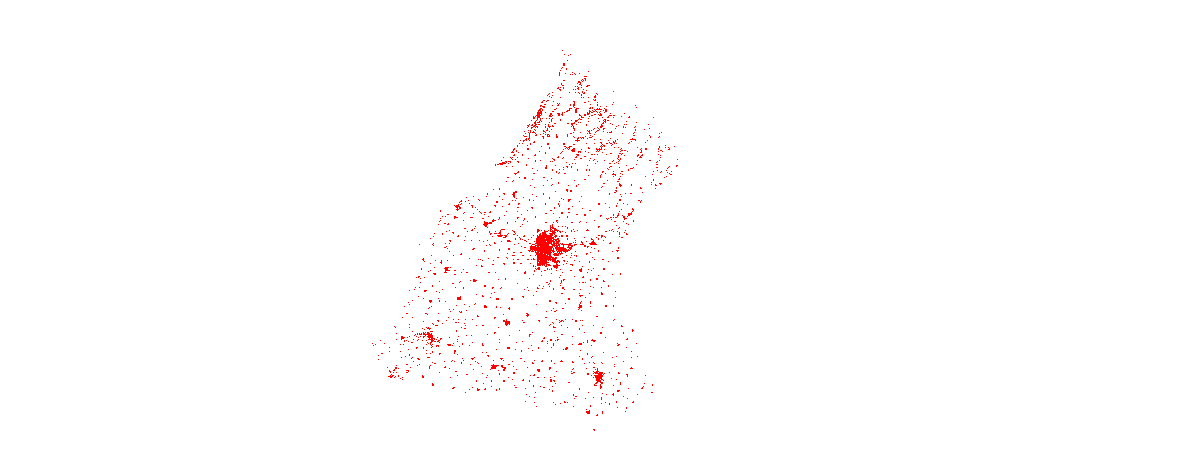

In [62]:
masked = colormap(mask(classified_output.layers[0],
                       no_data_values =[],
                       included_ranges =[0,0]),
                  colormap=[[0, 255, 0, 0]],
                  astype='u8')
masked.extent = area
masked

We can save the masked raster containing the settlements to an imagery layer. This uses distributed raster analytics and performs the proessing at the source pixel level and creates a new raster product.

In [70]:
masked = masked.save()

In [71]:
masked = gis.content.search('GeneratedRasterProduct_3PQZIV')[0]
masked

<Item title:"GeneratedRasterProduct_3PQZIV" type:Imagery Layer owner:admin>

We can now Convert the maesked pixels to polygons using <b>"to_features"</b> function.

In [73]:
urban_item = masked.layers[0].to_features(output_name='masked_polygons1',
                                          output_type='Polygon',
                                          field='Value',
                                          simplify=True,
                                          gis=gis)
urban_layer = urban_item.layers[0]
urban_item

<Item title:"masked_polygons1" type:Feature Layer Collection owner:admin>

In [75]:
m2 = gis.map('Saharanpur, India')
m2.legend = True
m2.add_layer(urban_item)

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAABM0AAAH5CAYAAACS+cnkAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P3nk6zbct4Hzp+smJC+KGZGJmYiRHIYJDiSSAgAAZAigIt773Hb793eVpvqri7vvfeufe+Ten65+t27z7nnEpACI305HbGiqqveet9lM598Vmau/5v9+vfr369/v/79+vfr369/v/79+vfr369/v/79+vfr369/v/79+vfr369/P/n7lTT79e/Xv1//fv379e/Xv1//fv379e/Xv1//fv379e/Xv1//fv379e/Xv5/9OWl2e3v9i+XmZm3X16sv5eXn0fu7uxu7v7/98hn/U15eP59Prdfr6HVi6+uF3d7p2ruV3s/t5nZh1zehrK9ntlyNbLEaqAz1XmU90udTfR+uvbldhnKj369ntlpPv5bVRL+hjJ8Lz5t5HagP9eL9dDq2SqVkjUbNxuOh1/3m7toG9ytbLvt2u9RnqttKz/l8N7Wn27Utbx+tf/fZOg/39vjjZ/v845M9fX6wh6dbu3vQff3e6geepd/x3JXqF+o91yt1HIe26f6r9USfzbxNtJ1ro/6gfaEdU/+Me0RtDNfQB6F/r9dL63XbNlOb7tWG2xv6Ru15MUYvS/Td9c21ja8fLDuYWrI3sepEbV/f2/312h7ul/bwuNS4qnC/xxu7udfYqp036ovpbGyT6cjmel0upjYZD6zZrFm/3/W+ZbyXy/mXufDwcOfP9jmhZ9/pHuvV3Bbqo7X65lZtaE8f7KCreszU35ofN7dhrP5RhfZcL0PRvLjV/W/VF9SVecIrn0Vt/4dKuFa/o+3qa+bq7R1jOvcxWSzDPGPcvszHn5Wvc1pF7fv5+uF/XumfyWRkmUzK7OnRbu/v9Rs9i7mjejyp38eLlV10V7ZTH9uF5my81rLqaGIz3ev+8c7u9by16nSrOXF9f2eTm1urjRd20Rrb2Whm6enSOgvW6I821Zgv7h7s7v7RHm/vNX+e++tFH9GHN2rvkjmpuUeZzgc2W1L6Nl1qnJdtL7NV1xZrzWfNb+b9jcYuzNmFnqH6aI5Pph2bLfp6r/WoMpv3bThq22Ix9nk/m428D1YLyYYbzRmtowe1g76Zaz70O30r5ypWyVWtVW5br9azfq1v3VrXWpWmNSsNa9UaVsoW7PzoxPY3d233045e9+1498j2NvbsdP/UiumiDdsD67Vb1m01bSCZNB72bDoZaL3PtDY1pxcDm6udi/VAddJ3M/2veiK7JuORDft9G3S71vfS0fuO9duqR7Vh7VrTuk3VT2XY7dtsOLIx13f0WatlnUbdmtWaVQtltUXyp1y2drNsxWLCUpmYpXOnVmtlbTit2mRes9GiYqNl2cbrig2XJRuvqjaYlqzdz1mjnbF2o2Qd/b7dLlqznbNaM6nfX1pvnLX+cxnNitad5m2w0H2WdZssGjaeN/R5Q89o2nTR8sJnw3XZWpOMNUZJq/Yvrdg+s+48Y51Z2iq9U8u3Dq3SP7PhqmQjlZquKeua/lzPmuWsr+d0Rjlr9rJWV30alYr6pGHJ84T6/8RKmYLVK2XrtGvW7ZetOyxYd5zz+jZ7CWsNktYeZ6w5TFl7VLDpqm1jzZ1iKWM7u59se+ej1RtljY/kzvXE5iv1sa5Zrnsao76PZbfZslI6a5sf9u38JGWtRtd6fbV5WrSe6rfT6tlOc2WPkj+z4cRGvaHGj991NIeaVi2WrZQrWDlftFpZ8031b/hrTX1d17ypW6dTkz6rWn8omTfitWw9leG09pMymtXVr02v42zV0XoJ/TxZ6DejosYwa5Va2mq1nMawaj3u29F3XemlYeP5d6yzln7T9DJbNW1x3bb5uuXvJ4u6jaYaW82Z6Vzjq9IflazeSlu9mbJaI23VesqKlUsr1OPWGec1XiXNh5LmVEVzS3PtWr/RZ91pwV/r/SvL1WKWqRxZunxoyeKeZavHVu1e+u8ma64Pc3KwKHrh/WhV9ve9Wd5Lf17wz/julwvffS2jpfptqTmuZ/Db3jynucf8o2Q1F3NeegvVU78fcO+V6qHX/rzovwntUn9orbCOru+HmicDK5Vzdnx8YMNxz+UVa6E7DfdnPrPGQv1LqjtrJvQFfTRSnajbTOtkprGYahzmkn3rm4Fk2sha7ZKl0nGLX5xaLp/RfJReQP9IFiLDr9Er0md3d8g0dCGy+MaWN3e2vn9QHSXz9dlan0XfXUsP3zzrjJXkaEc6oDBe29VwZQnp7Ib071p44A49o3sv758kb29d7/Kbx0fJdv1+tVo4Pnt6ktxfzCxfyNr+wZZtbL63s/Mj63Qbula/kz4Dk4C5ZgvJ97nm2GIoXRdwVFQWS+Ezyce59MBipb6kCNfMhGkm0hETyXZe58hS7qXvmb8j5Itkz1DzlUJ/jlcqa60TxlBjRt+HuRTmQ/g/fMb4RvMsmjv8Lvw2/P7lbxi7MCf0OtbnE12j+TCWXGXNTHi+1uGIeTzT95IPg4nuOQvXjLWOwlrVWK+FXZ9LtBaRn8Op2qLCdazv+br75RrW/VT/z/wzFfSk5BUYkHG7AQeDVYTDwBqufx0XBz18p/lzD+ZScb0uTBDhk6hEeIISYa2oRJ+7Ptc8+MPCM+78e/DMaNyx7kAySDJtPFNbNH4r4e4VmFyvyNvV7Vgyu2RniQ07TbyzfP1AsvrK+3i0bFh/UvX2TxbqA8nju0fVUXP3J3gILCtMsL6VvhW2n/v8aFuxemG1dlL3KGhsKjbQ2GV6ccs3jqX/z20+ykp21Sw9GdtBvWK79Zol+5pXkn258pG1+kmNZ0n9zZiWpTu0XiWnZit0Xk3jy9xoqFQ0P1VPvZ8jP2961htI1jfilqqe26Hsgli5buXJzJrCtxXJ5GzxSuv7zIqFhJUrCStVzq1Qjlmrm9Y4S34yp6cV1b1o82vmeNHKnTNLFLbsNPXWTlKvLdfct/rwwjrTjM9j5GNzmLbWMKPf5VVn6fJR2nLI3LzkbeHQn1Eon1itfikZk7ZuVzq1lbSji7f2Op+UHqtYqVewZScpjCFc0NUc7mdtPJDsHTSDXuoXtcall1Vanbx0QlZruyM52FJbcnYWj9nm1nvb2v7g8qBak94V5mHckQ0NPYPXkeQmn8+E7VezoY2kr9KpuHAr7UzZYbkpjCpsrN9NhedqdfVBJSvdk5GOS6hNR5YpHlkyt2dX2R3LlfSs5pU1uinLV07s/OqTHZ29sotUeKWcqJ3x5IaVG6d6/84OT1/Z6eV7v+bw9Ac7OHlle8ff67v3uuZC8xb9qHV2LTygecga5BUdyhrtaJxLtQu7TO3ZSXzDzhPbdpU5UF1OhakK/j2lN5Iske7uzyQr0L8UzVHuhZ5PZg7t/GLDTs7e2/7hd5KnP9je/vf+enj02kv0GeXgUG05fW9X6T078999VL9v2nl8yz5++p0lEvuWF/bL586skItb4upQ412whvru5HjTfvubv7Tf//YvLRb75L87OH5ju3vf25sf/s7+/m//vf3Nf/hT++a3f237u28tpd+enX2y45N3dnz6xo5OX+v1vZ1fbmkunQt3FbVm6mqjdL/6BIzSH1esJ9k3X6udC+m1a3D5xMf+4HBHc0JztVWwTO7EDnXfHbXp8OStJdL71uikpceQebqX1tl4JZm5brp+BaOwNpCnM32+uJFMlNydSu7WmpcWlxzZo/9i3/p4M76HJ6/t5Py9ygfbP1IfHnzn1xzFXltC49bRfJ+pjpEsxV7GPgu2lmwVlZWwXbD/lm5fwB/cSN40msKfDeEIYc++ZF23V1E/C4c181atZqxUSmmN1azVKluhkLRsLmFN8Kb04Fp6Hv1RbSV8vl5l9lWv13Zw9MZO1BdHh4z/9xqfD3Zxtamx1hwvH1u9l7RC9cQu09uay5uW0xqo1BOuk6aSP1P6Sv1BvxQqp3Z6/tHny6HKscY5cbWjftrWXN3SMw8tdr5hh7EPdnm1Z4XimcbmSvMePdVxXHNzv7CHpxvp+onmwbFtbn6wo+N9q1QL3o505lT325WtcaTnIcfijg2LNeHDmuSt6tpUnbuSt+DynvB5fyLcJdnU6Er+Nc4sXdD6uXyn9feD1uKm+kS4cCKdLBnbGeQslT/QmvxghxrT/ZNvNY7qG4r6iLYdH7613e0fbDQCS1dUzyPHIxsbHy12KlkuDLy6GUtOo0taaldXuOXMjo4+WCZ74rbm+cWJbe1gE3xSv2/LRpCsqRU1vsJuXfXnVLhfcisjGXVytG37O+9sb+u17W6+tr3tt3YgeyKZOJe87Mh2qkl2trS2h9IxU6vJtk7LfsuNxlaead7ILu0uF5p7su96jf88aUb5JSX98v9ISUefRQoboiB6j0HclMER/d6Ncwx9J4AgHlCokEyAMgizZzCmsvTF8TPi7CaQEHwGOfXTEhZOKLrvM9jgesAjr5A7w2FfgyYDWoYzr/cPd7YA5ApgX2sxLlXP1d29PeoeNwKytenKkiN1oO539/CjQKg9E2cCwg/qCwGfO4Hde117LyAEERQBBdq2FugIhCBgc/CFDPRF78AaskX3uNe9JAQAqxTaBOnGtX9AmjEGKt2OgLz6+H8PabZYrzUpVpbqjKw6nErYqQ536h/VH+LmBiIUIKfnrHX93f2dPerz1WIuw1HCcDiwkYzUsZTpcNSVYtXiHw8dpPOcaF784vMZf/XVzd1MbVW/zFZ22bu1yzGTc67+01i5cfHT3/7R4gLyp/OS1zBHGIdAnEXf/0Mlms/hd5CttF/fPYM/xiDMRcbhl0s09n6t6hHdm/eUl/VnfeTzWfsRQ0djgLEFScfc/ax6L2/uLd67tveVocUadTvrjizRGcpwmttSdXWjR8B3rr4frm+sOltbHMKsM7PyaCnhfGMPuu+jrr3GMNO8vtV4XgvQru7UDn2+1HxlnK/VlyvmEGtB7VirDU5sLQSiJawAurNlT8LsGUiwPm8mulbtpY+Zg/qt9wPt15ydzQBcPT07rPHJFEJqoGtWDrC63bYNBwPV8d7L3Y3WkOrLOKAAR4Oxtept6zZ6NmiNrF/vW7+qUhPgVek8k2flrAD94antb+7Zwea+E2Xxo7idHZzZ4daBxXaPLX+VtWalbM2qjKVuR3NPdV/N9DwI84mEbd/GErijSccGvZYNJEy5btTVs9sSxA3Vo9a0drWuUrOOXquFqp0dndr58bmlL9NWSAvwCHj3WloXjZbVShXLpTIWPxEIzmStki+pSMBXEPAVAeG0VaSM6z0p7ZkMEIF/DAcIMzcQIQUEtJujlFXbF1Zpxl2xDfpVGwyl/AWEWt2MlFrS6p1LKbiMjJu0lEBGikdGo5MYBRtwbwf5khcQnlK0X4r+H60FIiYZa45TX4izwSpv7WnKip2YgP+BPhc4hTRTferdSxkVcTcCBgsIi4KTXo1BypoDGTlNKaNa3TLqk+OdYzvalqJO57zdTQGYZkdjIdDc7F1J8Z6r/TIOpJzbUtatUU7zvmf9UcOSUnwox929DZc1AHqMdOYhBulCQHmp/6fjgbXrDWsVavbhzZYdH5xbs9aWjO8J9AsYznK22xnYVk36qTv0sYTsLGbylji7sJODYzvZVzmI2eVJ3AqpnL5vWqNU91cIQMizRq1srUbJlXNf/T8QAO2rfCXKAjEJaKevWSsjAfq+jL7uQGOqutSbaStXIczUD/WqlQsFK+eYNxXNcxleyHQfp6+EGe8BohEY7Y9L1uqpD9WP1GE80e/GjTCnmjIEq3mrCEyUCirFjJVlcHX0m57ATV+G5VhGZUReQKpCFLUFkkoaC0iyiDhLFvedMMPQC0SFrv/PkGaQUZQ/TpoFgiOQHV/LSEB7KAAZSI+81oLm0Cz9XDLWmev/Z+LsK4FGgaCDGC7oPjIKnNTV/VXHhebQXGCyJvB7cnJsE8mbpYyCIUaUwGBfv43qzitEC/1AoU+iumFsz2U8zWQczNRnlLkM8qXGAtK2P2wIZMugPdpXX6dtLsPyPtLlki/XrkekW9kMkgxGzl0Lc6wkL691Ddfd8SqZGTZrkL/IYr6XLJRcv7m+t8H1nSVl0J/1BlaX3pxf657oK8nyCN/8RIfpfz6noGumU+mOqzNfS5RU+tJJE3AIsnm2kKyGMFtqnTne+Iqt+B9MwsYC10Gucd1sOXIiew6ppmtYn2yGoS+W10Nfo8ibsYwEjKpQtE7WmnuQHM99z9xx4lNj+NOCDKToOr3y/+DF/GGcIG4isrMzyX8p3YnmxPOaDGvomWjW/HeijHFmU4HyTJrxPddFpPXL4gSg7heVr+sykGMY7dMlpJEKn8mAx4hfaI4s19KV1yPhy6+k2R1Y0QlV9F3QeT5HXnzGeydRnzFEVF5iiJclwl3R+P9S4bs7zcH1eiV9PJQeka7THJ5qTDG+IEKXjKPmI6QZY4kRU2ulnPQo1A+ljy7U9zmNZVVGcuhfyMMxxs68LywAjviKmbwIN4V7g1cG6ivpWhl96fyJFatx3xAaa92OpKsqnTPLlmXw1U6s05dunGQtMyjabilp+42a5YU3Z9Om67yR1u1UsmmieTFZVp28gjhzYlRjOphK/mvNDjXefemovl7HK8lRzcWh5lxb+qYqHZqXLj4QvjhrDS3dG1qp37NqR7K/Jz3Sb0nXSqfJcKeekG5BFkM+hOdA1DX6V3ZV3LHDi1e2e/p7O7j8zmrD8yCrXE4VbXIdyOIBellzb6I53RkkZZAfWbZ4IEP2xKqNS98I6/QgwaRvpOfZBDm/PLT3xbLtNqpWbKds0YrrO+mUkbCA2jEeZGwobDCUTmh3cl56fa2ZEcZhWeM/tWarZjHJw82tTd+QOjjctkol7xuZrPHxpO84DX3bH7S9NFtaG9OxXcsgn/Sk19MXVi4lrNiq2FG1bTH123Amu0C/gXyDbKnUspYrnFu5rutq506aJTKbMs6PrNJIOkHV6mtci4d2fP5Gr/v6fssu05tukPNalB6Kxd+6EX6e/GDJ/LYb7Ednr20/9r2dXn6wRiel8ej7nJprnc3ZSPM1GUizsG6rwhsZJ86YazXpQ8aRzTu+R39DntXbGau10xpH9ZuToZo7qieEWipzLMP+ox0cvVaf/eBEAAQZBUKAEv0fkWb+na6PnX7Q9RBqb+zsXG1L7Nl/+A//k8XPdixxsW+He+9VPti2DPvNjVd2crxl6auYnZ/s2J/+239hx8eQJTt2EJPhr2cfH360D+9+Z29e/Z3tbb+2Qu7MybcTnnP0ve0efWu7se8sdvbOCuVTG4zLWnehX4ZTrdc5+AJiX7JcenJx3Xd5PZ72rNWuWaGYlU5Lacy1Rsd1jeWlpbJ7mn8bGqNdH0/GrjvUODcSVtMYdCds7kq+Q6ILa9Q1P/mu3lZfa162e2lhIOGR6qldXG2obuqL5HuLpz5a7OKdxvStncb1/kx9cUxffW8HB9+pTW+tVIlbT+sAvLpknKWHsMNCeba31rKJltigyE/sQoizqW8KJNMndhbfsavUoRVKcSuXLzSHj+0qcWAX8T271BjUqpIBuQs7Pdm1o8MtSyW1brXmR8JWkLwXqW3V8Z36943tHry23X2Nucb3SOMB0RW/2LB09kDtO9McSli5fan5um/xJKTXrtZBkHG9kXTPrKz5JQw3SFupfmZnlx81P5g73+t+r7ycaiwvE9vq9yPLFSUPi+eWKZzKZshqjUr/aBx9wwauRLjm5l7289O1ff58Lz1//oVUSiYvXOf0++DDqrep3dba6wg3anwHwo3VhmR7Zt/ShX2tw4Pn133LlQ8tWzrwdQlhzRpk04T1msrvae2xjot6zUiOC+dDJscgtTV2kGbHYZ3s+VgG0ix29EGyu2XNRlGYadc+bbyzjc2P9mnzvSVSZ6pPUzpnpL4qWbWeFE45tsvLAytXkvp8prG8sJ29TcmvD1pbuy6f5rJRccjoD+pWl9xJJ+N2tL9p+9vv7GDnrV61brbe2P6OnnEek21QUR0m1mlLl8NdrMFb97KXltaSbT0UThusVtbs9zX3yloPabvSfHDS7KUijspL5ftLyvjn1738n4Ji5nNeIaVarYZ7HN3f61oBSCZ4IBh4ZdJDCiGwIZQgzDCGeP0paRYWB4QCyl9g9JnACPcLrHNUeA51CsRZAI/sxFKXyBNqOOxp8jTcOH8EzN4K6N3ObKrvFndP6tSFjMalnTV7dlRvWmspILF+sIf7z/b09Kh7rl3RjEc9uxWweby7030EUvU+1AHAEMiCr150X0mzW7XdwbXXNSx6QOxESgtCynd9BEa5zr2PnMRb+vXez+vI02zixAhALHhJcU/qoPFgfBi3F8TRdLm0jerAcr2pQPLC7rnfg0D3448CvJ8F7gTodZ/r+6WtVwt7vL+z2/XaJgMZm+22rebsKMlQhUxRfz18vtFCffBn81wH6TwL8nC1tDsJMYiQUK+FexPdP6od9zMZemvbqU6stLy2yXMd6cdoLv1D5U5z6pZCW58/ox7usUWhP5wE0r2jPmB8BFipF+TYF2JN/XDPPamng8vQHnZMfV5539OeyAPtZaG/wz2c2GWuMl4877lAJlO+1F1jM5tNrFjM22cnzSTsHzUPH7SA1e93eC3c3wsg3th+Z2FXWtDN+yfLjOaW7A6sNJYBqDa0ZmNryJgqDueWaI8sVutZaXFri/mNPS5X9qR18qhxelR/PHmbBYZvJ3b3WWsGwljgea36XKsfl9RbbaBAPK80J52svdd7PMWWeBMEwwCAfe3Em9rnSkp11z3WMhTncxlTcwFwzfsZXguaxzN9NhVIX2odrVQ6MP3drua66najdSUj8EbjslafYzTeqcxnc5uMpjboDq3f6tugPbROtWu9mpR/S8BO/3cbHevUW05wVPNVqxfr1q13rV0R4Gv0LX2Rsp2PW16KmayTExBh6/ncHjQujPl8MrKBwHG7JeBbK+seRatkc1bLFa1drFlPwLBbEXBWaUOkFKvWKlSdKNt8t2mf3m7Y/taBnRycWDwW13OKKgVLnF7Y3uauvfvhB7s6j1ulIPBbKlq9mhOQrQrcS/HdCmjcVK2PkTjL6rOyAD3eFIFo6EwFPmtS8LkdB9YD/T/BGJzVBE5UPwCJlC9kWmcIaSbDQAB6IgNkIKOgq+u7Ez1Pxgg7XPNrjEDGUK8y8niPUdrC02ucttZE9xon9VkgzUpdGTWdmLUnVwJE1DEvkHThJF4gGwph93ycsvrwysmz4aBhLQH7RqWu/s/Ypzcbdqq+KaRTVivnrNHIWbOtseheCWBcWL2bkPGSFpDAiMlrLo5kMFR9B9yV4+GO5hO7i0vVu696s6uMF4dAlObhTCC/Xa/boNK1D283bW9XwLys/3uaI3iFCaBANhxWpBCLkGEVK6azdn4Us+0Pn+z9D29s+6OUrMbqZD9mmUTa2tWWezd2qppftZZK3dq1qp4jQ50d+JGMpqn60b0p1Zde9P+sLaDVlDJuSok3rNPRnBRAqFQ1DjJciiWByXLeWvWak6qnh6d2fnhmqXjSvRDxWBwKqDE+APoxO7YLvCcwTmtaNzLy6ldWrgqs1rMyjMq6r+Z8R/NSfQ4ggBjG2w9POTwca82ctXoQbQXNkaIMTV0vYIvB2JDBBjEGCVpsnlqueuxeZlf5XbvMbjsRCpkVSI7gERYRHVHhf+aAe3DJwI1Is+i7l2TZCE+wZ8KDz8L/GisZuRBXEJxd9zCLSDOVueb4XG3Ve+ZkayIgrle8ISG/IM147UOmYZzONdfdWOqqnwp2enYiGTSTfIM0qzupAinzlTALcxiCGRKG9n6pr9qLhx87wjPVdY6HHm3SXGWnHYDXH7YcnB7vb/v8XgoX4G3rJIGAe/AYkm6QHv18/6AiWS/Zei+9/iT9/sQuMXjgQbrkUfJfemApPfp096PdS18/6Pe3DzfWWa0t1hzbaW9p1eWtraV7PstQRK8+PAa9uRbYuxee8Y0SrZe1fnsn/f4gXdLWHGFN7exu2KEAJ154D3oe3vmATjAY3gZfMRr4CV2KQTJxcBo8csO1C7z6nSwTDgPPQZaoLdfCUvTL8lrXaJ1iSI0grLzIEMGDbyXQ7iXIuiDvNJ8ozCu9Mjajtb5XYTwCqar3C2Sb1qFkGsZHd1J8LpJ3z4XPp6uW1g2eIsi8QDizKz7QtRBnw1nRxrpPIMswQiDBgmcJ8ycirQMBjnENQYJXZyDM2HCAKAveZhifwncqeJnxGUSaGzVr9avm3o3wKnMBj3v0zk8JsqD/rq/BMHwXPgtE2rUwFNdGOFzzAWzi91ABszy/DzgnzDf3wPfyPP8ci3DdnRuY4wnkCDKr72OGF5h7l7mXxkLtG2qsB9Zo5y1fxlBOabxYNwWbXldUgpEMOYHXSl8G9mQOURi88SlsvEUkLPcC/zJ/wBEDGX/J7LGMwRP3XBlqzIYau2b7TEabjFwZnfm6nju6kmw6sI1S0mLC7A3J+5HmK15ac0goPAuneSfLZteqAzLFyVHNHcmVLvMFMlX6Cf020DgPNf59yPlJ2TpjzaVx1lLCVif1tp0JTySFNzKdkXvu92YyvnnetKn7yODyTcOG1kBDbZGs1zNq0mXp/IHFLt7YzsnvbDv2Wzu6em21vgx+ZBObS6rnyGWK6iP5gVdHR7q725cMbsjYbsqw7qWsN5C87mTdEw6vMUizeiNjmSsZg8Iee5LpV3X1V/vc6qpPTVigo/oPdZ+hrh3oN00Z1+2u5Jn0H6Qo3vMPkgPFUkEG6ifb2tqy4+M9yxdS+q7rNkpLxnSxlPYNxLCpT+TLVLqrbOOhPpNcm0jWZfNpJ81a6Ohaw/ZKTasOO6pnx4qSKcjcehOjVzpvULF6O22F6pkVayfWGmgM+hDaNc0d4S31G95mleaZ3l9aqX7iBjvGe7V5rvmxaxfJDbuSLsLT5fjsrYz2t+6ZdJneccIbwpeNNHCBe3ZK5iyuWX/BKzsqgThn84P3eIxK/swbTow11N/VZspLo6e+GwqLDNSOVtrn597BG8nMt06Gbe9+EzzJDgJhAiGwvx/IMjzBAnn2lTg7Pn7nvz08fGvn51t2dXVg//7P/7UTXx/e/t7evf57J86ODj/Zn/8vf2Kvvv+N5TLnlkoc27/7n/+5ffr4O+mwj3Z8+s4Ojl/bVWJPGOLCGvWUNRtpvaYtfrFjZ/ENO7v4aGeJD3Z29cHiVxvWG+a0HoNMYxMPcsztUMnn9b1s6wfJJC8La3Vrls5eWbVWki6SzaJr8KyeIrMla9nobGh+tgfCbnrNlU/cey9bOrF6L601WLaeMGm+fGqJ9J6ev20XqR1L5vY1jvvubZXhfXrbS7q0Z1eFbTtNqO2nwdPs+PStHamNh4ff2yGk2clbq+BVNa2pHRpfjfNUeh3eIPKIRrb4hhPyU/ZMsAFlX2qu5vIXdnK65eO3u4+H2Fs70FgdaSyODt/Zub4r6pp+p2LpqxM7Pti0o/0NS1wcC1/hLZm0RHLP9o9e2/b+d+5xd3q+aSdnn3Tfj3ZxuamyYYVSTNgsIxkhzC4Mnikfa15v2tnlJ4snNi2l9kOascnNRnm+dmrJwoHPYzzqdva+0dz5JpBmeC3q9eJSdSvHdV9hjeue5qrmrfQQ75fXRP5ghw2ka6WzhR+wVR+fbtXmtDDzrubkliUS51rDc/XVxCNrusKuhULGstmUsKnkgta6e5/STo3ZSfyjE197x8EL8Ojsjd5/Z7tH3+jz7/Q/pPUriyc/aV0cWqEiWV2I2UHsre1AkB1DmOFF+I3m6isnzFgDR8dv7SK+bYX8uWzTnuZv1vb3tmxr+5PWiWyozXfqg0+WLSS8PW3h1VTm1ArFhG+0tzU+tw9LqzVKdnwiXbAJEb1t3Z5096znODiZ0jrdk72g++xtv7e9LQgzrbtdza89rYvYrtUreRv1u1ozkovdpuoycf7merkWpp/IrppKPiwkP5uWiJ/LrtuwbdVxa/vjP+xp9r+3oNCjXU2UM140eHZBDLiyFlj4AsQAWCqRJxbkGMAieGM9e2QJkPli0PUAhIh8CKAikBBLAWGUMvcCpEJgRIDBSQrAnoR+8MRaOcmEZ9YdIFT3BTCU1YmPD49+DZ8Tjji+u7P0cGlH9aHFmwMp2rkDzy8hDwKoS3V2tZiz+HnMXSIfn0GrgxLAo+pE/UNoA7u0hDfg/hpIwLu7hT09zARwpzYZdSX8KlataMG1m1aX4V6VYdXv1OxB13l9JRR4DfVUHUcCPAMZ/wLVjwLieLtxjZM4eEepHdcC2qu7tSZh6BMmx1yT43VlImULAAPACcwIWN0C0O8/282D2nA/F+imbgL1+n800qTstWyle07wGnpSG3/UdU9zW90O9WzcYsOzvY6QiEtCoa7t8RovvBCe8qOetWZHS/Whj8vThe2mZZzLGFg9PoWd9ef59H+kMAcjj72vc21pK4wRPlc771Sv+/WNfdbzlvp/qf69ftJ8oc3LmYdvPQgwsvPvpKy+xxi4U9/erzX++v7LvdWOlwCX99E8h+ClTtG8jd4zhxgLiGQPm8HT7PZHPU/j4WEZGjP12fJez9SzCQ3MtSd2Nrizm9WdTe/uLT4Y2CsBp1ftnn1TrNtBe2Tx1tBynaEMC54dnuf98QVos3ao78v6RDvZUV9F65I60j6u01q71ZhpfU4XEtx4j0lZAawxyqgzxKWDdcKKCWMFXM1HAppDGZiE8BCeCQhb2Urva6WMVUd9a65uBHCf7PP8s/04U71lcE0fl7ZQnR+vn77UnXrTb/O51orWL96iyBY81dpaL816wzqtrvU6feuqTzpNAfK2gHl/Yp1618mtnY1d290+sFJOhlerZ/PRzO5WMjynSxvo/2YZ0q1shWTOznalPDcP7eLg3EpXMsCqHWvkatbM162erXrhPWGHrUrDKrmixY/P7OPr9/Y3f/W/2qc3H2z7gxSBXrfeb1j67ELXZtTuvLWaArXjqgM3wt0ijwsANbvl7JoTbhKVioAjOz+Uaivu1wyfd6kD8M67wVGqsauX8v/HMhLGMkz7Mgrx3oLIgtDACA0hnyrsxAs4suuOIRoRHt1pxnqEZk6vrDlKWGNwaY1hQvcQSJchC8FQbsfdK4n78ZvGKHioQbZ1prpO17S6qldDxkS5YZnLrP3w++/tZP/Aium0+qxmvVZb18ngmFcEtCQD8FAT4O8N6loDSymtih1LyW3vfBBIiUluTTXPNDc0D7/uJAdjdTLXXOjJMG/0pYCPbfv42K7U382yjCYpxoEMhoZeq3puu9BUfZJ2tLNnZ4fHlk/pukpd8wTvs5a165CwXb1vW6fWt3a1q9K2nr4faV51K1Vr6z4dQnIJAW12bTpo21jycdRVX7Yaal/FunXNS0grzStKrYAnWcdqMnrwRixni3a4vW/f/ub3Pkc23m3Y4c6Rnq96tAi5VLs0Nj31JcTR+BrDMOc7x+l0zFr1vE0kByDFIII7Ml54JoQg3pC9hupX13wtyuBSqRZylksLrGU1no2cwMeVQOyhgJ2Aalzg9PI7i6fU15fvBXpkCAjMJbJ7mic1J5LwkJje6L6zn3poRcSZh9ZqnjEfgmcaRFrOr2OO+5xTISSUVwgqrhtDisgAH8gYxyMDIszLQqDumSSj8D4KGX5Zvlyv0ltkZZzmNN45yayh9aXf09mMXV5dulEwu2478RKejXcaRM3XErXl5WfUf3aLd0hoL6/0hbdBRtdo0ZSOHUtHzC2VSgqo7jloJZzxTvIMPONkGJs3krUhVDNsKiLbwBMv5XS0ufLweG93T0+SwchpcMmNzR6eLDda2Hm9Z9Wx9LDueX8LdmrrWrDBvT2sHu1HZOpK9xG+WHzW6+OtcMST/fjjZ8vlMgLnhGnKABPoJAT98YnnI2dD/fBCinTES/nLhiOvfEe9IdzQkbQVMo3UGisZZWA590STkTYXsA+kU0RAQf7WJceqklOaG19kXdFmkk0QkiPN+SFzSK8QIkMZbBAgGMgYuvye0J8RhrcTWBiFyAQK5JWMihsZzjcyltfhmdH1L73Egvzo6lq8MAJRFrw8IdlC4TOewe+GktuTGSG6MlaeN3bxcsGbzL3KIPJ1n+g1fCfMJ8wU4YWoT6PxfllezoOXhXDdB/U3fc4mH7r3BpwHruV3Ko/Cp2DgSIfzPHAQuhwc7BtgmleR/mfzitQDYJBoPMMcADtr3i6m7s2MhxMeGtnCmfeT95H3XdQ3Db02pH8uZVQXHCNMfS4QTfEVg7u3om8aMzd0zbyjPpWxVk96mBzheowzRFKlfWWFhvRvdtNlEF4qg+GpnXTqdiw9n2jXLdfT/GC+XH8l8VmbQfaEtRoKnwVPxNYoyKeJ5BE6ktAiSDDG1tui+cFY9tUnyf7C3lem9rY8stRkaiMZcmvI16HW/0xjuqrazUz3GZQs3T61w6sPFtt9Z4f739he7O/sSDK11DmTDk16fea3mveQxdK17b50cg9CSXJIv6d9lXpchuu5NTtJG2qe8z0bJN1B3gshoYXSkdVqKTusNmyz1rKKfleaJmzAxkb70jrdhGQSOrRkjVbOifDxeGAXFxfSKW3NlTsZoTlf+xiqVzKo5zPNYenPTidvNY1FsRQXvgphTvPZSHNPOnd5a4Oq+roPVhlYbTiyaV99NZQ+quZsP1+1Q+Gt9nQuPLG0ufDkynHkPBjlksOTGZtLwetrum4J74A/pI813lfZXcc2hIFBmMUu3trJxRurNi9sMNK6H1Wt05Mea2Usr7lCqOMepEJiR/cNpO1Xgix4GnpZEqYb0howd1fX2JZa55IHU8mQ6LuQ8gDCvKN64wXJ/TpGKF2ZsM7ktu0fvbLtPY3t4Xd2QPggpJnK8dFrlTdOwuwfvBZe0feHrz28cHf/Wxn4b/ya/V1dv/fajg7eW+zoo/Twqf3P/+P/YH/2p//STmMbdi05RF0+bn5jr9/8ne3vvbP46a7l0yf2n/7jv7X3b39jlxc7tqP7HOp5eK7FLwhPi7tHYb2R0vhdWQsM2JM+1Byjr2lbkEcQi4FkeZD9di/ZffsgO+3znacawksJspsQe0gL995zeRrkIht36O7xuiFcWbHWQM/Us8CevbHw6EQ4pZ9xTzLIPYgiSORs6VjY9dAJTgii0/N3dpXUuk5sWOz8rcXieJm9toPY93Z0+r3tQ9Ds/179960dHePBtelegBCey+uOF8aQudTqEHaZs36v7vYaHlU4NVyrHaS+2N5+bbETvCnfaLwCkXlw9L3f+zj2xg4O3mptHGi+N60n/HgS27e93U92drZvxWLSZV82f2bxy107in2ww5jqLnlEyDEeiw2tya5vXLNhnbJW70rz5dSu0tsWO3vrHnORB+LR8Rv1TVz47UzzSfc70RpUfXb3mC94KlK/b20P8uzglZdk+lBrv+TjF2SuxkJlrPk58XncFc4hPY5sUrX/QbbY56d79UfHzs9PPexxb2/HUpmEnrVt27t4mW86AfTx01vfkD6Px3wz7R47f9y1TPbMicv94280XqqbxuDgSHXVfNvVnGZ8js9UV/9e/Rn7wXYk8w6OfwhF/x+e8Mp3mquxVz4fEql9DyMPZOfIrq4u7NOnD8JLuxqbTy6TKKdnh5Jj2ACam5qX6KJg73Wkz9jo6Wn+XGhsN9Sne5JbhKKXLJOJWSy2afH4vh3tf7TL8307i23bwa7GbV9zTdeWS5Kp0h1sWhMaepU8tcTViZUrGcnFlD+fcPWT0wOtsR1/Tx9tbGyonvv/dKRZBK5QurwCqiAE8DLDqI2ucS8xjHEvwUsshB6OpVSjfBkAEdzlIMxCCGMAG0HRBwAZGdJhFwtiinsFooprg8HvRZ9zDR5d1+p8CKmFDG925gi9w7OrK2MHhXItQPgAsFXBNe+81rH8+Npaq3sZLMFLDkDjwIV74xm2mNjO9icb9AVaHcDgeXfjACHaXYvaGhU+i8i0wUBGTlOGpyYJ+Z0iwBQ9YzjsavEXbQkp5wtCgPt27cTfoI9Sm/ju9a3qt14Gwop2OVhSCV47aqsAN/dkd3O6WNj3xbGVJwG4Q5qt/HefVfc7CSWBY9X9QWDnkfuonRATrVZL93iwR8itleq4WttnjccjIO5ei1ZGyZ2TS+r/ldoISKMOqs9K/b3Ss240L+a3t7Z4eLTR3YPl8ZpqDa27vLal77YKvD2TTf+Hi57p8+C5MN8AmJA2N5oHeHMRhjgcETYo4+SBvllrTObqizvNjTv1mfpT91prPCjuqaY2+LxR8Xv6XMO4CHMyFL1/Js0ojGe0PqKxBbjS7xFpVpAx++P981pUPR243mj8Va8HGVvT2dQynYkdtCHtGMs766+vrTRbWXFxa7XlvfWWDxKk9zIKbzWWYR3+vPBMSrSW+MzrpPEJ/cRaCfM2zFXaCOjGY4KcZoBhCoYCOxsQZrqP5iX9s9J8xcOCubp6JrNny7GNJuQ0EwhnrbUbTjTP2y3VeWGp0djSXQHQpQy9WxmJj7qPE5gaE627kPcl1DeqP/2HjPlixOk+15CuC32nNcB75udqofU9ntuwM3CSIhm/su9++70lzq6sXWvbuDsU8Btbt962erEavMI+SVC++WhH23t2eXJuxVTW6oWy1fIlK2cEXMs1a5RqTq7VCwJyECOQFpWq1csVK2XzdnkWt/PYiZ0dxfRe98hkrZhO6bpiyFk1AdhJ6Qm44Q2Bdw3eFpOVwDvvn41I8grghYUbNLuukGedYdoJMwBmCO0I+VRwgyf0AACD95nnWxFo9B1tGRMYEhgLEXkWctGoLgKY5KHA2yeEOQUiA4+d7iwtIyPpuWtao5T/3j16ZMjimQRxhlHiZNuMovtP09aeJK2n0hkK7PfrGvOO9382kbSPb6SAtzbUJ2nrNNV3MrJ6AqYdGQUUvKtuBAJQqoS8EUa2J4WXzqakGyaSTWNdE5Flz68yXpmX5Mob1ntSnOf29tOWlPWJ55WbjQTm+y0r1SuWz5UsG8/Zm29faR7ErVYkXBdvLI1lq249gYfhQPcZttxDrNci3xkhmtUQkltTnzb1XRXCNK925Iyw0A4eaPoeomrY7tqoI0NBRkRNxkQ5U7ZqTvOjUHPCjNDP+PGp+kEgcnvXaoWSz6cdzT08FhvlhtVrmgOTtpOIZRkO1e6F5xtj15YwkUYta/2Wnlfv6N4VzdULOzs8sdyVjMJ6y8NJmZPMza7qVC+SF1AAs1SyWrlguWzC0pkzS6aO7PxyU2BVIFxgaA8g5DljfvDd/1rnSvOkLrCseeKAmRDKQCoxDyiRwUp4LXXklf8hZ0PoLkQU18j4eRH2GDy5+Fz3WJetvyxYlzBMzTsnymZap9Oke5VFJSLQfl5ekmc93WMiw/T+cS5Q3bDLq4QMrbxky8K9nKgLRizzPRjVX0uo609JM8pLI5z3FCffppDPTRmJA9+xR17mcimBrkP176Xm8dB37MEmeNqHHJ+BGIn0QCSbkXERhuI916yEQ5wsQYdKvg4k/+ONgV31V9a8frDZ06P05tqe9IxAorDppGdI/n1+0L0gmR1j4TGO7paOEGZIZ64cPGM4nwo8Eo6FFwp1Wy6D/o30VSRzeeWzl5+jN0KuTzBcyNXqXmaEZuL5wVpViQgtB/0Afsk+vB0hwCAukFkUPIfw/gqhkxBnEGjq+5kKfQ1JidEtAyIqIZdR8PBCFuBt4sWf1dJcgAwJZTLHa4K6cD1pByC0VHe9D6GJQ3/vRZ/zP97VYxn8o6kMaTysZUwSaolHnntNPRNnISwMmRS8OoJs+kPSLNJn9OE/uuh65gHYwMMmpVtd/zLmuiff44nGRvBXjBnpcD6LMHF4PrhnsWTc2LAGO2tswUbgZH2HV0Kv35SsOZHsPbF88dzqzYzGrSU8pD66gZQMJCF9zJhUGlr7vYKuwZij3WyUBUwRzQ/6jbnhZCPzQ6U7lGzy32Z8rElR0JQMqbROLVs51Ou5+rPi6QsK/YrtS/4ekCd09HUtsi6jtfvz9cv/Hq6r+cQGEvoK0myouRaRZuSnm2heTplDtxPVYyA51rGKdMdJu2eb1Y5dDMbCXcLb120brWXEQdqrbgUZ0AfJ9/ZJ8vNABtbxwXs7OntnJ4ktb0dXupF6REQdfdUbQjBI5/XyMiQhxFJWbVyE0K5mwgZj2QR96dQXpBkkGmkYyIGZVR8cNxt23METLSM5RyhmWoZ/xsOaGm3J4HFVYz+zSqVo/+7f/Tv77//7/7eTZ5PJ2EM0T0727fLi1DHbyr3M8jIchTFUH7yzx9KnU2E3PDHWK8mU+UzGuHTgsOGYb6z+6ek31br0WbVim/WusILWAzYHeJoIGc1DZB9zAC9DiPSl5ACk9fp+oP6oez67QhXSNPElFCyZ29Znh2rHpYeqNtuaGxNC41v6LGnFyqll8scetgeRHeYickYyAUyzxBtYBXJeJQq5jnKeBW9S5EcIr4VQ5xpkE2V5gyek/p831I9FyxWP3cPrEBIHz6GLT7a7+52Hmx0cvJYcJZzwrRM0qfSRrtl2ooBQyp29b+1gn5DLD3Z1ue8FkqzbKtj33/xH+93f/3v/v98ravwvtd5i9ne/+XP767/6H62QO7dqOWG/+ds/s7dv/s7O49se6sl8YA4xd1l/eB4hb8hxBYnNhqwTTGqHeyNpXrPxTQhrs0NuWNmaDxBnkhkaq8fPkGaMGWH1sr117Uo6LWwWsNFAmLPWGZuxq7pjgr5kMaF5Lo+FNbvDnGULR+4t1mhLL2u+tvoZa/ZSPm8L1ZidxN+pDyGQfgivZ288n9ke4aSHgYQ5JvQWLHL4rfr0O7X3ve4dPMd97DSOY61XIhWuhF/O4ruSU2eyT0ua68IPHcmTSkZzfd92dl5Lz5FrTuN0GMJqeS5lR+PHd6lUzD0ti4WUxmlLv/lg8fih1RvkAdS6AqMOpOsHkiN4ivUlm8BkWqdNrTcKWOn4/J3qrnX/nJeN/HM7e9/rmW/cY6xQOtXavnLijLxiF1c7Hu4KYQZxRlu9T2KvnJzLF8/8uXj6IWfDJsVzQbf5OuI78hAGL2bysWfSCRsN++5JtrX1Ue1Ez297uKYTQJuSVRvv/H/IM0rs5MAajbIwwLWVq0mN00eNwbcal29saxdCTOMUC96dRxovyM2DGF536stn0mwXj7Ioh5nKwXEYy5Pzt3aV3vV8buNp054+r10XFApZJ/Q+fnxvHz8xNtuO9wkZB5NcJeOOo2KxQzs+PvRrycnKd4dHe1p/W1oPx5JdmtOtrN7v6LO3uu69bXz83sqFhDWqWUsmYra3+1H9cmkD2QGNeskdnXae075AjPHso+Ndfw8m4jnkUabwvKrwf6vV/KcnzSgoZQrvI28QEtFGihrljTIPJZBHX8IXl7ha4mEWwhcJ3fxKhEVgg+dooQsohntxD8gpDH0IqoikgphjlysQV06KrOaeA4yQQ0AGhfvirVaTkbFeQBIBFq9lIKztotKw2nRtg+t7W+i5ANe178QCYgUepRwgzVA81UpBYHTs31E/wEgAJNRHz3NAK/CpuhDaOBh2pDCJ/ZaxN+57HQDVT0/3fm/ALbnW5su5hEPLWs2qjDkJRSlxWOR2S4JxOvY2rNlRXsIyA6qoX3gWINoJHL3inUZy2XvVebpY2relidUW90523N6oj9RXd2rn3TUEkX6Dm6fqs17i4iqjs4MnB6F2at/dj3a9erTr5b3A+Z3dqUC0QcgR/ve0Vh/i7SSAfwOIf3hQn9zbanlt9enSSqOFVSZrKwwXdlmXYTm9sbGeveZa6qoxjObTP1QiAB8VnyPMlwgoqkCi3jMv1a6VFMPi88rGAsT9cVvtXdiTxvZB40outdnDZwGiexlUK+vNFjZean5AonmuN73qeSHU8w/nZSh8R7+H77/USSWqYwRcMaAgfUqlgj3cao1ojBy86po79dfN4609yhgiX1mmP7fNpoC3AC7EKKTeYq36LgVm7rSOVWeMJbwhISqjZ718frQ2f1of6ss6gcTFG1LGjspL4gzyE/AfctmwU6f1qTECYLM7QcJi7geJNfPwS4w07gf5gTBfSClp3pIjrC9AIqPtcXljneXazgdDuxjqufdPHgJMKDKefeygP2lOvGxHVCLD7WXh8ADCbinkFiRvEETycjq3SX/k5AdJ+Lc/SvBuHVg+mbd+o2edWtuyibQd7x6610/86NTyl2nLJQXMsmkPpaQQVljKZnQPiBJyl6U9/G006HuZjIZqW8+a9ZqViwXL6ZpMKumlmM/q86IAbU1rPYCayYqEqXirlAWmBXwgGKZ5K9VPPc8XhFl7QKLcY8/vAeCAMINUI28ZBBrGJaQZnmWQZuTswBMjJLMWEGRXexUKoB1jIeQNIyExBgekGiQC1wTvHz73JNoLAYU5nmcC4c9EG7v1gVArWK2XcOKM9/4Z1y8EMKaEdib02yv3iiIHDEoKUqpaLNrm+7fu7pxPpYwcYdVGTkAveH1gkGHQkrwf9/Gz82MpNRTbJ8nKpoBBSCANaYYBHoCEjFMBcUgz8m/0NZ75bMm2dg6kQA/8oIYOnl89fa7xOj1L2O7Hfc9dVi9DlDWt1xGgnsqI0z3GMwHCqfoLMpPd00HDel0BQhkZeI+VszkrpXMe1rm3ITCysaH3x3Z1emHFdMGa5YZ1a5Lt1ba1Ky0nyypZ/S5TtsxF2o5Ur813H23306ad6XfMs+AV1rZCKm9pXcM9mrWy+q1o+YJAdO5E8+LSx/j8YlfK/9xDRCHwspdZO9gUoNjYs8SpjIvngzE6MqpaeJkRpqm+p067mvuHO/ua14SG1i2fSVk6HRe4ijtwjJ1ueNJl3O4v0wJ51ZNAWAgoQ5gxjyC9osMpIo+yyDBlblU6F+5xxv94gOBFxnvmVUSWRTnDIOD43nOS4ZW2kBE503ybhvDL1lRzWnOpOb7ywmeRd9lLsiwqL0kz8o5BmpWrRYHqcyfPCEGhLYHow9AO7XhZQl3/kDSLyMHIQOd/2sGOO0nu2fWdC7w+PEm3CIDn8kkZVjEnfieToWTUtT2i29EhjiG+eppF7ym+sfWFOEPeSSdKx9xLhuKly4ZTcbSyWHVg8fbEipOVtRfo9ifJX8l4fkdop3ATYZ6+gbbWe5UovI9CHtL4xckX4JzLp9zrCKwW1SfSES/1xcv6hWsg1CBGAu4KeI3/Q7gn4csUyCwntFaB0ALsj+eQLU0nLIaTUIKBFgoJ+d0rTQYgMtPlJh4iX4ynQJZBemHsfc27GTyiPe/hCvIOYov0GJBcEDfCjOpPSKdQpOOkz0JB56lg8OuVzUN+z2E4IUn6RO2DCICMCr8LxNlAdfrjpBkEwk/xQujPf2wBE4Df3FMbOSijg/pFXuF4ijsWdD0eIhte4k+eHfC3ijAP+BvdzDX8JroP+IP2s5tPQvdSWWuxo/UwrrvcXZCb7Vb6/y7kq4s8CPE0qXe0Boda9+RLUv+Tuwz8HfA9ddErZKUKpBl58caEssvQJ3zP8+OMpQ+0vtrSJbXGqRXKR1bpXrgnam1QsVQ1ZRvSx3tNzQnNkaHLla/rEnkUCO2vBBq6ixBzcjZGnmZ+7Tgv3Sm9NYI4kw6cN21yN5BOHAjL92w1bdlsIhnbLdkuBxA023bVH1pbOL+reVeTvi5Wz+zyasu2Tr619/u/txMZ3ZnkiZUbSWvK4OXQEs/HJ1nDBhY529DREWkG2YXxj6cZHmaQZnib8X1ElEXEGTksG/q8Lxum02jYpYzcD021tV2V0Yj3mp43kF7oSn9NJLPVrxzAVCrn7U//9N/Zf/1f/z/sn//zf2GHhwee37DVqltWOgDSrN+XPsjHde2l8L7ksnDKZKK1K/sEm2MlrAY525UehrQjCqUve4Tw7mT61A5ScXtXagsX9IRl5lqXrJuAJcOcguhl/RGmzKEhIVE/3okn8U1LZPaEb7KWLR1+Ic3SxV0n0QgBI2/ZBBmgMccr7SK5adnisfok92K94VGKBypjiQcrHqk1/8wJMV1Hcv+RZAghxZ6MHU974SWugUiLSGC8SYdjYaNRWcb+hR2dvLVDPJOOXslgp8jIP3hlB/tvbXv7Bxn3wmhFvPnyTjpA5pycbYRQwOM3doWn0sF7+/Du7+31939j2xs/WC59Zhdnu/a7v/9L+/b3f22tRsYN/0TywD58+J399rd/aTtbP3jereOjj54HrVJNWLubsyF1XkEQqk1LyVKIaq2pqWTQVHKRMidPmWQTMmswammsMqrXub8iC9lQCemRJDOuA6EW5JV+pzFijbt37fNGRSDN9Kr+5fnhwBRhl1HRqq0rD9VM5fY1XsJdY0guQvJr1psIGwwzVqifCFts2PGZ+vH4eyfFtg++8dA/90giV92p+lTvnTA7+sH7m4MNyDkHAQg5CkZrtFKe6+vsYtsxEeQ+Oa+SqWNhx7hdXOzZvsZmf/+NdByeeRo/vP0OdM/DkGeLMFpCWhuNrI2GLTs7FY7a3bCjo23LZOJG/i/yBY7IH6a1BIE6Vj9Um5ee181DT5O7fqgEec62db+t3e9tZ++V7h9CQXn2weE7H7ti8dyu0vvuKVkBz2leZfN65r5+swtBqGuf51Y2f6Ixq2ickLkB69J2CDP0SvCkRhbjzBD063DU1Hq+dOKPvNH9fkv9EA772NNnEFCXiTMno3jlYK3j2L4TaWygkQcNvdBs5/3wCD+o4eg79648OA7zeFefQW66F5nGEC8yyGQIMw6J8AMc6Fs80o7wHHzt+euQa13JO/oSGYD+5ICCvf0d2yRUfPuD45HYSagPxB51cnyy9VHXhAKJhZf8zs621t+e8Oulk2YZjT/9vLP72kmzg933wtCyPxpFSyYI2fxk1Yrkaatqyau4bIMNlXB/ngeJyOv+wbaTZPQV9kcmm5A8JYUXdvDyn4Y0Q/lHQIz33BgygJMUIVvm8+kzaRYEJ+UPSbOpG+y4+EOYoVxZyF+8zF6ADX8uxJQEcVD0gTQDpIUSFDWKn+9hYPkfDyhyLUE4rZYwsvq9CveDrBoOBIxGI5sMtChJcj+fSUlLaKxvbYEBruseBUBXhC3cqr0QVPoMj5qBlEdRRh6hSLQXUOkHEQigOIHiwJLQsonAyMAGQxJsdqyv1+lS7YTQeoCIEzjSb8gx5l5rgFeB5PmKsFKIs5p7yuFhNhlzymcgWCABaRPtiE5c4rn0EWQhRJSH36nvIVxm67X9vjC22vLBSP5+I7DJ9Y/rO3v00NelAChePAsJxJ519azebOYJ8oqDsUD73LJ9APvcqgLszaUAtK690W9X6pulwP5K7+9udL+7R4G0OwncuVX6A0v3p5bqzSzVmVqiMbREVYt9/WiruycJcUgzATeN2U/ydfwjSwCjoa3RXKPwv3toPdzY4nFpozvNTQkZdtceNC4PfHetMbt/tLbqURwtPMyx0htJ6Ou++vxac4DEzCtIJhklnrvF52YAwD8t9H94Lv//kgFCYZ2wGKvVshGHT3J+FBnkIyQaY3Ov5yxlZOVkHH1sCQxH60LPgGS6WxLGKGNMBtMDffawlsEk4+UnffKVMIvqQvGwS1+DYf3NOAFtKqNGxk5YR2F9htBiSAWBXa1R1it1CDvT4Tncl3nIriQ72E6craaa9zMBTwnwjkDuoKt5MrNHjfPj7Y/WWd/bqUAoxNns6bPm5q3mkNam1i7z9OlG8/m5HZGM+eOFtqpP1C7+f7jDY1D1Wi1tMZ3aqNe3ZrVuidOEJ6XPXGSsXqhb6jxle58EaHYOLBW/0mcy6kn236xarVLwEOm8DN/LuAxgKSSSqxOL36gVpWg73k6Ic0JZeCWMuVYrWSp1aZeXZ/6KchgMpXhlTGAAOlElAE1SawiI2bUAiMA/XmXsWEGcQYxBkvGesEwSHpM4OCLNODEshCwJkPQlewQqATYAxwAEBXydDIOYCN41GAvkrwqeQBgaAj8Clt2p3i8FjgBE+j94BAUCIQpjg0jj80Ce5a2u59d6nJ4WiLSI8IDcqA/jMhakbCYpd9/ndCK8m1KXAp+7AryxE/d6wgOqN2jKoFS/yUDhtK1CicSfFwL2e75Dxo7PpZQexiuGp3t+aO1+DYVChuLZwLztWa/ekrJsCzjEbOPjtlVLVcnlhgyStiVSGSnGA9v4sGd1fd7vdMMpqmPyY+BVQjikDHYMMbVntMRrQoYZSfw7FSvnsx6CGz+OP4ffCgDu7tnh9rYfOFFIFqxRaliHEM9KOESgkitbrYCXWdXDfk8Pj21/a1v3iFkpK2OpXgtebHizVVRP/T6cCluxuuZfPi8wmr/wvqnWSFR76Z6anL6aS6Rt96PA4ea+nR8JDGc0Tu2O5m7D+t22QF/LGprH1aqMqUZX1257vSGHObwidnBk5ycnlpPhVCkxz698x5+8M+ykklia5NaRd1g0LyLSjHnEfOA9c4W5hfdhRJphvP6cNMO7q8XpTDO+lxGpe0WkWVevkK6RV1lz8lPS7Ock2csSEWaBNFO9NZ/JqUXunbP4mY2n7LSPnEgmZBTSi3VB3V+WUNf/PGnGnOcgAT9MgMTlrDcnwQn16cooFG6YtK1UyQrQnwp4pTXHghc5Mt/l1LNs5rOXJFQk66LvbyXH2Kx7kLz1k5L1XU96OiM9mujOLNmdW7ozlm6+1TqQ/OR3hLc/aq1In7CB8HRz67kbkdnuya3nkeOEE6cA04BFdprz6itCuchPGj0/6Imfyl/+/1I/XsEbrvNU/8hAXpHDcih9IqA/Y7MFcI+nyR+W8DnkVvDqogQSSvoGryS9BrItGMe+7pEBkgWcyHwDZpDeZLMlEErSV36/kerylSzyeqIjaYMKh+D4iefeDvo+FNqCVxaYDXyHjA8F3Yv3OHqP+3A/XeNkHSQSpBkySUbMHyXNQp9GffePLWzQhr6FyMPAxRtOOvr2eZNYeJMwOvo95J0LhY0rx0B6doSHwN6QaS9JMwq/xZjhfX/Q8txWHBKA7nfPOvU1HiiQkXj1QXoOJhjPkll9rVvpoZ6M5RD+2vb1B/7GaAdj+IFY6qcofHcyk4wa4A0kmd3NyvDWWu+lZJAXrX8tuSkju1A8sJL0Yluyo9ou2FH2yrYl/y57kKkdX5ORrAlrk3Ud5BOfo5uQR9UuHrAcMhM2gfrSaeQC5cS3iDQbyjDua24N521bzJp2rXYsJhVPCp+UIXkqgyvW6tpZeyQcK33Sq1q2kffE4uRlime3pSMuhNGzukfVpjcd2Q/Sv574X7pYuhW97CdHQ4h1yVsWCmFtFAgzvKj4nlOWI9KM0uhkhKElU2UDjOply1Rz9r4hvVTvW6fDac4cONOW7Nez1B6IH0gz0s/89V//pf3mN7+1f/Wv/rX9xV/8uR0dHdpsNnUbbTGXLaB7pdNn1mxKnj+TZniaQZqRS3QlHDWej6yndk9kjN9qDtSbFRngV3Z0tmcb8SP7UNA8GPVtyvqDSNa6xp6L5h9rhfpwKAb6uj+q2VX6SMb2azs++6hxyDtpxiZhPPnRzq7e21V+2/LVY2sP6VONRTdpR+dvVd5YMn+g+ZJzIgGiCwLHPVcJ4xYugjhDf4OHwEXuqXOtOYOXK97THsapsoaI5xq8VvGCxcOsaS2ND94xnHy5ufN7I6E/pEvwCvpBxrXqeLZr8fielctJYT/9btYRpqlZrZHxQxA4dTKTj9nhwTs72Htr+7tv7MO739vvfvNXwiHfWymfsI/vv7G/+9s/t4v4ju65KYN9w05PN+34+JPt7rx2Qi6XP7dWOyecpDkpGTNWe/E0cpJMZca6IvXNvdbxneSR+nmutcdphJDfhJ5lspeWLySN3FBgJdb1bN6VDECWhg2NIL/YjIRAVF/RnxP6E5JZ+ALiTDhzov4Knn3kJaz4ISHlunBK69JxK79baP6zOdyZFK3aS1qeXHXlQydFT+Jv3btsa+/3dnjyymIaTz6LX320RJoogVdGOCxhuMXymcuTkMNL2Kqfdy/Ds4tND89NZ499DRZLF8KOeHgfSp99EH4MYayQYy8Pagh55r6349g7D23t94XP6nkPy9zZ/mjnZ4dWle4eay2xyc0hGnh89YeSE5JvkLicILqn+kEkQZjt7EGSQczhmbRtF5f7KnuBBL060PidaY4khEVU56sd9zYj3Lpci/u82lO9vG4qR6pXT8+CMCNnb6T3IM2i19WtdKTer25JmyQ7pc74csrkpp2d7Nugr7ko3dtuV6xQAINL3rUlI7R2B4O25Lrks3QAtgkEETlOCXVE7g/HTUvnYkb4MyTYLnncYrTzldYqHoHfOmHmhT6g/rrWveo8bPiVfqM+Jifd8SvhbslFybWO1iq5GSu1lObeQNi0rGcf2fY2B5JsaI5mnNDjPSQWm3nkMqZ+EGqXibjGbtvJs52dLbu4YE1Ipqq+F5eEeDLWKrtv7fhgQzZazkrFpJ3GdmUPbEoua12qvWd6JieLQr5x6nk6zQnJCfVf0nP5kee+1a77xiKHoiC7Ardy809PmkVG+Y8/PhkJ9xHI0c5kACw/JTNCCeQZhjgFxRqUeNjxC8IWsBEAZQhtgDSLhDDXsouF+/dL0i3sFqKc+Q5DHNIMt0UIJ5LoR+CF+nFqH6E8rZoEc72iRcLJPjMtUlyLV77b+6Rnrq4Jk8DLLfwWMEPIZPPZOCEkFS8xwLG3W9fgTRTldxtAyun5hOXRV0sVCDPA2lrA7Ho5FkBm1/CZGLnHe+jewzAh/MhjBln2ZUdY7fCiz5wEBAh63SDeCO2AeFF92Q0WUCbUbnp9Y9/kh1aZ3WnRAXoh3K7t81r1UL1meMIJPPf6Q+uMZEgKPE5Vj/b1tSUHfYvJMNuu122/17PYdGJnk4l1xhzTvbCq+qu8Wllttbbe6sb6ixurjud2KQP1sFG34lTXzNZWGsyt2B5bvSeQe/2odj76pPSdD43nHyPNojGLSrguvPek/oQgvATKKvTt3Vr9wEmT93MBGFyvu/ZZ/fygsblVu+Z399bSNZnJ0i5afbuSkVnta05d39kjeWX07CXkpMbljnxumgteHGj/tE4/Ie00Jj42P/k+FOYIJDOny/p8uAf8yzjSd4+3D5rXurfWASRkXn32vjWymb5fP6xUD81njYsnExagudV7D82Q8UAbX/ZXVIdfqku0ZvDwhCzDwEGgsQZZQ6xJdgsh1PAEjQiz0H7uFe5JO6LieQZVriWUF7ORNWWcQZgB6h+Ys5ofs/Wj1WTkXfSGMvxkcNw92eOD+hnDACNIbcELEDLsl4y1n5YgW6gPHqhOOHOtvsO7AkJyMhxZo1qzYqpg54fnljxLPhNmAkTvtjxkbiBAzAEBnGBIYnV25EiSC9i4TBzrfxntXYEIThqbqT3kElAfhXw+9E2QO20BFYifi8sT9zgZDIOnxPS65WFu7Dz3CHNcBoCPpxlEGICRBLcQZXia4XkGAIFM4zUcA531awljAhiyO4vBgrcZuXvCiV7sAIbdU05HhKyA+MJ4iMLnAgkQSBA8ZshbxQ6i7yIuVJaBQCPXGUQHr3yHERLt3DcG3Cfs7nNYQWN0ZbVB3KqDM+str6zSFVBoXlq9AdGYt6O9A/eGKqWL7k1FLjDIRuYTR+DvS9FtbbMrhmJk94kwiJiHCd09MufDqWuckBXCLJ4B3pKi/2VsDzodz2d3vH9iH95u2FUio/XVEWCpCZDE7O17AbaTpPV1HZsPJEZdavzYXWX3e+KhB89EDwnJ1TZ27VvtkmVTAuy7R7a3sW9vv31nF7FzqxWLlpLyTl8kPWdZu9qwTp3cYnV9V3CPxGpBRpL+7zWbViM8sqT21zQHpMRJRNqTgvbE/eWqtdQvrXIIp+TQAa6ra/20BDDqVRlRHK5QrljmMmWH24eauxuWvQpejx3JkWEPUCTgI4OHQwjaMuwAzh09v5BK28nBoX18886+/9239uH1e9t8v2EXJ7SjbF287kYCVzLemFtT9QUkYiC7IuIreHTQPz8nzSLvQzdKNb+YFxBiTqpq/jHPCJOKSDPuhaHrefJUOBHzJWnmnmaT4GFG+SXvsl8mzbJuBJFoPCkwdHl1obkjvSZDYLKuqR4yRCdZ956j7i+Lj7vKL30eXpnvhHlBmuX1vwxM9RPFSWe1a6Y1eH2vuap5VSzL0I8dSYaoT6U7nbR6QOcGuYyciuQbsjP6LJJzYA0S/D9Itt1JJrNWFsI/08dH6988WmW8kq7q235VOnuFlzpYRvJXhtNcv7m/e7An6RI8zCFYok0esMlsPnGwCHhkVxewCmhFf5Gf9aXM/YLj9NtIh0T1/nqd7g2OkdwOIZvB2z4QORA0IUQv5LcSbhMm+bK5iAzXPfEAC0V9oXtdg7kiUmoV1ryvfekiNnqQt+Txci8scI5+F3m+ocNe1vFLAe+BIYUl8eYDywXvbmEJvUdPhY1IGaDSy0QogLH4LrQz3MfHSHqHuRXCO4NcCmT+C9KMjVvhmkCyRTrrl/HNHytsIvmzhI3ce05yEELRvez0/IA1AlkZvMxCX6Ov+S7C0byPNq2ja+inMEZDXQNGnErm1qX7rvz36DXfRNPnePSBnVhboymJ1OtOOAVjOWuE2GJEE9blniF4Aq6JHOH3FMg3vP4kq0eSka2c9FTLCaGSDMhq60KGed5GtzWr1I8tX9yzYithjVnDqu2cbefydt4oW3suGaf2R/IoIs0o6NSIQENGVbsJyaakr1eIbuRTT89Ab0KakbcKog9Ps/aUTRjpUem1CcTLTAYzJ1HKMK0NqsK/HdtptO2gULL9Wsey3YF+37IRp2NKp891/RwPp7XqdF2Rrq+6nPHTYpdBJ0epCFpd6e6OZJHuTbL2Ph7jdXIeBdIMA52k4RFxhjdeUXpo0lL7alnLV9LuARerTWwAiTjpWE9G3rAvPCHjFK8OvCLb0i/v37+1jjB4PH5pf/qn/4v9yZ/8iV1eXmrOLIX3R1avF6QjU5JRGNaq97Dm3jeEZ65kl+AEUeupj4Ydu50OhKc0P4rSJycx2yIpt+RGTPhqzNzTfA+hzyOtYWw6NkKF5+5ZnzMbT9vST3g+Je38Yk96+Z2M7fdOIuClBGl2fvXRThMfLFs78JxwyF9CazOVQzs4f63yxi6yu1Zpqc6aGxBdjBUEj8/Bn5FmkafZ7LqjsWmFTQ50vcZncYfHFhuNwXMKj7aFrsUjCILj5FxG+t53TrYE8uW1HR+/FzbZtnwu4WkcZtOe+lFzeqB6jNsytiEftDbG0tftrH3zu7/yPGbFXNzOYjv2n/7Dn9n7N99YpZS0TPpU4/N7+81v/sISV/t2dPzBCZdiSVipTLjmiZNwrDdOuYScX95yEIb6caY24bnztLLHH2/9UDY8jG9Ic6K1DFl2cRmTHjyzWj3nhxN1+2VrtDJ+wAFhr37gxEjraMr8pB8avqZZF07wDpmvWWv2pGf1P9gSwgziBgInEI2MgX4v3DiFIIY4Vx9zomalk7RCk0OGzoQZr6zUUL+mNp5DMDnh862H8J1evLOrzJbnBCO88ejkveWKp5KreFfJDpWcYC1C0JF4nqT1rJV6K2nNTtoqtYTaG5MO27bYyVvjNMrIuyw6kOHl+1R6X3heeLZb0lo4dsLs6HDHN8khnebkA9Q4dnuhv+gr1mUiteveVRBJnPYJsXcU27Sz+L6lNZYQqPV61qrVtJU0hsXipVUqHK6QtNPzDf3unWVVf9Y1Hme0k88g4PBoTGYP1L9Bh4QIDDbCNUdV+Jx+p8850RXv00wuZscxwoXf2vHRpqWTp1aU7G7UJUOEAReS60utSw5n44DBEfkFp333oEI/Q1bhcYX+x14hly7zLXaqe9JnTg6qH494/72Hj5IXjhL6lDUBYfWD6qG2HL1VH4e+hjgjtx1hu6XquZ51rrHZFJ7Weu7U3KkA0mx7Z0Of1dz7DY83vLwoOY0Fm3ukr+KUzPjFmW+on5+fqH+FtWSXVqtJOzvjYCPyNL61ra1Xtr+rtVZICv+fqF8+ej4zNgAq1bx7ktFeNgwbDWxv5BO4Juhk+Bv4lccn4a7HG8dr2KOUf9KDAF4CAUgzvGcgkHi4A0E3aIPi/8MCcEJZQ5KF94FIi8izZwLpy/MAZwABrg2kGYZ/8IQJYMqNfgkNdrb4jqOWIc0gzPDWAgQBfKJ6E9r4JCD1+YGcIysnuAC8qbSMv4oGR8rjUXWdrQiXE5gT2HLQRdtQCKqX30Pt/fz50V8hyyDJyAfW63WcGOGZHnqpayF5IBdImr7UhCaJ+tP90jhFC4AM0OW+5CChPyHeANZRP3OviKjgve9i43Hj4A8vNEAzxAHXA0jXUmZrKfK1bTSm1pzhyQZ5Awl3bzeTuXX1nHpVgrKPF82N/Xh3b5/nK/vx+k51+6z2Pthar4uHH/X7lWXaA4s3+/Z9dWQbtbkd19Z2Wru2nerCflcZ2t9WB/Zda277g3vLz360yf2dLZ8e3XsPQuoGjyo/NREQqnoyR/C4+jLWoUTj9AdFY+KA8WV5BvVR8XtcA5bpG4FGwPZsYI9456nvlvf31tBYHne7doBB2h9ab02IC3ULxCRegA+eN0bAVKAgzNfwvLDTHtXn5Rxn3n6tR1SoD3VkDjB2zI/5XOD2Qb+BMNJ3Dzf3ureuB9Dq//xkaW9rUlDqI3KdcYABJ4M+/fjoRBN5CTAe8Ki85/8X/cazohI9379TXX19sKMvIB7CowPAjdYhYBqPAQrv+TwKy/S+px5qQ+S+yiv3xuhazMZWzmc8pxRkGR6aC62d6eracrOl5krLMp2hlLCMGBl813MJJgmp6ydyyanvZAREdf2HSlQnF3KMM+1U8ZBlfU8OQEIn27Wmh6ltvuWkxH0j8XqXMM0GCeBl+HYFBuZjCdOiJ4jM5kiuW5GR1vNwLwC/5+lZdvR+aMGLgh27UCI5RB9ifEDYk/wYd3ZIqO4MbxqBlEXexjcVm95AUhXdkyyZ2/X8ZXiR9QXuIc3IXwZhxmeEZIa8ZhkHJyF5vhT5SGAIgEg45iy40gNsPFxBgB0PIXbYIczq/ZDQPxAahMkV9Vp6QZjVvATPs0Ck9aZlL4SicT1ESVN1gDgIhFxewDZllV7cyt3TcMT+UgC4eiCAdCHAT6hhxXPJFVMVq+dlJBVaVivUrdkM3lAQjLiRk4gTgH94uC/wc+GK9emz5sOzseb5iASgMEgjV/VAnsmQliHGkff9VkfPStj2pz0pS9WpVLez00v78GHLNrcPrVgJp6QCHDASb+6kF2QEOgEnUILnUEdgr9pN+ZjgidDqlK1cgAQr2ve/e2Vvv3tvl6cXHnbaqledCOu3G06ENWsFqwisXl0eWvx0z3LpuHWaJRvKsGE9tJqaB12ME4F2GVwkXB77QQJdG6ju5MwjZBNvPDzOeq2mtWrhGeRXI3/ZxptN2/20a/Vy2T3POjKkFpqHN7fjEFoy0T36mjuDkvpM7W0KeDQ1D2olq0ufQd5lkyl7+/1r29vYsWI672Qciakx6Jg/87Xuw7ySwYcRGsItw3gzD6I5xHcYrhBmESEbGazNIZ6NkLWc0HnlxiuE2UtvRg4MCF5mMiInqS+hmJBmrWfSLCLLXpJnL8tPCLRZVmtSxouMSEizZCZhd49L3/2GEI1Is/+9nmZRMvGohJxoGOj0S/AmoY9Y54TMhAS9SwH7vECljMELrQvhAI6ED56xX2Xzy/cuzyQv2QBbon/0Px64pC34UbKRpP2kCViSO1V6dCId+rt83WrS1+5ZJr12g6z2XJ1PkoPSM+gq6ReeCy7h/uA0nnt2duK7ulFuk1Ip61ji5eaf14d6IFf1GtWR/39eaAO6AAIr4D48mr/qy0CShWvBUNEhOhxA4PhFxaMJ9FxyJ1F3vLUgxSNvCAifrxs4gcCL6hfKsx7+8v/X8nMsSp38ACXqJZ0DToQo8NycbGSu1V9gKdcrtJlnhcJzIM28fmsM2hBK84U002fBIyyQZo5do3r8rD//WInq7PrYQ0G/bhh4riLpGccaKvRJ2PAKm15RCd+H9oYSro0K/YkuQ2dRINw55RfPs6ivOZyFA6IgRIbk5VyGOpBvqNyQjBtifIdwR4xmbz/XPHscoQuvyaskXYoHR6OVlyy+cuKtXE9YOn9ouXJIQ8BhN5kKh9/suZHcVt0y0sNHjabVxsKm6uOOZH7krcoaRQ5Nb4KsorDGIfIr0q0QZqzVQHoHIr81kB5UfSFbQphpR3p3GgzVJbotYwM8badsdEv34MmsNuUkR87rZdtrTizVn+k3eDmp7ZJjC10/Rx6oPgPkIgTCs2xgAwudTOgaXmSeH6kbDPHuQL8f4tn0x0kziMVqR7peBmevltJ1MsIrVfvUgChr2HzUVns6NhhKJk1kZA6r3u8k02Yt//jjj5h8dnV1Zf/m3/wb+6/+q//K8rm0nzxNeoLhsOGk2WgkPdYL+oRoDA4o4/CAqgzXhfphPehYpabxyV7Y0cGWfTg7s92S7IZBy4ma6zvIVUizEDod5hj4cOE4st0uWzp9bpxyt72NsU2eqw9qz7mlcxw4wYl8MSvWT6Q3LmywDPqE0P94ZsMO4j/Y3un3dp7atmo77R5XgWAI+cn8dNxn0sw97qXLIMNGc3LISkavWza7aUkXsIFSkAwlRxRkUSCNyJtG/+PJtL1HeNq3TrTgYYZ3El5MRzLQIcFKRT1ftiF92O81hRtL3i/trp49haAqyYY8th+++Y+WThzZxvtv7W//1z+3Axny40FTfQtpU3Svsn/2z/6f6peYe5nRH4R4Qrpxkjj96QcgCeNARt7eT339FIpXwk9FX1v32A/0/5f1PnevIQjq0aRhhdKFk5M7+z8YSejPLj6pfNR7ToVUfya2/UCOavPKS6Fy/uU9hHapfu6kGXo0EIyBYIPUCYcoNDUW+nwRIh4avYylijG7zB1YoXFuba1H1mVNOAHSDE8zSJjdg/BKPY5P3ziJBnmENxkeXnhacRpxT30BUeTyhXGVnl2sG+qPll4Jpy1ZvnhoJ/w+9srLPoc24DF18JUs43/CIdtaT7N500mujY03HtZICB/hyrfqQw9PFjYbaj2wlvDeHKntycy+k2WJ1I7lSzHjoIhqFZIsa3isNRoFvWYtn7+Qzj+Qft2xy8t9S6WObXc/JPiHLCPUM1c8sY0d2v/G5xuHBECsQ4oxpyEl0SchTDacHkqfc9Irpw7vHr62U/0OL6tPHzVPt9/a7ta7cHLkLkn2PwlLkxz/0L2tdnc+ejuPj3bt08ZbD+PEEzXS/0R2cNJ7t6e6FS7Uf89hyceBMOOVvGtOmB3Sp5RAmlGHk9NPTpxBpEV9zgEIiattu9T84pCMvb036iPJX+HRVJJw0l3b3d3WOmg+E1QrJ8hIEUA+WDym+1orbmtxuNyYVCxaCwvSXDX0bDbaGdc3au8729x8bZsb7yydUv/H8fLc1nPiwiV41uUd40CaxU4OJde1bmT/Pzw8yAafqV6S0TPpfdmxEYaAh8IBBAz2T0KaOfnzDPoicAUBABEASeSkGQTOszv7HyuRMuc9IAaQRWVJUoph/hJc8D5cG5Q/AMGN02fCDCEdQBol7JLRYewc4qnVVMdAhDwKEAIi2aGLQBNkE53l4E6fu8u7wNOgJyOvKnA/HEuItGwwglwQQPT73DpRBghFOaEccGMmbxmDS7gaQDHkG4sAUGgjO8gMxrUKffT0mf5E6HFfgePV3D0IIMzoX+5PH78EiZ7kX5PNd20Fyvx7wBn/A/jUxoenR7t5fBSov7H6ZGbn3amUOGFsEG8zKeWeEwrjthSfJmk4xfHB7xtyaaitN3x2r+8IVbxVUVtvH6UoHyTYriXE1lJwHKIAMXctgLKSUpp76S1ktFxj/Aqk+nhr3L2uuje7vRgLek9OLj+N8Xmsv4z3LxQ3Mhinn5WX13y5j/eXgK/65EF9iofZ3UpjK7Ben8/tot+3k/7AqlownaWUuwDx3eODfdb8JezxWmO4EnhkPt09MDcD2HSASj8/r4GvpFkAqS/bQeEaxsfbq/9ZnJ2O+lwLFrLQwz71nec0U1/gdYgBkh9M7F1JimmpNXbzYLdrtUfzjzkcctctPW/b03ptn8kp92J+eD891+8ndVFdVwLduMuH02oBtszVoHRpG4A5Isz4nDkKMUXh/cv7hxLaR4gzeaBYO5BWhOvO8ea8ubPmfGW79bolegIac91v9WA/LggjCmTgnGcTpgpJ+bM6/9GiPgglXM/v3HCjTnpdqn8nI8kIgeI+p2w2e35CYrVQ0/rqCvTIcCC0dCZwovZ2ejX30hnPSFxLnhwJ6jmhQX3P9RASxWrcroduCBC+EuVp4RXDADISUtJzbuG143mh2H0uOWE2XJc8X0u6uO+7qxTIscjDjNxm5DXjM7zNyGsWvNByX0gzCLP+hLBNGQoQHA5YQjiCA0WBdYx7iC4Knj/RCZiR8RCFXhKqORSQhDAbLQVCBCAHApIkO2fHEOIMwyN4DIUcZ9wfkuELadY7c9KsNrq0YlvvO2pDr2gtzQUS3LfLPWsWe1bJNCx/VbRivmynsRPb2Uahb0iZ79mnT+8FOqpaG3hTTgVWBJpkMNP/ITQT4zkySoPhRsGgns77NuiGgx0yVzkB0EspyAN7++qDHe7FBEoFrCrkR5PMlUGIwYkHG0D//mmh+/Qlx9rW6BfsIn1oV9kdAckzywoAZTNJK+YKlr3KeqkUS8/h8m0bSqnPpdQ7naK74l8mdn03+vx800MAAMbkOzk52bNWByIrEK8USC2UPx5n7VrNvcwozTLvy1ZMCyDFLy12cOzeYZzKenWWsCYhoHWN3QACUIYAIQy+KyuANSupaDzxlBjrdaS5PJYhheeZQFGtnLdSLmvvXgmo7h3oWQKkeFgOZHAQ2sPOMfNAcwqDFMM0MkgjT7KIXIqMVEhZPuc984pd5ahguJZaHGaQ8nUQyFzmZdbnZCDMNOfHSWuMQkjmL5FmPyfInCR79jCL/ic805NNy8jl+HzK/dNS7SKsEsI45DRiLofXr+WXSDP+p82Rd1nwkgtkWbgHfRQK4ahj1gQEtAA5HlJ4SpUqOTs7lwGROLe+5gsyMtLlkZzi/cuCzrp7YFMkeOqzFlbCOD8+CmtJRnLgDphlLF221Z/Ypcp4cWNSXPaZjShIHcLU+T3EFV5b0jfgCMiwqPDsi8szB8wkxCXPSbTpyXcReRbJ2i/103u+R9ZGcjr6/GVxHR/JZ+nSn37P9YE0C+X5M9XZTxm9D89FFy3Z2GH9a50Hr150bNCj/PYlmRU+07Oen/tVL78s/B7MIFnwAhiDmaL/o884kY3Nx5+SZugZdChh4+MvZD7Gzv8/SDPa7DpGc5swM/Iz8R4jOsIbYcNYz/NwSHBxwCkBq6hdL3ASHn/o9eBlNnIDMcLRvX7NPav5LiLNwNl4uTUl45qdvNZTzfoyZMv1K6u1ksHDh1Auz6tJHikZftJ95EKNPLHRk3iYEW6eLyWsWJG+033ynCiX2rV04cA4gW6stRYv7Fsit2f12qXVuzX7SP5RydmB9ACnx3V9DQbZE61ZZBTvkUPBy+zSSCOAfotkDmQanmZsOPnhE8+kGfUdz9vWnzVtxP8rDo9QG7WOh9Rb48v17dapHeV27EOlanE80yUvxzPpaelPz5clA3eA15OM39E66GCeT04zwt09bcJUsm+QUz+mVJLGQQAUcv9QyGlGiQizkAON65Pqj4yVSld2VUzZISentyr6reR1X88dsPGh/pA+YROPfscwxsuVQ0UwEK+FxYrFon333XceqgThA7bFK6XbZd2H+0zwlhrWdW1S+k/6vSkd0JdM67esWCvZzt572znYsM2U9Gyr595ps5lkhvQpeq2ne7R7kEeEaA891AkPaHJFlfJXFjvalN5/Kz1J+KHaXRbGKZ1btSGd0U75gQgt6Q7CM8+TG36a817sOzs4kyF+9spS+QONYUF4IBALEDcQZ5zy6PnMhJHQYe51zLgsmDt14UvhhZu2MFbOT3XMlWJOgHAgDuFzp9LZeP1kcoeWyR5IbkMm/ODG/5EM86ODt+q3TcukhCeuzu13v/lf7c/+9H+0P/23/8b++q/+zBKJE+GOHRnlG3Z5xebfgf3Jv/zv7c/+7b+07U/fC0NceJLyizOSmb+1ZPLIKpWErju0Rku4osZ8yDtRAsZEjwzGkHnhQJJ8KWmn+m0stiM8cyZbu2jTadu9d/AWrFTSwk8FPz3yIrFvl8l9tW3bjghZ3If8CKcgknsKEoRXkryncgdO5kCSZYsndnz6wU7OP/krnlDuEaUSv9qzYvXS8E6LiB08+chfBhE5Rb/rNZnbt8OzdxbP7FgLzKrPO6OMpfN7ntcMkuz8goT51CHkwKIEkuaN5/Xi8AfydnUlZ5rCZG2tg4FwzWzdME5GXt7ifYWXofCHZBD32+X02oNvn8kd3ftA9ySEcP/7QOKQ0F7PKJbPLZs7s/P4gfTyiTWY35qnOLGE0PYgS6fzrpOOEHjVRkLjimfka4udvtNvPzkZREg0+bOKmtd4rTGnIXD29t6Gsh9IJQgz+pJ+xjuO9xBmZf3PhmVfWA3SFlnEvKbtYFuIMvcwk1wqVQnz5KCJT95P/J78aTvbKpt6v/VOr4QCf9T8+mAbn17Z0f6GPn9vezsQaeEkScI0Hx5uJOtbHv5IUvwPHyGftv3kekLzOWSBAy04EXP/OQ/d1u7vnkkzzSGS/ztBRiL/t19Is3DoQiDOIqKSMSAPIIcvlMtX7slKBMqH9+EUT7zM0FF4v/H80TiQll3ponI1beT3HU+ElyVjSPvQF+4tV680BhteTs/07GNIwg3b2nzvxGBO2K8r2ch4ErHC5jw4B896yLPZTPpd+hy5iMdZFPXlXAHcBySecBOONniT/pOQZoAkgBPvAWMoeEgAQhABg19A1DN4CQDmK3D5pc8oX5T7M2H2hyW6H9cHEgMFH5R7BA74LtwH1zrc7IcDKTnVD2KC06KC4f9MmvlzZWTr/m586/MnCAIIKQGp8USKZTKXsBjbcDKRAhh6GCqGE+78UV8sliT7hwkNJAR1cC8gPKie20qdeC6kCGGUnIw1vyYf1Z0tAIAPD/bw+CADfmrNakmg7cY+f37yZwB8eQ6EJLG2X+4HMFS9ueYlaQbAgzCb3T1Ye7G20nBmrZUWCyFKLRlSAvHdsfpurjoCqlVfcmMB1q/Vdk4TfRlWcHdDzq1beyRnmcqDADonXq71u7nGYnY3t7kMUo6c/gLU1Pbr58TE7NqGsEbGNpCJfnQ6RXOF3GjR/PrpmIdC278U7v1cvsyf5+uie1A4zcd3ixmnha7FY1BtaOn1SsDnvNmx6vLGljIOVupTTs4kJBPAT565NSElnv+D8QweWGG+4enI83l2NI/5n3bPvR7RGojqxf+sDd4zlngfrCdTnxvMOz9Q4FbgRvPzkd1d3b82mtpOvS+Axlg/aow0P7TYIfSYR56vTnP3SX1HmO3Pn0mJ+uLLd6ovR3BD8JDf4GX4Jf1J27ydajdjFcaNeoc6eRiM1hT59MIplsy1W/fS7GmNzSQDPKQF78L7B+uurp38u2j2LDUcWXVM2I3qq7Y+rWVEqj0QwMy3EJ7DmvzpOHq9X7TpS9s0Ti4TdL3Pf+auk9r6Tn1yh6FzrX5fLjxUc651vJyubEjeOv3PIR6Q1fRBu1MWQAX8RgZPCL9x0kZGAElSUWgAGoyCyazlO1G4vbO7GEhIjDvCiLpGTiyUJCGUnrh4VbL+Im+1/qVdZLc8DAFyJjod8+eFcEw80aqtuBNpkGp+4txERso0FA4FACgCygnTBCQOSGivz9yTTM/Fo4fCaYUk+MeowIAIBAgEAcAe4EPOj4g0k3yYBW+zPifY6X4/97RxUkH3qw9loECYDc8s145ZfYRXW0bAVmC/VbZGpWHtSs8ahY5Vspw+WbF8pmSnsVPb3d6y7a2Ptre7ZRyTjdHuuVRkaLnRRU4jFfJaQFhikDIGL4mzcKJQ3zqtmp9u2ay2BHzL9mlrz374/SuLH11Yo9axApsDgCN0htYzpAZeQZBxeGlh9ODdQILiSjMug+7Ud32TyRP3wuHQF/LdNUnCPJQRsZSsx3tiUvdwAsI5OEFp/xiAJFCcORCgSxlH5lcJsxAIJonvWOM0E3jvjtU3bfWRe4Op7nUZlfmSE3+QZ4QOJ07jlji7tMuzC8unMurLmrWbhA5ovGTcOLjWeLuXmMaI3fawI9xQv7QF/LiuKmCdE6hOea6+Rq1sR3u7dnpwqGdk3KuNHEMANrwtfIde9xrMIUeDcRoZo4GADcRZ9B1zKSKa+D54ecSt1DpXibuXGfNmeqO1ta5ZCHMkMbfmyAvSLBBmyS+nZ/7cm+xlKCalt8BzM/vlf9bW9Z2M3HHbUtmEwHfS7h5nWg88D2KPHW/m7T+eNCO0mfCg4CWHsQ6BqPXlZBnXEe6sNUHxe2DIy1jW2vF5KoOHU7KTKY2jDC080JFTERmFLos2HV/KOcdQ+pxDgcjJiY5gA5AcZ2CHoHevrXJ9b+etvuWl2yfSDzfkEpWRfLPmvgKFj7fGATE8g2fxHA4lABtQh3anIeAZMxLybgtY4+mZSmkchG8AkeH6iNQKJZBhyN4gf1/WPSpfZDR66rn89Bp+87U4FvDPA2kGmOW+QR+xMRFIMwghdG2kH76SWdTxaz1cf6v9X+uKjv2KwbiPFyfKpEcdb+r7nxU/ofIP6s49V9JVgTSbQWipboEwi7xg/zhp9rL8wX2fy5drVF/P1eakmYyJtdb7AuOUk/PYuKE/IMJCugUMPgqEV0R6RRvJvLKx+zKEFqwapWBgR59k8pVq1n8b+khy8pqTi7tOdnWHEGN4TREupXUpuYOXz1cvZ/JDSUar/Xia4cHuz74ZuZcZ4T+lCmFV5I1syVBPWq504jkVIc1G0m3ZWjx4vshAzzVK9qrUt6qMKMjCsdoeEuyH9RnJosgTFhkVPKslQyRjIpK7K93JWu5OctKt0n3So4E0Q2ci+wsy/jvWl4GE/JhCXKykA1dN66hdjWbCMhcydC++tdf5vJ11ZNTx+3nK6mxk6bqhZC4nwyLfxzc1PRtZoOfodSq5QxngJS55WGteCBtIZzY5JfLC85nhbRZ5okGa4fXE/5BsbeGAfD4h3JCyo0LR9qRTc52SdEvLBj21vUMYWV4GooxsjTn2DTl6yAEEUQYmenp61PivZEy23TMboguvGrzMCFXrC8d0Onk959yy2UDK1OuqjzDdfDywsYxPDpDZ2v9oO4kzO2CDqq11OdW46H6rFXOopTrhKVdS3wykwyFlB3qe9J3wFYTRwQ5G/Du7iO9L90EEXmpOXFq9qbHTnMqXzuwiueVG+/6xDG7pU07jOz6XER773pLZPScTV44HWG+EsRGKWVcf17xEG4hf8pWBbdgIHBfcc+rUva0+OQlCLiaM/93d4JGUzkB4bdtRDG84vMwgyz5a4mLHzk427OO739nmh1fSoRt2zIl7Ox/12ff2F3/2b2xr4wfJ0Hd2dBw80yDNvvn7v7TE+Z50fN7qlbR987u/tp3tV3aZ2Ld8gQMgLp1AHggvQvBNWefUWQVifDLrWllrMn5xbOVKViXjIZettnSyn2KqOah1Ff4vWLWW0nyKB0+kw9dOeuG91e7pdy2tDUr7SvNOfd4SVutpHfcz/j9hqSS231V/7B9BmH20+OWOfn+i77V+hqwbrQ3qKRk0W5MvTuPvaQrAHkW7TAnbXn4U3jpVWzQewqbF2pmdnn9QX+OBpLE8IQfWd06ckcdsZx/y7JXw04bWQdJxDSce97XGkHccWIXHJriEFCW8snlc0po5T2w5Uba7h2cgHmaEZwbi5mWYJuQndSiWhe2KcffWi3J8QZIgR5F5eNneypbtal1xuANtxxssymnnBwocBCLuMn5ol+eHwrI7dqh1sb/31mKxT5o/B0aetQv1HbnKGAcK44BXGWOSFWYkFDby2nMSEtmpee241kk0vDj7ftJu/HLXSbKY5mJeMvP8Ylt1wbPsre1tB8Ls5Gjb0lenlsvgbXXon+9uCYsmYtYSziSMGA9JcpzhucVBWxeJU9uBZNt8bxweAsmdzcUtdiY8cPKD1h7rD0IzhGfuk9vsiL7VGGqeEJbpXpgcGvBMmOGFFvV76Pu3WkcfjMMXyJkIlt7aDMn4s7kryYi+64kpttcKcqzl8qxYvvTCoTR4WOaLmqOJAw93PY9/1CthoZyUirdZCLPl3p22sHy1qDG4dHzDyZwU0r60OnU9K2AH7EVkIryVcxOOEcI8CDbwULKr9U8bnhkVSAC8BABakcJ3MPUCrPy08FkETr5+Hq4P9/wCHH5WHBA5EAIAAQZmen0mTyLA83w/vKUARVESfQ9ffAZRfM+OooMJ3jvA4nqBRf0PG3v/eGecoDicLbxM5irTqYNfSAIP93zuA4Ah9aHQ8VGJPos+dyJCz7zX/fF4GqxurL3AE2xpnelSC2Vt0+nEus26fX560vW36l+BZD2L5ziIVRtoMwUFeSuA6OBQfQrJ4WBRvyOPWXu+9iT3+cFcwHptg4aMhmZF7ZCSu761p4cf7Ulj9eBu+HqOrvHQEDzMALQqkI33vNdnIWG9nidF7KENag9eT4DzFeysCv3LYQQht5rqwr2YD4wH1/IbfU8fQLA4yHfw+8tj/xPCjPLc9micw3yi/eH3fg/9v5LwI2zxQfe/XhAieGPNm1u7Go0tLoVf6suAvv0cPN3Uf2H+6NX7kj5WezRWeD5SItLsJ3NOJdQnzEUncFXHn7cjMlz4nLEk99+yj0swBhL1DV58C71/UL0frhcChSuLD5Z21e7bEC+CezzgbuxR7cWIwksNYjC0HSEQ+jB6ZtQXfB6Vr6QZHjphN5h683nUXgpzFa9H5pPnt5gIOI16Kn333HxZ8NjqdTs2ZY2pjTxnpfb0NZeLo5lddkd22ZvIyL2WopUxpLqyNpmnzKdHXcv4+0mYPxvHqLzsSy98rnnP9YHopH3B8+BG855TRTlN816vzLHFXIJwofatrvVKzsGlDAa8xdhV6lipCsEh0MnYQpC6wQB5Q1/1gyEg42gwFgiQIMftnbwT2fyZBLFAeTvnO4aAGL7nuP6CAGBvmJcRXbTWMG2l1pmlywd2fClAEn9jicy2k2aclhmdlMnhAIRpUvA0w+OMnGatfsoanbSTZoCGMbvY83CSphMmM4H0Ca8AdogBDIZAEJAEnRDNcvvcql3dcxSStkOkBeJM13poZuNFYdc8hJ1BlOFtA/kBgUDBYOFYfYiO5uTC6uNzracza4yl5MZX1pARVK2nrVkl7LBr9ULLKpmKVXIlK+bKlk6mBUKPpfQ3PUHn9rYAU6UoxRm8H90jS8ARABF2lQNZhscfr26cPX82ue3ZcCAg0O64N2Gp2rKTeMI+vRE43juxYr5ihXpTxhoGEiEPEGday9eEPXFku+rYzQjUHDjx1RvlrFQ7t8urXUuljmS0FGQ4ZT1PG6EXnPyJyzx1A0Ri5J1cfBBY/GB7xwKdAhWXqRBihFcGBiJ5VYZuiKmvr2tWxHByUk0AsNuwRoXDA/A2q3qoJu9J8l/KhvDMgQw1TmpFl41k4I7nXY17S3NDv2sl9T/Gq4ClgzC89AhdkaEwLAqYJ61YupKRUrF2q2apxKXF9g/sIqa5q/FpykACqIaj5lVfGZpjJ5gCmYRBitEJQRYRri/JJQqfYagSTpMq7VuyuG+Fhu4/CnnEAmEWctRwnYdLMn8gcicvCDIZop3ZHyfMIrLsZYlIM0iyRrtiV6kLgdO0ZONY6wGyV+Mwh9yDAIb0+kqOvWzDzz8LbSYsFYIQYllrxNcW1+j6FYV1oGsgpvUZpCAFQ829U9dD30FlVzeZTHieIHTBSyIrkmnIOccTjkGEdSDXHh4k5291Hzbogj5FJ99Krq2vHy0l2XrUGdjleGHdtT6TbLtbSn9IbkO4EdLJs8L9+R3PDTIVb+l6o2RnAv57+xueU5CQifNzSAsI7KmTay/r6HJWOsdxBzpTzwmYC932VXZH10cl+jxc86LoHn5okd+Hz4Icp63o1ZX6z08Tk+zF6wl9y+/CqdXUK7SJ30TPjXTBFyINff5cV+4Z9HSEVfkN9eLan5bw+Ys6e13V/2o7HqvB04wDC6RHJQt+TpqFE6H/EAtEJdz7p+Un10gHc2o19w+kWVOGJIYj4YB995gFd+ApFhFnEGDBYyJ4ib/EoYE0wyCIvNHCK+TWeNJ10qzeKPhvw/d4uQ2k8xqWl04jpBL5Qgg4uba+hmyFHFLB84cwSsYs1CG0QThBhhDGT61JHi+Ija6HfTW6Kem5hMql9abSM7p3oyF5JZl1USvZVqVvZenpMcnb0VfL4OUMQY9citYt/+NhFp3kG2QUMqys/wOZ5t5mMrZJZ8AGUzBMNWZqA7ktPRSMPE/6H++Okf5vd7OWLRzLuP9B8v17e1eo2pnWXFc6YCK5U5Ws7N0EuTBSXSbXkg0chIJ8UL3Gq7JkAYZ+ydroROn7Uk06STo/IswK5RMn0KLQTErkaQZ+6Ep359Lndpgq2ma5q/Xekv3RtKHwWK+n9uH1V9N4jKQftaZJk4E99vvf/9aKxYLLmUgGBIw7l6EIYYZ3mfpzKB0/KHsurbPzbS916e6RjOwRuE72SK9HioAN2z/bt08FcsxpPHualxPpJBnfs6nw5KztG4hsNDp+0vyaz4d6RsM3bQ73pB+33si437R89lx6r6TnZCQfwU45x1SnerYnIz/EUA/eQUcnGO4ywo++tUR620lF5EEgPRnHr6SZbyA+k2bzdQh343tOoU7lDu08sekEDZ5HECF4weBJtucnHr5yYzx2Sm6s8P+hyqkM/kzq0JP6/9m/+5dO/KUvYz4m+XRc+jRmf/ef/sx+/9u/tE8ff2dHR3invbYffv/X9t3v/to+vv2t7e/IsN9569dwwuNZfMvOL7Z8c411NReWgTAbQ/QJzyylO+4eZbPNupLFec/zNBY2IgqC9djVmLUHWgfS75DYbJ7hLU7+L8jsUu3CPceK1Qu/BvKF+U6fsE55T5jjZK41LOzIfIPQSWWO/CCDXOHMyUzyenGiI4ckRPIt2mCbviDN+tLttSZk3XsPwwS7glGJikjnDtSn78PJo3goQZjhXXaMBxzllbDXkdbCheZ72WUDRD056KbXKjcaZ+EHNp/BvGwW1ztJu8rse6jiHqc2HgTPJl4hQiPC7EvRZ7Gz98LlZ1YXlhuMGm7nEPrHBoLbbVoX8Ap39wth+JB77/jkk+4f7gvh515seLVp7uxuExL5Tq9vVPS8Xc1tXZ+42rOk8N/F5aZ+/9bnM95ml8ldH28OwICADPInFOQ7nq54ETum1XvmN2NLgv4jzcH9o7cWT2y7t1oyfaT6fLRdzauj/Y92dSF5UpJ90AlRBZBm+zvv7CwmG6OY8lBuUoP0unU/DTe0eeaeXgeHm06agU+6PbwXS+6BGYOsfibNCJ09OFI/a+yOYhCfWiNqUzihVGs16nv3QqPvXzlhxmcnGns882qyjcZj3b9ZtcODXSfNTk4PLJe/MvJpXt+qTteD4HBQu/I5WJVsI/9etS59kNizXffc4+AEPZv5o/c7u3rW3nu7SpzbaNi1Rr1sZ+Qw2w452zhg4PBoxz3/4TiCJ3vANMhGZCZRVIw988A3k2ZaL5JpHPTxT3YQAEIYcAJhBlPH7iTvI4UfgNZSJRjjoQSywz10ngkKPLz4zMGQgxIAD895CR6+Aowv3zvQgrTgtwGwRddzPzy8HtlpVZ163XbwiPFnRr8RgFgKbGjykD/jBuJC9/ak8uu5kwWQKUt1brk/liGoBbYSAL17sM+E8H1+DHnMPj94brAHPQvvBe4beeawG+ngAwDjxIQ+Vxt5Bp5l5NCqzFaWHS4s2RpaoT3QYprYeDS0frupdt5LWC2l5BcC7GsZBitrT2bWm8/1/0KCdiVheG2ruzvVbaFr8bwjxA2gfS8hs5IRO7fKSOB4upJwlJHYa9jtYmwPqvP64cnub1UEDh/wintgrNRHeOlAZLDrq1fvd/oCTyMAKGSixoDr7m84FfFOIF3gmmsFVtnN5iTDh2v1l+q9XgE49Z3mzFq/W6lvV+oLJ4vY5VWdyS33cn69LEzsnxfmD/3shToBdAHQDoJ1jcZhpUUIaQYhs9DYtWRQJGdzgY6upQcTGYd39vn20YlVxtxz1ek+njQYkKG64v20lHBZsEPrQDAKWwCQMpf0LM2fQK4Fz0cWoZM51IO66j07/7wP6wJidGyT9lDzUgYSpKfGa009BbTvbuf2qN8uru8st7gXUCpbZak5o2vu1U+QZp7T5Glty8eVzbXYl27EAPa/9qGPm6+XUPxzfnstobDAfV6gR0qDun/td/WB+hNS6+FR99dcmUKUyWAfymD3MiSxZF+gkl1EgWp9tqYd1/qd5gMhviPN7UynZ8newIqa4631g9bBjT0+cAAEeXnUdw9hvd9zYMOKuaT3z14Y/1Dx9qhAmDmBxvi7IAzvmYs+HzVH3btUY0n/s7OAoQU5TAg1J5KxC16uCWgP2roXY/q8w79g9/Rr6KVfV03ZjsDT8cmWAN6OK69aI+Uu+fHLPTs52xZA2NL/h1JAeSl/KalhznKVmF1kty1Z3LNY4r3FLqUABS7wNovF3zqB1h6ktaYFwDkhU4Z3VcCj0eN0MYHmikBF9dw91whBACACxMkDQ6gmiVvJ++AhCXynAsjojMmJErdCPWb5WsyJs/ZIAFvfuTeRE2ZV/V+T0g6eZpwI6IWcHw6IBH4mAmhfisC8e53pdZ61jnsGSeEuMu51Vu1L2XXOPe9Dp1W1bpPQSbzMilbJCfDofaPSsEI2Z+enJwIbOxY/P3NlDlFJiOtAYAESxwHaM1Bzg+zZ4ywi03xX7nagcdX61Joa9PoyulpWrtTt9OjCDjePLX4Ut1yxbIVqTYaRxhQvCwxMGbdr3W88IX/LiV1cbFoaEDsped2T6QMrls4lV1XfdtJqrYRATFHPV7+4oSgQet1xwy+Z27N4ctMOT9/4TnZOABRgFEKABOCvWzKiZJRpXJvjrF3kdtVHMkzwWJTxks9eCdzIYKzIUKtrzpAOQHKqWVP/d9oOBsIBBpqXMkonApZ4NxCqAmkWDoJgFzjs0kLuQqRx6lTFd6PzblR12prDhYKdHau9sTPrt9pWrQEi66pLQ3OvqrEXSL4JxqmPMWFNI0IVVSYZN1b7MmB7cxmtMgh5xXOsrnmarR7ZSeKjxWXcFGUgAqZnt03dSwah7hF5rLnn4yyneYPHWUSOfSXNIsKM01mj0tVc+1oiIi38z/3uHxcCxRkPh6zUZPzfymDTHO9rXkKuEZJMOMlXT7GIIAskGe/xnuM1kID6jdYi3iohFxp98vJa/X5V1PzP2/haBgshp+7hIkCsdUOo1/Ud5OxE9SkKwG07GQVOQia5fgAXSQdCaPCejabHO2EFJ+/ZiLoJeh49iMxzvXSn72/taX7jOUZj3YHtt3qWla7vqExnU8c9yEkIN+Q6Bw8hM/E6CUQR3icQb/qNgDTHrMfjZ7a1DXn2UWD2WIZ42euF7ESHRWH4X07rpu7gHOk7dCCYzL3KdX3AcL9Q0NUQST8rQY9yT/SW6igZDLkF4eL5JFW+6Nzn6yD/grwPbeP+QYcFXfC1RJ8H7EV9KR4K+4VcC+9f/v+1hDo5PlXbKX5YwXXABNSRPGOeY1EyJYTnCvNJj5OvlDqHcVY/RUX95TjY9Q3tf77mS+F79BPGLjIQeRxkMWuUzyCn8AQj/BFy9mWOUggvvOPxnLi5m0vOzXzecYKqh2h62CR4lf6QcT7lEKi6dXrkxEL3ETVBaBjkCDJGhpeei3cEmzeckIx8DsYdMg5jnI2lXpDh7vUWSDPHGpJJ3QGhe3iryDhEfs1kxI0hzhKWl9xoTtk00Wd6Xq6esbNGzeL1rhXmKxuuZeQvWeeqg9ZkZwxpxmE2WqvI1GHKSs0zP8kX/RbWMZ6weQ/VxAPWiTb9T24kZLJvylBfMM5Y61f3bGkttwhxH0iv1tNWzp/YeXLLdhPvpL8Pbafas0R/qnuxAZO1pmTD4FayYQ3xLr26StpAMgHPU+rgBxSojiPJk5rqVlQ782UZiqV9K9XOrFA5EaY4t6b6sz8s+muzm5bcllwb5Bw7dEdJK2Titptu2MfGxJIT9d9wIH0AaVayejVhtUrSDWEiXlgLvV5XhuSuEaJJmhe86tkkJMSJU717fbW3X9b3ZScHe9Ijiatdi518tLPzTcmDmPpF8rPZ1PcjGa5Vi8k4Pchm7GO5ZlnppOmIzaqOddvCD0PVad7TPBvb7YPWlketCEfJAMWLP5mMuREPcZRKHMtw1tipHoNh7Tl0N+0kxdbOaxnGkFofAlFw+NpP78PrhXCxVG7fSbOwORQI25DDTEVzw4v/H3KVcR2J088vt5y8wKuJfGWcAIhnEuRW7PidHXiOJn1GCCNhfkcY+4Tafeffpa4ObE91+//9yf/Hri4O7Hj/vdry2k6OP3nIZrl4aX/9V/+Tffv7v7TTE8LE3lgyvmO/+U//i/31X/yJ/c1//Lf297/5cxnynOD40UMn41c7TvyQi3R9J9tMeGYibLN+UB8+zYxTayHN8GwnbG2q9T2RPCCVhIcSQwre4pmm79UXeLIvbjW+U9J1aD3eSB5dd4URIcu6moPqM8csz+T2jcZs+eyZhzfelDy++l6/JVyQ4hsWwjj+Gc/Tb8FgEG/ca8zvpFO7WjsXhNPGvveUI9WW1qHwLHkPU9l9je2G2h2Is12NZ5RYnlMaY+cftZbCeDmmkhxdSXfjkU/YJ/gUnDpZq13Sw6NF2erdpCWye7ZziPcTBBwETiBuIs8yXp34fB5riLR09sg3uQm/RE52esg8zSOtpSAzsdOnwn4xO9Q4HRxpzmqOxDV/Lq+2hO8hYH7QnHlt+55LTHNqW0XzGuIGgs0JpP0fVDTPDr/RvIMk/ME9GFNp4X/Nj/6ITW5hY3Lnap3XtearkrHNLiHkkm/DssvdQgWvL7wiCYP8aMnModWaSdXv0A4PP9iunhs/3bWh2rDQ2p5Puk6e7WqtHex+sAL5mVsla9YlU3OSgZ2G6x82ftA7hKbu7H2Q3v9kp8Li4BM8vq7S+xqXt3Zw/J2HaB6dkHeOQxAkB68IQd5UX7y30zPWKZ6DrJ3vff0Qpumk2TOpdna+4V535PnrSb9wKEE6feneX9s7H/X60XNJe3SJ7Kx2tygcd+EOCbVm2onUnuRUNn8u24oDGN6rzs+ehRrTg0ONyeEn42BGvMwuLs5sY5OTVDc8HDN2euiRB/1R2zeyPKJJ+hXSEIzBQXzk7kTfMidI9zKZcsK+dITWn5NmATw8G/TPYIIS7X7yHsEb7U68vDYCJ3xHQSBXKiXflXx5LdfgURNAWjBmnZAS8MHtOwAgwAiGbwQSfloCoAjFwRWg60V5+byofhRAAIlzHx8FOKUsWs26e4VBigTSLNzPWUd1FCdPhd/dS0iQ7wNvH4FKXYOi+VBqWmGme91+tsebB88fZU+P9vD5wR5+fLA7PQcjeyRBAlDCGwjCiaS81wIst+uR3Wtw8NRa3N7Z4v6ze38dNTq2XWvYqUBvXcBgfffgpyJONLGruSstZhn0y3srjW5srzKy71JN+1CZ2WFnZZe9pe6xtM7yzlqLOytKkWfqHSvpXtPbe1vdPwpw36s+AoIP9wLpD1KQAi8yLCOvtagPeX0JOqPvfl6i/o3KL13zxwrXR+PE839eXo7fL5Uv99Jcul7d+8mYD5pPHMl/LRDL4QIklod88fG857j/sS+GtYDwYHlr2f7M+/yyN7TmAlLtxp6Yf8/3D6CZnfVA3ABePURB40f43Xwp5aFFDTD1nVyED8DbBVB07VjvAeRf5zTf+Xu1MWoHALbbCbknVpoXEKSPMvzvHnUPDBz3JLi1ogyj98WS5h/EmObf7aPdzWm36vyoNcZzVI8HNx5+ufy0LzUGWnvkLENg4kIPeUQ7+J4+IDyGtbm4J2RDBnS3Zw+qx48Pn+0z6/5J131W/2vuP/34ZPc/EjY083XxuH6SQv3R633YaFhB8gHD72EZjLj/K4rHqOOVpzHAYIAopO2QnAjJ4Zhd8JIAHqSnjAutVQ5+GM9Isgt503AShyOu9w/f2+7eJykNTjfKCtQ0BCiavjtHOB+uzYRkcd8bKf6pgABeS+fJTSfNSJJ+nvloF7kNy5T3LZHZtIPT76xYi3nYiIeLAPYEDhqDpBVbJ5Ys7djJ1TvLC2CTkwVSLbiqC5TrlROMPKeHA0jAhwCUwFB3lJUiPrdCVQawADuebH0ZDZBsHCfOs8Kuo0CY2sFrRFQBqsLOooCLgAzXhlPTBHK9yFjQPQh/C4cXQObJoOpjoFyGvFb9pCdx7fcbfoppKVO1Wq5lHRke/cbAOvWeVQt1K2ZKAugY3FpDNyMHUC1Oc1SdIPJCrpngWUb9AHLkr1ryKuMrIqdnmoPTm6Gtx21rS66mSz07Pcra2adjy5yeWjJXtqrmcn82UnvCel6orY1axrKpCxlIBYGOqYwn1bWa9Bwy5Cub6vmZcsyPT++oT+fLuuZQAHgLAc9mTyAmt2vnAhNpQiH6JJpmtxtginEIgaM+1JgA4PNlASEZJiR2jTw3rsilpvnDLmi3X5EBJbCoeUl+B4xyPEPnquv6ti+5hbdZ1e8VJe3l/x7hPYO8DC09X8B5PNUc6MuYG2lOzASupxCEfWu3GI+Ktar6TVPPr8tI7MsA9rw+VSNsEiIKQgjjr0c4MCeUyfAjQTMHWrRnGWtM017aGI/DhGXLe5rLP8jA+Sij8MwN4pl7mYXwKSfdVCCXOGWOvGUvc5dRogMBeP/Vk0zGrp5JIRSSVz6LCv8PVxXJ/LVdXSUEmuLqx4pAt9qq79uLpBO6wzlzPniF4IHi3iEyenmNcpYFckzG/Tgvw5zwZAC7yrPnHbnYIOjwNON/2oUHS/CeI3wVY5nfBM/Niebp6l7G7M1EBsO+kYCfY81D7oz1F6AeyCHN5Tu8eyBeBm40rW/1v+dXRAcJ5IFfIKSQw05AkeR/Lfm0sFxvYu8qNTtu025dc/foGCTST5EuAvu43lIBw5G/jEKkAAdx7O1veshmSBBc8t+FjYegH6OcaJHO9ve6hudQIiIskr8v9c8vfRZ5i0UEFfrTvcEgb5Z9N3AwyANe/PlvQ4nuS4naxWt0PRgDnfsSa0T1pE++lBf39Gv0+0DOhTqGPgi6MuoDiEXfNFMhvQApK1bCIOgQ8oExll/K89hGxYkvyTxeIcj4jP9XJAG/Rv5q/bisL7kcoXgeS81JiNkQhhbkNPJmwSl7L+7J/SCGKNM5eaeEORYdyXKMZBkR6lNy1i6WpCKRLphzj0AA4rna9hP0rqRLtG7HWouSf55yQPKFTQfaGDzu9Aom0jzwvoCY0/++aazvkS14vLCxM0OOa1yHelZXMqtUP7ZE7r3VJVPGNw1rymjM1fKWabYs3uhafX1jQ/UrbVzRD9I/IVQsGPx4jxWqJ7rPidU7F/pf93Hiu+QeZnifoUuRX3id4dFGOgK8eji8Y45+mTT9FMq6ZGRFbayU39np+Te2fSIjOPHOEoUPtlFs2nmnY2VyHS2kgyULZvPgtUYYWV9yo7/W+pds60u+hHBtFdXDDX3CLCuHlilsS09s+qmQtdalDEn1Z79kPRnMjfaV1dXfTenOdj+lIrk4SvgJd5uFmm23hUlUfzyr++qHYS9j/br0rfQGa2c81txZ4TCgta85W5MejMWOLV9IuzGMHolypRGa1+VgBJVS5VjGJSFX38vI/WTV2pXW0IOf8DyCGOvWbXN/2z42byxea1uzI50yEiYYNiXP1EYnzdiAlYzR2ghr8No/q8lgj1/s2+7WG89nViglpDshiHqaCwPVp+ZhV1ub39uuExCvvRB2tbdPLq5X5knTLyWP2imNWSBqZshv6SYOU+g4yRh0X0f92abgtdjJOVlDTi88msjltXP4re3HCA3U/Q9/sB08YmTo40Gzu/97LxA6McII976zQ9UhdbVvl/E9e/Xd33qI5fbWN7pvCDU8Pv3oHprff/9be//2GzuFbOGeO6/sPLZhyctdSyX1+8SOkx9XEB8d4Rs8GoW/ODwB++Lmbuob1RS8nchP1+1XPQ0I4aiRh1ggDMO6J6wvyqfI955EXrKDfp1qDUPCTdZ4g3EIAjpJGFFyA+9vPPA4eZ1XvEYp/B/kDoQ4sqfmh1qMr/W/ylTfR6Ho4LC57jvQmi5K39O/9OlVetfDjcnFly/FLJM/tAsIp/MPnkx/Z/8bD830MTl+a+eJXceT3NPvrUIo+kKYic1hTztBTrNbYVHJBzal2LzL1A5tO/Z7Oz773g5i3+h+4XCBvQO8jyCsIG0gVX7QeHxrx3p/dbWruc6hDZKlWvOk9ohOJkZeon9JB5JIH1g8seV570i9wW/wfkpoHD2s9+A7O9J8Pdj7vW3vvbLNvU3bPtj1uRU7+cGONP6HO7+z2OHf2u7hb+3o+PdWLuxaUzjy/OSde1FdZo/sOPHJD7jYPfq9HR5/a3uq9/7xRzvWejm73POcc8fxQN7GDt5ZJnPqvyVv3f7BBzs8+GTFXEJyUTJb8rtWzvhBVHs77z3xPadTYvO41+diIn0XuBvWJwXbb2v3rcaEvGQHfvgH4flg0UONDYTf4fH36oO3li4fujcvsglZVqqfCcvGfLwJ52T88RyEOCXv2u7BG/UVIb4Htr3L2nqntX8pGTTQHL9Wn6i/dj9pnW9I5hxJ5ggvCucQLVCq5qwmO6onudKTrJsvJ9YfSfbq81T6XPdTnXfxcHvvRP+V1icYJp/P2v6+7rvDifnHGjfJVvULPAxYCi9n7Jdo7VDA08x5iOGx9CIkPp7RM2Hma+mvL6TZL5UIYETvf16izwEeEcgiNxOhZnzHIAQQsfT3IYcVv4EYg4SA3cMTB+UKUcX3gTT7x5QI7Py8jkFAf010C3BjUCDN8OQhn5nnWfLfPYNHQJ7KXP+zi/uoen6+X9o9xMXdvc0EOCc3txrEme1JSdRXt7r2zm5Xug4PKj2zPwLkzPUsPO4mUvicagRJpudI0eNVtX6Y271A8SMA7f7Ow+wuWh1L9UZWFNBtLW9tdEvusZC0H1KL5NBjAetpt+VhO61u3wZ6fv9WSmx9b4PbJ1s8PGkSqH6zqQTarS3udQ/VzxPzT2dWbQh8tJpWr9cEAIpWr5Wd4AQ40mfRwon6MYzX1zH+pywRuPyl8nIso/f/uUL4ypP6d63xIpRxpfKgzz5f6x7ck11bBIPA7UrXzQTyO+qn3HRuZ82eXTUHAje36uvPdqc5DNDlvjyfPoiK1/t5voaQBwAHhJnArhY2Qoj6extlvHwB+gKI0Y64g0eu030cnD8/x++t31arDQcZuIu6d98Kr7OlezeS96s7nlu8NbDz/sA6mos3kGY393YLAcX9ZHStaa/W0eNznX+pvOw/r8MdyYNpV3DRhXSL6gbJjXFw/3BvjZbA0KBra4GwOw6AUH8+fta80ZxGqd/xm+XKHrRGeP71w6ONH360+s2jHdSalh5PBHbJUfNgD7rHz+v1f1p5YRwxFr7TrsI4MV6QE5Bm7MY66FP/4CmAx04ISWkKhBWcGOMkotjJroBgNhgYAn5jXUPCUEIT2C0JpKqMFgHUlkAbx0lfZnYcvBMayUmWzT4hKXGrNM+c1AqEmUC87umHCAgc1XtJP7KbUtG1HPEP4YXBhOH08kAADgOAlAEAOXEmgDQSoOd7jJ0o/5lfI0AUhS6gPCjTJS7hHc0nDPTgyeV5FlQP7ulknsAaBUKIsMSBQNZA94/CSSHQCEONyJGGwDi7nvTFqN+3ar5m+UTJWuWWXRxfWP6qYN26+qgq8D3oG6d5jQRkWt2clesXmv94EVRU7xD6c32vdah6YQDSRxzUQKJwxhWAPpdSHCzUFoFwPCJr/Znlc2073zmxzVevLH0ho6mmdo7GNptoTQnsE1KLOzhjyQ7TmCSkMsiyuXPLpNXvZby0sgIw21ZqUqe8xkgGIyDUicaGewscnr62kzihneTrAdCGvuX7BeE7MnYZv0LlzBPAxgXeKo0rHyeM0JiHhWwIzLELqj7X3JvIqJ3MNE60lZBLzQ+IMwjcEIqB14cMPN2H8QieZtQpjBUhw4QLs0s357AKyS6Is15Hhk69YV2t0Z5Ku1qVcVT0PDadgfpIhjLeGY2BxlFGSB/ieAZxqt+ofa1hxjrTrHtUVAcJqw+urNo+t2wpHG5BknAn7gj9kGEDyA2EE6GSMtYgmTyf2YsDAJ7JM8rLMMyITHvpVRZ5mQXvs/A54VB3kofJVNIuLmQkN6u2vh9Zc6rrlrrfUvNzrjWgscOQDTn/AnFG+WLgquCdwkmxJPYPecwCYUbdCSsNrxwQoDZAIjz/T/vwLgknjmoOaq2NtX5mAuEYMcVSVsD0UADvwvr9jp9wh44gHICxwcMSHQN4Z25TIFIA9AB7vIPAF+g45BobEXhtLx7vZFAIW0xW1l3eW2I8s4uRwOdM2ER4IeinIPtCEZ6KdIHug74DN4HpONn7Knnup2yRHBhgS/4TP4pdOgEC6ekpeNpz/RcAfi9MxCbhs3xlFzuSv9Gzouf99DOeHwgz/mdjFZ2EfgreSpKjajtyGsAf/f6PlZf6Oyrhvj/FHP7dC73wpUTf/aRQP9oZ2vryu9CGZ93C73U/93Jn19rJTsaOMXwuz6RWILMCSRa9j8Y7fIZHLbJXc+gPSDM8l8iHw4YOHqJBR6E/Qlh7NG+CR0mQ8ZBhY8lRPYuwKskIDiNh5x0Pv+mUU8m0xpE31EXXQ0ohmziYJiLN8MbicA10DPUM5FwgzCLS7GUBF6EPQ9ieZJPqgpfsSHqyN6lbZ0huIpK+v7aOdONMxnJH8jsjeZSo6rU3sLbmxPB26nVayohnI4uw9yDvqGPOjTjqSf+weUMYF56t5FTkFN8olyfeo91n0iyQCW0b3XRsoD7sSE42OhkrN44kQ2SEn7y3nYtTOyzkhNnLdtzoWnrYsYbagYfbZIEnucZB94I0I/cncojS1/cRCQ+JjtcNaRgu0xt2evHGYuffu6dZs522Xl96rleW/JW8bl4JF0ge9tTn/az1B3nJ+7R00ZF9SqVtk4Ni0FnqozY55mTgraQnIEs/f+b0/oVlszn7/vtX9i/+xf/X/ov/4v9u/+yf/Q8yoDfc0xg5A1YJIaCS7+qbUlWGr+Q2CdUPj1/LgP0o2yHtuK1VU1/3mu6Ff5a6tM3GyrL9kfpKbe5LluoVrzUOIZhKt5BDGtsIeYKtRRhpJhP3nEOHezKQd97JkE1qDg7U58Jdqst5Ys/2D97bgYzqY/I0QZptv7JdGcV7+4RK4tn/ydK5Y98UgtCBSKk02BA8tUzxyJK5A0vljkJy9SGbPHhFVmR4pyTH3riHWSjf2vbBN3Z8Dlmz4SF7gWTRd3u/90LY1/FJIEYODr63Y8LizjgE4NhSiUP7l//8/2Wf3v+9XV5u2Vn8k9cxkYjpuh3b21U7dl/b8cFrOz0WVjx6p3vQpxvCjFfq84LGs6r6s67xQJecl25G7q+1jsinhW1MFAghgoStQjizccc6jnBYRJqBi17iONbIVBgJsozXOcTAvdb8bc/nPDoNb033noZ4dCwYMF606RptvPIdZIKHR/rml4pfp/vgJSWsUBFOS2b2jJM5d9VXB5o/8cSmf0ZYJiRwOB32xHLFYz8lNZ3bs9M4Bw28tcskOerKspUHqgOYijXdlF6TDPIDNMIBAHjqk3s3OtiD9ZyT3Di6fG17x7+3/WOtV7yijn7wekCahXDBKGSQsfzB0tlDjYHWrXAUmHcouQSBi+4Fy5P8H6IVvJdI76m+R6qjsHstoXkr3HaxrfFWO/UcDobweaL3zIEDzeH9vb/Xq+bY9mvb0FzfOfloW2dn9imRtr1y03ZLNXtzfGx70q3x4092ziETkHpHmjM7EE6vNC8/2pXshZPUtu0cf7ADvMYO3gkzblpN853IFjbwz8939DzNscNNy6bOLXkZ8/e7eMBpHhKS2O7UHWOg59D7RDxFugvdjew/vzxU/5C3bUv4KeFed0exDbWJev1gJ2dvLJHckFw8d0/dnnRAo5N0jF6qxt3zrVwlZU3cX8mPF0/syl6KW6tdsW6vbpWqcFpfOFvzGrvr84/3li+khIf27MNHDmzY1LVV1XOpa2SjD1qSK1rnklkh9yaHivRsQH7EHnkm8x6SnkjItrrc02dFtWntpNnBwZ5tbXFS5oFvNKKLScWCEwSefL6RP5aOYENUhU36hdYQdhzjzyYduOP2NoSX/2J4ZlD8oUSggPcRKfBzIEJnUwjLJLEkJFn0He8pPjiAEjUkeJmtnsGQlKzARCDOwu9+Alp+Vr4o3+drXxbq+PJ9+B+WnglCyNlSSnbqO+seruDfP4Mk1W1J3WiXwBif3cpg/sxuqYAEIRGN6dri3bmlBlMb3ITTI+/WKyfYZrORlB67Xn21da37CzTckzx95V5Q12tC0NQfeLMJOFBHcoxVZgs76bStOJ3ZaH1rN9ePdg8hoT66kaLpDXueoPde93lYyLjrtazfbnj4a61ZF8CoamJKudelzJpSyLq23etKEBA+htfM0Do9DK6RTScyMv1kQIEadoGexykav5d9+HLcef2nLC8BKyUaq58/6+Xnf6x4XjrNHc+jJhC/fnjQb6Wk1ccPGjfGf6n+HK8eZXTdWX4ws/N230/6yQxn1lefr+4eNN7qe+aXlJTfV8+P5nnUF8y7yBuJcIUIvPNZtKP2dXecuYoXJSQZQuqXSLPQ9qitxVJR363tkRhrjc215ignm97o//7q2nKcjtboWZMDDARgCHt8kNFyu4bYUfs1zzGauNejGx5f+/Jl4fuXJdQtuKZSb0hm5oZ/5+0hj97KKsWicboIef1WqtNaaxqPiZvbiXvzcXInB0I8ru61lh6tfXtv2eXKzgZDO62SRJexoK81RrrHL9Xt/4wShb9EBhLjwdgA6DHMAHyNlsC21owbe+rXyNMM5YoxwslGmdypgOWuxu1KApZTNEnU2gmEm4wAQA8l5OHp6X4CjNkTS6T2BZhP3UtpxA74TAK/w8mY5DI7EQhOytiBGIE0EuCR0IaQqUox5WqnnhsKAqreTrqxFIEJCLFAhAGAIJeC19kXZUCYwnPIAnlc+AziA+KJ3U3ycgFSMEAGMmDII4EhhDEVGVsOYp7JOH4blWCs6XcyQPBeY7d/MOO0TU7mLHjoDCdVAbAAgovZxNq1lhVSRSumCwIM57b3addiu8fWkCHQYwddsqxLToZ2QcYEnmZl6+PlNA27+YBDCLOx6jlZYoDiiUPo0VTyTGN2NxOoEgCCdJJcLnYGVqj1LH2Vs92PH2zz9baV0hXr1NvSCU0pZbwtIIMAn1LmtxATXc97gTK+ujiySiEtw0TXy6ghMa0DtyU5hTBQZfjJgMsWT+wk/lGgZlt9Ql9BSAYwS7/NZTi1ZQSxK5fOHwpAkvj5QrpDfSejNFc6crCUFKCDEPOTlNwADvVinKYCkhP1Of0ekvJiNDc1bjUHAlF+N4AnnwPK+6OqAAIeEU3N556Pa2+gujTwMtNrRXqlULdGoWTNCrlxSP6ckzGCMaUx1O/bXV3blEHXquq7gtZJ3pM2V5qav/WYXWQ27Sq3I6NXICX+TkbhtgNq2o0nDKQZ8yHMieBtBuAllxlkGaQZJfIu+zlh9vLzXyoRqRZymq0tl8tYPB63aq0sfTrzUNjuUsbnMm9DvMDI/adXSLCQz498ZZRAjHFCbEPGN4Z2INUg0iDMIMgghFWXKaFh5PijPbynfc85jNYYylprHh6mV80VwmbIV0O4d019HI+f2sVlXMCw58YlRJWH/XuYXd+JCMLXAnnN+AdCBRImIs3ATmxEkCZh/nRrC93nFk/rW7OS9MXhcGAXvaGtp3hNc32QeZRok+SLPvgiK0NKC8Kkw8laIdcJCYI5/OXx8cEmk4m9efPawWkIMw1eZ+hM7stz0Cfu3RvJ31941svPQiin8KbaFOnMsDuOnqWgpwKGell+fs+fl+j7P4Y5XNZLJ3wp/P/i91EJ3ueRJ1y479fv9d49/vSML4VNl5nG6yX5iUcIhD8ylv8htJARGlfCGvXqmyULrWGtUwpyF5keCDNy+QTSLLznM4A/HiIYuhh/kdxm0yUypDX3VhDpGMGSKTJAZytkGHKqJWOVUM2pE6PuLcTm4IqQUBkRkjVf5bvWkF55ZjCq0QO6v7cPL0m81tF9mmcvi+YE83484Vp29PEya0u2k+i77uH+xUbMTi9fSf5fyDiqW3NQt6tKyc5KJatMRtbXHBhfD9UO9Zvu0e5rbU1pB7qZ9AcQe5JZ0pH0C3k+0bWVtgy4LocCQJQRbq21SnvYiFmpv67Jm6R6qE8G6j/SKVQrMenrj7Z98s42z09tL1OyWLVj8U7fMv2+1WZd67EhtZIsWUq/ST5AjuPBM4TElEwhv6EfWCCZQlhZX3IiEGabFjt/LVmPN8k3Vi6feTL8Hp7FyOWu5G87LYOUUzUl17qSga2MVaQvLi9lfKcubLdclwyRrh1JJkv3YFRORwOryoj83e/+3v71v/5X9q/+1b+2f/Ev/qX9N//Nf2c//PDKw667siMIlez2qpLhkr0cHiB8UZUhnM7v2uk5idLfOnGWzR1oLpS0bq6tI10x6DVkl7Ttspizj6WBFUcak3HLBqo3edGGwk+U8VjG5kL4UOsNW2smPIXOuLg4tO2tt3aw+9GymXPVuaH1MdS8bnoI2tklHievbXtbRvreG9vZeuV5og72ICHe2fbOK9tSuUod+oaa60KNAZs3lLbGujVQ6WU1NzTGI/W/1gTkC8YxicghxvAywxPp4OSVxmJL+vjY0rl9J75CDizIlZ8WvJUIKTzcf2PnpxuWSR7ZzsYP9nf/6U9tf/eV5OCpnZ5tWzp9bifHu/rsne1Bfux9b3sqEGaEqJ1fbDnxwgZWs42HeMZqrZzqLMykPoRQIIyV8RmOm56onhQfbOrh0YXuD95fAXtBen/xLHsmzkLRe60xJ+PADawRrXNCONks5YCLMZuujhUhqL6Wl4SZ62/HfPp8DdHGJpPms7BkyJ/G6a1p9yI7PoUw42TO4L3HIQt8DmFGwVsLD7PzS8L6yOXGBuE7907K5mPC0OAwYSsVNgJbWodsBrLJmC0dW7lx6WRpd1x0TzP0bVbY+fjyre2efmtHZz8If4XwQRLWRydnerjt/vfSYyHn2Z7GolS9VBsDBiaPq28yqDAu5WrC8XqFdCvC7MkMZc89zfDucqIqvuVziXBQCK1diLrDb+1YzzzVPDna/60dabx3jvZs4+TMNpNJ+5Sr2XapaYeNru02WvYql7Vv0yl7X8jadjZhh4mYnZzt2NHhW39uXOX4nFBXten4BzvTvCUclBNMq5oP7V7OCTxyD3J65sHue0teHtvF2YHmneTElubc4Ybl8inZIAPXTcEDPOitiAdg02t9vdS637dNTt/c5UTbjGT4ROOzpT584+0klPYs/t7HksPICB/Pl049/x31LaouHOBQl1wJIfjCVlrjw5FkZb8rPN9wj/V6o2jlSk5F+L5ZN07shtjb24esi0veBM5mIhuIcO8xRdh7Kt00UUG+kGtstRrZ9Dl8si1bgbKQ/YXTw9XVpdYdhyTs+CEDOE+RwgDdg53DBjOHlKH/0IWeC1HznA3pgfAusgkPTzbtet2mjQb9P57TLAIUEZkSERw/JxJ4pbPn85AQH+LsJQHz9Xe6r8CDk1Q3MvB9BxEPDwyTgf7HIwcygYHUNeqsXypcQ+F9VNeoROAlqntUIM1oNN5kkafZbDp+Js0AZ9xPddJvSXofTs+kDvqtwN5K37enE7vqafJ0l9bFy+yWkDXIGV2j7+syIopVTQ4NJs+51vPW9wsjUe/9NWTYbTiR8T60Y3m9ttZsaYn+yDIyILs3POfOHlc39oQnj/qHxL2dAUZ420/NfFB97/X5Usqn35Xh3qpZV6/E7XY06YZdGVWToSZY13PVtFr6XIbnaNTzJO6Eb0DocRrok8AwYxcRZryP+os+jMY3+v+fsnDPaF5Ez4zKz6/7hwrjtJBRweIi0TtEEmQOfe8nea5XAkU3Vh7d2lVnZon2xJKdseWHU+ssr20h4L9S+9dOYEFShTpFdfB++AmIx3ss7Hp/DStmLvKbQDB5jhj9H5EzkeHA+5ekmc+xF88qlnO657U9qf4cDsF7wi9J/lzhEADNv9JABgThkiokgL7XPTg8gAMVVprnHMDAvOYUyui+Py8v+8+L+imQe6FeGDgYQIwP+ejwNut1u9Zt4J6Kt+SdjDL18dON+pd1i5eo6qD6Lq/vpVgfrTScW3Iys0sZVRf6bXOgvlrJ2LhRf2uc5k//V5JmYQ26UYTXhfrQjUeNJYAe0FIX6EToMoaEWGMIQKigXDFGOv2iFFVCyvNcAKcsINNXCbvzhGPSJ8wPNgSiUF5ONeKUpGzh1MGce94ISJPUH6LkMrVtV1LKeANhrLDDMpCiGXui96bAQsKuBGCThQOrdBLWkLKCAJuvAUACGc8EmruwQ1iNMWogSQJpBuAJJ0hxyqKumQgQCSiEvDsDByh1AbiyFF6TPA+QUXhcucHFK6QZhlv52chCwQQlE4GsYLRBbun5MuYgHSATyHmGlwIA5fqWHEszmwyH1m12/GTI9EXS9jZ27eOrD3a0c+inRFYKRWs3apJlApAtXLOL6mvdi1CcqZ4rIw1CYaq+hzSbqq8X6BHdn+TG85uJDKG+xgHwPrR8q2PZRt8K1ZZdxS/s3Q8f7OTwXMC9YJWqQLfk52xJyBLeoz39RmM9rlk2e2xXlwIDmYRV8znLZ1JSvFM9V8obLw08FNhtlcHSHzYFGhIC3yfqw9wX0iN4k2AcyygbFfT9kcDjnuWKXJdWeypqDwRY3C6uNj3BMcCf0JOxPudAB3JiLW4EFK51D13fFnDE86vaTDsAYIyYJ23NTfKMQO4GL8BQAAp85p4lMpwBnuxcN2uFQJqVW9YuaG6X1BelqjXLZauV1TeSS+wQDvr6XnqmUihYIZ21YjZnlWLeysWUAMmph1yQZ+bwVOD0WMBOwAqgOyGHG7vXAuiEJUWkGZ4e5B6ihAMAnk/NfCbGXnqWUfA647vuIu2l85zzjNxnhFt++WzGZ1m7eZhrLZVkpMUtX8jZ9f1cz9QcknHrpNkCD5lAmkFwRSXKPQQRRhgX+Y94DQdlQPYJqE6ot+o6Sul/crIFTzVyTAVyLbpXdF+eUXajmfBOQmJWmhOEJpTUv4RpXglQjznB2skF9AxhIhArePpgCGEUCcDJMIKg4HNO9fUNE5fdkm0qS8k0vNqfbsETdzYQrriczuykO1Jb0ElBL30hzfTbl3oo6AVk4sLznPF9SBAsQLu3JcO36h7weK2/fv3a/sv/8r904qzb7TiWQG/4Zql+j3wNB9t8xWsvdU/02cvPnXDS9TyX8rWez3V1wizSuT+938vy83tHmCPCHS+/92u4J/rzZfnZNZSXnnBfiteFutPe8BoVSDNyiH0lzQJBFm1EQFZRkMuszcjoDYQ3mxHIVUgY5qrmmeQqOS6HWkMQv6Hoc/8OEgsC6dlgVomegZFNeCckUpRAm1cK6wA5TgiwpyiQLKMs8UaTDEPWel2kS9ApEGac2Iz+CfJfRpFkMvMSTw3CPsn7GvU384EDrCh4tKPbpjJspuqLkXRQj5yLaj/5MbOVQ4tdvLZW/VRGV8kKnZqdVSt2Wi1bGy9lyXRCzfykUtWVDYwxBq/aST8h19hAanQlK6RzIPogniqthMvUgdqKsY+OIvcTif4hEjzxuuRjH7JAsn8gOVqUsb8ng/7dVdz2Sg1LcDrtYGCFSd+aMtj6yFzC1dYaixXetuob9a8TCnrORLJgtA7yABlBvjUO88ED9yT+1o5O8Sb5Vsb9t1YtnlmrmbE+yfhlrHUGwgYyiDmUpt3JSA9mJKvJl3rgCda3M3E7qNStUUcvSj9O1Icyij1FjgzS//Af/8r+7b/9n+1v/uZv7C/+4t/bf/vf/nfW68kWkL3244/ClZrfw5HwigxvPM0a7YR7mSWzWzKSf1Ah59Ounp8SLiKP1tD6GgsM147mRrxcsg+5uhWHfRnP0jWq76Cv+SEdiMcZuYpmU9l3i6kTZv1eyyoykq+uTuz4aNvip/v6rKZ7C9/MNPaMdfnCybAYCdf3pEd2frC97beeYB0ygJM2NzZ+kFH/ynMc4SUHacbcjrz43GtK79FxQXcyZ9k0lI5+Js38lExCx45/sKOzN55OoVTF++nILhJq/wmnXnISYDiRD5LlK+kSCLDDgzcWP9+SPkzYb3/z7+3D299a6upI5ViYIq7/v7GtT9/b6fFHOzp47XmX8CAieTunNnZ60iXqM04YbcrQL1cz6m9OVj5RHY4tkTyxQkk6plu0c+GPZObYPdMW0qVshoK9XmI7ZMdL0izIl1DC/6xNPNMCKeby4AtpDn6AhAs4jtfoPZ97uNrzczkBFkyHdzaEGzKAz9v9jF2lpSMIeT0gdxf9+9pJNPKYEf7LK0nkKXj1HcZeOxFDnrFj9XWuQC4rCAthY8kT0klwIEAivW/x5JZd6v6lmvqONT7W+mWtSQ6mivu2G/vO9k+/s7PLd7p+0y6TG3YqDEL+LU7KJG/dLmGSx2/Uv9uO0YgioF/oI/Atm4ngy0Lp3EMvM8J+ELn58rkfHIHXHGGkRJlAqpHkn/lBOzaP3tk24YtH32rMf7Bz2nXwrbDQJ9s6P7OtdMEOa01LyCZP9xqyQTuWk21+Idx53On5AT4Hwqg7lbJ9yiRtM3lmF/mknbjn12uL7f3OzgjtjP3eYufvZCucyA7ASzTrp8zGTjacNDs++CSMGtc8PLHY8bYd6P/EVUzrt+s6LuinoN/QXchm9DYbXuOx6nC4aR8/vbGjo33p+Irkt7DD2ZavB8aJ8FYOQUhl9zzcFm89+vPsYlt9/Uny41hjhBdlSfZD250I4H6QS5zemxTOubg8tfP4sZ2cstYP7eQk5gcBbG1/VFu1PooZ+/xZduZsaPVqzkr5K60zYbFSxkspL3leSkv25SUXZbfotd+vuTzpcZr8uC051PNDjPCqPT07ck+1+4dV2ARijglD48Xb6F5JVpAfD1uGMG/ZU8LRo7H02lRrZzEyTvFv1HTN9Dk885eAQQQqIgIsAhrR/5SIdOFzPMwIy2QAIgImUpihAIIC6IkS3QbyIYQhsKuKoekDqYH9pRKBqFD02Ytn8D4qUf2jAuAiLhdS5EZAjkTlQ4579zZcfwFlhJfNIaVog0Dj3dONTQSEGrO1XXbHdt7VAJJr7P5R16sPdA2J5QnFTKQvrN5BaaEkxnbr4V6ErOkZ17g9BtJshfu76jBZLp24OWh0rbO+tpmA2Ip2LGf2IIPyCfClNhLu2un2NNhPEpY3TqAQRgg4hnR5eLzzwwfuH589jx4fnRxjh6fdqjmxRj0hyR4eIFLoK8iQn5Kf9FPUl9HYRp/z+vMS/fZl+aXrfqm8HJtfKr80pn+s0AdzGQ54BRKm+USOM4H08f1S/TqzmiY5RFO2O7dYvWel8Uog5kGGLOXWluqHJWGN9+oT9c1n6qj7fq0v7ynRvGTuBQDP/3weEh1DPLKL/0yacQ8+d7JsEXbaNVei+evzmTXxor8rtbzmntqg+nBi5vXtvT3cfLaljJ+r0dRi/YkAI8n/IZ/0G/32XnPEPcWYhxII1z5vtG41p7624aflp32IcfTVeKKOhLZBmvE9ghRCvIwX3IJx4RRSFfXXNV6TGAV63lJ9ycmvFXLpDJcWq3WkDEj6P5OxO7VHteXHm3u9hnUweVQ9fqFu/+cU5hbyI/Q9r5CZkPgcuU8i9ma7ZEutReQMYVCTec9Js0i54rVDuFutQQ6Qin4n40S/ZTcFzwyMJeYIRBq74QAAdgrT2VMnU8LOfEOKv+A5znD5Pj79ICDxSco45flkcD9G0XlyaSlzvNNOLj7a2dVGCA0cEvoXSKuQw6wi+cV7AbH/jbr/fJI1y8770D9N3/RFEYy4HwCJBCEKRgB1QzdEgaBoLgECGEAkQAwIEiQIYmCne6ZnMDNtTvfx5b3Pqkrvvfflzele9/mtne+p7DOne3og4gZYETsyK/PN12yz1rOevUxPQLhDzrJwDA2jLICqQMKRgBliDEOup2fLl48tmd23VO7AygLSeDkMCAvEg2AGvoLhhLFUcKCFkgnnnwdaGHolN4AIa6vrXpoyXgiT8MpQZ+zcDLzYxuX5udWKVa+imYwlbHN50z7+wSe28HRRoOPAMvG0jImCFKUMHynGWjUrXcOOusAfOQZuhnpmGQoyQgdnTd1T00jkSYXX4ZREuXreKyobD6zY6dlJvWupWscq5boU9YG9eIGBcCRQVLFsqWaNbk/3OHA53pWSrRRTls7sWvxYSrdatGIybR9+7we6/7Gu1ZGhp/kgQIoX1uHhkcvrRqtspUrayVd2wwh1YoeP+UGuqmY7J8Ng2+ICPZTShnA9l2GKV1lKoPEksSaglrQxec8uZIAIuHpoICBZhgCfNfqaN7VjKzYwDDUWAgGMD/1LOIHP0QEhKRgLkFZ4tODBglceYVApy5X2NX9PZajlrFHWZ8WmtQq6D63dakbPmqJaZ8byaUBLxgrZnKVOk3a0c2R763t2undqJ3sxSx7HLJUQyDxZDzvGAnR7sZeW1XydkPfESQEAOYY/ZGrGWwjZPfVWGzwQY/MhmRFRFn1OaztpFg9FAiDN9D58Fki0xjiQbpOrjsalbienMbVjgaW+DFcBcYgv8p5Bmmmt4DkWvMuCcQvRxXu8yMjZQeN9e5K2Dl5vE92n7sk94vqn/izBQw2DQkaagHzkkRYIQhnuumY4byDQ+BzQdnYFedCxYiVv+4f0ocazRW4+PKoGHpbLPI+8ciLSLHgSkZtDuk/6gkI6Z59K90jnUH0a3UAe1is8gyV7Wxe3FutNbb3SM1IZvMZZyEHJQ+Rg0GPIR/2Oz3QMqSbwNiPnYyp16h5lbIzmchn73ve+a7/0S79kP/ETP6H33xPWqLsOBBNGODDgQzCS7tNlbaR3QnuQyaHx2byO/Hzjnufue3aOCC/Mt+g72uvzzn3PZ5/HLDrW+yE8d2j89ofvkfbm+binh9/Nmv+W80akGeGZkD0zA1byGELZZTfyU3NnrLVN6JEb/Kz7kebRrEWVioMnIwQuRGxEygZSBkKItc9cobHeWX/oGkhrCDPyTbY1nztDvMVCGD0eY5APkGZsHPVk0PUHFEaZ6jyBgEeu+8aI9AxVm3sjQhKR+5DyFfcoZV4SDopnNr/1okaaU44bJOvPNS8YWzaxByShH9StN6xKHun6eu6qdNZhctk2D8l1tW3pWtIOq4RCli2Gh5MTZnXJTD2je7QNZZxxXe4PfSqDfhYKDmFfkxwltyPFCnyjSnopkIfhefA+ihr3zjnwcKGSeKuRlYG3Zk+3X9hj6ajDwZnVtS6pENhHzyL7GasLXf9cRtuZZMNFzloQZxqLgWTdGNJMsoTxahPC3ccr90DyUcb8rBrdDhXpdj+yGkSK9C45q/D0Rq63dM8tPUOL8MmGDMZK3Hbiu7YlvLCYPrYtNjtkNNalE7sjjbF0NqTneDK0QkHybSA9K1tlf//AfvM3/2+rVqsesjkaSRZSTGbc1TiX1Ydp4ZITK1TQPy+FRR5JHj0VJj3QuSoat7Z0lbCG5CnJsKvdpu0XS7YsPZHrNHS/6rue7gEP7I7mAqRZT9gBj5C+xlnHtGQf1ap53VfC0mnJVb1SZbM/kJ6tpS2TO3TjHNIsdrJm5B5bXXlk6yvPbW1Z79VWlp7aEl5qGy89bxuhiu6JrbWD1xH5tqIQe8/TdaXvNEaQZ+ThrKkfIU0gdPAyI6k5nmYHJxj7q8JhS+4FRYU/rn9wKBxyuOD/k0weLyUn0fR7CLTtnSfSfbu2sfbcPnn0XXustrO5YAe7K/b+979pCy8+sNjRiu3tvbDNvSd2dLosWX/sePDiSrhAsh3bF8/LYinlRNmWfru+tWiHJ4SXSp91hBeSW56/zT070VmjnOZ2XDbniUccMLfJQRbI8UCShzWrNcM86uaccCMUEcKJwhK0tm9kFiQn8Laqex+F7zVX9UpjzUOanV2BfdFvVE8n/UBecx9cidwCUyR9s2918wOvbEofU9mQV7zN0rmd10Qa3ma0Fe/PEDaJJ1Myve2kGf0DcUa1REI2t3af2c7hc8uV93WPEF0BT4ToioKw8ZZtspYOP1FfLQvDrls8vepJ6g9iL2Z5tnSO/ed6v+7RHKz5QJhBCLIJpXmsvkpldzT/8EyCaOH5a5o3KZ1zx+cGpBleZqTOgOTb3n3qYYvrmi94ne3uPraT4wWvmLmtsV853LQl4Q/WampA5WDhAeQnFXcla9mcn45H1u71LK+222nbk0rFnpZbtp7J2dr+uq2vf2j7G9+39bXv2cvND21X95ctHbunGSHIFKnaxNNt5bHt7Sz72srn4pJf+7oPwr5zrt+Cx7d0VqRfZzqSCrvYo3h9LWudkcOUtBE45UB+b229dOLOPS03w+sqVUM9+T7y64nbLxRKwNusVItL1mpOCZcTiklhrlqtbDu727a6umIvXj6xhcWnWk+EfS7pmgu2uPzCPdk3t1atWMzoPs+sVs7Z0f6mbem4bbW9zWXb31qxzZUXtr2u/7dXbX93zfb31l2uVMpZNeFZyZp2p+le/BQ1wFPePdWvJb9lI0R4FMcCCs9EG0c9zX/mHulPKPpGGOhY2IfCW71O19MmfWFOswgcACwiYBCBIN7zHQY1n3U6LXevg0nkt2dnMsKlHMlxhsE9HsvolJDmBiZTKWUJdBpGhCckViO2FWUdKr6E5sd+SeO87HhGjf/nG59xT+0OFcm0KCZ9N6YgzJpejVLPg8fM5USCa2IT/X93A7kkQHSn+7+4tOrFp7ZQHUpp960+GtsZXhJnZzbRuYlvPTsTwOg3tPgXZQxJUJFUWsbuxRSXQRlJIz3LmIpBUxlwGjA9I8UI2sORHbe6tpCT8u2FPuprcHpuWPXtWgb3qN2ydk1GUxsvlktrjScC7GMBc313PtGg960/ZBd6ZFONx+TqWt8xTloEei7yT0Fmvvr03seDJK8XGp9zARgP/5yNdTS+tPmxp735/5e16Hxv+26+Rce92bg+9xm1tx3zw43zacHr+FsB809liN9fXAi4nLuX066EUKKrOSDA07u/lyF6K8Cm32kMCau1z27tllwyCBJdn6qfr+9TnwWwHoBe9J4GKOb60bEBgGMgsF70LE7IhF3niDSLvM2i8+FtyTn4LY1Qnck5rD9V0yZ2BTl79koG5di2mh3b7Wru3b2yO93n7cV0VvhA19F5z/AWu9W9aH3igUYeveje3mzz/cd9hpwz888GwA2hNhxPRcxyueheB2GXn7x8E7tWf392/0rP9Zl1zm8t3hnZWqlme7WW5YZTa5xdCDDqWTU2n95dq6u5r4kRV371iv56+/39TTffacGYed0PD6QZ+VbYpegI9NEXeHxMBEIhzQjPBIjQ8HRid5ddWkLUSNDO78/1fMi86Dp4mgGC2ZXa3l2Uos1rjDGcIDWKDuKSmW0BVNy8KXv+WMdIgA8lF6l+I3lx49WnBnaSkvLc+dh3qRH2kZcXYAnDoD1AEec9pwuACtIseJoFQgtgQG4IDG8Mt5ALLJCBNV0zWzyydB7CLCGlzg5jIMoI/cMzDSCGK37Io5OTAQaAk1HAzr0ahh/344BGSqmn6zZ1T00ZMX5/AkHu8jyQrhhBDAw0789tqvnda3atkqcIQMHyqaKdHMTt4/cf28c/eGybS1uWiqWsmM1bvax+r9esKaWI91OfHW4p55ArSgbDdVvrBtJsqnEbC9QJkMqIvNC4ds8uLdYUKMGjqt6XgdIQCNmQEt+0w5jGIVexk0zFsrW2FTt9K7Q6ligWbGdv2Y4OtzwJcvzw2N79s2/6GJ9dSZdMNI4ycKoysP7Tf/wvlkxmJLsutJaL9sGH37eVlRWBqD19nrK67juUNNeYQjpLxmM8Mvf4vNEsWS5/6jleyKuGFxvJgck9AvDHK6It45kKWd1x0cotgQTNH+Zj8ChpOkkGacZnEGjuYabP3fNM9xrINBku1QPfXcfDgBw0ePTV8lWr55tWzWq+xjOWODixo50DO1SL7R3Zystl++h7H9kH3/3AXjx6YY+++7F98lcyODZ2rJRNWyFLOMOODCDdv+ZktHMddrlrbsh28Dic5fuKPM0q3VOr9E5ldKZfk2Q0iK/oPZ9HpFoUhhmRaLyfD88Mn2sOT0sC+11LZxJ2sL+n9SoQp/nf1rVbYxnQZ5rD5xhYkGYPhFbwJktbpXNsxeahv/K/E3meDy2Qc3jF0Zpjwj31Wzw8aex+a10QosnvgidaIM04PyQbz84xjOf0qqv1faa10bGllSVPXIuXODiEyoOQaqxTD9XT+EVeSPwPCCQM9VLzaXJ/6YTYvYDdp2oUxbnQeb2C8c0ry44v7f083pmRvvq8TIx0VET6QJghA0n6/+oVaQ8C5qPQ0x/90R/a//F//H/sX/7L/6/9j//jT+qe16X3dN1PPxUAv7fPPvvUj410G94t/H5e99Dm7yH6PtK10X1wT0FmP/w+wirz/8+3+e+iZ42O45X/5/sgOjb6/3Wb3cN8i45Fb7y+1ux+eY3aw3eztS7jOMoP5qBd65rw7sjIjzxkePW58ZoggxCb/z94PD7M28iTSXNXcjgYgUEeRIYzZBGbKsju1kBrpHes9zK08Tbz7zAgIWEpsY/HNCExPT0DG2LC6TIwIcaC1xtkvOay1riTaPoMwxx9xrUgc0PFUCqRqc80J+kLMAWYh35C5pFPEc/cTl9yTb8nB1iyKMN6/6mtE94uI3VXsnBDhtBus2bZs661JQcx0C9k4CPTKczV6qoPJYPRLyF/FSRAXXpMsqOd8vvkflkzkSdOIBbwTGPzKuiQSF5CfEPiZWTAQ4o82XlpH2RzdjqUPaF+vboAp6V0DoxCdCtkZcZaEOpOmiFDJFv0+RjyXOPleT3xqm0fy8CXvjl5YTsHhK49dXJqa+eRsH7MOrrfNsSfWrOLl9mJtaXL222NmQz3kmT7Xilj69mYLeRTtlNDp0KuNQ3v91aPza6q8P+NR6d89tln3ioywr/zne/YixcvLBaL2eLign388UcyjA+FL2SP9HT/nvLhwPZj5Az7yNLZdWt3M5oPwjzSs5VayS7Pe7JrGpZrVGxfOG+/XLIiRQgG6reu+ln4ptXS/OioL3vq3550leyvdqvqr/2ejtV39Xo4rt+v6v+S5fPH0rOL6gcSkMsgVlsXHlpc+sCWFj6x1SXNidWXtrG+aJubi7Z/sOFYinyfYyc9hQtGwj9aO5BlNNYRr2fSl5A+zINy7cTJLyosOmlGovhtGf67j2yTIg/bIdQOkozcZ3v7L+3kdM2oJIqnDWTB4ZEM/Y1HtrD8Pdvee+K5pIqapx988J79zm//uv3Jf/l9++TRtw1vuZ093fPmU53vpR0nV9VPmjvgMK2pq9tQFIN8wNVazhLJQyM/E9VGSckBWX1xIzxK2LIwVFQEhNBjcretbj2yFUJFd5/Z0cmK5UqHRnVs1iEEdk+N0FRC59iU3dl/4eTT5s5TJ69ohEiSY2yIbFD/ZIsHtne0aBs6Zufg5ayQEXgCgpk1xoZP3kObSb8RNk1pIU/faXolkMFeaZHk76FoA9fe13l5v3e4YDldJ1vY9+8hHxkTwmLxvCdnKoQU3lzb6jeecU3fpwsUxyJHYcC9tIA988Ktm7a286Ha+1Yo7+k8eIVB/j7217LWFnnUCmX1kdYYeau8OqlkQghrDQUxuE+qqkKykeNvqjWOTECuUK0+drpsVP4kpBlyhZxdO5ora1R01ZzYWHtkx8erVm4II0y1ToZdO5Au39d8T/UkVy46vs5arbj12xpTyb7pmbD4jXC4E7zCStLrbLzvVvq2UCjY8+Nde76zYM/3XtiLzRfCqy/sOL5t+fqxrr9rifSm7R0s6vPHWteav5svnUBqNYlEIyyyKZk7cRk8b1/zf6TT0PUUhdrb37SlZbwsV61UklyTXEmnjv3cK6uQm594uCl5/ZBZK2vfd/LM15HmEx6E2DPME+Y5Y3mS2JJNVbdsLq5zLLhHGQn/FxYpNAIhTQ7DJXuxIFl4sO1e7a4b6IOtVVtfkSxYJpdbeF1deGIraksvHtuyfrO9sWzHsT3LZRNWLgm76XfwRxQ9gCzjeni14ZRF1EfYSELfVSUbhJ0v8S6THhMW62i99KVL2MiGx4Eso8IoOeDJ4z2SDvhS0ix6Hyn/CATxP6/8T+dDmEVEFaDpb3OLCLOajARi7fG4eg3QpNwv7s5trGetjS/ssHtu29WBlMJA4L5tNYHav+1/I4GIiHDq9boCP127l/K8vrk2Qk+vGcP7O8+TNT/GUfscYJx9/+ZnX9R+1LmiNn8Mc+mL2vxxX9zwuLuz+xuBBJ37RsCsPxpauju0o/7YkuMza5xLWAjgMt5eIl7GiIcKaxHdQw6dQQBJkFxf2QUeexHInjHyECehBW8svI++6B4vLoJggrUPu/h6L8AcCacIUIdzhXVEA1CWC+Qi0ud3eLEN9fmNBOitnTbattPuWmbCHCWPmYQchNlNMCZIOHzO9W5m+ek01lc/hqcZADYyTKK1wOcYSpDOzWZd96d7kgF2czO2V9dj+1T9cK9rXKnvqeiabI9sr9ERsJxa7/LGzu7upfCZczqvjLqhAO7kYqg+n9ornfvTLyH1/qZblPyS548+43kZr0BkDATGO6/HDk8zkm9juAYjpGbdgRRgG9Is46Q5hFk0xoQlnZ0Rej70cM18IW7Hp1SsOtZ4QlRJQfcBNDKUBIhSmT0HjFR+2RcA8/xoAlNRGLATecOyHRwvuacZnmkTlKuAPyQWCgpQ5e7qAhEAixCamXW3Y/I2BcMIbzQMg4obCDwLDaKl1mJnUcaYDA4UCkACI4NcVuwakVciOgeeCcHbjOvJeJLhxc4npEgI2yRcVADgqiHQqms4eRJ28tkZHo7ZScSDRq/jhk2nmusag4uzc+s0O5ZN5ayQKVn8KGmH28e29nLTPv6+lOPKtqVP0lYv1qxdb1irLkDQZXdQrwM9m8DNVIYfec3wFmUd4A05FCA6n7R1P9fuLbxZ0rV7lzYsN6yRLtrR+p6tL24I7GQsVxXIyVZsK1eWQdK0407XUqWUFaU0G7W6h42+/93v634vBLJqApxpK1Uznpvhm3/+ntX1m1vCj0cjq1WqViqWbeHFkn34/iP76IOP7NFHH9oPfvBXVtb5CFWicEujyYYOIc7nvhmEd+FwDLk5kAEUjF+IEvqQ8QG8sgPMzjPV5hhDgACNPmY85z1NgpEevE84D0AaAEiyZM/3Qi6Ielnyp+hef2zUpE9P7XBn13Y3tmxnfdM2V9dtS21va9visRMrZQuWVX8dru9b+lDGYC5vlXzWKuqHSiVlnW7RjTfulXmEZwdzg9AyCKOQhDvkM6MQQNu9v1LuvVXqHFq5e+SE1DwpxmtEoM23+e8j0qw+1Oeap1e3Q/V13vb39gTaMnZ5P/ZKdlTZ7M0IByqA0rwSJ9U1R0ndx6kVWofeeI9nWnNMaKgMWCfNTq02jPn9cjz338VAfk2Y5Z3cmPcyizzMomenQMD0RmMjcImHJLk2uhp7gB5hC1SPIgfHtTCJ75C652coguGJkSVH8Oi5gpjAO1i6Ay905p8TZ5qjGGDkXb26vLP86No+qVAVLBBJUXMZOJNdLvtn+inSd3ifQXqxIUR+uN/8zd+0f//v/729//4P7J13/tJ+93d/VwCbkM2RDMgD++53v+veLJw76MSARyKZO98i+Rs1/2ym1x7uh/b246M2f843j3v9jF/Qvuh33mb9EbUowiF8P3+PD8fQ2CW/lI67Ul+/Js0uAOzB02yIMSbZHAgzCC/mS5gfEakacm8xf0JuPOaVE2OzxnyKGv+H+RY8zWiRrmLOBHILj7WMZIbWSh+vFcl0ZDYeF5pLhOm75y6VLKXTBkOKqmheXUv3nXO+cC48y8JrkOvoEwz1KHeUFwnB83radb0IvvAq1Hp1/KR5FZI500h7wDnK1uin7Si1bqsyXHeT27Zdigt/52xXsimOB/ftyLp4xFxWNdcbOqcMGxlXlQZ5q9jYka6baB6eS8fpufBKIYUBxnUIL0OOEqLe8I0iL+wzDGHrIWeb7kPPU5MRla0d2lGM6n4y5AqH9iJ9auVBWzK7Y+fSb3j/hrC0op5X4yf9R2XhzoVky3nO5UFf/0OaEc6Gp2q1fWw58j4mXsyS/39sB7GnMsKfuQHarBxaU8Y0xRAIu8e4bzVPpBMlX2WE56SHT/E0kyG9UUjaZr1o8R5pATT+vZ7kLl5sO9Llwhl90uTcCsO98nW5u7vra/bnfu7n7B/9o39kX//61+3JkydWrZUlM/qSO1mrNmKWyq0ZoaLkNCtXY9JP0uXS1dWKZOWga9eSN7V6zvbSSduudS1RK1q5I50BcdkpSK/yqv7v4gyg+afW76pf1cYDyTrNq06zZEUZ0Ht7q5bNxrzgDKQTxv7BgQzo9aeez2x5+WNbW3timzKs46d77qWG55o7W1BFWvOVeekhipAneJnN1hRrhfU11lxB79Tb5NuSLtsPHmMelrn7iW3tfeKEmTeNAZ/v7j+145Nl9yiDJNuGQNqlGqCM9NWQq4siAuTtIvQv8jxKpg4kHzfs5GTLYsdrmj9LRsjhln5LvqdQsAkMxtrRehImgVi+fyXsczXSPFL/eOEnwpbDhiXHouvZCGUDlJDjRHbTPbkhn2gHug7hi6nsjofpQVrgnbV/RIXKl35/EEERUUZifBrVDSE5ovxiEGUQZlEBBQhnrh1hjuChqfV3JTkw5TkCgQ7+hFjj3nLlXUvlN71ybVHzB48uiMpS9djfQ5YVdW5eSU+xsR1CNXPFfeGprPpE1xFe4LnxvEemUGyoKTxLH3hIuMab++HaNY1rLB7SQpD4n1xmmzs8FyGTH79+v6/+2tx96iGWnBP9STg4OBVs0tEzkHeNfiEEs1I/ljzh2njb6VX3xj3ST8whCD2Is0x2T5j9hdozK+d3rJQ78LyEtV5RNmhFNlHLdmU/xYX3q5qjPc2BkuRdVfffYCNErSeZ1hS+b+nzDs+tz5rCFKeFU4vV8rYprPg8nbGPEylbymZs/XjPjuJblpasTEhGbWherlJVVmuFhP/bW0ueUsOdhJC9ksHoJNI+zNus2Kg4TEAw8T3OReQtXV6RfBL+IMUTHqK7O2FNrq1+bBtrNM0nvQ/egepbzR+ak59Omm3NxlKYUmO/f7isNdtyR4SDwx0vKrS2/tIWlx9bQmsG5wB0ArLcse+IiJ2mZEPc1nU/qysvbRWibfGp2jNbW36he1j0744Otp2Qv9RzTsY9yYdAtuVzKQ/JjEI+k6kTYYpz9/YOKQTCXB6xJrWu2DSoNYVDu8Lll+Tmr9hAOqfXFV5uScb0u3ZP6qezyReHZ9KiDo5eIcmi/yMCDS8UjGq8yrrdzluJqr9NDeOg2dAiaZOfaRZeBtCRMr846wqoD+2kM7W95pmdtIZW6+NlQpgEO1p/+0kzqtOca2AhMD1kVuPDjhMJ5gFA3nhmD8P467do4f2o9mW/ZR692d787fz/b2+AOvJ7aUJfXAtwTi3V7WsMZSyNZRhfUhxA8/buzO4EeAmnxTPLDY3rqeePY1eesEGIxOltFH6sY5gXOgbA+7pJ0Lz9fvW/k2kIJn4T2sM5HjzVcI/FIOEa0ZoitLlbrXkepvHd0BPs3wpw98+uZby37bg/tC6VJy+vPY/ZrX7roTRqgfA5D2GZ1zKE8DTT+/k+n28P9xwazzQfmuNGC+fVfXYQGhKcVEs7Vx9CNL7SM9zrd2dTfX9xa4nOyGKNrmX7YxtQJEDX5h6u6KsLPObO7Vx9fkbf65yv9P1nX0Lq/U03iMXo/ecMRzfOMBhDsQcUCmNOaA1eAoDrAGTYHZccaQsgt0uBUFT/Q5ZBrvKbECLRUd9VjRLrxVJafVlzwwmSggSZ7CSS1J28UkexDTs6XLdmPSuDoqMxYL7MwliGLas3s1JGu5YrHbmBcnYZqguRgBWyLACbsgMzdiND+CTeXyERMsARsMHxvls4gEgT6JFio3w34TY0FAkNco1jSZRZbSYNLzYnxGSQhCT/kGSQZni3ZWdEGtcL+S34fY+dUQgzwImMOBKsUhABsEt+Lz7rCSTQrxdXMv59N2ziCur46MjSiYyl41k72Y/b/sah7a3uWuY4Y5VcxeqlqtWKJatXStYQcG8LiA/6kI19u5RxRXg9xTTOdd7xbcuuuLbm9r/9/pr91L96137+179jf/jOsvXLLcvH0ra3sm3ri5tWb/QsXWnaYaVmW5WqrZVKFq+oHxpNGRhNOz48saefPJZ87dtg1JRhkfEdtEwm4cRYtVLxIjM0l8PDsb14JoDwcsniJ3HLZbKWSac8pyYGdafdscODIwGDNR2zIMADGBLoqqrvhhQbkSw4J6m2jIVpU8YeQCRu8dSW50WjrH4gOCFQoyIO7PyGHdSIKMO4oKgBu6MQoLlyzNKFfY2bjhVQJ7cNiU470hmNWsnKxZzlsylLJxOWSsQtq3vOZ9O6/5QVBEhqAnK1fNFKqZxVskVvhVRW46F1Udc99CpGQt8ArCHOCCcMpJl7l3VOvEGatWS8kwsIAirf3LNcQ4C7feD/z5NkvA85z/gfkgzvMhmWExnNUzzBBPLHtOTs+7Rd3pHsuqr5FLOY5tTN/bmAa9m9zbyynYxb8ptB2IXfh9xq5W7M7wHyjutx/sbo1MkyWn10bNXBkZqMvjH51/QMnA+PM623iAChRcQG7yFBqMZJIvLBpeatjsO4C2FeTbu4GUg+NCyRJLHvjhFiBei9vsXzXaBwNq54IBAGRwVEr56J/D7HALvXOpKsviDEXzJNsuxOYPns/NqygytbqrEBAN55IM6QfYGYCvqJFukryCs8zfCeLshY/63f+tf253/+506ObW1t2u/8zm/bs2cvLJFI2A9+8AP7D//hP9jTp08F2Ik2CPrxc9eZ6ZyoRXI4an78rY7Ha3qmj4J+i45/0E8PcvuL24865ovu43WbEWKRPo+KJkT3Mf99IBnZ8AppDgjlCHoYbDBx2US4CoYaOe2CcQ9hBlFG9VXNW7zABpq7ek+b91IMx87mLPNXr9F7Wgh7zmmdhc0Q2gOBVpuT8xk1rZd+UjKj4Md52KganliEaXal39A7PFskQ8J5Q7g18oTGewzcsBEDAQchwHE6XjIr6FGqnoYcsFcUarkcunGEDCVsB7lGleFS88QOEmu2FVu101LStiUDT4S5s4Ou1Sddm2htDM5kVF+GHImEcfUGVc+fgycIhjRhZuT09DyhhR3prlPdI5+H/vAwTt+saTppwatXJ52FoNZ1noPKjgxxGY77j23nZM0O6gVbzzM+Lel60i3IMJu2hM2C8Y7XiutSDPkLyRbC1ybqY43dQONFsZ+mxpWKwvHsim0f4B30oYzvR3ZwFEgzqu7VKkfWaCZ886rZywsv6LeS1d1mxtMlHJdObTN3bAf5iozpjCUkY0t9jVVDclA2WK16atW28IGM/YvxRHP/xj766CMny1iXrFvymz1//tyOj4+tIZ0GuT11j5CMZQpbRp41yIfTxLLkZtoTahNeWSlTUe7MRsOmpTLHtqrfr5Z7lpPurbSFCbrSI72Sjfsaf8gyYR1eaRBlNEgz/m83pE+lM09Otl+TZjU9z/HRlm1vLtqKV/t7KkP9he3sLEknQ9ixsUSu0YH0YSiSgqcQobpDD4sv+GZIIJbV2DyUjK21pLsKu+4hRJ4ywiojLzMnVfZk/O/of7VNvM302e4BpNliCLnb+EgG/iNPGo+H1ore0w5PljTv9jUuMau0pAvImVfWnMscWex40za3n6p9Ykcny5YtHlpDY0nYdVg3YMim+jxUq0Un3dxLflwPNCfDJma05sB25fqx9PWeRw6QVgGiiHBjcADhi4R7ejXH0qETZofHS05eRAQZz+t5w9R4TyVJkuOTSoFcX/QLudb2Y0texIhzgyfDJutDi4gzQsfDOmfdk8ssY1R5LVaPLF/Zt0JV/dIIHl2QJ5BleJDFU5tOlOHdXigf6T6Xbe/wpT8fuXAht4lQYBOJKp9sDI8uahpb4QaN6QhSFIJjoHM24u4FxzisbX7oIaHkB9zWmiKnGp/Nk2cbu49tbeuxpfP7ft/IuZ5kFmGX3BtE2baOYewhzyqNY/W11nwv8tzDC2/fCTNIyL3DJcvkDqSntzx89yj2QnN5Q9hO+KVwZEnh9K3Mga3kCnbQalpBchO50OkKK5DDVvi7S9+NSsIQeat0Q6ErNhrHmgOQ+QelmBUaKWEQXbtbtSOt10Vh04+yWVvPnFomJXxw8lLXXrZ4Yls2hjBSPW8UasJDCr3jofHSVehU9Bb6EPuHV7x+IczYvEB/OWm2uuBk1N4upFnFvayWl565p9nqykdOmm1SwXZN/bkB6bUtmYVHbNqjDE5ONzwXHP1C21c/rW8+tWw+JkxIcZWajjl0T7PFJQpibHkoJfqcjRrsJSJI8oWkZNS+HR7uqF8TVqnouYQryW/sYd6SO+RrJ387qQQgyZKJYzs9OZQdtSMcvepkWfAy27FmqypsdCUd13W8iy0CJmV9UfW13tS6aqTdNkNPpVPCmlWNjbB/pazx77R8Yx+njy8lzSIwEb1i4EdEgVdakBDFywyDn1atln+IpPrb1tIpAe561Q2akNNMoAlgIOO+OBhZojW049bYUv2pFJ/ApgDbmZ55PBlrMtacmPrb/MfEOhsPvVAAjSp19x6ypwWEIXkVdkEhjObHmkX0VUAojfGP2tsJpIf2tt9Hje/f/P0XHffFjXu/EZi6tPxgakftkR2o5YfnUjo3nkvLE+vL6Lh2r0L9RuckB9mt2jXkjcAtJA/PH+1of96ICASGv38N4N+8L4DxA1lGi34TqlMCqKP/Z95dEhSsI7zMWDtXQ4GSq651Kbd8NbSb6VgG3aWt1TuWGun3t7d2T1477hFhqObkp+4FsuzuSgLRgfqP7vf5Nv+ZH6NzRu66hDUjVPn//E59pGtTkAJPts70wk77Y9tt9yzZH1nvXHLBCTsBAZqMNW8yuG4oKIAHHH1+rcZ9zt3T/z+bj/Pr5w1KhM8Zm2DcEBre9ed3I4hqjxisEraAGXYqIM06PQGJsQyLqxCWC3mGp1DwDuP3EI5VNQHIEXm8CDun3L5A0xgX/Z7AX1cCPS+Qtm3x0107n+iaMiRCrjhCZ8d+znanYk12cif8bihDWvcoUBUMlgBoQuJbCDNIsoKTWc1eQv8H4szD44Zh1wxQRG4IvNIgvLzKl17HAia42kOSNbwCVdINLUJ7IMnY7at3INHwZIM4m5FmanzPtbmOh8ToPD0BIUqpk0ia3G64Pbu3he4dDzSqjJGUua9XqjkRtoBRVSnnZUSULZ/JWeokZdl41pIHJ1bJFK1eqKjJMCqqkdNFgJ7WaTRsSqi+zk0fXuDJwI7tXd0uBfpGMuB+9wer9lO/9q793K+9Z5PRlbXrPSumChbb3LfNlyvWLNel2LtW7fYt0+7IOKlbQmCl0O4LEDakgI8FIhbdi6I3rDmgLxUzloqf2tMnT1y3sOt1dTn2dYCM+eiDDwU21m081JpGbiDr2OWbTqSMO5bTM+7vHthffeev7JNHH9vezq6dHJ/IqDi14RBjM3g/Xlz13ZMumz8S2BBQSm1ZX6ALN3h2TyE3AbDBsMWwxLsCkD5LMC4Dt9UBxCaNipvlWlLjqu8I05VxxO49xkmjIXDSLHsIbEMghVwUraZAX7uq/4tqMkg6Mg7rarWqNSs1qxVqVs5qjqqPmuoDdhUHI4A1O8IhtANg3Oglrdg88hYl2I+qZ2brO5aqbPor3mYQZBBnlZ4MEzXeB9IMQgySizxCkF6hBW81CLCMfwfRdX4jo2/YtnQyZTtb23aL16uAeAcSS8e3PLRS4HjmoRaRc5Blkbebh2VOIdTwaAteZpBmlf6hE2cUHuBafh86ZwivC55mgdiIQjIxvDGm8T7RvL8Q8IMUEZgeXmL4aSwvG9JTkqX9poDwiW1tbVlV/XwuOYS3WUggLxlwHaoaUpDCN8GQy8Iwn0q2Xl7d2Fhy7Uzy+lZz8VPNt7OLa8v0L2210reRsAzYLZKFkeyLdFNEBPFK+oqQkuNC2KIuo/s7HmpM6N7S0pKHaD5//tLeeeddN8zfe+89S6fTtr297aQaVb7Rca9l7EzuPsjft8lnQD3Hz+4tOl7PGAwBPLQDcfbmb9/Wouu8iXG+7B5et1lfoLtZh67H1Z/RfdD4LnhTBa8q9D5h59fSCb6BpftGj1Ap3g1mybngZYaBD5GatPrg1Kq9E6O4RGOg+aR56Tn0IIRnjblFazO35z73pvlFyDHhm8EDDAM9eFahsyDOCNkiPCx4Beckx49dtnM8chKD3Ylt6QRyXJG308OD50iyiDSLPFjDtULDsA7kOMfhSaPrU31z1sjneOG5i0cyoPS99CukGRsoGNxZGdz7iTXbOd2ylOb8fr1v5emlDTRXkX+XOg5PlOFFPfThJHi55Msx12lhUwfDOmel+qEb8JAMbOSg60ipgFebk4MXyNK+dBI6WDpbepgQz2wxZmuHzyx58tzi8U3bzqZtSTpiB89m6XAIM8JPezLo+3gxsSGE5wKGGP1xKTmp9V7XmFIspMM4jiQ7enHLV3cslnwp4176YOd9Gd6fOGm2J0Md0qyJ57DkNx7o9H2/W7Jxu2SDVknPk7f9UspWsnFLFlqW1/iUZci3ZIiO6pIttZw1q6eus/say3uKit3f2wcffGB/8id/4uQZYZkUAiDk9u7u3l69+lS47tZJP0LR4qlVJ4629x9bvrhrIyqS6pm7+k272dWYn1u1nBVW2bPVk7gtlvpWbUsXS9b3BpojMjiHXY3BjDSjQZRNSTMxbHmDPOsLE7XqBSuVElYonLpncr2asVI+aenEkR3HdtT3BzKW9Z2uh+cHc4aiFF6VlTGDQNV87LMxd6m1dB48yyCiIY5rnbiHMEKW7ZJwfps8ZB85Cba++eGMNAseZqtbHzhptrWHZ9Ijozrg7j7FAjRO+g3J49c2pJcPFyyR3naPLvKIkV/MNySvCl6xs9JIemqF49NNJ9ZIDk8e2i4ekFqP6OrhpGaNdt4K5ZRVpUsnmteE5t+8ko3AM3Gc9OUUwkjYCdIvnlm3ZG7DU25AGjHPnazV+PQGWgPdvBv9EFHkQ4XYCV5lkIN6Rj3rfIsqgeIlBGG2t//cQ07xLmMd4cHFtZ0g0yvEAkQa3xMCCglICg+S6EMoNbs531wlQX+hcqB1t6e+3/H7ITT0NLnhoZl4leGth9cZ3mb0Y1HvB3qeCVEJrGnIOGEVD1PUZ56WQmMMaUZYNs+PDCOtCR5x23vP3OOP3HReVIPqlXpmyMKINGOsV3n2nSe6v2PJCOF3yUIKDMROV51ghEzd2SOn2prwkfqhr3U4Iv8qWBq5WPPnwytvS30G/sK7ENJo/+Clr+FTjdNBbE1t2XaOX9qS+nQ1lbGTdstq0tt9KnJrnTWbxxo34WdhcAp9ZEsHmjsx9XvYtEa+UhjlRH3kFeeFy5HTJdkc+62mvSxVbDWft9Mi3qFUL+ecWZtMIMqkn4QDLknfQzSZ9N0Fes51OHrrQQ+i+9BdEGfoMQio9fUl9+zaWF+2WlXyRRhwafGJra0+sZXlD43CHJBm25sv7CS+K3klzCKZSIqtekMyqJm3fD4mWbNuW5vP9Tu84B5rTVGJU1iqDXFWF47efp3PLJE89U02ztVsFa0iWUB+Pzztq7WC8A+f6bVW8t92dJ+NJnaVsGarqvPGdd/LuhaE+0vh8+e2svJC83vFq3DWhWfRzXd3l9I1yPqBZFlHck/30isYBTkovtZoFWw0lnwfdS0RP7ZysSD5I9lb1PyvyKaRLTwSRv4h0iwCEt6h6uR5oBHAU/gMAm1CgvCCjKZeR4KvZKlU4q1E1d+mdkpyu2bd7vQMhGmROJ3qmIOzia3Wz+20dyagMtXzw/7fCnjeaUHfSOANPXxu/o9y6xsbEgj7+77z+mWNYwDAOzs7/h53aRou1P81/0oVAbGOJrAGedTvuFcSlThfsXOr5wTM3RH68AZpRovG+c3P5j+fnxvzbX7ezLf5c71ukFdO9gj4Mp8EyCGAGAvAqBdhcIAcjvdzza6BxxzMuTeIKn0+ObuwbH9k282+bTQHluyfS6FSbv/GvZpe6RhCGi9e3cjw0LNcXdvdNWEsd1LElxJUJHuX4tK58aDy6zlpFloAxzODgv/nniU858OxkfEx3+jzALbDDrTnDJNgu70LjH+oRFYy0/0MBRA6V1q4WtiXk4F1dH9Ljb6lBhPd87W9ugjE3oXOQfOQW31OLrY7ctcQ9jjb4Z+/z/kW7vmhcQ/RGEbH4GFAEYnBoOO7/jzbJYUmJAMYr6n6vHZ2acvV4AXXFBDjXl5NIXyYW2fq/3P1pwAaRN+5zkFBDLwgZBBNuPbsWn9TLXq+z3/O/+o3vOD0zBhmwUBjPmH8BC8zciwSWonn2JWeB8BGqBxEF6CbXFqEGELwXPJcev6z84mRt5HfcgzJXdk9IdQOo4mYesg4zgVQ96S9UqbF0olkxJqHIJzr91FluFAshTVLbrShu/Df4O13hxFMfD7eJsGLKKpsRL4LiLK2DHQIilLjSKAthGry6iSZDIjuSMpCBgU78ngcOPmlRsl8Khy2dRy/j0i4/jRvTR1XrB/pNzIC3FVeAEuf07oy2vz3+i3lyzk/OaV6ZzJUfFcyGGYeBgMwZJdS3/Ug6HRvbd0b14Rso6T67f3EpuqrSilnpzGBm/1Dy8UF1AQY2uWaNUsC3pW6moyZcsPqeYHRgkB0oysDQLJvBtAJ2Zzc1gTYAR41S8gIWCpU7P/4ne/relPbjOXtV/79B/bo0bLFd/atkc3btCdQTk608wvrnslQGFDM4swy5bqA1aHtbG1ofFDyupeOFG+jZqdHR7bw4rnvyt9pfK40VleEXtzf2LfefVfKfNm9z9i8uNBY4hFclayGZJviFXB9Z0+fPLXFhQVLJuICHUcCtpvW7XZ9rpKIvS0D5VyGJ1VYk+k9K5ZP1FcYw3kHoYBavBQofADohigD9GLMQlgNBYbJN+bJ/5sYZ4BjHXeOUU1oZ30WdiyjrUsi3prnHGq2ZUjLAOp4KJDGUsedXQp0yEjyHDUNjUGlZe1KR2PRlu4RoGlrfGWgkrcJgM/chHAtCxzma/tqAoodSIKQ06zQilmiBGG264QZBBmN94XWvhU7Or4Xs9qQkE3Iq0BS4aEG6UQjr5iTYbOGdxc7yuSmyKTTtrm5KSPxQrKn6YQFoZMYtJ1p2pozsixqfq0B+cogzNIhX9Gskc+sPuT+INXU5+5pllaDrCPsM3gQBW8zGsQIhJmOoWIfOVlkDPSoqqfm9886cqI7hI5QzIJcsTvCCEfHBx62yfpnzQfvIcZAc0PzENLs0jdOpnZPTlPhlendrQ0FEsnb+am+u9BnldGF7WmMyt2B1isyDbkeQDWkHGH+6KfgxYWsPJeOlL7xjZhr+/Szz+xOhvbt/SsrVyr2zje/aT/zP//P9of/6T97kvFHjz72ROPJZNL+3b/7d+7ZkkwmtAZIefBAmkWyONI90fuH7/jsgTR73fScQX8GHTr/XfT7z5/n4bvo/TyeefPzH74er9J70guBMINsHPt6DLqdzbHJa51B7ssHjyr1ZUSaof8lCyCNGLuB1gRhOpCpzIv6IK65dGLV3rHV9NrU/IbI7VLlVfOtNSN0IVghiyMvy+BVGTW+w9uSDRCtOYiuC+kXcnixBvR/By9jGcAhmbgMNq07ZIcTXXi/SU6gJ6juiKcFXqx4xlG51z1LdI6oQZoxB33TBiJL3wdvlECqRaQZOo4wSAwUGgmWr67HTgr3Bro3iETJnnRmx43Hw9SO7SQOLCmZEm9NbHABTru2e/XpBd5rEHu6VzZbWjIyIdAJA8NTDU9ndBL3X6zJWNIr66mnNVdrJfSKx4x0+hV5pMIGGaQdm2TjieSWDNDj4zUZ0I8tm9yxdLlo27WBvaxNLNEXFhupH6O8ptd6ds9BBHlIqDShgnqvz5qSKYF01z1IhtS6GttOzDKlDTuMP5Vx/75t7r4v4/qJkc8Mg/vg6IXWu3ToQDJgIHnbU+uUbSyZP+pUrdos2VElJ2M5a5lKV+fV3NGxA8nZixY5KSVb8Djroq/7wvvCarJd2jLYCc+EQCNUk0bOzW4XfdKRDUc+TYrXxO0kseTE0X7shfTDqXRNR/JdMr3RselERvWwZ/HEkR0c79lOJq++GanfpRfUhsI644H0h3RFFJLJ60SyF0zDKy0i0IbSK7Va2rKZI0snJd+zp16Z82zc12+lxzU/zmTM33peR3Jdd7W+SJFB69j57VDrSPNA66h3IYP2nFyfGhdC3fp4Uh9YLL7qnkzknCL5P2QKRJKTR9uEZ37sYX0rm+8H0kz/e26mDZKb42UWSDPIpb2DF+6RNBjjbcUchCgG25QML9BQHVyYqpO3kvQrHmbJ7IYwVMpJ3u4keG9SaT2ekk14tCWdDXHSFCbWPLwZal21pKdrYb3q3K1exr3ZyGGL91Z7gOdi8ORno5SK7KS7IIyx1kzq/mRbHr10smjt9TMSmvmhray97+QS/x/GXtrh8YITTiTGPz5d1b0caa1AEOn5KEaie2YTFsIMXIGHGKGeu4cLdniyaqnc/myTLmvletybk2SFHYun1+zodNH7IISFkiuO4gsf6x4+drKsLBzS7uX0rGwiQIQHPBh0ozANz8gmMJ/P8oSCK112zUhDChmQe4y8ZR5aqzHc2PrQCTCIzlAdlWvq+Tc+sB2NYaXBJnJN8iHhz7Kr+XEQW/TzUMGeCrLIixEeq1rLXJ88uWP1R6VxYqfJNScm07k9Yam45fIaH6qt7j+x08K2be69VN+r3w80ZxLrtlkoWlx6vC6cRn69wUgYTHKrITnbGiSF5fYtrWs3GqfCS3pGPWtLWKDcT1hVfTQ4p8pv0qot4R8vmFS2lGz7beHU7VrTSrL78DgfCmvhBUsIInoLGxEbmpQzZ9JXU+khcs0HWzXoPdd5M9vu7v5aMrntJNbi4jNbXlJfVYRhhFNXVp7ZxjpFOdSXhEyvPrHdbTxAC1r3LcmSumxFYdlmUfIE56mMnRxvCScTOQEx9sSWV6i8uWyZTNwofFDWuXd2N2xJ19nbwxNMckpyiAiFRlP2h2QeTgZNybd48ljrd13rcsV293c0f6Un1A6OSGuz6SGlXnVzbck2N5Zta2tV9hSed1kP9UR/o4PRyXh23r6SPSX7CxsO54e21mSllhGebbp+7/falsumnTBrNYVtmzUrFXMe8lopJwNpRucBIPB4oWFMRu8jVz6+5xWy7NNP773TIctICkt4JtWU2Fl8G1H1t6mRy2wqpXItA5fk7wMBod75SAp3bAvZkpXPBCJvXtn9xbW9ktH0SuCTSddV5+fLWSemoj8Is//uv/vv7Gd/9mftF37hF76w/fzP/7z91E/9lP33//1/bz/5kz/px//dv/t37e/8nb8j5dCfne2/zl9CEyyZJHEoE+Dsc+MXLZT5/+c/m2/Rd/ON39Ci+RFyd0E8/DAYnT9/9Bv/jAVNwmIZlpB5n06n9umFzvepFvWn+p2MgFcaD3Jm+bH8lutcMC/PvHLjmRb6lHA/LYLBdGzr5Y7tQCz1p1Y/u5Swu5YBoHvRK0mQIZNuL0MOt/l75P7nnyH6/G19EBFgLMCocex8mz/+9e9mn9NfvI923GmvXt05YcZYEd782c3AJpcQSpqbV1SUFSDXXHxWnlisqf7TnHSPwdnv59v8fUTtzfH4ohbdE680+oOwa7wEJpOR36cbPZdUaA2hQmP1aXFyZstVAdshRr/6U0bafL/M39+P2+bv723fv7XNDCqUAs/wufnp4T58F7z9Xo8h5LE+R9nwPvIyw+sGDxVyrwCuH74nUbIMJDWEOoaUy8oLPAn4jlDuUBGPsI8zAJ9e8QrhlWp35/oNRhahiiOBAwAM7vyp5IEUSs8F+7mHhOr81+rvOwS9nkOv/I/A96bre9iee59gFGUtXdiyRH7Dik0Z/QJsFRkLQxnlEGkYEe2BQByEgY4tCyAUa5BgoWAAu3khF1N4H+3cEkpW75O0nfAhATc8ZGZ5qcjHQ24mjD8a//N98LIhlCiEqwFuAUSh+qPALSCCnXm1jsAahl4I8Znlq5ABNL0U2OyXJNMObHlZQG9vz0q5vBcDqJfUihBnDWuXqPoo5abWKbf1WdtqZRkaVd2HjI+La8ISIfFqkg99S3S79vI4Yz/7q+/Yz/2rd+3v/7M/s7/7y9+wcloKtCzQOuhJdkg2SMb0Naa3U8iEG/VVTYp+3463D+zm/Fr9eCZwSYhly3Y3N9yTaTigwo7GSb+7kI6ZTib23fe+a9ub2+5dyXdUIjs+DglX2SHLZDKa59f2zrvvCvCtafx1Xhnf57cy0jXnKJoTPzm27733HasWC563odcjjwwGIQr/0FKZTd99dW8HtZGMWn9lXsjAIg8e3gSZ/I7lZZySw8FDnBz8y/BRvzf66tsuoQ9JN3whY8kVFP0feZQ4SStjEWA71rP0eg1rVCAyZ8RZVaAXw0cGJkUMMNBH50Wrt08FrAU260eWK+74/4Rr4hlQ7SYsp8+7Mn4GV7oXGZ4QaHidhTBJgca+jNDRsTWGx0YFy+6ZjI4z5hjEVJizrxuhwqOKXd2QM67sLvp7B1tOmp1fyRjU9xAEQ12vMyMmMHCDZxsJ/mchoJO0NaahhRBOrYG5UFHeR55oIa+a3o8zPv9DIQCIEULnQhgmIJw1EBLA8xleZyXdL01Gi0Dz9KohWaE5S5W6elGG27JlcwkZt10ZkZo/l1RaLUhHdPR8kDiSTZo/yErkd5Q6I5KBkQzltaf5+KzQtYPGudWGtzJAbnQfZ9aUPOtLnuBVz7mur6ncHDZjLoWDLs4FrF8J9332yq7sM9s82Lf/+zd/y376//UT9sv/+B/7ZuB4PHbCDI+z3/iN3/B5jbEO7mJzMNJHeJ5FkQq8RvcanuP/md54s/045wvVr8M9Qho+FO+BNAtJuwMhFki0yKMY79nxNID+iXsx9fw4yAlCZ1nP51fSDU5OI/tqLg/xOmTe1yRbyesXSK9Avob5FEiyqDEnya8Hwcb8Y75Fc66BF6PmGTnNQuEQPDWCtwZzLoSChrUBYdzTKwmuuR+MYzyMxxeag6OME9uU4ieEH/KdBP3Mzei8VKUdX7b1vwz2SVnXlHzXMUE+6HxneKW1/HmRR1wDIx9ZRbLlc8214aSn32geq986g4qMkhNrNvKWKedsv5C3o1Zb8kh9Ppk68QvJNbjq61nakql6JhnzzWFCeP3UivVDX8t4OpOMvFA9dK8czzM2DPmWqKLZYf1Jp5xf9zW+YQMj8g7vtEuWTZHDkQTmz20pkbIX+Y5tVAaSPy27kLE67er+uxWdU2vzjByt6l+83zT+PY19ZyS8dNOwYkvyuLJhuea2e6KWB9Kz3X1LlGT0Hcug33xPRvb7kkdUnfvYYseLMkAlfyS/B9LLPBveSGUZoZ1+xSb6H0ItVUnbejZn2+2GVYZ967Zq1q9JhsjoqzX1/H2NzaivPmOD9kLn6b/GdBHWZR3icYbn2fe//wMZtTvCxrfW6+Qsnli2zV0Z+0eLkj0ae8mbXmdgva5kjOZ8rZa3g9OYbZ7E7ZhNq/HIOniW6fqjruYHfUPy/77mOIWMCMGV3XQ+HdpQhuh0SGE0YSsdU69kLJ3Ysv3tl15tMn68Z13ZkbesPWE1rndxPbYr6cDL64H6RX0tg3ysOUOfRPMMAhpZCiGBXgJDQOSgs0hDgDcUxY1Iak9C+XXIM/JfbX3kZAsk0vLaD9y7jCqA5GUij5mHLK7r/zVynL10QgiCpyec0hE+GV1pfmsdULEUD9KJcBgeh6wByGM8+adXrHUdL3zDJiF4LV9IWSp94ik7SI5OeDFEMLmUqMSO9zfnwSu0VDv13KPM5ciLn/nMudkQQ4+FSpNlzZ2EJdJrtu0VWR9pHD/Ss+LRCFEIcRbCS49OVz2UErK70ctZUfOu3BKO0zMNLzWmkiFsmkZV2NP5PfXTc62JJ+6VRchl2KANoZpgji19X5W8KAhjkPMr8nAj39vy2ge2sv6Be1LGThbt+GTJsjonCdfBEOBA8CK4MWDGvPo25PVCZqHXg/4U1hHe8DQGah7ers/wJtzaf2wrXrFTzwtJtv6hjyMhqFEet82dx7r/FScX6dt85VQ4ed/DsT232aXuAzmIvNRrF4JOMnpyo+9m9+PehM0Tx8y8UlyAxnOfJqnWua1n1rzZe+SegSPN14123w5Zr2DcK8lIyQxCyMEf4G9CyJFXfT0rXqrMlWonZVXJq9GQYgX6bTdumeqOtfpx2SV5y5UTthk/tqVs3o6nF0HWai1ga1AQbqQ1NAZnnrXsRnYkpGwXxxR9RsQQ3uPRxhRFASked/fqxlrdui2uPLfl1QX3AqsJe3T0GZU0V/T5xoY+X9X3FArYWrRSiWraR5InW2qEWmsOFBLCtC89t9pRbFO4JeZ5CdfXn/lxpVLavDCIGjnHILs2NleMkM37T888QqFSzUkelt2LjO9pVNX0apu6t5cvuQeIMkI89X6Fyp7LkqP7lqEYQEVYsNf0Aog3d5J98AZuf+M5H3T6xflY/av1S3GSfkOycWR3kjufvgp4JJtNW7GktSYci61H3rWu7ieX2Q+kWWRYzgMuBGxgJh8M1yg8E0Mfo7rRqDlZxnGUIYdAe5Ok+tvWKsWSjchHc07pdZKtS7kIEJ60OrZTbVnzkjCyO7u7ELhTH/DMUxlQPQl7mMv5PzzGIMCiJLhf1ACP7Lr+b//b/2YLCwtSgB0N+rKTaXir/df8YyI2m7DOofrhPCgNYPCBSOH1x2nRXOBckRKeP+/8uefPH/0m+uyGiQv5o0V85a6kEx8TdruvNKGd4NDxzKsb9f3dnZT9Pd+FHdzzi2sZK9d22JzaQrlvmf65VSaX1tHnk5tbHSfwyzm4hhZKaA/PQXvbM3xpmzHVn2uz55x/1i9qHBNdKyKmGCPPZdZte9/dysC7vCInmL67gmwZWH1yZav1M8v21LcQfxBDX3D+N9uPOmb+82jdR59H1XC5Z/6/9cIRzKWJ+hay+dISArX7GoMJBQo0buQ8i3K+zJ//q7bod2+2tx371kbfeP98/rchlEf/a8xCQQeSEpOoH0MoNDzGMIKcMJOxipcY3j24LmMgRZ6GEG1RKA7tQnOX64R8ZniTBSKOEEqvlCYjCrKMqi3hPTk5IOZI7l91AmP/6IVA2gtLpw/tTACTRPYQZxBkE8kpjGfyr/Aesoxkluy4AtYuJcMId8TAqTSP3TW+2DhykqsjUIFnS2sgo6uXcI8ySDPy2eCRBhiLmoOA9qmTYgCVyMiKSLTI+MfQI+cOHkKQZhAWAB7eQxYAgCDRHkgzvg8AiF20iDgjvIbwClzxfXdRwOWBlMGDIYT64KVQLGWkLJdtdXnJjvb3rF6W8dPuWFWyvJDJWSVXtFqhbPlE1qs9FtIyIkoVq5aL1qgXbMyOkoB9uwfgHVppOLbVeMFJM9rf+7/+xP6nX/5j+9lfecd+Tv9PZGxA0l9ozM80Dniq4kVYbTXsycKGLT9dsF/4jfckZ7RWBT6KMvKeyAjJJAUox0NXxOxKlaV0q+WKPfnkqSXjSRkE1zJEqOqTlu5YsfW1lxY72pex2LRqtW6PHz+xQ/3PvGK+3dwjp87s6PDAvv/d79kPvvM9T8Q/lvHh5IlAs1c1HdcdtDNfAEhDGRb5CiRpzqggF0+vy0gjx8ozGQALli8eqV+rer6OG7MQY5S15/im3gOoGQfAJQYIRSIwSGjk08JY9LHS2BFm3KxXrFIoWb3QsEYRL2f1c1ffM34XkiMCn4RW5AVw94+eC2CueNJpvBvxiCy2YgKFez6PIJGYX9nqrp3m1ixT2dH3B1bG+6x3ZA3IgnHcia7emQC+J9gPhFkgZ2fkgEApBsX1zdAKpZTvaiYzp75e3LiCXHDPSN0DedHw5pkRYREZBlHhxEVEnOmYKIyTY6Jw0RC2+UCcBcIsNA+bw8NT78MawDMhkNF4uvk60b24VyZAXY0ky9wjIHg06TnhR5gBeaBu78+dpLm47rixRZgZm0t4u87Lwki/IZvmcd3ZxbnVzi9tt9OzZ8I7n5R79rJ2bovSMS+rXdtsti03Hngo/r3O+6lANd7X6OzzTwHjY7u7ubGNlTX7nX/7u/avf//3LJ/PS1efeZEAPMz+9//9f7ejoyMn0fBsIXS90RD4r5T8vrgPdJ/rd73n3rhH3vM6/xx/nRbJ/qi97Zi3tdcpF8ANkvWhGEHQGaEoC4mVw2YFegF9cYZMZlNEsh1vJfQHx6ADOOeF8AsbIORWpIItBBKGEZX+gpylKEV21vBUjMjXaK4RuhwaJG54Dd8x32hOmo34neYSc0zyFCMYIzOQsWG+RfLc5TjhQSPJXd2PE+fMR61F9EOpHpOsi2v9FyWXIfhm8hvZ7aRfU68y7CcVnY/zhucI8juQGVEic97zWShAo3OonauPeiPJiQEJsPUbyfh+Txh6KDnYqttxuWx7kPBn6j8whxt80rn3Wrs3eHvpPoZ56SDJtvqW9NeJ1gxha1pHerbgOS05prUEcdbsov/SwiySWxdsXoWQdzx/0dd4jBeKx5q/C7a59dg2kye2XajYUaNruR4eZtLV0h29rq47kMwTNsATLHh5tyU3i1Zp6fpsXl3XLV5Ys6PsS0vX1q3c27dC99ByzR07SMno2/0r29j5nozr79vO3kfuaZbObMqIlF7tpK2HB3eXIgB4x5WdIBrp/45kcKaate1i0TaEzUruASbDsqixr2rsdQ9sXlxMNdfUGhBQwmzYPIuLi/Ynf/IN29vbc1vk137t1+y3f/u37c/+7M/s61//PTs5OtZzNY3k7FQ9TGaohIuRWA5kF9X+21UrFZKWl05NV+qWqbesIh0MQTalGnZXc4R0FRPCmzTubDrSVzrvRLbTGK9CvfZ0nkL21A5312xLxvT2+lPp9DUr5BI27Hd8s8oxFuMN8SydBja7FbacCjNV6znL5E+Ef4SJNK/cw9Hne/Fzugm9GPK2CisIS1CJlFDJfTYod/F+IpH/B/5K2ObW9ieBaMFDaeORe5dtbY5KOgAAAP/0SURBVD/V/4+lr7Y0p/KSfWFDigZpTNVjZHSv33LPGDzuyON3ft3TtfHilny+6UmWDrWO2pbNncqw3/F8TZ7WQ7qJDRDIslMIxMNlO4ytSh8X/Tk8XxgVVIXV0J8QWXha4f0FNgoFN7R+WW/qBzzTUvlt2zl8Zmvb5GojZxsk8BPPdxbylIWiHeh4ngcS3IlA9RNyodZNWFlYMFPYtb3YohNihFfiyU7I9kDHIS9ozFeqbabzu9YbCuvMPLEId4SkIjdYPLVu6eymb+x1hUkLxX07iWu8K5pzGqezm66v08lV1SbXeqYLSPiAOYOuDMQZ+NO9+86q3ifZss6TwvuNAg14COJVNiNDd55IZ770sFy+gzTjFc86wkiDTKpJngVCk2dHtpG2IWzqahwv1bcXVZedTsjq/khJQnGRo/iy+vi5bev85EJLpDcsW9hzorbWEE6RPGrgBTptWUE6cLPZsGQXT3KwcVufa07qmSmcAGFGxAd9z7PznHXJAE/hoM9ytSNLyEbI1o+tJfk8Ost5GPtWcs9epJK2XK67vOgLEwy0TvBmvr4QTtDcwlYgvJ6oFg9pls7yHNPClERuoYshltBTY+HSbD5lz158Yi+pSLmzZs1WRTqQ1FQ9q9eLwrRJK5fTslNiToqtrT2zzU2tp00q2i7Z1uaybW4s6fMFOz3Zkw1JeGVG/z+V3NH8aYacZLls0qiSGXmIbW6t2snpgd29mlqtLltC14VUwwEIQoy2tb3mx1FEYH1jRddfdCKN3x8e7XgoJ/eJg4PrXulv98DHFnyt32WjynZjk4TiY/QFUXfkOaeIAIn/yeFWKko/6jXwEpKzbY1Lt+wh5KnE5kN4ZgQwAFoAGl4jsMXneMJgRBMyQIJ5SDM8ZPL5rH+PRwqg6E2S6m9bK0oZ9gYCoxJslxJ4ECrN8YWtV9qW6Y9tdHOnDifh+ixxvMAjpFl/1LeSjKD5P8Iu8SSDGPuiv/Pzcw/DREmxG8ux3MdX+e1f5+/kJObjNA9GGR8WCK98TmPM32x8T3vbd7To+wiQ06LzvnnMl38mQCojFMLsnF1Y8o1NJx5WeKb7Hd/dSojqOBmsLAJ2a69IRiwQ0Jpe2kl7aLv1gRM2mcG1lNitFOaNjsMw0Jy9vdRCkNHpi2eqxaP71AJ683649zfvf/77+c8iQuZtpNnnjvuSFl0vGgMIM9YQRRvw5sLgvbvS/JORQSjO6KJn5Gg7bDNH9WxXesZbSJmH/vyye/iq98Y9MU9ovOd+IMQZX77nPNzvFfettcD4tWQk7bZ6lu8iL7gvGVW6N5Kvf9k9va1Fx0f9E/0ftbf95m3NjR31DUZkNMf9dUaYMZeiipQYQO7tJSCGoUPOldFEQGwssDKseyPprBNjAtjz4w6o4zMEMKQZ1/GqavouzBNcoocCNHiLNJw8oyqZlzuWkUVIylDAslRJ2M7+S6PC0u7egpTRkeRoX0ARL1idX3MgIshoVPD0pMXuuUZSXN27wBjGT9hNp/KWjCqSq8tQd2NcSj8izCKjyI8REAME4HHGe3bP8gI2lQ5kGMZ8ACo0JyFmBhffkYMKkiwiBnjPZ7x3zxk1yIIonxOkRjC8+A63exqu+MHrZqD/vcImYUJuxAlsC+h6bg89K3n1dnd3bGlRAGl1ySolGelS8m0ZBryvFmgFy8TjtrG8bEvPBZg2ti11mrBaSYZTQ0CxXpLSKwrcFGw/kbH1o4Qtrhzbz/zKN+3v/V/fsL/7T77hXme0C8LzZahh8BIGe+8k9lRAdmK/+Bvv2E/+n39of/+f/Yk9W9kVcEtI+a/a0w8+sq6MiKH0Yj6X9ISkxUJWSlbfL6953jIqajZ0H6nkjm0IcCwvPbWT40MvFkCRgMWFRd/hYkcMN3FCc3O5rK0uLduTR09s5eWK7W/vWa/T1PzDCNc8wPNiNLCDvV2Lx0/VVzIKz8aaL3gySkcL7GfyO+7NWCideO6GVkdjMhAIaOv+cgcCyEdWrmt+APRlEADYAdbs1NN4z5g8jI2AayeEowAm2uQ7qzWtVW55ZdNKqeD5KfACIFcXxSPwdqNyFaEQ5dqx7q+ke0tbrrpvmcqu1QYJnycQZrnansXz65YobFi5HbNa/9QbuZ7I8QTBBWlGxctAmL3hZcb/mqujSc1u7kYCg3Enzar1guTUQPOMXWrNa9YIYcGQY3iVQUh4kQEIM4gwiIjQmhOIifA5r5GnGY334fhAnBHuSQL3FkSGWpTMPZALEcknw+CMdcY65TP1F54+fO4VwioaX7xOJwKEOeGFXQHQomQLBiWhgBonGY4YlMi729u5qs9vyE7kustv/X8uHTu8urf6+aXlNc+zo4mVx+d6pkurDC4s3Z3YEXld2327d7JCsgi5/kp4iA2Tcd8+vb2SUd60w9O4nWRzkn1Xmntx3xjEwwzi7J133hHQruv30tcnJ/ZHf/SfbWlpwbFJROBFjfual/3c84/boud9s73t2C9q6I/Q5mV95FGGvkB2oy/IbYWHWdSCBwyegBwHyeZ6YHZOQmiR/RhrXu14FIxCiCgMJQ/R9YqLeJZBmDEHyZtHqDBzjRbmY/g+eJhFJC0kGoQauc4IDUa+4nEGMUfDSwNPMQyxlq7dlMxvyciloE0gfurutQH5hG7A04wQfO7Vya6Z7CaUHjKuq/XfkWzG2GRjJtoY+TxpFrUZsTGVPNc9kBvz7Kxt7V7FKu2C1fVKH16edexs2pdM6FqyVrPtfMky4zMZgmzWqUn+js5b1pch29Ha5R7TJcn46raeRbJAugcCvt6Ly/A/VR8Teh3IQV7dG0njRF7L80vhSs21c8lJIhsIy4ydhNxGO7FlW8hU7KRJUTDynOmaeBmMJEuHHQ+nG/QrNpAR7MTGqCZ5RqL+rE0uNS+u63aQfGk7J5/I2F2yUmfXSl2M3i3bPf3YVre/K4P7Axnw79vWzoe67ksrlg8kt3X/ktWdrmQHVQs7GifC4SGipNvbzbTlJb8OqnXbrBSt0G5YU/KgUUxKr0nmEDY/aNu1bDfyGBclg/HyxL4gz+B//I//0clt8hBS/ZaiHRQD4PXxs6e6Xsfypbgd6X5amgfnMhabFY1PRbKrXbSJnn3U07Pj4Taeah5NdH896buGTfGW0n1CLPZHhINCmqlv+nhxaD7MQjPPxl3PZRY/3ra15Se2sfLYDvdWLJ851jWqvmGIvPFwZ4jpi2D0E85LTrNqLedFCBrtkuMCUgS4XoLEgegQfsDzKVPct3hm044JpUutW75y6F49eCXtH2ts9qnYGMIWaXicQfJEhBmeZiT/3z9Y9OTmVNXrs5GEbsRzRzoFspRxPz7ZtVw+5Q4VmWzcMjmtXRnZRBqwcYr8pggZXnO1Rs7qzbwwJmk9kCXqF60R9DF5lRotzaMaYcQUriB6QHb2GPKPvIN4HbG2HjazyGflOfrwNNJc5DvCr8k/VqJSZelI/RAqajK38E4jXQHn5XjCtyHB8RglNx96qNo+tZTwAoTZ+vYT90xrtNOSbzVhTfW11jJeZhBweKGdpjaFAzIai5ruJe9FFyCyNrY/8VdygO0fPreT+JLli2z+rNjO3nPPDVdtCbM6jgCDpqxCMYX6sTdkDXIMj7LBBa0qzKD1MCRc9FD3teRjRu4y9yTT9QipXV3/wHO0JVMbWlvLGmtCUEPD0y5bOHC55+Hl7rGGp6LO7zg0ND6PPM5C/tGiMEPJN5aPk6u2fRBIyR09HyRhUfeD5z7jMpY85p47mp/0LQTNZrttsU5FckjPo+viqYccBK+Du8HfXclRwk9bwtdRREe+vmknVCJtsTlS03dZ/WbPjpIvbPV42Z6fxuxlpmTVruTAqCHZV7VWS3NFx/cbSStINqRyCSe58oltS54eCo/qfTZplXLBqI45xjNVcrDdrnvoNR5mkFEQWvsHW+4VSZ70c63H0agju7AoORK3VOrIspkTzzuY0zXAvAXWQSHtaUf6PaINan7c/v6abN2akScXXEz4JETY4tIz96JPZ06dnCJnb6GUMPI3U7wJkgxPMrzI8jov5DRFA9iQbZFLkfy6Tc2TgeaydG/Y0GJDBJJd+lc26QXYXbgdpwZ0MXYbzhCdTkNYvOx528ifzHsqZVItlM+4f/L2tqSjmurTeiNl2fS+JbQenDQDXEQkSESYAWbckJdyiQgyPGLwMsOohkTD6C+Xi/57PitJUL9JUv1ta7miOkeCH/b1QkKtOxlbujOx/fpEwAViBvApY1udfCPjF8+nqRT2QJOrUsw7MRX9fRXiixwfjx8/9mScEGjR398UaQaJyVgA2BhDB25vAMgIrEb/zx/z5rFvO4Y5Ec2XtwHdt/0fNUgNQvlIcg9pdgbBcHvu1SsnAvGNiUC8XmsCTGMB1hGE5aVA+tmN5QbndtgY2W61Z6fNgVUF9icQZVc3szDMS7VztandCQw5aXbLGAq4ahyjWO7oXrj3L7r/Nz/7ItLsc8f8GI3+J6wZEpp+ZK1Nda/3V4TF3LrB3heYXKj1LNu/kHLVvFQfXdxp8c/ub7697Rpf9t18i47BmGH9c18YN3yOwRWOAfzrmTWH6bOK1s1qjbxd/H9v53giyLi6u/jye3pbi46fH48f9xw0xsTn12x+R7l53HBxwgzvsECY4SEAWCeJZQitkZIUAOkPQxsM6zoGLzQ80yIPsogU43wRcSZQxL2+NrbwRBs5aIIwo+FhhqfB5Q0kWDC8yA2VSO0LQCxY7HRDymlfsiLrYX2QvOyyTnSfTrKRtFgN8i1qVKDEu4i8VCRlJaEqSr0m0FMR6HVPM4EgjCVyYYSKaTQZ8/ouKmHOjjzEWVUKvNwK3maEDPH7iDyLyAgIND4jDBNDiQZhRm4qErpDlAVCAGMtEAWhcuADWcDOoTeBEE+GTmNHkVffNRb4nXmaQZrhDTw5G0n5pmx5+blA/zNX0oTYo8TJuQARVavkBQYSdri/bRsyDFZfLtrWyoYdbknRHcSsmS9aLp60jbVNe/J8yRZWd+w//ekn9vf/2Z/a3/3lP7a/NyPN/snXfyCjQ0YVoVXIt3MZwGrMffTAv/gPH9jf/+d/Yn//n37DPnq6KgNo37b39ywdO9Xa0DodD/x+UMSAkj//7hP7qX/2J7o/AZThwEpS/of7y06ara0I3J0e21Q6YGlh0fa2d/Tbmu8EnuuZG7W6Lb5YsI3ldTs9PLWD7UPbWZeRqPUJoTvRXBpqbhUzBXvx5KWt6rjY0anasRQ/+c/YZewJWKQFWtd9V9oLMgj8j2Tc4l2WKx1bSUCdhKiA7jPPh0bIVEjwGxFmAcDjLQJgVn8L8La6mjvkPqPiZrlm+aSM2WzBqiUZfzKiyD3S0Vzo9IsC8mmB9wPp3yOtCX0ng7tUO7Z0cdcKzSMZwwInw6SVWkfuXZYqbVmxKTA6I5/qfRkjg4TPKUgzvMM6U4hZ5iFzLsxT5qvnEdNcJf/Mzd1YRk3CQzPbAm5Xd0PN+dJsTcwauc3cIyxcKyIl5huk2HybJ85+mDRj7eiYAQR0uFdCSbn3iGj2tXEhQ1nPwP1CoEAwskYw+Ltj9ftFW7qLSrxDGRvHlkicOLjF0GdcvblXk/Tn/d3nZOGbOh65SpgCuuaMMGH/XrJScvFG8ooq0q8ubiUHbyzdndpmvWvNkYCyzn0u/clGwCsd+6lkHrkqr8gHe3crmUbepLZ985vftD/+4z+2J0+euEcLXizgHv7/y7/8S/v93/99GelHrl8i0izSLdzb/H1G779qm9cXb7a3Hf9F7UGGBzkO+YVXGV7BYWMlbFR4BWBkMLJY+gMSzUPHJj3XGeSRiaqV4YGN4TyRERWq2yKT2TwIctA3Ei6KTppBijGvAmGGtyOVY6PqscGz7G3zkvnHMZBuEHBsWjCn2DihQZph/LnXsYzd4FlBaCbrWobzpGJ4YpXqGHAJN+aCoS5jEo+1mUx3Qhd9MuJc4Xxch+96+u6HSTPe0zC0teZlFGIsTs+aRuXpaktzfUCOsZGwjXStZFpPOLvQbtlesWTbzbbVzjXPbu7tWnO3P6pqTmZC/sPCpiVyG9J5MV+3kO3ooZK+QxeRP7AxQG5AWudkCEunT9rS9ZCaYDcZVJLrV7IDsrlD2957YVsHL+0oe2SfpNuW7mnu6/hzjdmAXF3TkfoNvS3d1NValbzEWxfiolRNW5OE2MyLm4YdxF/Y5uGHdpx9YaX2joeVZ6obtnvysa3vft/2YzK49z6Uof+hxZMrVmtoXXeC0d1qa1ypVt1R3w5qsrFKNmxHpFnJDqtN26kULVsrWbOmsaxpnNWPXd3j+UQ2zWRkA9lltSYFOO5ks3XtO9/5jq9PUsGwLv/Tf/pP7hXa6bTt+Yvn9v2PPrJyrWEk3S6XD+3iTAZ+XePealld56/q+cjVOZJRSY6zsacluLLeoO+eY0MZlyPhmcGgEUhFCgKw8dgXlnLSrGWTkZpea+WUxQ7WbH31iR3rNZ+JWadVsjOtsSvJlmjNUSETzIO3zLVkIGNR1G/xGuZzKk1e3Oj7q7buhXksLN0PGzPbe0+NvFLr24/0+pHtxV7YSWrVjhMr0tV4Qan/Z6+EEhJG6B5JJMjf/NhJMzwOqY7Y9nEO8xpPwovbkd2+YjOt7yTeUWxbfZaVji1buZKzUkVyXUb8lbD8zb3k6x1N8kUyFI/KqOAGuciChxg6uaZnanpDZ0XrxwlBrR/WJ829y2YbVrlSTPMuof7m87DRFTV+w28hh5p4OM3OGelxjonIM9JigLnI80mVWQgw18v5vVklzaTP83B/wgZ6BZtRvRJCDWISDDmG3JKMyeR3nHymP3mFONvdD3n7YscLHva6tfPUSbOScGuhGtcaSloqu2vHwigniQ0n+0IkQvD8olHxutaMW760r+NWdI4nTph57rKZZ+Cmk50f2tb2Yzs+wWtv0a9PyOjRyZJel6xYOfGxBONQhXeMRxnXkZyjkjxei4TU0tj0o4XiInknuCDN8DQ7PF2yZHZTfXUkDJ4Jz88YTZOSwVXrSDdDRF4Oq7ardbbXblpR+KM3rmo8SsIdWre9jJOFoVgJnr6aR72k1btqvYQd515aXDiI6podjVOpcaz5Ldly8KEtqG+fH27bgjDXofBgqkLqjUNLZw4sLbsicbDohPTWzpptbghbko9M2Hl/e81OY3sWPz2wk9i+JeNHVsxLVkq2VIWhY7FdJ8wiUmt55YWTZ3h/YdfgcVoo6P4kK9rtmmRIXTIKr9KuZETH05MQTYFXG15le3vr0vu7wsVdK5UynneMfGmQYSTqh2imSvOt1gtkcrUuPCRMSYgm9wCBd6T75Rr3r66NHId4aF4TdaZXfy+Mhy1HgTWqX47GLZcZ5E4/l6ynmFoo0BPsN3T0YNB2rzIIvmIhp+cXju1IfvV0ji5yt6p1fao1TSh1TPbHph0frdj+3rNAmgFkcJUHODwYnCFxHMQYuY0wpCHKMO7JaQa4gUzD6AccQKb9txCemROgJxTwipBSPUNCiuSwKUNnhJvivVFxAlAYCBcBTbXp5dSGej520Of/fhTxRSJO8p6hsNjV4f/o72+KNKtUyk54AI6/KnCMjptvX3QM4z7fvuj4+RYdEzUKMJBT7gqCVpN6qvOcX19buduzRKNl8WbXMp2Ru8azC14YX9lJ78w2qx3brbSt0sWQYK4CSAXCBYCoGnmr80B23gLsMQZmi8RJM7yN3riP+Wd42/3OfzZPmEGY0D73/VdokaHAK8Qma4d1w3d8PpZyvb+8trvLO53/UoZW1x6R9HWo72XQ8Lvz/wekWbSuaW87DmOGNQ75HX3HfdGYT3g+XU4vBQ4vLCuDarnSspspv31lUyfNZFRdBWNh/ro/qkXHf9F4fNXmQnFGjIbGe51TYxVCKgmNxNCENMfoxEsg7PYBYqhGRMikk2YSwPOEGS0SutFc4Dua3+/Mm43fkNOsr9+H0sY6v5NchGiyexoKCTQEdE/iO5bOUt1FRocAJl5vtxiodxLslxBvlEcmV0ZElnGuWROA4Z5rAtOADHZX85UDve66xxjGQhSS4/nKCAeSUqZF7/kcZe3EmXskhNxSpRl5FoVq0vgu5JYIRlLkTYahkq+HpO4YLxACfB4INMiA+fZAnkWeZ2406lx42pAjy3NrXABSAXoCHYQsaxxJFLq6/tLIA3Ya3zfKV0MYEBLVVd+12iUZH3nJv4xVc2k7luG+trBqC48XbOXJkiV2Y7aztGHPP35mT5+QA2Hfnj5asH/3Rx/Y//hLf2R/758QnvlNq8so+XgxZs/WTm1hKy7ZonGeCqBLH/z5Rxv2C1/7ttp79lv/+WOrl6uWrUrBd9t2d6a17R4RGP3MwzOt7Z6tLC3ZT/+LP7Of/7V37bf/7JmVimnb2XppWxsvbU8AppARYBKoeu+ddyydEEDtyyiXbMBjbX15zT78qw8scSRw3JSe2jmyxWcLUvYCvZpn43M8M2r2/PEz217btpPDuO1uHdgnj566d1shnxOAGbjRQugvwJl5Q6L5i5uuE2QAcZLcTi8JvQRsax4KUAawjmEdACYGMWGckGgYd7ySw4nwm3ajZtl4yknKbDxpNYrR9AVCZFRXNI9K1ZQbltW65l+35OR0vnhs2QIeAHiFBI8xSLJC48BbpXOsOZTW3MAzJumGMCHBzK/WWEblGGM4EE7RHA3zNMy/jl7xNLvUmsvlk3Z0LOAlg+7ipqe5jxdHSq86v36Dwc+cfpi7aScw3iQn5t8HIiMQZ7xG3wViI2H1AYUCYp4nra3Pu+e6p6nOi1ebGu97F7oWn0Gk6R4IbR5cQHjofwht9fnZVd9efXojo6wqQHtop6cx3yklNxsJzSkqwi4qOUoiuYl8v7sjSiDoGgrmhA0uZJiaZN+tfkty9TsByGuKt8gQvr261bG31ju/tMxwaFuaZ228m/G+v5DxJ1lK2XY2ICCG0Bd4ARUKBfvGN75ha2truh6fXXvqin/zb/6N/eN//I/d84z/SRXx2WevXJ9Ecp5X7plzhfN9XqZ/lcZ5onPN65CoP75ym5PtwcMMwqzvu9g0yDMP0ZTeICQT0oyckuySQ5jhVcAmCnqHZ/R7Un+71/G0pXVT1pqQvJt5FQZyS3Nfc5yqmCHMkvlEyC9VW5lXmneQuMz5N0kzP36eNJPMPw+yNiKCAyE72/SA5JLBRg6fKeG96D3NsVYv514eeOOwmYJuIIQohG3iUcZ5wrkiPRDpgkCaBY9izhWMc7zXMPiD94+TZjJ6g64putdKvUXYJCH4ofANaR/wNBtKXjWEX5Oae4vFsuVGkqOX5L87FwavW6l9YsfFdTstbDjJ1+3jTUa+Td2/vqt00FvIhuBR18DTTO8JtaI4AToV2YlnOBWWzzUuJycbtrm7YHunO3ZcztvTbM/yvb7kcMMu8Q6RIQZh1hs0vKLloKv+7JWsLt0bT+5aWbKNsDyKHpxd1+0osWDr++/bUeqZ7mfPSbNkadX2jj+xrf0PbffwYxmzH3mep0x2S7pL4+oevSVrUEGzkRA2lEzq42lWsmEno88ylq4Wba/csEPJV3K/4bU1kIHZ5/76dbsWFhlLb5C4enQ2kIF57Xjuk08+tnfffccSiYT983/+z+1b3/qWF+iIx0/sz//iz2xhZV0YRGPmHmHSq+OmbB08Ai9tMB5ZtQXO0DzR9etVwmiHGo9LvQ6s165bvy2dPai7sToYtYVlINCEofSZk2ajls6t73SvxVzMjg5W7GBvycrFhHVbJemojmSSjFqtOQxzNnuQa2eXgTRj46w/ahjeieAqNhL4jErbgTTD46/shAqeTSR+J/TS83lt8aq+3n9s23uf+OfkMNvee6IxwNsseCqtkAdLrySr3yR/18mq6zjOHarP6v41VyDAL6+FJTVvIQXr9bxjD0J2p2cdfTeSjBSO/1R44JXkgDfJZDCdJ/ivWqkW9zDBiOxD93rifSey8YKCwHogzsJaIjcpm08pyxaPLJnbswZheWPWEN5mgSjjnIG85rOg7wkL5xn4P6zRoNO5Tjg///Mer1A2xtiwDOflOHBApPv5PaGuVK48OFnycFDwY3cgedBLu+cV/QhxyXtCF+PJVfc0O4yRv4q5/9QSmZ2Zp1nOveviyW31+bqO39XnKRvpOQgdhdxvDsm9dhoqoeLFtvUQSsv5nDTjvLO2uvZhING2td52n3hxBH5LIQdkHc9Ef5BzDnlMlAaNDY0onJdxivoFLzPkImHrhGfyCoEWyUvkGuGzg7GwkbBBU/+31e9jMJTW8mmnblvtjp20m9bp4cGv9T6rUooHLnicPuRc1eapn7esa8RSC5ar6XrC4zlh+5Pksod0M6cX9JyL+2u2mc3Yy3LL9lL7dnK6bkcnW7axv+0J+w+2hTO3FkM+ssWPbWdzURjzwLKpmB0fbtn6yktbWXzqr4Vc0r2rKsWM5MSRV7fEC4x8ZhBnu3sbkr8Uf5L9LdmDR1lBx5J3DD4FrojUJGwaB8zZcaxLyObpyYH/n8smvLrl6sqCh1Xi2UausJvbqfQnYcopj/BpS04kUyE0E3KNCD90a7DjZBdpXYT5Gxpj2ZPdRhGUplpfegK7IYRnCr9LrkDG0yjGRiOH2Rkbz7p3NhOGg561W3XJTtkdkjG1OqHEh5bJbAtzLdmuZMXO1hPb0Nxy0iwiWKL8Vxj0hGcRKgIxBqCALIvADq8QM1Gyeb6fTEbudfY2oupvU6tU0jbuyWg4u7G0FPJON6pM+Jl9entn93qWKKzvmqTB6njygATS7MfzNIt2dv7tv/23fu35v/nfAjQJY3izkUiWfCA/zh9jABHDOEUECeNFY5zmQWUEFiOAOd+i7+aPiX47f44vOj76zQ81PIHuLtWnU7sEqE/1fnphOc2nWKtpiVbXir2JlQbntpvr2mqxZVuNjiV7AwmzM3t1eyMjQnPxUwyCc4H+wCh70YDZTjF5EQD4njdtdt35+/2q9z/fOG8A04FACYbK24+db9H16P/5sYCYYs3MHzu5v7Z7cukJJF5eXQsE9+zD+kBC9co+vWQsIXEfyND5Nn+eqL35XTQf3nZM9DnrmjDrSBZEjdxKgJjL6ZVA+KXFBZjW623dL4Lp3sbq/3MBilcz423+ul/UomtGx8+3N4/5Ss0Nns+fJwjaGWHmITWdGWEWSLOzC4EujIfPkWYCDwJ6COh5L7M350BowSsX0oz/8QqJCgF8PpySHVrey2jvyxgoxOw0vm0kvkSYM7ZO8uockGaQwYQnkM+M0IuewCyVzAKAY0eXOHsBNrWGQHV1ZvS4u3c/5XkYprcC+Xh0AWqkmGmRd9mb/zuBdl4SQCE5NQYIJEXS/8c4CgYSZBdEXCAYMFQKjUMnzQjPDIRDaBzzNtKMz99skAV4XZB81fObXQYACcg8v8ZD71xjdW5b28tSpM9sZ3fVKEmNGzbEDTtUeCF0B+oTgZJGRQZTtWy1YsWy8aztre7Yo/d+YB+8+13bXdu0SqEiOdmwWm1g2WTR/uOffmRbiytWSKStXmnazxKm+Wvfsl/4jW9rPmsuQp5eT+z2/sree7Zvv/Cb79k//Np3bGFLhs7lhWTVwMZtzZVzwt+oiitd+koGi+bC0dGB/cyvftOergskT4dSxCk9w1P75d/+CzsUMMEIaTfq9of/4Q90Lymtr6mNel2Lx2L29X/zu7b0bMnalbb1G33bd0LssXv2TKYjPXPHWp2a/ec/+A+WSST1W61jQtWHkp3bB/bRBx/b6fGpQMxEhoxA82sQHsgxD/cgNFZzZETz94Dl+mtjBJBMfhi8zvAu45WdayffNKdJ9tysle1Y+uz5x08sHU+4noQILss4yBT2/JnJOUFejGa9LDCVkf7bsFz+WPNYRqHGnLBgPMwgzMhVxBxivvAKIVtuH7s3SfgshD+GuYbn1g+TZoSaXFx33ZhJJFlrR24wk/ycMu9U3mLeA5x5buY+5EIgBjjvDxNntIgoe5uHWUSYNcYy3mUol3sHVp1V16QaYvT71wTcVO/9vHoWvNBm6ySQEFqXjIXWPKEGyJ2q5srB4Z7vvELogFG8CqB0EbpkXu65x+1taJHc4lgA6qXPgZbOLeB4IVxw+Zmd335mw0/VhPPOb9HJY3tZalpyJD108UpGwZ36SthQepukwbc6Bv1qn7ER+JkAKF5sYMh7fXfrc5SUFGAfqobz99lnFAT4vB5EN0KWcc9s3v5Y8n7WomeO9Pq8bp///ke1ecIM2Y83J2QYLQrVP7+ExA+6w6v5OaEWvp/fzUYPoQ8m+hwZ7vmHMFjxWpiRtMxliDPeM99CeLDmFATYJOTtg1ztaB76fGee0Zww1nzCK3KoOTWMWxSy3DsPHo3R+niQr6HQRNiUkNFxLZkiYxhDmMp3VKCESGZNRPmTxhd4WcgYGWpezzZEArEc9EEkvwPJm/XngzCLjPHgYcbmR5AxkZ4ZTkpWqaclrxsybNCf6nv1FWTJRH08PB9rXYxsp9myWLNjlQEbBGdGCGxGxuNpacvKXTxGSjYehXxWrH0PRx1KDox4TvK50SpaR+p3PfPZpeb9mYxZ9xjUeJ33bCSdcXSIx/CmHaSTdlCs2n5taKWOZJtkx7l0y3Dcdk+yXitjExndw0HJyq2incQ3ZZi/lC5Kaj7gCS4jTv0WSyzY2s4PvFJmvSfjur1np5kF2z3C++ZDJ8xW1n6gdbwguXgkDKC50C+6t2+9pvHXeHTa6uNeSd+pv/R9vZ6x40LO1nJli8lopShZu1m0Id5cMhK7g6ZvGPdl+CFjryDVIaI0HxeXXtjXv/67vh5/5md+xvMpJxJx+6vvvWe/9uu/Yr3uyO4lJz6TfDjrd6yQyQgLDTVvbm14/an1r24lm6QDMYa7wiD67kprnZxwRHZcaczG0kVU0mM9QCbhaQZpNtAYQ5pRybpVz1nydMf2dxctfrJprVZJ3zedLCVnHeuOeyaFBpFAbDJ6WPNU/XreDviTwicyiD3f4zToM+YbpM7mTvBwwoOMKqDb+3pPf++FyoqrG+/bwvJf2aJaIFWo6BgIM7yW1rf4/xPbP1q0aiPuZBPeocwZsBw5UUl7AHlarmQslz22fDbm0QKQPoRYngufXd30ZZOoj27JMRpe7z6VzXBD7tm8nSQ37Dix7uQM1cKdnJ5CmAXMg4fYA9HFegL3tbRGT+3odN2rVxJZwPoca74x50iBwLkgYmiEPDa75C3kMwigQP7R6K9AHEE6PHio0ZfodvqSAgq85zPec23Iumzx0I7iK54r7TS97kTP9ErYeUzl0KTFUxtGlU3yoDXaCcsV9yyV2bBEatViJwtOcq2uP1IfL1lB5+zrWRstYQOqeXcLkg0PRB051yD5M+VD29x/Hn67prFSi0JpPZwW8kxtU++3NK4ct7zyvtYYOetCPjPIM4o5DCUP6OMIByUy20YVTcaD0F76CwKTsTq7aqoPih7BAVkGkUVKE0gyQiqjgiPINXJCDsEiknPd66pRcGTYq/j6LrYKttVs26bs2G6XcFv6NpBzvDpxN0uXQlEBvOIgf090T9nCtsXiL2x79wPb3dXz6dnW1/GMfGGHmnMFyQzssP1q3pLVlMVzx7a+v2UrWytejR9vs1UqV24uW6sh2dgsWCZ54MU3Nlaf2fbGS1tbfmori08sdrDp6/SV7HNCvdPpU2Htdfc8I88ZJBnVKCHKyJ1OpU1Ck90JSToXzEAeMKIkyA9WzEue7q5ZOiXsO+5ZuZTV/a/a2uqiZNALT9oPacZGFHnDllef6Fwtq9ULnlMN0gxyjc1n5NhoTIE2iOdACPPKHKUhO8kFyMYDnoSk4cDpyfOnY0+R7khynMIbOCj0+nX3KOu0a5JDwrJnU71vWLNBKGpXeHHT4vE1yaqnmlfqe8mUdc27ne0ngTTDcwzgEnm/kAQcwxlCbB7EzL/H+ywyrgEcGNsFCfU3Saq/bnv27Jn9zu/8jq51/dbv/7qtWkrbSIAOUmajMbDYYGq9y2t7BVlxJUCnwb+GNJMCuZbxQ4VNwiqHw4GVf4zwTK7F7upf/MVf2Pvvvz/79OFv/rd4o33ve9/7oUZI54cffjj7xVf7KxYDacaYMF5Ri8BjBCijcZxvfP5l370NlL7Z3vzND3+m/rwayzCeSPFe2avLV1KSt7Zdrdqx5lDr+sou7l/Z2d2n1r69k/C51qK6ljKVEarnGApgDfVbXC4pJED+sou5dgl5pvb6mtwD9zwjhr/sGTh+fo5Hzb93MD1PlgSPrzePfX38XJv/juuyzvDK5P18oYaLuyu7O7+0Oz3rhfqhPh7b485YQuHK88uE/GyfP/fbrvGj2tt+jwHDdxT0qFbLTpJHx3N/eBZcXiMcb6w+vbTjwdDivb4nSb/UGp3oHOR9ups7Z/T7r9re9pu3jccXth8izQhJCh4DeJhBmAUPAd7zGggzPFKotNcf0vR+2HQBTWWtEMrBfYVz+jjpM0hEn0P6PBh/gTCj+Y4GVTIF+CLCjNdAmgmUlk9s72DJDo5Itln263hlWP12ItA5xBATOIvCMwPhBpiqO6Ah4Sju+ZS9Jn8FrVw/MRKLYpREHmYYNngE4FmD8idEJuwk4h4ePM44nlcMphB6SY6ykFeBHS4a7zkX53Xjy408joFcO/bXyADEgIoMLD57W4uMLW9nOetfypiakWbhGiFkc3oNkGtpzEYy9q/dlZucC8uENaZiTgAwnh5eO4XgqTt51u8ImLSkw0oFy6Uzlk+mrZhMWDp2ZPlEwkr5vOUKJYsXWxqLlpWy6lMd1ylX7Rd+/dv2MxQI+Ffv2P/669+yf/i19+wf/uZ79mTzxMfYCQrJglfnV3Y+PLNUR4ClVrVmuaN5cKuxD7thePSQRBUioNnF83fqc4qy3P/Xv/1L++l/8Q1d4y/tX//JY+mVgn3rnXcFMgqeTw3y7D39v/D0ub18/Nw++KsP7LvvflevH9r3/+oHVqsIVEvJt6Xkd3e37fe+/tu2trIkQNQ0qgTfX72SoTW27773fSn5Pc3dEA7nOUkEzCNg7cQZuWCYFzKoBwJ/3WEgxwAieJRBknn+MgFnGkY2gPZM4Hs4Jgmtnl1GWurk1FZeLFk2rr7OZmVQxN27jXCBRqPs+d1ymZTl0/o+l7W83hMOwC49+XsqdYHQ2r5A6ImM3rQNNE/6U6p5kufk0Epq9S7VNiGUMN4fvF/cm9LnPMRZMOwhJm7uJh4us7e3ZYnkqQOodo9cbmk9S9ZBKzvJ0Y4/SYb7MsQD+RaIs0BWBPIMwitU14z5K6TZPGFGa+JlNtQxM9KsNozps+CJFnmoBdIskGvh97qWGuSZJ3lXI3cb3pcjGTNUYyQkE2Ie3LW8vODJb8nlcSeM8urVLEeY9B96CuIWgoc2v7sKcMRbuH09lDEsg+5iYHfTnt2r3eDRca+5+wqv73PJoTMr9G9ts9K1zXrH80uhky8v7qSDbtVnE8nPob3SNfFyY+6T9B/SDBCKd9kf/uEfeh5X8BNe9qwFcCa6hVf+BzOCM5GhyNcfS97P2oO8/+H2o77/XJvp+KAzQiXkQIbN57Xk+xDiH/Kche/5XUS60efoAXbmh2M8uloO8ll7eHBFpBlelEFmBrL3IQceBVYI6SXEHeIrzPXolRbmZ9TCHIU04zcRoUZjLYTiLJL7MqwDkQSBhgwgXLTgpBkFQwb6DFIvqpwXbaxAVnOdaG1F7+flOfc/PIOMR2aHEDHWF88LYRaRZpyPtVesxD3UkY1O162zvvfK0upPCk7UND9i9ZqdNOpW7HakoxqSD3o+9V/fcyXW3RvM+1bvSSze0zNBdITKoISUkVuKcD48zHW89MlYOpXE2MNBTfbAsWTogu3Edm1PemArW7dyp6t+6QoLdKRP2nptWk8yathO2qSv/hROKLWKnpuJXKTF0qlwRNvJVMLO92PPbWXz+3Zw+swakhW1zqHFs8u2e0TuLBn324+kxz6ybG7fQ+fdm0zPQTL/Rj1h7abGUXLXw98JD5SRXWlkbC+ftYW09BYbEC31p2QvecQIcZ2AO8bqN+kjDNYz4Y8BHhcUPpkSGkVexH3LSjY3mw13huj22lqreKhJb000V/VMHWG/TrtnDT17tt23g3zLYtKTzenIploPgx4EmI7ttq1R0bEaG1IYUBWalAn9gYxZ9ReNqnRU9MTLZKp+bMtoT5xsO2mWTu7qOhojfQdZyroiBBwZ5WtLYwQxRkGskLNL+sbDG9t2cz/x1/G0IdnYFn6rWq54aMvqU/cUk4ELSba29b5eP7CtvY+cRONzWpS3DOKMipmQKiTLhzBb3fjYjmUsQ65QaKXezFq5llZ/C5vgLSfDm5DsUjkhvbJkG2uPbXH5+0a4YDy5YfnSkY4/1b1prl1wPPq24nqGJP5sau4fL3poI3nBkAlBB4U1AxGAfo2ILQgzcA2k1cHxqu0cLFgyu+PraXRV9gT142v9RusWwphQw7OblhPJFU+5oXWmZ6GxPnyz6xoPPY2hzhvyGpLrjFBzzZ1RTTpS86Bf9PvhOzAAHm7oTbykSIK/e/TCSSPkxFANwoxk+MnMtnt0UTigUj/20EgqWjLnt3c+8T7H0+zgeMXyhEpKVvg9uPdQ2z3B8YQHZxAuyfUgtF6uvO8FG9Y3gncZ7XPeZrxf/UDtI89p5p/PyDIIUYjRQvlQsgGyihDX3IyAXLOU1iHP5vJKDeIMIguMjOfX7uELteeWym7pOK3PARWGj93LDkKNsZhIvg4G6mvG+aaiY4RbssKbjbiHDR+067baaFmtS046cDjjDklZ8iINR6fLXlQAD0g8Jak4ur7+RDKGcNYf2MbGd2xz4/vCeZA3L+zkdMdzzVFt+0RzcaVct81q3Y4LCUsmyfVYtLzacWzd9nZe6F7jwmFZS8R3hAlJ5fHIFl9+YDtbL2xl8RMnzrY3Fp3kqlZybouwiV+rl7xqJWGSEGXkFCNJ/+HRrrBVznUcuhF9Rwgl5BhkVKWctlR8zw72loUBViwtvE6hEvKFvXyhtba+ZBQ3wnMNj6+c7m9l9YVj5HI5599DmK2sLvhn4B9SI6B7sWHAbME7M6wXMCo5ekM4clXzCNuLYggQ8P2Z3ddSw7arC3cWhD3i6ivJ55rWR7cpuVhRk1ztVexgf8l2t5/ZluTBpuTKlmQG/2+uP34gzQANhGDSMJwBNAAOwEwEZDiGVwAP5BreaAAgjEdIs/+a4ZkkqPyn//Sf6tyXb/3+r9vyOSnd7sB2qjJ22iOrTIh7vbY7gcCbCz0j5ASKnDApdmmv9Nn5pY0GAysVv7wQQFNGC7l3yuWyfe1rX7Nf+qVfep0Q982/+d/ikcYxbzaq3jx9+nT2i6/2l8/nfPwYE8bqy0Bj9P2PatHxnDNq8+eZb2/73fz//Jbd2jMtyLOraxlyd1YfXdpmqWap0dj6hHfc4nl3pvGQocDuk8aDAgEXd/daDGrX11KuOrdAKuN0rnOdX4V2AfhyABa1GcklpR5dP7r/t92nGx9zwP31b6LzqAXwHMiUr9Ki8/CKGytrjPyAfMZa4np+rJ7zBuJWRshU874yvLCXnZEUrwxh3cONgND1VdiVf7NF9/tF7c3j39YP3AeEXkSGR78L3zOf+nr+G8sOzu2gQ2XPiYx0nUvG3LnWCWuVQgHRNaLzflGLjptvbzvuq7c3zqd7DgYQYZl4lc1IMwlfXOnHUwlQzy8hI2FEq0kJIFQJxWEnmnnz+bke9dt83yEjKQiA4nDCBHLzVteVsHZwpxZIM/Kc1aV892x7V4ovvu0KKPLWBXji9t9oVwSY2UEOO5xnl10phrrVWhnLFmMCTXt+jooMHUAFu47Z4r4rcHcTPw+VkMjrQm6naGcLgBZIE/KcZZwwiwyZOrlsekn/HQQZoZl4mxWbx+4FBJH2QE4E7wLymUUFAaiYiQEIYYbXWfAK4vjPE2ZvbRcyvPQa5aXiM65BCJPnlDiT0tRaH436MnA23WX7SEYOu9o3d3jkdXUMoBMDSgAUzzNCVtSHEDZ4NpUFJsr5hGVSx5ZMnVqmVLTtfM1Kmseddtt6FRlbpar93K++az9L+1fv2j/82rft373zwl7daG5rXv+fv/t9+3//6+/Yz+vzX/yN9+zZWtJOtY5XdK5auatx1BiyTnSv7JqH0C6IUBngvOp/8iKRu+7nfu2b9q//9InmnAwRyetkPCEdM9R9Fj3x/7PHT6whPVLK5dyL7HBn3559/NTe/Yt3rKb7vLm8skqxaI8+/NCWll5KoW/b8uKSLT5fsP2tfXvx9IU9/uSx9FEikCgCEJMrGYwCG6GyGDvQFQEQQnsKMg40jwRiCZmElI1CMKMdZ46LQD3Nd6oFQshdVqvlLXl6YmuLqxbbPbJCOmfFTMZyaQHHXMLqMq4qeq5iJm/FdMEquZKerWqtmsZHIKpSzsjwTDjpS769MC/zep/0arDJ7LqlC5syOA5kOAuYOmkWEWdvI80yRvJySNV8Pi3QBmkWt9v7S62phnUHpdfgmZwyUcgzc4diFORPCeeaedFAVqhBkkWk2XzVzM83Pe/o2KqDI/cyqw85LhBlEGYPpJmMkLGed5oMBQHU8DqDcCO0E+IMbzk3gtTXeMZiWI7HfRnbVJ/imWKSHzXJoeCtFfQTRH/kKTUzPi9ChUfkH3nSWvcd6wM6ZaycaUzPrtt2fi/Zfh/yg5CP5+L2SnLkzmrjS8v0p14Y4KjeskKHQiroqOsgX3UshBmbmxBm0+nUNwv/4A/+wAkzKmjiLU/FcGQc+iWqmsn7d975S3vx4pkDV57hQZb/9du8vP7xGus2bIqwkXF2Fopx8Dme7OTHRA9CinnTuoIMRza4fpTRT34uPNA8v0q/6YTFlDQAGkM2LShA0ZsRZpFXYcg5FoiniBSLyLLgdRiOC8dHjfkZteh3M4LXPdAeSDPkMvny2IxgYyJ4ZOEZFgh0dAgN3TA+15rgOI7p63zSE15URtcLYZ6B4GNtRHnZ/DMdjxEeyEEILMnTMbol6JgQmhnpmrR7mkGooEdDZXP1vefqCykUaEPp7UyvaXvVsh1IhpS7kl9nreCJ7B6ikDOS9Xg1QZ5NyTWHccRc7/tYEEpHMnk3uHQ86+hMa2Q07cmAS1k8tmR7ey/sIHFg+8WK7ZTa1u82hAN6koE9a/dbHmo+6udt1JNOYvOgk7d8OW7bO49l+K1btZbU8ZKJnqstbbsHT219+0MZ+4tW75zoeU8snlmR4S0DmJAxwv+OVoTx0zIkNSf6VccdvoFQ15i11LpZq8kIJJyMENScPt/IZexFtmK5muRdT8/vnlwywsct4V7JBorA9PTskFfCHM2O5KAMdDaVggcYibxrMhTjdnp67Gvu1aes3RvrNjU/WkUbqr8bnaYl6mXbLuRtN1+yRK2hOdAV1r7UdZveP5OBdG6vY606IYoV94Il39H5ed9I/E8bDFpO4EGMnZEPrlWWnti1w/0VK+Riuh/pkFnYFV6w1zfIrmiDU+OIzMKj072eA4EEeUZzT1lhoqnmW6ubce8mEr2TgJ4KiuvbH8y8zD7y1/WtD726IvnLIG4iwmVNxrC3zU+cdIM8g/SZSO5e3wjjNqTb0jHLFZKaY+o/jVG9mROG2BUWeWFbW49tgxDP9Q/t4HBBv91xj6ZqQ3hKjXvr4012VvH5D9GyffDcYvFVrb2ybBciByK9CgkQvMCD51nw3IQE3jtatp2DRQ+LbHSSktk14SOwnnCrN4gz/VZypqvzllsJKzTwzk6//n54oe9fe5XxivceXrOEnIPtR9Yll9MslQIbkaRxIFcXBB9EUmuQ1VzesEQWfRxCFJO5LTs8XjKqU8ZOV4Uh9r0PThKrGpPH6l8qlKr/GZcNjYfGKXa6ZuQ0owrpRM3XcvT8apD5eH4xFnsHL2wFL5898tCFsEsa4xblM9vQ+K2vf2ybm499TPBGIz8d1w/eh489Jxr9Sl/jmZTMCjM3tNaEB8ACD0RW0UMwT9Nrtk9Iqa6F5xehpoXKweuIDtKh1DsJl22jC60fYd6mft+U3K7Wti2V3JTMEoaQrD3tFG1Day/V0fmld8FWkHNseO9p3kDucZ9UAaU4BaTZ8hpzU/219YGe6X0924d6/8yOjjeshJceOEmymErHK4WCvRCu2ilkdV/CEf26ZYWpYoeL3goaz1L51Hb3FoOn2vontrqq/lvV67Lakvp07YUdH217+CX5yCjMQXL8zU2qVS44kQWeIn9Zs6X5JvsEGXtFzk7JUxwA8NTKZo7s6GDVtjef29bGM11LfSf5CiEFFl9ceCbM+twxDJ5qYBjk0/HJgV77+ixtyytsjr+UjF13e+xatu+ZZALFjzwawnPIBZKT9RIwrewejSukpMsJyZGQExqnBckO9JLWRltjUqkm9CzHaqfS8yPJXo2J7qPdKgkz79vm+hPb8iZ5sab5tao5xPv1p4E0i3b9EKjkMANAREbzPBDhNSIVOA7ijONQfP+1Pc3+pkizuID7cYfd07YVhmcSIuQw0zNJ6VzJEIEkY0c3EGbnbpzcCCSO+gM9X9aJqehvnvgCND5//ty+/vWve7Wa3/qt37I/+qM/8mMmJLeXAYRHGWELgEuA5Rd5qUV/5EGDOPtx/qiQ0+8LIMwM8WjsaNHY8ZmDldn3P6rx24goiFo0H6JzR43PomvMf/ZwHnZihwIz5wLul5YbTO2g1rfT5siqk0sbQojJ6LyVkXfDMwiQkhQf4owCAvcaq7vba43PtQT6lZSHrgEhJkPBK33NGsRc1FjYF1eA97eTRfP3Od9HD8efqb1BmOl+ot99UYuuFZ2L14iU4v/oOtF1b3WNGxkgVwIn44tzK/avbbk9EDi41XPj9al5xk7/3DWiFp3nbe3NY6P7evP+kAMYNNwfn0W7/xxDCMUtyVevrrV+prbTFLj17/RbCGbyOV1C6GFk/Oh7okXHzbe3HffjtnAeNScvpp8jzTwkcxaqCWkWhWXySqgfBo97aGAMzfpn/v7e/OzhmoGg9ZxBapRKJxQz5CKLPM06vouXzpHMdN0K7FADGtWHVEwNu7VSSF6+nCICAhMyBIjXR7lT5ZBdMVzk8Q7oC8SQXyJXOvCKRyjzEGomxSAjrNZLWLVz6oAH44gdGlpPv3uTNHNPMwEs90xzz4dAnEGkRYUB+CwYTQ9eDhhlkFyQZrxGhQFogcz4UU3GGDl9ziAnIM90PzIKMQAxFKlEhKFPYmDyTZ4eH3lOBEpQk6vq7l5G7JXWyMzTzEMZBKghJ3t4Qg0F6tt5AcG4ZPCpwO6BnaRilqmVbLVQs8JgLKOlZ4Nq1f7gz57az/3KO/azv/otJ83IQ/aLEGffXPD1/otfe8/zmf38b77n75+tp+xf6jf/5I8/sU5bMmpGmhEShwENScaOProSF/bgkaJ5IUX+jfdXpfBDEndk9cU5xuOVVcsVPeOJFXMYaR0r57PWrFasWavZ3taufeMP/9hqxaqHYiaP4/bdb71njXrdqpWqLS8u2/e/+31bePbSFl++lHF04sQhpO0QUnEGUPua650BoQEAdDwpBFJ7FWu0ClapyVDus3scXN8BI06QzRqgls/9OzzR2oQO5S2XkbG4sWPrC+uWi2etkitaWc9QLxXVylYVoKvK4KvlNB75urVKMs5KNatIXxVzKRlRkbdk3EMVAKOF6oHFEku2f/xCAHZFQPbAOiPI2EBmhTkIqcA8isjcQDpAmuEtjjF3eKgxPznWGsd7gSqGgWClDSYyAH2N4hE6I85kfEAwcE6fn5AVmp9RWCYN8it4iQUvNIiweQ+yKJF79DmNKoiBNINcS1l9ou91fGuK98wsfNN/C2kW92cjRHN6IYNcc9qJAOk2yPlyJe/eZpRqL1OtCu+PkeSb9GYI25QM0rrAuzYkrqexNmQwXappHId6/iEV6G6Hdn4X9FqQm5JFWmuQGXgRDy6urSSsdNTs2EG1KaOAtBXCh+gH5vssjxnkGaRZLpfzYgAQZnifsQH44sVzN9ZJ6UH1dTaNptOxMNNT+9a33rFnz54Iu2Rfy9P/p21eZv+4Dfnua1KN/10361l5BR9CkuFh/Llrqe/cw0zzyD0wIVrYfMFrBsNfhiqkmefQ03wKcxhCSmOPV8M4eJxFBNlD49hAWIXXsLEA+fXQ+C3rIe1kKwUzkMOf9wiL1kjwQIbkIvQSfdDuB+8v3kfecOgEjD10BPflxVrcy3j2ezX+9+qfOi/EHx4jgQAIGzMUnqHgBkQheoZ8Zhjejb7utStjRzLxWjLz9or5Q44+GUaQWpqrZ9LFl9J/BcmvHcnqnXrVSgM8Bgaau1q3Z5JPXryn7YmkySuHXsejEq+EyHPJSU42tKRn8aaEVD4Xru8O2pZM7Nne5iPJhiWLF04spnl62BjYea9qI32Pt1lnQN5GPaf6p9cvSX+XpEsSFqfa5vYjy2S3ZSxKV3WLesWDLmY7+0/VHlsys271lmRG+9hi8cVg9Mug35LhWy1Lf0vm4pE1GDR0bhnbMtgaNckUGdLNdspK0vl1z7eUtIR013ImZS8Kdau0ZDCSK2ygvmaTTzgD0qxbr9mkGzy3msI0LcnRZkfzQIYkYU/gmmIxZ9vbG7aysmSx2IF0U0vHtazb0XnwqOtXLV1N20E5b5sycGOS7UUqJOt644uxE0djtQsZt+fCsuMRhjWeV+QTzQk/kh9IcnTU1fm0FvQe4myi/yHNUvF9GfHrMswTbiAjzxgnx0wzchPc5PNADYMXeYVMjryvmGPoeaIDWl36HIJm3ZPJ461DZcyNnUCY0SDQ1jZpkGLB2ykizUKI38fuYUaD9Kmp/ye63uUVjiAJy2Qk8xslYUPpc/IdNTOWSu/I6H9hm+5FRcjhh7ZLVcjUpnubZfPSObqnTH5Xx5/6WEC0HJzo/vafyQ7d8rVGqGBYM+hi4U/JaPf+9s3C4AWGDt7ae2mnqS3Xj8gQwgHJ9zXke+nqLjj2rKW+6mp9Fa3UpDAGHqvCfYRvkvT+SrruKiLNGo5JKYbnHsjSG+BX8AKhp9W65MM0eKVxL6RQcFwpfJjMber+150482qSep51PMh2A2kG0ZXSunDCTOsLDzEIM5qTWVoD4F+KA42vNL7qA/c403MMnNSSDBJezRX21ccv3ZNsd++p+nXXEuk1XWPRDmIvPW8aYxlIs8e2vfPMDg4XX4/tfGgm86IjuTO9CHq/OySkr6jrcC1Se+DxntVaS1u+LNwRX1KfM48gWp9YPLWu59q2tHC2h2oKa4OZkZNU10QODjUudfVzbXAqPLYhfL9ndcmFcidu8cap5Fje9lpaD359ydJhIM0IB2ZeMj+jvsIjclfPuHf0wosaECp4onaa3rJCg/zBYAPpAcnWzihv2+kDeyaMs5Qt2HGj7ng3qd8fSeaQny9ZiHk4+cbWU81VzdmtJ7az+9z2dl/a5gZ5zSSb1l7Y0cGmZdKnlogfeZJ8kuMXCxkP0VxafikspWeSLEbvQ0iRWxBcgjxPpQ8lS7dtd2fBPTDXIeXWPra1NY1dXnKQ6rfJmBcCwIuMqphUNU/peuhKiDh0K5jNZdQq4bzLmpPCu45lyF8cQmPBh7W2ZKV0V0g3AtlJ7j3pmBlp5vmj9RsKX02RH9J32EwN/a5aFx6rS/e2tY4GkoFt2VyyuyqVlHuQrq1o7NU2Vx+rhUq/ePkd7M1Vz4T0ggRjVzwy5ueN5gg8YFhzDKCH3/gOp75nt/y/BdJsK5GzlUrdEqOphICAkBT2Kz3nnZNkAkWAIELgZqDoVp9dn6t/+pCCGSemor950gxg+Hu/93v2kz/5k547gOo0g8FA/dT193icQaQRdrm6uuphmz/90z+tPhzOzvbDf38d0ozwTMaFMYlAXdTmvQbf/J7P59v8d7RoHkTNgeIb7foSYkXX4ffunYFBq+P1WdQudAxJP0cCMgX120Gja7ultoD4vYT7nZ3pGED/PaFXd/caizv3Zro/H6uRvHio8wOILgV+rrQ4dL1LkhhDsEF0hPCKkEw0cs8MxBkLMoRYAYZ5/jDGr+9f76Nnjz57eOawoww5gsAAjD2EAur7N5sTbTTeY1gAuC98nSB0IJuj9UXj/Z1A+s0dpNm5FMfEct1r22j3JORv7c4B4NBzFkW/mW/ROH1R45iHZwnt9e9nx9xDnp9NJCzL+h4STdfS5+y2Q0DdAWq0Hg/a5BsZaBzwsNJ5NVY8H4mkvX9+jHui736ove7X6Dw/+lwPbfY7xkj3DBgDELjHhQxISLOLWY4zqp5RNRMjh1e8z0guD3h4fZ6v2CBKyGWFoX6h+YbABpR4c6MpkGa4D+PRUyxTMaukfqMfQnjuuUAtCTGHbmyFJN+9Yd1yxVM7SW47aYYXEO7yEGGUucZFHvCSym9JiQhQyajB0wyjpiSwninvOsGBguY3D67nkGbBmEHxt2TcBOMLIwnDLRhZ/E9iZQg4CDSINXKmkXzZq/zhcYBBJuOu0U9YuXVsxcahh21iqIXzhHOF9uZ7GXROmkFM6Hj/DQQaIZ4Z95AYX5K/oOFrJpdNy+hY84SiEGf0Ncne2U2nKlVQkALUAqE9GXHdSVWvMgx7hB2mBHhO1Sd6lZJ8UW5aaTiS8dK1XkXAqah+k1HipNmvzkiz3yTx/7ftNF+dkWbftv8V0uw3v+ME2k//+rv2UzpuMLnXfLvW/CEH3sR3zvGcIB8DpbKDgQA4RfmraU6SoJS5hlcLa40wt7Op/p9qrWudtRoVOznat2wmaVTMzGWy9sd/+F+sUhB4rbe8kuaTjx7LIMQj99oK+aIU/KaTV30ZMlzv7EqgVyCcXem+wFp/Sp4OjE2BR801XOOrVRl8TXb78JQMhuvFdV+AQ8aKAP3ZNR5KhEABTJhLeKGVZAwkPR9Jp1ORsVexxNGpvfj4pZ3snVg+oXmeylspnbdavmzVbMnquao11b/NYsPq6s/UcdLSpwnPoVPKZa1Q1typkgT32EjynS7uyMhYsKPEsmUFmJuaX6MLzRcnx95GmjF3+UxzWfOSnDiDYcdy+azFjmOWltHpXs5ajyG3C6S0DIiLjt7zjIE0G/muPeFswXuSBskBIeFtRnpBdJFj6oE0C15kgTCLPMrC98HLDG8zjoVoS1ljEre6ftOYnQ+vs5DnLOSo8ufQM+GlANkFIQMx4xWkJNcKxbSHSewfUMo/5rnj2O2FQIA8uLnV/CJhNkaono9QpnOtjWsZx2eSRSMB0bHm6MUVOvTWbqR/ry7uPATz+uLWPoV48DkqvX1zbwO1vRp5zsbWurzSHCG9guS/dADE2Q1FlDSPyV322aev7LNXobASJNq73/qWPXr0kUCqAGqraeReHY9H7nX97W+/a3/wB//eibOAUaIcrA84BBn7Wr6rBa+vL29vyugf1eZ/F+lH/udeovvxDQ59Fu4RL3GIQ/JHTWRU9yS7tUZkkLERA+aYyqAAuGMYO0nlnlmQTlEIJd7AzNsgKxlvvo9aRHjh0RXJTogyqljSyFMWZHYgzfDwrQ8079zL7POeapybsC0aYcjs0GMQ44kMacYrxBlhmlS5JOwoeC7LIJy9ev4wDDVdE2ORnJl81h3jTcZvaTpOeoZKfA+eo2zc6Pn4XLJjOCaPjOaydN+9MB59TRi+e0VCEEsnX0lGFVp5O2pV7EA4OtUfGDl1CK8ZjCHNIH9DeCyNMYj0fiA2A1YDh50LP945HrjQOppaVbJ1TwbQngztfPHQcs2cnWpexjtDuySnaQ/iE2JGNpGMsG6bzQSqjFYsLwN0V4b8jozpfGHPSTPCLPPSz9n8nu0dUrHvhWXy214Zs1jdtb3YMyPx/M6uDPujNeFA3fugoXPrWYYytKWPCo2S9Ll0ei1l2WrKEjLgMo20ZetJO8gd23I6aeuVlgx79XFf8noUNvnGl1rHU9kadY2nbLgxBuhA90wFUWECwrh6TuJ2PLxqZ3fTvZM3NkjQfiSdmNXvQ86fYkNGY/7IicrDVtEynYzVumnfHKm2CpKXkHJ9O5sIowx7wunSW5IP3S6RR5onw5bhQUiC7akaxFm/J5mq523KaI7LqIY0q9cyrmvCGBGWGzw08cR2wuxK+ElyGo8y5mpPcwovYMKyWEvMtbr0OeGAJ8lVYaoDK1VP9H7N+x/SMuQ0gzTD6ygiJD52T6SNjRCmue2EyrIdHC95GGClIR0DgSVd2W6X3EOGKplRyCjhomwWlWvHdqrrbu5+bPuHL71SI6RGKrPjFaLZGMWDiHNnC7vSaTGvNLm+81hzYUFzIubygPWHwe9edHpWNnTG0tfk04Lc4lk7wm6xBJViIcxYu2HTE5JpfNnRZzVrM0eFf0bCmR1CLPmfza1pIMzwNsNDc3r9sAHGZlHYiGHtjDWupGeqaxyLRjL2EOUgPIoXFsTZJUVBsnqOZYvF1aSXD44X1AdPnDA7Saw5SQhpFjtdCcUV1Mfrm49mpFkIi92guqX6GjxG+oEe4+ltRppprNuSRyfxVaM6JoRkQn09lPyoN0/Vv7sWT605ERaIs8ce8nl4tGRx9VMUfgtpxrXwgssV9yUzynoerQ/pUgh+sDmYkVDUeitj+ZLGSGO4pXNCYlFh9ejkpZ5x0bK6ZlrrmTxuqcK2VVqn6lvJSOSiGn1M+HdTMrLSjVmtLjzePJCeS9px4cD21bYrGdvsdHU8OEy/0Zj0xkUPz/TnkHzY3tP8OHym/ln2XMH5qjB/XTihmfK5WRUO7+KlDCZxOV4WJinY4emivdxftyeJnC2X2/p/0/Y23pd8e2z7sWUjb9v61jP1TSAZd/EKjC3Zyemq+u6ZbW48s93tRTs83LB4/NDDFkn2T9VcnFHw+FrxXGSL+v5EdqqwqvqPRrQBaTg2NvEg+9BWVzXG67qOruXrbP2J+kE6SfIknT6xlZWX7rkGcUbj3OlM3HUuehb+IpWK61qhemYqfeybA2AY8GZRa69QiwkjCmd1M96P4FPmTkdrkwql4F7kiOM5fT7W/D3T+DC3OrIFCHvv96tqNSsUhJuaJSPffTy+bdtbz219jZBVzd0VyZBVze+1Z7a9+dLymdNAmkU5ltgRj8IyI+AQAEIw+Nl5e/WKEuPsjvT8cx6S3/Cg/y2EZz7aPrRYpWmdc9337b2e4dbuZHDc6ToRSIp2GTHS7u6vfGeXRMp5TaL5v3nS7OjoyH71V3/V/sE/+Ade4pn75g+Pst/93d+1X/7lX/Ycbb/4i79oP/ETP2H/w//wP3gjNDP64/4An3iiffbZZ58jzfifnVy++7I/iMuoEADPEo1l9GxRY+xo89/PHzP/GWMczQEa554HlX4+Kc776YXd67nvBC7JKzaVMhzJKBzfCKjo92fXN5rMApoXNxaTMbnRaFiq3rcrGZzT+xu7vNdvL6Z2fybw42TCwz18UXvbc/JZNIYP93ouoRZykYRdlbDD5V4hM4LEn2PWJ29r0fmja4RjAWgQdYRyBPAGGAiN8A3IrhDSzDphjUWhmfPn9fNpHt5KGGHwtIdDi7fP7XAwUB/KkPEQyKETiPP3EbXoXPPtzc/feryegVxw9xQh0DUm/a7VSyX79NUrXVP3rHEgBOdMBsCtDPrOZGpHvb6dDkYyiD61u+nYBhjVt0OBJxkz51/cf29rkGyAXdrDmAB8o+/VAFYav2BEYbxANjIfH67l81m/CzuWof+j8zImUagSBiTnCuGUJHoGhMuABqxpbgAgOIcTbnP99WXNd7R9t5RngKgF7AHocTuXcXrBbqmawFFPYLbezHuyS1yf8S7jWn6furaHk0T3KyOsKUWzdyhwf7QiQ0TGs5Q+O48kqiVh6AbhBlK0iey6DJKMlDi7XgUjQXSxdWiF5qHfC0QbeRs6g5yUiwwngZ+RDDEav6t3BAKcHAhGG68hgTTnSjkJRtL/QoMS2zL6BjLCRuFcGFeE0mWK2xbPCDjptSnlzm8jb4eIfHjwfHgwDqPrRJ9xTHQPUcNAu7gbC2iVZHTs+K7X5ua6+rDtY01F1OCNgzdNyM9BeXdAJ15T7C5SMn6gz3sy2EoyiL7f6Atgdu1SBlmn2pJiL1lNOqyc79vThWP7vb98Yv/r195Re9coBPALTqB9y/+n2hsFAX7m179lP/2vvmX5idaKywHmG0RFyKPg9+HhMW0fU7/X83PNtYdcU27wSU4w1/HUIX8moaiEdzFHnVjTfIVs/85771mlVJbhEbOF5wuWT+d0TckznbdVq9vh9oEtPFmwcT/sIE8uGwJZMqjPBYAEmqlY1e3jeq85Kp3WrdftvW9+yz56/5FlUnkZOboPZJHkIpXL3CuLPB0OvsNuMEDz4orQ04adydAh/KbTqlspV7DFJ4u28nzV9tf37XD9wDZfblj+JGe1fE1ypWq1suZ/rWIl9fOLZzIk1zatmMEbDe+jqu8k9iFzp8GT0XOyCPwPBa4B/sy5QJaFeRXNp2gO8T/ztaH52NRcv7rDs28kUJYRoFt22cv4MDasCzfCrvRsahC0nCfMw/k5GJEV/B9a8BIS2Jp5nLWmCWtOTp0wi8I354mzQKo9kGiRh9r8d/Pt9XGTtBtwwUtMcuqs43IBTzKqtJGEHo9LQigAo2try7a3v+M4gPBCClIgm/Ao4Jk9p4d7MLA7q3NqnhKOCa6DBAK30G7xHtP5L19JHksuv7qQ/L29kyHdtt1m2+pnkvV3d5orwkmSxxeaMxfSH9e63v2nN1519lZ6nByXt69uhbWuLZvNa54HPEfhgHQ6be+++0372td+3f7Lf/nPwlN7Th7f6jqvXgUsFJFU6E5ytkW6FlwWyf6ovU02B93/dv3447bofBFGgLi7uUXvoJvHRjh9ZwBpVFNfQDxD0OJtHLxjvFIaBq/mrnuYzeawy7eZfIxamHfzLXh4hXkY3uNtwHmY75HM9PNG3o/MzXHS5yrhoIS7D8/xJgseYSEMLHiaEQoVJcLm84hQY55AMPv9OyGmc0je0yDDCL/kN/655Ay6BEOQXX+IdYg4CgGgJzpDPNq0fjuVmWzDKxIC9Erjy0YWc7TvMpONrN6kJT2T13qq2qHm3PNKQ+fA86WhNaz+lawl1DLo3odNSs7HK7I2eJ6BBcAn2DYT6fuW5YunMtZWLFtKW13yKy+5cFoTHm10JH9lTA9batg50tk93W+vJDupZl0ZW+Qiw6sFA6tcOVU7saIM33LlUOfd8SqBh7GXkjlb/lky/tK2j/E++0TvV6zelaE7ntikVbOzrmRzL2PxRsG2JL+3dA+rxYotZku2lKvYRrFm24WqbaSytp9TX8juIoxzLMzC5vPF+cR1YLulPjkb+X1jnJInrSMZ6J5ubG406feq53U8ONq1hSUZhlsrlsqe+homnQHpH0gmvl7O2ZKMyJMOVYazNmjHrVLet0o15mGj9EG/LywiHYKzAR4pbOqw4TqdDNVndZuMhacgzuhLSLRRzUqFmOcKOjxc0z2WZjgL2cRGDRtJ0o/SKxi8hBFSwIHCFV2tE+bV6LwkfaYxGBY8fO7wdME292WU775vazvfFxZ6ZKtbH9jO4RM70ncQl/tHz22LED3IG7Wt7ce2tSHMRDjf5kd2FF/SumF9FW1y3VKToS07YSBckIjH3Mus3SG8sm5d5mLzWDr02DcP2URMl/asTy5ASCXuVffGOsoWDyyV27V8+cgo1ET4H+ts5/CFpQs7/izji7Au8OIiVDN4H5V1HgrxsJEjvavP62yONmIeUs19Olk90T3hWa/1SUEMNi5HV1q3XhF7hj0n+v2wYhOdi74kPBM8wL2S6D4iztweArdMe9aoFqxR03oetH19MT6QZ4NpQ/qX1AUFyxS2rFQ9sHLtUPNnQ/P6mVeoJOdXtXGi7478f/objy8IrMgjjBxnNDy3OBZyvtEXHm5nPKS1jpdlK2Wx4xXb2XtmS2vva4yfWrWTsGo9ZcXyqaUyu8K+K8LFL/zavB7HV3XOTSe9uA5eg4TcHsSWrdZIeV96FIJk2dQ3y9RPEJXqm5H6oT0saqw0p07A2i89x1g6t+XhmMn8rp3q/d7pou2evLR4XpimfqQ5oPHQmOPth4y/n+IJlbVca8+SlWVLZJ7bzs4LW9rZt6exlL0sVSwmHdwX1mhPojkHUVh0AhByjrlBmpVGNyWZLblDA19r/hO90RwkhWHB71rjvglesFxpxzaPluzZzpo9PojZs3jRHp/k7enBkS3sLtsKIZ/r37PlzWe2u/axnWpNZDJa+/Fl9dUjW9z+yD3ykokNXVOYbpZjEHvqVvIC+4QiAHiFgbspbkUkzhX5BiWnM5l9neepj/fLhb/yV88zN1tzjEU6eyiZrv6RzbO1teGFBSDMyFG8KTlEvjR0O7h3MhkZebUXF1+6RyyFTCqVvN8TumOouT3QfZK6gs1N+hFCl5B95mgf3aZ+DjmlSYug76S7KNLBppYXExhQZbjuuXYnw4ZVywk7ia3ZNoQ6c1bNC0tsfGLbm09tb2fBq38OB51AmqFkcI2HPAtg4GoGooInDJ+FnbZg/BMLD0kWhXCioCDR/lsgzbaTGQFagRkBs2uBPkgDz0fhXi4hRI3nCoqciSPjQaB7IOFfkjKZ/5snzSC0dnd3PXk/3mQY9BBdFAGALCNUAaDIsRBlL1++/CFPM95vbsqIKBb99xFpxnkAkJyfXdsv+6Mq45ueZjzXFwHH6Ls3j4n+nweJ0f+0+WO96ZirV/dOsuA5cTmlnD3VFC88JxB9fMaikPE3pGqplPyhDLvO+b29uhKIhrmWgL7Rb+4F0G9mc+uLWnR/X9Si+4zu9YE0ixL3hsS+wRvp4Xdvu1bUomNonNf7RaAvADYImlmuE71HAMx7XTGvCEfBaGOt8Nmb5yb8FC81dkfb0zPbb02sfEF+s1sBi6lRzpqd2eic823+XPPnnP/ubcfzDJe6LobOBVVPOlIug77PZ0JFKaxA2XxPRC1jvyawF+sPLDWcyrDSmtJYXd6rLz8Lz3hLNbbZub9K851gns3bA2kWPAnCvHsYQ56BzwJp9vo8bryo/95KmgVSgnE/w9tMYJvvvDjAGd5mMmpmhJmTF9HYOVH30F9f1gJo57rslJO8P4Rk0oKXAS7ZwfsJwoJKMZ0uwFL9zL1rDvFb94bT/UGukJ+F3BmpzKGdJgTO6wkHXhg8lUbc9tklSq65ki3VD52kGrpxLyPlivw1eIglnOxq9WVkuduywK6UbfAgCA3yDG+ArgywiCSIjDb+x7DDKCNPmecqExBnl5PQHc930097aw9SUvRxb7zv67fR7zhHdF7OOX/+6BpvtuheHlpBAAevS4HZVMwVKQo1mSAnAV5bVNIkrw2tpQZwDLvSr0kzjUFf33XHTSv1G/ZRayBA2rZxU4ZGWYqzKgXcrFmz1LdOWcaTxmh8XbdYNitQP7KTbEEtZ8lCcUaefdv+l197154cZS07JrwII0Bzh/wLGkeKShDuWCgmrFbPS+51gjei5rwTNwKj3Cd5RJgPeHQCRtA3HuY8m8thHkPGydASoKDST+L01PZ39+xsghzTutHxnVbT9rd37fGHn9jVGfJ/6s/elCGNJ9NAwKJMYtpeUcdrXUhGLz4VeHnx0jbX1m15adnzoNUqVV0HAxbSjLkLGFFfkBNNAJOqZYBOrzyrV/LrNBsV/a5syRPd19aeba9u2s7qlsV2Dq2aK1s5V7RmtWo9wvOaVXf5Pz7ct/XlVdtdF1DMVWVIVXz8MLI7o5SDRHKztEckLmcnHWMhb6VWTAYLuc1yAkuEiBEe9sPzhmTn3D8eLLVa1XVrt9dyOXqOYcYzsfvou8WsmUCY0aIk7eGzQFRE547mL2QEYcR4RUZEBUQZec/mQzidwHiTDPuqpJnOHXL5hB1yiC48Vj3cXIYmif3xaGI+QURUZfCcnB4KiK7Z7p6wRClrhD44oU/IuNYPVUWdMMRg4vf6DgIj0mnINJ9nM719r4YH+US6qHlxa3Gtm1Rba2TKzvC93SGLkYU6jtyDNE+xIJ1+fy88Jex4C/l1de3hmplMxv7yL//SNxnX11dfb9gStnlyEvM8rrFYTHpyIMxGcYHgXQ1pFvR10BfzMvirtNf64sdo9EfUXn8mXRPIHu5J55b8Rz7ghTOcYIhS9RevFOmYGTnLOsQDCw8tiK2INGNO/bCsCy36LpDDwbsrIszIV0mL5v0Xk2ZU1UzP5rOMYa0twp+Y+3izcE9U2cPQx9ssEGWBMMPY4FiXndJdkGboj0CW6Z71St4yQv9pA54DYs9TAWht6bk5PxsseJ35Zgt6iNQDQ8hf4bBLxoWNQnDAjECR7Awh5TL2IRMkYzL9ri3mS1bsSa5iEJEqQn0+lh5nLrhOp8LjBTn2GK8LfRb0ftjA6IVq+HjTSP8W8scWT+/q2dGNdUuUK7ZVaArbXElOUySg7XKt262olTUXK9LbOcnyIzfot3cwPA+Ft08tk9230/iGHcvgPootOklDfqtMdlc65cRyyR33MovJuK+VNK+lf6g6PJGuoXpyvFS0A8nIrVzWtvN5O213LD0YW6zRsVitaeUxxcqEA29vhLGxT67sQjoCww/CrK+1gzF3BYZQX1GNsy45X5FhTx4ncvhMhCfQKeQQ2txatf2DbfdUJSRpKnzQqJftpFq3FfXDYiFlJT1rrSE5K1lb72gutfIyWDUHuxpzCETyGekeWs2K+rPuHmXkQBqr7yDNIPWoqDnWc44oDiDck1Y/7O8tWTy+4+Re2BwNY07eOULng2d+x8hx1RPeoXri9IrE6ilhnKQTrxCx+cqh7cr4X9/50Db2PrSdIxnoux/Z9sFj29zFw+gj9xTCc4ccUXg7QeAsLn1fhrq+lzGcymw7ERY8i2vumY5Bjkwk5x2V/kolvPTwVNEzTsu2c/hUOvTIPa5Yh7T59cI6cG9+YS3uM2AuPDc1h9Ti6U0r1WLSO6SdgABgrYR1Br6jQTazMUrDsxsPO0K4Id0h2CJPNDzi8J7yKrKXZZvcCFOSn9JlD2S91t8YT3thgIHmue6F+zy/hlirWiKDR9iWpTMxyeC0HR6u297uqmWzcY1Px8fHN5KvhY2vNcd0fQideGrVybJMfkuvm3YcX9F5lj3nF2QYhBnJ9yEot3dCMntIIcIbqQ55KtwKKZURdu1INhQqeAjqPB7OumflyrHm6BNb0Xht7z/1nGm1dsJKlVM7jK16iCEFH0ian0ivW75Ejt8tvd/03+Pht7v/wgkzwmQJ4728CXIYWRbpUUJCo5xqkGr0fRQ26ThZ4zWC0FTrqY+bwrykLAmevchiyEqNu3uONawouZLJCPMcfmKb+5/YwvG2fZLO2bNM0bYpStUWhpC8hASjeANJ/IkOIfcb/UW/VBrHHnpYVj8PLji3xl5yljQrpcah1YSJCHlHniKzi6UDy+w/sp2V92xj/Qe2d7JiiYawVbtia9Krz5Jp+/gkZY+O4vZ4Z8l2TzbtFO9MjRXekbv7CxaXnKo30xpzZL/kiDAsthjjz+YU8pVKl4RTQnTh1Y7em0jXnWr+rK5+YssrjDfh5090XAiX5T2vhOOmsuQr6zoeAFskkozxitYj3m+aCzo/MhwMcXY+cR4D0mxx8blk6Y5kT92xNd6oyAccENz7UX05mIZw5SHpAiDI9B2FAFyHaI2cC7deaF2Qsxp7j3BMvGLbrZqw9NBajaylZGPtbj9XH2pebX1iO5q76+SUW4E4e2onsQ0vckAhAyfNIMTIY0T+lcjTjM8wgiODlf9pfA9pBsEGscZ3HMNv/1sIz0wXJcQmYycDSGzJIF1Dnug1Ao0RQciz3UtJMZh9KSUA6PzfPGnGH5Vp/vzP/9x+5Vd+xQkwwjK/8Y1v2Lvvvuvfz//hgfbzP//zflz0B1FB5Sm+K5VKEuwbTq7hmQBhBtgkP9qX/UF+flXSLPp8vr3t+/n/OW80J+aPpZFjjN1mEvGjoG/UbrX4bmX43WAIklxdxlh/emMb9abFR2MBgU/t1cW9nQkMX0iBEmp5R24gCM03zv9mi+4vup/5e4r+n2+AqKj9OKTZ/Dnmm3/HvNFzMkfePHeYW+H3rCXGBcMA8mz+/NExvhMKQNc8qE0vbbGq40c6h4yN4MU0svvLrx6e+UXj9OZnzPk7CbPhsGddGbU3foy+0xrh2fBioZLK1fWtZYYjO+j0LDvQ/Vze26eam3jdXL7StdiVOHv7vXxx0/2rnzCEosaYeF5Bmo55GF+OjzzN6Ht+y31Fnl6QDJALgTSLxiQQZsHzBxdfyLLQ8ObS5zMPM8YthOAyptE1Q4vmfdTmv+P684QZwvo1aYbgnhASB4AREBSgRGgTrscOL32N7PHfn4eQTnIR9aXASpWEgN2+ZXIHDsTY0SSHWbqwa/vHC65YGxBWI3a8BP7IK0ZopYwoKg2iZIsCzlTcDMQRngXk1SFMBo8AjBkZSzoHudDmvR4wwDDGIL7mjTLeo+jnGzkGIN36ujbnjBqkR1X3gSHH76PzRAbh/DmjxmfRMfON3WByQVzejqxYTgsAL7lS3dokUShJ0sfuoeA5m+ZyVoUWDDiq2A0geTQeZQH5R7W2NUZSrp2OtSsNa9TqVpV+qBc71q0KuHf1WxmXjKPnR5BRDCHX6lbtF772rv38175l/8uvv2v/4r88tuRwYtd3JNzHXb3k+eqOBSi2d5dsR0A0njiS4VHVOAdAgrcQnlrdfsmqdRnArZLP1zCXQl6eGxl5zNNIpvCeUE9CPgmH6WitTsZ4olGxdSQDqmW7W9v2rb9416ZjySIZiDx3T4a2hwViUA9yRv4+jLZ8Jm3f+/Z3LJsg+XTTqpWinZ4c2Ysnz6woXe7FMCAjIRshbAUsnTTDc2baFHhhxxbvyapRFbQk/VgiEa3Om0kkdN6klbI5a1QrVpReajcFymRIdbt1Lz9OBc3VhSVbfrZorWLT6ro+LvOE0pZlsOWr+1bW/AK0AiAJh2COuSfZrKIfhBnEWTS/mE+v54vmuodfTvtOiO7t7Ya5coOBhlEOKBUoFtgKxFiYl/ye8wbvtUCYkXMq8kjgs3nil3x8ofql7mukNfGGl1mbsMsZOfZAhn110gyAGEJ4mn7feGIQWkrIMg0QeUVeMpI5ax6M9YxUgqJgAIATEq1WL0q+DIUxzoJBJTlIThK8Wymmc+uEFLIM2RZ019m19MIV4XMCzndXAvro98+sPry0eKNn6c5QRtqnrq85jk0fiOOp5iobYNfSB3d31/ZKv6M6Od5rbAL+6Z/+qaergMQk/yogGplKTl1CNKmcTvqKlZUVGeD91xu4rB3WR7T7/TkZ/JYW6Zi3ffa2Nk+MfenxeragK2hB51DtmIa3TJSLyUMzCYPVGGGQYTwTionXQCTrIvlGCyTtQ8Oj0UPVnZxlboc5CFkWzX/mXzRnOd7DPmdzKpqDHc214CGp88rIIDSIuY/XTlvGV6V56rmS8Boba515kmUMQhmOXlHTDU3mWpSrTPc0y3cWQjkx7iHT0AEy7id4s4WKfHxHkQH0VjBGdV2tR2RdSJNBX4eNMPqWzUf0MZtGI/esxDhqWkXyer9ctt1qwzr63VRYyA0o1++hhdB46VTNY2QoBhJyFq805PdE87M7alpO+jQh47JclIHab1u81bbtctP2JfNLgzPHQSEnl9bYUDpgJJ3dL1uhGLPjk7VZGNimbKa01esy+osnlkrvWjK17eRZTMZ6Kr1tleqph1XlywmLQQjIcGzWZZRLTk/bdevWWnYsubdaqNu+9E+2TrGDtnUuzqynNVOVXVFotyxT0bWrhMNXrNmWrK3XrNWU3JXemuDooGeejDu6RyrbybBvaTyl9/FG7/Q0ppKBAz1HTvKAlAarq4u2tbVqKRmu3Y5kYDNuSZ1/vdq11Xpf/VEVDjy1fuNA1zm2alt4gvxrMjqRz+Q+o9jAmfRDuSQ9MdZ4nmk8PByzoz6rSQZJR5BrDi8zHd9t592TY293wasqTzU2rCPmAXqNaqZhreABhYyTrr1oabxKlq/sex6tbHHPQxTJO5XM7dj2wVNbI/Ry5wPb3P/QNnY/1GcPIZmbO3i5fOCNhOqeGB5PErVMbs+aHelCignMSNiJ5gjeodd3IQ8uVQR7/ZqHzw4grzSX04Vtx0voVA+pnhQ1TyG78BTL+3qiuSeY1hHrKRQAKej/upVqp05Se94yfe9Gv5MzgcgGo4XKr7xnw4/XEHoGFok+RxcwruThavV0Pd3P8BJ9FvQBmyyQauj6rrCk54YTFuBakHkQVNt7wk+7Lz1c+Ph0R5jqua2uPdP83nKysNvTPGuXpSfQ81Wr1E+cICM0EpIqW9jx0NNkZtNJs/C6ovMSHvvCsvld9zorVg4tp7FL5bY8rDNOiGN+2xPpVxonmtvHXhGUiqJ4kFGFdM09xT721CP0N/KmWIo5ybO+GYoAQIbuHz7TWG5ZWvcTT6xp/Wl9xlYsmd4JKVC6eceEbBRFm0+emkGN+eW40LFhwIpBx4aIBa82jmf9ReTBJLnImElues5TjWsosNC01qBsseSe5uJzW1C/Pj7etg+Eq5aEMU+F0yrChD1h5DFyXfOmM8p5jjv6LfKEJEce/ZvUMxfVb8hoPG0JRUxCUOo5ExnJF0Jj46v6LeT3S9uBXFz/gcUOPrFcft2a/bhkR97i7aJt16q2Um7bYqljz+L7tlVMWKKR87D3ciNrNb1HNmBbgqHPZusSHcsmLx5mJOhHbiyvvHCiq1jK+DH5fFxyZMFWVp9o3qitUtH0sS0tf2iLSx9Kf3+s3z33sajWM06aIZuxfwnJxMsM0uzgcNs3UUJO1pHj22xOfbf80vOacT2wC971RGywJigU0exJ/nb0rK1jyYWYY8ZS7dgI+w05dzVe0rstzQE2isHJ5HDsdCWPqJZJ0YJszA4PV90jcHv7me1r3p5oDsfVvwcHC2qEo25KFiRlr+HV2wykGeF8UeVMyLAIPABUIiMxIs3wlMHwJ2E4RADAgu/xnoGweRtR9ddpf1OkGaWXGRSUM2RZZHDfCIS9CZqiXX/yWeFp9mXhmfyR7B8w+I/+0T9SfwxsaWnJfv/3f98BIM+Bx1j09+Zvoz/CL2u1miVkdDx69MiLCpyennrDW41n+LK/XC7j5AxjMv8sbwOA0edf9H10TPQazQXa246/uVIf0qfqz4sb9Z3aOYSKgOWN+hvPs5uzM2uff2qbEiaZ0cTOb1/Z9fRSQk3jcHvh4Rw36qszwkPeOP+bLbrvt91T9F3UIGeCx8aDJxhkRSBmvvz5v6xFoDmQM4RlBW8l5tWbpBnEMmuMe2Wu8fnnrwO7T26YV1YYXdojCbpBd+zhL1QPwSC6v3yl4972fD987180TvO/gbTBE4Bju4SODrp294pcZvwWwkzPouYG0f2ndqJ5fdjuWVng8gLSTGNF5VkfbxlfN+efv9ZXa7of76+IOAvrMpBp88/I+gwtEFuRJw59judOaHhN0AKY5lXGzDmhSZAqUpYS3oQ1AagfCDOuG/qLxg74w/uHeR+16Dv//hqyRKBLIB6SLCLNAmHW8uSxlK0feSgo1+V6gTAjFC56DnbDqQIGiZIXoE+kdgUgBC5KR1LoFd+BIodZSgr0NLNmrbEU3mUw+oMHQwizRIl41cHchmUE8tg9C8QRpFnJd6qoRFgTMOacgDwq0jwYX1GOnGDcRZ/zCmFBlUMahBnJUAE0YccHw0lGnO6jM0o7aYanWeRZEb3nPNH5o/POt+ge5psTGjLGLm8HDuQOD3dkgL+wleXFQEbhMYM7Np44AkFRi8BQ+F9A0omzptUGdfsgX7LqeGTDXs9alZpVJb9PYzFLn+Q851a/RVUewKrO6SQFY9gQSK14iObPq/2Mk2afWKwTQFlNRtJpYst29hZsWwbCYWzTczJUazJYByH9AYbCWHOFAg+1ZlqA8ljgnJDHse/yuefQ5cCuyOuouUluRj4DyDeaMp4aBX8l9wiVOPFoIz8Z1cgOD/bsO9/6tsBPWBfMd/JeNLySqgzdUVHzr22Vct6effzE1hbXbNjpe3g95Dj5ZxaevhAAO7ROGzAlWTkLM6PvMGDx2KNFZA4745Vaygolja/GpiEwgjFV1TW6Mg65z0pV84gde0IYelUZmwWrFHO2sbxiy88WrJouW7Wo55GhQjn/koA084sCFIGoYldXgFPzg3kEGTvvxfjmHPJcezLoIYjwbElnEnYU29d6Vb+4l5kMIQiEz3mShfNwvkBcPBBm7PSTS8pJBwHmkO+M32qtzEgzcpVBVHyeMCP32QNB9kUtIsuiFn1OeCbgGYOJ3H6eyPlKcxogjzGmZ+Q58UAg7ORSxh/gl7C0iYzRggAnXiVHsT0rFrVOCUeWLsGbwnN+Sl8ha9lRZvc4yMGJe0ReXN/YHYWQpCPP7i9sou9JrTC9uLNcd2RHja6VJ9IhkGY36CjyjFLNlrWIfpWMk3y809y6VwPrfPvb3/Z2cnKi81J45kw6UWtTuBMMeXoqI6pQcGINj32qgUOaIXMjUvmrkGbz+uXLvptvEf77omPDZ+gkiJ3gte46BqAPQaP+9H4lrBnSZ+Z5RrgmIN5JM8npUH0yEGaBHPthwmy+uiaEWZDDQS5DmNF4//D7cDzHQt4yh6J5SEXNh9xmrCHNGc0dSGjWGEmt0QPI78j7BfIrykXmHplusEsmTrQmZl5mIbQMDxoMQq0PyX0IgqBrINVbTpRBmmGos3GDDEbOkfsTspaCUIT2kjuV9/QlFUeRE27gQgxL7jdk9CTLRVsoywCdXhiVNdnAOJd8QtdHmC7Speh4T7twRt6mrq7dtoZ0fjp/LBm5YLGjZctWcxZr9m27PrbDxtAKbRLXS7ZJTkOakRsMj6nRqKE5mpNRvqW1tOTEGSGZhBh2Osi7nFVkVFUqCRl4J5qzh5J36vtW1uqNIN+PSQxfSlu8WrPjatUK9Yqep2VrBaovNy3VpNozxjrewSNrCSt2hOMpFkP+NfRHSzK/18Gzq2mDnp6PwggQzloXeHc1mhmr1QNhVqkdeh4ywpHIT5VKn9j6+pJXrSOUm9DDWk3yq1t3w3m3XLKNasdO2rIF8QRkI6x5Yt2WdHdXY9gveV/gIYZ3Bg0Ps76MUAiz4GUWwlpHkEy6n0FPcmpGmuHNAWlGeOb/j7r/fI50y8470f9I/4a+6ZvmxtyZiJFEkR8kShOSYjR3RIniUN4FKUNRNCM2u5um3bHlCyh4k/DpgPTe+0QmfNVZ9/mtjbeQB13n9GmqO4ZExI5EZr75mm3Wetazl8nljqUHpXMkT1jTbM6MtX5GMoj7I4gidDYbjdKPhOolV92rPlc69PfkMqP6Irm0Nggtc2+zj21r71PbhECLfaL2mf7/1FY3PrI1qjduf+a5xyByMoUD8+IImj8U6mDj4PYtNojm5e1U/2MXkF9W85fq0NLRXNcLKAkrOc5BX2htQKSwLpyMGuZ8A5G1BCZiI3ICkaX15IS0dCXV/fAgm0h+g+lYP8gFzjG90LqZC6NJN3mxFlIHsJYgc7RunPiS3vWNILCs5nWlnvbcTs0+VTLRS/othBp4B3JNvyX/H79nM5Fq2KfZXVvZ+Ex98sw2t1/c45QN9RUhxKt2mjmyerPgZApeduRnrNSSdhxf9aT4JPknp1ulLpxZ2ncCjZBLPMlSZxBneKLtCt9QUbeo+QNxvO9VN+On65YXhi3Wjy1XObBMac+JDqInyIVGDjg8xQit3N1/GbzyZhXvP3LG7ewSBgg5Q760T9yDc//wpe0dvLTd2HMnnpJpSJq0cFFFz08uUI2zXnn+iJD1ME0nF4XX9X0oDoT3NZ7pbK7LXpDsgJjEc4kq7jTGxhvkJpsPkos9yfaC1vvG3mt7FVu1l4kTe50v2GqlbGea+80p3n6Sz2x2gOH13BQUoM+c/FvXc+yQZw8i8DMPN6VfyetGmC/59nb1fIfxZQ9HXdNx5GqDmNzZf23bJ+t2fAYJeWhtnX84ymrMhZMkc/Nau+lO1U7aNVvJp2xZeOAETCa5MpasJaftFalCkMOy268kR2/vrrR+u55nLJBlr42K9a+Xnllsb9NlEXZuo160ZPLA9vc3nDwj4T/VObe3hcvXnkrWPLGdnSWtoaJkcdN/Mx4PtP7P3GMNEo4KmhQ1Qq9TDIW8izgVsOH3ZuWlH4dHLM4N2HikqylrLmaLmne5bUuerXv+Nwo3HCVokLLbVqycOEHd6GStVCEnXE7yZuYpWMAZ5GorlyVHJJOOTzYk23fsLBuT3bWv4w+95dX3xdKJy/HxRHOH4ieSe06aYchTBICcKYAXDPwvAwVc0UOeAGJNP5Qzi8/+IpBm5aIUuzpsrolCSCYGuzcBw7dvQ0ggfdDrtdUnTXVaINnIc1AQ6Fz8g/j663/9r/uOKP+zQwpJ9su//Mv+2be//W37lV/5Ffun//Sf+g4rFaU4jkbesw+RZtFfVYqV833ve99zzzMSrnP/P+mPUIefJWlG4zvOt9geHw+p8k79eQtwEWhht3kiYDsVwJ0ITE91zPkloYbXVhrf2l6tY8URpNqNXUwIy4NYunRwTRJscqBFCeo/1BbvG5d82uP7WjyGMY5AVTAMIEu/+plpi7//quYhBU6aLXqa3Z9fgig6F2sKwpnddMjniDSjRdei5Pale1HdWXZ4YT8qycgezOwtbvk3wQi+m7/TvP3xe4uus9g+NE60xd9B3HxxeyWg2LNOH7f4sV2/Jbeafqvnur6QkcJvZOCMb9/aYU+GTWcgEM/43NkXMqzeztQHeuaZQNBbqmguXGuxLV6XxmduqPg4AJzZwX8Yo6gfIc7CGtV5aPdjCTgOIbcyWCCpnAzr+k42QOzBo6zn4Jlyxa4ECR2Y4HHGLnQA3GG8wj0FUjL0Hy2aX9Ec+3K/ks+GMJzgVbBImgHK8C6DNCOhMKWNIeL5HXOAVw9ldo8FjIWOAGzWQUxM4JJ2dLLmpBk7/1nc0PPblitLuFf3rSPghps3Rj/5Nch7QcL0XHnPzgpSKOQXy+8IlOHCLwWvc2DsQJZBqEUVgAB7nofmngTAuMIgiww7GkYbJIXnVdBvCOmEfIvymgEQOTefEUqB5xn5F/gd53GyrZvw18XzR0ZidB3ahz7DS6Ij4wxAOFSfkscJZb66uuzKnXG/0hoBGAEYfSfWibJAnIXPAMmAx5buo26fZbOWG46sNxhau15z76rYzr7trO1aNi6jVIZNp8/uIoQFRJGU+rRuORlb5DqDNPu/f/+ZJbtdi+GlJmBNXo3dfcZvWeDzQICh7vPUvSeZt5o7swuIBRkn3aIXdzjNHeo9u9xa42qzy4Huk/C7oUA8nkFhfkFe4alYrp5KwR8JoO4LaB5Zo523VkcGXLcmQHIq8LXmuW4w7gGBXYH0lgDU+aXAnwBwT8bM0cGh/cHv/qGljs9s2NEamGp+a+3jKXC4KyC0E7NqqSgZMHUCBcIXAmCkOe5hUwIR7H5jCABMinhVtClTr/etghNoEGUUHCjX8DTBA0XGlFpb/0Oc1QSWTvb3bOvNuh1u7FslX7RCLiMdlvaErxBbISwtGPy8EpaZLlJB6lDzKenkAXOK76K54uQAXo+jot3cTRzkAc7Spyd295YcLYRT4F0GEUa4MP9DkC3ON86Tf0+YtXUu8pcQjoGhRFXLQKrlrD3NWmsiQDwiPPOB9IoIs29CmtEeE2ahab1M8HqrerJhkg6H+1Z/ujcc/+v6I8g1fe/eQBhJnWD83Uw1X/IyeDSmB7sCh3HJpK7mIEA5yFh0V5CByFs+R4eNJPuF+WZTO2ce3arh0SjjGK+g1uRcBnbXDiEaZpKRkmeXNwEjXmru4TF+jWcY3kQuuy+l/zoC0TK4ymXfQGSDkEJJeNV3OjJWzimcMTQKBXznO9+2H/7w+74JCGnG7jS6NnghSwajGx7pkweZ/OX2TY/7EGn2uLknsgxqisgEHTJwozt4mT2QZoMxsp+muabxcNJM8isiZ5lfkZz7sryDtH0gywj/de+xsdaQ5jmNRP9OmukYyDIqu3rTe0hW5uIiacY84vNwvkCcMafw4EAHsAFCqD2EmVdfljz3xP33zY17SDb9JvoMIgBPGY53Im2oe5ehxrHkCUTe+i6/DD8apELw8uhIxiHXpPMkr5FxVCWkD/1/yT30JjKa48eSV/1BTvIgbaeFjL2sde20N7LOCB3bcAIuIlPRo+hz9P9Q+nao/nePNcmqZkfGYyVlm3srtrGzYrHUsR3UW7ZRH9hhc2qlDuGOLbsY6ZkGbf0PQRRIop5kVbmctERiy07iG57TrNXO6HONqww9XkMYZ8Xa7YLsKY2DZHKnU5BNdWbZ7J7t5E5ss1iwjXLN3mj+b1Yrtllq2qae57gtfaT7mw57vvHMZkUIWW77PMdQu8DTQv1zo3aNcau1irfXQPfcldwnjxnEHgUJCM0kN9RQshdvIbyc8djA8CXvYTodV7/27EbrqCvMRwjoTqliiXrdarJ5Bl31eb8sY1Fzq4uRWZYe1JirT6YyttEthGPimXx7I1wvmRCqZEo3DzXf+W1Tz98S7pCuoeBBq5Hx8Mz4yaYVCnEnzSC/A3YGN7PRSUqDuhNnVDdEn6AfU1QMLB9Jx0nG614arYztHbzxsC/IMDzLdvY/87a+/SMnzrb3IM0gFwIRAQFDkvqh1iDYAOLJK9uqX6mq7GFoyD9h8GvNy4trzaFJw+rSQ4UyxRziRj5YJ4nRFR6eJ9xzEchkJ5SFoQibq7clx4WRonXCKxgLEtDDLZ08hhxEf7IxF0I0I+8zclm5V5O+B7sQHeEbguof8kINyY8qPEBEQrmWFuY7CInppcfAKpA8POP0Qg1yTpgFb5u65myueKj+emEr6+Sxemo7e6/sKE4Bgz2LHZIwP+6beWw2XVzRP033ljwWDl33qotPHOPUW9Lv9RMnzPCOgkzL5HeN6rFseDXap+pfPYf0JzKGNCKZojCF7rOuvim14patHnhOOPK+QRBV6gkf64PjMLa8lmtxzQfhW81nLyKgRpgtVTj5H7Jpde1je7PyI3/diT336rZ4GXnhmwvZA8KE4B4a+CQQkNI3F4SxSvaoHz00mI119TEb6dgVUQ5s8mKFjYCwSRg8/SRb7rFlo5Ozo9S2vdH9rqQTtlPUmms0raZ1MLyQLJifWXWYtpz6Jh7f9L6i4V3GPfMshARCnlH0ANIMD75C6dAJxNUNHafx2t7Vb7Y1BrvP3SOPIhin+T1LC3eWNIfaui/y9vK8E7CK5lxTGKnaOvZcxFu5hD3NpByrNifodelRrb2riXCzsB9Fgd4K6717d+eVrsmPitwgqoOE/JBmuzGS9iccU41GXWs2ylrPaUsm972wysnJth0dbdrBwYber9vR8bbGgKJU4IaZ58NfW+O8r3XeZaN4EY4NyIF6Q+tEsoecYxVhFkg1rgl2ayJLJNMz2RM7PIny2T1XPz71SqNRAQWqqhLumi3sO+FI8QRy2lHNGllKeiu4KjaYa7WMewOzuQDBiidpfyQbpsdGgXCb5iRyD5njOR/1zORqdNIMY3AyIYmkJst9eKYDBAEg/sfA4z0MHWGcEcDgd7zSuJFvGp7JTuJf/st/2f7SX/pL/8PtN37jNz54ja9q5CUjZ8GVnudWz3WDF4/A4eWcEFQS6/YFruOeDyTD7vSRFvaZwGur4WGpi3/slkJ8/VnbP/yH/9DwHvuqPwAlAPP29vZLXmpf98c9Mk6MTQT0GK8PgcHI+I9adNzjxnGL7UPHsgN7JcB9KQBzNRdo1jE317cy1G4E+GaW648tNRhZcjSxo1rfEo2ewBwA+FrHzgTw8WTUXLrQ+QDr916Mj68VfbbYmLMRocH7rzwWYuQedC8SZtEcpn3lbz/Q/HidJwJsGMe8LoYYRudlDUFMQ1BHuQAfnw/jlFDc+fzK8qO5fVzt6LfvPKzlgkpo11O7nd+9v8fF9vhctK8eq4djyB32hQBDsyFjmnmj+yTE9u5O60MA4lZjcnP71qaXd1YZzWyv2bJsD3ALOXbjhN4XWjsIxAuBoHd4HHzN9X5SC2RYRCRFLSLPFo0mwNYgKLqZALRAEEIV992QpwyQEUgz3gOe2ZkGQD8k/icvCmMWzh+RZlFjTj1uP96ncylVSA5dU/eCsfrgZXZPmBGqoOsRjsJvItLUq3qxXgSCAY2tTtlSp3u2uf3SibODo1WLJ7ctmz90w4PdKcIUCgIbjV7KvcwWCbN87ciBCa7vtELl0LqDYLBEnmCQWrgxUzYbQwkQGHJx6JUcZzLcIkIrMuwgviAryCVVah7rPHgZBCOJKpychwZQpPG/G173xiDEAkY95+BckYHI5xj+0f9RC8bjw2fhPBAU+t24JIDTdYJoc2vVVt4s2e7upoyYivpxLGAEIA3gJrQAbL5EnKl1NF/WG3XJpLH1BCAmg67VSkU7O83Z6ss3ljw4sr7W60AKnCS6ns9LQBRDjQpqf/PXA2n2N379j5w02yyWND4HAp0HRjnr3qDiQJexZY7hXYjhzxy60pqCDKvIkDiSIXaaPXLghsGN4c18ihIje0lvAVjmE8Ykz+H5grgXNQD4ue6tWCWHjcZT94sREkKAMexJBlw2cgkRlohRkEzE7bOPn9j3/+Qj++4ffs/2d49k4Gh+zs49PPuHf/J9O4ztWbfZlCw/d0NpW31NHgi8iDEuOn0ZN7p2a1i0Uj1ptdaZZJSMHhkFpVrKG0YPO9u50rH6GCOAcDAZlQKZg3Fd16xYOZ+1g62Yff69T+0snrZmReCWPHN4eKjfmTejS3KAlHz+HKbf2O7JSyfNovkBgcBxzK2IpGW+9HXNm1sBpXzadnbXBfTydnMnnIOH1j1xEY4NpBlkFJ9FcxaPoLZAFHl1KIRA6AtGCQUJIM0C0abjJpGXGaRZILsWCbP/IdJsnHZvu67uK4SLFvxZyVcISTKY637nWq/kVdN65L4IJyFkhETHeCPcvJVc1ZhVakUBVfIxbQiEViWDwkZV8MzFSNCryzF22zt2ozk7mHZswPy77Arjaa65ITL03KR54cWNZsVS04G1XX5f2RezS9NJPJcpeOoCbxLfEOFa18Jgd9Itt45pwGOkpOj1yIdb9HQWz58/s//23/6r/e//+9+x73//Tx1XRhENQZdK5kr+uz641xmL7UEuP7Rvepzrc71+1XHhM+mfGzY40CUt1yF4h7pHqFpEmmHYIvvRAaxXDGTk7OI8W2zMo+BRhleu5st9CxVbk9YYJqzUObFKL27VvgzPYUrzSnP9PPt+3tAgbZ3A9f8fSDNaW3OUuepEtOYKhnZEmKEf8IqJCDPeRzojGP1aCzqOTRI2X/CUIfSM7/ks8qzB+zGSu3g4k9DaN1akg5BdhAVjdHoS8nv5BZkQyWZeaXzv59F3HRkx5XrcUoUze1nv2EldOIrqkZxHRi14CzyAgYtex/ANVajx8K7JKCJ5/7HtbDy1tcSevczm7HWhaQdV6dzJhTX6eABJxsgwupZRNB3jiRByNVKcBI+yUinlZE+5orFoaq118k6yhXBE6YmBZIPOQyVhvM96PVpJ185bppexV+WCbdUoODCxMoWU9H+i3rP8eGgNra2WZNUVm48yYEd93b/mPVXoIbd6XZ27J7mv+2k3i07EtVrq8470ebsouSxDr132ew3XrhoFWt69u7RU6siNU4xfcgfhdTqdDu3t3bVvklSER59mG5aqNt1zhDDK/rBhXdk7o0HHN43avZxNZThyH2yyDvrSlThPYC+ej4PXWacqbIshLf1IJcL8iY4RDtA9DSATm1mrlBKWzZB6Jql7YMMSvUh0BhgIzBzGEEyHtxmVxnNFYY5KQtgIr7mq1pwMfhm5Tpptka8seJTtHnxu23ufupfZxs7Htr79sRNmsYOXfkzydNPzl828KmXLwzGHmiO1ZslymleeLkMyBeO+LzlH4aRo482LxZxThEZGs9YIHmYhp5XWMl6+WteQX4E4KzlWAwcx71k7vBJKhu6DSGb+h0YoZStgLz+H+kprrisZ0RpKt41Kkt8t3/jBtmIDrtHUOOvV81kKJ9RaWenXIyvWT/x+kP2QZmH9aL5o7lFch/5LpLfcg4vE7BAvEFOQCwPdM4QBm1/ob+6LolOVWtpDHI/ja5o7TzSH1L/6zdrGEz/X/hGEDl58waMvI3zK9ThXRECw0Rvy7h67Fx7yJls5cLyKXiO9yGl218mxGkRcI+kehRB7Bycr/h33mEhvvCfNoqICkE5Lyz9w0gkvs739l7LbX6ovQ9+6ZxkeecLjeFxS5bHdLblM4DPkBOPNRhEbjLzyHrxGi8hcPNNo8ysdf01l165d3g6k2zRXL9pWlTyInWzYvub4QTVnBY3RaFCyS2GBwVjPeZ62o+Kure6+8DxZy6s/cuLPi1KokXDek8/r2fCYIy8c4azp0219/1zHklT/ib+SI4zQ4nafDUphKkLopQd6wgKEizppprk9uuhozule1NenuTVLnb2xzcMNey7sFys11PfCvFp3F5KXd7KfZ8ICY2GlG/0WO5yiPFSvZGMawuzVa0IwIdCW3QPsxUvymL32XGQTrZ2p7K30KeT8Sx3/VP8L8/XJ16uxkA7EU4w8uVTNXlld9nNtbi1bqUzoJSGZA43fht7jVTawwbCt95qv99cjWoMUJsnUvs/dLXLl3ReBODx5benMhuYQG8gpyayszz/WJLn/plrHswtSuJxLVtbd8YsUFnd3bAhL/qiv8EbEo7nT11rtSFdqvXKeci3hOaV3Yjg9rXv1TyfNMOIXjcFF8MAr3wP2uRhGf0QC8Jvo9afJaQZgwsOKfF5f1f7oj/7I/t7f+3u6nhTrB76PGu79H7rGV7VipSijWUBHz3Z9FUizW8IQ8PBRp5KgLpnSAhcYJIdGZCwzqBCGi3/Rc/xZ208Kt+S7qJLmN/1jUv5ZSLPomMfH8Z7jFtuHjr/Q9S6kjG8cLFMl80qgb2rZVt+Sja4dqx2qHaglWgMBOlzxL9yLyYmQu/s8VTOdW69U4Vq8j69q3M9j0uxDx/AKweEVryLwfX//4f1Xk2aLzx216HcPHlJfJs0c1Ou7xfPjaQbTzs45n0fnjc6Niyx9QKhUeTiyJ2WBw4GE2cWtzegfqotefLhAwuK9RS0671cdy/+BNJtbvSYlNxxoHG5l7BNWM9bYqF91TH9+bZXxpaU1dslm23cpCN3h/OTTcANJ53GPAgG/D13rceO30dpa7IPQ6E+AMP0pI0TKC4NkDoEGQBbAmuk7QiIBWBh5nsdqIlB+jpIkBHKRNANMByAdEWYhlxlhnTrfwrUX7zuaV4/v8UvPp2cGuAfCTOeVkfrey2wkA1sgktA5dlMCsczvdC0HaOFZ8AaB8MvlE+7mvLL2zNvRyaYA3YlAw5HvEpL4E1DBbubsWsBWhhYV0ZrDjO/anZytu/s7wMR3/kcCwcOCE2OAPUiuUv3IvdDqnZTvapIEN9r5JHwPg5wWkWa8QkpAWNDwdCCvFKQZ4TgUIPDdQ50vyj0BSMQd/YF8CNXiIi+ziCjj3LyPSLSoRe/5PiJBOM69JARcCa/D04NcTUuvBYrX3/jOFCGMkKPuSs9zsevK7psbrewUBsBM6wqU7zYqFmt2rEqF2r7AT1EGzlnBVl68tPiegIkUbLNVE0iWMci5BJ4hzdh9HU1qVmzX7L99umHxNjlx1L++m6k+1Twk1Pb6hrA3yTiS/7uhr/GHZEfe3Z5bsSowldiUQZj2eRPCujAYCB1o+267n1PXchAo5U9eMfd2AjD5c8rgvJJxhxfLSPc5JiSDkKSeA8RiWcZemWTQRfXPWMZN05aXluzZkxfWkRyuVZq2sxWzJ589sR9+//v2wx98T9899fxueBoRunoQ27FPP/qh/eB7f2KHh3vSuz3feBrIgIEIK9aSli+f+DyCJMsWjwTWEtYZSNeqv0rk1hG4w2MLjzc3HPTbHh4S9YqdJZKe1+xwJ2blbF6f4cEB0OlI9gnojtNWbh9pjguAl/es2Dx6Px+jvHnMD+YY3pDMs+Gc8vKA5bZvgiUSx1qDkgXnWpfqK7wF+nMZP+7Zc0/ILpBmHkbHriO5mtjxJ1yGymR6xTDxylaPSLOIoPimJNk3bRAknB/Povf509QnECqNUcJqQxmoas3xmZ6pqOMIYcUgybmH5Pw6eEANx10ZQiUnzWjkDSFcggqbGAgTGRHkRZtd4TXbtAtIH/XhgPwvej/Tmjm/BoSymy1DXzL1RHJrqV21LIWO5jdm87f2xTk6SnLx7YVN3kqOXkufzKeuAyMZSvg73vQUSfo7f+fv2N/9u3/XPfJ/67d+y/70T/9YAHVXxn/HdSVEWySfg/7+cb2yKJMft8fHRu1Dxz5uke6m8Z41DBmOIcAGDUZVRJrhuRJtnjjBzUYNHs54t0p+eJU8J2jDPGPu0HrMN83D1pfI13si7H6MqcpaaB06aRbmQzTPQkhwRJrVIdimWgf3/y+SZpy7pTkSyODMe09jiC/0A55meAtHoZeBMJMcpuhAT7+HCJAxH0LJIMDQHWU/nuNI2E7uppDTTLJB6wyvYzZqWhghA+kiyWG8pkM+J8kwjOsxhFpV58ODg8a5pY8kz8bnNV03a5lqyk6E3d9U65ZuN6w9RC7q2p7cGQ/zsCkGHiBEGT1AKE+lmnVDLFM4tTenSVtKnNlhtWP58dzKwuA9zfHLQdUuexWb4DUmY2o81pyHBLtvkFHkLmu1CpJLVcm/muamnnEo+UQYp5qTZ4N78myA/FJf9PT83bKVen1byTctXutLPwyFQepWlnxr6Dn6MioJX5wP+r6J3/R8ZdJVsjfIV9aVvHbSrC+jjqbjez3JUeGBVisr+yjn4aFcFy+IyBMMDIVOZLOAECd05IFkdyYrOUU+tV7b7SA2SSs3tzZl81rzeK752+o13c7rQYIRxqg+HqhPyFmG5zGecA3JbQgz8pqRuwyiLiqYUKun7Cyzb5WysEJH/dAueXhmXWOYOTuwfD4uA5qk4NiRrDFhK2E7MBlpCgjjx/OuJP14lj90r2OqqUKAgKlIBXCC119i3b2cjuJLtn/03LZ3P7Ht2Ge2d/TCYocvnNDBwN6JvbJC6VgyiwThhFH3rC9clsklLCVDv6++8w1YfY53GWRva6D12AtJ/mmQwYQ0t4S1yIM5hDAGP2kNEEbp3mua83iNkbOMRkghpBnrA8wGERewFqQyv2nJTmr7Z2wQcR33ZCM37UxrUmtgjqcUc7lZtFw2KRtba7jDuuBz9ZfWgWNDQqDvddXQMQ+hrSlhyDd6/pe2f7BsWzvP3WsJsgzyDM8uvLggGFh/D/cF4V2002zMYgcQJXh3feaEGcRUNi/92yANxYbOpc93P3eCMpFeM8I2G+0zD4+D0NiKPXWvqpj+P06tOnlGaGahduRhmmzelmvHVm8l9RySWR3pOz3LGR5U2V0P19yOvdD5n+n+n9rK6ke2hteVnmWPZP+HKxbbe6X3zzzXYK2elGySLADrQb7PQ3i2R6KoH4foNOkstw/uyR5sBLBBiBIKm9he0OkKr/+hzwk2Lacai6lXQxZWu+wJuw/dIxHSP1+OC3+AwcA44F1wBYUThLdPX9le7GNb3fzYlnXfO3svvDCFe8pBAG6GEM0tvT9JrHqxBPKdkXsPsiyR3PBw8AqbkcJVPcnRMdhvXLJOL2MDyeWh5uUIma252T4vWal7aunCnvDlqu3vaz2o7zbWNO7JpO0Vm1bsYI9M7U7Pc6W1N5LtWu/XrFQ8UT/of2Fj0lkgO16+0u/IIfzmpXt/4SUGkQWRtre/rfs7kowlhLHnG5OQZfQl4descXKRkZcMz1lsYIr/QIatbyy55xoRfGyMncRj7mnG2FSqwuGrXIcwzteeGotzYmt1+ugkbAHZBGzWdykQspgiRnKavnGsCQ6UfNV4oavR4XA55DSr1/O6r6TPj3ozY8nTbc331xofzS3NV8Jn9w8p7KJ7oNjBClV3lx8KAQAKotfHoIEHmkxGTorhcYURufg9bvWQZn8RqmcWylLqo74/A0YsAIyKDu8EzgCPDFZLxhBGexj0UE0TLwEIqZ/mj0pR5DZry6j6Jn+QYyRFJek/BQX+3b/7d/av/tW/sn/zb/6N/af/9J/s6dOnVqlU/Dm+6o9whm9KmkUt+v5Dx/BZRBh8kDTQe/9uru/m5DS5su753PL9gR3XG3bcaFluOLH6+aUW86VA4Nzqc82Ziyu71dgSxjG7UnPyVfNPhhrEGzkvFu/h8TWjxrUXiY3o+MVjFhvzNZrj0WePz734XfTcUXv8m4jgwTsqIs0C4UMLz8Bx/BYjgBZVA4vOHx0z5dm11u6upgK1fVuv9+2g1rHS8NJ6V1eeV+bak+Y+3G/UovN9qH3omOgzyK4vZNgDgvqaq9cCUJcyaG4QenqG4XxuxeHMjlsTK3RHUgYTTxB97SQncmAm+XDpedGu9TvCeT50vagt9uXiuC32g3utqR/Z9QHMOEAQmINUIFFrCGELO/oosOCFI2U4EYD23SV2kQAVweMs8jpDMQYyDcJsqGtrrAgfWrxHiI379nhePdzfw/NRMIAEspGHWdTcy2woA0GAmPvwuSHD0fOmQZjp+c7ZzdJzYICyi8JOTSwmJXe4Zan0oRSQwLDOQagKCcAhGwBlGCUAqoGMr84o6wUBzoq7liIhaikmpS0F4ruWGDHknREIw7OgeWKp7IbAyxuBOBlLbnToOxknhHZFoW4RaRaRVnxG438ntvQ5pBnkGQYVxQRQWpHB9b7p2MXfLpJkTjbcfxY1NyCdtAgeNdH1H47T9XVe3zlSn9fqJXuzTNnqEKLp+Zo0N9hxC0lbAaFh19HzgGhuAKSYI71J3U46Ndtq9jS/NceGbWtIvmfOSrbx+rUlD/atJfnVbAgIq78jMPoHn72xX8TL7Ne/bZ9uyogV8DputW1fco4cRlTEJB8Z4CuQ6UE2AESYAz7uUt7cT7GWsExx35U74QLk14CI8hAO3T/AlbEGAAOqyWMVQgT1fJ6/RG0eFXAoOJD3Mtzjmu+K1hpnHiIaT+xoPu3LGOxbMnFsmxvrFj85sfk5O4t4mdYtmzmzRPzETo71TOWSjCHd53hip4mk/eh737P4vs5zeOzVLne3d2TECTTeyOgUaM8UjtUOfR5R5fUkteVed+Rvoe9rAtF1gbtGX2MoMDPBa0+fYyBRwahaLFkmeWavPntipycy9CsyOvE2m7R0jrTl6zHL1WJWptS/5hnPi6dZqrDloZpUiGXuLJJmows8D0cCQyWLx48sK2Px9nYu3R8M/YHmGGRFVy3yYlwMm+O9J//XGgmVQ3U/uu/gbab70xg8kGZaA/fERHv6QFL8rFp3FvJUQaQET6JFYo73arpuQ8e0znXslPC8M90XpAzrn0qJkkFaG3gydgVqT88SMjJimhdxr0w1c1mEl2PwNHNiTHNxqnk0nIdNgItLGQ2XDckiGfpaR0PN9Zpk6nqzZXGB8IZ0+/j8WvP7Sn01s9HNzKZqkMR4k6N3IxkK1iTJ/3e+8x0nzP7jf/yPMiC27fT01DdnwZukyQDgRr9BFvN/pL+/aeM3X9U+dPxie4wXCK+PvMwgawDikNEQZhDeIZcZ85uG3lLTug7hWJIjmjOLhBlEaO+evI1IMwixiOxqamybE0izEyfNagMqsgbvRVpElkXzoD5KBNJMv4U4a/jnYR6FczNvNF8lU9EHkFoDzfURoV3uySsZjMcimx5qJPdvSy/Q8Com3CoY2MGzBmIMYoDfejVmiAJ0jp415M9MW6iqnNL/kAbIY0g1vg8tOl8gy/DqkQyU3Kv1sk42lNsZi8sY267VLNFpW7FflU7gukWteekKCDSa1nbYOGvJmCzJ0DxzTwYMuUKtbEuljsXqPSsImw5k4J3LgJ4OdD+SQ2Nyjg6kFzqSu128tiC9qrJrQuglpAVeXOTqGul3nrNLx1MsIBBmhCfiecar5Fo77x5h5XrW9mo9Wys0JMPadt7RvGlLBkKUUTG537CZdMj17EpyWDpYDSIbbELS6X5HBjvX0LUGPc0htX5f/drWuHgIqGSQ7pfrUt0NImsuDEZRmMODXRnmq64fj08O1Ed99TeetmNrS37X2y2rqz8rjaZVZdd1etKNOgfhlg0Zr8N+xeZ45Qz1nc4/lw7D8w3SjHsjl1oIY6U/hE3U591uwYmLbPbAqpVT67Wln1oFq1fTVsgdSsdsWyZzpPXdkbEunKfnnE4H7hmNFxWYhxxr5CAityuhdngGYdiSF4kx3T/YsM3t18JJK3YUX5Fx+8q29z63rZ1P9Pkn+uy1HSfeGNUX1zef2uHxulWlC704xwV5wPIykA8tKZ2YK8T9OsVywvORdqRz2YBqCEPhBUXhjiEEr3Srb0z5nFO/a46DMahuiLyEAEPXobvZLEJ3o8PJUYYHGaHZ6PlAjrGBF0gzCB7fENN7GmuhS35C6SQqOxNSWCqmLH68q76jsqTsuxFzXLJYmBbs6xUy39+Pzq01xPUJR4XUgqAhB9ia9wck1zM9/5Z0d0F9gixHJ7IWq072VTR+oQrlayMZP/mzCHvc2nmi/n2i8ZEub2UtdbbjBENEmkE0kO+MdCKp0x33oqIAw9YuoXN4BC0LG6xaKkO0xKFvtJLjq04hkkbc85cV1arNlG8QF6snFqdgQeylrvvMPQY3dP1EatPIsVZvSFfU0k7g+XuN30gYOepL+taL5giPk8IleJKNHftjE3S1ttotPXODvIRUtUeONPV9yHM8lz4kbJPfeySAcB3e/yGyRP3vG52alxo/Ngv70rlD5CmEq+ZATnLrILOuZ//Itjf/yDY2fmibe0v+DIRhRl5zeMrRYvsvPS8cmxnkgCN/294+efj2jYIGfSIGePVNhjBmvWFe96yx07wb6D3e5oXmkR2drhrE8Y76fkdjvrn6kW2tfGxb8YStZ6uSp9Lx6oPzgZ67W7NSo2KZXNLSCaI2tPZHHXccyuZS7kREQaEQmpl0jgSiDCIN71VyJfIdeRObLd2DcDWe7FTyJl8ZOpICVujzc2FOCHnItrX112oUBkkaG2NscPjGpu6L6IAQTr7sZD+b1yHKSPpX64cNG3IAUszG82hqjfHei3LwXusIMpp1gG6ZU1hEOhusM5WMxOvNq7gXT/We1FsJlyfMM+b5xhZrheIhoRLo+sYT3ctTtReBNIsAAUAm+j8CCtErRAw5y8h7FuXMir7DI4MOgVR6TFL9WdvPjTQrYohSCCCE0FGh7Pbdpb2zG3v7ToCPxP8ydIi3x8CNnjF6vm/6h4cYBNfKyopXwGw0Gk6ifdUfYQqEYn700Ueex4xcaFThhDDjf0g0Gv1ydHSkMbr8oAcapBkEZgQwF4Fh9H6x8TnPGD3nh45ZJDVo0fmi4/nufD6z9uzSyqOpnXUGlmx1LdXuWlmGV+/y2mbXt7oGO9DXNn53KxCtcdVvbi/PvXLmObnNLm/1/sZuryAjRj92rcUW3Ut0/ej+PvT9Yvuqcyx+Fr1G511si8eH/4NhHNqilxnt4Z5YIxBmrKNFz87F8xECSejWHcaLFOLZ+MI2WgM7qBMKM7Y+uyACGhz7uC2e63H70DHRZ7ji2tu5FIcEcL+vz240Npf2Vs91rdabXViqP7PNmoTMOZ4C1z5XLjGGriZOLBOWiXfc7Vzn1nN96Hq0x3350Pj+4VnwxqEvKRWP14wTHm7IkYOAMDY8JzDwoupkuNbKmJXRjgfQeCqlKQGJV9mI3Vf1JbsUgdgMiYMjL7Nwbwv3ek9qOeFx8UCYvb+3+xYdzzHji56AioSye7zRWgIyAlAA6yG7WpAoep5z5jRyh7mCARvCeJoC0YViWkrn2Fu9IXBGLpAJBAyeDJJJ11L0GF/nYUczEGiSx52kAxDc4NmdKpG8V8AOMIcXEkmfKcdMcYBMcccSZ2sWP11z8ina5WenDNKMqmwQVJFBFxFWEWnFZ04qyBiP2kO1TPKZyWAX0OSVCkGQDxFpxu8jsozG++jckdeQ5+m5P+4xaRaure+mArEyqCCnUK6bGyteDQylXhfwuZE85/nfVzZyAAVhhuEqg8VJM82VSd2yGpu1escyHg7TtlalJPlZtbWXz+0ktmPNKqSOQKn6hiIEHfXT//Gb378nzb7jpFlZRgSk2UkXABvCfb2AhubWuZTzaEx+HQB/IHDZKeNe6u2QT4jxw+AMXhuEycoYdG8N9YGeA+OSnbOGjEca40nJ8p6MXAgzXiFtegLaeBmRDBiyFMCAwXGWOZC+EPDceeMeDPmcrltS/wvYeFiRGkZluSxDRYYlxhbzGsPrNJWyZ589sU9/+LENJMvPB1PLpXK2tbplezt7vrbY9c6XklasJJ00Y9cbAq0kEEtIKJ9VBWYrAsHNvsYQI/lCxqoALTu+ANdWo26NSt2ef/SpJfYFmgsytHSvnV5FwPnAstUdq3SP1f+aO27QpO+9znadPGN+QZhFpC/zZaB+ub4913Pl7fBwX0bcmd29vXSPBc/PpD7v4mU2Z65pvel9yPekfnTSls/UzxgTzCGMG913IMwgPxiHMJ8hMSLiqn3+QFL8rFp3Fkg5PIoir6KINHnfztNW1z00puoD/0wGn+fG0vPoGehvZAjemDeS2eRozWbTHq51dLJnHYx334jQ/JQcO7+SXPXQBq0zwt3Upl5oQ8YIhqJ7GrF7P7Ti4NyOGwPbb3btRDqkNJvYUDJ9JtmJvnJPEl1zUX6CNWnkGCG/K5EF5DsjdyvzD2B9epqyROLEKD8PiYYsjn73IZn8oRbJ6a9rH/rdYuMY8BQ6fDod+WYI+SfZ0MG4ggSHIHsgzCRjIB3xeKb/JLeDzKbYSvAyi5rLQ63dQJpBdkbEVjT+Gm9Is+GJFduHTpoytox5NCeaY6015t1UhuMo/kCaMR++RJoF4sxJswneKXHf9HgItw+bIdGGSCTfW/2UdbW+INFCVU3N/XsvZpKjI/sDwcamBr/DS03H6TyNHgVjTnxjBeIgEAT0BV5mwVAPJAKGEH2GJyjeZQXLNZKWrx1aWrIlVi3bRqdnVcnStn5D5UJI7Q7XkTFJTpooDK3ePDOSP5er6s8WBFgghd4UJOtHc/1+aCPp5lm/6t5l3V7TjTq8vroN6b22znsf+hiartHXPetYiDJPdi+jErIILys8zCigQsNLDaKtVjuTTpfOlWxcKshIrJKjS8/e7chw47iWXei4C3T8XLpiRCSP+mdEihwZddIXXRmvY11vKjk5JH9aR/2lV7zc8Hrj3iD2IPCiUFFIs0G/41WQ11ZloEs/Uv2uIQPxQnN5rGv1RkOrd7tWaXes1ular9WUbpAcVh9RBOFS85mKkSNywkkvjvWME90DJBkkA4QZXjqe+J/rjvTsfcJSNd7q+0o1LlvxyGqVU+u2ipLl0i/FuCVONuxgf0VG8pGeEa81YSvpSbzjeuq7Wr3gpFmjRY5O9XuXVnCSGs9p8mCCj9Y2XsmgfWnbu69DMvS9p0a1zO1dCKJPbO/gue0fvdYxGL/PLZ7a8fOBH3tau4fHu9KLcSuV05YvHFs8uWGEb5brJ9bGg0WyvaU5HHQC6xR9IN0oveH6py/c1aOiqFpXc159BZ7wAgZqgRhmPgcS2D3I0O36Lf8z1/k+eENBtoFvkRl6nUvvIQ987elazYzFj7dte2PJTo62ZUfmhSeJltDYTHrCvNJJwiUQJu51fqnr6Zr1zpnndqJyKP2yRkGEjY+dQCOsjXBISDOwVLuXt3z52IkyyDQqYMYOXhn5s9Y2P/XjaZs7T2w79tzIu8uGXL54ZIn0uvr6pY6nz19ZOrNtucKBJVJbtrn1xGJ7L/T/up1ldyx1uhG8zg5eWuJ03XKez+xAY7GtY9b0GVU1dy1fORI2SgpDaB7dE3B7+0t+D9xfUxgjbI5rXbhnPf+D68JrIJQg4fHkQ38Rfgdpxgam5ptw+ERzjmTwFLOANKvXCXMGd2t8hMmZbzQIM+YNeT7B4sh6Cn85jpMOIOyzP6pad1CU3DnW3E2oP7UGmik71POsHzyz9T2quX5kW9s/ko771PuUtqO+wHMPcnFn95kdHC155Uw2wI/Ta/790cmK+vPQ5Zrno0XWjcGJhNOeCvfvC2flhbHSVqjIfsjFfPzwyoMgpWIsY762/pHtrH9sWydxW8lpDbT70vUjG3cKVpaMzErHFjKnVi/EPXdXuZLzBnGGbIQAo5Jmpyv9L/nZ7bWsWMo67ob4wvMM77F4QmOfPPTCQ7E94cT9Hf2mLixMehLZQDPsqZnnKYM0w3MtkTx2mxLCEoKtP2j7pp4X+lpdtozui42Em1vZn7KbvOo5Gy33BLFXlfX/JaNZB1qn/B90bgh7hhjuDYTv8ynJS+RW3zqtUIF+JBmXTh9qHF7bxmYImWWtrK595MQZ5CYef3t7KxaP7z6QZoCCCIwATiIShVc8yXCrYweQ8DL+ZweQ30THQaT9RSgEUChkpVy6TpjdCkRDmN1+wetV8Ji5EyhzwiwiQ87d+IFoK5ULTkx93R9EFmGbkGTk6Pj+979vf/iHf+hEV6fTUR/f3B/58MdvSIYLYUa4wqeffmr/+l//a/u93/s9e/78uVfQZAeWPqGqFMdxPqpPPf7D2w9iBoC3CAgf//+YDGAcaXy22PCkmSNs2BVyJae5QfXCiyt9diUBcimhIpA7nli8N7CjphR2qysgPbH+xY1d3r1TX98IPEOsqM9vNNfU1ySYf6t2ey1Aqv6eqV8ur27t7uqeNIMsuL+H6B4ft/f3qHt6/DzRd4/b4veLv4sa7z18juf1Z47Ik68iUPTZAtFCxbDAiIfzhGPmvoYCadb9EuiPrkvfz2/e6ppzu9WzX+Mxc3NnqdmVHdZGdtJou4E+/9L1+V+/X2z354vO/XDsl/sk+iwizShj3uv27YbE/ro/cl5QiGFweWmp4cyWylLQV3camzsnyCCfLi/G+j2VTtVvyA8JxJCo/8evR4v6O2oP841jJUeQJYTekAdKwpHdId+xd3ABacbOTvA4o0WkGV5dhKX18ZgaS2FiGI9xww6kmRPhEGT3YwUodS8zre1A1gUZFu7lYSz9f30WPU+0RsKxzA/dp/phwm4ThpHukQqDkHy4/6MEIL5CoksZV/fkWeT6zb03O+TUSAo4nLhAx+Ms5MGSgpnrNx5ShjedDFSBJQdleCONKvptyr0FnCyrH8s40ft22sEdCWohzjD88QI7y+84UKGCUaawK6USFI9X5SO0QK/kSOpDiuHBJmOp3ksFIuG+8RlhPRhTGFs0/sfIgiijElulGRdgk6E/zOv6IZyhPeK8EDqQEAKhak5yyBir95OWqeBJtO+hdnweGZQRacYr7wdzrlVwY42CDpC2R0cxV6wkLc1kkx7q2oMMRHkKPFFO3I2xeSe83oMrqkBWz/u2XqlbUkZDV8ZJvVy2crllr59IQW6sW6OiNSFDjfxQbQGVX/udj50sC0UAvmN72YJlpXyPkHcjGT4yKlxnSFack1hVit5DGfFEwMhSg8gF5JKng3wTza6M2t6pu5m3B4F8HOI1phYVVyg1Tiyl8Utr3EKFLH3uHisC83PIs4ITZhjgTiyN8lYon9hpZt9S6Zj6aNN2d1c9D825jH5IPXZTyfFBDr2t7de2ubkkQ+vAvQggseu1mr168cL+9I/+xLbXBFTVT+cD6fvZjeXPCvbH3/kTzdczgeeiQKyMm14gyLqUAu9q3PqaQwIp5DXD+4ycZ10ZAYTMkiPOQygEOknICplXr1Zta2nVUocyZrJ5q1dkMMhAKFaPrdrBkyzMIeb3aXHHig0ByeGp+oMd9oLVSHjbSYT543OsYDd3VEvK2/5ezBPbEioLoQ6o4hj6y8lG9zQLhkpEmhH2HIgxyFetFYEzPM6cMJuG472/J5kQKhmRZtMHsisQFZEn0MNnj4/5Sa0JcfLoHIuN7yBTaqOENSHN/DNdR/cG+Uw4kVfexCiTfJoLmFJJinBNdnRj+1uWPtPa6wiIQgZd9I0qted3AtZ6T/6hseTQYCZZpnUz0fhRxRPv15nm9OX8znLtge3U67beEiAHK00mNppM7epc+lAy9Fx6Bg9m5KljCemM27e3jllazZb9QDjpu9/5jvRj3wmyeFzG8dqKgLOA7Maa4zY2LtFXN7fCHTpHJLcX5be/3utF140u039yWzxPaPocfSEZP8MbBkNLxsJYxpaH90g3zaWD3PvAifCweRMRZiS8D6kDkNt4QbPJIVns3otBBno1WMm1UEgieJk1IM0mtDCukGC1kdbAQIZk9yiM6z1hFsb9A6SZfg9hRuM80TwJpCvz8TSEFEv+4j3WlcxAztAIWx5qzgzQA6wPyV6O43XIupA+6Y4o96/fqyGz+H3XybW0/8ZDnyEH9Vm1g17S+tX/6BwMmZEMmZ76o6tGXkQ+86rH6ic8VxvtnJPu8XLSDkoHtpdP2H61ZseaU62J9N9V2UOQCZ9279shhr9kA7m0KkkjmTk5yMiZOB71JXOHkhttW81WrDqZy6Ae20iG3KgtPSkjeUhYZqdm7WZJTc/eU190c5qX0oENvXbIgaNxZPNDBt140LHz8T1pNGxLhvF7jS+k1rBuben0QiktXXtsR7mEbZbKWh+SOQMdNxx4WGhbuGAsjICROJF90dPaITcQ+JGqnZ1W1QZdycmR1iybb7qHflvys1eVDYYdBhmIJ5z0vHAGr17tU/dUknFLlczlpSe2G9uRMY8nqfCn7r3QkkFaa0h+SqdprY0092+kD25mmucTGaToKV3v0gmBvmSsnlHP/lZznJD8hozn8aBlF8IynQ5jSR9oDLrSAeqvWv3USK5dKGjOVqTX1J/tZs6K+SM72F+2WGzZcrm4njPky6WR4sO9zTwHkjALoZ69ioxtjYfO2+3r2Qc1a+n5M8JJ2ztvZHSvyyB/Y9uemyvkNduOfW6b23iH0GTobkPyvPJiORBbYMa2+nRPBnujVXTixysy7j3TnNnVfNYaGrD5wnpUX2u+Ui2562tWc1+yvy3sQehmrXNqxXrccuUjq+m5uwPNba1/1rtjVclGvHXJuzdyT3GwFgY88z2QOr4WINqcSA5yw73E5nnfRCw3EpbNHdp+bMXWV5/b0cGG9HJW80TjrTnfF2ZB95IjtKP7AvOMhfsgVPLlQ0+Kvr37ueT7U9s/fOHE1u7eczs8XrYqKRP6mtvS1bnCkW3vvTaqMhK6iTdZ6D8Il8+Dl9luCLOEkKk1tfa1RuvS6ejn1NmGkz3gy0wh5sUAqERI4vr06abmw7FVaifSMVt+Tsi36HwQYfuHgaDb1jgcJVe0brYtoWNDFcQQlpg+i7nnHMnZPZchMlYyw6vhu05Sc2xHX2rtSMaM1Mfer8LN2BJgcMgyMBk4CJsAAgjvScdoeHQShnxPhlE5lATyfMY6jTbe0Z2cq631jpci91fWnIcUTOv5zyp7lsgSVvqRnusT29h7ZZsHr71gxebGd/X8JK7Xs8aXLZlet0RyTfNwzcflKP7GDvT5hr7Hs45wTXKYUcWRiqD0ORuuhNYm1LcbOleuBFFGGO4z4ThypD2zjfWntrb+xNa29AoJpOa54JIp26l1LTuV/SW7b6JnrLWrVq5VfNN4WC9YXnbIbmzdYnsh6b8TZed45w3UF9J3kp/Yadh+bFRDkOHNSigljfyJ/v+bV7a1te5kGzo9bDpR7KfvFXwJz4Rs4/cURBviTatxaHfxhE9Jfr22Fen/YjEnzDIVfsOpaejrsMPGONhMNk4f5wB9xoYmm5y+MQuBJv0S0ghgLwlPtqSPqjlrNmuyd+vWrDes3yM/I+Tfup6BohLk7cMTkAINHxt581gDeJuRp5GQ//ek2YMxGIxbXiOjFkIMg5/Owo2O9xBo7AZCABC+iYcTeSg+RFT9WdrPjzSTUh/0/NmifBk03kMYeIGAW4CZgJ4GiOSUsJsDKZNc8cxB3tf9QZiR2BbvsroGhkqZT2SEkeh2a2tLyq7tXmiLfzwju62/9mu/5kTbycmJ/f7v/7799m//tn388cfurcZvP//8cyfLjo+P7T/8h/9grVbrx84FcRncIMlrELwHeY0IzmhMGeMIIPKeFr1f/Iz8VpM7AWiBSD+n2tvLW5uO76wnsDy+eWfN2ZVt1rt2UJYx2OkKwEkJUvFR88KTXt/n8bnUq79fuM5XNb+27jmai9Hn3H/0PY3vOS469vHxX9cWz/HQIExCYkgIjocGCflAhEV9uXieDzW+j0hYGHsEEGD88W95TzJGqk+SY49cYue6ly+urmx6eWEpzZuDelt9/k6/59o6Nzv4EJq61yuqXbr31/01Ne68fuj+os/DcXgsXktwCNi3exIGM60HGf3vNMaQYxKMRSmWJzkAv86p8b65vrHruc4zn9md5vuVxppdzLmekRxdH7oOjc8WxyhK8ByOVR/gtabfR6GXXtFmTh4B3KzZ8QmhjxgoITSTHBQkXJZBi8u65zaBmKAFTyTC4rje43tZbI/v6/09fYn4vD9WysLLM+M5du+ZQdLVAJLCvfUFYvEU4/rIDsJMua9AnkVzixxDDYHrpBTngZSEwEFVhooAKYqZOYeixnWYcFPyO3X7AnAASBkWgMlqKxmIMoErXNnZmSvWkwJ4wZsHV31AHqAI1+O9Q0oyb1gqExOYaGg8dS7AnHvQCGicZ9WChwEEGLtW7gKOV4EMFM8hQHjckJ20YweZwSuBipyE4MiQ68lg64Q8ZwAX3NbJEYICY4cseLcV/PdnhU1L59ftILXsXkOE1mHkk/MMsizyGoKc8M91LcgkvBkIC8IwLVQyUr6rtrK65Ltc5CchwSvhU4TqEAboY6MGgHKAKoA1lkHbUv+mGhVL1qt21mxaVsZEs9W3l8+WbHd9x5plGSTdnrV0vn/7h0/dw+yX7tvf/Gfftq2ziu11p7bfHtqth97ek6ga9+DhSF4zwvwhqdi9b3vof03A9/h40yuxnWZ2HRCmTmNWk9EH8QS4Jj/Q9FJgpnHiJcc3dp55YlxAN0AA7zPGgpAo+iK4o1cEZs8sld6S4n8hQPKZra4+k6Gy7m72fXbYpLtxTXdvBoHDQ4GF1VWBhLUXdnK8L2OtafPxzJZfLNnKa4G4/QPbWFu3j374I8tl8nY+mVmlVLWnT55ZIgWgFVj3EGIZToO8lStHViwfeIgHpfrJ1xaeCyCjfr8UMNUru/FU4+wJKLVw5a8U7OwgaYVk1hqFsrWEL2plzTcZoOyuUrmMvsBTMnb03Ofe5EKgSXOCuQZxzPd4OhIuRh/evZu690IsJhCeOPb0C1QyxFsveJNBWDyECDPPnEiDMNB8i8hbmpNk6udFDzMSq0eeX8HbDA+eh1DNn10L5130LPvy97yHaEmEe/GW1v2dhbUzLWjdEC4UwhbI64NnLl675NaDMCbMglAuAC6bDDfSJe/IKypd6InVIc/ujcFAQmPkScZJdpyTs0zz/t2FQPjkwo7qffukXLGtTttKA/IMsrn2hd3N0HmSnQLr07u55gKVur4wu/vCZiOKcfSEyebSR29lQHfdy2x19Y0tLQHEl91jhvAK1tm19BIbHmCn6+uQVgR8EmT9zHXu42iBoGc+rLsDYUbaBPQmsv9cem0iOY+3MwSvnlmyHVnO557/6N6r5L3Bq1dIyRDOg6dCWzKedYEXFLJbTbKQMC02FZinyLPmJGN1jS8eYs1zjfVM82qatMrw2Er9Ayv0Ynrdt8a9p1gUvhm1MAf0qt/QAjkW5iVzpaNz8n9tEPfG/xSOoNBAvafvyBGj9QmBRfh0II6Z9zKqR/pecjhaDxDLhAA1BmdW7er6kG73HjkPHsHRmtGabbMRovUPkXZPQAz6GetLhrUlC5oQ0brmleZWv1uxXB7vlRU7za/ZhubQZ7WSbdVrVu0gzyUrLrL6ja6rZyJkfi6Dt1rPWVp6NF5JSY7npXM0t4XBr/sav+FMfT2xTLdvq6WOlTQ/x7JjLnStK8mnaz37TDK30y5Yo1H0EMh5PykslLR2S33dLvr5egMIfo1nT7peOG6Okd0fWrPTsAbXlJzr1lMeMpYvpu3k7NTW0mdedKBNMnzppb7OgzcanmDkLGMDeiIjFG8XwtTfClucy6Ac6JyDruaVfgNJRiL9YU8N3d8tye5SH+o7L5aCF5rwBu/BGrV60Uigvbr60lbeSGaX1W+zG83FkYztgm0QKlruWrXZsgut+7ZjlZruo3sfbtmxYiHr9zaVnsAbh1xm4M0zL9Ki9Teqqd/ZvOtrzgyt1y3bkLxjFCdo6f4k74vFE/e2w2Ovqe8KRUK8VmQgb0jWZ4Qh58KOFJPSWgNXy864EsaGoKcaKXnaID4p4JA8oypjQmu/4MUFjg+kN5N7lknHZHO+kv7/xHb2ZNjuUgggEGgUAljb5POXTvCQIgPyGwzf6dfsOLmtY57a+s5ndiz80egGj0jCA6nYCdGG52KnJ/2m+TGG5NJ86w2LVm9pvXUz1u4LJzVDeCDyAVmBBzweeqFAlcZ5CmlDTiVh05nGVTjICR0Z+eQQJHWGe8IgSyVDINLw6swUt4XV3tgeZIt0+crK57a7u+RkZFvPU9N8I2cpxB8VNElG7zlEJd/xmINEie09s/jJkh3HqUJ5LJ0cd28yQh4htiiM0OxkvHLm1s4LD7PEM21d/YaX2M7uCyN3mCeh39T19194aCXkP/dJjkJwJziR4gc56X1ylLGBiy6msqbn56ocGsntIcYggjgPxBneVhBn+cqBk2UbGot1XX9X901ifwiMfWHWYjmhe4VwBMshZ0MIN6/khKNP2aRDtlIUidxew4nkzVjrWfc6lowmpxW6DNuAnFvoOGymqdYFhDI6JYoWAquXy6eWSu1p/h1p3glznQ/v9Q42Ft5qPfXrlu71tXvlbcWeaN59pNeP1ShG8ZHm14+8OEXs8Knt7D/xuUkY8e6hxuV0xSM/ilX1V1UyXv10klz3HG5UDSUXHyRm+mxTtsGWHR4tOZlDv+CV5gUE9D4qKBC8oQjD/czHa2ub6pyheIC/1/iu7KzZdlb2QLuvvpPNKD3W6UkmZqV7JEOrWq972+u2vPy5kbtrff2V/n/mBBd2qxOGklHoTd+00prFyYg8uYcUDngjDB4/1rXXnAxbfvPCQzcTiYRzR/At2OlE+0GyQa7haQZuR9/W8pLtbcn40dCypZKtLi3Z9sqyFfKnWkOhQMGF7vv8RrrDdY3sAWFA9E9rlJUdozUqvTLQ3KBBljk5rbXZ7dc9VJR7h7dqE5orLEFKnO1dSOJPXI7Qnxua65BkoT1TI0z2jeZOW31UCKQZACICDxiyPBxGN+AFsoyLALb5jgYwgTnE6wzPpijX2fHxkRNTP4v28yLNcPXHS47nogMJleOZbqj6JxB2d6tXGcueg8jJkhAD3ZPyyAtQ/qQ/Kl6+evXKX/Eqg+Ba0uDjFQZxRr4ywjYX/whLwLPsb/2tv2W//uu/7mTZ2tqak248PwUPCF/41re+5efDY438Zp999pn/v/hHCCmegBEohN2NnjMil3j/IVIler/4GWN9LTB6q//fEkJ5cW11Adxcd2CZmoBtvWu79ZZtVmtWGU08nG+KZ9ntrQQM14CIQCGyyHTORyTE4rUet0US46t+wzFRiz57fPyHPnv83UMLQpEWxp/G/8EoDo1j9DyQKpCB/j76Tu3xOe8/hzQjFADjjTnH9RfvHYLqTqD97uraLjUfLySg3l1KUDB3hiOLtwZWHbDLDvDX/Qt4cF6IJsKMr254H55zcU0vPu/jxnlu315Yo0UIgNa45se1wNPtu1u/h/OrK6tN57bXHgi8j2xwIeNEv5tDLs6ZW7oOa8fnm67l5OKHrxt9HrWI0KW5hxo7OOrvxWqUboSwq4SxhieX7+ZDULGL33XSjOqUlJdHkZGvDNLCQ+Gk6AIBpXF6dC+Ljet/aA7xu8X3/pnGOuQjC+GhTuJhLN0bTBABXjFzyO7WUOeISDPCMBZlCklva1aScs4XUh4ihzLnnsNcY87x24EbCxmBx1IlbeT68HwfDRlazVOrCdjjmk1JdBKwN+6TzZLHiETgp8V9KfcNya5jJzHwAiJvhe94SqngkcYOje+kysipk1i9FfJLkIwVA8+9CUY5ge+SjOSKExb1jkBsP+3eBF0pLDzNaBBmnuy1duRFC/AK811WNYyjRudMn8t4kzHluW56CSfLUIIRYYbB9Tjcrou3ma4VXQ+Ph9kV49/15PSEaJL0OJdPylg+dwPXASseDNH4qPlckjFLHrr+pXTYfCgQUbeEZPNZqWrZbNmefvrcYpsx966qVav2b779PHiYvW/f1hro2umgbwdt/X6A1+VDXsMobwbzMeTRYJeuF3bRBMCKMqpyjKfAIDk5CKOsN7MOvCH52jIqCwJTZ7kt3430xLEC+BgAgHVczckrNZAByjjtC2SlMjteYpsy5PsHS+qLV1L2gO2ntr+/6SRud6C1NB1ozWvtCTCSK4YQl83NF3ZysuNu+T3pDnKWffbxp5aKJwRS5tbrdO3Tjz+x7/3Jn9qPfkBBgO/bn/7xnwqQsgalSwd1GYsZf56C5mCxfKLnkVE7kDElwEr4r4PcOUTuPaiZaI5OZESSL6dTFWiTAXAmA7VYs3ZZc7cMaZaXDszrfEnLFg49dCNT3PVwsbHmiRMOmov0Val+6HOKhOXMkYkMEkgevE3J25VInvi6hTANeWk0X/HEIp/UXzDS7MvfhesSsvf+vSd7lxGl5+M+PaTZSTNCtctuZDAueF9eXI/t5u5CgLAn8HqoObPqIZvkC0RWsXlIWOuddMT17VTzDpkMAf0gl2eSxXjdXkjnk4ZhdD634eW1pSfntl5verXDm4sbJ+kIb3FvdbzUhW0upL+upLuuby/tVrjhi5u3rrtoYDQ8BPE4o4IXOU4oYEBSYNYam52R3EaX0CDOIr3IMbxGMj5qi3L/4bNL/Z4UEtJn0mNBZ0+CJ9k5GzB4DPc1h8j9FuQ+HsWRl0hEzBOKGTZ2pJe8EAytoXmoNsZoDl4mGM6EMVIwpaP59d7bTGNJIYDaIGGV3olV+hR50Lz2MMtoHnx5jjH/3BsR0lSN4+vDhM/N6Bj+hzDjc95DpFGBtdpJWl0Gb5c1qvGkuAhemmEtPITHB29MKikH0gyyjGITGCsPYWxh3dBYT3jLUKCGY/meRuXB4SiveaS5czO0ruZOtVe0sT7LpV5ZPrduhU7WDmVbrBartiPbIzNo67fBowQvnQGbAzKIIft69aylJbsKkqdUlBwNqzZTn18OW8KtI43JzKqaE8l+1/JNPKem1hOe7vchvTRGYDI8djplGWyQmVVrCsfW2x3JJBlkkj/jTtHPOfFcZuT+kozi+H7ZKtLd+dNjyfOEZJBsoWrJtvJn9iqfs/Vqw7LtsfR6ILgI7ezKUCNfI2ug3yM8SDp4KFtBc3aCV5c+G3CMZGJoZRsJJ9AGXfKDqR87hGeW/DXyNDsX3iHsmoTbhEthjKZOD6QjhKWGY6s1WnZYr7pndabZ0TPofiR78X6DeCNcn5BQWk3PAKHV1/rDUw/SjM/G43OvlImnE0RwS/3QF84ZC7d4hUzdX71XtUot4eRntap51iGMlM2UEzuJr8uA3pKeyWi9sSlIKgOICDZMWcds5LDx2bb+oCodkhFuORG+Ia9ZWWtbY9UtWSK+Y4d7K5ZKbtuRdN82ubZ2PnNSgjBNCDMIGPJo1RppJ67x7ic/NRiVEM3j5Jbt7L+2k9SalRtHwi6S5Xh9S/cS7ubJ9VtnLivRXTRP9j8NOIbQRl4pVMF3YIpoYxeMSnoOZAEYBWInbN5FhE9N+ovNL0II8YYKIZt8x8ZirrxrR8kl2z3Awwuj/ZnrcxrE4/HJuldWP8seOHbA0wzCKCpCcJJcs008urY+s5Pj1zpu2/Klfc83hqcYpAwETaF85CTa4fGKFwZYWf+RXj/14gEJfQ9h9mblY8cTu8IeJEaHkCPfWDobs8P4qu0dLdtRQrZqGxwaql9WmzRhyOqR8MiW5zLb2YMEosrmJ94gzyDM8KzK6d7i6eDxB2lHKCnkxdaOvk+sW7mWutc1of8Yh7BRLbwNKXI/NjTej9kcItpCcoLxwSON6olgabyE8dDzDWw2hGRrsPkNNpjIdqDaY6lyqj47tEIprjWi8dbx4DdPGaR5i9caBFNsf9lzYEEArm5EBNkTzavPfR6ubX2kMXyqPnpuu/tP1Z55pcfDxJIlM+uSF5p3pDPpnRlV14/VjyfJDTtJbNpO7LU/f07jw1hAYlKI4fSMOb/shBl50FbX8IiKyB4Is0CSLbZQyOFz21rXvWTPbF82e6o5sGajYaViUvNCeFxYq5xLq/9f2Pr6S63TmGOvybijdQd+7WtdYlcNtE5DVGKtWrTTNFVyi06wExqOww7pSCioSMEA5ND6+qp/bvbOvczAF+RDQ5+TV9UreUsGnCUgdivSK8LWhYK9eb1k68uvjdQhU8mG27fXdif97ClI5mzuBH3EhszosqrPJQ+lv8CYE605sA4kKlFIbcknQsAhyrheCDktaI6/uV9fYIuAmTc2nrnnWbksudPX+se+lKzEHgO/O2n2GEjwilEPaKnVSIzZdmASgZSIeOFYOoNdQV5PTo6/RFD9j7Sfp6cZZB+ecbCfPAdAiee91GS4E3jDRZpFRYMBhZUeSKEVSjm662v/IMcgzPA4I+wSr7Hl5WX/nxA0qmbyTIt/hFyS8J9QTkgxyDWO4xy1Ws3++3//7x7iiTca55tOp5bP5+2f//N/bmdnX/Z+gxTEk45xegCEYWwXSbOItKFFxy0eG70nVIckpVS5PNf9l0Yz22pqUXQ7VtbCy7enlu1PBdYkdK6ubH5zY1dqkJCe/Fd96o3/L8O5F1u4RgC+UYuuHbXHv3n8u29y/Ddv+r3GPIDmQJZ9uU10zWAcs4gigu2h8TvdE03PHIXwQa5BmMHYv/uCkvtfJs34H0+zG4oBsNut/ru80f/keNGcas4uLN0dW6pBSAhkne713jggnPFaxg2Ch/uP+iDqm+jZImMkeh+1m7srARQBIDwwCZOcndtb/Y4xHF/eWGV0YfH6wLK9vnV0zqmue+FeWLq2joPEgzRzIk995H2o80bjEbXH13UD5f5z/62A00x9uliFLBhogTAL4YnsJEF8BNKMPDIQZ2OBLVymQ0hjyFkWSCrG5Mevvdi4hw/NJdbK+/f0q573gTAL+Q4wHgMhg9eBjKKxAKQTeCQTDXMkeIyhdMMcYQ7xPURGvSEDvl2RosETLbh/O5jUtXgOQjxxCU6kYkYlxHwxYaeZI8vm8fIRUGmcWbV+KoCSFAiSkpfxA3gA7FVbp16BKEMi0Z6Ui0AVDY8kEmh6Es15CDejohoeZLnynudHI08au64kc452RKO8NRAUkGZUzwwkVkaGTNE9JyDN2GXE+weA1eySaBpDvexgC2+4Vp/f6H6k8AjnISQ0EBPBs4EwTcI1yVtFziqML4wwDH+84CDN8Faj3y+uJ14dcW0dJfxCCnlT4Hju/U21JOYNBMFiCAQeahPNH8LN+vO+jNC+VaXjcqWKjLayffbR57azsWtNGfu//t8+91DMQJp9137xn33XXscONf7ntttqWbIz0PNJJ96Pa2iMuYwVzUmAVmh8RohX342UXr9ijWbWx44cLuS/g0RlVzzs3gocxZccSOLOTzJewC7hCbjm50uHljoD+L8UOHviXmiAV/KzpNLb6o8nvjO9ucVOXkzzaqjnV3+cC8TrmQlfLsuoiac2LZM70DxUnwowktfs449+aMdH+1avCngOBZZkZD75/DNbWX5jB3v7lownLCO9MxaQ7Ms47ZALqCv5odcBHhD3Rg9ekU4o3APeiRoVSL0SqYAuRjCh1Tx3W2ugWZDhVVIflKrWKMsoE/aoVQsyBDWnBJwbHRnfA+YBXjrk80t4JVhA6Gl+U++ZW2kZQORPkrELCTnpan4kPG8GcwVigxC5iDTrzTHmH0izRaJssQUSIYTEBtIMQiF48ATS7IHAioiKn1V7yEPF6+PvIdLUL2o8Dy08y5efh7DmqOGlOL0IawHih5xlHroqUEyekuOTfYHGHc0b8s0khUcymh8lyaKW5Lzk+y3ewAONbVhHs1v+H9lU+g4dhhy+FW5ozy/tqEuus5bVRwLTlzJcboQ/kPXIWv3m8qIv/SWcRYXZG6pkkt4iFMpBHrNZm8udaT4vO3FGJS2Is2TqRHKzLhlJqAgksPTPjTAKpJnrcOQ2+vdBpj+W74stkGbCgNJl5L1BBtOixMTkpXR5LqMpIsWi1AE+xxdIM3SS6wHJbion07+cB9INvQHxyLGsgb7kIhXPIGPJ00XVNYpd4MnVkDxmnjKOkLsRaRbNg2juQYgRlkmxAK+kek+ORYSuf6/3tGiuQr5WeydWahH+fKo1IQPTq8NKDt2TwjSIroj0wkCBJIuIs4gwC4Ta4jrhGaRLaofeOJbjggdbWesXzw0MVwiGtrWHEFbHli8sucfxcaNiK7WRxRpdq5K0H5k5Z6617UrjQD6ttuRltZWxSiUu2ZD30OIBYbOSuTPpVgpeDGYTK2venXTamoMNXb8vPUQeqI6a5L8MuLpsgUanqd/XvMrjEM/WXtd6HRnXml9DyaVxR60ng4zQyC6VHclPVrImCcsxsPNZ280W7HW2ZC+zVVsr1G2fKp+tupXxLpNM7HUlG2WoQUDRyB0JKec5xND5Mkz7ugc8zEKTPCUZfy8izGSHCQe0G5oLfeRtCNPklZw89An6hXAqzy+0+cZK5DEDIwmrp0tte1Pu2nGr4Ym+vUqlDMGBjEJyonXVfyQGhzSryIC+ETYjryVhbJBntUrJboULyaPVHtakkwvS51k9h/pFz1LTtTL1gmXaeem0sHlSrWqutTWXG6d6fyC5siI5LDldPxO+CURFaFprYCrHcxCjgYwGy+BBRGEj8AP5als6PykHtndeSQaQJ2tbenHZdSTePIE0o2rmEyeI+sOSbzpeSvbf3umZ1Nect9JIC59oXXTOhCcKbmCHAha6joxvvLfxjn6/TlkfMwgbcASkd8A0eLNMryCb9RkEGuSN8MUIXIjOk/FO4RsK9PD76ByexHwOgR6870NuP0j1ih2llix29My2Y3qerUCEHB5RJRLZ98JfTxJhI5TNqU4fryruP5Bm4ATyWeE5syvccHzyxomw2L2HF1iCTTg8ziC+qExJVU0KJ+wfLVmpciJ5n/axWt946mTn/uFrJ7/qLeliDw3cshP9HnwJXiEaIdoUBeORX6tE9EP12E7vq2Cy6ccGIAQd12R88HgrVo/sOL5i27u6rygBu+4ffFNppDRPhSMYB3Atnr16nV7xvnHvJVvU/+rPS30PaXKPN+lL35xgHCU7Lm/IhSw8M9X4gFEmnEu4W5+55/CEzXdSq9TUpyXrDvBS01gJN5ETr1KjsEjKqGgf21cf+3M8CR56Wx/rf/K/QY49ta3Y5/45IbInyRX19apXF8XjDqI2VzrQ+kk5wXiW2xPWW9PvljRO65rfuz63k8lt2flHFo9v2v7+suO6fGHfvc7Ihban8dzSvI8Is+BtpntZD95mkJ1EHWR1/pxsgKLaWT5tO6W6bVSHlpJNl0kdWJE8ZpWcZYSj2UAlPLMnuTWT/XEtO+RWdiXEGfYeti92LJEx+/sbtrX1xjKSOcgxCohQdRMcQdgm+c6Wlp97mGatVpJ8mjhpxcYcFTnR5bncqeQOnMi5ZK/kcL9jHenwQqNub5aWbP0NBT92LFfJSjYM7e3ba6M4EyGZHh0j3emEmV4pzkR0jUfZON4PG1SE7hNizwYqVT5xaGAjo1rN6vpxx5eFouynouZ2JSN7S3pAWAe7DdxOAZSoWAny7314Jg0jFmABmQTx0pHi4DUAkcdGLiAjeMzwym/+IniakRAYYimZjEvZDN4/iz+HgFaryS6ODE8pkIgIATz1h10JqawTUz/NX0Safd0fVTL/8T/+x/bs2TMbjwmBDdUx+R+vtb/9t/+2e5n98R//sRcJWF1dddLsF3/xFz38c/GP52MsIg8zxobXKHRhcfx4pX0ZPH6ZSCAx73x+I8Eyt9JEQKbbtw0ZiqXJxHqTS03KO4HIW1eyhF5eQ/QIFEOYURmTdqv/8VSDeLu+P//idbnOYos+j1p0/OLvfprjf+oG4H5PfEVuu8EoDsQMpAy75qGMLZ/9OIkGeRZ+i6ImVATCDJb7iy+CJ2d0/1yT8cDguJKxQSOf2KUMAffmur6WwXFj2cHU9sqAdN0L36ufIy+3sFvH7x764HF/cI3FcY/a7ds7IzdRZyDFIoPl9vLK3iHI9NvG+ZWddWaWrvatPB7ZQNebQdCpsbOJYTLnOjI6nPiSwRGdN7r+4/uIGvcSfR4852YyKEaaT4E0e09MyUDhNRBnElxqgTTjO4A33/XVJ2Gc6G+ak1S6v4jE+6rGPTyeS3wevQ/H8YznTuo9eJgFownjEwJggOfMCEMJsgQvB+4leB2hgCIiNSQjZUcGV3G8fyisQr9xD7rGvcGGkGY3BE80qjxRVQrBfpYR0CidupcaiXOrtYyAqgz4dk73IVAm8IXCxwOtVEu467yH751XHFBAlo1lvEA+eT4b96LJOlGWym65iz3kF6GW5NWaXFT9WEgJwiqzpV33EnsIlwyEFjlx+B2hmnidsXNLzrWalxMnhEDnFKgDKDpYnOL5InCqcxD2g6FV1Xnz9QOvjEiDPIvCNrmXQNzpvmVcAmQvb2QYeWn9DSlo3NZXJOvwDsHrkDkC6IXQZCc3Mm6ZL8wdGUYC1GN2IDUe1XrdauW6Pf3kmW2t71it2hK4qYYcZr/+Xfub/+y79ktq05uRDNBz22q2vUrw5fxc8pExi2QBxC0hmrqWk6UjzW3IAkBHkBPsVrbaBSeuyNVC2EBbhgvkFeXa09ltga03ApbLFjsgdOKpAO2yNdqnApPbtne4pM/I5yJQm1p3EJZXK1aOjOplAOvDozVLCHyVq6dao5pj15DQkkEyPCgbD1DLFfdlBMpwIGm/DKhWq2Lb26syxgQ+yNkjMDQcdO3J55/a8dGhtRqaX5IDNJIQA0QASRxTLZfs5JgQOoEVdue0Hujvmfc5nknqawFdr/BFrgl95utGINVz2FQgzCrWKFasWRZw1bWqZfVROaP7A/jKqMcTRnOWeRUKW6zaSfqN5SsxzdekNzzRBponU2SD+pXqT/HEkV3fzXwOeAJxz1+W8wTsVDDk/4hg+lBzTzMIp3tCAS8uPM0i4mKRxHr4/2fTQkje4nkfrhcS/mfDc+iZorxs3Ofi/XuuQkgLb1pLgE0HlZCXkvvXY+nvc/XZwMevUCDMF++QA98NPjqOyYg68uTA5DjC0IVAOtfcHl1LljkZO9DnQ40zocnk+po6WZaQ0b7fa1uR3DGSofNryWnIMq2/K63Fi8uBe5zNpedm0nN3dyGMI5K9hBOXSjlhqQMZA8HrjNAO7gmvM0AwugMdi/xc1HORPKc9lvFRC/KdY8PGIjlsyWHGJka0eYo8dn2i+wyEWSDIkP0PLXzOpgkh+qyLsBGygB/oN/X1/Er9g3Etg9zzr2hed2X4YgB22NzA4ENeyzAgNyX5lfAgXAzPhAyLCDHIMvKe0RbJMV79+3si7eHzpJU7khfNQ6t20loTMkxldEKakTswmu8QxRB4EGQRYfbea+x+nkGaEcoZhXPimYbMPivvWa2X9vNQWMNDNCHNIBaRDeOaTfWsHR1zWt6xeFVzrZ6xWLVhOzLqMsK/51PJTUKoLgl37dm15M5YMrfdrst4z9hZJW5pwmzabUu2epZoTSzRu7D48NqOenM7bI8s3h5YfkDVSPIXacwGuraMppFaScZYtVn0ULdeV/fZOrN+U02yedCr2QAvKh2Hl9dAcrrXJpRTY9GuSbdWLVGv2n6tbruVplrbYvWOpRoyzlpNq/fqGh+dYyCZo+PJNzafhRBIvDMI1TyXMYaXmOdF0/khxwa9iCyre5VN/u/KkGvV1e+616HuH+8yCDO8dMm3BulGjjGIbjw8NnfWpE97djXm2i07KA/sTWVsFT1PvyPdyfMOIPLwWNN19f9c85x7pFAMOB1vM8JIPVm27MCbcU+/0XMNappPBRmip9ZtF6XvG8KHVTuUrE7gAS99j2dZtab5SREYvOBzO3Z4/Nq9Zup16SPPTavrsbnlelpN8wJ5FLyHQiPvahTaS2L8ZoccXMfSfyuWzuxJfx25l/XuwUv38CFv1MZ2SF5PDiyINq6Flyxes6w/ildApkQJ+dlgDP/rmuQdm2stSD46rnOipiacUNV3OmYmjCejvTcpSY5qTgjHjMgPq9+xViFyJui7S+lNndvX9BBsFEIag0dUMOgdk91joUCeSe8JH20fPLGtPapcEq5IZcWPJYPxpBcO2CZh/Bsnmxpt6e1BUfImEEQRaQU2IJxyU22LthDWB7ECOUboX0R87R68Vt+9sr2DZd9g7XS1rntFy2QPhKdeSn8Ki51uO1boDqV7GwkrCGfwCrbkulFBD7z0ILrISVjS2iT8s946tUL52NJnu3Z0smY7e6/s4HjFMrl9qwkT5gp7TugFTyk9tzDNvu6J79wrTzihD3GpuTEQfglpHlq++dYkxHQgmUT1UJctjEHo957wIVV4e8g2+h0MorEBt0O+8btAdAqrgEOmYGdsDXDGfQioGsUSznSv+xCX+0veT6uEPW4xRsw5PBw/tnXNOzY5IWzx2MOTLpPftXLtxHHZWS7m2I0+pl/CXD50As4rwR6vWzq9J91L8RutoXLaisWknZ2xeXWg9wkfi53Yi+ANmFr10MKH0MwQWoiH4MHhshNlLc2RvtZqD+9Jybbs6b7tnaZtudCx5fLYEhnJ9NqZNWqnGo8TSyb2XAZcY+chU0gnUpUekGwBu+J1lz491px8bWtrpP5YdS9bCimQS/H0NC7MFaIqIPDxJsPb7PiEUNeUfnvipBk5z4gOqVRKrqvhK+AMGv2ONSSnq72OHezvO2m2rN9v7W9aUffx9t2NxrItmSObR8/W0Voes/mPnmT93a/RMH41T+3R6oJtNY8mPd1D2nEtGwRe0EWNVzwMaaRVwW6DYMf2J48pOfD6/Z7jIgoaOGmGAR+RK4AGPMwI8+NBovBFwAbEC8fxHrAReS0Rzom32fHx4Y+RVH/W9vMizTKZM03CtKVSCfeOi54do52Y/sODHT3HnnuBvNMAAZYwwLv9tgyNn5zT7PHfNyHNCM381V/9Vc9ZRvwvHmZ4rFGCnVLsVNAkRxphnnib4ZFGmOdf/at/1UM7F/+IKea5GDsmY+TRtEiaLQJFWvRZ9DmvEcCcz7V45lcC5VM7VB9sAn7Pr2xyeWsTdoav7+yWiooChgBK2GiqLjpppnarxUdif4i0QIwEsmTxutG1Fu+PtniPi+3xb77p736aFp2Lner3gFdCI/IawmODXCf8j4GMZ0kwmgHXISwktNAvhGTCssPAs/A5d2QY0B/MQSfNuH/1uV/X87ZImFzpu6s7K4zntiVw1p+wM6f783vleTEU8D4LpEzUB9EzRO8/3C7t3dsvrNkQCBJwm9/e2Lu7t/ZOYG4wGVmqO7aDxsiKHQo7aB7xG93nra51555teF9xL4E081DchfN/6B543mgOPHymV52THWIIMIipkNesZ3iWOWl2b6Sg9Bbzm1Hqn2TMD30eEZ2hfxev86HGMY/nEZ/zntdwvzpO5w2kXiBjgqEUiBi8ePAu6I90fxLIEUkSkWa8Mlack9BWChGQV4oGmebPr+9JeEkfQqohgyrVQJQB6vE4oywzuyH1ekHgNuthbeRiaXUKMmalGAAWo4oAVdYILyBHlocAqI1wW3cSrPKlvGR47RCeAIg6ze068RV5jkUkFSEMkBSFqoBqOebHj2QskVMrFAbIOskGYcYrv8cDLfxu16v8vA8LFViMGl5ohOxgkBHuU+kkZcidOHGGl1m1m5CBlrXRZdmNfSf68L7QK15zeLxALmIsrKxSiWhVfVSQsoPQhtxkbGR4QA7cE5w+j7R2Z4AlgWonYiddNy7atZa9fPLSNtd2rFjSem217P/8ze/ZL/3zP3bSDE+zye3MjhpDO2gNZHwOZfhrTmj9kwuDayILkAm8x8sAgv3HSFQdQ4gPFd7wNPQEtSPy4emaMtqo5hVPv7FsYcd3KiHNqBRGAl8qSLGbTEuebXl/A/LHAu6UIIc0SyQ37Di+rvMLePLsAn/zKwEDAaiz7J6A1yvf7a3Uj40iBABUcqP0ZBBBeEHquTyDvO217Ht/+scCMTE3oM6nGH5dASMBE91zu1W37FnGtja27Q/+nz+QzjtyDzR2cAlZIacLZB3NQY0Mc6p8kQ+Lz9j5J5SzL0OzWdbcLVWsVWlYu9qyarHoxBkE5Pyqr3Ev+fzEI/KssKV5tWPV1rE+P3WyLHib6ZllpPMMkGaQPfHkoZNmEK3Mt4hMat97xvwk0iy0QCYwH6lY2r4nJSIi4ufVIpIkvNcruav0f8hXlXHCzCsw6rkCsUfOtihvW/SsgdSg8RmepX2t0ell03OcuYfHtG1UCSMUE88z8ohADpDnjNDN7Z11D6sg3JWcIOwcz6T3h4RlXBCGpLkhw2Qw11qSbKaIwETzozjo2IYw5V6zZ/lBX/dAjsaGXcp4nGt9Ms8gzZCDeCoHPRL0I/Ly9vbKsdhA54HIgziDNIvCP1LpY998AKexcUTuE2R2JMu/ri3qgUCYTXzTkd1vvNgeCK+gx9GvrovU8F4IJHwkY2R44WHmhDH5z5DlC9gEvUS7Fpa4GrpuQx6xPn0NkFdsJPA/qeuc6iMP7Qq6Bvn1TUkzPovmB68Racbn0e94n29IxjUPJGNPrY0HsoxNCLqI4IIwIyQZ4gtvs8hjLHz3sIYCiQzxjIdc2lulk7Bs5eD9ucJ8DN50fd+s0Lqn8mY3Lhm1Y7uZXVuTzbHd6FmyPdQ1NYfUTzeMv3TiBRsR0qt4TZEuplGrSF4VJIeztkbYoWTFarlvb0pTe1O9stXmtW025nbSOrfaSGMrvDocDPV79TdeBy3de+PMSnm8arJuWNW7eemctJ0RZt6Uju1KNw1krEMukVOM33Uq+n3N5WCsMte1hn7PeOGPJ5KX57pHEuOTzF4GZl+GGsVOqGwZKk729FtymFWdQJvq+67O50n9dQ+hQZ7J0Nd1KQRAmGZL+p7G/wO8eSXXIOPIk4Z3GB4hXtRjb0vrg6TgGzIipWd0TLHRtt2qbJvGuQzAhu4ND7GirqFz9Yrqz7x/DmlGqGi1Ugyb4JqzhOvzrDgUzKQbyA3U1LHkwOsNNN7tnOcF3atWbb9attNmTp8lrVo7cT1Ub6Skj09kO23L0H/tic/r9bTwDWtEskLrhXWDZxaGLvK9e++15B7qasML/Q/OmGr+DAvCGGfCKfuWKx27txieTiRFJzzOCYzt4DEFWUNewZtbvMwg1c8ld6SzpS/xjHJSTuuKPJcDNXRDD/JFmAdsQ7GK1rDohDIEDeuDVBYt6VgP1de91SmG0T/T+he2Er5Cv0KGdPq6z+apV3+k6A/VKsk5BkHnOshzG0Le6fmmwmMDKiCmpNNitr5DTiy85T7zwgar6z9ywot8VZvbT13/k49syG/xulFf8Tw0wiO3Yy+MyqE7O89te5OE8J+4d1Iyte5kC1gidvDavcHy5SP3FjvLqz8Lx8KReel1vBiFE84gzV7ZSXxTazSua0p/DHOeg6whmYFnXoTjeCZIJp6r2dUc6OQ8+oHNOEJryQ1H7je82uNJCs8QOUEF07h0y+r756NReIA+6+t5zq+EzdQ66qPelM0DzRU1CgoxJngbtSVHqCwOhsTjaKLjyetLC8eAOdgsA2sylpyHavGk/VC/6dwUJyKsj2cgDy/J9vFsb2l8yclG3rJ1yKltiku8cHIsdvjCwy8ha3cPnuiYl+49x/cr659ZbP+1F1uA1KRYQCK17alS+J+qsOSjI5ft9u6SMMqO5YkeqZxaVZgQwqxSFn6mlU6dPMtm0cFUi33p+DB1tumeeSSqZ4zXyO23+1z9ua6+PbJOV/3BvOgLE0qupXX+w8M3ugddM1u2T/ND2yoLhzar1tH35KFt3MslvMYg9uMn+7YX25RMkOzv1jQnjm1zE8KMMM5nen+o9Uz+wTM/NpNNSW+OnDjjf/Q04eLIJF6d0N9aDRtxR/vumAV/5PpRsj5bK1tWeLI+7FutVrWNlSVbWnlpr4TtT1LHXqDuWuu5KFybLUDcUnQspIDB65P1RTuX/gz5RGtOmIEDZ7qvUllyvwuGFeYgx6EwQ+R5FnmSBV0/9c06uDDukWhLUnRNhXXe5zTjxiFaGo2aJ/nHCwsAwXeRN1kEMiIQwP8R6cRvjo4O3pNTf14bYZl4Y1HGlOeDFOT+2V08O0v4wKN4GHCAWuS1QonVPwtpRuL+Fy9eSOljhH+5Ea5J2Cahmd/+9redMPud3/kd9zCj+ua///f/3v7BP/gHGjzydwTvM/74HiLur/yVv2IUCFj8297e8rGIxiYiAhjDCIRGIDFq0XguNo7zNp/Zu9mVlXojO9DkyY769u76nd3M3ln/6tJGN1OBOylbB754RZ17mJ2D1/tkvJ5r61rnovEdCnnhutG1Fq//+B4X2+Jvot996Dja151z8bvFdnXFXA+kCTvX0SLC8I1IMwxiwn/wZsFA9tALJ9AeiLOIaIMMikgzcsXwv5NiOj/3wTjRJ3PvNwF+7gNihffqvzvu5+rOKudXttXqSmljpOv390QVuwIhkapAfdQfOs/XP2PoAyqhvrt56wCq1RMw0O/fvn1nX+je6wJQW9WGbTUG1r35Que8sxvN2RvI9JnmpJ6BaztpxpjqmoxzdO6oPb4mjeeN5oG/6jno57FAJ15mEGaeA0eGBfkhHu/sR0RVKPOPETMIRs379vXzYrFx3OJcin4Xvb6/P82BQOo9kGbBgwbAFwCgk2Z6BtYBcyYKF2UuMA8gxRbJ0sV+gEyDpEfuhISjzCFdj2dXq9ayEvq4iJ9ZNpdwwqzXlbBH4JOMfcprWcCHnGcyrgReICY89ACi4L5CGl5axdqBE1pRfjLC3MiJRW4KPMDwLgveYzk/BsIsnZPybMnI0PEQaRBmEWkGkRGFZeJlxnX4HR5p5QY5zo49PBNwCMiDPAtKTvd2XpFBlnePhihPDgYWQJkcZ5HhHwoREE5x5vcVAGdTfTT2XSwMaBTz4dHuvfIbq98ejE4M29A0ZurPC4Gvc73H6wHF2moIPNQa9uTjJ7axui2gUhf4qNpMv/1H//UTJ83wOPuFf/bH9rrUtnzvXHJPMuGqL92JTCDhL+RtCMlEVhAKw70wB6KGFw5EGgmYG009o5Q2coY5C2kBoDoUuCVPC95mlHKn1DvhFIRnkoiYBnCeABoH0mVXNT1X2Xc08UAj3ILkr1SfgtjFq6hFjqHC7nsvtZPkqo8dY3ma27G9ozeWyR9pDgsAq08IsySMGOLk3/3bf22HB/serjmT3iRsh7Cg03TcPv7oI/v2t75rL569tt/7nf9uJydxgRXWJ540GMeaSzJKIAcgzYLnjJqAqoOcsUD3sOI7nJ1mzdoCS62KDONiw1rVplfWxPAkdIKiAnhE1jt4M8r4GWd0npwMKoHcrtaE5hshmt1hVn3MmPQ9fJcy6BAVGC540gRjX3NRc+ybEWa0iDQLXmZfJs1+fsTZwzV4v0iaBS+z7kz3rzUSGXLsuA/moX2INOM9n/v64lg3vCBdG5K3XZe7M8kdNgioMP7FF0EeQeLjtUdFrJ2dLTs9Tcno7tq7C2HH27F1IWXnAqyEwFx1dV6NsdZEa9qz5KAn3dW33XLFCjL8yad2ed3XXNN80Dhd3JzbndoNa2M6dpkIZuHVZbJkOnoTGYq39t7+9vtkw6z73diGk3t8v+hZ/CF8sPg+kr98Bv4FE/L6WEazUeSeotJRkQc0+iiQZmzctGRQsrOt5xE2oO8Wyb8Ie831+wdvamRTR2sF0pg1oDWi/iKBuHuGXrERp+OmhBJqLWjePQ7TjeZGY6y5PyZEMyT6D/Pjq0mzSu/YziobTprVZXCGojBhXTInmOsQXFSorFLgBQNzypxhXmme3a8JJ5A975lksuZWCK9PWEG6gEq3kONOvrHhobXTlIzv9DlHTfeQsGRx0w7yO7YubL1a6lqid6XvruzuQs9927Mb4SdSVFycS9ZqrhWqOctI/1VLRSvV6hbrtmy3P7HC7NKxy7Vk7jvphC80l99qXK7Uz/PJyOYjGUjDpg20/gvtlCXrx3Yqo75ULMhg7FmtObRErWOr5YZ9XOzZquTOaRMvhbwNqAQs/VCXDdCQwUX+r5q++9N8z3YLI6s3xjYeDITLazaTgXrRK9ikL0O8K6OtJf0rWYhXPkn1MUTxNIMchkjDi62vc3ch6Nrq047WqzdIrYpNILna0o9EAkhX4B1HeCZeapwXmYlHCCFUhFUTxgypjFF6d3cuXTm2w2rXdit6xu7YCUMnhzTfBvp/pOu0W3q+Dhs3XSf1mo2Kzie82mp4m4zZPJFxKb1ACOxA18Ubrit8kamnbUsG9bZ0Z7LTsFqH5PQa+yoezwmtVeEQQvqqB5ZMr9ppZlv9pXkh/TKUXoZsx3OEnHoVYY9cVTihK7muOTO8gPQI8hkcMNJ7ZBukVU1zizBB8Aqbcei9nX0SrX/mHj9H8VWtpbrkF0V4ok1t6dy+rtM8cc/sYlX3J12LjGJOUumZyt/oD1q2cmwFiASNqedKkq6dXOHlFDZ+qKJJtcRiec+a7YRVakfSM2vq/5BLCq+wrfuE4rG9l5bOxHTPwlt4yTRP/fp4ZEXJ9I8gjw6e+/1D/BGeuUOCef2PN9HK6kdGtVA8liDIpsJP5FajD8BWeJmB4SgatLbxuWxBXX+D+3ji3lxNHQf5Re4szsHx3Af3AFZE9syQbcLULc2JdHpf53ht+wck4z9xL3dylO0evvTqnBB0NMglwmjZoKVidkvzn5DRUCBBGE/zpqm+pfE/m4KF0omHl+aLGrfdZx5CincZfbUbeyldj2ee5qhXRVTfq78hv0IIudbxPRnGeETEWXNAmgXJKGGd9ySYHytsJDmEbOOV8aMYUNgsQz+yYRC+o19zpUM7Tq5b7PC15hOeY5BleC8+FxZTfwiPxVMrljhd0XFLFk8vW65I3rhDa7TO7Cy77znnUqe7di7bACLyOL6pMXmm8VzSM1NJdM/iyR07OiHJ/4ZlMkfvCbNs9tgODtbtcH/LioUzK5fOPMfY2prmhs6Btxpef4n0uueJIz/cyvrHusfPNbYrnr5jAJGquYFHImthg7mwvWLrhHme7smGKNtefWI/OOtaigJzGu+hZF1HMmAkGZA5S9rOtvpgVzpC90BOxkIhZfv767a+/sLWVp/ZxsZz94hz0qzIfWadLEMHN5oVjeeO62e80vb2N504e/nqib1eeuYbmXhtvX1369wTPAybVfFcxhLlojUn5FGb2NY6BSLe2PLma62PA9epd+9kK0k3guXBc2EOhvyDhPJ2B2UP9QZr+0a05NVoTDTPzLEFVeQzZ5IfpYJkJ3nKKsI2VR0jHC7cjkcqeCdEA3W9kcsNLImN5qQZ4ARPMVzlyPeFguchIsDwHjgIZCwalxHo4PdUbaTa0WOS6s9bw9MsuleIQe4f0oL4/cODXfVD2xqNsiZVKHMKWIM5JQdCoZxxYuqn+VtfX7ff/M3ftB/84Ac/1vAsgzijEiakGZUz//N//s8ecgkZ9i/+xb9wD7SIXIv+qJr53e/KePuFX3BSbvEPIMvzkQuEcVoEhtHYRZ/xSmMsH7foWPc0u7yy3VbbjjuagJOxfSEQczOlsIDmw+3Ert8RfijgKdDrpIkm3NWNzg1xo0k+F+CEAKJdSLl/1TWjFt3XV7Vvcnz0XfQc0XM//n6xLR738P7DpBlAdirDF1IkCtn0kBQ1PosaC3cG8Lu90MJsujDB9XPxXmhci74LpJmur+uec827C3ur/r+e31p1emkbXYGa4VBAQ/d8jVEhQ0L3+p40Y2ebc36ANIuej/+j6zIP3uo8YwG4lkBPd6g1ofUMA9+djy3V79tee2jZMce/tburG7vTtd+eT500u2Ve6TxzSCXIUcb+/tyLbfE+out/aQ7K0KGf8NIK7vohPBOyzEMepcgjryEMcd/Zl5IPO/v6XMa9Ew+LO/sL11psi59Fxyz2TfT9l47DS8wNJkgzjKYH4syJgbGArAwb7gUPDY6FbI/mAfPHSTNIePcmwyMikKWcH684CDNCNQdDyNie+oPE0/fG04XGnVCIRt69zQjZRBl4vh3IARkKPQEWdrXavZwa5JSAsEDD5IqKgTKAyE0zDKGN7BY68SRwCtGVzGw6meX5PPQZu62EXlKhMCLNaFQn5PNQNZPfy6hQo3Im54mqF3INfhfynenaAjTRzibEWRSSQKgDgIeGi31XYAbCzAGzgDJGGaE+lTYFChJOwJXqAmzNYynKU7Wc+mdsIannmitpvGHwPGG9OnGicRoIQEfzhkao3znu94RvXIZQzmpF9yBD7H/5h79r+zuEorUk83WMxvQX//kfeW6zX/i/v2OF3sDWGgMBM+lI3LjvxnYFyTunwqAMaM3LoYcutmQglHQNktBCpOOpyljKaNb44oWGuzvehswF5gdEFeXFt6iItEuusiU7Tq0JDO8HoExYo8Ay3oPTSxp9mJMxeWAnAnI7ewJWW+x6vvadQ/oXgA/ghzQ7TrLT/Mx3Ts8Ku05CQj6lspu2tfdC11tz8OtJjTXHCb8sl/P2m7/xHyydTNpU8r/bbtnJ4b5959t/YJ/86Ee2s7Ft2ZQMiPip/cH/8y2BkZKvAXINeg6RMd6XLa0XvbJu1e8YIYOpwDChOJBp5BdhDvdq1qpXrVasWCUr404GbafRsk4L7w2BYYHurgz5NjmfuiEcE+Ks1j7WHF6zUxngACjI7LdvL51goaR56vTErqSr6MOBh5MJIEKWaa5FBMBPbsxP8jllrHVPmkFgeRL2cSAkIjLj59PuCbMfI810b7OCr1/3znhPmoVne0wKsqbek2ZqkIis+ZAHhp1ayEyNCTnh8OTVOJKbCz2HZzGhccnkie3ublv8+NBuBn27kfwaXguAXnf0Wrep1jKbHSOtwZFkH1431fHATpp1O5SeSY213rQWRlp3N5dD6SA2Fc5tgg6TPIzwCljUN4bQLbo2r6wTwj9Ieg5Zxpondwq72pBpnW7TjwWTOC5ZkOOL7csYCI965PWXCbMgo7l25CUqHT+/z7V5fr+BI6Pfc/MN0QHM88H7zaNFwsx1iO6Lim3oOPqX/E0AdvKfUc3WN+DwstbaQ5ZEjbVDvrpFT7PFFpFmtMV56N+NZFQsNEi0cvfI0qUNK2vdQIw9GJkYo3iE4TUmY1xyvUyV5i55zyTrF8hYWrQeIM1C1dZTKzSOLFc9dHlO7hmIXIgzr7wpfTAcymCVHkpW920lu2NLGsfj3shq47n6RX1071l2caX+gLwVNh8PRtauVixTk3HWLcmAb1q+0bVYqyfDWv17dS35eiU5rnk4QkePNQZ4evdtSP7ISsqKhDhlpIPOEjI8z2wvV7EXuZo9KbbtWaltK9WeHbbGlunotd6zjVLX1ood26vqWt2GVSSvM5pbFL5aKbelhxrCTJCefesLbw+60jPkTuthfEvHSHbeDrrSDROjOiYeZpBSMxmLkF1DrQnCLEk23WhIN7cIm9S66WlNklutzav62pv0YVdj1AuEGfnROMdctglYjTxkpCggHGo3tuk4k3CqeHdk2+Wepauao+AFvOYI7YTg7ZVt3CpbR+fHiwTvCzzNCnkZoOQW0v1OJ8IyWhdsWnTZTJEuHEIcykYq17O2X0mqL9Iah6LlexXJBsiRpFXZQGskfHOn0SYP1oF7TqeEM6r1lOwpZDk6GU99zfELNrbURzL02bRzz2m1kIcxeH4NHQ/knMRtCGdUWykniyAJ0plto3IhpBn5zcjtiT4h+TsV8vDophBHvRk2XQgvxEut2cVjCw+pspHOgmIzR2xUnbzykMUiHmK6p/5EsvKc+6ra9Kquz3KuP3f2n9ve3lPbi9GkV3ef2w4V90i8vvnUdrafqekzNYgUPKwI9YNQweuIpO+QGrvSxxtUlNzCU05Nr+Sr2t4l3C6EWG6qJdIb7kFHX01nDWvr/iHiSMOBp1ryTP2ge9gQBtja+tzW1z7R+Z4Ixxxqjmrd9TVORYpKxdUSXkwAAodiO3i+gy095Uc1Y2dnR07e7MaWdMyOp384Tq6qn19YpkAfngjPaZybp8IWeY9sgAgs6Nx8FjZIITEKmgMQdGG80M94cpH7DC83Nu+oEElRB4jG2N4rYSRCJe+jEiRDnMiX7ub9WPgH7NjW+TkX4xN5GnFswL0tm0l+TCHZ+A3n0ndEXDCvKMCC7EKWMZ58x/1R2GBd47BB2KXGFcKMJP+xw+eeKgPCDJKK/G6J9KrFU8zpNY3BoXsW0qehGvqu5pxkbyvrKTK2dl7ZytoTtae2u/dG4/NS7ZWeF6LwlebQqsViK9Kpb2x7e0ljt2TbG8uWlazK55Ky86mI+8xDOEMBh5jmjY7V/At56p449juKrzghSmEBij1EG6iexiO+ZeVmWbiJPF9VjU/ftmsj26oNLF4oWrEAhtf8yKU1d1csET9wL9iJdH+jmrP40Y5trr+ytTfCpusv/X6pMopHHCGceKhFzjLVWtHlERtaRICs61nY0I42uZKpI9fVeI53hAfIR0r+9vX9mO2mJS+6FCvp2Mbqsi2tPrclihOkj+1Wx5EWYn4l2/pCNtgcPC+56AU6NL5shlPc6C1OCMJ7bLZK5sLvsNnbJeVYv2v1WlX3Lbmq6yAXwKfn0uvzS3KXyr7WM1OYjRbhd0gzns9JM9zP8DCDRAIsRDt8EaB4ABbBoIxACICCRuVMwjnx4voQUfXnqZ2daZArJQ9jhFjiOXleJw41SPOZBoQmxc2zYchChFAlJldMOzH10/wNBgMrFApGJczHDfLr7du39umnn9rv//7v2/Pnz93bDAItKQPlk08+8VxneJxRUTOXy+k+b/0VQo3QzZIMlMU/xoGxZEwI02SceEaA2+JYLrbFcY1aRCKMZ+eWHI9trdmyXF8Ken5hdxeEYF7a3ZVAJUBWk/N2pt/p/+DhEwAi3kd4Q831/xwvCgFJSJXF8z++7ofu7ye1x+eIWnSNr7rWV7XonE6Y3YdnhGdbAM7n7F7hURJyZ7FAI08SCDSM41DJEYOcghIzJznIa4aAWNwNp/k9cg31HZ5mJEqe6NxTduDnmqOzWxkdc1vWWm2OxlIKMgYWSDMvuqA+5ryh77+6X2jRdcldgev9dCpgJ2O422sblcxI7Dy7ubSerpPpj22/1vUcdpdXt3ara5KjzsNutUYIzYQ48/HF0/D+3Itt8drRWEQyJnwuowXBpD4jz0VETAUXfoy3RdIMsCXwR4gH7v0ScBP18eIYf+i6H/osao/nSHRc9BsPrYTYYpy9EIDGFuMJQsYJM92P7oV7x5MgEGaQJCG8m7kTEa+ch/M9yFiuGch5YupHembyMSHMqVJFA2Q2BKo9GWnlTOCGMuoQZoSy6jeENgwDqAjGs8CGjCCvoinjh9L/5daJ1ToygARqA7nALq2MkHrcQRXJbwnfBKhGhBiv+cqee5kVKgJek6ITaXwO2QLpwnGdITnM0nrN6j2kW8E9mAiTI/E4uS9oUTEAcpwBPGktgaouBruDo6q7zONtRuVMQn0oBABpBtglNJSQPF6p0snuMEmE2VHKZJNuOK+sLEnGF1xuowDxAvyyp1kIqT1nF1L95B6MMlhz+Zz9jV/9tv1v/+hb9tf+8R/aP/2tzy1XaNg/+e37YgBqn24eWrzesURfxu/lrV3dEjqNkg0AFlBea8jgbOmZ22UnzfAkC7ICUrRrLSr5yHgJ4Zx4pobk5Rjt5DdLpbY9ROGsuCeQI2O4l7EuhKYAX8/7iVZyA7TUPNJYbgnkv5RRwg7yrodvEG4JyCTvCrv2JBdPZ9dtW+AeLzaMBghOvPZKMmgOk8u2dfDcTk431ScCnZCKF5rLur+eDKjV1RVLxpO2sbZun378sX320Uf2O7/132x3Y8ealaZV8lVbW1q15dfLMsDw5JOxqnnslQY1p90LV/OUvmYsCH3BUCf/xIQx0fydzLSOBlVrySCr5IuWTWQtE89YOVe0SqkgUKV51is6aYYnQK19YhU9P435wJxmbpHHglBOSBi8zEhIS+6i67dTB/GRp5nnAPOd5gdC6evaA0kAQbBImiXuWyCzfj5tgTDjmk6MUEkxa13uj1BMrRvPE6j5QYN8DjnY1DzHmZqTHcFjrj+DBAnP39Y8YN3jYTqBZPV1Idnq64Zx7EnGo99CgRN2X4ulvO3v71riZN8G7bYAp/SI+nh4AxGs32t+D6UrR4Qsyzg+n7atJIN9XzpwU4b38aBnrXP0KSTJzM6lR8Z3N5KTAVsifyOvL/QnDdDKphPAHL1KKDakKEQ5eVIA5XjcsOmJvkVvc27kLPL2QeY+tCD/IVjwDL8nuCLZf0+YhUTlbE6E0MyINEP+o5cgwNBTpApA/odK1ugUzhf0OvcfvJXVJ+oLyEmAPptCFLIhdGwOSYS3h+S/k3J4xWrNILMY74g0e0yENUYPpBlz5avIMjzOqv0TK3dkeFV3rSrZiociuYKGWot4XDA3Qohl3MPlyXlWk54gF2AgzMK8ijY1mkM80WQQ67z1Pl5mR5JLcZflPYyZc8m78+DZ0RlnbCRZRAXleC1p62UqTeatMJtprvXsSjr/+ko6k00/ZLeMmIHmT1fGS1VrmAT8A8n1+nBoqWbfTppDu8YzUfMIo20iHTrWvJjce/T2x22rdst2Ws1aPF+z7VzZlnJ5ey0jcavesqN6z3I6R6nZkY6sqW+qkuNNXaehz5p22ujYYaOvY4e2LuNys9azmD5Lar6PmtLPvWBYDciH04XQkhyTvJzJIMVDq3s+kp3Rde8tPM1CSKbGf6i1MRR+kbyjwmS1lnJPs/ekmV57ba1bGbEh11nVhpCrhHHqmhBmIR/aQIZg3WK7m7axsSIjXDogk9Qcm1ih3bV16Sqq5dXaHTsfaA3K8Ovrftu6Ll5X45Zwyz0Bx31RoCCf0zxraP3inQGRTD/i4aZ5OsGTnt+365apV2xbOGRX+u6UkLa+xredsnZP80V6qyJcQToBcpyVqhAuy9JNVENMCM9UdY+BDEbX0MiJ5dhFcoxcpwFHCIeohTymGWsJE+DJWG4eC5ccOnmQSK17Tqz17R94TjMIhHhqSziKQkt5yf8tK5bTWr9t2XFl9+wKVcRzGmdC8HTfwiBgE8I8N2PPbG37U53vc79GqKiZce9mKh6yQcUmE8TalnuDkVPqY9vc/NS2d55aLPbKdndf2sHBG9flhcKh53iDUCEk8TSzb/Hktofr5QrS39mYUcwAT6HVjY9DGOAWVQ8/9ZA7EuPjaQYmyBXBacEreCjZAQnWxrMLYqpz5qTPGmTZ5me2TSihzrm1GzzO8ehmcwqMQk5TEs4fHq7b3v6q7M5d9VXRc1ZSyb1SzsoGxdNsydbWntrB0Yr6mhxy+06UeYEGjTnkGKQdjc/P8gfeClXSJJC/VnNZcqOmeZErH0g/E6mA7iYyIa6xQHfvuwcbxQY2tp4aVQz7eIQLv3QGRDGkLS/slzzbtKwwEVg1U9jzdCKJ9Kb3CZXkCYntCQNTMdMJNMke8pFRRZOq42eaK+SKJdyyRSoRjWdO/5c0T/FcZEN3d/+ljwPefhSUWN9iPD42ijKRJoOKrOQqi2vOpc42PNE/oZoQaozl4fGaxum1kdC/WE689yojDPPoZEPj8tx291b0rOvSU9tOSroHGd5bet1Ye2GxnWU7Odqywz0925lwbzZh6eSeHR2ta+7sCePtaS3pOhR2EJ4j3JZ7olFogUgCUneQfmNt83NP68HYtToZyRII865wYUcyiDD5C8mHvu0U63ZSKAjnpy0e1/2mNGfLGcmBohVySUuexGxvZ9U2Vl/Y6vJT21x7aXuxdcsJc9drklmSIThtEL54K/uRgkJ4vRKOGdvbcrkEcRalVKDSPa98Rr4z5h0FFBP5rJ016sJlwmr9nm2vr9obXfPlm2da41rTg4475xCJFNmDFDXCHmTzimgCNq2akk/of2RzW3K925FcljxDBrNxMRrItux1JE9bdnp24B5+5NXtD2o6vmxUJx4MZIdJvuLJ60VS1MA+TppBsJDwH5AQEWaAhsdtEWhEAASAAVnGOUiw/yGi6s9T414hCaPqmTwv7oG0d2o311dq4bN3X9w5kAKckQAzW0g4MfWz/oP4ojomHmd4mEGaVatVb4RhksfsH/2jf+SeaFTO5Ji///f/vucz4/3iH6QZZCCeg8TjQoRGhBlAlNfHY/l4nGmMK7/rTyf2otmzeBuD/spuCcXQ9+fXI/OKjZcCNzOB2Avmg87L78m3RUXFK7wnAvj1/FJOPIWdVxrXiABq1Bbv65u26DwfOt83bV8+J5/hFRTIsEXSLHib3XuQzSZ+XCAKAd2QJBAmEWlGeJAWqRYb58B1NQD5cJ+L1/T7EKhmpxvSjJwSU11rKAB5O7+wt7M7q45m9rxZEyhmR179CmlGH+t4L7bAjvw9WTbXexL5Lz7jYnt/XcggEjNrnLqdjnVaNRklcxsJ6JNX7+bqWkB3ZseNgWVafSfRyHsWPNlwY+U+IM44H8Td15Nmi+P0pc+9v7XWALvquyAUqWgDKYZh0gkgi1AzCUh22kg0jmFOFb/z+fj9uT503Z/UonuK3vtv9XyL56Jd6BmjEBuIMzwx8KiANON/yldDHEKWhSTQYf4EYhXiJHichepu99dywwzSjGqZoTw2RBlhepAE5HuKXNypmMmuaaNZ0DPjsSThT9XOCV47JKNVO9f/AqB4DvTVT0VIhZoMSa+UJuBWO3Iw2Abk9vOelJRXgOoiaUaDnDjNb1umGBN4OXVSDk8zACyeZDSOw2uNEE3yheBlFuVCC8n7ZaSzWytATCgF4KQgsESYREXGVRtyR0AH7yM8zjDSyGuG0YaXGeQZDbKv2sLjTM+hBoj1nG3qA9Zeo1m+J80EzlMn92tNa0hzyKsE3oPz941qS7j531c9/b0fvHHS7Bd+9Tt6/a792m89kcxvWHk08mIAtO+vCjxU21YfXdrw4kJjPpacle6rp313EXBEcv+OFDB5EtzrQIobAh3SDJlAnhy8UjDCuT+f99JFLa29dJrE6+wW7lhbfUa+jdEFHiAay/f9IwCq8UzmN+wwJdB28NTip6sCsCcyVpICoDt65rIAhcDCRMd3UzKQ92z34JnvYp9md308IFg66tdkds22j57afnLJKu2E5g67uw3Nb3beyLt3Lp3ZtXy2YJvrm7b0UkBoa8eWnr+xrdUdK5wVLX6YsD/59h9ZPnNm5GegWCFcAAD/9ElEQVTDC5ewabxmPPGqnp//WceQBd2xAIrWsSfo9TUtUHNRlxFQslajZFUZtemjtK2+WLH0ccJKAlMVjObmmQPuQnXfibKi+qFM7rvWSdh1HmgOM9aaE1RK2hPQOj1LyFgKBB5zsO9EUs7aMvgXczP9pAZpBklACFprlP4K0uzBy+dn2qYfIs2onHlPmp1jYDKmRV9zD6QZBBmkmV4h1gh3nuNJRGgKHmeBPIMIpJJtCLnGC5TkyRBndTu/bLvnoZNDkrfs9Hr4wnQosFu0ncM9S6Z1XzLAkUnzGzYWCEkOKQwo9sCu/0znGshIzg8adtRu2H6nbwfdoR23BlYcCCQLR+DVHsnaSC5DnIEfIMyiFlI/6HjJWTaicrlTB+fRTjYeaKm0ZEw17zqVc32INFu8RpDVC/gBHABecb3OBgW6XHPLPb8eWiDQaHiF4Uk6Vh8FvBBa+D+qvBw2g9jkKHsYU9ho0e88JBZPttDXUaEZ92SWARiFZ0akGSRY1CJPM+YhYZnMj/ff3ZNmEGaEZZY6MhTbaq1DyVUZUpIxkGbetPZb5LvshMqabFi0IKmHzDHNK7w0fE4F70UIM46tdI7Vjqzsr1oLw6yOZbxlvLCRc/+blo5v1A89b9hJtSiDrW4HNRm16l+Sdp/reMjZGXp2PHbCrH/RltwryTBP21jG2Wx2YYXB2A5bPSv2hXs0Vhg0Xcn5rmT5SH03mxJq2Ld6r2vJRtO2ylU7rg5tp9qyDV1vV0bRWb9uDRlU5/2OXZDPRjqXkPdBT88p+T3Q920ZaeX+wJKtoR3VepZqdK3cI2XEwMZD8J3GS4YVucnGw7br74mM0nNdm+86+rzZlM7UefDkooXiKnh+aQ50Je9aOekuGW2tglfHbDe1NtvSl131mT4j2T45zvCYgziLSDO8zPiflDLra8syvNF7x74eRsKmG+Wu53pLyd7pqN/mMhjPdd+9oQzJPuGVNRvJUJ3pnvB+6/fa1mpKBrs3RttJNPKwEYYPacbmD3nWxsOGh6oe15u6RsmSutfqgGItSRmcJ8ITeJpR1TR4mzWlr6qNYyPVANUDIc0Ixw/FnCRTJB8g5/EQApO0+1nHEWCDfBmSZN8yhV0rVPatIjlf0TXYxMNreu/wpe1AHDjREUizjR08zTaFmSRnjqWT04dGESVyHEE0NTqSmfe5t/AuYgOPa7YHueD9xMZTZtvPn85ueiVrSLLE6ZodJahs+dx2D5+53qVK4vbe53q2ZensbeGFPSPROwRKuSo5LcyGh9cYAkfXJreXVzuvaP02tfakr0rVuHsIoZvXNvEMe2a7e6+cgIsqI3oy//2Xur+E60s2miAFo7QH4GGwlYdmbgVvtS01SLM94YlyI+16l36uN7N2cLRuO7tLtrX5yr2GdraXvSJis8W8b1mzUXbyhNxVq6tPvVonY9lRP3Ee8BNyifA4CLMo1DRXIkdaTP1FHts9j2iAFKPA1BFVJE/X/f/k2Yb6eduxKOPM+B7GhSfIw7bz0uqkF2njuUahh007PCGlxBN/xcsL8mrv8LV7VZV17apkAznC2Lj0PG/ClHggkhuNsEk8Eck5FgoqvXaSLnG26SQjhSQYd0Jb8dYiDDN28NzJ0PWtj9SXn/p1+R0e+ifJNT8vY03uPMYMwiqZ3nEiFO9BvM3wNIsaY82YE6aZTO9ZNn8iWz3tYZmbGoOVFc2lrdd2sL9m8aMtbwexNTtLHVj29NBOU3tOcmbzVE3f8WrpW7Hntqbx5bm4N4pfQJpBmIEB8TSjca+9QcEu5pJPkmnDsWTTbKzXjmzNidbuyA5rXdsu1O0oV7CzDPcmnFUj7DJtCa2ho33Nf70exNZtE88x6VlCN0n+T85b5AfRUR69d3MhXJD3cMxAkG34RhabW5BlpFXgc7zDl988t82tN/o+Zufn51bpdqw+ERYW5qZC+9Ya53hpr1ee63wrVsye2s3dhXBGyMMaNlsDhiQqh7QHpNKq1aVTOpInavWG1lxV9kk97950EIEdzfNmtaC+jbtX3+HhpqXoY/U38z4t7AAZiKyGNKOBA7DpnDQjjwPk0SKIiEBGZEzyXQQ4eIWA4fOoaAAkzV8E0owcBqPxUIqlI2P10t6+e6vP3xoVm754e2Pv3t45aYYHD/G2eN1M1VFdKY1cMenE1M/6D2+zlZUV9x77t//23zppBpF2d3fn30OM/ct/+S891JNwTAoB4GVGrrPFsE3+IAOJ22V3E/KMcNv+oOfhtg+kGeN7T6oQVgdxoveQHuRagDEm0fzwfOa5zF5XcUEPxM3N5Z2Nr2QwXgno3QrMXjFv7uwawlHn9+qYEGbkvroKBKRf0+eRjp8HL75F0owWAVWO/Wkav4l2oz9ExD0+9uuu4fNb/QGpAQkWiA7ds5oTYwK/4TOIs7GuF67jJJu+D+QIwFvfXUCsSTjJcMS44DtP9i1ARTgW9/qhe+F6VBm9U1/OdL3h1Ujv505WFofn9qQOANUzQ5pBmGks3NOMYySsnDTT/4s75l/13NHn59dju9Zcx9OyK2X59u7cpjeBCH0rgDo9v7Ls6Mr2y3WrQdjdXNuF1gUEEmsIcpTcaIy9FyR4dJ3Fa0XjQ+Pe/TOfi8y5sYBUIMzcgMDg9rDMEKqJMeFGhIMEdpIgzAhjgYyKxuKrr/11Lbqn6H347cOzRDLP87bpcyfOZCDi6eXhS7pP7vvyWuvnBtIshGUyV3wuaVzxKgqkGbL14d4wAplbEAuE7OHVQVL2qkAAoIjqgxMpB6pjBtJM39Uz3ldctzfUnHCXdIweDOaqDCB9JqCGhxI7/7R6XwpjcGZlgZSOjKDJnHBF+hLjGKBNkQD9XgYOJBheSBBTEGZUSsJLh9xYkGF4mBEeR+N9q3/qnmCAIJLE4l1GbjOIOIzvEd4Go7CbW2kmBbROBKgEhou7Vu/qXHihdQQmmwnLV8klIuOrHXeCwiv/qUHmQdh5qIZeQwipnlHGjucr6TVcseJptrNLiEpZ/ToO8+TeUzHkINJ4zdRXkDV4m6lvl3YP7Rd+7TtOmP31f/yHat+2X/svTwSk2lYZ4WHTsudbMRlrLduUPOyPZ9aVIm13W74re3K6Y5vbVDVad1AaCgLIQJYx1yFXoAwPyHRyluE+jrF9fkHorRSx5slAciGfPzPKeJN4dzCWMX3R0ljiASKDQoZtQ4C12k5ZQgbDjoD7+t6ntnnwmcD7M/U5labKmjNJ2xdoIqfF9KJmbRmv2aoAy+mKrcuY2D9e8hwQJEHGY4sw19iJwJbOlynHbHIpYO2kWT30l56DOcw673QwqtRv0vXn45H1GgN7/WzJXj9/bS+ePLfvfOsPZNTJOJNsZO7jbUZy1WxGcyMvo0oGHusFz8yeDAgqV2EoQx6QBH2MZ4r+7wroNCsVOz1O2dMffm6761uWO9WcFxArV+4rcWUJF971+28PT9U/eZ/LeOVAgFYE+AjXPYnva4xqvgPZh6zTHOxq3kB+QRy5h5aHN0bkGCRaRKTl9N29ZxbH6rNAmgnQj9IhHA2iDBLLmwxESK0PkV7/Aw0SpO2k2T1x5uGgD6RZR/cFKfbe0wwvjUXC7L7x3sNR9TzuZadnCc8YQlW6Exlx+ox1RdEN2vRSfSq5EvLP1TRnpb+Y23hTSdYhu4r1um0dkp8lJiBasqsZnuWSgZeaJ+wAq02uutJlTX0mw1vj05JRnukPbaXesRfllsXaQysPpsJlQ+vOhT1mbKKgU9h0Q95qDhL6j36BQNNnbCyh8yhDD64ol3Me8kEYyMoq5JkAuYzBRlPzeRTykQQ5DnmG/A2yHl0MBsYb3j2vfcNPOkHvqQ7qIdUy8EkqDkDH2Pc2I0wTj2AMWNZKIMwojjADJ+ie2UC5vgJTodvAA5qfAvs9yfVuX3O9V9ax6k9dB69OiHTPYQlp5us/rBHWB1VeoxDNhuZfYyhDcZTSq+bDSM29ETU3zwmXlGweUCBAxjnhnIMTq/SOrNiRLmjLoG8dWp3Q5ilzhhBvyDCtyUnJqGDsGyzIXzyJtS7xFhtJnoyopKy15iHKks3l9onlajKO6/vuvVbrnLj3sG/aIGcv9aySSz3pFtYd6zV1KsOwJFlXrlm8rrlAyN9MRg5esb6Z0Rdm6tqkN9T9dH3DgHCqSjNls6H6Z3ppyU7fYs22debXdins0pVcqY6qVh/JYFb/nrNB2e9bodWzWLlty/mGZRptK5Jkuqvnhchgs0aG+UjjMBpJxg6p/kduRTwO0CvkKNUYT3TNgfS7bICLkeyGiWS4MPlQOM43+zR/pudTjZ2wkb4bkf9G9zNls68t+dbR78C9winDobB0FxlKbrCGZGrRWq2s5kHeGjXJ9/Kp1Spn1mpI3ui7bqdgHXKddfHmKKuxGSNjEe9l4cq61tub5Rcy3Jck7zZk6JY0dyaWkaxeKfXsRM9cvvcSuxjoWWT39Cct4XnNK93XeKhn0fFT2UTtZl3GZEPrSvhH8xdir+fec3ijcc8djYlki/BGXut3s9q27UrNitxfL6VjyXt1bLWmjG7p95L0OORZi3DKNiGxG05WQHJAFkEcu7fmPWnGBljwAMs6RoBc2doLHjR4j0Fi4fVeqB24Z/XGzqd67o9sY4sE6J/b5u7H5hUntz5z4oKwZzxb8Jwih1tHfczmoG/aaPwJEYQ0a/bAH6F4kXvpaq6DK+q650Saao9Pdc5P1T6xjV1dc4sw0Ce+CbWp623pf+Y1mw3IS0I50a94wNCc5FKbqnlBHD0rxXHOtT7mlx0rlPBweqVn+dSJoYPDFa2R7ftwxZCTjAZBQ2VKUm6MJIfee6Lq/56eJy+9iJca4amEdm7qnjc31Rdpqp1r/qi/O5I3Z9lje7P61N6sPPHcVGsrT21lWb/ZWpG9WPV52m3X7EgyfWXlue0frGnMkhovPNDrum/ZNPc4inGDhCQ0k1dIPUJE93SvVDTdoJKk7oXQ06itQQ6qxY5eObEGXqxqvMkllkhvO/4hH1qjdWqn0vOB7CIE8fP3hBnkFUQYJDdrudWhAEUowEBIcJTLi1QVVBIlJYXPI/UjXnjMEUIWaeQICwTbnpNqe0cvdR1ylz3Xewixzy22z/8UUHjpXlscX6qe2FEikJ3ubRbf8E09NruJCgG/Q5axMUKerabWcvkev4Pjmy3JNOGZo6NN295asuOjLcucHthZas/2dpZtc+25nRwKD+r7Q43B8cmGUW0zndnVdddsW3NmfQevN9bVjnvd0Sg+wTwnTQthsXhSUlH/cjbUeAUMhr7rj8j7y8btzArdke0I6x5IF5eJHKxqLCsZKxRPdT+HdpY8tnrxTP/v27ZkzerSC9uLbXkIN4TZdCJZPehYAw9V2blg76OjmC1LNlHtmhxm5BwlV/zh4a5kFZ5mLzUHqQi74qTZ/GIu3TKWfhsJi5b02yVbW34dSLa1V7a5sWKJowMvBoCeJKx67GHKpGMAbwcbgM1n7oV+LhTjRjXSbFZzK7FtOztL/goJebS/HkJNN7T2wAsrz2zljZqut6v7S+mZCXsnh6NHcQnvEGXmpFlkFEZGXNQiYoz/3xt498dBstHxhDpyDAxjsZj/MZLqz1vjHiGbLm5u7fLtW7t5+06g6wv74k7f387t7pbKUVd2fatnv9WzvrsRwBlI8Dc1GX/6QgDf9G8uoLixsWG//Mu/bL/+67/uHmZ4mo1GI3/9lV/5FfuDP/gD+6//9b/a7/7u72ogB/48j/+KxZyNeh2NkwCgnoMy26VywUM1bzVudw4YAwidyhg61/OeC4zOrycCoGO7m/e8xPfw8srSg0tbynSlcPoOBgAHj+dK9N4Js0dziP+jxhyB3GLO8H80rxbb4vG0D83Jx8fwWUSaLZ538fuv+u3j77+uffC3voP84y0i1gK5BmkSSBn6EI9O2uNz+vsJJGMwBG74jebElF39u6mNNWaJwdieVTp2M1d/n2sRz+9BPnP1HuQTFhJCQz7s8fW44SE2A9i/u3JX1X6tYu8Emua357oXHXNxY+3zG4uP55asda2vV8gujCU81LgOnnB3VFC9utF8+rKnQNQWrxm+0+v1je75wg0sPLeCAdIQAMVzCMIpMPuEWSEQ8drj+ygG3b1XnIBk3B+u+7gt3gfj8HheRfMmmju06PvF8yz+bvE3kSdE8ETknrmv4MobPguE7sM85byEtofKxHhoMld4Hqq8sINXqCR8Zx2Ad3Gj9SeQxQ4lFY5wrc9JEYSk0+qTSdMBEYSie+A5CYZHGOXgqWImY8bDa2Q0e7iegOFciuXeayDKIdYdh+T+/I4wS8It8R7LVw70mtZ9kRtCBhSEw1CgxhOvJ/x/8p0dp1ZD9U0MEYHGQJgBQGWo3xcgiAoF8D+eY+w2HqeWPdThIL6k9ztOrBFa2NA1Ie8CkYcXDR5tIeSTCqCEhQJWSwLoEGf9UahwjLcJijaXp5IP40Bpe4jNEGZGVTpyNvWd6BR4nTfsze6R/Y1/+l33MPtf/3+/b/+L2v/1Gx9bpgTxRXgnhl3b8jJ6XleHMtDwFmnrugIYtZwlkzuefJcdRoApyhUyrK/jW92aQEzwRLy+w9tkgRjWKx5ZvWHLjbRqQ2PWLPl6wJAmKTu7uoSHEIYZO35mO4cCgfsCxDEBOgH2lMAju+Z4GxIucZzc0P2qPzwsQuNf2rW4DNXVnedWEbgFdE8v6kZ4JmO2vUd5/n33ZoScxUMtNEgo9c8lAFmyQd+T1JZ5WK6k7Wp2YW0ZvZ9/+rH9/u/9tsDHGwfc57izn48l5/p2enpq3/q9P7Q//P1vW/zwxC61VqmCR9GKoYwLdnjJj0KYLbvWEAh447WbNStkMra7sW1PPtbzrgoMnuWsVChYUWPcaMoAEljuU+RiXpYBL8NTcwaihhDX1TcvBdp2ffwvrwUWIXtnRSeZmqNTJ4y8yMS8IIM7I2O94N9DKuGJFbzKMloXmnsXVa/O5WGZ9yFyjRGePPfk1Sxt7XnaWvOk1aeEx/048fU/2rjOYsPLraN74TkgMZwUu1/bhMKFsEy8yRZbOC56H4jBr28QhoTk4WGEwcQ8CKHNhBMCugf2xRe3vrMc29vy5L/kU7oT9gBkepihgPpc4xI8sboaE/1e65G8XUPJvLZkeHE6sYN2z17nK/aq2bf0SNiFTbqLW99Eurid2uwG4mxqd5czeys5eie5ejOfupf1W2G1u7tLD9M+PTsWEF+25dUnap/bq6WnXggCQI3egmTzAkUQcOhNyfCpcMlUspicne8upFOlk6ZvJ9a5xDht2oXu+WKuZ5HByLqFACMvIWQ4xT4gh/F2numeqIINdiSUfy7ddSs9cKt5OCHf21hrSMZnZ6T1pd9cjLvSgcFDj2JU5zonRsBo2tM8lAEAQYVX6LAr+ZzT3D2zcv/UShj6MoxKmpP1Hrkk1TRf25q7RY3bYBiXzEhaeZixMvO2s2OF1q5le0kr6rdNGX149RCOO2XzgQT9s7xNdc5CM2HVzqnutSgZoLVwry/GEOoXeClm3nuYZasxOyvvujdzuRu3qeT6XPqInGIj9fXgohYI3QsZ7MOyZU9jthvfsp18wVaLVTtskiMKT4WC5kFDbWAD9cFEem8q2TmVjpvhpTOSwSlDuqN+bGnM4q2m7Qmr1ITZJ8KtvUlH8gPCHG+DqXTU2PIy/k5kn+yVi3asOUnlR4gq8ohFjfck1ueVNhppHCWfqEzJe/JZQuAF7y5hY801NoUH/b57WJADrFYteXJpsNi7d2y6a/5oDnB8sZDxzz2Pmcaaa3puRp1viMwnP5uM60Yz7dXz8D7Bw6PRKFizWZABKDnUKflxhHEifxu6xzkkbbdrxUxOeueFPd341BKpuI06PauNxvZ5tS69WNXxejb6Udee6HpU3xzr2UbDtocrXWr99EnLIXk7YsNDz37F5p7WJcf12pBr0gOENMkWuexLfvRLdthq25NSz9K6ByceIVilawqtlOtkqhhXGoeS7/vS54FIwxPrLLtrlWrcqOg3ElYBs4QQq7brZd8MPYe8zDuWWKM64DZEEPm81mSDxSwpXRaDsNr51D3LtqQH17c/0poPVQRJwu/5mypZ9zxvd2paX0QEqE+7ScdUXKfdL7redG8p3TfFiKLNBHQDJBrFjfCO2jl44eQPZA9EHsnw+Yz/945f65nV9zPpfc+PVb7HSupT4SCex0kzPWP0rMhRz0um18OTVVtZ5zmfGHmqyBWG1xjE2eamnn3zM1td/Ujju2HNHpXEG5LNVdd/hGmipyvSo3imbe2QD+0T29y6904j/1g2oTmga0+6ViimnQhbWvrcc2Strz/X6xNbevWRrS4/sWIubkPNz5r6bmPjta2rVaoaX+nrcN9q7iHIBnbwhKWBPSDOTnN77r21Djmle/Cx24KQe+J53chZRsjg5u4zO9F4ggf5rZ/nnPB29Qseo76RRiht3A7xwtt9arsHy5Y8wyNtXa87jnHwmGcTkGII3aFk5SCr+SH5skfOsCeaD5/ZymqYE9vuxYZnExVF9Tn53vR5PEmesAPLFmMWO3ph2/tPdb3PbH1Xc+tAY8Km4p7uWWNPsQI8tyDMCDc9TCxpXnxsG5qDsYM3vplNtd1Wp6y5mrB0ds/nV0trptYW/tCaqmmtF0rHwqfHlld/5zU+2dNjSxzvWCpB27b92JJtrj+12M4r294imT457QizFf7X9Y90zzuHr20/vmp4shGN4l76XeEA4bRoI5I8hFS67Y7B48KyWtukAcBLsd0uhEIZV5Kf07Hkfsdip0U76V5YURiqJByaqxSskDu2XrNt/WLWjk/W7NWG+m952Y6P9lwGIi/x3jo62ra1NeHubMo6khvkRnyz/NJJM3ItZnNpt41Jr0BBPPACn1NNk+9GbELI9q1IJ+we7Nqb1WXh+CVbebNkqyvLtru9qfmZtbu3b30OsvGPHTG7bEmfz5zjaHea1u5WpeuLnl9wW3NvA5mgtsN60BzcpjgGbf1z///kaN0JSgi0dTbaNvVsx9Jrp3EvDkkKCO57Jt0zGjUDaQbh4V4UEu6PjcRFQxKjD6UQvecmqdTIMX9RSLOSOn0yDOzqjYCdJ4uVEr7Ws93pmSGW3go8ffHFnYdn4qHFbtJoPJBCKzgx9fP4w2MMQ5pkeN/73vecJPulX/ol+8Vf/EUn0vj/v/yX/2KxWMxJP57lQ3+MAW7jTtxETYoxm0lLCXadNANcEj7w9u6thwI6iyqAc67xHgg0Vs+v7LDWsa1Szc5GE4FDvMPOfcwX50c0DxY/+1DjGOYI54jIrei3i+1Dv6V93TF89v8WaRbC7HQ99eXjRv+7Z93Cs3KfeGRSMj0Kg+Y80flvZsErj2TL5DS7osqqzn93M5Ogm9lZd2Ivy4BqfS/g5kSlzkNoJd/PnYiKzolBsHCvX9k0NrpXxp/qnuTewOOSxM53b+9seHUtYDSwrbxAWJ/dcl3zEg8AXe9G46nfXc+1bi4gTXUfEnrRub+u7/w75AvnuQxhKxAbXybN9LmMcIgn91wReCU86KFqaajqFJFQH7oOLbqPqH0VabZ4zONzLLbF4/idrw3WkAykEL6LZ1Jw510kzaLrcI7Fe8Brkdx3nmRXgBjQ0JBCa5OoV0CCHUlIMzzNcPEmVwI7WISF4pEAqQLoAJgFEAUoLDsp4t5fhEgMcu4tEHkNeL4ZGdcdGUwY0nim4MkVJe6H5MJrjN/jVg9A8BxZMqTwMivVDwUATp3Q4vUg/tqSmQ0PnQuAkdC7qgNPFBv3EoVvQqLRIOXYTd47fum7tdv7zyxxuuG5z3gGcptE3mUQZLySO41747xtGXoAdAArIAGPxI6MEfInUKEnlT7WPOlrHpNgWqCRxs6s+otwszFeDXPdp/puaffY/jpeZv/kO/Y//x+/Y//f//P39PuigI+MMIAcpNu8Y0UZGsv1kdUn5OxquyFWqmYtldr1ZK8k1m3LwMHzhITLbQFQLw6heyNkjXvAE4rfQpjhdRaSmjL/O0YxCRr/h1x+Ld/BPfMExVLmqSUPC6EsPS129NK9AEN4bk3gkfDXY+8/ijpAmkFoZmVsNAf0I/1KiftAYAL4Ic3w3nLCTACfhPAUHGCXnHHEixHjgnwslIvf3iV0ZMnqJRm8o6m9evHSvv2tbwn8ZW0OmX91KTnXs93dXfuWPj/ePxQgTAiobAmgHPo6wWun1c264Y4HI/cPOQfQo4rgcIAhJ2OgULSD3Zi9fv7K1t8IZJd1L5JRuN0PAIJ6xvYYD5yshxx3eiVrtsoCS2ue445qSOQ3641LOi53H8oIGYQHWQi3xHsHQimsB/K/ZWx8pfPPw/fkAxtf1R4qVc61ZvTaOb8Pl5ukrTFJWX2q9vMKz3zUIM0g8SAwQqglz6O+09p2InEGGY532SIJxvufnjRzUl2GYESisn4wnvA4gDgLmxojB8KEYbCLzI4yn719Kxmn+T0Y1QXO8cCRYTTReWSEzTQHkHV9SArJwu7NrZWFPRL9iW1VGnbS6lltKOzVnwubCavc3dn09sImuh76Co/GS3QX+A2ZqoZORG9QzOn4eFeA/YmMplfucbK1vWoHhzserksIG3raC+9IFt+gj6Xv5ufndiMZTTVCktCP8ai/ROdC/gU5gAclKQGQ7be3ug/pKO6F5npfugDMyHmn53iqoaf0jCPNIcn0Xr8qWY6RA4lHLi88VKQ3fOMEcl9rWUZBi8IukuNNGY87mZT9QPLle9uf2kdbH9vTAxkjksm7uR3Ld7e1nnckG/etPElYa5y2av/Aql3yMaXUv5K94wNL19alCwjLJxRN8tTDJ6u6N609jXFNcr3fldzvQAyXgmycV7yqHHnPIlIBLzNynhUlezOVPctWuBZzkoTtMqol2yYaY7zSOnPJIULFta7L0mlvcqf2aa5tTwsVi5NfR33ZlVzt6hnH5JYilK8Vdy+T7qSja+kc7rWclU7UvB2NrTS4ttXixL5/2rePqueeY/JUcyXbG1puOLazwVD4tW7bubzFJD+SzZZV9DvkMaQVxFjUIuKMFn03puIaOcr0v+flk6FLOCSYZ8IGerNhrYbmbU9rYBpCLvG4yGqMqI5ZknHZkuGHhxmE2rXmJ2GOEHEk/e8R+glxpfO3ZUhX0OmlI6vX9TsnyTRHINakWwKhh+eEdOm9YVzXd3gudmQrHO8f2NrGkj1f+cxqjaqNeP5W115W6+orcvBh6EmXcJ5uzWYTyDOt2+lA8zbkV+s0NM7CpVd6z4Z5IMsIBVUf9HWfffWV2nTckzFas0yrYjvViq0Vy3ZGqFNH40J+VI0dnufoZNInFKuaG1QVLO9KRx5YJr9jGcLpKidaB5I/mhMBt+j80j00SKRzGcE94Qy8kDapHrnz1Cs+4uETeR4RgknYHJ5lhEhuQnDsfGa7MSoMfm5Hxxsa75a9ev3MPfPIp0lFximbeNKBEFmQMnicoe/w4sbrMshH5J6Ovao7TgFvsIkIhgG/8Mr7juYk5JZXHNc5KM7zPqes3vN/RJrxXDyry01C3R2z6Xn1GUUL8BCjQjY5Sdn0RH/nCvu2s0MFTnKmfWanGQox5aSXIKLZGNXY6Pyerysr/LFNLrOPJes+UtPr+ifqu2euB/F472k8k6kDe/PmqREOCGm2tiossUZid/2vz5s1yYZm0RKJPVtefmr7B5vW6rCJJ7yt+3bC0UlxPOXDc9Cf6G8aXk3kjEueSdcnV90rDO+utXXysj21vf3XIWSwuGf1bkryJ+j+aPxp9BPXAXdAmkHCrW5+biepLaPIQLZ4pBbSi0CagRcZB963ehnvR+YMHmX0G9U5V50g+/z+9TPpqTc67oX3D/nkontlTkGYbcZC295/4lVZN8Fb+o4wSBLxQ5pRqXJHmHVrL1RtjcWWZX+HggqEAyeECfcPyQVHpdEzYUEwS8cIxY4ntmx/f1U6alty48RS8T3b3121/dgbO9hbtp0twhGpUKmx0f+7e0vuPUkkAf2brxwb1WN5dkJ+8dwkFBgPPUJUSVMBJqYf6U/XYegYnGVmzIWa9HVOOgz8OdU8H1u51bKD06ztZiqWaEl2SW70hm3J3Zo18nqerVWtrRe2vPnSNlfVZ8f77o2KbCwU0k6yLi090euyh20S2ogsjPKNEgUCLiCCh5RXhG1CqBG2SSoVNpvOZTOfZU9tZe2NLa/gPbuu7/ft9DRhjXpFOlW2GakhpDOCZ33R5tc96e+55ChFTchhVjaKSaxrzkVemhDPENBbm4EsgzTbWPvMVt98Yod7q/rspc///diqVYXnkbvNRskKeNdlEl6dH3nN5+9Js8eG5GKLjEUMP47F4Cf0j4TzvHLMXxTSrJLPeqLOSymH6+sAem41EJAElwJKABdAIIbW7S3ueBBQIwmKngzHrBNTP68/iDNCMtvttqXTaa+iub+/b4RknpyceMgmoZqPQzIX/xiD/gDSQcDyeqbx4vmk7Iddq0uhkwDPCVLGe67xnuuZLy9sdHVt9dmNxSp925NReNQaWGYwsK4WVMhX9eH2VXPlq455TE4stq/73YeOiT5jXv6/QZp5iIfmjuc+EUj+UpNgeJwTi/PgZUY489v7cNbo/Ky/6ws8r+5JLD3HzeW1h8/e6Vzz87nlO+e2UhnLeNezQk7d6fe3MhJ0zJxQRw+TDHnIbhZyw3x90/UlqCBSyXtRF/h79/babseUxT+37HBgh23N/d7MBn5Ofcf96hkvZMDMdf3LCxkdF3jJ6T0hNB+4jj/fvYyh8cwQtzM8sy7I40KMuhTwe9IsEE4YQOGVfFAQGITF9GSIkOR9pPHWutX89YIIC9eLrvGh9pO+py2e5+uO99BS9V9EmkX3isEIgcb7EJ4Z5ifnifqC3xOq+54wg0zR80OWQKxAsEzmHfULn7N7lffEopncodVbUkoYnwJOALIIQDlZJcDFrlu5IWFf3PdE8u+9y2RYB3AIQSBjZIwRJAB7T5jVyUfTSzs4hDQjuToNMsxzpuk8kF/swHIMJBYVLdk1JLkzgDEQd+SokuFwT5hxLCQZSo6dWF75jHwXx6k3+v2Kn4Nr1XUtQnw4hlAx7gtiLgByPCggzgp+n7U2Oc74LOe7T5CVVA9DSZPPqtEs2dt3l+rD4GlGOEO00wsZSRji733yxv7Gr33H/to/Ce1/+ge/bf/zP/w9gYO4FDGhQpBtXfcyKQgg/G//4vtWlhzt9GtW1/mzAgzJZEyK9UTGnoxRjdXkXAp2SIgHO9kVjQ3GQXQPYaeW8Ez3rAJ8ytjEiOgNwy6hl8InzEhAlWejnyC/yOMFeQZJSeJ/yExIMAgnwCu7mhgC9D9jlS3t297xK/XtqgxgQKlAtoAWhQComLq6xU79c4HAuPovkGZhDEMyXV5DZSKBsk7Gd3EBmhBnrXrDGtWGvXj20j7/9ImdT7QWzq+sUq7a2tqaPXv2RKA7Zr2O+qLbscODQ4GWLd8NpEpR8CrQnMV4lxEwuwqGBJ49GIq1St7q5ZKHZm6trdvq0oqdJtJWLmJY6r7Gms+ax+3JqedUIrEwO6h8t7O94dUVvWiLAD9hyu6NNo1CLtUgkTwPGPm79Nx67YzuSWQ8DS7Ul+daH543jFc8zWQcevVCGv+HxuctvvdjPkx0/Vmbe7Pd/x9CNdX4X9cNxJnuj+eYyXCBFNf6ikizxy3KR/VNSTMP6cRTSP1MyNL7te2EM14HEGeEL4ZQZLyuqIgFIAYg4/mFXJwLQ02vZcBLThHqSdGHuebsRHN8pjEi7P367q3WxLVk0czqw6nle2M7bvZtq9SwZHds1eFM43guuSL98/ZGYzbSnJl61eYL6R7STbB5ckv6gPnMSQ1CngHrIWTztYymJYHoNfeI4/56OgaZzOYomzjodA9Pk0w/F+Yj5HKsudrXmu1LL031HHip4U3Zud9korIg4Xc30sno0Vs2YnUeiiYRXnqu+xvqd4TUUV1z2pccEB7r6RwD6YiB1v9QryP1A3OaHfQWhuiIUBc9eyVtv7v01J7L0FqJywhNvLLl+LL98GDZPtl9brnGluTkgb++Pn5hzcGR5ojmzAgPtGNr6X2+HbNyB10Qd3nckpyYXPWsdy8TMPIrA8i0klXHVav0C1bVeq8PyXuHJ2fQE2yyQFITwkkIfZ68VZ0zL+xB/rKe9PgAWTcraXzzGu+qbISybwIdVwv2olSzw+G1pfo9a05a+l4yRGvzpJywZDltqfKZZao5r/KGt0YTA7RbtoJek6267Tc6tlMf2G5dc6Mzs+zoxs70mm5PLN4e2kGra7FG03arFTtQO200JBu0/gdD35DC8FlsEGWLjc8GEEV45ozUpJd5xTi8EY4mUX61UvIk/3iSMe7gJ8azilcGXrD1sv9fLkEmNYz0GRzbw+P43mssEGF4exStRiqGWsLJNBqGWXQv4b4gziDN9J0axjfRIjXhyK2NNVuSrtuJrRveiBSJOqq3bUtyuTOQHMW7rE/BAslLXW+mOX0x01z0+9Gz9qR7hEnJwTafDux8rHnekd5uCS/oPiDNhnjF9aRPelXLNBsWq9ZsV8+XrKTcc7nZK1qdpPrCBe0uSdVD3tFCJWanuQ2jAE2uuKsWs1yBpN8nRjhqRJotkiQQZmz2hA21TaOK4frWU0uf7dppJmb7R2+8GuDqBuGSIczOQye3SZr/kQz0jz0cj9xSI+GoWr0oHQCWxROx4HMfooX/CQNtaI6jDyHN2DDpTfHSlfykaa57IYJ7zBJwSyCySTdBxcVog3Di60jjJl2JPmZN0XgfSLCwORfIsrC5ib4mqfvBMQnmCQeUTk+t6fekKSg6SebeYxBqeqXoAYQ3XtOstYkwDDr5NLtreweQEuqDdfoAT7NQOOA4sa7505aMHco2PNW5lu3Nm2eaN6/cq2b1zee2tvK5k2YrS59b5vTQUilszm3Jx7jmnO5V+CdKbQHOCLg0vI/Iv6iFDTnp7faph0mS+J+qm3nh0KIwh+e4oxKv5IlXbaZP9bzR7yPSLCLiGB/CNqmyiRc9G4iRdyD92htBDoUiCHiccezGPcm4tfPEQyp5ZZ7grRjbf2mp0w2jUAWhuRBPVf2fE04iJ5iH4EKc7dDCxuTuwRMjb92+cBQhoeUahbNC0QDCRvF63D+iAM26FQpxazQkvyTLDo/WdG1yjK14EQhy7JF+5eR4w7a3Xtrmxgvb3l62w8MtSyX3LJnY1XfrFou9FH76xGJ7kEYvNbZvPF8aVU8j0oz7po8hTJtag/nCoSWSm07AEp5JcQiKXpDKhg13MNX0Yqjx09qXvdHtyp7AI1y67O7tlb4far0Wbe/kyOJnOVst1y03wDNcem4wsk45Y5mTfYsdbtv2ga6zv+nEGJ5m6MDT9LHFdtft+GjXzs7UB5KByBjkIptU6GC8yijKREVLSDJwOjqZ0E1ItNFk6NxFMhW3N/p8RboasqqjeyUC5/xcOOGasHjNOU8ZEdbh/GogPTnUfUietmrCfQmtg48lDzSGyAfNBS+mAYEmWbK+/pltbGjOQ6Btaux2Q4GD/dianintctdJxVrec5sdHe/4a7MpOVfPP4RnPjYGaRARkcEYGXu84jFD4n88ZqJj/6KQZtVi1qYamAtNBgzaEM4G4XBpF3fXdg6JAGjSd1MBvm67ogHpSxm0NZlOnZj68/xX0Bh0nTRjt/TCCbOby6nZO4FRTfBGU8ppQOnUG1fmw9m5FfsjS7YpTz23nWLHTttTa04vBeQubOq7sQ+k6ofa4pz5Sd9/Xfsmv1v8LiLJFkmzx8ctnmfxs8ff/aT2od+GPgn98lXHL/YbJBnrJJ/POkj/MdLsEq8xPZPm3jWeZFe3+l+vF+c2kyFR0Phs1CkCoGM0theap+RhoRGieSNjwUmzyxuN++376359071qfry9u5Jw7Aj8NOytDJK306nA78ROZPDutTrWnL+z6d2tGyR3GC30u4yDczzddN835LDT/RCy+aHr+PPJkPCccawxwlgkwCEOIDvwQIAkiEgzwhyDx14gfyMPrpBfBi+ue1KK7/38kGYPfb04Fost+v6bHvOTjqVBcnKvkdchRF9E9vE+PEfwOuRcUV/wbA7opuRNkSLQ8wcFB6mCwUaoCbs9NfdeqjUEkDKUK48ZpaydcLgHbJAbADoAJ0AOIIhyxdU/IsyGMmAgzAJRJgPJWzCEIAra9x5kUYJ+dnohawDD7PxiWHHeikAGpBavmWJI9hoRZoAdGgCSnSB2ZAnHjBqeCyQsh0zjPdc5K+zoukfevBz8fcNLCgBephqb7su/r7BrRwXQtJN1EGkQfVQCpRIdhGo8IeAkJY2BTGnruYzrEAYZDP2Q1Lxh5zLgB3r9+7/xA/trC6TZX/37v22/8ht/ahUBh2ZNhrJ+N9I4/OjNjn3r5a79f371u06aEZrZkoFRlnJlh5HE/+QwJBQkVKk6tXQOw2Ff4DGpvivKaCaxOuMbgKgTab7DGkJSAInk7ilU8BYL3l70NaGs5C2jP+gvxoU+oGJqRJxClnEO3odxqN6TZq8teSajSoAWb0HOfZxcFxh8ZVt7zy2e3hT4PnPSjJCZQI6GFoyDis8tkgCnzjbvgeIrByjNes32dvcEOI7scnZjpXxNIHzDXr2ketiudA0AScaa5nmxWBAg3BdISjoYgxDmGZm/k0s9K/mz5jI8NI6tTsEqFRk47ZrVBebSibjtbGzZ2vKqFXKELsl47BJec+r5mc7KWzLUkk5WNltVgaI1q9YLeh6NhWRLV2ugNcIrK+Tx6uFNoDmP4cM4sGsOYejPzRyFdJpHpNmZtc9pp57svz4SYKVaYZRHitxiE31PeNw0+57g+lm1iDT7EmHGd6OINIMEg9jSOP3MSbPwG0h2DEnITSrykhOQIg54a3qOG62PmWT5ueQzRZNOMwk7OtnzSn5U2kNWX9wJsGvthd/XjeIA8wvJesm5a8lCPP1v5pKner24vtE9Xli2N7JD8le1B06gZdsCxyPJTVIBoBMgzZC7jtmCPoaoQg/yOhe+KZfzniA9trd1T6AtO1hnBzweP3Isi0yG6Lq+0zludS42QsYyMibCtcKAh/mUpSt536BC51Cdl98eHMZkmB5aUdeo4wGpZ8VQQMfNLq5tMJxYudcRxpJ+E+4iD1azXrVStWQpnW9H/bQjQzWra7SHkkea+76hccF5JN+1frbSJ/ZrH/2RHdYJCdq109K2frdpn+y8tm+//qFlKzKmNRdTzUNbTW1aY3igeUkYcsoaA8nm/r5lJT9bw5SHVZa1ZkqtvJ1VTi3TlNGFd+e0YdVB2bKNrM59YFuJLTvOxKyoY8lrRiOvGJsrDfJXIq9lANe7Wk/k05Qcwyu2LSOtyTycl+xyXrZzGbT1Ts6OqzlbL5Vts96xqowfqo5OIR0kV5oy8GJnJ7aez9lWsWoxctzVuxarNmy3Wretcs22Kw3b1/gfNYbCpyOrj+eSGdcaD+EWyR0qi2f7A0u0m3ascUi2KlboyTBU/w3V9xNCKe+JssW2SJiFBmkmXUwuM+F/3vOKpxjhjO0WifKbPlfw0qJ6JUmi8TajIiaeZr0ulT7z7mXBXLiYQ6qRy6xi5DDrSm71emW9VtyzrCld3u5kdS3IsdC4l+j++n28ziDTtP6cPKsK611aWUbr6upLW1pdtuTJiXTPQIbuwIsd4HnXk9yFmAvealqveDzruS7nE/cC6bT1mfDold5P9TkE2YAcZl6pU/eghneat15DtsP/n73/cJIsy847wT9zOUNCA+TMru3MiuGQ4IAtIIZDkDMYkIQRzUaLkl3VXVWZlTpDR3go9xAeysMjPFxrrUKLrLPf79x4mV7Z2dUNkNxFm22YXfPw50/cd9X5znePyNp6sWaxUs12pDyWNKaaGgvlTs6KbcmopmRcE9fMPcmwQJpBmO0cECR/Rcr8hmXzm69JM8a6E0iSf71hIEnIfEhYBuJVbu1OO3FB2AMIM4L7E4NqfomshlJ6157oOy6AECKQaw9tYelzV5D3PHsmbltn94HD1XedrJM4ZAsn+yLWUGRgPMoK47SPtL5pPEoZ77LpOMxrvGuNFEYKsVMDtnojFwP24jNsWCI7Au6JSLFwDNIsOp/z1B/IN7UXFuEEbifeFoTZpgdzf+kbWASv396Zc/ILKxkyYR4erTrp5BZW/bzfA+s7Yp1BCHDuYuyBf27pGNZn5WrKrRL7mgf7exu2MP/cS2zhuS3NP1N56mVx/oktzD21fcibfSx7toVn0O8JN3KPV+4JMk88xYYVVmea77zXmzYI7xsVCC02cDsDtSGEI5svkk+9+yy8bNxyTSDbhBdVwn0D6YgVOiQc7wqpSona2clFtQPkEWTZobAWQf1XGRfEc9OYiGKhQawm9+bUrgkjxh7rDuRn6JuisMOerSZwHSVbJhZ6jCnI2Adu2b+28VT3JolF0l0kiSG2gjWb7rsaf2KJrReWTC6qjdfsKL1tKWJ/rSJjnui855bL71hfuk29nrOVpefe3sSSI9HC+vqClStHTvbs7MbUl1jJfanxsOAxctPHG5prwgFaIyDNsHKjUA8sN1Max4kNYTldh/vpVnLO5wtJA4ix1tP6jl7BZi1ZoNlYdkJLGPYO3V76SV3r5c5uQs+et6PDtE1lS5ZsIqsHWlfObcDmhda043zWjrXulLJ7FrmsQ5xVK3nLZdPCzBkjiQTrX7mUDb93G7r3pstbXDH5n6zm/B8wetJ1p1PpmxXJxq3txGvLNMIfEAf44qpvBPpnk871mXONM+kzYBDeqVpFXnb13Iyun9e1WgsgkSHNcKmOR3Ns1ttoxTd+XwgTkHwhZksLL+xgf1Prc9HJMcY/5HE8vmCJxKIwhORgPS+5fxRIs4h8+Dll8F7J438+sTDjGGQZAeZHo4GDDX7H4uzXgzTLSEAQyHZkIwGb/sW5wPG5wPGFgArxmwR0Tq800YeWzRU0kHFN6dmxBNHy9oETU3+f/+iDtgThmfoEa6ArKe9XApd3ry7dHbXerFu+qEk0GgsgXlplNLREuWFLuYYlG2MBpzNde22318QSob8jJf8NITE5Jt51bPL8aBzxGf0e/T9ZontMll90Hp/c810WZpPnvX2vt49Fx3+V8q5rg0vgz5M1TkR50TGBq+g484c5Qx9FbRTdn/8JvE8GTQqB9S+v7qQc6JjGKv113D61xdpYigJWTYGsCS4q6l92uAWkXidhUP9FdfplBbcD3FyaWvwa7YbdvoIcu7Shnn3UbttWtWmZgeYJSoWO3UmxuaH9r89tqHc6g6hT/SFoyQb4zmdwLQS1nxNIJNzVotgIgAnPhjlBmmHGi7VeCJSPm2NIshAK/3MsWJq5sjQx5n5RmazTL/v9V7tf6AfeK3q/UK83hNkb0oy6Rs/Q9TqOVRpxlzzWD4SOFFCs78gCA3lGdtCWQDLm3gS2TKUFaKTU4KYBURZ2OgX2UJQFQHw3FHeDZlrgcF+fx1JUBWikhKGMYW1T7Ur576Fwv3HtcuVYADFXFqitEics6a6TWIOx00qAaO5J5sty/VAgqeqk3M7BkpMVoS5ht5gCoOFa6hS5N/AJ+OR/SDMKO8o8ix1gSDTIIQghYp2RIWv/iGxLMUtnV43EAQH07queKJAbTpq5i2Z1V8+T4iFARxBSdrGmZ4ihAXmS01qHSTfjLeyQOlmj+q6lD5ww+81vfWC/98c/C5Zm/9P37C9+9FggQW1WEVjUmOxJIfz9P/nAfkvn/oNvfWSVYU/36uoePQHIlis67JY5uatx3ZBSwK4kKcGX489tey+mthPgbROgPxBlUfyWAKhLAocZtcWOk2Lp7Lof911UKa4EK8a6jv8hKwHO0e51ALJkzxJgUQHA0gdcT0Bm3GYJoMw1AEyA5frmtMW3ZlxhwLUB8BisykLsKghQXHEhy+hDiNOi+onU6uzExjdfCOAcSRFrurtSIVe0QrZss1ML9vzpC4HGPVc2aRes7xjnNZ23tZV04mwgJZMkHh4MWvU/u4LcCm6j7J5XG0dOnLEWEB+jXMxbMrFpj794ZCdHWYGjnANNgk0fapykszG9W8rdAAmjsLwc8xhxbr2qtgZouUXWCNJMMlKKEKDZrTSlbOJS0esT6F7nqw2wrIJ8ao4gzaRQnWesOU7ZZAbLxvi+QJxBbN2TWG+TXr+oRPHJ3vXbZHmbNPPj/jyszYJrqddX4J/CPA9kV0R8RSUQYH870oxyvz5AnjEetOagWOLe14PwVJuNsBrD+uBMa/cVsb0k5/LH7lqxsyNFulqSXBuon/sCulLQmYeXHbu40TGB3vOzvl1Leb+RPL+4ubBzyZWx5BgJb85vb6wwJKZn362eDxo9vTcbeazBWmclH5FhJM9xGXgOPmB9lRy8ufYYZh4YWEA+nd53Uj2eWLW5uSmbnZ2yzc248CzB2rXunvfdjYXYVbcEdu/1bGErbh88f2RPlpes2e9rHc4KeC/b3OKcTc3P2Jcvntqz2Zc2NSclfyVme/s7WnOKdlyt2/Z+2pZ39ix+dGSFmsaW3mltb8dm11Zsen3FHkiR+NHjL2xxd8MKAuXE+utfSiG80RrR1npar9nsbtL+2ecf2KbWvxRKstaV2f1Fe7j6wj6b+8LSzIH6rm1Xd+ykI2WlvWFbKHZax8tdreUdKeeHq5ar7Vquqfcv7NiyFIS59SVb2Fmzg7Lm2qBulV7NYoeb9pOph/YIV5VUXNeyuZHSWi3li7EgGcF6y9pba+mYFN7gxq0yqFmtL4VK86zOeqK53yof2E45ZTNSZhZKkhmtrm8CXGpunY4L1ugVLFMr2eZJzjbLFduutSxe69tcbWTT1ZG9LPfsZaFpS8WmpVpDzWGNCbK1Q4yq/xlnWBoO1WetUVuyreKWabW25CEZGvslO+uV7awjGfkWYRaRUl8vgSSD5AoZLrE0wzVTiuW9yyVujYw3iLQOFlhdjX+sElWwUms1K1YpS5lXCVkz+3oWGSil5JMNWzIAi7Na7cStUsie2e7kdM7XSS7qw2e7refqnSDaesICQ70jWBKXqDmCV8eWLLVzIDnUsb1201akq9S7Q7dsGahfe71w3yGumYO2K7IE9e8TpkaYBB0BcrbT1HhrBsKs39Hz9YmbJoX3TJdztpCv21q1YScNyfRa3Drq72JbRXKp2mZjJ1iasdGVLSXc0iy5P2MH6RA3Kq9xiVUd7pnups0mocZ8CI5fvbecWrPN5JS7vMXWHrhVGbIUNzoIM88Muf7UVsma6QkAHjlxQQmWQk/0vHXHVMRPurnTGnI1lF5U8g2jvXTMg9AvS5FeTbz0DSRIM9az4aXmHRtVkn/ETg3WZlnHLQPJJ2Qk8jGyLAtyFgInEEgQSxG+4Djz442bpvpB54HJIHhwIyTm10Lsob/POgTa2lO9J1lBZ1yxD9kzKcGlEIKEmFZgL+T4xvasrcVfuFsqhfMgzfZTy26FRMzWc2HJYu7QNtYXbWn+hcUWXto8busqsUViPKmtl6fduoysicTTI/wB3g/u0uzhJDQO+0Wrk0yhq/F7b9EevX94V9oAPBpZqWv+99g4hXwU9qM9fTNKn2cF6dx5reOsKZLl9ZSRefNEaxPPiNqOTT5wC5u1PJ/jtK3jS2Gd0JYJ4dCYkYCADJjxBAH/sS6CXIXUEgZbeyyssKX6gpvyqp/mkzBt9540Y/MWl98FrBU1hlY1rsieuULcvIQ+VcgiX9J5Ryfr3j9YtOEGu6j+W1P/JdanbW15yhJr8xZXiS2RefSx+vCxZTKbPvdz2T1bXnymPoCofOak2eZmTNi/ZSQQSO4u+pjY1PgkY+nRyabwk7Cf2ruu9yWMRia3ZZnspubEuo+Vdb0fsfwYK/Q9z6MsrzyTLFqR7E251RkJwzzTPMYHWpNGva6N+7hnF+1gb8OWYy9V5+eWSR3YgvDcak0ysyv9ksRzIyw1hcW6JLMTjibWpGfMHEnXRFciVq1+03pHohOs0E5OpDtoXcHbDdlLkh7IMHA5ZBmWZxBpxDO7e3Vlr+6u1T4kcIrpvJfqx5jmL2s8xgOaU5C2mncei9atFDXOziF0e+6Fh/Xv0VFS93xkiYTWh43nltiZ8fAyeFWQ0Iy5g7cEyRM8u+jekhPFa+qvo6MdK5ePLZlcs6Wll8KQU+7CnEgsaK3OCocW7CSzF0izSJGLlMRIUcQSJiIlot/IllkuSxhJ+b+7u/Hz+P3XhTTDtaM/GFr/4srqEr65/qkdtgaWJBNYtm1z+ZaEQteWcxV7urFj8ULNdiWsV0ste7Jz4sTU3+c/UsCTTpY062djgT99MqgJ9k68qZHAYKPdtpOsFrOhAGB/YJneyIqnVza4+8ot0G5ORypjuxEwgXyZHB/vIhKi3ybPib6/TWi9fW107BeVt8+NCvdkbGL1+K7f33Wvd5V3Xfuu8u5recdghTf5zsE18w1hwnHqy3yivsQBJCHC2/e9OeMeOoaLI9dc3thQCgSxw7q6brfVt+fFthZY9Y/6MrgVDwV6+nZ7pX7GPVBKxBlE0j1Z96sU4re0SDcugN7v9+zq9sp6xCuTwtFjtx8XmWLFTlgsT6VMnF+o4BJ6ZgOvH+MEog7CCLLr558xSZg5WQQx5LvTYfeNQKPESsCFAndFLLU4PyqBiIIoiyy4AjEFaRaNr+hZk/0Wlcm6/KLz3v79dX/e/z45lifP432o49vv+HZxIk3zL9wvOo93kOJ4AdHdloBo2QX9PZCQEngm6xXump42md2owoGVq8d2KmFB3CkHZFiXsXsnxdZJqe6JhHvKzdkBNQBBLFAafYF03BylBJH5LFjdYIGCkg1BEgLrY2kGkeXEje6LdVi9c+SAkx09YoFAzJDJCRINkERdsHLiN/qTT4gWrgUwQaBFRBkl1FeKhc4BMOFyyXEINY4BunHZdDfEw4X7uFzrOufEwRg7jGRcor4EyIdQ47eLm65A8rnvmhHLCIuSxOaqXWE9cjPWeJMypHHmMc0E2v/8w5f2m9/+wP7Rv3zffudbH9pv/9H79g/+6fcFYLeslFfb1qTc63wsI5w0++4H9n/51kfW0PpIP11ozGPtcuaJKjrq/7GD9WIl5YCW4MFkkiINe7F66MDv7EqCXu0XAUPf7VR7tPrHUkbjThRmS5tOmGGGD0DGlQDgGMCj+kTAMYqTgssEVjvhfsGCh36njYjzhWvmYWZFbXzs9wNsY11G3/HskOGLayE76b8AVoMrCskk9h10kHKfVOykWCejGHF4GhBbo47kas4efP7QHn4hcJqVgoFiJuUOhXB0Wtc4H9rBwb7Nzy/Z8VHW5w0ZGOkLd0uVQsP7khgAYs8zdWkcEUeqJWWuJsyR2t2z6WfTtrW+bcV81gP+Y82HMoai5uOiWxYIOxTw2bbrO7IftowsncElOWO985wHM8e0n/OJ1dJutmxleVHAdkd11TiWQufjWH3EvIGUIp5Zpb9j1cGeE2WtswOVfWuOiCG1YzX9Vue3CbLrl5W/C2kWfSdbIqQZMc2YwwTr/69BmkXnRkkEIuIsuDAFyzbK+FrrkdYZSGssPG5fseafGpkrt7Y2BEKX3GUDcH371ZWd35xKOe1JxmgdvJPskGJL8gAKoQaI1XlzI9mkNRKlfqR1vn93a0f9kW0LnxX6Nx7C4EZKf1RIEHArmeTulXoOQfmHZ8TFxHXy0vHqV1/d+f9g1ZWVmMD77GsAnz5IavydWKWluSAAfiU5V2+07MOnj+3ffPBj++Gjh7a8tW3Tsy9tYWXBpmPz9mhmyj7V73/90Qf2w08/tgfPn9jz2Sn76aMv7M/fe89++nzaXq7EbTq+YYs7u9a7urH3tSb9ZOaF7RwfWUEY7PHWpr2UQnFSOtaYr0th19ophW7cb1qj2rDH8YT9Pz/5gX0shejjlRn7eG3Rvj/32P7tw+/ZwfG6HXaPbFprxpPEI9vNzEsxWLYfzT2yKSkEkFjZ+qH9m5983xa0HiWPN+3p6oL9hy9+ZsnMsU0n4/Y8vmSbuNRI4Xm8tWKP1xZs5wRStmo1rQXDi5zmguTEkE0ONjWCdTFrxdkVZKmUY8mcIZbFg5THRis0c5bNF2wrlbS5wqFNVXKWbDakgI3scoQnBMpPw3bbLfssX7dYp6/7N+xK6zJ4p3/xSn16bl8JY70i9IP6Yqix0LobWPNWa8tF3c60rrw6E1bQNWMsHrWej6UYjjta01pagyhtKVM6NpLS/y7SLCoRadbvBQIsZI5UHTsNJ8lQELGsZV3DJZPjEGuNOnF0NOfaJSfCsOaq1zQ32nVdX5fyqHbBlVPyHJdMCLN2J5BmlUrGlbSq5DnrZFQP3CnJVkkdILtwFeL+kG79nmRtm1h4V1KcUzYnpW5hKWb7m/tWU5129NyNmt5Jym6rqTVuECzVmiQA6LMZKaxfRAGs6L00r8h6x3hvV9ROwl5Y2rXK7p4JgRaVltpio1SxWKlp+62GnnWisZlwq8NCE4tDrX+dfStLjgf8sOmk2VFWCmpqzkmzHBbpWt/LFeI+Hbn7cSDM2MDCyr7qbmhYX0XZKt3aR5+po5gTaVgCQZRFFkGxVRWPN/XAyQYyUBL/DKscrFNuX2k90TtfaZ0hqQ7ZHTd3Z21rb85DQWRL2y5ziPla0xhuSe6wEUBB/oFdAmkG5sFKHHmLvNTvQza60Lf4HsiyQJhJbug3SCRkTCDZAqEGkZs6iusdnnl953GnXH7kpAcxt4j5RfiDkPXxkbuXEdgfCzqPz4SFTPxFIG3usz8mNqeFd4SVtojb+MSJHEgz5CnZiknqkNxcsdnpJzY3Q3ynGVtdnbG5Oc59pvU5pjFx6JsXIewJXlh4eoQ4gMQ0yxVxfUx6sH/IMt4NDBMRWIE8C4RZtPkGLqF9Sk2tCe0Dx5sQHr1LydYrjeVLjWsIq+q+MN6ysYlHVkiwzvC84jgWzAlW2dyZt1pL/dMTbtSzeR51OVBbJrbnnTgDGzVU1tYDeTi/+IXa94HG03N3e20JW4JHwTSEZRhfI6+whsv4eoYrMBZm7p6pcbXM2FrRuFrX93WtrcKhrH1kgCUTJyQVbc0nsefWVjRu59UnCy9sTW0cVxsTzH9p4Uvb341ZNrNtya1FW1Gbry6/EOZ46f2wdxAPxJDmQFo4MbH10o6E1yB4ymoLvABwCSXL58bWnGfpJOEUFmi4LdP3xG3DhZcCmYc11Xr8pW1szmhczGqMzHgCMXQI1oJ2s2rVYsGOU3u2LdmDuy512t8Vlk4fWiJ7bPPFum3X+nbeEV4dD6QnaF0eSlcZSTZeSc9D15EuExlEoM989ZXk8n2YmuiT30gOREgESDMszLD2Jt4g8cyIL8o5X726tvThntpzVr9PW3Jn3W5uhRNGwogDjReNt/G11tHTnNadI81LjcFTLGobbsSF90EqlbD4xgutAdOW0zqEFw0EW7Rx71aamhdsCiOzsMTEoyGT2bN0Omnb2ythXmhdnZ3VerL43DY3l/Tblh3ub9hqbOaNe+ZrBfBeOYSQiJRGB7hS2ltaLDFljxRHSmR9FpFm+/sC2H+PSzaXt2q7Z7nOwA6buCX2LdUcuhVPqTsS8D1Tp1xoQjZtK7mjRW6gRUDgqd23dK5sm3tpiyXW1Kjq2Lkpi81PCxBO2wxFnb0QI6jcksWm5+zzz35m09Na6Bfn3V1kdXVZg2FOityMBsa8lxkBsHndA+UuxNyY9gFD4X8AXShSwJYWfq5wbz7X1lb0fhJeVS1gEub0Ha50FwIeg7Mza1+cCwCNJNQ6Vm8JFOh9TnIN6+idz3EFxLdZimVIfMAO75mdalKcC8DQv4wB7hmVaJxEY+Ht3yfHUnROdN7ftkTXTpbovozTd/3+rvu8q7zr2neVd13ru9n3vwXXQ9UJEucC9zx20INFVDg3EM/MIyw1hwLLk/fl/1dkoBTgxz2T+CyQZmMpE5d3Z1IwRrbb7NjjbNXjulxd39irV3f26hbXSC1MUkCvsPKiv1ROtYBF9/6mQr2Jw1JtCvi2mhKwYyfDGhKYIyyjxufW1Zw4GPRtvSoleHgqAHslBeXcwQiBmc+dNFPRvXyx/Noz9I5qlzdkEu82dBdLYiNgCdKXouBB2nGlwoVASvgkaQbQ43sgyYIF15v7heLn3j8z6rPJMlmndx17V5kcx2+XyfOi59N3Pg6wIovOfYtADeND76H+5DO8I8cEzN29iZ2TtuZoSQBAIGTcEvgbers0OSYgjLsbJBukSdjdCwQU4A5rLcgkAqhCmuE6AwAkc2ZNvwULsxBAHKU4uHEJxEu4EOAfEgo3SGKWYbLOfQEZ3BNwCZkCWMLVgZggfAckIYSwRIOoAUg5sLq/lnsBShBcbgmnY4AX/qe+uCSyIxlIGinmuI12Q0ZOLMyypQ3VCbfRpP+O1RsACXIFoo96k2WTVPHEcMCMuySFZHOLnS2tr1pXc4WMjmsMaVxHMcXS+RP7nT/+0P4RpNkfvedWZr/1L35kf/UewV+TkmdFGzSkjBHD47xl/8fHL2yjULTpohQoAQi3Vpbi0Rt2X49bMlQ1WgU9b9/SmU3vB8hE+glATYYwwGUIfg8AVP/c9129k3LrOshCFA+3uiJmhQruCcRhCfcJZBnkJECctg47sMHiI1iyhZ1eLNSITcdOagfStEH6/0MLqfdxixAYUX2oh+/qdkO7Ys1GwU2W7GHs1qWOJWP0/2ZSwH4dwP6lg7iaB6+uCDSu2NSLKSmLWkfORlrjmkY8uMtLMkBn7cXz5/b0yXOtM53X8wZXAUhyPuttYs1oHEhx8TbSWCoTQFdjvl4vOTG3u7ljTx8+sdTenrsAVKsnAk0aa+z0Dypq813b3I67u9zNq5EN1Fa4FQYCCJIYsigrAFaWjNM40LMT6wLMiwvCBvvq04Yr4ChYZ1hMXapv1aZNdsQF+pk3WHlV+7tW7W1ZrZ+0xmjPmm51dmB1YklNEF7fVCLSLCrvOuddxc9VIaYZighul5Bm7prpxJnWCM3rSfIrlL8dafaGMItKIM7IhhgK5BnWAxQp6BdVG1+F4NAkKSH+CCQZMeyIz5qIr6kfNS6lqDel4J9oTOSrRVf2ewTMZ/28u7ZXN6/sioQSWvMvbiUrXkmOqi+xZu72zy1dG9hGBQUP62adf31td+AOjbkLgXs2jiDJsTC5fnUl4I1c1bnCquAb/kceg2WTO5u+PpAaPwb+WhI2WxF+W1u16YUF+/4nn9r3Hj6wf//ZZ/bXnz2wL4Trpkmjr3Mfvnhqnz59ZA8X5m1+Z9t+9MXn9tGjh/Z0fta+nHlpP3jx3D55PmU//uKR/dUnP7MfPnlqaeHKv3j+wJ5srGmMj60h/PKDWSlCGstslJxq7R9f9STzpaycDaXcH9oHUzP2PYH35dSSPRRm/PH0tH2yvmhbWle7WoeL46Z9sbVsH84+1HqT1Dqfs+8/f2wvkitW6BcskT+0L6So5JtZi+1v2Ydz8/Z8d8eSJ1mb3t2yz8GWWxtaS0/t0/iSbWnudAhwr7WyoXWE9Zp1mgzKuLZBthdrIZsypBkkQnC9SoXPblHzMmfJXMYepzO2WK/bXrum+VJzpbwj+VFSnXeFQ2Olji2WtT6ov8+HVXt1VhFulRyETNW8g/g4v7uy0d0r61+/svPbO7u4ubYRVoFnwgm3wudSzjua+5221tJW0YZtjTE9r9OqSIYKs/Sq1hgKZ2iNfpss85hlk8chjTp8Ejxfa/qg41ZluFp6tkkI3GHHCTWSBbRaZbdCaDSyWu+CtR33w3ISq4ujdMpOR2Nd03XiC3KMQiwz3H0g3HDTxJIssizDWo06RAXLM4gvSLd+X9hRx4h9e0wmRCnoC/NzdrB7KEWyY9lBz07aLeF71V/PG/JueieSAXjSDM1HlFQsL92lVJ/NmtaKRsGty0gCAElG1szI2ozvVa2/s7mqJSp1y0PiSeGsN/csx6ZXe0d4RWtha9etzgqS08hsEgGQBABLYEivXHFL6/m+FOiU9BSteY1jrdllJ82wOsPSJrbyXHMQ8otA/1iUPbGd/TnPvnmcxbLqpa1vPLO5xc/cKghSLabC/8Q629nHshyrO9zuW3b71aXGkMaS1qJzrFwlEyFJGM9YboMlkHuEr2hDoEj2ULA0wxI5bCIF62s2BvkE7zD2+S3gnyCH38jlYHkFToJcC+eXhT/akr0ZtyByUmwlWENBiuFOCGlGNseV9ef67fFr0mwZEsfP0fkx4pZ9qd+eeBsRtwnCJLHxwlbVVpAmHCMjJG6eBM3f2FiSjihdlRKbVpmyoyM2vIT9SLqjtRrreDweQrbxvhE/GPfMgWQ4CUyyhV3bO1zT/ch0DR45cQwIJoHccvx2v+FGO2HhRpIDsEldOIZQIGSq7l7krXWq812+gEmPPXzE2uZL29iZcSKTDVrwEJZBm7vztpqYEh6bkU4OTiwIhx7YfhrX34Tfn8ImF5ZnhzoGYeYkpNoLC77E9rTqG7weWMs6KiS+gkAhfMbWnp6x8dxmFz9/TZotrQYilvHFMawY2TDcEQ5KZ9b0uaDznmosTrnVErHElpefu+XYyvKsbSZWbHcnLmyhtXXhsWfD3E3GbH11ylZiz2x25qHmLgku1iQLi06agduwINtOzqq9E5bJkTwj4RZRPIdxQUKAg8N1y+Z3NJck/9UPLb1HqbLniSN29hZ9bHk2Vo2RNXdBnNJ1UxofamfVhxhquzsJ295ct3XJhdXYrK0tT6t+S1bM6z5HB5ZQ3V8cau3O1a1ZIsmW9L3bG8kn6bVa/3B5BsO5/o2Op//dUMe/ow/xia42kJ6q9VprDW6YkGYUEgBAmhH/lN8g21hfk6rX0pLqI/mWOdmXHGfeEsojkNEUCFXioo7VZiQ6KZXyeu7Q3cePs1sq60bm3kYfvIdxkHBiJyQiI4wLeJox21S71RppX1exxi2Xj2xnZ03z46WtrRH774lbCybW573E1+bcpfnnYppFRATKPQWgwXcIM5R9/p9UJvmfYwQ4hzQ7OyMW2t/fks4W7bjWtr1Ky/ZrHct0BlYd4aJ5qYWiq3fuSjD2PZbZ3s66BF5L4K3vqZg7EjZVMipkUnZ0qMGV3rdM5kBCYd920klLnaT0PW2pnR1LLC7Z/NysJRLrdnCgczNHXg5Su3ao6whCm9bg5HvqUPfQMQLmhbLrGRvCsajofAngt8uhruWTe2MB2O60NJDa6kcN3At2WW60UF3bSW9ou9WaFbt6RwK3n15apyFQVKzYuNO0ryRUXgmojNXnZ1dXAm7nKhKyGrRvB7SPymti4L4wFij8zziKxhKfk+e9617fVCavfbtw71907uTxX1Qmz/+m8q5rw3vxfIiPQO6QCZHg01EhACfB4qNrIMsA67TL5H35/84D/6vNnFjintdaqEi8gRvf0HLdvs1X2pbpjq02vrQBMc8EIN0F1F1UYPV13bXaRfeJ7v1NJZBml1aplTXHSZAR6nRxi+UYMWYgzC+sdn5pU/my5QfU9UZ15f21gEo5ucAlxu+na9nln7j/10kzyC+sICWUJZwBNVj+BBIDKzZIh7bPQycb76+jXSPSLMQwC/eMiKhw3jf3VfTbZHnXee8qv+za1/XweUJbhILb6CRpFsix8C5nTprRR9G7cDy0S7tX0YJediuzkRQDSDPapOOBfQM5w9jyJAFjdvoE9PoCsRIMEFRYg5FlqCJQCmlG0NiGwB2umSj9kAfNUdo/gyIt4CFAQcB9yCncM7kPZAvEFi6UuEOyAwg5BiDERRIiB0AI+IRUw10HEBlZOQ3PpVDcB/uHfIEcGl1IQOkT8EIJ12IRxzGBH2Ks9RBwxFRb9/oQIwW30UxxTfXa1vl7vjtJfSDNQmZNPZfMhy2BOYFvYsTlpCyuri26gF5ZW9YYFziByL4cGrGuPni+Yr/5nQ+cNMM983f+5fv24ScvbWEuZmtbu5YrCDQ2pBSOBIbV1gQgPWrXbarYtzZWphpzZ+rD4enQxgKZZMwsV07sJLtvJ7l9PU/Kp5Q5AtFj2UZfATaJM5Yr45KKW2QgF9kFo90Jfow7JYQlZBskUuQKAcEFOA/AHDAedrhxl+D/aJcbazMKIL4rRQD3CABjE9JUoIEgw8R0A9QH0gw3k4Lqc2wV9XVQkA+8z3BlYWcet9GGFCJ2PglI/M//4gP7h3/41/Zb//IH9sHjOSdyK+WCLS0u2E5y22pVyZWRFNpeyw72t+3Fc9wRFix3kg9yifVPc6BYyFr6UP3f7t5bAVYd/EKkMrZQfrBcwuUJF83cUcYSq+t2nDq0Ui5rtQrKZl3zoSOZumcJAcLU0a7eT+vvZcvdMhnjHQfquCNr/EPeqv24pqZ17/33Pra93aTAJ5YPajf1M+tP5uRIfXms8VRSvbA+0tjVXPNYfQMIaKzM9q05PrDmqcDYSMrgQMfeQXS9q3hMtL8DaUbBoq05jOYw5Hf+njALpJlbhE0QYKH855FmfsxLIM2aTqCpbT32WzhOohGC9DIuIfaxMEQmQpzhMk28kq3tDSl5cYtvJGxja1MKwbpt7Wxa+uRQaxauYSSGkcwTML+6PbNrzdk7ydo7yaBTYZn88MzilaY1Tq+sJ1k08tifkp1YqGk9hqiL5MMZa6/W4clQCmAUcC3reLNV8/gqHusM0mxu2maF257Pz9unL1/Y//rDH9j3nz2z7z16Yn/10y/swycvbCNBkOwDSwoDTq3G7JMXzy2WStn60ZFtn2RtdXfXPn3yxP7Dp5/aRw+e2I8fPbW//Pxz+4uPP7FHy6v2v332kf1s5qVbXsaSG/btD39iC2qXHLFiShrTzaoR/6qn+TOzmbQPZ+YsWUXZw+WvYM+Xl+3z2JxVcDuUfOgJz30Rj9v7sy+1rvU0Dlv246cv7cXGqiW0Dv14ZsqWtrWml47sZwvz9q8/+9Ierq7Yy7W4/WR+1t578dQez86pT3bsz3/2kT1dWbajzLHVhYHr/ZKdXwvHXLTc9daz/95b3jrprH7GWrYjhbk5TvtaMpACUtO1O8LKz4QZdoQ966oXFrvMrVONj1K/Y+vC4St1KT1j6RtXA40dCGspZOqzq2vJ+vOuWxreCqN44qEzLGBa6lNCOrAGNrWu6rpBXWtazdcgApfjLtluh3iTVaxUdYxMnJ6ZWudNlkkCjcIxYvVg5QWphJUZ5FepmHXiCxdeSDMyakJ4kekSwow4ZQOt9SFWWUnXSkbTF6yDw5Gu6alPVZ/qsdYcyV9dRzZDyCzcJnHfhDDj+byDk2UQf5TXpJnWISl4w27L51U6syfF7oWtxRa05mnNHqidh5prWMF1JBt0H0gw2qPfV/+Ne27x0cX11F3nOa7nktG1ofVD7xPFMCNbJlk2uQ+kWaVetOfZmm1XKpIR1D2jY/tWqO9IIVVphYyZyC02fLAyI6ZZRJxBmmVyCVfusTQ7yW0ZwdGxvHpDmuW0Jkg53ZjzeE5byQXb3l2UEpzQnJC+k4nbWvylxVYghh57TCLIANwTORZbeWYn+aTGQ9HDXESk2fXdhcZJT3JWbSFlm801CiERXMZo7HoSGKxP+B9CTMejxDkUyDYK54aCPA74BcwDWRSRaYE4emORFu6h67Ga7uQ93hoWcVjKecbPBDGsHtrcPFZnxODC0gzi8OFrUg3izMvKIyMLIEHMyRDpmQF1ricBiH0RrNHWn7l1FqEXtveWbWVlxskANoWKZWG8Qkr9DyEtLK41esg8IrawZCYeIJTBGAueyv0mY0N4VNiqKVnTg2gU3hSGCG6TGf+EiACThcD6B8IKGd1XWEV9S1t7dnbc6k6FQ5AnkhfEDoWYXNt84ZZ/xLEjji0W97W21teDeUskg/UZhB2kGe6t4B3+rzbBn+CggGXASfvpdbVFIB+xwNs/XDYSEOAC6rFZ3UI6FFw53RV2e1q4AVKKtsPdV9dj4bimtl8P/RSRaWuJZ7pn7N7aDBItpnVVY7oq2a95TfB4AuMTL7DRKFnmOGmrEGXLz21t5WWIHbeAhdpjje8ltRlxfskEGWTmSW5bclIyZpOg+ZBHGtt6F8b6nvoUsqym9246Yan27Av/CMO1hQ/ZxCaGMckf4np3PB2IPUtCCObI8gruonrHlSlLJObdym1pUfdfemmry1OeRfJwP25bGzGLx5dsZm/PFnJlK9bbkpW3wlPo8z271BqIpSuGEujAxJO+kR7KZ+CMLlzPifQUiDa+k10bF83ILRNjIBIGEfeUNammNWY9HjOS9iR34m4kcCnd51Rzl01u9B0yoTO3zy61Nguj9SRHSEh5dT3WmMv7hk4ON9xhRuNL65Rwb016EcWtRjUOcFtmY5hEFeWacJTWnW4PS+GcJ3LA8nJlZdrm54j3p7ZbnnGX25XYC1taePpu0iwqEWkWZcokiDk7dZGyGBEkk6TZ3/e/3eOC7Zdatltp20l3aC1IAb3HJQDLs0ChsA+0uGEqnHQFn6QAl1gpoKhK2LRb7DBVdU7DWhKorQ6l5ZlomrWK5bMZOzzct3w+64VsiRBamBB2dG5b10WlJSWso2vb3KPNdwl4LxL80Xm6b7utc95RIDoo3IP+GY+16OkdIBfOBTL74ysr9M5su9ax3WbbauMzt1L6Sr/djEfWrWtyq85dXXuhQQ+xeH1FEF3Gw1B9/MZyKBojlOjYZGE88MnYYUxEhe+/7NpfVCave1f5pmve9dvbZfJe31TefW0A5iH2ViCEogyPQynlCKORhA9tEM2VaC6x4IR7vHnGDTHkBPYhzfjt+krKgBTz2/OeylBC58z2B+e22RrbVmNgRx2BpLHG73VYsCBg2BWl7yiTdf1FBdKMJACVihZ6jaFz1RPF4ytd/8oJMEircwmmS3uYrdjRQGPk8s7uIA1YPKXUkHXW+/hcY0fvFY2DUHQPV2IiwqjvCyntAklGgRgaazEeQ6aNIRsJ8h92RSOz32ChhQIE0aT7QpLpeFT+fpFmQUFz0ux+jIQ6hk/e7U18M87XPb2dIV376gcspgRanVQk7lMAuS0pAgOAu9oBRZR2Q5BALJCKnNhi7M4RLwNSy4kWLNEE3Ahs2xoGZbhzKqCD8t0/dGWYeEiQCwiaEHSfwm7xlq6XkEHotNIS0gidsLNH/AmOjc4F6CWYiH+GJUKrD4gEUHI/rX3V4OoJeQY5FJnH8xsF0InLBNfwP4CJehRr23qXVf8EQOHucVxYtsPssh3n4wIHCEessYi1k/V7E3AWk30yi44E9IjpwgYE1rykr96SgtqSMoAVykDj7v/xf3xm//Db79s/+vaH9tvf+ch+71++b2kpkvMzixZPEsNLc1hr6+m9pVkX83kp2S8LUoA0/q8EDnCDPnV5ScDUugNSdsjKBKEfsAaQITMEvYfQOzjG/VIKhMdjS7kgh6SKLLooJGAgdlmw5gtxOxoCrWHnWorOGNdMLDw0LtS/AEhIMk9w4EosO90BhAFuifUFCXZ0su4Bhhu6J+QQ17JDy3OwHMnX9qRgptUHIdYcceXiApO4l2KJRsZDriU7UyIZs9/6l39jv/udH9uHT+Yliyo2HHTt5PjISAwQX0vYZnzT4ivrtjAncDa/YNnjrJ1rvbqVfOlprUnt79ri3LzNTc8LsO1qXRk4UVyqEdsurTav6p30nucC8Lp/pZS3SqFoueOMlfMFqxZLViuXPaZauVQQEFzzTExYl1xcDzXOBYQGgfDpnAHUA2HsAHoEAd20Iymb77/3E5fTrNd9gXJX7M+GNj09Y+vrccnXoFweH5PlTnMI5ZV4KyP13ZCMmSnJ1UOrjgTEJoitX1b+rqQZbppNL+F9AqkFSYYy8MY9MxyfLBBhb45PEmTvKpPXvj4G+Yjio/s3ef/7Y82xgLyfq7l4VlK/af3S+MNV2V32tZYXNCeOMge2f7DjMe9y2awwY84OU/u2u7tlyd0NL/t7O5bOSXESJjqTTLnVXMO6mcQ4Z8IuzfNzO2p3bKc5sHT31IrDC2tKPvXPLwSktZ4iwzQvwUDsfhOXdZI0Y81GRiGrOIdxkM0d2drakiVWlj3L61w8bt97/NC+9eMf2PeeP7fvfQlp9sA+nZm3akljpS/81WvbocbdQjJpa0fHtnygOVOu2O5Jzj579sIeLyza/NK6vT81Zf/qs0/t377/kX3vwUP7y599Yp89eWwLM9M675H90x++Zw9nXtrG+optb0rR3VH7bG/YXuZY187o2Y8snT+yk2raivm8vVyM2fvPpHztJhxrHhyf2MezM/bjl8+0LudtR9f94OFT+8mLp/b5wpT95RePbDGRsOTWiv3o8TP77oef24+efGmfPH9pf/nTT+w/Pvzcvng5ZS+ezdgf/s1/tI+fPpVCtWp7yYQdHG1JKTzRuM9ZtV52zNuXDLqQLLu6UftqbkIouzKr+UaW4A679p2KpYRjV4qar4OR+gYsiDWL1iZdc1iv22atYWm14eACy1OtZfp9gJwHy0ieE4fqiucg8zUfL7Rmn0FGnAfXMMcOwrs9rclkd8SVjPWjPahas1fWOlCQQlRwiyviq0FKBQLqTZkk0AJhBXGlNbQbMqKe6v4QlbhlQpoRE4zMmpyHpVijIbnT0nyTwtbtQqBJRna0hkhh5Nq+8F633dVnWMOwMMM105+tZ0DAEQvILdvuSbMoGQHWbJFFW0gGUAr37velm7UtlU7anGRbIjZvBfVNHpdM6WFY2pH5cgBe0DMYqxB4xG48yaa19oNRQ33ceo2snFIY21ixN0vurjlJmnWlvNaaZXuZa9pepWRVt5JLW7awJaVzwyqtpBVbe1Kud61W3RIOwbI8rrG45sQZZf8QYm/Fcii1kh97B8uSk1taSwtadwOZ2h/W9PuBW2nni5L5RUieA427I8kdyc7DuMVWpOCvT0s3W7dMdsdL+njLogRJnDfSuuMW3aOG6q21SJgTq0SSXUCGRcQWJBfFrayFfzz4vz6x2O27ZRnJYSC9kKehgGuCZb/O800/rNaO9X+wSOM4JFEgzLgmEGbIa8gnMqDv6t1xzYSg2dh6bvENCD8syB7aMtn9VkhwgCXal7a0/OA1Ycb/KyuPbG31qa2tPLMExIpks8cy43oyh2J5Fn9hB+k1d6dMHSXs+GTHrcGxKBvee3eQMInYk+MLjT1hzIG+j4h1JRl8qvWarMFsZF9cD4SxClrrCroG3BEs52gHyMKoQJxBRECYEW6j3jrWGGto/ZUOpGv6EBiSFWxeBVmi+pyyMVB07HhSJMQC2X7ZtEt5uAWyqe+kyL4at/SJfr/HORSIMyzT2YQE84GR2Hx119fV52qHJxojq16PvofA0LhWoV8hRYuqK0HhCZqfzqx7iAfIsFWPhfXUVhLqg/gjW1onLtrDYH3m5Nlj29qZdSwFKUXMMQgrPBzOLzXn1Ybgc5LsOWleyzpBFVt6ZrHFZ56tdH6BDK9P9NwNYV2tZR5CQnN+UBZejdsy8ciW6Gf16xKxyZ5KLi4Ij+75XIAsa5D9Ve9OaZJxvS/9TW3CRjkb5lioQTYn9+Y1zvAKeKI1fdoWVYd4YtaSOxBjMxpzz7xgUbWyPO3WVCQqWMb6eHfT1solS3cu7ebiK8ey3qdaR4YjeJ+g16N7XksHJRFd0IkwviHBWSDNWHcIXYKcRY5sbWse3yfkgUDjf6zQdve3NIZnjKz3xVJGaz0J37RuSVdkvJ4JR5MUgHh7ba1LxCGFU8Fy/VJ4D70kX93VOrSnOSwdQ/OT5CTgaSwYGWPoDYfH6+prvCZWfJ6QMKFQArMfWlHrTiq14W6ZC3MkylC7UKf1Rc8wu7Tw5OdJswhQRJ8ow81m3Utk2j6pNPL/rxNptp46sc1czTLtkbUuBJr0TrglXrNgSGkds6MlMEVWyXy1pkXkWouLBgM7k3rf0SikbB3o/N4puxcIsJFnDzzr9qxeEkgoaAGR4MGShPNxScCEsNmUwPd4Y8HSBIsTvnPemUAF/zPYKCjFkUXKJAH1diE2Fs/nf/oKZfxKCx9xPU7PrwVezm2z0LKDRseqAox9gc5zAdA7AclXGoAEOK22W5ap4saCe+atfaVJ8Er3IijvFRZrE30dEWDR+Ih+mzzn7TpybLK8fc0vKk440B8U3s2///Lr/zbPic79ZeXnr9VxLQ4oA4EIUV8iaEYS1sOGW7ogoFAaTk+HTj7TFpGL893dzeu5FPrt1IPbevZMyCL9dn2Fq+zYbsY99Yf6QQtT4/rWkt1zW5NCHy/Vba/edaWhx06AlAYnrtS3EF8/X+efL4E0u7KygGFTwO5C/xNI+dVQYwiFA6JHY2k0PLNP8/VAml3c2Y2edakF8fZOv2v++Ljg2aojlm+BBApEF23jcbvONb7VRk6YsRBqDlEANVgAnfp8CGM/kEy0r9re2/jn+yKMjUBE/f+WNKN+kHkcR2ELCtpr0szrGI0Vvof+DvcJc8jvq+shzroC/uwAkhWmOwBoSSBC1EsJYY0gUyrPOrvo+1hrCfSyC8hOH1mhsDRj18nJEwEd0vp3BE4gx7pnWJtIIe1JYe+lBBQzEjACgCjcTpptSbhgGSYBU9pyAoUduuEZ4I8dRuKlHfouHabOWI5hjRbfnhZ42fedHCfM9Jkl01AlKQEv4MIzJMSiEggzCKMg5CF3INzC8/KGKyaWZuxaQ9oBqHKVDXfXJD04bkghKcGerj0OZJ5AQ9iFw9WpqPZp+25VyNIzZ3Pzs1KOM2rnsS1up+13/uQj+2+/9b79xnc+sn/8Zz+1dqls6fWEzU0v2ObOoZQDzecu1gVdyQUJa4HLfcnBxWLbWlqXXbFTP4w1N7GCYFe1Us8I2OQEUJv6beQKCpk7id2FW0Fyf9lJSUgsd01tpVyYJw8WLJ4kfhvxzFA8wq4tu8W4RAAKg9ulFCv169kloLftZFpWikbHg9hLKRXQJz4glhhYkRUrWEKTVWrFMwjhSlCqcr7Gg9oIAHZSkJKeSdhJecetWSAvyUpJXZbWnjhpdioloK/74fpCZiYA6f/4rz+0Qllt7+btAlNa5wgHkM8VLbawYl9KWX/84LElNzet29TaMjq3s+HY2o2mjiX02wN78eS5zau9nzx45gp5w12qsFypuKUY7zmWMo2CV9UaVS+XrVqUQlyuWq0o5TxX8sQAW4kN293B5QTCbCD5LMyiMeYZM0dH1j7V5zitOYCVmRRPrT9VKYCrK2sCb8tWawi8Qo5KgSNbWEcy8fPPHtr6WkLgdyB8U7MNf8aOk2fFku7XZsyeWH2AlYfGy/DQ6noOGTWjUqeMILvU36PDQFYPVMhsOEGavYscC+X+Hl74TjKAYGEWEVok88B9FOKMApnV1O+8N5Z1bwqWppBb/HZ/vburviHKJkt0/8ni5JjWD0pjfGR1rPe41+vrsOoLMeNcSdFYjJIDXN6xISR8o/l0rrUeuUO51vo4AFALKO/ub7h77crK0n0CASmfYKs73PLuNKevdP2Z1quxrZYalqh1ba81ELAfeBbwpuTU6OLacRuJBEYaj2wEBSs0MoWxC656aC0mkc25ZBXZwQn8v7WxagdbW5bPF2z96ND+3cOf2V89fWg/W47ZZ3OL9v7zGfsktmLXwnQ3qnOj27ITgfZspytMWbD3Hj2xuc1tSxcrtrCiOaexmT7K2+e6/i8fP7QPHj+zT2am7cHcrC0sLdrqksb99HP73z//wpMJxOZnNG8WbH5Ois7stD3XeX/105/av//oIw/h8Si2YC8Wlu0z1eN7mjv/7otPbWZ21j559MC+/8VP7L3Hn3lCguez8+5K+hfv/9D+w0fv24+ezdgLXTs3+8w+evTc/vJnT+w/fv6JffDosf0Fvz/+0mb0XrH5Fft3n31qj2dmVY95W5JCMzP/zObmpFzp+/r6mu3sJt2rARc/5DnZ9bB2A+d0XLZj9VW1Qrdhx7jbFKTY9aRACS8Q+xF36ePRyNYrFTtq4pYr+a9rLs4awh24REvhkvJ1pr7CTRUX0ZFk4hB8rDV3LJnIeuA4QjihT0IWzflhS2tQVwpxj3iXZWtJAcWKqd8p2LhdsNOWZJLHBqMQo0uyTCXKVvmmSF72iWMJ6SV8321apVz0GLKQZlh+sRZBegX3yoK+o8QVJJ8hxLA443pINqzr+larVI3A+6whkF4DrNqcmBNO7BOYX23X4buereMDPd+t5bQWtvVuBOHnuhDXjEQEp3pWSX2xobEyY3EpnX31RbrVk8xq2JkTcnr/ptY0zatzYQasevuDtuZTUe2tekkB5p4t4rCp7tSf7Jy9DqSZntdSPaSY9nUv3rck3WWhULeDSkGKeU73SUvZTEjexa3Y3LZC60Dn7FujuiHZtSsZtiHZtSblfdXdKvcOFjW3cbkSPjnZsGRywTLZbWsLu5Bt+vwyxNFyDwStzYTqGEhB9zVZ/2P1dJCSEh+ft4ND4RLV8/R+3PUGEG6SjQOSSJHFFzkoGa1r1hIxyRSt9xpbQyyx3V2SEizHIislxiU4qYc12VhtoEK8SzLCssHi2V41RoeSqwNcNMlGrjUuipUEpgHjEOye4/xOZmYsvckUfHatNfCy45ZC27sLbtm0tTNle6l529h64Yl1NramLb4xZbGVJ7a8invqlypYo+GeCdHywFZWH9na2lOPobWVJB7Wkn8S7H4VV8TNKXfnc2zUwBXt2Mk6j4Grz+h9yMiO1SibgQOK1mjmFmQZhY0+5CjtCG6pNo51PiQj75SXfOY9sdYLxGMgByEiadNARA71nNOLQJqBL8m82zsDg+p6/R82SUOSoXo7JYyzLwwrzKixA/7Eyv0ww0bftrvdVepq5wH4IG/5UkpjK2np400nS/cPIUJwm1xWGxGS44mdZHfU5hB/bM7rnd0jo2DFetqSqRWNjSlLC/fg3tjT+5A0aX3rua1uPPNsmasbTyyWwMUzuMhibQYBhfVWVu3LtSTFYgyNL9ncC4YSEGdYdTY0/4gVl9ggFNMzWyK+2aJKDLfcR3qnDbWh2kzjj8Q45dqRbW8v2tKC+nj5mW1uzNjW5qzt7S1briCMLKxHFs1yDY+SlPA1mFg4Ud95p4JwXU7H2ISGvGRTO5PbsI3krMfB29hcstXVF7ar8Xd0vK71I6bxNWXzqteC140EBXr3hae+yby4l7CNWtkOe3d2d3an9bCjdqprXcXwp+dGOme+KYU+gw6I/if5PMZ4pB+4C61LTc2/QkEYQesZRhF1YS0SdOGmCWnGJyESZiDQVubtJJcWBuu69RjeAOjUWCBfCDvQtnlh+Myx3u1YWEv1w6ippbWroPcuVHet2hZGwnNDusfBEbHydN+1xx5fOJDR+t+JaRJEPFN/zlhyd8kxLaTlQYrwW089zltsccqWFzUvVxec9KSNnDSLlHeUt8hSBAWfoKkweSj6fOd4pOBFCiOFRotimv19/3uZTNtMKmvNq1stZFd2I9B0wzvo/bDyQMG/uT23V18RM+o2vJ8rvbgpjrT4CAA4K68Bo++XEqacA3HFrlKtWvZOLRWzrvwTK4wMLvxfb1S8jWgvSJRwb7XlNaBOIA5LE4FJmH6CTHtA+Gt+1zPuXeCiPohKFFD+Tb+N3KQdxbB9em0HrUtbKnfsVgP4ilgZTkKwYxv6EfKGumP9VCzm/Rh1iyyhKNSXT+5P4TcKxxkX0e98ThbuFZVfdHyyRM8L5UwT7k0cKwrv9PPn3RMOb5W3z/ll5V33mCycM9n2HHsT+P3eggr3hRECXILVd3PYKcc8deTtHFmZ0WdRW0b3+9WLQP/NK/Vt2w4FqBZyNXucatt688xKKKVSGCCuiAny9rVvv5O/g+rAOMcSEmvFqF/5jM7h2o4UlQ9KHSu1Ve9TzQudczmu2FfXmjOvbowMVlfqo8srrOUQtgIpqiOWUpTJ//27gFFEDEf9G0hiAv1rrXndtm9I279LmXzXyff5Vcp/zrW/qLzrnpTod0jMqC0gEAG6bQFq0jYjiKO28fZR+5EGuliQ8lo/ETjMOrjBegjCpKPCziquM4AYSC/AHSAvCszP9+AuSTy0QyelsPAi2yJBTwmaCRAijgDnlOs7RrptUl4TE6Cv+xJQk3gLmDuP2F3VMXYb4zsL96ncw04un7hs8lwKgJOYW5Bmbmp+n16c2GhR8HtAHztoxLIolA8lCA99d5FYGpCE7Kae5Has1jixXl+gV8C5NYQUTPuuImD3JE9q/jlbmJuzg/09KTAt+9MfvLTf/OOf2G98+0P76y9WdO3ImuWG7cSTNjclgJ9MSQHCJVbKPtbIF7eW6p3aWr1lBSkQLQFsFMZTyYuBZMFYYAKLLdLJkw2WGBUQBD2BeSwCG1KsCmV2RE90fkntUFJ7HzlhRpB9dltxh8UCDbCYSEpgxx9I+f7cA/lXBYACEYbLovqDrLMCvZVa1oEDGzFYMjKv6lLcCLJcb5JxVW0k5YRYH2sC5CmBJdo0UhYYK+zi5kpY+7FbLgVD7UZhtxIXBILoDgR6G+orXGzYvSQ1Pu4FjVbevvUfH9t/92ef2D/505+oTRjjxLoIaz3rC5l4ry4k49SOjVrDFueX7F//qz+35aUVKWcdKYZNAcS4QMq6Vct1u9S5d3fXHpPqziBJ+lqb6lYn/lVR9Sg2rJQpWT6dt8z+iR2qr3Y2twTimnZ505eSXQ1EVldgsg0xpbEOaTZK+9j3xASS6Zl0xj7+4CeWKR0IzKMMqUipGI266v89m5uRYpc51poq5Xkk5WDU0/g5sMcPntjnn3xh2/ENa9VLGnMlq3UEZrs71jpPW3mQtOpY4G2kos/Gecpqwz3VIa15QB2kJBA0u7v7NcIsEGj32TGj732yc+oeQ30OUipHKievrSIoTUjOvtaAYVrX3F/nZN19lk8n7cjqGZVwf8g3MoNCgL0hyrBEuy/3FmT1YXTv+7oRt+31vQ903S8m3nDHCYW4QRpXF8KSV/dkqBQyCDVkJDvFBP29e3VuX9m1lPKCZ7hcXpYCeHLsG7aRS6XjCI2xzuWVFUZj22m2baVUtWUp9enOhRVHd5brX9lx98yywzNrap4OLzQWzzUWmcsC8v27ofW+Orehy7kbuxycW2Jp1o62dyxdKNpy9sgex2Oqd0jugQXbciZnf/bosV2028J1Zxbb27QPXjyxub1dW8/m7MfPntlsUmuR1oxCtmI/eTZrzzSm90/I5thVaWves0lZl6JY0fpWtPTRocXjKxZfF7hXWVtd0jvP2zwKxcwLm55+bjMqszNSBDVfnk/P2fO5BXs0NWMffvGFPY8t2nuffWrvf/GpfTH1xJ4tztjLxQX7ydPH9hcf/ND+z49+bF8u6X7LK1JMFqUMLdjTuRn76Yun9rOppza1zAZB0rIZyY580YpHx7a/val6YCX30mYXX9pqbEFrJ7FoXuj6ZzY1+8jmpFQcH+86KXOjPrkSDhxqntyMJNM7Xa1tXTuS4rQiHNzoC++cX0uBvbSSZNtSq2e7WMkPhB3HuN2O7U5t7N4ebDJ54P9rrWkhMDmKE5YG4CmKW8sIYxFrCUulEJNGimcPsqmp9b1hBOLnk+/9Xst/63alvEMmdYpa27OSmVKWexBRmkftcJ9+v6ZrG45/ILrIgIklWCDQ8PoIxBrxGiHgIos1XDKxIuMY/0N4QbxBtpVLOY/XA0HGPc4k1/mkhHhjdb/f0Ekq3VvHooD8WH71JqzOINiub7R2naSkyKuPFudse2fTFczD/oVlpcwO9A5nWNypDliwXWqtg/DLnqTd3ZT34R2Io0YcuNNG3qq9qvoJ0ixrXcm3ZkNKr96LJAqFNkkA6haXopqu5rVulXWu1mLJ9lJzz8rtPcl5fdaTknGbGtf7bnVEjKW9vSU7kNJ/nE54zKST400r5nft6DAh2XRoXT0Xxdo3oM4lN9T3F2weCwudSycCC/EbOAg3LixSwEJYr7hudfMGp+IxgacFBPipMDa6GG5gna7We2FSJ41GyDa1tctPPtnU0rviRn6BbhcyOmP14/FlR01X4NELCZ0yhqiVjCWbdlcyFKulyGresRTE2TnWvvpfnyHeY96D3hMuYe9w1bZ259zanARGkItOMObW3RrmMLOmdeCZxdw184ETZmtkBV3+QvL7ieTuU4+vRSIewiZgjbW+OWVLq880jxcd92HlGyUxAGfgThnJ+8i6nI3NSWs7dyd1khBiDXIQl822zqk6NsMNEwttv99FXnP32ImwUz2LGKC0a1djwsM+6F5t3R+LPeJcsu53hCsgJPnOcU8mg4zBq6C6Kzy5LZy2YQfpZSNLKokO1hIv3RqoJJyHu2cTkltzhMyMye24xw073N+07LEw6d66xdembWH+kccVW9S6lc8falxAsqOXqV56FwLoEzNvZf2lHea29HzhYtUPazniNa5vkeTlS4utPTJimG0Kh8W3ntjy+pfuLhtTOxOIn81KsJgTsMKCvFMUUxSiFCyM6ydWYrgOQ9J4DDqVVfp35aHw1YruIQyudoUMO0xv2kZi3i2almNPnfw8zrJxlBU+bWgcgu0ko/VsLDCPMmTR3PaxtL0/53Vf3XjhSRNIoBD6mWytGTvSfVKZPUto/OzufGmZI2FhzcHYxqpNrb6w+TW1ycojW5390janX9rU5rI9PNiyxYLuMbqyVyps1o9fXVhPc6zXl0x1i1W884Ieh16LpxoGA+eStWdnF8JSI73Pc4uvzlr6cNs3sYlfe5Aiy+Wsh0RYksyaI06onksmzZ7WONYE5h16JDg6hPBp+jwe9Pp2wsZNo6y1oiv9KGeLxEFceqj1Iebu30XpD/ENLDDVZ3qvlTVIMtof8vOZ6ysx3KCx2kw807ziGKQabrhqC/pZ6xUurPOSe6srxJAPMQGdNIuUNgAugITvgBSUfeKYoUzzO4IkUu4mC9f8upBmzzd2bStXsdNrwfFLgHywArnSgsvCSEwoSLMbjyUVkUdh8eZ3gtsS5wtXkhHxqs5H3lZY2kE8kI51IAFZKGTUjgISGlQouxAALP6cg7smLG0EBGlD6hCUZSzRtIizg6fnQaRF1mZRP/n594IisjTjGHUlWC47t3xWRhe23TyzncYopHK/6huudMTKwqplkrTh/riB0ofck3tFv1PPyb7nufQ5/0fn8D0i0KIS1fGbSnTPyRL9NkmoUP6/RZq9Xfd3nU8J706/qQ8c4OFmiEkqpJCEsluctfx+tF8UFxACbbJ9eQZt9/b931XYNe9KoRxKwLPj2B3e2kHryuarUkbLJfV1Q0rV0G5ZvN5R97ffi3pAjlcqWvQ1hhmP1IUxRb35TumNxzZdbFqmMfb4Zo1XVzbQIkow5stTXTPWWMRqUgucuw3ek2TEjpoky5ww02/sFH8TaRbmy98v0uxd5/xty9v3jMrkOREpxrvTRqwfEGgRYUa7ECcAFw5APcGI2WHFSsZNxQWGeuz2AYgIzn0tMC6wQ0DMSufQis19D4zJd1w2az3A74GTVIHACS6Q7FZCArlrgQBXs3dixAsgtTeB+HkOJBcBS4mhEQXYJO4VSQPKLSnl/ayU+pwr+QN35QxBpaOdWUizfBkLNYAd7gwCVAIwHnNAhdhWuChClAEAImsrCCrfAW0eW6V2JBCRdhBeKKes2CATXNpaA2J96fxRWwJ1TkBq3ogxmdjes3/8J4Ew++3vfKx2OJXy0LdytmTZVNaSG3v2//rzn9nvYYGm8/6Jyu9+9yf2V08SliTL26hvXQHgc4FnQHfvDIVOQFX1Y1cXUA4ZwDwI459dxGOvLwHrcdugrbGYI0MpRBnt0VCdcU8gkPLO4YLFt597UgDItGYvq/cOO+Onl7g0twQkC3Z8suubHZBmyC3WH7KrAqqaBNZXIWDsSS4p4LTpAJh7AJ5pQ9qP9qd96WPcIQfqg67ajhgyxMYg3T+xTPLFXQ9ivBYnToaOH2650tOWoncihWxjI+6FpDRbW5uWTh+oblkbD7U+jsZSmnbt8ZeP7YvPHtiXDx65G2ejpnbUOjaQPPzpJ59JuTq2Qj4nwLIp0LPq8g9F5Yx5MOxZTWtcPi2QmSlZ8bhk5RMB3ooUnZb6AtcpKTzsghN4+KSqdy5vWLG9a+1TjddzrByl3BCbrN+0/Z1d+8mHn1hLgHSgNRt3npHGCkrzxx9+LFC+JezTVB06Pj6JJ9jv9Wx5Ydl+9vFntjA9Zw8++1Sg6qn6cEeKkhRJKSp1Em1gzTU+MqzLILAgyCLLsoZKa6Dx3dvz718jye6/u1Wal5S1xrpG94gC/6OQBZdqzX29a0tzCtfLiBD7VUmzUHgGbp4R8YUlKvfDBTOj3451zlukGeWeOPtlpFlUPOGI2gerC8YZrpshczJudsE6hBhoWJxErvzsSKMkQ55h3RRtPlGIoXJ7dWNXwjgXQ4H50bXe+cri5YYtVWq20mzaRrttG42WTec6tlFuWkl9N2YNvrmTYicMBDkj+X13I1xx3rO5RQH71JHNaVw+WFqwveKJXd8SNkEySErARqZg/9vnX9pAcpIkIMVu0xKZtM1uJmwzldJ8Vl+0kXF99W/LsjWNU0ga4gVdaw5IOWeT9podeSkWl5cQQyRdGr0uY8m/gXBls1e3Yr1gmeKxx8o9yOxaSmsy5SC3YbvHCds+iGtOH2hOJm13d9eOD4+tlCtZRetBWW2XqeYs29C6SoBmFJqBMMNoqLVjKNlA/Ex28vVMyRLfML4U7hNGBRsOxyOtFV0ptHVLH2ekWMSlYCza4sqczS68VJGitThluXwmWLVfXVpP2Pgay+nTC42dse2PehZTXUgedHGlNr+8smPN85ls3k4GwsaXNzpX2EeYGSIJZQrXz6HqeTEWtunVjDhlFCyNcIuOSgviq6157q6RwWLMXRu7kGWUQEoF0qwZ/scKTec2Ghrbray+F9VfWgOrmhN1jVP9hrUapAsWYsQlardqbqUV7hmsvyDFIMoGhEzQ/5Tw/ECgBTdPjWvpAZA4bKAHsqqntQVyTzKhJxyk9QpXzOga4o+dDvSbPsle2VD/4R4JUUb9w7UNu70784DZs3NTUjwXLZXe19wZ2G5rbJm2nqH7NSonfo27Zeo5ZMv07LUay8RQw8oON9Fer6x3Kuk5eieN1abaoNMs6HvTw81g5Zarl22lWLXjeslKwhoNnYtVd1MYwC2EWntWqBCTcNktp9gIOilsql6rlkqtWkGyp5DbsayU/FJhz6plYZDCvh0dbVlNfYHVL/pPwD/ShzSW8G44V13RgXDB5XcwEFgIDAQuivAhOhg4HHKQ9iZMQPbkWHJo2Qk2wiRAsroVsa87bGp1pQtpTkiPI/5lT20CNiW2F4HHL67RwYKVC1Z5PNcJAs1PwmV0JWew+IaQIjYpFuPRJmTTreXZ0AhrKUlaINDANrga7qSWJPdDfFYKyX+iDOB5yfo9Ar/HicP6VDKQTIBztnuw4J9sWGEtfoSVU2PfC1b3eBcUKilfWyHAPHYTGK9H3C9wFXVVHyPH9BmyeQa8hZU+hU25oXAMGIY12T/VXlzLhqbHLmsfWe9C44VypjLGQpvEVKzhYAfcWYPVGRu1IVatzhPm4D5swrpr54CQELtO9qxtPBfOeKk15rmRlRLSLFdMOo4k/hQZMXGzJIZgl/VAY7JeK1oum7aDXWHP7TXb2VqxzTjWQM9tZuaJ5MWuxjmxSQkWHwizYmXfSBSxn4r5Rm9L79S+d9vk3bDqX4VoWX+itS64Y0JQHqTnbedgxkm0nYMlvYPmjfd92cjMDSkIzqaA09InCcdNxCNbWNR9Yo+dOMOyKSLP1vWck0Jc7YBHiNqor3frl61ay2jOCHetYQUX981PPE9aba0Rfa1B+k4sQIi7vYM1rYV5jyMYAtyzKRtKlDSKerLhXGlkrNIsqW5xy+ZWrCxclNWc3EslbDXxwuPhLc1/bsvCMotzCzZ/sG8Lhbztd7p2effKvsJ6W3OOOOcXxBpljRzDbXRdZ4v0tavroFNidYYeORRmW1udsu3NJcscCSPpPa41fwvFjK2uLamvcEGdtZTkfL3GGiQdWesM4a9IUMcmsFup39zzLlrnquWy1aSvsnaybic2ZpycJEHGitqYDLSU+YUvnDDb2JpyK1fcb2lTrATZ9GfTHZ2lrfmKdSykLUkecCMni282m7RSSe2pdZgM7qyr/P+aNIsU+Ij44MVRorE0G0qAREr+2woehfN/XUiz5f20Fv6uFterEJcJ0CBQMfbgdSjwAg43557xgd1uFmsGC8cjazPABTGYAHZkzBuNBq640F64RwLwEbZuwo4FgO4BgQb5xbmQkJAUkcsrbchzXADonlE9wvMCqfcuBZv+oO3ps6jfvC/P6L8ry/RHlqgPBNiv7UbHzhAENyjdVxr0X78Pn5Bl1An3wcGg530eEYfRc98eJ3yP6jFZ3q7rZHn7t+ie0W/hHlFbhBLa4d2k2btK9Ix3lXedHxV+f1f93/4e6syumM5X/SA7sTYLn5AcuGpKkRt1vA1pW9oV4gySavJ+b9/7l5UzPRsgd3t2ZRdnX1n17NaOtDjtSFFYkxKa0kJ3i+vxL7kn70DfooRMkmZRfWiHqH8B2Olm2/ZKLYtXy7Yq8LjXHEoxOLNxX2P44sYJ2ev7jHTuwsz7AzgwscUfXgsgAIS546SwFtuob9/u62gR9v/fUfdftUTvMlnedd67yt/1um8qb98zKpPnXF3T5jrXxxbrxhvrOz5RLlDgibVSrQqMCRSicAJ6iA1GrAgCrwbApu/nUuakVFe7KSs0dq3Y3HNSIcQ9OvH/3Y1Ngha3yyhQPWRKT4CDHUiIKoTxUTbETAP8AIoQOpBrfAKG+MRKrFjbF6AQaFKJrMwIEg64jGJ5YfVzUtyS8ErdAzmtO6fEy5CQ8sQGxPIKVmUQPBR2awFzLQH8msA9llwEikd5KhGTAPP1thR5dn8FigDIjLW9/W03CV+UYvztf/+ZW0X95rc/tG9//4Weey5FoWOVE71Pvma5o4LlTqQgSNH+H//N506c/da3P7L/8OW6nYy0Nqkf+gKXZ3ou5Hj3TIrOPRinrUbE5tFxCDOImHavpHZNeoGU4j0PjtZV1hzwFqt7DiKJj8Ku89bejK1vPfPYGhBqADGuGUNe6t0B9DyjKeWlVFX/SSEKO35dgaqKFcspJ8k6pGcn3l0z4yQasT8AUQBrACygChBNu9J3PMOL+gArwoPDNSfItncW9ZyU33dDylr6OGlHKv/dn7zvmwIAIAK8JjbWbH8/KbAhJUIAqI0rkxTNuhTvpYWYPX/63K3L8tmClKiizc3M2k4yKUVQCozWmoO9A/2+5KRbPL4qEDSrOuxa5uRQ4CUn5TMn4JVW/2StcCwgmK14f1VzFauXBQ7VDi2UYo2ZqpS5QnNf433Hav1Dd0vuX2guSIFxF5tBy3b17E8++kTthnLGxtRAx9uucH3w3vt2fHRkBNB2d9czLA9Qept6l0V7+eyl1StVS+3v2I7aJFs4tFz12LYFQltddvGloEthaAiQkTWs2ocQg3CCFBNY63+dMON4jeMqEFIQXZE7Z9M/A2kGuRVZL5C8AxfUthQ15jnk19dJMe7PvSC7voE0G97HentNcmld0Od/SdLM7znELYe4P0HZYvzRTl9T1rBykNzwBAJa5wDQEGfr68uW3NnypErZrJRTjZlr39i8Fl6T7Lm5s9H1rZUHIyv2hlYm+Lz+bwxOLde6kGy8sNXG2NabfTuG+O4J055KXp2irI89ls/smsbjvhSS9LHtFjV+idki7HWLIqA1otro2Goub03V7UxrNJZT3cHAcpLrJUgGyWCs2E6xMJWy1jsdWl/37hNDUYrGqXAlIT6Ci+i5lM5TtfNI7y8F5OxM10lmE5/09lYKAmFBLjXnda3O6Qs3jgaSnVJSmOv9gYqeNxCuGIykyA9w1Ve9sKRTnTyUiOo+UCG0yC0hN8C8xJ4R5qT+wSqAjdsb4VCVm1u7ub5zMvJWdbwBg40HVu8J3zZbVhZ2KWleQ9IsLM3Z1MwLKRgp1W2otX5kOdWprfWxO7600vjctlSPhVLJTjpkpb9QP/Qtoe/7zYb6iWDjur/qPO61hD0aegfNtaHWTs25QQfLsDekWcdJMyzLAmH2teKB6QOR1e1UndwKhBlFiqa7RX7dyqwFaUYcoJbGuX/HSkyyVArqjdoG120ssxr1strn4jVpRfB8j3nWgxRrS5mKSDMwM88K7p3UAcsyiJyTzKGdjvtu4YV1BIV35Dv3wjqN+43vCTOszcha2da9cc/k2U606Rp3G9U6T9yf2dkpKearlivktDb1bbM2sMNmz9tx1CcWJ+FX2BDSGqx+QxfhehRX3hULu1ab2FAVG7W1ZumTuKntdk71kNxuSyY2mpaSkrqsfqvq3RuqKy6ojbrWeMmtYmVbMksy4WTFCbOdvVknf7KSW8cn65YRVshnt7ROrkimClOc7GgN37ajw03N5XUp70dqN8k0x33MReFqxz5gwnt8CEYSFvJQFzon2jgMWAgiDUsw4cnTgQdhP8mkLX144Os4myNkgSRTZLWhOqtgSYbVDuEv2Lwl+VSfNhNm9zhKF8xjCDK+B0zvhK76m/qUyhmtSQlL7i57UH+IrO3dObcg29b/e1LOiaOEixhxldpsTgrvQCTlyT5b3NTnlpfj/JodHMeMTOEha7nkndqLLIpY6h0KIyT3FqTwL7vlN8RPnTHbYXNUuErrP1iJjUYIvAhDRZuTeBQQ/wo5z1obNizCOeC3qFC312sxWEbrMZsaZC1ko5K1Ggv1gvq8Qabycz3rgvM1PrFug1wb6rlYK46wdmNN1z11bzbhAq7Q2NZ3sEalfqDxsmjzsS9sfumBWwAtxCCpnuk9133TrkOsNCfMJJ/0DowVYoT5XFO/Mo+KhYywxJGVi8eWPd61xNqCbW4u+3lD4bNev+xWXMSu2t6dF3Zd1ZjeUx00/yH3TgPmAc9ihY8LH4kJyBJ+ktfYFR7LV+Lq1ylLHszp/6S/c7Do07w8w4ouWNQh7wmpsb0z78H7sVZaWX5q8wsPtV7iYhu5BL5wq0I2SbHcYzMZXIZlH2F9SqVD29XYqtQPHcMRm7fP2iJst7u/ahvbc/4+ldqh5joxbQ8dI1MnT8oi3Bv1NxukfHZ0Xl3rSqYg/K8x2GxLptePLZfZtKTedyX2uS2qnsurqvv+kS0LC+82elbRWn7K5pS7XqJ/4+o9kHxg/o20FoX5wVwNui8bMJovrHeam0PNLSzN1lem7TC16fHIuAZLcpIAQJrNz720OAkBhPVOhPVOsoeeFODu7lJzfey6Y11rbLmm8YD1rZP5dc31nB0ebthSDJdX9du68KXaGKJyMUbmWcjKx07CkryqwEZ+TXhF44qEToSEKdVSwuUb7unBnCXETEPjrVJLuz7RlrxAfpTLwlpN6SZa179GmqEko7TxiQJNgQzjO8p0pPRNKnjR+b8upNlu9kQDUSB92LdXDATVnThmQwEjt+y6Z03JKHhLynKAjgRfpMxTUMIQUpzHLgdkCBZEof2ChdSpBkyheOKCyu/hQiBYhFEgp0qkclU9AgE1ui+BMOPTBYmX0C+TJSI8osIxno+b6RVxPASQ9ro9i9dxHXplN4CyG9ULtz1di5tCZIkUKe7ck+8QpbwTdcN1LyLNonOisUK9o/HApz9fJTqX4+8q3/R7dB9vE737ZLt7+Yb7TpboGb+ovOuaqETvMHns7WtDW9Huoc0Q5mHhiBaP8H9kiQhRSp/TpsylSZKT66M+/GXlSmD7ViAbl+Jr2P+LW2vfXtlIY7HdP7X1attWmxLuAt1vv8NkifqRwnlRoo9onkefUR3P9Nk+FTDuDm1Pi9Z2u2G79VPbzZ1aVspI5+zawfkrXG4gyEbszqHI44ceCsCDEhbZn+/bd/a3ymS9/7aFur9d3nXeu8rf5ZpfVibv+U33jn6LyGPWGsAibQfAg5Cvas0hDhRg7/S840KTGBHsbOIS5YrwKbGIIMXS7kZRbGKFldI5AnNSZjlO6UipBcwAioinxe5psD66D8TeLzkZBiAMSQaCyT4WZSeF5L3QhkQ7diHO7x1cFc4kyFU6p1JQBBzZXWR3FEBXITh9Lq5rBMIEyhyAjQTk73dsAYMeO0NAK7hu5hzAYWXFznCHHXgpAYwzgAVBgGtN3bd14DuiWKnVpQCQXa0koRdPrNiDJ0/tN/7FD+wf/+lP7He++5FtnwCgJe/qAmEFtWepZaVcVUCMmDVYc/XsD/7kY/uNb31of/U4YfWLK8Pdnngr5yOAoZQpQCVg9DTEXgCIQxBHhF5dCtpBOu4ukuPzuupdUjtKociHdvMECwJxVdV793DBMzYRiHZTIBw3V9qG9x57Bru2kTmIe9dbam9i6nSkzEn5og2wvoAgw2wfM35Al1uc6f+2gFNfwLU3llKmgqscrhTstPYAuLhNQPQIqBKvI7E5p0KMiV0prWX7ve+8b//s//yZ6p7S/x94ARhhUs+uIVkIqQtBXxmnbjGkNbBartnnP/vC5mbmrFQQ8FCbno7ObGd7R2AtZrs7W1Lq9I7Dgccl29/bsbywBNZrO7tbtrWVEIgMx3eJc1UoWQmCsyAlrtTU//qey+veWcmuvANsT6QgpaXew6ISQghih7kAAal1eNT2APRffP6FFfJSGHuSw6djI37R3MyMFwLNQvhjHYiSQbIHEvwQ32l7c9PlJyQGQLCmvsiWj219a03vtSkAqLmm7+zyMv5ruFW6OySWZ7hm7gTCygktiChIsz0vbiEGeeakFy6ZoZAtkzkb5nde36U8qUSuQB5n7DVx9obg+mbSjIJl3KS1WSiBNIvu9/V7et3uyb3Ja76p4EaKVRxx83Dtobjicg/uUdhQ1LDQJm7V+UWIYYJrLoH6SSAAmUpsrVTqQPiKXXqNNc3Hs7tryUBk8Y3kokD+WLLNk07cam38yurjW0t1zy3RHNhGs2t71aY1hsTJ0jXXV3YqObMQn7K93U0pK5rPusfZ9VeOoy7BWMKKl2OdjxWWMBTy+k6/XZ1fal5e2PgKmS55KZyFZVdF9aoN+nrHU73fmcq51uJzO+l0Ld3t24HmwEGrb+nOWJ/nKmd22Dq149bY8jpW7Y/VZnoWLmtXKA9X9tX5nX11/cruru4k/4XLpMxc3+hThXe4UJ0gwCD42DQlPukp5JjkyY2wisc6VblQO3F8BK7V/9e6/61+vyXZwrneW6V7emnl/sgyra7l2h2rDoYaY+d6V71Hp2mLS/Nu6bSteVkWXmyOhrbZaNlerWep+tC2myNbaPTtheboRnWgY2eW1OdysWaVQcea0hd60i/IBEkhSHQHsglrMSyvIKKw2JosTp6V9XytU1Jm+OxAorm1meaEB8uHNAsWZ+6u6ddBEukancO5EGTEH8PKrNGEgIUg0jraLtpo1HQrMxKL5LLHbp01GvXUr3r/eyIuWK4FYi7EG5MSrbrxLM/AeU+wRaTZ8dGB7tn1gqKPlQz3gMDiPlyPe+YIi1cpaLhmEsC/1VCd710yI8KM7J1kaF5dW7C5uWm36G0Kj/U13lYKbduvERZjYNcap6ejvp6DlRnWOXVfi6lvIPkg6mjHvGR9xfo6RuKAntrOE51IlrY6bTvS/RLFum1LyfWM3m6JpnlM8PXqruWKG5bOrdpBJmb7acmAo5iRtIfjucKGZbP6PaU5u/rSspltOznetoO9uKX2N+zoaDuQG8IzbAIHPQc8FBRy8DSfkf4BFvW4xmBCXKbPpZTrvXHfxcW7XMraUXrfsidaa+tq04Hau1WxWiPniQWOTzbdKr6KVSFtPmppfQGjBlwacCqfwSWYT57hxgvCYE5YC3ekDjY9cDqugCsruNoFBX2JDJbu/vXEkvvzkgnIbsgsjbVeRrL60FLHq3aYCW6ZxO4iFAZWZocZsl2yibZtWeEClPtiZU/nr9naxkvb3lsQXtg23AKd0CK+2rlkqdZS8BFWY8QO439wHNk92YhrdDSGhYOwjmKdZdORtZZzIrIM2RYswwIGC8Qape64g2v4DbwHHgkyB8+BYDUP7hvpfOLIdoXTuDeYpqTxwTtUG8KD4MO+5pkwHO6WkIDEYZtb/Px1my2pHdcSz+04G9f5EIMZv54+g0RMH21auSxZ1cxr3OQltyXfyQYr+cC4zp+kbF3zIpXSmqQ5UtXYImPo9k7MVtZeqE8W3SoLa/MOJKbelQ3DYvXA3RkzhS2dA0EZ03OFzTqHet8dO8wuCo89so2dKfUbcX6J+Xrs792lvWlHtSFtQ4ZLMl0uLj2yJZXE+kuLxTQ2+L6MW+hz9alwJHF+zwLx2Fe/eQzXC+ZuS+Mzo3fd8DYDtxFuo6ZSqqbVZlO2tTvvbRiyZhbUv8I14IxRsCiEMMM1M/QnpKDWIn0SIiSd27GTknCG5nejcWwnetft9Ue2ugLmnLPV/V1bylctWelYuXeha+/Ut5JvWjtuJPduNBeu+F/zlCzVQdeNSLOh5kwgmMHkfA4GTWG8F7a8+EKYaVn9Id1D6/JQayHJfxbvXTMX5qdseVnPX1v0WI3gdaw7uTdEfrVe9FK/XxNP1NdkhF1bI5nBYyfKVnG7XMXi7JGXkIX2qWfgxUsCF19KZHmJl8XBUVx9HhOmXfENbGI2s6HXkO5TKB24jEH2ZDLCGwVdXy9/3T2TRYkFCqsYLKewioqORRYofJ9U6iIC5deFNDvWi/cQWBJst1JIbwUeABtjfU4q7CipXrSAR4OB33GBYbDwv7tISeBDOLiLJPGItPhzPgttqawFTcIOaxGIs2us2fRMfIP5xPWjWtWi1ddkEZB4U+532yR0w3cEbt/7hT6BeKHwP+TLpJsnfXF1cSkwem5b7bZtC/TcjV85YDq9EejDFUED/k4TgR1ProkIHO6D1RH35Z0gAulf7h2ROtFYifqd9+b6iHyZLJz3tylcwz1DCWTBZJ94v7zjuneVt+vyrvKLruN9ot95r+jdqNfk8QuB5SuBZQDqm2xdLCKB5KC/+Y3rICIhpbg2esfJe0b998sKpNmrUXC/vRBoB6z3vzoTmB7Z7fDKNqt9m6tr/PDc+7q+q0TvRWFcUT/6nX7m/aP+fl1X/U/8l/HdrZfh9a01T+/suHxmi5WmpQfqK4C3lOiz10RZIA8ddKhMLrDhGPelhL5lnoT4gVEJv79d979NoW3fLu86713lb3Pur1LerkdUftF5oe3DPAjrEeOLOGctLeZSDKSUjTT/Ti9wMWi54MT6xAOtkuVOSnTnlIDfAk7dlBNmEGcox8OrkhTxo/tj+zovJ0GbvSfM0gICUm4FvILArQswBSs0YmhAXiGUsVwixTXxsCoNKfRkwFRBaEPGQFC4W8IFpFneMzNCmGFpxjP4JLsmZB9CnV0yhBa7ozwfazTisEVuBAg7dvdG51oXJZCH44FAmNZJAWdILLKIArZ4Bwg+LOXKAiC1hupayQo4Ldn/8Gc/tt/4X35g//hPPrY/+NNP7P2nCSkrPetW6ypNqxcbVsxWrCjg0GpKSdF8+5//8gtbL3VtX0pt/wpXdSmzAtwXahcydXUEKrtqp4gUZtzTT5zjpJmUjFQaC62EEUy3XMvYSWHPAbC7Q7LrOy54XJNE8qVbmb338IH97OXMPdiFUBDQUB97Js7TEOS4Us95IdAqheDIACyEPSb8NYGiEANDshwAfNEWuJPCNxYIxjUO8E3dAcyqA1ZA5WbaA+9u7yx5zDIybxUqOfv9735ov/vt9+y3/uWPVH6s/z+wf/zHHwvQ1NyKD8uHss67FrDy+I73igw7991O12amZpwka0mxLuaLdib5NB6OPFvg3OyUK5aQUMgT4tHwP2simzfHx2kpWCn/zGTS1pcyVy9XVepWK9Qseyjgm81bXkpuXe3h4LynT3dfzDhpRiD8xiAddsnVBwSQpr6x2IKtLq9a+iBtuZOcbcQT9vCLL4R/sq4kuYuOxqZbQgrozc6QPn5J4F1zA8tZKS+AU+IH1rsFAf5Dm3s+Z48+/9LWVpctlz/UODywSkfPV10gn7A6q/YO3MKrPjh0i7PaQPPu3p3SLdGcNFMZpHzuUvdgZab3eos04//uueY+xJTmeiC63ibNJomzN66gwfoNYjGyNouIsxDw/xeTZvf31rFfxdIsWLTSF3yHUFfBEnYEuI+sHAD4WG9SyLwWLM5uhbnuXl35vCpXCrYvYL+5kbC1hWn1WUrnSrEVpmItvNX8vLu5s2thIN8dF6YZY12FrNOY6gv3HA8vbaHUskSzb/mh5NrVje59asQFyuxv2aDbtaubr6TIv7Kr6zsnmPAouJNMupXseiUZdae1+fqMNVrX61lYVzV75+qrc8t1zmy/0beUxnq+1decGlipMbCT5tBWi3WXl0vVriUaYzvo3th6+9pW6xe2XBnZcrFna8W2bZZbtl/v2HG7a/me7iH52uyfazxf+LN6pxcqer7ejTUKS83ri1PVUfXUd96VzL5k3x6fDoX1hGsI0AyOJHjzneT+3anw4EjrKQH1u5ozXfXRyIqjS9vtqY2qY3uea1kyX7BsvW6NLmub7qtnrS4v2tLirNZUYjMdWk9tAtbcLDY98VS83LGlWtfm9R4b5Z6laqd22Dy3/fZQ63SwmhoI//bbDet3m1or2fioG+6BbSnF/Q6ukpJxUlgmCwQT5BbuhcFaCjIsuGgG0uzrBBaWYxBEgTDLCedo/On8DmRRQ0qQCkHwQ0bLkpH0pVpBEW95QUmCOAtWWl3ViZhpKOk1V94CiRbipWExBvnVkWyGpOJ8yKBCXvJWOJ7vXANxFizRcLvUWqy6jiQrsC6DOMNKrCtFMSLX3HVV7TMchrho28l1KYUoi3OWSu2rP8dqu6YtZptOWg7uMTkxlrGYw93crdog4tRuIQunPokH54Qh7aP2Ur2H3s56v/qxFOu648nlknS7ZtEakmNdtV1fcqsr5bPucnbTjopxS5Mts5TQWofl+JawwpplsnGt2eta4+dscZ44SptOmh0eQKZpDcT91N9vILwjrAfOZNyC+xwL3mP/12Ra+M11L8lXrJyd+DrXGq31Irm9bgeSRbQ9seQgCcFJJObJ5vd8I4jg62wCVaonarOayygSEGCpBmGGsh9Kx4k13OIg5gg2fnbalVxIW2J93siiF1t8LFmgz+VHXlbXnnq8KgigvdSSk0atrtbUXsaqjQOP1xWIoWf6fcEOMwS6X3YrvZ39OSn3ISsjGa6xiuH/xPaUx9gimDsW/SG8gvrIN7+k0LN+go1wEcTqaQBZhkuk+lbynO9szEXxSsPGJNb84TvYCvwRvofA/hwD9wXCDHyC/Cv6fRrCV71z4SxhQzwJ/Fo9a4x7IskR9D8eCYTwwOVyY3vGreVKFeG++pFbwCd3F7VuPPNg+Lig0l7rGy/cyoxPSKuQ/XHDSShcHZe1Nm9szNnJSVJl13Z345ZISL5m0z4HsQDNSvbG48jcY8kJ4YHCse0fkDxizja3Fy1X3BWOlRxWn/DJZu1hZsPWN2c8EyYxzXLFLY/bWhIuLVWTtne4YCsbX3ps2dj6I9/UBMPi4odLLJvGbNRCxvCeq+tk7rwnyRZIJPTc4usvbE2fZDXd3V9Sn5RsdKm16ULr1alkufqvNYDQ7Kj96sJ0GY1Xxk7WiZ2c8NxxbseOslseBgXMDFZnIxnyqy28A2HGuAAr8p04wOF4IM6QseWqxqAw6MHJlmXLKf+e2p2xNTK0rr+0lYNtWy2UbFG4Kt8VFhvfSsZJNkqODq/Q7wJfcis9EH2QcFOsixTmKTLS56dzIEHXIxbb2rL6b/GFLcem1W8JzSvNz9sLI5Pm3t6W2ijmpNnc/HObmdUYiKv/j8lmqbHbqrmXARb/zPmyrjlO71lsaVq48bEtLDy2Rc1DSDPKsubjqsbK8jLk2VMjKcQuVq5qTywOifFLdv1S9dDbk8RckJjoME6EYqGntkS3OT4hBpvmxaChsSR8mJW+VDgJpBmKGgoaCjSfWMUQe4vvk4QJv/EZnTd5za8LaUbKZXdnEpi/htgQsPDg6j4IAkGGRQdWZvxfLGV9EmLZwWLN8a++wm1z7IH9cWsD6Lvye0+mcR0LNm3C77g6RqRIsBZ54wOMyW+9VnGz4lC06GiwsGtSEnAPJafOynn74powWUiVD9nBvUO50H1vrNAZ2Ga7ben+wL46vROIurIzYt64XzCgL1io0XfUnX6c/E6dIws6juNSyDsgjCFZOJ/nRaRZNEZ+lRJd6wLyvkTjKSp+LBKaE+Xte3He28ei47+s/KLzo+dznLpS3nX8Qm165Uo0n3wP4wdSkvbAdYRMirQjVmZcDzHJPWjLd933VymY3BP/5FIAFjfMy1en9tVZ065G55ZsjS1WJxgs7fiL7xm9F4U+JJ4d/Uq9XXG9H9PROWf6v8NOusYvVos3I/WhxtBoeGUvpcTujPoCnHr/IQAoAB6fB9RT43zSpJ5jkGPUg2d8U3m73t9U/nOv/69d/rZ1i1wSJucBhCPEDErGBXOdOStAhzsgmYFCynTcMVFQjySUUaqzToxlBWZxV8NVanRd9fhmGYHcnIQwZBtEVkFAoYL7ZvfQLcHYpWQ3Lpjm77rrBebNgCWIrGjHkjIWEDhVAXT1BKgisgwlGWW53pMC7nE2BCQHAq0jCcNT0rNzjZQbATPADGRalF2Tc4j5gPk8cTog5Igngsk2QaNRmBlnrOcAZ9wRPc5ZAyuUmsdxHEiR2dhctanpp/bf/LPv2W9/68chcP2ffWq7x6pns2ntkoBFrW2VfNXy2YrWXCwAsCbWGJfiHisP7N8/SOgdWbvCJsqFACUuBx0p+v1LNkcA87hGBVdaBw0SuCiCpNEvSDCzO5gvpQW0iCESUuMDanBr3RSAWY4/tuTBrP3ud35kv//HH3i74PJJrBXIMoKi4vbZwapMig87kLW62gfFR0oju+gALlwyye5IcgiCZZM9C8KNOGsEV2W8NKQsYrZPmwKuIF0BD7mC6jmoamwR7LVp6aMdz270D/7pX9v8/Ky999Mn9g/+5+/Z1JSA0IpA5eqCwOmWE2UE3b240vqjtuf5WIJcnI+lKOF6GZNis+1k2avbOykhI7cIQClFGTR75XIG6+Y7NoJ8Db0K319du+x9JdlLwGcP0l0s2UFy3+an5mx/e099l7O65CcumsSYY0xiregZYs80Zi81XiGcNGax2jvX2MCKKb2/b48ePrT3fvRj+1Kf2azAE0o3cWuGKAJSInAJbrTs8599buvrq26Bxg58W/euaW4xZwiUzLu3yh374Icf+f0eP/7Cnk99YflqyhrE6uscqWDZKSV0QMKKlFXJZNvXnBvuWxPrLX26O+Y9KVVuQ5oFwgxXa94lCtbP3HpdmPfjE8OlEqu218TWa2u2iDj7OmmG2+Ub0uyNVd4vI8xCCS6j7yLKKPwWFd4h1Jlyf47mOAoAcx/AD2lGzLnTc1zOce9vOmi9EGi/eyUcYsQzu5Si1LaDrYQdbW5o3tbc9fDm9MxjlpFp81zj6FRjh/hdZ7eSjcI9d5KVX53f2PXltWVbXXuZqdjTdNmS6q9+fyQA/tKKRym7EJ766ubG7kaS45Jp41vNZRUIKFwecb88J7atFPPRxYUV+kNbKFfsYbFqD0sdmytjVXVne80bW6mf2lS1o9KyzWbPqm2t6QNh6rNrO2XDCyu5i77Go+aa1vuujtUu7yx3+sp2ejcWq57bi+zQHhx17acnTfsi17SpWs/WuiPbHwqDCmO0tf6R+e5a97m7HNjdjdoA1xiIkkHLie3huOfESgvLJh0bnPc1L+pW05qS0W+Jblf3bdijQtWeleq2oPomGh3bb3Ws1GtZU3iw0+8KIwQrpsPdLSlD8+5as5Vc1xpGGArhUN3vYtTS80n0wDqDNZmwT69pl8O2nY9bdqU16EbPvzwd2OmQLGxt31zuuBullHDN335bckxzkxKRZ5Bg3XtyapI0gxQLJRBmlLdJM1wROZd4Zp4lEiurdl749tjdoWo1rQ8aZ2dnPbcww2MDopU4isQDw4KJTXIInijBQKv586QZ5BdWL2x8cy7EFYkIcJXEUgySiBLeC0u4QJp5XTu6TvfCJRPCDGKO+2Dlhgsx8X7YoFhYnFaZsa2tuG9uE0YGS73VfMeOO9LFNH4xehgSYgVFVkosblI8J2qzapX3Tnn2zJ7eo60+Ys1zKzdcY+tZO5QOGKt0LFHvS7bonI7OlTLexUKvfmjFctIypQ3L1LYs39rVuqb1oE2ynk1L7s3aDq6Ke4sWX3thS1JuDw/WLX24YcfHSWu3SIil8SIc5IQ2eGcCE0W4hwKJ5UH/NVeQq8hXiCz0ODY/kDUV9WP6cMd2kgknOnlv2hyjB4gvlF9kISEGShVhDE+cpPUSi0XJKNzfkF/EV0PRxz1sO7lmyZ11KxRxIaWfyra28tIW5r60VSnlcdzBYl/a0tJDKfyfO3EWT7yw7Z1Zt5YiRtLRyboTaFs6BilEkPFlgq6vP7LFlS90DIJtwWOWcQ7nFis7Xnb25y229qUtrz+2vfSibyaClyDJ6ljyg7HOsVQS3jrT+L8PRB8liOF/LMhHF2x8BjIMt8lgkabzhUX4ZMPC3eXHed0/infGWoy1WbBSYn0G92FBFuJoCtf5MwLeHOBmeIbF9aFbkS2oXRYWyfb5RPhhTe2ZtlL5wDa25nXsma2uPbfE5rRtbk07kRhZm21sTzu5SBKA+aUvbW7xoX4jQPtTm53T/2SfXHqutZoCETPnrnNgLcYJRMwtWZlfYTQw9L6H8Khq3hPXK32yZTsHK7afXlf7P7OV+JTal+ylxG5du89qOqs6xNQn86rTI0/ItLb5VNjskTBayBJPXDkyUi4uP/H4rmRejKmeS3rvVb1zIq73U5md+amPi43NKXdX7qvNTq+1Jgond9VebWLfqW8gzYa49I/AiwV3wQ1x1ra8zsSrI+wEG8LgZ99cFiaH3IEsGxNTTlgSkhO84hvoPXAz5Bnx6E7s8FDzMbVsu+m4pfPC+fWUnZysqq2nbDaxZFPCQbOFsm1jASzd9tXljb1i80lzb/xKur7mkntXXd243GOeorui//MZ5m3EJeh36Xsk4Viaf2aLc89tcf6l7e5uap7hUo0VWSDcwH8ry2S4f6m2mnU8ubG57h4MJPPIHKe0XpCcpGwLusf8jMbCFKTkU5+PaysaB2QAnXvgJbb4yFZiz3SusPR2zPb313S/BZvTGkSW0EX9FtM1G1shg2+GZAs1YZ37JAu4GfP9+CTpm9BYvYNBisWce0C8Js14cRR6XDJZiGmEiDCLGobz+B4RJBynkfj8dSHN8vm0AHDHLu+0ON/ckxZ6t4vTNwo+JShAwaoDU8HdvS115qIXhCCp7bEyg7CihIGCohuuI7YF7Qn5SByriHyISINArowlCEKsOALowdRiTRJZ5oSi75AQ94OStvf7qN4QWwhHCI5owHrmMg32fQGeXTI2kZ3oDMLuRoP/0s4IfqnF5OZcx9ih1DVcyz35pER9DYmCCylWSNF44Pjk8ziXEo2J6D2jwrGohPqFSTX5nXtPFo6FXaVAFETF+2biftE93j4WHf+m8k3nvqnDm3Z5+xzISazMPK6Z2hGzcSeCVEcWDK4jg1y//6aPontFnzwn+h79/8uKW3zpfA/IyA7yiB0AKQRSqm+lDGQGF7bVGAoY0ZbvbhsKz4wK/Rol/OD73d2Nn0Od+O5rgN757OpOY1q/6/gt40rjlQQAU/WaxlrTdwpPb29UR9oijPFonAN2Jokz70894+ttGuo2+Z3nR8d/WZm81+Q9/r6UX6VuEGWhnSiMiYn24vt98TbWuShuxFjECskBkO8kAnBCrIsuyvRQwrax53HKyvUDY2eQ80hRjcl/SQAYyzBcJos1ndMQAG6G87MldudOpGgJHOFahWUL198DNYATwf757mBtGMAaBYu3avfQS60n5b8VAtdGZBjPgyCLgBtWamEnMK36YYUSlGpAAgRepZnyeuDCRTY1AmuTvRJ3edztelKQPGutZ0tq+g5z6nDb1taXAunzP/+1/cN//n377W+956TZQa7qFhmDVtuaUng9K2OubgWVshTHTqer8ad+uRnbfGlsv/Gdn9gf/MlP3Ert4oo5cR/4FjLrRnNR8x6w73MGa2LNAYA9ykhDoB3XSYIR41pJIOKQnYo4dGSwTFh8e8qWBNLYzfyDP3nffv+P33ci4fQCsgwFFJIuxEsjUG9/XLemFMB6Q32jZ/QGNQn9ggv8/rCiZ+ZcOUAxIEnJf/+vPrFGDyuaM4G3luHaeX071rM+VJ30Hvdth4L0e995z37jX/yN/fb/8n1X0LaljBxmMpI5XSleTdveS9mRwEy5KqCNe42U9ctbKepnkFX0JUBNylU75/IQl81NKXlLsXm/HoI92pUcC0ARV+YS96/hUO1P7LJjG/b7Un4udf+OK3X9cccubggIrbaQkt2WXMqkDm1xZsHiy+v6P23FPLFPsgLpuDRkBD4zAvoZjU2NOSebMhqvx654eIr4Uym97hZGCTGVArHIfAq7t2eXHY2vlq3F1m15kZ3sE7faIz5ae6yxepHReD/2Mc34W1uI29riumWPT6wuBe7oeEcKlMBuF6tJKdCXPe9/Yvw5mYyLNO6XI8qB/t/XfDm4L5o/nSNXUgDZvXOeGcioYLElYDxSO0OqqT4tHWvq90ni7JtJs+AC2tQ5Lb3LZJkky4JF2juKjkek2GsibKJEv4USSD63MjsNxFlzoHoSk2eARSW77RrjWEXifoQlpAqE8c0dpNXAA/PfvhKOkcwrS/FeTazaweG+Y6Hbm2utjVeStVpfz6RkC/jfXV1LZmmd1Bg8HxO/Vhj34s7KGlt1zc2+jg+lAJRbI5tdlHJXqtkpm5CnPTOVrzSum+ddK0rWHvdPLSHZulA4txeVsX2Ra9iTbMU2Wl3b7XZsu122Y83tttYlrLraGtuENGjrud3TsQ30nJHqeCpceEb4hHv8cKc15lZrubu8aD0iy+ellJVzlVM2pk4vtMZcWOvy1krjCzvqji3Z6NlqpWXzxaZNab16WWjZTKVvS42RHTa6lqq27LDesaNm19LCgvnhqR11+rZTrVs8V7Sl45y9PG7bYqFniWrf9nTeUbNp+UZVbVG1WkdrVof1Re+DRZTmILh3rM9rvddI83F7Y1mKy0uLxxftOIu1MZauwhFu/StcLDwwOh9LQcJKa6A5i6tt05q1vErBRoO23UjW3RAzrKfjHjMGwknrKiTSa3KJ/3VMxyPiLCLI+B6sy1R0rVuAtcMnsWjCeZBmIfYZGS4pHpercSJsdqgixbMvpVP9jQLXatYDllG9xyPWILU94VSKknP9thMyWI3RHi29L88L7po1ryd1DiRZz929o+yVTpKpQIQFsg0CLRBuDa3h/O9kmdo/WKE1jcD94H/ck3GBX16ZlyybchemSqXo9cN1kPVpszKwk+6ZdaSL5XMQf0PVo6dnB8KM9x8O614gz7C+wx21I/1k2FebuvzQO2jN6ui9lrN5Wy3X7KTT9joRdBx31ko1Zfli0k4KW3ZS2bZi68DKuLLpE7LnIL1k8Y1nWu+nbGtrRgrsE1diU1JeU6lEIM066JjBQyXEb0Uv0rsK24BnsZ4nhiTEK27aWIIFoixkXQ9W3bhWdlyuHhzGnfjc2lyzRHzFClqjIRPBsFxH+4APINdKlfT9hlLON7OwqI5J+V5PzKtd1x0z7O1vqp2fSeFOOMGIlWKxtO9WRJAjK5BfZFmMPXCiLLI0Sx0uu2VZf0SYg7QHFcflcGU9WFRBCsU3X1hii3iAMcvk1p0c4xyCxK/pXlioUQj8v7j8wIPSb2y/VHsnhIHug/8Lm9V7kmmnbARpzNxvTvI/G0NRkhgnzoQHSdwE4cUmJwQaVlZY4hNPFjkNaUYctME9aRZZpHEuiQXYBIUQyxa3HBOy8YSbPTE18SbwdV3/H2UlI9UOxClbWX9iZN7OFbc1Xnb0Pku2uk6M1AXPLLmy/szPg0yM3DM9c6GOL8TIXjmttlnSdYv6XeesPNWY0nXqq/n5J2rvWcnWXZ/nvmHnBet2rfOnwdvFrd7PJGsHWicY48JFWHph5Q+xBLbFS4JYZIfH1P3JfcEK7pHGxFNbWP5C9VJfrz5Sv00Ha8Xsph2m45bYmLXV1SnPtEgfk6UREpWyrnaARGNsJN2lclftCJmlInlH2IbhJaSn5taQdgZ7NIXFtKZoruEyCrlXqBy4bMSaj4D1IfbdjsYCYVCEC75GfoZ+I0kBGIz3g1grlIXn8yueVfLwaEP4LWZ76WVLnazbusb8/F7SFoS7tgZ9a0hegmNfnQ7sRusHOHvIphGySxhtJBl19upKshicKx3tXq9zvUS/oS+iU2LhXCrlbX11VrhpyhbmXtjmxqqT/+BBkiae6hw2FyC62dTGgpbNAGKX4l2AFx5GQ2xcYEi0KHmzMPvMVmNTbsEWXxM23Zy32KLaXmvM4vwjm59Vmy8+86QQyU29Z3JVawLrJv2hebb0zGbnvtQYeqz+mzfiohWLKa2nR1oT83qHttq/oHbasj2S7WR2rKq1hbWqVi29cc+MlDisYrCOQnEOC9rXrco459eaNMulfcdtdMbCDNmhTgewSBBCXIXF+w1pFQC/lKpWRYMuo87cdVeSdjukradNIqsc3PEuroiTASjuO+MNoYaVEYTEjb5HOyU8g8JAcyLs9cBDOYZk0HEpN5FbJ+fwDJ7HgISQow9oc8gt/oe84n0G51cWrwk0tTXYBcC45uwCFwWeo+de6XyBseia6L48g+/R//QrLoUQZ9Q/+o0S9b8/c2JsfFPhOZS3v3N9VCbPiciCqHj73F87eY+3j0XH3y6/7Lx31eEXn8932vCeeL13o6Mfo7YDyDcFRCFNOcb1EeE42W7Rb79K8QC/6rsrLWI3GiPu0qQ63AhU3AiUFztj26n3LS+Af/YO0mzy3aJnY8kBMUphLE2Or9fvq//PBOJvNU8AzaSYJ7gwpOxao2U5KQ4XZ6oLyTMgENUeZ7iB6BPiB2DkBAREj77zyfNf33+iTm9/5/NXKZP3mrzHf83yd63fu36n+O8+3t+sQa/Hv7dZaEcKKdkvNQacNCIz6QgySaBYij5kDhmDhgI/KKSVZlrC81Bg4cSFKqbbmH2f5Ik5QYD9lgQsMSsOdI6Ex0CgUufWWjkJYuKIYaaPQEZJR+mFHLv/X5+jawFugSYUYD4plY5A9L37JyVXhaDbc3CFxRlB7lOZ1deCnzhoja6U/+GJDUhgMM7q/4yTaIBF4qGRHAAwEEzQBRAF9AFLgCMPBqzP/rBpxycHtrW95krGo2dP3UrqH/7h9+13vvWexyj7J3/2iU2tpXzM9lsdqxdrVs1DmDUsn29IBkph6+JOrbF7M7Tp4th+49sQZip/+rGdX99qjUeOEPNt4Ekw3owF1siwXrObHu2K96VQYzkDaUZssk5fQEAgPicwDnm5En/hacMJSPr//j8+sf/0xYzaXErMuObnttgRH0EqqG4CVuXakR1mNiWX0m6lwS75UL/3BuonlXIVBSdrP3wwb3/wxx/a7+Be+Uc/sh8/mHMZiLXe//jnn9rvfud9KRM5K5VPBBCkRGwlbGNj3baTG5ZO7/vuLSb1r3cHNf9RXMg6FrLhkp5e8uEKF+Gcj7O8QBqxQnDpgMCC5MRNFou/mZkXrnxGGckAuOwKn45OBXgWbHZq1tZiq7aytOSxhbBC6fZR3tUWkHpqB+Je1etFOzk6tP3tXVueW7KZ59OWWF3zY+Wixm5d44f4PBpbEMUh8QXkTtYJLxJm4IKMyyxgFXJmoPsTX2QAKSyA60TOqeaGQN1H730sAKbxCymgfifmF+6U3fOM77YDVCvVvH34ow9tP7kvpVfj0i1+WlLSqDOKcMsqBEc/PnLXWJSaJmPc3S+PnDiDLKt09t1yg8y2Tc3fQEIHIjoipCCeIKDekGbsXGtO6v3euFZOklzfTJpNljcunW/OfXOfiTIIlmahXb9OmFGi3yjUD2KPd4hiKrrr7IA1AwuKqvdDRJxF5BnkMiRjGGdSooVfyHqHNf/uflJzZt0Ohev6Gk+3yK4rAfp72Uww/atT4S5kpv7HUrp3ObSOSk9r67kw3+XZ0FqlnK0sbwrnCO/pWE84CTx4rnsddNq2WmnYYrFlM/m2bVVGdtS9spP2mRVbI62V59bWOtLSWtEHD5xd2t1QawC4TWsC8dBIzkRWRhIxXdxp/b8FS/X1G14IYAbWD9b4NwXCZLIQYuNC9yIGY0+lNR5bqT+0fHdoJ52BHbVwCe1Zstaz7WrPdmp9S+ozoXpvlNsWL7dss9a1ZGOg33p2WG1bVt9LwguNRt86unbQ7NqoLeWz2/YA/bgKjl3BIY6X1q1Bx8gmeiu5s721ZrNSYOalyKyuz3u2283tuJTiTdvZ3faS3N2ynb3w/3Zy04nzLV23oXPJAJk5SQlL19QHWO5CUknB1XPw7IhIMwiwQIIFqyxIssgN00m0jpR6J60CKcU1TraxkeAFkq2sd9TcaGFtlrcqa2NF8q6sedKAfIKIb0s/IOs9VkoQfVK8wdbIaxWIM5LvtJqqr/oSIiyQeoEAow58hxTjN9wiIc2w9Ios0/g9EGKhru4KqXep1zUn9Bvum3xilUZ7kIkfiwuCZs/NS/FcnLGE1tCCFEhcPk9HPeuqbQZ6z73G0I4aXb2PZL7WK+KfkQ241SRjqOR4n3hmWgfvrc06bdwyK9bkeX0p3V393yQzXdEy9abF8hXbr5Uld6pOotUaGSmPR2o7LPNUGgSaP7KylPd8ZcfdMVOpmG0mpcyS9TE5Z3s7i7aZmLbd5KKdnGy7e12heCBZWDXiQrPuu6Wl5jXxQE9xh5cs6Z+qbZB9WgOwXu6Q+bRTdV0s6GfSsyR/sAKB/NpOxjSuVvT8pB1oTcBaEOITbw+wNpZ44XrknsbNgEyFaUsdrtnK6nO1K4HEZzQmV+wgtWn7+xu2sjJl2eyOW+QdHW9Ids3ovIdOjAQS5aGTKpBlxDRL7s6pX7bdJbMpDEX8stWN57a4grUY1zyxdGbdSBwAUcTncZbvC7a+MaV7YIn23PIFkgFs2sbWTHBh1LW4dG7uzFj6ZE1yddcqjZRVOxmtnaz/byyPIczcmlqyqz2SvID0uoAAl6xqHxvumliaYV0OoQJh9iY8RnC3fONFcP/9rGRNySG8DHYPF62kvuc4pBlyh40c5FBD5+ynY7a8+ljrwVMn+ng/SDOsuNY3pj25EG5yx3o/SLFFvR+WXZCGkFW0C8QUv0GsYRm1f7jiRBvtv7U9p36asvW42uKY7N0Vwz2XMUIiJmSEb6gSq07HwbXE5QUvkdRqiLspFuLuhqd301gYs2GsttnagaT80l1Gl5YJ3v+53uVLW4o9tDXVi37H/XZ3b0ljYs9OMlu2v7dqG/F5W46RgVJjYoXYZV/a4tJDi2F1dj82dlMhnlqdOKve7pJ5A8lvYWdkO6SZx6rTmG+pT3L5kBGVjOchgRP9UbBCZVtzbcvKDcJ7YHGGJwbeHhBnbwr9S9+WNMazReLCbVuukLBiQf8fbWmOrHh84t2TDUueHFkim7ftWtWyZz3Jsp7kzdCuhCdPhSfHmp9D6d4kpWEDhNAo42vIyI50EM1hFeZw5JKJ8Q9zlHVoW/JgYVZtIBmxp/W+Viv6bxgFBF34zNex9OGezc698A0BQnD4BktLfdrrGfFuG7ouK2y6OP/MCbil+edeVpambG1lRvd/pu/qNwrkmD6XF17Yqs5di007yca1SzpveUl9pXPm54g7p3m4tWw726sqmvv7Gq+5Xc33TUtsLGgNIG7kshVLGckCwlYV35BmKM8QJFiZQfKgOHM8UgSic1D0JxW8iGj4dSHNgg80FmIom7hZClxBBNwE8uqNZQekloC8Fnb+h7DBlLDdaripNjs8uJBwDYsybcF92CVxQMfOu9qIdoQ0gYhkgECCca9IEQ4xnCDvCGyp5zHwpPy5suwkGiUo2TwjKjyXQir2iDSjH7hXZ3xhsVrLMi0N/PMrO7+DHb6yGwHH22sBMogzB5FYQwVLMa6P3uVtIgDrQwgViDMGOoQK50zWx5+tz8nr3lUmr4lKNIaie3hRW0VtFJX/mqTZO+vwjmsmfwvEGUX/348bSDMWDdqpK6Wp2Wz4PWkvPqOxEh17+/6/vOg+Z2S5IkCqxtnVuZ1e3WrM6H66b7M3sgOB4mSXcfT1+n+97uE36kB/Qu5iAcLcj0i+aA3wul5f2EhjkgQEV4xZHaMeicHQDtp9a/dQDCBlg3Lg8SlUAJuY3ntaep55/91N8t8aQ3yfbBP+px7R919WJu8VlXed91+qvF3fX1Z+lToFt4QQYyOUYKnHGAvn8LzwTM/4p3MGUso7ArzuZiAwOhLgPJWiecbO1VgKSIcgoodeCErPTlZHILlSO1HJ6jqAg4Rlj2CvEuQSuG6SP6jqWE1AVmNJgtF3wSSQiU8E8UDGzaDYp/0TizJczvid37LVTXcHhTCDPMuUNwzrMixyyEKUPFgQCItJ8AdyAiuyFlZrmPtPkGYtMnvqGRBt9XbaLegCqUcQ/YKTGqyXo3HfYx4dHR8IrCwK4E4L8MzZ3OKCB///nW+/HwizP/3E/s0Hs7pGY3oopbfetlqxbtVC0/InDckxCBmB96HWT2/7rn1/6cRJs3/ipNlPbHR1Z+PLttbonvdFZNWJYk7/EO+QT76fnROL7j5A6mnHiS+sxmhvSLMTgWR2E4lXQQanP/ubL+z3//g9B1AQCP2RgJT6lhKIA1wrcwLQAtZSRg6kKBDTDLcSLM66UhKJb4bLJtnDfvzlkhNjtMF/+8+/b//hg0d2dHSg9zxyEu1/+Fcf2p4UW8qOFN69PQHCk4wAjpSMQc/XNoCOW1C/LqTl1ztdtN2djlgrLdw3iN8iJYp03pXGoYP0al1gvae6651xlUDJhoRjt7HRIrNZxcc5CQN+9ulnNj8zb5nUka0vrwrYzGpNqjjB1x2y4w2BKMWgX/Ldv2L+xEoCfLuJpK3ML1tsbsk21tbtOHVg5ZLGSUdtoPHexVXTLZ0isuneRRDXzXHGFQDSz7cEpFsCpxBPxNxiHkDCFvI5e/DTL6yYk9Ix7jnBUx8eW214IJCpMXtW9XchG+hPf/KJ6pWXXBawJC6a5hZxHnudpqV29m3m2ay9eDylMa75dCZFFbJ5AGFGSWs+MZcOfF7xW/dU9ZeSgmVasCiYfIegLGGx1j0XWJbC9KuQZpSICIMgi8gyCm6hb655F2kWEWoq97HWKN6eb5Xot6aTZlLS9Q5tKVjtqP05Z6jvTpppvN+TZox9J8001jkWWUFCNlMA7Neam4yNVHpXSlXCDo/3PfkSmSWJL4snwalk8QVJatg0RJZcDf0+F7daOyGwbi89VlRW99hdS6ivh5YVDtvote1oeCHZdmUzpa4917owm21arNK11UrNasJYFxe3dnd+LVzFpqTknZ5HkP2LUz17jMwbh81YxwYBuyCTPTsyOEFziqDKXlcVYpCFonqB+Sj32AJcei3scCOZeqtzyPDom7x+PthCysdwoDHYsnxbWLzZtnyjbbm6cGCtYYeqc6oqpajVsUp/qLHVd6Jn0JNi0mmrdFS6NuyqCMsP9f5DJ81adqb2wSoMYgmrUNygICG2knGb1xo7O/fS5uZfvlZ6mN9z/D+He9JTm5PyMqtjM/P65PjirE3PT9mMzl1ambPkTtxK+WPrdyS3pJiAZwfC1zyPOr4mzbRmhEyYgTSDEHPrM50DURXi/1KICcx3KcxDsL5+H2Kl1nASibhjEGncY6Bj4TktawrjNht1xyYeN1hrH8RZcHMM+I3MbbgMoQeMR5rXWLTQJmoj6gcRFlw4w3nERUNXIM5WFAMN0oxz/b06krFap5tNjX/9Rt2pD/eDTESWxZbnnTDjE4vfihTIru4BYTbud6zTLFu/VbSTwakdqa+r5Zyd02fDtpOKxGsLpBmkGMQhm+BqwzZhQ7T+shmhdXLc1LqqNfW4XLJYqSMlumNl/d5vq27titUbWqcamq/EhbvPQFqupjz+FG6YO1sztrs5o7lIn85LAY15EoCjw3XLZ5NWlPKezSWtVDqQHAvzGUKc+Q1hQJKagdbR4GYIEQMBFIKd41bZ0DsiQ1HM0QVcDp13jZiha/EZd9nzIPAlrY3thlsu393duRwe4gYMyahr+v2icMKBpQ7J+DwlrPBMnzO2t78ifYp6plXHI73Tmp2o3umjhG1uzTqBtRh74FZIsbWHFlt/YKsbIQEApA9WZQWyjpe2JcdXAmG2+shWEs9se58Mmwse4P8gvWJYVEXXYEmFix9uY5SdpI4ll21tHfwC6fLEllefWlx1Jd4WAfLbvbw1+yqSr1iVuXv+fUFG+AYLxNY4kGBYmVEgxrAcgyiLyDK+8xkszAJhxnkU/icxE9ZNe+kF29ydclnPeSRyiWQqFtHHhXXhkWknvraSas8UFqjrHsgf0mxnb8mTFBFztFje9/eGHMMdk+yjm7pmZ3/B0hm1e37Lr4Ewgzjb0nhKbEyrTV7YxuasHaYTGg9ZrafIgrB56Zh1qPqPNGYhye7f8c27shmmsQ5pyDsOwCSBNCNZAS6huGdiObisfluMfaG2/9KWV7AsfGrLy49tOfbY4vEpO0rH7SgVt93tZYuvaGxAyGh8uPvt6pMwVpYeqs9e2r7eD7xb7WA1LvnegjiTfBYWxuqdjea6sCwB/UlmhUVjUmOFGHZYAmIVyOYjybmKNR1TqeteJHpo9tTnJM6SDCUmHRaBYC6ewbVYExJTFffOXHnPjo+SljvasUJm244ycdvQO+wXS5YWBs5rDWxfQjJqvbtG79B6T/KpK80zl2Hnvm4VSyndb9f1ik6v6FabWHAWS7jgHkmf0Nqi9TWbO7SlpWlbmHtqG+sLWpeyQSaSZFE6J/olm/9Yma2tLjleX1lZdA7qjgzSkquthtZqraWNasFjIS4vPrf4qsbC2sLrwncItEU9h8+Y1gHvj9lnwoQvLb48a4nVOVtVXWI6ToFUwxptfWXKtuIxYc1ZJ+BWYi9Vl2lbX5+xWOyF1pRn6u95YWW1d4s4lrU3pBmWZZG1CQKDYwgJgEakHEakyqTiF53360SaDfsE6IR00oJ6dWUEuHOSSx0IEHGCTGAGcMwiG5FmuJL0JaTYaaItMP+FAHAzY4GYoMRCdkFMQYKNDTednq5hIGCaHizHeA7gCRIN8COBrEF5qmeOpVwF4gx3Ueql51LUzteukAVyjE/cAI+PDwNppvqcSlEbX1xZpTuyNSl9hS4g68rOIM00AMmYeaf34Llnev/oXvRpdE/6Oepj/ueTwQ2hytiAWImORYRBNAai/yn8/4sK51Kic39h8YkaCDMHjg4iv34vznv7WHR8srzrHAq/RfWJyuRv77o2Os653gYA1/t6RuNkICEN2djv931uTbZxdB1tyPe359Q3F40XsoNhso4yRl00jse6J0CbQMe4byxrEfRMQ5AwKPG4kQpEQKxBaoUsRPTxm/kNcYabJrHy+H+SHGXXfHQzCGMQUK9jg/6tPWx2LN1j90ELIX7wWJb5M8L7OGHG/fUZtRvHAaF8Th6L6hHeM5S3v39Tie41Wd513n+p8q76flP5VerE706WaQ3AkiLsqobxEp4Virths16cdo2U/LjotdoAAa3f46bWEYGJU3zx6wK2R5Yv7guoSMltSrgSqwlzdXbqBzpXQJR1LjJhh6RBSYVMwy2O5xDDh91gDzSKUj6UkGzu2klly7JVgcTcmpVa+w6gUOYh0HIS7uU2VjMpKzZ2LVdN6noBYYE8smaSHfI4vyFwhmm6FA6BNOKWDbACmiDMKPyPqymumh0BNTIPYT0E0RYy7UkRrFckdJclfKds9l7JwJrh5XLCfu+7H9nv/8m9e+Wf/sSqbXbILq3bEuguCghkynZ8WLCT46oVcw3rtPT7GfOD9bFjL/JDe7iekxJ8btMbKXuxfmRT8R3Ni1Md0xp7yrxnTFzZ7PqhTa8d2mw8bcfFph3mKvZv3xM4zBbVlgObWkvadjptGwf7traTtNhm3Cp14rAd2V//7KXq+p7HM/uDP/nAfvho0ZUL3E0hC9g9xS2zWD30DJybySW947pVqjkfA6XyseULh/Zobt1eLCddwf3+Z3P2m//LD+0f/eH37cefT3nWorW1mAfyhkjb203q2LYdpvbMXX7GbBgh+5H5YZxFRBk7uMQ5w+UTYgMlp01A2vtYdN2xADvAXX3sLhwqxOcoCcBFqfI9CLNbWDQsI/kFgYfimU4d24PPHtju1o5dSz51iCH22c8sTyBt3FLd+gBwLyWgI6ApJa5eL1m9WrFKvmyVXNm241u2MD3nFmf57JFboxHjjHh/wTJSANTjdwnc3Y/V9infIXYgcwQ8z0vW0PhGIcBtmbanXY4OBPhVZ1yhOyM9V+fURxqPGotDKX+5XNaePXlhW9sbmlcak2o3Ygn1seqTEp/a27OZZ9P20Q8+th9/7wONX0gzKa5kORN4but5uD7j4hxixqgtpThCyAUFiHdAKcrqOnaoVV+UFhUsO8lQi6IJKRWSAgiUT1qLvSa8IvIrlEnSLMRR0/F7kiwizH6eNLt33XyHpVkg8yLS7E0JpFkg9VoTyQOoO1YREJEoz5BlIflFII353hviJtt1SxQIZ1yURxqLN7eSQ92GnaT3bSO+YnOLUtbSu9bo1DSGiUulOQkAl9y61vp6hZXkqOPxvy5xkdY9CrWyLW8kLBVf1drYs71e214Wy7ZUGdpCfmQzpZHFyn3bbQzseHhqz4pF2+r2rC5ZS3ZN3ySTLL7CfdQ3TPs2lqIRrOKE5W6EBYX5LiTvcbe8IlSGCkQe5VzY7OICPAYeYKMq/E+81OhYKPeyRnIAsuwUOQ72UGG+QvC02xAvap+e5EBHCjGuS+7WqDEkZWbQV5vixt7Wmqu1H9IIt7Wu5AbxdLpq285Qn/qtBxE1VJtDNvA5Dm7WxPLNFk/sSFh6/3BXCt6mWxRsbCxLoV22VSkxy7GZN0pNYsnWN2JSkGM6Z0WK6aatbaxbbG3J5pdmbGaGXf/ntrez6e4vwxE4WO8zgoyCQJooo/ZECcQQBNPICT0ILMi2nuodyLNAnEGaabzo/PE4FGKPQaK5hZnOI/HHSUbrQKvhcRaZ71iVlVWIZYO1A+5EFNyFyPhbrWrMauyxdlGwxoMQQzEkYyXXE88RAg9lKyLFIgs6SLR2C/IKEpANirBmUCCz2MDAsgxSks0fQsSwwcDGpMc11fkjJzebnv2ycX5m+UbdauW8J6zo+xqL3lFW35f0KZn5Ov5bqA/Wex3NLYi3YV3ricp2pW5Psy3LdXo20DwatnjPitpG1+sePRVIs5IwxUFq1S2AEusvLJmYslRywdKHq3ZISa1Inkq2SVmv1w4ll3akqG9YobinNfTN3CZuFuEiCCwP4eNrnNYI1jUsmbK6LpPb0Zov2SRZTJxQNgtD6VlNcmA9MWfr8Tnb20uonhVha+lnmve3Kshk8NJojNdPxY6OE7aVnLe1uBRq1Xl3P2bHqhdETqN5ovlQ0fpdEw5OOpEGYYaF0dLKlx6HbHn9S4utP7Sl9Qe2tPbAFpa/dCslyB5imeGSuLT2xBZxNYRA2pu3TH7TihWCu2fs8HhN93rsFkgQaZvbC/r/hTALAc01F2YIZA6BMOWWMAuLJBp46sRRpX6odQ98VpEspM2E+c5K1j9X37BhggxRGyLDCJnhQeb7kCtYlOGaqeNYNpGwCUsyyZYooybkEVbXEWEWBfbHugnCLL793BLJF465/BzJm9bwxAr1HUtlVzWnsZR7pHZ9btvJWa0NS14Oj1dfB/aHZK0T3L6485oQwxLt6GT9nizTObU9t/wi2D7B9XecVMQFFjLqseZBzCq19L2VmNarnurRlWzv5pxgIhEB7oilmmSW7oM1FoX3Z/PMrbbVLhCPEGeQa6XqgbcvpCSkb3zjucozrVn63HxpKwTyX3tpifisbW0uCDOt2FFqw5IbS27FtK7+YoxEbrgepy32pZNwbPT21UfI76b6gpi7eEyQXRXrszyxgjXGj3PbXu/jkw1vQ9yfiXUL2elZUFsHVhDWJnRKS3gBK3neCwINXNxlg21IWIq0t/fBEW26ofbF3fdQWFtr9Zbm5W7CCoSMONm2ncOkZSoNq/W1Tkk2nl+3hXfZfClrTrbs8tVYskw4Rvog4ajYiDw8jNuOxi2boZUayR121UcrTvzyiZ5BWJDDo6TNzxNvbMoyR7s21lr96tWV5iZyLOhCcCLp9IFjUUKo7O3vaI1p+9y9lswrl4qSPX2taTm3BsMdMykZc3y4ZemDTdvfXbd9smguz9jyotZJyDMnxp7bwtQTi8c0DrfX7GAn7sQZFmkLs4+dNIuvzujaFdtaW7YVPTumukK2Lcyq/0j0sfRc9dKYX593K7daTbJJstBJM5QxFPvImug1GTChzH1T4fxfF9IMQoC60mHRO7qiqneAPLu81v/6xGWE4gSXlFZ2j9gtIpMDHcofhBhECQEq3TLMC8SJBoQGxZjYFhJekFSAaJIQ3N7iDkecDRb18D9tT12oAwQK5fR09JpMeV2/UyzMAFn6fjYSIDyVoE9JGOg5N7fWuXxlpfGN7RZrlpdS2D27tDMBL9+51IQgtgIgEuIDSwi/50R5u02iekDKQaBApmIxhwsvhA/EYVQ/rouItKi+0fHJe0a/Rb9HJRpLk2Xy97fPie5Lie41+fvb13Deu86J2nvyHlF9J8+b/B4do9AufEIy8Ukb0E60EXMJ10eOT77v2/eKyttt8u73OrVLdgLY1WYsXELcSiHQeMDNeHB9a4f9S5s/aRrBdiFhBwINp1d3djm+sK90zysB+1OKxsLN9avXfcvzeHfmB2sB7RL1Kb+RRYXU9swRXE7G3Sv7SaFqW52u9XS/WynYN6NXqufPrx2T7zX5bpToHJ4Tleiat9tk8vzJEl3zq5Rvus+vU2FdgVTDfY2CAonF7Oi06ZY9+OW3u0XL5vcl3DLW7UcBtnF3EHDGigyLIa1bXJ8vHVkHpepMwH5YF4DkHJKmCMirf7FwYicLYFZsklgg6YX/6whx3+EMwA23sjY7kRLsNQHFioQ/LgLsgvFJDC+CqbLzGu1yElODGGZDzP2HGYGBg9fx1Rq9YIETCA8Ubixw7t3nzlpSqIcCZEV7Of3CFuYe2+wCYHjLplc2nST7vT/5if033/rIfuvbH2hedO3y7pUUwLG1yi2rZiq2m9izJ8+mLZUWwCy17LQ9sD/694/82t//k4/t3z3esH/x1xLI20duqfZPdIzfnJDWnERGRP3iLpzfWD5yyy/PRPlHP7Tf/taPjGD+jSYET9n+zY+f2R/oHGKn/U9/8bnLIfo5KEsdI536YVqAZw9AuebBdXMFsmVmPHjp45fP7Pe++4E/4w//4hNXvIjFSUYizwI36luhkPO4EWyGMP9v73DJ1vrwFbEqhn4v4mqMzxoaT3U9P7gZDjQuAJoEoiUofSA+1BfqdxI/uGvI/U434LTcIpNW3A6kKKTIFJbFvUR9LgCVOkgJpCxJ2dq0q9Ohtaode/8H7wnYLLqVKib6q6sC3Mcpa6FUYp0nsN8VUGf3G3fieisnZUpKbq3oym0uk7Ht+IZNP31ppROBzXJIrlNvBhcG6kscrvapxqLqWZcyEe3OB6stCCCIH5Q3yNtA6F5cdyVHpWBL2cPiC+KnrrGIhRcKH0RicnPDfvDX33fCZqR1l820C5T/Xt+2Exv2k/c/vreES9gH739gLVx2pah0cHEeZM3j8Q3AGje6ljTvUhAh+gSGQ50CIYVCifLjCRykCBA/hzbBVQcrDZSoyI2T4P4QXdX+vorGCEkGRl8nzvgelcnjXyfKftFxAXYnGGlPFLZQWAMobywfsBqhaI7fk2Wcx7XuWkpbS0mLMrKFQkBqLM4ouN5AWDa9MBYCkda3mzvWwnMpyy3b2toSUJfSs77iMajIondzQ3IJkky88l1u5hPkAwme9vaSGmPLNjfHHFnROCN+4IWerbVh0FPfEJvrzDyUh46PBeT32hf2qFS2eFv9I/l7RxzPK3Cg1oFXOk/rMB4H58Reu0FmCgepHqwNEFxX9xvR/l1yCIzl6/n9sQiP8H9UUPrBfuH/IL/YeCJZBhtUuBES/4UECbgCQtQ4maRCrCyImW4XYkYK8kBKd09r7j2BA3kSXRMK10EqCt9I/o/VBiGmV94Kea3t1bIfY90gccdXwjicF1ldkWEMAp7MjVhaYZXV71GfQFBBymPBShIr3MBnZ6ddYWKdWlyatXhiWevbruZzXrgEqwc2qG/8eeAR/qfQXuAW+jOSgRRi5tQbuEqTNTnv7uWUbA53PCn492VP8mFre12K7aqU/Xm3hvMy98It56ISWdBhCcH3mdnnNj3zzKZmntuc6o37JBvsrNG8I1gbkqwuJYv/aWMIMgg1+iOympu0oPPfdA/0jSjgP2TZNM+Yn7L9g6QfJ2TLCBd89Z/HeeOd1XckHKBPsJZjU59xT/8Gcg7iTHNJazdWZm7VRsB/XYtr522va8O62qpdspTuldA6vJorW7NasQvc/jVeqho/Fckd3DpJokBcs53dRSPA+d4+smVd7btlheKOZY8TdnQoRXVvSQrxis7dUz/sWupoVUp8QjIfdzNiNGnMaT0NBLnGJ5sFWtfBGJAyEB5H2W23pq60tM5qHcAauNw6loIvuXSuNhNWYXMvVyBw944+D90N0+WlxgfJZUKYnL6Pge2ddSeo4htzdnC44biItQT3T4+VqrWegmXS4dG6k2q4Gi6vP7KF5c+9rMSxNPvSFle/tNXEc42dp07+uMWdPrFY4hhxuPgfgg7ygjW+2T1y6zLuSWy0+YWH7h66tPzM5hefGJZmC1LaXWFfkvIee6TfQ5ytrd15td2h1r+6b2pSx5ARU59Y5bHpo/XWZfG5jl+obSVfXicGkJygfQl3QdB+2jiQblpfCTWh+w4g47D61fnDc8lw4TAye+KmGFt+aPH4c8dvyJ22ZCfEFhkj5xe+UF2DOyJlMfbQLfKI3ba9O+tEIu8NgYZlGcQh7YVFGeQVJBr/l2vCki0I1i3b3VtQWdT4irmV2eLSI9XjmWU0zsK7Ix/qGidZ3Yv4U2sabxsaLwu2uaPnaRxiwc9mZLYYrPmD1VbOiSsyeWLZBZ5p6h7+XWMO8o64fMScOzjSGM5teED+bOHAStXsPS5u+NwqlY6Fo+K2kSCA/TMnQqPEBiRDIORGqUbcXtX1vt8INs+mX76kNUjjBWs7SFfIQ94d4hCX3OPcupNktfaB4WkBaXZwvKL+O/L+Bi87pu7rfRp6zzo4f0/rEdl11f4rT90yDytKYsElPCGHxvHcE1vROru7s21n41OtB2wokGjnzoh7XiwW7bPPPrNkMulykzBE2WzWnj17ZoeHh5JN535Nr9dzbwQ4EeIArqxNO5GGR0G7W7b00a6vmayVhLe6vbvQ/YQvtYbRfsjfxMaqr28U1jsSLxLWh/WdtZ7YjGyE8LlGgoDEku3vrVjmaMP2d5ctubVo6dS6Z+aNr8/Y8tIzvdsLJ9DIyLmyonl+sOFxy2KaX/Nzmrfzj2x99aXtJWOW3tMcX1ywRfQG1XPJSb4XOuexE2wrCy8sub5gRazYyxonkoOvSTMEEtZQWMdE1mWTQvubCgL+1400o84/9473hBnWYiy6bjWkT4gwYpiR3XI46PqggQz56qtbF3Ls+jAQwm58MB32jBPE2bkaSQmRABt1LHNy6AUhm80eWU51OTkJu1uQLtSHgQIg4vskmOLYlUAb/wdCbSTBeKYBe6L6ngl0nlm63LStE4HBVk8A+MwzYBCTw1nde9LM4yG5ohfuOVkm24LvtFHUTjyTYxBoJDdgrHAeY4Vzouv5HpFpb5NR0T35nCyTz/ymEp03Wajb5DOi8vY1URu+fQ7XRiX6nXMnz4vK5HHOpS34pM+YP/zOu2OtRZ/y/pPtE5XJe06Wd/329jG3HDvrhbEqEH1xpcVFfXyj/sVtciBQf9Q7t6UTKRjjgZ2xC+1gO7iR3DIGAPQal/x2zfWqf9S/1JexR//ynd/8uSrjG11/rnM19vqaF53Ta/ssU7HCQGNfCj33vDq7/Vp9v6lw/8n3o/3ebmPaLvr+X6pMPvPXumAFdY57D0Q9GaWkBA0kjAopw52BbDCQHwDDal3CtVd0s3XM2nMCALi3EQsLQr8nZQnCzGOLqPT6b0gz1jQsKQCVuEVCkKHoRkoxII3vFEgEjhOnCCWeYLXVzrGVm5ilHwVgDNgqJn3nEVeDAH4Emh3USQHvH1m9kxJQOHTAAGnGZ7GxY6WW/tdxMnGW6gceryFkluxaNp8R+Fy0xcXnAlqb9tc/nbU/+OOP7Pe++6H9tsp/+y19fudD+/MfPdPzzvV+UhAbPcskjyw2i8sE2a6K9od/+dD+8Xc/doKL2GeQZhBuv/mdj5woo0SkWUSE4bb5f/1fP339/RvLn35sv//HH9rvfeeDUL77gf2+yh/8cfT/hzoP0uwjJ8/ie2knrOiTWiNnJ9ldAX4B9IN120/FHSwG0ozMmQf2fG7GnwEp90//zYcCP2pnKVJXmp/0KYQBFiS4fEGihRThWC0SY0xtgjtiKeVjJ8TJk3KjYyFOSNt3dHG5gPAI5McbYmR4pbVP/V/vZSwvALxzuGI7e8sCgHE7yq3Z4cmq73wyXg/2D2xzfdPyRyd2NSZO0p199ulPbXZqypXt8WhoP/vZzwT4NjRmKw44iQfCOIpi7pFanXhqZBTl3aqVsqX2Duzlk+e2trhk2aO0NWpSGhnnKGZnum6A2+ORj1fGZiB2iAvD2A0WUMRp4X2CwoFywa57yZUN7kHGyWJ7z6/DRfXkJC2QtWSrS6tqI/ADsm9szXrN1mLL9tF771tyY9tK2aJt6Z0//+lnNr4cCPiiLKKEpjVup+y9H71v0y/nBBLzvuF2edNzZTG4ZqIUBUs5FCSsMkn4ERJraM7xP8oRgNrfhzmKm2YUx0wKyejnSTPKfw5pFrXZJGlGm75NmjkR6e/whjTjWtYM6gxp5lYAWgdQ6HANCuQZSjXEOlYpKMuhoHQHd00srsE2YTOw3W5pjhy59dP6+rJlMhlXBEqlonDXsRSxkNSJzK8bm1KQUrt2fJyWQrgmJWNVylHWRmxOSab3BNgHmiNj5K5w1Lnu3x+/sp3u0DNLNnvqIx2rtaoeRJ6YWNnMkVWlZED69DSOTwf9kFUaPOcyVRhJxS3U9R2ZF2EE5C9YgvU9klMcC27flDfrv1tr6xxcGiG7cAnEEjL8D1EmJQ0XS811dsghbwLREtwZIU0gui7Bumq/sKmq+l0LMwi7QMBBkEHE8D+kTBR2IYr55S6MYFV9hzDjXhBEYGXOw8L87JTf7i3AsFq7x7XMD4gg+ipSnqamnzkxRSxKXHWI5RWPr1g8sWLr8WX/vqY+5f/oO33JJ/2JRRbf6Veu+frxBSn+c1IoZ/R91p/B/wuxGXcdnZrVsxdQ3r5OmlGiY8Hlf9bvA9GHoscnY4o19BaLfLU3gashzsDdEVkWWZjxWSlrfmgd5jt9QT+gZ6A07uxu+jvQHhCJ1J/jyGGUzVpN8x0rcdzxnRSr6/qR9wH9hGsi/c5vkYtmu022UM2pPu6gJeFTfcfKTX11WsdFvmQl9cV+o2HzWTa6sC5Rn/XU962C1nMsABtG9tFaTbpLPukWWBBnWJBBohWL+5pHm3awF5MyO2cb8Ze2SRyrVCy4Qm6GLIMkaInmMIQ4sbPABeNLyY6+cMowBKSHECLeKWEY2oOS1kC983kggnA7dKt31QtLs1IlBPhnE2k/tWX1BnG5r6TxvdJcE/ZX2yLfsHDu4+YvrIO1PXFASaTUwxrxVGNc8i0kgSmrT2O2uT1jq/GnthJ/bJs7L21986nF1r+0hZUHlki+tFKNTJd7jmMopeq+pY/jdpBetcPj4JrI77j/EaOqWNvTZ8LdESHDSCywvPLckjsx6c+7mjeSmyd7tpGY03Ep8bFH90H1n9pGcjYQMJIZxKENWa9VfHNHaywy4X6t9Y0TtSGyCxfOWocES4S5OHYCBjlGpkxkWl/tOrxoqB0k2zs5YaANJ+gIn3FwHHPiazX+RPV95Jkhcc1j0xPLLDJIEvgft8T5xQeqb3BnhLRZXH7oBFJi66UTZbitVoTZ6pLfED2QbrRXpS55rLbDCo9YcNX6vubuC28fXGcZZ/sHmusaT4mtGcuVCKiv/sdK7qrpcqCr8RHhXQ8VoXFD7Nto/ECSERsMi65djcH1zVl3Dy1VgrsopNlRZtNOcltOYHl7b78UvhT2IE6v7kVs2VNhY7wFSH5ELMRi8cgKwtLF/J6tqK5k+iROG++N++1hJu44JSL4qOu56tzqnrj76foG7zQtmbOleZFyK7uQPfS5ZUsbvmlMJvsIExMDmCQAlHR23bY9Ph7ZP6fcIo6x6i6lq196++FW6hZ6S6rX/EPPMrm6PKW5uWyHB8ICtbr97//239rf/M3f2NHxkV1J36tWq/bd737XvvzyS8kqNvDObWFhwT755BPb3d31Y6enp76h+eDBF7a/T3iQkm0ll30uknmdECGZkwPfbGAThDAhzD+SKrI24wXCmszaSQlZ2Bdd34hC0SD/Uge7vpax8bm7u2Gbm8uenGNvL25bmzHb3lqxzPG+tTTfm+qPei0vOZxTyfsanM/Ds6jdUhtuNUbmVdw3lxc1pmPTtr4y6y6aHgfNM7MSo/OJvZh6YDM6NqdzYmuLtqN3vJS8apRygTSLWL3gQthyIR0py79KQeD/OpFmEIMQGl97DwAMSqiEfkSUBasx0qaGnSsClGLNw7W4ZrIoY+2BAoC1BpOJgYFwwyoA9wEycbEoR9YcxChoSpiygzYUmOp3g9sj7Q4JQ9tH/UEBQPHdd9kAVH6c/oFcGLui2BUgq/cGlq23LdcSEB9fOGF2Boh0YCUA6GQJIIYBiRB5Q05MFgbqZKFvo/+jc9jdY6zAugKAorFCu0TER3Qtxye/v+t+UYmOv6u8fe5kedc5v+jY27+/q06TxM1kid4t+h5dzzH6h76jH2kbdlKj954sk/ebvI//JsD6tfLO86gvxKyerf7FPeT2WoX+1bgdqV+LgzNLFNuW7w4kVCDzINXO7BZrGMAxnxrv7o6sOlLvqG78zzsB+Dn2+jede6qxfgdppt9rGuOZ3theljta0DUPdO359dhO3wL2f9cS3vUXt9n/v6iN1I+sVaw7kPK45+3ux61QOnSCjAJ5FsiVdYGCLctkdyyV3hS4jGvtkDBuC3hImTlFsbmQ8nNBJkMJdQIEC1SzTvGMQJrVBdQKRja/EEcjL6WXz4KVW4dW0XFczVDwAWyADazMagJE7BpTUIKxNsN0HjAZXAYIQiuAh5uagB0EGaVNZj2yb7YEtLppPWP/PkbagZWaB3YsgMMuI65FuQK7VmtSMuZUpqwkMPN//9ef2u//cbDq+kff+sB+4zsf2Ycv4xqrEERnHkOrVWrY7/yLH9l/8z/9J/vNP3pPQKQkJaDuJBjlD+4tzdxK7Tv3RNlr0uyT10SYxzr7hvJHf/XY/m//209tcfNI3z92MiyyJosKBJ+X18c/chK01sg7GUa/7e5jXbaqz1X166oUEnb4960qRarOeTksABL2wy9j9n9+QKwWMpbtaR6Rer8s5SUpJZXdeAFAKWq4tbLZwzjA2q3dQYEqCkwCXjMCQGXJxI7GVyDNsDQrlPZtUwCeGHUkeyCQPWA9Ikjy9V3L1XbtpCyAKuWBHWXA50kxYcd5jbvijg2lrEBUbCY2LJM+sjtcaMbnNj89Y/Oz0x7ImTV0bnZWwCfn1tTEg2u0Q5ZFyLO6xhUEC4GOiWVChtJKpWDZzIntbe7YyuyiZQ7SVilqzAp0kckTxQIiKRBKJ9YgCP0oWHIRV8xjiw2PnRgLVlGcr/dyxYRPCCIB2MGhlTpYWJ5IAWkKxO0IiK1aJS8FVm1NaAYIvMX5efubv/6ePXv02Boab81KwxIrG/bkyyeaTy0nqnGTPtjftk9/8rHArIBhYtNiSzGLr6+p3lhetd0tlWQDTpqNpGSonribYm2JO1NLfeBZKNUeUV8EMkvnq75vCLF3E2H/JUmzQIrx+XXSjP/fWPMxZt6QZqwZuBO5i5aUZtxMAnmGsoKCHMiz11Zn+gxkmpRvjQtCW2DNBVZCphESA8vDg/1dSyTiFo+vOym2ofmQ3NkQDtt3K6QOxAKxocjgJRy2u5cU+N+U4qv2aDXsgthhJHAS5gry/MLOT7+y497Qiv2h5qdwXbsjRa2pZwrLNZtS3sgyKUVcn8MWxHzT+o2GDdpStKqQKaqzsB4WZ47rhJ+4d4RFWNsj4uzNsfBsjgWZrQJmPR/dk1EtzZemSstJGcgpyDOskNyl2L939J3fg9UX52FlhrUTCgaWUZUySofmSh1CJ1wH4TVZIvKL+6PQRAViiIyNkHUEvQdr8p2YXvwGecQzCW7f0/m4evqGjAoxDrEESh/tu1IVlKlAYGHZBTkFYYUlWmTxxW8cj6wUZmbffKfwffLY7Mxzm78nwbg3pBkEGN+n5547ebaZXPcYkZT0EVYbBz5WIqu0za01LyQ0gehD0Qt1m9E1WtdGXW9D4vTgnYJHCZgLItJj26m/wO24QEXZLSHMICsP03t6BhmG57ze1JGMmTyLtkG3oH+J5TYeocP0/X5hI3WstqV/IUPpW/WN1viu5HivI/mqdb2t9ZEsmbjutoQVmvVCSPTQrVulVbejZsN2q3VLFsvW7hLzjqyZEGyaw5L7XeEJ3BcJoH+S3ZacWdLavKs6VTRGO9KPKnaU1vzZmLO1leeWiEMmLqkd190CLV/cNdzqICmwWsei6/RSc0NzG0wAiYMFDQQQ897d6TwYvd5jVLHOqGy9M9X/oqr1LqwLbOAgpyBM2DhKbM7b8uqM+kwyT+28s7ulOdqx2zvm79ixDVbTyDzaE+yEbjbA1fcsZOuEiO/0Sx6IHxICF72tnSnb3pt2K7Ol1Qe2pf8hNRrEluqTTAZLooBjIEScBOppHexDbqn9sArSd1zqcNMkZtXyyhOLxR5LWSdO1ozt7KzY7q7ke3JZ4+qFfn+qdwmEFAUii0yP7k45Dusf7nkeEF5rPyEryGQZNoOEoyCh9Gzc//bSMY+rtrU3p885OzxZs1wpqfvh2sfmS8FyxT2texuWIH4bhNXGc9vQe0OYEeMrRpB81TlkdRT+SGExtu6FoP3rCSz4Xmh9ndN9Vt3V8ThLrEkst1b9f9oFwqyr8dRW32E5lysk3aWw1tT/xS2Pa7aw9ODeWuqJ5sScZU62jBAPxEoldmpEnDp5qjEB8Yc1FzgAwjOSD7wXlmZYmWXymtdHcSfNcF3kec02ROeB6hh3N9n1jRkjiykF6zjPhAq5qOf4ho1kMRtwxGbFFXhra0n9tiwssyWcsylMtuzWhRBnZEKt1LEyK93LLdxf8YwoO0kGWbYaf277hzG3MKu3UnaST7hl38b2lLu8slFc60g+CwdXhHl3UoueVADSdV1tvaRxgUVblIGUbKvEYtvYeuHkWcjeCTFLBluC5Gu8LTA3Y3aSEc6R7Ppn/+yf2e/+7u/af/pP/0kyULJ1OLQ//MM/tI8//ljzmuR1p/b555/bp59+aul02r766is//vz5cx37xEmz0RgPCOGADrGSs1qvMk6aEYMRwp8Mv6zxbC6wVmJBS2E9Rx4Ti5Tz0DVC4sNQsBZHViGb0oc7en7Ss6MTsiOXO5aMz0p2VY2EWxgSkbGYdZDCBkO5EhJc0V+pQ+k/mX07TGnt0jq7JSywo/oVilrf95h7y7a9tWgLC09sYf6Z1vNNjdkDO5FuUW/V7ObqRjpDOZBmWMUQqwqXMoAqijKCOVLOfllBqP86kmaTSrlno5Nw+/+w919BtmbXfSf41tHzONEPUod6HiSSkh5kYkLdoiiS6n6b7oiWOiaGpgmSIEACAgkSFNUSQQMQKAAEYQnQAigUwQLKF1D2ep/ee39Onjze+5Pe3Htrzf+3du6b5yZuGYjqHmLEjFhxTn7n+/a3/Vrrv5cJFIAzCJNpADMGnFP5kxMUejJbajKJ8fH7yV0UWO5HAQE0Q9FEAZWSIcEYoe4Qi7OTPZ8cDDDp0e+dYCV07H0OAEX/80n9IAAYxoXPcI3/JeRImPFsMBJ4tiQY1ntdq2NmKaWjc3jXXTKJ17OvdlHX/pPEgOJqbP3kMowfYx3Hm/6IglrsnyC0hd/4RMiLSSOoF9ej0NdfDtQvEPb3OcR956n/97e6r58ede+jno3/x9+g823l9/NtiM/3/wYh2MZnI7iE2xPjxXXuOV/2eYq/QQGA1XNO9Knugc7d59m1mK8aR4igwIBmx8xZ1a++d2AbtY7NVMiEIqH84NDucwp6qPnpAC6n1IfhpFrv8vec1od28InrRARBvS1el123VtvVs8TPWK937FaR+D5HeveB7aleO1oLsay/Cj3c3kff8186Acyz5yD84ZKwubUsYWzMLcl6Eqr4xAqJlOp8ApxhmbS6Pmsrq7Niamu+rwVLIwnymhsdz/RX0J6XO93zmGtaJ4fa6/akZEkgAQQjHkZZAkdOQkGpnpRgtqLrxFmQMLsrwWVHClidrJcbEuo4/QsWQliU8R3hB+AMwZhAtA0JQtUWsR4kPDWCkIBrQATN3K2gI+Gnsmj5mhReMnYVVlx4zOQ2JCSgaN1yN6vpuUkpCQX70Oe+be997Bl7z8efsp/5vafsPZ941l68Na02dSUYdK2UL1tqKWE/++G/sJ/9rW/ovmdsNaX6t7ftA596wT7w+4Bmzzlo9q43A834/xEgWaR/94WX7BuvjhoBxhmzdKH60O+8I9L56wBnZFwEDA2g2Zx9/M++rXFbtK30sseSgBgvkgCQDCC6IL12Z1b8pGALC7PuhollC/20tDylZ9SfeoZT93DYI/4j5Qihh2DL7ioqBQtlhCCv+wSEJaaYFI5CKWlLKxLqJyVUpEY1/osSzDXuO2l9Yl22ZIsbw7a+NWVbhSVLpGfcyiydn7VMcdYzcAF2ktSgXJFiMj1l05NTDjIc7u7bxMiI3bl1XYLNkhTKnqW30lLQsejddyW7VJHyKIWL5BEoWu5mspvRvElatUGMM9W7qLakc7Y2t2wFjWchk/OEAbSvKQWn0QNcCmBZYxtwTMqZuzPiLgiIg6uxfgPU2dF9ut7cS2tOpzQH19y9s9rTvMZaTcoK2Uwz2ZRtJjbtYEd8gHHW+0aGh+zCa6/Z66+8YiMDg7YwPWcz49M2cH3Abl654S7QnFhnsxkJtGN24dUL1m21rV6p2srikruujo+Mawx0n8ebIi6KFK+9AIZFQIpP6o1VJ+05D5oRPywkBfhuC7NI50EzgLF3DpoFEDJakD1MoT70cQQn3wo0w9KMmIVnpOe39byDlow1sVaKTigjBIAm1hn7Ey6RhMVA2IZvsXchlzI2WPRjDZiRAFzWHCGWIzIaMQuR5QixwWEk8tVGYtXI8ojCXSxJYepIflO5uHkRT6yxfWArtaoVux3b1tys5Quqx47qtGOldteynZ5VOTzaFX+VXLave3Y7Eur12axWHThz6y2VuyfeiowU5Qd4bZQdIkU+iKLi+754sfNs8XxAFyzHAFI6HSllXYLRY71U9+tYGwGKBcAKkAvADKBmW3UouLVTpAic8dlq1VxZAdg5QK4VjyGoPpZqnqny1GKNeH185xrAGIBaCHpf9mcjsBZcQEPQfsA9DmWIp4VrJWOwu0sCgI5+IzREQUromlsKTs+M2STWZRPD/jk9PebE/2NjAA9aV1K6AJuw0AK4wpWR77g4rq2TCU2Kz9aGJTbIeCfFVHwPYq8EGMMCDSBucnrUDxSoV6NBDDhcWYnrRkKnouYCWTczVi4HEB73T8rGmi2AXDcd+KLu7L2L2nu//KUv2h9+8fP2pS99wb7y539iT33rL+3SxddsYX5GfdN0YBFLPMDMaAUHkcgGcI7PSSm42dym83liJNJ/9OON65ft4oVXHShGnsPqDzfakKSgYx3JBM1aXnuKFHbt9S3t8W3t+/zfEq9oiMd3+N4qWa7R8Fhmc7mi+LLmjOrTcx2k7Na8rbb2kJr22NqmlNBVBzE2UwtqZ8qeffYvNSajDuBhQUfcJ1ylVlfHtd4Wte+u+rNYMZHAxa2XtW4BvwHNADcAx3w9aw8gWyMWVC4TSHYgUzaAiAMjhHFgjzgF1wnvAOhSKKlOW3M2v4gl4m3xygUHMFHM65r/ZKcNshJA7VmmvwDaqq9IGLGn+euW9k1/Z4hPddFmFq7b0uodW1jR2Iy/6pZmK4khySUrqkNK+1KoWxdQBABnDyBH/ewuknnta+xb2r9O9y5Ap6mZmzYyQuyk1x3IGB25GjIwDl6xoSEs0LAQwmoouGbiBrq+OWmlWsLft32g9ad3evKkdgDmsDhjrwU0K7c1VuJNUEK8eGLmmg0Sk+00MQFWZFxHDqPMbHFFMhSxvAJoNDh6waYXbtrs0i2PVUZGTILb43qJpXg2L96qvseCLis+j4shVlPLq8Mhg2hTvLGRsJbqhWVZWm3G/bLD4WgrbWReLZR4dkVjNeG/AyQBVAEQ4t6IqyOAWUrjWqvDZ4O1eHdffXwgmVH8sCb5scI8aYtPOMAKeFbQvNlS27TGT90ysTQDPOMa2T85dOtpnjXUP0nJKPNLWm8LgzYwfNHuDF3Q9wGPL4bFo3tB9HRvW7JRdUvzfllrc1R7D3Fzr9rU9G2P8wUgzDMAhBwqLqkvAAhjqAFAXuY01nS0c2b+pgNmBclM1QbPztny2qCDtFNzV20pORziAtfV19VlTybAmDAv3Q1U40E/DY2QgIDsrPyv+TlGAoIrnv1zcPgV1TOAZuNj19yaamT4hi1pz2SvIG7vxz/+cXvPe95jH/3oR90ts9ls2qc//Wmt62f9O66bTz/9tFujDQ0NWbFYlMyStaeeespeeeUlz3aJ4RCyKrw1mws8lkN3DqaIgck+D47CXh0PMTgQYL/GKhQrXdYjfBjcBU8I4seXinj3iSdIVkxrb8azrqa9mTLryEX6bVtlY2kO7w9Jt0hatW0kIyCDfK6QdBAPYj8j5iEHG9nslsqTfCj5uqy9sKo659Prtjo/YVviHTW9q17UeGnP74iPNsQTy3qvg2ZkYETZR8CISup5xv1WxL3fL6AZdQTowUKKevcr5a4g0h6EEW2mDDSpr1EeAcccYJCiGizQdsQISFucPb2GwAYgwWbMyaUEIpQNXId26iovgGuU1WgikPTs6IDgtEFgov+IF8Y4YOXDJ3WNBIhBZjgynqXF7EFli5qExYaU3J0dax0cWe/4ru3fvWeHEhpd0NIE8pOth0AzABAJc8SmUlsRLvtBIvqEfujvGy/rlPif+kIAZ4B8AHsRYImgS3y+3wot3nO+vPP0dr+fp/774zNv9uz5e2M9I3FPf3/0Xz9fBqAZbYq/A34ybrGdlB3LehTFch6Q5lWYR8wv5topkKbNIN7Dc34NFwp93yfWiT6PNdaAZpy2A2oVezt2p9C0fEfv3zuw+xIYjg9ats0cBTBj3lEPrCQPzsY61pc5d+ZGobro857XQwKuxrh7dGyFxo7dTOettEP8vgPbVR2I58IzkR607RHUf99b3f9mfXj+vkfd8//PhLIXBEEySGU9Rke+KKFfgmm9mbFkal6KAALkjATLFY93tZFcEBNJOANBgQzm0MTKAhRri6ETH0pCjSuWDe97d2842pZAKwVIAhund81u3gUQgpcGQWTNBTgEA4AwTNIRxADGAmjGfhVSZ/OJib2fGkrg4+SUe0p13DEl0DQ3rCHBD5czALRCldNFldEV85PwUKhKyVf51IHYCbNz46fKxh0pU2MSLrK2v1O1J14esPd8/Gn7BUCzjz1tv/jJZ+zFG5OurDak9JIx8xvfuuyg2bs/8k0HzZZSWfVfzzxu2e+TOOA5a0ip+dUvXwigGaAWINd3gWanv70Jff7J6z5m9Vb7kb8/AM8+/YL98qdffPA/5b54fTIckkgJwn0ThR/XErIU1ZsFFzYgTOCfeOmWvef3vhncUh972n7nSy+egmYHLvCtJ+Yc+AqxySpa/z0JHRzA5K1al4BTyziARkIJ3F1w0yQ7Fe6hWKAxx8Ymccm4ZMsbw+rrOY1XCETLSSjC+MTsNVtLErtsxU+zE7hk5md077wDaIuro5YvJfwwaWVl0Qbu3LGVpWUrZnN2+7qEeyzNUgkH9fd3D2y7i9VW0ZVRrD4IxO/WRgjP+xLOegkrSrDkhJ8U9ChJnAhWMgWrFypWyhYsl05bUTyz3sgESwAJy1hF1gHeDorWOyy6SwvWWwBquBE29/T7rgQnERkyybRZaa9bqaX5190Iv2uO9vzkXzx9p6X1wtrck6I7bleuXLTJiVEXThdmZ+3qxcv2yosv2YWXpBDcHtb9WOe0bW5m3i6+KiH35pAEtLLtS0g93N2zdCKt65fV5qS1JZAS+Ljp2TS3rHuY81hnZNfE2hMCNHOruAegWQCuqD/ZNAnej1tpPwAW6a8OmkUKgNgZnfal6vQwaKax2gvAXgTNgntmVnXGQu0MeHNw89RqDetW7nFrVinOOwcS/I8ltx53bPfUggQLXEBi+DNA1737WO9jDQ44tmfHd+GzWC42NAaSBbXvcRB1n7h+9yTXaN/b2tqwmZlxF+xXJEATBNgD02ufzO/0bEVzLCc5rl2vW6tQ1PuOVc9tSzXaNl9v2lSrJfnv2A5P7trx/Xt29/59uyfZ7K745k6nY9WyBPpCTsJ/6YEsyl4bDxkj742AGnFso6VZkAckT0k+BbgiXhUudzHQO1kSiT0VAsBrjbRx4ys7uAUQhkxITNx8Tv2Lex6yrcuIQU70OHAi7kNhIYi+Z6nsAJZRTiD+j9f4xAoNgAzQDAs3ALRg6VZxiqAZQfj9GdUnWMjxDMBew9+JiyNWWSQFwOqtkCeW2qalpJxtAXymk/65sS4FdQXLg4z2Jq3fjvYFD+zfdEKG96yjp+0hBjCH3ncBSV2u2vE1iwUZFmdYdOWkKPEbfUuSgH3KUL/EjJYHUu74nXLgv+zLAGWAdyiDAGcrq4ueQOCJrz9u/7f/+r+2H/7n/9x+7Ed/1P7n//n/Ze9+98/Z7/z2b9mf/skf2+jIkNodPEyw+gC44/n5hSkH+TjUol5YnMGr4fXs8fQl4OavfvAD9tM/9f/xA/g37t2XPqE9viRFVYog49uWcglAtiN+sY0rZ137ofg6mTCxQgNUa6DDVDO2WW3YdLZsc2mtQdWpp7HaabfEBxra27XXaG+v1ZPiERqHLe3pyTmtCfHnSsZ+/Mf/pX3us5/xuYpl+uQkAfnHJQuv6Bmt25bkAX3Wm5IPerj7q3zxZ2I8eTKZ07hmABO9vRDfNAAVGvsKh2McrhUcKIoxurr7aqfqtJoYtcXls1k2JAAA//RJREFUAdtIECtr3FbWJhw420guWrNVcas9+AExNPmftc48QWba29d+IV0N/axNPEnxOVwzqRfxMkeIWTZ1yRZWbtvy+qDNLF634YnXbGz6oq0mhyWvLKseatNe2ZrbWoPbBRE8JOd1xOU8HMjwXXvgjuSVnnhocspGsCIbvXTqMnfJYzHhIjZAPNY7rzlghuvmwJC+j1+0FbWTAPfIUWTN9IzKep8DMuorrKE8MRJWerheAtTpvSSYWV4ftrEplTdx0SbmrtuyykoX5l2uqjbFOytrtrKOdRvg2GUbHLlg49PXPFkTiZoWVgbcXRCgZmr6upUqCY2j9hm1ldhcxDXDLXFi5oalMrPW7Ig/aY+Gz/ZUv5Z4LO8AXMPKELBsK7Nom1vzTjPz6t/VEVtcGXLrKYAggCEO5jaS01pjms+e1VHjqPEHOPUMq/BrUaGhPUFyZlHzMwCJOZdL55dH3KoM+ZRndzR/kDWD1VfgpfTBysaY2jjsz0zM3Fbbb7pVWoybBuBVbRCDbEXyz5Rk6js2NCIZaPy6Tc9KdlmVfKP2YDVXkmxLO+kTQMUY+63W2lQZuIiuugVeBMxKen9b/C9fWtD8HXbAjHh5o1MX3NIMz4psReVpvJKZaXfBdNfX4Ve15xDvLsRQGxwJ7rDMWY8/N/aa5s7LHlsOSzPm0sTETfG0Ie2Zsw5uc1h+795d+xPtRYBkf/iHf2i/93u/Z2NjY/alL33JLc2IZUbssj/7sz97cO327dt28+ZNB9tef/01K2mfxuuO/Qk8xD1UtF8CahEaZHpmUnvajPaNhB9I9VvmgoeAnxDvDF0U/sv6zGPxXJIMV9a+3pLsWdE4S37joAcdpQZvk/zakwy5c4CFKCEaODhDv8V4pCvdIqOxx1KM8ZAuUtxU2drXtLfjudDrkdimbesp6RodldHrulV4K1+wnbL4VT5nzZxkjnzaqnp3VnpTRTKwg2YIFwT05MQCpvx2yv554v7vBTQjvgQmgb/+67/+V6Ynn3zytNR39kcdz4NmUeHuV8CxBgMwgxl7IGwxThQTQA1cobAa46QKs20YLyfGDD4WZbix+Mm8GAOBatmY2az5/f4bR5bVQFQkNJHN8O5xcL2EiJOGDz7kAVZFfPeTpOMDPcs9BNPju4Qp/d8+PrbNWsOyEtZaErQJWBuEIk0efSIEBbdMQNAAkGBphu/y+XGk3RHcin3D9TgX+OQakw0GSX0BzhD+YuB47on3UQbE9X7BsL/f4zv+KtRf1tuV2X9Pfz3e7t7zFNsFIdRyjT6gP/qfjaDhoyjeA3l5fvKF4K/FjwB7Cpzx+RCw5QIfzwfy8hwUBTTTbxLmmirvdrFjyZoEPime9470Hk7RjjUHjg7tkCxelKf5Shti2bEtgLTEKon1AzS7K2F9X3O4p7JcIdg/sZl83hYkcOX3Dm3nruapA7MPt/PNKL7z/LV+4lqcf+fpUff+F0UoAVIEAVGI6UGcMgRU3DITm/Ni6EPurpnYXLBMbs2Sm0sSxBFkJWBJYeGEB2ESZsW8Iy5YtSEhWoIwlgAAacwH+p89kID7ftrngXvLEuI2XaDlVA9BBaEEIQOBM1tctjSnkZUNZ14AbXznPk76sBKLvyHo4LpZlvDjabhFMUYHGRmJA1KuSzAqLhiZoCifuBWkw15dw9wbd50bUn6mtV+XbVcK0v5O2R7/zi0HzH7+40/bzz32nP3iJ562F6+NiVE3rJTNWn4zZz/zHx63n/vtb9h7P/a0rWdLtp4vSYjZsYuDS1pL+7aj/b6+3bGJ0o79wieefwCSnY9p9mag2YP1+YA4WDg2QLnz94aYRaw/9sh9B+zinhnG4dDvizHIIl9CeQNoZ9+IsdIA3H7ho0/a7Oy0pVJJCSNHRpZR5gLZVIlNdnDUlpDRtFxhw4E0MmLWGoClUrA6JZ9DWCjW6mkRrr4b7hY6NnlVJAF6/pqEeQmbGSl5uVmPsTEyeclml25rfBfdsnArN6/xnndwbSs/p/vHPDjuamLa51N3u+GZO194/nn74z/8kr3wzNO2sjBnuxJm9ve0J+7s2/rqhr3y8sv29FNP2vj4oPNUFBwsrwBfSBABdXZzDiwBJBYxy9+SMJrKeByxYiZv1WJeSiXp0RMeV4d5yzwiHoqfJGuOeqYtzTFXPA5QePT/Tspq27pf1xHWideWx2WYOCNSSkqtDSlDGZ/b5XrK5QGUb5IXkEUbvk/Sn67kjvHhUXv9pddtZmxainhTCnDdbt24Y1/787+wp7/5nE2NT1hRc3Ovuy1BrWbDN9Vfo+MaE1wQcQPU/Nf66BE7TgoY7im4LKGsFRu4lmotPgDN+C6ldU/t3Nm0/3NAs5Cc42FKPiBAMYCv4LYJ6AVwFq71g2YxpllQNrm3HzQ7A+AC8BbKop0oi+xJu9oL9jWfD0963ufRSwDrRNyxgqWkBOGu1ncf4XbMISd7ILyTNQTIAnAD4DM/N2WjIwM2PHzb3fG2sinrnpzYtmSfUr2isdqyo07H7t4/sd7xkTUPT2yju2M3JOPWtI6L29o/tAdsizfuHhHGQHLT3bt2F8ugdssP2Ti0xjqd/QE5MMpWrHvkphg7Ne4h7pavtR8yP4ag8O22lAtRpyNlVvMZsKLZzEpWk6LZLVtFezrA1gEAu5QGlBBAMwCYfmAoAlxuEYYVWQsvlAC+8a6YiZKyuBaJ+FoASliY4dYJYEZ5EGAdABllBustfT8F3CJhCUdsrxBrDQqB7f2wDtmYECXqlxiihHhpuOAArAGisSeGWGw9B++QhwAIoxtpqFcA7mKMMTJuougRc+fGTSx77lgyuaL3HXi9AfJChkvxpzKWCFLSdY12RAAQwLGu37FoA6CBD83MTqmcDfvKV/7M/u7f/buWl4yEixMWGyig6D+4Qv3H//gf7dq1axrfHeklabeKwmIOvQMwLsQ2G/ZysdhgfnKdduH++cFf+YD99E/+pANm9wFkpUs0ajX1SUHt33PriB79Sn1pCwqn2kG22ZbewbU91b8sXr9QEGUrlq40taY6dlSrWK0m/Uf91hBPqNRWJVdILmim/fCNRDRYK+M2+qM/+i/tc5/7nObtXY1vS0r3bY8hVJCSSeIBkg6RwRhwCutOwCrkDuKHoSOR2KOltVjwoPxBvoiZNbEIWt+c1b6X8XXurokHhInI2NrmhI1PX7bhsdds0j8v2RjBzkev2fziuMs3uM8CmpUrOSntax7HNZ3RXiflt7uteSoetH1q8bZ7qH7pSS4or4hPjXiWTNwxNzbHLLE1bndGXrbxmcs2MXvF43PWOtr3tZ+RlKAteagp2QdgDNCMBEjhQIO9KtDOcd0tpUiGAA8dn7hqo8MXHTQbHrpkQ6cxlYhxBsgxOByCyQOU1MVzdg/LtnNE+8vWO9S6ObXM9T1Tn/y/o3u2D7DWIzZk2g8hAf7oI/pqaWPEis118ba8W791JGflS0uerRHQjLhcuBeuJScdkAO8xGVyduGWH5TNzt20bbW1hwwIUCj+SWzaKY81tqh6ineexqPc2RcvbqXcioxMmYvLw7a2MeWUTM154H2+44ZK7DKyTd4ZesVBQregGlXfJ6cdoAM0w7q8xaEth7Id8QLxgM6heH0zYUm9I11cdfkTuZIkAOubMy5rco25gwUafB4+jUttvZ1wMHJUbZ9bGnL+T7iPzQyyy6bLsxBzIpVZcPfN4dHLdmfwgvoJqzr4wYJb0rVVXq60LLlnydtLrDaszADKMvkFB8pIMLC8pvU8pucnL1siNWm1pmTexponHSCGmrvCTlywybkrnmAL2SJXWXb5ChBzbvG23o3bLoDZBRsnfpnGxcEyPYdcNi5ya7PpqzaheUZMs7GxK7a6Ou1At7t1S14EnLr/xl179tln7HnJX3fu3HEXzI985CNudQa2sry8rH2gZv/H//F/2Le+9S27ceOGXb9+3a3MfuZnfsYuXbokPtNwjAJ8wky8TbImXnGXL1+0D3zg/faHf/gFe+yxj3nCFzLcE8/s+o3LbhHMfoZ8FA8EOIxg/8vl087/wEDYvzk8AehrchBAQgXNPw7NGcuoj6BHBEBUe71ko1xZ+k52xtZTU7aRmtU4YPGak1wg3sKhiAi5am1txTbWVy1D4qii9sVaw7Oxl4sa/x3plpLX0QkOOntWyJcDaAaDDqdZnMqEE7rvRQnlue8FNLt3754zEHxn/6qEcvG9/L0VaMbJtiuIezs+6CUxmGD9E5TK7d22hLMQP4hMY5xwBX/cTb8nxDMLpr9YmpEemRhBB0cS5CSURSQVyyysylqNuhj0d2dX5Dv1i2AGdeJ0kXfv7DTUd2KcKr+9ty2hbNdWNbiFdtf2HXyT0iUBoh8wI15CAFpOAQbGLVqj9RHvPU9cj8AQ9Yj38p1r9BsgGqgwAfABjfgdwS/2ZSwn0vn/++fSfyr1l/eoMuO1+Ht/+87f23/fW1FcK7STdtMHcR3xO9ehR5UPnS+P069AMdZCEOQjaMYzlIcZ6vmygoWD7judrz31+0x9x9YqXTFPwDBOAjTnsRp6YIkYwNT++lJ/vofMVRI+T9/JJ/cxv/b0f08KwdHhseq6Y3PaaKabHcsfHNm9PdXttD1ndQv90E+xvP77IK9XH/X/9jf0MAGk72md42ZH3CsC/gN6QJgl54so7hKspNQAeuByySmQC6y4emgfw6QaawvmHaBZTYo+QddhYA7c6j2M0y57mgfJrTpgsXeoZyXwtrqcxIXTYgRaBA/M4CGEF4SPAEZkHoBmmMqXyGJEnBQ3W1cdJQQjnIRkAGTQyjhxEsrpXJH4E209p0/KaXUlSO23bGCQDGMS9iQcb6UJZCoF9WRXykLOfvuPv23v/vi37Gc//oz9/Ceetfd94ikpCbgtdW1+fsN+/neetHf95hP2Hz//bbszsWYLW1nLtbXP72tfw6pDa25Pe3ZFCtxEWfM837RSo2kDM4lTK7Dn7Zqe++TXr3hMs7Wtotrb7APBHj1u5XrLHvvaFa2DI/uzF4b0f9tWU0XNd9ZlIMAzgLUP/sG3H5TH9dXNovZU9i/WFfvPia93gLMvPHVD9wHehfhoX/zGq+6i1JTyz1jivoulWaW2pfGEh5DJKeOnp5ncqoRgKdC4uh10HERDSCTLWFbCBr8XShv6XPITUgIikw2T4LQEokc4R6gbnbrs4FmxuuZC9OziHVtNDEnpmJDgN29beQmVxRV3VeGkHCAPAID4no1y3VoS0HqtptUrZVucm7cXn3nBXv72KzY+OmbZTMoVVazjipUty2seVHBD6ZKpNSXlJbj01FtZzemayshbpSDKa1xEgFGZTbVBShOumgiQJVFYG5qfmPIXN7SOkj5nSbnf2RefxnVzd8vKUgAApzwbbENz0F0OAX2Sui8rRQaFKe3rgjWCAtjsSGFsSYFpa31IEV9cmLeb127Y0uyiFPOOzc3M2OCdAX3OWS6T92QC337uRfvOc9+2l194yV567jsSGEsaY9ZgSwpESX1WlSzQtHJNylKXddeQUqm5K8UW15wATp2BZriWRuCsuh2yaZ6nvwpoBhgXyUG5Lt+Jo5Z0sBH3UPoPkKsfEOM7fRfqjPVE3pXNh4Gy89QPpp0qpe6+SdIABOaghBPUGxmJA0zAWQgrkl0pX7uH+k3znxiNuL1yLwebgFPILVinEfIAwAZrfdzdVleXbHxc835y3N2JN5ZXbHVxXoL2ht1H5nrj0Hb17OHhXY3RkS1X6jaRSNpCsWBb4qMV8ecm5WldH7N2xTcPxaORyQiPwoEbMjR7bf9BW5Qx+q9hZUY8QgAm3CJbuOE1CyLN/wZ7PDKu9lLNO65hddbrEbstuFcC/hAo+YjDLxQHrSnAIEAlACUIoKt1CohFSzOsw/gfyzY+o4VZANPqvl9iAYWlGWAS5XK9/95gFYc1XHiO61D4jiupylddUJRwN4RCjK4QpwYiAQGu28Txws0UkA5LtBh4H9CM7zEGW3APDS6NAGAR+KL/AMiwJMSai8OXxaUZ9cuug2b0B/cCkPUDbjzLd/oOAizEAgKrRECz2blpIwzM1772FfuBH/h7ai9KJUYJ9zSW6FrHfu0LX/iCPfHEEx4niGsrK0t+6IPcw1zACheZOhxSI2vHg1lcWEv2K7/yy/aTP/mTdl/lvnH/DSmYbzg/YK4ALhJXLoyFnncgOICNd1UW/3OdvqurHwrie4098R7At3t37Q10BbWrqTGp1rRuNZ+wRi5p30WmAPgCXMad+cd//Mft93//91U/LDrvag6TuVJjI5kBYwLkE2QO+BQWJffukwFVusp9vh/4wR9GCHxiFUo2XNYjSW+wkicWK4cbgB7ICi3twUtkqZzB4vmCAwSAQgSkHxjCOuuyzcyNulFDBM0A0AkHQFZWDo44YMSKGldDrII8bmpzXTyFAOvj4ls3HDQbnnjdFtcG3Kp6gMD2el8iO639Z8uTxRDTE+sxDi9cltmXAn9wSoeqb8worf2tIXmHw0QC6ONSR5B/At4DnmFZNkTMqZEr+v+a/04GzvmlQT2z5PIRIS84WAAcw9qKvZLPGN+rKt7Hfe52qD01U5yz+ZXbNjr+mo2p3jMLNyyRmfI9k0MXXN9xT8zmF2xiErDuNIC/3k0dsWzDA2AZKzT9DtgzM39L8qH231ZGciZzgXdyWJTQGBHwPiRv4dlEatIWV4YdhCOTKBZlAGzFCrHEUm6xlkzNuvUabp8jo+qTUyszgKCB4dc1/pP+LhJYAaLuHzfE5yXPEiNObSSGG8BSIjtrqeyCzw/k0HhQy//hUDb1QC7FXXN9c9qm5m+4yyueD8HKMYAxWDXG5wBgAP82t1TPWWKQXbOllZD1HSs7YrERo44kB2S7XFzFIvG2W6/hukqGTCwg6bfYLuKPbam+TfU9tJWdccszgK+B4Zd9Ls8v33IrOKz3AX8yhQW1b8YWlgdschpwk0yiwaJsYhqrPCzOTteBx5+DLmo/0jXNq0RiVnJdW3LPlgfUx6WcEATsNbdu3fSES1iYFQol++M//mP7pV/6JfvkJz/p16rVqv3cz/2cXbx40SqVioP8yWTS3vWud9nAwID2Kiy1MeYJRj5viMi8+fzzz3migIpkOVw7sUrjgGhjY9Utc3Ftx/UdzARLWpJ3oXcA5oXMx1nXJdmj4Cvh4EKylMYHUAyAlkNOLAF3D7XHuC4h/qN1QaiXYg3QbErzd8SW18YtlVlyGQ+5AJCOw81Go2hb6pvUhvaYSlZy1Y7taJ+s7R5Yfu/I5ssNG0jmbCBdtpvppt1IVQNohhJL5wHU8B0mDfOOTPrtiHu/F9Ds/5d/MDNO9SIg1a+YH3PSf7Avhthw5oWJYQAtAgMgGybKI9+5TqpVGBvmiYAanPyDXmJVxunl3mFXghknxCC7wTqA3z2rlson9sq+hKcItMQ+5/84JpH4DfcplIFtKTec2rRUzmazYysa2EJXwoIEs2NNBgQ9D/4vxufxL2ifgyqRVCZ0rnyo/1o/xboFoTLMD4i6QrgmAhrB1Pke7+WT5+O7z78jXv+rUn+Zjyo3XuMz1j3W5VH3nqfz9zA+tJs2ItTgpsq8imPJM+fH8HwZUP/vgBeBWr6RMGceCZqdluVAGRZklKP3kvRhH+BMcwAwJdXbt7Vax7ItCZbaBEgaQEDjA3/mtEy3VjsD+Kg/ZZ8HzXgH7qBYmwG4bovYYO7t9qzU27HJattmqi2tkbP28Gx8PlK8xu/9gGq8Hn+L1/qf+b+SztfpryMBmuyq/5kvuM91iGfjFhTsXXVRQwKrFHjtQQivuB2xpwVQFislYjJi7SNG6FY/TWuguPgzrdN5F1yrHTSTou4nwLtSPA80R/lfz/V2ia8RTog5qQMUQ2Bxax4JKwi8CC2YyfO91NB1YlBEQVMCCm6bCFsdTmk7BF8NAFqIhUYSgU39nnfhDAu3zraEGTE/rAMICI3CQrzIexLIO8Rfk4DdaCTtVz//gv3MY8/Zux97xt7/iafsO9fGpEi0rJAu2rs+/IR99s9fs+TKlgSeoi3lClY5OLDf+OIrvi5QyPa19xebNQfNtjqaF752xCPVNwOzCa2JoFwHS94wLoO6DvWPVT/havWHT9/y8QPMDpnxmHPh93j9mxfG/f8ImnH95ISEIwQJ55lDm1jc8t+iO2ckXDR/9refsI//+SsaP6ymiza3MC4hdVHjm9d445KZdYWERBFYn+0wrvskrmlbKr0oYeymTc/eslwB03aNnca2pj5NSfCenL1kS+sDDpoR1yVfkTKwfMctzTjdI7NpMj3roNnSWgg8jFCb1RwoSRBv7eWst1+wtgQg3ExbUmzvHpxYpaB6Tk3a7evXRTfs+qVrdvn1S7a2vGLb3ZaU1poR4w2FqiKBvQ7QKiUB18o2Ln4oFppLnkZeyl6pkLZCJmP5dNbyW1idbVkxI8rhrhlpy8rFjBULxLhISXBMSTGQotNBQBMRT+uBe6Hub264oI5CRCyxcntD12lTAITauI7gntIl1krKKi3JHN2CH55hVXfj2nW3nms12vb6a6/a6MigEUMK+Su1mbJXX3rNbl29ZWuLK7a1sS4htaN1y+kowl6Ia0SA+wuvv2pDQ3e8zlhNZKvLbvkWrbAieNYgY+Wu6u5umlic9QNej6bvBTQL2TkDYBaJ/x000/sg3h1AM+r05qAZAFjo5wCKRSuNQGeAGRTi0AVwsOGJA1CSCpK5wmk0+5KTA2l84ppTcaXK3XTcPSzsZzt7LY2PZBYp85E3YeH0xv27DjRwKFYn7q/km8TKui1NTNv06KitLM0ZSTXaR107vHdo9/eO7ah3ZI39I8t2upZoNm1ZskFSMmVba/fwiBij4rPwSfHS/ZPA62Jc23j4CJDG4S48mLrAlzmw4hT/RJ8AOwSa9wD77O3as9vEp2qWgnVPM8z/alUKp347PsLVMri5YKUEqIVVFqAPZQACRUCJNRYBrWhl1g+Q8cn//dcB5ABqsPwCYMKaARCM4PAAZWfA2BlIxnOUwe/xf75DHT1LvDQs04hDw2eMnRb/p9074lP0AyBbrRrisrkLqmQTrkfgzC3QiJOjdkYrMUAzXDW3ttaNuGYkBMDqDKs7+od2uDvQKUWwLQJnoa9UB/FUAPGK+hWQZnJyTErquj3++FftB37gBzQONQfLOOzA4oy/+/fvu8UGFmd8Ang1GsTC3XPgqVar2qVLF+0P/uAP7POf/5y99NJ3bH193X/f3u5pXCv2q7/6q/av//W/0fUN+9a3nrZPfepT9pWv/LkU3RH1C14Ckq/2tnV/1y2O//iP/shmpqdVr6/Zyy9/R+1OuBzQ0r1TMzP2F9/8pn30scfsI7/9EXv6hWe19yxbj/HtYW1ImJqSTU4N29ef+Ip97nN/YM8887TKnbF//s//uX3mM5/xNqIbMG8//elP2oULr6q+24a1JzoHLlHf+taTUsr/SPvYgcaxZs8994yU9htev69+9Sv2W7/1m/aXf/mEGyPUpNASRgJ3PvZz1jWyAlZnY1MBiMHqBhe18QkCt4+4e+bUzKDNzY+7dR5gd7ksuaITkk9gCJHOrrvlfSan/VU8CZdCMnQDMq1tjrgbJnHLPOj/xOs2vXDDedvk7A3byi+4pTEJWPzQBCtZ8SDnO6LWNhZewX0UgndguVyqb9jK+rh48IBb/wAODY+8qu8E2b8YQDTiTqlduEFiZQVoBjgYwIEt5ysd8Ux4Z4wBCUiHpfED0vs5wNrMTtvCKnW+ovl40S3xVjeGrKB2Um/22Wx5yZJbU+rrOzZM7CsAK717EkuzxIS/ExAigSWZ2g5oRuB6AC8HywClToFMgLOQyVO8T+0n5ixAEC6XAD1kpCTGF0mBAJrqhOuorHsAfsA6AtaHbJkhXheWZriJrq5POEiHzMIhR88PaLWf4J5/GoeUGLeEgyCjJ1bj0aqMOgGeAZThegmlsov+SUKAjdSUy5OUB1/AcgkZloOVWAZtw1qOpAchS+VNtWFKcm3CKhrTFO6rah8ZQidmLrslInHgiBdHkgVcNbGyIylAzKrJJ/2QLy27Bdr03A0H1IhJNqb5MLeo55GXVDbjs6nPVHbWLdV4DwAZYLGDZqJonUY8s+HR13w9eJKJUdVn/IaRbbJey4t/lfxQAJkZcH9kdFDromUzWvtkxrx69Zr2jCPfZwDBf/u3f9u+/e1vWyqVcquy4eFh38PInom17M/+7M/6tYmJCXvttdc0f0b1PMl47jkIx6EA4BqHvV/5yld8D0smEy4DkQAAEBuQjIyaK6vz2nuHPfEK9cRtkxBU4BiEsCAxDRmZfc+V7N/Z1l4gInYzB/l7hzXJknmNSUrzSrKI5hgA+KZk1ZCEYl7zVnxR/AaPO/gBcSpTel9yadxS67Nqk8ZU+3pd71ytVm2mVLbhbN6GsgWbrDVsulyx5UYzgGYorkFoP1NUvxelkee/X0AzXFUiaNbfBtp8ghleC+YHI689cHsBvHCTfwke+M4CZCDkJ5PrzhxhYkHhkbAlJgTggULK/dv6jsLJST+/obSenBzombbhr8uJEe/v73sEJD4jcd0zQ0jZRbHZ8ZPshjXFkBYLFQ1w2y3OdqS4HeFq4HXRczwrclDltOxQHgLbGWjI+EXw4vy48z/1ob/47qdYIv7nGcrjf35DwAM0Q/jjewRg4vyK5UWK1/5zEOX1t4Nrse/i7+fv67+3n7jWT/E67YlE2QgjzPsY143y4vOPKiteO0/xdwAzwA5ADuZQdBmJoBn38F7/1BhyUgxotqcy9rAkk1C+D5CmuXaEW9n+oa3X27ZcaVm2pfYe3bMTKd74fB9oPjuQyumiBLHYV/ETtxEE+Vg37iEO2tG+5oGe29Mc3jno2BtYxu0f21p938aKTVuX8kdwY57pbyPENfqIuYOC2G9Nye/x3f3Pxmv/V5K39xH1/+tGITC0+hQhH0B9t+GWO8wfj9exx0lvU/8Hy0W3NNT4Aaj6dyxXdT+MpyeBhPglAGYdKeWcxPj+J4a3u7uj+3CJa0jA4F59ap5iSYv1GQBWsNoQY6ttupDC9ybB2kUNCS6AZliIAaZhYRYBM3cvk3Di4ISET06JsFzCvYDsU8QuwyUN4QcBjnIw08eaBLdUlBR3iZmZcBNu6txw13iV2dywjVLKfvrjz9kvfOIZe/8nn7JvXxmxerVhuVTR3v97T9rS9LKlEzlL5Sq2Xqnbh//8kscqu3BnIbhginL1ik2Uti3dVX9o7kfQbE9946CZroWsxN89Ro+ikEEzWKIxv/vn/cXBRbs4tHS6x3D/nv3un70uuuD/h8xCYf/hmYnFTQfJArD23On35+xnf+cJp089/rrPhUw2YesbEvhRontSODVmWJkBjpFtFSsC5sIeLtx7dSOL1uT0TT/p5sSUcezgwiiFIZWZkIB4QQJ9AM3qnaQLdqMS+CZnr1mutKg5wCn+ggRUBL4p0Zyl8ytWqCYd6AIU6R7krCqBtFDZVF2kCFdbNjs5Y4O3btvo4KAtzS1Ybitrd67ftrWlZdsFNNP8rDUkbPUkOO1qzmo+tnbFr30+SbDew6WE00ZcIyRAFVOWy0iw3pLwnM5bKa2xXl2z+clpmxwZtenxCZubnLSNlSXLSDbIa98r5NPmAb+rWypjS3OWIMsATwBSUuIaK5avLzsABBBUInlFOxESBjhYteWum6X2upU7G4b7YWMnZ3tHbfV1yi1KsCpbWdywq1cuSbGb1TwKrmLNZsde/s4F1WvWDrXu4OdYS+FGCDCBoLe8uGC31SfPPfWcXb9yzbaSG1Leq56EgXpQB1eMImgGsKQ6uZupqB/8eitg7D8XaOYx4R5YmgXQDJCRz+8GzZgbp0BYX/0DBfAstiVYrZ0SFmi9LQfag7UDihDg2ZnLRqB47fR6H2hGlkw/ePL9f1+8EosdXCqxhsEy5q546IHlqzXLMY+kAJB0Y2Vl1lazq9bTOru/r/W5e2gd3ds7ecMq+0e2VCrZcqlo21Im9qWUHO1p3av8PfH23gk8Plh3IzMhm8bEXBDf4/9kcY8HH07ueohlmK5xXf/zGVwPiUWmffD0Ovc0SSKlcnb0nhO1IwBKml8igJ9oYYar5XlQK4JjkeJ1Pvmtp70Y0IzAzVgGcHBHUgIAPOKtAZ6dlQFoFUA+ygjAHGVFEk9oQwBoWssirnc6vIv7g0Ud9/EOXEFRgmgnSbKwKoMA0LC2wtKMth5gGaZ27ooc6FI/YU1FrBzi1wGaAZ5h/dAPJAKYkSghWpsBmFH/Rj1c438s/zg4SSRW/CA9WJoF0KxeJ27ogfYU4jImrVym7xpa9ysOIP3Zn/2pg2Z7mhfHuFhKMZucnLJvfOMv7Y/+6I90z5+orMft1VdfVfkJn5v1et1+9Vd/zX7sx35ciu1L9uST37LPf/4LruwCPo2ODpvH87t3ovb07Lnnnrd/8S9+xJ555lkpsF+1119/3UNw7EuunERpfvZp+8qf/rF95rOftY/+3ifsU5/9jD3/zDdsc33O+6jaqLvr6De/+Rf2xT8kscGX9J6v6vPL9kM/9EP2uc991l2p0AXK5bL9j//jv1J9Pus8irhBAIG4blLnn/zJn5IccuD98L73vd9+67d+x1588Tv2xNe/YY899km14dP29NNP2fzCrMsuFckUZMnkgAX5A3BjYWXMZuYHbGoGd9gbHoA+V1j2YOwcDCU3CUOBLlK1jY1173tkzZ7mCnGXsDTOFQDPlhyQyJUXPU7Z1PxVB8xiwH9AEAAzQJnNzHwAxbCS1l7lcRUBz8TPwoGfrnGII8KtERAJ4ITDo6W1MRslZphnxATUeN2GHeR41Ug2MISb3eRlmz8FmdYSY551EmttyqFMQDMOh+LeHtwzqUvRXVa3j7RHSLYiDhnAjbuSzlyyqamLNjF5QeWNWLm17vwoW1m15Y1RjyEGWDYy/IrT3NxNS7j1FW6Nep/evZqA318/Bc2uiP9qL5c8AEiBhVaQybR/616ydebE+1dVBgDP4sqAE9keyYpJgPxCeUVyBHG8Vmxu4Y76AKs7tV/l0zducabvxFnLF1ddTmljabat/aQhPtBW2zkgEy/JVhb0rlGbWbhlq+vjklGCPBlkyrwf0iKPcmAbYu+uO/Gdg1g/ZBE/CAe3HOAG12DPxi3ZEyu0tcSkW8sFUPOaA4GJlGSGzXFbWqVNtxzoml64aovrA57sqFBd1XtEp5k5OXwEBMVib3zyuq1oPgDyAsJhIYklGqAiIFm+tGTFyoqtJ8a935ZXh2xNY8W8cMvKPldM/66xJQ4a3wHeACEBzIhhtro644eBJFdZXJ5VX5Ns5LbLzWS2BDRLpTZ9b7l8+Yrdv/+Gg15DQ0N+bXx8XGun5JZiuJBzYAvhck5Ms5UV9rsVu3Tpst24cVP7ILG+79kLL7zo63h2ds7m5+c9ZtqFCxd8zZNpHHd29BMOdAHJWJPIpzHOMvyNYP8YMGFVTIbMfE78Xfs7BknoIG5ggqy/zSF/zUOKFPGwKSSMGIoxeyuutaVKSmXW1RbpGOKDhMUgGU8xl7FCYsMyyXXbTJForGQNydwrpZwtFjO2Us1bUnwq26tJnpNOIl3pAWiGEI4wHoV3Pt8p8fz3DWi2pUFpcaJzBpp52zntlxJKAOFqhfhc236i5wrmYYgbc3Sy51ZjXAfsAoArFPI+iTj1D4oMSuyOaFsCGADDrgNUETTzmBkqi2wuCDKkTI3gRFSG2NwhvocyJWCpvgBwbg0gpQZLj/pO14aSRdtobFtNDHdPTPvuMVnaeE7tASDRd4LFYyUEgNZfR94JMX5QHPf+90Iwwv574jPx/ki4+dIWQEfAM4TA/udiubHs889Hiu941G9vRtzf/y6u9b8nXovfz997RvzO9f5ywrqI48Pc2d7uuDAbT4Vx7UBAieWfPRtArv5rjyJ+A/jg5DRaAoUsmXru1CqMe2J5ETTzjCEI4BLwAc0Q+jmFPhHtSMnOtro2U6zbchWh7n6o/2GI+3J0rP7RvKEf+vuKuYelWYxp5v20r83w8NTFU/XZ1/zdP+rYPZS93SOr9u7bcn3bRgowtF0H8vZP+xJhEmJNYRnFKShlnwfN3oz4vZ8edU+s/38Oeqv3/HWivT3cZdl7dtWfKFKAXV2fP1iKcbJLnxObjLlCjC63MHUCPANYk4IgxRG3r5aUGainZzkoYJ8CmGOcAOwJdk7skbYUpJaUH7dm26lbsyOhTYyLMkj97oFiJbQAXBEsFkEuAF/BlBrXPNwKPBMWAqGo0cUtc8tqBDPvkJEqa2RERLDhOcpw1zvAs21c1EgpXfPTsjt3booxz/hpFEBzbUdKXUcKemPD3v3xb9pPfuwZe88nn3XQ7KN/8rI1KlJ6U2W7eX3YlmdWxTALli3V7Y9fHrZfOo01hrslRFyxd3/8aXt5NmP5bc0xgCzNjbvEYWAMtPbYM44d4Hp7qrfaD6zBeE//PON7AL+et4100WOmXRhcOAXOGTP2AK0XffI/1xOZog3PJ1TPZx0so9wnXx+xn/nw4356R/Bjsl6mMxsSPnGHlAK9zfhJQNR4Ndp5jS2umgEEPThsuzsEJ7xTEvSWVkd1j5SrQ1zeCkZihvXUiE3OXbT1zRGNx4ZfW9kYkaJxQYrHmLvUVhq4Qqzpd8Y94SftBQmvVQmxnYOigyXEtMIKqywhfHu/aYVs0SZGJ2xdQlhbStqu9ggy/06NSXicnrZqqSClN1haFUtkodK8Ey9sqh11KVLEk0Gp6OAOs03iiXV3WcYVrSw+Xc6p/oBVM/M2cP2WXX71ol27cMXuXJOyPCghcnrG1peXLSklK5Vcs2xWbShpDkppw+Kx3sMNlHhmy5YpL1i1m7TekcpsSxFub1qD0/+DglU6UtLaa1Zsrfp3d490UAggp6b12JTCXbHx0WlLbKAUZG0H6ycJgO1Wz775jedsbHjCTpgTgNoavz09UyqmbWpizC5duGhjQxN27ZIUxolpK+W1NmoFy9Pf0WXH11fBT/1RsAChak6pU5ALcAsATMoDbpmick/13eb/NSt1VvTbOwXN+AzllTr8vu6ZRR0wA+AC3HKAMQBfAGYRNKMPHwLNsMygvhEo45lTitcpk3Ywh0I5ETxLucsRVoEdzQMsGXtYfOyhCPVZmJ0CZ9GdM7hukkzgUPshvPDI7p5gYSZeKSXgSLIdgf4P9Xtb/Gql07Weru1rDyXr1vzcpA2M37ItKeLMWWTB5n1CGBzajsrZrNVtMV+2yt6JFdq7Vmh0tL9xCEvSHmTDYLF/H7e4+wF44OCpp7Ja7YbLUvl8xjIZKZoFzeVyXte0hmpYlZWlAADiSHmQAtTrSn4Qf43ui3xnrm1JISgWcrpHsiYWT9uSReHDPfGKHiBS24GfkCUToK0unkIYE6yoAOGYh1BdMh6WaMEaLVJ0z+QdKCWAZlyr1wC4NK4NLH8Bx8Q/HCzT3uPX+C2vdmieNoIrKWAYrqXBvVRrWdT/f6ORceJ/kh4AZCFLx5AkAGa5rPpKsjUHKVjW4aa4jVVYt6m2S74ST4wEsLa0NOsumlhhFLVfADY60Nis6NnyA6CMdwWX2AD+eSZRXQNk83frHegGxWLBrSsAzQDIGOOEFDMsQ4eHB2xxcc71h49+9HftN37j16WZ3Ne8IenDXf0+al/96tfsO995Wf2CJWHPQbSvfvVxB8awVnMA6oO/Zv/sn/1ze/rpZzUnOKjuubXHF77weZX7EfXHrr3xxn2N3Y49/vgT9t/+t3/Hnnn2ecvl4ddYj++Lf2/r2nP2/DPfspXZadvVuwp653deetk++MH32euvPC9ed2ilasO++MXPi76gd4yoTU1bWFhU3f+9/Xf/3X9nn/3sZ3z+upWcnv+xH/9xXQM0O1Q/dRwUbDZb9iu/8kH7qZ/8aSMpBsDf//q//mt718/8nF28cFk6JHNm165cuWaPPfaYg39YVgLKlDhs4bBsr+J7Jdbs68lpW1gettWNMbfawV3OLU3Y88u4lGoeag+dmcFdNhVkX/UJ4QqId5YvJqRYE4B93C2hp+au2eDoKzYw8oqNTl500An3RsINFCpYVMNfSu4OyR7LfuVZPCW7cFjj7vwAW7q2fYDVfcLBtonpGzY4cim4XI5dNNznsBIaHnvVBoZesvHpS0ag/umFW5YqzFuxtmZY3EcQjs/tfclnvOvUws33RqxyAenEl4lx1juoOEC0sDLo9QdIATSbAAQcednjZlVbG1ZsrEu+mBEPv2HDDrK8rvlF3KsLmqNYdiG/BaCOZE6Tszf1PCBfiK/GQVJdMgJ9nS2uufUWGTjLjaRly6u2nJiwYXfHvG6zC+JR84EAlwhYT4w0kgXkissORGEVFazNcA191a3NANgauqeHvChZkgOObcl1VcmXHIa1xOfwSMAdkr4DcGQce5I5v9vyT32pcjyrO1boyKX633+jT3tYyEk2QsZxF03CbHAQOO8WZsR5C/HlTsdvAsuuSza7SDD/IUukJz3J0WZu0i0WsbwnBl26sKg2rro1I3WbX9K6Xx5ya0iszwDMPIHC9HXNw1m3XOtoTLc59JMMvLk1Y/OLPDPooDAWabhvAo5hkeagGeCr5pGDaBPMLTKvXrLBIc3d+VG3mgf0X11dsDuDNzXfbtnM7ISRVAkLTPSvVqvpFqOzs7NuAXv33rHjDeAF6Bcc6sCL/H/iq4s/sacNDg74PoTlWbvdEX/K+h7W7XY9PhpA/ssvv2Jf/vIfucUsABzrr1gUH9J+SYbMungT9cCzDzk16C3iQdJnuAe+B16DBTMu+OzVuOc7r8NyuK3fyjmVAz8kq+emZ+9stoqW3JpzF+xieUt9q9+bVVtfX7Fsekvlla3WaFlV9S7ma1bIVy2TL1mpIZ53V/tdW/xauk7r1Lq11dGcaiUlM28F0Cwqif0CfL8STUNdcdZ3rvcT9/Db9417ZpqgfXUHJQA/qHtsM+lHIwAS+6C/byCuI9QAEAGSIOzE6/ETouxgpYZyGtwyg8VH71QJImNdxzdwgBfeSVkQSirvYMIyqfkNgKO319VEqorZtR30aG137JXVjm11jyQcMkYq4+6jwYP+NkTqH9dI7/TZRxH9FU62OlqsOe/P/rbEvuJ/PuO7eUcchzinaPf59z+qvud/i/SoZ/vv76f++wB5HljlSAgCgIym9XwHiMCsFEQc4IxnYvuoe3x/LPfhst+aYv/Qdqi/zpRD+dwTy30rwo1s967mzc6JzVfbNl6t2/3dux7vaQ8hXW3xwLlHrIPQX7SD76wBrOf66+RlOoiHwr6tawCipwGU1fZtbZaV7rZtVVuW6+5Z5/hETIi2tKX8de3+CQAZIA0x/wCPw3sflK3P/v/jPIj//w19N/X3EX3HnAGU76cQXyTeF/ajMIYoa4wD1qtYo0lhF5PAFSNaOvoaOC2XeU9cEsypG1J8OtuAKE1ri9FVUXrEpHBBa0iwBeTyE1cpsMQhI8A/n1iPbR8g1EjoksDjJIUZ8IT4ICjOlRane7hgIiRvWatLoHaENFzcQtKAjoSn7b2W5vGOM2IY9Pj4mBjmlt19QwrroZRhsnbV8/bq1KL91Me+Zb/wqefsfZ942t7/2FPW0n6b2ara5My6rc9v2teeuWWXh+btfb//nP3bTwfQCsCMz/d+4ln7qY8+ZVeWxDQPtIepr0/UN/fuar+7K6VX/cleT2Dv/rF5J3RzYu3B9739PfvQZ8/il/VT/zPn6ey+kIjgw3/8qv3iY0/bz/zW4/byzQkfM1wzq/WCu9O2Nb5NrD2kBBNuAJd/Yjq5tc2+FGIJCLgGzC/dllB2VcLriAsNZCkkLkuuumTLqWGbWr6qz0EjAP9mQQL44g3RTXcPRJkgKH2+tn7qTqK+20fg11hqrMn8SBwyriH4VwDWJLieSOEiA+8Oc/dASvx+OE2sScGZnZpwgKjX3LHEWsZe+varNjlB+0K9/VSZmC5SKnCN5LR7PUVK/VXNHc2tZghajVJfygOgSTDOlayAxdDamo0PDtqNS5ft2oVLNnBdyvPAgKU2Vq0kxbuAIJbesGYb1yBcTxJSLNettrNlzf20lbua39shvgrzOF9fslxNikSDrK8ShNVusqy1cDnsAByua26ntK60/2oNHhw1NZdxPytqzjbsyW88Y4N3xmxvR+t6V2tUgl29XLY7N67bC888Y9Pjk3awd2wXXrtoYyiwuKy1WbtlCyEh2lrLlNnT2imfAmcBrAL0Q+Gq9pJW6gCUrVt1T3USFXsrVt1ds5qo0Fp4CBzjO0AaFICysxho1Z3wW6G1ZMXWssZ2Q+/AEgzgS+/m/RrnaGEWAbPgnsm1YIXGPAkuN2cumG9FZ2WdPR/mWbBoo/y2ytuWkhvAMkAyiO8AaAR6romCWzLgt++Vvl/C98K+GSy62S+7GueWvVLoWk6C/C6xHY9YQ3u2vDBjI1ODUpA2tUfs2703JK8dl8Vne5qXO7ZY3LaB1La9stmyFxI5W663dd+RvYFsx1rmAASwTnwToC4chGnP5oBVRIw1TyBwfOTgDC67WJ0BDBBXCosa4s2UpAzktA8SHD+1uW7JxKpnmYQ2pShxPYJJ9ar28lrdmppz7SbWaK0HYBsHA9SLOL9YkAUZJ9CJZEwoyLEcesEnNE8lzxJ7xq0B9B2rN3djbIbYaBBAWbuN9RiytvhDTfNSnxEs4xMADdfSCJhFkIz7qlUpzSKei8AZ1mYPgCy9j3eTyIHkGxzWAQqibKW3EiLxIylgxEqjXZ6hVzyS+DqAZsTIXFqec97pVk6S9VA6aUurFSzlAAm9TW7VdkYAZ8QPRqkjjs+f//mf2w/8wA+6PMVBR3Jzzd9x6/ZVz5BJQrBf/dUP2k//9E+faifm4NKXv/xl+9CHPqTn6qdzUEprr2ff/OY37R//438spRMLvLb92q/9O/s3//r/rb6QbCd95I03sOaq2xNPfN1+5Ed+1Ouhi7bT27avP/51+3t/74dsI5WxveNjyYb3JQvet57ktrm5OZ87gHFx3uOS9SM/8iMe4B9Fmix6//Sf/DN7TXvOzs6urt1zvWR0dMj++//+n9lnPvNZzY17DobhjkqcM0AzAGhiINEuFOwPfvCDHocNRRuLNO772Md+zy1e0B2wVuPQ/dd+7Vft53/+5+2e2tXaJe6aZAt30YSPFcXH0h5DcyOjPd5jOWovkVKbL67YVmZJynLCCE2BrInlH4kZONBnHu9orbU0noXSlq2sTRoWQAA8gBB3Bl/WGL1i07PXPdg/MZGwQqs0Ew5QYc3lFl07mqfa09qqi1uB4TLJYc0pqEU81rXkmAfYBxACCAIgIbD/sAMdr9ng6Ms2MkGA/ksOYBFny+Ub7VcQhywNDhRFHIDglhn2Nr1X+xzvYV/lt96B7hcP3UzPWXAFfM083tXUJX1esIHhV93yprebs5ragusfrpbEGVtYHnJejyuog4PioxyUEbdraXnQxiev2ODQq04zc7c0DkXx1Q13cQwZKiV7FZeNeGWL+n9i6qbeecWwoAM0W1odsJX1YdGI3nPZrX9wecTSDNAMyzLKBpDCkm16/obLimQAfdBe+lf9zMEdQBoWZbhtjoxd9X4FkMoWyHipPX8fXhD2/zM+wXfJH24dGA7XiPNJ7E0OZDjsIi5mcNsn+cGCg1pYvOE2Sh0ZR75zbXBM/am5QTbtinh8vr7iSQBw9+TQFxdZEh9BhK4IMfMIT7Kh+Tlnm6mZYGWn9k/OAEQmNLfDvMHTAtmYQ2L6FXCR+mB1dlvzE9dV+sot8hzMBGi8YsPDkl0GVNeRm25NtpEQP69J1pWueuv2Nf12x8bGANIka53qrOh37B2sZ+IhcihMvM+9o5bkW+nu96UD3tO+IL0Rzzn0xcPjnvZ/APmAf6DjR/yCMnEPRy4nicCVK1ft/e/7FXv9tQu+ruFl6BaA1mS6f0byzJ//+dfsqW897zwFTAT9GmIP5r6U9k2yJZMIoKK9O53UvC9L7mu3rVktWnJ10S3FthJrtrayIJ63JL4Y4uVy+FSuNm01mbGFjaT485b4A+tfPLtQtxvrabu1sGJpYjqK/7clP/UOWy4nuIWnrz9iF25aWvtAXfvOQ6BZvzDer5D1U/ztvML2/QKabarzAc0YHIQkJg+DDnCFL34EzJgAtDG2ub8vohkyFO/r/92fJ3CnK6eBoqUZSqtbmom4DmMmKQBMA+U0Pk+d6NdYNv8jDO+jLO63JRz3tPB37fXVtmV6R2KEYnYocA70nI1jpFi3fqJ8qP/aO332PHEffUH/xXIRFnDz4xp9RVtoI/dxP//zPf7fXx7Pv5P3x9/jO6F4vf/ZeP08xfv672dcHNzUBkK9uU4sIdpTlLDpaXIlHMU6PqoNsbzvlegf+gvqnw/fa5lYE+0caw5tH9tCtW1T2jju79+1HUAzCXAOmqn/fRNUO2kLbeCdxFUB+OSdjBHEd8A2LCcJ8np4yKkuMdf0vwTUXZXXkDBFFtf5bM0qO9pMPV6T1hjAmt/POqDfzsbjoTrr/0dd6///b+i7KfZbsEYMwFg/xT2E/a5/P4J5hcQTgGTsKxBgWdin/F4vP9wfwE6ybAKYAbRIkZDCEkEzgmp3dhDeOCHFvVJKUWvLzdz5HtymJPxiMSbBAuEAAC0INlidiNwySYJSVwITbpwuwPH8psoM13HNI700isjMzJSfeA0M3rY1KYYEEu5IyN7bkyLTq1hCQsPvffOq/dwnnrFf+uQz9r7Hnrbf/8oFK2iOVhMS/nJle8/HnrZffOwZB8re98ln7bkrnPrtWKLYsp/T9clyy/K7Eral0B6jWO9iLaz+1rzf0//0zz2sNvvGBAII++AfvPhd1x9FX3r61gMA7LeeGH/wHXrU/b/86fPZN5/TtRc9AcDP/+437F2/9XWbWl73sQQ4w5W1u0P8uYYDjgBmgTTmZHg+bGp8ShKaE+6CMCLhcG5x0GOZ7R7UbIuAyaLN7Kwtrg3ayOQFd0Uo1qWQS7nAhSVJuvmuxkhjTwIIgE9O5wme78CJBEIEYIT9ENA9bWUpOrnquuVrEjalVHMgBFEvAv5jkU2SACzQnn/qBXvh6W/bqy9fsNnpWSlnUvR0b62Z1rs2PH4YYN1mft5WkhMeQBdB2xWRbc3LdtkV4IKU1YL4UjmftQqHO2kJRIkN21xfs9XFRZsem7AhdxGVsL8wr98lBOfTmisJD4RdqWtOMyd39LmdPLUo25AiteUWbgjQxDyjjbS3oWu4TZK1rMx1CcRYI+xqPYWYgFhkaq63NLclR/3lX3zLBm8P2wGg2m7P47y9/OKL9tRffsNGBgd1TfLA9oE9+/Tzduf2bSnQVW8bGSKxCJ2Znbbbd257IF3Wprud6B3E2ql3AJhULykMWIYV2stW2d2w0vaalXc0Dvo/11i0Uue73TP5P17rB83KPSkFnWUr6lmeI4MmCgsAWAAxAzj6MND1VwfNoFBW//MorpQR9pUWgKXGHzoDzQDRqg8RwCtKwSFAkINB2vecAs8jtuHugYR9raWXMw3LaZyw0MXiHys03GNnV6ZsYmbcMpovnt1cCsfhsfaBA8kO4sOJxp4lju7abKsnntxUX8N77/p7HKiSPHekPcPDJRB7VErEgeri+/j+tu897MPIrjGJSwjngHWZ1vIpRQsqXBZjUigoxDDDCk33bROov2W4v+CqQrID3FUAvXCxLOQzltc6CQBcytJbWiNbyVPgKRAAXCaTtKwol0v5s1xz90y9DyAJIIs4a7hmQsG6LABmETQLwBmgWCR+C4BYtC6L4NnZ/eILfaAZYFYEzngvFgi4awKYRUs66sQnba5r7wBA30xuOGA2NT3msTGHhgnkP+mAJPwPQJDnAOJC+cHqzEE0vYuy+R7eCWDXdbCxqz3r8ce/bj/wAz+kOpI47NitBAnATRBs4m8S3uWxxz5uv/M7v+O6CR4rAFe/+Zu/6S6P//v//r87cEQQbmIK/eiP/qhn4yRxQKVSsw9+8EP2Ez/x03qOWGInqjOhQsoOmv39v/8PNSfb9sb9+w64fe1rX7O/+/d+0PLlmpWbHUvkS5bU99bRiebTrrtbEdsIt01cQt/73ve6BRkWIiRtA1j7W3/rb3u2PNxDkRXRXeC5P/wvftjvAwhzMKxUtv/pf/qfPM4ZIBztAjwjYDhg4E/91E/59QiufepTn1SZQdYE2ELOBjQDTLwvXWv7sG1dDka0jyFXbAMSaT+rtcRjtN+TmAULW0AerEtwu2xgraj5BmiQ1vwkU9+W5ibhDYjJ2+zUHFhbWp1w0AyAB2udcSx4xPsIjL+Vn7GZxZs2vzzobpIE8vfg8rh2H2q8CUjPgZ5kGfYcYlx68P99yT7a47H4wjrLAaFRXOmu6h2ASSp/OgB1U7NXbWj8dVtcHXGe6ZZOpxTDDkAkFugdAqbpf72LPTNY6FIfLKi0ZitrNjlzQ+Vf9nbELIoAVbh7lqqrkqU21U/LbjEGgIe7IG6BBKyPchafuFDiDjg8dtHLnJBMMDN701JbsxoDtbtFpknJa5LtPEmB+Cxx0GbmcCccd7fKBckE03PXJE+oPlNX3BUUS7Ol1SEHzHgn/UFCBDJ3YoVFrK9UZk57sng27cJy/KBo20eS+Y6QL+FnUMHfPzZ1Q3TNNramvO6ATs6HxVsgt7AWjwkhEji0CwcrUOdI+8t+4BUcCOJSiycEMgMZMTc2pzRmAfAMLo8XwniqDXdGXvFESPnakni9+Kh4PoCZx+Fta18sLuj3YMGIFRrxtXLlBcsU5tzqrN81c2ruhq1sjHrAeiz2sWwEqMW6nTht9Ctx1AAd6UfmD5Z/JG1wV1/NH+oIaDY0dMWmp4d9T8NaK5Pd1G9k4L3t2Suxbm13CN8iPV2yoetv2uc4AIHwqgsW2Bwq4dEm3UCEJTYHqxxYIyci5xOSBe8TDtEbrbI/e/+NE1tYXLCvfu1x+9jHHrMvf/mP3bV8c3PTlpeX7JlnnrJPfPLj2qMet6efflr3fNwe+/gnbXRk0t5441j7OEkAtJaL4gGNALJlMpu2sjxvycSK85ia9j5CDLD/VivwBQ4RcMUuOrYDb/Qsm9pjtwkVpf23K16HZRo66aLkqZFM1kbzOZvANT+9ZauFvOW1hxPapbOHxWFZMjGyQVlrOWOZ8prGekNyTOGtQbOobJ0pZQ/fE6+hAH+/WZoFYGRbDA1zagnUYqQRBInt5v+o3Md2QgApnIpEIAgGwnW+AzoAcJHZDrepqKT2K7H8Hycp/7fbYuJiFLisRfAluq/FcQBE4RT+cK+tdxCEe0cb9LEN5PYs2dhxSzMWwJ6YfByffopt6Kfz7XvUc1D/M29FlNX/HP/TtyDMETiL1/ufi/fHMs5fj7+dp/PPRTr/W/w9fu+neF///b55qB89hhDCgcYiupwimABM4OrmsYxO5wrP9b+7/3os++2IexlzACuI7+eff6flAZrtSgnY6R1JQO/YTK1l9/bv2p67lWmuIMyojsQ365+/tBXXzFgO1/gdM/c9vZty3TWMOay5GzKzat7rvu7+vpU72zaWLFuqsStmh0uLlAee0dw9dmsc3kU7zuoa+wr6T23vf4nk7nrsMQ8ojI27EEL87xT62Oer5vYhc0AMEzdOQDMAMzImYjUQqH/PCp+sB54BrAqKfgDOAGIabQl3HSmiuJLpOhk1EarqbYAvCXmiVg+BBOUVizTALwlaUuIhtzaSkImrXs3BNdzYwkkPJ54IxwE0k/IkwZWyAFVg0piZj44N+UkaMVewdtjf09o5EuPcLlumkrcrM6v2Mx97yn7hsWesVJFymBezLUjp2SrZh7/0sr3n40/bLz32rP3yp16wD4je96nn7WNPXLOlSsueHliyzPaetY9P7EDKMW7RByijKMM+7+nfHbtHn/WNzdjC5kOg1uefvP7Q74+i/vsjPX1p8rvuizHR+ulXPv2iu2b+0mNPO2D2rVeuu1KDmy1CBBTAsrY+A5Etlf9xswZUwtVibomU6Fck/A5IqZDgRfxMCUvTs6SLn/E08bgWIOzhVoCAywkryQLqzS3NB42dhK58acPSuRUXrDBxb/SC+yRB+zntRRjmpB6Lra3islMQhnHHkNCmuYVgVymXbGpy2l59+XV79aULNju1YIl1KY3logOBna4Uo3rKQTPcMQhAvLY17dm0QpBm5hpAK6Au7h2aP5qvXSnZLQlbxULK0pxi5jNWLuYsn81YaiPhMdRwCU2urlmRRAJbW54pMZ9LWpHMm8TZAfyV0lRprVuVZADdhH+mS0tWwLqyx2m35rAEcpQriLmOJRwBops9zXEpfwBtDdXVrSj2unbn9oAtL61ICW9banPDXv3OS3bl0kWnq5clHA9KsF7btL/8i29K2Bx1MASLPA4zAALu3L5jA3cGXdn1BB7qyzCONckNdY8FUyPj6K4UpD0pnr1VB8wq2xuGeyVU2znLstmfVTP+/wAwwwKtGyzQAMyIZYY1Gyf9Z6BZoAhyvRVoFgCv7wbH3owiaIZCxLPheSzcAmiGAsU+EgD7sK8E0AylIFC0PNs50JyTgr5/2PXDJPYX/xRhwcdaqfYadinXsHRb/ai53dtXv0sRPznZta1CUorQpM3NzVilWgieCPfuifcd2P7OnnXF/2q6N7+za4u1hs3X2lY+eMPDKuD6iXUXSZzYc8kCvK99eld1cMt3zQsP/q81wVpudzV/OyUnEsBgIQzhNomrvrtbngJoPHsGlgHyhNhnXSlPD1OwDHuYAvh09jtB8AOFeGr8rvklIoYYoBkB17HwigAW7pgAZi0pV/U6lmQBMOunCIb1A2IRLDtvbdb/ewDWAihH8oCQfKDsLpW4ZPJ+6h2BMyj0SYipSrtIwrGZWpNyOWS375DJcED/r3vQ+FqdvULzQs8Q24vP8LzWnANmZPQMfRXjpKELEccsgGY/qP9bkqGOVOeqlNaEu2nikjQ3P2t/+qd/6hk0YywhZKPf+I3fcCsvgnO/9NJL9vLLLzs999xz9uyzz6q+6usaMc1+3X7qp95lWHhhKUK8LuJ4Eej/7/29H5DSWbN7ut7pdu0rX/2a/eAP/QMjPEBecy9RKPkBZ2V7167fuOExiyj76tWrnpiA9/6Tf/JPDGsxLM8Azf6b/+b/bq+99orqiIxAXOeaB+v+0R/9Efvs5z5zaq1yLDm5av/qX/0rfxYQDU8NPskYiqUZoBlAGvf92I/9mH3607/vMibPApoRvw8LPCzSqP/xvT2t05Yr7A3JFBzkkFUR17dqiziGAUThf34j+3GlprlCzL02Bwo1t/Jb31jWHtix47taa1pLrKFcYc1W1sZteQ0Q4/qpe9tFyRSXbGF50GN5EaKgUF53vgZ/6rKH4KKp/ZpwElgQbRVnbSU1ZouJIVtKjjhgMjFzzbDyAnChvIGhC5pj193lj9hVqxtk9Rt2K6/VxKRVm2QI1VwmQQnZffe1dvSuELcMME48bF/fsZKCp8Az9D9uoYQiWFgZdhCKQPO4gJJhESskDsAAqhKpSSfAMCyWANMILl8RD3bArJmwjeS4/45VE4H8Ke/24Ks2pD5ZWh71JADIX/BT9k63QJcsBwi2npx0SzfCGeDOlkiNq424z6o/EmP6HPU+pi5Zd11cstmFO1pvl2xy+oYDZiFJQEr7MQc9khWQGU7dYGOcOOKQBfmw4Ad5JCrIV1Y0DyQ7wm+cl8ALtK+ojziw4hArgIyBL0VLNE84o3ta6k94BG6ZWHXRFuoGQDYkwqIL0AwLL1wjh8Zek6x0y1Y3Rzym2uL6oAN32dKipXKzbgWZLsyfZsBcccAMEJZ4Z5k8mTBnNeZjtqTxX0uO2qpoJTGicoZsfm3A5lbv2PzykE3P35a8Nap+nfE+BDQDyPNEEm5NGCzNmF+DQxdtYuK2h5XArRzAbHpmXHvadRsavmVT+s5agJ+EQ++65HntiXtNyQktfZfcfKA9zRPkkHABqzvxEweRtI9yIN7Na84HmbyrecghOIfkzU7eD82P70pW1n45tzBnN27dtonJKe15m+JJPdVt3K1viYM4NjrhsRU/97nPa297VfXV/iyZtCs5hoy9WM9zOPTGGye2IzmWpIvEmiW8T6VCfDvtsS3xm2LC0qIymaO1ngHvMGrxJDHiATuSD9uqG+FI2tqfV/NFmyjkbUF8IbVdtxweCMS/1DuaO02VUbYaZUl/6WqtR/mgKZ2m3lY5vco7A82gRymzkVC4YRQEv/zr/gdoxikSSiCdWyyJMdbKzgjYuGkzbYKhOlB1ClzEdgKKcQ8mjdG8kU9+i30T73sQ28yVz6CMRgU0/g/4wjOcmmNtFvvdn+8rEzNDV4SlEB6IMN1vH9+zmdqhrZU00XpiBieqoyu5D48VFNvQT5Tf///5ZyL13/NWRHlxzvA/3+k/2hZjnEXgrL+vzz8X6xXfH4lrkR51vb89j3rmUdRfTryfcQNcAFRlXlN3QE3qDzhBqm3G73wb4vu51t+e8+94M+J5+gvgCmIOcL2/vO+F9qREdboHtljt2LwEpOODEykAp0L5YSiTuHu0g/v5H6EF8DsCwpECaKY6Ujbgi4QmADMHzUSeHEBltnb3bTLbsuWiFIIedZBCoD6I/YKLK4AZ74/vDNdDnc/31/fSf/+lUf++EikCuf19GukBaKb7AMCwGoNgogfEudO8CKBbuCeWj6LGPcEyDcBFitJpMhLiMLU6YlRSXEjlTEBtlDcYGnHPgnVTANlgvjBjwJEQgFWCIEKRCLAMAZiTXMA1mBUgGadtMGhSowegDQEZyyGYuBhns/zASmBictgKhbSdaG51xfxbLmRLMK42bCJXtj945o4linUrF+rWKDasmq/Yh//wJXvvx5629z32rANmH/j9F+0XPvGcffhrl2y23LBie1/KLvECT9eDz2Xt71ozu6IAmm3bifqzv6/Pg2a//Seve5D//nvO07/7wksPPfOoe6Cvfmfoofueujjx4Pt7P/4tj2f27KXhB2NHbAgskLCkwboMsIy+w70WIQkrG7Ke4m4xOnnd5hdHHDDDXRcrxGo1Z8MSulZXZmwzuWDLS2M2MnLZBgYvWzqz7AIGKeF3JFjtHeBSWRWfXZGisuTCWJc5si0FVkJXR+NPvC3cSRoaX+JwpfLzogV33QXYAGgrVbIOPoyMjNqd24M2NDjsQFK3jQXsjlvZlCtbUpLWjRgnWC9CBZWXljCOxVlbCgVAGvFLELI5ISV+GOARQYWbEo6qtbQLmXUpx8SHAoyrFEtWzOYtvbFp+VTGylkJVimVnc7oOlZqKQlwSckOm1auJoOVW5OMsVuao1tWrOt/zVva51ZWAEbbEtRPwUJ3s5HwXtN8xjWktp30GGCcUgNQYpECvyEZ0erKgl2/esU21lYcQJubnbFbN27bjWu37clvPGUz0zOaE5qPGt8D8Y6J0TG7c3PA1leT2nePnX9VKgXPSrUhpbGiseT0tNredOWic5hz8KvQWXbwy2Oc9TYkRCYegGP9IFk/RcuzYJXGtXVvC5ZsZ6AZRD+oDx6AXGeg13nQLABeZ7+/Hb0ZaObKUATneipbY3EGnD1sdRYUhDNrNPYpEpyQLRgLTNYItC3loi5B+3apbkkJ2nX2IO2FWOceHXX1jpqlMps2L4WBmFX1MkqJZATtGSdahyj/O9pne7u7lmx2bKLSsvn6rrXgqyfEI8U1jj1Yst9RT+PEXhuUCQ4C2JNZz7jPt7W3ErcFixpcUVptSIoBbrqnIE4kgK3z1+J1wC6AnmCRxaeUKa0tPnekmBDjDEsrXEIhvkOARgGM45DiDJTL57YkxwLg7jloRvmAWS3xB4L+vzVoFtwu+T+CZP3Ub42GtRrrt9XC1VNtj8CZ+qUjfuRWYYB1+oxtjQkCALoc+AKgFJ2c7GsfKGjcJu3OwDVPLLORWPbsi6wdXDuxniNuHFZqnZb4XK/7AISL4BlEvwCO4Z75+OOPO3hF/C/i4mJ9hhtto1HXtYa9/vprDlbdvn3bQTOssQDNPvKRj7hlGW6YuDYSGoTPQqFgCwvzLhNVqzX74K98yH76p94l+e3E9RH2Rd5NLLAf/MEfkn5Tt7v37mm+7NjXn3jCfvCH/r54cld71LbWf1drY9+SuYK9613vcuuywcFByX6MRc0TFvzLf/kvpdR+TuUf2+rqqsr8AdX5VckBwSiA/QlLs3/xL37YPKaZ60Qn/jxgGNZnPAtohosn9X/f+97nYBjXcQkN933a5U30KHQukmFgaeZunLp2cm9f67HlsYnWNubEn4gzdcMWlscsV1yTPCDlVrynUt20WiOtPTkl0v6j+dDUHAA4w3IloT0wtbWhPqi7BcvRsfiI1jA8oNbc8oDhWEktLo3a8sq4zc7f0fdh28osqi8zknk0lyR7tLoFt27Ol9Y8yD8xPqeXr9vo7CXRZZteumlL60M2Pn3FQTgAjbFxXZ+5bevrU5bLL3vSAiyOcI0cn7phWLwVK5vifQAUUvjFR3cOtRYPqtbWvtSU3IOc5LG5AI+IxaV9rrufd9dRYqeNTl5xyzCnU1AFKyRANCybsFYCeAEUA6zDXRNXTeJoAZxtJMdsauY0s+dYyJQJoDcwfMFIupDJr+he7Z/sl+Kl0RIHCzfaQdKgdG5J/at1KTkOkAzrKIC5RGrSv09M4xJ600FDYpvhVknMsOnZm7aVnfd9ehvADLlQ3z022SloFmOV0X6s/Tqn/VIiu3pL/Fd8pO3usViSBT5b6205YIaV9xloFnhMtS2eCw/UM1U9zwEggOac2oHLJADZ4PCrbtEVXSEBQQNw9bq71U7PX7PJOfXZxOv6vG6La0M2u3TbFlYH3dK9ovcWqsuWLsw6aAZ4VqySEIlrc5bKTfv1ZHbSNtLjtkQyiqUbNjSJC6jeOXHZFleH1DezPl7EhZtgXk2EuHhYEg4Ov+zza2LiutbptO+DWFdi1ToweNMGh/TM1LDlSlsaM+3Vhx3xOqz2gkyETNbl4GhffE9zjlAFnlBMsognF3NeqO+SyZG/kcdxPyXcRIs+R7bZVr/38uJbhI4KXikkAOlIn0Q+OTk59LiCxCv85pNP2wvPv6Q94wv27Re/I/kr6957zH0s2oK3QfB4gefhtgnYx17cU5kezB9wTPt8rqo9QeuzTFiYnvZq8UH4YQcXevFjvB6KjTXbqmxYolqywfVNW6pLvtQ7ekfoPh2tK8mo4q8cJPNctSYZabumfU7tph/41P4DH+YQ8k1Bs7ej+AyEsv/9ApqxaTbEAIkFEU+SOJEPlkMBAAGsYPMGuIigWWwzbUX5vH8/WJp5f+j/cM+eNuMApBCANVhnBOpXbvmfScU13guzADDjhAXQgucjkBHfHZXgI4QvlCG9u3p03xarO7Zeqlmj2zpViEMbvF59xLV+erNrj6Lz970ZUcd+8AiKjBAXVHyp6U/u4xQWis/0tzk+f74eb0bxXf30Vr/1U385gQJYhlCABWC+kNU8Kfi4svD5PbjABnfG+I7+OtMWKP52VvZbE2Uw9+gjPnk2ltVf5jslTqobnT1bqnZsWUI6ShSn5y6YA1qpPEAz7qUtEOs4gmb8398OQDGyBQKg+VyXYAyFec2n5v3hka22j202V7d0QxvRAfORvqFtWgucUupZj+PyDuh76b//0iiCWnFfcTp/j/rvQR9qn+oHxM72JilFKGoPrbuz+wDMYnIBkg2QXTFaIGHhgnDakELE7/FerHm72yibPVGw0iDYO8yaE6tg3SFFxwE0CT/dvOaqhC0xXpRXrM0anYyDZsR/IhsiQhNCGidgJB8AqEPwXVyalmBwU4KNhNzFGbt3cldMUExRzA4wcGd3z5K1rk1oTi7k6xJYG9bI1SSEN62QKtl/+OxL9ptffNU+/EcXrCBFYk5KzuuLSRtey9v94zfCOgBo1ro/0jwmMKrHhTmWkkOfqo2etZg+O+3386BZpFKtabcn1x/c9yh64dr0I6+vp4v++ahyP/D7L9iHvnzV3v3RJ+1nf/sJ38MY610ph2Rq9v9Pdl0w4DQvAma7Es5ROnDLXEtOS4gdMQIk9yTAIECUy1mPjTQxPmyJtSXb3Fi0xbkRGx2WoDhy06p13AxVlvp6T5+HEkRQ5hNJ3bu5ovml/tec4H0IRQBiHnxdAhhWg7nysp/M4s5A4Pbdw5oLdVuZTXvllVfs+vUbUjQ2XJEi0xKhCUKygpxtbi1IIJ/xOcIJNPE/yFiFBRjxYNzFRXOrh/udhD7eDeBKMgsyY6JcdbcrUrY0rzR3OUyrN1SvesOqBQlWHvdMlC145s1qrqzvRX3PWE4CYDaNa9qGlKANK1dSATzc5uQVC0oJ+wj+rtwEMAglJ8TagrZOg9pvWn03YdXehoR7Yp1l/PSXfZlg5EUpe1jDoJhj6YKFTDFfsIuvX7YXJXguLSz5tb2djuqbte8896LdvHrbUomMbSa29Puizc/N2tDgHY9psrGxpjHpuusyFgNYLRCwP9eQMN+RkN8jZhkWY6sPg2bngDKo4sQ1ADWAtqTaAhgHCEYb3xloFhQZlJ2/Omh2Zq0WLM2cpDg5cCbBHmUMC4YQtFtz5JSwGsH9G4rWDBFEY76SwAECKBsplW2tWbMq64i90C0jq+K3IYRGJrdlM9NTtjSjPi1KyXT5Ekt7kfr+eH/Patt7kt3aNpQp21ajaa39fdt1fsy+C7jd1FxivRBKBHcazQntP+zXrGm3NusgxwYLLuLhkV3SXRUfBKz/booAUgCR+v7vAqxVH4BbITMmIJwUK90TLMtCcPxA4XmAMYh77t878lhp3Mt+ibUX1leAZjFLJgDXmQtmH2hW11wQ1Qky7vTw7+EZ3Do1Rx5KGBDqGusb6kxfAJ493Be0sdEoOQjWqEdLtJr2971T0GzKLTLIognIEoNRcx9gerlUCInCynpOPAIQDaAsgme0m1hqyI0RNCMRACASFvZYfuKiSGyvTCZjX/ziF91FCaWRP64DkGF59h/+w3/wuED8j5UWZQBqEdcMPk08sF/+AEH1f0Yy2rHLa/BqgCxAM9w7O52uA1a7Ozv2l9/4htel1cJT5UD79YF4waH2+xX7W3/rb9m3v/1trx/vAuTDTfOf/tN/KsU2WIvhvom76PPPP6fvOdVhT3UoaY9+2f7RP/rHDpABmGEtRxv/l//lf/Fg/tQbMBBrtcnJSQfCfuInfsL7I1qaAbhFAwTkXvSgD33o19wi7YgQHyd7fkiyvDJrdwav2uj4LZtfHLcFUTq7alhbwq/K5U2N45Z4kvYcKc8kKWJvh1gnhVLapufGxVuSkmG6UsaReZHnu3oHyY6IERiA3UolbQsLIxqnZdVH+7nkjbrmXE3fsWRLpuZVh2GbmLph47MXbXT2ggNnK6lR2yrOWVqEtdbUzHWbmibDJxZAyz6vi6V1W9+Yttn5QQf/RsauORBIRk+sXB202G84b949BKzQ/BWPxrIqgvvsY4S2KNXXPHYaWatxMcUy6oElkr4THJ4A9gBCxcqax8ciO+OOeC1gWb2VdHfN9eS4W6ZhoTYxdcWmZm+or9TPS0O2vD4hvrrhdUBW2xMvJeM6ltHVRtLBP2JzQcurY+rndb1rQ8/fdMuyucXb3hcAZtQP90IC/QOq4bKJeywuoNSRvXfnQHy2TiIh8Z2m+In4aXDx1zho38bqLmYNJfYbh0/uJhsPX7S/x0Q47sXgiXoSDqoBkrmV2bb2G13fO+IQN2OJrSnVK8SdG6Eto8EVM7plPohrpk/aNDlzRe2h3uFzEIu+yUs2s3jLxqav2PjMVXez3MxOWzIz6QRwRqKAQnXJ3TUzmiOAZlC6NGsb2Qlb3hzWPLphw9N619RlL2t5HffZeR83MnbOL93WvCIL50Unxm2SrJ6aj/n8uvY57RVDt+zmravaz27b7NyEpdLrdnBXc/xQcpjmk8fMU/8QoyvEecMVFjfYuu8jEaOAguV1R3KZ9n3NvYb6u9Iidpv4vYgwK/BN5mS02t7Tew70jB+sax1yMMH+kJUs9c0nn7H3vuff2oc//Ls2PDyi64S6wuii6Tx2j+Ryeie6BkR9wGiQzbDQLea1hsRncLFuSEZNlyQfasxpi9dB89SzZ0om2ywu2Wpm1qZTiza0mbLxXMmK24CG7Nt18dKeA3J1kr2Ip3Fw1NU+jmEMBytcAytq9wATOWjZDaDZeeE8UlS4HkX997HRYTL8/QCabWxwAr7mp0i4QjAgkCuIahed0g9e8J02noEWbLJiLsSb0HNYq1EWz3N64UKNyo0WHXEC8tkfyyxeC4oNzOpIG3VJkyrt74SJxP6N7ybewV2Ve1dMpHd0aJmduzabLnlsDNwz3ZXqAYB3Nj5Q/9jF3/u/vxm93e/9FPsqlgsTpF30JaAgceOYIwAz3BcZ5Xf38aPLfzPi+fjOWN/+/9+KuLf/nXynXgCmINuAqnfvqY4aLz4BTHlff137y3oU9b/vrehR7YDiu+L73jFprlTaOw6arTWZ61Ly93pS8qn/oeYeQnqY77QZYpwYI8at/53EIsPVkmysWIoFN00AhPAZAYM95uXRGzadLVuqLmVP/UX8PZRnBH0EFAQV4qFx/6Pa+zf0Dol+7yP2k7O+fLP+1O++7zz8LBTcZk+f07j172ERDGMMOyjcZF+UgkZMHcCVjhQSxhgADrNqQLNdgBqVQZY5gJMYdD6cpkqJ2eW0KC+GJMFFhItgiJeACycx0TADBzSTsONAREECVXgW0Az3i/v3DyyRXJFwM+DKDqm0iT9I5jAyuOGyBmDbxk252LaZQsM282KE6aqYb9uyW1Jw0i1rV6WIbB/arVLG5rsN+yWAqE+9aG+c3Ld76o9j1o0ECHdLFpPHgnKX9eR9uv1doBlU1vwH0OL7eZCr/753Sjz3m3/06neVRZZNYpy992PfcsDs5z/ylw6iLSVRbjS2etZdqLUOg4umhBIJNPvHbR+DGpmwpKjiHoL7S7DEqllagtbS4owHEyfIajmfsWJu0zY3FmxlcdKDs6IUHwCKSjBCae9pbpRKKfHZRUtvbeg3XAQDcNbRXCEGnrvw+qlg2jKFRQmU0x4s183gVQYuwDt725Yvaryl8AVe2ZYSoXkmobquemZyy5bYnNXnkuZKxoVs3DSw+grZEQEy6iojJUVh0y0faTfzL6/6ZXIJP1EEkKBOWOEhFHWlBMOfapWqVbE4y+WsmMkG4GyraDn1aS4pxSmdswrZOPV7LpNSXyUs49k2JYyj8JOCvwf4IgI0koJTIdNomxPvkIWTQMQATvVdCZ67m1ZqrmkckpqrWO01NLewLuK0FeuihtYY44JVS8cW55fs6uXrllhL2F3tyWQFHL5zx154+gV78Znv2HNPvWB/9idftZe+/R27dfOGrSwvWb0qgViKMtmO96WMAxQSJwiAqbkPeLdujX3qs2rlzoLVIlj2ACA7I65Dfs82mTIBzFJqRwSrAL8icIbS838uaBYBs/OgWYxrE+pyBuT5vadBoQNhyaAyu8ThA6TH7Qt3qQCgsS/5fqU9aiKXsRXJuyUJ8p5AQ/sSiu3eUdf2sF7RPslp+PL8lE1pP1pNSVnWeN6/f2xvaC2esG/sH0vR27XlSt1mMznbqjdUR8mcHC6xV2qNdHfIZBxAs50d8U4so073d8+KvEMWMayfapqzuKRgDa+1JZm0HxCL7pP8HwEkAC3i+zXqAFmATSWnfgDKQTi32gplnS8PcsBNhLLxhtpXLKhvm1WXM+q1ot9D3WK5WMIBegGC1bDwOXXJDBZm+jwFz5z6fuPehwGzUGdAPQgA7axcjbffxz2n9ZeCtc3+45Zn6qdTyzD6jj09X9hy90x4CMBZo1n2fQfXIADrmBThULLP3s6ubXd7KqdpmfSmt5mysMTjEJHYOhy2Al4BVBGDDIAIMIrPpaUle/LJJ+23fuu37MaNG9JK3jAC5QOEATBh1fXVr35VSuWH/TsWWoBYxAjD9ZL9vNGoeybKn/zJnxa/u6v9fV/7A9k+a/aNbzzh7203W36A1NLc+sqf/Kn9gx/4QWuS/EHEbyScSCYT9j/8D/+Du02tr69r3pZsZGTE3v3ud9vf/tt/2y3NqBtJS65evW4f/ejH7PnnX7RUKm3T07P2oQ/9O/s7f+f/ofu+oPltTvxRdyzmSNJDm7Fcw5rth3/4hx0MA1wj0QExzT7zGQC3APxxwI6egBsnMc0A7Ih1xPjMzU/6GC0uzUjJLbgseSDlmqx78ByyBWYyq1KCpfxr/ZAYpd7MucX0vvOPthXKaSuIx/e0dsJBeDB8QEdB1nV9RGuLjKsTE3c0lhz0N9XfBdtKr1kun3Rrt8npOzY2cd0WloZtaeOO1viIZSrz2muSRqIb9g6C7Sc2pyydmZeOuOLzEgB4dXXShoYue9D28cnbNjh01VbWZn1/P7m7Lx5dD/LQToi9CHAWwIjoVs5veSvX1jwuWsimiNtgiMtGhkVimk2REGD4Nf3/ugNmLfFJyC25tnGpXHLwCssp4o4Fq7QQc6xYWRUvDklUeC/7H7yirc9t1WVX9Wq00qdxv2KSA1xCr9ncAhkix08BMeoVYprxCXBGFkjeC5hGXDXqhxso7pkh2/aWJxeYWbjjLqfuflledYszrO0I8wDos3vS0L6tfYX/D7RHHxDyQWvfQ3ho3LV3Ize6FXqXjOzBqqwNv9F9O/uSV3YLaoPGYzTEKqN+JIKg34gTRmw7jx02dtEmp0jgcVvy5rjGFqs93Gtpx00bn77scV2JYQZwRiZxsq+OTl206QXNk1XNkeSIbWYnHTQDKCMm2vLGoK1uDov3r1oyrzLTY7aiubSUHNJvI56NPJ2f93h0hfKSu7zyzvmlWzZLdlLR2sawTc/csAX1ey6ncda+6IH/B1WviWH3rrtvR3b3jV2rS64GfOySwEI8MPJG3H3hg9uHZD5GDzjT8xxTEF8jdAGyd0v8rqH+Bdykj0N2e5J0IdNtqX/V56fJDLb1Hiw0WauAY0XJVM8+86L97u98zH7t1z5k169fkXyzY03VGdkeWbTd0/d99AQSeXDgG7zoWBvIZ2ntWVvJTQ/dwf9+GLvHYRiHY5tWra9bOrtg0/MDGgfNsZkpu728YjeJW9ttqe0cSDYlG2Y0XpJjxAfhA4QXIPPzXe0JzUbN411upZJu7JMnzqfuB7R7S9CsX4mP187/DwH6fL+AZqRbxXQRxQ6mGMErFMTzoEVs5/lrwUSeE+8dz/IwPHLHGZYrradEeRDf+98RQbOze8mi2XOmgZUZA4Q7YNzMI3BB3fb3D+0YKye9v7q9Y0v1fUuUyhJ4AStg6AHMifXup/Nt6L92/t5+ervf344iIINVGYwJhkhWzWA5oLbonliPSJF5nS/rPMX732qe9l8/fy1ej30M8T/vxjIOASSO1YMx1AbCPY96Z38Z/b/F729H9AefsTy+v9mcfCfEfMu3eg6aJdrbDmjh2ou1TADMzkAz5ls/aMZ4xXfRJu7hEyszD+avMh6uS6jbjjba1N49m81XLN/WGrurZ/GVx8KlxykGJ3w8K4GHct5k7OL32J9/Q29Hp32o8QwU9h8n9WF/P8b+xYXmbH4z98Le4XQKrp0nFLeOxhGhFcLCjFNcgs0DmAVwtC1FRv+rnLjfcZAQYqhJAcTkW4IhVj71Vt4aWDN4Nk4pX2LKwcqMmGhSlqCumLoYPYIjlmohnpqEYj1zdLytPTgrAXHUbtyUcCahuloraY6rfWojWVqxzDjaO7JS99DWql1L5KQ4pMqWS1Ytv9mwbLZpQ8tZu5XM2bs+/rT94ifJREl8s+c9sP5d9csxFpLaA4gHRwwjLC5xvaLPvK9PLTbPE8AZn3/y/IDNroVYgQBd/fe8GZFEAMu0b/W5X0YCJPvlPzhNBnAKmv3C7z1p7/rtJxw8I77ZUiLn4+6KgNYrgcxRHEJQVylx3bzK31QdU27lh0C0f0gK8a72v6TNzoza3OykW2agFOJ+hZvYnhT4rpRPTukQPljbB4cdV1Jy+XXb3Fqy9Y15CXBJnxNYGmJxSMZOsq1y+si7q80t28ov+GkscWFQFnCBc/dRLFSkiDuQBXggwb3HKbOEPE47U9lFCdOznh0TodgtzDRX3L1Tv5MxE+sRD5J+aiWJeT3xMlC+sCohmyYux4CvAHq4sCIX7Gi+oBx3JNOgPJWkFBezW1bKFq1WqFo1V7Gt9S2bHZux8cERW5yZt8TaugSsTc2llJXKEK6bUvyJU0NMNSzOpEgByLR2tjzDF66ZCKy4jQAeIfS7RaUEUABi3GCIL0IckVI16eOEWzLra3hoxF0008ktO9jZ8WQGT0jRvnLhso0MjtpN/XbhtQsau6rtbGtstB4J/L6/d2DZzbIN3Bp2hfngWP17UNL7QwyzYnvRSqL6DuDeulU6a0aGVD7JilnDoswp4QoiYB/WZQ6Y7UkA1ydA1hlQFa3NALIeBs34Trv5LWaDC8+F398JvRloFq35oivOw/TddQv0iHdrzBo9/YbloOZWQ0rjYjFr8/WGZbq4Omuf07zsHVS0b2lfOmjanvqUeX+gdbaxOmPDM0M2s7mk+bVjdw8JV3BsJ9qPjiXPtbXOF0p1Wy1L8e90VYbWiZRn9kb2uGDFybxsB56L/AEf1t6K3E3GS0CqRh3rKSlCDc3lPsAsUgTMAMu4F0DLwTWth2iVFcAngDOAtGDJ1QY8a5ZE2qNFbazKIJXVFfVU7jagWSe4JgIgAeQR75T3OEh37h2AWYAQMUvmQ+DZA8BMfd/nmhncMUOdqKNbwJ2Wyf9cx12Te3k+ZNnU2JEIQ/wJ0Iz7sCLC2ow+YT+DN8DXttIbkuNvS9G84fI8lgfwLCwNUKiCNZn2hp4URxSvDrHRtp3HVLRHEG8nZuokKQIu1l//+uP2X/1X/5X94A/+oP3Df/gPHZzC0urTn/60W3YRJ8yTBNzTnBAPQf5CBuz1ura2tmKPP/5V+8AH3m/vfe8v2O/93kft1VdfcfmZse/o/R/60K/bT/zET+nZQ7t3/8j1kobq/bXHv2L/4B/8A/URiQDesJ1uz77x+NftH/39f2jtmsZmRzJfr+eJJ3Z3tu3K5Uv22GMfs/e85932/vf/kn35y1/yoOH/5t/8r/bZz/7BA32EA4wrV67YRz7yUfulX3q/A2ivvopF2v9TbQqJAADYsG4jcx6up7/8y79s/9v/9r85+IYb6i/8wi+4pRngIABdtDSjfNpF+zAeIKYZ96G4AwQvLEyov6S7uaeQ9sVtMpUGObJYTNnY2G3tiTf9e7m8ZRuJeVtamfADDOItVeppK2uuebIi8SFiP5MU4N49so7eN9xH7927r7Upnr4vBR1Pk9N1RPbmtObH2vqi+BoJBVbc2ozDm0Zbc7OrvfM0iyL7EXsJVkwrG2Meq4sg96Njl216+rbNzAzY+PgNGxi4aLduva7vt9SuMfGLTNgzRLi4EXty7yhYmiEPFSobzus4FOIgsVzfMLJSApINjrxi41MXbQ63Po9hRmD4kNDAg+xPXFPbE9pPtJ57WfGSdXfzA7yanLmqZy85EauLOG7ZwlIA1/ZDmAz4KZ870eqtm7VMdsEWlwb1nivuxujx4ACZcDVdGZMMMOdAGNd4F5ZsuBjikslnrrjoFm758pJozTKFZdUr4TJBtrhqU3N3bHL2tvpw0tuOB0KlmTw9ROUwI1ilB6u7gnUcNNH+r/2aentMNAA2tQP5oCkZ0g9AdsMhFrStZwt61/ziHfUTlnmvuyUZAFkM/n/7zkt+HeCMhA580q8zc9c0tpfV7qs2LZqZu+7uk6kM1vq3fFzG1KdkSR2dvBAypOK6u3DNga+VjWGbX9F8WLxhs0uat/VlS+WnLJGdsPXMuC0nhz2+2WZ2xsHNTH5O4w3AiaXbVdX5pi0u33bQzN8/e1MyzZClUuLd9YIRlxFrs8WlWe1lJTuWzgXQRaZyDxUhPgkPjEAjVlqAj1ih7e9JRxBvOjgAgwiGEnual3iLdMWTWjvaw7fFPzQva8jpAHGaV8QkThUAjkN4BuSDmtYGsjxxjvE2mFuYti988Quq87TW0aYfAlI3l+dVXgRo8UYBRONwHEtS3Kg9G+ZBS2t0xzOgp5MpqxSLdriPzMahaE79uGIL6yM2NHlNfPey3V6cszuJvM1JB65qn2/rPbjIV8Vv282GykImIkZlV+tc8yGvujbr2ptwBZWsuxcwIg7/if9MaIR3ZGn2qGv912HegCDfD6DZ8vKCNl0QTClT6iiEZjoF5TIq8Ofby/V+4t4IumG+TWrXeU0GvmONFBVF7jtTSgPo8t3E70Gx5X2ccgMqceLC/1ynDrsSuA6P73kQ6t2dtluXTRYlmGhge7oPIONYQtVdgJFzbYC41k/9187f209v93s/nQe64rMwRIi2IBTEGGGAhNzDbzzL9wgcxXbHMs5T/C2Oyfn74u+RHnUtXuddkbjGYmHRENCQMWSc3ExVYwho4HNA9/aX2V/O+evx+9vR+Xb0t62f4u9vSxKwcZFc0Yax1ZWAhOuw5vuxzzmV7xTKj2MX5x/xKfg/vi98YrWiz9N6RIrv4/u2BI719oEtl5tW2dacv8vcJA4RG1tL7yUjHu/XRqSy+tvYX875sv+GHkXMtX5Snz20t5zuOaf9GOcm9KBvJayz/4QxCNdRzmI8Rt+39P+D97FGVCYgGcJrtUZ66IwzZq7BBLeljARAPIBm3M8+Gylm7IQRNqSUtbuY+zfFFJuaPwiJUgA7GSNDIRRAs5z/1nVgjRgDulf3A4QgQK+uLXgsGizO5hfGpVR0tHY5gdfeozWMtdjuwYkVG7sSbKqWS+QsvaG6ZxqWzjfsVz73Hc+U+YufeN7+7SexMsPl8Xkx5B23DDn2vlIfHbMPh/5wwMxBM/3GXu999Ob0G+dilr1ZcoBnL089dN+v/MGLD/1Pvc7///5PPWvv/shf2s/9zl/Y+z7x7IPfPv/NGxr3kBY8xGWSsNArSTjNuDBK8H/AmCDUSAFW/+7uVW1jY8Z+6WN/YR/45Lc8bhGCyr72QFzH9g/arqyyFwYeKgVSZe+o7I3krC2vTthWZkXzo+DjjLCFy2Vw0Qxjh6sH2a9S2XkjOC6KB263u7gA7GAOr+8AfAchqydCMgJwsbZmyfS8xmzZgwDzSfBesrQicCFE11ppK1aTbnaP1Q5z2K13NMcKxS1XfghgzVyl/q0OrsZSVLwtuICG0Am1WsFde2p14p7qs1qUsJa1Yjbrsc4Sy+s2PTppw7eHbHRgxBZn5z2RAO4D+eym5TJJj31WLqfdrQcFyxNZ4Gayw0l4iLFFTJaCFBkEf05oXagn9pnuqet+3AvTxQVPckBMHQDAzFbaUkmti2rDyrmC3bl53W5cveLXM1tZGxkatdekZGONtK310XLwgiyJNXv9pUs2PT7jJ7WsOTKcYg3mANEpmASwhBKIZVywjgMok6LogFj4BFRyS64HgJm+67kQT+xhYIrv5wGp/xygWaBHW5oFN1HKo65nYF18JoJnoZ5Yu/F59n5is/HpddKYoVQ0NV7pZsUmKw1LtMKcPqDu+q29rfm3X5M8BtjL6XjXet2qJdJrNrE4LWVy2RUSFJGT/QOR+KX21nXijpYalmt1NS+2NW+lqGpvxFoG0IyTdvY54hG61Tb7utYjLtcAOQDaXUCylp7DskrPQ1hZkbmyKSLDGFZlKFSRAqAVCBfKCGoFQCqSFFBd39Ya6VEvf8cZYBZAM63pTogTVi7lHDRjv/Dy/R2hbCzhvE5erzPwDGDrvOUZFjkPZ8/ku+rcjtZlZ22Mbp/h3giabTpwBjBHH2BdFlxD9S6ta8BDrOOoJ0Gzl5bnTgGz2x7ChUNx9gEOBXC7DJZ28VPt1nUynmJ91qhXLJvR+ypY7qluAHKS0zc3k/bUU98Ufcuzxr344gt2+bIU7akpyVh5l+mDXBysPjmoJAkToFE8vLypdQ3NSslEJsVaw2PIildPTU3b4OCwAz937x76wX27U7P1jVW3TNsTbyKmGfHDUsmkvfbyS9IRDuz+EYDtrr6LL94LB6WLi/N269YNJ75zbWRkyFZXl93rAv4ByFSRYkldsCCbnp7R3lbxNi0tLQQ+KAI8w62U+GhDQ0P+OwAhrpoTExN+DWANy3ZAOLLqIW8ig+Kaie4zOTnh7qjwrlJh02bJCKh9G/ATPoxcgaKbzST024hNiO/PTo3Z1uaa6jIlOeCGFPMBB7cabc0fkhFp7wyxnDQXPbwEVtIc6p+4bkh9SlLCUZx3d7o+j0ksRGKNtsYcr6IG64m4gaz1XY11DytUzTEAGyxX90T6rLY2bXF12IjXRWIBgt0PDl6w0ZErNjp6VX17Vf1w1YaHb1gmu+FAuR/uoJizh5xalmFxD1i2uDpqS2ujtp6a8gzWG6lJtyZzcGYSl8pLNjlzSZ8hm2IIEE/geoLs37JKTfyQcAjFZSP2GGAWbpLDug+gjc/h8cuSjRaclwJgAEoBlgFYRR6M6+Xa+rhNz9x0yyvAJTI53hkCuLsq/j9txPkkOQ8B9Ql6DziGVRzWUm59p7oDLhUry1ZvJZyHZworDpjFA9Ncac2JjKK8n77AaixmuKQuEWRxi7Jt8ZAHlmSMt2TStvYRUTiE0r60q2d22ac1ViprW21a35hw10aAsAAykuk0AGgQscKiiyaf7qY5dsEBs+DOqnv0SSy4TH7WSHyAuyZgGZZ/fA6NqcwJ/T+l5wDO5q7b3NJtjeeg0/zybY3plK1tjlgiM2Gp/LTHN1tJYok2YgsrmtsLAJynscxEE9OX3EVzaibUg+ys4+PXLJmc13xtGG6ZWJphJISr+cFRz/KVdat3OLTjEEi8DoDxoKhP9RdW8ZKdmHtk7QY8hk/hRo2uiLdAj3jFgGaa903GCblBMgx8ETAuW1n1bOghdhy8F7l9S7LYhsZ31WVM5P2l1Vnxt7r4GPHV8HwAjOXASTLfsWT8Pa2xLuPEWHNYygGSeEhPdXVPCN2DVa32k6rWa72c097RsvXNSRubV7tn79jN6QEb0Jq5k9yw6YrkpZ0DyRgd7fuSMbSH9aQfHIhf7bULDrLTZ6xz1jgZd3HfZi0iM7vbqN6/o71jR+1/W9DsUdfOK/Nsct8voNnWloRzMUuYYhSQsY7wz3PK+/n2RgJIiYI1hHA+OTXqaaQpO27qkfqBs/C+hwE03kO5ETgCVIJxonhGMGNHDHb/+J4zeeqdafVsOI/bS0+bG8AEwWbFAKTYxnE5347z18/f8yh6J/dEiqAT1A8gMT9gwhDfAcwAZrDmwkKR+zhl4176IT4fy4L63xOv9Y/Jm90T6VHX4vVYV2hvb/e0XpzwBncz5sfZXAnjBTM/X8dYRv+73uy9b0bcH5+JbTt/Lf7/Tmiz0baVatdyPW189w41R7p2cgqa7QKWnM4/6o1ghNBC4gbGg2uxb71dEtLJHugB5fXM+TpD2xKWlms7lqj3rLatueqgHC6Z1Js1EAiwhvtjm/rLie3+Xtv6Xx6dMbYAmqk/vY/Zz4J1n5PGNfblo+Zn//8Ikf2Ame9VuoaQHt+HKwhrAUEfIT1am5HxBv9/FA3KivtcdO2EAM0AL3A3w62C51DsHbDYl9C4F05WOR3k5Ip08tUOSmtOjIugnIAwgD+42lFOS/XZdRBkYmJEgugtGx66JEFN++fhiZ1IOL+rOrSbYsKNhtVLuGRWbW01Zctzy5bNlmyzULEN0Xs9GcCLnhDgk1+/Yk+8NnIKhp1ovh7Zgb7vH2vPPtK+DCAoBeRI5AD06Xx+M9qTgvzY1y4/BHY9CjT70tO3Hrrn7QjA7AOfft5+8bGn7Od+9xv27o88+RCo9vknb6hcLM32JHwEt8gIKiGU5svrVpOiiSJB37Z7VfGxZZuavm0/+ztft/d87Jt6fsctR8K8ahuJHwqlTd/LAdJ93HakTKrsxZVRW9uYcisrlH7iWYTsTBp/D2oewFGEEKynNtOztpWbdbN6Tozd9QThVt939kPsMwRkXEfzEtg3JdRvpGb9NBrQD6EaV0juQYDme0HCIWX7XNvWuyX8kHHaY60lFtzFhvhG8OV97WnRahwQDTfjOF/LlbRVGypb7SK4MXFyCP5f1FyrEOsyk7HN1XWbm5i20TtDNiYFdk6K7OTIuM1NTtvKwqJtrq9ZRnJRXs/gusnz+VLS8sUNCWdpq0uIK+j/QinhSk0AzdLWOc08We2mLVWcsa3SrJWb61L2yLCpNu1sW6+tuos21zbsghTiXHbLrzcbTZuanLQXXnjGelpndUCJZkGKU04K6py99Px3LJdK254UQ9z/GlLMto9qWm8IuRJU9/WMBNQqFhSdhH/WND4PBGF9AoxF4KkOsARgpt88Thsn16IImEUQ6wywCkSZEL+fgWYP3/POKLwrgmbfDdA9CjTrp9CO2LZ4/Qw00ydKhivHRfVJ3UZKNVttAJpJ8d4jLowUOgR75quIPY45f3h3T+uioXm36iAEKf8JIh/34R3tC4m9ezaTr1m62bGu9lkOH3Y1BqwfQOdoaeaWmLoegyWzx+9xEIEVpfbSntZlt12U7PKwq2UEp/r/D0BSAICgfuCsHzwDpAIse5jOALNAWuOdAEBVylKiGlJ+tKbOyj4Dzdzq6/Q6AEhMEhCBsxjDDKCs3daeTcayVqQ+0Ey8Bku5YDnX55opZb1STYikvFW1NwCa+TurkmsA3+gL9UED69mGu1MCkuHGBGg2OTXi+wCH4nyinAGQedw2ry/9pH1Jcv6+ZMVWs6E2FzwBAplD+cTaiwNXwCaXlUTI8YBiZJgEVMKy6f4bwa2SsQU0QeYCpFpYmLNMhoQKZN0MzwGuMV/gxfBKstHt7iKLEeLk2K/Bf9FFsAA+4trJoRRR6SqSVY/vhjKOkVvFu5DlADnhvRyUIh8wJ3kf9eBe3gvxW4v4bVhoaW8kvEaIQxQOu4n1ixs+bahpLAADYwIACFfM/u/xf/ogXCfDZpA36TPayTXKwDp2bXnKlhcmrVTY8vmOOxd6FYDWxuq8DQ9ctcnR27a+vGCL89qL9X14mDhhI5aTsg6PQKbAcoWg+lggYcHe0NzymEnqU9pCgoNsJmXra0tWLmEFWfK+DIYNQSbaEw/0+Kxai/BS+CigQLXNHoDboObnnhR5lU9w/OHRSzY0fMHGxq7YyNBF0SXtA/o+ck3yym3tCwCBHEBxmNh2eWgruyS+uOBEzM7FlRGbmrtly2RRzMyIpm1xddCBMUCb8UmsyQDKXvXvo+OvBRBsDEDtqq0nph3syhaWPdA92TRxm+wHzYiHNrc8bOWG9mOAkJ72Y0ARrKTVTg4xc8UVW9Q9ExPEygJQuuTAGYASoNnM/C2/B3Cj3cW6L+FWbfnSsto059ZmWJ3hlrmwfMdW1ofEy8Url4adpwOaxYMvxgviO9d6XFO9CM9A3NC26lYXv4Lf50urkmWWRIuWys54LDEyWQIu5sorPhaMOcAZgCDjlS2saI0t2ezsHRsfu6zxIZaZ+mLkVY0ZwfX1OfK6TUxeewCa4aoJcZ1YYgTh9+yk+gTAwk0SYCuAkK+5VdgIYzEeQLPRSfWZg5rBZXVmnmQWd5wieLaeGvPYZ4BoJBXA1TMG/o8uuFgSUi7jDHkygCFcSK/a5uai5mzLATMOkcEl8KzDwwcrxRh2gE/A3ghCunUXh5YHTcm02lekT7Ae2buY+ztad929htaP9hjdTwy0ENZAe+pOxorNhCVz8y6n+yG3yg4x5QLoi5zJXNrdl0y4p71U74shWsJ38ZVD8YgD8R7JOMG9Nq81y0Gq9lvNAZJLYDFJ1vU2oPe21kulbOnkmurZtvnVMbs5edNuzIza7eUlG01nbalctqLknKZ0oLLuxXusK5lwhwNk1YU4tNnCmuaS9AvJQshLzW7FQy2ERAmaa2pLoxuy9yN/hUQA2kQjReGdDvP4RecI4T9YIpwqV9pQ9gim9n0CmmVhak0NlgQTFD8PgK2NEOXLlUPvg0BRkYRpPKRUiuEExR8ADcBqxzLZlG1IMMLlA/eJe/eO7O4pReCM+wBigiIaQbNQdrDMCMwVJZfYZr0eWZmCcEXgzd2D08CVemartW23sm3rqS4Ej6UsAlWjyMW6xrGEHnXtndD3+ly8PzJfmCBADCAgBCAD0T7mC6c6CAc8G9sKcYJ3/r39/8f3QHF8zt/7ZvSo++O7qQtBWrmHkzXGygGzU9CMTSQIMGcupLHc/vIihY3nrF1vdW/8LdL5ej64xvfTMj3WxinxHbc0v5f1qvmyVm/aavU0k+VdTg0k9GguUv993ctcoh3MP4QnwO8g7IX2xXd6WyVU4IJwjBB4+v5QP76H/wHNVupSBOo9KRfEt9K81BwlDp8He9R33JGxWELh9j2ENXW63pjnmMcTk8pjuOgeyv0b+m6K5tOB2J/Vfz5fgzVXAKdEpyfF5+dS//8Prqm/o5DYvz8FK7Qwp8K81LicHgawLoLg35CCgjLU9Pnk8WC0rwJEELSazwd1EnMibhbx0JgDuEsgjOKiCRPFIqcqYafSSgXQjJPBXcyzpSQeEFsBC6SGGGDDAwUD1i2vLNgd0msPvCrhY92qLUCTXeu16tr316yQ2bRKumj5zZKEv4QN3R60lWTSUoWS/eLHn7EPfOJ5+2XPoPmCfehz37HldMH2fH8/tv2jEPSf7LOASCfqa7J0IlxgsRmyaJ715Xl6lIvlK7fnHrrnP37pEfHKHkERFPvgZ170/eje/WP79c88Z7/yqW/Zv/usrv/Bt73/A9DJ/iNFSeu3c+oOi6tKqZqS8Kj+0HfipwRFvCUhouSAGSfh7/noN+z9n3zG5xR8EitRLGDypYStJWbFn0haQwwmAvPnjThj03O3XSAlXTcCkruZaZxxyQXs4ZSwKcW+UktZNr9iBP9F2G0hxEkA6+7mPD4Fp8EhVgZp4FOWkWCT3MIlc8FBvkJ5wwVmQDWEahduJEyXaoCBqy5QE64ARbfXk5LfLVmxkLCV5WnxoZwLXJGH76tdrBmsJVH6ACMAdAG0yJRG+S0JfxAKGBYstWrGKsWMlXJk1Uzb+tKyTQ6P2K0r1+3KK5ft9pVbNnZnxGYnpm1Nv21tJi2d0lzb3LCN9WVbWZmzdHrNLSUA1MplCWbEYVKbGmSKBXTaIfPXus2uSxmpL0gATboA50Hnpbzu7WjNdLqWTW3ZxMiQX0ORJMPf7My0ffNbf6G2k6kPK5ySpVKrduH1l+zGlatWzudcaSY7YlfjA2C6vC5lvbip9koY1bqsdAJo5tZgEozbe1JY9omJovXo9QNk27KaKCQ1SPt3MpYBXMW0/xGUOgOpgpVZsDQDzNIcPAXNQoyz75XC+/oBumDtFsGyM9AMIOy8G2asi4N/TuF7uFf3UI7KQ0Foay7UJXTfzjdssab9xd0zVX8J9yjlgGYt3UOMP6xne9qvcN3uaX8iPiAuM3ntQyQM2EMuPDm2zN59m9C+tFGXUiK+uKP1RmBywGUyz3a1l2OhibIBubXMrua1ft/X2iPmEhZtHVwXOUmvaYwAh1pQyS3XsJTpngJjDjzh8oIb6CkQFLNNMk9CcP1gAebujQBsuGfqd7c0AzTqqH0iLM46kqcBzpANGjVipQHKUbbuwfpJ9/MuTvMBKeALZyQ+pf4EWAtWZ1iLBeuyTrugMqSAOxDIHI6AYAD9AL48JpsDbuIXVfGLSkJraUOfmls1zQnqrzpDBHfneQfw1G5cLlkDCwvTrmTilrmyuiA55cAPv7E6wELT26DPba2lntrBmiJbbbfVskIuY+Wi+rsm+baU1/9bWs9py+mTxAG4csKbWuJBJAfD7dutN5ynikcCzuldEFZfS0vzdvvOTRsdHXL5GECKPX5PekNXZTl/VX0Iwp+p1N2ldw/3a40BfVJtFK0gebvY3rGmnql1sSTVHBHPRm7FOo7sptEqray9MKc9DGUSvo2sgGwHj0eeRAbrdbW/NyS317W2mnnfG3f3gnyBnEHYDWJ/ZbLao1NLqqP49F6QMcPhMnoLIBvAHWAY8gpgWwDW+J/+gGfxvqgL4YmytrZs4yM3tH8uaQzK+g2ZQrxfsgTx6TbW5m1k8JqNDFy1lPSvudkJm5oatsWlSdtKL1mhtOE8wa2VWJsAMeIvuPrBI+BPgAzMQw7IyaKcSq1ZIqk9W/s1Y9ioa46rzwDsUKr9sE9zsqQ5tpleFA9btGI9KRlF++Oe5uZO3mOIzS0OOmA2MPCaxvOyTYxftdHhSzY0eEn/XxcPmFa7O3ovLsLhoLOmNUAyHuKCLehzYXlE/w/Zyvq4g09YbOHiOLd4ywjaPzoWMigCmA2PvmKDwy8FIGecOGG4Td4Qj09ZvrjmccbGpyQfjYYMm+H3ayr/tgebz6rOje286l+wmvgQ/YY1OIBVsUyGzGChNjF+xcbGLtns3E3V87bqgWvnFdVxzBMA+CGT+DZ8OJ1btI3NaVtcGfbEAOPTV2124aYDQQBLgHaTM7fE1+dOLc20ngHsVA/AE6yfAM4cJJM8GK3KsR4s1zYtlV5QPw25iyVZOT02GQH8VZ+5pTtukYd1HUkFAPQ203Pel3MLgzY5cU1z5Ya3ZWj4FRsaeeUBCIa1GUAZFoKeFACgTG2H3E1zJBBjgJvr6saILa0NeX/i8gogRr/OLt7wmGcQ8eeIfQbYOOBlAKwFyzOycOJ2ubg6oL6YcJpSGWTknNR1rNdwwcXVE8DMSWNOnbF8wyKOxBW53IbWakn7GQlN9M6ZCT9QZn6FZDiBkCOCnEVYDqy5AKa0r0m2xpKVPecsfAteCtrv9Ht7VzxCa6i9q72ZcBIclInn5+vrtp6e1X6TddDVwWndy4FcsbahcdW8kkxXqm9YVvM4W1rSHEv59a670mrd7GnsVS8s7EOyHtYs8hcJMABw05ojgGaaB8wVrcOu9q2cZKqO9oJ0KWUTGwt2e3nBxlJZWy6pzdrPWGPwrGwakFB72t2udQ4LVlXdK3p3kaQTNck5mvOdXcA7XFBVH70TK/96V/sH8gMWdN1UAM32jndtRx2D4oLihYLsG+zxXbdu2pXSsCMF7eD4RJ96KcovzxxJ2Dzu2bEUYZgoJsp/3f9IAoBpOkobbmMEqAM0QzHAgiy6VEawJFppBCb3MJARr8X+AuQCdOCT/zmlgQAg4jOUx/1ci2XxHUbBZ7wfazNADE7zuYfgdCdSAjCT3N0/tFRzz15PS3A4vOeAxMGRGN5hW3Un9fRbK3AQ74jfuf+tiHr290Gk/vIgB1ZOy4vlY1EGE4UZ0xbav63+ARSBGZOVKC/BA0Gfaw78UFZfn8RygyIY3sv1SI+qT7wW695PgTkHIcIFBP3PO6gfJ3z8dr6M/vJjnfiM98Wy47PxHt4BxXrGd/eXF59/1G/99zjp+67KJXsqwNPd/X17Q/PhjX3NHX0/FgFu7ErJ3zt4w2arNduoIuBqbavsyomELAlr9/TMXQcDjt00HtN/QE3ez/+xHfG9b9bP52lX797cecPmMlKuq/ifS6nX+jo6aNjxiYTkA0x8JcSpDkeclGsz3rsrQcnTiu/Y7o7m+oGEKweBJEgcdx75nu8Xin32dv32n0bMQeZWEELjKTQAFgQQ4G5pfWvvUXPve61f/zP99PA9u+7eQDysUinjbnG4cbalsGBFQdyO/aOW4Y5HrK2QJAALJM1VVwjDaRQnTjBLYj0dSrj0+HhSFJlHWMSUWwhXUsS0j+f1njuDN2zwzgUJQ0O2vLpiyUze8lIuump3Q4pdUftRLpG21GLSLrx6yZbnV6T01Gx0flN9tq09dkcCS9b+7aeIa/a8xwtzIPdc+/5T6dN/cdXL7b+WylUeHeBf5JZkpyDZf/jSyw/9378fzs3NuIUCBxLwEH7jOus2rl0UNJQllMFKtaDxkFAgZRhLFgIlo0Dk8usu0C8uTrjwhSXGruYO1gnwSgIrb27Negp7FE/ivKFA5vIJG5sgtTmuICmNEYAZwraEHD1DvDMCwtZbGVvfnLWBkUsSMsetUN2QoAQYE2KQhFgkqltdComUEbJ2rSVnJPzOuSspCgBxLnC3CafQzBHANoSrcMJPUgDAtp097ZPsKZpPDQTsjTnbXF+1elXzbEf7jfpn70T9pD0xX9iQwLkuBbegvkM5LUrBr2hP0nzcl0KKkHiYk0K6KiEL67wtI1NbJrNuJSnJFSynt9KWXpOStpWxxMKyjd68Y9del4Jy645triYsL0GOLJy5zYwlVzeknKUsl9X8TJOds2jVfNlqZOfTOgE8Kzel6GwNWaosYXRbgtseYBDWl7Qvo3VS8f3TAU3cZo+bWksNdzedmBi1r/75V6zX1Jrp7Vmn3rK5qSn76p/+iWfgm52elZIv5bcnPts9sK2NtL3y0ks2K6WTTKiuKDWX1d5lCY0p798g4Oat2lI/9ZLqF9XzFJwKQNSWhObgTt3Z17rU7wGQCnUPoNUZYMV3d308Bc2gYKUmBfQU5IqAGOSgnK6R7ROi7OAyyn2AdJI1RI9ysXx72rTqnsZ1PyVBWsT79WxbvzU7CWvTBwjvR3VrHHbsQnbbpsvqbwnXxDSrSsloa353cSHXGPQ0p1kD7W5R66Ylnqq5pn1rZnbcwZn1jWUp3y27d/+e5GmzuXzOpisFS+/1rOcu5Ueavz21p2X1/aY19mqSm4qay5qLO2WraG3VpcRg9Uq5gFItLMhqUibz6hsp32XN4WJT93Vw3xQPaLasV5fS08hYQ4onGQHPACks0QDJsNjKioKrJNZbWIW5C6j2c+J78T8JQACTsMAKsctqtq994nB3x9qNuseHIb4XFOIedl22JqDz8V3JTVgri0dA7E/8Hlw5kXu1jvX+dkPtBajCGk3fAbz4jTrGOlO/dlPjrjY1a2pXlc+sP4uragD1KrqGdVnZifpjCUcMNg65p2fGXcmcmp6wsuqNTBizYcb28QzWZbQHIwFkqeTaslWLOTvY6dr9Y8li2iOPOFgUHeoerO8alaJtJtcsvZU4paQfFBcLOQdkSCaAjHR8yAH7gS0sTtvtO1K8p0bd1ZW4a7zXwc1Td1l4e6VUsjvZkt0ule1A43xQVTsrKcurH6Yl811N99QW7bmaF4CEAKK0+b54A/J2Ia9+U78C7t6/T7yylsas4NlP4dnu0aJ3hzGvOi/Aco/Mj5WK1pzGJ1oE5vNrtrw8Lh4UYiohb/TLsm9GUR6BuJ//OYAj3AIWV5tbK3Z74JINDl91C13khgPJDVg1E1dsZWXKrbUGB67YxNgt1SNl2dymxlR7kuY/BzUkLcKCxuUJKfFtgutr3cBDutvqE61R1hRzakdyxKFkTtxr19aXbGx42EYG7tjk6LClEit2sNsSH1F7M2uWXJ/zeIXplJT/VlrlAzxw2Ifl04rWOfPppo0MX7KB26/b6PAV0WUbIQHA7Ys2PzuifuIg6VRGk+zjCZLEq7C+AYD3/fxQc1C8jEOojmShYkXtXge8iu6Dl2yCQPunlk8DQy85Aajgqjm/CD/WWhe/XNuYVl8SA+01t3TC2mxjc0Llp8XnxEe1Z2EZROxGeCuWQXxiibSWGDeSBHjGyKmrtro2ovlFNs5FTwBAMgAOwXCtjFk2ychNzNR6mwMw9Ut53XLqG9w255cG/P24dGbyy37gxXvIlFnvZZyHQLj+AeIBqBUA8dppq6osLM+xJp+aua1+APSiP7C8umBDI5dtZm7AwbG1jXGbXxgwYsqNjl6wCfoLkG/sgluFEReOT48Lpz4cHH7ZwTL6NRD9FAhgcFzE9Vu3v2PDoxdtZv6Oban+WGrDH/GQwKKrUMG1NCE5QTxKhNVdvrhsG4lJtfmKt31EdQU45N1YoGGZhkUZwBuZRQHNSCQA0EYdce8cm1IbJwFFAfcA7Wg38fLuaE/Z9H14Y2PN4wcODeFerTFpEKt2W30ZLL+wACOOKaAQMeIYZ0CzEPKk5QYZB0eHfhjsHhR4CZ3s6nftidvaoz1JhfZUQM39ssZLMrXkuC21z8dMa+BMlsv777wLy/miZJr1zISly3NWagHSbhpxagGjqsRV21P9DpAdAh8nZEIbK3LiiqpcLP47ms+AucRS21Z99hoNS69v6dl9W6tXbVz7bFK8tKq1ihU2cSkJ9u9WsCTVkKyJKy8Hk8gO+TpyDnFbk3qn6s771UeEZKDu9JnHe5NsUaytBNAMKw86xy2WtJn5RobQLaX2rjrsrhjcXZgCypkUiLti6MdS0jhNQNFAAcZ8N5P66w+ababWtKEWVe+mhJngfoe1BG1GqYB5A5hxDfDMgbQ+xYPNvV9Zif3F7/zPdz6xsuI+FJhoesy9sYx4X3ym/3nuAXAhKQBWWvG3EwBLjce2PvPtXRsvtWyhIcYGs5EyuaMN/4jMcad166f47khci+W+HT3q2Tcjfu9vG23AessZ4mm/AQCiiCF4nAAA6bdcNu1CBPfdo7/0LPWjrNgnsb6xDnxyP5/xWiT+j8/F3xiL+D2WTR3iWHGiVD0Fjs6XB3GN+yL1l0155yk+E+vIewCkIOrioN0psMZvcZ70t5nfuDfOoxPM4t84lrCt/0X79w+tjeKnuYogun9X7zwBPJOSfPiGTZUrlqjVbX9X61dlte/rPq3zu9pgTsikdnLia5h5xske7+edvJvvfJ7vx7eiXc3N7O6hzRcqti7ltKJ3dE/uWg8rJfpF9xxIqNztanOWsHmwjxUL819lq/y7R+qD/WDNRPDJA23Wj3rP9xu9k777Xsljah2erWGAKoROhDA+4z4GcMB8PT+v45jG+Ravvx3F585TLMffQ3lR8PZTbQn13aoEYtz16u56hOVTqyuhTII7RGB/rrWlECJ4BeELYaogZo7Qz6k21mVifFhhiMnnCfYsZWL3oCshLh+ynw1c9NPmvPYTDnta23uWLkj4khJTr1QtIwa7MrlkN6/ckuCblLIgJbfHej6wN1hf6rMAmgXgDNDsUf3wn0oREOP7+fhl5ykCZL/22Yfjmv3+E1e9z9k/WLe4ZiaTGw6OsldQdv8+BOGGCEU+B4V5IkVFCgOgZnJzSeUsaS+UIqa1eSLh6XBfz+td3J8rJG15dVL3zeldWGoQJ6JkycSyhOlBCYYJlYUpfc62cH+YH7TJ6QFLbC5YKr0kIXXcRiau2cTMLUvnlxzkwh1z+6ji8TUYa1xBgsXYhr4XNI5SNFHUJHwjjDfaUvCJUcOJthQJz44lQgAkRT2fbQk5u0e48GrO6b66BK1UWkIrh2aaBwRUPznasR0p6VtSgmbnRj22DJY7gLNk1kTh2pFShYUCwlMyP2tbpQUrNTbcSqFal4AsZQ7Lnmop65aMOSnFZSmlJfGzbCppWxsblk4krJjW71tSVkWlTN6qhZLHz8ln87axkrDVuVUX/EqZnFWkyBcKei6/YOni3KkwB3CUcssvUuiHGC2sHSmDEhzJAJqVQkugXrKPzs1N25/+0Z9Yr9mz491jmxmfsUuvXrC1pRXL5dNSHEalvN2xhdl5K6Tz9uy3nrapiTFXNgE3sUwo1tYlzErwPGxoL8b6rODZPXsSHnEhJQ5dAMUCaAbghaUYny54SvClzuH3AE49CjSDALsiaHYGmEF9oBnlS8itbied3hw04/7wnncOmuneHcA9PcvpuZ6nfm0+qeNO1so7RctoPm5ozIfyNUs0KrYnRXNfCkFdsjLuHD3A4sOmnkPJLWos2O9qrugDbuHGhjvg1PSYzc1PG0GJj+/dt4b48Kx48LD2rI2u+HFHvLyt/bslxRqrMA4QtDc2dvCSqNou1l6iYg/wDK8J8VLx1LrmYTm/bk3NTY8J1lY9OqpTS/urlKeW1qqDYy2AsUcTAMKZxZf2TUCnU7AJoIxPABauRWuyjpQ1B8yagCwNj7XG3u9B9LVHsM8ARmym1rUfECB9THs0QMuMpVIJyTXBxQ9wp17X3NZ8DhZwvBcgLcQuc3dRrUsAM+rY1mdX+0EEzQJgJgVHz+FGCmgWgbMYY406s28BjAGYYf0Hra0t+X4ZkmYAmIV7iZ1FH/A/z9AuZEUAMayY93pt21d7t/Uclg98It9wjd9ijDfIXSJVBnsrgFm9VnGZs1bFpbelfWjC3arm5ib9fTwDQAloRh/gYl5U2/bU93P5st3KNazS6lpBz5el16yUczaeK9pyviFFUfPmFDQDIAM0Q7YGsMONNgBqId4d9+1sBzdUkhoAnFFHDk2ocwDOtL40b8rlhPandY0T+1/CstkVW1+fduBsU/s8Lo0uA4hnRN7TLyc4Sed03iPZJN4bvHyk36gfiqW0razO2PTskPaiTfGelu4n5lDRsrmE3rOkebNi8/PjRpbL1dVZzS/Nc8kHgG4cBB0cqa8lJ5CJj8MPPnE/i5/hgCHv9c9kVjx5QCa3oXdv2WZayv3aotpNFr1VW1qYdp6Y17vnxSumpu7Y0tKYP8sBT7GaEJ9ateQWdb5pMfj/yAhA2SU/yLtz61UbHLzorpmrahuGG26tp/ULYAYQwQENQERXtH0YDg8BNchUSBD7QgUeCuD0mseywjLqzuBLou84aIabIEkAgjvhZfXhsAPklfqGW4oRfwzLKFwlsR5rAZjs6n3auyKQgpUXlnnQzkHVefTKOm6dAeTBvXAjMW5pd7mcsPGpa3Zn6DVPjBDDKVDvKMMFS/Ci8/St3IIl0wTLv+PAHdZnxEDraX/r7QJmaM+iDoAsfpim6yRZEa+rSi4AqIEf8x4O4OYXh20cF0oSH6g/AM0AuDYSU+Lr8x5/LbhYXjbPJDr4ivcNVnKrG2OesZPP+cUBySrih4tD6r/r7uo4oc/pGazFBlRPEifc1NiSoR1w65LHrEupPWXJHNSr0havkxwCWIYcsnsIWKs2AbyoDyHcS1vdLU+GgFsmIGSwCgx9SzIGspdiUZgrL3nWzbHpSx4XbWjsFclNxK4DwFM7x05B04kblteeX6vmLLW5bmNjIzYwcFt0x9KZVNANj7Y1pyRX70kW6mWs2EhYpqx5X1jyuUvWdOQI4gV7JnHJhMTQJBQKawVXRsBn5K9ARW8vY0R5hFGBtjVPI1iGjAIIyhgS6w/+zaHjRnbSKVeT/HcansGTIW1nxHsDwdPh7Virc1gVk1Iwl2rVlGXL65bMLfkh7472SeSrem/bthoN26yqHdKLOGQhgz5WvqWS6qJ9kza0sbBTuZRNnQDNAPB4X5ADguwQrNVFkmmoX6mxZqX6WgDNHgjXD5EU9qO2HWOup847FkMDOAuuYPqd03dMcKUk7+j/Rqdlqe8DSzOYNiftIPyc0J7FViK2QED93wo0g1BU4vfIECJziEoj3wGMICyt4jUAiXgPz8XvscwIsACsYG1GNhmUIgdYsPYD8T2UcLG9Y+nmnt0uViwHcCZlaU/twaWwvz4Q/0eK7z1/T/+9j7r+TiiWD8VrtJ/6x/dyLVqSReJ/lD0ECCzPELq4Tptjuf3UPx6PAs3i//1tjf/zHp6lbJ4FvEMhxEKwpv7mvlgOxL2MzZsR5UAOaJ1+53qsB2AF72QOMJ5YdDGmvI9+4VQOy0S+80kdY7k8D+DIc8RZg9xcXJ+ckObLWS3koha7mOs9zdf71El1dgFtV5vRPQfNUp5eXP2l9tYluONSdf+AtXxoO1rT1CfGteDdsb9oO+3oH7u3Iyzh2A8ynbbNVqo2XqnbcnvPSjtYrN7TuN7VujrUBqj5ehAspU5wO95V+Tvb9obazXzYQ6jS2jxQex71nr+hQMFt8mx+s3c9tH/BMB/xHPTgmVN61D1vRfG9/eVEQNldayV0o3AAriAc4poDaIZ7Q7srJUgKXVWCOFmtSlUx1PKm5rSEzzIndQln5sStIkYV7nglKYRYShEUu9Wt6j49U0lLOa1JYCtJUFq2ocGbNjpyQ0LtqITCkgSXYwl9Xau1xPgJsl1vWG4za2tzazZwfdA21jYlNKncFsHuA7CMm1EEzFZThUe2/a9Cf/namJfdf60fEIsUAbNf/eyL9u+/eJZEYHgu4X0d96B0OmU/9zvf8L027ld8xvULHWudB1fobfv1z3/by/vDp2/657//w5ecFzJGBDpGQTvQ+gT43Gdd7gPk7ztols0BmpFGf0VKlvilFCRcVwg2m0guaSwkmGyXPRDwVnbR1iS8khwgk5NCkeKEedQmZyXM5ZclWAXrMIQrQC5SwXcRrjoSZCQUhVgTEp6xCpBCERQfwFWEZhSKIIwDtGFthqAKeBZOOXVtHzN+5o4EUCl56ULCcrgYoZzs1gIYofmzvL5gqWzCmlKyOUQ7FGHRCNDhoBuCWlv3SbgGSMJ9hKD+RVzBaim1WYpnM+fWEKVSypWraiVnJfbo7JblJLgWc7o/m7H8VkqkeuW1n4sK2Zxbnc2MTtnQzUFbnV+yzKbWgPoZ9x/clHFfaEthakjYrraTbvmFq6QnCiBhhpSHKu4qZOrsqW1SOtPpTSlptzXfO5bPFG3w9rATFsdYlVQqeUtsrNno8LC98u2X7NXvfNvrSqa6eiPjbk2AM2n1Sya7qfWFC6+UVr2vo3cjWAaBFzArgFxB0OUzgGYAWOE690UQKwqk4Zl4fwTNALuiW2S4FzoFzXR/AMyklPRwGyXW2hlohvAdQDPG+OH3vRNq0a87wX0Fy9aW6taSsOyAmRS6zU7BZqVQr5VTlmhVrdzO27bGZHdPSgSWmruaT6LOXk31qLt1h1uyaM4ylzioPbm754p9OpOQgjZriwuzVkilNCb7Vurt20K1bePlls3mOUjQ2iXuHJaVUiI7ksUb3YrvmwQiPyDhAK7PWCDperVZsExR/dFQu6XItzQ329pX29pfW3WNWUOyA26buF428+6+GCnEE+sHzLR+cIOU4gG4AngFoBXik0mx7yeuae2caL9BhiJUS8jYCjiFe8yOlco5W1qedUu7RbV7U8od8aOSyXUPLL+gfkAuJ9mIuxlrjwcsApDHvROXSEAj3AABzqILqVuEqj9aAH4coFS1l6uNWKfhSuqZPkXEXgMAi1ZmEPwEsOz2netu2YUbE+FUsKoDNAK0CtZlzVPQEABtW7+3tFbSts+hwbbqqftxT8VFss19jfC+XV3fUxt4jrYAtgHW8Qlwtt0LBEiHZV5J8hwx1Tj4wWU0gmsBqKz6WDBugGa7He0d5YZNZTs2XKzaZm3bZiTrTReKtl4kQU9N+5Dq4mMUQDPK45C6JPmR9gGSAYpWKprnrYLfF1x2G2pvxS3duA9XdkISYOlGf+MGWywm1H9Jy2lfh1ZXJ43MkOvrs+L/7KFnvK1fTojk11UmoW481IP+d5cw6VvoYRntO0vL09LXll1m4MCtUEzZ2vq85s+k5s+yW/mGrJpjkmEzWmPq41PLLYjvWM546IEDlH88HFpaV9rnsVjT3p4TjyHrYCI5Y6trHAbNi1/N2+TMoM3Oj1ilSpw8rats0r2UmtoHU1urqtuELS6N2HpyyogNCj/DFXF1Y9xGiJE1fsVdM0dGLnnw/6GBC8Etc+yazWCRt7Wkdqm/nRdpjLCCY+/YJ8g6Sr3mtPgabnC9U8CMOFTEupqav2Ijp9ZGBITHAim4OgZ3v5gAYHb+tvbvBe0XSdVz1H/DWgyXzVJ1zQ+2CGxO2AQOiAg/gAsdnzFJDTFGAbpmF+/ofReDVdT4JfXXhHjEkiVSU3ovsdEuSd4i5ibW34ATqrPz5vA/wB8ZMmcX7jj4RFkDw6+qn6+J75LZNOGuk6vqz838olXFx2l/h71VcgJ8x/+nPxxA0VrQPbjATkyTufPiqWvlq+4ymtqa9jqSVXJwCHAJCzH6hrhgV2xpZdi2sGQvrrl77cLSmI2MXrPxCdVt5LpNTw/6XAaUIQbalvpxKzvvQGEyNemgV7G6Kl4s3uUAH2OGO1/a0qVF2yosOM/GDbLSQIYFXF1XW7DES4tni68W5yV7DAYrM43jSmJYfTTn92P9V2tteHyzZIYYbeNGDDjcPcnKiUvs9Owt1UX7JnFRCxrjjUWXe2/dvq497Ybm86LLNIfHgGCtMJ9OQbO85JhUYVF1CKBZTTIEh9UAyfvHWhviYRwCAaaG8WQcQ7+7vEXyAPHK7oHGRp8c5FXbmz5PPRGD+oEwExDfa/qtojYX66t+ELiWHrdsdckPp7Aso4y6yuQzHpAR+gFZA8sw3s18Yh7hFZAprdtiQv2yOWf74g25BMlbtEdJXq01pR80tW9r38TVHt0WLyqS83jyDmSEPb1DMka5s+HgHcmOzg73gmyCdXy07q+0N9RPJKdYDqDZiTYsLFMOXXESSVk9OgHgkdKljc2VHxRxbWqc0EIeywwhXML27hH+sjUt6IQDU3+d/zjlC1m1trVJR2AAAIZ4bQBmZ9ZnkUKMszMmEIGFqKDwHUWR//sZA2BEDOoJQBMYw9k9/B8+RaqLKzVSNmO5gC3RbY4MOUe4Xqq/3Qde97Z2juxOqWFLRQnBHSmrKuNYYxHLjhTfFxXb+H//Pf33Peq3d0I8F99BG6AImvWXiRUjzDsCZlC0PovWXghe9Cn3x7L663ee+usQqb+tEGPAtXivl891vRfArtmo+Ulc/D2OQ1RCYxkR6OIzEv9H8AugK8YHi0TyA1ynAMAg/se6CzAt0qP+597+eHAeX6FStHIhI6FGmw3ZmiTgVCWsIayEWEsaA82PfHvfJkol22q27GBXiu+21uluS8Ltrt2nT6VId3VvRgIgdY/tpF9oa+yH2H/x/7ejY83RnuqRaXVtqdK2xcaezVd3bKXWtUy7Z+Ve16qciu9LQN3HsuzYTgD1dP0eIJkEp319upnwwXeX/zd0StqHQ+zFMN4Q30McOI2X72/M47M1dL6MOLbfy/j2U3w2rnvmTiAp564YELOm5ae/biWG8iNBnmDyKH81Ce0EW8eFoIT7RwWgTMxVBHhG1h2Emg0Js4mkBD3t3QA/uKgQ/4Pg5rlc0mNETUwM2fDQbQmrt2x5ZdHqJPPQvt7sSJDWHk8Mv1a9adnNrC3PrtjwrRF790e+aR/+0ssSiHO228NiV/uT+usbr4w6nd/7/3PR7/7ZhYf+//XPf+cBKBYpgmaReOYbr44+WJ+sV77PzEzZh/7gGd8vAO/7y43jyr0XhxbsqUvjD5UJ8R7ibqKw0LfEYPJ4Q1J8iS94fBQOeojVWapkPDMmcc08HbeuY1lA4GtignlmIykCHnNEijuWSU0J59UGoKiEz9ySpbLEMFN/HwJ+YVUohaCrOdAMJ3lbOY31Fmnp190VIGQwCgoPVgKchu4RjmC/KiEIwT4IcpyIxwxbCG+llgTc3IRtpGctlVuxLPOqsSnhUTwJAUyKdi69YWvEv0Ox1frZE7/HAuLkHu5jmrd72m91L3FU1jenJQRKKZdigEuOJ1HQdYTKkIBgIwRS7pAZNOsWEtkcbp9Jdx0iq2Yhm7JCJuVZOHGRwl04m0rZytyCjdwetKGbA7Y4M2vpTZVVyrjFG0FqOVUHqCNZgJ/GS5isSWAvNdUmEUpGvSd+gNsqSmanbuWi+qHVsfHRCRsdJrNcWuN56IAEcdxw2xgfG7W/ePzrtjg7q3u1NltSlstbUha3LLmxLkVv0Abu3JEAvqJnui48E8sMQZJ4ZAi3fI+AWYhJFtwtA2jG74BXAF9nIFY/aAadgWaAX+G+SFyjHFwyAcwqvQ2R+t6BM2KcUBb3fjdo9r1QW3OwLYUChQVrgHaXsaR8jZWUhxXtN8OZTVvVPK9ojre4X3NuG9eWQ+1z6puuxgAXsLYUdBQO/22/pk+AsxAzhlN/4p3li+kAJE2MWL1Q1no7VLnHNt/YsYGslNXutgT84AFBzDlO/zvaPxtkIZMi2ZEy3ZYS0airbxppK4nyFfqzYCTiqBWT1hI1AdJq6vOmFJOm5hIZJKtkhNVzehaLoYb24ACW5SV7AEZpXT4AyQBT+OR/gBitW59jWHwBahHDjeyZQY7qSv7BewCwCEsp4oKtrMy7VVc2m7RGTcq0A0ltvaPulmaDg8QTW9LvmtPINc2q6x498QysnDw2IXGsiGWGG+rpe9uAeoBodfVDVW1QuzoA/6o7cdgcxDoFzQDMguWY9it9X1yadasuMs3hjuegnfY/QCpAMn+v7sP6KlinSc6T3AIwyOHlIQd/8DbK1b18xu/xf8LWsKYCuAjwhcUahBUbFnnss1ijYYW3JqV9yEEzgEXqCcBGHTwum9qJ+3ijq/d0NP61piULbbuezdpEZc9uZxs2X5QsKBlxR8/wjhDDjjEDAGxpLydDpMZYv+1JFgQsxd0S4JTxZ0wB9rgX2RKLNGLUsZ/gho9LIf2fzydsYwPdZsXSaQKqDzpoVi5viudEnUmygWQRl0nOyShBPuHaGWjGtZhkKKf9krhivv81iraVXre5+QkbGx+wiUlAruXTa7jfTaqN6lP1LzIGYBl6HJ8oyux17r6u/YsDtlwhYZkc8dcWbGVtQmtw1NLiSQAQZI9Mbs3ZwgpZC7FWX9d+WpWcUbCFxRk/tCNGIBbVmxmyOC/4PfCCYmXdXQ8BhsiaGVwGL9rY2FWbnrpl6wkyR6rP8iuSe9Ja05pXABL7mmviX7iBBZcwzWMHJbQnEtfpUOOufTZXXrD5lVs2MvmajU2r7PGXbXL2klsfjU7qf7dUwoWQ+Fi3bGV9wkGhUnXZY2aNTIT4W4nUpPYmlSu+hlVxb0dzdrtspdq6+BYAivZTQKtTK26SBwC04VZIDDLieqUzs5pn6+qvWSNGGtZd9B18PwZ3B+CAd3oIBfGtTH7RRtUvIQEBVmEXbWFpQH2bsKx+g+cn0uqf8pr6QHsRe5z6hUMwD8FwesDGd3hgo7P1UL1wrcRia3llyGlGv5FVcmCQgP1Yomkc1C9Lq+KF2QXtkeIn2v840FtZnbK5uVHp6+O2vDzl1vb5PMlExKOrSY+HVqpueN/UWgnVQf2zLT4nPtzeJxaX6iOegyV4WuOULi8GPikekshOSQaZtFx1yceRrJUcfhVqK5bKz9hqatTW0+P+PzG0Onu0m7h7a5Ypzlm2NK99nVAVi5pfs5KFJ20jOSPZYlV7lmSrquTZlRmti2GXfdnTcPNGPobfuEWleALyAi6SzKtqR3JInXh/G1Ztit9qrBg3MqYCSjqAqjZRl67a12IuIjcRRkPXaAPgU0dUUj1TeWSsGdvMTlsyM+2x5HD9TZLtdUv9CaWndY9kmwKg2YTlaC/lHoifqWzP4smBFXHXdJ0M4ngfYGXJHMKCEbkrl99QXyRtbmVMYzlh+7sN29pYkfzS1P7ctWZNOndZ92sfJO5rnSyb0p8BD7FYdLlkT2MlWSLfWrV8fUX6aMJlDbc0lyxwdmgnGbazrr5atizutamZU9BsT4KxmPORBHBilLDBAM5gEULK/sPjEAh571ACl5SKPW28bgmyv+0b08F+0zdlssf8df9LbWnCi2Ej7AclEsUchYr2hBOK7wLOThWPfkWE51FEsAgKikOIVQbxe3xmeppTkWAZwP/9gERQZPmEuYR3oei6VYDux80GcAULI4JpHp7c17PbdvcQt1mAiSNbaO3bRLZlW03VQeUdayzOmNB317m/bvH629E7Ubih/t/oB57pB83CPfp0K5TAOGm/M1DVmaCngFiYUxKclLbTr5RDP8c60I5+xTG+O74D4p7z7eUzWnBRLp/EeHBgSwon4Fkcz6D47zwAyQDCIvgFkAUgGgGwCGpx7TxFsAtQivpH10zeEUE2yudd/E/59Bmpxxl33kvdeSY+e//ekd3Tmn1D6/Ge5sCeFKNqKmOdioS0LidtQRBJ1To2Wylbvq137x+dumwyfzS3JJzsS2hpSOjjPbyftsf+pW/45H/qHfvw7YnnWnZPY3lycCJh+sRKovFSw27lCjYqRY6MJslS2dbbXcs0pQjsYEV5Yge7zH+NGxkKpcD72twLVnt/Q99NgBz0F/sGwmcQQN/pOP2nU1yHkeJciRTWDsoHTKypOd5wYZPgvQ8I8AyLM4K0c5olIgYWMYBaUghILY2SV8YCTUpfJrfuhw++d6udWEYBxBHDZHJi2G7fuibl/oZNjI9IgBszsmfCqw7EvwiCfKhP0uA3qlJO1pL2/Eu37Gc//BcOmr33Y0+LyUqh0W+ziZybdsMTyCIU5uHD7f/PTelC9SEAqx/Q6qe4DunjOAbsSUNDA85j2EdYw+vpoq1tFfze/vlAfLYHsdrO0eeevH46jzh0wQoDJSrEtvHsaNo3sBTkRJpA/ABajDPl+3iz5+geAJuQQlwKwS4Cc1HyQk0CroQhCc4I0dHlFmE4CMRS3BpJP0VfSYzYzMJtT7FfaaS1R7XF96QAqU5n2VNxr6k7gMOJOO+IFmuxzHo7ZdnChC0nh20lJWGtsCqhlHg8S9pnQ3DjvNo3t7lpm9r/auzDagvZfkk3zmEgQF2H2FHtjINjOSlHCJ8AZ6V60gEyFy4l4BYbGxKUl6zYXFdZnLxKuDsFfbEYI3MmfVopSymqaG5X8uIPuq+MRVrW8uktS66u2e2rN2341oCtzC9YJpWyVDIhXiAhUYpepZrWuqC/ChLGs3qHym1K8G0D7Gi8EDqlbADU7Ku/PLOiFOCx0WFbX191XkaGuI7GEatB3LTGRkbswmuvW7fZst1eVwJmWessYaurc3bt4hV7/ZXX7TXR5MS4BHDcNaou2CNk1nDPJFDuKWDmLhb6BLQCAAvgFUJosAILwujDoNn5Z8L94cT3DDQLwBxx3So9QDONYw93igianbpVqIwzCsLvOyftLRLUPclBNyUlb1P9pHp0N3QtIx5WstVm0Ya1B03X61bs4iKs9wCSAYgxJ6V07Kj/iT8EaLZ9IAVEijGWJJzcA5wRs5F5tf//Ze+9v2PLrvvO/3Fmlq1gBVKU5bHHQUuRCowKtkRJthw0IimmTgzNTi8HPOScCqGAKlQVKudcyMB7vef72QfnoRp83WzZtJd/GKy11y3ccO65J+yz9/fscB7cX2pSbOY25j3gOX1wLhmvdnplS822LWo9z/RHKudKMvql5BPNL0AUzbFuX+MS6w2NgbyUnobGBYH6G62y5XpVjemclD7JUBWNiWrOwTHi8AGuoQjWHZBVmzbVF7oGaIY7JzHDHIxyqjnQA5DG+RBTCwpAmgfub2ou97FM7b/0EgAwQ54DZAJ8SUmhWVtddNehF88lI8NnsNLSt4QsjgO3OAP8n9NYXVyct739XckO0i3E6wFC2tfAFVZfnXaweutfW1ENqKvq0mlqbqg+MZ6ZJy/Qc1C/23DrKc/UrHphqY+VGQrm2vqS5mbewUmsZnkXwJm7JHq8Ns2nawCrXitbpaw5hkumvgFQLIJk/B7pufFzBKgGuMKCkzat13GNVJ+MgXJ8E3rXzu6Gg2YkJdjaXnfey/rJfQG8DO1P0gC+bcCmqhTCNdX9g3LbpnJ9y9Raahd9Zy+AhDwXQTO+Cfka0CxYzWn8aX31TKOAqk2NZ7Ujz2GJh17C+4lzViyQmTdY6NEPFY2v3Z01y+f3xCuILfbUdnYW9UyIsRjlkkhRPnkpp+gcWa/D76ALsI4E44GhxqXk6Vpea07TY5Ql9xK2vrFkK6vzlthadcsvgLXd5KbGypbLFGzakEHUk7q5/kaMtP7L34yjQvHAlldmbGrmoU3P3LeVNa2d2Q0rVXa1XpCBcceBBAKWY+WDZXF3IPleYyuhPimWDzVvtS6MaloXAE60NrTEp7pS/jUfiV8FkBSyLH7goNnK6hMH5LDCwl0xxCwDaFf/n2BdhlUZsZ80N8V3yA4IcNY9KVr/DCumnFU7Sdvam7LZxfdtCje9tXtubTa39J7NLb/vlkoEn99Kzrp1d1rfdFjYsbLWoGJly627FpcfujslYD8xzLriVbVG2gjej6XXfmbRUrklSx+u+sYVrnsk6llee2LEHltceeCAF5ZmeV0nvhrlAZgR14xvrDVVf7UFayRxyAjgjxzAO2nfGBsMCzOC92MNlkovuZskHgW4hpJBcaC2IUsjFuhYjbMxFsGzlsfNwhIr7fWBcB2FCLa/vT3ldcQdk7hvWN3hPoobKW3DhixrOgkL2MwDPN3bXxcP0BpfSDlYBmG9xabX9t6Sb/SRhIBg+lgj99U3JC7yZDhuJZUL8U7bWu+vXf2I6cn/68lntn0w626AAZiR/NDBwolYWgGwiWsQZUX3VKyykImwNAM8q+r/rsZIT20K2InrMRlrsU6NLuazc5OaJ8vuioiFJZuLrEHIL1XJCTdrrd6h9gQURW5CfgqZy3G71LfjiijZghilrPH1nvpVR4Cthp4p1pOSfyRT1bcseTAnmY2kBQ98fAKIkpABmp2/432xqPHjfb6lPs/pmwprKl/teax6nJTcNROg0L0OruW4UCes28ZBM+kE5azlD5NusbmxNe+gbzaXkh6r+Sd9uyt9e9hu+MZks16TfHUdr/usr2/Wuo1b5tGBVQeaG+orwl/Qfw4oipBnyBhOP2KFlimvuTtpOremsbAQLc1OpURLEUfRvTr1YJ2nFyxmKEEoZqQ1fi6G+EKM9lKLwokNO2JyHQnjPSm87ed21DixSqbswNT/zn+HhxKGeh1XPFAkomKBkocVBLuB7g8vJgtTd8X0WukYJ6zAIvACxfI4co3jhx8+10ICYp1/CSJxnvtjOf68FhAWmXHifhQgysKCoNmSsPX8hV1oIX0h4fXiYmA91a05+tDm8l3baR1L2Tu3K02kV4Fm8V3x923FF4rfcvv8bYr3QXxPpFgmx3HQDDDopuxjdyFlYURw5xitHOLiynmU7HxBi5KEsFh2eP4n6/AqinUaP8eiTL14nr7zRVrnD9JiDvWqA1IQ11FAAbsAr1BIIfqRvqBPYhm3KSqSsQ3oQ8q87b7J9dvEPZF4Zjz2Gdf5Hq+z3n1B4P+LK7u6eGGnmpNXCNvVpu0fSFmsFDV/z6zUGVhB83dAinPde6F6kb318mSk504kwPcsLyEgKtvxPbF+8Vv4nyPv/anE2JNABigHIDrUu/q4Yz5/bp3L51Y8OrF0v297UtAWxMgW8yXLddR2lx/axdXVtbIaxgWxlC5OPmo58//TGF0LpmEH9wY0C3316ebKR8r7H6BXlY2igeKEkoJCEomNFlJYx+D/7HIiBBCIHmWQTIwQvwnmi6vc+flQ8+HSyx1KecG9bFPCweSzRzY1+cRpYX5GQvSuHValMHiWnEu7eE5K+wsps0MtoE0r5cu2vb5j//S3/t5++fPfsV/5o+/ar33pdfvzv78vpS1pn/3Km9Y8JjA1oNmJJ7x51ff+rAngKh5fRX/xnccveQBH5ir8Zmlj237+976ub3jN7+F8BN64lzL/+rWn1+XcAGbcE+9jvcBNhn4BGOtLmNzdY4cw4f0Q3MpU1oUUkMuOC2Bk9Wq2JPiLFwbATEqQ5AaALWJgkSqcjEfsxiLokr0KkOH4vK7ruGtIcOlmRRkJXju2k5qz6QUJtqvqBwnT6dymBKW6+JjKP1O9PFAy1jaMG8AHjRUJUQjnlI9wxY4kYByCoKe7L+14OcnchgQfCawSss8GB3YkobDSztu2ePlCs2fpStmafY1FtdcR4xbgTMpWp1/1XeZiVUJwJ2M1CdgENgY8K9VThgsNadKrKu+gtG6pwooLxlXcEiRcllsSPqWUuLLUV706EgY1pge4wnT5H4uakoNpxXzGyvmcpXeS9uTeI5ubnLU0yQOyKieftUw6qXVqx7LZHcvlJaxiHdILwnrLBT4J8mcFO7qoGMH627pGnBJiB56q/c7G2rEuhRR5Z2V5yT547wPb13tOhxqHo1Nr1tQmc3P2za9/3aafTtra4qotLyzZ/t6O1mmNERQ9vatJnDVcE/X9bQm5ZLitSbCOQnmwMguA2U8DzaAgyN+AZkGJuKEb0CwAZlC9r3X7GjQbd9G8Icr6aDkfS7hlnB56AgCAOeKbDY6zUlDUz1jTaVzl1Xdr5bzdzxZsvXRglQHgWNtqUuyb4l1HUk5Odd9IFIC0uivIEGPZY8PoPBsFxHA8PR9ozhxp7BxI8Zu2IpvOWiuvtF4Xj49splqxhUbHDnoX6kut74NTK2tNb3X6dtzXGi4eNxoN9R7A3jMpc8eWqTdspVy09XzBUqWaxizZi3GrlVKueVuXUluvqi3LGatIoa5qHJENNgZ1vwHHAtgDaEbcq2oV0FeKU1NjWNewVsPCAQAL10OsiXPZA8PKbCR5AitV+D8b6ctLc7aX3HIwBuuxaPk1wipIzwFGffjiQmVhdZa2tbVVm5mZduCIGIzIhgPdV6+Ln+hZKAJOEK6Y0R0zgGVSsN3aLLzHrb9EWJIRvoJslliZPX5y3548fSClfddIVoBHDdZfAGUR1AI04juI7QV4BHEP524DZFC0LotE1rZgsSeeh2tsS0qb6gaABfgEEcLAPrxwMAjQjEQRyWTC38n7AbgAJskCDCDWbXesqzr2W1Ise1IIBxV7UDy0RGFk1UbPyIza1vuo50vQzPtSY048DtCMa6cnPe/Xai2lPoUXSSFuaB7qXtoASzPuYw3HGo6+JN5ZANywumtJvs/YxsacJRILkpWTGgeaA8gh6ufb5PLJ2P+Aay7nuRwT9KYo0wB2uUGGZEGP+3VELM6uA2IcSUqDfsZ9/B8AOOlkeiYCZfwmzhlU09gBXJuZeWpPntyxubnHtrpG1kWyU84YmR8J3h74vHh+bdfKUpixnPGYT52yHRYytrA0a/WW+u+oqXWn4K5nbPgNNccBM5p6HpAKgMDBgiWC5s9boyW9E+vmPqCA+IOUd9YICKvhaJkbeRfu7RA8rdzadde95Y0HDphB/AY4m8ZFU8fkwbzh8gfgAEjlbuLXIB1rDyES1jdn3EIJt8y6vjFX2LCt3SnV9b7NL6lNlu+ovA9UPlZsZNfEguuuTc68b1OzAQzBpZK4YHv787aTnHEwDcAMyuW3rKK2wl01X1b7ac0HRGx2xCv1+yC35uXNL4ZkAsQV29qecsu1xZWHlsqsqv0Bccphw8E33q5dAbGSksyABTkhHLD0KlW3LSQTkMywobJ2py2ZmvcyiVs2NfNeeNfqY7eG29yeVp32xYsDCIO1HdZvG4lpfcuy8z7i5K2tzbnVWTK5Kr0v4e3Gug94MzpVmx6FtS3ExCLOqHhoP4QKqPVYk1iPsFDaF29fddAsXVzRPaxVYX3EQhtLbc5F0IwYoL0T8QfVq6pxxFpabu64lRlWhgBU9DEgbU+yCXgF4D+WsgBmgO1sAAAcn1+OVF/xPY0DvnWoelMeYB1HB2R1rkWb6n0RlAQwJpYa8hguucRz200tupUV8hpWaWnJU4urTySnaQ4lJKss0f/vqC8YJ+84WMZYATCbEzFeOPI//bx3sOxzrSv5sH9WsY7qQhKAo3PVAZlR8pxbE2osI99BzBuATiwDO9JvE0szNj/90BLbS1bvViTPVSSniR8OOpKBMWJqWV06Ahs5WJnB8wERkVVakkEaWt9Z56vqK1yiu2ojLBvJ/gmYR7y3vdyybexN2/LWU1vafGL7bL7mEwE0O9MizaJLgHl2W4diYMdiXs8llL/Q/1g5dXQt0xvYar1lT0ti0uWqPZAScr/RtreLbbuXr9uzdN5mEgzkJVucnrWFqVmbnZy36ckFezoxZz+889D+/s5de/uROnhyxp5pcVicn1ZDT9rEzJT+n7KpuUkPYAdNTU36Ljo0OzstRjfrxP+PHz+09957Vwzw0cvrk1PPNID4PamFZ1IDaULnQGAnNDFnbXtn08qVYPkUAJUbhZN0vyCWpBAn6CRMOexQiMHrnghEobCghKG8obRQDqAC56JSE8o+9kUAKx6sAcaf5Tf0sgwx+7A7c7OgjIN1gHyFYt5Ors7tuf5/TtwHLSbdi5GEjhe2VB7YdufELc8A1ACC4rOvIuoR6addv30PdY4UvzXS+PO0Cb/HQTN/nh0l1Z/vi2AZ/6NMx++O5ykD91SAK9oQhTDWgWtQbOufRjwX74+/IVxD84dZzyiEMEEw7byUF94LQAagFO/n/RwpL35zLBuK7RXvhehvf8+tdowUy4oAVSSuxfLis/Hes2PN0atLa19eWe343LLtkT3dl+Km+dk5OdPC07V9fUO11bWWniXY/5XGhpehuX11gvUI2b6IfZN5Wef4burNuXHQLNbh09AxTEtzh4DUJ5pXpPwdSfDC7W10fiFF48LqR2eW1thfKVdsSzylrP+Prp67Zc+5xvaZBJ8zKQ4XZ/8/aPZxFIPofoTgVZpHwc0euhmfsX8/jsbL/lkQQj/xwZx/XvO1SMz5oeZ8f9iWUKtFy0mCfb/uGxcAZRcaR1EwRvAFuF5fX7aFBS2YWjcWdXw68VCC8KQUn30Jh5iin0r5vbKi5kBd/5OR1dtldCRFsWF/+93H9s9+/x/s53/nG/aZP3rNfvULr9nnvvyG/dHfvmef+ePv2me/+pb96pffst5Q9deaeCQe+6pv+1nRnanESyDrVUTGTO67SRjwpj1aSPocxQV8ezvhFhrw2O/dXfJ7xq3V3pnYePn/+PlIj+a3r8cM65DauV+TIDLjAXbZqUbgdlDzSMrqQMK+iB3XvfSK7/aj1MKvybCEKwzADLEwsCrDgmwgZQAQp9ral8AnAUUC5/AU9wMJ7u2UhJA1CWZapyWMzy3fs1RuRUoLCkZFZUk5HEjxZU12NwMsnQju3xB/kcJ6IoVUCgjCNEIfAA7CFoF4iWNWLaatUNq3ogTeuu7pY/YvYa1Zz1hBQtRqq20PC1UrNSnvVAKxlFSt2Z5B/PJYymROgn7CExagTLHLSdYudtAR5HCtwS2j2Ehaljgmlc3gcoAiJOEvL8Uro2dDwgKALK2FQwnrg7LVVCfakuD6HjdtiAsBAFnOsvspB6wefvDAtleliBwe2uFB2hMLEB8NSzDcPRutguoUdvTrEmgBiYgz1pFA3+weSCHYlLKXdSUKRYG4Ob1jMm4OLJM7kOz02KYmp+x4pLF+fGmZvYxnlP3RD35syZ09O+of2czEtM1OTWtNzGh8kAxA/Snh+visrnKampdSItRXDbVHrZd1a4mg/N0AVtFiDEViHDQLigWKBpZiwaUzgGZjYNY1ce8NaLYrYXfHav1dKQD7fi3s0t8AdJHC+Z8s71VUP5ZSMUxZRcI0rqD9k5zGTFr9lHYrtIa+MysBfabWtKnDvKWlnHQ0RuvDutXFs0ZS8o6xipCiF8EyxjHjlKxdKDEksQgux221ofiTnjvvdW19ZcHj2H14RZIe8UatvRmNxTnJ2I+yVXuartuTQs2W6j2brbZtsqzx2xSPO76yg/axzRRrdkd1elQq20qxbOv6P1FsWrouGWA00jzBnVLzrq050JDSprFWq6n9RYBmMVNmjGnWaklhb5UcHMPat9HKW7NNHLSC5oWeb2m+HQc3OFwdUd6Q0ZAV2OgjBAcxsZaQu7fWjdhYAE2ARDdAVt1wt2w2pLQNAjjFutXrtT3e3ox0gd09zR89A485PiYgP8BRAJu6gGcttfM1WOVl6jfnOk2AswCaRQCLNYc1MXeYdosMlMxFQJB6yUJigI4Dcl7HftuBIuoEARbVa+pb1ZN7AeGg2++9/U5+k5UxgGWah31kyhBwP1qx8V4szZZX5lSvZ1IwJyWHJu3q8tTrEb4X8PIafGuNrNcs2EjzvtctWKlTtnT1wHbzLSnYPW+vRi+4VAYLtQCA8i50AyxMA4AGaIYVrHhzXXyjU3z5jtAOwdoO4ptZzzkHcFguibf3W+pv4u7WpOccqKyc1tqur9cRIAsyyKsIvYsNl9AnyCnIm2y08lwwWGDtZ5MNIwbKBBCjfFyfyfBLgH/W+I5bXwKowbcvr4i/2fMYcSRUWFmZtcVFgBTpgpMPberZfVtenrKVVZLUPLWVtWduVRUVdcCBanPfQbP97KLH9Kq3C9ZR3+3sEadzy+qaIyPxP/hhpZa2dGbdtnbnbD1BzC5Amvft2dSPHbhZXX+itXTDAYwIYuAChyWNWytpXWprPcQVk3WDGE5Y8zb74vfVTVvbemIrmw8dlIAAuHC1nFu+a4trD20vs6R14MA3jag/dQoW3WVfd4h/2GE8aN0JSXqk52RXbXElgGVLa/dscVVl4uKpchdX74eg9+tPdc8j3fPAwSdAQMAPjomtSckJU7a8Rjyx+26RRnIc3DMJ+J8r7hgxvzygfXlL6+iK2k76u54HJBsvC4BrYfGB1qQN8UasjVivCN2guXFaE++EX/ItGnNYlOsIMJnYmXLAbHN7UuWveswxEhbEepFoYEbvANCLoBn1PNSanNL3Z/OrDm5Oz+ImOud8D6tuEkvMzDyUjAl/eOqJj+otNv/EE9nsG7IeATzRb2F96Wi9I6t05dr66rCybnvZBZtfV1tuP3FrJe7rnWqMaZ0DuMIyjU02wDVfr7TGdHDNvAZxQgiGtJVbO5avbliutOobjMSGI9ZrvVW2jc0Vj8kIcAZfY+4hg/nmDICp5CO34MKC7ThYw2FFxmYbrpbITn3Gnt5N2Rs7z2xZ/T67dN+m5+/aDJaByw9tdfOZJdNLDnjhtjyrPl9YueOuwSSliKAZln2Ronvy1i7x49a97aFiJWkNdwnFqk7j/zhsqA1Uj05fcoDmIUkhwsZrmDMQ7Y9bc0fzOrOj+ba2qHqt2Fp61/LiS03p6gPxikanYKnDjWAZL/mUGMiE9mBM0aZskGFp1qTv9E7AstZQfXtNgJa4ShPyogovAEjvZiTDplzuc9CsKqGJWEMZLcKZphTpVkdKh4SBrpjRiZji+bkEiSPbKdVtq9S0/ebQcn09Izpojmyv3bWEFN+5w4o93M3Ze2t79v7yrt1b3banGzs2t7Vji1vb9sHMsj1aXbf15J6lJARupXZsf2/X9pLbltzX8WDP9tMpSyZ3LZXSPaJ9LZ7xfwANUqgSOBQz7qWlRdva2vRrKFTcu5vcsr19MqHsWnJvW/eLyemYVtlFMfrmNRDC7nhg2vyGGXfUuBJ8jgHNtDCKGUemjuVTcHkLFkQcI7AwrnBGkCGCJfxGYYv38Jv74jl+A8adnvGeIICMK5URzADkKxYPNRlG9lyKHAvfSIsSMVi63RNbqw1sv3tmw7MLe36Be81PKsCxDrfPj1/7pHtu0+1nInEt1pvfWGcNpNB95Lnrb2RhjYsrIFkAL0MbhGxKAXhEGMPVESALkJGyIa67QjzWxh95zxhxjnrxPP/zPM+BQoNGs8s5UDsDULr1hPoy9hfPRXpV+fHcx12P58fPxfvi+fi+V1G83+tAvTW+jq+eW3l0bJuadwuVum13urYlYX4faxrN3W6/577clRax05pSgPp28fzMA90+PwXQOJHg0bdq+SbQOe8Kgkv41vju+H+875PIv0/9B3A2upIifan2Ph/apcb585MTuzpROafnNrq4sOHzK8v2B7apeu+K9zQByPSe51LgLzUXsFrDLfxV7/nfiW735/8qIntx7KNA+n9sTkUaf+bm3p+k8fv+sfQTZTlp/viGwzW59ZuuO3A+Eq8FONNCJyUiBvENPDC4X3KuWit4gH8CSAOUsSGCG+bTJw9sempCQvGKZXNSerVWjcQbeydnlsjXtS61tShiGaM2wYq4JYW/3LLf/9qP7Pf/8vv2S5//ln32C6/br37pdfu1L79hv/21t/X/a/arX33L/vDrD6zZk9B+eqbxG3jAT6P/3vb7nf/4roNX/+LPfvgTgBYJA7jnt/76Hf8/gF5v2m6m7PwL13Dc/1n/4FnMUeoRnn/T/vr1p/a7/+m9jwXNuJd1DaWE5AyAMLn8jgTkR7a1M28Eg0fAbkvRB9iJQACCAzvJpcqBHWndxGIGwQTFJQSLByRLe+DXFhZAw6zHKvOdcFwbJLjw/96BhJ6NJ+5egYBLoFXcOBH0sMzBNfPGJVP9SxiIoRS0mgQsYkWdNvxeLMuieyZWArjYIBiXyinVUVRPqS5ZCUNaQ9ol25fSlyiXbaVas+U6O9pHViNepNYA1odjjUusFwDNDosSbKt7UmAk2F1bCYR2uBbiusSRkrDc5B0IVml9I4JqWQpP0jKFhCthlUbKwUZiu/QkmGGtR2apNu4oEpABJ4ulPbcky+cOLJVM2sbSms0/m7eJB49tZmLSdjf1TWThPMxbLnNgpUJGyqoEurqEzx7WTezcliW3HVheSgU7xh5AWoIowj7CYBsrqGHLyCJK3L/DXM4tMKcnpu2DH79v3/uH79l7b39g5ULVzo/O7J0f/Nimn01KzsCtsK9vCdZrKNYpyW3Tzyb0vbhsliXgI4BKYTvV0ZUJwKzoahmArwhQBRAM0Eztdg2a3Vin3QBZN/enrT4klhmA2bZV+1I2+rtWfwmacU8Azj4Kmr26vFdReIf6EHcUjVOUm57Od6S4dHSOGC81jaG0eNazcsN2WzXrHUvBGVWsKQF9iFsR7av+d8XYLRp0TscwZriOIhDIx7DGNFY7yxtLtnuwrfNtu5IsRKb6gdbKyvDYst2RpSVnl1skC7iw/ODM9jtHtl7vexD4RfG13VrPDusDy1V7ltOYTkmOXy3UnIr9obV7bckAUkB7Fet1ytbE6qkNOJZ3sIyYVvX6DdU09iH/HzDNkwdIycItcoA3Rs+CS1zVqT/Aw+HYZT02Gw/Fk3HJxMoMsMktjkd6plO3ju4fXANBxOnyWF1SAAe9RrA8I8ZXt2WHhaytb65Kft8Rb6rdyIisGVhgdQJY5e6XOsbf3etYZhFQA7w6Ip7XxanqWvPYVABmc/ME+95y8Ic+AJyKYBHvYN0gSD+xB/kGwC2SaPT7AFjqe7UFGTqHuD7qGCzdAM1u/ve4ag5CibA407lgwRYydPIbF9bnkncByyanHtv8wrTlcikHzahLuE8Kn/qt01FbtcWfCNwv3gOQ2VR/52pp29C6l612HDTrkJAF0OsaNOMI4Mgm8UvQ7LTv/dtsad54TDvNvxab/OKlup8+ATQNWUurDhgCJPIssc4K+YyeD0AiMedw5/ekDbTTETpVkOUBxei7CJgFuSTI+jcA242ci9VzkGMCHw76GVZmWgtEATRTmwzUdlob2FABRKMs5IZGs+xWZRsbixqDc7azI8V6bdYDvE9NPbCZyYe2vjqjtXPS3TOJYRbXHd/cEI/G9bIo/onCv52ct2J5X3xP7am+zhIHcz9hmZzWtGZefDtpm1uzWsMeOkiDlQ1gFEH3ibUFgLOXWnDXRTaEPLtih40h+It4JWCdeAbrAOsG61ipumvp3LIldiZtTmVNzv7YwYn5xTseCwzaSS3ZAdkbte4QF40sk6xTHT3f03qI+x0hBHDJDptfxBzVfaOqFTxW7LrHnSIbJ8AZrnW4eW7qnWTXxGqLeGZLBNqfDyAXABeACO6ny6sP3dIMt8dyjcQCecPdEdngILfpZacySw6WrScmvB1maZuF4OJJWRBulLNzd9WuG+pHLJ4CIWewbuYJWF/ccFAO/sq7EjvTLjcAmu3uz1uhvK17tj0WXTK9qLZbVb+GzJgh+cBTf4b/Ifp1bfOJyx1bO3MeA/JYvBdweXtr1VZXZ916krh9DSw6Jf/A5wFTAF4IJO8WS6wZPWKZ6psP9a37M7a5TcbNJ7a+/dS29qctX91Uv6TUH8ggWfWVntdahftlsZ7Qer2v/mIcaA76WCjrfyyf2HwCpCMz5a7WdOKbbdqu+r3ahC+XbGFxxnkZPKNUPgzGNMx9PDckoxCuAVB2cKY5fHJouIMCnOF2iVswYw0ZodFNWyq3aLNLjF3GAhk779iUW43dUd89dkByV2NiY5vMp8TR073LuMW+p7FOEob3fIwwVrCwXCK23tIj8fEtyZCaX8wt9WmrQziOg2trTlEzgIJxvKUOViS3JX2TMchbETST3KjxcJjbtc0Vzbe5KZtakny0vWlrJFbqiTcddazWPrCd7ILaGZlVa8QxFCzi42YeAKK7qGqeEH7BQ1sgH70krY26H+J/wOwISDtolqh3pXz3basxsB3RbqNnSZ3bag0sIdpq6Vq9Y1sSFArdI3UogNGFXRH3ZSCGeHKsBhlYQQv1dqVhS/mqzebKopLNHhZt4bBgi6LZg6plK00NQi22Yrx1jk0x+KYYuhYzwJE2yg1HEco+xxgYHb9UrICyWQmFOuI+FwKq39zfbBJknYVc10T4xvM/gUW7WgAHWtQ9JTKL7zUzPib98ElLTEULngRAXIK4FnbfI3NH8bsBQADGUFgjCEO5xNzBKgoLAEAz7mHXbRzgicBaVJqCEomJcTBBjkpjAM2ChRMgH4FHjyTsXkiRA3AY6BopviudriXUX4c9nT+7tDNAio+U/8mKMnW6TePXx8sZp/F7xolrtBH15ncEzcbvGQfIOMZFld/RZZOAoH6vyqJOgFkAZwhkjAWARNo+Xo/v/rj6xfPcy5G+4TwuBe6uq35B0ScRQOw7viEqoq8q6/a58f9jW8b33b4O3T7P2IjgWTwXf3Ofjz0JfiMJUyMJ1XnNlc1iTXO2Z+2rDy2neZqtt6yhuXhxeSEBuau2Yn5p7DNPJOTi2nap+Xpxca4FdGStStXb8XZd/F2v+P+TKN5LnBKyNmI1dnIOqe56H64BuIheMa51Hv7RPzu3pPjGWrlp5RFtfWov1P/PAc1UBtk9X/Wu/53o5Xe/4tr/TMJ1nqyGxH4L/aP/r+dVJP4PYNXNc7G+t2n8nn8Mvaos3wyAZzrfhG7GsV+nrtfkrqSME903GHTF1ytGJrP91I7HMWH3HTeaiWcS0qTorCzPWWJzxTIH+74GDEbiG5oPPfFGMgkvHmid6I+sx1yRgD6QwtipNm1tad/jmP2CW5l91z77hTfsM19+wz77pdftt/7yR/brX3rTfuWrb9m3nqxbta12k9K6ls1/5FtfRfGbX3Xt09A4kDVOr91dsoyU3vh/BM12rjN6YsVMenH4InwiztFvvjNr3/jx7Mvn4rO3QbMnizs+RlAGcBUkk9j2rgSn+Ye+u4qigMJcqWWNdOQDCR+jU/FeCd1kjWy281o3xVOOm34dRaYpZY4MqFkJulkC2PpOasoqxPrqEQNMwp4EtO39Wd/lje4VxLrA/SHEQpPQdyQF393ZAgXQTPXsliT8LkmgwqVAfG0YzPkBzbAGwyWkKIUjV9qSIrljZDsqEKumui/ZpWq77ZYtFMu2XKrYXrNhVSmBZOglAHm9jjWM5o8rfD0HzUh4UG1lJDzxHpQcABHqF4R6BDsSHKAsuOWY/kfwR/lCecgQcFhKUkjtnhQP1n3EztIRkIcYGuy21tppKRpkbluXDJG2mvq2kMlZYnnT5p7N2OLUvO1v7VnlsOyUS2V0Peux0CqlQ1dwW3onsWAqTZUlhagkoXRwojpdC+NkYGwfA+o0VWcUbslFrbold7bt7nvv2/SEFLTJWdGcLS9I4djYtu9849s2NzOrdUntIrmEQNrIKTtbCXv7jR/Z977xmtpE82skpXkoRQ0rKwnoL0GzowO9MxwjuBUAKilzAykDXbWv6KOgGc++AtAa7LmFWaW/JUp8AmjGtwaF41Nbmg0lSPv4lKAspaUp5bV9UvHgx22s90S4aSJcV4ZVm6hI1pXcOpTAfaR3Nc81j041HhkXep44PIOx8YwSCIAG0MuR/xnjx+cdB+ZXNpZtZ3fb+lqzkRmRr8+PJUdhIa61EyvIK8IVnJ1pPb2QwnNuxd6RrZerktUl+w4kv4xObNSW4qA+rUo+WitWbE4yeLY3Ul+37KhTt+NrEKXRb+gIoKPvBHiR8h/AsuxLIkuiZ9YkppmeAVgHMAMsI+g61mbI1SQIgYcjg7N5vavv2NrasK3EmltoAUBBBP8HxPJMlG45BZgDQKM6SDHtdbAOk2LfbdiZxttIcgQZ+TcS65ZQeYf5jLvZ4ILjCWb64g098SOdAyyL9BI8uwbNcKM8kdwDj0yl91zBRNFcWpr1OGuAYZ7lGbBHRHICwLK22hHvg2Ihp36RjuDxvJA/y5I/KTtQdA8dp3iN73HADPBMdYH4fgCtCJyRnRLQjCDeTyceSOGcFQ/IjoFmvDO4dwIwkrAD9yziG7al2/QafQ/JMVVs2l61YUPdS3bp8OxHQTMScEXQ7EwyFv3ebGnOtQNohvstQBnPAKDxf7Q+bOISqjJD4gLcn0qeJIBYcd4fIu7B8pD4YVGfCV40AGaSA1ynirJJcKeE2Lxh7WIdRQcAhA1B/SXnA4yxBrCBIuI37pE9MseeAJp1NJewTg+6UyabtJnZp6InltwjVtWBJZMrNjPzwKYm79nM5ANLrIvHLT+z9cSMdNEAmEHMS4644gPWrCcmtTZNWy5PFs+anZ73fNwfHqZtb29bc3ZTOs6exuecxpXKd1fG9xw0i5ZhiysPbCs5I35MAPNdt1zLl7d8LcT90ONyim/AF7oD8XHVJ5la0voYskJS1rPpt20OKzOtlwS3Jz5ZqS4eCrDAegTvOQbUyfvmCYCAx2JsE68suEl2elhbiy+xPvFcHzdNYrCtO6iF5dDS2n3bTk452AVxDdCMd0bALMYKc/Du2v2R8nu0WzPjVmYHh5tuAbat72ZtZ60n4yMuehEsiwTQQvy3g+y66geQg1VZyS3WsAjb2Jq0tc0Jq9bTXn/qBFjnLoCqAxlLAcyy+S3b3lt0y/BChc2uEKcOt1CspAB9cOFMqF58L8/OLmAll9DYatq5xg5Zw+EJyJfJpOTAalbXxGd0HdCMTSfcCdsn4otsBGmNI95cOrdo6w7Chfhq9Nvi2gPPkNnRukFIA46AZmwcQtVW0l0v651930jEks6zhGodpw2IjerywbFkpv7+tbXZmm1sT1kFl3rxlvnFGXfNxKW7UMq6dRVWaGG9Ec+RvOIbWQ4Q5TxOV7lNaAOtdw4EqXyNw0ozuADj7kv9HRTTN8zMAYiRcfWBjwsyeG6QwXNJY3E5gGYkX5jFpVfjPlgP3rOVlSe2uvrUVnUkhlxP30M81NGxeLN++zjxuHnrknGXLbH71BbcMvCu3jXhbsQkamhpnIa1UjxN8hdx73YP1P8LzzQnntnjpUV7tLtrK1Xx6uFI93V9vCfSE5IN+Eb1l9bjAIABlLF5qD6QrAGw3MJzohtcVpEX3PJNfcPcccs/rN8gtSGyFP3joNlGpW3JzpFlh+d2CPVPLNM9sq3euS2UuzZXqNtqpWlp3L+eX9nwSsrtxcguz/t2dQa6f64BJ8VNitE5JtZiesSxaUl5P2z3bKfW0Ts6djDQ4n90IRr6x5HO/kSKyYUWyDN2dqTEH5Plj4xBo4FTBB0AjgDNsDYCNAHQiMAMQEO8H2ZM3CbcwaCwa4x7GMyX6yiV+MtHCzNAs46OLTGRmjrq0Gp1NVxHAo6eC5Ya1CHUg90qYuuQebCjhbUmQRtggnphAbexIUFBixJ1u7wM4EtYDKQ0SrAAsHMlURQUyWCCHHZRWByCtYXvyNCeUoRoA4TbXrNkp8cq4/LSRoAQGiTJVkOKwMBqgws9d2HHF2ozytY7eS9AUHzPyW1SuT+N/rHKIPWFYt8AIo6DZpQZEh/QHiyiQam+UfBZXEN9KYO+pRyALMrFugLAFEVxPMHAx9Xz9vVYvwiMAcACmHEu1C2AZK/69vhsvOeTaPy5cYrXY/nj9440NlBO+Hb+5z23n4GOTsQcJECnG23bKUlg7l1a6+xSkxogV+NCgvWxFMGr0xPNUZWjMhG08pVDK1c1+bHK0VzrdMVg8gUJOyFJAe0Rvy1+Z3xn/D/Wdfz3eB3dwkh9eqE2vRypD4907QSg99x6On98KeEf0vy76vckxJ1bWXxlq9qyVGcoZqXnNa6vaJ+LY+tf6X8AYuaMlz32zrHfYU6N//+/jl5++yuu/c+kG8AMcJf5pjGiORQEUfgd/E38WfeO1/Hj+u7jrt/+P9L4c3GcvDyn37icuLWZ8zoozGvKOyfph3ioZ2LWdzgoXitbOpuy1Y1VLcLTnjb7mWhmZsIVneWVec/ClpfAiiLx4fMLe0FWYcILXD7XonliiWLVrTI65+KRGs89KUuNqnh0uWH/+qtv2s//9tftF373m8HKTPRrX3nTPvul1+xP/9+79htf/b790pff8g2iahtLg2P753/6lv3NGxO2mSr4d9zQT7bBeNuM08TS3seeHwexbhOZY2nT+D+gF0Ap7QdPJf4PQbPHXci5Vm91PlJOjGX2G3/y/ZfnHjtgFtZABELibbH7HECzR5bcX/MMYaXygRSGlIR5KfsoLCgoIwkoDQkZ3byeldI2kKIxIFNgS4Lrrvpw03YRUjMLli2v+04scVlKjW0rSEgku9KsBKRFKQUbW1OuIJDNyndYHTCTInqEFU5wwQGM60tB6vQrEsCwPpl3wI6A9wjqxO9C8cB6q9bKSGg6kMC8Z/nGrh1WEpaXQH1QzNgalmW1li1Vq5Zst6yBdR6Km9oBVx4sJY41b6CLi76DhsXKvjUBx/Qe3oEVgoNlUjgQbhEAi+U9j7XhiSyk9ACacQ+ZQskIBmiG9VutndJz2SAc6wjAg/BGgN1CbffaZWTLwTqChQOGlQu6XqlZIZO3cq5k9WLNj/m0rmWL+l2w8qFkFskclQZCt+pTSXk6feLLuGUbLh+AZaLOCfFipHCOQiDhlgTvne11209KKdS6QAbZXDpjj+49sHe+/2P77je/Y2vLK75GhrVaska1pOsP7b987b/Z1//2W+ojsmp2Vab6iT5hBxs3CAcFNU4cNEtLCA1gWbRAw9LMQbNOSGTAMx0JrgBu0e0lUgDNsDRLWrW/c21pFpIBoLiEeyJoFgRdhN9wjjLCMbrW3AbTEKR7fSmx7CojZB+J1F4AjS0J1K3BgcYAx4wdSnmb0rqbbKoNJVyfqg8bJx21cU33Vx1wQykKlmZQzQmQFxr/n0DNZ8/PbHNt1TLbSTvpae27eq72lFyoNfpSbX6J94DuOz2XYudH8ffzoY0kKx0PNX7F40gqMDht+1w8ITj/qGu7tZrNF8q2LV6Wqzet3mCDuSalvKHvaNuopznrwJnGawvXS30HGSh1bDXxytBv3NI6uk+yKZa/nW7N5woEgBX5OYAZ8XvX11dte3vTNyMBUy4lh+DeOOhqzOl/d8mEAHbcagoXUClG+j3s1dx6C+ssLMOOJBdiiZw7zIj3L0pRmrXdZMLjEnv2x5Hk+AFWaXW3LouAWXSZ9HOS44+wgtNaWG9WvRxCtrCeeFm5tANZgGWAYgBCxLfFA6EgOTOvd5McAzAdiyrAr+Bmqff0onVZAMg++vvmHGsVrphkzgR0CyCY5gkg4jUIRRiDqekn9uTpfQ92T2ICNhaxpuN+j4tGplD6rFuyht7tyRHYRO72JNc17X65bbvibSdYh+kZ3DNDTLoAmlEOlmZswLulmfge/R7dc9vq69AfATTjfR2sC3UOYBX+CChGOYCg1A9LctxwKY9+ps+pF+EUyHw6DpzdAGasO32NnbBJ7skZ9CxrGOsouiOWrST94T6AMjyAMG6AsHT1UDp4BWk9iqDZ8IhQD3Xb2V2zZ1P3pcA/tWJxX99Ssr39FZua+sCmp+7YwtxD29yYsdW1SUumV4w4jRGsiBbEvn6Uti2xM6s1cf7aWob1rq664omkNaNStKWleQeYD7TmrW1M6Z33bHruAyn/7xkWODPz73hmy8Tus+sNnR23hNrZn7NiTTyslbJaM+3WNyQ/Ckljkp7lcWrmXZuefc8Wl+85KIGV1swc2Svv6xvnra21pqf6wHe64jtd8R2AgMBHNYfF+6ptrU0EO29huZPz9arTL4lfhLig/CZrOVk9E7uTDirt7s1q/Z/Turzg2UADaAa4pfZTfagHxxmdI0bVzt6CeH9R/RGs0MsN4oDiNbbk1l5YnGHltQwIeG1hFl34AFkIEr+88tjb2Os3AJwoqIx9z1i9vgXIpfarSg5RffdSy3o3YCIgywdu/YRrZjq3rt/Lli/vOLFRdVjS+i8CoCHr5JbqsQEQKsIyENfcfHHXx9QZIZlEeck7Ozurlkon1CdY6IlfSfZosymm7yTjo68zxDRjPahsqo5PA8Cpvlpef2yrm09tfftZWPO1tpFcBiLbJGtIV+tco5d2azPuweIQUKiDXNGXnNErutxB9lAsxcisuZ9bVHvM28rGE5dNAM2IYQZoBtieO0xpng3URlVrEJ9Sbcn6w5hoam1r6v1sWGKJ3tD/WKF1sXTU73w54RaGswBlgF8AogthvDH2VtfxPpi0TX3n8irj8V2/B6ALd1v6dGoai8E7trQsuW5D926orUWMLzYT6VsAML6vLjmN8BEZyYI7+9Oe0ALrQ1xpAc1SB+uaB2mfD62u5qXkFWQrgOdEesFmlqbt2ZJ4+daW1ricZaU7d4mdfdzRONm2jb2HVukmfR6EBD9syhErkP+zvj6zQYanANZ3ZMhEVgkut2orzR2e9eyox+oP3QtoRkILB81GUryupGBcogycoLRL2cGc9lq4/1nRqxSL2woZ/0egJAJOgCMAUTGbIPewGzf+3MeRKzRi1iiQHGHe/EYA4P/IyANQc2pbWwlXRDYT65rEEuS6bV2X4HJ5Yi+uzuxDKXsXV6eeMAErtm0pcZigJzbXrVTMO3BHvaGLC+IxAUJIoRxbLPgd6kJ7HGthAcRgJ4Ujyi7x1NidufkGyi0Uc3ai6x/quQspVI3RiT0hC+HRufVPntslwaslYA2JBaBnAelQXlnMjtWnZCV0ksAFSOVt84o+iechlLbb1z+O4r30Dwoc/wOajYNb4+WNv+dVxL0cx8uMQBr9AnDGuBh/LxTLjufi//E3RDn0EQAclla3AaP4bn6P/x8VU/6PVmGRuB4pvuf2/7fPxfL5fQMcXoOHY8+8JD334kTj7+i5rbcH9rjSsHR5YJsSvtoSIC+JA6by+pdHNpAyzbdRZ+YLRwBnvhlX5/39pIOGKOCUzXUovut2PaPLcbzvVd883lbj58fLi+curtTmWCJJOSh3uzZZKNpCfWDF5oXG+ws7ubywwZXm3nPaR/NB7Y1VK4IfwDBjHODFM7Bqjsb3/K+g29/yaeh2u3wSjT/3Sef9t4PQGosuhIYNgshTAEViv/F++oe+i8/Gcrk2fj32I/fE/+Mz8ff4s75hgWKt/7nuAKf4zrnqhNUh/JX6naieuAhfvTiX8nckoaRp2UzBFhfm7cnkQ7s3ed/uTD3WojhvU5MTEnCnLZFYtYPMvhQM+CdWqMf6phPPAnt1pPqcPbcG86E+ssfZquqiOhxrPg1G1qm33TKneli1X/jdbzhg9st/+F37zBffsF/649fsc199yxqttn32i6/ZP/+TH9g/+9IP7OFa2r757kywzgJk0tHXB9X9JY19P+T98DEESPWFv7v7ErACDIvnX0VYmHGddmX+ci5aif3m137s/YkFL5s0ZEUMa03o06lVdpW7Hynvr74XEwGEsrEwYw0idichCUjCgMDOzh7C/9T0HfFVCWVSvgv5bNhYYHyIL2H11ezkJYxK0Ggc+M4wsVK6UkzIvpeUcgJgs5detqSEVLJJNnspOygs2vKmhKKFH7kLwMzCAwm6EmqkfB5JUD0+G7g5fUdCVddjqDV0HiuCtupWsWJJgn16y/ZTiWtFGBcqMrNWJBfsu+CLpTjgGpYA9YYERinW9QZgWtuSrZG9m+vaQUMKloRfrBawUCS+UAjMLuVjJCUXwE6CJtZrgFjFavKlIgXQ0UbgIwuhlBzuxSLhQN9bbUrgUlvwf4wlghC/s78gBUByhISuaN4fADfcDsK72FEnuG4mn/DnsHwA/OM8u7RYc+AKVS4eWlXrXSGbsVJW9xyWrH5YsVquYtVs2SpFUalo+WxKv1N2pH4lM95QyhQx38hE5q4Hqg/fh9Uclk9nl327fKFxLLmAbJtY2mGdOfloyu68c8eSiS3x6L4r9sgSz548ssd3NVffuWff+fvv2PFQa+FI80O8mU1B2p94XQ4+uYuJhNCRxoqEVgDU5nDf2icS3HWOzJ/ltpTGfl5CqfoMC4kxMOuTiIDLwf0z7eTnfYdYYxFLMQAvKTfBou/Qf7OjDMW4a4B4EApQQ++uubvNrhQMYtMlrT7c89T0dX9nTv/nLNGs21a1ZFms+6S8H59pDKnfSMzgCtVR1mrdPX1vAMzo53GKoBmE8go/2NzclKK2be12w2VLLG2CvAigEHi5W16eNBxs40gG2SOOJ4ATGs/ELevW7KRZVp/03F1ltVKzB+Kvjwt1W6i2bLfekpLQUf/27LxRstNusMTq9vDUUP3UdyO3+NI47EhxG2iuiQchm9R1f+5wX8pMVjxcPE+yNHGn2p2Gu8m7hZTGKRt/ZCVnncZiq69vCnG+OALGBIurVxGATCT+J3EAmy+AMsVC1jdOyHhJts0gfyELBgAOt0myVPIb0Ccej4lRfNJ1qyAszHiesC3IDFhH5Q8PHPhhnh2kkx7flkzqPcmYuGZynbHvIJbq1RRvcVdFtVsE6GL8sugW+hGLNx1DYP3yR+oJgBZAM+km4q+4Zj5+ck/r3Yr3xZnavFUveZsNAODUN0P99hiJNbWR+pLN/YqU66LKXTxs234ZizKALsYC5QcX0K76KFqDAWzxXr6hrTIJ/g8BXgIIUsfQppR1Q1wj+QOuovAI1yvEF2g7kgbgMst9433I+z0Tp8uzQUYJMm6QnenDKEez5kXZgnOMO4i1ykE4z/oLMKz2pQ31PwmF0G2I04i19PrmnBT9h1LqH9qaFHbPbKl5iZURFmALK/dtc3fKiAWWPFjQ2pRx3lhvHzjhQk/gf6gi3staRqwtLJYAtwJwRlxI5ltd5at/JGuRNTqn9WxtY8aBJCzMFlY+sOnFH9n00g9sI3nf8pU1K9Y2bX37iU3MvG1TAGtLdz1+WHJ/ya1rCEq/lXhm83MfOC0s3DPiQgHGzcySEfKudNMZtxSLFjisTzGGGZatgC9YsBEzKldKeMwsMi3XtK40tV72jlsijY9jjQs93yHOmdbcRutQ5ZasVNlzYAoLLmKRAZjMAQDOvWPTs+84IIjbKW5723vzWkPCZgDrXk91IfslbutYtLHWtjo5I/A7gdQXVh7Z0pqITJx6HuBsef2Z5Ildf55ywhrLM1rXAb/KW2q3HZcDmq2C7SaXbXYOoOaura49tnyBDb6Eg3Nrm0/dtRR3zpzOH2QXLZ1ZsMyhZMjcmm0l521jZ872tTbvZ9atqffQpz298+xcvEp1ACwFcMPNb+Bx4ljPAzH3whFL95pvjC2sPPYYYDMrd23vcNHy9S3xWKy5tK74+pf334QhYDOI9Yag/4AxWIB7ltG++kvj1y1vO5q/klvgXcSDZl7u7i75GFhYIpj+fY8pWyxLXsvs6fyUx/bdT+1oHQjJMpCTyLbNJgryGd95WEhKxsv6PCEWKfMIEBr5j0QRs/MP1Mf3bW7mnsuAk1N31N/31VfPXK6DVtcnbUZjcHryfZt8escWZh/b/OxDm5m+q/sBzu7Y3v6y2nzDCe8F3IMJ89GS3IiMyfgiURNgJq67Mf4cmVV5P0moKtUDybhp291RP2YlL4hnwbuqlZz6+L49Xpqzh5t7tlwsWvW4rLWWpETiv5IBcftMH05LpkhpXEsuY0PM3THDhhxyB4SlIBaDLT0bZAn1w4nkNBExzJDbmEfEhPU4gRojPR0DaEZsHAmQF2JcF2JcbhGlxSgK/T9LgiHCGMcVsfg/v+OuOUo+52H+uD1iYcT1eB9M9XbZt4n7AKyC9VnPF3kCRXKECBgZ/3efez1DudSBzGDscBFoOadF02N6jCRM6ogS/+JDFFHi7nS14GkRwLzY3yclUu8kNtMZ8ccAzRA2YewSgoJCi59+9OVnIbm2eJOAdAOq8X2hTpTJIl7LFX1xRYE70ju655e2WKxZujEQA5ciqneeXEggkhJypDI8NoAWNkC4I9qAd6H88f1e/o3S/EkU2/On0fi9sW8BzWKf3qbxd/w04v7b4wZFHfAMBRJLP8A5rpN1kvvjQjz+DOf4HUFXACR3z7w+HwFPro0T12M94v/jFOsZ7xn/P56j/Ph8/D+e457Y90GwQDkPfT3+zJkE7IsjzdPLS2udnNhhb2CZ9sBWmi3LtTQ+B7zrzI6e37igMqY5xnagvrQd7eXxRzS/aD/akvtoGzK/cn/8tvhsFHA4F7+B37Ed4rdE+kjdb11zHsNzKmNwfq4F/cR2q12bLTdsp9m1Ni4nlAkoxPzSuyNohoUS1nQcmSc+L26963+Uxuv6SfSqZ/9H6Ha54+8avxaPDr47qBOtaIOlWeQpzD/6L45rnov9FcuI457/XUm65q/cE8dP/D8e42/KjuVz5BzPEDcPpYb15PxK119c2JkUwk6/KWE07btk09NPbHaGndmnWoynbG5iwhafPrK9xKKVy2ktthL6j0ZWOz62fO/UuhdXNrq6tKHKHmqOHD+/sGK3b4miFLdy17KjCzs50rVO3xpSIFZW9mwnkbZ/8pt/Z7/4e9+0X/nD79hv/sXb9tkvvmGV/pG7ZkK//pU37Z//yfft5/74TfuVL71hv/U377wEqgDNoB9PrDpfjqAZ3/lpiDJun/uXf/aDl0DWbYr30Jbff7hif/hf7wQAT5S8ds0EyAI0g3+Nt/uryotU1ZzCLZsMcowVLI0AmsIOd1p9smXJvRXb2JzRensovhgsUwiBwDezbhH3jIyUCLqLy08cOKs3M3aY37Fcbsst1ciiVazsepwvT6Pf3ZeQOmerW/dtefOebe9Pu7CJKyc7g4BmZFIdSWg9vpAySoB5CXTELttLb9jWzooLgaWyBCAJkmSSc5edk5a7j+5IyNojK5gUAqzGPT4bVtlaVwESMo2aLRXrNl9qW1l8D2usKkHQJVRi4Y2rT4gzFUAshGEUDlwrUZ4QkMnqxbXgYrPvgi7EzrbHPJNCEpUWwBDuY5c8kycANEAYFmYBqELJ4R4EMcog2xjtQTm8CwAG4jcKBEBFqSTBTgp0o1ayMvJQWQpssWS1fNmKmbwd7KYsl8q6lVhBY6NW1rqm9m1JYCXxQB+lSvXACgx3jOCWISV5pPd5faTgD6TsDOqa/4CRTXt095FNP5mycqFkVxo3WCTv7iTsg3fftcTKuu2u79gb337D59vZyak1G3UHT+7df9/HCiAPloPsaLfY6e5lNWeJDyLltLdr1f6+lTtqzybWfLRfQUdAsGBp9ulIwu1R2hpD9YnKC6nxDy3EIsEiAIE4WKLxGwAtgmgRSOM8v+sqjzT0WLLVBzsqk6QDWLelPHZNS8oOGUIXS3nbaVWshAWClDz6tzPknYCD6pshqf1xufkUoJmUb0Dwzc11j0+ImzC8HODsxQt4svi9x7xljgTLmhDkWYquxjvu0W59M9I5zVeAjiEWcAA4+l1TPQvNquU6TdssV20+U7TZg7KtljpWanfUXj0jHiTASl/K1BFjrsWcVjvq//6w4xZluMtXsFIftsVnQtwo5JRur+UxFVdWFj2mDq55WL55/LJuS2Oi4jHMQqyvQAHE+SiNAy0Q5wCnAF0AdyLgg0y7tbVuq6tLLlvC+7ASi8AOzzkQpLkyUl2xpjqSEkkmNZRLALOl5Tkp2hl3fwT0AZAD+MGVFODs+Gjg7+IbuI7ChstWjM0G2EYSAJINAJABmAGgcYygWbR4AzS7qZvml/MvtbWIOGB836DfUV37bi2CiyYxPLFEI74bZWCxNqT9cPEUX8P6paM+7RDapl2Xgle0JfXtdkn9VCVETQAOaQvKp/7cx/d4f+g3rqFcA8hzF81rt8zgAlr1esa+gRwAU529XPWhg4ZulafnVSagHEDc7X7EJZf+8dimGjdR54lyLetopLju8Rv5Icqa6C/oaIzvTHbXVtZmbWubWKaan/WCWy621DZkO1z3TJ7z+r1sqfSaA1/laoiBRXB+XPJijK1sYV1zKOebCGRRJEsgGRyrjZTWxppbf7G+Veriv9Vdj5vF2hbcBKtGNumLS9VTMjuGFMha7a7WlnrGrZu5fy+zaJu7z2w3PeOAGRtIh+V129qb8nWQLIXp7LLHc8IFEfDgpfvjXHBfnJzCugvrnnu2uye5SOtPtaE6ON9WX4m3s17wPwAWSj6xPXEDPThcE+9Na10CWKtZpaG1IpfU97AexYQkGn8nHfGhoa+pxDzrat3hOxPbs7awxLgMlmGLWHepHbFII/YUQd1Z89g0anZZU3BxDfVptXOaZ1uq84Laf8ZdJHNq51xxQ+ckD6w9Vn9NWENrIM/AG4N77LVFkngRFoCsHawNhE5ic45+xRWW+pCZcXHprgNJtB1EuAfcQQFjVjce29rGI8kq9x34pK9ZayricR6jlM0rvQ8CWEpsq17rkkFXHtn61pSRNTLWLfBuQDSSIR24ZTuuoMn0srdzgeyWnglTbYuF0gnZGHNWbmv8tJJW6UhO0BoCQMOGjbv/af2l35oaa1j1Hh7u2kE6YS2N69PTrmQqjfcVEhveE//CvRX333cdXC1VtCZp3Ef3TJKbbO+sW0/yEclaAMgYi8wBwKtUasM2NTeWlp45EesPl/ye5KGDzIba9KFNAZRNagxOqT0lkye2l61cyYjvN/x9W9uLtjD/2OZn7tv0s3s2NXHXJic+sKlJgN0HtrD4SONizTcxiYkLUOabqhpP1GF3b8nIvA4gm8oQs2/6pavt1Oxdjw2YySU0t3dUvzVLp3bEv6qu/7FpAU9PZ+ZsZX/HpveztlaSbCaZpo+VGCE0hhX1bcoO8jOSO7AgZ32PdL3+68hvP0c/IAfoyP/8JjsqRNZWZDa8CwDU1yTzrq49DaCZMywpNxdSbrBSwe3p6Foh+llSZIwRLIgK9+3z/EapR1jHmgjgbFxB4574/8dRLDeUDcPGskvPiAIoEf8PDPzqebDGgSj/6HioSdrXoNRC4QtG2wP0zk1NiKFeJwkQMweUYhcFwhQ9uBoO7VwLcrQocKXeF4wA3rlAybPXCwgxzUJ2GACTaIUW6hqBs+ORFMeMhPIj1V9C1vHlhSalhK1C3Q5bWsRHajf1YTBfxs2zo/pp0QcwU5kjSOWSTh/Q4eq6ncbbKirCH227m/s+LcUy+I1SNw6axf6Fxt/zKnrVfbGMSJzDUgrwh/hGHBk7EQSI90CMHa7xO/ZzBNvGx1McY696N8dP007j1+L1WOd4z/j/lEefBbDjo+BpsDq7fsc1aHZ2pd8XRxqLQ6vq//3Osa0Q26KndxPbzgHhYJXHNwOExHfyffEbqRvXAcxwfwaAxKIzApAI9NwXvzfWd/yb4v/xHq/nGHFPvO8l8R0n+u5z8RpX4nXP6ExC/IltDUa2IoGQYO6XJ5e6R2UDRKt8t2DiXWoPng2gGeX95Ht/lsR3jdMnXftp9Gmf+7h3jJ93egmaBR7D2AnjJ/AV3H7pS55lPIz3x/hYjuXxm+sveaHGTjwXr4+PB8q+XQ4JK05fkJVZ81N8lEQbVY2tg/1d29pY9XgyU7MTbl325NkHtjT3zJIbEsKknLRrBSltNTvs9iw7ONL4Vj1PpZQPB1JIRw4Sr1V6Nl3q2mR9YLOVthTCuoRSKWx6plOXoiDlYXVlz/7lV173TJnQL//Bt+3bb89YCZfm9lAKe98+80WyZ77ugNSvf/Ut+7k/fsN+9ctv2g+frGpM3bhGvuTHzpOhW33wCfSt64D+0G9+7W0//quPAc1+52/elZARXFV+8Gj15fm/+M7jl3MWfoeFWSKx4fM2nueZmyybP0mPF3ZDPXw+EbZASo4EZ2Lj1Bo5N/knEUC1lnWwycFXKYlYD7HxRDwjgv9v7S7YNG4oEuRwmQBsI/vUbnLFj7grIgQCypBWnKxSO+kpW0ncs/XtRxIwl13wvMl+RsB/rHUQTNm1jnHSahKoAfSyVpewD2BG4oHRWdsGJw1RU0pAToLxjCV2l6T8IwATx/RQdSAwv56VkrlB0P+KBMl+3yp6Z0vf0QWk6es7j1UOgJGE9CAc49KAe2XY6QYsY3cZyzLqDMDFeSzBOAKqRYUlKjEI/cQzI8sVAW+xMCO+SrA4C0oF90GUTxkI4REwQwmhrKh8ZHLbGq8l1bkq3py1/eSWFfMhnln5MG/5g6xtrW3a5ONJ21jesMx+ykq6XtO9vR67/aEsBHRi3jS6UhgGCO2ARrguFIyEBAB0uEDgqkLcpg/eed82VS6JAo5GmoeVqv3w+z+UDDSr9xZtL7Fr3//emzbSeD0aDm19ddUe3L9vWxqXWBu1JdATPB6LDMAdBwH9vRJmHezKuHtmqSlFA0sz3CEHH3Wb/HgC6ELIlbI2SoV4Z91A7Orj8sp9zVFaSgogVtoVliAsXwvMCMlqgwCuHTrY5WBeT3OAhAPDfat4HDWNA11ri2rdtC1IUN9qVq2ksdo5xVJDZQ2lCLFjPTqwWl/3S3mKoNk4cDYOmEFHpy17/uJC4xuvhU1bXp73jGjVmtqqE+KGAUQhn15cif9LXj29ED8mDMc5HhOaJ/2aCIVS/YbbnpTedl/trvlyDKAj3tuq1aX8t+2w2bVkvWPLpZpNHBZst93T90p+akpx01zu9dJSEJJW72bUX6rvoKM6aEwDCKl84pkhu7K+UL9UKik+tGmFQl78RHNzFLI9BvBK9Wipbm19v7sqahxegzm36TbYEomyOEZLKWTsw/yBrawuGpmUa7WS5Fmte5LDPTmAP0PWR55vGhZRWEFt6F6US7LMpdK7mhPim+KDEPcDmJERknJQ0KgT58Nm+MgBs2JBfEhH3kPso+Nh14EyALIIko1bmb0EzWg/vlF942DUtWUcAGeor/iZ5C1idlLH9MGu2r3tdSdxAm6mMeFAj/Hgz4YysUzMSU96mq9arl4R72tLbxIvRVnVM7RfsP7CHXPo30D9Q+y2ADAS6D/SOGjmrp18wzV5XLTrdwO6AcLRbrQTZYY2H7ufuosA2Hh3kE8iaHYjz9ymn5RJjjXuWur3tCX3Nh04qzcKGpdY51REVbcoPkhv2s7WkiU28fyZta2tefX1qh1k1xykIcYWYA+AGdZIZHasNfdtZ29e54i/NefuiPWWeIb4O5ZfgGRlEr3Ug7vmQXbDyCpdb+YcxDnTPCTB1sXVmfgcc0V8Vm3HZszJacfX1iLAXUP8p5cRv8eabV/ryJYU+xUPVZAvqd57JBLA3fB9z7i5sHTfM1ZizQVoRb0AnLB26+JW59ZkYa1iI8bjouk3awexQVl7tpILDur0xN+Oz5qqc8EOMkmNr6S+I6n1el28ZsHSmR31Bzqr+kc8Bffv03Oty1obC6U9W1qZsKXlJ7aJFdz2rGehBBBkbWOziM2fpNqKOFWEJiA+GwAULqRrG88cgFpee2J7B8u+eVSpJx0kxNpsZfWRvoW6wx+D5RzWZmQbDmspsUTzOq918UhzR+/aSc5rnrzvgCLAGe6EAHkBeOFIrDJicpFgSLRI7LW7ls2v6f0Z3zwi/hvWcATc9+QLWuOxysaab2qGWGn3jAQCxE/DtZDvAcDrq609fmo749ZSRU86lFB/bmvNARBjjQnrCoAZGbRzVZMEE1YAAP/0SURBVK3XuGGKt7IGEVsM8Ib7cB3EMpCNy5Lkr52dJdvdWbFaJWvb22R+nbL5+cc2N4dlHokPQqwx2jR9sKl50fD1Agtasmhi7ZvJ7mn8tX2Ds9bIOsCK6+va2pTKIRnGfZuZeaSypx1oTmverK9PizdKppu+a8+e3JHsPGMHBztqE6zSwiZkvpB2a//NjQWbm35oi3NProGzO25ptrj02K0g80USt2QNN0zGQ60hWamyZ8n9ZXdhJjO7g6gp8XDNO7cw07fNLTy0rZ0FH3NYFPr8Fu+DDzq/1ZHkMTnNm63DlC3n8rZdFd861bg5lkyhcUKMsrLmV/pwVv0RQLO4QQaRhGFwKnlNR88y3ue5Q7dy72H5J5mQpAgdHRmnqazetUtcvkl3QyX2noNml5dY2KBIiUFJmcVNMVhJBUH/Z0U3TPBGCUTYH/8N0AHIgmUZSjxKQTw/XtYnUSwvkls7SAECfAiWZ1hkDHU+HDlHtkYAgvieYC2mRfVKbSFF6USdtrebsNe+/U0N7HUNnh0Ntl1L7W+7CeFeMuGLh4NUojMH0K6/V+VEpRblIyi1waIogHYsJON0vRPjRLuoPsdHVkgRyFHnPI7PlZj2uaWqHduXIFQejMRs9B6Vy04xRGwWFGfcMY8kaBEHA9AM186r0590wxtfrCLFez4NxfvjDhH9lstlvD9jeVG5i/d/HMV74n2xbrF+8VocG7wTizGAVsAzgNZxoIhnInDAuajoY2VF/SLARjncE5+J7+T/8XMcI8W6jNP49XhPLONV91ImygoBKd0VwwE0wLMwTsbdNc+p0yVgLUH9AUTPxICf22MJxdtdQLYrt6Bk3PA9sT/iu2J9aAO+O7rv0X7MOUAz5l9MuACoFttgHESL7RDr9XH0qu8+1xh8fqQ+uFSfaK54pkxiGZ5dWktje7vVsc2qBK+TKxs5OKYyzlSG11/3QhKmYlwzgODx8v9n0Hjbver8p6VP88zHveP2eadr/hJ4DBsCcczAX27mQBwL9PmryqI/xwEYaLyvw/+cV10Yj9e8yYP6YzWoIzEfIRKntIY9K2hRSx3s23Zi3dYXF2x+csKmJx7ZjBb5+YUpW1lblHAlgTQrBbqiRV5jrjQ6lTI3snT/xLK9Y8t1jizXPbFMZ2CpRtd2xPM2Kl1brvVssdGzDSl+GVFd13pVCQuFmv3X7z22X/mDb3vQ/5//na+7hdmv/vH37LvvzNuff/OR/dqX3rB8tabja/bPv/qGg2af++qb9nNfeNNBs7ceLTtg9K33Fuyb786+bN+XdN0+/1gCvIrHV9EPH62+vJc+Gr8W5ytzlKzRAGfcF/vrr197ar//n977yDPjNBoFPoAVK2sQgn1/KMVogDAKeFa2VqckvnNtCX29NtKvrGnwJQA1dgsJ/osAxC5m6mDDViV0sQu5tbPoQhLxKwhCi9VPSJv/yOZXPrDVxCPLFNYkxLcMV8++hDsAMwA0LGdC5qcQz4xd8BDXrKG1Tkqzg2xSzgCVJFgDmhWraZuVULmyOi3lCcuYigtoWJ9tplYsWcrbcrlmiVrDTvSu2khrw6ij8iSoj0KgWARzXBeDCyU7jBJ4Oyg4WVcI3DVjoLbp5R00w22S31FhiAI/5wKYlpKysv0SCIs70jHgNABWBMZ4BuIcVgKUB8Xyof2DNbWNnhuS9WzfEollK2L5o2+rVUpWKhxacnvbFqaXbG1h3Vbml21jecUOMykp+Xn1K98oZVfKAcGFqy0JpQiUDjoF8AjQiIDBtAP1wl1kY3VVSraUs95A76nb/OyivfvOBypXSozmW3Jz2378/R9KKe5ZOpWyJ48e29SzKSn5XU9YtLG2qmemXW4iq5672hITbqB2HQWXCJSJSltCqtoe0IxYIz8JkH0cUe8x0KyXdNCMxBOUjbVXYxjinmGFRly0aKHmSgtxTjz+GWBiTm0DYLZtld6u5Kk90b4fa6LWcF91xJItbauNpq2p3bNq15YE8M5xVu9PWutYSuQ1aFbrfhQ0+zjCzfLsgjV7KMWk4i42q+uLlthas+1dKdOSKwF5iqWcxnVBykhN4yBYZ5LNlA02wCqUJAKnd/tNax7V1ca6T8rOUVcyaadtw6aUUB2xDKtKEdmr5OzhYd4WSlVLOaBW1lhR/dv76o+kA6wk9yBLIt4UyCIAZ1j18Jv1hXptbq55bEWAfLdcHWCNJF7SBtzRGFcdiP016AKaSTEBlLkGU8ZpHGyBsOSKFO4BXMIqS9+gc5nsvq1vLHt4lGgh5vK3eHbM8AjIxv3ELSPjMrHMNjZXvZ3ds0R8EGLdqZRxOxSPOB54uwXLsADUxTI7+h8ADuq2Gxrj4qPX1mCAY1AEzTgH0AXgFS3gAM0ApACmAkCle72eal/JWFjBofgSa414ZICBDhryrMrAWg8X125b5fTUnuLXtVbdNqo9mytgYaHy6ON2S0fijAXQjHfzHWzsZzP71xZ0Pa8XdegAPKlOEL9vQLMInFFvNqSv692qOGhGW9H2tA10ux9DvwWrNgcj1V7oNhDtz/oWZYso38T/obi2QX21EZaO5Yp0oEFD415tpnWD+hZLadvf37AD0dbGvC0vSLaYfWALC1gyTVn6YNUyuVUPbL+7P2e4TxLfqgygUdgwsj+ubkxYOrvqYBAWSXvpJZ1/rPuXHCwjYyPXCDhfKIvPaI3r9Mp2pPXo7Er1lpxVa5QclIKKJfEZ9Vdb7dbUfOiM2AjSuAA4B/zROlCRck/MLd6FiyZgD+AO8btWN57aPMDZMgHY59xCirhhbi0sPomSz1rVl6LfF/9yUOkE0ClsyGTyCQ+Kzxo0PK5IVlZbqS41zROsx8lKfpDZ0fxZtdzhnm/An2PVirwoXfEcYF76BbIBmzZZUVFrDxmeS3Usg3O+voc1rGCbO3P6/gPdXzIsz1Nq8/nFBw6IICvwDYBLWOzQ5gAR9AMJDVgTAPzCOgrPDNbe/A6AIK6o+natpfVWSjLGjIMXgBjRxZP4algR0n5Y7JGgIP5PLDYANQBTEjA0uvB+Ym5i9RxcSomNWm+mbXrmAydiyu2lFrXebksmyqnOW26FiIsnAGYqQ6y2Zf8mAFWAUDJiEkcOIKzZz9phZdvS+XXJmVtW13oAqEbSANafCK557Dn6Vu9PSmZZXHxqK8tTtp9cd3ALmp196FZcs/N3NR7uGBlO+S6s4pDZGo2y+PCKW5phcUbyLPR++g4wjqytB7l1lf3EM8guLOgdK9O2tjZnq6sztryMy+VDm5xUW87ct8mJu1rPEw5asVEKzyeGJaB1JrNrW4klm372wOZnHgXQzJ9TPy8/0Zqw4uMAIBTrdjbiDjUWcfcNlloE+V8xkj4AZm8kpmxuQXN16aFbmWUPt7XGaTyQ5INNGPFXqKG5dXiYMs8uXli33ULKEqWCpUm0cgrwiSwnWWtQsGIDy/1FtTdyhuSfa8J6jLhkQxFxZavNPZ9/pWpS9UXuOnSL0lR22XnFtsbL0ipjWGNt+Z5bRjLmHDTzGF3PA4hCXApS7V9dBBe3nzVF5hgpnodJAnKw+GIthNKOwg7DRFG4/XxUFG7TeNkQ5aL0R+AAispjJO6LymI8ovQNtbD44upK0shSe9v2rW/8nX3wwdv2+PFde/b0gQTFu3b/zjv26OEdCRgFfQPCg4QKXxzi912XIYqLRgTHxv+/UXbHQTNc8eiXIzvYS0mAGdrl1YVdnJ/byREZlEa2VJES1ZaySFIF9d2JKzw9fRexqgZ2xg7Clb5bjNEtzU5P7FL3flyb3aZ4308j2pbjeJvGmFmx7TkX77/9nnGK94zfd7v/+B3vjX3HOcYPYB1WZLyba3G8APpwBCgDWEPxBJhljEGMQcqI747vjOMi1iNe/ziKdY7EuViH29cpj+/BLBr/clcQpdAG8CwkhgjK6/WzGhPHWtBOJThcSLG9PL3UWL2yB7WqJaSwnJ/ggnUD/PEM9Y/tE9uO89wTvy+CxjxDm9B+AGgAkcwhKH4Dz8T6x3LiO/j/p5LG4PkRz6iuAC8a9wMt2KdX53Z1eWXl7lDCYMu2uwPr8p5LjXnd666ZDoLrGzSWAc0A07CQfeV7/geIb4rf+7Om2Havok+6P/7/0Xrp/DWviPwkgPGBj0T+Gfuc/+lLyov9xjmux3IjL+Y357jX57XeFfkTvDHyR47wKayw2BVGyUsld2x5iRg0T+zJxAN7NiXBcGbCFhemLSGF50D8tOLu2xfWP7+y0vGp7XSObKl2YnPlvuW6Iyt1RrbbGNm0zq02jm2nObR8b6gFUv2v95LRb/OgaMvJos1tFmxyJWfv3FlyV8yf++2/v7Yw+4599guv2e/89Tu2tJmxz37pDfvsF193K7Ot/Yz9xp8QKP9NTwrwc198y371y285aEYimXPx2QBYh/YNRD+8up9+Gr0KzLpN//YvfuT30h+//7fvvzwPsHd1denxCEk4A+A/tZr2hAK3kwpg5Rx//6s//6GXR5+GuT90voKijUVZBOlRwIN1YnDzxVoojhnAewBY4mGw207wX2JWEAD/sEACgWXb2VGfZrekTEgwIV6KhKaqhOS9zLwtrN612aX3bTXxxOOs4BLi1mUSygj0HwITSzEeSdETOVB2TVicQf7/ccMFo76E6k6/7Lutk1P3bGH+ifj+ocZs2fL5bQk5T2xiUULOocZGpWV7VWI1IYBLIdZ3O1DmlkfsIEtoxSRfv9llrDSl9FR3fCedGGWNjq4Nqw5gYV2GSyWCPTE0ALdQgLAYw70SsCzGJ/NYJbqG4gLYFgC4oGigFETwjf8BzCBAN+LFYanGc/yP2xC73IB3hfKeJXYWfRcZyzusVXBFQ3mtFmq2l9BYePDUHt97ZPs7u1KSU1ar5b2tsKbDoqzaktKDQOmAWcbqQ9wb9f8xrglBQUH5AjQmm+2R5lomk7O3f/SuhOmsHQ2PpbwPbDeRsLvvvmstrQ8AZpMTk3aYPbRjXW/XWnbv/Tv2o7e+bxOPHllyW+NCShsZ6IgxVGntWb6esIMSiSLUTihFgHa4SnwEGPt4Crv1ATRr4ErZT3r8HlxkAmF1tvNK0Iy4Zs0h2bI0DqSEumtlL2HV3paV+7tWGkg5HOxbSWUCiLX1js4obTW1W0Jr0sLhoSWxgFR7dU/U9r0dI0OoxzPraQy1U9cKoL75pxDj/+S8Lzlc/FtzDCV7Z29TSsSqA2eJHSk8y3OiBf2vNstK2S6ye6/+A3jpaw4NAKyYz2Q2HIh61u0Q8wpPCcnSDqLheqnvxrJRY2+zVbeFXNbWJCulywX1CWM161YxWHziqpvN7Nnz5+cqF6Vb8xIlRjIu7pq4OaZSuyq3rfUE1zQsf6SIAo5pbMbYXR8BzUQRTBmnl2BZj+D4gV6CULo+4H9dx9ILqyVAINaYZHJLSuaCJTZXNQc0/93VsetHEk7hOri5sWJPn6IUTrglPXwNF3WAHFwViVnGMVqYEbcL4C8CP1jMobjFwPeddsOB6iO9g4QFo77anXt1XxuXUj0TYpyp7Zvhe8P36VvHQDOSCgSgjw3QE1d4sRhZXVu0kr4tWNAB2HXcWq3drKgdWurzlvW7UhQ7BcvUazZdHFq6Jj7Qod1aNtR7ANT8fXo34B9tQt2J2QYIyLdzzQE91alzDZxxjKAZx0icx30TAjyjfygDwBFgkv4AAIxtNk6vAs1YQ33zU+tLpE+SfYIMovVe6xDrE+vVQOOzVErZ1taC8/+9nRVbXXxmM5PoZu/ZtJR5rF8OMquWzQVrs9UNMhw+cPcwgscDfpCMBsAMqyHObe3O2uLKY5uau+fWWtkClkTwZMkrjWBlDL8HECBhTf9E/XHctEr90PZSCVvfXLS1jQX93rZcAcsytRcbUWxyP5c8Jjo51zw9os/ER/ZX9AwWcFO2rfcVyjuq36Ktbj6zzZ0ZrSusHSj8WEeVxYs0j8UrPbC81i2AM8/Wq2sxBEDI3JzQ77L00Zrajflw5DL+lWRsT8ahfgXkpi1pU0CzE+mLAPIQoAVufoCUyAgeyoC1+rwlvhnAJtZB1rCd/SUjgzQurcgHC0vBugwwkrYOMeFSDj5iZbSy/tSv0dYAGAB+WMixFsaNI+rOOgQgyJrU1jpxkCPu2zPxnodGlkaCzzt4toB12R2PaQawxbsBzrDWI2Mn8eyCS+6G1j/4s9bWvtYarYf94wA2An4tLOJi+MASW9M+Zipqe+qMdR0AIIHqo2UU4wjgjMyhLdWt1cuonIK+I2TyxrKOuKg1rbdkzmx09y1XXtfaw4bOjUUa1m9YNi4vT9iEuzret4XZpw5wuVXY7EN971O3ylpPPLb1rSe2svFIY3NW7z60y6tjI97kxuayA+8kOfHMsydaEyS34GqfOdywRGLONjfnbXd3xUHm3d01B84WNWempx/as2d39e67mj/3rFjY0/gQnxJPqFQPHazOaywDtGJpNvn0nsc0m3p2R88CXN6z5ZUnDiw3O2oLyUrMk7xkmaRkxTX1NQkCNjXGixrfVTYWDxNq51lbWZ0Ibpn5LZcvAcyQS2OW5lqtKD6/YUtLU6rvrOqyY6ly2lLNkhXZ8D1mvKStd1qWLJO3kuS3Mq7QbtWORVmgm7iyARwDrMaacGuHRB8ki9h0cHdu8b5NuwUjYCxWnxpXau91ja2V1YcBNDu6GNnQ3XpGdn56as/PLuzFeQAXfpaEchZBiaio8T9MkXOAGIAdgB5cjxYwCPpRcePINe5/1Tu4Z5y47wY0G/n7IgDAb57hPcTBIiumx3K6PNWAIxV/AM0AsoZauBAgHt1/3548/kCD+54tzk9YYn3R9iXYFHIpLRxtZz4OgElhpa7jdfI6Xitefo+3OW5U0fos/I4LS1ROUUZheId6/9FRNyiqrrSdS2A8tsVy2eYqVUsNRnZ89SJY7vAePX9OPS70PnZDOOq58xP1hRTUj9RrjOJ56OPa+VV0u5/oX0Cz6P4I0Xfx/vH3RBovj/tvn4v3xfL4HccU13kn7wAUQ0BiPGF5Fs/H+xlruI7i/ss9WFXFeyiHY/wWaPx/3sXvV9HtekaK5+O1WPf4HbQdVhK4F8E0AmiGIsuYYExd98P5iQ2v1M4OGJ3aMRlTRxeWbfZtvla2w1bTLgjKfBXaIr6PuvH/7brG94//z/3MAzONJf2m/dhNpi8B0KgrZY2X73W79XucOD9OJ6Khzl+p/iQCYL5dvFAdNF6Pj0mOcWkHzZHdOchZZaAFnAy9F1i5qSwJtz6+HbBRX6kdrnT9Ve/9H6HYJpFuf0Ok8Tb9NDRe5quIMm//P06vvk/XbvGNl3R9L++OYyD2IecjLww88gZA5bn4DL+5RntH60f40vMX5+46xP8oaFnxQYT+ZxMPbeG+hJYnBAl9apMLz2xqbcbW0psSWCo+nj9Uf16JFzWkxOy0L22qfG6zlZEVehLghheWqR7bVL5rM5WWlSV0H6m/h/qewcWpj4ejI82F1tB+/Utv2Oe++LoDY7/8R9+xX/zdb9jP//bf2y9//tt+DgszQLJf/8pbbmEGWPZrX3rd45T927/8kYNmv/7VN+zXvvqm/ZM/ft1en9q2EXxAgv3xUZgPN+18TePte03c90n0Z998+BFg61/86U02y3H6nf/47svfD+d3HCzjN++lXwDMICzOxjNich/EfbyPc08Wky/rzDnAP8YH60wAzgI4D2DGmuTz77p/UVJC3cMzgGb1BorBqu0kFx0g6/Yl5EpZPpSQhSDGzichAs6vxLcu21bv5SyRlJC7ft+tzIjxQuyTsyuNt7O+lA6szBp2LEE8WpcBqKFUhFgrUkhGUjpfAmdkHJRCOqpYJrtpy0tPbWnhsW2sTVq5mJQSl7LU3qrNzT+2Z0uTdm+/YPO5qmWkUDebh+I1PQnJUs4l7A9PpQxfSKmV4Hp0zjFrpfqW7WeXPNZMSkLz3sGq7Wc2JFCHuCsRJHNrLARuHSFS3O9n1hw4g1BaEBpDXJZgNcbvSJwjHhrKFwAaygfneRZFjZT90TKNuGjB6i2vcpO6vqjfZCvDHa/ibjdNKWatasPyB4fuojk/tWCbKxtWzhfd7awm5QdXIYAcQCtXQoaHVu2lrNDatnI3GeJ24fao9gDAwnIoAJstyx5mpIAuas5fSka8sGatofJXHTRbXlqw+3fv2n5y386Oz61RrtsHP35fdZhzN858Jmv3P5BwPfVMynhTY6Zs2dKmpQqrli6uBfCKnf8+1gv//aAZ4FYEzYJLJud2HSzzLJvDEC+N7JnuKiOh+qOg2aZV+wkr6xkHzPR8pbej+3bVJipP7ypI4F5rdGw+m7XdKvHLAmgWsm8Fi72qFKhKWwotrkq3ALKfILc6qV6Pb6xQSMwwtBcfnnnc3OcfivdeHqmfG5bLZyS8r0hBnJZQP2GTM088cPyMfif3pHC0a+qbY3vRfmHnLfHITsfHSUV1yzY37LC9ZdWu2sCDMlfU3lU7bBRsu5Sz9XzWEvlDK9RRkqSw4grYq1mxlBGPP3M5xPmc+Aexyx4/uS8etOzvhGe4i1xTSgrWnv0AmPE8YEtP/B7XTECzQRcLtI+CKgFQ+ihoBkh2NJTSx3WAHREupABYgDSAMJfuIXNmJIOCHy4szHkMYuTNDz+88nWLeGvPnj2V8vnM5udnfSOI9Y1ssAA9+3vbDvbg/gO4AwBNnSFiJyLTc573Ur8Y04xjWW3WbdbsdCTeCV9RXQncT31HUvhwp+xIscPaLnxrAKJeAlL6n29hE/C5+PpmYtUTHeBCyhoKkPectfW4721CHRrNqlU6XTtSO9eaeVsrV22q0HELs1Zbc1XvHIonEzsOQIw2492AZtSZ2GwcIc5zT+inAOaNA2cc47l4PrhxBiCQ9gOUhGhDwD3aiHpSrgNyui8AbCG5WVh7kGe1nlyvSVEG5Td9My5rI5NA4TdgGeMQPWMgufTQgYD5+UfuinmY2bL15Smbn3lgczP3bZ6EAHP33a1wbYPshsFCB9c2FGaUZICyamPfLblwy8RlDMszFOeFlSeeXRPQLGRi3HJLKTYw4M0AXswvgBeSj7BJxJwmOQfKfy6vNRHLmAo8vqd1MeiFAFIhlmfXE7BcPh+J1zaNUAkcAYziBg0bKyFOmfrkSO1+rD7Ru6od8b3egfPL/nHBgTPAJQAB1hE2bCCs23BrxGostjntuCa9leyQZCfsiQ8QV7up+Tk8aYsPaV3RHG5prj56fNdd9KK+Cqh2ctm3Di7g12EL2BBiowjADLc8YlqRAfHgcN3IHA3QCJgCATABlk3N3XFAEJAvWP8EV1PWO9ZGiPWWcx4zEjBwmHcwbGYO67F7Rqw3rMJ2dmdtZe2xx6zDyow+BczyGHGL8Mf31afENNv0dY11H57f1bGpvgvB/gv+DMkFAM0A5RJbk1r31hwwm1Z9n02TACGMH8YHvxkvuMzyXcSRA/w7Oqv5OCEJEC61xBAFNCvWEhoPC1oj9D+ZN7UeVTuSF2rbDt6Q5AHQbPLZPZudfmSTk5KfF57aRmJeY0l8SnUckKlZz2C9X24kvX/JLImb/t5+wuMiYq1aruTVZwPJdhpPxJrrFjRftC5VDpwAm7NZySz7m7azveIWZ9PTD+zRw3dscuI9S6fWVEbKQ3akMwm1sWSh1Kb0QDzrVmx26oHHM5tzKzgAzAe2vvFM/a92UJ8zZ7B0XN2csqXVJ95mfCPzjnGA2zNgFWAxbpvE6as0pF9iIevhHIKXHGAgXn2ra/O2sjrr7++R8ZWEFZovdc0L2pc26ZwUpUsUrNY/0HqpdU7jpXdthQnRxy13D967tiR9aE+evm1TM3fcKhIQlD59NvWuxtY7+i5co9Xfy3dtaUXjaI7Ygu8F0GyoxgU0A1C5FLO6Oj21CymuUdj+WRBMD8WMhcwXrWtGiRIAwIFlGZYtuIhFxS6SK2sqI/6GiVLGq97xKopB1WEauGOS3niohc7THEsxAoTCOoKFCsUP4QDGPnKXFBIIACoceWBOFkUWwz4ovRYafp8edSQs9uxE93rmURQPtem5g1fU4WZR8Lpel4/SEpICoMBE0CwsKBzjb5RTLIca+bQdawE+1oIBcEKWzNHoxJrHZx6bYrnatP3uyHrnZ1IwzywGSfeYbqoTFkpu/Xaq8yc/HTSLfXT7+scRz8QFLy5+0T0z3jPeb/E9keL5T6Lb9/Muxst4XXlHbG/GHCAsABngD0ITRyyoooUZQFAE0OKYi/Xn9/i7Y7nj519FsY6Rxs/HusZr/GZMw/huLMwCYBZAWBTW63eK+leM2TO7PMPC7MJyZNE8PLB8V2OQzIESwkbPuedmvkTBA4rfSH24Hvsk1ovfXOc37ceR/+lHgDMEUQBJ2hKwmedfVXakeO0jpHF4LIHwUmP1YighSGU/9++U8Krj6PLCqqNTWzysSeBvSrlR3QDOKFvzmZ3iYNkUxvPlmLvxz4piXV91DortNX7u44hnx9slnv+0z99+16vq85K8HdWP1/Sqd8B3Gfvxf+KX0Y/RAi1ejxsOvMvng8YUINmLFxfe/sR73Nvf9t0taGFxxs3Enz59YM8m7tvi/JTt7W4GN58jla02OCaouKijdaY4GNp0oWXzxaqlmz0puadW6J7YYrlty2UpilIQ2qpDd9S25xdYjUpow0rg/MJOhuf2z7/4pv36H79un/nD79gv/t437J/89t95lsxf+vy37av/9QNb2UhrTRnY564D/gOWfe7LbwSQ6U+/b7/x1TedANAAzf72vpTLkfiHvj9XlLB5Eto4tvdLcl7KuhLI15jrtrxN/+5rb78EtiJVm237y+8++YnzUHwHzzJm6u2uBLKQrIQ5SMBwLGT/2w8mPwKafeXr9yyZLb987//9Z+Ealmv8H3gAY4M6ByEYHhPJheLrNYc1EWK97Es5wooFS6Hs4a6EuDnb2CQt/ZqEk7IVJIAltpZdAMP6aXQMACblVwJdQ8IvgZDJGLa1N205Ca64OpJxrDdoSYiR4Ip1igRwtx4YAqpI6VK5uGoCIgCcQcQ5w4X95Kxl1Vpawt68xhe7svdsffWZFEQpGiUSTCzYL37+G7Z2kLZnhw0fV6NR13oq41Tf0u1LiEQBOalKgD0wYq61cZ1o7dpBftm292dE7HxqLJSwLsDyhl3wsIPsgr67k5Sl0BCXjEyXxCVLqa/YbS67woLgH11NUK7CznlF9+dU9qaDbChInONeQDZAM3btc8UdV34gMo8BmlEmlmyAbfymTNyEymoL4rk16hW3gMmmDmx5btne/eF7lljd1P9pd+XExaFNbDQp1a6ESWEgvhkp1ysdsn0BNB1Yg5hgOs+7iS9D25NhtC6FGbmJoOWNWs3Wlpbt9W992779jW/a6uKSdTWm+62erS+t2RuvvWn5XF5yhuaqxl21Ura3f/hjt3wjcxfBttP5VY9p1sZFktguEn57UiaiNdhPp3DvTUyz4J5Z7xM7BmANEJDAzPoeKSgQIBs7/cQ9C+4xwT0Ty7vmIGHVwY6Vh3tWGuKauav7tiR877rbZWlwaHutQ5vJ5mxd7ZnTuG2OpDSTjZMsXVJcG7qnIsG8oTEWxswnW5thkXmk8UwmTO4FaBtJ6fZ4ZSSokEwAcHkkpdbno+ZoT3Ok2amoP4pWKKalrCx6LKyp6QlPxFAtHdqpZMvLS8mVpw0p12onjVksFTvszGsuj0Z9u9J4PD6Wgq97i+Kx+b747JH485HkOMmsQ81PymfTFTkVRQx3SOLmJPcAp4KVKi7dJNUgSxrZ3yJoFkGXnuTkkAQAmRmA5QYk+yTqtgLg1msjZzcl22BBRryyAPaEcCjoLcg4AzvMZ8SH1t11Ex52KJloZWXBrbdmZiddv2A9g6diQUmmT2Ku4aoI4BPKVR1V9+Gw9RKoIiEB9XErLrVdjLHTJJ5OTd/bblxbnQWQL9bbv1n6AeVSDi6rAFRufSfifACbpGOIP+MGC2iGtQhrKO6nWJzBl+HZZMVrqx7VTs8GrbyltKbOlaq2W6nYsCM+3VJ9O+pj8c6h7qONAM2oOy6ZAGd8c0xwwPeFOoR7cbuEboNmASgLYKK7ZwKC6llAM6zYWNujK2soJ4BmlA29BM1cD4u6TZApWJdY11ibOHKO/uE8fQUAim7EM6y5WA+yYUwfVMpZ21ifdVfMTcIDrM/Z7OR9m3z6gU1P3bXZmfv27Nn7UngfG1ZHz2bftbmlew5moNh3+oeaC4AzbGLkNEdyVqgS2H3BdlLzlsoC+sAHxSN0HxQsogLvhGezkQGvIfB7D3KLFqyYUdLLKlP9gQfJacvOpbNhUQpYRhxPQhMkU1tWrmp+dmpuWTPSGnh+qe8915p7FNYN1kZ4BUlVSNpCxkuOhBEIFtL6DvFPviO6MnKkvtSPTJsXl0P78EM2uk9dpwVc7RMKYahxqvoRv4y4Z7yTencHBKcv2XZy1RaXp20zsWQHmV2t9ZozPc1HQD49V66nfWOJdQkXN4CdltYqYoARS426Ae5hbYXFFhZ9ZNBcS0y65Z5bx4nvE8sSi7OYKCe0H78BzlQflQvYsbrxzN35sCBcW5+0re05yZ+Ltr75zIgJt7z22PZSKw7MJFMLRmy4AJrd0/PEFRX/F8HzSYqDmybumoBbuJECxD2bfMfdPWMmzqXVRw6mRFdTwJ9gyXbfNrdnJBNtuttuWfVjrFBvsrCmsmsOGDb1vmJty1K5Ra15y75h8zKEgNYqALCZhTuSnR/aNGN24q7NzzwRL5hxSz/XCdXeA9+0S0uGWvWyGKuAQQBOp6cdj3e6vDKn71VbXFubIU+Vq2nxRskN2wu2haWZZLVUcsOyB9tW1TP1as5K+ZTk9DVbWnhqczN3JV8u2U5yyZZXJzV/AA/Jli75qozchXvmPXfnnNI8e0Ymzang0ooFF2BpYnfeAbP1xLTHOCOMh8eFk+xTqiTdUyFYIgKkic/puRArNutjry0ZIVdI2crqvK81WLsRvw3vCEBgEvA0jktafw/VLho/apcWGbCP85IF1MdNytq3YmXb3S2JZ4g78PyydJKVBxoPDzSOAF/vGokq6NMAlodkEp5QQr8BzqZn39Pa+o7NzofEHA6aHQMoOXgEwxLpf4LKR+H9Z0UoXTDGyBxhjIBkgBgAFyjhXIsCflT0uTdaQsSyYhmRuO9VROyj8cD7CABkzXTmLcUBZQGGlc3tW+4w7QtXVIiwZInmwFhsAYrVJTjsiIEkxKA38Aeen7ApKYezU4+0eBzqHcQzU71FbhFGWbdBM7UvdWF3P8SPQXkJFJUWjgFIY8EMoF2jWrATLdyc7zlwpm85AzR6bs2TM0u2urYqRS8/GGkAiTmenasvzyQA6b1Y56jcCJxh6XO7rT6Oxtv5p5Er1tfgAN8MaMbiF8/Ha9BPe8f4/fE+yoxt+apz48+i9McxF+OdAfYAjkXXX55hbDH2uB4TA0SwKJYV3zP+jvHft4lrkW6fv13feC4kAIBuFFj6ftwVzJN0uFUV4NGJFpmRHUihvn+oBb9Hm+NWfWpHWKNd13u8DvG9XBv/rvh/vC/+Hn+efgRspI1owwg0Aj5SBu0N3S5rvJxYlo9BhJ8L3atxeoVrMaAKmWTPpBhoca+dXVi+dWzpWl3MUfd+HGh2cvw/HTSL33T72+L1T0PjcyOWPU637/+4d73q/EfIx8sNxfO3y4n9HucJv8frGO/lf0A0rg0l4GNdkMkQW2lNi9qCK1FYPrDDhfIGcIZrUapIAFwsDyQIqn+fnzE2X1hfVDg6tw0p2JPFii2U27bTGngyi83G0KZKbZuv6VynaQUpIs2BeHTvSCSlQfP08//5/Zculp/9o9fsl3//W/bP//jbwR3zd7/h8cv+5tuPrXRYsg+eLNtnvoClWbAu8yyZ1yBToDfsNzj+yVv21X94ZB+kWpY/vrCvvT7hoNNvfDUAT9sHxZdt4uR8NPBpJ/HX2M7j9Pt/++oYY5//2xu3y4+jv/vhtJcR+4X1D5fM1dVlW1zftn/15z94CZp94b/dfdlfcY7HDJ2AZpyLAf3hLQGMDxTAM4g1SesO/1+vP4Bl9DdEHBSCMCeTa7af2vBg+wQhz6uf9/YBRgkG3lbboKy3JQxXrNbO2m56VkrItKUPlx1YCrHKsDLrOgDQHQIuSBmRcOhE7DKRg2TX9DJgvwQm4rCR5XNZgvOChJ4FCT8bEnqaXdWvkLbvvf/YfuEPvmU//0fftfdWCOSudfZMY+hYSrZbrRGIV0q+FI7OSc76ErQAzbAySx8ueX3JbJYprLsg3OxKKOsXJFhvuXKFUoIgf3yusvQbUAv3HXaaEe4hwDMUFgCzmEYfiwFcULiGYEkCAIA0ykY5A5zDQg1QjGya/M8uPhnKCLJMrBAE5LKESwLs8ixAGwI6MVFabeKHpCyXlSKzk7SZiVl7fFdtNCXBM7FjRa0RtQpWaQE4Q7jHMqGB1dU1oESsM4C0ekfKohTAlhSZLju1UhSxLMAiCuW9Lr4/82zS/vNf/Ud7fP+B1cpSpLoD29tK2jtv/9j296RAdFqihm9Ecnxw57Eld3Zd6W5IgN6XMIu1WOdYSh59od/0Q7Qk+7QUQTOsvVwZ6WelDEkRlTCNyyTf5okHPI5a5hpUC6Bbh76X4M35xlBKxDBp5ZHaeMi42ZbCs2HtIYkBDizdObRVyXgLhylLqa2ruLtKMUSRwUqxo/JqffUHu9y4Tb0CNGMsjP8fzkkhVllR0WYu+LNSSkNWV913dBPnj0QZWBegXHgswk7FcJ+J8dDmExO2LkXgoJjU2MWKRLKs1sjRQPNN/RBc/dT3FSl09bzGfdkO6zWrdDt2dnUlRavnMfO2tuHv81KUcrab3HT3H7KzEdsmKN1S6rtFKUNq617eQbNOR8qolGq3psKyCmuqnpQdESCSg2DdV4NkHyXNLcAZ3CT9WHNQqlnXWOzp+yUHh/uazn/hVVjIAeqx+Q3f4jdWWyiR/D5BTtBa57FbNX4DYAZ4dJP1kdh7Dhxdgz7xPP+HcwCCuDu27VTyEJZmAGe9Vt3jm1FH6tvFhVH9MlQ7ACK5lRzffg2aAcyF9uEdgHE9rbHn4u8ZW1qevwb6iE+07CAgCjDAGZv7PfVTUX22WqnYclV8WfUdtPqeNbWLVRjgJN/CvFOd+T6AMkAt3CkBz/ifdvRvvr4vWPIF0Cxaw0WgjOyaEUDDKg3wkHIAy4jxRj8AaFJGbLtIvIP3vVwrrymuVVAEzTgH8T8yOTykzVhQ2fSxh/Hot61cytnO1oqU/AlbXnwqnWxeuthTm59+6O5luGYS1JxkNensmhWq25avJixf27ZaJyN+A88JNDjVNwIwiQ8Qs7Dc0tzvpJy3RmsnLFYAqXC/g+fD2+HbHcCzIyxexU/gZVpXuK8r3ukB3qGR+Kb4Z+AHNZUrPkxWY83pba2l6YNt10GR+7saW1fPsSxl44jsuBpn5+orzXd4AAA7879FjEvVg3hmHofTwT82YAIBogECAthgGXd81rarF3gGSE6Wbur8H36uMrwcLOX4NizWHKQqaZ0iSU3aszAe5pOWzmxZvkBGxKrqpL447+q9Za1/e76msSb2VZZvKh3p96nKFh/0kAeNpINeBNYn3AAgFesq7qY9+LDaje8ANItrIps20T2TBAJYJh1kN6Wrb0n+3DQyPu6nVjXfJ2xx+YGRMXNja8LdQwFhsCQEONsQP5xdeF/vXtX37LqFVrm1L9mEjbKUr8UxID1ueSRiADDzJA3lkICB2GWAfCT0Kdexikrp/x2txVpv1E4Q/R14d9gE4x5CPDD2dlKznjEVgIw1J27iED+STbqnk29Ldv7AY4otakzvamzXJG/hFg9GAPgFn6U+AGa50po1NEZpa9xRyU5JlkvimTnvmJl093UH2jtlS+6vap48sYXZR7Y499TWlmf0jlWrlkgYJN0xt2fbm0shwP/8A1tZmVC7zdpeSnKKyiXRDG66hHpI7q7brO6bniZxQEgesLj82K23mr6BSIbxXZHaWTIM8W3ZPCSeH+OKbKnIS9zDvfW21uPrTbqQkKmqe8i2KXlH6xryA98RsBDxBcl/HclRAGQkFRpp/PQ095rHGq99yT+VhKXU71gK4lK5rHExv3jXSBaBNSLx7XDlBQQDHNvPLIU4Zh7LLGSy3dh6puckOy090LP3pdPcdwDtJWiGsO2KElZRUgYwIeX4ESXhZ0C8IzJFQAkYYgw6PhoRZ4Cg5GSwvLIPP3xB1fzvww8/9HOXl1hDBFehCGrE8j6eACMIzh/ACAfALsI5CECNIHcIAzDllwyd778QUwe84Dl1WCF/4PHLJh5/YD948x/szrtv2t33vm/f+sZ/tof33tGClFUZdG43ZDgCpHLFKtTzZVtQNm2MqevpzTv9vbqf6/xmR8AXCs6pLg12y+tagHo6r74aifm9ODuy5yr75PxMg+jY0tWWbUnhzEvJ7J1c2PnZZbAcxPU2lq3j6GOUvNv0ss6fklDuOMZFD8skwJaomI+X+Y95z/i9keKCG4lzt5+LCidEPUhTDjgW7+U57oG4DoALEMQ9gGfcF79pvHx+R4rnxunjrvP/7fr63NNxfAzcxFHinpuyiDl4efxcxyMbnkloOZUA2O3bQqVjy/UjKw0v9Iz6/YId1Zs6x3fEcuI383u8DeI98Zl4Lp6PIBnzL4LdEOdoL/o8Pnf72VguRAyPcwnzx7j7XarOuF5qjF5onl6oDQb65sro2A4afduvNax5pPa5CNkccc0A2HdQmjaiTf4nJi7hnYwBxnC0wIrjOZ7/NHT72fF2imWN0/i90Hg9IP4fr+vtNo7EfbevMT8hyoP/4sKyvr7qlkyxbAgLNO6jb3EHxMqQINWzc8/sCTEdRQj37HDhXoLiRrwbMq6NAGLUP0dnp9Y9PrWyeFKqMbDt5shWGyObKvftYa5hM6WWLdSGNl0d2sNC1+5mmzZb7tm6+n6r2bOdRs+S1b5tlzu2V27bb//Ne/arX3jNfuWPvmv/8quv2c/9ztftg7vP7F98+XX7lT/8rn3mj1+zHz9csUqpZp//T+8E67KvvGG/LgIcczfGl+DUm/bNd+ZU5rv22a+8afdzAzs8uvBMmtzzLz4FaBYAJwDf0Ma/+bUfO/3ef7pxs/zvIcDvyCfoJ/gTVmZf+4f37N/95Q8dMIsuma/dW/J6cW98Jrp/BtBM/X1dTyiA8vwOayPr4FBKEP2PNcsQQU2CCsoKfUnw7EIxY7nsnnh6UsqdhJ1G3mpSutkNBYjBWgM3D4IIk+Wy1jq0ZGbNNnY0trafeGyzAJppjdQ7sOQmGQBuhoBJAGZx/SQGCwoDgJnHOZOy4TvtEqjIULa/vyZhGYCWYL/v2/LGYwlLe7abT9lv/Nkb9gsaGz//hddtYmPX2kdSfBHwT1pGxqTuENe+A6tjgUQwfAlch+UNF2w3diQsilY2cSVdcAEbgR1BGaHZFQIJ+hAWBygcgGVRCMTqDNcMzqFYRaAEYZAjCgz3cX9QCqSoSkHAHQdBmx17XIIyeVyCdiToJ4wMWAT0xfWFJAsIyEO1BUAF7VmT4M8OP3Gq8qU99ZME9VzOUjspW5xasqmHU7a+sGaHKQnphby7a9JfxJ5zKwoUFuKZifhNfJamKLqQ1CSIQp6RUvUn5mZbCvrG8qr96I0fWIE4ZoMjy+xnbOLRU5t48kQ8gzAYXdW5LJKSKeX7vR/elaCedGCCRAOH5S0Ht9j1D5ZmKn8QALxPQ+zU43rZHEpxIUh/HwL4y7sFQciKqW9xSxD1s/o6gGaAWvreE73Tv5FzKasPd6yClZmDZkl9c0JtvCblU8qSlOlE41C86lA8SUK/lLumK9JSlvqApbxXbdVTWw1S1j7JXitQN6AZ/f8q0CwoWVIONF6CpQVKK8AsY4bnbwNq/I9iKYW5X9acQbEKgfqLUoC299ZtcXXGltbmbWdvW+Mhr/mas4P0nvj3tu3vbdrOzoqtby1J7t203Z0tkc6ndjV+Mraf3bbVzQUpFVO2sDDjsjEAGlkdAc7JpkZsI8YkQb8bjHXGDOBZR3Ui3lb3BjjB+ioQoBkASwCiPpH8ft2r8RNBM+KGdcSHAGcAfLx87tX/yMrwKdxUsdJiA5yYa2zkYL1FdlJ0C/QM1rt6veKAGbIEbpAAPQB1WJoBAgVrqQD4BPdKQDPOqe0BpXp1yStHNgAYbogvtXDJVD2om39nAM66WGZ5WbSHzvcA3fRtohBzjO8FvCJxV5CZc7kDr3MEztiUYl1tqRx0kfNeyzZqWiOrdUtK9vL4aToO1Da0GfMLC/CX7a/7AbgAzYgJxxEaB81eAnut8H3UEwqgWVGkfle/Apw5EKrvpIyYgIHyAbP4ztCWN2AcR66zsRRlXKfrdSquWfF/1jF+s94BcLY0lvpDYmp11W640JYtr/5dXpy22amHtrY8afu7yzY/89CV/hliXC48sp3dJSOJCoAOIFJXSnb3BAsjfaP4N/GOICyOSFjj1qYvwfRgMRQ2PdQe13MdEAhwKlgUBVCnhVu2iLXF+adn5GMDQL8pVzyOTZqw9hxarU2G2gOfx1gJpw42HTjLaF2FPHaoxg+u0aWyeFOjYHupDcvmk+I1VclUHQfMA6Cn+XENVLmVGaCZ6u5ZiHFT03txwx+eNjwkwsULyS6XGvPwD8C2kb5V1NZ98FN4ZI920jUssNxyekgIACyEsBYquKxwLt3zTDrG8WlLddB86WtdcABMawobR2ov2hEQMlNc9w0S3CYBznCHhd+xGUN8NmKJUs8bazm+J6yN/GaN2z9Y8WRDWE3V6lnLZLY8ll06vW67yUXDFZOg7auSA7D8KpZ3HTjLHpIhNIBmO3szWl83PDB/trLp6zmAGTHtsBoj0D5gysr6Y0vnlo2EOY3egYcNALgLrqLwZtZ++DggaODxgc/rqHWe7KEcO1rXK5Ib9tKLtrT+0Da2n6o99xw0w0KaDZ9iY8vljem59zxr58rqpPh0wlqNksbByPk6cSsPC2nb3Vux3RShG6ib1lH1G2v17v6sx4yjbfZTCbdUxR2dJC0lrVe4zmMhtrYiOZ0kAIuTDpptbSxalmSGyYRtby7r2qRNTdzTHArJB7a2l1y2C5usgNpD8Yeax3afmSTe2j1PALC49MR2kmSj3X85FmkvwFcAYzwOhrgYq31wYYbqkpMAaGPWSmKZsvY5uKb7OxrfDfEa5MSIh0D8ZmO2rfJbWtO7Rxnxlqz1tK63jrPSFxO2npyyJfXn/PwHRhKIcSKoPxlqOZKFdGntgWexxRIQyhTWbDs5o3H01McUY2NrZ9YzwW5tT2uszV0nAiBbpjMvNQyNcyFF1K04Ph3dVsrGf0fi/xMp2leXZ1qshq6AAWCwiD1/Tvykf9wfz5yfs/sedinG330DMgA8SKG+OnXlIFicBQWBnRsWWmKVlct5NcpmuE+LqINn7MC/3IXXs1IgVqUY/tVf/ImtLk3bP3z9b+3+nR/aysIz+/EPv2uLcxMaUCU7OtKCpE49OQMMQzGhDOqHknXdJm7VBwFWAJCEAREBM66j2LBIUFe/pvu7z8+tWijbqNVTO0qZ1fkL3XcxwrwbJnYuJePMNiot264PrDZE+b2y56cnHmzdQRSVf4Svs9ohZh6MbXWzcMXFjOs3ivmnIcYCgApKdgwmT/9E5Z/y473hHYHGy4DGx9Sr7hs/d3v88X/8lng/RB0Yd9SLe1mUIxgRn+V/gCEIt06+g/pzz3hZoZ1u6hCfH6dXnef/WDd+U26kaL7uQFAcK2Pl+DPHx/b86Lmd0cbnUigvWnY6OrZs99IelXq23jySQHB+DX5rfqgPsSqkPPo/tol/D9c0f27XjeP4e7mXtuMc8UMAuwFTcM3kiKIdrfS4Pg42QrEsjv5ejqKry/DuocbYSHV9ruOHuI2oHY5Oji3X7tlsrmiH7a71Ts/sVGMe91TmKNk2aSef4/oOQDPPrqny/nsp9kOk+P23ifHAGGf8QEFBFN/AksfjbgTit/+ve7nGEd7H87gsvRwH120eybP9Xl/jN4Q7TXwXz3LkXtwlQ5vq2esx4+evv4H/Q9/x+wZ0C+Mg/L+8vGj/9t/+G/vaX/2lJbYTqvvILq7OxYOGWozali9iaUDA5UWbnnxmzyYeuECPUrW8QhDmNTs4kEAnARlrVuej4lf90ZGEpqHlO/1gBVtt2EyubLOFpi1VBrZRP7GN6rE9yNbsTq5uDwttm670bVnXlksDW6sc22bt2NarPVvK12wx17G1g6YlM1q4U3n7Z5//B/vGWx/Yz//eN+2P/vZd+1XcNEXEMVta35cQP3DQyN0wrwGkCDKF39egk34Dkn3mK2/aP/3Cm/bv/uaDAK5xjyjwwUA3/aR+cVJ/qJ1oq6eLSb9G2Z+W/u8/+8HLsqPV2L/QkQQA9A3lxetPFrbs53737+2X//Db9rkvv/7y/vhN70ys+/2ZYvVl+X/x7Ud+jnilAYy/WdNY5xws09pGgG/cMHFbwtIT98mhrg20BmFlRhyjfP5Aynfaid+YzGdzSQdELrCuVpmAZuxIkjL8ILdl88uPbXZJgoqE1vXtZ777iLXMke7F0gzQDCsyhFGUf1y7XOmWckB8R4R0YqYhRHUIxt8rSXkIQWS3d0gDLkFo/l2bWXrf1lLrtnp4aF/97mP7xT/+nv3yV75v700uSUiTsofryUnD6oN9KRRSJo4OrHGUtlJnz4UmQLcZlTWz+L7Nr0hwXL5ju+l5qzTYRdd3SyhFGYAQBlEQADkQDt11RAIjO9LR4gzwLFwPYBnCIIoWsc+I98F1vhnlIAIk3IM1G/FhAMyK1X3dv+fWXcRwYzebxAv87qts3BmKEsobnQMpqWnL6v3VZkaCuhQczdlyoWjlw5JtLKzZztq2FQ/yVhY/LeQyVi3lPbNmsyWhuhsUrv5xyZUuUrC3+wE0Q4kqtbat0CCwrhQWCf1YtQFwNqoVO0imtBadWVNze/LJM3tw957VdJ6xRVIkz77VI+vngX3nG69LQE+Jj+GeROweKQ9SzloirDw6bq0R0vYTm+wmPhkxyUJcMuKuxcD+tR6ZMcmQyT2ifvrawiwow61r0AziW3DHdIsyEYpL+D6sz/RdlDfcteqQrJlJK/V3rNrDGmLNmv0ty3cPbLWetyf5guXVTrWTgjVd2ZPwDyinOtev69scSfk8Vp+ofwmW7YoVygCx6xgLOqJIcI5rKOSNroR+KZ5ROQsKxDVoxj3+f7BKY5yg0BNsGesu5hpBvemTU2TO7tCK2UPbSSRsdY1Mt/Oag1MOpK0mFm19a1lKwaItbK1JkUvY3s62pXXc2dC9K5pTa1I6NhdsfWdDClnSErsaO1g9HLXEN9SfnYIU1wO1jcZQJ2u1pvpA47/TkeJD3Lye6tsNIJNnZ3xJACiAUFiKXZMDRjdgWQR6oD7PS3kEaCOoPsCbxznTcyTACFZfTVcq4WvI9GmtQ1iXATShPJKEhrULmfpoNJJch7tl3ULGymB95eCOynLATDK8A3Ei6husztRPgFzXIBIEaHYi3aWLjNhpejIArLt6AEpeV31vs2RNknDoeYAsnnELs2tQCjAutAPWYy21FevnkfNgXE3X1omxJEXWXW+faG1eFZ+W7CVevVzvihpW1jtP+j0bNDR/sTjz94j/qh4AYXwHVmHhO3W+Qd1vQMcAFI5ZwzloRt1uvrcN6K12Ic4doCH3UwYgGe6eDohJJuM9lOuAp7cF94d+d7dWDAC0Trqc6yS5x2WWQGGtu5FhkJNGkpvQg1hnObIWkXCN9WdJSv78zGP3+iFz5tz0I8knD2x+9rElkysO9sBjAbnI2Aso5mCY5hVxyALfCbwC69RKR+NYvMHdvsWPmL8eJJ75qHnp8ZGk4IffUACJmvAt8RLnJ1LgyZxbFZ8EiMKCloyKWK71TvT+EWABABPggt7d17eUkra5tWCLy5O2tbviltYDzeXM4Z7OL9tOct3m9a0b+l1vFj3m4fGZZGLnK4F/dADAxPsoG8stALOm+CFW1LiNw3f6bEAdt+zoXGv7ucbhib7/WPwRF3fxsBYxLUVY7wDwtQY5I8MnmzxkpIbXHJ20XiYsOTmT3nnR9/ilWK2RLdFBM9pUdcHNP11YtZXEU1vdnHCXyZeACsClu0eqDuoXACD/BsDIUQDMRqckSshYMr1k80sPPRwEbuBYPiX31m1padKD2heKe5bJbap9cMF7YOnMqtYbrZ96H+6VESzZ2p3S2ruuNXPX8rUd1WfHs0riYkn2xtl53C8faf1d0XqeVPvRJlozWKu15sJ7qRd9xiYY/NszbzJOOAIIiS/TDvBsQDNid5ENdUbv39iaUDuFccj4aqnNC/WEbSUnbWX9obsqHmQ2NefK0tfxVDvSGMZFPuPjYH7pqXjxrGSChNoM+UHjVmv/1i7jZtpdIGv1Q/G+GXs68dgTnyCfs4FAfOzMQcKSu6uWFB/ZFQGUbSdWbFW8cmF2wr3lyIpJcP+5uce2n9qUbEDMyqCHoD8C8AOaTZHYa1Ky0uJD29qZU3vvah3UONN3M+fou6GoJfkGF2U2PJ3UZn2taVh7EhqhewK4yjqtuePAL0B1sKruaw6QlTZ4BAaZ1WXX064Drozf/onGO5tgPdwzc7ZXXLa51fvugbCisbC29tCD+K9tPrbV9UcaH/dtTnIetKj7Emq7QjVh5fq2ZTRWNyRTTjuwdteBMxJVEOsul09oPO1IHs3cWJrBpG4T58eVr9vn47mohLkCqP85wvC4juAf7j22F1q4Toc9T5Pe7XQc/PpZ/AGe8V7ehSKD2xYKAg1Nhz9/QfafECPqgrS66oRocYbrULFYsHQ6rXNSJHV/7CDS8F49P5UA2FPHNGx3Z9XeffsN32W5f+8929KgI4198XDfXnvtG1ImJEDqvQBibql2DYiF8qCg6H60XaWcnwULuLhgcGRwsOuOaSYLht+va2VAiV7HwQruRRHnu/mNYnSi36WjE5sp9CzZUd3Pz+0KIfXDKzs+f24jvY/4GBdSlE4BIk6vwYFrhSoQCxp9Tbnn/jvUK9T7pk/DuXg+9gGgCgAKu0QElGd8xPvjGBkv8x9Lt+sT/4/vGP9//BxtBlBLEoAIAnE9jtVYVhzP7EjiXgoQxHfF74jlxzEfifPj7+QcZXP+01C8l2cj3b4HBf6UPjnSOFO/nksxwZKxfXJh+52Rrda6tt4eWe7iQ2udv7Du2aX3OWPy4urErTvOL/lf36++Pz++aS+O8TvimOI338O3A4xhXQYoFs9xPxZU9DO/sRyNGUkpg2uUA+DDMY4dB5I/1Ny41PHkRGP01D4cjOzFSPVTXWu6d73dt2eFmgN/sV0hyol1G6dY9quux3OvugbxXOzjaBEGwIXbBLvATSwQNaYL+Zzlsgd2kN63lBSKfX0rqfe3ttnxSvhvYnzt7+/47/g/1/aSOqdnMgcpL4e5jJtIJMqvqP08cHe16Gnw+Q0RwJd08QipUC6bkpLQdoAK8oUNEF3fQD/Etuc3FrpXV8FSF3rx4oWuk1SB8XyuxXXS/o//8/+wf/lv/5V943vftl29ZyAhOFdM25Pp+/Z4VuSxQh7b0uSMzU09tPn5aQlze2qXrr3QWPvw+XN77qDsQAtgzw409ycrNXt4WLPJAjvjPcu3sQYgVs+FhLbnNtA4bne7NpUr2HazY5WjI52/7oeLE3uu43PxoPPekXXK4rMqJ5+v219/65H9wu9+0/7pb/29/bPf/wc7TOUcKINwxcSiDDAKUAkrqwhOAe4SGJ/zuGlGa7MnC0nNvRO3NLuTalrj+Mx+40917U/e8vkRxwttCTFPIX5znuuH5fpLoOrT0vj4Gx+bkeJ4pz1432e++D37+d/7uv3al157WUYEACEAsjfuLb/8P1Kod9i1ZF2LwocDfiLWJo5hw0Z94BZmTb8fUA1L7E0JV7hpAZ4hhB1KaSGtPhmVUFpZp9gBxL06n9+zjY1ZD9K/tvrMBVnS5yNc/c1r9+yCwMcnBJmXYCRBvncsZRnXk2HVivkdyx5sqK8ltDbzLhTncmRbkvAqhSGvMTm5PGXr6xKKFn5s85Pv2tLsAynK79jC/p49yQ1sonBsv/Kl1zXOQiIB3DoBpnCt9ExLUhI8FtbwwHKVTVtaf+Bg2dzyXVuUkAVtSsBmp5kdd0AzALGoYHk8lOPgNsI1hOroksBO+vguebRMi8AaMdIAuwA+2J1nFx2LBIIhcy+gG26ZuJqGxAdSPgEPm2l3zfyb1++rr+qSo7KWqexbXoptT0LmcWtT37IrIbVk5caBK2IAjqVi1sqHh1bPV6152LRKWm2cUr+l9E2plB1m0lqrpeCorT2osOoBiESMs/5p1UjkUG1LmeySAUzf2dxxBQfXVBIyYCV4InljcX7BHj184AA6Fu1HWpsAJYh/VirmbWrymd394I54GRab4vnnfa1FUuTUhg0sM7BwOMUiI8QbKzS2nIhR5nHnsCIbSHEb6Qiw1d22am9TddU5PU8GTiju4gcLNGKaUXbob4/XJmWje6K2PS3q+rWyqHscOBukpGwm1e+blm+seeD8fGdD79q0ghSd9VbNHuQqej9Wa6HMSNFVNBLnHJiTYuCWdAj5KOBSJKCeFAfi6mENF4E8rFGwvOjpvhurtIaPgT6x/c7Vnlh2SPkgTlGTzK4NtZn6rtkStaXodqTYHpPYIwDiHSk5yDGs3WzcEDj/ww9JeIVHBwmw+M2RTU3xWcm5xVrRstWSJxUq9kd2UD+yLK7ybbJurlmzuqJ+XLcS8Wl6mgN6d7+WsV5r30bdQxv1pDR2q9YFYNGx3SU+ErH/GtbSWjoOko3TOGAG0BLJz3UDiBPBq0gAUPAfeBagGbwJ0OzpxEMHzVZWFl3mg8fi9dCV7McGM+ANCiDlAwZFV0QsqXCfjIARxLV4PRIumlcXkifzkidbdSm5xIDTt13Xi3LcmtMBs0DjwFt8B+fi724T0LEiXi89RfIZCZGSuwkpgM/s2dR9ezb70Ja3ljQuTtTXbas3aCfcIttG5k4s3Po93sW7NT48FhtJDo58HkbdIQJoAJr+XrUvoNmNRRxg2m0LtADAxd8AZVj7I5dQXkxWwDMAhtGtNljcAeY17JhntI5dqP4XZO9XmwW946MU16VAknPRU/wbgkspwGYisWSzs0/8mGcTJbNni3OTtrQwY+mUeJSU/fPLnnXFW/tHh+KvmvMAVZqHw3Mp8+LrWJdxrPeD23ZOynOpldT8zek+jelTfetIfQg4dqy2GVXEC3NW1xgP5zX2efaaJ1XEi8p9kofsWa6+aU3xMY/rpTr4JgpgnAirWtYDzm0l5329OH/Rs9PnPRucql+0xsAfGn0yHRf0vPpYc5kY1Zeas5dXkt2lS/fFPyMPCe7nGt+nHOF7WOMGngK/6A1qDsId5JLSETs2OFf9T3SdzaORvkHtMDgRH4Nvqo7NE71bPK8m3k8A/XxRvLiu79Ea7bxJ6zbg3aX0Yze0OR/qPU1riy+x4dITP6/Ut30zanaJLKRzvlYCLPnaeao1kY0H1ZG1kkzUvhHQVz207oRNKckaBbIIT3n8smotr7ledp6Ce3hd43t2dso3fZFFSFK0vTuv71y2QnlD37ps64knNiXZALe83f15j6uGyyz92RuUjaQNtWbWk+vMLj70+GxNXYdn17pYgu1Zsaw1qKN6jfTtWiODLEE/AsAGi7qGg2Gav1hOidrqX9Z2AL/F1cc2vXBH75jW89KLNY4A3tg0KtV2bW1rQrLHPY9z2tR7sKwntl1/2FSb5yyTkz4hmShbCJZxNfHhEMcOq8Wkg2bEbCtIthhKjmIjE943MQE9ce8EjEDIrJwvZCyl+QFf2Uqs2srynK2uzmn9fuagGZabs7N3dW7C3WBx/48Wb2dnA2vU1Mab8zYzeccmpt+xje0p3+Brqd+Rs17GntW6xcbY8ZlkPEI6HNX0P+u9+IlbyOOOST+In2oMVzsaM1h0IoPoG4YeF1frHcTm6qjtG3BkdPY4fOq/4ZnuPav4fMXCmxAJmfyKZ1fdTy04YJoraJ2qbqvfd+ywuGH7mUULGXTvuQsu16uNpKUySxor6ofFu55p1d03RYwb3H5x22QTE4+Al6DZqwhhe/z/KNxHYT7eE5WHeB2FkyOADuf4H5SyXVcDtRqutP2s/3DnJGYBjJZdTkAyUqaTLhulgACIAGDQiw/PXVBA2Ww0qmK6GoBdLSbXOxrBCuzYd9xZjF3BkBCyl9y0H7z1HTHwgRSCWVsRlaU0NKRUfOub/82za7KLSibAcwkncVGICwC/OUdb0D6B1G6fEjTDsoeFryEhCMvAq+t2po2jIkeg7Z4U2K1S0zYKbcu0jz2+2Zmu9cXYjlX2pdrJBVcHzNSHWpgiUBgUKvqNPqUuHw9E3Cauo+BFqyOeA0yhXoyFeH38/k+i8bEVz8Vnb9P4c/H/8XHKOcYhMc0A9eIY5Xoc5+O/43upO0ARbmmYzoexHKzpxsuPz3OMdYr1GP//k2j8W8fL/sh96j8HR9VfZ+qrcxF9eXJ5YQ0pL6l6x9YLVVs5rNhCKm/JsgQE2l5jnTFFP2OdRDm87/K6P26/J/ZTPM+3I3wChHIutl+k+By/AcwAGgEcaW9ANgDL8Ta/0uI/IKafhNdLsihKAD090vO6Z/T8ynK9gW3Wupbqnumem7YZfw/lOMCiZzhyz/h98R6O48T9AEoQz3EOUI9xES1giR0FgAWYBWBG+v4BVofwNL3D3UuvCauvKkGB2xIMr63Lbqw1r0nt7XXRbyzFjvQ+ADmEWIiyIXbAEUKh4LahhUd8DCHVd2lF/MZ1pCrlhv5kkwB+Fb+P98S2CdaAz6UwZG1pack2NzfVP13nwdCJBNhHjx7ZZ3/tM7a0Pmtf/cIf2etf/7aVs0Vv9/Xktk1KCZmaemALK88skV63QlVC3EBtAJgJn0SAO7+yVOfIZoode5xr20JFAnXnzDNh1oZHEizEl0bn1jo5s54W4ZF4YKF/ZE/ydduoSHDR+aHGwYm3qdqKHXe1B0H7yXhZyFUttZ+3X/i9f7Cf++2v28//Tgj2jyvm53T913WfB/v/YgDO3ptY9XanHcYD8b8zsWF3prf896XqT0B+gpUfa+7sluv2MNe12ujEKlJKKu2Wx2KLfRjH1/g4I24YbpARvHowt2NPlpJOBOWHOI8L6J9+88HLetymcWu2SPGdjNfvfjDvFmY//7tf9zaJVmbjhKXZOGj29pM1+96dxetyWIdYZ1hX2ASSwihFlPWN8QNFF6davWTEkQCURTAlnlGC+BfXrlkopwFQI3wAoD2g28DPoxAeIpwfJDTmtjWXEEhW7Lf+in78rv36V1+3//ajCQlFuF4CAKBIlyTkpqSAbWh8ztriooSa+Uc6SohZeGK7e3p3Pat3V61cydrEnMbi3Lu2RDa0BSnHs/ftFz//dZtO5zTuekYynI10RmudlBBAJwmpIVYKgJmUHqyBrl38AGZIVEAcs/3som3tzdjC6gPLFtclwGd8J5e4ZliPoWBFodjjv0ixGki5qHdSfj+uH7jfREsgjxUjxQoFgIxalAEgFgNIp3NrATSTcgBgBvEbITRf2jXSyVN/dvF/56/fss988dv2WbXhf37zgfiDFBydr0oZKrclfJe3JOTjYlmVUkc8lYwEzKDwN8SbGiWdL+jerBQ/ze3cXtqKGQmbxZJkGIB5KYrqB+LTkKyhThyaNoGKscrClREF80AKGqR3SzFCcehJgIUfNmpVz455/94dyUHpYFE7Glm9WpMiu2hvvfmmFFudl2yGXEOwcnbiSaRALLDgPom1R9JdZw5rCbc043zMTlnu7lhtkHQltYGS2t20Wl//Szlt9HPeP+xc80wM/j8OZBHLDEAOMCsobAE04746QCHAnN5RaW5YsbVpJb2r3N+SEpwQr8rYumTFh5rPDQnp1JXnANtCuVi/hXEVADPqAJjGUf2K2wrKN4qBKLqHuVuY14N71Q5S1rjGGArum3UfAyikxOVDIen0tSa1NI7rqjuKJJZAbSlyGge48GKN2CEgv6ful9KC0u3ubW0dmfcaE3om8IAA8HQ6bHJqvPQrGs9lK7VKdtgsW6rRsEfFoT3M1Gxa42UDgELKQwuArqH2JeNZW0o3Y051aACssMnUaesd+g3wove5outWUDfxwyIBtIyDZOMATgRxIpDj96uceM4tzsSTosVs7jDlmT1xy8TajHhg7U7D13YPLaEj62dwJQzvpUxAMACsCGxFoCsCW9A4+EVMs8vzc8kHarMOwBQgHO8J18O9WFiJx0VQbKxMKMYIc5dHnR+o3bHQQ4dAV/DkBrmU+OCkTWr9fSaF9tnsU63Dy5o/GAEQqzd8R3AL1fe0buKO4S6PO1VHcglrKXJGCzfOfshyGS3oYptHQCy2Ce0b+wKK56AImh3m0g6OI6N4O0K6fhs0cytBvZc4cBeSK/BuiiDZbYr60ks6Rh6QrlbXerq7aWtrc5JHUO6fePKZQoHg5OuS18Sj9A1D9Q0Wz8enTSm5ZJgEBAtxLOviWYAhzstPxZvP1eanRT/CGwDW4RUc4cVYUsKvsSo6OiP+Jhsg8HTAI7UT1j4A90PNf2IrjsQLhmnPSAwQ5+6PgE+tfTusJpwfsHYEl/8930QBhMFiKfCHivi5lHOtI4ByxPAMYJTGj+YxsUDZ/CY22fCUcANYawHahI0FwLO4WQDfBvwDyGLTKZXetoPcrn8L6yC8k5iP3TPxDvEdeGYDvqk6NsWzaCfWtFx+TbRp5SoxOLEAq+t7sipXbS1e3hOPCaSx4e2Tt2YvZbv7c7ay+cS2krO+oRRcGyUns9ax8aT274lfxxhmXMOKm2uEPqCN0tl129yalQyy5PMcV8OmeFe5qrrlk5JVinaQSXp4kDXJr1hblWu4mScssTPtbpfEpFpaeeSZLnHZxKKJDSFAM/jl7v6yrW5OGxmrSbBT13t9LSHDpvoAUDNkSxXP01iIVsDujso9AGEn9BXfglWfxvyQGKgJB8w2t6csqzasawx0tE7FbKi4vqayK75Jt7T2ROMhpeewLG459oBsxVrZFm8uVyWrlJOePIhxg1smLq1sZm2RnRyLqs1JyxfJlt53WY14iIuLczY3NyN5auZa98PDqudzmLmSOZB8tr9tm+uLtiDeQtbOzcSM9Lc9rRu1MI+ucYGm+MrO9rLNThHD/Y7NSv46OFzz9gkbaPquUQBUPf6sZAPANOQYXPmRYwgpQDsCmkUXXZen1IZYfzIP2ChiU/VI8iphQnzzU/yd9iDmN0krmH8dtbVblkt+8PEuOiytW1LjLpNb1fhYd6AM0BdwLJ1ddiCNpAAAZxwPcisaJ1O2vPbIyLAKUPZs+h3pPO/675hxlwQTWDMWK7ufDJohbEflyxW+63Mco2J2m7gG0BAtSxD4eQZXt0G/5wDX/8w/6urulWK2ISaUFBz9xqwXhQDBHoAKizMANZRbXERRWl4+B7ClwQV6PlKngbQCmqU1uN750Zu2sjzvzHtCi/MP3/qeffDuD/xYreTVBkFB9kD7OgYT5LAYxHJdwdV97l7mi8Q4UBUUNAb4bdAMJR+rFyxS2g4+Elj7Rrmi3Xkvmema3Z6laz1brQxtva6ypKAfXbKQ6PukIJ6rLLdy0zvDu8IEhSJwBngX+zS+J1I8N34tAkmAZoAP1I86e71Uv59Wxm2Kz92+d7yMT7p++xxHwDxAnXEAJ9aN39wXj4wlH0/6LgQugCBAI66/ak7Ec/w/Xi+On5ZiPSL95PNHYiYaExqbjGPGJbt8lxpPADiDoyMtniPLd0a22x7aVrkuZUN9q77EXSbsYqrsC5XL+APYvX7v+Hv4Fs5BfD+71bQB30WfUjf6J7Zj7Cv6nHM8Qzsz7xkPCK385sg17sHKCcCMDJqAJQNRV88fDo9U74Yly20pNy9U/se1xQ3FunIfdaf828AY91HPWCfAUMYpxPdxnjoD8nlsJ9XT3ShFKIYAXheUf00AjvFdWNhhwcj/UHxvvA5oCHGe5+gryoxE2ZwLZWv8SGBGEGVX/OpK7aP/Ecw9lpuIhY9An/CsyE94D9/Jd7G7NDs7Y7lc1ra3xbfeece+//3v25tSXt96i3hZWBx8qLKv3NLsc5/7nBXzJXv7h+/af/iTv7DXvv4t6xalwBE/JL9nhYqUTlw+EOjVXyONvaOLgY0uNDZORrbV6dtaU2OudWKH3TMpm5fWOtY4EC8KWYSlBFyoLS9PrX9yYulWx5YB9qt6Xvzo6ALXW/UTbT3iu48ciPrMF1/z+GWf/5t37ed++xv287/7Tftnv/8t++U/+I4DZv/6z39gv/7lN6WgH7lV2e/9x/fsV/74O0Ycs7efrL4cF4BIr99b9v6I5wDNfKPiGjQrDwZ2P9OW8qw140L9ovqyI04cwb967Yn9+2898uO/+8u37Te/9nawRrsGqCJoFssep6m1lH33zuLLe8fp3/7lj1TmU/vr15++BMKwgOM5zn/te0+8zsybH33w2P7Z57/plnSvAs2gv/jOY3+W3/H9YY7oeyRMIQShPKMwQ/B6+gahBLCMhDhYk8XAy4BnnEM45Z4AvFMOgtTASKoTLLu1Voq/tKQgVSuH9v/8+Zv2b/79910Z/Nf/4Q1LF/btc19+zT73ldeCUCVFgGOllvFYHcQrSe6vSDgm2PiiJbYWLLG96OnOi5W0hE0pXhLIShIe17enJeRJGN9esGXd81QC8S/9wbds4qBkmw0pGKOWxhEKBoK8FFUJ8hE0w+2kPczonowDNHu5RQ/6f1het1J9x/Yyi77rm68kJPgf+E4wsU8c2HJAI1gXlJtYJO1pHpSs0tz1eGjbe9NWbaAcSAFiF1XvJJU+sVoanbTH8EJQxuUOJWF7b8GF9FC3IHCzG8/uNMAZAXTJpDiQMrG+s+Kg2a99+bsS9gs20DMjCe0NCZ6ZetaStUPLN6TsSShtXpPHV1GbNRuqc7VotVLZKoclq4pK2bx+F61aUP2LUqq0tlXKOctkSQe/48+yk15qEhR734VSlKqglAUrBlwruygQIymTUmgKhZwlEps2PzdvT59M2PTUrD19PGHP9Ht7c9OV2TPxDHbDW90AHA6xOJByF0EoLMuKas+qlAHOAZjx3kpn18qdbav0AnBWG+ieXkL37UoRTjv45P1zoj52AO4GLIsEuOWK7C3QjGuAX6VeUu9JWKWNddmWVaUEl7oJvXfdCnrHZqNij3MVB814xsG2fsrBvZC1M7iSci1+TyB+Y50Sxg+EBRogmceJ8/JUZ/2PqwrfwRgKFIAzgn8T3wW3LQCxZkNKnBTh6L7Y7UhBAbRqZkVSSKSYdKSodLrFQFK8oHZb300gcsZKS4pxQ0piXfc3MyqDea91rAcQXFRblKyo+bsnXrBZb9iK1uT5YsPmSjXbbzU11jWvmmp3jW3mUkvl9gDrtE50WjVrqb06bd3Tpo4iLKw0TgBXIkUQJgJkEbyB+D9ef9UzL58DjJNcD2iGxQlWFliakUEum1OfNKs6fxiAXNz9BgBIZOEMLpihLJWj+gX3Q9oT4EjlskkgAgCL5z1r6LBjQ+kzgFD9nhQ8rYtci8H+uZ//8UqJrqTx+YHqGgBEfQ9ukPo9UJl9znV11DMAZ4NBW+v4rM3MPLXp6Sdapx/bk6cPbVoK8ObWun8XOsSwL37Ot3jbldWGGje4SaoswEFkB9ZTLLXyhwe6Jt4u+YH3O2A61u4c+T+2s7fvNXGOciFAM8otFrIup4Tv55t0naO+MwBmmt/Xcek8A6rqEK3NQogD5NgbwOxVhLyEDNZsVO0gvWvr6+L7y9MOmJFBk4DpxJsGHMY9maRpuA6iWOP61z8FAEGxDnOw1gUYC3ONecccBWBi7vKbueu8R/wNvt/FchheisUW8axULoHzPdZWZtl20qpLftGy1TUrtrbFO5JWbO+obPF23EH1LjZWcAkMmy0AB7jR71mtmVb5mqdDzTsdAQ6KzR1PRuCWS4Az4gEtzeGW5hbr5vnl0J5/eGInV323TAM8ABAMID38LPId1rmwsYE7496++GX90EEb3EgB1/hOXFabw4LH+AQ083IGOa1FKa2/y5Y6WLaD7JqVa3vOk0g8A8DTEp+gPq1uxfYPtgKI5taxGlNq902t01iY5Uq6Jl7Pex0gU33d8vYEXqgy1J4kBXDq5fTtmrNqHzJGF8q7WpMS0r1SkkUkrzfyli/u2X567ToxQEK0LRliTcctt0KCiJmZL5Lpm2zu94wg/5nDNQebcJmtddNGqIid/UVbXH1iG9sz/n53iT/VHD7BgozNDvFj2lfjwBMHqM/5fpJEeIIg1vkj9QubIRz17Vi0kziAeFhkiCQZQblKsgeNrW5w9WzpWVxDVzcmbGEF19MlP3/ERiJuiddyFvo/YFWponc3DlRnrcd6vwfP15rU6OzZ6iaAz10HB9c2QqZLNkdI2EJsxGfPnoh/THosYsJQ5XKqf421IAD0EEmcthOrNitew2anu59fJ6VD7sOad29v05YXn9ns9D2t8Q9sN7WkdjhQn9ccUAZQJTEEaxZyy0hjE8s8wEmsygkrUVe7ZQubblVHW7JR6PHv2GxUOcE1E9mNZFHSwxw0w4shbNBCjGfGkYfLUP8AeiPTFWsJ1WnOLc22d6YdtN0/kAyZ1fjNrTgBXnIOoAwi6P/q2mPPlgqRMGB+gQQi79vcwh3/7QkARIvLuHlOfDJoFhX32wrr7fvGKSqmHBH2sVBBKQWU+l/1dynFFGaMUE9ATDdJFLMlEwMLKwJ+yKJJoOsL0ZXqeu7PAGxBMOuYXTOCEw0pFdubK7a2uuhZqLY2lu3eBz+2B3ff9fMskJcXoa0ADWN7BYUllHtDYUHgnSgyTJIImgE+hAlzA5p5++oaxEINgAH4ENv85jkR9+nbm8Mj25ESO1caWKahwQjY4u1C316pDmHhCqBZcK+BQHPDO6nnT/Yx9KqxQb/zP4AEIAQASrwej9Q51jeW9XE0DjyNU3x+nF51/fY5+oSxCCgSlWfqxXvib+7jeJu4JwIs4xZn8V3xuVju+PlPS7GusS7x9/g97mZ1JKZ6NrATwBWUfvXhc/3/Qn12qf9Pzi6se/bCsqcvbLPSdLe4kcctVHseA7yofEAzwGA9N/7u+B6+I343QCHjDSCJ8/EbuTb+Oz4H0T4cOU97A0ZFMBVqNhsSts7t+fmlXWmMAea2NA6zw4FtVpu2W2lLWQOkCqBZrF+sY/wd2zy+M/YJ44x+ou4ADhCgFkQ9IgGUcY774pylDAe6AN10dHBM57zd4nuvifMvxD/IJMo3XV5GsAwAi7pwP3VU3caeG38+UnwP/RSsra5J/XyqfofiNYR/XFFw+b68wn1v6IDww4f37dGjh/bd737HXnvte7axsWH37t2zd999154+feqA2R/8wR+ofRjz1PNCC+q0/eIv/KJ9/43v2+uvv2X//j/8lf3JV/7UfvzW9906mF114nbxDc8vr9RnGjfnQ+uoLoXR0LZaHVurNe2gN7I244xvODmWQKe6XvIO+AJZFaVc6FsOWgNbKbQsUdJiPDzXgss9Z3aldroUD3nr3oIDQwBfAGa/9IffsR/fmbJ/+tt/79Zlv/pH37PPfuH1lxZm/8+//6HamXl6JsFtoGe+6zG/Imj2N69PGJZe9CvkY0f9cuF9o3bQEffMssbevYOWlGfxRPiz6O7klr0/ufkT4NSr6A/+yweh7FfQx4FmH0c8E4E4xiR9+5X/8gP7jL6N5AXjbpm36c5U4ifqQhmsM6wpCFTEHUPJQCCCANDqUsABzFotLNC4t28EF8eiMaxXAGPEA+X5poOH0coxKjgofH/xbSzq3hC9aV/77iO3LmPH/G/femxf//EzCdrsJLYkAOck7C7b8uozCXvTVijtSbiUAl7PSEAnU+SBBC4pcX0UB9V3VLdiJWWp7KoldyUUSVBeTa7Z0/WH9m/+7A17lKnYrubzqd51doSFjpQ3FB0JawBTKEEhdooUhn7KcuV1W9956hkzq61dUdJBs5nFO245FrJ+qU5SbjzArYQ7rIZqPdVN93L/8FQKW3XTEslntrkzYYXKpoQ6dqdDUOPBsYRTKRDJgwUHw7A2YxcdsGx9a8aPIe6OBD8J5ihhKxtPjRhqCKPsvjclIB8Utuwvvve+/b9vP3bBHguDbjdllZoUBgnUi7WWpcv7VmE3nPdjgcDuvQTWVkdCf5OES0WrlApWzZediG92mM5aOrkv2rPDzMG1C3jaAYSqBNxCLWkVt3xAmUK5xJUJ5fIafJLChcJHrDmsDbC2TSaTNje7YAtzS7a4sGh7u7t2JGWZBAK+G+0WBzzHTjNgV1D4KDMCW1EB5F1VKaFOfcCyQNX+jgfqr3S2pQCRpAArO333tXsmoNk4cEb9o3umu0jpvqAwX1+TAlnsAcxJEe9KoFf5leG+HTZXpcSuWF5Kb6JZtWf5mtXdKiyWeWNlFpXu+M6QmACK38S36rsjYHYN2gUrswCccd6tHNSmwVpRY1+KB0oIMiLAowdkb6oc9SkABWBEH4uxlpTxhsqTItOSgsexiXIHNfUuqKV3tfXdWKTp3jrWYrjK6J6uxmJb5G6fbdWPRBEjXGB0lCJT0Dq+We/YTLFuq6WqldwCm/GlcSJFP4JmxPXqNFWfhpTXtuQt3YMV1UBjaugg0ceAX6Jx8AYwKd57m14+B+k+QFsUKjbHsbCYIFD19FNPDEBWzTIb2lo3AYsAk2IAfsoIZQbgDMAJ66yb84BPgGuhjvwPYEY5eHyEzJfBcg13R0AoQLMQI01tp76JgFOsM7/5PvQF6OU1lXU0Cm6O1eqhpVJbNjX1yCYmHtry8rxtrq/Y3MyUW35PTD72+G1YoyHDk7wgtiFlUR8IQAvidw2XWynMfAvv4D4s0njmNmgW6xrLjOd4jrKwhOdIYgHagt/cc2Nppt/X1mYROAvWZmQd7fvm2HhigLh+3CZ0JWQi5B3APqzNitLnigWN7abmB0Aj41/rF7HAiCV9fCpFX0o3FlUAJIMz8cETgPSc9U/FT90CDJBa80A8odbdE59LWDq/ZAfFFf0WD9B6UG+lrCbFvoXrmOYiyVdIwtKAL5bFd/cXbAkLldW7trz50BKpKctU1qw+ED8S7wmWXodS6DWv2WhReSj6gCoOvjT2rdWl7IJ4or5F1NS6AT/L17fF89Kqf0nXACO0/oiXA6CfXnTt8oX0s6uhW5t1dR13QH+PeAnZkOs91QG3d/HFevPQNhOLkheTviY6SNXTfHfeC1iIJW/O6sc5a8A34Unid1gvpw+WRKt2WEioLXDPLLoFFRmcWVtw+yRkwub2smQv3B3VF1p7AL32UsuW07pFFk7WYUAz3h0sbfVNWk/5Xl/PAAypQ4fspbjBiU/18i4LsGmby+35xh3Jh8iO6YCcZICdZMioiYUVGwC4UJJAiERE3R7Ji0hcNWdTM3ccyMJ1lPbJVta1Zs/Y4uojW1Qf7mWWgnwgGp3puwAS4dlqz7iZQVIHgDOyZQNekdEaK74IqAZQtWQE5ScbJ1ZuSytYmk26u2Amu2LZ3JonKkgdsFE4YdOzd2xu4b6+Y1FzXmtdLavvLIjPo490HKzK6ttT6WDpx2YTY+ewlLCD/KrLLgsruBIS3P6OLep9O8klyXOA+w3b299yd/WpqZDdHr5Idnsy3xNCJp8n/JDGQJ3QMHl33YQHetJAUZQNSS60vDItXeG+zUzftaWlxw6cdgZsDAawyxMiqP29LXzNAgAT35Ac4mNCawvWWsSQ29HcQa7qAAyzmamxG8u5Ac0Ir4FlGViICJzipK/7KV/vkhzB88yXTHHVNrYn3E11fvGeZ8xcUb+ubTxxEG1za9Jpe3fGtnamPKvmGjHL9Jt7YmZMQLIFPT8z+74T5yB+T02/p766+1HQDMF6nKKS4QL3tVL8E4K4zgOWjP8flU6UVtyzjo5GDmb9r/wjyD27S+w0gbYSVwikGrAMBcCD8LvVl5QnKYMXUnYBtmJ8IDqJzgK8cuBMAgtxCy41kNjZOcMSRAObWAJtDTgy/p1pEXBgQu0wDg4F0nlfCIKFUKDg1vKToBlAVkCZHcBSuX5e7YxyyY4Zyn60/ImKoL+H/6UEXgKGnJ9Y8+TStjun9qxYtnpXi73qeaTzF8dkWQx1Cqh2UKjCO68t35g43KNyKT+Oh9j/H3mviLpxjJY8WNXwP/dxjXsjoArFcn4a3X5vfH6cxu+P99z+PwI3EfzhPOWOlxGP8Tzty/+MZ+oerZPo3/F6jZcxTvH8p6Hbz95+nrq4m9UI8/OhFHsCrl84MPH8fOiZJxmDgBCtkyvbbB/ZZrUtZYB7cYE8c9N4QALGulurkeVVZd/+Dv7nm2krvpk+xVIqtgv33v4NRX4Qy6CdKYexwHnKwWIvn9ci1FJd+wM7l9B1qnHXlkKwV63ZbrVllb7GytmVXZ2yy8h3h3EY3/eqtgH0gucAkFHnaB2IFRi/6TfeH/uUulGvaAVGPeM3+T2865r8PfHc9fcizAGqYbGVywGaNVUOCUoAzBhfzAfahPrqN99wXcY4YOZtF79J13HdBECD+J/5Tl39nuv6cI4dI3gG4DTfvrMjxfov/r29+eYb9vd///f22muvWSaTcVAslZIQVCq5K+bnP/95CfYkQdG4OD7Wgjpl/9f/9X/a7//hb9p//bu/tR+/95596/W37He/+BVb3UpKQL62uDrSe/UtrZ7m0ejEDgfnttE4ssViy/KtrniL+Ool86JnlxqLjFXfTZYgS5wdrJdyvb7NF5q2WZLS0VMbXYXsnBdSaJ7rWwDNVhNpB8w+84XX7Jf/6Ds2O7ti3339A/ulz3/LPvPH37Nf+2IAzP71f/iR/cZXcY38vrtdxj797b9+WwJfmKNvPlh5CSb9m7/4kffjF/7urlUa7TAXNA/OvY9ObSFVcNDsnZkde7y0Y0+Wd17GPfu09BNZNm/R7/zNOx+5/1/8+Y+cxs/xPb/zH9/1I+AY7pi/99c/sl/4vW/49d//T+/ZXq5s/+nNZx95bpxuu3ti9RwtidkYATTDNWvcSiOYv4d1iLbrSUnBOhtiXUSAuju1Yh88W/IjoBiu/fCi1+8tegw4zkVQLwB7+v2nb0pAlzB0JiXuDHcOhKuapTIbEmwmPbV5oZSUMATQ1XACICOWV7hfAqD+7w6q7saZOtiw7e2ntrE5Zwvr8/Zs+Y4llubtb+4uW7LVsrNRQ2s31mzsduIqIKUVkMmBCCkRxGkpb9huisDoj9zKDNCMDJrEMptduusgF/Fc2n0pV1iZSbivS9GosbsL8DKSMC2Fi9gtB1K2yBC6vT+lcbWtdwHQEbNEz+l9uHnOrxB0dsYFbhSCrJSJxdUJCcBkUQsgEunvcdWYldCWyePqSeYwCfiHK3ZQ3rGKA2wSUk+rUqiIV7YmRWjZ1vNpTwKTqRFAH9AIl52i7s9Yo5tTOSpfCk6zo/Jqh25dVitWHDTL7EnhWdmwuclZ21rftGxq38qHUvDyWdtLr0uwTav+ADkoZFIEceuRQgZI5NYYJxK4h1IApeAR84d4qUeuyJ+Kb/RF4u0aU+fnAwcIycqJSxMxhlBcCd4frB1QTACSAnjEOQAo3DIBzACfPEPmUMrKtaVZpbthpRbAmZQsCc9YLQTgCWAMCuAWRFkRoIqgWXTriKBZAdCsJ+WwL4VV7yj2knZQXZICu2wFKZHbrZpNFxsvQbOXz94Cy6BxsI9vCG5fubH33gB24dkAnPH9TSmxYcwFa0UUBAfNkEklcwKQ9QBnAKGwegJ8YS5fg2YNKVWNptqqwVF1GwfPrkGzVlv9JqWP/zv6vysCOGtKEarVNMab6tse1ox19Wfezi40JzWXClJEtyuHtpbZt1y1oDmisaSyyiS/aOnbVCcsGNpsSDWwrNJcx/XQSUpR9xqgcpAKAowJBOjiwJMDN3quByCi936EAogViaD9APusLciryO24ZAKYoSRubK44YEZmYCy1AXciYMZvQKsQKD/8pkzAmXEK4BrAFt4yAYgCKCqXVO51QgHuQdnENTIAcIFi+Vhi0XfxHVB8L/cRf6wvWYh1vdko2vbWsj19ekfK/lObmZuy9IHGf7Vi6eSuPX1GEO7Htra+5JscyOiAh9Qh1pl68r2AW4Bk1QrWWOrfRgDGeB8gGfXh/Z8GNINivSmfsmiTGEqCZ0PWU323+hoCOLuxNquq/5vupnmiNmOtgcZBM75lnFxOPcZoAVlF96t/+a5T5F88J0TwlzM2dNzdH9BGJN6PAo4VVf8Mt3zmF1ZnbE4Qq2vPyuLVpfqW5SsblkhOih/fs5XNh87H9zPzbpFC5kMslEpV8SDxarIy4ua3tkmszoc2r7Viae1+eC41bYe1Db0zZ4OLonXEGwHMK3pXpZm0Qm1X78XCacdyxU13FWy0D5z3s5GCayKAOXUu1MXfdC9WTh4HTLwVUIJvIk7U6bnGEgkD9L0AYdwD6FSobHuw+8MSljziix2SOJH9dsWtlbCUwzqI+mBJ3VRbYEUFeNU4yUuu0xgRfy+VNy2ZJGvrslts4fJNtmYCoWexEhKfGGgNb3VKtrOrdSin9Vvrc19rOxl1/z/m/sNN1qw480X/yXtGgySQQCBppNHM0RwdCSNMA2IQAlkQIGi6aUtDm+1tee+9yzLpva8sX7V3x31/sXJV5a7eDYjW1dx6nni+rM8sbyLeFQbH8Nk8+XN4FEAUyu/XY42vQ80V7VGYy4bDJTSU0BjSnqD9laA0BBrJFXcskVixxYVpNznEx9fqxoTNLjxUH43Zyvqw7ezNq4yrzkNw6IYJZzgMrIm/KYj/T4RDOe2hhcqGJdXfa7vjNjX/UPt/nwf8yRRXHLjhoCxEPtV4AXT0/Yh9Tmsx2mfqH7TBacNKXWt0U/3M4YKuLbVtVffWt6YcMBseA4i57YCMgzFTd21y+p5N6Bk0Mqr5PQw4c9umph/b7OyQLS1N2Pb2qmQJfBynNO9XbXZuTM8HbTMxawTtccB2a9zmVPYJjdnRyRvK6z0HjFYwhc2tay1Oam7VtI5n1P8LbqpONOHR0QHXwoWIzNvXd9/6+x7Y2uqiA++YbmN9gXUL8w+z/pLWo7X1OXeV0T9wywaHbqs9hwJg2O1TJ/2OGmWAy/jdpD0AK/FNB4g6vyiea1512Z5x8I/gD0R7heBTwhjXGnEMVoFM0XTgDLAMxQoUmQhqEQDYvOE+Y3N3SnzTPRscfdf6h95xn2RojI2OEzEztD/A19Dwew5++T31x+TUPZtf6LPFpQGbATzV/wBmPB8eueHvc+0FzybVhw6aRcEzCouREMQQaGC6o4DpwltX0EPIRNhEaIPiM65obyQSm9oIWmTxG/0hfP4mkTXjX1bC8szshGuaod4HGOR+V7SpMRgQBGJEQTQu8InGPRZqTtqJHMaCzuBB5RftrXhSAnjmQJk20GNtyGwUxy78q73UjrTNZZt2BQsHOhyQimCZmMuuyYyDaNdAs6Dx1QWwYloqK2nTLwCSgAO0N8I3AjbX81P1k+pwoW8vzg6sefHE7mVrYnYaWpCU5imaSedezwCaUbarMoVyhY3MNy/1f+xXrrEcsUyR8F/WVvoAUwBUvB+f8X4cR/wfhblfRnGcxf9jOpFiOs9Lj3vxfiwz2m/RPDCmG6+978cy9ubDlXZnTpAOYAx9wPexXXiHtLk+L+1fRbz7vPdjOSD6+EKLGj4eOofHWjiOtYme2vEZQR8wzT2xBg5q9w/t8fquJRodq5+cafFRGxzq29MAxrgfO409j4SjPJ7XDtSX9opajRH4ohw843/uc4//I6gW24M0uPIMivUL715IkDu05O6OhDRtwGI4j8UUtQ9P7OD8iZvrdZT2vhhlgLvYrpSN/OI4Yw7s7CRsE6f8Ipz90jeAY/QV+feuUfym3JSBZ7F9Y7166x//j/WgXhD/x+9YM/ANBjgVQTMAMoCyCJ4hQKJtFtuht31ifpG4x/Pe3/Ebysh9viVv+iWWi/vUq9PBnPPC+vv7XasMcCyaYQKc/fznP7fvfve7lk6nvXz8jY6O2u/9/idsXpv9vsaEWkrMZMVu3e+3u3f7xAxL4Dh/Kqbq1NYbbRvIt+ztvZLd3inbbLYtJuvcgdoLja/3OyrHoep99sTeP1B9tcYATjVaxw6wPdgt2E6tZSX1dfXs0A7ef2pn52oLjUc0zL7z8gPDNxkml7//xVfsv3/tNRt4OGyD/XPB2f+XX7Vv/Oi+vXp7WoxB0778/bvez7RHbCsIv3SM3dfvTXd9gF2BOIBKrtXXA5oR9ORTuv/zpZx9Unl/JoI/PUDUr6Ln+SW7TiuJ9DPf/NHfvGWf/fGVFto/vt7vfXn5XGXGR9vvfO7HHi30yiwz1CPU6fm0uhP8SkKkSWTnk1MJGCKiKXGIVNG8g8E8U1/g7xNzSw6T8AmKPzNMNhFK2Y/Q5iAIARSjd+I3NIBtQY0fomy+t6g9aMcqzLQYoQZMdgPTlKSEhtWuicWEmN4ljZe6dYjq5SaVYqr1DddA4Te+z3ZTaxIWJ8W8vGfj43clUD6y4fF3bG70gf2Xv/6prXqgCY0t7antw4r2OpWpC5xxkgkYkUjO2vxyvzPe+APZ2pt0wWktMeb+zDDPBDzDXBPTyghopcurXQ2ALddSwPFsVUIR/tCisIW5RBAAxPQ3EUDEXIuIyBSY81XXIptfHrKJmcdu5oG5JqetCDLu30TMPL5OCByAeej65oilKxKgDnCYLKFD6e+Vt20PMG1v1ia1/t3YrlhFDGtTzCTvlVv4mNrx68EpAqTaT0xsqbJnec2NSqEoIbxgxUzOkok9e3T3od1595ZNj05YcmvbUttEKFuwIk7mG/jgSXo7IEhkKxLoVM8A9qgcxSkrNtckmKYkVOQkWGWDtofGQvDnlBPPpTS67YGmH5EyAd4wa0TIxMTCzYTaQQMLQQVBNxBA1LYVlEe2vmweBKCldixNSUids2jKVD/M+LeUK2qahd/hXq9WF8BVAK/CM0CzXBtAToLs/roV9DtZX7MdnN7j36y5ayvVkg11QbMIyPm3PaBZvE/dMCmFgukmZptXoFkEzHg3phPL56Csg2ZRWxGTMAnLbc0RgKM6YIXmJVpd+McCpKnlrV5V/0i4BSzrBcxq+GWqSSDUWEOzjMiX5bLuSbBy7TO004iGiZmmfqMxRoTMViuvvRdwXelLMK8f56ys8mcae7aUXHewdi0nAVxpHau8BxoXR9WErnvWLksYFrVqEoY0bzFbdAAeDTRMAlWH5xHPIkXfX89QF3B6hlpVCaziy8Wvsm5hVRJBM/h/QLOnT9EaD/vMJYnHBXQ50DjlGkEtB2VE0UVC9IHWEjnQ1gWJCOYTNbkC8BTKHzSfghYZLjEu8BnpMoT4RZUReuKyh3iOLhBKPU5Oz7WnZ21pYdKGh+5b3wABeB5aKpfTXDp0P2CHraaNjQ1IgBuQ8PpIAvVkd33mwDBogFHeeCWIENpZlPFc6zrloFyRHOhS3gBigGYROHseYBYptgeaKVdaZgF443kvaHYdOEMDDeCsA3BGGyPbqD2uA2bxHgQQyr2g0SyeS98ElxTh96VMpbU+gGZV7QFoqlTcf1ZDYzaYbGvedpKWL63Z0uqAjYzflID9ro1P3dbvGzY1e9dWNga19o7b6uawB7DBn9GwhOXBkZsSyN+zgWEJ0eN3PLBN8Hd029a2hrVXLGld09qm9SSaajOnc1VM/sddqCd6NAL+ysaILSwP2EZiyrWSAM7qmj+sr0GjOWfp0qY7R2/odzjwQauGwxjNSQBBUTKlvaZTNrS7ACswgxsYumXDoxL8J4hqOO7aScMjj7WHzNvW9pw7w9/YnnBNag6G0oUV7Q15O3lSteL+nvLcsLT2wtX1ITdJW1QaeQJ9aC9ttHKWya45IEYkTRy8A2ItLE5KXmYOFh20QvMLs0k0nHHBcHBc1R6sdetAfID2JupEIIUQwRQQM9S7c6K6nfBMa8dBRnvfppsarq7Ou3UX/AeuG0bGb9nY1E1bWutzwAgTuwDIDPsh3PaO6tTRno8j/aLWq2zC2wu/Wpm8+mN30ubXB21tW+2jNQvTWfa1g1PtryL2qBDRU2u1rvQjazJrM+aAwU+pxrT6g3bI5sUboCVP9Eqtr7Tz9Fy/TUwRoCiALgQqGhp5R33z7iWIBkgzqXfGxgHQ7trg4C2bmRm0RGLJUqlN92U4PPzA+vpu2eO+m0rvkcbLijutx/RwUeNpbCq0xfDYu7YoniZbWFa5KBMBDNYdxDw+bTp4iKbe/MKUytLnY2JicljlGLbHj+5Zf99Dm5+bdtdPyArwi1ivoMGZTm+Kz3qo8fBA13teDvzA4Z8MEBcCjAUgAygD2CMoTaGUsCSHg9MP9R282j23KkjsLOi59t5mSqRxL97n8AweSP1/qPF8XPO5DHDmwaLoS83nA7AQ8a74ckULm0PFXGndI156NMyZu0HTbOqKmKPxN+MGivch5jiaZmvro27Sianms/1zz3+7ttnYe3p264OgWSQYfARMBJB4D+a7V4DDpAnBFdMRhFU0OQBLEOZwpI1Z1kf5e/DggdLd7f73m/0RsphFN55qBDAqgGcAQ+7fyYXQK2HUgQBMoboLuC/QWrwxyZwYJaz6e3bz3bfs9ntv2R3RjV+87r8HH9+z3e1131TIiwX/CjALeUcBIwJTJ6c8ez5oFjTQMA+9EpajABTeO3DhEACB/oraK2jZAQZeHNbtAlXVJ2e2vn9hI/m6Jat1CYuq15n6lXSvEVp4sd6X5OldAVjkG8vDWIC4T38zBgBMGR/cf943XLn376FYX9KNAEdMMz5/3vtcY56AKZSx991YPu7F+5Q75sU9/o8AEf9zjZpLzAHe7W2HmNa/l3q/jfX7AB2qTvuahycAo6fqnzM7PL+QkHhqqWbHtqoNW8oVbHJ719bLDWuIEeucnGgTgUHUeFd9AQzwgYVpJuOvtx0ixXIwvwEJr9eN97kXy8oz/md9iP/zjLYC9OJe/Oayzc9Vdr3DKTA+UArZjKX3MpZJ58To5sLJUlFMiNqaNQaNMfoQilpjjP2Y9vOot8yxrHH8xHu8A13/9vrz5xHvARYnk2LKNO4B5gDI4vi/3m7k20sxfdKJ70PxfSiOwwj2xTRZc2lf1umnT5+oHMG5PyAZJpkvvviiBBEi7RLB9lxtVrS5uTk31fyLv/gLW15e9vsjIyP2+7/3e65h0tJ6eaj0ji80bvb3rVlrWL7ZtAUJ2EOpnE0Wm7bRPrF860SbGfNEY/BY5ToAhH9i+xdPrHFxai03+9W61jm2ZPPcJiunNlE4lMB7JKZJ99FwlODQJDrm+Ym99WDm0iQTcAzADK2y1HbGfvj6gH3qr1+1P/jyq/bSu2PKT99oTHf2ySOMRaLCYcaKeQsR4RgzjN2v/ODOJYjUC5xxPT2k7TV2JIz84dd+5qDZb33xdfvkC29+ADT74vdu+xUieED8HQnNtTgmfhX9/at9H/g+pkF9xhcSl/cApvDR9juf/ZHa5GUv97IDbwE0+zCKeQ3PbdlOuugBC1jb2XcAM9j/ULv3gDnaHyF+I4Dx2wEPCaJc0cpmP/rM115/hsjn1tC83teaijbhERGPqra8veO+KDra69Z203b2ZF9MpvgECeTJzJqY4S0HsWC0ao2MmP28xkDLiKLZdJNKMWJittEyI72Dk6qYq4xtJ5fEjA7a+OhjMYlvS3i8rf34oY0j8IiR+7/++mX77q0pMd0aZyp3TUK/R3OSUOFmKSKY2tWNcTFXCES3bXr+vkfPDFoHq2qrORcoIHyWoRWFUMGJaNAECqALmlfxNJrgAQBtC2JiK/WEgxxubinmFQacU2yeb+1NW7G65WDY5s6Mm7kAjnROCnZ4KoFTaQLWrScm3XGyR+hq40gXU5uU+7eJ/tCSxYSlJVRsZjdtIpm0/nRN5ZLgCyMvxrXSzrhw4mHxMY2o7ynfhAOWwek5PiYl5GRSltzettTOrq3OL1r//Yf26M49/01go2xWDHh2V8KQ6lpPS4BfC2YVEmzaxxnXOksWZ6zS2bRia1NlWpXQJUFETDMMOyfOmDfVW3vWdD9iQQurIuIKuRnToZhtCSSAX70aYIGC1la6KmECJ/21Jfc5tpEasp3ctGE+ilN9fOQEMCwAZgBtpE9aAdjiXuhD3gsmmtHcVPzrAVcAOCLgbVqqvmmZ+qr6essK6v+lcsGjOcdAABEcQ0jGr1nMK+YXQbOoaRbzDKAZwlh49wqAC4KZC2caC2hFAqYipGHeAgCBb7BaBLsqutY4IIKULg6X1c/umB/zy+q2CA2wRPhdUXn1HYIemmYRNANA4wqwBrjZbCk/CeceLU5j6vSgrjJIKDpOWvEoaUmNsaVa2QZyORvKpG0lp/uFpATQPSvWNCaq+D2SkAYAozITga3e1LitF5QHwJnGQZdC2TVGnqFwv1ajTlw1l1Tv4JcNcA1Qp0cbCpBGaxeBS9KZXQk2Q65JAWg2Nj5oKyvzEpz3/Bk+z3IqLxGB8YUFj1HGDxiabo2S8tEcqlJWCYJaC319ZL8Sb4wpOofqFyL4Yg4U2HP4P1iuBAqHD9zTfqS1lDxX1xZcYIVWVufd3xD3yZN1+cmTE82bnM3MTtrwoIRt0eT0qO1ks1Y9ONKcb6tfGnYheaVQSEugHlH9Hjg4iDkqQcwoI75OXf44aLlmGeAe4J+belVpP4AtgDGAV62zarNoqgno1att1ks8j+AaACOgXDaz5+Ajmm2xLyAiZQKOBdAMDUPxyeq/qG0GqLavb65rmfVSAMPCc9qaK8Hc4H+IAotAHxQcgqxEu2POhWN6nOXj/68j4dsdt2MO3d5xgIT1nWh4aKMMj92QAI3gfNfBM7R1ZuYfeMRF9xE1FaLn8e4IgvTUffeNxW8cie8kZ7SuAXgl1D+a+1pDIOY+68F2etrmV/oc2Bgae1d7gPKau6f/Mae7rXI8dJ9Xid1ZK5QxdQuO0NHYzWv+Fhuaj11NUwebMNdmXmofI2DH3MKYbSYW3M0BgVUIlrOzt2wra1O2sTXnQA5RkfOamxntE0sr2qcAF2bvehkAA1fWx1zjLVNY0Xo6b6vuE+qhTUzdtEHqPjNga2mt62XNlXLKyiXWkD2tDerDTsWyuR2PrH14hBlfSXz7tiXTa5pX+JhD4xueoKJ9C00zTM21H7lpZs4JjTPAwFB3kdZH/I2tbI7b1i5O3YlKr71oV3tdYtGmZ/tsnHacZe++Z+tbo5bJr7j2GX0zPIo20GPVdUL139Q8W7ep6WHVf1u8KmOj7HupR1tWn+2faV09Vv5olGkvDxEptZex5za0T2g/iocs0R+dm9JqPWYfJiACURX30gTvWfd9FvAssTNnS6sjGkcBXB2dwF/WLZuauecATATTRlRetM3wuzY+8UBrg+qdmDOij4+O3tdz3r/vz6ZnHzvvwvgFdAUsxESVNthNzRgRQwvlVfEgmx7tERNQoolirgmw12gXtR5pTtRyHhSC4Am0Levl0FCfDQ/129joiKXET4CHEOBkc3NJa02/l2N4VHNi+oH7MqPuQduLw7iU+mDDwcKVtQmbnRuwiclH4s+Isk/Ajns2MfHIFhfH3UQYAO/oGF9lWk/woan+oE3hHxnXBe1HtOUubZrTXsyhjniPuvYRrBE6p1UHXdOFddfeZ35inrq5PS7+koBMWl9zi9p/NlSuZd1bcF9m+DTbSc4q7UW1Fb5ylzX2VzxIQEnvEqghL/6Fe0TU9G/T+lbf8O1Ggrnxa/g0Q0BjoeI3wlvUPEFwRYhFoEZYRIDlf0AcnvPeR9ESQzvj29/+tt26dat75zf7Q5hk42NTYQOL4BWLLAsu4FIQUoOgHAVZwDQWZRZuvkO4Khez1v/onv34h/9sD+6+Z2PDD23g0S179+ev2Es/+hfde9fu371hExqEnMCT1zPEYt4l/if/IMgE0Ay1SPJ2gdq/ATAL70XhkH6JQjT9QtsT4Y/oOAAi7rz/LLxzyikX6Kz+Lx9c2GSpbts1hCaccSsP0nWiLQA6ECK7JGYggmbk1TsuYlmiAM//ACP0OwSQwfNeit/Fsvem92HEe5EiyMD3UC/gEN+9/m18h/y5AuRSzt73Yvni+9zr/S4CFN6ePe/G+qLpBxDHN3Gu8H5ML6b169D17573LYvZwcGZXZye2VPGrvqpfXJsO40Dmyu0bLHctvVq07ZKnIirnMcnDkzhDwt/e17+bj6M6TPGYPf/cC+0Cb8jKM4VwCbWv/f92D6938dy8zum1ztW4nNA3tOLc22eHQkXdWcMO+2O7et3pymBXXO2LeGbtkabCAIkgp6Xx/MoPufd69T7be97se17v4v3evPlO+oFaIbGG3MxthNljGWIaUSK3/ZSzD/mSbq93/Kb8TY42O9OPfmfsUd5YhqsYZi9om3GuomJZqFQUlpo112oH5tao3Pu5+x3fud3PJom2maJRMJefukndkjo/MMjCbenttM+sNlKzXb0f0p9km60LFlvWlJp1LSesjaxtjw5bNoJ/XJIcIALOzw5c7Pw49OWVfVsqdqyidKhLVROLds6EbOldtH68kTlvTjSWNH/b96buYx+ieklZpkOmqFZ1qU/+NJr9oO3BjWONeaYY/r+QIzz2YXaCf98Yt7RDjg7ltCi57Q/7UOfZIrVa6BSAJxwRsw6B2j2g1+MOmj2MNmw7749Zj++MWov3hy1l29MuCN/+uUnN8ad+M29+H+89+sSTv/JH19sveUCDOsdIwBmn/mqyvrCK/bxL/zkUmNuYnnH/jumqQ4APp/Q8gIw672HFhn7IAIiwisaGmhgd7RX7eNzStTpsDex74Qre1VJe/unv/paFyi7Aus4WCK9Nj7S0Ahrh9NwzDGCSSXAl9I5rYthy4lxWRYzN+9aSzDRmJlgQtnc53SxIcapIqYU0CyYaDq5WWbO9lJi8uYGxWCKcRtAkIHpFzMppuzWo5v2sc/92DXNPv6V1+31h4A4FStL2G51SIfySbiW8IZQsbA84qef42KycfY6PHHDzXSqEoAAygC5ALj2sgtigrdVn4yfhgJq4BfHgQ8x0ry7tTdrExJ+hiVILa4OW02Cjr+/n3IGvNwQA53EfCBG5Nz1Z6TLSXb4n9PWPSOgwMrmqN6fEzOecMY8mOZhhiDGESYehr+GGc6G7ZaStphN2WQ6ayuVuhXrEjjQKGqQd07zEfPUkmECCtiFHxba3h3pqn/qTXxLhiABhUzaMru7tjg9Y0MPH9ngA7XP8Ihtrq5bOrnnAjJ+TZJpCWL4rsIEVfUkymahua62CYIiDuE98mZ1ywUMzFuJYEekUfe34yf2z2plBaBIwonaBeAMQJJ0MpUVj26aLi+52VOyPG/p6qKDZvxe2emz3cKsBCC1pfszU35qc9co6YJmEXijbAhJ5EUZEIQwuaE//R2Vo8Q3+5sSsAEAE5bFHFdjgjJmmkmbL+ZtMKtx1QXNYrqUFeDsOmjGvWCeidbJro8b92em+lEGovWFMRXaIfhc0z2Rg2aqC2MDE198tzSqWasBlKk/SxXAMH2DmSXgl5tdKi2NE5yLu6NoHJ6rDjXMjDTOaqqDn+6jCSDhzr/HJBOzWbTRNHZ5hzGGg+v6fsYJrU/Mar1t9oPWXEbjZ7FWsvFiycZyJRtNFex+umGPMy0bTDdtLF2zuUzJEmjlV9NaQySUqtz1suoHUNelSkXtr2fPEPec9Fz1qqh+gIIBGAT4kbBd54AezTP4E/zwar2v5CV0LrjpIjQ49Ni1KtDKmpwakfA86oLizOz4Jc3OTTiQtbA47aacAACAUFyJGLy8IkFwdd4daK9vLLmQSR48473t7Q0J5tuaGzuWze05EMYVgA7XMPhUIx/8CqEZRnnQ8EBDjPvkiesY3p2cm1a5tZYM3reF+XEJd6qz9tVEoaq5UNP6Kl6oVXagKrG1JmF21NMdHh2QMDfr9Ud7C5AP7TIITTAANAINADjG6J2Yv0YtM0AzwLAPA80iYBbBNdIDNEOLjbJE80zegdp6L/o0QysSn3ZQAM34v+jvsHcEB98t9R/yTtA8i8S9QK0gi4hviHsjV8AzTMGjfEVEZqIORtnlUHIVBzONdkrr5bKtrI9oD5EwP3nXASO0TgCvADQgN+uauuOA2eDIOw50jc/cdTO4lY1R93u1LQGaiJJZ7REVre2tw6QTfsAAzOJ6g89MNMw4lAGompi+rf69o73mPU93ZCw4Gh8Zu+1O4PEXhm8sQLMWWsGad5hNYg6IX0xfS7UGsAfgG4pAHgRsWd/UGF2dsvnFMZueHXItq1R6U/M6o/0d7Sr1pebI1va8Tc3eV96/sMHRn1v/8M+9Xntprauqz/xSv80sDGme3NV8eVf72bs2NH3fHkz324jG/6LGeSaXtAOAsAOCxSFPNxx0Zm6cnR84GFLUngSIV6ml9Fx8PCazh+zpwa8o4HtL+1mImCjS/Sr+MN38lD0lgGZEk9zaXbCNrQXXNNvd3XD/p7PzfX7YBcAJ8AcIspui/IM2oj6k7wCqiJa5tDKqei9oji47cIapY6mCGaDahHy1jrsT+QMA/3Xtu5qL21O+p+OsHp9zHIBhoukO57XfRfJ6KA322Wo743sumleYlGK2ic+3ta1Jd/WARiPlmhYPABAbTf2C2aDGwCi/xdeIH1leGdaaMS7e/KHuq54j4dnM7CPVZ8j9clG/VY1HgB8AHyJCAvDgh67WTCjvFfE4fd7faFURbGAvzQFdxrX+HKwSL8QhBoenHCAsaC0j0MjQcL9+z2mdlfxYytjKyrQDZuMTGscT92x5bVS80oYfyLnmusYifMVOaslNLtc3OBgYtqlJrXNjj2xyvM9mZ1Wn9VnLZne09pS78xmwnIPWmvgzLAu0rqtM2XzCNhPzquu4+Kkx9ceMH8J54AXMPfVe66ikuZFWP2lMaz4DbE/PPdA4nrN8mejX2nNr2pfLa/p2SeVbtpx+F3Qf81ye8Zt7vMuVQE2QR9t1fizp7wAmww/mSkpX76XU5pegWRS8EGwhfiOkAoCgPQYIBjCGIAIhTHOf5wgoCNZRGwRBBab9o/ytrq7an//5n9vXv/51MfT73bu/2R+CJcDZFVjFKYUEGLSqtBBT12BG1SPUnunemYRlLd4BNJNgr03i/u0b9uj+Ddve1KTKJiy9u2rz00P26kv/ajMTg3b39tt25867foKDVhmCR6CrxT1QOGG5As1CWcjfhXMvZ9QE6grqEkYjaOT/U169WxIzh1PSzj4q2JSb9+M7qqcEyY6+2Wvu22q5ZTsSZHHSHcGyqOFGva+I/Lh3/X6gCBBRVsZBNH3sBZB4LwjzV2nwLP7+ZcQ33g7PIZ5dL+/z/o/vxjJgxsdYjeAN7/EsPud9fnONz2JaETSL//MbMCfOC9qAd2K9r5f116GYdvz2ed8fqT/3T556/k80bs5RYVX/rVT2bTBZt6nCvu22j6x2CNNw6iDDqZ4DjmFifErdT6iv6qf0MJ8DvIr5UQbqwO8IiPO7tz+hWJ7eNonljenEdyG+f+Y7Pcec7+j0zLLtA9vSmMzu61t8r2nMPQHQ0/g7AujTt3zPeOulWKbevHuJZ8+jWObrdP376+/F+733ANfRbMrC4EqIOHPH9wA6bX2vd1QH5lj4/WybROpNH1AUAnyLwQQILnBxca41t+z+yn7wg+9rrc35eAv1Jl3G9LHKkdX9Q7t375796Ec/tlQq44AZjv9nZ2cvo2h+4QtfsI2NDaV9rjW87ealjJVG58i2ay2bFqM+XqpZ8ujUqgfBFBi/Xx3qL0Y2rEtaozAhx+eA1rFD1e9AZWkpr2K7Y7PlfZsoNW1VfVtuaX1T+oC3aImdoS2m/j/ptOxfXu13sAxg7E+//pZ9+yeP7Pe/+Kp9Uv9jjsmzP3zhDXuvb95uDy873RxatFvDi1rr1H4a1wgL+PN7wnhRmzI2ohZ0UkLddYAJDbJztRdrK9Ezj1S/osr9599/aLnWgdeHQAD/8OrAZf/8RxH5v/geUaUkdC5uX5bpKz+8+8wYe/nWlB9C/cW3f6b2+KmDaNQDs8sfvTP2K0GzmFekV+9OupDi5kwt9if2obCfsC7GfYVTQPYkD+8tBvnF94YcNOsFzMj7ldsTei7GWYwyYNT23qIlxMgQlapQkRAhZpjw4ftiigDUkulVMbhLDgTBJHMC3RZT3exIyFI+V6r4kIQ0CeYweKjyr6xNinl8IGbska2I8ZxZmLDxuTEbn+23O8OP7be+8FP7rxovv/fC69bGiawYYwSGBuaB+xLodK1IaFtcnrRJCQLTM49tTgz43Lyuy48dNAPgQtsMwCz6OiEQQADBAM0CgIJmFMBHWszYjBhSGPzF1VExbSsqswRDBxu6jFd1vWu++VBpr/i91mGX8T4UE9ja9nw98pPeIxAB/m7wZcbpOyYtCBvFMm26pXeTYu6S7ltnS0LxtMb2bL5sWfUn2nj4kKmjKdT1NQI4CWC2p7KhaeYOpSUA4GAaJrrWkMDSFBNazFqJQ0/tkesLCzYzLIH88ZCN9o/Y4sy8BwrY3d7SeNy2EpEbq6LanvJEsAtUpi7t4KMMYIWIdRXdA9Rqqs4FmNJ9AC1AJ8BHfa/2dPAIP16dtISZYGKZxcdccdH2CvO2k5u1rfSUJXISWvPTtpWdtJXdYVve7rN0ecEBTIQwvufbAFzRV0GADaaSAbyKYBXXXtCMb4pc22h8UJ5dy0tIxWSJ77Yl1E4X8jZSallJ93if7wDNoqZZTCfmyb0rsE71PejWzx1v8y2adlfmo3wDuZ83lQ/gzM2D9C4gax3wCLCpqndqRK8LIGpVYwLQyzUSJRAQ9Y7IaiENCBBO9aUMAJP6hshvfH9JLZHKRQh/gl14QAIR5aa+9GNVZau2ABV19TpkbLeWs+VKzibLORvJFRxAm8gUbSaVs6V0yna0NuQwC9XYrWguVUUVrQ34U4s+1Xop3g+kejvpvYrKhiZdTW3opqkSvJsS+lol58PgU5OpHQl3ww6WAZoNEXFy6JFrZEEAUvzPNf4PiIW2VgDaeM634b3r78b/+/rv2+O+e/qNKc+gA3KAcQBwvaAcDrdJmzS5AnDhR2h0DPA/5BmAvX4v92OVd2Dogc3Pjbqj+4bknlzryBaTBdsrVfV/3Rq1jJ0c7hu+xHDkjZYIQQGg5dV5QwsNTbkckbW1twKaBb9sJW8rAEfAsxgAAIoaZL3mmdcBs17QjDQByjDPdC22/RCNNL7ngSnqaEWqjzBX7YJm7ofPQTOtTRKefR/CpLQHPOsFzSJF0Aw5JfKW8EjtNoepaEWrjvjl1B7Cnu08F+9KhjrEUX5bAvbOjKFdjJ+psYm7NjqOzyNAK8AzfDT16X7XD9IE927YzNJDW98Zt73cgmURsKsbWss0r7Te4Nux3sFcb1draVhDIAfsua/5hl80NNemZu7a/MJDm5xXfhPv2ujEDQfSMPWaXxzQvrisdTjlmp1EHgSQwD9juaU1SXtDOMwJPjfZm9a2JtwBfmJn3tY3pm15ZdIWFsdtSXtbOq01Xu2LyTHgKVqY+KTioGhk4j3RL2xq/qa7JdhWWgBm61tjDhpyADUy/J6Njr5jo5M3bXD2od2fH7HHS/M2s7lpGfFSpwfMNTTP6ZuO5l5D6efEox9YLq89UTJxqaI9qCn+FGBNe/H+kcYOAJP2UNYf1kEOOViz0TbDBUAAzXKq655l1NbzK4MeQTqV3XSfZuvrOM+fU3s+7oKdt/S7z7Z357391gCa5u7Z+PRNm5i5qfaF7mq/H7V0ZtM2t5ZsK4FLiBWluW2to6rvAbha2Css2WZyRrzLrG1sT+s6Jz4Fx/sb2kuTli2Kb0kvOjiXzq34ARYHWq7Ffah6+VXjXXtuHZBWz3LlLdVhSPt+n80uPhJ/MKA2H3Iwa0l1Q2NpUuMxjDf8bmnMjWrMzT3UmHis+/jeQgPthuim1pX74oGGbRY/bPOPXPMJjSj87hGlE997mB2j8ZgtLNrkDODhbQfrFpb7XbsKvoFDTZz1o4F/chqVctoO9s/MTmhd6td6hImo+I3Cnu2Jr5uafqgxNuJ5pAurWvsxec5rD8E/7K6DWgRnQgtuY3NacsWMrWosLsyO2qzWRsxNiXKLOXjAFY40NoI2KXwmJsZosaMBly/uqj/XgolvEo0xfVvZEN+jPV35hsirBe2haVvfnrGxrpn0zNx91wTbTc85D1fWnokbiZR4NOZusa69lcM8/AuKJ/Po5/rNe/ix8z22e2Xf5TdgGWkBqsUrh1EOmkWBlgUJ5jkSQBiCczSLAiwDSOP96B+IBazdbrhwwnM2MOij/GFehD+e//E//ocDZwBoH/UPH2XxNIMJzhXAKoBGCLZX2kTUiU49QMA7k/DhC/a+bW+t2nu/eMNKGkwH7ZKdakE4O6pbTUzkG6/80HY0MSfG++3x4zva1EM0n3BqH4C6SHEzCKCZ0j4JJpgBHGNjYED1gmahnERKRLsigFz0FcEJMIusu7YZUTXRsuB9V11WPx1K0D1BsNYC1jk+tflCzSayBcMPFvWEoqAW6bowH/+P5ADGRQDM6nUi/YjhLuX9fhxLUPw+Cvfx/19O9AWCW7cdKLvXN9yHLt91ECL85nm8H3/31ofrtph+ykIZe9+Pz2MZY9n5P94DpOmtR5wD3AM4Q0APYPHz8/5VxDdO/n/IN9b78hnpnhxbxyNK6r7G38lxzQ7Pj2yn3rGJVNOmsvuWqB9qEVeZT0/tXN9faOyca7xxQnh6rr5R2QFjHDQTUcZYV35TV8BP5j1X/u8tJ+9E+kD5KWM3zfi8t93ifbQin+gZIEx2v+PAykKxbtmGxvfRkV14G+xbizbwPg/5eDmVHmAxIE/In3yvyhTL0EuxbNefh3b+4DvXKY7tOL5707h4cqr1UUJGtej+uTAjgKlg7cB8AybO/XY9J/+r37EO5IEZJiBZxTKZjINamF3yNzg46D7J7ty549/Rtq0WEYqLHowAzTHexeTylVdes5WVNXty8cTqjYZrn33961+zb37zG/bo8SPdq9vTJ0+0ZmgcK8/8ybmt1Jo2myvampj0Cr7JdA+Qiz6Bzk7QcsQU81Tj8NT2mRdP1N8XWq/OWlZVvRONA5vKH1pf5sD2amGdenLcEGm90hp0qPQOVO/X700Fk8wuYPapL75q2d2CJXdylk4VtZFLAFtIiMHet6cqYwSNeoGbA+XH2uhak2rnC29flefs2IFstPOiBmD87k/+91vej4x9X1s1jg46xxKSD+2/qBzZtuaK9obX7016oAG+uT+2qnfD+LhOcYw871kv9QJk0Lv9837/j//mZ96X9WbzmTFBmvPzs+7LDD9in//ubX8Wx+z19CLxLBJBA/7822+HeeP7SthLWDcZa+QR3u3OA7UdavL7AFeATRK0xhbWgpbZZdsH8IwxDmgGo8xp99Iqp4OjtpNcdBPMEgCOm3lJEGiJISoRNn3XzS2JBNbcR72/6iBX60DM9aGunRAFDQ0zfKLgZDedERM9P6y9Vczb4rDtrTy2dTHA82tz9q2fvmO//cWX7GNffM0+/sLrllcaB0cFO9mXYNbBP5rq4JpwVT9ZXVqeFgMK0yomcGtSzNmMR17KVThRXJagM2XTYkoHxawuiUkFNOME3MGGS4Bl15kw/NPAtK1IgMH/ivvkOCqJaUY4CIAHjNbGzoStbY8504b5CRHdPD0AnPqGGLLloJWw8MB2M3OWEmMOIwrIBbCFE2pMaIr4KKtjrs6Jp9qkULKpYsM2qgjUBbWf2hOnywBmohh9EcCM92FycZ4bhL6UVSSgcFoMMFmtin+Q8FMpZqwkYTi3t2srs8vWd++xDT4csIXpedtL7FgOjbT0rkgMaF5tgXlgQ/VtZVUfzCsBvyLtOigUQbGCGE7ANUwxA4CU9PdClLJQJi8XgJXaJVPBh9ySg2bre+O2noTGbCkxaDNrD20jOeqaXDhoRgBDWw1BiD4qtwGgAKw2LVfDTDKCZqE8aDO4SaibSiLwolUGcIQ2lb7fVx8rrazaKFnatDWcSRcKNq+1rTd65iXQ5Vpm3L8CwLgXrowZ1U+CMPUuKx8CJyCwURYEbd6JABzfVBw4C4BZsa77VZWrqvQ5ca/rG2fuAWZVB9q9qbHRUH31fVVp1VU+J5WlStlEDqBRDh+bexobjEP9BsjkSn+gDUeQhiONz0P1zYHSPdxSuQOoVmqrjQHTmgnrqAz7IuqbO0KTbU17CqCY6lBcd6phOqu6VjnJd1NRvX8NKOulXtCshDkxGnWAZv5cZcdMp5E1IuO1WkXtjQT2wSyxJTlhyfr7H0rIHLLp6QmtGWg9TDuh0RUJB/poevF8aXnO783OTmpdmOheJYBPj9nU1KibQQJoAU4BggGSjYz2+xXwC9AtgGIBGIvgWgTIINJDO21xadbz4jf5T02Nebojo4N+HRxHY2xaez4aGTX11YEtah9cytYsWWlqLdS6CMiNRrj2ukqlIGF23jXNEHYB4WaU1/b2up7ltMcdO5jl0UAdNCtbpZxWv2gO1gCutDbWdV+ySqNWtFoEzUQOpnUBM4+IKQqgmPaFVs2vBAIAQAugWTctNMgcNCtcgmYBOAMsC1c322wGs1rK5WawgF77WrsdPOMgDvmHvSrISE5dHvDwEJ4Cq5MD7T+YrWJyVnTgzDXTJCNBbr1z2nIT8fXNSQMoQ7NrdEzX0XCdmLyv8dEvYZ8+v2/4MOIgBbO3ZGHJ14wA8gMiA5Yzx+MVcF5jtTvfWUM4CABQw5k+gWam5/DjdFd9/9DGZ2/a2PR7NjETNM/Qakvnll3DM67V+CzLlCSkS+AHrEukpm1HxIHK3NJj7U0PbGrugftiQlt6cWnYgYrdvSWNG8zpNVfR6mugRUzU2B3XtiJK5NjUDZtbuad0JzX/E36Ig6YWYA4mj2Nj921s+KZNTNy08Zk71q88Hi+N2eP1NZvdS2p/VN/RZ3Wiv0rWl9yP1YDzu4cE4Niw9Y1Fw9caZnZ+8Ca+LxyOoWnGWgX4oXbSOt880jzW3oqzfwdzDnLaD7e1Hy9oH1xw7SIiZ+OLa3NrxZKZZZtb1NybvOumrcurRELU3ptf93ZcWdd8HH9Hz9+z4TEcwr+ndnrkftGOJUfXm+Uw35dmlFfVkvll20rNio8YssX1ET+Uwsk/11xxQ2muOSCHdhXaWgR/IAJ2vryl79VXgHz7Ga2dGQeR0DjbPy5b+7ikPty0Gb2/nZpzPmFzV7xGkmiiwTwQ017ALDTBvC9n7rkWGtphU7M4tX/HzTnHJ29q3N6wCT2bX3zk12WVFxPEHZV9Qt/iO21q5oHG+JjKvGDJLODiffFi/U6rW6OuGZlHAxlXCd7WHGRqjmoN7RzWda1oDCU0L4bs4WN8eY1YOq0xXUna9s685cVz1LUXOt+ifmy5H1bNbVGJ4BDpRVvTHNvYmtU40J69vWzrq/Pi12asVNL7muOs02fOc56EOQzgLv4RM94qoDpuI9rwMCXxJKQfNA9d01p7TuAZ0CjX2G6nbTUxaSMAjpPMJbWd5tri6qDGz7zvb85zaO9hr4eIeJ4Sj8fcKuDHTnueB3doaUyyz2qvAhxDmyyxNy1ecNLNubE42FIfcqC5m14IoBkCBSAZoBdmRqnUnl8BAtAkg7GOIBkCNO9DLGCAJvi9wKFwW4tncMp86ALeb/pXq9XsS1/6koNmEL55PoqpJ384FY/mKCyszyzGDlwFQQJhCgHDwSn9HwQJ7Oabtp1YtvfeftUSiXkrFhDmsnZ8qI2otGP/9Pd/Y+ti4ke0ed67d9Pz4luE5ui0MqQTVI4DaKc8e55FMC28c6WdFsC2YCbK+yEdTl+oQ6gH5jUIiQCWT0+f6J4EOeqkd6nbmQTg5tGZLaltZ4psVAh5V6AAZaXeCGX0MRQFNNrE28HrE0CViycnYl7KEmzFSInZfv/9AKD2UvzmOpFG73N/X3XobYfYR5Hic+p/nWJa8QqQwPgknyhgQphnMs6pj+cp4nlveWIb/DrEdxFEAWBm3tD+MX3S6y0D15gfFMGkmA6MEOruALSxzjzztCAEXTFCT07wsXZq+wADfPtU8/O4JUHp1DZLJzaX7ViyprHUzeNYdT7XgnXBeKZ9NR6OPV316+Hz64OGC4A55aMtucb3/iOIuhxcMLYYx20r7O/bdK5l06mWFq9jMWMa06pT+UxMGZqeahcn1QMNpQuN3WCOzNgNdXlePv+/JtqK9qG9AGdYI7nHOIvvxPEX+5rf3i+6hrblOekQrOCp5hfRPJ+4T8fvfe97YoRn1E5E+XyiPinZ22+/bX/2Z38m4bng725ubtpPfvITe+GFFyRUVf3e2tqa3bhxwx49fGTnJ+caI0/t4ukT10SFwTl5/8zORe4brHNk+YMjG6rUbTKTtyyRJQ+O7f0TPVdb+zjiO+an5uVTrYVn2vBwnn94/tQ6F0/sQHVpdhqWrNe1vrRtpKA6Mu4Y04w31qJz5aV19fTsVPmeuklmNL+E/vmVPsvs5iwlyqYLEuLRZN63sYXtX6pVdT1iJWtCmD/sT1XXMKVfAN0eT657W7N5n2jDJqrfkcreap5aqnxqv/XlVy0pJuJL37/d9Wf2M/XPVR9CvXld5ulj8dn3eolngFy99eAb5lt8HscM9xgfrCl/+vWfdn2ZBcCQSNSMI77pbYNIfP/h5YjzhDwZB2EcXjlk5tpSH0k4EkMFI/M3P75jn37h1S5oBlgGva69CNMLvat9CD8yAF34IcPhLyHx3QE/YBhaZKJUNmGZvBg2MUZEQ6pJaGoQHQ/gTExSoIY/f/XOiGsyrUsYWFhE1f+hTY4/sIlRMfWDd2xu4pGf4q6s9Nv02qzdSzedoUdzi3DxaLc1AeEOKgEARHttH19thHDX2MLvSlYMVG5d323Ydm7OtZo29yRML/a5NsLQ6C3XTsBM0v2acEJ+KJ5oX4J9KyHmacZimPe1zQlnpOsSfGoiAAz8o+BgGPV/TjoxTYwmemg4ARhRXkCy9e0xMbYSADaGLJVfsqQEgM2dWTFuC1aS4LC9PWF7mLzsF6yo54tT79p6es3upBs2W2uIsczaQQszUgQvCaZi6MPJPtpk6WdAMzTPHHhD88dNSQPjm8zCFEvYUr+XqinLFXasmE5ZGt+Yiyu2Mrdsyc2kFQGzdzDlTFlmb8+SmltpCUmlkhhqBHoJOY1WVnnsiQBvEDh33SE2WgT4aIu+eYiIGjXpAG/QYCo3NyxfU7vVYHI3PfDCDsJjZsa2s4ESmWnbSk+L+d1QO2asdcxpPxpqV6aOgGSYdAK47ebnDBAtap6V27tintec+Q/f7VqR/lKbVQ+WLbe/atnWuhjpWduu7NlaMmOrWhcTWkuKWv8QmkM6gGJoiyE89wrWPA/CdbzGfuc3GmZE/OTKc74DPMuImc+KsedeTJN3uEewA3ySoVHmQQI0HtFaDHnoPnU72LbqoX4DlHUFetd86bbJdeotL7/dfFQU0gzl5j6/r1P8rpfis4LqlpPgj08ZfPzhV81JwpVHUH0OUEaAAqgXNItgGb7WuJbKO9bSGMWMx9eONj4Xm/b0/VPXlJiaHre+vkc2PjZijVrdzsQbPH1y5rypk2SYXjmGddJ5Ta2BrL3wbsg7jUZD+2iwqoEH4uAF3pFo/GvrSw58JbbX/TfaGQBeAGiAa1wB0QDLAMYISkAABHg5+GSCElAWykHam5trtrg470R6LZWFSOeNdsvSlaIN7+7ZcnHfchXtUZWaHTQkoFcAqzjMPHK+n6jZuGx41HffHvXft4WVGfFOuGs5cM2wXjNMwLGKhFhMJfdpw3rBQS78kDXRLEPLTOnzm3uXzwDQkJ8k4xFlL5p+ukXNfl3p6Lm+6aA9pjSvUwwK0EuUiQAWMUhAvSJhXu/ib410PfJ2t3/Yv+Le1ks8o8/qjarGi9aVBppwDfEp2s9EpFMh4uLymI2N3NTYQHvnjmH2Boi2tDrsGjs4Vge8WN0c0Zq9pv1DY1/rQ9C4vBrfzPkAkO9orugdUV5rVlHrS9CexbxwS3vJpM0sPLDx6Ruid21y7j0HzUan37OxacCzWzY5fz/M830ODyS8ax3Ma55MY1Y3GRyPD43ga03lxmH85D33k4UW1F5qyWYXMDUN/tIGR4PZ5fD426rDgGjQFpYfexkGRt+2kckbtpoYsVxd696R6qH1okQ9tFbkK6u2uIrj/wc2NnpHFLScxqbv2ejMQ7u/sWuTqYxtZ7Zsd2fRlhdGbWluxK2tSoWUaxDh5445uLikPXtpyvB/Fqyo8JWqcaV1HxN9TFkJBMNhCWsvazdAFUFPOJzC/DSZXdHam/S9CF4BeaWtsYavMMwM0awCOCPSIb7BtrYnvQ8BACdnH9jUBH5O8cF10+aW+rVfA7qQVsMB5aWFacuLHxmfIlI1Pubu28rGuJfBteF0xW8nmk7L62PqvwdqT/yMar8BGDvSGDsBCAwHU669zcFFIyX+R3yMiAA8BHMoqR5rCQ4UR1TOabXRsgNmqeyCbYvfWN3Qvr827OPP/ZCJ51hcGXbtR4CgMfEY9LGbdcJv6DcHbMncvPpzzAbGbtjY2C3xSHdV59sO+mKGTFs4WJec9v0TbbpEekH7iPYG7c+Ndt4P5ADQMgXtQ5pz5XLJlpaWrH/wrg0Ni8einQppe/KUQ+6K79P0D1FaQ/CiwGvAU0D8X6wk/RB1L7nlZuu5fPpS5o6yD/MW/5DgGRGPgWcHQINciUj8IxYKtHHgGUSaIxW1M9qJ2cqmLawNuWuN0ambNjF7R1fm1EPb2JtzDUA0Aekb+BwCKmF+C78FbwaAS59VVR809DBvRXtvcWXQebrgh44+CEEEgun2fQ8I4qAZAl+vLzIqSeVYjFiUAmN9JcBD0RzTnat3EX5Oq/kG4e+j/E1PT9v//J//8xI0A0ADSPsof5SpVsceG+2vZwErCCHLQSnVkQ0VbRw0u9hIca5JpJ191XNtecb++Z//1l5/9Uf2i7d+aj/9yb/a97/3HRvsv2sbaws2OPDIBgf7lM/zgLkPAc3UngiVAdAIAoxvFv7uFXgWyh5+cxqDo2aupMO7mIehHfREm+656oHPMjQmqNNh59hKR6e2XK5oE9bmhv+hrvAVhbc4qOnrKJhRNvqUNokCHv1cwmeCNtfoODrWo5fCux+kOI7i//5+TxvFusd2gLj/fArljOWFGK/ehz35MKYZqzyL9YzPnlueX4NiWrFtyANtNrSzYprc4xrzjHPpel7cd8AMAbZbd69f9z366hDtK41JNK06hyqvvnuid56o/c+OzzziZEkC8WKraY/zWtQOGRdq16OgUXbO954ubR3ydfPNbh24Ug76m7WAcvJO71j4j6SzQ4071Ycx3lSdKyfntlQ9ssFM1ZYqDQkCLTtxHwrBfBkQGFNjNCcBzDDx/P9X0CyODYj3aD/aMa6t3I99G6NscnqKeeUPfvADjaNtj3aJxi0m6jj0BzC7f/++ffGLX7RPfvKTbmqJhlkymXQH/3xDWoBrvO9pJLbsRGV6evbEgfNjNE8lSAB2YBqJaWJ5/8jmC2WbypascHCkjZ/1QmOv07Ynqtuh2hi/eH6qyJp4oN/nQfCgT/CJlarv23QhUKIqwWO/6uMZ7UZMMqknbXLx5EL3j91/WQTLfvezL9r/+6237Be3xySEi3HMlK1abhgaZodqE74FAHseSARdB80YK4xz1hO0oD/zwmve7oVKPfQHWn3Uh7mAlsLxiaVahzaaKdknv/KmNfTsSOvZG/emfy1Ns0ixP6/T9fcAvx5Prvnv3nEQ51lci1lLfvdzP/bomYBmlAOAle9evjnxTBtEinnENCPtZoqX73zrpUd6JwBnPHMTTc0/fJQQpv3wuOYg1o/fHQiA2Ve7vsy+/ob9w2uPbXV7r/ue5u0+IBi+ZCQ4AXwdhOhH+BKrt2CWtScVcUouBrlTcca11ak5OFbpAlgpTsjzCQfSqo2CffLLL9vHP/8j+9hfft+mZ/ptdERMy4CEiEExMaP3bWIEZlfXmT4bW1mygbTGG74QT5SnmFjy29mTIFMWcw6QI+YbEwAifBEin7yyYhRLCO1iqLazs7a2PWqziw/FKOHbBiHlngNY7s9EghBMPsINzoDxb0Goe2dqxVzBxHMyDdMIKLCT1lxMzfrJJIwaJ5gRlIgCmAMUEsh4j5NggLOd9IxrKGAawMntdnJR5UPICGBc0DpbFSM/bFO5rM1q7u+KB6gfV8Sb7KoNMOcMzpZhFvFlxve9oBllJBABzC8n+5HZ9QAB+KLrFNUPYn7LScsmdzw4SHpn25KJHcvspq2YzltuL2OZnaTubdvu5qbt7axbIbdnuYzez6kczYL6VkKSm6roqrrun2bErG4b2lPcQ0Ai/wjsVcSIA7JBHkHT6QqIiSBV0MZad1As+EBLi67aFWEWX2gAa5upSQfNcMbfC3KRXq6KZgjva91W3zSOAM9URr2T29+ybHtdY3TZChLoJlM5W8yXLNvS+FR7RW2ykF7UJAOEimUI5b4Cq/hNn4fyUYaoiRZBLX5TJzTs4nd8w7vcJ6pdTW2EuZDTJWgGYBZAs3JHAr2IsvUCZ8+jkMdV+/KbdoCu34/pAc49L61A4V0ILUz8vwTQTMJ5Vf12SSpnFwzrpeugWbzPb0AzB866PtAwy0RrlGh6vsZrDuCDDO2v8fFhm5uddh+/++2WtZpBKwrtKAAfgJ6gHQXgwzt1v8//XPkfMC6shy03HcRKBa0I7hWKmoO5pO8xPHM+VTzboZ4H/44EDhDP3j2IiMQhM+AZoBkCIzwY5SASJ/myD6HtcaLfR+K/Ko2GbYhXH97cse1SXfOi4QBYuwmgJb67pnkr3tvrIRlla2vDhkcG3ExzRO0wtzjlIFmMllkpa66rXkTr9EirFQnODlTlLDjuD6DX80AznpEfvD68KRpmxYL2XO0bpB3fid9cB8w+jNz8U8J60Ei7As8qJa0NTZQOrnjguK/FvS3+Zs9EUaPZUhupTuWS1j21MeVDGwrNueWlCZsYu2djo7dsYuKOxsldGxy+EUCVxT4XlhGMMccPwV9Y58Oa4Ot0lwC9G0fMEY3DyznBvAtzA4AbcILAMGgNI8yPTLwretuGx39uYzM3nCbmbl9GW65p7WCe5esJS5fWLZGad5AEsAQNo+HR99wcEeBscuah7WlfqNR3/Ip2EgEMBkfedtCsf/hnNjDylm1sj9jc0kO/j5lp/8gvtLdMWxkTcgfXNf+PwrxGyxRt6PnlAeX5wCbUNhPKbxwTVe1t/WN37dbSlk3spW0vv2MpHOuP99vkaJ/Nz2jP2lr1fuTAn+Ay+PMjyAW+zvDrt72DqR0O1VctX9zUep+yg5OC9h0CAGjNbSZ9vytqPeYgB0LDGpDm8LQueUdz6kDjlyAgbYLiiF/ILjsAhXbg0vKgbSYmDEfva1vj4gvu2MjwbRsdvW34/Spo70ULuXlY0j5T1PuzNj05YkXVBfAxWwxuDwIQpHHYCa4TAFRYr4h0DXjGnolZO3slFAGzXCkE9VlaG3VQjcMiNNCaRwXtT4A8mBGqrIkp20st2O7evPMES2tDPt5w8cDhGtpM8A2YI8J3oOmEg3+CVOC/DeI35p1E+4ZX4KBtVDwIZp34R8Pkk3bAL9f+sfgc8SloXW2lxWPsTNik+Jvd7JK3O64bqA8HaPiadf6rXtQanHf/b4/7lO9wv62tLztf5pFpXVuQ9sHtRuAzaAvageiupOmBm44ILgUviXuPgCFdyZe4u8KCTrwuc7tLrJHIgYBm0RfePgGhtN/C07jW2X5Xq1ptmi4E/68TM3fc/x5RVAHN5pb73dcZgCXjCG1FDjSJsgkfhuY2bU0EdbQGZxcH3Edc1PgjyAL/A56xLqAVeBVIYE5831gAzQDAIkDGQuSCRXdR4h7EQsV9Kg+whlDNSQlCCQ0AuTmV/v8of2hUYH4UAbNIAwMD3Td+87+GFuK40cUyR6Lj2CQRINz0TXUPUSjVFloQWMAPtKHVtMnMz0/a3PSoFo9BmxwbsMW5CcultdFrwOVzGS3YBf8+AFws/N3Fvzs4gpmM8lU+0bww5Kl8oC64QTkZSJQrXqPJJ4OS07Z9CSBR24z6pQmDDXB5JoHoQgIwmh4SlgHJNrTxrpcqlmtocEropX69gEjs9+t9zhVBjr5ngwKYgwGAUUCLxOskCvW4Ir67TtzvHV+X1NMPV5PoWeAMis+fIaXbWw/KTh6ReMYY5+SQ37FO18sT//91iHcRxAFM4oIARW1NgDOe8R7lid/EcnKNbXz5jvrdzQ65Mh7oO29f9UeXOHVxgffkWH18YO+fo0F2aO3jcz1X3TUWMmLGxvIVKzTFlB2EPDDFxOcTQCq++oLpoOpC/t02oY9ZByh/b5n9+24b/UcRAMxTmE33k0V91IbHp9rID2yh3rTxshjhYsXyFU44NGcZ47HM+h7QrBc4Q+X3eh7/WUT/A8iyLkbQLI6z6+3G/KFt+YbxwXMAfYAuNMQAxv7u7/7OzS/xMzYxMeGHBmiSvfTSS+6P7Pbt2/bOO+/Y//pf/8vBMg4UcPLPuCCNCMKhSdQ51Fh6/9SeEm314FR9qTyfXOi32lNCRbnVtE2tC0ulhtaFjrXQHutqlR1q3UJjlbEG0EXU3VNRB3NO6qg+rHc6lqi0bDbbcL96qea+1REa8NOo+cqaFvpK/aM0TpX+Z154wyNhfhLH7Z/7iX3s//2RffP7N+wTX3jZnf9/+iuv237r0L7zSr/S0BjUmGeeD81t2tDsFQEAMTZ72zeQxqzef+XOpIM9n37hNTdvXNlO2/x60sfed1555A75ifyZ3T+y2Vrdpkpl+8k7U3audkK77uDi2F66OfGc9J9Pca5Eet47UDx84HccH/Gb3vXps3//pn3885hmvmZ//I23bG0newmo8fzz/3LzGc01iHd604MONAbKtUZ4R++/27/g75BX2ItYW9ljJBw6w6PxJAYTP2ZXvswCaMZ1amVLDI3ewx+F+x+ruJZZiFDZdeCve4Bkjf2SGDOth52SxpPmsajVqep5zYrltCV2lm11fcajgMEYo+X0e1/8if3O535ob773tphc7bNTj2146I4NDooZHhGDM/JYwsJt+2/f+Kl9TGPmd/B5p7rdGJm1Qj1tu8kNW1udEaOzYoXSjpuKdCgfQF4TvxkSdKpibvHpJcYxmZ+TEHNfzBcCyg0XRohOhfkKTtkDKLFjdTFtrYOMBJYFm5l/ZONi0AlHDmiWL2HGmXOgCmY4EqBYtb3rZgCNo6CpBmGeAoAEo8x7m7uE/190IQoTFpjnHeXjjPoJvt7E6B6IEa4lbXRrzQaSeUvXxPR28lY5LKvfgnZZBMwwF93YnvUr4NuffOMV+7O/fb37bN3TjYw/QB9ML4S2WbWR9RPjfE71lhCK2WaJA9JkynKpjOWTXdBsS+UUpba3rZQNPtFy6T3Lpna0D6q+EvDdbxp1QKvgMOkaHGgaQK55cCQBGQFKzDeOfotEf8QEsIWz/ADE0G4Iq4AzAaja1PMt3cs6aBbBtQBKqkzFRdtITtpmasqDCBAUIAq7aHTlJaRwUk36EShyUEvpAEgVJEzmOpv6vSE+Z9Mep/I2q72osi/m/RAwqissqyyRroAjSO3W1Xq7TuFZ+J7f8R5pBP9n0RwsvM9995nWQODkxF0CPOYqrp0SQDg3oeyCZqX9AMbF9D+MrsoTiN9uWob2TM99qLe8v4wot4NmDQRfCSkOmu3oeiUQQxEc6wXN+P/6ff7nGkGzAJzt+doE7wtYxjqPryLMJN08cVbzSOPv8KDtQBmmZO6XS+/3+ufqJcAlQBqu/A8gh6kQIFYgrVce/GbfD97L5YLvSfsdCXfiTYJJIetn5NeDsBg0J3TtBPcraJrl8ymtyRxM1qwDYIZZovLgykHEea1kxzXx6Ghsl6o2tpm0nHhKzOTrbc31ZnCwj+YX9YsAYC6nvW1h1oZGBqxv4KENDj+2xcUZ8SQSeFU2wC0AJNqgQRCYLlAFAXh9GGgWAbUImnFIhqYZoNS5+DFvv+47gWIAgGepN79IdeUFgBffATCrad0oFjTf1c4cILtcoL0qUu++Fv+HnwI4JAoqzsvx55ZJ7zp4lslsS07rsxHtH+NE/xtDw+y2A1HuC0nrOAIyQjPaKJiDBfN6rTfRZFnE+hJMv5+dyz7/fa4n3d8Z6/3U/MMAZqAFgzA/qX1l8h0bc60zfG7dttmlhxLuJ9xXWb62bru5BVvTHrC4MewmeG6Wx/cTOJEPmi6YJGbyq64dg3YzhzaAZmiaDY29bQMjP7fJ2Tta7ydsdvGB9Q3+3MGWQT1P5uZ8zSxhti4qoNGLKXVrx7WhcUUwMh60lSa6/rSGJ25b38gdB82mUlnLlAj+l1Ab9tlg/30bG+23DbQjNXfwbZfcS9gsmpdjg24mvLqyYIntNUullV9Ra4T729Qe6m4MNGbEE5SIkNvSfG/sWKGstU5zHi2ooxPJtWeaP4cae62svkNjaNf3LkwxParh3qxt7wBITdjWzqStqO3QxBoZxj/bHd2b0l66Z+2jgvY6eJKaR41cWpzSGNbeqfTq6uuG9nSuBF0oc3iDr0jWWt0HpCENdw7PQcU+oFHQsOIAYHN3Rv39SG11R/lP+OEUwBlRTwHPSspjY0f8zfa07STnxe8Ado35GFnfnnAgBy1rgBzInc6X1Wb5JdvanTTMcUd8LNx0s821zRFL7E06YVZLMATGMWDPhtJz0FdjGC12QDPG47raZmljxMZn72ocLGodAfzLuIYffjB3U/O2vbfgfdQWz7azu+braf/AI/XnlGVye8637R+i+UXfab4eFIJWXZeH6AXNgk/cruwu/pL5ecXnir+V/MkhAmtiWDMDsZ6z3tYbRfFpWjNwOXEU8whAJn1RoN3VnnNLRFJlLr+nuaB+F+8G37adpC2X/bBwN72sPln1uU17MNYBtWcWHnsAJyKuMvfRKpuee+jfL60OuaZejSA6IiJp5oqrDqDuZZaf9WnGFaJykXkPjHVYuLiiTQFYxhXQwL9VI9AAbCwI3R/lL5/P2+c+97kPgGYAaQBqH+UPQC+eIlFeKAI1dDD3vbP9lAiAQgKfhFv8dwFoHOETioVc77KZ1LQJsrmckp42LzbqUwl5ZxJafTGXEMImSpoROAsCCsAIi/7zhX2eef4+4AIyC0BFOmzIId1gC8xGi+nm2TnCUVt9o40nn7EzBE0NzI765+jw3AqdE9cm2a3gcPnI2hKMMfWjTxnUESSJAlmk6+MC8AlQBfDxDBCj2/cB4Hn+5hYpPosT6Bl6DmgWKd57Pl2NzZgWv2N+lJtxypjFfDXe732nt87PLdsvoQiYxW8hQEXyo02D+V3IqzcPrpSr9xkAlpPSjWldjs8uHXs7n9uFfp9pcaLvj55eWEtjDhNk0qy2OrZZbFmmil8MwDaVVel6W9LO6jMn2o77KoPnpXwBfjBFoF7cj8/4v7feH5U8guIZQvqxhO8nGq9P7Omh+kvjuar5tN5q20QBc0Exe5wEU/9zfasxy/cRNIvpxfH5f4LImz5nfEUgLPZzbFeI34wJ2pRv+B+wbXx83FZWVhz4QtsMwOyf/umf3C8ZfspeffVV+/SnP23/+q//apOTkxpbJddI+8pXvmw3b97UfEwrPUyqz5QP6Qbi/ycAZOfHbs6KKeaR6OToxN4/OtNm3bG1atkWKhXL7uv+8bnnjxP8owutC2caLyorvvHO/DvGkO5rPazpd7Kxb6ulti0V9y1R2xfz2NamGda6I8apKICcaoOjI7s1sGjNasO1ywDMPvG5n9gL//CWvfj6ffv4517yiJl/8JXX7TNffVNr1qmbR7pGpMrDHIjtGOfLj98du5o73WdXdOigWQCV3lCeP7WvfP+O/bH+j/fQ3moeXthSrWXj5YplOqrr0bm932a9P7POE/XXGQcs19P+IMVyfHh5roi+j/M+jpXeb3jGWPqvf/lDN838jMr6+e/eembc/OPrAw4U9dJ3fzZ0mUZME8DsO6+EaJ3UG8KXGvsL+0U8kIl7ikcz2q+Kydp0oDFomcU8AmjGPtQ5FBMlBgmgrCamFif07ifDo2aWnHlCAw2/ZTBUaDERRSswr0TVbLiZVVZM+F5qTYzZlhglMeb5Dfu7l961b/zwZzY8etdBs4XFEQmEwzY3P2Szs6KZMQkV9+2/ffN1+9gXX7VPfAXQ7Gd2Y3ReAkFRTA5aUqueFs7qyZtTy1oj4yBaKiMGSs/yxS33WbK2OeQ+ZubFhG1tT/kJ405yTkzllp/EVyUgVTpisNtpMf67tpmYlGBzT4IFWgt3bH1Lc7JKtEsJfGLo1sTEw6zCoMKkwRTHKF1RGwfhCyYZxhnQLJGcdp9qQdNsy3bSQVMtV95U/mJWu6ff6xJc7iQIACAhtk0kTAlrat+mmMvgTLkg4SJol61tTTuIByP/yS+/ZJ/6yk/9GWZyMKKc4hJNMVfacoYXUw36sqZ+ICojEdBabTHIbUy88pbPpjzKZiEthnw3aentPV3TltF1c3HVVucXbWN5xXY2tyT4Elk6a6Vy2spVCSBtBA1ARzHsBxJC1J440HaASEw+fmGIjFVBOGohgAJwRSEVLT0E120HlQCXEFYx76kpPYRb2pT30PoKftDmbK8gQaCx7sItYBBAFmaRSbVzRowwQjCAHGmTXlN5NRysk/C2v2nFxrYExYTdTxdstlJ1s5D2Aaa2zwJmUC+oFECmCKQhUF/djwEK4jMo+F+DQr2iQB7qGzTrAM2aaj/38UJdGZcOauk9B8z07n4QiK+X54qu8qdMMR+I38+CZlffhfpcffvhRD/s9oBmmz2g2abmguZceUNzUOXsAcQ+DDQrqu0vwbLuuzWNSdYNDovhhWv1kkejxJcYUTI3NpZdWwygCECnjkN6TAElhAHQNAFo3DRQ8wWgCKDHgR9+a07V4BNzVq1qPBKpk2AielYTn4/FSaNRddkH1wMtCXhou+G/mKhwaNq02xX/DagH8RvFAvw/wpsH5/kt8+iRIjdTrKHxpbHcyNppVeUrly1Rqtp4vmqLqeBnrKP5A5hQUFnaAHq6diRvockNaAFoBi+xsrrkPtIe9z90EJFgAQBnmM/RHg6cAYA5AVYBcn0QNOPKvQia8QzwEO0ylANKxaxdiK9wIFLPrt7juw/SrwuaVbW+obWK9hJabb0WLHFPi9R733l8yWNFNAGJ9JvasUx6R/Vf9Ah+I0MSjEfQQAI0w5H8bZuV4IyQjLCML0uAm6hlhAk04zlqmfEbwD2YTbMmhXnCvMBhP1F78Tu4sT0pQf6uDSsPojkCduCUfnxKNA1Qh4ndTTebRGOIg5JUcdEDnSwnhm1ho9/fAzADDAig2R3DP9fs4mOt1WvKZ0tlfmzDYzeCFpLeGxp9R7/ftc3tMQdUZhbU/8PvKI2bhhN69paS+1AM2ra52rrGkv5vJFzbKYBmt8WLKr/xGzaufAHNBsbu2p2VhE2ncduRtnxhW3sx0WAfiT99bMvLM4b/vJbGOREuFxentT+P28LClK2taT/QfEylmcdZ8RZoIWGVpnF73BQPUddegzsAlUP7ZqmidtXcwzwPX3RovNeJ0Ki91c28awkHeDBj3NjCT+Cwra6NuLbg4kq/zS8/VptjgntHPENwfo9GLnsbfEitWfQDNfxtNcQLcOCCeT/kprh6lysHNlwJVuCkvuWQh4ApaKZD7JlomBGwYGbxkS2sDvrhFPfZY3GZQARi3llYUb+KlldHbYnr+qj6ZFjvz4U1UTzCjvvOwvH9ghNmhInUjC2uD9rs0mObmsfv2V1b3VSdN4ZtZX1I/MpjHx9Dk7dsXvnv5RdVh11rHakO+PAqr7mJ5vyKxvjCI5uYvefRIDl8IVgRpv5E3ITfoVxrG1OaQ9r/Kln3wzgw2KcroFkygGZHZecZIAfIuqAZAGIg8XgHZe/XgHuIb4/zVfy4H9BqHUTTFtAMeTTwngHb4BAC4KylNbSNBQPuNY4l/zVS4uXWnCfb2lXfi0fDtx1A4fgkEUbfsQnmmsYuEUa3uwEdltcnnPYyS5Yt0cZBy4++mtFcQittaR3z2BG156iPq2QGzbJF5bei8YLp5roldmc8CMLGzqylVA4HzWDCYcgjIx8Xo0jcB8lns0Cg5sp9tCpcAHAGvOUnER/VnxnOqq8DZtBf/MVfaFLudt/6zf4oG364KGsvGBNNIunA4NdFv52uQAMc7p+qnp1W3SPbZJIJ0ZZTNpWw5M66b8CoWSOwBbCLwRNNKnvBH9oYYToIt9fbG6IfYp9E4lvKiJYZaUdCSwBwBe0hwLXi3o76Sxs1oNjZuYSXC1su1pwKEnQPDg9tXwIxwmDMJwrzvWWg3lAsD4AooEqjWQubmfKM9YqOzuO71yk++1DqAcygkC73KJOoK4Q/S+E+ZYx5xLEcQUDGJ2MXoI+NlXu86+2pa2/9IN6Pv38Z8Q1AUu//EKAJ2kTFohiLUuGyDWMZoZhnBM34Tb4AWGhOBe2pSN12oX2cAGNxYq4xfFCXsNSx9tOndqD2z9frtldt207lwLYLGqe1ujYEtQWAh8ZbBMy40r4sYG7u2M0f7bgIiFPG3jby8j1Tro9KSvdc8w1A7+jMtcyI8PnkqGJPT/etqTIv14/sYbquTb6ujUDjVnU/0hiPaXg7dds+tun/CSJvTNUBOnpB1OvvxXs8hxgnM9qUMLf827/9W+vr67O0BFKc///v//2/7ZVXXnFtM3yW/cmf/IkDZGUx1Pg9I6Lw+Pio3blzS8/XL/OE6Ks4B9DwenqgtqHtLtTvAFAt0fET22ge2GS5amsaNyfHF/ZEfXB0oLWKwCXnAF9iWjV+nqClJsJMs6V0anon0ejYVK5lk5mmJfX7WOPvlO/YLBmzKo9rqak8q1sZbUop1yArSgjA4f/y9JKN943bxMCkff+1vmcAMwCQK6DmTfvWyw/DXO9px+sUn8X2DddDO9d4/9w/vac1Gqf5rwfgSGn+8Td+7vn80Td/YePFui3XmnZ2cWFn2iMu9jUWj861fmqdPFfbfAho9rxyQL/q3dg/8d14P44L1qv/9Xdv2W//1b85cBXBLtri7siyLW+lL9sm0n//5s+fm1/f5PrVe6Qh+tuXHvj8Zx+80ogQw9KpiGGR4CQGuFTOXoJmMe8/+9YvfBzRFwfa12CSMOvLS9gtSaAFtEEbAsZpX/MY7bOWfqOBhbYRZnghAEDBTTjR/sIJPdfwO287ewu2uj5p84vDYoLu28zcgK1vznSBrk3bS67Y9s6qR5Ka2N60yXzDUq6VoL39pG6NE6Ur5u6ojTloMKXglJLT3+++ecc+8dc/tvtDffaNf/u5OxGenu1zIQrwK5VaUpvAYHOqTX2y1j6WgHecdW2mYmVb+S+KIccJ+B0bHhajpivmItF0DsELwIwITYAbOP13k8RDmPIIAAW/N5gXcOpMRDQANISXYm3DtQ+2u86fMa8oqiyccu8VEzYsHui93ZqlEbbJrxz8suUJmoBgvS/BsYpfmDXbTa94n8DEf/qFnzrRDrTJ4akYUzG8/J8rJbwvCQoAcEYagGmcIHfUHgQXQJipaEzUMM2SgJ5LJS23l7JCKmv5nbTNjEza8KMBGxsY8aABqd2kZfRORgJsoaA2qKscRD50J8ScSqu8+2glbQQBjsiaElY5oUdoATTDYX7U7uDaa9YYNLlCW0L85h5aWZhnQgQAAGCD+E1gAfftIoEkp3Ym3QCaIRBvqV2Unq7V5qrSEZNe2bHFfNoGM0VbFd9TP8przSZQAOV5FjiLoJIL0X5P5dzHBFTP/P71e3yj+qD10UCAJVDBhr8T0qGu0RRVgrKu7sRfRIAF8vF0SBfqmmb+MvPM+H6g8M7Vu1fvX3/27HcfTjENAhcE0Ex17YJmUThEkCsQJOSaFpmDZqLroFldAhPPI6BWr/O/BHBAewlZ+AwLjvf7bHllzkGTYwQwCV+1WgC/QrRNDrg1n3VtNyTcaf60GwEsChpVgEeAOTnxQXyHT2fNAb2PA31AHDTRqpWi1aoh+ADaWxD3XYML0EiC+XUCNEO7DKAJMAczycP9uuFTzMuCE2yVs1jReNRalspXbD5Vsild97Q3A251KFuzoPmib/bJD0fsweQUM8Si0qZM8G5rays2NDQg6tO6NuRthCknppqxrNQHX2eAZ7RBBMYAzFAG6AXNIiDGQTnAIaAZ2maY5PWCZtCHgWbQs6BZyLv3/Qia5XMa46oT2kseSOnanhapd7+D16kqLaKHApYl97Zsb3fTFhYmbHpywEaH79nwoNb50TsODqFphrCckBCOwFwDKNF6GrQ5tVbz280xNQa6a4xrB2udYf5XtdYw1n1O+t6WdE0UtI5HJ7Q3jAGWkddNGxnDkfsdNyVDGwawa4pof9vBN1WysGDbWczJx21tF20pgLB3nFyLDEBs/D3XpGL+oIU8pPQHuuaXEBpnaJ4Vyqtu1odD+eAL7a77++IACLNpnKFzaMAamNa7SUwBkzPuU4vyAj5MTd6yiUm10eRdGxy7Z3dXt206nbN0SXuF9uDE7qL2TXw/PdT+PGSbiUWPUJkRpdMbbsKZSm24eSaaZpnstmtKnkrmvHhyaE+eii+UnA1egBlnYmfO9/dCkXWAwE0ll3OZ52ntY4Ag+AEDTFrZCCAZpnSjY5iRqk3VntQdraPBsXc8GiWRFIlczUEDextuIvbSCdtNaj8o7XqU617QDAIg2z/VmDzK+f9B41lrfWPTQaiS9ig0ZdF2I8ImJpmALrRfSWse+1rUQuOALZ1ftREitbo20z2bmH5gs4v9DujgfoHxsptZ9O93cezvB2VoqI+65jkgWEK8BMDXyuaIzSw+dLBsduGh2v+eTU4zzt6z/ombtro76QdCjFkO6NA4Q4uNQ7kxjYFh9SvBIArlLfFlWk8ONG+1FwNIrm9OeDCByclHtr296PNodm5a68egzc3PWZm5eCpe8RieAcCMA1Cu8bfmr9o4gmaszWAeyO6Rp0WOjfxmwAuYz8igQTMXsCwAZlgDBvPOYKZZ8bGxuDLibYjrDNqTSLf4tEMzcmT4HZtU/cbV7/NqX8xymYfj00QtHfF+wNSWNt/YoS1DlHK0+WijZGbJLQXQ4ISHo02IlAphjjk1+8gjpK8mpt3s00GzKLhTORh6BL8o/AECINwjFOJjhXejAM3vSIA19YYW5rNTB6h+kz98rHz7299+LmgGAah9lD/Kht+vCJpdJyYqkTUDGISGzoEDRUH4PLJ2s2pLGkw/+cm/2r9+99v23X/6W/v+d//OfvC9b9s3/+avJbwuqA5KQ4MC7QgEkeugWRD+WPAZSLTjB8GI65tD2CAk9PpARNiBYQCx5wSLARrQWjYYfBC1CoS8FYPQ2Ve5n1hp/8TGMKloHYlRPZQwoTqdBTMx8osDm3y4x5X/4zigv3GMikkuV/obpJgInYBn1I0gEKFeH1b+Z+v4AVK7RMAs0vV3Yjmh6/fJIz4L4zHUg7LTh3t7O5ffxTLxXrzH7/h+fP6riHdjPswT2goghN8AUJz8AULxfzTbi9/GcsTyc3UAqPscokxx3FyCZmrvljafAyLAKs3Dp+9b+/xCAmPHRpJpu5Us2K1cxR4r78K+GDuNr+PTMJdp41MtVgDCOPHGITyMD05pyYuyxvLyf+x7fsex8h9FgGVELLxQPZ8S+vhUzOGpmMsnR/b0/NgOD44sUz+25dqxhImahM+W7WvhPWQedPsqRNAMv5+Xx38WkT/rI1qYtFm8F4n/KTNjg36gTSPhC+2v//oL9lu/9VuuTfad73zn0on/v/3bv7kPs06nY48fP7Z/+Zd/cXNNQDMiDNNPpE2e9CHp8T99Fenk8NDeb194ux2cYcKpTWv/wLYbRzaYb9hC48BqR6f2RGsFvlQAmc7ONU5ONI7FhJ+39Vvrx+nphe1fnFtKe8F8uW2jOwVb1jgr7QcTCgIEhMiL5Kt6av0E/DnVmv6HX33DfZi5SeYXX7Wbt0es//6gjQ8R3WzXTTKvALM3JWi1ukBP0Gz6u58+Ut2ebe/rFJ8FYg7rqvWbcpQrJeXxU5XjSmsKLbNPK7+PqUz/cnvaaoeav2q/C7XZ0dmFnR6duwnrwTl+0HrTvqLnlQP6Ve8yBhgP8VmcW9yH7o/M292+YfvEF15yLbMYBCCW/R9f6/f/e+89GFt5Jo+YdnweKLTnt1566GtK2PPCCR9aEZVq1n1ZAZr91T+90wXNyP9N+4t/eDeUsatdzL4GIJPYE8OcxySge9IoRgqVeszyAGEOTiRIYYYnJhSmEtCkVJWg3JAg28r7yTOmGPhQ6xzl3fcH0SgBtPCxMj3b74wzTC4RIQGAyOMzX3vJPv7lV+x3NW5+/4VXXRgsKf1SR8yvmN1Oa8cOT8vmPjtglsSoAphh9vnbn/2+feyvvu+abAMSpEaHdR24ZVtbCw4a4gMNH2348ThQ2ZpiCgu1XZVtxkG8Ef/upoR1CSUT95zJwiQCB7MQQgmaCe1TMdAngECYdqrOaCRgEiiCWQMgw8cG5pgwuTDOwe8GIMOqayEQWZMT7pwY9ZmdDbu3mba+dE19tSNhaMNWxRQuLA7YThZzwrwEvryDmIBmgGG0FWAlGmcQ5pkw9lAEzHi/UMH3x7baV8Kh+oi+w+8Y5hgAaJV6ygHOQzGymEDls0krZILmWUm8RTVXsvR20sYGR+z1l1+z+ak521zjVD8h4TVhqeS274dlCdwNwIT9gperWN0Ur7IqYU6MLT53AL7wbSYhFh9yETDDXxCaHlGjLGp/cEVQ4B7vIAimyyuWVXruC6wLom2lZ2wjOSXBVAIKJ/LddDDbdC00CcBEhSzW561UnnUzmbnctj3Ilm2lULBMu2y1Y9VfQlgI6vB8cMmBMRGAV7G9GbS/MJnsmk7Ge1wLrQ3LN9ctV6OsAHwBNIvfA5TxDOJ3BOd68+rNJwYCiOAXmjBRa6y3bJHIj+9/Gfk73Tr8KgrgWYj2+TzQDIHfAwRozF0HzfjdC5jFexE0c1AN4KzMPa0b4oGJqofD/eB4v98dkcN/1yRs12oSeispjVV9J0JDrVbReKkmrVnXWuTRHLVeNfDbBTgEeASQo7GsdzADJXIcoBugGc7lAXKyGQlVxbzLA6w5aG9BEYhquGZawepK3wmAqFFzjTA0oLY2V6xcytqxhEe0vBqAdHWtbaJap2g7mGWmyzah/XW9WLGqgwsSJMsqo/axKtpryo+8Ac3IF+01tL48Orr2YHjPpaV51zjr639gBCfY3dsSD3p6qYHHdxDAWQTFImhWVfmu+zWD2Cvqkp9oB7TbyM/LIoqgWQDgroCwX0bedvG32imaZ0bQzN2/wFtoP2O/jBT3t979DrMv5LpyOae1JmHbiTVLbK3Y7OyoTYxpfAzeNUw0Jyce2tAIjtXvS7ge93U1OqDnil+r1qHq71qdGotai4kUi7YRQWYg1m9AFK77xzntYdo7tc+QHtE5cRaOOWVwVM8+8Z72ibsenRPH9fhSQ0tmfWvc1/dMeclSpTlLlqZtOzdmIxPvOAGeDY6+bQ8H3vRolvixYq0ECHk0iOP/tx00ATRD4wiNOTSyMC8DAEObDvPTXBF/ltt+KLO4PmwDevfh8Ns2NnPPZpf6jCiBmKBRphnuzaisU2ov7W2YZ95exjwzY6mi9iHtOYAJAAkj44CA5HNX+d2zqZnHqjMan/fcFykaQ+cXmOLBU3YcNMNtB/IqmqL4PgPsHp/ss8T2ikffJHrto0f33W/g+ua88ulT+neCtt34e9Y39AvXoKMNI2iGthEafINjaqvB161/+BeueZYroVUFoJnVXr5vid11y+R31F9ax08CONY51Rg/0ZxVn0ftMoAzQLNiQ3tijQA/Yf8uqw0BzfBvVta65gFZxGvwrMF+Lz4Bfgc+B6AmaAPedrCMwAVoNqL9xjPS2FE7rmoMAIphOkiEzcW1AScCSRDlMa19iL0oBYCm/WtH+9cMJpuAr6Pv6vqeTS4+sj201LUvsafBb3BA4aaI6yM+FkfUVovLo27qenKK6xT8KRJxf9lm5whi8tDm50csmdQanU/a+Lh49P4+8RYL+qZmJ+eSGY85BNV87eHzuPI//F/7oOiHoSdqa3CUAHhrbrpyhvhNzWcI8B45A4s9tGXxt8icxR8ea3i+oHVb6wAgaq6wLV5wQm3IeMMc+Yb6P8yhoWGNfc2nmem7Nj+nNhnRfBl6160ACKYA0IWWGXMbIBwNUgI87GUWnN+CL4VvYw3g0LOh5/BymNHSZwHsvO+RU7EmwJfavnhKB80ig91LkYFHswitGcAShLIIDrB4wezzDu/zu1pDC+I3j3K5urpqf/7nf/5cwAzCITYaFr/pH2WraDFmcX0GnFEn+uLc/Y0qNdEzoyYWiCmdvbm+bK+/8qIGVL/dufWW9T9Sxw3csV+89aK9/fOXLJPesIMDbZCuAQagFRaI54NmPe3teYf8A11tDL3EpoUZJuk5Gqv0Mc8LwFUQkgkzTaTEXEWLgPqs09Lv9r4tV6pW2z82HMgHEyqVqSu40Yfkx/fci33PMzf36wJmgE/cd40tlTkKXZBrg+n9q03simL5Iz333mXde+g5712n5+XTu7kyViNoFgGN3vdiPeP78f9fl3ifecGV72Pe/A9oAChCFFrajPcoA9dY5pifzyW1oTu7746FoN4axotHctUixNg4P2hrIz8RA3Vuhx0J90cnVmoe2VKmaRuVIyscXljt5MxaZ6d2gKmwA7TKi7QZK5526MMLlQeNLUAf5jnADmWMgEwkytf7/0cntdvRmRZQjZ/Tqh2cNez0qfJVec811w41htPNA5tOa1EVE9jWnAT48SiitJuuQSMvtFfvieR/NtHftB3Mam/fxjEF8R7t2jvH+B/CTxmRL7/5zW/ayy+/7Gvd3/zN33gwFO7j0D+Xy7k22s9//nOtyXV7/32ibIY+imMu5knfUQ7P8+zMnh48cTCWSJHM+6LGYr+E3PFS23L7Gj/Hel9ryaHPO214oguNjfdPT+wJASYOTiVUHtpus2HzxYINZTu21zrShqn17VDMs9bTg2P6hQANB9qUxPACln3tzQCWOWD2mn3yr1+xyaFpG3w4YkvzG/btl/vs97/0mn1Kzz/9AoBOAIJ8LqlPAXiYB96/3bbupdi2vRSeXYFmbMyc6hckWJCeO9RXHp/R9RNfed0++4N7lmlp7dN8OXbzerXh+YXm2rn7bzvT+n09338vPa+cUHwe5xb1Zp34/S/91H77sz/ydgvg2LOadwFIi/ffsD/5xlv2x3/zs+emHb8pVGr+bnQNECiu4YGJBcwguiRmOH/wwqvuC468rvJ+w97um9Xe1tQ7ZSP65NzSiG0nl8SUAMQE4GwnhT+OeTGHRCCUANQW0ykKvkvEfNb37OisZvuHV1pmrf287SUXbH5BTOPyiINmAFQJpYMfFAdv9G2msGb46frUCy/a737pJfvU37xun1BZEaQrYoIqhxKqJey0JLzj7B2mFFV8ooMBSn38Cz+y3/ncD4zIaSOjYvhH70mYui9hasAymYTXjbbA/JTT6YYYS05P8fU1MfVYjNod6x/Qvi8BbHq6381HOaFsY8aBFoLyxuwlakBFYAcBK0bUhEFGs2w3g7o/fkyW3DQDjTOP7EQ9JKzxbGtPjPLegmULmza6l7a+VM2KWgcxgwV8dO2bhtoHjb0jCddHFQlAe+oDQqevu9YZznAhQKqjs6oDZvRX8DeGhlrWQTO0BulDnDATBbV9LKG+w7Nt/96jhkngKCr9ohjaihjbMpohqT0H0LLJPdve2LD56Vm7f+ue3X7vpt2/I0F1dMz2EtuW2NyxncSuGGQxw5qPmG7i54YxgmBaQtuqLoGilnDQLDr47wXNEAwiudaHnkfiOaAZETeJRFloAPoAPm34PcDMtNo+W+VEXvWmXw5IP2GZ6qrtVDZsMztm22h8JBdtKLVjt3N1CbUAZRKsERLUdgQQCGXoBc4iKLVppbbq0VL+Tvqt/0v7gE8b/j/3881VyzWgFae8fsf3it1vcnU9E/EuVGhyX+nvKx/lxxXgDeI+wJxHz8QcFLBMc6Gq34BpDtq1eS+kDQHYFQHG9G0E8WJaTvzvef4apDKTPm1QqAGQ6V4vaKb/HRxVP5TKaqsegOx5BFBW03js/Z9rqbSt9Qpn/RX3ZQYoBC0sTut5Ts/QlleflvUdgQNiWjUJk2W1i+ZMvSbhuJ530CgAUBC/Abs0j9HaxPF41FDTughohv+weq2ica95IbkIYZB7mINeaZ1hEoq2fk5XeAKNGfEFR5In8AO2u6N+KmXtycWx7lfEo+esWgHgS9uevpvIFdwlxUaxoXnAoZTK1WraQVX5lPW+g01BaywAZpqzqgPlC0AapqlEAtVevTDtbQOouLg0Kx4+4/spYFsE/AD6roNmaJpdB82Iigm/WMinHdDyIAYSpkkDU9OYRtDeexYcC1p9zyH8xXXfiaAZAQoKEto9jwNkp8Av9fI4cW/jd+995CCEcNoXTbONjSVbWpqy0eEHNjxw14GzYREazAvaY/BPxH4UDgfUD+2kYfLdPlE5tDbggxHgDNCEPYw1HPAMf1FtrR9c8XXFWN7VejEz26e2vqF95bYTBypE6RwcQnPrgfaYe9o3bureHQeYVjfQhtLaVCA68IStJ4dscUtlHcexf4iEOTLxro3P3NaaNKX5ozUsN2+La4NG1MCRifdsYFjvjgCeoFV2z309AdYANM3MP3aAq7mf0l684to3k3OPbHlrwpKFVe1FWi+a29pHNm0vPa/v72pPu+sgxOQkDtbvOGh2dy1h84WC1uSc5l3S8lpD57SnjjlYFaI6AuLMKG0Au+3dWStrv6g3tWdrDhHF+vRCvJXI3TaIZ2zjtqGlsab5lcvv2Nr6vC2vzOq6aJtbK7a7t6E2GrTB4VuqYwAGiTjqPuKUHwF7RkZvai9+2wiWMDz2jg2O/dyGJn5h0wt3bXbpgWtr5coEUMnY2ZMjrUWal02C32jMoencpo+zToAq+C/DPBfglEiNPG8eZBx8AiQFIAuO8NEmCxrs+NhizwY4OzjBxUFKPEPasvlV7/8wFjC3ve2gJO2DDzYA0/mlAQfSVjZG1W+T+r9f/z+y+eV+I9gPpp1oRgGq4cJhaXXQfZq5ptncPZuev6d3H/meB8/BdUP8AuaYaLBjhohT+xBE4r5r76Opv7e3bpuby7a6OmdjY4+s/3HAMeamh21bbQ8PODU16gENFxbQNMvb8VnLeQMommfCD1zSIaR1QmtzwDyu5i2KGVG2Bdx/gtsozdMsgSISa7a5sey+8VjbAMuwciiKryAC5+rarI2NP9Sc0Tgb03hTO9KWtOOsxvfYmNp2RGOjC6Lir5BxuKV2AwxDwwygkysRWeE1nOBFGfto9nfdCPA+0UvnlzS/lBeAGZpm7kcQPhaTW9GleWakXgAAsATNE4AzKh8Bs8BwI4SFb/iNsE3kBTQgfpM/viNS3HWgrJcA1ADWftM/8uCkM6oIukCmjSCS30OQoLOpYw9ohirh+uqCvfTiv/qiPjczavOi7a0lS2zM2ysvfU/M4Lo2rIaEoF7tski9eWnhvyTyDZpu8T1/V3levtMF2Vwoxa/TaceBKvLg3WgaeXhI2fXuBX68mlYr5K0kKksoy7bxQyNh8uTYzVGxG6fv+I769grzUfAHbIpjAACI57HvmRRsUuRPWVA/j8+uU9zkIj33XrfekRw4+pDvI8XnlD3+hmI5eYe6AGYAmjF+433qGevbm1ZM+9chvo3E/wi8pBmfkR7aR5ywozbvYKOeMYe4PtOe+g0jBJ12fTiFdiCtE/X5ieGbrK0+zh0e2lzlwMbEXM1mi7ZRr9l0uWHLjUPLH5za4cmF0nlqB2f8VlmV/hnkY0qkfkNjBICVZ8xvfHJxJb8IuPS2SazjfxQBgjw51+Kpcbh/1lFZOSnV2OvoufIstHFOX7bpHEKe2pVv1Abe3vodfJpxT+WjzVSn5+Xzn0H0HXOE+RLnTrwf2xCKY4X+j2sp72N2jr8yTDJnZmbs3r179sMf/tD+9E//1P7oj/7I10XC4KNlhqnm0RFj6OyZ9Zi8YvqkydXva26cOYCk8hwfW+3wyDYaTRsrFC3ZPtJaiCminqsPDrW2AKiinXV6BLCqMfDkqZWPTsXEV2whnbWtStUK6qOq7rXVH6yNAG5nWvPYHP/8O++4+aODO1/tOvz/Iv7LXrK//OYbNjU0ZSsLW/ZPrw7Y733pNfvEF1+1H749Yv3TG/aTG+P20q2J0Jfq06G5DU+feuAT7Xq7x3Z9lnim8asr44MxzwaNkD4wu2F/+PWf2adVtk+98Ia9PLBo2WbHWlozAQxPJGx01G4np2dqD81RfX/eBbR+E3p++a4ovhNBM/oNgB3zGqJm0oYBHHvTZlb3/Mo93h+e27JX7kw5kHUFaoXACDFtwLR4n/9pXwfg6VfGg+rNnsI6w17iJpr7Vfsf33orAGZffd1BM94hn1duTzioxDswVnuZVdvaXZBAjI8smCcJYe2sLa2NOcNXrEloFrNZkfCdKS76aWmmuOY+tQBlSpU9d8qP2eXO3pJNEgJ+7K4LFHMLQ04Ab3UxpziS5wSVk9e93IptZWdsNbNg87ld+92vvCYGXQzroZihg23DeX+psWmbyRmbXem3ORGntPgK20vP2k/ffbcLmuEP464N9N9Vm895nTiIarTKYnwlLIq5r0qAJvLX8sqEhJ87YuL57r7Nzkk42FGd9AzzHBegJGTV0Fra33XtJ64APphLAIQhdKFtA3jnJhdbg7a0PiAmt8/mlh+7g1qYc9ICRAI0S4gJTuzMW6qctpl8xWYlTHfO9sW81cRz4atI5exI+PTyYpoqobGWtmRGwlh2Q8zirhg+TtsR8DCNRHNM+1EXMIPQLssW6Ss0AoOvMz9B7mqpAZgRLACBAeAyW1S6FUwZsu6HrlxOav1LWkECfDa9Z+m9Xc3xRZubmrbx4REbetRnAw8f29TYhC3OLtrWmhj8vZTmpATkQtoKxV3DCTQMbLkB8LKr+iVd26Pmml1onInh7RK/MZcF8ArAlRjgbltnq+sOmGGqwv/BkX0ggDUALwA5+if6ScN0czs3Zyvql1l8wGxr3Oys2YDWu9EKkQvVhwBlEpSIYnqVHhSAswiYOeAFWAbI1QXOIrAUQLM1B8my9eUAlkVArPse7/A/v+M7MZ3ed0r4XGuTHiAc6avdOmL+DzTfAM0AzJwCaAbAxjuxLMV2TC+Aec8+u7oX8/ww6i0bYCFtUKgBkOn5NdCMwBpo1gAyXKcIjvUSYFc0y4wgWr1OBPSaxkzKQSH8do2NDUvw1tjFn1hLY7YGIItmmtpCY7eqsRt/A54FMKzogA8AFFf+B+RCS63RQFMN0CwAX1VMxqoF16zCbzHAGQG/iMx50GmJ2kYkzghCub+0ZknpSHaq5e1Az/b1bqmQdY1LTDRPtObiX5mIdZVaQWXL27jG23gyZ5vFmpWbTc2tstpSc7ZRt4Naw9qVispTdN+igHaFvOau5Bm0vMkbMCyabHLIX1Pd5uZnbHRUwvPkiC0tz2mdF+9/tO+gWQwMELTDAmj2PJ9mDpopXWQPtOUAtEgjtl0Eza4ogGLXwbMPkL7DPBPAjP97Nc3cj1tH9VA+lzJZl5+K+2bvPf9fdaPegHmlYsYFctb1yfF+Gx26byOD92x0+L4troxZMrvqaxrrG6Z0rm0GAKJ5HsB4PSMITHPLwSoOOPA7iZ9KgC6AFA4+VjbH1K5jNjM7IOH+ng11TfaJ0Dk+oTxH79qI9pixsQc2MXbfhoe05wzfVX888sMhovqhQba8NWBTy7dtZO4XNjT2lhEFE+BsdOo97Q+PlKfWgeqq7WbnbHV7zObX+i9BM8w90WSamL4vgX/YRpUvmjIECyjjv7KTs/WtaZtkX10e1hzc0J6qOqNVJSJgB8EQHChwn2YEArhlw9Rn4oE9SiRtWXxJpS0Zoanxm8VFQZ9hEgmY5YDZ/APb1n6Lw3UiILvD/EONpY7GkvYc9pL2ccn/dzcA2ndwn4Bz+UaroDLsWSaPU3rMS4lm+tDGpu7Z+Ax0N0QiVVuMTL7nPuHQLkOTD+AMLTQCLIxNvWtTC7cskRrX3jpkRKTGlBLtp4OjlvKs6P8d9eWym7imxEcUiIrZ3NP6HjSR9g9z/psonWgdeWAYgsY0OHRKhXo5aAaABHDGvhrAtUt/eEqPSJmAZZNTjIGgeRiDT6BxODEVTAzHVYfp2Qd+D625yWm09PT/zH21aZ/T9PyjYI46gbN68R6LD51vWEuMiM8at2yZKJlztrw56gEGxqbueH/yHaBZ1DqcVJsyTicnB218bNAmJ4ZsZOiBDfaLp9HcmNH9rfUlyTGsGxMay/3q51nxaVnxFTXVjTpqzHhgBc1f+rWrdeb8Xxc0A8fo5TMJGMJ6wbqE30fW0sTWavB9Nz+lear9L78nPqaqNTGYZ0KsiSsrsxqTfT6HHIhWXTDR3U7Ouv8yooaOqn3R4KSdAdUWVgbcdxv8Z4hCPq/rks95eBmAcjSf4Ufdf5z6ChNNItISIROtMuYOv7OFNT8UZUwEP3WZK02zKMzxG4AEsATtCfz0sDD9MkGahgE0KxZzvzFoRvS4F1988blgWSQ0L6anp7tf/Pv/KBvOIgHNAkjVBSYcqFCdRJcLswQmAgFQv6DJcmBbm0v2yss/0EZTtq2NFZtXp+/iL0AL/7/849/azvaqb2AeNU7vu8DnFPJ4HvGMk34ogGChXL3PITQEXBDupklZ/T3/n3IiJJ9ocTiyFqaT+r9ZLjozUVZ9EQYRmkN9SK91KeAjhPUKblzjGIiAWejn0PeALQBlUbj1zYr27D6/TiHPK4r3qM/lGOrWM1Ko+/O/jxTTj2WP9+jD+Jv0Aa4AzTCRjOlRz/hdTCc++3XpmfLr25hvvBeJOQRoRnvym3dj2/du+qeotYpOfAx0x4GnBzhxonF7KIa/bWOlfdcSGs/WxGiVbSJftelS3VL0PWXSN0/U10QA9LxEmEGeM25EwcTqRH12KMalcTnPaY9Ydn7zbazD9Tp9ZNL8Ork4tgMfv2HstjoHlmt2bKtxYEuVpmtH7qnvOoe0zamdqR3O9C3aQOcqD6BIGP+MmdD2/yeItiJq6nXQLPZr72/GIP8DUAKmAlYeHHTcDBPn/5hhEhBgcXHRXnvtNfvnf/5nj5SJg360bDFhJ9pmNOsmP/om5tP7P2MLPyfHp5hwH4kRPLNE89gW1LZ7dXwGAKjRbod2cK75AIiq36cAKfq+IeY81enYihj2hULZmfnqPuMpnCQdMi7P1C9q+zNtireHFh2gASz7zAuvBS2zL71qv/eFl+zjf/ljG3mgTX4JU62S/fdv/sIBs9/7yuv2tR8/cFA0BKhQ3peO/7t9yrp19MHxF9v0OvlaqLKzWUOcvqdSuza1tmd/+PW37FNffdM+8eXX7Dtvj1vjUGlpzh2dNH0sdjTOyI855ODsUQDgruf9q+h55eql+E7oo7C2s/+imTo7O21//q03XXusF/R68b0x+8aLDy7/H1/ET9sVYPY/v/ULj55JureHlrqaaEpHV94Pcxhi7DBOj+3vX+3r7iVoVwctqwiY/Y9v/dz+19+/ozTesBdvjOq9TtAya5fF0GQCKFNBrT34McM8ECBtdnFQAsasVfFBVZcAXVmyjd0xB67QsvJTOzHNmdyGA2bp7LqtrE36qTyCxuz8oGuabYh5RiutgtaRBBnAiVR52fYKq7YmIWZFDON0YtE+8+13rSoBr+EABv6rNmxbTPHsqhjH5cdqk3ExSatibPfEKM/7aS7mMgB0MGOzs8OWL+yIYRPjd0CkyoprmKEBR/nmF8RcStAZEo1I+JmdH7bt3SUxUyknTqXdz1Vn22rHErw6sbwBXAGg2T/J+Yl0BM02didtNTFo86tiiOfEOC9wMj7lJ9YAbJhkrCXGbHFtyBYkCK0Vi7ZUrNhWScKo5l9D/YCW5wmangc1Me519QGBGarqk5TtJFdtcxvHxJyQB7AMAZEw7FG7DG2zCJhlCkRnROMCU4uuFlqTCFtq/wYmKBIq9pMuFKVgSOtKF58wEIJnK+sO/4vFlPtuKmSzltlLWmJtwxamZmykT0Ll4IDNT03b1or6fIdImwVRToJ4Su2v9gPUaF5pkCHEAnDhWwbTmWcJLbQdw7cYwBlCbgTNAMxo96jpx33+J2gAmiTuwwZgUt8F881l28nP29LejI1tr9nYzoaNJ/dstNCwnX3WPPydEdUyaUWVKQBm9HMAzUI5tq40zFwrLABfEVDidwTNAMMytSUHxHrfCUCV5ksXKOO9CKD1Umn/6vdV2hFMAzxTm3SBM64BNAsgm3+3r2/2nwXqYt7X/4/vfBjxPNIvB81Un9Kyxs+yVWoBFLsOmgGMQb3AWe97gGaHh1pnGnnb3FqWwCRBf6Tf5udnHYBi7apoDGJaGYCyLX0HWKb663dFgrADbw0Juw0J6w34Mc11XQGjAM1Z1wDL0BRzU0vuo30lQY99BJBsX/s8wFmxkLdKGTNHwCo00VouGKJxBnCGxhnfH+3r/XLBqqW8a2olkwnVY19rjeZxq6Y1rqQ2KtjDZMXWclWVX8Jns6x1tiSeMW/71ZJ1RK2a8mpWtB+dWJ5otZK3yA8n/3XJIEThBMDCXJKDIgJ9pdJ7EpQnXdsMM038TGFpg2aaa9p1qRc4ixQBs6hpBmiWSWseVYsqQ+cKNHuGANo+HDS78mkm0vsenKELmnEFNMupjOVSTvwO7m3CQXPcK+P+2bt38tvfEc/gAdNEgId5CeK7O2u2ujxt0xMDNjXeb+urM5Yran40ADuCmTqHMmgZAajHeV3CF6L2rr0s0Y3xXTVoq1ujDpqxh7GGszbjs2ps9H4XGLsnAZ8AMXfV5o9tegZH6v02NdVnoyP3bUw0OnTXhofuSdB/6PtIOo//yhmbX3tkI7Nv28DkGzYx857NLNzRvnDbxmdv2szSPeU757STmfGowCvbow6aETUQbaWl1WFbXhtzZ+7jk0QBHHGBH2G/pvWb+yvrk5bMrmj/TaruASgE8ElllxyUwfxtDF9sozcciBjRXjw2/dj6dtI2X8hq312zHbSe1kZtCpNDvT85fVf5DindebXptu+FzQO1K3SsPj3Oa61FQ4d1V1etvQR6iREpcdvQ3A/aS4BSe9lFm116ZIPj79jo1A2bmr+j+osnWHpg04sAaLdsTHUex0fcJMAkkSN1nb6p99+xyYWblkihZfXIZrX3A5qg4XYgebXdqaucm+rLMT+gWtscd1M8NIxoK7SM8E/KPdxEAJxwb2t3Vvvopu+faFpdadVHyjpoxh4JcAbYxvejgDxdUAcwJ/i4QxsKkOc98RLd+3oH0AdNqRhcCK2qEcBXja/JmQeuhbayPuJ+8DZ3xz3yaiI1aVvJSVtPTNicno8DkE0FM1A02fBTh38vvkXbDC0sQN3BQfEygw9sZEhjbhAwWe038tCWFyYsn2GdzWncjvqBxPzCjHgcTDC1NnRUT9WP+ga/pFrfosa6eIV6qxBAM/HTyGOdDsB6Q+tn0cF9X/v2Era2uuCg3cT4kG2sL0p2yujd6G6KgFTB3RRrHcDa6OhjtY/aTvzh5NQ99xmbyS/buvoPsDG2H6AZoBqAIYA2/NTqlvpwd07jYNmJQ9jE3rxbICyti7daHdBcGdT8wb/h7CV4xpgAOI1mm9QZX3AAh5c+zaKwh1YOQAnmWvxmMeIZQi4mU5ALvCI/pXahK5iVFLXQPfmI5pl/9Vd/ZT/+8Y89Ylwv/eM//uNHNs+kbESw2cenlxZjBL9LEEqEUIGQ6QKGNpwAVPEbkKOjDt+wm+++adsbq5ZMrNvkcL+N9D+w9aUZ++4/fst2xXC5lkY3PdJxLTEHwLj2UngHDS0004LmWARKaGO9033uoJTKS1kwG6WMEeQDWAoAB0LRqZtF1c+VNkAmfanNPi/CDM/rRZ0kIB12Nc3ixsNvNFcob7NV12Zdcq2HeqPqgn7cnKJQ3tGGH8AKKJQ7bmbXKbTDLyO9R117KNT/ee8+S6TvY/Ly/6v6eN4ifEoQwCLULwiP1IP3etP59cp6Rbwf84m/fa50n3HlHvkCPAKsAFBFjS4otivvAZbRN7SnawOq34PZofrpUP3a6liiVLP+vbptldtizI/FfJ/aZvHQsjVtDAAejFV9ewEAyxylDEr/XM/OPU+1jY/tIzGaLS1mZQf0yD+C5pQntiEU/49l/pXEWEQ47+YPhfuhPwAjcBLfOQWQUJ90jsQgti2leTlRq1t/vmVzlUPLd6g7IDTpadwpTepyegRwwz3aXfOjO5c/UI7/AIptwG/aIfZrpHivJIYY4PHqGzS7GMuhbyEYZYjDheWVRW0CQzY5Oa7xAKiTcnAME81CoaC+OLdmEw3JPY3dpMbVmb4lL8YY5vFo9waGMs7J630GnZ0DbNUlLB7aVuPIZksHtlZRXx6c2Ptad87PWnZ0oXXlFDAvACmdoyMJXEeW3D+wyVxRVLBEs231kzPVSW2xX7YnJ0270JqIw//Ds3M71PcANJ954XUHyz7V1TADNPv9L7xsn//2W7a1oI0oU7PhmT37+Bdfc+Bqdqfo5pIeNEBjPUSJjWtzGPv0vQNnPe0OxTp+kPScMeJtwQFAw5K7ODvv2NhG1nYaBzabLFmmfWpt2o+AB6K25s7R8WnoM60pBAVA6yykGeapp32tHJDvE8ov/v9sea4ovHu17kaK/ba1tWHT05M2OrtyCZp99p9uXKZ5e3jZ70Gv3J60dx7PXf7/l3rvO688vvw/EuBZKBd5MFauCO011lrm0Cu3x+zTX73SMAtabIF4b1XMMwwNGh1uVlFCA6dgRNCs1NO2m1yxmflBMXBioiVcAJpxOp4pwcAEp8eoxHOynykQOn7dzfMqEmQ3t+dtWoLG0sqImKFJN3cplvEVlrUyYb/rG5YuL7vAkEjO2Xxi3OZWxFwvjtvbW2hriKHb33FhZwfATIz9qAQBQq2ni0uuNVDb3xZTNGczcw/c78XU9CMJN/2WyyfchATgr7Vf0t4IAIXQmrctlWti4qGYvPsSEB6rfsPWNz5uM+JVjvQeJ62AMCWlX2wnrHqk+rTFeHaBM6guIqJVAMzmnJkDENvNTtn67oiErz4JNcPuV4agA7nqhgtoRMsiGtjjUTG1e2lbyxPBDNOhjoSMpsZ1yQ72MWOS4H/QsFZH5e+ULC3BYHFlQszzsJvKwuzD5GJmiWZgA4b/UIKxrphk4pMO80yYYE6NG218/KT0LG3F2p6EATGMx0UHzfyEvriidlY/oj2ne5yu06e1Ztqq7hMq54eTeQ4F0phtJm0vsWWLs6rv0qLtbmxbdlflSZUtnxJ/ksm56Vq5ovQkzDo4hV+3+pYRwRJnzBEsQ/vMNdA6elfCLUBqjARJH2TVdrFsOPAGzMR0BVNNonHynUfd7CQdMMtWVyxbETOtsbWaXLCR3YxNpPO2UCzaSr1p1ZOyhGhAsw21W8LyyiMI1vQvQFwAzhw0w7SxR9MM4OlKEywQIBhgGORAk4NZV+AU1/gsaqJFEKsXzOql6/fKapMAlgXALPhTi+8EwOw6aMaV/593L3z3y4n3AM3wg3YJmlUDaIYQWShvaL1YlTCyegmMAYShSQZFgOw6aMb/4T2EuZT2xZYlU5su1BEAYFSC164EsY4E4nabQ14CT2zpXdLHDDQQwFlZVKlpTmJ6eQmaAcKJB0LjS+O2XNH4qkkobhQMk00AKEAlwChAnlajYocd8c7aIwp5jeGcxnoB32X4u8Nfz6FhugigBCiF1hN7SSmfsUYt/O9acQQ3EjW1N9XbaDOWbbTQUduJj3OQTO9LCAW82i9r/qlsbcxI9W6j3rC88oWvDRpfgH6a0ypzAKQ0j/GDdoAZfc02NldtWLLKwOBjCZjD4usL2kv2tW5QzmBW2VTZInAGEXzAQTDV28GzVlX7hXiyrOa73o3aaiH6aNBIg/j2CjS7As6CRlkoX6MqopyezwdBs3wW0Czr4COuH4J8wN4c9sq4j/Ib2SfKaYB6vO98s/gIAiYUi1qDMju2KeEcLZq68kbzKER5Zr1D8M9oXd2wDD73qhq71TWtcUvuA4x1GsF6ZXPYAbRSfTPc3xqzqbmHNjx2xwExaHL8kTtTR+NsYVEC+eKwLS6O2OzsoHi9Bw7aQaMj+m74gfahIcPVAADc3Cqg2bs2uXTTNnZGdE9rpa7TS/dcw2pla9g298Ytof1vfW/C5tcHPELm2uao7abmtJcuO+CTyqy4thnO9at1rVHNpObcpu2ltKZonjlIKMEf4IyAN8zNze0pwzQTH04T47cdNAOAGJ54YEPzYzawvWOTO+s2vzbie5KbmQ7fdD9ZSyuD2js2tJ9krH2kMYrp45H2Ftr1UP18yH4lAlQCINP+5lq+Wn+JAExUSgA8vuVQiYiio9M3bHYFkOyuX9HI3koCEqney2rjWbTq0NICVFJ5p27Z6OQ7NjTxlg1PvWXzq/dtbOY9N2Fd25q0k3Pxd7g1Ot23fGlXfTplyx6BkoiJRMqedzO8oVE0we4pLbSzguP+6fk+dyafKa6rnGhZASABnoTf4f+gcdZSPbmmcyu2sjam/n2s8XDXNceI0uraX+I9IExMxyZviQ+5rTXslg2NvOdgGT7xhkcB0u75FU0zwL10fllp72kP0n6m8bmXm7Wt1KT4h3GNQ3ycoc32nmuWAZbtpmZVjiUHlzAH9cAUymdw8IYNEUlW4w/AbKj/jg0N3LapiX7b3V61Trtq2zsr6v9+6+u/bwtLM1pHNF+cZwAM1brk4GDW3Tiw76N5vgcglduwerOgOdjU2hA0YfFnih/HTArXDGu2MDdpYyP9Nghusrog+ZMAJrh9QuYNykMoNaGRlsvu2dCg5sqQyjkEaHZbc+mR6r7oYy6ZWXBtswCeqg6unQdg3O/808zSY/X1hKXy2uvE+wB8AqBNzjxUH2veqv0JtOGms7qHaTNROtNZ8TfaM9AybIq3ATRzTbPuvLk0z2QRQnjGdxVXBGiIZ4HhRwAMIAkgzpV5IIsvwqA2hhLRAk8coPpN/gDE8OWDlkXvHxpiP/3pT91M6TfVZOMPUKlcDv6lKG8QJAK58NKtH8ADTu7RUoh2uJyssFkkNABuvfGylXc3bOLxHfvet79m//J3X7W3X3/RSlrsn+rbJ3zXXdzjAg9Fwag3X573bgTX34tp+DsuTGpT1cbA4KKsAXy7+tY3mFO0c+r6faANfN8KGQ1MbbBP1W/n+DI7bkqQDj62okkhfQ04xokdp1H5QtqIloPD/6u0A3l5lFbRztkCAAD/9ElEQVQcD5QhOP4L5X5e+Xu/j88iPe8d6Hoaz33PwYku2OjaaWF8XpwjaOtdUQsTyUzK6xsBhphub1njvcu0fw3qLdfzKL5D+5I3QHQqpc1Mc4x2j8+5nh6jIag5p/cAEE7Uz+fulF1p7R9ZqtyyPjFLDTEsHRGBKk7OAlBHCHQHo5inegaDcwTYJjo4hLkIwHisP6elVUDR7lzn3vUye5m696/Pl19Gp4cAEWp/zYNDAhaIvG8OtXkdMgbRAlJdNR+PDs8t1z6xmVLDbifTNiDBMN0BnD+2i6NDe/qc9P8zKbYZv2mD2A6xHWkbHOxmtMBDADRPn575OHSzZV1ZSy4uTpwxJ5rQpPsLeKyNYMAeP37ogBmA2NzcvP31X39Rz/p9nODcH8CVvMgHrTSAOfJFsxftswiiAaoBeh31AGvh3qmYhvdtu7Vv48WKzZaaVmmZPT18au+LkTg5b9qBNqyzkyf2vt7dPzmznf1jmyy1rT9Vs9lcW0KR+knpnZ5p3REjdHbYsCcXmnfq133NtXIrOO7/zAuYY75mn/rSqx4hE5PMT+Kz7Muv2n/72utWSkmozrftE19+0373K2/a7331DfvDr1+ZF77TN+/1/DCi3Z93r5fYp07V7k9Vl+OjU/vp3WkHgP7gSy/bzcE5S2lcTdZPrD+tfes5Jp8fJOWjddfXF19nWSsYD911kXnKGswaqH6B4rfXyxrLy3wDRGft5V5cf9uak5hm/tXfB7PKaI4JoUVWkbDUe+/XoViWDyPeoQw/vTX5gW+v09JmyscdZSfwS/0gb50TCUliIolwND7+UAzMQ0uIMfFT54OkhOjgRNmdrorwC4KPCRjRVG7VtZgAbvC/BbBG1Ej8eAG67YsRb+6LuW5K6NkeN6Jj4fCXkPhjYjr/+zd+bP/1Cy/a/+dLb9inv6r+HRm1fGPPVrdnxdSLaR69Z/niljN5lda2gyTJ/LybOGAWgWCzu7ektbQZokMdAZZhYiBh7aQuoSNtG1uzNj07YHMLg7a6PuzmI3/wwmveHkfqcxhpgBlM/XAiXG2Lf2ojDGiN714htBPwRYND5xHVYXLuXjC/zM+qbmOWSkxaXe2SVZtNbAw6Mz07DiP9jt1EcFmT0FfU2q/150DjpS6BtXVYk/BRtLyEo0x5S3s3DtJLSm/GtQZwDE2EuG/+5KYRHY5T94XVMX0j5vewqLJmJQSqj2p7zhTHU3RAMwTKzmnF8OGB8IN/M8C3PQllmcKG17uDdkAjJWEMTbU1PU+5EMHJs0dVLRGsANoVM7pryb0dSyeTltE6n09mrZjOW2Ynpd8ZK2ZEWt9KJQlUh2qvyorqte6AFATwiOZYs+uLDFPd9hEmVSFiY/1oz8q6EkSguq9xBjjWUdu3Ex6hMwYZiNpnmFhhdoUGIuQmLvmEDWVKtlEloizmxhovvC9Gua3vG+7rS4yzvg+aa/R7AM9Iv6Tn5c6WKABh0fk/fsJyjTXL1FYsXQUwA7AClMI/Gb7ErrS1Poyug1QfThsqx463BaAZWmexDFfvKM120HKDAMh66eq959OHlSkGDiCoQZ6IqFW1Rw2gqguCVXbFf3N9FhiLmmS994LWGfcB1OCXNC7qea2zHTfLHBruk2A3YLPzU1pz4eereq7xU97xQAMRKOsl8sCnGUEC0AAD2EK4c9Cphh+yrNVw/F8HMArAz4dpTLWbkiPEHyMfkAZmi/grwwoFfg2+Ex4Lf2bs47msxqTkBxxgAwbF6I7k/US8ATJGodqwYhWT8LIRmAV/arWyxnxFAqryOEaTTelh3tmoVzztZkP1RjOsKaG2JWEeE9Nq0Z+jKUckUbS2lpfmJYD228OH9y2R2PT1mz0N0LCtNBoVpaHvImhWKilfPYMA/1zrS+t+vVy0fbXbESZUgIqxPbrAWfz+V5GDgd3vI2hGW0fgDOJ3p628XM6E9wqyZtwv2bcODoI8xLhw5YIe4hveZ7+K+y3KEvhfChq1Wd+P8Om1vDbsPqfcrxd+v9bHJGDP23qCyMaLbtqPb7NcedlwMu8gBb6UADeGH9rYWJ/T6Cjmwo9samrApqcxhXskYf+e6L6tLs3axvqCzcwM+//z88O+frIPTi/12fj8A9srLPo+woHBrvaHxc0hG56+aZupST2bt43kpE0vP9K924ZDeXdGL0KbEw0ZQCA0ZlKZJcvlcequdUfrtWsLd7WLfa3XPkVwnVxxw8Ejj/g5csumta9O4i9t7Kb1jz+wG0sJ7UcrNrM04qaSI9NBu6t/iEAFd9znFocmZXdRoD3juKx1U2OX9LWGspe2tEdF7ebmkeZZR/NPdeTwgnUcvgAegUMlDrkGJ2/ZungAIh2jOYw/ywpavS18lI64Jho0s6h2n76l/fRdm5xXuRfetcGJ121q8Yae3dMe+0D9N6O9vOH7+/nTA+3v2i/ZZ7Uf46sKDTPM85bXRtX3992PG4QT+fXElOGwv6b9pEUUbZUZTSt8nqEtzzWac0ItACT15cbmpK2ujdlOUvymxs5OctaBze29aVvbGhV/MmUT8w/VlrfVprdVTqKUvqP88deFNpraeOqhjc8+0r6+oTbSetnes9aJ2kv7HYFtEulptdG4re+O2czCfdc6HFG/Tc3e8/G5ujGssaAxk553EG1Q/ND0xH0bHVQeg3dtzEEz/Lne0bogXmh+wrLppFXLZQfM0ExFixcfcydquxa8QQcTRfE5B6qv+vropOJzZ3VjyCZUl+mZR5ZMblitkreU1sKFuTGbnx1yH2rM493tFRvloGNA82N00NcbZNVotYaseKC5ztwljaXZcRvuu2OTY49tbFRzU/wlFgmlhvZejTnMJjGDRdtsCRccOxPi10ZtebXfzVe31Ebp4rJ4HPGg6htcS+DvD2AR895R8ZHDoxrH4rEWFh/b9s6cpdNrKu+S5QvrktewPtC8aexYKr1sm1szfr0EzQDLMBdCWItCdBQAnOFnI+gBJa4WJigw/pVK2bUfPsofETIByHrBsZaEsm984xvu++ej/AHKAeyxePYCBZSd30QVdE0d9xvWDZHK5gIIgfbTsRZh/V/IpXXVhqiNLJfbs50dDRRtdPtK90DtdXiqBV0Cq7fbNeoVWJ73HOp95/Jd2ljlY4BdAZYB4HOhzQU63tVm3dEGq/toVlQa2uiabUuJWT1Ge4LBSd+dBcHf01aegAFomBFlp6wBS14AL71RMS/LovdjWa7GwRWo8oGx00O9aVy/10vP+55+isAFv6FeMDcKr2gfAcqgaUJ0RU7kihrfEQDpTbs3r957vw71lq2Xet8hbe715sn4Y65FzSTGIld8VSGMnzmh7dK2c+YbJ3ytpq2X6rZRC32HKVvUfqGe+K4KzFoYp5hgYl58dnGm3wF0ieXhCmBGFCg3QesZB/Gd+Dvep63j/7+Kzo6OA2gGcEefMKcAFwA0VCbMQhsam4mjlq1VKraSK4uqtlFpWenwzE7On9qTE5Vb7xDp9VJT7T+ZYjvEscY9+ur62gFoBsCMdgU+E938QQRQFp9ta43AnGR6ZtwZ/kePCfE87hq9AGb0O2YZ6+sSFKtEqdMYVj4A2RE4AzTjWSwb7XlxdmwXnLLStlqnztXOF2pvTHHPNQ4wza21Dm0+U7PZfMuSbY2Vi1NtTgDr2qyU7/kpzv41Tzontl2u20y2YFO5oq03tHmdPLFj9YcDcOpLToPOWfOZ/7oe+j21g+rwma+87qDZ7//1T+1jf/kj+y9/8W/2e59/yV5/Z8TqxartpCv2cb3zMcwyvxyiZX6mBwT6jwHNdF8MNJqIQ3MJOzw/c7PT3c1VbZxN29J6+J2b0zaS0zx8jtYYfsCu34vri2vBXv+GcX257vySMvUQ9+hfNMnIz+l/40fsdfv4F35iH//8T9yk8nkA2fV7vwxE+9mDmQ+U5Tphzvm8byP1BiFY3sKfUBBEEFY4rUfLDI0IIh3t7q5J0M1qvOPfQs+OimKiu85xxXDBaOLDBXOH8ekHhp+J4Ccj5/5l8GeFDxlCxQNqtA8lKGMOJ6ZnIzEuRvKWDY+964wOJ8xzEjRGEqt2I9vRu0mVJW1pCcxLG1M2o/Q3t+YltAOcAHxIAG9surYAJ7OYPaytj6vsmWcAMzS1IDSuMvkNjzhFFM/J6UdiPkcsmVnzIAneJl9/Q2mr7JRZaRca266ZVVFeaNRhIoAJzzQMWQqfODj2nfRT7sDw37XhmVvOcG5JcGlhPnmUto3sjM0v4APnpg2LyRtJ79pkesc2iikrIByrzU/OtadVdyVwbUhA2rRMTnmXAmCArxwiuBHh7IXvv2Wf/PJLTi/88B21QdKBsJb6xQWY/azWh7SDXUT+6hyHvvP+Ayjrgmb4pcEfyKYYy1RO/dyUUI0Zp9Ir1dBgwGyDk3YE0RBYgAieexk0CrdUvoQfGGTSe1bQ3lfMZq2czVtuLyNKWy6Zsnw6baU8PtQkJOFDRgwrvmQwYcqjMSSmF623psrSUN4tCUBVCWs1AMpDNM0SlpOwiZCBbyLATPdL5D7HlKZrpaEZtidGGl9FpLvmEUsxN90ubdlIvmgb1brqkVdeq7aHnzqN3c4Bwl3CCpw4q49II5iGhjTdAX4TQCmAUABnAGIRhEJjDM2xaHLZq332POoFzJ4HUH04AXyprX4N0Cym++8BzKAPLVNzQ3MA81i9U1NatKv6EuAM09sIjgV/YwHEug6WQfF+DdNs/tf7RMLEqT4BtgDNEOrGJyQYJtbETzQld1QcDOPdoLnWC5YBovEbME796aCZhOAICjWiP7OMSAJhF8T5MALc2W9iAonz/apf4bniwXqljFkmZtPhIBMeNC+ZAUCNwDSAZphPcgVs29ne0HMiu1WsWq+JXw8mqI2GBPQWmlga82hItWp2ob02RLCUvKH9DO22hpuCaj4QPVffAQBSr/19qCKquVnl8BDAzogNDw9KMNx2vh2/YfgwC5pigFlKA0LTTu3dVFlc4wvtjxrgWsk6qvOh0uwFFH8T0Cx+H9s7gmYEAwA049rSvagg4C4hurx/5Flde1/PAc3COz3ySM+eHPddNNI4EOkcqe/3cw7oohlElEk0TvCjNbc06HsUBzkAZ/jFQsuWQxD8dmFmR/Q+zDDxXzY8DHB217VhgkYMZpqYL+LPigiamNvddyAtkVhwsIyAMkSGRgMM4CpT0tqotQgt2UpzV+tbygV+IilywBJNM9HEwlfX+s64zy3X8m0lHfxBWwqTQqJ4rm1MaL2dca0ZfDgF08Kcg1oE4SGKYkV71V5q0eYWB7RfvOfaY1NjN/xQCjPCgYlHdmt1zyY312x2eczGZx7a0GRwbo9P0JWNMa2fm1qHteZr7a+10WjWWDoMZmwcyuDDrO3O4uED8J+pumkNhRco1hKqQ1iH0d5jjyS65/TCI8vqXjyccPN6TO9LSza3/Mj9f26o/uzl3CtwGFGctc29IVvdfmy72QntsQNqp0kjWM7FU42XJxoP520HTDGjpH1pN8zvAMYAzja2p93/Fb7Ocvgx0z7iQNkRh1XaB7taVrR5NFPkABANJTTC8MkKcEQwo1XxFtzHYT1gLIQJLLSZnFWZN33voQ47aeWbmtJYU7nXhtUfg7ayNqE9qXsABB/EQRGHIdrHUqrz5h51HNT46Fe5R/3b9S1MMbUuThF04J4IzatHTozZgT7xTRp3Y4xXN9HU+O0Cujs7a1Yu5W15ecn6Bx46zc5NhojEJ5r7BwXrnKBVx/6u9tM+XNIava6xhonu1Mw929icslRqw9bXFt1f2tiY+mljRvNV403r09rKjI2PPLaF2THt8yk70poCqN85bLpWbONA60sbt2Ap29pctOnxPptAK3Pgtg303/Qon0X2BY1lxlK+vGUbW5M2MXnftc3QpMP0dVp1X0+MeWAE+DBMkJkDO3uL4uXuq25oUuLj7b7+Byx+z1ZWR211bdJmZ4mOfsdmZvH/Bj1Snz7Wuxp38/iGfBBAM0zGou8qFhcEsuvgQgTNXHDqLkwAN25GxkKkhQyzM4S6j/IHMIYZZq1W694x92P2ne98R+U47t75zf5qWvQpI4vu1SIaAZ5Qv+sLL2YrriIMEIHQBIDWNd1EkyacNtckWAKWHWlgHbr/sMOzcBISKQrevfciUY7Ldv6QZ/4c4fQolKl3Y3AC1OsSfmc6+rbSbouJaWviHdlOEtt2nPRJwJYgeXwaNJ8QyhGC6P9MRoxJu+Zg2GU7KK+rMlAe6oAWTQDNLkE8/c99Jy/Hh9flw+5DsT+u+uXZb2I7PkPX2oIysDkCnMG4oE2FZhf1jZttTDPmef3er0OxTJGe9w5EGWN94rxiHDLvmHOAItw7VBo47kfgxwfZmepxzuma6rLeqNocTNX+ueac6nmmttBzIiUBRDE2fXxyj37TvMSO//hM92gTtQ9A2vnFiRgizVMxPzBdT9X/5N1bB/7n+qvq9WF0qvK7eaaPF9UDbTjVgXvHpyfueD0l5nConLWFckm/2xJMTsTIaFwenNj5/qE9OQzlaOvb/1OgGUQZetuDvuxtJ4h5yZiv1yti2gsOmAFmY/axl0zY8ooE9ekx9xHAZoRT3s3NVR+TpINWGFqwAGeAMoBlMIc8i4Aq+WAuzTzlYMPH8hOtMacaMz4HVAa1MW0FiIW/sqb6N1+p2FyhYZuZhjYZMdiaD20xDydP+EZrxdGxGJpTMTcntlls2HKhaqvVqu3ih0Xj5VRlOz/SFQ02+lRjFU1B1kQ0c9F0pMz7zZa992DWPvXFV+zjn33Rfuv/+aF9/PMv2yf/+qf2N9+7bZVSyybSNfuvX3rVPkG0zK++eRkwAPr71/q8nnHMPY+e95x7vcQ9NOBwlI/T/z/ExPHrb6ocL9nnv3vTI2b+1y++av90e/4Z0Oy6f7B3++ev0lQ9ndReH8i7BzRzc9wPKdN2quBj5//+u7edekExrhC+4D7xhZfsdz//optI/jJA7E+/+XOnf35j0B3899KQ6n69DB9GlO156V8n+jjWm3ogrNSaRTH8ScsVklYsSeCsF5Uma4+YU1T6JbThG6wowRXgY0NM/PzysE3N9Rnh7DEdxGdZQULtdnJBzOSkbcE8pmbcBBDzOrS0ANC2k9PuW2Y7OSVGf84IG/6X//imffzLr9j/9aU3DB8q9WbSEslVCT3jtrw4JEEd1foA5OBrBW2rnTRh7B+6v5BVMaaHEp4OjsWs7aN5IMHtAOY+qzLvSviYtHExSUNisCbEEKP6P7M8aX/+7be8f9DmJqpn/QBzPTFzaNKJqSRKINGuYP45nefEm8iYO2n80hA6fsZmFh/ZX/79SzYyhdbcDTGrQw64pRoJN0NZkmAwrTqMba/acDpp0/k926yorcXkV8U87x8lJewtan1ZsnRy01K7EkBKO5bKrIpxHpLQE6KnYfL5By+8bF/70buWKW45wxtBM6hBu4kBRdgBMIu+z6poJkjIImqkX/UOvs/WtnD2vCmhR4wzQlEz4/0bwDLaWOmLNrbnLLG34L7SaEuCRaRzCY0RHKvnXasM7bLsbsoyO8lAu6pfMuXmsvkiYAoO3ZOWFCOeyepeftcKGm9E3cSUjkjo5aryhIkHyDoIJprVTlK/RRK6qu7vjL7pNaXcNgIuAOpwCl3Fj5oY67Tadjyfs5Wi0sVZ9eGGpU/EcHOy3sHkc8uK+k3aQZi7AuOInllAy6oZAKWobRaJe4BlATB7FnB6HmgVgale6v3mlxPabiqbk+rpGnLXytMO5fn3pRvow8oTNc1c666pMqiNad9L0AwATFcE5aLmfKnCfVHtCjgrR200gDIHvQDM9hwU4jCYNWZqetT30bn5KT2XMKe1BoAH0It3AdzQUrsCzAKFoABommme1gNw1qgH7Sz+5z4EcBMpgkKRAHYClXwcAyhhcsk1RK7EKX/VBVCibOLnDP4McAyNMMwGAcwwbQRAw8/PlniBdEp1Fk/UxPxS6ypjH828Dho7zazXjbIeHeA7re1pY0EB/0fEzmpVcwC/QqpH1f2yaT1rBhANf0H4bFtfX7KhoT573PfA265YzIqPOPK6OFhVzapOGt8ivm02C/q+qHoFM9Cy5kZLPAvgXadVudY2AGAfBMc+jADN+O56O/M7RtF04Ey/O6pz2IPDHhv5afYv54G7CgRhD35WNrrOu+HepqF6ZbKbtrY+7cFmZucH3GRrYWXIgZNkdtlyjM+65jnrnNa2ltZMxunsQr8DRhOY70lYJzImoBjR/dDUGh7GXxX3burZDRFgFEJ68NcJkLW5RYTLPhvT9wBmlTpaVBqX+0TrJFI0e1ZS++OszWqfmFl44G4FMvlFraMEMNAc056Idi+AD1pmmBhiTuiO4+ce24zS51AIjRl8TgJaAWaFQC9qf42rfDGhPW7CiLoJCEi5J8bes3EHzW7bwMRju72WtqlEwpbWZz364iQBD8buG34+U9lVrYuYKWqcaB+paP/F1JU90fdbACYOUgBa9BtNZAiwCq24pbVRB/oAlvDJNaP9cgLH/1N3HUDDr+eW9kq0z5Y3R2xh9bHvlxOzdxwsWt8WPyB+IZWft/WdYZtZumtTC7f9Or2otk7O+v6Pv9q99Kb2QkxSNdZUPngBACBv67b2Ga1R3pZ1rTl+6IL5P+XPiLeg/Bz8BdCMwDC8nytteMAj2hzT1rn5/kvgbE7jxMfKhMbKNNpfg3p3Un2qfiyuqwwh2E+6sOCAKBr2HAwmdgPQSWAc8i632ceCljWHQAQ4ShUW3Vx4YbXP658nUIV4po3EmNpzyIGzOY0bIptilun+zCbEw2j8TU+Lr5jSGJlSe88O2sLiiK1vzGhd1B5fLen5lMbrY19fFxZntBbn7Oy8ozGmvDX+3RQzo/zSKxrHcw4oMdYBoNDE2tyct7m5Md0f1vib0Tq2p7lYcx+wU8pzdmbIsuktrSkoBjQ0RzVXz5BVW2rfgvaDpG0lFrx8I4Nqu1F8r92x8bEHtrE5Y229g6Yk1g3ZAoeaI4ZvWiKVBvPWWw6ELai9sS7Adx5jL5Nft8lp1Vt1Xl2bVp1nbWFh1AFDxvPCwojNz4/Y5CT10fwdfU/p4mcOU9n7arvHl5YUl6AZwEkU6FlgWGj4HRedCCpBLEiXgAkLlgQHBMdmE99ROw5Q/aZ/aDR873vfc6CMvxggYGBgwP//KH9o0yFwRuY/1jMuqgFsCVfqBkCEaRUbBpvhYadp1XLeljSYRkY4tcHJ45A6bEADcFQDJKvvgkN/N/Xs5sFiHSneixTzvyrD1fu9z3sX/yC8BUEu9kcw3QybBeXdl5Bb3T+wbL1lqXJdk62lRVaLWQtn5QAlASxBOAfoROOlVitfatnF/g19TjmgmFcAZngOQBDfjXRZDi/nB+sR69l7Pz67Iv4PhAlmLIMDFJfpskl2QaKYZ7dsqMfjxw0VdhgMrnF8x/yu5//vpQ+rR+99iL7kfqxbfD9GrIzlwtzyUPUENHsi8uh/mpcHer6s96ZLZS22T7XAANySl9pAv9Ey8rC+3bEAWLZ/2NTCUtOVyDE4gm/rmwN78vRUwpWYEkBE5UkbxTLFcsU2et69X4fcTFTEt/y+OD1RGVX3k1PV70xCyIFtlEo2XijZbmNfmxJAJsChrmqr807HLvBhdX5mrXOVrZvefzZ5+VXv3nET26OXeBaBrkql6ObN2VxSCzMRAYPvFYjfnJInk9vWFnPswJeISJgQa1/4jc+yMGZ4zm/yiOA2hK8y1pgDjfV99X/r5NiaasPK4ZllWke2XevYWqlty8W2LVYOLad2Rkv2RIJ+5xhV9Qv1CSaBB5ZptG1V68RKvm6J+r7ljo6seaG6XhBAYt8uDjR2DphXHAaonJqDMOvhIOXE3rw3bdHp/yc+/5L99l/+SPRj+9SXdO/Lr9lXf3DXQ+g/3C26phnRKyNQ9Edfu9Jkiu0Zx9114tmtwcUP3INwaA/x/ABNM5UL0OwzTm/aJ7/0sv0/f/+u/f4Lb9jvfPl1m86ybl314S8HzcK8CmvPtbxZl3yNZD16tkyREsm8/TePZPnGpa+wWP+YX9To+r0vvuyRMz/5pVc+8E4vffMnDz+Qzy8jwDSCA1y/T3k/LI9eCpE2r4gx2dyvWjafFPMtIUtCFG0U9k+Ek7a1AV4l0GGql8lvimlcsJWNKVvdnLbl9Uk3G8HPRGJvTkzzgE2vPLKlxIhtZWb81N39gjmjuNXVCOLEf8fQPkPr6LP/8gsHzf7Ll14XU1lVecRIFXfFQEqwz64boe33D8tijIPAgIp+8GnxSMzVPT9ZPDjgecGC+UoAj2DscZg8u9DnwgORyQgPDyPK/e3stt6reH44MiZqZv0wmGjibysrJhZTzMm5+w6OAaCl8ksOluHPDCfE33rxdfvYZ79vC0TNXOl3DYFdtdFWbslW1h65icHczqINZzI2KoF7WYJsqp21khjoUoNIhPMqy6yb32QlEGyuLViuwMnrjBj0EXdsuyUGHOHrh+88VNvt6DcgJMy3BEGEBUgCQXDwG4i6wxyXABgAwXD0K6q2ONkNPtEw53RzGxEaC5z+onlG+0FoDeLXDiAUQBQhA5OYou5jqoMWTUljpiSeI58KoBl+zjaW1m1lbsn2drYsTZRBEb4IdxMSFPZ2RNuWTXU11fRtIV/UXob/NYDAPatgDtne1FXlAch0MBNwSwJI14yS32hCMabwoYPw5CfnaofSUdrmilmtg6prnQibevdU5QSEa21ZpQ1oljJ8pJXEkAOalXQfkMh9mrlGVwCVAriEE39+B+L/D9xrB0f/zwPNIqj1YSDVhxMabmr3rnloAMyu0o70YSDer6IPKw+gWYgiGoBEwF1O+tEaBBiooDmGrzEJi6UuoFaqqZyAWw5woWG2a9WK+kpExMsAgHGYW9Sa0rC95JYEmUE/gFpdW9Qa1tEeprlI9Nw6PKzGt8YngQCeBc0A4LognAS5qoQztMqidhl5hO/2rIlPsy6Y0wvoXAFmRdeAwh8PZp5QMIkkmi1O9oNPM5xfo3XmgWg0lquVggNlgFAAaBzEYzq5ndhw02X8BBM1DlCH8lVU9/plXSAJ7nrG3suhZ9A2azgIVy6rzeqAfhqr+hbgrOrAW8rBLzTOSqWMhNkx13QPpldLWse1tx831d4a51o7SadSCW0TAyEACqLVztzrNDHTbFwCbbFdAM0CEPZ8kOw68e719o3/QzGSZk1t3N6vOf/q+yx7cc8+5HIAihsaB1HbLBJ7EQoO7HPwZhxQc2CMCdnGxrzW3UnRuK1rPwL8ACwrVBMat2pn7QNoSnVOq+K5i+4PbDMxq7GHE/87kvswwXzoPqIGht+1oRE0oHEJ8J4N6jdRLQeH3/H7Q6Ph+YiE8DWt/VvaA4gACFDE+hNAMrRn0tqv1B6djOGjDAflAB9oDeGeoFBe05qLH9Gk9jLtqYV1J7TM0Goi+iW+uDAznJ595GaCFa3lrM3RbB4NYAg/ounsmvIY9j0OUMWjE47hEuCGDete3/hju72etdndpPatddtKLGmfWrClpXHb2Vu2ssYamluAcBzEYDJ36SjeA66wz7A/6jc+KFXXpu4lM4u2sKS6Tdx1ABKQA7ADR/Wu7YfZ5/aEA0yLq4M2qjaAhibedn9nBAMAOJteuG/zK4/dFI/f+H4bnlRbj7/jEakBFdGEJzjObkp9niDSt3hvDrq6ZaXtKa9rv6lNo+9MQLMInPEMDTn2MSiCZQB+AJQArotqR7TLpqYfqr8eaQ/W/xvjYR/emVZZVnytcw3qFvvJru1lcUg/Iv4AQLDf5pf7Ved5NyNEK7B1ktc+lND+su2gGb4+Caa0ujli0/MP9H6f9tVVlW/H1pTO3NJjtdeA8h22pbUBmyDq6ITaVcQ4mtC4wCUFGltz80O2uTVrCfFk8A0HkhPxf7iwMK9x0H95KFEAWD8/0NjbVb+tWEL7P/5n1zbnbGpyQHPhgei+p7erMbGVWJTcM2c7uytW1DdocxJ9HBcX45OP9Gxaa3lBsm7V2h3xXp2K+kBzTH3E+Mc3GoDs6MhdGx5UuUfu2cT4A/cNmEytONjbOcIioOD5TU33ay0jCIf6f+SO5pnqqT7ARUUT0FN9xyFeVnVcXRdfmU1I7t61vOSzTHrHdrbXbU9je2dn1bXbVlenHPwcGnnH5yuapJhZb6zPW0J1SyZXrwIBoHGEYNa7ILHYcC+Qfp8FAYEFKYImDhKxQEm4bWkxZSPDzOyj/AGQAZQBmKFxhnPsfD7fffqb/aHJsbOT0KL5bDRQfkP8Rih1UygE0m79Lp4AKqg9jrCzLdjKwoy9/tMf2I+//w/2kx/+o7360vfsjVd+YG+++kNL76zYsQbB2ZEEYvyG9bRlzAeKbXudrr/b+17sh8v3XGCNfRH6IQJ2Z9ogEAhbRNlptGwzo8X/7NR205zi5rTRSoDuEN2irQ2y5GAi7ULdSTMCYVcb0BUgFemq/68ofNcFDfX88n02tp66xHrG/6FYtyvieRBGoUsz1GtE+jF/8oyESjyAUDTNROOsF/yArpfhP4JIk75jk47E/dif8TnzDbCa9ucdyuVCOfNM75+doJ2le/gjOzuznXrTFgo1y3bOtUlp/KLxo3HqgR2O9H23rdAqA0hpicHEjKehBYrFicgk9MvFk2MxYTjBReVe5RNdH1tce/+H4nz5dchBM9LhO/2+OFE5iVJ4fCom5MwKGntrhZJtlQ+0+D2xk8NTO1L/AOYcXag+WksAj4jM2HTA4tn0/7MptgltECneh+hL7tGvuVxaTIcWfTH2MKZsQKNj2sAmh7WRbIqxLelbfHKceL+z5gCSoW2Gvyw0ekiH9u/Nh9/MTwAzwNYzfVNs1SWstC3X7liqdWC7jUNLNI5tWe06m9+3meKhrTYurHxybk00Ds8a6ouGnTMWT55oHTgXA9WxlWLZRss5Szc6Vjs+s/2LCzu8UJ9obp1qTl+IuUe7DA22tsYjc8vrrrKx1nda+w6Y4fD/d/7yR/ax//dH9ntf+Gnwb/aV1+0Hd6bt//6XW/a7X37diF7pIM3X37D/9g20ra5AM+hbLz96pm17ifu88/2fDz9zL96PdKByP1F7/Y+/fds+o/8Bqjya5wuve+TM3//qz2w5S6Seq+8jffafb37gXgDGePeD718+8+fPPotlpJ8jYBZAsw+CYZ9T+wCs4f/t459/0Yk+/5zKA/3lP77n5pxQTLe3/tDGXu5DKeazuJV+5hvSINBAb1l6CbNRxmOkq7y1Lmm+4lCbwADsEazRlwF2eK51CbV7wpETWbOMJggaHvta9xpiTMXMc3K5vi1GRQzjwtaQbefntGetd7V3AqEd1DjY05qGbzR8oG1bprRlqfyG/cPPHtlvffE1+wO1652xeTezPDisa02sah2UQHlUcybLzTIkNAAqTc30+anjZmJeApnWwn20pRDit52xh7FdT0za5OwDZ+CJtrkpJp6T3D/82ivqw9fsz/72Tddwcp9lrsEUQZSEM7KY0SxvDIkhHrN0YUlpbzpohrnmqzfftd/+7PftY5/9gcblTyydmbed9JL26TXbyS6Jsb3rJ+tzuW17nBXPIcE3KQGuciwh9ijj6a8mhj3AAaag6dyqmxUg1KE1gfYA0Z8QDPaPOCXntFWMOH7lDq8EAojolwgODmyVN91PDoQmEKabmNdANfJ3/zukC7iGqY2Ey1ZW36GthRAiYVff8L87T5bQgvlKtrTm5jY49Cdse1V9T6RNtF/Khaxrl22vbdnc+KwNPBiwpdkF29lM2Pb6pq0trtjqwpKtLi77dW1pxbZWN2xva0dCfE68CxogSau0ALICmANQhGki0SOruqL15NqAEi4IKJEpS4Cpb6l+ahfMdAARKddJ2jYlrCe0FhYajDUJLEd7Sk/fNiTwEJygrfYuq32aCe9vALNcTXkCqrnTfYAzyrHaBcREON7X1U0i8SXmjvjXLu9fB58g0ohaa4E++M6HE6BZAPGeiZp5jWKggZjH8955Hn3Y+xE069XsA/RGiyZEzMXEDcF01+d12aPrijT30JZB8wxwqFZNWl19GswsAYMk3IqHCaaZU76nssfu7Gxq7z1xra0QDbOrMVaXUFrTPK4CwgGcQfwO4FkE59y32iUBSmnMiHrBG+g6YBZAIjTUcMeg+aQxg4mkl6MezDZDBEftz4WM5bJJ90NGBE4ALkwneRefaGik7Uou2U5sur+z/f2q0sopbQnJqkextGl5rZEERUFTD3CPdDkELosXAJQ7EV/n2nn+nKvaGy1NzLWL1Am3OwXXxstmdyUEoqn3wDXes7k98R9tB8kKRa1f+ob24Bo0zUrKS+up1vzM3q5HAj3uNFV/tbfqTTsE32S/GWgWATPoertHbTP8uwVts33fZ9lbfD9CrnD+MMoZ4RrkBg48obDHoWG2zyFOvWLb26vuZ6lQ0L6CCeyB6unCtcYda4HWw2C6LgH9tOqasivrUxpzgGR3JMzftsmJhzYzha+lO9Y//JYNjPzcBkd/4cRv7g2Nve2+pobH39W9X/j/c8sPbWVzyDZ2J1xjiDX54ATtGdVVayjuAojgt7AsHnLijptNAnigQYTWcLnGfNEca6ChjXZUwrXV0DTDzBIQB0LTaZ19oKB5qTHB+pzTnrmTWrZttJOz666VDNBDdEb2OcxNA2h20/16PR7vs1vrOVtI5rTXhsjIhVJaY0j7JObA+wBSoqOiVbQXopEFEAVYQeCb+pHW1kPVSb8b7Dst9pj1YC4IODZONMf3NJ/RcgvRI/E1igkjzuvxx4UWmpetC5rNrz606YV7Njyp7yZvuE8z/ISOTd+20albut6x+ZV+280sqM5E50QGKqltC0prWu20rH0r6XsdZreQa5jRrk3NHa1VmGXyO5j5sz+k/B1A1T31zQ5+tGbR5FI5xoKzfjTnol+0+aVBN/dkXUPLFhCUPZb92M3VxWeg8T633Oflnpy7b1Pz921hdVD767KDR+xHzZOs7zX4dUOzuaQ9B19uEwRBmApjoqZ7RAXHjJcI3ER5xXQVrXzuAR7yDSa+AyPv2trmpC2tjGl8jbr7iayorPUC0AxT7d3dbfVFn4Nm0zMTltS6xdzj0CKZXnONsb3kmiU0h4YG0NLqd82yRGJJayrjQ+2m9ZsgSmjtM3cmpgjYonZZHLGUxt3BsdbyE62Veqeq+VdtBl+w+BfE5Hdc7QpYNTFGpNlbNjPbZ1vb4guLGvdaFw/E2xXLe7a8MmWjIw9sZPieU3//LRsYvGULS6PO60VTYbQNCVTFOh3W3JxVtW522k3xiVpPtDbUKkUrFTNaE3Ztd29R+d90331T049tbW1W36g/WPvF6zpohqNKGPteptiFeF2vGGwEgyugAroEaySkn55LeJKAhQN5NHs+yh9AGeaYXNE4iwDaR/nL53PuZBmAiHohkETBNAqnCPnxHostQiN1QvsKX2B7Oxv2zs9fs/npYauXtDhUxfzntUGrzmVtPq1awY73a66d8RSNrW5bXqerNg3gxPPegXrf++C7H+wHzDKPj9r2PpuG+hLzo4aE3FxNg6xW1kK5Z7lM0gqZjIeDz2YYSMF/Emlzpa74YAKECkAVoNQHgbBLcKr7Pxsa+V9/N74XzErD+HpeveLvq/pJSP9AHkGz7jpdB8ycVJcnF2diYlR3+lx5xz7vzSv+/k2ot6y9FAVM2tPbVPlyBaTkOSAL3zebRCkVAxW14NRv7vNLY++Qcoo6MAWnp6rHgW0XGjZbb2kx1Xh9cmHnIkwfAXTpd0yj3NfZGQ7aWy6sujq2rq510amqbcJ4rou5y2U1hus9EXJ76hTbKv7f226/iqKmWQT/AM1ODpTO0YlHaSwfSsAvVWw11dbiqjroPozfwUXTVHPriPk57Kivj/T9Oc7sP5jHfwbRBtQ99mdsgziOAbvef/+J+on2rIqZSNnS8oL19T9w0IwT3fGJIVtdWxAjm3etVdcQdGYuAJVxnMT0ozlmvMa8KAv3ImgGkLrQft/60vt2d7NkD9ezNrads0UYnEpVwjEawGrH44a1L7QmnR/aU9KHiVS6lcqhreVPbDLfsflyTcJf2QMznIkIHkEEzX1tKEdoCSrfs3OV9TSoUTO3KBsAX6e9b58GHPviq/a7f/Wifewv/s1+97M/sT/4yuseEOCHd7WxZav28a+8YX/0tbfsj78WAaM37G9/8sCOngAoBYCGNCPFcddL3I/vRvAovh/vQ//z735hT46P7dWbOLcPml3ke+PRrITIAwnC55ausE5c5ffL6HLsA4xdX3+6QNrlO6JY3p1MoVumUIYrCuVEm+3br/TZ3DrRUYOpPGvCJ77wE/vtv/qRt9P6bv6ZtHvT760/FNP9VfSMFp3SeN47EGMvjs84RmO+CCysKYfHNY2XhsYFkeC0lnUqWo+bvhdArMX7h93IlJwsHuibk7r2JjFpYp4ArDiBzZXXrHYkJtWBDpEE7wiaAUiUASWaaCtJQBBDurk7bwkxN//w5gP72Jdes/8vcf/hZWl2lPnCf+R3v5kBeQkGGAaGGWAAIanVkjASiMEjJLVa7Y3Utqq6XFZ6770/3nuTPrOq4z6/2GdnnsrObjWCe2+uFevN89ptY0c8O8yXvvWqvTM0665aZGM6kJDHty5jlXWK7kq4sTXru54raygUO6pDWYr8/mVcFQIEQ7NLD22CoMfTEsKXH0rYnpUgPO8Cb7TKwq0PMKpxlOxRANBS+UUJxbMh9oyIHeX47mhxRsrz1c0peyShk3eT8TMpgbotxePLzzxnn/v6c/aZZ16wX3nmJSsCanUBHCRb1RK2q3ovSbgkfhdWVTu5GRuaJgsU5b2r6/Pqi7Tal9gyKQfWUFgaUtBaJ7hmSiE9kLAqZSDupAdrvyGbkjKwIIUtkV6WMC5l7lDtBhiGS4T+x2oQcAz3zBJKuoRYgDQCTCOgBiB0y3fjAUoAzHBJxbLIFacOlnJ6rpGytpSucjnrFme4Zq7OLdujDx7Zw9sSVBfWLbWdsq3lLRt5MGLv/+x9u/vuXfv5Kz+3N19608YGxiyxtW8F4jzWpNi0qd+O1Q5FAGa98eNgVnPXd/YJ5g3gSAIAPy9FhADLFXeBUdkO98QfVMdORW0tIZ5MkE3VQ20fAgLvWFbjDytIQDMAUpJLBNBsq2fZBUjVA5JavYySPeJ3PFfuSFnBukz/x6QAkfidb2IJFq5F6geoPpmu3tUPmF0Huv6jQTNcMwHNaH8s+yBcZAHOAMsYi25R4+f33CINQBMAEwUzuGtiCabxAeiF1ZTGV72psdcJrpkxAcDS4qzHAQNoAoBqeuB8QLNgbRYss9TnDpBFAjTrB876iXM7Whf3rEW8sz7wBkCnHyyDGu7OFCzVsOqqecbNohE/DMssrMmwOgM8AzCrlLledgoWaU23TgP0IknV2uqyffiEBDGEuNE8r6jNpNyTfdQBRbWPWw0BpiFLSO4jJi0xAknKA0h2WYdeG3rcuDKgWbAco22ePDm21dV5d8EiLhybefWG5m635OCkW/qp3QHhWi3VV3IB1mwely2d8mQE/aAZbfIfAZrxP++L5+JvB87UH6221g3JHtGaLKxHT+sjnLu+JsZ1Ot5HLNYz/T46bEger3j8zbb4GdZGAD5sIsAPAE06UuyRnze2521k7L6Njj6wB3ff9myD42MfuGva0goWxe/Y2NTPbHgCoOwNGxp73QaGX7NHo/z/pkUQbYKskCt3bXHjke1mZ8WLpTeKbwEqu7VTKyWFfdFd63G1nJy5K35+x0EmQKRsYVV8edF29+f1P6CP5jd9LZ5cF98lPhdgDVbL84vInsGNFJAIwAyXOgAzgLNoYZQtbKh+k8HCy0Gz92x88n0bmbpjD6eH7L31vK1kS64/thnT0ofRNU7P1N6SLVus62ojNlg8u6LaL27QAJpjhe2ZkIlvKCJWmmdyVNmmpnFxveOgmSfuGcWN9T0HztY2x7SOzXqML0A03DZnl++6G+b86j23KgM0G5vWsxPv2NA4FmbvGiERCFYP8MTGHBt1Jc3PTH7PraP2U6tubT4wDJh520Ev4quyyUM8s2RBa3RRskBpw4PwFySbwLMAzFY3J/w+LMwAzOgnCJCMzKVYnLH+bmwTS23HwbKwccX4yjlgtpOYs4XVQZucu2sjtLNoeuG+h29g0w5wjXWbtT4tmYRkCOnSqmjNwzusbY+7PLKyPmTp3KIdaD1viL8SGy2ZW/C1LVtakbyx5OfcMq2XPIE2SuVX3DoxmcHNF+s5+CwkOUBzvVav2ODQfbfkXViYtd099V1e8/6kLd6Q8ti1Zc3JfCFlM9Nj7nW3s71mxWLGdUsArcNjkinpXZK39lPrtrw66UDWvsYdcgPjJSYdAjwjxh7nTs4LqtdwcLGcIObYB+7ijNUewDDg9sGRZAbxOtxAiRFIZk2SGozpODR4W/ffsfXNGTu9aPj7j89I8tRQ/TKqy5onYCEmZFPjuZzPhziq4qNY+rK5AQ9vtXKa27inDtr+/lLYGKkU3I1+Z3s9gGYwl6g0I6BDUVi+YkISlsV0+hUGfuOeCbDEjjKWRrgdkSnm3/MXXTLHx8ftRz/60aWr5r/nL53W5FXjEICd/6NbHIAhyij1Jb6T11uEWe/54xOvG/W8OD9y0Oz1l3+qQVPQPTDqA3UiAaWPpQgQXJu4TCic4XdUMK7TJUPvtXe/MtJ/rZ/ide4NLom9RUDUDxZhrn7aadpjKbkEgO+qfA0tcqnMnhbzqtXLZLbYMVLAA9bw7qiUUecImMW+5p0fBcMihe+H8UA5UJJ49uoe7g+WYGFRo/xxjEW6XsfLuvbqFL9z9a1AgHpQ//VL0ncAzbA0Y0eO39e/F7/Z//vfQt4XfXS9/P3Ed+P/KMfcT3tgaQZwxrlzjadzXSeZROdU3xDhagY4cdo6NmJSDakuiXpTAm9LC1IANQBQQ8w9wAzmZEfKF1YWZK5BKCi7MonpP+l8yYjaliBUkLJSLIS4atQnlpGyMTf6f1+v+yeSngEw43ms5c55D+/QPDk+O7fW6aklmy17mChbsg2QhjWnxoaY25m7BB7bRffIHh+Ieub1/18RvIG2oB2wCqPPqBdWX1zjd76QcQvbiYkRX2wQ7NmpIZAm6eUZj+e4maqfHj8+u4xhx/tjO8e2BljlfBxTEN+N97bbzTBmxL+SNfHaVtuKna4Utq6UkUONGwneehcumweAc4/5Ts1OtaCdHpDY49j2W4d2P1O0yULLkvVTjRPxwItTeywB/7G+dw7IeXouHnahd51bV2MsJHTQO06bDuxSHsbl0PTGZbZMALPP/NFz9kX9/8VnXrYvPPuK/aqu/fC9Ofv+C0O9GGav+PHk7MITWhwdVq1QqTnxzn6iPfqJe772T7eeOhfvjUDP737vZ7aZzNlZp2MvvTvh3wJ8Oml1tThW7EvffNmtzdqqc/+3Poli/0TQLPIY50O9toD6y0W/4ZbZD0JBv/lnITMm9Pajxcuxxf38z3hKaAH/1T/6oQfpj+Okv679FK8TJ63/O9fpb18Z9GP/s6Va4yP35cuhLzjGckWKdQtl0TUCKuP+eCBBQwSoAkDPPD4k0QSgFfGGxIPgRR31NaAaO78Orp3WxOv0/4GUzrYEuHZwQ8ClLl1esZWdUVvaGPIAyJniioNPyxvERCNzFu4PM7aW2LTby/v2+WdfVd++ZH/+49uaL8QMymndk8KnbwLYdXDDVDn2Ess2tzBs27sLDqKx64krCYI2ZQBgIYbahIR0drgnZ+7Y8tqghLYVlVtClQRoADPK7NlAsULqSOluSxlvb1uuuuauIoHuudvF1v6klxvADNAN6yuAP4CqZQmEq1vjtpdfMuJxHUi4ThZ2bD61ZTOFtG136m4tBWBY07O53IbKM2E7qWUrtCTotTZtNTmiefiz3g79tAvnKIDRuqd9ImXGg9frPR7jS+f7slHiMrOxO6k2HbD5lUGVbV71kxBNvLODvOqn/vFYNcGNFXcHjihrWEawmxzjwKXzG66g4eaJayY7+cSwor06x7i+SiHFVa+htmvnxDvVfhWdLxetkM7YzvqWrcyuOEAGMDY7NmsPbz+wtYUV29vYsf2NXVueXbSh+4/c+iyd2NUatiuhmKDYu9ZUnTxoNxYDai+UF3btca8hmyNJJsq0pRS6YCmmNlG/Yl1S76qcEuabuN5KQO8AqjU2dW/KWur3RmPPinWAIR2buHkGwAzgjL7vj2lWIf6Zjp8EmlU6W358GuQKoNl1Ctf6AKpfQP2WadHtsx/s4twvA5hBH/cMSQACGBmSI0BhzOmoeVJjjnmsOc4FQNyzn2ock20XgAjLjACgaT5V1YdSkLCCAIza2l516+2BAY3zjRWXZz1AfbPSA86wNnsaNOsHzyKY1H8unNe3e4Sl2S8CzSKgw3dwZyy6W6PGHc/1gLFQNgCGjmUz+27hAAGY4Zp5JL2C81g+Ye2fz0mBlO5EcOx2SwqdFNRgWaE2a6o+UnBD8gSNY80ZQnHk82lP3HV61rVaQ8qf2qyI1UwZq71Q16s6JqzeyGjdauh6SgrhtFubIa/wP2BdV+Oe+/gGvBEQstWqOGiGZVu9XHLQ7KjPPfPfA5pFwCy2aT/1n69K4a03NB+7uGkGfSBulMe1GP0irpFxjUJH8/O9tTrqCy4ja43o+pqAJQrWz1j3aJ4fir+LGKskHMEyZnFp3MZGH9ro0H0p6A88m9/62pQl0yuWzCxqnX5o04vv2Mj0GzY8+YaNTP3MBsfftEdjb9jQ+M/d0gyAByuzzb1xSxUWAxjvPAieIl4h3rSfWpDMOODWX5ncmtacddGaVTU36i1c29PiQyqreC79w7jAja/ZAXATT9b8AWAgZifAE5ZbAA9Y/wKOpPOblsis+SYHlmaA0gXx6vWtCSOmGUkLxnvxr0Zn79vw4ri9v1X0BGQ19f+BxiY6HXoGAdwJ+8KGVIMwBWTMxDLZraRULvHMxlHPslnrKklxAId4NxS+F615xOtVVgfNKLPWsY1tAulP2aLWI9bhkfFoVfa+A2URMCP7ZDh/x6242ZjC/dLjthH/CktyyRuLK9MOmq0TvmBtzLNjjk7ecXASEIxMmsQsax+xQaT2xcLMN5wSDpgRfw3rMoAxLPqIV8azUzP3bXF52Da2AB7v+Hm3MhMfY51PZgM4FTeTVjcnvX6AoVjRkVmT7KwkSGIMRoCN/iKuG2DabppkAfOeRAhQcHVrzOO91TR2PFyFeCv3EvphJymZCFfNFdxWhxw0i+AZcdNYiwmKX8YiVYQ7cLGya7t7K5ZK70g/qKtfQvbM1bVlNzYqFnOWyybEI8SrDhvisxWtuVnb399y/YY4zu65dAQOVNG4QN6SjtLQ+k4W3mZe8iObq8SA1XmNX9yfcRlm0xRZgXo3tU4ABo4BrI6962OY8Yz7MXHn3FpP966uTtvk5IBbmQGWeRZQaOSenpPMtTwhvpmR/hI2c4nXVqlI1pMsCo9OJ7ctI7mhVlK5pPuSTKWrI+7uFWSRWtbdQVdXJyyd1hpdyjqm5WCxdAAHzRC8Udr7BXiYTxSUg5AtRtRjUBG04H8Cjp+eS9nznWV88qXQ58R0qlUHq37Zv7W1Nc+Y+Td/8zfqrH9fRk4SAGCdwS4+AAFgUVlCGucA0bA+QxFtt6QUnkhBUjuQsfBQijyWOwCDZ/q/mEvao/u3tXgvW1MLm7cH4IaUZwfOpGAenJxJODyx7glA3JXSERn5VXte0Sddi8S1CJZFwKy/H2LwfXejlfLLTtQJSpieI7ZMNr3vnX6iAVJRfZOJhPc3FL/h/6vecTHi3SxOmMUH974AnAUw7KOWZ9yDlcHTwFm4Fi3NoEsltK9+0NPtILqs20cp1j3e0//bzbP1DtwzCZaK5aNnl7zhu1ffC79vKtfHUX95r1P/PSjCsa3jNf7nW4w7wFy/Dsihawe6h4QSXPe6AYod6t7WgS2WK1rEmraSLliqKgFLY+3Iv0W9ERJgXFrMAMjEqNy6o4tARN+ErI7eb3oniQBA2aOLaCxTfx9RXn7H+nwaOsVCTM9exqKD9D0H0s40L0SFTtfeT5dtvXVk7bMze3zOc1qUDzv2+PDUPjw8syeAZx677f8biu1Au8TfAGUA7fwP31jTwjIzO6FFf9AGHt11wAwAjWyZgOsA6xcXp5ft2N+mHOO7Ia5x7L+X6/F/eDTXAPzL6rMDvdvjSUIOYmh+OX/QUf/Ha1jyHWuc5MRH52t1Gyw3bLbUslxD87ur756IX12ci290jAQU7k4rPnZ0fKaFR0f1F4lO2G1ih5aFgz5lzAxOrtmXvv6ifeGrP7Vf+YMfefB/ALPPfv0l+086v1tp2+9//x37rx74P8Ty+t6LA24pRxKBU43JWP+biPpGuv47noP6gZ9jtdn//Kuf2bl4HeOHb955tOjuol945iX74jdf8YyguMPG5z8d6ZuaY87PLnnf1dygn/rpu88/eKpc0G//VXCFjGWPfR77mPNs6vz49dt+jmv9dY33R+I3WTLj+3/rL9+y3yD5Qe/3P7w2ZP/9L9+0jf3cU89B37tWPtoJoC5+7yb6xr/cvryfTZJGS/wD6wc3hw9Zs1xglSDN7mW+wA7vrIT/XZ0DPMPyqyaqSgiSguk7jlqbpRB4FkQRwW4TuXlb3hyy2SUJtVsjHuNkdWPUJiVwjo7f8oDE//N76s+vP2+fVb9iyfhlQLPn7mheSBbBLQPXkUNcM0VSkHAZ2N1d9AC4gGcAJB7DTEK9707r24BmWIWNTgXhniC+y2tDvsvfdSEvrTomXTHgGbeSkVKD1REAyk5mxgGzrf0JCboE/591oRWhF2s2so0BJOHmMbP40BaWR90ls4g1XUNKUnrVNiSgTWgMTOekOEvwr3clGLek0Ne2JdguSpActqTKWNA3s/U1W9sftfHZ9xz4ykrJonwImDFmCxZeAEQEq28eA1pgBSSlAIBSdcYCYG55wJUawL2M3t09yqovUB4zVgboauw74IWbCnHoiHuGgtSW0kZ/s6ubK+1ISViXsrB7CaDhfovSEBV/Ml5x3cE3jZVyTe3YLDpwVpDcmMukLbOXtpW5FRsZGLYHd+7Z+NCopfcSlk1K8UgkbXVxye7fvmMr8wu2v71pyf11S+yvWCK5almSCBT2rVRKat0PFjP1VsjOihJTUhtW1G6AnLhWAn5h/UbcnUp7TbIhVgo5q2lcHKjdGrqPwP/0e1MKVLUTgF2ey9VCpsgQw0vfbWC9FYAoQLNSC0syXBYD8b/HXMN9tKtnROVLN8orug6exd/XQapPon5Qqx80649hxjH+fz2m2idR/3NPUc/SDDAMYCxSAGoB0ABrNcciYOb3aWzoPEGuAc8AOovqI5S7UkXnUX5c8cm7VdTY2JBngUyl9iRTdB2ccsDMwaoQ1wzLKne/7AfHPAOnfuud8XwA0QJY1g+a3QTgRNAM4hxB83kX48uD8EtBBGRCOQMUiy6aWJ0RNwcLHQA+xjl0rvU0nVa7VIqeOOlA8lBWc77Tqvu9rXbZSILh1nZYfvXqUKsmrFBS3U+x/MiJH+w5mASIgqUeIAhBxAHYcNXEvRMLNP6PYBi8MJnaMpIT+Qbf0EM9x/mqrmetqGe5D/fTdpv2rbmceNhWHSQzkgiATJn9bRPBsE+bQbMfNOtvZ44Akv1WZxUs79Te6FzIsMj4T6/BYU1G3oxrKGsnm41R3o3E8wCBuBdiWYeVTV5tBGgB78w7j163VH7JNndmPFbT+BgZ/O7ZhNpqjiROmwuWz2se18nouGrLWx/Y+NzPbHDiVdFrDpqNTP3cJudu2TxxOjfIcjgoGrJUcdnXirLmBJskRWIjipfsJfnWA61N99z6yzc8RPDyzlHOj/Dzg2Otocdl8TSAPgLZq/21jsFfAX4AddxqTARgtrg8qHcR0iDhYJm7ZuoIIM3Y2k8ueezO4bH3bGQsWJo5sDX3wCbWZuz2Tsl2a219W30v2Y8YeAC+6BNd/WZTyrNou9W4+g2LM7faY50MYAibTbvJeY+TxnoKYITb6dDI2555EeDMQTR9e8rXW61vgJHbEza3NOAW31hk4X45Mvmu1ub3HCgDNBuZfMctzabm79p2Yto3TABj2MQLFu5Vw9JsaXVGMojmkOpMXNLF1RFbJEvl2phkgQXNmS1vb0B7LDsh1gtCDETADKsygDFAM6zLcCMENFtekXyyNeXumVh58wxr/F5KY2h3Tv9rrKh/CpqDG/oNCEgbEOssZA8NSR3oc9Zr2qzc3DcSDy0sk1DgoU3P3/dECWzmIUuUJaewEVbX2gRg5uEtJKds7k16aIgw3gYdLCPZALLIfmbON8QIPcHYZrxUta6TaXVxacz29zfEwyquy7Dpv7a+Ih5Q93mU2N92/oWVJiBTs1EXz0hpTtY0FtDtJR9KFiY0xoHkOuTCsuZsSTwKl3BiI+LpBKiGyyxZsNkwdWv0guZdCVfhUe9/ADPaiHFAO9Iv9AWWgMvr4zYx8dAeDbxvQ480TofvXtLQIEDxA9VnTt8nblpL6wf8I4Bmmcy2bWzM28LcmM1Nj9jSvNpqY8n297bc5Z043/lc1t03K2XJJqpfqRSszBr1iuVyu5IfV68szWA2USCH6fQfA9EoTwMXgRG1pfzwPyBKWw3YckAqldyXsnjhoNUv8wdQRhbN1157zT788MPe2X/7H1Zr+OlWKmXv/FhHgDNcnWJcKc9mmMvb0YGUFxRVKYUdGDSgGUfVNZvcsbdef9FefO5v7O77L9vY0C2bmRyw+dkxdcSE1bQQeLuICMbu1mg9BQqKikd/u/afu36tn/yat3tYKLDsiiDRFWDWczc911HKPVZILbVjpSyhtlo2AsZf6J6OFr9cgZgMVX9vBEv8f1eOQ9+G7wHEPA2a9VOwIgvuoVgVMGmeBs7ieLmq/031g/qv98fQCybZceGL375aCHl/bAunXnuQPZMdMoKmRgue2P83ffOm65+G4juuv6v/+vXffAcilhzjkPGIi/Px2bHqxD1HdnF+YucaQwiHHbVFTedKrQPbbR/bbCJv2yUJS8cnIVMr40BtwW5mpwPjakrxwdosLG7BWrAXd07CXMhoeezfBTjGgimWibEa/6es/O4v/y8igv6fYQEHsKK+wUqJnVHirxHjDPAMq6gHhZYtl9tSCjUuVb9z3Xug+Xd2dG4XJ+fu2nl8Gqys/r+g/v6kLeI8AXxPpRK2uDhvw8MEzbxnQ8P3JYRKoNpekzBW8s0D7iU2GwkOWFTiOyM/iO+N3+P/+Lv/u/Fevk8/wV+Zu8RbJBtqSApBWRkDutfBSjIadzX/JVzXT22rcmBTlZaNVVu2VOtKYTkUjwrWiViOHRxJcOe7anMSUUQ6VV/G9/FuYs8BzjLPAF0HxlYcNCPw/6/+7+fsc3/6gn3hGy/bZ772on3h229Yrn3SA1mwMHvVbo2u2AF14jv+rY/Ol+vU3w/x//5zUARyoK7KioXZnaFFuz2y5Nkz89m8x1f7wjdfduoC2vWe/cXU6xPxles8KLQ5ZXkaNOPczx7MPVUu6E9+Es79/vffurwPIJb3078AkYytiYmxy37vr2v/eOmn69+J1O+KeZ1euDX51L1f/+fbl9+6iXimHzR7b3BeQlNJgmZawh+AExZI7NBmQ+DY1Lrt7bFLOykBbdtBM+KMdVzYrkuYLvZiWqQkSOXcwgvCqmw/M+u78qubQ65Q7EswZPeZ1O1kLZtfGrXf/+tX7Ivf+Kl97pmX7LPffNW+8q1X7C9+ckeCJ+uQFDNPAlAR/5NS3S5YvrBrKysTNjn90BKpVZ1nN1oKSSfhABjgGQAS7oRzEkIR2nAT2d6b9l1/rBLYpSXmWVDwd9zdIY+CLyGWVPAL6wMS4Mn+hbC65C4TCKvJ3KKE4xA/BUGQ3evF1UEpBrpWAqzYlIA5b8mdeVvKFmw0V7J5EixI4SDuFtnS9lMkUHhkC6v3bDc3Zfn6qgRxtXFy1hak+CTZscbNtefu4ySFC2AM0AwAAzdSgAvizGABlKtKkVLbjk3fduCM3epCZUPPAphJKD7KGi6M+dq2yq4ypBcliM/5/x67RoocSgpuF4BmMVsmFIJOA6DRVgkp4/qNQi/lASWi0gIoVRm7JSn5actmdJ8E1qLqn01lbG1Z7Tk7a/s7O5bPpD0BAOElVsR3b7/3jq3MLVpie8sSOxu2s7Vqu9vrlk4kLJOSgqL7S1m1W5ZvAvbtqRy7DpqRUCJTWe25Ve64VQltlKnNSzgOCk7JAUdAs22rEJsH9yksDw6wokoayQAAzQDecEf07JmtK0sz70+P8RUAtQAShf+Jf3cFKElpBjzro37g7Gm6BlJ9HHU2evHUrgAxjpTrOmgWr/9HgGYAZqG+V/W7IizPAmiGZaa7bPafA1Rrq//VHyRpcOubipTILgpY0Xb31t1tCMBseWnOXWzYZMRyizhiTg1k2oyUJM3Ra6CZx0fT+67il0XQ7DpwBmgWAJt+4CZaVAWASEqUg2Z6t/gcFmcBNMNlU+O5GeKaAZgxnrEoI15Qu1XRM7pPZQY0y6QB3FQPrS9HB4f6rXEnfaSmuuEq1WwHi42WFNC6vkFyhHoVII0YRFWPJ1koUl+VtSVFT+exMINC/DOs09QnWO0xD0v6X23T6qid1FZ7+5uGq+vDgQe2sbVm9abqeFD2eYobKCDgQZcYbBVLa0061xrXaQKYVXS8As0CBcDs3wqa8Y7+Nub/kAAg4+3PeawNSxXNQZUZOTZ6l/TL/vyPDMQaxVrF2hm8gcI9HJF9WyRh0HtYs4i9lMdtMbXgPH5tc1Q0ojVnxIOsk1US66uRISnjQ/dsZnzYdjfE76U800YAbbuZWZtafMtGpl+3oUnRxBuiN2148i3PbghoAf/f2p+y7cSsb7BUxVdLGv+FlsZbN2GpwrItrRKn712bnb0r/sOmDNY4WAFnnXBvxvK3BSDEunWg9jpUezlgJr5Y2FTZJ3oug7fcWgfXx5XVYdWVzYod8e4Qzwy+3Ork3Ypxe2/OY6BR17GJDyR3vG+jgGY6N729YHf2ypZoS9Y7ktyjNfsIPeIAAxmRdIuD47qDU02ViYQJgHis5b4RJjmALMzJzIoHyg+gUwCMiFEWA9RTVgCzsEFFaIAF8ekt38CZnLvraxOg2ehUIMCySIBmEMAkrolYTWP5jmW7Wxqxsad5lMxsG3FVucaGDe6UaZUrmSID9aLtJzQGdmfcyo8jceWI7bnfi1UGUIZLJtZluL8S4J/A+rNzDyXzT1s2t+YWUYBuWDWz1gCWsXHE+sc6V9a6spNcclDSAaHCmmFVyzdwmWQTKvR1yjIaWxO0D2DhBC6ruIE+so2dSeePbDSQjAYXTkJJ4PLJptl+Zt7HG3HNsHIPcVVHdSR7J+fIFBuyrG7vScbannJ5ipioJMiAj4aYZg9sbU3t2Wy4fBqAIzYmJE9J7j85kh7UIfM48wtjG8mwkk3R/dmcJPt1Po9HX1nrsuSeHPxEY6QTYpmxucoYyeRXPTkGCZEAT7E4xNqQzN8kjAB4JdTDxs60zeicu9QOf2BDA7fcugyrz9mpQVuaH7OlJfXdzqIRV43QIcjrbglXyYr3JaWvjWl8P7CxUazTwrweH71viwuTKp/kokpFJP5QFW+tlX1zg/MkdDk4aNni0oiev3eVCKB7ICUAJUoKh8fzQlnvCdeXipwznx4I4hYNAblnAqGwA1aQih4gIJ1OSEBdcuDql/27d++e7e/v9379cn9pLURpCVoom0FJibv6R1I6z+zxk3O34EAxyiZ1X1MDQveg8DMgyFQI2ICV1v7uur380x/Y9//sD+wf/+qr9tw//bm9/JO/szdf/ld7580XLJfakpLZkBLaUDtgyhjcucJ3P6qEfBzFdo//XypKWhxQWONCQbpoLD6i4sY9KOcowF19s9VtaUGtaGEt2rkG+WN/l67p3rrqiRsQGU9R1ghMTrBM71vv5/A/IFoAyyI9DVpFIIYxQNyJAJxF0IwxhBIP9azgRGFxi/Xsr3c8F+4LptTUjTbU93rg3AExa5xpB7dRBw31fr+X/50OHRQCNAtZhtSvvXf3U/x2bL+PU0pvouv39r+nn7gvjgP+p70jgMsR90ysHk88Y2F4JwLKk/Nje0LgddUlp7be73YllJ7a9sGJTUmx2KpKoDkRs9L7aGviTZG56Uj9fqo26wJenqrdTsI89b7CZUBlBLgCVKSN+HatVvHyUbZYToh7+X29Tp9E/aAZQdkP1f8elFXj1DN96p3EzFqvn9pSvm7pSl0LcUfl0djUN09OL9yN80D9f3hyc7/dRDe1/c3EfZ98L3wCPgBfAET3+HLdtru0rq8u2+TkmA0OP7KhUcy0x2xhaVZ8RsKs+OiTi3O7ODsTnaudT/Uu+udUbaF+h7fo/QBdCP3B5DeMX6xCD3XdrfT0P2OjKzpQ+3c1floaw6ViwV1qD7rit/rG6TkJXPgGfaXndO5A360dip81O7ZbadharmkDiYoN59u22xKvO7qwJ/pm97Rh3QvxfJXlQmOrq8URQIt2JFnAY/UVLsMnWgtwrz0WD2GxDDH04PNVuz+6aF/Cqux//cA++8fP2+e/9qJ9jvhmX3/ZvvvSpP3vf7ptv/4dLMxIAvCqTawnvW1xQz6P7dzX7r+IKFs/xfP9CQUI/o/VlLuD6gh98esv2FeefcW+8q1X7cuidq8f+t/98USb8G2E866t76dtfS/V44GB93I9WmkNTG3Yo+nNy/L002/+xc9D2UTwBCi66yKcAGJvb2/a9PSkv4vzlCHWNc7JfuI8CQz+8P+848dIV+X/KP3dq8Fds59IwsD7mO/9tLEf6tX/fHjmVXs4tSKFrSThL2VFKXbVFq4gKQm+6xImFyWQSpjMB4GVXWmy+ba6uEzWpNRlXcAhnTnxL9iNJnsUO6l7qVkJk5pTeQlOLQmdjT1LSZBdXRuxDdHm1rSNzoqWVmy5ULTNGkB82wGzprukS+HF0gyLM4LVqwwbGzM2NSmhafyug2bs2uO6F90zAcKwHAN42s8sSOhdk8AGrUuI31EZQ6ZIXC/KjR3LVzbdYgzQrKxnk1J+phfvStC/40L85u6ElKXJ3u7vjGUlCJdx8dO7ANuSEnB3JURvp1Tf/IzNSTgHBCS76x/84APbUPsctHetLgUKhWt6Xkrc5Nv6xnu2vC2hMjfnO7RJCf3LS6P+DYhgyw0s96Ro1TxuGZZUEloPEw5oBBe5hGXKa7aVnFFZh21o/B2bXx7wtqeuZNrkOXayi6prqiCFy11AZmyLb6juKChYQACIoYihmJGdjOyaxD7D8oD/AdP4jXJXa+i9HFu47WRUNymC6qNiJSnFgxhMZMUMwdNJd08cna7WtFIp7ACTNXNNcuWd99+z+UmNkc1tS+1qbOztWTaRskIaN8+CFVI5yyWkHO1IKU5sWSa3o7EWQDv6NQGIWVm3SltjS22Bq+VeeUpKHuCP6iPFFjCn0tr0BAEN4sCpTYsdgCHVFVCnGayqAM0AjAC2PKZZBwuxDSsBIvUBSMSfgyJQFN0XA4iGAh0oAmcftT77dKAWSQYAzQo90CzSddDskjoROAvl/0Xg2c2gGVZmVwDhFVgWiDaKLpsNjam62twtzADLHHTUM72jg29Y44ifHEmezmT3bFpr7KAUuSFRVuusr0Hiv7UaylyxRwX9zgRgrAeYfRxo5pZbl6Rv9shBs3reGjWoB5o1CtILxEuaRc+a2dR36rj8ODgXSeNb3yZ4PsH+sVxA0WQcB8AMRSwfQDW8VCRL56WXNBp190pBBuL/gtZ2PHWKxEBrS4c4xtJDcnVHCmcjJ6VObdcgoyTAWkllyKvcWGGp7vW0Ww9FQoGvNffFm7fFJ9RHZfWR6gdYhPUeMeImJkckxwza5PS4A3DHkre4TqZOEgccSs5GgSRZwYXkoLbW/GaNspS8nSLRLrhshvZ5mnDd7Cc/r36jHT8JNCOeGe/GYrlU1lgRPyTESNxMp/9dx+B/HcNazBodCLmZeyPIRmiSJpaJKO6tsGGTF2/a2Z+3tc1xjx1G7CwPOj/2jivvI6MEJL/vlilrS3NWJVtvRfypuC1+uGBLW8M2PPm6jUy9YaPTP7eRyZ/b4NibNjzxtq2Ir4ZYU2GjAWsZMnNWxFuLrX3Nzz2rH2dsZXvUJghkP/6uzcze1T3iq4Bmh6r/ofocq62DjLWOsDoWH+oUrHMSY4Lm1M8JrWfLNrv4yEbGb7t75vTsPdFdw0oa0CZB5sPEkluZAbR1Dorq531/DrCNxAGTk4BmgFi3bHz+oU3uLNrdRNUykjWx2jnSmAEkC7qddMAT6RTouicau1pzCc1AtkTc9n2d1DxjnZ1fJE5VyJI5RMD/STKC3rWp2TvmGUc9xtktt6ja0frCBhFrLpZVo4BlomG1DTTmwNl7ouCuCc0u33fL9JqD8QnJFwU7vZBcLdn25Exy8nlX7aT+bmVEKbVfAKdwdcWlGblinYQIM/fcegx3TQCbTH7V9iSTkJmUNgJcBMzBQmxZMggZSrEyS6tteZdbXqu/IOK7tdVfWLK7C62OZGNNF7Yc/CHgP1ZebKCtb09rndx3wBGwFMCMmKdTU7cdMJtRW61ujLhMwsZeS2OGNWhfstHy1pjNLD20/WxYz7B8ZMyxaedJA+Zu25QIi/3NXcZ4SPrAGAH4A/RbIFyFZLWy5hzr7dDIAxscGrDl5WWtuSX3lLmQbkpsr2AdW5aO89h1y2PmlnT1QOBIVcsXd7XmrlkmsyeeXPWsu1nndcHric2QYPm4qjmisT99ywZHfqYxcMfGJ1S22fu2uTOlcY08sal7xtzDYHz6jtrugS0ujNny4oStLk9JFpy13e0ly2V2xFszhiv/8WnTcQgSf2RcjsiKp+45YDY6ihun2lXzmiM0Nzcq2XDR8uK7xPhu1Or6X7wBy3c9XypmVee8zw/i/gVLs0umE4GQ4MZ1XVCOQno/oXy6S5BbUki5lIJBvCQylPzFn33NZqYnHLz6Zf7abayDTnq//u1/gBHJlBaOOlZmmuiuoKGEqOxuucQ5FPpTKalauPZ3PDtMUOaC8sBgADhrdUJMqNOzA7fmYWGsi/GX1aAE88yRobIDEz/ywdSFoUTArE9Bj4pIaLsr4KW/TTmHIsXzXIuWCJznWc5zH+f5jXLNb86Xy2XbTRRsPyXhMLWuxSdtR1KiPzz70D4ke+FZ19qPu1KaT1UfUnjvOBp8cXHioApjIY4DxkT/rg7XIf4PQFgYNwE4a7r5Ja6cgakGoKW/Xt4OvWfi8/H39XMAX+enZ66kswt3fNhrQ13DXfZATPwQxn0K0HtlIQUB/AA8AAx5LIZaRX3Turwvlsffd62M8dy/h/rfF/s69iVl44ibMP1HPwPoYg1Ju2HZiMUZgCjAAnGoDk4ubDFbs7c3M/bzdN3u76XtYS5l26Ti1v0fAmro2SYx5TRWPzw4siddvht21yD6yNu4r3yxPPyPtRkWVHHc0U7X7/2PJNygzw/Pbb7ZtLmqmFStbecHYrrENDs6deCnfXFsH6rsNz1/E8V5Efs5no+/L+ukdgjgP+Psag4G3kB7aCwRL66Di++FFt9zq6pt1jdXbRL3kEf3JcDft0cTAza+Mmn7RQnsavPT88f2WPPs4vBxoKMndqJjt3sqxf/Icp1TK3ZDcg53a4e5twv6v6H6dq2lcjTJoqk6HEpQYVw0xbdap4dS0Gpa3NPiNyQbIdHIhXjTY917bmdqr7NDlftAz3eJWXZsM5UDu5/v2O1My7YLZcvUGhK+mDu9tqDutAHEfGPcxfbp9flN5O2FS7D4ZBNAPl+xL3ztJfu/fu9f7PN//LwDaF/85qu2Vj92V0iyLzrA8p3X7Nf/7DX7tW+/amdq4ydSFOCzXcb8J3wz9Evoo5uuXyfuZRx8459vOzAVwZ3/+uxLDkjBKyHm3k3PfxzFMkDxvfHa8PyWX+dcPEIRHIu/+89z/O7z9/3+CKKzeQOAPTcnIW1tJfCxHr/oL0f8P/6+ifrvuene62WCbnoGun5tYnHHz3k9RD9/OOtrI4IKVCwhxK9bMk3clJQrm7h2dCVwA2QBoGGdkcviWrdiiT1c6zDPn5VwOu1CKm4EqdyyC5ydw6LW8JSEsDVL7MxYIzNt2cScffGZF+xzz75sv/LMi3rfoeaV1jbm1IkUOECPZtZj/bCLPE+cl/FbUoDu6njP9pMrLsgSqyvGJosWZxCgWIxvBohGlr8YG8ZBs7oE9FbiqWdJUuAg2Y4EVikhs1IC2C33uCSpOc9+BWCFa19CAu/61qitrQ5IaH3PXv3gbfv8N1+wX33mNfsvX3/FlktFy3tclU1rSEBeWB7woMUoH6PjH0iwfCRBf9o2t2Z9B3R0/I4LlkNSLPgWsXk8VpTq4HF6VM7ohkoZ0sVVT0+PwIpQPTjycxuVgL62NWF5KXe4ZVb0PLFoSFxA3LUZ1WlXykShvqu2liIgpaDS2wnOFAJhWQYghhIA9e+2oxS4ZV87ZLY6PK34vfyGaFt/R0ntW8XKqKA1Prh0ACBUq0XLpTO2vrhmQ/cGQ1yzhRVLbu9bLqHns0UHy4rpvB/Tu0nbXt20jaU129/etQzBftP77r6ZL6p/VY8m4E17W4rKgnjkslUPJXwf7nr2TRJTlDrq9+O0NY4kOKs/Cg0pg231NW3rllKqZ2vL3TSLAGUHW1Y+0vNH+1Z2AGw3JLcQ8a4SIF10jXULK8aOzmEJqKMnJ8BVEbBJ76YcISvnjj1tdfbxFEGtX0Sl7rqFDJ76v7Pp3+BbAfjrXfPrERj7ZKIdIgU3zWBVFwCzK2qqLSrtHQfZyrSJCCu9+nFS7UL9w7O40LU7FdvYXHIrs9GRR9InxiXPldxFDNfBOoBNS+OqmZdS1h/PTO1ZU9/Wkho3yQBs9QFpH0c802hisZZ3wnqNWGkQvwn4D/CFgsY7G+Ivdc/Mpv7UOe7voitI+STQPyEcjqQzdPW7VRMfq4mH6JmzMylnRX2j0bFdrde3knoOmZcQDJKTicO7vbVhqaTGUllzBRlOa2XFQULpM92mny8UUs57CZaPRRaAFxZEWPgQfB3XWGLuZStrHs8P12vcOA8OiQNXtpXleU9cRAyjbDahtaGjemX1jZLX4aBLrJ+SB8p2j4d23QFKXDdpb+pOBsqmeG0kXGT7KVrhPUU837Pk6wfO+q3PAolfAAZW1L4qF664lIMNVuS4INd27Oxca5PLdUF3ifpL1Cf4jRwcYzbzm+QCpXLK0tktS+AWD99eGrSxqTs2PP6expv47egdm58ftb39dbWtyiw+VG7gPpe1bHnHlqT0D42+aWMTb9kYroLjb9vQ2FsWYmEO2+bulO0m59yyGMvfclO8Q31TbkqWEz/B9Xt+fdCD2I+4hc2AW15jDQU/DOEOij3wRe1DuJXDqrWOquLlarMDgBnpobp3e39BvHzAtvZmfTMHdzbqhFvm2taM7ewvavwkNI7Kfkyqznnx56yuLyxobk2qDlpfpkYI0D9gD7aW7EG6pfEjGVU8uHMsGfKkYgfnLfMs1VrPAcyw6iJeKC692fyWxwtdXZ+y2dlh29lZsKXlUQ/sPkl2y8l3bWKKmFVv2/Do236eJAAcSV4AaJYvrXvcrxGtR4Bp7r45+q7+f09t/Zba6Z3eusUm0nu2Tayu5pbzTMD2jtam08fSr55I5jnHeEB9Jn6dq6+J54Q5ka+JN3U0T9QHWPQVKltGTDSPF1ZYtXJNa0J+xVY3xiSXTKoOI943WGlhKReAvwcOeLFZ5PG5DjWfsbLztZGjxqv6LQJngHmdw7LGQohzxkYT4QyIM+cWel2smbHMW/A6Mh6I6RU25sTXG9vS8TIODBK7jZAVS6tDnmGTNSOrI+EgUvl520lNeAy9mYUPbHH1oe0ksPZf8v/H1f4kZJiZHZRstCl+1fRQRsRbBiQfnnpkj8RrJyenJZ+l7MmTMzsVv+pqvXfAq1qwxx8+EV+TTK55d3ohXeax5pXWc3gPWclx/y4WAavSrl8kUqzp4mMnTWODFYvHWY25MbUloTBwu8XSECKWXUXyFjQzH9yNAVYBtbHOIywInm/u7inif9yFXX8+hSe0xIuLtrG+bGQvhl9m0juGW+fIiPpu7AONp/fF8zRfR97V8Z4tSY9bWZu2lVXJnrubbsRBSKdj6dbENJudHZHsqL7Xs5egGQSTuWI8AEofFcr7hWcoWGwF9yPApwspmHxwZ2fV7t97xx7ce1fMruQg1v+bf+zabO9sGHGFCG6H5VywFojMFjABV0LAFOp2Ypnknha3eu839x1pETuTUhvaxIE2MV4nALTjlp2pnQ5hxK6MgbRiGaLrp8EqKgBIvWd7jNutpFgE/XpQ4KJCxncj0BKPkbgWlSgUQ7dE6WKpEqyXAD3291WH1qEmrwZOR8xME+Ls9MIupGCf4XfMoMKd9jCAKOUKO1V5lTsEiO9fVOIxjgl+R4pjJbRltDaLrpk8EwCJq/IzvnoLmOp1ZYF2Ne7i72Bddijl+jSAZod6Prq3+ff0LazN2P1QfThPG/AM7/Z21P9YUh2ofQDNoNjGsUw893QZPzreP4k+7pn+90F8M/ZlvB77DZCK3wC8u7sban9cgimj2umgbY9PTzQGn9hOtW2D6aqN1jVOD6VcH51o4dTzhwf2YQfgQYvDxYEdYq2m8esAUl/f0Ce07fX6x/H0/zZoBtGvyc6BLVSbtik6OSSW1oHH1DrQnOieH9kTleWmZ28iykx9Ytlp85vmEDsn3MfvMBavgGnOce3JkydadC+sVMrb2sqCmKUEG3ZgRu/bQzHZydkxKfrbqgPZmEKyAyw4C+rXLfGeuUrZhvM5u5/J2r1M3gZyZZvJl20sXbYHiYrdSTTsTrprtxJtGy0c2nypa6uFpq0XGjZRPrOp8oHtdY+tLr7VKEsoz27aUUfCC9Zhmr+HCI0SXFriL3m14yYuu5VDG8u2bSZdt818XYpqU0JuRwrbkRZxtSnzSeOJ9nkKNGP++by7uV0j+XM8r/EIf/2X1wftC19/0T77Jz+1//IHP7Ivfu0F+/IzL9sf/9Nte3t+37707KvB6isCLH/2mv26juu7OXusPsZVl0QX/+3P37jsn+vEd/fSRT9yX7x3N1XwYzwXgR/uuwKqQgw16PNfe95+/VuvuDVVrA/PXweEPo64/8Vb033vDvTWwMJTv2+i689AKzsSJvTeOD45Mgax/gU0w0WTcRjnZyxDf9njufh/P/Xfe51euEVW0afLg5Xa9Xe88P7T972o59x6L1KvbX8+MNtb01g7Gm4RkM3vWq6wK6VQSmZFgkuLeGAlKRyk1N+w9Y0ZW12esO3NBctkJGCVE9ZsZSxdXLft3Lxt5mZtr7gkYTQvXl+SkL/vVmiAUOvLj2x7e96++MyL9rlvvmy/8o0X1bevWVtlrh9UrYoVU33PCHy8tDouoVsC+PB7NjZy2zYkFOVzO+5C0DmW8ieBuQ5IQcwwCdwQQff5zbFE4PfGlt9DHC9AHtxPQsBeCblYY0mIJSgvmRk3didseX3U1ndwlQhZMwGeAM6wagIsIfvi8vaYrYiWVu64Zdo7wyP22W+SOONF8cKMFVW+5qHKp+8g0APCjYwRQPmOlI4Htrk95xnQVtZwN32g87clfN52SzHKBFCG1VznWIqrysdv/gc4owyb+5M2PY9i8k7Y5ZUgPb/0QAL6goRyPS+hv32UccAQd1XeuyFhNudWdVLm1G4oBfxPQgNcWULMMCkuanuSAUTFL7pooligPAA+RvCMe/if64BrKCAAZpncpoRmgv+WpNwWNQYavlnZAKhPZy2xteeAWGo3ablkVufyVsxIqBfxO7Oftv3NXVueW7JHdx/aB+/etoXpGUtrfiX29W7cvaS44nKJolKTUoXi5dZebu2kcaAjlmFYQ9FmdZIpSMkF9Co0d1yRIUYdMbhw2fUEBN2UlOF9KzKOUOJ4jwNHwaIKxY73YoUGkbHzyuLsiqJVlltfAb511O4fa4F2nW4GtT5CHazOrizPeF/4BpZm68FS7WNAs+sAnFND15p6tkf9ABrE/5zP1dZUx2BZRow3nqUdco11B9Hchbgr/nfe0Rq7JQV+1IGd8Ylh8ZYQL6xJpjfxGQAYrFQBx7FirGq8YWF1lUUyWIJ5TLMbQLKbKIBsPaDNLchSTvxP4P9SSbygpPIS14pnLt00M26ddSAFDiuzsmQHvE3aJCbBLRHrKkA48cEnktXyGouVas1S3SN7fzdjmWJa46joG/QEXUdGZ40GHCPWEIohbpskGMBNivNY2qE41uqai5S7Jn7UVHlb+l/jkEyljMGieFiFMVtRH6ltyCZMxtHdnXUbHx+1hw/v2tLynN5TlNx8qHoQJ47NZqzk6g7iMf+aDRJXARiqraX8hjYKRLtdtV2gq3NX9/m9utYPlN0MmAWijyNoRpmwMuwHzYJs+zRgBvXrFP2yMEcIXYfwAsTNw0J2JyF+ujFui6vDWmewwnlkqyRd2V2Q0r9mKa1TSVG+lBC/SognrtjEnHjv6Lvi44NGpseZ+Qc2NEpsrge2vYsbO0lZAE6rkr8AvIriw2rX05qoojmessWNIRubumW4SC4tDzsvJA4ZAdLpR+j4nOeJz1kW8b/4oX5jbRbc48livO4umPBhwgAAtmzuzujcqlv7AqTC87Awg1hT6/pOobhpy/ru5OTbNjFx16bGAYQGbHR33+5mypZTv3Q7Oa1HBaud1LSWlJwvN7saQ8QzOyhLR677er+7T2ZOrRc6Fgp4MuUsnVmzhaVHDnoNj/5c65XqCnCDNd/Ye+5GCmgWkwAANrrVXy++FffMzt23Kdw6J4NbJ6ASGz3jM7csJTmBpAOtk4x0XkIs7NjxWV3yu+T6J5JXL7pat8h0rHapb7hbvseyFI8p1LZ8jWNeQIBRgHY7+7MOkuFSOjM7oPLe1XcBy27bsMoEiENssHJ930ExZA42kQDN3JUfK0HW0MOcg0n0kydMUpthfR02lLZdRgnusmrfDhaM6z6OxtRWuITiJsomHW69lJ85zbpOUiHAWFxZAQQrkleIZYZL8HZi0hK5GVvZJPwD8WAlZ+g8Qfah6bkQV25tfVryoOaOdM3dnS2bn5vW2rhly0szNjIyYENDj/T/kvqwJp3pyC1vsZZttTQG2k037qi3yu5pgDskPCWZXhcflsyn+3CNJPyVbwZnNZar0l+ku5M0ZWVlSuPtoU3PPLK5eSxd79nq+oSls7iJi69IjsC6b3jsfc/uiqVsXfOAxAVYsx2f4GHG3A8Eb2SeM68r+g4JUsh22WpWjYyZkxNDNjp6zwYH33dPA2TCMY3zEc1VwnVs7czbXnJJbTKpcg3Y4sK0rUrvW1JbTE8TRxNXzg9sdPh2LxEAVgaiyGBCDCkUqivhOyqiN9JpuO/oCAFe954calFJ26OH79vDe+/a8KMPxPD+3wPOUOjWNzRpixkHzGCUDtr0lAEYalcLWadLpoe61xfrM4Ld4QoQQTPcssikGYJrty0lJfmdt16zH//w7+25H/6dvfLSv9rbb75od977mRjNmAZUL+MYA/EcJg2ARMYROhjgIigWfBtykEnKBoBetJLhu/zPMSryUbGP12M94rX4G9CDQHZY7FT1O9WRQt3q2OnRmRYaLNRa6hsAkQPravCSwIG2KZVzDpzhihkBFiguLoyF/t9QXJSevsaz4f7gItmn0AGExfsps1vfBQp9w7jTb2/78AzWSIBlTvrNO+kLyoiShskwIKDf2xuf4T4d9Q2yZ2JtholosZDzeyAvT4+eKmPv96elX/RcvIbiS51jX3Gtv4/j9bLKSLaSNlZoF/R9cI8jeH7p4NhWKm2bzDcs170QE35i5+rXJ+rriwOEK/WHGNshGV/Vj51ee8e+4X+f53315/uxTWKiDBgcZeFcrEe8r//3v5fo/+6xhJaDE1uotGyqDOB67u6oHmPr7NgONBbcPfCG528i2jGWM9Yx1jMS1+O5eD+/AaA5FwHspgTFzd11m5kZs4nhB6L7YrQDNj6rhWd7SUw8Y0fdjj1WHzRPLyzfObBtCcDLxZLqU7blVsNWmg1bazZtqy3hX4Jxpta2dLVt+5WO7dS0UDVOpCAf2m79yPZ0bq/YsN1i3VZrHUs2DyxbbmrcSngVXzkRXzoh4Kb4a+v0xHLqo9VyzRZLZVsolWypXLaNes2S+la5e6AFWvU6UF264mFn6tMz8QA9522g9sVNFnfZYHUr0ty73lbXydtK72icPJYQVrV/fPWRfe5Pf2r/5Q9/ZJ/54594Fs3//pc/s6//6J69v56yLzu48noPaHnVfuPPXrN//vmovnusfj22icXd4D7ZA2EAoGKfReK7f/i371zeE+m//fmVO+Z1wlXz17Eu6/0PsIN75q89+7Jbd9Hv5WuZI6Nr4k0U698PNv3mn7351PPQ73z/jh8p71+98PAj1yOFDaYwTiNfYNzBEzY2JGAuzLlV3PXxzDH+7qfr5Y33ftx9WOFdLxPt0v88FIFJrnPsBycjRUDwd7/3pv3eX/3M/udf/0wCFVnYEJxyrtCxzrWkKNYlVOFaAhiyuTlvm+tzWlOxRstK6Kp7EPet7Vn7jW/9xH7z2897nJDf/d5r9ufPvW+/9Z0Xde4F+61vvWBf+uYL9sVvvmhf0XcBzW6vbKkMvT7/ziv2O9991ZXoVJYd64cel2Z87K59+Ws/knC45sqiJwZw4VbKWGvH2hK6IQAy3BtC8P5ZJ/4nMDQ7+Sg0ETTzDJUSWAGpmgdSTnvP7kuQBWgiwxUEeLa+M+FCbwwiT7bMPQnp26kx++sX3rLPfO2n9ivfeNmeG5y2lO5rSaDvSBjPNzK2qTaZnIL/PLDF5XHbS6w46Ndo56wgZY+d6yTuNxKio2VZBPM4UgYs5uLv+mFS5Rlzl42pOSkCU++66+duYlr12/CdbJIHNA+SUijWpEis9I4SaHUeYKiq90CVdhDiyf6GSw1xfhDyg+KHxYTaFMsXKWsh3g3tlpMiKOWtZ0nBOUA26sEzuG96MPJWRnJKyRUN5CesTKpS3ku5nBUzOcsm0+6SyTEnyqcyVuid53+Ouxvbbo02NSIB/CHWFBLMk3uWy+xJqZMCX01LSNc40DeJn4JLa7UtpV7k7aAxgRvmJQjm1mB7DpgRhwbLinx+z11LSXrh7sZltYnqXyZBBDvmGiN1gLeeZZpbU/XAqXJ320Gy6KIZKVhlRTANIE/v6VmcRXLLtRvAs1/kXhkJwAx3zRCHjWd4NrwL91IHwvpcPJ8CyG4ifw/36f5I7lIq6v3mHkCzAALqO501y7VWJN9sSlblfqwxNVaOi+IbDVtanvVg9cTZWVicFv/Dza4q3pJR3wECYBGpcdhSn0FNta3avaIxGACtHlCjPukHxj6JyrgYl9W2ALg9l02I/0slnYf8mtoqBtpXWQDNyDCHcohLDxZaWGrB3wCE2sTyAjwTfzw90jqdzVq13rCkZPT7u1h/6r21tFWxmMNCC1fPLsnLSIRQVBnI2t/29btUBEjKS1ZEWWVTASszjdlGUnxBY1lj12P1acw5cKvxi0VjWbylVN11l3XAaOIOAZo9eoTb+rD0pmXVJQBkgHaAZrhn8j0AQZIeABySVKCq77l7axkKwKGTu79ep3BfqUec8zYBJOwBZh8HmjUbuLWK12IB1yg5aMimX5Rvoy4S/4+/r9P1e9EjSKLQaqv96hkHMPbTy+JDy+J16853EylcGjVHiurn2r7ldMQSNplZt6VV8RQp4GvrUz2LqnEbm7hv4xMPLJkSH8WajkzRBxU7PsMzhgyCxNlqiBdWxQNx11tzN0SPQTb9ga2sjXnSFbeCch7EBgg8EotrtVFH7SHe3wawEh/FygwgDn4KaBYsfjf0v9ad9JJvaGztzbvFb0X8tqhxu0cML9Urqbru6TrB8CenPrAxd5XUWjn+ltYDybyJnA3lSpZpFjXOkpIpU1bHWlzfhZfDnzOFbdvZX9L4S2t8auxqza81Chq7zN+q+itj+4klm1/QOjz+jg2PvuWAGbG6AMOIYQVgBvA4NYMb4qgDQWSVXN8adzfTCKx5hk2ewfpsmthot211a9TyNbW1u7sHsL2udjs5r9vZY8m30nkweuke18QftFaU1UaVdZ8XZO5NF5ZDKAatbayNJCLBNRPAangMIO+OynxbdEtleeCWZ1jDUb4Q1xNLQLWF1jEszWpdzWmtI4RhIBwD1n4kzmENJNYrCQo4st7FTaKGfof4bwl3/ZyZv+fuqwB3bEBVxNMA9/J14mcyLvbUv0vq10mVQzKKyr+m9Zxs3WQXnV36wJY2HmpcfWDzy/edJmbe1/GhxzXbJr7e3rRnUMVCc39/x6anJ9ySd3x0UGvloI0NPbShoQdq93H1354bQ7UbdauXNRaaVcmTGAkRkqnmc7JQTNnu/rrtJzc1DnBdD5gC+Mtj6XKFnNo+tefJFIviOeWi1vh8wkoF/V9Se4namitssrJ+AlJv7szpfcvia5KxxNOIn4o1HvIkawM4BoY+59J70W35XqmkOYcLuSdgwWKs5Ra083MTkqtHbW5uyJN7zM4N+Jhn7BErjj7fV5+SOAPr0snJRzYx/shGRu7b8DBzQzRyx2OhfQxoBgUwAmEbQT3SRwRxFNxeYHHcm1AIsL7IZnft52++YG++9ry99/br9vJPf2zraysOav0/+VcqFcXExPTUOfivR8DAFUNXBoJ7H5liMCllYpOJhnt2dtb1m+wsAGuYSp+5QoM1Btl5Fucm7fkf/7O98epz9jd/9U370b/8tb34k3+0f/w/37UJDbR6pRLaRO1HAPMYBwxENKCi7HIE4CzsygOYBUCP78Q2jZY+WP1ExSn+308RVPNvqm6AHoBDT1TnytGJrdalhElJPz6U8qx6YRp5psXiTPXpnGrhUZ+fXxyLuZccFaa9cAu8vsDE3wEY+yhoFq8Hizp2d6AwdkKbi/pBM1fW+8ZQzwLw6XM8H/rLSc8zLvlOAM1UHwC6vnH61PNqT0AzrM3IoJnNpC7H8GWZes9d//1pqf+5m56N5+krjmEsPf1NynPZl90Dy2cRhiqqZ+ibM9UbEJeMrNnWgS3nqzafF/Nq6ZmDUzs/0rfUBsQwc7dirMxE7mPe65fYVxE0i9/nGL8fLc0AzeK1/2dJ7XEmIeLgzOZKbRsu1rWwPbYPHTRTPzMHvQ6fvizUg2NsW/6PfX5FwSo2jLertnDQVt/CtTxfkKK6tSKG+VDCpBjl8D03Nd/cmtNCI+FT8+RI7zo+u9Cieao5dmBrlY5tlFu2U2lJ6cW669ia6puO+hzgne8dEp+Osc43Ib2D682DrhSqjgSkrhbdAy3eUgq0ELFLUy5WJDQfS9B6LOXm2HaqXVutdmy5fmAz5a4t6JsbtYal1Xc1CboHmhPOv7FWPD2VwABYdqrv9ca9vneq+uP660kZVAbitVGW6/0e27H//KHqlKof2X62bL/33Tfts3/yE/tPv/8D+8Kf/tS+8o2X7Ne+9ap94dlX7b2V/adAs5g5EyD0BPfXgyP75g/ufCrQDIr3RPoff/Xzj5yLFIGc+P+z/3rXvvLNl5z+4rm7XueKlJX+Z/6toFmkfvDuN//iZ5f/v3H/o0kAIkXQDOL98HsyspKQ5k//9k37+t//zMey942+G8sRn+k/93EUy9xP8dqnAc0AzH7nu1f1+f6LA0/dH4n2hf7H9wARAa3Ux+LNCFOQr4En+q11FtfM1mHZQRBAs2x6W3WWgkhsnlbZnvv5ffv6P75hn//ac/bFbzwvwXJX40n99uxL9uVvvmhffuZF78Nf0ze+9K3X7Hf/5h177t68/dE/33KLRkCzX/vWy7rnRfvOj961lY1JG5+6LwFpyDbW5+yLX3veqmRSlsJ6cFSTEikhH6ufxqa1jwCZEKKXbGNXgmIGsExCW2ZObTHtbpdbe3NSagHNyFqGtZQUBbJYSZBtHUqYlWIKwJTKSilJh1g2vnNdkRKTl/DXAgiRkCihNycBOH0gwbG5bf/0+m37nMcye8l+VXXclVKL5VqzJUU6t+MxPCYnHvrubFb8h/hFKF+do7J4hZQUBHYJlFiRRXfR6JrJdwHw2E13gA+hW/Vc3R7xLJ/T87h1YllwRwrhigR6lbEjJVcKBYAhbUGqepIzlFTm9mnWQTePRQVJEce1EOWDdPcoIFhdEeQXKzLAM5ICkF0VZatLHLlO1q8BkLlbi36j7KFEoHzkyLiJYu+AmhTpbl78qamxkvFwGAju9bLGTLEoYTwrQTxnpbwEZlEhm7V8Rt/WtVql7Ndw3cTqbGJo1B7evWuLs+rbnS3LJPcluOPynpXwLsEdS6KqykUyC5UXQb0phTVb3VB/bRjxybD6KjVDtr1URpTaljKQsvR+wjKJpMdvyWWkXGcA0XYsJ6WSlP4Eh64296Tw7Fsdt0y3INvR8WmwLFINa7NIamP6zK3gdL8fAc460LZTsFzbCvQpQLMIdOUbGp8NAC+1ec/6DSoCojmIBYX3RUDs46kHnon6v3WdKKMDaO1Vy3eWLSfKtjQ/DqiLxor6G0uadHbfpqbH3HWQmGa4EjEOPDOvuyCiIKfc+gJXWR+PGr8VtTOZDbGkubJsugLFfhFhpUYA/RhEPyYJuH6ebLaFouojxZcMl7giHh833WUSSzPcnppSMAH3AIccNKsRX7fhay/gb7lWt0y7Y5PptBXqOw7aupVYXeWuI5MXtD639Q0p2pLRPfGPni1o3AJu4Q4P6AtgVvaMtlhuwstoR6zMrqwmAW092QKu5Zp7JARotou2tY212YgH/yYxwPLKvMb1rhGLDcsuADNcYusNzT8ptMSHc6CQ9nUwMYBgsa2vYsV9PGGd57Hi+kCzGwGzushBsxBLrK77APKwwIvxnaN82y/r/iJCRkJfYfMdF2BCBpBZkQDuEajYTy1bvrSp3+oXgO+25nZxzTJYdCVXbHN7wdbW2PjZlG47rzE64rS1veLAqL9f+h2Z7LE2bHeR68k4XbZsPmE7JMlZG7eJKcmY4+/ZzMw9DypfwWIVd3rxWWJKNtSP8FQCzQN2YRGTyqz5JgOgC3yUDQh+E7uMOJlkbsT6F8BmN7moa5pr+h8AEAuexZVhzwA5Q9iCydsOHoyP37HBCf7/mc0u3repTNHmS3VLtssaUySz0LiR3uybC02+t6J3TXl27Hozr/FE/dquZ6AjEosvkVi1xcURfQOrsXc8RhcWZ6PjWJCRrCAAF560YG1E9dO6mVl0UIokPLO4541jHRQIa7SF5UEP4UCmylIdXqny0F6i5lHGLaRZVwAqSUyY1/il/Rvtgu4PAFRJ6y5ZUlnjSNbAphjrJ9kcse5aWR9XG43Y5s6srRMyAgBHbYolGG6DDTZUcO30EAoQG1U5T9bAWswYArQkztyG3oGLLBZmxKBjHWStg5jnbazT1Ic58RJifAGYra4PWwFQTu9n/GUkR5C0ByAci9FdrbWLKwNOCySRmFH/zag9527Z2Mw7NjH3nk3MvmsTM2rvaWLAvecZRslEjkxD3FM2HAg3NTc/Y0NDAzYsPjvw8AMbenDPRgdJusLYGLS1jVXplBcavyea//CDtLXV351WxQ48TBWJH3c1F5a05qWdasxpzQHiLh5q/NcB0kpal8XHqmW1kZ6pV7X2k/QE3lItSfeqiV9WrFhKWzqzI/6/bSRCIf5e+0B8QDIFa7LjD5Lh6Fus3gi/BVCGV1BN/BUDCPS5pMqEG3tB5VlenrG5uWGbnh6QPDioOj+y+QW13dKAxtmI5sWCA4rEjxsbu625OKTjA+mAagsSB4wGwIzkAZfumU+DZj3mIuE5Ctz9Ans/BdAMoAmlFRDn2FrNmpTMMXvz9eftvXdes3u337aXn/+R/fV3/8zeeftnes+pA1z/kX8goUkJQRubYg5qJAAgygUT9Tr1lG/AFyyU2GkmZsbBUUXXAbY6tg1opo7gHjLLAZq58qJn89mEzWkBHxt+YCdaqO7eesNmJh7Y2tK4vf7yjzyDU1v19naRwh+/fZ1ZE2fKz/euUTaC8NO2UVGKVki48BH7iiPnwmAIIEy0UOJ+/uc8wdxzuZQ9OWta/fjM5isHNl3UwDo8sccnUqbPMcUUqY4HYiiUA6QW18xiqbcoe+ZN+pZFBaCFYzCBxJIsUrQo8zr07g1gWW8MxfbuKWERNAtg7NX1cA/KYxxb3A+I2NdmPeK9lLkfuIvfit/hHbQJABV+2hBxzTLppJ+HuO8mACv+/rTU/1z/s9fPX6dYjngvR/ry4lhlbbQ0+aUQVMu6h5haR3auPgBobB0cWq7VtQ/2kpassEumsYJF1hP1ma4/0fWzgwCKPAHAVvtEov2ug2bx24yfTEYLQKN2I2gWn/mPJK/bE5TrE5vVGB0rNd167rG+fUZZ6VPdd9ADXz8t9dfrpnZ290K3uOoB/L1xADBO1qqd3Q2bmR138+RhLRyTk0NapKdtJ7EmwS1nT/Q+gmAenF1Y/vDUNptdm0qVbLPSkbJyJr6BG/SZPda1JwdHdqE5e0Y8vW7gMacXKse5vnmmMY2bpb4LrzmibOfwG81lKWy4gBRqBSkZbcs2j2y3dmxL1UMby9VtJFOxJX0vrf4vH55Z64SgnMQ3O7OjA3bixTc0P7ua74ePw9jx+SQ6UX1x0z5X/XEp9aQDogiqxXaMbXbVPoE6Gl/rmYY9nNyyL37tRfvsHz9n//n3f2Bf+toL9pVvvGi/9q1X7IvfIi7TSzq+an/wL6P23/78Z0+BZiRGuARudI5jdFe8TrEsf/S3714CNZ+G7o6v2fpuxu5PrPnz1AMQkjHO718GNIvkgfb/7l2/RvD//vdE4nsAZ78VY7pdo3sqF2OTd3AvoNne3o595o9/bF/42vM+D/lWfxnieI7PXO+bfuovb6R47R9eG/pIeZ79wR0P+A+RyODh5PpH7onUb2VHn779aEnvP9b51+23RAPT6/Zwas0JvkPQ/6YE6AbWXR77JG+rqzNSgthhrVtewtP3X75nn/nT5+2zX/+pff6bL9oXnn3JNjXfvvTsK5644csaU1/S8YsaR1/69usOzH7h2dfsizp+UfcA1jpo9+1XHGTzgPp/8kMJlWP2B99/zYE0rp+Kx5L4gngsdQmkhbqU9+qalRubDpKtbUvp2SeuF9ZZaxKmJUzpN5ZZ2WLYWYYQlmOcMEAzrDhw5QR0296ftDUJp2RMA6ziPrdGkzCPSwiWZnlR9ihtreOSK99ffOY51fun7p752Wdesuc+wE1HgmNiyRbnxm1hflyK7JYrySjRZJysNNLmGSgBzFQeLMximbD+wsIMCzfKAGAGmAbhKhdBs6nZ274LPSOBOl9alXK4a0WC4mcXXNBGGCd1PYJ2UW3VOpaCcMiufrCaQhnPlpYdVFzbHnUlBOUSUBGFDsUA16AImuGiFGOe8RvXFRQ+rCS4FwVwL7kgBVZKPhYzbeKdZcUna27NVSqmrCPBmgx+zbrGlAh5kzWeIwF8cSVrap6T/IdjJVd0y7ONpRUbGRi0e7fu2MLMnO1tSRnBUi2RdsArk961XFZtV0qqTxD89X2VNSflhfhQDhBKcSQ2VLaw6dnGknu7lk/mLLeXt0KiYAX+31d9dqWgpnZF6ufsnmRSaMcTERDXiGydgBpu6eiAjxR1tSXgWK2rugNyONFvEPc8DayFoPtXBDjibpA3AFXFPkDLQS0nnW9q/Gvs45oanr96D/F/yiQGAOT6JHKAbfPp9+ubgHc3EcAf9+Tay5bvLlnhYNkyrUU/XycO0JH69KAhpWbaQZzh0QFbXpmxBrHLulKMWmqzVlLjnDbUGARI7Lm+ely4CJphIVZRu1V0n+gmgOxmAtgJIFmIjca7ovUZoJnaR3OzJKW7XFGd+F3eN+J8nWlNx3oLsAm5mNhgrYYU+SbgkHSOet2Ou5JZj4411tJWxIpL6/VmmfiAUsbFSwI/CYBgW/U9kayO5QbyOToAIUewZANA6nTLRqZLLBuxsGOcNLC68bHKXA/9ydjybKUAjLRPQ+XV3HKXP7X16vqi4f46NPLQBodwOXyk8c3YTWrdzEh2aGk+JB0w8yycaptaXW3rbQNpTFel0Lv1WQDVAsXr/aTndN9ToBmuq31gWQTSINwzI2hW0zWSKrjrak8n6NcRoKiDXD8frx1K4Q5eLVpHJRsTEw6XWcBYAHxAS6xlM0X1r9qUDQysiNOFRdvanbTdxIIUeo158Qn6YX9vU/x5yhYWpmx3b0O6ZwDMoGCg0dDYrRhZO/kW+una2oKU91Gbmn5ouIkBCC1Iic9kxIPFEyCPpSheS7ZfNj4WVkg6JZ49c19zY8iW1yccIIPPRvd2rKGxLAM8g8fSx4BbADiAbpm85KKtSQ9qTyZqgv5j5TUxiXXNQxty18m3PCj/bCZjq0XCjeR9Y6lZ09yuSTbVeoU12PzSI49LlcltqR2bDpAAfBA/nM1n4v/Nz49Ilr5twyMkVXj3yjWToP6qM5kbAc1I8JNIqdx6L2AZLprEswJQdECvRwTqp/0b4su4NOL22jkhnhhW4xnJwjq6xdi+1siyZI2KbUk330tsiydobEnnJxZprhcwH5dGiKyTJLdhzuHairVesCoPSROOT6se0wtQutrctY7WctZaLIm5n/HSJKnQAdZ/GqvNfb0/JGfY2Jnx9Q03TCyvWePon1R2zUFaeBWAGbG8vN3n79nG1pgDtHkRlutktSZWaQz0v6w12WPDjb9j49M6EhNs7rZNL95x0CwCZ6PT73jShAmt82QgnV8Z8PdgUdc9Krul2cLCrAPmzPthzf+Hg+IBg3dtbPgDm5kaVH9I95FuUeieWrbKOpywUnZLc1e8Tfyt5glPUpoH2+JJFR/fAGZ48eHKTOKSrmS/k1NcKKW3dmq+sZDD6owNq1JefEbrcEbrbY04lZIJsBorZ32TBOAMPtiSvMBmFiGMkIPrWvvT0usJZYLRBzgJci5YCS6lJIyBDwPozc2OuXvmwMC7God3pOM91Joy7ONuZZ3Yg+M6kln0A43LEMdwYoK4boPurjk8rDE8eNszdt4Y04zJ7or2Jwjf/b/PpIwzUQ5wH5JCRqUfPrhlO1uLVi0h5KjBuggwZQkZm7a2qoWykHew6z/iD5e2xaU5j2GGqyEmgYAqTzHLCOJoIQugGR1RsO5h2TuGOqfSew4gAQAeobRjFUH9dExrAcHSbGdzxQ7bJXvrjedtevyeVYt7trEybZNa3JuNanAJPAP40vd7Skp/W0WKChD/08koQPwGPOEciyODYWtrw112VleXbXNTgqUGSVT8uJf3cy9WQlgqkJTg8XlTA/bclsuHNpqvW7LVssdaIHDHdCX9sOUmwgHsDIApbYZ1HimZsXCC4rggTk2wkAt0BZwFMOayjXugWbTqi3UNC1R4VwRkw/9cRwmMpHZX+Xhv6L+w8ASK7w7X4+8IBEUFMrahW9TQRvqN8IylWQQZuS/eT/k4Rros86egm+6P74lKbaTr12NZ4nXOHbTa6rsLzZ+6+llCe60iZRpAVG2t9j7XuDq6uLCHhYLtNtpWPTy0xvmRtT4M4+jJIdZnagONJzIfhmyjV1aB3l76Zn85+I0VI+MKJhRjrEXqL3f8/z+CsJ778MmRZZptmyk0NFbp8ws7JBGA5ugFrt4aG23GyQ3P30TXy9jf17GNGW9nuCpqrAEWAk4w/3bFl4idQsDhgUd37ZEHx31k27ubYtJNsw8f24cXj+3J0akEtjMJ+ycei+1hJms7BPgFFH58pvZTvx6Kf7bF2NU/Z6dndqbnTp48tkN9+0DUFY88cKsz3BT1zMGZPT7Suw8f23Gta8ntReuIh5YaBzaTa9o7eyW7X+jYRuNUSoXer748Panp/pZdkEWzq3FxcCGe9aGdXnxoZx9+qO+pnOcaN1JKAcqx3sNqEQuzC9pAbcP8uN52/eMjtlv/Pe1O11b2q/bnP7xvX/jqT+0z//vHTr/97VftK88QW+oVtzAjPtPnRL/xF2/Zb37ndftNncOKFRDUATr1LzHtAF4a4k/xG9eJb0bi3ptAqm//8O5TvynzzOqe80U2HTh+qP5jYY3A8H6m+NQz/bHOfhH1lwmaWyeA8pU1HN8fnrs5e2akle0AEsZ30u6Li/P22T/5sX1J7Rg3QuK47b+Xc4zZuG7E8/0Un7mJbirPv4f+9pVBW97OXH67/xo8nlAA1VZRAmZGyoeomtKatmCFYtr+6O/f8YQRgGX/vz99yf7/XyNG2Sv2q8+86gHx/5Pof/7ogV/j/6n8kc0mCja2mdAzL9oXNcawMnPw9Ts94Mz/f82t1H792y87/e533/D26nS0VraDklSVAJytrDg4liku2fLGoM2RiSs7Z7nyiscGwYWR1PbzKw8kFGP5JCFPAjJxxjw+mANRe67YpPKLbpVGHBFSvG/ujbu1WXBflJIpYd7dK1BeAZ2k1NYQsKXUDsxKmM1M2OfU929Mbdlsvmg7xV3b25m0paVJyQFLroSckQ3stK3ykw1MCoKE+lYvNhuWZbFMJDIgnhqxyPg+igSEpQmuf5QTYG95TXVeJFvVuAcKzhYlZ+xP2ujsLXs0+nObmv/AAUPAwHJzS4oJddA3pMxBpda27SSnvM0Az7BG4/uFqs4nsLhbUd1DZrDomglIBmF1BuGqgvKHIoFCgUJ/eFoSr8QqDVdO3DJKtp9YlyIvBUVKfF1CNQIx7hdYnbh1smQusl1xnh1miMDlh+IBBQnkuZSUlZ1dmxgZs5+9+oZn39xe3bLklpSsbNmK2Yzl0wnLSMjOpHYk1EtZBgioJYx4QFghFGvBWiOX39Y9u+4WWs3WrJysWC1TFZWtREw1fceBOKzPkjompUTt61sESC5jSRRcV6kv2fHcUoLx0AUguw6aqb3pO0ChX0i7Vu5sBmpvOoB2M3F9uxd3DIAsACu8g2Mg4v7ofQ6gfTIBrMXMnP3A2c2kNiDDZ3fVCgcrWkuX9T/P7Fj7RH162rFsPiOFfljK3H0bHnsohXLZzh6Lj6i9HHDsgbZe50OVPVre6R2M/ZKDWj3QpqJ7K/8W0KznTtij+LtYAjACOAsAWkZzu052Sv3O5Uiolfe1toilRbXo4w+X4gPNVTJ7AuwClp1p7cskVCYpnY1Dye0HVcu3Spo7G5q/uFGq7T2e4rbznIPjinSRthFvzN0nJecT3Bp3yWY75xZ13EscRgfGemB2P7gd+9XbSzwAZR9rmPZhXjJCW8poSUr8ni2tzLny/ODhB/Zw4K5bndWlGD+WPlDXmKX+/aBZsMC7aifaut8a7zpFq72q7m0BYvQBZZH6ATOycdKu8D5AM8AzkjIQN+5Sj0D20roWdIorirrCdT0FpZt1kzUXOZRzZJonVlijk3feRKzCxlFabbZvKfFENg6Gxt72ZCvbe/PSX3HvTtre7oatqo2Y25VKTvojwADlQs9S/3cq4l0V6ZlYxKhubRT9PVtempViPi7eDnAGcHTb3SQBgxpHGc0ntWmb/gybMWxe4JZIzC+sw2ZmHzg4hnVZdIWn3JHnEkcSwAyAeW1LemtiwecEFmIAZzv7c7abmHV3NMCr4dH3bGT8oa91Y1PviO8/sMW9NRveLdlUcsPWtRbuaY3Y3JnXs1Meb4z4XqsbE1atpx1A3Nld07q+6nFZwQDor5mZYRsZDUDE6FgAzaDxCdwzsR4LiQASyXnxxQ0HzQDMcB+cXxq4BPUo49Dw2zaq+xPpZbVn0V0a2YCpAKK71XjSk+1g2Y2FXU7rZwnr5GpB35xQuTd9ww6rJeKWRcCMDZ/d1KxbhQOaNfQuLKVZr9jkYY51D8kOmnfQjHWWNY45ly4QfmFZY2Rda7LKoLUL2QC3W9be9e0pralsBmFBqnbSuMdVdntX19xKb9Kw/AMsAxSkrrTNNFlc9Xt49B2Nu3dseAJrMfW/1mMAsHHacErtN/GuZ2qdmr+jvtO9Ez9zwGxqQe08T3ZR9Sd9Oq0+1juwqsNF2zf9NNYvHh/b2tqyvjvous/gyH27N/7IHg7esZGH79vcxKDWZsk70plm8wXbJqnemfSIk4b3b1EyHOst1p816UGAXWT0bXXKWts19t19OBAbHrinHnjyCK3LJy3pRkf2+EPpP6J2s6P5TkiavOaI1tpSVnOzZY2m5n4dIBS5QetmpegAGZgHxIYzMj1zmrAm4CDFYs6tcUkEsLw0Z6MjD2x6+pHHNCMj7vTMAyNzKFaW/YkGFpau3DPHx4dsdmZC83TCLf0BzMZG7l6BZv1MBSsiFO5+a6Drgnj/ORgF4AUWUzwDODY1NeTumYMPb9nOxpKECzGZnBYuCTzZzL5tb687CJTLZfXMvz1DJs+gBC2vYCK7KGFEDLkCkh+YKXTFOANwEC0uAICCpZka/yCYzBLvK5HYllBd951orFy6Un4DenlglXLOZqfH7P133rSGBsWtd16z+elBCVpbNj0+IBqyerUcwBB3jaKNUEBpk0+mwLyfJgYAweEZBLGtOc8gISMPdc/ns1YuF32QlEoF/x9fXnZlDzqHtl/tSsmo2mxOg7arugNKaZE4VJuwSNAmgCr0HdZlAGYAh1jdYIFG+3E9xmC7isUWwbPYroGuxlFvEeuVO4BmnA8AGP3BkXYNYwhwAwqgGe8l0D/upPSNu/j0+jD2bexfLJJol/5xiUsmiQAicAZoxq5etM7jPtq3X+Hsf/6XpfiO+O5I/e+N5yhzP4gHnZ+e2MXZuQMtzXrdLSeDRSKZNrE6O7a2lL6lWsf2ReWu5prOdT88sSOAkBMU7SMxJX1DjI127O8j+qW/vBDfh+EAmgHSAZr1lzPe01+H/yg6VP3XK3VbLjUs01A7SaBsfQiwc2QXZIPUPQS9v+nZmyiWkfLG3/11oP+p3+PHF2p7CYHiU3t7UlBnJ21k5FEQ0EcG3NJsfWvFkuWs5knHHqtdHx+qXbpnWggeW7p1aEvFqk0Vy7bSlDB7IEFM47CjNu+QrUeK7fHjAwn5+q7m1rGU9eNuNwBVWJKpn7v6vyU+UxU/yuMSqkUnIwF7V0y+e3gkgenUMvUDKSIta+ueA433jvclC9aJfXh0Zk9Ozj2gPm65uFyfHEmB1D3uuqA2JCPw6cmZvgt4B+k+2kIU54dbfTKPnF9dtV1sv3gujoFmu22rEqS+8o2XHSz71T/4VwfPHo0s268/+7Jh6fNr337NrYB+9RsvuYXQb3z7dfurn9zXsw3VW22hto/vz1dDHMj4zevEtUj5crgXK68Iykwu7/p9P3xr7PJcJM7HsvM/84kxHhfYQqVmz/zLnctvfVqiDHF+xLJxHisr6Ho5+gnLrI393CXg5WXTeGiLR33+T5+zByNTtrSZuGzvfur/9i8Lmn39n2/dWK5Pot/5y4/Gb+un6KJ507VAr9qt0QXNpYaUs6LWGAmbWmd+Q23lY4UA+F97wX7tW6/b374+bNPbKZvY3LN0taRzr9lX//G2fUXjCauzL3zzZdurNiyr9ex7rw7aTq5kSxu7Nri8an/6T8S+AyR7xVYTKfuv33nFHk4viTeyiUYMU3b8q5pfTZWF7GNpt7LJSCnCrRJLKZQjfuOSSMp2BFSOexKqEagJsryfQTFZMOKE4ZKJEMrze+kZW90atqm592xu6W4PbFrWdWJ8ST6RwF3GCgzlVgrsSVuKrhT9rChVw7Vm1iaWxu0zmjcTybLNSrHeTs7Z3v6alNC0yh8yRSGQHmiN9/go3ZzekfF3Y1G2sjnqVgnRTRMQDSE/CvoEDJ5evmfjbmEm4bCXsYq4Hps7xDuZVnuO2PjcB7a5N+XWajzrlnKHWJnhDhcU8BLuqJVV20lNO/BYbaHobzpQuLw+ovff0xELvQ1XQlAaYlIAFLqYGIDfe6llV/aukixIgRY1uhK2OxK0j+veBmmNnbyU+6YUapRU5LUoj2DFkZFsyRF5DgUVhR/3j+CCmZUMmrbEzrbNTU3bxPCYjQ4MSzGYtfROyjJ7UpaTKcun1Ja4WZJpUzJrPo/1GRY0SSuUNC4zm5In9iwl5TCtZ4qpoqU3U5bbyVoxmbNSOmvZvX2bn5yzgQ8e2oM79xyo295YlyCve8Tjs1kpT7l9KXRZKXKinjtoQ4pfQ4oywAkWZw5yuCWa+k7nLoGPGygAJPwfAK+QhfLjKABivO8KMANkSejYA6P8neEYv/3xtGNk3bxOVxZpWKIFAjhzYK29Flw0m6tWVJlaxwWtr3UpzzlbWJyXojwkRfmBLa3MSOFP2skFIQgAbVXOQ5Wx5+JaAzTT82XAP2J21VQnjakI5gDQ1HAfBNT5NFRRW18jLMmKUsKLxB3TGAjxuUgEoPe7a2bO2rgricfQv8E9U+udxmezmhPvxRWwa7Vq1So5jVusJQ8rVtccqDCHiTF2mAh9r3o1jhLWPNJ8c2uWfSn6Ja394p+Nkr/7UDoXVmYEdkdRrzbVDm5dFvrLs7Z6/12BZvRzPEdSEtzFHWhQ+WstEq7UrVLL29zClFv44RZLH7Ch+PgJa1RedVV7qM600xVoBiAWwDPilT1tVRb64DoBrl3PnnkjaCaKoFnIWoqFXV4yfU1rn2QdyS7oF6xt4f9A/XrCdWLdZCONZ5DBz6S3kom/LV2QDIdYDGGFDAi5lZhy97eZRSnZi496MZbSksOreodkM+lnWBPS78RYOsOLQPJ6SIrW8DYlUH69pXo0VR/xpHw+Zfv7m+JlW5ZMLEuBvydF/j0HzbqHBQfN2FyBvybyCza/IuVe/BqXyR3xZ1wECxp7gDvB6lnlFT8FVMCqCTANd3d+w1txz+R3voSF2LItr43a6sa4x8xaXB4K4NXEbZtaHLGtzWFb1hqysjMtPX3N7u1mbWJv25b1TrI1bm5M2cTU7Z5bJRY7j2xre17nBvR70EHdgnhtQ+MbcHNhYVzvJ+j6bR3fc5AHK7MQ4J94ZuG8W/yIsC4DGNzYDkAS3wIwgxxUGn/PiMmG9Rfx3dhQqYhvkgXTeSTrXSNh6TyWy+tW1DgDKCMeIIDw9u6qWxHj2r21O2HE8dzWOsd6XmkSSkDz2zfF2Oja1dqjea0xAWhDPDuSK6zvTNn0wn2bXLhn8+tDtr43bTtpZIIlW9F6N7vw0OsB6Ef2VN4HOE3sOaymiWGWzW96Vk6SDVBPXFeJ+Yb12OQ07QsRT03tNPG+r9UAX1h/D47+3C3MSBYwOqHj1Ls2s3BH9+jeqbdsevF99eFDW90e9AyaAGqLa498w4d1HIv0znFecnjdnnx45ha9wbp0IIBmU49sYFh1mxq27P6W6x556TETuaTNZBO2ruPW7rrlC0mtY3uWyyfU50nLFzWn20U7OiXUTtkBM45s7LVPSi6rVJoar92SdL+mtTxERkXrfcukkdnRAZv/xCCvib9qvojXIfM0xHdoN+YlgGeUezHyAPNgYxzgDE+SUhkeRazGtOTgA49TPzE+7EZcg4O3bWjolsbbB+6euap5sLGpeaCxvbE9ZemcZJ2a1vz8ju3vbdjkxIgnBNjYWJSOOOQxzcZH7n3U0iwq2IAU14VwChrJmZTOg9TjwufP4P4j5ZEAcbOzo3bn1pt2+7037e6td+zW2z+zn7/xkr34/L/q4wOakDR4xjY3SXerQq9rkEtYqdWqes+hlNsL+/DDD534n3hAgEip1L6eWXXFdnNr1cGyYinjCnAEzK7XJ1hGASAEkAjQjGwPWJmxA8D1Tqdp23ovu0PUyZUS1efMd/y7bokFoxsZeigBLGfTE8P21psv2k+f+wd77eUfW1KDC/cA2gVLqy5WXA6aRaINb6KnlZrY1ih3EMzdGbsoWh9ElJX2wHKC35EoM/HUTnVfq3tke/W2TRfKtlvv6DeKGAvEoSYw7mKhfRzw7FmWpSV04toa29CFUdINiwjAGoPwxTaN4+Xpdr8aH04sav4t7gdsq/vRQTQHMhlb1D+Mo0NdY7FxaziIxaf3TQfb/DuHDpih/Mc2i990MIpzGqcRNMPS7CbQ7Kly/hspfvMmummu9F+7/i7IARZdPz87s8NOV/NBC4EYAIBjcJnFQunQUvUT28jXLNUQ40HpPhfDAXQ8PfV4Zl367ULf6fVN7B+nXlkuv6nnYTgfB5pF0OH6c/9eOtDYT7aPbKXUtL1aR4xV/anx0X7StYsj9dOR6qS6HJ9+vBXSdYpldCCi73cEy2Lfk+wDq8q19SUjZgpAGYsGAiI7qxktDC2UMQC7s2M7O9a8OzwXgz+1RL1rq6Wq036zY/UTsfuDCzs/1tGzU+q7PPdY4x33yDONec1HQCuSNhy1D7VgH1midmxrlSObL7RsqUgAf4CzsiWLe9ZR+VtHJx4TrcVc1fs6Zx0tQBL2NL/p69MzfU/Xz1QfAC8EthPd5/EUNY+4BvB4cRgSSgRSe+h+2iD0L+MhWGl8HGjGb9qN3/Ciaq0mISFve1tJe/GVu/Y/vvWifenrxAt7xb769+/a7/zlG275Q8yp//x1XXv2NfvLnzy0bkNzV+MQ0OzoHF7DN8I8jv10E3HtJuLa8Pz25X3X440Ft8HFy/KzqcAmA+BUrM8vS3w/zo/rGSY/jn7y7oRTLDPP8h7K8r++/7Z9+Zsv2Wf/5Dn70jde9ID78Tv99e3/dhQc+q/1U/+z/fRx4BYJE/p/Yz1GWSGAScrYfz3Sb3/v07nNPvuvtyyp9kcQ+vMfvW/f++m9ME6efdU+98zL9plvvKy5ciqBjuQgErilJOLK+ZP3pUhICbk3s2y/+eev2dyOFH5iZGgs1bSGNaU8HbcrVjojXlrRfvTWgP3o7SFXgh7NrGjN0rp1FIg4pvVmycE7fpMIILgr6Z2izb0JB82SuQXfgUbQXFgdcDANlwgUFARgdpeJFQZohpJeqEp2wS0zMekWaePTElwXbuu5YY+VQjwaniNYeUmKKhYETSn9x4AJzXXL6HeqhrXVrO2kZuyz33jB2+PXvvOqpQCZKuJHagvWRLeGkGAKaEYg6RK7r1IAcAcB5BqXcI37BXFdEJAByqKgDJAGsDYy/Z6DZmMSzEdwDZLiMjF9z3e9d5PzDtRtSJkgkDGuLMRuixTAGym9IpS6dGnFLc1wZ600t7wtcNFcXBt0q4w1KT+FKgoegOOuW5WhzAGWsfsc45thMYF7UbA+4zxZTcnYVlZdaqpvU2On6EJ6NrMTQDMp3WziIUsglzSJFZTbv9zc434CUxMXqlwhZhmum1nLpPZsf3fbdjY2bHNlzfY2tq2UzlshlbP0btJ2N7Zsc3XVNlZXLJ3Yt6xkzmJO5deaQSautH7z/Mrioq3ML1pqR0razr4VkmkrSaYtSLZN7e9acnvP1haWbWZ80kYfDdnQwwHJjRO2JVkXwC2bTlg+K+W4lFZd1Lb1lJRr+gxrQQCQAHzgeljpAR+fnnj2kwlA7Ar04v2AZli0XQFnETS7ia6eDfTUNb3fSefdAqwtZdQt0pi/mjMtKV1umbZhRbd0S2ieVzXWM7ayumijI0NSkoel0E1aJo87lPjBUU7vVrko02EgvlHr7vjYw8qxRHbXqu4B3HGAJ/yPO+BTwNinovgcgGm0NFN9yvq2ztWIgVXas7rGWLcjObwTXITJmtlu1bSuikeLn+FlU6mVNP6LVqtLphfParelFEpxrWDNBCDdDP3u8et6bettpjkGuN/q6p0dgIKykWiAeFHEJEP5D67XwSoptD2k8vf1SX8fBSCNvu71MWC+lEWsOGrNnNowa7NzEy4PAZwtLM7o29KTDgFCcqo3cqme1zy+DppBtE0A166355UFXwDNsh8LnPVTvQZwVtB3+XagFrGSpJuEjWBkXa2FUcal3a/LvZHYUNT66PqddEp0M0/4pns70gXJCgnAAa+rqe1ZD+Bj88u4D64ZWaDRb9ElfcORtVZyFBvaeFyh4wRrs2ARfHgsXnSEa5/WnhbuZUUp9uIRBYDYpCUSyzY19YFbUK1vTrobWlvjnOQhSa0xK5sjDpgBmKxtjYp/Yg0lnt6ziMKVFItBAB7cNDd352x9e8atdgHMiKNFPC34bkZHLJwWVZfl1THb2ZvzxAPTM/dteva+LW6QJGVe68ey1qFly6WXbWB/30Z3U7a0t2Fbe7O2vj7m8cnGJz6wiYl7RmB1MmHPL47Z1raeyeOOR+IA9FLJyaszul9r4kR0swwAGBZmnONdWPtMTeudk7ccIIqg2dLqVcw1TwYwrfVq7F0Plt/SutHGiklU72KtrfZ0K2oA4LTqu6n5RgB+1k+NN40z3Aq3tldtb09t2Eh70oH1rTHDHZRYaqyRrFW4aRKzslDVOnOg8al1iBADbOxgtTc9/9CttuZWH9l2es4ShRXb0pq5vjlhuI8CdAHu4f6K5RzJSUgWEDeJAPzoC2KmjU+pDaZveSbQkbG3L0GzmCQhJD4ANLvt1obQ6MS7DphNTHFN/0/hovmO7hHNYmX2ni2s3be1nSGN3wH9P2DbkisaB4SDyGhNZXNG46edc6wAi66V1XkbGX1oDwdu291Ht21pZdbXu0PxtOPzQytqfV0pJmw6JXlQa9/01pbW/U21yYZlCuJTdbV7M2VY4rcOs15fQEK3FG/n9bsq3VQ6/GlTfF76/InmrvSVI3QbzeOq5nMhm9d6mPX1lTBTANP1Rt6BbDbRmJcHp2Wfd+h0gGbI9cjB8IBcnnW04PgFLqJYnq+vLTloNjLywIaGbtukxiJJlQDN1jdIcjBnu/sLonkHzci+3NI8JSb/OPEdl2Zsd3dFc/ShjQC4DffFNLsCPALDCZZAVwI4BbtOXEMpCXGvAJkiI+l6vIfdrSVb1UfnpshAN2AD99+3t3/2si2IIZORJZjSVVTArCX2E7atjliToLKysqLJtmpkESP9/srqgi0uzdrS8oxt6p2J1KalJDiVCSjXBCwD1Q/ugtfrAROLFjeRsFyCmR0ijEmAptzdTtuSu1t2dNByiwy3wkDJVP0i2Eaaa3bIW426CztjIw/tnbdfsaFHd9wMm/TSPEMQ8wMvC8+j1EhhEXOnbdx1se+3W1Y5A4ehByWVYwzMHtuZc7G9UbQ4osRyPf6+fJ771H9kx6t3j2y5eWDjhYaVW1IWpURzvY2yqnYCqOnvf3YImERYnfE7gGaAi1rsHWCkvRrerv2L0tU7Qn3j2AlEPWnDINzyrgCc0Wfqp954YkHz/nKgDEGZBafmyk7nQL9VFq4DEDhYq3fTT7GN+ilam2Hdw25QOpV4CjT7RUrnpyGe/SSK74//9//uv867vN/OqX/XzljIj46t2Wi4mSnWEYynYywgT0/FeC9sMVu0Lc2dJgCzgzoqUy/gOwLEgVv23UC970Xiu7iu9YNmnItl4//YZv3P/XuprXJPljq2VuxasS0hRn16hkXIRdsujs7VdxdSoo/sQkz2o+PpZorljRR/x36nz6viO9s7axIKpciMPXIfftwySbdOmuJyRQKpmC2x/Z6oDQGUOmrT4uGx7TS6tlSo2EZZ87+l80fBkuvk+ERlDxZfZPskJhtp27E27agMDdW1qv5J1lu2XanbWqlhy6W2u6Su6rhfbVtN15udphSpffU1rt2Bl/GOA9WfhAGAZQh5BO0/pH4uMPbNO6fQFqfHAGoBVHNe4/3P/2qnXluF56kjFPg97XW9PWk7xoNbuRYLWoDzlpSi+NNXH9iX/vSn9mUU/GdftRdvTdqP3hoxArIDhvznb7xkgxuM32P1Kf3RtS5j/JwyML56ddR34jevk5dT9P7QkhP/3xpeduq/rx80i5ZPbz9acB4ZzLW1+Pasdv8945nnvv/iQ6ff+6u37L99TMyySGyMfNx7oFjWL379p/a5rz7nge6JDdbPK+IzsW+41j8/4/V+is9ep5vKeBOt7l65W373+Qd+7gc/G7X/+ddvXSYIoNy/+RdvXiZA4Hd8/qP0qn3tn96XAJ/rWSTiPvmaff6Zl+2zos/r/xc+mJZgRMDkktYfKRjEAjooSSHOWQHXoAYubD1hWWsIMdI67ZKdifalJJaaUiZ4pgMwRoBnrMukXHYlxEuAOziWECZllWxmpM1vHUog7hKbTLxPAvd2YtqVFILeYy21tj1m6zvjDqDtSThGSUEAJqYLgFlIU7/ulmnEPgvunHdtau4dm1vBrRGrr8XL3WvijlWw9pJiTKyaupR93HBK7X3L630E0t/MLNlnv6Gx8MyL9ht//pqUJ1wUg1tDB+CPeqsOZHvbS67Y9j5BnslsuanyjjvFTGDR0iyCZliMbe5P2cjM+zY+S9bMOxLuJYxP3pUSNe4BrktSvkjZn1cd2bHH8guw0N1WUCQ9cyagCgDgrqVKq+7qiaUZ7mW4qAIyzi7dt8metRrAImUhrguAGVYRKA/97poAZritoFggHHOtoToDmrEj3WhXpKQXfXebrFu4bRVLEtLbZZcpCOYNQJbN7fn/Hty7wW61BHb1fQlFXm3WaOYdpMIaqJTPuEtmMZO1UoaMnAXL7qctsb1n68urNjM+ZYszcw56rS1K7tzeMdw7tze3bWlhycZHRm16fMIye+rDnMZGScpuKWP53L6RIKCcy7rVGpZta4uLkoFHbPC+FMihIZudnLTVhQXb2dD4Se65RRvWbAjtKMUBNAsASPlApGMEQH4xAYZ8HF3dd2WVBqjCtX7Q7Oq+m98DKMNzV8S5aNkUAZl+isBNpRtipRVxDXUXNMm63kcZKTJLNjY2ZMODDx24QdbH0qBzXNSzlGs/gHAHO1YBNCORAoBZVUpuWeTZLPW9muoBWHYJ3ujeawDOx1GMx/W0tRSAGdkykRH0TUCjmuZEQ+ubxiXuko16xWPq5TUWCJyPvlDWWGto/cmV8uJh4jnSVY41Xjsa96XDfSseqaxqq3YjgFdVQHxvT0AzfUt1bRxonOt+3MRwVaoDJmkc18QPiYcE78I6zUFQ9SdjpaI+DH0S3xWtCcM5MrhCxNAj0DzWsDks58Rnj6TQkoQBGQnQDPByZ3dd8lNNa2hR9UY5jW1L2+jdvfZ1QOxae/bTJWim/wHMfhFo1hARaLyh+d7QfI4WZ/wPOIW8zLrm66HkmKBnRD0v6CdRNwnXJetozQxrKGsicol0KXRA6TUt1ptG0jK414mvLa0NOlCSyW+L11Ss2w3GEMTFRdbmf2Q/5K3gxRS+Hb6r7520XIfxGJTNlNYB8Z6yjlCJGNzTkj8/sNn5h25BhRUS7ul8H14+vXDPXfII4M66RBD4egfeHqyeAYcI+I9VFfwTHgtwhrt7pqA5pnbOFrf9/1R23Xa1XqysTdj84rC+RwbNFfXtnK1tYGU8I71T78lt6/yqfs/arPjYw72CLUg/39V9BOEPYNmgbWzMiM+tWU73Z7JbGg/EKBX/7mLsQfbVpu3vr3lWUbIV4oYKADYze0+/Se5BptE7+v++/r+rdej2JWi2uYPb4piDZsHKLLgiAhgBmtWbScmVwYWydZTX+MaCe9vDB+AGSEwzYo+RpKas9YyQEMSaI5NiKknsrazaYdTjss0tDtjW7rSvk7hcYl0NYJkuak3Tes/aC/jIGoXV3obuXdsVb8oveUZsYpRmymuWyizb/MIj34SK9cjk1Wea224ldRjAH0C4nb1F9fmA34eFGQRoRpKEiangshpcNW85mIgrZgTN3C1zUteIYzb9vk3OEuwf4EzPz4hm37bpxVuSQe7a6vaQ7WZmLUeGUdZv8Xdc/dlky5fFB7R+Hkr2B2Rig+LR4B0bfnjH5uemVEbxVc099JGO9PXN1IbNSHca29+3kUTatlJblintqf56n9Yskty0SKgkHu1Av+rqchdGShoPEPHMWMdxTQfcok+qtYK+n7JyPu8eYSmth7h9EpYI11/egRxCggWyKhMvrx80O5OuxpzD2CGCZvxPaAbimW1vrdnW5pLG65xtbc1pPI7awuKgjkO2tj5mWzuznvwhT+ZvZDW1y86O1vexAVtfm7W9Pf0//oGNDqtfRdcszQJFC4B+4RsmE8Gd64ADpvDnUoSIWXMipRH3oGNV4lxM4xzmoeudRtlyuGUkt6ypBkMZDe85VCO0teDUrVbB3I7dQpD4vAdGJk4Z5p7EP0FgYreQdLZMzAiWReujSwDoGvOEAsgTCbAmuv61XUluNOpWLedV1o7HjgJsQcns6tqBnucbxJVqqZOburfd0sLXrmoQVMVIayENMkAOrke0gyuGgXFyjHS9rSGYbbDSC1YxHHElciszXF4B8dSuAWTj+ahASWmirKLYR1wjXhLA05nKfYCy3z21e7mG5dsq16Ge0b0H52TVw6VW79ExtJPqfnHiEwjwgLhstKNbmInxB7CM9g7nQ51CfS6V9o8AHBo/ui+0M5MHEAxBN1j4xUXPydsDoBNQs9kDz9hdF2nCxeQKblnDu3nGFz99X78vFUidd9BM/9OPKMsptWc/aBYWTdr0enk/Pbm7b69fQh36/3+a+r9HOa+f433HF/rfgZojuzg7U3nPnTHkNP4rxG9RW55fnKsO57ZartiC5kqqqf5R/x4fAZyeuGsjyQCOiJnlfRP7hbIGgSF+D+I3oBmJALBcpI1iO8b7Ltv1klSnHrkrsu67fGcPtOn/xk2/GyrjQLpm2+VjLXQq/5nm70lNc0dj/uhMdT03khw8Po1u4iIf93pexLf7yxHeSzmDQBOC/YdvUSdiLgKcbG2tSyB/YIOPSCXMwi2leHfDKj2LvouLY7U9YNOBPe5qnKt/8uJTa82mzVVqtlauWanDN8/sAssy8YvGWdM65xqzJBSBv6jtj8ieqX7JNU9sp3pkK+UDG602bLxSsfla1bYBoMQzWm7tpXqqrw9bXcvuJO1U8+RM7yHTLSDc4yOV6UB0fKL7QkZYHzcAc/A86q/2JQEEhGsmcxsX3SPcBeA3TrqfvvT2oZ1oT+YOZRCP0/UQ64w+1fhW2wUAXv+T3bNakWAgZT2ds19/5mX78tdfcsDsy88QiD0AI28/mpcA37Xf+f7b9vbSnhUO4V/nXnbG4IHKc6QyMxbJgOM85NrYuE5cj+DLoep3BcRcgVIRNAO4+eo/vO/t45ZxGtP7+7v+P/cx/6k71/u/8WmIcvSX5ZPot//izV4bPz13eJ7MlL/Zl3UTAjD7/J/+xL7yzZdVB669qjKG78Vn47tiOeK5+DsG8u9/JlIiW3rqe7+I1nez9gd/844/e9N1KIJkgGa/8WdvXP7+8dtj9r++/5YnTOD5f/3ZqNcpXo/Hrzz7qn1e4wdLsy995w2tSwDbEtC67DDmtOZL0SqlNG8Tli/uuZBXaiTE7zJaDyQsS/hsNSU4l/dtKTNne9llV8iabcIRsNGCxZEEMyndWDQdHJclRGelIGb82MANp83uaMaKWHql5iUU46ah70px2ZISsbE76UF4cVsk0DaxgGbWF2xmjTT16w6KYYWGdRrxQhZWH9rixn3b2CMo/owLzQhiCPFk1qofSOGUYkwmxoyU13yd+EiEqZjTM2M2KwHts8+8YJ/75gv2W3/5mspOlkyAs2zYcRWR5Y00/0ur454hlDg2KSlOicyi6qXvSCjG+iT+z5HfaZVldumhjc0QOJhd6mBhNrcwZIXSrtqrKL5bsfaRlFMyVal93cJHCjtB+RH8GweQrh1mJCQnJDQHyzIszCCAPxS9MWKuTN/2tkPRq7WkCEqpw2WDd9Zb6gfVAyWRXfxMftMtAhwsQ8E4Lok36tuHqrsUzmIlbSURQFmlnJEMJgE7r3pJ+Wl1dE9LgrfGSzK96eAYLjk1AA2dR1lBEcYFsq06tjrESVIdq3mNL1w2iT22a/m0/gc8y7IpsGezE1M29mjEPnj3lg3efWgLk3O2vrgmYXraJkbGHQRbmp2xQpY4KwAaWFJKGa6ob3NSWPNYkmnM6ljKpSy1u6P7Z234AS6bd23owSP/xsr8vO1vb1g+o3HhSQikgEjRQgmpHkgROJBC2A2AB6CIAx+XwNTThNsdwEv87TGuHAQDRNH1Hvk1fx5QZc+tNEKmRUAV7g/X4nug689f/Q7vCPcD3oR3hxhtvf973wKkK3fUR4BdvEfKf1v9fHjSsI2tFSknwzY8NGCTOu5K4cY6p6X+q3Uk++NSqueIx1bUO4rdbbWLlNbamsbvqvpfY5DMq2W9u8/aCZCrVNnW/4A1AbD5JAIE8uD+bkF1RQBmxOriHVhZVasEyG86qANQVi2XPOGUB/iXzIbVzd7+hnQetW2zYq0T6UGSo5sa+93jrOU7W5IBpMAfStnUHEHRJF5bbMP6UULXcOkm623YLKiJ39U0vsnIWa7ualxrbqnf6t7GYXwAtPq4EY9xEK1n5edgo1v9bXs/YLHH/8RRw8IN4Cwk6Cja6XnXgbLJSeK8imeMDalOKde9Gpp71SqWm8ECj3IEoFFt5+2nMe8ZNnXtBgrtrLqp/QKJp9SepnA+HY4AZ3U2UcKxpuuAZ23pX8FQg01wyTcu46L3BXKrsj7dJFxHz0L+0P2+bgJ2SYeVPEDQfkCfbGHbyAo5L15JlkYsQE/Ppc9KNmwTq1Zr7pnrTyjrklu1bh10upIxgg5HeB8y+6FTYcmD/lJUXXzjR+0W+FjCUul1V97n5sN3sBYjEzIWvvuZJQfN5lcfOWBGIgISPBCPrqg+J9MqgeYDYLZmmYL0ZMDcZsrd3Hf2F/zIeazMUkWSshBTcdm2NidsYWXcknmNAzaiaoD2q5pDeldhy9LpDendcza1PmpLu6sOmi2LN2ZS67asZ5eW9GxyXX2RUR2raldcUAGEi6pr2a3q3DNJa3Ams+nA4OLSkM3M3neXw4VFEnsM6/jIprT+AFxg9UN8tanZe26hBWiGJRjumUMjb+s5HUff9mtJtU2tmdS6qnGOddOheH1XPJj17pCQKlrzu6wjYUOsrTW3gftzB0MdrW+tqo9jMmMCXJEUYWN3yq37cNHc0zq6lZi17eSs/l/wOoUEAmyahc2j6EIbeCXzVHxM62JKfbK2NS45YNAWV4d8A6tUI8Op1h/1rZPm8NrGlCd0IGYbsd4mJkNyBCzN+kEz2ovfo5Pviohr9p7WbEAz3DPfsam5W6L3bZr4ZdNv2fDEGzYy/bMecHbbttNTPvdrh4wdlVf8JYBmew6kslHB+Gx1qpbO7tr8wpjNjQ7Zowd3bUB8eHZlTuMqbY+lm66tz0jumbeJdNoeZUqWkFzWOCxaE4tZH5eb4nEJ9UdK9QzgJfPmWHJsS/pTTbJ4SestFn94B5LVkqQpHMkEfNjFUrescYVVbVnPtnrWa2HjzjcVJIdgrYveSeK2UinncdnYICW0FO8hAydJTJp1jcV23apamwsF+BJzbtW2tmdsaWXEZuceOCi7uTNt6dyKxv+GZfOrtrk9Lb1Qa9DkA9vcnBUfVJ0n79rsrNZrnXfQDEaD+1cEsQiUjcIeBe4olKNocA8KSD9wdiQFmIYBbDoXczrotsREOq7AXYhB4Ze+ND9uP33+h/baqy/axvqyFDGUZDExvYP39b8TgIVgcmvri5pwy5qUHcMXHJPPAJwAwPSYUh8QBWiG1Zsj/LoHUCYANcEVEJNZgDJ2IUN8EDFA3U/a0v39HZVByqragXd5sHy9//ETsm3xzrYz73UNopnpcTf7w1SfoJ/Rpz0E0A/KutfnEtCjjKGcQUlEYRMjh8GiuOr9Xg+dgyHTBih6uFuColIv+ugKqLqq8+U7ewTjbx+V9b/aX4p9u3NqyUrThmtnllXdj0+qdi7F5OzwsRTk4PIZ+5gjv3H5JG5aAFGkyKgd4rf5HvXs7//4bP/vS9Izsey8x/tDTCgAcLQDSmwAaoJSiBIIsBVcUvuVQt4f2uyjiuhNv+MRCxlAyMePzy/rG8t69d3w7PV3fxLF9oh9EIDHp8ek/3/DszcR375eRyy/AP0AteiTD5+c25MjMYKzU5sot+1uqmlr7SfWOiN7IvHAAKoZg0/0rlB/3kVd6TNcMfkGxHnamHaJ/c19nOO73MM45uhum6qPu5D21ZX5Ef8P10O780xs//jt/rLUWy2bTZQs2Tqy2tGJdQBRND/JLnnkwo2exQ3RBZww9vg285NjbOc4tgBSARQPDxkrWJdduWMyJ2GmqysLDpiN339gE0NDtjBHKuiU6W47FZ0/0fc0Lk+7FXussnQ1f0oHp7ZcqNlUiiCYLWur3U8BmgF3AY/Pxd/EG7oq04HGVkvPFDvHtlXp2lyuaaOZpg1m2zZW7EpxbWnsMzZCu8c+Rphj0wHgPa/ykB2La7GtoHh/f9/1t3E/3XTu0xB1ueC7h+y8aiFSfdqMKbXpRffQGlUpNntJ29rYtT/667d6gJmoF8vs9qMle+/Rmr09sWuvLyWNjIb9fKL/W7Fev6is190ur9Mf/p8A7PzZj6+SAWANRXsR74B5w/xhjHNfXGf4v78M/RS/Hemyn3rX+79/E2Hhdv0d198f7/2T5+fsj5+btV/53/9qn//a8/Zrz77ioNL15yP1vydSV8L6918cuHwn5z7u3njPTfTLxDu7Tr/3Vz9/qryzawl7/t1x+61+kFD1wzXzd7/7M/viMy/Zl775sn3Fr71iC5u7vqPfbEkYwyqswzEvkvLckTAl4RXifxS0hJQA4oiQQp8YIcScIe4UzxC8FwG1UktarREE57yUh1Rm3XJSjMpS3LgGILWr51LZTXdPwpoLwXsnseTxS7A2I7B/sbauMf28yvu8ffmbPzWyaQKsEUQY0CyRXXBBeye/7NkWyyQLqO5YR4IybjdNKb3EXylI6WHnN1XekGJ215aXbtnKygc2LOH47uyQDW9v2Gq5YNluXUpvScK4hEaCE7eldEn5R8ibWxqU0CvFReeaPRDrEiDrgRnsgLu7igRlAL9kelFC4j0J4RLAx9+WwP6+Zz/b3SewcrAk91AIx1KC3JJP7XBc0/elNOAaprLUW+yUh4xi9ElOgjcWdrinYgmxLmVndILgundscvq+7ewtSMiVAN3OisdX7egsbIYRn4xkEMViUrLOuiuRKCce9wXLNsAUKUO4a9I/xIApSeEGWAPgw3IMaztcVAHicOekPQi8zLEkRRALNsAylB2AP97D/ygucdef626hkVUZEOJzSY85lM+mLL2vb6Uytr26aRODo/bBW+/bO6+9Y2++ddumhkcsubJixcSexlPCdqWQlpsbasctKdabapdVKbo7Vq4xznbcqqSAK2a2YOk9vXNtxxZmFm340bC9++abtjA1bcntXX1PCnU65fHUiL3j1pDHaSt3pXgd7lmJ2F1dKdfs6Ltrn+pIv2sMENuu3MS6ECAFIIQ4dlgSAcIEwKqfCBQfgS6sNLLVNcvXNWaxRpDiE5VCwJfgKohVhRQtHTnHc/3XiGvGOxvE4tLzAGLE2qt6+bBiAzjTcwfhXpQ4B2a7ZSmxFZuZwbLpkcbnuObyip081np5WnLwjUQD5c666ioltK12b0nJaUrRF2Wqi5arLlmxuu5tDSjjwCOgGXG36ioj/aD56EHoNTaIxxWyP+oeB3EC9f92sK2MdVl4zgGfipTOuvpF8wDvkiPpOhXJTsVs1s7Y/JKc5LrDseikpTkkxe20Zh0CigNG00+9Nr3qC8DA7UC4mqptYvtyL8/UsbTQmCU+EJllsVxlfBFTEdAs9PEVQAmImamtWq6BG+yGx5KLR2LMMZ4gxhNl4HvEO8Q9DQCbuMi4OK9LVxt89FBy06ANPLpnhWLG64c+hsUUPLii9gQoZn5WNdf727OfroNnxIlzunb+yuVT5RMBWhU9VhpurCQCyPp8wm0Tgw0AMdb0uMb1rz9Q//qHcULQIZEpg6wNIS9wbEnJpo4JKd3pDGNJPOggBvdHLuW5QGzuEzbG5TX1PboMessRslO7rTGC7qm2kt5aKGesiLWceGrYBEi4q+Tc4iPb3pt1ftXA6rYV5l2Yf7gchrkV+7XQ2LKk+OxOmgyZy+JnSeeTvtkg/gafyxY2PF7Z9t60+NqCxvCmJWo5S5YTltZatb/x0PYKu7ZXL2odSkmuW7euxkn3KOe8c3FtwoamHtoH4w/t/sy4ze5uWaKisav1iHigQaeVboAFkXSRk3PJxVprq1h+iV93Tstu9c13iVXmwdbHyZRJMoDgdoh12dr6qO3szlhO6zFZQ7d2ZjzeGus5gCFxwUbG37Vh3BZxzZz4wK3oaCtAFDa2sLYjrpmv2ej26JeMXZULIpwBmzRYMMP3D7Sun0nfxisMi+PlNfGanQnxPq2l4qdVtd/qzrytbGjd39S6vzboa0R4B667YRMGV3G33HLeFvgbVq8N8eWmZ5jWPNAaTDiGEi6i4ktk2cyLnyDTbG7Pezy4ycl7NqV6jQy/Lf53163wsLgbGcO6DkBN7TXxno27K+Z7Nj1/x2aXPrDpXqD/yXmdn/q5fr9rE3M/t8HJ1+yRaFy/tzOTPv+xVK5SLrVZS3ICYRoAyMM6qXGlNbGttZeQD2QYnZybstHhARsbeqhy3bWx6bvSy85tbWte8tyUTWhdvJ/SmNbYYe3FHdOzO4sXYdHOmgWAiuUmG/GJfck8OckPksPhix0SAZyqHwjF86Hm3kXAfNhYZDwfnBQlJ5TdojJuAFJmys519MPTiyPJAHpvEQ+yA8tkxe+yCQfMiHeY0/9Yf9fKWUvsrUjGGrVFyUwAkKvrI1pfxhyU3diaEk3bxuakxzhbXBqwqRmA2p/b1PQdP7ep66uaE8iIuD07aIYC6sooCpMI9P0mJhSYTlDaoiKEVcKTi8eu3GJddnLUcaDs8emJmyVPjQ3acz/4O/uL7/yJvfP2m5bB/UiMBH/Tw4MQNy2+C0DDrULE1DDTJgBlSN8bACHALwjGFcGtjxL3BsAqAGZXsbCwkCJII4ANoNnpWXhnpYqfOWZ+7BBwjWfaDppRFkCtdGbXHj54357/8T/ZB7ff9bo8/5Mf2t/+n+/ZP/z9921rc0ULqhisFlFvF7eGgdEGZhsp1qXfIonyebmPYeik621aLidG0GlpgrOrAXAQgKvAtHvv6FE872VWed3tVHUFgKq1jmwhW7P5ugal3nEiofVcbXF6FMCTUNbQ7/Q5yiX/49IEkMI9tAvvpfz8z7foN+6LY4H/4ziJ14JV0FW9QznV75qcHIOFUB9odsZzPB8WoPjO2E6R+r8Tr18/F5/lGEEzxlZcHD/uXdwfr/1CUp0+Wr/QP/3nr3/j4yj2R//vGIsLIJM+CebheufZmZjhqW3WujZbrNvEHrENNPYO9LyeO/BvB2GA9wAWxDahHWI9OUIxoCL3c4zAAnRZJr0TwIpjfz0ZEySO4Mg53sHzvNfBNj1LGThy3kn9u149tL3mgVUOdR7rTM0BFuLzi8AH4EN8O76fb4bstr127X07xOMLvIlv99cTwAwhiFhlBLd9NHzfhheHbC25YvjRA2Cdnp7b8eGZmPFj6549tsbZhZWOzy3VObKlcs3mShXbaIpPeH30zq74D2U+1b0nT9Rej61QP7LNYs2TboznczZdLtlmo2nZzqEEpVPxOgnTR5rrtCVAea+MlJl5e079Nf+Jh4J1YX/7cw/3U7f4m3aJx3hfpJvO/SJiLhLXI8QBVNnOTu2IDQDxnwvxctLkl9UW90aX7DN/+GP7/Fd/al/42gv25Wdest/41mse7P8rOhLUHXc76Ne/FbIZ3lROfkfi9+v3Zt36inheMaZXP/UDMzcRQBPtA2izvkuWrbKPaXgpbccGBO+Jbch86H9/P/WXLZYP+sY/3/7Id3Gl7LcaI7lA/7uuU7Fa9/so729/9x37k5/M2R/+cMr+6/fueDwz2otrULSi66frZYP6AbNI0Uqtn2hXynv93kifBJphKfZHP5q88Vo/AY7FPrzpupPedaD5D3AGsPrr33lD9Lp+B9BsfHHjEjhrNAtSynBpSTgYBuiVzW85OLaxhZAtwVZCNopHGvdCKV0AZBEsW9+ckeA7acn0mitfu/tLEpim9fyK7pUyp3sAVxZXxyUUrThoBhhTbWSlcOCOseDp6HPlVVdM/+jv37CvPEvSgpdELzrg4oHycZlpSxjVu0rttOWk7CUzK5YSucKIMulBi3VPc89IHT+/ctcGJ96WgDtg0xvz9l+++pwNbqzbVGLbNqRMZtv7ruiub0+6MrG6OSFhftwBM+LLlBpYoKBQY/XFLiyxsBI6JwHzJGvd84KUItw+Zz0gMe4ucwRangm71eNTIfuZA5GdsviflI6DEDMNgKypc/zGvehQgu7xacPBNbfUQnFV+6WzwdIspu3HxRW3TN6N+wtgF+/3ZAwnIYkBLpSra4TeGJOMkbBaPeuAGUGDa2q79knBLQaIOYegT5viduSZE6XAAHbSv1eWcAH8QoHaSxH0el2/9V61N+1OBjSUAywugiUNO9c5jwFEgGzOl2sJwwIed0+y3OXzCQnbWy5442IJoEXss8TWnm2t69pOwvKJfStKLixkNSYLKEjsuGfdzWN3b9Ky5Q0J/Ptqy5Q1Va9KOSQYIKNmeh9K2P7eri3NzdnDD+7Z/Vsf2Oz4lBVSWb1TYwgrtSr9mnLlCzAFyyAHnBywCmCXu95hDQYIJsUa9xh37wR4EeHmicIdAbJ+y7B+8KvY5F247vVAr26woojXowLv3+t7Ll4DmAvf0bySEkWg+euWa5S9JuWS+ws1LF3SWtNrHjJhBAuHoQFbXF7QPKxoHGicHaR1r8rWIuNnP2AGren/Ncs3dK6xasU6SiDWEwHA8aynAGOaJ8zRfquxK3oasIkUQJ4AmgXrMp7nmt5XjW6ZBVfQuq2adB3pEPmMXWi9PDioaw6VNP7ES6SoNwG73BoGYDMo07H9roCzK4ptGvpI41jKeV1zoX6Q19yWsi7FkXFVU/u6lZnuc9Dssp80Jhsaq6VFS1WWL8GzCKD1g2YOnGGFhvWZnsNyDcWeDYaT05aDRktLc3b//geeXW9peVZtkHedBXc855+AZmqfYlnfJebbtbb8WLoBNAsAW39fqUz6BqAZliIAllCxSD+Ib3TQJZC70Z8+uuZdpyhvufzap4NF+QogDRnTA9lL90SHRC6Nm8VBv+L5KyJe7blkOqz0g+cU8RdxEa9fAkvE52xL76m3Jd+1cw5MTs8+tKnZ++JtKw4Q1MUn2OjA7Z0jcwcwpkkcKhGA9n5+0eNo7eeWxP80d44BcfKXPA1giGD/K+ujtriidUJ8Py9+mBTvyWCpTWKarNYO8c9UJeUgwP7+tJFNc78gvpzctsmtTRtY37K7G3s2sJe3hVLD0u2OtdFTtRYEGVxtcq4295i9La0TJQdQCPbOWGecrqwOO0A2OPSWW05FEAgQbX7hoQNqa1oj5tUOuGtOTt/zzZaJmbtaQ+7Z6OQtG3bQ7F2tJ3cu47SFzJbBSpzfuKBWtW63u8TBbvvca4unkJ2RDaAaa5X4voNfWmdOz9EbThz03k+sag1Y1bzUXBP/LHfUJlrTFlfH3KoN0Iy+IhC9A0TMQSzUmcuXgFmY0yQnifOWc2RfbR5l1W7E9ALYDGVmY2gvsaQ6D9gE7qmzbGTd0u+7Ot72+kIDQz/385Mzt9WXDy2tvmfjLl9dsXSR2KPjtrh236bnb9nE7Ls2NPGmDYy9bmNz79pWqgeYwQ/gxZILsNQKmUG1FjVYD7U2izd5MgXmldYvgK4DzYtUYtdmxoY9pNaEynl2fi4ZSHJSYsMm0hlbqDStoLWJ9uhqvSaGasj0vOcgGhbdnqG8XrJCXtcdQG5qLSyr/fJ2/FiyAFZq+h/3V2LPJjPiTcxx8U1AWDbM6N+y+g1AmN+njzX2NE9z0ukA7aPXGusH8b+xZAMwgzefau4RImxq8qHG3W0fd8EF9pbNLw548H/cMtOS0dbWx90S0pNNjL7j43RU/49NfGCr6xO+6UeiHoA9B81gBjCRS7fMHkWG8klCO+dgFABgx5pUhxq4pXzSxrT4vf7S8/baiz+yF3/89/aDf/hzCQibGqhVB8xQEGE2KIcwMhgWBCiAeyBB/kvlnDMryhbBGphW/I3SHBXoK+oBMypLP2jG/1euhcFajYlfU6di4sd34/vjN470vmDV0tKAHrNb7//MFmbHVY8t293ZsJXleZubnfAMCwSYdWYi5RMG7EqxA0CxPUNZL8uLZY0IM+JQNkCIjhaBhhYSTUy1EwBaeIZ7I/DXX9croCYCZhAxE9rHqrven210bCRZtVSrbi39PhGTOyW7n++IPK14X5Zb/8P4Y1bO2AeUhf8pF33FvTzLO/qff4p0/2WdnWjX3m6FngEcC8R9AQjpd/GLZYv0Sef6z8fycXT3TAmrnOdcfCbe20/91yNRv9hOkUJ5n+7T2Bf833/t+jc+icK7r/6P9UDpBzgDADw/PhWxQHe1OHUs2WrZdCLnVlvt0wt9/8DTnCMU8Bxl5x0cPVlED9DiG4AHAFv0M0BD7EsoPgcBpFEXxhn1o19jnePvOE7it2Jd+D+AYFdj5eDk2JYrXduotKyMdZgWMVwFz1X2kIX3SN9ivASALs73+H//N/nf54qe4dsOxvZ4GMA78RABzAj2PzUzJqUmKYGm6uDi2eGpHXTPrFA/tJ3agc1qMXhUrtmDStXWazXbLGnuaA5Vj06tc6a2ffLY6vpOoXNoST2zWezaSrZla4WmbZXbntU0o/sLrbYWVWIBqH1UboBvmP2xxjZgJmWNbRPmk+qiulYlfNMPEeSMbRnr5vXrtSPH2MaRbjr3aQnL00MESQf1ADjbUgLgE0cSXJuWzJbsh2+M2K/8rx/aZ//4J/Zb37tlv/1X79tvAH48+5p97tlX7TPffNk+h+WQ/gcAevHW1I3l2UsXL/8HMLsJXOmPq3X9GqDS9d/RBbBSCYAZ855nw7oSrPf4n/JEUJJz8RvXKbYl9P2XBi6p/7v93x+e27rxPf30N73nsTD7quiPfjxj/+Mfh+xX/+iHakNcM8P7NjWfb3q+v0yROM8zX/vH9+23//INW98LLpr9VOqBdZH++7VYbFjH4fr6vZ+G+GUfR7hi/u7f3Lnx2icR9frLn9y3594dt9/57ptubQb9MZZ2ItqD8QIBnk2tbGs9JfaPFNJmUeNPgq+EpEIp4VZie4ll29qZc9pPLlk6K+UZ8AMBGoAKZU7/A5ptbs+6RRQxgPi9hGtKetXIPMc5YpVMzw/aXmrVd6yJGYYyn5cSmMqtWrqw4ruoTSkwuFoAmv36t19yAsjB0itmfKxKQCcGW66EO+SmBE3crnJWkuDnu+8SVvMVyQ/JefvKM/+qeo7Y5M6qje4l7D9/7ac2kUzYVjXtgFmusSIliVgzs7aTwAWUWCtkq1yQ8BxiQUFY9ACeYWXGjmy0NIMWN0eMTF8z0LyEQgnhwbXjXSkF970d2UhjE9HDIEgAZXceRc9DI3g8UZIm4eZaUDvu2sbWvJTnCVsW4WayvD7kCRNwTZ1bvmeTs7iKvC+hdNL7gmerdQnXh5JtKjnbkYC7IuV7SwItQfo9UcMxljg5BxXqvXqhmJA8IVPcdFcjBGe3DCtsWkHtihLj2bn8fEJtr3ulIOaIa1WXAqRv04coBvRxjKmG1QEuHwBmnEcwR9nEgo4dclw+c/ldS6awFFTfFaSwZvSudMIKGY2LZNayUhwKRVxFUUQ31I6btp7J2kahYFu5XU+mkFdf19QfuCiW61gsbVo+t+PuIjXx+YrkPGKr7W/v2Nbqms1OTNvIwyEbHxq15blFS+xuW6Ggb1SzKhNKCYBooDogCcoZx0NoV0qf6EDjAqsUB2QiaU64xVIAwYgNRgygAG5FgAawJSrqWIeFe4PFC/dGQKbfCipQfB43Q44Erwe0gXgf4zCCZoBC4T61W31Xc42N2aYUlgl3AxwaGdAcXdWYPPC2Q+kL2Tc3rNRZs2JnxfItEVZmrXVzV832ir65prmle+r0vcpY13cBTt3yTt+mHDrnVlqVHbfYxGXTQRn1f7SGquJiWA7/A+IEN03VV0q3ux9yraIxqjGCi2CzWZK83bJOq2aZ1K50G+ZSWd/NqCy6n/bsAkAyL1Guaf/YHrFNnqbYnuE++gHFnH4APAtKb4hrFcBRJ7ckVP3UP1gDYsmaLC9aurps2TqgmfhjE1oPyRe83QJ5GwJKtjY9AylWqbgKumWvg9wJ75+BR3elUJItcS0YM0gnYSMCwAzgjIyl+SJtCsD1y1HoB/6PwJmOOgdo5pZsVfWnlPVySfeV1RZqf/Qn5MTrax4y0kdI8s2ljC45Md7HMcgHQWfhuusoDpgFOd5jlh2ia0U5P1z38BYAaaK29LdqlYQPJd0XrGrdXfEo8KmueE8mu2HzCyM2MfXAraOL1S0jM3HzmHmndj8MlrZV8T4IsIO5ksiR1XlBawCxzQD/AY+CBS0EaIbVEBs980uDzt+X10bEs9ctXSSBzaZls0sap7OWyIgHr4/b3MJDm5p/ZKMrczadytlMJu80my3YfKFia7W2JTuS/6RvdF0v67pRCW1+qP4nQYsnUDgo61hSuVn/Ulqf9jxOGS6GABCAETGgP0Aa1zyW2fRdmxy/ZaOjWFTd8mySm7szWosXtObN2Z7qkkgTt3NZ7w5rAnOANZf6s/5idVyuZqwByCldnbAMWPdhFUf5PJ6c1o1gZQwgU7PTC/Wz+p/1h/kEj2bOVDSv0mqvpVVcQ4k1d1/fX/Vno3UyoQpits5+0AwLM/ha3ChoHDJPsXIO/UR4A97DupXOrXkfYe09OXPHiNVGrLLggom75V3/f375oW3tT2qtWrJyY1P11rjXPM1Wlmw7PWFzq/dsfEZtNw29axNzt2xhY8DydQAzlUXlImZqiZhjTUAuNpqQU9iIkgzEJpXqRegLAvrTl8fnx9IHi7a6MGPDg3dsZPaR+lvn6jmbzaRsTOMjSRbfFvUJYzVampFQCeuwYP2oNU58MpnAa66p/qj7ZiTx4SoqC2sx/RLcOJviJWzeSdZQ/xGeiVA9hNkgWWOQQWpGjMB6s6H1X2PdQzBkLZ3ZEp9mPdY6nZeMSFgErd97u8s2NUmCN5JNqB5j73jMOGSgSY276bkHbumJizSx6EKMvdtOJMbACi2Rwm1Tc9JBaTZFdwNoFgGpwCgCwTgcGPgUQntgJi1NyD2bnxu1gfvv2Z33fm633n7NJoc1ce6/ZS8+9zd2eNB0wOxYTAfLCjKOxPeiVKPYpCWYJJJi2j0gC8UXcCko0jA3kY4O6vXKStkjE3NQpg80C4AUcVKu4p/xm9hF7ASUyprkYnIANYBeERTw94pC27RtanrE05a2NVgA/FBwT/RNgmhfcI/q7wHqsRjp1elKIaMdA+MNxPtjOcNuBWXjPGUig2UsA+dD8H0WhnCun2LdeY+TynGEtZwE1Krqs1lr2EiaQJRYQACCoBR37IDyqGz0HwokR8AT/kdhZyFB6aQ/aBfPrsez/t0AcsZ6xvdwpM5XxO/+5yD6iDYO33eT5hOAjtAeUPxGBFTju+N3In3Sudj2lBPABzct3hXvj/fF3/HcVZ9dnffFtleOeJ8De5f9Gep3NQ5/OdAstmn8DmXhu7FP6A/iSj0+eWynh+oDMRAAUJIB7NUPtMAdWFoLXFvj4FQMKwAfoQ15b6xDtLLhe1znSLwvQFLuYS7GcsSjP6O+BEjhyHykj5ibzP+rORmANp6L3+TZaHEWqX14aAvljq1XWlboaJzrGWKJnetdZ7oO8IUZrsft4qh5z/uJm0i9/PsuAPW+zRzz6xJ8xFdY2JMSYgliS3bMkbFBMchZy5CKWN/qHJ9KmGzZTqlmO/WOrVSatlxt23ypYdOFms2VNQ/bdau0u1qAzyTcX1i6fmgbEiKWm01bqtZsTfftFBq2VqzZXrUlAZSstGfib6or6ZNpe8YEWS0fq4xnpz3Q7GoccaRNmSfwxrL4HuAo/RLm0NMAZGxbfkeKbdp/vv/cpyGsyx6fXagfADRDuU/pN53vHB1bulK37VTJnvnH2/af/9e/2hf+9AX7gx9M2v/4+4cWArq/Yr+Kldmzr9iXvvWqW55Fa6fr3yKm1x/+7TsOpsRz10EWCNAsBv3vPw8AE+n6Of5PpXDjCElU4vf7j5zvH6OfRNwPxe/cRPHbN1mG3UTc+9t/9Y6DZv/7R1P23/9uwD731Z8YCRS+/aO79uO3xz+2fLE8/cT5594Zt2ZbvPOG69T3H14feqrM1y3O3hpYuNFi7ZPo9/7+kwE2CIszLPT+/rUhe1/9+Kf/+L7OA46pDH/+poNlf/KTWaf/9t23es+9qvHXW88QgrV2fe+nd+17z39gP38waW/eG3XgDIuzQkmKlZQqjlg6YF0SwDAJrDoCjiH4oMyhdGGdtr457RZSPIcl1OrmlE3MPJSgvqJ1E+FfSq9bKSWsIMXNY5K0JAi3dh3wCqDZy07siqKsYPVUbWSkjEtoK6csX5LghjAvobR+lJMiS8wPvUsKaba8aRt7c/aZr/7IFvY3pKAkbSKbtt/6/pu2Wk1ZSkpSrrlpqQJg2ZjHuClKWMOaDHe3gv4HVAogU3CBwzKLTKCtIxQAvou1wrZNL0kxWbxvs6Kp2Q+CuwuumZPvu/UalntYgSGU1qSANju4pgbwzJP26DzxY4kxl8lu28rqtI2N3RPdt6WlMdvdXbDljWGbXrjbE97f9qDEZPTa3ptWm6SkzBQtl0u6VQjJm5LJbUskQuDoY9LTn+j9WMsB0hwBMgXQDCo29tQO67abRmnKShnbl/K45mAkO/YI3B4nRoQFAlYyxPYBLPMA2BojKCoAZlgFuovOCenw825hhrUZild4PiQn8IxzUmzT2U2NPSmCUhZQ0AnqXi5JcM5sqi1Uhsqmx3HJlFdtcW/VBndT9iBZtIFUxsZSOq+6l1WvovoiW8GiAddhKcjE3FM7E9uXsAGFnMaa1t/97W1bmJ61ieExG7w/YKuLS5baw5ItbZVi1l0HmypnS0oYlo2AQXUpUXUySRIYv4uLn+rjv/voEqCJIEwAzq6DNgFwwYot3BOtJfpBM6j/mevnsUTL1zdcAQU0C9ZS8dsAcoH8dzslRYiQEG0pNkO+qTU+SSyzLTu7OOwBZgA7AGai7roVO6t9oBnnxQN0rtjWfJYyWQH00Twl62tNiiKuySjEWJIANGCdiWujxxnElVP/467pVBVJeQQIJbtjBRDH/1eZcQcGNNO8xmKwXtOYq+e1VhddryE8S0lKG7Hy2t2i5AUAXz3rVoGx/v1E+8Y++CjRbk+3HQBseIbMjsRritk2gyUh94Y+LGhM5qQ05+pqK89QClD2UQogGtZ6alfONXVsbqhfdsTnNsTD2GjIGBa/mey++mjQEwMQB5b4QefqIwJ1A5o5SKk2LMKP1V6/DEXgMvwGNNN71SdYtBKc2+8R1fS76lZqmgM13HtD0rLra95N5NcuZfSwdsZr/O/eLmxgOul+l4Wg/vcE+Si8Q7IdMp5kN7J54rbKxgBgHnobGwYhEU1Ba4X4WyPp2SZHxUNn50e8bg7s0pcHAMq7l4AQVkkAv7gjEgoAd8xkdsVw9WsfivfrOYAQgIcICrFm7aeXPFzB5Mxdm56/b+tS/tdwMVvH3XBEPHzEFpd1ffwdG2c9mBuxga1dm8jVbKnSsO06mfnLmmdaB6VLtlS/jmTsQ7UX7cPajDEKhHsqYAhWxGx+wJMr4nvE2QR8iG6ZgGRkyIygGQBaBNHG9ZtzxJfa0ppBNtBgDaV2Uf2aPcsyrLbqh/AjjX0R5wALsSSrNfLumgc4A3hJyCXIjWZUNtq/Kd5ebWMlJh3+MfqPZCzXhbX+dLXm1tZ9zpFhenNnyuYWBpySWcCl6NKfE18RX1dfEkMNHhmtcpmbYd7qvN6HxTd9GCzjwtqCrEC5WdOXVoc9EQBulyPqC7JokkBneWvYthJTtrE77lbcRfHSBvMfHqu5WdIc3c1O29y6+OX8La2579vc8gNb1XOb+xO6NquyUDbJASoLoBku/LQVdSCzZb2V8s2nCLamcxuSlda17lelcx1p7he1/sza6NAH9mhqQOP7RPKM1rVMzsbzkgkO1J5aexlzWL6SjATALF8Rv6lu6P/Qhy4XVfI+J0jMQ5iHYPmntmJzs642kgx1eFzRfFa56hXx1IrHK6vVtL7jbklCJ1G7Hfq0QFIvzkk2Idbt6vqMj0OSCZBAAOv1jY1ZjbcH0v0YW2Gs4XLp7TxFooZbNjxGHDnOY/0IsPaBxukD2yT7bGpJslzY1IlWlC2sniNohusTDACK4MsnKfv9zAnFNVh+dGxyctB+8C/ft3/6++/a5MgDCRe7dtwq2Pr8kP3rP3w7xP1CMe4RwBMKOwoCR0ABgv+jwMdvReUxKvLx3rhjAMUyh99XIFQkyhZBM5gck+rDD8/VSXkxeQ2kTkPvxQUR0Iz7A+gBaIblFsxzeWXGQbP9nTUJO5qceobFEuCMTHkcnXmixKtdYlmv2isw4ACk0NZXZeX98btkrWRBeuyx1IhXo8EhoRUGHACn0E/9FNshtgXWaodiFslW1WYqVVssNe38qGkX+i7oOsErOye0RShjXAxoVwAOiPO0PS6aZKQIIGqwNGK80F48E/uDe2OfXZGeYTG7VkYvt7cJbYPlTGDEERwMfRmAIt4b2xMKz11RPHf1zSvifKxTPp/1Y/+9T/dPOM+5eD5S//VIfg+LrtfvZgp9fXPZbiLKypF25Xt8g/rH31j/5XNZe3z+2EhzDcMngH7j4NBy3VNbKbRsp9qUAtWxJxcEtQ9ujjxP3Xm/2ZOnvsc3eDeAGfOPc/EZ/u9/Nj7HM/E31/vbi//j7/j+OIf5HZ9rHRzYQrllm7W25dvqa42BD1Xek27bQTNPqHGusom3xPLEd1JeYrPFsQEg5zGr1NYktmDOApiNjAxoUZagp+P8Mi5WGscfPrH64w9tu3Vsk9mKjbCj1mzYSqtpmQPKpXnXPbeLw3M7EI9qHh5JMTq23dKhzaUaNrCdt8lcxZZLFduvVrWYSYBg00DlIw5byE4JCCxSnaEj1eUIF0dRCK7/9HhirAOawVNyUqDjXIrtSN2h/meg67/juZvO/yICNLs4Odd4OrG25iI7dh/q++dHxxIKjm2vVLetZMm+8o1X7D/9/g/sC1/9qf3aN1/zJAC4ZP7qMy/Z53T8MqDHd163V+/M+TuvfyeWrx9YmVndtz/+u3fdQurh1Lr/f/0+rNn6n+kHySJtJfL2m/p2IrHnzzJW4vzhf45xzDCm4jeg6+WMVK41Lt9/k2tjLAf0i0CziaXdy2d+7x8eOmD0u3/3wH7lj37orpkrO2kvF/fG8X6d+sv8cWWP5+O4ge6Or3yk7P103TWTRAD9vz+Jfvsv37T/+dc/98D//CbOHJZygH+v3p1167r+RADRouz3/u5eDzCbsT9+bsZdVX/jO1jAvWrfff6erwMQ85l4Z+G5V+zXv/WSBDAJzJjx92KchfhkgApZCVNFkYRDEUBaOkuA100H1hKpVbeuIq4ZwBmWanNLw+IPo777TqbKCJrh0oFSUpOAiWUXqeixevrKsy/ar30L0OwVCXwS9CRYVXqAWa6YkIIpGaaStHJTQpYU3JKEV2IJlVpbDmblatu2nly1z3ztBVvO5221lLaV8o54ksrX2bb92qrt5khKMKNyLko4l7IlRYoddg943NG7W/sOmmF9UgYc0HnAAWKqQMSWKjW3bH7loS2tE5R4QAqUlJYJ0uG/Y7ML940061jk4XIJSFaVUOuuLViVdcvuSkmoB0AALMzW1qZtYuKhDQ6+b7Ozg5ZMrFhF7YuiMzV/18anibmia4u3dbyt9lyUQi3lVsI2cla3U5PspLb1YL0l8cGmnV40VY+C2gbhXkLqsZQh6oXSJGEcy7yclMRkXgpNO22Z8rYl8ij2UkSkAFTVxlEZQPgHCCtIsQYwS+U21R9SvKXExSDZKC7xXizMYkwX3EIJKI3rDZZqexKaUSQQ5sl2hjsqwj3JBMqlZcvk5yxbXZZiuSkFc8sWde9oJmn30zm7lczZnURSa4YUMb270NqzTHXNErkFV3hdEJdMx656Q4opwEu5rO9mNHaS+5bY3bGhhw9tfGjYlmbmbG9j0/LJkFQA8K5Wy1i1JsWNsrc1PgHAAFikVAGeeEZJtz7TORGB4a/iZAVlKih4Pau0HkW3vmg9gSLYb2kWAbL4f/wd3EZxKwuAGbHRUED5zT39z4f/eQcWcyTnAJxtSrEZckBmbmFK7b4vBb3l8baCVZTe1Q1U7KypzSMYpGudLct3dL69IQVx67J8dcqOIuuAE+Xc8zlDNrxyL9FHNRKAD8BPRW2EK2ZJZQWYcXAm/F8Xf+FYKXFOc6wmZVNjuNHQfJEiRxznTpts5yn1K5lucVELlkOxfT9KAZy8mQDOaNsrim1IcHOsOdy6o3ee94V67hpZSQtY3XXEc0iYoLYBJOMYKYJmuUbPYk/3FVqAaKuah4D0WGYua/4A8ubd6nRre9U3IQcHH9ryMpbJTfGPlNpPynnPgg9rs34g7JPoCiC7+t1/jv8Bij2eWUXjVUQfAJo19F3AS5IxtNuVIIffsO5dJ7/e00GibB6f8/XzUqYPulVYf7QO9eQG7uE9weIs6Jwui0u/Y/MT/Y3sgLh5EwwfgByQAL5RUxsRVHxufkT8k3heq+IvNedfpYbWDI3n2sG2kWyGQOpuAaW1Bx4FuM+GAIBvcPHLOmgGoMY1+Fu8LyNeub416UH1AWWIBTbu1lzv2PDoezY6SRbLWzYx/IYfR9cWJQdXbb1es7R09IrKjWUNCXeOjwuqW0V1rIrqdqZ5SUww5iyAFHrbyZnk1wudOwY8q2ksJG1+acSBsOugGb+j1RnEb4Az3OV29ma0bpJBOW+4nWIFVRf/pCwdeD18CX4kAjQDjHLeDyjp/LSmOVh3AJO52GyGOOi4GftGyXFR/EByw2HRjh4Tmin0V5v6HhJPTvOMzab6piWzC24pTTsCWPKtYD0VXCzhIcUm85J5HHglbrVx/hIYn5iDZM4E/APU9KQLAJuNXa2NC7aw/Mj7Z9RjlrFu3newDP4J8F3SulJubouPsRmm+mpdZ16ntf4sbg7ayLTWcq25rPG7qRnLVValq2juNjd0r8p1qLkkfhCth8kijUxE1lFkJTYND45KbklF+IpcYUftWFY5S7a5s2NzU2M2PHjbBqYG1O+nWnd37VEya5MlEpVdgYCMVTJkZ0srtp+ZdaAvlSfGpHiH2vv84siy4ukk8cGiHSCZpB4hUQ+xUUMin/09rR85yUvFvBXyGQ/lVSpmJS8UjWzEEJtMZf1m3gGapTKbtiK55Oy8q/erbcsZy+V2bXr6kcbZHRvVuAe8nZy+47HKaOe5xYc2M4/X0X2bnkVHvKVxyHj8wC0/aR+P2doBKCMTu/i75mlH/V9VX16CZgimUUiFWXicoJ4Qfp0ik4FA3d0l8KRtjx7dtv/zN9+xH/7L39jbb7xks+ODlthatInB9+wfvv8NLTwFH9AxCQCBr8lqxztRfMnih1LPkXMwJ45R2Y6/LxWLHggTyx2Y2M2gGUfuDUDGgYNS2ZwmYb3kgJAzP90Xrc18p0EKO5ZfgFwrK7P20os/tH/+h7+2aQ0mkhmQCIDdJbJxnPFemCzMtKf0QqGNxLBvAM0icMZviG+7X2455+XDpQsEFdCM7JWxbpHiO+J7IMre7DbtRMxvrVq24VLZMq2OPT7C777l2TMPD46seyaGp76LIAdlxNKPdqYvOMY64C4b+jgsJCG+VFBAIxgSAamPUO+Z2FehnVmAaBsAG8YZ7c/iVPf6xr7inf2LVQQR+t8ff8frkTgXy8cRIDa6Kvbf2/+eSJzv//1J98Rr/ddvOvdpiLLF9/I/z3MEEAIkAtTa3d22U/0GnOkcHEjY6dpOo2VzKRQPwO/HGrtkngzgUnhfqGs/GBbmEP1+6PONzD/xfizzOHIvRHl4Jo4PfscxzpHxwv30F/dzDoCPI/dzLVqa8V3q0z06sslU0TarWtxOTu3Jh5r3unbcJuuunjnT+441JxgHmlO8J74LimXivbyTsnMEAF9dXbBHA3dthF3R6XEtyHNSdnMeqL958dgW26c2kizbaqGtRQ/LsGP78PGHdqF2Oz1Tu1yonZ6cSWE4sYVM3gaTaRsrVG29dWaJ6pnq+USLxkWov+bUh+JlprKeq6ykb+6cS4B4ovZ/ovedi44AA3UvY/5UpOdi3/IOeA2JAHBdT+zvqH2ukhhA3APF3/3n+ukXXf+FpHIeqiwH5+KTZx17gtXe2RNLlMVLMiV74f1Z++LXXrL/63/9k33+q897IoAvfOMV+8w3XrLPPRuCuTs48u3X7ev/dFuCXP2yv2KfxfJFwCUCKf1l76d4300UwSreG89hrZXLZf1cbEO+zViMPCqOo/7v9FMc99B1t8brFMsQ6/eLqFIHhCNu2ev2P/72nv3+Dybst//PQ8+ayfveGVy6LO9NZbvpnde/zX2U/bd6ccV++1qmzk+iv3z+/o3nP474Xvz/kzJ0xnYKv0PcNo7/7btv2+/+nzsaM8H6LNJ3VQ76K8olATATfScCZy9rrqOYAO4El7qWhBxADggg7eCo7AIhoBk7+ghCgEQIiIBnnMeiKJWToCkBkl3RaL0UU/WzI4oyksyu6feGn/vKs7hmviL+RCwXfb8roc+Vo7z6N2/ZrBRVlL1mSgq+FJn2lgTYbWuKUG5/+N5D+/w3X7Bf0fx5eWTZ8hIsC40VK9TnbCc/aSv7Etb3xbNUrk4zY03ihTh4EXa1OQJu8D+WQAjpAB4AZYAXbn2i36m8ZK9ZCYozUoym3rORyXd9V3pq9o6E4gnVfVXtlrLjM6234mOQC4dHFQ/aT9uSwQqleWd3UYrXPRsevm0jI3dsZXXcUrRhctlWN8b8nTMLd219e0TtOWv76RnNHWJWBUuzI/HFQwnLh1K8joiboqO79EhoJ/4N7mthh14KwkGmZy2G0oH7BqAkIKT6DjfLwpYHEsb9g1gz9FcM9IxFGVnB6CeszYhRFywEAljGkftQXgDYcNHkW/wGhARU2c8ue8w4YujwbeKYALABuhGPpSBFKy8ZrVrVO9u0U826Ut5Ou0k7bEhRye/bXjJlO5Iv01LuC1IqsjWsA+Zd0QU0Y0cf1yFcVrtS+ool1b2XFTCxv2WJnU17cPuW3XtfytTYmO2trVtyVwpxYt/S+xrTiR3xuT21bUiO4e4jrkSm1Y4hvlhD4wFXyKp+B8AWECsAaxBufIxHlDGOjB3iJjGm4rgKLoIBrLlOADQ80w+YAZZBvJvr/ckGIL4b4rLtSxmU7CylpC4lzeONDt635dV5jZus+rNqBP93q6i2lMj2aqAe2IOb4WWA+47mb2dTCqLe64DcVfm8jKKSyojVYrAQAWiU4i3lFysfrKRw1SRwOS60pRKgzdPgDckssDTza+WE9xUuilhFtJvqQ2I+tVouu3vwceKxHaJMB3dU2iEAZYGu2oT/I1AWKVyP5e8n+hKrE1wyAcz8nO4N79Uz+l4AG9Ue3eDWGsExjoBjHzmPFd+B6t1Vm2LF11hWm+l6DZ6nvtTY74qXovBiZTYwcN/m52fVLuKTaou65gVgR7aw5uBZbLfrFEGxfrrpev9v3Lvh3VXx7brmUr0KYJlWm2c9u2a1Iv7oAHxY2/vX7n66WkMln2o9CXpJWE9ZP5EJXC440xraA804ooe4O6beEddX1mYC/LubIvG5DyRjSLbj/6Z0QcBwDADYdCCLr7ukVZK2vztvk5P3bWp60PYTm+KJbauLNzY0/7GqDZlP1XdVYmhFF7e8A0PwoWgl1Bafah/937z995Nl23XfCf4LNNJEq0c9HSFK80tPdP/QEeqZjpgfWiTVMz2amJhRi6QAkPAiKFI0EPjw4L0HCAIgARIg8AA87+uVr0rvvfd5vTd5M296W1Vrvp+17868lahn0AQ7I1ack+ees8+2a6/1PcvkJXsSNw8X9FWN04rzM9zNS9UVW09N2MT0XXfx6x68acNkZux/xXr7r1oPwedHrtkYFsejt61zbtp6Mqqn6rB7mBNfAiDCmjHnGYxxu9zbK0nELdip6gMPjwYm6K2AIhwJIcSenMkt2ZDaOQBQ17Isi0BZPI//c+SeVHZKPCwr+RmrPCy31R+b2s8aWjfwXfUBYNmm6gYBmgEougWYeIgnscEyemfDY5VhwILXlQNpe3W/D8vWusolqcaW2sX8XV6d9w9dzG+3CtPawrIrXZjRHjZl2cK85vaq3p/RGAT+isslfKTY0Fi1XNAjcEYsUVzB2XuX1oc8e/TyOlZ+Qx4WYm5x2DNyYwHYN/iaxy4bGtXeOXnXZhZ6tL/NOD8FNKNsLH8DMBc+ALDOZ5d6fF8fnrjhgBnZu7HyCi75ul/rGyKxCC7XAG3VJh9rtFa0X/IhEQt8PhqSgZw4r8Xyun4rWya7ah3dt+xOd7f19XTaQP8d65/qt8Odbe2JM3Z7dd16pAs0GoRHYH4WrFBd8mRJ4zO3bWaxS20eagFn05qby0Z8WtYnsRAJ1o/7ci6n/isRz3JL+g5Yx4GHvMIgCYMqKYN2X9fx4NvRHktIA5L0gLecnB1qr6v5muLjJ/Fp790DmEtZqZRW2Ws2NKS5z9wauuqx6ZZWh8Sf5n2elVRf+FU6O2sLGg+sL8lgS8B/wMTD4w2tW/ZTkiOQzGBba3XL91ri656DZtB9KYpnZyjegSlcMJoLiowjEkwIYImg+pjw41+azazYxOiAXX/tJfv+d79pn/rYn9iH/uy9duf2NVuYn3bkEBdH3DRREFF2UX6j8u1WI152eCcMi+vtdXBLlBZzawdkAnAUwDIWNsS1aGqLtRTvARgolYKVGW2GkWKNRhnOUFU2oNmRA2rblkwuWX/fHbt14xW79trL9sLzT9sTP/pb++5f/6X95Mc/8AyaLFR3GWsx6ciwg3kvTDqCZqEugUKd6f/GZtW/yFKHGLcJRoRfPKBZZFSPIsrwtouaasuuJvlUuW4DZW3q9N+BNgT8hPdUn30pZRKGASPa+xhi44h9T58zNggCWJuhwFAvr3/ruTgPeDaeP0QPtfWiD8LzKHso1Nyj+ngbsQgMbkZsTpTb/p5I8f2RuEZ9ofg7z/M/R2J2XQbN4n0cI8X/Y7lQ7Jv2a+33v5Vrb4W4n3rFZ2Md4/pAicRijiClO7pe2N61xfKGzRVqlt/cFfPL2q2bd+2vvvt9+/xX/8K+/vWvW0fHXSuXy1rb9y2bzdi//Jf/Uhv3sP9PhlxPt70PkMD6O7XrEtR/8zd/U+sDl0GANeYDFOpFXWK9oqBBvWLfht8AJUi6APgTynjw4IG9733vsx/84Af+3v2jYxtek7C1q/7Ve0nhnU+n7P/+f/u/2uiI6vfgvt17cM/u3T9zfhBBBN5BoPyNDcx5y2pT2q1TARNnZ6dtenrSRoYHrKf7rtP4+IiE4g3bV12wmEpWajaTK1pma8e2js/stRu37F//6/+H7TR3HTjr7+m3q69e1fuObXXj1OaqO7a6vWdFtaOpMo4OxKN2NF4q6+D0yHbuH9guiTqwnD3WWNFH6o9j9cfxblPrDsBP1+Crx+pH1ldrjGmT96PWFO7igGbES4z8L87/2M+x/XEuck87xd85Rrp8z+sT46b2AZRpAzpSm3b2tG62D2w6VbLZZNke++YVd8v8t3/ybfvdjz5h7/rk0/Z7ov/4nR77/a++6jGqsAgL9Jx98nvXL73jYm387Uv9D7ld4sY3vpB8qO5QO5ByAbpc0Ee+/ZqXG/+vb2z4Wt/eFq/T9ThfmZ/8H+duO7W/j/6j36H+yRWV2QJzHvFu6EN/8aqU7jcO/n+ZCpW6W60BlL3708/Y2x//gfryJ545k/rFfbC9XpEeVV47xfviPIEeVe/Xo3bLun8IwirtAkALQBiAWfvYPtSW1p6xlMrZj68OhXH4/DN2Z3jO90M+siAY4w6DyxtWU3x5DjHNMpZIzVkqI2VO54Bra4lZm5oZtJW16ZbCRxwY3CdCfCxAM6yXsFbiGCzOUi0QZs2IYxatzEK8FJ4h8DAp98kyyR6+5s+UNtNSSrHeISD8ouUqk7YuoXixuGLTpYwNV4uWUp2Imba6eNfmJq7auITnuZVJSxZWVEbCmrh4SQiPmTARyiOg4UL6gZQGkbvqtUAzLMwQWBGou/pecrePsanb/v/sUrfNiVaSIy1gaEHKAKCL2nAg5ULnG1jbtYBH+pGgxZPTff5VFvfWBSkAa+vjls7M2npC/JYAuiN8xSUmDSnchz0OG8ocX2vdAoHYPntYYGBlBXglRVHnW+pvMgJGSzqPZ7aJe+uqEYeuJAGfvgTErEiBIvZKWYozcYLob49Bp/piTYZyv5qcsoTqxfgFMC0EFEbpBBhDeeIcAIw4aSuqP4BotDSrSxHDJRcFFLAUBY74TmQ+w22I+C3Vw7TVmitSQrBmKlpe7cg21x2AWNNYjqXXrT9ds9xm2YrNvK4nLV1esJX0pCu9uDGRWIEv2A2+Zu/mNQ/T3u6q2oalYkUKRU7lLExPWV9Hh9149YrNjs94Js/U2rrlUuoL4qxJkcjnEpbPq46k1dc8x8LB54PmB24zVc0H5iBAVgTOIOYKShhHgK50WeOZn/J5FdwyA4BzDticAz2ak/qf53y+NVHOAmjmFhLqmwjcQbwrWrpBboG2g7VUUesmuOIMEHS6644tLEk/2GL+VTxIPfHMAIBC1kcsp7QuzknvFZVRDjlX22JdsNBwkrKIBYgTFmYAZppjxAAk/h9x4upao2TXrEiRQpmKgE0Ab3A3VL3dgkplkLkVa7O6+qehuSuZfV/75E5z23LZrO87uKsREN3fqXq191t731306WUg7WGK/RbpUfdAgC4hI2YAxSDmZG6DZACzfu4gZAt4zDfmLCcq7a5abmveCs05I2ZcqTmrvhTPJJYciRXgQxqrjUbBRkb7raenyxYX513vKFfT6rM1rVe9S3O8JCU5gl6RIhj2s6T6qk9D/wKMpfzY/txGI2O1mtZtQ3xPtLWhcdvI247myNaG1jSukMQPa+mr7ftepLgnnpN0QN9XMGTQ/+w17LeBtO/oN3SwAAQFvdI9R1p7EoYR6EIQXkuE4diVPgkYUK2pbrt1yVEo2VL0NV/Iuje3OGITE93W13/DVtdnxP+0b4iHVQH/xP823fUQYHXdrYrg6Xw8wNrKAX3NpwDahDnLusaFdj1D8pUJ8bxp8bNZTxazuDJkkzMdhlVxz8Ar1tkv/j8s3iweTaD9HkC0IeKK3bb+6SHrX1+zucam1cWbmkcAcrxPvI13wZ/Fp7YOtsS7NLcPNn2PI3kHXlDBRTPooCenkpPFgyYn+61/IMSRAhR7lHUZsc4gzoknVSwvefugOu5+OmJZTHy04D4PkK/2q264aPr6Fd8EtGE/2cEiSLzErfuaGMIwxhjBhL0HF0wC1G+RZVo8Hetm4sytJrT3JhY0Tmm9I7pOzntSm0R2yoj7Vaote3gG56ni+c439jPnfCV87NF1PmjtJBzEYq8dHLtq0wtdnoSHRAvsoyQwmpzt1l5508YmtZ8uj3hMVrJMsx/ntI5wnWe/z1awrhZ/Es8qiz8B5M2t9HuM0gHt6ZNznaqr1qnqAM+GpziPF88paq0DmJW3Aj92wE39yJ5KtsgxkhCM3PF9HbdM1naxlLax8UGNXYfd7eq0zs67miN9liit2fH+tu/1dxdm7a5ksdwW4C2gbcbn4PjMXQfyFtcG1HcTquu01xc3VOKabe9KBwOXkE602Wj4B4a09rC1VfGYcsENN9jLcOUkuQpgGXECT060/vjIRmIH8VXiX5Lhm4+UfOxaS07a3MKQ1lzVMtk18Ql4ckV64JD1DV23BbcUVD9q7wbQx7IYcJZM5Lnigs3O9XkYCQB/MgAT1sMzrJ7t2ta2dMw6bqUVB7jhB8iaDpoRLDuAIlQSoASl92FgIVIUaCNxjUVzJkWL+EoEa+PrW6NesXRyzWamRq2356bdvPGi3b511V568Vmbmhx1k2bMWnkexQZLGohzFBaURN4fFRje1a5IBOYWmF9kbIFa4JEW8SNBs+NgaYDlEco3TJUYSDwbwKcAmvn/fi2Ut9EoaVATVspLAEquOio6PzeltozYwvyUu54GQCkybkx7GXDKCoL/w0R9YMT0KYx83/DprVSKDiS69ZWe9/hfxzAlwKTXB83aaUeU29qxyfKWx2rCPQzLLhT4I48zpM2B/lA/Ulf6N44DRxRMjvQTv2PCSpA9vqI46NfaQC7Pg7jxPPQb918iLGuCixr3qP26BjiI2aYH+6OeerZ9w4vltZff/lv7PZF4Ps4hxjtamvDbz9SzRbHMt0Lt93Me23/5nrdK9DfH+Fz8P44PZZPeuihhuqFr2d1dW9H45jb2LF+s2csSrK/fvm3j02RmmbaRkRH76U9/al1dXdrQ65ZMJu1XfuVXxAw7HTS7d++eEyAW/wNsPf/88/bP//k/t60tvgCE38/OsKoK6xGFnnkS1yz/x7pRX8aU8tqfjcdf//Vft6985Sv+rrN79yWgae6d6bcH9+3+vTNLrq/aP1L9qO991eX09EzC0J67CEOMH++LfcSY5vNZB0mIA7axUVc7aw4sYuq7srLg9xBLbPvwyDK1hq3kStpU9mybsdI7ae+/+LVfs+Zm0x6cPZAiUtSzUsoOT20ku2WrtT0JwBof9ffx7pbdh1eI9+xqTe2eHdnuvSPbOTmwPcadPjhSH6kP7mnunQGYiY7FR474EnoJNGN+0ha+buJWCk9Mp9bO+5Rx5x769fK8is+2U7wOxfsu3/NGtC++cKp2YQVMEpHq3r7N5Kq2UNiyv31pxC3L3vWxH9vvffxp+4Ov3bR345752efsPZ8B7IjWTAEIwU3yUe6Kl+vVO7naei4Q8a/iPX/05Rce+i1ScPW7sJ4i9hnlQPQZcwLl5ZtPdznRH1xnzvJOzmN//sEXnnPXQuiLP7x9XuaffPVF+9Ovxxhbj6bYhkjt7Xoj4t2P/eWrDpQBmP3uR39o79Z5zGB7qDkUefFlelR5keI9cQ5Av/+FR9f9Ml0AWRcU4879vNQ+Nj+6MmRP3xzzc+roLqrn73pG+9W29zX/v/+zT9tXf3xH/R7GI3xsCvt6+94Z9uqwt+6KJ3z9p3ddeHeSYHXuFrNZsP/4xacsX0Axy1pdguF6Yt6WV6b9Gi4BTXdHxJ0qHLFcAqBxK6UmFk8Jt0bLFaWc13CzKNoPXum1v7vSbwTOJ0YHzwG6be4QKwTlUgK1qCAlMCeFMleas2xuXApNn73j439nb/vEE/a2Tz5pSyprrbRqC0tDNjvZYSvzA5ZOS/GsSVGQwoVisO3WQhkJxBL6RA6gNVatUF+yRG7KM2Mi9C2uDlqqPGPZ6pwl8hM2t9TjwfhxxZya7ZDgPuQuHGupEQn1CLVTlspJqC0vqw0haG8AzCQkSonDlQXLpdXEhAv3gyO3bFzKTVrPEFrYVAAA//RJREFULEkQ5ess7isEaV6TsD8yTjyqWzY8JkF7vFP39qjsNQe0KBsAawu3Uo8Pl3brMsAyLBk21XeADMScwZpic0v9XlqXELwkhYKYdMF1hGD4ZOTyeGtShOh/jg0XoINl4IqUD0AwFK0wpoxL3hXPGPcHBRTLjHUpK4BsWGeEe8J4M/bRdRNljSPWZlgZYOUBCIT7GoBCvr5mCSkGSfV7sjprs7l5608lrD9fs7LqVZNih/tsroqCO+3zBJDS24yFnRRTBHgCqRODr6nfsE5xK55SzjLJdVuanbOJ4VEbHxi1oZ4BG+zps9HBQZubmrL1lSVLJzTHMpqzeSlXpYyRZRbrHNxviONXqkqJqmn+Ag4xh1oASwRhcAdKFCZtRfNjMTniiuCFZWP6/L6HABr93w6YQShsHAHIsHio72L5xf/hWiyH5wDNdg6lfGsMsTgYHOy3nt5OW1mb0xijkJUu3qNneYZjsMahnPA/VN7WuwF4pByWN1UH3JqwANnU72qLtxmLOeLASWECoN105Vlt3NU1Yv5wbwOAaMWIzQUR88yBtKqut44lzbFyRe/HXRMARwr63t6WFMG6ZdIp501YUOJaTExBgL72trf3ART6KvYtx0gXfX2ZeP7yPW5NB3DogFnLJXNb62ZrzvKbs05FMo62ruU2ZixTn3Iq6pm0/s/pnvKulG0RyRVwF6Q/maM7R1VLpZdteKRP49RlCwvzzosxlPD5JQW/VA1U0fppB83aQbCHifvUDyJAyQia8TwxzAj639jM6SheQTwk8cvmRqAd/d+UTtbQOgE0c7c87Xfte+XrEaEwwj5yIStd7KHoIkHvQ5dC9wv7DteDTodBSdQrAWYA7KhDpSoeUxeP2NV+IB6TKyy40j4+3WVDYwAUvQ7oYz21tS9+eFjUeklaaUvzbFt9wRoSX/HYVe5OrHUsJR/gaEP8qbqVsqLmJzEUcdFL5kO24qT2gbz6P19esJnFPu0z/TY5I35McPiRK9Y9eMPGR6/bxNhND27f03/NRoav2ujckPUtzdtoLmdFtbFy2LC6eCYx1bZZnxp3Yldti8duS+bdPjmxpvSAnQMAkOAVhLUd1kLeR+qPRGLB41329984tzKLBHCGq2YE0qCR0VuWzsxpr9ae4ACh9j4dAbXIGIt1WLA44yMAgGEgMisHy7sQLw6+CbAbjiXzGGu+P1fFb8u2d8ReoDWPW6d4wJZ4784hFswZ7XHz4jsLkge0F2m/IpEI7oWJ7IT2hjmPcea8BHfLLfHG1keF+OEKPgmRKChbmrHphU7rGXrZOvuft9HJG7a40m+J9KRltDcQX3V45LYNj96xubkB9de07/nLyxNu8YXlc1ltBeDnQw4B80mqACA6NddrC8vDnvVxeq5Pe/6I9xlzib4KcUAD3yYZCy7pwQKVOqasovVGtmzcEgeHb6oO7NVd2i8ArAu2tr5ovX0d1tXDGPXb4pJ4BcluJBNtaC9amu+2rul+u7m0aiMF9mysILMO6OXKknGI2Sm5BCAvU5zV/+IlG8hRhNIAX9qUbiH5dH/PtuobVioULZeVrFTBenFHdShbraZ10awFWU5zi7iJYANHR2A4yIHgGzXfvwEZF5aHbHV9wmUD3DPL5ZyXUavlbHZxSPdJvtFapJ9yhUX/GJdITakfBm1qpseTAKRVV7c8lrxDCAas4AGAiXdf0t5EnGkvt47hTTOAZsQTmJvXBryuzUEK6L4adU8KZVSQEfIjU2mnwITEdLRgAijVYjTqgCNAGpRE3UMQNxjK8tKcDQ702KqUWZicu2ju7/g7sK5ACefItQgmBVAlvCcE7ovvDO8NzC8CZlAAuaAIIsX/uZfnUZoIFh2tD2CeHrPrGKbIvUFIBzQDEARpxJx2eUnCdkaMraiNdwNGLeYBw9AzTtQHpuuMWG3zsgJjjXUN94T7AgMPQMTmZkMDo4nY2PA+oF6uGPjztCUwaSi263VJzGJmY8emy1IgG2ovsaIAqw4CqEEfnIn50e8AEVGJ5H/OobiR0Dc8i7UZ5pWYIL+e6y5lPDxXKOMCLIsUQLPQR94XbDwIwVJ2+DLA/PG50yonzLNQn8vviNc5tm+AEXDiGC202kGzdmovk9/fCsVn2/9/VDnxvrdCsc7x2Vge7YL4/VRUTCHMVSQENSXkHGhz3bfbHd324ksv2/zigmeiPPJ1e2y9vb3axEjtXzoHzX7605/alARufuvv75eyXlXZJ7ACe+GFF+y//q//a5uYmLDx8XHr7u620dFR29jYUHmAqPsqJ2EjI8MSdAfs1q2btrKyrLXEOg7zeHJy0suFlpaW1Bbm+Jn9q3/1r+zDH/6wLS4uakMdsJud3VLi0pqz+3rzPUtK+P+lX/4l++mTT9n09Jx1d/XY3VtsLrPiS2WVS+rz26r7hL87l9MmsSFhVWt5bGzUhodHrLOj0yYnxq2QF5PMpuzb3/6WNquclMBjK2xu21I6b9/6q+9p88rYmfjN8889G0CzrU27f+++No0+u3LtmoSEYxsr1CzXhEft2739bTvT3MdqbE98aP9U4+zWZcxpjRfU4lcnEjBONW4Qcb1Yc56plnPmB4B/+/xQGWQSBjTLZhLnwGCcz+1zIM6V82fbiGvxvofKfwuEyyjJGI5x2Rb/bWqtJDabNpAq2c3xjL37U8/auz/+U3vXx39i/+ELr9k7P/Zje7cU//fgVvjZZ92yLAIlWAL9vijWo/09/P69F/oeugZAEp8le2Os+3l5b0Jf+0mH9xHrg+eSUjRf7ZpqA2+CtdjfvjTgv8d+5Nhezlshyvzjr75oH/2rqw+1IdYZar9+magn4/vxv75qv/exJ+ztH/k7e8+nnrS/fbHX994v//CW/enXXmqBSqGv3mrZ8Z44B95KYP9Xu6YfAgt/EfQHX7oYz44R1v9FvYem185/+xO1kz0WZYSsmgjf7JkReIVe7Z7U75dBM5Ha93W1788isKn+4rev//ROi25rLt2y932G+Gdlt0QjkUBNChjWAFtNvpY33DoN0KvdwgzQBOsmADQsm7IFKaI1CaL1jH1FZVD+N56866ANFlq7UjRwVQB0IXX7poTEihTq0gaB6yXISVAr5qbd/P8dH3/C3vaJn7prZnVbimge0GzSlpanrFBMONhHTDXSsQdgCSVfAp0EYbJiVqVglWpL7jqCOwcZMaHp+R4HzXL1eVtMDNrweMjIRZDhCWKlJIb8C/h6dswW1/qMjFyp/LQRYwsgZ0NtrWGJBXjVUliqWwmbnOuxfgLnDl9XmbdsLTlms/7e235EWa5KGJ+c7nEBfHZ+xJZWpiXYT6svAP1i36gN22vqjyUpBGtBwFf7ELy3uKdlrYfFQKWcsPW1GVuYH7WFxXFLpvkSzphVXKDFVYIMabjH7kouIg4bY4NbJkAYgJdbIKBMoHhIIcPCLLpl8v/SGkkWph0wAxRDsCYLG4kDsA4h86a7BtEnLes0ysPyrCHltSRFJi+FIKexSKtfs3nJz/lFmwJYyKRsFktoKRRbBK7eTbpVSCo/KyWjIEUwpz0bIFQKsRSbGu6fmnO4be4d4R67ofOa5mrZSsWiFbJ5yyUlP88tOHg21NtnA91k2ewVddtIf5/Nar9Oah8uZdOWzyatkBPlgwUaCRwKZckMak9NygHZGMmsBvgC0JXWvFnVvICW02MOMqF4RYUwgDQXAA0UgZ920CwAZhEY0v/b6lsRFkuxjPAbCl3K9o6Jl7fhmfL7+5FTNIczK26Jx5wJbooXFIJst4NOvHNF+/qyFd2dKQBmAGB1zV3AsJAIQOOPwg1gxrzTuHg2y5bS69lmW6AF1mlkjyQWUUXKIGutWMWCaskKABMlLKr0HizPNG9wCQfQIcFFrVYSD8LlTudNrVW1090hHRyL/RIp1D+4qkbg7DI93OeR4v3Bko++UV11LWQZDYBZeSe4Wha2iLsHWDava2QfBTSTQrsBYCZFvj5lua1Fy2B1tjVnxZ15K+3MtYCz4GZL4PXd45olkos2NNxrXd2dLhtiIULMw7rWU5mkGLVF9YvG3EEv9ecl0OxngTPuiaCZ2vszoFlafZuXrkUfi0eIjzd13sQtmiNWJVK00cW2Nutu8RX3wDck30PCvhOvXeyh2jv1G/uQWylJn+L+qBsCErnL324AjaB6XfuEeHelmhTv15rXGuNDydxSr42J907Mdtji6pB474wr5/QnIFlZa4SYfAXcjTeJY6XxaWjcROfuee5SDLgr/rydtlJjRTxn3rLVWcuVZy1TnPLg64DEBc3T6YVuW17HDbDLRiauWt/wK9Y7fMvGcMcUH8f6a2Dous3NildLlx1IZ22iIB58vGkb+wTEB3TCWk6kNdhEJ0PvlMzKx2fi9gJIwYfdiENycQixtOtrYG5uzPr6bomuuyUZAFmkCJy1g2Zj47fdMps4UsSOJKZkcJ/UmOOmuQfP1vwiFqTWLRQs0uDHATQL2ZCL4dkdfsurzuzrNd8X1lOzDjqxZyYyWOXxYUXzvaw9Srw8kVqyuYUZy0hfIDYaexUAEC6GWIHnyloTdY1Hi9ySt8Ub+bgAOX8S71haH3ALMwCz7oHnPSHO+PQt7ZW9DtTMzOn3wVs2NdljC3NDtqg9bm52ROup19JZrdsaVtUi8Wo+/PjHHe1TuHVOz8UESMseizWRnLFd9s2Duvqpov4qa78BzMo70N0AJDxg3qQsXVrwj1xkVB2b7HDwbD05LX47L/kIoKoquXnVXeQ7u67Z0FCf9jQ9r3meKi7Y2vy0TY1cteHpLutYW7MbmYbeEawfSUyyJTklWu4Ssw3eSdB8+jKMGdmz625AcKp1tru1ZbVSWXuV1kpO+2k5p/WDIZPm2y7GTsHVGc+7UhkwmjpqnWuvR07DunJhZdBW1kcspbHFvbS5U5cMjRtnxg23ippXYe/X+tT53OKQ9OPhYGU3ykfATv/gh1WfZ2TV/u4xzCTXse75mANP326qrTXVtaCyNmsBNOvGlam3QwpjlyukMftYBBmiQsLxnPG0yEGVIwIDBvQdBoPl1t4eVj7BRQtFkt8JlgjKH2OaoVwC0ADWoEhEwvKCxQhTwwIjxNDaceUSumB63MMxfhmIAFX4LYJIpCmN5oEotlvqhHQ63VKeVDcteo9hprJDOZSh3wB3VHahmLaRkT67c/s16++5Y6PaOMbHBmx2ZsyS60tGYFvAMx9slRXKBfSC4cb6BMHf6w9jbt1Dv0KAArVazfsNlzZXlFvtchdNGFSrXYeUq/+PdH2Psuhb2qb+4v0VbS7D1S1brh3YzjZxio7VFinDhydBaT/Zs3uH6vPT4PLHOEaFE2I8vP4aG66f3TsOE5igfI2qYQlH/eJGE+dF/D+Sl0c/tsYtUnDHpB/YtBhLMV4xYbLgoDiFWGthvp2X0yo/WECqfIAHjR196X2l/oS4j//js9QfcLQ9e2ak9jrH+y/f82b0cN3+fqAZ1P58/D9e4whwvCkhAVfGerWmzezEChsb9uFPfNxGR0bcEu347MCa6tOze6fq0x0HYnG3BDT7pV/6JfvCF75gzzzzjP3VX/2VfeMb37ArV65o46+fW5r9k3/yT+zZZ5+1J5980n//1re+ZT09ParDkYTwvN25c8d++MMf2t/+7d/aZz/7WT9fXgY427XZ2Vn7wQ//zr7zV98RfdteeOF5SyTWNWfu2W/8xm/Ye9/7Xnv5pZfsu9/9rn3+i1+1J5961tbX180e3HOwA9DsS1/+qj337Iv2V9/+rv3FV//CXqF+auN3VN93vOMdDvrh5pkvSAHRdSzqfvSjJ1SPH9lXv/JV+2u9u7+vx902f/VXf1WbQJcdnt23vdP7tpxM2S//0j+2zo4uB8meUzv/+a/9mvOEswdn9p8f+5D929/6t25JltqWIKE5diA+cMqaIdYZ4NdBAMPuae7d17o7028nWl8IDridB0tMxuxY6+1Uz4s0TgeAZxpHeCbjezG2AHMStjeqYvghGHwc80isReZmfCY+335PnHNxHUDhN60l7mfNif8e8JzWF0AZX36OdSQG3rbe29wmbfq2lZtNm82XbSxftbXijr3rE0/Z7z7+I/udD33P/vQ7g/auj//U3vPJJ+39n3nKrcoALgDOAJUe/84VCdm4uod6dI0u26e+dz2AGy1qrzeEq2Y8D3G/Lu6FANNez/IMoi/ot5HZhL3z40/oWogbdvm++I5bg/OtawFQez1qt76Kz7ZT7OdIse8fdW8kPoo8/q1X3MLsdz/2I38HH6k4vvfTT7rb5vs/e1Gvy+XF/+M8aKdnW1Zd1CM+/3pEGQTs5xx3UagdwPx5CPfay9cuJ074o69cjB/rYFPz7ID1xR7mx7DvBhdM7nvG5tezuo57Zl51zWvexnl/eF4W4xwoPBMJy7V4/sdf5d3PWPf4su9BcW/liyZflwG8AMsATcrE0ImumRJgK1Lebg5O2I3+iZZrZigTiyeAnuj+B9BGGQTUr2+ozC0pdTtS9lT+toS3UnnN3qP18nufftZ6JHQeSCCt1QpSsLJSfCT04/Liwj7WSNprpQBUJHRiXdbcj0Kp6tZct7XUmI1O3rbhiZs2s9jj7iRudbO1bHMrfSF+2YjklaEr7p45u4hL5rDNr/Vb38grduXuFQmeY1aRYMtX9zJf8/UuFBaUFQTtTGleSt9dKQE3bHD0uvVitTbXJaH7lpc5M99t1TrWN8tuRTE7NyyBPmFrmWyrn56yL//4htqEBR9WeigdCwHYkHANgFPbJm4Osc1wramKD5dsfXXaxke7PC7J9PSgZbMrms+4Aqm/d2ret7iSALhuS7EFNAOgQ8GAAMwIJg1ghoUCykfIfiWFQu/DzXZ6ftBjloXfJJBLAciX1lT/VavUpBC1xr9dOXPFTGVuak7ka2nL4xIqBapSmrJybtpWpISOaI8dz6kuuxLud9M+bowZX+CzRWKkodjlrSJlLcSrWXeLsHItoTqUbf94S0qQZG/Nze2dLe0JG1arVK0qBaNayls2tW7ry4u2OKM+Ghq0jhs37PZVKaFd3bY0M2fFtBStpBSRRMqyiYRo3bLpdSsUsDrDakOKgNpGTB4U8xwWcsVJW89P6Dglmla9U5oHjI36zscJgAaLBRHADXUGJNvC7RPlXoqkg0CAOQA7Upq2V9wFkODyHqDfLc9aYBCxtzQfAAhxcRwZGXCXv5HRASk/KTs81ZqUMobF27mVmANcakOTOb4q0jr1969I/tG7GvofSxA9A1i2qXoTiD9alkDRSqWudwNYUnYs3xMFOHAWymCNoRyXN5YdlAD0xOIEV5+C5juZ1QCLCayNFWupnHF5n4+/zKk6gB1JGPYuAMPYNxeWcgE0c7dS9VfsnwAqRvdW2h6fDeS/n/cn/6u/de0cNPMYb6oz8cnaALPq3pIT13KNaQfN0qJkbdZym/NWwApN9xa253TfouqncppYyhGIvKj5k/OYZt3dndYn+Wpqelx6nXjWgea61hnAoru5ErC+pnWhdRbBM8Cwc/AMwFH0s6BZANP8mUug2VZDfJQA+5xLgQY44zyAZuKz0kvQG6IxQvyAGSnsj/yGjtfSq5D13Ro+7Ce+v6KbHOv3Q61DjyW9KXmJccUVvya+EGJXYjnDesW9n5hK6eyc9gkC+GOlPO+ZDCdm73iMp0RuQrxc7WEtaR4zVgBl2caMlXaI2ac+35y10tac+nrZ8hvzVtwMgGVYA6zHXMv6k7nKNQBeLCo1v1gPmqfsAWQyXk+P2vxyjw2NXbGu/hesb+iGDQ+9ZkODr9nA0DUbm7ir+s5YarNqE8WyTWRV7jYfJcSvtgnWntfeBgBT0/rh48SOx+y+d8SH4w31CXHCiLEdAEX0XsZhaWHaRoa7JXsTT/i6DQwEy7JgXRYC/gOU9UMDAUCbmu403OHhy85nsXDeZy8s6Cjeq3kHMIPFUgjGHz5ehBiOrWD04qdYoxE/K6f1SbB2+DaZGdcS0zY4ctv6BsUjR/RO7VvDYzd975yYu+EgWiq7bEsruOrNqD3b/vGCclKFactV5t3qLFhSAaCJp4nfYAUI+Bnd2AEzsfwjrlfv8EvWM/SC9Y++aD0Dz1vv0Mv+XoCawaHbNjnZa8tLYzY3M2ijQ5020Hdb/O/mufV7TXO+KBlkPUUyglHfW6em+yyTX9Q8rGudZN0Ku1BY0zze0B6jPVBzs8nHBu2ljCXAGYSlYiI3q7lIps7rNjnTrXInfX3ShwdHdbfIR/cGtBoc7FNdGL+7lkhpTWtcpxcGtNd024RkgCkyjUsH7Cxtay+IoBlusnnVQXyvmXQey/+4w8LHGzt47pQ1b6Sv7m/amXT3e8fHVlY5aytL0h3n3MqtXNHYSucKsllTvKBg4xODNjU1YgsLGHUteLyyZHbeFtdGXAbK5GdEGhfJbWAIzWbNrcOwDEOeqG/l/bcF1XtgRO0aJIzELbfUS2Vm3bqbebbJPi8+tnfE3ruptcBHq6IbfJ2cIHMTkw19sxRAs+HhAY8nAHDW199p3T13HHHEb73dLQoAIlohIbi2C+3OgFqCfLx+WYGI1zmnLI7RFRCFB+Kc98Xf428wOYA3OjQKvAGkC0ASyD/EFwGI3/xrABZaEkQQrII5P5ZjdGzB2xLdkVBa47t4LwzYQR4J7HzJyEjwmJudtAH1z82rz9t3v/0V++ynPmx//e2v2czkqO7Dug7FNii3MG0AIFw2qStx36i3W7Tpt9hfvA+3HNzLaDeAEJZcwfItCve4LqoNKn9fi/pI7TjVIrnHJDl5YEdSdO/p2dODIy24A7ubTtlsdUMbqhTJw1O7R/ylvW09qzapPgCRp9okaC9EPd6IuIfxJ44UFlvxf35jTDnSl+3PvBnFecI55fE87Y/gQKwb9NCzjMlDdOFGCsVy4zylf3F5IqMe51D73HoUxXe90W//UBT7pJ14b2wfdQeAKhQwGS3rtwMfk1//9f9JwueQx86iXzz1suYOgPO9+yd2/8FpAKV+6Zfse9/7nuZcVe86drDrbW97m83NzcEKHDT7p//0n7qVGCAYdEOC+Qc+8AH16b6EpT6PicbzuGFubm7aH/7hHzoIt7a2Zt/93netR0Lwpub7xmZFG2a/Pff805rPx/ab//p/tg/+6Z9J8E/avRPNp1rDHn/sI/bKS6/ag/tmyUTSfvmXfsW+/zc/sFq1rnV5bEuLK/bv3vF7Njk3bx967DH7f/+bf6N2F9Wm+3Z6/57NLy2pToOWz5Xs7PTM60sst4997GPnICHuqNFFNAlo9iv/yO52dOid9+3F51+w//O/+Bdikk1PAPBnH/oz+63f+nfuY395HF6PGBPGLc6R9nkd74nncW6GtX7xMaJer2pMpUA2Nx967u9PqsvhPfEKAPAt2zsjUcGJHZ49ED/Q2gGg1j2Ns/uWPT61zM6ZzdW2bTxTsqU1CYTlgj32jZfsdx//sb3tz39of/TtLvuz7w67q+affKvD/tNf3LIIXkDRsoi5igUhmRPjb8T+4vjoel7Qo0AzCItFwLN438X1i75NaB688xM/1vUQJ+s/f7f3/D4o9ncAPi6uvxFR9lKycP5eiHdeJq5HHsY7IPrh8jNYVK+trbiVGXUF8OF3rgP0vPtTP7X3iLge69teXvvcYf+MvCECZq9H7QAgRF/Fc9xFcZ28fM8bUbtF3BtRrDsx7uK16Lrb3n+0IZ5PLKbO7+V6PI99CcVrn/3+zfPzyxTvffrGRd/cHJw/fw8KFHEswhdc3LCStiWhmQD5/J8rLNs3n7zuFmsOwqq9xDMDFCLAM8AKABvWTQShT2Sk8NSqdrhVtb3dohRnCfUHdXdFQ4AtbRRtpdK0nmxTQmtIm45cwr5+eAIIVJeQKYVMzwFcAEiQLY/A3wT354gbCGnlh6dv2mJysKXYrui3dSlO4y649w2/6l+8Q6bM2+KTvTa70O1gV9/gFXvb49+zJ169LuUepRsFHwVAgraUM75S4x7Cl3EysJFxql/l9PS9aMN6fmDoiq4BmvF1fDZ8uR26qzk9Jz5ad0UKcutxKV8em0f1zuYk4IoKlQUHJlA4CL6Pddum2ozVHl+9URAGiLszAmjWb6urk0ZMo13JPJVKxpaWpmxiYsDlu82tshTwrH9pzhaXXfFCkUIJY1zqW+KpKheXSL44cw3LMgAzvkJHSwWsyhISorEsA/TgHlw2Y1lcD7+ltf8sqt9npVQtSiZaFS1bsbRg07mE3UnmbTCXl/AfnucLO9ZluPziekP9oPgeyidBBS4yW03t55oHwYpFMp+7HDdceUc5JwZfvrjmigOWZKVcWpSxYiZnpXRBVHSq5itWTOQtv6p5vZa1UlJKZ1r3ZNKWzySskMeyLe3K4GpqxN1505Vp8foJt2Cpa55tYZ3VlBKkPkJx3zzIaJyCNUVVc7JYm5cCKcW7OGW52pxtHKQMN8k6iQf2AXGWPYYWYI1nvcRqaXvJanurtnmkcncJOo4lQc66uzqst6dLMsik1l3e9k/qDurlaouWry9ZDIYNYX0DQAbFQNnMVwBKLD8urD9SThHsC4AbgFQoB7DsZ0E5AMIASjR2E1KkUADDugOcwHUTZROrQAgACKUVKw28MJo7G65rsIYCUBaswQC2Qh30DEBZKxg/hDslCQ1yG/Ote6hXAAVDGeH/eA41DlOt2GW6z4GyQJR1EeT/wrIMUAagjPPa/rL/D2CWKI/aenFENGapyqTHPYuZNEM2zZBlEwLoQ4ZcXVvWWgfk7JSu2GWJ5LLkzBAAvlwFmMUdWGPOuNVUhgNoar/H61O/4/a6of6rqR8cRKMfL4Azv6ZyajWN5UZO8qV4g5TnLfHN7c2yE26Z/B+vh99aMaXRcVq6AedRX3yI0DFERweSGTzsSDAYCM9JT9K8xNVvU+ty56hm20dlzbG01saCW2USuy9YWWotao4uJoc8JiDjBAA9Pn/XRmdvO4+u4M4HT91V+8/HLFgDxthyrBNAswhwOjUBnMOaYSyidWGcS4C8+fqi/g/zOlGYttmVfgd2cMMfn5E+Pwh486INDLwSQCsC8w/ftImZfgf9C+rb5eyqzSYWLFFJWbaieal1h3WXgyDiW7i47x8TDF39pr0S9zQABfRr4pjTX1jazUwO2fBAh/V333Aa6rttQwO3bHjwegDrBl71PYQMhX0DZDW8YZMzXdozZ2yTDwt7xJQEENN+sA1vCK718E8yj/JBCoszYkKyp2zrOkHsOeZLizY336826r3DN7THLHiQ+5lZ7SMDVzVfg2VbP8kQxgigf936R161idmrbpEHeJLNr9l6csU/3vHBYmO76FZ+7L+EMvCg/okxIxkQQJH3k+oNX2StrmnfHZi4Zt0jL1vP6IvWO/q89Qw/a3d7n3LQjI9P80vDtro+pXeteLiB+YVh1e+GDfTfsN6+aw6EbW6XHavIFRI2PHTdRrESHCVI/YTaWhV/wY1R/aIxAPcgkQxgWWNX64KPTx6XFVBR/L66bPOLAw5O9vW/ZiNjnZ4YCUv4Le1pu/TlXkntB7DSGDSq2muXra9Xa7vnji0s4mKZsyTW0xqvhdS8jUnvHCupz7WeG+p/xoePUSHERctVVnMnWp65pbV48s4h40Y27i27f3Zq909OrZDJ2vqK+m51yb0Qj8/U95IZAGWJP5vLrXjiocH+2w4uTo312sLsiE0vjNjyuvhXZsbSeSwu5/0DBxbbPLcl2QvrtUZdvHmrbkvLk9areUAyJJIiTc/1uLy3i+y1veGhtY7hFQDp4g9gNhhKNXcwSiGWX03yAa7KDTu5tx9AM0CFTDZpk8Qf6wugWf9Al867VeluKcmDElQWHDThKzmEEAyjQXBHqEUw5RpHrkdBOQqnXI/ukJH4nec5z2QkCK6v+jnARhSgo9IAAyRgP6gfAkXMahlNZQGWIlgGkEbmSVxG/UvydskbT1pc/scUcHtb/1OulEZ80nGPaq8rlkx0IMkKHFTTPbhPkZ1jsyYhsJa1vu6bduPqS1ZTeV6GOpsv5ShNwQULJh3APog2cNwHkNM7UH5wyQE0I76aK0CHgeFDAGeUSVto244/i0BFwHzRcdNSpw+sJOW0onpm9nZttrFjY+WKJbYklB8c2enRiZ1qc4Dh7auMQ3cpE+mZ87a+CcWxpF21mha0BDXmQBx3xuitlgXFeykz/k9ZlA+9YVmtvnmIdJ1n2p+jnDg36VtAUv6P86n9mcvPRorXKSPOx8v3/CLpcn+83jtRODMZfMEreubI2/Zv/s3/IgaM21u4f0ebG1Zp9+9fuD1jefWP//E/slu3bjmARGwxrLwAyXDV5P/nifH1L/5Fq+xgKYrL5n/33/131mxq/u3vu0Ukz2Hh9eqrr9q//Jf/0r72ta+5K+e73/1uK2pO7zHHfQ3s+Vo7u/fAfv03ftO+8MUvqsxje3D/nt07u2f/5v/1b+yb3/xLf/fq6qqDXLdu3hIPIL7hmbt3/h//q/9KQlqvffjPH7N/9//7/9rR/o49eBBiIAKkbNYblkum3aX02rVr9tu//dv2zne+U+1N2D/6R//IQTOs6CCAtF/+5V/2a5IC7YXnnndLs8bWpt17cN8ee/wx+63f/nfuBnu531+PGCPGjrnF/6xrjvAxrjOO/M8x3sdvjAnXGT/4AM9FMPoXRsypswcSQna1SSL8kP32vh3uHNvZ4Zn4yJHlmts2Wa1abzJh48mizWYqtp6VgpqoW2Jxxcbv9NvvfPAH9juP/dDe+8UX7T//zYj96Xe67PEfTtgH/7rnHIx45ubY+Xvpk3bADOL6GwXNb7/3jSjeT1mxvNivAG4ATu/7zFOenfIjT0zYB77ws1ZQb0Qdo0s2Mpdwer360r7LFMc6nrf/H4lnGXsSVvQMDNnyWtLWshJMW/xqUcruh//yFXvPp5/0xADU55WuKS8nzp9IlMdzXL/chn8oIoEDbeAcK7UIhF6mP/jyy/ZHX3/t/P/X67MX706etw2K19vdOC8TVm2UB5AJtf/2oyuSVVrXIe6L1NcWP++PvhTnxDOeDRPXyEx2xQkBOq3juz/5hL37Uz9pZcsM2U2nlxM2Nrdow7OzRkB63Dlx8QNwwd0vlZ33+DbNLeJ4SYCU8N+UIMsXzVJxzVKlrM2UN2ykLNngBKF3Q0pBEJR3saaSwIjLoitZuPBIaN85JJYW1gD6f4PskTO2lBpyytdRtkkUsGyJ3JhbNwyNX7ORyRt+Pjl712bmuzTPBh04A0QjaP87P/F3ateP7cs/vurgVQQOOBY2lm0lLSVA9/W1LNWGSdc+fMVGx6UEtb7WX++8blOzvfa2D/+NLS9P2ePfeskBRfoU+QxAECsUvjSjeMzO97jFDkGutw/zel/acDnC0g03TuLBkUJ+YrLbpqZ7XakAMMtkFlx5LpdTOl9xl8Nmk8DPWKZvSMnlY2jdlTyAKgT3kEluWXyPr8249QQBHwLo9Ngx9YTfH6wE1e5W8H+uA6JRTgTMANgAubBqqEvpBzRbz85J2ZDySxD0/LRNrE7bnZV1G8wV3EqQ9wLU4epZqKx5+bwLhRAFg3fX9BuAQrmakCKEe1/wTkBuxAoruBGrbeobsr2SmGHD4zyRmj9lqdSylfIpK+cBz0RpUTZnee2HpYzenStbOZW3lbkFW52ft7Rk7Fwm4c+lc2pDetLWc1MOBuD2xXxCEUfZAexE+SK7Jooh1mUAs5UG2dL6NUeGNVekF7hFFUDZqh8BBVD4AXA882UzAAMOvuj3msrfOVa7NNez2YQDZhCuOA31QXAjDWAdoBjAVgS1onUY5yhj8fizFMEyQDHAMp7hWvg9zvXLgFkof83qItYbVMf6zMFCkcc6C+AQbmUeE1E6AfF4ShUUUa1f9VuII8S7ATtCHXAlLTYWLFefsazIQUX1Ff0GoMJ7AyDCvZqLIgAaxiVmJMUqDYBy40BtEdGfJEkgqD/9GwEvyk5Vx52SlTFbL43YakGKf158INVj02sdNrV612YT3bZWGDkHzYJ1YADKIgHcYEmIpdWe9CzclMYnRqyru8PGxocsm0tIwZSyLsUdMDFfmrUCLm1kI22BjLHPKnW1rc61tw6aAYoBlF2mCJj575tl7R/brmNdpgiWxf/duAE9Q7Ls0QEy9wVodnhEIofAr4ktVWwAjC2Ib09bojChYwCJAZeJA7iUGrb59QF3bQY4gSfPr/c7eMZYbh8XjMD1RSzwzkHOsD4gxomxI+YcbrNudaZjYStkO/Xx2GLsQ0B35kQA7LSOfV4wPxb1/gmbWux10AwgnA8nPYMvS8Z4ycYnb9mceO/o+B2PPbmWnrFaUzxqt6JxreidFdUpZPDkY0lZ/A3+B+9zvql7AGfQbd3owPVRQhc1/CPGwvy4DfV32GDfbRvsveWgWV/XdRvoAxC6ZoMDr9ng4BXtH685aMYHkZn5fssW5sQjE/5ePp4Q8L7WhO/Cq1u8ZzvrlmNY4pKIBZ65I74MWEamw+XVcY+1OTx6W3Pxjs3O9djK+pjNLw7a8Mgt6+nVfjd4Ve+9bqMTN30/nF7stpnlHptd7NCzt/zjUK6g+a11jHcZnlhk7+VdWE4trw/b3HK/ZYpz6pOME1ZUWOKyRwOsYanbNfSK9U+orVNXbGDyZesfw9rsJZuav2vJ7KS7c/NBbmMzb2ntaROTPdK7rjlwNjbeZYnUvPpEskcOAG/BxkZuS07sdTdKErwAKO3jNbcXvbKCxd/WnnjpcUPHkvoTd0Q+diRsYXnQRsZu6T16f2rSiuXAvxpN4sdpfWms6WOS+0zPDHkIqs2tqvUPdFp/7x2bmZ1SvUM2yukxyRPpFRstV2yupnmjdrC3Aqq6Bbb6Krhh8qEp54BZSFgRAF76i1hzO+IheLdgsFAtar9PaS/yGPGL0r+0Fo+3HRzM5fWu0W6N3V2bHOu1lcVJS63P2/oqcpb4p/b2XGnRQdd0blrXxm11XXtZUnynnJMuta39UfNI++daYsYGNP4AZrg0k+wFXrS5VXKwjGyrGEY1JLeRZA8qFDOa7xgabaqfQpxbj1+rvnbQDIESayjSJ2dzSQkrU5pwfdbd02FdboHWqcr3amDFIOan1aC0NgoC35Pp8sJyB+IcisJvJATieF8U9OO9LMSY/Q7g6PJ9KN/UD2sw3DsBzvg/gCa7Do4BLp3dO3QrrQgycQ/WXrhReIB5/yLSUIdkzwE8d/UTM/Bsnq26ch1lH/91QLML0jMSZo4l3J5q8s5MDVlP1y13zyRNKgyZZArU2ZWallum1110zrxVNgpyBHOitQDvdVPiFqOPTD481/QFcnDUsP2TpjWPm1ZQ/XoqezZertm0lO7xasVGaluW3N62qjaEPW0GBCY/xiSZuqmfcDXzdu/T5guF4s2IfqFNWMJgtUWd4zXoUc+8HsU+vnyNPoi/Papcfot9ckEXSmr7fcwdAAgAGwAJ6s1v8T4vq43is+3EdepEWXEuvt690BuV9VYorhveE9/FkTrH32gPlmXE8trbC26sWF49/vhjNjExrnqyseE+GwCvrS3GKynGl3UQqT0RAER8sn/8j//x+TVAMxIBEMOMzJqUEa8BmhELDfdMQLaFhQW3UPsf/of/wb785S97AH+s1rabgD9nYkikDAYsOvTA/v/qN37DvvzVr9k9e2CnD+7Z2YNTXfuf7Itf/oKdiI+siQfgnnlXPEe/iomeihGu+LXOzg577LE/t9/6d//Wec7hmep2/9gS6XXr7Oqw2ze1IU5MeJ1wAQU4a29vBM0A+36VZAMdF6DZr/3aP7PGZsPb/9hjj7mlGe5yjxqjRxFjxDHOWSiOIefwN35nDJmHMfMnlmUcGT8+XMQxbi/7F0EHh0e2qzrsaq0AnhNr7WRf82P3vuU39m2qVLfxQtnmUhl79yefcpDpD7/4gn31+3etkM7ZUMeIvffjT9rvfuyn9u5PP2mP/WDMPvx34/YHX2rFk2oRAfnjOx+VhfG1npmH6tVOf/HUz8bfcsueS9egj377Nb+//fm4RuqbWw42AZz90V/csI8+MWkf+dHEz5Rx2UIqun5iKddeLsSYXKbL90S6/FucB1yPcwOrYlL2r6ws+Xyg3lyPzwxMrXgb3tWymCOQfpxjlMP9/M8ekspXHmrHPxTFRAs/uTby0HWs0x77yyt+Pr+WPb/+Ac2feP5Xz/We91s7xd9fvDvhVmuxnyK9WSZP5sGn/+bG+f+f/8Et76PeiZXzvrxMP7oy5PdevAfA8Wn7k68CogH4PGWf//614CYLWNZy8Xzi6qD9SLS1U7daA9cPYmTpuBliaWG5RAD6khTp3Q1cI6TUHZDZsSSFSYqiFMf3fOon9s5PPWnv+cJzNlndcgGM7I8oJXxh9myQB1V3TcH1A+UZ0AyrF5R3wArikuH6M7faZ5nKbFDw9bsL7plRB8oAzKbmO2w5MajzmxKe+8Qnxxw4A/B6/vpr9p5PPyFBVsKtCLAAy52gAKxYEoBrpc+GVA5ZwEgqME02MNxbhq86YPb+T/+d/d7HfmC/9/G/s3d+4kc2OjtvS4mUPXk9ZDgFPLvWP+EgFS6gxE9LSbht7Epg32+5/u2m/As04FRd/UjQ/7HxHhsYuuXWZgtLoxKCZ6xYIuZN0YP94gqHdRlBgQ8Ot/x8W/23526tAJVYdSXcTRPFb++o6sBmBM4gznHRJPsWQBigGOdcixZm1Ikj//M7ikG8hvKznl2wdEFKb2XFj/nclC2sjdlgcs2GSxVLb5b8Szzvw0qCOqGEUg5EPf29eicxagDNaGPIHi5Zb5cA+WkjQDNuJoBly+ujKgfgDYWS2GrEy1O56pcNQLRSyor5hINiuXTSCpm0lXPqs3zB1heXbaRvwEb6+21xdsYTB6RIOlEG5FjW+MxJKZTCsam+PpCyiiuYlB63cjxouXJKSc8AHmTFu5LDfg6QtrEv5bFlRcMx3wgZGwHNCptYz0SAAMsarGYydnCKJXrJlpZmHTAjnAIxkVCY6uqX8mYAuB4FbHHEmixk0sNlLQJlF4AYAFmMgcYa4cj19nsiSBbfwXmwPltTu/SMKAJmgXROYPaGnhdtbeU096qium1I4SpX85qHdbeaYU1GSzPefQHgrRpx3s4BEbfmAkQBFLnItBmBEfqdRA2AZ/wPcIZFHy5+sc+LW5p/DVwxsVias1R1wpYy/S1QrMvmkt1+BCibWL5tI/PXbXjumo0t3nTQLFWZ+BnALJ4DmDlhzbqVsv1jKer7dSn4K9aFtVlft7tsZnLr3hcNKZjFyoLmlJ7HykzzHp7oIKN4IBnqKnXxmZ8DNHsUYBbpMmh2rmP9jJ4QCJ3RDSTivnwQ92sdccuUfoVyzzgXG1oXmuNL6SGbXetxWkz221JqwOYT/Taz0mOTi502t9bvoEmmEhKxAKoxTsHaMcw15lUEzRjzOP7noFkjgGZYmzlopnHkt0jEOYvZaS9IY9XKipupzNlCYthdiNczkoNXVb/FLpsV706kxzVeEzYx3WkkdeGDQXDha+1RB1h2Fq26qXo2tA7ENwORuCXjcaTgSehabm2219A45S2TXZW8TXzhThvsu2MDAGY9N1vWZi3QrO+qDQ1oz9C+wd4xMIjV03VbWRt38KaptbK5H2JweRwuADRcqbd596qlMlM2v9hv0zM92ocGnd82xB+c92k+kZGS4PjTs702M6vxWRqwyeluGxm9rfdctd6+V93SamLqrrtiZkqzlirOaLzImjwhvjfl7n2EYQAgwdr79J7mgn/QqqvtRXerJw4amTRxE4X/uvu/9misDRkLxmY1N2LJ0pgtaL2NzL5mfaMv2NDEqxqDLr2LGJ8pt/LCWnhmZtD6+29ZTw8x3m7b4uKo9r8Ft/pKZZa0nlakWw1KJ5rSmtE+SWbQfQAyHQ8aLUxDOuDBhtVVx/2Thu9PAIt8mFpNjNjoxC31+TWtz1sOJgIk4paIpRUZrjP5WVtcGbaR8Q4bn+z12KHspwNDHdbddcump6csm9VemVu1xcmr1i29f6RWt+RWpTV/8pJVCCOhvUfrJV9dkuwwYwn1KTJEuqT1oHkJ39rUvr93WNEaI6wUXnl72q+0B9a0p4p3En+TD2HEh8xklqVnDoi33JJO22erJG5SHcraD520V2JVRiKj2cU+m5zpdLfTmdkB6bOLvo9s1MWLxB/ox6mZfhub6tQ+PRNcSDXPm9slrfmmnZ6QUA59OoBmfPzAahgLaIBiXD431b8uP2jf5oOmg2YIjgF0ktImxsIXrnRm3VbXFtXZkx5rANfNux03rbvnro1PDPtvBEoDlUP4jAoBDCgKpJy3X79M3APjAtwACFhYEMPXwKBA8kz8nXMYIVZaWF9RT5ifK4BnLfczt6g5VWvu+f8wQQAsCH90zAKDZVpDE0EL5ByQU90dSGoBXa260ycAXYBlZMpcXJixtVVN6MSyVSWcVIpJKd7X7eb1V21rE1c36iqGTZmttgGaRWYdmTnvOj459JhxgDkcUYIcwdcxWrg9TIBugGZVNx3e1YLeUNmpzU27kdq2qfKmrdY2bK2xacndfds8OpKwGPr8xDcDteVEStap+oy2Hur6wc+Ox+tR7JOorFFvxotzr3PrnsvPvR496t74jvjb5Xlz/nurPy/oYYU03hvrBkDhGRRb5TxUVovaf2unWM5bAc3ay3u9e96MYv9C8RrnsW3UYWNDSkApr3PNfc0Z1g6K95Urr9j169fdRRKgCwAI4GxgYNA6OjrdigsQKVpZPSBj5f1759Zn7aDZr2F51WhIKefdx25phvUZGTVx7XziiSdsfn7eLc5SqZT9j//j/+hZMUkA8JHHP2LZVFbz7sT2NBfX15I2MjKqdXrqMc2+8tWvtkCz+1qnZNT8DfvSl77kQN/ayrr96i8Tb6zDXS0h4qH98q/8stpw1x778z+33/6tf+fr/Air0wenduX6FfvGN79uY2Mj6hfmZdFdSf/X//V/9br99//9f+8AH30CCIg12q/+kvrgLu6ZD+yF518IMc02t/z/D3/4cfvt3/kdw53zPM7Fm1Ac78tzsP06R0COaFWGOyZH5idAKPcy/v9b584b0TEA+umpBN5j36zI5ElSgkr9wBaLOzZV2LSVXM1K2bK7XTp96il7r45l9WluNW1f+2GXvfOTz7gF1+M/HHcgCmuidvDpzUCz9jpdpsv3vhUaX0j5s+19HV07yUz5fh3//G8GvK5/+NWYCTLEo7oMmpHB8fX6PpbfTo+671F0tWfm/P7IK3GTnpmZctA0lheBVc49w6TqREZNLM7+8EvP2/N3Jv35yIe+/pO7To9/KwBW/5D0pR/eOW/PZdCMMS9Uaj9jVfiBL73oVn6cYz0X2xapPUkB7YnH9nsA2+I9Py996ns37K+f7/X3UjcotoEkDts7fLwK7/mY/r949hnNm7Z4aJonH/rmq9qDtQf4V14J0rhC7OGKAEhDtq1gcUYQX9w6m1L+NnD5a8KP1iVLzdjnvx+sB39X6+rdX3jWVjZQzsoSfit+JGNgKFNC5D7uPEkrSFFKFMYsW56WcD9ha+kRm1vusbEZCdnJIRfWgyKORc6qrefGbGqhwwGzFf2elcI3Nn3bkwDkS5KtspMSmLtsPT3lX6O3DyUE6l0odIBllAUQNy+Fa2qh0yYW7tpKZtgS2TFbWhuQ0nXXpma7bX55SOvrR/buT//Y6X2ffdI6RubsP30F4DH0GaDZlR7xZCnFxIEq1pclWK+5S0tUIj1IuxTxTH7B3VYWFkZsUkLytIRfvq6ns1K+i6vqU5SkgoNKTawesGDbI6N32q0CcVvclBAPoMX7ktk5B8AAqbAQC649xF7B1TIAYSiF/Ba+kIdr/M/zgFmAWtwTQTXGBeuwUGbG8hX1mRT9Uj1haZ1X1L9ZKWVzhZSNVuo2i2zXyhrK/dEVNAJv/E8dcenNFZaknOUloNdcEQKEwQWHFPqAhChu+dKKJaUkVDbXNU9oi+ohxWETaxDVj+xzxInC+qlYTnrf5HMJTwpQFp/JJpI2PTZuI/2DNtw3YKODQ7YuebaYT1mxIIVH89SzwzalJB9IidgLCQAauBfuJ9zCCdAMhWg9M+5KIO6KGztJI9EBiQU8rpkIV8NcfdZqewFAAyQA6ClJuS9urhoZU7d2q1IOV7RvD0lx7JACSXy8gu0eYmmpPVLzAkAsAlrtxPwJLpgPA2Zcj2BYoLA2ImgWn42/R6u1djoHzRw4Ww3UAs3c0kxKqVsHSonaI56h5iGJwlC0GrgPiicAmoV3AkDyvuhWByBGH11YGkXQzC2Q1D88ExIcBJdMiPNYp7LOGYsAnAXieQdhmsHtcinbZxPLt2x86baDYovpPgfRFtP9Np/stZn1Lr++lJGSWRl3UCYCZBwjUNMOmnFe2VqSgp60bc1jPhxMz0y6J1Jn5x0puWNWKEq5J5YfFloVrDnUl3Wdl1XPc9AMazN4pdr0iwTNdN4OmkE/qyu0QLMT7QPi+3G/QecKyZykLwJ6ak0Va1pvRTLKjthCot/JeWFxXDThrpdYl5FxFoszgE3GJ4xzAEj5H1CFjxHO887HKoCSD4NmM+egmdNWGIPw25xbdGJtCDgTwTOfRyqL+QDAt661SUZfrM0IZJ+vaAzrS9ZoJj3r8cR0l1tl5YqL4mla5+JNIbNxWf9r/jZDuIHAEwH1sYTNWXMbt7oQGgm3QKx9AcsmJwdsaKjTertv2vDAXQfMeruuO2g23H/bQbP+3qs2NHjVhkdw63/Nevtfc9fMRHpGayW48WFpBnDmhJVmkz1hxlbWh21yusNdS0kqQFyytdSU5lYIhk8mStww15KTNjvfZ1Nq3/yC5v6E6jIQnhkZvekuisnMlJdLQpDyVkL9xbrWuGwDFLKmU7Z7ULXDU0Iq4anGXNnRfK7rXUseXyzFvqJ5DaCKNRzxEgt18e8qsehYm0vas7V/Jrqsf/xF6xp82vrHgqVZIjslfqn3bKQtmZp3K6re3htOwyMdkgnn3LoKQA3X+brmfSqt8askHLTxj2vS/xva/0jOQJIDPrDh8ljbCvFYU7k57fWjtrDSbyPjNzwJEH0OaOhx5YZvWe/ANfX/dQcWVxPjNjreYUMj2ufX1K+lpCWSS9Y3dMfudtyQjrcg+b9sWdVtafJlu6I9ZFhyS0VrnAzXuCzD68jYWWkGd+FUaUbrRvKKZA+slyFc+AkFUBdPPxB/PzjYckOj1ZV5S6dWJQcnPbTD6uqsaEbzqt8BM0I+JBKz2tO0z21qrmoeNpvVsNdtrHsSAD7gEaePbKSTk32W0565KR25XCTxX8MyuVXJFjOWZY/dDR+8SN6Cx97+/pZ02rr6ec3nNcmFNr187dFNZLyQnIh1QibTYEGci6CZGAag0YkUt9MDt9byDIliMHxBWU8sa0KOOXg2ONTrABrgGedzWJ7lYHBVKX+kCcUiLMQkOz3lC3oQVDlG664IEKEAcI1zjrj9zc2po9NJ/43rKJwcqQtEHVm8ze0NB25QRAEOcHWCzO77/5SHJRdf9UHGsUa7d//IdnaCpRT14B3UFWbqbec9uu6M9AhFBhBtx318b0g577h7w7o6tRmN9NnIYLe9+PxTui6BGnCOGFIeNyhYz3lQSpUL4BWZNfXmPadnx9oUKl7/eP+Fsh3ui0w/thufcky/Eaqah00JMruWbexYV3rfitunek59enSktp9qDDlXn6usYyzosLo723dy90wpzKe6l/e9FTrfXHROPfmfPkTZj/WmL9ufeSOKZV2+1n49lBvGIQT8h1QPQDKRWwd634TfLvovlEEdqROWPFC7UtpO8X2RLl/jf8pq74PLFMtqp0fd92YU+5bzOCfa+5U5XauVHagG0A2Wnhpv3ZvPZ+2pp55y4GxlRRt+MmnLy6v2xBM/sZs3b1u5rHW8vn4OmgGY8SwWnjHuF6DZc88956AZVmW4Pkb3TEAz4pcRL+zHP/6xv4Py+vr6HAz7zne+Y3yVeOXll63j9l1bWlxypnvnzl2tk+ftRG35n3/z1+3rX/2K3vPA7j0A335gv/mv/rV97ctftwenD2x9MWn/h1/6L6zrbredHd2zs8N7llpP2q/+yq9ah8p5/EOP2dt+67ft/j3cTVX/B/ft2WefsS994fO2vqxNlCDM4+P2+7//+/ae97zHkxYQ24w+AeTD1fPWzZv2L/7ZP7O+npY7qtr2z2lbY9NBs488/lH7nX//djs5e+sxzSDGinHgHJ7EET7EkXGDolVZtC6i//m9ff3HMn5RRJD/B/APXBCO4Auam8dNa57u21SuapO5pn3vlXF7zyeftvd98kkHygDNyIz57k886RZbAyOL9r7PPWe/96ln7P2fedpBKAAR6IPf7X4oaHt8b1wDj3/7NfvgN172Y/ytndrjl2FZBtjSbqX0ZhQSM4T1GdfoD16VUv+Jn3hAfcr847+4YR/8K9Wz7bl/CNCM6+18iAQIlM3/jCs8iLlBsp3l5UXfm+Ic4blY9vBsiC0GcIO1GWAL/1NG78Sq/dGXn3dgxwGKtja8EZGsgTFw+tYVpz9UOQT+vxywn3v+9Gsve70eZXkXQb1IuI+2/+99/s0LC7AYvyzS68WsYyxjH0BvZmn2Voj3Per///SVF9zqrFPt6xpdCr+rj+nnODc4Bit3PrZtGu5J22QTA9xouSagJBPTA9CLMBAoHrXGitV1bWB6xl1wB4eH7N2f0jhqvGaqdZsu4RJDYGntTRKiEXjd/H83xHTBygdlK1EYt4nFOza/2m2TErzHpm95PJZRHRFGozIOOIBiliiO2dRyhxS8PgfaiDs1syjhODVqZAEk+9/i6rCUQkCgooNmAHQACCh60Fpm1N/jQaxXuqSIjdpaFkF8wOYW++2lO11WUn0Byt73uSftz//yRSObJV9kg2tmoC31FVnAsL7LlRb8S3MAKwKwQVBsMmyRPh+BF/eU5WWyHkuxLK+7Gwtf5XFFJE4JLi21DcAhKVbNkuTSoi0sTtryqgTy3JIU8QCEoTjgJosrJP9jVYESGC3FUIixQgO0ikAY/Q44xv8AWTyLZRjEtXZrM55HiObLM4pWRceSxn1TSlhdiupqJe2g2VhJ17DkaN0LURZEfagD9VxNTrklzv5hTXIa8cuIj5X3mCpYcnjw/o2Mu/3Wd4KC6V/2pejlykuqPwknUqqL5sJmwom61tVvxTJx5NasWNAck2xNLNG1pRUb7huyKy+8bFOjUvq1R3OdtPpkJ+M5LB0BpAjYj7UULoCAYbjtZsthPLNSvAE/UCA9W5oU0CrWNFu6T8pTcWNJc0vvlXJPdsvKtu7VHMCaBDejtJSbiamRVjiYuzYxOaz1U7HdI9wbpbCrncyTCGZFwKv9HArngcL8ukxhfYQ18ubUDrRFArSqNJY92DpZ/JhXWLvsav2iAFaqYbxQugAawpoC7MLaiDrEslQOAFnzAjRxC7MdzVWsxnQ/bnjBqmjRy8BaiTUe1nmoF+6ZVeKjtSzNANwAWLIb07ZeGrb5VJdNLt+ypcxgiFNXnzkHXyCsyjgChBFj7iKGWbBY4/72+GYOmqmulW09p99qUpABW7CsI2s5iQGIcTY7OyE9sCAdpeLgQFXrH9CM+X3ungkopnmDtdnPA5pFcKwdJHv4+s+CZlGHukzoYK5noaNpn3EdFS8c8TH4OUHlsyXJi0lc4IcdIMN6jL536zF3vY0EWBuAshhHD+L/aBkIL6/r3mBl9nqg2YV7JvQo0Kzd2qysuQJohqtvvq576sRbm9McZa5qjjSTRhKSncOwpwAsAZphkZNITznP2BUvIi7Y5haZMqtuZQdIsK2xdUBGRDZnkq+QJRSvLeb62FiP9ffftt7em9aLKyYxzPqDpRmgGcfxka5z0AzQa2jkqvUNBOBrbJJYZouaQ3r3LsC41s6x+LDqyUcBQD+sh2IszQFCCgxese7+17QPjVg6N++AGRkkAc0WdY3kBrh+jk/ckQ5w25MODA5L7l8c0Fxb0/5MiAPiZwL2ZDRGOecxHm9uW2O4lRRfDrHUsDTE4tdDOVWylkjNqpwRd/8j/lkiMx3Ac/E8wKBkbsLHJlOdsuVMvw3PvGZ3B56yu30/te7B57Rf33Q3ePZ4rKSWliZseBgrzVvufkiyG3g1ltT+YWhXYyAqVeAz4f8twJv9qsctI9YeoR8ANgHwc8Vlm5zts8HRm57sgOQ/Pf0vh+zZ9P3wDfVLh03NDIjn9tncwrAnSCBz5spq2EOrtZzGNqc+67XugVvW3dvhMabrtaotzY/Y/MSL9vQKoFnd97DmJn2XNo916R8vAp8K6wB+zIe8ZctIDple6PRMsqnsTFj/1bStry3Y4EC3DQ11q24DNjLaa0ODnaIO9ctNt8KbnR3Ufq9xE5/Fog7sY6NR8LACgKrzS+rrUZJMYK130xYWRt0SbatRs3qlJHl53z9k8GHj+BQLybonW2AuYzxVrZakj6k87bOUfXgcrP83sCA+UBs1PwHaSEDBPGWt014HzdxiJVpvtRhNBKe4/uABMcz23VcU4IwkARCbXUfnLbt957oDaQuLM0YwOdynAN1Q7EMMr+CeiJLIu2BUgAEcURpQJFB4UAoAYsjMAqgUFSFiM8X60NhKtaDBXrCurg4jFhrPR6WDAN6UgQUNcWM8FltDnb6PpRnxlRoOzvFe6oDva6jfRR0oh+v0w72zI08CsLQ4a9NTY9bZcdNefOFppz61OZdN2Bngmp7fb7UjKNDUObh4Ur4zapUH4zm7d3IOmkXFObbVM87pPurKM4H2nKkfnuyKsTdtT2PRlBJc3tq3gZQmxo4UcCnlZ1t1O91u2n0pxmcAZqqTZ6hkXKUk759ImdMGgcvmGVYnLSXmzYj+gDj3uaK+AwDAUiZaBVL3y8+9GfEc9KjfIPrhZ6hVj5+5t62OcQwBTelnQIoIml2my3V4vfLfiOK72+lR970V4lnqQ31pB3M7XmO+1uoVtwJlHgEoxvnGvAe0AvT65Cc/aR/5yEdEH7MbN25ZSUra2VmIX0ZmTFwdKZNnAT+5RnZM/l5++SX7b/6b/0brZNv/x6XxpZfCNazPlpeX7K//+q/tz/7sz+xLX/qi/fSnP7HHH3/cgSks04rFgn33e9+xz37+s/aZz35O9Xnedne27IHm/P/nf/l/2re+/nW7f0ZQfsq+Z/+Lrv3FX3xDb7rvYPl/+V9Sv7tGvDK/JoH+n/6T/5P1dPbaJz/yCXvX299p908f2MEe8/C+5TM5e+mp5+2DH/hj+/BjH/aMnliucQTkw13zc5/7nP3n//xB+/a3v2VXXn3V/ugDf6B2LNs9te2FV162/8t/+99atVxTve7bxz76cXv7O37XTvXbW7U0Y5za+RrjEdcD1xlDeA7zkf/jWHJ/dMukvfHey+X/vUi84vSeeMPBvp2QmVd87Qyr1QfH1pXJ2liuYe/59LP2Prcue/Lc0uy9n5RS/AmRrt3tm7W369rbPiWF+AvP2Yd/MOyA2R//5a0AmrXAm3ZLM9r2UD3egEgY4KCFKFonvR7xjnjOs3EeQ/QpR6waCaYfQLMIgoQ6Xvz/MMUEA5T3Vqi9/pF4N2PLeXtMLt73aveM/4Zl4eBgv891xppxh58Cqsa5Qyw1ngPMog3v/uRPHTgLZYUskcEa6s1BMwCtJ6+PPlTP2IZH3Q+13/tGdPneh8u5AOL+/Juv+u/t7rnx/e11ieeRkrnyeRn/kOTzwedEsECMdHt4wfdf9mLkGJR6hCpAsxDLI4AinBMsFvfKhpSM+jGWRXm3FHz3J35s7/+05uLnnrZ34HKrct9FdlT9j6A8PTdgw+OdNr88IkE8KDooZSjQ6/kxG5m9YRNztzxOWQzuP7PUfS6gRmUNZT9dGbf5RLetZActW5129zncKxdWB6WkzLl7yeLqiCsHBFWui1BYeDbGrVpYkyA6cd3GZm7Z5OJdm1nptuEpKUODV+1G501772ew4Awx3gDO6tvEBJMQv1P2a5BbzUmoB1zAcot2YRlF3BpimDX0/pqUjpW1MevqfdXddXBFKZXWxQtwiSk4iARoBmCEAgERQHmdL/KFVf8/X0hIoVnQ/yse86aIy5fKTefnRFI8qyiPAayKoBlgGfHnqBf/A5hxjbpyD+BZBM7itQiicS8gG4ApCkt1I2XVTbXrRMJ2U8pAcdoWcms2VKzYVLVmVQnfWG7EZBGUTXkQ7rxTc/02tzhshdKKKwcAhKVyypKpFUulVy2XB2DIStFISVFYlJKXt7LqWqhLWSsvW7q0pLoQGw1XYSxHcP/M+zmKP/XOl9SOekbKRMaymYQVtA8V0llbmJqzV557yQG01FrCyoW8ZNmkFYpJt37cOSpqbuk6Qcs1L7BEzJYWVQ+CbC+r3+ctm1uRwrEoJXxO7VnwPgJQxeU0WmPUNMcKddVBxy0s7aT0kYVsbHzQ9Qf0iIHBbgdB3coORd1dn3J675oTYBYKS7vl2cOgWQCUAuAVwbKH74v3BmDs0b8H4p5omRYIa7NSfdEK1QW3QHLQDAu/zYKdnO6pPUWNVcplc+ZS81DjIcURpRHroOBKF6i8tWS4Z0brrXb3TEA1lG/iZQWQZrW1ti/qApEIAPdMnsk3FixTm7bVvBTbVK/NJbscNFvO9Tn4FYGvSCH5QADI2kExABzuJ7YZFJ+9uB+AZ1J1n1e9Vgw3Oj7i57CsHB3WOGLd023LS7PSMTYd6GbtklgFoAB31giaBeBM/czx5wDNCPwfg/+3g2Z+Xceou3KMdFl/4Br83HW+ffS1lkFDyyghWJ2uOXCDtYxbkDUByzR/D4M1lAO6O5qLgC3inwE4ANBlvgKUBSvBi3mpc19Lrw+atScCcBfNNsAMABPQjPnTboGY35iz1eyIx1HD4i1VVBlV8RKtNXg88a2wbuLDwbz4zPQsrnm9HsOrrvW5z0ef7aJtbRH7M2QJdUtqrJk0fhDuegBIhAdqbtele6xJ79Ze1HPj3B0ToKyn81qIaSYa7r9jE6Pd1t97Xbo8LplkzbwSLL/G79hKYsI/RPDhBtB/+6jkQff5EIDL3cDodesfumo9fS9ZL+CPx+G8aiMTdx00w52ceGZYMGKlCxBIkoPevvCOzq4XNRev2eR0lyUz0+JnIZsy4Bgx2xg734uwPBOf2T7UnNrLaI0TZkFrIKtxqKQskVyxnt67tpaYteXVSZuYInTATW/DanLMMuL32dKMx+tcS4/6B6uh6avWO/aCdQ8/az3Dz1ln/zMOmuHeWdI6wP0SsIw+BHScmOj3DxusmSMSdWn/AzxjjytoL0CeaErmACzbPa7b/hnZMsPemisuOXA4NHJH/XVD9bppoxM3rB85Qf1F7NLhkZs2Odlta2vT1iBkgAjrOYAkPpIQQxMPPAwxVlYWraPjtnWrfnML067jk4VyZLRDZVyxJxfXbbRW1rwpaL/T3rzdmtuQ5jo8D8ta9g3chon/t7A+YL1Dr7i1eyI9oXIHJP+qvv131f7b6gv4f6cNDXdbX/ctG9Dc4XcyjKbT826BDZDNfpvXeM8ujFhnz0s69trCMtbvHW5V2NV9xXlGc6tqtYrm1WbDcSj0ZNa6r3Gt/T3J2ehhBe13xO3GgGnvqGYHJ+oT7aW43zrAubGivUh7u+YFdHCm9XCUdTq3NAM0ioyFl8SXYXkWAStiiuGCSIakTDbh1mdkUAlZN0kc0OmMk4QCuG7yDBW/fx9LsGNnUigGEAoDigLvjooGxHkEYiLIBjhw7/6xEwHaeO/i0pzfF5VT7o+EEkK5DDoZQIeG+qTMZ7wc3gnQxpE64HZBhwIs8QwKLGVg3eQCM24ZrSQApDXG/5ZNH59XfGCjyyj91F6PYBVFnwYmTb/GPqVdgDlYB9E+KL7Xg/S3BHXvc90P4LenZz3Q5aEmwOmRFs+ZVfcOrSeza6Vd3XvU0G98rWw6YEZWPI/Txph6+6ScArKojaGebx00o4/P++X8+UN3NaMdUdm7/NzrUWjnBcXrlB2Jd9J+KM5LqL2cSJQRn+N/6sp5dH+Lyuzl98Vn43ksI5YTf3/Us+33xGe8zqL2334eimVwThs4Mke5zv9QmL8SbHe2zu/hWnjuyF0oYQZktyS7Jv83m5ihEkurbmRHYbzoF9zDcA/mGu/BZROAESsY5ijtxW2SdYZLWQB4D91CplwOCSx4niN14F7q09isWqWOpQGm7vCQE7MHx5YXz6jrXg/yf58YY2cS5CUgVUsOTmM2v7a2ZDvbm57VlsQfWHrMrEho2TuwQq1m6WLR9u7dt3xzWwLGjhj0vt6xI2WDNuMT3/C2US/4AHXnOnWEWdK+UrGs9XBsx/ZATH/bltbX3RXU7pun98/nC+4++lZBMyiOeZwjHGM/Y13Gu7kngmZxTPmfc+7l2D7HfhFENqCNk41glXigPhWvuL9/aLtn96w/l7cvP9Ut5f5pB8kgtzBrnb/vU1KCP/OU/dGXXrC36fx3PhkstwAa/uw7HQ8BDw+/V+vBrUHbr/0sJbJlP37liTvn5bwRaLbYAuUI8E4Q+va+ivdw/pdPd4eYVJ9+yv74Ky+26hwApsrGpn3hh7dtejnt5XCtHVRiDN4KxfsvU6wT9zgYo/K5BvEx572f+qn2owHnm9wX13Vc5+3P8yx1xyXWXTX1bCzzrdDlQPix7l/7ycNjF2lkdv3clfKt0OUkCTExQ3uZAGbt/8c6wK8Klfo5z4xjG39/6vrDbqD/kBT6lPlxQYuJjB/jvrOvfXf3YEtEPBEp9wiygDn+ZT7EJiPOyI4Ur6379EFYOzFL67s/+4y9TXNyWnyosFG1uhRCMj6uJgliO+NAjVsNbSet1MDaZMky1RmPobOcGPD4ZEsSQHG7TBenJLBi+UOAaFy6pHA0V6RETVmyNGqp8rienXa3iOkFKQ45CexSCHAnzJWW/B3EY9nA8mc3WkwEsKBQm5cSIMU5Ny7lXQqEzrEwG5voksA76qAYMsZCImFzCdX5aEPlSOk4KElITtp6XkodsXEkfGYKCw4i+Nf7PSlnEvaJ/7WyPmEzcwNSQIi5ckvC8Zz4ZFY8uyA+iZti3XbUr8RHwi1zV31bkUDM+yem+m1phSyLIaU816v1tH9xpw8Ba2YXB9Snk9oXJIOeaC9ofS0GVApC8ZQDSgBqKG9YfcWYY9QVcIv/oxslCkq0NINqBIPfBFxbt4IUoXKzZPnCnFtwTKTWbbhYsTXtgVgdAYY1dwCECKbNF3OscFK2uDwqZa/PQagImNU38pItcy5bosSEpFba26XQenBy3Kn0/CYBn1U33BiDyycuoLR/VUTsqXW3IvTMpN5uKaZ7ZfVTTntfxgrZlKVWV2y0f9h67nTZUO+ALc0tWEV7az6Xslo9o+cAAtIer4wYZzUp4KTuJ+5NOrVi6cSyZ+LMZTTOUqSzWSnx+YS72pRKKe3HuOipnzakwEsxx6qyrrFMa36MjQ+1PrzfdguzUiWjdaW9We3yGDl7WY95R+ZMYu25K28LNGO+toNdAfy6AJQeBZy108NWZQ9fj+e4PrYDZwAVWM9lq/NaH8FKkXmwt1c34ijX6iW3NMOaAfffohQu4lut5cY83tXkYpdkmF53qcZ6NL8x60BVALIApbD2wn110YqbC/57oTGvd5MYgLqGukSAvL6vdbo572AZlK1rrVfHPRsmx1xjOmQtvQSSAdLEaxG048j//EZZWKbFpACxjgFUw5JtQu/W/NpTXTdVRiMpXWXb1tYXpfSGGNgjwwOujKOYb2yS8TWAZtHSDBfN6Kb5C7U003nk1VFviLpD1L/ib1G38t91TvB3XO/58LGJ2/MmbteLDpYyxwKvDCBZlYyygNR7kaIrLsBBmEfBxZdx4wjoi9um2v0WQTMszrA8YwyiVSBgauD1YR4AUpC0g+QEuGVmyovaN9S/6sPI17Dmwpp1YWXMLVrJNkiQ/NmFfsnna0YGxabW5vY2MctIQgNwtqN5rD7TuO7rf4j4kbu7DTcQGR8btL5eYpVBNwP13joHzTjnODbcpftuWl//DQc1sDLrH7omHj7owDq8lY8Q8OQNwCz4snj2xEyXDYzcsD6ANuJxjd9yws0SSyX2MD5WAJitJabc4mxO/H58stNGx2574PthEa6HhbL2uq2Ux81sih/uwBMZX5IdqP2Ai1gUzq8O2sRsp03Nd9vo5B2bnuu3dEb9WUlbIrlog0Od/rFmPTmrfavfBkduOqi3mhxx4GxpfdAGxgDLXrKOwWesa+RZnT9nvTr2DD3v+3e1IV6iPWNtfcazQQIODY/0uLV0ra49bx8r4wBWYk1Nds10VmtUawGesqm+4sMDH0T4MMQeRhKekbE77nLZO/Ca6vSaDY1ds7Gpmx67dHTijveRZ54WryqVs47bYNwEDx4dGxD/VRukg83Pz7YSP2o/GO7V+ixYvV605ZUp6xm8baPzffbqStpmtTftYcGofacpftzAwndL+47WS1p9QQiJhdU+ty4jGcXwpMZ/5Iotq4+WV4f1Ps0LzRkAQwCz3hZoNjberz65a4MDd214uMOWlsbUFwXtHey7Be1rK7a4qv1/plvj021LqyTRGtZ8HrWE5g2gcN0/DqW1P4k/5tOWzKxaJseepPVQEa/Y1Fw+PNJvee1RRe2xG5IvtE9rbW9pjyPUAO7M+fKcEctz7zjvbXR5Cct48QPIQTPQ9uBOiDKA0ApTAWhAGNb/rgAh0AfhmN9JPdvYZCAKHt9seKTfY55BA4M9Phgzs1rQ2lxx8cRiLQBgF0I2wjJKbRSiI/gSlUm+wmONAhoIKMXmBPqbTK26UOFJAaQMEtfMXSlVz929ELDwGKuqw11NmKol1pdtdWVBwpkYmjoPEAG3M3cbURkwzb2WpVlUcGgjgNjuDgq8lCGVSSIAsi1EpssxAoqc445KW1CA6KsIOkKcY3UW/j9yJR7QibZGRSmQ6gMjb72D5yDcPAlgSRC9fdVtW+8pbW9bT27b8ru7tnuiuvKF51h1BAhUWwJwp/HjOZUdFZJD3vPQO1+f4jNR2aeP+J96AwTQn4Ao/P+o538eiu/iHT4fGBM2ttaG5/3dmoPtz7Q/y3msZ6xbvDeObfy/neLz7eW8EbXfE5+J9X4rzz+KYjnt/7eDKWH9YK1Sd0BsZycAVfE3zglgzznrirW5tr7iLtRT0+M2Nzel/iDNe1FCbtrBHMYNtIhnAJkAxjjnOsQ51yB+p15c5/9oJcM9sW+9jAcnmouHVt/bl5B1YHuq14HG7x7WrPp96+jMSgf3LLN/Yrmje5bcObS1rT1L6//U7pEt1pu2JOJaavfQCgcHtqY25/d2rXJ0bAkxv8Wa1vXWpub+tjVUJ3ELj5EW6xOJvovtCHQiXmR2eO+BbRweWnVfPEO84OhQJZyc2b2T4N58dC+09a1SHPf4LngAwEgEbgEV+T2OJc9wLY4dz/MMx8tl/32I9b8p3oBweCx+d3hwLCXrzJL1fRtLFe1Pv/GyvQuLss885yDZewDMdHzfp5/WtWekRG7ZH37lRSn8T9u/1/UPfO65c9fMduABV97wTs3fFv+6XJfLhAtgexlQBOWIl3b5N9z3eC7OtdiPEL8DfsT+BGj6/Peva+9p+P8Eh4fic4wDzxHcPpYBxTF6M2p/JlJ72dATrw2fv5Pf7w5O2zs++kP7XdHUUtLrxX1xzNuf5ZxsjzyPFRyumlgCAp4B5kTw7M++ftFPuBtGaq9XJMr9o6882vX1y0/csU13yX50234e+tT3rns5uLySHbP9PbSF9j6KeJbnOH890OxbT3edtzEmJ+D6R7/THpfs9Yl+a8+iSTmxLz/0F6/YD14ZsA9985Xz32PSCT6uwcPIHreDgCshFFdNd53gy/wu4AxfKzftse/w/NMOmL1PZbzns8/aO7SuvvZin62I56byCY9Xkkhh/SUltpE6VyDyFckppYtMhqnSpH/NLkhhz1ekXOlYlfKEJUq6HCwhsGjBOmV65bZNLN50azOCVc+u9to6riO1JSOeCJYHKB0Ih1uHgCKADih3EtDLM5bXO4s13O9mJJSPOjiXyk1JmZmWHDdnudy6/ccvPieeQnzZTSM4sVsO8cXe3V2k/EjhzFcXbX5l0CZne1xx40sx1laJzILNzA9LQO6WjHhLgvN1m5rq1X5EHNuq5CP1YbNsBPYve1wuCeR1KaVSoJeWJyTkS2CeIVsfWb4Q6CfdiooYJWS1xKJtRcoSQX8DaKY2SujeklBMHDAAtbwUKSzuAPYA0uj7CJhheQZghktpcB8iK5iUdj8GAA0rqlJxwSqNrJ4jK+a6ZVV/3HaWMks2ks3beKlq5SYB/MsSylUu7j7qJ9L78+Ucl6KFpRHP/EZAawA13DI9Zsu2+nSnoTUQlX3kPSwQNtSOouZXNXx5Z76oXvRrsJgjHlHaKab6R9nHEqYqJbEoJbHWUH+o32q1nGXTK5ZNJm1pdt4Ge/ptdGDYSqo78c82NlSW+qEmxR/lvN7MWLawKkVyxVKSvVcWF2xyZNRmJyYttbpuZSkhxVzW8umsZ+70cyli6eSyZNy09rkNKYKS3VNLUm6HPYZZZyeZ4cY82QGAM20isHRtW3PSAax1B81wCQWEcPCiZWkWAa4ImkVgAuK5y8BZADDCtYdBjUD8H8mv4fro5bSBZhuAZgtuNUfcN+p7KF5wrDHC8wXQjLAHxIoi7hsAGVkU59b6fG0RK5A1W9iYd1fHCGKFeG8BOMtUJyy/obXemHMALYJmAC7RasktOCoTtpwdsMVMv63mhyxdm3SQxZMuNMUPdgC7KPciTlm0WuI8gHUBDIsgGnXBuiyAcDOtugVrtAjuZDamrboXADd4U6mxYvvHxADKScacsJ7uDim9/R4jiHlMXCCsJHHTbLcyi+DZzwOavSltajzcSOFh0OxcFvG1dAk0a+kUrv+JbwMsb7oVmerQUpCZSwGgDVZlWCmhZHMtzB3mXQDMImgGAfLGDxGMGWBoAMw0p3VOf0a6DJrlN3GnDWAZv/uzKiPUJ8wF6ljeWneAtqz1jRXqpvMvrIj5OBBc05PZefHyWQfR3O1UvGthZdiK5RW3/iMg+q72LeI70Sd8HNo7EL+Bv+s6lkmlUsbWVhdsYlx7bvcdG+y7aX3d16xfxPkwlkO9ATzDVRPyGGd9t6x/4KZbfRF3amzyrvPJhuoHQA4QnxYvXl4dsdm5PpsQ3x4avWU9xD3T/ZxPznSJVw7ZWmJCvJa9EjB+VbxkxvlnWu3DPXN0PMQxAzTDUgwLOyypiUW16SEPxFvUT8nstM0vDdjcQp/NLw+4i9/oxG0bHL1uk3MkTuhz90sSDuB+XhR/T4qP4UI4vzjmmSYHhm+oLXdscW3QpuZV5/HrwRJ87GXrHHrGukcBzZ61zoEnrXf4eVvPENsTK7YFG5votZ7O6+qbO9rLRsRTVyWjlrQmxJNzax64HsBubX3akmliti25RRlJWpL5GbeAxGIL4GhwSOWor0iuMDRy3WOYDY5ccWsz3DKT2rfZJ2u1ouuAxKIfGe1XP3W5lS+EoROZcEn0SGzCvr4uW1lZsNpGSX2r+k51W/dYjw2tLVt/pmjJWlb7E0ByQXsmCXfmHDwkWdDUbIdNzNzRM7dsWH0yOHrVBkZUJx1xz5yd77XhkdvW3X3V3XsXFjR+aj97AG6w2eyq2j2remv8xAd294va19Pai2f0fJ+NTt624YmbHmKCccyXCBEgHql9GWvtxmZeddMe2qx5TNAqCZm2yprjdavjoZXSGqhWNJ+1vzWkP+/xkbPqH2hIKsM6LorPV7ZWHSxjH0VuCG6aOe2p2n+0RwRLM5hHS+BFaI2CMwpg+/+XhXqEfoj4YiCY8wvTjmACmjEgnV2ajEOkDhcjziUdZAEE4JmogEdlEkE5AgTxXdyHYu6uS2eHEtrECPJkPsByQoqqFjmgVciYqbqrHRcg0wXDBPgqFXNWyIuhSPmOgdIBjlAqgzB8Sak9lrKPS0aj6mbrAG8gmJgrhq+ATS+b94f3BhdR2oHySxsAujB9bGfk1JXYbyjUADq0kXvjux24bNU7PhOs1VpClMrclwC/q/dUpeT0Z7YttykhFktB/b5zxBjpWZXjlmUqG6AFl8wTKbauOFO3S+DToyjW6fK1eGS8AP8AXy7f97+VKCcqUXEcfX7S18cXgEO8t53ay2EMqBuWRfGZ9mcv0xuV9WYUn4n1/nmfjxTLic+3/x+vhTl2ICZQV/tgEFvn64m1VK2V/cvB8rIE26lRrT/WYnCnxrUaS81Kha8IVb+/HQyjbMpi3fM/R65BnNM2rsd743PULbbb7z091Ca+a6nqhqU3tmz79FQC8ZY1NZ551Xex1rTp2oHNV5q2vnVoieaRH5Pbx36cr2zZfHnLljdUxs6RlSirVpcwuGcbh8eWbWxZuqE1vbNtdY3ztt59chzqGuse6xLPY53JNnp0+sA29vVe9WGyIcZJkHz9f3ZwZGdH+v3kwPbFT3jmrVIoO/BH+pX+Zf6xxtv5Wvsx8r5Yzzh/Ypm/ONKcEc/YFhV3D2x2Y9+Gsk37/isj9i4p8+/82BP2tj//vr3n4z9x0AzA7P1S9AENyIZHQP23O2j2tP3JN27Yn377jv3xN2/af2gBXLjiHR6Gfv95QLPLsbHejCJoBsU+i0Rwd4hz5sDfvNCjzRhgOVgtx/kb+//1iN/fCj3q2cvjyDu5N86LP/3q8/a2D//AcLecXcmcz1Xmx+X2RKKcn1wNABIZNXkWK7oQqD5aST1rP3x18JHPR+L9JCWIfdlOuLxGwAyKoNKjynkrxLOxrM+0ZbeE2kEz3DXjOcSz1PEbP+2wD//lwxZqn/3+TW8jZV5+35987SW/h1hw332+z++D/u6VcIT+5sV+Tz7wOZVDX7fPl4/91TW/Z2ubPTxkYI3vpX+hsYWk9iHVk71eexKKBe48ATgjS2bNvv7T23omjAvAJqDZ73/5Bfvis332ke/fsVxD60/8OZVf9rT/uBt6/AwpO1gLAXhgEQZgBpGJDRcHvn5i+QB4BnBGJk2CVAOUoUxBydKE9ZPmXjS+cMMmFiRgTt/0Mkib73E5dvIOnGFZBmDmFgsigosvJAa9fACz1cSwhPJOm13s9a/46wkp8gUEzqL9h88+ozFQH0jJAuTCgihkiEuqHgG8W8uOSYm4YeMznQ5QocjligTknVV5Y5IRe2yg/5YU7Nu2itVYHUG86kBkU4parZaR4D5li4vj2scmJVzrGQnuAwPEq+m11VXJk9llV0BIEgAgRTZJgEEUHoAzwDFAM67xlZiYJCiMq8kJ/w3XQYBKQLLowgmABmCG+ybWZ9GyLFrKAa6lsrO2IeWtsVPSOBQdEAA4K5RWbVGy4WCxbpPlqm01iRkkGY8YVy2LMwR73ImSUmIh/scKzUG1/Q1R8ETwj77wA8k7/E9snR36RsI78yTGWoGCy2eIW4RrJkI+ICFtRsAvNJgbM5YoTDt4RpuJN0XmzLJk4mI268kBeu92WyEF6CXFoCqluybltLpkeYCiMskspMw5YLao+4dtoKPPBjsHbGl60YqpgpWzUvwyFSunpWSnC+4CmpeSUipkrblZN0KcjI8PuyVDX2+3hzopFFLeLhQX2oDLH4AZQAPAQGkTiyasviIIkfZzKAAZAfTFAgcCVLgAzgJgFoAyHaFLoFn8/TJoVicO2Z5+3w2gGWVi+Umg6+KGytd82dkv24F0AOTTmG0N0Iz5linPugUQBLAd6gOtWRWrMrfcWmhZEgGMAE4t20p2wNKVAJwBlOAGGUAz6rzqa3k5Tcwy9d8amTE7bTmnZ2oTDq4AZl1YlgWwLIJjEZzhWgTLIjkIpt8iYBbLagfMvL6i8g7WUiFZQHlr0eriRWTFS6eXbXio3wb6+txgguQIgMDEISQ5yrl1GW6ZIo9z9nOCZtskWmhRc/Nh0Gx7qyK+FPSlR+mAEHpEJH5zkl4FwXsAyDcAxdySi3Eno3AEqgIoFuYd82ZN48icA9TlnjCXwjwLAC/38RtZLh34csCMvvtZ0Cy/eRHTzLNnboU+9/HSWGJJHOe3E3HSVFe3PmL9H2oNwW/ET87jXW1mjAQ1AGisez4g5EqL7uJIjEQyRhIfkky97GnwHfpte2fDQYVSOSM+sSIePGvzc5M2NwtN2LB4d1/XVRvouW7D4uFD+t+zZooAzDi662YfscV0PnTdwSwAKg/Evsd+p/I13tPaX7AQGxi83opJ1mGz8/22vDbmwffTOfWNeDHWZXz0wJo4mcHqS3M1v+h8dHZhwIZHb3k5q2ujzs/5oEC2Q8DEmtqNSy3x3qiDB44fIVA+INtNGx7TfjndoT15wjLFOe0DmquNNcuU9J7MlPhhwWNvzc6P+PuIDedWTtonx6fvWN/wFRuauG594y9b1/CzOr5gAxMvWPfgUzY4/oolc2PaB7GII4bjbevpuunxu1ZX5zXni4a1U66Y8r5OZ5adN6+tqe1kaNY4EfeTLJHLel8qN6FyyFh70wYHNQYDxC17Te1Q/40QO+417Ys31JfXrC4+zweLVGrdOrs6rbv3tvTAW+5yOjDYJep2nAZPQa4Bps3MjtumdCJiTk7Nas9V3/TOjVif+Ppita5+yWltr1tuM2HJ7IT6s9fGJrWX690QFm7xOKw6jU7c9HsWVwZtepYYZpoXmi/s6Vgkk/QGoHb/iHlXE69gv9Sa5yOYxitTmLKZ+U4bHld5E9c8qUJafYllon8gklzD3s9HHhLm7O2rvIOG8x4svd1SfW9DenLdUknNnYTWap3ysdDWPMRtd0e8RnsmyQwIB0Csti3fR9lPdc8eH0XLLkcxjg6aXYARCLoSDCEJsVFAjQIw564AtO5jkRG76+yelPZ7Rw4k4ZYJSIblGQo77poxccDMzKTl8mpcM3xJowzKC+8O77msGEVAAFcu0oECmEX3xeBSGhliINoSFz+ZMxHwTo4P7EzlnJ4EIlj+2dmZnjt0AMoZhsrgfaHdKF64V21bYm3Jujtv253b163XzY/7tOGP2Pz8pOXzEoz2yLYRFJ/YZ4GoF8HnQgBFGHQA2Ha0wWqQN0LWUazO2vs4gGYcGYfA3P0LCpk8NBnYGNzaSsJ9Y2/f+tNNS5T1Dgn8Z1JcD49OA2CGwCUK4FgAzAj+TxKACJq5xdnrUKwP5/RLVPxR9PgfZZRz3OAAzQAH4jg+iuJv7eU+is7nFnNQiwlqBw090w191LrPY8ABBGI1GMtQ+RHQawfNLsp/FIV3QvHeWFY7tf/2ULn6LSp/7fe9UZ9cpvb50379ctnBtRb32KKEFW3QjZrmU9XBssnJUWeAuD7wNRcAe2iErzgj2mhWxDBKvh4e3NcawJpK8xyXXawXeZfPD61BAsjHOu3zbrVjew/Q98QBqqN91fEggJO7CI8Am9SVTI16Pt/YtOVSzVL1pm2fnFm6uWEr9apNZXM2IiF7utIUA8JVRcrXnuaX5u3u/rHecSjmty9mt+PHA13f26cex3rvmZ0e31MfnOgaIMiBz+n7orNdrRHxA+pG0Pt9B4fFn+ALjKuvGcCLA9s8um+J+qYtFIqW0gZxcJ8ytUZU91PmEWvf1+rFGLwR0UeAj3E9RLdlwHF+Y70GugDWwjiG88tr61HveHPiuUht19Wee/tnUvz2rbCzZdO1ut3N1W0ou20f+eY1e/fHf2rvePzv7Hc+9DcOyJA184Nff9k++LWXrLGxax+Q4o+i7KCZ6PcBAlqAQqQnr4/rXQBEvFPzwnnpw3P49Yig8+1lvRG1r/FIsS8jcY09A/7KR5oITHKtfQ1dLidSe1mXiaDx0KOeaweaeAf8cXubuIOhPh//66v2zk/82N724e/bznZTcxWgN4J5Kl/jdqD2HZ+c2PGp5reusb/hYvkHX3ze3vuZp+29rRhm/+mbt93qDOAsgjpcf7lz6qH6xrZCvZMr5/0Yib6P9W9/jv/jPR/8RrC6ive9EV0O8A9A1v5/vMY71jMl/5/zZ2+N+TlltN8b6Vrf7Pk7Yv3aaX4te37v5Ta13wfFNdh+jXnVMbKsI+sx8AgSJfxH9XuIIRfAYZ9/PKu1zH68dwhwtmmz6wn7+k9xMQYwe8b+oBXPDSuzd2rcnp1YsXd+juQNz9oXf3DN8hUJx5UlCXxl8b0NlYGyg5uKlBsJbLhekpGL7GzLqWGPpZSW8LiaktAuoRl3iHRp2iq463gcpHlLFEdscPoVG5p51UZmJcBOvSbB/areM2ON3SAEuqveHhYJKbekIBYJ4BlBpedW+yxXmZVQPiklpMdGJQjzBX5sstNdSiqVrM0tr3siENr4lSduiQcDGpZt90T8TmUBECynhmxmWcL26FVbSY5KUVk3AiCvJ6UESkgmVsvC4qiNjHTa+Fi3ZKhV/0KMBVR9ExAqL4VhxsZGu22gn5gnuHLc8Dgnft7H+W23UFtbn5OAXfT+w9KMYM4NBGD1IwRQtiVliSQIufK8W7/NLPQ5aIYrbLDOkkIlpYq+IetmjHcW3YeCBRr3Fhw0yxYWbV/K6vahlGwJ0iGTV1L9mbX1zYqNVeo2USxbsa4+35VctN0CzIpSPlfGLZGcVR+EmDwh86XGfSuvvQ9hHznxIgFWkAGx6tuy7V2ssYJ7USTiFsVYZuf/q261rYT3BRlLk4VpW0qPWorsZQBpWJuoDevJGSvkpNQXczY9OmbDPQMOmmUTCSvmUj4umdy8FNQZy3kWTil161KkRifsztU7Nt43ZmM9ozY/OmfppZQVk0WrZWtWTBQsu5qxXEJKCG4wObU9m7bpyTHrwpIBwGx6QjJjXjwSa02ykxG3RnNAcx8LGublxm5QYLCmAYyIoNk5OOEUALAQK+wSqOCucVDiHMjw9uv/qpQjrm3sap60gDe/V2XxOy6pzGdAEaw4y5tLVqgvWL62YEUpcljeofR7AjDJPgBEWDQQl6jeDOUFoIU4P2mVs+prjPKqDmhpPVcnLVEa03HKgbPsxqwtJHssWR7T/wBXc3pmUWUEcCZXn/NMjhOLd2169Y5Nr92xuUSXreSHPAHAOSDWArQAwCiH/yMwFkEYQDss0aI1WrQwC89o/ree4eiAjohni6pHETBOz1R2RGoHyUb2jypWqaZtZnrcerq7rKevwwolLECxNiv5/CfmoCeOYK3oWMKSx63NAMzU73VIv18CzbYcNItgWcV2tiRX6ejAma5fgGZVXytB78NSasuVcZKgBb0B+Vb7YWtNBWCtZVl1uKm1U3LLJOI01Xc1xntrVtvFHVJzCjqfVyFhA4Bajfs0PriqMg+Zk8wxrNL4MMG9AdBVX28Ht0wAMzLK0qftoBnjXdzC0kxjBKnvGbNzgFPvC/MozCWOJAbBXbSxg9UpVnLqj131kcfdbFmkuqUslqhkeU6Kv8+5pdl6WnOjprqK527tbKifJC+4DrBnWLoSvzyRXLaV1Tnx40V3zcRdj6yHZMYc7L1l48OdNjHSZUNYlHWHGGeR+kXwayyKsQKbFd8lgDtABTG5IECz2eUhm53rdYBmZq7P1hLjHu+yKZ6wSzB2eN6e2tDifcQzw/IZt0xAWNzch8fu+DtW18elM4gfqs1keN05rHpIACxDN3S9VF91C7OBgdccVMIyq2/wilvA8TEFt8fqZlL9mLZyY8VWiFO20Ct5Pmuzs2MeND+Tn7PlhHSpzLjqMWqzi902TByxkSvWM/qCdY88Z/2TL2r/fdH6x56z8bnrlsxrH0+OaU/t1tq4pb2tz+bmgpUt+EBTfJDMwSSAqW2I6tqzSnyIkZyg8ZqZ77Px6Q5P6AOIxAetkdHrNqw2DA1dVRte1e+3bXLmrtPsQrdNTneqL7R/aZ0sLM5LF+yyvgGSJaifZ8dtZWXOFhentQ8HnGZEdVpYnPJ9HiOjqbkR6x26bj0Td61H4z9erFu+SXbJnJWrS7aQndI776rvbtv41B29t0PPdNmEjlyfmu1y67BVyQB89MsW5mxpZcSmZ/r1njHNpZx0c/F+rdtNEX3QJGPldlF1zqjti7aE2+wMVoBXbGDkVZV/xzLFSY1nysEuZBnio25qrkBNzXFcWdlPG01ioC0bmWIB7bFer0u2SKWWHUjbBlQFINeaxQoRa3kA6A320oPwQW3viI85ZT1Pm1O2lhpXHbovYpoFgVJHMZeIxAe0/mEQAQUPMIrNInwZCwHJYUbEIDLDRepIDDGvzgE863W/1a7um9bRiammOnZy2Bck7orEOkNICMJrFNxRJnA7u7B0AzjDDTPWj/ehsPNbFIL5PyqgKAycBxCOmDG0A7eyYLmGSxrPBcVCCoxbllAPEcKxrm/WqvbKC8/anZuv2Zgm16jotVdfsB99/9v2iY9+0F547qchVhoMR/cHy7VQv2D51nSUE1NXUvaC6AP6AVzQf7Sde0ObaCd9QFtCPfg/Amc8vyuGeHJ0bKf7JDE4suLxid3J121MVN7aVBnb7p7pfvqX6aH+DfWNSlUc20iPuhYpKh3tyijKIXHiAA7a74vvghhjiDF61HsBFB8m+oQvecyx4FvP+QWAFvuNtsX+CgpPfB+JFmJsK0DQn+mTFrV/eWIjba/X/54U+4rzOKd9XrX+v7i27329uVV312iC6uIX3t3DVwT8xDusu/uO9ff02PzcrOWLWTGZplbmqccFPFMZ905weT62HdaR+mrX1/CB5peU/H31n9bLMYq71saOfts5PbLN42M70L0kkXig+Xe6fSDBF5fgDds/bdqplEkAmq2jQ5vI52ypviUB9L6E+CMbqpWss1S1+aIEqc1NIxZIe3v//qQ6HzVU5yPbP76v+p7puGP3yJyiObN7Iv6gth7sbNvK3j3Vr2brVdUdXnOmdkl4Yi4AIB4cwH/OvJ/b68d5+3hE5Ya1wBxjHRAnDvfX+BEhAuY+z1rtbaeL+l/QW73vSPU8VHsPRJ49F5dz8cwDgDPmO+Cfnj04uGcljRfxlIZzaVurVK2zd9He/4mn7J2PP2Fve+wH9vbHf3huZfYfPvu0ffWJ25bb2rcPfCEEnX/7p5+zt336Wfv9z4WA9JE+8MXnzutDPduDvb8ZYf3Dsb281yPKvsw34npoJ8YEl37GAdCMe+A5HNv7kmN8Pl5/FPF7fG+sy6Pe2x5I/qWOCSmdOU9CwccZ9huA1KkpbbrTY3ayv2P3NTanrbL397Xmzh7Y8b0Htnt8T3PyTMczrcttB2ze91kylz5tb9P4vP/zz3smTKzN3vXJH3sygADsEPR/+rydHNn/PvHda616B8ANaq93e1sjeXta97ZTe6KH13s+3ht/j4BeJO75ebNiPuq9l4n7Lsdw+3mI56kb5/Rd3K+u9c2Fe7Sv3NP/f/il5/3eP/7qCxLqpZwdNvV/iIMG/eFXXtEaecp+/7NkP33O3qk187ZPPGnv1RjdHJySgpf2tPU5KTBN3APc1bMioQ9QS0pMU0pZY8kBskkJx7iMrGWG9P+QC+qZ4qwHqa0TeF7KWrE2Z5nyuK1me2149mUbnnnZhqZfsf6Jl0WvWqosZcBjNAEMoMRLmcUtU8rchpQ6rNZw+VzPjLkVWzI36UrBamrM1iToJ6Vc1Teykl02/KMlbQ98UjKgx8GRYnKYc0BjTfXDNWNIAj2AW7686GAUGSZz5YTHOiI4+IqUm1EJ4+NTXVIW1GYJpQUpCbirLiyOWE+XhOS+6zY0cNMG+yUz9l73//v6rml/k6LTf9WDPKPwbkkx394n0xvK0borqSir0ToEIIQv3XyJJ+YL7j7EunELNClSWC8Uqsver8nsrARpKWuHZI/DogtQLQTVxl0nJyUGRXT/qOxKqrvvlBesUFu2VF3K89a6paprNprJ2q2U9gJiBqmcHQng9WrCMql57dlSZLexXCN5hN4jZdATSexjtVe3XcnWp9rbAc334DuSLVH8AWeDEszXbxRhKQYtS7rdI5RmnWtOABoCjMXsnMvrE5Yt0l4s0opSurA0GXVrjU0pETXJr4XkuuXXElZJ56yU5P+UZdbXLJMk8ybgV8XyqbytzC/b6MCI9d3tseTyumVW0pZZSllqIWHJhXVLryZsdX7RpscmbHp83BKrK5ZYX7Vp8b2enrseugVr90pNfau2kkCCvgUoZk7G+dgAdNI6yGr+4A6JBQAWPsyx6KIJUBGD7DPWkQKogXXP8jnxv4NxvmY0NzROoa80B1QW7wSIJkMmxLoqVLWuSpOWLo5bqqB1kAvuysWalDCUNo3fqWQEQtRsbVclW0jpOyxalTWsegZ3vow1NE5YroU4VnPugodl2MTyLZte6/AYZFgWEY+MbJcAKAEoWfK4ZPWDFb9ntTDkVmUL6V6bT3Ta3HqXzax22kKq34GuGPsqW5tyi7Uplb+Q7HIwvdCYdaAMt9Di5rwDaVWVX91R/6lOK7khj2MWwTEAGyzWOAKoBWBv1oo7K5YH6AHcaVLOvMfaIlZURet6bmFKel6H9farflLA65slOzje0lHzTIowLnME2S+TybekMqTUVqpYfmhsNtRvEIBZJWEbVa07FOtG0bY3pbw2tGYeQVviSRDnDmJK3kLncgvGfcmlR9IZJAeGD+3atyXvRb32QPLgvvg3lo4bWj8e621H/b8zI5q12i5glcYBF1poi/m05G2O8yoAaYCkwRINK7UYc4yMs+1xzOjfAJBdWJmdW5O1ADKI+3nOk3C0XSf+XZnYd5TrlnAAzOonAAO3iFE/teJiYXUDaII7OEACv2NxRgKSGNOR/2ubWOrU7OhUegDuxtK9ImiGVxehlVyGlW7JXlfbKNowccvHBm1+ZswWZsdsZnLQRgY7nHpbSQGGB3Qunj0y1uEujbi1w+/2jyX/i3+FuHAF2z7SGIp3cw54sXkAZX2ds97juieu4obmEC6l+eKyW5rh4j44fNu6e69q7g25NSNxsPjQAa+DX9LupvphU+1Mi+fNTPdoX7lmA/1XbMhjp11zy7sSFpDNjMZ11bYAuhsr6qdJB8pw7SNBCi7/i+sDtqg1N7vWbQtrfdqf79rQ2FUbHLtiXcNPWf/kC9Yz9rR1DP3Eesef1Tq84Rk1x+fvWufgFesdvmHEAMTCDMDM99F9khSCabQZ2ai/y7Wku9YurY5rLxbvqWifys+41dboxK2QWXT4ivWNvmZLfFDTHpYqznt8u0R22vuhvlnQ/Qt25y7j0Wl4IOGdhFy6u7tj+UKI24ZrKHsTevb0bIf1j9+2ztFuuzk9Z7ey2puIuanxq2xnLZWZttGpO2r3bQdgcZt1Pi4Zhg9LfHQilAHAE1ba28dFn6NY1Te2gmUjbazXSx5DM5NetUJWfLu0asX8oi0tDAQwcOAVt1br1bFXfUdCo93DkgNbTe3RzKHKVrC03D2p6Kg68tFoG9BzXTKH+FltQfKS9j/tJ9uaWx7fU/OCum1q7bD3MO9CfEI+KGrdaD4C7u5pbvLhLV2Y9mzig+Ov2dD41VZMMwcMGLRAATxoc40Tw4mKggv5IPT+Oy4dBOMP/0cAKAARlLntZp7rCQJF9rqLGANH0gAIK5ix8SFN5nV1JAN54sQ7eBdCbAC+iBeGki+FoFU/3sG9sU7cSx25xjFeOznBwuDAYgyo+/fJ3BfuQSjmPjJlEgMtnAcFC8u0zVrZXn3pOcskVqyhSV6rqVPFxBvVrJXzYljVvBRlQLGm3bt/6s/HfuSaA11aBCwKrsGQmKQIn/zO/4BrHEOfReXjQpgH0KNv3cd8v6L6Ue6hmPSezZarNlCoW27nSL/pOZV5oH7Hci6O3wUBJoY+iRT7KL7r4p0PX4tjH8+j1Qb/c84YYW2GdUd7v3I9PhvfGctpJ/9N/RPHFqL+LGACJNL2ANACojHPWtZ3kO7lHZffw/9RcaY+/lvrHW9G7XV7I4rvivSoe6A3+i0S99BnsS3xf36j/rF9ULBqOvTYfsE//baUidtaU2QS6XZQOpXBzHRDTEybEm5HJ/fs5Oye+hABoinhgfmhdxyf2D0s1zh3QUJt0Xw8PNO7tN6wqsDq7Oz4yO6dqh2AUvunEkSwVNNY39dc19rZlTBysKdn9vYstb1n09mKpRtNKx4e29TGgQ2sFyVwNWxD5W0B7GhuvJV++XkIoHX/AMtR6n2q/wFpt3SELxG34sBqquOQ6jajdZPflDJyJOWYNaj1F9YhYwEIxZy5GAeOjAPzvX18ODIe8A2sy3DL9N80Lx+aU6xvXW+nR7UBeqv30T4n9Wf7vDlUHxxrLE9Y7/t7ElJObalYtblKxVY3Ny1T27SP/sUr9u6P/sTe/qEf2Nv+/AduufReEXHMXrk77nERN4/O7C+f6gig2aeetX//KYCBp1xxfiPyurXN18vUfi/AGcHjf/DK4EPXLxPt4vio8tqJ9zIeAOYRNIt8qL0/2/s1Xn8UxXugaNX1qOfYI/mtY0Sb/tKCvfDCc57BtVarac6cOC+anZ2yVHrdTiWwnJxqPbIm+ThEeaxL8bj/+IVn7T9+MRAZFrFWepfG5J2fftreo/P3f+H5ANCJsPoJ7ppPefvi3ISoH/Pzk9+77vV6FGjWXv924rfLAf2h1wPNPvnd6w/dV6xexJGcXEr7Nc5/em3kofdwH9ei1dmjKJbzZnQ5KcHPQ/RX+7va6xjJ+aPWOBaCfI1nPVcb9JH69fOQ6tsi72+N0x997WX79A87NH7P+The7Ru3LVz1trJS0lFkgqUNwm3I2DYjYXfMg/3PLHa5oDaz2G2r6cHg4lGctnxlXgI+yr0UNgn4FSlwRSm2qcKwDU2/6q4hQ9NXbGLxtpTrXrdyCK6YLeUDZUSK3qaUOgiwALAMkA5rNlLopwuk0Z9yIZXA0rgm/Phqv72XxAaffdpuDs25MhrqjsCZcfe1+dV+j1+CewaCPfFGEJYJWF+X4sJensku2ch4hxSdKzY53WsEuHc3z22SI+QdOBsdvutgWV+PBGYpYcTLGRq8a/261iMFqbvnNSOjF8AL1n7UD3DLQZFzwAwrpDV3SyTWCm4igyPE1bkTgkS3BH3cGok3s7A6ZLkSLp1YbQWwDEDNs7vpHvoBIMotzyRc16QAuMuQrpP1bUXCPgrLWn7BRtNJu5PZsOphTX0uuWhLCjkJA8rram9Nz4dEEu4egjWaFL3dQ9xUAGG3dU9TCmBJCioKMMDqps8VVwBVHvWLlmVQgzhgW9RDykdl0S3mUIqxmgM4w+2UdwG4AZpxvS4FtEFigHzSKnkpGvmCg2bllK7piMVZel1zQ21Znl+yscFR6+3osf7OPpsZm7HsWtbSK1K45tdsbWbVliYW7aWnX7Rbr92ywR4p1FK2kmsJmxwft94ekoR12fSM+r2U8XYenjRVJ8YtAMUNxqy56sdNXOC2E5YsqB0bWPsQAF/1bQFmxcbyuQtzBM0AMIJVTwBNI3jBOff4/eWwdiJo5v3VihUIoWABigGgsg6gXHnGATR+w2ICaxT6cU/j9eD+fSOZFwnBjs92pGwBmqk/Ae9EMR7WxoHqcpBwa6KlbL+NLtywscXrtl6Swrmld9UnHQwDnAqgCQCb6rodaD7VY3PJblsrDvu9K9k+W9L9i+l+WyuMnoNdPFvUOwDKZtfu2tx6h9+XKI56nLTqjtq+G6zdyk3d35zXeQDG2gEziP8TpXHPygmg5tZqe+I3eh7QLLcx7e8CRCrjstrAOiRps/NT1tVzRwq96pvAmrYmXrEZ+ARuck2NyeaK+lLvqa5YpRZAs1o96eRWZqKNWso2N7LWbBR+xqrs0USMuRAmB11hd4+ELdLNDjcfAs2OkVNdh0DXCDEqyU6Ish0ALvociy9cVIPlXgX3SP0WPj4A4rYTrsTRbTPwWQfMmHfNZY05fYl1WciC2Q6atfd3OzjGM8Q+iy62cU4EEA0wTe9lfmndU+9z0AyQaJf4iDruFB1AcmoBBVj8ApqlcsQ4A8BUXzcCaHYoGTnKrAAaAGcQ51H34gjYMzHabzPSMWanhm1uetgWZkdsqJ+P9DeNWGacd3Vctd7B6za3OGh58VXc6AA8ohv55l7OwQ/cJgNgJr26DfQgqzNAJgAaRLxMwLKYNRMgjqyRt+68aKPjne6qCS8lbiTWw3wkgO/Bo7F0bDSylkzO2ORklw2rXqPunnlN83XAsoUl8QQ943uZ+mM/q314yt0+yQ6MF0+pnA6B6Oe0rla7bXG93xMAYAlFtsqBUQCx561n+FnrH3/e3TP7Rp+3wYlXrG/kFeseeFV01a3NtppV78+ow0adNhiKMIcDkLalMSRJ0Gpiyq2TcWsmjpe7a8732tR0p41N3LZRyQnsc1k+4LSypyZz0x7bjaQCJC4cHx+VbtjhmEte/B6sgTBT9Y2iKKv9hkzUsyqvxwbHbzug2DU/ad3pgi2UKhqfnNW0fwN4NuFvegfurlg1Y7HFmMaxZX+KltrMTZK5YMXJPr1LsqTdhupUtERi2VaWxWfWNd8LScvo/ePa1wcGrnu8tkGND7LEyPgNt1jjgwcgFu+JVmbwY/ZyeJBbXDOX9G5+g7cjM5HYCNkmr72RUBFhrWg/1P317aRbljHutW3NmS3kiGC9jbU6MeTmV/o8bt3g6Kua0y8F0IwBhBi8CFgA6sRFFF2LokAZrJ+4Nww2KCmLC4CIZ1E+mQAIlpRBJ2FdhcIwPz+jDunzeGcRRBsdG/Qg5fyO9QyMj6D6uH0CZvF/UFCZVAitlB+UA65HYI36nQMkCLo6cs/Ozo67suGqh0IF8QyKbgAEo5Kr+upd/E/Qfb5gdNy+Zq+8+LR1d92wxcVJK+QlRG4U7EhM+VjtP6J/aK/eEynGogjJCEK9yRza2Kx5G7GwI7YZz9HPYeFEAkwISj7PB1dNxkTCYUvgqu9u2Wq9bsPZvK1L8d85OJPSJeVLCvKJNogwnsGvP1Iom7pcKAJR6aef2un1rsXrKGfxegR06FuCy+OWFO+njznnd94FxfFpJ+4NcyqCZWH+0eZA7fPzYcK6jnnmpPFjvjKOzNl2a5P2d7RTuP8C2AjlPFy/16PYJ5fpje57o98gnz+63t5f7X1G35P0gthkgGPEK4vWm8sr2pjbvg4d39ux3GbVUrUtMTmtpaMH7n54zNc3Ca0Haiuuj4cog5qfzLtoKUk/kM0SV85j1eNoT/2sMTg90LXDYM20rTW+e6Z+Vf0Oj44loJzYxv6xjVW3bb26Y8nGts00GtZXrFpxQ/ftHdje6YFtn4X7Y5t+MaR+OzmRgKb1qDV8doAlz5ntqm4IRrRtc58kAzs2kpLysLVrW4dYmPEsbWVswnw9Ut0AzeK8aR+bON+5jyPjgSURYBmgGTzl3r0TldviC5SrvvR+bSsLerj+F/RW7yOA7dFpeEdwh9Q46b2AZWfia/c0dlgObhzdt5lM0RYLVQltO/aFH9y293ziSXv7n//A3v7YD+ydH33iPPj/V57o8My78L+vPdXj7piAZu/41DP2NkCzzz/jwNBlcKOdcMFLFyoX/z9x56F6t98brxFsvf3649++8tD/kf7qud6HynpUHzEmWHZFl/FfBGjG8wT2h9qfiTwU6ptasbOzYxsdHbEXX3zBhoaG7JVXXrF0Ou0WryThaGovPHiwb83jpu2QoepMe4MEVr7ifvJ71xxwoc+Dq99zDpj97qefctDs/fq/a2pVtGz902vWP7kqxaJhN/umvHzqRdtjfbAy8/IAcdr68JWuh904I8W2QoBQH/hCjFkXXBP/7OsvPXQPxHPtoBmB9S+XxTVcHfmd5ADt73zsUuyyy9TxOu6wvwh6+kZwC6V/vvDDW7rGWAK8o3ixB7EXBbkgWOGz38EDRPzPfqK1Euv6fpWDC+b7NE4f/8Ete4fG7B2f1Lr63PMSFsX3pJwQc8ZjdmxJ0duruACHxRDWYwh3a5lhW0r02+xyl00vdngmqkRuxNLFSUvlJ9wiDCswhDmUfizGylLKsIjpHnnRekZfsqmlu7ae1z3VGVfsAoiUCsDDHnHTFvVcAAxw90xkxz1lPiABrqCABlibzS71ewyZx7/9or3n0z+x9xFHT228OTRjZDsMX/LJ6rWuOk64QtE/fMWDAOdVPxRkB3UQZrGoknJKYGPP+jV+15ZXx3SNjzpkId+QMF72IMDDg7ett+ea9XQTEuOm9fXecvmrq/uaDQ3ftfnFUSkRK1IqqtrDAJRKbl1FlivaClhCu5PFKZtc6HbBG1ecodEbNiNlgzhrAfzg6zjC9ZLNLferT5dc4cJVNligLfnXaVwdcekENAuASdFqTd3TINRIzl0w14urrrRkJcDPFtPWma1ZTvWrqE0bUlw3UeSkxDV3UeqIX4e1VUmKPX1I3LSa7R8TWwhXzIZbYzWaZGQNWe12Wv2NIgKAR2wilIVSTe3MTmscATpnbCU5rt+WXWkEIANA4xmUBCwAUJq5TjDuSkX9VctZtZSzcjZrFcmTtXzZ8smM5USp1TWbHhu3nrvd1t/VZ6MDozY3MWfrCypnOWXJpaTNT8zbUNeg3Xntjt293mnjQ5O2PLdimUTG8tmCTYyP2fDwgM3OSXZWvzjIuUc7pKxtSanVHAYsA8AFzA3WkwG4wnLCFS7N3Wh9EqzMQnZZADIACigCZ1Cw/gnEvSTLIBA/ZZIUg3XDeotKlcfyK886cMaRjHr5ypL6C3AahQ9QD7BHymIjZLMjMcPuzq6UPSmIxDg+0ph5vEBI9xwEquFeSRyznWVbK4zYxPJtG5m/bjPrHW5xhjUZlmRDs1cdnAIgCa6RxA9b8EyYM+udDpphjZbWvYupblvQ/yvZwXMLMZ4JAf21pksjbo0W7unX/2MOmgGYYW3GORl2U2Wuq+31GQdlwnsXHdyhXAC59eKYu23yW5Hf9GxIOqC+dBdSXFfp06RtbBWsWM5YH1n4pNcRomc9If6tfW57X+tcCjSu4rif4/JaxoqwrnHSfHbChZNMm9Wk1WviVxsZ2wTUaUhJls71+pR34Azejf62i4GBW/Hi+s6akqzrvJ39Ctk66BIYF+zqHEDarVY0zmW38mrRFnNMbXN3TFwx4aOqp+rfPtfqUuSJiQTIw1xlLmKV1u6KScyydtDssoUZ55ECqLage1rXWu6agHCBAM74OBDcyQAmWE/wQeKZwVcAylj3xHsKfLokXs76V13EyzypifgBFoIB2Aw6YtSFOEcPC8DZhadUvpC0kUHp7ENdbdTpHzf6xK/7caXv4yPHbe1ffZbWPsCY7x5qnPYCaOpu8/vUW+sZELWpcXbQDAs0ADLANAAsLH/y3q9FzZXVxGSIhVdPemxIgLOJqR6PM+bu7vA0zSHiUsKr2btoM3OqVk9ZogWaDRI4f1j1HbzqFlzVBtZ6JY+BhmUwySAWV0e0T/WrXOmQ0tvrmoNLa2M2OnXb5ld6/ONWMjdu0/OdNjCC++AVB1T6h1+x3qGXRC9a3/DL1tX3vK6/6hZtY3p3OrcoOQJgLHrqteaijuj5kFthaT6vpWZVj3HLFnApzHoYgIzatpbEAk68eL7Pxsbv2MKa+EBBc6usuUGbtS9Mz3e7W2c2TyJGwvisWVfPDTewWF6Z175V13jWPcEO5S2vjdjkTLf2yRuqOwH871qn+P9QZUNzRH2g8atqnQBGbe8lWtlI89ofAaqwFs5aU2PqgBZzUvfFjNXEgQSIYg7uHW74eiRuHu6picSirazM2OrqjK2vT9mI3tvTg5XZNSMOHu6z89qby/VlBzPDB6KEvw8QbFX7HZaTy+tjNrc05FbVzHsSssDfAcuQm5BzUnk+IGmsJYNh3b19QFzStHiRZAHNs+Yhc4APYimtjRXJROOtRA+aL2Ov2ejkdbcqdNAMVD64EOJKFMCIMIhBeQa8aVcW46LivouBJtsG5QSrqgBAYJ2hZ6XkA2KgvKBYptIJW1yac1cVmGsIRndXTLZPgzjrlmcNKfuUA7jkSqcYIu+mDpEuC+det5YwHu/FxYrg/5VKCArtVmYSemt1MtthItl0ECIyCVdAxWB3tzcsr3pcu/KCPf/ME3b9mhZB3x3r75dg2H3bxoZ6JBQk/F4UpQhy8E53BZTSioUBTHpvjyyeKs8TEVS9PcF988IiLVAEgwLziko35+6KoEmOGX9+u2ZTas9IXsxRyv3JwYmd7J8a6VRPT8K4XFA7SCSG2AacRYXvUX14+VpsX2xj7H+OUVEDpCKOGMAB8yW+I5YZn71ctv+GAtIag0ihHyIjD+e06aK/mK8QczUAaPF++q1YjKAZdVEbHuqLCwrl/+JAM+iN7nm939qv01ccY3/Fc/oaUAy/dKzK+HIwPSPhp6iNR8ydNQdow3o7krBd2W3aUrVhC8VNK21oPR6dSuFTWyXI8HUJ971D3QPQAkDmgK/GwhNL+DXNY83xE6wxRSfqf7fo0hzfPsLq7Fjz71D3H1hxd99mG7s2WN6x1caBzVabNlKq2FK9qnKYIyceG+1QPOH4+MKV9xdDWsOnZyp7385Uxwd7WpcHp7Z771Qb4Y4Y9q7ltvZsqNCwlWrdtvT+gxOsWtUX+v1M69HngtocYsZdgHpxfCD+ZxyY34wFR+Y7lpYAF+H6kffjw1akF+sulvN69Jbv83GEP1NnzVuNm/Mdjc0pdaRPRPn9E5vLVmw1V9NGtWXPXBmx3/3IE/bvP/R9+72P/Og8Y+bHvnPVDvcBG/locGA7x2cW3c5+twWaAQzggkndIlhwmQDNUvnXB80IwB4Dtsdr3Pfnf/mKE9fjs5fprYBmUBwPxiqC9+33UVZ0JY1lPIri/e3U/ntcp1xnn9vZ2bKhoUFt/D3WbDato6PDz5PJhO7TnLyneXVP60U8yy0ujnccMPzGkx0hs6X69/e/8FwAXz77nPr9Kaf3fIZYcs/Z5//uluY5Y36gMdaerDW4tRni6OEeHHkx9XrsW48GHttjnxF4P9YfutY768T5x/46unYG0IxjvC8Sz7aDZiEcwsP3QBE0iwAe7329xAQf+uarD82NfyhqB81uDc35HgAPYE8OHwERatlTWGfqLyxv4V18aGOtqY8BLoOF2XP2PtxmVd67P/Os/bHa8HaN2zs1boBo3EvcKgfNSPPfrLhCg2BJgFlcCLBqIf5JMj9qy8l+CcO9bnWWLWEBNqXzYbc8m17okfIzI+EOi5l1B8EQ4PvGrtj4/B1LFHHJDMHUI3gQLG8IpI7bAuDBggNwC6v9bmUWALNFBxUQLnnH9AJWoBegGZaPgOZX+8cki2C9oDWG8Fqbt7mVXhuekNIk5YH4KrXNFSkfuL9BaSlJUux2pFRLoCeIMoJwNk8mNQnCm1KOmkUpPElbXB6xkWGCBfO1+bZNTBJrRfVcEC0RHFp1r0hoxv1op+xgE6ATMWsaWHq0XKTIWDi11KM+kXI0RJ2kXKwMSKFSv20SEB8XntD3WNXhChvdGFHuqxKkAVmoP26mKdUVkAqQcEfKQVFKWkn13ZDSSQyVZHHdCrqP4PmL5aR1Z0u2vlGxkhTSxn7FlQ1AAqxt6lgbuvuU5Df1Ca6lgFoI8g5GSjnZIOuX5L2QaIIkCQEww3piPT3tSl0yO+MKMIkPcB3i/7XUVLAgkVJMeyBcZLCQAyxDoUSZBBwkphExp+q1vBWzaSukM1bJlSyfVPtSBUsurttQd78N9w7a9KgUq9llSy6nLL2adiuzhalFGxsYs/7OfhvoGrD5Sb0vWbAKIRjqm5rj25bNJi2bk+JK1rVdlPOG9z0WZgG8AnBZUn9jLcD8W9D8nJOyo/m4saz5epEEAECC+QtYFt3j2ud4pGhxxj0RYHPCQnNzzSrESmustOKUzUsuWrKSfi/p/QW9H3fdckNlaX3h8tvQO3DZ4v9yA3Av7yBZuVS2er3mfGLvsKE2aC5orlc092s70JLlN6Y9HtlSZshm1rrcJXMh3dOyMptxUGwx0+egGeBUBFEAv8iiiHUZQBv3YGW2XpJyu3TLpnRtOTt4Hrg/JgDI1ae1zw/a3DqgmfadFmBGwHoC9ycK47o2bssZ3Mx6dT7q7wWUcWBsa8H/BzTD8i1aofEOQJ9kecKtzLDEwt0USyxAyUIdcJE1VdN6nXXZFKMIQofkCwnJfQ2f5/UdEo9ofJoacynTEMBZWXymrHnpcc5aIIevLVGjLh7xOrRR1z2izUZee8+25FBi5PJxCv4qxXiv6uAZ1/kA4h9EANKkP5D8DavO7b0NjTGADRZOAJ1SzH2uMZ8iOMbHh2DFyvUImGFNGKylgpUSFlHMUSzwAvilvmu55T6UEfNNQTPNy6buaYtx5oAZLqKiGNPMwSURYD4WqxcUrgXAPIDU+fKqg+ZlMg5q/fN/qZbWfkQMNCzKAHCCPhRk1t2WTk9s3i3JFzWt51UbJIZZK9g/RPB/XDKxDO7rxYrrrq2sjFmmonmp9Yv7fhP3Sj5qaA3hFtd0oEVjB2i2mTJinBF/jKzAHvPsgBhtagdAmnh7rrxsifSMg0JY7mKtTZw8MktiNcuHizpZFMsr55a28LlCec1KFe2TjYxlcgs2PdvniQmGhm/Y4sqw5p7qR/blXb1P+8jWPn2XtaXVMZubH7bNLdVps6r5mNP9IzY2ddv35EJlTn05aVPaN3CRdDfJwdest/+K9fS9ouMr1q//O7petNGxO+4+itVac7usvkXvDxZ89HcE0SB0WfAY+OXs4pAtrY37HuwxuDRmhHZIZ2e1Fw5qbd210fE7lsxMWYrYk+LvefXH6rp48uBVT47AewuFdWtu1dTuTuvtu9vy7lOZ4scL2m9n5ns8LhlhFfqHrtrQgNoinbI7XbKZDclBuxlrag+pH1Q113Lqr6TGBtdGQj2EcTz/X2ugsS1+Lf5OfE1iqRLXlEypzEes0+GVhF7i/cRvyxfWtEcsuRX60vK4dNsBjVO/zS8Nac8eMjKKM3cg5JNcSfuDZBRipo1N3bUZySlk6gaUXE/N+Ach3sVeki1Nu+wEeJYuzPq+iPy1s685T8w7rR1AM09CozrzsWQ1NW7zK/0uxwyMvuZA6JBkK8Z4eOxaAM1AHPEDxx0uAg9h8TCgQUBH+ThX4F0BvADO4oCHicB5sP5BeUSI55n4tR+lEsLyilTNmGyPTwx5MDqAs5jFYXZOzDkv4aZZ1/sCeEbQ/PM6tIT+9jIhlIWoJMX/AXOi2xSgGe8m2yfxoLCAC4ptmMgnuKDpfY2Nsq0sTttzT//IZiaHbHlxysbG+qyz47q9+PxP7YVnf2zzsxNSVIPrKGUDyvG+U72XgOrE2dre3hbj37BKhTTqRX8/yhV9FwXyCJzRlxEYiswrEhvCjvpiX0JVToLYZA3gLFhS3NvT+EgxxtXu6PQCsb6gi3ICMX4BAKPe9FU7Xb7G/xD9CvFc+/U4Blib0ddYePA//QKgEMuL97eXHam9fmFeBcYdgcPIxC/mWXTdDBRinoU+ZCwBLEgtG+rCHKTPY9kX4NzlfuY9j6rfoyi25xdF9CN9G8eF/+NvvI//cSXGoow1AgE8pzMJby/9DdH3uBEdEHD89NRy27s2USjbWLZs5V3eAdCqvqWPUcDVD4BGDvacHEqwPdAmihWa1qzejcXSPc2Z+/QdFjKnGgfedXTPHuyc2X6TwP9bNlWtW3ehZhO1PRup7thwcdOWq/AUQEyyN2KhRkw18ZJWm36RtM84q65nqvuD/T27t6/+Ota8VH8U1Afz5YaNFjasfqh+JREIcwIwUO06O2uBqgfMA/o9rOnY9xzjvGcc4tiw5gEsAItZG6xvf0bziDHhSLk+f1tlvRm99ftUH5Xr/FmEyTUJQo5UB7LokiikurtvS/WmLavdvWNr2jiX7Z0f/bH9zof+1t7x+A/tXR//if3+Z5+xHY3f4f6RraTK2jTy9uUf3XbLpgia/d6ncdF8xl0Eceu9iJX1MP1RK+YThKXSo+rdTpeDx7fTB77w4kP/f+US+AbRV7G/4rgwDpWKBC/xo7gH8Pue5kS7ZRNAUHsZj6LLvz/q/vhuxh4e/4XvvWpra2vWN5lQXfatu7vbensBzhBeNu308NQeHJxaYr1ka+tFB8OoD5Y8xCgL1krP2jvV31gqYW3GWBC7DGuoU1yn4Vs+3069Drijxg8W1CXykA9+4+Xz9kL/6SsPW3pxrT0OXbzvUbHpLo9nezmxrKdujPo74z1do8vnx1j2m1EEWZeluMdyfpF0udyH95dg5Rwp7tHECd073pcimlW/a4+hnw/2HbhkXBgz1sa7PvO0PdM1q3F70t5NXLPPPy/BTOv/UErbPq4zuONBIZ4TSkN5Y9m/iuIGlpZSm6/ibjmmtTho65lR/w3BD4BrfOauTc13u6URX+o3pJRgIbOWHrPp5V4pxVOuyG0fax8+CApctMYBSMDiJlrWAJYtrA64pRluaxACKpZst6UY/e7Hf2Dv/cxP7Is/uuZKBQAOQi8uDtQdARkXUb66j88EARPgbHapW0Iy1kME5gdkANxLSEFZsWxxWopAvy2u9krhkfJdXZaCsO7B6XE7ISjz6PhNCfw3bWqmxxUllKTtvZITABkCsVuEoVShGEph5St3BM3KmyueDXRg/Lr1DL9mI5M33ZKOfnYAjy/hEpJ5BqBwdgnA76YUoeB+SdsAuABucAnBqg+Bm2s7B1Li1Jac6pwvr4vPYB2TslQxYYXigsdqWiquWl+uqL1PMp+UzoaUDcAWwDkP3I9SSKY7Ce8ofLgtheymuLeg4GpuSLna3C6JP2bVb2nvc6ycMoUFKVODNj3fJ8UB5XDFElKYOMfSgP8BzbC0ADAjxgygGdcSmVm3QkNxoP82pFwwniiG5WLWsik9l1LbMyWrpMseq2xqYMISS2u2viiFeyVp2fWsZUTJlZSNDozZcN+IzU9r7mYA3jQeG1L6tNeSTIi4ngdSjg5PpByebNjOYdnBQ9L5My8AykoALj7vJzXnJ31uYu1Y2iBzZIhhBlhGoPWy5lQELCIwBkWrswByhN8vKFyDKCe4z0l5b4EfEOeBwrOlBu/R2Oo3LI8AnMikiVtogUQAGqv9k4bGO+9GAIBm6E3buxWrbmg9lud9DWcq47aS7rU1reWhmRs2uXLXrcUAykrbZEqcczBsfOmWu2BG8ARghSD+gGRYmQ3PXbOV/KC7chLbDDdskn0AfHEvz9T2Vh1owRVzUWXNrnXYzGqX5umM2kvbtcaqsza/3m+rOa37ZK/u6XSADUuzCOJQBuAYdHFNyqfuuYhvpvubgEHB2ixXm1PZC658Ng8qtrFZdrmUEDwkgRsc6vZEHyTsqGnt5DcW1LfMQ/W/+rqidYVlB+6aDpzVEupXjVEd92dR7U2oBbDtij9huYqVlbuFs6Z0xMIF8Gx3j5iBGyKduwWn5qrI40piCYdrl1s36bhfbM2VAMo+PKciYAZvlTLPu/QswBkWZwBFHvvMrcWCi215W/O8BYbRr28Emp3/jnvoTou4z4FPwGDm/do5YLahdm6IbwXSutYRPhZ4WbBCY62z9tN5shmn9JvWu/hDsZIUnwFYRJ8K+13UiUK4k6bkqBBEvVRK2vr6nLvO93ZjWXZDpPMujjc8K+LoWKf0kzEj4QN90dhTfQDHxHdxdwNQwbp3W3tH0wEY+FDWAQw+GsD/dg80jgA0ZB7exmoo5wBY/BhAmyDOY6xGwEHOuQeex2+cY2kGuIaLJqDZzHy/jYzdtpnZbn+3x9zio4Z4cVXPkwgAUHFlfVLtEL/e0FxqVCyXX7XpuT6bnO10HoX16fL6sA2P3bS+wVc0x19T+29I1nvNY28ODKhPPAbnNZufH7FSOWGEIUBHjYAZfY3cAbYRZA+ubfrHNWJ/zi+z/0+KpweAmXWSIwRAcsLBsp7eKw7Ira6N2dLSiPf78sqo1h6Wnq+qTtdsbKxDcue8+PG2TU2Nqo4kZux0o4vGZlFrbtVm5rrdBZLwBX0DV2ySJAmJdevLN2yhRp2J4Vi1TfYpLPHUb3XxYvZBwDIofBwLBLjFbxCWYWS6ZGyw0EX2wU0T93aSIO1prMkyvaNxD3tdyl1Fi5U1d8PlXWSDpixkE6y/yO5Nxk5ilA4MEz+VRATdDnQyxlgikhgIK2FkJz5Ghg+FwZKcj20YHzHH+FgFUIp7J2VPaHwHRq/5x7+Bkdc8CQFumVBX74v+3keCZoAODGIEcTjHciIKmS4kA7z4dQAtXdeR+5kIUdBEAUV4R4hHmY9gVhBUD+3+gxN7YKduqreyOn8OnPX1d9rdDkwJ7/jgAq5RHkoh5bUrr5RJIG6OvCNe44gbJvclEmv+FZ5rEMomscVg7NkcqeRhEIAze+oHMQ9op2Fl3XP31muWz6xK2cFSrWbH6p9jTXyABjLzYUkX+8TLp32c69hoaGMtFMRsSnqWeGoo6rQB/+VgiRIBM/o5uLTSTkCdwMDOCUHds/FtWlG/LTS3baGqRSbF8L7eh2vathTEneMQXDACZpQXKCjYkcL4PFqRv3wt/s+Rvm0HwuJ40HaURhQ3FFbuob3cH3/nfv7n2Xbysn18Hyaux+QUoc4xXkGwaoQ86KfmbwDOEF5CPyKwlcva/FoAHgoyZTow8gh66N2X6ve/F0UFP/YXRH9FAJJ5nstl3CKT7JgcE8kVrz99zX3cA5AD8HN89sDun5ypnBPLS3HrkWDclc1bblNrYPfEzhib4w3bPN7S3FHfAsIcHNn943t27+jM3Sl9vNWnu8dN3Vu1/fvHUh7v2eHOsT3Y3te9p7baaFpPtmT92bIlNvdtdmPXbmQ2bK6qft0/tnsHh9bQ89vEUlMdz46O7WRnU+P78Dz7+xBJDPbgQXtae/uai2r/mdbn/nbTtk5ObbGx4wkzMltSfolzyDP7miuiM80teBiKcQgOyxptlevnYZ0wHowD1+ljYvgBkjAm9Dv9D/E7FqwRNGP9umKu679IIilIzMBIbLMDLP9OT60pKu7u2Xp9y5aqmzadq9hKrm7v+sRT9nsfecJ+54N/a29/7O/0/0+smJdAVanZifoM6z9353OgDFez6J73jL3r00/b2z/1tL3zM4Bm4f3tQAcWRhzb5/Pl+r4RtZf1ekTd2p9pf09cLxBjAw+C59M3jF985nKZc2vZ898eRe3teRTF++qbW14/Yj4BfPHB5ANfeF7zhXV5YhMT4x7nrKurU/tZ3b6J6+vnyahIoP9n7b2i93xapP6F6O/f/thP/Pw/cB+WTBqH+w9O7cGp2rQX1jnvpo2cA5xB8VpsN32Ci21sc6x7ez987vu3Hvofwo2T5x9lNUistEKl/siyzu9tZc/k/su/vR4xHpQd/y9UNh5y7aSsvy9RVjsoGEEz+Gjcb39mTxABmvEsFp3H4otzSxn/n/F+z6efso9/76o93zXurrSM53/66ssSCvdt51B7lhS1fSkAB7jkSTmoSlhDicDaJluaVR9P6Dhty4lBP/L/amrYLcgAERD6AMaW18mgOSVBMucB4BFQidVEDJZ0SQJjE+AIsCxkH+SI9URhY8mzcc6t9htfXXFLS+VxXZjS+6R410MwfARHXDNXkmOuyPIl1gPVi7BYiKCSg1QqFwUCkMxdGERT86TuJ7AySQAQqrEuWA2g30qPTczcsKGxl21k8lVbXAUUGxWNS5kJgvvopJSNoVd0vCnFZVh1IPZYiC+GSyVfsPmivbUvwZ04RGSKRHA/AFwhuHtCbZq0yTkp62PXbHTqli2sDfhXZwBGhHqsHWJAeNL4E69kbPqOC9QoYIBTWSkngGbcE+8H4CTLI0BhDaW0KUVZgn61lrJiI6d1vSzlSEpNJWHj9YYtlopWkawCaJZXXy6pX3EDIfj1tpS1LSnzKBIkHqCfeTcUALK0K3zZ4rIrt7hSAZRiUTazMOAWAlwDHMN6BOsK7sMSjWtYlPE7yiTEORnzuM49KJ0oDJ4hTEoEafhLpZzl0xkrZaVEpItWWMtZaiHpoNnM2JStzC1bIaX9Lpm3scFxG+jut/mZOcvnVN9K0XawdJVcf+aeJVj01PyrP0AZylN9OwBVuBQDlpF5EaWG+c5cB8RlPqLcoCRhoYJbJvMXwAzAwF0f9wOYEYGuCJgFECMAxCGOXwDHootm/K2deM4zZIqiC148LxG8fWPGsrVJP6bKWmNSwEqaCzsaw+Z23VbXCaKddFn04GjLiiXmicZObVtO9tn00i2bXe+18cW7nukSAKWyu2jVvQVLVkbdVRMCgNo40Hi3gKn8Ji59M25lNjD1qsdC43+OA5NaP7PXbDWn8prBQgzQjOeW0v1uZQZNLN6xTGXa20R7UqUpm13FukyKp54FXEsUh/15wJxoVRbBG67xfySAHAfntubctZT6AOylypMOnAHmVLVG9iXnkQ0Q/aqj46Z1u6zao/7SfN/JWU68gUyQAA81rP42NB+0zh00q606iA5wFgm3Teg87tkjrm1ovTQdIAIok4K+G+YIwCsAuQPrWlvb4r/Qzp6UdayrxOtDFuS6eFwAbrZ1bALawGPOAVvmyQV4xrwJ5cNvA2iGWyHWatHSzEEzj5E27662sV/fCgGSMS6RqhzVZ4DA1IcMsKxr1vGGCCC3tq21sp12CzT+jwQYTyIGQDPiNsK/4XVYngKa4Z6J5XvUs8LetyP5VXvX9oatrsza8HC39fXdtsHBuzY0cMsG+gDKrrfimHXqt1s2NHTX1hPTRvZDD8i/K14m/oYrO9aZgJe+l2gf8Y8gjIWOAGaHp9LlDmuqC79v6Fi16oae2wogC20gkQBjyB4EP4PnAabxP7wMinwt3gcvpe3F8ppbXY2Od7iLPlbB4b6S82HqmFHfrIq/zi0N2qzuXU/MO2C23azb8sqkjU102PxSn9qyrv0va5Mznf9/2v6yT9frOvdEv+E5L7o3JNkxu+NOdnaH42yDZMVO4nCn7dgxyULLIFhaDLWKmZkeZn6KcUnjXP8xn1l1V6mWLHf3eTF+N08cE8Z1D7Cng+/Y4PC7Njr+vj15qOPQQ5sc67MRtVXfo1veXum02rxdlizVdvAKvCPuMaDQ7nsO5MKX+KQD+MGnKXPittb9xZV+w1Sxb+BtwxfbwNAtB81Gxwj+9r4NDNzWOHvf+vsxPb1v4xP3dLxni4sj2hPys7ZhExNjeueJ3umz+YUZ9yFKcIXpOa2V47e1/vLdfVucfmDj2ZQ9SZdtIpO2blf812QeDm4WdgCXNSdHTTNAM/YhYU3lJ1kAzdwEvqp9wA4/hiq+1tCHgLjBxyGgqPhCfbsHT/j+IoC8sQ8x92Q+5YdVqjBn82uDNjWr+WTyzkXAITTl0BokaBERRwkIwZEfZAR2iaAZ5vX8nNrVugQIGDQMSypXReuO5loCIIzf8sjf49NKW3uR8enbF77M8Iuazs0E0CyprRM0zQA6rmlAaaOYFBLcz1lvs8l7HAPwFO4hXLpWlTbvfBeFfzbwaIPE9+OGFObBNwDOzYdHNECHUCV87CAafyuCffyadbpNB0Q++ODsQoAFoCF9T1vX5EdenGOeh1kkAsSzD07dPnl6ZtzTA3AImmwRpIp13bVyMWP377xrL3z1L+zlH33Pnj7R5mtJi1leC3JdgomY/kxCMe2CcAYog3B0fnbqoFlLAnWxWPCykXcsX1KDiiP1Bggi3whwBfAxlCVoR6mdtPl+pjT2JNSnOh1bqncs3z20wx0J5BLQj1WWPbVL2zfo/DUAtY5pBBCN/C5I6UQwIPZppJvuUXaIZxE0i9fUjWPUsgE4gwAtY59E4vmN1OMBKCm0JMsc3wmCDf1FHYPWWawr7UfbJkEzb3fq2uO1SDG/qxTq8v+EkvW9qc7Pux/bk2ex3Zxve+AvAvHE5JgE7weuZba+vuwmaASh4H36gffQGEMr8/T0Q9sRrxzCH+eHVj4+sMFCxUYqbdvewZ/evp2L/4m4und+JN450MS4r4X2SBPiiSYX9eeZ8j7HX5k2F8/UL/sax7sa03unVunu2HQpb5PViq129yy3f2aZ9rE9LdRtsdHVgql5YP/IzYdb4rfjZyL109HuroNylPX/PVIbau46Ozyxk8MznQMkqc8PDm2z1rWZatc2OhqH+CtTW+0DmB2pbdFM07fwTzB3VFrMT9f6g/kk8jc8xR9mQDPGPoAF78Y+4wgvwWORd7m+Wt7/53TmptlqXx0BaQ6Oj2zv7NwaR6e21ezaXLFu8+Wmber42RfesM989VX73b/8cQDMvvqKvfNg0n1i7e/sWqOBxtdb9nt/fQmaAepwhD77DUCz1+2NkVX733sgxnV6MLJ0wcux3T4p8T3RD6+nmaRHY8vPTTfZ/owJ5p8IZMby3KQd90lAs5vuRYr3Imj2W3/5A/v0V3/qgBkaSB9++KHTgcZaqVS01dUV++vv9cwm9fxzL6HF97r99guv2X/5+mv2n9XG/0l99Z++/rr9Ts+P2Uvfv2+lRtMy4je0pE929+xM/c0YZ76K6yp8GTXO4twLpQu1j9QbACrppD9SfJ68l6RXbo9fvINZZmyHf37tqk+6b/0IH2EhvXj8dRRBuOvv3xSA4Hk0OLNx4/0kxXQB9bhOrsXXxy3EdbXZuAAe6ed/fOWR/fm/vuvn9PMv++btp3cn3Tzzcy/9zF67O625SPyouRftXLRtjvaqug5mAZVDCTLaWLLRRNuJv6j4clrbHr0AtLZz0w5kAV7VWhIk+dvc3NImMu3+RNiwsjkNvs0kxOGQ96hkOO1F2ANw6B5rc3pAVLB1F/i3C0qzPO/AEiaZ5BvyXnUwDtMEfGPV29u2e1JybYEqgJU2rgA+nJO++0Zrrym9Kdcum5zTZntNArnSrbo2BFpdbKC3HBSZW3psE7Pv28jU2zY2846Nz75nk/N3LaP3c6ojkUEBTvDfNjp9ywMhEF4/CCgIgttOACHtHiBCHQNxHp4D0NGGC6v97sAXZ83bygNtJEzDvE0AY7TRB4ykzERAw9QGIZSNOuYwmQI+rpbUvlsSorOiYIYC6AYg6KZREjyJ/pcHoEKzQf2Xw2wku2bDpaqtlLJW3KloTS2Kt9dtSwKZC3YuYEs4kABChC7M1qIAHEEvtCXQlIjEn/q2hOKa+h8zHIQCBA7+rKONt7457b59EIKCsBiOaFwgHCNkAphtZxccXCOvCNThmw1zoO5OXUKieLNQtOxmxlIr25Za2rK12SUrpfNWK1Qtv12wJV0P9Q/a8uKi5XJp7bPwj5Zz4XJnp6ExJF4/aXudAIYJ699wQAt/c5sBUNoesbnlJ972AJyYHQeNx1VvY+ftHvABQBHBCvq9uQ/gFdKDuB8ADJ6JV/V+0jSTKJuAZtznmnOIc8CNQmPJtbCyVQlXrjWlvm/oujbr5osAS/j/2i5NWqo0o2cSBPclU6iOBMRod2tWKKYtndnQfLtrrU7etjLTqtMTW1h/bCuZYEaJuR0aWrnmrK3lh1zDbGZdgnFx1EEVQKroo6yyu+qAFIAamma8wzXmneMLGh8bj90vWQRXALTwQba03W9E1lzN6Lg5oDE/dwEKcr6l8VpsLl5opKXKY9rHBT9mmGVGIggAFDTLLrXOAM0AgihLtjHtmnOAZ9TNfXiprdv7RJhtaVxs29TUqPU/fWSPH92V/Lbs2ngIzphzEiGV8Rp9zFV0Dy0fzDWTwFkSHMN3VRI445yomw7UAI5pvnKzcOeHQAD33O+K39H0hefRNMFXIGBREjRD6whz6I6I+ZSfENUOPAbwqPzgZddUhOBDNKoAqSD8tanM4scImgXNMhHgWQIUgy40yhL3Qn9iantJAJ6BttRmyk9zMWMbwIe6oHGLthnlhShPoHyYZ1RnQPhgjrmpb4KWFvNAtZF1kAq/v3v7QfMpkNZA7fmbzZItLIzb0GAwxZyakGzeD1gWtMz6++6qf+/ZxMSAbWzOWa2Rca0hgJA2gBRgSOKnSySAs/gzBsKf495h8EOHf7Xd/bY1O2jjogWHW6Ka15c5Jc6R8ScB95hXfb7RnOzaRL17fIOmWhrTzMVhrUNDOp/XvBvAEsztG3q/1Ny2fG3N5yuc7TOv5rLrls+JhxplW16ecM3nzdSk5kvxrdZHIkAPDr9vo+O3bWT0fRt6erdnror2HYFs7ttT3StpbjhGmUPtio84wHa0U8EecLXDMSiCBE1J5nXKMD5zV+tTv61vjdriyoCNjN8R3VV+gNAPled9B8sGB5Xv8APRQ9f2A0QbG79nC4tDVixtapwUbHVt0UZGhhw0Gxzst7W1JZWlZqsbEzY5I3ly9JZrbKHFls5qH5DfsL7tnA2kc7bHj6pD7SPw43ikvjrCVx7tHXyWBc0ztPrWfS/BWOZHE+Ma0IygE/RJWHPCGks6ySjVjE3WQkAygC1/57Su8ad1DJNPzbf+86S9ob7XHKo9DPsl8ihr3uCHEgEniu7XTfsh8TfuI1jn0TgDPHOtOJUB0Ax+CrxYVtm3tVcYthEibI+9Z+PTd21k4pb/vBudeN9m5h/Zyrr4JjdrWa3v10CzAN6wEWeTH0CJS/Ambmh9M+4mQWGz6WZCEjzZxJ8/O3Xi3UYz+A3rdJoS5CWASnB2MyKlBdDGBvXcnYKz8Zdgqu+JoonJ5ObWqoNb2MYDmuH3DE00NM8I2YrD8/innfJEoZbzeC86p0d4Il/UIHHCj5ZZuaoOF7MCwETQjHpSLkCz3W7TUhsrYv6H1v9ETNWvMuj81nu/tDde+4lHfSByJnUiP0K4IrjWazUr5pV2C0d77dBGeseDGajeXFPvkG+4vvSdwjuXgFlM+4gwyThsP9izysGBLVabtlhqaPN4ZqfHp6pfSwu4Jrxnqt8hICZhawNwdhU8SwoElxo05JGk6/doy+S9+F28H68h+gDhDZM1+idq/8XnSSH2CqlcUWiJxMTN/UhRgAnnl/fdpE48GNqLcgXgKOkMPDy//OY6JfO9sXyfgJJtlqTf9DnlvX4OSLO0tGBPnjzyIBrr4k3qxjMAW8y0GLPuo4v+VVucHp54uvQ/IO/x0bEVdo9stN6y8TpaV+qfPeW7u2s7+weWabVtplyxUdFkrW5rzbY2BRqXSud8d9/Oj3Q8JFKm3t3btclmyyYlHBTbu1ogjy3bPbShYtPGqy1NduK5PbU5GkwaF5h9HjIWtEE5RdPy5AOV8bKez6OPa7eP0p5HAj3TmDhQXbtql8bBic1mq7Za61hL958pz8CD++736wMAB+WxK+H2QG0W/K2Jh8RHpEn7837kWwCZCJgBHid/Dlz2G3PhoY9p+iKcfzLQLNn3H0ch4qLG4r76W+OPazTADk/OrLF/aJuVps2p3pOpin0WUzHoq6/aZ77yigNm+DH7o7//pe0BuqtNmp0dB3EAzYJJpo5+HbTNPv8SDunfsP/6tdcNU7QIPCTpOh//JvST90Yvzq+ne915fPK7JNF2PKdv6CP6Jznf8E4y3V+XHvS858lvY76AVb/1lz90Db7Pq62+9b137Nat9+3hw8f2h38bnMS7VpIIk8tP4a9M/QBo9pmXfiZ6031gffobaPS9YZ/V+6/cnrAzpX0qPjo8U57kf0id4BPxlng+8h7zcATOOOce9N//7hdX6v13Lz+0jvr9pjoNTK9/5P51+o9fDV1pPwIEfEm8kswjaqnFfuX4P9SPyXeS9Ad/9/OL9JJ5xDw/CQGYJdOM5rdJugkodJBcY9ajV/u471G8r7kirjHh2wMbnlvXOeMkkAPJ31S+oh++qzor7zP64IB1t2un50pPRzTFd7X5rGvTiRPahjakkEcR1MYTM0A2mn/wt686/fe/e93+8O/f9M1eBDp8s4rJS++PLhpfXTStMI9wsEHpSnBEUwdBD7MyAIIIIAAWod3GBhcNMza5QWNtWQKFBGRtfnePgnlScL6edpO1rN7fzM9KIAwaD7naoi1va7OpDSYBCzKlWQmYG54vG1xMJRs7m0pzysambtvE3G0bn31fR23qZ265Jhj+wnDiP7sefKqhkbaqNDNlCWDKg2ifHdcik5AqQRgzuUgAJC0ANd0Pgip/lRccKMP/mwc5UN6rmXEjeqL7H9rXJloCcEEbbjTQphcwd31sG5kx36yzqWeTj0kMm23ASEA7gDM01YLW37wL03UEhfKSpbIzEnhTEkBXLJOfs5ntVevLVCzVKlixk7eihHvMTwG72KjjrwdhFkDSNeY6amNt8gHKgglV0AaLwBf9jtABYIYmTr5EWqv+R31ja8a2UnOieQ+y0JHAFf7mB+ESwGx9e+YChEPQROAM72D2hCCtdm1JKMGherduHc0h2+sbrl22uSjhdF11y5asnClaXoJUejNtSwsLlkpJgCluqxzitV501GJJ/a56u5aZlx2hB59k21bb3XAgYSs36WAZQCuOlukvQGLa2rUIAScTYCh9G4GvwMOAXkTPXOwdl/w+76F1xrvwJkeuowYaR96LkTdLLQld+NfqYHapMVFbcGBpuzhtqRKE/68Jp1x91oE0vmdMARxjbkjUUzREOh20ziXsSi5BGC2qH7cyk1ZRHkRPxKl7dU9t3553n2Zji7dsdvOR+yxz0GknmO4BUAGeYAK5sN2n+fht1zYjWABgG6DZ5NJtW88Nu/ZbNO0D6FrPj7nZJb7MCACwWZj0Ngp17Jlmq45o0G0VCRbwVMfRC8AMgAzQDuf/q1mNIaWHDzMAP96JGmcePbMl3iiN2Fp+0LXkKH+uGdKoia+bmDnult2f3fDQU+uTDAWAViql1V518bb4WeO7BmjWI34ghGALIo1Bp16AgAiOQddBM7TM2krPzf32epovDqwGYh5qMdZcYA8aSe7T6BCgBsCs0wNmJLS7eWfVNZ7qOxE0U14a34BiSf96ETxj3mWOrGkOZW6JfIgPMqJgAowVAc5uAMkgN71MUHlH3zup30Skx3zrgJnKFNYBtHAAfcqqL3MJIJnKxtyv8eMEmOdrRUljP+1aWcxtzHPMB8wD9Xbhoh129iQnaO/LfhU5qNOuWSazZlMT/TbYfzdolY081PltN8ccGXxow4OPbUi0ubnk5n4Ee0GDDP+VmIlGraEAYAXA0vtA88/OEYBaqAMmmUQ6BTDD4gO/yruSiwHPKB+BUIIpZQhowjzGnElbkCZ9mzznGPJE+4y5MKM5HT9naDhqjB6qDfeDBiJ+utDQAxwFcAUc2U7PuXP6+dkJKxZTNj8/4v7QNlNTVtQ6mS8tu+bZyKjaAc2vwbdtdPCeA2cDHhQhaOAtL89oT1Z1OR/NPfCFYC3VcSWhRlP132kGWV37AubNZidjW+kpm1l47JrlOLtfXh212fkBn+cLJfFCPaf5JmMbWjcnJjRPDNxz0GxkFCWj2yrTfUtnFz2QQTa/baPjI66AND4+pDLN+Tzd7hRsbvGpjWodHhp9zzXn0MDDN+bq+rj1rS5ZXyprxYbWlBPxGPPcrtqVsdBGgznsRwAeWUsAvAlKg5a2a3WJF91kU3xwyQMBFAsEwM18n/P+cF+TaHErfXyMYSbdxaR/H/BX/M26oP3ArvYX7HvYs/hY1xENN4iInvxcpDwA4PyQQiu+ozFLPvCI32esqzxoweGOAk1zzDIn0UxfH7CVjSFbWO5zDb/1zTG1odq9vOxRwa+AZsEn1K5vuA8OAXcA0cI9gK6PbDR7pnNBqAzCI2ZiwQwRn1J51+bCsT/MEYXICFS4cCpmyuU1oEv5C40NAI/uTsvKlbwvzEvqZLTPnvTd9+gPwyN97mByfV0TkgQEBAU22/xdj9pnEPczmVQQbJ9B/J2XcICg0RNqAZMCABMAJb+HUA/AdbBr+92WVQpZy6gcK8vzmiD67Pb7b1tqe+0CNAuCmQTPRtOKhO4ul+1oD/VW6hrBsEsNKo7xnPbw9u21CeVhAPkz37Djx+pQm5k9bZxattbetakyqv+ocp4ojw9tT3nw1+v0FAH6RGkH7auPgmehLORJ20ew66JPe3T9Hn0Stck4j+9wzjGeRyGVd/EhR99wn3vOU7rPefz+gqgngEWvDSLFfqEtYhvFsruje/gP4cbBl0iXZY68EfIkj6vpXyfPQ/1+pWyfkGK+N9Gvew4l34lpUm54mjpsbKz5n4InTx5q4htR+2oiVh0JcoApIc7r3QTVwUHaSzwhge0cMFpt69EvD7QYnn5g6e6+zVUb7oNse3ffmrs7WtQ7tlKp2XSxarONls03OjZfqlu63tbEpPJg8rgrQfD01Coq23yraePFiqVb+5oYT7QZ3ncwd6Rct8Iu2pMImswh+kb9dO6gkeqo8yN4DyAtUf+bKLbDTc9uolONlVPlcSbeQKOstHds8/UdWyg3tVHUmFaez3rtCsiEo3w0dhBw93Uf8ysiigJGEOCDNJk7eB/epR8ARjhGXv8oYAZdbjzgqzDnhfQ+jkJ/JtO5meJ7pOlm2+pvQBX8KwLctzRXbBdqtpyu2Ne+/8A++9VXAn3tVQfPcPoP3Xk6736ZKP8vn8zeCJo56RrAB9PM//I1tJ96z68RYEyyfNfL/XEUHdD/6T+/85F0PyloBjHPAJgx/9wEmuFgHvrROyOfKL3nPY/3qSd5kBfq73/z/XftT/7hF/ZHf/9ze/Dgkf3tv//cPvOVH9lv/cUP7FNfedm1kgDDACBx8P8pHT/rzuJV1wvg6U2bXU7Zj94btV317ZHW4HMdz8XXRxrn+6dn4m+1r+aqM839sRwQ9Yc/+WFAmQoa57Ed8TVGEIbnAWafpD0i0Ybx/Zh+kiJolkzvT/7po32bpN8k/+fR1fRufud5dJ1vY3loUwhw/Sfim1tPZ8Wnb2scEOE0AmeX+R4cah/ha5bWW625x/zIUFncV6TG7K7WYvzE8IeVKE9sPPkrip8ZNAGIjogvMegLL70q3nit92cXgUBrmjaQwXdIMEd0TQrXxpJQpc1h1IIA9EqX513DLAj7QQMHsAyTTgAzBFU2oGj24FQ+gmbv9o9IUERY25DgvWzr2Slb2Bi2zfyM0sLPUwDNFnoBANAYCw7QU9Y+DJpuroWhcuRVBkLzz69qE7r+1BbXnromGdE56xJmllOb9gd/9zOvLxpvRVGdDbHKBAUQUPVSerU9CdH4aNoHNMMMj7oGMIR6rqWCmR+AWaY4a6nCtK3lJixdkaCAw3dtynEwj5PqyfmHDt6sbA32QDOEAHzjZNQuYVOOCRntC+G03s1lshPKDy2ZLStXFyUoSJCSsIzJoZt5bG/YkzTrYMkqXaJzBv8saIF5EIjDqgSBgrdVU0I9oFVFwj/mmAiyCLcIfYBmUWsCwSNbWHRhLZtfskxuyYEzADOO0dk1/pwQBqgL6WxnF9wsEyGZNBA4uQ9o1uykPT0E6QY+fwrrKqOEm92WpTY3bHZyyrZWJPyn8lbNFK2cUZpZHfMlS6e2XJOoTATOFpo8ee01m7ayKqGpsOGgBGVAIAUchB9wXp6pznsACjQB8acHWIZ2GRoD0dwnavQBisa+BfChf+G5qA0GhfMAkPEeFEExeD2a0UE4oC/hoJ33dMShupu8iTgvtjQuGovKC1L6daXfWLACmlbtnkmh6tF0IS7vAlezK4FyHw3ZPdvXnr+QU10bJWu2NAbaaWtrDNbFq4AjRFAEJJtYvmujC+/pfNQBJzfd2wmgCsAZtFkKppvDc++53zP8oEVNs6nlO6755hE2d1QfvQ+4tVEY94iaAGYbebVtedbBQNoAECddFq+ovSJoBriGFh1AGGAZaXCEPK38mANoAGFJLTQc2qNltpx5agvbj227Mu4gWroxZevFUSt4dMdtCbdo0VRseWnOBvuf2MDTx7a4NOuaLwdHLZ9DAiDU8xGmMcRchCl2NMcGOLuubcZ51EK7AppJIHehXMJxU/3EHBjmQrQdEZj1HJNAjY8roJnkJPdxtC9her/i2nDd3aprbwGmAJxBrsUl3rwEzciD9CNYdrU+RE0F9Cp3Ac6CuSsUgbPrYFmkkn/TI/Fl9GFGVD/GMEAQQj8aWpegWSiXl80pq/kyEO8AmjH2MT33yIJVtIAwJS4GUAp5EcWOnix0cNC1VqtiW1uaJ8ef2vDAPdcuGx4QT+p8wEGzRzYxOmhzsxOubbpPQMFDTCuJ8MuPB+YytYHWMx8Lak/Wua6ocxgIYIR1DSDV/R9K5jvUPvaANZefVVpH972PmqHfNG9Rdn4GRIAs/iRgvgFYi9cRWIzgIhTyZw1VWwHoAKTouqkjYDjm4mh14RtsdWXaRof6rJDftNmZQZuZ7beN7UkHltAEm5kfsJGxezY8gh+zd2xk4K4N9t32QAkzU4O2tbFotWrBZW/qEWV+5DPuYTUHhQAVWE7Bj1U3U55d6NOa+dTWt6fdv9r65qzm+U29X7VKNW/FYtZKxbxVtM8raN5eWBi12dkRW1qetLWNGY8s2mznrVDatpm5Kevr77On/fdsfQPQDW3ldaU7aRNoVY2/a6MTtxwkQpNqWevy5PQDG1qatKFM1uZqVbU/a7rWLY/8zToWAclgDku7so4QxXIjNa1+X1P7a0wCWKkv4jusE5hNApjR/r5n0bEtfi00NT40X2GK72OW74/KfgwalAE040cTP9Pa8DvjUGnwY4YorQ2t2Wg2E521ux/MrfkByLriIJvzYOAJ9lt59eXk3CMbndKcPHXHptCYX33qoBmAGf7eFpc1n27iS03z29Z4AM0O6FTXRtKg0QYPYdcF8B7g44KfC33cRwDU0Un3JKwBmD179kx07kIkhLDZ7aKimxEDLmsx1eIgBkI1ETDk2Qcn9sEHp85Iy8sLtrQ0b9mcGqBRdQH17FwCrp6TL5pnq/p+cmrURscGHDTDdLOv75FNTo7Z6tqyFYpabDtiwAM2qwEMQtMM4IQolh9+eO5EnqSNZhuaYDAv5XHyOmrCQHWyVbVqKasNghb7YsavD3UfU7cDzN0cRAzCMMJJo9GwYkGbrnZbQvuJa7Ec49dBk1EA5sIEEJyG9r5VGmifYRJ25houCNr7GjiaPDSBHKqNmzv7YiQtxo2OFqqKzdfatlDfsWxrz3Z36aNnduQ+5Trua+30KIBmmNpeAmcajB4hlcFLWYKGm/dlTzBICg/XryHM2ShbFCriO+EISBAER4QL+h4ANJ3WwqkjQiX3eR6+D99cpq9zhP7r5BM4+ZIuR/qJMlyWKwhGgBbB2X8UlMgngmYRSA3AXEyfPHvUu39BvTb5pBTL8pvS876nrbhPFEwAZIDfiYlRe6pNx8jIoLcrYyREBUXQo89Du9Cv9C/9zGJ4rjb7UG1yeih+3+ebU/HJqZVbOzZbrdtAq24rOy1baTY8qmShvStB/QPriq8ylbatlpu2JSG7JR473NuRwH5qW909my7UbCtflQBwYoW9I5uptGyqVLfibvARdqB89r1f9nV9YCe7bTeDJGLlLkCfxgZaM0kK9ac9RLSLCBPKE/FBALF4pj6m3pH8Wz3Te2cHxxJQw5+q7uGRbTb3bSBbtazGyb6u8eEGqHYhGGueQ1sLMO1Ec8QhYFsck3ovgmERMAOMwdw78ngEZPb3lK7eQzvNfy44uKH0dQ8fafSFA9oXdbyZyOuibE6ci+hjB/c4AgxyRAjXXKU5miAL56cqk/Lm+1qzY6lsxd59PG+f/fob9qm//LF9+n++bJ9/4VX73Auv2edffN2++I037OHwsr47trGFLQfFAHQiaMa5g2hozwAK6PiZl96y/6z0Amh2FShgzQCMiXWgbZJ1+3WUTOs6YUZ3fay89WDKy4ZTd+5/7xeDfqRvoqZZNM/k/evO3+MYS6Z5E8V3mCv7JlbdoX28F/mDI3Pbg4cPNE7H7daDQXvnXr/dfjTcA8Lesv/6F/9h/+lP/t3bDmfxn1YfYMb3xW/93IaXMvZX/3bL6xrNY7+kYyZXtT/6p19pLHXVtxpX4tUD8cCOxhBBLwDDT1grVLZYz1ge/HgCHL783uhFOw7NXjVdjH11tZ7Paw/uX6XYhgQIgL6sOkDJ73i+nau4KWMsx/Nocin1Mfl/MiJ/NN+u3g/ljfuWla2Cm5NeeYe5s0f+rtrUN+2qo9dTBMDMnBTKy5hgnARzTafefdaq/VPmUTbC4kF9t7e7Z4upoj2cXHMz4//tG6/b2OKSNp8IctrESWB7MDZln//Gq/bV775tX3jpNfHKaw6YcXx/cNw3qGz0ENbZIKJhBmjmZpAIiDsSTnQPR/geGVC0lh6zbGXBBbqG3ik1iY45a5nSvJUaqy6okg6h47OlRd/w/scv7zqANb4yaVuFaVtYH7Spxcc2s9yvdNd66UvwzkuIX+232eXHSguTRQm3/PWVoAnohTDJZrbSWnXn//g6QwMM2s7h4Hjd645mR6wr+db0PZo8bmaKjyD+bLuwCviic7RHDgLghNkf5qCAHMtbwza9+MhBGRzLE6CAQAqYpG0RNbA0ZzkCLqje+fqK3n3swRUw9SjUFrWxlqCF5oFv6FUGABK1KYAZR7Tg0IxaWntquSp+tyTAa6Ofzo9ZBifxlTlL5RdsOpuxp/mWlSU84geGyGEtCar7EnSJtIkPHUAXhDQve3HZBUEcVoeQ+EEQdO2wVvA/hrCczs07yJXT+4BmucKKlRF8O0SmlECJYOhBJoJTbNo3W1xyMDSAZgizQXgGXKjpXkXnpI3T7XxJPNIqWa1estTWhq0uLlp6fdMqqYLVMiWrFypWLZStmJWwkQe0kJACsIe/si4AmgSs+XGVc9WBQcxPvZ5o66itSu0N7SkWLFtecP80RLNEWCKyHqbKCDyumaB296AOAE490AxgjD4OQlVwiJ6kaI4Jce2aOfoWkzauC+pzTAfLPOM+Zp09UAMH6x6ZsIvW1qp5AICepk8wkdsQKb198Z6EtYYL2OJLNCOa4o+dkuaKbliTtccqSOZptcq611T7qA7Ki2iRmFMubPW5ueVyut81zGr76pvdAKhh3ki0xUxtRs8HHTSb23xi6dq07i+4KeTs+kObWXvgmm8ALIAvfLNdnuzRhG0WR10TbbukMaY6h/zXbVtjItvTNEupLGt6B/CNdNLVaf8+q3RJj+NmcdzBMzfT1HVK73A/25j1KJ4AZnObD20p/dRStQlLNSZtOTcg2QRtuXUHIwCnqpL7JsdGXV7DEfn6xrL2Y/yMVVtqjojAk5s7akwwrlwDt6N7gGcAZQBmTY7wHRqX6r8eaNbQmGk5aBY0WdBSce0vpYXWSr2LMC1BW/zfYZxobGGKiTmgA2cHgEYhyAlRal3bTOSRGzUXwL/uK4zy9oAyDxShuZNjOAcw64Fm4p2a+AVwP/AYGmfPB82i3zLvT1FR/F0CLHOKPI5pJnODZGgJ/NGJOcDRBWgGEOREOdEQ5gcKkSrLPq8wBwQN1qB1xTzQ6mKqilmk5FTtJ9zHW08bCq3TbHbDFhcmbGZ60KYn+908c25mRMdBm5kascX5KdtQf+J3HNmefkVLL1/asK30nK1vTdlmChP8Zf8RAWBFJGUPuACp7Lua/wGMLl1DBQULX7e1l2dsAUw76Kn6RtPMCI5FDbQAztB/AcwBvIs+03gXsI453kFV9SF9iWY2xHqVry37eoBz/9W1cdtcn7ex4adWLm7b7OyQzcwNal9NYBq1aytli8sjHqESh/sjw7ds8GmIIDo7rTUluybZt6E9KPI/cj/RItsuXyBz7h/g20yy+Z7mDcls1NGja2sezuQXbXquz5ZWNZ4zy5bKiHdKKU8H7bSFxVkbHhqwiXGtO2n2TG2NsYxlcxtWKqe1D6+69m+9VVAZp+3xkwfW9/SJTUwOaLzkNG7Srrk2gC+2SZzdv2Pj0+/bnNbDpZVBm5y4Z32Tj2xkddYmCzkbq4nX4H/XDiupzEHDlrZ2flSfQPDW8vq4R3bOqr8Zw23N/94X6hv2LmjXR/N7gC8Ht33PAPAsPgcgRttMawoO+ht6v+nrMUB44PFyi7klax2tGy32BeyFHCjP+p7BTUk1B+Dw3wMPAKTrGfyHKSngHeUiSjLROYcn7nqAJdwE4EeOqJkTM/dtjIBE4oXJ6Uc2u9Dvvu6Iju2gGUzKxpENK5v/CG7QSVFTAuI8mhI6eOECevgWjRjAMv9O6bFx5x5HTJqIHIaZJX7JCMsfwTV3YH4mQU8L9dLyrPsa4zll8c2qjrz34YfPHARDGJiennS7XEw2CWsco27iBy2VXhczajJUHXDEX6/XJeCe6fsPHdSjPJSRsiFsM0HE+pwhoB7sWrdZteWFKfv5mz+2V37yXbv1zhs2o0kit61JrqANpjvkB6QI2lVon+AQnHuxHWLZIyU36Mn7CP17CPQSiDB/IwLmjoTgszMNoMM9myl07dFW0yaqHduo1S3f6mgi3NckgJB0KqH/yP2duYYUE45oZw8baVQ+gwYh5zu7dU1OQQ0UIMqDDvTKQlkjJcsaBCoGNAh5BFCvvsMEAB9g/sr33ANQ4Bxn3DhJj/dpq1DnS55KEvcjcR3y//UCHfeT73JOP+PLDt6jP5iE4/c8T1IyLa5jO0Ti+jpxnzTjORS/5xjvRbr+LUe+j+Xiu+T7XD97duI274wJgmJgnkxU2fPzECUzmU9sP3jZeVqT8ilAEgK1+AityWPl5WZ9p0ea9A40yXQt16jbbLZkq8Wmlbod26PtNQ52nh1oktuxxdq+zTX2NaF3rXt+puOhzZVqNpTFye+57UjIzGhcztW6ttHCR9jz++g6HYhn0O46cB4L7eJOtlVeynwueiYB9NlJU2OzrbKrrU7EW2cf2N75h7Z3+sz2VVYWnGNtgM417mmblt5Zb3YkvJQsXVe594/1DgCW8tVcE+eAZLm4F685cs2cg88ytHYgzuGlZNujQXK0d6zyoVHHxhm/kJpXjtRWh+de3tNTTCBr+ubmtvkIeV/C/5g2K43DUzs9/kB9qLnl4MQ+ODiyM23OuwD4ehfT9w/UD6fq32P10VqpZCu5kmUzDfvM/3zV/vOffM8jZaJp5oDZS28on8D7r94e7wE1P7Ov/HjGfv9vibb4ln37lSdawNv2ewADAAS6h6bZf3rho+aZsdykl6QrdXoOfVz0TOimb6CPe5exddU0+0D1eOtKueIa94nKqTZmLYzgCOkDyMV5fl99gXl+SZuLX739jv1//uBf7H/5o+/YZ77+iv0evs1En/rqT+13vvxDtf+rXpZAl+W+HuWSZ/wAiNdJ4PA6JesA30KAhtksP6HguzAn89513o/343wU07lOybk5Etqk//Tqk4+UJ/ldTDtZt4+j38R/2a8l1pDeHoX+Y268qSzh50l45+K93t7nCqluz4saG8nrr7R4P6YXKQDNl8Q4RBMcYs/yhW+8LnrNvvASYzQQpl74ssLXB1pm7rMFAVCCBxtNBDZAJDSusmUJ1xKKAYrw1QVh+uaaZGjHaBOLQ90NPV/PjrvmSaUdfI8R0TBTnLN/fuVt+/TXfmSfe/Fl8e+PtZHss4nZh0pr2MEXQAAiNRK9cXTygU3OPXZNLoS8qguQKZUlmFNwDshVbqGhNSZBZ8ZmtCllc7qVmXHzGgS6ljbUX/hrNOpedYG0sQ9ggpAaBVS05iQwaoMczTFcIwVBUoTWHFpLOPEdHHvX1lOjlspP2kZm1NZSQza/+tjW08OWLk651humqVvZaSPgAZphCOY7h8WLPC80NgDkWmvWUXnQMlvdGnYzUwSMzfyK1Tp5CfFLtp1+aKsSuIrKbzO9ZGP5sg1VG/48aooFrQgJiBLeECIAmxBa8Uc2t4ivnCn3yYLZGsIImiGZkgRpQDMHn4jouentzx99hEa0LUgvCIwAa5h56v2diudLZMLgcB+/MmiYKN1G3ip1NMMksHYwDZJAKYEULQ/clyDMra+vOGC2vbJu6RW1caZitWzZKrmCFTSnpLXHrtQkqKheVZWn0gasTdvs/IiEyiW1FZpden4UqOQgqwjTUgm8BUxCW3yD4KN5WrxMH9PX7lh9HwEK0Av+Ia1AgGDQ9Wuc/qPZA/Ft91iCWi+AAJqF+fqqg5zVjtJTnkFQDgAIWg34n4IQ2uoOkAUA4xLU0P195XugfHvEdX1v3TW3MEWiDwBe+GHZbFU0/5atq73nkfYv8A/BDwjusbje71EtS4AnoqrSB0TBH1m+idP4Fdsqj9nshsbJ+iPdF1/0zDu3yhM2tXpP4208vOsgH6Z/4ufyuDvnhzZL47aUGrT1/IS+XXLwBuBmuzxj2TqA1pr2fYueNoSmG+afgHJ8Hx38c40vNbTjeE4eRPHkmvuLqae2nBmwtfywpaqT/i3BDYqdWaU/q7bddIf6+8c7ls6mbGxixGW20bF+9292dqY156ilcR20SdAkdXByT32qvnHQuptyIAGzY4Dnegugd8MwVW7AZ/B1S3zEO+JHd3Lv8wN+Htd1FE+It/xHg9IAeGF8Jf1pQZ2D2hWi3PDmJWimtdTnoy0HItFyxAce5sGAq7Sx84QoAGUBDOOIT7NCa96Bsk9CAMOBH9G4gd/VDmqf4NtJ7QAIoDmBNQFtZbRnHPgWMbdAEaCg/UK7AKQHU/AwN7AWMCcAbDbcNBLADA3pAzShtKfu7DaCVlNJY7is+adacHAM4KbVJupuzcqVnMvtG5vLmkuwvEIu2pfc1XawZ2lFvEhkx+1p2ypg4qx6aey3VVb8y+3sEvE7OMh30v6fPQrrqLs00njC51yzU9ax6eUNmrkEQsCpewBFgiYT/sA0T9X0jJ9RqjP50B7+nvozGdyhpvmhfay1VHNUUf1IQJvhsVs2NHLH1lY1liTvL8xqDBXXbG5hxNa3FtR+Ksdpx9t6aW3UZmb7bHIS/OF96++7bWOjfZbLbWifEbTLXDGHeiB7ICOrbsfa0xOIbGevZfjPw/8flmIEtCuWtjVWVsTXObVBUDShHdxCTm0zMTmsvMA8HjgNj/S5L8VaXf3bLLt1H0oVuO9Byajv6X17/OSOjU8MGj6+CUaQySzZ6PgdGxp9R+v4Qxsef88GR9+z4VHdG7mv8fnUHm2s2cNM0cYKkiMa6nuNyfZRAJxYs5uHZbVtwdsY7Wa/18WX44Jt5xfdP1xNYwafqgGkBuCEL8P67T9HIEA0jU0PLrRf8j0BvAmPhjWT/lMf+XMAY6XR+9ajsGoMBA029kdxnQ0/jkgj8HjQLgtlRJNZ/K91gZ94Y9N3bWruiZtopgtz/jOPfQEBhCA0otlPbGrPVKxrHVB5HTRjY0vnxA03DBsCAYTNY3LzmdxExs0gwBfAEUIl37P5jumweY0bZwYcIADMwDcIpWzaAc1ID6Q6X0jZzMyUawvwDBCK75PR6ThHKNrcWhczMBE/dNNNtM+mpkedWWbnpm17e0vv4jcN0CxowlEeykl5op+zaLJ5SLklfG6L4fqf3LO+R7ft4b237e2f/9Re/cl37Tv/+nf2f/7T39nC/KzXF8EEYAjtkyhIky71jnWO1zdRaBsNovMP7JxySvg6kKBU1yApdGu2UKjbZH7HVhoH1lD56gcH1jo8tt3jAK4ReAANF/5+B601TXaaeCJY5tpmPY2zoG0WHOYH0OyyHLGcsawucIgunl8AZpeg2cU3PbDOeURlid/E+iO4IbzGexwjPyV5irJHYeWC33rluE4xjySRdnzGOXxSLOYvQLNk3XgeKZlupGS6kS7qm0gneZ2k6+ldzyde824yDcrMOc9PT4/UbnXx85gmsUH37Yc/v043jAveid97nol2jIR2FqaRZ5qwT3mHPEj7TGNTee2K15riucreiRb9U9s5UppK55hF76SrBaJjS9VdW2pQpgPb1TjCx9lMqWGTRVSJPzSiNa42Grbc1JjcP3GQLlnXSJTxCqlMJxp3Tqor9QntEknCvfj8+OhEcxNO7rXQnJ3bgd7dPxRvaxI8PWzYuTZkRMo8PT6z87NntnN6bununs2XG+73r64yHeveKeNM7UHAjFgejrR5ElSlDFxDjGvGeTTJpK1j28d6cc6cgXYJGqIs8vh0pNyH+IvTmKUPTnU/fvPxxHhj89FSu3RVXs0JpyIdd3W9d9a1gw/Uvx+ovOeH9kzlP1WfHBC8QW2Q7uzafDqvRaBoqfWsff6rP7Xf/osfuh8zTDK/8I03fK5f3i5cgDYRNIO+9O1fuVbZl775phbfrI4/kzD7M/vz77xvv/d3v7RXb8/6N5HK9eBX7zel+H212bqSXqQVlS+eJ6MmlmrNj/jPcq04HdHWoj9YWwDrWUMmFlNX3vvV45mLtS7Zjx9HzEW//zfkgXbRz5w3iOgIv8ysZsUTXP9Ca8m5+ywjEMDv/tWP7bNff1XfvGWf+fpr9p//7Pv2n//0ew6ERPAtlitJf/jtX3qbxrJx77U7E35+MXY+hry8+pY1En+eUdOWOsO/sU6cR56P9+K31+859eaXyzlmzwGzWO6btAEjPS9wxHW6/t3HEe1/0/1k5E3WKsody44z//gstn9Lc9z1uTOuQ1Css5PqFr+/if6Pv/+VBLuPphfyvQqYQeGPfiB+Rn7pWwBpgNJoc75hX/v3W4ZZyt4RGgX80Q2bwgCSaDPpwr82mTub2qQuarM3HDZ42gwSdbNQJSqmNuASHCPIhBkcWjtooaHBgHYYmmY8x/E9PknuDg4Es1DR5178qcofwJoopPims7Vp+CDDlBJzt+ahNrpelm0JJNsOWgCAAG7kqgs2Nf9ApA35xPvaqD+1TGHpYmNMkIHN4roE8w19R0RMwAvSEP+KEBwBN4i+CIiF6SUaX1Ozjzx6Fn+ERyeIckXUq7sedABz0PEZAhTcs+mFBzaz+NC10HA4TxRS6uq+3BDK9yRQIxz3wLkgHKtd9lNaI9lkp93UExASwWppc1QC5LLVMXPCD11lytL5EauUZ22uVLKhUse2GoS8D8I6G36OaHjkSgBYqk+DYANLtrI+LqHlrmULCw4KxE0/m/067aO+3zkuO+CzldWmXpRGKCmvuYCBlgXCQrGqdsnNu3ZZq1uxMmH762vqI0xG53rvAzwgUBRsR/kgpOGChf1hqZz1fTOWGwP9/bY4O2+FVM5K6YI183Wr6FjOqt8llDWaCCR5z78FACihHYBvambYo/G5lpkE1AogqoStQpPolWtWVr1rfCM+ps+DyRt9DK/Qz2gqBvArau8ELZsQHTMCZcl7gGTBt532meKVCKDlVG9McDHFRUCOwEMg9YWuYz8TgTP6Nit3Vl0TK2gDAUoBfARQJFCoE8BIrk5kzUX186a3KVpVtCnrRaOhPijltQ9g/ZawpvoAZs+v9dladsQBMxzwA7xh/gmQVmgF7aPtymQww1x9YKkKjviXHSTbKATTzvX8uBXb4qNdlXl31YMLAFwBcmUBrvQ9PslWs6Puj4w00XACmNsuT3vdMLlcy435PaJ5AooBhAF+AcIBnCVBMp4DinHkHe7Pbz1xv2ucR7ANv2uF9qzKRjviX25T805Be7B9jzQ6JCHfI7+PDbhZH8At/qwa4n18hzUPGP8b3r+A1oD5XReGJRSLz5iH3KQc82mNCUyMW52sg2oBMNJYk0BNe1/SVdAM4fk6cNZ14CyQn0vIh1fg0ZLmTMAetFMxVQ++8tbEPwC2KecP+OGSRy6BV9oa89foqy5JPE9S+EY82NOWZAwE4JhxIp69QpifARQCKgRgKAIHkANpeo96J0EECMDnAjRT3+x4JFHJjGg7IS8yJ4g8iiVuBHb03GXH3g/53pF7gGcEwajWMEPUfpX9q/YWaFAFzami+kp920qpDdfdNyYaP2hq4ZMxm1+xre1FzSkqh/LZdYWXS4uooxP21fjSQpssUAAAAf8C4EJ9WRPp32IV8/MtfycEG6hoPiq7Vpub/GmeweemB8jRfEFfsnZuZie1XjywwZH3bWV13La2FmxpccomxwetWFq3mbkhlXVdckhH7R588s0uDFj/4Hs2MHDLJsYe2djwY0sR7EL1OHPZNigZIZOjzLKvvUD3QHsKLIN0HQIfBO1GtKJOz7RXqGYtm1tXm1ccw5iaHvd5GUs98JPxiaBA8ejxHQfDBgYf2pjKOD4xrDE15C58hoclLw4N6J37IqJoDth2as3lwc3NRQ8iMDgStMz4ARQiRN62obE7NjL52EYWZmw0m7XpWt1WmzXLt3PW0PreJYiO8xvgIyAmP1y0N+mBZhBtX6xvWom5Xmsr2uGxfxxwOwD4ymldVX8fYrp5CYgFYA3ejXsdzsNz+DzsgTSG97RmiAjuEb8HJOZbygC/RwAZfo9jPqbN/gV/pWijs18iCBGBkdA458chgYTmlnEfgQuBIf9Ztp4etxo/XZSvg2YIAWysESSSG1AGBxvACG6wAeQYN4XxGZvv1VVtwiqloMGlzWXclLMJJ10/17vhuwAQkC/HAPgEYIYjf8dJg2eUKwJnsVwxfQQDBNpUetMBBYAFJmS0zoZH+m12VhN9ZlsLGRtZIirid+1E3/cAEBfw2eSz2VddJKhjhjE2OmT3775npfymzU0P23D/PRsffmR333vL/vUfvmlbm+sOBlFftN8oD5QsG0fqDMXr6xTrAwqNVg2mYvXdA1uTYLhUrtg8m6/OsTXRZhGD7qk99k8BzE5UnyD0BbMw0lFeF5MapraXxH2Ito2CgPdhrxzeFjeUMbZRBMyYBBx46NUzEM8RKgBWAgjBfd6hf+lLwKuopRPSC/kneemyjJegWUwHiv1/me9VSj7nHLoOmsU6xjSTlLwf00yeJ+n6ezHtm/KIZUm+f9P9+D7fY5IJzxLxZHCoT/z82MN3l8u5APKqjeN3Mb/QB5eCml9rXAF2YfoLsANodpE3/QQApev9sw80iT9Tu2u88b54cU980+zu2lJlx5Zr4U/HvsbidnPPpkstW60DEH2g789tWrxK0IDuEWPrsi5J8jJeI3iWidx91F28d6TyoxkmPj8+Ux7n7oftEABNdT0Vj5yJF92HVxy3IupW3TlyH2tLta4tECG0tSeB41zpn+gdtYe+jXMP45IyxLaM7cg17cO4BpgHGId347Nk24c66FwLO77QaMsDzSGnaic0z074Q8R3x6eqX4iA+kmIto5zJUFJ0LDDbxkmrfs6Qgcai6f074H65eBEG64T9cGezeRqEnTftM987TXXLvsvf/Y9+5SbZr7uJn/f/8Wg1/XfftYvwf1S4Acwc2H+m2+IENxfty98k+u3JDy/ZZ96Ifjg+sJLP7Op5QBE3VR2KNk2Sfrn1y9N4mK+f/OjBxfnkb7z8wF/5yc9J/Kj81sXz/53B6/C+V+9PG1/8t0+++//EEwbIcAQQCzGPebZ9B/jn2eUibpDsR8/Ealvo5N32ghg7HmgVwT0MH/9Ir7KvvEz+29q/99RXxAgIAJmAGP/xz/86uI77n35/7pq2ggNJKJBxnZNUnx2fS6hzqxPAL/cuw6acS+2Rfz+pvko3Nd5b56O80uYYwKIRKTMpJ80vo9U07wQ63idfvj2sPdx7OdPQoBzyTRiBMwbiTmiV+4LUpn4jnr9kdofcDZZt67m3at1jN8xBq+CZt8Vn8bzb7/88LI9Ncdcby/O4Z0fvzfs1D+1qjlI41j0tX9//wIoi4Daq3fG9B1rd1vzX82FAwShqFmEwABoBjCF/yZME/HPhUN+zAirrVUJJ4Rdl3Ap4YsokJXmmm8Ked99RGGWCPjTkWAp4RAfQoXKmj0YHVVZglnoP79xTwKH1lE3qQnmEJhcYlblgBu+1AAuJDxyDOZKm67t42Z11XlbS4/Y6NT7HsqdsO7b2VkXfqkLYehb2vRimhc0iAA4giZRJMwwMT9lU0tETP4As8knTP7w2PvuxBghAC0BwsKPTRJlTPmN39IR7bP3JAxIOJi566AZG+TgdB4H/4Bi/P3edmEqaiC5PzbVB8CRdgSAJKopIBQmj7Uavq42bFMCwmpmyhbmbtlqesr68lXr176tLcGQ9ozaICFs/qZtZWYNzTb6s1zf8OsZCV/4/eFPPBt72sU3+2iDHVCmYD60ujVuy+tjbs6JkADAhnDAd0H7TP0qwkkz2mQEMyAC68LqoISZTQfMWjvhGwchJBBj2l8sZmyCn8+4fxgetqmxCVtfXrfcds6yGxmrZipWyWguLevbpnivHTToMPnqSOBrKt3NNCZEarcWgoneEa9iUlbubFgak0yCTrTUlur3MtpC+K1C6wDAUm0eQDOAsoRPqMQ5z+iPJGgGb0RQFeI9AAd8kqHVkqks6jr4IfM8JGCFCIdBezGpyQZwRoRCB84cLAPIwGwOAAQzuyQBmpEfZqGrVm2rbV0btKp9W11tuu/aOPgdqknQPTxBQybr2o3Lm4OWLk8pv1Wr76GdidnmjM2sPDb8rAHe4VNscVvyy/oTTx9fcIylreKkzawG7TPAPMCZmtIA5AK8AtzC9xkO+Tdw9J8esEx9xso7ADfztl4Y1f0xK3UWHVhbyQ75MYJmq/lhB85IDyCO9FZzQw6KAZSRNsAYABkgHcAeFCN78izQnJeLMhaaKr/6ev+kJb6o2urGgg0O91lf/2Mb1t52eVnjoYEz+oaD0PAEwFQApTSGNP7C/BPmHsw3udfUfAYB9jN3BW2rIEADgnsETeYnn/90fgNoFqmr+bStseTBOZSOR6LU+6Wm+KklfmvDcwC48EjgxcA38B1afOLHBCUBM8DKGEDhJqAsEt8EAiyDH5mDwvjA31bgXdX/gqgnYz+Mf+aCAFxwjJo3AVCLoBnjPoIJgGYeAKQNEAJwg3lqQ+c1v8Y81c93atpfYj0RZAmX91yGC5pgAGe7e0mFjLBOsuYd4Nj/qOmgUEvlAICkbpjtYV7rgFlq3rVTi5VNkeaLWlp5VpVn07UQAd7wMbezB6AS6khdAgCoduiwLgK4AKhVHMwKcyI/d1Rv5rmeNqu3J3O9zzWsKVuW09y0nhrXHPxUa8V9W1mbtFxh3QMgbKwv2NrqrPs3W14Zt1Il5aB4pZqxhcVRd7Y/MKj1Z/C2jY088KAI5VLGDtQWyBrI2y6Pg21onj3SvLCnc7T59qmbZHqAJJ879tXWu3WNhaJVa3mn0bEhpf/EremGNGZm5yYu8A2Ug6ZnRl1Z6EnfI5+7iYzZ14fbqkADA0/0zpj7lW80S5ZKL9vEZJ/Kfdc1pkentG6Ove3nRI4cHLtt/eOPrH9jyxYrFcvuNq18ULMSwOSR2pGfdLSh+I+IrfhfAzCLY4r68DOFaKSYEqNpxtxLH3RxyH9IfzCO+XESyOd/ADH1UQDWLimumwEYjSCx3u9pmgXwjHEdiG+CqW7Q5uY8jgXKF0C5gvYRS1pLR10Ln6A+7JX4oQFYtrQ+4PsE9hhRU38zM+F7j7gvcNCMzTUEAAXIgcCIpgtASBTg4uYPoZ1r1A7RGsOsEpPJxUVlXi37Zp0NawSMOEdAYbPKt/49m3DdZ+PKM9fSEKNhOkh+gAaAZRDpoTkA8Q3pxA0+z3gHx7tE6iRowMzsuI2MDjjYgIbO4tKMbWFWSbRMLWQwMeUnD/ImHdJEpRTfbOQxOPjU7tx517rtii3Nj9vCzIiVC5u2tjhpL//Hv6mdyt5OCGZJQQTiOgrkcRPN+fPInXezMdaxuntk6409d1yOf6lc58AaOPYHJBCDot4J0MGExcTFt/hRCpH+wgbdUe1eX0WQDAoTXZI+WpYkxbK7jzsGvcoQJsRQ34t3PS0ECx11TX/E5/Ec8AqtD9ran/n7Sish1FyUM/EstiPfxD7n+qZ25Z2Yb8wHoZk+ohyxLt5u3l6XFMpOOcKzZHoxzSTd9OyyvUK54vPr5Y7P4v1YVk9LeTPu9ve7Hh0Ws0wAM/iYYBqAipjixW9i3p622i4JPIY2pR1Dmh8pgwvC5MnxTPyl8aD7Z2qDc2+LHU0QB7ZY3rGlSogCu6/yzRSJsNmxwq765/hUE/2ZjZSqtt4Mvr4AjWJ9kpQsayQ3xVR+F8S9Q96lrJozXKNSBN8rb4AvwOUP9N4z5YPJZXP/wPLdXdtsdGy90rHValdl2bN099Bqh6f6HtNGfas5xv0Qqs7Xga9ItBF1gGeYDxnjNwFmyW8Zt3tHHTs5Zy450WKpvvH3NacAcCm9Q5Xj+OiTRQv1d06Y685CWmqPcwBypYmPNBzA76nuB8rrbPdAeZ9YTv20UO/YdL5pbz2ct89+7Q371F+9bL/9Fz+w3/rLH7hZ5hdefMP+5of3taCH/v/qd6+amQVNszddwwzg7IuiL3yLqJlv2Wde/JkDZkR0BEQDyOGbm8sf2uam+8lvcEgPpQvVK+W4Kd0kaPYHf3sZCfIPvv3exXmSmMfpS/oQE23KAzATyxX7+Xo+zyPG0h9++xcXQNlNoFnUdgM0gwDM8B8HyIim2efUfmhc8d1f/Ot79n7/vPtl+94vAvDC/Y8zTaTs1yn5PLmWEVAhujMANISfkzyf/C62Q/z+Yn7oPedemCuYEy7n6TfvTVzU/WviJTQA4zexfNB33roElq7T/ZHli28+KV1P45OAZrHsTioTQQy8Xv6e6tp7/k7ftPgLrbg3vY4X34h+9uCyvpFeSGi1ffsnvx40+9G7wxfXUNwjBZPPAJaR1r+88UTvh/WKPdGuNn7FigT0moQ1CQkIPPlyMHMp1lfcb9nY3D3f7PFXtFRfctMknBoHMyUJ/i0As1n/e7qWHrfV7TF74d9/Zi/9xy+sIuEQB9GYvOAv5o//kUivwcfY5NqiC2xBcAtaWBBCRwQtAMwuBUkEvi1tiFO2kdXeab3PZpbu2+j0LZuaf6IN6LRrWrGpDRtbNrJKGyADcKC54g7f8b/EEfNRghwA/LF5nZp/6CAYBFgGOHYJmr1vE9P3dc4zADP+nhM6/j1tgh+o7gP+VzmaXEJExuwA+il9AMCgeQQYCNAiwbKx4qBZkvL5ebU/4MSabTc2bGl7VoLHfRvfnreH+bKNliVotiRAN9a1Wde+U22HWexWVntREb6a+OMeoqUuenTLAGQhgIQ/7oBaaPVhkgpAif+s5Y0RNwlCqyyE5g9/0uk77gGa5cvLVmsiUOKzZd1WNsZscvaxa4UR+azZQVtHAobyQgAkmNXa2pLvecdGR21hbt42VzYtvZHWfnfdpkemLb2atmJaaWrfS4Q8fEmRN4LpnoRizLiK5ZzzKoJfo11QfVWm+qZhGglghqZOpb3pAEShrnaU4Axf4YsmCiMAEoBDaEFi9gYAFk3UkqAY7xDUIUSFDZo5fIO/OnympUoSxEVomQWTT/oVHsXMLgBmAZgI6UaedeAMUGwnAGXul4p8Re7nDM03UTBDhkdSXpZKa8OFO4THnb26BH2CdEk+alYsl5dwTnCFvZr7oiOQRK29ojKticQj3RXx+pRNL0vgVnnh95SuFzeeauz0q+81plR2fBFu5sZtdvWx++cjKqNrmu2sOGA1uXLPgSxAK6Jb4sB/duORg10EGQDw4jkgGO8AiC2l+x0AAzTjPa4JOgBoxj3AMMwv+QatM74jLb7hHuaZgHXRNJRyoGkGaEe5AIPQ3KMP0TjZO2mID0u2trksGW3IBvqfeGTN1dV5j9yKxhkaiCWNHe/3PdoacDRosTooT58QkAHwSu8AoOG7DOfiCM44GHcNFPV5AM7U/+I1gAlAM3jWfZdFwEzCNEI1IBQmmLUumrLq7w6+9MQHROXraShBcV6IAC4gJ8AqAGGIlBm0yJKAWfRjdh0ou5nWVBbABMYGAEMgn4NVr+BXDQA4AAUBTIiAQ6hPIAAmwALAs6B9A3/GeTeAZuLjltoMp+4OlKHxFN5zgGpP6e3ibyz6/b6Uc1hHkS+QDXnGD54rwJnu8cMH4AvQjEiaXheAF/VRBM3SObWR5q605sFtfDaWNS40R+GoPpPTmC5oDqhrvtyh7JTrsg4Q8xrEOfXmGMEyB0ABDjHp87wBf3R9iAbhluq/bGtbozal+XF88oktLE6443wCVZQracvm1mxzc96mph9bJrOofZRkgmbRlpamxLtaW4bu2vDgHRvS+fDgfZudHtM7dbUNa3u312Z7mg/Q3EPJQPePu5rXCWqABpz6BzB4B62psuosXmuQR8U1ywDK0CoDKOOIJd3jJ/fcTU8qjf+ynM0vTHtguKmpcZufn7GVFa0nGysqt9o0s+k/MqhPpZa1mbkBG514YKOTOL3XujnxjtPItMo/qXpMqD6zA3Y/VbbNZlPtVHewrKJ1nyinvk4zVzPWtL4Ec0vKH0BKQLPIZ/wIC77IAMfUJ4fiQdYzXDdoHF3uIwKvA2zCs/AxES896mUEzZQO62iIeHoJmgXgjDEfwHK+2T9Gc5SyFlWeCJoRrEDrnZ6z5i6tD7vjf6JmF2uLVmos2sLaU/dnRkRnfu6xz3Dfq3nNa+V5zQPrPu4Z8w6aoSW2tLRgW1sb7nsMs45ms+aDIoBkCA4SanX84AM0JohQVvaOY8Gdn591cxgEzOSmNQ4uNqhsyhlMCN+kE9/xjbryQY2RQXeI4N8DSyJgxhEiPd6PIAhpQuE9fImdOMNtbK44KgutaEIm8ubq2oLfB3UF6NvdbSutS18vMW1M1+bmplytMa13F2bHbXpswDLby7ayMGFvvfYjCSMt136L5aC8lIH68Eef62T9Y10hn2x0PxLA17OTjtX29m25vm8z5V3bau2KsdAoOdSA01Htcn7CIETAoW20CY8gAKT+cNBMFKJ2XW7WA4XyJMvwPEo+j3ULkT3QWmPzT17JNIJwwH3ejX0Sv6edMBECkHXhDdNAf58JBQHjo8Qz8kpqR9A3UEwX4jyWhWOk+B6aQgiO9JN/5+Xv5a3yxvPrlEwL4lv//lq+yWfXnyffuf7eTc8hAGOIyXBmdsI1JwF/4VsiWp2fAxSp3xH0Lr4jLbW9+AFzanyZAUIH7U3asyf46l3yvF5GL8eh+H5/x04gpX+mPjg52bHK/pHNV7q2VGna4SkhoHdsMNOyhdqedY4xkyRS37EN6flWo6bvO3ZwGsbBdUrm53kCZHnZdFRfoC2GaeeZngFyuZNzeE31ONAmlMUnmHFqXIkvmGuq7Y5tNnZssrJrA/kd26i0PEBG9eDEuqfP7OD8TGkEIBANOr53n2iHYW6hXEkeo1zwatQwi/eTvBfKflkvAjB0VUZ47IMjzU174p+DfdvXvFlVX5R3djShK43jAPr/OjqiXQ/QyDzVGAcsO7JnZwRv0HPKfoIT+DM7Ontmx3vnVlQfTTUaNlTAj1nd3r+3YJ/9yqv2O3/+Q/utP/+Baze99P3b1m13bX9XPHFwIKEGX2VB2I9gT9Sk+s6bgBxvSWB+yz4nIrrjb3/9NR1f1/Wb9sVvhe8ifSxoIcKMLvk+lASHbvJpFs0RoVduj3/kOSaMyWtAKiIzRif09BX94TxSDT844n36nfmJfo95/FrSeGDc3RtZ0HlYz8jrj/7hbW8/nOCH48+dKBPt/ttf/pF9UW0IYeIKXfcHFymCZpHHknyWvHf9WXxOnTiHZ0lvM1f1oAXUH/CQeZh34vjn3cjT8ZxjXLsChXEaSHOG5saLteUQzanL8l9+c1nen92fvPJOkn7TyJZQ8vsv/U0AT1/6wb0b33XqgVdOXn6OoT5r6YKTX/fWnEvg6k37H3//C78XqdZqen5JIo94Tn29bX3ODek9Hl92Sq473nY98rVV9GceMTYAZtCD0WVPj2doHNebmfBHPiMBoyRhoiCBNjXr5n2bmSmbXe6z4anb2vQ9kuAx5UBPSQIB5wBonOfKc/7XlE3hLBGh1obdd9lnX3jZTTAjvfj9t9UuK+LH1z3cO2ZAdQlnwal0ACAcKJPQiKYFESwj+MA9iA1mobpgM0sPbWTqPdG7NrVw70LLCkEODQj8bCH4YW5FmfOVBZV50ubW+m129amtZyes3FzVRjmAVyubwyr/AzfDHAI4w8QEs5LRW+7UeGT8jptsDo2+7w58CaEPzS73u88SfJ8BPmHy1dEGGHNPtA3aROHc23bwJWn2B5iCLzMCAaCxQhmyxVnbXh+x9Zz2vHq/2N6wxfSyDUnIGc5u2Gi1YCsSUtr1VSsoP8BACBNJ/MNlSwuuHcPmHw0/fKrhm8yFeQlS4a84WhIICfy1J6KbhMvCrM2v9KvfRty3HO0H+MX7aJ5tZmYslZ9TX69Zrclf96oLxThmnl0cUDsDGgSTSoA2NDPQhshgpTE3bTPTU7ayuGyprbRtr207YDY1OmVP7j+xjaV1K2YlrNe0LjZyVqpuSCAp28FJ3f0h4Ztnnx+SCIgSlPE/VKln3FQnp7ICPODzDDCiBDCka4RYhFnAlABiSYhVe2I6TNTHjEc7XXbwBAKcimAqgFiaYAI6bhdDcAfAshAplmiayw68IJRF00/yDsAZ/RpAugB6hPQvNYgCOBd5GgpgHb7PAqFx5D6RdB+fZtSpLmEMIIKgAPiUc7coh1p/xAu5QtoBxbr6BVCzC+iyC2gGCLfmgSqmJMARzZZIoltZCcCrT1xrNJgWpsW7i349vfTANguTFv2cEckSs8yR+VsOcAGOAZrhwH986baDY4BguaYE6uygO+0n8uVaHtCrz0EufJoBmkVzS9IANEPDDCCNdAHQ0D6LABtpAcJBAGYQ9x08q6sMmJ/uAOytOjAIuARAun8SQNaNrTUbHuq3wYEnNjj4xJaWZ7SXaonvy/4e/IDWVuMArb5NyUc6AqI5UKgxuqt+UNvhLD+YctJOCNiAZT1CIFfbBW0VBOuCET0TM1rGRwDMSvpG40LvwofRmT9962DdBVgWtCEvNFATPwjQ+EMzkUAOESSLgBlEPwWtxUBJkCyaagKqQZgGe9ABAAdACn5WXFAoi5PqF4DaoHEKUBC1rS5BswBCAIgBygTQLIBOzL2MT3wnEiAE88AAMARgyr/dr7iWF6BZWL968qAorHVhPUOhAndA+MyOwFlQ2JA8cNTyMVHXXMV4d60vlZmoqAQxIfgJjt8ZyxmN6XJzXWXatOk5NL8e2Mxcv21uz1ixrLZTmZnzAkgTyhnBPzcV1/0AzhWdAMxoQ9cyU3uiqbhzorodq/4aw5upMf/JMqp8FhbHrVTSnNzQfrFZsVo956Dd3MKgjYze0bN162pey2bWxbP3beDpbRsZDNFEiZg5OvjQ8rmUy/Pu31vtErAOtE5r1uqI33aDNh995ACvg1EAvJpT1RdbKY0TzbHFUs7lPsAy/LRHAkQDMFta1vjUe2AmYBkZrTtpkWv6NlU/8hEREKCm+TqbX3MNuum5J4YJ6vjMfa2j93xNnl58YGOzd21wUvVRW0yuTdg7qYaltC/fUxvuup++lI4AqoEHPShPW+tBh7FFfzC24Bn4LoDQAFVR09EDCBwAmKnve6CZp+OgmdLo9ZGbb+5zBAQmPUC50E7RpNMDCOg6CZoFbcugiUYa8Hzkj6BpGcw6Ac8zxXnV/ZENjL7rewn8TK5uDdrY9Ps2MsmPPX6uPXWts3xV41f7p4LWfcY6+x7mBQfNInCEwIhWEAAadrEIGzwz+8Ap+iAD/OA9wLWoXcYzBhLREq9vxrkPeMEmFk0YBh8beNLyAajBd3qmjb/In/c2oLwTwSnSRZAlnYsNao+i4OsCEZpqElgZuDjk5E8PDLe+seSqioBhOKOcmBxR+dMuWFHGM8w2NTGQPw4Pl5bmbGx0wLKpdbt/5227e+uXdv/9X9q7v3rdAxVQNohvqWcsS7ymTLENksS9K6RN+8n5oa23dm1KwnoyQosAAP/0SURBVP9KQ4MMP0iaiE6Od1S+hvJr2YcfYOKFZg5+19Q2EWxwYSBuxlV+DdqoceSqoQ6iBCEpmX/y3k10+V74250EzZJpXE6cYSKlP2kDCPNZ3gP4BDQDWPV262kvRuEC4jzeIz0vv9qQ9EiDMpFmzPf6vWTZucd3CIvwC3nyTszrOsXyR0qmBcU8LxaLHnman4Bie0DJ9JJpcN/sXGOrYYTlhkcBzfBpBmD27AN8/+lbytdrq2QbUrbYXrGcpHk970huDtnLG99451rkTtTm9CeqxMfHXcvuHdpstSshQJti3Wt1mzaU37P1ttrzjDG2qznjyIZrO5pk63YuPgHM8ci7vbST9fsInTLm9C5lFbnzf+V/rv44O+rqWnMGdAzoqfbXeGiLMqrfRK1jj9J1G0jVbbHcsdLOkXWVxj6aWmdEyBUhNKtMjKVzADfd3z86UXt2fa5gbqGd4BHOMWVDO5F5Lz6PvBPbNdYltueh6rp7+swj632gecH2cRB/YtWTE1tstG251tCmqGtnyv9K3Z9HJ2oPouFqLkTbj4i4H6iPn2ksf6i8P9jXPLeza6e7B1Y/+cAGUzkbLZRsq921rXTZvvC11zxaJqDZ7375ZfvCi29qMa/abldzwv6evXp7zAEa6M++NxgE9R5g9kf/8o6DZZ//xs/tMy++Zb/zwhv2Wy8AmGGqFd75LOabPeEe+nWgGZR8/+K7lx/6s/GFS59jX/nO+x6YIPntTaBZBMc457iauhoZk36i35h3GBPRIT59Fte66+Ph44ixx1j7x1dV1x5oBt/AH/eGl5XXiZfl974ZnP5/4Rtv2u9+5WX7r3/xA/viN9HUe90+88Lr/ixE07xan/BtAM2S80LMP46hJCXLR305/vTWmNK61IIDyMO5/O9/603/Jq63zMsck20Q24T3rs/NULJcr9+9qnX1Tt/sRToQ73w8YPbROnwS+rc3n96Y3k3vRrqeD9Gr/um1x/ougGNbuaJH9sREMt6DKg2ifAcADAr3r+Yb6wEwFs+daC/NYTEtzm8i+gD+vB6NNvIBz9hrsPHFOXAmt2r54oYfcbiLb6uN1JQtrg26KQHADCAPBACFZhlaVZyjpQXotL495uDVF196RWP9VeX9mgsbROv80t9gIvqa/eG339RmVJvOQwTY8Jeev8vBPInNozay2kBG8yQEx6h9AfCxmZcAvtpno9qIDo6/7cDZwtpTtemW//09PG34kT/XCLpbmSmbXyHgAM5370mAmvV06tqgotmFxhwAIH9/+4fftv6ht3tmmPdsfOq+g2QDw5hmPrCl1SEXDlY3xl37yh2H43SejbYEX0AUiE2wa6yoDu1DtEdwPo9PNeq17SANvm7IH2002pSonCsbw7ayNGgrWZxaL2pjrb3y+rI92srZWHHb1iW8ldCWqaxarrzoG3uAr430lOr2UELept+LAQzQvMN0EqHDBVwHFHP+HNNZwL7Zpaf+Z3xo/Lba4LEDbVHLBMElnRcv6B7vF6va4HcCKIYgtr49a9vZeeW7LaETkzaeVbQOSnjTej41Oa597ogtzS/a9uqWZTazNtI/bE8f9tnY4Igtzy9YKa98amXtv/NWbag+yvPgpOoCbK60KeG34HPH6TPte4/adsgP3jN8ETVcKEew6h4CkKVdAIlCUnTIjwAFWBFBMZys0y8xSibmxJt58cj6gINLCxtDtpGbvvBZFnxNrTigBShGmpdEvwOSbV8T1gBIAMGCphr5RLAknnOESJd8IMC4oDG37eUC5MMHF1Ea4W+0NdHQwQcTPqFOz/l5W3BhnEAB8D3th3kwQCyRZdHInFx86H0Ov4VAHgC94847jBHGNpoRk/P3baMw6T7OcPKfa8y5ptfowvsObqHtla1j3jlggzNv21p+0PKtGcvU0STr82iXBBpYzjy1xdQTf4b2mEfm3HjkBPAVNc0AzSAANMA13o0aaNHPGRpo5BtBs0J70X2pEaSgpnSKLfHf7qrPD65VchCCA6yuLIj3Bu3Jkwe+1yWI2+k5JvJlq3W2DZ9o5Z11K+3quKf+uAY4OTDVXFSfAMptODh9KUwHwRpgCZ6PWmZoU7kpnI4RJGK8RSDVyyiCZy597V1qJ0ZgjTkvvgcQBvAVwbIIgIVrzqNW4CVIlgTL4nf+rd4HZA6mjAHkfR7BR8wDzBlXQDO1n9N+z9RN9Y2gGe3AfA+fFqubATTrFhzYugQfwlzkaerb65pmrHHhGORlzDPRWg1B5y7NNQHOjiRHYBZeAfDqAYHua019gh86NF5pd8YZbcqPDObFsen7mt8f2NTsE48kOanj6uaUB0ABKKMOEEBavI4gCT4gu0eANJpzlB9UV3sC3NPPjOH1zGTQUh65bWvrU9ofqiyaDwlmgFVaOrNi84vD7rNsSGvL+saUra/O2OzUsI0NPxE9soEn79vIwD2bGFEZCWDYUxpCVkH2BtTa2W26v8hCUWtjRetIPcy/dfUxgDg+M9E2W1gZ8+elUs4WF+fs8RPMLu97kAWUf1D8wZ/Z8sqc+5EDLEOTjCAA3d2KFcuAbvMOjs0vjtjoxEMbGLoj0hqsOg6N4s7gfXs69Cv311XQHFttr9haasQmF/TuhNbQids2vDhob21UbavZlCyatm5nRfuAjBG0wcExXz/z1vSfL4wxfIkxtmh7+Cb4kYMcvAKs0nNAM8ww0eYMPxzCWAI0Y39Bf8F7YbwGMDhqoEOMZ340QfxMiuMbrVK00BgHDrD5d4GP4YkwNkpKg3WS6NdqxxntHbSeAprhG3V0Un089o6NTNzyfQg//Nhz8PMPTWbmfcp6BTSLgmHYpHWdGBTcRzBgsw0zsDByjUAZmOMSEOBefI/7HOMAC98FQMs3i64Jc/kOAy8MsABekC9p8Q4bfEA6TEABQSgjz+Pfbzb4LlBrA0paPAfpDXkBgOWd4Ta3NAgWptxGGH9ngBKYvwFKoOK4tq6FI0VkzxDxBrBpb69j5WLWhvQNPs7Ghvq0gUjpWWgn8qNuHJPnUSDhPNbzeYRmSePw2GYqXVtu7etcZd9XGTTYDgAZJTwf0i4ahGjhuZ8qQEcX3i436FG48b8BAE56P1KyvTlClO1KOa6VM77nmmSefs/XWE9ohPy9HmjnpPdp/5h27BN4Jmp90JdoTAFskl7gB/o/WYdQp/j988rGeWzn+CyWjXKQ33XQLCkIxXySefuzXlqR+JY8YnkixXLEsiTfj99E4v5Fm/WeceRe5HfyDmq5T51P4U02W9zHnJh3vT8S9Yh1oGzPa69IR2h2KS8nztV3bh4sof9Mixvaivu03bn6WWludPdtvr5jqbbmhBO1Z6tmk9Vj295Rmzuwhpn2sQ1U0I5Uv/J36eTU879OHymLyH2AHTFO9VwEkHemcuFE8/QUXlOfnMDz4p29XVvR+Bgp79nTwo7KsWup3UOr67uuyoo5xLFHr8Tn2Z6dq2znzA/8JTvsKg31w/GxNvUqn/KhnWhP2p3z+AMAvuFeJC+r8kj2YbIfPa2zD+2ICIr7XfuQ+ejZua22dmy82LDVZsea6pdTb9+rbfBcom/5W6Vzopzuak7Y2ddcqHkC2t0/1OS9b4/KNZurtLUB2rdOtWNrS2v2ma+8bL/95z+w3/3yj+1zX3vNPv/1N7QZEH8fhj5wM8xv/sz+9Hv99hc/HA2Ceg9k+fw3fma/9cLr9l9Ev/31N+3TL7zp2lFBoH/D/vgff+VATBTuoWTf/v7fBvNDHPfHNoKS70eKQAuARfL+dV5JPoPQwonPfl0QAsoQxz7AGRqErCfJNewm8n5NkviJNqBu+MXkncg7RCriB9O7957a517Eyf9b9nt/8yv79Ndesc8SqfSbP3fA7HPfeMO+9Dc/7wEkV+sERdPdZL43lqV3/yYKoFkAy4jMyDmBDzCNx0w18jO8HPn5epruOuHa3OLU+4Z3R+c2r5T9JtAs+TxJaOW1u4zHj6/L82hoNpgGX6fnaa4l8zjQGPibH93X+xGketP+7F/e6fH/5b3k/Ar9x9uAy1f77X9XPeL5vZGli/pAsc1ienF9u4mCj77LtJPgaZjT+YvftnYnRCvrdGvasErQaOWt0c5pDGxqk7cioURCh4RuNpVsMnF0W5WwzznaKwjd2dK8hPCUCxbR0f/v/+0b/qf+Cy+9og2mNrfabFbbKW2q0QwJf+gR3gAOACkAtIi6CcABuIHAGkGmtJ4tbw5pMyqBZ/qO02hPAy6Vm5ZApA33voQZbaLZ4KJ1hn8RommyeQUsQJurgZYHAJaEUrRyMDXFYe+k+zK75dG+8FU2Pv3IQ8YDHOIEHx9hpIvvMNJmA+0R5CT4RgE4qSkSBF/AFM6DhkkQlvkGQTlowKHptZGeUDmfOPA1OT9gq9vjElSUb2XVnuQqNlmp2WYrZzkJQ5vFeddw20wTIRSH/Ou2tjXpEUcBryhbprDgppOrul/vaoOP0IFwoTIjUIWIoCOeH2DZwOgtP/KnPPhwUn0kXJAWwjMRHAnygNYeETQRYtL5ZbXPhPJavhBGEHD2jupGMJ2U9tQLs7Pu9H9da8fq/Ko9uvPARgeHtZYsW2Zr0zbXVyyXlVBbybnpUqmKn7bwN79Q2XA/RK1OWTyutfdce9Mzxk4QlvFpVG+qzyUc4yPKwQBABxwqIyw5iBmALfoCzTLMMtFKAsikT4jyOrHwwIbER5OLj2wzP+1Cr4MGgF8ShiKIQHrRyTd9HRypX5pfhkiZCEGYd6pfRREwuwTIgvknFAG1cjsAZ1HD7CJvzzcKfwBCEorV38FESXvd3arW8GCulpPc0GiVfT8DqObaPuovTH/WJbjOrTy+GLdbuQnx15D70XHBUGM6q37HH9+chLpMdf4CiAGYArBK+jQDNFvY6reRufd0b7QHak070IU2GaAX5pVoiaGFFkEznuGjjHMAMo58kwTNSAstM/Ij36DZhiab5oXalAgzTXyaqY179wHgIDTEyg44ZW33tOE8glyGo3LckKDIsLG55CaBgIsAZ/jDAzSroJW3hylkAM4AnNDiytUXnGcAWKOAHYGzwPMAZmi8FB1IAkBy6mlkhb7ip0DW+zSCZgC8zqs9AZ9nEYhlDoG3XCttBy0zALMAfgGCRVAP7bNgshkpgGkfR6RVwTyYHwbi2cvAE5Dy6xHPkqBZACuqqmPVtcaiSaYDZ4BmukfkSYBuiDkfU3zMqKOvt9BOwT9aTA9NM8yNXT6X7Mm6hHwd1zTG/c5u6EsIM013KbDX0loVgDTMPwkAUuv5rAM029H8hBN5oly6WazaGI1NgrTw84RIyHPL/a5JzRpR0nrEvB4AlVBG5rhLM1P1mdLnORplPtf3+ADtpJ0jrTkanyWtheupCZuYeWjDo3dtdW1CeyPNm7W8NSVrtVtVd5Y/PaPxM3bXhsfwm3lbPKq1Z1jfDASaGNGaNTng4Nnc9Ii19a1jEYm9Q7Ce6xgBDgHP0MTr7gLYErQgAEKYDxNIZGLmqfuYzGQ2L+Q/8AnkPwDIvb1ghecm8ErP/V0P96kOT21iqs9Gxx/b2CSBcR7Z+NQD/4mE9nV0UwBghq9P/H5OzT3QujBoK1qrwxp9R2vaQxuffWCPx+7ZuxtFW23UrcwPD81/ewB7GiOYu3aOxFNHxRCAQ+3s/gbZN4h/oIOThlPw1xZ+AgGgMZ4JyBDcFYhn1ScdxpN4oSkeBnxDuyyCXwBmgImAY3FMR+AM0MzHd+J+OJJuMOPc0XFX6cEPFa2/qeyMzS48sYGe79PRCdUbc1S1TbgObTSnfUhF6wI+TIviFUAz5v24b2DcO2gWN8QQm0sEjShwRIrXERyLQlE8ssHjmNyYJzesaCzBSIBZScSa9wFeYAYIpiMt0vUNqN5D0MGEFO22qMnmaWogRwYlfd7lGZoe3CMMKyBENrflPqHQNHvShyO9x73jI2dOEFyevf7qD21lZdb2xaAACq1m1bIZDWbl6049qwU7dBO4UFfKl6w3+XPNfdrqehvEb5L3ELo7h0c2WWrafL1jdX3/wVHHTg93bY/J6ZyB2LU9JqB98gYAo59Ig7SCcJMcrLQLk1okJrcAboXyfKQMiXsfvU96AGbqE4AMAMkET1w1gbkUyGJasR0ggDM0eWJZY7mjABHKGe4lyxrL8zwi7XhOmSB4Bu028gz8kihnj5J5x3z9/rU8Yzmu1y3Sx70LwRMcr79DuWJbQpnspkdCgT8np0bFt9s+EYd+TqSr8n6kDrrP82RZjo9UbyflSb4IxGg8RcGYOmsh3DtUu2mDS1/vn5za/jPxs/hvubFjS41dbar0jniq3K7bTPnQUh0tluLJU3fYf2x9hbYm2ZbGjO7ji6xX1iRdKVePDuEd8dPJmdqBOeUU88MT99mF+WdDVFbZFpq7Nlfr2GKlbeuirMpV6+5rgjy0PdUFYPlIm/Wj47bq2nVzzA9Oju0DwEA9j/xERM7j42DmHfkX/gCMBzDjnHIxlnmeLGvsq8BLoQ8v2lxtdqhy7qn92uqrwv6hzVdatljtWmEvlPGIv3U+Zq+2wUdIfXWyu2dnRyd2cHruftnW23s2Ua7bUKlmg9WaDTfrNtpq2EizYVk969Z27R9/cN8++5Wf2m/9+X/Yb//lD+0zOv/CC2/YF198U2Mh8BpaXBE0iwJ91DL7/Etvuhnmb734hn3qpZ/ZF7/1Cw8ogIbZ5fs/sy/99SVY8HcvP7ziAP4mAth64Xt3L76B4rOkrzLoL//P9xxQSX6ffB7p9buTV965Toy32If0D9fMB/Rx1D6NPjJvosizkd7uI2JoAD/4URN5gzZFOzudTtnc/Lw9etpv/+sff9f+y5993z711Ze97f63b/1cbRtMM2nn9/ovo4++9B93vb6cP5lYu1KGm8oR6fp7kS/jswCahf5CExC+BjSkDXiHd5N8nCSfa5h7e/Mhc8t2vnhRZhzev6H2j9fXAaOQxs39BlGe6+/+pnQ9zZveiRTzADD7838BoA18j9P93//bt2xlO+vXaGD2T6/awMzqRd0jETAg8v9NtLgZ/OZdUK/dfvzukJPPzz26njY89ZXvRi23q+ldzunhR1ig4DtmZw+nzSGSmJveIfR1ty82kABoADaYugAmoXWFJoxvYiUQAZh95btv+/Hz33jF/v0X962izTvRzQAIMF9ByADAqSktADjMFfDxsZEZF01YpjSn+2sONqWKM67Jhl8QnO4DnDkYtvjU1rbGJdRsaZMsAVX582cZ80PMpwCBCA6wvD6sze2qNrvUY0P12HawjKAGaN2Mz9y1cW3woVGlPzp5W/lNWrGmsrYleAAeAZABJqkt2vtqE22w8U1EnQLQESgKxgFQCQRAFu9BXOMni+hZ7ktM5cOh/pLONwpLli3MWbm8YKvlbbuTb9hauyThNi9hN22b+VmbnL3nGmAIAABluVIIIMA1wi7P1renVP8lI0ompistCQq0dUntAGi2nVObboza4uqwrW2O6905CQrBtBPfTTGdckMCZXPDvyNQQbG6LCF121K5RX0/5X6CMAFCmAgmajXD9+321qatLa/a5sqGrS2s2uTQpA09GbD1JZU1tWk5CXCFgtqirv7akdDdURm7RSN4A3yXL68bmmdEyKvWJZw0Mlr/ifq8a5VqzmZnxyUYE0FPbSNBHRO4qKkQwIeg3RPbG+ADAATTTNdWXO93wGx8/r7NrT11LTQEmNCX6msJSS0JR6SFkByJ5zECY9QeA/yKmmEQ5wBj8Z1IETiDIpAW0wj+7sg7aKxEisBKqJf4bk9C22HNdo9Ud41Rgi0AeJcreSOqJpEkOxKe0TBEG3E7NyG+eiI+XfdIs+uZUVtLD1uhviDBP/g0S6nvFzcGbGlr0DDNDNEaVd6dFdfuwok/GmcOmjVmbSk1aNNrD/wZoBgAF0AZABigGe8CcvEM4pxn0UcZABnfAJYBkgHIYZ7JvfheBM2gCJoBtJF/BNP4pthe9HIGMAmtLLVtd1P7GwCViq2szdvgYJ8NDPR5BMBCIeVgDeACWqIVgjG4ppn64wKQkmDbXLgCmhHshPHhJpmAMy6AJwEzCe4OmAWNrEvgDFO+ECQiaCPFeeJqP0eCBwIBmG5daon1QK9AlDHU9TpodvnOR4m6AYZCIdADpqkAZWqDCJgxX2nMBAAJ88ygGeb1Uv3cP9keGmfUD41H8aHamZ8saJYF00yN7Yry0XkEzUIaQcMM0GMXHlZ6IRAA7ixYj5ABL+V1/JahZYaM2mpXNNaJtBksk/B77qabmhO6amt8WjH30zdEREV7ifljW/PU6taU5rkRm57HhPC+a1kW62jdqQ00JxIoBkAkrBs66nuAM3w3ApwBmPGMeY5325oH8AcZIixmrKb5cSszbYsrgzY5/cBGx+/a8vKEbW1pjlyZtrU1rWWVjM6nbH5+yMYn0H68ZcOjt2x67pGNjN2zyUnx/dyYg2STo302MfrElufHrSR+PToIWMTlGh/8tEOhnQKguLcfI4GWfc1G8zhfXrGp2UEjSun29por9GAdNzs3pb1q09PF2gjtMqKUgmug4DMzO6ZyDtji0rhNzw6oTg9tYPh96x8K/j1n5h/Z/FKf0n7o4Nng8Dt6B7BI6+jUPa8XoBE+P6f1Lv5Oxxf6rS+Vt9lqxbabea1NmtM1Z9OGdbS3tIZ3WKs0ThxE9nVW/KP+AKTdP647PwHGltz8Vuu+eKveyrhPx/XtSVteYz1D433ao0aXtDdhjWS8OujZA83iD8BLcAwQVH3b2+MkiXuAaVELjR8S5dq6bWiNpc+pK8AYWurBFyogGQGDAqGxDoi2sDLge6cae6DevB7n/Dj/O2jGptKF8Z4wGQGguLGGOI/CwtUNXXiWBIu45hyKaThwgJbUKfcuN7Q8DxpTbCp7f2QPA2jGOxB5AZph3ofAE74Fye0NZgcQQlpoEUCYPZYrBdciKxSyDp6huQMtr8y7r7OFxWmbmBy2sfEBTdb99sufv2y33n3T1lbnrF4t2vraspuE0h7PPjiTYK8yqeyxnWLZOPIO9YnXPI9twHUoc29TfYXUzkcdMWnLxsptS7V3JDCjKaM2O1GbnXbs8BikWRvmA/pI35AebeiAAISQQxsEok0+SnGjHt6lfSIYQ5mhZLmSZY6DnnRcu8/7rNc/F6BZaP+YTnzO0bX/ekc0HnZ2UN8NUcooUyhzEDRiOWN6MZ3nEXnFPLmO3wCuXgXN9H6vfQKFic35zfNNlEVpxfRiHtfv3VSu5HuxTSMlv40U0+AZ4wNexNkjgSzWN5Z90cE0jH7y8aN0wvuhnF7WXrvFZ7H+nANqnYgcOOM7+MUpfOf1VX/u4tPsOABGeyfntncmfha/zYsf1xp7miTFi8c7Wqi7NpPv2narLd7s2vnBqQen6Mu1bLFGtBv+PIX6XCfSvkq650Cs+lnj6kjjZVdlre0eWqa9Z2vNXVsUzYtma3u20tixrMZGc1dzhNrCI2b22tXHAwBzz+/fKVFAPWLlqa41LuFR5eeabMdhbmJ8wo+Mb4Bc2jc5v9GG19sUStbF89Y7BCjY07OCxudSq2PTlZZH8Cx0DjWJA+Dz3ceDS5HwwXauBfgUs0+1R37nwOYrbRsrNW1c6U432zbfbtuy+qC0vyfBSZsVzR3fBjT76iv2W3/2A4+W+dmvv+bO/wFP9g5CfS5AMxfOe0K6A2I/c02o//K11+zT38Dv1lv2Dz99ZC9+/3bQjOoBa7wXvg2C/a8DzCJFjbDoOJ1znNV//5c989AeAchw/OE7I/78pR/cu/I80p/+09va9D1fyyz2b+wv+pH5mbmA/mZeiFEln/d9kpLjzMee3iFt8gjz/qF9Q22FD7P/73//V/tf//g79jtf/qHoR26mSTCAaJaJBuePVb/NTOnCNxt1jfwV045lv4mSZU2+z/mL37/bAzkDAVJRf7TN0LSL8+Hz1id8csU5MdJ2vnSRHppRwVl+uH4eaIZGWXwnSf9vgGZ//I9vX6RHPje9E4k8AMz++bUnvW8CYPbtlx9oXUMLe8d+9M7HA1sjc+v+XczzOl0FzRJz8jW6ni5rDvn/9P0RpfNR0Izye98yV5Kup03/aL5hQ37QlHATfKS4bxFtHn2TSah3zFE6/IXXxrWhzV4bARLARIKRhKm//D9/FUAzHP6/9Kq9ea/PhXbAAkCChoQyAJhSfcU3oGjABJ9jU4Yz/VReAnNlMdyvL9lWblKCztgFwMUGfGVzxDfJ+eKKhDlttntCE8QfasqayuOra8BSuVkJdmkJeNSDTeuank3Z3PITG57AmX8wnwAw4/jlf3nZ8lW04TDDKam8Sk+b+uAPCEAlAChsekM0PoAztMq0AT9QO12AZpe+idA4CwBa8KGFVl2IoDXmZpKUFTALB+FpbfazhWWbk8D0TrpkGW32XTiTELSeJmDBHQcqg5lIzrW/ov8X+iSVW3ByDQneUXuQbq665JqBmO/h44p2SWW1H9V7XdXHATPyaW85CDe/POSahsEv3KpH+KTdPJKm2h1gi76PQkUAzepaq/dta3PLNlbWbX1xzebGZ23w8aCtLQQNM9yS5HPr1mhoz70rQToCDgjlEs7xg4SmGUAsJrB5CUSYg+4dkHZbe/VtGx3p1/cSsDqY9gCWSrhSGdAGc00QByGCRh9AFqDYBlpW6VGNgUGbWZHguNpny9vD7ueM9y5N5iTEAJJKKEaDLQo4gGrBZDOAYhEMQ6uMiLFJsIz0khQB0/gNfJC8H/gkACVoGUVz0AigALJ43STwoVHZoZ128W8WfLI2W3XtNYqaixtaO1sOQhKEI1ueEc8MGKar8Nx6btQ2C2NWbC05n1K37eKs2mHIVrMjrtUUtLZW3TwzAltojrnJZG3aVjIBIAO4QssLUAvQjPcAzQDTeBZNLrnmezTLAMi4z3NAMO4DpKFlRvpR+4w0k8Qz0k7XNFaqRNucVzmToBDlBjhatHxzTu2Ytb3jhtUaeZfJBgee2kD/U5ud0bf5LTc7A1xA84r6Arg5aNZLD9AsX19Q3+L7TryqPuHHAXMfY+0SXLkElJx/dR3u9YAz5dEWbwZTPsBceJP5g7mCYwDK6AeI80uAdlvtFAGzAIphNguw6eCgl5u+AkCLwOGvI97TvLsLgIYfNEA0QDMogGZ18SL+21wj5wI0U32on4NmkWqaU5sOmuH0n4iZwTRzoweapX1dAPAAJAuAIkAb7SXaTYBm2kf7ukQUd91zR/+ivX18mTUdyEGjEhNH5ArWPPie+YC08ZHJHEAAm7bmQTTNGipToaw5c1t8vz1tm2lRZsow02yp3SNwyXh3jTH8ou0F8J++jdpx3MOMmR8HRKll3tzWEdP/7Yx4e2PUpmYe2vjEPZuafmiLS4OSsRZsaWna5uc156zOWDq9ZGPjemf8vo2N3bGRkfcki71nEzP4PcNUcsKymTVLby3b2PBjGx64b6nNJdvvWaexn6DOrOlRZr4EzMA2Au2orXZxsq8y83ODeXpqdkhzQt22HDQLTv8XFua0X1Pb7bbdZVShqPqV8btWNEw50yrL5taSnqXdfcPy6qT7YJtb7Le1TY1xrVdpfrysj9ik6jw0/J4Nj7xvw6PvO2g4O9/ngNLqhvajWrM20+O2SDvlcjZaLNhKqyI+q9jRPqCZ5jitU000M2l/9UsEzfjhww+xqNmIz9WVtQlbWhlTu2u/kJqz1fVJ5TdgY5MBnJqeU/2WB2x5bURlVd6paf+xFH7uic/52af1j/UWtwP0K+sb/lkBxlnP4loYgbMImPEu6zWa3Jj3AooBGgKWDY9BnENqB5VlfPKhyvVQ5/dVJrTB0WgU74nvfJzzg6e3XuGD00EztMcYDFFIjBvq5MY6EsJlUoCPG7v4LvfjJj5+wznmZWEgabOoBTt+S1oMRgApBGicmMfvI/EO5pmYwiDs8B3AGqgtm0/XxlEa5A3FMrbaDUulN21jY9UWF2fdoTrMt7ePr6+uh4VGu2dhYdImJ7UgLY/bG69+3+7c+oXNTo/a3OyEdTpNzytsWFUX903ERpxNL3VjY957pvNkm3Ck/vFeaA/+GvOHmTYk3T17poVjs92xwVLXAwEc7ist2si1f8ImhKiEUVsoaAyJ/DykSTpuRumb8zBZRfroZh0Km3AXknrtFimkRx+FtFEN9b8H7h9N3/b61Yl0RA5WiAeoF3XlnCPpxWvOEVoBM1HdZXLhu9B/pNMTTHXkXoz6GNsvSckyYH4KXzkw0usDwFXyAjw79TToB8rZa5crbXFJXg6vP3Xjm0AX50qfPJJ9fVOZkpQs103fEFiiWMx5aGEcQC6IVyvVopuwxmizcczRJqEelEXp65y6x3ZOtteZeAbQ7ATTL+6L4J1D7zPagHR0fYL/L3zoHdn+ybntMJZ2dmw2X7eV6o4my0NtBvesIuFzIiNebTbt4GzPTg9PPJrrULFj89WOJlLajXEf24Jjr669cnGNOaYHERA/NQ92lf6ONhRdyzS7tqF0Fkstmyk2bbLYstmy+nEH4O7IdjGvhI+c99UWKj8RP08PdC06PFObMM+45tepFizMGakv7a/3OCpf5jtAaICEGCET/owme7EtAaiD2WigY10zP9He3p8nSl/nzb2OlfTNUrtrI6W6jZcaVtg50pg58XIxlpPBTz6OAPY+UNsCAFZ2urZZa9tquWGV9p4W23Pl+6Hmi3M73z3ywAPNes0qlZo9HFqyz331Nfv0X/3UPotZ5ouvSxjGR9EbXh/AzP/+d5eRJxHSAVcgNKIwJfztF96wz3/jLQfG/vGnDzySJhE1ef5FB87eugDPMCG7qfyRIu/jjJ5rIkVe5v3JaWY149//z//r1pX7ybyuU5xrYj/G6/icNYS1hDkC4DT5DIplhwKIxLyAVjTrXABTz89xW4DWNb7vzl27iwiZ//XP/8N+5y9/aP/tyz+y/+WPvmP/6U+/pzZ9owdkhfak/IBNV+tzdc2DkuVIUrKsULL8AJS8w/cRPIvmspggRxcH8SdPfDemEyiAPIH2LFUoXylrpPh9JO5NLadsLX2pmZYE8KD/e6AZ7yUpgK4ffS9J4b39g3375g8xyeyVRfSrx1O+wWX98Tqqvqwhvo706h7Xg1duj14BzZLmyYCeybrE9uO7y/a7TIs5K7nOoYUW0o0U0r0Omnn6pJvIiwjLvhk/7miOI2JhXgIF5ggBmOFPPuHg620Jgh3MWRCE6i5EdSVAfelbAOr4KgQ0e83uDI1aC4ER4bCz4WYs/AkuVNBakqAmyqMVk53pmcuEzS0aTmmcOBfn3KQhnZ92DbPlDQnaEoCy+SWr1dPawzR8Y42ZXq2Tcq22Uo08Zmx1c1x8u67ySfBx08OUNtDztrg6IIHlno1NY0aB8/9gVoEQ89++8gMJyBIWVfe2Nur4TSGsPX/GA2jGhj6Ac0VtvhF22QSjfRZC3eucDTcbb+4hJCtfTEaIrJarqK75GRe+AKWKKiubeDbspdqCLW9N2ur2nE1lNuxWKm2ZtoSKrtquLkEmNW6zSw/C3/PdnPcHAny31z/FKsEcJAxUANVU7iP1007ashIQcIYdfN3kJVwG7QhMT3cRSlROwDI29YXKikfSnJ5/6kJCawftEf7kj7rpzWZqStcb+kbj/UT8ofQxv/UImm0JQ9obra+s29rims2MTtvw4yEbHxy3YjprW2srlk5JYK+qPXZ6fNQCEFTbdiQ46R78lskvu5ZEVXxQFj8gxCJo15t5Cc+btr21Ymur8+p/+DE4I8dEF5CrhMPvDn2SUnsHTcXFjUFb2Bhw0GyrIIFXlCrOOqBWaV869ocQogkoUEZTQ30T/I2hqUbAAIIJiB8bgKVBWyxE5NT+X+cR4IrAqYNmPVCsofs4mb+k8CwCZ7wbzDxJc8XTCppuaJzhIw9hCyBP7dXBBClo/Ryfhrmm0ahr7dE7LcYiGkBoZRDZdsrLCDi4XZy0TBWtOvXrgerZpn1mbT0zZpv5CSP4QLFFfcSjpUlb3H4q6rPl9ICuxy1dmXLgbaOIdtiS9lZLDmIRBADn/4BsgFwAWGVRBMO4DyAWTTGjBhpAGOAZUTHRItsojOodzD4XHBjDHDSn+5hmruVHDJ9p5AegB1DUOJAArCNlQfOs1Jm3Qkv9iin2Xs72j5uupbSwMGuD/f3W9+SRzcyMW6mc0t60ZRWNR/yb4VC/1KE+AFIrlm8o/0YAQWsOmqF9hWYK2iqMuQiYVRwE8gAA4s8Ls0XuY4J4WPG5Aw0awLMI7F/ySdAyiaAZfeyAgZsViwe9PNEcE7PRJfUPwJ7mHUwtAbt2AL4AwD6eKrukE/qlsnsJnEXwDXItQ/El8xXaSpjUd/ZV1wPAQEwzI6FFR93hs5JVNA8DlEFEY0bbjHENDzpopvZhnfBvMfGEdtRukrMBe8K6JTruOhC8f9jUOtrw9aRSydi0ZGaUUxrNqt5lnZPseNAJWtGkqzYmSmmpvqE1Kav80IYj36rmE0BONDTpB0ys0f5L6/0AmFW7GpvqW0AztOvwz1isrlq+BFi/7nMta9LK5pj7qxqdvGNEUe4fesfw5zU2fs+1x2ZnidY6bluauxcXplXmMVtfW7DU9pLk/SEbG3tgQ0Naawbfs5Hh92107Lb1D79rw6P3bG1dY7KsNsxtik8f2NTEgBUL21qbgwY45pe0E0AZ2ATnvkaLXIYWcW/vsOPtR/0B/fAtNz7Vb61Oxf36oWWGFdzM9KT2qnXNFVUHyzDvju4ZqrWsR8RsYxp/BACvdCobag/NcVqDGppb61o/8qUFrQWTtrI+arNzfTY188jBsuWVYdvcnvY1rbvPTx3N1zn8Ro7YVLZgI4WCrbQ1l4sn9rVedukL1gGNKda0Ln5N3cRSvMO6pnqU0Zwtrtj80rARxIEACwRyGB65Z0Mjd21w+Lbu3bPZhae2vDpsK2sjNr84YNOzlOtJz9WC5vzsvPYZc7a2qbltdcTWtiZ8Hc4UNE+J0H73AACAeazfWrvRWucc0JyfW5OzwVR1ZPyu8sZ33XuuNYiGOmaYg8Pv2cAQAJr2E5OPgvmtyja/pD4VX+H2IASwARxXuox5ftgoXwfN2JhFYqMWN2bxOhL3fFPYex43dcnnkS42kIl32ajzfvJe8jvO43O+5RqBh3sIuGtazPlbHu8BJCDoco7gi0CwubnuwkGM1ghoQjQMzELdr1pPOD7TERMdom4eaANayKdsYUaLtujtX/zUfvGzn9j2xoKNjDyxlZUZy2Y10FsVpRH8cbEAXmy6RYA88ToAPpT9ansCxvBOtHXmXVS1jz6QILfbsvHyjo0Wda26AFyc6d0TR/R7Ppl84gqgWKQ4MJPEPdKOG3XK48CUBInYL943vc38dQp1Io0eJb7x7xL9FYk+iAJBBJ3iM4AUTONwOI8Pt7X1ZQcsL/MKdQHMCnXoiFeuCrKXacW2DIRQu6fJGzoC+KEfxBcREEFABDTjT8D1b6Eb80i0RaSkwAN5mW/4/iLtntAGuBLqprZjwVH7RR6HFwGLUdsnUkp/P+rpI66Nxzs8j+/FbyDOvb2v5RmvP47iu8lvCIJB9Ct8aB2pj3bUX62jE1su1mw6V7WZSscWWke2enBg/fmaLTW1yTnbs11AhKMPbaG5Z/PVA20YTsXPxx6N0wkADZNItL1OlYf6vqs00BYrdZRm99DGKm3rT5etT4Li8HbBlooNbTgAiALgd3YYwNdPQrGNOKfNOAKO0eaxDeGNGJgC4hrN1AhKxrYF3DtRuR1kO95xZ/wfHAKq7Wixq6tOyuf8zAoaowP1XRsotmym3HJzyYPjM/vw7NzODtSe4j8A7diXyfJCyb6AAC6fHZ5bWzyzqnTHC3u21G7bs92GHatNjo7OXJPuHDBc6VeLFfuf//qefR6/WV/Hh9nr9tmvvWpfePF1F8C/+cN7dk5dzk7dKT3kwvlLADgBBMB08NMvvGb/TWl8/q/fslfuTIZnEuQDqPZmDzRDqH9TC/ev1zBLF6oXIABO/+P5b0r4y7puxgkBvtyUL3S9TSPF5/QvfQ1wxprBOkH/00fwAu/wPBL3OXKfc4CyDz/8UNfH9sr7ExdACmaxn/rKT9z5/p/807shKADmrDp++6eP7dX3x+xM8wbpTC2nr9QHE8BYvt+UknXjvNpoXaRL//3DK4/9GWskP5+YGxkDsR2oE89jHZPznm9+E+knywwBnr7y/keDNTyPPq7fgvk0dG1u8w14sjxhPYE4j/3Eu9QpaGDrXb4Vxbxpi672A3EuhzA14Z2YBusJ3/KsUIOHL0Et5oSYFlFhr5SxRyGNsPZGinlxHtc79gFJoCxJVzXXwnoW6wcl843ldj+r/nMraQ6SWMNF3ENDAB80rLFc/+sbj3r+7960eyOzbmqXL67axhYRyzbdtA5TKe5XatseUaxSk3CK5lpHm0gdC2UJYdUNbdY33dxibvGpTc489r/Lmaw2oPWCyopj+JY28jnLFZZsS5vjrW3tq3L4kl30yIJ7Ep4wFyL/rN5Z3RjztPgjzV9gBJfZ+UGVbc4++8JPVa625uK2hLvg6Nr9ILXSOscEFQG5bq1uWZtszEwkWKKJISEZM6VGu6DyEPlRwtxOWetfo6clheZL2lIZCRsSrIg8Vq7j5H1baSOUS7hIj9v82mObW+m3Kb0zXMvZYjFvafdNpg12bdXWtyZ9Mx9MPYIGDJt6KP4Z59x9uwCQSRhHUwphvKtrnvGXHf87CAH+3U7WzTEz+UXR0sUfeny2lGsrtr45rDZ6TwLAHeU/bkUJkWix7Z7WrX1YcasF12bYXLORgQFbX1x1P2b995/a07tPLLORsczWtq2tLklIQ+tP7SdBiT7ZTM/Z0tpYAPAOSy5wL66OqTzLDsS5KRhmOM2MrW1Mu9YDJpvTMyPq31XtwRH46uKdgm1RdkxTxSuY5FYay2rbVcuVZi1fnrdSc9VNarf1PF1a0jngGuZzwQyTNkKjDB972SqO+HHYrO9ri66phcYaPveizzKOAFJoCCH8cERbLAJqABuuvbOvPtax5MBFMK0rdwEq9Nw1ztBEDKahCFMEjwjaiYGCxploR3m4xmPPVPMA8KLk/IaWDuB8Pp+xQhHLGY1FjdlqNWuZ2oLqsKA6BX+B5faqhNEtCbZEbZ2zNIJjXjypOhIVt6w65cqztpkN5pypwoTlqzOat2YsV512Z/xQqjplK9kBm1y5Y+NL77u2Wb6JFtiq4ReMa4AytMcIBMAR7TQ0zQDN0DzbBIxTmkGTKjj6xyQx31ywVGVaZVfZRJtF8auuYwTNpHaVA2e97/MtfJWp/Pq+prFxcAIA03Z/TrgnQdtmfmFSPNjU2NXcozHk5phNNORIe8VSZUwz1/T9phGoA7AMcBqwjPaO4FgAyAJheohZX/Db1dPO6hHvhe/4vnDBK5FvIMaoC9CJABNBK/FSW5F7ALKBJ4IWq4OtF+0Q2iJJ8VmgHjC2p/T2IYA3gLPkO+LNngkZ5UOzNoJ9/EBA89ZpJ695sKK5Oq/5fMPnte20xpjma+ZunPEzbtH6CiaZQcMsaqqhuQboFmSsllP3sK724nlRaaQlby/b5Hi/jQz12aqD5EpvT+/tdqzRYu2oK13N1cf0pea6DmODsmq+0LjGZ2YH0/EDtFGLtnOsb/hJcMjPkLzqCTC+4iAGPzjQeF5c6bPxScCPX9qYjqubIxofc27KPjz+jo1PA47cclPFgeHbkqse2eamxlZm0zYkf05NjNnsxKilNlYsvbVqi3MT1v/krsv7g4P37enTO+LDO5pPAdHuOa2uiq+zG7a0OOOgVrGUcaDMNb49CAKgmeR1UQiKgB8ztZ3aolEvWbmUtXpNvOWyL6aaaJyibZe3oZGHPudmc5s2NT3qJpr9Tx8pP819rbLaEABTR1Fa7Z3Ja13VdwDO+8eSZdA89p9Xl3MDkSFxbI/LBMxd+dGC9nlbbR79fbL28BOCnw3L22M2NN9v729iKVOzvPqqzPx2vKH6wScNq3Rzmhu2VEe0h7W2iG/QGkxn52wMgGr4lq8/+INDy2tda9TI6G0bHAoBFQDuclq/0pk529ya0hgftMmpJzandR1XCBtoG24t2PLyrE1MDKk/+mxxacKDH5Vraa07GoPdML+6fzzVhUjOrI+st2iv4/B/aCxo05G3a9f1iOtIXFOmIfHH0PD74qe7trw2qP0MPwU3tdaFIz7XGGe0VUF8eGGeGQUDiI1n3EhD8ZojFDdv8f24gUvSTfeSm7+YZzK9eD/mA8VyoB0QzTPZ8Mdv8dUyPz9r4+OjNjo67CqNMVIaAhD+zdAywcwtauygPXIOgKd0iWr37Jy09q1Zy9ra0qS98ep/2De/8Vf2T3//1/bqKz/0AQKCDo1PDIu5cxoUROC7BNAclFIanPMMG2QiX3l+vTpxDNo9CSALkOd0z3a1WZ+p7tloURvcfX1/hhaNhFNNNoSuPkLDyzfgcRMeruMGPEkBTItgVHg/gGYf7ZNLCpv6SPF7T+Pau6EeH6WL75UW17EPo5DjIIQE/lq94tpmBFoAzGSzT7nZ2McNP5FUr6cPXS8LQNSuNsdM7AdHQSCCxwBX8TfEOyFy4aXQkaSb8gjte9ke16+9XbTxifc/+rzXDr2+pm7wBKBlaA/xH8CteLDdabgpJuq4gGbr66vO4xEMjuMRomxxvCXpep2g6+9EuvFdjQ/qQ3AJ9weosXVwdqaNTcc2ay1ba3Tdv9lQtmqvb9bs7fWyTaclfNT1XevQthpl2yxrUWg0bPe8re87vkHvamEoi5c3W22bKRN5s2WPcx17kN+1x6V9W6y2bL3ZtdTOgeUPTqxydGaNo1NrH2GqqbqKj1zj8oZ63ESxbeMcE9uMuSLeo11pX/xbMadwn35IpuPtQnoO8pJ/V3MFJqHqE/Hl/qnGp8pY3TmyVS2GU6WGbbQPrHJ4pjqf2j4ad3uYWe/b+SnpqC76PpYx2Z/J8kL4NDtVW7TFLyv1HZuuHVpO4+cDjQs0+05OzpWevtVYOTk4tEa57mAZ9HvfesePX3jh9QufVsPz69Y5a9uR5guAMHySQW5mCSAm+rzOP/3i6xegGRplV0GzqGkWgIcL7cFfQ9SHMsTrCApwn3Ti9fMIp/83Rc9M5vFJKLatt2/vXuwDeAHgDNrZ6fiawf1gDh8AVq7juIvn+LC7deuWvfnmmzYgAfRTX3nZTTM/87VX7B9feWJf+tbPHaAEjAz+zN6yr//7bW/TWA+0wqD/8fe//EgE0P+7RB2385eaYTFKKSAmbf65F1+zb/7gjteBukSNs8iDaGYh1P3s/sTFHBbbjfe//dNHSkf80es/AJ6Y16+jZDlvpptBs7/+4b1eWWJ5eB7ec81V749QTsoYtEBDfwFuxfzTxcrFPB3Wxt762MvHf2rENU/30TJLgmYxHdqU9/2bRN4XdFHWj9JN6SWJ+lxJS5RMn7KGOl6dP5wSZY9rUqSQf1zT0fDes69/77byDOaqBPr44kuv2+t3BiyrDfl2esE384BKmHM229pAVyXAixDA8EeDFhIAUyYvAbu6qU3thvsQwa9K38Atm1uQIJ/SRl1zJPnwo7DdLfs35cqGlUobEhKU1zYWADiHrrnPLIS7QhmNrVlbWhm1haVhd3I8NfPUVtenLVdYs4mFBTt7pnUKPzES6DD/QdjF8Td+bhD8uI8pImAFANB1OjhGCAy+4ahnC3O5WsoKpXUH7jgC5gEK4Tw7W1q0pbUBm5l7aBMz2oBPP7Cn2i8+KaS1ThasJEGkXF+zrc1xNz/BRCSadbo2WA8o4xh9tTR1HgXz6D/FTUL0DNAMn2+uDXCAhkbwdRbAu4w29IBl61bDxK8w5/5rgr+WO5ZXWfHxgxBdaqFBp7bdqXrAq9HhIZsem7DtlS3Rti1NLzkV0+rjXME6bUDVrh2edNSmFQfGltbGPaAA2iAIS+k8mnJoeKR1XZRAVdE+DD7Jqs/G1UaDVq2nNZ80lOe8ra5JUC9r/77TsGxZ5S0BRkog6ai+nS2r1NGQwJx0wbZyM7aWmXLArNhAeytj3SOEagTsoPGDVlk0vwSQ4JgEyCDOeQfiGWBHMPfCxDJ849Qz/wMkA4wpdvStO3YH5FmVoBhMOYO22SU4xr1ApEN6QROp1gU4Q6jLumZlpanv2mj0oFUTtVG67uSbH6YIxScnO/o2daExh3YZfgSJfkskN8xuAQvqnQ21Cb6eVCaVnboBEKZKEuir866Fhslitqr3AZka87ZdmXRgbHbjgdNGEU2zAGoBdEWzTQIBzKw/dG2zCJgBpsWgAZvF8Ys0AcUc/NI1aUSAbqs0aenqjN9PgkGAZRB5RiqgddaV8K+2REuK8ZrLb7uMxU/k8ckhzQMZOz7fNwBTNMtSVfFtZdz7Jd/ARFPpqy2ItAsgEPx8YZZ5qU2WpI8DzaAAsvFc8sMhGiYB9AoUxmjgo4wf43XkrUBop4TngVd6Jr1onImCxlgAwa6DZwBqETRLUuTPSPBszDeWy6kHKHhgAydM6zSvNbY1Ty/bVmbexzHjtq1xzDPq61pfXneAQ5HG81XQLAJnDY332LYlK1bW1F+Pra/vjua9FcOCiLUG/m7rvNnhJ0VFfVMUAdTw8wJALJjqU15A8J1jzOwB+zD3K9nBeVPHouqGNl+YExmrRJtd2x5xM/2Bkbdtcuq+ZXIaF0TR1LqSZ00pLGmd0nzgPrW2NScVtN/PWLmUuQDNVlfEw6k1W5wbt4nRpzbU/8D6VYfBwXuiuzY8fN+Ghu+KD2/ZkyfvWy63Zp1OWTKl6tIoOTCIEg1A7+GR5sluVXNgVWveqM3Oj2r9XNbYTkkO1dqwsWgzM6M2htP+CVzvLPmcWChSNta7LRsdf2pb28s+FxSKafe17jTwWGNiS/NxS+vRpq1t4udyyn/ksOax1vEzBf+laH0XqksOlm1mxt3RP34Q0VAtq93gD9rRNazVroBM3UN+KG1bSuvH3MqADc88sYebJZtFAamZt2wbLU/aV3NhXe3X2NL4XtS6rfbTGonfzI3UjC2u4AfungNmAGTQ1PQjW9sYdxNItL0m1Fdol+UK+mZryn+sod2FNhomnPxcQgOxpHajjebnJrU30Lyha/YimLM3OkFb3QEz8Y/zDOdaR6kPa+Xq5pgRvCGWI0mAZABmlBOQDw1EIqhSvsmZB26qmte6k84Gf6Dr2zOuFU4wINZf/Js6aMZGlA1j2GyyMWOjldiMJTZt16+huHm7fi95P34T79/0/HraPGdTHwUZtIYQZNAMQEtgbm7GZmenHShDCw0NMwRh3g1aZOcuJF9uHq+WFW2zRr1ic7OT9v6tX9mrL3/P7r3/Sxvsu2cjg4+1uXjqfhmePLlvwzoymeOsclbvLy7NenABNKZI20G5HhAGMXFQl4/U9dqG1icYIo5ICJiv79t4qaPvdmznXO/pPg7EPeSvg2HXNsMIEOTT2yxHYkPMMQBRAdzxctG/ifonhZNL0xfKeDXdcP+yHs8jvglE2S5BUX/mgnbY7JM3QR1QPXUgU0Ja0LwLf8Mpt7dNr5xJSuYX0t33jQh24vv6NrTLgWUyKReCyQ9NMzevu/Zt+P6jecR6XLRzgmK7xDLe9CxSTId6BUEFrbHQBvDl/sGupdIbGrhDDsxOTo5fAL5RKzPyEOfPLe9zKFnPSDe9FwChPTtTHc7FJ5g9YsbZ3ddmZW/fqnsHEgjUpt2ubbUPbaWyZ9PFlo1U67ZWqdu6yryQK9uiBPP0QcdmG/s2XdU7FcyN2+4Uf7nWso1G27ZbHUt3upYT1bt7mviUz/Gp7Z49s71z/Kmd2Z7a6EDlAFBGY/OmetxEtBH1iXPI9XbkHjwJ79HOScfoEZznGvI0VY5DtUmIgEWfntoRoNmzfSvvHdpatWtLpbw2bjuavHHcf+aA46H6FeDb2/Nc5VI98PcWywjFvChXLFvM9+jgSAJpV22mtmweWEft8sFxR/2CtqbyUN+wWO93d61RrgXQ7Gs90vkXvxEEcgcbyFd98pXv3OppigGGhSNA2BdEf/D3v7LPvPiG/e6LgGY8e8ujAw5Nr3m0wjsjixeA2Sm8Ttt8QvrJe6MX51fNQ6/Sa3cm/N0IcgzMbFxJJ74HIJW8/0kptm9sY/rA1wadwweYK/FThuskL8S+inwUn6M1m8lkbGlpSRuiGfvuT9+xb770Tft3Hf/in9/uAY0BNPvcSyEK6d+9/OACbCKdJBGZ9Pq9/ztEmYOm2SUog3lmrAvrJ2skPxSo0/Xvg1+5S2AnqRnG91//3p2LOhwcHFwBpW4i3n3pB/e8P7dzFU/nn157ctEPSQqA0aF9/d+D7zsomlZCPs/62kI/RLrsW0+H9QSgXe/+8+shn4HpdeW/7veS83dcH9EEjYDZxb3e3B3zjv72oLefzF6MW9qTI3WK9Yrf3kTJto3p3UTkF+t1UTcRfZCkeN/foX2uUTJv6hXrFn+6vfgftHUoD6DZ5198VWP/NW1UtxwE2ZEA1e4WXCABzMIHDSDaHqY8EqxqjeAAns07JjZoMQyN3rMv/4v4/oWX7XNK7w//LkTVZU1By63Rwpkx1gAZzcUp/2OPNcDOXlPCGuZ9OaWzKOFj2KZnB219c9byxXW9I4EK/1gSXlptopWp/SWwALa52aE23JvafGfzEj5rKb0nYXCPv/mYGKFVFsxTd3BOvyOhTwJhEAYbei7hUELihvJaXA6+WDI5hK+UA2n50qr7SBmZJHw/vm7etoHJh/ZgcdbuZ9KWaeQsV0M7bth950zPP3ZfLNEfCyDY7lHBKf4Vh9jsIxTyFxvh8UIQliDDt2zW0VbjPTSwMFOsA8y0iH6n68am6pK1fHk5OLnWxn87E6J2YjqDOWSpkbLjM+01Mus2PTVh0+OTtrG0btmNrBVTRcttZi27mbZKTkJquay1i3VRe1C1V6matqm5IdtSf2Dqi/8jAgsgLCGI0+9ttb1r6Ozm1U4rDnQCnMEz+4d19XVW53qPCLASLpvq4w5mwuIjwFci6eWKSxKkJnTETx6RNNcN88262o32CEAEbYXfsgCQRUAM0ITrC80xhGsdI2jGOeBHBEAuATPAsKDRAzARQLOlC4AHU7skiEE0zwicAYIk8wyBBwJwhuYU5casDPMy/P4RjAPgFZ5jP89+gp/FaODVJYSjsULgAMCIRhczXNW7k/Z+xq9gsb5khR5RL/KkHhwxE4X3OEbCjx91AMhKYa5ZwO/ZgK3mBg2fY2h6BS2xKTe3BDTDuT/Eu5hsYpYJgAYBnOFPDYAMwCwJlHEdwTRAs6hlBihU2wMgCqBZEjDDD1i+M29lfHepL+rdtPhBvCeZB3/T/ZK/nuLXaXnWWt2a4SOupnYvtBe9/JhAljtoW0GApxoXHfgx5Vo0ARSLYFjQngr+uj4eNIsaaQBCnUP1Q6+NvYw9wPSSHwF0AugDxXuRIqB1AWrhL9F5LfAbvspuBs/gOe7zPBAaj5E8uqb4MPpbI214z6kND8J/PfBMhEl4vrxq21nxgsYt2jPu29DbIQBlAUwM507qC0w9odB+4TyYf5bFz4Bwi27it74xrb3QmnXaNc0bQW4CNHOLqoOWz70+1r3NNU9rvvLgLS2NSfU7WpudQ7TM8EkZgL7uEVpmOtc4cjNU19xbs9XtQRtzLbLbWh8C2LKdXhLPzNjMLH7LRmxmbsy2ttWOFfWJ1gkc7Pt81m24pldOcvvK8pwtzI/Z5ITk+rE+yfmPbbD/jvX33bKBfqU/fM/p6dNbNjj40KrVnPb1KMFgJRbcFQWt7ravRfgWW1gat/GJp9oTTli+IH7RvEcglcnJQaX/xGanR2x1ZcZW1xY8Smwmu265/Ibab94Gh1DMmfO5gPXQNc36Ac2eOJDc1Rq2vDplk9N96scFB+EBdoN/N0w819x0cS01bnOrKsPmoK2mR2y7NG2l9rI1D4JGJOA+c1dDPBMc62/7jwoC8UxMP7ChiQf2ZHnZhtVGM0WtpxXWP/xqDtr8+rgtpmZsPTNtm5uT2s8B0K3YVkZtuTwYtLnQ3Bp6V+vj+2qL+zYx+cAGR3CrcNe1xlfWR7VODdvM/FMb7mmjbWdmDZ+d+HcMP6w055XEIxXxaKfua3jU4OvuozVdFC/kxPtoVebC3HEg3mlvuTuDqVm13eC7F5plUcssapbF8wieuS8zrZ3b2SkrlBe1Bi24P7bl1Qmt5/jE0/zmAVumbWbhSQTNgg+puMli4xg0Yy43ZFByk3h9Mxevb7ofN5icJzd7yfS4DsJIIK55hnkl2gCYlHAOcBZ90gCWAY5EU0zej2DZBWBGOVQvmByA5UIgUp6AZqntDXv86J69+84v7NZ7v7DpiSHLi2F21Fn7ex3lW7WtrTVbWp632dkpMcXgRQTOyalRD/2aL6Rds4y2Q/MM7SlvU20SPX/yi+3S28zGtvaNrNq7K0F5obZj0+WW7WtB7Z5hXhEAM4CkY/VH8Fd2Fczh+jpF0Iw+hDjn3Y+CZuFvfVIA8ecOmtFfgeL9X0cRbAO0Sm7sY34hz0PvF4RUtH3oU/oEP3Mxv+BXRnVJfJf8/mqeB7avdtplAlM7Bj4+UJ+tX6SNRiHahde/9e+vpe90pS0v2zq293XhIwogSQ2/m95x4BJSP6DRhcYigSnwZYZaeiq15fknhdk4VpL0kfI+h65/97xvEUQBQ85U1lOV+QQtugMd6Tu138HJsdqY8dqyc9p7b9+y7a5Ndrs2Ve/YcLltj9Ide5xp21SjaVOVfZup7NlCZdfW6ruWbe1qw7MnHqftAOh2XYvy7Ej80dMaOVRe+Co7PCVPlUsC0fFpr/1vqMdNFHktzidc0//xmmfME4Aj8AbPY/vGeSFJ8NaB8j88lRCh/js4OrUDtdXu+YFtd/a0qLRss6ZN8IF4TPXAeT9Rdx2E1HenqgNarg5EK+9kfrGckbiG4rOdnT1brLVtrrljx+fP7PSYiL7U6UTlOrRdLd6detsGRlbs84BmETjTEdNLnLWvbGmhpz8P9h3scNDMHbTjY0uCsq4xH/zT/+u2/bcX3rBPv/hGMCfUfUAzNOUAnA9U/h+9N2I/EVG/ZBv9JnQTOAAFQP2SfvzuiB/xWxWJ95Lv/KYU2/d6O3NkvMEPaC2zvkS+4Vnsn9h33GdtATRrNptOlUrFFhcX7e5tbbSGRuzTX33ZfpdgDC++bp/9xptORCcFSPuzf33non5J+n9avyRfXQfN/rt4IfIYcy+AGWsm71Of2A6k8e2fRtAsfPvSD+5e5AE5H/We9U/h6+uyH28iwJKlzZwDZn/+r0SvDPfJM+YbKd5LgmbwRkzn8cSy5oMDDyjB9ZXvxKOMs/f65+0r3yEaZfj+Mn09783f7G/eezpjt/pnND4uf9REYswQRZPvf6S++tE7I/bK7bGLNCNoxn4j7l/is1CWy/XjOv3P79xyIlJs/OYmiqDZZflD/9xE/py1nbmyV8dIybXognrrK/Ti9xOgmeaFL7z0uvjlZ0a0xH20t3Ywwclp47ztoFmrU9BaW9UzTE9qDoA5AHUAcFV2LbB3H9y3T3/tJ0rzdU8T0PYr37mtOfTAMNUBQKnU0v4XHpOVJoCZ9k97EkDQDKvWc7axtWhf+7ef24vf/aW/j8NpojIen9BHMdK6zrWR7uyU9E1Kea+4UIGG21Zq0c0D+fvf3alpfNcN3zrQ7n5wjI02BRpn+0dopAGar0vAQRvgsdIYkhAE+DPpm+eF5RFtxh/b0Nh7hhPh0dG3bXC23x6tr9nDXMGKaqN0dtxmFx4Y/lRwZg0ohllmjGqKo2I0xpKAWQDNtq1zlHMhOAjmEv4RhJvrRhQvfDVxvACBXAtJAnJzy3DETzCBtATYZQk1mIUiJLvQLyG1StSy8qadas1aXJzT/nbSHf/nN/NWzpQdNCtni1bJ65iXAFKRIN1pqE/KVpLQmc6tS0Dtc/AMcBGfZphqomnm2lPuhDsI34B3K+s4X+5z01w0ErsAauofNCrwxQMQd3CmOfZcfHqCX2F4RsJjYdVBSqKtuVDdCWBD0AxDYEZLgntoma1ctAXHSBEgi6AY1xDXfJsEy4i2GMEW913mkSjXrOT+pCRwX3FgH0AM90sFyOaaZcGvWQDMSBcCkAugGnQRhVH5AnzhJwdgZu8AP1BqB8078DGRNStVQEWAaPgUQjMQDSHMM5WXB+mgPqqnjp4vZdCx1EbDTm3h2neYqnIPgGXVwSzMKrfLEnIrk+53rNBacOAKkGu7MuX+x9Aki2aaaJihaRaAthBgwDXOEqAZFEEziHy4h3km14BkmBR+HGhW6MwFP2cS6kvNNQm/GTv7YE+Cc0rjeNSesC8ewVk4fv7EY/j+21f/q4+CJlsPXOoAIgIuY0qVEk9mHVC4AMUAzPaDP7MA/gAIPQ80C9po+NZyf3Jq38AnaHYFTR3IgbJ9BHfG7SVgFkHv5HkEzurwLz78lE4g8cwFeHaTyWYAzi7AMpWhAg8DwPnYIF3AEAAzQNtADoxozoEAngFeM4VFN60GPEMbN9Y9CYxhmunmmb12iAAa4xuTVzRM0RbDtyF+GQlQksrOan5OaS3R/Kw9sv/k1jwf8APkH+bquvi9ZA3NF0RKxNk/0YC30jMO/Oer+KQDPAMwU1s6hfmReRDzZIKbrKYHbWzmluHfcm5x0DWv6lobAKyWlmdsYXHK5uYndZzRvVXX2GJcodF5pnId7GvP3Nb6UilYOrVuyyvTHgAAWlwcs/HxJzY0cNcGnr6v420bHrwjumezM+PW0hoV/WBTtzh2AeZWVmdtcmpIstyQra3NWqEgPmwWrdtlTdmyJZVrbUXjJb1u+eyGA2bbqRVbXZuzxaUp/34ZF1A5zR2NkqUzm9bX91D02BV0iJjJPImW9fLqmNWaWk/QyFM7EQii2tjWvD9tc8uDNr34xKaXn7hfyFQZU+Ylq+5r3mIcMtdp7nLwX3xUwy9jddF/9PCzxZ3jj6nec8M2kFm10XzBVrUmVEoztrT2vg3O3LPJ5WBCmebnVFl8qb5nLcA3GYDZyPB7Njrynk0QkRJzzaH3bED3AeQA1tBIw9fY7EK/g2cAZvAERGCbXFFlrBck/4TgCsfarxy5BVmwoNvTPqB5UBDlxf9BkxoTTX5EEfBhdv6JjagOAwnQLElJ8My1zsbu2OzSoGWKC1pP13rtMWYTU499/Segweo64NmozS8/9aijDpp5tAtttiJYBgEyoRXDphqKm7O4sY0U78WN3U3vQGwseZbc6MVnXCO4sKEnL96NZjOAY5isLS8v+jVaAfFbNqy8z3d8H7/jXgQeuAeI5ZpMh+F9CBAFgRDQbHZmQpu3nNI5smdnKhv+nYhgp8H/wTP815x7XmioLC6CCvc5yAGhQskRtXeCDLD5i5tv8vfNepIQoiEJnxGcQrCuSAhfqLRtqd6yXQ3M7llLm7m27R+rPzAPczXQj4JmNxMb4tCX1NvL4vev9tGlOQzU23z3niUp3v+1FOvm9eOa+zEdCZ8OigVtH/oR0Azhjf7jfpIvaO/w3VW6kl+PADRwOEn7AFqSP8Ef9va6DozS14CkN357LX0otnMk2i4JKkfhg0F8naJWGRTuXQLSSaJv0Fb0PwoD2qTPT7ngDt/SDgjvlIW2ieWMZYank+VNEs8ixfeTdNM3tBeL3QnnjCnSV/5njEu1n49Z9eP5bk1tKT48xIll18qHZzbfPrL3Um17Y2vfbuUPbbbe0MRMUIBdbTzUj+KrI31/xJH0xQOkdaqyPBN/nOqaKJiMTTdhdGBRZaWtaeeLcfTJ6KJOOqfcnMd5giP+4uA7ntG28Z34Lde860Ar0WrpLxfW0Go4s4O9XW3e9my50bHJUscqu2qXkxMHmE4OmOTDxiEA56oD/XB4aGfH6tfeGCOf2EeUiSP3YjnIs7sLiN62uUZL/QBYRwQjxoSe6719tU2j3LRqrqrFbtUaxYabZeLbDNDsT//pHb2rPPTNruqDf60gkAcBGdDhT//5XS2q+/aPvxqx//rCG/bZl4J2FKDZ//i7X9hGqhDahzHsQjn9pzrSNjdQdPr/PPqS0l5VmtTzOkiQDCyAI3mOyee/LkpikpJtedP9SLEP6G+u0T6MJt3J93mH8ci9qPW8vb3tGmYjU8sqb1n9eGBN8UQxX7bf+fKP7bfwb/a1V+xzatPPfgMwUvWgbXuA1P2R5Stl+03qdxNRJo6UN5hnhnwAkGjzyGOUf241Jf74peVLVQcAY6RLwI3Y3pG4l8wntkdM7/r7kZLfxLJdfwfTzuQ7pHed4vPH4ysX5/AuRBoXmnAaM48mlgMw7OmH+l/6ilNazCkaD6yHwSQxjAU0PpJ+wHyciWI5v/bvmDGG8z/UuCA9ypY0g02S//DppQHF9eL6ukIbXo8y6sFHevWMRNtA6+nSxdhI3o8U6xfzpJ7U792nM34eSPfRhO314Wt3xq60xe99601/byWV0ZpacS0z/FQBmkH4ONvbr6u9mtrr1P0ve9TaQtB/MDxhn/rqj13DjHRXtzWuNWft72lPo70RQAx/19OZFduSsFMspLVna3j7A2Y1O+FPO3/XP/fCqw7ihZ9S1If9TPDxGvY4OFTGB1nGzUnnF7XZH8KfykPXTkNjDSfVAGbNVslaIv7YA0q4b55ofuQmR2Wbmxtx3zfT00/dx8rE1BMbm3giAV6b5clHNjYpoWHmvs1oYz45+b6Nr4zbYDZrT4sVK+0UbXtryOYXHrgJhzutPtTGHo0jCa4AZxEkSxJaFA0AFhHmdmiScWwhoHMfIRkH9zUJFO7zatEBEvwAtfbyrjVCtDI07FJZtMGyF4Iv2iL4kCuUttVXTVuYm7Wl2UXLrmetvF2yeqFhOfVPMZu3Wqlo5aIE/XrR8oVt10pzkpA3NTuqdIp2dNpxIGdDeWHihRAdBWqo0U65MDQ2+cDWNibUzmrv3ZL6fFNpLaocG1pHJFw/03r4gXj2bN8Fwrn5cdvcXhRvSdDUN9VWygr4aQMwBHTaDwSIAXhBOxQa2m93AExw/n/VHDMAWXzP8wCiAbbF9yNgFqni4EsgByx28MUVNLWSQI9rnnX0jtOagxMBKIsg2UfJy628yyobfACYA0hRbxbE8wDBIRJuqZzp7YfRjMG/lwR87bdw3l5t48eHPIK/rBBNEoqAioRO6kSdAVAg1Zn6AC4BdEGYU1KnCMo4oFaTsN6YcUf/EFE086051zTDlxnaZkTO3CpPXABifAclATPSJo8kaEb+0RcX11fbE9NMfad88FVG/9HfeydV8VJZgvmyxvGgPe57ZH3aI5cx3z7UfIQz7oPtXl2CNltVBGjWEG9E0MwDbOwHbTPGeaSgcQZgdDNgBjlodlDyto48Ag/Bf1EbFOfgLrCj7dIDyC7AMcZ0DzC7TvUL0nvuQy8AZwEgS/BgAjQLmmlQAMtqmjdquxmVCXNggLKgCQdRzggOw+cOHNdXLVtcNIJ2ALBfAmbitb3L9kkCZpECaBYBs6y+T7v/StIBjEOjFW3k496PZfbxyF347WprbWg28+LrlOYU/GROuxN4IigCohDlcXVj3JZx9K7yYYqN1hD9Rz+2VFd81a2nxmxk4rY9HXnbhsZv2/zysBUrWz7/o6HJfJXNbei4qeOaR5VMZVbd3DGVVhtWtc/QerjTbWp+05xY09wnCmMuZ6VSSvu5pTD/DweNs4G+2zb49I5NjDy2bGbLdndaWnO1Zmp/wPjEZxsmmoB1Y+P9trA46WVoNjXndbWm7DRcsy2TVj+UctZSvi3lWSlm3SwzlV51n31z8xP6Tn2mtMAPiD6KXIgiRd/Tx6rHpvKrW6dbtlxxVfXWXl9tXmtteL8STAft7pn5ARufeWQzi0+03xu1TGXOo++Wd/WOKA94Jj5r9vwwYq6ZISLvxpBNzj4IESVH3tWYu2VT0/dspLBuw8WazWeKVszNqM3fthGtbfMbYx7cp1IRv7UANotGFOgpTC1H3rcxNMzGROonaEznmGECkPFDZ03EeTo3b9WGxlRXfdDccvCMNYWfK25Zp7ZGlqIdMX1ttTX2O5gKtzW+xB9aW1sHecmZefFoQWlonVL9Ae5GR2/bqMoSzTGTmmXXwbOxiXvax81bRe2Jaevq1oiNizfHJx/bytqkbWzOqI91T2s/AQRoIwfNQGWLpawm6qCVBJ0/O7ki0CU3aXHTFik+d2FTz7lOfhffSQJZXPP+hx8+c+I7AC98UWFqOTMz5U7R8VM2NTXhYBXaZnzDRp9vSI9vIMoK6MD7XJMH1wjGXhdtBNk4RwGJ58/0rNNpOGDGgAIoc6GXeqqce/oeoTfmCVFOIhvOzExc2B0DmgF+PH5y32bnJjUAShJOTpTvsQvPUNAyCnUHMIpC2LmEmPMPzixF1MBK01Ldru2qnLunTWeePW2A0Tw7OSAaR9h0szl+HgWAJggGQYUUpB/zMn2H8Ku6R/qkoNl1iu9dpwv+cODscgOfJOcvtQH9goBKf9MeEcAgHfKIPHKdrucJnah90TI7Up60OXkTuhefcs6Teuc3Ac2ulznZvrEOtO9VcIxx89F7YXPPMYDSnMMP26l1G9WmAK1FNBaZMOHpCJLFsRevY9k4f17bQDyLdNPzWO8khWisGpsnjF/A63O115GPA76BVxHmnj17Zm21b+v8wBpKP1Xbsdli3e5tlOzN1br1lcR/4uUjPT8+V5raHB9zrs3xIQ5wXTNAadGutGWvPPS7A/RxnHAPrS09P71BiHwekU4yTY60IzzAXLGz03EtM+rj88INPBffRdA7kaAH8HSicmOyenys8b+jxVebgvlqyyYrGscnH9jxvt7hPcae6oC2HCZi+IfC1PL88NQ+OFGb9vKgTEm60lcao/tqq8bOqS1U27ZYqzqIuX8S/twd+vthLmlVtHDnaw6ccRwaW+mBZj2/S4x3tfPh2ZH9z+/dCVpkfw149nNrdg9tqVa3v33rqfsy+8w38F0GYAYhwAfQgfb5/b/5hYMUACjOy732hr7/y6GLc95PPot9ESkJDlynJGjGdaFav/I8mc6vo9ie1+9ftHHvGf3MeeDvMD+gbRafR96J39IWUKVStn/7t3+zBw8eSLB/zf3Hra+v2+NH/faZr/7UvkC0zJ5Ps099/bUL0IyACszHpPf/L6KcyUAAyfajvi9+/55HVgWQAAyqNts9AApNo9DnSUqaZ5I27QTdlMd14v3YbkngCYomozFt3onvJyk+T1IEzB6Pr17eF59H4CdSZ2fn0lec5jjGJ/P3V79LJNbL93Z2L0Ez5ux0sXwBvv3xP75t//TqEz+HMCO+yLNHlDM+93L31o1Ivub16MozvRvrkqTrkWlpG47xefJZJH9HbRDWqH0bnY8RPwMl8428Tv4OmvUCAXidI+k6XZAA0wPNAKZiUAC0u3By3O5I+G8UJNjj90vC5l7dHo1O26e/+hMHzQC8AOj293at2Whow5/TRnTGzS4np55qU/1UAsmm5mWEkKZVlc52dsn/tuP7ijLQPqyb7iNWgoo7mNaztgQTzEMpHw77R8cxybhjTwdua/PcbwQxODwmwlvDGirjxgYmMYva8G+4ySXP0Jyi3O6/R4SmWTq9ZJvaKK/yh1lEKH/MPTE5nJnvkzA/ZpupCVtYeGJz2/M2WS7ZQK5o2+286jYg4emR+zHDPKpzkHOwzH21SAjkbzhAGiaaSa2z3aNcAMaqi06lxoprAgC4APzg3H4zP9VzEI9wKUFQglNZgutWZkFCi4TsWtrw7frsA43Rk7ZVahLkJYC4awHxXTq1YWvLy7a1smE5zDK3ilbWulHOla2YyVhZfd1Rf+4rjcXlCQm4C1at5STgpSTsLGq859RewW8cwg3aZm5uKAEcE818ac19CS2vjbognCsuG4Ei2nq2vDruAgj+8I5OJHxqTwBwhiY5fYlg+6Tvrtp5XX1RkiBGYATqHkCzJAAFGABgBpDR2ANEwkxSgqGEwKhxFgAYQK0AIgAqBDCNe0HbImqbudaahEtAmAsCFAIQ6mlURe2qfJPnOLIH/FEf9YCyCOrdRFEzDl9k9S58QBRT8TdgBIDuHv7jxKfa37PfQsbBeiaTBaCuaax1ArhxGHxsUS/AFjSuLjWV0JQL5xwxAwRkAaQCwAplv+pjjHPAK+4DmgGWcSQaJkAWwBlAGVpoPEtVp7wdAngYwK/YXvGcfDDPJM34XgSAIl1+q/Ls6Aho1uZ9QDUAqnWNjbJ4S3LgxpJr27BH3kqtWa2Vd9M9B0B31Q/6FuCstqM2UX0DaIYpMxqQ0V9XAIYCWAZADjgEIPQ80CwAal0HzVIXgBT93DkKGmVuaglQqjGNaSEgWbx38SwCZ/tB68y/c8Arkt67MNe8CprFduNe6NMt73PSCoAbeWa8bNcBM9oB3mZMFJvLltd8kSsvWr4CYLatehUlTxIls6y5B5A6gGY+D+4FM+vIn7FNvA11L4DjgJFlB9EAgAkKwjU/IQj0gdUVsldK8s34eJ/T1PRTERpAdz1i4eTMQ8OUfGlVsv2s3hHNa97YzBKpWONacybzI6bpq5uj7qPxweOf2+zisL6ZslqzYKeaP040jwA487NmY2vWxiYkS01jDvi+DY3eEd3VWjOoeSyl9aNm9XrRATDmwlIxZ7mc5tCS5kLKvLksmX7EBp/et+GBhzYy+MiP45LtAQExO2XvhjumAHDlNdfjGmrKvz/T3oL1nbXq4GDHQbZKOe/+05qNmtUqJc2xmkNR6jnbUxp5B8vKWhPZe+DXemR0wHkdf35gCqPjQ1ZvqR/2G1qDs1Yorbp23tLqkNaix6JHOh907bOF5WFbXh+xVH7G15J8TWNK85pre+6Lv/YCnzAnwTPbhWm152MbnbjtYNCYjhNTd21i8o5Njf3KpqubNlRq2OhmTuvrlK1u3bN0haAdaG/nfV5vEERCfU/ESyKUolWGlhk0NPSODQ6/o/64b7nSsuY/wFp4D1AaMBtN0EDue3MnKypovsNiT/Iz+yXtxzBvJTAA5reY3NbbJdVB7x8W3DQTreRmB7+qcw6AAdxNjN914Ow6QMb5pS+zQABtaDeWm+u2tD5kw7TH5D1LYQLb1PhtZTQXzytton++K/59J4BmdDamYlkxEeFN2Vj55qu3afWN4DWKG7W42eXoAEXvOim4xOv4DZt3/nhDPMNUb2trw4EyzB+HhgZsenrS7/H3P6bD+wi65APtSAgGYEMLjXchtNIAy+I7EKZ/ZxIcQ1CAUD4AsG6HqBaaGLpNDwYQhSiI9yJFQYEyBGH72NsIPxyR2SNwFkG0ickRV7Nks4f2E2AO7UzZYhuQ3u6eBtmzc1sqdW2l1rHqgYS4Y6V/qs2FmGZfG+C9kz07OWyrXJRBbYEAANCh7yEXjnvldjMVB2ok0B8ErUEGsm+Y4zs9ug6WXabHxru3weav+bXvwrdXv4FiewGahW+vCgrxmucxgAJtSBQh+pY0kmlfzzP57AqdHmlzTB4As6Fv8DcHaIam1OmJ6nl4w3eim/IIwGMQQIIQEsqfrEcEwKAAkF19B+JbtAg93USbsrgMjwQtRXzlrW+sOD/AW7wLz3INz3l7Jsoax9XzKPLq895L1v0iXdrnVLwP3x1rfJ090/ecw7MHDgBhPtnE+f3BsS1W6tafKdhIpWU5CTyldsemavsitX83BBSAV/HZtrcvoelQ1yfi97NzO1LaBydntqd8Dqkj/cV40vg8VP/xpwqAE9AMDa5npz0T609AtNX1enIObzFX8CcX88w4L8S2jUfe5ZxnaCc+21da9Js2rseuKnxuH+yh5r1rc7WmTVT4yaD6qLyYbeKH7eBUzzWmDl2zTnkcndjZoeYM/KEpTfrleYCZl0FtsHfUtUxL7Vzt2nYDfwx670xtKyGDdj041DhT33RrO1bJVm17JWW37o7Z5/GfJUKwJuokvLlPuSXM4rz9i3/9c/vMS2/Zb7/4M3uUrblJ5nd/NSLhNgjKHgXSBeYgNHPE/9nKVkl9ytypNtXcQjmTIAgaZNzjnGP0XeXPvvXWc6Mr/t41LRsAuOR1pG/96L4DIKT5SSjZnsnr6/eh6+OL9SSCqtyjjzjnyLsA/axNi4sL9pf/+q4DUL/1Fz+wf/iHf7DpqVn72c/est/58o/U1gGE/BymmToHNPvS37xle2gj9vL7f4uSdeIcnlrZyn+kHQnCAm8Dknz+xcArgBKBcO5Pf4R+jxTThC79l0Uw5vK964QvsliWWLb4DMBsZbtwcT/SxdwpHo95Xn8HQtuKAAphLTywTKlyAfR860f3PGJsqlC6mkYCNGPujnWI12EeD3N2o9NOjINLAqx+XplKmg8gzzPW4waKa0ZcV6/7hOubSACBIu5xvA463qSRBsW9wOjc5pX339Z8EN7p9UlvjUYQALjIlYt67037/b+lPKFtvvDSaza5vGy1Rlabx5zh9ytEmAQww4l5xoqllDvoxcwRDS4c+g9OjNtnX3jFQbOQ/5tWr1Uspw0woBlmDzOzgzY1NehCC6H4Ac3cAfD2rP9RRhhaSeVsTeuMz2PaxwSNwEBouQGYQQAyAGaDw/ecuMYJPeUFDAMII5rj2saMhKs5HWdVn7zXA6JOgIHF4qbeXbTV1Qlt0sctl1/RelFys9T5RQSVPo9iuLg64ELLwvaMzRe3bWRryyaLGZvFB8r6sGUKs1ZpoSmBPysJLG5m2TMd65lmxoAACIjdg4w7et/KEjRgWn0x7+AIQnC+vmQbuUlbz04YEc4K9TUr1jesTDTPZs4By1YXwZf2qGk/JcFX+wu0PgAYCxLoFuanbXxkyNaXViyzkXbTzEq6bKWs+jBfkkBXtFZLwsuOhOJu1kEuNAGj0+tcaV1jAnOggpsLbmVm1U/Tfs49zLVCYIBVm57vt7WtKb2vOkooJ6DD/PKog3st9RVCeOegqjWu6ZqFEQjFjxW8Ua4RZbRoRMrDzxsUwAs0ZyJIsG5R6+pSqyYAY1HrjOsItvE8aqFxHr+NAANgjQcAaAOILTo4iSN9tDXSlVlL6zxbR7sKDSmAH0AnAgt8FDSL90L6aKFtOmiGdodrEoofMK06OKk7QIGWJmPn6Jgf/UEbdF/ySqtdcwACjUsi5+H0u71XED8Fc7wL2glgyWW+ylP1whQLcAogK1sn0iXmkmo/104DmAkAFvWN2mK8D3EO4dA/1wiAWzgPETMhvuP+ddCMyJkxLdKPdBNYV3CgbNmKHaXRWXBTzWx90U1z4Q+AiYHBPhsceGKzcxPi9Zxrm+G/DcCt2AE0W1RdGStbDkxiztfCMfhO4NcAAgH+BE0qIuxGYOwSKIvAUCRMm8WDXQBZACn4Jd0LDIC2Yy/gQw8ci1FXa+rvqBUWga4LUt+gHViGBxKagoECYJYEF6+DZo0D8ZbowsRT+V5+H/t1zQmwhKAJ9HtGvLtdmHfNzab4bvdY7SAiSmUTEIz6qm06aiPGa6BL0CyAjCL3awbYxrHqz6M/rZa+IWgIbnLos+DEfcLGxp7Y6OhjycJ9NjXTZxNTD2147I5Nzz2xheUh1zrDr9UMgM+W5r6C+KaqOjc3lV8xRMIcu2ej4w/cXH59Q31dK2i+7kg+1vp5Irn+g13b0DyM9hpawKvrgzY0+o4NjLyje3c0lw3rm03t3+pWLqdse2vFgaxNyVyYRhK1ttEoat5fdd9jg/0PLgAzfJtPjQ/4viHI0KxDmGRm3LxyaOiR9oHTRqCbfQ9mFzSgeQfFGRQjwFTK5bylU5rLsylXykFDjiACgG+sdQRPwF86+AGgGUHhiKBJEIwOWtLdEK04DXgzeU/1u2UDw++4dtj0HMDZiJsUbqYnNVfPa61Zs3yFNYQfCwFIxaSbebR9gL/ETffPNbv4xKZm0fh74jSt8/GJ921q9Oc2W1qygVzB+tbStritubA4HgD/A8aU+rxbtHo77ZpimNoOjdxykGxINDD0tvUPvO2aXmhl7xyVnFwrE1NKfgDovIO2mNZBxhSgMnNiiGYdXCq0WiWbmVGfDBFI4IHNzo9ondG8jqaZ0gEApiwExMF8ckZ8hUko2maDA2qfHliGtlkyEICbZfYAtOmZRw4mE+RneuGx9Y+865pmpcqGysH+Im9bqVnr6/+VYfYJOWgWNlJ7WiQbYvqSmKKgAgetLoR3KAqZvins0cVGTec8ixTvx+soKEbAi/MYDXNlZcmd+UOAX5hjItzyxwVBl7QRemP+MS2OPANwIwAAf2cwn+QbnscyUi8YPgAgoUyktb8ngVMbxVYTk7M9CaSXwkEk6hDzCRt5NtWAGqof6UlQZtNZrRV9gOCfCtNNzO0gHLzPL0xbKrXh4FD4NgguMe19UWlvz6ZLe7bRVB8c6v7RmZ2dtO30QAvo0aHt6bszBHeEhES7cn69zFDUbqLeUSBw8Cf5jn8bSffYbDuwA13d4Md8PzGpvJ5fL51AoTxsfj3Mv+4xGQEqopJKJE0ECVfLpCyJsibppvww/zvUEYAnCPb7vuHY2Y2BAAAvLvnyyrfX0oeSoFlsh6t1uflekuL3pEV/w4fUjQmSDSITI6DZ4tKceLhyARrCE7wfATQoWVaeP6/cn4RiWldJbUMbqo0ODzXGjzVGxYduVqn2xBcN2lOlvQNbbDZsplqztbr4fvfQzXN2JWTO1vZttEb5lcbBsR0R6REA7gRtLh2JPHmke6LTHuEr7UDpHyp98gh8Qx+KVK4TgM7nCIefhJLjBPA9mmXG8Xf93SvXIkCzQ/Gq/61nHB2f24eAiZpf5potG6tKgNuJbXfgwC3jGV48UR4eLVZteQLIRXvqHfovSdf7hfN9Lb5z1X1brOxoA6lxAS+diSe0UaBctO/BzoG1K13LbuTts1952f7bl38cfJs5aPamg2Zo9X0b5/MSXD/74hv2KXf2/6boLfvcSz+3z33jZ/atHz+0f3z9sf3et3qgWU/I/d96Ps+O8dV2rP4CcPH5M/AfoEVSKIf+9Y2n/izpuypSUoj/vW/+3P7yh2P2J9996oBN8r3LMgTCt9NvApjdRMl2v97W8Tr+xGD9AViN78S1hG955+HwnP3XP/++R8n8i399z3745h37T3/8HfvV7cda09r2xRdett/5qx/ZZ+kH1QXtvqjBB1h0ovkvpv2bEhEwY7vEqJhQko84j+sjgGUExfjm4GDf/vDbwQQTbTh4BdAPDbMInMX0Idq+3eUva0ibNTACKsn3nkdoqfFdLCfBAK4HeEjSlTm0B5xdPmd8BgpjVeXRfPrGvfFQPxGAGT+LLuhKf+so3mXeZg3qm1y2p1MrnlcwpwzPIdc069Xz9/82Aolv2sPRZU/v11KyHtcorqm+fujdb/zHXW+rSF/97u1eeQNRt3ge30k+T9JHyiHi/ev3MNGkLKzH/qd+t+nHP/uXt/V+7N8QGOC9pxPWaGmfhFN9N8HEmXtJgkhaa+yG+5VBiEJTgfcIm5/OSICr5Pz7/x9x//kmW3KVecN/5PteAwgBkhAzAgbzMFghtQwg3OBm0ICQQEitNpJa7Y535b3J8ibLZGVmpffl3elez/1bkVG5K7tO99EMcz0f1rVd7NgRK+y69zIxrwDSfs9+9HDEtaC+/dYT++wraGX+wO4OL9hv//WP7Df/6k2r1Pd8vgUYA0xhfxXa88DBIDbTnYOyg3h72RV9a8lSCyPaCN/Xfuuxpbfm9e20hJG83sekI+9aYhtbM27GspGeDVE99R55VGtoU21pj7Zi83MjltImfWbmmTbTAxLSZoxgBaXSlp+7OVF6VONwzrb25m1bgkW6sGaL2vs9lYAxubHswQJ2MlOWwXdQR8Kt+x4LoBkAWTA72nXQLGia7VqhumKryndpfchNkbKlRQnlQbsF8Aftst3igjb2K5Yvb7gJJgLsqfiENUKpkrP09potSIBjDzo7M21rqyu2vLTo59MT47Y0n7Kt1Q3bXd+xbDprpUzJ8rs5q5UlQDdCsIeWhJFsYdHNZ3L76+Jf1Z+FCG0QETw3bXNnRsLLou5LeGlnJeTuepk4J5IaUTWDqVdwGJ7HlEdp0FQBkMAXlGuuABgdATQf2PTMmNpn1WpNeJIzzE9xBO5+ow4z4gcA4qrtoY1XW3W+RPALXgEyRi0zjvE5xHl41jPf5J2obeYO5buAQ4jKuOxgZaR8FyzjeQQo8G9WPej6B/JyBIrfhILWEUfaMhwxv3XTXdeyCOCNAxAHEizVpkQqPDhq+L6YvWK1CjgtHldpH7Q861YlUIBTRoTpJhptCJ5Q0G6jXtfgFGZaKjvgSwBuqGdP6wuKQA33IhgWNdQ4j+adkbgfn/E+x6jVFu9FwAwKIFAAhrimTDm1CWXxoADNBdtvL4aonvU1OzytauyWXPlgcPCxjY2hPZqxo7O6xgPvA5gtqO3QOlx3310EyIigWU/TLAJAgQ5OAijWu98PnIVnDlC2NP6aAGSAkUGwD+1K+yaAUdr2WmMsUADOesR14HvoZwEoi3QTMIv3Qzr1NfrZkb7p2oUBmIvt2COAX3ga2i1TmXP/dYCdO/viUUN8wTT4tGQt/LXpHLCLAAst8YV7oS/e5MuBa+fFyJl1XYdgLbQPPhMJNNLUe0eSVw9O0Pqqu0xQ0jqA5u7O7rJt7Sxqfpq39TSmeWNuokcQAYKrZPZXbE9zpZtmtnbVdntGAAxM9+YWCL73RDLShGX2ViVjb1pba9XZpdbSi5bGS0l746oDcO5ncvJ9m5l74GDS6MT7trA8aHv5Rc1tWlNU3nQ6ZbOzwzY1NWjTU0OiAUtvzGuu1Byp8+Gh+zY68sCPA8/u2MT4E9vZXu6ukZgJVty0cm5+1BYXJ2109LGtrs67v7Mj0mj8Hqt/oi2Fz8x8ccc1m7e1tmAyCtjWIpoo/s66Pg1RUsIcc3AouHziHKBtv7CrubBgm9uLbn5P0JVtrTlEhRwYfsu1wyZn7tkwIM/MQ8P5PcDX2uaI7e0T8ZGfLymntNaj+eUBSy2POP8XlrXGzT+x8el7rvVH1OXFFT1femKz8w+0Bt6x5VzKxnIZe7qzZzNZQDjNzbUdK1U3LFdRe1V3jOAzaa0FBL5BCwtttcnpuzakc7QD8WHGOhEioubV53J+xDehmzZr/WNMxbHF+nIIgNspaG+xYfiZGx29Z6PjaIQ9s5X1aeW3avuVDY1zfjxp/XItM61zqScBUBx7zzXeJiZCFM9onpnUOkvem5x+4PyYxRfapJ6r37DOO2im9QrCX+io6jM6pjxEXdCs56sFgQE/U4BRAFdcox3FBpR0pIkCZnIjFp9xhKLgz5FNPCaTAGUAW2iEAZYBkq2trdjm5roDXwi2pOU9KOZHHnwDDYBoSsM190kDUEbe0RyTd0gDudCjDWLQuApOnhF+AMwqEqKPDtsSBlUH9/WhtNSnuyFn4x7+CFP3sKFObn4BRNCY4sjmDm29zfSqm2hGzbPBQXXOiWEfDNmcJgWVk+9EPh2qjCtFLQ7FY9tuHWuioixEy2valdIdnZ7Zocp8hSO8BK8jxXu9Z2z+e2WEojAQ/0KHdLwb6uhEfbt1A+AK74bNavJ7H0cx337QLJQH0Cz4JEH9EjQ+gHsdR9zhHZv46AvqGI2jblmT1P9NCLDn7BwTXNIEH3b5/Yz6RdM1hvAldS4+3vburd/oa2eoV5fAy5DmxRT6SwDx6HMQar44exwZfeYquICqOU1MfJPn/u1bypcsJ+mSz35aiu8mCefuF/Sb63TwVNcODutabdc+7th8qWVLtbplWm0tuDiIv1B7VuzsgGiaBzZUkIB9ieCuMqJlpTYJGkpobnEvfMN9mgGW6dt8J/AMTR4068IR/rmGlY+9j5b5NmK8R15zzZE5gjEXtczi/BCfc6TO8b04b6CheAVodqV8L9QH+Mt0fmkfql70h5Tms/GaNgoNldfrpXLqPSedh3bXd5x/ypP+0P0WxDfieSxPeB4E+6H9ti0VibB1ZEdXSq8+fImZqMp4fHRurUrLqrmGbS5s2qd+79v287//Hdc0gzAXfPvZnPO0UKvZL//Jm/aLX3nNfkH0GXdKH4RvwLQYSRPQIZy/7mDLP7z+zB3/o6F5fhJAZw9qQICGblm/+D97Dtehf0tEykze//U//5G98yx14x4AzRe6Zp/J+0n6nb/5yf8xYAZFfid53k+x/QsFfhj15uj4Huf0nYGpZfv5P/y2/ezvf8u+9+Z79qMf/cgePXqk9Mf2wYcf2m984wf26T/6VwfNPg/woHoGP3Fd0Ezz30/9E6JLPy1odltkywCOvWG/+udvOWABcPa5r6qsX8NELz5/0772LbT7ArATaXZ1W2kiqHIz39sIQIj3knX4OIpzbKBQp95zxipzeFjzef7+UMr+/N+6EUlF98cWfY2B0NqIfAnv66h5hbHFWg2RzoPrdOsX2oWgGWh1hXrGgBl8I6b7RLpRj5sU1xOItPDpv2p8RJ5xr1fnE/dJF88JIHFbEIlIN8rQJYIY9N9jT8P32RMdSkCHAF8wW+35N0NT8jXxeKYLVAWfZQBmmDfivJ2IlsXytgtX+M4qliXsVPYkCGiulYAR8gr50dfQPLszMu/fevXuWNcsNERXJQ3pDyWUnbjz6Lp/l4iLaMKRH4BcGbNDfQs/WZvpWVtZnbDpmafaYz20VGpE+9ZdrfsFzffbrjW2tZ2yGW2o2dwTBQu/OkR7w+SSCJ572Q1bXp6x2ZkRGx16YJNjjzwQwNS0BIi5Qe1TZ2x9HWfNky4ELK5qQ12TECRBbz2Dj5Yx25BgdS9ftek97W33FsSbGQn2adcoAySLYBmU9G/Gc87RLlveUN5rg7a5O+l+fJKaSwE4W/aoaWh1YVJFBFEcXbOfYG85PY0rkyEbGx2y8ZFxm5mYttmpGZubnnHAbHdzy0Gz1FTKFqZVxq2cg2YN7bnbbUxUEUDStrQ+aEtrw+LvhoNmCHkAPPgZKjfSli+vSoBadm0QBJYAnAXfZgBrAGaUERM4gDPuQ0EID9cNCUitIwlPOg/+8Vq2sbFkOPVudvbFE0CyLSvoG1BR381V12wrLwEwN+fgWdAAArC6CZpFjTJ4xr2ofQb4tVfGL1ySJLgDiuFcv6s9hoYW7yYJcA3gImoRlRwc4R4aTlAw+QyUFgVgpWeqxzn3RWiHqex1j/gGcAZ/4C9aE8HcyX3usU/WOGUur9cr/mMerb+OxsIB4MVpXe9W1YeItonvPAmmCKVHWQmpGict8aQVtLqoG8ANGk898CaAVxHQoi4Q14BhHJOgGeekiwBZpAiOcZ4E0fAJF0Gg5Hd695RXAwBy0/IttUUzZfkOvtTwxbQq3hQ015Q0/hZsaPCRA2e7mU3VvaY22bZcLWUFpS3yrabaohnGV6MTfGJFn2aRggZV0JKJGlX9ANFN0Ez8xhSUCJQHCPbQjrch7Xmt1ecAWU9rzPtQ9zz0keQzNPzoZ2jdBbAsUpI3vfQBDIPQEuxF2wz3o5mw87IZ2g1wk8APmNVCnANKlZuai+hn4mtdfHDQLEGAZgCKEVyM4xUQ9+ik6VpkR6dtUUcya1N7/4Z1NL7Jy/PjBwUaQgdEOyRoX9mamNI1ibyccW1dfGHtMD8W1N/cmX1oo1AetQ1zgqihOWVtc8oWl8c0v09rbtC8vbGo9t8K4+Kirf5fNiKDbmfnbWb+kY2OB60igI3hMQCbUc3Dy/q+5hrNS9ncis3ND9oo2sgjd21k5L6N63x2+qlNjj+w4UG9O6z7o/dsaOh9Gx6+434tK1VMO3EHUFIddlSeGdd6mpoaUF5PVLZFazbKDprRZ1riL2Vr+5qoeay2a3nVHQ1afgixfu13fUyyBhcKWX3vmQ0MPLXZ2SmXW/GZhosC0q9sTLs5PHPtDiaI0wEow6wSTbrhsXe7YA9A4bs2NXtP8/eArW6yVj1zQGx2/rENj77n/j7RxB4avatz1VH8Cn46Ad0eaJ3EX+dD8em+LW1P2URuy57ksjaS17xf2bVaaVdr/JrtVVj/Nl27a0bvjk2Id+PvOmgJcEZbLK5Kti2tXQP8dbTT1LaAZmiauWnlke5rLXDA7HjP9gqaB/ZXbGs3ZYtLWs8mcHf1zFbX8YGm8V5W/69ui5fMnxnXbAaAZV0GpBvRd4nUiZnm4tKga55xXF0btbX1MVtWurn5JzaJGWcXQHMwrWs2PCJe0pc2t6cd0C3Vdnw9W01P2Zj4Pjqqd0a6oBmCZVILiw0YgANAFkJE1PyKZisxTdyERSHABUUPHhAEECb8Vquu9wvKa9eBMkww8VFG5Ev8xwB48Q6mk5ci3g2gA5u7nsCCIE9+fC+Wk3vJsnAO8fz6fYRZ5Qdg5qZfSkc98t0IegjvgGZElLpZn7DBBhDzP7NawKIAjJ8gB044983vgeHD7PkHF562UMyrgRZtenZSHWjIBoae2JOBhzY48kwTwYLt5/GhFswt20q/VijYSv3U9g9OtWnUt08u7bkE5Mtjyn0qYV38QTurW75eOfs2ypTbBXWlpWxd6oE8iXScX2/mY9rudXdTHSm0bWjTJHE/SaGtKAP5x7wD0MTRNc0krPAX+VgbdgQbeIcAgzYe2maY0ZL+6DgIPeRLmaMA1P9d+gC+o9D2AWijjWkzn3zaROA4cu2cn0bTzKOLiWjLSF4P56XKoPzxKUXaj5Yn5JG8puyMm3KlqEE7bU+fPnD/d+sbKz7OAHFjXcmPd6LQnrwHxf4e834Rveh5fDdJRM10n1xqOx8PElBPI0hyfmAdtU+2VrfHO3XLtdQnj47VT0+sfnZupx907PzkwubyHRvJVewKR7/0N+VJ3znWIovG0zEAKVpbl6obBA/1bcj5yvgSERoakA7zEgAaDwqQKOvHETyEV7FNIt/QaE1GC4xAXEzHe27GK4Lv0JXa5PJI58817zxXuV3j7MI+PIKvh7Zw0LTxesPaDZVZ8wkBDa6UF9FFz5Xfqfqh14txy7s+BmN/Cfz14Ah6h/EYtOvE7xP1F50P52q2VtQYOD6zoyvmPpUXLSXV53vvT7lW2We/9Kr98pe+56DZL6Bp9pVX7ff+9id2eNDynwB8v62x8emvvmG/KEKzDCE1AAEhgqaDJNz7kze1WOx7udckTOEn0Ps42n7HKjNHlc/nPpU5SX/4P97zI3ljYvnmw5nud8L3AN9euzft5/0U0/RrOUH9vp1elpJ9AIp9P84hSYp9JI4/ftyw1sWAMzE/jvQPygvQ9P//nW/a/+83/96ePHls+/vaLLWaWucq9iuvfNs+/UW1xddes19Sus9+/U0bXsx4O5+r31zRz7v5/kdRsl6cxz7MdeQvFM+/+N1ZJ84BMz77yve9TpyjdXaitu4cMpZ6c81mZt9+7+/e1jsBTIp59hPzMf0h+hKjDDEPzCqjI/vbgkYk1yynxLs90OzU81jbzet7oRyAvJDPN1pToDCHhzxCPjoqT+ZyzJ/CTzTWn8CnHh3ZUwIKxHqKZ/ANSqYh7yRxz5/pO2HdDGsf3+ytv6Tprq0qxz//eNjLnyQCePh61q13sh/3Uz8PPykQRyB4oTI7r4JGl6/HJy3742++60BW9G3nGi8I8Mc4Jq9LIKpYo4XJ3VYXMNuSYIA/s6I2swQLwO9Z0dcM8vuC5he0zX7zL3/o9fa9ieZ9vk0bfOmb71+D9pHHaDKgzYbD/oaELveZVs5K6NmynV0J5wUJIPpuZm/ZttBe2Jhx4WppeVzPF92PFo6pt3ZSNimBaFaC0sLqkG3n5m0nn/K/0uXqljWVrtHIWjq9YJOTCECPJTQ9kAD12Gamn9m0aFznmBdNTj6xhaVhW92QELcxYtlyyjZ252128bHNpu7a+vacPSlULFVtWk55V+vLEqwlAB4T1Us8cdpzkKzalvBERLsuYa6HWWZ6d9IBs8z+vBEtsy4BvdqRcH6AtsumbecxiZx3bQZMYwGZhkcGXOAaGR60malJW0rN2+rSkm2ubFpatL0unok2V9Ztey1tC9MpG3g4YMNPhm1nY8eK+QDEtDtFa0uoKdZWbGbhgW3uTDmPOu7rDaBLgg1CSjloHHgAg862EUEPs02EbIS6XHHDChXVv6m6HgAIlezwlCiQXTBIQnjzoCDBCTAR8G9ffYv+Ffz1Hp003ISTqKBF8SUrAS1TlIAmYWp3f8kdNmeKi86zCiZyTQC1rhYZWmGAYKK98qLSLdheaVF5LOnZiu3X0DRbc8AtW16xTClo72VK+C5DmwzgYc21zjCzAxgJFEzroKDlE0CQQnvdHdC7E3pAkFaXANjaATirApg5eJZ2YC8CLh7soQWoSp+AMDsUXw5yzsvDEwJVMCY7XXnmxH0kVcr7VirlxCfto/kBfUzwjDBGGTOuFSSet9T3cNReBnRpBRAGwAzzvqClFACZAJwFDbCkw36ArwiaoT0WATIiYQLqAIpFioAY5/E9KIA/4ocovpN8FgCkADDt6x6aZvn2vO23F5yfrmXoGic7NjLyxAYGHknwXVI/VP2OC26CuF9fUPuvWFm8RDhvHNDvcupXAYyBl5hZuhkhQruehzRcA9Ko73cBIkAOrgFu0GABfIzaMVHbMfguC4AZ5ra0pWsrOrgFr+k/9IEAbIVoqwHoiuCX84X+wvMuUOl8cp4Ein0stFF45ybBx6BVhsZebAtAs92y5jkHzWZc08w1/6rqj609q6veAFQ1TCq7YFkEvQDTAHCvQTNMWtF8PKk5YMZP47CWaf3gx/g5wFXNAdtMYc22s2rDQtr2S9uSc3at2dR3GgEEbyhNuaY1o6B+UBE/NL6rLZzI49dR3zzTvACgojbCdBmz77nUsEeLdH9Wq/O2sDBt+0VM7qtq32IwqdNcMDz+rmsHEQVxdOyejY1rDp99pjVqw+cXADO+CwAzNn7PQbWR0Tua15V25I6Njd4VoVV2z6YmH9jQ8LtO45P39f0Jq6uc8KCm+uxkVrTOTEqGG9Y7j214+JHWj2XNnwCFNfEXHmuuPxZ/NaaJlnt4ChipvnVYUF45q9R2XeOMNRcTzbW1JfVt+vdTdy1VrRe1hpW0zm3Z3v6q1oV5K1YDyL6dnXMTVHdIr3pDk9P3VN97fj44+hMbnnjbJmbe1z3Vc5wIku86MDQyhhN7QLN7WjfwzwUBML7nIBzvT8xgOkvAG0xmn9mE1pune2mRylIrWa2as5r/yNiwnf1NB9tGuxp+E1Piv86nZu5bamnAspqzGUv0q2a3r9HGBK/BTBiCR4ytWmfXCrUNW14ftbGp+yrPXeX3yNfcXGFJe4t19YuM5kh+Luh9tUmzkzV8Zw6NRv91oS6AZ0TQ3Nyest3MnOW1bpQrGmeirNaPlVWinD4KPOmaak6qrdFKw2/Z6sao5bXGZYsEz1i19a1Zm049s6Hx920cTbMImrGhC5uormaRrtHWQdBHAw0NDcAzhAl8gbFJjEI9m7rowNvfeX7m2leoFhNgACfnMdrkwsK8m7/wJ//i4tw+/PDD4FxfwlncxKF5RHjxk9O2bzoDAMPmG+Gmu/HTIsL32ERzv7chDAJEADq6/gGOg4YW9WAB4tuAdQhFpOUdr4OekS7mw3lvQxw2y9T5CIGE8mrzCdAA4HAhouzH4tv51aV48KHye67Gbdny6rKNTA7bk5HH9njokZg/aM+ePrT5qXH3N9H54MieiwcAJ6EcvbJEkC+WD4p1jOUKm/GwQec8yRf4Fcse6+X87L4T07tGTLfO12mVjjS0y0fySFB81kvTK0/QWOuCIP69kAbQkjpRB865hwYi2o3cgxdR8Iu8iOloR97lHIJHHU1aOFJls47pJ21BYItGs+b5Rb7x3m1lhpJ14ltQLEPkdX86nlHWWMZI8ZsQaeK9dHrDBgefuXNTglwAGCc1n+J3kt+gzLHckUj3ojJFSt6P6ZIUnwFafaD+3FZ+B2o7QMsPLq5Uf/wN0nZNLeJtm8sf2XL+0MoIUWctO1YfOzp/bh+eoXV2YHPVjs1VWnZ69H+uGfS/S8l6xWvmrmi2Da+dd/RrF24DH+EvQUHQ4sLRPm0GgPWhNqQHzw+sfSWeqb4fHp2bZnu7OD2zlWbFxsslXX6gZy8WbHuk752jSYnJpnh7cmWn51eaS079D965+u5zpbk4OrbO5XNL54uWK/NXWX3rjD5yprId2ev3pqylfp3VHPbpL37Xfu53/8V+8Q//LZhmfvVVbchL/mfwnafT9up7YxKA37CfeSU4+kc4/YIE4v+CUIw/sQRQ5UCajsmIhj8txbySdBvw9Zt/9dEojf2Ef6j+9/5vUHJ80Rc4EmEV32X0F54xjuOYS21ktW4993loM1P0I2nHx0btB9/9vr37/rtuuvn5r79uP6/jz371DZvcKDhY4CCw+k5yHPb32Ui3PUuWNVIyn9vot/76rWueAkr85t89EN27BikAm6gn2okAZ5/58r/br3/jTX+X/KuNpv34ybx9QWmT7XMbkR7AB8f5yTLEspKGb1IHjsnyR96/DPV/F7reGyQomXeSkmVKpotEfmgt93+jB4QFYm2MlLzfv2bcRpV6U3mGMZekO8NLN8r2cUR6jklA+v7o0q3fi+Q8SJS7t08KQCLaXpEAw9yBtoSnSJhhYlbXaCMESOhq6ajNP6ZU+BljHWb/hpYYGmeNZtm+f2fM29vLN7akNC3/e79XyNpX/uk9Oz6V0IGAJjpE8JfAhvlnQQJYsUTktS134r9flKBazzpgt7QyaduZdQlpmPQUNE8Gc8BaZ0+C9JZtaMO8uj3tmko1NuZHQVOkcbQjQQ1Np10JZ5va4I/YwCCaB4/s2SCmGw8lDD3UOv1QY3rQVlYkuG0vuB8vHPyvb4/Zzt6oba4NalP/xOY2BmwlP2MrmUWbqRRtG62yo1WrnUpQkJCNY/JaF3wJfpE0t5xKoFSZqof4c8nYVnbaASvMNIngVaypXpVVXWOKyd/uNVvAtGZp0rXCNjeWbYA9xNi4zU3O29LMsqWXtyy7mbV9zbfZrYztpXctt5213fVdS00u2PTItN17S8LVo2FLL0iI381bpZkVSQCRIIJ2zn5pxdbTExLSNvwegEMdIQWAqrqnNtE74j++o/DBlitKmFP7A1IUq0u2tDbhZpgAZFHDDC00TDT3y2n/cx9MNLMSSFTf8pb6VNUden/w4YXWw45rLKKhUJCghB8mgDOuS7W02hcgEqFJvGxuqSyblt1f9DaB0plJHcdtfvmpBJ2HtrEzpXzW1A67qsuetU4CCAIgAwASfFYFbbRgvin+e5CB9a6WGdpsgF5ojAF8AZAAcKw4VQ4D4BEAIxxvYy7Is3WrdvCvpb6n9g/aalELLampdJMi0AOQGMDsroyifXP4Ecm+tK61f9t2tjcsn1PbSZ6JGvz+41FpCNJBewG+llQXvk3+aC56PVzbDF9umHCq3l3tsCT4lfRzFoAczDt7oNlt70RKgmYcYxqOPdI7mGTq6M9d20z86xARE/5vqe+pb2meGBl56jLk0krKiuWsz0nVdkaCtsrUTGv8Y9oFWNadq/C/JT7CT2/va40WzMA0XzgQFoAjTBPbmjtcA4t5QnNE7Sht9eMezzjSZqHtuN51Cn1I/Iygl+rBkeuqeFU72vRjfI7JrJP6B4BmBF3Dc95V3XUMWmVRQy30sQCWQeJXWzwWRT9wBb0DfwHRMpUFEZFNAdKUL32urbKKR0HbJwBlAGcQQFpD49R9m3W17oKWKJpm4froJJhQxx9XrG/0Sebw3b01/zmBFhNO/Te2pixfXPYxilZfAIU192oM0Q9DMAX4h3aR2uys6L6sCCoCmAngnt5d8AAs65sLNjM75oBZtZqXfFLR+N+3subtTX0H/1VEScSHFWAYoNnkzBON5w21Kz8sgrn55MwDG5+65/6ohobfcYBkauq+jU/c1zt3dbzngAmRIweGfmyDIz9x8GV1Y9x9dqGFx8+ATHbVdndWbCctmV7rA6DZzu6qeFQV/7QGMr+r//CjBBNs/LPRB+Er5qwEnmHtZI280py3tbViT59hCqq1R/M5brEwfa00NXdXV/0HzWzqkWVy86qz1rzVYa/H4MjbNjr5ngNjo5Pv2PiMjlPv2djMezYx975N6Dg09mMd7yg9YNm7rv01PPaW2ukdGxsTP8afaFw9sGcDb9kg5p4T77vJJr470dSamPmJjS/csRHN6UM7WVtpHdue1otiRWM3v2Tb2yvBZHHqrmthjYvHc4uD4rfmxUZoe0BY6o9WJ30p9inGKv7C2mjX6riXU15j910DbFDtg5+75bVJrRtb/m4Ym6yZzNsaw+orRPbe3JpTWwKW3tW7WrOHAAjv2sLigKWJyLo7q70DAW203pVWbUv7ganpB9dgWTTVnJoUn1SX1PKQ7RBJs8mPKu0P6lsecRbwdIJ+MibeKf01aJaksCHETCoIDAwSwCYiHbLBZvPFfQSG588vJERcqiO03cSOvwEAZYBkmJ8tLs0ZDvFr9XIYbNrk8S5gA8Q13wp/PdFCChQBtP4/wb5hdNCsF/0MigIF3+CdoA2Ellj4W8N7CM4AMxD3IBalWK4XbXR5FoUV/6PMn1rAOJw68y2u2TBTLq/XpV1eXNrVhXil+1VtLLa2l2xufNAGH6lxR4bsKX8JxaP51IQad1P8regbBCjoBhrwegMaiV+XlC0ATZEoF47W4TubX287CWV+9HIGYcA3ydTrBpjVI9LfCpp107tAcOP+TYrPrunGdwJo5nn4dSgb/I51iLznHDATYJY+RtvwzDcNet7jf68c4f2wSWCTwbeivzSiUeKjj/fjt2IeyfeT+UEx7csQ6WOfiXknNVTitxkngMWTk+M+OQ4NDfhYiu9xjPnEfCPxPOYdibTJ9P3vvIhenJa+wxhReejP9Afnf1sTfcfyrY5N7DUsU7+wzllbz9Sm5wE0+0DjtHl0aKnqgaVqBAEIY/r/C4p8ou9EgGxnh4AQIfgGz9AEIbABwSPc7xj3lC6YjSoPkZtm6v3nZ5fWODmx0sGhFn38F57b1dFzTdhXtlip2VSuZI06c9Dt5ekn3/gq7Qn+3E7QSj21y+fiO1p46sfkc3H13GrPP7StesvWCyXL1ht2pPnk/FLzgo6AG/ih+uyXv2c/87vfcrPMz3zx3+0r//i+ZYsl+3xX4EUg/+cfDRuO6H/2FaX/Oto4P7YvSHD93b/9SRcwixTAjCh431b2SIAJt92/zcfZbRR5Fa+T5//zjcHr81f+6e6N/P9vEP0jjq84NviJA2jGPBTnINKShmvOuUf/YE0EMAOYLRb2JahK+Gl0o36Kv5/V8Wdeed0++9XX7UePZlzj8kKbzmQZkhTLkCS09m5LG+m2d5J0MwjDR0GaUq3h6yhRNAEqf+MvfmQzS9rsa418NrViv/pnb3bN6F63P/zXoEHYT7Q9xPf+5vtPru8nI29CyXeg/rIm0/YTpqYEUujPI+Zz2zv9c+Qn0Sv/6+6t+UPk11vXAkXgKXnP90+JPGNZkveS1P+dw6Ow3r0MxXcw+43XybyTaZP3k+Wl/OV6iFTZT7/yJz+w1Oam4agcgTSCZRwBzxBQEQRYexGgghln8DsGiIZT+m//ZDD0H80vX8Zfm/Y4U8shjH69EfykxSiXOO3HnKdU2bHt3SUXnDD5JB2RHAlHj/ZCNr/uzv75+4+pIkBM4wA/WTgH3utqZ0ngFLmj7q55FcAVztgBffYry7a8PmZTErImpp4afmpwNJxKIaRN2MbGgpVLe9ZuF7XxXpcwOGur6QlL701bprSiTfmk0j628VkJGCsjlspu2ntbeZutSCjFtBLHy+3tIEipTAjtPXO9EAGvjk+zk6w26jMOmu3mZx302SssuBknwFFO31rbmrDh8Tu2vDylcZmz9bUlbfRVlo0tW1/asJ21HQfH1lPrNjM0ZSNPRuze2/fs3R++a3d/ctcGHgzY9OiUraQkjKo9S8xv1YJV2/o+QomE5/3ymq2sj7rjZs6DCVvBSo1dlSslYWlH7aO2PZAAWV6WcLsh4UWCqdqsXN/xUP3r27O6n7kWkBCYeLZf3pQghdlc3jDnhI8AYfV2Xv2n4aAZcyO+ivAJxLcJJOCmcRJaXUOoI4GpuaN5ZkNlgQBMV20vv2AbO+O2sPrM5pefOGCGmSt+fIq10AaAZhB+0m6CHrQHgGZPGwzADJ9ZCK1opu3XJXCproHQJgrgCARABLCENs9edd5ytXnb1z20jcjLNQUBHHUOfRxoxr0QkRBNs5r4gS+/sPf2Pb32CMGqBXmGMX1sB52mB9goFvJuvZLL7lpZ+16CalxcHqht91wLK2hHBfDHy6BvoVGHeR/BDSIAFinWKwmauTaUKAJgEOdJUCy+mwTO4vPkdbjXBc2aIW1ex71GysEggCLaioARB5pbhoeeuKub1MKM+zU7RMNJ/QFNwzDG1A/VVz8JNAs82HFTMAAyNxdTGgAjF8yVT83nC/pEBMh67dPfdvAVzcL+Okdexbo7bxrwRnxo9tJca/e14R2mrWj19TT7ohbZDf51VjxyaEnH2A8L8L2OqTFalgu2V1FedaXRPOfzH+MILSjVL9I1aHYIkByAiZcBzXC54ooL6oPM+fWG3m3vOwBS0/iEAJoA4RmvQUNI/VrzHPNi6zTMea6N5ZpHIiIgai4CXN/bX7fd7JqbzU9MDko+nvSfJvhJcw1BzfObW9OGE3cHP0betYGBt2x0vGuSuR80YQHqdnLzbpqP2d7gyDuGieK1Lyt//4761ds2OPS27r3v0SOD1tV7mgvH3H8XGrid07KtbM7Y9OygjY9Jfnt238ZHnlh2b8M1qwHNAF7pi6w/rEOA/FuZlM9313w9rtjRqXgpGYrgAwQiGBp+bGOjg5rbFzVum5ItCMqzZnMrAzYxe89mFh5pfkMLeVrXD+zZiMo6dcdSK09tJT1sSxvPbHljSHPegGsJT6Xu2vzSQ6V5x6bnARHvOiBG/QDRAAwHB+/Y0OB9Gxm8Z6PD74uXaOoBrqF9ddcmx39iAxPv2eP5IXu2sWTTuT3ba1c0L254sAE0wMYnn6os4qnem1186uXDd+fRucZdF7AM6zHm0FBouxAlc097iD3xd1N8HrfxqQfK74Ha8I7W4AHbEd+IWhmDdgDsVulP6ktofB5hFtzUOrKOJR/ag0TEVB4EjZhQnafuuzYZANn0zEP1oaeaO4ji+sjbHyJyJuR9YSpo2BHQwE1KNV6qXk78dW559NBx9a8JtOr0bjDPvNQkzGavu4mKfx/ZdLLhQlhA8MRcEw0cNtkIEfgpwyfT+jpqiwvaRMw6Let8Z0eLUFkDsY3PDOUnoTAAQuHvfXIT5yYD2kzFxSEALZFYLEjT3QA6YCYBVxSAPQA87rGpDRvWkB+CTkjPe5QfM1PAik6n5XVi8PMsgjixvpzH7yW/fV1effcYM0MR/OIbAGbhmxKudLxQuksdLwFyzppKW7GaNmGZrbTNzs3ZwNCgPXn6UJ32sRpNG7bUtBGqt1YreTsAnNEusW38O6oX36eckahz5EdMB9gWgEi0pbptqfs9nvbArMDzUMfr+nGufEM6hIKbz5MUeXP9nDbwDfnN74V7gb+Rz5HoT7QFbQMBPPnELF7S32IajvEa4nse0v4YHzUxegn1OfLAC3UJsKSP/S3ZrvH9/jr0p/k4okzkTx70J96l7DFfrkmDYJ1Kqc0Hnjpghi8/nsMH0kThPL5327eSFNP1021pP4lo20O11eUFzvk1BlSfI3xnadMFUFs7OLKNatsm81WrHD63E21sLy7QQEND6tKuxPOWBL1UpW3zFfH66rnyfXkevgy9bF3hIzzlyDxDWwDEwlvueTra90J0PV6VFyAac4l4EQHkg5Nj22yf2mKjbbPlsk0V9m2yXLKlWstS4sdoqWpztYYdnF7dKMOLCDDuSt8CdCe6JkEQTk5P7AOi+vr9Y/H93NqXH9j+ldl8oWKr5aqVVI7D5xceMOFIfP78V1+zz73yqv3iH33XPvX73/Lj5770ffvGt+7Zb/71jyXoBoEXs6ff+uuf2Ge/9pr93FcCaAZABmjmQjGgmegL3/ix+7eKoNnv/u07Gk83x2eS/uq7jz0dRLAB7t3mayteJ8//9gdPrymY+oX7gzPr1w7iv/VWiKDJ+f9tiuMvnnNEi4x14jf+4k377b9+60Z/4xjTAa6hOQp5hGfdPz3QOLo6t397b9K+9L/u2S+Lv4Bmn/nKaw4cACJduNbg7eWJ3+Ib0BsPehpE/QBU/zsvor959alTzOcLf/ZDb+vY3kRlJJ+HEyvXY4Rxc294zv2cJcHU24j3v/GvD/0bsdzc/4tuEIFYTkA1AifwjDT45opljGleRP2RIyN96R/ftyeTqy/Mg+/EbyTTxOtY3nj9//z3t5y++ebQ9Td+/S9+pG+EiJZhDesRaZPXybX0NorfifSH//O9G/WBXhaAh5I+BON1zDt5/ybpeaLMkWbXkv7qmB9edw1YTHMwmWzjz6yDllmgCJgdE/VPa7z7fWmVXLiJhAbad94evgbxY8AJzn/tG294GoQEQDPMy4L/mz03YUlvL9rWzpKhadZqlz1vTAUDsJZzE802ztMl7LEpjyaDNQCKlsbkoQStY8ARCbxoogCmITQfBCBra2/Go7MRJCC9nZIwjsnppvZgi9q/Trufs52dVe151215ZVKb6kFbWBl27aWU3uGv+sTsYxudkyC1tmAL+3v2TrpgM5qzm/gGkjB9Ddi4lgtCu8qoowvtXp5dQ5MJAI/gAtvZGT+ixZUtLjroAwEA8Td/YXHCWq2KaxitLC3ZzuaO7W1JQNsrWX4nbxuLazYzqrKOz7nfssVZ1WV+0VaXlm1zbdVye6pjdtMKqmtHvIsmbfgn296bk9A55JHYMO2DrwBq+ELKFJd0L2MHBHzA3GkfzYcVtQM+e/b07rItiJdE0AT4QdBBwEV7BNAsAmY8yxXX3cyIb2C6RdRP+hlm/yfn2nucNgNIK0ETIBRBCz9HtDEaDAgx9dauVXWO0IVgS7RRTFsB7jjCw3Jj3dsZ/tMOQdMlAEgRLCu10k6cx2vAMYAyqNDYNPyp4Qw+Ru8kIl2xuapnwYeUO7+vYcaYsryuATHQSIsACyaaro3kGmsQAAwUALwe6Z5r/eW9/oBmYQ/dA+dDdM1ggcM+hTWHgGbM11Bd61CphDsd8UvjBdMw2hefXABHASgMoA8gHr7Dgl+srrYX4E6XAG3i/QjyAO7kAXdEgDxcO3gjIoqlR8F08Ce86yDPC8i/h6ZUV9OsHzQDWO6c4iy9YyPDTx00m52fslxhV/2k4WO6onYBXEbTrAeaIWgHwOcaNOtqdEaw1Mef7qF5hZ8vNK0aShs0sLrg+nVbddvG6SbYGaOvupYhUTzFh/LBmpUOqCP1C/xw0jn1ToJlaI1xH/AQou6uaaf3r6lzk2eB4Nmy5YjoKspWFkQcIeVXU3r1Y8rvdWYMeH0jYLbnoAA+26Jppmvc3QKaocELaEb/C+tHUHihXZC5MN0PJtZlkd4XP9E8PeAcX4j6rs/N4iNjECB6V/NJpqT61DU/ApqJ5zhb39xZsJ2M5tzclm3vrtvqWsrW1jUf5tY07xQcSN/enbfpmUeuMQbg4eAZQIiOS5q7MN1rAVrVN2xxddhN9gDNPE2XxkQ4il9aHtKcOhi0j5QOv1yYJmLqh3P4fHFNe5isbWWXbSsjfuMaoLjtYFkhv+0/hw6OauJbxfsqY821YTVf5fRuannUx3OgYK5+dFbTHqHjbgeWV2bd9Hh0ZMB9u+OeiGjIqZVRG5u7r3VmQOvNhOb/aVvZHLOp+Uc2PnPfljdG/EdLtjhve8U5y5fV/kXxamvEFtee2Fp6yDDRhMYmVf+xd8SHdx0YGx4RL4bv2dgwUUIfuB83zA7x1wVgNjZ+3+Ym37bHU8/szsKCPd3asmWtwT5+Wtvax6W75rjqa4Vly+Q13kvq95oraecDQFH1OQht7obGDfMvzytdKpRXXaOZ9WZ8KgQOmFS9xtUOG1vTWlO2NY6DlhprhvuKYw3QWAYgp38RSXQ2NaC2CuAnwNnU9CMHzGI70zeu21xtCgEaJq8BXjEvXVwZtJ1sSuut1oM2AVb2/JsAfDt7KQfjJgAexasb5plJ8s1Ud/MFgMHmEt9AEOZOaM7Q0IABU1NiwGLKHfzzLPo/i6BB2IwH8002lUmfIHyDdCwCaAmFjWfczIVyRFDN07Ap9TQRnImb1VAHQJTos4j8O13tMgQbCK0AnkWwgjRRqI715TwKU9xLlhW64DtHADVsKnWf+iGIky+Ctxa6M4Aq6qGjX19KKL6SAHxyYMX9fUtvbtjCwpyNjw9rQXhkg0OPbWJy2KNtptPa4OTV8ZoVrxN8c1BM+ccyhbIGXkTADF7E9mNSiyYXQXsvOEi+SYAfXf7eyFfnXdCMNP3fTVJ8dv38VtAsAmc9HsZ34DMAB/0kApv4nyIN/Y62gfexTbiO78Z2CXUN2omBH2gVNjwv91vXbef4XqT+svw0lOw/XFN+jlxHYI96cb2+vqp2HnXTTHz60Q95FgE3X4T+A0Az6Lb0n0SHaq9L6nMKf1X+s5auq+rXJ5ZpHttcsWnLtboWhufq5wfukB7fW4A8l+J55+jYFktNmy2qn118oDzDWPiPopetJ/fhN20DMfbpA7E9IO9HlwBW9G/60pHqqjGro/sUE+EbryqBf2CvafPFjm1UGraqNpvVvLZQ69hi+cCWKm3LtDEHDsD7J5GDZuILZXTz7ks03XRP88EV9Tm/sObZhe12Tmy1cWTT2ZKlG21rqJ8cXJ3YkeaSTrtl//T6oP3Ddx/bL/3Rd13T7DN//O/2+Vd+YF/95h3X5kDYRSjF+f5bTxfc8f/P4f/Mnf+/2fUhhFBM2jftj/51+tqvEPRJ5mGY68W0t4Fm+LPi+N+//9R+7+97wFg//c7f9J71AwUf5+z8P5LoIxyTfYr+Qb9Bmw8fX1zHtDEdY5fxSsRnxjY/j/CBBx9xfk+Ai+/dnbLP6fpnAc2+GvxEARjMLO9df7+fYv70YYjzyKOv/8u9j33nRdTjcTjHdxzl+N2/e8ffj8+T6UZSaY92SP1JG/zNdf3f0W88n9Bu2+qn8d1Y7u+8rc1iN+pmspyFStD8TdYvPn8RDc9tXuefpAjKkceL8onP+p9z3V8OKOb97bcDcOvf+bdewIW434gET+J5XIeT63Q/xe/0fy9JLwua3Rla/Mi9ZN79zyLxkyRZh0hDc2v6fpwXArkvSq3dRyfRdxLaYGgbdU0pXSOmof5+EzRzgEsCBdpk//rOyDVoRv1C/+E7r7nD6JOzpueF2SUBBspVnA3zdzeY6BDdEk1yNNjwZxPMOMsizesS6EraxOeLErQKS5qH5t0n2H51WUKhNvHXplUZB0Bca6ixbphBrm9PWnp31rJ5bfirOy6UQSV9H6uApeVpj5A2Pz8qYeqhNvePHGRD6yq1MGATcw9tZO6ZDS7O2eBmRutfzkb2y7ZRr1sTcAnBQd918yQJcYAWCOAI7I3jLnB2hMN7lb+85IBZrrToZSMwAEBZvrxoe4V5DxIwIaFiaWXGQbNyUfvH9Q3b2ZAAt52zksZgKVuwva1tW19SXuuqa0aCY37f9nNZ7dU3LZOREF0F5BKPG1suWLr2XXvLNTIWJDTMpp660FJtSuDBZEvCSl3CHtEZcTSPtkANX0IqX25/QW224ya0W5kV25QQQ4Q3BG00xQCAoKCxFgjwDGGr0tyWMF6UgKuyS0hsqp/gwxQfXflixrL7WxK6EUaD0AIhMOM8nL//AHrcqzZULr8vIZbgAETVrK8p/w0X2KCa+FtSu5d1DzA1mF0qPf1AREABwDIiJFYQ7jhKuA+04+BMtRMiVAJ8ATZhYgd4hoYPmmVoS0EOmHXWHExJAmM9E89A8X4/ATA66Kj+A3jIuAr7+fDjm/1t2OfqvvYNwX1L2O+wTjHuUVKolNWP1R9PzuEhwEXO3JcQ7Y0QqzGBA/tQhx4YkwTNkoBZJECuXANn/ZhVApoFkAeK5oJO3XcBhgI41MsDugZ+uqaFXN8GmuEzi/qPjjxz0Gx6dkLjddvOrtoBNMMvYFO8bmn8qn85aOaAWRI0w2cXQBGgWaAAoMMLHQ/gTRc409Gd/ystbR/aH6AxUBIwC/MKgOum1wXgsNwFugDMABZzjQUnB8z8ufph1C4D9NKzvdq8k0cDBYTU+wBvnheApNLRxwBkszW0GtEkSzntFgO5X74KAJraUP0/BMmgfJQ5gIUBJEyCZrrvoFnOmscanxqPt4NmQdPM5Tdfm+JPxm6/PJUcfCzZuhF+dgSfkgWtDcyBOdeWBSRnvuWHw0p63DYzc5bRnF3U+IX/AJ8rG5O2qTmfYC9F9V18Umdz6e46sKQ5QvNZZdNSi0OGCR7mmAAZ7stMNLvwzHazCz5n1FX3rcyMEVESwAxTy8lpoisHzSJAE0w71zfG3Tl81EACWGIOXNY8T8CCSnc8Lq5PaW5Dw4kfPChnaGyK8GPGmthhrjqp6hh+4jBHbe8t2kxq0PkXgbPIX9yn8O72zqpNTAza0NBTlwubrarmvrTNLw/bUjdKM+sZmmZL6yNOgGf8UCnghxGwrKT+U5hzEG1pfUDvPlKaITfZHJt6z0Ym3u1qzwEWEVHyThc0e2Cjg/dsZIjrOzY8HIIEjE0+Npz5P5yZtPurWzaWy9m22ql9tKF1f0dzifgrHtOnMJWt+trAXJvxn1ZocTMHMxezfrGuUQdf03anPPo0kTqnZvnW+6FcE+9pfb2jPjIjPm/5uKXv8dMFYmzDV/oTvjP3S2uWWlI/mCRaZgDN8EOHVlkEzdxHmdqY82iKmTyPoBnngGbr6peF8rrqoPWGMcI6cxK+mdGahT88wNZxfc9BswiOcIybvwsJdZcSLpmIESLRltnd3XIn/pOTY2rsUZudm7aNzTUH0ADKGEz8gY9aQsmNMddoPvngk4AaN3EQaeIfFdRAL9h8qhzRmTxHyuXAEOl80UBNGV9XTUe83am80nlkrMO2HR60HSArlQrX5jYRyItghn+3e4zljWWFOOdepFAXCU0q4wnaTfrmoa5PWLA8QqDqA2CnyeT0tG2dC/Ht5FiT14mVjs6srO+eXp3ZcwnLbEiLjbKtbmyoscfU2IRNf2ZPnz2wx0/u+XF5hfDpWQ2whteN9oBYIPF95hpuug/f4J/zVTzya/E6gEkRNPsoXbe5gwW9TXc4D2AUmmpcJ58nKT67fg4wpjJF0CyCc9dlVBp4GfkLRcGUdkn6z+M6pueYfMe/JeKcvL2sIr5P3+UZ7U5+sb3ju7fl8dNQ7B/x3eQ1x9jPIADb0dFhB8wAlzOZHQfJINIlefHTlCem7af4PH4/5t1PyecngNH0Wy2IJ56+Y881aR2pry3VDm08X7c8TvFPAQY7DpRdqF+fEB1T7YyZ4UqxYTNKVz+9Uht89Hv/kXRbveFjBB6pE7wFnMSELvYfCL4DmkUtTADt515/zTHko/yJaFtqte3BetmyZfHo6Mouz9U3Ly60yXiuxe25+tW5HXeO7LnmxtvKeBtdHod+fqJ56/SKyLuqS6dpF8eaD84ubf/w1OYLNZvPVGyj3LTioTbB+Dy71BhHMG3VrVoo2dbyljv///Qf/Zt97svft1/56mv2BdcaQ3ss+Cz7tT//kX1eQiqg2adeedX+81+8E4RWhPOuUOwgSLzXFWpfuz99Xd7otL2fAMb4Vv/9KPj/tNQPFLycQ/P/c6IvPJ1c834R79GHmI/QDAM0Ig33uUe5BqY3LJ0t22df+Z5989U7/hMJv2CRlwAEaB2/em9avH/NQbNfRsuvy+9Tgip0vxUpAkOxj0Kxzyad6t9GyXf66UUaWtAf/kPQ+vJyd4nrP/of79rYwraDhgBngH3UL4J+v6p2513y5/v93wB0p+zwFfqkMibr0k/9gBlAMPzgvSRg9qJ8bnuWfIdyJueGGFAg+BvrfTeYPyqNr2s9Ii3HuDcJP696+b/ou+Op9I38I/2R6pZ8J77Xfw8i/XuDCzfuJb/R/96NZ331qDQwrWb8Jwm/buwtwv4irK/sJdhv1Y0/7AHAqup5R3uUEO0SrTAEAvy2dLRv+b2/+8kN0CwQ5xonZy07u2i7hlm+kHZC0wzNgq0dCd9FtMnKyp8flGg0IKRIMD5E8ECzAb8ms7ayNq7NOBvyCW3SZx1AqbbSvomva3OPphCRF3clbOyVllwIQfjA9LHW3JVAljOcp+NEvdnJ67ubLqytrc1YamFEwtlDbfKf2PrWlBUqq7aziaaZNugrIza0sWl30xVbqmZtp1OWEE0e+1aRYMGmG8GCP9buR0tCOOVBC6lxJKHjFKF9ywULtMsw0UTQWNsatc1d6jJtqxIy5paeSih8YlvbK1atFKyQk1C2kbbdjR3b29yz/d2cVfb33ewys71uuYwE+dy25dHYkGC2sjZrGfEUp/1tnCmfAJgB4O1aubluyxujNopfFwkcmxJcEBZd0JOw0tQ+AIfoVQkrCCxodqW3p2x7d05ttWNlCZOFCvlggoO/soKbWgGYcX50RiAACca6LlTSHgkODRRMb7jeza2qDQrivfrLUUP74UWbW5jStySw820J1YBtAHKASv3fAMwLJnqYgSHo7Olc6bpaDiV8lZWXPOIpYBe+y4iYCQEwBMAMjTDV70AC01G2C2yG87prKnWBhgPaLppb4qsK31TKwyn4suLe7aBZJO4HCiBa4lmzCwoelbqANFqcwf1K3Euzb0epgEAA4Uc4shByj/ZlV10LIO15Ac5OLjQmJajTlrRBra12alH+oCEVfWxFIOvjALPwvGdCGDXNrn1soVUl4kjaqFHV06rqy8uBJt4P3+n3aQZghfYOdR8dHfBAAJPTY5obtuziecdBn2orarBsafxKsEbjx00zk6AZPrwwRWSsBQ0zB80AwmhzF5IZo+KTiHP8+HHfgSUAW383gE8OmKFx5m0cQDMc/NMHPLhBU2O4vnQNbOVqgIjiR3yuumN2CQCWAfgqz/sxWxVf9V4IcABItuTvZvUsozS7pTnbARy5pnkPeLGnvh3AMoDcLvgbwT4HfDPiAUQ9VX+AssgLnQOmOmgmfrm2XhfYgX+BboJmwVe29tiSYZHx+FnCD4/dvRXbyajt3IxbeWkOzOSXbWV9wqbmn7jPq9nFZ7a4OmrZoubnLt8JJEBE3rX0tM///GhpNDVnNMvKc83W07Ou6VMlcq/ym5176qZ8mONhmjc8RhTJh56GCMCYhWb3l9zMfHJa6aYBZ+46oBJBMzSQuCaqIlpmAG+knVt4pu9NORhPEAGIeWZ9e155F910nDUo+Fxv+XoHaHZ4qrmL4B2a0wDJMDNd35pzH48RfKQvQqwvzVZFY5iAgRnVZ9yGBoPLnkq1YEXNpTu5RY3LDQee0JxdXBtywAzwMV9e8XWNtWI7O2XrO2iXPRNv0UK7Y5Nz99xUk+u5pSdaNx7bzPxDd9ofo0yPjd630aG7Njzwvg0PAZjds4Gh+zY48shGpgbt2dyAPVtcsImdrK3VVB+fC9d9PmU+duf9x2mNhYz63qqVGhvqSzv+s4IfP1t7KtfWmNp6wKZTD/ynDybzAGVDo2/bwPBbahfAzvdsWmUjwuf84hPX7oKHrBnM88z7gGYA/w7+q7+ibby2OeGAGdE/g6bZ+655mDS5jO0cz5MUQTOe+zsqy3ZmVt/aUXvhH1XtpHqGSK4Z9et5vQPgCODWBc1w3J/c+HGNQ3+u642yFt4NNe6kChbUZFdWF4wQyAykaHKJcIFgwaTNJo3zeI9rNDsCGKdnl+HPCGkZgGxcg/N+BqaElq7mh0fTY1HQ4gC5SeRh0yPJdNp1kTZuHXXkg4aed/w9qFFHhX3PCUeZlI/v8S2EaVSZ0UCiXDyDOOdZFLy5hmL54j3AqudowGkRI/wuGiBojnhAAhf+lF73DiTk1o8PbLXRstnqkc3Vz22tfaqFUHXTBrN8VLZ9LXw4BD9Q+dNbRPgYutY4i+AZ1/MpbdaKez2Ns25b+bV4SPl6AAyTWQTSeptdiIU3UhLM+v8CNIvtzzmU7CsAXQBetFHsT6ThGIXYSNQ31AGwMGzyyQfwFoAK8C1qSibf+zjqr9eLiL4S+zDnfIPrWGYAGzRRmBAfP9YkvbrsWiyUhz5HOtoN6q/Xy5Dzu4+Sz5Nl6af4DEIDyv2XiZfHKse5+Hkl4aQsAXiy2LKp/YYdXJwrf/JSWTVOr070PaUF+Dk/u7Dtatvmig3bP8KP30e/9x9N/fWO/Yhn8JK+Q/u7FlCX195ezAPdPuNzjfrNJX1H/RxzyWPV8+D8wgqHJ/ag1BAPLu05Pgo11g4ujrTo0dZXelf80Bg/O6/pmy/RX5gbDukr+obG7skF/VSb37Y2wacXVm2f2Jq+lypUtfmBt88diGdO9OAWEipq5X375g8e26f/8F/tP/3OP9tnv/x9j5j5n7/2utqMsmMa97qdaRMNkPlodst+4auv2S8ozS9/HVCnq2kGQCKCJ998Y9Au1a7bueK1UPv7f9/TQvpIPT6GekLxT0f9oBn3ktf/t4h5Iny/1370EcYnYxet6Tivcp+0EVz6hS/+q/3CH/+bg0sRNAO4dNBS57/9339in/36a/YzX37N/vOf/Si85+++qfxCn43fJL9IP3k678/i83j+Iop53Eb9gFYse6AeOMJ96Df+MgRoQLMMwDBG1IyRTeP8Bt84T5bh1btTfuSaZ/E7MU1M99NQzCNSNFFN5vkyed+WPknJtOMLW7d+19N2QaYkxbX4mjSXxLUgyaMkfe9O0s9cj1ZeMlps8p2o7Qnd9q1bqa8OYW0+sGwJjdHYL15XPeK+R9StX1jX+emmPZgEJjTAwjofwDTu8xwTFID+ZH69codr5k/eI+rmXm7dtZZanaKEJ22+97URb+YDUKZvoL0GQOeRNSXAYJqZza9ZanHU1jZm9G7aGq2cCylEbESTyTe9EqLSuTkHy9BMqUugzJWWbWbhiQsgwbSL99AQyAVgJyehNr+q7++pPHnbzS56ZC8EF3y65CW8rG4+sfXMpM3lM/beTsOW8bd2nLUjCQ8tzFjI87zkgBN/r4kWGYAdwIstB3YgAL50ZsZNNAHPom8uBA/AM0BAypkrivLbVq2WbD+bs+31bctsZKywW7BaoWzV4r5lM5u2tjZnG5tTSruqzf6iLa1MOI9w0I8Ps6BdoqP7edpxrQCEsuHx9yXUPHZtDfzwILQQ3a5MVMzKuu3uL1ixvqGyrEkYG3GhkDwx38LHVPOo4kIh/IPg5ell3YUezDaJRIZj56B9lvNrooECmuEnr9Euad/csUI568DZ5vaKC/G0JUcchJMX+QKeQQ6aqU60KbzFjw5Hgi8AmnGMGg+FmgT61ro7+gdsADQD/AIICeAW2jjB1xIagE592jkhLYAXJp5QAE0cPOsE4CwCUQi90SwzgGyk6/k1g67vi0hPOdBMREAErLg2f9Y4iXtp/+HtZtPaz0vwDn6MJW9ILkI2wNKmoT1vtRqcjxO5FLAUTb1SPe1CLmAhwQ/QNHPQrLXiWnNBcy4cvS5dis/jEc2neJ189/oe73VBswiY3QbCuaZaFzRD4yzfWrTgr6sLmp1UJC8F80wizo9PDNvu3qZdfHAgAZv+HEAz15xUHwmgGSBFIACg6Pg+mGKGtqSfMO7p5/SnoMnSe4e8oKgh5EABII+PY/UVTHqbaku0F0UAsTGQRE7j2MGsEoBW6Geu/dVY93PMJwG6ICK7ZpU+EPcWXXMMQGwH7RxI565NRjRYPSed56l+fa252AV8qVswRw39lWAJ8MmDYACOOagUTJ6pC9cRhAbYoc4BNAsU7n8UNGMPgJxHfyyW9mx2fszGJ59ZJrvmc7ZHWC6kbWLqiY2MPbDpuWceSIUyhHIwZgHsAlhJRONiZcvfAzQDVNovZNzH5OzCoP+syBXFy71Fm519on5w3wGzgeF3bXLmkW3tzmk9yGm8FG0vv2TLayOuYYZJpptvJrSLAEmin6vN9KThWB8TzsWV4QCWac04PC05SM+8hTl5vqS1qJ1z0Oz0AnmWIB344dSaJ94cnzV0v9XlXUlz25rPbQQ+oX8BBEHwE3C30cQFU8ejQqcWph00Qz5Ew44+3FQb8kODHykENJmce2Cr6XGtEVqTfFxkNactuWbZ9MJ9B6YIBDA1f1/3hnwdYT3BRD2a/mPiubYxbUvLY5aaH7CZ6Uc2MX7fJiYe2ejEUxsYE00M2OjilA3vbtqC1rVcQ2NA5W49L1rpdNcqmv/QKqtqvkJzsnmS6Wo5LhkBR/Yr+N/EjPSB+13D9BKgbD095sAdIBn+4iZn7vl9jhvbE66dRnCemuaqMO4AK9WPNbeHPkgfzfuRvjO/+MzbbWzyjhHcoV9zLAJiaJu537suxWcc4zUBACjLbnbeQbPYP1lfCpVN12L3KJ0jwbQVjTMHzZ5/cO7Enwuc+a+uLbqfLZz5j44N2tz8VPC3VdcAQrg+wt5eQl8XxIlgBxus2zaL15s6wCYHnOJm7OZmMPgZ0n3eA0TD/NFBsgCQtVtVazXVqRpQ2e8Bql2qDEeHLdtXQ6c3NZlIuORdhGIAtlgehGnAlKQQzbP4/XidLDfHZJ0ws7rwP7D4fjqwQwm+CMH4FzgHhZeg21E9ivr+ajlvExJGp0tHNlY8sge7mrxPxSuVa7tVsMW6JqoDHILDl0NtDhs+cDY2VxwsA6CMppu0BW2Sze0ofcfbC/5TZvhPnThy7TyMm3gtqEm6bgORT4T67q2gGUCCnlO2yJ/4PEnx2fVzvRc24+R/O2gG7/v5zj2INuIZGloAZ5xzzyfq7ru8E9NzL9SZvEJb8RzfRPjgi0Ef4rf+d8nr1kfcpwx8M36X+1HoBjAjSiZaZmho4q+NskCki+WKefXTi+73E+leNm0/0Z+fnwRw5oBxpDKdHB1p89+xjWrNZkpV26hj9kq/VR3VhlcSpi6PSatvX2k8nJ3ZfhOTxZZttsSPPhDk/5Rim/dTrHese3IM0O60P9ex/8R36IeMjeCYX32SPq7758+vxINLK3SObKVYtYF6xco45qbe2tDjqPhMebv/N9X9RAvo0RXm3i/ZTifq28x912MR7b0zOzx/btvlhi3sFWyvQ/ku7fRI78Bnjacr0UGzavVy0TWcAM1+7ve+rfPv23uPZ+3770x4+QHNVjNZ+7VvoBn0pkfM/Lkvf99+83/hV+iNa9DsV/70DW28qpqvjjwqYg/QuZ1ui4B5G6ERddv7EXS5ce/Pfnjj+sHYynU+XCfzfVnCJPS2+y8i+gLfin2IPkJf4TxqKTNmY/oIOgEmfeoPvu1RMn/37962sVTQiPKopCK0sgjY8FnRz375NfsckUu7fP7Wj3u+vCKRN+9H31lJ6k/bT/3pI+E4vx80K9WaXoZIvWev27+/N3F9HZ+haQZFUJB8v/LPRN4M7dkDVXrfjeWKecXrZDr4TH7JcZ18Dt0GXiXT9hP3XxRxNaaJ83T/exD84hvxGOkvv/uo9353vfQ183p9PfK25ch93xd0f74l+R+BUiiZfySCYMTn/eWO15Hm1jL+Tv/9mD5SrO9H6twtd6xLpO/dGVe+PZDr5CSZf3gvuNCgnqztgGcIEF1NsC5oFv/Ek8bzEn+S/e3f3h2z1Z2sv4dmWqWac2q1S8qjZjsZCZC5dWu2C24O4wKK6Oy85ffyhU0PFDA1M2Cr6zPas277u1C9xd9hNtmYxUh4K2+4VtkOzuxrEuLr+MBasgwgkK4xDdqvrGmzP2EL62O2IgFtc3fWMnk9J0y9ay1okz59z2YXH7uPmZX0hG3sTVmmMGvrxU0bKDYtVcvZvgSadmfTDg7S1jqRgHEUtFMah10zTR3x+8L3YxnQ8pqee2RESZueu28z/JlfH7RNCRNzC09sdWNCG/ol1VdCeHbL6vwQ3svaxtK6pZfTVswUrZzdt/WVBZuawj/PUwkBCKqPXKCck9C5o/cdYDqQUCLBEs0SzA3RbspJEE+taG+p9OmdWf+z3jmSMHsYtMuIXonAu7Gr+koo2i6t2dTStM2tpyxXV71OJSieiPcEiZAgvisBGH8+CB4IIEtr4xJ61UYSQILQLuHzvOqgGQECEJIw5UJIqqKtdqB9X3HXJqaH1bbzVq5mjGAPB8cIncFkB4EWEAghCuK7aGlVm1uudRYobZi6Yt6a2Z+1fGXBwYft/aClg3YOgANtFLTBtsUTtIgiMAYFMC1omMGvoBkWgC6Ar20/Rq0tN3dsrFoweUSraP2aiu1AOI4PURG7pOv4jLwA43BGjzaQ+0Hqap0dnTTsUGMAjc6WxgguNA41zvA3yJF9NnNPvV62statgwM9OxJfW2jk7Xn7Y/pERD/6fbFBmQHxqAvfjmBfOK8c4EQ+Pqec4Vn06RYBt969CMIFbSrAsiRgFkGz5P1gzrkcngOaYZp5oHR6Tnu0jwNohnnms2doCo1oLKSvQTN8mjGe8ckHryJocQ2AifDXBXDWo+BzKvRFjuG9EH23926gCKAhrHe19TQmom+9cgPwjKiw2z2q8wytG/Ub8byq/kqfrbUhXet+uQHoq76kI/cBB2qiqvo0790kwGHSAVjg8w4ALPj5a6tuUCxfPwF6Q+2joDXDmCZtOIbzJM965wEwi8/d76RkuPBzMwBm9LV2p+bBXmp1gCC90yn7/I0GVrGcsWx+w7WFMdukH1Im+BfAs8BPfCUSZMTnD8nEleqe5fYB3J4apoKjk/dtbumZ5UuaM/fm3UQOUzycx0/PPXHNWHwbMk+vav6enSewy30HR9A+ggBQOAKUAJqhXebO4uc1V2qOJFrj4sqIxlrQBsvkl1wjbnVzUnzf0VhjLYnmlSEgjkfBPK1r/PGzIPAtgo750qbmwA0H/AGtyfOan4d6T+ve+cWhZfY2bXQMLUrVc3RYMqP4p7FOWxfqq7aRmbTJhYe2sDHsP30A4DGxxrx/R/PY9NJDG5kRL2bu2MTsXTd9BEyL/hxZbwiGA7CVzs7admbB+bWu9XBllejPA6r3uM0uT9nY4pSNLs/a9O6azVSLto1vUY0tAtoU0IbWt/c1L6Fp2TjUvHAAsL1p6dy0az5SXgA6fgDh+xPesv5Mzz5Ve0oOnnpkw6N31T4D+v60Hzd3+PGCST/AWMFOL/khgHYsfRGNr5Lznr4bQOsA/uO0H99zoxN3PLhD0hQzEABa0DKL2mbxmWuWddM6qDb2nucHaEZgGUCyvf1lN6/dzqQc0GVdnFFfC/l2QTOAmPWNZY90SYQSnNJzTlTHYlEDr1FxJ3VsrNBCY8DEjRcAGtpIDohoMF075tcxmFKywQrkmkt9AEpywxc2eNqQaoN2irbEEWaWYmK7Ys2mOi6hzZtlB84A0ADK2q2aNbRQ1GtEstPC6ve1iFwDbg3lHTaOfAchms06x7ih7G0Mb248472YDuL+uTaTx6rrEZoiIupzrvJeEY737NxKx8e20WrafHnfo+AVW+e21Ty1p6WyLUk4LreObEEC8FQZ9fXnrnnnm1jnF5pwLY/+CFBJewBcPhsAPANlH7bFxTltoNTZDkLkM0Aa6hN5GIT4BKktooZa2CAHwAziOqTr36TrXM88zY37Nyk+6z0P/cLf7QJngW6CZggWnMdyI2RwHq95julTp6MJptte3I/EPSi2S7I8HAFH8Y0GeIJmIWljmv8dSn47UiwD56ShjBwpO1EbAczQMsOfWQyiEYEdysR7nMd6JL8Hxe/0338Zuu29F+V3of7M/RP1k6PzE2senVimdmCr5bpt1eqaINGoop60WQDMzkVtHPde6RwT5M6hrdbb7iT/+D8YNHtZinxEuzD6s0sCZuEoHqhvApj1tFlVr3O1ycWllY9O3TRyNlu0NY0votkBLJ5cim8SGJ/TT/UevDg+69jhVQ9U/ngS/y7RwjuyC33zUuU40b32xZWbZa4Va7ZZqlnrHB9p6ldqDw8mIt6eHx5aHS2Qr71mP/8H37Gf/d1v2S9+8bv2hT95zQ7qTTs9YN44suNL1UdlDGaCb9ovETnzy9+3X/+7BxJcAcx6mmaHEny//L/e92sXaBNC7W/9w6NrYARKgmax/+DMvx+kwNk70Rfje9d0C2gG/ebf3rs+5xsxv34H5y9DyXzn1zK3pukneJb8FnWjvzAXMVbpR7geKFQa18DR5776qn36j75jP/+H37bf/qsfaz0L8wCBDAJvX3cgDZDyc19/3T71lTdcyy+AB6+rL4X5on8cxkAIsRzxeTx/EcV3It0GNkV6OLbs9eU8CWL81l+/dSMwQ3j+pgNmAISxL8Rv8F2u+8sQryG+QyCFmN8/vjl0nQ7qzy+ZT6T4LgR41eoErefkd5KmjjjWT76fTJckd+CvYzKtawkqD2/DLv3w0eyN967XS80dEGsqxNiJa6XvcdR/oHRGG8HE9yC0OGP+kX7tz3+ojf/NsRTTQ8n7L0PJd+njUPJeLD9lhm6YZ8a5QPTPPx5J5Es56OvMo+E67KsACVsuzGOWCUXwLK/9zW//9Y89r2R/c41Bff/wqOHCFoQ2Ge90Dipu5kN4f0w1Wx0C+hS6mmYVK1V2bXtXm/OtlM3ODWnvCrgmwQ5zUX27c1iVIFO1Rjsv4WfVnTEvrA47SIVWCoAKf+sRthF4ARDwU7a6NW6ru5MSAmYdIFrZHLElCRap5WcSzh7YjIQXopRt7U1rsz9l66VtW8mu2Ozuko2WCrZY3La8BELAlsYBQnwAVTAF88hx+uZeAdPLCZtdeOqmpBl9F4fIbP75Az86+Z77oSHKWfD78siW1yZca6PRLFi1VvRIiZktCU2r25bdkCCer9j+7q6tr87b8vKEbUkQIez/fmldm3801NZcOHWSAI3gXT+Q4KpyoWmWKaRc6256/rHl9B5RzYiAh8nbfnXNtnJzlk6rzplp28a0tbhpM1sbNrezbbk22nUS0CUEHx4iNBKFU8JUY9vPiSA3k3rm5eEagAsAAIESbbQIfKEViClOoZw2zD3Ltazt7K3b3PykC5aNFv7r8B1U9nSAPwjfAJH1g+DrzMGg6obaGB9mAKPBTAjn2Ktbw2rTMVtUm67uiEf5eXeWHkEzTFUjUMZ5UhssAGWAY9GsMWiFlQGcAFD6fZ21AIluEuZ5ATiKmlaARj2K6XjXzT4Bz5QnwjOCYhDGMUuW3CNqoVF1UlUfwy8c4EdJey5A5QCaYZqJLHEkfjXQ2Gip/wHMAMqobdCoIO+aayipDjfq2wXurn13Ba067gdwkPJBAGoh/c37attbALJ43TPZVJ3xg4aGWgI0c/9o8EJjsynh+fi0bWOjAzY4+NimZsavzTMBzWjrAISrj6h/90AffHKJX4C5x8Hs0qNkAjA50NTTJkM4v07ffZd+BhjCPfIMgEfUgAl8BBCLmo8NzT9NQPsOWrCY7OF7UfOgO8nHlD0cQ5RgrtGYDem4j8YSvsEiHZ01DZO/A+/zAZSJwEsEGHraYD2Ai/JFulm/QDGPQOH96zqrf/X4F/KM+fSDZnHtYK1jDmfe5UcJP5aJDMm9VjtEUYYPR3r/QG3ZEO+YE/KlNY1X9RWN27p4WG+oH3dBN6Ijp7fnNR/et4FRzYfT9zWGx5V2wzY2JxwQm5x5qPlx1Da28ZOleW8NsOypA2H4KgMQiZpGEPej1hH3wzPNtxP3bX5x2OdYtHLRLN7KLNj61rT7u3RN5ANMvYOWYQTOWtQFH5iHPf7zDL7BM0BqfgIAmvGce4BnHOlbyN8AjkvLc/bk6X0bHR20Lc2p8BjQiDkaQIofM0vpEc1Xc1ZoMLZCsBK0RNd2x20idc9GZt+18dn3LbX61H2H8bMAU8lgkqu5UddoKG5kplSnOVteH7E5omzOve9r2urWrC3vrtrM9qqNba/YdF7fbWQ1FjWum1ozm4sak5u219G3jzQXHjLmA7BOEJSVnWHbzE5avrqssaj5q675o6E5tLaj+XzLgVPW8rWNWa1NC1YobYnPWieKKic/uDrijdaRJoFp6nmtW1pXCgQLCOsDP19q4geAMoFrAKVn5h9Z9Ic2PBraGCAMcCwAZDj4D+fcp70jaIaWIT7s6BPc5/n80lPbzc078Iqm9Q60t2iZ3JL7OcOH2srGhKcnTwfNAMhwQI/ZJUANTvhYoBkUgGRQBF0i8AWxSQw+s8Jfjv4NZXJweTr/G8LAQtBUOt/gIbzc3NxdSAhBoMVkKoBmZWviYJaB1dJA7GiicWCMiDElK5fyVqtqYT1s6T3AtpZ1NGhbLU2E6pwx37ih5DoK0sl7yfOYPt7rke6dnhm+n44koB5fACS07erk0J6fX1jn9MJ22oc2W67aekubQr51dKLBc2TLKu94pmLL+4c2XKzbZK1qZ8eAKKfiUQAksBVnU3r1HBMzwLN9tYk2KfPTbh779NlD10Djr8vauhpVmyi0ItikU9YALgW+hkmuS2ifdQGDuLnn6O3lG+JePWN60rL43rjfR/FZ8r3QB9iQR9CsC9B184K/SR5HsCPmGdsGwAuNLQRY7kHX3xHFvPrvcQScAjQhD4TfCGj971LyG7cRZYsAGBpys7PTHi1zeHjQA2ZgJphM86JyJ4l7n/Td2+i29+K9256dIAzp6GaKOi8cndnYXsPStUNNamo/+orK7W2p55cnqsPJibW0SB4817vqe83DQ1tvtG1iX8JPX/7/twg+RuKa9gYoheA3AEjUHIrpvf7q18HxfyCcYx9orJQ6h7ZVbdtyqWUr1Y7G7oFdHsKbczu8Einth2o35hi0zxhfmHMmy/RCos2fB9Ds8rhr3np+aSXNFwulmq1W6u7D7OSCNJiRqswq6/HBob39cM5+eGfKfumL/+4aZp9Cy+zLAdB478m8a6Qda2wBmt0ZXnABFdDsF7/6uv3sK6/aH3x31u85QIbgqvMjpY2gGddon0WhFtDsd745cH0dQbNk3+H+K/909yPA2df/5f71ey+ipACdJMwDAUf+9tWfTmPsu+/3tKSgL/7j+7emu42oT+xDcUxyZJzShwhu86fffmBEkvzsV77vJpmf+kO0/L5n7w8uXIOy0HffHlObHtl33hlz0IzIpYBmn//6G/b//Pcf27ffHtY3Q7veVhYo8jjyOXl9G/W//3GgGZphs6u7N+4BBiavk/eDieb3df26/fE3Q5TN+N1f1fPk9+N9KPKRoAgxvwiaxTS0UTyPxPNk25MmBoWIgBmUfCcJmvVrRCbTJYm0yXRfUT+OeeCzLZ4vpbM33rttjwN98R/f82dxn0P9AcyiuSuE/7H47X5K+hGMlPxu/7OXofhubItrUv/zdT1Bf/nvj1SOj4Jm/XnFa/p6uB/mgXcH51T3YLIZNc4CcNa0b71FJNJuvt36/pW+x/4AX7RBQ6Hi6RG+iCqGVlXwj7PrgFhMg38zAKTgHHrZsrlVre1Z6xyUJNgButVVDnxjVbQBXrfF1XE379nOEk0xRPeKZnxRIwnBCPOVbAl/TStGRMGtHH/Ln0qwwMH0A+Xz1MGX9J6EKwkI2xtPbDqXt+HdrA1rbzZVytpeZdtK7Yzm8D0r8kce0APh5RiQCpPQJVtYHbKJWUxX7tnG1qQ25GvanCP0jbhPl9nUQ31TgtAEmhTaoEuo29yad8Cwo33w9s6mbW5s2Pb6lm0srFtqbN4qewUr7mUs71ExNySI7LpgdngiwRygBU2lUzS59lRvzLJUbwlBLQlAgGZ7RTTNhlw7oCyBFtCsVNs0TIG2c7M2t/zUFlMDtrI5auv5lC1JqJra2dMaWbOcBP8yeR5k7MSFx6BJgqCDkJkrrkogGXKghmu0c4K206YDDmj7oAVDVLSy0hCZDUAtL4GqWs9ZZk/3MFlS3V0YV52ixhSmooX6moS1VfFWAhxAoQQcyk6bYqKEX7jV9LAtbTyzhbWnllqTgLc3a7nqmgQ/AKEAcgafYj0AqNgKGlMAQWhjBbAsEtebVhEFTSJRB+CJPHgWQCKAoJ6PsBAoIPj8in68ArkzfNe2EilNBM4oiwNnrWDi5QDIofY1h5KF1KYAQWgO1rtgEf3/XLJIW3IPMpH7ND6VDISw7u8HDaPA86BpBNiJCSr1CuUHIIMvaJRECmBi0LALPOCc+/UjfHwFwDG+T7mp+02ALPAkgmjxOgBkXUCxC5oBpOXhmdq3IUH6UPPK6OgzB81iIIBzAgForJXR8lI6zDN7mkABAIvU0jWEbz6PEOk+pgCI0GDpAkbddwIA0s3jBmjWJfEf31b4LETI5/0D9ckgA3dlYvE9KokEeSfOs0mZSET7eNqw/wyR3LWPkCx4fql5VusLSgcEYQnAW+V6PHcoY7JcXYpAWQDLwr0IgkXq3QMk7JLnGwAenoW8qGPQRgPko24uT2Jx0l37vIySfZm7Ac1YA/C/DUXNx2iCjyZZuRo09AqVAHADzDMvtNt1y2TUt6pZqzUyDoJNoSk799DmlwdsS2O2VNuwJc1ROPTHUf9eftnNJ9e30ALSXD390Kan7nt0Q7TRRjG/A3TTeVLTKEmz81obdhc88Ey9qW93QTPmrTJArPp18I2463OnR290bcWC5lCNHe9zAZBkPMFfwLLYF3u8Vv+jz3RQkmEuO7DdzKbhjgkNytmZCd9r0icAU9EyBahGKxbt2BANFVA+rXGx7ppjS5rXppb07uojW1p/Zju5acPPGesOP0UAw/lhw5gkj9T6oP88mk7dt5HJH9vgxBs2NvueLW3P2FJuw2ayaZvQ2JqrEjRH7dNhPBLVddHnoyJapUeacw/WNI8BmqUtU52xxa0ntr435mbvfBtenKiOJ6dd89XDuuSxrJVF/vNDffn0nLlce4WTusaU5ivd9x8lu2tGEB7W9v1SWCPoH+6DD5NjzVdFrRP4aYvBDYgIOuKRQQNIFoCt4OcMciC1C5DR5pxHTUPuuXnm3AN3u7Cb074iq/bXWlIoqc7lDSNKc6GyYcvr4+77Ds00B83QKCtXgkovA+Hy6iz4NPOBHoAyNjgMYPxYoF4YBwUmgkFdE20HTQRMHiImijiwwvtsqoLK/vWg02QRADMmGUATNG9O7VICy4UmETRAjjQAO9g5NzVhtcp+jX8zNMiw3Ue7rNWsOpDGPfybYbrZaGjgs9nQuzi09c2eb/ri5hHEPG7+VEYJsggzmFlCZyI3xdQkgXZA2DBSH6XhPd1330iOrjcNR+LuLPzw1DaqmugLVSurbphuXqKOKR5UL0+16UCLpWMjlbYtEpK/3RPU4mYULaQo8CO8AYiVSvu2sDDrvuXGxoccPHvy9IGrdeIrq1DMO8gWQJkkcBbyDuUHoOQPVJjgabdAtEV43tsgh7bz53FiJ033L3Mk34Q7gBCf997zxaFLceEgXdT8imWjzFAsJ/XmSDqcuTOhcE0ajrGMkW67F/hw6gAKJlYxz9so8j1JybyS931h66ZPmifF+7RBKjVrAwNP3CyTCHvUIdm+yfJxn/aN78fvxHT9338xkS6WOdEeXYp5RUo+O1G7oBlKFMfj41PbOTi1B9s12++oTOovl+orx1cX6su045ldnjImjqxzKcGH8X94oMn5wJbrLZvKV9S3XrbML0/JcsOnyD/uAarSR2rViuVyWc0Vdc1LoU+5zzvvV4BfyoONiuoB8HVJXqrPwcmZZRtN2yhVbL0o4aRxbKXT567p9fxA3z+9sM7FhbXV3s81pghAArB/ofunmFIyn4kfAQxRG/rGgjEYNkx8l8ikpyrTOf39UPeOT+zg7Mo2ah2blOCz1erYwRW+0phT9J7yPBRfG9Wmfe6VH9hnv/Sq/fzvf8fpt//sTd3DdO4HLoReHOu7ypeInOn9kgMegDa//Ofv2K//y1QAzXQN4Ux9u1DuCrEEDQgCchI0+42/vWu/9T8QpMM1YESS/996qxddMBkQgHaP9yHqguP23/u7d5ySgMQnUcwzSfH7SSJ64+/9/TsBFExQcjzd9h5E/2D9ieexL/Ee80Wn07Tt7U0HyH7xj//NNcw+/cV/td/6ize0PhLsJrxPPVkn8A2IyfKJ+tTffP+pg2Y/98pr9vk/edN+8mxW/GnahY/Tj5YFijyG4lzYfw9K3uvP47V709c8REMM/kM8izy5N7JkXyLaaoLf/RT60Ov23/7mx/7Tgff5Hu9HXiW/y3UsXyxjfEZ7RNDoB/emrr/xv340fJ1uJ9eLwvlX3+1FrOwn0t9GvPdJaZNRXuM3+kHEJPWDZkHIiQIQvAgU1zr2PaytMX0yr3Cv5+stSUm/ZLeVvf/Ziyj290jJPHp5qZ3Yq/m6fGhjqQ2VoQuYxTKpvaC4f7j5fsg76ZctrPmsDewJ2RsGs032jN99d1T96GYggJ88m1Nafrhqr9bWHs01M+qGqWahtOt/pAkEgGkem+xg6tlywQuH9ptbKW2q0xpn+DvTPk/CSAgOgOZG1UqVbTc7mZ5H4Eq5lheCBIAZZiu1FsIaJlSbDmZh0lKXgFQ/VrqjbcsU5iy18lTv39NmmbD/o5bOEPVt3Da2R2xt8aE9TefsyV7NJgt5W1c5Dw5xHL5r+9rcQ5w3T7ThP9yxfGXZHfpPzN634Yn3bG7xme3tq361TfXJRRcid7Jz+s64gzwAdhPa2E/NPLX9wrb42HDLgrGxYVtMzVt6ddPmx+fs3lt3LZ/etTIBj5poY0nQP0VIq2kfWrXOCU6qa26mhqlX+yQXzEYPJZB0JAS1N20vN2+rElLX05NujoOQUnRzp5StbAzagMo7MfXQ5iSoLuBTaE/C1U7WdjuHVpCgXT7IOH8P3NwLcAatNoA3nPwvugkO2mUBEFvV+a7WWwmREizRonKhqL1rOHXnHQIF4OesUs+qH4V9KibBl1caf9pnI3gCVuE8fLeQct9RaK3ki2su3FD2XHFZ7T7jwFk6M+mA5/LmkKUxwVEd0S4jGAKgTwTBAMgwL0T4c4fsdQlOmFq67y/xyjWpetpVTqoLJqxEkAuAUQDN3Ol7Cw0z5UXkQwmewRQxAme3EFpXjUW9RwRO/Jul1Ye21E7ql+KRC+JotqifNw8L6q/i8+G+2rjrOFvjgKAaBEbDMqjZrGmMNdUuZR8jHdeKweSpqD6CMF9QPnkXSIOmHOUPWnXBLDVQuBeehzQRWEMoD6Zi1+Bjl9CeAyyrHIpnB1AEzgJYFoEyBHMHD3WOmWa+y4ec+E+024aP7aoNDz9xcGFmdsJy+zvaHzWtLN6jaVYRoTV3ExDqao4Beuk8Amect7nvIBEU0kZKAh3+vt+L95XGgSvJI+Ip2qxoBWE+HvbevXkX6p8vIQfU+tbvMMeyj+2Rv+/zdADNmBuJNNwDzRLkZaesEQgMdYhlDuWO6XrpKT90XSflffPdoD2FdlQEzbwevrcNP4vY24IDMD+BC9QbJXfh1GqjecYPdtFp2394EAWZeRmfXviPRMOUuQJNs1q1bMsrKXf8j4bs/NIzW1gdsPXt8QDWb09avrRqqaVBG5u85z7MeC9XWLf0TsrWNqZsfX3ClvR8fOx9B85Ght/R+R0bH79rQyPv2uj4HZuefeTmm3Opp7awPOS+K6sNzUfiyVHXdyI/FygfYH4Ay/bUb3LqS+KF7hEYoqz5ByLCIsAz9SC6p5sP6r5rlHX7GH3ETQ7REj2oqD0bVq0XbGp6zAYGn9jExIhtbKw4joK2NRrSrj2r+SZbXrCi5qCi5qD9mua3+rrlMJHPz9pyesQWNrQ2ZcZsr4j5+aJlSynRgpUazFdhTstVlmx1e8zG5+7a+PRdG5l82wYnfmgDk2/a6OzbNr8+aCnxfSK7Y2OFPVuhHvV5zWFLtttett3GspXqoprWXI3PjOa0PZWn3EpbtjZjq3uDtlWY1By56usr64/3q0O0C7Hy035JfQHsJ+I/p+wVAPjRTtceoKW0++U9y+ytWyaLb9MttW9WfYR+onlPvG+d7Guu2beS1pLU0lP3j4ZPtLmFxzbjQQ4eOc3OPVE7PzaPrKo2ByCbmnlg4+o37ttM/YO+APjFNWDbiPKin+1kU26eWalrDqxrfqnxk0frWH5Ja/ZgMAcdezeAZvh/QjPHB2vfYGdjxSYoot2oWbIxIbKLa4wBkPS94+TASdycQQFxdqbpvYC4R/Cm9/eW8wsdcegfQDN9+0CLpRYCTDEB8riP/7JNdTb+qri2iPKpVQtK31S6oJnW0WD1TZwEGaJVojHD+1dXl25GeXByqqM2m/jp0ADHIfalJrFL1eVKk9ZzPXt+fu5gGBtSL/OZGv+q6ZHwro40gYg/hxctq1+JVxenbi61tV+x0bp4o+9eAxnKC5DtQGWvthsadHWrHWhC4TnPlCYpbCQ3wAgptA/tVBcf0AzEVBPNM0w3UfF8NoBzwynXEIxtGfOIgiDnfINrjtwDsInnCIqxHPHbfi3e0TZMlBEIpZ2SRD+58Y7yIO+Yf3wWn8d69hPliGXtdFoOenHkHu/AC8ofz+M7MU++FeuL2Spmeph5wpP4nGdJwS+e84xziHOI+1zHMnEdCZ8vLnSrr14RTEN8WFlN2fDIU28PAM7QHgEA7c+D80hc8zym+TjqT+f5XbcD4wrqtcfHk+p3fGCHz1ngzrT5vrS1+pFNlg6toQXxXOPnFHDw8gM7+uDSrk4u7QIntFeaED8Q3zrq85WOLRTrNlyqWUb9/6SvbkmKdYfgL/eSfEnei/fhP8fYl2hLzG85RxOR9k1vaqNZrtjxEWC92uuSxV19QXVA8/Rcc82l6Exz0NEHLTexfH56aSdHH1qmdm6PNjOWKla1YVXZTy/s8uTlNMgQmA8va3Z51rALjW0CBJxdfqgyXLkQd6INLdF2P+xo/Kq8l4eMiTPx9tL2mqc2vp6xnVpHm3iV5SIAMS6Enxzad94asV9+5VXXKvvU733bfu53/8V+FZM5ALOv/MA+3xV2vyD64FD8uvjQaupnETj6b9+ZtV/+hwEH0BCC336WCmXu8jn6XIqAWhRqkxRAoV57xjYBOIv3IiV9OKGFli/XXHMo3sN88yv/dM/T3hla/Eh0xCTFPhKJd2h/zmPfiM9Cfd+03/ibu/aH/zrl59A7AyG6YHyPc46xj11cEMEWXnMeAsLEsX541LYn4yn7pS9/13729//ZPvUH37Jf+dr3JdjmNQ9/KCHuA61dzJ/wQ+NbeX2otquTJ0EiDk9C9Mwv/8A++ydv2o8HUupzHftQY4mfMZGPsTyxTP1ljBTTx+fJZ6Tl3l9895FrTcX2T/qJ43kcP7fx+ya9buuZog3MbPrcy/iC0OSER1B/W/SXhfaP5Yh58gyTvzi/cp/z5A8N0sf8SBPzgzjnuzHty1B8rz8vCGDzZr17hDDTn1fkH+/Ge/35Q7H8vfxe14axbV/65nt+jpmuH/XsZbXj+r/BvWR67t32fjLv+Dzm8cr/6mnY9VP/e7fRtW+17n6AYyT2dbiP+GPVOYBmId87w0t6rjJoDUGbAyEODaIDgB4JFZX6vgTjdQfNANDYaF9cHWvPqY11KW1r6Vlb35q3MqCK9l2tAwmGEmIDYKZ9n4QOHB6PTz221MqY+zDijztaKUUJHji+r0j4qDUBrGZtX0JFvevQHdMWnPMTvh/nyu4nZosAAIM2t6TN+YI25RK2Jnf3bTi3byu1fSM63bEE/4OLLct3tqwIwHGISR1+zfISrJRfdtYWVp7Z7MJDGxj5sW3ujEsIXJSws+BBCnC0v1NI2U5xzvLVRaviXLwcAiOgZVUq52xA+4mJ8SFbW1qwzeV1mxufs2f3n1p+Z8fyezvW1J735FI8P2+qvhK+RG2tSR1RQ3ypdHJW5Y89IMfxjpVV573muq2nnllq4oEtSPjYzg4bfpZ2cxuWXh22xXkJGqkhm91esEUJVDO5vE3t5WytXFDd1GaqZxMgRVRy8CxoBiBoYOKC+RQAF6aYHAE2cLKNkInfJzTOcLTNEbO39K74ISpU0BwSbxsZ9auW5lrNz5fdOZ/1Vn2hVN1Wf8CcdEd9R3zGpBRNNkCzggTLzLzt7M057eGfrrrmACYOttGwQ5MjaJIFMAwCHMOZe3TsDmAWQbMInCXfSb7LeUinPpbw9QX4dm2C2KVrMC1BQSONdBJIu6CZ+w+S4F5vZ9y0rdmWgO5aLBKsOT8UP2mHk+AT7ui05j/xG+2a7WX3tOdhnuUnufrBYckarT2NGUAzAE5MNveCH61OMD+NgBkgWPT1BkgW6xzBQniXNOGsHurdG6R0ovKBeCPCdxs+26gb2pyRCCgQAwlQ96h9BmhJpEe0uPZLe5JzHtnTZ/fdbRAB0QAX8poL8JNHfwXcwRTuJjD0cRRAoaB9F4h7IdJhgroAWT9x3zXRNMYwt4w/qT9u3oX609xGpDsmP82hgE5HRGZ0UCuUD63RoAHXBScSZWQujBS1Em+rA/d693vvOCVMDuELZoUdfScEndD40x4nAmZRFmSeJ+JluVL0/TjKDvw8OnCgqOQ/Pwj2AniGPI5GJEc0i2uNggf+2M6sWXZf847GLdGC+YGAeTU/LyDMrWc1VxEpE19TROeEao29rimg3t2ZtXGiKg6/49pGRDocAUDTOT7QtonCqXmCearU3FYdA9CPZiwUr6k3PKhrLSmUNQYBsjS+8L+G37oY7KRUVR/XXFesANqv+rxT0fNmq6D6Y+kSZFB+OrZaaF+3xKOcTU4POmA2NDRkS0vL4h1rF/2Jb2P2q7mtvGa58nyg0rxlC/OW0Xq1lZnUvDqmNRDz1DHxaNIylXlbTA/YxMJdm15+YJu5Cdvdn7b5lUc2OvWOjUz8xMZ0HB57y4bGfmKD0+/baOqOzS69Y8sLb9lqdtOGtN97srdna5rvGvVpzV0rltWckCUiZnlW/J+07fKibZZXbKes+aqiebU2Y/stza1a/wiGwtxAZE2PxKr6tAB7VWd34QX2cs4e4dC1R0/O2+p7FfEdrVm0Z+mX7AHoh0FzLwCWahcR8xVrCya9S0QHTeG6YNi2domuuuAag5j1ciSi9tzCgPv1DAEDaP/gA21g+G31B0w7xQNdk2Zi9p5rgWf2F8V7zbVaK/FLlyms2c7+im2oT6ZWRxx4Q1vNQTMHotj06Oibnu51AMwYAPw1BDmseOPGv3/hnY9ODk7Kh+eREOSvkcYEaMZ9z4fvdt8BMAummcEnGUS0TAAqzjHHzO6pY+UzTmibAa6hbRYCBZR1T5NKR8IsmjAAFm72iMBy7FoB+BM6PtMRjTbKQkNqo4xWGs4nvZwAD2yeQf81oRFV8EKTx+XzMxeqzo51rQmuQ920sB9J+NqrNmy5VLedA236xUfPj822T4S6p7p1JFy39S4mYSdd8y4mzORmON7jGAUT8sFf3JG+ndnbMoIDDI88c40zgLOh4SdG5M2pKQ2a3W2fvADaGLhxUkZIgaLQk8yfawCnpGDCguB/z/vaqAfOBArmpSG/+K24OY/3k8+SFJ/1E8/QEkNziPIl70eK5eY78Rnl5z7CHRNW0gF/sjzxvD+PfuJZJK5JT17n5wFkvLyEn23b3l73NoCmpkddg5M/CGg9xfLH7yTLESmm+SQiXTKtl01t0k/Jd15MmFseWOeS9ju1evPMpottW68dWkv991wLN1qUp+fP1cYqs77roA6O8T/QsXNomfqBLZWaeqftoMHLRM9M8rK/PrfdC3w+vxbYcdKOnzhMYaMmTHDSfyLSu7T3FeAZCz15ipSGflpnc8m4PnmuzeK5zRbqttLoWPboWIKG3lM6gn3Eb38cke9zjf1TAGXNKwRFONYYaos/F8+1aF4Chuk7Vx9YSXXYFw93Dg/0vZbNFau2sK+N4YG+e4LWoero89OJHbbb9vmv/sAjZOL4/2d+55/tl774Xfucrj1i5tdxOI8girZY1Bj7of3lq091/ppf/9Y/jdnPfPXNLrj2xnW7+HmX/5yTNpoMRuE2UtTEgtBiiiBIEpCJ1O94PmmeBvWnTz6DcIaevE5q+sR3wrgLGpoQGlHQr37jR/YH35m23/7mkP3Sl/7dTQsBCSPIQ9958+GMvwuhJQpgRp+/VBtxBKDf3pYwubdrOa0r0dfnz/3+t+yzX/mea5HGeZO2jhrRBFQ4Y47UGtTSGsA6AE8//7U37D+98qr9ko6f1zW8cx91+n6sB3WK9Yvli1pZ/XWPaXFWH6naaN7gWaR+LaHDowD43Jb2Nro/tuxliWA/czBjjYiibIy5x7pCPeAJaw35kz62DSaKMys7N/KNQBrmnWiyUTby4kj91nf3r69jPrEO8V6SH59EyXyS+X3v/dsjWEK35QPFd6F4L5l/fEb5eQZI7FQLf94DUNYDzfZL1et3IsV8kxTz608X7ycpmSam638Wy/p/CppB1K9/r8c1ewI2y7/y9ddugGa0/U+ezkpgqkuIx/8Lf+mL2jAjANat3ip5IID1zTnLF9BgwtRHezsJbru5FY9MVq5nlE77Am20W11BEKfnaFqhUbOwNGappRHbyS1bpR1AgUxhUf0RE4xZCTsIOAvu1D+zP2+V1rrVDtLapKM5tOnCGmH78WEGgLayORzC9y8+do2rwWzZFqs1ywPyHWiuKKe0jmDSsmnV411rHu+5hhCgw+5+yhZWBrRxf88Bs+Hxt21ja0zC15phtknZiHRXagK+ALasSkDRxh8NrXpOQlbe1tYX3TwNSq+v2dZa2uYn5m18cNSyW9tWKWlMSlBrIwyfS1A5E28lDNcwJRNfDs7E2zPti4nkiQ+vo22P5LianbK5mfu2OP9UAueUZSV8FeobEojStisBcyMzpzV917aruzYnwWpid8tSxbzl1XZNCfBo1x2gudfZ0b530wrVDRdKXVNNAmTwZYbgjQN1wLRtB8kw1ySSJtf4KANAyyKgZJdcGA3Os/FzJIFJQhQ/2xHQP/iQH8eX6l9tb+daQ9+qhKAD5Bn8daFJ2AWaOrTnlvuuc9NcTGW7gNm1tliXkuBXPI/UnzbSTdAsgGQfAc0aK645lasv3kpJ0AwfQbk6ANKqBRPR4HevKgEfzRpMLTuHmHgBbuBUHOAkgEUI9YApaGEdSs4qlYvuV7cteQmn44CPaKMFs9i8AzBQAz93COq0o2uMQVHL7CafIkjWT/2gWQTJkhQCI4gfqhsEaAZgVulqoUUg0SNqagw0HNTbV79ck4zz2J4NPPCf0LgOwu8XAAZALGArGkJujpwEvD6GAjgWgKFI4X4ApKDkddDkSryPppbmGoA6gMr/KNAspsMFyilKI5I1j04J9hDamLLwTY6MD+65NpnGwg3TTAe+euX9JIoaacyxgUJ9+QbgNfPKET/K2fezb6ac2ve4QojuxfkfGTv8EAmm94XirvZQGiflAHQClgUzzqYVSxlbWZ2zyakhm02NW76I6WbGtvcWbDqleS4z6cTcS6ASQI35xUE33UQb7QheqJyY8ue0JmBKh9N2tNGCw3+CAdyTLKZ5d/hdzb/3XfMVMObgFJBmX/N91nD0j5Yr2rJtfJcdYHLdZxbtABqg2a7PW4D8zFPFyqZH6yS6Io7v3fn99GNbWZuxWq2g9fnYlpcXPQjc1NS4a5dNTo/Y6PjjICNKTt/Z2RY/2g4A8hMgp3UKIGhyFjDnro53bWr+ngeI4afL9Px9N+H3+7P3/Hp8/o6Nzb/v/s1GZ9+z6cV7Nrv0wCbm3rdxXU+IxmdEU7qeftcGJ9+yoem3bW75gdaWAVvVujqd37GRnOb5ktbK8pxti3YqKdstz9puYcy29sdsfX/a0qUFH7u1A8bzoptV+8+A5orPV4BmbfG3o3HR8eAlbfUJovsSzAeMRXO31nmiJeML0IOcaL2qHxTU7+oO5qIZCYDJnB3nb9ojmJbvW15lIOjBxpbW79yC+x0j2vXq+pTWfny2DYQgBHOPHCSLQBngGceJafFsSn1j9F17NvQTG5u+a5u70/qO5kv6hebWoAlNpOvuzwXNwSurI+4TzUGz6JOMhQkhP256aMxgrx1As+g3gmueB5O9mxs3NnLuKFZ5JDdTpIdp5BlBs0A9MCamx4k/oFnUMuMc7TKiYgKYBYf/NavXxGC0tkr7Virm/D0iagKwQWidoYV2hLYE4IDKhXmMBxkAsFLZmZzOVA7AgWM9O1Q5D4hMc6Z6a9LinmvOaKOJJsmVJsjLMzTV6ABakCi/ayy0tXgc21KtZQvVpiadLrjgfAygWZhsJPB183QTUb0bhYTk5Jm8Tt57/vxCE1DT9gt7LtRVqgWPtklkzRhxc3DwiQbqpC2vLFgms2Ut8cL/1DlwCClPytbd7Eci/9B+yU06wN/NdoptmiQmSvLwOn5M+eN3bqP4biQEMsAR/JIhmCGQkS7yK34vec6zeM77+HuLwQAQnpPf6j+PZeMY+RCvSRMpPovn8IioswRpePoshMZOb61pw1L3jR78diBa6QIQHUDG6P+AtvDFJ/GNn4a8Hre0yW1pP0ri52nHOhf0gVMr1Y8kFNS1EdREd36m/onje+V1emWXEryPMEcGCLygH3escXxg06WGrZdbmuRO7OCDq1u+cTslgYOPI9JRR9oQgAw/frQpWjBRWL8CUBOfAZ3OGG+i4B9CfYY2OkOD69zHfedCdTi/0EbgA9tuHtmTvOaVk0traiweUzeN+3PNcfDmtvL0EwDK2Rn1VluLV+fY87Oxv7i0XfFzJluxsf2CTe+XbK5StVStYQuiZQleuSOV5/LKTi8uHKx7rnoeHxzYH/39Ow6Q/cIffdd+9r99y/7gr35on/nS91zD7Fe+1hVCuwBWBM0aajOACECzX/3GW/bZP/2x/adXfmCf//rr9r07Ez7nUN6kUIy213+NzvuV348ez9jQ3LoNza6HftV952UoOozvp1//8x/6M6Jr9r8T0/Tfi9/uL0Ny7EE/fpLy9Dit/69/99B+959HHTDD/9hrd8d93gDcAZCK38IRecgX34eX3o8A1tFKxcwXjaqjo+BSYHF90z71B//ivsz+5F/uhD6r77KGsLZcYjqkMcL6caW2P6Jsl2f2yjfvOKj5KbXXp9QGaJ3x7fdG0LS5OcfSf//wf7zrzyMo+dffe2zNttZBPcORPFSp3w6Qff0WP3L/9ONhzxvgijx+669uApgfR7QVgCXvQbGsjDUAM8YevAJAw/ScMQkPmV9j2gCgBrA21qmf/u4Hz655wM8azpNtG9qo1/5HCXP4lyXSx3pE4t6v/8XNKJnQ//Pff3IdwTR+9zbqz/+2Z37N/KE5qdpsKP8ImOlbzo/X1Z/uv/D924jnyTok7992fdu9+C50Pe5vofjeS1HfniBe/+o38K3YNc3s9oEH4ysqQ8faEqKq9ayVqhLYm5ie8ae9oWPNN8CAZvvFHRe+2G/yBzotAWm/nJbQCMBWtbaOh6eYeOgaAEGbbYCWudSQNtRzvuGtdrK2vb/gTvhzpWUJO9rgl5dtYTmYAOHPjBD6aJoBmKFthjZatphywAxttO3stGs+EE4fHzD3d0seWbqqjX7lYMcyjXUra1PdPNyy+nHaqjhM1iZ/fWdCAt8zCTj4KXvHRife9fNMft4FAUxGG0eAFlnbKy+pnLO2vjvuQuLGzpzhAwbfN/ivHdKeblZCVm4nY5vLGzY5PCkas2JW/KviLwYfVRKaAQS6QrUTwi9//l0IwT8MpqrbXueN3KStbY+Jr1O2C4/wndNSXerrtltK23x204Z3JYzk192X2WolazudihWPyoZz5oPDjNpnTzzbVXqc7+v96qaEmjWPQJaXcIsAgnYMRwRO/BB5NED3fQY4Jh5KGF3dnNY7qw6CRFCg0QI0K2j/jh8gftxqb37QEE9URkxilQYTGvLCV5JrkbSD82iPrIlZj8qH2VDnRHPVoQRz1btfgyx5zXNAtU+iCJpFCvmo/l3QDD9ADpy1AIhu1yqL5KaK7VUDXEMgBVwiqqYDdm3Vrx18wgW/ST3QDEAjaAYFszKESiKR4ki+I9kH2QCQqdmqaExqTySZBVM7TFzhL8ARWjeYqUYKPsqS/ssg6twHlCV5cYBWWY8iQAa9CDwjwih1rroJ53oXNFv06JlorWAK12gXHDQbGX3ilhuADpgpAwKGugPoFFzIjsDSy1F3bOjdQID2AEUI7PQ9keaT/vcCz8J5BLAcNLtlnxjn2Jel5Ls90EyyAm12XPMyBe22UEaCP8Q6xL6Q5El4Foj6Jin5LEk47e90tc/cpBMwDt9tHqQFeZd5vScXhbX62DXNDgi6Jwq4wIE1mmXJQKuuGQhggrbo8w/OJIeyPmgfobmtWNK4rexpPt71fgygu51NOUBWaW5ozk7ZpgdlGdO9EVtPTzlIVa0TbTNvpcqW5vphyxfWNe9nLKs5h4iamOahZTY8+r6N6XxhedhNMSNY3DoievCeAzxENq6jWUn/Vt+t0O/1baJOMvYAlOEpIC1AWV7zXNSOLYh2s4ue/5C+NTx2x2bmnml+WnGtOuYqzC9Hx4ZsZGTAZXPkw2eDRJGcUF/WWKsVHVjkR8+S6ri4Mqg64LPrjgeGwQzRA8RMqi5T7/s5Pi/x58Uz7g9Pam2Zec8m5u7azOJDW1x7ZkvrA1pHntgC55tDtpwWrQ85UDYxr3Vo/o54OmwrW9O2nJmy2cyMje2u2Fg2Z2uVNVvfn7Gt/JhlCiOWKY1brpGy3WpKa8SC+14sd/0wYooe/D+iabblP2Y6rg1ZE+G3LLpqaKhvtNWnOxoz6i9as3t+ASu+Th2jGa2+zU+TmuZxgMzogxR/ctEXY7WxYentSVtcHrTU4oAtLg3bwuKwTc88tokpTDHvu/8xAkYQGRWT3lFdD+HnTtcj45hZom2GptljrfMEUCCKJ+tR+MlDm0Ocu49OlWdtfczNPR00CyaSATSLKpcR5KLCqPcGsAyHf11tsQgCSRhNDngfSLeAZuQfQLPwrd79HhjjpGvAL/c9dNzxc8AzzDABxtAiw6cZzw46gGInhm+zwj62uJrEDsOzSAg3jo6LAMzOlS9p3C8Z0ex8AlDd0S7T8yMdD0/VyOeqO8i4+OGTmDab7t+Jeh8T4U58ONeEqU5AAIDTo2PbqLdspta2zdahXaChcV1/6sXEqO8neEWZzqEu8JicPONkmtwkR/CgWpPQUil4vm4L3WlYoZC1jc1lm5kd90ibmG5iwon/s9U1bRjzmpjaTPBBWy38EaBcN7+XBDK4Dseb7XRbu0UQLr6TzDN5ndy030YxLURZ0HBAQOMYQS/KFyduJ/EVEMr5q7pRLwejdDxQW2PSWhPPEJ5jOZLfiXSdnyjJA8ocv5lMxznADMEaCKQBv9H8Qzulrn4Kn1HRjfyCAogazJIjhYVG/OyW46ehWJbkNyLdlv6jpHrwR+v8TIvmie1WmjaUrdjx8Ykdo0l3Sd3p+xf2XH0avyIBNLvSeD62VS0Mo8WKZWoai8endnwZePwydBs/IyXvxX6PgI6gjkYQbRKfuTaMzi9VTo9seczcoTENQKznjP+w2ANQo4HGXHChSfLSVpsdu6d55fDo0nlwcoFpeFtj8+VAM7S3jpgDTy+Vp8qiuQ1TzUP1x/XGgY0VWza2X7PlUsXWSk0JW23b1fyQPzjSBhGNNHgM2KA8xN+TTsda1br9l6+95oDZp7qO/7//4+GbgJkE0dPTs+55cGDeaAOqvObmmr/194/sd/511v6T3vnX98YleND3Qn2io3zv0zpOROfxEmyXt7PX45lxdduG8EV0G2j25//68Pr8tndw9P6dt4Oz9+S92P7JfhDPKTdtTtvvF8tdh/Wv2m/83QP7tb9828vBvVffH70GzHk/lgMH9TGfGDwiRluN/YmfDIzdnXzRPvPK9+zn/+g79sV/wL9XTc/O1V+0+KuPHbFOqs3pN8+1VhwxB6nfvfFg2v3EfeZrb9inXnnVfvGrr9kv69sT63veZ2J96MdQLFuSfvMvf2RvP52/vv79vw/AWj/dBkp9/86k/dl3HnxE2+9liPxWtvPX/Kas8AWirACLf/6d+w40MiYjiAZ4xnPSYZ4Z84rl4wjAF6+/qnYgb96JbZSk5PfRvvvjfwyajP3pPo6SPI70jUSfTNKPHs1ev/Mi6s/79mdchzHEfqrWYlx+FDR759n8x+Rxk3iWrEP/e1Ay7YvuJd+9jQeRInj4UoSAp/Xmeh3z+ePQ/sufkVei3sr3wfiS0mG6WbNaPW/lmoT2FlozETSr2l4uRNtCU4E9I2mLlV3b2cO3yq7/ncaRMH+zAc0Q9FxrrZ5xJ8LTs89sc2fe0KLBefBucdEKtTX/a13X5riscyJizi0+7oJmAQAh+hfCGuAZTpUBy9a3x9xEk2ia+NjZKizbo2xVc7n2o82sg2YFhC4JYZUGPrEWLFtbtlx53abmg4nn6CQCTgDM5haeKG8JeR00tADNJATouC7BJSVBZ3rhod65b3kJZpin+r5Cwta4BC+0zPb38rYwvWAjT4ZtaS5lxZzyqUoAbGn/636ugn8dBAz/W6/NPiaL+AQqSBgq6dsVfN6orhs7I7a8O2qb2Snbzi/YBqH2C9O2uS3hbXfVJvL7NqR941Yp7dpm2U7Biica68oX8K0NmKL8Mm7CsuQ+yzArBTDLSLjF1xh+fgDNENbRDELYjOZQgDzwjXRLaxP+DIEfwdYBAAksAGO0L/7uGk0iqZYkHI1KMF3Tmla1ivpDCbNMEcEE8DEGENSWANQ6ET+IIofgdZL1NsbsMlddtmxlyU0xIa4hniVBsyRI1A8UQUHDrAuOdbXMHDRrA5oFKiV9eGF+2EdoWUWH+RFkwqQR7a3w3R0J8ztqW0BGgLMACAZNiOBzKgh3GkcdBPy8xgZuIVCEaGmMEXW1YK2WxgpylcYo/obcNE+8dYFQ/bdxBO1YvVvPnoYZ59y7yYf43HnQSZJ43KTON0Ez7vdroCFwo2lWFg+i2Wr5UDzRfcwzKWO+mLGR0ac2MPjIf0ZjvYF/u6BJBQjUBbSUNp5/El2DSgCODhDpXdd0jYTpYgCoekT+AFcBvDpE00x8xl/VbfvEOMe+DH3kXdYP5lBAM+RRzGtVLsAzTJMBPimfa+R0gS0Htw4jgAhRzlDfcB6J+t5GenakftHRWOuILwe6J960D1Tvrh9z1jT2qVBcR9gDIesgxwQzvLaDZATw2JdMGjQdj91HOsAZskYwzVR9xOczydlBS5AIutu2tTdnS+vDhu/JQnXVAY219GSIlrk17cAYGqa1htaDzILNzg9YvoDJ/Zb7OnOQZOK+7j+zpVXNbduz2iOuO/gRTFvD3IJPwLrGCj8s6gD/rmXZG9cRRGdcUDYAPTRi0Y69puqW1qplW1oZs5Hxew7Ybe2mVLas2i2AiP7DQ7I4gFmQy5/Y0vK0ZfY0Fkp7ksu39P6Ua6jNLzyzqZmH7ncLs1L8bY2O44PrvUAAaCIAswiaOXCGBtnMHZvWeoMrAX705EoL2rvOuv8zAgHgHw2TzaX0gC1vPrX19IitpmcstZOyhe1Bm11/aGNrkza4W7C5atZWtC5uZ4csmx+0vdKU5TVGM7WUZcozym/KtnJEmta6UZjzwASYoTNHdE40fzufq75GH2sewrUXAXrw5xbW7qqdXog/WkuCJl9BbSOZ80xrufonbeU/P7o/OyD8yrkPPN3P7S/YyuqwA1hoFQ4NixeAjOJb5Bc+y9AupE3QPMO0F+2zqdnH4h0aZ3f9Po7/AeX4wRJAswCchTkVDWa0mTccrJ2bf9IzzwTEYiPjYJgDWoGCpln40xf8kXUBMxfIGewIvTdBs0B6pkEfN0+RkgCB59FN00/BqbbSSPDEHJPImLnsjjv5R5MD/2VokgGaYQqFgNxq1mw/rwVagg/XRLfDFJPjJUKpyoop5emxGvEQPxmXdv78yo41ASBQsphcIFzrm65Ceia6UHnRwGFTyORGnqJjCduAbzT82WXbnp+cKP2HNp6v2FylZZVjTSzk2a2jg5HKw81flc95JIC1Y937CP8CxUk1TlAII4BHUcvm6vmF2qatyejUnn9w7vzlzxJqzPyVwXyTgcqABcxBI61c2fc/A6RFaIymS/F73Lv5zZugT39bXZPqFt/pL/9tdXkZoiykp74ItjFfiGehrOH71CeWLwlMoc0FWMgEHjUhyDvmkcyL8/gsnid5H99N3gOwXFqedz7jXy61MOOLCG0OoJns75G4FzQ426GMuobidz+ZKKN4BKkcUUDrfSNc3/7uR+kETZnzS6u0jmy5ULU5EaAYQNOx+j+mhxfq0xeM965Z9vHppRacK3tSKdu82qemsYjp2cnJbfPB7dTPz+SzeB3bhv6OYE5fgO8AoPE9z8fPqYeufZwBfnGufDQWAcyfn+Oj8MQ+BMxEw+vgxFZbLXsg4e2sjVkZf/nII8x/yfK8iABADlUegPVLvftc7zH2C+LlUK5so7WOZc6u1Beeqywfau7A2f+l+0kkmABlQ4sVv3GHnY7VK3Wbmd20z/zxvwc/ZqLP/PH3rJSr2E8ezdkf/P279puuNdQ1yYRcEEcw1b2vA5q9Yb/2l+/YF/7+kf2nr7xqn9e9hU3Amps8jrwFOPvDf3j35nhOUt97H0dJwRvCCX08f/Xu1K3v9Ld9vJek5D3KTB9AOwmTwd//u7fcDAywLII0aA0BgqGVmFoJzs4jaBPzQgsNX12VStHvffDBpcYkY5E5RONIFPxSXNhnvvzvNjk5Zisry9rsHWqRPbZKu60NPvP9kbUvMdVEY0rvHR7aRGrDfgXQQGUiiumnv/qa/dLXgklt9BMHjaVu+nX7wp//2L7wjQh0vW6r2/kbz28j6vUbf/kjN1PlnHyfTK7emjbSF1SuftPO2FaMK/gBj5PzXiSe8Z34EwNtXsDsdFpCciNEq/6+2po0UMz/394du247jkTE5H3SR02zJCW/F/OI9KK+1E8x/0i38YV6vyg6Z5Jue0ae8RkUtezjvM86kCkQ5OCjoBnfBtxM5hfzSVLyebIu8dv97yXT91N8Z23nxf0KcBIz2WSeH0fUMdY51pvrWOdfIwBItx/cHwugGYKVAyGtgjU7CH8IqzUjMEB6O2Xrm/NWKms/d9R0oGQ3K8G6gpmaNrUu0NZd0wzTIYQ8tNbyhQ1bXB63mbkBCQWzVpRgU9cmmEhimBACPGCyV6que9j6mQX+MgfQDAEJDbNCVcJ7Zcm1zDDRJCz/5Nw9B7+W1ocsX0/bVLVtC4V9y9QzVgUwO9zxjfdWdtZWd8ZtEyf0Ev4mZnC+jHaANvWT73mUrqX1Ef+rjWmQa/kcZN0kckF5T8zdt7HpOzY1/9gF1vX1BRvRvm1o8KktzEv428taZjNjUyNTNj44ZvndXcvtbVq1hs+rAJrUMC9qbllNVKpK0MmlbG1z3CN0rm6MSYicsO3MtATOadtYl5C2ImFNx2WlmVufsdkVCSLjP7aBhWkb2a/Z4mHbyhIy8xJS8wBwmDQdA0qJp+LZruq8vD5hyxszDpgBnAGahQh0aIEB9ATtF4RVBBFAH0AeHPdjMpWWsLuxPedpEVDjH/6OhJdDXaM9iH+3YllClAT42bkxS2+tqN21L6zpWS0tHqoNG6pzc9v9zKF4DMJhAAD/9ElEQVTx0Dwm4lrP3BBBOIJkgGZ75UUnziNoFrXNeqBRz4dXP2Hiiv+xj4Jm+CXrUYwYGcExqP8eTvMBlRwwO0Jj8ab/NYICAPpCaAwCOMLPAJqhbZTzvg1f4bVH6TtvSs45Ep9qVijmfP/k41/j0/2cARaJv4BxMUhGo6tp1qs3IFnXjPg2wAywOQGEQQE0AxSkjgEwIyBABM7CvQCWRf4EEHHFNc3y9WWNyR0XvBvtiuSYZw6aoQCwvbNhVx9oPwjQo7IHU8ugeZUExl5MaFUF0CyCZQ5GuUCfIAT9U8lJkK7Rdox0fV+E9t5t+6P+efdF1P/eNSEvag5lDxLl8GjaGDR3ghILQJcDUA5C1W6Wr1vueA1owTsAb5ArwiTqRb6YUQKcEcXRAbpDSO9LVvGfQFq3KR/9CHcVrpBQL2kvoH3/+aHm9KoVS1lX0mB/5esUe6kuphAiLAeNNuY4B+Y0zgFDSvVNB8mWN0a9nxMZFefszC9zi8OWWhpybTPM8fgRsLox4VpeO3sp92HIOWAIZpyAIUQ+bKOd6eOjp5EH4Hp0pr51qLmFuUZpXONXczj+L+nzRbTNWpvWOsXsOQI5AP1oO1HerFXqmn/317RWzdj8wpD7VCNCKPNVS2vaofiGAgVgL/IhhNse1r1afd820wt6b9RW1jR/ro1Jdhxws9KRUSJB4rj+rihEgXRAaOKOjU8FQsMsgmYT03ed+BG0sjGi9WtZc8S2BxMgiABzGvNStjxpy1viV3ZGbbRs25p75zMpS20+ttmFd2xc3x/Y2beRYkFyIOb1E7ZfHLPd4qxtKc+1zLit76gNtodtcXPYFjaGbCk9Ymu7Ew6cMU+gBQs4iWYkYwvzYoLRAJQBUDfwRae2OLlQf1MbhHUBwCoC4Mz//AxAuyxQmJtYRzCR3baFpUHx8b7zZGjkHRsafkc8Ei/GtM4CJjq9pzX+ybVJ7+a21mT1kcWVEfHvgYNptFf7EM1mfNbx4yuj8mjd0fqEOSYa0/Qj+hwAG2AmQSUcNGMTw+aEwcGRQerqvF0gLVLo+AgTDHYGDwJyEJL7JwNP10fXGyqEWoSxLiXTcI0QdyUhJJpkbm+tSwg+1L0TN7ms14ru9B/ts4ZrnnVcUCZizP6+OmyzrnsSlDXAn/vGHuE0mG5dKp2bbj2/svbpuRZWothJcFS65xL4LyT0nB21JMQCEsIHldE1s5jMmMigC+UhQQIB+UKTpsqWP/rAhjNlWy+rM/A91SGavXqdyIfJQ5MIYBkAHUEHXCONSfIFFPnJOeAWf/YRUuL9ALoE3vKdDz+8VIteWbVa9IAB0e8ZxKAl6mZ0UM8E6Fo63YkwfoN8EWKY9HgWN8NJSrZZpLghv63s8TymeRmK5UGzgQU/+tKJz0K5AzgVwScvR7eM3GNDD+LPJJ4sV3w/Wff4LH6jP13yHuXiu6gg8yfh0WNtrCdH3EwT4Majz6o9Im+8H3WJa8qWBMw8TaIcLyIvQzfPG9QtW7KML0OuKaWxfnXx3HZqBzadK9les2FnVx86+HOsvI8uJOiqnx5J2AXkOVe/bnQObaV6YY8rLct3+LOpDRog1XGYD/53qL89kkI7/svoA9xHWE+a69JXHbwCgO7mwRxCeS7E2wvNZ881f32o8fr8pGVX6g9XEpKPOse2ob71qJa3y7bGAWA385reJ3hILMcnEeU4vGBTUhZ/2nZ49oHNVI5sstx0rbLDI/H5UGPz7FLfP9X3VQ7NWR+K788pG5uRkxPrtI9scXXPPvflGCnz2/aLX/yuFdUmjVpT81rL/RAFICKAQA6c6fgrfwog85r9l6//wH7/n0Z0/kP7ha+9YT/zyvfdp9nSFhpkN/nLuUcB5b7GUdzYXM/zout+e8vG8DbCwX8ygmP0ffZJIMcn9V/u0ReitijzIH4b0W6C/xGcATgDYN3cK7k/xwiMoRXl/aSbNz8cALeZF3Biy1jm58P1Twg9hz+sI0Q+Zt1ZX2MDxAK8ZcdXV7ZRKNlmpWH7p5dWufrAiI76HLBZ7X1w1LHtUiG0zdd/aJ/+6hv281+lfdCUuglCJc0uf+sfHtlv/PebvuE+jqg3ZqZ3hhev89vOFW9Nm6TI1/5rCH5yhHcQeXId5274Ap9pC65pl9cfzHg011/60nfdNPbPvn3P+U3e0XcZ6ch7J1f2aKrkR/4cyT/ZN5OU9JUX27nfgf6LiO+SP/QivvS7mOCd26g/v0jx2fX7GjfXc7rGDmtQBJB6oFmg/nGR/F6k5PP+NPFe5F3yWTJNPI/l5dvvDy7YeCp9XRYoRlrlfL+Mv56Pfr+f+kGzSqOeqGei3spzaWtPaTSetL9CIAMoC75MYiCAnISIKdvNrLqJDxoO9UbRsvtb2txW7OQcoVaCnwRANM2iHx4iaO4XN/1daAuH8tUta51oM34uYUmbb8w9yhLEtjOz7tdkYua+be3NGv7HCOePoIG2GYDZwuozG5l81//gj01LcJl8z00ty60d2zo4tqnSvqWbylcb+baE/Nbxli1sTdrK9qyEjSUJJpPugyZqmRG5bHbxqZuIRvNBhICq8ssUl2x64ZENY3YjYSi1NGwXV4c2Pz9lA88e26TmnPSGBMVswVKT8zYzNmNbqxLoNAcWCluudQFgAjDoTvmrgFlztrQ6aEQYi5oJhOkfGsW/y7s2IwEruzVm82uqp+qHOdD4zJBNzN5ROd6xZ4vzNrBXtulyyQrNXdveV53Ky1Zob1r9ZEf8TFtFghimphtbU67ZBwgWzDLXDJNJ/tojEGF+iZYZgmcQXLNGsIANCTLzEoQXV0ddcwPhFCEqpnOtGAlYCKLZvOpf3lVfO7Bsbst2diXUliXgHNSsJEEKsIy2ATAj0trhhYS2cwlkJ1kX5mjfCIgB9ACgJTXOouP/IGAGClpkXTPJWwC06Oz+pgZVT4ssapLdBpjdli5qZpFfBfAMczG0t1rB9NODCqic9FeAhggEOQCk/tQ+QqgPgJo/OwJcrmlv1rFmq+Y+zpiTscZgjQe8wPwVXrvpE+ZqB2jqhfpFTbePB81CvZOaZUnNumTdIy9i/QHMKolnbqraXrJsdcHKTcY7gnZdwnAwbRsfH1Ed0vb8g1Pdx4yQegN+AboHzbmXoQi2HZ5WXTkCJ/c3Sfty0fXep0s39kNJumVOjPPtJ9Ft7/q+rLvvjT9hwrcjsbYE2TLKEVGWIG2Yj8OcnCxz/LEe52nOk0RAvADKAbgR6I+f+uHnPjJzLC9rCH2I/RNugtg/MU9jBry1vWbLK/O+r0Ju4ye3O7qXTM28j3nm+UVb+yM02ojMKVm+rfmka4aH2XpW82G5Ecy88e24uDpuc4tDmkfvud8wNMoAPJizCAyARtn8An4j77smUYe+rDmm3nXqTnTZ8+cttTmmf5p38ZN43tQcpnLpeHyptQgQTe+heYaPyUp714mfGtGXGZpmgGVxjiIAAaahWzv85JnxYABotRH9GfcCaJE9lxyIIsv0TLAAw+c4ShzZ3KZNzw7Y1MwT98W2sjpmY+ME9HtXff09ye34Y9NcPHLXRkfvat953yanHqp+DzWn45NL9yfes2Hmc83rAGnM9fOLT/zHCBGh+QlEJE3mt53CjK3u3LeZladaG5bUVju2r7VueX/OFtaf2EJK65Pm4pHtbXu4lbHVssZ6W2uixvOu5v15zfET8w9sYfmxbWW0PpfIc8G2NP9v7xOVeNU1e08uKuJPMGct18S/Vl5rgXgqYi0IgDXm5DcBSHjLTxP4ijP+6J+SNZs5KYJZlcaWeEGAh3dtTPWfUp1n5x/ahOoPLwaH3/Lj1Oz9ro+7IQdT0VA80Psr6+PeRwDPaK/DU7QIWZ+CywD64n5lVelG1dceq3/xE+mu8g1+8dg33NA0i9ovEIOQgRQH3DVdC09s0gJo1j8ROPUNSM8LwUzPenno6IO5l4YB/4E242iMVcoFq2KGeHLgJpo4+cfBPyaaRMak8zFgoy015ea8XFZD1LXB0oacyccjpEmgdiFak9DR6ZG1Ts9sp1K3bdF++8Aax5qgJPxcnZ175MwL8eRcAjYaZaGcmiz0/jGTFpoIEpqY1NBcKx02bHy/bhsSlKsSfPFhhtknE47XW3XsacDwvsolPjhohnab86Q3aUYeJu9BaMyhPRGBswgaQMEJI0772w7YwA94gV+DtfUlNx2MBMgzNj7sjgjR1GASRACiPpxH4YZrhBrXIutOtLdNtl5HByPVloly99eD85jmZYhyxPeiNkPyOc/QhIugWVw4vDzdfoUAzN+aUlkDVHnw/ZgnR2/DRJ6RYjrKAMEHNhzcC9p5Z/5HZWycSCiPbHJy1DY2Vq95CD8oF+V4Ec8ief9goVPet9FHypZoi0DKJ/H8tjxeRA42eb+8tJVy2yb3UeHWYvz8Q7twfh7b0bmEaH3jWHU+0Xg/1/NCvWFPsw1LH1xJeGmoDk0R/fnlQbPIYwi+JZ9B1AWzrUxGi1XX9Cu2F+ccaRvag0iIgGZuSg05HxjvCPn4nSItfVSbIfEMB/2nZ1e21WjZk+yuXR4917i/0rjXmFIdj5Vff3luI77FmLu8Es8u27av87n6oY3sNbVoqV4djS31nfOrMwlWdaURTy+0gdBm7VLnz6/g/aEDYo+Gl+wzXwqA2ad+LwBmRMosFdQmB2pn1XlobtP5fA2cSRAFwPjPfwZwFkGFN+1zX3/TtZt+7svfd9BiaTun93qgWewnXLvGm+oRgqGwGYvjKGzCnPQ8We+Po/Fo7tml29L0E+VJ0m3PKStjEK1TNMgYz6HtNRaj03VR1ICK/YtzQDOAV+ZO+hTvYkJwjBm/6hoj/DBmaU82ieHbWo/UdphedlzwSGtzMi1hk43+gWWaB5bKVy21X5Wg1ZGwpnXh8gP3VblZyLl/uf+stvj5r75hn1J7oAWIWX4sX+zHBa1DSZ69LEUQCYqaZsnnkeJ9+ANQwzchNNncmXuC12HOD3NfvIbvkZ8Q73GfPEgHUAmIGX9woP0HiEaZitWGNkVNG5nf9PSUJRLRNLlH28a+CXEveZ6sy22RLW8j3oPwz/eDuz3H/7/91z95YX7xnST15wkfqDsU2+9GGs3pcW7eyvLX8qZPs9gWjVbb6xzLEfOPlOwfH/lGIl18xjG+86L3XuQXD4ppkvduC8bxEdL8kFzPdvIFvRvq+nt//04PQBP1QDOiauHbBJ9khOTH11LZqo2cm2fW6jntXxDewrruf6wdLAMoC2AbTu5d00xCUKW256aZy6uT7hA4k1uRAIa/mpwE+02rtAB50pbJp3wzjBPgkYn3JQDMucYXQnrwZSaBZ3vMNcwAyzDNBETj3ubupJWUbrVSsalK0dLagyIAHNUk7FfnLS0hb7+BqeSuNulTNj6pb0igmZp9YKub474Zx48O/prcLEjfZbOe3pv1yJyjU/ituefacszDi4tzNjoybHMzM7aznbZCJm/P7j+z1FTKSjnNZztb2hNtuECQLSxaZj9lGztTlloetLmFp9rg37PBkZ/Ys6Ef6/yu6v3QharFlQHxaNRWUk/DN6fvSIB7KGHksQ2O3rH1/IrNS9Abx79NtWhFNJwwD0TD7EQ8PcCEacNypcVrn0ObOxIa+TMvQQW/ZoAwByfav6sNPNIcWn8SjtAiwDQVoYi061vTHtWOtIBp1SZ//INJJ9EiIUxP0d6oNyU4HVYkrO/b+saSW07g6wwhCy0BNLDwfYNwRV4IQG7W2AVMAXoAfqL2VtQ8SwJmSeCsHzSLYFkAk7Y/ApolAaEkxfvJ5xFYij7NAgXgycEnwCgnrrvpm9CqYT4c6gkAhH+zIIgG4CwIoviIYlwAJgEwA5yhEIGPY0wca/Wixi3rO+Z/RO9j34eJH/1S9ZPAXDugnhIkuwTfInAWAT333dYBOOvVO9apv/7xOtRlWXULgQDQsuM+gRCKbe4TJCOj8gRNswiaTU2Paw3fdd9YN0Azlb2jOeE2gOw2AogFkEW7CjPWsMfRXsjBpu5+R3tFZNxojvhxdNucGOfMj6Pb3oPiWtijeB85T+9h/aF51n1lO8U16GPm6GuK6frTq0zKk3kZYv4JuECgaLniZdf9XH7HFpdmbXVtwcEy7gG6BQ1i7dW77yF77mbSuo9fwrabfZ6c1R0wI0oyEQ+ZlxmnmK2jaYZT9s2dWVtLT2ne1PyyMWXL65OuNRS0zSYd1Bgew1TxfcMvFX6rADVWNiYMbUvmEyL10j/QLov+5/CnxXhgzQEgPb3o+HpC0AmAncZBAPqbru2EBpLGg+YW5mnmpqg56xqO6kv4VnPTeFEbrU+/Zt7a97nKfwwd1G0zveqyN1EzS+WC+zFbXB6z2fmn4tG4pRaGLJUatsmJRzY0+L4ND94R3RPdtaGhOwFAG73rGmgAN4BCEPM6P0E4on3GOUeeEbiGHz3zy09tcv6uTcy9YWOz97RGzKsumscO1myrNGPLa89seemZLaCFtTZtw9rjrpR2bae6bXu1tO3VtW6WtTZqvi/XtDa3+MmkvXTU4nUt2E0rav2k/VIrwzY1R7ToIdvEt6jS0hZooTFHBcf6mJtrjtaRny3Z/RVvN+YvjgBY8Zpo1I1OxteVje1pryuaZMNjb3tgHfyFPhv+kdb0n/iPofBzCB+i91yrDNPMdfUlQDTu0Y8AXTG5xCfdXnFNfRDT201LZ2Ztal5toP2B7xHUx/CRhymo+8ibvBtAMyaJOGHQ0X2jImHiowMMSg5ANrk3N7rXlNhExYmICSZG9bp+R3kG9c2QDj9QOPWuYfJVFZPb2jgdtT0yJuaZB+qAhwdEowIJP1CHbBgO11kQ4kBFAKrVSlYVMakQHe0Sh/v6Fr6vWhL6K8cntpwv2WK+bCvFqq3sl63QPra2hH40Bi4uNUFpc3d21LFzTUqUFYH8UN90E86rS11fanE5sJVy2WaKdSt3cDSu96m3C13UqVd/gBR/pvoiKGPqiZnmDX7oPG56471I+GQCHKhUyi4EIhwyqfIOvrXww+N81jmLAMAOoBJqtKWSNhrrKzYxOWYDAxq8A09teHjQxsdHtTlLecQ4BB/AMgC0CMgdi1exb/S3Z/+9F9Wj/348/yRCGCM9RwQU6hyBr0gemVJ9JvZbjsmyAZpR/maz6kEFyCfyjPeT58mycc0xgocI2jE999F6m5uf0ESoCXt8SBu41Wv+kY+rMke+qZ376Xo8sVizKHYXxtvI80tQ7OdJis9ue/+TiPHXOji1+XLLZst1B3JPULf2PkpfOtcCo3YWnw/OLzRRHllagvBMpakJTfwBjNK4OFJ674Net9u/laR+nifPeQY/Acto98j7WE/6PumSgjt8hZcQpqWnKvfR2bk1T06srnpUNTZLJ6dW1nnr/AOrHz+3zVrHJrJ58eC5XZ1f2QUapCficRcweBkiWAhlqB4f2UKjYY/29i3TVD4HGkuHKpPmUsD21lnLjj+QwC06vOSe5pZL8VR9q1Fr2Ld/OGy/9Mf/bj/zO//kETOJnIkfM8CHM9VjJKEVguDtmmWc/wnmT29emwP+l7941z7352/bp7/ymv3CV17VJkF8Fk/Q8MG/29/+4KmXl7KjkQfxI+D4OJoAhL+C3q/ieH/JNoWSmmZ/8d3Ht6bpp9iukfqf0/6MfQCzCHwl+wPnEOnoC7FvcY9r0jNmeZ/+VCzmfTMDQBY3iswf1Jd6U1/eg/wcEg9r6o9f/p9vafGclLC7JwGgY/nOsW1qLKzsFmxV7Vg6OrMjjZP9Vtm+oDb6PKDZV94QBafo//SjYS9fEniBIs8+iX70eNbB07/5/tNrAOY2QkPr394dt+++N+EBHxxwvYXXUPRBBiXNR6H+toh5cGS+A1BjnMJb+M31wuqWNoeYJYa++vv/8O6NsgZT2gDyzazsXrdfzDv5Xc4HZwhOseEU738S8d7QHKa5ve/2U/93+ik+S5YtthfUn46+Qv+Ja9Fv//Vb+k4XMHPqgWaMQyiWJebfT8lvxe/c9iyeJym+A3gZvxMpBpigj8S+AX3rrRF/Hr+RpJgmSS5Qdddb6Bo0ExEExM9V5572A/zB10lTggdmYgE0Q8hvSNjAT1WzJeG2Oz555/yKNars/s+IutU8qLh5Jg6HEaAjaDa/MBIEsfqOtY8LDpoBeOxXV203n5IgNuGA0tLqsM0tDjhgU23tuGkfpprLG8MSNh45EbkN32b58qL7MyPaZqGRtqlczlLaW2Y6+MfJ2aEEhu3slOWVR0VCVkVCxs7epE1KeJnTBhwBL7u/5H62AMvQhqoeSOiQoIhGxWp63AE58qd8aCoAKM7Pzdjo8IgtzM3b3va27axv2eCjAVuYTlluN2PpzRVLp+dtDTOllUGbW3rqzp03tmZsJ7tg6d0ZW1obkvDyyH3dbHTrsLEt2hIfZp+5ycng6NsuhExM3LdnY09tLrdtqfKeLZcymsNKRsRNIk82AIxU15qDTzu2W1iw5fSYLYlP+H+LpplokQVzwaxHxQQ0Q9hECEWTAFMbItbliivu+4z0CFMIRaXalvMUEKjWULq6vt3OG0Ee0E7BOTkaUlvbqy6wtzpV/w5CFkAcwi3HEL0zaKwgkAOaAoQltcYKzZ65ZgTPoAiWfRxg5qDZgfJsAxj1QKMkKIa5YbHT07hKgkcBJOsR93p53czzJq1YCW2z9o54jOZGUf0/AmfBDDb46ir7eGK8oHHmYAEAtWSnVqviQAdmdcUSP5+CcA94BnDWpG86aEZ9AcoicNarexI4C+aWKmsnlC8Jmr2o3qQBNHMTzYOgnZatpax0sOpadkTPxDF/Q2uog2aSWWZnp61QyNnV866mGRpmgGAO+L08aAa4QX/CPJF9Ts9tBccwj4V9e3KeY/5PUu/ZS8+Tn/D8dgrfc2splS+pLcY6G/cPMc/kN34aIo9jyc2Hh01XUHF/4PpG+Mms+bdbnsPDtuXzmh8Wppz2smmfy6NGWgDPggXUXnZLY1RzldJ3ML93wDtv+cKmrW/O2sJSME1EsywAZilbXBuxmdRTzVkDDpwxn+ztr3hUzY2tWc2lE5bembG9/ILm2DlLLaFhFpy8zy0MGoFBAnAcwWNMvbXX65oLApjxA4Y1h/XEfWVmlkWLmrfVtzWP5Irqq5VNa2quOjgOmkgAOBA/ASDXmsLU06ngoPPxacUBWeao6A8OoJB1DDNNrL2QFYuSQ/P7O17/ian7trQ8bCurEzYzPaj5/qEND9yzkcH7Njr0UPTARobuSVbHVBNrpgc2J/4srQ7Z6uaI08LKM0stPxXf0EK7axMzd7puAd7zI24Cxqbfs5HJN210+l1b0fxfaBDoYM22MyOWWnyiPAfE82c2PvfAns2rDTLrtqj5f6Oet4J4WG5uWrWxJp5suUYq/uAAzFgXmpoj+OG0tTftLg+GJ/j2XQc4d9Ru+CcEBM+ozVY2xtxHXb6k+aGy7m25gEN/tSNtv6c5u6T1M5hKhh8vDpwdoI2W1vo17fUZnXrXRqbeUb3etcm5O7p+R2v2Q5tfemLT8w/9hxigKg7/AVQJslAor6kPTdraJuvfpGucZwuaq3AjoO/tV9Z8LUYr3E1fu77RMP0cG7/jGmqTM91AAGxmAKtAshmUwdxPE8f1wP04ujkBXA/E7gbKBS42Pa7xgfZGT9CJ6ZOgGQMOLbOqNuCddtMHLAMY0MwDACDQSbDjDwlRVBDwUNEOSDZCHqDJoXdUTBABzo6PqR/CEwIuWmZHVjw+sflcyRaKNQk6HZvfr9pMoWzb7bbVVdaTS5UPHmiSuEBLDbBPdcXxc9gknmlROZGw1LFUsWGZ9oEDbmjixEib5wANvkFkAx0EsiQxQUceJPnXv+GN9wH/qAugWbVauTaPiQKHAwYANd13uIfQh2DzwQdXLnRiqrS+vmrz87M2MjJkT548smfPnmjDpM68psVsXxsW8b2X74lrX9A2TNRQbKv+usTFh3eh2+rx01AUVDiSB+VCwyRqPUDUz0EblasHmlG+sLDADwBQgFSAQd4NgnAQxOFNPI915jnX3I9po5DONWDO9raE0GHs1B+6GSz9LIKYgVTnLo94P/IkEvdiWs4/jvrfje2QpPjstvc/nvSO+up+48hmK21brrft8uTCffWd6PnFKVEdz+zwnP58YJWjE1trHCvdoZWPxcujjmtn4Qz/EL5fvnxZIo8jD3iHc3jMZgCQA6CTNnsRr+K3HPzRGCMYAOA4kXE7ZxdWZIxWVa9qxxbrgFonNtvQefXAVkqHtlo6sA2N/9YZwPqF6q4ysWFg/Pd963ZSufhOW3ypHdpcuWXLFc1HJyobpte+8aLNlK/mIMAr6MTnIj3XPIKWWbVUtX+SAP3zf/Ad+9nf/ZaDZzi3//zXXrNf+Xpw+g9gHgVeBO9f+dMAmqFZ9nkdf1nCKc7mf+mrb9inv/aG/YI7n3/dQbMtzXWYxEWBPbZPBM0AHEPAFyiY6Mc5i37cP89/HN1mnvlJFNsxUv9z+gBjH2CGc8Yt/YRz0sf+Ed9N5gXFcRyB2Eaz5nME6wR/RxlD1DMCZwF8DXkSfRkgCXO2P/7H9z1S5+rSojaNc9rM7Vi907bmyamlS02bVDsSQbnUOdQmrCx+v2afU/t8+itqk6+oLf/0ddvJh0AWSdCMvCPP+ok2i+0GRdPEJJ9vIzTKYh2gyMt+3kCY/cb34o+tOCfG95JEfhG4ZpwCZJIWcI6y/sZf/Og6QAN9GKAwWY9f+3PAJM5fd/Avzp3kF8sUv0U5Ir2oPLcRaWOdkkQZfldjIQacSKbvJ+4n+ce9ZFlimh4x1tGOCuNnfCH40+vRzbbsJwIexHwjvajuyWcvovhO8hsEAiFyZ7xO5pmk+P0k3ZouzhHd9e7bbw8r32SdA0VwLaST0CceHThwBmiG8+2yNuUSUtDWahZ8T8d4xBl2jCIXgDXAqupHfJqhoTY28cjBs6YEJaKkFRv4p1l30IwImunMjG1u4xcHgWHewZVKc9t9Ym1lZxw0W1wb1OZ83MGyeiet9+a1mQ6BAHK1Dfvdf75rK+V9y6P91AFM2pVgt+RAEBExAWr28ilLzT+2jY1xy2QXtOHfss4pPnSybvZTO8zomHagbn55QN9atiJlzBO0ad35Mz83a+OjY7a8sGi76bStpZZtfnLW1pfWHDTLZbdtN7Mk4WvIJmcf2HTqka1tTblWF3/3i9UNz59yoy2X2Z+3bdUR4AztsNGJx0aUuSH+zo+/bdOTd2x4ZsoGMxmbr+3ZHuZJHQmdR2hrqW6AZS0JT620ZSVgLO9MWmpz2JbSQ7axO+ICCNpmAFcIOYBX+CrD9AbhFUETx8oIXYWqhCwJLUTLSwJdnCMkYRKFZhl9IUTQxMcSgihCacXwd4dpGHM3fosA3BCwAeHQvNtS2yKk4Rep2jX5SvouQ6OMI9dJ32bci6BapAiYJYEzjmiYBc0wwKAAavXAIQlj7S51AaRIETiKFO8Hf19JU88ImpFGaZXXfnPR+2VJ/RCNDY8+d4zGYwTOJLBrTKCJCUjAeIrO7gHTztnXnSIzNTRvVyVnla1SJtAWJnT4xCIvtAFVRzfTpK7BRPN20GzDiHZZAjDrhDJ63VUveNFvmpmsP0ESIO4BogGahUAA6+7TDD9lzXbFhkef2dNnj11m4ec/+3nmimia6kEBVNcbwNjHUMtBs7Lq2l33fR7rzu+avyMwFY5cM+/dpOt02je99Dz5Mc+S1MuH/Qw/gyPhKkfzusvngGb8yKec7H9Yp3if90gTyhavnRL1ceqm8/wkAwCWHR5o79cNxOdB9LTHdz/clE1p8R2+sEjkQkzo163ZKmk+DxpqyFjwjR/nR8pjdm7ctnfU1sUdESbW6ivVXVtambTxyccesCWt+SGzv6h5YN61VZfXxx0wm1scdOA/julMflnz+pKbZu7sad7WO8yx84tPNY/dcf9VADSAVm20mTpdrTGfd/Ylt+M2KWiZNTsVDzCR3l5wTajltXHDbI98MTVPLQ1qjZh2v2lE6uT715pRmleZz9yEXPmiMZecnzA3DcFLOJbt6vmRlSs5m09Nu4XXzOyk+nTbAUVAs7nUE9tMT9rO7oLNzYzY6NBjGx54YGPDD2108FEAzoYf2MjwPcnr91zTbHr2kdd7cRWgaVDrxxObW3psU/P33ffmpAjgbGQcbStMN98TvS+ev2+j0z/RvD1s2abGnOa+9aWHNjOj7808tvGZ+zY18WMb1jownl6w0eyOzVU0t55o3dJc1NAcV0OzVPNpXvNPTutVpbnpgBnrytzSE3djgOYy0akBNQG6mDv4wTJPZNDUY9ckZF7mpwZgGdqCAJ+AbWtbE+7CADNMfrxErWFAtH2t2csbIx4ldHRa9Zp9z6OBrqQHlHf4ycVaRx7LaFJvjLlWeegfj708+PXkm/w4A6yjvQHNsoVVvTtl80vPrrX24NeYyub+0kT4QRufutc1z2SAXg+uODH0BnFEusNmOnEfAZCN0I203UHP/e4GCQqgmQa+8sLky4VIfScM7rDpAuAA3UYTAIf30S8Z7x5hPiMCNDs7w6wB8IYFoO1/5dhgsUmNG1YGMtpnOICvlbUQdBoSVo/s4jnC/ZmVT85tKluUIN2x7PkHttM5sYFszqa0gGT0nQ5ADAKUJoMLTR5XTBwq6zETjITXztGhbVbqNlto2HZTQv75uR1LKD5CWD4+tqtuvSlP0GagrGEidrDMnwdh7wbfRElhKt7j+QcfPLdyGcAMU7WgbUMaBELy8Y0y3+imj3lxH4AN4AziPmAEGmbT05PqEMP29Olje/z4oQNpq6vL/jwARSfX2lpMiGHCDvWI5/GaPhTrwjdjPWJ5AnGevP44CmBnTE8dEZwbDU2A+J4DsKB/OGjWE1QCYBb6AnwG9GNR2N7a9IUGTUbnu/oyJq/kHcqo7+k+AnnkPek4cg2/qSNaKrOzUzYwKH5pQd/b2/b6x3YIR+XpPKG9e20bqVfHQOF++GaSP71xGSgschEsS/D/1rxjXsl78FN16j4HYLpQf10pNWym2rDdgyO7PFY9LxgvZ3YJmKT0hxcHGgNNS9faGiP4Ajuz55fqV9qAnR+r759d2LE2M6g79+oRv3k7kcbbj7bo3oN3EGbI+EOAnO+k1XPahiPgB9+5ujp38r9hlAXQXGkPjtVXNKaXy02bzlZFjNW2zVQObaxUs4m9ks3pflrX1dPn1nAtTtVX/QS/ZGcX9K+PlvkjxHx4dGYL1WObUv47NUzCAbMlEJ6pTwLWq49dKP8Pzi/t7FD94VB18YAJ9LMzq2kemZhZsz/95jv2M//tn+0X/+i7Qcvsqz+wP/j7d1S/Sxuc2bQvfAOtjZ7w+7k/fd1++es6fvV1+wyO5r/6qo4/sF/4ymtumvmZr79urz6Y0ZxFPzwOJlLdd//iu49u1ANeBo2rCJgBRjHHdueqbh96WQfh8TvJex/3buy7sd/EvsERYCy1po2Xxj5zEn0ASr4D8R7vMFZjHnH+i+MyvgtRL9YI6h0Ff6933DCLJ7x7qLn26Dg6Ng+gxx//j3ckzM7a3OyE7e4Gk9nW5XPbODiwqUrDx9NRk0izVQcyHTR75XX7fLcNHk2suIkjdHd46ZpfL0PRZI469jvzh6Jfqtsoya84xyUppkmOS66TPOQebQLxIya6C2CN+dGjuS449qabBRN59HNfCX3519V/uU8ZCdwAqMZ9zpPfieV4Nr0eviXeJ6OAsvbxLFm+5DnHh+Mr1+mhCFSFsr1hbyciV8b3IL6f5AvP+nmRpP7njBP6EGMo/sTpAUe98kQi6APBH+J1f/5Qkie973y0LHG9jX0+3ictmmbQ00k2uEEDMFLMr5+SeSfz+mi6MF7CT8AjbXgT5qiJevuez/c9KpvGWIgMBxim/VtXyG8foAGTs3qz6OMy7uPQCjjFrP28m17UxpfZQclqjZwVK9qY7y3bgIQL/F8BmlUl4OQq6w6MsLkvNzYsrw05AlfrgGhoaW3eN/Vsy80ucyUJZ9rcY4ZSqC0rvYT82oqlM5MOmm1lpi1XS9vPvvKqLe4XLFvNWlmb+dIhmkwSqhD0ARgAlSTkLUn42khP2H5pVULcnvvMwd8WPnOIiJgrL7npDH/ni7U18W1TZVvSu2vap53Z2sqyBKlZW19etR++N2IbqVXLbGw7YFYmknxz33La7CMAzEgY8T/45Q1rHpVcWCzi2ywHMDUt4VPHvQlbk2CxuDokYWPIBkYJz//ApvT+9PKABJpnNry0agO5gi13ClY52RMfVdbDbdcya+lYbwcAan511MYl8M1IOFpYf2ap1ceWKy5bQfyutRAqozlNcPDvzrTbOSuUN11jA42BWQktS1sSoJriYTXtgQQaBxJGj/Y9n/ZBUd8PWkGHJ2VdSxh2UyitA8d1O9f+A0f3PMPvWSa35IIzZjeY4gCMViV8RY2G3ULKMkU9Ly+qXyw57RFlrjCvZxLEdY3j7AiUYZ4YQKOboBlEGoCtAJr1wK8kaLbfWroGkW6aYfabZcb3eTdJEWRbtnxTZW4QmTXlkfHwvVdr4+unqPp3Iz46KIQJlAR4N2XG9BkwCUAtaN3AS5yUByUD5CutIfyEr0jQxzeta6SVJajuWhU+OHAWfJp9lA9pq7iDf5XVNeqor3jYLXcSNIvAWXgW6ouWGcf95orlG8uWqy86aJavKx8J5WidNttVGxp5IvnkoS0szms/WPK92Q3QDK0eQHfVLVCXD10K1z2K2kBommENFOZU5vCo1BHmp7D30ZyXoN7P8EDce5k5ErrtWf+9sJZwHu8jSyCvQMjPvBPKd4Q1GN9XOZABgqsa1aV7z8t7ofRKG/c1lN0VK7pzcCRfs5BR+WEMYMaczhoiinICMlS9XrS5+THby21Ipq7ovahlFvZQQRZkLTqwickhy+WZCzfcx9dmOmWF0qbNzA/a2MRDW1wetXxxzTWAVzbH3fQO8GxDY3V9a8ojaa5sjLtPKrRnNzWXEA0ToGN1Y9RSS0/dDA9zxa3dWQe0ALJw6l870DzBfHtc0HyC4/mGKwKg0Zwv7ijfeUstjuq9lG3vzqt8k7a0MmzDY5jlvWOLK0O2m035d/G7mC9pTfHgG/joClqzRCt1TTONKwCzlp6jqYl2GuPs+LRmVx8cuf/FiYlhB81SqRnx/ly8WHbzzC3Ng8WSxkJ5y9ZW52xyXLwZfmKzkzri9mfsmU2NP7OJ0UeubTY0jPYTQQCgd90PJhplmNkDWI3oemL6juFPc4z7uuYIADSfGrSp+fdtbU/tojmFuS+FJtrkXRucvGfD4+/a7PgPbWbqJza+MW2P0hs2lMtYHmf8GrM1xq/mxz2tkzv7c37cr6xojZmzhdVBlYMonndteX3YAc1qIy0+7WmeXdGedUxrxJADZph3EsV6e2/WpucwhQTce1/r4FNv83xZc4TGP+szUZ/5CZLJLbgW9uTsfZteuG/js6S/Z6tbA7a7P2nrO+ojO+Ln3rRl9he0liiPyprWuzHvHyPj77mWGJpnbnY5fse1/NBqzBRWVP4R5f3QtcwAzfAPN6YyEcF0Uulm5x5bSmvmlMrroJmDCr7R62kWcM3Gi4HLRpnBzDVHBjpH7vdv0Pongev7DDx9B+DqmG+J+A5gEr6+rjTY8T/UbtXcNwr5ItiQNwI05fK/jt2NaChjAEaSlAROAFPIu11Unv8vcf/9Zklylfuj/+P93nswkpBGEmiAc+BgBXJjABmEhEACSUhIGu9netp3V3d57+3etb33fu/yVT3rvp/IiqrsPdVjgPvcH9aTLjIy7IpYby6Tx/62GjCMrhbaww9sXELcQr1ltVOApAOLdPdsvJC3nXbDOpStV7fBUcNOjjv2gb57JoENO/Lm8Qe2ImF8Ol+ynXrDmWl+cHRmJ8rDIfKujT68uaUuvq3CbeTbNJye+vv3fBraAzALAYVr0nD0739UP3giLf0GEIGjbDQ3AM/Gx1GBDkw2Ac84X11d1mQuuvGB42y+z/uB+U5QR4iog8Hxsm4c3dhQXwXaXvq2B95C6Xz5/TueuPbj0o2d83QIZtmsGKI25mdnZ7onQdg58OZPBya6+CXSt88Ff0xUz4iSKsErGtlwf1MAWTDXPT0+cVpSRwf6lhYqxh/+rnwZ/Dc5JzoMvuLwobe9s+7s09HSi0Z3nKZFuG0593Xk2uc3TKTzxLv8qQlUnD+8uPmx7+iKOTdMPCcSJGGr8enFPADw3ledoT36TmP5hO/3PrA7maQt1LQBOziys71Da2vzcIzjeqdpprTaqHygDdV4eWBrFcxVld+pynsEqKY83LxkoVZbD/VvuJ5h8ml8mX37AYz4SJmAvKTBQT8LN9qfLOyQMx9VG/l2OtQmesDifnCijfmxrZdaNlqs2G5Tm6y2+q9/DpaEyjBMviy+bB9H1LnZbdiY2iXSUJn2Wnas+p+e6ZnGFEE/8JF4cM77GNMOjFEf0q69dseK+aJ9/hsv2Gf+5j/tf/3Fz5wfsy8985J1mjVXx6WdtH3lHwDMACIAHF61Lz33iv32M6/ab33rFfutb75kv03wAL33e8++bF+UoIrzf7SaiABMOcPO1KF2J7j/aYl3aZvFreRjbeXpheuXvqOgsKYZ1xzp5zD5OcKY5Zo5zrkfC/C8p771wkVa/57Pd5h8Wa569hhdMbf83OPon7U6dWcKC7hD21OPp9UfaPyuri7Z4tKsFUsZ8f+BfSBhN9E7ssnCwDbzDfV92/7wO/g0Uz9961V7ClNave/BG99Onp5039Of/uNbH5r7vj4jczvu6O87HhAi/8xfcz7clj6/P3JmdXzvbbdWcJ9+of3R+EVjeXdXQmMx7wBs3knlK3onaJ+gHq/bP/zyjn31R++4yJoECKANM/nCBZj21LegF5yGM+saecHfyI88mK/LO5mLdoHanY7L2+8PiM4YTZdsaTvtrvFh5r/PMdx+XJN3uA08+Xvh+6SFPmq8DZPPi3q8dO5LzZc9XBZ//29/vXRxTWRcn4f/vj//OBquz3B5IP9NXxaf5qrvhJ99FA2vR9wj7z8kauZ5vTyYGKbwvPPE+sd+r4vGg9bww2Pt9Y7bASggQRkgAPMaCKfwewcNCWJxCTcrtr2rubg6rU22BPpm4FAYLTAc/ENExuSPeCw978zP2oOUVYmS1tjReToAs/opwwcaAEo8v+gAp+AP9qwzKVmLbzs++zviu1/92W1LtfJWGUSsfJDU+2nrddJWKWxJMCTEPVE3b1syv2ZEcyR/58tMlCltOkGDNETlpGxo97DZRzA8PetbQXvW6PaO7W7t2he+8aKVUjUrpotaL9JWreFjJyYh6KYIPzXzEjLiyiNvJczyJDSWSuuWSs+6oASbkRGbX5QwNPu2cyo9tTBmC/P3JbSM2k42atFG1aZzebsTS9pKq2GpvZpV9vjTn7L2gYQmtVWzG9fcXbG5hVtOkCB6GWYrMxK40PSoNaJWqmxaRQIPYJWLcldPnAuYEmbbWauo3IVy2hYkOE+sjtuqBOrykfYR+4F/oGq3YBVnChW1nu7xLg68944C87tSjfwKWk+1zp5pr6Z3gz0Ae52WE14B+hDYmp2UypJwEe5S2U2nzUc7QzjKRvMunpkPQMXiisYB4GbM0BQkwiljp3EOGAGSeS2rai9uJefL69L08BIQCuhxMCy4BhwCLAsDZv4639y4uOfJv8ezXAPAbM0BStVWxI1fzCjRCvO+zR4DhnTt7wWRAy8pnK63hzbMnvPPW69XHGCCr682oFl7R2N21xoaA1Wue7TBpYlqAB7uumihgVYdgNnmeSTQx9sGuqp++SZtQJsF7QdolquvW6mBeVxR++2KjU/cdz7NMHEDRMNJPyaZQR0utesACAONOkzxAA6J2gcYf9k2+KEaHJQ0FtFgREuqZ2ePWEf4IRusb/Awzy/9+uiJNYfn8DyO/trzPdL4PQrX4fvkx7kn7vm1zhP5Ic/4PQhH9ozc88oLkPNbrTKfSnZttVraI+Ea4Ugy3QfueAG2Sc4BQMO/NbzV5+f5L8fwXsefO0UWyuj31k4RoeM0y1LpXfGfgq4DObvTDbT2IXg2xM+QLclJpE2kti2d2ZaclNF+IWprGxNGNMJIbMFy5W1b3xl3PDCSFK/SPMyU0Qied1q/s+KP45Pv2qx4TKDpc8emZ3GMf8NFSRwde8eWVh84TSF+FDTEL4hoDB9viX/xkwLe2zsqS1apKt2O848WT/PjBL92Tas38pZR+SKReZvStxaXb9tunCjDK7a6MWWTs3csnVf5xZ/8vArmkniaeDp8orOX1Xfj1tzP6JtouzEGG/bogxPtfSIu8vrs7KRtbqyofXu2HVl0AQxymO2LX3XF91Jqp+XFKUeJ3Q0HmG1vLNruzoptaF2bnrztQLPpmcv64zMTTS20qTwFTvCXxZMJRKP08+87k8ZYaski8RnVZcHKzXXxklWbXb9jU0u3nHbZ1PT7Nj99zZamX7eF7VG7vbNjD9JpK2t9a7Xilu1nLNsWHxB/7GmON/EZ2U1qTViz5fWH+vYtp7FXQNu4KR7REt8Q/40ktP5EVdcyUT2D6NWR2LT6U992dcA9wHvOjB+tMngaPwQAU6nbmPrE+2qjPkS1Xt16oDzHNGYmbTc9bYncnKOY1jv4ebYE4DmjcXZfY+aGA0PHJt9THoGfs5m5u7as9ScBaJpdsoVVADMCS2g91ZiL7E6pHVU+jbWltTFnIkwfF2vbPhBAIHwitKO264AsXfvJ75kC5+FrzxDCGyZ/z9PFfYAPJqu+NTifnD7CIHbUIPj9ftuSyV0nMPNumEFRHr+p4hhM5IDIa3gTxrUDzvTds8GBNlJpy9dxMNq1s6MzHc0W8lVbrjasDPM5PLLe4SNby5QsXhKzHYh5HRxbR8yjt698MI86OrH20bFFmwNbKzVtpypm1aOdcCAupuj+AATthDnncBt4Rsy5fzacZvgccvmpL7wAidDCPc+EOffvhY9h8vdI68m16/m7aAugYTY29tCBQYBmaJ1NT0/a8sqCmF/MaeudneHzDCCDcUB+AXPmPLzgcHTfUb/5/uHI34+r2oDrMLn76luYPXb03HMLiqjRqGtDqM1Au62ynBmqwKQNxkDHgWYnp9rMaxwwpoO/MIeWzSQsnYqJxAAymrwlMdla1dBM8qCtA2KOLtvLzYFj6hEsIOkM0TsmHGiGlh5CI+1IOl8vzofr5Ov5UeTH9mVbMZ6CtnuM9B3/rXD+4WtH5/PDRW51oBn31EcitD0xy2R+VLuPbEyC7LbaFfNiwN+u2gKzzJMDLbz0tfI43W/ZeKlvmzW9v6e8TtrW17wBNDtSOd3YZy7QZufj6knEc68pSbl4xwvnzP+w43+0tBhnbiMAeMY9pQ+0EOE/WqzxvYemW0/n/UNtxAa2mC9bQnO4rvmOJhzmkrTvcFmuIspx1f1hoh1bvYaNF7u22wKE1KZE91zkIUAz6qbyEaH0EJ4qHogASVkO9vat3Wg6v2Vf+MYLzvG/M8v85ov25WdfsW/85IbNrSUldL5iv//cS+6IGeYXnnvNPvPNl+3zOn7hudftqedx/P+angWgmhOMQ+S1gy8F2MfrAO2pPFfd9/TCjcfBMMiNpyvoZ29hnnWZDiAgfO3NCz35fmZu+3EDWIrw/LM3R505JO8h6G8l8i6NT3cV+XJc9SxMw+sG58yX8LxjTj73MwDHS40ZKOB/mju1ktvMA5xVKlpfNC86+yeWbB3YfKFtxVbZ6mrbp9Q/mMv+rvraA2+fhtASQtvKa+v5On6SeoYp/N6T3qUf0CKjjf0cpS9YezBxJ6AC/spYM/5Q5frDb79hf/ydN927vp1+8c60hHgJtufzmh8LaJVBmGxCG7tZ+7c3J2wrlnWAGfMeLXMAtJujCw5YA1QjrddIa0hA+NEroxfAD+0COMYzrik730fLbVjT6U+//7YtbAVRlKkTfJsjNNwuT2qbT0I+v7CfuHA5aBcPWnnydfnbfw20BH25OB8u13+Fhr/lA0KEyz38TvjZR1G4DePaP3GP/P33/uQf33bPLtavEPm59xiJlwOaBT/BWNs7zrwmEIpxDl62qgQdNB2qtYzFk+varC9YLLlhu4lNbdbRqpFg7Ex08G0W+F3hLzSaXZhwVJoRbeIxdcPvVUTCFkAAAEnc+bJCOy1RwHRoxZK5JcsUV512T6WTsLGIBC+N1RWtmevFrOa6BIl9CWoSIvDJlcRsaGfEbdh3k/MOAPC+zNCCgGKZZQkygSPnVH7ZAXdoumFeubkz58zotrZWbH1lxRI7CXvqGy9aLduweqFmhWxKm/0Np3Exv3LnvD6ATPi0wmQIkCdjOxIIFiRQrqzelrAhAXPhjo3OS5CSIDI/+Y6NLc3YYjph86rHTC5vKyVMcWrWkLBZ72KGueNApCp+vdq7rg0xISWQQCQ6LcFi1pm44GMHs5dyLeoEJkxrEH6c/zIJsVBgnplzGmVojkyuL9j4zqat5yV4OTAjYw0JSxX1WRV/NhLQANpwxF2o7DqhtVglX+oYgEJEUj37gB+6wU9TzDYd8NaIqxxbTsMP30RooZX1LkIbbUy/068eQMV0FZPHmvq9PdAYaIVBMwl+56BZoF1FEIRdc876O5cgGTQMCnkKg2The2Hi3jCw5PNFYy3fWrNcc9XyzTX1RQCaMbbbGldBEIBAmB8m2uqjQDPAJ4IpAE7xg7zZxKl721oEa1Ada92o1WkTtUMYMHsMNHOBAFTmc02zx7XKwtp3l/W+rC/3eR6840GzcjPmQA3KNTF53/kOJvBDu1t3vmA/DJpVzuv2eL39eAF4xRk8WokAqxBadYCtrPfBzxrPc4Of5JyzBrKGwb+Qv4ZBLk9X8czwPb9n8USerFWsjRDnfk8LOPbokdZd8Ucf7I6o/Mge2VzSRa08cT/xT53ywG9+8xv7l3/5F3cOaAaQdnyMu4NALkN28UCc57tOLtB+1N/zwfS45+5rH+vq4Pb1QRshWzWaRRchE8svtPScebT6hPnnlRUCX5SSu/Q8uK5Zq1W0Wi1pa2uTRpRIokZubuNfcck5q2cepkurTgs0pSM8l/mJNhlREmfmADSCSIZTDjTCKf4NR2ghoeXV3S85DbOGeEnnMO+OtU7gjwztVXhQJL7konHi9J8xUyeoSGTFlpcnbCcyZ3PixwAm+dK642XJ7KbW66TGVMBzGE8QmrOA+t093AAEwJkLlKFjE9+Ce5hIN+3k7NA2t9Y0hkdtanrMNjaW3dhKZyJaH8YdyNRoam7V0xaLrdvG+rzTOEvFt2xq/J6tLE5ZRNfRyPJ5291SXtfUBu+rPQDICAxAhGSCAFx350RNzhZWHZ92P24Wb9ry+n21Mf7DxLvjk1aorlq5tWWLm/dsSvlMqo1n567b4vwNm5l6x2a2p+x+PGFTxaLVD+KaH1rb9sWf3RqT1VhJaj3AVHXX/bBZWLlv0/o24Fg6r3W1tO20CDG5x1wyX9lyPLXWFh8urjtgD79hDgzj2/ouvi0DE1j8ym05sG1++Y4Dy0hH+oWV2/rejBHdem37gfaOY7aTmLDtONrTd50GGgF88O/GN3gXwAzzz8Ack33CkvYMK5bJiQfVVJ7qtq1uj9r0PADdO0aEadZuxh7rN9roHdWbfr4AzQAWmFR+cjBhEBaY8Exwjn4D533IeMbgn4fJP4PC95lEYRCFc77LOYyhUslbXUII3/AClHtXTAy1U9KxqeIYnvQ+P54NAw9o2DzaR4tHm35N+AoIebev/D6waKNt22I0ZTHDIzHMtu5tlhu2lq9arNS0TK1rqU7X8r09q/UPtHgcWW5wYAvFqkUqLS3u2jAe8nfixGm4DPS9A8AGCcsn+6p/qO6flsJt6JksmjdohiHAhNs93Nbh98IUfsa7UPic5+RL/mgFAAgBoGG2OTk1avML0853VxB5p6J3YMRhcOQJ44DxdE70h6Pwc1H4ncee6R36EdCLa794sRDU6zUnZLHQOSf6SuvHltc4g5n76KqAsslE1MqYNTRrDnjsIKhJEIQa9YrTQgMU9OCNFwbQLgTgbbVrtrG54v56wQDRiGSxDRa7QOuS9zinXfz7F/UR+fa+bLfLNvBCgx+7noI2CCjcfuF8h/Nyz1RnwK7gHbUhmmC+n1QntOow3dtuHdqCxn2WaG56DnjYOwJQC/LDtxlq4ftaCMcLXYs0AgBr4P4QH9mJ2v/YLbLwC+ZDoM0VLuNwfWkj5rhP49vQ+zFjLLrnpGfxV7nwU0ZkywBAC9oX9XHyPtG7gIAne/ru0allNcen0mkr7R1pcTvWRkubIC3qTnMhVI7/LlH2tnjLRK6pdoEvqSwOlGyrHJojB7re11hiLKsfAlV3vadxW8hXnEYZgNnn/vZXoiBa5pdFD6fPzcuccB0I3ABiTzlfZa/aZ0Rffj4QSr/101sOOCAgQBgsg071fV9WnH2HHX5DmGpxDByWB/lhuhZOAw2DZr7frqKXb81fpLtK0wzyaTkPjw1/zhyEF8HzplaiQf3UFsOA21UUzvuj6Kq55XkV1349gX/QB3wfwm8XYy9Yo/ZVzqIE03lbWpm1Qom/lwfW0jjcKNdtsdyyQm/ffvHelItuisYZ7eDzCpNvsz/+7uNmuI+V+bxu4fqF7/1PkOdZnqfxYwCADGJ+MjdxIE/ZgrIHfcM77p4IwMjXC37Amo7m0R85E+NX7e70hsuffqbPeZc0CCa/vjbtQDBP3ozzi88GYBsgKlprAGqcA0IG7ef7KCiPbz/AqK//242LseX5sq+nP3ry7TrcvsP3n0Q+/VcIzHFeBj+Hv/frexL8uhdBDQLQz7fja2pb8X+Vh7LSPj6v/y5dliOgJ/kaDL9z1fOrKPxOmI9AYc3Tn741/qE558mvfW7OaRwAmiGQBcKX1hkJuPg0I8ImgBkmNrV6wUUhi+6uWjS2qntxbYKzDlxDSMY0pN6JO7CH6F7bsSkXUQxhDA0zQDQAK8AwrokKWahJsNfGuFgnWhjnO1bQebEhgd45ho9qndywVD1qm8WMLRdLFpFgT4TGdjdthUbcIsUVW4vfk/Ay6jbZAC91PcOXGYBZtZ1wPsVmJGSsbj50mk8ANUTuWpOwkkhvaF1u2tLSrC0vLFoykrAfv3DfapmqVXMlK2bTlle9S1WVtxKxUgOnznGrSbCpd1PWdxEuUxIoFm1y7p6Egbs2KkFrEqFz4a5NzN2xifkHdi+StJl80da1J442MpZx/sby2j9ltT+SANPetk4/IkEwbm3l2ZJQmJEwhpnL0uqIBL6pgFSXZHbFspWo5asxCaqBkNpSXlBTghDRHvH/hqPnBfXBSGTHWXpEShJA1S57+xkrtGNWaMYdUOYcaQ+0N5PAmsisO82QajPt+tWDIhz3DhvuRxQCO2su/oUqEoQwz0ToLVd3AwffRGlTXyK8AZxlJRQDnhWqm67/AS09FSRE4ZicqH5BAIHoY9E0nY+81pNBsmHyWmQeRPL3PPlnlR7PAZQAn1SuLsCSnnU31TaYZwagGeAeoBmaiS5iaD8AhgLwqOzAgI7oKtDMp7skTDUDRYlSuSBen9UeqWPNTtp9owZ42tfYAhBwYFkAHF5SEEGU8gPuUU7n3+y8rp7Cdfagmb8f+IMLgDXezdU2XDRbzC6J8ulBMyIQdnoN9XlHdbsaNAvXkfp7Co8b/FDhb2pvvyn+dW7WeL4WOXcf2us/+uD8HHBKhKyD1QrnQbAr5AL4VrCfDPNAKMwfPS8PArMFcpPP51TyBvIN/K7RrFpJ8gkKColk1La212xtfcnJXXPzUzY7N2kLizPuPgEcUBgYGRmxn/3sZ3bt2jWtG4HmGVY/gGY8Z5/O/sXLX/BXjl5WuuC56n/48MUeSPVD7nY4AG3E/NqXfFjLWTqzK7mnpmfwaILwqR2PkLdqKpfmeHbX8gV+TgXv43O8Uc9bOrlhU5O3nEP7hcUHzqfX5vaM0zri5wXm6jHx5I3dSQei8aNi22n83Hag2dyieNncLZuaQSvqegAe6VgSD3SRX0WYd8P7mn0AbzSNAe+z+gaaXbPONJQIy412TuWqaEyt2+zsQ5ucvGPLeraxNWY58e+aA87RRCYyL+bljKeS7qctVxLPFY/x/he7+/gADACzQMsMcE3jUfLn6aMj159z85OSG+/Z3NyE+0FYKKZsJ7qsdWvJKtWEpdNbtrw8pedjkr0nbGlxwqanRtRe921m9oHNLTxUHiMONETTDnAMzajxmXeddllgcnhd9btvO2oz2tRpms1ilnjTNnfGbCuKCeJtB6blSviSjDqfaPPL/Ly5brP4Ppu9ZuOzd2xsc87uxRI2y95vL269bszKfVwR4MdT9dQ6iPY2Px9WNh7YBACY+mhte1z8etlpZQM2VZox9eWC+OmOW4uL1S3b2plwZQXMwmxydv6W1pP7atNd8eggIATgG/7PXDRMfLPNBYDZxs6oC2ozs3jdOf/Hr9ns8nVbWNO4mnvXRqfetjE01+YDIJCxs7B81wFmaMSxJpSq4uM11Ud9yM+UksoYSWn/vj7i2hQzV4DGNa3faY1BfqRVOwm3VrBuONAM7TIYBcRE9v6Y/CbTMwEmvt/QcY9z/zxMnll48vcBH7zGjp/EnBP9slItaFNeUjrMMgMBmnf8N5xZk9L7TZYXbnw+fuPFJOXoGYAz/ZSASr06e001Ut6qhYKE7FOr7B9art/TQtB1fp1ahycStvcsWmvbVrFhm6WmrdXbttHAkXhL1LD1esOWJBgVWvrm/onTWjtQe3SPdK2yADiciNDg8fX+JOTbyW/gfdtD/jzw51V3goy/59sH8vlcReHvQLwP8T7EOeY3LBwIRXyLwABzczNOq+rh6D0HFqFltblFRBQxplZVZem6PmUhCOcb0GWfcaSvHLM+L8sw+bpDrpy0p/qd/H0dPKDKEaEagAVNpACw4d2etVSuTqdmjUbZUU/jm8Uxk45bt4O5rRYr5YGJHMEmWmrTaqVoNQm/g37HtQHjz3+TcgHuspBRf9qC8NftNj4RgnnB0bcj5K8v6iJ6vG0u+9fX2Y9bIlHSXp7cvfM2dHSe3r9/Nek5ba02dH4GRMwFogAClgVmqH3Nib5NVju2Ve+JCWJKqHdPBzYg0Ibak4ixAMKHB4daIHo2kWtbvEGd1QdKs7d/5EBiD5odHF0Kwb7+w/WFfBp/TVoASO/PkGe+XQMVc6XRvUBrirwuQTO0OgGqDvf1zsGRtQ+PLKqFaSqdFLPTO3vqa5VxcKIynn5cu306olx9teNcvm6blba19wDwjtUO2pyo/Y4BzSizxnAAmqmtVNaDwcDSqZwDyT771f+0z/z1L52mGVpnX3n+VduX8IygCVCGTyzAss8/+6r9HvQcZn6AE6/av778wJ71AIXueeH8hy89CLRjtWkaLrMnALO/+tF7F0Ktp48Dzb7xb9dd/1xFOHX/6r9cu0gbFs5xvM5x+B0PnnrQmbEBn/M/CL76r+9fgCCfFDS76v4wheeWn19XrSec//K9Kfv52xOuDr685AHfw9dHXvxwaWFai/OG1hj8WfQkXDVtNLdvsdaexkXbRpe37QsAned14fi/v/vmY074oed+fst9x5vqubLqe1CYp4TnlX/+UcS7/v2Puk8/MPfeH121t+7OX8xJeC7f4xnl9ECPL3cYMBkOLED+QfrX7TfX5y7mNt/jSJtyj/xfvDH/obwZ2x48C44BgOZI514TzaUdevfNe0sfakNf3+G24zpM/j7ph589iagDDv39XPRl+fFrYw4w8/lRZ8YAgRIg0vS1H+E5bQH57/9XyUcPxfk/pr2cQx8VoMO/e9Wzqyj8vZlQhF8Cj4RBM7cOsX4NzTtPzDcI4DQAzQJ/gwR7woEz/mi8llmxknECNVHI0tmIBJ2YBKGihGcJcwcEYkFwQfDHZ1nUbXh34tO2JYEMsAQQDW0GiGekQbsqcJiPzyg2/AmtH2mroEHWjjnArCKhPlObdKZy2yrDcqVukbb2EBLMOhKyspUdW0vP2EL0pvseJpT8oUbQACwD1EITbXmDkPwjlswuu7IgUOymliTYzFulrnI3CrYwP2OLc/MW345ZMVmwWkZ1zxaslMlYSUJpvYkGFxFCs05gc87aRQ00wiSk4DNoYvquTUvYmph4z+YkfEzO37T7y5N2Z2fHJgp57WeLlmnnnRaci4zWT1hLhEDUcppMaBnFrbWfdoDiBgIPvl4k6KxujrpoY7HMkqVLONGnndQv/XOw7DxqGj7eqB+AFMLJfHTGHqayNl9uW0Z8vq926ejb8YL2lVV8B4nfqJ8RTPNlHEbvOG0zzKPQFvLghwdL3J5f1Nf+vtUpOr9JucK22jHmtM6gpvoGXzo4oAY4wy8b4BmgJpQtrTkQlSAJmeKaSwNwVm5GXdCAMBWa3qzwwwDZVeSBojCAxPWHQLO+np8DZM7UUeflHs+4R9p1RzWNQwAt2rQBEKux5zWqnE+vPiaKtNEnAM36oh7mdQOr1ZhPaesP0OpEU1PjUP3iNMwGl9plw0QUUbTNCs73mubOeT3DFK5vGDQLzklzqZkGaFZtJ1U2NEkLF6BZLL5jPXyQEsjgCvNMX6cwWPY4EWWzaoP9ungQPriC/TbrHUBGrV5xoBWATy6fdDIOhJZXtYapaFX7kXONLGQ85I2QnAxxDl+HOIcnBusNPsg6TnMMTTHkXfKmvZEr0FYHDMNhPAAZkRaRtyDO7967aQ8e4kN51FbXFi2X07v5vP3gBz+wl156yTLiCY8ePXJAWSQSsa2tLWeyiT9cFEY8z/XyMf3t+S33ef74dbA+olDj5TCUEfKFhCVTEc1XyX77aANrX7Df0H6nZZncrm1sLqoey85dhccRupLvC/mEra9M2/ioeMf0bRcEAJ9eu/El5/+qWN3WfnTJVrZGbWbltu0QiEV8OZFZtJX1EacxhKYZGkOAZvj1IrLh7PwdB4KgaYYmK1Ezm4A64j1ovOaKWxZPrdjM3D2lxzfVuMq/oT7IWSqFfDtmY2O3JNfdt8jugmVVlno7Kh4I8JYV/wIQSysvApVsWyS+aOvbKndy2VK5dcMkvjMg2q++3y9IVqqLgoAD+OwEFKUtlpZnJTeq/DOj1tF6Qf9Fd9ecnzdMQ3d1Pjs7Jj5936amRlSuh7a4OCk5c0LvTtraxqxtReZte3fORUWOpRZsM4qPrdu2rHVkeg7TzOuGSSFO+DF9RIuZduN8K6J81u45II3IkZhIYma5ofYOtNWu28zC+zY+e80eLozbvfVlG4nFbVnzoTlIWk88p6g1Mt/UXBdV6luWyi8FoNvKHUcb+gaBZ+Ct8E9P8FZ+THAEuJvWGjQ5C6h1Q307GvibzK46gA1t4ITWxB1MK53POkwz31M9b9na1gO9P24Lq7dtbPotezj5ho1OvWEPJl5Xud+2sam3lec15xJhYUV1XVWfKh/aKp1bVR8ClO1qn5AS39S6Xtf6AgDaSlhKZY6k5pyZMAEN5vS9DX0roTqi+RjV2gCQyw+3C00zkPUPDC2RgAF4p/F+UwQDAEzwm1sYAcxmeNPkyTORMPlnAFgIG0xUmAhMCUbimJEEfb5BevK/2KyeCzNXEe9BTPhh0MypmQ4QYHV+JuGlW7d0LGb7g0PrHB2J2XfUiC17hObMngRrCf31vUPLS9hOtfdsq9Gx9VrTVsoVWy4Wba1SsrgYbBfh+PBUAvCx9fWNvgRywLKzQ9VP184p+idoC0+ewXrBcVio4D5mKwiRXHtGzX1/7vPi3KcZfhZ+zrn/nv++38zT9zzLZlOOkfOXA+YNgAbBvAHPiGAE6Al45sBOB3giWOnbIpim/yPjFpjjD9c9WFQeF9xc+ZTeqRWrTSkLz50Znpgx3+p0moG2l9OQUnotTP1e09pa3JoAZvWStTSuBvxp0XgoFjJ63nagGUCP8+mldj47Ux/qfqmYE3PPuO9Tf7/w0RdEF+IvD4AZYYOj0a2LZ74OlNmPXV8X34+efJ9AXPt3HZ2PWT+ew3Q53j+F8OZAM7UdPrSUP+PyRHkci5ljTgkgVpWQdrtUs3RLfdU/cv63Ds/0nSO0GdXeemegMh4cHFllsG/TuZalGj2134Ht6fnhATyDMa9xSF08wHVeJ8pBG/h28sR9+pT7tAWafwjnaA+G25Vz+tr1L+bPIgBpvk8f8s3DPd0f0DbH1tS8jLfbEmbKtqL52uiKn2ieokE3kNC2/z8MmjlSWbaqTVsraTFsUmeNm1PVn77aU1n36QtAs6A+mHIPOl2r5IqWiiZtcmTSPvPV/3R+a774zMvaAIqPKe2ffP9t+8p33nSO/b/wd6/bZ3T8/LOv2JeceV+gVXNndsP2jzS/DkUaJ1/912u6ph8Ogr4YGn+v3110AiyA2Z//4J0LgdbT8nb6sfRXUbgfw4STcZ8PGjQf9e7FmBdFU0VtkvLu3D9Lp5MORKW9yvXmxbOr6KpvDN/7MOk7T5xjAfn7fnPsIlVp/AXjWeNf19xzP4KUppSO28zivBbeDfGfIOrrcvnYVitdy3Wb9sKt2QvA7Obkuq1H0za+uH1uShgAQwQG8GUM1/nxsgdE23waCufl73Hu73Pt5yprvY9+ST38ey/eDLQIPUAV0Kt2b2ZLwumHgxJA+MDkXcYE5L/N/L9q/fH3//KH717k4csGf+Xnztd+fN1WIuLn/a4DzT7/jd+48vr0vk0hDwL7eoYpfJ/zMIXTUa7h51fRw/mIvfNg9fzbl6CZm6vnQJWvP/VBk/JPv/ua/dn333B1457Py383XI5PS8wr3w7f+Ml1d/T5fxTx7lX3P4quMuFGs65Yrdvf/Mu1D82v8BzzxN6Ned/rB/49A0GuI56InyWt6x0cyuOTSEIwEQBbmHBJcMY/jYuQ1nDCMWaKAWimjXJj50Nmlh5I89pGgGuV1rbTRiOqY6UR+OLC1KbWzTjQrNyOONAsW1Oa6patl3O2qrrFVQ7StLQpd75ktrU/Wr9mCZ2jrYQZC+Y7nAPUEC2Tv+iYn2CuAkDFESEsmd1y4N9uDIFu2oFmu5tRK2fKVsuUHGhWzmaskCMiHUBQ4PC6tS/hZg+Ab9eZlWISgwnU5KQECAmM8xI+pifftgfz9+zW1obdyddsR+UtDhAMJWx2MmpPCZuDuOoYtYrO64OS1foS8HtxKyvfLQkgLsIaAokEtdWtMQeCJQqrliyuWQMTTLVXs6+yoOWB9oXav1jbtKKErGx5zTZiMzaV3LWFctV2Ox0rq1+b7bQE7lXbkUCIw21Ma6utvKXzW1aoRFXHQJsKDTSAs8DcMwCBmt2Cyl5zgikRNav1rBVK6quq2lXv4Vun2lAfSJCmD2hntBkQ7JI5fJot2a7qAMCJDyWis/EMbTMAtkpr12mWBYDZthUaEgQbOK0HBApMDa8iD5hdde+q+4BFj2uaBf7Bgmul07fwZ8bRA2aOnFPt9EWbBE7xcUoeAGaQbyv3/Pze5TMAJ0APNIUC5QWi/R2fdvQMH1GB2Rng2IdBs3Mgra/xAWjWAhTzoFlQJ0/UMwyacc+3g48+6tsmX6eOGo99NJdyF6AZ4BIRd/tXgWZ7VadN5jXKIPccUBBtuv2qeENde6NzX4j7bWc5Qn1xN7CxseoiG7K351tExfegFfeWluecvIO2m5N5Og0nkyLHepkZzayA72rPrD2cA+LE3wOXA1nLZBPufaxVkCWQoXAO77/jFROwYhkdG9Gzh07uWlyctYWFGclhAFJrLvAYmmZvvfWm/fmf/7kDzbxPs8FgYC+//LK9+uqrtr29bR988CiQA855LfwUeR/eehUfvpCd+cGhenjQDP/grXbFYvEti+5uOg0zXJAQTAEQsjeoOrBscWnKpSEf1rMPPjhxMllC92Ym79nUxC2bmbnrNM12IkQx3nVm1On8qvZNkzaDVtnKbYvlAm1gNNA2I+PnpnyBCSKEdhUar+tbkw4IQTPSmWEC2GuuNzQvkpkVW1olOuMtm0C7beGhxeOraquE5fO7Nj2tcTV2R8cR295ZtDpmkprvaNQCFhfFHwsA9/iZTC46p/FTcwAyDyyWInL6qjM/BFBjHALcHhxrzTrEB2fDjS9wjUQyovpOaVzdtfmFSfczO5kQP91csp2dJWcemkrt2ObGsq2uapxtLlgstmaR6Jre3bZ8UTyZHynwetUR80jmPvw0kphWWeacOSGmmM4cc+Gm09DClxfngGYAj0TR3NgZV5nxOxkXz13XuL7rtMtc0IDFGzYm/v5wZcFGtrZtOp22aAOerrZtApItW1z9lC5vWkbr6eKa3l286bS3d1UG+ivQ6qbN8B+6fB4pEw3fDQdIoZH2cBJNsJt6/6GLjtpFW481TOskPyogtIIBqQD9MJtcXL3jQLPldY2hufdsbOpNR6OTb9j90Vd0fNNFgMYsc2N73LkLgLfjn9JpDIuIbk1gAcw/4ZlotuXQRu4kxXMiqte6xTXutmOTLhppJDVj0Yz6I67ryEOL6Xw3NXsZCIDB7YEyNqV+UxfeLLJ55ug3fT5NeJPmyb8TJjbC/h3AFSZWPKGNiBjXPoK8JmagSnoJmAX5AbxcqpUyid3E9pMeYTg06S8m/vnzngSWw5M9O/3gyIXUzSRiNuj1NWHLmgzayGRSdorw80ib1KO+dXXeRXPl0QdafA6t31Ud8XE2UNm7A+seSojHZhygTWXr6hu04aMDkQR4AIn+o0smelVbhNsKol04DgsREO0AqACgwLVvc/LxberTh/vL37/qm/5d8vJAD/0L+TwQnAgWYHbq/rLAsAHM7o/cdgAaDJ9rGDt/SmDE9I/vI/qFfMgfIl82xOFyQJf9fEm8B1F+FiBvQow2JH16goq0vsHYScYTLg984jXqZceku526dcS0IKKu4uCU6Jk9fZ8wyjiSx49ZEFq554C0PdU9n2PzW3ffJU/fvix0LGrUGd8KgIC+3Ujj+83PGX/Nu+H6hIn7pPXpXZupbn4se+Iezy7oiryuIuaTm0toeogAmU41z04OAkCsrzSZTtduFbQx7hzZ6eBYz1SG064dn6fZA3RTuv2DI0v3jmw+37SshGP3TG12cvRIdUbbq2dH+0p3HACN7vs6urku4trXk+NFGc/bGR9m+EviuQfnaR8HUihvwL4TfRNtOfzOBb7naG99w7XxvjWIllmv22wpbyvVshX2Dqx/8kj5fWCnexo3fcr84Xb67xJlLWqzsl7p2HYR3yqaV2dB2fFbdqRyBHXReIBndHvWrNSskMrZ8syyTT2ctt/7+m/sS8++ovHcVDt2rXlyYp97/jX7rWdett/+5stO08ybX37v13etS9ADzYW+5sRA43igeu0xns80JkUH2sxRV/ovXNZhoXaYPokm15MonM9VzyHfDvT5ejTjjh5coN+5RssVDVKfnjHh55V/39Nw/p+UeNfPr6vWjDCRPvh2sO6Q1s9V/uLCMzHl0OSxWDZr80uztqHNT72hjeXJmc3mWvZn/3rdaQ0+/XevaLwGdQHwefHGrKs7oMrLtxYuygZ5XswcYYyFf1pd1EHP/RyDeB6mm5ObH7pHPqzxEOeeuIbfQwSOCDS4XnJAF8CX41H6LmnRGPPfH5nbdvcpJ3Q5DoJ+ReOI75KGnz6sAeF6+b6lvnyDfGfW4hdgk88PTSnfNqSH0KRajWTccwIKEFzAA3pf/0mgEfnanQV3DJeRc973dYJ83k8in+6jyJd1mDxw6PuIMqBJCTgcje64H2K0O898uTheVY5PSrThVWUJtHX/5+lJoBllcXUZmleQn4OemFsI7+wluPZpcCzdHWhNlyCNNhkOvr1zapzBE1kTwAwtG4CUQPsmrTUhAM34yw04FpjfSVCv4WOFjTS+uyR09bShrqw74ATzEoIIdNC2GQTRLisSUgITPfw37drnn3/Zfvdbmh//8KrWmYJV93MSkuJWyC5or3DfZrXpZvMfgGJJJ0zgOw3/PZh/rGw+dOAMzoXRRMtr8442VamWsmQ64gTnyYkJW5pfdJpmlayE72TOSumcVfKiUtbK1YwTpDr7RWtIsMnXt5yGxuIKpjK3bGzytk2N37DlqfdtSULm/fkxu7WxZg8yWVtpVrVH2lZbqu77KavtZawGyNhKWK0haqWt0i9Y5bBi3eOi5WvbtqQyzy7dcYKQF4jiuSWLF5ZsV8IGpkqtfkZtn5AQG7MW4I4EKaI95gAoa5u2lV21W7GixbQvq+6XrSphM9vMSbidsFh0wWq1hNoD30R5GxyWXT+iNYhpFFpnmcK2letJCT1qg0bKUrltyQxN52cJYb1QlMArQa9aT12YaiKUI0hjyorfHAgH5PjiWVoneumIMwdCw5D+gjC3cmCncyqecFqGru9x5t/EMf/6leSBoTANg2QBUHQJoPnnZUCy9sY5ca5npG8onzqk95rbDvyjfM4kTAIf5mPeb1wAJAGceVDpEjTz149Rn+ibASCNdjz+qIj2d3a2r32M5hLaNoOUA2MvQTOOAGn6vu5V+2pTD5q11nR+qTXmKdwGXJPGt0Ng6hpKq3mC1k5v0LB8PnsBmmHm5njBfuscGKMOgBWAYtrnH6FhGphpes07gAwfJGDvsGn7h5KjannbiWw4qxFAKi/TcGTeIduw1/dWJdznHL+lAF3cA0RDSwxZJ9DCamvcld09gDHMKr3GGOnREguDY1xzHHlw56IMyBYAdBuba7a5ue4sfVgf0LpHLjdDk+zErQ2RyLZ9+ctfsr/4i7+w733ve/buu+9aMpm0ubk5e/bZZ+3GjRviyYd675HjqfxgoO0oL0fnsua87K5Nz8GxS94crD3c55ofFwSLQJOMuYbrG3gvpvME4MCcfHN7SX0UdWmd2yXxfBQS+LGxpfcmx27Zwpzkxdl7asuHFkuuiEdkndnc5s6kLRKNd33EdlKzbry1+QmgsQAwhE/GSfExfJhNTBHhEtO7+xZPiVe3kurfgvoZwEw8v50wol9iyjk5jWbaHcmo99SWm2rLnGWzERsdvWkzU/dtbnZU9dkwIvKirUawECJE7uJPbWfK1iNzNj6j7y7ccrS0Lr5d3LL+AWOPCMVxx5PyZXid9qzHffE+ycoR8Vn1MeN2YhJgFED0rsbNjO1LVojvRmx7e1X9uKrjilXKOSe3YgJ7eNjRPiHwH9fr150mHxq1/DAA7CnXo5YqrKidZmwrPumiOqNJBuHPDODMO84PfHq9Z6MTb6st3naRLXeTS7a1M6uxckdtcM1m9BxzxvFllXdt1KZ3t20xV7SoeHRpr+K0o1O5WVvdGLEFNKR3xp1PsfkVfqDccWsm66vTTtY6h+8ywCp+PKC1y1oLqAa45swm0Yqbv2np/IbmaVbzmB9cWcfvAQR7B5j0pwwfbL78gHoENBiffsdGJwOtsomZd3T9lj2ceMPdn5x9z2nTETGTyJyUgXwoDz9AKA8/Sqpa4wA6Ac0wsa3rmzmtb8niqkXTaJuNuUADRBdNl1c1Fua1xi1aublp8cxcAJrhx8lNmsMgQhabNzZBTNp4fNeZZrDZ454/+g2d34BCfrPmyd/3hFaPT49pG44NQWKZZKh+onp7KAEcsIn8SUd6hBU2UR408Bup4BsBBQBVsJEOE/cQtI9gDnrXRfjT/Vajbolk3DHlWqVk5VzGzg679khpjxHKJWweacKzwcQ87AjzQzQK9iXAHSKoSyjVN3sqy0BlPpPAZHsDO8Enico2+EDldmX6cDtA4XaCgnpeCib+PucIE/yx4M8Fm2rIP6eOvk2D+l6+N0z+mX/Oe15IIU+EIZ+Hz5PnF+f7PddfqEmzuPiFgIXB+z3jbxDagxcAl/LyAoAvB+TL4Sn8zD/nHVdX9QmMnzwh3/+MBYATgC7vkwxC08wT4Nke6skqe0F93ZfQBnh0or6EfIhltJfQZnLAmdIhuNPmCHgIt6hEs3ACEAL0UreryuvJ1yt8PpzeP4dcv4fGtqdgAQueefL9MZzf8D3AW7Sg9rR4Ei0TcMmBZph/ai6iURmptm26hP29hLl9AEm163HXTtUmzAGAF2fauH9gm60DWy1p8Ww2XbrBiYTuQ/5k9exY/UOkyH3NA8oXJl8+X0YvODLeuMe4xl8SR57xjj9iQntAREq1BaDZ8XkbOTAPoFP59JS2yUKUI7BHxTZ7bSsyP08fWf/oSGNH31NdT6mf0obb6H+KuirHdmPPlvNdLWxdB5qhgXd6dGxnRyeGf0NnUrq3b61a08rZoiUiSbt/476Lmkn0zD94/lUx6JJdW951Edo+Kwo0ywIzTUCIv//FbbW18j4Uzz4Q6biPebK+cwjQT3k0ng6Zt2hlil9xD19ST//9ZTS7qyhcn09DQdTEII/n/+OWBLfAWf2TyI+Ff3ll9OI9QJjg/FUHntL/frz4ceTf8zSc76ch3g/Ps1iGHzc9F4mRMvg55zaWjDM3P4NNJryITad7V+3rninP0w+O3VqRSSVtYWFWm4RlbcSalmoMLFHfs1q3q3q+4t6Bp4dBIurrx7wr2zlf8PX0cwLyawDzhyM8irnD5hqeFY0nnb8vHOl/4Zu/sUQi5tZx78SfyJeewtfwPU9/9cO3HGgGAAVwhe9I/33KU6gEEYM9+T5Cq8hH3vTkAx+8+3D1sXd8PWPpovN3RlCBp50fsEstsYAurxnDjGXKQQTXCy09lZGyepNNrp/52S17496SO/fve2fPfNuTL4uncNv75x9FXnszTHzTf3crlnXlpb9IT3/RT7Q5P8IAiOk79l6sNYwL0tGew2X9OOJ7P3rlof3zyw8eK4+nsCbj/yQNR+fdjuc/XL7ztSxM4Tnoib1o+Jp0uBpAo9YJzIOaE4JZg9AYQdsBAb/RLjjTTSJnNtoS9p1PmqjbPHti88xfbK8BFphOJt19hLdYckFje0eCN6Y+OQeYOfNH/oK3dy1V2bJoNWML+ZotF2uWaOatvh+3yh7gRdyq2ninYtO2GZ/TfE8o74QD56BSdcuF9SdSl/OrpvwagDLa1G9GZ61YiVmtkbMbIyP223/1M/udv/4P+9oP37RcQvMTimeskNbexO1PkpYtRJzgkStvObMY/uTPSZCZlIA5g0nLzHWbm75tExIMR7e27H48bdOFou1IGCurXh0JFNUOztejlmvv2HYaDbUNlQHtLbVhK6I6bUh41XclcOAUeWd3RoLqojPxwXQK0Gw3u+A0QwDLuoO09vFpB5rlJXQkANdEydK2xctRW05v2+1Ew/ISUludiOXr2xappC2a2rJaKWYd9VtroPmwl5cABRCUdyZQ8fSqi3oHONQ/wF9dXoKPyt/MGBH9MBXL5uJOOwO/S/1B3SpV9Ws1rvokNSbQyko5QQmhF60+2o6+rrYANlNuLITJAZqqu3Pw7QAjjaFuxMpDIFCYPAg2TP45IJpP58Ek/xyA7JL0vBXWblOaxraVNZ5x/g8haOK3LzhyD6DIa14FmlYeMHsSaIamGWaQ7V7FAUpEE0Rrjz08Mlm7V7JahwAZHjS7BMwCCswzMa8M6hgEArgAwM7rGa4r5w5Y626KuA/t6B4ajlG1b0yCMw7721qz0kb0TMAH5EUshnp7TZX9cdAMYKzZVr/vV1WPho41p326f9CSzID80LZCKW1r64H5owe/kF84R5ZBpllemXcaZRC+xADKvD8xyGuHIfMgDyDzoDXGkefcA/giHUCYB8ogD5DxPumw4OEbgIHliuYDP/glj7AGhPkm/JX1g/WAc9byX/3ql875/+bmpm1sbDjNsq997WtO8+ytt97Sup7VekNAAKyGgqACkN/TeL7Kkf2Mv77kyzqey908YywU1X6bW8s65h0Ih9yOH8GB+qNazznAGq0qNPEePTqxM9Gp5LVaLW/b20tO02tza8bWNycNB/hEp+RnQUpze2N7wtZFACVod2IODn90Jn27atP59216VvxsPvBpNjFz0xZX8c0V8GoAMzTOIjG0rtQ/02im3bDpuTs2PnnTJqZuizcsq73mbXqaIHf3LBpdcQ75K7WM1o2MeMKGbcambA4NKvHR6cW74p13bHbxnuMVlUZM/CbgI/AfAFq0Oll3Wt2S2rbn6s+YYSwF/Txu9+7fUt/f1hiZUt/tSEbtWmx32zY3xD/ht+JX+IsmICKgNSavAJHwNcxgO5qbjHFM0/eOKlaqR9UmKqfKOLt089xE877zY7abmHXnaJjNnPsKw/m/M+Gcfc/WtkZtZUPjc+a2jYy8ZXNaj2Zm37fx+dt2f2nM7m8s2EomapFG1YqaQ62jouZ9TuvjutavDctr7cxoLUiJ76+rX7biUy7iKRGnW/BKfMlh2qpzqNKOa2+96LSTAR/5SeH8RTYT2itGrUZbqu9cVOlOEA0YXoY2HMEFnCsAZ3qq/p9T/59r0qF9FgBoaJy95UC00cm3nE8ywEOCDcDD+QHC2sUPEU8BoCfeWo0E39vPaf1asrXImNbmOzalscaxUANA3XY/K1zAk+amrUcenGuaoZHAxNFmnk24j47IRo4JCqrNkc00GzrSMIH9hPYUnujDz0h/JiEbH0TkW64UnZ14sEHSRlGDZoB2y+nlZpp3YBacUz4PGlxM7PMNZfg7/ts8C54HTMIBANxTmtOzY+e7qtsF2RUzkXBZ1SY2XVYHwrhUnr2zfdt/JCEBMEXv9rVB6x8COCg/5enM3lSWga7J+4yy8j20mADmTgKhb7h8YQo/9+1Jmbn2R+oPE+VPtG977vl3fbrhd32+YfLv+Gfhb3LkGuLaC3NBX/PN8z5XexDNEvt/mD1/VGAQLEAePGPh4ZnzlXcavBf+xnB5fFmGn1Ff6gooCvOGyBOBlT8dMBh8lWFaWSxkteGSICcG700z2y1trtXHaBd22g3n8J/xR39zH8DMR8zEVBPQDF9nMDWEGggwh3Hv/zJRV/4kYavuy+4p3G6+Lv7644h3GafBgvW4wAD5sQ+F2wkaziu4L0HcaW8CmqlOLvqrBG7dOwbwUn/me4e2nG9arK4FcKB2Vr5EeQQ0fjTgW+pvvU+ft/s9myn1bbs+kCCAtqDm7Mmpne6fqTyaF5pHmCECZF2W4bJ8HOlLiPL7sjK20TLzwLx/RvrgfHABlrk5DICndD3xkubRsRX62kTUW7ZdKFuqULVEp20llaF/eqJ5qnE3IFpvIPCfaRzjgH+4fP9dou8AzrcaexKm9iQ8qM8Iga/+QxX75FBlIa3Ks9dT+5XrlpUA9AfPvGi//Zc/t9/72m/s89980ZlPRfNV+8LfveF8lz2Fr6O/e8Vplznn5joe7mmeiDejGbkPCOiimwZ0iAaJ6gcdi0513W62HxNmPVFuHxjgqgAB/xX61bWZK+9fRZux7EVZ/vh777r6eXNA/DsFwR4ux8zwPBrOz9Mn6VufR3iO/eU/Ywr4amA+KXr34XIw1zQnMQ/m+4w/D9qjDeP+wrK+aJweiW8cPDrT/NJ46zQtm89owzJnS5urzm9Zub0voXugvF/VNy/HIO/6OsJrAVY8cY80fBughXXT+3HE5ANgn6PnUxBz6Xu/uuPa0vvKckFP8N2oOTZMgG2e/DXf+tt/fe8CMKOP3M+j87nJePft6NvUX/OsUKld9K0Hj37y+rirh+9H0uMDjcibYVPKq+iPvvPRYG/wjUvQ1fs782Cbr8N2PFhDIV8HX6cnUbh+V9FVgBnEN5lTows7rs7e3J+29VFC4X0Q/ck9QLNw3leV50mUzJWvLIen5//jtpufpA1/43+KwtEyw/TOg5Xzb6qc52sZFF7jwsQ+j3U+AK9fsz/53psu6AQ/PQ/EYwHNAm2zqhPWejpvS2Bp4JermbNKPWv1Fn/kc4YjZzbI1Rah8TO6xjeNBH1dO/83boOec9doIRVKERf1q94mWhomhikHfDW1+W4Qbr4Vt53shs1JIF0uNizZalutL6GiC+ixZVmECcz9dictkpxyAAP+xWqdXQlcOxLw1pzwR7TLkq55RmRGhDEnABYlRDTyEvIe2Pj4qASaWYtHYpaJp211ftnWFtcssRu3tPZWsfiarW9NOL9imLF4J89jU+/Z6ByOnW9pzyLhaXXGRrZ27GG2bAtYVqiNSmgn9WJW7AMAxSyRXbfVjWlbXJu0RGHD6oOUhImUVSsbllRdAMoAzAAUoxJKt3Ym9e0xV49IctZpt+H7hSilvAd4Vqhs2UZ02uY3JmwhMm8r6W1bysRsOhG15Urbyq2stepbVipvWKKC37Sq9nMF6537JXKRNJ2JbNYBXUmVMam2R1jFTBNNOI5oFNUk8BI5k7ZLJHdse2fV6g31i+paa6RFmF3R7zoXoUWIgBaYc/E95SPCpBQAlX6HnDbXOTDkHOD3NZZ6gDsAP4+DYmFAKEzc84CZJ38v/J4j7mHy2dS5hDU0GwMi+ACabvp+B008wLGCaycPmKHhF9QFsNFrnH0YNHvMdPH8eatH9M2KA5z6e3XNqablJW+0tY511C8N5o5rA8BDNO8C/3mQG79dQLPIRb08aBau73C7AJrhr62s9gQ0Q9ssAM1Ux25cspb27oOWJRLxC9AM80aUKjB9C+riqexA9L6o01O9ukTHbIhnaE96InmzFZjIsYcPwKvbDrRCWwwLEoKbEZUyiB4qfiJZoeXWRNZIfJDVNJ7wr1ayVCqu9xZUplF7+FDlGgusbcgX4M1rkCELAaLxsx0rHOQhXN0Ui+JR+g75tTuqh9oYSxpkb7dn117D7wfcvkIEf2XN8rx2bW3FfvSjH9rS0pLuo6E9sMXFRfunf/one+655/R8TWsOMsiRjpiQ4lpJe0XxXXgrPNbLGmF+zP3Lc/FjfgiCC+ga+bxSzVs8sa0yBwo23MdMs9kigvia6jov3if+qX3Ikcq/r75qdiQnZqO2uj7j/Ipt7QRgGdERMZMuiNLZNdtNLDizeMz66hpTRKvFVG4rNuFM5XAEPzn1rtr0pi2IrxGBFyCd+YwmKkBWPLVk80v3HNCysvHQEhl9p7htyfS6vqGxWYqJN4iPrs9boZiQDAs4zFjRmN+rWkU8Ii4+Fs8uGHxtKzpj+BHb2CbQyZozJYRyRIYsYzaec+MOc8yB1iU0DQFCGQ8Q/Y8szFgDWEXZBH/b5WLWtreWbX1tVu2lOtSykj87WifZi7IOStbdr6vt8elJkA5MYNGu5sdQWrx4weZX7jqN5ZnFGzbj/JHd0H7znjPDxG8ZkR9XN0bVrvNqgw3Vf8Xm5284Layd2LwtrY2pPd+3hfnrNqE1Y2T2nt1bW7DRuNaWasIyPY15rYHtPfUFPyj6Uc078UWthWXxIKIo5wiao3WM+YprAEAy+EEN/jkQT9L7DfGlUi2q9ltV2+FDkp9YMfFV8WGlgwDWMup3eHyxuusI33Fj05jiAv5hbvq+6JoLdECdIrFZ5+B/fPpdp2EGgPZg/A2leVd9P6Jvrbh1HPN1QDp8pQGeeVNNxhnX/BiBr23GtH4uE0xA6+fUm65N0xoLuBYoaJ1yEbUry7a8eScAzZgoCAjBxGUTD9ARTFw24fwRJaLi9vamUxfFxMJv1vxEhvy9q5454UCCXbNet0q55JiRn6DOTh2kdZ9ISUzcy40571EukO8wqOAEaG1GSTf8Leixcigt+ewh1Gvzf+z++EqoVH6PxEzQgOsqr7wGfb1aMaIq9vWdg7MDO9M7xxJyejAI3TtR3o6piCHAFMiH6Hg4I0eg7+tb+C5yzr+vKNeTiPL58gZ1DoQxhCc21mgJ+GcQ73Dt24mjf+dJbQIN3yc993xb+ve9YBH8HUd4g/jupakQ/sUq1aIWtqhbfGAOXvWY86gYKILecLmvIv/cp+Ed/x59j4AKYIamG8Bmq111BHgG8FWtFBxhjtmTQIuWGcAY4CiAWbmkjUOr6UAzQLaWM09AC63tNNFIN+hrXKm/D9SfCDdekESgwTQVwAxmyF8oB2CFyunrEC53+PqTUADuqh81vjz5uRkm30bh7w+TW4A1r5jDe0fHNgBcYU6zYCrfrhbUZPvAZpK0JYAXWlv71tMm40z1/6CnsgMy6X2ibtbVHvfTLYu3D7VQsIBLuDk+s5M+46Njp8rz9DwPxo0vnyfKHACwmNv2LtqW8cGRMc7z4Tq5djxWfUVEwOwcHFp1b98yKnOk1rb1cstWSi1br7SspnstbRb6vCPC5PpE/bqnsu6dqU1OxIPwfXbRRo+X8b9MyqunhW2t0rO54pE2dAeOl7U1FgGt+h3NU82vfrdnb99ZtL/6p3fs/377Nfudv/wP+8xXf+m0zD7/rZfsWz+7Zb+4Pu80y76M0PkPb9hXIEABXf/v775lmHcSeGSPsQJgo+97os89zwmioIp/tzoXAuwffvfSUfvf/+LO43X4/xNRtz/+/jX7I9GXnIP3l909+IzrexF95cGWj+u3T/Lck59fA20Qf/jSyAVgFgbNWDs8eOX8YzL/xPfZRHrQzD1XW/ePTt1acap3BntdbcRT2ijOqH9/rY1DTULXgX31xzf0zQAMpG7MFcCpN+7OPwZ8+Xnx9r0Fd849ngGahQnADEAMfsW6zNyirehj2hFgajddugDh+OZwm/h7vl04/+a/3QjGnQhQK+D9wdwmje+X8Ps88+vI3/448J/ly7Gxm7145tMFz68GzNA6+6sfXfo0m99IPPZ8mHxZCaJAexJdMwBgCRAQfAMzUr7ry+HL7svk6w8R0MLX70n0N//6/ofKEdCrTtuL9/kWRwAx+saDnvQZfcL3PYhGGs8jfTnC5x9FHwea4dfNp72qLv9dIl8CVwx/F9DMp/mB5pjfv11FCGievLYioBlHF0jFa5n0A02z3oAfZ9oPdAoSznAAXbRak7/++HTCkTm+X5IOaEEjBU2cZjfniGvuI3SV6wgBcb2bsXozrXRoGUkIwBStrw2+hIWGhAAiY26kNmw8V7Dtak3CRFOCBN/E7HPdEsVN20gu22ZiytLFiQA0wx+UMxHd1kZeAtvWA2euSKRO8iXiJX/dEWIyebQeshIU0FIYs+XFZUvGkhbdjNjIrfu2vrzprnd3NyUcTdjs4i29d8ei+t7q5ohNzUiwnL5hEwsSqFYnbVJ7lslE0qYLJVuTkJ7pFazSA0CMqe5xK/Wizh/Z0tqozc3fs0hkzqqNqLVVZhxhI+SgZYED7o2tCUfLqw9sXtdLK/dsef2+aMTWdsYcaNbez0iw2LTdzJKtSeCcXH5oo8vjNra5aFPaI87k8rZAEK1+3Wrqs46E1E4jpvaTkHWo/QAR6gB/uhK+2nmnRQK4BaCJFgiaZfQdETW9nzPndwsATvm1OyXtR7MSTrclHK85YR4QBdCsqj7mHd7nne4eQBFAUgA8AaDxLbQTGxozaCggXKH1gsCEpkGgZQbAtXHurP9xMOgxACxEHjzyAFL4Xjgd2mUAZmiWoVUGYFbpSMiTkFrVOHHRUSVsXgJh1B8H6AB+ahs9Q/OMewFw5tNdapldBZo1lY8zgVV6gCfWuJz6qlLR2tLD5LHkxitBJjxo5oEzhOSy2iYAzYI2QMCmPaifN08NtxNElMwwaEZgBfIAOCNPQDMiZUaiEc0FTCTvO2Dr6GRP5X4SaFbXukugNICG4Md6oZjW3n3VARhjYwQ0CwA4AAzMDWt1va95TJ1PTgPlAOjkJNDihkdDnLN+wsPh1bu7EVtfX7XV1SUHiADAoUCwvbPu8k6lJJjn004xBK09NMjgkfBzn68/+nUZ8rw0vB6xhvBdnw7tcEB1gsagTYZstry8bN/97nft+vXr2icgcx1ILkvYzZs3nOZbo1FxdfT8F1kDAI1rfw7fvUijPZFbK3WP9Ox3Gs0g8ErgaoB1CZ/kNctkY87sEIAol0urrKx5++Ijkp2aecuXE7abEJ9ZHbdYckn8FpP4hFWITNuM6v11y+Y3lE5joK4x39x1ptyrkVGbX73jtKkwz5yZvuY0zdY3xy2RXnU8G57AOMdHF6aaAPz4ikzlV903uoDL3bz4isZwS2UpJpzGXBDEgDGDH8ym5HvtuZTWzXVRuRGxUlXjsRJXuSJGEAA0VDnClwDNai00GzXWDjri2wXb3Fy1yclR9c0DNx7QjHTBHjQO2AsWixpvtZJtbyzbwvyora1OWSy2atlMRLIrZqMJBwzTnsnUlqXSEUuL8gU0EZNWLMfUjouGBtbU3HXD6f30wnXXNlM4wF+46YAzomMSQRMNM6Ib87MjEpuxudn3bVvX27F5W94Y07h43xbn9f7MdRtfnrKx3ZhN5SuWbyetNChba0AE24jWQPHV/bjmmPhjP+3WEILEOK0ytIr3MuLd4kEDQDP4FOm41lorXsQ6DAU8V3I6LgD0fvsg597HXyjmkQR8oU9Zj2OpFadNOKH1bGoWc1M0zm46IDBb2LJcYVP1G3Oa29Qf0CzQOHvL5pdv2m5y1vmc8xE80c5jXKF9xjEIBLOpdYjomTu2rPWTH1qTs+/qmwQUeM+i8SmlW3Umu+nimm1ElWbxvUvQzDk7dpOUDQ6TM9Bm8kyDTXkyGXe21mzUmcR+YvtNkZ/wnsL3nSPunhhOQUy6gc+ofW0S0daRMKkJ2R2gdt/UeUvpL5kG7wKa+clN+mDSB3/gP6oMF9doh4nZEJJ3Dx9Dqhv1PUI7BjBOZQEcOH10ZnuNjrVLEnYb2L8f2AeYdokBIajiXNs5O6cMCK2iY12fopWjI/6F+mdKp/xO+oFAGy7XR5FnmBDMkXpxj7ZHGKLtuR9+x9cT8u3g3w3X/0lEuvB1OC/HMM83/MGYoHwBcAZD5h7fgvHTX2heRKJbYpwLTiML4AyAaW19RYtMXuOl69o5/L3wd8kLCrcDdaddB4OO2qAlAmipuj9HHS1EMGwiaAF8YQ9eLmWtVMw4DTJMLtEg63VbVkNQKRZtv6/FB586/OFp1VyQgKYWzZ6uu+2GtSWctpuYOWlD3kNdVguJA4j2nPo0iyOgIItDpxuYyvo288EJKL/TPlH5h+vjyb8Dhe870ExjNRjjATHuvbAeULDwXpVXmNwz9R9apIGJZmDGd8wfpMOeNqmHFm3uO9DsuK8xrP7sa0PSE51pjgCa4dD+UBuIPeVXaLfsvtJme8fKi2+rLY9P7XhA/+NzbGCnGhv7et+P3XA5/TngGCCA144BDOAez/x7/px6uPGs+QoQ3VOZS4ND26l2bCNbtuVMztYKVYu2BpY9OlMaCZyMVfJR22Fq/Uj9B2jWPdGRuvFcxPh17eTaSsTYhA+ImL/Md4C6CyCK91QuAA8P6GCmzf2B2jWncblY6NhqGVP3fWuh2Vgqit9VrFbW+Go0rFGrObO5z3/9Nw4s+60//5nzZfaFb77k/AH9FX6v/v51e1pCYmBKKfp7CY/nWjQr2ynDtHhffdrVGDs44ufBJaj6cCGiMaQyoeV63m6VkKbZpTbOaza9Gnf1+e/SK7cWLvK8KiIfbfyt8+iepKHd/djgOgA7XncgoXfk/tKt+aB9VQd4EOPDj+kw+XzC965KFyaeexpoHQnasKcyBIEVHGimMrwDaObWDc03jTsASBcMQO/A9yECLxDsgaiu/O1Fi9CZ8jPn1A8/f2fGvvCNX9vvfvXn9vlv/tr+9/felKB6pHGscot+8960ffnZl50ZZC6TtUwmqU1SQputpDZOGXvv/rwDfpgrgMy0g58j8B5AFsjzGX+EAHSI1IiprG8T/yzcDuF28XyftZ10f6s8cODur33a8DsceRZ+n2NPG/o//q4303zV/vjbb7i0lPHtkRUHxOErLXgejAMCQvjrMAVj5JKuSgM5bUxHgUkoc432A4ilLr7+lBUzxT/9xwBE9rzGk8/vqrpCL2qucvTpwvR/vvumawP/DkSdOXpwjL5kbaMs9CM8kGe+/8Lf8+9+HP3rq5emzmHy44C8wvn+z1K4LPgovPw+Ps0cDxUxDpg/wxQGyyDSvT+OKW+QJ/ksivcx33raH/KDAkGnK4EFU81uT0KzhP+BhGe0zjoDIulVtUHW9Tkg4EABEcJ2S2lbCFFdbeCbRFkDTGFDX9dz7S0Geb0LCLGrjX/M6oOklfsZS9YStpLatMVa1dItCRV95SehoNaMWLMtIae8Y5u5TYsUVyR4LTstJUddCQINCdI4Us4sWAWzR6e1cw5CtNO2HV2wfAkTzozNOAEfoWrdkrtJW1tYtetvv2/peNby2bzTliBK2oKEA3zU4PAYX2n4fVlYvGczqxM2urNlo+mizVWbFtVeqSwhprOfUpklsBAJtBVzvr4w3+Fv/cr6Pe2FItZvpayHaWsrYxEJs/ckpM7O37Y1CVlLKwBzRK57X3ugOza3cMPmlm/bys6YxQqrVu2lbT22YBMSjkeWJuzu0rQ92Fix8d0dm8fZutotJR7WOSioXemzkh3087ansuE/rSYhqy0hqtVJS1BJWVzfr9ZjEnS3LCNhtSWhC9Cr0ZLA1QvMEesdBOKirpVnGwFZ/det2eragjticogWYqma0LsAq2gQBpH2msrDgarq20DTLOO0qtA8LEuwKjWionNtrzbgDmAXfstWLddY/RDo5YEwDxZBuUbg/ywwy/TptnTt05Ce+9vmgw1w9IAZwiVA2SVprKqu+PxqoWkGaKbyO4f9kAt4ENSHNA40cwBZAJahURaAZsFc4DnmsB21LRpsaNzgl6khGS2XUxu11YZH2nerrdC6dOaZ5wCep3I3pvLvaI+45cwt8W/mgLDzdnDt1NnSfbT08Hcm0nPMM7kPYJZvbLv6uvmgbw0OtR+XTLG1veU0zcYnRhwAcXy6bz3Jib78AWBGVEz4QF38lJ9Yfe0x0X7aOLeCuW+joyNOKwzn+phb8uMdDSzcLbBHRhMr4LXwSNa0gO/C3/y6xrVfcznnpxY/QNKZhBWKGj+SKdiznz0KTCIhLFIIFsC33B7T8cKAb5Ive3Onec59ZHDtJwbsWbVPh5dCrL98j/IFdHBeDnxgnmhNKTmw7JlnnjHMMgHN6LuRkRH7+7//O/vBD/7RCHLQlSyE2SSB+Nij4I+VbyK3cM43kUFoD48HUB/uY93TlLxENFMsJgDOkMvrkp8w2WS+EbykXi+796hPQ3Ox3iGKcdkqjbTFUmtGYA/GZl3jpqi5la/vWCaP6V/EARyAZvmq5nt53Za3HtiseBy+s9A229watfWNUduJzjiNr5r4ZrEa03ey4uFJQyOVyJn9w7zjcYBmznRzTzKexgs/VvD1hwky/vICDTPJfFpDmqwHzKc9zX+NQ0BoeHurw/v4Vgy0kts9eAjnRTfm0DCrSQbFzHb0ocaZaFFyYi6XVDvviTfhn5OgE1UHmiWTUVtdmbGlxTGLRvEBt2U7kWXb2V61qamHGqP3bGIC39l3NG5vSoYWn517aCurU+LBUza7cNcmnAYWDvLxDcb5NZtbvGmrmw8tmph1pvoxohQv33VAEwTPnpl8xxZWR21xc8yBkXPz12yZdWR10majOzabK9tKra75GRcvBnSPq52iVhdvqBzQJkSQxhw7rXoXHGjGfA2AM3wfwiMw+QdMZx4H4FnL/aQ6B/j5KaJ0APCAbbxLHrwf/ASA8g6cnFnQWqa1B20z/NMtLt9zvu8yWmNT2TVb2xy3qTmicF5zGmaTM+9qLXvbaYmxLq5vK63GCc7/+QGUL29qrU1YjiAw2RWn/ZbOB1GT8c2GNiPBEmYxBZ67Zisb9yyRmbdMadW249M2PvumPZh8PQDNnNB1sQG6JL/JZHJDbPDYuPvNnb/vN3b+Pc9gSO83gRybCMg9TVQ9A1TwjABADvKbzccJZnIOGIQYjic3sc/Lwfue/D0m795xV0w4QMwRqk8lXEOU4wKYELPd+0D5n+1bpy5mmC+r4/tido8kWInpKZ8zzN0GoPiX7eUYhIhzz9S4pgy+ncLpIFeu83f886uIdDznrzR+adho06b+GTT8DuTzHr7nvxum4XSePi4N5fJEPSkXvvBYRNbWlzXpH1yoKk/PjLkFDKb7SAtK+F3y939Rhr8BQICPMswu0RwLa5G1mmLGona7rAW+YNiEA4ahbVarFu1MbfVIC0u1UrRcNulAtL42jz3l0dX7YeqoXJ7aDeXLH8oOgqruKb2Pvrm4NGM4dEQFF1VtzJid9pbKibYbvvM4BmafAeDpHUB/Ggq3vaer0n0UHUgob++dqV079oE2jphOdg/P7AO1de+obTktzFv1vm0Vu3ZycKT20SKqsgKQEWXzTPMcjbOD4xMxzGPbrHdtLdewyuBE758qnfpPxJ8u1MADICnoM7SqfP9SFo6MPTYZCI2MEQ+UfSzp3eNHH9iB5l1DYwETyAfJlvq1o8WxbQQsOFFd+qdXj/nh9nNl2qfsGm9oFaqsgJRsIg60IRugbafzHj4MP9Bchu9Qn4H6F026fd0/Fv/QZuUMELk3sMzRI7tfGth8rm/lijY82nDWS02rpJtWykpgyZVsbnrdviQBnih/v/PXv7Df+ouf22e++isHmE0v7mq8ISwiaF6teRMWfJ9EpLvqPhTO66rnkO8v32aex3yo/c7PP458v3Pu5zd5+fMlCcL1VtsBKN4sE8DDv0s63r96Xfh05OvkiY1q50hteiY6xrQMDbeg7fEf9/b9FbdWfIBpA2PbbaY1P9x6ojGujSfHgeY7wWAw+T7tViUEtp2vuX96ZcK+7EDP1+xzX/+lrW7MW7osIUQ8KaN50+91rZXL2tjEsv3+86/ZBwenZmfHdqYxd/LBkTZlaOFdgkDff2HkiW1Pua66fxWF2+Cq9/w9vuWJa98P4TEB+Wv/HLDsBy+OOOf74TF3d3rT3cNxf/j+f4fwbTbYexyk8cAa9PQ/vOHG1HM/ff8ClGKdetz/VtDn24nChSN7/364fagfbfFgPhJ69/Hv/fWPrl20HUfe55xvomFGpGd4IAIP93mO2SbrO6a2/EzgvifK6+dAuCw+b39/ZjX2WHmC81fdM8jPH/LknXA+n5Z8no+R9k9hCto0IIKWhO9/FGA2tRrR3COIQ/DuC9cfDywQCJXk1dOc61pN+7rWXkvrswT9XsEOekSABDAo6H5Nm/O2hBztC4i0h4Pwfe0b9mvaqFcltIkkZLf3Otobqm0lOHY1p/vH+E3TvgDTPfyeAQwMcpbSxn+5nLSpdNQq2hc0JAg2BzjgzzlgA9O5ktNKSli1nZGwKEEBszbnAydwRByTMJORQFgFCDkXFhAsytWU5Qq7DvApV3P2AG2YsYe2tbFpyd2Erc6v2J1rty2XSFkxX5BwuiSB4bYErfu2u7tj6UreIrlVCZa3bWHhtk1k8jZXKFhUe5liv2w1CS4OjEJLoJ20lATXjcSy8302TRS62TsW3VmwfQmWfdWzR7nru7Ybn3eaa0uLt5zWwqaE1fWdKVtauWtbm/clvAYRxRKlTYtXdi3bzNhyKmIPo1G7GU3b9d2C3UuVbK1atWxLfaJ22O9GtY6jmRBoGdAGnQOEKTT71H8S0DC7jGfWbWl3wQqZFWs14tZUn9ROOhJ8c7bfT6qf46pLygoSWAFQaq2MEWEO/0I4fD95JPlDdKD+5Gd8XXs6NM0AxNDI6uj7mBSh0dXcQ2hLu36sdBNWUN2JpoZDejRPiCYK2EVkyByAGccnOP33gBnPM7VVtfWyaFXn65bFmT8AkYhzT0Ekzi2nbVFsBppWXhjlSLk8uTFz/iwQVjMXFE6PxkdDQipjtA1Q5sy76moLgmkAKqNZVnIEiNwGGACM6xVd+x2e9LSXyYoYx/iv6qr9MG1SezTwDSjhGa08ja1qL3Fer3XtD3fU15siXTswcdNp5UFEnq2qLWlTNOpynVXLqp2od7mZcNpAR+pjTNIINNXV3N10oNlDpy2Fr6wT3PfwE1RzFzNMzHIxXds/aIjPar8m/oAm0eranBGtELPJhwBm4wBmnN9x4Bl82O9D/NHzXc/nnsTvwmkhL5d5fu3z8HSRlp9t2h+Th+fd/KTlBxy+2vi5OzgQP9OelnPuuR91SnuxBiB7IrNKnvF8fXl50d577x2bm5uxXq9nDx48sDfffNPGx8ctk8nYG2+8YW+//bZ4xa7KiQsA6su6Qt1RijlV3oEFCN+hDtQJ4px7/OjhJzdHgludag+MdU4mE9P3py2Xi9nS0pTFY1tORkNeArQmKEe5knEaXtnirsZQ1gEo1eauAyNSpRXLVteDedaJOSAtKx4JcIbfLhyyR5MzVtNzNH/xcRZFiyi7ZJhPw88cMIMzefEO/GO1NZ+JhgxwFvCUADC+AFm1FhBNtcUPl4OmdbRWtPhZovtBtORzsGdPvL2rMd5hniitA2er6puWnT1SP6vfsHyKRNZtVOPqwf0Rm5+fU5sk1DeSubQ+JQDFYsu2m1yzTF58RLy+VM+KT6ms3ZIVyglb25i11dVpm5kZscmJOzY5fscmxkRTt7Q/vGEPx9630YnAVHF8Csf4RMXkp8k9I4Iomr8AiaXajjXxval1aAfQbPWuzS/r+dJtm8KX5pTyWRm36e2Hth27a5mU5PLIkq2nizaWbthkQbKy80+ItnFWdS1ap5d35rL1/V1rHIj2km59Zd6hAQuvge+gaQZhyg5PJSgNwD9+EL2PyFo37p53DsUzANrF61gLuofiQXt5159OY1bHRHpJdb3mNAeJlMo6tbL6wLa1/qRZ69Ye2NLqiKNwVFWIdkG7jnT430Q7jXZaWUPDdN7lsROZdbS8MuYAOYDFqdmAZhdu2OLqbRufflNr3kNLFZZsZfOB8iYAxbsfDZoxKZk4nDOhOLLh4x5HGIWfuJ6ZQEwyjp4ZQTCNek2Drtt2gBkmkZjK8T7kGMg5M/HvfFLy7/r3PXGNJsg+fn4QfCiPNkZow+yJue6JAWGKhxB9vKcN9eBIwjGbWQlE3Y51sjmrlrLOoXZfE6SJ6ZkEG/Lx3/MMhrbgm74uXF8wy3MirW8Tn5Yjz4br4tPwjE01G27PxHh+Ub/z98J01X2fryfukYfPJ3z/qvRXkU87XEf+aGDDzx8dotLgQwDgbGNTm8ZMXN/safwE4Yj5C+P+cOhdysI48wTz9VEwnVYYgBbAlgOzgiOgmQO4WhVnZolJZj6X0nst5/i/Xiu7+2iiAZhdBZqFgbMwaAYoxzd599HZoW1sLDntOUxPY/GI6hAEzAg0yxhLmiNa0ILIjrQLff34AvpRdFUbQ1el/XhSex6eadPYteODtgPN9g9PJfyzGPcsqk3DQhmHvCqfxjtalQP6gL9MGuv4KDvV9Z4W1Vxvz5YLVUvVW5oHEvg0tqnrAX+qKKP7FqR3ofNxQNnp02BMBL58OPpnV5f7w7R/oPRHbesN+rbb2Lf7pa71m9QHsFVtrbbvUa9PmCfj7VRl+OBEfAyfYwP1H+UEUBcvOBMPOOsrrQNLlS8btUea3xqzA/UrQhYRc2va4KQ6ZRuNJe39ZEVC1Z6EpD3rVMpWyJZtYzFqU+PztrK4bH/23TechhmAGfTZv/mV/d7XX7CNrbQ2HwcSEOedYHgp9L6mRbBxQVfVY5icYHnFfZyzP/PTm659vvvre9bqXJrXh+mqdz+Ofv725EV5hzXNyNNvJhkH8Dt4GJqzgKaME55H41oom3X78etjzpRwuFyewnl/WvpwfowDzY/9R6Ije390zdUBoOUIIFgb8EMJXPvaVO3r+dHRiR27+xoHmu9ov+5L4GZ8nGg+nUF7OPp/3b4s+vxzr9pnAQLVn+Pq/6VFLdISAI7OHlleY67dbFhf42TQatncVlZj78TONPcONV/xlXlycubyYjzQfrTVVfWCfJ2uevZxRL7hvMNtFE7HdXi9CKf196Hw+A0T5sVX3R8m6hy+LlbqbvyH7331F7MX50/Kl3LQx5wjIAFacQSkouw+DUd8ndEG1OX9sWAcoKHn1/LZ9aujUELk8dV/uXbRhqRn7fLtyjVjHbcWrONc+2fk7wE0tM1wg0Eevr/Jh3d8ep75b/j2vgoAhNCk8++QT/i7Pp//CpHPh8gBWQG9fAug6xI0g/70H990z7YTGQeUXUUI5T99azz03mvOtPPG+LprY1fuC9AMLexOAAag7SUejG+aDuaaJ21rHzUkBAEAleywV7YvPf+SNuRFpSnZN37ynv3B8y9r3LxiTytfgkn86vqMJYtV5Xkg4a7i7j+tMhxrjiMYVhpNi2r9W0yWbT5R0ua/6jQTMGtDuLoENgDBJBBJ0ACIGOyXrdGSEFOVgFDDzC4tyqrcWgf1rD1AcypvmMR1+zV79/6ENuyTTjPmwYP7trmxYdlkxtaX1uzaW+9ZMpm2YrZkuXTEEikEx2mr1tPa42Qtnd+2jeSKLaSjtpQv2m6raYVBS4KO+MwRfnc0/vX9nei8zcyP2MLKhIQ0CWWj12xudkT7yy21K9FHAU4Cx/9bsVmbWrxvDxckZMTWrVaW0FPeFb+WoCVBMJratGx+R/utVRcYYCFXtqlk1mZTaVvOp22znLJEM2OV/aLWypxV9hJW6u1auYXZqoQotRmaC2gstJ2mQWDGg5nO8sakja+MWDIXsVoTIStvZQm9B8f4p42rTTclnMXVB3UJ4jkJtjmVHSBI+zkRfoaOTvt2jG9i8eaG9olopWCOyzdaEgoD86CUE+DwGYYQV5Qwn68F5wChRM1EywwALFlZFC1Ypr4SaE+da5cNg2Zh4AxC6wrTQ4RRzA8DU0Y019C64n5glkjEQIRKTHoDk2DGFKaZgbDJeeCM/8Pgmb8OALOE8kIjTPfRqKNPmSdE1PSk+QGIgAbO4KjuxmsAKgRR+qqNnOSjtrPqIEJ9f6B18IgADGhmqkyihvKnDet7+u5A47tPXYK6onVGO+D7rdLfttpexD132mauvkrbC9qo2Ijqm+K3+7hfKTgTwFw+6fbY8/Oz5z/ex12AAlwjYGFCVEFM6w758XXU0dguOX9jmEhOTvHDnmiY950fs2h02+KJqJ4tuvsPH444fgtPgX/548fyOZF/7nnpMA2/69M7GpKz3Ttun4E8CliPtRXAZlPnuCpCC34oj3PQDBnK76FYRwCzqBMmmT/84Q9dMAB8nr3yyiv213/91w40S6fT2lecaA18JNnrA6ehRnrMcLlHXqxHW1sbNjEx5vbr1IF1hm/wPQ+aBcHwtIcatK1UTDvAbGpqxDLpXcn2yMX0U0V9llI/borvaP6ktzRPcaBfMoKfpAvLth2b1BxfslhmwQo1jRPN7Wx506LpRVvafGDbyRnN8y3xjB2XFo2g2aVbtr4z7vxSOV4ivtEWj2Gsp0viW7sTtrY9altRfJGta6zia7Fi/QONGVF3r6pxXFJZ0FJsaL+ldte9SiPj5gBRWAGG0GDbP9YYOxnYqfjIGUD8GZZxTRfwbmFhzqanCQ4xZmOAsxpX+KxjbSIQSbUe5AegT73bPX4I5K2zp3VB/KpUS1g8tWaLy6M2t/BA+dyyiclbyvOOzYgAzYj8OTVz25koTs/dFu++Y0urD5zGFYAS5pcbW+OWyq5YuS5eqXb1vCCeXbRYak7fwC8b5pjvWjS3ZhnME8urlknhRkBzTHx7vly3mHNtsO2iA2OeWtccbzoz+Kx1DlWH/YAvsW4R0bO9j8aweGg/4D+eFzm3A+JV8DP4aqGO/04AftLBv+JGoAeu2/to94nfdFLOvxg/T+Lq+/mluw4sA+zymnL4YJtfvOvMMrkX+Dl738Ymia4J2IVW2nX3biy5qDZZVVqtc/O03w29e8fRNH7SZvFrePe8zW9ovKPVd8NGx993kVkBzjDRTGhcUib87yU1XrOV9Y8Gzfyk98zAnzOx2Nhx7QXgMINgkvm0nPOMdFVNQvyFIWgDmnFEgOI5aaE9/KqJUaAeGqizXpYl+Ab3z+n8WZh8uiBtcI/N0D7IOoK9E5bYcPKcb2qDylGCzKMBiPux9Y/xSaTNnAS5fkkLflYDp92yvZNTTahANTf8PV9HXwd/f/j5Ve9wHX7Hk7/mGRtnfJp5AdQ/8+/69z35Z8P3wsQ9yuBp+PknoXD+lMGXDe091HlL5Zzh68xHEsFskygzO5F1y2Q1cVpVN/ZQjXbqwABPWhQoDwwaDS+0ygCuIICybrcWAFot/OKVLkAzwDQ0zbxmWjqVsFxWE1HnADyAbx8FmkEONAMoaxb1HX23KeZeKzrw7oMPjp36MXUAOMNEkzqzmAQCtIRdHSFAHBY32igAzh7viyfRcD9cleaTEmP69PDYBgj+gEssdPsa14SI1hxYr9ZsWgJCb58xrzbXmN8DwAQYVp/g98ypbR8fW7rds4VMURsd9Ymbd2hsduxU6QigwJwK5hfgltewC3gAY4Jzgikwjn0dh8v7RFLehwPNF8wrVYfd+sDeL9fssH0UCFCnamOVnXIM5+vnxuPzQ3lh0qgxcTQYSDDad5p2x5rbB4fKc3BgJ33xuL0ja+g61tqzxWLLpnM1m9dxvTqwDdFypWOz1aZN1xu2VK7avWzdVko9K9c6VivkrZSrWmI7Y/PTizb+cNyWZhbtd//6F/bbf/ULFy3zC994wW6OrqlNevZH3wn89kAIiGOLkSsd8/vol3/6j2996BmEo++r7ofH1EfR8HsfbrsP0//9/jsXZd+M5x57Rp7+ffod4po545+z0SPICff8jwZfnvBY8cf/Kvk8w+SCKmB+f74G7Gk8TK6ktIE9sYHmDuatAFg9bcz3TjS+nA/LYOwQ9OVU4/2UsaMxFE8WnYbal/7udfu9Z1+x3yX66TMv2ciq+Fy3aVvrq7a5sqYN57FVlXetLAGljjNzbXh1fXB85swm9vWtAfNLY+/X78/ahMbBk/rA33+sTkNpPg3xvu8n3/ZX0fB73/r3mxdj4P8X9PS3X3fgGHPDA10fR75sv7k+5+ryq/cmnZ8z/J3x/Gs/1uZIbcs5dQq3Jfc5MiZ/8NID++HLD+3r//Z4dEhP4Tnn28e3HeMZwIrxjYktacJjnCNpOfItNHBJzz2fJ9c883lyj/TwVY6Ygw6X6f9gBly91FoLv/txRDpPH/f8gs6BrDD94OUR+8a/4dcuAMG4FwbJwmk9aPan38cn2iVo9o+/vufKfzEH3B6Bd8gDwQSN5bKOWtMHDW2+W1aX4F3fq9uffJ9orC/bHzz3kug1+33Rl54Lgqt8Ae3DX921p4hM7J6Jrz7/uuOvwyDsl59/zV4ZWbY//ef3gojGz7ysjb/2GxKGGhKsAMmIrAkIxOa/tcdfc55jKsqfel13Rb2y0/bBbBQ/OPhj80I/wQzeuTeudUHrw18TNfPnNj4+ZolYXOtIwTaW1+36O+9bPJayXKpo2XRSwtCS7SQntH6kbNDC/1fSlrRHnMjXLF6rWrnfscZe25rKG+2hvsqTz23byvKYzc+N2PbWvE2N37ZVCbvpVMT5K+odIAiVHOiyK4FrfmPEJhZu2cLquGUkjCLQ5otrtr5231ZW7tni+ojSPLB5Xc+ujtposmALxbKEr7KVnYYCplPbEqyiVt2LWVFCV+Ega3n8y0i4c6Y++lZrP4hUWWvhzybmfAbtplZsIz5nq6pTuioBVgJxrZ+zcjNvqdSiZUtoLknI6iD8Yv4TAD5Oq1D909R9gLPjM63xZ4ASHeWNPzd8mgFqZtU2aJclHECGmRgaTxDaK5TNCXwucuW55lh9xdK1Jcvq+CSALHw/IMwSVV8ib56TB84uwDLdq/YxTQxAsQA0AzCjfTCJwjk+ppqBM37aLABpL7XP/HkAmMUdYU7pTaSaqnOnrzbSOAjaCYBRpHsEU+g432Bo7Z2DZ3q2h68njdNavegiTxKhFlPIwBegvqfx0FF/IgDXBuo71QUwjEAALhgAAnhL7dJcdZpmpe6WFbnX2XZaaPnWmnuHsmEuhwsWwLKm9uIAY/gwwyWKd6pfLGXt9Ew8TevwycmeA/Jq9YKl0gBiCzY1Ne725mPj9yQQjzrZAxCj29Vc0D4DH8uYeeLAH60pz8/gLZ6XPYnXhe9/FIXf+dB7Ts6+vOd4Glrr2o8O9nFRVDeimHYABC9As+Cdi/zOQbPgx3yw1/ZrAcdKpWzf//737d///d/t9ddft29/+9v2ox/9yAUHwO/Z/fv3bWFhQe13ovWmbPF4XOtTQfmcurz4qQQQ9Nprr7gAgD5vT2690r6H8mMmCj9mfGxsLtrGBhY4/IACxKtKZo1aNrtraR3TWc2lksZILeF8FGaK65rjs7ayOWJrWw9tWbwmll5w5pnQamRCNO400dD0LDQ3bXVH42BZ/Gj9novamC6tOTADrUdMruudrAtqgikn+QGapfOY5GXUtgS6aAS8V3zX+cVkzKmtHS8+58dHJ107Pu2q7Ztu/B8cdSxXyFhkd8s2t1dsa2fV+a2bm5+1sTHJteOjNjk55hQpCBBHvfFLmc2J59Ux8ZT8SJRNzSvmGeaHRODE/xqATmBuiebYXZshgMs8mmN3lf8dm5y5pWeBXy8ocIp/2wU7wCE+hKYV16sbY5bMrTo/jGiGNcUTABUz+VVLZhZtOzphCys3DQf5Jc3dVGHbNsW3F3fm7E4sIdkmLx4o/lJasHh2Su04rz5bVT02Lau0ueq2FcUPa+InzuzbaVqjycqPh6x4TMYR2nnOv9lexvEq+BA+y6oh0B/NXrQBiUyc0DdWtyZtOzanvhT/qO/aVmRadQ3qPDZ5zdV7Gi0wtcWUayvAw8DPGdpoHAHNIK4B2tBUS6bXdH7/vH0DsHEG/2hT5HPb0fi42nfspk2O37LxUdEYz8mb9taaq3wwgQdA9bz2I0EzJgwbNiarnzyce/AGCgvIntzEUlrOw++X1DFoAAGWYb4GsSn03wry17vHCMJiEE5AD5hMwDS0+QOQcOWFgmd+QnN+FR04IECbWYT7faVDcwDH6Jho6jkgzz4aJXt71j3at7aEl6ryT7XrYq6E2q1YvVKzQQeTy0DzzhN19RtbrsNl8ceg7B+mcHquySvclv4ZYAN/oT8NaOafh6+HyX8Puur5x1H4m+FyODM9tTn9hPpqPBFxjhEBnFi0JiZHxBQmnINOHHUCOqGOzTuYyqGNhOaJ81vGAtoKtMoAx5xWWRutATEhEeftFoT5Zt39GcZUKh6LOi0zImeifdYFLDsHzLxW2TBo5p9h7hkAc0EUTgC3s9MD9YGYy8KUMzudnZ10/QLoi980vuG+o7RO6wwgSu3q++uT0HA/XJXmkxIaX4803tGQHGhxOz7QAjvoWlcbybaE/JVy3RbKVTsBBNbC5zQwVccB6RFqJMQQyad/cmxZjfuVbMnyqm9b9/cksBwfdu2RNjBuAT9k8Tx0hDkl32c++LojMGJ+5OeIr6cv68cRkSAPVK7+3qFF6l17t5C3486xa+OBNk8HKuep6uf9jnnyYzI8Nt191fcI8Gx/XwvooRj9kYStI6v097XZH4jBayMwGNhOs2Ub1Z4tFTo2n2vaUp6AA33bgMo9PesqzcCSemciU7VVpSmWm1bJ5SyfLllF95I7cVucXbQf/PyaffMHb9q3//19++oP3rZv/Os1FxjgWHOaCIJhQQ1QM1yPH0pw5+ifPwk0exKFx9RH0fB7w+02TJTruZ/duijXMGjGu1fxF8YFxPzBqS3jw98jrX/frx0fVYZPSuHvQ+7HjcYPvvj4M8p6g38yxjC+8QYaG853n+ZEj02tNurOVJfyMbZ1BGy7MbHhtJN+9f60feH5V+1zz74s4fpl+5yE66ckkO+joabyx6PaCC6vuKAbTeVf1Ua105RAK16VaouHHJ+5OXhwornnQF19e2gcDJNvlw/VbSjdx5F/j7anza/qM0/+nXCf4LPOj4H/X5EHzD4paPbCjVlXNj+uXro553ybPfWtF/T8VRfRtFCp29d+cv2x+vg6cqQNrso7TPx8G26fcF5ot7F2kxf3KQtHrsPjnT0Epuuk571w+4bzHj4fLg8+xADMwt/z+Xwc+bzD3/i4NJB38B8mD5R5EAwtsqsAM8iDZphn+vTUBdDssW+7+Rns1fYkVO7tI+xUA9rTfkFUlzD03RfuGlGHoS8994r93rOvuWjEjp7RHD0nzi/unxMaop/XvP3C86+5IwD4L+8u2FMad5/TOXO8vYe/tJIEtbwDcxo9/pAHGgQdPevsBeAYJiwdCcGY9hDAAMJnrzMvHQQ/9/AJRES6uflJ++2/+pkDzT77t7/U/iVuJfGIUq5omysbduf9W5aOJi2TKlgslbCN2JKtS7BsNpLaL5UtUS7YtNacyXzPqh3tQ/Y6TvBGEAdAarYKtrkxa3Mz9211ccwSEaJxzlgxx/sIk9oXqOytg6KlK+u2Fh2zuVX83dyTkDiuPfCmlSvbFkvM2RxmnVNv2cTsNXsooeTe6ozd29mwpXLGdtsFK+4VrLmPhkJU9d+RsBgxzPKKEjqKe1mnzVVunwM7EqSag5TzHYYvnlRuLXC0XQmCFIwnC7ZdAniUUNaVsFdKWXR31rISCJv7Je25CO5AoAcAH1EfqhiRVBGO0bQ/OtUcE1+tt3LnWh9Q2nAQna/hRywqQTIwry0hdEowBHwiMly2umaZ6orlW4GJIaaZ2cbaBTjG0YNm/pz7aKFdOr2/BM0CYOkSNAsDZ0To9ARABliG2Vq5jX8zBFa00ADMribK/Bhodg6yIeg10cbRGHX+nZx5GgAYwBmgWXDfg2YcB4cau2pL/Da1u1XLF9V3Je3V3TiuuvZDWwgBmDJVuirrhSYddVa74q8MH3AiALNSb9sKOua5f66Jhk+0zp7K0if6YM3yhazmN25xDrQvKLr9NiaWgGdomsErcNxfLGZc1MvNrRUHqJEGAGN6ZsJplAGkOX/HWs8AhIj4iMaZM9d8OPJE0Ay64DdD10+i8LtPfAcFECfPXt5zAe/Ez/bEzwItM7U14LqOmGkGQfHOeaT4OcTPYQeYiRcG1ixBPnzTrxmYdr/22qv2s5/9zEXUnJubc6DZiy++6EC0l156yWZmZhx4Fo2qner4gjtx4CKg2/3795T2BZucnHDyPW5oeNZsNvQNZP4gEvTpqeRn7Ymcvy6NjUIxpXN+YjTVd3lLJLbUTxp/dfHJZt5Fss3ktpwz+13xke3YlC2t33Pmg/PLt217d8o5XcdRezSzYPHCshVbO06LkXm1tjtqyzsjthGfsN3cvCWLmpdKXxBfYk4zjom8iOYalBPPQiMSf4fwBEAxtCdp78E+/qqbThuupLJnMrvai8adjFet4oO7pecd1Stry6tLNjb50EZG79hDfI7pfHT0gU1PT9nKypIRHTWbi7m6F0oJi+yu2G58xQUoaXcJFoBpeNoIKJDJb7oIlmhMof0EALS89lD3Zm19a9yZEi6tjdjMwi2n8RRolU25SMlz5+8AGEHObHEOIO2ObUXFE0tbhh83TBwxhyyItyUyS+57+Dtb3rhryfSs7aZXbXV7zhaUx+jSQ7uxs2ULmk9peO7uuK1F7thmdFT1mLZIZNY2tvT+1pTFsqtWQvsMzVXxXcy/A7NYNM7Ux+IxDqAfaD0EPBOvR/OsNkiKv8XEIwLgnx8C9U7M0gShWR1xgOFufMEItJDOb6iuk6ob9femqHfVB+r7lYdOQ8xrk3ngjDagLSA0z3iWdJFTd2xu4b7La3UjCEKxuT0tfnFXfXjTaZdNjKsdx2/bzORdm54QTd7TWozvzgCoY6zSd86P3X5e/DXpQTMm8zBdgmbDwgv30TYDlQ5v/BwjOGcanhHxrn8nJwEp7NPsVBPPpyeNz/8SNFO+54zGpTvfNF3Q0Lv+/WHCOSSgTFAvpTsE+NK3EYwktOxpAu2LSfWwbz5AgDmywsGhzdSqtt5oW/X4RBvRmlXzBfsAx44qN/k6Jnb+fX/t24L6QuEyfVQZySf8PuTTohLL32qfp0/v0wzn6dvFp/HnPv/wtT/3dHUel/eHxwiLAYybI44hAVowufTOJln8iDJXKGQcQs/iRzSc0bE77o/QwuK0Fj8WuLLbOBPFpeU2kxVr1NEu04azWxfT1oauVXKAVrMJWKYFvqMFRoQZZeB7rO1As1azbkW0VwZajHotp4XGcw+KhelDoFmL7wagWUeLgTMH1X1s9PmjQghp1MX5s0CfAPABmrVb2ijrG2jEOTNNxioA8BP6+yoa7o/h50+6fxUBCuEEf6DxMjgNTIBO1T44U05JcF+ptmxXY/tE8wHtGQdY4qNJCzJ9gOmZC7ZxfGzV/r5FSg3bLlesPOhbT3kDIBwzR1VHog1hoknZ+PuEAMj3GKteS5J71M/f5/yqcl9F+FjDn1izd2AbjZbdK2ouuKid+B8bqI4AhIDgH36X7w0T0W6PtEnoiPKDA4vUO7ZdaVlUx0izbVuabyvq91kJJ8lGU8z/SAvfqRbfA21AJQgPcEardutrrPePrDrYs6VU2bZSWoALNatl8vbUN160Lz/zirUKZUvHUva7f/Mre+nNMXs4sWlf/NZLzgE8ZpOnmh9/+G0EXhzRB5pkYdAs7Gjf0z/+5v5jdfw48uPm4+iqd6+it+4v25//4FLDDBoG+iD4ZPiHgif6H01S1P+ZQ4yFWLbiykB6TDRJ5+eD77dwHlCnF/xw+SQUrifEGnSmMYy2ZCSVs23Rw8WIi7B4Aj/T3LkIDqD63ZnacmMQM+cjjR829kRYRjD/ouip51+2zz73sn3mmZecoI3G2Uu3lu2wx3cOnebr0po2c2VU0XvWLJcdyF4edGxFQmF1n+ibKteJNsQa00f6znCZXbmvqNuDuZ2PTfdwPmL/8fbUh9JBtLNf5/089W0fpnB+V/UHfsvCY+LTEA7rIfK56jl0FWhGMAF8m4XvQb5MfuyxX6HM3/rJOy5IAPmE59FwXWnTrXjuQ/l6QiOJ98JtxTXf8H//WbcZ4xy55/P2bcc56bhmHfH+HnnGfY7MhdGF6EU63vH9dKnJdVmulZ3AxNMT74Qp/CxMvmxhuipdPFOyP/undx5LRxkezGPe17eZNXzWeeDrVXvn4ZL95Q/ffXzfNkQeNHvpJma3l6AZRB/572wntaazR9B+zUWvlQCEI2c0YDoSNp2G0aBhXyJ6qvr4C88FQNhvPfuS/fYzzM1X7PPPvGpPPfuaffFZzKjfsM/p+e+IF/8vzdv/9U3SvWJf+M5b9vQPrtm81oSFovaApap9/jnm+avO3Lq7j6YOTtQDwAYBou20eLSHcFpvmFjVbf+obU32J12l70sg7tSCvabqQPTudCpmK8vzTjsGYf73n/lPrRm/sUI+ZwdaU+qVqmUSKVtbXLXxew+tsivBJpmxjdiOLe0s2bqoWM1ZVvuTlWLRptMV26rwc4nogQiIEvzURmhVFEpJ7VkeOp85Kwujtru1YIVc0u2PACHR1GtIuAR02didsMVVfMDcs83NUecDppBes2J6w6I7szY1d9seTN2wsYUxG9vcsAeJgj0st7SWJqyyL9KxLOEIs0IiquGcvtIItMh85DS+E4A9aHRFLJKU0LgzYdEkwtO25SRgRrMrdidRsTXtO9oSVlrtmOW098sWJCg3Y9aQMLonQbnZwawzrz7QvlDUdNFUi64v8D8EANHuVa3ZLlq1kVFZKE/gODxdWHPCJdoQlAshj7IBVhHBL11ekTC5fKEthd8ur1UWBs0CrbLLwACXgNm54/sQedPMwDwTCswV0ai5IGcWGlHb6LkIQKomwbPuQLMAEAsTmmgeNAvIA3Dn2msSpHHmjz+pwK8TpmmiQVnto33vOVjG/WBc5wINPoCz/bobw5lsoAWGZiQaNJgt4acIcI/yQoBmvi18kAO0zhr7StffPdcy27Yi9cHsVAIp47OjPTTmglj0sLaenh1aQ/v6qelRuz9yy4FnRKUkGEB0d8vNGaxXAs2ywGXKxsaaM+msVPOaZ9rbnsJH4cenkidqtr6+YiMP7jpQyfuPhK/4Y5jgdeFzT1fx0Celu4p8+mDdEB8XLwCwBlAPeAcaUfVz0Ay5lPX40mUN5w4wExGRE9mKe8garAusM9DOzra9//77jggKgNbZ9773PfuXf/kXu3btmv3iF7+wn/70pzY7O6t8B84X2sTEhPODhinnf/7nf7p0KInghmZzc9OBb/xo/uCDR072h5D1kBf6A8nP/YZ1e/RlRXOVoDcp9afGF/xQ/Jnoj5HdBduOzrhojlvRCe2J7trcovp36bZt7oxbOr9ipfqOG89EZUUDs6pxk9d820lPiSfMWCw/a/H8vCUKiy4ScaG6ZfVO6hL03c8aPhwBjtx4R3MS0Ew8jnFBeflRUCmnLZ+L2ebGks1onE1pPE1NjlpsF40x8UONmcXFeRvXvYeSVUdFyKz4tZ6YGLWtLfEBjceWePzRSVvfKNtOdNE2t+csk9vWmgRYlxMvSounbdpmZMZphU3PXreJyWu2uHzfonECwOxYrZnQ2rpskcS8baltljceON9c+OVq4Cezsas2m3W+vFbWR93RaZutjthGZNpp2zG/3Rx3pu4EU8Gf2owDpuYWb7tgL5H4rK3tTNvi2qitbTy06fVxG4sFoNl6IW7L4u8rkfu2ER21ncik6jhpS5iPLj207fiieKW+g1N/kTviR06Etmijl7E6Pzd0RAMN00vMt2vwLIifAWjOiq8RFGdxhUAFN2x9c0JzdteBZrvJJdtQ+ZZVvsUV6jrmQLRttd3m1pQtLt0/BxofOHDMA4feVJNr2iUSnzMinC6ujCndAwd+0cYVrUGLyw/Vj1q/RJMTt2xm4rbNTd2zWQCzGUy6AecAI2+p/WbduoWmWb2btrT6MQDNmOgSHoY3M9xns8YEZ0Iy6Tn3gFkYPAozBIjr8DnPEvFdl9b7M+MPvM+T50E6MR/+tANyObpkRo+DZsHmnvz9u/47Lq3/toS5U21ATnV+rPxA71HT5K9kTxsvmM2JhP4PxFgfiQF80NF1V0Ly3iPL6zhWlmAnoSfXqFteAt4j/KMpLxgYWkYc+S5tQnvwTQRC/wyi7Xw7+M2wL1+YfH18PThyzd9nNtS8G37fp+EYJp9PmLg3TMPvhSn87mVfBOTGxhX3+AMEE/dgEfWmHWgXggRwj3osLk0bfgdgPhDaZ2wa0Ujr99tqS8zlJPC4v7E1p+1VrxUcYDZsltntoIlWdX7HWEjYBGbSSQdkAZohmAZaaE8GzcImmw40O/8Oqra860E3FgYCGlBWfCygvtwDqJPgSzoIc07KDUjrTIyvaNsnkWvrJ9z39HH95gnQ7EwLxJ7GLtpi+Co70+J6sn9sC5WabdQx3dBY0cKL5tUJZVW/4cQ/8M3G4qxzvd/bP9IGqG+TyYJlBhIGT89cBMAuALi+xSLtQELl9eg08FNFf/MMLSI0LZgfvmzhcfzxpDofdTSHj7VxHdhSvW47raad4J9NefTFK/oq68n+45sST1xz/4IAzfdOxMT3Ldpq23ypYtOZoq1lqxYttmy70rDFasWm1I9b1aoVla5zdGaDwzMtwIfWPTyx/ZNHGp8f2NmhNg97p9rgHIuZtiyRLtutkWX74jdfFL1kXwIcEz2FWc83CALwknP8/6VnAxMxBPeMhJ0/xPzMAQIcX1e5H28DL0B6Cj/7NBTWCLoK5ILCbef5RPgeacJlCdOwT7NwH/v3GQcAqYBlAAT0CWOF+sMvfvrmhGsD/91w3/m8Xr+76I5o3L33cPUTgWfkRRkxJVyLZnSteaSN6tFx3znr/33o7153Tvm/8pzqI8Ea4vwrz79sB+I3++2KHfSbqte+DU5O7A+/95YTpgHKfudbL0gAf0mC9WvOp9lf/vP7djzQ2sbf2X7HadS+eF0L/uaiJTJZm1uOiG/uWUFzBqfdiUbXmqwZB5pTGtMnaG6et9nHEfUavjdcf99HPPP96tvYn9P+rFfhfMI0nOcw+W88iYjEedX9YRAYP1ZXpYPQpBoOijHs8wxiPFUaCBRB3eBJ6ULFPve1XzmNs+/+6u7Fukwevv6+Da7KjyNjPHx/T/sB3vX5MOY9aAZgxhhnfHPtv0FarjkPv8s5vJL5wXPmSvDdV53vLeYA9yHS/2Eo+ij0JxqPvgykJT/q4r/hv3MV+edhelI6/z0PaHmgy+/NknmioF4CZ9DyTvKx/cLP3pq4SO9Bs99cnw4FAgj62peFOnDf/1hjLebnGYJQb7+pTXrd/uYn12w7X7LPid9O7qTs36/P2+9+62V7Sv39ZfLUvMQE8+m/f8OBnjfGzseZ7v2B2nJP68JGTPuLzp5Vm12rtiRciU/88XfftKf/gTq/LGELx9IShiScQYBlgUnVJVgGBSZAFac5AqDX7padJsL+fsdF+F5fW7LxsRG7f++WE+LRkmE/0Wm3nKuQZrVmlULRNpbXbHpsyjaX1qyZLlicCOWbS7a0IyEyl7WEyrhQKNtEXHnmtZc5PlUbaR/Tk/AoIQ7Ao9mvWiS5abPz49pr3ZWAeN+2NudUxpbq0FAZtcdqF1xku2hi2ubm37f5uWu2NH/T5qeu28LsA0tlN7RWbUjQnbOZhQmb2tq0B+mMjeQKNlMqi38pj56EzUFUfZG0OuaW+yWrqo3ytYT7618p72iPFQBpgamLhJjOrqVLq84H0U58xnKlLWe+FU1KqJKAfTvZsK1aS/vCjChp7SPtu/dxFZG2QjNpHUyKWunABMsJzZpz9ZQDHgJq6HnRkukd55Qc7T+i6FWbKWdiSHQ1zJoSEtYzlU0HnuHEGsrVVOfqmgPNUtVFZ5qJieawVpmPiulBsjBxz4NpHkh7EoXBtDB5bTQABMwgAc8u6RI4C0DIsNlmCGDrxh14iVANKOa18gATnA+nHtp6RadhRjvi/y0Y34xzQAH8K7YtHo+6n8eHxx0jYEPV9SfmoQF4VkXjTPUOTDQDjbpCi3pQB57t6h4adHHlC+BZUB/hr7ZnJfFL+DRyBPIdWpiTE2j0jNmDh3ds5MEdB5Sx9753/5az+EDrB79lyeSu9ppEbkR7XzzZmW+3HA8F9MlprszOTun9hzY1NaG9Pet4sMb6Y5g8r/PnnsL7ECj83O9TwjScFoKXQW6tcaBZS3MRnkHbA2YStKGhZ5Jh0Ig653nuZ/Y5aEbAMc9L4Z/IxtQDeYvvkj9yKBp1r732mj377LN27x7m7ih9nBgBAv7yL//SBQzo9/sOFPvc5z5nv/71rx2Y9g//8A/uGekB1ADR0FrjnD7yhLYZCi78EMDUnGi1+GjcO2iofk1HgKyVWsp2NJ+XVh/adnTagTnM+ZnFm853FBEQF5bvOG2zXHndaTBWNb6ZWz6gRrK0aLn6miWK87aTnrTdLNpVqwHI1ko44BwNSiI0ogVZbyc1vrSeYp6utkXTrKU9HFqK0Z0Nmxy7bVPjGkOjd3R+T/xuynbFXwMXUvsu6MqDkRG7e+9mEEBiAkWP2xpz9217Z031woSzFWhdddLiOwnbTa44c8a2yrIHGN3PWV48DR9kgD3OnHDqfY3ZEWc+SJRi0jbaWb27qrVzw8qaU5hWNztECQZUVhrMIpm//IDAhB2trJz4kHgqABVRdVs6whuZ4/jzyhbW3Xe9Jtbq0l2LZtatyA8HQMlGxEUo3i3s2nQqYfdTaVuSnJ1pbKscyxZLzttuTBRfcpFPsyXxIDT6AMz0DeY/Wlj4iYRog4C/YC4v2kP7WjyiL96zH2ikVjX3ATqntMbMzN+wmTmVa+2hZXNEtFxT/8/pW8tW1BrQaKcso/ZAQ2xtY9zmF+65dkMjb2N7woFjvm60qwPNZgLNM8xYN3H0vz5hGztBtFW0lftqn/XNaZuexU/iXZucvCUec8MmxpXH6HWb0DnabOOT77pompvRCcs7Tca0KxMg3pWgmUO3Dy43lJ6YjEx0QBzMrRCImTik8wzCMwb/rmceTObd6I57Hw0zgCcEdNIwwUnDpAd9h+Hx9wvG6cwxz78fgGaUjUiYMJDLDWeYwmXAJLNz8EiCt4RsCSNHmjwH3awdauE4Omo7TZz6/qll2xJ8q6hrqh77Z3Y0OLF2vWc7Emrj2sSmtZmpSKDeKzStXqu6urMhZpOLJg1gEEyK9gBQhFlTp3BZwuQZpz/39ym/f48j7cVfETbgfjPs6zhcX38dzs+T/54n7pHXMA3n6eh8XFyOjYDC9z0BdqF5xjcouy8P5+QVjJe+Y1yB085RMaHgjxEL4uLirHOyyMJ5eqLy6Dv4FAtAKW1OxZy7Isw1PYAGSIWWGZppRMtE0wywDAANDbBmQxvbVvmJoNkwAcixIXfROXUNaAbh3JIAB/4PF1Fr8MPAQg2oRloAPnyxOdBMwjV19m36X6VwX9CWV6UZJrSu0KQhqAWaYYPjvq6V194jGy2ULNJQGQ+P3IJ8rH47Vfpj5e98NWlBDkC04A/WgTbxrd6hzeebtlFpW7F/YINTCYIuemjgo+dY3zjhDyFjQNcIjviR8JoT9DtjwI+9T9ouqJ73tUE7OjixHc3PeXxBKX/q5UjlhJwWkOaHe+c8/6u+AT9oaG7H6l1bKdVsrdqwnOpzAH8YnFm/e2z1waHVMMNWWqdCjxbemfJ/pE2Cjgg+mBP0xIfwAddQucpqm0K2ZrcfrjrA7IsS1gDNfv/Zl+yF92bt9555zb74zCv2pWdeDjRdnOD5qn3z36+7OeOFcrT2hsuMU3J//tLN+ceehQmNm6vufxry7UY/UR6Ow33mBE3RT94Yf6xsV5EbG+d8i/cZB4wJCH7Z7vUvgAHy5BzC9xTmnp4n+W9D/vuePom56lec0HtJAMSPBk179mc37fclMH9B9z4j4fp31D+/pX77X6L/j87/H/Xj//OtV+z//c1X7H89g1bK6/aZ51633/nWq/bb33jZflf3P6u+/YLu4dMMAG5fZe2KL6A9iyNlNDLxvfLZr/3SfuerP7fPff3Xrn4DzZWU+NRCqWrREmH01dbnvNWDZpQdn07huvi+gHw/he95Iq33g+fpnYcrV6aFhvva3/PnV30fQtvrK0MAzlXkze3+RP01t5F09540nsPA2ScJiDEyv2OLW6mLdyDGEc8wfwZg+qPvvOEAsy9pTr51f+nibzm8inHG+9S3UKnq/WA8hvPCuX5Yq426+/bhO+QBcQ/gy0cbY8zzDe5DpA32OgGY5/kW78IzMVn+8cv37KlvvejKC7/ge8s7wc8HQDjK7UF2P2co33A5KBvfeCZkRj1sUvokIq9h4j55vHhj7iLddjKrex8Nmv3Ti/fdHhN+5+/99M3AZJM1CLpIr7rwjXc1Vh/XtL3Mb1+C9qkEs1634jTLviDCNPqPvv+OvT8f03wM/AtCl+8HFM2pfHxDBO+4zDd4/t1f39fm+khCWV3XvP+6Pf/zOxaNac8ofoWzfKfRgFmZBEQAMm9+6Uww90X4gzqQ8HtQt3orME86Ou45E7PZuQn7zN/8h/2ueAH+y+AHr9+a0R6irb3ngfXbHStmc5aOJW1mfNomH2rjnspaLLpt2YQoE5fQmLZptfui5gSRrbPtgTXET51Pr15BQmpS381IMErbbnpDtGlbUf7uT9rK2ozlC/ijqhtRQNv9stInbF2CyfT0ezY1+Y5Ixwk0Im7a2OItm1l5YBN69+7avF3fWbfbyV1bLGctrvxLHQlhg6h19gPQymkpSUBBgMJPGdojieyiZYsrVmlKABlI8NM73sE90dZi6XkJU5tOYwQwKyZhbkllfJip2269ZgMJYH1MO7EwwBRoL2dFpasUd1xfAAQB/AR+g4oOsAQ0A9AsVTO2m9iU0DVplaqEvWZO9+JWaSQk6MYleG5ZsbZjtY6Eu17Sab7l65sS0DeckJ6tSWCvLDjQDPNMQDCAs6yeeY2zYVCM6wBQu9RA88+GgTXIvxPQZT6PvxP4CgMsA5wKiHMPngWgWdgpN+fORJOodOfaZphp0mYuGID6v9kGTAz8m6GV0z/QfhcNPvVjkA7z2KL7wdrSPpcfQJVqzo5Pey4Npp+BD6O4C5rgyttBc47ABipTV0K1hPruQdkOThraN2qcn7S0RuqbALbNqvIrWVX7925f80brMnOFn9ZeExPADMf+k1MPHRFkDNNMfCPjAiaQF+E/HDHdBqxpuHtn4pXFYsEWFmYdyEaUSTR74bvwL3il521hGuZ9n4aG84LY/17ugUUqG37LBmjM7gO6MxcDIJ7xi68tNKMCOfhcxtIe25tnwk8B0txeVMTPe77N2sD3qCM/J7/zne84LbJmk7WIn5YdB5J997vfdZE20TTD39nTTz9tKysrLsrmG2+84Xyjscfm+t1337UbN26oHYs6f9t2drZc/sh6gwHgnMqMv2nNN8ZTvZlV30oOgwZVXWcsllq1rd1pi6cXHDg2u3zbRibfslHRQ9H0wg0XGbOzx9hNakwlNce3LFlesnhxwVLVJY2tTZ3P2druiK1FR2w98sDimQXLFDYcD0N7kjFOwIoLAEcEMNUUH8ZcdDe6YYsLUzYzec8BZxOjt21tecbqlZyTJV2QM/VRPpe1+/fv2sjITRufvGsTU3ftwehNu3f/ui0uzVirI3lRdXNatI2IeK/4rngKQB2RJzHNbKsMAC1BZMbATxamf5g8onlH5NcDAhEon2R2y9L8XGhrzjJn2pq3Oq86LV3NJUwjdb/Rxrwc7VqiDosXDrI2ONFeQzyS9IBDgGo4w8fcE401FywgDg8Tf2vHrdoSX2kSZEV8o5m0TcnNI7mKjWTzlm6lNX/1HX2r00tbW+cu8jAgmepWayWsWNlyGmE7MeUJ0FePqTzBD6XuPmAZZUPLmMjS+KTbsVhm3la2HtjcstaThes2PX/dkvgM61JHrSH6Dtq/8H/qAEiFttncIpZdtx1otrWNqeq4I7TNfARRQLPRiXcDUHLmuuHDLJmlXHFXLtYMPxaWVsfUn/TpTRsdu65879q08p+avuWOgJsTM++K3rHFNa37GpOsTan0si2vPvgo0Ex0vunymzA/+be3NzWRIm6DF2YUEM85+s0hGzbuNbSBTCXjhk8zF2HvPI3Pk/xhYgQCwG4eZkEZhkGzoGyg78FfZP+9MPk8Ocf5f/P41LpiFvuY3ei9w37dDgZEzOhbvtuzjUrLprJVmylXbLZase1Gy/lxyulZol63eU2mGCZ4/X1rl1uqS80Bh2yMYRxsjInOBZAIeAagxn3q7jfFUJg5U/YwiBAuP+l8+/GnGNCMDfhwPwyTfzd87Smc7qrnw/RY2uFxESL/DGLjy70L081zcsEWHLiCcEAdJDAo33YHs9OsJsKGBuy4+3OE5hmbyvWNZSvqGRpjzn+dFgoc/QOMAYQFUTUx2ay4Z5g7kL4CSKMFyUfSDECvc620c1Dso0AzNM3QXgM0IxCAB8wcaHaypw1Dxi3YlBX/CairY25BefgW5pmAZs5hOIBOaPx+WnqsD0J0VdqriOg2hweHEs7VV0cdO9Z5qX1mk0XNxXbLmY25/NR+x6Q/COj0WMdTzTWnHo5WhxZ8vZvoHNpWoWZ5zQ802LwgCCC+r3F6iPDT02ZFY99rWfg/ep58HTi/qswfJn1bZa8Ojm213Lb1Sk1lA4DTHNpjbCmvE6Ubml++ncL3KGu717UlLQ6b1ZalugNnFjc4OrHTwyM7k6B0MlA5OereI6U/oR+PNfaPNbaPtEkQ7zkWEQyBIAttbdKa1YaV01UrZCoONHvqm2iUBcL5C+9OalPetNubBedfJyy8QV7gxYTpP9+bvijvp6EXJMCG8xz2LfZpiHYKA0xX+Wz61bWZKwMVDJN/hzp5/ud5pf8jWtVYCr4VCK2AABwBCsKgmeeH4WiBPm34m1C4vJ7CUT49ES35D7/9lj313OvOTAvzrcC30SuBb6Pn8WOka3wbYeoVJpcOE7DX7IvPB6Ze3/zJDRtf2LZv/OSaffm5l+zLz79s3/n1Lfv+i/fsz3/wln3+G792gvIXvvkb+wONBZ5HamWby1csWe1JKNScgGewKZbwTLkBzMJl9hqCOKiHSEN/hOvq6fHIisE4w3G8f57IlS6eeUAr/D5tDnHu2/aHL19+l2fk+fg3rgbP/u/3377Iw9PHjaFwWcJ0VVpPP31rwr7zn3cvvuvnV/jam0ESHABQKgyavH536SLtMI3M7VyAZuQT/i7jFKJ87IvYH7AHYI33z4bTk9YfaUvOOQIm/0q84MsaI/AQT1985iV7MLNqkVjc+Wa7pBfdM6/1Rv5hnvvPr4y6YAb03T+/8vCi/66icBmvItKML0Uff0888lfXpi72AdUmmn++TQPyz4o1D0gGWmOe/ug7jJvz9KH+CkCtoK0vnotYl374wl2nAYZjf3wIfkbEnPyi5u2X0RpVPgDZ/KD4zXuzOgYg442JwIwYgfCQQCB7R+7Z2ZEEbOV7ovIc42qCOtMn2rPsQVrz9rSmBto3mK0FvofQDsVk1JtZORANwAYAS8IQGg4Ij6Vy1mnFjI6PON9ln/nbX9pT6tdao6m9Bj/4OtaqN62SL1kpW7BsPO2CAKwtrVk+k7NsMW3pbERCZ8Ii+apt1fsW3+tZvoc/Mu2biXYoAaRci1uhHLVKPeH8g61vz2gNikmIWrO1jVnbjq5avVWy/om+Oag4ATepZ9MSGiYmrjkfOTNLD21hc962UhHbTKzbfHzb7u9E7eZO3B6kcrZcLlkCIZTodZ1d7dnT1hrUrNkrS8DKWlVCVFmCRjw5IwFnxLZjE5aprDkTnYbSerAH7SQAKkC1THHVitVtK1R2bDe3aeMSWue130hLIG8iPOpbpca5QCzBrCFBqCVhHMAMIRKzS45oTgXR6koOsCzXsmqPlASvccvl9f1WwUUdLVZ2nc+jQFCjHnwDjSlMMzecP7NsDfPMRYsVZp22mfNt1tp02i/DoJknD5R5TbTws2Ew7ONo+L1yB9M1ACkRwNS5WWQAnGGKeRlV88JJt6iJk+6+1wQJQDMH+mJS3Ku6I6aarS5O/iUoq00D0KykdAAR/Pzsas4AkJS1D1ae2u8eHGn/o3dcwIEBAjJRMgmsoHpLKMev0d4x4GVZbZ5zjuLrdeXdwo2J5v6g6zTEqrWi5llXcyfQUjpEoUEyWqmYs/n5afejGrmACPxJAlfwI1z7dBy5O40szUNAsp7GoKtLH/C4Ip5DpP4Ty2ZTTkONH/SY3LH/gDd6fhnmb57C9z8p+XfJ15O/50GzIG/dE7/ZU50HAOx7kj3UJx70ZeyiFTk494GIywZkdCdXaH8AsOO1z5yJpuQutw928kbwfb7FWrKxsaH1qOUAM0xV0SwbHR21X/7ylw4sYy+9urpqn/3sZx2YBjCGOedf/MVfaA3rOo2z3/zmN+7ej3/8Y/ujP/5DteWkM6k9PBYP5We8vtuSjIUJNGUnYMTFDwR4ocZTqRF3kVJLjR2L54iOOWJjaJnNXbOxqbddZEz4QMuBvPGALxQWbTs1YavREVuNjVgkN2mru/dseuU9m1p+18Zn37aN6Jil8+ItjaTGAu0o3tBB8yvmTLl345hMzkjOnHMatqvL0zY7/cCmxgLTPMCzzbU5a2ps9rqSLXv4Fe1rjFXc2Hs4elfyHtFY7zpC63FGY7Eu+ZConABVjW7CaVU50AjATHMM/rubWDKc0QeO5a/b7OIti6UWxY8ArFKurweHkmX7ZfH3iGXFr8vNuNU7SQdaoXUbS62I56867Vi0QAPAjDmsOaAx0ySKpb7bOq93obyjecLPkVGbnb/tNK8w0YxEpyyCJlxJPFZ8Np5bEc9d0/eitltL22w+Z1PZvGU0r8oqTw0fZapX67xuRMusiD8msssueMPc0j2tLVOWyOBbTrypIT567lMNTb+y+hm/ZeuRcVvdfmjzq3dseuG6629Aqem59y2eWnDmpzW03+C/OrKG1cWPY8kFBzbSdkS8nJ27bQuLmHTedKaZAGbUa2X9oQMk0TTjGWBaMrPs2gKgjOifAHgtfFU2Yg6Im9RaN7/4wDa2ZiwSX3BaadB2VGNE7UQwidml67awclvXk5bMrmgdG7OtncmPN88MJvjlJg+BZ31dC0Y27SZlmOmE0/r7gEakY6NKIAAiaOLXzJtmht8LzrVpHIgRilkEfw9C+esc5gBgtidG6RmSf34laULvnexZj0kwUDl6A8t29izeHNh2rW2b5YaoblsSfDc7bVut1yVQN22n1nF/8EizUa1aSe/uHx1ZvysmJUZEncjfC4PcY7MMWEAbAXJdtXmmPXy9Kb+vg78Hce7NZMgX0Mzb4EPc9+/5c8i/6/MJk08bpqvSeXosrdrdjwkPlnkKjxeIcYQfgccBQ/7kB0AHTBgV38NDzE8Cn3jULZnSYNaGksXRm2wuLy1YbDdi5RIBJJqGg3/MNwHP0OzCkS7AGABZrVoUiYlJKN9T26FlxnPArAFqtGxmw2aYVwFmuufui2k4LbaQphlHgBLCb+PXLAD47msjnHMgGd8BMCMd/sDQPqM9nG++K9r34+ix9g/RVWmfRGhVHWujz187NiF7vX1brxzacq2redAxnKA7bTOEdMaWEyI0hijzmTbhvHMYmIsBSjWPH2mT3BFDI7BCw5pq87bGOIA42n3tFm2ghVP3mO+Mf8YlfUx5/JF6PGmcfpg0viUMbNR7tlTuWaaJNqPeV90AFk70nA3F3rHSnufp28nPF3+POVjXHH+Yztk25nAHRAHWGFSd0R4jND3jlzzP1BbuG+TDN5gD9KmEqVPlearxjN+ZpoScerFqme2UvfD2pD0tQe2pb75sX/jWK/ZnP3jHjddUpWXvbhFdMfClNCzEc8QUydUXoJPjp6Bh0AwQBU0d6Kr0H0W0Uzivq0CzT0P+Pd8XRFEFOOMZ46FSvzStoy2e/vabF5o1YfDPf3sYCIIu2i6UdphqjZbTiAq/d7x/7L73eQnan1V/ff7Zc2FbzxC0Kc/FuYh3nv7O2/b0d99x5l5f1rXXLoMw1e5pw/X1H7/rQLPffz4ATtEq+zLaMN/8jYuQ9+XniOoHWPOy3V3ZsqlUXgIWa0gw1hxwpjHpyx4uswfNLq+DND948cNASLit/uh7716MNZ4xL68CzcLt59cVzvta/8J+7PjeD14cubj+OPooDcmryJfhKroqPeSfz6zGLr5LnX29oZdvL7qfXfzY+s93xl1fBKBUoNE1sxZ/7N3g/FUHmPEND5oB5jCeGcM3JzbckWt4jB/jlIV7tCHv+jkQLivnvp39c35GvHQz0LByYweA9bycgH2xZMqBZJcEaPai9h3awIsXe0Aa+qcX7p+/S/1eUZ2COeC/HybK8lEEP7nqveE9wDBo9sv3LgE19gw/eX3MfvHu5GOg2UV62jzUX7SzD9ZAPl/7yfuOfvCi6qXnX1Tb/J7qRlRLwG5Mo525pZ7hk/CX704YkVKPVM6vKx+IdeJA+QGasebxM+nrP7nheC/z71h7UDSnMYFyUb21JhBF1wXJOe47bRyABIRBguKgLYKvUIAzADO0BhCCWhJ6+wjzg6bTMFtZZd9w3154+5Z95mv/qTXiRcdHGk32ji2rlrVu5opWSOetVqhYUcf0btJS0YQVc9o7a08SK8VsJZW0jXzTSntnVj9s6jtFBxS0OkUJKesWz2xYvhR1glkitSyhedwKhW3b2Zmz9Y053dtR+RrWP8aPkgSkctJ2tuZtYgzTlDu2qnQryQ1bysZtRXv29ULe1solWyoWbLmYs0itaJmWBKhBwaqYQklIwhSnKQGlJMEJc8dIXEJqZMKW10dsaf2+RZJzVpDAXMfH2QBgJzDNBJzazc67v/k470aIy5Y2LVbYsRvJvG1r712VII72RkXU7nGedmBM50D7jw5mpcqnFHEmhQA9g0MihqpsjazWF32vLYGyS0CqHYvFJdxVJUDpvWJ512kiIFyj3YDwi0YHmm/J0rJoyVLlRYsXZm098dB2spOWri47oAxzsSdpmXnQzFP42acBzjxgFibulz2h1YW/M0wf2wBnaJt5TTPVGy0UkYtyh+DotG8gD5ppDO+hxRf4wCOgBu2LUI5wHlDZOvjw2+fncFNzQvtCB3RVnfZWr9/RWJKs0yO6XNyqPfya7Vixue1AvO5BAC5XqznJftoTiu/WxadKEtDrFe0VJW81G5ov3Zr2mPgpxDyxJJ5Q15yXjAE/LWSchQfRNKu1ggM1jjUPD49Qnmi6OvQGKmMvmAOY43FNcBBkyNOzI+ePDf9oTq5YXnByFfzRy3GewnwtfP+TkH/P83NP4TyhIL3OxQ8B3DHFxJdZoGUWmM46bbMefrgk94i3OMAMOgfMMNMELEPDDP7Jnt25tNE51lr+OygoIH8BlnGEkL9eeOEF57sskUi4e6lUyv7sz/7M3nrrLRdh8yc/+Yl95StfcYECnn/+eUf/8R//4bTP/vef/LHNL85ZRLLZ2saqFSSf4dus26+7ucYYArjuMq4kP/QO6uJRRBpG45BotTuaV2sW1bzfjE/ZZmzC1nZGbSum+VVccSZ8Rc3BeG7BNnbHbHHzttb0921i+V2b37ph0yvv2tj8GzY+/6aNTLxqm7vjmvs7+m7OaUuiOVWsRp2532YEp/v31Pc3bG7+ri0uPHDm5jh/nxwVv5u8bbPT92xlacISMc3ngvhBRXOlhSVTRWMvZbHYjvjihHl/ZqNjIzY9O2UNyXoAnq7P9sSbBmnVlWiZZQc8RxPLNrcwYlNoMc3etMWVe1q756zWjukd8TOnQZZw6eFXpVrclbsiHgroVKppzBe3HWiG1hTzFvNTgpmQPjBFBTRTncV7mYPl2q5t7kzbxBRAE5pTgE7XHag0t3Jb/TmttUi8spa0WGZVvG3JklVM/ZdtJbZiS4mYC7ySaZesIp7h/CJ2xF8AwEpKl5izta1RW9kYEY+ft1Q+4Nf4hoxnCMCw4nzMEaABABRwbWpe359/3xGAWWCOG5jkonFYqGCSv628Vp1GF/Uv1yK2m5i/AMOc2SXA49T7Njb5nvM3hkYYJpponXHuAyRgkoppKyai7YH4UjvhQMJUfkXfmzaCKwCcAaQ6twPlHYvrmMxvaf3Z1r5Y61di2pY3icJ633Z2Z5yZ6PrOmNOIPgfNgs0Bk9Jvbti4+40XE5DJz2Zza0sfyaTcxgxQxE/OMEPwzIgjG0AYFGaMaJmhCcSGdaB7HkAKvwsFTPzSwaG/fwmaiVlKkEZbKYgwxrsqr9LswYx0z+WpczY+Hxx2xcjrFms0JHx3baG+Z1OFvs0WmrZZrVup23ZO0Hsqy2BwqEXjwDK1ge0UOlq0e1bvoiEDAKT8lBeAn98k+7JxTV058m3ainai3mx0ARAAz2hH3vPk3/fnLhKKqE8USDE/tLHYCPPuRRrlH2bKnsJt+EnJtdM5XX0/GBPhseHJmfCqT9xYUdtwvscfEC2qYV8qAwlc+ENoqP2hugRlVIQB0YLADPqe0mYyCVtbW7K5uUkxuTEbH39g42MPbH5+RowrYq1mTW1AfgFwhhYaQFq9pglezjugDC0zwBu00QITTY0lLSwHGjODrt7piJkDuAGSoVV2ft4GGEMjTfdcRE5HnOsZz2GQhHDXEUekD0fvO+CMCD5t5YEJKaAZYB6gGWOX9sH/UbhdPwldtv3jdFXaJxFjCPPBk+MDOzth3PY0lnr2INe13faei4J5pHvHh5qfGmf4B6MvAEn29e7+6cD6RxqvRJ9yf7k0L4+OxIhQ0a9btZSzbDxqzUrZjW0iH9W1+WmIAIo96MuYJUKkG6MXc1n1YWzoGMzdoMyXAFVw3x31DhuzyULJ1mo9bZbxjTawR8r7VOV1oDjjjrxdGylvyPEz1Vvtz5jh2/29rjaWTRtTXvHOvuqNNtmhnaCVeKCNy5k2bY9UbtUdvtHXRmPvUDxKQtWZ6g5QBvh77Ew5j21PPKKRrlk+mbWV2RX73Nd+7XyWYYb5xWdfdYDKGw9WLNbq29tbuQthEFMxAAgPxEDvPlxTO8FTLtvjk9IwaBYmng+Po6so7EwecAka/o5/Pnw/kvpoE036nvHAmgFP5JpxQV6ZYvUC2ID+9z9dd+AF54Bm/nthXvl/vhdon0Df/fWHfVy5NcO95+sX8CHGBf7j/LtoESJgI3Tjl+yLaKJ8+w37s++/pb65DALgQTPfX4Cf0J9+/80gnSMJ7CI0yla3tp1Z7u8/95Lr86e/o/L+wxvOt9IXJNy7fM9BkNvL23Y3ntJGT5vOdscOxDsYe2h2+nUMB/n4VeLbiWzZng7VAWLOcgzq+jiF2ypMAI1uTjIPle7x9gveDT9/4frsRXv8V8gDoPij4zr8vTD5bz+JrnoHCqfxoFm4vJhmUhfSonng35lajWuuBuBT2BSSd6Hnfn7L7s9uWTRVfOwbEGNybDHQBPRtxboPaOY1GUjj90J8kyPk29Xf9+ccufb5/a36/ms/vu6c75Mfe6YH85GLOQoIRjkZj4VC3pnj+P1CsVJ1dXoKUI26Ka0bi+dt8vbI8sX3OPrzJxHv4FvNp70g8d9hIjBAGDiDBlqr3c821kbWSFFPQmMwJ8/T0WfnhM+0QANabaMx/lA8Cj7+wq05BzY99fxr9nvitV/W3ELbDMDskJ9EtLfW+6NDzMD0nRN970h0rimD5gb7GbeuifaPgqAe3QOthUcntnd8qv2gxohbE9U2rk5+z4PzbTR0CFyE76VL4C8wlao7Ydc5ntZ1X+mzxZQ26XP2UMLW6MOHTuP0C/AbjbWnxA/y+bKVxAdLOhbTEp7SeasXKlbJFXWds2ImZ9VySQJpxWK1lM1ks7ZcwD2AeIYExU435UyBCuW4cwq9FVuSEBJ3vnWiu/MWQThISmDYmrPd3VUH4PW1l0G7BU2sZHrbVpcnndbF4rIE2HTEVisFmy8VbCKVtKVqUWsY0bMBRlLO31Ctn7DmQd4aBwWr7eVEEuT6EQl3s8659+SsBKR5CWqrI7Yt4Spb2ZEwnHbR1aq9IJpavr4hwW1WgpUEmMiEBJdlCWYbEsK2LFnctWuxrCW052urLdHe6B6qzQHEuhlr9tGkQrss7fwIpXIIW0knWCKwAp6VqkmrNrMOwHT+zbRv3I6sWzYfd/1TraecYApwdgmaxVSGVdvNzlksB83adnLc5jdu2kr0vu3mJEBV0T5bcdEhy93twHSyh/nkOdil+55KLg3PArNFrj349SQKg2QeePPXJU+kxYwTM6t2AJwF5pA4/w+As1oHQDPr2hzn3EHUUPUTWip9tIG0p1W7BLIWWksAUHW1cUNU1x4KLSHJLUq3d6h99KAuHsTarb2l5LdarWZF9t37be0Ly86krLOvsSohtS2BtX+IpqXGcTVr+ZyEWO3JA7+52rNXJJinArc2gGB7gA8DgDzMQjMO9EKzjT3gyZnkSNHJqfjAieag7jtfhjjOR6NM/QvoNNB8bLbzmgsFnWP2prkPaHZ6qDGfs/mFaRsdu+vMNDuSq9zeUXtfz98u+V+wX/S8Ofz8Ms0luUBoPD9/z/PugDeS/pzY24ngJ/DBwblmKgEAqEOgwRqAmQ6w1D3qSL3QpHMAvfopIPgN2nWAatr/iJ95PhTI7pQpKG/w45M1hXIQnKvjfJdNTU1qragZjv3xT/zuu+/YT37yY/vVr37ltNDwa0aEzb/7u79z56+88oq988479u8//TcbeXDf3n3vXXvjzTdsa2dTbS35QPXBRx1O03sHJWupT7oaR03VqYoWEUBQK2qpMj7KiEDL3CFibcSBrNnqhuVqWw5Mz2gOAqQvbty1qYX3bGrxXRude8vGF97W8U0bnX3DJpfetdmV65bMLzntJMDWZgc+uCt+sGE74n3La2POvxVaSvjDWlp6YHOz95wPq6mJmzY7c0fy5j3V84GtrE1aPLFm6cyOpdI7Gtta67DQkQyxsbnizISR+/CJt7G5obYHN9C+1mkJAszn3NzCZ2Imv22zCyM2M3ff5hdHnGN7NKfQ2gJcQ3OrUI04TWD6Gr6Ff7Aq5pKtuDNrRPOsVAM8i19omQHQVZt6X206OODnQFH8uKg2Syu/qAssgFbW6Ni7NglwNheYhU5gFrp8y3I5tZXeL9cz2kuuWry0bBvw7K374v13bWlzycbFd2M18XTx2EY3Kn68Yjsx8cDVu6L7th6ZtLTa3GmuispNtXdhzSIJrS/OzF48vLhmW7uTNjmndWDmmvMPFphkvm/jM+/YzOJ1m1u+6cCpXGVd/b3uAiAkcisOOMuLkloPZpdu2xS+z0SzC+qvhVtaS0dsbXPcltcf2srGqAuQsLY17gA0TDW3ozOaUzkrN6KOslpT8Je5sHJX375mqxtBtFIidsaSy5bR2pQsblm2rP6oaA3Lr1sis+h87q1sPHD54T8uprZLaVw60IyJNQxgsUFD0AEIghCMNzfXnWkmGzLHJM7TeebimQXnfqNIvqRHWGKzyjsASel0sPkKmE6QjrwumE2ISDNM/Cnsa9OAWVXAHPp2JiG6pSNgTF/5oF3GH8Oz/TMbbTZsqlq2pDaUeTHvUqlvvf1j6zzqWvNEG5y+FgaYEZsqJ2TxHTZNwcYpYHqqG1o3oXJ4Gi4rdaLdOGcjzeJAnak7bXm5kabNIRh4oHJLOVjI2KRVa0Qhwf/a4yAb5L/nvx1m1uF0kH//KvJpfD7h/Cina5PzTSMUAGS0cwCM+L5DYyyVSrgxglNbtBERICD6nyN1RysMjSSArnwuZcWCFvJm1Wkh1msVF/lybX3F+S7wQQK8833+NuHvDH9hfBNANpXcdcBZAKRpEdKR/E6UBvCMb/AcnwxQ8ByNKC1K5/7SGg2VyUXlDPyZueiZ5xE0yQOzUHwGUGfq9UCLBlE0MSPFnv9IiyCabNC+0jnffOf9Ee6HYQq3t++LcNu79g/1KWnC12Hy+bj31T/ts7LTmvpg8MiO+ydWVbmuZSqW7Uug0Nw44RvKj/np57HP289FjvQvQiBtGE3FbCcVt3xFm5rBsZ0dPJJwIQHj0bGdPDpSm0vgF99grh9r/GPasq+yYVLpNhCaW0TDpFx7mkv7bk4FINWp7gFkHKstjzXmoEPNiWL90FareUtog9A/emSng1M7VT8fSBBqPTqxNmrn/Z6EJTY64kMnaARoLrHpUpoTEcINkXGL/YaNJtPONLN/cGSn+/v2AZsJfeeAcX2qtgRkZINzeqp5qDZXe1C2I6VxY19ztdvpW6OieZ0p2+7mjt0aeWC/+9Vf2Re/KeENQe75l20jUbTS/gf20nTEFspBJD6vqTKs9YT/nuH+/KT0UaAZNKwtBvEePpzeH1t7zG/QsDP/q8i/DwDCOe+VaoH2mM+fseTXD675UQIPYKwxnkjL+PLn/vueAv770XSVU3i3FtBPGmMuYjJjTOMIh7vMicAHnsqptKeH2hCdnjhfSL/9rZfsC5h1SfDe3knbB/09+/qPbzhQbbhskANkIC/si9DkAQj7MvTcy47++hdz9re/XrS/+Nm0/clPxuzPfzqltK840OzLEpg/q+/+v771gvVLEgTEe460UT5WWXtHZyp7wA/C/YuZY7gcED8l+P5VfCEc/MFTWKvsk9Ll+1e3x0cRfenHRfi+B0Uhys53/Dk0zPug8Ho1TOF3OaePMMvl3D8L5wWR5ul/eMNpcwUaW4FmoAekfL6k8+/6/GrNlrsfAG4v2dN//6ozl6Rut6c3H/vOR5U7TD7vMPn7vm6+/fh2mB49OnPrIT/pWGtT2cvon//nn+/Y099+y41J6nV9YuOiPeDV/pxyQslc2eXJu4wXnw8U1gB9EoXToy0WSxftL374rnvmBGGtw5lkzv7sX9+x3knHCADgwGh9s601Z+9YvPn4mD+6Wr8GIvWBxh7aZUTGZM7+7jdesN/THPqLH123tx9uau04Ub7aS6ItrXm+LwGfQDF+Hnm6bNdg7YEcgBZKE7SDzvWMvU7wsxahtGNotrQ7gGbaByt/hH4AGfZsnGMmhibMoyMCxGRsamXS7kzesvHZh7Y8NW3f++VdV4fPqw74vixlq1bOAZJVrJwpWTGRtZLappQWZbNWKea1P6lYC3cWTQn/xbotl1UufRNzyKr4RqNddxpUkcSsxXNrVm4lJUTFNAa2LCkhMJ3btZr2OAjZA7U9UcaPBmUJpps2vcxPyvu2ND1iK5urdn83aXdSJZvFNFJ8u7kvYfAg54CYigRftJm6RwXr6h6mOAh4LR3LtR3b3B6TgHrTaQSgGYBPnXKdSIkJq+i9pt4r9LK2K2FtJzVmOzt3bGv5jm1IuI1kVm1XwkuiKKE1H7MHsYTFtFerOs09eEVe7R5oWVTaGctjfiWBJ53fcsIkvrgAztDwyBS2L0A0hM3+QVXr+8BiCQlGRa1Dg8BkEKEUgRTtKggQDUfkRHfbTc3aZnTMltYlWK+oLtv3tf+ZloC3bIXahlX7OyobgBkA2YbkijVHnHMPKnUDTbMwEHYBgIWAMqeddX7PPw9rqnngzVPgaD/iwDq+geZZRferBAzoEs1ShM+i9q4zsSIIAKAggCJadoC7jGXGNr5rnf9a9kCALufXYeIZc4Fo+MwDnOwz9tH86vAzuhdY08CDHh2f2dnRifU6be3xsTDKqN8qrr2DSLNF7dEadvSB9oBEHdzXHhuNGQCHLuZUGluYPztwuqrzT0aYAgbfkCwwADTTHvck0LRqSv7b2l53kTjxjVYsZd2cRo7wvJnyu3lPBHjJYWF+8FEU/FRGNuKnwPB+nec61/P9o1YAPuKLUTyEMuO77JLKhpZZYBILBSAiAEtg+sd14KsPDadAS5CIkFhl0Zfsc6FATnMgHWVUv7kfFioXPnNpj4r2717j/+xMMv5ZoPSBjMpejfIDqGHWiZ+zrPjQ1taW84/2i5//h/35//0z+/lPf2q70YjL70T7qJ7arAmIM0hb9zht9T3lNUhoLAfBIHAIj3P/DCCJCI1OtCMDzVONzZ6P/JrQs4hF0nM2v37Pxuev2YRoev6GjU+/Z6NTb9vYzLs2t3bX5VN1mls5tSdAo77fzooXxi2eXLW1jSlbWhlzZnib27O2vDpus/P3bWrmjk3P3bHl9TFb25pwvtbQmiLiZDq/btuReYvGlh0ISwTe+aVpu//wjvjamMbRmhsnaNdhfdLvt5wcWS0HPrXTqaitrszY9OQ929hY0Foccz4m0YDDTDAww5XsW446DVmuGfcQEWsdtfGHBkgWmOxyj7kLryJdMD4CsA3emEivqG6jNjNz06bFe+cBChdu29gU7fWOLazes0R+0/kXrItfp8Xf+LmxvTuhZ3dsQjx7fE5r1PKEvZdsW1rfazbWLRkjkADA4tvi5fcsJd5cUx+3+0k3JtGIK6qvis2o68PWvsap1ot6K+40xSam1G+z7+uIOeY1m1l4T2V6Xf33hsWz01Zqild2yDOmNQtQlfGx6QAq+n9pS2tS5IFtxEdtKzlm26lJK4pH4zuOiKSBZpt4aD1i2wSXUF+imVdrpdz3A99nRA+9ZVMqB+DbNj9okvMuKvT84h3bzS5YVjy/UN3UurGi92Ytk1d7rt93IB/acZiW5upBQBMHmrHR8pOcieUnPUIPxADhyF9M/9wzGu77dzn6d3nOJETYxlwRsIQ03PcbO4Qo0iA48Q5My+dzFfEsTPtiAGyQ3J9AMa5H2pwPYIK6f6DvICARqfP/y9x/eEmSHGe+6B/5znuXAlqQILlLcvdSgAsCmAFBaMolCArI0bKntS6ttdZZqbWqzCxd1T12v59FelV0TnXPgOTe804eOxEZ4eHu4cLc7QsTZ/tP7XGxZFPVqibyvu0hsO+dazE4tb0TbTy02OKLicUARhrXboO8fMoIzCh27+J+Tx19UnXfC+I/RHvg+wzgxb+ySIiMVGcBFdS2LFJicpigwcjqjaq3XwA1AlFG6AuI/6ShPcN9KF63qyg8H/7Hy4hI5XRBM9qHxSRsINEo4xnKpGw26rxPKJv+pN8BDelzrpEW4MSd/Ot9MaEsFjKWyyYtlRQDrRZ1n4UHU8iszc1POngGyh9ofGLYNc9g7g21DyBcUFsOoBlaZxy5BzgHSEf+wZyTe4BllbIWcR07bHbblQvgDMAM88xgckk90TID2KQ/Bgf7HDSbmh7TApQ1IrMG888DvkDoHWm/AAo8j0K7Q/Fr8b696n44j197htS2rfOa5of6p3OuzfyJ7agfBkpVK0gIOdNcOVfeaGhRT56hv6CQB+e0Mf1a1OanjClqW4LDwYEVmw1b0gKxVC9bTvOpzWKsuXjW0cZJ5x7sQ/U64B10H98HrgHG3BIBSnmwBNWTcUB9XTvIiffRe4naKmsqU7GNWtOKB5rfx0/sw6MnDq4dnOs5jc8zwHPl/+EhGmDaJEnQOj87tSeqwwnRfg60uB2fa3E+tu1KwxYqGnNKc6jFngAIT7z8jvIGRIzOWQwB+2h/NODO1EbHnAO46D0bFQkwuznbXtq0X7z6gf3WV39mn/3aK/b5r0daZl+UAI32w5/+0y37bfybfetSiOylTyKEfhK6Km+uX4wJUdx0rZc+CVDFWGEOk1cEFl0+z3twn3SMHYRxjswXeB18gOe8TbtzI4zv9x7N2Z/9/Qf+7Iscvj+PQh04R4sRfoD/j2gjGwAzxlo0d+jTDw87rln2+ZfxXfa6/eY3X3XQ7OHwiuYMgvKBTWxln3nHQA4oiDAZezCOj6Q3HJD4gx/euADM/vRfR+2rP5tyAiz74x8P2Z/+26hrpP3OS1GQiM+IPkilLJ1tis9oQy0edHjQ8DUs/n5Re3+0HhCg2araPrRleCae5h9e7/d2/SRtSx6Bek0d43l+HJEX5cXrBHEPp/XxcqAwdjjnXQLxP/788yieF8+FssP/5+UV6htAT4AvTGnR0KIfuRc0utYSeR///3Zt1K8HwAzA7XN67u9eiSI+9pbRS89LE+obp3A9vAMU6txLS1vpZ9KiBRoAeur5u9+JQFfeJeQfn4fxPojX6+bAgj8XnrmK+CBAvvFgCeGZP/m7az5fuP/e4xk71j7hz370vuZbpNH5FaX7yl+9pc1syX1tnmuNgne/enPCgesvo6kpHjpXqttvfuM1+61vvu7+BK+NrFrr+FSCjfZPWutcy8zXNNWJDzjw82794u/jBD+IUUjngu8FwT8iHhJ9zNS+QgIuWjmR0/Ho3qVfIdVBe1HAqXQuZdMzExJIBmxwvN8mxobsh796JH6jun/zNfvqP3xg4zNbtr2esFwyb+Wc9iO5klWy2rOk0TBLWimP8CKBulW1xl7VMrWUTWaLNltgX34gAYUAIjXb036nUsu5EJHIrUiYSVtegiPOpTP5LQlsgBtRBHAH/nRMSIianOq30aH7NjnRZ7Or0zaWTNpQvmEz1Y7tNmuGX52aBCS0y+ruoDspwUsCYHPbSvVNFzIpc2173KOgDY+iWXBDguojF1rKEoIQrEKExURhwaYQZDDbnLmjvdwtCVL3bWV9xBI7E5bMLdtaMWEjEtInte/YaZYkbEt4bKdVf5UvYSgjYTNb2bYKPmv2L00JMdMEMIMAzLiG6RNCJv7OiBba2sd/FODFnsaHhPw9NDdS4hUEBcCvWeT3i/faSEzY4lq/Laz26XzMhSqizjU6OxI8Jbg5gBWBXLnGkmXqmGsuRSBXG2Dr8n6gAJJdRQEg66U4WMb/Z/JCu60LmgWTTfdz1tzsRhUkUl7ChfVGO+MCOBpM+NkL+3rfg7Fexsg/OsWIa1GQtgDK8IG/6eOSfXomu2up9I4ltcdObG9ZWmM3l1G7FvhQjr8y7bvx3QRgICG/eZCzmupSRTNQ/VNtoQ0X+VsL/YZfLDcP3b8Ek55PSgPwpKP7ajskAiX+wOBvp75GJpM7/hEeH1Urq/O+nz91OSTid8gw0bl4Ae8c5xUvoNAetE/YQzv/pc2cIuuozmFZ9fqk7wQwQWCLlAPTTmoj+g/TTQA3AEWAM7QDAc/gTfQJFGTZZ6irVcd7BnmMc9zpwP/Y2wYsgDYDDEM2RamDIAJ37tyxT3/6M/bD7//ABvsHLJuJ9hz4SmurfdlftdTumGGW2+IN9RUHzWqHgGfbGq/rtluYs63MlOHfEO1IN+ltbbr/u0xlWdfxJajxXd+w7eyM9pQjtrg5ZKuJUY9kuLo14g7lk8onV1uRLK82OUTzVNQKmpQR8Irzeky2AdChdH7NQSo0t/AnVqxsae4TZXNXPArgnEAZKb8HsHx4FAWkABjG8T9BJGbnAMHSvk6igYacWankHRiuaJ8Lry4Wk7axPut8dXT0sWUyW+K3aHVG/s8Y3/Ak6hHMMwH8qTPAPfWOolLyPpobTTRqMTkleEnC0zhYpjGC/7ZMflly8mPJyTf9Y8X4BHwVkOiWTcxorGMCqTZF4xRN4R1MMZcf6d5tm5y9437GRqbu2Nyq5OrCtt3aKtvU7qrNLvXZhPIYn7xv80v3LFdZVR6qu8ZnXX0Gj4SK4jEEAmke4UMx6fw+U1i2pdURrQW3fU0YHb9pY5hpTgDivW2Pht5UPSY0BjRG2ht6lnVFz6p+gKYEikEDcSM1YeupMdvOaW0oTVuyOON+6jCXXFobtvHpuzY5c9cjr4aomXNLg0bETQIwrKyPuo8zNNRm5h/Ymtpia3tC83/YZmYfus+3hY1B7Z9HbXG13/NCKw5AEc24/pF3va7DU9dVn00Hfj8CmjkT6J6zmYICKBJNkMsoePH0DCKOXCct/yFAE/x8ORPp3uMZUG5AOLSTwjXyDfl9LIkZItSetTVZxeQOtEFCYAcEOIQJIACqPPdd0Tq3gXzRlptiKDBQnmuJIRyeuM31Hrbv2sSh8gpz6WWYUXnkBXOM6th7P7wf5+E678P/aIJdauQBNPL+mFEAHuIboCGBCQaLXTpfc5yJafOFuVsAzeJ5BArtzHmoR7jn9e7WJ16vOIU0UKj/R65pQaA+gfmGTWacCZOOrxS8Wxgv3AtjK15PFmBAE9fm0TkgFswH7TDAKSJhgt6zsWtoYcvlkra8Mu+AGRpnUdjpIY+0ubQ056AbCzv5BW0yCA02tKPIDwIwA5yjnAhgq+m+GE8T/2j45So6BfNMom4SDRPQzLXTdESjsV6v2Ph45JwU7TcigRKBEsAM4Iz3QTh/5p2fQ73tfdW93mvx//Hrz6QH3Dnv2BPmwf6JZRv7NlEo2xxOVzVn8OPy5BgwKZqTYayGvDhiZsnYi/zk0IYNz48v6Hs6LmsTP1jJ2LzeOcfcOwCgFun5yCcMY4O6qF983qhNlG8wwzxX2ZFfNfETHTGtds20EwlxKuPo5Exz89jG0mVbqXSsoPc4ODq1Dw81tliwTrW522/Zk47G5JnKPT7TnBcfYg4wVjUGOnpXomUmWx/adPncHqX2XcusrnfHuTMad2gJovHWph5eZ81X1QeA2M9FtMnhgdpX+dcljJcyBdtd3bLJ/hH76g/esM98TUL21zGFesM+K6HoUy/90n749mP723eG7QsS7oIAGfoL4v9PJXzHrz2P/sePPupIvZdwrN5LXA/jIhC+iUJ9AuEHrTe/QHE/TvzHoTjH+PPM/8B7GE+sE4z9eEAI7gUeT5rAN/gPUbdw/utQXEjnv2s2KV/mKuCnCwHwU41Dxl0Yg08kZO9pDfid77zjoNlvoWUkwR1AB0fg+PprPjnxdqR94vSLm9pEzW3EeGHL3I/ZX71hf/yPD53+/KeT9he/mLE//fcJB8z+x0+G/f8f/M3tC9Dsxx8M2mPx/9WU5lpTm07XUtU84+u16hr6jHb6l3eHnmlzCM2zQB4c4BWNuSv659dp21BmPNhAyIf/8XyhP+gBSaC45mRv2TiSD+MFCvcDr+R/7/04xfOKUzxNeC6eT7gWf4Z5RZ9RZ8AbjpEfsdfsv333rS4gFgFpAGNcf+/RjM+FALBh0gmhrRbGdy/fj9ctUPz+i9Jd1S6/99cfbXPqf39s5WJukZ71+O7Ikr30L3f8vSIgMApIQh+RhrRX8ZdQfpzi7dhLvfWBqBNAEXu0oJlJe//J37zvQNmXdM0BSUyjRRvbEmThzZrDbR0xvfyC7n9GdcbR/2y+aqvVtn1Oab/9i0daA7SHE8/GRJ/9E2sJUdKZkwhxrCuRpuOz7xaR6s19T8M8jv6zx0HojATPiCLATPsSB6i0p2DPeIQ1QADOon0RWiUAZqnMjk3MT9iA9gh/9J1f2df+4R0rl0qWa+95pM+X1R87q0lbWli1mfEZ21nf9giZhXTGyrmcFXORSVsFH04d/APVrNmuWqaatMl01mby4hMSavdPVLejPQmtTas28pYproi2JFRpX1nasURqVcJh0jxggYRqfCRx3GuVJRQN2vz8mAS8FdtKJ20hn7ZHO7s2lC3ZmvajFQlHnU5XW6m9Y419CTTNLUtk521hddCFlvWtCdtMTLsJC1HIEFpmF/psKzltZaJRdhD4E26SVKiu2vwy7jZu2NjoXQmUD20Cs6ilx+r3UQm2a7aW3bHJbMrGtU/ZbpYs3ylJiMq6cFsob1hZQmMGX2T1yFF2ua66SVBGgEQARSgO2hgIoQ6+dH0GVRpoo6Clo7bDf+nZvgMr+GFyAVVCNyAcYAV5UiZacoBPRMcDKIwiUGK2lJAAtWkl9+ElQXwPLQRALsAttMC4rmf9+rOAWRwAC8T9YIYZTwO5Rlk3fTwfJzcP1TWery+5yStgAiBEoaL2auyoLSKH2JiQAchg8hdpJ6kNumM/soyIKNo/iT/FiXVTfMj3/L7mRRqWx2pHoiR6pESN+z3tCQHSXOPSr1Uc/OqoD5oS8NFyYVygeVhsIhzrP1pwbm6r9j9UHx1qzDsQGgFLkbniiwkQysEknQNAdIhceyCZSu/iLjXEJwg4MDlFEK977qMKbTO0hQKvY8/CEZPNyKn+J6MLcMzbL+KPEUVg2QXfcDDs4yl6nwg0q2NWqzYDiADQjcY1oBkm4JhvBkIrD3NVtbf4BfM8zHUo8Cg++sPn4PmuwCDeyT63o31HWLugiKez7iBz0i5Htr2941E0lxeXrV6taX+PX2qsx46sUhM/1LjoHNWssrfrgEeuwdjUGOxsWUWEv7t0ed528tOWrgCaaWwzdzR2s7UlSxYB1KZdy6ikMZKrrSn9ssb0itJuWL6yajnxkOLeRje/Lavuawx1g2A0xGMwCwZUov0YQ5HZIyAUAFQUcZJ7+8f4mwScRcsrAqkiEAqAt2b7h5L3xH/wb5bY3fDgb/39Dz2IBIoE9C/zAh/HyK7IiAS1wH92uZxy0Gx85KENDT3QMyO2tDwlHjfn5pgB0MMsHI0p+hlffgBgjU66C3BHdYZvhXeI+BqAGe8RgYSAcA4eTdxxwGxk9ObF+dTMff9wUaptWF18OKv220pNu5nl0Pg1m5y9bePTtyLQbPKWza0MWqK0ZQ82M9a/sWJjy+MeaRKfmCtbQ+oz8bN62utRwxxcPKZU3/CPKpiEZ8Unt7Nzlsgs2JrWBfyGDY3iW+2WjU3cspFxAj68b0RLHZr4wBK5GedXAKhoDALoAZgVtd54f9fXbGFjwKaW79vM6gObW39os6sAeP22sDzgppiDI9dUxgcOmqFRhmYZaxHrEqBdIj1vq5tjfj2RAnBbdDPZOa1R+HwjkilRXDHFnFl4YAQnGBx9X/V8V8d3rX/kLRuceNfm1x9pLG+69qSDZnGBOU4wkRCWncnBEcbJRiwu/HCN530gdZ/jWgCGOJKO+yEdeaB5gNYV2lehzJDm48htx8Xw+SJ5pMm7jz+gjgRvDWIANISjU8pR2nbzxEbzJdvY0wbj7EwD9MCetCT8u5YatuV7diTBG6YSgWLPtoWX6ZsrtZPfv7wX7lPvQKGOvRto7nEMoBJtAKiYz2ecSuW8h3QOGzZsptHwQfAMDD1OIe+QP9d624/rH0fx9L1EO/s7swntvj8bw8hMLXofCHAsgGa8G9d66+b5eRuwuACm0T4s0mp3EcwH0AxQC4CqjT8yzB7YENYKYtprDpJNTIy4v7O+vvs2MPDIlnUtuSsG2jXR5HmOBW0COfevZAf49zp0Z6Rc54sAPlUA01yLrBZplQGgNRqAZiUxQgggr6KjFiPVjwWmUMyKiY46iOeLbz7lm/UAmrkPtW7bhD5/HsXbGroqTZyuSnPV864WLsJk+eDwWBvQjvVhbgEgqHlyenTmPrpcA6f7LH1F33HOvAUwY+7ynzF7dq75zrzSIsmX/bLyXm3VbUaLyHKlavmW8jl5YkcaA26Co/aGACyieUMZqp/K8TxFAGwAnpGzZTQDtDHTBufoBNPmU218jm2ztm+TxT1LaM4eqc4fwq80H0h/onF0ciBeoro0Oh0x733LaZ5vV+u2WqzaWmnPNqr7tlY7tMXqgWjfqmqPtt4B4N2/otIGereO/h/SBjhPZR6JL5xp80Sd9w/21f/71qy3JNgULLG2bYsSdn7wT+/YZ/7il/bZv3zFAbPPvfSm/dZLr9kf/O1btlkq2r9ejzQlgj+suNN6omWG848jnr3q+ieh0L9QuEbZEE62g6PtON2MAWtfUf05BtAMwRdh+A+++7Z98yd3PsJzwjiCt6FhBvjKc/Cw+LoBXTU/KAuz0d7rz6MLk1fVM7rGGNZ7k7cL0oCzGrc6XoJmqqPGwZe//bZHw8Sn2edeisCExR0isGmNYxMIYKr08fejDAfgxAMDX/zJu5FTeQiwDLNMjl/75axrmf3hPw3a//wXtfcvZuy///09B8ww0UypjR5m0raeqmlRPrIP9N63BmbtzuCsa/dAONyHGDvU75NQvF2gRxOr3bb5eArvGZ7FjxXg7l/9292La3H61hXXXwSa0edx4trfvtrn4yakh8L98D9QPK84xdPE8+/NJ56+t96M6z/82zsO5Hzv5w8cYArAmfs+E71+e8wejS1caKKF9DzbN7X+zLv01itQuNdLV6W9ql2eqfe3A+j3lpuFhmcg1mXSF8UPv/mT2xfvQ/prffOelrz5Hy/jeXXpbctAM6u7l/W5giLAl/kVgWa/p7GJz8fPi4h2+QXNwd/7zjuWbXTsz/73Dfuc/m+3Ovbe1IYD2p8ST/2cnss0WhKOjuyn4qvwavaArGEXmqSnzMdoTrIGR4BYvI1VXyeu69mYsBuZWbEPjARdhE2E3hCtHSEUEODC0fg+wNmea5exX0NrBX+fO4lNm52ftP6xx/b2rTv2qb/4mX3+G69aXfXe0Hr6928PWiZVtOTKtg0+HrKZ8WlLbO5YNpWyfCZlpUJWwprOC7tWbeBkWvuhA8y3qpap7Nq00k3ntLc+Yg1U3Y+ivSIRMfOlDStWUkpbtkI5acnMhudxcs4+V/VXnXmHai1js9MPbXV7xTYLJVsrN22uULaJ1K6t1nKW6eTdbKq1tyrhDOEO/zsLtpmYcF8ywxO3JWT0uQ+d3fSi7ezO28rqmCWSC0q3IuFq0+qHaQm3Eqj0fL60bBtbozYzfcc2JATNzvTblITJmflhCTcDtpmesxU08zJ5my7kbbNTtBS+dyToum8uTAvrCQlpu252WpSwibPoZGbW6krTPoy0NxAuAckQfoM2BkIqpk2uSdZEQG24CwY+vKGNGJlqkj7tAEVFArRrrLjmk2hf54A6EuocwGiSZseFdoiIoBzxKQaF65yjXYPvsV8HNAv3oQszzG76cP/i2S5oltez6cq8pcrzGiNLDpqVARb9PSIAMXI0z9hFxgDwjYBexj7rcqCr5jcU9oYAbYx7olcenWieaFwd0p6nHgAA//RJREFU4T+QCON+1JxBs+yoqrbWuD3QWEL7yE3vLtuspHFRbhPxU/XUWEOTEfOuxoHqu6/6qu8cSAJE+lgKoFMElqDVBVAc5j+aU61WwxYWp13TDI0zXL0wZ+GT0XtFPM/9mWlsXPKMFxNyjMtJ3XYKhDwZADMiYYb2j4CxiAJQBvG+kV830tBfmD9HAK2DZi20IBnTBcOPVmSOeElu3tnW0X0q6j4AGvPdTVUjPkZ9kL0wWwUwpI64u0FTNuzNICIxd3B5or1waD+O+LFriy+PjY7ZQH+f+zjP5XL2wY3rtpvaieaS6l5qao62GLcRoJyrL1uyNGubmXHbyU9qjM5btjpvO7kJW0sOisQHtgdtdvWxqM/wfcZ4eWZsaB5WGS/7ooMdK3W2LK/5lWuu+ZhqHEY+9fCpxnhnLIT5H8DzqM2j6wBVzA34BuAUwCumr6dnbcncGTfDXFictbm5aY2XPnv06L7NzU5LTlVbqq32mjXr4FcbyyXx/VIhY6nkhq2v65nZIY/KOTh434Y11iYmB21lbdq1YeuA8qpjyfnZtmvJ7R3qWkf8hUAeescKwHIDgJ66AQSm/L8HQXGNOjTREuKr625iODZ+20bHbup4S//xTfnQATN4JBEjd8RflzeHbXbpkTvkHxx/3yZmb9nYNJq+embuvq1ujatPdmxiN22DiYRN7m7a+u6KZdILliwuiR/viq+giZdQnTbVz6qP6krghmRRbbWhtWyl39Z3pmx9a9I1vUbGCUYAYHbDwS1AM8wdlzcGLVtZdoA/kZ+zjdSkA6SJ/LyDpju5WdGMjc3dsYGJ921o6pqNTH9ggxPvuSYzmmvQsPIk34VljcX1ISPQAhE58XO2m1m0LE7+k7MOlOVLqx5Vc2l1yCZnHlyAZvhdm154YBMzdzyq59DY+/Z48I2uGelbNj5/3bZyoxrLWksDaBYmSnxDFDZdCMsBMOM8MFiOEcOImCnXwnn4HwSmkBcEqBLXPkI4BxTielyoCnlfRRf1lOByfnRs+6entic61DkTe/+ceuCzBnOuQ2vsndhMsWzr9YYW8mNrqdynEq7PtVlic8XG6/hA5XFk46V8ozrEyoX5shEjTbd+8XqGOl3UTdfCO4c0ceIa91yLRfkSlRH1ZtSca4A+YmS0DT7QaB/6gHajnUL+8Xwv84sWtt7roR7PUCzdRVqI9N1zrsU1zdgcUl8XFrvAEOmpG+a29B//yY/+hKhvGDOetzYq0VdcwNdWFygDoKr4sVETc3OgquyaYESmjL4g77sq7Nbmqs3PTYlxD1p/3wMHz/rxLyYGt6uJvr297maeaJYFLbNWq+ZHhGjMNdNi8NxHOy2YalIORB0AysL/CDQjelBbfVOy9Y1lGx7p90AARNKkTtSvQ1rd55lguhra9XkU0lyV1ttKFL8WpYmn631e1AXMTjSmz4813o+ObG2vY31FQtNX7Uhz4Pzo3M48cqbG1EFkgs3Y4Uhf7uxoY9P9okIfMv5OEA4kWHTUhmhcPT1+KsHlqW3XmjabL9lytWGVk1NtojT/9Ax1oM0ApfhyF+ZP8Cl1pnqdou2l/8eMCfUvxPxj7GHuyTt0jj+0x9mSLTa0QGmT8xSQW/P91L8gHlpL75xqHdh2pW4b1ZYtlDs2nm/bYKZpo5mGLRfr2pCiwl61p2d1zXdtAJS3azuqXOcByrcj3gEPQQvvtEOUzGjMYV7a3kfrs2nFXMVSmymbH5u1sb5h+/4/X7cvfP01++zXX7XPv/SGfeHb79hvSMjL43Nin/zEl9QWaFnQX/c/gc+wqwgTq6uufxJiXPRNrl95L1C4jzlXb6REiHuXkQWf1cwJgEwYP/AowISHI3MXoCv3NpMFPw98IPCqUIe47y6AmnD91yW+jLovSvUn/ugAy/BJR1Q8N91SmmpjT+W8ZV8U/bYEckCz33n5TZ8bbfG7PW2c9s809jWWyZN6BvJyfJxGa0Lgi8x7gAF8mn355dfdPBOQ7Pf/9r79/t/dtz/+p377k38Ztj/6hwe6D8D2un39X+/Y3eSuZXMNuzm66uOEwAL4eApt8Uko9MWLaC2R+9igDXGKP8u6Gv8fJzTv4v/Rersqv9D3cQptynOB14Vr4f5V+cTTPY96ywgUnu0NGBDXOAOA4nx2LWmv3Z7s+jh70/vsD7/3joNnONkP6cJz5Muxt77xsl9E8bSBQruE+/gbC2XGiXIJ2MD8I22YX8xPjgBntMf//OE7fuT+a3cmL55HS4103IuXt5bIekCCXElrh/4/jwDOOJKe/OLRW3/yzqDGdQSafe+XD2K+yV6/AMV+cnfKftE373ORaJholv3ZT27bbK5kiWZbwpfeS/z+iebcOWCWhJUjrV2RbzLVQRSCwmBaTV2iQFGQ/rP2dOcrQBOE5kW0N+FjIB9NAcjQyMJPGSZPuO3gYxmAGRo0aHMgnGqPIqEUQRQ3GtF+Zt8SiW0bGRn0D2of3Ltvn/raz+wLeo8vibf8/XsjltC6UshXLb+TsaWZBXt454Ftrki4zObcOTruIiqVrASTtFOtlZMwpWs4b5fwm63s2mJm16azZdtuEH2vYwcSePe0X6w0ilYobVutKSFawmupilPsXWu2yx4QAT9KCNv4yiFowNrKuK1kk9ob12yy0LCVQsUyeqZ2JKHsWMJQZ9Nck0sCMODUwnK/m7kQCW5mvs9NYBDayrVtK2FqVN7WOimBXsJo/SBjZQlVmLNkSksOjE1M3LLZqbuWTo5rjzZhy2tjNrcyanMbU7ZUSNpYJmMTaof1Wk7PSgAtrmjMbjpgBoiAX7KiBDfMrLKFNTdL2pUQBGCGMIzwC10KxpHjbACzbHHdwS60TfAHdYLvUu29T86OtYdpKR0R7xKuUUZUO7TMyg0Jrk2ccuO8G4GWa5HZY15UQNNCAiNaLpHzffy9QXrOzc62/D6gwQXI9QJ6nv+yQAFYIw3nEIEFCq3IPBTQLF1ecEG0vLclgTYCyyLgIPKNhN8wQBUAYeaBzwcUDSDNA4789zntc6ZLzCUdo/2mxp2e39O4wlQZM0H3PaY2bLaisjAPRtAnAAHmeoAo3lYaDwAeEanNRIAigdA4w4wMYCECzZSn+vOFpP7fEwGKoLUDod0GgOeyxgG8Dr+8TVtantXcfOimdgE0C3wyrBWBVwQe+HHkbeXPsfe43LOj5U47AVxFAQsYl4zVCMAJIA4gU0NUh1T3SNuINrgEaiG0zjBtBYRs6dkA/gTQLRrvan/3haX7KjNopB0cRcEWQpA99uRoC8K33GRb1/DXzLvj0w3ZDmUWwDWX87RHj84PLJlM2/e+93371rdetnfffceDBbz08sv2uP+xeAGRMyOz7or4BybDmeqCbWUnbH7jsU0s3nH/VFvpUVtPDNrU4i0bmn7HRmev2fDMB9Y//r4NTtxwraia3h/NQzQQMdsDUHW/Z4DS++I3+1uWA5RroXm2LZ4TgWsOuGrcAzDCDwJoBoAb+ESkxRVpcNEfBL/gQwNAa018dHFxRnIlmmIEpOu3R48f2OBAn22sr9o5Cjpqp1Ryx3LixY2K+C58dHpU6e8r/R0bHhIN3nVNs4X5Sa0L4vFlAFD1L/2tPizBb+rbOtf7oalVWRHPW7Dd/JztZGbE31bE58QXivA63csuOREhs4IWrI6J5JxHBkW7DMAM/2FTM/ccGEpm5vT8im3uTNuI7qNRBkg2PiuawSTzuk3M3rFpfJttjRoO+MvNpG0U0jZRKNiUaLuUsUYjpfZNW1HtVNUYbvo4BDQDzI0Cp2BCOz5/z2bF53dzi/7hhA8qaB4HwAzCL93M0kPL6V3hUfAENAlxsL+VnbblnVHPa2VnxNZ2x2xIdXw8+o4NjL9nQxPv28Do2xFQNnzNxiZu2rjyGxm7bovLfU6rG8NOS6uDHokU4GwjMeWaz6nsvM0t9rmvN+o1NolJ5x21xR0HzIjmOTj6no4agypnaPwdj9A6vXrb0tVp8Vo+YGxFoBmTHIbBZiuAVgjKH374xCkAZlwnDUwmMJqQPjAKjtwDMENThfTkFe5TTgBQQjmAQphp8j9OgRldRWyKfMGT4F1udSzb7tieBPYTCdMdCfYIu0+UB+ZezYMzW6lUbLlQsnSjbU3ei/pr49UR09hXHsceUCAqt1eLwEmMI5QdryPk9dH7xInrvFt4hvfnP/fQsINohydPz0THTphlwqy5F5z5hsAB9IEvarG2o5172zbcC3WK17f3WgDGHBzjWozcvKlLMFfaImKwfIHlq4UWXLVJqAP12t7e9CP/Q30AYGC+jIOoHQAS9A563tuY923il0yMpB455+e4r00g5pNEvwS0Cr7FAKcAOwDFNtaXbXJixLW9WAQx3WSzOj0zrg1uQ2OWuiHE71lVz6OJhkYbmidooOHjzDXIuuAaR/LFJJM6cIQo36N9qc4stEThwZ9ZiJ4JIHfMONKxqXLQYmu3It9u8TFwFYW++bWoK7AHuhijXeKaj+F9LeDHx1poAJKqNpBHECjb2dGJPTk6d3BoX+1BP9Fv5M2RuYvPPf7Tv9xnI7WPs1eAMzach4dm7ROzww/VR6e2W2vZbKlmczVtEgC0PnyqubWvTRSCWsuePtHYZxNBeWxKTtBGxP8eWpcRwAY4e3SkjQ6CiASaJ3ruTPU5Onxij7RQT2MqeyZ+os3Qvt7r/DB6Pqe6jJSaNpNt22y6YZvlA6vomaMPP/SIn/hQe3KsOmjzctYouI+zkwO1D+910LIG2omtPdtr8Z5qm+Mz+1Bt9JQv0QhVevfmXstyWY0JteHixIKNPBy2P/neW65BgH+azxA18+U37Bs/e2R30xK2JIA9PTqLNCq+/YZHewsCZPDd9f8mUe5V1wNx/+AwAi/C/zjF08UJQZ1jW2OMNYIof4AJn/nLX7g5GOP/7QczPtZJF+ZD4EOMr5B3b/7/YV9vGk9uVoA2mf57gAmNAQA07sMvdzIV+59/e8OF9d9+6VU3qaVMB3vV562TtsZx5IDc+WMvxeYe4/pA/AF+BZ9CkwfQ8C9+Pu3aZr/11X/3iHmuZaM2+fLLkYkcIOtcumx9aXg8ztC7ETtF8fHySSgOUHwcEbH0X94d/ug79RBmvBxxeH9VPtAf/uCj0TkBX+L59K79UC/v4zmOYWyE8RHSkUegcP2TULyMkD/0jX9+NkAC7R5pi0XgGNcwuWTd+vN/+ODi2nqy4ON8fHE7lu51e/fhzMX7cS1eVqB4PZ73HvE0z6OQlnLixPjBp1lIRxCIYjUKVhCeo37sKTgy98I17oc68R6ccy0+rmizjwPOoHidIDQe4cFn8Hbx+J/fmnDA7FPffNU+Ld75aebCX79l/3B9zD6r6/guQ9PsT/7hloSgJx78BTP9toS6o5OW9g1ocpftVP+Z2+d6D3ferTL29rVOiY8d8THGeUD0juw52L+gYRNpkeH3hzUdsCvaUwXA7AIcEwXgDOLcTZ+6gQAQiNFOQysFvsaebWp6wh48uOv7EAR0N9v9q7fsv/3wmoSQsoS/Y2smK7Y1t2ojQ6M2MjhiuZSEZO1PW02iipet3kTgk+AnAa8mAavczmiPi7BcsHwlYRt5CWjZgk3m6hL49F5tNFlqEmBK2ksn/BzfXbWm9jyNvNpN6/5h5PieaIgI1ru5ddvR/nwa32G5om3vqQ2enOq90hJ8FyQ8LbpwmpVwtrEz6SYxIaw/kcsQ5mqAWRLi2wc5CZ2AJwBP+LRJSdBFy2zXcAA+t9IvwUnCzchNmxyXYKXnN7Yf28qm9moSrMbzRa3fe7ZUK9h6Yc12sguuFdbCsTQmnvgaAvw5LLn55bqeIZoZ5bfUPoAz+C6ibARkhGLAsbiwDLCGxtjhqfZyRAUX3yY4EcAZ0VPre3krSAjFTxtAGZplmJQiGOLDDF9mufKSJSTMbiUnXajdLSy6SRKmZARHiJyZJ54lCcORxs0lcHYJeF0CZgEUC+fx9IG4D2gGZTHFFLkPtdaya5pla4uu0YMgCngAoBKZ+kVgCoAZPpIAVQByGP++5+quYYEu9pDanwdCLuFDMHOFZw41V9Am8yiyRxURwBlAsvbOB/gpS+r9ATE0FkT4KKJeDnh0tromdpEDeAAR2qrcwnQTkCjqu5byc5AXQR0w6Aq6BIzo56DNpX7Xc9QRpYQAmjW1z5uZHXfQzN2qFNL2RPtSeF1Yk5zvaS/qZoxdPvpxxHMceRYKexrf74pHoJEagMWOm6piGsiYjICvuuZQ1cHFCGCMNPICABsbS5ixKk0NDbQuMBRAM8CgeF8/00ZtiD7Hr1bgZxH/OxY/heB7+DwMY4JjWzykuXfpBxE5ELlicXHJfvnLX9mjRw89OOCDB4BLI3b/IdpN6w5KY0ZY2tNczk+58/bFrX6bWr7nkS/7RiNH8FDf6Js2OPGGDU2+ZYPj7+jaew5ioFmH6SRad2h84nMsGkfbVsB8r62xdKBzgP39yEwzgNaAirRNAM2CWaaPKW8neEHerx+d4WuPwAyYl7Yc9MNP9eO+h9bf//jiAwhKEgR9Q7nl6VPtYdUeC/NTtrQoPpDYsLXVeRsefmiDDpRBd2xo8I4DaUWNM0DJw6OG5AzeifGac1AnW1pzx/mYrhNtcmr+vt7/tmt/EXETE8epWRzZYzoYAT1rmxMXfr0WV4ZtcOiGZGA0um66w31MFqH+oWs2jGmknuFDx6PBt40gCgE8G5q47v4a4Wd5opbWNyxTWrXd/JbNSlYeSWdsPpX0daTYyVr1pOoaz7VmwvLVRUsX5i2ZmzP8geEXDG0x/H61jrKauwQimlM9PnDQjAiaOOHHlyXlYdIZPiq45qn6D/PHVEU8tjBnu0WRjmPztzRG3rH+LvUNv2njym9k+JqON21i6ra/N0fAM8pymripdWvaptR+0/OPbWl9yJbWBr0eaKrRHpiODql9aPfpufvuy2x4/AO1/XUbn/7Ahiffs5GZ921p+6GV2kuiTfHgtUvQzDcW3c0Sm8JAwTSTc+4BgHB0pqD0HGE44T6bTIAShO7AiEjHfc4vGIquBYGc9Gi1AA6Rjvu9xLO9hE+zVLVmS+mCLUqgTbS1YZIwvqcBin09vqXcPPP03PLaTG2Wa7Ym4Tp9dGxn/lVS97UYHDpgdim8vQg0i9cpkNdF7xEopAvn4X5oD947tAPthcAVMSacM0Z9QFo0zWhHCFCR61A8v3h5oV966xTuhzSUTTt7kATqQr7ci1EcPHNTyu7CSh3DohrahDIA+gD5OA/9GsoOZYb6sVlx9WflAQCHQ05AMzQ12mLSrYYWSzaPYmD4FgsO+QGyEExDRB8AD7TE1taXHDB79Pieg2cjowNOG5srDpZRDuAZ5p+AYsF8E3Ark044aEcYbDb2vDNAHeUAmKHpxvn52aGVVUc2wkPDj708whBjTov5KMAaWmauaab8gqZZ6IvnUeiXXnpRuosxGaP4hgdiDD/ROD8+0Wa+1bSVUskWilHY9SfaQHyoOXGme3ydZ5MQ+otxhpktfeVjRMKAj1f996hk2oDQ74d67vBIfbmvdBJs9jtntltvaQOct23Ns4by7gBgu/YWY0J114bLv1YqL8Bsd96sdAg8gNz06ekxZrTiF5p/HolTzzBvFyRwbO9JEDjTHHkKqKF22VdbtI5sp7Jnt3LaGOg9mmr3vQ7gHJvhM6VD0+5Y9TjWWDu0dqNlv/PS67axqkVWbUK01kKhYIT8L+arVhZVCxIwVOZRS+15oDrs71uz0bRipmDbi5v2la//3H77z39mn/vGq/YZEYIfgBkC4udfetP+v3/5mjamdTuWoOd+fDCf6gquvQLlodo03rf/p4iyrroeqLde8WuPJtYu0g3PbboQHgCDYKrJGoFWMQL5G7dGXIAPvPzZ9DiBz/mYDrwi5A0Ff2vxa78uOSirI3wMc2IHzLr/o7F3rPq95Rouv63++x0J9Wi+4F8JP5hEUgU4I7osmmZxvhro97/79jNzD76IWTZ84M///n0HUjDJ/czXNFa++u/2+W/+ytuAqKpfevkVjZfX7fe+956NJYu2JoH5h68+dA2zSMvsTY8i6GNH572ExtjE0o4T/tf4j3bgVWk/jnrfC+rlPeXa80GzXqI+vfn9/nff8SPrVbTeXYI0jCfKIJBBKC++doR0UCJT8mNI93EUyg95cOQ6eV9V9zhhjprQnmJoZrN7LZrfgFLsVyDGdwDaQt6M56uCHPTW5XnvEU8XqPf6suoQryvE2AIkg1+/cgvtsQigDaBXeJZ37wXNQluHOvE/tBcULwfgjDRX0a9w2h9LGygy6yb/SLvr0fSa3Zpc9bn3BfFLQKXf+fbbEekcLctUScKN1uuO1q6jjtYy8fKTI60Zqpv7shW/IZgNAVoiHsIHIKKmq/58kOm+i485CTidQ+0J0RZzARaNK63Rh5iQqU7ac6FNEwFqkUZZ5BfoMjJdBK5pjmtvSSRAfDjxn70F85/xsLg05/sPBPKB8QnNdXjAW/aHP7pm08W6rdU7Vs83rZEq2tzguD2++8jW1jYtm5SgXJQQ3NT+oV1ycKMuAQ8NmrqEuyoaQg4cZK1Q2bVUOWVzWmcf7la11qntcRuhujcOtGepZfw98Cm11wX9iP6G1gmg2f6RBB/lt7q7Yje2C6pTW8J4w0FAIt81jjBtS2s/t+0+hNYk+EzOPnSBDSEDAWxlY9y1stwHT9evDkKyA1WYEgGY6PmyhNuUBKuJGXzPSCAZvW3jE/dtdumxDc5KGFrps4ebC3Z3Y8emtRbv4OS/iibFsgT4rN4J4CdpzYNI64j8s7kVW1f5aQmMbj6p67wPYBpOsgERglmmC8e0Y1dYxk+QmwvuE7Wwqr3HvsbCnuWKST0baZ5gAlWq4zx/R+0REYBZVcJdprjgETXXJCQi+GGyhMNyAA4cYHuQhBjI4YCQhMO4eWUAv+LAGfdIE87j6YJmWfwaFECzfFP3WyKuk7ZJREIcc6OlhNYVoMoliOBmaB3trzUHGOuMbwCRZyka6xGgFvaVfOQW73Kz1o6PKUCtJuCu5xmV4+1+XHBtMUCeyLl30oquaSbh2NsFgXlb1zVWADZ0DORgsfJywEx1BHAiEubVpHmqeRwo+q9nDiGAYgJywTvht8dWKuWNoGL9Aw/cR1WxlNW+JZJLWZfCXjfSvPvkoJkDicgOOo/zdqws4BeRfzHAqkhjdf9QvOVQMoiPyZxVNYfKexonzBm1kZuwinpBMwcVu21a0TP0Z9S/ATiMKIBloS0JPgBPaQCcubZpLWpb1ePwRHU7qmhuab4d1dWPkrv29GwLzb0IsERbzceM/h9r/93QXvgXv/iFvfXWm3bt2vv2ta99zf7iL75mb739tssOZ+eYPBcd9FhPjttqYti1zEbnblr/6FsORoxOX7MhB9Bed8Csf0w0+o6b7s2v9Gss8H5RxEjmNT7HmgfiMZpT+DADYEHrB1Cec8BpzDf3xCtq4pMV8aNA5b2UlfQ8462J6euhxq14awReQWjkVfXeZZvoKkT09xOoZMpl71wxZYWyntV9AMbzJ4yPqq2sTdnGxpzeec2WFietv+++jYw8FN23gf5bNtR/R/x9TnJmQeuQ5pna9+CkKiqrvZOuBYX/LwD6bGlZ7y3ZFWf5osm5ezY988jGJu5FZoTinUPDmCPeUbnjtptatO2dWdWxz/1DjinN8Kjuj93wSJEz86rL+A0bGP7Aea+bSU7ctNGpW57/MOXM3NZ+ZlhlLxl+K8uNDb3rsuFrbbuZtZlCxuayWcsQbO+oaFU+UGgcoYWbLM5bvrpiqfy8rWyPeMCGdFn5wDPpC43XdG7Bwb/Ryes63nTCdxi+0NAKZIzn1X9EpARIR5OL/gSYKuEPUufTK2rLcaKlvmuDOg6Oac88et2Gh6/pfZUvgQom1DYjgGE3bWjsutPYlN5tfdjGtfaMz9z19uTdMcUcV/uMTd524Gxq9oHtJKc8SMAo7TKu9hpVOaMqb+wdG5+7bqvJQSt1Vh00w0/fhXkmk5zJDuPgCDiGuR3ADZuosMHiXthkXTCN7n2I6Ik4+OcY8g2bsPAM5xDnbDY4BzTjSx3lh3xfRJiLtA+ObKFUttlMxeazdZuu1qyu6639KEoOWmRopOEjaV+Cea7ZseXins1LyGax3D/VwnDOV0ptyOL5O5AgJigKgtGL1HV5rzhxLbxfOMYpXCMtWiwwVTY6vjj5V08237TDkdpxz/uA9kEDiPPQZgHU6C2DfGnz0E/0C2nC9VDHAwSYLmGjHfkAUh/rHiCJg2knyvOk4/6s0IQLgQogv6e05AloFsxsyT+UEcq7KJevOIAutGe3fVlYHBDbA3gSQ6tp0WwUlac2eoBmDS0u/JdACpAFuAYAhlkCwCigWy6f8mABbFiD1hlfB2bnJsVc1q2i59Aw4zkAM7TKoNZe3aOeFApZB1Bw7AgYF/k7i0IJA6IB2q2tLSj/Af9SFRbdaMMMGKc6itA28+iZ5KN3ZtMe2uMqCn0Wp6vSQeF+0NS7HJvR/0D8R/36jMVcfV872Lf8XlMLCF9YT+xM4+rc+1cbhJNoo8A4Ys7Sh4y1AHiEchkTgHDnhxprere2NlUtbZ5Oz47tQzTGOsfaWO7bTrNpc5m8bdf3rKayDom+o/wZX7Q/X/4YiwBumE7jeD8yxxSPUH0BOY409tuqV1VlpVptG5DwutPYd9PqA9TpPzyy/XPeVWOodWzZSsce5Qo2W2jYTq2lzXpLY0mbP+87LYYaN8VqxbUkNncK9kWEta+/ar98f9B2t3dsY3XDNpY3bXslYbvrWsASElJKNWuJT7QabY07vWu9afVcyUbv9dujO0Puw+yz33zdfhsNs++866DL76Al8dIbdi+jcQ2odwBQ13bQLIBGf/C9d54RKOFjoV//T5Jre1xxPdAvboz7kTrhO6vZal0EEuglxgTpeCcckv/9a49dqxj+DegKDxjSs4z/ILSTNrQBwANjwMeB0lxVxn+GAFrh1+6/DMBM/x0007j6iuoLKAXIieP///6j933c7qsu/35rzI5w5so41Jw529dmmrUglveFiaq/yxseCZA554JGV9sMjVgAC0w1f+vP/80+/b9+Zj/61T0bmFmz+6PzdnN0zv04feobr9kXv/2WJbWGffnbr9tXHDRDYyjKP7TXf//+u/bv10bcDLK3T8L8jPugg3C2T3oIR+zxe7309R/fsnz5Mqpm4De9dNWzceqtW2ir8B7vPZp1fhj6PACw4fmfvDP0kTJJxzj529f67Pe+e+mjLUSJhMgPij8XKF4f/pMuAGBx+m8985I1OORJ+dQzV5SQ0a07xPn3f/7gYu7wPzzTW/ZVFNLF6UXpwv8XgZj4NKMOP+kGjSA9Y4Dnuc7egY9bATTrzT+c886hPMbSX//0nucX7vdS8J8HQBZPF/Jw0ExrUr/mALwSzc7f+vor9uWXMW9924rlpp1rzv3q2rD99Oag1hcES9q7bqeaX/gkPNN6cHqo/c4B5vUnUf5eDvVmXdQ5ZWlNQZMIoZnIkgiJCEVEnIui1mEWhcaHeNVRpHUE7XfNMBFwg5ALYBac/bMPYq6jfcH/rOZtZMq2b+vrq9rAD3c1EmY0ZwEC37K+6V1bKzZtIlWy3VLbGrmabS6u2NjDAZvoH3ffZmUCpTS0/8EH0QF1lODrmlHip21RV4gF9ClVk1aopW2xVLTbu01rtsVHtd84UD339C4t7ZkOD9GaVl4dIiQ29Y6XoBkCItEiFxPL9n66aTt6/kDpjtHEQChSuyeza7a+OmrLSwO2sDZic4uDtrIx4aH8k9ll15CoSnBv7GNChuZL0jXL0IJpH2t/hkkVGiGVFVtYfiwBBZPOuxJI7ksQkTA3N2APF8ft7uq8PU6s23w+aSkiWLYQiHdcy2SvLSG5vS0hWGXsZ/XOCdtW+UuLat/5x5ZKL0QCXAvAbMMS6SWPRhcBBREFsIhjMM2KQAW1g7d1Xe1atuW1Wff9RhsTZbPSTCgNQnvSzTEzRQmoqSkJYYMu9K1tj1lGQi5+lzDDDD6XavuAG0FDKKKy7n8S0Czcj5/H0wTq/R+ZZ8ZAMwl1RCX0IAx7wVfTJXDm7dFB60jjzbWfIgA5ApMvieiaHyHNJwIndDQnmTtoNsWBSSfKAex1M8Osa/1grku0TAc/ObrDcxz+a14q35YDORWVAUVgthMgE5YtKvdZ0t5O472XQlTUwxP917Gj9TiSpSJ/XOnMrgNmEHMUueEq0CxSBog+7Hw8ia+y5/b0l/yOPOOBAFyzS3IFJpBcoz3hQw7U7iUdMEPrBj94wbwXzanI7Ddo4kUaaIBnAJJoX/aCZgEwixMaeHXNE7ScAMUg+F8UZTSqQ4FIkg3A7pTmNmbhRDRN6T8gHabJmg/7Gc3vkvb8Z/bDH/7Ivv3tv7Kf/ezfRT+zmzdv29bWluMGKH40WoBmCza/3u9+qTCzA/wAGEPDDPCM4/Dku9Y38obO37HRqRvuc2s7NaN3icYTGmIAfg4wak6iLeoA9YHe/wizQcx7I/4D//L30ZgDIHNQFg0pHQHOOOcexLnPBfUBACv8IJne9sAtgGa43SkUMt63bfFPxipBDvjoAEBcqu7Y0uqY0/LquI1PPLZBjSvMM9E0Gxy47aDZ4sKE9sZZrbuSNdXu8Jdcad21oGYXB2xOPHZrd0b8dcSm5vT82A2nydn7XbAMp/63bXDoltOYeOji0qitrIxLth10M9DR4XsqU2mGo8jFgGMAVKMEXJm8ZdOzGu/Lgx6gBaf4m8lpS+TmPVIpDvhz1RU3l0STNl9edhP17dKCzaRXbXR31+YkW9VOKua+HGs7Srdpm+lp283O20561oMLJMUjI/63refFw5Tn9u6E3gUfYe/a8ISO49dcsw1QrXmosdZR2r0oYArRVR0sa2v8ozl4AMi+ZnPrj2xw4v3uuHnXRpTP8uqA2qDPFrQWzC/024zWA9pxdXPc1ncmbV3lbopf845rREAW38YEdQhATPUZnyYAwm2bVntvbE9YJr/gPtEmZ+/69Ujb7Ibq+ljvKV5fnXceTt0A9hw0iyZ4BHyxWQIA4Wvk4qISx4CQwBBIy5G0XIfCBgyhCbAtgF/hfthMcuQ5KGziENAR1AkKEIT1jyOYYKN9YBPlqi1JUCai0qNc3nJtnKKCnou5EyFHZTKJz09Vt86RrZT2bUwbF6KUIXgfnYtRYiKmNIBUnv8FaHYJSlwyxGcBKii8IxSuhXe86n+8PWDQ0eYs2pj514l9NIXwB3amI18+onYK4BmEVl4w8Qz5h7zjdaFfaFOO9CPP0EdQg6PyiRPX4sS1Wl2MqKn7WmTw6QWhwVWpRvWgXgjN5E1dKTdQqF94Z74AB9DM21XtjJZRpGVWdsCsUc1Zq6FFoEmeEXDGV1jSoPkFwOaaXSKEVLTVyIc67SQ2XAMMk02YHwSQxjXMMSOtMqIqohVS9fHRUr0BziDeGTPOyIdZyzf6nK+uzNvExJA7EB3XcWt7TeOMr3SRtlu9qmdU/kE70nAMX54u+/lqirdVaKePIxi5L9TdsQmFa5f32naiDfMB4/7gwGpNzYdaQQytrffUxraBPxaVfxaZXtNPjCv6kToznp4pU9cw68Tkjb5zR+n4gDmlf6N3PJBQ0zw4suXans1mtWg29qylMXx8fubA7JmEGczlojl5aPuApt3+D/6mjo6PrXF8ZunOsS1rTo9ka3Y9Wbb1hvrpAO2CM81Xtet5XZujlup1okX12DZKNZvcrdhapm7ZgsZ4sWbNYska9KsEjEwqY5sr2/byP163T/35z5z+8edaUManbGZsxmZH5mxhbNHmRudteVqLyXbKypmaVUtNkfq3pPGfzds3fvCGffYvfmn/44cf2Ke/+br9hgS/L0oIRFD8nW+9bl/Q8Q//vc+15872T+1635z90Q8lkEuAIs3//JtrUdou/b8FmlHWVdehOG+CAMzi93spHn3zez+77+OGDyXB4X/g4YyZuBkcwAMUTMjCGAv5/lcRoHLgK2g3ukk276hx+GX1wxcx/3I/Zq/ZyEpa4zZaq9A6uT4wZzcHIwf8BCPYR0MylvczoJno/b5L0OxIBMC+vLnjoBkmmr/5Z/9in/v6L+2t++OGn8pSDafbZfsMfpxU/le++7b98taI8oo006IoguR9CbS+82DmovxgMhkotN/f9kS1DOOK60Tqi9+7igDmOH7r3+56nldRHOCCAtD0r+8NXxnU4tIHXkSAZoEfhjTx+73lhTS3hpY+UnYAzcgvUO/zgciDY0gXzwf68duDH7n2xz983yORhucpP+TBWGI95Ty+N+IIHw3/X0SkuYpelDb8fxFodmd4yetFOsCy8EyYa6zR7LOoZ3zOh/xDWbwfwDd5hmto34XzXoqDZr3pvAyOmodoRAbQ7DfFO//0b284bwRcz+ZzdiLh5UDrFoJ5G1OiY/i89hUSglln8IEJcIYWrweO0bXICTdznbK0NkkoBQjAgX4T4dC1UiQoOmCGhkGkhYTmBALTvgTufc39AJZFBHgGiBaZMbE/C2vrvvYPzH00+/gQQ5uOjGhvMPjYJiaH3X8N4+Uv/umW7dY7Nq81bClZs0y6YcmtpI0MSJAcGLLNxU2tMXXtOcoaR2jBqb6YUqluLZxUIxS3tQ9q6/peUYKshJIqjpgztiKeezO1r/vHWmcADZp6RscO2nGRNhzacoBmEWhI3phrZi1d2LL5rUW7narZTkt9orY6liBImoqemV+ZcM2F6Yl72vdIENmecT9iaH0AhNQ7EUCGuRRCa1ZC0lZ21tYlQGUqEi7qG5bLL9ra2pCNj0vQI5rbuAS7iUc2PDti91fWrW8rZeNak1dKKcvuAQKgHSVh/SBnVc9/x32I4RQ+X09ICFqQgDpsM5N3bH15QGN4RUJ9znKNnCUyy65pRv0COBR8FkWCMf0dAaURuBCBh7QHwv2CR7Zb0rzSu+0Fn0eRH7Tt1JxtJCZtJyXhcHdKNG2p/LJhLgaogaAYKDIPiwCPQG6C1AXNXgSG9YJm0MeBZv5Mi/MINHNqKE1d1+vrDnyE949ACNojK6Ff+2s0iDqYU4q8PUS6dkH6z/WLe34egQuRr6xLH1HPAHKUpbYGrOE8Mo8FpNHzjOsLwucY+1a0djT/NGYdoNY8O9beFRCKdRt5yM/jpDnOPH+WxJt1PEJm0570iP2pp0cRBH/QbZcN+gckPA8/8oiI7N/PziIeGHim7xO0v4xkvog3vphUbne/HerBdfhe0Fi74B3+ISa6jsyHxiOAEMBUFBQhMl11v28OmD0PNNM4Ey8AoIwDZlAcLOM//QQQX8fXHKC5g+fwvu5c0HxDq6tQ3bAsc7fJGKY81QnNty7wC1VUH+bo2ZMnduv2bXvv/ffE94ZtYWHBVlZWbWZm1tLplOE7rtaQLC6+gCbT1NIDm1zALPuBza08sPHZG9Y/+rb1jbxpI5Pv6/iWTczdcufwicys6rKpukX1D+/BWAPEbql8gDOPtHqk+cp/f4dIi9LfC97ZBccCgFbA6T4BPuBffBxQetoeX2/wgGRm02YXJq1v4KGNi4fjX5xxeaKx1EYD71DjXmMY/ldq7FgCx/obo7YiAqxZXhu3NQIHzI9LTnxsw0N3bXTovvjnjBXyKQ/skkyv2erGlC2uDNkEkYYn7trk9AObnn0semQzc4/dx9bQyA2/B1g2OnZPxzsOmHGcnSOa5ZjNzSkP8VO02mYmB90cdHD4pp4HELpjE7O3bX75keo2ZNu7k5bOLNiueGi+rDUH8Is+1hjKVlfd6f5malK8TukKc5YtL9hOZtjmxfNGklqv0mUrHRa09ojXFFYsmV8Vv5+3jEdqXrFcVeOmqyG5nZ2xLeWTyEx52VEUysj0Fi2xuZVHKn9DfbFh6ar4do3gJ4BlWjPQku0AmqmOnQ3/CICG4vDUtQg0G3nHhsfet8VlwLI+W14ZtuXVUfXbgO1mliyPeb3GLx8zIkBwSevRsu3q/dYTow6Cjc1oPRKhVYZJ5sb2uGhMeTy0ucVHTkQUHZ+6ZdvJCSs21qy6z7ykTvDyzQg0g2FAbJQAZ9hUbW5qwdje9E1h2BxyH20UGALnYSMGk4hrqiB4x8Ev0rg9PD4pnDlFmyk2buSNaY+DZhK8ztGc0jMwLjQFYETRka+fgalR7qEWLgnVlbptdQ4tt39gfdmMrVYqWrSravialY5bmlRHmkiEAe9o4uzbSrFjU/mGR8rDNxMRmI5hrM7wupvIC9AMIR4mDQOlDpQdgYO9xPsE6r0WTxe/HhFldBmrGKw7phVTpSzekTS8L19EMJWlH2jjYLbJOc6245t3+iaUw5HnuQ+4Rd9CPAdAVNM1NKwAjMq6hrZISVQs5Lw/slltanJJbYLSlskmLZXasWRy2ymV0qTLpj0/nqO8MC7Cu9K/l19wuvU51X0Jo2ETinDrWl1B06wuZt/EJBOTTUwpiWAZAWVofAXADDDLz/e08UW7yxdJnPWXbW5h2oZHBy6As8GhxzagI4EC0DADEIueazkIw7hst9AYKxkOHvM5MeNmVQtA3TKZHQ80EAFmw7a+vuzPMi6IWkWYbXyjAUThiy2AZmGshrbg/Xup995H/neJ/HwR1hyKwkPzFS1qPwda9T9Sq6cNwpjVtdMDbS5bDhy1CylLZMveh+ViWvMVsFbCh+Yh/QchAAQQjT4L4LcLWZjAqC6HZ+pnNA+1QfHNPpv1M8ad5u7hsRVPP7S5TMG/UKRb6tvTJ3r+QHNM7+b1xck++TLHGN/kTb2PtQAeW6J5aAvVtk3kazaUKNmDdNPNW7I1gi0A/qo+J+pDytU86ewf2165YalM2bY2M7a9mrLUusb5btkKGfEBCS25nZxtTq/YxN0he3D9oT28/cj6HyC8iOmOzdri+KItjC7YZP+kTQxoEZxd1jMSIvRsKVOyYlrzIpWzz33tl/Z5j5T5un36m2/Y//WXr7r52V/8w3XDtO6zL79h/x/dQ1sIAOQrfow0W4IZ11f/8YZT6Ov/N+hFgQTi4zSMwXAtPibDNcbE9f455ydov8JLWDcYL/H5H84DIBO1wbPmmWF8/Wcp7qML80z4i4NmGmvMnUS66G3gEfu+9aab1H72pTdsejPvmsaYYR5ps4f/uRDpFHPN9d2C5xnmY2iPr/7j9e76gNDOOsbGWeMTPtau2Y/f6rMvvvSK/daf/6v9wXfe1Oa1rQW4ajuaY0u5ok2nIjPmX94a7wJmkU+1a30SZgeXVE7Dna+HdwpEmvh/6kMQh9C+ccInXDin3f/07z64vN8Fca+ieP5xuiptIICtq56hzb+quRFvv9CGvX7YvvGTW349ngaKpwn0caAZzz2eWHvmWqlavzKvOP2e6ovjfM5psxCcIvibe+PulJdF/mFNC//DuH8RxetzFX2SZy5Bs2c15qI9Q5RHmHvw7fCfI3sF5qzz81h9Qzoo5MEx5I32abytnyGlQxhkDWWuwRviz4V9DIIxwuuf/v0N+4p4wpszK2rXaE7Svt/7JYCt1tX9fa2hWlu1zu0d1K3FF/5TPgBpjrm/WtaeEzvEfF9z0LXWu4TQjaYMQr6b4BwjrGttluB4KbhjrheZ7CFQArA5SIeWDRpIbp6J/zJI1zWncWvAuluqVp2P824c0STeSWxpj/HQ3vzgluH3plzJuy/LeuvQfY8tpCqWTDUtJV4zPjZuAw8f2vL8gtaUktUyaLvX1P4SogG1mhkJtV2NCR0xjQLE22uVHKip1zPWaOZso16yO1m1z576UH2H5jeaZsdKi/ZQQ/sn3gPtOYAO2gANq2JNe4DMuubPst3dytmW1vsGGndqhz29b7GqdXtpVMLcfVteHLJMYsWyeQkj1V0Jl5HZIxonkbN27Q0rq8prxAYxw5l/KN4+7oLv6saIDQxfl9AnAWT8lgSnW9Y/1W+jWxvap9dstlC1tPZLBDlwc7T2lvoLTRBAs5SVOgkXjMt7Se1ZVmxla8rWNydsbWXQCtkFqzfQfslL4Mp5NE2ALvqT+nHuAJ8E40j4jkAdTMzifp9cC6tTsp0kwuy8pbLbDqByHR9pm4k517DbTs5ZWYJyFMkwqfzxdYbwrToAaqBVBuiB4ChywK97nchypZaEyq5fs+KVQQG49lHQrDcdgFnwaXZ5fcXyATTjP5E666uWq61qvKT0npdtECLx7TGuHDRTezkocdlGl+BXL+EbL9LWBNil/RijASgLz/mcOgRMi9o5UAByIO61D9HWhC8gB3TXTx2DvBfJfOJH8KJe6vIpyGVFSLzMHdhrPxmi6LocJ55I5Eei2q5vLNnA4APXBsU3lZfn+8+ID8LLOMd6IqrLZTnPoyhIAmt/pIkalRnxu4g3wpPYj6s+2t8C4gXQDDCfsYbWpmsmApLtR8Drx4Jm7V3tldVvPuajcd+knb0v6E/4HONdcpP4ioPvGutombnpZQCQDzTnfJ5tO/hd1PgtqXyoAhh8sOvBGiItmzWvIzLDXrttZe3/dpMJm56etg8+uGHf/e737d69e5qbkocky2FKmSmvuMbPbn7esmg1VRZtdXvQxmcxEXzfJmdv2cTCHQPUyJYBo3e64zQaS+Hd0FjEjBHNU+pb0/vDH+BFZfECfCCWa2inKi1auiI3wwQ0a6WtUNu1fFVt2CTIAvkBwhU0ZlqW1rwfnxyyAcl3/YOPxGeW9Q4l/xBBm8Gj0JxE846owMnCoi1vDLmZNr4Ns3pH+MNes2zp1KbNz43a+Ogjm58ZkYy+5bS6OiOe2mejE/eNaJKD4o0AZ3ML/Q6Yzc712dLKiE3NPLKhYQCy2zY8fNumph7b2BjBBW7ayMhdW1gYsbW1aVtZmbTFxTHlO227O6vqA7XpxAPXukIjdmVzUHveKW/zYnVV/HBT/a52FRXrO5YqrNh2es42kpPuj2x2OXoukZ1xf2LJtPJIzdp4JmOjuYbl9sRT6b/ckt5/3TJ1Ao2knBdWWwnL19ZtKzNtc2v9tqSyt1Ljtro16ODowOgbNjTxtgNn08v3LVNdtlR50TYzU7ZTmHXgLFsXiY+VOuKTbfE+8TMCSMysPvDImQOYS4qIbOnROLWu0G7zS0OiYSPiMR9zGBOAtasJrUOFeTfxzCv/TGne0iX8rw3ZnN51au6+Tc8/sMWVATfNBEBD28yD3UzfcZ9oO+lp/5hDVNYoYqvmYjx6JswCYRnwCrAMMCSAHWyoYACAWwhHqGDCFMJGLJw78JXPXjAhjoF5sJk61YJ0uI8TV7Sq+MqAnfyBg0Fs5krazB22ATFUFiaACNPaaJ0dt3TkegSckTfMqKG6DOYrtl1X+UcnmthVe6yNyJQE7elcziZqVZtufmiJww9tsdiyyYQ2BMm87Vb2rHlyJuEf0zEJbeSrelDXUO9A4f3i9zj2UkgTJ/wVwSQjf2nRJjY8f8FQHdyI56VyYPpXEHmSJmyI6QuAjt3dHQfQ0B7jHu1J/kGrjH7h/sbGmvctQi7PE+Qh9DF9T/9ynWPwZcc9jh9HvSBpqGsvhevRsftuWlQAvS6jaAKUaeOLRtkV1OJ+jNpi0kQw2dORBQrfCxtbqzY2MeyAGQ77YYaAaCMiviIEn3VsWAG8Iuf9dTvTwttsNh34TSZ33ORzcmrEHjy87WaZS8vzuldSu0XvzXswHxi/tDfE+9GOoR1Cf4U24DwQ/+kr5hhp49fxseYRHkV8dUM7Loowqs2L6s3/EMDAAxpI6CcvgF2I/OgXxgB9zvmH6lfoSEJJrVS0XDplW5vrRtQv3oF3YkwwtkJdQx29Ts+h8K5EKyMyZ6nZdv9mI/mSFvgPtXlXvprH+0/q1jnvmB08Me30zf3UoDGmuX54+ETMuG39yaKNlcRL9ut2rsW51Dmx2UzBRlMZW6hqY3/yRJuuJ3bSObNjzf2mNuC5ZMZ2djTnx+es7+GQjQ5O2M6amFyuZpV02YrKM7uTteRG0grJgtPP3h60YqpoX/27D2xjNeXnIU1CzxYTEjTSFfva31yzL2KG+c3X7bMvvWaf//qv7A/++m3bLuzbf/+n25bTQv2H333bviIB8PMvv2n/v2+8Yl/4q7ftj/VcpD0UCbgEE7iq7f7/icI4ZMwyDgLvDzwiXIPPo40McObjSryEsULaq8ZKEKKh/6iD/zA3AvU6qA/pjrQWHD+JQFl88J2eapyIL/zOX73mwvkXv/uB/V/fiIDNeF3iecUpaG3FKYz3CxLfBkw+0DhmPK/s7Fgxl7CF6XGbWxVvPn5iy7WWPdpKWCaXdf6CZt4rgGbdcl69PfmRcgL1am1d65vz62i7xK/HKQ6a/br0lz++eVH2iwIBQH/ytx9ICIjWp09KIe/evKhzSPNxZoi9efUS6eL/X/QeX/nORwMaBPqDrlkoY45jyC+U30uM/3Aej04ZrzMUr9uLiHJJT75hPkIh3176wS8e+HPxsgLxPHsGjuRLOvJiDeM/8zyk40h+Ifrm1cQHDCKXH9lb96bcf2D0kSCKlMnzf/SD9/x++Ql+lDB1P7Jv/fSR/Ra89Ntv2l9pDH+o8p5oDp3tR7yDOvGhj3Uo/kEwvFdoA86pt+8LtZ4fsMYcYWlQcQ0XCLMt92cmQT0SxLKurdDUJhtAIBLiS1qjtJ8ASJAw1Wprn+HBAADOItDs1dvjzj++/C2Nl2+/7UFDMvmkPRy4Z4+H79tvfvVf7ZWbg6oHwvuppZuHtqY1ZVtrTTKRt5W5Fbv97nXb0LGi9axRYt+CKZre83BPQrT2Iu1IqH1G8AUAlPBWbeVtf6+oPXTNUhKEBwpb1qkdSkA8c7cknYOmnUooru9lrd7Mq0+rqnddwqH2VIBixxUJF1nLFXZtN5exd7VP3mp1JEBq70CbqG3SmS3b2l6wzZ058fc1a1Uz2meoLQCcAtAiIRYn3YXyhi2vEojprgTAB7aZmpOQmbCKBO/F5LTdl1DTP33TJiQw4avo/vyU3d8tW34vAgICGAC5iZX+h0iBaJU09tLilWsSaokgt+Hml4XKjoNiLkiLAlATzgHLALwizRS0SaK0tGN0Ledmi2iZ0Ma0NVFQNzaXfK8HsFuu77rfHsxQi9Utax1KaEarDmDDAY1tCdJE1JTwrroi6BM8ACKQANe4h5BfkrB6oXGGKVIzEggD6BUFCYhMlAJQFjTMAkAW/odn4udxij+DEIrGGSCfa1ZqDPGumPq6lpiPK96fOXDZlpeElhptB+gWURiTgbz91J4Q58+M2edQeBYwGJnwko88n3rnfHzuP0MuU0b8Az4GwTuIkIkrlTmNP9y2EA2RtZd9C7yDvEL6wBPJL5wHCuX01sNlmEAO3D9br2fy0P1gnomJLG0NSAQgW2ce4OstNi96KcwbKJgl1vczDjZfaFepfRuaE2jZ7jlPA/CMNM4A6uAxrnUGqKSxTT4exRDgQlR05+xov6kc3QM8yzdXLVNbcPAXX5NF7V/uP3xgL//Vt+yzn/+cffl3vmKf/+IX7dXXX7NSpWxPJGMw7gjAwTzE76GbXR/s2npixOZX0IIasWRuwZLVRSu4WequeEAEfgfQzMeu6tg6ieYghPYp6eotIl/mbH172ta3pp1XEMEXH2iRlikAeqSBhrZyvVmwak1jdY8gEWgi0g9NW1ldsEeP79vw0IAHecN/GeaYTbVdVW2Lk3o0SQu1NdtMjLvPMBzKA5xlK8sOqGCi3awXbXNt0abGh2xW+aR3N13LbHl5ysbHH9no6D3JpJgJ4rfsts0t99v6juSU5IzqPyFeOiY++tiGhpX/8F0bGrhlSwvDNj35yAb6rtug/qNdtrOzZIWCyqxlxOPLkmU7lslu2+r6jK1uTFgiM+e+xjArz1UA0Nc9YElN7ZUtrtni6rCNqA7DYx/YxMxtD7wwPHXLZlb6La10G5U120nMuQn/aCphU9mc9mIaJ2UiEIuPiReUNcai8bpj6cKCLaktZtSn+LEjii88aCMzbg+G37BHw79S/m9Z39gbHj2VIA458cJcc13jSnWrr1qytKD/i7oHr2McLlmqPGcjszfs8dg71j/2ro1OX7eZxXs2M//IgyOMoKmnI77hCD6CiTym6Wu7ozY8c93zLrc3lPeMbWXHvF6M85zeI1NY9ec2EzO2hrZZYtL7Y3jilvWPXreJ+Ye2k5t3X4zMNcZdTeOupvHwjE8zNkr4ZlhaWniGiVwwB6ULxzhzAWBBeIJgUghWcYZB2khLjA1QpPoe2Xmj9g5CfyAmVrWaJtupFv/Ts1MXQjzM7ak2cmJG+IvhGDElMUcdG0r7OFOy9dKenePj4vzAkmfnavxjS1SrrsK+KMF2NV+zzVLDUo22VQ6OrXP2RALOqWvNsInDrOZMeT9b38v3453j7xOnkDakDxSl5xqA2eW9kE9EyhfQLM5wu2BinLjmPnpUBn3ERpIj/QPjp34AHgG0BERDoOUc4QzQhGdIhzYg1wFJOOd5gJKQN/+57ouN8g+gWhgLgeLXwnv1vmP4H6dw3dN03/dZQCgCzVyDrAcsg3oBM6c6Wl5V1/DiixX+y6Zmxl27jK9KREPBt9nDR3cdRAM444twoZjR+6p/uqAd5ddq+ASJ6pjJJP1ZwLKgZba2tuzOLmk/AMjgZw6wLLQXFNoFot2vonA/tCdH2iUILPiU83fSGKV+AeCDIoCx7L7UCG6AmSrvHjQiGXchT0xoGRvBT10I/oATZe5Tf0yqeRf6PYCpoW6MCSjU9yry/nTSM5qLzYMD29xr2UylYWsFNOCeam7reN6wgzNtUjqYRKsMlYdpTEvjoNret5ly3bbqh1bonOhaNPf39k+sdnRqhaMT25QgPbO9K6ZXt7rmfTlTtnQiY9tbCRsZntRCM2ajQxM2P7loibVdy+8WrJQqSUipeFrAMvyV1Ut1+9JLr1/Q1/7xhoSYupVzJcsls5ZJpK2g9OVk0WrJsv38rSH3g/b5r79i79ybsVfvztlysWWzxYb9zSsP3FwHh9afeekN+41vvCLhKvJpE0CzaH5f3XbPow/65v2L3lX3/quJfoYPYGbFGAjCKtcYR/Qt/+EzfFBhPPE/jA3GLERecb4QCHNHBOjgJD1+79el5wFFP/jlQ/ET8WtMKjuaYxqLh5jJ6hrmGmiGfP7l190s8zMvvalN07P5zq4lr8z3cmy/mA7EqxnLEF9a08ktmx4f0Uat4f40ZzW2xlJZ33AyJ+Gzr95+1nl6AMMg8ozXDyINx6AB9TwKDvkJEvDPV5gfxul//dPNi3PSY5YY/tOmHweaBS2z3vZ4EYX3KVRq9taDGc8n+N3rTcs9rmMO+t6jOe+ncC/kcxWF5wK96D0IytB7DRAzmB3GiWv48uMYr2ec4uXG6ZOkuYowA2TNYI5xzJUqrs3UW7fnAdLMxzCPmb8BJAvX4+tRINLi6y5e54+S0p0SFbzr57BLAGa/+9dRnf7o++/6R5rmQcXn4Ld//tB++xuv2WdfftNWkpEf0VOtcQBuaP5TJ/IO7xvWw966PXtN/7WGoCmEyaULiC4o4rOmC5oBHDk4gCZD2ilo4rhQv08kQO0j0GzDh432qmGf+oc/wBQ50jb83W+/be8+nBMPLEpQWbS+gQfWN/jAPv21n3tU3B/86rHy3rf1VNnWE3lLpcu2s5WyyaFJW5qcs93VTSulVW61bgfiU/uYdasc/K4126VnQLPIbA6Tqkjz7BBtONUnpfV+pqh9XAP/vPgp1T5N74+DavxDAQQFE1POiTzZFFWbEoCqWQl7Jftgp2Kp9pHSN7T/TkuYSNjW1ortJlclXEl4r2eto31YYw+QQ/VAmJUQi5ZZurRms0v9NjqJ02kJLqk5pd+UkJGw7dyyza4MSEB8z2am3rfZxcc2sjRp/RubNqvxVAFQOpSwjyCC4K9j+1R9cAR4sOvgUxUzm9JWJARXdixX2LDt5IIEnWUHxgK4g3AcKPwHKEMLChPNkHb/WPJJk2AFgEFRf7tG1D5+vaq2tb3ie8JKNe/pAM7w81SqbVsTzTrVMzLDRPsHEEx92AXIyo0ty0vQLFQlVHYBNI7c430iwEzprwDNIg0zggA8a8LpGmQxECxQAMw4BupNAwXQrCqhFq04xlKjHYGEjCc0jdqML42pAGRFwNezoNklRXkE8CvQ5XMfD5hBoaz/LGh21X2XJbqgWeAh0R7l2EEzour7/n9kyPcxYU9LfoEXRrzkWR7zsUS5FxTVrbeeoZxgjtpBg1ZtwJwG/CFCLGOmuodZ78cDZlC4Vuvoec1JomoG88OGeBrgWVPzFvCJsY45OuPdNc64B6B1kFEeCY3Lje64YXxtWLmzY2XKVf6cA5pl64tupnZyvm9rG8v28PF9u333pub5mGVzOVtYWrSbt2/ZwNCAB3tLZtYtnd9ynnZ0KvlOdcPxPf67NhNT2sOvaX5F5ZR4d/ix+At1i0x6VT+9U9Xff9v2jgFG4B0aj2ikNndtbWvS5peHbSuBdtSy+xcD8I+i6aIJldXcr9jZU/xyq59Pka9p/4adPz1UvXclG064fDc4iPP/UWtqjrSPxCvdBD2t9tmx3dycLa4NOMCEnzC0k9Z3xjx6ZKqwYFvpGZvXs+Mjj22o/76NSPaclew4PT3sETVHR+/b4vKo6rhk+dK6ZQsrlskvWTI7bxvbkzY+hQZa1zfZ0B0H2SbGHtjK0rgtzo3oHFPMBzYwcFfy+65kwqZjIlg1nJ4dWKNZ0rtsWUI8MiFenM4viJ+LB1RW3YTSgw6kF2xhZUT1v+ug2dQsUTWv25BofrXfzRmrLfHb9KBNbc/axG7CZrMZm9da0NY6Uq+i0Sfe08AEf9dS+UWtAX02t9znJpm52orzxXJr3XaLMzaz9sAejb9lg5Nv2tDk2zY8/b7Nb/b5BwKCOJTFSwni4JF09R9etrSjNl68YyNzGlfzt2xy6a6NL9y2udWHtp4Ytu30hG2npl37F79wvBPzJ4pgvO3BCNaTY7aitAQbge8m8lNakyY0zgAPVyxdYA0Rb24RgGHFaSc9awurgzajtQoQDQ3qsDZBTa1NzaOc6trVNGNTAgNBUGYzD9AStGgCMeF7haLAZPjPRoxnA8gSmAZpos0aCLs2L6i+t1EHj/x4OWgmZgMg0EAQkyBx+vSJJs2hOgoGw0AXA3OARcwHgejsyH011Y6PbSBbtg0Jrif7unfSsbp9qE3CsRaHhhoR5+enariWzttiIvtiHBJuEKzICyBKdKby2XAE5haneBv0Xouni9PlfdonaqNw7ZJ4n4jRxiN10h6Y2cUpAGcAj7QpC0G8LzhyHUEXQYyvKAFYg0jP/dDH/AcoATyjz7gX9dFH34nrEP0Yr3+4zznPh/qEa/E0cfJ7avMLgFDvFweEAM0ugLMYWPYi0GyvpmMzAs3wa7awOOO26QBmfEUAHKtWC349BAnAzxnOHjE9pexLYEobWb0Lphhb2+sOsMFQ0VYjSme1qk14rJ0BJJkv+HSCaFMANN6Ttg6aW4Fe1JZcpy25Rron6i8ARd4rtBEacYBkromnDS2RWaoVbXLUDpiG4WyUeUJZmDrjrw3zW+pKngBm8fK4RnkIUbwH8xjwLGjMhTqHesXrexWhco9WARHMKtrIrzRaNposaOF6ah719HRPCyjA4KmnOUWt/ezQDlROrdO2e5mipeuM5TPlo03N+YGdHKh8nTePTqwgYSRVrls6o0VC+W6v79rU1LwWcDHbkSlbnl+17bWEpbfUF7t5B8nQICuLT1TzFafOXtvpy996w37nWxLsRP/81pBfa9bUXhJIi/miNu0FlaE8UiXXSvvi11+xL/3lq/bOwyXXXJ1SXsuZgv2unseh+2clIH7qpdfsU994VYLjW3Z/fM0GZ0XTa67yf1V79VKvYI+PoL997fGVaXtpN1u6eC5om3wSok+//8uHz5QLWBLGKWOA/odnBD7PeOFZ7pEuzP/4/zBePo7idfk4CiAG7cKzM6u7/v8iP4390zPxFfF6zAgOtVag2fwX//u6+zID1CRq5nd/qU3NevIj+V8FnL1Y0yaQytPcc36tMd1oVWw7sW4TE6NaoBuWqtRtLpWztWrT6g1tmLsfJl7rAc3+1z/euOhv8u2tX9zZPr7E4s8GuiqAQ7iGz6ve9P+9xwn+jyT0h/NgivY8+qe3Bi/K+B8/eq+nTaL6914L1wP1atFBoX8hHNGTrt6MxtxVeVxFcZ9eUHx+PGOq+hzChLr3WtzUGAp1iVO8zF76pOmgeLtQF+YUFHhxr3kr9Ff/ds+fjZcR+Pyb96Y9zRe++Yrd6J/zfLgOhTLDM2Fd+CTEvgTTzFCHmbVoTkaaZm/YH33/Ha1BFeeTfEyAR/6WeOSXvvWW9U1saj/Gx0GtWycH1iEwk+ob6kIdoVC/55GD5YDWEkgjH16RYIigHkAzTDRdWESwbKWdgkaCp+2ggYPWldJ1Nc0QcH9+g2jAkeYc/O3p06figVXb2Fi1yYkRCTqP7a2b9+0LL71qB6p76/DI0sWK7SRLtisq5GqWSxVsbUEb9G0JoWmtrxXtOTq817GDZgBXRHREwHRTKtXHSXWKQDPOc753bom3JZstG85lbVd724ODI3t6IN57qH201lccVrsmSzAx3cdpu/YN7bxVmnkr14uWUX/c3CxZpqk2b9WtXklZKrdj21vrli9IEHegjKBGexK8tbeQ4LknQbK2n5WAvWObEjKm8AGz0i/BZc5qutZoJSQQrtryuoTHqXs2OXnbZiZv2OSUhMaFMRveSdhUdU+CUvfLvYSSAADUO0kHnhBeNnenJFzPO1hWriYcMNuRMLiGNklhXe0C6BV8j6XcNIvImlwPJoP8j0AzAAnAsrTlSoBgKkuCdABxcGhPRLxKNaf3TjnIyHgAbAM4q+1JaJLwHNUTwEx1am1ZEcGxIQGxseVCV7qwZMXahmuYAZZdAGddgT8AZ0XAsQvALIBmATi7vP4iQKz3XoikCcXT5erLXiZaTIx5B8Paem/1J+Oh5WO+O8Z8XlyCZhEQmbFGB3O2oJUZzacIgIkoDoQFCm17FV2k+TVAs0CBF0Dh2iUP0H/kKeUJ/wh7ENLi2iZfSLvFCEEAxsdHHTRjLvMsaeI8hyP/QxnPo2fK7dKF8sMRdYnqE8k7PBPxKdK5lpPGHm1BO9dwto+WmejjwLJAl/eYRxqjjNN2HDyLNM8ibdrIJNPNNfcjs0W009BUQ4MSM7ZoLGH6i4aO6kEZ+5hmAmis6v6S4WsK8K3WyFmxJFmhpDmIbCZZu6p9YSKJJn3GztXmlXreihXJQ+2a9vx65xOlaUpOKqE1ypxFA65qnRPtzTWXCXoSRbYlSIv4jcajm9wRCfYQ0LrLL9q7ri20tDbqmkbj0w9sY2fGMvlV29ieFh9bcaIcQPKjs6ZH/UzsrtvyypwTPq6XlqdtanpUMl6/5MLH4ldDlkyvi3fCQ9Ka310wp7piK5tD7iR+aPQDG5u4aTNz921u6bHNL/V5NODJOTQY79rQ4D0bHIhoePiBrt1T3vdsfnHE0tkV8ci0xn5WbbNj6dySbW5P2dLKsA2N3JRMelfpb1lf302tKfdsRM9OTQzY5Fi/jQwpf/zxSRZF/sP6CEUTeBY+NAHSSqVdyxc3LZVdEi149Ep4M6Dc0uqILaiclY0xW1yR7Kt6r24M2/LaoK73WSI76zyqUFu11YV3bHquz4a1Fozmc7ZaEs+vZdXX21rXVhxATOxM2MzCY9eYA2xKFxYjX2V7+CJbseWdQRueuab1HbPMt21i/oYtbWqtKMz6eIpI/LC1obGGP0vJbJV5m1q5b4NT11xTDNPMteSIbaTHbDM1ZjsZtOimbHFt2FY3J2wnNe+awO0jjTM+YGhsZMrLtp3VOlEhMEFS43pdZc5YsjRrtYNt29F77qTmXOMupfZHuwzgD42/reS0az6Wm6pPFzALc83PD9A6TF2CZmySgoAPwwibpjiD4jxcJ01IC3AAYICgHRhRPD2E7we+3LW0MYAAzbADhxgALM6NakkCa0GC9Zmrtx9qQ3F4LOZFmaKO8u2ovObhgRbuhmX29mw8X7XdastOD1RHbXBaT55IYBIzOyB6p64fS/jWc4cqA8eTDkSh4abjqYT3c6JB6h4CPXWOGOElPe/aVdfj96L7ESO+vE5bRkw0ohijPYnOe0Ez/kcEA3524YCici43xlDoG0Ay/ofyOYY0nCP8YqqBMAwQxHXS8WxIQ15QyCPkE4j/1IMxFL/Wm+6Ze9135shX3GBeCPADBeDskwBmULNetvYeft2aDoINDD6yx/0PXB2bxRINLMBRADWALyJfuo8zpePr08aGGGxWGwvVAa0zhAD8t6GdRjqANs6J0IkWG77Ozs6i+UK7BRNYTCADEAnRrtwDYAjtQ7sG8JLzeNtypC1DX+K/IWjhRZE+Ac3w9aa22MNEE5CxoHK0QNa0GWkxryRYqm3PzrW5V/28HqpbR3Vw7TKV62NH4xBNToj6UCbzl3eAQt25hnB/0Xdd4v/ziIiYpyc4aj617WbbHiW1cB4+9edOJByRZv/03LWAjvFTgzNWzXmEgZuZgkfA3O+oTkfiA6f79hSNNM3v/cNDbUoPtODWLYsQsrxpU+Nz2giN2qP+YVtb3PDIlyU0xJzUJ+miFZS2lNOGv1zTOOILzYHNrATBLtKMIMDBkfI/6ADgixc16lZWO2dzAKIl+9m7Q/ZlCXpf/vpr9n//3S2bKjRtrliy1+9O2u++/JZ9VgLhp15+3T4tgfALL0VO3f/XP92I5q3aG1Oe3na6il6kDRP323UV/UdAs9Cf8XKgH/7ykY8VxgUATxjfjInn8QOuQ1xjvIf7L6Lw7CelXtDsI/mJzn2Dpv+qiweN0BqDKSaBGz790hseuZL7V+UfCMf2wbn9VeVcRTg6d21PjdmmNoob26s2MTMh4WnPMtW6rWksFdB01ny60T/v2nff/fmDj7Q9hPbWRb49dQvEPfyehWdom394vf/KtHEKbfhfQUGzibrwP9Q5Xu/4td570MeBZr3pr7r2SSg+P57XBpQbzq8CzX4/FsETeuXWxHPreRX9Omnj7bK0mfYxA3Aztbxjg7MbF/fi9HvfecvNwHvLiAdTIEDFtcfTvi6FOUuacAzn8bo+j5hv+IM90v7up9dG7KeaM1/7cQDz8A/4hv3xD96xerViX/nWW/Y5zb3fFo+ET/Jh4Rw/P9qnHWodwC/mvtbVeJ0gL6d7/jwiDXMPM8e29pkufKEdJYpAM6L0BdAM7Q5AMzTOIvMdnJ87YNbRfqIloWlPQn67an/zykPfhwUA8F/fH9b/jm1vb9jkxKgEGQlto4OW1X7hQPvSQ615pWZLm/yc5TI1y+FEOVu1aq5i5bTWITTMKlUHzDyojuodAX0BNENoBCiL6h5AM44dhN9OXcL1ka1XO/Ywj1AZ7RnOtA852W9Z+2zfATOiDwKYAfzh6B9NsUojYyUEWe2XdksV60tUVFe1nfbe7YbqVsWXbVb7GwAOTFnr2je0tHbr+SPtzw4LVmmlLF1asbnVAZtefGgbu5NWqm2q3to/SejaSkzahITYoeEbNjF608aJmjkzZKNrizYtGWGdaOUS8oOmGYI//pQAmYjGtrI5KqFoyDYSU5bNr7vJVSK5aBtbMxKMZx0gcw0U9RvnuZIEry5oFgAfwDJMOYNfM6hcTzpghhZZBJJGplu06+Ex/upor7rzbsYJ6UOegGZez67mAlo5aHGhaQZYRr05ApK5k3LMzLrkABq+zS60zXpBswCQPas9FugZEOw59HzQbNHwcYa/Nd6BwBLRuAIwu6QwvpqaAwE4uwTNIjPTKHJhF1w+6Grp9QBhgcL1q+giza8JmvmeNUZc+wgPQJ5SnoF/hD3306dn2s/v+odyPoBPT0/6vjbIO1DgN+F//PxjqSvPRXJcRF6Xrnzr/s647/KgyPcmkn2OxZfUjg7iM1ba21YFrHIz4EuK/Jp9lCLQrEucaw5eEGDTvvoQUt+jLQl4RoTJRiA3N0tGYAm+nxorDppFZm2qx77K6GoDReNzWecas5UNqzZ2vQ+jSKUtS2V23bdjYnfHCpIp2eOgPbsnuQVrLhRfmFsAhVXxoXItbflSynbTgM4J5ZnSGKwoP7RuiWqrsahxgtldrQuaNeEZGouZ4rItrg7Z8PhtHUccQElmNfZL693jmvLTXKvhHy0nGaLpZUWg6UPRIxsQ9fUDaEVy4OjYgJtoo2VW1dzPFVcslZ+zZHHW1rZHbHoeTbAbbpYJaDY+eevCtxY0JBoYwBcZYNld5Xlb5ei6zmfmBmw7MWelClp3gGY5q9QStrkzLRm132ZmH6t8nPz3i18+sIF+PTd41wb77tjwIGaj9/Vf5Y/22ebGkst+Dcm9yeSWLS3N2qxk2FRqU7JeRjJuUn2x5P4fV9fFS5eHbGa+zwMOADCubY7b6oaurww4La8Pum+2fHVVa8GmreyMiH+/axsrfbaUXLHRfMZGszlLV/KWKm7bdn7Fef7Kwn2PiDw598h5da68akTdLIgvAnCNz9+yvrG3bXAyipi6tDmg5+ddq6x6wJjaEG8igEAEtAHWLSrN8PQNG5z6wCYX79rSttotN+lmmmiLOWiWnbroc0ws0RbvHOWdz8KnMEfdVb9hSlsWP85UVmwnP2NbmUnVa8I1yQDNMsVVr/eQ+nRg9LrOJ11TmHzg4XGw2sFa5omopjXrGfNMhKQAnHENijOowIyCEI2wzf3gTyswKdIHQCAcCQTAQh6pzvMlDEfeaMVEoBlgBSZnxVxax6YETfI4cVNNNFIOJVTvSXguarOxKwFkXQLIloTWpXLTyp1je3Jyome0wCstzp9Pj+ralNTsVOcnyhszLyhyOA5AFgEpbjbqXwGuZsRQeO9AXLsqLdcCXXXP2zIGGEVgGMBYnAJIFlHEfCMKC0acyJc2Du38kfJidel9hv5j8QA4Q8uIeyHtVe/Jefx//NrHpXvmXrcNeD98hcR9mV0AZzj8/6SgmQhtrJYYNBFyHj2GGfaJgWszp7xdA0T3cQyO0/7tnXU3tURVG4YJTU2N2s72utKjede+0EoL5p0Abk09CyiHTzTOGe/MhTDuaU/eD2GENsWME1NZzgEdmCNBwyTeN2Fchf/0DcdOu+nzIgBmHGmrEASBMPUNbXZrNUxE0XAjIiY+HJSH6Pz85CIiaHCgSjkA2GhanqD9xPjHgWr3PnOf9wjvgGYRABrXoq9lHyWuR6Q+BqTAHyFz6/DQUhIgHhcKWpjP1O/H/jX85EjC0ZOnWkQPrIPJtvI4OTi1g/aJPSiXbLHW0GKp8Ql4rvd/CqjGwov2abttyYQW282kTY/O2HD/mE2Oz9nGxq5rlNXyNatkyzpXmWm1e64koUWb/SImrXsOjHk9RWgVYR4G8BCfP/QN0T7bSl9t1O3m4LzdHlywdrVl5ULbwZf5Ut12mxHA9aWX0J543TUoMP/jGqBZuYFpE7yIdv9koFkghF8XPHs0fa5K+5+hiaXERd6YHf1+10wNTbMwThkHITpm8HUYxivEOe3HOenjfCSkeR7F6/JJaX035xT+kw9O3yHG+anG4uH5gW0ks/YNCfAAZp97WcL6N16zz73UbdNvv2nTK7vP5Ps86q3zVeTlamwDnDH3Wp2GrW2t2tT8tDbDe1rAW5bVuG6fPtE8iEwHI1OviEIfBOKaO1cn75769NaJ/7QHppW96QKFSIjh/1VA1ScltM/igSxCPXD6H69T7/04xe8HCnl+XPre/9BOumh/+vcffOR6oIra/iqtuaBx9uexYAUELgjPoT0H9YJp8ff/demqd7qKnu2jCLSBwtpxee/ZMRSeD+XENdJCuWgTM5+ZuyE/zgMPDM9+HDlIrXG/tp1yMOlA/B/QKCrvDbvWN2NnJ+zx8Cn4tvsxAzRD6/PJodYU5ov2PSdnqoPWDdaIUI/n1Se8X6BwnfeItLYwfRK/74IC7uTfgSPtIySIXYICEEBL3kEDTDIbrbJ9619v2fLWjm1n8AkYaZh9/xf37V/eG3IALZ1JeIS1gf6HNjLUb8sLs3o/Pkg9kVCkNa9Qtc2k9lTZupVSkT/Naq5snWpT61HOOtpzBUfnBDvoHBLhUmt7R2t7J9K06CW0g/YxqdM+NVM/sNn8no1WG1pPz+1Ia+Phft3XSMxb0UbDiTX7bPLbx5dbR2tgHafZRctrP7BZKNtcqaV8tc7Ct1R++1B1cW11tZXKqqvcZqsmQaLoppv5yrZreGxKwMBR8uziI0vlFqy+J8GisW3F8rxNL/bZwNhtCXrXbXz4AxuaGrKH6zs2rPff0H6lifB7pLVEAnClJQG7vuEaWgBOaGwRndL9/KTnXNDc2tHaDmAmwjwTgIx+AxjLFjckJK84+AlAxrWgeRaZZ+HPC9M0TFu1P9qPNNQibTQJWq6BlnGtQkAz9t8OZmgclOspzxefSgBGCE+AXmgu4GQ/K2EsVVjs1nXW3wGhDfAPAATBy7XOdB4BboBmetcYaBZAsSsBL1EvgBboeenjBMCRqy94BDqAOkAVfF/RBg6cdccUpryX4yxqF+hK0Ix5EkCvK4CwaG51TZ2fQ5fP/8dAM/bagV8xfy75hPhAV0YK10nLvuTJ01PbTW45QMJ+fmFhzvfhpAl5hT13vCz+x6m3Lr3pTpBjJWNEChDIb3viF7gggviQobLYQyP7EN0T0EztAGgWjRMAsygKYSCuBQ3H6P6zhKnw5f8Y0AYIpz5z0jzD/1TkN617zX2hMa53fFznAc2aaxpXjDGiGW45uFFW/vjdAzSLTIaXLJGdtk0iMhZWxO8Keo89S6a3bWZm0iYnx211ddnlHZdf9c60LZYWfBjAp165lrJSFcBsw2bmJ2x5bV7zXOUXNefEI+rNkhVKmkOaq5jEOXineuyfaGyqzsy36YVHNiNek8fPlvhPpSE5q6r5Wd1wjVV88DF+GY+A4kurczY2MeRKENDIyKDGQ79bEo2MDrppNjJeY69oO7tLtr41aevbAPh9Nj5120bF7wDLJnQOYDY8Kt4m/jY8ctNGxvBxdlv/bykvnY/ctoGhG9Y/eEPPPvC8MvllBxuLlU29n3hfbdfW1ieU1z2bnnnk4NnG5rTNzw/Z6PA90X0b7IeP3lW+mHc+kEw6Lj4lWblZlAy7YpNTwzY2PmBrq/Naz3cl/+UlY6Yk94oPK098TQLGQSOjtz3wwMLygM0v9dvkzH3x8Fs2OXvPNhLjWhdotxWbWFCarRHL5qcdOJxNbdr1rS1bLddtu5yzjcK6rYjnLeM8X3Ve3Zx0008HKqsaJ5VlrQH3tAa862DZ8MT77s8ykZ/1cUY/1g4TDpoBoMETM+VFW93Sejp+zR6PvGtjc3ccQFtNDNsOoFlp1hK5KdtKj+s47RGN0TLDdB5/d3vwtYO0l7+T0lpBEIDMrO1kFpSH6qq8Z5cf2dD4B+5OgOjHudKq6j5qw+Nap2buORAL34bXEdig4L4oE75OQfD/8r7GmY4OmiEE4cfI7KmfBwYSZxSch+vhCyX/AQIQqML9wEQQsvlPOv4TMeTkXJsqDWD/6tfBZwQOVhsOarizcwmY9WrRsrtblk2qcSuakETdBJ1/8qHVj07VaVWbT5cs0dDmQZuGXOdIgvcTCdbnzrD2AJiwWz6uakMiBt0u2qE2AoAPZ6fUS4I7fqxUpwNN6AOYIPkTEEDXrqKIKV9u4MLxeRTShnYL5G3ZBYycwYupoBkUQptDEZMFTIzSPUO9eYkoJ/QLiwR9E9LQFwi+aENxTjr6BQIcCQIwadAiASDp7etg5hlfHCDScS3Uo/de77Vn7tFHIjagONl1kKwLmgVAKGiaXQWS9RJAEgBopZJ3sAtTSgAvIuS02w3lVbaqxlJQawUUQ2sMTbRgrglwFgFko2Jmi66NxjWOfEV+qoWXr0UIxPva6O4mN92nWViYaQuI/ghty5ziyDujDo4W2s7OlvsNJCgDYDOAFO1PHqQLfYMwgobSk67PNbTNIIBh2qeqd23UtRHRJp8vw6WSNjdacFisz1z46ChdzSOgYqKJqWcYkx3NqSNtMs6e6JoWM/qYMhkLHElD3SE01ZjfRO0M4/Yquhijp0rzVG2gMk7abcu29mywVrVk7cD2jzT+lDfgV+fJucpWXTQHTw4O7WnnVMLEuQ038hIGKlboHNiTU8xTGXf4dQNI15hRnsVM0WZGZ2y8b9w2F/APU7ZyToKBhJK9SkPCigSDZMZKGQlHpYo1yrrX0POYsJydXY7DGIU5e0FHR/akjbbrvkdU/JIEp0L90JbLLfvUN1+1//3+iK4DvrztINrnv3vNPvdy5Fz+K7r+ZQmxbfUFwhHaFMeHL+YZV1EQdANdleY/S7z797raTl/+1uv2+99/38EP92WljQ/jFWCdcclYpm0Yr1e1WTzPeBnx68+790kolBHaA99m+FyKXwOQaiN4aw343W9HAu8Xv/WW/SZBHF5+04X1EAmR9PH8/7MEaIbGzRmgmebqyvqKNhCzVtkjZLl4ACajJ5H2XgDL4mBHnLgetK2uKiu0ZbjPMxzRRowDSFf5f/u///baR659UnoEMNmtQ6B4XeJ1ehG96JkX3XsRhToydnvvvX5n6pn3iBP3n1fe89JD8bEfiOthLbgqv09KH/VZF0CzS+Arfj+Mo16fZqH8kI5z+DprD7ydeR3qS/rwDqxr4dkXEcFqzsXrqduBeOVr99TOMXCSev2377/j/JD59xvfeFXH1zW237fzgyPNi8gi4InW5Sfah53pWqhHvE0pK96mXAsUrnHf/QoC/lwAZZXYeVeLqyvcBwE++A2LHP9XVO/XVW+1tejL33rN9ym40GC/hm+kiclh7RkwvXlkS4tzDj5iZnmk/WmuWNOmPWupbMWKiZJVUhUrJfNWTEowLpbsQOsh+w/yoq6RH8TIpDQAZm4+53UNYAZ+t/gAo/Xt7NSWSg2bzNSsfPih4Rf0iKikx3W1v/YRB5jtVCONDdIfoGmm92ohUOUkQNcs1xRvypVsu32k8rV/1PP7RPJTGW29f1tt4yaJ7ayE4oqlMus2NdNvM3O4uxjVHqtfe6UPbGNr3KoSVtsHeQnBOza59NiGp+9JULxjsxLKZhclCG0n7Np21UZrHSseluxsb0ZCe8KdU+9k5twkBt84fOEHOMuXtS/KLbrpEj6KdnYXbHN71kEzolmmcqsOZgF8AXql8wjIeQlBEvzLW36N/zj9j59zjECyYJKLsNXVnNKYODhqqI+jPczRactqTbQRMeOMBHUiqAFiAJilSosSAudsfmXAltaHHexz7YTmtgtfvEcENCX9Opp0xWYEuBUaq+7TDPArArgiACxTW/wIENYLlgWKp+X/R7XWutRYdNAMP2rUvaa6uLYRY1/v/BHQzDUzo7lB+wDmOHDWps0iAOJyzlwNnPWm6aWQHv+C/xHQLBDXPsIn1HfImeE6adjPEghgY3PFP5KjUcT++6p9e5yfhDJ6KaSP02X5qlMXMEOOw5oK6yo0PfcP8TWo/4eQ5quOLV2nvTCpRCsm0kQESOAocv9QEXAGBSDtkrgfp0ibMdx3UI1nNfaqe/ofM/2MtGjwJ7alcbOuscTYwUQzOmI6B2gWRc0MY2vZMvV52y1OOXCW01wl6Ajv8vTDM0ulEu4bGdN15NAnT5ApIp/ZfFBB2wsTacBs5u/BaV18q+kfKnCVg7IDstv8wqQldqO88V1WP0xF5pldHhGA6faR5uchpq3Rda7xH8KsGJ+ElXraP8hsbK/Y8Gi/lwFQRtAPgLO+vkc2P689mva6jIedxLqtrOFQPzKbHBu/LV53w0bHI8BscjoCzUbQONO9iUnxu4n7Dpb1Db5v/UPXbFC8cWD4Ax2v29TsAzc3hy/QXtniupUJVLCXEW+bt9mFftVlxLZ3ZiwlfrewOKJ1Bb9mtx3oGp+gvndU1n1b35x2XCOVWRUvHlI9+vTslPi65tye5pd4fLW6q7xmHSjrH1Adhm6o/mi83bCR8Vs2NnnHRidu29DYTQ9IAP/C91lDPLlUX7P1xIQVDrOWLq45MDq7Pmp9SzP2/k7Blmv7tl5J2Up6xhLbET9OpJfcFDZf2VC/bFkiI7lsRm02cV30gfWPvGOLa4OSnfTeGpNo6aK9WNnfFk/dtWJDZe6M2sjkDaV9z4EtALR0Yd7HWKmxorrM2lZm3NZTo64xls5rXUjNu4klYGkYE5hZ9g9f8z4Ym7prI9P37cHge/Zw6F332za98EBrBKbBm+rfMRsev6F2uKbyAQ3FHzWOwtgKGmZoQ19oRIsKmksOmuEYkQ0Ug4ZNVGAgMIkLhhBjKOE6wjYCNUJUbzrOA5OJntGCdIb6fEMbgCgQgG8ctCFpEfVP9zEpg8GdAXBpkjUqBauU8rp2aqcfmn+p3ypWLVHvWPn4iTYbJ5p4T1TemQvi5FfrSEDRAtjS4IIOTptinBKiVCcYqgNASnvk5mPaNOjoETRVRqh7/D17r12+z8cTaaNnyUfP9QAMgGPuqNU3KkQ6ajiz/ShodlkP2pV+4pz86QPaPzDvsBBwnwUDCn0RrxftwNcW/pOGPADNAM9ID6PjSDpvs26eXAv5cY1juM4RCuWE/3Hye3o3+gots1ZLC0cjDppBOsdEoAuKfRw5aKZ22t3ddBAMf2Z8TWigNXag8aX7+60o0EDQ2AL4Yuxhvgl4Fvkue+xMGxXu4ZE+XYOhzat/6l5njuTZ1jHSWmu4JhlgGO1HO7JYcORdabfQVvznnP4JbUjfMe94nsWG/CD+k28um7JsZtdNR9OpHSvk0xf+zWgvQDPai7aqlDGriHywoA5dr0e+CdEowDTzYl6LAIvRNIP2NSeob7yPw/jgOgIBY8Lnb3c8hnF8Jen+/rneU3U8U5sU9js2VqvZehkNAC2iaI+eHGpuHtjBOZoBbNrP7Hj/iWWrJzZUS9lEuaTNXlPXVU/8GaKFoA0t87e9t2eFVM7uX7tr67OrEkzy1sjV7KCuukngOsOPVXvf2nWNrXrD9pX+oK351H0312qjHcJYFMXHcSBMZz48wLQ7As0w6VsrtWyuvmef+9br9qNX8fsURcv8zLffs8+9LAELIdHpDbs9vSLeo3eTMHUqwSSU/9b9aT/eGFh4pryrCJ9VHP/4h++5Rljv/f8ohfcO/yeXtVh0zUKD8P3X/37HNcxoG8ZBGNOB14R8An+gTUnDMbRpyP+/isj7G/982+sY6smRe0FIxySzcX5uX/H7r6t/XrNPfxM/c697oAaPfodQrLS9+f/niXG0b+ea4629pnjHigTHBW1GaraPBqbSHB7suwP3j/MV9oc/ePciaEJvf8WvXRVh8g++e+mjLB5YgP9x0AvNtJAO6vXX9ZN3hjTuxHcqNU/LMTwbKF6XQL1prqIXPfeiey+iUG9As/gzHxc0ARqZ37qyvN5098dWLu5BgZfEKfDS8MwnrX+cesHOxQ00awB0Lq/FxxDzIADI0M3BRa9bqB/3CCZAXQC/CRQUQLOwZ4jP2XhbvIgYf1G0zIi+/6uHht/ZYqkmXqy8VP6v7k7Z53XvN775qn1Kc/EL4pkn2rOd6/6+1gwCw5yp7KcdtDWjfEM9XlSfaC169pq74PAImt2Ps11gAPAsgFFonDlJcL+4BmClvQjRMoN2WU37hsXNhH8oo6wyH+Uk3A1of8E+YXllwap1tanWtKOzM8tpb5pMF9W2VTfNLCaKvjZVs2g7S/gj6rb4AG5BCEyC2fix3p0PyQB7oY5RfQNoRv0QurUeqs2WtT+YKlVst6L9xtFT29favnemdz2u+8fhI+fH2tdJeG9rH9xQHi18BTXZHxSsof1Ddq9t87mSraP5qvSnmMeeNK0pOsASREJ8sbpmycKKJTObHhhgehoNnSHb2Jy0ldVhm517ZHkJLfU9Aghs2+L6lA1Nae80cddm1sZtIb1hY6mkjeWKNqX9zEYlKYEDwVbCOBpmRHQrrejZVRdU0BTAL1q2IIEoOeN+eADKllbGbH5x2J1oY54JaIY2GYAXwjeBAfA9hq8zouZxHYEcoIzrpAEow1wTTTUI7TQANkw1XdMQbRm1P74wz84P7fzDY5dTIs2rrNoM7TicTW86YLaVmba13XE39SFSHUIWBPiHcByEL7TPOJb3cHQeAWdEd7s0z8R/1LLloTjY9THUC5gRPKDUjgIJXAIcSru3pDaPQDPqXm3vSD6KzPYiU8sIOMMs8yqAKwLOLqn3voNfL/BtdhX9R0EzKPAoiP+9PII5ihwZvwf/w0XG6tqiAyZ8GN/a2vA07Ffi+XIeeGb8epy4/hFyLTfWd0B7yXSaq24i7iA4gLze3U1fw3zmutq9XdS4yWk+AKzuOKBQUF+FwBAQ2jhRZNVnKZ7mGdL4ctI56QDegglcBKhdgmrcIx1AWRQA4BI849nK/paOaKBF4yynsZQoTtrq7qAli3NWamyrL0t2ch409ZAXDyRnNSSvpGxudsoe3L8r+WraqriPaZdtZWPStUjzVfgA5pa0TUV8BC2vsqdLpbfVX3O2vjUn/rAp3pDxIABEgoVfYBYNGA3PADhzwGxf8pPmKGOc/6W6js2M1oG6nT85trrkpCkP6oZW15R//MBNEz6gm83INzWKAcile+2q+NyCjWBqOYTJ5W0bHQMsu+ORM9E8Gxm/YSNjUHR/cOi6DQy/ZwMj79vQ2AeuwTQ8ccPmlh45kFQQP4UXVAhwIl5U30u5KenK+qht7qCJFgUIWF2fUFn3lN9NGxy+5mUA2k1M3RM/nLDt3TlbWB6y+aVh29qZd421Jh9E9K6NPbVRI+W+0yZnHkoWvikZ9paNiyePTaBtpv+YlE4QMfOeePawVcSrmmpHgNVCVbx4b8vyhynbSM7ZtPjb2NJDm9mdsYVkxu4m0jZRLNluNWe76UXbSS04cAUIhZYffbOwMmATMwQaUL3VBpOzd13zz82Hu9qSAazFf99WctImlGZI7wlgNrP40IMr1Bif9TWtEUTm7LeRmevWP/Gejc3d9mAGqRzaYutanxZtbXNM7dwXAWWAnOqrkXH108wj29wF3NX4Vfuz3hA8Yn1r0jXtRtU/EzO3bGr+gfsyQ1ONPnLQtatdFsAzQDN86+HPzUEzmAgRM4kIGLQKYDgwhF4mwnUmCBtDNl0I1KTnfmBS4VnSI2SRFgaJmmobYAi/S2IwAA8AQpiLofGF37JDkQtfymOvWbey8kd4I0x/tdlQJ7f0AhKK8YmkSXpycuxaIaTHbhoV8yb+IUD0j1WOFkImszthhHR+jKmU6ulCTPfaiU/6iNE6I4y9T6Bwv5eBhutQuBbuR18fdE2bOSYkR5h7xOABzbRZ0iSNQLO6Fm8ARECzeNqojJC356v/8br10jN16NYt1DtcD2n5Tz8B4gCygLoHbcKwsPSWGa9PuB7KiV/vJa7TDoCmbFCbYmYXppkOlkWA2a8Fmu1VPc/NrVVnimMTww52oZnlAFNN79NQ++o/2mZonvk9ACiNxbrywNcZCyrPP+7DJv2hLS6J2RUz3fpG6YiKh+8L15JUezFfmAOM0dBm0QISvSvHeD+E+yENcwPwEk00iPyYVzDxfc9fi68275Uy/kY0mVV3tOqoP+1G9Ez3Z9YknD++OZoREFdQffR8G60yCRaMb8Ayr0dPH4a6BOIa9+l78uLdMOGMB6wIRNuEce2k+x00OtEe1f/iYcdmq01bLja1GB3ZueYrQgNgHY6f2wdHmtcdy1ZatlNq26LaN9Vui3GpXrp/oPz2Dluax8eGaWW7vmeF3az13+2z5WltUrdTVi+o//dUL93nyzv84OhA43xf9euCPKjvI8x97xcPLgCXX9wY93eNU2gD+MlT5QMQhnbSZ19+w8Z3C/bZb71hX9LzXP+Crn3qm0RjxKl1JMQiQB5rrLSfRHU5PWL+0KYdB8yCkAt9EuDsv5qufNfumBxd2HFts6/+wzX74kuv+rnzV90nPe0YT8851xjD8XPSXjWm4hS/9+tSvA0hzOfQrIKWtjOuAej99vLr9hkJ6fTPF1560x5NrdvA7JoNi0a7jvHRCiQPtOs+acCF59Ehmgqaa08kQLf3Wra2vOIRpSralOHnb2wBE8lIW+gqeufhjDvsD077n9dmV12P5xP+E/0xPAP1Bgi4Nbh48cxVwFI8bS/11iFOV6XvpRc996J7vcRYhEIAh3A9/sxV7/YH33vnmQAIf/C9t+1vXn3sFH+WYAIQaTiG6/F6hfNAzAMo5B2e+XUpBHoYmF73eQWFfAMPC/Te4zkvO5hicj8AZ+QVrx98nTUeLWfyC/s9zrkfyo8/8yIC6KLMQ/Y0p/CCjn/w+IPvvBPxSfHGz7z8mv3WN1+xz4tn4sePvVcUzVnliM+fKI8z8Wz/ONMtO9QjTs+UzXoT++/3lRfAWaS9dQlExQlQCsK/TgCoSIdzbvZeAzOr1s9HD9YdvROgGe4YtrbFO4a1R3j8wN05pHMp29c7HJyfSyjo2G6mYOl0yQr4MksUI7NMAtAUyh4ZHvcRaMEBaB0C7OmcMi+sL3rqGgfN2NdW22c2WCracg3/W+rXjtq6XbfaOc76a3agfQKaaydaW3mPpp6r4htoL6d9UtbaLeWpMZRp7dtsvmKbBL5RHuwlSvWibRclcGW2LCWBaXN7zFY2x21dwuPqGuDVhEdmyxVWdZy1je0JK0owLUhI28qu28zatM2vjNnkxoKN7u7YWCZrM/mMbVeSlqkBGmESpj38AdpukWYIR8AmjgWCACRnbHlt2GYXHkuoeeC+gADN0DTDtxkAGFpmwRcd/9EwC+aZHAF3AMsA0LgXOfNP+/9wnWPQVnMQZ7/koNnJKVr6mgfae6Op1z7UPqwt4akV+SRDywwNs43UpK1L2ENLDg0F3gGBC99mCPS8G/8R0kp1CYdthC6iaOITDSADoGvFiu0Y6f8F2NWl52mb9QJmcbrMA0CONMp7D9Bsw9/Bzfb21X5onAFkOZgDKAaIdqkldgmCheuR2WW4H0/3Iv9mvRTS/TqgWZj3ga/28qlA8IMLNyFdivYuHZcNsCghaMfK6pLv3eGD/pzyCrw17G3i5XHeS/EyAM34AH2ARYjmaUtyHEAQYGyktRc090RtnYuIZIrj+7ru4bjfNVlaEagKaNVLF6BYl6Lr9PVVRP9H5wSZoP/jVGqtO0WAGIBZiJoZ5evP6D5O/8OYIy1g7UaGyIRDlq+v2t5RTvykbNl8ysbGRu3dd9+zf/7xT+wH3/+B/VD0i5/91H7y4x/b9evXnHceHjVsdXPKkgTN0LwhcEHjQOPigI8YmJGjTNPoAmeb4geaP9VdjZeCeETKTRtTuUXx2TkHqC8i1mJ+eqA5LQKQqe4BnufUF/hIi/htrpC+AM3mF6Y82mShkLDd5Jr427wldjeUTn0tKkrmW1KaEXyJDdy2vr7rNjJ616ZnH7nzfzSWRiZueFCAkTEc+KMVdsuGx67ZwMg7NjD6jg2Ov2cjk9dsce2x+/IqoWGlevr8E0+pq88xb13fHreNnXHb2p30dyPy5drmhPaNgw6YYRI6PXPf1jbGHFjj3vLaqG3tzHqAlIb4WMfnH/Mr577mEqkFm5i+b4NoyE3cttn5h+KjA+Llo8q33/3BbYp3ZSvrDgg1DlLu/B6QqioekcYv2c6Y6j5k81tjtpqdU13XbTmXtuFc3iYlD+YJDNCNLgxgRl+kVb+puYdGZE607SZn7lkyM+8AZ+RYH+pqOFJOcdHBrsFRte+42lBturo5bJnCgvIF5FpUHfptYu62DU68b0PTH9jiZr9rtmUKa7a2NWHT849cm4/3HJ24477blle1NmdXDPN9gFZMy117rKl1R+vE4vKw0qq/xj+wsSnR9B3n3bwDRFsUG8xFtHMjbTPXztzbtvnlvgg0Q9gHMIMQ1mEaQeiJMwgYC9fZZCHgAxbAfAKTiacN5zCdIEihBQNghu33GX6UtLgjlB3recCyloTLarulQSXB+/jY9o+PrKX82eBtb605eIADf48QCMMln2Ntatho6dlT8tL/lsrpiIFR/onXC8YZEWr0aJFEPiVEzrh5/nKzFigwUJhrIP7HmXZIE6h3kxrs3GHobMIAGCIgLNrYOPiiDdO+0ycHzSiH+oQvxaHcUCfSxJk+13v/h0UjXOM//QpIwoaafkPjLOQLxct5HpFXKOOj91QHvR/AEwAUNuyXoFkElv1aoFlTm999bTo7Yshri74wjk+O+JcE/HN4kIGaNot1bUj3ahFo1tU4QzML7TE2xZhyLizN2uj4oPLAJ9oj949G3vTbXqvmoBlfo6FaXQui2op3AvRCq4tx6mDXfuTzLz4WLt//o/1COvqQ5yCuc821IwGU9zWetbElAADAGXUPftraqhdtx5FNec01zEpWqbIB13g7VbkATt2FPeQd6kO5HOl7rsfrxDXeh/HAXAE06430Gie/Jmor7Tn9rDFe0PXVetsWig1rtiiT5zt2pvtnh0ea4ye2UW/arASLbK1t2f0jzQelY0yfqV0O25rLqjf8YK9j9XzVMptJG+kbscVZLaDbu1Ypaqx2+MpHOrVx992gqK07dmtowalUq14ImkGzhncOFJ6jnqdacLnv2mQvvWkz6YJ9yU133tSRa69LEHzdtczQOiMtWkyPJyRwKY8n+2rTwxPXaAXoJN9QNnRZ1rP0txLcr7p+FQF87LWj8QZ19jv2P//m/WfSBIq/Z3jXMPbC+Pvnt/odNMNZOO8ZfXCIxizHMEbCGAp5heth8xl4y1XlBgr3f136+oWj8Y8SjtrRJkM4p3+gr/3rXfu3a6PalEV+LJ9oLjA+yeuqPD4u4MJVxJjrABhovj05O7dOs22by6u2vLwsAa2h8bBvo/Mb3qZXlQnFTetCGxEsgCP3/13vEL8XiGsELfjnt4cugheE4ych0vYCS3H/YAHsDf97y++lkO5F9KLnXnQvToy5QL334s98Ek2zOF1V3k+7bQ/F63UVhbnyv/7pplM8n1+XeJ78mFcEAgBop47xcfSV77x1kf7P/v76xfV4PvH60V7Mddb4oG0W5m+g3meeT1pDjk7sZ9fHHDQGbHjz3rh/PAA0g09ijglw/VnxFEC07//igXiinj0/tidH4j3i9+TDNdaPeNnxdwh0UbbSxgVvv+fr3L7ts8e4AM0ioSxQAMzioNlrdwAo31Ce0Qc99mWsabg6YO3HP2oQuiZHhyyV3JEQrHVZfK6mshPFou2k87abyNnOatLWZyTcJgtWympPUEG7PfpAh4kWPoAcLNNeDyER00BAs0gz5bKuaKIQTZMolk3tQ+YLHRtVXpk2oKTeWfU6Vz61s6aEML0P+wK1CWsr71DTs5U9CbatnO0383aoPRcfo9KtfZvOVW2p0rBCrWnVek0CVNE28hlLZXYslZizzc0xW9+acjOphITXTH7DzYowh8mWJWhLWC3upWy3krDF1JpNEfRkJ2XzEqoWCzlb0f4r0SxI0N61Ym3TSpUNCWUSXPb1TvhTkhCD+SKAGYIK2gIzEoDGibQpAQiNiLkFotktewTN+l4EiAHeBAAiAGfhPIA7aKIBjkEBYAM4Q7AMz3K+f6x21rEjwR8/ZgSkwESzqL2gW8RI6K7qHdEYy1SWL8wyt7OztltYdIAsAGZoKgCShf+cc+T90O4iwiG+pgCvXNOsteyENligOGgGMBYHzbgXQLL4eZzC8+HZyzTB4TZaRmibIcSiQRcDc0RxcMzJzTUvKfofB4IikC2kj4Njz6OQ9tcFzcK8D7w1fj0i5Ev1n+Z/4GVc5/xUa3Iyte2mmZhUT09P+L6WexDpyBfif9i79JZ9dbkRz4GeBc2Yv1FbRe1KG6PZyNgXaVzWNC7ranf6oubjA+0vgKoIKEPrq5fCvYiisfEsMWaeJQdPdS8QzvzDmOEZxkoAzSKK7qG9GMYg/zELXk2O2GZ6wsdS+0Sym95zbWPFPvjgA/v5z39pP/j+j+wbf/kN++5ff8cePXxkH7z/gb3/3vsefAFNzt2MyqljOqp5sQ9opnYB8AH4gTfzgaBTMyL4ptIbVq2lda3kYAdaRdu7+DacdpCDOZYpAsBtKL9IgwnT70Yn43Mbn5alalbP7dj84oz6f9D599LyrPh7zRaXhmxy+rHkxcd6h3mtGQ3JgVlbXZ2zqYlBGwU0679j/X03bWZ2wPkhZS9vDNnYNKDLdTfbxEzTgwGMv2d9I29a/+ibNjjxto1Ov2/LW/3ilUuuWRX5m1P9DjLq87TlxR8SWfHa5ITNLj2ylc0RS6RnLZ2P3nNm7oFNTN6RXDrgYFq+tGZbiVnxxEUrYIrumrLie0RIPcQZfsqd4xNVdHQSE8wbrhk3v6T3I+/UtHj5jINbJcD+/YwD+vAmNH8JfJDITNn67pAtLN5zra+5zWFbS09ZFm254oYtl9M2VsKXfEPlia81xWfVn/DwnZTk5wn8u93yjx5oC2O+D58PoFkN/3SYDIu2UlM2pXckcujI2F0bGr3u9UxmZtUO026mSTuPz96y6aV7HpEzXZ4TL0+5meXCypCbmWJyCnC2ujFuO7tqp8K6xoz4upvlY4qvdhLPA1BMZpaV9rHqiCYcPs6ueQRQArnwAQReXxAB7MLjs1XNheaWZcortrkz7u3poFkQmgDAANACONbLLGAq4askIAHEf66HtOEcCnlE13TPBet9OyWsuBjZvjYdgGZn52e2f3piRQl/GxKAV0raGGhhr2szdigBBDAsvbttrXrJTo6aEnxQQ695HucItzBfbQYi4AwTLP2XkH2G1skBjBAmCLCHVpXehfqIwaHp5sIs9eKrovJyRq5jeAfeDyaKGSqg4oHyC1FQPFCB3hHQZG1t1fb2mv7fgUBPQxsoH5VzIIENph4x9gh8iIC0PW10AMqgq00zXUvGy4vyjbQ/IvAunEfaLNQbFVnqeClUcB7vwyjd5UIR0oYjYyBsqLnWOxZC2kDhevxauP7RtGi1AXLVjQgg1WrBQTMigqBl1mhoUyXCRHMPkMqBsYgu/1cuztt6jnYC9MIu3v0WjA9FZbTrul/zzeReHY02LWQ8p2e8PJ1TPkEh0DpLZ3bFpEZtYOihDY9GgQQAzVzLTHVE64svzu6ssl5U+3CtboeaL6j2Vqsld/5f0QaUNuT9o/HwrHDHddo9AAxc4x5pwzNQu910gAywGI05AEBAswJ+yhDEVaabZzSIolmymsoFuCvVtRnW/Ck2qg7eHDM+WNhxqE89dC30PWM73k9c43+4huYbY4H3YSx7FBwEHs0b1N7jxBc9ru/r6NpkJ20rq467zUObytet2lJ91dZoJKgw+3Bf9Tp7YovNphix+kf/9w6e2Nm+xjXlqL5PJNydnJ+rfw6tXqxbbivjZpnDj8TMl9ctncroncu2nSm6c3eExZf/5Y6t7eZUf+Wv+U47uSCp+7Prl1Ez44TGaRijrrXK+x/X3D/Pdu3EZnJtW8uX7Ctd0x38l/32S6/b579zzTWbMPcDrPnSt1/3r9VHBwd23labSig80HtUG8+a0b3IkTj3r7p+FZEW31f/99+87yZYP/jVw4syMPEL5/dGI7OyMPbCuAvjEyEacJTxAz8L4zA8A4UyGbfhPFwPfJLzkHd47kUEzz7p8mbXAr4g8j+wvsk1J9r8lVvj9nhyVX2bdXPBP/m7a/bm/ZmLfofogy+8/KpH5/u8+oVofQCa++f0p8a7yjxTvrVa/eIZtMy+8t13LW7uFo8+emW9u/cu0ojaJwE0O7N2o2nri8u2srSsRb5pf/6P1+2t+1Nds9Fn6aqxEMrpTQsBnLyoLr8uxYMqXFWXYLoLYe4ZL/sq6n3+Kvq45150L06M3cC74tT7TK9PMzQM6ff4u8WBKNbT+PMhv3idwjwKFL8Xf/aT0tXPs28ifxzpX2opxuvK/I/2BVE7AJqHfozyo25d6u5tmK/wdTTLw3oT0kflPlufXsJMOpR/rH0amsiH4vmAZpVa0UEzeCJaZh4k5ZuvOmBGeh9DZ+IjT7RHOzyy8472LOIBLfHNA+ZQT9n87+1nv6f53JvO1zldR+OK6G2YSbkmTBc4a0MOmtUcKHFfZxL8chVMlSMT03ceTjpoFiKaI3BPTmlfMPDIxsaGbGdz1feuR+J3exonefH2tWTKdpI5rUlbNjM8azOD05ZL5axU0B6hiR8z9oD458WqAtCMj3Fou9d0Dy2zqjb2WscdNNP+xzVSdOwA7GFhUbcHOxJQ9460L1Y7aE9yqmfOzju2d7yntZO8tP/Ue/Mhmf1VtSVhU4J7W/mddIq611J9j7Qe79tkpmwTmYqtZauWKNYsUWtYoqF9n/YVdQmqpZKEBwkftYoEjj3ADgTkrJUkJGXrO5Zv5yxRz9libtemkzs2nc3YoNbI9UpF+44uOHBcsXQzq7bdtGxuwXL5FeWfVX9k3QwGZ8yATfj8QbsMoAzAbHruoS0sD0pwWjCinOIzrYk2ThOtNBzs48tIgqJrreGgPut18+tK2z6kvhEgFIAghMsAskEBRAPIwRk7ft+iffiera4tWK1RMJyWY8aZpZ4SoKB0aclyHmluyzUoELR4B8w0g9ZZ5L9o1QEzTH0QkN2RdGvbCAQAcJFrLjplG9CCUwAwAkUgCGDGJUgWzDADhXtQ7/PhGUAzN+tzwG7TTbKqOIOXMAmA420HcOZtFQfBNHa75oUR+HN5jqaUa01hXtcFxKAApD2P4qBZL898Hj0z56+4HhH8GDdBEa+I3yMgVrGU8wj4kbZZv/vfCgofpAl1iZ6Hh0T7X89L/8nf5cMuRf+7ZSiPC7Be8lwE1kvOoO3CuwffeK71ItK4rqndAcwALxw06+BDbEv9CHAWmUrmGvQpRwAuNMHimmiXfR+Rxksw93UgNjoPoBn+7Rw0Q/uwO3bCGIvG2bOgGYR2Gfc4T1cXbGV32JJEQWxuOuBVF49KpndtcnLKVlc2bGx00q5/cMNu3byptju1jHjg7Vt37cGD++JVmPPjaL0bjIC20LzGb1nrWGONsYHGr/hiJrvtVBEvghfWNGcBktBw3c3MOyANWMMRQIM5iXkrwBl84EC8p1hJ2fLqnA2PDFj/4CP1feTTbiexpj7cs5m5xzY189jmF0dsO7FkJaXHLHRyctBGhx/ayOA9G+q7YyMjD2xze85yxQ3LFldtI4GG032bmL0jXnVf+Ty0CUwDJ685YNY/1gXNZq5przrk7V7pYBKLifaWlRoJK2OmWd+wVHFRe9kxG5u6pTwfeGCRTGHZgS18R05M3lX9+vXeU7aVmFE9ZlzDjI8I0RwtuOZaqbHjJosr62NG9OJh8VJ8S86gZbY6YGubo2q/KfGzNfGlXbU57S5+uLfrINF2atoWVvpUh7s2NfeBjYy+52amo3N3bHZN5a8MWzY7p/GTtJVq1R4SeVnrQll9SdmATivrA0Z00YmZh7aZnLWy1ol6I2VV8foaZo4e5RUtMwDOhG2pzBnx/dHxO5K3b9vY5G1b3Ri29a1Rm1/W9ambTnMrj2wzPW7Z6qKeXVd+Sb3Hpt5rxE0y55cGfGxgetlsZ2xPa0xHbQNohhlsvQW/37VsYc0WlobddBOADvPM8ekb6rebbsLZUB0re1qXKurj1JT6btK2APDE34kYOqZ0+LNz0IyJ38uQIBgJTINzhCr+s9kCTAEwQ9Oml0E9Ly+/LsaCn5+2Nlc4yUZr7MMnp4bfn3Lr0BZLTXuQKNjdXNXubqZsNl3WIDu0TuvAElubrl1zeNqy5pEY0gmOUX89pvsMdUEp/1rZpeDslesAWwiHART853/+J/uzP/tT297eFqMFOEQDTcJRu62N1Jh9/vOft5mZGb/OfYA6Nt48T3m0H3UhT4RLiLbj2LthDdfDedjUPnmC/7Yo//39fcvn8TkkIU3XuYbgGd2LfMyFMsiXdyA/yofIj2O4xzP85xztMnxZARTSx/hAIT33oFDf3vpxzrVwTp68f6gD9zgCAgFUAlqVitpUaJPdAeBqARAR5RBNsAicagCWdbW7+A9o5YCb0tQA2/Tck6cnbl6JX7Lh4T6bnZmQgNzRxrbh+ZAfZowc664hJmazB0CnDZPyZVyxCc5p4zc1Oek+0fgige07Ps/8a7PqjLYXIFYEvlU8H/LlnDzQngRwyOVSHmgAkI0AAqFdQltD8XPu0VdBEyzeVpEZZlQewBmRYBuVovLXpnU3ZbvbCcunE2rHXTfPYHwk98/sQSFywn9ydOZRygCL9860EQCwjglQAESURd9zpK7UiSPXAMsYC0EDNfRleIdQz3DOhuMMgeCspfmuOd7ROK0dW1+yajltIvbPmHdP7GlHc+BAY+TwWMywaclKw5onZ1rworzO1ZaAdHy9Y4zvsaEvaIO/umNjj0Zt+P6Q7W4krZTDRBXzXNVZmxYX5BAoRbQFDvgJABC/jjAXBD7+46Qan1MAH6eic5X3VPX4UMIOoNlvv4Tg96Z96VsSBP/6dfuCBKvP/PU1+/wP7kgQvNo3VVzojmsucS+cP48+SZpA8TLpn3COUH2gPqe/oN6+o28ZcxBg1BdeetW1y24PRyZdgXeEMRrv4/9KQuv36cm5He6LHzFOT89EqisfFSTABEH2S99CS4VACxB+yXDw/6Z9Ue8K0Yf05Rf0Dr/x9V/Z9YVNS4lHtsQPz85O7YnGOtplmPwCyFaazYu26qVeZ+qflHAXwEebp0+OnbfBh5aWFyRItHwckXcc7IgDc1cR7R3S/vcfPatdF++PcP5JKeSfyJTsT//+mrdbWA99Teymof/j9QjROfnPmAj5hHzjFO69KA0U7oey/k9RL2iGtlO8HvF7UIhcGqer8r2K4u0Wf7b3HXt5KP/j63B4Fg3J/+ampJoLsfEDRT7ryDea3+QVN/tmXxPXBKZ/yZs1PlgL8B/+wJE8mPuUSz1C/ULepHnnwYwfvQxdx+zf9046h4c+URnROMefINq4mqual8/W+bId/qMU2ifQVWlc0D2RECvhHofvgCPtrmAGQIJLjKGZFdUrAJJvqA8ii4BTrZfsOWZmx/1j3OBQny0uzutdo3myz5rawtdZU2tx1lK7OZuZmLPRgVHbWd+yXCatvU1Fa/ie9gfqA+0RIo1j7U267in29sp23kYbrGxl/a+qbm3AHxcAiJbZcauJsvY6Q7slS3VObQ+/ncoLX2SAg0TU9A/F1BkwTcfWQcPqh3WrH2HaWdKaXFYfH1n18MzWq22bSuZtrHRgw7mODSSbNpis22xxT/mLd7H3ParboQSQg2bCNT86R9rzSzhL1HZso5KxxXzVhrbKNrBdtvFc3Vb29qx2mPXQ/BBmLRBgUaPrf8jNdNAwk9C2m56zOQmDAGSrG2qv5IzOteda7HOhuNnh2cgHDoRZD37FLkywYvdC3sH5fqONo/G8hCVdU50B3BC0AMsIHIAfNEx30PbpIEt0gQ3OEUSHRx+5pksmtyVhdV7C6JqDZ8Xqlpt+eVkiQDLMxBAYEd4xywx+zEjjvnHUBmiXoGXifqQcNFP5XaDMQbP6s4EAIgDjEgiL/w9gRvxeAMl604UjQFsA2+L5ca3c2XRQLwJvAHYAxgDLtNduA45hDkufJSwAz+F+oKCBFlEEUkKAkhBmsIEurh2UxF8imbKXx/RS7zwP1Jsu8LBwjyP8lOvsY3FD9PDhfQfOAMFLpbzLJ3F+S50AtwHMqU+wrIg7+HfwW3OSMpDzInkQ3qh57aBZpDnqWqx6zz29b8NB3AAoRu3T3M8ZwGVFQn1Fbez+kzCVAwRRexf28F1GH9JPGuudhI4RsBb5Nov6uLf/Qx+H/yFdIP6HsRB/lvEQf4bzVGX+4hrna6lRpdfYwTeaxjvaiqdPtFfW78n5U1uYX7Kf//znkpd/LFmoozWmae+//5699tqvvP2a7Wj81PC/5cCP5LCW2gT+rLm3jx/y4z3Ll9K6VtG9vIMvpfq6eMaMbe9OWjIzZwWiZrpG6a7Pz0R2wdLlBbVdZF53ctawfDFpk9Nj9vBxxLv7B+7bwuKU+HVO/dfS3F7xoG+bWyu2s7Nmm5uLNjs7arNTwzY+8tiG++/biJ4ZGX1g2fymaMM2tqbchJwolIsrg7aVmFJ95l2ramHlkY1OXbfBcSJHvm1DE+/bTmbC8prX5XbkVy5TXrJ0dtUyebVnFn9cozY2iWbWXc+XfNK5Zas1Ejbe9UOGP7PIBxfA0h3b3JmxYoUowppjmpMHhwVLphYkr/a51tsohFnmwmPnrUQ7xpQ8XVK/N/ArqbY9QENN46y+6dpdaFABeFGX0albNjZ9232TjU3d9oAGEzOPbTuzagm16Wp612Y2t209J7lN69eu6rKyoTzGXrep6XdtcWvCMuKBjWPxD8nIdY0TTBvhzXviiawLrr1VWlGb9Xu5o+M3vH+3EhM2uyj5e/R9ezT4tk0v3Let9JT6Vu1WXtY7aCyWxHczK+7rcmFpxKORolkI8M+YCB9EWppvLV2r1BPqo0VbWh3We6o/x/HthunqTRvXe45OX7d8dVljmQA1K7aaGLPFTcmXhQUHZOHxgJlTc7ddO+2FoBnX4xsnzmEyfJ3kK2VgNL3E9UC91zswJTRVJLgQKvtEzAzBtnF0bpvNIxvNNSwpQX+70dYkPtTLa6GXUFyuFJwhuYPXfU0sbXqeQft/XXJGqPppAxMHzbjGEcGKOvO+gEYbG2v2s5/91L75zW+KGbQcqIKmpqbsT/7kT2xoaEgbIByun2vTSQTS6DmeZ4PKOUfagCMRrDiyQeUY0pCeckP0wiDsPn3K/w9VdyKW1r1NAMlg2hDlPn361NORD8+GMsNiwntzHt4Jonz+Q+FeqNtl2VF+ob6hDUOdQznhfnzxC+8RyvjQ055caE5hYsgm8qmuIdASee7sTMK6Nn9ootEvmE9yPYrGQv5a3LRwBZNJ+ouQwQBdfAlO7GzYma4BwqGBBTlgVkMDDI02TeQ6PsgibbMjCSW1ask3uYVc3paX592/GUEF8I1GOaQBuAoAloN7e5iVkrfGo94DkIc2wxE/oF6FQBbVouoXARcQ90Mbhv+cs7iH62G+sMkl4itakcFEE/LQ8kp3oHnjzu+ZTycN3yzvH5zYWvXAbuwQXQpB6UR5nCqN+tIFCM1LbfqZf65RFRMOQx0ZKxypC+fBZJe6hvqGZ3rPPQ8HxtRPmuslPTuR1wJVbmkTqfpgwqN0xweqj8ZrUULHarboWlz1kwg0AUjB/ITgHoz3TqttlULFiumibSxsWP9tbaxXElZMFa1aBGDdE2NuXYJhCGxd8ryUz/9+c8BwZI5vqYOnh2L8WfvXa8OqrwRGxpjaGKDV/c1QR70DAP2jraxNl9r2D++NegTN35Xwh5+sT0sQxGwzDoIEoh2g4F8ICsDZVc7UeymAEx9H8OP3H895dLp/eS8yL6Is6vSHP3jP+y7wb/qN+RfmJ0fu8fEDp+D4L2MMkm/oZ9KFvg39G47/VcQY/FB1iUzsI+JjCv4voC+pXl9wetM++6237FMvvWG/9fXX7Df+MqLf/MYbTgCbv/3NKELfa/0SRjoHEv60mRUvPtO7YLIE4Mya4WNAc4byQ/8E+iT98zzyKMzK/8n5UQSazWojtbSgjR/ga5R/fLxclUec8uXqlaaoS1tRlGMIYDScfxL6/e+8fUGYYMbnSlgH0Yr+/e9c+nrjWr5S0ZzW89/VsyJ8EoZ6Tmsu9pYTf4/ee4HiaT4p8b5XXb+K4mW9dmfymTYMoNlVgRSg/wxoBl31bOCp8fvx/8zXQKFNOf/RKw8dLI7mdwB33rRv/dud7vNH2hhGpuSBQr7sZ3pBs1APtIj5GPJ76mvK4To8IfCBeP24B8XzD9egSLtr3167PSE+HEURhqe8NbSmeRlFH/5I3f6TFNow0JVpVC+PHilBzbXMEPpbZa8boFlw+h/mZfQc82pPa3feATM+xrG3mJ4ed0Gb/Qgfh/iY09zrWDYnwWE3b0sL6xKyxmx6bNrKOYLzFLU2NbR2q+01X9hDRO46ADIj1xwAUq5d5tE98YOkPUULcC/y8eOuJ/b3rd45srFUydLaEzcP1NYd1nssE9rWVr4d+lfEHuBYfYk/VLTX8HdD5L5aW/loz4z52Ha9ZXeTTQnt4pHaQ+R03NAaOqc95XSxZPOFgm2UyhKWeUZjsN1S+U1breStL520m7sZeyiBabLQsB3tm+p7STuQkF1p4QNm14Gt8h5C0ZI7TuYrPsJZWYSJUbaw6v5oFleGdZx07Y10fkWC15htJ2cdnMIXDSAZoBimYFAAyQJoFoCzKFpe0jW7Il9pu6p3TvufpAvc5JeWkBoibAafZhGwU7wAMwDNAHNW12ZdyyVfkBBVxGdPMPPMqM3SXg6mYQiiaJXxblyjDpiNBdCM/1VdvwTNNg1H7zkJ0QBmaJpFfscuAQ0IkCJQuAaIEcCv3jTxdL0UABKI//H0Ic/I4TWaP5hsAmBE4FgEhkVmhQ4CShB10EftRZsFCiDQJXXTdYk27qX/E6AZe5p4fhzhZeTLdT4QLCzO2WMPCNBnm5trvrflOfY78D4Hw8Qj3T2O+Jlrs/q6CA9lXxIB6vCIiPdFWvLkz7qJWbibXx9r7h4BmmGOHIFjH2knNLXcRE7jXOMdUzkH0dQXJY2XAIzRR0QbJOog4FnRHfhH/ds7Bjj2gmjxvg//oZA2fj2ch/Rol4V7gGbr6TFdX4vmX1vzqJNz7eKnHz5Ve+7YT37yb/aHf/hH9tJL37C+vgF77bXX7e/+7m/s2gdvS3bTmuO8TjxO44YgHB5Igg8Zh8y9stqtYU+eqj1PAB/hiczPjINmaJlt7ky4mWFO866Or8AGWkdbmtuaF7UNtR/BCYjoWbFyNWer68s2MBT5qu7rJxJln21sLjvvbbb4QNHwvt3XsVQSvyinbG5m2AYe37L+hzfdRHN+YcQBs93UovsTW1kfsfUtzNdHbXVjRDSmuo3b/MoDG52+Zn0jb9mjoTdtePKaJfPiEWrDVHnedgtztpuf88iPm4kZW1gZtLHpCJjaSIy7qWm2qL4sa56LZ42O3bLp2QcOrG1sj9nc4mM3Q9xJzYmHid+gOVtPWlL/F5cGHVzDvH1pZcgjEJfr+CnbdB6FJiyBXSpNnsPxf8I1ZPFbBjgGgARxvrgx7Np0u5kZw1QSDbWt3Vm9i9qgmLDNwq6t5HZtPJ+2nUZGe8OEJfQ+Mwt3bH5zyIqNrNYbAlxsa3xvq893xUM1jusbGi/wdfXn3rbtKO/p+Yc2NELAg+u2nZpSfQZsdPKmR9IkoubS5qBtZ6bdNL7Q0PPwVfFiAiBgtk/gg/0j8ZITyeZqD3g7Y6Kl+dU5LLgfvM2daY9SCuA4PHYzMs1UedDIxHWP9rmieqdLC+LTWz628V+JNmVN85AgAiubw2obtdHkx4BmMBKYTjgnHYwlaCDBbHqfCQQTCQwMOhado83BZlvHs3MJMjqeawNwLsGmdnhqS+W2jaQ0kE+e6KW1KTk6NnxBpNO7EWAGMchRQxeDCszyP0RijBFzjAQFCGYIAMM5DJB6BzAJVV7ssn/4wx/a7du3Hbja2tqy9957z375y19ao9EQAz1xQG19fd1u3rxp1669Z//2b/8iJv3QzZ7Ii3xu3bqhPG769ddee0WM5scSsKZtdXXZBgf77Z133rKf/vTf/BpaPrQzoMV3v/td29nZce02ykfT7Ec/+pE2bLuq46nX59VXX7GxsREvg7zv3LnlACfvwPtQ/s7Oln3wwfv29ttvejnUIwR0oL9v3rzuzw0NDXhdfv7zn3qgCPqcfAJAxn/ahPckHe86MzPl18mLRYVz8qcs6jQw0Gff+95f2/b2hsYCDu33rFREhfe6vf3W6/bKK7+wO7dveORIFiaCRPQPPFYd/t3rxRcLVKv5GtwRtbWZQ/tsZnbCvwbP6hg5y++4llnkKF+LdBdAa+2hIRZpmQF6YZZL+mIha1X1EeZ8aLCNTwx7fhwJV82YALACMLsgNNaaYvbKGxAQcMsX4LMjN+kkHwIJoJnJXODe8+ZMGJe++GqOQVx3U16+Titv17Tc37Mz1eWUiLCYBx8fO9i4r8UGUGBf82ijfmj3tME+xD+Y+utAac8kWD05iMZ251xzUxv/0y6gFMoPmxbqwDl9HfqQ6J78h0JdAz3zDkrf8Y0GZtXakGuz/ihXt906gJ42GUqzr/o2VW62rc16tWHLhYpt69jQ/MHkxeslgeTkkC/qJ1ar1B0c217dttnRWZsf06KRLluj1LBWQ22i9wIY4V2CYAYIgLkQ4DfmeJjlnei9ECjOlJ7Q/ACGXn/xIXgS5Z5rAwQR+a19vmfzzZYtlFp2Z3zdtZm+hNbZN1+3f3x33H7nWwiClxoU0A9+8fCiXQBg4vd6Tb7+s0Q/0R+v3IoAAbSvcFYe70eOpGE8wQeIzMpHjxC84t/eHXABMtQR4ZHogyGPXoqP1f8a0lqhTQtRpwAsIy0OjXVtxL7y3bfssy+9ar/9DZH7J8NP2Ru6hnnsm256+VnRp3Xvf/3LPfvav9y3jTz+fbRuHcF/IrDYATkHeTSnNPbioFlwvB93wP8fJSIys9E+BzRrVjx61Pziggcq6AXNep30X0W0NWPomz+5c9E/EKDZdgqz8gMfb+E6AGqYixBO7UPExOeBQ5dADA7a73XXvkgwCNcBbfjvIDD193e4BEGg6ZXdj9T9eUTAhf9I0AUAs/j7Pk9jKZTD+I+XC8XrDCAY/w+w/p8dA1BvmeF6fE71pqGupeqz/GJqece20zkHzHpBs/6pyyiozwPNAHbCHof+g/wcHig++8sb4/bFl16zL3zzFY3Lt9ycGz4R9ny9df2bV4gYfKnlGIg1ig9FX/3HyJ8appmAZmjm/sutGXtrZMP/c++f3hq8yPc/S731uDrNvuqGv1iobr+6NXKhtXpvbEl1itqUefl9jS0irRNtDc32ldV5Gxp+HO0r5qYsm0t3earKEi9v7bW1b6ja7k7WVpe3bah/zCZHpm1nTQJlno9r7AvE1xiHTtqz+r6T/sBVB3vapoThhgTsmgQ4zNvQyAEME7/q8IGsLeH62BKNI5vNFbWediSE69lOXetX5M6jpb1GR3M2As3E45Se+4cd9h01a2lv0DmqW72lPWu1bpPFps2UcUdS03os4V5tU+vUJBw3LKl97Kp4xly+ZNP5ik0XGzaeUnqt4XP5gi0UMrZeyVuqWbWc9j5lCSq1AzTBVsV3JWDU1mwnO2PLErxmFh/ZrAS95XXAsXEHxRYl0K3izHp9zAlhDFALh9Lr21NukomZDb5oahLKMeepu7Za0o9FCV55/MzoiClNrZ1wjQlAK7S90oVlS+UQPtc8Oh0+fqLobhFYhiYCGglBA6oXzAHkyeUTtrW97KBZFEFTApj7x8F3WuTjDCEUDQS0zaJofZsOpHE9RGADaCrrHFPOCPjDPBJfcCvuzywKAHAJalwFiAWAIwBmnPeCIgHUCPn0XgvX4/kG4joacIB6gDb1AJzthzbhHDPXTKSdon5xc9h25Cvu0gQ20iCLngEYQWsvIsCQjxLantEe9+p5++zcvop6n2Gf05sGfhb2spyz9wlzenxixHaT27F9ecQrL3im5qybxrP31tyKtMyiOce1YOoOeH6gtGgEB8UONKZci/EgL0E/7W3bVBsCujacdK72jINmEXCm8w7aZtsaH+rvNuNizcqY93U0ltpRxMur+hFiXKCxGDerjPc951eNifjz4T9HNCCDuSYA2mZ2QtfXfcwAkLePi0Ygk83tLfvf//jP9o//+GPJltetr++xZMJ3XB69f/+Obe8QCECyWrugcQMQG2kiMm4AzDAFBqgFNDuVfHL6pONzjzGGaV2+vGrpHNF8520nNa25PRuB1XtqK81rQCQiZhZrGstufp21FjytlLOJKTSF79vA4APXNkMhYml5zmknse4av0/E8zGV39yct4nxRx4AYHjglo2P3lPd521tc9KjVi6tDtlWYtKBu8WVfpuaRQvsns3MP3ANs8Hxd2xgDHrXxmZu2G5+2tZTo7a4NWCLm4O2npzQ3m3WNpTH7NJjNw0kyub0wgNbWO23te2xyD9icdX9pKF5C1CIP63ZhYdeFn7PAMTKjR3bzSw6sDY1e9+W1ob0f068dFN8Do3YjPhQTnM6Jb4Mf9oQj4x4ba605nWYnCOowU2PCDqrOuCvLYU2F47w6xpnZY2nwqKbm2Nmn6ls225ZvLrw/xD3n92RXVeeJ/xZ5t28mS8wr8es9Tw9prunu0u+5EpUGbXKSCoZeqnkTUklqSRSpGiSnsxMps9EwnvvPQIIRATCGwQ8kMn9/H/74AA3QSRFlXkm1trrxnXnnnvMPnv/7zaLdmt10eaq61ZQ/+RL07YqXrtSIFYdVpTwZFxSZ8UTWQ86/N1WscpV2cvrozY61eaAYbQ0myO5ytqAza/229xKr7Z9DjSuFcdFExp/qouew0eXucVBj++Wyc1YFRf+Hen52harK/6xBPf85k7WVtZG1Tct1tF92do6L7pbJpZmAHPd/ZcdNCNuGu2/uDboH2H4WMP4Lmm+1bY19oqTNjB6Q9e+bX3q0z8ImkXBk/9QjGWGYPUwAOA8QtAg/hiuYSjOWNFg+eIBTaUsp2tNG85WtEiL6WjR35PCfLi7J6W4bKmVBXeRQ7FycEJCQwzk/C+mM4BZpFMhEyXrtF0AgcrlkrW0tNi3v/1ttywj+OGFCxdseXlZjBnGe+ig1p07d+zKlStiFjfs+eefs9/+9jfORI6ODq3RqNsXv/iIPfHE4+7nffHiO/brX//KvvWtb9pzz/3O2tvb7Nq1q/ab3/yz3zs9PaW22rfZ2Rn7X//X/9Ut23gW7pnz8/P2H//jf7TR0VHVdc/BvP/wH/6D3bgRfMgvXHjZnn32GQerKIOvIqnUirW1tbrJ7LvvXrbf//55f9adO7cMK7Vmc9MeeeQL9vTTT/l1XAOw9uKLL9jk5IS/g2GM+959G5dCyLMuX750ct0zz/zGxsZGxYSIQ9VUG1z3erz55ht+De/0H/6//x8bHRl2sDS/kbMOvfM71EflvKr2fPaZ39obr/P1m0Vvy37wg+/bJz7xcb8fgA7F3xc0EQvh6tqS9fR2+NeE6elxB5m2t2on1mUxZlrcd+uwuhi16ED9vZFbc+CuuVlTGwVLN9w9CRyJtRnAGTHTSEAR3SWdiL9GvLV6AM3Cl2SUFSlBWmRJThAszvIOnPFlPy7iUKw/4yu54MfjTsfCMAo/7wUwxtdkt4ZkHDN/tN/QwuUg486hLVS27U6a+H8H1pASsEmdVOZ7Wyg4W9Ykzb3fD2gWrIlineKYj4IG4556A7TGY/G6SFx/sq9z2yoXCzdS8Wc2G9a9nrepioT/HVxQ9yVgb9lqvWKjUiwm8hVbqm1afnvXGoAOarsDvQdzf2973zbrO5aXAJ9dy9pw77D1tvVaZnHdiutFa6pMLO14D0B5eMnv3um2Zy5BXXpHFBQpiGo3LI3I6AZYdoR13s7xfSLciiBvDxHP9nY5aqie2za2XrG//cdLbvEEePP4cy32m4sAVcTtOQXNvvzDtx6wEosZ/SL9W4NmsZ8iaAYR9Dx5Dh7NOGL8AZJBkYdjZYLi7Fk/nQKo893nbvr9kSgn9jn78fkkIYgUj/1LaFvt4taHItxjD/y5W/bId9/wQP4feexl+4hb9uGS+Yp98buv29d/+a791Q/fsM+q/f/2Z+IJ1YIW6YbVNzUONG4Od/e13tCXqq9/ADlWWA/0LECz4+f9WxKgGS4aWMU6aCZFG9AMMCGCBm7R9SHHQWxrgLOvafzFPr7bP3uSxCIZk+ssaMYxYk8BnCVBs0e+c5o18hSIecV+8Ptbzrcut434/3g8Ai6P/urdB64/LeP91kPJeiSJcw+754MIwIwEGclnJkGzOAaTz4prRPIYgfUjcHmW/j3cBv/QeSjW8yxoBn3955e1TbZ5aHfWxtMyHwTNsASED/mc1ZgPCl+IpxrlGs5959kb9rknL9inH3vhBDiP9YvXxP1kW3IMAA1inpJ8aW553e8PPCSAZp/RXP3WM7fs8999M7hP69jDXJ//JXwktl+s0/nnkee0hh5birx4pfv4XV+xm71TGg+X7eu/uOzJMGgbPubSTmvpJY9/g7KFHJBKLTkfZf3jI83WpvorV7SlhVWbHp+z7vZ+62nvs1n9z69tWHkjumWqvWk38QViLgXZUnLsNjHNRKpbTX3Z3Km4ElnbzvtHJbwvDjd1r9aqbHPX+nJVmxbPzjcJNC7lHUszKei7KmtTsk5zm/+SC9QXISSB+nuLbHSSTXYkh+ia2ULVBrJVGynULe3xhPnQVtZ1Bcl9ABlVKQwNrdlVm5esO1Es2VixZiP5bf+gPV8qSk7PulKEyxlWJmRiLOFSti1lqbFkCyvHwZ17CNB8wzOVTc/22pRoYkrKowhwDAuzsalOD1qNlRkWYRzDAgOQC+sSACqsSdzSSYRrJMoewBhxxjZKc7pv0ZVnAKy55QGbnicb3aCXCblLZQ0letUV8EgAPQE4yzudAmd5q0ium5wasrX1ebf4C0o+WTmXVd4pOEaCA3cHFVEHlF2sOgDSAMygYm3BshUpq9U5j7mEeybZM/OAIU0AjABOAFZEICNJHItgWQQyzoJmnIt09t7kfQ8jMipiBReAs2hxhuIbLKI83pkfI/5ZiFcX3F5jO2I5FpNrMN7IEhuouX1KyePuHp3gJ++ft3+Yzt6XvDe5Dx9j3gZZaNPBkmB5dMvGxoe0VmOYwEdoXe/zM8gKkeedgmaBhwY+ikyBzqhnqfyQPXNT7491ZskagKxS2qvbxLMLloaAvoC8JYj/Gh+eJOIENGMLaJY6Bs3Ud41JUXCdxPIsAmaZ6oRlPND/KeAFMS6iq6/37Zn+5//ZcRHvheK4ihTHJUS5C5kBHVMZdYLvL9nmXk7vXbWOrnbpf8+5dVmxSBicsg0PD0sXHPFY0WSrLFcBncNcCgBriIHH/ONjATEm9w7Eqw/Em+5JltvKOQhC0PfUut4pN+cB8WcWumx6ocNW1ofFcwBJGIsaq01dXwkgWrGaVp/QV5uWWlv2DyAjo33W2dVid1quu4suhN6Yk/53734AzYaGOqy7+6Z1dV617q4r1j9ww5ZSIzY0dtczPc4vE3OMuoy7G2FXH8ALcbEu293OV62t53UHz9pEHQPv2BKgWarHppe7bG6115azw+ITow4i9Q5ds7bud9wVke0peNbugBKB/IlJNjnT7vHGiKkF2DO/0iseNOHljOtaXCnHZ9s8PhofGuo7mqvwT81P4sXVcFXfWrdcadHIPMnHhBW1p8eS1Dv1D9/Qu0h3nu90ay9cg3ETJjkA1maAlJmCxlNJY6AwbYtYqK2M2N3VVRvMpm2puiRetuBjN18XLxRPSxfHbHFt2GaWemxEdR/Qe43PdtiS+OaaeOTIZJvaDcDsspFMAdBsKTuq+zTeqxpvJx8YQkIMALPVouqdH3Nrv/6h2zYwfEfrSo+7sy6qj1g/sOIDFGzovUvVRbcKJFZma8fbntGT5A20Y5+7n161Ho+bdlXt3Worej6gWUVrGYAZceiKmnMr64PWhdttzxtq60sfDJrBbKLgFP8T6BwlmvORMX040vWACs5kwvOwIoLKzabNSsgYypZstnloG1UEAS38O3vWqFQss7pi9+8dOPPCXP00NsR5z/kwRB30jiojgmUwQICIyDARnnjfGNAdhgtgVCgU3LrrO9/5jv3iF7+wtrY2w02Trw1sZ2ZmHFBLpzVoq1Wbm5uzf/zHf7Sf//znfh4Xzv/9f//f7dFHH3UXS9wqc7mc/S//y/9iTz75pBg4yQQO/H7AuZs3b/r+9PS0/W//2/9mfX19fg/HAM3+03/6Tyeg2csvv2z/4//4P/ozAdbK5bJdunTJ/uZv/uakfljBdXV12dqaFr7j+v3kJz+xn/70p4Z7J9dRvyeeeMLPUy7XUrfr168zXAw3Ua7t7+93xojFG+0yMTFhX/nKV+ydd95Re6kfNzbsz//8zx1E5L1430sXL9l//o//ycZGRu09lZHNZOza1Wu2vKSJqvOLC4v20gsv2l/95V/5PTsSAL/61a/af/kv/8Wt6wBxIPoxjiEWPsAtGODKyoK7egKQ4SIVKbpoYnnGf6zDANbYZjMSqCrBTROX0SP1fam8IUY75l8lWGB5BjHKyP6KlRllYGkWy42WZtSJRRVLsziWGENY9kS3ZoTvs2MyzCfNucQ+Czxf8BG2UUwcNHOhmK/ExyAagof+bx5qXws/caGWSpvWuqYFanvHs3ttqdzdrU27p2tR6Am2TDY/lK0QhD3M9dN6nM532pr6kwSD42dBM66P98T7Dvb39N5NT8dfknKxmM1Zb3HTVjWnN7b2bLWyaTP5rI1mNmyhVLfS7oFtA7JSTyk3BwdSTsQjdqQwVHVtfn1DysiMZ8wc7Bq0Wr5mhbTasa732Q+WoFNSxuZRFFWHHSwfVMaW6kDbHOhdPQD8rupHne/pne/pHdQWITNtUPzcxUj9tXWwZVOpdWsfmLa9rXs2lanbnzz6kn38sZfsvzz+krXNpq2+t28v3eizR74dlE0C7Z/nVglwdvbYvxXR1lvbWw6MAKSwjwXSV34aMh8+/s/XbGBy2cceRD96/6i9IPr2hy+0vA9E+PUbHRpzDyrJsc+TfZ28Jx7740nl7t9T+aLdQzvYlnDbVF/x9Xbv0D7zNC6Zr7r7ZW33SALVgfdp1+iEFPOX7LNPvWCfffIFe+12j881gvAHUDSAb26hicKse/bE3/cOtK4wtv6NAUwogGZ8TDoFzUYmyLJW8WQRDpyprd+8/eHAmWRbR7fRON+SbZ8krAQ5H9x1w7Gkm/Bf/6LF/vJHgF9hH6Hy7//xovOqSBGceevukM/H8GUdATS4s51aPp0+N9YzUqxnks7LYpkE+s6WcZbO3htBLsYmY5iEBsnnnSg9ItwG433XurAwerAs6N8aNDt7nDl6tl5Jih9KTut0FiyDzptrzM3Tjy6RD/mcRflTn7IexTWJec9HT8qi3aK1GQDas+9IuF/JurwTy4/lRuJYrCPvBO8EDIvlOWim7afcOvSCu7F/EFhMv8Xykkkp/hAl6/Owcyi1xCZrHVTbiweQ8Id2uDsQ+GVsdy/nuK3WMykbHumTUnXLWu7esLmFKa39wbOCtt7a3LZyoWoreufx4Snr6xywttsdNjshQX9NMsFGxeqlagDMAO3gQZpnUeGObpkkKdjZq+saMkbr2G7JmvsV8T0p5E3xqM09Ce27NlWqWWs6aytVKZ4OQNSOvS0kB6i+yMSAZtSdd9jbB5zbsYbOV/Wccq1is/lN69E6NpFvSAlvWl1rI7yQmKFYZNSaKPmSlfaKVpDymZOCm6tuSInQu0gGqTS1TjdLnv2ytCPazvv/sq7FFadQTdnK2rgNjbRae+cV6+y+Lvmp37K5RctuLFk6M29r63OW0f76xqyUmzEHzUYm2l3RwTKMfazPALuwNgOYYQvwhfsVga5RjiAs0lD+sCoja9vUfI/u73AQjvKwNsDyICQGwFosKOqetVBKNtsImkXAjP/beyX1S8UDgq+m56zWyElpX1L95vU8AnRPOXCXKcx43epbwXURoAzADCu0aH1W2ZRMu7l0DJrNHtO0B2PPEaC9MemB2gEmADmS4EUEKiIBYEQLoiRgdvbaeIzzcT8CIMl7To+rzgSGl4IaLM4AdbB4Sqv+wZoMqogAeKCQPCC6t+YdLMO6CqMGgCPGYaAw3iOFdYSxGcDjOHeZh1G+eGDu/gGK10diLiePJ8tlG+WeQjFrg0O9LtejMywszrjuh9s19aKOrgtG3sz8ddk+yJORkHGZb8QJJuzI1i4uhWTB3bAKLpkaFwEww62YtsXyZiHEA0u0dbQyc8AM17nmygOgWQjqT98xDqYdLMtUxx8YB7GvGR+AW1AEvM7r++RYicQ1JB6I14f9UzAXS7PF7ICDFwEADhkYAUpHRoeke6WkM9Zcx83lSCpVFG/dssYmWSnXfO4DmkXAGuK/W3xu5SU/Nezwntp9X7zsoCz+lfW5jzXVwgpzfsKtVYfGb9ng+A2bWexyC1Pm9u4BFmpkLyWpinhwQ/O6Kd7VqFqxHGJjp1bnbGi4x8EyAFNPCiG9cT2zov5uWrG0bv0DbdbdgzXaFevqvuyWZNPz3Q5iLaTEz4qaK2XNNdHoVAhW3zUAaHbJOvreOLE0a+l+3dpwz9wQH8mPWaZ83I5q36U0Fl7XrLXrTWvpeMNdEQHOiCUGkNbZd8lut73uscQ87paOYxF1t/MN6+h9xyZmqUtfcBkcuW4TC+3+DEBMQNoAxGLBGIixWMNVsbQk3jkmPYnslKPuSj690HNsBdbtZS6lhzT2yHS5Zun8pLcxrour2WHxt1FbWh9wi7ne8Ts2ksnanblV680s23xtwVIAees9Npe+bUOzt61z+JZ1D12xoek7qmOnLa4P2XpRYzQ/ZZ29ev+Oi4a7ZHcfbX3JMuKT65UAkgEOE2+x0AQo5hj8b8pWCxPHccmuOREHkzHR0XNFbXnRBkZbxP9HnEcT/47+a+96x9o639b1lzwmGRZmAGb9w9esd5D4bdf07oOWq+Cqvuhzk48IWT1zJTdoE3N33dW2o+9NJwfNzmNAkSKj4RrAMty0+A8TOk/5/yDyWBCHYmLHigsxMDYlcBXFjGaKBRvOFW1mc99Gs3lLVbRQb0ppLtdtI71u96VUO2gmwb0poQCl+LxnnCV/NxckztDxuSRxHOYOw8TaiGO8I4yT90XYBIxaX1+3//yf/7P98pe/9H0IoRUwiy0A0tjYmFulERTxr/7qr+x73/ueA00AQR/72Mfsn//5n/UMYoIFoOozn/mMPf/88w5IcbzZbNqXv/xle+2117xcLNiwNBscHHTwi+fgjoll2cjIiProwC3fANZw36RcfO1v3Lhhn/rUp7w8fpQNeAXA1d7e7s/8y7/8SwcBKQOGR/1++9vfehmxzn/9139tr7/+uu9TBvWkXoB7gGeAe7/+9a/t4x//uL355pt+DUDf//Q//U+eKIEf7TQ1NWX/5//5f3rSBN6DMnh/wDvAPCz3vv71r9vnPvc5tf22nt2wp5562r70pS/5+3A9WUpxGQyL5JbHHIEBkh0Hd8h7WsQAsxzYOgbNSloog5VZ2MdiDLfGleV5XVewEDOsomsA1AJwls9nTtw+2ztaPJsmiQcYIyjFnkygQpkBNCP+GII1i27MusniytjheKNR8/hRi4vzbn3GcdxcmV8oMZRBPbBoQ8hmvDNOuQ5iPAZBPAC8PA+X533Nq+Y9bTU+d3b3La2507OetWnNqab2D9TuntlHcwaFHpcPjx+lMhlHybkCJZ9HvXHpXVtLPXAOSt4Ty8Dia0/vvk+MtSO99/6BNbWQ8qW8faNk3dmyTWQrli4ROFj9tLWnuhF36kD3NtTuCCxqNy2gTb1rpdywUrZkXS1dbmW2NL1k+bQEfCkSu1s79vrNIV1PrB2svl7Vc7ftcseYW5mRvZO+IH4Tytx//8FbKnfX6nvVY5cVBD2VI8UFa4T+qXn73vM3bVOL9ue/feHYzeg1e/yZu9a1vmv/z2Mv20t3R+1vfn7JvnGcPQ4F8d/aguzDEn0TleygrL7m1p1hP1iOoQjzoSNaBkd+Di8L9wZFHNfOpGIeBdAknX0+1yXprBVJtA5KHjtLKHc1jYPNPdVHtLu758DmkfgvFmWfUbmffJK4ZS9bYefINg/vq++2NG6K/vXss0+/KCUuK2VPyqTm2rZ4iYPJmh+7Upa3RSSfYDwQx48PNsTK299+f13+1XSw7xYlzDEsTIfEj8amJGCWpZRKeIygGW117v3n0MP64Gzbn1fmb946TUCRtEhLEqBZUHACef9rTMexEBQczqH41O1S67D4Ws2++9x1v5863elLugoGOltviONnn3/2/B+i5H3s94wtPlBeBOFOFJ6HjOPkPVDMLvtvQfEZZ4nnMOeSFK9lS105xjZZtzC3A/3wheA6HflvoFM+nny2XyOZhn49Ac3U38yBX73Rflz2a/bn33/HvvZMn/3poy/YZ5946eRZKDxn2499+Gmyfqyj/p/7fNxcsM/p/8c0Z0kEQKKODwLNkmVBf4wlZvJ9zzsHwQt4H9bTl47BU/ZxX47vh6XJ/fcO3KJ8ZLRfCjUKVYv19Xe6+w7nqRcf8WqVTVtf3bCZiXm3Lrt9rcUWZ5Ysuyo+VKzadkPtJnnL10LxImQAZIbQBzUpdaXjgNiSG3awGNvUuq91T/1yJH61Q8bMzYatN/ZtZKNmXWs5Gy1K6SHemVvyYNXeCBbnXrZkBgAJnqW+2NHaW5cS2dD5bLWp+yt2Z5lkO5KnNnW91v59ku6I31b0TmWt16XGhpXqaY+ls5watpmZHpuZ6rb52T6bk2K1KiWrKKULizQPEyHejnVNXYppppSyWSm17e3XrbPztmTUTiOodklKKPUkqyfurrQjceQAw1CGAcqwIsHKDKCrH8uBuV63FMDSDKAMcAwLgtHJDhsYabGegZu+ZZ9rOYflGm6egGqUS/lbe8G1C6WcING4Vzr447HJglthUNqDtQvbrb2i7R1WNV6als2lXImuVLOWSs+ofiiEUpi9/OPEBg4crau+C54MAGUwWyQ73bLaclGka7dWTkCzbEUKo5RnYhytlUckp43aOhZD1fdbjkV3TPY5lwTMIsjxQRTLiv+T+0ny41gzHQNnuJEWGksO4rjVmdqSNoMeUMTVfrhwRsAsgErMPT6YBh3rAaOEY/IPlMfn41w9T578MBTvj8RcPltW3D+5hzl2b89WUgueDAC9Af0BrxCvn+oFv8DqjPKS/I8yOYceCxAP7Yv2iH8reZWsmWS8LautHATbXFZbooTTpvPqz3n1bbQ4PAXOSAIQQTNvX5JHSHkHNAMw80yrPj7oLygAaWfHDNskaMY5xtDD+v5hwNlZ4jjPShVG3NJsKTfi9QcQdLfTzZzzzmDskbGOjk575ZVXXJebnZ12kDKXX3XgvNJYN1ykGU+AZcHteV1th2tm3dtyTzpAALhX3KoU69O5pWHN80EbnWp3oGho/IYtrQ36HNzeF3++t2333tu3o/ekU92XPrRdtWWyHg/2uuHDSmreUqvzNj4xGAwh2u54v2MMgYEEcXRXdL6nr0Xnxce6rlh37xXrH7rmbpOZwqRVeV/Naay8CtU5m13qCW57uPn1X7L2vtesrec1u9v9urUPXLTR2Vaf87hl59XvtOVSdsB6hi5aS9crJ8kCOvrese7Bdx0M7Bu+pv2L1tF70YGeux1vil4XqdwurNjessHx6zYx1+rWZcPTdzRv1Zc15i5gz7IH+08XNN6qq5I7N7QO4IWxbrniotpkQjx13Nay4kMbkw4WLaQGbGV9yJbTA+4WWVSfVnfFf8sz7i65sNpn6fyILa/32dTCXbX/ZWvrfdvmswvWOpuxO0sZa0/N2F21xZ2OZ6xFdFf17B6/beNrd21+vV98b0rlLlp1O+UfFTq6r4gAzELSgo7OS5ariY+Wpmx5Y1Q04iAt47eyK360taAxOG0L64N+PWAbFmTEeCMhQ/fANY8PNzh2x11OsdIDEGvrektt94ZvO3resdbON7V9W+sIyQ2w3LukvrvqVsIl8T3imTFX10sad2u9NjSl/h2gj960bvXbXfXvB4JmKFdso4K1vi4GWglZ9KCzTOU8SpaHElNvkjWo5vGomlp861rwq/tNW6mWbHht3bqW1qwvI4GkUNFg2LZyuW7ZVNrua0Ju654tCfDbmiDNwwAonKXz6vA+xp1g2OddFwQc3OJC/R3QcKEGkOOeg0hYUL3wwgvOKDgWwTOAqGeffdZu377tVl0ARwBSTz311AmQ9cUvftFeeumlk/siQPbqq6+eWHHhfglQxTEWIkAlLMCw7IqgGUDa//F//B8noBkuof/3//1/e3lcAxgVQTOszii3u7vb64fVGAAWlnEAeli1xXf7whe+YC+++OJJXZIAHj+Ocy11ow14Z94Ty7e/+Iu/cHCN8+z/D//D/2Ctra1eDnUGrPu//q//y63jOEYbYeX29ttvO5DGPgz3k5/8pLcBQurPfvaPbplHmWTCA3wCNGvwFaG04V+MYIJYhhFHjCQAAGOAZNE9k23MoAkwheAHWLaaWjwGq4I7Z71e0rV5V7xRMDgPaMYXCZgswFkExIiLVq3i+ilhUOVhHcW8cIsljaFIceGO84m6Y7lFNh9cTRlbJFOgDAfEdP+BL9yn8+eBcepjVWMYUG17UwtOzcqYu0toOdg9sM3dfVtsNqx1hdTGUgj21fZHh1Y/orwtO9Q9uEDuU1fd84BQoWfF+rLPFtAMKznmevJ8rFeso++rfECvQy2AZPLabW5ac3NLzEjKdaFp17NlG8uX1Wb7dqB3xtINV8kjCeH7uh7QbHcft5W6BJm6lYolq2YrNtY3ajOjWuRTWStk8ra3pXfVvVHRQgmKW2hPvGYXYB0hiHcBvENRUPtUNw/s80+/7u5+f/rEBQdmoD/VPgHnP/f0a/b5b79un/3Oa9Yxt2YjuYZ987k2dxH8PBk0eZaUzb/7Ka5T4bkPU7qJm4SSmTzWcRw36ezxP5YYT9GKKL43QEf4r3d4Su92bEEyNpfy6+Hl9CP8PKn8JuM7JccB27NjIz7/58fJFbgnHot01p0OC6iz10RCWfSvvOorrMKW02m1L9ZML0v5fsU+rff4+GMvqq9esoG5JY13rAGkEDVXtIiOSyBYkiKKlVFFc7B5nMhh27Y13gHMmhoHxNkjPgmKbIhddwoW/5tRAjSriLcMDPbbhPhrrly1b/zyisaV2kJ982FBASi2fbIPYpsm6WIr1sbnlxHpbIw96CxoNji9pOOvSEgseFZVjiXXxUgczxbIYP3g/I90ts6RcMGLz77TN/3Q6x5GvMN5z02+U7S2O4/OXgtNP8Rl8F9K8Tlnj/GsCJZB8brkPOM48/Ob/3RqDRiATM0x5Ba3jH2w7AiaJecmxLyi3+irCJrxQQa+upTOH/MLMrO+a3/5w8vOJ+AXn3n8pZNnTy2te7nJOn7xmG988ZhnOFAmfhPuOQXNPvLoy25pBliMBUqyblASyP3ST2/YI98NLsfQh43597DjD1IAIeN+fG/qyvXwRD4oEBt1dGzgBDAbGx90eYL2C2v3ntbuumXW8rY0v2o9Hf3Wdrs9WJilc1bISkHBOp91WH2CZUroM3gPfSC5d+cUNIOwNtuWgkc4gPs7+/ae1kIS06zVK9ahda41U7TxUllKFx8JsIgqqS1D8iSszAgvQZZh3Dz5aIB7ZbGZkYJXsLlyzbpyO9a/cSSFTbK35JY9ja/DnfBhon5/V7I3H6exxBc/La9as5yycn5RcsmsFFZRYdFyJSny1YxbcGxjjaXyN+trVi2t2kZm2dZWFmxxdsZ6JB8tLs64vOXJXEQPytSAe1rX93NWI4taMwALbMmolimh+KFYrbmbEeBXDOaPyyagGOAYlieAbVh6oTTjioPizfVkzORYczeAZoBjAGcRQIuKOsR/rMsiAZyRkS5+IOBDWlN9lc3jFrrgij6WazwPd1G21C+dm7K55UHPsEbsn6reqUZChE0pe1Jkyfq2LmWQ4NKZChYTUlrLUgqdRl05hAAxImAWAY0ImJ0HkEQ6C3CcPZ489n7SNXWs3I5BsxMrKBTIFfVNcCEEPCvWAYOCFQuxzyJoFj48MheZIwkLVTwHHpiHD1K8LknnXfcwOu/+JJ9KyqtxH2K+EwuZJF93Wm74fCeDoif8Yl5pTiV56fufBxjIeqnxLLk7BKzHjTcnxXtd7URMpFPADFczLGeie2X8T4yyAqCZEyClxu+W5sW22nlr2fJNXRstzWr0FfeK1zTC+Dg7JuIxADPGDOeSoFm8JvZ98j/XJM+zH+9jS5kr+WFbyg1qX9dUVYea5qDeEytNkn/lNrLSG1+yp5/+jhtOAJr96Ec/lM7Z4e1VreWsXEs7OM1cxOIzxAkEQCtonqVsLYMsV7RsMcTCAtBZWhvV3J+x1eyEx8Uanrjt1lHEDgQQx8IMQD63sWZr60u2uDxlgyO91t3bae2dra6/4WqPlVlX9127c+e6hyOK+hzWx8hs5eqGzcyNWv+AdD23ZCIw/jVLZYbFA6fFD8fcJZTEJoXqvB8jgP/Q+G0bHLthQ9N4dly1zqGL1j9+3eNx4WpYwMKwOe/9mamOWefwm9bW/7q19r5ud7pfs5aeN2xisc1BmoGJG9bS/Ya19b1trZ1v2N3O1z2xQBtAXO8bDrT1jFzSutzuVmyA8Hn1WZkkERpvWWKXFTV/1baMRayAcaXfOZAeVV+37MaC5QrzWnt1fWVRbTzsLpm81xrxw1Qm5eSrc7aaG9W5fl0zqP9DNqNnDo5fdQCprfctG1kasPG1JetdWbKWuVm7PT1lnZM9Njpz0ybmbtj4yl2b2Oi2VHHMxwy8hTiUZD7t7rtuPSIyfXZ2X7bOrst6F8Y1bbWgcau5wpjU+Ctu6Z3KEza51GEdg7hXXnMrPDIvA5j1Dt6w1q6L1t5z2fqGb6o/Wmxg9Lba621r6VT7iu52YdH3hv4HoJJ4c72izv6L7hZL35bE8wAflzKD6stb1jN6Rf3wpt3puODU1veGjr37h0EzzsFAACqSVmaRqcCEIlM5j5LlYRHj6by1cBO7Bga1iQ/4gSaUGOzGZtOWS1VbbtQtK2V7Uwx4s9G07Nqa3T/aDwuvBAXcr4J72WnZ5z07MkkEFigu4A44JO6NRNy0uMAjnCJIRbAsvi8gVwTNIvAVASEIN0zcIbHAwuILMAnAB+I6jmHZBUPhXsAuyvvbv/1bD5zIsZCNZcezcgJAYV21uLho//P//D/b3bt3/Tz3AEYBmgE2cT0xzT7ykY842MQ9XAd49+lPf1r91/BnUT/AuNXVVbcqm5yctMcee8yzgnIPABlWXbF+HKPO0dIsgma0AxZ0lJfJSHgolz3e2mc/+1l3E8XSDPdMLOioM2VQZ1w1k6AZ+8Rlo50oAyAQK7c/+ZM/8fdoNrfsxz/+iX3zm99UmSG5QFNCP4BWtSqBcmL4mCm229LynFuC4WYZLc0AyqBoYQaRmRNLs8y6hLWSFn79x7qMJAENhNNjazPK4f/4+JB/neA5WJ7hvsE4OU0EcJwFFCFZYyT5hY0F+LxxyXzCVTO6zrnlme7jqz1WNljLYe3G+3J9VLLCONS8BGjQnCFe1zZ1cVPxPbu3G2LX5XSsM52x+UJNC/G+7agft9x9k2DBPIcxr/EuId3rrLLjPDh9TtjHrS/GMYzXxfPJ+8L+lhYyLUI8B96wo7kqJQJAr2V90+5mq5ZqIOwHy1GC93vwfeqh6/cONP8kyONOt7WJlZn6cL3kcczWpdzmpZzUyyQDUTsd7J8oPyeKkLbvtI4YAeVxy3TFUe3xpR+9bX/xw7fsCSnUX/zRO56FEfrEEwSSD8T+xx6/4NnePvr4y/bdV1uMTGLfevamffrbgGyvuTVbsKYgcPQdvXNwFU7SeVY98RyA2dlzD4vz84co9kEAyR6Mb0WbfO5J3K5e8uvop9iv8PXIt+O9yfr84PlbJ+Un700+M0nnBU8/G3/qu8+FMs/Svsq9r/F1X/VZSWlx39K9L9+1n1646/VC4f4sAf/1Hp+UQv+Dl29JCJFwKkGrKuGSr7KlLYRNzP2lgKLwaOzgZuvrxPFagXUF7xxBMxIEnFeffxWpTAfNDnY0tzestw/T9znLql+K4n8V8dbtP/K5se2h5fTGA22apPPuPUuU0T40d3LP9NL6CZ86S8k1Myr+Dx5nDQ1jIlnHSGefnaTzrofOu/Y8iteTYAF6t23s5J0+qDzAtHgdRGZSEmck7/kgOlvewyjOrbjPf4797mLXCSjmY1Hn4nyK13D+/RlTXzHPlOn9cF49KOMh44p5oP6KQCcEH0e2+fWbHf68YJUK6AXPuBDcNZ94yUHNWA71/Jsfv+28I/IFjtN+w5NY+yVBM7Jlvioe+qr9/taI+MO0bQLYxDqdoQff9Y8Dlc+j2F9Jop6cu3B94ITfXe+e1PvoXTRfK5IlJqeIdXTbXTIHh3osk005mM8HVNoJGWYjt2HLS2nr7R6y9tZuGxmQQrCasZKO1yslyRKElAjhFIIcGSxXaHd3y8QN0124pDg2yVBYNNwtD1W3A8k7fGTaVH9OF0t2Z2XNhgolywF0buLCtKF2LHpZHkdJ42WfjwRab5uimpT4fLMiRTfrgfz71sl4uWulXa398HzmMh/lxKN2t5qSo/T85oZVGhkpoGkrSNkHGMmXU7ZRkNJfWFG7ZKyyW7KSrgWIa/J8bXcakqs2Fm1lYdSmJ/ptamrIZmcm/EMkH/xoN6x3IIAyz3q/XfF3xpKpsp2y6o54dzOAC439dT8W4z9xDcHSy8R7qqdEK1aoLUuZW5YyuOrn4vkIlEVCCY9KebQoYxtBtAikhSDkAGgErCfbuNpA716tk7VdMgoWRLtVK1WxjgEko5x1K6oOIbnAolueQbgD4e6ElVlZ7wNgxnajImV/Y8LSxSmtA4ANAGcEtR6RMjkkGvashNB5QAYgyIcFzOI1kZL3RTp7PRRiYwULNgCZCJxhdVE+ib2F6yCgGVvJzWr3AETmNH4DkBvm2qm88EHE2GX7h+bueccinb030nnX8D/yXXgY/G91lbiF7dbecUfy/V23iHIXTD6u6Z4kb04S8xsAHBfrhluM5tTfZAvU2CAY+bGVGZY1tCVgJKBBhq3aN9eYM6zOyIZZxLIF902s+zYDSIk8w/F8c046sfqtQd8BKGCtBqDA9v1gGMSxpEUi1529hv14LP7nvuT5ODb4T1mMTwCzpdyQ19tjTtVmvd7MnaP7uzY6NmLvvHPRrl+/4SF9UqmU/eY3v7EbN68ZmYhrjbxkVABt8TyfczF5xLr4Q9EWl6dtcnrEquItIW7ggKUyI5YtYo26aqncmFt9DY7ddPCMeb69HwwYUupLXOr7B7qsb7DT7rbdstb2FgfN7ty96Tx9dm5MNO46XFdXu/N6/pPoLbW6aGvpZatp7i+npm14rN1BGYLwFyqzDh6R3IQ4YNH9mliGZLzEtXFqocNmV9ttcumu9Y1ftcHJW7ZWmPC+pe8Xs4M2udxuI/O3rG3gVesYwhrtDdGb1jt2xVL5Yaeh6Zt2p/tVa+l+zVp7guVaaw+x0l6z9r7XrbX7FeseuWgzqU7L1aY1RwFmkTFn9Lwp8RqNgdKy6kYswqzGZbCu9WQem1nPOlmqiMcBfoufAphNL3R5nLSVjPjRxrBveaex6bs2MnnHxmbuuosiFm5YXRG3rWvwok2khmy1PGmpyryNZ1fs7sKqtcyqH1LjNp7qsOl0q86NW05j0Mesxm+WRDG6D8CspzdY9HV2vav9qxpTi3onrPLEf45Bs5TG3JzedWz2jvWOXHGwrn9I9/VcttGJuzYz32W9A8SGAzQjE+Z1T7AwMqm+733TQcZW2vKYvO56h95hXTt82boB4QavuPUgmVfTxQkb0fve1b2Ama09JHcQ9b3pYCjA3QeCZpFpIGQRSJqsmeGL2+n5swzlLMVr3S1GiylKBQG7jyQYEZx7f18CnRb8HQkuu7glSunfFONC0TmUQLPVqNr62nIAtCQwurWA7j9AyT4Wrs57bmSQTsfCIhSVgpN6JcitHY7PI0jxrrw72yAsssXSqXFiLQbwwzFAK7aATd/4xjfcwgt3Q7aAXwBTnAeo4l6AJe4N7ob194FmgFfcxzFAKlw+2f/d737nQBNlEzsMAArrM1wZsTSLYBNCNNtbt2651RblAWRR57//+793d8rOzk7fEoeM+vFc7gEMi6AZ9yAsAgQmQTPehWyeP/7xjx2YI47b5cuX3T2TZ/Be1IksoliRUQ/AM977v/7X/2rj4+P+/r29vd4e1J34cFxHzDjAP9qFZ/MMQDO3kvFFLcS2W1tb8i/CgFnEKMjm1lxQBcSKVmVYmOGayX8AMWKY1WsSAosblt8Qs8bysY7lU8lBM8+sKcEPAkyDNnLpkxgIuGlOz4w7oyZwZAO3A93PdYxtQJoQL+94nKFsnhmXjDUWbbYAUswtgDMAPIhn8w4IuGHcHc8zlFT93z841H/NJ80FQDMsdDbv7Wq+hC/VzKvKwaZN15rWnynYQrlujd0Dw00TBQArLK+j5tH+scUN5cdnoSCwZZ9zAHyAetQ11j8S9yX3d7Tf1BbAakfC/7Yrc3UJxFvWlarZxMamVTVvsQRqSIgmxiGB9/d3aI8D2z7cs6a3n965ofdY00KbKlhprWiFtQ1P5V8rEY9uy0ZnV48VoKCoRXrn7pCer/GuuhwyD1Q+FmRYPXzs8Zc92yJZGMnASLydTz/1mn3+u+/Yn//0ln3+h1ftz358wz7++Ev2s9c77LkbgzqPEhjK/tJPrtsX3SLiFc/kd7iH1efp+0PngWYvXOk9OX/23A9fAHx7sIwPQ+3Dc/7+T/82uMp1jsz7PtZwAGZkr8Pa7KVrwWoj9lXk6+wTGP3vfnJR9/N+oT7ff/7WA9fy/+y9H4ZiedBDLc1YB8SbSGbw52pX+uRTIlwy6S/66hOAm4/TZy/al3/yhgTJdQkKa1K6yNymxR/lCRebbSl0e1g3MEY1tlU+yR2cWCuOiXfApffc+pxDHzZAuSsMrG8av4V8xrq6u+zZt1vtO8/dkkDQkIAJoPfhnwvFtoceBpr99x++de69ZymW8+w73U5uCQD/OOZVpwTPYt0M/x2o8TkZjrMl0yDPTpabpORzk+133rWRkvd8EAGScX18f/4zjnknzkX65j9d8esBcM+CuFAck8k6fBAl6/BBFOWO02D5D8ojZ8tiH56LrAF95WfMxwfrOrG46mvJvwQ0o0+j7BPXI85RF+IhwjOg72ne//btLvvtW532iwt3fF3Cs4AM3qwBuHBzb1wbfB6pnAON+R+/1Hpc1xBkH5fMjzz+mv3dLyQMF1Gste4k65WgHx1n5Yz0bw2anRzXeL8gXhjWjFc9EQCZrrEwWVicduWZwP+4ZJJVDcUYmTAAZg2PqYr70dTkgmSeduvtGbSVxZRbmNXKJbcUp53domxbsgNAodqbDzgcJ1YWwBGgGdZmAGcNMlwiY+p8c0eyhhTxhVrdk2KNZ0u2XqtaY0f3NDMqN3cMmjEOcM3X++3pebuSYXarUmbJUl2ygXzdutJlm8lVpahu2n2sbjVutiSbuJzNPCYcRSOrcrHCykrhz0hRyUhZ3xCfykixSlu1nJZsI766m7Pqdt5qWMg1K1ZBrqrmLJNbssWlMZtbGLbV9KyVpBh7MgLJ+VhqoYBiSbdFZlDxZjLkYZ0ESAagUNkGkFk2XL0A0PgPWBPjfwVrnWCF4xZPx+BNZTt8MOF/vkbmSimOFW3LUuYdyJJCe6IshvhJuIStb8w5ZQsLuh5LtgD6EGcJtzFAM7LuRdDs8EjtfIDbHdn9QvylGJgc0CxfVv30XKzNyPCHMo3bZgTMcOUCNMPNKVrmAJqtAUBs9Dut5KV4aj+600WQLElJACNJ8fjDzsd7k8fYP1t+pHhtAM4I9B4tzpZFKxobAGZ6TwAevV+5vqy2W9UYzmpsavw7cKY148z8O48exgeT9LDjkZL3xusij2U/yipn74F3IX9XpQfMzk06eEJweD6Gk8iHa2IZp/fy//gZekfGdxP5v8nYCIHWsRQrAvKqjZwcENMYANSoz1q6Nm3rdY2FTazM1LaAZm4hRHZVXOuYFxpTKgMLtAiOBcuyCJhprEdLnOM+jWBXBLxif/I/CZqFsk6BsuR/+j5ZBvtxPFAWrpnEM4ugGe6jWNEV60viY1m7/96++Gav9MlbNjEx5TrivXv33fKMRHS0rScDqAFWY9mJy7T4w86GzxnA69n5cRudGHQX13xlTnNnUtsZzSPiE2ZsKTNgA+M3bGTqjgPUgJV4k/BBf2x82F1tyY7Z2iF9tKvVuno6rLO7w1r9Q8h1G58YsMmpYSMRBG6jJHhzD6KuNtW920ZHBy21umClcsZWVic9y+96DquyWQeRZpd6DXfRQhUeg6XZnFvCjU7dtdFp0dwN0S0HwXpHr9ncar+3FUHs59K9Nr7YakMzN6xj6FVrG3hF9JoDYOMLLeIJI5YSL5hcarP+iavWo+Ptfa86tfW+Yq09WDq9aq29r6r8yw6arRZGPZbZWmFcbTNi82vDtpSesGwR/qcx6R9AlrX+alxVNK5KGpP+UUD8s77mQP/4TLtb7gGMTS62O41O3ra+IWJ9YWl31XoJmI8r4+Alj+3VNfCODU7csEU9M18nltqsLesZvakZu7W8Ym1rGRvMzNnixojackJrmsadxitg2NrGhI2RBKD76gn19l234bEWH/vwSMDYjdqMrYsvTqvNBtSe3YMXraPvLWvvfsszfRLrjYylI+N3rKv3sluLAZRh+YfbLrHYQny5150iaMYxQDNcZHuGLrnFGaDZWm7UNqoztpAesK7hKw6a3e7SPdoCro1M3/K2SRXGPhg0g2A8CEwMTCxjYDjx+siUPohcsHISw0FoEzM6AMDZ3LQjCQt2BIPi61xDAtielN19O9qu2/3dht0TNaobllqbt90jKfX3JBiKcR1s7dh728RAOmWGkSLTTFLyK+uJ8Pi+usIMwzl3i0PIUP1iuVwDowXoQVjB0gwAKFpnAZoBMuFeSGwvLK4Ap7CaAhAjkD73Abj92Z/92Yn7I/cDVEVQKjCbexJUq34sgmYoZCQBwCKM8v7pn/7Jg/zjjkn8NIRmACoSA1AfCNAJN8yPfvSj/p9ysOgiFtvnPvc5+9rXvmbENAM0o1wAqggI8m6xLtSbZ8b68eM4scoAzmgLEgfgrglohnsl1/Fu+Xze47cBJOIC+qtf/cpBPFxDuQYrNZ71yCOP+PtiuYa7KNcQe433IJEC2UZxYaQvAVDxQ5+YxMrspoNm+KYXSzm1w5bHGCsWMkaMMqzNHDSrF1UWgm3Nz2XWtdjXg4VYBM2wGquUAdgkHKoMtu66KWF4enrMGSzPGh4dENMpakw39IyyW69RBiAXY+TABdNolREAKIi5E5UNxlM8xpZxujA/bXOzk7a4IEFrPeVlUh5xzxxk8zmk8X+IlZb+E5sMQV3Pat7fc8srVVbzR/PmcNOyB+9ZWzprQ7mCBMwdzSkEbV1/b9eF6J1trLFO53OoewCKqZM/U8fj/GeLAhGvh87+p147h/clbGqsay43VP6hFsiUxtXQSsUyRV0ngb+CifZeJcQ4VL12mM8H923rnuaTW+Ps2359x2qrRSssaxFdyVkxnbdiRkJ3Nqd+C3XErRBiXHyNgOZqi9nlNTHPtB2pPkcqp7mz566YH3/8ZfvoYy8mXIlEKFDsOx0fO6afvtjpbpwEtf7Cty/YI0+9bP/9F3fs87glffsV++Hvb9rh9uHJ+yeJeFLJsqCoDMb9R75z6h559v4PQ4yZqABC9N0z73SfWJhhMcJ54pzRVhB9lARF4z7lfVH1qYpPRL4Z+5Zt/M998fl/iP7+55c96+N55yL9/t1eb/vPij7x5Kv2J+qj//LoS/afH31RpO23XrL/59GX7U+ewH1W7/T0S3bhdoeUPM2PHQISE1dDyldDghdfPEmIoXIP93btnsbRPY21e/sHPg4OHCBW/QG2HwKanReI/MP2D2tAAM22HJB/4/JN++S3fm+feeKClKW6FaQM3/HA6efffx7Ftk/2AUTbQsljf4hinz5QluoKzaykneLamLwmjp3k8TjmoLNZOyEv+5gYg5ePga6HUfL684h++c2bD84pymXuzyyvO93qnn7feerNFkqei9aU0Hn1OY+S9blwbeCkrLOu2cwn2jqe597knEqWxX+uxwWejxJsk67SAFABuAwWS3zMS/ZHIP4H0CyWf/IM3Uefer/GMnRvfG4mX/Tr4Pk18Wh4PucAyohjiXfBV3/61gk/Ifs352MdSASwBph7wlMBzS7YZ8RvP/rEa/anT71q9w7DGnVa3/dTTJjCu58998dSfP9Isa3u9E3Zj1+87WOBtiC2Ee1BHDM+imGNgMXJzOy4lSsbkjOwMqvrWj5ubVqxWLK01tPBwQm7dbPNxkakaGbyls9kJQfUPSzEAbE0Jc/WGlIIE3GScPlrbFUcLAM0C8BZUdcU7WBT9d6pWvWgZAtbBevI5GwgXZOyeGDbWJ5t5qwqpXxrJydFHXBC1+8f6j/rbcPjotVUXm6zaFOFgr2yemTDOSzhK5IHKlr3UfBrVkemvXdg+0fqY8lBjb28x7shY2dFiqq7i1I31auhZ9brGasTe6ixbM1tPXu3YpVmRUpg1pbzq7a0sWTLmXnLFFYcGCMWGHGeAmBWFBFYv3rsjhVih+E2Wd9bc6AMSybAMrfI0T6E0oTVRLDMIvbTouG6WdtNW4UsnY1ghRYseQDcAmAGkEWQflw3iT0WrcxQytniXhniIpENblz7834NYFmhggsoivm66ic5cYt+AzRTfx5pLu9XXakHhMsVF/xZAGWAJVi2YekGeERCgMZO2urbKmtTdazNS8GeO65veEcCgi/nBm023WVz6922vDHogBngRDIeFRRd7JIgRgS3ksT58yhpcRTBEPY5HinuJ8vlOuIwhVhcgDmAZ1K8CVCPBRTHdb6ovgIcrOFet6W+3gneGcy5s3MSSs7JpHxx3vl4LPKq8yh5L0SZ8LEoz8DLuD/yXo6xz8d3/y9eupFP+7xHjyALv3tiSC6KPDwQzws8lvu5j2QbO3vExNV8JqYqrroegB1ryZUAMgICN9XvmwuWa4hPVqccOAM0K24tWmlbY/gYNGPcMz7cNU7jiQyGETQLtKBjlBXK+yDQ7IF+/BCgGdfS/+eVwT7jA9fMAJoN6pjmjmcY1LjW/KtqXgCaDQ8P2ZUrV21gYNB1u4ODI+m/z9jlyxctm9U8kS7PhwJAsVoTCzPczTc0V8iQm3XQbHxqWMeKOrZsm3vLatdlzS/madbm0z0OSE0udBiZa0lCgffaqtapvr4e78fW9pt2p/WGDY30iQasp6/LAbS7OtbaRj/fUD373QiAjJpBp7ttbW13rb291W7fueEhd8rVdfESzYv8jGWLkw7GrOcnva7RVXx+ecAGRm9Ze89FIxnA3b5gBdYx+I7HNBuaavH+Xy2Oa54PO0A+n+m27tHXraX3Jbvbe+EYAOsQT+h3Wsr22YL4wuRSi3X0vyZ61Vp7Xra73S85eIZ1GqDa1HK77uu2sbk2m031ivptemnA5lOjzusq9azliyuWzszYWkZ9rTqvrc84cFbjo0g1ZYupYbfMAjTqH7uucq9b9zDZQFX/7jetu/+i9Q1f8Zht7T3vWPcA1lnv2sDYNZucb/U4Z8X6mHjctKU2xm0k3W131mft3VTVevJVS4unbuq93ZK1HtwzVzKj1jtw3do7ccm84tZmQyMtNj3X7fw8AMga2xXx8syAjUzdcICru/9t6+x9y9o637DOnpAgAerovmitHW95EgXceeG7uMbjUktChgiaReAM19LO/rccOOtWP/UOEdPssi2tDdjqxqhNLnZau967S+1wp/t1u6syeN+F1R7xbubDXADNIlgUQaW4j8CAYLGRX3fzRQSMpJIPY4F5sR8Z18MJl5gDLdb6Lwa0T/wX3bcFsq9yIQQr3GtwH7t/KIVnT4p3pWBpMbNdmBQWMijZum+7GZ5PPaJQSZ1RnvnSB7F48y7n1yfQWUYcKTJM/nOdM0sRjPi99+6p1QiSTxbLwGAjg4YhczzQfWceDyPOAz5xLWVCACSUyTa5T9nJ6z4McT33e12Py4t1e++9+5iMOb13T/U4PPL+YUtWy/fuq35H9xxUic82C/WJ7RGPUT5lHx3o3VXWgcrBgmlHQl1fT69l1zP+P5/bsDu3b9svf/1PllpbkUAihfb+2XqFut87OvTyjg4OVSbPEL2n/+8dGMH+xyfImHnH7ty9Zj09nVavSWhT/2P5VS5nrFLJ+rYKo8bKrF5yoGVXfZrfyFpOTPxIDBfAi/NuYVbFOi1vtZL+F7FoklBZLemehuqwZ+Njg9bWestaRd3dbVYuFjU+tty9gq/IR0caIyofS0oALYDgPQnRjE0njefk2AukY8fnQ58DkIWv35nsqn+hweWUY/fuHwNyGpOMCe5njLJF2WLLOcbjtuYVgl+6XLe+taoNb1RVFwm1gDxHgNN7drjF9RIQE2OccmPZkdjnmjUpUIV8zv/f0zinLXlWvJctX/O37oknSEi/v4Ul6Z7l1S/jmT2bLhStqDl5gNCyrbG2d6hxIqEIYf5AysF+TXWjDD13W89sHFijuGPZdNmK2ZptrBYss5K1QpZ23xfv0HUqn7m3JMXtb39+yWr3t+3z3yYpwCv2xD9dtYt3Ju3P/uENB8w+9uhL9rXnRuzrzw3ZX/34rAvUgzS5sHbu8ST99x+8+UA7nSWAs/OslM6Wc9Y9M/YvbRr7M/ZRpHgulhEBAixDfvbSbXez4hhtk7zv35OoTyR3YdjfsIN7Vbsv3v3etsY3Hzt2NIalhH7zN1fsc8Qte1L98sSr9tHHLnjg8E9KMX/6uVsSljRelnO2s72t97lr+XzFHv/1tVD2blibNj07UkmExQZWDQUdJ95VmBORaJc4PiMBYB5s74sHiIerjRi3WIo8orYcn1rWGtS0zvE5+/x3XrVHvo1b7mv2Tsuo8zU+7ECAZHxQQInlg8+R1iTWqLqUh+t3u+2TX3vGPkucqKdesVfvjGpOEkvvNSldISYXRL2iEB/nUpxvSYprUez35P7ZdSqOnfiukVgfocttoyfXs4WCpeErYf0/Lu88euHd92fAPPucJCWvi9kpKYdnJJ+TvCceS56LZSQBsHg+nvuwRHbJs+Un98/WDUrWL1KyjZPXQtwfn/ew8qJle5BZ6pYvlfz6+I7Jd43P+SCK5cbnJ/lGPIZSmbznYcS7sR7Hscn6guUZMThJZoNltAN8mhtH2+957MGQQOI1txb93uVe+9STr9jWptYcFFnN+eRaEduOsRrrybHYTrEeZ6+PxDVnKXlt8h62nA/9Ecb5FzSvp5bWLF9Y949vWJkR7mJ6WopRtSi5V/OSDMvwmuamlTRn06mszYzP28svvGlDA2OWXk1bqSie06w5UM+z4HtYoJCNsrirdUqywd5WiCdH4plmQ7IFYNROQf1esf1q2Q6PtE5vbtrgRsM61zdtvLhtZL7eI16UuxNKltmtWFXt7bKx5N0DyRe1zaoUdckvewXLNUs2KUWlZw3LKOLxBh4Y2kH1YpxJHsCrYxtlf69sVeIJbWVFWHuIhx5bv524juod4KlkkATcwx2NLHR8nCRreZS7ySLosva+eLLKcCu7nZrKUDtsEr+tqP2ybemZ7ibZWLbFlQG3OMAFihg1I+NtNjR61yamu2xuccBm5vs8CQAZMtnOLQ16ds2+odvW0XPVhnU9CQAIEs57lN1dP+tAYH0XRVwyoNqNYNhrG/NSqKYsj1sSMX62gsIegbyz+1vqm8N7fJzVu0l+o8083lIW65cFK29jfbVgpRrKPhZtq8cgGpZr7K+4+xbxzchOR1a6EBdo2BXNVHbQZle7nRYzfbZWlGJZGbOVjSG3QstWJ62wOWvF5pxTHksjgA6AjCpgSHD3ixRc904Bjwh6AHZE8CQS4EgEyNjfaOhaYpodJwNIXhvK1PM35135D/HMCIUQCDDTASK3BFT7ayzVt/NaRwHW4TMP8h6fpxoz8LzgMRLXsmPrTOL77QTAMl4Dv/L7HkKUH4n1OABcZ85JvoxrX/yITX1wzWYsA5Qz//EkSa+nXA53uV4yLDyaj/SMc+ZwLIf/EHoroR+2NP4DGK75CBCkcYQrKxZk9F2+ob6ojnvf5tRn+dqCFeoruialvl5xQCz064N98EF02oeh32O/JsdCEhCN9yTHQPLafHPK0pVhS5WGbLUyahkyvDan/f/iRr8t5wc1TqbMLcy2FnUfiQ0WrLa7Lvm9LNm9aRcvvW1///df97hmX/rSl+2HP/yRDY8Mev9uFDRPaiE2YpxvDpyJz5BIYXpuQvygT3xDOhxWUrVTcHwlO2o9w29b9/AltwYiu2NtR7xEc34tN++xKNvb2uzunVa723bN7rRcc+vhQjHnXk14OXV2tXlft7bfsJa7eDbdsNa7N3WObJot1t7epjWgRbqgnl/NeJZJ+A6B9R0Q1RwHMCOByXpu2oZHW6yz+5J1dL3jmRkBZtyVr+fYImrwimXy454tc9mzjo7Y0kafDU6/a+2DrzrIBmg2u9plC+s9NrF416aW22xurdtmVjoczCFL6MD4Fb37W9Y1+Jq1dL1od7tfs/7RGzY+02kTMz3uOjowcsPdFCemO2wVnrkyIh25TW1/x8bGxVenWq2n+12b0LHlFfXx6phN6V5it3V0X/b4bd397/oze4euWP/IdZXfGtw2SRKw3u98a70warmyxpTeZWX9js0v9dvcwrRNzI5Yz9RVG1q9ZaPrK9a3VLD+dMaWD5Y0B2asJB6WLY3b9GK7tw9ZLHtU3+6+azY0ctdW1yZ9rWlq/sB/c/lFGxy+a5MzXapnh9YG1gmyiF62TvH/nv7rKgMw75INjt3y+HIheyjrQEb1W7B24px1X7RevQsZRknCMLfWY/1jeufed1QOdbhqnX1XbG65X+NIfbWmdUbvTYbQ1Maoj3WPF+cWo8Ha00EzJj+Cm4NiYhJsI3DGcUAzXN+SoBnM6CzTiseSlDznrmA7WsT3gkCDchyyaErQUB3IjMn/Ldwv9ZwjMbXtRtXyubQ/25MAwHR1D2UjbGFOe8oQYb7hq1oEzhy4SNThw9LD3gGi7giTsS1gsuyjoPJ1DxQbZs/+0dHhA+e5J2zD/9iW8Rr+xwUGoZV3JGsp13HfhyHK4X7+O5ilfYCiioReX4RUfgCQ1GYSfkiwgMXVVvOYNtV22objfAEnfXq43vfVJx67Q8KZx8jQ4ghVpbA36hLIVPaB6gvNzkzZc797xn70g+/bj3/0A/vnX//KpiSY8l4Q7cUWUM/fX/Um5h11bOi9Nxt1F0jfu692PNqTQFsIDFKLXHvnHQfPQpw83gN3Tgl2VTHjhoS9Gq6OGw6MNZtVb2O+nGcza+5OyfURNNuU4k02TAfaimLkFQmNEp4bx4AbgNyG5sDwUK+YLF+kW21qYlLPIWaH2mSLrJpaRFX/fS3eWH3h+oHwGEGxpBBxQsdCRBi/Uip0XVyoOUYgYsAz5iBAGmVyH23GljEEReGCcRKIL21bYiRNG8tv2lihbg3Vb39bAoHKcNBMgjlB95Ng3km9jil5vCYBH9BssyFhgucej0nOnyg7OraluuOeebSld97etrLaoz+9Y0s1XDPhK1y/b00X3sV3VNejfY1d8Yf7+0eql/jEthRNrACxGlzNWXlNysZ6wcrpnBXXc85DEIY6RmZtcS1jf/eTtx0oC3TBHnGSkiSlDiAGd8s/ffKCfe3ZUwsR6K9/8X63rZ+/El2NHk7fefbGSdv8sXS7b9qeOnapJLD52fO05dljkU/EfqH9Gc8AMPlyNWzVN2TKxCJwo1Txss8r69+TYv0AkupYQ2zva8wxRvbc0mFb4/GosW+fPXbBxP3y449fcJfM2Y2aLRdqVtsisCvWweItWgMO9gOIFMfYg3NGPEpzbEuKGoAZ2/PB6QcJnnJv70DzRsKxyt3RnCup3VyhFv32zQ7nbZtaT3BLI7kAiWwgTzQA8V9zbPtA6w7jePfQNsXviS/46Ud/bx/7ym/s04+/aG+2DdtnNAaxAAyWka/bzd7pE1CEORQBiq/87JKPC1xsPUNdnFeqL/8BKtjGec5/eEHyOsjbKUEFjZEIGFB+TEIRz5+eC8+Nx7mG6+N+uPZ0HrxyfeDkmecRFkRn76eusb6Rzrs30pd/+NYDz4zPPXvsPCKzJyDZWRAqAnhJStYnScnzMXnGBwHm8T4SDEAPe98oZ0UFDCuHbCEAZ0l6+Vr/yfw/+wyIsrkueY5jcVwkj7FOxOugh1nM8Tz4C3wmeYxtDCnw7Fttnm3zkW9Ha9xX7Yvit8vFpv23R1+yyXU+ZEke0T247cf7qQdEneIY5j/n2Mb/H0Tx3vj/YUTZzJn4jhD1ZB7e6R07AcywOCA2LBZ2R/dYu3f8Y1WQEySnVOq2tpKxkb4Ju3Hlrs1MztlGNudrYkgCFOpCH8KDAI/qokaTQP9ku0SeUnmA+gco2Lhc1mz/8MDWJWtN5go2kSnbUnnLSrv7Vt8FdALQEe2oLIBV8Tl4H8/bapS0DktO0Rqa1/o5JV4/kS1aaUeyn9bGAEhQJ0j8Ezlb8jOunABYDSknlSYujuuu4FebUmIByqgzFnDbEApMUe9UUVtgOSaZSrJQU/X2cSF+7iC7E8BvxeokOPDrioabY6GYsfT6oq2tz0sRWpbSvGbpbHDR6Ru8IWVNymvnRQ8MjTI0PNZqswv9tijFLi3FFIuOxdSIA2S4S/Gf4zEJAIAVQf1xwcQSrFTH+pg4Zhu6Zk1rIEkEcKEkiH9Q1EMGvzUrVld9C1CGJRnENdVGRjJd2Sq1nFsilfmQSuwqKfuVTYLiL6t/VsXzsT5bc8szMn0GizP2Zy2VGff4R6NSVokNNDXfIeW2T4rnsK1mR6T490tR7negLF0a9Thn2cqUuyahqAHKFXHDa2icAYqJovVXMqB8pCT4EcGRCJQkKXnc7znO0BgoACkP3huBM2Kc4R4LWIarbADMgqsmsbhOQTPk4LOg2YMu1xxnzjP3maPMmSRoFhJIsP5HOfcP0Xl84OR5CdAMiscPpU8gU0ceAKCyuDjn/MJlavFkv14yeeTTsQz0YohzQYdtaF7heo3LYUgqUd4kxhnWM+q3TbW3J1uYObYoW3bAjAylATRbUFsH0OxsX56l2D8AX+xzbdyPxyD+Jy0Wk/exjdf5tbomVRi05Y0Btypz68fGtBW2FixdmbSlHJZSIxoHWMQFSznqu17BgmjZeQigWU360OLikvX2DFh3d58R2wwdHQvUunQyEiZs7cEbpY+6+zSu+8HCdXpuzEYnBrwdOZ6vLmpOzHoiDSypuofeso7Bt216pduPZ8pq13rK27tQStvs3LT19fWrH1vUn8Qr67W19IrWvKZ/7Jmbn/aMqW3tt9yNk0y/6HKApfB/kslhcbzZLNnC0qiRpRfw2z0ZNN43VJ/0xowD+al16toqvnXFOrsvio9d9OyWbT1vOiBDpkYsohZX+m16odPmUj1qwwGbS/dYz+g71jWsawbfsb7xaza/Jr6QH3UwEL4wtdxpPSO4Q14+doW8YlOLt212pUX/37Uu3Tc+c1f8hThrXZ7FE8Cro/uSjYzftdX1ceehQ8O3rW/guvWqjgB7PX269zjofld3sPKK2St7+kUDV6x7QOf7Vf7sXfGqIcuWJgK/SqkvSWxQ0hgqTmi/13qH3rT5pQHLbqR0bMWtZsfWWmy+kLahVMF6Ums2iyuvxgxWY+OzLdY3oucOYc12ya3EiE02Md0p/rqmOVS3TG7F5hcmjUynyPOZHFZz4t0aX7n8gt6v3Xr7b6u9b+j+q9Y/ctuW1oYtX5mX3gAPwk06bdnyUgDkxlQftdPKMc+dT/fawNgNvee7eud31T7XtLb06r1mjXiUWE7GpC3Rwpb5ins9PJBEHB8ImrEldT4BEtli5RIFFegsk4oUhSAoXutKrn+RD8I+jBP/dxjXlp4N0AVgtqtnNiRIbB8diRnt22atagUNeKx4wtcyMS0YFcKDmO0JI/RjkZkhhEZLs5AF8zyKdfP6qU6RksfPI+5FwYGxxusBtgDLECZRWrmG8xHISgqfULyP62ivKKDyPwq73IcQR7n8T9bxg4hyuT+WhaDMdiOXcSEPYGdLCwMxvuoSbHBLxNIqkh87Oc4WAU0LwnE8MFwXAZLYxwWSzJMIcgAqdUAwBHM9A8UUgGVubsZGR4dtTDQ3O6W6BDAO67BqBcAKcIxA/GKWVTFUUVP/OR6AOb2Hri9qHJLxhjhmrW23NOk7bHZ20g5Z4CR4UidAsEo5p//0A5kwQ/ZMvn4BwqXXxABLG14u7o/EPuP8pq4FaHPQTOcbAG0qD9CMMnhXylhZnnMrMxhtd1eHpcWUN7ew4pJywuKMcCBhIIA66l8p0HGMurKvdnmQwoIMxS+2cTEGOON4uULCgKzeX/VSmzD2Yj/HPqev2VJmEDQ0pqTQ13d2bKG6Y5PFTctpLu1vH3hcEwTpgx0E31MlKo6ZSMl6Ml+J1ZTfYAyJF+jdIBSMEPSYdwDkUJ9zzoE51Wd7VwvgrrWsNizV0NwG5N5mbhzZ9j3NzYNND4J8pLocbGm+nATWV720eG7XN6y4rndfzdhffedV+8tj+tELd+yxX1+14F55rAw9BeChLcqRHw9ufwBmn3zygn3+H970LHF//v13/Hr+J10kI33lp++PKZQkgo/HNvv3oAfb/bSP2Y/9Aq9gHPzk5Ra3LrvSNuTu8zHuXORNZ5Xk/38RitvO/nu20zy0QylyuATV7wUB+ZGnX7NPHydd+OQTxJV7xb73QovHtNwXn2MsAXLzxdnXI40lPpbEd9/XOEyuVYH3B8UNOq8+5xFxMZmv2xqzzaNtu9hBQPkIvL5qT/zyiu1uNqxtYEbzmWfqPj37H35344HxgAJeFz/9y++/5eONeE6ACR//2jP2tZ+8ZiPiWR//xrP2ia8/Y5/65u/8XN/orG9xexuZ5D+gGpkGA6gVwZ2J+bX3jQP+h3YI+3G94NgH0dBMyIwZ6x3bAaAmxNEKlmbx+ng+eW0k6gcgdfb4w4jyqGOk+AzGL5R8XpJeuzl4Ut8kTZxjCfoX331wLlPHmP2xd3zR9yOdB5pBsV6Rzrsm0tlrPyydlKFxC6+PoNliOvNA/SNl8qWHPje2J9clz3Ps7LiI18b9DyLKifLIl3/4pgOXtCNyCOfgK+2D0w4Ef1ZjmMQBn3/qZQd7yUj8yadetarHqWQt1Noovu8WT8fPp4w4fmOd4zPZfhg6ez8U3zFSAItP55PPb60fxHr88vcvSHloc3mir7/LPzpQFmsX2SmjnFItVyyXydv0xJy13Oq0wb5RW1mSwltAbqi4LAFvQDnkA57LngBlotKm5CkJ//t7Na29Fdval6xEshvVrb69YznxoMF80SY3yhLWJaNsIjvVrbknuWMnJ5L85TIB/Edlxw8ETclim5J11KZT5YaN5Wu2VoNfwvdZQ/fVHnxsELksAj9W/Yh/toX1l5T6YxCETIgAHg1iDTlYFqgp2top6XmAZpLLAOqael/xCHhwBM1wQ8UCrVBMW04KVHp9ScrqkmVzq76dX5iwqZkhm18ctfXsrFsPAJZ19khpGbxhY5PttrI2aqn0uGWklOJKlM3PesB9wLGYPRNgiqD7MfA/ABVbj4uk+uNuCQUQbcPdlMi6ly0sOjCGm2gENNg/z8oMQK3RVNtU10VZW00veia+vJRyQLMqQGNjRe0VYqJlC/O2vDbu4F6sF6Ae4N7MQp+NTbdLae62qflOj4u0IOV/GcuN7IitSlFOF8ed+E8MMQ++v7UswpotKGwRLEOBK+k4ll9ngbOzQEsERR4GvsTr85s6f5KhMYAuD4Iq0Zpt7ni8QAEwi+6xJ6DZNgAvoBngLvJskInD/AzzNJLH09TaS3y+wAOJAchHL8YX4BTr0Idb187Sg8/R/U6AcEFG5Rr/qCz5mmevZ1bEB1odOCGuFa6E9+5pDnn9xUd0X+TTvj6eyPPIu2EeYI3oYPRWQeMJcCivsaIxqfaiH4PFIOCZ/m9inafjx1TYDC6vxC5L9s15fReBr0jJ48m+i/tkZT3rfgudvY/rlrKDtpwbsrXCmAO4eY0r4qetlSZsIaMxuzFqG1jcAPy5q2eweMxU5sRDMrZ3tCl9gMR2del5S7axUVBbZsUPVl132yfhXyNadwZqaN7Vm2RhLdvq+qItrsy4qzeB6wt18ZDKjKU2xtxtrmvwLesYeNvmVnt9LuSqcx4vsL4NSK72Fg/K5tY9yD+xp9HRevu6bGFxJsRUk96SSi1a/0CPW5cBnhG/ktA+s3MTtrQ8Ix6mPqmsuqUrgHeWrJlF2o5YW8RbFFXEi0ozNrfcZ/0jN6yt6y1r7SRg/DvBgqn34gkgtLDc766dC2sANv02NtfqoBRZGzv6LkoOvGFz4gnrZNglkH9uzKYXu3Se+GFvOeGeODJ9w2aX221gHKDoqk3Mttn8Sp/zlNGpFgfN+gavu5vj6vqYW/BiPdavY0MjNx0w6+69HEh8t7vnigNnWMoBmA2N3bKJmVbxrA6bWepwkCstnkRSAAB/njG33ONWZ1hjkb10aPKWrWbHrVRV/1ZStqbxMbfeZWvVjE1lizaYztpMfVVtNanrpP9Pq54Dl613MFi10T4dWL9Nd4nnZjR2Dh0n+M1vfm2///1z0mvEr7W2EC6hX/1Eop5iKWPTWksWlsa1liyILy97HEvWCcZMQ2tmQ+sBgOzUTK/NzPU5sDc93+2utHzAICOqW9X1XrLe/iuWVruT0IKkJ8G1etlISlPexsUaKzPm76JVd1Ma+8egWWQAkUlA7MMgAMywdoFpoKQkGRL0h5jag9cHZoUCwld8/N/v3UMw29TiLIYm5rN1sGuF/X0ra+GvS+GuViqWz2bsvpRzGBQgRFj8UZACAzuv3kGBYgvzPb+OD9RN9XIGH7fU8aEUBLYo4AGY5XIZV1r5ShHPJYlj5z2XfdowgnCxPeN5ygQ0A1RL3vcw4t6oKFMWSjTE/SWVE4Ez+mBzM1hXuUVWNXdC7Efy/aqEkJqurRasprEA8T/SZh03AgLqV6xYAIQqSpDE2kwLk1uKYPUkJd8FOt4XwExCGFZcbMXMKqVgEcb/TR3b9sD6m35dLpe2paU5z5QZmSGA2cjogC0szB5bwAGKAcLlHQiLoB5l8h/AC8DMM2OqbMA+wB+uBRQDJAQ0433rvJ9o0+sXrqFcrM24f2Z6zOvR0d7qiyzuogBeLmwfSFHQ2EXI9S8sWKjoPqdzxiGL+Mk43QsCNzE13GpN45kxTznEkqlUyhoPqk8Zd9KKjzX6mL5mfDGG2A9fyrQPCKe2X2/u2XSxaXNaxPa2NMbUB7sSqvcBqJg3GgteF90bFS0oWU+eQVbPXHZNbVRUvzLWgtAAb4B4R8+Qy1j0ttD8kNDerG/ZlZQWxQbla2xuAeoc6fk8+5Q8HpTqEo6r7mqTupjmhsbU2mrK/vTR39unH33BgQYHGKSYuUL0dHCf+/xTr9nntP0soIzO4SaEJdPHHgtWZlhDuPXZB9CpcnU+/e5it2/jfPv3omS7R8UwSRyjn11plcIKPfarK56dk3Pxnjg+/t+gQ8Dj7S1PTLF/uG0/vHDHfvlmu7ffJ9WH9Mtn1GcvXh3w+gLKksDhALDMLRCPP4aIPBumymGs+hqi8ecfcSDn2QjIjOsH+esH0g5liH/7Z2IAAP/0SURBVC8zZqXIbul5V46Bsz+T8v+D5255bDQfjxrrl9pGPSEE7pYAfX/6xCv2KRFJJWY26vYpBwEv2Gf0fmT9/NsfvmETk+MScCY0Nl+0T3zjWfvoV//ZPvnN561neMq++rN3nMZnFk/68AQ8AwDWWJxeynjbxPGQ7FeI/fPm67mktv3vPySJRRjLEfTiXLZAgPG4Xj7YhgTZj/9jUH3mQfKaP0TUD94SiSQWsR7Q2WcmKXldJECzr//isgMg8dhfff/03SDa748FzaCT9npInXC5hpLX/TEUy6E/4JvBMr5uSw8BzZJWGmfLin2f7KPkcejs9cn9DyKupa8i0ErZcfxxvmeMrJmv2uc0Zj/75Ev+oYL/zI+v/vKq7Wh9wcKMMXUo3u5W5MfPj2VFis+M5X8Yivcmj8VyIpGUJWQHDW0JwP35pzVPv/X8MWB2160LUKwAlpD9ULJ9TRK/2dFaVdC6mVpas6GBcbtxtcUWZhdtPZ12WaDZrEjeAuAPgFkTi/3jj7UH2w0J4FLmpETvShE82NG6fqC1UvVq7uxLAd2x8VLFenMVW641pSConbYkmzWJHybBf79klT3iaWnNRJ7Y50OwZCMRWeeL6pvF2pYNpYu2WN60xu6+u28SHoOkOgBmO8cfBjz8yT6WZlhxSK7bXHcFAaW+spW2Gq6N2xvBUuYYNAMAIL4ZlheAZUm5JAIIbPmgni+kLZNddlpdnbfl5TltF7SdldIzZmNjvVJOe/R/QArLNWuXsjY4escWVgYsm59WfYgpJsWnmdZzg8tjUITWVS9cVAnSzzWrfowt+8STIoseSQAAsArlZZWR0f8Fm12Qgpcal2JFOQEcA2Bje5q5T/KezuG2idUZCQI8gLbuqTY23Iqid6DTpmZDVj+U/HKDmGXEQVsxYqOtZaf92Z6hTnXD8gwQDbfShZUhS2XGbDk9LGUThXPI/y+uD9tKbtTIsLcupZKsbeUtLFr0fE+QEJQ3YlyFAPEhIL8nS/BA8A8CZ0mAJQIjDwNe4vGT88egWaYawJUIsISyAmgGOdhzrFiG+EPH8eXUHg6+6t1rUlq3diqa+w2NOc15QCVflx+co4EPaH75GApWZow1LDEB3cI6hMz84Hz+Q/QAL0Cm1LykLCjKqSGRRpCt2QIGk3kRXgBPmF+YkSwdrE05zz1nAbN4fyxje5fssFhpBmsqrDUJeI/rcMX7kn48tlrytsLKM8RAI04ZfekB/zcf7Bvvn+N+i/0aKfZlPBf7Ll7P/wiYxT5N3hvv4xqSUeCOxjjMVlSuW8RhXaOxXBiz+fUBW9L5PBZmNeKfMb4oQ8+vzTn4t3NYt5J44tDQiL391mVrb++0mZkZa2m5LbrhwDuZVpNzkbmK+/fuft3q0kdJFIAlGpkdybRIkHsC6g9O3raO/jesre9Nm13tcfAYIANQraSxCA8I4TlqNjw86CF7SAxAnLPunlbpin3SndBty5YW756ennKeD8C/nlkS31oSD1uxtcyUTc11W//ITRscv2kLq1obMoMOHG7U5/XMZT0bsHjB1ouTDnD1j+FCecOBLILRE6CejwF9gzctlR5zt790ftwW0wP+HsQQ6yAOWt9lGx5vsZX0iG2UNJeLs+IZwzY6qXHYdynE3RoIscT6hq/Z8MQdG1C9hsbv2NxSj/jOqPgMVrg9qnOnLSwPqP7jeuao4XKJpdvA8A2vT7eeBWBG5snB4ZvWj5VvD8BVuAbAbH6525ZW+2xupctmlztteqFDsqnabvKOtm2eaXNVz1xZH3Er2sX1CW+HUk1tmJ2y2flu3dupsbZmi8WijWY2bEz8c2FVPE/vNTbd5u6QuGXikj820a57BiyTm9OcKgNFaZzcta997e+dSHBIeJ/29nZ78823rK+3zw4PDxyADQBnWnOyqjGkeUbcz83TjyAl1WF8vNvGRjs0t9ust/+mtXdeUhu8q/e+7MkERtWOC8saF6yDx5az8LVSM2XVnbSVtlPe38QmrOysWGNPxzSHHTRzxQMl2JkMDCUwArKLAJrVGxVnDu4a5kpJUFxcUYHxiQFGOo95BQplOsOBImh2BPDEgr7rabFLW1LuJeisNTY1GZpWLleskM0eg2a6HyBADLmhyRGZYWRk5xKgxB+sW6gf11PH8yhZJoIa5bFFqAQw4ysl+0krIIj/yf34/Hgs1imCa/Ec5WCxBmgGKMd+LOMPEXXy8tU/4eun2kj1xbqMAPjptZQLhFtbEviaWqz4ilgvWK0KSAZ4BWCWN+J7eYyvcrC8alTD/7BPvK8ALnFuqyGhUOOGTJMQgBRAFl9hoytk+F+xcjGAUIBaAG5VQC6VsSPlYReLw2bVtriutCGha94DN7r5bDvZrW55mmCy3izp3OqqBjTCq55BbBG+/J6ULeI4RH1WU4teD66r6h4ANa4NFEDChtoBsIx39HfT/5CBU4Ks6sSYzecz/rWi8/iLBtk0KzUJxppDDQm3WwcHGqOaK2r7w8S48fl13P+x35OgGV/ZYPqnFMzBPS2+mAcxG2q1mq2saEHJrp+AZ9F9lzFCmfQ//w8QtjVnSjt7NltqWv+aFqdtjQnVY2cPcO9Q8ynU44MojCvNed23nl7RM0sqfy+0pQilj/oHIULXqi68KxY8WBo0qw17J1WwdEPjUnU7EBH8f7dBXTUONae3DtUGB3XbVzl7Ot8gBl5zR3xgyzLFkv3pYy/Yx7/xnAdW//TjL9unpZx9GoDiyVfss0+8Yp95ImRd/NOnQ0D5j2PJ9NgF+8ijLzlwRvbML3z7dfvGP4YA6kki6x4x0XjXqKhGwnolBqmO9G8RrPqDKPKBs/1AH8dzuULRwcMIIEalkL5P3h///3sS9Yp0d2DWg4MzXg60oO1LGNrny7HGIqDl54+t/z72xEv2scdftBeuDNu9+2R21dxgvIsONR7uH+l+jvn80NZBsWP+zFqSeP7sSlaUE23oecEiN3k+tl/ymF+jMt1ignL1HABbQgIQtL4hBZa5/J3nb7vl2Ff/6bIDr5/Cikb0cdFHH3vZPuKk/7iYalz+/vaAvXxnyI7uH/mHgmK5IOWuar+72uvWOB/72m/t419/1oamFv1DBm6ZbFlPACcAzWK/fve5m348vkO0GI7vwzn2k2sblHxPAuiH5AbwmuO1Uu15p2/65Bq/D96kc/FLfLKM5HVxXpx3/mHEfbGuyXeIYzbS4NTKuff//T9esr/7yTtuAUo50NRi2r6asAglmyd9+rc/edu++rOL7ysjjs+v//zy+859WFpO5+1vfvz2A3UemFw6qRPkbfkhKPZHVMic16vtk2VD5937MKKObJP1Sdbp7PHkufMoji233lVfxXnFMWLbcQxACn74uacueLbez2hOf/bp8IHiVu+Mz1u8A+4dPys+M9mukUfFc/CPwEMebP+HUezbWD8+WH372Rv26zc6HMijnljLsT49d7HTP7589tFn7dWLV+yd67ftbs+Au2ISY5UPNQBmfOjbkSy6JTk0n83b7NSC9XYNWUdbr6VX1zwmKjISLiSASvRfk9AWWKftQoGXNaQk1nYkj+xIvgFMEB/c1tpXaGhuFqrWny3YXHXHitvIlIRP2LBtsjpuF62KnOtzclNred1qUgp3d4P1V0nPSW0d2sB61WayurbJh6h9KaXiZViWIX+4JQ99qTL2Vae9iuohuQfQScp6VBY8PtA24FTOzwOcofjXsZITRcCMdwwfB3Fd5b2lsEjGImlCobAuZSbtlvqlkuThjbRkzRVLrczbApZmU4NSYnpsdKxTCuMVKX/BrQaXmBA8n5hBS1ZpECdszYGpfJkMjQEoiwR4BjCFxRngFNZmWKctpUakAA1LYZx0N57p2X4bHm235dS4VevBegwwDLAQwiKtWJVSJAoJAaQQ1VY92xyE62atKXm4kXdrs67eu7ZRXJWCFqwYUNLj/dxHmZs7KG5rXm+IOmIhV5RSSWbNfHnessUZt86YSw3YnJTQlRxWPbhkhoQHUXl7OD0Imp0CZ+8HVpKACxRBmAcDwk+dgGbr1dPkAKfAyilo5kkXHMQ7jTXlSiZjaTNYoVW30j5+tjTWdg6OgbPEmh15gK8BGtvBK0jjEnBWY86tG7erGrd8hP1g/nSWkjyB54X17EEeC3EsroXwBLbLGqeEXEG/mJgc8fOuE2vuhPuC90cE1TkXQbXgIQLwhzu25owoujk7IAs4Rr/V1X9qJ8BF4i4RF472wzUzAmb5ZgjeH/vqtJ8e7Fv6KHk+Hjvtt9N7zt6bvIb/uGJiaZbBPRjrsk0s4lS2u5NO2Wph2BYy/bZSGLXizpKeqTIAWWu49FJf1b+6qP7GKmjSXn75gv3Dd35gv/nNMzY4OGgvvfSC/epXv7DVtUXbP1R77pYsZM4MLtX1zQ3x3i3JTOLlR9KD9goeDxCXuvm1fptY6LDe0evW1veadQy+ZbOpbrfaA9DLEONPYzOjeQWIvb1LhuM1m5gYs57eTnfTbGu/abfvXFEfz6mP+Bi7LzkkAJ6MtUJpTXN8xuaXhjy+VUvHG3an/VXP2DiX6rSl7JCDZlhb4pZKVtQAoC3aWnHc3f6Ws4Oq85Qtrw3ZzLz4HPHExlo99lmxqvlSW3QrspHpVusfuWYeT6v/ik3NdkqWV93LC24hNj7V7pZfBLnvG7ziWwLnE/drbLJLuqb4xsKQ8zxiQ5brWFupv3R/pa75WFmwxZVB8dhL1j+s+0ZvOUDU3vWOg2Njk3f1jFbV7ba7Y1KHobGbNo4L+Vy7qM3jqPWNYNEGUHfb3UtTGVwzVc+q+E55TnwMviNev73iLpzzC702QkzKmbuWFt9bkU4/kcnZsPTFueVRW0yN2eRMrw2O8Ox2m5jusfXsnMeOI4M0WAQx3i9ffte+9a1H7W//9u/s2Wd/Jz6xbdev37Q333zHxkYnjJjpGJDcun1Dzxv0dQlvKRLvALgWyqtuYby0Mm5d7Tess03v3vauxsC71tHxrub3OxoTl2xg8IYtLfeLV4mn74r/awtYRqZmtwDVnC2yL55b5EPGjtYlzVc+7gTQTMIGgksUPPgPE8pktJCUxAAl6IbjKMOBCQYQLTCNKAgnBaIowESG5ud0LQzM01KL8aCoYLHicZC04JfUQEv5gnUvLdmstkUp2fVaw0obebdSchccCRKAZpuYqIuZUV6kyAzP0nl1ixSZrNdT73YePVCWhJ5YDltco4iTFRUgyuR58ZlJBc+fcXxv3A/XhP9sY70oDyCO8uPxeN8HEWDmvfvBKu+0zg2rVsh8irtkxUEtsrthxXUKNlX9GoAqtjXcJHXeg+SXs9as464IcAZolvXtZg2ACdAMgAnAqezWSGzXVpdsZXne+xiKwBWWZbg9RvDNrbqqAajaUz2x5uKZi4szwZqr8+4JYMY+aYLTEsY2JeRS71Jxw5aXZi29tuzvxngCzOE/xDUOvi3N6X/Vrc4iWMYWYI3nVSo5F/gAzqgLQF4AB2kLrM0kLJXz6if6tmELemar6sTXjN6+DltcnrNN9fX4AsECNcaPQsbLQ13PGEoKDpG8/3U+9pN/bUt80T0Zg7oO0OzwkDF2XzP2vlsZ4bq7sZG15eVFtyZkzMWyAUj3JMQfSGjZ3Nuz+dKWtayo/ppj/lwtHDsHgGbvH3v8Z1wmx7Ffo7o6aKb2iKAZgjOgGfVkzO3rPe/DJ9SXTXeZ27JmtW7vLOcsIwXkSPP+iPEggb4uPoNlKe2yv0M7NCW8Ny0nZWWx0hDTrdr4StUyyzvW1TJjf/KV5+1jX3/JPv7oK/aRx16x//rYBft/RP/50ZftPz36kt1aXLM/+/6bHlCeOFlYAH3qCYCa1+1nr3b4O7trt94lvnOkeOys0hrpB7+//cD1/56UBLqoE+0PcRyC3y6l1uzTZAJV3f78+wE8wLXvSz94M8F7Hizr34viuIFiezlgf6Q2va/juqZneFH1w8oD0Ox1+4QU7O+/3aW+PtQY0PtJ8AzjXfVWH4X1QX20o2e4a4fegzmUmEehbZKWSK+pDg9+tIjXQclj1A+wlrl8qPYyKdrvSZDa29SY1f0Nzd9nrg/YJ568YP9NY+2/acz9icYaCQvGCg1brNXt0wAFT1+QYv6KHdzblhAoZfKe5sUR7b7trssIaNt7B1ZReeuao1iZdXV1OF+nb6grfIL68f9Kx4Te4xW3IES5b5GiTuZa6sz6Eu8BFI8g+VlKvudJf6jN4DGBn5yuhZEiaBb5zfvOHx87Le/03B8i7ov8hLGbL5W9jLOgGXTec+P4j2U0xR/O3lcXb6FdIiXLOEvxXSKdd81ZitedfS50trwPS3Fthl6+1utlnW2T+GwoWZ/zyMtUG529Ph6P7Rf/Jynek6TYjrEu7DP+ADf/7qfBxd3dHUVuZeag2Uv2qcde8ON3emekBGmMSibA2pTnUIavi8djnmM8I/YblHz3DyLuZxvrFecGx2IZ0KbWQdYo1ieA6z/5yj/bR776G6dPfvM5n2v37x9ItgzjH7Cb0ALNqmSiQsWyqznr6xq0ltsdNjuzbLnsumQzyU+bBSlpZQn9ko0k9G/ywY+1XOuex+VplsW/tJbvSp7YkVy1XbSdptr64Mjm82XrTa3bQk39cXBf19YkkGetvp2z5n7FqriFNrd1L/FRm1o3JbfU0+66VJLcu1Bt2MjGpk1ma1LMJYs7T+SDndo1zmNc3CQr8zWe+8gu7HFfpAiQZSy4AgbgrLq9Zlh0AZrhXkZ8sxrhOxpk64zAQQDN7t3fc9CsUs07Eb/MQTXJLzt6X6zr+eCBbAV4ll5bsLW1OSnNM7a4NOrBtXFfzEhZxNWRrJOAZmwB0QCWFleH3R0Twt2R4Nu4awKYYYFGGSQDmJjplhLYKSW1XQphh7tVLUlBm5jqscnpXrdi2NzKqa/IGLfqijVWaGTYXFgZ9UyaG6UlB72C1VmItYS1QrWh/lA7kOBgbGLArc0yG8tG9j/cOKOLGeSWe7VVB8kA8wDNqGe0hqNtAdR4BwCBxfURW8pg2UPsHLKIAqw8aMEFnQXS/PyHBM3isUgALEnAjGsAWs4DzeL10ZIN0Ow0w2N0Iz1TL8A09R8x5RhHJH4ArN1NAGdxzjsf2m0YmV8BmwDMYuKJYG0WPiLEef5hKPKFAGxRfrCEZO4zPiPBbznO+aDH7rocS7wrQLPRsUFPEBDLjDwy8hiORT7jnhN6N1xKsaIK7wHorP96D9w0I0idr0kJJxMkc3A7fQKahYD6at9/BWjG/lnAM1lGvCeej/fxn/ugXFO6S3NO4wvgDDBqzCldGrKVfL+tVUattKexurtka6URWyuPqoxQHplu9w5rNj8/ZdevXbebN1psYWHJOjs77ZVXXrY333zNLbtIDMKcCtauGSvX0uqTsu0fbtm996Tj3NtyF7v0RgCjcMWcWenxLJG4Z04stthaMbiPLmT6PAstsbRWcsOWK89JDqvbe9KPNvIZ90TCBfNu63Xr7LrjHkEYGDQkK+zs7qmPN2wtvWDzi2PiJe3W2vWOdfZdttbukG1xbPa2g4en7RnmQqY6Y+nylNpp0bJVMkfiag1vmHLAamq22wGzweE7HpS/LD7Ah4B8dd5mV/qtG9fL3rd9OznTZgXVG+CM2F7EFyM2Wd/gNbdWa++8Yr39Lba8Mu3zBX5LQpadvarmFsDsuspPeUywOs8ozdnUXJe7jeJCOTJ513oGrzrNLfWKNw66ddWUzgGI9Q/jqng5xGDz4Pzv2sDoDXfHnF3qdrBsowyfFj8DNK8uHNOSxkZWY4PMop02PdNuK0sjNqNyV3NTtpRdsdlMzpbLWq+kW1eq6tP1RY2BSd8Su5D1JbW2KF49aiNjWJXt2xtvvGG//OUv7emnn7IvfOELlk5n7NVXX7e3377osfLQA0ZGRuyxxx6zy5f5ACp54mhffSv+W87ayuqM2r1D7XbD+ntaHDhrb72i7TXr771tHZ1Xrav7qnT26zY926W2Ey+rLxiumXw8CmC21orNtPibiI854nMFzdPIzx00gyHAIGAEEPtYOWHNgnIemVEEzZLEghoFschkYjn8jwzNGY+uJ+A/X9uwSsJFEAF+Sw1RlDCxVCzbeDprk5mMrdckDEjBr9fr7lLI9cnnBsAsEoJBAM2S1zj9gfrFOkaTXSh5f1KwDcxWz1FZKCwAiuvrBDoM8cdoK55F2S4UugKo9xRjjtZ7lBkWEBgt9eLLZmDMyfpxP2V7YFo9i/Oxvh9EWALSNjwnLAjhiwgAUrFAavSqtwkulFA2kw5fTfUcMiJCuBlUygV356zXJBwBHhEjDDCpgvujhIRjKywAp3As5+UDLgGmQIBzgGdxP4J03IdlGmBZVWUDZvFVtiBBdH5u0oYGe07ihrXcvemgGQsZAfFZ3AD/GA9YruFqCVBTEJMEOOOZpH8HNMI1FDAw1ouU8ABl0WUzWJgF8AwX1BP3VE1ygMBoSRdANgC2YGmGdcrmZs2GxZQx525rI+jkgKU0Ti/euW0LOd0vYRew4L4Lsw+CZsm5EUGzML7C4g5whqVZ7MNg0XkqGCTHbiyHucpYYZxw3hMxSJg+PFTZun+hvG03VisBiBBt70u5J8A6ynKi3Fg24xgFNwLiXHNPzCmbWZXCXwhgt+pOHal7HNcA4ihICM0EV98m2OrOtl1ayNtKja9IOq76NA8P9Z/3E0/ZPxCz2rfl2pb15QrWvb5hw2t5Cc4l20iVbX0+ZY88+jv72FefOXXPfOpVtwDCFQ6akxKS39m1b/zyqp/73JMAD6+K32ge7ux5O2/ua+wdETMjvHOk2IZso6KVVF5futrv5z4scc95x/8YivWJ/yOPoX/o59mF4G7Gs3Dlc+VV+1jSRF7BtR+Wb/xbUWwz6tzU8wmcTnDwR1Q36veI+uULT71mn1HffOyJC9ZNggf1zZbG0w6WzCK3VAQow71Twg2ZKg93CXCtd2EeafzwbqUqgftP++n02efXLUm4i2wiNGt7X894b3vXjjY1NqWoNrR4M6YAzD762Iuq6yt2pWvalnNlCWcoybhXbUm505gria+KiMuH4rorhRJ+dMA653Nr36r1HZstV2xSAsTMYsb+RMo6YHdcl3gX2ov+5WMJWwDQ6aV1vwb3/LW1lH/E4toIlsW1xt9H+2fp0V89mCHWP/hozv2xoFncp67UCTp7/wdRvDcSbZasV6T4nLOUvDdXfH+g/HDvg/wrPjdJ5x2jzHj9WTrvWuZZ8rkEsv5D952l+C6MZXj/79/tCeUezxHK/Ydnb+pdpUwcv1Pyvc7S2XL5z/F4X/LceRTvP0soiGypG+MxrgPUMUnUF+vRL//0kvNd3IxXV+dsq671RnNp7+jQP3pyXfzYw5hGfuL51JExzfNYb2Lbnn3Ps8S9bM/W5Qvfee2kjKrkR8Y0WeB//XqLfezrz2j+/bMDZ584ji8Y743WrMyPfY2nXcmkhUzeQbOejgGPZ7aynPG1FqXav5DjKulWWZKFpMyQ+KeJQiDFsCyleQdgrblhte28VXaxoDm0TKVpE7miB+8vw+Mkb21uSoZqZq20K3njQPviSdvbIQs5YRYODyR7bEvG0niZq2/Z0EbVprKSYyQj80GNfiETPR8fcBXb3eO94UEAeQT+R0nFrTHlwBRKEHGBUNoBPSrN4Pbolma8E3HMAAJdXoQ3QCibyMA1ty5DgQNUQwYHTNshXpraYXubZCzI3XXpEWQzz1qtTnvpnlqwxIqul3y9Jwgz7j4EtR6f6bDBsTtS8q7bDAkBUiO2tDrqwbcBo4hvtpIed8Csu/+Gb6fmek+vS09YJg9oFSzG3JIFUEtb/mNVxvH1DVwop929kuPEQYO4lq3HR5NCT7a/QhnFNGfjk4OuZGNdWNU+wBkg3Kl1WnDZZIslWgAhsd6T/CllCxdSrM/y5QWPj+Ttvr3q4BP9EIEnzkH855okcObXnHHPDJZgp4BKklD2zwIo8RjnAVFO3DNrAXTxY8f3RNAsEs8kkxwuSyiTWGKgUG5Ioc7V5lWmzteJDyQlHgB4V+PjOOFTjEWN/gHfO0lKsUW7BzdZd9vbLmks11xfjB91PwwF2SAQ89ifoTEYZWqXq4+9IqLM6hZj4jusu8S2QudApp+eHvPjfKhiPU7yncgH43+2zI0gvwfLU0D0JhZ0ANC4aDpopj7W/POECt6n9Pei2g7wU31zDJol+yr0wftBs2Tf0l+AXsmg//Ec97Mf+zXZtw+UXZ+xTHPZMhpXOeKvNXUeQKw6auvlYUsVpN+UhjyjJm6bAaAjWQBjR88vTdnWfuCDrW137Stf+Zo988yz9qUvfckeeeQR++1vfyueUbYD6QMNjBfUTiFxQllt13DQbI8YzFtFW83O2NR8ly2u97slF+7Li+lBd1dcWOuxXEXvX532bJT55qT46pxnJSX22UYFazZkqR3piynpZd3W3nFLdMem1Ke5HB88NmxhYcGNXQBUS1XpnctDnoWRzI53e163ntF3bW61R2MbEBGrNsZ+GP8B5AwZZdeKEwHUm221yZlOGxi5Zd2916yzKwTaT62NqXwAlyVLb0za7FKvTczesdnFDhuZuGWjky0Otq3ouqHRFhsYvmPjUx02LZ5GDMhsbkk8Vjq2dOaFxTkbGOi14ZF+W11b0HHppGovLGlrJDeprnhsSPjnyGSrZ+7FJRJ3zsk5Yir2upVremPC45JhXdY3dNXBMuJ7YYk2Ndthy+kRSwHoq775ypyvF0XxI9zMsQ7mONazy+szNj531wZGr9iY3mNV74B7Z2pdfVZIi1c1tJZJX6lpvdd6WSrnfN3IFzK2tDxr/YO91tXTZQNDgzYzN+NJC//pn37u8cyuXn3XfvrTn9jt27ftO9/5B3vllVcslUq5a+3XvvZ1e/31NyUTp3XPe3Yo+YKM3iTLazTKbgAzNzdqYyMd1td923q7oFvW2X5V8/uK9fbdtAm1MQlpNnf5iLSs9XlV/+H9G+JbG1beJDOreNJuzl01cU1n/WT9CTHNxACiAAITiEHto5VTEl2PzCgASMeAVULw4rp4Ldt4HEV1W8wSZJ5FOIJmW7q3LsEgVa7aOMFWi1VNhE3b1L3EfsDiCZdCFJGgNB2DbZTjX9IiiZGJHmSc1Ov9gmGsY/JYEAxCGfEdz6fAJBH8YhwzBD4Yayybdw/tKeHrIIBmAfwIzzitX3hOvC9uo/CIkgR4CUOP/fOh6Lhs75vjekdrKbf2ahB0v2whEyZukHkP8L4hhlIoZHWOYP66V21MgH1AowfBMQ2oE7Dp1MWRsmPMMAe0vOwN9V/Kj7tlEs+uSSjT8/kSiWCFVQkDfmJiOIBlbbeto6PF/dLHJ0bdBZNg+FiFsOACsnEvwJdbjgHCiflxjDqQxTOzvqb/Idsjcbg43jx2RQ2ZMgvH1mVkFZVQ5S6pATyr63iwoNM76b2Is8b9vBOgGaATfV7UeWIhtLbesraOu9Y12G9v3LxhE2uYd2ocEc9JSkIcUxE0i0R/J0Ezvt5GwDM5PtylI5L6BPA6KsyMO8YGcxVhnrnLMT+3I0XkkLmxZYvlXXt3bVNCuOYec0LP3/Y5+v5x5fVSmTwjzh1AuPfeO9KCQ3sVvA0AJR30Unn+bpqbPt+2mn69u1trm9rasiuLEvKLdS3KDcsTJ2bn0PYb2xImN222UrF+KcN9paqN5Gu2XJJyXMAtpmI5KSxzI6PWI+b5qa//zj732Iv2ucdfkkJ0QRTAIuhEYRL98Hc37cvff8PebBnW3NHclGJLfBnPWnaPL4zhnRZVdvKdT60nghLVNjhr7cPzJ9c8jGIw87jP/cnz/xKK7Z7chy9wDLdcQBT2edb3nr9lX/yHELeHayPv/X+DyCoY29CTMdCWkP5/nvhTT6mvnpSS7S60F+xjj78sXi9+qXGEhRdELLx9SMqgJ44Rke01zguPaabrAM1iv0c6r04Po30p8sQsA1ze2dQY2d3XmD2yT6uOn3gCa8WX7a//8ZLdHpi0H71823584Y59TftxzN3onVIZGjsA+JrH91Svb/7qXZ27YI98+xUtsg0pvPfEM45splyx4XzRpudz9pGv/tatBL/33E1/D/r0bH8z9uhfznMON2yANuY4/7k23hv7m/+RYjmxXSjD1xp40fH4j9f4vayVnPPzD5bh54+PJSl5/oPo7H0xOHukX7zadvKfWGVnr4d+/FKL/YPm9QPj65jOeyYU733Y8SSdvSZ5nbedCH7YOjDzwLNxcz1bRrw+Hk9SPEfYhMjj//J7b6isU9DsN291ejlktozjO5nZEvqgsvnPNYyL5PiK5+L/uH+Wks9g+9ylHqd4PPn+EPEk//af3nW3ZeY14x+Xm6LkibXUmv36tVa38AKgunQ3ZKhkvUJ2inLUN4lPd/z+Z593tl64X7L94nfgeYHvxXaCuLZ9aM4JXgFgBsBD4H8AMyzMAM+oj9df9wIKNlmHcQtjPdMztuoNX38yK1mbHJ21kcEpW9N+Lid5QTIHFiWbUvjJ/lbblKywGSxMcMuqbGatDFildthq5KScSeZQX5e17o2nJecWtLapnsQr25S8sYWFym7JKjslCeuAXvt2uK81UrIxvIXsvFXJT6nNLRvVOjqu+4taZ4Mlf5CVN3fqUkQBsQAGWOeQ/+puzUOdCP6P4I/FU9UV91MrIWItBaAHkEdKv8ogQdeWxrzLGgcaTwdb2g+AGV/1UebcIsjBNHgLiQywTiMOWrCYh9iPbVVXu/jzRbhaAp6tZScdLEPRY4uyN7vYp+NS/o8tt/hPnDC2ZNIcn+5ysAwwDRAO103KQqmJFmk14iWJwjtJvjveD+BhANH4H49hKbZRXrKMnon1GS6aFbc2I8Ybbqg5vR+Wd5JtmyVL5+akJEoBXSURwLTquuigGeUEl09o1etDHbHOKNWXHUCJgNkpaLboQc2J0YS75kYNi65FXRfimEH8xzUMdzhAs1PA7HzQLAmcPBR8SbhnkgggeS5cfwqchXIAEFS3TQJkLzvlAfrqC0Zsq2yNus/pfZas0sR6ECs79b3aL4C5zC9kWo0tjcsQOy+AZgBmgSSr6xzZXgHNkjzgA0nzC56alJ0jaAYxduN4DWtdkFvhkSjseGwQOB7vkZ7edudNyTUYcv6j+cDzIm/dd0t4nXdAmXEfPEYceIY3uKWZxmYdSzyA0NifGhObc2o72pi2VV+RZfO4v5J9dl7fxf0IhgUg68E+jOeT586W7dfo+Sv1lC1V5m1NYy+Hy6WuyVSwNBux1eKgrYjcuqyq8ValrgHkA2wl66sH5Nc87+3rtieffMreeecde/vtt+369evW2dllw8MjNjYxYRXJLyR3It5dU32CUccR3lHaAk7PLgJg3bG5VK/HNAMMm5jvtLaeN2w53W95xpjGIzH4co1xjd0x1W/YVjaGPUB/sbymvqi6dRPxFMmUiQUhyR4I7YNbX19/tw0MDbi1GTH48qVFt64iSH/X0CWbWeny93TLyiZ9pDmgecYxd83U+GYuklWR2ITTyz02PdfpAfi7e69aZ9e7esZNW0uLPxUB6MccuBoYvWmjkzdsZqHd3SKHxm7bek59SdKS9LS7LOaLy7ZRWPFYa8RcA2DCZbi3V23Qdsfa2m9b/0CXLS5NW1nvyLWFUkr3T6nsDuvQ80lCkspM2Gpu0lY31L+4U5bmxZdWjj9S9HtdPIsl8dV6LztoRsB83EkLFVzMF3yLaynWsdQ/AHAdHtcMft07fMl6hy7b4CgAYKtNzbc6aFaF50tXXcut2Nj4sLc5oDSEztzT1+GeWnf1Pr39PTa3MCu99cCefvppe+GFF2xqatLeffeyxtHj9md/9jl78cUXPA7dtWtX7QuPPKJ26JAu3wS+0rZhzz77jI61SN/POraETr+0OGrDg23W23XTOtquWMvtdzQOr9v8wpD0Sz6WpKy2s6a1AVf8aK0nfuVWkDkHz0gqwLgui4/zP19dCaBZFEZgCoA0AGYI6OzDGOJ5vvAH5hCU/AjKnJxPUPK+yNTIGMQXfr7uO/AlwWRzWy8owWA2X7LhTN5SO3vW5DlYsuhZABbZTMrR42A+H74C7us+vm49SIFhBqaJQHjK6JL1eBjxLoF4r0gw2MBkIzPG3D8CZpQfgQueAZNlC+jFtWcBs1jOaT0DMBHvgygPoRL3TL7MJgG5P0zheV6u6s6iQdwJgrdHUAsgC6svXBfJfBmC4hesUAA4S7vFVwTYIrAFKOXWWYBkItwjyXAXiUWQGF4APIBtHtRd/YjQms2sOWHZBgjHcwHtANAol/oR5J+YAnzp6e7t8P1USgJIiS+XajO9F+/CvRGoA+AirgiWbwBpgFoAc416Te+wYevpVbekAxTEwo2kB5GwKKtUJBDpf6mkRU0CEcAgBGAG1coSMj0TZ3BTDQKq+uy4z/fu7dhyat76+jqt5e5tu9F21166esX65yV0qQ4I3odNtYXu834HWEr0VRhzAdwMoFkwHWdcxD6M55IUx8LJuFV9mG/MWQAVjhHf5EDKOjGlAPoWyrt2Mc0CjyWY+kl1wQItuHU8WFYkjjMueVdAwvv3QjKJCs+gDY4FCu5jG/9vbau8PSkqW1u2UK1YX7Fot1K7NrBRt6lSxaZLNZskMUGhYVOFuo3kyzZSKNtivamFekdCx6FtVretmC3ZymLKOlvabKi7z372u+v2zxfu2m9fb7dvSMn60Ut33DXuC1BU4J56xX743E2NPSm5R1v2Y13/sxdb7B9faLGfarsNH1EfApjFwOHx/c9a5nwYiyUoXh/3k0G5/yVEO0bAMu7HPqae8AasUOkb9muNhp9D0eQ6jsWykv//vYlnPfarqyft8TnRZ5684LHAPvnkK/Zx0SeeeNXdZsmciaXZn2ofa6x9jRd3wdxj3TheO1gH+EhyTAHg1Zb/OlesVk+AOSf9b+n/8Bkdjxi/KJzNbfvxi3c93tp3XrxzDJi95EH+KzsHx+MslJ+k6z2TDpiFTGDb1jk8rzIA1C5oPF6wt1tH7Gj3SPPtvj3+u1v2+e+9bp9/8lUHzT71reftu7+74XMr8Lew/sZ+pz/jmsB/iDUFV83ots8+xymDbfLdIhGwn5h9jPmwliHwPzhGAgV+E86/f8xwLElnz38Qnb2H4Oyxz5hzAYgM+5OL6Qee82PN2XfbSM4Qzp+lR9RnyWd9GCKIP2VGOlu/SByjL87Ss+90eZvG+5LXnb0nec2PNbaIl3e5dVR8PMgBtHcEYRlTADgRIEuCZte7NdZURqzXeZR8JtfFcUMbJs8l/5+l+O7xOclyIjGmfv5K6zHYR/1es48+rjmj+YyV7yN6l70jreuSH/LZDfvtm+0WEly8rLYfc5kGIqQAY5gPAF//+UV/V+hk/ifqEesCePrXP3owrly8j//w3rP1xhpqbn7S/uLbz7uFGYAZsdfivbGcTcl7rqhrfmxvblp5o2i5VM6mRqZtdHDSZqeWxXeLko9xx6xJDixISczpHhR/gDNAswACkDmvRObL7bxtbW7YDkGwd3a0xm3ZYKZgCxXJMXrOFjHPGsG6BqsbrFOQyQ71DvdoBynkDa2nxa1tW6jt21iuojVT/F/tt32PRAvHfENyAcBEVfU49b4AnOBDG+ewHAPQA8DAmkzy3U7aQRsAMzIgAvLU9D4B4ND9zteIpYo8or7QeAUMIIMZVg5Y00RwjvYABEEB3dzCGhdLG45JvtSzcWUFtCOQfgzqD8gFYX2FdcPS2rCUrAl3zyRuDueiSyPumdHaDEuz+J9r6jvrHpMNcCISWS5Ldb1bHYAwY809LH7ImEmwfoAcQBqsxdIOkGF5ls7NWnpj1hbTY5YrL0lRwkpNSrUUcNoO0JCMi8hmgDBk5VzL4j46q/9YkAVrM7dSEwXLMxTQoIRinQF44m6obmmEFRmgJZkAZ20pI5l3Y8ytdgLwBGiGGyQAS3Cn5dj7rczOAGHHBCASAZIIkgCcRArnp09Bs/r7ywhlR1AHOra2qSPjqi4NMj+yBWQJ9fK4WO7CuewWZ7jheYZEteEJoMu4OM42SRs/AJppDp0FzZJ84KEkXvqAXqXxz1wALIMYp+hyUVfkwwXrLTwC+RbZeXJqzHUQgImZmSnXhfkQDa/iGXGtZW2O8tfeDvyK5/M8rM2CVRvAKu/NGC6rnQDMYp+WttguWCEZX86D60Oh3/zYORT7Nrn/QQRgFkEzro/jgXNxLKSr0zZTTtnkxrwtaj6u15dUn3lbx3qtPGbp8qgDZlizASRhHefWV5sqo6ZjGhfEIcR1eXV10drb22xpadEtg3p7++ytt96xVy68bi9feM2mZzRuN3I2OT1hN25d1xogHfcI0Ey8WnxyJT1lEzOdtrROJk/cNIdsYKLF2nreslR22Ip6PjHNiMeXro7YamnQUsVBtzxbK+hdsjNWqaWlTxVsI7/mQE17ByF+Wqy17ZaDaG0dt7Vts5XVJfGoslXEj4YmbllH/zvWPXLFFtcHPYbfWkFzpqy2K2NNFyzqALexBGWbKU/rmgmbX+232YVuGxlvsb6B60Zmyt6+G7a8MmIrayM2OdtpvUM63n/Z+oYv29D4DesfvmGjk+0OtjNONjU/8sW06jTvrqzEysbDCgCX8Ui9W9tuWEvrdf9P5s+5hUl3SQQoTGfnbGyqyzp6rrn7+mpW41fvhcsh2W1rWxnxoBVbXhu14Ym77oraBfWqToPXbWK6wz9gsA7wAQUeDW9ey+GCCch2y908SUhAJs3B0avWPfCW3ueK2q7FRqbv2sRCi6Uyk+6yXypt2MgoQB91J7ZcyFh6V3W/o3cgwQreWrML01bQtSSt+eY3v2UvvfSy5l3RQbIvf/lL9pGP/Ik9++xvPaHEk089YU9/52m7cOEVGxkZ1XqcsdHRMfvG179h7W2tjjHsad4Xi+s2OzdgAwMt1t113UGztrt6164bls7MhPdrrorvLlg2TxsOS5cf8XPF8qrGAx9LwhoR3O+1FmjNLGpNcNCMyQ/TQJCJXwDL5ZIzCBTHwJSOmZcrCQhcpwAQTCQytlNCcHmQHnShCO4lmzvbVtL1Uxt5CQRSyO/f1yIlRqZnHOjliZu1kVuz/SMp42JKgAz7qg9Z2YLbG/U4VgZOiPoFwdCFQ3/2mWPsczySCzCAFuFrBAQQ5O6T/o66T/XB/I/2QXmh/rQb7QNjdeHi+P3Cc5N1gokH8i8crvjRLkFRoq1j29EfgHJ86eBcPB764Tw6fh/9D+0c+4U2xh0iWooVHDSDHPyqaLHSNgS4bwSgQcJPcKsUwxDR9k0H1xBwT4l9jgN8AUi5YNbQdW6dRsB/7kEAxTKmYKupZc9eibtkAL40qYo5y6r8xaXZELes4471D3bb7PyUmEfWF0zAH959U/dUjsG6YBEm8q2YjSaouwton7oceNvv2oqemcMNSvXYafIVVAKqyq1K6KtWtC1ndZwviIBNmhwqs6EyNhFitV/DDbWq47qvoXnhVma0qdq63qjbRgUXwkX/YtHa3m6321vt+XfettuDQ5YqFNT+e3ZfgvK2+hhXLe51AMDHsMaC2srbS+U2td0BbNJ8CGOTccK4ZswHAZhyttW/BM8Hladtt7Y0djQG+VLWUNsyNskQA6h1IIV//yCAZiu4Z64BcGtcqHy+TJNF81DlMWbinGC7pbrEOc34Q7HxuaoxXsozZjRedI+bVHOdmB3uaQjWuJXwNb24uW0rhbINi6l1ZjI2XLxn4+WmTZbKNgFAni3b3XzFRkoNS1XVnpt7UhKO7Ii4Y+ITFSnW62sZm5uat3cviqGPzlh6RYpIrmw7W1ggSWFQ+w7Mpvw9HPCSAh0VIBTQz0FS4LCEeETENqTh550ftJjAzQpXwuSxs6DZaVD1sB+zxyXpj4l9dsoLHzwehTHo7DX0BXwBYS7w59B38T76KcmHkvzjwxAfNZKZrk4pjBP+H2ABdlynwD+Px6vGz+2+GfvtOz2eeIGg+R+XsoxC/SePvewx6P7b46+KLuj/Sw6afe4p9YnG/YH65dAzuu5Jgcol2vOW8zKnB+rCMwP9/c8v+X5L/7SPQZLFOA9Un7p7p8YUlmtuEQYf9/t0TnPT1ze9jyco0PM+BmAmevy3NyRk7GvxxB3tNPseFPZfs8mFdT0j1L1reCGc13VuWadxx/P2t9VO24cBOHTg4JXjWErP6/8F++ELd7yPWEdo0zAPg3AOsc95jnENRP8DkLMGMR5oE+6l/6HYN0nyccLa4xSe8eA1sR9P25lykmVxT6R47MNQ8vrzyssWgkV7pDjPZpbXT9o8tHuSHgTLztbpvDaIlCwT4l4+5IU2gChvz8fPrtY1PsZsaZwQVL1F4zvQrK7hOkCLMAfhy1OL6zYtIjMp9KMX7/gzpk/eJQBk67kNuzsw8z6gnhh9sV2oK0H2+U/5cWwkKfleDzsXyoUvIH+cX06kZHnMRdoizBeNC86rfnvMf41NQHrK/qzmOnP8k1iZqV9eudJrW/tlBxju37tnr94ccZdJ3oXkAJQdn8W6BS/7xi9OgdPzQDPqTHKA2P/xWgjgNJmchevnUlkpMjkjU+bzb9/yDGpYG5B1e3Ry0uvDGOL+P//u63ZwuGc7B3pPzVnW5KrWqazGYGpu1dputVt3W5/Nz65YfqPssh7WMrjpAZDt6F2JZ4Sy7wHN3SVLMkVTgvc+CZGKtluvSBlp2kC+bpOVmq1LVqpJ9iCOU22/JsWm7GDTnmTQQ8meh5LHCFqdb2zaqtbHpcqujRYPbXR1QwpwybakYG6rD7bEM6nvDtYtJA+QAhjlV2Qyly+0BcBqqmzACIAtYpw19iTj7GSsAojllleAG8SUArBAhmQenQLyAHHIUNXahsYDz8B6ByseQDEy3+VULuCc6iHlOQCBWNzongYAVbD6AjQDCANMQjFrOOC1alW+9mtb25Ki11y2+jEQhqKXLc5bpoCrEEAY51EC130fS7lsed4Kuo53Kej8Wn7GltcnbTUnBbeyYuVNlVNNOWEJhkUYrpkr6UkPUr20Oi6FccYV2LTuLdapR1b6SV7vILkRN9vdmsa0+P3hznFbqs+9ryUTScECkAsWZsGKrVQLoBnWZsRuK9eXAzWCZV8B66zKrKWl6C9nRmxmpVfK+pCli7jAzZ8AZREsgwCjQmylAJZlqtAp+JEESyI4EgGYcwEUYjbV9b/B/vutlwIF4CxmSwxAHZY3WLsFsAzrN9zVIOpX0DGsccqbJHI4HluMiS3GF1kycW1mzOIKHObMKQU35wDcwnvEmyDN67h2vZ+4Lug9kYLOxYfmY33uGDSDOM/8IHkHZYcPdDu2ll7x2Gau4LfdtYlJjY3lBSnnGnclzVXN4wa6jeZVkA81N3xLHfjIXdc7Vn2e4L5d2yRGHv1PH8b+VF82F0RY7B2DZg21fST1QeiLSOcDZLFfH0axH9crwdIMF8YNHQfsyqmP1jVu0joOEJYqTdqgdLHh9Tmby89ZGjBBYzANYFQZt5yupby0tgWN34LGIs9n7GRrBMmXzqbxUG2uix/W7OjerscWm5ufczfNf/iH79vrr71lL7z4sr39zkV75+Il++2zz9oPfvhDt5yvSY8k4SC6FgAQLtYbFc350owtpUdsfLbLhiZuiwdMWRGQ1oG7GY+zlq4M610A9iZsBdB5Q+9YWnKQnrFUkm44OTXuhhiDQz3W1Q14dkPrQatNTOE+SWy1Vc9k2TV4xfpGb2rtGHQ+sLA6Ih4CGCf+oHnqlJ/UuUmtMQO6bsAW1wZtZokMlh02PHbL+gauab25aj19N2x2rs+mZrqsf/imdfResq7+d61r4F0bHL3rgfFT6SmvJ3EwK9LRZ+cnraunzVpbWxzku9t60zo7WxwgGxjsstHxXr1Dl/Rlzt2yzq67eq8B6dHqE7VbKj1joxPdtrDMR4hxteGyVcUn8+K3AGgAZiMOmL1rbV0XPYYamSxHJlrFC0fFw9acb9XUjwBFfJiYWey3sekOtzIbmbjj77mQ0nvN3lGbXbWRyVuSefTMtQHJxK3io2r/wrotL89YZ8e71tF6w3r1Tr1ae3t5j6FuGxrttuVV8RRPrlK2++8dak7t2s9+9nO7du2G5tO+xkXdfv7zn9uf//lf2E9/+lN77rnf2Ve+8nd26/Zt++d//md74YWX7K0337Ff//q39qt/+qVl1tOSf3eky2/Y3NyY2gkDnOvqi+vW03PDqbPrqmQv8ffasvpxWjx3wMYn76p9r3mcs5Ex4pNrLGVmPR5mQeOIscE6VW6sa33JBNCMRRHfbZB2BBjAM4Tz8OU/0qkgk2RUDmKdEVD9nCv9pwTAdbiN8CPCpUsv51/H9hu2IcV+Kr9uc5mcXvq+K/RHmGyKyTUrOStkU56FZXNPDFCCjcdL0OQKgMIpYAYjDFZdp3VESCQNuH8J24Z5BgCC61j8Ti16SHmLqT0ucgEE8jJQ6NSBBFAvSklZXJx3oSmpjPpzjgXReAwLq/ClIzwv1u+kfY6JfcqiDU+EE+2nUst+HiWIsjnHNpZ/Uo7Kpfz4DAZNTLLgwr4DW7gtJt0o8xayYmbVjloEdK6k9i8Vs34P9wMY4oe8sDBtC7NaXDUgm7Wqg5XbjbqVNnK2nlqx1OKCLYsxcs20GNDcrISQBQksS3OeCCBSamXBs1cSSB7QjvhjC/PTNjY25IBZd0+7mIIm0sqcfxmmb9nislitFRwUA71mP8bTYJ/32iwUJYSUtGBLgGkU7EjMtyAhbjGzajmN6brqXVjny1/edjck5BZyVi9nbFPvu1eSsAcqrvaoYm0mBlptpGxrY9021VYVLeglXDDyqpP6ZeuoaWUJoEsSqK+2tdqLly/ZxTtd1to9Yrfv3rbXr7xtL169YcNL6j/13f2tXWscHGicq88Oyc6nuSVh657G2U4daz9cKnYkIEoR2bkvuidFH/CAvubrFnFQtEirbzcP9m3z8L7G7T2d4yuz5pHGxQHK9L1DjS/A25KDnmSuIuMW2WkP9PxStS5Gt25Nza/G7oE1Weh1PaasjEvmhseKExE3DmWGcc445Ivb/NyMzUyMWnZ52Zr1hu1pUWzel7Kr595r3tN78pW+Zum9+zZZ37e+9ZL1paT45vJWZhy/d+Tv74KQiLkXxz/EfMFcm2N81SsWCpZOrdnc5Ky13LhjSzMSztakiOT0zM0du39waIdS3pin1D1fLtvjv752Ul6kpHIFnXfuDx37Q+c+6J4kxfdlHkOAIhF0j/wjznHmPW7Z8OUIlsCX4c9QvP4sJZ/3xxIgtVsgwte1TfIkB1s0BgF9DzWe4IkIi/Cd+fSa/d3P3lb/N1yB/uQTr9pHHn/V3RsBigCMPvs0cZFeta8/P+Sg0ol1jegsOPmvIpTee1JotisaJ1uaZ0caK+/Z3pHmztGm1Q5rmo9aB1gndo+kfO55Ao8fvXBHdX/Fg/5/Wu/wfawV1d558Y7Yv0k6+1ze6RERYFmgVx0A39OcJWbnZ9UGn6EtHg+ByHFX+9mFVr+XfottzX/6NsnvOcaaAEDGuGBMcByAfGVFi7p4HOe4hzEV14w4RmLZyTETz1MOgd3jsXh9EnxLnot0dv+PJco9S/Hcee0N/ejFFhuZST1QTqTzyjuPNs9JIgDQObuU1bjWe4k/N/2692y/qfW0rjVS60pVfBcL2uR9WNM6iQ+/en1QffT+ujPmcf2DglUsbuUvO50FgM57j3iMbWzz5Lmzx95H4u3MMeSQEBC7dnLfWXqwHNz7D7VONLVm1G3/cNPu6fju5p6OHdrvrw2Guj/1sn1c84W5/mmN8Zeu9WuNC5Y4xCjc8bEo/s4HoePy47jimfA4lCYAYNYb1p14Pl7LfYxv2ui0zV4Rv7/i7xeBQK5n3DJX4jWffvwF++jf/8aeefl1VzDIxk2Z9+4deXl4P8DvnOeJl2Ed36jWJC/kbX0pY71tfdZxu9PGB8ctsyqhuYR7Hko3/DBalpQll0g20TgBFMANEQu0Zl2yxL54tdZF1rQZyRq92SPLVmqqb8G2dvOWb2xIea5IzqiKD9XFK8LHyIbkrAXVo3U1azcWczac2ZICpOMav1iXOWBLn4mQb7Hs2lRddiQnR0DrNL5S+QGKx4h1FtzJsIrh+iAjR1kyUugDEnCg2AYZLFhbqT5NyVdS+kqVVSlsc5Kx1jxwP1Zj+cqCFC/iwAAeAVYF6zJcJwESohVWZTMkAqg6WAatOMiwqbYjKHPINpi12k7WNqo6J4Wusac2FhVVDnF6UAaxFsPya2yq25XS3sFbNj4tmXIN65MFB8cAyZbXJmxyts+6+29Zz8Btm5eCibUZoFdw5UxapAH+SdbcBBjLOyhIYoDdg007vCdeKzkIK76q+pGMgAByuGICCkZLOt41uIsGsBBFFAuOlXXJy8v9Riw3LD8AzbA2w5oFUCACZREsc6DAXSAjGBIAMECPGM+K4xFUeRA4Ob0uXsP5hwEvyfL578fdIi2CNlyHpVsg3DNx1cTtlHriWupuv+pPz0YXiX36d2tN4w/AKuhFbOFRUV+KYJfrYvzXsUh4HHFPvO9knLKm6xjbSKFcygnWZvyPnkk8Az7F2Oc6QP6a5Od56TyehKyjze7eJZD8TQfRiIvVcveG9JQeXTOjdbektfieZFnxKz2X8n0eYlkJL9DYCRY7K1YjoPixK3TIQBr6M4/FVmNWNOMEqIX11qn1Hy6IpwBZsl/YP9uPsa/ifrh2ytbLKkt9n69NOliX0XNT5Slb1XEsyZYKY3ZrtWCDuXlbKo5Lb1L56td0fcwytVGvF3HPliujekbo60ITV+EwHqN7L4Ap8e7qezm7L5n/+Rd+b7/57TM2ODSs/jiwFemA3//+P7iL3Y9+9DPpgRueuG5ufsomp0ZsYXHaVtfmnUfxAQIALZcHEEpZpqjnaX4REw4rRtouW9E76z2C1decrRdn3ZUwV57X/3ltsURFTyEObfC6Sq0uWutxv0Jra4viuWVbXJqyqRniaw3ayuqYra6P21JK8xHXRkDEivhLftJWMyNOI+N3bHBYPGaiTfd12sjEbc9G2dlz2br7rtngSIvNLvTb2GS79Q/dcIuurr4r1jfSatlczuXDe/fQAxqq15b1D/ZbKxkfO29ZZ2ubj0EstEZHhzxmFwZN98RzGKMAgIBmZAdtuXtNOvRtW1qecV25UMxYJrts6cycrYrfEedseZV3GrDh0ZvWN3DVevt1TzdJB65bZ+9NG5vt9ky+uQoZMhecbwEUkYgFN/jZpQFbWh1WWWQoHlbbjNhahkQq/eKn/WqPQf0fsD7x3ExObbWxZJPTA9befs2671y2lPp3ZXlFejPu6kX1uebbvbL4aFF6R1VzDzlq35akNxeLzCvJ7NIxZmfn7bnnfm9PPPGU/fjHP7Wurm4dZ43fsRs3btvf/s3X7HOffcQWF5e1puLlJB00s2gjY12ewXRo5JbWgasBrHS6bDnx12x52iYWuqy9j+ykV61bfdPZfcm6ut+1nl6SBbyrNr1ko2Otbi2Imy08mzY5iWmGwILbB4s7iyTbAJQ9CJg9SIEpnT1OeZGRJSkAAZwLypkDWjubWhCbmrRlG8uUbLYqoUXPxFyTAKjNmgSLnARl/d/Uwo0VGl/59iQghK8Gp+VHRnpSh2MKFl4BWDorELCPoODMc0sTVZOHclEOXRHRuxNYnmQE62kx/GL4uk+5yfeNQmeSIigH8Z+BgfIbFZukYhK3uMciQBK7hmNce1Le8fX8d0FX7XfyzqL4fiFeHAKVFhkJVGdBswicAZaRJTJmsCTgPxZgfp/apKT9TGbV9viSuVmzGhZ2qtfG+pqV81kP9Luvc/vqv12PgYaLpvpG7e1B4vU/uR+PUScsQwjsj495NIfGdxtADNNmBDPqjIVcBfBKdYnuk/wP76D6639jIyuhRdeWc7YnBRLXhsW5BbslJnSpvdXevH3Dfn/zor1w5U0xDzJlFG1Dgm2+tmHb1aqV9V7Fct7ft0QGzcaabZIooVrS4pZ3woWLoMZVMd7xpTm7dLPV5jMZG19dtetjU3a5d9D6+3vd3Pgnb7xht8dGNaY27T0YowTde7SRlHCC9e7C+NQOxFDBwm9fi/ZevWC1Iy28h+o7AGP189Gu+ntb829L40PlkHnyHgu++uZAY/fguI9Dqnu1s8YHdWyKoZQlcGfVvvPzM5rwa2LKDZ0/FB3p2jBuGSNNjY04biDmhAMjGndYO8KoGW+MefqX+GBH+we2pzpuHpBZSgrI1j17b1/K1MGWzdW2rT+Vt5lCw7Jbe1Y/PPDYZljTAcQyBniuj8/jcR3mkf4fz12eVSmXLbeetcWZBbt97Y6N9o9aai5lG6s5K2aKHoNqa5OymFeaO8f3nqWZZSxWTikex0XshXd7Pdj2edcnj71wpc8VrCQlz1PG2XI+LAGEsYUvoEDG+Q4PgOAHzHV4MzEOI0CCYhjb78F2/HCEVR30wHHiiqkcyo7lO+86BlPJCOnWhBofu3y82G9oDG7aV39y0YP7/2kiThnxjXrnMm69hZsm4MHXnulz0OwRt+g7Bsw0Dh6ow7+aqCNrmBZlXJT3jyQo70op0xyRskOwWWLxHWLZpnnAFz6CZ1MXgK3/9tgFa51Z01jfsgNRXmMs2e9f+sFbD+nr7ROwDKvL7z9/y+cgCi5zclIKOKDZJ775vJT4Z9xVLfL8ZN8l+5J+55rI92O/cC6uA4wf1grcdRkfWKAxZ7mOscSYOrvmsH+9a8qCpU3oB8qMz+G53M82Huf+WN/4/Pj/X0LxPc8SVj/J9o70lZ9d/MB7k2V/0HVf/uGDrn0QGQqJS4PrOgBHU+N7Z/c9/8h3tFO1jtFpB1IBVckQGYn9Uh2gOIwdB0ZFf/rEK05YWkYKwLHmAWDOMfAD4YrZN7F0EscsWXdf40XJ/5yj7WP/J6+J9EA54ufTS6uujL50tUfzENDuVfX/xMm9yfuT9zJHmJ/b+7SL5Apdh+Uk4+Zbv7oawEC9A1Zmn9A7fkbtQNlr4ts+rnTu+1iKelkaR8d1pu6MqeTzoocD4yzywEiLa9mT9qL8v/r+G5Yvk2pePMrluNNxyrh97NdX/drPPPGifeRrv7H/9pVf2Ue1/e3rN7W+50+uzUrmDM/Q+6sc1ibmfb0cQLOV2ZTdvnLHxgakPM0tW3Zd8rHWUQCkCJp5zDApyUHJC6AZ1mNY1ZS1xSKpXi/brOSlW9m05Op7Wu+3rNJcl9KZcguxrT1dt4ey3ZSSvWsrlW27k8pYRyorJbVhFcnDOdULwIyxGi2BCXHCOoryvwUwgNub+irWByDvBCBzqzASDJ2SZy2k3pJ5Q8ynU8DsVK6UnKG1nvFTIw4slveNkq+5XAuIViiuWjo769Zkpdqau04CmhWriw4QEaNoZmHAga10fsotOAq1ZbcKwwoCN5mNqhRcEcACmSTLaps8iluT/2sOuISsg8HVKB4v1FdsITUopU3K/8acLabGbWis3SZne91FKbUuRb64rLplg/VfXUp4cVHXT3v2TEA0rM5CrLdAHgxa14Z9gDTJpDsF3UtSAD27lnHw7EBtcHhvV/1S1jmCSEuGa2akXBEPaNEVLMAyCHAwAmgAZ+72lA3tBHBGkO7lLBYtE+6qGUEV2iRXRWkHMNN/UebYcigSQEkSLInZF5MAS/K6JNDiVkf6f5aS956W/f7rgtUZAA3uesfWZqp7APs+ADRT3wFghfmLrMF6E+czBGgWgF+sIwPh7lvXHAgfXh8cpwEsS+5DjFHA3RhjLwmeUUYgQPAtj33IFo+WJcn4nZ3tUvpbrfU4jhTWPYBm/OcjP2AGH624xz8Cqz6UTT3dWm5X+spWxqp618ZO2t+bNgm05O3kRIw4Ass35gI1Ey6bIv7H/dCHoV9C+0cQMxCgaOzf0331EZZium+jPmXFrXnLbs7ZamXK1rx/x2y5OG63UiUbyS/ruJ6p6wFF1wHtahOaixpPtWlbKZMYAPfIJY/pVWjikqt6AvL5czW3mwsePP3w3oE9+7vn7YUXL9jo2KR0kUX76U9/bE8++ahdvPi25BXkbMkkajvaLbeB19G0zc2PW29fm42MdXu8rt09Mi3mxCsI0L7u44j4cMRRA0Sm7YgDmC5M2+qGxu2G2qu8YDmIeYfVZyOjeUfMNUIVFWxubtL7k74cnxiyfCGtcVBzkG58sscGhlpsarZH81g8Sc+LiTgKdfG04pS7YhIDbHj0lk3PdNrsXLfHKCMbZd/QNesduGY9/VdtcqbdM2riormwPGDTcz1azyYtX8zbwsKsDQ112shol8ZTn3V0EecLi6gWW5gRD5D8Dw7D2ogulskEryxoPZOyldS87mtzy7k7LQBnd1WPSdedDyTnwv9XVqdUxzbV5br1D9ywzu6Lesab1tbxth8b1Lm5pWHLloJlaF7tyccL4pht6FjMXrxRmrP13KStZQATh20pFdxR55a6PKnB+FSLDY4QYL9ba8KGLa/M6Fkt1tl123q0zZc2JFehIx5Kx923ymYAlXf3WINrruccHR1KNgiyJnIrH7bYR/fp6Gi3trZWtQfhqojxvmMtLXftFz//pb3++tta94NcFNaqmmWySzY20elEduWx6U6bmOlSfftsPY+1YIiVh5XvHG61Y7etf/D6CWAWQTOsz/oHiId31XoGbmpd6TkFzYgrQeckASHPYPYBgFlkTA87d8oAA6GcAOggpPiXPSzOiE0m5bpY37Xx4qbdzZWtsCWFQco28aM2NcBLhXVXqAHNNqW474jhHRBQUkLL2WdA/vzjumB6G1wi308wSwiBAIEBxhqYKeUGQRLArFjIeYwvXP8ioIDiESkKesl9D5CuZ/AVo1zJe6D7bFYLtgY/kwEXGxQenhGVEra0P+dRfjgXFWl/F+3Hvon7oa6n78N7RNAsCIF6t2M3yhibKwJoNcCnEnG7AMsCQAVoxvXEQCsWJSDpnl2+Tm+pXfQuZL1sEg9N211dt6fjbLFYAwyLFJ9Jm/E/HmPf66y6LS1rYTqOYzY03OuAGQsbgf2r1QCUJcG+B+p+XF/qvoObZh1gS8JgvSpBKG1X2jvs9uCw9U/O2OjsrPXMTdil/jabThEQcd02Kllbya+KwZGVpd/6JsdsYW35GCxbF2NI23J6zWZX5qx3tM9aewcsXSxpYSjZRGrZ2kambWIlZX1ibs92dNoLPb2W1yLQ2dJiT77we3v++lU368b98f72pt3batiBhF4sFzFD3dbcwvTcXSEkvB5J0d/blSIgwTe4HWveOch1qHGBZQ+KB/HIEIyJewagq/mkYwcoyBKm7+m6Q12/s7cvQW9bzF6LQK0ixo+vvOZRqWjNRt3dM3EPpV93ECS0hdkwZ5kLjCXGHUo4PIExHZTvPT1DgiJAOorlEeCExv32ffXnnq2rv/tSOZvfqFhuc8ca+4e2q/q4kL+juuueI79fY1d1xt0njmk3v9fz3UJTyhlx6YobBVtfSdv02Iz1tvVaX7uEy1EJD6s5y69rrNQBYBG2gtAT58UfIoL2Ezg/Ks3Qh7F2itf+sdk0I0Xl9Dyll7nPMawuYsyqaPmLMglF/sy10EnbHdN5zzxLH+RSyvPZnpQn8kyQx/wk8hTAsy3PiIWV5LY9/extty772GMX7Avfe8v+8c1O++2lHhucXXd3Ldxig8viq2p34sgFoKZ9eM52GXeJ+v1rCUXyCHDWBXAsXfZtW23F2nN4sGX39Y73d/bsqLln93V+X3PpsV8TvD8AH//1Wy/bax1T4f31bpe7QuD3D5MQon1QgoKuY65yP1++GFee1EA8/GcX7jhg9slvPW/PX+7xPoz3nrR5Yj/+Tx4L5Yaxzv2sDewjXLGmxLESxw7rDYDaX/zDKz62vvzDNz2YPqAdgdCxeOvVnIqhAOL6lazb2eefPf4voVgW9PK1fm/jD6IXrvSee2+kZNmR4tyCktdS3l987w273jXp/brDR4AdjQXGjca1u+ntSmDb2tZze+wzGhsff/yC6BX75JOv2We+86b/h77xzO2T/5GI2XdKuOUCmml86bm4Af/Zt1934Om5S70PuGcmYyFSZ/oDos7xHTgX+UfyHc9ec1IOMoDWCPh6pHhPvP48Yu4T75KPEi5Dae4vp7Mn85j6esxC0UcefdE+pfdjn+NkSQO0Aih/6+6I15U5EXlWrH+sA2OOj7ZRSXD56fj9escf5Ffff+6Wl0FZBx6fMshwrBscozw+ThKz7GOaa1h1/slXfu3KBMmEontXbJ+wH5Rvkks1qlWrFMqWXk7bYPewtd/usNkpKQ9pkgZJxtlWnfW8IHPxbGTHYG2GlwJAFBZneC1UdKwh3rmld1mpNexGekPll7RuYYmWtk0p1Ky/B/slrWNaM6s1mypvWn9520YKW7ZS2pbCLXnhQOPgUHKWWwKH/uCjI2uwW80g+0ke9myE23xwxBosEKAYANn2rmSjnfIpqa6bBLh3wAwQDYA/vJevpU7hHZGJkcsoL8QywzJg12XNak2ybSHl7izBymzWFlJDRna2XGnGY5SR2ZLg0LmiFMEaiuyCkUWwuo0FmRTazRW3EgEYQjkFNCNzJIoxyjegmgdR13Xss8VFzGOxiQDNQpyzKQfNZheHHawL1l7EGFNbuxtlVsdChkuIGGTxP4Ab90NYnQH+cR8ZMom3BSBWqKzqOtW/KDlxu6g23ZTyOGfp7LKVa1ndt+yAXMySyfPJoAmARv1IakB8KwA0lNFsQbJMSYq/3j1fCYBhyJ4ZQICQEAAAKlhwscWiKwIkSYoASySORdArAl/xugjCRHAtAjIPu5//D7suXMuW8+pfXA4dAKLeakf1TxI0oy+9j9XvQdeCPzGnmIfJcXcMRgNCq++ctjSmAXoZzzvoEUFWjXQ6bk+JMR3mJwBcAM3iNoJ2XMc2Gjewj7UnsQtZQ0lENjM76ZZQuPcBVGB1BugyMjIgmQzPiSATk6wLYC+4mErf0tjBlRgX5Ai8JIGz0Len7rdOWxpDx3HraFOsuWLbB9DstC/ZRuJ40pIw7nv8O3flBfyclH49K/l82tKVcVuvcv2YLRUn7MZK0caYyzU904G2Wc+WuQFohhtwZdKWSyO2VqS/jwFSz+RK38fxwH/N4+1VO7p/aOMTU3bt+m177ncv2ne+/T371a9+KZ2vzdakaxF/iqRzuHISLxDPIaykitLP0uuLtrxCoPuMZCeA0rLV1P9kIS7U11QnYv1hsbjslpnrJbVFZc6ymkuZgtqutOjWZhzLaW4RDJ8YhPBlPnSUpPeidxLjjP6cmBy23Maq88n5xRHrG7ztlkqAZvXdrI/X6rZ4gvornRuz4bHb1t33ro2O39H1vTY332vjU602OnnHaXj8pvUOXrGB4es2MdNuy6sjtp6dEp+c1pjQmEqnbHCg11pbr2sc3bTbd+7Y3fZW6x/G22rWNusN6b/Fk4/l+Y2s1sbwAaYhXRu9PJ/P2NLSrE2q7lhRd3e328LCnK+DngANMJJ1ZWPFJqf7df6GkdGzuxdruEuq/xWt6aPiSwtWqgNkMyYX3MqXQP+zS322uKp2Ed8mzuTUXKfercXG9H5k/sTSjvccGLmqd31X73rTFpdHrVQmntiEA5LtnWqfVXhW1VKliid8rEpnLNQLtlFMaW7N2MLsuE1L/66q/w/c/V3rmsbDvfeQmzWPtf6Vqxi15PwjBfIBmTRxz/zNb56xtOQSrNIWFzV3isFyEdCdMAKFovqsonWmnrVSNSZlWbD1/JSt5kZtbWPMUukhS60N2bLWrbmFPrUVseL6bHyy3QaH79jA0G0bGgmWy2RsdtAMZYyv1ShkUZgIAs6p8HVKLNhx0Rax9f0z1x0zrcjQ+FJJYEfM3zEpxyx+T4zmQIrF/e0DDdZ7tihFuyWbt+Vy3ep7BxocxJYIYIln2tCzGlqosYI6PF7QY/kPUrI+p4LV+deeEkJAFEZg4IBa+LKnUouWzYjpF3OabBuukESKCsrZY0XVG8slXBwLxaynWS3o/uheFZVh2h5lhvsQHCOyTDpcgDPORcHSBcVjQqikjsmvgyfvoIUoKriRsEja0TkC5hOEH3AMwAmKlluAasQ0w30yv7HuW8AO4spt4TKpxQba3tSCoAHOcYgsk3XcJ1VmJOKnQXGfxAP+X1sWJ0DEkdGBE7/s1bVFX8iIWUaGzli3kL1SAo+oAWgGYEZd9R+qEIusBriHeXzdinq33okJ++W1d61vWov3huoqYbSsZ8+trYjhSUhTP6QzKeubHLG7nV3W2Tto13u6rWVk0LJkxqrkrHtywu709Vvv0KANjI/YK7fEDJeWbU19NrWetttjMzaZWrOJlVX7xe3b9vOWO2rbTc/0+KPXX7dn3nrL+vt7LJ1fO1UQJKwTk2wT6zwWWY1Pt+jYAvQSM9D8w/0Vt0u3zuJr7jHTQJAI1plBcPYgvQjNWAAdsuiIUEj0HIi5Wzs6suL2jhaYmhgF41JK9HrKGigP6mcsK/Zd8A+gUxAwgiBzdLTvPAFlOioxLlToOqzefM4fSUHZO7TD7ftSEHZtplSynhXcKXY9thnAIC581IeMnUeq99GeFCiOU4bORSXtFDQLytL21pbGlPpto2Qb6bxNDk+5q0x/x4DNT0iJSWWsVq5pzOLOIqFF73865z+YkkpYpA8DmhEA+7zjH5Z4T8aBt6XP36D8cYxxwFwH5IA3xGvhCRxPKtDJ+yOd97zz6ANBMxHWIJE8zhOC7AO0qfHQtHc7xuz7L7bYn//gbfv4E6/YRx+/YJ8QPfHMTWsAQGjMHO4fqL8P7C/+4Y1jZTu4LgJQ/fcfvmnT6kNcuM7W8V9DBPY/InOt5tSWeOC2BIddhDKNrcMdjWvV7Wjn0OP9ocgjOANcoOBjMQRo9mbnVFgDNEa33RX6/Ge9jxjrfGQ6HtccC/xazxdlxHs6JDDGDyKci/fGfjw7Ntg6j9BYiOXF6+O9cX5yjDWcNYQxw/qC0MXzAMcCUPYgcWxA8ymuWxBjjmdSNuXG5yWf+a+lWB70YUCzd+6OnHtvpGTZkZznHtPZ6zeKlXAd73dEhlO1O4A0itS+1tNt8d6tbfubn120Tz15wT766EsnQNhf//zKyf9Ar9qnn35N16mu333TPv3kK4Ge0nER8f0cMNM1DiI7kBx4zld/dhrLCyJRAPWjzvTBj164ffIOBPT/yUstD4yReC4Sx07bgPXiLGAmfp+49oMIMIY5EmKb7driOhZfzGESXfBOr3mCj48++qLePwCC3/iny/bL1+4eg2avOGjm8YLEO2KdY/0iP/vpy60+bqP8dKl1xK52TPj18KtgERna5wfPB8s1CPDe34l1jLVJcwxrFazJPvGN33mmzL/9/gs2LMU2X0CwDh88Yx1CfZhbyL2SpbSWlDcKll3N2tTotN25ftdGB8dtcX7FCvmS1hm1m/rsVN4KoBk8BDeyQMGCyxV8Ce518Z+a1sLlyrZ1rJet3khbXUo0rpn7e5LVcF1VvfJao6cKRRsolG2yvm2lrftaAw8lsyEzaEwe6VqVxdqMYh7qEJ7vGQkBGXaICSQ5KQGaAeY5aOZgmd7hOJ4U9DALs2CxE96Pd8NyIQBr2oqQ07iGxEUhdEY2BE9urBsZ2tIbE1JKJmyjPOPKCWARWSNxu6w4kBKsxipSRCvHbmvrJV0rAjQiOQFgQmUr5VTS/3xtwWMcsc1JEd7ARay+6MfmVwZsMTXq1mMoxmS9xBUSoAL3OKzFmjvBCgxQC4CMeGaAZlie4VLJcWKaAfoBfnFPrYm1WcYJ8AMXU8rPl1ccRMOiaHJ6xOYWJy1fWrNiZdXLCLHTVpyoB+8PaAaQhqUZgB5ZQFHIY2IApx21h7YRFKQtaJvTDJu4pBFDLABYZ0EsQBHoLFgGAaIk7ztLyXLi/nn3Jq8LNGUeE01bgJN8cza4HLqL5jHgR7ZQB8ykwOr9TkAzt/JiPAfiv8cjFf/d3sXzR/L+pmR79QN9QZKKWnPDcAkO1pMAvYz907F7ljge5uephRnEuGfLvVzH+If4D3DmdHDg7pfwSrxO3PhhI22EkAE8AxQgRiL6GrzEeZreI4BmWI4SC4+YZsTfS/t7J0Ez/gfi/ynh3hhihoV4cYGCRWAAyEJ7n+6fgmaxz+Mx9rk3q2vTnCfTJe6fdcYHrpZjtl6dsIXCpF1fztsE8cSwfquTnVJEn6p/87hBliZtuThsKV2bxcKLRAZuaZYcR9Cs6r9khDrAw2RkdMx+//uX7Sc//rn19fVJNilLLlm32Zlxm54eM9wjAczwRKFP4EuAonj9EMx//7Ah0pjYV3l70k/VpoWaeEMTPqI5Kb6RAcgTX8jXND81f/MOmgX3zSxgX3ZI1xAAXjIn7vLNihtseCxtwJ0O6XdjA+r3TVtOTdjgyF2bmO7UHF60xq70/ob6TjyMDwEzi93W3X/F3S2xJFtKDdj0bKcNj91xkGxo7IYNj1+3vqF3ravvogf8X1gatA14U2VNvL9qUzMT1t2FJeNt6+zErbPb+ob7xcfmrdoQj5X+QzioguQ3kq8BmB1K16ONPL66tsQiJ8a6xw9bWfDsr5mMeHBuwwYHB2xkZFjjNeNrHCDh1NSI9Q+0Wu/ALdW1RXyrVzwNHqT5SOxBQFyNteX0oE3Mtjst6N2yatultSG3rOsZeNcBsp6BS/6u/cNX1RZk37zoSRDI/LmeXVZbDrmFZmd3u8ZI1TakG89kNmwqnbVso2FzK/O2sDxlCwtjNj87Zgtzk6oDrvFaO3e0Nom29itaMzY0f7ASLvi5ungCBk3jE6P2xhuv240bN6Wr3tO6fqR27PI4hCsri/aeHXnIImTf2VmeM23V+obGT9kK4vuZAh90xmxxtd9S68O2vDYo3h8+7OQ0TmiXtH/wGVY9h/zDD1ZmuP07aIZgHS0YECqisJ4UcAKxmJ4yIycY3fuuE525LjAlXL8QVILgi5BzoGNH3H94YAUp0+OFkk1kSlL29/VyFcvT6Zp4KB1bUmRI0U0cI9zTAsMLzPL0GWKgKHcndQmCY2SIyXr5tdqyjxDgMWhUN94f4atQyLk1FIDO2tqSpdTRy0uzbpKbJOI+nSW+TmSzWkg1WBEuUML+f8z995NtyXHnCf4JS7LHbMx2ds3Gpjk91rZjNj/Mz7v7L8zY7kwTJEBoAuzmkARJiIYoFAq6QAAECK0Khar3Slc9rfPlS621ljevvjevyntTZ75Xvt+Px43M8xJZAiSH25nmdu5RceJEeHi4f4+7x6NHwWMHgMCTtleCUYOhjKcf26g4ghivrCydePskFT3qF40nlEbeISg6KNraVxv511MxV/QUYcDhJUdoK15feHwBZAGMRY+uuCBAPpdy0AxPMcraqvGFtGCsKMmWXGgk02cLNaqazESPLTSg35R/Apa1iTJxg2ZlkOhlRo4AJjRAPepBbjX3LGsTYaRNQDJt8Y6Lx2J4aaksRXRL5UuArOcz1jk+Zj+8eUVGecp2qlLweK4Uu61NCZmqaLNsy8sLdvXBPRsam7K5+TV7o6vLfnPvls2sreoZZXu1p9su3ryj81J2ajV7Y2jY+uek7JTLNqlyn73daWvlivYr9kxnl/3jrVtSwKQUS8Bd6uqxN27csgf3JTTG+jRhtqRA43m1bc1DGbWHmsSPdqy+Q5jGriaAXSmaTcvV9jSZ7kvJPrCW+H3nSMLxgEleE776c+dAfHl4LEUbL8yD4EVzfGDbx/u2daiy1X6AngfujbltKZU9my/bipTxGuNbikBmQ4I/u+7tTN/CIxyHj2JOE4QS9wOaYUAjEzDE3fsSfsIAEu2K5452JS92ji2ztWMTat+ZUt32VK9oKLlnEuNe42kfIwnPUhkRKCRJuRG8GeDZNjAgWbDb2rFWjVXMapZPFW12bM56O/qcANLKBfhLz3NZcgpAvB2R9yxppEZ6N6DZP5eoYxL4isf4DThJe+NtwTHaPEkc475I0eg9+4x3S5/5/mWnx46rPMAyVkX1lVF17PQZqq/6FO8wVojEq+QDT5E4/6K95wkAhQtSiiVTdT9Efif3VIPU9wfitf/8vUtO8AWJ0d1zQnLpsTq8DSUXYXg7OiL5Psat5B2g80IqIwUhZXuEVu3s24Vb4/YRGeIjC4QFVe3nlwd8H4Djj564YH0LG3p31dl5POQPezeE1yU5rnAdhzjGFz9CWhlXKc0hfX0PTubayAMx6T3EMYj+5Rq2XB9BLI5FXuBYPMd18fxiquCgxZM/uS75s+RzDsnSP/qU+u1LAGUXHNBw8Ab66osOPDMXBcUr7cAtwFv0ho71Stb73dJ511Nmkqg/ydzPG5vQ290LJc9Hokzoba+lbsePdJ3eTfx7JNkJSLGr997Z3hWPX/SFId77xPPeZoQcekiviN/kKUuGW0YPKyicD8TxT373Dfvs9y/ZZ7/3hj/H9SnV4W++/XjI6NQioUste+5af3imjhFOGc/Husf3ie8JcTz2lctUzffw3glohi7Uvva89ojH/LjmKj5qHkrGHxwcyiBhtVoAs+cdNPvQl1k1E7D8eXulc1rzFR7x4luNHeYU9yBRHbwePtc8Xj51QLbxTuzDa4C2eEDSXhz/y2++bD3j7UU2RAD8/m6UoedEHS7qP+R7+cAXCIH+mYdm/vGnfyZ+zmqc4CEbxg7P9TaiPmpnvPFZlKdekgGykbeFqQXr7eyzuzc7pMxLl1snLJ6VInW97nPjvv3sCJo9TjUZi6JD5v2mbWzWbTJds8mi5tfDokj6tnSA3SN0wUdW3TGbKtdstFiy5WrNWC3zEDDN+0jP4Vki5l70JAe62s9yT3X3usHLrCKDS+U7cAdFsAsKgFkMIQWQiMAB7xF14NiOETDjGkAzzy3FAgKUo3J5f0JqMObwbvPE7gdlT95f216TXrMiI1NGdX1J+g/haRnpO+tWaS7L0N1ok4xeVu9srdlGacbWZLTgGUIIH+fIc0Z+HUKF2ALApQsy2Nura7Ilnxmg2UpqwgEtQin3jmRsAZbh1dQIyf/xGsODDE8ycpqxBTgDMIsraeKJFsIys7IzWGFUMrBFSGfwOAP84LeHcOrclto2W1jT3KLy0guSGxWVST6glF/DKnTB2y2sEMpvvMxS2WkZZLM6vuLvCGDm7ynDHGDJvVoA0NptA3jGSn6BAFIe9xA7C5rgXRTD9KAIcD0ObkTQ6xQkO7ufvD9532PltnNvsQWMKTZ1bX1O9QQ8AzjDeyqEYwKUAprxTvQ/OVABzuDllmSU8zTHADVkIAOS0e6AnZADmU31UUt94x6Up/wLP0aCfyM/h3EaxugpwBa8z9zm0DHuj7IxlsFvgAvmdF+JXnKDuRwbjnOLSzOeT6pHNkwul3aZgnwLoBmr1WrcaIzVtsLiEDW9fwTJzoJmgGmRNkVlHSP88XHQjNxh7bYHMKO91R/snwXJTvqm3Vdcl9HvlM5tVMUXW4RcTli2OqZ7xSu1GZsvzdqN1bzN1DYsjwdZY0Hn9MwmQPas+HPuFDQr8gw84FgA4rdBM180QvezSMf+ccPyxYzNzMzKniV3KvNCS/btnD3ovGv3ZHORV4z2xJMopuZBZuEpRD8fkD/weMeOH0n3OMZxpqyxA9i9HtpV46hQWbT85oLG17JV9A54e+LFmauqLerTliqNWrE2b+RPZPEWnoENOjzS7zbo7TvX3HmDZ2VzSzY7P2jLa6PiN3ItZiVrFturSA5Y/8h16+p/Q7bhTY39PgfN8LrC86yz5zUHygDMBoYvW1fvq+7RtbA87B8WWCmZBeuGR/tDgn8WppkYtLXMqq2kJR9k5zY0HxEZRNqg/fYcADhWLmUsnV6WfZyVzkc446576eE04U4HaltWk7wh25PVJV966SXxZ4/l8zlde2TVasXmFiZscqbf1jYmxKNpyegVl5PkkizXecdxGxi9bsMTt2x+pc8/fmRL0za90BXCTocBzS47UEY46vD4DQfQ+oYu29TsA09NkFIdh4b7raNDbdLXY9lyQXzdsrTmtjVWfq5UHCCcXRi3dEbyvkL6oIJsYvUrqyWLbzbVr2wJr00V5yxdEj9KhubUr/AIq4vOz2sMFHIObD969MiGh4fttdde9VBOojymp2ft3t379sILL3lbjOiZ5KIsbGq+UV+upkf8veb0niNTd21R/bi5tWrNfckawH3JLfiFVWGR38hsUg84aBbDr1AkUMJRXqIQSFJSUYnkoE1bCXrs+rbgikIIcs8FGf57EkR8kT8SM5DsvKnJpnWAABNz1LdsTEp/cedAE2TJMukNexS9cmQE4anDdXg8BCEYhCTbU8Xw8brHa5JKAddFZTKeJ0Rjb0fn1Aa+4qOMHM7jLvhQA/bNN1ml8MiT1Z5HJGiG4n40dqOSR5vyzABMSEE/3vNVI2L7cw1KI15mhNRwPccwYADRAOgwbGIIA88iMWDM6UR/AHywPXmn9nujxMZ3hzgPaAK4FUJPqzKUd6xYkHKRl5KjwQuIxdZBsTZAFsEyALRWo+QUgTQ81ZLhk+RS4xj70ZONMqkHiQwBzViphsSbLPzQdA84vNNKVt2UEqN7kgAZvwHJoveZHwdM03Nwla9k0rY8NWtDM9N27X6nLWakfKm+VSlTaSkbafVprlCwnIT33OSk3RnosRuDA3ZzeMR+fP2y/eLWNdvIaqKWwLqggXdvctoq9ZaUlx27PDFuQwtLtlEs2ujiov30jWu2nC9Y1+CwXeoasNuTUsZKaRfs6+t5Gx8cs54H9+xu7z1bmZ+XEUZeMxn0zS03xkv+ZblkXfm8vbGRtmcWl+21jZr1FmuWatT9fR4eHapP3hTPiwgXklB8dKAJRLyCEGRVQMI9t1viKwkJQppbOlcRz6W2GnZ3ZtlGUjlbKVelpODuKt60YxnDm7aRkjGwwRdZvuKoXuIheAJ+dzdzGREAudHTjJW8uA6Pz2NAWI1DEmY7QLF7aAvVLRuScZDfPZJCHkJMcQ+mXwFuKTd8TVQ93XNBdW/LDMYHgIwbBjrGPu92uCcjrLVn9fKWZVZztji15J5md67esfUlKZp58nudggvJMf9WRD6qCJydd/7/LOKdGOcAHBEAgfjNccY4YEVQztSGGuPBgy7koIr30BfsczyW8S9GtL22LqdF/nFD8ppk9nviLUBawADApffIUHawTEbz139+RxMyK8qFsGEWraiKfzEaPTH1YZA5Loti+XpWlIm/VY9zaC1TPDWcE94mv00ABkc+RtwDU3WJucZ2d/etvn/kXjHkYMLYvz44b//4Rr996Csv2vv1Xn/8xRetb3ZN9ZNSovoeEiJ97nPOIdoJWQ9/oxzq3fhAgLwj3J0FUsY0cdN/9GO8LwIEEHwC0d+0T5IoL84J8V6ujfv8ToazxXL7xpccfPnoUxd0LKw0GAAzrnnRXrg57GVwP3MKz+ADDgAacxEygDpzjnrHurB9N0S5sb6Rzl5DeRyPdU8S4dBnrz9LZ8uH3u4a6uT1Eu0cHGpOFm+2mnaI/rMnvUDz4Z9/7eXgSSU+IV/fX33rVfWx7mlTblOy5CeSJbRzmz73wyv2xA+v2sf1+6Hk5Pcu3JMcQx4Syq7x7HkAmQMYK2FMIHdH5lZ83o46VSS8MmNbx/ZIvkd8tyRfxPbm4yFlnAeaxfviPWfLQwk/OJbOJj5Exh+qjcI7ApoFII82ec8Tz7snHV50n/reJT0bGaL3SpRNPQDNqFfyeezDT5QFL/7V0686j37wid/4luPoowHgDWMj1g/5h8dVsg0BeNZTS1LUH7iXGeGZyysLegbyMvDt89dCfkrKu9U7Ix0o6HtNzbmbOc2LSxs2oPn83q37NjHGokar0rnQMWg71Vn97rqTKPbVqR4ZDHKIFCK7GH+tik3nitabKltmq2WNI+ln+9Jf1CaFnYeWah3YVOuR9aRLtr4pvW5P40zzZJO8WVz7EJmpObdFHwcQy0EzwLPdmjXwutkJnhkYmnw8xPNsV/wFUHDq/RYWACB0FMOmJYM+CTgw59O+3sZ8NNP9EVjw9xEPA7TVGtK/GkVvc+cjb4st1aVs9d188CpqETqFlxThldIhdvEuCqFU9b31Ew+q6HkDGJRi2f/8pIdpuieajCZWmQQYw7CDAMgAzgCYAM0I/VzZGLNVGYB4j23WQxjm9j5G9ZqDdeXairGa2+KqjMGRezY11+/XAmoBkMWE/wHkAhwjWT9hPKqbDPMQnsmCAIRoqt1E7AOesVrowVHLVlPzMhhH/Nm1ZggBBSipNFJubJHTLIZlkm8JrzMANOoHaMa7AQYCKvHuJTxaaovueZcuz4qm1S6zOha8uCJAEikJmiQpCWYkKQIqkc4ei/uxnHjsvOMnoBneZm3gzJPZO3AWFjPwvqY/ATjEH9H7zMOJxbeAj6ygxzautgqwETz9Mm1AM1LBwahTT7NToCtSlAnMu+wH2fc4aMb+KQXZyLUn9+xonw+3u0Emwus4UnCeUMKFxal2Ava7trKy6LoaMg3bE9095DWT7eOeZhve/7RDBMzOAmdJcsBMYyJPTjv1N6BZWHQh9nW7rdUfp8dCf8TfnIvhtywwQD6y9eq0SGNM/VWsj1mhNuZlperzNlNctNtrOZsXzxe3AXDxNBOvtfAaI6xaz6/M2NrmmK2XAGQpH9BswZ8beST81lbnWUxg5zBrh48advhQ7Yb9cBDakFVKh4YGra+v13p679vNW1fc4wvwjP4Jci7kZkR+HWqcsXDEoeRhvVmUHi+e0hhs7hZ8vOHVGcDpZc9fiFcoebgKVVb7VJ3qUy6TWM21ondElmHPkx8Mb0ES7rNCJd65xw+lv9YzshUXrdEkF9q6pbIzNrPQZ/0jN+xe1ysOms0tdbuH0vxyrw3qeE//FV8EoG/oagCYtH3Q87ovCkDIJ2GChLcXSlkbHu21jo6bNjzcZzXZsIePDqymeaQgXSsruzBbkJ1fl04tOyy9seKrT966dcmGRx6orAkrV9Jqyy17+Eg2ofQy0gbAr6OjY/aVr3zV+ZaQxTt37tnrrzMvkyMMjIIF4ySvd2Tz7xKySGi52k4yZz07bn3DV62z9zUHzdazo5LBy1asztvkXKcNjgKQ8X54z12WLCVkMXid4V03t9ir8tKWy6/b2PiIg2ZO925ZAccs6cXbsifIzbm6vmTZ/IpoUe+Kh2AYC9HLmLB0KFtB5i37xxTC1ZEblVpOPNTUu2AbhSgLnDB4Pz7W12VbLy+v2Pve+wH7u7/9jP36meftN7+5aF/96tfEU3W9b9YWVodtcOyWdQ9csq6hK/Zg8LLNrvb73ER6AOrC/FTnY88ueTQ3JIfIb9lePfOsgh4Vmqjc8EU0CqSzSh2hksn7TiihzED+BRIhhLFMjiY13rEY4vCgYY1DCckDwiWkBG3v2kS2bCUpD9liyXLptL2phsFjxZcflnHNl3vP4+BC8FRIUh8UmAiaxXdIXhPrFK9l64JX5ROGgEFHsv9CIePX8QyEJNdET5zH3rNNvH8QrDDv44ohCh7K4ZHHvYeyeO5JvXQdjM+1eJVhPPM7Gimcp9wYchPz1OCZwpdVykMQuUuxC6bT9wzvIAKwaNeN/B8QoBmeXxAeSgBnDFAHt9jfqhieXWcBMkA0wLMIoHHMz7UBMjzXoveaA2Dt34SG4laazoRlne8/uOshmqxognEbr2uqHECzeD8AGVvCNfntucz0nFBmXTy0a9VG1coamNn0ho3Pz9rF61dsNiUBysIC1bSE0YoNry/aVSnUr3besstDndaxMmWLxaLNZ7J24c4t+/Wtq1bU5NdUO//yzk27NTIqgdbUQGrY5bERG5slKWLWVkSd49N2t6/bZpZJlliVcFEdxMuV5qYMrl3LrK7b4EC3BOxtG+69a+usbNLUgBXvzzca1rGkSUN8vrK1Y/m9IyvuHFpBE8V8pW6Dubr1bDRsLNOwTFlKb0sGl9pnRzxRByg7hHcI7WjakYTj8cGxHR4/strhm7bc3LOB4qZ1bGRttli33M6BFHUJk6Mj28FbyPlyT5PDloR3yVKZjJXU1vBj5B/GF7wKfyVdz+EdFALPrSaZsI0g1pjBoJooVaxL71PZ0XNUFuMTsMz5UPznRhj8L37GY45cWPAjZYfyKTvIIfYPGYu7MowaO1ZSuflUwUb7xuz+zU6bHJq0Qjqv/ibsl6+NjKMz8ucd6J+auP+fQ1EusI2/Gd+MazzM8OqLciDKDH7HjxgcYwugxjZZ9r8Ehdxlqhf1o09kbO4dH0s2H3joFYm+3//F5+2PvnDBvvDLe/bN5+/b8KKU321N3pq08SDbllJEDp5j8g0dq08hPCZRRjVOeU4SmONZyTqcR2dDSpOhemeJMLKW6s2iGL+50u8GPl5W5FUjRO6Xt0bs87+6JWP/WfeOA/T7xPeu2PuevOj0x09ctEtdk+I/wpcl+/dV1jnPOY+8T+i7tsxmgQ74H0CaUP35+Smbmh7T5H7o/QoPJN8LiuAAc3IEStmP5ce5OnkcYIFzyQUr/vK7N70s6As/JG+W2uGrL9rf/ui+ffrn/fYXfx9yaQFITC6kvMzIW5RH2RDeJMxHeE8D7HIu8mbk47ejuOAEFOtGndnPsiJx4lqOn801CNF/yevOI+79pxLh7sgeEv9DLUAHKet/Jp5hYQsA4o98+SXJ+oyuB6x+nAamVu1nr/We1BcgslCqi7fpYwwpcgC2NDa0xetQcnBH5J67On46T5/RrUQk8adfeMe4SMnZd+a38157H7pwfahdn4t2rXvipLyg65zfdo8dR15r7OIdvL+NXNi3scWUJ/7/M/ERK2W+F9CckNSvvGTXemba7y7Sdlf3uT4lHvJ3k27HufgukYfg56QH6fjChgNmMwt4lwVvyFhuBE+5zsvlt8YXcxa5YzGA3vfZX3jIzcXXr9iNjm5/Dl+hSSgc383lm+pBuaQJ2G5sWUW6ZildsomhKeu+32tDA6O2vpYR70vXqaG34MWpcY0Ma+tWsb+CzhnBpzDn8VH3kQxvvE4GCiXryJDjbNs2VXc8r2tb+zZdaNrdtXXrKW9api6+q6tstfWRjIGHD+HLuuQmc736rVbWcwKI5asJOlDFapoADQBx9C19LL7z0MpYP3Rc6XLSLQh7wggNgAPzZpsfADnb7Q+5d5uXFUCFUB5hU9LL6gUPyYzgAte1AAcaGBd5GRt4zKzK+JExJiMVwCwaQXhJVVp4hZBsOniSkSOI/Uxp1nJl8qLpXpLly4iK+b7wNAM8I2E++4BM7AOasVLeRm7aDVuMZcL5QihfWpSSvjYjo3bYFlbGjKT/hGFGIAZgi3xmbLk/VyI5/5yHeeKJxj7Xbu9Lt9X1SWCN3+Ssau3KyC2s2fLajGXyy/78zVool/BPQDOIvGaEaZLLjC3G10lYJl4NW6uat/JutAEezq0NtlfTHLPMpupdm1MbLogAM0LYZCRAkgiaRPDid6V4b7KcZLlcExcNOPu8uO8eUNovbs04UFP0xPYhRDMApOrXrXUHBclRt8WqpC21K0net6T/tPDeK/vxLQfI6Mecbe9tOrX2KqKqh7clV950Qm9pj8uTYyL42wHmNtAMP8OzSWL8Ij8YD9wTeRsZg3yKMivOxzgqLK/M2X3ZEb199z38i3kTWeMff9GBNHZjTrN6K3PiaRbBMvoZCvunOc1or4KDZQEwAyzznGTtdo79HffxLEuGZMZt7C/6YZN+qs9aqgJopvPqn9LWhBXrE7p2ztZqyzZRWLGO9awtVAkL1fn6tGVqs5bBc5AQTUI1KzO2ujlqKVbXxJPQvcwCP8ZnRp7w8NH6uJ4/6+/Hgh9bvrrshvc33qmkzJlbmGuvEslKkHgmdXroKyGwnrtctjfAf0N2FYs48SEHb1rG2+DIA5uZH3GADD4B4HZP0EYIFy8y9sgL6F6Pki0ttbH4rlRdVRlZt+uZM7BFY5hmX/8Dy+XXJONUXl39pvIYx3inDk902P2eN+xB3xvWO3TFVjYICx+00ak71jPAipk3rKv3qtPg8F2926Cls3O2np7VdlG0ZItL09bb32udsgvvd960aemDu+K56nZJ7Ve0Ddlk67mipQs5K+QzNjU5YgvzsneKekfJN8AuQD8WNynpHflgQsL8Y+npzHPT09P2zW9+s+3Vt28TE5PW0dFpIWRzxFZXV8SrNfGx5rxqVu+Yc9m9sj5mQ2O3HTQbGr9pM4tdqsOEZPCsLekd8a4DDOzqe030igNlARy8GkAz3bOeHlMds963G+nV4MXXedc6b16z/u5OGxsdsrXUitodj29sn6auLdrm1pqHI8P/9T3JYm3DBwLJ49K0U7o844ukrObGLZWeUzuO2dTMoM0vTrhujf2Hk8etWzf1vh3inT0bHR6zr33lm3bt6i2bGJ+xH//oZ2qPMQdGl1ZlS/a87qBZt955UX1JaHRjX/awxmV9L4RTEyYf8m+m3ZOROeu3wjMRCgiJqJScVeygqCzESRUFK0y2QSkJ94VrTwSYyiFUZxfDXUa2e5LI0OJrPstsN9WJTT23stWyqVLVijv7YvqKlJmCvXkoBX6Xr10qh9987dNvABiegZDjGScKjMqhPrxDMjwz1gmK7xCPc//D40OrVTcdNCMZPYAgCgOCNVyre/XcUO7p+/L77PufPUadoFhHKJbJcdqePgAUoz/4so/HCcd5Hgom5ykL4Y2BjRFDvjTygxEGCqj30JPgnbZ9+GrYfnZ7AqBeQYmUIq97aEeAMzzMAKR2NIFsN6tGSCSgWb0iwZ8g8peRxyx4gLEN5MAW3mBniON4neFlBjDHipkdnXfcLZYEvXgkAdp5LjNdj/eYP7cNkEGxbMphnxBOrt9pqf6NuuVLOQnuooR1SYbGon3n5eetf04TufinpnbKZ1N2seeu3RzutVsjPfZG/z17pUfCbnrSXn/Qac/duGq3+3skyKVY1jdlXF+zO8PDetaWBnHNXu/ttrm5edVBdcELq1jRAEYBkDLbFD+2DsTDdSmOFV+qf2eraWsS/F1MBp0I0S4PHS1pMC9XGzaTr1iqsWPl7T1rSCHfxrja3pWysCsBsqOJrGWTMrx6M5s2mCnbjAzMTF2TB2E9UvQbzaaESt02xAdLOj5dLtuohO1opmRTuaotlZuaLFrWJBH/w4cOVOONxheJEGq3p2dSTnCfzqnv+eIBzxzhoaPz8GEMz4RnjnQMfiLvDyF3zQNyQ8G7MnYqVevRO23vEXIC//EcxkEgz8cmcuBEvAeoAS/zHAgZAiDnxpr2MTi3JQvq5boV9U7ZtZwtTC74QgBZGY4sBFCvACiGEFPqHMfcf4nEu0YZ6++rfYh9wEnGPdfF9ojygmNcE73LGMMQv5PlvxV5W55z/Dw6Ac3UR3wVAmglVPjDT73gKwD+6Reft5lc2V7t4wvjviY8rlV9NPnVD1tSEvVOoiPJm6MD9YuUErzM+NgRwrSoi96vbUwD3Af++O26RDpv5dK38zRj0YktPqqInnPQLIAYeMP83T9etvGCFDXxzed+et2TmHMc4OxPnggrAAKaXemZUvsS9qu5jVDoM894K6K/eC+SAuNx41+rNRbwNkM+z0n5mZmdcLnO9fT/5xzQesH+4zdfP3k/gJFk/8c+jDyTfB6AKgRPJNvqP33r0gngkEw2/3c/6baPf53FGMJ+LDc+L/nMyKuUz1wT8+1FAyHW5zz6xN+/6hSfk6S//tbp8U9/75J9+7l7Tlwf63wexbLj+ycp+ey3uy7SyXXwpWQeqw6SV3Jve98Wsqz++LwogGZ4mh3sS66510EsI4zTSL+5OujAjntj6b5dwufF506Sd3zwIE9lS3LYV5DS1j1rE+Rhn229JKmbJN+F38l+Sh6nHo9fp7HZLiuWB8Ux5+//FuTnxcPIcWQ9YZroDH/7D5d83Lz/SxovX3zO85r9+spQG+wMoapzq2nN9eh78A/ltGw5l/U+hJ4QP8Z2g7eiLOOdkHMQMpGcew7CidzrVfWK953UUe+CDnWre8RDMkn8f/H1q564m9w5rkO156+T+Qh9SOOFuuw2t62+WfMcmcszq9bT2W+D/aO2uEB6DekimsfxMqO/qRdgG3Nk0K1oX/WX9IGQEoT6hefQ9hjqFc3jg5oXe8vSK9Tntb1jGWFNtUfVpnR8rlKxtObvumQpOUA9ZP14T3Or7peusw9Jp2jsswhMO/m5eBV+Dd4smgMlp+AdZHH4WBXm06D3BX5C34zeGzEXlPNXu95JfvC8d21A4eQ66ecYr1syXgltQuemXMrcahY9JKq2nXcDA+MD4Cx4loVQQ4jjJO0mcT+J7wGK2OJBtpae8NAX8n0RUglwlspNW7Yko7w4JwN13Kbne30/XQDUmjRWzMxpH88tjHHy4ECAWgBT69lJW1gZssXVUQfLHFhrZtw7BUCGcE1AMsI0Oc8+YBdhX3it4CkG4BE8y2SokiupElbaJKcZzwLoKfjqoTL0SusOnG1k5x14wzuF3GXUBeAsrqAZV9WsNNRGagNCozDG8KjAsyJVnLK1/IS2k95erHwI6BEJkCICFdApUPHWFMGxtyKuOVte3I/HuO63jwGknZKHjpLfTOdiiKYvCIDnRivlnnRlvM38vfHkI4SWbdYBtMcBs5BLDgDKSXzuedDEi4y9k/HsY1vUHpdJgncjaAYlQbPgQcl58vYRenwKxLHl43EYC9rXuIi6FwtiLS/PeVghIXbT0+PWlB3CAiREYgBoA+zFxSccwAUYbXtWnoJmgGQBKAuLJ0ivAiir0870Af1C/9Cuv932bGMoLsCZ55dLnPe+1bbiANasbVRnfMVMQLPNrUnZLlOWrS/Yonh6JL9uPZmMLVV55rgVPdfZrKW3xGt4ttXm9YwZW9kcsdTmpMoOOc3OgmbOS3h2uSccYB71ArxbDAsLbE4beQkbu3geSe61qrJhs9KLxh2wArhigQW8vmhjVuol0ot+C3niJAtbZStXsz7m1jbmbX5pwuYWx7S/JLlIXnDZnQ2NWcmEssYbIK0vGoK8qTHO1eYa53iwlTdzvnomnmaAd9iko2P9lsmu+kcCvHIJt15JTXo+q97B6zYyecfGpu86aAa41D9yzYG0rp6rNj7V455gG2n1ZVnPr2Rl407Y2Hi/DY10W98AKYm67N69a9bX12Grq0vSkXelT2dtTXJkJZ+3jVJF7VS0qckxT/KfVlkAWw2NhyZeTxpDBcmSYm1N/FUU3x2JD7ttcVFyplCwmzev269//WsPy0yl1m12Vv1fyNlPfvpTT5YPDyP3cTbIyyZFrrOQy/D4HcOTbGTytq1lRj00k5xmA6M3rbP3dRuZIPk/KYtYIfSq2gIvsxCqOTFz14p85Cgtq64FzZnkyU95Ww50ddiDDtnB6lsizLAp33zz2KOQWtslf58qHsj1RVvVcxfXB2wlPWzZ8oz4ZN3SkoOzK702vdjt9ZlfGrLRiU615W0bGevytmYuGhkdsitXLlt/f78Rsknqnq9++av22qtvWF52y/S0ZJTal49HSytj1jMQAEIAs5z4vrqDV/SGxmGQV2GsrrnDzYbmnJgawEGzqBBHRYxtVEzOA82CsEERCwIoCq046Yb7wrVJAeZJHnUdceL+BX9XiggGFF93d/Ys12zZZFEvV5YSs7WtiVgKQa1ib+qeQ3WwCy/VC4M/KIRByEXQLArApEIZlaqz9Yn78RgAUl3PYqVM8nCFPBcRNON9ue5xpS0KUX7H5yXp7HVQKCtQVGS5DuURwzlplCQNE67B6AbAQHmj/GYrCHsWGciKQQHQgiLDF5X41eTU6KJd4opuKIEBUCNxdM3zkJHHjHcmNAXALIRH4llWDCBWm2LIZMwz5qGTbVDrLMjlIFhj08EyPM0qur+r577d7bglIYJwWtd77vg9XOuhlxD3Uy7lNXSuJsVM9zalsFV1ngGZz0tRUtmNTNZyxYwEj67TxJjOpe3ZWzfsZQmS26Pj1j0+bZ1Do/bag3s2uzBvi6llG5Qg6xjutcGJMbvep+sGem1yfsaqLDyhd35RArRvaspajYYEbsUG5qUEyJjyVULFM7u7B7Z91JQyKwW0tWtHLRRzGdrHWxIGeH4d+mQw1N3pAGGHnj0+rcmtpDbc3rYt9QMgA8CVryQLGKbfnoD9UEqz+Dbbatn0ZsOG8zVNajWbLtZtcbNus5sAy1s2UWrYuMbKuITseF5CNlew5eKmJsgtlY9XErzVViwwegDmADqcNwFjAGPxOgs8lC9IsVUbb3t45a7LBASc85vqdiylnjFwKKWbRQSaes898SBK/LjGal+xpv1Tw83BuTYx7sM4CYYFz06OGxfijDH9hu+pJwsBlLLiy4zk03rOMjLGcmtZ25QAbMjQ2VU7ch9j2GVAu6z/UonxF8c1+8gDPPmIy8ejJ473eG2UY4x5KMoCjsUx/XbENe/mukgeViWCJ//+uQ7PW4ZHCWAZoYx4Zr3UPSP+57rYj+o7tf2Wy0l4TM90A3fbwTPPfwfvSdYf7AW5j/y/2jXlBvbwzMpjdThLvytoduXBpNcFmfJ8GzQjdMzD7J54TvNL1Qoar8Vq071mCDf9gN7rvbyf3vV9T77goNnBocY177T7O+Q0a7cJbRhkb5gH8TTDm5McGjOi44chn1+6UD55pz9vA1n/xzdfkZGF1/Vvl//4eMG4DTwS6dkrv91W0ClodtE+/vVTwOovvvGyvXYveO3Bi8wvlAPPRF7jt49HHccjkvkJMJ25Kl5zHsVn/EvRf/z6S1KcMl52bINI33zmjl9ztg5nr4v0+HXIj4ZtH0iObe/Yd569bx8RXwCawRsscvEnTz5vnf1z7WsD77tnK33tW1bZHEiAZi/YN8SjpJJgrDhorHsZHwDHhKYTOnGa0P1UF4nAWST30k28C79jf589Hsd6vMZ1DukBUc+Iz0recx75OREfWTACyVHGIhpXO6ckE160v/yHS57n7QMaLyxs8J3fdNh/bINmbN1TSfKbMU9bBdAs4+3ibaRtsr/O1off5N2LC1VwLV5mSVnGgghRjhaLOXvx6t2wUuanfmKfePqC+FPGhGSm8y51OOkz9R9tqvb57PcvW7O6ZWXNJ2sL69bbOWTd9/ttamJOhkpeBhV5zNr5GfUc5mZyzHgZKivoT6d9Qf1iHbfVXlUZz3OFLRvMVm2uwkfSh7a81bKRQsNmczKMNL/VeAf6SW2MR+4OnhXSa5mTAc22Aanw5DrQvgxMDy875HrN8TJ2mrp224EEwFDJPdUL+epzbhtoDB9mg24cvW0Cv8HPp+1/wjPSRQLPBGI/8A/3E+pZc9lGOYBwjWZBunrKQbPc5pJlZFhghACYBEMEL7SMr2I3tdRtY1P3bGmNPGQjNr/cb9PzPdoO6tioke8Lr6xqI2XrmWnL5OdsIztjy2vjtrgyIj1vUb/HbGV9QnrerGULeP/POfDSJNl/U0Znbt6TNk+1yyU8M4ZhQniNsQ+IFsEyvEkwjjle91CctndQndCvEG4Z8igRaofxGp61JaOvrvfHU6reDCvCrWcIwZzxegGWAZLFLWBZAIoABtccMIuEZwVhmfkaHmV4aQE4yfgGiAAMAZwQnfUuAiCJFEGTs8cjoJGk5Dm2Z+87WxahfMlnB0AHbyNoSfVclg6Op5TOcU9dZdfnHRRy0Mzz2JGrLXhxsEofXoOVBrmDNtQ2hD+dAmanoJlsJUh8DHnEkSjy7Qn5uHyc4HN4PlLgfWyv4PAReDxEEcHzLh/b90U7N9iPQTYxPggJW11bdIAFgGd8YtjHq6c4kayLoZnuRecLUYScUSStD8AZ3mURLIMW1HbBG6rgOcHoV5GHvKoNfXXK0z5iG/cjaBb647f7EACz2piS4T9jGxXymukalbm5NeXeZGnx26x4diCbsiFWY6TPGqNWro/r+YBm6mvvzwXL1OZsBU+zzQk9P4Jm5D4Lz3S+8rrq+YTt6jmEhUIZ1S9dGRMNq16Tel9yF2rM7lfU3izeknfvMpLxE655r+OmA2eswoht4n2xz+IQrJ7KgiRV23LP16Ktbyza3MKkpdJLHi69txcWPgG0pA8q4qOt/aLsuA0Hm7IlvUtBMqMG5lG3dAavqD4Hze7JLqVfqUcun1J/Ss5uy66SvJmY6bGJ2S5bXBtoU7+Nz9xzr7OegSs2MtYpe1bjoJy2TGbdlpYXbWFx3vr7exwM7Hxw0zq7blpvX78NDXfZyvK0p4GqN+tqw3VbyC3ZQiZjadl4xUbVens71SZztlnFu1Wyp7Fq1TaQU6yzuvCa5GrB5fzzzz9vAwOsML7nKTV+8pMf2tTUuGw6yV3R2vqKPfPsM6qf3lnXb2tO227t2N27HVapltWOWdnGfQ6CAQgCmgFQjUzetQd9l6yr/7INj98W3fLk/4OjV62PxRAGLlnv4CVfTZPcbvOLkuurU+pPFnEoWza3YrMzY54v7l7nbd3Xb9l8xh4eH3veZPJk1loZvdOKe7SNz3Q4LazqutK07NiU/x7Sc6GJmfs2NqlrpjodOBud6LLZ+RFPS8CCP+Q0u3Llis3PL9id2zfs61/7qt2+dVu2oublPXCTfdlaFVtYGlX9r3tetqJ4u4jM1VhggRkWl4GymxpjVc1n4peFNc1VKwM2u9QXQDMmy0V1Loowv5PKiSs9CCkEhwuPIFAeV8KYeAMFxad9vZ9DeLWVFTwPpGiS84XKs2LV0e6hbTf2NVD3bFrM0p3O2GptS4K5ZtWalAQZ5Y9UJsaXP9vvZ4KXAG1P/kFAhjoF0CwIuVCfYLwQKuaEEniEIcC7gbZKYLbq/lWSPE/ke0JJ8ATmbaMnCFGUD/aDIsLXRcJvAK62218ao2CNRDuypU0h2tNBLJ6N0tVuU76G0vaAFBgm0RMBivezxaiJfRPL5OsG78yqnixBy7Lq5M9pbKFkaSJQ3bguqdAR+8zgog14V1bWKOleFgcA3Go1pKjVAnhEaKaDY6yS6StlApABbrVBNPc6CwAa4ZOeY6yh5+sY4ZYAXw6atWoOpK1psunqvm9dElCLy3MSGHwBqlulrAmy/ZwGIaB+XwDLqtqv6DkIVsIfWcJ2amHaJhdnbVrlFVYkSCp8Fa7YjvqxpracXFi0iw867dmODrvY2WUvP5AAXlqyVrFs21s1lcMqGkUr5fOWr5RlwAIaZYylfKubOeuVcbu4sa62UN22Nq2idiQ572578n14eGQHDwG/pFgTUrGzLyOhHoS5rq2rXRH2ixMTEmZD1tn5wLq7HtjCwozafdvsofhASuih+PYYfoS3jzWRH4qv9LslwUY4JZ6Z9Z1dy2zt2tzmjg0WWnYnV7MuKd4jpabNV1q2UdvWJEiCTPGIeBDFm1xSDw+osxQBQDDV6RgPL/iSsSG+cx4XHx4/lJKtbVk8ROgsfETIHcIXUCd+YcczlDFzKEWC+u6IT/daUiqkwI/LAOgr1NT+Ut6dv8IYD8p74LuwKmMAZ0jA7GMz8nN7fPOb0D2WXN4slK2wkffkzKW0+FuGDFRRHx6QLJn3oR4aw0HWRJn1XyZhwMVQpAcjC+Ltin3wiWfttbsjPr7jdfzm2ig/ogxIjmOUt3j9W1G89rxz55G3oXhiR7xHKCNG8ftluAKafeGnN+zV3jmrPjqUzN60IykTe4fwp+q5vWuPxHsPARGONCEzGe7ti8V1TGOGFSuPdvfFNzJiDw7tiR9dOwEX/GPEOXVJ0mmo2Qt2tWvyt87v6DkY0fzmmi28hsTPfGgh/BDwz1dAfPI5e/9TF6WoPVK9jsXzTfvM996wz/7wqn2QXEqiD335JRtfWNM5zS0al+QSjH0DX7KaYFhRMNBJPfTujC/OOW+rLY/x+mW+ebhvVztH7MKlezY9NRbGU7tf43slwYTYb+f1XbyP35xP8knkkbjIw2e+d+nk+rMLYHCupjEW74Of+HDDB5t4TzzHNtaHawDNLt3td2DjwvUBm1nacL6OIEYyFPOtCDDzsf32+xNCet77JgGz2C7xXLIcQMB4/AQsicT98RxtJZkDbR9Ibu/XbW4pADsBNLtgH3mK3HeE7V6w568MqI/RMx6noA9Boc8/8321ufarpDwAcMAw03yxJ9rXnHDg8wgyNMy9QYdql9cux3UrALU2Ud9ke8R+fuy43g/ANpwH+MAwREc6Bc1iHZNlnaXTcxrH23yM0NjVWBocX/S2YZVQPO/eJ7mAjJhbps0uql1P6+96jcb9vmS0tze6meYj6ownYZLXCXnkeHxuUwbEJ7/7ul8XgLPnPFyTc/HDQSyHcVTW3P2xp37jYNl7RO/97C/EWxe8Dfw91C7+MUbt6x9W9C5eV8mMnWbLqqWKZVYzNjs+bzevddjQwLgtLa5JF5MesqW2o00YX7oe7zRSjPBRwFfJRYfVb38W5fIhyPsgGCVZXdOd3bLBTN02SnrW5r71FQvWVW74nM3H4h3pb8fITbUbq8O19qQPNUq2J12I1TCrexXbdANchqKDZhqzklt4l22Jp1rqVwcSaHORz+1et0ChveCFUyAMA5S+cj1ZbeH8y1jQPvN+SENyGs4WPel8Eal2OQeS865vq47kn6oSFtXKWbo4b2u5SdsoTsngIAeNdAgZx3gTrGYmrXtQBtfITZuYfmAj4/dkuNzQ/m2bXZQRujLiCapzxQUrV1dlDE/bWmrKKZWelrE1b4WyjKvVMe3LSNfvHIn3AexIEi8DmZClxbVxGXud4s1B91Yr1dakp7EyW/Aww1MshlomQTSOOZgmgxQC6MqqLoBq3It3GSCOe0U1Q5J6crntHWpsH8lmkO62K1lSrADG4VUWQDLyWTkQuLWuZ+FhJn21LlujRWjmhrF6Hc8DYIxgCttNwsm226CZexEBVqltN8ctXZmQjRTAkhAWeQpwAbi4dxCgCUDGOXQWYGF7FoSL5yNlSBqv556CNPMeoucUQTNt85QDVVVObV7G/bJ7mdX07o1dtfdeTlu1g4NmOqctq/c1ttUfhK0SztjuI/qHEOfA46cy+3FZBZ/zm7EaKchU5FEEyCIxBpIgWgxtjjLy8ftOZTQfenkG9tnGxqqHEhLWh7EOaHZwxAdHPMzwhmLVP/qa0FvGgOhc0Iy2wxOLcFb1De3eoP9Itq8xhMeWh0g+DprF3+8EmgFeVhoTbdBsxsMzs+KVssouVVkYYN4mi2vWlU7L/s5YSvcUt8asvDWp5y5YpqnyVB+en1N/r+pZqfK4yp7zlTPJaUaIJ88KvKVnboV7AMtyejcWGtioTmh/XDw0rHNj2sLDgHHi+wYhuFX1c+3E6wwAq1t2Ih5gQ8N9fhydDOCe0HK8hVhxEzmF52ylykeOrGSjbJNj5JP0GI1LvNKypXXJgIzeOa0tY5MwbMkPHSdMkaT6a+tL/qw7d29Yx/3bDp6NjQ/qOVWN67qlcwsud1ZSY7IVp9wLa36l30Gc0SlyJXZbLq8xXsu7I8j4+Kjdu3fPHjx44Hm9sHcHhx7Y5NSgzS8s2EaWDwM4ebBQTNmWN9dtMrVo85mcxkxLPFP3e3J5yYlmTvvimy28d4MHVFwYpK7xhP3z2uuv2MAgoJn0Cs3bN25et57ebtm0RAcU1J4ddvPWdUtn03onFhZoWXojZ7/8xa8tk0l7u2Zycy6bx6c7bGaxx4bHAcyuWFffVRsYveV52rr63rAHva9Z//BV6xu45sATq4ZOzj5wmY6n3dTMkJ6zLFu4orbbslwhZX1DpCq6q3IGLJVJ2dHhsUf2kasOUDJfXrCJ2U6bnCcxf7+t5/B2XHTvs7EZzcvjt9TOd93bbWL6vi2vDtnK2qhNz/bZ0Mh92a1L6sNFu3rtsv3857+wl1562b721afs4oXnbGV52d58ZKI3NYaPHBdZXp2y/iEAwBt6hnh4c1ZzxYStZcc97B+vstX0mK1ndCw9Id1wwMamOkX3TxcCQBEmbwmgDcoJyjEdEBXhqKhFhRUlm32udcPnMSEVJ+igDLnCre1DCZyWFARAAZJGH0oYkUR8pbpnD/JV68kWrFTi+YcOIkWvK5RBBFfItyQlrC3Y3B1dFL8IxC8ICENXDFDWVI+HUkxCclpAAhl4EnoQQEBVSheLDWysk5sHt/WEcsn7oPQ5nQpnznEd7xi+3gVK3uv3652hWAbtlRT2kWh/cpTFhMvxnrhNUvK+uB8NGn4DrJEfCQAunU5JuEtI6Df9RV9BXMv2zUfHIX9bXgpPteR5zIKHGSGYJCIENAP4yp9QtZpzivt1nYcaDfUVIJuoUdG5iq7TedxraxIOtA2gF6vHdd6/Z6OacMiV0zo4sOZ2xcoFTZy1oviOUE6eU7Rj1ade0sQjYV6rEwJQsuVG3p7tuGkX7t61X9/vtC9eed3m03qmhMCOeLdZ1LWFdavW8xIwUjj1bFbt3JcySH8eHuvdZcTyVcjBVIxa8RUeV0eaFOGTuPIn9/Gb7Q6J8NW+cWVBKOaco1/pO/pwfn7WpqcnHYQmxITjLChB3DxfMIjzJpyWVXh4duSbN038eKaP437kmxNq82aSIk8m+S+O0bM8EsuJv+EZ+A5ivPEe8M3y8qLXn+MhR42eqzF9uA8PsXpn+H2kMibLTevJS+HWdbH+70SUCWDoq7qqbPqBMUloayW/acVUwSrpTSun8DTLO4C2WSxbS3Xk/uR7RDn1bijeEym2TWyf8655N3S2jZPjneP8xmDk+Bd+cNk+8IVn3ZOCY/BRvCdZ5r8WYexta0wca8J94kfXfWXMP5Jx/IGnnrcb3VP2sKVrZOQ1j//59Tub3+pfgmJ50Ee/+oLnn2qqvt+9cN8Bmo/I+P7RrQ77Tc+Y5/47aD3Sfaf9PTqHAvXb5aIk4wV6qL451vWP9jTud9VOu4Bn9LfaReOYlTqPtzWv7B3JCNZx5im1Z1Pb/UdH3s/v/9yvbHygWzwfwsViXydBBPbhld+Vn9+Jsho3X/zxtZNnvN29yA2I3/Ea9qkXsoC6AWR84IlnxcO/tg+pbSkXeRiv51oWJYirP55HP3m127e8PyBIsj6xfrRRlGOUyTjBaGH/mUt9j93PNua7AyzZwoNMMtFX5UVu7QKkqnzK1L57gkn+bL0p3peuAPjjCyYA2Hz5Rfvwl16wD2gMEJ5ckZLHB7NYryTFOkeifdjGevM7Xsd+kuI9kTgW2x+5zPbs896K4DnmAOaUaOzF/XjM54b2s5L3/vYxvce+DMHdfXv2SgCtP6p2eM+TF+xP1CYfxAPsKxeNnJqcS5YFxfIilas1vy5Jyet5bwAbwpx4b0Bf+ht9tH902v766Zd8Hw9VtvQ3ffjZ70pOfSp4mLFaJiDbrd5pvyY8W+Xq3cMcHwBmX1l3mxxi0pWyRVuYmre+zn4b6B+32Zll6YPoN+T9CjoDbRZAOPG/lO7Dhsbn7pF0AGTIvuZMDCu1s2RjS32ws6Nx3ziw/lzLhkt7Nl7etfHClk1kSjZPfk49F0/wHd2LN1/Mt7YtORNWjys7NZpFDw+CWPES423vxHDE2IOHaOu2XqoyIv8EvUD8gxHvq2VKv9uvi0eCVzbtwjPIb8bKm3hbusclIVCEJfH8rZK2m/7u/uFL9YxebJ5uQWPmNAwNr5qM4a0FUABQBJG7a3tPeqDOAYL1DdyxCRlWSyujMq76bHj0vk1O93rOoKW1cd9mCotGKOTC0oiNT3a790ImP2ulyrLnGUvn5934bexIN2UlPG1Z6RKApUIi/60NK9bX1RfS33bzVlI96tRB50nkTz3xLMPLDJAsgmmAaNQfkCzWh9xmeJnFBQAAQiCeSa4zcimx0uO+2vXooeT+MREEMug9x1JYFZMQUHK1sUpdzGGG55EvaLDJu7a93WQEk/w/IwMOL73Nbb2vAyNqk9qkkXA/W5+01Oaopavj/juuXMn2LEXgJAJlkTgWwRXAlndLj3uZqY4kiG8t+DaW6ddWtHWad48Y2pv2au2WxAtltRuAsNrOAUOAs6UAnKlNvG3wzGqSkw7PM7WzeBIehZ8dmG/LlKT8CMeYzwOQ7SBwW/5hG2IX4iEJbzPGsBEZR4yJnb2wWiPnoz7uY769jRRlAbYDH5f7NZcDtIyNjWqM1jSeCTcMICzvDB8SroxnEItiBG87gLOwD3AW8pWF8EvI85CJaMukNyHHOB+PR7AsXhOJ87HfA81YoTlh+VoA2FK1ccs0Jhwwq1TGdP+0jZbW7KZ07Kx4EZAtI37KkOBf9SWvWq4+pu2YeGraUurT9ZJ4T8+iTg7qtusbnx8IHmGhAdWvqjLFD4BkXucaABq8S13D+8LzlVbG9h/Szjs2PcvqpCTov+cAGl5X5MmK/Ukf0qcsSuIrAbN6r8bhwbFsg0eSY4c12z3asrzsx66eB9bV1Wnra0tuuzYaku/kKyNXt/qc9ECAcoTb4uXG9u69G3ruXZuYHPY+B6grbaYskwO4J3n9vIf4ra5PWaG06rL6yD0Qlxzkw9a7e++mLzIQ87SlNpYtLCYoO0vvuLxZtoliyWa392y0UrfelQ1bJYf1/qHs54r1PuiwYil4vxYbq8YCEaysygq0JY2ZUm1BvLZuBw/r1vHght29f9tWVldtq9Gyjnu9NjgwbqXCpi0tLNr3/uHb9qMffk/Heq1cLnkYZ3//gE1MTGiuq0qvO3CHkanpYf+Y0T9423r7b1tP3y3r7r2uY3dscva+DQKc9V6yvsGbfn5yesByBT1T80RFNns2K54vF33OIPcfcw19FfKbye4fHXas6SG2s+zwXc1nAMx48BZqhNACKksu7ErOihgzy5kxW94YkRzlg8q0lSUvy5KX2dyszcyqrbuuqr73HG/YrBRtamrS7txR3+ndGg0WTSTNFY5IsrF2sXMfqo55r/vgyB3LVVhwZdoWUkM2u9Ln6QOWUyMOmi2vj9j8Ur/NzGnOWh6ytfXxU08zlAnChCAMZ5RjlJekcOIaroXiMf8K1RYoUahEMOms0CHxHt4mKKq4oj/U+aPtfRvPV6yvVLeFrV1NhFIAVG6lUnZy8E6GCUoP5VN2+BIWvMwg9kH6ORbrcXS86/m9AEM21UAAQ7lsytIba5ZaX7U1VgbTtpCXYG7UHBBJ1jeW8zgFY4DfXMP1rryIzhOwfq3KjUI+SbH9INozhsJhFMRjyWvOuy/u85zksxzk0P3xHkK/AEJ4Bn3LMzDcAC3KpVwAlRxQ3HZvsKoECAn+Ac6qmxlrtEGxCJBBETQ7Ac9qweMMDzEPqdySwtIoOdBV1T5LSpM3q/P+Hbt/95aNjfZKIBTUVhqsGnAt4qA3pQAB2NWl/AD8FTPWqpac8GhDAN4b7rH+sXFbnFu13uEpe/r11+1SrwSSBEGtvmm1supbUf1V36omyJYELGBoOZ+RQFuWkBNpu7K65KAQtKZ9vKrSG+viEfK6hfBc2oTFEna2paRiwDAe1K7BYyqMF9oVivm/Yt9gOEXDF34gl1GPBD9fpsjpdvJVvs0rzj9n+tfvbfdhkiL/vS2p7ozfyAfJ8jh2luCfWN/ocQLoivEQAB1do3IxPslJhXKyI6WZvDVHun+ivPU7g2bR6w3BGtuAY41KzUGzzUzZpsZX7ENPPOf05R9ftaomE97rbFmR/98NJdvjrejdXPNWRCgZ9cmVKifH/vxrL50Y93hQADSwDceCsc8z4/j//wtJvh1Knn/2h9c8wfeffPGCzeXz3ud4WGA0HT569+38dsRCDL/rYgxv1SfJnF2BLtr8zKp9nPaVoU8I2UdEP7oxbKPiq3XNNY+a4ePEu6PwXPcuk0LuIVpuRIexBihDeFVLynSLcSfDfx8PaUA11bmla+nv937+l9Y72ePyOYJP8Elhs+ptwTY+E2Dx9Pn/NKK9ksQ4T/LkeddE4trkftQFON47vug8+9GnLnoIHd6SgGd8JOCd4seEy53jDkJFHg8UVu/Ew+jFW8PWP7nkxKIA3APRJjyLLQBZkD+nIFQElDg2MLUS6tIG5/7z9wPYwjUNGTL0DV4xeFXjVQshY1DqyKHIBz88FdFN8C7DS4k6fvQrL4VE909esK/++q76ObRDsu2SxLlIsf6xDTmfPJZ8j3hNJPbPUjx39plnycEQePGMPhL1MbY+d5xTVnzG6bNobynTR4f27LXhdqj2RfsPX/iNvV+ygf2/fPpljYlt9wJ8p/KSq99CH//ai1b3XGHhWt4zeO6zCm/Yh5fo/09+9w370Bd/I8Lr7KKPndnltH3h+6/YH3865DFjC4jLPbHNTtrc+xl+CToV43inJZ1rI2frS2s2MTRut6/esempJdtISeeRAeO5P9VWsU3hF8rF66x1JDmt5xy29Iym9K1DPEf1TPFRU3Jyo9my/nzBelbzNpzWHJav2UKpYWsqlzyj5DBlVWIf//CV2tAjHvhoKQOjtS29RYagg10ttqwgFwx7jDeMfeoU2jrqfZDq4H0eyuQ6vvZH0I173VOtrRsAmMUyI3EsAAuB2EcH4p4oB2kHHzd8pN6XLr5HCGnBwSUAMzyGmjJ4AEHwJNqskedr0qZme2R8dUivm7Pi5oKtpcY8JGhhedBzma2kxkWshEmesQUH1WYX8EyYsnIV8CUAcVUZ13U9b2u36CGhgF0YlgB3DQCLnZxtNtMyLFNW3c76PgYZYNtKSvWY67eRiQc2Pt3jiwMAxLGiJr8XVkb93MzCoANm5D6KYBvAHO/Jc8I2gGjbexX3MiI34vGb+1Zt5D359/zKsC2uDTsoBoCGpxlAGQsckBuHlUDxsCAxOWAdoZkbpRlbL0x6PrNUadKWcyO2kpfBuEm4XADIABwAHk7Bh+iRBECiMvUbAoyIYEsEtSK48dYgy1vTKSAS7okgz9nyg5cceaTWva8CYCZe2xNve9jcpmSz7AkHzdYCj4j47WGMJ6AZgCTABgB25PkwtqHA/1F+cOzxsRDH/eOgWQTHGEcAZ1Dkf36HDwsnOrmPp0BR7wY0Ix1O/BAOEADYv3dQd96IIGxF71BWv5PDjfaIif+9bR4DzUL7xTZNgmOxj5JtHAAz9X2iH+N1UCwrUrGFR5fGFOAVIJZ4o1Sds4rKz1RnbaSwbjfWSvq95CGVDprxvOaKyiNnWQDNWIFyQ3wbQTPqFEFTnvt4HUQsNFBrg2ZO1HMy8Czhp3iiOY3r3LiunzdfpXC3bFvqc1JaTE6NudcXABT2E3YUDhUhz1nov8aW5IBsxvqWxiWybr9iu8cN2z1seDmVeskdNgj1nJwckq03L51iy8tg3ofyBdmmD+44YEbILYAZixPQv4RXZnPrziNHxyy6V7XN6rqRkJ4VMeHPjfSyDQzKNh3otu6e+w70DQ71OFCGR5znX8cWlbyt11VP1T2l95jIpG0kl7fetZTNSgcqak5paX7YLBet+8E9XwAAEBZv3c3tdQfNqho3m+IlQLMK4BmLmdSzNj03bq9fes1++tOf2q1bd2Wf4oCi+Xl61l564QW3U6enpuzy5cv2wx/+yH70ox9buay2ZrGn3IZlsyw6JDu9ILt4dcIWl8dtZm7IRscfuAwGPOofumGdXZc8nxiJ+OuSdYBVG+kV2dQLDiavri4aC14BHkLTM2NhrHTeU1v2ul0ZdGbpKQcal+pv3sE9UffUj+Rt0zsGgHA9LCIjuUn+y0xuxtZWpm1tdVp2/KTNzg2o3e/Y6NgDGxvv0flV8UPNNjY2rKenx3p7e21K73zjxg37q7/8hH3ly9+wxcUl9WVT7yzdc/iWg/ssvrK4MWJLorXMhLG4DPPR8tqorayP2iq/l4ZsfLwzgGYIGhQRlDiAAMAVFA4m9aRwcqWhvY3HA2gWlIsoVKI7+KnQCgS6T1jC7tG+bR/v2iNNvI92D2xShsygDJkVkqkfBo8bwsIgjHeeh6CiDMpNKoUch068hfSbunANic0LhYwPMg9ZbEhgNyU4m3UHyviKSfk8z0GkdpnnUfBqe/w9ofhup9cFZcup3W6UH9uLbbL9aGeACbzDACui0RzbmvPxPrZJiuVyTbyO+1CI6LtYlitIKpv2BNyhj0GDMXKKhawvAuBhWdti4KbaRIOcsMy4UmZdv+sSPGFbtIb/DsTvuF8GJMPlVO3uHlqbeJ6VPRxyS89Y21ixDgmkrvt3bCUzbw31w3ZzWwqRhEijaNsl9VE5AHA7taY1K1Xbgg/Ud4TP1ooFu9txz8Zm5zQoF6xncNxe7u6VUfMruy/hmipqkmqv6tmgLqpTSXVgFZJidsNK5YKEXVnlbXqbQ/AAYBeCoylqaD+bWbe8hAghq+R6wwh2g05tCnCGd2JZ/cV98V7amD6IRl+ynwBvCdUELIvCnwUQcBONYDA8lLwnSbGfIyX57yzfxX3Ko06M6eS98MdZis9gG3kJwhMwgmZ41ETQbH/vcdCMcKOJ0pZ1/46gGcYLoWwhpERjlvq2WlbR5FGSkVXaKFpxTf2XKtiHv/i8VUmm3AjyINbxvHL/uRTb6rxzb0ef+oc3ToxCDHnyUyWPQX/9vdsONGAEhuuCh0wMK/s/653eib7z/D17qHYlf9Fnfnj1JCytCUiEUactnhF4Bp53/78GxX45j5JtXJch9+dff9GBFPKVvUfG9h998YJ95Ftv2O1UzoZyWfHpqXw+S7RFct9DrtpEjqqTcKj2mHOPZhmQzSONOdHuAWCA+PrgQNdoXlW7/ey1Lvvub65Zb99dLzMpJ+I78JuE8sl3mV5O+/F/DiXbKT7nrc7F82f3oxxhG0AzwN/nT/JOkctqbHbZdYc4l8H/ESQL7xPA4mudI/ar1x+4VxD05Z9eta/94pp9/Zc3/H6flzRPIZuTcjW2WZKoE56QAKWxzZ7+9R0pslv+9R9ZeAom4X1Of/FOyLGW+F1z/96hfeypC/ZnTz1/App9+Csv2R+zOMSXLthfPP2KZFxVzwrzdmyTt6PkddQzHkN20YaR2I/XJslDmNvvEwzCd3omBoCu03ue1UmSOpPPEeeUlXx2OK+6Ssk/0Dt/TP3Hghnv1TgCSCQsk8UO/krtsneo57yL8pKgWcxJmDyPHonhycfP5LwU247+hXcAzj4sAqh9z6d+egKYffRLv7HO4bkT0CzeS5+d6ov0uZ67syO9omb5jazNjM9Y34M+6+3sk1K8IX0InZD74S+9S3uMn/S9eGfruGYHx9JJ1S+HzV073GYV0H0ZNTu2JJ1ltFi20WrD1mpblq5vWX6rJQNgR8aAdDGVS14791pXGx+pTrQzucHi6pbbOyJWZiR/Txu4QnfmfDD2kS/MgWp3Ee/lIbHtPg98gL4NSCCjSIYkK1y6kYluLr5raVxtA2TIiHPSM3hOABU4FsIznQcok+fRfl7fth6Ox5uMVsqJSc8BtQg/LFYXPNxlOTUkvW/EZhd6bHzqvgNklfqyZQvTMsL6bGzyno536Lphm5gFrOqx1Y1RXxxgcXXE0niY1VZkTJMTKiXDasONqtq2DKtWxipN6fckWt+RrqYttLWX13nC/8gDtG65soxAwLiijLp8SNIPQIYHGIBZBM3YBygjfxGLAwACAsZFAvyB4kp9MayzuVMWXzSDjaJtoyVduLZhhIFlS/MqB28RQvXWHDADLCP8h22xsqSyQj6vuBBAujzrK8atFyZsKTNki5kBW8oN2kp+yJa1nU312Hxa/JoftFR5zEi27isctgDJAF0AS07BkwhknAVY4vkI1LwdJYGd8+5jPz4HUIhwzAr5y8QTDfFGC1CKUDjxE4tXNJrS6U9As9MwTfYJRQM0c7ByFy/JNu+2x3CUGYzxKEeCHE3KnsCngQJoFsYQ4yzy+ClgHMYBv8/3NEv+pp/J/4s+H8CRPsmtSggHBLhVvd3bTFvyaJW38CwDNItht3idsVrgkvqLVTJP2za2JX2U9Oo7exzgLPZjkmI5SSq2xGcsMFCbs0wdQGzGczaVtZ+uLdhwYcOurxYtVV2xPABYUzxCXrLGosoEECMcc1xbQLNZD8+kDl52GzQ9rw6AuaG+s06e+6ztBekhxNoPx8YkIyd0j/i4Me/tVdbYYxzlixueB7a3v8vDJrGdRtXuC4tqF9Ub78MDEeCZy8tt+Er2Z5OxKjtWxG/CyGv1gi0tTdvEBMDZkj18uO+AFrYZq2gG77AbnqyexQH6B7r8WGfnfU8yP6d6LC/PWGpj4UR2EhZKyqGRkQGvn4Nsug+gCKAtylC2QXaL17ZLRu61umRoWnbtSrVqC8WS5ZgnmrIvG3W3Mfv7HlihuKZ3EE/tZnxRlU3JQHICAiJt5CVf1wdtcrZXcm0h5FNMLdjs7Lh7fDEG1tfXVE6/jY9PaIzsSqeq6/ycXblyzZ5//qKO7cmGbdjCwpzqPOm2NnPGkt5zdm5c5UkOViWbyiv+waO3/4YNDN9V+/Tp2pwvmEA47RD5wYd6bXRs0LcAj+Sl63xw29sD4PP+/bsehYVuSMj1yprk1WbKPU/JG1kiVBeZwKrK/p6Byo1VydE5zQfDNjbRaZNjwzan9p2bGbKx0ft61hXr679uQ0P3LJNZ1rvM2s9+9jN75plnfCXR73//+3bhwgV75ZXX7Ac/+LHdu9fh45eVPucWB1zerhemLEXYbUn86zKaDzfzvqro9Fyv5qgumxi7b93dVwNohnIBaIZSCrCC0sqW41FpgaKCF38z+YZkuEGxcOWiLWA8H4cLLIRNEFzNrU0pLRJoes4uX391XDO8pWrbNlKq21Rly2q7Bypnz8MzqQMNzHMQVFH54xkoBjyj0RDjVri2pAFQ0W9WlMyrozlW9lxfsR7UD5CC1cwekpsnYbgEYRuE4sk7OKFwIUj50sGX2rbi2b4uScl2cPIyg4CP7cY2KsuxfTEUACfiMa7zttU27sf7I50tN3k8WXY8zm/KxBABMMOwyeXSji6TdywsfKD30zuTXD8k5C+E/GU6/ziFkMdIeJax2mipoTZXH9f9fl1XlvEkoUAeF7y3yGF2T4PogQZQtiqBojYDNKvrHnKB7UrB3AbM9D4l11rFRhZm7M7EgA0vzTiINjc9Yz2TGqSzszY5v2xdY1P29AvP2a1xKRUFDbI22FeWICyVcgEo2yxKCJWkPDJY6RsAYRZUOHIiHNiJ0AMpwoSs4p2IFx5UEQ+xqiqej4BlJRl0FfEnbR3bOYKU/I5jgy3jgxx28MeS3h9PMyZahCthmvAJPOn8k+jHs/RYf+sero88epb34rlYh+S9kTgezyX5JEnIAfjFvWL8PVW+BDE5y1D8tzV++X0CmuX4sv3275Ek/8quMYdM8JCZnW3xXM3KLLm8krbUYsoKgGYbBfvUd163Zl3jcFvP131OyJ5zyv3nEm1y3vF3omgUvh19/GuvBE8zGX4RMOP4SVjZP/HZ/1S6+mDSiRDGRzKkAM0+/o2XHTDDy4ZVTuEpwLOW+prk/ueV869BkXfPo1+83tumHo3xuuel+sBTF331wz964nn74y9etDfGUjZQ3LQpjd2m89H5z6E/4nZ4Zk28zvgUf8pA3VZbILcAjMnR6d7TGJSMxUPNEQdbas8xu9o5Kf4+tt39RxoTrHy8Y9mNVevvvusfbeKzqHsci+yfrMKoZ0P/2qDZeceT+9Szb2LZ6wYPA5gBniymSEgr2am2jcDZM290O68Tysl1n/jWyw6GcQ5ZyrEIvAV6zs8xP1FOJK5FF+DjBDINeZWUtayyTZvFdiNf2+X74yLGVJCHeDo3twnxCX3moKb0B/j5u7+576CZA2ZfDuGZS409B83e/6WL9hdPvywZt6n3O5WlsZ3OUjyfvAaPOupFXal/kjiWvCfSeaAZlHzW46RzDqA8Pi+c3ff54ZxyYvnJ5zhIrDbzxTK+9IK954nnfGEQALOPffkl+6tvvuog8bsp761As+Dpxwee4GVGLlba5Ww5z1xmkYuLDpa977O/svf+51+cJP7/088/4zzGxylAVu6LcxrtGyMQPJcs4H+zZZuFkhXSeRvpH7UHd7tsflpGyLrmehL2b/NsPgzxXuIV3RuA1kC7+9KNj7ZU3r7mrAPpTzsy/LZtTgbJSKlkk6Wq5beP1DaHkhfMk3omcxXpH9jqffBWJU8v+eLQLQHHtpp4lpUkvzaNkDFPeu2gWQhFwvA6NeoDRUAAUCGco160aQDZtmQAYUwCDLgui4el5tlt+M/zCAEgAJZFAjxQOeoT+J33Zd4nCiGAZuIp5yf04tNn49HW2A7eZnhWbeSnPcyFvD/L60M2M99tU7Ndtp6WAS4DaGF5wEN+egeuWt/QNZuae2CDY7c8rw1AG4BbrrxgFbyVZEDhcUDOL0LbWIkTjxQAiep2Rnonq3S2vRM8f5TO1bXdSrnhg7fAsoyfmNAfzzTC5wC8Ykgm5yLh9RBAsgCAxJBNzgGWAZoFCt5tGOa7+w3xxI7ViZoARCT80MvneXjfEda5bsXqkhUqiw6WQdST1RU5j9HoHhV4VviiAABoU7ZeHLfV/IgtZWW4p2TALXbYzFq3reSHHTwBtHg3HmVnQQ2uf7cU70nS2fPhmQA05OrCk2rdPf4qTUCkStuzRDq/bLiGeI33fhw0g1hRNIJmefdCCUDyO4BmDhonjyVBs8Cvj4NmASQG+GB8BQpAcQTZw/NOZWj8jS0K0MICAOjyADlE1uBpFvnCwVVR8DaLnmZJ0CwAZyUWTmi3X2xL2hFQ6u1AswhaxXZP9utZIidaqUGi81n3NEvrWE58SC6ntHhttJiym6t5W6msWa61aPmW+GULYAvAjPrg5RhAMwd0y+TT43wCIDtTB38P8po5MEa9A2iGl5l7m7kHGvXQM/CUdNL9dd1fEz+75yFjrWjlas5W1hZOvLgAp2h3QifJY1UqhxUgsc3Z1sUvFTygtugLxnBePFdWv1alT+RsfX3F1tZWJAebRh5nclkTVgnYQ7lz81MeCgqQBiAKaPagK3iPkdB+eKTXUhsan4UNW1yatYFB7rsvPrhvo2MDtrq6oOeId8VP6BrwHr9rOHGU07L7Vh2MWllfskXVZXGDjwE7trW3r7puS2bLBpeOCPhVqaY1BvCqlazZz7iMYzGNfGXBFyMYm7pr49PdFlYQlixRm5U21yyb1/vt1XwV6cHBAdlxDfHtkebIh2qzddW1zwYGBm1qSn2dy6k99L7LS5aT7tbX12VDQwN+H0CaYyqbKRsave/h9ItLY5bJkb+tYFPTo27TBsCQxQ6Ch15Pb4f19RNZxaqkePDd9hBNwDxyaGPzj070az6Y0/xY8vFeFi/WJN9DCDMLyCDj1yQvl211Y8KBq+7eG9bX1WkjAz02PtZtIyN3ravnDfXLJRtV3dIbi9bX222f/9wX7M6dO/bzn//MgbMXX3zRMpmcti/b66+/bivq2+Z20RZXhm1muc/DMtc151CHanNVz1zQ/DNvC6uDNsQ8NXjd+vuu630un4JmSSUUAAcvExTVpCACGIgKTVQA3RtNgiQoFkyqQUk9FTqntN0U47rycKD9HQnRuj3Sc1syLKY2t2wgK4W7Dohw4Io3ynIUkIBkETSLClCtHvJIra4u+yCgzoTZQSjb3MdKZQg57ol14jdABQsCeE4aXefKa1sohvoHhSAgxKdfJUC0wzvG69vvTZ1QrJxCOwThfao4xv2oLNPeEPXF4y22MxTbmfaN/RLPJcuM5UbiWkCOeJx+hVAmORb3KY9wAIR/WQOceGYWAsAVn8T9vvKlJ/rHs2zzhLYaUsTa1ISk5J6SJiEpvoRDYqDUtV8nQaYEBytgLs5NWcft63b/7g1bz0qw6FxdCiwebg21db4qoVarWkaGVe/MvA0tztuL3ffs7y9dsN90Xtc5PLsadnO4z3rnZ2x2PWX3+4fs1uSYja0vW64i4cgXJA3IrIQR4FYLT0jxSkt8gzDCw4TVQ/ACOTwkRCqs5ufeU7vik121GcmPAbI0EfOeeJyR42sdHhO/scoqIFKy/Wn32Fdn+wOeBahF+OC2igAh4STCGYAxgmZn7z2PeN5Zj4LI0xxnG88l63e2jCRxjGdD7MN7EKAZhiohMlyD4nwCmokcNFObHeja8VLjdwbNQl3bdVCf7O3snhgzC1MLNjumyVfGeClb8JDN3VZ4djBcGHu8bygrvsc/jVQHynI67/zbE8+m7ZKG+19/7459/OuvOEgGcQyQDOMueuf85dOvuoFPW8cy/nnv8btTNGS9fjJK7/RP2Ye1BTCbKVRtWW3/N99+TbJa/e1j5Hfo339hom3Otk88dnJuVzJffPLBp1j1kPxLMrSfekmG/0uep+rC3TEZX+IhX+328fLfKu+SJzVni4ErWQZg5qCZKHgqSa5Knh6JJw+3t+xjejYg5P7eI8nBR5bflJHeaNlGLm19gw80N5Hz4XR+4DfE738uaJZsi7eit7v+vOOxfvBplFHoCH/796/4sYX13MlxZAXX/u23X3GAA/rEt15yMAxZEq8hhJMQ1DhmGBu87yf+/jU/jyxlTmQeZ17HpR95FAE0nrGwlrNL98f9Pu7/c18ZNOQl82Mi+gcAgPmIVc32j9Tuhxpv6BE7lL/poBDXQqyo+gFtPdn9Fy+4hxUfWXxhiDNtlKSz7ZW8riTZRX2o16t3R7zNYpsm74vlxPugKBPOo+R1TpKnyTkh6Cen8wS/Xeaec+95Ze8eoO81PBSTcO0/+uJz9ul/uGQfV1t/vA2aNY8IO3l35UGRTzjG+zM3AtLEFBt3B/AaPF0MI96DzgJPwE9//Omfu5cZOcxI/A/YijcjfPRGx+jJvbGNeQZzI4m8Ca/ebmxZIZO39Gra+rsGrKuj17IbRctJ/2w01FboAZJ33j/tNuN+J/HTQ+mBAK67B4e2uXtoC5t1GxcfjYg352p1GcKq7+5D1Vn6AHOy64IaO2wBXilXciq+GzolHhKsQolX2AloJuMveJcFwCA5t6ObYogFYz8CAISxhfxPAQgDcONYOyzTQTZ4T21P++P18Bhohp4bwYnT+oU5/wxF/ZfyHPjcki5Xko4moxCjrUjusTnLFGQsF+Y8wT+rXqYy057Uf3quz4bH7tng8G0ZTx02u9hvk3PdMlKGdJ+M580FD9epA5DJgAJ0qO2yDQnz8TwLyeXTngcseiWw+hnhnRCJ/AmrwTAqlJdkkIbVMyNF0CwJkLEPOBZys234bwAzPNF4p1J1XdcTrhlAsRCOJ7tGtgweVGsyprcIrd3lA3LGwbkIjHlo6ZbqrG1yH+IaFgvYrK9aRYYiSeOrO3goSY/dWrQcXkGbU7ZaGLH5jT4HzAAuAMsIkQOoYN9zRmkbwZUImEUgI0kR4Hi3dB4wkyyLZ5F/jXxmAB+F+qJoxYp6t81mVm1W0ZiRTSX+bIg38b5jEYQAlOFlFjzNQngmiwAUpE8G4PiUL8V3Z2QKx/zcOcfCPW89ZqBg32HnBeK65L3x/riPPYnNhEeSeyKJAER2D2qqd1hQwsN3HTTLqP/Ia3YKmlW2V5zIWRdWoAyAZ2zH0I9vD5qxDcfeRT82p9UH2uo+EvBv4G1WXbRSY9GyqtNkec3urmVsoZyyTGvZ8i36edIXcgA0yxJm2RBx3+as+PCUxyJYFik+k7qxH8AyleFb3U9YMaGlVb0Xid4bhBymrCgeKKmNWEWRfF213ZSHtrK4SAjprXn4H/YT4Bltjh1FOOXIaP9JGKQDn9jt4jE8zDx8eh+HCcIIcy6vjo+P3Zt4c5PoMyLPGv6hbnFx1kGyickR71/mJICzvr5ufybgEMAQwNn9zlvW1/+g/fuu9fZ2uXcaK27CQ4R+Im9DzvWgK1ZrJQ8RXViYtMHBbhvSs8bGR21mdkY8uy/9kg/UhO2jm+7INk85sIOnWX1bcqr9sQDQLCf5yAeJkck7tp5RX5UlHwoqe3XAhicAeW5Kn035ggNrqWUHy46kVx1oHu0d6LWbt27onUt29epVGx0dkY4lWSj7e2VlxX75y184oDY8PGp9vf02OzvtANni0oSvjFnaVB20Pyt7vr8/9AVtg7fZ6Fi/3mlA107b2vq8Tc+MeP+wcjwLJDDHM4+lMis2MT3oCyxs75OTUvJ4e01jBrkOH7DoQUo8u2yZ4rwtrY7YxFSX+odItVvW/eCm2vCODY/etr6BK3qny3pup63rmd1dXfaVL39dOmPGOjs77Fe/+oVduPCc3mnAfvrTn9uVK5dlz8MvWRubvG89g1esb/iaLacGXQZRh3J9wdazozYx26FzV61b5Xf3XraBoRsBNHPgSwIHZS4a/iirKytLrqTGr3coLpyD0bg+gDHB8+ssnX6FCl+/mLQPDoj7RqgRCrlrzf2aHWF4HD+0la1tG85v2loZRPRQL6WJS3WIHnChzOAWHgXYRnrd41c5/+abD10R53oIxZvjvFMQlHxFCMIwKkFso6HsygH7ZxQTBsBjiol+J784JwV1kuLxs9exjcocz2Qf0I82pu3j/dSbbeyPeH8s4+0I4ySW7+/VLoetK4K6xtvo0YETwgGGnp+fdg+r4IqvdhOD40WGB5rntRAR0sJ5csMcHe56uBYLLTzU9pHOP1SbHdO2D2X0PNyxEssE44qqclbnpq3/rga0Bhg5zSaX5mwhLQGwkbK51JK9rsHcOTpsN3u67Au/+pX95vU3rH9k3K71dtvrPZ02k9mwdfHEXU1Wr/Z22K9vX7Gf3XzDijKSi7Wq3lt82dKEvFmwYialuqpf9Z5N1bkuPt1VW7AaZUicGwiXVQgwhlBD8nXF/C/wAYAWbWT20Nsstn+ybWO7sw/PJdvak+iqHCZayvK8bhIyfJ3iqwlCmfZ3nmyX93bEcx7n0TAe/P42T4dzgX/eDSV5DYrvk8xvyFeZtwLNDnX/PwU0o76unPNOUuR3NJGVcyU3Zkb7x2ykd8RK6aJViiUPywS8cJBb78fXyvDeGDIqjzLOlP9W5MZPHP9vR+fcex7Fvr/WNeWGG0Yf9J9/NRKM9zYwgGFHWCagGXl6Ip8w9ukDyojH/rUo1jUQYENcbfKiPdc5bn/21Vj/F+3pZ+9Jfr/7dvnXpMizK+KXjzz1ooeXvv9rL9oLIwv2Z195yQ391r7GNaCJ5okdzTkxH1CktwLNDuFxXRvDteLY8/A+PfNIY+F4Z9/ebO7akz+4Zh/7MgDQS/Zh0XJ9z8ZyZVtQ2XO5tN3v7/QPQtQ1KSvYR17wGz6Iz363FN8/lhMpeRx6p3vPOxf5E1lA3djnQ0/ymkicZx7++FfV5g5kvKh7w3vxvpxjbuY6ygw8F/iL4+SqimMBuRO3nKMMdAJCCdBL4rgK979gn/xJWFgg7kcg7PWOUfGt5JL6/vCh5LJ0EULjt5t1GerrvpLrR9Vn5L37gLYAZu/5/LMehvjNX921vW1k91vnwEu+f7LdOdc3vuT1ATCLoFmyX96qrLjP+589d/YZ4Tqdb/Pl2xHXJO+LFMuOxDHmSvIzRtCsu1j2lXAZS28ePNSYIKGxdLp3WR4U34djzCkRMGtKP8PTjI8KsU/fuD/h4wN+gwcAat/3uV8FwEz0J5/5uQNmp3wQ8ufFOQw+Qld7TNfTPANoxgIAM+Oz1sMCAJpnNtZy4i283ADXwoc0b2O1F/eelrFtb0pHOGiyqvWRLWnM35PB0VcqWk737u1Kp9o5sCO1E2kd+CDo+hPzcbsdSPyPDuyJiVXWLjrSNkn3iw6axaTWIbdZ8PwCBEB/oA7opQBcccGALRZPIv9Zm9BTA+AG2MCKm3jawRvSydXmvBdtgYdY9LRJAmaco5+cAA+3xXOiPY3j2Jcn59vEsZbux4MIQIRV67ZUl52DTW2LVmvkrFzZsFxhxYrldcvmlywjgylfXLZKDfCI8MV2SB75w/YKnt8GcKzYwGtpxep7KQceKtsYVGtuWOGRQlgNBji/N4ozNrc06J4X6dyMjEYZ56VF29krufFMvilP0l5bNxYCABCLYZhsORbDNAnh9EUH2p5nIfQu78AIwNn+cdXrXJXxRZ6uSj1vdzquWaEsY3cX74kAoJSqKyfgWKWBFxXhmLqvDZZxPl8mXE7vpfNVwvkAEdxbK3gmsY2rLQJIRLCMLWDEemnM1oqjHjrHfvQ8i9dGCkBLAMACqPHbwMdbEddGQCSWE4lzAHYxdI/r8RrKVec80TYLAuAVuIXXzE7RWH2UtsHDhAUSai3yma16TjMWAnAg0wGDs2DuGdkp/S/KvXOPIe/av9GVg24fcvdFwCzaqJEi2HHe/fxmHG5WCjY9M24sBAB4Q4TLKWhG3UvuaYanHfwb+46QTDzMHDTTlvBMQLOzbXkWMINiH8RzyT4+2x+npHuak1Ygh1h1zDaqQ7YOcFZdUH0WrNBatHnxHatnThY2bAPPnm08vXRPFRBswbJ4namMfIMyAqgXiXp4X595LvWJHmbBW42t6l4Rf4hPYv6y1n7FDt88EslWP5S9LXmx/0jtuJM1FlJgYY+G+ABPzocPD73/VtcWPX9YbHvsKH7jKUYi+IdvHtuxyvMk8+KzSo0IpLTkU1jkkJUUDzV/1WrkoA4gFRFtfJQbHh40VkMtlXNu99Hn6QxeZ3PGapp4kz3owunhqp57zwhD5BgAaqEo3aWNGUAhog0ZH3iG+Q3gj5Q/rju6fNU8K5lMJBNzFXMXRB7WPfETXs0NZBOyw71rCXlW2zTWbCM/aQurfQ6YZUsztrjWb6NTt61v5LKDQISl7x3WpPNI1ouvkc18OLx3/5Zdvvq6L4rHe7/xxuueND+fL9jt23dtbQ3beV91atj83JKNj4+5/Yo3JXMKCygQHvvgwX3rkV3OYgeEowIc7x/gILJjj97c07tjO+/qN/hMwBuYRwEPe/sf2NrGvGQd+S8lP/cyDpoBWuFp63nMNG4y5QVLF+bcW3hmvs+mpgHm7lv/wA21/ev2oPsVlfWG9Q1esYGhO+qrFevr67O/+E9/ba+88op9/vOfs6ef/oZ961vftD/5k/fa3/3dJ21khByEVc0Ly9bZo3uHrlrP4GUHzWp4gBKWvDlpk/P3rH/0ivUOX1J7Xraegcs2NHrz1NMMhfikw7TPFvAF4IyQCoRRFFZRYUsqb0nhEgRMEnAKXlo7R1Xbb3FOCgW5cY4AWaTAinHzUkAWqzs2W9AgkoKKBxmKMcoSdYkC60SBkfBkVUJc+4+PpYTgBSBGfFMDEI8vFDHuwRUwfGE7FYoch6gn5cHQMAXlRuUovktyEESK7ZAkF9ZteqvjUGwzKO4HV1ENIr1nvCduo1KSPB4p7sc+iNfHfmQ/PiuWE+9ByY4DmvekvXz1i1zKF01gYLMk/pH6CS80wl9B34kFzmTWbH192V0ccU9dWJCiMjdpE5MSOKN9NizhNSihhtvqiARQ71Cf3dPgutXVYbe7OzRob9utG2/YS9cv2yu3b1vP/U673n3fvvHSBXv28iW7eOWK/c0vf27PXbtqd7q67IUb1+znb7xi1+932PLikk0tzNvw5LgNiPnHpial0LGa5ZHVKyXLp1etVsrLkFVbiK9A73clKPfhA9rRjYvH+yS23aGuJW9Zkgciz0UDN7Yv+7FNY7vSzvRjUNaD4sm17jqucigXpJ0wTYAzBD3Cfz3FqirBkEzWKdmn8ZivSJvgTyjWMUl+LFFOsrxI552L7wPF8Eze1Y0PyoygmZTpkNNM76j3/ieFZzIx6Lko5niZ1cs1q2j842U20DVgowNjMm6kfFakNElu+H3qPxJ4E24Vxm+4370Ez5T/lnSmrc4SbYdydu6951AcX/Q1wFk03E+MdxFJ3tP5kier/uXr3S7X4tiEKIcyYj/8a9H3X+i0F2+NOHAQvX0AC0j2/SfkL/KwtYt24fqw+PfY9glxOqec/xJoZUOGloy7gfS2XR/fsNVWy6qHfFHctGI+7+EhhzLAjwj51+/zyoBoA7bffOa2kaz8SAoEwBgA2QE5+E4+HtDnzE/H6ruH4suHVt8/tA/qfnJhPZAc6tBzBwuSq6pXsVSy8b5en9uivKfPeRbbJB/8LoskJMdwkqeSFM+/0/1xP3mOulJG/LCDrsCHnsjzkeI7sDBDADECxdUBk7Ixls8CAJlCWYYq801okzjnU16Us5Qb68HzP/md4MmGx2bk27/7cZf9p29dOtmPROjzoc/tagvN/8x1n4+LR+jaj4i/P/CU+P3JCx6S+adPXnQPs+5JvaPqsb93aPvbAbQ7j3gfiLpFiu8Y35sE9hF8TL4/7xYpWVY8n6R47uwznCQXPV9VW7eJ+s1v0/nyOZadJOqE5x1em7TJdKnhbTu/lNIYQO7Sr2fq8RblxePhPZnHAmCGIUF/JIl+udM/Y12ji349bUbb/ennfmV/RB4z0Ye+8Cu7dn/APv29N1x2fZwVeRM8d5ojUvP6kZ4vuU5+toNt8VF9SzpCxeY1z/Q+GLT+nlFbX8t5CAsfgzCieO5JG2uOOZkX0DFbR7Z39MgWqnXrzRVsivJ2xbNbMhY0D+Fh1sTw1r0YRr5oQJufCXc/wJOAXId7BzIYNJ9JxwxAVwDBoodYzLHkgBt6i+bbbUI5ZfzhzUQydYzzx0hlRMCMMgDGov4b2xe9jnd5XLdNfFDWs6hr6Cv6krYIfEd/h7ZQO9KH4jk+YEF8UCGnF7IVT48twkL3g2cPdWD8tfROGF/1Rknbkr8zHnK8i5MMZFZTA3jAo4Jk8mH1QRlUO2sypBZ9W98FaFn33Exr2XHPEUYeNJI4p7KAXbNWLC9LfmdUNzyWyEUG8JVzcAwwbHZxyBcDIOk/K2UCksVcZ6yuyfVhAYBwbwTO8CIiQT2gD6Cg53NrQWUbHOm2xZVJW1mfsYWVcZtbCquwrWXG3Ytuaq7XJma6bVoGIODe8rp4LzspA3hK5VI+QBKeDsv+bnhrAQgSxka4ZoEwOwck9L7lcfc8w+sMAjjjOOdZ1TCCaklQ5TyA491SvPdseRHM2dicUB1G24sS6DoRoE2upvtUd4BPchYBiLBAAO2Hx129tSGDmZUzw0IAATTLOT8DmsGfyLOg04YxeSJTfGyir/22Hhz0uHCMbZA54nU8lzQ+WPEv2KaA0tx/SknQLN4f64Aej+FPpAg6fPA0K4r/G+o/dBDxiOpea+XdWwqeLTTEU2qzkvqjrH6B+M3xZDvGNo5EO9OH/KaNAaqiN+HZvoXOKyPTxKtr2nK+WuawbdQnLO1eXgCv87bWWLHhXNqGsxlb20pbsbVo5ca0Fas8f9GyTZW5Rb4x9Ws18F6yHjzvbD38uYBkgGW+T52mLVudEC/P+LjePqjasQMpD2WLPrKjh5pnJasPH27rOFFiandSXogevrnnjjEAZ/T7VrPuHx/Hx0fUB8HrDA8xIneOHx3Zm3Zkj948VBmSZYeaC/cBscLCQsfHj+z4yPT7ocp80x7p2aTp2dbcgG6GfsE8iUzE2Qa5hf6At3CxmDES/IdFAoLXGeAp8xh8EWQo3mz7qsPxibNFsB+Roy1rSqckYml1RW2bUTu0VLdj0kYBNB34qpLI1loj64BfubrqgDpguwPN21m1X8plwlpuzMM051d6bXjipnUNvCZ7+5J+35JcmbAKAL1k1eZW1rKlVckrwlcLVm3kHNg6erTvjkfkA1xbW/M8Z9ls3tMOjAyP262bLCjAyqB7lsmu2PjEQBs4vOdeXEPD/Q4EVqqsckv4s/RWcvqKSDtAW9B+eAE2tpiPWPG07KGZ5H1s7gKer3t4dshnuOrbmuevTHnodq40b/PLQzY0etdzl41P3bGhses2PH5Nx65YV98r9qDvdcnxfl8QYbNalF09YK+8+rLdvn3TlpY01kpFW14m5y565raDa8NjnTaIp9qQ2q3/io1OdUhOS4aWpvX7jrfl/f6XbXDymi2kem1g/KZ79jloBtoII0YFNf6GAK5gJMIr2I+Ka5hM40QqIYYwE1MhcGCcMCHz9bDtBsvEuF+yvYYUup19ax3rWcdSQDSZb0lxyDcPbKmyazMlJnaYk5DB2omygUKI8IIxeQ5MCuKMIKNDeSbHokcPx2F67sG1079kagvSCupK4mYmeSeVR7gX1ybJj6vcx8jDk06VwUguwNt09vip8pForzbR9oSe0K5cF48ny0seP+88ZcZy47F4XXx28hq2O3qP896ZNiO/CB5nG6kVW1med7fT8Ykhj9cmLhk3zIFBXFa7Tqin/4Hd6Lplt4hfftBhD+53WOfde9b1oNtev3bDfvHqq/adFy7Yd166YLfu37FL116zn7/ygv36tTes616nvdZxy7564Tfaf91eunrdPn/hOXv5yhXrvHffXrl62X7+8kV79dIlG+8ZkFKybMvpdSk6y6rfsjVKUsQ2K1YqZD2Uki+7D48xZKWYSokliTn5RFiiHiI0gTahbR5rcz8eBF/g5fbEKQEKH0LJto1tfR4l2znJi/AvCyWMjQ+5SyuTLsLehW67r2L5Z58Ry4x1eydKlsV9fm+7zHgcis89S4x7QqGiXIigGR55/xILAez7WA7G105zx8rZsm1mN22kd9QGu4dsYVoTe05GwJYmMT0jGA58NQmKur/juwTNkqsGnsqqU/6P+1Ds8+T9b0exDaOsYv+BDD6Ag+6xJTf+GN/I0Kv3h33MM5Gy5ThlRN6K+//qRP1lCHr+oqdecE8tDOWPPHXBPvnd13Ue0PnIjeVz7/8vgP76W6+6V8yffPEFuzS8Yhm8EyXr39TYOxSv8mXtoer/qNXyXELnlQHRd8l9+JOwLvj8UOOZXEQ+Zg6laB0cW33vyPKtPZuo1W24XLJfPxi157rGbLZWtdWmFDHRlvizlMvaSE+nZc6R9/x2HtfzIh8l6/BOFMuJ4zxJHP/2c/d8+3b3vtt9PqYBqFPHZF25hucRdglwAf+/1Xt84u9fPakb+5H/kxTLi9ewpd0gFFs8NsOqir9xL64IUP/lP9w8AU+mlvhqqrYGBNe4bknOfu6Hl53P8SwDIGaxiA99Fb553nP5ffipF+3XVwYlCzQfSu8ANDg++G3PxEjUKxL1pX5n69wxNPfY8Ui0T7KNYjnJa+KxdyLmmbMU9ZZMsdj+fb58OVsWc+HLt4aCl5na5M+/+aq3C+12rWfSwQ+8lo73T1NBvG158ZzGnQMuqhsADh+R2DI/ojP+/XN37MHIvMbgQrs/AwD6/d9csz/6ZEj8/2dPPuMfGlk44JO+0ErwkOV6+GBqaePkec5Xh0HOE6q7r7HfrNSsWqjawtSi9XYN2WD/hAyFTembeOiHulJn+vK0zu15QXU/3ntkG41tGy6WbVx6R01y8bh1aG/q2CPe9XjHGjIaKCPZvzEsMny009gX7fAclRsBrBAVgWdNGzDDgId3VXcAMxKq49V0ApLtsKIj4ILmSULZpGef3o93TmhXyuXrOttYbuCR4FXv7+Zy7XGejCkQfLUzyVJP/r9fU13IYVa2WqvoVHfPsorGi8rf17vs1bS/6Vt4hf4N4B/vDx8yfwfDCvuAdwnAWUEkQ6qFYbhhlRbhmXhX4GkhgwrwDK8kDCtRqbpkU3Ndtrg6ZMtrI7buK22yUuactusql7xYeDaFUEyIJP9zS8MyvO47sZomyf8B0vA0IzQTcA2wLK6EiLGaBMziIgB4r5F3K/ZHrrjuYUfLa3i4rdlaetZBMQxYQLOJmR4bm+rSMwHNhhzkI/E0IFkAkKjjugxKcqityOhdtZIMynxtQUbygnmus8a8ZaqAZhO2VsTDbDyERQJONQAvAFMe9yyDkoBKBDnOAh1vR/HeWG4sDzoFzVhpERClDZptcX7agTOS0QOceX667dNFFvC6q2Mk0796X0I2AU0BIgGIz46DU5kCb+qY5nbOJ/W5pE4Xf8Pj24wFxk8TIx6A+bR8eDKMB0CTMC7O3s9v7EvAmYXFmQCadd6zSk3GuPg+8gG8XG3l9L54Si5YgTZR20ERPGObT7Th2faO/XMWNIP4fbb/kv0Rj0EZ7q/pd4XVLMccBMvWV62selVa85ZtrNhUIWO9qbwt1/NWIq+U+IcVNuG3bFN9DRDamLKie46FnGuAZhD7ybrEOmT0ztAJaKYycrVJ1WXOF+rYP5KdXyraRz7yMfvHf/yhvfDii6IXRBfs2Wd/ZZOTow60ACQht15//VXHBZDpkQf4qJ/aWLOJiVGbn9fzshv2Z3/2UZuanvTrSMH06NGh9xl5zAHeUqkNu3Tpqs4f6tybduHCC/a9731fds6h4x0u/w6DZxiOJIA88Ae5HXEcwRPtgWxcVtVcXlnwOkRZCT4AONY/0Gt/8zefcJn/5puPHJhD5ocPuOTMZnHCop5REt+Q308yRtTcK7v3XV08VCivSp4semh5BM08Z57kEaBjAM1GbXa5yybn8Iq6GkCz4Ss2PHXHNorqrzohwZKVuxn3ws1LXhLS3txHzhbEq2XNj9uWTm/YyMioDQ2OWHd3ty8UcOXKdRsdHZfO1PIcb+MTg7JZ73pS/y7P4fbAAbPYPoyZeqPoYZmAUiyOgbddDFUFPGOOY4GE5bVZyTm8ywjRXrXGzppkKou3aOy3WEE1Y1t7Gf1et0xhxqbneqx/8Ib19l216YUOG5m8boNjV2xg7LLe93V7MPC6LaWGrKD3K0pubuQXbEN8gc3FBzdAwWazqT4GF9hXHResb/C29fRfs5HxbltNiYc38TJblzxetM7eN7wNp5Yf2MJGn60X1c5rfba4MRhAM5Q5GCUqrkEgBYWD34REgOqiLLN/MqG2GTcwzKmQigKIiTt8MWMy1cS4V7T9bV23K4NRZW8fNeyR5wrZs41Ky6aLDVtu7FhRDIWxzsvGegE2QAgyXxWzmLFSOev7CLKoeEThFhSBQA6aURfc0X3S13GuE0UDPIZ7xXegzCAsA7mA1nsmFef4/rENkhSP+wBstxdKWFTEOMZ5lH/aNvZB8r7zyosUy4jnzhoXyX0o7sdzPG9LSidtEN85ApJ8KSUZ/sz0hPX2PHBEHWQdIoYcikg77qmg7YQbdvZ12V0NprvdXXa9o8MuvHHJfvHyq/aMBt9zdzvtx9du2dd/87z1jQ7b5c4b9pvrV+xKR7fNT83braE++9m1q3a3d8B6xybtB3du253hfpubmrF7nfft12+8bBevvG49HZ02MTYmATnninNBQnSrLCW4XLZNFn8ApNUkSmjJASuxylj15PG8t/oRiv2JguhKnJRFVnF0QMgFX5gcI1/5/pn2jhTbN56PFK9DiHoZIspDeNPOhGniTswXkt6+B/7VKt5H/5ztv/i8UN5pn70VBQXj9N5k/yfLg2KdfZJhrLXrEVfPBODxayjX20hyQoLHQTP9PlIZk+Wm9fyuoBnABUq6xn+r0bRCuug5zLrudHt4ZmYta+X8pu1st8t00AzgU+ObsarfruQzJt8GNMPoeuLH106As/PaK9KJ7Gj3ORST5cf9sxTb9Oz+ry71ebsx1vgAED33YptHIzq2d/Lef33SONk59gT6733yefe6+aCM5D1NmHxgaEkm7Bwc2vH2W9fvbBsNz6w+tv9/Jm3vbNuTP7nmRv37n3zBXhtbsOWajEeN/UeEB8qQ3YPa/HakdzmvnPNozz1D4P+dEI6pMlC4tmUsl7b3bbXW1NxVtfFSzaaKFVsSn2VrdavvaL7Sc3bJmah7ClIW+nvvWkHynnLj/AoBTMffSX54J0q2ebw/yo/kmGcMXO6ceOze5H3nHYd83Iu4hvoC9KJYxg9a8XlsuY7fgBc87z9+/eWTe5NlXW17Yybv4/25hv1I8R3ivWzjmOHZLPrw8a9ctA96yDOLEpCk/qL9xbejF9kLNrm0LpklRVby8FBjeqdZ91yCJPvHm+xP20DZp3541T6g+31lSJ1DJ2HOYF5gfuB5PP+tKFlv6hjrnXwPfnMsvstZSpaRPJ68/+z5uM/5ADz9NmBGm+D9F4Cz8+VzsmwIOd83MmsfUnvQPn+uvvyYg2Yv2pM/v2FbhzUHUN7EA4/r36m8eK4NQFE/jBJAM7bRcKWuP3zpQRswe8E99PDO/c7PXw0rZX7m5/ap77zsuijz6RM/pq9PQTP6HdDs5Jk+ZwTZjqfZrhTnWrFspXTJRjTHAJpNTixKNpPeIXycSdbb+yoBmrF67ub+gc0UNm1Kc1O6oesPju1wmxBtgDm9m57XVN1OypHccD1Sz3dPLcjnZ+2LwnzOb/gGvTl4f9EeQQ9R/+oe9NfWrtqrDZolvVo4BkCF4R6M/qD7QpQFOBBBM4wbyiZKA/Lne51Ox2jor1BvvMfwHGu2E9xv7RatsZuTroUnWAgZqrQApUJSfHJXsXIdOYWoF2FRhO4ANBAFAlh2CujVrdEsOvDkgFkbmIKqgCo7MhLdM0nPkXGPV0I6P20r6yMydEZtPT1hg8O3bGzivk3N9tjiyohlZTCRg8yNsiaJ/NNWrMoYaodj4km2sDJ64mHGPitoEoYJOAZQBigW85wlvcwgN3AdRIv50bg+AJfkX5qaHbK5xTEHzSr1jGVLs2FFtsKsg3rRmy1TmLdiZfHEuwLDGCK3GfnYSlUS469ZobbYXlFzxrIylDOVGdvYnLJUmXBIgAtC5AAt8EILBLCWBFT+uRSBEH5HgCR5zEGS6pQDZyHPFtfMW57rCOvD04lwv9q8lUj4vx28ybz9yF2nfUKzwmIA6oetNmjm/BrHwRnZwhjy42F8Q2E/UPKYjy3X7cRzni8Qr048MgHNAjgWxwpjxPOcte3JZHlsccyIESN4Od2/32ElcmDt1lRnwOuy+I58ZtJfAXYBMUl0rzaKoBnE79h2sV1Z/TTZruHYKWgWKZ6D+A3F++K9TjqfbYmfCF8WnxTrU1bYXtJxEq8va4wA6K3YfCFrD1aLtlQrSachXHrRyoRw6lxW9SdEk2T9xVooP/b124FmrMDp5MCZ+l/3O2hWn3fgB6+y1dVV+4M/+AP7ype/bFevXLFrVwFrrtqFCxftZz/7uYcNmj3yORWvIXKPoSswH+M1xjnkFcchPOB///d/35PAA4JhuwBakccMD2KS4WdzWbt7957Ok1v1Tfu7v/uU/W//239wYGtbtoZ7uh9JP2/PUb5wk+t8e9pvyC7K6DkrDjQBxOCxRlmAMdSL577wwkX7wz/8Q/dejn+Hskf5MFN3vRTnHcnjfcnSvYzaTeNd/I9H7SYrz0quEkKOLCB8mzDusApvWJm10kx5frml9KCNzdyy4ckbHkrYM3TZ+keu29Ril481wro9j97Oqi3nhi1VGnfPx4qeQ7nIJ1b+HR4ZtNu37tjGesau37hqzz77rD140G3FouR2vW5Dw30ejtrT2+F269TUuM0vTLtM38c+2K5YvrBuq2uSrYuT7ZVDGyegGV50hGgy77CAQr6EB13K3y+/KR4njLu4YCsp5PGM1w3wHJm/tDZsQ6O3PadY78AVG5y4Zn2jlz0MdWD8qo3M3LSp5fu2mh+2xUy/Ta3ct7n1XvUZcoLc7VuuL5CzrVAouE2by6/a4vKIzS8NeuQc4bjlSpjD+BA1vzJs6/kptbH4V+OGHHwpydyMZNhjOc3CRBmEEsoDjBonUB5EnjF+w1RsuSYqk2HSD+Qr7CCEEFCaFH2C3IcqzlgHUjJILL2lifjgsG7HMkBSm1s2VahZQcrqemrNX9KX5dYAedhmYvKQ4BZbLGYddAggD4IQodf0zgmMzpe2oBj4eQfJdI2YA8IIDEAZX/fa5HVF2TgFzsK7hDYJygTvSnvQVoGCQpRQChMU7kfx0r4IxYc2oyzajd/VWliVkd9+T3tCOFVcEuW1+yXZV+/meCw7vEMwYjjGl9rWDgpMUK5pO5B98tTlshs2PjpsDzQpPOjucM8ylljGQwoahyZHNHjGbHpmwmbmNIkvLVvXwIBd6+611zq77ZcSgE898wt7TpPKwPqG9S6m7Jkrd2w2tW43R3rscn+vDc0tW7Fcs3tjI3apu8fmdV2qXLYr2h/Na/Ks1cTcS3az74G90XXHOrsfWOedu9bf0WGzE6MafFmrbWoSFL+01GfNw5bVpYw1tploD90Tap88Jby/A1ZqGw0mJr+gwKG06lr1DXnaDlGyVY6fF3+xJZwBj7HYflByzLB/2u6n/OCADsmHKac9NvgdQoF3fWWT3l69j7sX39Gghg/0bN1/2m+BH2KfuUF2ApqdjrmzxDsm6xXrnfydPJ8sH7AaMJecZozDaNAzrp2f8bwh5wvvtSd5oPabKDetK88qddRLx9s8H8v3Z/Clvf1e4bfK0/3kS6lv1i2fKtja/Lp13npgUyPTVs5pbBSrui60J+V5Mna9HxT6kbL1HpIb4X3a7yjarNY8p5Eb0CK/l/5sy6QTj1NvS7Ur1B4H0PwaoHwAHKDkuwSiXqFusS1jX7FPu/GuAGWMcSb10I5BdnINfMRz4vEIHvzLUKgffO2Gmtra+w7Qc1fn2VcdILwxS7U9+1MAsy8+56tONvaP7ZHGD8nvt1AiVNdHGkvnPyuAkz95pdvBsqefueP7vNt51yaJvjrJS0fbsd9uT6fIR/CO3mdHvyG/V/1DYm2Ou/fQUy/YB1X31ybmbQ4FZftA/Hmkum/rfRp6jx3bloKzv4uxz3P1HD0rrJCJnOA3fKJy9Vzqsoesdt4L9SKMm7lgc2fXFitbNibjeSpXsM3avrWaKnfnyI52Dz2k058hGcDXvKwm6r6BDsm04L0Z+5oy45wa+Sfyw9tRXJUx2VbJ+yNF/oXOW1iAa84eS5bJb65hCx/HdA3wLrICYj/ye3zWX37zFd9P1uXC9aETQORm78zJce7n2vg8thznd3I/Hovj55nL/XrWRV/JM4Bnz/uz8VBiwSH3FNNYPlKfHtOHkjkOxuia94tP/ujzz9pnf37bPvzlF+0z379if/vt1z1XZ0vKMbxwTF9L1myjP7Sf/04U35k6J+sd3y2+T5LiNUmK5yjvbJln2wRZiod4mKs0n4uKlYq3TaQIzsQykhTLiVSuSHY+BXD+gr33SxftS7+6Yx/70otGfkBCNrcfhS/HjxriYV3/duU9do5xJTmLzsWX6Ohp9oUfXWnXM/BO9DD7kPqT/GUOmH365/bJb7/oH3GPj4l6OAUGb/dPqf8u2cNHR2H8St7xbLY7h+GaPfFpS/pEMZO39aUNu31dRkDXoK0uy2jJqi4ttQ96gOrnH4h8/Evp9/fhA2tLOuu2TTVqNpUtWqa8pfFOnh0+KOg9mV/a15E/9fT9wzn0DSfvA+a+QKdtRNswP4U5CN0Dor14V8/v5IRnE6GMp94CgGnk/QkAIXMaei68gH7Lx2uAAMBJwDi83uER+Io66v0SfUQdmBcBRQHimrubehbeZHkPDcJTobqz4cCHJ+QH8NA+3kGt3eB5Rb1YvS4scFCyQlGGUiHt79VsqrwtknbT9xWrbxXUXoCBAE9FT7K/vaf7SASvLYmwyf+FkZ8vzfsqnP1DN21w5LZNznRbb/8NGXK3bWyi0xcYWFwZkxFGUmnuy1qhsm658qql8wsyzJYsV1I5ZemdldUA2ogAwfBCi9sAkj1+DiKHmecx2wqgGe/sXlHUVe1E36yn56UPA+rNaZ6qOvi12VjVPTJ6m+kAyDn4RnjihhuHZRLmby4FI7K8qDou+BbjMVOecwMOSpdmbWMTry5yiAFeAFAEkCoQYFkAzQAw3OOrTflIbWAjAjAR5HgnitdGQObsPr/xgAv14flQAIGyeEjJ6GTFREJMy61VB07oI7xNyGtWATRoyMBXW9Vo3xa8BL8yFpH3bf5sj+uot4Vxkvx9Om7iMbau20nn25MtCt+FEGYWzmCscR7v15rkAHKJsOHTZ0dCb+fDN2AKkU6ekL7jnuWLGem+3LvpIdLwPOGZgBuAZvk6YNGMFeq8P4DZKWjm/dYGnaAsnnmi4LEXgLTYvrG947VQPJfsz5NrANy218KCDO45NmdlD3POtoEYHW+s2VIpYx1rBVuqSo8RTzYAMNUPrEyb1T1pAK/6lMoI5UdPM7bsB+/D2N+hPvmmtg6aTVuGhQVYTKA24aBZTX3voNnaqv2bf/P7dvfOTXv0EBDrofSKY9ss1+1zn/2ivfHGFXtT/3jl9steBIcgL6qH2KVlK8qW3NiQ/KlWXB8BzPr93/8De+211y2fl5xfX3dqNGTvS3clNB7vtqHhITs+OjbCMz/5yU/Z//6/A5q9KXm4p3LTniSfOfbwaN9K+p3OpG1dz2KlST7ExrDOWq2u57MAYcrxET68oBsCmv3bf/tvbWV11TK6d2VF8iedUfm7uhdvJ9mp4g/ydpHXrrSzaJXdFY2LkLtws7kqOYF8CQuGsHUZJFnDuKFf1gsTNrXUZX3k3BoRDV+x3qGrNjh201azo4ZXJ4unAJgVNBYXNvotW1EfAuKqDwpVVieWPni05d5zN27ctIX5Jetl9czhQQ/LJO9mSXYL50dG+m1mdkLvuuIeXDXZNYwFPopsZJZtYnLIc5sBnrESNIvM8LHFF088ICKQ8dP0sVFpZPxDxXp2ypbWh2x2qdvGJjutf/iWjU932tLaiKV0LlOYtun5buvpv2L3u1510OxO94t2v+816x66bIOTN212tcvB2KVMrw3N6Lqhi9Yz9pqVq1nXMXCy2qyUrKj3GRsdU18seh03qxuae9Seeo/l5UXHMdbWl3zOOzhuWGtf9dT4LdbJl7mosaStyEGzKIiSxITKcWccMSNGdMzFwrGoyJ1n5CXLiMT+Icbvrgzwo0M13qErXFtqzNbDQytvH4tZ9qy5r0lnfcW2CWFS2QBmEM8n+TChjBjyj8R4wWg+FWjnE181w5e3E2VCv5Nf44Ji8fjXPVccVG/C0ALQdwo2uQJ2RpjGtoK8DaQAHYpJYBpAu71DFCkUGd0HcEKifCmLqXTwxojlR4rH2Hp5iXPvRLHNuY++oxz6jXMn+wAWMuZYXRKDEwURRZZ3K+Q3bHxs0Do7WKXijhi53/KZlO5p2tGbxIoTF35ohxJwx0cIuYe28/ChPVI51yZH7Jl7XfZgeNHqm3t2d6jHRhbHLV+VACvk7crAsI2qD+9OjdvVwUF7MCcFo1iyn736qr3WccfGV+ZtObuqgd9vszMzVqtWZcQc2o4E1erasoWVU0gAecM6Oq/ag+4bHj6KQkbdccV9SFz4cXjH2A6xfZNtGXk38jRt40CO+hNFnj6Oob8YhpyP9/M7lpekCLRFcj7R8WQoHvfRfkwAk5PjmnTvWlcXCRUfSLhX/Jnch4LJljpxL8T7nPfcsxTrGN+L50Hss40JuTlHO+DZyfheX191D764Am1sG1dS9D5B6ef5qiPeNuKZh3sSRsWWdWS1j8FwpOskTMPqtAA0unZHioYmroYmGQjPslZVbVJvWUMTZDlTtuxazoZ7R61fhsz8lCaSrIyDKoDm+e/4OAFShQTOIc/anm2ki23Q7KJ949c3rYUgPNbzdzA2SDLL13n1M+E76jcf8+rrqcVVGY0VN66jEQd5uyf6Ntm/kTciv9HGtC8eOXiS0pYcpy1DfU+Jsjke6ex5nnten58FmkJi0dBHAGX8BjB480gTuZRPXxl2/5E9FO1J1uId8VB973kN1KcT1T3PY0a4GqACfX8spQFjLoZzHx4/XockJdsqSeSU4jzvEGVT8p2O1PbH1FeyCDrW85D9/m4oyuKjPRnoD7el+EjRqml8NFSvY72vJgq/5/lbw/ahL7/oIaV/9Pnf2Pu++Lw99fNbkhuULf5VmU14mPeV4rS7pbKaGt9SCpiLtnVNS7z7pvhnR+/ZOJZhf7xjD1XXI717Q89w7xHVZX9PdUMeVRrWm9+ysbJ49FCGqN6F/ovvGfchxj9ja3Cw/+RcPA/vxLHKsbN9HdsqSc9eHThpX8JSk9fHZ8Z7R+fWfT/em7w2UjwHUb+kbOQY9eMdAMzi197Yj7GMt1pIIV737JXTOkO/68qgkeIzY12zxbI99bObnkT+g0+EcE1Al0eHb2qc16V8soKz3kFzFIvSfOwrJJu/aB/40kX7377wnLGqKmDQ07++J7mh9lNfH4lXGEcOZCB/JE+SbcpzaRvmBbaRzrZJks4eZz9J3BvvT1LyHuhs/0I8Gx2J+iTL4HgEo/7q6Vce44MkJct3YFPXA5KxIMh7nnzePiYeYwXajz/1gt3ombA9yQFW4jpsPl63SGfLjc9lC7CEMlutFX2LzEWX+/7F+ye8gezFe/B9n/2lA2YAZ+/77K9cjsJ7kMvetgyOhBLPMf8AAkn/axw0NKY13zTqVsmXbWMlbWNj03bpyk3r6xu2XEqGe0HndvQ+us6kgz482JTM0Xu0QmJ/5qCm6l9u7Vr3+oZNFzetqN/7B8fSe6QLqZ332iAe8yS6VbI93o5iv3v4pvgPL0dvP+qv8vDIwgCJIBmeWXURCfcx8pMfe32VTrUB70tom4drAqi58YKuG4g+8Dlc83MkPhTgwd2U0VDfKRkJp0k+nSTyjEVidcsT2s54/rCd3ZCDyj002h6ExdKGh8Ok0iv+0Zt8uaxKzmrtYbEEzcHoOtRL9+7g5aN6s5ooybBZQa7a0LMb654Mun/olg0M37aJ6S6bXei33v6bMnj6Ql6yjIz0zWWr78uo28trXivY1h45yWTs7onnGqyQeeo1FhcGCIBYWAgATzCOEXoJeIbXWio762GdAG1cS64zwL3oFRc90PD6A5QhCobE4HzIbzRl5G6uykiT8Q6wiBddnfdJu9FGkvJiWefraw6sBSNZ7a33BTSD8EALIMe6eDAlWnPgCSMbQw6QAhBjw1c2BFyZNcLhkoSnT7aOZ9DjwAq/4/5ZiufOoyRIE4l7ksAN2yTA4kBQc8ZzadV3cw6esMIkHovlreBZguddrUWC8LLbTEl9K1JyzEdCxicpeW0YR6cEWIZh76vVSg8MdiHHpR9ulXzhCoC1YDOG8pEtzIN8kEDvTWfWPDzz7r2bxqqJPr50vFZFb2aMEa6pvq8vyKhnsYo5BytOAcVAgJw59QOhjGld5x5ZItqp2CIc9rQfQr/QZ4+DZrR56P8J/80xzhWbC1YQnxS2lx38csBKvFOprVutnlGbZy3bTNuS+OpWNmtLm2s6vqpxmbaG+BuwgNDaNP2ocovkJNNvnkF/QoQF8w7wYVjYIIK2gbxutXHLbKlu9XG/vyqZsS/7eGV1zX7v9/4ru3nrtvpMMl3zQ6PZlK2Xtm984+/t1p279vDNh7puyf7gD37P7t3DQ+zYZmbm7Jvf/JZ98Ytfsq985asO+BD6iO3yX/2b/9qe/OJT9sMf/tg+97kv2Gc/+3kPOdySzgfY9dJLL7kXWKPB4gIP26DZH2luOrKNjYx96+nv2I3rdySXDqTrVO03LzxvX3/66/aFJ75gP/zBD2xidEw65JFk1Z7dudthX//m0/bEl56yp556UvNJj8qt2suvvGD/1//mv7YLF571JPR/+7d/Y08//S2v98NjPNP2JJuL4vtljeEF29wOi0RUPadfGPtskTXIFWTN7mHFF0dgnKRLMza11G3dw1esb+SKdQ++LnrDQbPhidvuIcViKWHlYckMlYd3a54Q761556+NCn2xaNsqt665ZGl5Xu30wFZkZ5NG4E3DQ49F4LABD7z9mlvS0fdY+O+heER6s8bFRmHZRicHbGRsxK9rSV7nSrOWyk86IIvMa7iHnIgxv5PWO6xatjxny6kRm5jttMGRG9bV96r1DV1WWZLtM/dsbOqOLSzzEaTfhkZvWWe33m/gmucv6+p/wzp1/cDYVVvNDKoOwzY4fsU6+18UvWA9w6/Z/PqgZD7gN+mmSpZOpW1oYND6entsYmLElpbmRPM2MtJjnUTPddy2gYEez9OO49WRdBwW1ilVWd2XdgwLejhoxgQdFS2UmqjEx+Mco+FQmEEYQyM+ruD7JN++HooKQTzOF7wjKRKsgLetyRmvjzdbetZD/X64r07d02RVtOWlUZubnbKKlKOWlEBWlSCsCbCMZ6O4nygabQEYhdpZiucDGBQUGhQGBCMU743XRNdcBCVMDcP4V7j2O54QykW7HO6LX2/ju0PcQ3kNKYWxzCjAXWnRFq8uYrBje1NGbC9+xzaOx+Pvd6LkfRD30mexbOrnyr62gGZ8ZcT1NLbF5OSIdT24a92isZF+a6gPDqRwblVZ7l+DF3fVxpaEVNnWVtZsdnbeZiT8Njdr1q2+uz7UZ0PTErDZot0SE96ZHLKF3IalMmkxe68U1kFbXF2wO33dduHmdbulwdYrBp5Yk4Atbug5WavnpShUM1aopK1UI45byjVeZM1NW1iakaJ03+513rAHPXdCTrXeTvd6YyEDlDUmOEALCAWb9o1tkORx2oL92C7hqzBfe8OXXspxvtG9sS2T9yTb2ak9Uce+dmpfF/uF/Wh0AlSNjAzZ3bsh/JVFAXg2wF98NsAB13If70M5saxY3lsRYBhhlhEMw32ZbfzNQh/8jitlck8MwWKf50SwjXcCMIP48rN7eKj6bdnx/qaDZp1ZvRPtJ4XFPTnFWxgCO61t2yyUrZRjJcyKfkuArUmQiz/IY0aoTH69YMszK/b6S5c8bGZ9ad0qhU3b336cl9+J3MAVRRAJIqk6nmkAek2NV/Ir+hL7/vUd2RDGr7eZrvvexQ432qD/+I3XTgw5yI2NRB/jQRj45rQOkbdoQ2QXIMPZPoPOggxP//rOb11zlsgXxaqEbD38Tc8ZmU/JUJL8APjelSGPp0n7nRxw3MUoOvDFV5pSVFoPxc8P9d6EWMmoAZCeXy/be78UQrE+++PrNrWWc57H6wbZ8NgHijN1gmjjmMvqPOLdzrvPSXWNKwkBlLnnWJvfOc8W0M49hUQtCD5T2z/S8Ye63z2HvnTB3vOF39j79B75/SNdJ74FTNX9lIen3I6MQ1zwy8WC9U6NWl59RGgn7cSqzTyP55C7zEOlDtsyANmo+8mTeNACQDuyoULVxqRU5dV+vmS4nhP7L/mbsX63f9q/Zo2ODj92LtLb9TvXn6V47i+ffuXEm+/subPXnz2fpOS1EPWh/+PHAvaREfAy8oFrkn0EFSu/DZpBfBWO5Z499/GvBV5O1uWdKJaV/A3Bgz95+YF96MnnPKTvcJ/kwijiGg/M0UeHtibD4IkfXHJQiPDMS5NpB4nxUPzmM3fFh3pXBxQkt8Xr6CkhNJf+PX2e85PaB+J3bItIZ+t8HiWvP3t/pPPuS1K8LtYn3hP5ieMstBDLT96TpFheEoz92FdectDsj7/4nMuFj2p/UzyPd9Q2nhkaW4e7AVzF6zGWAZ0tF4KP4Cc83JmjAczQjZjjojccMhf5hscgIFnwMgsrZbLoAwC8l4ssUB8lZTH70VimTIhj29IbSByNR3opXfBcmS++8KoNj0xqXsxambyZ5brt7agd/b0kGwFvNM4Pj6Q/7IVw7k3pq6OaryaLm7beaFpNchV58FA8g7zYh6Lc/ScROkUk1UXt7Ib4bvCMOUmWL8K7zJOk6xzXJI17PgJty2CPoBmAG95lIYdYaBfnB+Yu+lL7ePSEsM+iAxkkavfV2jC4MBiaYfW2s8AZFI8DOuFlBkjHSm01Ev7jZVZO2UaW1TL5GJX3cBgP0clvONhQKKakt8mIEqU2FmxtfdY2MotW9aTOKas18OLJq8y0h2SOTXbYxPQDD60hHHNlTcZ4gdUnpTPgjYE3nIyzTb3DpuoEAAbIhYeYe8Pp984BnmxZ9+xaS0/Z8vqYdNJRJ4xLwjjdEyIz4/nOAMwwYB8P28QT7XQ1TRYFoG9Y9RTAhHZubEn/Ki6p3DGbXRhyL7hMfkGG2JoDcJS7kZ1zoA5QLAmOJcGzSFX1Ax4kJRnbRQ+tm3VAJr0pnak4YuulEf+dreHZcwrAQI8DHY8DW+9E8frzjp9HnDsPNIvH8UoCbA3ArHitGRZ98FBV8RtgJXoa826UJZHg3SDPHpeZZ2XBW1Gw3aoWV50NK8yG8cO5psZaANMA9NFjybsX7EWfCwHTdS2gGelV8DZbWZ13eUbeK18t18uS/cdiAI1l9dF08DTj3dtEO3hbtBdNIG9YJvYVnmna53gM2YzXR9DsvDaGaH8v10E1kv0vW2lbdcADrDaj9iYsb0XjSmNXPJ0XT63U1+1WOm/Lm+K5+qreReNOfO4eNluzloV0f7HdhzzjlJeoBzn0AmgGBbCMurIFcFP/n4Bms1bdkc5yvOOg2e///r+xj3/8Y/b1r3/FPvu5TzvAREL6gYFh2ZQVe/TmQwd0fu/3/i8OmhFiNzg4ZJ2dXe4NNTMzY0NDg9KvFmTTAK79gf3jP/7AlpaWJWsy1tvba3/xF39hCwvz7izwwgsX7A//8L9zpwVynH3yk5+0/+V/+V/cW+zpp59WuQ+sVCoZHmTXr1+3ialxW99Yl8wq2ED/gH3/H74nu3dVdu+syu7TPDLiXm0zM9Oqx4B+Z+yll1+0/9v//b9xhwg84khC/8orr9kTTzwp/VY21cN9l5Xwe6lJrj9WV11S32jc80ECwEzjgS3yhjyKyBzGSnVHfVZbsJmVHrvf/6p19LxkA6PXbHLuvs0u9djccm8IydzWeDohyY0aod4L6g8AsxFbLQ56eHdpa00ysSxdh2i7rcDfmgcPjmQLah7cSK95+5PPrV7X2GhoziYVwcEjW9tYs6mFcVtKzUlulSTDJdfKAP3iAz2r1Fy1vSNC9QmRX7Hs5qKviEl9SPS/npu0iZlOGx67bX3DV21w9Lq/B+8ArWwMW7owKRk8pOOdNjp517oHLtnY9F0bn7lno9O3RYSnXrPOvpfUFhftft8L1jvymq1kRyT/1zWXLKn95y29kbLenm7r7upQv3Vab1+n+vqO3b9/0+533LQHGscPdK7j/l2PqmM+AlDf0hhe2Zi0tdyExsNyAM1QsBAGGMco+Oy7ENJEznH/qqd9DHAUZwQWxznP8aigReEVjyWPu5BTRwDSoHCRlPnRHsBBVQyas3SuYrmiJtuyJtRc2vO+lEsFq8qoATiDwTHiY53YRgUAAZUUmFFoxvMwAvvxWADIUCLCffEYBiSeaa54tevNNhLvw2qcMDyrYwCsca1/eZAymLwegc5zKd9Xb9KzXPBKsfKwPRGhmQAWvA8U2z1S8tln99+OzuuP5Pl4DEObUAIH/WQcAOKxEkh3d4cz0PBwn+q36IZ4rVKy6cUpG5kb16AoeFx352C/3evrs9s9PfbK3buWl0I5Ojdrtwa7rG9qyEqVonUtTNgrww9sfEmDLpOz+ekZm5xatFRGyuvKmk1LkGUKGSkQRcsXc1YqSrkpVaxcKInfpPyIqpWctlJGtup2KMOltdWwnATR3OSkDfb2nExcLH3LQgW+/G9B94pnYnvgOvv97/+DjY+PutEHr8e2cABRBke8NslHkT9iG4bJ+reN3hNq3xP5zXmuPV5i/8ZrOUZd4AGW772ngTsy2i/hnD65F/7ycBOVEctJEmXG34xT3iuOY96fMQvxGw9NxhBbPKBwS4Xi2Eq+VzTAYvmAiV4X6o9hoH7YOcAgpd1qNlbYsu6szrfBFfib+m7VG1bhq7yMlayM+7ExTQ6ZomXWJPhTOSuk8g6a4WU2PTpjt6/dteU5Cd1sweqbVfV3GOvvitxgCQRP024hXBPDTv2NhxBeb8gFjU2WeqaOIbQzPGdqcePEaPyP33zd/vMzI74iXzzG9aGYyNqZAAD/9ElEQVTcJIV3ZRv7mH08zGIiythXsa7ffb7jpMxIEVhK8shZeuweGZiR/uIbL6vtA2jGYhd4OhwiyzXGd/V797gNmiGDNTkeHDE51lVmAP0XMyX7ky9esD+VkfzlZ+7aDt5Ykmt4qwGaQSiEIUT3/Lqx2mSs219+94ZvPyYDmO1Zb6jHSO3vhNGofsAY3/Vz4RiAxRH9AzAIT3r77Lg3xYGDtjtqgxfdc+iPZWx/+9U+K+0dGqsyc+2RG5+qNyFdaiPGHODPG933bGBRymVl0/nsGC8zZDN5LcjdpntrtI/4HgWCPH67O7q/0bCVrX3rLlRtUUoEgMzBDvkTT/stjhv4oG9yJXjNfO5X7jnDO4UxdSqL4+/k/fF3vCZJ8VzyGufNM9edd+zsvfH+SNzD8yMohDxBTgAAIzfiuVg29xPG/LVf3Drp/0jfeT4sQBDpJ692n5xLenKerc/bEc+P5cV2Zoxxjt/IN0AzVrJlny+GhGVvw1fq+4/zbBGJ7f/0S+Q1e85e6ZzQuBC/aMw4EI6M0D0hTJe+CH15HsW6xPrF/bMUz0d6q3LOXn/evcnrzpaRvIZjsR/Pe0akeA+5H2OflDWGXlQb4rUJsPjLK4N2pHZABgDM0+dHh8cnYcIQMuy8cmN9WDwA0CzkMqtqTLU835qDZuKHv/3O6yE33Zd+Y3/86Z85YEZYJuMHz8Son6JHMT/G+TZSAM14rp6vfuS53FOScZXVnLM8vWS9nf1262aHraxsuCdBvVKzPbwOpAPiTYoXK7yw2wrlw0P11p4tFDXHbZRto9myiuTVNvIF/mMOQL4wX+s34H+QUafv/nZE+ZQT5R3HaCtkFjpkAM0Aogh7JDSz7IACK9IHYz/owIHUL3sAYKywCQi2qb7iujawhr7X7huu51rCCh38ARBrrnloUFm02QpUkmEXVrAMxhehmE4enpny45ucb6y6cUdOM7zgKvW8DKmMDKh1K5RlsG3q2hpeVzLWpdexLZZ1rJK2TG7J0tlFW1mbssXlcd+m0nO2sDRqK+sTMnymPdH/+NR96xu87qGZAGdzi/3SM9f0rJTVt7NWl4GJYVnfzdtW24uMUL+W/wb0Ch4P5AfKFudtaW1UeuiQjLIR28hNaS5YVJ3x9greZ4BbniBax4LxGvKdYcBGLzMITxBAMw+bbeq3+oz2BRSuqZzC5rLKn7VUdkbPXfB9fofnDztoR30IyQTIi+AZRnNcICAAaOTI0jV49gCKNEjQPmnZ6rhlKiqjOmb5+oQV8CyrTxuhfk4JkCMAHafg1nkUzyeve7vrz1IEePjNfTzzsfP1WfESnjAArgCvAXz1lfOaKfFPzsFXQDMfy5Fnz9DjYymOe85JHvq8fzo2oozgGOOJ0OGW6HQccf2WjxeM5QCmMf5OV/n18So9inJIEcRiXhBGdqmU1Vypc4yxdll4S5bqK/6+ETiL5G2h/mOxBLzKAM2yjSkHy4JHIL8D+OVt1gbCkqBZpNjGsZ1PQbM5KzUALxZV5oyldR7eqTSW1M4as1sam+KpNfH5LZxWKhnnseqW+Ex9UnIPMgA9wkbJPaV+1bsknxf4gmeFfHqRAM04HkAzXbcFGIgn3Jz6PWd7R7sevvh7v/cH9pOf/NhGRgbsytXX7elvfcN+8YtfGAn7Q96xh5LVC7oueJqRm6qjo8O++c2nfTs6OuJOAawCubwCuPZ79sYbr/t8Rx6zxcUF+x//x/+HR/PgdPDiiy/Yv/23/53bRYBmn/rUJ+1/+p/+J/v2t//efvzjH6msNT330D9wfuITf20/+OEP7Lnnn3cPtR/+6If2uc99zsP8lpaW7KUXdewff2B9soEB77LZrHSRlp5x0f7b//a/tVXZdpS1I73x4sUX7f/1//x/u7fW8UOicmSbEZrdWpIMDWGZjIn6LgtjMC5WXcZu7UnW7BHqm7YGK+zuZqys/ltc77ee4UvWO3TZJmY7bGG1z5bWB2w5NaTyVlyGQ4BmAFQsoIK3Y6YybqnSoC1lu212/YFNznfa4uqwZPSKjwdfzGKnJJm2qTFIeKNsddn+hF7OzU+6h9bamuqqeTNXLFkqn7ZUYc0yuj/PogVVZJdI8wbzRwi9xjtuzlYyenZxxr3NWAykqLGRKxOKvmAb+UlL5STHiuKT0rT2J2w1PeL7HAdEI/S0Z/CKrxa6nBq06YVO7V+y+70vW2ffy9Y9+Kr1jb5hozM3bDU3rLLnNG9Mah7RWNJ4TW+sOq4R87QDmt25c0126YCHZw4PD4rHWBE3pKQiR1ullrHi5pqlVUc85xw0i8Z0VK78a6D24zFXPKV4cBzPGIyOeCwS+5GSx+M5lAJ3G5eysy1h4i7lMqir1ZzlVGYqX5VwwXOgajsqP5fVgC3mPUwTL4THhaNIxs1ZYYjCFJQmKYftcwjIJGgWj7GN97EfPE7a1yFw20qoC0nVn21rW/WtlRxxZetC1J8b6nRWkB/quANrUuJQFsmTEs/vql3xpttIrZ20WVCcfruc35XivclyYh+cHONZMoR5X9qMSYGVMFhKFpfjwaE+7S9afasqBt+y1eya3RvptjujPbZRytngxKhd7e+222PD2vbZTy+/bmOzczYzv2A3+rvs+nC3ZTdzNpdetCujnTa1PGe1UtXWN7IaCDkpTw3bLJVtM5ezXRmtO2qL7YoG6OamlcqbUqY2ran7d6oFa1aKVpeRWy2XZLTVpUA0rVSrWjqfk5BYtdm5SRsdG3TQzHMM3L+jQTBi8/OzDghhIL/22iv2//3//n/s+vVr4jmS24fEjQi0kDML4+tA7UEbRuX7lI8ea7t2e8b2fozaPBXv84lbPB+v537KSvIWwnt6elL1vuWDGdCPCRnDAt4lEWUEueJYhZK/GZOMz2gYMW7xMOMe9pNgWhyTUHI/1o+tj1d4pH3M66028ZVHqbu2OxhQOtaSYjFaaNhAVoartxvhgTI8NDlEwGxhYt76e6ft409dtA898ZyOhaT/ELnMVufXbKh3xEYHxiy9qglDvEE4DXmFqMO7IsAi2l4EkEHSZl+tDFBsT+8pI/BY5MCa+iWAfxg5baMFmaJjhCGzCtt/ejqszAZ4Fj0hQg6Y0EaRaLvY7pFP6FM8c+mbeD5ej7H5iW8/7sEGPfXT634+tne8PhJhdvHa/+M711Qvygj1+qunX/Z2jwA4Msnlkv+mTdR31I13xatK9TlWGxzJaKW9ZlJZ++MvPGfv/9IL9rVf37O944PQluJd99oDOKMs8fTZekVKvgtgI3X882+8enLsvHsgB0ZVJ88tRlupH/BY/NwPrvpxQuaOVW88vfbVdsdqmyPVjaTXewdbXr+fXxq0f3it394jA3+puiVFDy9a8aH68yF8oD4l3AoQBC88+mVwYc6uDvbasLaVet0eHh6pTPUPHiZ6DrmMWswJmh8A3KhTY6th2UrTBgtNG92sWGGnrrqoPs3HVxGED+h3xiGKGmGD7/3Pv7A//dwzngifMcd1sa+TFO+PZb3VNUmCvyLFa847dt69UPI8dU6Ofe4HAMZzkn3qfvHGoPepX6+2+s5z9076+Tz60k+un5Qfn5k8f3dg7uT4O9FZWUV9qHPUVah7ReNvg7lF/XysfkdB36Luu3v28a+EVSA/KF5//5MXRc/Zqw8AzfTOuj/I7QRoBm+KB+Mz3qlNk8eTlLwGiuWcLevstWePJa9LlnG2LH5TX+aFWO/kvUmKZUfQjPb5wjO3bbZYsb/57hv2qe9dUVscaQzo+WqfkAdVY4T8gDoW+/FLkmFny4TYJ1cq96JrxVxmgGaf+t4bDqBCJFr++Jef84T/eJnhYfbBJ57VuRdtdiV7wpf+LiorUvxYgtHsoFV8rnhzV7KADzUrsys22jtqHbc6bWJ81jLZgvSD4FFGCPbDnYqHcNePjq15fOzlHkhP3dZctrK5ZYMbFRsrNq0uWRQ+GFEXtTk6Jka3+IWPRcxZyKzk+78d8U7J8Q55G7bLDoZ83QEwD7ckfFGGPd5MtB9EXeO1XAOwRk6ok3xnUbd1QIE+ZC4AYGORLPKVyYghp5SM3TJJwJusukZiagyvYICRpBoDrIoBJuJ3SFwdgLbK1oqMrayexyIFRRlOATDDwwHQCU+0aiNjhCtutdT2jRCayD7eCbnCoq2lpmx5dfxkO7845CGZ5DEbnbhnvQNXPb8NYTokh55fGvBQPsJDq+TGwssM7yX30EDPlKFYXLTS5oqDUoQ6AkrlSoueiB/gKlOYc8OtVFtRvUOusuhRFgGymOPsdD+srhkBs+19GZusZCqDE0CT/HHMG8y9TcJDVe6mDK6Cng2510VJz89N23puytLF2RPALNYxLAawYp4LTe8IUUZmc9qTUwcQBtCMrYxCz5s1acWtaSuxQmLtPHocCDuPktckrzu7/1aUBMygeI/n7nLAh3Oz4pvlwFMY1a2N4GGDB4p+A+JG0IxxELzKzlB7vLuOo3EXAec4fpjn0b9PZAT6TPu3A9HeT3gFBi+yOH44t6Nnk/OMfY4js7D/XK7xPOm5rKw4PjHsNhO0tr6o89Id0DEkT7gXz8Oy+gyPrTzAUpv47SG0Dm4FInTVc5mRBwyQiVDNRHuGa5NteNq+SYrXRSpWZ4y8ahmVnaqG8Nyy9ivNRY138Vp9xdYqq3Zro2wrVcAZjeutVcs118RHGjPwksrMEF5a5fnh2TwrCZrhVZYEzcL7zfsWwM4XBeC9VEZF4ycJmt27d9fT/lRk7+Ht8/Wvf82mpqbVjqx++cijYn7/937fOu51SCfct/m5eXv+uQt27ep1u3H9unV3PbC11RX35g/g2l2Xqci6lZW4OMBt6WLHDn799//9v5NtVHPQ7NOf/rT9z//z/2z/8A/ftaef/oYtLs67TtHT02Xvec9/sBcuvGBXr1x1r7M3Lr1hr7z2qqXIoyYbtLenx168cNHu3Ljp9ejr65OulHNg7t/9u3+n+aUqnQSb48C95/7wD/+dNeokyD9wUArPsjAONO4lc5G3VTzDtAX4ctBpV2NjJ4Qwb+2S02xdfTpvy6kBG5266Z5Z0wsPnGYWu907q1AH4IkyPMjtyrb6VLywURqz1fyAza132uis2m7wNQejltdHPWx8s76u8Ye8w4NW1Mz6R42lZcCnCVtckmxemXVvvPrWrpX1PpnNjHhBz6zPS97rmcj8BnOHZJjqsal6rBd0f2rIFzVp7Of0nhrveq8GYfSaNwAKAREr4jv3zqzMeW62VH7CUoUJm1/tt/7R6zY0fsvWMiMOpM0sdp2EavaPXLHR6Zs2s3TfltP9ltJ7ZjdnbSU1qXlkXH22bC3pHZnsmoOreJ8R9ru4KL7MpaxcLrhzDZFfnZ0djoMMj/TZ+saie2H7wh5b6QCaYdzhQYZXBDkjoncKSjJbDHKEBVsQXUAIjI6oRCaNdRdWbWWNLQIMRRbDgSSt5GyoNypWAXjKa4BqkMJY69UdW29IqZUAw1jJ5zQB6tnktiFB4GPCUOWeVZrOoygIAR7YcgzBicCLoEgUiBDnUeQQjpQfFRmeyddRVlggURzgUmqDlRszvnoEZXBdbA9+M+i4D9CvgTeP3gW3xh21VdwHNGNL+0RlPz4P4vfvStxHHeL9cRuNtGQd8UjBsKb+mey6r+JImCPbhaU5KTU1Ozg6tKrefXZlwW4MPrC7E/1ixILdfXDfehambWBt2TqmJu3C/bv289uXbWZm0W73D9mrfd22IZ6qplM2vjhmC2LUjWrdV51arRWsogmlUi1bObNh9YwGz8aG7ZFzpF6xtXLWljdzuj9vmVLR0qWyBkDZVgtlW8wXbDaXt4VyyVJSsKsSPgA1hDUCNgH28UWho+OuA2d4R/DF4NOf/pT9r//r/2pXrlzx2HeW0eWrAAsN4EUQV0DBAGQyhj+chzC2te/hq+3J2j0FfZ+2jUT7a6sJM0zOgT/D164wDrgeoq8jD/ObY4w7cppFr7mJyZCnjSSGLBDAmIvjky1jNoZLQ5znXByz/A6JKUMifwAznkPfn4wfr38Yn0neSx5j36/Vu9EmO5wXYZQQ6gYQXpGCMJZv2GgWJZ5ze75iabVUsaKMldxazrpvddnK1LJ96AvPOWj24Seet2Ja7yJilczFmSUbGxy31YUVy6xLeKqPAmAT6vNuyJO663oPq5KySm41kiFvk19CdKDyjjGAHTCD1C96FxZ/cEBI9z17tU8GIzm9wkp8jxOeZqEPYztByf6kzSA+LgDY8pvzyEiuhb++8oubXlaS7g7MnpR3tvxIwSPj9J6/+QHeaqFuT//6lt5B/NRW6JwHkX1672OUyx0pc3tSQA6P7U0Zvwfk89rhvQ+k/O/ZRrlhf6K+2Whs2xaT/DFg6qlHEc9HLh+5ovp4vaCfPuZB9KL97Q87Vb/7bggn6+wARPJevSfhT6xK6Yqv6o+8JryX6/HYONzZVl3Fhxh6qgvhlv5OMhrxAGtqTrnav2hP/vqevffJi1IMG5rcUH5lCKu8R4Am7hkjuUj/HBGuSv7MQ7s7OmJXerttfAmPWvI6SmbrHsASB9xE5CvalRxsaI7IaWzNlHesP9Ow9FbNWoRvSn4cbZ32V+w7+p72I1fHB77wawcC2NImAADx2rMU702Wd941yfOR/5LXnHcseV/y/iTF/o4yA/kCaMZxZAl1K25WT/oU76D4++0olh+fG4//p2+8fHLs3RDPj+1DefE3bc2+11Fjbl1zT6NYFO9orB/vW12y4bvP3XevxA89ddEXvXj/F5+3Dz51wYaXNiTPxF/IjxNDS+2n/t8jfFfyjLk7joez75KsVzx3tv2T10Jnz7/VdWePx/14/1lKnqe+kZLnzlLyedBLd0fsPU8+pza6YB/50gv2V998TWPz0LZoE5cB4R4HsrX9zPcvi6czb1km+1HHYhvyXW3Znf4pP/a3333dPv29112/wus6epiF8fKijxk8zU7KdiNZdUGv8/4K78Y7IlMA2wHMtpvSM3Jl28yWbXZszrrv9dpA77CtrmxYIV/S/Kh5QWWRV3F/V7qcxj9yoYlX63FT47/pAPxYoWZDOSncW/BImBs9TQEyVrpMa1+6pspAnzqSnDreDe3yu1B8N38/2lcyKBr6GOCszgd4tk1IPR+ddSx4yERjn9xngGslN9ZPwzhPQbPQb4wXzdGquyf6BzTDYCFsS4Z0AM1YdU2GGwZM22MhAmTBAAsUj0GAbiS2j6DSpgwwPKowogi5w1MKr6stACgRv2tb0v+aGel965YvEYEw7YDZRmbWt9n8nC2uDNnEdKdT3+BVGxi+7uAZoNlqauzE+PIQUryUtjMOQOVLC7a2ISNvZdhW1sdsbmlIBtSErW6weuWCDLu0ri3a9j4eYixcQGL+AJS5sZgAypL7p8S1p95mrNRJ25P0Onj2kRNX9s4uYVUbMh4Jj5LdICLk1RdPkEEMAEn7leur7uUD0WaAZrxHobIkIxkwjZXmFt2QXMuPy/jFwwzAbLZNM04F8oY1Zj3pfvT2IZdVoPa1Oh/pPOAlUhK0Oe/YeRSAnVNQJ1wPgBPBFECfOfeYg888LBPQbCd42DgPqR8Afxlb8PV5FHg6jgF4O86ZYfycjCdkg84niXsBngHHImgWF+AI5deM3GYhz3X7Hj4UIFO1jalTNtKrDvLwsXtictjz2OEkEa4j1FP6eBOPLZLqkxPplAj1KgIqEGqrbUykzzYCnLHt3qptY59Eitc4WObJ+XV9ecKKbeAK0Cxd135zSnWYtTLhl+K11fK63VkvyTbDUzOEAKe3yLfFaqcqW/ema/OWq50+n+cFb7MAmj0OnAGWkeuMd9L78HxCPP2ex0EzEvd7rjLN0cg7Fvp78skn7dVXX7NUKm0k6F9dXbM/+P3/yu7d7ZBc35fd3LBSsWzrqym7e/uu/eP3/9FevPii5Drl/b6DZujqJO1nhU6egVcaZb300sv2P/wP/95YHODhw0f2mc98xm3Dubk5e+KJL9jNmzek8xQ95PNvPvEJy6Wy0gXJA/2mVWpV2ZmT6vsd22o2rF4l3UzRVhaW7PLly/aNb3xD89cDe/nll+3f//t/b6w86R/tpWcHsO5/0HMb/q5buyWXq3gBlloa41shRBMC9AofLiLwxRiRbNtl1VPJydy4za/02OT8XZtb7vFQxYHR6zY6dcdWM6OWKk62y+CDR+A1xlq6PGMrkh8L6302udhhA+OXrGvgFRuauCG5OGbkHwO02tpjLKZc7vCxoVpPWamyapn8omSz+re4Zk3pv1utAyvWmupr2fT7uh6vxPKsf5AgZxkLXwAIUpf1wrg/m9DSrYOMZJ+IlZG3AaMkByXHIeQBCyQU6kuq77QTOdq4d2w2hG7m9B6p3ISHbIY8brf0+54trvVaujBmJT2XjwoF2io/b7ML444PoHcgk0Pu8yM7fshiEKQZIhoI+bHjziZgBkNDfY6FMK6r9aLm+JrVNE84aIZBhycLBjfGN8Tv6N0CoEZicMLIACFQoEF+5+ZmnJaW1CDrrBKx4cRvjnEN9wK2BQV8zyrlmuWyWT/uSeUe4VlwZBPFpvXnKp5YDqUH0AyDnxhkDHTqEpViCKHEiwZhh6ALhEKW3D97HOGHwHMAIB5vx6BDEfBA+EbggPZIp9ccjWw2q/ZIjQwBsOERRLwvbQNYwfWg1yjuvENR74nXXEYKPNus2ie9se7hp6z4yHVJ0CKpPMX9s8ffiWins/dRPm1GX0Ps82yYJ6N36+/rsvsdt9zVeHp20jYlDHZkPNdaaq+dPY/JvqtrukcHrV7atLnRCRuambGeiUkbnJq1gcUF+8Avvm0DI5M2MDZt96em1FZiThmX5XLZpgoZ61Yb3E9n7Ua+Yv2VLcvsH9ie+GJHbZpaZUWdpk1X6nZ1NWvPLabtGSnhF1Nle22jZldSNbuxVrX7y1UbWGvYbG7X0tUjCZE31RfH4qeM+iLt/Dk7O+1fCeAxVlN54YUX7KMf/ah9+MMf9q8FgGa41v7kJz+x27dv+z5fAyCEG+1Fu/nEB89pIMEv8FrkkQiqxf0TSrR5pHgsEv3NlvLZhn44tuWVOfeWAzhjsM7Nqw01yFltD96KnmaMhbPEuUiANRDAGfWPfR+B7tj3EL+5n3pGPuQaruc3xDkAB95vu62YEJKy2wbNsq1tG88DiPJlUO+0u+dJ/yvik1wqZ4tTi3bvyt1T0ExU3ChaIZ33ZP/FTMlps1DRftE2NRnuiO9CDsTHefmtSXXFiwyvJQyqY/XZI43lQ0JVyprgyMUkhdaVpCA3MHgAU/a1xYPqwJXdoDB99MvPe2JxxngEpmL/JvsWoq3ib9qLa5CBtHfcj1soCSREiuegWFbyWKTkPWGRA8C9C3YgWXas+hGqCHAWvMKC8rhzeCwFUX3FVzsZk48AEOvki9u15sFD++n1cXvfky/ae594zl7tnnHPCtrw+Ai+CQY39aHPAZKiZ9HZuiWBM6/fbwFm57wTx7a3jMTreGzRD0XxLe39sa+G/EZ//+w9PXdfzz9Qv6ltxGOH6rNjgEDxbF68gnFPGNmffjHkpyI3EwbsscYpiwyEFTbVD3iQiO9rPhYk3ySjOkdH7eW7t21c81VT7bP96MC2NLGSA08ThNpLMkrPzDVleGteHN08sLUKY6KpCRiARrJDc1zs48gP1C1u3//5Z9xr5m9/0uPtAp3kZ2q3Bb8jnbTPmePnnU9e8+OXu37r2HnXJyl5XZKQD/AwX2+ZM5jDeZe+8aXH+jUu9BD3+Q0InEzsHolyk8+O9FbHzyOupa0hfqNfcJz6sh/5tVIpWjWXsx0pqYBmTfHzVmvHc5m978nn7b1fZNGL562hcpBlwaNMvCX+ZvwAqu/qvfeb6mfJOLzDk2P9bL2SxHmujRSvj/cmzyePnS0neU9yn/uinH6rMuJ1yWuS5SUp3gOxEMBH1Fd/RPt4v71on3j6NQebtyRjGIOsKgovNPn4cE6ZyfLieeZMPMwg5C/7yFjkKvvoV5du3PLE///h735if/XNF2xoesU/uFL/5NwVy2P+dWCz/VyATUBOwC8W+qhtVq2yUbL0Utr6Ovut8263ra1mRFLQq8GgcWX5AD2yLhkZysBT6PBYY1rvOJOv2sRmy9a3JRfQnSQTkVfkMeM3dSflyI7kDd77gGYPd3430CzWP3jQnOoYPue0KcxbUacNoEHYD2AZeckA1gBwAIPwNCNMktyd3BM/3vm4kSz3HL541OwQjpO1BiAOoJh7ObQBM/KZJYCx8ygCaIBmlS3tywDCq6wMELa5IMNrwb3QajKG8JryEFAZRU46zrYmo5BQmo08gJYMchldeJ6R/H+DFdZWhyydm7LxKRmHwzesp/+qjU50WDo/64ALgBn5vsj7VSiTJ2zaV2Mbnwq5zwh/ZKGAFTzY1qZtPb1km7WCkbOHHHAAi7WtADKyAACgGOGZUAzVZMtxcqJxTQhFZbEArs04+Fjbyhu5gfD+o29YUbGqewq1VcvLAC3WV71N2RLq2tjDeNwIBmJhWu017+2BwUp/kPMoW5q11fSYLawOOi1nxnwlzf8fb//d7ll21Hmib+H+MTMvoOfOC7rP9MwAAhkkAS2ahmkGhCRKJQmBhBAI1I0EsuWNSqUyWSZ95vHee/vz3pvjT2bc7yfWb52z89SpUtG3++bzRO7z22btZWLFivjuiFjp8oqMyTXLq38vSf1W59yajNN1N1bxcgrGOMdN/ZbRCzgzAGIuwY9L4lwAbC7BmuTveC5S8nwEa7g/PAOAo/eKAFSC91F4f8mBM/WFxhCDOYah0qfBS5KNIELusavUlV5HXqjeASHIIf/YtTq5KAJnrvfpGGw/wjCJ5oigWTgfQbNmqyT9O5QbygjyFqcK5ia2E/rh1NS4jXuUCxEuk765BbIR/YD5hQdi1fkHL8iCkSus0cfTBsAgY7W+qKf5orlUAkxTPwF2RsAz9Nll/0L069Vx4zfXkuPi4Gl5Tryg8dTfWd/Jct4KbVFrUdfZRGLPtkspu7dXsL06uQz3ray5nBbPVHrrVvZ8eAPQzIGxy/dfUqhr0tss1GUw3uKB/CA3W76x4e0/OmcjgJ0LT7MwLpo7GquZmWlP8H/r1h31M6AZHmn/k//e30/b8PCIE/Ibb+Ef/OBf7Dvf+a7s8D37n/6n/8Vu377rgNjjx2bsXBnecQ+4w0Gz//V//d9k97Sk0zyyP/3TP/PdM7H/1tbWfQOBkZFRf+7nP/u5Pbh932qVmr/rwcMH9od/9AVPlg+wgofb8uKyHXS0trXb9tRTT9kbb7xhr7zyiv27f/fvDG8sPOVwyHjhhed9R03ey4ZahJIXW1sXfcYRYDtf1zhVl32eMl8BfpAPyFpkJ4DR+s6YzSzdsqn5d21yXvJw8i2nhdX7lqss2/r+hMuAEKa57bKg0Ni0vbyu7Uzb0noA2kamXrfRqTc8vBNZ2nEgb1t1Y/fhfcnwS7m0sDJkk9N3bGllzIqlba2xLdmYbStC7aqV+rvWPN22ney0La+P6j0TqsuiytuyvcKcg1+UjecZdSE8s6L1oKR1grngMlFyAPnIBwY+hHSO8y4jW0eSxaoT3mfFmvhHPLqfW7C55Xs2s3hbcnHcQ1PThXkrq601Bx7pSz467NvWzorb1NjTYR1FTkiHPDl1EI35zQZ8cZND7G1y5E1Ojrkj0crqvNYJ5nMtgGZRIeHIosqEh1hc47mopELcm1TYIBTXaMBHrwqUAH7jEZNma9hUyhqVlh3KWCMkqn8koSPltHd0ZpOljt0vaHGXIOLdAE5NGf54mrlXyxUFkXsuBJkLvACAJUGz0DkIyScVVNpA/eI5/j6VQkhHokChlHEe0CFuQMB27rwvKClBOCM4AeAQyBFchCLgCGhI51NW7Du+ikb33ii8eX+SLhWoJ5XP5PmPotim+Ay/4zXOUQ/aCLhXKLCT1KQn/h8aumuTU6NSXjO2tLZiE3PzlpfS2esdWapUtjvz03Z3ZtIaeBBlCvb+6LCNLi/ZRipjw3ML9sPhIZtZ5ute2kM4i9WaFSpdm9rL21xaArnWsKIWpka76WFQGLFOqk+uWLBSTcqKDOGW6ltSf5b6BxLwXUvXmpYVldvsYifDp9ezlow5JsAhCqP4jTozXvyNoRdCF9suwP7hH/7Bbty4YX/0R39kd+7ccQCQ33/6p3/qf+P9SJw84F4QcLjThr7jGHktSZHvOEbya7o/Scl+j5Tkhzg2bhiItwDKmNx4m7FTKJ6MeLXF+fhhlHwfZcZyk+c5elt05Dp9xbyCF647H5/hSHix8+txmI94+hBKh7Gw2ejZYqml8UX5CEYU3jftRsvS2ymbGZ2xofcfWno9ZZuradtaz1irrPGR0dJtdqxda1mtWLNKvmz5bMHzoOElgAcY3k6U9+tJfXSMRyrhVao3YSsScgdHMiK0EDQJnTiqWv9UxgaeRjKijweh0yHkkHmIJwTGSNPSpZylclkpRQ0pHSUtVJWL8aU/PMRFiyhHchgwBghb+g8ZAGiZHINo6PH3VSABD43YjlD2k5S8NrG4/cSzixv79uzb46qz7lUdunpnly9sh4Qznqidp9ZVW7uPTq2tv+vqn3K35542afX9arlh45mKjaSqUmr0nBZ3D48Ub7MJgNcBoBQ+ox4yvJKheFcT/AOccYzXef5HvxyxXCnIQa5d5dsT8dIxxuIAwEQ+ACoRIkuY2LeeuaPjKw6cEWaKF6HnDur1HSDbFr8AguA59Nmvv2RLW3hxhbGlPBZ3wDnArbZkSkbyfG5jzcYXVqxR61qt2bPRtVX7yXtv2XqBEB8tjvSB3nGm+08PHon/G7ZWzdu4ZN++fh9zXmNPrjXCvGlnbA/thPjNuD/1zzc8LPN3RH/2r6NPgGbJ/uBv728Rf0eK55KUvH51A4Z/eS2MAfc9nN3wv2P519F1ZXM/coC1jzUwAma0C9nA9Ti+kUjEDyXL5P68+gx67sbEE++NFO+97tp1xLsjL0FJORavAT6caF6Xs1K4auyeeWzbhbJ9/puvOK98QsTGEZ8Vj/VUBmH57tUoAvQgJQQgWV9ryFG3Y+daI2I9P6qu8RpH6hHqcnl/PB/1GX5Hivck773uGr+TZVz3juQ9V++7jpLlQ8y731L/sBEAc+w/ffsXnnOsx0eSYtXz/6Ez+UdO9VUsJ77nannhuuZ2kw8YdXvh3bDhAKD47UkZU4W0ffkfX7b/689+6KAZ+f9YzxlPnqUN/B3XQa+z5LHredIpeAfyiWT+hNIeSjZ0JRfK2aKl1/Zs7P6o3b/DVvpsmZ+Xbql+6VKOCP3wiA8nKu9Y65zW4VNf23u2Kd6ZylVtp4kH2rEdSQ6wuyqAmQNnyC3qIX0O0Iy8knj0/jd5mrGmqj+f0CeQYapfWNPC9aDXBj0U4CsAZniMEZZZddCM3FrBy6wmihveoJdTpsZI6zQ55dokPdd9fr+HHmLIDzYB6IRNAJIeZdHrLNKTwFnwanCgra3nRaVm8DIAtPEQTt3bkDHm+XpkBEE80znOyVDSvTKmeAavHHabLFW3LZOXoV1as1Y3ZetbY4PQzNvuZeYAC2GZOtZk/KeySzazcN9mReyyiZcZ+cHYAS1f2rJSRe+rZq3exIuIPglzAm90wEW8jzrqvwiUQdHDjGM8z98XHmbd4HXWPw6bNbArY74ge4fdQpslB0vyFbWtCnCYkc5EuGbGDb9mn/qnrKL2YgxGMJG/U/lFNwwjkAaAxrHcUBtkaFZbKQ975e9yA9rzdhL6WaqrrepPPJowVANxbsONyQIgB2BHAnSJwAt0CXgFkOYJICZB8Xq8H0qCZhE4cU8aB81IEh8BghWvC3W8CpoFgJIdztWn6turBK/G/ocALNksA30tAsrMFeysAD4P5pHGO8hFbMUImoW5EUCzMLfix1Pm16UtGXRioo4om9zWzCUcRfBKISfx0PBd29pc9fWSOQtPtXronwDZhPAyP6uyYyqukwYQjR0Fc5pHGStrztFXAFAAUfQT/ebAU8JDkL5lvOKOmcmNFp6kZdlOs34saFwKXZXTXlIZczq3oL+3pAembUXyd1Q2XZr8gPCJKN2W/drbEl+JHxp6H3UYjCv0YaBZJLzMLuqOt1xXPNMJ3meNQ+m85x0jBdD/i10x792ydrfqm78RMk5//+13vm3Pv/i8FUpF29rZugi7ZPzmF2btn/7pe7Ltvmt///d/b6+++pqtrW3Y1lYA4e7cuafxxo4nPHPH/uf/+X+xe/fumtkj3fuKg1dEGbGb5p//Obtn/p9u++E08eyzz9vrr79h6+ubtrGxZT//2bP2vX/4nv31N//K/st/+Ud3LKEO2KA3b9+2737vn+y7//BP9u1vf0t25Vue7xuvMt6Bpxk52R5J/3711Zfsf/1//zvZdHU7eSRb9iDnoHGYI/TdoP/Uj+4lpXPVPht+ADJJfkqu8tGBjwvLG0M2OvmmPRx9ze6PvG7jM+/6OfKAlZubNr18x73NmPcBONux1lHW8rVtyZQ1/3iwsTNpk7M3bGzqTVtYuW/p3Ko1O0WNOR9LtlxOF+prNrd812YW79jE7E39fd9zQOaLa1prm5aTvVZqtK0i+blVXLft4pyt7o3Zkuqytj2md83byvaIA3vkTsNDrlRdk5zass5hXkQuTXbTDB7C7K7pYezVLZfbnGPnSj7GABjWWHN0vaP7sqVVW9kEnBv3HGjkPitUNT+qK7afn7PN7LSt7ACkbVqllvPw6ZHR+wPvsRnL5jOyAU/cm/XsHPvt0Od6qZz3sOvp6QlP8bS/v2N7u1u650A8Wg6gGQoJizYKSTSeOYeASCoqkHt+DZQWjlGZ5m9f+HUeispTEFBdB9U6osO+3iGlAgWHkJcjVfTg8NQmii27V6i7Qcv9eGIRzniqslFeKZPyY3kck+7rl8rEJcXzId59oJgMyoFimy6vBfALQyGCXwAwLKh0ZlIYXyUUN9rI8yh7lBE8eFiUUSJBMoOQjTkoIP89eH+SYj/+t1KynDgOtDWOFX1IPRcWZ21MTDQiQcCxVM5ZV9f2ZGwMT8/au/cf2tt3H9idxXl7eeKhvTM/qT6QMOod2pujD+zlezft/bERezg1bcvpkiZT1YUCoUwZGb93MionL0Ozojp0NPbqg7ODEzvty8Dpieck1E5kdBa08JQLeeu22jqHcipDX2NI2ENX/dRT/xH+cCSlnW2oe0dNHZt2cqrrXbzZpKzofbQP0Ovs7MxWV1c8oeQzzzzjXyr+5E/+xD3NfvWrX9kPf/hDB9Q6nY675b7zzjs2NDQkIfrIeTzyGIZYWAAvF2Afb9UtLqYfNZax/+OYcMTI42/qym/exW8mLiGZ5GfD2wzhDIgGYEUduCfy7Mchyo/vjM9yjPzA39wDxXPcQ5uv3ue/pTQAxGBYntFujVtLc2Oh0rWVqgzUDv1AGRgwh1aXAQ1otr6wbrffvmVrc2uW3c54HrNmScoNoTEyck5kYBx0+9aqywDo4HGEx1gwWgHO4vs/mtRm1c0T+jPnGBsZEyjBbS3CdVHlsGllzd/m4ZGU9GMZOYT2Mh80rowvYyh+85BOzfVOj63vw1fIMG/DOAaiX+nPIAvpw++9eN++88wtD4tNjkFyHKCHs5tPUGzDZdlP0v/93V8+8TsmU787J6X84NAqMhArmktlzclcq2eZZlekY6svRUljr76oSTZt1WUAlio2ojn6ia+9aAvVuq2Vq7anY6mlOXYq2X4G8BiewdvGDUr6lDZoLJzPVVfeT+L/psYw1j9J3raZDa9v5CP+jv3CPX6NNuFRqPLZxAA5CoBMqNxnvvaC/cG3XrHflbEOwIEh/97oksb5wF58b9qNecLrnr23YN9Tn/zgVyM2NLttx+In1o0T5irzVLKI8TrQ+d1MzsYXF+zB/Iy9rvk+s7JpmVJdfVCz4fUVuzc1IcOqonaqHdSTth+cy6hhs4uSzVSa1jl7ZI/Fm8ducKsd6ieAf9pE22KbGXfa8qXvv+EgAO2JgNkToWaD52LfXaV4X5I4P7bwJIAaiWuUB2AWz/FO96RKlBvpurK/8K1XfbfCL/z1S76ORZmArIJC+YF3rz6bPBfHPXktSfFavM7GAdB3n7tr/+FvXvnA/RD9GuUzv3mW37EM6gagc37a13pWsop4fFi8SB987puv2CfEM+wG+Vn6RufwImR9jqAZYciUwe7SLqtV9rnmebIOH0axDhyTfJ+8Tl0p96P6Jp6/+ny8xvnYB/F6fCZ5PQKK8d54/1WKZSdzmrELLR6cL7w3Zf/P937lfQX90bd/4TkGmWN96TKRd2P5UCwPonzmNbvLAZihT43Ob/p7AM1mV7btk5ofv/Hn/xLymH3pJ/anf38p8yiPMec98bfXWfPO12CVjT7pQKdkIdRttq2SL9n26qZN3JNcuDts8/MrtrWbtu29jHRRlSU9g93cHTgRryBXunicSeZ1JSsKzQMblU6zVG3K+FObDgBUAfYlA/WM8wr1cBmpclw+6rfmGTpusg8+imL/RdAsqVP4OV9ruI/76RP6GAM/rFNh58uwUyagWQAbSOJc92vcw72hvKAbexhnJ3qjhdxnMayz0SVEKyNja9+BLvc6GxheH0Yh/44IL7IOgBvPQ4BiAbShHBJdE67Db3Ls8AyeUM3DlIM8F0APAFFjX4bNuoy5FQ+1rDV3PYfZxPQtW14btWJ5S7oqoZOAWykHzBaWhmxk7B279+BX4Z7KphteGGbNdsifRsgcgAkeQ3EeotsAojXbZcsWN40dNFMyIjMF8qBhpAHOqF9aMlr1Xna9rDQArQB4AoCG51nwai/bfkoG9+aKlSs5Pb9v+9nVQVjouoNnlIFnRyq3ZDvpOffK2Nqflt49715lm3tTbhByBECLnmckaK+3A6gEcIeHG3WgLhDvYldOz42mfrwIA2yFkC8Sgedqq54TzSkBlEFPAi6XFA37JFAWwZur5DtBen4uKIBmgCdPgmYblm/oGoBqS2MtfgGsDaAZGzHgbVYIPHkBlCVAMo1HzCkXwF5RR/eIf9m9lB1jL3P+IY+ijAsyBJ2AzQAiaObzwucUej12HvkW0e8DoBYo6D7wDfMpgHFB3q2uLnp6FRwPxkYf+kdT3tOFp9i845AQ4Etqql31blGExxkUgOqK2l7p7YT+adLfoe8AUwIwdQlkMl5J0IzfHxwTjWtrQaTnOiqryxjo78asZRsLlhZ/bNazNp3Zt4VSUWOyLZ4CyJRepGuEbFfqup/wyo54p3M9j0TQLAmcUffoQRU9zQrtJeeNquRA91h90CrYy68+L74HGE5ZobZl5LY7PGtp/s7Zxs6K+o9daav2yqvP2V5qTTKtauVq2lZWZ212ftxm5iZsP72rcelYXfb3Sy+95CF27GKZ0vlGo2Kv/uJFyxdSshfxbluT7feqr0Vs3jI9M2EPHtzVmLLp0bHt7e26vbi3t681Y8HGJyZtZmbGvY6Wl+Zk41fDWiNeSuVzNr20bKNzC7Lbpm1nZ9NqtapvPvDaa6SdOLRqrSw7s2G7e5v22i9fFm/K9jmpGcn5HWD2HVIZ0zjeIs0zjrUDPk4wh5GtIbdhprBs88v3bGTiTRubessmZt9zwIxdJgndzFdXbHz+fQ/h9o8VGkM+TiBjU8U1yRvWwQVbXBmy8ak3VM4vbVXPE37ZPazrPuQ2G8Cw2+Wae7cub4zY9AIeXROSj0uSY0vSk9qSc3jQ1qzc79lKetu2Vf7i1rCt7gzbfm7O80VOL7Iz5jsO7M2qjKWVB7a49MA2tickB9ckm9WufgTL05JhbCiw6Ud+u3eyqNnNSgbmJO/2NefzLuP2suL//LKVG1sOmAGepfLim71xW0uN2fr+pPpFvNVg05l9291ftWxB8lD80+pUZe8c2OmZ5vEJ9izrbkd8xI6h7I666MDZ4sKclUt5O3t0oDoMwjOTSk4QKAEA4siCfrGooyRIeeEIcS5eu3qfL0QizqFwu9J9hiETjG4Ujz4eNFJWDrsHNlNq20hJgkrKAXnA2ATAwxdRzDQZotJEmdTLheAANHNj9kLJuEJ6T6xrsm4cY5mUh2EA4AX4AmBGTDOeSn6PlCnAst7FV4woRC+Bk9gHlOted+2GnsOQJ49RAN1w/+Ne/zLIF4wo1C8E+iUl+zAS5z4uJcvi2eRYoigA6i0uztuIBDy7Zc7OjFs6tR1CV89OrNbp2kY6KyN03t4ZGrPXx0bth3fetdenR3XPIymPZza1u2G35idteIEdgHbFUKpnV+/Xsaq+W21U7X42ayt1CbPeqcZdY+9tBdgQ9clnhLfGgaV3JSyrFR9rYtGps+fiECMfsXOdg2UiCaHgnaZz6lvCIfBkZJGiXbQPXuOLAcLzpz/9qRh/2r3I2HaYkMzvfpddUn5obEfcVx2effZZ+9GPfiShOHkBmgHAUR5lAVihUEVei+Meid/wmn/FTfR7pOSYcIxjSV05dzE+J7h+N1244mWGtxmuoXjRcQ/3c/ywsiPFcU6+K57ndywD3g59FeYA5znnIGHiWa67YaB2HpyeunF5Srs1FnUtBpOFjq3XD6yt32FO8r6+NWt1D8HM7mZt4qGUXdHS9JLtb+x5GGa7XrV+u+UGBp4Lh321R+RheITXaB7Fun4cgj+Yb+T2OuKLIcpNvyOFpWcljeVOo24r7PZSbWmB6mlx1lyAD1VvjK5IGD7k+wtfooOxcSFnLvqFdyI/Qh9ynl3fPvu1Fxxsj2MQ+u5ynKCr9b56/SphXF49B6iQ7R/bluYW3mKr5aat1fR3tWvLlY4tlts2V2zaYhFPu56lNRbL+bLNFmq2WGvbH//TW7bbaEqJaWohIlRKdWVsVd8TyUx2nKQfMSgBsNi5knsij//0jdEPBcwiXa0z52Kf8Bue+7tnbtu3nrllnZNjYze63oGunZxKgTyw775430MuAfgAOvAKendkwd59uKg+IS/Vy/aJrz5vz91fspIMYHLsEY5JsndkCjnqYr6TQ4BSGcpzK+t2Z2LC5vZ37RdjY/bCvXs2tk64CgpX11bWZKA0W+ID1UNlsEbxxXJDfTpXatmu7jlTXR+pT+kbPKW5BwCZNsXxhkf4G9Dsz7/3S98189OqKyDBdaDZR1G8L0mc/zDQjKT6sY/juY8Lmr38/pTfC7Fj4R/+zcsuE7gvyoiPev7quShDkteSFK9BN3xcn2zLdc9EouxkfeK7aDt6w/lJV8ZJx/LFst0ZXvRw5s984yXxzAv2qa8BDL1if0C/AJhpHPF2JDzT68PYi3o6xzgD3iMbku//KEq2K3meOrKuoCNcdz0S52P74j2Rt+K1OB7xevKZeD3eE+/7MIrvTYJmbArySUDp9yfF5z37vW+GvI70I3kIPXfPxwTNqAde08FA7dkX/ynsSIzMvPlgPOyU+ef/4iHMv/v0c7a4kXqivVff4efQCViTJKui7GbzmXa9YeV8yXbWt21mbMpGbz+0hVnC8jK2o/Vocz+jevBhRutcBM2kPPdlUPUlKxq9A9utHdhUrmsT+balOj3JUMIyO3bmcmHwfhGhvGysAngePOfVn67jXLb/19FFO9UvoT2sORE4413cp/5mfeU+vdcNfHRS6ZBQ0tMMEIy/ezL8+zJs+l5mKI+jJ0HHwwwPqW7BgbKwMyfPVmTE4G1AyBgeZNFL6ddT8CbDi4ydEMkxRhl4oAVwLBBGIIYcoBmAG4CODE3dg3HogBlAXWdP8jhtxfK2FStbMnJkFJU3ZOzN2NrGhO2ll9wTrdMryNjbcq+z+cUHNjb+rtPE5Pse1uk7MfbJnZNW32REOT2DN1jFN/NqtdmQAgClqd8lT/q8vj1j2/sLtp9lk4ANqzT0ngM8hWQX1Pcc8CpU1OYGxhweUQG0ATyjL0kwXypnPNn0xuay5Yrbngsok98QrTsByO2mF8STs75zHV4fAGcAZUvrw34ERCM0E+8yvNLwNKs01W/t/QACdkOeNepQawWvOA+LdY8zGdpN8gIRmrVlhG0CloUcQUse/pUFNPsIsOwqAPNhIFmkCOb47o+DcgnrexJAgQBu8J5ZU/1kHLcAWgHNaA+GM/nvMJLx8IM36XvAMUBJ8fbBgPQ357gGH5MbL24yQehmBM6c95njzNMBmM3u6cHTDK8mZHGQK4Bm7r2J7cH8Gdh7Ye4EWZfU+SH0P/JdLy3P2cOhO/bg/m1bWVmSjGfe9VS3mrUOgocZ4DTzE+ObxOI1PBc1V5hvhKv5brSaCxFcBDDD8yyCZqE/A4BJn0dvM+iJMUhST2MOiKn+J9k8+c0KtVnphOLx1q4tV2Xn7e3aVrMSPIzabBywYVldY4fNiviGzQty3TXLtBeM3ViT4w4lQbOrwBm/yWmWV7n51oLqvODXaCuAZ/eo4n8HL8hVfzfztXOoeXqoOcrcc6C0oL5KuddRQ3wCcAJQ3VbfHp5K7mss99I7lk7v2X5qyza3VyyV2dIYMZ7qe/U5Se2Rez28/Fp5pxYfD9plazRLPt6OGUiGYyPPzs3YyrraX9K9dfGU7J1z6cKkbWCjqboo3+5autmWXXwkWy1tedlr0YEDWyqbU53rRZUJLqCx79COtOcyA8AsdVes2A1jhRdeucM44aUn2SP5S6gsOfEAzfgAsJ2atem5257bcZmdL/cmHKAqN/BU3bI9/Y2nGXMdmYy8rff1fG/Ld6/cTi2qb2ZtauamjU780kYmfmFbe9LnNQc7mjPNg6y/DzC7KNmRLi4PgPxJ92QDnCNc/kDrRTa7a9lKwQqdju2R9qi4a6upCdvNT1oRr6/SloN6gGajE2/b6PhbsrPfscmp99S3d2x9a9w/FOBRmxoAYNmCnpOsZzMBB8qckK1R3pGLkpyZ+5LFG2HX4eq66raoes5KbkqW7o7ZZnbC0pJ15FbLFNf8Q0ilzg7PGv8jNm+RPnLc1HouWYBzhdoDNgMmQ450NgiYmhyzmelJK2n8Tx9JDxDfOGgWhMhAaAwUrahssUAnF/Z4Pp7jOsIoAh2uTLjBEshd93lO1zoSThjUGGMIm67u7eh8UUbsnIy8xaaUU8rRO0D2Qs4vjJHehacN7+cd5JK5MGQHwgtBdh31CC0btIOyYhnRGIDBmSCX4AtKC8oP7eJeyqes4NKLB0oAvXSfK42hzd4nogi0kN/JXfeph+pHHDODEr4KNvwrIMBZrFuSOJcck9jnH4+oO/dTrsrxNgPsobx2jF0i1tdXJNzv2tDQPQdodnbX7fzRseqI8RwM2Laoc3omod23sbV1+/mt9+wXQw8kZNRG8gGdHFhRQqbaURukfHbFgGf9Q+u2Dmy7XLfRXMZSjYYYvet5knrqb74GdAiDO1Md/UtNqOv2zobq1rZjnSfhXvugpt8YrzJoaIP4oidl9tB3P5RxL0Lp7Xb6xhbB7IQSkrQHvsQt9+c//7ndvn1bi5f4qVy2P/iDP7A//uM/tr/5m79xjzPOh+SPX/XEjcSk464LELK4uOB56igTPvHNIcQHATTr+peD4AoeFtBIsc8v+N9/h/FMjnP8O84rxheQBmCVLyDkyRsavu87eMzNz2hRLno9fPH35wLvxjkX+SWUy2/VE74Z8Lq/R8Q89OdVVpi/mnMApWpX8KRTmbqfcepTFnOEsVM5R8xfvLnoY/3uij8y1bJNF1q2qzF3EHwwH6lbvydDCQMmV7LMTtomHo7b2INRW5yet521LRk2UhqKUjIbElQa2yPxTqNSt1ataS091xbvdFqac1I+KIuwGwwHNx68nbF/A/U0R2kHOaxOOae5S590D488zHcmX7bb2ymbz5ZtLV+zdLVtdfEPHkMklyek9PjoWPXXoqh3EKqDAA08SLvgVY0dfCbCkHn9/oIDIWwcgLEHaEbi6n6H+lKHOC4qQ/3n3myDMXTQjf5VOUGhC+OGMca7XH6I1yg/vptk9c/cmPTwyt/+2ov2o5tzNpet2nyuakuVpq02xNONvv3J92/Ybz39ov3GU8/bbufQljQfN8pNq7aP7PT43M4OT/2d5O3qqo19gOnBuJ64cah+FD/w9Q0w0j3yAJCQda54BrnuvATp2XAunGds6E//2/sWI1v9qrLuTa5qgWrbj98ctU+rDQBj/89/edvK/WMt7ie2kqnqPInaX7RPfUOG+zeCd9Cnv/Gi/ae/+6V9XufIuZTqHtpIKm+7bc2Zk0ehLyWXT3u8j7rB+3xwoY7HWnQPpEys2f3pWdt2z7IN+8mdW/bK2Igt7aftuBd2VwUU8+c1Fj09i9yayrVtpdqXQqH+Ez+yoQRhXD36SPLSw4LVzjifvf0+tgf2n//uFfvtL/3UPv3Usz6W9BPnw3gHis9ESpaTvO+6+0nC/hf/9KaH+SY3lEiGbV4HmvGOIAMuy61o3jk/q69ffGfMPyQB/HGNdYj7aRc8nSwrPn/1XFI+Ja8l74GWNtMXdb1K74+uPPEMZQZZGOrEkTU3WR457AjPPH50KqWqYO/em/KyAFnxMvvdr79iv/9Xr9g5cxL+ECFDkJeU2RefH4jfAc7wRNvNFi7q852f33qiPh8k6hDmPBTkU6gbZQOaQfz+4LOBuEY7Y/9dvR6vQfxmXJLnIPiBo/dHooz4O0nxWqS/+C9v2afUR8zN525O28jKdvA0U/sBzaCgF8ETPKP6qq3hfZE3VPbgvH+80JrJM4Tpwo+EXxO2/Jtf/NHFTpnrG8v2ZcmCWO8wD+i3YPiGvg1lApqFOa7z4m3yYJLDrJwv2v7Wrs1Pzdvw3Ye2MS/FeS9vW6miLUtepIpSlk/E08xDylJd2yq3IlnR0Nzmo8pMtmFDGa1r3UfWkLwDfMIL+ZQPOmov7UK2kwPtWDI5hHmGD3p+bdCPH5fCOKj/6FPVw9vlFMuirgO54X2ge9FJRb4RQQI081xQeNAAGPg96ksn8TUyS7pnG+8XGR5tPHh6eJoFbw5As2avaOxGSXiOh08CZJEUXFTFqywBkiUJ8KtCCI0MQrzN8JoJoBngWwDNAsC2ZbX+jiiAaRjyFQA1vNDcE437991gwpDDuwJDuVCRYSSjKlOQUV7eck80NhMAHCNcc2Tshk1MvW+Lyw8tnSEv77aeTbmXFsmteR7Ps0oNICDjQEerVTPSfOAFWSplZUwu2ebu3IWHGQYaXl3BywxASu3RkXOEWpLfDMMdYw7gqtbMak0NgEuhlLaZ2THx9LzqguFXtLquFyu7lnNvNjzNlt2TLqs2be/P2OrWmBNGKt4THXKedckttG3Fmupfk0FNqBb5f9wDA0+MUEfvr4GnFrndAKPIE1RobFtOz5IEPF1W/xHK5Dtwrhi76RF6F8APgI8kxfPckwTCLkGT5N/B6NdzngNrybK+AyTXZQQDpBAWCjAiw57cXYRmlpoaDxno7HbqnmY99a3GLHia0R7CtwDO1M/uRVZyw7U9yBUWDGlCZ3VO/NzS3233UAtef2GnWcAvPnAHfRB55R7ofj6CZlxD9jM/AJVlo2lOAC4HoD/MSZezA7kXbU/mJHYqhvbo6AN7+PCu3b9/R/xUdDmFp2eTsg6YX/AK3pF56Z45zZPgYRdAM40nobo9jXU7gIzRQ8+BJwemIrgSvP7o3xhWmzzvYBm/O/rd031tjQO/AeIaG5avzkt3n7e91rYtVLJ2dyclfaokXtq0ZmvFKrovKx5ibCp6b0nP5jurlm7h0UYY6JPAWdi44BI8C6GGtGHgJad651rineaipWvzqvOyFVWPcnPHQV2Sw5ccMFrzdyFLSk3JBc17eDhTXhPPAqjhMbmmui85+Fuo655WyoGzTHHf7j64ZffuSxaM3rft3WVrtuGHvO+emy+K/8riuaqOJfVFWfUrbVhOcz1X2LSqZEK7XbFWk1zQLZcNm1trtrC6bBtbmj/pXWtWZYfpWrtZ1fxr2G65aAvptC1kcpr3bdvd2/CQ01q1Ymenp7KHjqxYzDkgz26s+eKuZUuhLXh55ptLHrJacO/MMH4OmnUZ+0H/4SFahyRnJdNWNsZsZv6OLa0+sP3snIclAmSR64y/HTTam3B5TRg8Ye+ep1LlAXxtbE/b2vqEjY+/Y2MTv7KxyddtLz2pOYNMKzgv0ue+sYpkeU79RV6zMnXQOyifcM58VnWspiwr/smoveVOz/ZLObVN9ZZcKeHVqj6emHnPxqZu2KSO8wt3bEX1Xt8YsTW1Y3ltxOaW7tvk7C1bkNxeXCEH5YRk4rLk+65/FOniVaq53WyrfpKxAGYQ4ZuZwop/MKFdq1ujtrw+rOOIbaenLVWeVdvXLSt5xweIDfJiFtTfkoV8iAC49J2WmwByZa0lyOei+KBgU9OjtrQ0ayvLC7a6smh7e1t2dNZyWe+gWVScXBmRUIFccRRF5QXBEBSYqwu+FG8ZGv0+xrYEkowIvMfiFy6+2BI2hSEKI+LSd3ACcEJS2BPbb57bzXTZxmXQFfoo43q217J8ThNBTHt+jhEbBJPXD4WBMk9RUoLwAqxAKPK1CHLwQgItCrWrXwagqPxTZgyrZFdLDwmTAh1ylfEsQBmeYcH9nURwLsD7Vf+Sh1LiZcY+SlDwRMEw0d8YpgBmmjh85UIoUy+vp997SZT1YeTv8DKfpMvndZ/nZqLNuBEHCkI/5BTZ2l5zN+Lhe7dtfPShbe6A+mtxALBSPWk7feAAkX73HqPM9W1qftHeuP/A5tMZOzw9dyCsrjY0Na5n4pMz9c+5eKHYOrGZYtOG81mraHE7PW7ICMeLkPLOfYypczQqCYElcTqGBPzGeITFLbSNdkdeBIyM7eU+wE7ykbFLSuhv8nOx08kj3XumxexUPHTunmaAZv/+3/97+/GPfyxBxk6UVY+H/8d//Eebmprye8/OznW+bl/5ylfcA43nQu6qEFZJnXk/O1rWGwX1C8h0+DqF4sUCHMc18lBy/D6K4tcJcs3h+Yi7L95mhGri6h92/sBTkH44071S4NUn9AXP+ZcwB75UV+aaDAkHK0Qo9H39Bgy6AED0HHmkDo4rdnxG4mPxyAlgGID2gcb32Hrqy57eg7fRY/HTY43hieZp//DM6senNrGdse1m26p9zTUZNo8cZAa8CnOA3cuqZfWVKJ/K2tLMgj28/cCGbg9ZZhCqWc1VrV6o+7G8X7LSXtGJv2tZnctqjGXoHLS74qNjJ+ZpAM7CPKfN1P1U9fA8VPCCZATjAliYl0AfVhkvp3M2VgPQrdic3pdvNO3xSc8eS3nyhPF6jhxHByQHPievV8/Oxa8nhP0cAiqLrw5Udkd9pb77vb+WAfnXr9inv/qMfebp59yoJPT4rCP+blEXPau6HRy37NFhwR4d1xw868vQYi6cPXqsMZGMu+Cxlh2Lr8kV1z2VXGPeqG4OLh+faCE7svVKx37zqy/Yva2cpesAmmc+vjxzcK4xPz+zzslj26j17d2NtE3uVGUAFm2jgSwTf3XFE3j1nR0HTymN2WP1EZsIkKcHLz3axo5yHL1vARF0HWDqvCuDU2PfEQ+x0+SZ6n7WBVw9lTEq3uA+teXx8WO/TnjbI733SPOrIdnPxgWZWsmG0yX7P556yT7xtZftN/7yeZvINOzV8R3b6p3aqMZ+qdRwD7KO+v0zMt5/4y+fs9/WvZHWWwe2WKhatiMZInl0rLlLP551Nf54S2r+seMVybrPxcMtGdWr+2m7P7NoDycWraM1Z2512/71vfftxw+lBKjueMI+1vx9pHE4QRapnPT5Y5vcL9iujOmujO22DGv4LsjJwTxyXkx81Bl8OMFzeXJy3H7nyz/zcMf48efjUJQLSbruvo8ivLfi31HexnL4HcEm5AgJ/gF8/+CvCc0MXpN/85P3XN5FuccR+rh1+XV1j9ciIJWkDwv/jc9QZ+i6sgEI+70T1x9qDRmq+X37/Ndfsf/9qy+5t9kbdxfc8/nwRPON9fmacmPZSXryHdedR04EfSSS/xZfsH4k9apkGcl2xPUtnk/+nazT1Wf4Hd8DsZlGvCc+y3Xu/3X0Dy/et09qjgGafebrL9nfPnPH5SxgF/2FN2MAq4K+xLWoW13IY/1N+1mLQigcdVB9JRMeTC/75hh4l0Gj48O2tbMpmX0U8tgO+iDoM0HHA/iJ61vsY/+t+/qS741S3TeYye3mbGtl22Yn5mxyeMKaubTVUlWb363ZdL5jzcNHVpJ8bx2RLxQZe2yZ5pGtNg9stqB1IZu3rbIMSLXt6NGJ5LTkgNrQc1kY5tD/aIpj/AEarHdJQq9Dx+MjnqcUkAEJMMY53/2b5zRmfLgNH22D8Q5Qhk4bQjn5exCiiefOwHsKIvwPEIYdMOudXVEAv5KAWfid8BRL5DqLf0OeCw3vtStUJmQTz7ME8Sz344UW85+R0Hq/uGSpogxNGZAYduTimVscslnR5u6s58PxkMxOAGAAzQCayHO2sj5pO3sy+Av71mqzu/Ul2A6vHYkvYvgfhhlgFCBZ9HCIYYF4c1Vbqpf6BKAKgIfr9BWbAxwcky+ubJnclt26+Y4DcngzNGSUlgmnbKdVfxl9xQ0ZfUu2uT0nY3hcRvCS6rrtoZgejkm4qww8NlOIRjEGbLbE3yue3wggLXig7TrAFkM5Q7L5sKsoRnC+tiUDeNNyuh8QDWIjAfc6G4Bo0MVvjHrAmOaKdHq8nC4BswjQcLx6HtDMgbPmgLhWX/WxC55lGt827dp0z5gaubPEUz5W6ufId+xG2uiorzVPCXE86BbtAG80takmvYzd9+qdDX+2KfvMk+67J1cA2QKPB6/LEKocwpWxxZAfyCX0wwCchSO/wzlsPs0HbD2ViS3lUVEDmRbk0UDWDdZFwgBX1xbtzt33XW/nb0L5SMvjNpjsoLoMdPduUr0aPTYIADATbwGeAYJ29tXXwYssAl+xjzlHOB8Uz3MuOR5PAGb62+8FfOovWbE3K11pybLq+6x4IF+dtrTKXaxk7Y7k4754qKpxatXWZNuIX1SnfYBwPVvvzVuptSI5ueNjmm+Rcyu8B9AuVZl3ih5vIZ9ZyI0WwnLxMIzecqHeoY7iiYbkhnsbppw8J+IAsIm/uV7UnCuJV7Kqc6au+nT0fJPQZfq0aDu7G+r3u57wf2d3S32NJ1nGCqUNK1fE+3ndX16zMptnFBasVF60bH5e55c1P7etWdMclX182Kq7Dl6vlGUrb8r2OZPd3Lau7LMjMIZOySqtrO3XU7ag+T2b27cd2bDdk6blSimvRyGXs/Mj6eXSTcuyNStVzUXVJ696bOenbbc4Y6ky/cX8iEBj8MzDsxCZGMNy05VFT65Psvv55fs2v3TftnanLVdc83yP26kp9zYDNIoeqqX6psuANl62koPI75bk1NLKiE1MvC+7/10bGXrbJsbes/Hx92wvNa97B3OrL15kbulZgCWezZVWrQzwrv5a3RyymbngPUY4bVXtSmdStre7L51Zdoz6qIZHbm3Z0tVZ3af3TL1jqxvDlpfMQqblJM/2Veaeb/IyY0vLw7a0OmKTM3c8/H5xZdg9zjqSYb1DyVw2qlH9keutA8kGHdO5Rd13z8Yn37aRsTdEb0qPuKG14L57rRGqycYAO+kp9cmE5znLaMwBWx2wV1+zGyw7FdfwJu6WNU45m5uftIdDd21mdsLtbvCSldU59Q8AfuoSNLu6WEcFKypdXLtUZK6SFAkpqfztxvJAYQoCJZzHM+ORjMSmjM9ss2lrlapNlEo2li/bSqFmhXb4InYO+t9tWrmUs+4AJAjKJ4u/6oMCpfvw4IqCKypVUUFLCrSgVDx5T1QkaA/E3yiZ7HTJ5gP+VXPwTPAwU7kI0YHgjYLYQbNYh0G/uSE/oNhvwZuK96PYkKySWHqe/Xig2dXrH0XczztI8ooSxXtoA6F/9A0MQMgfQMzduzdtZ2fDOm0SJWvMAQikJPb0+6irRULKMJ4UB5oEeInkGnVPmP3e6Kju6dop4avqS9pAP/Q0xjsa29lizZZLLavIkAZQOzzW82o7PHBwcub1jAsN9cW7j5BYeI1rkeeSRgbnMfA4F8eNTRbwBuMcZZHLjCN1xTjlN8/gKUHI3J/92Z/Zd77zHSM+nSSQhGN+8YtftC996Uv2gx/8wEZGRqxQKPhum4RvAqShVAFQUZ/4XojY99OznvqZPC0172MSCYZFN/Cg8797MHxwTK8S91BP2spv3kHOObazxtuMXTURxien5BUEeMRADws2bQzlJHgeY0b9HQFcPH4i4AyI5O3QOYDMYy0KB71jKSUyiPsn9ujwzIEn3x1M43Z0VNfY1eyo0/DnyH1VPT61vVbPZvYyWow1h87ZMVZyQPxAglS8NWmLe4WpLLZlLqRzlt5J2er8sg3feWjjD8ZtZ3XHgbNypmz5vbwVdvNWTVeslqlaYSdv20tbVkjlLL+f9a2fq8Wy9SUr2Bnt9CQko3ZDla+EAHoD4LSvfmprfJqqN2E1bFNd6p7YYk0GW7Zj0+WWzRcrtlWTInt2LgMKsAxZwXzmeKg53nSPonMR/dtS3/Ufndq5+OHFGyGMDcP0c+zYKOPy9zAuf3ZTQlhK1rkMlDPVSUo4ocSAOS3Vs6Wxap2obMmDoyPJNyngJycN9WffFupde3e3bDPtlhZMyb2uxkSGfefkRArwgW2Ih6cLefvHX47YZ2XQfvobr9iNURmaugdgyuvO+9QP3cNjy/eObKbasjdLHduvqk866hvk0DEenBrf03ONF+OueurZ6I3qvOEknlG57ikiIucYnmkH4ukDPoyc6jnRkfr6SO87Fu/grXV8IFKdO5qLALdnvAvwTLLkSPPmM19/0VZKVQ8n/f4vJ+2zf/WqbTcObDpXtd986jn7raeet0997SWbWtUaoPp1xeuzWym7u5y2zXrP/vh7b9lvf/UF3+1zq1yzmvoWAD/MAQxcvVf1PzslB0HTNjJp2yhKEVddur0DW9vL2psTs+KNE7u5OGfDWyTJrYV8mm2S/6s/Jaf6UnZp81KtbfPZipRFyTmddznFXHM+Ye7SV8HQR/7E+Y5cmpubsfn5WVvf2pUxp3mk81z/uBTadEnXXecYvcr++DuvfeCeSNwb6xfXdv7m4wNH5E9K63EAzJ53kA9+jvIlyuX4dyz3wyjeG39/9Qch9A8KXsGX12bX9v380z9815IbClxHsdwkffAekXjx0fmxffm/vG6/+/Sz9nuaL//H0y/Zp77xov3yzrzk26nG8xKUi2XRtmRbrys/UvKeC9IcCzrLJWjG+VhuLBt++ahy4r3xevLZ+Dv+He9hXP/+OTbOCDv+0qcxFJj74/ryYRTHKIRn4mn2oj17c0aGg/hG6woborg8UDnoOOeaI4Q6cQ1dDeJv2nyVCFdiXQZA+/N/eNXBst/6ix95aOaPXr0pA1OyWrIx6ErMr0tZRN14L+30eSZiDUZG4dXbLDd8DSmkCr6eQPn9vHs4F7fIK9W3yWrVxkpF6TZa0yVPz1RmSbJ2plCym7tZWy42bLvW8g8sDa0HfADwjwWMYz98yIvj9T+aro4L5NcG63uSQn8FPTV8JAUww/CH98J4s/Yj4313zV7Fmp7PDJAMsCwBmHUvPWEiARwBCAWvJsIEAccuAbOyDFnAsiQ4lqTgbRYp4XU2yG0GeegmYZyDa1AAzXTf4DpHdoTbKyyKZGxWCQcFqMKzCuMuEHWNgBcgTKm2Y2tbU7a8OiYjeVMGcNF1Y/qHvglyGx7rep6b+BxGUsibVZBuAJhIf+BRlvawzZSMbShf3vQ6cI0QTcIlOdJ3lUZa+ua4h4vlS/taA9QHKh8AIK96Vai7KF/c0jOAc9Q9IzsJAGXPwbCwq6janJ213cxMCGXKy/grLnv4JqFJgILcC8AWiE0X8N7Cg0mEISwjmh07GRPASMaMXGdhZ70kyYD/AAXgBoAkSYAkgCXpKiGCgGcrfo5r3F9orbgHEd6FPtZ4LrX3jNAv8i+xO597fegc7aeP6e+Yu4ywvNox4FdF62lFfVKw/ab6FgBKBmy1tab+3JZ+FJwZSGQe+DcAbw6AircDjwMQhxxmDjBLd8eJAXuJcMxA2EwDZ4ND2VDYeTqHbnXpSBHmGfMt2lac51itFW1a4x1TqxCiS1QKervbfgd636Hmmurl4agkPle7AYfqOrIDbBIUiyAY/RnAqACMRdCJI/0c+vry/kgAcNkaAMGC5VvTlm7OW6a17aBFoT5nmeaqLVYydjdVlj4v/uunrM1cbmzLJk9Zipxz7SWrtBbEsyuW1Vg5gKdxjaAZvxlzcqtd1vPXg2Z+n+oHIBaBsgiSXQecATSXxbcF2t9aUpnirdaGtTVHC6WULS7NyFa6Y+Pj457MnZyNdc2tclVtKa67V1mRUL6i2kEon+ZRvr5t2Qo7RG5ZvSYbtFm1c61tjbzkRmpf+mzbjsUnvVpGtGe9xr616rJFyiXbylVsOVOztWLHsp0TjWVdegserOI72cG9VseK2byl9sXfdcmQw6r4fX8AIGscm6qT+sQT/+uc5xrUESCHv9f3x21m5Y6Nzr5rozPv2NT8TZucu2Vbe9PuXeWh6pvjNjb3nu67ayvbY7adYZdKPPWQmXviMc2pg5zsDUDofQfchkfftuGRt8Wf76iv3reJqVu2l1nUfJHcor/Z1XLQ9zzLeWTN6uaITc29b6OTb9nY1Ns2KlreGrNMQXO4Ln6uVa2Uy2o9JvQ/5x5eSzsPdd8Nyd9RK5RXNMd3rYEMkmxn04sKYKlkYUP9wvqCXN3a4wPCpNP61rR7/u6mJWsK6i88BiU38WBb07sJUR0df1NtwMv4htr2hj0cecPGp96zydn3bG7ptsp56KDZXm7WdtLTtrZLrrMJ28pM25Z+r26M28b2jFVqen9u127fec+Ghx9cAGZ4v++ntyQ7isbmAx8AzZKLdlSsr7ueJP96mDwnhRVlxj22HEBTGXzt757arhiJZNQThbKt1tuaZB1rtqX0SFARtvdIQqgl5aleYyfEkEcqfhFASJGkG7dzJxY9CauoOPA7CLygqLpSIUGWVC6CwLtUgDAiINrIjp2NetUN/lguXyUQjLwPhaN3GNzgY7w812KeH8oIX18Dhb4L76U+CNoAqgSF5uIdyb77CIoKZPwd3pdQqJxQLsOiwPuof/iy0nYGYHdMUNQHopWtVQcJPTRN5F9SVcZJX4qEDGnq30UJRuHSGHd7favI8CNBYrMlo0ZtOFP72Wmqrz7bkVE5VirbdKUqwdyT8UxScTycALqCctJxXglKMP0OjxEWi6ffVaX0Egx6UnnmWgTa8MjifADJguGavB+K5ZDbjHBMvMdWVlbcw+yFF17QBBm2+/fvO1iG59l//s//2R48eOAebABmeK3h1QUIh4EZPMIwDjqDhTeAoIwp44m3I2ML/wP2Ut/Yjg8j7omgGf3gPKl+X1ldkIALYZpsEMCifH4eDHeI9kX+9bANN+QZc/XBodo/6EsnADPNx5D4HtLz4k82ZDg9VP8dhbxzR2zSoOPx4bH4OJQREqsfW+v42Aqa39syNpZKJVvNSknsqqyzU9GR5nDg6zgOB3igacxJztyqEapZtNT2vq3ML9vs+Kx7m1WyFTd43NjZL1o5XbJKpmKZrYzNj8/bw1sPbHlmyfY29qyQljJclvIByN6jbNoWxpn8dif+5fjIevq7fda3znHLTiV78A7rdI5sp9S2ifSBPdyv2JQMrWXx6XK1a2vu6dq27qn6Q88eqw8AUehDkl6T04i8Nm3xMrvrnR2GaxiXn3zqOd+1sa93sJNmvSUZcta13rnkzQnyQwYldVT/dY7OrC4q9w+lhIh32kX1U93aUqrW20f29lbdFZiHqZKtlzpSCM+l7J5JsanabLFg2/WGlAi2qz7SM2dSxs7UPvU/i7vedXwq/gG0FW8QXp3SXH4v37LlivpfxuKpxpLwEUJP3WuPHUfVZ4TK44FIeBFzHWI3TkK1qbd7WNDH6oeeePxYBsaJg/70mdpKn6lP2NSB8eic9q1+FvqKdzpPqu9IsP3tV4dtvtyR4kN5J9Y5PLWmeK/Q7ttuteEhmzfG12WonEhuwUfw+YEW2rDhQVV9x+YHhVbLmrre0zvgNUJyz1SPnuYsH1a+9fN37akfvmF/+r1f2PN379p6QYpUq6vFf8/++f337RczU3ZbtJfd81C+R2rf6YHmwfEj1ffcQzHT3aZNi+e2K1LSe6G+vjkFxqieCUYp60jwgI3zETnB7smjo8PuRcu8RkY52MBc/JgU5UOk665fPfdhxL3Ujb+pR3yWo88f/Y08/cnrDx00wwOY+2O9k89cldVXifteeHfSARiIEEvORYqbW1z37K+jZDmRPniPjn28jE+sVs3aj39xR/V41X7za5qvX3/B/vontxw0658G+Rye+WC5ULLcq5S8jz7x9V+8F9b7oIc47yObE/fG5yPPxLKiXIdin199T3w23s+xLNka+xqw7D+y26X+jvfHZ+P9v44iaPaFv/ul5qX4XDIgtoW5yD18qAhh67SZ9+hZb+fgN/fpCBjPjnNsAACNz8zbJ7704wsvM9a4Wq2k+0P9ME6DXhTqDg+G3Uylo3RUlgySltbmdqvteTNrBbyRy+5lFgGzYqrgO3yX82XpCpIb3UNbrJZsoZS3fvfIKv0DW61WbK4sw6falNzpui5a0xzvSiYeaj57X6i+fAjCczb2Y+z//5EUx+ED5H1Mnwf547ylvrr8DXiGrhw/Hod+9DQhunYJmhUToBmgQhI0I/cPRlYAHxy8GIBQGDaESsYNAGIeMigCYxEsix5n8XxdBnkgfnPtEiALINmT57iPYwTWIMK40jJc0mUZm/Vd6R4yCA8BSPIOlgFYUd/eUcWqzYyVavueU2w3tSzDekfGmYxXB0EAOeJ8C32Hjuy5zhz0ynqZAGEAYhAGGxsAkI+MnGdZGeLkNyOMk/sD2EOfAZgF0K3dK9rOzrotLs7I8NrQvWlL5ddsJ7skoxIPMTz31Cdt8ngB+MlYpX89HFNtLRBuhZcJGwVMeu4izuNJchUow9Ms7rDJbpwBoKJPQ983DlS+jowZ4W94feGpg8cZOc/yACkD0AxwEsM9Ww2eZ4TDZev6uw5AAljGb/4Ov/k7estcDe8EFADcAKDDywyQpEzoX0N1VPtr+k0feP6iK6AZ1ND44vUF8JVulW2yGM6zi16lua42b0sfAuzUeEHdEL4VKIwBvA3f4zWG0wLhyZ7LStTR310/HwCyCIgdyNaLv7GhImgW7FGu4dUpXVT2IHmzTtC99FyhmJa+fst19unpcctk9l23JyWPe3mq7gAShKgCFBd8HDSWjDt942F5l15j9OF1oFk8cu3q9UvgbM0yGttSa0HXZyzdCKBZXuNe1N/Zxor0+H27u5e3jUbeKuprdigkbLbQ2dN1eGxdY6VxBPAaeHrxrviOWIcIloZ6rLvH1PWgWQjljGUAuhMC7nJEdaMvIP4OMkZ8jCwRj5QlAwg5JW8e3m7sLMmutenstk1MhjzQs7MzmueSZZJxJXatrWxannDr8rZszS0H0KBclqPmdFHtrWSks9XtsNuyVqNihXzaCuWsypZsaEpmVrJWLqgdRbWnWbR92Q4Le0Vbkd2SbjSl07el65PnDNuPzcykS3falpIO2KiTK018clhyz60gy8IHhzD/kGeLtl9csL0CtGjb2VmbnH/fRqdv2Pjsuza/cs/n/0561hqSFYRp7qUXbH1nyhY3h2xtb9yfZQ7H/qI/4Sl4DdARGTI5c9NGxm94KPvo+Ls2M3fPPVwL1S3ZNiE0s3HARgCAlgD8acm+PenICza7eMdGJ94yNiCYVJ1mFt/znTF38Y6tZx2vSe9ta42WXdMrWa6y7vnN1vTeQpXdj/c1B5FvGktfEwDmNO/1jm4vyMv4UQJZC0gGWIasjbQl2tij3bM2NXfHHgz/yr3MJqffcdBsbOJtG596x2bmb3s9AfioK+DZ4sp978eZxds2uXBL/XvLphfEL/MPJJslx3Kbtrwy6w5FfOiuSidhY8RcXvKzUbT1rVmbW37w0aBZUsG6ev2SMLASiif5HfBSGRia7E7h4JLoqNOzjIydCSkqYzl1qoymk4MzGW5HWtC71haD4iHiIEqjKmUrGOAILUAgymE7WkIkAa6SSmlY9IKi+oSyivKVoHhvbFM0cvhqeulpFt57SYBmUvikjHhy1YFSQghkAKUGClVCoaHdKI/UI1Ko1zV1G/TdR1FUrqOCDcWxeXKMOAbhHQQ9der4ly5ylwGY4bW0uDIvRbIhw4KQrOCdRQheR20BYOBLLGV2z/RuKe498QIhZccyWAHVmlp4CLM9Vf3J61Hr9exhoWHjpZrtoMxitAAUYPQCbKhsvtp21Qex7rQFw4ydTpIGWWxjBLv42xXngcEHYJbPS4iVi35vvBafu+yLQJwPXmeEX55JOHZlzI7at771Ldva2hKfH3io5ttvv21f+MIXPOcZu6e4x5Layg6b3HN2dur50zCEp6bGrVJFAQtgWQBDceGGDwJghlLmwO+gHtTrOkpej39TZ4yTer0shWvWd9LkyxW7aQIwcm+yvcm/XVHWs+RxismDAb4oL4Sz6LqMffgE/uup/uSXOz5TX2r+UYaDXYMx5NjT78bBsaWaHduo12y1Vrb1SlELvuaj+ojxxQOp6x6NbR873svGDuQXOj89s8MBcFYplDxUM3qZRWOnnJGQEuEtUMoULbeXtbWFNRu7P2ZTw1ocppdsZ10LgQyhVkOKjco7cD4N/eVt5m+d8/wvZ+IfwBwZfITglGT8rcvA2i4d2Z3NnD3I12xWBtV8rm7LuZotVWu2Lz5say6c9o7sEPBF5RDieop3leY743yieQ1Q9fQP3rHPfeMl+/RXn/McWxktkhvio7Wy2odxRx3UB4Q8njIXRQ3NrV3JvYVy1+bzTUtVCPvW3DpU/ZrHtpDq2vBexR5majaRb9l8oW2L+bot5au2rzY3NFf74uUO9VF7SXiPt+exxpCdgaBDlDzAHN3TlDxYr7ZsSvNyo9HVoiie0HgcH2MIEpqmsSME9+jEATKAMgfN4EW8pwDM1B8hl5zexXWdJ9n+I93HpgEdwpMlZ+Av5MHhsRQPKTJtQn6d35ABGivNu+duzdp4tW1rjUMprpQh3vOxY25jmB/bj98Ys+7pkcrUGOj5U/HpGe1R+T34m/s13z3Xmu7BA4WwynO191TtaYsHvvDtV+y32JHvyz+zT3zlGfvaT35ld9ZWLFOsaBEs2TtLM/arlWlb29+1tgzvM8mv4JmJzGLen0pBPPQPAIuZrJW6eO+FuUCf+/yhrXo35wDNGGufa6ofsmlqasKWlhZ8vkbZxZoa7/s45PM5Qdddv3ruwyjemyyLugKK4RWHNy7hpBwBz7gnfoyIXr/xmY96L9f+/rm7F8neI2j29oOFC0oCOv9W4rmr9MF7dDw4sbPzE6tK4f3xL+7a733zVfvk11+x3/7aC/ZXP77pOc3+9tmbkpcfLC/S1XKvUrwvGN8DfpB8vVzvB2v9Nc9Goj9dfunvWE6SkvWB4nPJ9z4Jmr1s/+lvf2E/+dXoB+7/uARo9nevjnr+t6L0tgPxQGzLRUjygfQMyR48bv/lteGLuiTrHN/91v15++XtSftP337JPvPUz+w3/zzslPnZp3+uuZITv9y2f3j+rj8TQbMwt1SGj6V0h1bHmtWGh+pXC+JVHUvZwccW1g+tI5CvKVkZpkWtEzV0tmOrtnu2WirZnAzunWbfJiV3R8pVW262rSxZj4d1X+vboeQgcsjzSvYlI0VBfv96vv/vSbH/rqdB3wx0zSd0Sa0xATBDh2W8kDd6RtcAzdBf3XD30DXynz3paRaBs0j87h9J3z7Q+R7J7skvFgyqAI5x5PeeAzIfBppFwCwCNwE44z7ugQJQlgTICMe8PMd1GbetHRmG2w6YVVoZa/aLkssy9tohr5eH9eFl1MVgTlu+uOfHRkuGKx+nOpJtbcJXm64LYbt0u+hwgUjUXazIeB/kMwMsw3gjiTReEPwNaMYmAREsuwRoSEwOoHMJnJGgvlLJ2+zchO3urVm9lVMZMpTLGx6GGUIq96RPq99knLJrXKa44t5kcSdNDGXAMkIzSfaNBxr0BEjW3HYQDQJQKzUCEFPQEXIQog0gQXhm2BAAQAyQjD7F84vk35dAaAi/5X7uAUSLebViOFm+ue5ASPgbsIY8THGXTECSwf14zzgB1GxLzwEcEq8MKHjYPdmPgQIYys56XY1zUzy6Jt3zvXRVY8bY7Km9mxqnHfUfyfV5Bs8YgLf4d/gdwDP4mXBLePwSGI6gmucwuwDNkN+k+wmeZ8wxB1k1rzjn0Tw9zRmV02jnpUOz8YBsVoC2g4YM8Ul7OEzO6Pu+KQDrJ3OwpWfwjgTQCB5TgEd4hKnvHDjSOHg+K0L1ngTN8OiKoBjn4j0BhLoEspKgGXmyMho/vMVKzTnPKZbV2Bba8IjK1LislnZsKJWx+VLe9sSfeJPlqY/mXgkebWruAewBemlsk4BXrF/0NkvWE9AsAGeRHwKgyvVIPOttFwEgRV4Lnlic33Q+DDKA8EyV5aBZeCd8fXTa8IT/5DEDNJtfmLGm5nujlbVcQfO2oLoWVU5ZfVtWGTpWKuLBMl5o7D7LhwK8CttWKRXceaZcLWvNqKv9FeuoX6qFlKULu7ZRTNt8uSzdvGGTuap067KVxF+946znLD87R18+9E3MarKP2Fyvj3fjYcUBM+Rk2fO1qa31dctWVixVIPxy1rbSM7aVgmZtY2/aFlbFO5vDDpbhaVpubalOO9Jvsw4ykwB/N7Ngu/k5B9xytTX1EaHsQQ47dYOXXq6yYZNz79vc0l0P8ZxdvCu6Z5vk+SrirZmy1mHe7+c5l7fIGLzBGjseCs6OnePTN9zLbALPt4W3bW7tji1ujtr2vmQTXnbFjNVrWifaWo9badurqI21kLeQTT5aIpddrAlaC5r9rOZezkGz+KEhhsYje9kJmE1X+Djh3r1soJJdlUxcUv0f2NAoIZlv2hhg3tgbDurhDbegulLP4XGdwzOOEM5xAL+39fsdnX/bhsbe0v3v2uT0XavUUpLPq8YOuOAk2WxaaynrA5s3aH3saqy352xta/J60Cwuzknl5+o9l4QgwasrKDeHMqDjDngBUCMXRF0GTghlJCfMSrVu45mCmF4G0cm5lKQAehywa9rxqWUyIZ8ZChnPIKjw5kGIgezHrwZRKU0S55Lnk0qFAwYDutoODPuKDJ22jAW+jCbLhADNyNMWcpgFCoAZ5aJQqQx/1+U1fnsi1kQ5AdC4Quqnq/W5IFfWLil5LTk2lySlVXXFVRjib8Cd6K3EcXll3mr1sh0+OpMyemjdTldCqmbrpaxluxL6Mm49PE+Tn/xWZyTZV5919P6+3gt41NFvkmQfyIhvSOlcb3XtnVTZtusH7k1yqHe3Txj7jgxrFG4MXtXrKIBI1JUjXlswaBL0itejAs5vrvE3IBuAWfQyi/fHZ2K5HySMw+A1Bgi2vLzsmwEApPEPcGxoaMieeuop90gjTLPZbLq3WUnKNqAaIXYrK8v26qsv249/8iMX0JnMnn9FZxydrzQPXHB634gHMK4HdYj1S1Kyjnin0E76gmsYqY8fy3jPpzy+GsBzdOyhbW6ue19g0HLkOf5OlgVF7xf+xrOMEDnoEjTT/FY9u2d9a4i3q5qrJc2xvJSCVJOvenUtsC0Pp96rVG2z1LTlXNnWZIzsiV9KhGA6sKGxge/0jmOAqkG7YhsdbDkCmJbR0cP4aVtdBgveAABlgGSE0vA3gBgbB3CE8Cwrpkq2OLVko/fHPLkzO6PVZPQcic8ABgE0IXj/qNe1027PzvtHhudcs3ugdh1bSsclGZazRS2C3WMbTxftfq5i87WOlMeOFrCuTcoQm5RRti8j8UT8j+cYoBltY8OPkzPme8vBrzPNhZzq+Xtff9F+X/S5b7xof/mjd2y8ULTRYk0KSMsyrUO9Xwuog2Jta0uZynXaNpuv2YNUzcaLPZvK1C3dPtAiemD5UkfKeduWyurv9okt18WT2ZI93BW/V9WXR4QMnlgXgIowzF5T/SplzscSpU7jLAo8p9/iSZdFojVCk4p1W6nBl4/tXHyBu3hfstnlNt5VGivmPARQBtBMv/p18RlGshuTJ4/13nP3VAteZPBR4P1jPiTgySYj6+i4ZuSIOdbYH/ZO7db4pv3WV5+3mYZ4jBDKvuZkp+7eYYQCA0Syi+qZ3ktetL7KJNk3gOOR2np+CqClOUUYqY5BicVwD4Y86whG0Fv3Zx0w+9+/+GP7jb98xjcO+NTTz9t/eeeuze2k1I4Ta553rXKqNUllkvz/VDwBuM+Xxa74uiSZuCreGM1ULVWrWFd94hsfDIzo8H71jdrsAA1tpP80dwHJtrakpEyOOwgVAWQU5zg3Py7FORTpuutXz30UJeVpPEf9AMqQw+8NL1yUSVsg/qbuPMtz0Ie9N9YzCeBAhAgmf/vmFv/GuicpvifSB6+rjVp3Th8d28ziik3MLmm9e2yf/eYv7LfI0/U1zdu/esU+/82XnignScnyYn9ddz15zklzL6mHMD9iv8Vn4nMck9foYyhei/dFivfH8/H++Mwf/13w4LtaRiTO/TrCQxDQ7HcGm3GwS+1X/vmGzzfWOcqmrInFsHsrmwJwjOUn67O+l7M1yS82lvjUU4McZn/2L/ZbX/xX9zZDN2HzmBBK+pLPY7xEmcfwXFdrNV7F3WbL6iWtOZLbhf2ClbQmFNMAZoBkJStL96jqdwXgjByYJcl5PcNHwcNu33KS63P5ig0VajZU6bjs32j1rc6mQsgc1fVcukCQVZIxkgFHzHXJIYiNQbx9+jv25f9ISo5HpNivsW+dxGtXKRr9F+cYM87z0ccjJcJmASFcDbr0Nguk34SRSdfGK/nwhOdISyJDlPDDTtq9FwL4pWMv47/dcwDw5xrQzI2kAXDmCc8Hx3h/8IwIQI17nshoqwOqAeLIUHQDDoMOz4c2lLFGN681tSRDK2c1nWN3va5+l+syhmtpz09Dsn92bT2VnMcrmoTc8Bzn6BsAkQCMEK5XlUGdso2dWQfF8HbAYNvam/cQIYw2zmHIYdABmJEYGnJwR0ZfNPjwlgBUY4dN0nesbyxZOrNprU4A+AB12n3CMNU3am+pIeNSxithUlv7M7a5N+WAGWFReJYREttUf7QxNNVvyd00AckI0SSMM5L/rm9It1mzdHmwAUBlWccl2yvMu5GNBxmghHuX+A6jwcsEYLN5GI5JcJO8cyQmj3TViygJmiXPO3BWAzTTPQB7hGTJSKf/HFhUfyUJAI1rgVQX8UZHY12T3TdXrdlre7LRyP/VFB+0dmWg7+meMAbwQiTCyjDUw4YC/L70YAvgKoZ6AlAT75N+pwfoLJ0JYDUAZMF2jXMrAGayQR14IxyXMck6DzI/ekeSU5WsJxN/8OCu9IAJ20/tub4AaFZW3b0PSazfnHMQqNzdNHZJrGhcAc0iOBZBqaueZPx9FVhLUgS0AC6zTZXfXjYPsSQZv8atgKeTzgNSbYunZ/IZm8rmbKGwZ5u1Lcto/AifJkyz4fkM8YDbtnxnQ+Xzft4bQFPewTupYwTNePcHQbNwH3QBmrkHG/XQNcDYuq6xOUVddQeIVfkAamX1F0AjAFvBN5vQ83VRbd2OpMdlsjtuG4WN06bco7SuOZghhDq7KDmw44BZtZKRTZf3680OQGtNY1eXDdvQnK55FFUuX9TfbdWpaevptO1k92w9u28rpbzNyha8l8naXdFCs2Ip8VL9AJ1y38f30eOzgY2a9p0lq9WMeEV8Ih6EV5FvJc0DPK/ylVUHo/AmBSTfzczbbhpakBxYsFxxSfXYkrzFo1Y8rjkJISv9w0Vzz3KlNUsVF31e44WLLHW5qiPzlzld1b3p4orNLt3x/GeEKOJ1tr47aTnVIXqjBcITVTIFgI4yJKejrFneGJIe9a6NTd+w0am3bHjqFzYy84aHh84uD9nu/orWprpsZ5VRL+j9pN3KidfSGlvJzfqO1VTnmvqhIJkF4Im3aMPnstqXkAX8HTyHyRf55HnyABLmurkzbRPT73kus4fDr4t+aSPjb9rkzLs2M3/LgT0AM3btBDB7OMKmB1y7Y1Ozt2x86n3de9umZu5bq1207Z1Vz/W+sDATbOrzIxF6f9j1tN4K7//ARgCRnliYE3TtAq9F2fPVYDzpOby2COcC9OqIGTsyFg9OZWjioiqDZUXKz0SmIMNbhqQYraHFDOP9TApMt31oOSnvPYAICakANgXQjIWt6wt+2Y9cQzEN7rKX4ZpQeO7Jr70ofXzF9C+Z1DvRLtqLpxnhmXQYwFks08ui3NjOASAWADAZdiixKCb+vsuvfJyL9bm4X+917w4nnv/49KH9/0Q7pAhIyAdAr2vFUtaR0wiazS9Me8z1o0dn9lhGBIne93I5e/3eHfuLn/2zPZifsX0Jg7aM+36LZJhNe9yV8kmo29mB5ynqn55Z89Ejq0jZLHaPbL3ctjs7OZvMtcRUpx7mdHLctNaJ+pJEu8cHGjONkRabx1LAkkYCwBcAWPRoSF6DMNo4jyBKaeGBMESTAFPsgwg+xjKi0cffoW+4FjYKiF5n7JYJkLa2tmrPPfecff/73/cyCK3a3pbAquMlcuKeZwBpgGuAaffu3bPPfvYz9vzzz3qdqD/vQtHnCODF37hlx7YkxylSvJakWF+eBzRj7AmtBTSDRkaGVC8SjAZjnL6I/XBJtB8gTX0pIx+wAWMfAyWAKX0HQElCf95/rPIObS5btrd2UvZcKm3Plmv280zNnt9u2K+2AW/ObEZGyVapIcGvuskgdW8fPBnFFxg6eHk99n498fGiDxg7ZAFfXpALJ8cySvoa93rTvQWg2sBzAGqUNc+b6jtRq6p7ZOiUMxXL7eZtamTaxh6OuxdBIVd0Y+p0MJbuAcT8VjvJQ0aYYL3Zs/kd8X+qaPf383ZHBtyUygPwKqrt24T49Y7Ek6Z6m+31j21UsmmmIIWor7Z1AIjPA/8eNH1bawwIACvP26b5MTw8a3/47Vftkco7753YQfeRFItzGyu37EGtaWPVuq3WG1Zq652tc9tUn27kSpZqty17emK3xFe3c3m7V6na3XLZ7uYytluvWEF91cLT7cw0Rx9bRW2saSzx+Dzpa7wlY/C+OpUs801RxDO+46fa3tXYkkeNcWbjlZOzqvPHerFtQ+mGrauOLeoqeYUhQVjrEaGQXTZD6NmZZPGpzgVQlrDhM/+b8UMu9k+kGJweaW4jw2RsytA8PjjUHO/J4JKcPejbY0BqwhZU/rHKHp5J26e+9rL9xlPP2ae//oLa1FPdxbPq58eaUyfidTwUO1oz2OH1TO99fHikssP60lGfY7yeayzciNXxXHVinuANd6B53aYOeveffvc1+52/fNb+/Zefsd/+q9fsSz+ZdMP+//NnP7JvP3vTmnXN0aO6Pe4Mdmc+PlGdT+zx8bmdPz63tMZ6rJSxkXTeUhVCasXjaitzKOwuGuQ5/Yb3WzSkmbfwO7JjenrS0ul9/x1lAPOBe56cpx9NSVkBXXf96rkPI9a4WAf4Ia7xfLjA2xc5DJjFRiTUm2e4Hp/jGJ/heLX8eD+UBMgCqHjwxDloaSv9gec/LsX3RPrg9SDr8TQj1PQzTz9rf/nD9+zzf/WKb6LxKQfNXnbQjDxwV8u7rkwo2RfxniefUd9oXk0ubyV0j48PmnEuWXby/NX7+U1dkvW5StyfpOvOXaUX351KgGYvOWjGzpkxX1m7HbwQp1f3nV8YSzaQeOP+wkW94Hl0DK6xqzC7x/5ff/bDi5DM3/7Sjz2E5hzFVPILb7WQI/JlrXtdX9OajYbVJBerpbBGkPMS7+S1uTVbn12zvTUZJts5K+2XLgCzUrpgFRk9DRnXhHK6l9rhiU2lcnZH990vdG2y3JeMfGwnku/H6DkykjvkZlS9DySDIEBxvIupG3O9r989rZ99nbuuz/57Uxy/JF0dY7/X1/JLHTPooJc6b6QAmJGXF5AsgGO9w5BjKYBmYedNjgE4aOiZpuRqawCacR2PDPJ2ZQdASzDKAFzInYOR9WEE8BLBMwATvC54xr0iAApkEJcAgFohP1owDIMXle8UKcMdLzfeHyiAHYBU/TPpDSqvKkOqVNuzbAFDX+e1RkbwlZQreHyVKzLGGiXptyG3FXZF0NU7Ol+w1bVZGVq3bHWTndbW3cOMv8mvA2gGEBYBM8I4qUcEeDDqqA+GHmCbg2wy1hvNkhWKanMjbySWr9TIbbZjLfUdYFimtGgbqQmbWbivd03IgF50IAxjFQpeZeoHDFnRVQ8z7gVYAyhLhm7iYQZolioti5ZEixfETpoOmPV33RMlhExCGPah/5PjV+nKcD/U2Ol+wLMImEVQLIRuAoYETzTOA5hUelvG7qjRkwhANACggFmXxnAIyQxAFkAZ4x1oT/25pfHKqA4Fm6lW7Rf74mMZ4wBlDcpgI4YOYNgALFO/kgQ95oULoa8hzx2A2Qe8Ab0OAThjLgTex668BM2CbRmBNNmg3aK1PBxUY38QeL8sPmV3VUJEzx8f2sbmsnT1B3b//l2bmBizal3lH9Z1r/gDL6rOumWa81bqxlDGHfXVnp//OKAZFMGxCERF0OryXvFwQ2PdXBavLGoMAM3ELwBibcKDtywLAFHP2rzswLG9LVso7di++K6Et2djx5otzXPVGUCv0AnAKCBYpPD7EjgL71/185f3XgJ811FsT5KS1z1Hmnjf83+xcyegmdqVLq/ZwUlT8yttU9NjHlqHgwHzn90Wc0XxZl5tr2psqmpHXePfrlm/07BHkgudUkHryrbtbW9YKg1A1JWefWxr0sWHd3bsbiprzxeO7NVMx97X+jEtnS5V3rBaY8EajVnx4bodSwac9mX3S49l3SOsL5PdFa/U7OyR1jH1HQnkWw5C7zlfRuD7cn4j43Qc8D1h2oDBHfEyOwBXdR1ZCWjmR85rnhB6iidaKj/vYxk3EInh2shOvFf3s2F3TYi8iGs7Y5I50y4bANfxNkWmt48kzw7wNNv2MF3qGefS/Mp9G55400Ym37LxmRs2NPmqg2YTC++pPPV5M6M1qqb2562mtb0m2ZprlS3bymis9i0vmUdIO/nYFteGbGb5vi2uj9jGDjna5qW7B89SKM7Ny/k5oL7KxlOzsWvr25M2NvmOPRh63YZGfuUhmtNzAGHv6vwNm5p9/wIwG524oWu3bS89Z5X6lvPFxvaULa6M2PJqAFm3tldtfHzYPUOJZiPqCtAMz21AM9bG3mHletCMxRm6bvFOLuzxOjmrIBKmHooAu8IOml1r88KjljW1uOdaxzaeq9iEaL8BqHPmxk+Hr18nDTuQgDqRQdmoVmRoyTCSghIVgZg3il0sWdQP8Fg6DteSoBlKRFQkogKRVB4urqveUQmJimkMz2SRDe2lHNo8KI8y9Kzn8ZASFZOs8ix/B4FKPXHHjMBVeJ+T7osKLx5kKNjJOkVK1vcJ8jpdjsFFWfo7XqO+p2cAg30HzOYXpnw3F8+JNTtlhULWn2FyH/R5/tym93bsrbkpm9zZth/cuWEzG2sSsg33JMNIPUNpwssPg1wKaK7ZteHdPXuwu2MT7IiYr9tmpWet+onG5tjffXak8dSi1jvvWV390NFYnEhJOdfYhVBBMaP6H68MQpkw4qDYHghjIAIw3APAdhUcos0wd+hf+o/xpC9Cv0bvmwBShrLxoiE/l4ediajHvXt37cUXX3AvLvqGDQaeffYZ+9nPfqp3lx08y+fzUrwqnhftZz/7mX3ve99zr7RMJmNpCVzAM+qDsZA0SpP1jXW+7jzPxPP0A/wHwAtAw9dRPAQBzVgYSDDa7ba8f3iGvkqW68/rGM6pX6Q8Aii5p5n6g1Dc9uGhlXoHNl+RAZRr2mK+Zbs18U33xIoyKHLNjuXbbSuo7ILKKGrsO+KXE8AFcp5pkehIoeidBKMCL69HB5f8GMeS+cSYsysafUJCaL9H7ybEEhCNv0nofNgl9FFt0vtXVlO2sLhtn3nqefvN/+dH9n9/8zlbXVh1j4O6jCK8JAnPZFe2EDIkY0GKzYH6DFBnLlV0z6bffPoF++K/3rR9yZ+e6o0S1JLy0hVfY1wfNA/17lNrnpzZeq1qk+mM5zhLq+35A7wRVL8jQgk1H9qEQkp26B01yZxUWUaa2t4509ipfeT1OmIDjFrPspWuzWYqMtbydjNfs6Fc22byFcu0m7pfvH/SsZz6cLXasrV6V4rKsZWon+YMXml4O5zrnWcnJ9bSuLU0r48eHdkj8fvjg649xntP7e5D3tfwz6HmKEZhkF0AhOzkhXzsdg8to3oNpYs2WWhKUTvWQo78bdsjjeG5+o5QSHbMJEQTz98/+JtfSDGR4qiySbZPyOsjlXmiuhOGiafbmeZ8udqxdfXZaqVtmZZ4XzzCmAPidzqHlq4d2ah4jHCv90YWXNHpnTMnz8UDhIoGfiF3GvPgXO/GW9k3sFDbD2SwwzsYtnyYCeHDh3Zy/shzEO3IUJ5YXrWptXWNbcs++/WX7f/44k/tf//zH9nn/+pFGeMv2Wv3pmxuRUp/vqznq3bS7Elxon/VLr272+5avntgd/MZTxiebat+5GWUPGNtAzQLoN1gXtG3LsPDRyLAJlILkA9hcXH+iTnpbRPxN7z/YTQ0u/mBc7GMq89ed+7jUJyXUb5SZ7x3Ac/YOTPKoavyi988E9sVz0eK9YFWd7L2z68+dBAEIjzzj77z2sXvqxsB/Fsp+a4PLUfz4pH4NYJm7HILuANoBhjkdRkANe+NLn+s+lztgzimELuPhvYFr6moe4S1KTwf7+XvyBNXr8V+j/dd91w8F+uSfOY6iuV8HLoAzZ5+yX70zrT9rv7mN33l66neD6j6wrsTFxtGcHzl5ri399GjU/vDb//Cz/3OV35qv/UXP7YvfO+Wg2Uk/v/kX/7Mr/EBhzyHbGIBgPlHeqZZ1TqbzUkXK1mlELyOi5ngiby5tGmTQ1N29917duut2/bg/WGbHZ2zreUty+9mrZorWqNStW5LBoz6w/tJ9awdPLZhyd+xQst2GmyqcmrnHXI64lEig1iy8pwNiiIYTr1E/B02nlIfS4fpnwCa/dv68r+Vrh/DS16JvBN5IXwwDHUOOqueGfxGD2bXwACMXYZhXu6YyY6DgQDOkqAZFLzTdL2n/nXPmic9y+IxhPaRgHrnw0n3YMzVMRjdcEy5gYjXREWGEMcangcyjDy/lxuR3BMAM8CO4CV0aVhRl7KeK9ZUfiPt7eqrzqVy1mo1yXrxAv2RL6jOMppDztkAgDRbFf8bKpUzNjc/YXNLww6YxTxmeJrhfcbfSc+HZH0AzfAu4xmAEyiAazkHHVfW5mxnd0WGPGCe+rhf8g0K9vOLtonnR2ryog8qhMPJiMWgbh9ktD5nZbSqzOamG714piQ3AYhgGZTMcwbwBQh5GaIZjiEkc1NjJqP4kPCtPen75LHa0T0BuEyCZtznO5geqg493dNWPZqAZSH8MulhFMAOABLAFCh4IhUI6dO9AGfwCUCpe2h1BzviDQhw63LcuUfH9ra1OuKRbtaWG0V7L0fYXEl1kh53gHcYBjWALiBmRmUEsCyCi2GH05BzDq/AMGaX/HP5t8rpEqpJqCXpgADOsC0BzYIzBPYdDhvkbGoDmKoNtS79o7ED2NS7HMiV/VOpBvuLDddIUD87P+VzjJDiQmPgtef9o/4CVNSYeJ65AbgUQK/w95NAGP3OzoQh8T5/Q/z9ZF4x3avy081VK6uManNZY7wivSaEWZb1LsJbCxrzjPp8r56z2eyezZXStt3O61n1I7wk3qjqekW8QHgkPJAETh0Y7QKgXtYzgF2hbT7+/vuyTaUOdeN3uJdnIsXfsV2B9Jsce+TTq6vdjUXnp1x1Q7JZc71CX0/LPrrnACUgCDtnAo4UyuL3suZuPe+AWU92U0e6Tr6Ys6zs4Wqr5h9Ge5KvjZbGWPpsTzpl4/DYctIBs5KbFekr5ZaoDggmHjgSzxykPHciGMbpERvckTeZnHZZK6s+Z+ddlSW+5IOCeAMvM2Sg88uALuaY5oP/Tdi7+p1wSUAz+BjAjPlIOCNHQG28Uafn7tr4JMDQDcmsO7a5M2H7mXlL5RZsPzuvtqnf1P5UbtlBqXJt0/Zz87a2PW4rW2O2lZn1/Gl4fPnHC8njAnkN6ecS3m+Ehs9ceLxOzd+y4Ym3fAOAidl3bGbpPenTtyS/JjQfNzWv8pofZZepxUrJ9snBXMrbWnHLCporVcnCXHHD1jcnbHHlocq4acPj79jI+Hs2PXvPFjfGbG132vbyy1asS/4hEzS3/aOM5jVynr9bRznLlFZsYfmB52YbGWP3zLc8nxkbAQyJJmfes+39aZeVeeQk3rcVcvOpLuU19dWkb4qwsPRQY5V22c9GEtMzE1YoSCa0GtKNZYucas1HFhzVNadbotoHwzOfXKQ/uHjH+yIRukQsMFty9yVcDrQ4k0ARg6onw6qlxagi5TElJp3MN204V7ZNMR4eZyTtJlmef72XEdqTQKpm9mTQSKGRYXiR2wKlZSC0ejr2ZBTFBP8RGHtCQR08ExWGCwVIf4fz+p1oD0YCygfADOGZGGVRGYlHnvFdOzW5APQ8DHKgqMavyxE042seQhO3Pq+Tngv9RVmAPtCgb7k2qPPVej9JOp+oc5IuFafw97kMa0AWtjzGZTWG9eVkDKJg+/2Her8MxKmNdXtnetKGNjcsd3Boy7v79sbD+za2sqjJWvccQWc+rh1ry3jPyMicTudkINdtv94SNS0tQVOTgDmTEX4gQ4VdOE80HqcIpx5fccUnohO14xiFRW2gDoApeEzR77Fd8ch1FPPoicZOkpyLY5VsL3wS+y32I4sd/ZbsVxK8BwXqEqCK7+EdJOzmCzegGceNjTVHndmlEq+tbDZr7733nj3zzDN269YtW11ds0wma7dv37Yf//jH9stfvqbzNwNKrfLju64S743tTFLkJ+oE+fOqO+1D0dvd23TwE2JHj5aEPYmuuTcaccGrQ8/jfQOfinxjChkExxDndI0k8aVu33Y1hoQULmsc8z1C9k7tTHPzrHek8VM/9cPzffEBubQO9BxeRaeHIr0X3j8BMGIOAH6or65rl49Twhjn9wVwTL0P9LfKpWz4cn09a/9RBvxn/vJZ+50v/cxeee2mLc0uWm4/6znR8DIjXx7gCW13ryX11QFCTv3V1rtKB0fGzodjpbqtNvtSEM/tkegAbzcJwBMZBIBEJ2rv8dG55i2J5luWEj9vVDu2UAm7VW7WGxLW4u+Dcztpqe+6h1bsdS0nOVVUW/JNeFx9c64+1/sJhzzR+b7awa5t+6K9zpFk4JHlVe+W6htkBgv1qRTjEylTx9ZRuQCIB3jearxPVJcz9T3AlxtEMlgP3fNB/SX+PFNf4VnGgo/XIEn3yb+GZ5x7m+kcmxjgiRbCyruqe9dS5YYtNQ5sQobkRrEm5VRzRe88x1PPnzu0Z2Usf/YbL9tnvvaSferpF+wnNyYs0+r4PKfPQzJ8tbHXsyYAZ7Yi+V6XYdqw2VLb9lqHVu0du6KRqXdttdy0mVJNypXGSc8zN7viKT6cHKrvAMcAI0/Fbw5K6jfXe3qP7/iqvoqyC4DKwW6Nf0d9sL6fsvGlFbs3M2/vTUzb0Pqqg2Z/8t1f2v8pg/13vvqsPZjesHqjZfWajMc2cpl+PZNMUn1og87t1Gs2XazYUlUyTWPX1rUzjSOhuYBmbJZyrveeat0CRD1g3sG76jM885Bnq6vLNjQ26Z5b8HsENJL8f3V+RHr6h5e7S0LkieJ8mNeB4r3Xnft1xPs5Xn0O0IzwTOr5szfH/BiJ+5J1j+2Jz0aKZUZK7pQZPc3itYczGxd/Xy3n41J8/qPKIWz81tiK/e7XnrdPP/2c/cE3Ac1ett/86ovuRQUQdMD6oPH7hxfufuD5SLF8+oG2M85R3rocG9wD3XhIvrYAmMHjvu7A57rn7wc5u2JZHJPPJvs80tV7k7+5Tj3imCSfu46SZXwUAZizYc/nv/WafVZ9Fj3NaBegGevlz98ctc9oXv32l34S6Ms/8Vxln336GfvkV37qYBneZABmv6XrAGaf0JFnANko6+dvjLgc6XelW2j9wcu4WqhagQT+uYoDZVsrWzY3MWfTI9M28XDCJoek7E5I8Z9ft+XZVdtd27NiSop1qaoypHtJz/SdLtHPNK60I1M5seFC3Ra1FhCqj46Clynyn40g0OvO8DrTOIUUGMhm+hXdEr1CPAJYJvJog2v67L83XTd+8SMf4x/pyedUx0T9XGcVD7pHVZ/wyhCW+VGgWfA0a4gAy6TPXoBtgzxQ3RCeGXKZYfBh+AUKeYc+HDSL1/GaqncgGYIyEgFJws6cMoo6gB4BwAggSAytAxi5DK+LOau4jodE8yDnHgiEbB6dkoOqZcWSfjfK/hGIHQwBzAiVvARAGm7g8RvdPV9I2dz8pC2tTRgJ/wHJCNNc357x8EzCMi/rgocZAFoAegDIYu6dcp02BS806ow9sJ/ZtOXVWZU/JuNsUutNQcbblu3LQEzLqMMQjmARYVzuYScCBAMMy5VX3JDNEIolQ5CwLsAyvMoiSAYBErkHiwOZjFPKDXHyQTFeGN0B3AxAD2Anyfnx8isMvNNC/jPySCXGThTDMwnNix5lIZ8WYMey55kCDAFAATADLMk1AsiRqcqIry6qfNq65eAp7fRdM1VHvGmgwA97A9LfHUA99Tvgmdq100rbaKlkm8Wyym8ZGwC455h42L2+8FLjXu9DtdE91SgbUC4ZnhnGMOY9u+Q1zuGNBpiKI0ZDFEAzyHfA1Du7fcIzyd2EB9a29w1zgNA4jH3ypBHCuZ/asMmpEenstzzHWTZPHryisYFFVfcyj0qEJTNvROS7AlRKAkz8HcGo+Btg7DrQLFIEn8ibltWYVFvrVsP7S2OVAZDCC6wpqq1boaYyNSbF5r703pzNSOddKgOawePijQaAHiCZ+hRPwYG3oYN+ohiCGevpdW0RohnqGsGwWCcHyzr6uw3PhHZBsY3J37E9/J3xDSkWB6DZkhWa5Grbd9Asm9/3jdLI+0xaDBK3E77r+cxKaw6aNdjBkg1pZJfWqhXLZEviDzbb6oiPJF/Pz10P7EunJHKhKzsJvf4Qb0PZdP2G7EmtE3gis5suQPNOetX29nes2ZC9q/ur1ZJ7szZb8CRhnoBggGFhHsU8jZcUZOeFF67L1cDr5P8CACZksn6QsdZx3j0Ri/UtW1kfVVtv2OgogNGbnvx+evam+gBw9q7NL9yzhaUHNr/4QOfu6dw91ZMdN6dtfWfSNvenbb8oPqmzSYfGXmO8m5212eW7Nrdy1xZW9czSHU+av7j20L3Tphdu+U6YgGbQ4vp9W9sett3cjOXFQ8y1ZjuvedOxaqNuqVLFsrKllvKblm5mtA7v+C6VM7Oq3+J9m19W/VYe2urGhCfiz1Yk56riqYb6BcBWch0KYaNpl/HtY+kG4sG17TEbn37PhsfesvGJd210THUSDY++ZVPqh539GQfeAB8J6WfNYldiKFNYVv+NeJjm4sqQz+nNrRWPyJufn7mw34PTFutEVe1iPPmYVA+g2ZML75PEYp1U5q677jl7tDCxa0/fXb7LEjoSKsdiTi1OqSaJtgs2na7YhpirpMWdvDy4wB92WORPZXife0hgan/XATNc40MY2UBpcYVASiLKjMi9h1BidD2ASk8CJJGS56ISm1QsIFdAdIw5zWhr8jqEgduXIoZxR86f6PEQ+4RyewjVgSccoFlYnPVOPRfKwWgJhCHBs/78NfWObUrSxf2DOkV6UonqW6Opft4MTEACebZA3tsj4T0hUSS57lqTHUFaXbu3vGAv3r9rd2bmZLyf2VHz2B7Oz9uD5XnbLWW9Lscks5cxz259252uPdyRoJfx25PR2db7Wxp7V9BkXBLGRMJ/QDlC5MgngmHqycBRRhnHQZ0jaEa4ZZK/YlsArgDUAMy4Nxp9T5CU3JDb6HJs+R09D+O56/qPd1ImfRIpTJZwDi8MiN8NCYF33nnHfvKTn9gbb7zhANrhoQRrt+feZpx788037Stf+YrnM6L+lB/G5Mk6f9g4Jg3S+Dz1JyyGcAJCNPEyI5caAFqnG7ayjv0VyuR9QbmGX6Pnnee9kgHA9f7JidU0NiktAmvFqocDlmUgkLeJcgB8AL9ONYYe6kh9RITt+dd4yvJ+D/ezU4x7FWGoMPb6G4rt5J5wjr9pG/NFMkP8Qs4qDBFv92EAjVbX0/YfZNB+egCY/daf/9jevTlqmV0pGSR3lnFEYvkQeqN3RPnAu1QessE9rvonluud2GShbJsS3r3jE3uk8TohHA9+pB3iCw/r1DMegqPzHY1ruX1guzKy5ooVmyhUbKHStnTnRH12ZCvlhm3UpGS3+9bqHFpFBtuh+tNBWS0YRyfiVbyoqBe8j1eeyjxWv2OQUu9TjdGJFufT/qGHN9LXJLtGVnQ1FkfiBcIA2XQAsAbvJvqN5Pckw6ccnnXvT/U5c+5MYwbIc6S24CUKsIMX2NEpIb70v8pVewkxLh6e2lylYTNSHLbLNWsw7vSJqHt0Yj+5MWWffDp45PzO0y/aD29M22q1bYvFui2U6vbNZ+95yGlOPLSjfhpP522x3rHVes9Wyy37r2+MezjmRqVvy9WWrWohyhGy64CTFBHV61DtZ9zw0AMk89B+tYGNClyeiN4aWrC3RYARNx4u6n76QXV14/FYinLHHkxO2vDCkk1u7tgbI5P241sP7E/+7jWbXVmzuwuT9sUfvGYHvWMPGSUctSe+O8GT7exY430kRbBnu5WmzYq3lqsNKYXkVFOfwfvudceGCZoPeveJ+Oqdh8vqb4zvUG/na9WVsMxP/MVP7E+/+6qltN5d8v0lxfl9HSUBMyiej/MozO8PP/frCDnG+yHvQ/1GtiJ/o3x1mTMok2P8HdsSzyXL5dxVeuoHNy7acRU0S1KynH8LfZxy+FBzrjl3FTT7ra+Kp8WbgGZvPZx/or85/vhXoxdlJN9BH9D260Azzse++vHrQ0+sPa/cmk70Ragrz/E3z0TgK8p/zkeK98b6JInrH/bch9F15SQJuUJCfvrmk+qj35EM+N2vv2S/p74DOANM6nSa9uV/et1BMBL6x5DLJ+jPApHs/xMA11/+qY+De5WpHIiPo8zjfrsb8pVlyEcmYyQjnsxWLL2VseWZFZt4OGkzozO2NL1kG4sbltpM+T35lHSDfNXaVemdku98SAAgod+JciDUuyqZs7BXs9layzJd9Cr102nPzqXHHB/wcYENPtr+MS983Bz01aA/WVM4z/yOdF2//fem5JgFgg/wjidsGj3oOp5QXZPrr+rqH5r77JhJ8v8AkMXwzCRoFgA1fl+CZmG3v/gsGwEANuSMUMjgGYHBd2kAfhzADGCgBmF8yxAH3AigBuAFIXK8I1ICJMOzR+cufgOa9bPWHBhWzYO8jjJW9Uz/KER7YLx2OjWNYddaLbWtC2AGAMLHbbVL10jyHAC0pu+SBmi2ujntoBlJp/EwW9uatp3UonuPAbTE0D5AnVJt2wqVLQfMANUID8XjLOw6Sp3ZUIF8OEVLZTZtYXHSpqaHbGdvxYoV3V8PYZHNw6x7mRFKlSuvOSiGJxkeHqn8omjBQbNCFS+QcC2CZnEDgOhl5t5VbqinnYLRifGNYQ6YFg30AKJFbzTCtCByI4VQygCekU8Kz7TgXQZgA6AxAEAc2AkeQ8XOsoMhMSeXAx21eUvX5ixTnbNcfdEKADetdQeH8HKCBwBP2QwBih5iHB1Ak9FbBARzr5sdGeHbtlhO21SqZHuk7+iIb50/Kj4mMbSTXEkRMAvg5pPAK8dL4AxADbA2gKCc62js2DjCd8h0CnnvHDTTfPDdPPFu62SlL+wYXlfshEn/Eu6K52H3oOIhuYRpOmg2dNvmFqasUEpJ7tStoXqUWymR5hEgptpXuQKaXSb7v/Tg4pgEx5IgU7wP8ntburezqnLXrVbXWNVWLM095FADLMVLsaox0xhW6quWapdtKluwiVTGCsz5/p54ATAMbziAbrwNd1WnwA9QDNPknV6vhurVWvJ6U4dY51inQkvv13U2JcjhMabzse7J+ifPwTfkOXMArUn54rfWhuZNQfK7Ztu7a+4YAmg2NzcrG7hsbASQLeiZ/LL0HPFSLW9drV14meXyOSs1em7Hsms7u7Ifnp1rjLWuSwdtN+uWL2Q0Tzc9mX8uvWvZ/R3L7G/J9tvSvNyy1a1ZW1ydlt63YS1SCbApQFk82CTMl5DxrN6Bh5nmZE+8qL50ILo3oCgf/XcAsH1eDo6ej0+8CfhdIxzzKG8VzeNUfsU9pADMxkbeslHCD0lyP/qWDev3iM4DJI3hxTV6Q+du6Pf7tro2Zhtbk7ayMWoLaw9taWvU8xvuZAnXHLW55dshV9nkmzY2/baNTKqcmXdtaf2h7WVnHUAbn3nHJufes9ml25KTI7a09sCWNodsdWfMNvemrTbI4Viq1TxCJdeS/l/atf06oNmepbIrtr3DTsLzLtfY9KRY3fZ5RH7MEO5PCGoI33d5BWiov5sH4Z5t1XdqAS81kv+/NWjn25KrN21m7q6tb024d2SN9UCyuqZx4INKW2sEnqjki5yev+350JbWhqXDy65ZmlF/DnmESLEo2QAOpHXj4BCgPIBmLbWL9fECNEMxixQ9QHzhvVi0P0wpkxKhoxtkx01VILivsptJQ38XtDgRHzy5o07L162jBb/5qGeNUzyOyMtzaj3yBp09koCRAbazF7xnXHlJACGqEyFYAC8BDFAddR5COXDDGYUBA9LrGn47uObnBsY+ig/nE4qo/602EJ7Z0mQ5YOIM2pfsAwd8qAf9xLOD66HPqFfHgTPfXfOIr1cBuAleYrwLRZnyIg3eoWfdk8RJ90I+YE9SzJ/jzzjx7gCQYPBQj3a77q7g4+Mjdv/hXRudGLI9TXxAAnIAEbJSURt3UmkrV6u2US7aL8dG7Be37lk5rQWh3rdas23bpZztlIlRBqRs2wleSEfntisDc2QvI2GOcY1XC3Vtujda84wvfFKEva3sWHhi5xrfRz3VrS+FnPtPVYdBnfu9tjXqFatVyhd9xPmQD6/nianxgKCPYxhi6O9A8ChgLf3nzzO2Gm8oAI2BdyDuw7jg+TimvANwLP7NeZKJ8xvCe4n3EkKKZ9m3v/1tB8ZqEgiPHj3WPVxnN86OZTJpTboR+/3f/31bWlr0sQjvCsZRfO9VCnxBey6NKDfCGWv4WLxw/uhYCmDeE1ziZTY0dE/COa/roc08H9vB++hD5y/43MvWebxl1CcAU93jM8to/FYqTdsqqn/1zmAM6B6NH0ZEB8AXb05AOead6oLX0zHz0c+rrvQ7IBDeaAA+1PmMvgvz1UFSxlR1Y8zj/HFQS2PSVX3YsROQ09uienRaLd8AgJDMT335GfvEn//E/uxvX7Tsrvg1V7BGpeIeVXH+4akAMWePtPAhI9jp7Kx/aI+6ki2Hj2wuX7C1Rk3ySPd3m3YiY+nwiGviUeQEXqGHDdVT/XZMHi/x54Ha3DuT/Dq2uXLdhnJSJmptm662bCxXtPVKwyo1KeNZKVCVqp32xEsAPqqH75yqdvVcJuq8iDxkgI7MJ8bn7BQvp0M76xHeKKNN97LZBrtGdlU/vL18fqtMdnV0oJ52qt14yh2dnBq73nqI4Kn6gvfImD8Tef9q3OCFkZlNN3gB+//1tSGVI57S/Qeahw3VYaFUtUm1p3r6SPMDzzfJZ83bvXrHfvurL2i+n1i6L345OLetZt/G9nN2I1WwT3ztJVutdGy11LClsozSQsmKenZxr2Tzm1m7O7Nmn3w6ePT88P1pldESjwa5C9h+pPLO+vCpjBj1mSf+py0i+HVnP2/be9mLJOPu6SJyYNONY/XJ+Zl/Ibw1NmbjK2u2qTrcn1+yf333ob2nc7MbCza6Omu/HBqyZlXzqCueZie4047qcm5t9XdRxjOez/Olpi0VpciKLw5PThzEPGVeqL7IcBJJezJwjUeozyv2H//2lxoH2tCzTC53AQ546NlAhkUgnrkZwY0490mSDs2u7V+AKkn625/f8vt4NlJ8Np5P/v515G1RHXiOekE7O+RtrPq1KEP4G+JvHxtRfJ4j5+O7499X6dm3Jy7a8W21g3OxHklKPnPd9Q+j5HPx2Vg/vy7qnTH3ju1P/+F1+8NvvWxf+t6v7EevPbDfefpl+9TXX/Ydb0Mo5WU+rfj3xl7+iffE8vn7ap9wjnENJP50T6cw9wHMkmVD33nmtj/H/ZQTQTgovusJ0pwI+likcB6+8/VZxJHyYn0/jC6fDXWmjHAulM156gho9il2Gv3q8/aZr79of/Ct19yjmATq+zIe4PULUOxLP/Hfn/iLHzkRgvmbX/xXT/b/hW8+a5/+6jPuXUZoLH3xh9961f7D37xiU0u7vh71HDSrX+yiXErL+BABmhGSyQ7K6S2AMhmZuZKobBXyX1bq1m609bz0REL+0QXQAVjrRPU+gH7DJrR27JEnTe07A1RjXeyozf0TKcF9D4U/Ij0IfcgYqF9YX9BDmLvBUxsv6vARIzkG/6MoOWaRWDciYJbUHyF/zmUnz0eeDKlLOj3108CTLIBmhGACjoWoCAyBQMnzATALFK4BAgE2ACwEEAZgBoNfRt/AkwIKYUeDc1fJPaoCoBEoZY128ALq9MkbAxgRgTyS7HMueMYRghdAj0gB8MCbgN0Yy4RGNmVcdWT0kLi5wceAlo9fR3pxu6P2qS9I+N9sqbx2xT9y8yGl1anYfmrTZufGPIcZ+ch200ueywzgjN+EZuLVBKhCIupSXcazjHIIww+gJIT+QQOgT3Wn3iSZx/AqV9O+IcCK1iUSS3cOxce6H8MuX9mwdGFFBmpICp4qLOv3sv/GwMxXV/XezQvQjIT/HPmN9xn3XIZurhkhgL4zpvo77HYaQLMQikVi9x0rqLxMVc+zSUBlxdhRMyRhJ4STXEcb/reHwjloEQAz3/ExgjodPJoARAIYcgnsyCiuzeu4oOeXrKjzEAAIid8B+dw7TjwUkp0DHIl3xCOQ/93ZU5kp/QYAwztqzbYq2/Zwv2iLhZrlmtia8IX623OMyeAGOBt4mADwMi4k7I+efxE0u+Aj9zbL6l48FXXkt3iLHTHhxQ4emBwv/k6AZoCn5IByECSE0RHmSogx84X5lCvs2djEAxseuWf37t+0ze0V8VHD2oc1K9b3PbS44p5xOz6+vkNkS/1PHi8R/ZkEyLKNsFMlf3MtglMBaAr3MD6+UyX3t/EwW5O+GkCzrM4VyTfX3rWyeLikca20VqysMvEum01nbWQna3ttIiz2NLahHEJHCT/FMy4CqFDcFABwK4SHUrcAml0CZ7FeqqOuEV7pHoiiUHfKCteLLfgqAHH0A+AYefEAb/2a+oTfeE92jytqQ9YWFqfdoYAccltb6w5cNVo5y2veprPL1miIBxoa9yapXSqWlb5Wkw643jy03c6x1aST9qQrtFrSAUt5K+xv2QbhemMPbW51wXYyW7a2Ne+h24tr47ayOWvzy9O2q/vajbrWn67tbG9YtSY5Jj4hLLNzWHCQDOC5pn6EmG+V3rbzS5IcNNO8rDtgBDgkgn97GfFV2sEygLOK+Hpte8qmZm/L3rxhI8MAZm/b8NibNjT8hntaTUy+ZxNT7+l8AM1Gx961yalbtrj80JbXRmx67o7vHPlw/C2bX71v0/M3PcH/JDR3w8ZmAmiGNxk7bq5ujVgqN+eeZxOz79nc8h1b2xy25dVh3fuujc68Y+O6b3bhnvo5JX7PWKZUFi80bbdcte16yvOaEZ5JzsHeQV7zRzLfc6XxgQEPsJz6ib6CmEd45AWZFYm5RY7GGb1/BG+3yRsOfE1O37SpmZu2tjEmm2FGsnpV7wFs1Jw/KEiuZMW3yJB9Y+OEueX7DrhBhImyWdnCosZ6esI3+tvY2HDsAacUQDNC/QHQO3xo0dg+EZ7pSqcUCgx1V/oSi7grVDqPARHivCMg1HaD8FjC4eiIBQjF71SdcqiBb1haC9WCjKrxDIvvpTIZd2KiTDf4ZGSikO3sbNjZIMF5AMLCPfG5qNg5uVGK8kr9UZhRKABXUP4xVFAenlT0I0Ull7+jsk1IDSg0ClMExlxp0hHivnhv8nfyfLJ8lOCrimzyvRDPXD0XzycJ47gnpbVPf0gZwhvo9OjYHp090rtPZfCfiBnblsps2L3Rt+3urVt2X8bi6u6aPXos45ywO5VTFwPM5fbt3dE5q5Yz1tM4rGbz9vbolP3q/pAEadMONbaEVx6jzHcALhsycGVQH5zadrNnIxkxJF5kuk7eJb7qupGuujFOjJePr8YPRRRjjDZcGAUnJIfXOPWb1sFlvlSzwzPcW89k5OCF0vENGTLZPS2EGg/v3zCe/rfKZmdQxp+Q4KhMhvEOY3DRdw4YcW8wcqDkeEFX+517A4UxxLD83Oc+56GZ5DZj84DT0zMfM+5fXl60F154zr7znb+1n/70p75hwPn5uXgHXsRQDWMb3x0BTp4P1zBYQ5il10PvjXWgP8lpRl/E3WFGR4cdCY/9Gp+jPP6GMKROH0nx7+oe3nNGjjqN7QE5rM5tutq1h/myA4KAi/QpYaAOYA3eG/qZPuxp7Am1VtniwTP1/ZnuOdN7TuiHQ4AmzRW955Gew+MUUOwQsODs1A7VF92jUzs4OZfwEQ9zL15XKi+Et2GUyHhUmypazEqZvP2ujLVP/+Vz9pf/8Lql1iXwclrwajXrd0PeQsbfd4iUQnyq8s415x/3VPbJobUBhdQv+s8eHZ3Zhp6bLpdtvdG1ztEjvW/AR6I4/rEf4zkfW9riMq4nYdmTglN36ovX8IIisTBfmRiHAIzwHOVRRjBuIv+F+TDgyf8/Efmx3FB3oz3kWQL09I8HmoP980e2qbk3l5UyrzE6AFQSH1Y1NhvVhk3vSh6e0F94XYlf1Za2nk83O/bpr71gf/pPb+goo1p/VyUL8G6L4FYEI/AQc55O9DHHeA6K88iJ+0QY1xdgg46fF33um4TUvWSv3ZxWXfvWefTYGhrPsa0duzc9bcvrK1I8qza2sG1Pv/ay/WJi2Cp1GV8NrSu7W9YvVMWjev85wNix7attbEgztZ+x7YqUb9XtQPwNuMsXR7yLzx6xu16YX8/euASCoFDHV+zbP71p6+urNjY24oAZ/ADYjuz4sDZDybKuEkBTo9V64v6LPkpQLPvjEPdGAC/+Jocj9aS+nPuw90SKdYljFn9/GNEOQh4+zr1X3/FhdPWe+FyyLxhDcgay0cmZxvmg3bLCzoodVor2uW+8ZL/7V684aPb733jR/sO3X7cv/3zW/uT7t+0///N9T27PuK7IcIjvSh7pL4Cu2J/0RaxL3ACFv7keeZhccZGn/+6ZO34dT+p4L+Vyf7IN4Zzey5xN0IU8Qcbqd9DJ2hd1iM/yN3VL1o/zAMB43/R7mu96Dt0ryn/WAuoEaPaZb7xiv/PVF+wzeJqp/gDFbI7zh9981n7jz/7VATMS/H/5+2+6JzYpDvC2JKUB82F8fsX1RNYv71OV+dQP3lZ/BFkE0R9v359z0Kyaq1pxT7IoEzZ/YTdl1oKC9I1Clu3s8xcbNfFBhjaTs8yBIvWB52JkzTpquiK83z6w2/ttK8pIakmPCB9b6V8+tkmu8zxrn2Q5uT6v9l+S4jW/rn7/AF25x++7UkaSrt77Yff/uuvXkc9x8QUhh3hXARJB7Q5GP8BRTdcwBHSP+qzrwJiuDXaC7B6WRSREV5+RYuQEHS+AZ+w412izA6SMujYAhQy9J7yD8BgKCa49ybWMFYCxi3xdDd3TKEjXL4XkyoO6JSl489SsRd09ckPHA8nxAdgR6hkAtla3ZNW6jCpRvrht2fy2lSsywtrwifj7QHyitbter3mO30o1L8rJuM0aydyPTurqg7IM61VbWBqx2fmHNrs45F5meJcBmhGaGb3MYqJ/NggAVCMck9/Ra4nrhG4BxkTvJkAbQj0B3vKEian/6NNDcsES/qNxastA283P+W6A+dqWSMaj+i1X3batNBsFzNp2di7slFdYuiB23dtJz9rG7qTnKlrdGvPjxt6kpSoAGAArIdF87UBjdChjtE9esg1LV5dspzBry7tDtrI3bJvZCdsrzTr4ARiGxxhHgIwI2kSQJpKDILqfY7wOcY5nkjm2IP4mrDBdXZQRTegVACxH8UiXfE1sGrDpnm5FvJiamyorhDK2VJdGjRC9bRvXON6RbFip1HRNfCleO2zhSZSXIZ5XO0VHIsAHwn5baT2fU19HwGwAaop/SOjvufpkZNcAKfQuiHnAfYBtXIcYVw8HvTiPcS4+911GMfapP3nbtq1xgBdk3kqNjMZow4Yehs3Y8GYsFPft9LztdWF+MDfKDUAzvC/JjQeQRo65DctUljSWgI/qu/qi7dcWLPUhoFmG/hEx7oBZJNCPfe/3tthJc9PrB+EFhadhsbVlua54U+Xu5bdsMis9qkzqEfEiIE8nbCSQUR3jLpiMcRx7+IS/Ge8I6MVdNgOAFwBVJzYj8GcpA34J3mrRcw2vPd+9FZBI8qPkIY7IGvGu+oVQaDZbAMhAHpGH8OHQHXvw8LaNTzzUXJcNUdqTHbZjecmDXE7lNTXXJRMr5YLlMmnJwp5le7KDWo9tq2/WPjnVule3tfVFmxobtrm5ccvkdl0vOj177B/Uj8/4sF0J8qyRktxHBziSnOmr35pWqxfEX5I7kk+NHvnHCNsNoatF+AKArL/r7SO81QEz9XnZwWG8qQBrg5daW+XUD3K6BmCEB1bW78mXN2x+echGJghNfMdGdZyYft8ejrxpD4bfsPGp92xpdch3h5ycuelHro+M37ApwLHpd21Uf4+N3bDJiXdtXMex8bdtceWerWw+tLGZt2x89k0bnQ7AGZ5m0wu3bH1r1BaW79nU3Ht6x9s2NvGmnn3XhmfesZF5gLQHltmbt1PNi0y2YAXZWiXpSBu56E0adv+FfF1IrBNx/cDLNVNes3RpTccgBwnZhAr1baedzIINqb4jk++oXndU59GLnGt8QCCUnTlEuXjWwkctzUPO7WXnbXH1gU3Pvm/jk4CJb9rszC2tl31bXJzz1Crb25s2MzOl9acZ1pAeG8UAnNU1LnhgD0AzFlo31LWIYiyjUEDJBZsvkkE5w12t6UcHznS/e2dIcB0f8MW6I2FxbDuVlq0VCrZcyNlisWTLJb3w14BmrXZNxs2mMyrK47WgGUZoVBD8NwoL9eNcAE8uDFbapfNJRTSpmEZFBCWDI7t2Ep6J0QZgFq8/2Q8frrwk77mqrH4Y8dx1936gbLWxpf7jay+hq4f+VVT9KKOA9gKSkJNhYuK+GPqWJsaY59yq1CQsHh3a4x5fVbu2sr9h74wO2esPJ/0rbactpanXl1BP25u33re59TUtABjAeJ20NU5S1AHHTk8t1+7ZUq5iqzkpVRIynuNNSheKNkYKY3Q5TgFAIyk+SjhEv5MvzPv78MjazaqV8ykrprUYoShJ+ODFlculLJPRhGpW9EzwoorGHhTfQ9gUaHD4shrpchy8764BzS76dHBf8v5opMDreC3BiwBUDx8+9A0BAMMAZAuFkuqpRbjbsTt37njYJmGal55xYRdJ6k2bOUcfMM7x/ZEXmVtdvogO+i3OMdrI38wVwjEJy7x3/7ZP7hhORb0jPyfL5m9ysgTPK/qga92znhYLPGs6Np3XOJakpBJmxtwe1C32t9edhWJQNl+xAaR8x0DG2w0u8QV9555PkgEqqyNeajYPZDzqvr6Myr7qJ0PysF23c5XP1v4kffdQTPeggg/aVipUrIgHAbtlpku2vZa2nbWUlfdzVsmWrV6R8tzS+/RM7DfqigclZZGA//HhibU1DwDNjs+O7bHeT/h3RfKJ/GQzKSnMDebKk+NOu2PfJct2QwrZg5GlOdbVO7qabx0p4ZVaWfyg8e/Ude9ARjEnVc4TMmfAf06Dsfn/hSKoct21qxTvfRI0Y4zDmHVPz2xXi/1CrmQ7LfWDeLt6fGq7bVyqG7ZakLFydGZf+JtfqH8pU/0k2dM5O7d5Gbf1Az6MSC4diN9Oju2rP3zHjWCn+O5EXZN9HfsbHr4g9dn4wvYTz+Lh8n//17tusH9ORvyrd8ft/UkpNRsLdiR5eKzxbba69nB23n75QIv+9o69cOe+jW5sSnmraX0S/2su1nRvOpu1Ul5Kb6tlDfH8bLpgK4WqZfR8Q2PbQ46oTny0gVgDYl2p33M3Ji/rNdg18Pl3Jj28cXx81IGCvUzO72X8mVOx7ZE4Tz/QR7GsSD94dUhKUc2Je64++9+LYh1I/M8XNdrHnI/nr1J87rprH4c+7vP/rffF30lCph73pMOIz/viTXaX3U1n7TNPPWOf/doLxi6a8Naf/3jUvvTzGfuy6E//+b79h2/90n736ecd/PT5oudCede/9+rfV4Gw8cXtJ8b49btzfo17kusB70m+64Ike6L8QMZcpbAOXoJmPB+J35F/k2UCFkWgyDeG8XUcXkW2hroUJRf2Gj375MDTDNA6W8j7h5vbd95zwOyTX/mZjNGat4s1ONY/vo8PLvFDTFFz8QvfetXrGsEy6HMqe35l1/OZRU+zAJgRolm2akGyv1yxZl2yiHxlWvdin7lXOHoq9dec66o/Tw6lD+idaek2c7marZTZ0VtjIn4AMGOjkbjGQ+6ZNqDYP8k+jBSvQVH/SI5D8jp0XRlJunr/hz3z665/GOFZjw7BBloBJKsOiBBFADPylZFOJABmhD4CAgRvHAhQoaJrIfwN456QQ4i/L4mQSDwGUvo7hLnF/FAx3C2AR8GrB8ArpC1h3NAVBx++r9IAULrciIDwUdK+AOpd7vyJEQPohQexJ2jv0kbC6NR2gFLpyEE/PPDzeJu1OjJMeyWVofJU/1J121bWx2SAypiakoG4PeMbAQCcAYwBdgGORMAMAOxid0z9HT3MaGetFUIB428MfMI22XUzX95WuTKgK/tqj+ylMz7KSJ8/V/00vzvHBctU1p3Il0TYJgYjnhcYgIRNbqVnHCDbTs24EQhwFr3O4oYAMVQT0GyvNO+0W5y7OAKUbWanbHV/zJZ3R2xlb8S2coBs8wbYkQRhIvH7KiXBs3iOeyOYEilZzuX5FSPfmucs8jAswIFL0OyC9DuHl0hrS/bhujUBIPTMpsZxslC0eVFadkTnuG6V07w1TovSWeDdggzxtOXoQxnlhYOU1Y41Tsfwa9hFMwBngbehRj+AbFUAjy6G/J7eC9C77eQ52DoyxJ3fA7GhxeVuo4BmAFEhrBUgkDLb4te6eI7QrwcP79rQ8F1bXZu3ZhtPNPGw+BBewbMo7AAa5lXwMgJMWLsAHvH4SjeWnPgdxyH2PWAZoFkSjEqOEx5cAHvRKzR4Qu0YOcuyqnOzqXfV0jZbJLqirmd2dR5+XBAvL2osCM18kj/4OwmuQpwLmwDEjQB0H/nLBqBZeJYyqBfgrMb1AjjbUN3wNAqhrgBngKuE3obw2aLme/ACmp5lx8ybdvfe+zYhvXBnZ022Uc2qVY1jNSPbTfeysYnO1WULp1O7tre7Y6VSRXbBI5tvPbbt3mPxWsd2d9ccNKuVJQdbGhPxGGt0S/bLydmBjxWbd+TLm5I1yLGmdL+iRxn5RnUaY8A898YjT5jaXu2TC0583BVPOGi2J11TfHEwAFkHY0B7PdG9+MDlLPx4iBfjwOtMvIA82EnN28LKsM0u3LelVc3b3Rlb3xr3pPgAZOwQCWg2u3D3AjAbm3zXNwuYXeLcTU+cPzT8ptZygCPR+Nt6/q4tbzxw0Gx0+lc2NPFLezD2S3s49oaNT79jiyv3VfZNG51824bHAefethmV9XD6TXugv1c2J6yvtpdymxqnjmXqPdspV62ADEyAZi3Ncwe0kGkiADPWDjY8KTG/kAfqB+RfBMwAz2g759gkYHTqXQfNJuduSXd44B8JtvanXSbupGcv5CI7g7JhAJutIDNJ/M+umuSAi0QOODZOXFtfso2NVf+ITJQeazrh+nv7m+6BnMpsWaXOvCwNQLOBQsZixtcpyEEzFDYtwGHRRvmKCtqllxk7C7WPz/yr5TELsha6vIzVCSk+szKCVwoygKsVy/nW3kHR4H0RNIt/R9AMcCAmN48eN1ExDPdfKg+XwFtULDg/MFYHz7pXxUUbLp+NvyF/l465rAavVZcRrveIoiJJGQ7gDSj57HV0VVGN77z63kgfdX+SPBSLeokc3MBjS8YOVCrlbGlx2oYf3rb799625ZVlK1dRkHqa7BrLA3KQHVq6krc70xP207fe9yTl5DUj7KBH3+9v2VY2I+HW9lC2rhQa36W0f2LpTteWNAnWChWrSpnGSCYxeQhdoF/wbgpjxBFyhVnvjMYBf0OVatGqFQmgQtZS+9u2vaXFspKxer0hRtW5lISIhBHjzlfxsDNi6Ds3NsSHKFzwH6BZ6DeuP9m/3m8D0ML5LtGXsbzY7/GcK9Qab+oexj7wR7PZVF1OmS5SxjpaAJfs9ddft729Pbtx44aDZpubEqZS0NlFk11KSUh8ehYAWd4TjRJ4iC3QaR9/cyQOHFQ75NsghICxC8olyWpXVhf8KxUx+3zRD3UNfBuNdP6+bAuebDqetOxM7T/RnGz2upbv9Ww8X7a1fMnqzba1TgEBVS89A2jhYYCUQ30T56OhAXiGIYq3ls8H1ZEjhmmlf2QblZaNpKs2X2pYtte3ngyb0xON42HdzqUAn2ncSDZPjryDlpR2krOXG1bK1qyQrumov/V8CeMpJYGbyVutKmVXfNrXM0+A4tRDRLgi4YyPDo89BKcrnsGT6PHRiZ0dHlpJbVmUwbeSy+u+M7WXcp6k2Hex/3ycGB/1HeGpeGYdnJzY0dmZ1fCq0MIKqHsmPsEICTkvkJuMaeCZUHbgP6fE+/4tVNG8SBreka5rx1Xivi/87esXwNm3f3ZT48lYHkrRPLF8p++beizIQN3UmC3mqjabFb+Vm7YpgxOwChAL+s4zt9Svapf64EBzgfxkeAuGvF5hbsd7I/C1tJVO9GnwzInE79hPfo8IfoN4NoRzif4ar6CX7Puv3behmSWbWlqwtS3Jt5wMkUrOiuLl28MT9i+/esteeDBk760sWKEoo6RLOPq5Nc9OLaO5WOiyEUDdaqWSpSWDMo2ulTsk/EeWnQbgCHnW73heNcLMCaH1cK1BPZnH1A3Q7LvP3XWQfGNjzZPPkh+Me2hbvJfnrvIWR8rwcv7mNW9j/L2XDZuixHs/ij7ufZHi/bSTurEBAElP+TuOCdf5HSk+k6Sr5UEvvHsJKLITJdfZhTGee+qfbzxx/3V0XbnX0dX74u8nSOcfAY5LR2hLnj9L/dTPn/3GS/aZrz5vn336eefRv3hmxkEz5gdgGmAZQA7hhP/y6j33xI3jCcX3RX5gPeJcHGfkPx806Lt438OBxycbIHCeZ+I9yfJimZyL5Ncu9JwA0LBeQMm/0c3i/ZFiGVfHMeldRRqMoOsM6otc1bpBqHbr+NQ3A/nDv33NPqP+Iqk/OcxGR+/ZK+/ctZujs76+wb9x/kc+8v4YrG2j8xtqfwDKOH7/5Xs2NBf6hHBIQuFblaYV9tn+P2/ZnZz/XZH+2KzI4GnhFaa1x+se+wU+Vl1VPt7KrD9HWmsOJIcLnZ4tFJo2pzWlJF3mIi1Asn99LaPNIvS7Qf+Fsi/7MEnhOvpN0Ecv+p7nB8/++uc/eM9HPfdhz3w44UV3CZiFUDJ2k6xZT0Zf/4APCdIzRK1+RTpBUcZ5XsZ/8Pbx/DH6m0TlDRKdd4sybMgLBUWjNXjbBI8vwIe8ysrpb0LdZDzqmUDk9MIjTO8+lJF73NJ6Hfg29P8lxXOX18ST0RPLQ0WrIsKeQi62EEYKUBbAMm+T7sOQjust/YC+HPuFnVJrjayVKjLAKjtWKG14wmiSak/O3JJB9Z6HL+E9hmcZQBcUPcnwIOM3gBrX8QgK+csC0MF9gGlcA0jjNwb2XmbRwzdzeh8bC2QLW94veJudPjq8AM16x9J7VH5B95bZQbOza8XGpuENlK+v235x0Xe7u+pVkfTyi8YooX6AEIAneJTtlxccMNvOz9hWbto2MpO2lhoXjenc1AVgBvgBAXoAfgBwRVAkAi8BEHmSImASPcsiWJa8HonfeEA5WHABNgHe4PUUvcwIDaXtW1boyehurlurs2GNQ9kKRxpD8fWGbITpTMqWCniIdcTHZSNPWF1jURuE7bIDYcuBLo1Xf1866r7zNqDEBXA2oJaea4iPAfEAwQiVLDcAIelnPGa21Mc7mhO7TvxNHjJAzRBWFry3IAf8NDbklOuIb/qnTU+xMjE56no8AM/2zqpku3j0GA8WAOEwp/g71CfnoBy7nQaPQfUjOcoIbySv10VfPgmaQUnQLI4pgFm5g5dZEjSj73c95DKjOtfU39lGTvp71Ybw9FX7AM0KjXnx9aL0xT0fu+Q7OVJ+eP8HQbMAjjH24tuBl1n4TRnhHjyyIAf5BqBZkEeaY4TNSsYwz3qHFenhTc8RuLq+YMMj9+3O3fdtcmrU9lPbbke1mmWndhuSnVPPWyG/L5uyEMIza2V3eCAVx0LjxPZ65x5BsrQ05d6o7iQiOdU9DM5B5LzC07ZU3bP9jOpe3JRcrbhnGTnM2GCE6Jquxpn6llvbHtJMGHKlB/CrMWizS+mGZWurltIcJuk+ucR2c7P6vWC5ivpL87lYF+/gdYhHHcAsHpP9ACQRPkwoeDq/Ytt7s7a2OWHrW5OSYbO2uTNlC8sPPfRyZv6eH+cWHzjxN7INwGxSNDbx7kWus+GRt93zDFBsef2hjU29beOzb9ncyk2bX1UZbAawcMtmF247aAaAxj0TM+/YhI4jeKXNv29bewt2ety0XEptlU2XqfctJTupdsTaoHmo+cIGMMgm/8DioZlaa/Cka+1pfgVvOzzqSPgPeBZ29KUveDYl2bhjm3szNjr5rg2P6d2qN551AIWAhDMLtJ363rXZxXtOc0v3/Rped6MT7xg7axLKOjrxtgNos7ofntnZ1VogWt9YdV0e+79WL1lWNsZ+asvBs1RWMlU84KCZexOxOA2MdQxAlIG4EIdFOyhASWXBgQstcK0jKeEyyDE2mlJuNtod3yVztarOUweW2w0Nfrg3LohJ0AyKoNne/pZ7ufBeV0Z0fwRhwoIaFU0pfBfK5KVSGI3UAKpgxLLz4/VGQPIcx3wu5bkPLr48atENZV3WO/y+LOM6Sr4n9uGTffnh90NXn4Ew4s9JXM1XU93PV1ZybqG0MugbG0s2MnzPhiWQJ8fuW7HArj0kCpfyK8U/U6+J+ZoSkC1bSu/ba/ce2vDipuWruB8Saqdx1fjXWsSx9yQAMIa1kHebWnhObL5Q8UTZhGYdHeI5JQX0RPVS+eSI8hDJQf9EUBXGSwJmtK3eqIoRtXiVJXRqVSkZJdvLlazV0KLR7VpOC2A2u6++xxAJY+mebCJXfNybJ4wLyhZARbLvkhT6Tn/H8YM3EhSAYMpmTFUe5/VO7nXe0m+MIDzNaB/eY3ia4e6/trZuP/jBD+255563H/7wX+zll19SvTXRZYjOzE55/jHaSR/EuvDlnXIpH6XWeVNKHvONnBqtDl8+Q86EOA9PTvtezswsLsgSDLOTXudoyFE2fZs0CDi6AUyo63FNY9S2o+6xFI8DmxcPjOaLlqvJGBR/tE/OPVQWjy9yaB2obb1Ox71xOm3Vrat5jkcYRpErpOpT9cPx+ZneoXN9lSPZ0dH799oHNpyu2XChZRP5hm3jwUM9zzBwOppTJFtGfvR8rLu1hlUIDUyXrJKpWSVdt2KqLsErHiGnTQZXXykPvqMNY4kxRrsxlvQbnlIdfMdW1QtgsEvZ+ptk1r8n47dZrVhBc3q/WZXCQeh1kC2RrvbdJd+oL/DIED+w2YIbZHo3ebSKUtaqNb40cZ22VDxnTAA9A3AcwFGVCZ/BW/DroNx/K/060IwE+TFJfpKe/uG74d6BVwcE8IWhyE5+eM011B94Wv3oxoStFZu2LFqrtD3n3c/enfHn/Vkd/+YnNyUTmOfqj0H7nOizAQGO+DO8V7S8nXmiX2N/X+VXZARH8giRiN2BNzeyX7bPfeNF+/J/fcN+9p4Wx2UpHhk8xrJWzqVto5SxqZUVezA7b3dnpUQtLttaI2/9Vt/Ou6damI+0HjVtqVyU8t2VrNR61ZBhXRdfVCTrBmAs/H+Osc+Hkp5kl+rlG1wQzkkbB3WFfqL6ATxxbm9vx2Znp92tmzZdeEnrPo4+D/U37Yv09gN2WLwcx0ix/EjxvdfRx70vSfF+6ghok9Y6EM/HusbfyfrG5yJdLQ9Kgmb/+OJ9n39/8U9vfmT7rtJ15V5HV++Lv6+e9518pdu89WDOvvnTW/bZv3rVPv31lzycGNDsc6I/+NavvG6AZSSqBzD7m5/e9HWLrceR54RcxvGm3yg7AkPcR1u5Rl9dB5pxPzzDuQiYxXJinbkv/g1dXNM8i+tgXMfQvWhT/H1BrGOJMvn7KrGmec5FytT9ECC1y37WfcnaFjtZIpu11n/x+2/7OH7yKz937zLylH326Z9boZjSOzvipSP7yn8FEL2sc2xL/MgKaOZzeUC/ujen9tAnI/7OTqPtHsa763ue7H97ZduyOxmrSufoNiVPdY97Jw/a5e8QnUqOAdj3eR9rkeR0VXN5QWvPXB5POa1jqkPwLruUN87T6q+LPkU31X2x/h9FATQL+mgk14X17Ec9H69fd991565e+7DrV4n1JniqN1yHIIkxYBlEHibI/z6oyDAhtCyGxuHZAYARPB7IA0NoGfm2MGwaTgEgci+0mH9M5XjOMX73dJT+0ibMEh1G66F/SHJbQbwGLyNj4D10rcHaeKGHaQyibUFu1QMMV+lIRCEEr7cAmAUADc8zKOhJ6FLxIyOpGwi58TXXx5h5Jx1F9SuWdyyTW5cBtOz5b+ZkWGFQYYABnO2lFwZtDB53wesn/N09LLnXGKAZgFj0JuMaR8AyruF9xnUAtXRhzTZ3p7XWbMjYDSGfeJsF7z6Ni2wU2kne4O1dkrGL75spK9Y2rdiQ4U1+scaq7RXmbFuGdq667oZnCG/aczAIozQYpoQ6AZhtW6V1CUIAogCc4Wm2U5i9AM7wNtvKTTnQFcGxCITw+ypoBl29J3kvYZcxjJDzSZAteT/nvDxyVbUDMBYJwASQKIBm4Vypt2H1lvqckLbDfSsdsNNqVuXlbCG7a9PpPUvVW+oXdkJsiH/hbcZlXzrstrUbm9ZsbEn/ZVwAYi5BM0CqS+AMD58ImmHIA5QFsIyNK+qd4DETCLAyEMY+yfwJcwQwA4xysE/vJaccnkK9E+nh4ks2BRgde+BRI9MzY1oHgtcnm1cQEo0nCyAzoCrecnXNTTwMcwPQjLxxuZbGy0MdPwia4cH3QdDskgJoRh1DPaOnGXXPqM/zePPUMrYg+3EiV/DzeT1TaCxasb5gOd3LjpzxnZH4zfs/CjRj/ANdAmbUj7/xxmIXUievX/A0c7AID9aDouZKVfp+02rNgq1vLdlD2bsPH96zickRxw26HnUUbNZmQ/ZltWBVQrErOSuXVAaRS7re1XUcG1paKzY6J5Y9eKTx7Mp+29E7tB5ovSHVUfcIkF+24FlH85vdbtUXpW1j51vkDbvzApj18GSTHGyIL/GMjIBZockGBivqQ7UT4LOybDuZGVtcG7L55Xu2QEjkxpBt7k3YXhbP0Vnbzc3bbn7RUiU9195zAMmBQ/EYnrzZovq5vGG7qXn3jl1ZG5MsW7Kd/Tn3PJuavWMT04Rm3rb5pYe2uDLsIBqhnMNjAWQan3rfRsffs5FRnRvB8+qGLa08VJ+O2fT8LRuf1e+N+7a6NWSLq/dtdhFQ6rYDa3P6e4I8ZpNv2ejE6zY887pNL9+x/cya+q1h2dS2pcs1Szd7llM/1460ZgBUi88A8pFbAGadw6zmGvNYY9ziA4RI7cSzMGzswkcbPt6w5oSdL5Ghc0sPHPQbHn3bhkbe8hxu1B/gDw86fnPNvelG3gzgmp/Xb67hYTauuk+SE+1tBxGr9YLb2Kn0tq1vrLg+z5oEHpUvpB00293b0NpADsut6GlGmCWLbMh7wG4hrlTEhVgLNobuxYLmi+ClsuaAhhiNBNr5Ts+mSmWbxzARU3b1LIpFG3BjcH9czKLSwhFwIQma+Tsd0AiKlyO+vNcXWBZaKcUOQIRF1xULFmIvl+dAifkKVXFFNYI3ft+A+B3P8a7rQLPQvnC8qHdSSUmUd5XiPShsSaXt11F8LkkoiY8x3FG2pXyw8xvJblFKcCudmhy2Bw/u2NjYsBh3T+3VxJciW67XbXc/ZbPb2zaztqZFUwzSatn8/r49+95NW9CxqbYdn0qxkJJFbpAzKaAkUCa8rtXs2maBUIeKbTa0MOn8MaCJ6nOq/vYd5QAxZGACfEZFMvYb/Uv9MTIwPnIydKs1CZqu2iqjvXl4KKM9JJk/PTuzUrUkhTxjjx898r6mrAAwoQzxTCiXvyHOB+Xrsv+cD5xQIjWOeuaJ8RvQRR0HlLwnlktONYxLjBzGMBhLqnezYe+88559+9vfcfBsfHzM25fNpmx8ImwxTe4C0Gp/TmOHocJ7UO4CEUYAQBaUWZS6VoetqgFgUHhr9ujxse+EiocZtLq2eBniqvY5bwx4y9s74B+UU/eMOiKPmeZP91i8cGq3CyVbqWpxFn+cEVJ5eKLjmeeIajW02MhYatYb1qjWrVauWr1Ss44bLgcaI/LHyRgij5loYy9nJ6r7mRaXtsZ/tX5gt7arttc9s9Vi27ZKLS3sPWvo2b6ud8ULnV7XWl22JG5Ytah716SEbuxbdV8KQlpK7X7J0qmKbecatpyt27zOdTU34fkwj9SPtG/QXlfAyW9HjjO9p6Vx+rtnb7unyGe/+px9+qlnbHRp3Rrig56e7audsZ8u+srLvZyfXi4kucaYhbxuMn7F5yeSTcWylKuWlCBd64k3yYsBMV7kQLvkrwQ/ci6W+99If/J3r197PoIShPUlz5Nw3K8Beg1ofS9jd8aX/Txj0tM41g+P7dNff9F+MbRm1WMpECfn1jk9tXdHV3TfixcA1neeuWM9zxmpeaK5EuQkgAt9OCC9F/rS9996oi70Q5TDV2Vx7P+z02PfrATgjDCsL/7jGw6yv/r+qE3MTdtbQ0O2nck4nx7gfdLuWkrz8I3xEZvc3bbOybGdkL/muCmZdCxZfmA71YZNlku2JAWwIN4mFB0e4v2ZTNbKxZKHfh0AjKgtYbdS5saRA2l9lUfdYl1jewBR8DJbWlqwhYU5D3VkXkZwhXv5m3kan4VoO8ckcAYoASXvg+K7knT1ng+77zqKspj1FVkF4BdBPs7HcUiWzTORkudjefx9d2LN6eEsHkWhTR9G8GSynEixjtB115N09b7rnqVurW7LXrk16bxL/jKS///mU8/br0aW7I++/ap9DqDsq8/b57/xon3m6edcZnDv2i47I4exAjTDs5expG8AxSibcd3PlbxNPMOmDdzPOhHHOFmn2IcQ16FkvT+MHHx3WRLWsEh4bF09F8u/+u4kcQ5di7kbk94DDsPnzKtKUTI4W/CE+0XJ57yO25vb9o8/u2Gf/PJP7bf/4if209fuem4xX2Op39Elj4c6R3l6WW/W6r/4/pth3eYZ3dvXWlCv1qyQydvuxq7NTszZ/Zv3bX1RBsZuxhpaew7Z7ZiPA5Q/aBtl+wcbyVq8XfmggUFKaP5G88TG9mu2VZXOSbuQSRqr2Behf0K9LuW06oixNKj/RxH3oBtECrpDePbDno/XknTd9eS5q9fC9V9PrDXUC72QjzjowBE0c1BrsFbhERYM0z0ZqcHTJ4YJsVMZHjfsPOaEESODzQGiLh5k5BILgBU5x8JmAXxwR5chHHTgoXHRp/Q/cpE5FORN4I/LNvqceKJPg4cZ7wjvG4B0Djbxu2JNPjT6x8UAmHEEhAAw5G9AXZ8XKo9zjZbmcnnP8kUZPwBY+zMyNIdlCN53Q3N+aUiG8ZZ0iACWAZJBtJt8VhwBzfAm4+/gZVdwrzIAM84nQTMoW9qwLb2nWGU3zhXb2pu3rINmZT2TlR5UCG2QbnX3/m3Vbc9qzYwn8k8X5i1TmpOxvWD7xTnbLyzK+N6R7iadHSI/UG9XhuWue3K4NwdjKMM97MIYAAlAlEwNUEvGeGXRvc4uQzbnHOAAzIig1355zo/XeY1F8CNbD0BZJMrn/iQAB5ASwZUAllyCZn6+oWNr3cqqZwTPgpcZoBmAE6GOgDrrAQTEy6nLbpri1/qWh8Ftl3ZsPrNry7I5Nxo922u0Ld+oyQhXv3bExyqz3NA76utWa2zLxmRXPo2nxg0g5hIwS4BmMtJ94wS9H++YuLtnyMek+aHf7mXmnjN4mwGa7TlAxhwi7A4KnnMAf3q+n5XuSFqPvM0vkLT+pntJYe/i9IA3U0/8To6usGNtCJkGOMDbkM0Z2KXUN1xoLwVyYOoqaPZkcv4AmqkvBxQS6AdgCroAK9XWnPp8u7pra+LBpULalqsFKzEOvW2Nh8auKt5VXwKChZDL8N5YB94f+YF78LDCKy3mQMsz/s4DjHus11b4rXsBzELfIZPI6Sb51Ao76wJuHp12fN6vby7Z0Mg9t3cfPrxvu3tb0mcCYNaWXk7UW6WMd1laRz3b1vzqSi50iCLr6HdDNsaer9WZo3PLHz627tGZnT+SXHp0ojW+q76XLDkmNY7Wh5OWxkVjwcYdGhccjEiHkFf57NKJlyseqGG+qZ0OZtLeRdstTFu6pPmWn3NwjJ0oAeknpvGQkv29cs82dkZte39C18lFKEpN2k5uVn0vXhK/VzxMWLwnft5NzzsIj9yaX3xga+tjvkMonmeAZMix8SnKxzvsvi0sDzlo9nDkbXtISOYEedAI12R3zeBxNjT6tod07qbwXhuzybl3PNn/7OItI4fZ9Pz7ns9sY3vMd8skL9rQ2Bs2OvmaPZx81aaX7spG3rCu5l0mvWv7FZwUupbVelA5CGAZ4eLs9BvzjTXVLnYfBjQDDOweyv7TOsM8YgMPvCzZIADqHBAan/GQy5GJGzZGG8ZuqO5vaw699QHiGjtqEoI6ot/cB7DGhxEAM4hNAIbG37RxjUOtUXQANC05srm15jnK4Q1y7ON5mMnuWjq7o37et1xxO4BmuG5jtLfaWkwdNBMD4jI9WKyDMnZ1URsADYcte4w3y0HfmmK8TXXWg909KwDCiLnO8E5RebVW5fKZgSKVpGtBMy263B+UAHZmpE4JxfA6w1Tk3jskD5WSQO6CCKrFRTou2PFc+N33XFpMOgfL+OqliRHfH9tNHWI5SfI6JN6RpKSSEO+7jq4+9wTpOsCSh1FgHD4iPEpGY2rDZmaGJTxuaWI8tOUNcsKdixHZEaijiZiyl9+/aVMLK/byrZv2zvCIrafTVlbbHs7P2PCiJnRZypTqh/B+rDE7lwJCyGW7d2TpWt8ebKUt2z601vG5NaWAtjS2Z1JGHwG8SKFFCcYrDY8c+ogxiIAW7cbAQCki908+n7VHj8IGBr0DGR4yZKelpHfJBSYFOF/JWza/76AZoEQY+6AUuQCTIsTfPg6MtcYpjvt1FPnDeWbwzJPXnwTOInGNd9frZa8zZWAUMxb8/fjxI/XzI7XtRMezwe8TD9njywcuwwBnk1MjwVPNgZeet4W8GgDTzLVGk8WdhLRN9SG7XDEHxbeugNbs7PzQvdbu3rvpoNn2zrrXI/JTkq8ueIXfop74g1wujE+b0MnSod3PShB0mm50nB2f2knn0Dr1tueU4cs+xlIpKyGSkYIp4ne9JPlQb2lxytgr78/I+Llhn/vGy/b5r79oB62SnYln2lKIV2uHdnOrapvtns1oTKczRVsqNWy73rdC71zC/8SaddWl3LZaumI7WymbHp+2rcUVq+6nRPtW1jszpZbNpet2c6Ok8srWi+OmsSRU1Hc10zGEFjEfAVG559j+4fl7bgADlv2+DMvPyxB+4Z0RK9T4gtcJ3kSD/gpyTTxwpe8gyn90fnxxH0f4GOOZkDZ2HCTRMF4KXUBOyU++OKHsX/JWnNcy9DQfrr7jvxclQYnrQjb5evbXP33fjXvo8wBhOvqOpuLfz38zJEUnb9HSDi7wfRuaWbPPf+MF+z3R73/zJXvz/oIdi88P4XmMbozfJOmc57sTr3kYudoMkMS8jzKAY+xr/qYvI8jEdeYP/d5U/5JfknlHuPbO/o7NrSza/BZJVdXnBwd22ud9x3ZwdmqvD9+zkeU5a7ZlJJL4v10xdrrcqVRtLJe3DXLbnT7Wc4y9+OZQc6bTk4w5s7rkTiYthaeQ0bv7Zo9PtWC2VAbGF3I/jH1ynsW2sLgCmOGRFOck15P8wjP85hq/Y/uhOGbx98chnr9K1913HcWxiKAZX1upU6wnlGxnpDhPYruuUpL/rhJ8Fv++7tn43uQ7k+c+ij6qDMatKvkd3//pr73ogNlGrWdNyUQ+Eh5KMQYQrlUr9t1nw46WPMtmE/QJ/UR4JsAZvMzvCIpxb7yf8umbeC32U7JO1/Vd7OvkfcnfF+cl/yI9e2NM77tMpP/LuzO+XrmOknh3LCv5d6CwpjrAwnnJCwBmwKtyvmS5/axlJefZwbheatr22o5trWzb/sae7W3s2Geees6KuaI9/9a4zyc2Xgqbn1y264IA5gZ1c/1NMpHfeMgDSPNhhvex3syMz9itd27rOGt7m1oHtO7gZXassgkn9xBK1mXVO/JsFw9oBzNlCGkss62e3dX6s14/co8zIhv8A9+VfnYayOgn6Oo915LGUvVIko+N2nv9/df3zXXXk+euXnNK8MFHEXVyfnDvK0IxA3AWQTNy7wB+sTNhDM8Ku5XJYOnxpX8Amh1INzksDkCkovRBcoGpHEAy9Tc5inuyCyKRl5Vx9vQZg/bwgRGgDD6Jm3QxdpdjQtuCrnWV8MSKgBmhnpEAFiCutaUj1dkpT8YrxO51hWLaid0zAfHiR0r+RvfCU6TWTFm5tm3FyqblCuu2tTtvu/vL4dog7BIwDOJv+gBgDNCM3xEsi+dzpU3PcRavcx7CmE7llnVuX9fXfVMBQjQB4QoVrTtVkpqHUM2RkSEZbcuqz7Z7k6QLC6JZy5YWrVBfs2Jzy4rk1nIPoQB4xNxf/OY8oEO8HsGpJOHhxTGCHQBZmRog2qznNdvIyGgX8fduccbPR4pJ5iPhvQZdzaEVy06SgwmiJ87rN7tpllWnSndT9aZNoT2Es3m4Y1ttqW1Yvr1rOfVhkaTwzV3L11ZlXOv+Fp5R+zZbydiNvR27JdtzLJ2yFa3JGRnD5b544rholeOMFWXA5/UeQjcJ92sNwLKY04zxwqspgmYV3wUzevVpnHrRmw/g7JLwjsHYd3AD4FJjQM6qej/89vlFOe28Az94FOJpBmhGqCYhfmHeBgcB5hC7uuIN6vyl9uJ9F7zFNI6dFSt1L/sxji1/A0BFwOxJ0AzdCeDxetAsbAawbfP5XZvP7dhGNW17mmtlL4PQwmX1ufixFoC5+B4ojj3HyBt4WxEGWqbO8B11pK4iPK94ZwDp8dALY854ByBf80xtLtXFyyT97+LlWXE8AU897KuHQ/fs3r07sn2nBnpmR+t40YGy3Z0N6XPpAUimPtWcJ59Zo16yvvoXu74ue+BQ+nuGneG75xpXrSnSYQ/PTyRTtE5JLh3Jzm2rDMYDHRfbk+TwhaLWSOmn+/saa8kYwmv5qFA+UBt6aitj02Z+zNnc+h3pruw6+a7nBxvC0wngZ/Jdm567ZUurD2xrb9x2M9OBcjO2X5y3nPgbvmHOE7YJ4AT4tLkz6aAbXlTjE+/a2vqoe5oBjo1Nkr/sfZV71wnQDE8zvzbxnu7Xdby0xoLXVch19o5vIkBo535m0VLphQuwDG+ykYk3/ffK+pCtbY6419no1A2nidlf2fD06zau+mxvr9hhp2OpjOSc1uGdBjtXZ63S2/B6s8PvTnrW846xIzAbX4RdM5GhgXyzB/4+CIAZ9yA38UiraZ5v7017XS9ysV0hgDL6ZGr6ps3M3vaNDnyzA53nOuBZDM8cmVDbJt+26fnbviak0jse3pvJ7BlOMo8eSdfTuIex17p63NZ6kbN8aSeAZhh8vpg6aIZBH7zCnly4pYwlFuZALI4te3wkZtR9aRnFC6WOzeW1yB7X7USMfqwFr+dfhIL32oWSMaCoeMCUgGZUHOU0vPfyndwTFJugQPiRawOF4mIB9ntR0vjyhfcOyHC8HoyC5KIdf/M3nmaAZm6Io6QNPM1YwJP1jmX9Orqs15PnPoyu3vsE6Tq5qUi+jrF4KGWxUi3Y9OQDGxm6afeH7tj9qUmb3dlX3+OJdCyFoGyT/1/2/sPbkuU47wX/xZl57w1FEiRAECBBShTJJ4pGJDwIOoGiAQGSIDyut919Tfs+3ntvt/feHH+6b7zvF7nznOp9z8UFJM2bWbO014pVu6qystJEZkZ8FRG5sW3vL6zYQblqrz8asbfHpmwjm9XzEp6ZNHJ8PQNVl0KsZy7UdrjhdTWBpKRYjh0UbK5E7AsABAmqfNF9pvJq4nmGy5wE9Z4YC6s32ikq1PQVQJELyGpfrDJQLgnOeg7AIeGp1T223VrLpopScvt9u3j61IqqUy53aE8lbOGaGNofEBSgDF4JIJrzjJRcByYG/XLVP1EIFg2DZsn7/I/8lyTuYTWHlRhIMwCTX1de5INyQp7EOMNlE3dBrtNPl0/P1KaHbnrNbi6jUuj5slTXJE3b4BoTvsZKacP816mld6rdtaCeOwEiA0IeedqFxeCaubK64GOE9uT9kXeT/BP5OlyTMiGFiK/xhXbHt+nOtS80VlEaj7SYiAfqxBMDKBsE4c9XrZAuuLK0ubJpuxu7UmwK9hkpnZ8lgPaXX7TPfBl3pheuXJwWVyS0NbWgldo2fVDVQtKyrHhmr1S3tWLTZjN1m0rXbD5bt1XiZWUKtryzr0VvwsZGJKStaiE9lOAhYYdNAbL1rs1lG3Z3v2aPMgjmXfvtr4e4T7/zl6/Zb339VfGb+NHrKj4TX5yL/tsLj929ithE7Ij3n7896rGnUIKLlaKVS0UH9yNYE+cB2ioqm3G8AawBzsW2jNf5zzMAwCjTTK704TExWzRu4FHnr0Fa5jDOfUwM8vifTf/w0hMJ4M9bmSXpv/7ogbfdNWgW4gtRD3aIjPfcqgyA7NGi744K6Pg5Xd9OZZUOk/UT8c6F6jgYO3H8+H/xEpZ3op7u9+kX5R8p2ca0O3M8fcA9wAaAyIras5DPOmBWU/t6W2vstbpNWz/YtX9+967tiK/Ojk7tAkvap13rabzcX5qwha11CU9sfHFuTzUGcTGfr5VtQvNO7eypnbcCeIU7GrsIP3UrTI3zixMHujHPZqzTn0+fqY4D4O9CQhRtVKrhon29diA0zc5O+8665EtdYv2SdWWuoH5el0E7xH7ZPMg7JfvqoyjmexPdlP4mokyUgbLuHObdwqojgbNYZTOL58sGDb+H55MUr8M/EM/E/7FuD2YkwIs3oWReUPJdyfcNX/8ouimveF7WvEYMM+jXvvKS/bLmhF/64k8kHJ9rrdH8eta1F+/Oit9f8fLenVy3H9ya0n/GRphr2D2T/iNWHQAu7Tb8fo4bg3RxXUiWJ6aL7cU5bQ1FXkqmS9JVW2uMxbUrCZgBfr96P+z05NbYen+yX5L5xv+sYb5Oa1wBUJ9qPux3ew6YVfIVKxPHJqP/2YrvWpzaTtvu2p6tzK7a9OiMfeKPv2tbazv2qc//yD6t9vzMl17UO0NdIN4Ry8367GueyNdbkctSms8Bw876p1pr8razvuOgGZZmmYFbZqchGbSnflLZ3aqYOZV5FABN5T4Wtc+e2QXzrebdnNacqXTVVkotKS9nklM0Hr2+jPnn+yNa79Gu17JdmLN/Fop9EcnLdkO6SMP9meyPOO6e76MPP+s09N6PJORm5Fe1DVYRyBesTx7/q18ThaMH64d8Z7qsHznHsoNg6cR4AlRosWtgr+TPI4v5nK93BFK9OA7xXeTxQMzz1xTqFdYO2t9BAslDxKfFOs7JLdiwLAOkq0ipirsV4goJgMc9LN3qDgJiRdZoFqwmxaZcwW2q4DpA8Dih7uSp/8ct5VUeWIKhkKvO+l+s7IsOPd8IlEGk45x4ZliQAYpx7lZJaqcIjGFhRiy0CKTF+6TfSy268o8l2n5asnhm1c8r7PrZwv0IqzblX8zaysqsHRyu+W6gxeqWFM49K1TXrVDfDMALCmQCGEuCHwAPgCseOL5+bfUTKVp7RYuvSBF0uQZerq3Kwn+OnF+DJQAkwYItgCRJ0Cw+l3xPBHiSxH2OvDe4fwLuBAs5gBoId7cGIFkvbQX1Vw3AspuRPLtllTYbNBxaTYp26ihvmWbJtiSzz1VLNiId9HE6Z/O5gh1I9i6rL2rsXNhXm/bV9w6aBf4GMAsbYGBpFuL7+W6GcUyoT8OGFoOx4rwT+IOdFCvtaKGpZ47Up+qbSNFyCnAIPsG9sNrI2+r6gj1+8sAePrznG3vhucAuw9fzkubzE/H3cUnvACwEfFKbXAXVv7lNY/8kQbNqX/wBIDkg+OUm/qmJv6ayh7ZUTFsWUPdE46on+V/9XBD/YG2WEw/Q7/E9kRfiEV7gflHnDoB21K8DwAyQFOvC4JYLWEcZAqgYAWHAsqrvJorLHqBKcMvELTtfwItnzB48uGtPnjzyD5aEHsplU27hhDsmlmQnjPleXbJNxeOZVSrqJ80LgGatZsXBtWpZc5r4ItM7s4PGie1mira5B3jb15xy6vJrT/Mm6yq6NHJSoZBxFz6sknwDOvXVyVlbfFSwUkN8316zdH3RUtV5S9cWLFVesKXth7a09djm1+7b4tpDyV0zli+r/apqk5raqKF3qm+hUl1tpLEbQPDQNv4hA1LfEMNwe2/aQTOsxrCkmpp5zy3J2EVzlDhlk++4pRmAGTHPcDfHCg0QbUppHEzy3TRvOYDkVleTt2xR6Tc2J21e6WLMr7Gpt0VsBHBHz79vs6KJ2XcGu1fe0f+3bHr5HVvF2i2zbz28C6tFS7W6tl1v2V4t56BpnXowRpwAj9MaR9dumVjQAZqVmofhQ80x8zwfLTQ3Kl2uuGYb2xMOMrJpQbQocwsyEf9pC7cs0znA2QwuqFidDdLFZ8ao86B+U6oLmwOAJ2Qyh+4lhl7XaFTtAz6eO2hGP2vN892jm5oDSgE0CxZZWLfgFha+zLD4xkUvLOBaDBEOEhRBs2di6ubJiW1Ue7ZYaFq+1ZYAVxMDB/NwTKxRLN2NamiBDwtwAM1AdVPp4DLiCyuCDO/S0cvjYMywEMH9ayED67SwEEfz9MZV+pjmuk6BXHjVsZBP7p6p9BIGwvt4P+8O6YfzG6Z4PylIfBQl0w/nkyRXvtXWgC6nF+dWqddtaXHWJp68b48e3LGZpTkbWV2zH9x9bI+XVj1uz4EU0LuLi/b6+Izdnpi00eVNuzWzYI9Wl+1c7XPeUz+1RX3leYaieK6JAovBI0u1W7ZUrtpiVQPh5FjMqzbVBMIXsdNnx9brtiSwSniVoN7pSTjRBEO7018ROKN/UDSYcNhdBOAMYf3iTOlOzrVAndt2o2sjxZpddPXc06cSDkqaHFP21M35g+DnQo94KAZ6ZUHhuscIQ7k9QfANFATFJDAW2tb7wvN7nu+i0AzF5yJgxhcgQCritpCO+7Q/FnUOCF6qjOIPygD5F1alIX4G4C9WZo8e3/OvSliIBcALPgJE4T3wOGagUsq0UEHlCtui5x0QJXDo7t6GBvtjB822tteCAuL8EJRwKMlHHJ2/9R/LxO7ZpeU7R7ZaqdpMqWxH3XP126l1210tHHVrlCpWK9SsQBBmUYUdy3Se2k7ZwtSC/eW33rJf/ZPvuxsTBHj261KWfu3zP7ZP/dkPLbcvAUYLTlZK1n6mYtupstWLuPiU/dphrmq72ZpIYzvftv39sq2v7NncxKLdf/+xra5s2e7Ooe3tpSyd16J2cuE7745u5W2vc2q7bSwZ6LsT+49/84ZbRH1aSnCJAO64BUkIxxKhofGAsouV2W989WX7P//pkZ9Dq1LE+kddtw4rSfkFxKCNksANbRfbL7YlVp3MC8GqTXw2UIx5jsk1r/Hlz6sv2QXMeYtxKp7zPvC8Qn+HOC4h7/+7CfAHEODP/umO/Ye/fNX+/oVH9oPbUz7HsdnJP782qnYKoNmF6vBUz0A/fHvSxha2fFwBXB5hVXp+qXrSVsxtQXGKc+OVlZkTytQ1PyaJtmVOAHTMZqVMFPM+P9A/zL/EbaStXRG/0NjTHJ9Ve3/v3mO7p7ntUHzcO5JQc9azluiNiYc2sbUqAfPEnh5f2OX5hRWOjm22WtP8xceaD+xZT2XTWDsC2FSdieMHIBfmj7612w2Nv5wvnsxTlH1ydd/bBaLdIigAwEfcA4RdABVfP1Qv+DS2eeQn+CW69HGeTPNxFPP4OLrp2ZuItJTzjwaxxtyF+Us/9nPqMJxvJJ792588/NB1rnHv2+Kf74lX+E/Q+88NQKff/evXrt4NJZ9NXh++f9O9m+im/OL5frbkFpTMFb/ypRftE5q3PqX/7LL7jDHM2qB5vKdncF+Oz9I+zBn0Gf/j+sXXx3gt8kFMz3/6NYJmw30cy8R/0sdnkv9jmkjkEYg8r9ctKAJmkVy467MuXoNm8d0fypuxKgqgGeEe+m7xhWVXMV20YqpkpbT+ay1IbRxYavPQDkVbK9s2P7lof/7NN+23vvRD+8Qff0/z/4/s177wE6tWNG47Eiz17lgfyNfnwXrna6zK7nMh5ehrbLT7/qFmbXHdxh9PuJUZ5+160446XTtl52Xq4nNMXNNDHfjo02cuUtvUOk3fzGQuV7d8t+cxLY81bzAXnaltHDTjnRxjm2hOiet/kAGU/+Dex1GyL0KZfvqY5r3X/fl8/9BesW+Sz0SK95wS7/1ooiyDPP2cdYn6AR4hDw/if+k8xE+FsECLFN03rymEjKjo2SRodi0/cQ3yMrPORfKyQPy/vh7LxbrCc7ilhYD+EB/tsdrGPa2sOV16ybHK0A+WXcSy4j8x1NxNE6uzTsGD+xfLUiwrh5KdpIR1pGwrr2Yb1xtkKylk3QDCtdmdrkdMsoy7DeXLW5YpbHqAfmKKRcArvC+AJlwDNAP44B7nbpmke4BlPM89rsd7gCqAaZu7c34PAA0rs/30iv/n/vUOozmtKyWtK5N2cLjudSL+GvdrUixxRawDyohQqkPMr2ihEwCzGA8MK5WbQLNIw6AZYMs1cAXQcg2eXROgTABioAiSAJBAETgJlHzuOv+Y74fzvk4XXP54BxZr24YbXx1rpL4IkKVFm6SsqnaodLAAU18f56x+rH5r046SPXst25dew9o/LVl0QXLGXr1g1Y76pqcjlmRS0tkAg9hmwcrsmuhfALPYL4ECgAZYFuIwBaJvsJACHAMwAyAD8AhumQBSgGcD8EPlhTcAgAqllE1Oj7l14eTkuFt9M3aZL8O4CqBZD9BMfR/7G9fVAjHB3AUwtOXzdN1HEMBjFcAOUlmgJFgWAbOKyguoMZrN2mI5a4V+1spq11Z/1woOmq0F4Et96KBY4h30eTzCBxDngGOAfFeAGYRLrteF9sEC79Ct+tg5sdxS29GuGuNN8T9gOW3V6krWLh7Y7JzkUelC4+MjtrS04G0GYFYpq7/qmqvamjukJ/axUG0TzywjGVN5VjPWaqnvO2wQUPV4Z81GxZqVgqV7Z5buPrWtw6KNTE+JzyTf9U7EG23rnDQ0b6ErXFipJP1I+lmjVfB+CXEhcVEPMR/ZQKF6BHCm8cVGDXU27Zi37fSU7eXmbC87a6niolWIkweIJIKv6719awCwqh8g3Kubfdyviat3YE1iFeocwAxLK4LeE78LAChaV+FeOY41lVuRAZzdsaXVJ7a9FzYJ2NyZ8lhmAE5Lyw88Ptnk7B0bmXjTgTGAs4UlXV98aE9G37aRsTf9mltjTb/tQf83dkZtLz3roN/6zqQtr4/Y/Mp9BwNxO29IXy1mNTa6DdtvtW1NuuWudNk6m3gAKHcD/wOSMX4gLMmKVeKEbfq8mK/RBlm1QRhr3eO8lapbtr417i6Zo+Nv2hRgneqXpAiaRWAMkGxS13HNnND/q7RqtwnqNQmp3qLZ+XtaK5qS77RGFDTnNxvik6YD2EFfANcIXot96Q5Yfw5As6R7kZQKDVofwAmhzhVBDegoBLHwxUXvTMecmG2RQNJSuHsSds51vauXNqXUcDw/BbH98MLvAT/1PvIFNMNMLn7RdQFgIJSQ1t+tcgQh4lqQCqBFFF57WiwBzcJC7kBKUvAQhfoEgYRjVHqwcLgGzZSG41X9r99xU16R4vVhIemjKD4znM8wkQY3BILvNzod29nbs5FHD2zi4bs2NyOGzmdsfPfAvvbj1+ylR6NWKZUsK0X09sKC/e2bd+z+zLytZEr29sKyvTM7bZc93FDVdsqX3QwdFDg902J0YunWka0V67ZSqlkW1ybVu4tgo0ni9KTp1miAEEdqtyM9S+wJ+Mf7U33pfeJ93Xc3oAiYoVT45gVnLeVzrgXq0jabR/ZAPHMhAZoA84VGURNkWkr7+VX/AX7iyojLYrDqiRY9tBuBbxEIYe5Bfw94K/BNbOvAL0FYe17Yi88AfmDdxXMEACT2WqwL6fkfv5wnxwFHiHwhQDd87A8OdjSAR+zx43s+4QOk8eXiqQYk+VWqeV3b9e1usUZbWpq35ZUFtyhbXVvU/3n/soIJN1v947r89FkAlKFrnle51BccOXd+1vGDE3YGPLfVescmy1U77LbsrKc+avasWW64m00xJyEiV3UlCcLCoJbXon5YsC/+/Zv2V99+2375D//NLQwAyn5dStKv/ekP7VelNH3ij75ru2spS+0VLX0gfiMP8Vg1W3XFq5AquCUBMXKwZqvo+v76oS2MLdnkgylbmVm21EHeDnV9M1211WzdMr0LG9vK2+9+403f6e7Xv/yCvf14RTx4Yb/zN2+61cgnpQD//WsTVumrHaU4XZxfGDtsftZ3xvuh/dZfvGH/8W/fccUdhXj9oKA2OfMYOpVy6crdivZjrolKcGxTKI5P2jHOBRFE4xli+pRLWkABdwBRXRngGfLhfGBF4ooC/RL65v8bdKYx929vTWjeYNwMrmnOpExnUhbPRe88WbTvvjXubo3nJ6citYvmA9xucAPHSsTXAFwbqaMT/+FB1Zc8yXswF3vdyWswt8KbuLoBMkGAjswL9AVgGfcAy2hnLPyIb+b9oHcCwLVUjpmtfbs9OWNvTU/bg/V1mz1I2aPVDXtnYtrW02kp0XovY+D43DbbHVuqtCxTYy166tfPzrXonTW1HnVU1lCuMK+GshKnEIsiLN7gk89/8237ja9gfQf4+pK9M7pqbz1atB++9cSF3ei2TR05xvEX/3OE4JF4HtPEzRtu2sAhUnz+p9FNz30cRSAQi0PGy+pO5mrNTZY1mT9jiWPyuo8v0Re+/c5z8fR+++vBeuv/btAs/qf8//rGuH1affeJL/7EfvmLL9qvfpm4Zi/buXgZq1QAY8Ddrubv//LN2/48fAB9V2Ml5knf0ibwLLzK9Sv5JPGfd5Iu2X5cj+mS50mK924i8nHQzNetayI2WATOfvevX7WN/bTWnQ+/N/mOkFe4f8X3GgPH/SPJCqpbrmT7m/u2v3Fgmd2s0+HGrqW2Diy7l7GMCOvjrdUd++0v/dD+3R98x35Z8/8ntRb8+Na4tw+gIu+L8ynrf7Lcfa2zrJv+fsmL/VbP6pIzttd2bOzRuE2NzVilIKWm1nDQLLpmenzZmA/zrK7xIYB5t9br216tbRvlEPi/Tb9qHec955qzzrFqox1UX+bvq/ZhvVZ+vmZ73j/7/Jys08fN7cm2T/ZBvB/7InktSfGeU+K9H02Uhflo8KyuBbkkfDVHGQ/yDjJQkH+4FmQoPk5ikXUNYAWSwiBlgZAnuHsGkAuLMEJIIJep7/X/eXAXHSIQ7+P9kRwQGBDvBNziHYH4IBIoglXBGqig9QvQYgCa9XW/U7JKXQp+accOUisiKauFbavW04ZlHOBfRYpzNifFLLcX3DuJE4VS5oocu7FN2erWqO0eLjj4VW/FdwbwBGALwCvpmhktyThyL53fcOIelkHxPtZkh9k129pb8GexLANcI64Z7wKACfHiOEr36JRtYWHC9g/WXSdr6RyrOKygAHEAiQqNbctW15wAx7Aqi4Hzk+QWZwlA6qfRRwFa0SotUhIUiXQNlEUKeUSKeSffEfOP/59/B9cjcKb8+N9TnwLoNVGsVy2vNmipnRvqSzarIEh4z+MkAXRh/SfeEP+WxMs7jbLNF7I2kwcMIu5ZS+VIWaWLxZ6UZH8efgp8Fvsd3gOQwyIGUIT4Syj94RjO47WkZRkU4rAFipZUuEITCw3QAMsp3Jx39jZtbAz94KGtrCxJJipp7uTjO7oJBgKAZlhFqrwtQCbAUfr2uq8+TNdgFoSlWUXvvSIv1/OAmYOvrR0HkEekE8yVs5Zt71u5d6D663nyUt+SP6BqBM2CRSDgZvjPER7g6FaDKuuwayagXwB6eT+AWVpEAPi0+S6Zg7GNlSk7VuKCnc3v2+LyjOtBcTM0LPxpr3Ip5zHLup2ag86NhsZsXf3WlP5WAzA71H8AafFFu6wxprbvNKzbrlu1mLV079Sy/Q+kPzdsamnZdss1q3WOxD8d62i+AzRDnsykU1atSd47AzATj4jn6h5zbV/9qrEsHq31aQfG04bG57JtHIw7YJarrXmf0R71vngCEBVrUack7xwoH/gY69OM/y+rT1J55bUz4TtDelwuQLIBAQY9GXvL3Sy5h/si7pcATWubuGY+sdmFe7p326Zn7tgSQNfSXd8Bc2z6LRufxdLsbZtbuGuLS49scpIg+287wAawNrPwri2tPXAXcTbGqIoPC9Ut3xF4e3/OtrCcK4pH1Ja51KH1tR5u15u2pHV8t6p5qw+wnXIK4ygAZlCthXt6iAPJPJmrYm0YgFPGH22AhRmWdQBd0UqMwP6RCPDvwf8BzHwTgEjXbRTbCYBx0mOi8ewANJu763L/wcGB76jK/1YrWH2yNrL+EeKr3S2KJ8U3ETTzxZQYH1ImsO6JwNQxX6x88WZBHwgHrhxq8ddCzKKHWXVLi/Rmo2tLpbodSOAhHtZTPYPFUkNCZV/CzbkmgQCkJBfWa+IeoBnB2K6FUt43oKt3JwTAwbWgACLMBAUF0IyJh8U61Od54SN5zv+g9BAYOuUWB64cKk9/v/474OKgi9IjsA0En/h8krgWy3dVzkHa5L14Hp5DgB0onbzP3z8Qprim/1x/+hSLr4btiTln5+Zt5NFDm9Ekkj7c1cQjJTFXtG/duWc/fDRm2QKTf9dGt7fsz1951ZYl9E6J3llatcmNNXsqBjh9em4nPkl3xRBdjwOy1+jbarFtmyVcHvqatKVAYylxAYlHtBidadJhK/8uz16ozmeaYLpl76ewCxVWiqqrjljjoBzHr/QB4Gx70PaWJqwNve9uoWHnHQm4l2dW0qRXKKXtKVZvzpd8Ea27AAFw5l9NXRBDGAxtyVf2CJwFsJS+R2CDt67bOjwXv25GoS0IkfAJgBnAbqNZcSsvN81V/YLQidukyq77MW/e4zytsvDfeVFtQt0vVRcAw82tdQ3oR25xxg6YuIGRb3DhnNIi8MBjn2GNRlBLFtDHj7n2QM/c9yOA2dr6kpUrBXv2QdiEwdty8EX52F0OA2gG7wSg4tQuT86s3j2yhWrTZtgpkLZqNTyeWOmgYLnDjKUOs5Y/LLhLTjVfdcJNBxcZALIDKUpf+4fX7Rf+07/Yr/yX79unpCS9/eZjm34wLt5bsO3VlKX3i5ZPFa2c0iSZwcWnYSUd2QEttblj++sbUsY2bGtlzeYm523sybTNTi5ZJV2wkt5XrPct1Tix5VzDNitdI34eO9x9+gs/cvfPdqurhRQF6cQyjZ5toWhprmGTgRam1OKlQqHiu99hOfMbX7l2serjBnTOfAKQGNoFsAPQhlhztBntFYl2jWM5zAtqX80pKFxYnGFlRhr6FiAYwCc+G77w8yznAfRx0Ix5SrR1+LO54v3PohfenfU2oC3em1wX32q8qD4+t1EmnX/x2+94XCeU8Ln1Qz1Hnc9EFyr7heYFpWP+voTfxF998fyJ/p+ora6Ie2rnIQq8yW5FxAasebtjsYNlGdZa3H/69MLdIWkr0sa2DnM6Y03XdCTYd+/oxBY2tu1HDx/aP927Zy+Ll77zziPb2Mpat6VxqLHXPdf4713YZKlk65WmhKMLOz9SPaSsnZ/qnuaxzgV1D2MntBV9Hvrs2bNLPd8VX2bt1z7/A+enz/3F6/ZZtVEMGP+JP/k3tzSDf3Y1bnbE+5Sdtr71ZDnUQ0TeSX6C4jtJGyl5P0mkvYluSvuzEGX5/LcGu5uKJ5KgWeT1YdBncnnvubKy8+HwNWiYtwHS4r1knL2PqgNl+6h7H0UxffKZ2PbZStU+obnjlzSHYWn26195WXz+svhegtC51gDnfz0jPsOK0q0ORf7Rrd+1Z8Sv1H3fFVxHxj4uuRFsj+2FxZZbWYpPXfbQsxxjmYb7P1Ky7LHM8Znkfb/u61ig+JERYs0BMON6WHuv8+C98d0x/6u+1TWs0hw06x35x5NStmQLGk9L00vujsm8v7W8qjUibZVCSeuB5nXcN0U767v2m1/4ga8JfFDB4vi7r4+4wElf0zb+Tl+jw1pJ+QixwNHnh2P1d/fYapr/swc5mxqZtrFHE1bMlq1eqvgmH+caoyF+ZVAkQ0wz9ZvOWWc/uGAjkL4tlzq244H/T6xPfXnHedcuzkSsh7QD7TJo09A+amfNzYBwPkdzzjxzRSFNmIeGiTZM9ksY60mK76E9wrw7IO+j5/uJ//F8mOI9p6v3/nQK85ny9ed5LzJPBKiSwFmCryJPkfYK2CItIFmw/ELZ99hoUmixPsMaCkKhQNFFpqKPA+l5vtJLrwBsC+AbH+cDYBAIazIsxkpSjoljw0YDgB7hGF13gpVPxuqubIVYY412zir1tOTcHdvam7XVjUnb2p2zTG7Dag1AM8m/3YLSaL0pH1hVinTnCOsv3CJ3RVJwaxs2t/y+zSy+78H6yRs3TOJatYjppmNVShy7XhKPDODMy0g+SgtgFqzMuI+rIAGrA+AWQbNgWbbqaQHNANe29uY9vyvQTMohwA8y9NbWkqUzO97+xLOlDQH7Gt28ZONDSxXXLVNe0/y2LiVz3fL1dSNIPDG++B+VcygJTkVKglPxXtK6jHvRIi2mub7GMbjfRcAsACZJoOZ5kCzmHfNP5hncPsP/fDNYwHEN0MGD3ut/vrVmKXYhrKs81UVLVxbssLrmAFdbvNjQEZfivtqyelywohRzLJja/bT4tWjNTt62iymblNxxP1+wh5W6bdaylmmmrUr7Y3EofusAnh2V1e/KT+cNgByssgC+2nvqS5GOvnNmDwoAB7tbAngEACoQ/0NsrkABOCM+mu619vUuyQtnLZWtKt1gxOV+NnDb2dnUeNUa4uOIWIQaM8eAplmrdZSPA14DN1za3a24EqR+iEAWFnreH60tty4r6924ujoBkkG4TyodmzGwu2OpvmWTxZJN5TO2U9HzSltVvo1eeK6ofKt9LN14F4DYIA8Ru3IGd8zB+cANlLhmVe45+AbtqB5YFB1KN0mLMqpbAMu6J5pjTplv0C/bDlIQfH1pde4KMMPSbGNjxUol9VlbuqjmrqN+02rVnORKtXMtYyV2uMTqUNRsany1NF7r+t/QuMQaraf2FZWyh5aVXnHYf2b79RPbKZRtek0828Tgp6/yaP6TftiVnpFKqf8aOa2/ZbXTptejTNuqTrUe8duIz8e4EomPd3MzNrt6z/byczonPhntQNsDYopP1KZxt1DO6Q/nEbdaI56e6tLa1bw04/PTk/E3bXQCq7BgMRWtqwCEAIkiYPZ49A0HyDb3Jm1h5aGNT9+2xzw7ecvm2Hxg4T2bmnvHQbOZxXdtfvmep5lduGurayO2svIkWGTpGvfY3XM/M6ty7fvmI1i94cZbqod5L1vWGC2IVzIHVssVPEbyZq1hS+WKW3fWGD8aO8Qkc9BM/R3ncregdWvNtNr8wC3NsDZkbiUdm6c4GDh5x6Zn33Urs5GxN1TPt+zJ2JtOI6qb08Rb3j64mkLEbAs7aOo/1mf6PzEd6kU+k+yeOX3L5pfuW7NVs739XctiKSc9BfdMwrRgpONrG2EB2uLRTnDldtCMxXlYuDvWYs9uZHzlv5AQcoG1gRZVtvXmSx8bBWB1xBemg5NnNper2FapZrW+lCQGfq9pTy/Cl0KUeqyV4uKMABTiGGBxpHz9a2DfB0E+l3LFNCih18JHLF9SiIhlDYRQEcCLa+LLFoLWoE4usARQgXP+x3xR4gDs3IWOcotiPsG3NeTF183hdyfLFoVTKJkmEmmGiXwv1M4Eog6Ci85VRpRNvoafXaLESsGU4prNp2wBV8zREXvyZNSWl1a1yCJA1MV8LdsvFuyrL71lMwdpa+uZmhhibGXRvvn62/adt+7Z9IYmFCm+J6c1eyYB/ExCVVN9hh/yQqVh48WqrWnSKHvQ7At71kcADgJV/GoI0BTaNgheXma1U6x7bF/AMoIlUnbO/d6F6vL03M40abE7xXqjafeKEuyOuhKCeSatQbivul5owcCcPghWBIP1Lbp5D32tdglfnEPbI6CHvgpAbgTDglCIMHmkRVTC4GnYlYkvpShQCIYEi4T/LgC8lFfY0abhPMDz/EfYB32OwC9fhGK9khT7lP+0A304OTXiu+XEjQHWN5YcLHv4SJOhxz176ISfPgsoX58g/o+OPrH19VUHeeCzZwAMer+7Dh/rnVI+3NpH5Qukd0uRO9Hk1b34wLLNrn89OZSwUKl3rJytWOWwZLvL27Y6u2K7WweW2887aFYndp34qNNuWFfK4We+9BMrZQq2t75vcxPz9sLLr9rYLU267zy02TEpV+mWHe6XrJyWAJlNKY+ClQ8aVlD+WJUdbB7a1JNpu/3aHbt3+76988a79kDPLs+suEUbVm6tpvoLVzvNNy3xR6qQc8uPT0vhhVDuP/X5H9rI9LLvYucufCobxH+uAcSsbmw6wAGwgaKOJQ3tFcc8/cE5xPzCs4A3tCv3AEuulD0RwD0Ux3Kyr7nOOaAZoDD/I5gWx31yjvnn18b8nHIFYOp5nvko4tlhuindMCXTU5eb0kTaTRevwA1oazfmgwAA//RJREFUbS/73P3hvDhSf+oar8c2heIHD/ietmH8Y0ZPP3ENkIy2Ji3pvH19nr2eL0mHpeZv/8UrDuhhTROslOk/LAaPrVZv+oeBeotnWWco06nmhyM9/4GN5zK2KiGpd9G3ZxrHrqz3eg7wEbsxtkvkiVgf+ok6UEbaAx781T/7vv3Bv0zar/7p9+2X/ug7TvDaynba+QwKcaZCGwKcxbrcRLwnpo0UgaXYptDwcx9FsV/4Tz2oQ5L/4j2uRdAMwCyAzD/x2F3cj27L/I/PTi7tPlfO//SNN58797hhg/9Ji7P43vjumyiZBkrWYzjd8HmSuBbLTR5jC9tuofp/fP4nOgKWqY9UX9xGuz0+5gUg51J8c3x8Zn1AtDPWWl1HroFXyFN5nSvN05MzDxfAphFYl2IRyS6vABJRLojk602iXLFssXzJcifTDFO873yq8pDvh94zIM597VP/JfmaI+eRrvLUWsh9xkyv3Q3B+DX/379z3yYeTdj+xr7trO1IUJ20ar3k7+DDVKPObspVq0q5yOyk7OVX7tvbL75lKwvr9sk/+6HmU6zN+AgRNpoIYBQyQcc+/0+3LV/SGgaoQ1k05590+9bQ2oRb6NjDcXv47mOtJVWrZUsaqyqf2h0wm/HY03xwpjkCOSlY9RKb8MTynbatlqu2U2vZycUzzQ24bao9LtU2WI5rPqAvI2jm5G2stdznjEAONCHjDngDcj7QvDMMnCXHVmxXb09d58g5u5efaK4JmyTo/yC/2F8BOAvlSOadpNhfkW5KcxPFtAEYBDRD1sbFBFfMsgNKWGIF19/Qll420moMHEku6gN2Id9LgSVQfYghhhIfQDPfTQ5LKCkWxHrpu2wlZVTPkA4Q7cpyBxDKrYCIUZSXEg4wUfRg7Gw4QJyuCC5EoIENCVq4vAFAoFBKgUT5qjT2rUjw/vK2WygASq1sTEq5m7G91LKDWNFCDYuyq7g5KGnNHcvkl+wgPWep7KLWj1VbXHlke4fzko32VGZAr7xbgNSPDlWulPLb8thA7FBXl0JH7B2U2nRpzYP6A6Q5yDeoI7vAHZ8Tg02yRROA7vBqgwBimhHPbG1r2jcOAICDSFeqHVihrDqrrdlJk1A2zz7QeiqZE5n3SPJtp9e2UkUyUCu4CWLlws6QWGBlSgu2n5+xVHnR8g0p7g0ptPUV3xEzErti7hfnPMA/54BYgFmAVRHYAsRK7oIJ8Z9n4zXSAYZVegA0AQyLz3M9UryXpOdAuOay5VvKs8VOkMp3EOA+BFLHzW3Jso0lO1TbHxTWLFXSM/V1B2fcHbIbdlbsHGGZVPH+jrGQsBJjNz4ICyYAsnIrZQe1tL2Vabn1WUF93u3sac4K4GxV/Fo9KVlNPFBR/oWTXSv2gpslu2S2etKdjresfryptOJJAAS9H5DuOauyAQ9HnnbwTXyMCx+gG9ZruBxjSbWf2pZOMOEfzbGgqtaI4dUQSQ5XvVDSu+zgelxUHQD6UsoLd0bKBdACGBMBKsC6aO226xaHWCKSLgTkV9t2cLNcsWJL8nR71YEegvzTJ5namq1K9xpNpW06p/rrmVwHcJf3pKykcdo4jhZvytMtjwhQv6u6AShq3GA95vXWGO4NNlVQ++KOyPitNZWOnSBxTW6JmiHeGK7jF5eSvy4kv+GN8+zcCqWszc5P2cPH92xk7JGNjT6ytdUFKxbSDpSdac1uNKRDtAqSL/etUNixdlvjt8bHrZLWoIruYX1WvHLLbEsfBjA7lU4LaFY8OrGtI7O1rtlh99SmZjU2MuofNvnSOtOVHlnI8bFX7aqy4jaZJ7af2qYkfsh31EZt8f3R9tUmAKnqgq3sPbHp1fd8zMD3YRMH4vTRD4Cc9EXYLAHru0xl1fsKazPmvlJz23YOx2x2ETfK1+zR6Cs2Mv6Gzcy9a2Pjb0t/fMsBM+KUTU0GEA0Q6fHY6zY6/ZbHUptde9/G5m/Z4yldF43N3PIdI8emb9vs0n3NmRO+sQDWaIsrD21p9aEtrt63yZk7NjX/rm0fTGt+2VG/hrmwcQRAzC6xqndt09JF6Y85Pjak7EL90ctVJSOc2G6nZxvdqh1q3q1U1t0qjc1QcppLiVkXxyWWszXnKY1P5ctmGuwy29Q1rB4Pc0tuJYeFGNZv0dLs8dhr9nDkZdGL+v+S2ucVezL+qo5v2Nik0kzdDuDiLJsvUGedA5TNvaPzN3W8o/O31U5v2PzKPc2paWOHTAxZCMmEvv/02Vn4qNMTf2m8FivqG83/uIY/B5pFQeuKpGwQ2BzBoCtB8fgccKLrQaKJfYO1Ufvy1Lbax7ZcqFm6RWBmKUNS2gHNzhEOxJxYfvGVLQojV0KeBM4ImgEYYTaJjzJCEgIIC3pSKKFMvsgPhILk/wiakXekKABdCQeDtMl6oqChQKM8E4yR9IAlCBFRIE7m618Zr94ZKFm2KKBG5XmYYjmuSWnVFl11FMIlQhrvZ2Bz9F3p1Da4TZ3o2vLqvD0YfWh3Rx/bvYlx+9HtW3ZrasyerCzbTlqDut2zOwurNruqQa0+OT46tZaEt3QNd7K69eu46AUB50x9RSy6g0ZTk2XJ1ksSYHtKf3yqyUKCMuVxQTLZZ8OgVGyf58EF3K2IV5RsC/qUXc3YGv5cEyO7L7HT4pMy9e24QFyuZKxQZPeKpy6AIbRB/AfwcjcxACsHzSSgEpfFATPKB7iZBPRC2ehL2pDnEe6OJRQS4yOYQIf6YGmGYJ461IJTLfhzETRzcFd5RCszKFiYPc8HnEd+5Ry+4H+RyX9u4gokAzjjyDlB/g8OJQBq0NJOKD4oHLQfQC7gEHlFUIL8TtQPgGbBwieABS700g9OanM90zm+kMBRs+1MUQJVxfLFumX387Yxt2YTWIqNzVhOCktFkx3ump0mX2DUNuoXxuS6FCNcZcpSYlI7adva3rXtxTXbXd213e2sbe8VrVxsWiUrASR1aIV0Tv8b7u6Je2f+IO+Uk1LOOXHSMrsZK6UlmIg3m3X1bZe+w8X3SEKC5hkdW1KEACtQ6D/35694/WgbLHtwAwKAgfgfrcVo63XlTVv925sTEoKDRUjsj0icx7mFNgbYOVSfA6DhVsbGAb/3N68/9xz5MCdB9A1l4T/3AIYPDiTM68g5oFCcv6K1GxTjPEFY60Se+WkU358krkcLMuj9ifUPPQcln6H80E3pYj4Q4A+gGc/E+vMcdYGSecQ8I5GWuRQgkbakXeFf2iu2OW0DD8e8IvX7GvtqM9LB/6QLFjyqL2NX/Iwb6TOl6UuZ6Po4PLILrTdPJfT81l+8Yi2N7TceLzgQkGme2kK5Ygcazz0HwoNS6C6alJ+8B/WIbQRxThkg/sdYbwBMxP/6lT/9nv3SH3/HPvln3/c0X/jWtTXVMP004KxQqXl8uZg2eW+4PD8rxbbkfzIPKNaJticNAB/1YYxFi0iItPThcN7QcDkPc+Wr8icJ4CyZjjyT50lKlhGijDelH74W0yfbPwk63nq8ZJ/5yov27774gu+aSf999msv2j++9lhzjea2p1r3z1grmvZMcyi8FqyKdPQPDlqPxDNdrVNdzbN95J5Lzaeaa0ribT4oAJoBwLhMEOdeXxuelzWGKd77qPtQMg3EWhPfEd8T/8dz1r/hPGhP5qpIsX3j3HXU05zaaLlr5s7qjj1454FNPZmyPXbL1NxPfA/AJHjELVABGXt9a9SaVsSdU2nu3p+2//33v+1WyF/6p9uaByVzKF0czz+8M30FKn/hW3c8FmoHFwjiqBXKVswUHKDjvTOjs1bOVDwm5klPdQZ0klzHPMCadKkj84D3of5fPn1mGeKnlCq2V9PadXqpMa70l6r3pdZStQ0flRwATVBso8j3V+2WaOP4oW04De0Wj/H/MHGdutNmfDCOFnex3/woviKtr91Dz0eK7ximm9Im6TpN4E/k2LD50PMWX0EuvuYhZCMIeSsG2Q8UPl4CTKDsQw6I9StKW5esoTnewTbkq6buARrhvpgz3A5950G3pgpgllv0HAOaDQNmwUWJc2JDBcscKelS3ALpvImbo2S0Bkc915TiJWUGAhxzyyHlC2gFEBJdgbDo6p1iJZZx5Z3d3NjJbWoeK7M5PX+g+mFdlvVyNI/TUgrXpESO2PTcPStXAU3YICBt+eq2HRbW9Az5BwArgnO8n/dSPoCxdH7TgTL+A+jxH4CvXN8flC3jIOD2/rzSbkkxVxsN2hU3WOJBO5ivda/eKkvJ3ZAiV9b9ito1a+XGrmVLq3aQnbeDwoKlKyuugPMfcGyvMOs7Ye7kpn1XzI0Uu+dP+rUkgAYoFildXbraTZPnyINrAF4AAElwLAmaxWsRHOOYJK4BlvG+dBXALLh4hrhoWLKtDI7syKk0tSV/b1p9lamtW76hfNy9b9uBG+cZKbRY4bW6IeZdiD9GP6r/UcBFgGbBBTBlJfVRrp21sWzeJtkkoBEsnNriWXgUpRiLmCYx006k9OvIs/QT9+p98WF/0wFDd7PT+yNYFng4gEYfIu61d1WuYEmEpWQcO/ODjb4mJkakD8zoWgCf4YNGJ+981jutWOek6GBDTeMJACMAdQGsY9wk389/guvjzgt4lgzKH8EzjjHeGGBkWu27Iz4dy6RtIq/8u/Thip7VuIuWbqp3sQlhaRWAbICwektjl0DvgzIQfw9QnPapuNUUICcbbUhHpT1batfaodYLlbemPmuXNQe1B3Ge+9KHUra0Mm/jkyP2SLrSk9EHtrI870Y17Ip5rDmt0SDsDyBZTqQxp7wKhT3pBgdau/BmQEfAqyTrGwCAL6DjuaWZjqXMnhV6x7bRNVtoPLMdyY2pfNGWlheN2LZdpcPriFAs1aryI9aa2t0tLHs7VurvWl5tmoO3u2rHzrrtl2Zsee+RA2Yza+9fgczR5RjgrKIxUj9igwXNBQdjNrn4rug9W94esZ2MxmNl3bKVNZtbumNjU687aDY29YZbh62sPQpB7idx04TeccAM98XR8beU9k2bnL9jq7sjtp3WmBdtHk7Z5sGk9LkxW90asZVNaMzWtiZ9o4Cd/Tl35cQVMp1ftq29Kc1X6z73Mgfz0QIL1sYR4LDKXVddmluWqa5aqrhk+dKa+iFl3XbDctLrytLp8+2q6FDz/IEVa5oTRAWOTfGM+B8wtYqVpvihrjm5LP6K4xXQjJ1q4ScC9U/Pqb4AX5O4jd6yJxNv2PgMrqVv6f+rdv/JCw6AzSy9pzqO2mF2wfJqw3JjT/Pikm2qPotqt7HpW07EYlveeKRr921u+Z6l0ipXKWO5/KEdpthBM21YmrXaJbXPmn9UKVa2fL3Z2J0KoFlcZIcFhAt28WOhPj613smpdQCmNIFfirnPxdgNCUc7rY6tFKq2JeW83NUizRbfEjKP2F1CC7FbxaD4oOgMBBIWaAQfjsOgWTYT3DNRrCjXRwnSULwXBJykwBPI3ysaziOe8w6UbhTeljoc4ZR4VIAlUdjwMg7yCWVX3h9RHoh75A991P1hog3OeAd10Puw7OLLLtdQ+Ghr2uhweclmx0bs4ZMH9u7IQ3tvYsyeLC7aeiptGwdp2znMWbHRts18yV598MjeGhm11UNNMkfqD+XndVAdUQiaUk5z/RPbrDZstajFWMJuRcx+IiX0ggC8AGSnDWuf1vQcbUzdseq4CZiifUL9YpvGWEWx3pG3sCjpq44Xer6rOm1L8X2Sk3IrxflIkxTBFrOFtNpBefHVQYpNt0+svY4DiICvHvCYtlO+HOGr4FYAtUUqH4KchDh3Z4kk3vVrV/XgvXyxQFlvaWJk586097sDlq6cBz6I/Q/fQn5O3w3qF/sy9v3VPcA9vZvYZYBlWJtFK7PpmTHfjSVuiw7fQ7RTzI/2jEAD5yi1KBAOmg0sbzw99XMgEAogde/40lKaxPYyUnDSRdva3Pcv+rMjM7Y2t2r72/tWkPLTwI2tSftrzCDMq27uBkNb61pH9xrVptXLdTsQj+0cFjzof15597vH1m00rV2tewBnNhjoKX1LfNVQetx6StmCVcSTENZszUrd75+Jz9z9Se10jkJ/ca4+OrGyxuN7o0v2aHrDxhf2vH6koV1R/gBWIP7Hdo5pONJWyTaM1/lPHvE/eQBKAvQkgTjaOIKUsS9jnrwzmV/MgzkEIq9MvuCKPKDZ577+2pViH+l/FDS76X7y+s9DyXItbKY+dP+md/Cf9og8Gcc77pccActiH5Eenk7ycBwjybbl/26qIL499l1Q/XnfKVjPX6rtdWQePPax17MLjc1GvaFyX+8mSB3eerJsM6WabdfbVtNcdgSoDkjvVhd6P+V3RTzUI1nH2L+xjNzD4gylH2tH3DJ/5b98zwGnB9Obnj4AAoH+07dGrv5DHwWcxfcRNB+66R6UvP7TiHJE/uS52K7xHsd4Trr7k6taPxbs3sSK1y/mA0X+HqbhcpLvC+/OPFffSMPWih9FsZ6RkuUeTjd8Hil5Pd5j0wY2DPnlL4VYZmwG8NkB+HnR7dmlBGXcA5FtPtAcdHkkXhavnGmdJPi8W0KJWGeOWPeksJ5qLcJ1mN1dN3ZTV6AZa0IEtVgrQniCm8sWy/dR95P3kuTz8WD98XeI+A/tpvN+/o0f33+ur6+eHZwn2xYecD7nI0Wzbdn9jC1OLTpoNj8poX1PimChojGGVTP1PBMB7gTq97CybUrILNmu0o4+nrbPf+MlW5xflVJTtJrWgr7WDQjgC0tbrJYrRdaamtaRYK0GWFc4zNvcxJzNT8zb7tquVbJla1ZrKpvK76BPqDNy5AVjFvlB88Lx+Yl1zp/Zbq1p62U+2ALYsPs3MtyRxr3WIT1L2W8CzJwk1wTZhrYdrAu6HtoutBfXku06zKPJ+zFNoHCP/+GDXpAbrvsuzC8hTaJMCbrO68N0U/pI1+ngYbWDZJuwM2VwzQzBjVu6H3iIMiE79XQNlygs+gNh5S86AiTD6iW4p4QYUFj3aP1XXtFCExkLK37uBfAiZcQOgwJohlVQSco/oFlBSljWrSoCUBYsZKAIBODSA5iFws0xxJIi3g0ABpZrxDcTKZ+2K1q8Q8T54Jq7PR7xXim9gA3Ko1zftVx5w2MFre9MeJDtznHOid3dAOxQ3HZTCzY9f98Wl0es5bHUglsmrkSVVgjqzrVQFgJX4/6p+uheobLjVnBYv+2nV9zaDOIawFmoAyQlnGDXUlhJV6zsOVBCGzfaeSvXUu6eieVRrVmw7b1V29hctK3dZStWsXwrOJAIeFZsBEADoCQjpXu/OO+gVyRAMAigDHAsgFdL/h9gLKYBTANgWzsYdeI/aVH+rwGAa6sxaBgk43yYSIflTQTNAB/yUsZzbhUXduGMBJAW/2MBRVq30sHCB1dEXOM68AuxsHCnLKgPsNwLMcrYGRPQpoFlIMp5FyBp33BVZCfCVD1tc9J7xouaPyQrtNwKM2+9bso6UvYb6seqW0jhSsaGEHkjQHlF/FnqhXLgZkhe8OowXYFlDiABEgQwDh4FgCM/xs/ZZc/2D7aurM3wOClVsq6nAJwRBJ9xB1Ddwi1YfEZ9yNOBLOVJIH2nxDshLIIAtyDcNYPrJkAnBNC55X2J+2C2Lr5UXxyIFydyWbWLxkJvVc8uWBFwri1Sm+dx+QQwA/wAMBuAZlV3eQbgBmBj/KreGp/u6qwxCK8TA6za1L2G2mgQb6wm/iZIP5uhRUMMYkkTzxlXTKzMJqdHbU9tVKtKxi7TR03Xh9kFs93GuqloVbUZXkq1Gu6YbAIQwLJaTbyh+w3lyWYB0dLsWHNi8XDHCt0jB83m6pe22Th2A5OVtRXb3d2xarlkpUJWOk7L2h3mNNpeOlNLbdfdCpZ44vVMc9Wty7ay47a899DmN+/ZwtYDB6jjmIk7z1Z6ylf8w0YB6xpbk1iSzbxtS1tPbC83b+nyimWr636cWnjbHo+/Yo9GX7Yn46/ZxMxtjfsJW1hmJ8x33dIsAGe4Lb5pj0Zec0uy5a3Htp+fVz8xTsJ8UGzsWK6yaoe5Bc0z82795XNSYct29hZsc3tGc8ucpTQ3McfhOglv17t7mus03uviBRHx7bAyzKh8m3ujtrrz2HcH3VN+Xa0fB3i4tXviW8AzjYNjgLfgmsxmE3EDCHiY+d8tQTUmagDWRxpn4hMsSDvHYf5eWHnkoBmxyCJoNjX/js2v3rONvTHJP1O2fTiu/5qnDiYtW1pR2cM7+biSwZ29uOZWaxu7k7a1P6l5fVppp2x547Hm9/c8hmQ6s+u6+M7OhscXBH8pVzO2d7isNtecmVYb6TizcP9m0MxJAsslCzxC9Nm5nVxcSgjRQqwFkoDpDSk1e7WGzecqti1FOC9FuS1BFNcX3/VQTOkWMfwfLKgszknhj2PSPXMYNKNMUUgZFhQ4DwBWEHiCIHJNvAdh1gXawTPUiyMKGfli0YCC5wF+VV+UM8CSD5VxILTG6zeVJ0k/7X68lyRcJKPwdiqh8FRtTlwOhJpz3TvutcXcaRuZeGSPH92z6akJMc2yTWys2d35WVvY3bdVCb5T6zv2cAmm6dqjhXl7X/fW0infIesSq7GLvvUuj615eqJJ9MjmJGzOSzjeqdQ1AaoP1H+XejdWYCcSnnonEpxOq6HcKhvtwaT2PNFGQeBEMaZtI4BAG0ORp0J9+25ufnrUFr/0HDQbz0hIlkDcalQsm89YRopJraZFTJNV+IKuthy0T1Jo5ehxQtQnR+IvgDK+0iQpfj3lnfAhAFggBMkAxsGj7JZZKuf0zhB7DxrmgXAeKFg2XpcjUqxzPOc+oBxCKztoRlfNBw/f84D/LBB8XXGgVs+R/qpug7ZLnntb6P2MT2LSYAlAefgqSbyRsMNVaLd258QyuaoWnLytre/a2MiUjdwfsdU5CS5S/PjSXwfswsWtp7z1DlxfrvidccV7pcCgKHXrHdsp1GxZY34fq0UpoL6zJK68fZVF/OMKJl/7+cIO4NZqWqMmPmqpvaF2y3rs2NrtuILDRhQXUoDYJRFlqAJwKR4gGKPv7gjwojShHRPzU4Jim8U0yfbiyLUkqAAl8+M8gmdYnHIECEKxjCBKzCOZd8wfvk9arH71X95xKzkAhN/9u/ftT74/b//hG9eWRf+/BJoR9PwbP3rox9geXCfPWEeIa9SfuZlzxjltRp0Z68yhAI5c41nSJd8T84tljee0L+8EMPudv3ptAEK9GN5BeqzCAFOxeNH5hQhrE9xXKp2mxR0EgwveS/aZr7xgf3lr3LINlNVLPResWy+o1wCU9TXD59frskDUL9YVolzU459fHbFf+S/fdcI669Hs1tUzn//WO88BZ5/7i2uQNOYzTPHZn/feT6PYb1B8nmvDfM95BImT6WPfkDaZ18cRrtTwzl//4P5Vvf/vAs2S15LXoyXmp778sv3a119x4OyzXw1umue9rj3tio9PLyXTnFn/rGPn4i3ilrnLICA+a6DKwtoLUHsxIOa6L3zzLfv3Xw+78oZ1SdcHMgNrBfPuR5Xvb3/80Dd+uP1k+UP34zM30mAdShLX9jJ5+89/h7tsAI3hwy//87vP9WVyzuLofas53l33jo+tXdO6tLFrD999aKP3R219cc3K2aIddbCmVRtpbj/RvO4hABzcgT/ONN/1NFfXJGjmbXsjZe/ekcL3ZMr2ta6UJVPUylVrVhvWqjd9d85/euGRFVJ5K2U0V2TLVmFjGK0jbD6ztrBm26tSQnS/XtRa0SQ2msqrNdgtp7VGA5ohI/q8oHuds1PLtI/dOn4Ha2itX8wRl74u8hGt6/PH6em5zlXvQTvHdTvKjMdRNtV/t6ZTPQGxYtvH/oltmOTR4bGSfCZYLoaPfNcbU12DZs47gzySzw1TvDdMN6WFkmkoK/NrTwpATzJk8PhgPbuWk70NVCY+NgJ4YVkGYEYA7gCa4ZqJG2ZJSiNxcov+P7hr4gHAx0nakPbXu3SN3SlDAPU9j4dEDCjc5UKA/GhlhsKE8o+C/zxg5rGhCLDt4EISIAtukM+R8gmBpgM4565EIq5hrcD9jpQxwDPiJ5WlsOfKW1KuNqQESmmsbLhVUeckWJEQg6d5FKy/VjbGpVQ9tN2DJbUNwKHKDUADEAAQp3pQJ3aASxfWLF/elFI2q3Mpqb4r3JbHMCP4f/I/rpqUHSCRQPJ5lQFXKKwiCpVtw5otWKApXz1D+mZX7+3k9Y59291bt6VVdsbbcGANkKjWIli8lFMAGrUprl6AU1iMQREkgyLIBUXLL+4DpgGYAaBhjbaZnnAgjXsAYQEwuwbLgkVYcOWEOOd6EjTjPFIyPf+xvCkAxEi5v95cAIABMEdtOKBcM2xWUOlhqTMAIJSWOFu4/jXEGw31C3wJwOTxzkSAZm7R0g0WMjF+V7VFHKq0HTRLNis5diTXsC3NZdWOnlU7d+A59QFAUa19qP4IwFlN7ymrfYu9PZVD71aejfae539NAFniaacAlsVdT4P1o/hM73AgDIvP44Y1W9Khd9ZsfIJd8h/Y6uqi5M+6z3vBy0ZjSn1c99hf4hvAXeUb3nMzaEZZACgAUfO+KQRtGgGzYCEY+pO2X7dMfdX2G+u2X1m3yULOJst5tceSFRvzVlA7VFq4Rm+oL/RcU/+bahvAbI4NndfUvrWdQA39BxwTTzJuifPXBcBkU436vlttlivqE3a6rapdOmXNTQHYRwdb31i20bFHbn03Mzdhu/ub1u7WPWRRqaj2k57IxxPwAlwusTwDPGu1ytLf2FQquGQCmFXZwbGmecstxjT3KH1wz+xY4UBtAmjW+8BmGxe2qfWk/+ypbe1u297urpXyeStLF8Wggt0TAT2JYVZoa43siQ/F57nWmqXrS7ZbmLK5zfdtYfuerR48cfAZHo/tHEEz2p6YZzvZKVvcfmBz60q/O2qp0pIDwQBSWHFxPjn/lj0af9kejr7koBlgEa7luFOyGyaxviam3nUrrMejr9ujUaVZeNd2s7O+SUi02nXeEB/vZ+YcNMtXNJYa6gNcwkt70rl3pCfi7bSjc2LuVTXXsMnJvtKuWSo/ZzspgKkRHadsOzVjyxtPbGnuPZte0vtX72muWHJ+zR/iGtuxtni2Jp6vdrc1Zx5oLta83Kc8YY5njmodA0JmVD6sEgG+GWd8FElp/DL3H/jmB+wYusCun0v3dH7PVrZGbH1v3A7yC5Zza7cFW9sZta2DSZ2vObBJDDY+jrAzMvXNltY0vy6qLktumZsuLDlwtrIxYgeHmncKhx6ea3192aamJqwqnqk3C5bObtj61qRbvM3M37OJmXd+iqWZBIfLPgKCiEDQEAuxqClhc7fRsAUJTBsED5fA0pMgBWDmX+q0OJ9ISMCE8hiLHqyKjnCFAzTTgs4Ci+KD4CLmJ54VR1Dg6J4Zla64+McyXgkEgCUDAWSYotIfwY9Yp1g/8uMc0CwqEJfE2UJIU55Xgg2KVSJP7vu1QRlimX4eSj4b6fxIQiCWVqrThQS/C7X9EV+2eZfapqyJYmpx2t6Yum93Hr5vG+vr1mi2LNNq2OtjI3Z/bsEmNnfs1syc/eNbb2kSUVt2u2LAtvLtSZA8tWe4uCnvev/Iiq0jS1V7NprN26aE5pomjtM+/d21M01emO63/ctLTYIQO+6pnAMhMxBtFL6cupKgewjngAdRgUZ5pr4Ibcn+Q1jEDRWLkdrxkW03eraQrdmF2r+ieuaLEqxroU+wXOF5+gl+4D958D8qA1iMBNBMgulJMGt+nlQf50EJ3uo/vrpCwdKs5ddYtHChBMAibhl9nPwyHPvdaSDsDtNwnyYJ1Pry8tRNfVkQCGrJxgARNEPpol2jZQ48ynORTzlCXCdANfHUAk8DmCl/H19hByp2oiI+QE8LQ6XcstRh0dZXd2xibMYe3n1iW6vbljmQ8JiXUCFloyc+6fs4p45hvDiPD/o61hfFqSe+WS01bL5Yt3SzY08Bu5T24uzCLk+eSsFUH10CQgKaYIlEGfW88mZjBD/nPSIU0BOsHzUPwA/Et2PBZPfcarWg+hLnT3WXsB9dp2I7x/bwMg/aK7ZZpGSaeD+m4XrkV44xDef8Bwgi6De8HMGzeJ/3RdAdAizjXuRJrn3myy84uIJF0h9/b85Bs9//xwdXoML/bNAseW343kfdv4mS7UGdofg8R+oWwTLmTcZ50jovtkNs55gXz0CxHZPjl2vc4zwCZuyC+jc/fGi4XnfEm5VWywq1uoOy567YKk/xXUlC1me+xi6CL9q//5tb3raf/tILdlt9V23pPcdS+kkPP2pOPRYPOmimtcb5e1A36pUsb/wP7aZy7o6JldmXvvW2PZzZ8vmINPE5KO4YmaQfvzNz1bY3UXw2STel+zj6WZ+nPpQZYJc+ox70G/e4Tl+QZvi5pCvmX3//3ofuR/rjf7h14/WPomS5odieN6W76RxeguI1aPMg55sSAJD9xldftn/3hR/bJ9xF82X7nF97wTZ383ruwjpPj6z6QcPWsznrX4gPfQ3RnK/1jR2lcQcEhAGohbAuY+MErKbgVd7B/BbnTJcdBqBZsryRkryRTBPLnqTr5wB/r9eipHwCsTvwFQ3yph15NvJwfAfHsOFBAPr7nZ6VMkXbXNq01194wxYmpWBvS7AtViSHIMtpvGjcADi5pSb9I3kEAJprnXZLSkzJspmqzU6v2MijSZufXrKc2h/rtYLGTu5Qa7qOlbx4Ll9zd/1iquQu/MRRKzuIpnkkW3Drs25D6zI8yccbyUB86ELewGsBC2vCDnQ1pku9nq0W6r5be7alOUlrIbLAJf2gdcVlSoC+szBnh3VM5fd2C5ZVAEXho5rkAcAfb3vaKpLO9ZzLwAny/GgPiPuRuO/viffhCfGU5OAgc2CZP5BPYzrRh/v8muK9j7oPJdMMUxzXUBhfiefE776x0lVbBNAMuS8CZij2xJNNUgDM2NkPeYvxonqqPny4RA4hMDtWCrXOjmTLbbdWIGB6sAKSQtuXcjQAd4hNFekaNBNJUcdyCFAqgG2SKZ24BoiW0XukYEkpxIohuBHtufUL8XA4BvCM95JORynvxLXKVnYsL+Uehc0tgAaxelAy2e0NazE2F5iel6K2Mubxxtwl9bjk1j5YyQGaxbIdZFZscW1EiuSIjUupyhY3pHAe6DmsHQ4d/MLCjB3icNEERAiWeIB4u5YpBgsQjuUGMaJ4dkf5YqUGkKZrLeqRU/uWXD7P5Hc1jy3ZYWbDywawgwUcdWkep4Iro5R6ABEoCXoFCoo8gf0BtCLIBYAGcIbSD9jGPVzyake7A+X/eYuxYeJ6BM2GQTUoCay5pZOXKQnohNhPgFIES4cK3U0rdbHuoR4qp9dJ58S6c6sV8QJWjMTRA+TFKlK80tA1dw8UXwBIhOfWrNRY1/yhPlcfZlt5m8kX7Em2ahvVqmWbZQfP4NUq+bd3vT8IWo8rWUXtC3AGKNUAYAVYiyBZJ5WgEOSesjV6Aexy0BVXUuVNGUNswIrk/yPfSX95Ze4qtnEqhQdKU3MF4H9Dz6g+nQBA9U5LnrcH04f/HRjR+IkkPia+WQBggiVfBG2ilWCkApstqE0y9WU7EG2KB6eKWZslsD5WZo1FB99wdSvW1f+NTf0fuEaLag2NWfi8qvex+2EtULmucVhXG7XZaAHQTLK06l5vqg1xy6yqDatqn4bq1Ktbu1NzFzk2PEM3eiA9d35+2sPWROMGdApiirK7ebcTrM0AwfCiIhwU4NmR5tl6XeOyVXWQrCZdAuI+YBlAG0cwiuKh+E368EbvmYNmu71T60sm2t7dssODfWtUpQdLF+3p/V31FwHwi2pH+BAX3biRRbax4qAZgNlGetQOK2o3tS1jhvvBjRlwOIy3w9K8beImnZ7Q/4UBWBZcaGO/AZpNL92W3n/b5lbes4W1e+5SmC0s29rmaHBZnH5H9J6NehD8tzRfvWtru6OWrWoecUB5AOK22aVyR3PUQ9tLz+i/3qU+zBRUrsqh9FLxFjuPijqAjmqjbr9p5Vra55/NvQmbW77rMcEmZ9+1iZn3bXLqfduae2irW+O2fDBn+/kdOyKkEBsG6fnSadWqxzmNj0E8QI0ZNhJgfmWeB0BrHWvOau2Lr/Z8/DLvuiWxxibrR6607jHNiDu5sT1uO/tTTlupadvNzrllHu6ny9tPbGLhHVvZGXULPQDyGqCZeBbgLF1Yte2DGbc0O8guWIENVCpYny1IvlfZD8BTSs5/K6uLNjEx5pvuYXxC+6xvTjlg5juXTr/9PGj2HGlxvehfehD6o3OYrGbPjlgcP7CtzolNFqu2UsL3/tTdqi6fPZUgitl/EG742oelWQTNWGB5T1LI9aMWctweEJQItEvMEJQqKKZLCtPxHCEgCo5JcoFkiOIzPB8VNgjBEcUYBdl3zkKBHwio5IVwyTEKqeTlQWiV301E/h9HH3pGREDiHkLU5ak9JUh1t6uBpglAk0SlUrbF5QW78+iuvfHmm/be/Xu2m0nb8dOndv70mZ0fX9hR99Ry5YY9Xl6zH9y957GiQjnVF5pQ2LqdILn5/rltVSVsZuu2nirbgQTUBq4X5+cSkiX09PnKiO+8jg42qd70TyS1TxDaEQQH4JMLp6FfiV9ELCNiRdHO8bkIMriSoza4BFB5emoFTVirpaatSylDmc2mtADVanbxTPW6OLFisSDFnK8HKNXnUvKeehuSF++M/Ri+KgceA5wNAh1faFQ+CYUIcwBrgFNu0aX0CND4LfOfHS0JAEi9sKIMddMkq6OnVb8HHrgGYLzvEv0a+/bD18gvuHfCV7yL3TCDKbYWx/Se5x3KFBSdOEYg2pF8o+Dr10gjxQGFhgCxARisqQ00wSPQdrEea1hBSsrudtrGpMw8vvvE9jb2rJDOWyGXt14Hl+gQo4s8Q71QqlSHwbjh/zVgdaJ2/MDminVbbfWtfn4h3qPvW+JhlUd8yJzRPVO7qS/i8xypPxtsxHagD7jHYoeJdVoCwv6+JnItbtx7Kt7AXZtFEVAt9jdB6//l9TFXDGP7cB2KaeL1eC9eT6aL/EiayEOxXyNxDz5mkwHmCJ5lvqAPYhr+R7CI9L//X99wZZq4aJTx97/52P7o32bsT743f6XQJsv+cZQsd6Sb0g1TMv1w/X8aJZ/lP7xHnTkHSMTXn62+AbMBzSLYlQTbeF9s2ziHxzLEtuYaRLvF5zinbWi/v/nRA2t2NJ51/bBQsKnlVXs8N2/7UtJruJAfM2edScBt2Gfcwob2ftl+Xc//KrGsvvQTm98q2MURrmXqK4ACrV1HehduXSis4aNNqG8cW7Ef+U+5OCc+G5tyUG/qG9sjjkv6n/SVetO++O13r/r34wAziOeH6aZ0Pwsln6fc/I/1ov2pzwcfPPV+S/bdcPqb+OUgW7ri3T/8b29dXU++/7+Hku+A4rtvSjd8jTJHiml4PpbTLQ/FC7/0pR/ZL4sfPj2wxPrs135itx8s2EWrY+e45p/X7TO6Nr65aZ1zYuBJXjlXu2kdOObDFaEmNAdiCR1Asx+5FSl5ASRFuSPO4ZGvbqJYNih5PdY/Sdf31S8DmeT6HUEegdzKTGX5o3+bst/6yzeu8sfyL7YN7RL7lmsffHAhmatvpVzR9jf3bW1+3V7+4Su2tSzhPSsBulJxgOxYazBxbZmr+ThCjNrjrhQ5KR2XKuMl8p7W5mKRebJsYyPTdvvNd21qdMo2lta03kj430lZ7kAKWEZCebFppXTZY1pCea5rPWqW6+6yiVvmqWQCyulWZgMrMN8ERGsBskZfa1ZdMudOuWKLWckwdckwkm9ONR5ZO3DbPupiSaAxqjXK457SpgnAjHU+uiIC8gSLDyy0Ac5C24ZNAUK/Jtufa7TH1T3lNdw/4T3cv5aTWPu452vrVd8+3/fJ6zfdj/35Ufchb7vEO+I1juEaeTDniq+PcdcckNZxLFpioP8kdfpcT1jtR6Lekm+w8EN+Y4filpTLYN0jpVnKIq5ItZ4UJyxuelm3CHILmQFIdW1hpvRSdoJrJiAAljkBlAoE2BDcvMIubAcBmGsH1x9ccirNbd8BkPg5AXzCwo18glUaYFdw2RPP6dg9wxopp3cFVzYHQvooios2v/jE5peeuMskYFkNFz09h5VZDGQNUHV0VjGs0nakOKKALa0/8Z3lAA3YrAArMYJgb+7OuVsmGwewQyex0KgLVhDBAmLRyw3Qh4vbYW7Z1renLJVbdXfPYHUHcCb5upMXvzekQC5LoZxQ35Tt/FlLdcm6lUq+HoCw6N6Ish5AKayOYgyx4P6YrgbwC+XeAYD6ioNmEP8DuBWAFu6T7zAYxnmkeM4RF0zcP5OgGvfIx/MkKD27Dnav46EFgIH3BSAN8jhaev91/msOBpVaO+o38UuHGGSAUgMrsz6bTwRXRu65xVULiyqVsaly1dfFczseyL/aB3xN2Wa1aO+najaWq9hBq2K107ruia/6bDoAwAoIISVcSj/AmccVk5LfbB8GnlTfXBPWkViUAYzCtxFgDW7NzU7RibHFLprs9Es8r0x2371QAM2mZyb8IzIfyNsdgGsAwUHdlJ/zj8rtdDUeAnjMZgNsOoBFXbkRNnqI/Zsk2pQNGNiMwTdcqC1oTl21qULGFtlhtLbozzbUzgBgeQeB1T+1AytXDySvQwBmAGcai3UdIY85iAWaxnwzrTYKPAvVGlk9q/ar49VT1ZymdVhr7dLyrFvajY8/cdBs5MkDOzzYcYDrXHNxR20AUIb+CGiWTh34xoHoCTX1HToE8c4CgKax0Ci7O2ZXegcfXKJHGwQ+0dWzJelexaNjW+s+tdnGuR1IXuxJPmRDhsODPenEklc1b/Z6xHW8Bs0AzKpHAL6DsaFjpr7oVGBzBfGzx7wT38Cv8DRumYy9VGXJDjS2UuUFI55c40g8Jr7K1dQP4suy+B0ALVsj3tkTj3vWOT3UvLpvmZLGT1nXdyZsbum+TUy/a6MTt+3J2Bs2v3zf9nPz/qzPt8eaQ/vMpfvumpnOr9peetayyuMwu2S7hypvfsuarZKHRAK0bQI0ip4+e2oXTy/Ec3UrVtg9eNPWtqZsZuGhzS48sdX1GTvY37B2gXAubeuId0vlgmX3xBdaxzcrGdvUPJfTuMBqkw8gzPcNyHmTzQgPra1xhJv8oXgOEJZxxPzG/F7QvLi5M+kWdTPzdx0oxMounVu0td1xOygsOng2t/bAphbft8XNx5atrg3WENW/j0UxrpmrDpbNLN6zObVRpqi5rrruVncrm5rjlx/Y+uas82O1lret7XWbnZ12+Rhjl3ojb5ncpm1sTaut37aRidevQbPrRTUuxBKWTj6Q8CihS4rw+YlIgla+eWqj2ZrNNbpWlgDzlLTHEiQk3EUAjFhIMDNub77LJi5bfDVU2qSQ6+8cEEF2a1VNKFLOEOajQE+a5KIfzxGgEA6igJIkFxr8/YN36LkoNPKfMkC8I1pMAA4gdPGsC0MJISlSPE+WP5bnecHkoyn5nKdXO39wqsEKOHlxahe4PrQ7dnvssc3vbKpTl+3Ovbv2L6++aN9/6WW7NTFqd+ambHJrw+oSWBd3t+07d2/bv967Yw8WtfAWqmr7Uw+M3bzoujtm5/jEtksNm8jXbKrctM1WX8IMsT4uVU+sBHvWJ3DuhSYTrMuwwEIhkGLaUfmwHgzlV13VBgiAEG0Uv7xSf3bJw92VetG2tDHMN1z3I13rqJ13Gm1bKbZUFvW/JrNaGdPojp1dXkop7YsurFajf7QYSokm/k4E48gvKvVYMYVYdGpPKTzOc5HgvQEvMKFi8UWZcVeAJ7C4wDUT4ZbncWFFeI6E4Es9XegVnyfrEv/fdJ68jjsEecBbfD3a3dv0Lyn37r+rQbrm1xDEIw9F4nnqSDsmr7uryUmwMiPmDi5GR4BVJxJ4tRDh5lqX4pORYjIzMW+Tj6dsXYpRIVWw1H5adUd5Apg6kSIIAKExqf72dlIZPY6e/lMm+IByAGCkWye2UKjZXrtn3QuAVrWtjxXAp0u31jyW0nkunqM/qDNgGUqDK14aX9EEG1NYFrm6FjYH0wZjjOfiGHT3ZL2fMtxkyYPiOtzW8f/wPDNML7036+2dbPM4J0S+4hr3Ac3iDpDcg+J7SA8fcQQsA8DB8ony/YdvvGe/948P7A++/cTLyrUX9d747MdRLFeSbko3TDHtcP0+jkgb6885QBmgIYBRrD+Wd9yjrWJb8Ex8L8fYjhzJk/bhXkzHOfNCfB/pXBiqN6xcA1zV3KvxWtTYn15esXdHxu32xJT92as/semtXes1lVdfcxPPa4H/3Fdftt/4ysv2qS+/ZL/wpR/bnq4fn15ozRIPsBaJ75hzQngBlc15OrQL706WKdaf61hkLS7O29zczNW8RhrSxrrFPGI+xWrYPfJnIZ4dppvSDVMcC7/716/5Oe/m2VgeriXPY504B/ikXzmPz8ayk/Ym4rk45uJ7uc4z/yN003tuynf4WizzTWWPZfztv3pLx8ATv/j5H9u/+/yP7Fe+8qL9usboZ79K+7Ez6yv2W1/TUdc/pzGLJdrnNE6fIizzLq19DjJorjxVG16qzWaWNm3vMGOFsuQUvZt5KklRPriJNrGyEn/8+b+9LwWCtfP5+kd6/jm1y1D+URaB/ss3sbAM8w0WrZ/7i9f9P6DZcJ7OByKssNKHh7a9vm3bqzu2Ordmb770lm2tSNAvVtw9EjnuWGvhqcjdFzWXRxfJEE8Tq0Wsp7tS7KVopou2ty9heW3H5qcWbHp00h69/8Duv3PPd+V88N5D2988sFKWWGYVK2awLitarVi2fCZrNa1XjFFcZb1Ptf7ENZjwBbz3SP3R1Duxcl7K5G2Pj358tJWcws7XvtYr7VFf87HKR39hCe98FdtNdQHwCbG7pIy6dQrKthQsnTt4Jlk3hHYQHTc9rqqDRpRH8kAMes81ACWIL/MxzRWohMU3wfd1nzWO98f1FPK+GcxDw301TD/teiTqCXE9OTYiJccK8jMf2NgUwMM6qN4RMAsumZGkrHrdQp1iCAz+h/oCnEm+ERFMvdEfBP/uoLAFoCEAYwBkKb+XBMyiZUUgFB4pVv2sg1rBGktKlBQvXBaJiYQ7owdqdwUM0Iyg/qtOBH8uVDc9Rlmlofc62CSlXcoYLp4V3+myoHUDUIX4ZSmPB9Y+AnDJK++UZYvrNjN7T4rhhJTKTb0nL0W6qnIDlBEfK6OjlMHTaP2W92dQzCIRPwfgbS+1JGV13ePyzCw8cIu0aGkUwY9Sbc8VWmIMYZFGPTmiSAKyAcwFCyXiag3iwqkc1MPBi9qh+BFLpILlKtuWLq9ZBiDMASuAKiy7UO6DBRfWRsHiCIAq7OYXARQAgAiQcYwgFudujZQAvyIlQTPSQFyL9+N13hHvh/yVZ0sKbHt1AJ5t+M6D12W4Bs2gbG3NrUjY5AArOoLcV9X3uJ3Rv231Q+CX4P7YUHvRZ/AbYCjKNK6ZuNTlcdPsbKm/ASn3raJnG6eAZSWbKJRtRDrUTkvz1ImePxHPHUsJPyLwP+2xaxUHfQFvsx7U3oHM5ygBkjmPBLALV9o4vth9lv9u3dlDZuhpLq3Y3PyUjY4+ticjD217Z9138uNDfqcHgF1zsI3NItj44BpMps4Ad4BnWFcyNjTmAJJbqitugapzcE/lfCtxrrb2vll10Gchu2GT+awtVrKWrtNv25L5NE6b7DYq/veYZBmr1kU1rMXUPpD4sFY/1HW1dQ3Xvz391/Wm5I1Wxmp6plILYBkgoM+JvYbk/7zkqwmbnmFztAeuE42q7gBmeJ7hrdbt1Dwd4Bh6CXocsc3QH6ByCRfMklUrBSvk074WAJy5RZnmf2KgkY7QT9zn/8G++F46SKZzbKvdD2yp88wyx+fqq47tqt0rpbyvlYBtwQijIl46vALNAHux0guAGGNr02rHmnewQBNvw+Pcg//DOGKcYfWntm6wCQMbMtAvSqv2D7ubbjpIxtjNauykKws6X/E09GGhrnFaw5V7YDWVWfR5LlfSGKqtWw0LK823AMTwabBe01FjBRdwNgthE4D1nSlL5zacj1ijCIBfKIp/cGFVm5erFTuUvJ9VW9Ua0fqsbMWy+rsmXmNsVHB9LVkum7OCxkyNj1fdIysf9W2jnLF98UtFfN/UvBR3UW1o/mfOhjfbR8EF8zC7bBs7M+6+DtCKlWK+tCEZa85dM8cmAQXfstmFux7Pjd2P2bVzP7PgHyim5t+3hdVHtn044/MBvE87lJtbbiG3sPrAxmeUx8SbNr3wnrffxu647w46MvmWjU7dssmZ++JRzQHNYnANHn3ieg/6J/FR292y2mPNFpYfezluBM18YRWheKC8BDNuLYonpzZ3WLapTN23Z+1LcT4V84eA/whSUiD0nJMWaF/I9WIXWKQIJ/OH4gKP8NmSUkInRIUkucC70JMoH/9JF78Ghq+H10IlgmYybSwLzyTz4jqWNihEWAz4l8qB0h6BEs9voMRzLWmhAJEfNJx3Mk2S4r0rkiB42T+2npT0PpsonJ5bo960H7x/x94aG7F3H4/Yi2/ftm++9orNLm7Y+zOz9sbkmI1urGqAdLXAVm3pcMcWDrbtIJ+347bKp3LyZbx/eqZBc2TbZdwYqnZQbWtA9a1xdGq9iwu7JPixBOC+2rF7rsnlPKD+F9SROqlsRxeaOKQ0ALKErd4DAER7AITQ1n0Jqa1W82q3TITzZH2T9Q5t1bfqcc+Wig1bZBOA4xMN6qJ1W1U77qOISGk9Zucu5aF0zWbNLT4g+gvhmh3M4BnA1p4UEM758sBE22J7YVBzJoEmZrrs1FjXsaLnlV55oDhiFeeuZZqE4aGTc/GSCKAsgGUI7QE08zoP+vc5940huurXAQHQxfaCvyAmJ76mQEvLcw4i4RYa+T7ScL7xOiCzv1/XjllEVOb+WcvN9lstALOyWxFsbafs/t0nNjc+b/k9CRHigU5bfK3n+2pXQMBLrAmuBPnQn1fj2K+H97fUx9P5hm3XO5qQEZKPHHDjXl/9eYr14KXmBMBF1TU5ZuATjn/5/fcsX5BQWMqqzbWoAWT0gvtvdOd0i0/ASb2bc3fDVrt//lvXMcGCQnytxFMG0sT+ea6tvF7XlMqXrwAs6Hf/5rWrtDGfmEe0oGJsR36BAI5InwQefucvXw35fu1l+52/Jc7Vy/bpL15bpQwDfD8LUY5huindMP33PANRV+ZBPiQAkEXXSyzuuB4BowiUkfdwuyeJduEez3Cfc57jXkgfrrnlw/GA7wZ8A0ixvrtns+ubNru9Z2Obu/bWyor9y63b9u7ouBa1nJ11+/bB6aU9md+3O1M79uLYhv1wVIKm1qlj8RNuQ1jbsisv8fLYpZVxAyCC+x0feXh/LCd1pM+f8pVNfby7u20zM1PeDrHc1CWUOcxlXIf4H+v9sxJtMEw3pft5KJlPbO9YPkBArARxr428zfVkeijmEWlyec/+4L8ROyuMtSQl3/3z0nBesSy//19fd0qmK1Q+GozkPkfiq8Vx/VsOHr2icfmGffJLL9kvfulF+wXRL37xBfsljclf/OKP7Ze++BP75JcD4Pq3P3piv/lV4p5d08ZuQWuheF3rE9bagDB/9b333SIey3jklji3BzkkULJs8FzyPEmx3pFuSsMYIf/hd8RrvH9iaVt1DcBZsLp8yf7q+/eu2pN+jmMWsATlYWN11daX1mxzectWZlftnTfetd11KTrFirWbzG8qE/JVJI0llwXP2cH2QjLEmZTevu2XGraxn7bdVN5SmYKlD3OW2jm0fY3X7dVN21ha13sk6K/tWJ6YZgBlpao1qnWnfqfr8S4Ze6xrtCkfDim3g+eq34XWTNoBeaYg+Waz3LDVUt0q7n55Zs+0VlxSPpXzSOvoicY/VgLu3s9a7u0waDfJssENEeuNklukNEUtKbdBCS1IqQ0gGrtA+o6Rbo2GtQGWaVhdIbOQB4BZjAGGS2NIg5W73wdw0nUURGQJ2jDOHe7OqfMI3ifpwzwQaDjdRxFp41j253iP+jN8PGR+lbyAMtpT3aTAh900o1VZEjCLRL0GBLB2rLTQ4JnYPmGnwgBSYOEAMBZcMANIFl0vA2hG3KUAmnkMMxGudg5GAASoP+LOm4BkvimACIULxYg4OVgssKsmFgUAZsUarmNSHH3jgEMpYQfGLpVQpUF8JYJLBzcgYt3g/ogVWLQMwnVyfXva2JFuZ2/OrWucP9w6Tc+ehM0L3Gqin1IbFPXMtpTQSVfcsADBsoHypHJS7NJLtpdatLHpO+7SBBAGbwF4+CZb4r9qI+3vRWksATxI2ST4f7GiOuh/j50dla7ZFW/qiPLe6mb9GUCY4zPJW2eS9yW7t5R3VXXB+opdJgGbIliGmyPHaGUWrc+gCGYBbCXBMv5zDcUfAMx3skxYjkVwjGN8PgJsEUjjWjKv5DsKLT3TXruy2CG4enTRDIRLaNgBMlfbslx1U3287ZZ4dQdOM2oT3P8APaXMu1IuXhm4RwKahcD5BBoXvw3aoCLeITZVTW2ERVZdfVsDFBHluiVblS4ykivZXrtsOSn9FSn49SOl60mxb+t5B4R1DaBKeUcLmUAB0AyA2WAeISagW5gVNE405vQejoDUuGfifsi4ZOMZvJ7Gxp7Y48f3bWp6zPal1zGHdbp1B6xj3MGjUz6SR6Cb3WrhKzalAESDAJvVBm3c8zTm1Ca4mDrpOm0U2klt0VI7N9W+rQ1bL+3aRDZns8Wc+jLUlThvTbVFhd0qG4ArGgfNvGRitXlN5zWNUfFsvaoxTrwyd9XU2LyyQNN76iqPnjvq89FVvCo9JZWS3ro45ZuiEbJmcmrUFhdnbWtTum216O6WXWKVNTQXiIhNho4HGIaeVyyI10vqe12LFmS4a3I9bhZAOoAyrnEvxkEDdEPv2m8d20rnma31zIqSJT1+mfQzdtdkbW27a6boGEuzQwcZPZ4ZvIurpsZPRbzq8fYAfQdgGvyMpVkEoINbbADPyAMLXEAy4psBlAGcYX22y2YcxBHU/4PyrF8nzUFx3tZ2x5z2sgsei7GqcUDQfAdIxceUg7wpF+/J1Vfd/XM/hxXsjO8ayY7BWMZWm+KBVl76VteD4NMW1BfjkWZHbd6pWUN9VKkVHFDDQ6qqPoGKOs9mDy1XVJu0pA+2+3ZYZQPCsqWkK2TbFbWDeEU82YQvtVZggcxcGub0YGXW7B7azv6srayPW760427tzMdpzZ2AZsRuwyVydOKWxzLb3pv0WGTMr4CGyxujtrGDNe6Kf7hgfSBvgLGt/QmPATcy+ZaNz9yy2aW7emZM68Om75gJiMb1OeU7u/BQddVcq3GF59fkJPpFxnZ2tnxjgFxe+bZw3ySe5MJHg2anCIQAJhI42Ma7LaFxr921sVTBdqo9DVK2r0cobPggwBUzKD0s1BK83QwcIu8gsPgCrvfExRwFxIUkCXMIooBmCKaxDKRF4InCXxQE+O+KmAuQ14BZFCx5ZzKP4fziNfLiHKWwrImSr5KAZm71o7zcAgawbwCiQcl6xLJRlkgx/4+iWJYrkhJ30T2ybEODXYpavd6yza1d+/btN+y7796xV9+/bz++9a594/XX7NHqlt2bX7b7s/M2uwkqzeRJHioLQJIET3akPFXnn0nArHXPbbvcs7l8zXYamiykLJ0pDYG0+wiierdbLcU+EuGGwVcPYrMgXAFioNSGtlc6b3OuH3lbAXA0VI5iUUKnyo9gTlrvH5Vr+D9HQJZ8r21zxaYtF9VnEnL30vt2pEny9ORC6SXgSxDDP92D/0rQbzVrmug0WYtPcD0ECKtjJSZq1iSw1TTI9b9R0+IE1TlyLgEdqtYcNIvWjE2VGddXj71Gnc/Vj1qUmCAxlb4Gza5BoNBO9D10DbJEuql/I2gWLa1oM9qPLyu4Z+KqieXZsw+CEhva+ZrPo0VO8hrKvr9f4wvQrH8mxUOKQKvLTjJlKT4lK6SLtr51aONjM7a5tGW1rIStKjESpPSoHn3v7wB2X5XX+UGK9oDOvJ6hjo1e195PlS3TZuwxJ+jZM5QwlUH5YZXgmwAckZ44SZQ58BIxy94dmXMQiXhlHS1cFxca94BuPEu7qW7Un3LAL9T1XHMBlpCUIQma/cf/9t7V/9/6cym3+7nQLgO6qo+IfJL/Ac3is5GSzyb7EkUz2e7MEwC3gCiAaK7oKV/Sxbx++6/fsj/81wm3Ovv1L/3YiRhdf/G9j44F9VGULFekm9LdRB/3DAHJoXhOOsYvgBngCkR9aYuodMd2iP0U2yq2V2yr28o3tse3Xx29KkO8H995dY3YSQCvWLAMlLsTvWN+bd3mtnZsKZWzyc0Dy7VP7LvvvGOvjT22fQk953298/jEiuLNdc0B6+WmBIdze9o7ta74sSNF4kRj+YL5DF7UGuak8uCOzjHOTRD1iBaGfGliFx0WTsrJdY6kieW+Kr8oXv95KL43STel+zjiOcqQHD9ci/MJcwj8Gi0FKWtMT7rh848iwLObrg+X52el4XwoB8fIOzEd///Pb7xpL9+d/8hnuRbniN/U2OPIjpkX4pE/+vtb9umvvWK/8qWX7BNffME+8aWf2C9rXP6SA2cv6vwlv/cr7LYp+pQIV9/l/aLmbc3LvFNtimzy2S+/4GsQH2kiaOYygfgrro2xjABmBP+nLBzj9UjD5b+JuJeUbaB4HmWSJGgWCdDsJj5gXK8sSwBfXrbttS1bX9q0qcfTNnJ31A63w+YwLa2NbmnM2os8wRytsrR7WKj3Ldc5sq1K25a0fq9WO3ZQqkqhxUq0KRmu4aAYuyQ3RNW8BO+8/lc0t7BDtwRtNgdgExl2Zj7x8RjHEXVWeTUfAKLzwYx1hLIc67x7cmYHWsOWC1Xb759ojJ/apeYMCQ52qXboSRbssqacXdgZHwQpO4CC0rhF1xnzgBQDrZWAQR6wfuByRyDiCNIQxD4ownkpvbhRofiGeF4ouSGml+Z/t84CTIoxwALFewBS3V6wqgigGXwy6FfK4+fXPBBpmAciDae7iT70zOA94V3hP7yDctSVIh8IJT4o96Ge4XhFDqah+LMJQLBuwbIH8hhj3nZ5B8ciMMbOfnGHNAKhA5oRsye4DwXQLFibQQBrSutuj/RHADKb/WuLsrADG4DZgROAWbmx5a42AGchjhmbBwRwDMsyXCHLdcAzKe0twI20znctW1h3QGv3cMEtwSpKQ1Ds/dSKzS0+lkz2jhT6JSmVbCaAK6fK5PXI6ChlExBQ9eQ9uE+iuG3uTTlgRiw1LN2IowMoxzvGZ+7Y7OIDfxftCH/Ah82O1lnc1eqU80D/sSACXJGyKQpgpOTaNu0OyFL3vqmpXsQjqjXy3p/sKn/5THyPt8h5U7paSW0t5VFtHS3LAMlwxzwoEfB/0VIVgC/cHQPAdW0BFiy9gqJ/DYBFcCwrRTwCYlC4FkCza4AguHJGEG0YNONasM65JkAyD/zfggAbdq2s/mYHPo+hpb6oDTZIAODsiD8ILg911EfEh2PjiZr4oiY+qLbEi0p77VIrHuwrHywfAXXhUWKVqZ1wbyTIvgO1x8i4RZsrFG2xULNt6RD5NmAwfIclIHHOAsAb3IxTDk5Fa8YkaObA2WBMhfEDiBaI8RZAauk5klECgI6u1Le11UUbk4zz+PE931WTOL/E/EJHOcNji4/7kvmxeL22nNWc1qtZWzoAc1Bb7wScBVglFhqAWtgogU09ArUcjAVETqt9Dywvnj4UL45n8jae40OCxp7GXwfQqCv9olkRjyq/puZNUUvU1nkLQCyCZhWNf1w2NZ4AzKq6Vq/jpleWjNdyna5SzkmuwqKTHUPvOwEQbm+vWy576B91AMY67VoAzIhRpiMulxDXAcqwLoMA13zTQek0WKGRB6AY9xwcK6p80osA0dxyTPqHA0Cqz55kysXmU1vrPLP6+TPXjZ8xpqT/0abNwYeQtvrL3bg7W1btB+tMB3jFs1juVcTjWEwGCqAZPH49lgJohpsm44H0WJCxiyYxzgDKtjOTfuQ8U13SOJ29sloD/FrfHzfidrEzLvwLcAwoylzE3IqF6XZuytYP2fV2xFb3Htvy7iM9N2L7mRlb3RpxwAnX8UJ5z/KlA18fD1Pb6is+DBPzu2ldzR/wK2td3a3KCpbLZV1+LBayDkKW1a7FcsN3rd4QLWvt39B6X5DsUNd61xRvA+I73x9p3mI9PNHa6Fa+GY03jcX6jq1tjtvS6qhbJeaKag9RsaL5qrRuuwezHrdtbOqOu6Oubo7Y2jZA2YQtrj627b1ZpdtSfYKFGuOetQIXTACzJxOv28TsLVvaeGDbBxO2l562/eyMTc7dcSJG3Pb+pPKZsVJ1T+OH2OYZm5ubtXQ6bVNTUx6aZWlpzlLpXdWfHVozETTTYipCYEFwQYBBiT19JkKQxRJIyvJ4rmar7IbUlxB2JEKwuUAwa2uwa+CL4ViojyUIeQDZ84Trjk8KLOwI6OEdCMnnUrwRRgE/KpWiPfuALfBRzhASENoAcHhHUKiiYOXXEAYGAmRSqOS+v2vwvqgUeDkGgkUMUs59FAksSNgxAcGCeFqUFxDt7JyyUwbeQd5BOYpCCnnfRNxjZ0AUQZQzL9PgyDs5UiYHKCTYv7swY3cXFmxuZcPuPxm1b7/xmv3TW2/YW49G7c1HY/a1V1+x746O2tjWroTkNZtYXLY9rLPUHhcE+8cCS4JZ41LHMx2Pjm2n1rP5QttWah0rSLDE9fJUE+oJDEysL1wVVQaCZD8VXWjCBmnHFJ+vtiGOCW0c6not6PWvwMV2u+GDqVQqej9eqs9RgHsqE9YiDqzyxZg6A7Icn0pwatueBtdqtWsHzTPx2IkGyK5PeGdnl3rXmcrU8i8HAGb49RN/DKCl3apLAQzAWbAu07GlgT6gns4h4poc9/S8FGrirvS7Eqo1uTYa7KJCTB8sC4PLEn3MYsTixaITQLPQnlHYpa5JATfwuSZpSGXkSF7ezwkK/DewMtN7INoRt0wAM9w0+brCO+JYiUR+KD5eRvUThOJDvJYzvrKTRnn1NME3uzVjU4Gq+qGaI25MxXZ2s7azqUVoPydFpmZ3x9ZUTvWh11dlUX3OKbf6HgIcJQD05QnKiMqifjkWH9GX5Vbb7qdKVugwZsUrKi/X+z3GudJpIcdV9FLPu0scdVW6fq9tb96fCQG0vxysruhH+hWewCLSQTe1aRyjXkZdx2008E0Y8+yumFQMoe+9PeG75UVrrvcn1q/6KPZTkqqN5vXzA6sM3CmxluR+bOf4/KOZsFMi9yJwhOLJDp+4dQdXzBAv6Xf//p7HL/v9bz70889+5QV74Z1Je2dk6UN9GyjyyfD1a4rliHTTveS1JN10n/JTltheXIO/mAMBBAHNAANJlwTKSBPzSubJ/SQBiP+f3wix3WI7x3vxXR8ql/qZnQvPxdcAFPBDX32+tb9va3sHNru1b+9ML0qAu7DHSyu2kN6TgCP+E481tdYsV8q2lC9attbSfHVpz1qalzR/dc5Zk7imtQF+11zL2AF0ZudW2iFa0MW6AI7RDgBm6+urbtlKO8SyUn6e4VnSx7rE+v08FJ8lz2T7Qj9PfvH9kceoT7xGvgBmWJhhUU0aKL4r/o/PM98k8x2meC95P3ntJko+n0w/fD22AYAz9NxYHVB8LrZZst2+8K13nkv7n7/5hubJql0etyT41e2sf2l//He3B/mHNF//0UP7hS++YL/whZ+IfmxsHPBLok98+QWb2S/Y6eWFnWq+KjUa4umXHQDHevTr33lX8xvzMa7lYQ1hffAPTT5fBUqWZ3hX0WTZP4q4DzCWlG+CvBNlkvD/IFv0dzDuImAWQDPm4sDnrNNYTy7MzdjOxqal91K2vbJj4w8m3UWTAP7VUsXXWD6AujWm5sWjoyMpjce2V2vbVqVha8WqLWRLtlhs2L7GZOfs3AGto9NzlfXUWlrfO02tw+q/bk0KRx2r8K7W6o5blbEen2vcuiWY2o4POMzxtBsbDfiGUzo6iM7coHbuaB2qdjUnSJHFyqz87Jkd8eFO7f9MdK51mnWww5qhdYydm4+lAJyeE5c0tFtQNHEzxDoMpVEKIBYZ7g5IjKAI0IikjKCgX7tXBQuhpqjlViRSeokhelJzurbSiqCZFDsppjeBZkEuDWXyD5Gqb5Ju4gPWiSALR75PPEN+Ipc3niOlc36J9Re/+TkWBVisoLhLgXflJij5z++QyX3qqfoP3CUBBrDwaWF5xa6Uajd2qcQtDOWtGi3GOilvW2JNEc/MXeRwF5NyFzYBSDuoxpG2bx0PwCnAN/VLHesW+qOHdZn6Q3nzv9kPfVRp7VihKiVLCiS7XwYro7SXq0OgfvoW0AQwZAB+srMfVgwH6SVLZVcsV5Ji6y6OUrTym7a+JYVq5p7ksjuWzSnfDrtv5qXwFVSnlOWl5JXYYAAwD/CsDXi17u6VxFDrnqiuqjs7te0eztvOwbwdZJZsfvWRbexOS2HdVlkKbiWEi2ujLaW+LkWsnrZaU2VtFY2g71gqOvAhJa7WVFu0Ci67c53/RSm87HpXrmFpVbPzpxo7lxpLfPiVEtwR7wEY5eoqmxRpALJUedkOiotSygnaveDnmeqquz2yE2VQ6gOwFYEyjvE8/k9SvB7vOUDgQfuTwBnWOLrWxrKMa+G82t+1+tGBxw3DlQyrJlwBC02C10sJbqtf1OZVLGnUh24BCq+i0DvohNUdR/V1NxOAsva2u2UViWtHXzXFh1iDORgbrM0qXfGn8yGgl/qQ/DXW2+rXptqsojFb1jgudwq2mK3bvGTp3WpBZcxZiz7voJwHt9CK8iur/A3n90PdE/8B6Il34bfWUUU8yzxTtJ7GCtZK7OoZxhj1qDh4iscUY5RxfnFxbvVqyZakE4yMPHBvFAAlLH26ms+Q2yFP73MJcyi6S0/3pQ+5ZRRjOwCsjY7Gclfj13fDDRah1xayVZW3JD7OuetyUW1VUB0msgUbzZbVvhrfqmNL+eER0mlVxXMF6U8iQLOG8m4q72ZBZU5ZDevIqqiuucBJ7QVg1i1rvmpKF8Ab6SBRt7saa0/c2+YwtSu5mqD9Rckqac2LkklbGEToXfVA7WZF64jasyHS0e9L54G4hxtnr6Px06lbPndouQwgXkFlbzrIBkbhcapqJctkVT7JSfvdc1tpXNh269K6lx+498yF1tRT5shT6YMnoa2Y8wHNPFi/eJexAt8CmhFHEP52sIwNKwaWk4wBjhE0vrI24z/jBzC6umR7+RnbSI37ERANMA1Ltkx9KYwpEWMsU1nxnTFz9Q3p0OLh9p7kkrBpQKq0aBsHYza1fMceTb9id0d/Yo+nX7WZlXds63DMCrUVjYl1O8wt+iYnG9tzdpDa0NpUt8PDbfUTHwh71mzDm2m33CqqL5udIA8QRqdYSks2TllJfVKUfp0pN20uX7CxcsGWlKaiNanT4YNUTXOm+O24ovYGwBVPEvLgjLbUs9Vt/8BwkF6wxZXHbmlG3LuKxitgNx8+GGOHmcVgaTZ5y6bm37PphffdnZLYYrML9zWXr/ocHdyBNZ+0VF71ES6cBOyfnL9tK1uPbCc1YbvpSVvffaK5+H2bnLvtACJWa+ykWWQdKW5avZG1gupHOJZUKmWzszPuqomrNDu5rq4uOe84aJb8Whq/hLnboBTgIwkhdS34m9WGPTpgS2kpQBoAvluh0l7G9KLkwp+keD/EmQrvCO5+KGUBWKvVyh6M7ukzrl34fYRRwAv8bqFjKUBYlnH9w3krTwc2omCAMDkQNgfpXIhgQCgNoA8uYggi0YpgY2PNhUuUpJg/96IikVQ24n1/twilIyo6UbB5CsintvUdBlU23xyBLwMOMPbtkg0ULrCsatrvvfxj+41/+o790yu37d0nI3br1vsOmo2vbdiclMavvfqGza/v2oEE0Hfm5+yV8SeWRyhWOz3Vuy40MRxLWGufS/mVQLnT7NmaJvxtKZOlJrEngsUTwhKBX0GYaR9vT++TIEyBNENByAM0vG7PGNA2WpkRrwrTTQK4f/DsXEpJ255KeD7ps+tdcDm9eIpChqDKzkqnWqAubSZfseWCFiYJwScn59apN6yUybi1HMDbOcCb+C+2ZyC1t7df5KFIA4EwQbGPKWfkCerGF2b4lrhnxC8DyOKePwefMA5EIc+okFxbnEGcQ+F++B+++Id7oT3D81ckPolKaVRMaTeszR4+uutmyXv7W1dp4L/Ia1xz5Yc20Fjsw4tdwC6ABixl4KeOAzlskVxKS8BLl62ertrhZs4KuwWrlGoSGFr2ma++IEWoZ8/El7isAVJcShmq90+0uCtv4sMo3wvl+4yxqb7s6l6p2bHdfMk2DnOa7NWXUiLPngJoqU2VL2AwCiQEIIHSTvkZA5QLwCwqwn/3wmOv13W/XlO8Tp1j33Ptqm8B2XQelVB/TvUIfHA9JyQp5h3pJkUcAqQfTsvzKKGxLPDgBZt1aI76we1JtyL71Bd+4PUDPPu9f7hvv/ONaBEXLD9wbyQmWpxjkvXyeeIGXo3v/zjieY6xvaBkneM7ktemVvZc+adsEdj68399x2OWBSX7+Ta7rvt1nsnzmyjU/5ribqE8O0wozc1nbFbSsw+64r+OeFFKdZuPMbjuSsnePDi0H42N2larY4+X121rd8etUjuag9LdZ3ZPAt5Ore7gf/+mtSFByXvJeR6i/rhmLi0teDBQ3M0Jnh+fS+YTKfn8TfdvouQzSbop7ccRz8Wxxjn9RT3gN/6zngGEwoPJeSXyBWm4xrNci4BbkpLvizTMFz+NKE+S4rs/7h0fNVafAwyGno9pHGTQuuPztObnsCGO+ldyAnN9V+tYR/NXud10izTGK2P40195yT75xRfsf9OY/vUvv2i3Hyxr3T4VP174Rxbyfvm9qUEc1BO3xuT9tDftGwHYZNl4hrFGO8d2S96PZU9eu76nevg6xFoymAd9Lgz3actI7ILM2skzyZivT5+e+QdB3xlqfMx2N3css5fxnSwL0F7O/1dx35es4G7LWmuOLiXDnKiO7SNbLnfsdrZhUzruNupSQls+3j44uvQPa6dYjWF1LJnm6NmpdU+bWkea9sGx1nTJKMfnFw5A4jb5TOvLU/HlSVdyyLNjaw02XwAsO9d4f3rKB7O6ZE3JI6pP9+kHVjy6sK1C0zbyNUs1+9a6eOaKYpw7ObIeBflFzwIy4AIl8thkWvs90P0JwnzR3JWQL969uMOdlOo2X6oDGFJrYUGSDYCRBH2sNbDKICh841jPuMVRsE4hT89/IKceDShYpVEOKWzHQXb1uKvIWvCk6oc1X7K/P5pC/YI8wTPwi/pIR4Lx0xYOkA3irbE5UiCNOZ6Fj+ALP1c7qTwhttY1AYrFYOZYUWFF1j0uqM6AFsSLyqtOUmCliAMQ4mbm4ABtCHDQCm13HVspHGlX3CWJz0WsKXaxxOUxUgjQD7imPlD7Q94namN3q+sqbx0B2zgStL/o4AqWa3vWVH94Wiwv9GyLvFSO4C53XY9idc/dGrHqom9D2fN+zs6WKxuTNjFzz0Ym7rjbZahzqDfPhR0wUSb31ecAirpelrKstASF74gfSlIIt3anPB4P7kWZ/Kpt7i9aAUsy8RRWPTwbXPPKVmvkpPSlrOoubHnnXSweCJjOzm0QoAfgK66+nW7V8sU9t8ygn4gL1D/D3VO8Lh6sN4Me1WiVJLfh1rjmAbLzvvOhFPzallvD+W52AJfqN8BLYoRlq6pfcVHKe9g9k80A2EETS7IIAFyDYQE048i1JHmcMt9ZEEs1XWviwravflS5sQZj97yjA9/lk5hLhcaWyrmpMm5ZWYovLpVX/OF8GfmPMQiPDvpVfEk9agBuNZVHlJISvC+leS+3aCkp5kXcdQf8xJH8iZ9XIki+ux9SHqwi41yAVVpe7y0p366NHuZtKleww45kaLUx6RsNtV9HcrbKlz4i7h0WRSq7+LwtHj9u5zQG1bcai0X1J2Pg/HRD9SmKhzV/9Mp6JoAJPYAc1x/Cuogs/YHm0Gz6wBYWpm1k7JE9enLfj/upbZ/ffKMs5jzGNM/oyPzXO9KY7tYG81zF24t5zK199E4oWo8ClrmlreY0rDBL4mmPSaZ+mi8VbDLfUDvrGY29Njtg4tbYarqlTbuVc6CsqTWl3RAvd+taD/etrDHCZgA13KKrB1Yq6zndY95qtau2vbPmrpjRuoydQheXZtwKDAu0akXjKZ9y44bzc8mAbbVhTWNZ46Kj/1icJQnrs15b9WmWrs77narWEa37attT6WSnmi9pMwwKgv7b9v+5knSjy2d22Du3dPvUaseSl7TOsMFUiKmrNVf919SYo62amv+xSmRHVXiHuYcxw2YUWJrB93F8ROIca7NgVQloHFydoejuzJFx5NZng3Q+hgbjKlqrZWortpObsaUd8YHGpYPVjTW3TJtcuGXjs2/Z6PTrNjL1qtPDsRftyeSrtrx53w7zs5YtL1q6PG9zK/dsfPo9tfuEZTP7hqtq6nDXA94TG5E5mnk7lV2wg/yKaNN2tzWWsitW0vgqa77bUB/dylXtkeTy1WrJsurjurvsM0/lNH8BcFesrfmoTdxL8WXY7AK8YMvmF+7Z3ML7NjnzrubJhx77kXFd0xj3OIRaP/ggsrkzbtNz79ro+Js2Nqk6Tr1jI+O3NBbetFk9n9P4Zs6t1LUeVMOuw8xpuOmvbo/Ydnom7K6pNptavm2js2/4TqTzq/csXVhWPTUfsGlFa1Nz4o76OGvp7I4bs1QqFVtfX7OJiVF7/OSe6H3X1Xd2N24CzRiMLMgIcmzZLyGpXrOZfN32qx1N0lI0XHDTM1qMsXhJLu5JIQ5K3osCnw9y3L9cgAxCO6AZweUuJeAhDCAY8yUVYSMIQQgeQQjmK12YLK4F7DhxQLwjAh4c/ctvUrlWHnRkFESxKEP4PTzcd6E+KiEQZeQa5ed/vMYxKgCcIzBHpYRzCKst0O0IqCAwoXCfYMl2eWZHSl9tt21hcdH+8IWX7Xd/8KJ9/cVX7V9ee9m2V/fshdEnNn6gwdZU+69v2L88uG/ffvstezQzbeVi0c6xjmFCEkPWVa9Gt6+JR0pmWcJlsWa7uE00YVzVWfWnDHz1dCFuAEDGPoltFieWaxAIgIkvG+Ee5wip/Cc+FROQt7Gu4W7X5TkJgsQlOZYQ3QacZDt/9Vm11bWNUtPWKnXLdo6sd3apyfLYyvm89dvBr59+DLw3rJRd88/z9OE6xH6NQAT/qY8Leqp7XzxFmsgPTkpDbD7f8fUqj5h3OP9ZKJYjSZF/vB4DXiTAJ4E+cdEk+CVflAgCypbL2dyhJh8pJeIPnkEh8y9Kx+wsean3iK9UTnYVrdfaWmjqlstKmMqU7Y/+25v26S/82IGc/YOKlVM1+9N/uOUWEiiGZ1JKsCBonh9bWny/obH9TrZsjzUJrleaWjTFz6fsOngqAefYtqSgTGrcj1bb1jo714Lf1WLasK746EyLigv9LPjUET5TPQEeKDuWZb/2xR/ZbzqApEl8fsfrg2LJ+OB/PEJxnkieA2pf91G4RzDtq4DriXEdn0tSzDNJXI/KdVCwP/wcRNkiaMZz0bo18tXtkSUp2i84eJa0pPud/3pHxwBMAVagYAdX1FhO5iB4Ncwf8V3+5XBQvo8j0kdgJDkXxXuRmI/ifJZMA4D5mS+/4P3zlX++fXX94+hnKV+ybZPWNbH9k4TlF+6UxMT77b94xS2ADiQoPZaAlSnXxOMnWuCK9oYErG/fumVTS0tWaVTcfbPRPbe74vvdusbBUVeKOvULoJDnnSgTbcGRIPoQ92kP2ibO3aTBHRPALJU68DTcvym/SPHeR90fpmT6Ybop/U+jn/Yc/Ql/4H4OD2JJGNcmnuF+ss+5RntAyXx+GkUeG74eyxUpvmv4eqTh5yN9lKXZTRTzIvYZhGzS15zPePP1n/vUTeWIIQkAEbAg+/WvvehzFBsBEMvs3//l6/b/+sIP7FO69sajRX/uuB/KybjG0uyr/3Lnap6jXHPrB34/yS/JMkUX8tgWyfYYrkOS/LrPFUNrzY3tGfr2yfymp6HufNxqtWsSAFdsYnzEFuZn7XBnP+xomSpe7WRZ1fzfrWt974snyEtt09fc2tW4OmjWbUVyxV7twkrHT+1YigXxTzunLTvV+n0qZeoCizCANs1trC+4RrqMpTxOJAv0JJtQNr70A1r6jpii06cnPm776i/cMp9dXEqmFJ9eXFj38qnlNZ7Xq02byRRsOVuyQ/1v8rHNrdqQUcKayxG5BQWJwNoeT0zKIjGkgnVFiP0TrMYKWseITQUIE4AWV5jb7ESXcTACcCMJrPAfwuKq2j+wag8gJ+2WVG51RmwvLDmkZCGrAp5F6w7cpigT5b36IIcspTb62UEzkeoZ6JpnAhCmuktWw00r7KQNSCgZTtcA0tzCTBRduaIlU3Apww11AIiJUF4g/ndU1+hO05Zy4uCaW6EF5RvLGdIE1zgswLJ6FkAjKF4RNHMQTW3q95THNWiGZZnedwRQQewp+gMAQ+ml/PB/mABfAMpQWDlyDTAN0Kx5pPceDSwHr+oWABb+l2r7DpwBkgHw0Z8oiezcli/vOHDGLpcLK090bV91A1BgJ7cAmLGLHOmIB0TdsXAiplateWD50qYdZpZtYfmh7exLWdubtvWtcXf9yZS2JVepDN7OuO+pTaWIF8qHlsntiLYtm9+ydqfivEPg6WZbbQ2wAWCmtm60Clap4g2j+ul/u0t/6d3tfZVvU/XIqm8bdnAopXZz2XmxdSw+Fq+GeHIH3na4sUJsoICLK+6MRZ3TlgBC5Q7WXlio4R427+DZVmbSNtMT/n8YREsCBX6OlRmB/d2tjHuASbvePw1ig3l59p0A0AqNTQfrslKSAfUYh4CoEOBVrRP6MI5JeIh+8b5R3XPlNQ9wvpOadiV5JzPvoBngGflRb6zMrnkMvsKdDWszNp4IPMQcEOYB+AfQTH3UqVq2VrSRbM7u50qWkdxbr4uvm7gBb6o+O9Y4zlumtSHZuGC9E40R5dnq4NKocd/JWU+83FGa2nHTxwqupIAK3V5JcyG7FEuO1pg819i80NzA5lp8jMALBGMErLDeu3vHHko/GB1/bKtri+4mhjFD8L7ReqNnXB/gg4HGPmO7gUupeAIgI4A+gecieObnKkdwz8RFOICwjP3tWslmi1Xbrpaso7rWsCJrKg/cJetYl6kPWgEwa0sW67QJ6aE2HFiY4ZYJENxsqX6qE7uCzs1P2uzchI2NP7L7D97V/0m3nkOXZw7EMgzArE1ca83jDb2HXSsBzgDNWnp/p6Wx0NKcg3UbVm4D0CwCZ5HqFY01AtirvABwnU7dd4Vk7kRfJX4XH1fTkjvzR5dWPXmqtUx61Xn4MOYhdFRu3FLrGou0V2gr8a/4hXHiY8mJMRNcLm8ixgQgWaqy6OMHizKAL8YTY4w0bDRROyLeXkjPEbDMY/Bp/OB2uZWesoXNh7ayM2L5xrreu+Pg9tjcbXsy+ZqNTL1mo9OBAM0eT7ys4+u2sHrPNvbGbGXzsc7ftPHpO9I537WlpUm3mmLDBdrn+FTrpuY0n6M1r+2n5m37cNZ2U4QoWdT5gu2mZ23rYM2W0hmbrEl/bTYs05V8edS0lvi9f1wRH5ZFFf3Xeqhrbc1DGOgQxiuVWRcfPLTJqXdseuY9G5u4Zdv7sz6++ZAAaNY5E79qDs8UVzSX3repmTtK95aNT97y3UIB2qZnxT8L79vK+hN375xfemTLG7igLvhzzAerW09sdBag7JZNLt6xxa37tp0Zt7Wdx+6mCSgXXPk1L6hPAdqIgYnVbyq9bRsbKz7+iIu+v7dpjx69L959bOMTTwJoFgUxmCoqpk4nF5rkOrZYqttcQczX61jvCDN8FmBAM4CGIKhBSYEwUnLRdyXR3/O8gobgXVMHApphyRGeDWkRNK4tzQDNgtDwvGWIyoxg4PeSNKiTJqCg6JImCHMIVxE4A8AoFnNuFUJZouBLOcif//FdsV78j0pDTAvFugahU0oIQtKgbExs55roar2mLWxv2MO5GZtYW7Xx8Qn7youv2l+9fsv++fZt+7vXf2wzOwf2bw8f2djamrsINVTGlVTK1vcPVNaSHXUkMEqY76md2qcnlpWwu1Rv2Gg+b5vFsoTLuhYstgDXe5lUAczE3F0tygiRPQm8IcDv8xR5gbIGAhCjjqqzlI9z4typbrRXuczkrwmf+2rj3tNT66quuBw8QxkVb7SPjq1xdm65bs+2K1VbL1Usg5sG1oSXz6zb6VhGCqrvfuXthNCu/3o2tnkg2nS4nABcAchLlh3i3AGKQdujQIUFQ8KeC7UD4Mx5R33JUXVEoKfeMY+YT/wf84/tE8+H78fzaBVJHQKfhPwAIvn6v7EpZWZyxE2VR8Ye2tjkY5uZHbetrVV3QyXe37mUDmK/oLidqD273SNrNdrWlDJWzxatvK/Br0W9fJC1P/oGoNlP7NdEv/NXb1i5qD5v6p3HR/bvv/6KPRVPAEhmxauLUqTnanU7aPRtp9a1tUrblqsipZ8pNWyx3JLC0rE93S90sTo91+TW16Ic4icwJt1CD95Q/dzabDB22IUuxPT6yZXCi+IYrEcBnpJ9GyiOnfif8cQXuNiPcW56TlEXr13fD9eSQcNjnkni+sjCzhXFtDfR996e9CPPhfKE/o19OLa0Yz++M+X1pL4AZ7/7d3cdlKLOP7kzcWXlE3kikvPJoO0ixfL9rBTnoOQ8NJwH1+gXysDx1uMlB8uIMYfrXrSOea5dRX/7k+s4TOT5s5btX14f87oPt23MI0mM80sJLp//1jtu8fOpL/3Q/t9/+M92a2HGXh4fs9kdviLVJQinbf4wZWUJRQiHpWbXVvLi00ZPC31X82BT8yAx5nDvf748sX1w3wPUjBZ2xA/hPu3CEatIgoBubq77RxRAEa5flXWQX5Keq0viWvwf3x2vP7dGDFF85iYaDig//FzyPRDgF+Wnf3E3JV2yHDcRZYNiHh9FMf1N9yIl8/24tB9HkZciPyXrGWn4fdTDrXJJL54nNIDvNsw1lJJTzavivUqtab/x5y/Z577ygv2maGRuz77/zoL97xobn/zyC/YX33tfeWARdOTAGOMa3sDVMbrpRn76vb95/eo/buLD5Yvty/9kmZNphsnvaa6J60pck5P5RMI6f2R+S+8P7uIQrhVra8v+xXRKvL22smLZ/YwDZuVM2SrZilXzVWtVJQ/0QrvQvsQUuzi/tK7qnem0bKVcs9l83fKdM8kPtKHKIVmqo/de6L24/LNzJdb0p1pXsFQ+1rhqK6+O1i5c/U8lg+FCycY1J5eq32CtByzDg6Gh9a2mdJWOlJnWke3WO7ZclOyZK9taWe/WutdR+ZCtjiV38EEyrrWxbQDOsKYHfCDQfXAz1LGPwoiiCDCERUkAaHC58dhEUoiC0hjAFv6H3QoBkbCk4j7WObh5oWjvSzbGqgkFfvCOrqgjBY64QgPADOAsXJcS0UOGHcgM6sP/XtAsrHfqe/hC5wEowy2rJsUHZaXh8yHXsToDLCNeK6AKgfzdCkDtEqzCBmBWAjgLVHBwB9CQWGAB7EHpD3V1OgI0o01po5gmEO0EYIYlU7gH6Eb8swCWBRBD7ao2BCC76g8HwaTAH2GFBLASrMwi6BOsOwA8AF4CYMY9jq0T1eM4666U3meD+tGPgF8AZQBkxDoLVnEZ/881CDANUGx7f07/97xdIrBGetJCV2CE6oRbEO6eG9tTtroxbjPzd21u8b7T7MI9j72D6xu7cHr9Ra6Ad4qWLew5aJYv7lqhtCu+CLpOuwNoVtQ6h6Wk+EiKe71RkMKvZ9vIr1UjcDXx2fJVKeWimpepJsV019bWFy2bZyc5lV9tT+yuirsv7qut1SYek02KP5ZWIrfwagcAiWDiWLlESxiAs53ctCv7ETTjXrSYAUCL5zznINoVaIbbGjv4YQ0oPhMxbqKlF9ZludqGvx/LHfoUXgD8bIgApYmNF6wUQ59G/uJarrzh7maHuXlLFxaVj97ZJMZUAAEj7wRwPIBiDowNgLtg+cZxkMYtFfVuQFfGtd6De+NOrWoTmodGJRNXsNxWOzZbK6J18Xdac+K2EV+qomfzopL6+LhftlPxT7dHPTTPSl9rMz66gTpdrR9Kc6z+xiLqTHNCII1vze2ENkFOrjXKtr27YePoCE+w0Hpg84vTls0daA5h/bleH5j/2MkXC0Z3rQbYZSz7BgGA21iI8tEAII1zeBhATbwlfgJwZl7It0q2JJl1VPNuix0vKwDLBfFc2XoAZU3VS2k6Dc0jIlwl6x7oX3WtayzVDpRWbSB+xtpseWXOyw0BPGxsrErXL+p++KAVYo+pXVpVtzgD7CqXVBbcLwHBxPdtvRt30CQ4BmgWrc6aNc0pokY1Z8W8xmhV85aH4tFY0pGYbLRRqZy3QiFrZ1qbGmdPrSF5sXmEZxTzKx+i+YDKhwgscTXOfA1Bb2SeE2/4x5LIVxCA9DXg9RyAPADAODI2GCvp6qJbijG2uMZ9iP+MISzIeJ5rWImmy8uWxY1ahBUoR3cR1TsPCgs2vfyeW5QBmo3PvmGT82/Z1MItm1t51+ZX79ra9ojvIrm49sgmZ96zyem7NjX10La3VozNEvb3t329PDpt+BzFnFHXfMWOlhs747afxo1zxbZ2x21xa1Ty+KaHZtimz7V+NaRHNwE31VZ8pIKnAYN7rA/iQwD+eiNn+4drNrfwRP1/x93fR8fe9p0x9w7n/Z3EFsVym7FXauza9sG0A2YTU7ecpufe8zkVC95JXZ9fum9Lq4/8fGL2XXffXFh96Ltlzq/ctYU1zb/L92xh/YGt7Y7YbmbS9jWPzahdUmrHckttSDxDf6fmRI3/klusaQ6sp21pZcqWlqdtb2/DctkD29/bGuzw+vB50AyKgBZfYy8lOO1JeJmrdGyrJqEKZVcCECgtMa8CIPC8sBcFw6SAeHVv6B3Xwt6JVTVwQIBBeSNgFgghA+EoWJkFa6T4LEIjpPcMBIphCgJGIM4B4dzaShTBs7oGFlZTKOgIwRD5x3Jfvy8ooAjelJl0HOO1mDbUVdc0+I5FJwMXR9rv4tmFZaoluz3y2L71ipTqd+/Y+MMH9g+vv2EvPHpsI8vz9s7ciBTGafv6a7fswdyK9Xsq96WUACZUvc9jTfURRk8s1ejYdqNla42mLWlyXyyXNAAbYoSOdSmD2oY6I7D5V0++uiJgneKied0uwxTbn4k4tkOsL0oDMeCwYqC+LmTr2CYYvCYjhHcCbV+K+ipnqn1my3UpudWa5TQxtl2AxkrmVBMwVlKHbmEYvoqi3EnBOeKd1+1+E2gWFIgIpH6Yhvs9bC+vxcRBsyBwx/L7bpHwktosxopJ5hHzSbYLFNNFivfjuQu3/g74Aj4Jzzx9JkVdYwjgjB1y1jeWJHCNayJ5ZI9H7tn4xGPb2l7XIqIyasydaFLvtbtSbtS35ZZVC2pLKT/by+u2Oj1n1UxeVLT/IKUOwAzakEL0F9+7Lx4XH6ocKFEfOFBwpj7p2kK1aRvNIxub37fPfvVly7f7ttVo21K9bTPFim3qfr4FqKzyH59aX/NBX23T00LvMTbUjrQLdfM2hD9EuIMRMBsACQUyKnCruylvEwBsb88BX9E+8X88j9eCddegD3ysJ3lCNASa8b4vfPudK+AsmW+k557/OYhnr4H/wBsOxqvuBCEHOPv0F39sv/cPD1xxxd3rx7fHXcG+CTRjPkiWJ86lyXdGioH7CSgeg4oz7/Du4TkrPuPlHczBvB8CIKM8BLr/9iuP/X581vtQFJ+nLWM+keK9n5eSeQznhSXK5/8pgGa/+sUf2v/2B9+2+f19uzU7ZW9Mjdv4moTwkuYNKczHl8Rm7Nh+uWsjua4Ues2FmsdPNZ/xkeKYWHyJ90KxXn/yj7eueJG6QWxUQP2Z077zshSeuRm3DIxtCw2XN0nD9Rk+j3nEe7E/bqKY5zDderJsf/rN640wbnrupvcAmgEEMldjdRbvfRzF995EN6WHPirtTdd/XvruWxPPncd6Jmm4PIA+ALJY57I2YZl4rHmKXVSJuckmJ3zUqQOawRNfecH+w9dftvXdgv3+396y/+MLA9Ds++9rreq4O3sEuBlDEYx84/6c9wk89Z//7npXX0CzZDmTZYt9xf94fzhNJL/HuzVfMO9crTvqX+7FeYF33tIROSSWhzloY33VJidGbWJs1JbmFyy1d+iWZQBm5WzZqrmKNUp16zU7muM1l2gski9tdHl8rjZTGynPHckX44WyLVYaEtjVHrSrxlpZa3Xr8qn11L58LCMeDJsNnbOBwrMPrKcx26G9L44lw/SsR1iIc+QnzTv9nl329E69p96VrKl3rNRqtl5t2zofbEot2yq37bDWsbLSAZgRx4yYrX2s5YfW/rj2ct1jdvUIjI3Cg3KI4ogSLKUZRXyg/KBYB8UZl71g1QJYEjYDEEnZDuAPgegPdI4CvueKN8o98a7c4kpyBcpqixgwA+CMj5PIXFwD7CCYN/Ksf8xVOQlK/fOBZoM1cLDeUeewox6AGSCdlEmP96S1+VgyzolkXFy1BoBaALtIU3TwJsRtC2DE86DZADBDXlJ+8T7Phd0AB6CZK+Ao3wCRtBmARrBQA9ignXlHBDuwDuI+gIjHNOsDeiWVT4AwADBAM9wwAziWBMyiWxTnITZaAM3Iw62ZlK+7+KleVWJaDVwiAbsAwCJYFi0HIxgWr3GeKWy41QHXqBMAGe6PoZ6DdtKRINRYly2vjbq1A8DZxvaEu2WizEHrWxN6JrYr4KKU0lZGilnGLRoO05uWzW9brhB2SQQ0c96REnosRRbQrNkqOmDWaKoc4mti5RGHjd3mchWsTvbFi2pzd+ssKN8dW1ufV33Ce6kLu4USBDy2MYq3x2JyV7Pgqsj/QkPKfS3sjhmBMf5HC7NIKP1Yz3CdI2miwo9rpsc2w2XRFXxAM/oq9Gl0x8xUNqxQ592USf3j1mgAawEk9XFJv9d3nI8iDzGGcZ/NFNdCTKLahvp710E5wFaep02C9VywCPLA/eJH36DCeQ6+CqBZ4L9r8Nw3sAA4U34ATPV21XYqNXucq9lcs2V5gNSW5gB2LxSflUTlxral6/u2XsvbYrVi2VZJ8nHBeu7OXNG80ZaCHoCrps9Hmpf6VY3NlkUX6iONceL5MrcH+eNY8yhhhDQHpvdsdn7KYyuNjD7wD+sHhzvik4QeJ/mH/NhgwnfnPNF7nV/DGHXQ2y1tAYDgFz4kMD9ieaY0DpppPeiUpO8X7H6mavlKya2+iLcH//Wkp7cbGhNu8aUxUVf6uuaIpsZGU+OHHWDr6YF+0HQAF11mdPSRTU2PS9fZcat31/FUx6p0YQAzgLJup+7AGQTYxW6ZxNpqNkR6dxIgAxzDoqxW1lyiI+dQrZy1fE5zGnGrey0nAv9zJJ51NpexTFbPNOrqM+k36tdqHQvCmpWLOa3zzLEYmNTVHirLCR8+aCO9G4tFzfvM/WHugtfEV1oPomtlBM4AwSJ4FoGxCKQNXyOdu1uK4nN+rY4FpmRfjUtAMt9wQOMJ3mUNSpdXbGnzkc2vApC9awvr79ny5j3JMI9tJzVpB9k5d0NM5ZZt92BBMv+mpVOQxjnAovoN3MP1OfEL1tfw/s7ugs0tPrGFpbu2uv7QVrembGntro2v3LeHm9s2k1Xbia8JScDHIf8oRCgCAEatgV21V5d1VzwFT2B1uLA0aqNj71yBZiOjb/k8mSuua33NaNwBXqlvyhu2fTCr9z22iek7Nj75tk3quKC5dGV9xC15x6Zu2eLqQ1vZ0PnKQ5uaf9cmZgnuf9vGZt7W+W1b3X5kW/uTtp+ZtVR+3vYy074hwOPpNzwGnK8x/rFG7/a1KGP56rbSas4rbdjm9owtLY/buubRg/0tj8XHhhxbW2sBNEsKHFdWIyKTMrJQO7PFxpEVel0pzCf2jK9WDHJXVrWQi/FvXOBvoKBwIuAwyBF+g7CIJROgGTsyuKUZ5XBBiOMwISwgTD4vPDxXh8E5FNOwIEVhCmWfhQl/55YGKDsm8P5oiZEUaqNwCn2oPoPJjf/eZno2KqCAZj0Jh4BmgEEAe5cXJ241tnmwb28/emj/+NIL9vcv/MhG771vLz64Zw+Xxdga+KV22X7y3iP7/A9fsztzK1oIetY50wRwKtLECOhU6Z56bI9pTeRjEmYRNgmwf04AXPpmYFkH2Eh8D//6yVHCVIcvjmJ4JtnYPklKth/95V/n6Se1CeVH6Wbii3X2tlJ/wBenZ7gSMiHqeQn3LQm7S4WOzZV7tt9hcWjbxTnxspS+2/JJl+CPWO3wFfr0XMqM7h/1rts1UOjv58tGfxOD7MPl53gFzugcS7voRtE/5qsDwqvSe97q7ysKX3hiHklKvjcqL8PpkjzIOWVgTHnAX12Lz1Hfy6dSqtQHAJqYMqeyu7ayNqdJ5bH7UU9MjFheE3yv1bZuo231ovo4U7Rv/vCe/drnf2TrC+s2+WTGntyfsIPdvFuVffqLAGY/tk/p/p/98zv2GSlQPb27d9G13/zzl+wDtSPul7l61zaLbcu1ccE+vVL2/vL799RnHQkhmHqrvj7OQ73gA98owkFHFIC21y/yPPfbem5+Zct+729edaWNnewiULG8zW4twULL20Hp4/iJ4ynZ5/yPlhOh7dXGg3tXNChftdm4qgMU78e8k/Tc8x9L8TnKBg9QhsALWHxAEZACJMPa7NNfftHBM0C0X5Py/etf+pHKqLJ4HZLz03V9tg4LTs8DxdeUrFus33C9IK7H+SumoWwcAbkBhADMYuzGOM/F54gl+Ed///Zz71rdzTyX/89L8dkkXd1XuxxfHtlvfe0VjyH1ic//0N6cnJTQdWyVZt3urszaSyOPbG1jX7yncaA5sISbd+XYZpunEt7aUj5xPWSMnXh/JN+dpOQOrJHgy82DnH3jB+/ZL/7Rv3rbxDICjsDbHypzguK96/uDc+YrnUdAOfT/NY/fRMl8kzRcZuiNh4tXz8U+9PcoPeOK/8+eXXq8uon5tavYbB9HMY9hiu9K0vD4JR3Pf1Qe/5+kZLliWQgRQBn5GIYr4MnlsQQ9QhRo3tZ1gB8C0vPFlPQb+3n7w7+/bZ/68kv2C5//sf3mX75qffHmmeboy77yUF2jazn5AkYynt54MO/XeW+SX4YplpXnY7p4DRpOH+/7GqL5Iq47vr4M7iV5AsULUPBP/uGW/d5/fU28fGCPHz2w6ckJW5qft50NCd05gLJqAM0yJavmpTBVG3aktZmPcayB5Ou72fKxhLVDfFvpH9lWo2v30llLtdiKXzJb+9i2W33bUrraMW2t+qutcUUHLDs7v9A6Tz1V9suOdS86kmEA53r2lLiZPa2BvTNrtvuW1vq2Vq3ZTKlkS7W6beo8q/ybR6xP7GpGKIe+ZJimtVBkzuKuc2GdvZ5TYztJWQI0kwJ5DZhJWZKCW3eQBcUj0BVoFgERB5CkIKHI67q7sUmx9/hPrswH0Ayrps5JUeskAJKUBykQ7oqp9RFFJIBVuNsBmqFEBNCMNT+Eg/g5QbOrtUH/vZ4D6zEAs4HVFwH9e8co4wBnKouDacFawgP8S3EOpPZIWNcFK7F4bwCY6TmUqWAlFhRuAEJ3c9X9qHzHNgN0Cum4DiiXdtAqaSHEJgIomsn2D31wHe8qKKUHmuefB82SccwiUHYNeIR+JMB7uaU82T2RwNJNKbYtyhHAsgiORRAhgmcRDON/DnfKBJBGfXAfiuk4Fso7trU7Y3uHC1LkHtvswgMH0HLFNclxS7a5M2lrm2O6FuL1YJ1GWwBgFcq7ls5u2e7emu3srdju/rKOiw4yuGuxW/ETQkWKe6do5UraSmWVBdBCabDiIY9cWQo3Lo1S3tviw7qUVBRZrNKWlqfckq0mpRXXO4DA/cyCZSvEN9twKxasVopNKfADwAwlPVNdtnRl0bL1ZSnuwRIG8Aslnv8cAc0iYJYEzbh+bXEGKLDtoBlukPQr/YbLJK6Y2eqmFeq7DnBiGehA1RHKKyBocJ+8AvLcku5A/RVcbXGdBQTELZWdU9lNte2un8E6kXcEKza1jwOCgY8CBT6L7pnhnDEdeAwCPKtiOSa+cjCyW7BqvWhbxYrdzqY0PxXtoFGyQrMoXiiqjQtqsx3J07s2m8vZ40zFRgsF263njB1Ou+2S5oma8hIPaUw13IJJ5/2GdLlg3NDTuO5qfHc0L2IhzboKMd5dx9IakCGI/vKcW2vdf/Ceh3YhgH6709CcovVA8yCWpb6LfpuyhbGMW3DkXQDc6JIZXYCxCOLIRgjs2opVVaZRtNFs3VakUzTbVel9AchqST9t1jSWVX+szJo1wC3AEeVZz1ilcig+zWv+bVo2t++AGbrM7OykHUjvpS6Xl2z2JvmuUrKdnU23NGOTAHbnBCjDpRKLs9pgYwBinvEfsMyt3kppkfgkHgHOAM10v17NW5UN8iTrspkMm8u1WzXlXfP1OlfIaYwWNC7TdniIBZF4Utfzkvu21pbtFKsrzd2++6j6q32qZ3t8ONDcAKA6mKcizzivDizNhmOSJYGwm84jOAYlAbXw/MYVj8a5EZAbiucAahv7E7aTGrPN/Se2uv3QNvae2EFuVnPDilU1f9Y0voLb4aHHe2OThO5g59FcLuUuyO6qr7mPcQiIPTUl3XP6nk1OvSVdFHfP92xq/k17uPCuvbO2Y1PZtta3gnR08QA8pDXWwTNREwDN1xvd42OB+KxSO7TZOcDeW+LZ2+Jfjrd8nuTDCvFEK3o3Gxusbo/ZzMJdm5p9z904R8ffEg/ddtAMkG1W9yZm2Pnyse+kubgOaPaOjc+8baPTb9jYzJs2u/yu2mPUtg+mbDc1I5r2nTKfTLxhIzO3HGxsnWjNOyGGGhaiKc0z++7Sva30PHeQmRevaJ7SPL2/v+4umhh0IX/9VNDsg6O2LdYDaJZnF8ITQDMACJEPUi3eQ0LzMD2/6Md0eocGeAQ1OHpMMwmgHr8JIYuyJMCyAHpF0jkTyg3CUnguCFKRUNKxKgOccFNEDehmq6TrEgYrefe55hlMM5OTFWVFGI7XIK5FoTneYyKA+O9CuggFyd0zVR5cDz9Q3kedpk1PTdjDJ0/s/ZERe/n99+2bL71g70+P2+jqls1s7thu7lCdyba5DfvRuyN2b1kLG6i9BJUzCbLnT59a8fTMxstVe3lz2yYLdQmvZ3bePXNB9JLA+7QHwrXqfKTFlx0s+i5EAZY1rKNjR0LlcDtBsR3jvSCwB2UAoAzADDdWrBh8Mo9KkibBD44ulFaKt/oXRaXe6dtytamFpGapGl9SJESrL56eK70UF8x7W4MJExdWQDPcPADNTt3SLPJLEBSTZQwU+GK4HvF+8txBM/+yI8EV19R43/uZ8qseEvBxTxl+PplPkobbieNNPOgbTuhazCPc55w0gQA4P/jg3MEz4po9efLAFZ7F2TnLHqRtZnbdvvHd9+1Tf/ZD+8SffNd+8Q/+xX75P3/HDhckwG9XLL9atK9/6323MPvkF35sv/L5H9pesWyflTLlLhxnHfuNr70oJaXt2/EXpQDtFqWY1I61YHfts7r3QO9gF9EIGp6cS0F8quNTKTtnTY0PKefw1UnLTtmZkC8yqhtxAAhA3dDChNUcVhiuyDlYhpsiVlcv2Np+xtuAPuM5xkkcU1D8n5w7gkIYYqL98d+//dx9p4GwUGnUB2kD/fUP7l/lMUzPPf9TiD4N/C/+Ub354keZo9LLkfzi2A+7671g/+G/3XP3x099PmwSAJCGJZODZM4DgQ/472NH74rlHi7f5PLec/WKFO8/N+cM6hfbEVAM4IR0WP8R7J9dFLkGUW7S8SwgWhzLw+8CNIvv+++hWK4kxXu87/KDC/vcl1+yT/yXH9j/4w/+2anfVPnPiJ10aql6zWZ3drRodTWX9Wyt1LGZitaM86d2IaXwzD8AnKo9z+1SPJt8d6Tku390Z3pQN9zYQoyqX/nT72lc/Zu72MV2gZL/Py7fOAckKfIQ/6/GfuKZJN2U/01AH5R8LvIh6TmWa3UHA6kb4C3ALf0d00CR7+IzN11PEmmGaXj8ko7nh/NIPhPT/Y/QcH4flSfrrssLvq5ovF2qzJqz+sdYGQNYqJzimdbTZ/al79y1P/7WO/bJL79ov/yFF+xXv/SSLe4WNR+ytmucdaTcSBCHH774z+9e9UOnozk0K+FdCgDliAB1clzGsTlcvo+69qHrA95JUryX5AmsgOGvW08WpSCktH7ct6nJMQfMCP6fPZBycFhwl0yPZZYpWa0kobmlufzo+XbFov388sK6F13rnbGjpeSX7qU93MzYVL5ic/myTe7n7NFOTspVxTbLLSm+6vtz8dnFuZR3yUh94vNIJuHj4Wld+SE/Sk7oQ+zSfCGl5MI2tE5tVuuWPTqzysUzq2s+aD+7sP655Injczvvn9rFsQiAXWVpaQ2vSCgn3AT9G9uEukfiAyneBFh9AYZE0Mzja2E5dmUxEMgtXQbB/oO1lBR0rAkcMNvVMYBmNRFgDgoTrh0BSAJcqrt8xa6IvgHFufhM8xKE1UV0z/R1X2u9y8DiQSjZ7j+N2N2aD3ysH0EeHgLMBnQNbAVywExK8TVoRh0BiQIIEQCtACKhZA+DZhEI83yxqlOdAxAJWMYz4TkU85iWI+cATwGQC+8DtIyKYBI0u4kCgHENaCTd7oKVR7AoIi0ACxZMgGr+zAAwi66XlCOehzKxOYAUO5UzgAmBuL+9v2AE+yd2GYCTUy2AXcXKnqXzG7a8PmHbe7Mey2x9a9Jm5h/4eSa/4oDZ9NxdD1y9sj6m56Tw6rlcacvSuTV3d9rYmret7SXb2Jy3lbUpW1wed1AV+a/eKFmlmrNC8dAOUwFcw3oMV7ea7pWrac+z3FS9W1KeK1K2m4dWrAEQFq3ayNvu/qp7LKxvLem9e172VG7FDgtLvnvmTnbW9vLzenbVMuVVdwNLl5dEi5apLFm2LgIIq604sdNmANSURpRSOmj4/NCvrfjOnfkG1jIiD9IvBbQSAvWnisQr3VT5NZYAwKo7lqtuK82W1wfXqUJ90wG+dGnF8uUN9ceWlZSuWNG98rYfcU8tN3atVNsOsc28bmETgBjXLFdd97yK4g2OlINr5M2Rc64DFvD+SAXlWSxvWRbQDYs9gtJXU7Z2sGmv7O7Y/UzWtkplOxR1anmbSuft8WHeVgoFyzaKdnd/x15Z2dAcqX6ppKUzETNJ/Aew5DumZq1az1sdt0P1e7tb1zvU/5Kh+biJPMYRubHd1jhHR9JcAXAW3MQe2N1779j7d++4+z3PsaFAvcmOqyFeXl79DjhWqO26ZR5Ab7GicVSFl/d8k4lKTeOinrOq+K1SPlCbZjTf5XQs2mqubHcPaurDsu9OWatIRxdPAlpVxYvVUl7/c9IJAcvYWVHvKWh8YgnWLBvxyx48fM8eP7lv6+vLviY2GqpLtytdv2x7e9u6vmSZjMZw9RosAzzDpRKwDACszDuKWcvlxOtZ3qH5ACszvadUSvl5uaw2rmLthstrT//Llk7t29bmqq2rfQ4ONAaKmpMIWdSXjNRsWVdt21W75ZRuW2ky+9u+gUCLXW3VLqWaxn9T7cNmHfWU5gCNf/UjPOM8Ip4p1DnqvLHmsQA55uriO1EYN+xcG1wyt7NTHssM2ivM+nXuD1MYc2xiIf4Tn6ZKuq4xWtJ5eDdjCdfNFXfRXNy4Z5Pzb9vo1Ou+Y+T2wbgd5hZ8vJSq6mfNZbgcbqkPVhfnbGtD5cpoLatL9z5uap7jI8Cunlm2td1xm5/jI8ATm5m7bRO+ucC7olfs3sxtu7uxa7MFXJSz6iPxitoIF0wsJ4n/VhU1tHYA4LMjMIDZ1vacTU7dt4eP3rR791/V8Q3x75u2l5pX+2pubOz4mN05nLbxmTv2eEz3x94yXDgfPX7daXzijsc0A0RbXHvogNnKpsq4+J49mXjNHo2/Yg9GX7LH468qj7dsYu6WjUy85fRk/E1df8NGp9+2zcMpBx6Dtemh1hTxa0/ym9Z15sX1vTGVY8o2dscsU1hWGx1oDGpN61al54YYsTeCZmGBPpagdGq5Tt/mym1brRBAnIVewhNg2eBr2U9zKUrS84v/tVIRFQvfPVOCJ2BMeCaZhvIhJGApRhD061gWNwlMnPvzno/epzy4hqKO4MJXyFOEr3bVypWcM48rNxIUoyIQyxzPo3IQr3P8aQoCoBF0eSmhW21ayWdsYXrCHt27a0+ePLHx6Wlb2Ny0lXTK/vb22/bC43m7M7pkc+sb1pVyeHp26UH9UXb7J1U7upCAWLuwQuvUlitVmynmbLtRtWpfiiTlljCF+xxxeph4AiFUEkcDyyoJcPrPDjt8bQdIua5TIP4n6+rmwVIaULgACAHMcEnhPsoDFNMDmpwdfeC7k51JaKz22rZc69tIpm65tvpEz1+Q9vTc+4hdHHstLRKaFPudpjMjgBkWerzbd2LUMZTvuh8jXfd9+Pp+fX7NC8m0pMF8FOH26gv1oL9w4QmxVXBPCVZT13TNt07eVtfXQ9tdp/9wWr4cDVxBVRaA2mABKKFavBxj68HTfBUhACjx/Xa2xRuLi7a2tGzf/OF79qt/8n375T/8N/uF//Qv9ot//D17670p+09//aoVpAg1cxX7Kyl9uFj+GuDDF6X4ffEF+8xXX7R7Y+tSTk7sqZS5vVTRLjWeL8RbJSkhy9WGzeUkDD/tWEbjD+Dh4uyZnR89s7P+U2u3uhK4m9Y5q0t5qrnyiCJ6ovZjDFGXZ1Jumk22ks5IUdNCozGMAudgmRT3CHgFgOIlrzd1PmYMix9iUPYkxbbkfr5SuXr+jYcLz90PFPoXJZjzqED+7l+/NpTu44nnrs8Zw8GKMYIeuNYmLUog0nLOPEC8IzZc+NTnf+j1B6yAAC5yuXTIV+Pj+h0aK8o7ACOxnT68k+dwQPSv/Ou7fp25iffGckQFPV7jSHmZVxm7CGFci/cpN22cbNNhkOajLN9+ViLvYUrer9ZVt68EfvmM2u4Tf/Z9+3/+wbftxScjdqj5r3NyKX5R3dpSPtsFCS5YrfZttsYHDSnfZzUp1uLH0zMpo2caw1jAXr/jpvdDj+e2Bv31gv3qn37fgWjAs92MxoHu82yyf+O1YYr3/P5gvrmJ4tzklHgmSTflDyX7A3rhvdkbn4vnNQmE0brz01g+fvFH3r437To5TMn3JvP8OPqo5yJ/DdNw+p+Hfrb89G6XBQAp+Cih/2cAGeIV9ceRxuHo8p5b4n7mq6/Yr8F7aqtf/vKP7Ve+/KL98J0luzi68A9VffXZfqnulqS0/19//56PIWQVjlhfsy7GtZFrlIn/kSgT1zl+dJlvvpfknSueGtz7h5ceuyv6Trow+EjxkgP1U9NjNjry0Oamp2xrbcNSO4e2t75nK7OrVjgsWCkt5bogZUhzC4DZMK97HLinZ/6B7UTrF9bJxeOnNrpXsclK2zbbx5btnFumd257rRNb0Bq0VWtb+Yj4ZGdab5DjaHdkoGMP1XDSO7KnR+f27PhS+V1a6+Kp5SRbzJaLtlXHHeZcbX7p8XxYZ4h7iTyA5QUbBbj1vNacE8luCPusI9eyYILPBmvCFXDWR6gHFMHdDpdLrFIAXoKLTSAsrgK45iASQeVxvSH2SQvQ7NBwI/H4WB6QnHSASwBTWHRdg2YROAMw4z9WZ52u0gxAsyBrqj4AZpIRr8r9MZQEzYIsTMgNvd9Bs4FrpgNB18AXoBplC0Q5AcEC6BUCqkfQ6xr88ryuQDNAuZB3kp4HzcIzAXAM/zkCTAWLrtCmtD/A402gWTiP1mMBKON/BMcieBavJUEzADMUIeJjYWXkmwi0lE9Liq6UHoCwAIhi8XVtaRbikgXrMq6TlmD//+v3v37/6/e/fv/r9/9/PwByt+DTelNoYvW6qXXl0D+4AJotbz228dm3bWz6bVvfGbOltSe2sDximfyW5L1jlzmuQLMrugLNEPAutbB0bK3SsNlCU0IDwsuFgxuATuFr2TC48WFK3vf/A6Em0jBohr9zeFbPDCxJEIwAF6KlGKbpCCAQ95IUrOWuywN4EQSwjiP2CBwXEuSKpawDZh5baJD+proMX4vCb5L4woyVHBQFUP4jUKcP92x+ZtIeP7hro08e2vzcjB0c7ltDimBb+c6k0vZv70/at9+8L2Vuwc4vsKjoGF9qTyVUHUvYr6mem5W+rRTqOtYksDathfCoOrHl+wWAjxRHd4dwQYx2wCooABzuluptp3Zzy6bQLsP1SBL1xHX2/CK4z1aqEsbadSkBuC3xPAJtsPwDXOufSRiWgtDWtd1Wy8bzTduuAeadqHwd8QqC3pGEqgC4HPda1qxK2BI9fXru7wJoRMkgAH4sR+AZ6Jpnril8VfZ+H1y74gP9jwor5+42Id5xywP6fNCv3rcnqq/ehcCebIP/KTQoQywPIHAQ6IPgH6hh/U7b6nzNKRQtn866dcA/fv9d+6U//I794h/8q/3Sf/6OfeKPv2tf+Ke3bH1XCtDBoS1kcjadZ4efvP2SlP5f/GKgX/3KS3Z3ZsdOpcAcH+MuI148u7DjPl/wP7DsyZktE7+sVBWPndtJXzytfgI0BCzFvbaDi2a35a5M52ojXHb4isO4Z/wwbokNUCxKAVO5u4Cf1E99hXL54vuzOkrRHChzP3pnyvkQYb9cBwy7BgKwDEuOMQg++OO/vxXyEL3xaOG5+xBj3ftbPMjzI/PbV306nN9H0WGufF0OKcRcg98AO+kzV3JE8HtUgpN587+gMfmHf/e2x3H7lJTWCKABWGBxBnhxdoY7JDGDEvPHgDdiHT3WTbyXoOG24hrjM+liCWDG3BOV+Rh7kLhWzEMEwud5+mIYDIt5QPE9H7dJwsdRzG+Ykmkq9aZ9Rrz6K3/2Awcvfv3LL9ivfv6H9vbSkr04PmlLOwd20u7Zs67mD/VxunlsC+WerUtBPzrqSglvONCMizExQcIGNR9+Z6T4XupLO31SffO5r/zIPvln3/d2eTR7zT+ku+nZJCXvX4/vQJzHuehqPmLtSz6ToJvyhzwIvviaPvlpz8VzeID6AQjGzTiiBVSSvvHjhx+69vNQsozJ90dKjpVhGn72f5Ruegf8AThxobF7Tn9o3met6mr8/c7fvG6f/dor9skvvWif+ILmS82Z//Ebr2ttrVq+q/X89AP1F66JWrPUb1haURd4JL6PNo3rPta1uVzGxxr3hstEf0DJ8sb/SYrpk9duChcwnI68F7fTPs/gwjMy8tAmJ0ZsdXHR0nuHtr26bQsTi7Y8teKgWTWPlbfWwp7mN835kWdifsSBayFH9Fta07vWVprto3O7c1iydY3BUv9csovWjYtnvgt2qnNk84WqrRbrWl8u7SkWepJbsKo6ZgOZowtrdk+09l9YrXNih/WWrVYqtqB1YFZzVKrJpjLn9gGgmtaZC72boNi+6yNyATuO+xysa5JJjwfrZvxg5nIi5fY2uR577JQdQDMAnKzhHuigmYMzEP9DbBMPhOxgWNZBM1wzS/UtqzR2HSzzuDZdACnihmG1DhCFtRfgFe6YKpMT/wOIBnBGfBxAs0437qDJGilS/f5HLM34CBrdLwPIBXgW3CZxjwmgF7HNAPLUZg7ktfza/8Xefz7ZcSX53fj/pBcKhUIv9EIKaX8bWoUePdrdMTTjze6OnyGHHJrhkGPIITme3pOgt6ABCNfwjUY30I323lzvfXswf/nJU3lv9cVtEJzhbjya6IrIqKpTx+Zxeb6VJw/2Xc1fjIKmWhwcI84OCBf8hG/+7qAZGmjx7x0/AYwLvFdeK093gmaAYUGrrAOaKbF1NNqu13ZTcsDM3QnLgodTGBO6IEqXp7Qu0bhie2bQEkNjjHyyxdLbgmvlUd9s3QRYQ9tiZmHYFld71961d+1de9df14UGKlp6yZLOGeUJWcpdkhV9H589HbZ6Dr4rJ86+ads5Z5cHZGqhX8bnzspC8pJtY8a231VAMxXE1jZNaFnSxfCFdElGM/x13VRhSP2t6yJABRW0c3ZO7B1hz4WYzrfIbyTUOOiFEIFBwEwG8ITtRGhB4NfD82cNwAs11bDf37SnEAQMGOosTGxxYqBZdz46aTp4xmmd1aouuuxEyJCWC47+DIU8hLL53TXQ+I7gzDNaYQjNaHQghNYbNZmZnZL+c6flWHTyCQItRuU4uYLjggGkasrHYwMT8trhM3JqdESaWwg2RQMpGqtrKqCuyli2KkO6MAcwS5VV+MEeC9scI8HLbMQh+CqxtcJOJ4yETBb/CJiAjvAHgc1t7cSJPPtCwIVo+AawCK8qHE0Lf6O2Qp240AqosLbZkEytJhOFmgxmKzKqea6oELwOmKdlZFtkvZmXIqAnf4xVMK7ks5JZXpTLm/jr8Nrt3TnPyUe8jkM+Ql2Sh3i+/PuORYa2WbQMABnZMusabV6fAD0cBICNEU/306IAUHq+yG8HMHMQiXaNkf/0clJW5pdlfnJORs4Py+m+0/KPP3hEPvPDR+XzNz8pX/jJs8ovToBJyVImJzP5slwqVOVsuiA/29cntz19SO7UxfC9r562rS+VxrqslOsypgukEV2orKAdUFmV8bzWT64kSRaIbIFp0eeUx7rQaW7oQqPFX2naYFnWmlVZb2j+G8or7ZN2Wqr6LZZ0gZlISCFfkNVm07bdbrII0L7wL796xfykC/moXgLoHQ7g0HLm0UgLmhtQHDSj3XHnna1m5k8Xq28cGdrBV76zoISv1gZ6LNDj/nejXqCZa6pA5D+0oxAf6XhavHtaS4mU9f/fv3BInnr7rHxbF+Y3/eYN+f79r9pidnOTLc0YZA9jWwD2Q7t+7I3jRrQPz5fTvg+CsfE4r3Cnn3L3fHj/ZWwqlQqmXcZ2TAAzeMoBCR4HWkcev5OX4/E3Tl1hfP3PIY+vm+J+ssWSbSH+x1uekH/48RMGmH3lpy/KdCIj757rl4GpcSmVS7Jmh1ls6UK7LhfT2o6xZcZWzGbNfhiYjURtb3Ubs3ZP18c5ngEV2ZJ5+tx5Az3gXRjzOnmMtyl3i5N/M2q3k0DUK2Mv5GOUjUXxMDHqFT/k36mXuH8n98Od/EMAORz08KeXjsijr4XDDjy+d45dNKIddMf1Scjjg3p9j/eRuJ94uE+LPO44cVomc8qmfmeb4Lpp2q1JSefTL/x0n1x/5wvy+TtesO2YN+rzc++fk6rOO431dflodV3rsyK1TR2ftZ1tNvkZ1ZRb/7i/3UYg73OUFbMFbNWk//GtVz4/jjxef7cfGDvGIOUp8lM0f+HH5mode0vVvPzq8Tfl+Mkj0qeyxrn+UzI7NSXJhRUZOjskJw/p+6U5s2dW1rG/WdX4MEug5WFsCzJBSJfylLQcAGbMnSmdqwfzVTm5VJJ0fVNqKqOhrf6Rzvv8KCmvb5jx/vMreUk2NQ40qnWe5+dUsbEhM4V1uaRpjpeqMqrz0MVMXmXKrMo1eZnL5aVQV57xU4H5RflMXa1p+SxPVj7kGuVPNF76HEq/gidmM1T9k+/4nMD8CmASQDO3VbYYAS7QgtiJerZVMdKewnYS2kqVWbOnxKlaaCpx6iTaWtgRM40y5AnNR03zga01jHADmgFKOWBlJjGi7Zlsv2MONJmX+kRuY76M6vzjyEEz5g3i4Ocx4BxmJwJFWzIBrQwUC1pmyD22MwQA0+QglX91DnbgyykOeLVBL7Z0KgUedrTKfJtm5z2m8dYI6Yc8hLCAlWyLBYjMseW1HmyXAZQBmEHtUwypH62TcGBABzRzsCyudUZ4tgACmmH/yrQItN7YnpnOa7yRlhn5wpi/bx110AwtM9+2mcxOy+TMkC2u9q69a+/au/auv65rcLRPLk6etK3pS/lLMpcakrHpPhm4+IEdJHCy/22975fpxf7IxuOw+hk0+3H5os5HpZWd2zPD4hahLEzSZt9psyUVXUhPFytybL6hQgLbYNS/TsCrKsRsIbypoLIWCTlGkcBnp1ZFE34g3iHSIC2NRwUbABdAMxZ5W1uo9YdFpQlAKqxBLDwwkonBOYCXsOUwLGqDkBTI4o3S83xAJshq2bBvhlbK8spCBAJp3vU7giPphMUFzyE8f2HjZfBtl2GbVsMEZmh2dkZOnz4lg4PnJZFYsfhy+ZwMj1yUU6dPyKkzx+XiyKAkUouW581NFeZV0GXLa3MtL9V8RRaX0jKTWZHCZS0bJ02p8Jmsrcpwrikn50syl89IvqHCYlOFRBX8t7Uu1rEdstFS4R5j78pXwCgWkQbIaVmUt4BECJCUH+EScIiykEe0q6gz3uE3fKJs7KlnsV2ulGR+ad721aMFg1HkDeJkqxqGFjVOhLF1QNSNqowUSnI8UZILmZpUmlpGBFoEPeUjICeGc0uAZ6ap2JRqsSArc3OyjQZOlCdAGTQCyBN1EHjfEYbD6ZZe5+E9aAvSrjptKywElAD0EKo177YtlfYXldnr3vhAWaL24GTfIoq7W3gDPfQ54qflX9utncSp9cKCBJCJtMkrdVBXoRkhu8af6UZZea3PtXBqTFoXM4szSzIxPCGDZ4bk1NHTcuzDPvnanc/Ioy8clOnxaf2+IOVUXlbLDdlqrMvl1qYuCLe0X26pALkp05mqDC0VZDhdlVdPjMpcoSbf+s1b8o+3P6v0nFzMah0lizKynJGFLAbUt7UtAsBoObQeMdRc1b6FsdI6C4M1FiZ5re+CaTJubmzoM0BqTlYS2BXIm4ba9uaGbMEnq4uggYiNBbT6IMCyABJyL0gim4i2OwW69+mDxsM4v3mnrm7+3VtSMeDnyvoI7YL2TTvo1KuT19fEfMJo0gzuJ9ruVyMHOy1urT9rS5qupxPPB3eAKuwyxg/JeOads6bx4yeJPvfegPoN2mbWDrXNhfwHMDUsqK7MSzpfNPAs7kb89FXy4+MQgD3bxADLXMMMf84L8hnnj1MYa3fyz/3Hy/lJiH5BGVvc7TmQaXRGxFj0da3/z9/+tPzvmx+T//dHj8l1P3lWXninX3IFXYCXspKp6aJ0bUOyzW05vZST8XRBF2k6rmwFA7ob9DnGAh1rWpvbmnfaRafu42UxgEHvK6m0aZcBmrF99tfPHrYDAfALH7zMvh03Hp/H5c8eZscYZP1dx1HGayX6A22IscDT6aZ4/PG4r5U8z4RjSz3tgB857u7fHDh1ujSzvCO9MD7ubAuQ+4n7vRbq9r9beHf/c6g7LotPxwu2+WPsHy3LlI53bAv88e/fkRsMMHterr9zn3zxZy/b1vZXjwypXKNyz/a6bNcxIVCxH1iNTZ337Ede4LG3oXhauDF3wnMAWNrDbvnj3euim7r9QTbHKQXQjPoJMg7jGHMl42JV+8jkzKicPHNMjnCIzMk+uTR8UTKJlG3NPH3stJw+ckZy2n8Kibw0ytoWddxmXuYnG201gE+apsZNWZqkrWNgRfvobLksp3R+SmRWpW67DTSPOj+srxZ1zC+o31WVVdZlNFeTi5mc5LQPlGtFyZeQW+oykKrLmVRKBnJZGS4WZapSk6TKMOUmIP+6lkf5RzkAg+CD5otxEhmUE9vp4/ygtTEZ+UPH5bitUOOL8hztwkDIJwBaxQjwcdBsWWybIOBMbVHynKbJtkv7xhY+wDO2cM5Lrjyj89S4ZAqzUqomxLXLAKHQ3GJeC2lE8zna/GiZGWgGYBVpodUBzbJt0Iw8Mz4EwCzU5bVQAMxoE/pucgwgncav8jBGmDn5zo7+NxtrejdbuEXLJ2MSsqDJQfqMTBi0zQC+AhngZQBYBxAzwKwGdUCzuG2zDvEOUObxBdCs3AAwU5nWjGjPKc0KJyIW6sEuGRp/vAN05TnZ0Pxp3eizAWgAaRGYxhZa7gFkC7bNAM2SRUCzMY1j2uJKl2a0ziBNJ7JfVmkmpaayZxnbathvY1uqUpHTLKtLWtcLOj7sgWZ71961d+1df63XkZNvSd/Zd+TCRJ/MJgdlevmcnBvaL2cG3pb+wfdk4OJBuTB6ROaTQ2arbi55XiaXzgiHpqC5XKxEoBmTOJO/CU02sSL4q9Ckgsr2ugr7W1WZr1bl1ExZitWWFLd04by1Jts64W/XyrLRaNjfQQQbF/xYJJn2kwpkRurOAsSEQFtgNO1vONu92CZTyGclsbJkAhv2rcgD+WIxyd2f/a+9gSImQHQoLmA4eXoItf7MonZ6etIEQxaawW9Y6IfFJ4cRsDgmzkg4tsWQa8tgFJ34CNfShWlNnn76WXn00cflyJFjsrSEkbySCnkqENYbMjU5IcPDF1RoIpyW2YQ7BFQVCjWt+gbHBitvWGBqWi0W1PptsVqRgWxOTqUKMpKr6wSP0FZUgVL9IjxGZWQrI4sDeMedhbK5a1lIzxfU8Jl3eEEeGvWq1NVvpVw0/qd0ob0wPyvTUxNG83MzsrKyLGkVcDkJ67IKXFsqqK0rH9abWp+r6ypQ82deFxhKM83LcmouISOJtOS0TSBwr2m9bbEQ0fpEUKsrj+EjGjW0NYT9hYV5zRMaOEF7hvyx+CePcaJMXtdOzoM4Xc3/n0vdaUBNgGMtA9qYCMDYv9nSNrPFNseW1klL+a6LfTtGGkFVqaYCd4kTklTABjCus802pwuZVEYW5pbl4AeH5Z233pcjHx6X8/0XZWUxLYu6OBobm5DBwUG5cGFQluZndMFTt9NYSZe+4VtbOfGyrIv0lUJWPnP7c9K3mJBz6byM6yJprtqQyVRWFnIFFVbJj7ZPzasv4Jz39FPnvy2elHDnBD76DgtDt5GFO+GdJyy62AZiwrwK7W7vxbap8NfdFhTBvaqLKg4IoE9Tht36dLfbn0PdQMEDzx3u6c9pdiktP3zwTXv29gR/KCvPuFN2v0PwhC1aPLsfqLNN7jkDKLwPwle+e5wQz14fcXL+xt18LPEwgHZT2m/RdqEO6e9x/3Hy+OLUy99fROvaHrWf17R/NLR9NnRc44S9bV0Qf6S0rWmu07508fzQKyeFU0fRNvubb/1WPvOTpyRX0XbXXNX+xKEqqzJW3ZALaLKUGDsCCN/Y1DZ6eU044Q9NyI/Wt2wcJP1uXvIMzxgfJyfH5dSpE3LDT56WF947ayATdr/g28Ao41GoW97jcUDwiu/uzjt16e/UCe+E5ecDz7j1DU7ad9qfx/VJKF5XcSJuykX6PPtYz0mgADh8wx9x9DpYoDsdDMo/8Nwhm4Pb1OUH8nI5xfMU9+d5xL+H6eUn/txNcb/XRhqmVZJv/eoV+drPOIjkRal8pHOMtruv6fMN2hevv/N5+erdL9uWS4D717CZyPhFW1Li0JoANNDHrp4XeO/8n52dtjv14N945074+HM8PHe+dfMpaBVpm4/kqTonZK9qObS9bmF3TMfRyalROXbikBldPnHimIxcuCBZTsbMlOTciQE5efiUjA6OmZZZKZmTNewE6lzV0DQ3Lm/qvAwwyDyt6Wn9Y19zS+d0wOpUZUsupRtyVOeOnPrnx8omIJvKPkVsmVIWnb/LKg8sFKsysJiUS/majFVacm4lK2cWkjJXoRyd/hIvu797uZ0fzhO+wYs2P+w9gGbMGS6zwiMH0gLPwo/WoO0U7GsFO1yd7XloHeGGxlG+MqMy1qwRdsxS+QlJ5aZs+x6AUQCS0rZLgXSCtnjQEq/WMzHKGojGdvGayouuCYYdNvLbAaS1TDp/d/OhF9l3mx95j9oRP6MMNMto/tJSrmHwP2t54MdUMGGiYZQ38XiMtC25Vhzac2iocWCAa445f2qUWflT1fLXAMza4FrgXaAASNrpoabppjyw78rX7i2WAGBltL8AJheV1/Nm5wwCqMSOHIcvZEuT4cAFbMk1VJ5urhgBdObMLhqgGds8pyVTGpNE7pLVVzitc0XSeU5bBOCj7rFDN6vhNSzAnebH88W9shZAPU5kHJ86Z4urvWvv2rv2rr3rr+t6/e0n5MiJ1+0ggeX0sKxkRqR/6AM5O/i+jEz02QEKydyouXMwAad0QnPL503bLKtzkoFmDkYhbNgEqxOt/c3UyXV9s6YCZF0nqppMZvJydqUief4OqvCJ4LKtYTd1UbOpApRtk4kmZYRP2yYI4cYkHwmL7Ykbf+p2WQV8gJu0LsbDCVVBQCA/vpjufrc/ZpEg0E3x+J08bYQyFv3YT8PdF0fhOQi3xIGGGeAZ7gBmIW0AnwD6IDQhwLDYQtvm+9//ofT1nZD9+9+Tn/70Z/Ktb31LHnjgARkbG5NyuaQLqAASEQ88powIqSys0HCqYncC4+qafqu1IdMqZJ7VBeL55YzMFUpSVAEeI/7BJhcAZwDFyKuVTfMJCIYx9kw2aaescBzx0vK8ZDIJSaVX7H1mdkIWFmd1gb9iICVAWU55UdYFNwBaU/MDUS8AcKSxpXyo4qZ1epnFYp060IWUlqGl6ZaVp8uVspxdSMuECsupxppUVLDjlFXsj3CaJ9ppLEAAjwAe4cH25bCA5WQTwEfjNXWofOG71bW1w87izbXG4FloFx2B8OPI6/nPoSvjo01xuhe0rnmlnWgaW+q+VZfKRlHyaxkjtBtt0UUbpu1uUP/axpTHjUpFFzY5yS7pQmN4XPqOnJSzpwZkfHRaFua0bjIaT64oExNTuhg6IZ+96REZ6D9tp8m0mtUQj9YD7ZrtwGvahtc2V1VQrMqX7npJkrpwyTXWpbaxLQ2lUrWui6y63P6n9+TruuhiAVnR9kkb8rJ6n3jhvX5z5x1i+xGaVPQdtrbhxwEgeGJ9R3ngRpCDQN4xkBwHzsxd28FyOm3jT+jTVy7Oibfb7ZPSbicQQr7VMU4vvIctNr6H7aNsC/XyMYY4f3iH6CO0Y/iCZo+DWfRtwu0/PmJadYBZvPs45OkZ36Jyco8vHLnzHndzP9xJi2cAu4UFXRBo+i9+cM7yGM9rNxG2m3r5+3OJ8egyp+DWdV6paX/XBeKWjvONCNitab9NljJyfuqSDK2wMGrJcga7a/vl7296TPYdPCDTyaT9uGEcqmiY85mqLt7Lkq3R5mlzoT+1tL234EtT5yB+dET1RJm8zixPej90ZkRmZqbkzJlT2qfG5Ms/fcFAkwCccOe017BtEf/ULfz1ONyduv3mL15ph4t/93bRTaFNdej1w6FdOc/+EiJ9zwNEe3RgmzKQPu7XctDD/c8d0m8dDVBkAcKT12uh7vi8/N6OPS9xiofrji/+7dqpKQ88e9AAM8Y4tnfXLoetlLf9cb9cf8dz8rnbnzM7enyDF9QlGoeMoYBItC0HZGaWV9o862zhDgTf2frsbYGfQK5t6uT91Xnh7vEy+jcozivygHzGXEd/zhbCQQ+kBSC/uDQrp04HDbOTp47JxPioJJcTkphfkamRSek7eFwunL0gibmE5BN5aVZ0nmjxk6VpfbGl87rJIdpHAc3MSL3KONgLXG2uylK2JsNLBRnPsc1vQ7b1+0ea3+1VlY/QctY2ZuXZ2pKKfl8oV2UqX5Ipzee4yoxzxbJUtrbVT6dPQjw7HyAvN/e4u4dxPnXi6MgGQT5EjsV+K4R2Z1nrsRCBPHEC0OkmtI4CgJMvs60vaCuxdQ/ts7ClL2xD5IcXGlxmt6zJTyG0yjJKkYaXuiGnmayjslqtldOwGfNr2sSfEDRrf2eORMaAj/oeB81Mu8s1zdAS/xjQLPzcUlkPm32RxlobPDNNsQ5vqvUY8d7Fyza1t4gSHs205Z2AWUQGmNmhDBjlX5R8JfAdm2cQWzgBuYIm2aKBZk7YnmMbJ6AZBwCwJTNXmbSFDqcoApqxHZOTCkOdAYoumtYg8QXbaWGrJ/bQcGPrKNs5l5KjMjJ+xhZXe9fetXftXXvXX9f1+jtPytnBD2Rm8ZwBYxBzB2AZbtPYMJs5ZUAaGmccBjA5d0bmANOK45LX+aOtacbC1QEpJ7OJxYKkqUJbrSrZekEOLhRkLteSsi7EEbbYfgdgFrbadASdNmCGIK+TtQs9vPtCDkGNMNu68APwAbwp5DP6nfAIFAEk49kFIycESRcEuqkjGHQWEv6NRQRbl1wwi/vxBVL4hhvfWKDpIrXFyZvBnhrCGPzCHtnly9tSKpXlN7/5nbz44svyzDPPKT0jH3zwgTzx5FPy5FNPycilYfsjjPH7poa1rYwanr+5CEFN+KEC1JqmXa7XZLpUkbOJoowmapLK6wKo2ZD6RgAbMGxrIIMKW85L8o2WCQBYqagCW4O8lrSsHJ/LMda5NvHOn2n8wHPIjLsrbwwk0/ioE69LgL3LtjhVAdCEXk2PhWkEHgIWpStNGUrmZSSRlUR9VQoqkNc0vs0t4tL6svxqmakzXZBQf9hzYxuQ24HpLO61/pTnCITeJql76sAXMIT3ttFrQRfiCbSb+9UoHmb3sOqu5be8WfvkGWBU87xRkfqaCrOrKlCvFWRd87muAj72l9AMYyskfG3V6lIrVqWQysvK7LJ88O4hOX3inBzpGzINs3KhJtWylk8XLtlsVl7ef0T+4YcPyz/+6GF54/1D2o6XNB+hb1ib1f4IH9E6YzH89Fv9dhAAGm9b65tKGPzXfChh2H8DXkftKF5u3m/+fTDAz+IMYAkwhkU49UUfwh9peb11+KR3hHEV2DuHT5S1/VCXaImyoAm23LwOqU/KYLSDx58OOVDggIjTr3TxW65eaUPMCT/P7j/b5g9jA88OQgTAW8ev7U355ZPvt7dD8h1e4J/vvHOfn5+174T1uCBvvzx3+Bh46t/gM3fCcQcsgwDq0G4DzCTufe/3a74D2PedX78mDzx/2Ij44kQc0HfVD8Rzt5+/lPjxgK0x7ASarUBra5quthHGvKKWZVzz/uqpo3Js8Lwso8mi/eHc2IQcu3BBkhUd69QftsrylZIcB5TXPlHQ/mDxs+BvaRvSuAH0bWu0xrmh6fLdy+hlO3pu3A5l+NzNj9u2zEdePmRbMwHO4NfX7wkgGPWQ0MW+h3PeO2XyRfPvwBLPhPvBA2/s8NdNxBXCXd2gv1Mvd/IWf3c398czbYQDIABubFxQ93g8ngfI3XaQ9kPK9cunDkixwunLymONx9tid57cLU7x74QjT/E44t+deoXt/rbb9ysJfzUrIyDXt+97VYYXmGfCVs3r7wygGVszA2gW6vG+Zw7ZvF4HdNH5x8Z3m/+Z7zppw2evC+7xsdDHScrsfZ9ycyf//hx/h+I88vfgVm/3Yw5vgH7zwlED4m968BXpO6H9p+9DOXm6Ty6NXpSVpUXJpdjqvyBHPzgqZ46dkdnxOSmmdU4qaJkMWHZ+hrTQXKZ/2onoEKYMNotmgH80l5fTyymb25ubG+re0LlDqcUcjj1MjbMJr1SmUx4UNO50rSY5tvHrXFOiLPShiA9OXpfOR+cFZfZvcfeQ30C8h+/q7nnW+kY2Q7sMWQ3gqBHZ/DIgS+djyE6QrAMyAe4EsKu+CrAFwLIsaJYBlrW39hlQ5ARQlDUgzAC02FbF8OxbOHXes0MkVG5TfwZAaXrMh/A8lAs+hB8ru5HzwMjmR9yQoTqgGfkPNsQAraJy2/xKmw1hrohP68rk+w3NQwSeBc0zgDMHv4hTywT/9L0WvRvtAM4isnBuxwytvmgbbBw0w1aZbYENW2ENNCvPK6/RMkOjDzBtUQpVtmOyfZM4nBw4C9pmGP1nC81KdkQXPUM6f4xKthi2ZBYqDnRqPjQPgGYAZqnSlIUtNTUPrRXbBprMTcnCyiWZmhuSi6OnbXG1d+1de9fetXf9dV1vvvu0jEwcN6AsX5lS4mRszDBckvGZkzJ06ZAMjx8z7TIANIA0aD4xqPPNhGR0zrnyIAAlX8C2zHbZphn5XkMdXSfWc8miDKzUZaWsC0O21G3qgk4nYxYsTMbxyRkhEoGIdxeEXMDkO4tOgJotFpkqBAH4ZFTgNM2cGEDi+dmZx44g0E0uGJCWC2SkyaISYRYAAGHWv7sf7h4egca1wzg2PRhrV0FYBaJao6R+0fRas4Ur6vL9/QPypz89JPfee5+88847mlZNhkdG5Wd33y3vH3gvlAfgANBL42o0sBFW0fCaNqcattYlU9VFZKEgA+msTKYqKrita7pou2n5VzV9trqpQIgw5OUnr/CRxXMmk7R8sy0KHkI8h7+uYfstpx6y/ZVv8N1BMkAzB8v83UiF6fV60QCWppazHtlBsROs9Fu+VpfpfE0GE2VJVhtSXl2TqgrlLHStbIAiSlZ/aEQpsSiB19RFMslhDACJuHXyzKEPQfsRwc/bAHUfAF7+2EK+oOtV/6Eee7tfjeJhdg+Lu7aDDdpIWGwYgKd+G2wnU0JLxoAs/bZJHaK9EAEtANH1ivJLFzErCykZHtC28sDzcuBQv3ztrn3ypTtf0H7H9l6tr2jr6nfve0UX/I/JP/7wYfnnu5+UR156X145cEbbYeCn9Tfypnngvq31ZVqgkLrRT1kYBe09zWtE8YMwuBMPC0i3xcW2wiNnhg2YdaAo3rd38Ahh3Pqq11MAPkO/DSAZdYp7qNMuIo5PmXppmj34/JGrAmYQ/iiX89bLyDttDvJFMadkAprhFtpy4M39z+pi97kj9gw4TD9lyx5hPG5/9rg9rLdr3LuJb4AigCMs0hnbwljE6ZcdIMefu8OzVdB5AQ2Mzl3h5y8hFnV1fjwwzmr7tMW41rkftIENpKqOeVkd885OjMqHZ07LsYEBOT40JAcHzsmklqmkfQTbRizwAc2OzSzJXLUp5bXA821ta5s6Dtq2tQ34przSRSh15bxzXuIfDePP3/JEZMfsWSkWC9q2Q/v2UyYh2vytf3hbVlJZi8vr3uPJFUtXALBO7qcX3fHQe21/v3wq2PDrJvfLM2XYrQ3Ew1BG/Pk32sXi4ry5xdutE4c8QLf84Z0d7m3Sfvj4myelVHVgmzHjyjw6xb/Fyb93wJ/d2zPUHa7Xt6uF7ybGwCffOCXVis59Wg4MtWNaAK2wG3/6gnzujuflxru0HrWfeF/h8A6z76j+sYvF3BtsG+4cm7zfxt/hNc/wHxCbfg6gHm+DUPczfInzyIn3RiMQ+Qt5DMTzbX98Q75y51M2H5w4eUTGxoZlSes9tbwiy3OLMjo0IkfePyKjg5ckvZSWarEmDZ2jW9pP2MrPj5tNzRvgsx2UoO9uRoCDeupbOk5vbshQLisnEjpPt7altbUptW3i0PCAb6vrpnm2xlyt/CIsNsnq2mfR/kTr2YByTcMBOqfu+ozzgru7d4fx51AHGoem6fMLYFG1llPKSr2R0zkYeQ2NMDT0VfbSOZtTJ808gMpzAD1oozVVvmqs5gxEK9U4VZFthzpWtwDUAMcAhoJGGtsOXYvJCbcAqgHC5TUcGm4hHH7ZMlisss2xY0fXfh5cBTTz8htF82oHNFM+RKAZ6QQwi7LwQ7So8QbZyNvtFXEybtrPaf2m8baYrzU+fsqabTbiMW1wTvwMPOOHMQBaB1ADKHMCSAtgWhw0iwNm7VNKlRfhOzwB4FJ3pWBPLlARcK0R/OeJB4CtwRbNhAFnnK6ZqehipzAus0vnZWL2rMwvD0s6P2OgWQA7oXBqZ64SDhtIl2ckX12QisZTaSXN/8zCRRmfHpCxqfMyMn7WFld71961d+1de9df13X05JsyuzwoKQ6PyV+SRG4kPBdGZXL+jFwcPyoTc6dlLjFo2mW4TcydkYXUBclUp0zbzEAzn0DDBKvE4oO/q4AU69jFUTcVNpjss7W69C3XZDS3LrW1TfvrGP+TBSHQMDEj1LjAiCDkk7a7meCj7wBnLPR9iyagStA2U/8IChGRvyDAA1J0hK5uagsGUVrcEWhdW4Z3B83cH+HID/5wx5gswM36hgpxph0TBKu1jSCM4Ccc1Y79GIxPr8ubb74l9957rzz++OMyPjEuC4tL8rN77pG3979lQgzAW0sFkGoVga6gvGWBtyrbzW1J6GJwIJ+Xk+m0jGc1rarmeVUXf8oDjN6ybRPhpVzJKR9qukAOtqf8lLxiUQVE7IwgABkoEUClIDwBXAQ37oSnXA6woGnm2zJd68zrZUOFKv7ebqo7oAvGeuua57VmS4WRhszkS3IxXZLZ4poJ2C0WaRav1o/mB206thCidYYA3dC2wtYqFhZhm2xGy7IV2oIBakEY5Hh20vX8BsAllCEYlA/bMLALtlv9X+m+s230pp1hOmGv9McC3RbqKsS2Wlq2pvKgtaH3Ta0bgFBdMK1haygqv4ZpNBty7PyU2dh5/8So/ObZI/L7Zw7K33//EfnHHzwqN/zkGV3Qs3BHy+sl2x4TtoG9ZCdSsu32TP9J0zb7xx89Itff+qTF74AJ9WcHcyCYIzQrhYWvEgsLrQuMXWOPrUHb5hn/WqbQpld1cf9uBJY9L1+4/Rm5Ucm3Y9JvvI9YehrW+YOb3em71j/r8uIHaD69GPVh/NGPQx823hmF/m3jjNVRiO/TpJt/97Z8695X24vOD06N9vQXp2/c87KVj2fKDFFWH8t4L1aqgU93PGs881NAnReeHvFgXwowA15SX8Tj6eAH+0tx3nq6vNsPBn2G/4Sjz2Oziv6PPwfvHn7tRDtNFtbhsIXwHj99lPjdHfL0Pi1iDKhiewfAF1BL6xvgmD5c1+elTFrG5hd1MuJ01Q2Z0oX+O6dOyJPvvS1vnO6TVKMqlbryR/sV42CpUpbT80uS0D7W2Ay22gIQrGO28Vvzr+3Z5gl99zrw9nppalFGR0fkGz97Vr5x9wvGf7bWYxT+u/e9au0cQvPsC7c/a3fGKC8PcUHEdah/3HhLn/zObw/KTY+dkR88fNL4+J37XrsiDMR7KhfqiryVKmzTunKcidPozHK7fzl5eNydyBNtgnR4p20AzuKXb/j3PFwLBQAiTqEPQPEyeZzx/HXnFyJvcXePK05x/3/O996kfUfbTjgoQudGQDOl23R8+8Jd++S6O19Q0vYPANruK/tkU8evLbR1ATRa2gYBLJjzeqbRIecJZWVuo/3QznCL57v7Gf/wyPkUJ9dqpK19TceJr/88jGGAvPYDRecBtux//pbHVXZKSTqZkmXtJ+MXR+XkkRMyMjAsy7NLUlSZolElDbTWg61BtmJe1nJt0HZatBFtR8zvSqbhqfPausomI9mi9CezslG/rHxQuW9b5zF+FFEOM9avdat8ClpTEZjFN30G1N7S7+vanylPd9m9/P4Ngg/uL/49Tvhpx2PjCj9pkA2KKjvwcxEAKa8yW5AjuuUg3MLhNHwvCvbGOBUTEMopnJKp9zWNr4UGFbbPOAUy2l4IAGQgkBN2vdimCKiUVb/h0AH8GzBUXrbDAPjZGPoOc++V8ouTlw/ixwA/DX1uNMBNy8LuA9cMC2CdykVKJjcpT+J9t7MVW+Ow+TZy13f6efjpF+SsOIUxAP5G2101LbN/Ztp63ANV0bgDJGwGg/tFA8k6gFmRQxgAvmrwhbtrmwUyu2gY6jctNOUb2mXwzp7VrZGUMjbKYsBZujQt0wvnZXym37TFwmmZyxFYSTxotmkeItCM01JL5EPTzRbmZW7xkoFlE9ODMj0/bPe9a+/au/auveuv77o0eVKWssMynxqSicXTMrl0ShbSQ5Iqj5v7bOK8vl+w59HZU3Jh4pjdFzPDkqlNSao0EYFmOnGyuPCJui38oSnAn34W12zHazTkIxWmzmVqcjrVlIUKfnRCZUL3CVjjQKiJT/rdbtwhBHoHaFjoA5plMylzD0JFJ954PL3i7yb/Rjz87WXRyd9ftJswaI67LyiID7/ccUfQcG0mBBX+XHJS0foGtsyKpg0FqOaAGUbsL19WgVKFdOxO3XffvXLTTT+UP/zxIXngwQflzNlTJnSEE5SyKniUdGLP60SuwpgKMtXyZTm5mJTDK8sypoL2qgrarYYKPnVdXGteNrRuSuRTBRgAIwQegEWEcowOs0hCEANII9+2DTQSDEl3a1sXj1sB/HIwii2FcT45Of+cz2hONTV97Jhtq0C1yR9ore/G+rZMZytyIZGTiXxFSmtbKsQFDTfTfNJ812ucVgZPtY4BQrd1AbG9bn/gWfAH8GBTeRlAnyD4BkHNBV0HzCB3d9AsCMJB88nzvRtZ+RAUr4F2Dd9NtFPACk5D1MUZp2Wi/XJZ+fZRvSwfaf1uV3MqtGl+dSHW2lq3P/Us0r5814vyhTueN5DsMzc9Lv/Pt/8oN972rC7Yn5Mv62KOhdEmCxJtj9YX+VOvfQ1Aam5hWj4baZx99uZHNZ5nrA068GkLFs1fQ9suGgOcqApI1qRsgHcsCDWftqWNU1aj/sYYQD+5NDElP3rgVQOCAIRYSNKHrL9qvHGeEA5yd+9D/k45nEZnV8zdv/lz3I0yxusiaGju9PdvRT4+QDw70AXBK3iSyuZsy98XdRELn379zCHjAWG++fMAhkGALICrbNFkDCIuj5sFMek577h7nXhenP9oZdLf2ZLJsy8e+UaeCPPQq8ctLyHdoBHl8TiRrufNqZd9q7+E2Ba8UWvKdoM+oe2LcXWrKRntt2+d6lNePS3Pvvu+LK6kpbS+ISu6yJ7WPrPC2PfRli4Ate4B3potyWbzMryckgI/EjbZzl+RYiYp2RVdZOV00RhtI9ziUAAdX+DDywfPG19+9Ju3DBD77E2PyU9++5rxDMCMPDrPL0yGAxyoF3jBXAHAyU8c+hP8/0jDoJ0Lb78Sbem85anz8v0/HQt2s5QOnP54MNbr/eOI+LwtQfGwuDuRf8pE/ik7+fb5HOI71J2P3sTcwRgcgHbvjx5HPC6/98qTu7k7953pBIr7c/o4f72+d9P8Ssb4B7E9c1PL8RGgAxpHWp4vqfv1Os5+5rbn7DkAZwE8Q6v6Ix0nufMTwnisvO1OO56n+Df4AmjGTzrceXceOH/8PU64+fji39FqpAwGmmneeAac/8xNjxhg9pkfPWKak9lcSurVmqS1j7Atc+T8iPQd7NP+kZZCOi/Voo4VdoBAQ2pbmobOp4BdW5rGmroz7iN31FSmKbVUJtH+utq6LOvVj2Q635DhTEWahQ2psOVyuy6lbZWFtjS/l9e1vQT+IA/Z4UbclQ9mGxU5SeeuTZUNKA/8oZ1626GspA15mbk7L+N84e7Ee4hPw2jd0laRCYKGOppWmAVAu4zn0J4D+BMIWcJlpCBTBO0z7HuxXTFsWVR5w7ZZFqS+irH9FbN95Ybrd1AFW1oAZwkBOANQypfYdujf9bm8YoCeg2aAVRw+RTl6kfMgkLppnTlw5qAZecaWGcBZsB8aADMrr9Z1Jx7mbh8D1E37QHd6Rsqb+Pxrfd/mYHgGvyLQzLTJklbOcICA0mraQC3TBmsGe2YAVlDYegkoBvDYsWnmAFrQDPNTToMWmvshnJ/cGbaCBo0/3IlrJT0pS0lOOZ03d7431rL6XfOgfAcwy2sdpCszUl7VdJpomM3K9OwFGRnt1/uIJNOzks4tyNTcRVtc7V171961d+1df13XpenTMrFwVsbnT8nU8mlZzgOYjercMCaJ4iVZzFyUmZUBXauelP7hA3Jx8pi+h0MA0tVJyTcim2ZMpAgyCCNMnLzbAqqlC7t1FS50wd1iq5cKNps6+aZrDTmbLsvZZMm2ONkpiQAlsb+xHk/3uwkL0bMvHF3AYnsmds26w+1GcX+7+cUdkMwBM8pIHlhUeJndzQU5QLNukAbNrHwhJQMDpyWV1oWU+uPPLCdscprV3NycAWbj42O2oB0aGpQzZ87oAmZBv3O4geYFEEOFsZoKNLX1lpRVuFzRReWxhbKMJMuSLJVU8ChKZask1U3ltS4QL+vCE/twxe0gwATBia1ZBTP8zSLJyoBQqoLN+qYKmRp/W9jRO+/xhRDPLqyFcsTK3sU/2sEqBn8NXNE8aDqVRkMmC1UZXCnITL6mDWlV863xsgUUoQsCQFvXxabWsQE5GjfbAGvKi2RqSesiY/GzGOUbQjBad2jLYY/NhEOjSHjTOCk7eXfychI+nnev004ZQjnjQvNVKRYuHn4naTprKqByUIYuHhrK94rmpapE/XJSKG1me3tNKtsbUtKF/gcDk3Kgf1y+oIu1G29/Tm647Vm736gLt+tvfVq+qM9nBqdkaSUrqUxBFy3NsH3W6iYAN5c/2tI+2ZCDJ84YYMai6bM3PaqLpoykckXzGwyhtyL+UL8hv2u4az/eaGpdNFran7UP6uIIXmV1UUU52WIIoEk86XzRjE5nCsE2Et/9Dg/ID8Rz9zfomf1n2wtXqBs060nK/3adO0VhnDBgzR1Qqvvbp03eL/yZdsqddkt+sY/IFkm0VHxMwY/7H59LyFhUboAaxiG0gPDjIFxYFL8o3773VYvTwztPiIe40VQjPdcicpDM/eHm4dA445m6cw2nOCWzedMo9LqJh/80iHxh75HDYVZ1Mb+qc8bm5qaUtB32T0/I2elJGdQx8+jgkDz7/nsyVcjpeLihY63mo44NQF1Q6pxSU+LkzPV1XdBr+HSpKLOLczreTkk+m5J19V8pFCW5sqzjyrIucoNNuX+KtDMpG4AmgNl1tzzZ3ppPWyWPzj/yTH1wx54Zd9wB9jkwBfCMw1KwAZlMA8jsE2yhsYXZ64+69vJ7+E9CHu70xZl2vUCuIUhee8XtZcHd8qvtkbaGm/dJ76cfR/j17fyMse3+2OUHij9DpNVN/o3DKb7+85d29Nl42Dj59zh93PdeBNi6vgZ4qO+tunzEmN0s6dxblYffOC1f/OmL8lnGXrbmwut7XpLJRe1bqw3ZUr9onAE8mCYuPxpieXDqLifp0r44gKDv3CXbNu3tLR4O6g7Hnb4P8Q036pC68zYGYPa5HwcNM+hzP35c7vjjm1IolqSQKUp6OSMrcysyPzEvU5emJLWUlFpJ67IGKBV+ajV1vkIOQfsOQIt5pqI8Kqo8k1R/87m8TCRS8s7CvBxaXJEPM2k5UynrPK/l0Hls/fK6zht1uVwuy7b27RYa91s6j6OppvIQMtEGP5I0XtN8ZjyLlZPyeL8DLEOG4U654/xwnsAL54mTvUcyD0RbDSdaBtAIWQG7q+HHG/FpvBHA5vNKkCeC5jo/E4uVtAFPLU6MV/4AQNXYpriK/bIAmrmB+kA8d96x14XdLdOIaqQM0OnQksafMtnGTGhY2ShHsGvrZe0m5wN+Qn9ElqIsATQjv3HQrGHljQBCA80IS9/fCZqF7/H4r07hR7LyCptn0RbMQIBYbMvMSrnFlvqE2Qtrn04JYKZ8AcDyba3Okw4oxjfXMuuAZu7O9tewPTaeLiBaoHD6Kf5StpU2bJMN20MNrKzOCVs0sxj917zlK0uykpqW2dlRmZsfk0xW81dNS664ImOTQ7a42rv2rr1r79q7/rquobFjMr5wVuYzg5IsD0u6OmLA2cjMMTk7/J6cHHxH+kc+kOnlczKxcEZmE4OSKOgcwaEz1SnhAJpg00wnTwQZn0RNoGFhuqpCEsCATpg8b6iQUkco0vukLlROJ/IynavYyWbNdZ2IAc0i4d21XTqTbhAK7Dm6myBP2hrGQbO8Ltrj/pza8XyMW5z8O+VhsclWJgRYvvkiIu4XfybAaFkAbNqaTCpgodkFWPbuu+/IAw/8WoaHL6iwh7YZxriz8tBDD8np06cln89ZXAjL5ZLyrgnvVHhhq6IKPQ2Nq6ZpZ5urMluoyoWVrJxMlGSp2NCFCgtyDbNR1Hg17+ubytd101Ja39Q8kA/NW6mUl7TmhUU0i3dAERMIAbXYLhsJhR3hMAiWDpr5uwtrzgcE0fgfX/+23tL6YfGq+S43WrKYLcvZxaS2gZrk6i0VpOpBYANcVL7ZyaAG1CghtBm/ARyqktKFbSq9pLxga6MLcR2NjyBIhnySdwf+vBzxMri7x+F1uRt1th9cjYIw2U2eRpwAkFd1UVZqrslSpSGX8hU5lynLyVRR+pROKJ/OFWsyV63KaydG5PrbdYGmi7QblADL0Cp79s3TklxOmZbZ/sPnpV5lgaF80TRnlxJt7QK2/fEHn360rYuWuZVl+cqdz7S1Da675Qm55fdvtfMW8q3tSdsFoDQ2Bze0T3NoB0DZlvbjcxdm5Ou2GHvJti8CxqAhQRugLkJ9hEWLx8ndv0G8+0KmzafojhH9+OIfLRwLF/kJeYzzVp+jOn1m/xnT+oAefjUAQE4PPHd4R7zxLXGfJnmbhDyvkC/6ACgAyOnrJ4am22OL88/HGOcPoAwLRIBJ+i7+MertdQxo5nwkDu6E5xntMgA30sSdsPExjHt3Pt29F/n3vvOTRlfz++eQbc9kDLWxlHxuSLW1JnO5grx76pT0j41LRhfziXRO3h84J++ePS0zKyuypfPM5ZouyLWd1rQdVLZ03NAF+bq6p1IpyRdzUqrkpVwp6GK3Ils6/rYaTSnoQj+ZWpFsLql8CHOLgwzX3fqkgWaPvHLU8sY3X6B7XcJ33OL11var/Eert1jISSGflaWVhG3fxC4ahDYmhwx4mI8j571T9/fdQLNeRHjyTXvgDijIzyHK4e0R93iZrkZB+6UDmjEmMre0v0d59nZK+3W33ejF9/002kDxeGYWU3b3+OPf4hT/fq20wY8+HTOxsQUPLiu1dE6vrlflm798Vb7ys5dM2+zzWpc36P27D7ypY3mQfVa1n6I1zAFHaFs/8MIROzDD4/Z8ed+O5xO+f8XsUj4nt+qY7AC7h+2OA/J4yCfkcdKWhyYWlW/75IOTQ/Lye8fk4JFDYVvmzY/Jt3/1ki76kZsKZrcsvZiWzFLGKLWQklwyK42K1qHGx7jKT7WmygjUq9kr1TQ4CT2v7WNex7HJfF4mU1mZTmRlqliWBZVRlst1Seu8z3ZrtJ+x5bqt88flJrLbWrQjAQA/amPad+Eh/cYOGiKd2A9V2qaXn7IyvkE849btx/niPDI3ZKpIHjC5ijbbACQjDtqr8hWZiOdIFqFtd4AzZCDXTtPxpJo1UMu1zRqrwTB+tcFJzzkDbGzLIVv9agtKbDt08KwDmgW7W0kpG8ATbJ35VsRyLROBeqGM5A2Aj2cnytabkA93Gven7GbTzAAztmaiWaff+dnIXGpxwkfqBfI60Pi65L/diLTtrv7D9kwHzQJg5XbcsGlWbC5p+aEAmLE18wrQTHlTVP45lWy7ZPgeCLDsSsDMD1sIhzc4cOaaZyF9TjC1ejLQDTBO86LpQ+XmouQ1T7alszAryfSMZDNLKktr3FUtUy0n6dyiXBztt8XV3rV37V17197113WduXBQZhLnJVkZlURlWKZSJ+XC1Idy4vwbcvj0K3Ks/3UZHPtQksUx26LJVs2V/KjOZ3OS5QeZzmlXgGYIK1Bb8FBhZa3JwlsXFupeV/eNtYpORAW5lC1IX6Ii2WpJKoBC+G+DJTsnZNsOZpN/x93S1TjZ8sIfSUAzFiV8c6GpmzwOF552o7h/FjwsOP2vbzwe0qHsxBfCdIAaBBQzmr8RBOFKpSJDQ0Py4IP3y6OPPiKnT5/SRUrB3N944w1ZXFzU8GGxQrws6BBK2aKA7S22smIPLF2vy0SmIEPLORlJq2BarqmgpXnSsGajR/0DbvAHt65ps51kS8MCmmFsN5vRBbQuoknHtPX0W9gmq4LNGgbWNU0TDhEYg+DNHeEVsApgqFtgghcusMf5Rz1uEUbzlm9tyHypJcOJopIKGfWG1ElLBcyWClMIoOTBDcxysibbNVi4NGplyWeTkk2vaD1gK440EILDQrXFQqWdLgIhgi31gFuH2uVqk3/r1GkvQsgOoNjHU6/wbX60iX6ypcLamqwUqzKWKspgsiDnM1UZyNXlnN7RxjyXLslYrqj1XZTr2Y55+/Ny423YCntevqh0z8PvyUtvn5Lv/FIXP+m08jH0CYDWuWUHzfbJvU99aLxE49O2wGq7/M1zB9p2bbBvdscf3jBQxRfIaKQZwTNrB1oOuwMGrMqZYV2ca/ykcW540oAZgGXXuKHc3s/8nbpy8u/dfZG8Y1Qa0My3rUEHTo1q2bRNUF/qx/y2+RmR5rcbNOveNvjSgYF2nE7x758WUS4vq7973/YxBXJ+QZSJPhTnkZfT3V47eE5efl/Lp/XqgBnkmmaeFgtJTwdwrtt+WS/+Eb9/i6cNATZC3d+7/X0axAK1xuJTxyv6//rGtuw7MCSHB4flxcOH5UB/v8yuJLSca7KgC/sj5wZkdGFOF6s63jTqogOnjmU6vmzqXdt9XcfIldkZqVcLttV8faupi8Sa9gXsBm7qAr2l80dBksllA43Iw0Ov9mlfe8b6yMzMlNWLz3OWR73zDs+c3zy7H8jG2IjfdZ0/qlofaJoBxn35zudtm+avnggnp14rDz3u3fx/EtAMIu/kGUAW0AxA1vPO3dtjr7BXkvq3OSIaC3VeCePsznyjOeb5i7u/c+zijneI/MXLc+jsuLkDmP3Lr4KNrngeusND8e/HB6euCNPLDZt3aOo2aUuah/ePXtR2yE+rqvllbPqi0vV37pPr7gjaZr94WvsHQJDWNaDZu8cvyjt9F8NYpN+PnJtox0++KBsUz+e7x0esXwOa/eyR/ab1110GD+9x+NwLdcfHeF/Rdj81PSqnz/TJ1+8CBH7UtoU/r+NkpVyVZCKAZIBluZW8Uk6yK1k7nRlQ2X6c6Jxrp2IqD/iJt67pMI9Vtbwp5dHFbFpGMhmZLyLTaZ6032FTEI3kjVbLbGBuWt613+g8hPZnnW3OUX8JBwsAVmqZALAg7f82lyMTdJV5N8JffBzr5gvu5kfL09Ywq/tWdcJ52PDciUvj17yEth200LBphsmMciUt5RqgGQAUNs1KSmia+XZEwJqElBuc4rgo+dipkFeCZimVh9O2pRNgB00oO1igltUxRmUlk3U0P8zL2r/IX7x/Oo/ihPxCXk1zTp+DLFTX8TKceMnBA5xYjRwYZCbiIk4HzHYDzeIU0o8Tadtd/XOQQr0FaAZghdZY0BxzAMt5UmgEQDGvPCkYaIVWGSBYBCIamDbXJrTASvUAcjl4FgAzDlcAmHMtM0Az7KeF5w5ghj037LqhDYjWGdsyF6Ta0rrQuF3TDNAsV12QdH5OMjn9XslpHwBQrkqtUZRkdlGGRs7Y4mrv2rv2rr1r7/rrugYuHZX59JAsFS/IZPKU9I/vl+PnX5dDp1/S+5syNHFIplf6zeh/ujIhieKYJEsTUmjqnMZPl8Zib9AsPOuEvlEzg++cvseCu74RABpAkk2dQNOVihxOVGU0W5BcBRtTaAfpBG+TLQtOFWwQWnjHPSb0mCCg7wAEbOHDDwv+uE2zjjBBGJ+8gwARNIIQgLgjfCAIdIQM/JI+fzvRnmHBaelFcZs2U/TOn1PAG/t7iYCni3YTMG2x0LCFSAN7bh/pWk4FyUuXRuTmm2+Wu3/2Mzl27JgKXdg+Y2G4qQtoJY0PoGxVF39rKsjZM3HrIia3uiajqaycW1iRS6m8ZFcDTzlVEsO7aw0tcw3eaH5Qs+dPpE7qYbsjC8OcLtBUWKiW21pmHI2PWj6EoLeTD4EXEOWLC6BmIBmeahytiK8B8Ai8Iywna11WIbPZXJP5ckvOZ6sykC1LtqGLNC0fWyDW1jmdjL+cCG0IpJqOEqAZNt/gd07rNZ1YUp5UlUdaTuVxWJSFOsCuGcKk5dXS7ghtXp/d1P7mFHMnDvhAm2Thzj1sbyDPkfCsbr44tL/Vyj/zY/EST4gLXjmZFoKRLmQ21mW5WJSpZFImEklZyBWk2NKybOgiaY2TLxt2cttCqSqJWku+dNdL8qWfvihfuP0F+dYvXpXv/PIV+SI2dW5/Tr4cGR4HPGbxYcASvInqIfBmzUAC8s/BAvxdf+fIadM0+4cfBI2zb//yRV1AAA5rG9TFlhn9V/8Ar34AwCr8316V1lZTJlcSBgCgMfPzx963ugqgWgDerA/DS+oTAdPyFfji1OE7fkK/DO0oEM8OpHm5zC0Kt4MQ+LtAMxarl2aW7Xs3oBCnbnDtL6OwWOuMQS2ZmE9Yn8PdtfIA4t2N9oFfeOJ33AjrAAZ3tvT5aY2+hRDydFzzgvEQwIx0eOabxxtPz90gH9/83eOE4rzitEz34+T+rpVMezh6DukQh8ejeWErkS5mp2YTMjy1Itfd9qz8Pz94RH7+7H5548wp+fDCecnqvLFe35BENi/Lpbw8/T7aifvkssbBzwrGpmqtJvmULojSSV28V5WHtOmaLp7K2lYAMbdkk1OetY8AmGHTC61LbPJ9/sfhtEwO0YA3lBO+UQ/OKy+PP8d5gV+rQ3VjrrIw6g4QQr2PzwYN5mRCF3taR9RbPC7uveK9Frr5t29Z2h7O897tD3fSoC1SfuYr3OPpxtOmHUP+fiVpmjHqBZpB8fb0zzqWPfdudOhHLC73S1nYvgpghjuA2Q8ffLMdHpBpYHT+inBO7u7k4dDA3c2NuYuxq7mhY52+o1W7scVBNnXbPglo9hXtfzfq/XP8zLhzn76rHx0713W+BwAKoP++9jh02x/3t9ODdsvneydHbYxgqyztpN2OYuHCuN6Q0dllGZ1ZsrZj/VrHRpdpmMcY508MXJBzA6fk8JEP5P1DB+T6nzxl+XrlwICkkxlJr2Qlu6S0nDPKLGcll9R2oPLEBjIYoJWO/czPjK8YiTdwS+WRjM5ZM/wQ1HEGTbO8vq/qvG1zxXpN5b+q+q1JbRt+ahyWP8DsDamovIPNVTswQWmTfs93neftIAXmWaXQlkJ5IcoJxXkX51G87bpfvgW+Rf1K5zN4w5bHoMHFeBgAIvIXQDMAb42ftLUMppFmdsxKdqomQBaAWYmtk62gsQVQZqdHtor2DihjJ0QagJMwo/QYtTfwDI0zA8wAiAJoVlZ/lSYnbwKaJaVc0/EbQK7Oj0U076Iy06+UnybvQFF5e1MAzcg7/LQyrQOaAWSFgwxa2B3W+Jx3HQDRKaQR+OFpR6Rune8dIm27a7sJJ4/CI+UFAFi0ldJsuDVSWv6gyYWGWaGu/KjPiml6VdEoAwwDNGM7ZQcwM9As0jYLpP6Uhw7KBU024gcwC6BZOKkzAs3UHQ0+3AJAuSIFTuTUNA0000WO2TTTdAzgVHdsn+UKy9KwU+GRt5SP2h5SuSW5cGlP02zv2rv2rr3rr/EamTql6/UBubR0TPrH3pG+gdek7/wbuq58R0Zm+2Qxe0HS1QmzX5atTUm2Pq00Y5Szn0ILATRzYcT/tLOgQM0dFXY7ZVGFExO0DDDrTORM/vyRfHa2Iku5smy1yipA1aWmggs2nTa21mVrdUM2myrIIIBpmPiijmcmZNJDWwPQAEPZCJk+aduCXdNF4AlAlgpQCH6aTmudE4+CsBAm/yBg8ccdTRpskpSKWbP9BchEGqRlwqkKgi4wBCCF8iIQRkDOZhAyCHv8+DGZmyNfwej/8nJCfvnzX8iXvnCj3Hrrj+Vo31HNk5Zla9v+uiJgbrUqVs4A1iDcrEm2sSXnkxU5mcjLRKmsglVVLtsR5GwDrZpAhH0N/iZ6vshnyCv80sVlAgCwaOWg3gBP+F7TeCBU6J1fHpbneFl5BwD5qK71qgJYVRcRVeUn3zdZaEQCFYaCt5tN+WjtI1kutqQ/nZdThaxMwy8Vli83VSCvcex5RSqXg0Ae8twRiOFBsVg0jTyAx+3tLUvfbXMgzAFE7vwbGrW3qJ112kJYgELuBrGYDUBfcIcv65vabrT9VlQALmLzo8WJWmwf7WiS0A74M4t2Hn+XsQ1Sa+Q1/7RPQA7AvIa1HQ6pqJZUOC8pT0tan6WWpFa35CLg58KSrOhiA8PlG1ofQbsr8JN8ACCSLwNL7nhOzvePyfd+9aoBZl+87Vlz+8pP92l6nTJdjSgDbRRts1I5JweO9hlgxsEAaJ1942fPKZ8BEwAGNpQfmgetR8LBG/rBlvZN8liu5LVt66CQS1pbQauBfId2A8gY6oo2GgwsB6E95JW+TN2F/BCf+e1e3ET14vXphJsby0fLyssXJ771codYhPtCGWqDrhHF0/F8+JhzBWmZnXy8o33Qz9Bso0wAXLwDSgBk+fbonvHtQoQHIACo/N7Dp+TmJ4LGDm7kjXSIm3GHO3nAJqN/I45dy3AVih9K4BSvC+fTtZDlQ8fllpJty9e7aWNZO6fd48bCmDEQLaN9cuMdz8rf3/yYfO7Wp+wQjDPa5l443Sd9l0Z0sRrGCiiev4m5pIFVaB8vLy1YuSH8kQcfY8hTvG4Br77/65dt+5pr5GCbDz9x/16ejyPPm5O7x9sU+aEfAVrhBzfyF//u7/G4dyNPCyCMO+0Gd+Y27sRJXHwjXtoh7XJ5edHGK/9OuhD+eIecv/H0nNwP5G6eF6fTF6YtPG32e7/fuVXaKR7nbvTnhoPw6wDc1dygbtuKI9NL7bJwivEXfvqCfO7OF+VGbZdfvRvtzxd0btuWnzy03/wDnH37Nx+0w3fH34sYY2kL9GHqLj4fQjz7OOugHICOzc0R8R3geHFp1trx/U+8Irf9dp/ZNIP3jEcvv9svmaWU5BYzkl/KSXohJWl9z6dzUqtoW2Gcpj/SL5FrlNabNWnofL+u43ddyzlR25AzsyuyzBxHHvjJpzKb5bFH2T6OCEd5IW97uHtb7Cb36/697REu/p1n3JyHLt84mVzRlWeLw+QN5B5krJJtx6w3lT8ALlUdx8vLUqroWGs/zZjnOGgI4IwTODMRIRtkpVIDqMFuVqTVVFs0TSbbhlhfCmBPPSVl9VfhUAA7GCCpYTM2f9pPxkjusXmTH3OWN+bNzngGAQIaQKZyTDAXgmzI/Bt+/nn7CUBg+OFnfmNl7yb/thtdGYY8wF+ASXiC3TTnn/KhnlF+BrmprOV2A/7lho5DrUWVv4LdsgCaocmXkUJZ+VX1wwGCZpmBXeqnACCJNlozHAoAYMbWTN+eCdVamp6djol9NMIDsEU20RrEsRRpvAXNtxzbaOuzmvaSzgPTkkjrgii/oHJZQfmIDbiKlkP7amZORscHbHG1d+1de9fetXf9dV0XLh2VgdljcnL0DTlxbp+cHXhfLs32SaI4YpplmcqkzhkzOnfMSqo0LunyhORq05JF86zMt+ggAIQ6XyAibPuE6cIGk3OY2HdO6kz4lYYK0alVmcwUJakL8CKLaxUGNuqcmKTCPX/8dDFr4EQk+LgQRBz+zjPCPkI/22DQuCE/aMwgEJAHiHgaTOI60aGSzV8203BStyB4hIXl5oYKVY2KpJI6iRbCQob4TNgiH+rX44yXMQhggIdhgcu2qF//+l555JGHZXBwUObnF+S+++6X/fvflXPn+uXNN1+X2267Vd7a/45OxLqIvrwplzdXZUt5xSmSABalxqosVhoyqILsxWROMqWGLoZ0QaT5qHAwQL1o5KdCUhZfuEPhuWkCeDarApwtnFQw1bwCcthfwEjgc4GK8oWyXAmatb+rgGXaQwhb+DEtJK0rJRbCGy2tR817srYpw6mCDCUzMlUqSYHtKypwb2rZtmgLGq6q5djY0rq2uMPiEGLbEjbfajVAMhaPutCO8mR/O014DICZb6fYDTTrRfxBpn0EG3BByLS0td0A3Np2FM1bpc7WNo1P20ejXpNquSLlYlGKhYKBH9hI8jpAczCvdZlNZSSXUCEvosxSUlLLSUkns5LJlmQikZXJlYys5MvaD8KiDQ1Gazvaj8hfTdOaXc7aN7ZzfeG2Z+SGW56Wz9/0eASYhW1eo1NBk+paiPJhz4l2ATjGoRDvffihAWecqsZ2tBtve0p5Qx2EEwFZVHv/Jo5SuWBaEGjloCnDH/BOW+vuE/zNR2DmTzmCO/VH/YS6YxyA79beEN7pX9ECJ55vr8+Pq9M4YcSe8vp7PA7okcjgPX7czf32onhcOygqqxPv8Iuy2MLZFqkvmq2ivv6L1mZ8rOwZ31UoaJftsxMdv3L3KxY/gCp2FzmEgTHQx2PySx687ny83LUcXRQ/RTBOzqs49Qrfi9ii5dqo5MnyxuK8iXZO+OnCYuuyjvu3/zEAD9fd9rT8409fkr//8eN2EMYLH5yXoclpefXwIUnouMaYRh4oH/6nF9PWh7BxiRYXGsPOD/zBA29n5Al35wlaiWjyYefv80oY7GdcoR/w/ZPw7+PI04XIC3WHdiDP5NeAeX12PvWKYzciHHnlmfi93J6ev3ufpv0wX1FO3ON+PR5oZzu4Mt04kUY3OWjm9I1fvi7f+d2H7fd975/rGZeTnwjZi6i723ccUNE7Dr69dfSiaSG6W68DL6CrgWajmt6ZsQX5zO0vyA0/DX28WM/r3IZGbwfE/drd4TRa13i9GhEv461rirrbTn+avo4zt/3pHY13n3zlZy8YBZAk/BBhK9/0zLicOHm0Y7vy1ifll08dkK/f85LJVsVMXtKLSQPMcos6Ly0yZ+WknC/aPEc/ddAM7bI1ne/XGlU7DAHQrFRdl8FsVcZzVUlrH2yoH+y4bax9sp8BTpSTdhsnLzv3bj64W9x/tztt1+OBPKzLNx15otPGPQ6AKGQql48CIMbPH5W5GlkpVZJSKK3YPQ6aAQ4FUCil97RSxgAiQDPTRmsBnIVtitjs2gGaNcKWxWq0bRHQDCANsA0NtobKq8gmnDbOD7VQBubNMFZ0yh5kuCDbsg0VO47hp6r9dNR2EpfzKL/N37Hyd1OcP72oV5iQBltZVT7qAs1qdZXBsQMHv5rKEzTCrPyAWMvKoxXllfLQtlGyhTIrZUA1szkWNMoAvQw00/cAmml9NAMfg6YZYBnhNT1Nox4DzRxYC3WRNE01tMmyVTQAA3AWwLM5SRcmJZEZl1R2WgrlJYunscpBCtpnikuymBiXC8OnbHG1d+1de9fetXf9dV2Dowfl9NDrcqz/RTk3+q4sFQJYFgfGAgW3lfwlmU8NmX2zXG3GqL09Myx0ghDOxI2g3dkmEO5hCyOCCQCMTsBKTQ2TqWzKUKogF3JZWYpOB7pca8h2Qydi4lT/IVyYlEnD08TNhXvcWIxyUpmDZhiQZdJ2AcEmcCXXDMJwa90W8gg8KjhpHLaY1byiZZZKIiCHRQtpkJ6VCyEyRsSPdhoLQdJk4cEWHHhx9uwZeeKJJ+RXv/qVPPjgb+TZZ/fJzMycAUErK8vS13dUBgbOqQAPeBPSNuFU0yk0WzJdqBp/RlTATdlJVlXZ0HixEVdWCqc+BcCMcgQNP/gbgK6g/dOUxaU5KWiZKA/bLRCUgp9QhsCfDmjm5OVz4h3hOL+hfjcaZrNsnTzwN5GTtTTuVkv53lyXUmNdTqczMpjJylyhJMWqpt1aMxsnQbOEtgI1Lc/EDR+pBzQfgqF0XxAHIQxgxfPpf10NeIm+mwCn9cDzbmR+jPR9nVOdEOi07akwSfocqmBxaP5se6bSaqNhiwn+whe0LorZgmSTGaNcJiP5TFoy2vZS6aQkVxKSmNdF6NSiLI3OycyFKbn9N69L3/EBGbwwLIOXxmRyLiELy1lZSeQlmynIl+98QePMSaOq9aL8AbD6erT9jm+cjnn9j5+Sz/zwUfn8TU/IF37yjBzoG5YjZ8aVl9e+iKdfWF+kjUX1eXxgxDQQ4sDZDT95SgYuBQP1tGcW8PQvwDK3X+aaK7T79uKKeqFOo/oElOR0sZoKvfEtItRZIMaGIFjzjXR2W+j8OeT9Nl7/3fH6+NHt3ot6+on4CHmfCXwOII6DZoAigNeUD57yfUc8VyHSJNy373tN43rJADiAM7bGfufel2VuYcG0bR1AihN5sbFFn52v3fE/8HywV9aLABR+9Ju3rCzQobNjO+LvFd9uxM8Qtp1zGqstsOm7LNCb+s43jcvG9DUdv5VMm+fO5+Wztzwpf/eDP8mrJ89LpliRQr4i80sJ08jxdghhVB/tUWxcYruRO5psDg6RV3jQiw+0g9+/1Nc+AOD6W5+yenvolePGQ/yTt3iYT0LOKyd3J13yx48ffhRAaIl5u3Q/8TAfR7vVs6ft30k3rv3IvOVgnYfx5+/d/0a7DXg8kPuD4u7dFPfn8UC0Z/jMc9wPZY6/xykevjvcbtQNuAEe9fLXi/DfXZ5MviRf1n74j7c9b7bN0Pj6yt37dK5Y1baXlzsefs/c2M7pad771MGe8TvBa0Az2jT1QjvA3evf6sLG20YbNHPgjDEYwIwxaCWxIDc/8II8+9o7NqZfd+sTBgbDZ+q3UixKdiUtyfmEZOZTpmWW1fmopHNRvaxzrM4RYVwPY5v9IKNfNnV83uDbumTLLTmpYZbqG1LQ+beh/gDaNq8RNKM88WfKBjl/u7/7c5zcX3dYf3e3nWHUPZJvnChjPE7CAUTV60Wdl5CvAmAWQDM0zjhUJC2lcsq2aQYZMgLNVK4EJKvWdwJmnLKIzMlWzgDeANagXeXG7jtATwB2UurOlkS2aeo7WllosWn6jZbOlZqe7zSwOdVla5OZO9tJkQ+rNZV1G+S9A5o5H6zs+m6yYowH3eTfdqNeYXxODPxRWRtTHGwJBUAzfkagpB2gwJbWnIGEDmg11gq6BlCeathKHb6GbZoGKBoBnC1HW16Dplixobxkm6v5g+cY+ofnygN2DZjmWQDKXAPNQLMaJ5wuSraCrTm2igbQLFedk8XkiCwlRyVTmDV/1AsgX760JOn8rCysXJLBi8dtcbV37V171961d/11XScvHJJTZ96SC8PHZD45Jtmmn34dTsLGHmd5ddFOywREAzDjFE0OBABEg9rbMxHyEMQQ8GzBEwl4cTIBJjZBG+nkvtlal7PJgpxKF2TBtgTU5HKjKdt1nYh1UkdA4wROF6CJh3v3n38WNTxzxH9NFx+uzeBCX/jrBmhW1cmXP0RMzjqB2t83QJiQBlStFCWXZcGVswVXvDwmIMQAgnZ5ojwh7AIqAC4AfHBK5sDAgPzpT3+S73//B/LM089LMplWnl1W/8GeUUmFYwPLNH7e67qALNTrMl0oyVAyZ5payYrygjxEQs+q5qmli0oEJhc8KJ/z1vOFtl04vXO5vY0Owdr/Lrqgxd2Aw6hMXlceT1yLiC2uxU3l5boudsmPCopVFYKqqP+jDdZc1/yvyXS5JoeSCzKu/Cw2dIFcX5XLNa1bFsoaD1p/bPG8TFk0bQf4AGQAGLg7zwP/AbEoawSaUda1nQIyfr2teJ31IqtHQLPNsrYD/gqztTLwkFNLoWZDqablVaoVy7rIyEhqMSmZ5YwUUhhMztr2luT8ssxPzsr4hUsyMjQkF/oHZejUeblwYlCGT16Ui6dG5HM3PSH/fPfz8u7BPjl26pTc/OtX5M7fvy3Lc0lJL2XkR7ogveXBN0xz7I2Dg/Lmh0O27RLADI2yG3/yjHz+5ifkMz94VL73q5flt88clGK+aPxeNW07yvPxRD/hHoAz7TsbnKi5oYvmZbleF1YGnEXg2Xd+uc80LdGk48RVNB8gtCAAvGi/HTCC/u3tqdMGqSuEdvuzbH+VS5quti31jzYGfozn2hbg/78GaLa/b9ieWbTG7XHF/blbr29xP97OdviJldfJ2+CTb52WJ948JY+8ety2TcI7vsE3b6/XQp6v2/603xa+AA1oQX3h9mflideOGuDhGoHE6zz0fHTH1e0Gb94+dvEKd6df6WKfgwA8H93UK0wv4nATOxxG88aJrIBn9pMjakcYXW+qe0H73lw6Ld9/8E35kvWDffL3Nz8uv3v3gJyfmZZaSceL5pr2UeW3xgk/nafwAsAMXrs9sd3GhHjeIPj3xUjTDOD46/eEramcwor/T1JncepO18m/e/4BztwWHXkh3/jzOo3H2Ys8Xs8nd96Jm7i8f7l/gFa0zABo8IefeFjIeUfbc/CnGzj1+OJu3dTtxw35h/b8ogHCcb+ebi+iT8Wpl59u6qWlFreF1k2MG06k4Xlzyur8TByfvR3QDG0vQLMXdY5uymazJWn9vqrz7x/2HWmn93GgGfEiR3Bn/gNA9baBW6gP9adjDLbgHDQDnGPuZA5lrh8c6jcNs2N9h+Xbv3zBwPWvROAdp8VmkymZnZiV0fOjMnlhQhJzCdMyqxR0flXZg35jAIyPbYztzBe0jU361Loki3U5tpiWVHNbqpp35nP8ba5em1Yk5fG7tzXI3eP+nOLu8W/xsP7uz7Qjb0vhm885ccCs068JSx9pNAGeAlAWNLUAegKAxjbNSjVnYJTLJO05TP0DqrFtL8x7yBcBOEPuxPB+Yy1vxv6xdRZOfEQ7yjWjAM2CnS0HzQJwltLwQWuqirZWU2UWTIysdoAwk9PQ+tcykRebe+vFGGgWyU7MvfDC5mx997BdfI2Tf9uNeofhzlwU5vgA8gGgwbOwM8JMc6DVv6aygvIOvgESUk47gV/lTGzvYiIjaKVxImlHM822aLK1MjpoAeAs8A5+od0X8XxV67HFYQQhbADOAqjmvC6itVZdEg5myGtcudq8ZMozMr88LCvpccmXF9Tfit41nYoukIqzkspPyWJiRIZG/jpBs6WlJTvh/5133tE5aTNy/fSvixcvWjrc/y0vykTZSJuy7l171961d3VfBw6/KudPH5DF2XEpljMGkoUDfJbt9OdSa0nKq0uynLskMysDMjZ3WiYXz0qiMGpbN5dzIx1NMyZMhHGoI6x0BF7eTahRAcWFsKDhhIZBVc5myjKQaUiqiv9gU2yrSXgNY/aydsbD3YV70uSbgwHYsMll0wZeEQ9pOuCDllm9ydZMFSQAeUxlPGi+EJ8Lpvl8xkAzNKAw7NtOVwWAjlYN7zFSPyxARkaG5b333jUqlbCDxcJnXaanp03j7Je/+JWcPHlaF3YlXeRuy2UVkC9rGqZdpvFz6mW+0ZLJUl0GllJyKZGRZFl5ta6CtArE2BOpqxDBVsHtloZTPiIIuTAEuTAI3+ALVK7kJJFcsJO0HDQzgXF1p7DoccSpLVBFdWfuKpjBuxoaZirYmFHZWkkFbhX2G2syV6nL2XRWBgu6ADTBbE0u60Jiq6ZCNeXc1LpDWFIBdmstAs02WMQV7RQ7Fo1b22jjUJ6QR/78Bk2zSNCN8kO+sYXGHX9xAdmJb1a+mBv11lhV4ZM/v/zB1fZQq5V1Yb8mZa2fakGFzmJNSpmi5JM5O5KfU8a455ZzUsBo8nxKFsfnZfTcJTl37IycPnRM+j44LC+++L688sohOXfigtz9x/3y+R8/pfSk3Hz/y3Ku/5z84/cfMc0xbJN9/c598si+PjPqb8RpbEpf0OdguyxomX3uR4/r/UlJLmoekiroVahzrUsti9fhxxG8cf5wp22w0Nq+rIug1FJb4wwbZ9h1ev6tQ/LSu31mG4f2bf431pV/qzKhZe/m7Q7thKgdIhijadYGzVhcxerPxwL8hjoOden11KsM3W5XI1+wQr2+Q55WPE3n1ZH+CaPxuZWonWl+I9CPPhsWlxFF4wH5Jw74xRgFiB4HJuLpXCsRjngph2vnDI7O2sIagIjFdq+4nZ88O3ji36A4f3bbQubfefb449Ttfzdy4/9omdnpwJCOfw3lY12fOdCk1mjIxdl5OaTC84fDF2VkblFufuBtaRSb8sqZ4/LhxfOSzmRlTf0ZoKDl8XLBa7apApyRDvyn7N1ldsI9/g3/AJEcAnDDT5420Aw+Azh4PJ+ovF7GqxD+iJcyUFdoz6Fl63nzNINGXTxtngOFuEK7C+0zuPHOnXJ5HLh5Wq8fPGMgHc+4+XxKmri5u8cH9dI0hK61vBB5cBAO/j73Xv+O754H7oCodz/+wcccQPDx1As06+XPT9Ps9hfPXyD1v7FlgBn0xbsCaLau9bDON2w26pzGj67uNK5G3pbp07Rl6s7rD74FLeh61C7D1ky05hh3sFN53xNv2fjNOP7Zmx6T04OjctNv3jRqVOuS03l5eW5JBs+cl76DfTJ0ZkgSyttCpmC2zDiF2fISjc9og9u4Rlui7Wxqm9Q5ckXnxmPLWZXbNnUe1XpaQ2OoqvP7tf3EoTzcKZO3NW+vXvfuD3f/5uG6v0HuFvfn/OQZP5ZOBBa5/BbGbg2jRP9hHmo0kJH4ERi0zMzMQKTVD4ATQBy0+zWMySRhrgMMMlmizk4GwCoAtDhoVtTxDkL2SAuAWRw0c8DMgZwAnLENMfjrEPbOcpY3gCjfZeCyGnkhryEvAfAL+ezwKfAUHkTzsbp389DJv+1Gu4UJdQPP4WcgAD3/Selp8xx4q7J5LdiRdT+hPoKMgJZdOGQBPgXQrAhg1li0hQwaYgEwA2BU/qwqf9Y1PTPLkld3QDO0z6gTNAEBISFAuAg80zhZEGUrc5IqTslyakyyRbTMlswWXaYwozQtmSI0JUupEbk4dtIWV5/WhU3Z+++/X6677jqje+65R/nYir52ro8++kiefPLJtj8OGmMny6d1YVrm3/27fye33HKL1uda5PrpX2+99Zalw/3f8qJMlI20Ketf4zU3Nyff+9735J/+6Z9UtliJXPeuvWvvutbrtXdekP7BM7KY0DmgqnNFTeeDRkKqq7r+aiYkV52XRH5cRmdOyrnhg3Jh/KjMJQbVfVrdL8nY3KkAmiGQ+BYCnrkzuXVsTMUm1Ghy9Em9oRP9cikpg7mazBe3pF7jNMiKNC4j5EA6iW+Ekx/D5B4meReuSCekFYQsCM2wpcV5KeoCFeGOiReQyIGiKhMxf7QQbPjbpRM4AiFhyT/x5rIpXbik5fJH4XTK+MRuApIJAUHA8HBMXKdOnZLf/e73cscdd9hfi1QKmyTYhdoyAkR7+smn5Pbb75QDBw9pvKuyrfnF+P+25m9je0PKa+syX6nL8XRRRhI5yRUqYdvS5VWpbOmiUv2jRbeBHSkV4MgXglsbBNP3AKAF7QKEbYTBYkkF5RW2aKa1DKFMRirMeDmsnjR8nEKZu0gFzu1GiKOCIVQENnW7rGmVW6syUyrLQDojAykVSti2obziFFCAQfvrSNzbWl7qma2iWofkk3a0vLJgWk8ffbRpaZFG2IIKuBnyHPLVyRtuofwabySotdtcRF5ncTeERYQrtM2s3TWUIptlRV1ApBdTsjS9JItTi/Ynnu0rOaXsQlrSc0kzoJyeS8nC2LyMDYzKyJmLMn9xRn7+p3fli7c/L1+44wWZXczK5GxS7n3yoCzOL8ujLx4J9shu49TLF+TL6s+BMZ7bwBnh1e3GW5+R69iW+YNHjW7Q96XZFanq4oaTxzg8ACDYy/xx5GWnbQCyACyjpfD0O2dkWRdTT7993MCyf/jhQ5EtnIftBMEf/+4NyZXCaY8Yt+eQg/hikntob9SppqF15HUFhb/c4c9y/K94nKwuozqK57mbvK1eCxFXfPHLQjM+LrkfKN4+cCcdKB4+3gZDOwxjR3eeiAM37oBlaJnBOx9joO4wVyP8+rhHHIA5lcgmE6AZ2kIAIp4X7/sezssExZ+hwfGFHe+9yMvPM+G7qdt/LwIwq+tY27IFanDjQIDW5U2ZSmgfK+lCSfO9pOPm86+8JadGxuXxk0fltwf3y6y2+e3mtuSLFZnS8WEur2Prto5tmrZrqpEPtHwh54HzOp4PJ+dV/J2DE9DKoc1zCABghIETd+2T1w8PtfkZj+dq5PzxfEC9eEac9EdO7vwih3vc9YKOR6HeKAdkPziiMc/J26GPgUbMDVHanh75Zq4kHeICGAKcu0HL2D8yG8Ufq5eufPrz1aiXv15u3Xzg5MzdwjrF+6CBVbFvn5TicX3c9zi1Ty50Ur+trU071fg6Hcuvi7TNtqgTa1e0T0C/UB/XQtQTcVMf/KSYnZ02N9753uaL1n18ayZtABlneGRQjhw9aMQ2e8YeNCm2t7alXqlJYmFFcsmsTAyPy6mjKtydOCephaRkEyr4FfjppW07SqMzvimpDOF9zdqdyi7L5YacSBckUaBPKC82dGxUeW0LsDAqTy/awUPi1LZAu4R4xg9ljofxbx7G3T28k3+P+/O4+B6XGf17m6L+RF/yrY3IBQBnAXxi62XQKnOZCwCKuglzAnNDAISC/7AF0bdrAtCUAYPUDSCHrYcAZA6MOWgGBYBM3SPwLIBDwX4XBuyLnPJYWZRiWf1VMajPQU5onMWBM8oS8kPe/XsACGP1oGXA3b5FvGh/i1GbT7tQrzAQfGdMCjwLBH/Cc5Bb4T3P8BeZnTv+7d5gTKP+QxrI7GZipZGNeBI0zDidzIz4A5qZploAKFvr2v82NX6V+9keW65lDTgzjbWa+kGLkJ+mnO4ZAZbwP19dlEx5TlKFaQPMKk0OC1iSXHlGUvkJSWTHJFsKoNliclgujp6wxdWndcXBHOi//Jf/IlNTU9HXzoUN3c9//vNtf9dff72OHZXo619+7YFm//derEuPHz8u//W//lcr39/+7d+qLLoQfd279q6961qvpwfHZd9kSvrSaVmqLkizOmHzD3Mz8/FKekxGJo7L2cH35fTAuzI6dULniEtSqM7o/DAk54cPBtCMhWD3xBkXYOLuJoDFFskVnSRPJhZkrNjUSeoj2Wpw9H9N6pdVCDEhUf2tou6vd40D4SQuPHr8LlRCLHrQNstmVACpBsDM07MtgQg8q9ixUmEIIWEj5I/8BoCpZVvSCnmMSeO+c4EfBCrApiDcebpo/fzpTw/JG2+8aUg+gNnJkydN7ffs2bNm0B5eYWNnZOSSLK0kZXVjwxZ76ypArGm+qhrnUrkm55eyMrhSlExzTRrkQSd7VNTX0bxa3VDhFSEQYSgX5Sf8jSOfDuo5T3hG6yKVXjJts/D3ThfXXh797mWBXHgKwlVYmF1BCIrKg81N9W/afHpvrkpldU0mywUZyCRlOJOVTBXNMvWriz+OlG9qnDUVrNGWa21q3SnZcfZR2mzJzOZ0MaxpbG3rIi7KhwupQTDFLQioTuHvJfedbc7KE7WT3qRlXwM4DYIwC4JGrS6ppaQsTC/Ihf4LcrbvrFwauGRbWJIzCQOzoNR8ygC03EpOUotpWZlLGMj1xdsC2HWD0vW3PSsTSwlZzBa049Slrrw40T8uX7kjDo7tBMk++6PH5O+/95D8n+/+ye7/8L2HDSxjayZbNIPx/xfkvqcPqSCpZaaeVCCMl/lqhNYj9X1sQBdNF1yjglPfXjKA4Nn9pwwsADRg0cU2zaCx8Kjc8JMnlU+1NpAQtJ1ektHZoAECTztp8dxpM6GuaFOhXXn7QzPNtNPa4cJpjUa/eHmHu1P3guqF98IpktAHp0Z3fEtm8/KTyKA81A2axduD9wXIy0JaHjbQPhmZWWyXyyiKK06MJfQ/AC20zILmaxi7fAHo4821EH49X9ByKmvxBOBzzQAQFtjxchCO/McJd/LiJ2J2p7Mbcdpo3/lJeyYs6ey21XU3Asjn8JIGi7QoXBNAX9/f6jsk/ZOjkqyV5eLkpJw6PyyTizpB6fNDRw7IvW+9LJlcSRrrG1LX8aZG27f2o2VSPjCONrRcHE4Rzw/fLe2r5DP+jfljenpS7vj9q3Lj7c8YOIXzprUAAP/0SURBVOl1/8aRAJrtFk8v8rh7Udyf1w/aV1+683ntg89onQcTBL7Ip653tDslHyMZ/xjDwlipi/lY/DzTVhxUpb2Erb06nmhalO382IL58/J5+8Ev7x9H8bSu5u5tM+6nl5uHc/I6KGPzsevbJyVs9J0dmTXq9X23wwa6QbOWUl35xTdAs8/q2PyVuwDNKtLUeQ3tauQWtp/1SqcXwX94wZ2tuoDt1L9/a9eP1vf4/LIu3vOSLgCYVGVi8pL0HT9sgFn/uVMyODyifjUfrVXTMCtmi7Iyn5CZ0Rk5/N5hGTg1IMuzGofOd6VC0fystkhH86Jty+db+6nIWK7pWj75ObW2Lsv1Venj51JhXZp1rb8Ndd/SdqpyQLxM3RTnoZUlqn9vA73CdH93XvAcj6sbXOv+5qBZPO42Rf3J+1KQOQDGkC8C+IS79znbsqrxEhb3IIN0wgIMdYNmmAbhZy2a+cGGV9iKaNsvI+Cs0kypvLAiRX0v6XtZ38utlJ0KWcTgfQ0tqCUDdcrVlMp0aJsFLTIfF5hbvQ5DfoKME/Le4U+n/PpudR3e/XucOn57U68wnfYa+OrymoNnwS3w0/kW5yWgGQcXUadh3kbe1LFMeQgoFmyRLSlP2JYZtmZi2ww7c4BhroHHllUD26KtqmgBUjeBL9RTybQC2c5JXRSV/7ZNs7wgudKcgXGV1RU7ICBRGJdlXQwtZUYkVZqSldyYTC2xKOqzxdWndcXBnP/0n/6T3R9//HEDQuLX6dOn5d//+39v36E90OyTXX+toBk7mV577TX5D//hP7Tbxh5otnftXX/edWrsnByYmZTjiRmZKunc2yronJ3SOWLJDvJJZEcDYHZuv1yaPC6LyQt2gEy+MiPF2qwMjnwYQDPfEgQhlED2rIvroALPZIcwAjHxBuK9oEL8/gUV4ioqdKxuyFZLhUwVTFsbGl6Jv7Vs4VmPtpvEJ+e4AMUdIl1fiAKaZTJJuXw5LDRsYkaI0LsJLQgQ+o42GhMxmjMsUhCMixFohqDIxB0XQFiQxNNmUUGa5XJVfvOb38m+fS/JqVOnTV36rrvukt/97nfy4IMPyiuvvGxC8OXtdZ2wOYxAy7KJ5onmWQUotnBUNP9z1YacnEtLOl/T93WpbwOcqeBT17CUb0PdlLcVnfDX1sOfQxc82E4Kb9Ee8zohTbRQ8gU0zAIfEEocTKQegkCDsBkEFeOVEv7bvIsRbluc7rnK3zvN3/qmFBtrMpHOyVAqKRPFgmSamo+mCs/limwqT01bkC2dLJpVuGZrptWBpsvCwu1lISCxXZB02uXScKTpQtZOocsFW/LWaSNXI28v8IpycOJqVYWMMnbLklkDzPpP9MvpY2fkPLbJzl4wTbLFiUXTIAO4KqQLUtJFfKVIuIocPj2uC9F98sWfvig36ALqO79+Xb78s31ybnxBappWFQ22qua5VpOvsQi76wX5ii5cWbxix+yLGifG/tEs+94vXpJv3vWcXHfzk3L9LU8pPW2AGd9JG1tnnBIH7+DBxicAzfhbe+LCTHshCIjk9+8/8KYZQQc04/7dP/XJdT95sr1d0wxK3/KELba/fNfz8rV7XtL2izYTC+teCxtNkzapdWeHPdg7+cDNn6HQB3PKf89XnHYc8vAJiXAAZ3dEp+p53XcThvA9/zvLsGp2ySALH/WBDgW/cSIc4yKak2wzpl0zThCXx+9xez4/jghPOOwYeZ3Bc9IgTb6RFn2dZx+X41rA+Ds5NNnmKwQQ1J3WbvTDB9/cERZy4KyX/27iVN36tvJoQ/Oj7xta56vadr7169fkxQPvyqHBfpnLpWVkelqG5ualf+iSPs9L39iY/G7/6/LuhX5JFLE9qOlRRk0XzWIHzNAu9m2ZvjBmbIYP8bpp5ydyi3/7zb6jcsOtbKV+XL5xN9veAmhGHE7xOK6FutNxivshXm8jaBjxA4F6ZD7179ZuojE5Tt4Ww9iopOM48Xt+eSYed4M3373vVdNoC/UYbF0BnJGG58/DX60MULwchI/H4e7+7t/djWfy1itMnO546D2jXt92I/r01Q642I2wYebt2wl3z1+czo3O23jO9szPojl8F9szATBUpllbtza/pnXTncbVyPlDPaE16du6d4whUV3bXKnzAIb/j584Isf6Dsm5gdMyMzthphi2VMbAZAKAWTaRlcR8Uo68f0TO6Nw2NzEn+ZTOY/qtWVP+06/Ig+bZZSXalf380PQhMzdB2bVsi/WWHOZgnNKmrGkaq2iabdZlA9kmVp5uivMvXu9Q/Hs8jJU58utu3W2T7/CsO04P6/Kp96krKOpL8BUZycndAhDm2lrUEfUQ4usGezrhAWQ4CAfQjIMBSvbTFq0ngDO2C+4EzQIVaokYaJY24MxAs0ZC5WZOisT4/YoBchjYB9gLeYI/StbuKDt5C6AZ+bKtmPwstDl1Z/nhVfy5m+J+e1GvMFZHOvfDs86PTpfdAhiJW+BT0D5zN+c5WmrwOZRN50HlOzystfIGMnZAM7ZpriivkhEo1jEFAVEfoQ7ZVsvP4wA04od0AdkANktV5XtV+Q9waRp9kQZbY8FAssXMsMynLspyblSSbM3Mjsv00kW5MHbaFlef1hUHc7CJDHD2ta99Tef0ztZLgJF7773X/Nx666123wPNPtn11wiaXb58Wdecr1iZAMo+/PBD00bcA832rr3rz7uODJ6Vg6PDMphakITOuwW0oNdy9lMFjeP5lUE5cfYtOdn/tkwvnJVkDk3kGSOez104EEAzjNV2L0xYHIfJL4AebcE+NpkCUuUqNXljrmTCVxNgRP1sra7Llk7oTQQ3W5Cvh219XYIQ5BO1C0XYtkGw29YFo2lX6SLS/pJGoBeCIEbsw7ZMjZOF/AaCF6AZf/K3dEKqSk4XbsVCRuPTuNUfYX0Ch1x4JX3uLFBbrTXZv/89eeqpZ+SRRx7Tiew+s2F28OBB26r5xz/+QZaXFuTy9pqsAQiiRbC1KbbtQSdrNMeKGt9EuSEnl1QQUuHPtn9oWk292xZGLcsGNs1U2CrzB1PDwNcw8eM/8AHB0fOIXZTl5SV1ZxEZykGYYHRfeR7VDe781fPvH0fwtKX5Qrss2WjJeKEsQ4mMzORLKrgQt9ab1kVD65k62tByss2DsBgMBjAzIVPz1dCFPbZbWCwiYFnc7TIBWpLPABAh4IR6CNslgmAU23ZgwuLVqd1+VGjc1HzWylUp5QHMcjKrC4lzpwbk+KETBpbxV3760pTMj83J8syK/PDXb8jND74pDW27DRVesP/y62cPG5jxpbv2yXV37pPbn/hQxjgVs6p81ba1SVtuqmDINgOtn2/+8tU28PGNn78s9z9zyLTHvqVxsGUTrTO2a5pWG2CaEhohX/nZS/K1ezD+zCJey2DCJuVXvvUoZy8CNKNPefrf/NWb7efv6EKaE9bslLV7XtJvb8j3HjouX/nFa6ZpxnZNCA20L3J64x3PyDPvnNV4aWtoF4QxgDZo/CVN6kPrnTHB+8xOwo2w65IrVi0f3fSXgmYQwFl84eR5hDwdnu9/9pD8WuvDv8fz/K17X7V2toNUmPd4IPdLOMCybFYXStq+HbTy+HgmDff/ceThyCf1Bb117KJpDxEX8fNMPzID+OoXNy+rx3P6wnS7vNDHgWYY/+fOIQG3/iFo7H3956ENOgGcdYfrSdoGmttaFn4UaDvEWDp1/5W7X5J3Tx2XQwNnZSqxLMuZrEwkU3L43IBMzS3J3FJSXj1ySI5MjUhGy8biHrtRgGaM+QBnAGYY/2fMwc3LHMZ35beOP/H6gQBHcIu7ozkJMIxNs2/es0+e1vb9+Bsnd9Sb+/0k5Ol0U/w7d28nzF+0HcZy5leIZx+z43RFm7R2uTNuKMxTDdNKpG2yBfTr0XgCuV/aTK/wvcj9OBG/U/f37nDcvT9CfYMB0I2Hceq0td0N93dTvFx/LsUPGojnv03ajumLnJ75uTte1DmA8Sov69q2Ac2am6s694W2eK1EvNzhIX3ZgXDagLt7vTOHZjIJGbpwTg4fOSCnzxyXqekxs222qWlvbWxKpVSVXCovSzNLcrF/WI68f1Qmh6fsQJtyjh859CfXDtMyaX6RlZwcNAtl1vJomRvNVTvo52BS4yhvaX/WdsvhQJtV69tell4U59+1thPavo9lvfzjznf3F/fj33uF7RDu+l156rJHAL2QmzS8jvPIR9VaMKbvfQ9/ZtYh0uQKMkusH6qMhrH+Ojaz6tqfVYZBBmXnQLCxVZAyQE0tpfcAnEEAZnHQjHuJbSBQPWF33NlWCOAUwKh4+RivHDCnLEFG8nEw8KLjjzBx3vDcTf5tN+oVhnm/w1P4gwwXNLscJIPM/lvbhEMHUAsU6gNivqAMZmJltRBtZQU049TMFQMWK61MJBeGsNSLy+6duDwvIW/kgfQr1ayUKgBxaLD5dlhORJuRdHnKjDzPJYdkNjEoyeKkJAvqllX5MDkuo9OfLuASB3OOHj0q3/jGN0yjLA7sJBIJ+V//638ZIPLuu++a3zhohl001iD/8i//YvbOvvCFL8jzzz+vdbNq37nQXJucnDRbaO7nmWeeUXmibt97gWZmaubpp21tAyDDFnDiwXbW3Xff3Y7nscceM7/xC0CH3TeeJ9Il/WsBzeADaQL89IqjWwuPcr799tvy1a9+1fxx5z1e/jifKStbYEkDPjUajchXuNDq41tfX9AqhL8ffPBBO37yQXjPZ/xggW7+QDzjFs+3h8X9wIED7bifeuop7U/rka8r+Yg/dja5H2R9wNZkUvuEtgfaxR5otnftXX/e9drABTk2OSJzuSWde7NSqC6biYS55QsyMXtGLo4dkVPn3pbzIwdkKXXBNMwKlXlJ56dlZnFQzg5+EEAzFmksKJggEfgR7ILRT53EWVCawBgTvBBulGqNuiRV6Nq/UJNEXYWiTZ08NzAiuyHbDRUMmWzRlsDoePTnHGpP0vodLS3/m4bWE+9mqFbzg+ZBvpBVysjW9rqgUcYEaWANk6bmByKesCAC/FIBs1JSIVQFk2JW35mgA+jH37paXSd0zYuDhOSDOxpqW1vbOoEl5f33D8izzz6vA1+fpNMZ+yv0/vsf2IDHVotNtp4ivJCu8ou812pZWdusS0aFveFcVfrTKgyrYLGlZdrkQISm+ltX2lA+rKNhBsJZkaL9LUOwU96pEICAh6ZWvREOQSB/5VJRUsmE5k8XXSY4sL2Fcis/7R49R0LhGn/1AGM0j5DZ0VF/xgd1hxDQqprvqg7OK1p3w2x3SaRlpgSgtyXbaypEq0CGNlnrMtupNB74pnUFmbCkdWDgmKaXTwctM4TduJAVeM8ziwMEneDuoFn7b6HywlXwQ7k65HXkxLttWdG2BBjT0gVDOVeWH//mLdPm4pTL998+KEP9F2RhWoWllYzkdWFQxL6cUilblufe7g/aYj/bJwfOjNpC+8v6fgPaBrc/J+9f1I7C1lrlD3/lN1Vo3VYe2nZfzR8aaNgRe+vYkLx4YKC9uENTDQIoM40ybOSYJhr3ffJP974lNz+haRvItU9eOzyg5dD6VoHT+oRRVHbrL9RbjKwu1+S22HZFyPKv6WDL6eumXRO2Xf7wT33Rt+flhtueki+gdRZt1/Qtm6cGR63PsFUJrTPGgLBNFoL/EOl2+m7gPW68A7gFcHydwy7U3zd+/lI7b8/uP2v+Q1ydMsZpZ307uV/aU0jPjQmHhVVNnn77zA4+xOnKNEO+V7X9uaDvbTTwteOfdlZVnrAts1IOhycETbwAXNDvOVCAbd4hz500diPiRNPLAc5A+yxueO5+WGTzswDtFNwuX96Kyt7RPuX95t+9vSP+3Yh0/O70T/e+Kd/53Yftd8b1dR0/oXjYK+tEFzubbPVS92pNnou09756z8vy6JtH5djgebk0N6+LnnVZKhTlg6EB6b80KhPjM3Ly3Hkpkn8VUu3nCO2ZPq9p80MBzWJAJgA0eOzgE+2ym8fOB8t75Hb64ozxFgIwAzi7+9F3o7oL4S2+dru9NiKd+HtoQ1eSAwL49zTZagoQ6nWMW/gxoHmwu4aN+nbHPWh1xuOGiHdqMa3j1j7r54Dw9G3aEGUGPLX0dd7AhpDXW3c83RQvG+RtjXv393g48sPd/UO8Uyfk596nP9wR1tsa1K0h003UZcd/GEu64/s48nrjxxWHraxZfgFevL9THvWrbfU7v37NQLPr7nxRvqRpYRsJbauWyjINlTs2aadRvB9H8KD7jtwAf2gHuMEz6htt8Vw+1bZj9vDzb8no2EVzw+wBcz5bMwvZgmmZTQxPyPtvfiBjQ+Nmo7OQKkhNZbD1VeYpnx+1fqI2FWyZKWl57dRb5k1kM5VJMtW6XNR5vy+Vk3ptW+c3Hbs3tB5VhuNgHy9PL6JMTh/XTpw64/aVbYtn3N2P8UfdKY+3Myd3Dz/X3J34oCBftEyWCmN8qGvaaFWqtYKUK4A7DkDhH78OmOEW+qDTKuCYgWYYnE9p2wiaZo21sspFRanalkBsnaWNKo1wOmalmVPiDun3hgNnKbNzBmCGu2tUtdO38lA2yoj8SnsJ5bK8RWWGRyyqHTSL88d52k3+bSfhHijw0P0TR/ge5Df4FIAq+AVAFSiAZ53TPTugWfCv+bY6oV4j0MzGPeRTjUf7GnZlABIBFSsAiat5C08Y4rADq+pFXXNwYELQYoNCnIE3+CMf8JOtndQJWzUrWmeAmdnKgqRLs5LIT8pSesyI7bHZsroX5iWRnZXJuWFbXH1aVzeY45pDDzzwgGmYcQGq4Pb73/++DW45aAYwdPvtt5sbNq0A1v7zf/7P9n7TTTdpXwmA0Llz58wdws//+B//w/z84he/0Hln4wrQjHbj8XLnHdBn//79thXQ4/n7v/97A/m+8pWvqDxSsLTI96OPPtreTkpa5I0w5Bu3q4Fm7NzBz3e+8x2Lw8PjxjuAmANQpPnNb36z/e3v/u7v2uni7nnq5rPbiMMv735RTozpo/E3PDxs7+wmIhwEeEk5uN94443t+Lji/MGdPHu+ceOb57u7jDw73XfffcZD/FJWvhMPoBl33p999lkD1OLXHmi2d+1df9n11OC4nF+elEwJxYQ5SaQGZGLmnAwNHZEz5z6Qs0MH5dLkCVlcHpJcZVZKdZ0fijMyu3hRRsZOytnzEWjGX2vs9rANEMGeBQsCTBDAWKDpxKm0re8AB9goQ3OqoELlXLEqZ1byOiExGeqEv1GTsgozrVWMwGt4XWCtYv/KJrcwIdtEbYCTCt5KQXDxSU8n25jA5KdPbUd217onfn934YqwCF2UCUJIhSgTfikXZeSO9ghh+EYcuIf3LQ2D0f+qzM4sytjohDz88MOG+GP4v/nRlgFiG82ibGp+mdAr65rvy03JqGA2mq3IhdSaNNCuUX5Rvo4QhlDGZI9QgaDW+VsXgK6KClwcrR0Evmq1IMW8ClyF/BVlhZwPTgjGl2sqiKxVpaRpVfR9tQnQpd+13tbVfXO9rPmoSHbzsoyVGnJuJStDK2lZKiJIbsjljU3T3gL0rFE/mm//w9cWJKlrJbTd+HM7vzCt6ZMnFv+UOwg1UBDIcFc+a7sw2ypR+DZvNB3I/4wDSnbAUfWnQta6Ll7Q8EPzq6nCHNTQsmHLJb2SkIXpOTtN7L033jMNs+TCimSTGclns1KrKp/LKpxVEPZ0gbG2rWVEIM3LP/1cF2Z3oWnwkvz97ftkIZHTtkFbDdpXLPAtz1Z31ei0s2BHKE7zK5kr3Fg8fue+1wzg4B3Q7AcPH9/h59v3vqr8YIGmwqlRp/ycEtuxnxJOjPV+FACCYJsMwOz00Jj1Y9o/dp3Cgtrz8ZK1c7RKv3znM0Hr7IcBOEPzDIDhzofelgsT8zpZh8MzwqIkkLU9rRf6q4O5rn0FWBbqN9JWoz4jeu69s+E5Fg9kZdA0bFyIqC1gW9ohPOlxj/vFn9PT75w28BIedMoaKN4/PF1ri+ssnvJG9DG0IIkLsCH4adl2wUVd6GJbEa0oBE/KhxBrCxT109T+hF1Fj7uTRodv3eR57CbXFiPP1B2aKQBn1CX15nXu/b47rW73+Hfij6cNYHbzE+fkx0+eNy1F3ACQt1o6Vmqb37AyBp7ZSaNeJ/QBLTPANmBhLpeTRCItX7rzBeXlukzNJ+RI/6CcGBmT7MaWLOsY++rhD+XhF7V8H34o8+mUrOo4XiduzauDSOQbsIxtbMxBlBe3+DzA3fPEHSA2XucY+Md9bjlj7rRn7Jo5YOX8iPPR4/xzqVtjirgpk7/zTB2icebf0Nr1euIOOYjg7pDHE3fjGfB7fn5WXnr/jJwfm1d/HAKyT9s0feZjKMrXx5Gn18udfDp1f4+Pf7f+4Z0r4kErMO7/ahQHzb7+81ftDmjWK19Onp77QVsdTeqayi51HZfWte2x+G/ofLWubZoDT9iiWGt9JJ+9/Xn5LKcd3/WCtp8XtG/zY0vbYWvLNM7WNoMdNq8zp3j67ua84U5eqEvaIn35lQ8HzY8BRNqHmNPmdO48dvywaZmxpZgDfwDMCIfsVS1rX0vmzebmyMCIHHr3kB1uk1rU/lLSMZhxl3lDZQ/C2I88wA5Nf0vLu6XuW9qPkQE2tI9/VNuWfGtbzucrcjKZk6XqmvLqI5XvCMO4ypzdyX+8rLx7/fv3+Lu7XS2M+3GeuR94Qn+Ng2ZO7j/+7trrPi/43GA2yJp5nT9zWo959afyqs6hGIwvV1TOrTGHEg535K6S1kNZSdPAjp3yAXmDORhtsmC3TGWw+oppRKEJVWisCMfUlzAs30pIFZtldQzXk241xGF51rIi1wEyNVWuUKq3VB6JjNUD5rA9M4BNQfvNZOIorM9/NgarWzfFeRLnzSfyZ3kMslhIh/rhe5DZNnQsZ96jLeIeTDSQJ3iN7BodwqTP4T3snmjP2/A6qvMwrnXGSP/Bahpi2IuroXmXVd4X1D9thZ/InHIaTi+F4FdIJ7STuKzpZUBeDbbUAvGOLImWYF37Q0Pz1CR+9Y+szcEC6dy8TPwrapoBvszMzMh/+2//TT7zmc/Y/OnfHcRxcCuuaYamE5pmyCBc7KhBG8oBIcAXzMcQDvCMC788u8aSx0taaI05UPSTn/zE4uPyvAGQYb+Zi7jffPNN8+u22C5dutQG6M6cOWNuADzvv/++ueH3WkCz7vCkQ5kArNC+A1gCXOzOJ/n/8Y9/bO6syfDXzWfifFHlDt7jACUaZBzG8IMf/MDaMxphnibl54J3L7/8srl7fFzOn+58EwducTDLy0g9uqYaYajn//2//7dpjtGnqMe/+Zu/MY00LspIep7f+LUHmu1de9dfdj1xckQuLU1KJs/ulyk5df6gHD65X4b7DsnohX6ZTczqfKDyUl3nnbWyZMvLMjl7Xo6rn2NH3pNTp94PoBnCyszMlC2CmYQQWlyYCZNrILNho5ONaQboYJxvrMpMriJD2aoKEw0VyghXk5r99dq0v5pr+s6fOsJ4fIGCMOCTXKCwEPa0mWBZRPG3njz65N8tkMXdeSb/AGZoahBH3A/kcfnff49nZWVBRkYu6n3Z/lScPn1WvvWt7+oEc7cdDsDAZvafVNhiq2JjrSo1FajWW0Xbulda35SpTFmGl3OSbKngGgkjlI1yIaA5+d8yhD53g0+cEuSgGX4cNKsWESI6wmgvHkCALsUt/jw3ZLu1qnWi5cdYf6skW5sqNGh6AGmV1oZcTOflYiovU9mSJCq46+JSJwz+yqPdQVwIf536CUSZXMBDGMHWWjK1pO4IupQXAQoDreGIdCuvtpvQjjTfkT/igYjH2kKMEHAAiDhhqUMInkH4MVts2lbZipvRhXtyMSFDZwfl+IfHdWExLMmFhGRWVCgtqjCq9Y2h8VatZPbkbn/4fTshjdP0vv6zfXLwzCUZmFqRAyMrcnha+V3RutLJi4l4A+0peKz5R6ODOrnn8fcMOGMhh9F6X9ztZnwa+pdfhYUfIMXXfxGeIW+TEPxGkENwR7MSYgtDqZpT4qSogn4DRAkG5TGG/fLB87ZFC2AZwAx32jRlHp1eNDtgxP0rXXBW68HoPNtJsYUEsPCPZussnLL52ZseketvfVLbXFG2L9M3wgIQsrZG3Wh9mdCscZJG0JxwQdgBNC9T1C713q7jmIDu1Kt9uX9fNISw6lf7TLd/vjmAQroYvIc8H+QhnidAM9pl/DQyW6joNx8PiC+dSkhNxx+AQLYuUD6PC78GctOPd8R/JRkPIvJ6j9Ohs2M7/BCGMYz6BEyC/+7u8XHvdvdvccLNeXHz795qpwlgFgedoPWm1ndd+7ROGPQX6nxT2wvAOBorBrorbTcaBj7/8rn35X/d9LD8/77/B/mb7/9Rfv7Gu/K7116XVw8ekdb2R1Ld2pKlQkHmM2lJlUvSUN5WNG4AR/oURL7Q5kNLlbHe0rQ2FcoH8ezkZSK/vUCzH0Q22wAfHnvlkPHRQbN4eB87Pynt1IAC0HnJDlXo5RciPcrHXESarx++EIUNJ3m6H+7e9ry/QfQx7v0jczZeYYuQ/k4cHi6hCxzG4+5+4f3LCb9/CZFenHbzk8yGuepq/j6OuvkMfRLQDMIGJ5o6aHg3lYdmm0z5sqG82OQnjL5PLWXkxp++JJ+/43mzaYaWGWAM47z99AM4aGmayDCahtcLxLu3Uc8X7l5//g6YyIEU/Nj4itY79Uh5tra3ZCW5KP0Dp+Uoh2icO2XawAAFjPGA88xD1aLOcRrH+MVx6T/ebzY6Uws6t+XK0qhqPTfpm1pmDWfpkgdkLx2jtrTfbuicua7yCYcPNXWOzzXWdN7Pyblk1jTLG+vb0qxpG9G+zcE+zD/rBpBcyWvcusvMPU64kQ/nAW4epjts/Dttnf4K8e7f3c8V7z4naL5DnBq31i+AStCAAlwJP0Zw43TKYEAe+2EhbJC9CjqW55V03oe07hGc+VnFyY3Vpp/wuCiFKic7BntkGKwv6r1sBKCW1PEtpzIKmlbwkzx7HgFrNP1GNkZoQgVNM7SokKXw+28FmgX+wbcwB9sYwTjv7vaNthzmPeex+3G+hjmUMYcxyOVaj4e68frp5MPy1eZNAN8CH7LKJw7HArTGH+ByBzSrKd/Cdlbk48DjuGztYFn89E4vG7I1Px/DT0j1b/WtYTQttAOzhQWZnBmyxdWndSEzxMEcAJmf/vSn9n7o0KE2EIP2EyCOg1tx0IwLgIatluPjOgb097dBMgenAI94B1wCfCPd+OXxAhb9+te/tmeAp2q1GvkQ2bdvn7mzpZG0nUZGRgzYYWspecBkDf7iYBQXz2i28e1aQLPuAxHivGGbKqAi4CL8cUDLLwe/usFHwjrI5dteHYTj8ryj8YdM97Of/az9Hr+oC3gVj8/506vcbpMOP1xeRn/nYscS2139BFXKi5Yf4BxxUkbytNu1B5rtXXvXX3a9evasnJifkMG5SzI4fFLO9r8r5y+dkNzcmBSy2L3MqJxYlfVKQTKFRZmYG5KBC4fl5Ol35dix95XeDqAZEw+aDWzRMoBBJ7gg9ATBEuHNtIiY7JpMipw4tS7pWlPGknkZK67qZLYq2zqJbehE1FB/m2vbQfCyiVjdAUsiISpMmj5hxoX86K75YQGBf/48sqBi4eGCFHf/bpOvkscL7QaaxcnzwnfKvLKyZEIrJ1cND1/Q9FYknU4pk/rk/PlBO02TdLc2N+SyhjctKAMEtbytkpR1wZlrXpbxVFXGVMCtRgIQZWJS98kcChN+ECwQitrCRgSaAY4wqRPWQbOaLjoRjEO97BRIIfJmpHxtbOs7f6r1O4uDjQ1dAGyooGhabU1J11VoztdkMJWS6Zw2jgoaM7o4WN+QpvKjoXlqIvSoULOpcbKtwQUgyuJ33LC7ks6s2JYHq781FUhaKvyocIPhXIi/vqayr0K9CV0IO8abnWQgi+bX//KG48NVWOIPrf3BxV6atiWESo2rUilKjgX5YlIWpxZk+NywDJ0dksVpbfy6KDCbZQAAKrSxtZe2exntg01dvCvPWLh8tL4lZW2bU6WyDGdLslRsqTBLu4TXtDHlCzzW9AJoRn0iAFekb3DK6sCNzF8NNHOKa39xyp63WYh2yP27v37NtgtZX9DyIlDyd7yqQiXCt9c/fYM2Tv9wbRaPizbhC27vK/6d9yPnxuX94xfkd89/IF+98yn5TGTrDA20z9/yuNz/zPtW7wAOkKUJ36N68jQc4AAQdU3DQJ2+HoAqTbtNYUzorv847fTfod389g1OtE+GjJP3j7gbmgc7hf1IyNd83vTbt2xhy/Y3tHpGppZM6wyw3EDf9iIjCNy2rTjiRy/y9J1oJ+QzTt1+COf1yziGBpbXpcfJnfrsDttNng8P120PzYnvaF6yPTPUZcgDbYXyWd9lUa7lZ9tao96QZD4vl5aW5LM/eVqOjSv/xyfl1UPH5NUPDsvYgs4nq2tSbelYqfFi/5EDA4iXwwO2aE/aLytFtNWW24CZj9fxPHe3a3920Aw3dycOQIlfPfqG/QjCLZQhhPk0qJt3EO6k43VCPiD6B+AnfTSn/Prur19v5/vVD8/viNfz6WXhnbmMeADNwmmZz1rYt/uGQ3o6ntJPmV/C4jEQbdrGj3g/iaVlBzHE3uNEer3cr4W8LuLUy9+1kvP3WuKL+4E2lDdWFvikbdg0qJQnmzqOYev0pPYFtuR/7o4XDDD76j0vGej6wAtHonSU1B8/eACLg1uHP7xT317n/s3bK89QtlCynxTYmfyX+9+zgymYBx5+7YRcHBmU4yePyslTx+T84Fl59PU+bTNr9nMH7X76WT4dtmaOX5yQoTNDsjCp85vKXcxvLV3Ekp61Hcqr6QKYQchum4yZAAdN5uZVKevi8nypKGfTGZnIVaRY39C+eFlWa9qGdFysb2mZNM9onVKGOHWX18vci7zsPMfDeVj35/HgzhgHXTNopvVjQFksXtq5zc+NcMIi2mW1WgBPGPMBYHj2uQS5pNZAvkir3KVyS4zCyY7pCDBbkmJtXgrVWTv1MpzwuKj8WzQwrVhd1nuqDZqZnBSNoyEtwLySxhni7VDIY9jaCNgW5qJQFi0j7U/fzZ33GA+cD9dC3eGMIh4Y6Kh8ZG6jzQS7tUE7jp+fgU86rug406Jc+u58dgr+OwBVJ+4wDnXqJ5QpaPkxVnXi8PT42coODPJCHCb/qOxTralMGZ0yGsa40Cc7dYt8HX6GBYrqgfxo226ta9xrymeVT+stTkB1op5TATSb/dcFzbgAy3gHIHruuefs2UEbB7ccNANUQkOJbZK4d5ODU/FtjBBADKCY2yLzeP/7f//vBtr8x//4H822V/xyoGc38jy5v17AGG67ffPLw7tWXPzyb4CAAEN/+7d/ewWAyNUNIPXiM2CWa6qxBRbAD+DPQbReYeKX58W/XUu58cPVy2+v9Obn5+X//J//Y24Q2zwBRAHtuq890Gzv2rv+suvIUJ+dnnl44oKcOn9Ihvrfk8n5C1JMzkg+tyCp4qKkM/MyMzogQ8Mn5GT/B3Ls5Fsqo70tfccP6D3SNEO4YdsWwr1vuULLZIPFrU6kbjMMCpNmAM1StYaMqjBnoFmzA5rxVxfQbKOlCzAWmTpJbmBzQ4U2JuswkQdBwImJzQmQo5NeQweLkg4Sc7aIJCxu/t3fuRM3bghdgAkACaEsYTGCP+4sZBygIBzaHBcuDEpf3yE5euxDGR29qGFzOuhi52xT/bNdKFrwaVxsLULNew0AY6MhNXVfaWzLWLYu46mSJFRINkE1AsMQCMLEHgjh3cCjtgAR/IXtmYBmRbsDLDho1qiUd5SRu+efcjkFe3C6QGAL1bqmvVbWfKI+XzUtj0SxKmOZivRnyjJbKUoWNURdBJs9FBXyAMsamxon2mlad9jyQvCI//H0O+7ZXNJAM4SmcKy7CqUGmqFKz0lTMdAsqmcWIXFNs/DH0fmBMKflowxrKtCsIlhigDcISxZW21ldF9n5bEaSS8uSmk/K86+dlGdf6ZNnXzsuL+0/I+U8IGPgE8KVbb1QnhtvNA62nd7yx3dVCNuUxUpTLubyMprFgKwKadSP5icIkPAYvtbllj9gfJSyB0HT68DpWkAzp+fe7b8iPEa0O9oz+9p8h0cuWK5rm6Ce6ROuiRTf/uVtI95WvJ/4osTaSdRuavWKLK/Myx+ef9cOB8DemR0U8OPH5N4n9kuxlLO62NzShdwW9RLqyuO3/qDPkKcVbJvRX8hLyA/hnEKd7+zzcYr77UW7+TWBnLQi8nx5XiGrU+UpAjZ5CFol2pa1nb97fMR4j60oQDPqYGx2JeIr8ZFmWBzUtY8ifDfXWFTsTDdO8TxcKxHOeQmYxCmM1DXfvC4h6s/rshf1yks3aHbXo++3jaSz4GZs9Hbk8VgaStZ/2JoLgKj1iq2l9ca6PPn6WWk1NiRXqMno3JIcPHdeXj92TFJsi27As9AOiAsAkkM1ADTqOv5kUsu2BZ80SRs/jPPUxXsnLlm+SJ/8eBm8PACQ5N3dnGeAS+fOnbU5gzg9rN//EuL0R+fd138eTuWEDp0dtzJ4nZAWaROGPkf9sVVzJZU2e4OEcU2z3fLHO3HxjOZVsFkYTst861gEmul3xgkn2nKc2v3ExtcQb/xACOjhV0+0v0F/CZ+oizj18vNJ6PE3ThldS5xxPxBa8WiEm8aKlt/4oTwCOGtondzx8HvyRS3/P9z+vNyIzUl9NjuXd7+kcyHbsZV36wAsNY2rKe8o33ZLj3f4Rp3wHuch8wIAvI0pGvc//fJ14/vz+4/L2ehH3dn+EzI9MxZpdSrpAmtVZSpOg04upmx75sLUosyMqXCX1EW+zm9oh7Uaof8DtKFZZ20mBpoBgLSYO5gz9VtGy/FBakVGymXJ1bWfNzblI9uWrfPelsobm9qeNOzlVjCH4eTl9PbtZd6NvPzxML3Cxb/7/HTtoNnO8GEc1netXwATfjRVqiqLqEzr28xd1vJ+YUBWLSPlakLKGPJXmQWgzAhbWKZBtijF2oLSnBGgGRpmpcaSEu5K1WX1D/BWMNkwyHjeBjR/1uY0TwaaBXJNekCzSjWnc3Gw12VzmZYrlFHJ5rYr5Q3I/X0cXRmWeBkf4Em8XjTPyBjRwQeAifAogFDBXlmYuwMvw5gTxp04SAUFfvsYRH1qXpAd9B1/DnQxn3q98FMQwKyp7uQHOatTl/CI3QshHX7k0F74Dnl8cWrHrbIpsmStpbKklmuHxh8257Sus/l/fU0zrri9LcCruCYUfvDrQBGaZb717/Dhw6atBJD2xhtvmL84KMNWQbZVYieL8HxH8wvtJY+XvAAg+ZZE3xbI5dpqgDZos3XTxYsXdXzbaPuLa1FxkS+0x7rz1X05oEQZ4ldcY4tvbGvEhplvZ4xfrkXm33YDwNC6Y0skWmOUgWfXFHNNL8LAk/gV10Lz+LzcaKvFr3i5/du1gmZc5IXyoOH3P//n/7TvHOLQfe2BZnvX3vWXXQOXjsrB6Vk5NDUup0ZOyuC5wzI8eV7mZi/JwuK4zC2Pqxx2UU71vSd9J96VYyf3y8kz78ngxSMyOj4oYxMDATRjyxaCCtpWgGe8I4Sx1dImRyY8BDBs/jB563Njc0OyjZZMpPMylK1Jqa6Cm37b2NCJTP2tr22ZdplpDan/tVXXSPGJPAgSnUm1Q67O7UIoEyN/6skb7nHBlHtbaNJnvrkGDv5538SYrvkLggeLGQwlI1Tm8xkZHR2W48f523tUBs6f1sXNkvpRf1urOhFtWlg7vQihTp/zlEf5sq4Tcq3ZkGxrS0YK63JyISmzWQAi5ZUKH00DyAK5YGHljYQUz7v7CdsCwmlMaLGwoK9U8lLIpaVVU2EkKmMQbgJ5HHFCIwShp6ZCQkWFBLSiKrVVWaysymCqIOdW0rJQrEpV66m5ofFoHbGdkwMEVjUP2CwCWLBtlMoz6sTeleIgBdplmWxCCsWMCfsBNKMswaaI2RWxv4YAfhqvtaNOHEGA6vCC8lCnrqlkRmI1vP1lNOFXBbeqClC6CClmcrb98vfPfihf4pRKO6lS6Y7n5ct3Pi8N226i7WFT49tsKl8R5jSd6G8pmni1jS2ZylRkNFeTcV2ELBb5K01+g+C3I59dfPe8+nOv7URoE9z0+Nkdbl9Xt3gccZpP5GJhX4yBVIDI2u6Vx2jZuaF4twFFG/c4Av/CYtvdvY04n2nHvPMNP8SLHZ27H3nbtMz8oADAs7sfet3qmLonP/DThF9tLwGAYpFGHkN/DES6ThGPjJe0JdpmAJJDfycffKNddFOH/1f6ibtH3yIeOHl5IXez/GndA16Tfmi3DRszqC+2vgWtkOdtAQ1oZhq27fEKYV8XOnUEbgwWs5Uk8Daedpzi+RifW9nx3os8nINIAC5sUWfx5wAH7u3+Hgvr5HHEKf6dNsb99ofebbc57G1Ze4jaTbydwDds+/Ft9bKOn9oe0MbkxL3Lq5uypX2JkwbLWvcjySV56cgBnYTmrX16Pmk3G2z90rqqVgoq4Ce1bCmLE5uVpEGazEXUBeT59jzxzN3zFHcLbW9VvnrXPhkY6DewkUMU3F+c4vF0E9/iFP/Glug4cAYBQHm4eHjqj3Jzp+7os2jV3fL7d8zN88U9no67uxvv8AStwx888JrxyP3YXKkLy93mUifrI1H88bw7xYEzj9vJy+O0m3v826dFnySNbn8byo91ym/8CTxo8eOKrVvKN7TMbvzpPvl7nTe+qHf6O8QJx/c+dVhlFp0n1osGnPEDED71Shd+7SR1A1zW9g7h9tCrfba1FvDsu78/JF+88zn57M2PySvvfGByx8XhAdPaZnxH1sC0RUvlq0wqKys6BuU5yXklK6nllBQyOrdiQqAe9f9obDTbm+s6ZuiYS9+0tK3+a9LQ7yWNc0EXXgcXlmVF++3a2rZcrq/JR9qeNjcDaMYPM8btreaGyTCUL85TS8/ivpIP3eT+nXw8iYfv9gN9EtDMw/g7vKe9M76zRQ97qxhLN60v5YHPP/ihvwTQLBuBZuHUS7SOArmG2YLKt/NG5caCFGphO2alofdGANRK1WX7QciBAS7j+Y8C+ijzXV3TqjUAyjpmJ3DjtEe3tYbsYXObhjOyNqTv9OFY+Z3a/j6Grgyr7iqvwQ/aj2uK4zfkNadzHNtNV5SPgFVowgUNMMJ05vIOGa+V7/5OWVyWcvkx8N01w9D6C8BWyEc8XMXyyLuDZlDYxkpY4tC5WOV4DnUIP6ORPztEHPh1wM+3w1Z07o4TGn+cfprJLcmkLpg+zasXUBLXgILQOAPA4XJwy0Ez12ACyPKtjPFtjA7KoJlULBbtmcu3ff7zP/+ztX+Pl7zwzsmOvMcN/KN5BpiGnS23H8bF8/T0dDt998dWQwBAvwDgALLi+ep1OaAUT5uL8ABCAFujo6NWJt8i+cILLxgoyMWdd9ydd7sBUh4HcX7uc5+zfMc17Pxghu68+MEK8fi83GwJTaVS5sbFM26kAUjHda2gGXUMEOoXJ2ny/ec//7muw7ci13DtgWZ71971l13DE6fk1MyinFpclv7ZMTkz2C8nh87KeZW/RicuyvTsJZmcGpK+Y/vl+PF35dTpA3Jx5KQspyakUE5LvrIcQDMMTyPEA5qhucLEaZpmGzqJ6UTGX0q2N5ghdoRvXfhg0Lmqg9VSuSYnVvKSqoRJb22zJjW+Y9MM4Q0hUN9bEWi2c9LuCPU+0ZpAo+kjCLFQAsDjjsAFcMbilgWWx+N+XXDCLwsUQLOgwaCCQJSGCSPR80cfbZqQemn0gmmXYYT3+InDsrg0Y5Pt1haCZ80W1dx9UV7VuPN1ncS3mlJptmQlX5dzybIcnU3IvC6oShp3YwsNgPX2JB4EgjgI08kz5fLJnT+UnMzkNs3WNzmuPif5bErW2DIYldHJyx8nhOXKugoSKgS0qilpqbBTbjRlpnpZDi6X5VS2Iit1FZJ1Mbtpgp2mTx2vaxn1vtmqybYK7fylR5hqarld2CHvLvzwDJjCKV8INbx7HbrQAxnvEOq1zOTXFhVR+CCshXwDTNiiXCcWjs5f1cmurAtrgDm2YVaZXHShUC1o3SbzkllSIUfpS7c/L19W4u6gGadVAk6NTC9oWhqv1iXAodlo0/xsWn5akqg25JAuSIZzWpaathsVvhCWyXe8vow8712Ee5ziC1HsRv3goY7Rfzf23ovQRgAkQLsJv1toOW6vtXm7vc0iu6lCSto0aGjfvnimzTvA4gsOX5TH82l8jvxzxx/+aePEv3153foE9qBM4+yHDxt96+fPyttH+tvx0hdCnwi86W4b/GGPk5XR/NE22DoT/lyHhUWHB935dSLfu31Ha8afu4lw3mfczcJqXlyYDyBO4AV8ZwtV0ObZJ9+579UIMCOeMEZRBoR9Oy1NFxUYiOYbfpzieegm0ujlHqfu/Pr2LghQz+vP0yPvENt9E7qg3i0P7h8iH93+rH9E/pxvpINhcU/PTgzVsaKm9Yh9xLXLuvi+vCFldSvqIqykY1Zhoy7JekGKJV1o6XhNftHaXdd2tqntjK3t2HJKpJZkS9tcvCyAzwDGHY3LYMuKOLwMnl/Cxd2cL4DJ58+fM4DK54p4uF7vcfdu6vYTB87i7vRH5iue6VfcyRNxcEc7dGpqwp7joJmTpxV3xw2/8JF+T7zuj7sBLFE/7Cbad5zYkvkvv3ylzVfsK34j0nrqLovH7+TtwYnv3u663SHK4ORufw7F4+5Oo5u6/TloZj9JlEzLWMf4ar0kT7xz1rTMrtP54jN36hyizx8cvWgGYH/55IfKbx3nNHxjvSgnh8eDBlpEaAh6PqhLb3eehw6QH+ogVyqadiFjy9d+/qp8/d637OcEPyUYX9Hq/cbdz+t4z4nhaIZrWJ3/KqWKJJdTkl5krstKLpG1g20yqbS0dE63kzCZo7VsNk9o/+WHxarOofTjkAftoxsN0zJLa9km0hkZWVE5pbGp/NE5RhfE/OzEdhc2Wje2dB7Y5PCDnWWC4nXtPO9Fcf8m30RE2+UeD+/+PAzkc1h3nN3vEP5C+A7PXQYBSAFQaaERaz/iNIyWEVkrjOVB9gLIMiPzpnWU0bEtrXdAs2QMNAtURrustqJjf8JANeyZFatLUqkldFzLaZxh66fnk7wB7lA/Nu/BZ7S4WvquxEE/5WpaShVNMzqYxtpNVLZQbvK9kx9Ozoc4XZs/+BTmQJfNcAtgI6dPppW0nLVlzVcAzfhZBOBlbcpAszAnOq97gWbcKU9bNtAwASwLWmuUF3I5OR7W4w/1GPjXAcyCG8Aofo00DuKBiDNoyAG2ocmX1bJwymm0JdYI8JLDlZC5i5IrpGRydtQWV5/WtRuY4xpQ3SCOg1sOmrk/TlVEs+vkyZNyxx13WDgHZQBdSAM/aDrhB9tmfHetKo8Xf+QJMKn79My4G9tBAX4gP0HTtbHi/tCMwg8aYqRPXnG/FtCsV3jc7rnnHh1TA4gIeOYnSn7rW98ysI8773FNud34zOWnk0Jf+9rXdoBUbF/FjW/YbcPem5+uiRZgPD7y9Ktf/WqHX4hn3MgbvObyMl4NNMtkMgY8woPXXnvNDhTwLbbdNta49kCzvWvv+suu4ckLMja7qDJQRgaWk3JibFrOjU3I0PSETMxPy8LitMzqHHCm/4icOP6BHFcaGTunMkFR5/6iVFazATRjwkTYB2RiwQE4hR2Iza2GClE66QI8RQKwaR/x1xYNk81NyTRW5eB8RhaKOpnppLe6WZOKTo4OkmGEvrUJABWEsA6pYK3+TECITb4mNBi4Ecjzxp1FEAsP10rw79xdwGCBgR/+ylOeoAnDJN8RqgAJACTGxofbgNnZ/pOykliwfCBg81eLCdqECg3D4iQshFZt4begC6ezS2k5ncjJXKkqeR3QCg0VOvjTq/mt6sIRe1RBwAjpEpeXy8ls0tgEfyVoBu/LpZzkMklZ1wWPl9HJy76D1A2Qkr+YLV24opk1l6/I+4s56c+tynJ1Q9NrytZGSS5rfJyWVVNBr7ahQooK1x9p/V5WwXYDQVfzVo+EHfhC/r3OEJBS6WUDWaz+IlV5yAAGy6vGb4I8wjeLXkjr3utdv4dtX7rA0W9sEeWkT7TEKsrTXDYv6WRaFw5JSS6lzBhyjj/uyznJLGbl4JGRCCx7Xr5w27MGmKFlgk2jZrOh7VfT03TIO3XOM9p7W9r2GrromMuX5ehKWubrnHSqi2ut48oq2+Co51Bnlk/u2o687cJ3wBTu3cSC2hdXAQTrLLZ6+Y+T1y8nA/IMH21BRn2qcMhW2IWleQO24TNt3UCsKDxhz12atbD+Hl+g8+5p8O4LPoxO07ZZVNAvllIpOXzyrNk3M60zJbQivnrXC1q+nUC01X3UNoxXJtyHera6jnjW6euhn1d1cUg+yKefQuh+vTxeBvfn37/5i862uDhv3V932DjhDl8Zf9xPACyjbZm6sGUbHCeeTswt23gXN5QctnMGOzhs4alx0le7vXfSiBN5zpfKPfPci/Dv4Aj142HJG/TD37zZHgPx/8w7O7UZOZyiO07I8wehQbcjr8oP02y0+uu0G775SWPWB3Ts21A/nLS3rW5bjaps1itGW9ZHaGM6hiqvCGcHiWh8fsAFP2CWdZzNFdL6rulomuTD2+zZkdkIMNtnpybyfN8zh9p53ZHniNyNPHOfm5uR6299wkDG79z3+lXrJk7up5t6+YXo691unod4mgBe1BV9lgM7mJdw9/qLh4un6W60BeYzNNWYCz1uvhEn9w7tzHucHnjucLuNuCafv3cD+r3CdxP5iJcT8vCUzSke7yeleNzdaXTTTn+aLx1nzD6TPtNHkVsYe+qa5+8++JZpmX1W540bdL440D8hWxpuQ9szp+VubaBhrm0Y7WmdwxnvaYvxdHj2MvIOL6irSpWFegAQSI87P+k4PObG255ub4NHm/ezNz8qz7x5VMOrfAEA0NB5X/tMs16XYr4gmWRW8jrfpeZTZruTQ28KubAdn3mBMYk0gtzCeKz8RtPX+qL2KXVn7MWExLKOIyOLOo8WN6RW1TmhqbKM9te17YaUVShkR4Ed9mRzdGh7V/L1Sv53u/FO/lweiFO8vbjfboKH+OuOs/sd2qllGe7Oc8Aq0uTHTdBA41sAbIJ/4iA8/FP/mJYwKkTb+NieibYZWzSxWQYBmAWNNL6Vea+umFYWWvWAcvxUcm15xkLAHrYVAs55Gh3QjFMjPw4065S7m5wPcbpWfyF++Kx3bUfIveQ1nGKZUkpquVLGrwA0Bo0wl2m97Rmvtd226zeKzwm/nfkf0AywrLN1krs/x8nDh/p19+46DiCdvZv8HIBI0+hzcKyuczUaZfWiugU5G/k6nEgenrFDly9mZWp23BZXn9a1G5jj9rXYphnX1nJwy0EzQJjXX3+9rfUE/ehHP5LHHnvMngFl0Lw6depUe2tf3F+3TTMHzbjYEuj2tNh6CCjEwQD33Xef2dbyeEibrYMOZHHh784772yDd9zvv//+tgbYtYBmlIE8ejrEQdpxLTeuiYmJNrDlxDvufu3GZy7fDsu3XmAUPIqXGZCOLa6+VTQeH5q8Tz311I764Bk3P6mU61pAM/hJOg4WQs5HgMnuaw8027v2rr/sujg5JisLczK3krBDEM8n8nJuYlbOLy3KfC4tieSyDA8PSN/pgzI1MSQry9OSLSRMScBAM5UL2gcBcCS6b8+EEoklnZBKtqjZALTi1EgVprBFs6aCgBlzV6Gg0GzJwfm8zOYrKmToBLhRk6pOkKvYMNN4baLkD1+rIzwHQVOf9Vt88rXJUydB/ARhJwgATMQsEtmixOLBQTT/3hEAAmjGooQtTYBnG2wzJT+xyZuJdnpmXM4NnJYjRw+aEd75hWmd+HWi1nJ5vpiM7RnhytLRfGk5Cs01Ob+YloFkXmZqdckrP/iLjXDWWt+UFqcbKh9sS6uVk3LzPeTR7iZYBEIYoOydST+AZptbqFxnJJtOKN87ZfRye9l3kLpVlXfYBSs26jKpAvaZlaRcylYlXVlTIYJtj8rbjapcVj8sgO0obgBPLStC9KbmlbpDa60Z1ZMLMC78dGuZUX+2WDaKhCcNH/JJ3bOwAGxBqCef1G/wY1pma+uyqm2pXqlJMVvUxUFGlmaXZXZ8zgwgjwxckpHzl2RqZFqWppcltcDf95z86bmjMQ2zsMUG4+r8YQ5/lkmjLpu6iAgaZpRlVTvAqswWKnIhW5D06oaWX9OnDarAzPH91JcRcURk2oYQ/LHvoQ5ml9J2f+D5wzI4vtBeiMaplw0zpxfeO9f2d+B0BHgoX7D/xPayarWkC2YOpkjIL588YP5YwPlCF02kADQE+qdfvNzmvbcLnh0I6bWQZaFCuQAabZGlC7g/7DtoWmdoRLDIu/7Wp0zT6c2jF6zOqUMXYiEE6iBUh4Uk8Ya+ziJMeRa1HcJ959edE0QhB87i5Hn3/EO9tsFCcf/uN+4WJ9pmHNzgzniDzSGAM7RCHnzhiNbnIa3n0H4oH0AOJ1BSxoYuMjEWjebAx4FmcerOd9tYdIzgly9AeCav3H3rKMDZO5EheNwJg1HxEN/u6Xv+4rTDD/1Yx0bs99FftrStkAezB6TvLX2vM6apULut8wHjRLARVZctFvD0fba9NwGm6esav/onn4xLRZ1XFhbnJF8IQKNvYfMyOJEvDmOgPAA7dz70nuXDv3Xn299p2zyPjo7I0NB5ufm3b7SBIfgcD9udJuTfu6nb325EnN4O3M0BANyoU+ZWfkrx7Hngm/FI7/HwuFEm5jI/CKeXv17Et27C3dtdnPxAk4+jXnF2U69wfwldaxocnhIfA4NfxjRvNwBnOj7p/YiW9wt37ZPr7nxBPn/HC1Koq18M79O2NUwwM8HPNu2HNmdpGto3uvkUzxP1AVGvgGZoSAOcMT9m8my73ydf+ulzct2tTxhYBgGeJRILuoAuaVi0w4umacbJtY1azexyZhM5yS3mJL3AgTcpyaWz6g/wQOtfy2YnSZNfDrrRNo6xf+QyQDO2egKakXc0zRI6t44u67xaXJVqfUNlCm1f6qe1yfeoPWrf5dCA9e1O/4iXM17++Pfud+eFj2PeXrvJ/Tvh71pBszbYAw9MhkILScflOnwHHEMmwR91yDiGtlLBiHCMPZYubYR5SSnsrEAOY3xHKwkNNJUl21v7ovd6OmznrCUMXDLbrRovchD5W19TGVVlBd7ZGujbGzmpMcQdCA0ntNzKO0CzUFbnWbzM3eTfPo56hV1Fo9/GRXgICEU+cwbiYeeNZ2x38i3M7UEGdILvQW4PtCOdiKfGV/NPHXk9dUAyk3v5YWygnANjIb4gU0TpaR5DH/b67pCftr4DNLMtsBDAGfWYiwAzjTsCzKiHcBAAdVGQXDElU7Njtrj6/9qFjS1Ak15gil+AZ2hRfZy/a7k8PehqJzqSzidNrxtQ8jgczNvt+nPS4oIngGwfBzYBUAJmwkfWKmxTBcTCllv3hV/ihVy77M+9PK5r4cHetXftXX/+NTJ5SVIrk5JIL8hcPiNz1arMl+pyZmVRJrNJKZXzks0vydTKqBQKi1LVebmM5rXOK+V6QSrNmKYZJ42NjV2ybV+8o82Sya7oJKNCF4af19muoAspFtY6ga3jrpNYqdGUw0sVmc2rsFhH4NDJV4XPzbVNO3kRIRThZh3QbMcCUSf82KQaJsAwYfI9LjTxzBZSFg4sIHDrXqD4ZM0iA8Po+MOeDrbZPB20jRBiF5dm5cTJo2aA98zZEzI5NaqDZbANxQKR/G5GW1HJV1jYIWCsSr5ck3PJugwmSrKsz/zBxV7WuqYDGAMBlMEjB4sC7RQo2sKAEn/uTFCAd9Fk3gA029aFZoHtGCsq4Gp4FQC9vE7tOGNUV3+5WlOmOCEzXZJL2aKUdaG7rkLkKkKK5q1OnpSHAFbYM7OTxsjXhgogCNJaBiuL5b1TTw5+wMNqNZysBJnwYoKVCzrUH3kNFP7qBvK4DKDUd/5sA5q16g1dKBQlvZySuclZOX/yvAwqccT+wMkBu186PyqLU0uSXkxLVhcA6aW0/Oh+XRzfFRZL3/z5y5o/8h7FT91p/A8+e1jueigYv65rWrnWuszkKzKVzEq22TL7brb4UP6YQWXnL6RCrGmbRQQYB0jK958/fkC+de9r7cXa/r7h9rNTL2AkTt2gmW1TZQGjvKlpG85rW6Y981yuYu+pA5rRBzLKs/iC8dv3vhoWQBo3/PZ+8uDzR6x/8M3rwupD/Xl/C3/kWYSF+423P23aEJyuieYZoBKgGW2A795vXRB+8f2g9bS/76J+J13qOmoLxjPCNdp5dXJeOMXz53mEON3Swzz4/GG55Q/vGHmY+7We3a+79SL6uvMIAoz/UrT9MWjhkMa+0Ce0HQXttn3qV8NrucPCqmR35y8UT7ub/vRKXzvvTr3aRjwej5e8fu/+1yOD4s/ZGIcb5XB/bjDdw3aTxxWn+HfqtGVjBD8BWtYGWfSyAG8opcsFGV+YlfnlZamyuOa78gcNFcBW05rVBS/aohs6XwQbS2w5C6eAckIz2lLMA5zUyRa0De498nbXo+8bf6gHtmd6XuN+duRd06FtUxcAZhcvDu0AzRi/Pbz7505/dcLQezx+4vJ+sRt5WJ67w5CGp+ff4KcDYOSXb7i5X9y58w7xjbkY8p9F7sfT4N5N/r2bODjhkddO2N2pl79uipfxatQd7i+la0njpQMDO/oUZP50rA5a5spLbb92eqa260sLSbnhjufl80o36LyxXm/qnLcmdZvz67Jt2kLIMtqezMyEtm00x7vS5p26gBh30OSzetTxgR9zDppliwWzZ3b9rU+axq5rmP3g/pcDWKDjZhUzBOWc1Gtom9XMZlkpW5LMss5PCznTrmauy2eCDUX6HPICYAFzU9CkVjlN57qW5S/MURxIZOOVli/XXFPBsKQyQU6fmdvXbN5vafhgh1bbI/1a413dZu7cyX8vd3ebuxpfnOJ+PD5382f80d6vGTTTfIc5iPknAGZhK14ALKmDYBMMABSD8QEU4m5zucXjcWm8yiPm+g4A49spAVd4dioIWzk5OACNrHDgUYg32KNDngE00/JoPL5NEE20hoZtn8ypwrjZa22DZjnzbz+XojI6db/H3a+FrgyLO9qUgTfksWbaWJoPzY+dVm4aYchzYf72+dy0+9Q9zP2BgqwV0gn1rWHgsRLfHRzjTn3F5QYHzTrfkCV4jwFnpBu1JQfOcLc2QBq0cZU9kZuDBlmoOw7rCeBnTu8BNAsyNnUYwE+/ZwvYNAs2qfauf72rlxbWv+bFdlXAr7jtOL8ArDjN1DXy/GJbLBpk3ZqAe9fetXf933uNTpyXxcSwpLNTOt4vS0rn3ERzQ44tz8ulNGYW+LGl8tHqis4xGZ3PdZ7Xub6oc3eJ7f0OmjHRsagZGbloi5pgPLllwAh2aRotnQhVwDLQTN0BzrB5taYTWEUXSH0rNZktNFWIQGNMJ0MVPLZUaAA0QysNraUt+6sVn7QReLoJsAUKwoAvHFgYomm2EwxjgcTkqeE8Tg2HO5pmgH/hJFBdtOlCMGzVa0oytWRA2bFjh+RY32EZGx9R/3kt86ZppVm+EK5VCECbyNJQoaumC7xstSYzmYIcnCvKUpVFGEez6+StglJzc0NqyhuEhy0V/LYou35HKHHBxcvjAogJHwgbJlyQjsazpgLDGpN+2WycFAppSSeXZVOFHABIyokQjyqwgXHUg7ohKNtf5hYaZi0ZTRcN2JvOAaJtqAANGAQgWjCeNVa3tUyBb1uax20T9NAsa0htg22m5HlN06WcDQOiwl3rXhcXs7OT2qCwV6Tpar4cWItvR91BXr/wVd/RArBnTdP4oumwUMirQL8wNS+DZwbl2HtHpf/YWRnuvyhjF8ZkYnhCpi9NS2I+IdlERnLJQGinrTeV9yrw2wJU88RWs8AryrUWGXlGe0VJF9J3P31IpjIlmVlQYalalYptI9aFrNYlW1SorwlNB8PtbC8Lh2FAATQEVEDw7F6sQU+9dcbCk3ao7xDfTuq0Wd4NrNI2Mz67Yifx3fL7t+1Ag9cPnJZiBGTbolnD3Pzbt7Rzs51SBV4NQ5nJ67fve83eidfBMShu7J0/75ZuRMSL3/Ae8uZtk22bP3rwdfnaXc/Kl297TJ579W1ZWg5bmFmkxQVfF37T+YymE/j82qEBE3xN+I3y9cz+zlbC7//pWPvZgZHeRNshr01J5YLNrjgFfgYwgbjiblaeHv6dNw46ocUKyEK+OwBk0HZ6/fB5GZtZND5bHPCHvkr5tU27cf94mt0U0t7ZXtiG63nqUKhPB/UoE9v7vD4ff+OkjYFoBfMtDv7F44mn689xPzOLKfnur1/f8Z0DUxxApw8YcAwAtrUpec3DpbkZOXT6pLbPszKVWNGJRPO6vqb1HkAfThkGoOD0vZa6kz+0ZrKZlPE3k07KzHJGZhczFi+0vblp5YXwTz68XgBqPL+eRyd3928h/QCa9fefsbnMtZKJK84n9889Xh9QPF7i8vi7Ce1SQMx4OMrANw/LM3nyMKTJN7ZoAgx4neLX7/5Mfql3t81J3J5nj9vfdyO+x6mXn48jACn6A+RulGE3vvi3OPXyd630cfHFfzjEib7F3MIWYcxDrGnbZttPQ+eCb/7qVbnu9ufk+juel8c+OK/ztc53GlcNbS2dBwDN2GYHaLa6uqXpaLvaoH2G/m8Ai43/oc5Hp5csTcwCYN4il0vLsM5hl6YWZHRmSc5dmpHPobH7w4cNMEN7d3JytD12cshNUed5qM6PKI2zXta6T+UlvZSR5KzGiUkCfc6nstJshDbC+OOgmQFn6/Q/ft5p3qLxEg02bJUCCFVUJpsp1uXowoKk6H/IEfQ75BD9jgkN+7GJLIK5Bg3fzfd4W4q7xwk3b8tO3f7iYd0/vKRfNCL7rR3/6jcqT5g3iS/MxcgU8DEAUyrUmlH9bBB+DTRj7tC4lc8AV2h8cTIjP76Yn9FaCdpomo7KinHQDACGU8xb68i0gUgPGc0OKEKDqc4Jk1BeSfup5n9NZTB+Gpi9WEAazZsBZqtoNQGYxQ3RA55xeidgVaRppvKXt69uPnVTh0dXpyvDal2uRYCwyrDhwCXyEADARgvtR9o7YamLwHv7MaL1BNFuOjI7fqlr6m7nt8CDDmiGG9+DO9p/8MdBswCYhfoMwJnVoebZ20hImzyFNsA2fwPOALrptyZDa5x2+jqgGcb+qSOANEjroBlskrp9Ou7p3KxMTH+6p2fuXVde/1agGbbifvvb35qGGaBZ3HacX/v377dvAGQY38cu2d13393eqvniiy+KH4Cwd+1de9f/3dfFkeMyvTIkqey4FPOzkikuyEKxKIdUJh9OL0uxkpJSZVEKzWWdZ5DHViSvfpLFJZ0fliVfWQmgGWDUmTOnZHZ2ug1IIRgFATBj4BMTL+4I80xgNnHpJFbTSbUvUZDxYkPyjbAoMAO8OpFhRL5hEzRgmy/Md1L35A4RL+n7Qod3F6LIExoLAHuAGGEy1olYJ2EAHF84kT/iJzx3QDcWIGggfPjhATl58rg9Ex9+zPaZ/U2umT2vzYaWo8n2mMu6YFyV6UJFzmfzci6fU+Zh90q/a/48z/Eto05897zz7As4z5N/c3s/QcjQBfJ2zf72bUXbM9OpZds2+dF6Xhp1Fd6amyqUXdZ4lKcqcK9r2TnNtLG+Jc3KhpxcyGkDKEuyqgtu0l5VIbGZk9UW2xJQ/9c8q4Dt+fQyXI3iZYLHtBVvF+7ufqDu8HECdDUwVYUetoGFk8KaUsgVJJPIyuiFMXnv9fdkdmRGVmZWwmIhkZN8MivLc0uSTaYkl8mabZdquWMbqxd5fljUfNkAkX1y9NyoCkoNmUxWZTrXkmxN+aeCN6ekNQH9orC+AIvHt5PWTJPFF5VfZWGpbRIALNg0QXDu8CUeFsDJwCS9EybYk2rZtjTiYgGGdgLGoy/NLMsrHw5au6G9EJe3HWs/2l4BePxbd1pOlIVv3VshqTvuQUAmH7x7/lfl0VeP6oLvEfmHHz4kv3j0dcnlk5pftiojAAfgDHr6nVNmt8dBM57pm0HwDWAq44Lzyvl7dR4jqIfFSgAtA3WX0/uUl9Hd3L0tbEf88u8+1k1Ojlt7DvnpAGeejsfZi66e/zitmd9DZyd0Ud+1XRfh38oVFo64eb3wTvqeV7ads8WPcRt3H1Pw6+X0slHedhoReXlCWTuAZYO+Xdf+qeM4YDlA9kc61jR1HJxIrMiZ8TG5ODYp7544KQdUAJ1JJqW5rWOOpgU4Qf7t1GHGMn1nSzFjNeCVA3+u+eXaJOTd263nj7x7eXDvrrPusnp5PK4TJ/pMa5qtkD7m4u7hoF425iC0ND0+yPMQT9upO6yDzk7xOMgD5ecZg/5ojsEDd/c8xvPJ6Z/wLu7P447nw93+Nai7jNiX82/x8nWTf4M8j3E3qNuNssffe9FuaXj+Dp0da4PRGw0dZ7VNVrdbUt1al3JlVTK1DflcBJh9/Z6Xdc4P8obHTV7hdS++xsdrxqPpxYT88ME3TTuVtG/4ydPymz8+Jp/94R/lulueNNuIuKMZ+rmbH5fP/OhRu9/5x7flMluBGuFUwEolJ+VSVspFretKUVq1moFmxUxRUgspmRudkpWpJcnMp8y+WSVbkcsbOv+vAgQyd2nf2NQ+q2VDg9O0hHUOqutY3vxI3Tb5kVeVssY5rnLByExKyg1tS5vbWh5+Kmr7Uv6sArgpH/jJic3CXqd1Q7h5W3Xecff+SHuFeI772S0u/DE+BGJcCO7Bj96V3wB5Ya4BWAFM4eADxnbmUk1X3wGuylWE3rRpm2Fny35CAJQ02JaJ0fgwlnr9xvMXfvgByAQwByJNT5s7P/ysrBpPAHyCpljY0qjjnKZBfojbZGBtM2igAUp1ALNw6EDQgEJjLYBnbNcEqAP8IazNfZY/eBfmsQ5fruTj1ahXGOOBzju0adM0M2BJ26A+hzmXuYMyxPkQ6tnGby0n/pADwqmWO+d6pyDXxkjzE/hCvRCOLaDUKeBZANCgcJoo8monHovfALOoHerzKoC28owfzWyzDEb+4a/yWRc+4VCHVHA3t6RSIiJ1Vz+lWkJSuRkZnxywxdXe9a93/VuBZp4OoNijjz7acxslGmZ//OMfd9gog3jHltxfuvVy79q79q7/71ynzh6Q+eURSWSmbLzPlRYlnZmWgwsFGcoVpFBdkmx6QnKJackkF6WwMiGp2QEZHj0tI0qz8xcDaDY/P2s2zVhkMBG5QIGQHuybLRu4xEQJ+MRChDvfy426nEmVZVoF0mIrWgCpMMhkagKpCqCmcWN/9HYKUFD3JB4XVv0df0zUPAN8oQ1n7/xhsomYxZou8D7asnwBqHGHPvrosr5vmyDMAo6tO319R+X06ZMWly9YEBA3a1XZQttMBciGujc2N2U2k5GpbFZSdTSwVNBdRQtPBU2EhqgsCHu88+yLGy+HC+D4dUHShQ7CWdl04mcbLAcHILBVqjqxqyC1sdlU/mclm0kIWwzX1zkGXvmo5eXP67YKzQjMGCvGcG9BBeHzyZJcSJdktlSXfFP9qvC7oQLPegvj05xYiDAEf3eCXBD57XaDvA7i5aHNADK4H771qt9eZFveItAMjS2ray1fuViWbDInYxfH5cDbB2V+fN4WDcVUUaq5ilTyKqSq4I9GGls52d7lW1Z3o77BSZleSMo37nlJRjWubC4nGyp4FapVGctUZCxfN7t8pkGG4KXtifxwEqEvxCCEc2xd+Xvg1aqMzyFsFYwS2k5sUYWgr9+DUN9pzxC8Mx5GICmCJounVM41tF6Ub/3mgG3Du/H2Zwy8uTAxb+4OOLi2GLw+dWHK3Jz8ZDco5LEp9z394Q4/UDw/7q970e/fAc6PnTjZtm32zFvHDDRDkEYbkn5IudtgkwFO++SZ/adNyI0L0vh9+NWd2xS709xJIW4P3xagY2WEyCfkBu7jBJ+83/EO/+l/3ofphxiP554plCSdL0oyWzCKx7MzXy3b7hovx9VORw20pvVMHwyLvZ1x0qfDooJ38gjxTB7jboQDOEN7izK4H69Lysmdd/8eJy8PeW5ru/FtWxfSTR0H1xkTN6Req8t2a0MmF5bkwPlzcnTkomTLNVkoluStw4flSP9ZWeYHAmMmi2ytF35c0LfzuZQBe64ldfrC9A5e0U4A6/hG3nfyYmc++e5+ILZgQ99Q8nDcvbz8EOGUSnjkY7F/97g5/CGeH6exmeV2Oh53NxEPFA+3m193xz915/MNcxHzD9+9LeLPf74AlgGsUQbKThgvh8cN7Zbup0FxrVC0c+Nljafr73GKx+N87+Un/h6vYw8b/97LzSneX9v+NlalsqltR+dXwODXD4/IZwCw7uDAj31y35MfmqYoP5HiefT21p0eh6TQPw3Q0Pni+/e/1gbGGJvRIPuvX7xH/uar9+r95/J3//SggWRsacfPF25/Vl7QMbGlfYyt9tVKwcb5UjFjBHDWqOn4oDJVA9uemaIkdO6aGpmSI/sPycXTQ5Ke1361pH51HFmLtlia9o/KAdjRQsvfwB11azVWpb6h7U3dMIGQrq7KQFrHuOqaVPRbQ/Nh9gtt7kOuoLy0M6WozHF+xsm/xcn55mOtv8f9dMfj/r0PQDv9Up5ozNf5JvygAZyBqFuAlEjzqw1eha2FAbxS+cw0zKCixl+xNIl7Z770Ho2/AdBx0CzMO/6NZyuXzkmkiwYZQJNtaaznojCMxZp39Rvm9w5o1rGLFrSfyhjdN20zALTIRqYBVKTp+SOvoe+HvO7kYXdZelGvMBB5DSAh2zPzRoF3zLnwCYDL+R3mcgjttM570Axz0Mznayfe44Qb/gKPATIDhQMHANICcEZ9kbcA1nXiCVqHocxotflWTAfMuLe3ZTaVvw0OdEgFPjd0TG1w8ulKREmllIFmaV1ETUztgWb/2hcnXvb39+scmIxcPv0Lu2TFYtEOC8Be2MdpiwGOlctl818oFHSe3oy+7F17197113Kdu3BY1+kTkivN6VpsWpaTE5LKzMihxZycTqRkYmlUBi8elxP9J+Xc+bMyMnRSLpw/LCfPHpTTZz+U6dkLATRDu4wFoy/IXHBBkERAcM0GtgQh6OOOcM+9XNcF0XJWpgoq5KkQZxM0dnEQZlQYw+4NdjbWdKFvwoYSfpx88iYuJ/Lhgg3v+EOw4pm8kheIrZcIJwBmAGW4fe1rX5Xf//53plb78ssvy0svvSRPPvmEXLgw+P9n77+aJDuuNVHwD8zYnNPX7jyO2Uyffrh2H7uf+qHvw7WxnrHbdw7PORQgAEIRIAlBEiS0KihCC0JroIBSKKCAAkpXVlVWVWqttQittY6MiMysNetbHivCc1dkVoFEt/HgRJh9sff27dv1dl/r28vdhWwD2TM0NCB5Qfgg1jTfNRZMhLxhYTJUzJGHB+zJaIBC+Rx9tnc/vf3627RZu8TPYMqGUWK1HDQMddd0a9qRH7ihnNUPjvkCCyw88MtUCxYkICwY4SEphEQsGqSA38PxwKLjkqydVqmy4LfGyig/gykFULiT2E6eBekuf5xc6QzFiiwsQviVMkKZ4wutqRfEC0LHHC0Bqp5eQOtK0631AaUP92Etgbqwn8HXV5mey3EoIHg5gSmGsgMrzuHG54gjneK6DUTE0uzMsTO0PLskO2Zm4yyMZTgtebOrWYnzBrIMeUC67DTYAGGmih6wtoEpwzmqcPuOZXM0FU/TZCJLqRLXI4eFTRHyXFZaHo3n+PzO57/cGpaUF4ROjoufgzCnwmUz3yYdmkY8g3yKgsL+IWQCOI+njRIPMuHWp2CdsEcUsk+PDtBjbxsCD/cAxItNB17Za4CwcV/zbcdpl8FvnjF50PyZtNTf2bqbQsPBfdTzG/tOytQiWJs9+sYhSTeUR7GQgyLBeQCEMGPsOd7fcAPgxyibXL5ojywEIy26M+JOwPPwr8/K8/V7ml6k0063fc/phqO+kziC2EF/gH5P313nc/qsDXtTAlgDOu9fDoSL8m6GrfdMezHKgcYv7o74cU/7GqRZLZHgDje7HwL0vbWh4WHDDD0Xd65LrOlY5GtZrwyKGr8b+HDw+fmztP9sB8ULJcrW1mnW46HzA/00PDlO5Rq3oxqHzfWSZMU/HAYhxEohtxvEj7T1T27dwOFw57jEifK302BD3W04yWy8Dyh7vY84QZqhf7ItYTVMu27tcAANw4b9jBNYGF6Ba/W/HbTu0IeizeFDFMZTuOn4BmC81Z2i4a7P4mjHgfNW9ft9wrnxhpaLMx1O2GHYaW/lZzt3+14rN+e9Le5Q9ms8Blbz5HIHKc39/G9eOEQ/e3wv3cz9620MjCPFdfRNW9OofQOum+6mj9P+p39ySdoeyuT257+m25/9km567DP60e9ep/92+yv0s/s/phue+JKufXQ//fShz+jaBz6U+4c6hmWDl5c+7aAXd5/kPn4vJePcDhggzrARAJa9wO6ZaRD4gTB5Fj001DVI3We6aGJgnKL+qHxAKmS5zYDk4jE+j3GEw82t4QNFRnYCrRUr/A5jSn+ZZYwKLaeK1OGNU5Tf6Rz6IpbP1rnfWed3HiSb9E2wXoeFcb0fAbR8URZaHqZMrPK2gLIDWt3TZ/V5lLWSZVruTn+G0MLzqAP4AemCZ8yUP5BiIK1SGa7nbIhAkEGWMh8isKlNXKyWzAYBXE4t0oZ4zLhtCB0dm3XcwdGMQ/osrpUwghUbFvpnmYzHf/jBGI+jIX9ArBkSx0mamXNDmhniDNM46/HW5QdNn33uhN7bDts+I/kycqexxkPZ1S3LOP1IA/KNsjAkl5FXms8YwquE6ZB877uQZoYgM7KuKUMlN3GOukLY5oObHQ7qQ0hJzgPGKyXLmsSjmQqr5Z3OY9OGMJ+znwIWdsZuqF4++hgBRpCSWR8rUYs0tzQkylX71/61f+1f+/fD+o1NnSdPcJKiqSXGMgWjCxSKLlGXL0zdPj+Nu2ZpZGaIeuaXacGzSksrMzQ+2Uf9Q+do1T1NwfCSIc3UMgsEEAZSCBUqHOEINygj+PINQR+KmhImBVYAh71hWoqlKMGCHtxqIoCxQFQHrBhgISWDtAP2IK6AEqGCjcaPa9zDEfHDykIJHAh76+s1WllZpr//+7+np59+WuaqHz9+nL799gjt27eXPvroA7EyQ7ox7QXhqjWafP1n1DY2KJpOkzceIx/7C3PaAyxkFdfX6YH7H6Rrf3IN0TqJ9RrW7wF5Bis2xK1uqhjDDfkAEBeOMqWU84D4tMwlzyz0Yp0wCAQQRNYqsBzL0cbmGpe5kmY1Fkz4eYTJ98trLBRUU1K22BFzIZakgWCIpmBiCGESghvCBanGwjEsqACsz4W6wPplWt4KrRMtbwXSr+WvdeMkzeAGAUeFJoUKPDawgYQAAihf4xnEkeGyx5b6c5NzdKHjAk0MjZHf5aNklPOaZj/lNdrgusB0TsRpBLrLBWAbtsK35+Qg1Qp5ViZKFMuXaDSepIlUxpBmpTLVSlCyTFnA/90vfUXvftnVuLbRKC/OA/JphEAIlboOhy1gG+AZhT5j/OaFZNKwMSUTgPUCrMp2vdNck0xJM70GELYuAt8Ktl/ghd0dkgaUueYD53LNbcUoKUi7sXCBn/HZRbEyw7o8D7x6QHZPheWFKhQA8vTYO0eFNHt179mGuyqaTtLMmc7toMqMHZbe0/LUfNiw79mAcob7yBvObYso9aNhYIHv7cK639qU4OpIsyacYUp51/Ooa3nhnbL94RpAPSHtSDM+BOCodan1iOdapVvdbYg71zkIhjLXEaxTscYTdt+dmF8gVyJBZ8bH6MCZDhpZXKIkvyuJYpEW3C5aWF0Six4svJ1Kxygc8XPbCG4pS8BJvsAiUu/Z6bBhpxHoGm1aVdrTopU0Q9lgympX1wWx5NJ6hruGp2HrbqOKe1893IjHBvxq2e4E2/+VoHWIdgdy7HjXFB1jwE0/UGGMc5Zhqzg0b/+9YLdxbLyhabDTYbs57wFafjv5aeW2k7sT9vp3KBMgX8nRA699Q79/4RD98qkD1B+L0M8f30e3PnWQ3b6m6RUflTbRTxdlEX+Eo8/jiHRr2jHOoH+DhTDG6u6xBZl2iWmYN+3aQ3e9fFQ+csCy7Ed/eJ9++8YF+vXLHXT9k4fp2l1f0o9++xr9y91v0nufn5Z1r257ktPBffwDf/6KEjE/I9AkzTCmYSzKZSkZTwhJ5l5w0/3PH6D7nttHIXeQvjwxSC9+3CHreIJAgKU6FvPProHwSNMG52mjXONzlklKJcoXy7SYyNMJV4RWM1mKoYw4L1ijVtbx5Gusw4W1a7FO4Vrd4tGGXR6Alvd3gYaDI8r5yoSZHReOeM7UkbFuYtkApFMuTMk0l2EGO3rDQgnkCp7hdiBkEEgYjM+wkjLxbEF9HEf/a4/N9nhl7teflf4aMk6dOBNrKWOhZcgmTis/gzgNEWSmYtqkmU7PNNM2QfDgfpzrqmnphba5tQx2Kp/tse0zjfzWLeKk7IxMYmQB5EMt5kCSmbXHkFfkK8v5ynM+SmVDVJp0m3HMBtwVuNb4zFpw2NkS1nqMHJcJA2HbJJwN1IdZY5f1C273ur6cba0H0gxusOQz1nwgKbFbKUg0rGHmZXgYPkEi46ZgbI7mFgdEuWr/2r/2r/1r/35Yv4nZi7TkHiRfeIrCiTkKRGfIF5qioYCXBlgWH/cu0fjKLHV7E+RlXcIX8dLs8hRNzvZTLOmjQHjZkGbYmdK2mBISiY+41kFX3fUrOMgzfMnHos8LkSR5EmlKYCv0Up5qPJjJNEIIODIw8/OWsGVDw7dhx2u76TNQEkHa4BwCEIQoTCeC2e/f/d3f0blz56SAYJJbrZoNBB577BH69tvDDZIM4SEPIN8wNWuFEcvlaDUWFcsKT5jh8ZHb5WYlJkp33XUX/eQnP+XnJWh+viJmvB6Ph1ZWVmhxcVHMgbHYMMyOh4aGpMxAjgGY4jY8PChxo6yh1GEKEY4uz6oIvRBSIBRUqizAYkHizQorT2EKBb1SfrKDJsoCZAYWPa1mWLEt0GI8T4PBBI1FwhRjoavIQkOFBZ8qCxeyYD2XU57roIDw+RoLJBtic+f6UOESZaXnyBOOKDMlzUwdXD1phikhRrA0gioEH4QLJQG7g2HnzKHeIeq90EMr88sU9AVk/bJK2bRPk1YjzGIRWGceFPe++s0WxbjAZbbO9XNhYImO9i1QP9fzNMeZZoUC03eqfC+c2brWERb7xrQfnOv0SADhI+8qPBsh0EwtMF+bjdALwU7aMx/NWhy45jqA0AehXsoAQmVe1jMzhNk+mX6GdqJWRA++cUQ2ANhuWpltvWQD4Tj9js66G2Wk+TBWm0iP1pOpOyiI2BAA7/rIyAArhR9Qbx93PMtz/C5gzSxTzyDE4D/ACr/EU7fC+P2LX0o+EXbn0JycG7LUtKerQiNNBqLEsLudB0DboT5n38O13sc1yhRAfwYSXf04gTxoGJ2D841z3AtGzZpi6nYloN61PrB21tb7HF+9XHAfmwuAsEX4SCf82PnDe4D2AXIFfYttKaxh2s/qtRN679zgHGUqHEaNFWkOJ1fI00LAT5+fPkUr0RgPIGnqmZqmL86coUW/n+L5PL9PHB/7xfTyYNhHISykmcIUZWwiYdYSc8aLNmzHfaX0KdSvtK06lDSbWjSbIkDxRllg+j0+8Njh2keEo+d2elpBw3CilV/gavwinRiHPvz6olgL4r3H1G+kC4QZxgS7XDQMu/5tdz3HZiCAXv+l0HQC2sZboZV/5z0bO/lp5dYKKBcn4I72cOTCRKOMsDlFlsciaSN8D6TZddyvXv/EAbrpic/p/UN9MhaucpvV9qQfExRIj4YH0kw2mKmZD2HoM36160P659+/ST/+49v0h3d66MGPh+me9/vpml2H6NYXTtI/3/0O/eNdr9HPH/iQfvyHt+i/3f4yvfTBl0KYoZ+/9Yk9dNezBygZ84u1mUzPzKc4blgdmvixxlc6nqZoIEbXP/gx/fy+D2hufJZufmyPjBO3yfTQA5I2WIiBKCxVMiKD1daqMnUaGwhhSqg/naeeAOSEJC3EkxTlsCEbVDmeCstQNZahMCugwM9ijTS7LGxoXWnZ6PVOfm0/Wmd4D9BvKWmmfpx12wwL760CsiUInISQNiDNUumgLG2BD1dmnEB4qDtD9Ig8gg8w9XRImPVx2Smv6LV+6Nk69ug1+2kQZwi/+bEM/TnGOaRFySUQZMbiKSKEmU4hNASPmaqJ9c1A7mBnVBOHGa9M/ptl6ITe2w7bPiNjjskvSCqkF+ciW8lYbfIPua5JnGH9M1jvRbncI2LlVyiBOFOyDc82YfLRBMJvkGYoFxCJKBeExWHCMtBYvF1OmGn4Wi9S9mVMzQTxaKZm6nRNXKM8TZliPTN2K/J1IUCpvIeSeTcls3xkxDOrrEDN0uxivxHw27/2r/1r/9q/H9RveqGb0UVzyz204h2iVd8wuXxDNBtZoRmWw2ZCHpr0LtNZd5LcySgFEgFyhVbJH5ijRDpE3sBC09KM/4XQUUIJSrKuWQUFCO6qwENoxFpnsHKIxKIUyZUoUSjygAUhigdGkCL8nEwdwFdLCIAY7LYbuFtA76lQhvhxRPwQtKBsIA1wh5UXfkqanT59mtMIpa3KwliBlpcX6aWXXqCzZzsapBmIvz17PqPnnnuGHn74Qbr3gfvocNdFimd5oM6XaWRglJ555jl69NFH6cDuz+jH//hP9M8//QkVuZw2L11iZTsj8bz00kuylfGvf/1r+uqrr4Qww7TQf//v/19C7qniuH//XvqHfzBuKGtYvt1yy0305puv0+NP7qLZ+emGkACBAOdQYCMRPwX8bllrbROL+OfTQkhCwC1xuc+nCnTKG6LJaJoyXD/5YpCF5DgLwkmqsUABgRiL/ea53LDQdxn1h+dZ8LPr4UrQelFBFmWqU031K7Et2Chs4UnAQhq+tIswyNfqD8oI1pXLplOsIIRoeW6JhnoHybXIDdbjo3AwRPkcC3N1ckhJM6yjZKfThipDgAjGUCbKVb7+QqbodPu8tMzlnCuW6MsTw7Jw9GPvHW+QZFcCBHdDfBkhUC3NmsJjvR3zuV0uphxMGlGeaI9ol7ewIoXF/0Hk4J1DPrX9q99WpJmGtRNG59wSTivgPkgtpBHpR15UCUBbXMfOs+xn1bVIQ8N9dOHiWZqcGjX5qANtFX4hWG+XLtutVTq2Rb3cbNjhOqHPqVKH9gmocoaPBLiv6yOCYIE/JXpwT8NBmu3dR6XOrTjU79VABX0njPtWaywlhFDn+s4pNF61VAX5j/4M5/ou6nN2+vQ5G3oPJGdhk91yaVrPFSgWjdP5yVE6NT1GviQroZUNCsaSdGpogLoGBynA/T6mg0HpRjn6A27ps2B9iJ2K7bhx1HrQtKGcv0v60O61TOwygh+EqUfUJUgznfaIOOzwcVQ3O/ztoOFqHPYz9j3kzXnf9mcD8UcSGVnPCtZKyAsWpcdx//E+STvq1vmcxqNpccaj5eJ0/65wxrsddvKv97DL6H2vfbOjHw1Dz1E+rerNeR/Yf3JoS5uABSPKJxJP1DdVOSikGaZj/vLJz+n6J/bTzx77jB7/8BTVWD4pF0FSmfdc40G4OMf4BhlI+w18JMJ91E9Hxyn644O7ZHH//3rr8/TzR/bSb1/roAc/HqFfvdxBP374c7rhT0eETHvo48F6/R6gb86PcV+8KssuJKI+GpuapXQyTJl0jMc3TO8z1k3oEzDlGeNkJpWlkC9MNz7yKV17/4f0sz++R7c8todu2bWX9h7pplQyzvJBlTbWNsVq3ayNyv0d56GwiTJL0YYsz1Aid6FCA9EcXVxhATEYkZ22NzY2eezl8mY5wchqZjyzyxxAmQDaDhXq3so//CpsPzjHs0qa2fft+gX0GWPFj7EIQD55rGI5B6QZrJSwayYIFx23hEjkMA2RpYTL1nSifDHuqexlSCTAjNnaZzfGHT6H+1bgWX2+6Q/PGnKoaWnmJM0AJc1S2TADJJTZRVPCA0FXLxfJS/3cCb13Nfdtf7KLaD1/iE/LAW7ycQt+G/fMh0HkxZBc2G0T6cWOmxH2o0RfXcapQ91sIDxYCpqpsyY8hIuyMuucGfLOCTxrhyvuLNfZ65rZ65vZRFqmlKB0icu46Gd9xU3x/CrFcx5BLMtyZmyWZpbalmbtX/vX/rV/P8TfzEIPDY2fpr7h4zQy2UHzKz0UCA9TKLtC/myAVhN+mg55qcMVJXeCdcNsiJI8xlXX8GHIWCoLaQblAkI6lEkIMhAUoUCaQdUIkCrUACrMQIj0+rwUiCZ4sOcBjQUuKNhYeLZU4IFNtt6G4sLKHAbU+vM27IEdgBvSoMKSxmuTZhCy8EUe95FWQ96UZTMDkGZ33nknPffcc/Tggw/S3XffTR9//BENDQ2KJRiszwqctrNnz9Lw8DC53W4KBgPU3z9A117zC5qYmqaRiUk6/M0RGu4bpEg4QkNjo/SzG6+jH1/3M6pxOeHX399Pvb29QtRFo1GxNLvnnnvo8OHDddLs3wuxhvhA6n3xxcGGG367du2if/qnf6K5uVkKc15k2iTWBmJBCwQEvuh5vCus1PupxOWxuYm1vFK0zgIxplJkc2XypGt0djVGw4k0Bdl/mSt1vcTKIguS2DGzxgIFSDMotphyUaxyGaLuOK7tSDOtW9tN6wl1oX5AmimJ2mgbllBkC01OQBBU0kuu5Yg2xm0vm6FkLE5hX4C8y26K+EIyZROIR2PSpvDV3KSJlQJOg8RdT6OdZihCjQWiUb7rWEfrIP3yqS/oBlaermXl6RZWZCaW/KJYASAPQJJgYX9VxEA44Yhw1S2dNYShCp0Q3iBUqrALN7nH8UIQtYVREcTracTx/a97RPHDwv+fn+wXd1X49V2AG8pZz5EGHJ/f3UEpblMIxwn4ta/hvxVwD0qWmUpi1hgxX3qNxRyUD6Qnm02JtWRnJ94dfjeiIek3qiA8OZ99E811frS8AJcfmxwYtxcta45WaWkFaSNW25L2VQ/DDgv51TyjrFB2gLZP9Yu+BIovLD5+9fR+uUY7whH5VL84YqMHfU7zBHcbev+KcOQD19oe0Efqul8oQ+CeVw83yg3kP/KG9CEsfRfRT4OIV+tf9aP+NH3ONKu7AnGUatzuYLWbK1IkFKPz3O/9+dABWgmHab26we2iTKvxKA2MjlAkERcrM6zJGORBBrv8ZjJxyc86NhTgMJEWxGOXv9aP81rdbKi7fR/p1HcaGzYgbADh4AgrLaxpph9U4K7pcIbZKg4n4MduQ/YzONf44cd53/angF+MV/tODsl0Pp2GDeD6jf3nhDRXv85nt2vTthUsoOTu9wE7DTbs+8ue0GX3QJjZ6XJuUnI1sMPU5+znndN+dTMOjHmwmhLCjN8lQPr+Jw/Sddz3/+KJffSnj09ThcsR7UM3EIG1Gp5HWCjn2589KNah8IM+IhxPiZxx5Mg39OneA7LLMXYWvuaBT+ia+9+X/GLtsp88uJdue/GUbOpi+kQeZ+ZXZPH/VDJKyQQLY4kgZdJRyuew2YNa92jeOb/ST3A9F0v00GvfCEkG4qz7bDf99A/v0rkLIxQLRSgeichu0pUMt/cyv/cYS/m5HMaeS/x+VRK0XuQxsJgjX4HLLJilAW+cFqM81hbZf22d40e58vuIcVLiNeObQsvfboMKvdcK8K/P4FrDgxvKE++C855C3129RvqaYXOYJVg8JSiTi1MmG5MdMzGGNftW9lcff5VwkfKshyFh8jXuyVRAKy+abuOneS0f39h/K2i/rvFDjgORZNbuunxNM1wreQY3kGYg1UCa2R/fkEaT/2a6ndB7V3Nf0ShfKSdDQDXkFIkT/lDOxpJOSC4QUchDgzCLCGGG6ZVIr7MctGwUcEO4QsgJOatrqSHPmBqK3TLxLvDzHLdJK/w2w9wKDhe7nq+lhRhzrm+mhFlxLUXpIpdxIVAnzFbqcFEi76FYzkWB+BzNLrdJs/av/Wv/2r8f4g/TMwfHTrMOc0oszgLRKYqlJyiUmiVXcJrmPLM0HmAdIhijKMaSNVgoR1kvilBto0DYUEZIM1UWoQBD8VpYmJPpB5jWCEFClTAMYBiAbeUSxFkgEKJYDDsH5YQ0w7QtCHoAvl6WeVAu4EtffbC24RzcASOcmPt6rvcQL4Qtf8BL8USElpbnaXllUaYpraws0f/0P/07evfdd1ipH6Jjx47Syy+/LNsNYxolplRiVxQc/X4/uVwuFoCXaHx8nA7sP0D//v/x/6Tui930+ecH6UV+DophZXODYqyA3XHXnfTTa35KWMMMYYRZkcTzmJq5sLAgU0KxTfGbb77ZIM2wGwt2ZQHg9h/+w38QN/weeOAB+pd/+RfOCwsn8nXYCGdQnmF1lU5j11KvKMSYmlnkss2L4JHnci6RL1mkXl+axiNFCucLlMKXtnKcNliwWWN/EHxBmMGqDIIR1h0qARDK2R27Y9llvh207LU+1B1ljXrQdmDu7QzkD0dJj1xz3bJwCWAXM5BmEKIzySQlWAmIsNIV8UUYYQp7QxTmdlbMsr8i5wt1CRKwHredNuAPL38lig+OwDOsIP36mc/pl6w43fjE53T946w4Pb6XTgxMczpY6WS/QpqxcoPnsE7Si7vPCBDeJ9/2yXHrwt8q0Ju8NAVDI3Cae2URniFEQ8jDEYvnKymN9+eu574QixNgaskr75cqCyrYqtCu7vYi7tuVgY1Wfm0Ui1khzCAUY8pLLh/lI7aeB9ltiDvU9eTkuFjy9PZ2Sz+hfYGm70T3tJRfq7hRhq2stnYG56ledjac/hA+jlo+uNY0qbvee/HTDnrgz18LYYH6xtS4XMGQI3gO/jQ8G9oGcM+G019rsF8I+I02UlcgOG8GzXBQNvbi8kiXnQ9117hxBEmEqebwq3Wi/tWvE7ivkLxxHCDC1rh/yxXLtMzv254zp6hneoqiiST3KRVWPPIU4b42z36rMm0Xa0Sucp/CbYTbPZRujVf7Bi1XXKsb8qNu8O9MTyvgGZSLPq9uGg76DkzbHxzsp9+98GXjPdI4NRycK9StWGodP/xoHLZ/vQfsO97cZfJk7/QWPzsB/kGU4b3HVDtYmuLYP7EkaYcfjUOBtNjpsS1Pf/Pslw2LNWdc3wfsdAC2O9Z/1HQ8/eFJuv+1rVPjG7u0Op610crdfmY7RBPNMlDSDBv6VMsV6h6ao9v+dIBu5b4fO4D++ilYGR8Ui7Pbnj3I46Ox6LU3mHj4raNy/O0Lh4Tw0g8BsAx86M2jIiNhfdTzXb1Ckl330Ef0T797g356z7tS/n948xzd8txx+tkDHwuBhmc7h2Yol01QIg5ZKUCZTFSInnzeEGYY99FOxTJf8o06Rj+HJRZY5sll6Q7OA4izc50j9OFnx+ncibN062Of0h2cv1iIw4tkKJfh/prHUVij40NZYZPHSKxzVkiycJiiyWiCxoNpWk2VKF7kdwZrmCG+OtAPVas8RjFa1YG2Pxv2fSdsf1Iv9f4LfQLeV8gQek/j0vMGhNQx5aG7NpqpgikhytIZQ5jlpCzR1xi/ZpwA6WOspiE7ydp09fRImOzHhAcLa9NP2enWNDWvkRaE0+zLG3Gy+9Y+3cQta4WxAG7WLjPrmuGo5zns8Jg3hBmmaILsMelpklASbz1tl5VPPY1Xe/9yf7hGWkGCIk8mn/qcrNlWNLIB5IJcAYSZgtPPbiC+tDy0HIBGGdn3EDfkUKlXuONjI0hCEGbcdtH2UH5W+gzJtjU8M4bmCBsnFNcM8iyzYDOFNNZG4/RiUwCDOCULfkrkDWEWy2E5luU6aca6RM5DgfgCzS63NwJo/9q/9q/9+yH+JmYu0tzyAC25h2Vds2Ruhfv/OfLHp2hptZ8mF4Zp0BegAX+QQlgTs8SyRSHC8lOEx/A4BSL1jQAgoGMgg9AGCwzsMAlLovn5WflyD2suI9BtVSZVIcmw4B6NhPhZrCeREUuDWgUL0LJ/LNoKwQWLTFsDv6I5MBqouwopAK4hXCE+kA1ID9I3MztB/QPdNDExwoJsgFZXQZr9vUydwJRTfLHv6emhZ599lv1MsJAGhbLGYZZka2FYiw0MDMj2xyC1/u7/8n+lzrPn6J2336aHHn2YSthtkS5RtbZO995zL13zk5/RpY1LnIZ1sTDDc319fTQ6OirH//Sf/hO98MILW0gzbH0M0gy7eCpphuv777+frrnmGi6rdVM+EOZEWDHlCrIMU43yKHu+LhRYgGIhI8Fpd6WLNB7O0IAvRqEcdrnj8imnKcfCQRHrd6AcWWmolFkQl/C4bBl4HnFBQJIdLOtl3gpaD4B9rW0AbQR1ooqp+tsO+ryGgXqVnTYhRLGAJEe0D3aHgpBhRSjmA3EWobAHpFmYIv4wpWIsnOVYkSjDopHj5nxiyqYzPlv5aYCVi5ueAmF2QHDLkwfos2N9Eu/H3/bRXbJDJtaIubqF3Q1pZpQACHZHL45zWEbANW5cLlDealwPdcCqCH7QhvGuoY47esaFwIHVwtxqUN4pu6y0fIGt8Rs3J2w/O/mzgQWSIdxjYWXszAphuFQ2pBnqCX5AqoMs7evroQsXOrndD4vyY8eB84+/6d027j++YqynoIhetTUMtw8Rti04/Wj4ONcyU3f1gzaHcgdJ8dAb39SnbyEtB2V31MP1qV3qfztoXHacVwa/e1KWUBCMEtfIiygIzXC229TBDk+vkV5tL7C+BVAnmn/12wp6H0BfsZ4v0N7TA/TxiV7ae3KQ4skcjbpc9G1/Dw3Pz7BymhJl3LRpkDog6+Ky5uI61r6DpSz3M63Ct+G8fyX/Cq0b+LXPkVeUAfpMjFkgNEBGwQ1+cB/+tUxwbm/wAMIMC8FrP/HeoW5x1/D1HIvNK+z7+04MNp491TvTuNcKSIOSmruPDNALn5yWKdk3PfaptEukG/5wX9OLOBR2WECr6drAnz48dZnf7wOt0oLzvvGllukAYDFpP2c/a8Pp7nxG4bz/1sGLjbhs0qxSqhIWyoe1GPp+WWeR+/+bnjDrm9363Bd8f13Gsftfa254oEC/YCzleKx4fI+sXfbo64fkA10ymaAVt09Isusf+lhIsx//8R2pv1/+6Wv69Stn6Jr7PxDSDH3Mp0d6ZAom1i2DdVmOlfqC9ANQ/LWfR3tloF9EPhlCRGP85jEb65fdyukOeYO0PLssFmfX3vch3fDwbooGohTm8TIWjVIhm5LNbpD/AtYp42dBcq+mMnTeFyF/qkCZcoXlAY6LZYI1ISkgG+AcbQ/9QbNPssse747Cdt8Otn+73mzSDNd2W2+OqQCHI/2kkmWwTEqS2WExQ5lskvulBGXFWg/9nqbXjBlKXBmipZkWQEg4dke4sFBzplGv9bxxXe+3hYTjOE1YSCffR19ehwkXUxA5rWLxlBDLMiXMAJmuKTs6GtLMkGiYogiiCmOFGScQnsmXqRMn9N7V3G/6M8A58oC6QL1ofsyznG+WKWEJZizLWCYtQoEw1mbpbFjWIYMVmmnLzTFaykhIMSW54IZyNGEbuZTjr/tDHYM0k7yiLK30G5INaTH1BRgiNEc5rjvMZCnWCTRDmpl1zMxaZ1zOnG4hx/KrFMsvUSy3yFiS6zi7x7Ie8scWaKa9e2b71/61f+3fD/I3Pn2RvKFpCicWZfdMrGUZTM/Qom+YpqfP0dhUL/X5ozQeDFCIx44Uj9mZApbOiFI04aW5pRFDmmFQUoFAFbB4PCJWJVBCsH6YrrMEf/I1ioUFFaoyBRbeEwkKhQMUjQV5AM2y3xpVWQCEMgahsCSCmRkAddDeDvCDwRsw10UetLMyyMIKK5GM0fj4CHWx4t55oYMmp0eN1dnKIv39v/s7OnMGa5dtUG1zg8LRCD322GNCZHm9XpkuiWmar732Gh06dIgVrDEKBAJCgP072UTgLH362W565rlnOM6C+C8Wy3T37/9IP8PumRuXpPD37t1Lu3fvlimaCBebAvyX//JfhDT79ttv6T/+x/8obiDNYNm2Z88e+od/+AcuR0x9XRfS7Oc//znVuEwhPGPAL7IQJuCyzWXTLACHKZdOGeKLgW3iV3NlGoikaSAYY+E3w8/WhSoQUBxOuspuLAyX2K+QElx+Yv0hwokRRkQgqZfzdkC5o661XegRgHUUyFTUjyp3Wm8Gps4UIsBKeAY4h4AGy0QInkZgZ+UAwjraCPspZnOU8Mcp6o0IcRZlYT/OigGIs2ySBVxW8Msl9ivrsDRhlI8y/YaVHcQDKyJdlP5WBqZlXvf4frE2w3SdqrRjzic/E4wnOO6t01J2gnyZ53I2C3D7RblCPGaKj1GCFlwhrk/UDYQ9TEdJUzIVE2sFlCEWLgeR89AbR6Qs9f2zy13z5IwfUL8KXCuaX92bbk3AHfeNIIs2aKaEpFlxyoiQjy+/ZQi8IM04bOwOC5Lvd8/tk100r33gA7FGRR0j3UgPphFqupwo8L2mQtpcQ2gnoO9otF1Jq0lvS7/18LS8tMzQTlHGFwZnjEXP42YdqTtZadb0gEBr5iHP9RbccVF1O1+t7l8Oro8tAj+UxXpeoGTJu2L82uE686L39Z4ekXak2+t1S5vSdxMfLaQPRpj1OFD3okCiXPmdw3sDfyNTy/TzR3fTTx/8iK556GM6w+WVYOW6Y2KYzo8NkDfgoXX2W+C2gLAzrJxHYyGZclZDOJwXeX85DlXANG04on3CDfe1rO02i+vtgPvwq3nGNdrQ8IyrEQfa4tTUhIxbsBpVvzhqeeAa4aDO7Ti1TQI4V3f40XW5tK3Y921cKQ+aTs0Lygjj6gOvfU03crmDOMcURpBquK/Pwb+GbedJzwFsFALLKE1fz/hy495/L9jpAh6wiSchm5plpX6dz9hAu5Qjt1Ptt5DHs/1zYl0s/T0DG+KIbFEf47DZkPT/fA8L2su6lxxOsbzGY2GJdr1zjNvDAX7HP+d+fx9dt2svvXl8gFw5liuyZv1WxCdjBftBX4Dj7c9+SQ99MkK/efFb+tm979F/vfU5+ue73ySPxy1jeCSOdfYOyg6aIM3+8a7X6ef3f0j/x29epl88+pn0NWZDF1hkpiiThuV+htOHcSApZJWxtOa8SRkgP5wPAeeF3TDFX9JWb5f4sLK06KGYP0buBS/d8NBuQdAXIr87QOFAkDLxOJUz/J4VWLbg9xdh5itVWsgW6aQnTJlyleME6c3vMcsdtRrKmfsDvL9VbqNclkVsElAfq7dDs+5w3oS5r+91va+pv+emng1pJjIAA27alg2h0mzXIjvW+02bMJPdFflZ1B3kEQ1H+xpJC+cJ5Wf3t0gH4gbg1gzbrN/biJfP9R00+Wjm2YxBjHq+7LxpvLiP9GZznFaGkEprWHcLRI5NmkWENFNLM+zyCKInX8QHLN1UCDKSlmczjTb03tXcb4DrW/OA8rAt/3Bf6lLyCms5Q5phKmaxDMKX054NUioTFNKsJLu2orwMJGxBvazq1whTpwJLPfP7iftaFwambKUsFVyPWq5aXyU+4hrkqchY/BzIsxyXndktMypWAul8kJJZn0zDNCTZEsXyIM1gbWbWNYtm3OSLztP0wqDI9+1f+9f+tX/t3w/rNzHTRUHu56PJZQrGFsgbmaGF4ChNzF+gkeFjNDDeRX2BBM3HY6z78FjC4xo2qInFPbTqnqGxye4maeYcUDGYYRpZIOgT4gzKGCxNRDgRIQ8DXZayPMj1BCIUKFYolsqQ3+clf8hLZaxtVlujDRZiaizEwJIIO/QhLgzKCAcDtRmctyoBcBOhhv1hwDRrQ+BLVJ4H6CStuhbowoUz1H/uAp29eIpmFic5Y1maW16l/9u/+zs613GOBVKiXO0SpVi4HhkdpRdffJE6OzuFxAqFQvSjH/1ICC9Mj4xEIvTtt0fof/6f/+909mwnDQwM0ZdffkVjY+OcFqzftUI333wL/exnP5eCxw+k16effsoCW1aIsMnJSfrP//k/y3RQWLBhXTVM3czlchRgQfbVV1+j/+V/+V/Zb1bScO+999JPfvJjWt9c4zJkQamSoHSZATN+CEv4goq1zlIp2sA6XoyZXI0GAzGaCITIl2YhDJYdqAcI4nw0O2hdLiS1Kl9Ttk1h1X7Gdoc/nOsRghWm7qJ+9D5gnjVKjBGQIMQ0vwaar7JGYGr63wpNBwCBPYtdw/xhinhCFPdGKeGLUdgbpFiYy4vLfN+J+rQoVlxO9s5wnJxuhpkCeIAGJ5c53hKNzvvoNvZzw1Nf0LWP7WXFab+scSNf8VnwqmF6LMePdOm0qKsCvopyuQspV1dqVPFGWSEsKGIQ6kGSwToPllpYfwrliPcJFpEQ9FXodwLhaF1oGi8rq7q7s1yhYBih29S1+sU1CDGzXX9UvoBjzY/SWvOrtvqFhQOm3uFYlemwJbrn5YN0zf3v0c8feE8sMOAfeS2zkgqo4qLpQFi4Rr3YxIT9/mt8yIP6xxHXGpbm0b6vzyshgmvbDf5Q/iD7sOg/CCWtHw1D2hBDn1M3IV7QRrgPQruSHWzxHPzAr4KvNbxGuChDJ+phf5/QPCCvqAOQMNjZFlaMQr5wGV+CVQnITCjE3CeXMBWX20Vmo0D5S1y2G2s8eMToXx76iH72yG669pFP6acPfkz/+MD75InEKZ7NkDfoJV/ATeUq+n3TzlCmsGxDG27km9Ni18FOsC26nNAwbOAdQRyfHTPvvbajoekVySsszcbHR4U4gzINv3gOR+2vNGytbwBuzrWx9B7W6rrvz1sJM0Ura1QNz4a+l6gjAJZKqCMAfenc4jI98ua3W5ZD0Gc0TOQBH61wrn2F7c8JO/7vCq3HndDKT6syArBT7NWkr8jjBHaNLkFJxzID/O5tXNqURfwLOa7LIuc/x2WYLdJmZYMq5SoryEVK87PVjQ1aL3IZ5fh95bZeqBYpt85lw+PmemGduke8dOOTn9NPH9tD1z+5n2Jr3M9zfwZSA9ZA6Cd3vYspmiDX9kvbQt99/4eD9JtXztD/+5ZnZe0y7Jb59r6T9OhbR+kGfldAYuH4f97xKv3vN/2J/j+3vUDXPfghu5swMBV8c5PTzf2qkZlMH6b92NWUS5XTato6rKD3U5nHjnw0Sw+9inXOzEeAQNBP4dUApbxJivtT3M/x+83PVliGqxbQp1fIky/SGZefvLkiZSrrLKOtszu/GwUeI0pYuxJtFPHxu1xstls7Lc50giRXsgN9nKzXyUeV17TvE+LK0Va1HOzw7Pvih8sLz5r1NrE2GKYtGgusbC69hegx6XH2Q3hep2eCIAMBZIcF98vHoZ3QKh842s/jg5WsuZbH+qCIH2WRl6mCYlmWCxnCDIvqw4KrTqIJ0cPXYnFWwFIJIKNM3Wj4Nux0KFr52w7wjz4HZdgsR4TBeZL2auQ4JSwhMxTLcZmimcr4BXms+bJu+maEhzAAhOssGwOM1QD757gQh7GsM0B8iBvTNHFuZBjuF+uW+kKaYeaFpNW0U8QF4szUNZYq4bIschnnfZTKu2QaTnMds8sRzS6RLzZN04t9dQm//Wv/2r/2r/37If3mlgZkl2RMzVz2DtOCd4gmVgZoZvIIDQ0dps7xLrrg8dFSJk/ZPI8vLCck4qs0u9RN/YPnaHZhYAfSDG4YuCBUYUBiQMmHO77eqQCSYQWsOxChlSQLMSy0YiF3f9DDgxSE3hKtVwxpBkLHHkARLoR+FXCcwAAuflkowyCJAROE2dz8JF24eIbOn++g7rOdtLA6wwNjQqY5LtV3zzx39hzFciVyJbKU4jRh90iQZrAM8/l8HHaBTp48KW6YuvnOO+/Qe++9Tz/96U9pcHBILMSGhoZkfTL42bt3H/3ud7+jRx55RAoeVmwg3N5++216+umnxd/+/Swk//rXtG/fPpm6efz4Mb73JL3wwvMyNfOdd96lG264SeLG7pn33X8fx/dj2rxUFSWhWGGhZI2B9Rm4XMMhP6VTSa4DfC2vilXZgDdCE6EEebhC01yuFVaAZdFeCH4MIauugjSz7+s9dddrAPdRZwDqCvWPdgBFD8Kq/eyWsOsCF4Q9A5wbAUfu1+N2Qu8bP2gDJYqx0h4NxmRtM/+KX0i0X7GigqkqUMbUsgXExp5j/UJ04Ks8AEXj8NkRTn9erAyuf+Jz+sUT++kWVsJAtGHDiioEfX5e8+ksCxtQora48bOPv9ckgv7w5llREvUaU3VufnyPKDWDEwuiyCOfKEsAYWyX/+3Qyh/cNP0aFiwcbn8Wih8sPYzS3fiCz+nGQs9F7DLFQjqmjBTKSWmHqCtRdOrhbiXNTLrf3H+arn3gfSHOYG1221P7JO48dzLGsnL79xobLGDq2Pi8W9oS3NSv5sN+FmSI3pP08DnSoO7wj3DyUAz5Gvm+47kv6U4G/KAf+fSbbiF3Dp0ZlrCxgDyOGg/ShIXlca6EjA0lx8Tyow4naQbYYZo234SWKdAIt379l0LLBHFqe0J5gJQBoQWycJ3fWeycW+LyqRWLtMltAB9DyqyQYEORjUKRhkYWxSrmH//wDt316hm6640LdN2u/XT9w7vpJw9+yOUTpzWs+cZKSWGdw9hcl/IEEYw2rXUBaBkgHermhJnyZspgO+JM8+YEwnaSZgDSANJpaGiAZmenpX+CX30GZIjWMdywwYOGqXHq5h9nB+Ya9/5obcYAYL0qPbdJM/hFW7PrAW5IF87hjiOsS0Gaw68+i3tIo+4IjfLFcyDJ7PDs9wX3cdRx0gkN+68FrOxwRH6d95xx6oYpj797olFGWOtMF9m34QxLwO4b3Hesra9RlpXjKZeffvHkPrrxcQa3zxv4/OY/HaBfMm7m+rwFVl5PHqBf8HhwI+NW7tfN2pSYirmf+78vuJ3X2P8X0u//HNZfTx+kNw72ULq8Rjnp//FxgWWVCpTujBBmSDfaFvr72577RtYqu/HRT4Uge/KZF+jo0aPSt2Pq5fici2YXV+mV19+mG3//FF334Ec0s+ShR948wrLKtCwhkcmY9Z7QByhBo+/Mlcpl1cfjHcoSbZ3zDVR5zCtnypQKpumXIM127aX+kRm6mcvoZj5/+u1jlItnWe7itsd9T1GwRvFchRZDGVoIRSic5XeZ3dBXgzADkS79FI8VIM3W1/AR5PI0Od3QBs14Uu/j6ueQ2dQNR8w+0Hdiu7DUbcs1yw0Iyya6DLnCchK/Dxom0iFpqYchYwL3AeifmkSMIfcQngLXIq9Y8eJ8JyBOG3Y69L64ybTGFL+jyDvXu02a5Y1VGaYQ2kSZDZs0k3K00qDQNNvYzt2GPq9p1TyALIN8D3JKCVC8F2ZzIGy0ECOzW2lIrMwwRbNQ4vGhCtnh8rLReBSQQczO9tx/iZUz+xNSDnWLOAAuM64zM7XVXCMNaEfatgoFpMm0KQOUN+oX8jPLNSWQZkEuZ+5T26RZ+9f+tX/t37/53+RcD0USixROzJPLP0rzq300Mn+GhsdOUm/vt9Q1cJp6l2aoyxOgFdYTc7kkrRWjlC5EKJEO8Lgc2Ik04wGQB6H1jaqQJWoVA78i+PHghfsJDrTLH6LFGA9wJVaqWQhLZmLkDXl58GKhqcgDGhQEWEFJuE2lF1CFwXbDtREqkQZ8cSqKwLSwOEN9/V3Ueb6Duro6aWlhiVLZmAiGGIhz+Tx9cfBzWnS5aCGRotk4D7bFKl26RDQ3N0fLy8ssSOVlagV2vMQ6ZyMjIzQ9PS1rnA0M9LPCGZP4sWYJlK+RkWFZPw0bC0xOTnAZYGH/mtyfn5/j+0M0NTUpO2rBr9vt4oLOcvgRDg/rnQ3Tysoyh7EkU0AhNGAnzLGxYclDDVZ0LBDAygfrOqxVjaDp8fJAz4JtslwlT6ZIE8EYjftC5M0UKF2pUkmsflgRZr9VCBMiMEAw2yoUaZk7AXdTjxB0IRwZf07hUwUfrRMIobA6VL/qT4/4sivTICQ9RigFRIDm+mz6uxy4ZwPTayKRGAX9YXKzInLu7ADd8theURKe+/AkVTBdB9ZtrByAKDGKmplaA8UcU3lBvhXZ3wff9NOf9l6gPx/qo9PDS3R+dJFgRWSmlTXToHmy4Vw3SN1B2Kni/utnvqCHd4/SAx8NyTQrXdQbyhXaA4RS80xrsrhVvE3U60fq6PJyAjT9nx21SR+UhSkPQ5hBAdc6w9ddCKXNXaawHp4K6M2wuUwgSKOd8DXafiQapJHRAZmiec1979IDf/5K2gWsIWs100cArfKk6QTQtuBH/ak7ykfvgzgwfUGTiMC5HTbOX9t/XpRc1DumV8k0TK4DEGZYwBuWHyiHR1ihtOPcDlqGuoA5FPpW/gRaN3XgnRKLEnkX6qjXm73gOGCmqfzlQNo0PygfuOEIUguWdbC+zHD/iTKt4stJFmQSP1Pj94b7QuyUWStWaNUfEdLsZw99Qjc8dYiueWg33cjv2R0v76VANE6VAodb4P5iE8rOmmw6AGJO40Y6NC2IS9PSCnb+ca1h2H40PMCud/uevns4RxtBerBBxeLifIPAggWZTa4BINu3i0uh97ZbM8z2o2HgHdd86H29Rh5A6qHv1J098S7pfZwj/SA84VfbvKYHbponu7y2K2d9zkYrf1fC3S993ciz07KuVRwA7m3dMKW1HydqGBtLFQrFMxThvmSehZZrH99LL3/RJdPqQaBdB/C7fD2/3794fF/d/QBd8+indBMf8TEEU/PNpi4H6RY+Xo9nuC+AhXE+y3LG2gaXW5n7Py5PeWeNVcsre8/QPa8gv9gV01iK2dO5sX7ZT//4Nl13vyHR0Le/91UP56fMMsCUWJjD8hx9LCyK+/t7pJ+MJ8KGqOYx0EzVN+25FZxlArexGY+k5eLYHF0YnTN9TK5MqVBKSLNf8ns6ObEk6QSefu84ZZIZWgcpxnmUKYosHyUK/J6HM7QQCFI4kxEiDZvpoG/HFHwZp7mvwnTuGt/bKU16Lm2R+xclNFQulOlzfBSyh92uhjSzr5ttnNt+PTwQZkqagURxhmeHg3cRpFk+j3QYAs9On0IIM46jVTq2A+K1oaTTVj+oa6T5ctIsWwgzYF2G3TNxfTlpBjezgzUIPyM/2eEr7Hzb6W/lbgN+NO0mHygXUz4y/nNaAcgDhsiCdVlUpmiatcyCjBBfRwlb8eMjnF0mdhptIG7Th3E6OB7UjW40YANxYnOHpiVosw5RHk3ik8+RB0k7n5dhpRqnTCHE8Atplsy5WE/BtMzWhBnQJM36Rbn6W/u9e6iX/vjKN3S8e5ZKlVrdtf1r/9q/9q/9u9rf0Pg58gYnBfPL/TQ2fY51hCPUN3yaBvpO0ehIJ025JqlzdZlGQ2HyJWKUysR5HEnJWAfr5ZakWWNg5QEKggsUVxBmly5tiDsGKgx4EDTj2QT1BmO0GEvzIMVKMwthmGbhDXkokYhSKh6jeDRC8WRMpgxBcVDgWmG7Yz01LO6aTEVZQQ+Qz+8Swqy37yKdv3BGiDN8xc3keLDkgdJMn6qwAMyDSWWNovkcjSQTNJFMU7WAqUNQUNY5HzVWRqCEG9huWNga63moEAULNwzsmFK6gQ0B1jl8LHaNIw/6AMoFyo4qP6rg4xz3cQ6CDM/U1tdo8xLHhWmrVTP1FdZzIljljGAEAaJSxWYFRfJ4VynJSq0vU6TJcJKGgwnypTKUrVSpzOnFOi4lFgg3WGBd53AwTRCCQ6t147Q+bcC9KTgaYUQItHre1Q9ghFcjyGL6F3aoQ15xrX4gbDe/9hnol1yFiaOZLifs9EHxKK1VKRyJkd8bpLmpBfrm8Fm6uUGaneJnKiywrVGuZKxXboUFWl3BK3PasE5ZiYX/XLFEkVSa+lf85M+XKcttBRsvQFnAV3uN0whyzWvFZ8f6JUwAFkywUoE70qykFHDXKyeM4mIRZnDfd3JY2oOW4+V53YpmeRiYNqnCrLq3fmYraaZp/oJmV5BmkGZquWLWXMHaMIY0S4rAaeJphm/erTppxuGj3lPpJD3x9tdiaQZ8cPAkK4ZRziN2BG1aHbWCplOBMrHLpYsVbSiIWJj9lT1n6eiFCTpyflwWX1e/8Af/KNMTPTOyYyf8QdFFmQtpyfWAYzptSA+EqdD4doLZzAD+bLTwK20G9dIEytCpPKj/38pmE826+a6kWavF6BWIB3Gi30E/Cssl9K2Yxo2dLrFW4Br3jVCKi1yvMyvLNLa0SIuhEE34w/Tjhz6i//Ped+mnj7Ei/vxR+vmjn9JHJ86SP56gMvft1RKXP4cDYgfWUrBks8kdxI1zu46cQLo177AKhJvWq+1Py03D1fBwDiXp8fpUX4Tzwu4OaQuwfOvuvij9E/zB7b8Hafbsx6cv86fh2NeaL7iDKAORiXqBm/YHuIf84BzEM4gz1BneM+TBBsJEeeszOOI5O04F7jnRyt+VYE9bdVrW7YQr+dP7ioOnh837yfH88ZVv6Y+vHaFrH99Hv331MHmzZbr16YN0MyzKnt5PN+H4xAH6xeNmfcprGT97dI9s8oJp+EgrrMJufQqWaOwHhBkfb+MwSkWUH/eB2IGZy7CKMVP6vPo0e3724sicEO9ID4gyIeI5PByxftm/3P2WWJ/B7/q62R0byw7AihznqJOZmSnq7rkgGxUtLc9xfXPbxRjI4w7yi/q8Urng+tU956jGYcvzIF0wrnIYxVyBkiwT3P7kAfolj4nTo0t83CNj41PvHacEj3fVQonWCxwu9/lRTttyIkVz4QR5EglK8TU+Nkk7rI8v0m+BfOB+wnyQunKbwZipMw9s6Niv/aFc1/OszzrzjHNt5yhD07aR/rp1URHWRQawrNf3wg7DDgfvCGAIIJOORtpYhjV1cXkeNV1XAzseXNvxm/EVFlRIrylfIc2KsO4GsDEAdns0pJnZPdNsBgA3mQoppJnKUSavNpxp1/i3uwfofS0/Ade71p0hsgBYbaVZWYgZi/SCEmbGygxKBNY+hR/xz2WAsDT8VmjKNIgPccCqDGu+bQUIQ90R1ViZ2XKqgdalkJJ8bkizlFjypXJ+BqZmsh6Sd7Ge0posU/ytW5rJzsh1tMmz9q/9a//av+/+6+z6hqbne2hxZZBm+DgyfoZ6R7+hoZFTNDl+kRYWhmgpMEUD7kka9LtpOhyllUiMPCEfeQJLFIwtX06a2YOrmGfzAAfBCkK8rl0DgUPNt5M8qPVHkrSUyPEgBQWbBZ0au+cSsqNllBUZ7KzpD/pkaopOT4FCh2l+OCpwjS/xXt8qBUN87XfR7NwkdXV3ClmGI4gzuOXyLBRubDZIM2wdX8qX6VIuR1EWUAYySRpJpmk9h92xjFICII8Y2JEnQK+R361TAMyXTQzGKnABILpU2DICI4dbNVNYpQzZHQISNkvY2KjQxiYrlfw8BneUF57XL3gQGmB+jkWCVYBYW+M01/IU8BlLM3csRROBGC2kC5Rj4bdSV1JL+SyV8xnaZGF6nWFIK04XpwX3tT4BrU8bku+GkLQVDfKs7k+fQV5BmmFtLrQH+74ISw6BphXkfj1dNjSOJpCPqkzP9Lv8NDk8SQcPHhfS7JdP7JepOL994SuKcZvrn/PQTU/sY5ipl5iC8+THHRRmhSGcL5IvlaWFYIQmfWGKlypUwLQVLi8I+0YxMG1DSDPJ+9a02IrzJ99u3RnydlaqfvfiV0LYYBc8kDVQtkDEdg4tsD8N28AOt1UZNK63KDKm7NBu5Ku+5b8VNK3AyAy/QysBrh+EjfjxDqC+8PWe2zumQEBIrX/R1vxrWpU0W+A6kKmJ7A5Lwpsf/0ymaP78/vdliubuw+clbJl2UX+2kZcWaVU3LRdcow1hAX6kW4kOkI8AyleFcltJgR/cgx+dCguyTMlMtNOH3zxKd1iL/gOt1qNyAmR7E4ZsNKjnRwgzgMvMgtQZp1PeCUf+7TQA35U0s5/VctZ40J+hXECswA3rt6FflenH6CM4rTXOByxQMsUCnRobog/OHKe93KcOcL88xe38H+97j/75vvfpmoc+oZ889BHXh5cVClZKuAw2qjVZGw1rcWH9MMStdYejpgPudp5tIN0gH8zmGVe30YIC7lr3QVi/1eNOc/qQd1jWHTpymgbGZ8UdbvCz6x2scWjKDLsralhXissGFtqH+9kBE3Yrf1ofCo0fZQVCD2SjjqN41m4fyBOeQZ3Br/avCAP+tF61bnVappKWTmi4Nlr5awX1a0+DBb4LaXYlaDgACDONBx89bnvqIN38xOf0c3mXP6exxTBVSxtUK9TogdeP0EauQOnMGi0nivT++Wn61hWnXzz1Bff9B+mX3P/f/OR+uuHJvfTbVw7Tox+epN+/epjue+0IVbDe4kaNckIQ5Gmd07GO9sRjs90/oH1iaifK9nkeR9RyVT7McNggzbCGGaZnwv/caoj91riuzMc41C8szwcGeuli1zn5yAe5Av0r1hTUOtypXPQa4ddK3Jb53S1yP5zjMPI8duVZzhkcXjCW149yv/fIHrr5wd100yOf0RPvHKM4yw3FFOczW6JQJkcz0SiNhEI0G09SnN9hWJ5hTTf0DWWWV6Tfkr6L+y2+Xy5cPg5uC37OkCwGyCeOOn4B4m71Dzb0vcE9+Nl6n8uh/rwNxAGZR8tpJzT65Hq6INvhfZJ7W+IycD7vhO1P303NWzMvXEcyvRDyJPKOcuC6w9TBIizMYkKgbUeayZIJ7NcQUiCvmuVnQ9OiQPzb3QPsZxuwZA3EpVMjYe2Vy8eFKANphrXLsHsmCDPsmmks4UzaYElolwPgjK+RBtQFCC7OmxBkKAuUiRBzCr5m2Rh1pWlD/QH2OIu4jZzO5VPh83KC9ZAAJTKwMGPI4v8uHsNak2WKf02kWZs8a//av/av/fvuvyMn99HAyGmaXegVjI6fob7Rb2l89DjNzXXTgmeUZn3DNLF8kYZWp2nIF6IRX5jGlmdocmGMVgNz25NmGHxhDaUWZjhCkIcQD8VaB7AMD1rd/igtxbOUzPJgxkrgBrGCRfhSnpfpmvL1lZ+DRRbCwppeGqYC9xA+BEoixFmTaQ1T02MieF64eJaGhvtoZXWBMlmsYVahYmWdKjK9kQfsAisQlQ3ayKQpyoN3fypJg9EUVTI12sBOnhw/wgaQT0zNwBEDPSAEWLXAeTZHEBTrG6wI8mBshB8M4Gb6GgZy8wXMEGEAruULaH1Qhxss8jCwC9HBz+HLGcJAuAgf5xI+hAcsXlqM83WCquU0BTzLlEVekhnyp3KU3tiU8GTRXhZQsOvjOguUwBoEMgD1VxeatB7turUBYdQQdc2vt4AIZ5wHFUj1eS07kGYgN/UeytW0CVNuyKsKNbZw04Qpdyc0rQ1wO6rkWeEMJ8i/5KaxvmE6c+wMBbxhuuWJ/RTO5snLyvIMK8+nliKsYEHJ+pyu2XWA7n77NHUHK9QXrdA5T5o6VhPUFypQMFeiPCv+oiyAQKgaJXwNhAjnAbuYibWeMy0Moxw1lXy8H2izKJOPv+kRogaKFaxYln0RKRPNFxRcCJPyTrF/3GsK11vzj/PPTw9JWWFh6gArO6gTAGUnu5xdQXjG2kI4ahw2aQCSBv6F2OUwpd6xDgg2AeA2CSszPKfPKmkGC5BwPCXPYkF/THn8xSMf08/ufVeIs188/LGQV3ivkUc8b+Kpk7lWegDc02ucK6CYIp04QlmFYoqyvWnXZ3z+KT35zpGGReq9rxySaVJwh3Uf4sdzR7umG8/DbWrR24gHZJrGpWnZDoYscxCeW9pzkwi+rM1vE4fWA+C8txOKrDg7rdSwXhTi0PJF/6ntDG0T90DARKMhVia4vvFOs0K8XqlSkZV8F/clH3V20J8+30cds3MUzFcoEs7Q9Y98Stg9c2nZTRtV7ru5TmHdij42lUgKaY6wUc+aT/sccKYfsNOugLv93E7Pw93ZnvQcwAeZax/4sE5wYBH2M+KONeywzpaGATTq03KzofdsXI0/+90G8O7rLrnwr9baONe6wvinYcEiDdZmsDpDfcI//MGqzw5X0coN0PTZgDvK/M/7Ommi/k60gvpVaD3ZcIb9XWGH1WwPZoMWEF+YSnkt12M8ym2fx4Eq991fHB0y0y7/9AUd71+k5USa+vwB6uE+ci5bohf2d9H1u/bTz3fto854mgZicYqmOY4s9+8Frgvu22AFX97g8xqInhytF7ntipxTo6/PDIuVH+pD+2+Md2oxDKBfuZ7fjR/99nX6/935Z+5fDrCgBTIU09LxTEnqDO/d2PiwyC3dPefFYh4fzGB1jvpE/WpZ4BqwywXn737ZJXFWMcWS3UogzkB+10y7f2V3h1iW3fzoHtlB88e/f5uue/Bj2n2oi+KeGCV9CfIEYtS7skpD4TCtchkkyzUeA7k8+H3FRw5sFFIsGIILHwAwnVvSxeHbdbQT8KyOUdof6lHP7emZaLN2u9VzLQt1N+C01MPQODQeZzj6vKRfwc+rXKPQtOAZO247nJ1g+0M4TtIMwLn5CMvjqxDcfJ/H1yZphrXMEpQRS++tpBnwP4I0k7TW5VeVeSETFkogzIy1F6zMQJIZ0swQWyDMsrmYpE3GQHyAq5P420Hjl/KWMRRjJ5cN59GskWas2BTZXKROhjU/Wpu6a8qoOMJPHm5YoxVrApc4vTkfJTJuSuTdlCx6KFFwm10yW5Blir/16ZlKlP3u1RP025ePtcmz9q/9a//av+/4++rbj6h/+BTNLfbR7Hwv9fefoL7eL2ho4GsanDhFvTOn6cL4YeoZxAZjPTS4ukK9Xh/1umfJHXNThMeWLaSZDmyATEvcrIiwDgEPbg1lmJVoDFgYzNMsgIA0W00VZHomwilVcpSHEs6CAsz8K7LuVNMaSwZODk8FDrhBSEX4UBRAmkUiAZqYHGlYmfX0XpApmsmUWXMMwh2m5hWrEM6wNskaXdrYpE0evNMsuA6zwDwYjrMwsMmA0mmEOENgGXIHBIkQUQIMxCDBzIAOkgwkF9zWZT0SrO1gLMIwYG8VCDON6ZY6mMsUNxFCIVgZ/yDkEIaSb0ZI4ecrGcpCmConWSDOcl5y5F6eo0I6xUouP1Neo9LGOofDcXNcWJi9xmFjPRasFwfBV+oNQjXS5qhLXDthhFHUoX5VBIyFneSP6w7Pol6ggKPMYTGh04dQd6gvDR/rhyE/BhDADLSMUG5oL7JhwWVpaaa1AZA7qSKlg3FanV6k4Yv91NfZS35vmPqnXbQSS9BkKEzjjAin5ZanD9AtrMDAysCVTNJKPEYePgZyWYoUCxTn8Iqs2BRhacX1j7JblzaJdNYt+LidbEeaYZFw+xrpxpopKIOO3kmxcpFFr1d9km8I5ihPEMyqSGt7t98Dp5L9+amhuoKG9XnM0RCbECC57rltIBwbrcpQw7fd5FrqhJ/jfEq9oH4YWGDaJsz0WZBmZnFtozTOrQYlzSDdltxu+nl9QwAcb3j0E7pViKvP6XTfTCMdmj4NU93s677xJQm/SZoZCzIQYjg3VigHRIFFOwSg0EJpVf8A6kmVGFwvesKNfguIsqKt6dkOmj4lGM2X+MvbMuoE68LhWt/nRttvhIc8oo4NsQziFWl0tqcrAes0mXahyvvnYqmF9CFfdjvS/Ek98flqwE2ZVJJqnJ+NqlmEGZsDZFiJXvL46eLwGH1zvpsOX+wmH79vE+4gjbi83O/zO47p4NwHFTn9mXyOouw/z+OBlqeWlZaxnWYndKF4J7CrroajaPW88x7OUc84//RIv1h6gjQz5CmsysYbfhGPPgPYaVU3G3qvFbbzj6OWC4B2iLXf0F/iHsoIR31ntS/QcPU+iDMQbTiiDnEPSimO8I+w1d1+3gbCUew7MXhZmWt5tAKesa/HFzyNZ17c3dHwsx3sZ7fz6/RjwgdpdlCmUl63y0ypxPqdOoYWMV7zu5Vb53GS37V8vkTBVIkm4wXqCiap35+gUVeclnwpiifyFOG2XirVaKNYk4XtS7UiZTD2cliw3Kqsr1F5oyIkF8a1ffv20HvvvSMEJ+QQyD0o38++uUD/fPebdP1DH4k8BMtikPk/v/8DeZeEfKq3YeRFyeulpXmRX/DRb3ikXz6sQa6Cv9cPnKeJefPxCX4VuLbXPXx5z1lDmvF4jJ2gseQA1iOEDJDntNwK6+pd++iGRzg9D3xM3xw/SydOddJg3yit8PvmdkdoOcDtKVuiHMtC5bV1ls04rQgHfRPHB4IMH4xgiQq5CnmQzU4sIF2aP6cb+kUlMnCO/g/n6oYjxkN9Xt8POywND2Ww9b4JX8MxYYE4afZB9vOXg+XSTMJ81FSLL3aH/+bzqL+t6dgJWk96jjaibhqGuHMaMeMAbQNxYAzJF5OEtcyATD5O6RzOLyfN4GZPfZSyrcdpQ+OzsZ0fp7upb64r1B+Hj49nQpgVsX6Zla5saAtpZkgtkGZm2iRkCe2f7HjsMmnECfdGXfL42YI0wzncTPimPWkbQ90bYOw1lvJFyOQsQxfXQEhiaqaX4ljHrNAkzWBt1oosU/xrIc2wEc0jn43TAx/0tcmz9q/9a//av+/wO3x8N42Md9DCcj9NzlykC11f0djglzQwcpy6Ro7RxdGvqX/iEA1NnyJPcJY8MQ9NRLzUFfXRatxNgbSnSZrZaAgTPFitrCw2dkuEUI+BUBVuDGKpQpp6WCiDpVmmCAGkKIJAjgdgTIGrlsuseIGQMAqBho+jDqpQACBoAng+Gg3QzOw49fSeF8JsYLCHXO4lSqWxm5BRGuC3Vl1noZfDAHHGcUHgq3B6sFbHXCxFg/4oRViwLrFgYMgyVXpzPOhj8VIl0cyAjPwagcx8eTUCAYQ987XLCIPG8syQGEZZhl9cIyw8i/sy0LOQC2VZhAoOF0o1/EEYMM8iDo5zDaRZmjIQIqB4czgrLHAXWGivopwgMLM/7PSI9VdkIW8IPOyOqaemDLnOJH4jXNn1KYIK6q1e3uY+8o28KmFm8oT0i4CGMuNyVmUcCgTW5AFUUROlnMMURQ5TVDn9IHbM88hbs7xF0EEcDKmrejpMWra2P6DMQmwhWaBUKE5zo1M0cL6XZkZnKMB1Gk7maCkSp/FAmIaxuxh2FQPJJDDkSiKTZIGP8yN1x+kAqYG14FAGUJo4fzUuAwjLJaxxw/W0v0FYfU6neg3psxOQj+6xBbGEgqXTr585KHlF3X96tJfDgYXCAbEYaJVXuwwAnaYkYKVfSTPUC+oHdQWiE/FqfWqd2mGqu1xLPeMc7RfnqBPUsWm7qwFMhzQE3Yufdkhd22ufYdfM978yFg+oZxCopk0gviLd+NhuuvbBDxo7af7+hQP0yt6z8izWfnp13zkTTh12fm33ngZp9jn9/rXT9Me3OulOFgpveXwPu5kF/nHPlI8pUzzXPbbEzy4LLo5gOmwzHlwjrYC66f3toGlD+aGvEUIdbRh9gXzNhmKBr9usiMniyLAIMO+0Ic5MP2HKB7sPRvholed3hL2mlI1jXVMNP5rHV/aek/pDPakSg90zU4UMhf1+ykZjrIBz/mprrECzoliuUCaVp1AoQY++fYx+9tDH9C/3v09PfnKYxlxLlGd/RexKykpfoVrifj1DaV+Q1vk9Qthav1quiNu0n8vzYcPOxx9eNtZyTsDd+Zy2aY1D+yHg9mcPCpEB0gzhGtLMTMUE4AZ/eo0w9FzDsKH3Wt2379nQe5o+ELvYREbHTrghzepf/amVhoxp9TF2dtktU41h0fnCJ2bNNvi384xn7PBsqB8bOvVZ0cqPQt/bncLd6Z4Np79WfrFpQM/oAnXwEYv8gzSLZ8uU36hQdYPzvVGkTI3bIZdBgcd72dG3WGDFviDrdYXyfGQZJJeCDFCjV/ee5/Kq1j+S8DjGwAcAWGrhuAE3Luvc5hptbG5wOXJf3t1Fb7/9Fn3wwXtiyYp0ou7m5mbo668P0bHzw+KGukCdne6dbNSrnTcA7sGgT6zjsXERLM6isSA99f4Jqx+D1d+5Rn8diZvdW22gj61xn413sFTEWIV3jI/FrLR5TGe95ckDNOcK04ETQzQ6OU8Xewao4+x5zs8guVeCFA2kKR3jMTiLsYL7NZEhMFUb5VKvA/QHCBfjBaffJs2cedvqZsYWHeel/6uaa5Wl5J4ll2i7t8NTXHaN9NTlCIRlEya2X+c5YMo1LzMTsJyHvivwgzQYoF9GX9Dst/T57YBw9QggXHXT5+Va0o3yQdhrkhesHWo2AKhbmuW2bgSgpBnOMb40P8pc/Xu+nR+nO2RKIct47MJsB0wVNeusgTDj9MgunyEuP05Lnsc5TKXkNClphjow9Y78G7kc8Wi5AHbcuMZ7g80ZTNuoy58oC84vIOMpyMIyyzuYDYK2z23KbgN4TtuAyEU8LmOmBnbMTBcCYmGWKKxSsuhiuClZwLpmIM5aE2bAvzbSTNEmz9q/9q/9a/+u7nf42Ec0MnGa5pZ7aXL2IvUOHqPB4a+pb/g4nx+hofGjNLfSSYuBMUqkXRSILtGwd446/G6aDSyQP+W6nDRTYQKDXCIZoampccI6YzoA4og1jXQQg0LWH07TYixLyZwRljDwZmSwz4uwCtKsDOGkHrYdH4RLtWTCV9xQOEDjE8PU23dBvtCCMFtemefBEYtON60p8FwN65ht8KBdNUQCFrcu8yCMnZ9C6RJNRVI0H0uIcKADrwKCFI5mjTGTbhwxKMNdhL/6MxjgcVRSDIO2kkxQlGGdhmsl2XBfrE5EWILQDiEF8Zr7IgTJtRFeRBjk8JMs2MVZoMhy/hZXVjh8lDmmF3BZsrKO5/GFXb4Ksx8AQrR8HWa3Rh45TLuMVWAxdWfiFHcHaYZ0GyEIwkrziy/W4oESAcsHkGdKQjjDNjsf2cSbKWucowx1S3HUlaZD0+IECMdUIkuRQJSGegfpYsd5ci24ye+NUJjdd7OC8OGJQXpi91lWLg4YayhWRkQhYRRKJm1QkECQ4Uu9tD8+x26j63ys4T63zW/PT3IaS0KaqUXVlUgzLFQP60K0I5BmUG4RN9opiK1Pj/SwQmNIMxCbKB88p2WKc7sM9H5DYarn5fcvHZIyxVQJlC/qzH4GwLmmC9cQ4iGcQpBt1qfWBRQPI3Di3OUgzVTAFyGfywSkGRRUWSya49H0A2gHD77xDd35zD4hzECcXffgh2IN9sxHpyQfyIO2F023plXPUfZPvHeikff73uumBz4eot+/cVbC0nq1rdDsdCg0fXZc9rWzrJzQZ7RcC3gv8b7jna4TZpgCUijjizaUnqgoF9oXyHvNZYz3EPGueMN032vfNvJ15MJEy3h3QivS7N5Xv+H4mvWh5Yt7ONf0ww330VfGwiF+l/yUSSdpbX2NEpyvqZVFmlqGspCgQDJPNz2+j3760Ef0/J6jtMR9vpQVyoz7Pewek4hHqJhM0jqHh7xpeuBPSTot753w+5e+ajyrzzsBd/sZuNlx6LXmX60Sr+X2p+3l63NN0uzht442wgE0DMCOR6H3Wt2379nQvOMIsgXWp7Bawvuo97RebKgyj3rSunT5IzLNFMTZcx+fEkJN48F9hKPhqrsNO3wb2OACO82ajS4uv28T91cKdzt3J2x/O/m/VK5SOF+iZz6/QM8duEBrxXUhdWqwrl3n9xHjf7HG7xeXEcZG7ptKPPZma9y/rRdpo8QocNjcn6A/+w3jnUMXqYCpZ1UOB/0Zjwvr9bXHMjyW+VjeWN/AEhGbPM7FqaOjgx5/fBd99dUhWQ8Q9YipltiRFWWNOtL0mo98Jn+4B6BOANRjNpuixaVZOtd5WkizQ6cu1q0gm1ajeFbr8tMjfQ13AHUE8modYzvI7iLHUV4TsqvM4+kdIM04j5jOOuEOkSeYoJA3Sq6ZJRrrG6KL57tpeGiSvEt+SgVjVOTxe012SDb9eRXphhUUjly2WPdQZCj0+XzUvGl/onWnaLhzWDrOqNwEGQBjoS1PQd7RctKwAS1PdbPvIS0aNiCyUp040zTZz+uzKE/0D7AuQzowFuKext0Ers14p27NuFvDWRbOdBh3Uw7Ic4M0YzeQZhg7sJ5ZnmUvWEqZcWQrcYYjpkZCXtJxxY5ToXFujbu1H6e7WpjlWe5rEmY2aRYypBk+gufNdE0QeSDRMtmojHuNtEkdN8seQLlo3DhHfUB+xDtVxBRZflamaKJMsIt3LspHfBjHh1V2Z//4aAU9QuMwbcDUv8qtMrOFyzPDacU6ZvE8pmKuCnGWKMDiDOuaAa0JM+BfK2nWJs/av/av/Wv/ru73zYmPaHjyNE3NX6CRqbPUO3KCzo0cpb7Bb2li5DgtzneTNzpL4ewyxRLztOAapa75UTrjWaXF6Ar5diLNMGAtLfNDC3MyvQTCIgY+ERAaA1iW0izAjCXytBDLUCgFCwwWnFjATfMgK6QZvuAxzBfSpsDSGLhZkIBwGQr7aXl5gSYmRuj8hQ7qPH+a+uqL/sfiIX4WAlc9nSz8YspntcBCKqzM1rFIckm+SFeqWO+rTBkWrlfTRZoIhgkL3CqRg6+gEGbyPOiagZ7zAyKqPiAriWZInpQQZWZwN4C7mYYJcsyEqeHI1EM9R1ycX+RRypUFUsRdXONBH37EMgxCNgsFjBznzZtK0grWYcG0qVU336uXDws0BVYMkGYo8XAToowF8wos+OQLMdxYWed4NE67rLXupP5wHwIOrGZYYMGUAQghEEaQfslDXcCFfw83GLQBlP/GZk3SDSEUghHCgT/kA+RekctHp6OiHKR8uR3Ywi7iV9jptIEpDdFIgjwuP3V1dlPn6U7yuwLk97DyH8/SDazg/4Jxy9NfyKYAv3raWCPd8RwLDM98wYICK5kM7J4JGKGVFVPkgYG14KoMKE/4Wo81oyQvIuS2TpMNKDUbm1WZRnzvq4fo7pcP0cXRWVGKzJTXBHmDPnrg9cM0t+oX7JRvdcOC4/e++jU99Ma3pi65HLUtwkoP7Q51Y4dlA/WFdxeCqSzOW2+jInjyEfUDJQJhantFuwER20wL2i3A1xD+GUI+1gkZxKNpRr8QT0To+oc/pmvuM9M0MU1Op8gpUF6fHh1oPLvISh7O0XZgAaP+7njhG7r33S76zXNf030fNhciV0VSr+/9M4gj5AnvGtLESmCdcNBywLm6abrtPsgJKDgIS8hGRkGszECWcfkBFS5LkGeseMo0FlF8WAGCcojylL4Abb5Iq74IC61fb0k34ugcnL8s3isB63E5wwGQJ+RvzzEz/U7LEAu2az7RFtYr3Hfn8xSJRigUZ2WM87kY9NI3F8/R8YFeGnav0nIsRve8/DV5oglKFbkMCgW6lM0RrVcpx3mPRoOUCAe5HZhwsa6dpmfv8UHTF7C7s3xxvV2Znx2Y43f14GXuIIw0bOyMiXoDkBdV5rWdo/2BvPjVUwfoxkd3C2mrVok2aaZh6znSpPfs+za2u2c/5/SD9KAsQJZhiiU+CKkCaZcFjnA3eTLPapowVVmJFVhagjjGwvS2X5zjeZtMc0L9Xi22WLrWgXXh/powAYzVyL8Zt/COISx2l7bEeYY/7nv5BaPldJ7G4mlypfK0sbZOG9jtNZemNX4XK9yHV0Gk1UkzjEflTR7rN3iMZDkAu07vPd5PsDy+9U+m/8H5O191UYnHbGyCUc0WaL1WkzX6Vtwu6jh+kseZKKcD04srND09Qy+99BLde++99O2RI/TMB8elDjGmjM17t/QxOGq/AncA9QI33IP1dzjil49/mKaJnTTVcvb3b5yR9N390iF+3vQ5J3umGuX+4OvfShggzTbQN5e4jMoVznuVX0kuNx6r73juIOeT33ke8/qWA2KBnfTHKOcOU2LRTZNDY3Tk6CmampijaCBMxUyCx7y63MNxylqo3IYwPVN2Dse4Lnkzfb7mE9B82pA6hTuHZ8aY5rgPUsSsHQY5yMglCM+GhuO8Vkj4KBuMWzxWKTB2iaxiPavvFdz0vcIYCOgHQNSP7a+5OQ7cTb3qvStC+iED5znKT4Bxlf1quBiDIcNhXTN8fMFYAisvTHnUDzCZfN3SDNZcYt2FMb8+rtTDsXFZuq4WSCfqicM2ltMYz1gWxDIh8kHIkGZIj9k9E1bV2M0SpFlMIIRVXYYwGwghbNOWYaUt7UjcUCcgzNKUyUDW5PxwWZjlDNBujLyUzZnwTZ5BmnH5oJ8T4sy0LRwx3soGWgyRi7gsM1x+yZyf4lmsX2YTYqsUy7sEhkzbek/d/rWTZoo2edb+tX/tX/vX+nfy7H4anz4rpNnwxBnqHjlJp4ZPUn//17QweYb8vimKZP2UKrlo1dtP/ZPnqWNyiLo9XgrlAhTM1KdnYlBTQQ9CBYD1grq6uuTrKwQLCBiw9DJKOAZKDGRZSufTtJwr0Zg/TKuJFGVA4shCtewHAhMGd1iarWH6JRbYNWvfYGBNpqK0vDJHA4Pd1Hn+FJ3rPEEXL3ZQZ+cp6mEhc2x0kJaX5igc8lEyEaVUkgfVLAvQLHBv1jZos3SJNqqbLNRiI4Eyn7MSyYJAgRWXWGmNXIk8LQWSPFjw4FxjAaaKhVjTlMKAz0dcA7hXWTcWX0qI4csavnhVayAtMDib6zVWnFXwsIUXQMvRwJAdtXWUKwtv+DqGr+Is6Bc3qrR2iZUdvkY8hXyRAvkSDYWi1B+Mkq9UJvfyMpUzabGGynHYUVaOChyuKmAavwqBdhqc6dN0bX2W87uGqQJYqwJrtxnSTKerYov7KoddyGdkWgnWBME9XbdNvyI3iDF+xo57J2iacET6Icw67xVYWQr7IrQ0u0L9XYM01DtEUW5j0XCEHn7rmBBmP39sL/3iSUxP+ZyV+FNiAVNjQa3GAhmmrxRZ2chzPnKc5sJGUyhW2LtiqoKo9zQ92wH+L22uc9sMUCIZlTK57al97A5l7QB91TnMZYspophyY6aOatvA8xqPvm829J6mQ59D/QF2OjQsfQ7+VGGw61uhYdmw49sJGgfC2X9iyCilXA5nBxfEyuea+5u7acL6DvcBTJc154YgwfO41vAQBq5BoDzw4YBY14B40zBgNYLyVYs4uJ1gBRNtzvRHRqC286nQtNtwuks66m0YYQEQ1G0/fwm0Xf3m2a07d7bya6ORPijLnK5wIk5PvHdczrF7o/pBugHd5RDARhSad8FamfI17nsrG1RI5ykQidEMt9kTPb20suyjaCRLQ0tueu3kMdp98iT34ayMcB+NdgFy+RL3VYlYWPpfTGHTHQL1IwqsY3DEtSqlWq+IX8kEO8044tr2B7SyxNN7Aq4f0z812y3iBakRjYVkY4rrH/5I2hnw0mdmmrCmycaWcC3YcSuc/uFmn+M+jkgTSCwQZi/vPinXWC8L/vRdVL87Qa0LkYdbnzTr+L28x0zjw7ut/hAWylbD1XRu7ecvD387aBtSYHprK38KLYOdgLH6EitrRe7PC3i3eDzER6NSAZvY1KhSrrDizvLA+hr7i9NgLEHTEVaCszwu4yNTjcedYpU2C5xf7tcTXL6GdLPisNJkvwtNHJAyQbu9dOkSl02JstksdXd30z333EOff/4F+f1B8nr9dPjwN/TAAw/QZ599Ro899hj95I/vcL9+QEgzhGXH2xqoF5Z3OE+om1Q6RmPjgyzbnJJpmugnTR9miN3T/VMypl4cnZMPDYhjZslbrz8Oi9/fDU47LPbL2L0W7x3LIGtrCbr92c/pVvZ/A49/1zy2n2KZHMX5/Y1HEjxWwuJshU58eZRWp5cpEYpTOoUPJVvr8PuA9L1W3ymotz9Fwy+f457zvrrp+LbVP8ttQpTAssh88HH2zxqGjn1Ctljv3NW8d3Y6AL223ychaut51Xzr2KGEnkkf0oBwkBdzH3KlseaH/KwydIblL8hgmJoIggqWXbqGGD48mw+ZEgfHD7RKu8K+r/7t/DT9sjs+/sgHU1izsVxd4bgqKZYzQZBhp0ykKULZIqepEOLrOoHG9SDjrhBjHCbi4fCRRie0XEBwpTMxAfLfXP8TZYjx1nxQBQkmRJh8xDUkqZY1nsM9DUdk9DLrHJy2ZN5H8ZwhzGK5ZYM8nxcMovllwrpm2BDAbApg1jzT9c4imWXyRmdoenFAlKu/td/VkmaKNnnW/rV/7V/7t/XXP3SGlt3j5A3O0pJrnMYmu2m4t4N6+o7Q6Pw5ckUnZEzIFldpYuE0nR09TqemRqjHHaVEYoWSuYAhzTCgYiCFkIdBENMksXbV+Pg4n5tNAHI5I4hAwMMgh0FNwIKsO1+m6WCEvCkWbCDE8wBXYWCx9Q0Wcjc3N6gmhNkaKxRRWSB3dGxQvrxigf+LXWfFugzo6emkhflpCvjdlEpGKZdNUjaTEMIsEY8KSeH1uFjhWyKX10tel5uiQT8LhFFK8kCKXaryyRStFSuUKdfIm4NJPAQTMwhj8BXUB20d1EXQKUIQw1RLCO2wIDGkmREuMJDD2qdpKdUUQLYKKUBDyKqywFbjcuUjtowHUaZxCrFYK1KYheNxf4BG/SFazeQpW6nS0uI8lTJJ85WZBbVCfccsDddGq3Q4r4Gtz7OAKSbtzWkAEGxU6IVwWOT6joSDLKDAZL5JkOEcZQR/6iZlWo/nSlDlDmnDubY7dQNAmoEkW55boYtnu6nrXDdFfJhiFqJH3z5Ot7LScRMrC9ft2kdf90/TTDBEYW63sJiqIU2FrJBoAKb4VLiMNWwnbAXLdtc0tQIWdEfb9vs8lOR2ivcC7wNIszMDU1zXWXpl35n6FM1m+HjWjsPGdoK9M24buK9KgT7vbCe2Hw3zajE842qcO9ueXmO3ORBc2FXuBq4PWJtd99CHss4biDAonEJ+oQxwlHNDpKkyCmLgnvd66pY1++jLjmF6fncHecMxCsXj0sb0OcXkokvaINqetEErbQo7LztC2zBDrMrQtlv5+w6w6x2AVY05Xl6n+szWOmqmSQFlp3m/CYQBwmx2pWnRCHexVCmW6VKhTJtFTBnL0RT3nwc6T1PH+AidHBigzuExmvYG6ZMjR2guEOB+06QB1ph57oOCAW7jiSiHiXjM1EMJu55WPWJ8QJsAkYU2gSPGEkzrXlj1i9tdzx8Sv3c8+wXd8dwXFOcxY2sZXZ4vhfY3F0cXGm7wA9IsEgnSBwdPyi6uSkggPPWjR02rXjuh4TqB5wCcQ4mGXzssAPlD2wXpi6mV7x3q3vKchmPH1wr2lNxbn6qTZp+dlbLF80qUIR0atsZzNeHvBI03GL3yRhWaJ8V27lifUu5x31zh8W59fU3Wk6wWClQtsRuPRbDUXGMFeDaVp5FonlxJljXYPY9wKxVZgwzP5GER5Qhf4wUuJ80ONMosz2MKrIr27t1Lx44do8XFRerr66N7772ffnTXa/TKK3+m9977gFwuF2UyGbrlkfdlh8yf3vOutCmEN7XkvSx+Gyb/GKuRbtNmYW2G5SZgbdbd38/vgkv6Rf1A9etnzIcApBXlrmFJfXJ4lQLKhvtfTnupwmW3XuKywBqqOUpzuSwk8tSzCkubAsstOYqF47TC4+bwxUHqPn2RVueWKcyyBXa+/WvbRyto34S8NuAYKxp+LTd1xxH+tU2re/MZI3PYhBTiuNyfeTcVCA/uV5tnOx2AXmtYuIZctCWfSEc975pGQ+zhoxXyyGGLDMdhNkgzyE6GPDOL4ccFutA+iCohzaw1zWClpmlQtMqDDfVn58e+J9Mt88a6Sz8KOxfmT+cwRTPACIrVGaZRQi6WfHMY0j4lTI4L4xPn04YpF2MpD0syrIUmy4xYfu3ys2HyDb8GSpohDABpRnoznLZWpBksyJQ0E+RWKZo1RyXOlEgDaeaJwNLsh0GaKdrkWfvX/rV/7Z/5Tc72kT88R9Ek9/mJVfIGZml2uo9m5rtpwTtI7tg0RdI8RiTnaXT6BJ0bPkodEyxHuUK0lEmRL7LUJM0gWEDJwUAIKzPsJhUI+EVgwD0dfKsgb3ggM4MZCyes2LnTOZr1ByiQSlIBQi0PhBsba0KcFVjgSyRj5PG6aW5+WrZh7+vvljU+sNaH7ow5OjbA9yfJ7VmmdDrBccHaiYVdjlustjgcMfkvZCmXS8kX3Fg2QokUD+wJHuATPJAmE3yepFQsQbFonAXQKPljWH+huei/DtRYjwpHFcRwD1MBxAKLB2zZbamIqQwq6OiXQYYlvNhCigoj9j35il6tma/EnI+NtQzViiy8sjAEpRgk40Q6SSNc1ivxOKXZP55ZWV2RRbhlgf9Sjmocr3zR2wHOtAD2Pdsv8mrWgYCQBqEpyYIIvmyaekW8sOrzelbFzRZutMzUXcoVCr4V/k5wCrHavgB1Q95T4Rj5V3zUe6GPus71UDQQpRTX6z2vHKZfwQqDsfvUKF3/hNlt7YkPT4pSVUG95tKyO+YGKxrrrLRtcJnacdrAItSqZOH6aoVsvC8gcJPcvrHDKtrLhREWRuptBcTssi/QCBtrOaWz2Zbh23m/EpxltV143yVMkBiSxhcPXWaBp8SZtvsGAcaAUvDbF8waVTc/vofuev2srG0G3PDIJ0KmNSzNWDkUEu3ZJqkB64pfcv2BHADJBr9fnhlp5Enywe0O7ezz00P8zAEhIs372WyDOhXGCTuPO4LD0Dau0HtXQyC0wonuqcbUSrQx5OmTb/saaUN5apnqM/DTyHudNEMeAZMm49eucw3PCb2PXQcx3Wod5DS/C75wiC6MDVH39ASNLC3RajBMoWiK9h0/RrM+L6Vl6luZ/ZcoFPBQOOyX/tes4QTyISskhJLdGCOwcDyu8U4gTt0BEutByc6yL34h9QsCCOUh7aHeBoZnVuWo6bVh5wdlAIsc+FWAnEC6sOg61sKcm5tqhA1STv3d8+rhLWVin9uw41Mgf878wm+jnur+vuwYFdIXbd5OH56z6+tKsEkzTB3HO/LSp2eFlNQyttMB4BpHTSfOnZtwXA3QTrGBhoa3EzTfiu3cseOjbODD5zX4wbQ9HsdlB2huzzK+1cfWQL5KA9EijUZ4TOZ2WCyu8/jJZcdjDNbhgkzhDN9OkwJlh3ycH5qTa60DWLufO3eO3nzzTXrhjU/opl17hBT7//7qRfo/fvMK/fH5vewXH/o2uU0FhYTFtF+QZgjHjrfVJhYm/rpVM/LHaUc/NTI6IKRZX38Xra4uUu/kMstSa82dMuvvAixJjQUP1y3IFs4zdtPGe5/ndxfAeZVlEnwcKlTWyJcp0rg/Rr5ghGW2KHldAdk0p6fjInnnVyno8lE8Eq3vetsso+8LQujU+yiFTE/cUiZNOMtLz1v1h3Kf84swm2SK6Qsv89cijO/y3tnPaxg44j3Ta9vSrJGO+jXqGYSZkmZq1YelRTC2QC4wu2HCUstY9ssmMmLlz7Izy2NbyDMhqLCWqVp2NdOl+bOBvNr5VX827Hu6xqyBWbNMUI/fEGcgzYJ10gzrd4Jcq4+79Tgho4M4M3UOGbo5liLdSL/5KGvCV9JsOzTLtgmUnQlnK9EHIG2pvE8W+zeEmJJmW4mz7SzNlDT7IVmaOdEmz9q/9q/9+7f+m57vF9IsluL+P+OVo9c3TQHu+wOpeQrxOBDPemQ9s/Hp09Q1fIK6pgZo0OunQdaTxrzLzemZMvjVhW0I57AQMMKbIZIAnJsvXiDSoAywQMjn0UKRvPE4JfM8uLFQgZ0pU6ko+bwrtLQ0S9Mz4zQ43C9E2YWLZxrC4/BIP83MTtCqa5FCYZ9M14TAUakrBgDSJesv8GCKgRgEDax6qjV2W2dhA1tN46tehoWqVIHS6SKF0hnyJ2MUjoYoyQpbKMQDaiJcB0g0kHJNIgg7UmI6olmwFQQOvmxuFdLgF2WAvNuCiy2IKNQdCgGE3NxaldNZZYU1T5ssGG2yULLOgoAIvNkC9YTDNAtLOi53EGPFbIa8flZUIXxzGZdZ4KixkHAl0gxolY5W7qhHfKXD+hViQVc0pvGmjFkYYn9pVnx9Xne9vPk5LicjBJmvvVonCju+nWALdnaacNR7sDRLcSON+SM0MzZDY4MTFPFHKRNN0K9Y8TYL/x+kA2fG6ManDtL1u/bS4++fpJf3dYrCDEFX2g7i5PPpRe+W+JzAQuHAsYuTLdNnA/cFfB7we7itx6R8UH4q4IE4xuLTK/5QQwHGLnj6rB2elovt5kQjTkYrvxqGE05/tl/bbSfSzH5u2WPyo4SHWk+pJcbdb18USzPdTfMXrHBi2txNuz6lmx//jG55Yg/98kmzcQJIFAAkA64NuXZQ1uTSdwzx2m0tHIciYabq2O44ar5saNqviHob1rAg+KMtIE9Yv8tJnD3yllF2bUu8VgjFms9pvWvabCXI9tPwx2lA34N8AkaR4DRaYSk0zFYocHuEAo41naDIRVMpWg0FaWpxieZcbppinBsdoT+8fIA8sSj3O2WqVbn/5b7c7cKuxWY9Q0xvgxUNwtSxQtOP9vDkeyfkHIs946MLAPIMwJqIqGsQq5juhno2bQjTlov00eHWC9NrHgD0WSgHlLtCSTOfzy3WywuLs0JMYhF12x+gxJniSvEpkEfcs+vP9q/nyCdIM80f4jTT9S5/53eCPT3zlif2idWaTh13hqNkkLYldcMRYby61/SHV2qnNuw87QQtn1b+1R27MeYxzZLrrsZtZxM7FRcwvnK7wXIP3EfiA06V2xfqN1Oq0WgkR70BVoZznJ/SJZYpOAysfcR96zr7seMFnHEDsog+lwvKAvIMdjI1FpJrLA+E6Ouvv6aHnzZWZDfv2kP//Pu36L/d8Qrd/vgH3FYT3NZrQrB9/E2ftM3dR/olXGwAo/Fqu9LdkTVuXR8L8QuJzH3K/MI0dfecFxkI8hDki/X1GrfJrese4v3WjwHohzCWwNodFtRiaVauyIYA1aJZhgDrpqa4TN2JNK26A+RyBWhueolG+kZppGeY4oEIJUIRyqV5bIcshz6uns7vB3gvDcmhkE2OdqgbwL6v5zbgjvLT9o4wt8RR7+81PIXzeX0Xrgb6rL5LTog/bqfygRDxW0DbVNKsIR/Bykye4XDhR4gfMx3SwBBnJk94BmNak7TK5CJNiyr2q+mw82hDy0qh/mw077OcibgZQt7VCSkBy4TNNGAHTRBmIcKun/An8o01Dqm1WTMORsXUl010mXyYD9hOOMdfJcua0zfNumcNsqyItJpppLA0S+dZf8hjl8xVijtIM0FhpTEVU6GkGc5BmvliszSzNCjK1d/a768lzRRt8qz9a//av3+rv6n5PvKFZsTSLJ72CCLJZR43eEwo8vhR9JsdmJOLLKd1Ut/wSRqa7ae5iI+GPCt0YXXVkGY6kGIAVLIK2NysyiCmgopaemFghDACYH0RrCGWYEUpmUlSLB6mVdcCTU2NUm/veTPt8uIZutB1joXGThoc6qFJvocdMUGUgWBDHLD8AsyCsRB0bAEAg3BTUDFCEyx2MB0PbiwYF6tcAGVajWfJlctRVBTOPFVScVpmRcrj5kHRuyrTPqORACUTESpgG/ICCwx8zOcw7bIZp3yRreddBAS+hhAEMkaFg6aQoOm0wcocpw3rkGVAnPGzEPyqLHislznP1SJFCmUaD6VoKByjICt/UA5q+ELJAn4wGKY8C8P4yg4hppALyroRzrhbAfHjaAtZcGsKoLjHaStzvktJEUggCAGoA3wBL7CCgemw8ViE1je4ruukmbYFp6Aj9VOP/0qw02HKypyLAMbAeT6boZjHSwl8PWdFwL3kpeUFL936+D76NRaZh0XS6SEq8rPu3DpNeSPkjSbFMgNKIhTOqZUgl3uBsqyg4Ev+n/d10sQ25Nk8xwFAcWl1X4H0od3jiC/3x7B2mVgy5sRSz5BmdZIVCiHaLj8n03Hq+QPsMLVc7PJoBX1W/dlhoZ71i/h2grW6tbqv+bfLwVkWiAsbGsDdlDHWJVurk12mzLHr5R/e7Ray7M7Xz9Edr52lax54n4/n6LqHP6ZrH/xA1p2CBQc2D4DCCuIE5fNrBpTAXB7Kh5kCiLZoFgLWdx9Tb7IC48blLEpM6/Znp38rcM8Cv3umHZvzWGorcfjB1z3150pN6xDG1jCvDldKp9ap+UixPWlm17+iZdjFHFW5D0qn0uQOBWnG56WVcJQWlz00vbBC58ZG6bNzp+iGXZ9RlvupKivzYpVWyEm/iQ8MWM+yzH1UEVPqcI/D1b7w8frOpyB39h/vk512QZyBzMI4svc41r8zJNKvn/u6sXbTnc99uTWdVj6c+UG7W/YGxLpHyx4AaYbpmW73Cg0N91Hv8Ji0RduPAab0fi6bA2i4zrjUvRX0nUF5a/4BPAO3SDwp6/DpLromv5gauNXv1QCkGcLAO4GpnrqDJspb33HEqeO0jMPspvVhk94mLd+tnV5tWnfKl94DIZarpmXdUOxqvV6qUrWywW41+hXyx2V05wuHKLtW4/aFaYhrtBRN04AvQitJ9AEbMu5lyxnK8ZiPKZoatqJV/CgftD+0DY/HRT09XdTVdYHGxsbI5/PRzMwMHThwgHbt2kW/efIz+t1zn9Pu3bvpmWeekbVcdU0yGwgXZbrrneYmGAqNt6tutYx0mTri+ud3FtaafQPd9NtndtOR0+coGPIJKedsq+jrlHQx7z6XScW895VqlcNcp1Ke05LjssXSGWiXnLYUv5c+X4y8nggN9Y9Tz/leci+4KehmITDO4xKP9/gwqP3H9wfUsRnzFCKntagXlId9bdehDduPAbtbsofEgb6/hV/bDfE549wJGj/eJSf0nviFrIM8WjIQzlFnqDshPbkeTbhIO/px3DPEjwKEEupX8yZTNYtJyrGMCCuvdBbrm0WEKBKyykpHIy07wPZ7+TN8bZFSSJtOnwRhtpU0w5pmESGqjKzI+bbiEUj49bKuk4TIG4gtnU6p+bDLT9sLPobLjAWrPM26Z/CDcDATwpqWCdKM0yjWcNiwoMDtPO+lVN5NSbEkq5Nl9cX+sZNmEkpRnSgDcK1umLb5b4E0U2xHnvVPeeoxtn/tX/vX/v2wflPzveQPz1I0uSIIxZek709gLCgFKFUMUiqHtZ7naWb6PPUPnqDx2V4KZny0EFikbre7SZrpgGzIsnVZwBhEiSFRIGwZoQB+IYyqILm+ga3b07S8usRKS79Mt8S0S6xTBpIMlmVYBBfXi0szFI74eMBjhWpjjTYvcTj1sM0gaSzJCgUjEKnQA8AfntFplUUe5Msc70YFYVyicLFCQ5EEdbo9NBuJUbLAeeF0glRbXJxh/1khATHFI5OJUzwWIr8Pa6PNC0JBr6zbhsWuER/yhbgkbSJsIB1mh63LBZDLgd0GN1hZwNbZeRaYchCK8DURi7tW8xTO52gqwsqBP02hfIUrC0poltbZHxb/97q9lM6xwFArU66S4oHfx+XP104Brg51U6iwp/6d/gxpxmmDoMbCDYQXlKsQl5USxeNRWc8MCkuN04B6cdaTCjfqZqdnJ6ggq2nRc61rnGfTKSHNMLUk7AtTLJigeIgFpVhSrMx+A2WQFa5cIUvzsQIthFMUTGInqoIoH4USh8kK6+6jA7Itv05/sdMBYNdMWA/YigsAayenX0DaIrd7fFmNRcOiJH/TOSrvhlqa3f4sK8wcH6y2QJppHgEoVXZ4CtvP1cIuR9SzKtR2WFqmtl+F+gGc+Qfs+wDCcN6HW/fYglyDKLjzxW/p4d0jdM/7vfS7Ny/QXa930m/fPE93vdFJd752jq65713ZZVN22rz/fZn6dOtThmhAmYmVI7ctvO84qvKhadb8tYKdVkVLf1a7bbTfun8tK6cyq/lVtHK7Epxpb+VH3cUP91VIW0NRRFrLW+v3agDrslQuR/2zM/TZmZP09rFv6JPjGAyWeXBIUzHHSnh1k8v/IFXWa9JvlrgPjodDsh4TrF1BZsJiRxZ85jCVwMH5sjckhNlNuz4TSzJYKWMcgWWP5tmQN1jYfr+QrF+cHpLwMNYgjJ3KA5Cy5npT8kt3dURdgRhZWV2kgcEemd6vBAfiBv704Ul67G1DdMIdz9hh29B4bcA/0oqwZMzj8lGCCvfgDks6n88jcQgBzPnFM7h/pfC3g5YZCEiEPTc3I/2ypkHzgbLGEemw+wCkBdC23LB8+R5wpTw17oOk2chwG+LxhsfkTLZC6eIm+bNl+qpnisa4b1+I5ylYukSVcpzWWeFOptI07Q9Td5CVbJBXOUPQwmINO0bbcQOt4ge0XA4f/opuu+2X9KMf/SMfb6M33niDTp8+TWfPnqW33nqL7rjjDhoYGCCv10sdHR308ssvy3NanogD53BDOX7GY4qWrUI3TcA5LA3RTuGmdYTj9PS49HkAPhxgx04lk7VdY8zAWCJ9EssuYg2ED1r4qFZco3ymRMlIStb7jAfDlIknqMjvGeSWSChDAW+MLp7rpc7TF9hfknwuD+WwoRCP4VUe22WqNqfn+wOny+6fFC3qRctCYdehwr5v+0P4KJcmlJS63O924ewEfU7i4rq2YYcn547xQ6+RribhacrZSZjZxA8sy2Shf4nTEFdmGmPMkFUO0sxOhxO4p2jl5rwn9+tpR9lCdsE6vukM1rjFkh1meibSILt5YqpoER9YjazYCAtHxVp9GrqQZpznUrI+xZPDapBm5iO5XX4AxnqVKZv30aYMcYypnZmsCQdlZ8opbsIucvoKmEbaJM6c1mQ2QeZ0g78mafbDnJ65HVqRZ+1f+9f+tX8/xN/sYj+FYgsUS61SMLpA7sAUhbNLFMni44qPYhkP+QLTtMjjwNjoGertO04Ts11CqkVyPnInXM3pmfagioEPgvmlS4Y8MwI63EtCPG1sVmSdsEDQK8pKb38XdfdeoPNYp+x8h0xBuNjdScOjA0KURVjxwkK/ECYwIK5jp0sOo0GA1YUNXQtCv54jPUZwaSqOCpnqyAL4WmmDvCxUD8WidDHgpxkWIsPpHA+mBSpwXrB74uLSrBBlmIYJQVTWvGIBRb9kIW1Y7D4ajYhyAqsFj3eFgiGvuOvUJEzZwHontuBhwy5HKLeVNRYyinEWVJMs/LNQgq95LBgkOG8zkRj1eUI0n+F8Vi6xgslCAgtO63y/XMyRa2mJlU8WntfXKFfLUrwc5TQbxU3jQJwqiNpx2wKf+nemUe4h7yzcYGoB6kHJClgTYi2iaCQkCqkKMbYfFXBU6MG5xnEltEozAHcAiko6laR0KEohV4ACriCFfVH6NSsjv2HFAmSZKBmsDGbWyjQUitNqvsTlWqEcC2y+cETCKbMisedIvyHZRDExsNPSijADnKQZ0ocjwkX7hDWHWpYgLXZZoL2KNRKUVQYUHs3jTnG0gj5nw76/4g1vuQa0HG03fdbZLjQ8O10ANjqwn9cwtpJJB2TdqN+I4mfq5J63z9NDu4fpjpeO0r0skP3h7Qv0x/d66cbHdsvmAFAYlTTTtc9kGufDH1PPyISUH/oG9DMgyRE+LJI0P5pmwM6HM60K27+i0YfU6wtwPvfWwYtWPg3s+wNTKwLb7UqwCQ11s+vJmU4lzbagTprZ0Oc1vC3g92NzbYMHiiQNzcxR9/gkTa546MDps/T64a9p34VOmnC7qVbdpAWPaUvVckmmc/ncLu6XsN4jrGVM+rCxBhQkJW5wRL5A5iy5vLKbJuKFX7gDCHOJ2+m7h7rknQHhbftplQ/FFoKi/j7tOT7Q8K/pWF5eEEszjElYNgD37bLGEZsk4Bxxq5sTcHcC/jUsxIdrpFvPMfXP7/cKSRaOJy2SyqTBjk/PrwbRRFrCwzniAzHn9boFmPqqGzIAmhaNE26YGtyq7X4fQDxAq3s2YBFULETE0ixbqdHx/iW67tG9dN1je+nGJw/QYqpAU6EMDXtSVODxqLbBska5TKuxNJ3yxVipTdF6ntsdh1XkcSfLirnG7UyDbC5Rh7ph/MJY9uWXB+nGG38hO2Pu2bOH3n33Xbr2zsfpf7v+Cfov1z1ON//+cVnrDBsVwT/IXJQngP5eCTi7X3SWrb0WHfDV2RFJH+oGchRkiuse/FD6vk5+71Y8PrFa0/byuxcP0eyqtzHO4ihWnpWKWHim4ilZ1zPE71LAHRRSLB6OUdjvp6CP4U/SyqKfOs90U2fHBYoFo5SKsfzB7VLaR305DU3v9wVnH+WUBZz1ZLujreq7pX7sd0T9GKLsyqQZoGHZYbaC059C04R3TtO25RnO4xZZtH6tciyODdIM7Z+vQUqB5BHSLG8W+dfd2FFexg+WHTBTEOEPJBFIIVwXYaG11jovdtrttF4J8CuW2/W4YSlvyC1A1zQLUwrknRBpLUgzBj4Q42O0hCljFtcPy7uwBMPzSnYhfJTDdvkw0HwgHFOukNWxSRWeN+uiYTkRM+3TlKdamwUZ2LTAS6kcyDNGwUepop9SJb8QZUqm2YQazn/oa5pdCX94o6NNmrV/7V/794P+zSz0UTA2R/E0NgJYJn+Ez2GFXPBTMh+gQGSeJmY6aWDkOPUNnKT+wdM0u9hL6cIKpco+8oUnLifNFBjAsOYGhD2xOmOhC0J6PIHpl4syxXJwqJf6+i9S5/nTZmeonvMcUQ9Nzk6QJ8CDURIDP9YSSVGJhQkz5REwA6LCCB8QhJRYY2VKvrxh8MVXKEwZWpNnSzIoc/ow7aWwSR4WukejURqOBmkJ6+cUDVlWYL9FTG1kIXFufkIED/n6xYOtAb544YsuBByYyHNcHF8uzwN0LmWs0TivgniEwYNzNsPlYL7w24IdcHkZcjrkC2OS8x5n4YsHeM5fnIV+d65Ek6EYKwtRipQrothCUa2UOM1YAJ/zEWTlTwRDznuRlYnc2lbCDNguflvY28kftvSXXUT5qEI6jogfVlTYEGJzsyZ1BOh9mzDDsQErnivBTodCyxTtLJmIy3pmvhUfvfzRabpl114BCLDX9p2jXe+eoNue+YK65rx0ccVDK9kcJbmNFjhtZW5PsjtbiVE0wHNQTPYeH2ykwZ7GBGHhrpePNK5tQgtps4VnvAt41uySh0W/D9DLe85KGRiBko/sr8T1Cms3zZ+Gh/DPDpgFqv9a3P2SWRMHitfMir/RNgGN95W95xhm9z20DYXmaXTO3ci3olX6RmZdEo8qeXherx/6ZIRuf/6wHH/355OyfplOVcPC/bAmwzXKC8QJ1jn78MC3QqL9+omP6e09XwvpMTc/RV7fKn3w1QWOoz5tk8NAmYviV88X4rbrZDtoGTQBBcUoOFJX2rYdzy3W127DwuiwUgKcfr4rrpRmTaNem50ADRn57qGL9XQ27zv929B7mD5f5DY4Hw5Q7+wMDU7N0Oqqn5UDNx0430kHus5T//Q0JYIxWVcKm2fgvcklE6yM+wjTY9HvYg0qpB2LPiN81APqQ8kETMkEcYZ3164rPQKYwghrNOQHdarrdCGd9pp6mgdgq1VP/bndHfKMhgvojszor3GtZY0wcK3lodc4qpsNjXc7OJ8FUQYyC5sdgLzDPU0v/OI9w1Gf+y7AM5omLVNY8SE+IBaLCMGD/hr+cB9+kW+N78LwvOAviX87aN41bTsB71sVyjbH78nwWB1M0TvHR+mmpz6ncKlCoUKFluM5GnFHyZPjfpXHx2ixTHPxAp0PpCnGCnON39UNjPvcDvGRxI4fsPtxG7CsQ50890kHPf3+Ubrzyffpv97ytOye2dPTI8DaZu+99x598MEH9LvnmptUYFqtabucBxACLJM484aNBgDbTZ8XC6xGGywLCZdKxenA0XP03r7DLC+do+WVBZFxuscXuZ9BOMgP/POR48Ru3hiD04k0peMpSoRj5F320NjgGHVf6KX+niEaH5mkpbklCnr8FPDGaX5mlbovDvC9QQoHwhQLYxkKQ3KgL8C4ZKf3+4D2odI/OWQBu57sZ/SecyyCu7ZVXMMd90UW5Hag/TZgh+WExqlhtoLtxwmN19SfI00sk2oabGj6AB1TlDRTSzMQUiB5lDSD3InyMtZUzcXyZZqmkGdY9N6saYa4Ne1O2Glvdb8VTF7QRpXwM9ND7XSKxRvWVoN1F99HPtFG7bjMmmZw47CkHAxhls2zDAnSTCzNECaILmNZt106t95DPZi6N2kDoCMYSJlKerEGG5dTkeMpwOoMxJmfUjlYnpk1atLF4FWRZlML/aJc/a39/ruTZhxumzRr/9q/9u+H/MP0TJBmqZyHxwk/JfmYLPF5KUTJjJdcvjEaGP2Wuge+pq7+EzQy0UWrvnFK5Zcollnk+0OtLc0gLJqvq7CsqghZFAwGaHl5kTyeFRobH6Kunk6Zignhb2Cwi2bmxmlpdZ5cWDcsGqI8lDtRuCAYZSifwxcmVXghdDQFLZl+UMYXrDp5hWuQRLgPAQwkDaYIwYIAChwPzulCniYTORqLJmk6GiU3KxFprINUZSGlwoMsP4/FczGdaG5hQgSBMrvnZPBP8ICOgZYHXD6HGXmllm9YUFWFFMJgbRYcT6ZiFI4ERUnBNuIQoBTOwV5RYoE9y4K3CFCFGIPj4zz7cyWaCqVpLpqmUDYrUzfL5TRtYO2mXIHi0QTHg/Uk0lRcQ3nkhEyrllgh4zDtOLaL2xb2bGzxh/pB+dTLF/k2Qm+xsYA3nqlxWxBBie/ZZJm6NYXky+PbCVvSUoeWJ6Yj4Ys/vqifPTdENz/6Gd3y2F76ZZ00m1ry0a18vJkVr0O9szThC1MoX+Q2h+exdg7XZUP5QF0U6aNvLl9o3Fa2bn9+64LMrUgzQNMZT6VlbSYQZziCNNNyMeQwlxsrgIBzWhQWqbav/1IgLX3jS400gzRr5U/vD02vSNtQaH7UH9K1U9rgV8kNHN//qlsURFzf/XoH3f3GGUYHPfDRoJBjKBfcB7CY/u1CgJnpSCDQPNxXLCzOUE9/D13sOif9CaxUQcbf/qc9dNNjnzbCeWF3hyjASkxs18adQJq3AgrKVuVL2nGLZ79v2G0IaOXHxqdH+4111dMHOJ31dw3vbQu/CoSLOLbUMz/jiYdpZGWRuqcmaXh6jmLZInVNTlLP1AQtrK5SyO2lfCZJ63hfsqykc5+K3Yg3Lq1Tdb3CcaO/MwoSwgdZBIAkA5ED0ggEDs7xfiiBg6MhH+qkGdcp6h9tAqQZ3JFmJ2mGjRZwfObDU+JuoGRbh6RB+ws8v7g4RxOTI6ycGcssLWucaxzOMlc3G/Z924/GBeAceRJyHxu48NiDPkvzqZuK4BppsJ9vFcd20GdxjufR9hEm3FD2KGsQlbByU7ISflHnmhZtAxr/XwvEbaOVny1gP5tFbieVKs0m83TBF6PeYJJe/7qXMpUK99kViuWKtMzjeJ+/TBN8HMZ5OEfjkRJF8TGpwu2SZQPsvomNA5xp2I40A/HlCsSkzaDtoK/+x7teo9dee43Onz/PZRendDpNKysrND8/Tw+98Y30T/CPJSKkPCG/YAxvMb5p/LYb6v2Tb3vZvekfMgPkKMg/2Dmzp/e8LFcxNNwrmx/phyjEgTpHfaE+YcEY4/cwHkxQ0BUg/4qHFiZn6OLZ89TbPUBdF/v5OESDfSM00j9Ks1Mr1Ns1TAN8PT+7SJFQhJJxlm9kuQtuT5wWfMix0/t9wFgXWbKA9FPN8rHfRRuaV8DZ1rfer39ArffZiOtq+mxn3Tih6bOh7hq3prv5/nJetiHNFI2ygH8+b34QhrwJ2Q6WZjG5dpJmmHZopm0aAstYnsHdkGaaxla40n0nNJ8qi5u180BGwaoraqZmMrKQXTlNkMt1LblGXAy1NEP9CJHF/kG4ZbEWWi4s1mCShzyHzW3Rrmtnehrh1t1MPYCIQ9madKKMTVswMDuRcnlxeeZKMZmuKTtq5kCcBVjh4fNCkJIFMxWzTZpdjjZp1v61f+3fD/03Xbc0S+U9PE7go4qP+3+3jBeR2DItLPdS38gh6h35mi4OHKeJuQHyR+cpkV+kaGaJFl19hjSTRe4x8PERU1twDaE8lUpSJBJmoXKZxsdHaWCgl2bnJmlmZpyvh4Q8m1+YIpd7QXZYK7CAmeLB08/CXqFc4YEMAiMLPPgqJAQQKy/WICk7cLLAAMsg7OKjpJns9sZCpKyvVSuyoJHhARhhlGVR/XAmSwvRGJ30+2hCpmPyvSw/X+SBvYqB0+ywg92iYMW1uDwtBFmpkhGSrLiWNubmRQgDLKSwgFKumq+DxkQeX8TMLkEbm6z01UpiMQciJ5VkpUwEBSNINZQRECMY8LkchahBGa5vCFFWZEGozMIE0j4bSdGoN0a+DOe7xs9yWkusFEBwSiWSFA5GRJCvbbJCUYZFHJ8Xy7RRwNo/KrhtFTBs4MshpnEaoZ2FDyi6kk6jUKk/SbOSZnwEIJRksimu8xALODla36iZMIWAZKEKa8qwfxEOWYiBAAWSCkLTlZR5G9LW+AglCGUGgNgCKQqLlgzWMwtHyefy07mOC3TdAx8LaXbbE/uENDveM0O/5OMNT+yna9k9ki5zGlm5X+O64nzXOE1rnDZsrFBgJSvP9VfcMPm3sZ2yhXt23UoZQLisC3twT3Cbg3KF3fJAAIE0uzg6x89j8e8SdQ4t0LnBeX7GhKHhOaFp2ckP4PSHo9blg28c2XJf3dWfnTdZG6eeD8B+TgF/l++2hzoq0NmBGXrw9W9NeJx/tElMt8O1Kpy6gyDKAghE4qKA6gL68AO/IAFg1QnybGpqjAaH+liZxDqI5+garP3zwPt0/UMfCdHSNTzDfRKIASVkTNq1fLbLi+bTAII91lZqTqExyjDQ+jmn+18DhGeX/XZxaL0ZSzNTts/v7pB3z8433m15vzkMsVRld2w8UuTraDJBgSh2X8vSJr+v+MLvjoaoZ36avh3ooflElHonJmnZxYNHNitWwdFQgAqZJCXCPIBw31rIpaUfK3FcCBebg2DjFCjzIIvUuiwQ8PEYsST9BsYNpA35lOnkXOaYFrYO4o3Tvrq6RA+89o2pQ07zuYG5LWVx8PRwI8/Ip54bGNLs8XePi1+EgSPiXFiYpanpcY7XWKDo+2qXp8aBc2DVF6H7X/u2cW3D9muHo4AbyDLkX9dwg5KNNGl8erSf1/MrAXHDr4ZnpxvncMPUQ9xfXV0WiyT1a6cD5ygfXNvh/zWwywawNxCx/QFok5d43MtVarSSK9FQOEm97qAcUwVDqmIzlwQr0xddeRr0BqnbH6b+cJZ8qSol+bkyj+lVVophMQyrc7zHTWg6ytIPKtAHb2xU6bG3jzZ26DV901568vnX6c0336T+/n6Ov0qbm5uCjY116ZO03HA0/R7Om/ndCTL2cxtE28fzyB+WXsB6Twg/Eg3S2NigrPX61qeHKBD0cPhmeQTEUyoWhIBN8fsbZdkr5A+Sf8lPMyMzNDEwRkPd/dR97iL5uAwXFz00OTFHfV0DdObYGervGaezpy7S+MgUyxFhlicSEh4+4FWqFZalKny+te6+F9Tlhwbq/am2E7RjZ7tXd5QzgHM7XVvvbyVNJPxt6gNlburt8ntOaPpaQdMM2M9IOjl+qas6kCZD5vCRITIRpw/pEEIR8pIQPCB28NEWH2xhadYkzXAfsh7IHxBX8vGYZWLIowAsrNCXaptHO7PTZQP3W7m3guSVw0QazEdRfAzB+mYxSmeMlVgBhBmnRz5i23UraQCQJkzxVOs4s4FAJhcS8sxM9wTxtz1pJuHVgWutR1xv8c/lijJutAVOd7P8ucwwLZRl6qzsqhlhgEDjdyEfolTRx/1MkzhLFPgI5FdZIVomH6ZntkmzeoztX/vX/rV/P6wf1jQDaZbIrlIyx31/ZpWCiXnWURdYFxqliemz1DfyFfVPfEPdQydoZmmYwsllSuaXKVHy0oKr15BmujviBh9h2YTF+icmh8WKDNYf+IKPKVMrqwt08tRRmQoDayQId5i6SYyNWo3yLJTNZxJ0cnWREikW2gvrVC6WKMMDWWI9QQUIByzMCmnCg2CNhenNSoU2eHAE2SHCJiuzWR4QYWmF6ZPVKqzDWJHLpHmQq9Byqkw9wRSd9YYpluKBPYsBkgURFkYKZQULHzyAmt0Ly7LuGgQQCCL4ClZaS8qgjq9+pTUjpEBYwQAM4cQM8IY0q1RZceGygbACZTES5ufSrEyyMAdBvcLCcKXM5VfiPOCaFUTseFlAeW6WeFBOUpoH+lxtkzzpEl1YdtFyOiPTTKrsvl4zAks0xopqNCAC0qVLrAzx8yowGaEaQgMUHwMQZypsNoUPCEBmUVfUI6zlIORA+MBOXao4QQCBMlPjdAJKAOLeCitgSWxPz0I2dtGDAl7gOihgy3+EVzWCCoguKOq1MofB+V9nNNOxPVCOICw2ON5LUGw4/ah7rGdTrK1xfbICH45TwhelmalpOnayg6578BP65eP76LYnMH3GrGV2yxMH6Ppd++m6Jz7nemwd19VCFfSX95yjsXl3w12FOBXYVJAD3IGIPAeC6LmPTooCi2soZoYsMop+Q9j7DrDjVaCegSVWlu577Zst/jVNtpuNYxcnG+e68YF9X+Fc4Nq+h3rDu4GplkpeyBdfeQ900XLzHKZfipUZnwOY0mfykJe6gz+0ATwLsgFlhzDQp2Cx84GBvvraZ+/T+fPn6HTHMbHOAEEfT4SETMcmItiZzqRNyxjvBcrBQMtO/PB7gDhB0qHfQlmizPBO2O+FCceca5lrOM7720H9AFo3O9UPALKolTsAKzu8F7YbPj4UuO8ooH9iRYRfelqvrFGKyzjHfXHf/DydGBqmSCbP73GE8rAg4HfUFQjRoc5TtK/3LB3u7KbFeR+tFauUWy+R34cpXm7ycD/vds1TMOQhT9DLbd1Hi0sL7HeWQj43BYM+hl9IIxBnsHRa4vsoV80nyMki+iJuM+iLqzV8BClRIOimRDIsinCV0wvyFM9o2Wnb07Zk3iXT3vQegGd0aijiRbuZnp5s1KVtuablr/1l99iikCN4Xonee145LM/hefjVelcyDPfwDNoq3EEUogxgEQR3+IefvxSafxuaF4WWk6ZN0woLcCXu4KbpxTX8fVfSTOO30crfdpuonOqdafgR0myNyxBKLY/H6/xe5jM5+tJfIE+Sy4zbCcZYjNNaP63iO3Jhon6OMc58YFPiG+7YoAcbXohVL48rGD83Nyt0/58PyVqKWHhfLV+7h6forbfepOeee06sulE2WpYAwtsp/63c7Hsob8DOC8LXNod2c67zDP3svndpcWVWZBiM78g/ZIl0IkmxYIiivgAFWV7oPX6Wzpw4S8eOnqZTfD7WO07xQILfpSj5AmGK+EOUcIdocsxFC9Mu8qx4KBYOUlFkKC5bLndY/Us/DPKpnq6d8vFdgDKzy9AOF0fEh7w549J7CvsZG3Z69VmtpysBzzj94lrd7HjteGxs567A/dZ+6mUBUonlMSF1WA5VYPwE2aPnqKum1SFIoGaYaPemvZtnRAYDON3N+Aw0b053AO6AnX9NO9xwRNtFv6Zt2MTjCIvfMcjX+JAKQg0foLFhgNk0AGSVgViciaWZmZ4JGQIfvjR+Taee227qDr8KvWf7bX7ERh+nMgCukc486wbmI3m2aHbZTOTdFM2tUCS3RFFWhmK5ZYqml8gf5jFk/t/ommZt0qz9a//avx/4b2Khi4KJWYpjx8zsqmDFM0hjU2eob4j1zP4j1D1whHoGj9LA6EnWt4coll6mVMFDyYKPln1jhjTDYIwvnlinrH+gm3r7LgrwNRTA+czshBA7LvcSzc5OiVUBBiYMrLKdOQureRaafLksjXr9NJUAyVXlAaxKVR5w12s80LMwgIVoCxCgeDDGQIcj1hKDMCA757FCnGJBOA9T8XKKFUIW/EplCuTXqDsQowu+IM3E4pRhgR0KGQZEmI4XZLF9Hphh/i5f8mBOznFxfNhRDQM2BG1YmoEsK8DCay1Jsr03D+ogzoQEgDIvwgksz4ygI5sHQEDg9OZYOQm4XBRipQlKY76Q5XyUaYMF4kvrNbNQNgsUIJjWNxmy2UGZMlw+mEIYSGYoxkdM3cROYDUuP7+fwwv7ZNMBCERiYVcXnCCwQAGo1aAkms0IzNEoSDhCkRNscvwba2IdBwVVdijdNH4haEAAUsUEX+IxZTbPCmc6lRDl117QWsNHno2Qw/lnyJd0CHAskMCyMM/IcVrzdQFuJ6ggBGsnLPa8xke0HXzBhPKf4/qClVncz+1scp6Onuig/gu9NNYzRsuTi1SIJ+k2Vsp++cxBuv6JfXTdrr38AoDobQpgfwmwYHYrd00vgGtbeANQjnOLKzKVtX9y2aHoG8XfGeZ3gR2/4t4/H24op7pjmw29B4gC6bhvK7m6ppQKowAINtxzuovQzPW0lcQ4wO3JCN1YsDzK7/zJnim66bHdjfXMBByeWLhx/c65fAKZxpFn5aGuTKlSiTjRDrsGxuloxwU6fOxkY8OAPz7/GR09fVamdOJdwTsBaxJtq1CcbbIMYeG9wBHxgHAE0YZrzZu+E5oOBdybeTfQe7YbiAP7Oed9Baw99PxyK74r11srFFkZq61X6BLneRPvFPcTGZBfqRj1TY5T3+gY5dJQsjIUz6cpzf1ohuGJRqh/eY6Wg2HKpjmMcoVK/FyhWKZwKEgB7ypFQh6uByzkjGniHB/KjPNWQf/N/YMqyCgnXGM8ALA7JvKActfp9ehX7f4UG6zAcheWN79+2pBmyI8SWKZttYb6ASkG4Fn0XSBqQWDrGpxaRkinPgu/mCaMc1hCwvpI04tw3/+qR/xg91vEcfdLX0kYaF/II9ad2nt8QJ5DXGjruKfp/2vgbEPajvQIaDwoc7hru3e7VxtEMID3CP6QZjwDf2jfGs5fAjtdiqvdRKVWZP+iXHP6uL9I5Qv0rTtDoSyPLyAGuJ1UeUzTfAF4zmkJrOGBZMPHJBCvyB+UZSjKyCcsGjHuYdz0eJfN5iMPvC+bjdzw6Ce06AFhm6dvzvTT6uoql5/2Hc1+HXHY+dR4FX/pPYSNuLDMw9BQv/RpkK2weYX0fZyHLMsHIMHCngBFGRG3n5ZnlmhpdpncC24KrgQovBokP/dl6HPDLAth7bKIi+WiOR953FGKR+L83sO6HR8K8Q7ye8vxyiwC7oPtNLZK51+CVmWn93CudatutjvqQ9su3OxrdXM+ezWwn9NzOxzntR2Xje3crwSJA4RZvf8zUxdZToVsKsSZkTO1b1QiDHUmfaajDK6GNNO82NjuHtzs8FF/OKL80XeYPoOfk3iacQiENOMjv4sFlqsxhdMmy2zSrGlpBks68862SksrXMmfuPNRSDOnH/Q3XK7QD7KQ82WXTUzV9IqFWaywIojn+ZhZpkBklmYXBkW5+lv7tUmz9q/9a//av7/uNzpznpb9oxRKzlM6j3XNfLTkGqCp2QuCsalzQpr1Dh1jHKeF1UGKJBcFIM9WfCOGNNNF/bGY/7nODursPEPdPRzA+KDsPOnzu1gxifKAVCCsGTM5OSZfSyHowQJlTc3nWTDD2iX+eJpOu920lC9RulyjamGNLhXKtM4KKxRn+MWAhq+reT7Pg6yCpRELAyDCMgXsKgTBoUCxXI4WWRkfCadoLJSgpXiCojlYk4Eky1CBhQ8MiphmqWbZsgYDCyZCxrCSZxbchUVZjgdxFij5/hqsp7C2mSxSGue4IGCqQGIAYcbs1IN79S/7PCgXUqyAJhMUS0QpFAtRMBKgUNjPiqZfpjhFwyzs8rXPv0wxFohjXFahcJCCMp0nQYk0pmoWOd4cxbwB8nndrPSkWXEA2QXSDYM+BBkIlPhqjbTi61+e/eVEQcJ0HJA1UBjNNKEIRTkt4Yif/AGXWAsiTYGAV4gwKLS6cHSI0xkMsYDtWWZ/nN5oiBL8fC6bEqgFmkwz4PxWS5xvVqgrsOhiBUjILggnnM4SC04lFpwAW7hxQgUZTA/Jr3E7kK+CHKbcZ0GN20CC21g8GqbAyiqNdffTiWNnyT06RxmXjy72TdCtT7Oiy0o21jL7xRP76BZWbLN1a6P/0YDgByUN1lGoA+QN11DuIGx+8m0f7T7S3/LZ74JX92ER/yYQD+LYc2ygpX9VMOGv1X0A91tZLymw+D2OTuEWRO6dz5mdMkEqiEKGOmWhG37xfixyXd3wyCdCLCAemwB59O2jXP9GgTDKgxHMVUmy44TQjvaNtbJ+9dQeevCV/XT+wlm66ZEPRQGGMny8s1v6Jrw7GyCHsVkIP4s07T8xJHGCHDneNSFxYNMETc/UkrehMNhKwx9e/prxVaP8nGXgxIu7zzTy9/W5y0lMhZNgcBJn6t5q19Jtwe8QLD3XCihD7rs2SpS/VKH+uTEamhmnUDBIlVyRIvEUjczPkysc5vd0nfvFKgXTKUqDVOF84oNHgd/BNL/jqWxO+oN4NMhKN9awgRIHhdhYqpipR6bto741LbBMQD9kNsfYZ+5xe8F7jf4T/S+AfhXWgolERDY9+ezooJQ1YJePAvVltyHnPWwUcfeLX8juq5jGi2sQtJo+O1z4P9w5Ln3nzbv20JHOYZm6p8QZ/OI5Z93D7Yn3ToilEto18ncbvwOTC55G/rX9/qXQMtgO8KPp0faKdP15fye5XCtS/ri/0zM4/qWww7XD17K986XWm6jIs0WOm8cHjKEZHsPc6Qx1B0o8tpvpgtjVeoPlBjtcwEmaKcmPj0iyODiPi/CPekZ/Iee1spALPv8qyzQ9Qph9sP8b2vtNB53uHZfyePL9E/V2dZDbC3baNGV0tdB02mm17+GIeLTs1R2AG6wCFxfn6Yk39tO5c6doaXGOcpkMpWMpivmjFPXxWO4JU9QdoognRG5PgIKeICXZPRuMUTqC8T7Osk2JZZkS95M5iscyNLMaYnkEmxlxeXN/sMblAJIM46umBx8pNS2a1lbY6Z4TTr+twm4VHty0/9cxAFDCRq+3e9bpZgP3ndCwnIB/lI19f6dwrhZi6cRtG+OdIcxgbYWlQ5rEGe4ZGNnT+McYCdKsWQbAX0qabQf417BNept9hZa/+ViKeLaGLesFQ+6r8FjOsjcsuRRGBmfgnOVrk2fkF+lHe2yGo7DTofnQcxut/MnOnTxOmTSyO18bPYPLvZSmHOT8Yoz1Ck5fIUQpWJthmiaIMxBmOZbTQZpF52huYViUq7+1X5s0a//av/av/fvrfuNzF2klMEaR1CLrP16Kp120sNxHw2OnaWj0lKBv+ARNsr/phR4eE2bZH48VGVimLZM7MGpIs87zHfVF/c/LumUTE2OyRk047BOSDMoyvt7CAgoDqM/nFoUW1gT4yrPOA1YO0yV4oKquVXiAqlCX3099sRi5sjzQFWp0iVGDBUWJhTke9BHmWo2FJj7Hov1y5Oex3tAahAoeGL2ZPI2zMDgUTdNcIkPBRJwyWRYWeRDMwJpMBsQUIykDo7EyM5ZmmKIpX7c5TFimFGSqQr7+xSvJwjXOsTMR1pbAFEh87TNCi02a6VRNQ/SZQXqTlc4yK2aZfIYLM8HCfZRicSiaIUoy0rEwpRjBsFkcOx4JUzIWYcEPutOJAAD/9ElEQVQ2LORUIhnj8kvKzlarC8u0urIsCieEaZQryC0QMQDWzAHMuSHIFOZehOMOS/w6xRNWa9hFDsovSAcQZhpelNPgD3hkB1RMuU0kI6xEJsTqDEryOqbQwKoOJCgru0Yg4XqXumMBBRYtXOdYxwzTS7EmXZX9ACoAObFF6OHncuus5IDsYiGtxgrLOoddLRQoEY1QiNvN3PQMnTt9hsZ7JinIimkmHKXu4Tmz+P/TB+kXj++jG1hxveOFL6m8burkfzQgYPZNrYoCjXJF3qDEfnS4pyHUtXruu0Ctvmwg3I8OY6HpptBoQxch3y5+hInF/lsRZtuFqYCy+tg7RzkdZoos1jeDO/KrAvfM4ird+OjuBml253NmmpzBAX6P8IUdRDQWPN6qFGi5ISyUJfoXHGG1Bkui6ZlJuvbBD8VC42f3vkv7vjpC7+w7Sjc+tpsuDk3xuwqyHfWwRgdO6dpYB8QiCGnrm1hupAWkmeYLQJyAEjRaDpovhXNq66Ezo40w1fLP6Ueh/gDnvSttwgDY02zF8mu9SrUil3+RFU1+D0tcP9ht8MTQRRpdmKZCHguKF2lwcpmGZufIy/1Qjt8zKNnRFKxuoVTjg0eBFYgSLWE9RQ4vGotSOOinDX43a/Wp4DrtTayB62Wi7QUAcYH6u+/PX9O9rxyStRGx43GO+11jYYD1ecwajSDRYrEQxTg9VVgHctjYmdUuH2ljfDTkhnEz6+SZe3c8bwhQkGS/enKPrH2HNgIiRBdx//O+81wXnfTQG0caYRw8NShE91sHzsnHhzf3n2F/Z+S9Rb40P9oWhfzjvIJYw7uOtqhpA2kGP7gP/426+Qug8W4Hp18c8W4gX58ePi95wTXyoGlB2u082WF8V2gYNlr1T8BlpBnaD4/FVT6P57B5T4wWEjVK5nkcEFK2QBslQ3Daz21HmqENIo+aT80jiGN8eHG5F+nhP39O5zpP0W+e2s39xrh8TAKhBn9mR161ajwo6bPjvRI0/8706j0c9R2xgfRqWiEXXLx4li6eP0uz05MU8vkp7A1SyM1yhJ/HekbUE6Gwh8frcFx2zywCiQRl0wl+n3JcnlxmpQoLdWsUzJZo0hOicJZlHnbH2FwpZWXpA2OFY9KDNOyU/r8EznCuJmz1g/Q4STP7+mrCagV9TqFh22HawDN6b6dwvgsgK+NDrPR9sqg/LK4wOyFRH/+M3KkAyaO4EmnWIM6sNNrpvhrgGQ0b59pm1b3hxm3psmcx3mD9M5azIW8byzKWYWHRJVDSzFiZoc83aW+WMcLWODUdGq/EwUcbTj+AhCMyKsg4lAcDaeO4QEziA7nqBFjGBelKF1kelvXNXIYwE9JshYLRBVpYGhXl6m/t1ybN2r/2r/1r//6638RCN3kiU5TIrYqlWTA6T+NT56hv8DgNjpyiyZkLNL8yQC7/uCCaWpINA7BxQLqI5WrGDWnW198l2/XPsFKKqR4gASCAQ0kGWQbgHAM1yC6Y+UOhhaUZBrBNFmLz2LGSlaMKK2WlSk0Wuu8M+GkkxsJfAVMPNuRelRU82W0HQh0UMA5XBjiQNCzgwZphnQWIYDpLg6EUXQykaS5TpiwPkMVciEq5AA+GPACyACGEmQyEGBibwPpm2HlS1lvgsGEtZ6Y+QoAxX/2QF1XibEFEBRhjdWb8YsA3wgw/X8jJ+l0QQsuwxmLFsLaJxYQZ6xXaZIV9k93XqxUqblyiMCujGfaPdb9KWGQbC6xmWchIxigRDpOPhWVYCugaOT6fh7xetwjVOuVJd7MEUYYjLCWgJMm6Ew1hxAhRqJ+NDRAO9akqXEdaVxAysqzMgmADsWZIBi5zfgaCR4XLH2mv4isdFF3Oe4XvF6pcPzV2q3IZcZnqhgB4BkK5gNsBBBgnVLhRgDTLrxc5TBZ4WAmvsZ9agdtUvkTJaILcLi8NDI7S0WOnKLDg4/JgxSGephQrBe5olm546nO6dtceupGVV1ir1fAl1BHnXwtNays3+x7K1Uzx2icKHQRAFehUuLPD+C6wCR4nYEnjTE8rtAoXz2PB7vcOdW9x3+5Z2w1t645nD9bXJTtA/khE8iz3+AgLAZC0Hu5D7nnlEM0seUQxRZzmCLJhP79HSW4HKVr2NNdnUwHaCWy4oEouiAtYE4EgwTTyO57eLWufwZpkZLSfvjhxUdbLKvG7irSad8FMXcY0LEzhevD1I1J+iLNzaF6AeDSPiAvQa/j74OseevRts4kBoGs2Pf3ByYabTWjhWs8Vz350uuEXUALguwDP2Yuunx1ZoHWQ2PwOlLgfwvqDnkiAvu4+R91TExRKZcmbztOXZ/poJRTivjFDkWiIpuYWyR0EgYap7VmK5vO0lCjQyJJLpnBGYhEKcD+0wco3LICwbqOQdNy3gQjTslGgnaOMNzfXpV9CG/j27BDVNqocB6zMjBUv+tJsLsFjS4nGZhapf3RGpocruQPiDGE9/KZaLSlJZs5h6YVdWu99r4f++PZ5cUe7uv6hj8XSDO8i6m50Dourm3X2ms9/zn1eRNKGjxKIE30i+lt8fNB+En2qnbdoIiXtTtbp4zZ4xwvfSBxK4MFyTdPfqs6uBqhLO87toP713JA+Zl3FockFml3x06I7RHOrfkmT+v+uQJifHt1qyepMi/ZtTuKsFQFVhlUxv4sgzUKZLF0I8LiW3aRMcY3yMubmaZ37f/Wv776TNNOdVTUOTLXVMsD7PTa7SLNzE9Td0ynEOnbihRU9rBohw3z0TY+EA/84og5xruV5NXCWw3b37XNtG1pmkK3Q7oeH+ml0aJBmJ6fIvbhCIUy5dIcp7mPZIJCgmD9GEX+U4vwerxXNxyV8zMLHQrxDtTzHU1ijeKlCs1yuE5jWmQeBzuXH5QrSDLvhylII/KymB+nQc0DT/pfCGcaVwtX7ANKyHWx/rcLZDvZzwHZh2rDv7xTWdwNkWvR/2FiKZdNCVIBzkGa2tZmRS01fqfLmdyHN7DRfLfCcnWd97/Seuql/GzKLg/OGD9YgycxaZiDLjAwON7E6q5NmyKfZJMG8Bwjfjk/yZxGlcMMRgJsTeg/+lDSTnT3r5YIyxTpqQtyhzLHmMY8/OGZLUR7nAoSdM6PZZYplVyiecVE4tkxLK5OiXP2t/dqkWfvX/rV/7d9f95uE9Vh8nlJFjxBh/vAcDY6cpOGxDppb7CN/aJoSmVWxOvYEpygUX6BkFn59lFkL0GqgTprB6iiTTbDg2STDMJhhkMYAhEEc1gIySDM2N42CBH8A1haq1Aq0zoJclRU4TMEoZso0n8lRDyvWQ5EYhcvst8phM2CxVMTUChYAN1gJw4BXYCEShFSNw0utlWnME6KJYJY8+UuU4GeTGUxbArBDGyyjsMCnsTDDtEwAa5o13VggAenFA3so7JXpiiCJoEgjL8gTiEDzRcqc29YQEHawEQGUPbU8E7PvIgiisrHugAALIk7uYaoTFvI1gkxhrUoruUvU4wrTQpTDZOWzxmWa5nQWKxkutxJd4nK8RJtcA9i5y6y9hGdVoVNlzL5WwJpG1igRAcGQgSpUNeoL1mDsF0IGwoVCi2mZIMxQDvhaiGdkN8E8LPxYyIb1GAg0vofFu6vrRUqvxSldYWGjysJfjf3XzJpzOSwAy/FhLbICBBeOwwkVbhrgtBRYmMFuSxUugxK3nVQeli9Z8gfirPS4qad7jE6fukhLrEjEkkVKFjbJn6vRZIIVLq+LFoIBOtU9TVVuF9hQwd6R9fuAprWVm30P5XozK6zHLoyJm04RQp3hHoRAlL8dztXA3jXxgQ/7G+cA7tvpAJyCpMIOsxUJp/fUv4bTKixxY4FULM2gdDKwcYe2T4QDQhckRAIWkLGI7LY4Pu+hqUUfK6dmWidIs1I5xZ1PgB54HRZAcDckEuJplR7EAT/wi+lU6G9gJTk80l/fMOA9xruiKL+152vZ4RcWlCCO8Y7c/oyJG0r34++d5I4yJnUjRAzDadmANGgd4touLz3adaRrXyng5tysAcC6dyDPnO5Xwna7vN76pwOyxlipyO8gpjRl85zvLKftOO07dZZ6Flzc9yZo//ke8kSC/O5lyOVZpiOdZ8mT4HeQlfdMZY3m4hm66IqRD1bB6xs8FmTEOraUydBGpVInzdZkSg52QEO5oL+C8m+Xlx7N9MfPhGTDjrgy3ZzbDhQZrEeFPgvt4NYn9lEIFm0clvZ/feNLQmQYYsNBmjHQBh7ePUoP7R6hBz8ZFkILJCqsG+EH7QPPIjz4N9Mpm/ji9JC0V/Sn6HfxgUJJM/tdxXXv+KK838iLTuFspg3t37RNPKflcDWAXxsIq5W/VtBncD7G75Z83OL4sYMmpppq2uA2NL0iaYRfrZ+doH2EhmHfs9MLaLiATRi3RBU7N3Ia+DlvIk0dvgglcxs8Dtbk4wk+bNVyzfJDWoGByRVJB3Dn819SV33aeBFrpJWxTiHeT5Y7NtYokYrJYv+wmD9z1qyDCMJMPwxhXNR8oZ3gHDun2nlqpHcH2P5bPWPf0z5Fyx7ncEfdwA3LMizMztLCNAtoiy5K+GIU90Yp6ApSxBuhRChBiUiS8lku6/rOoUUej3NV7nf5vd8sVmmzukkRLosefl/nYzGKsr8cl4l8OGBgkyXIW7pJAj5KIh2aFsBOv5a9pvlqoWHZ4dlu6u50U/ed0MrfTumzw0Y+nX277U/LYic/TmznbgOyF+RJQ5ixPFonzWQ9XZZPYWWG+wrIbDaEHON6bIZpZDVx577UJs3+GmxNc7NcbbfLYd5ZWM8Zcgw7VIYojaVOhDQzH7JBomWymJ75/ZBm9n0F/G1Hmslunpw+WJphORcZg1imL64l+B2BtZmHYjksBu1mxchLsYSHVt1zUIn+5n5t0qz9a//av/bvr/tNzHeRP4aNAFw8ZvkokXHR1GwXLbuGKRJf4HHLJ+4u3yQtuUbJF5plP27jtxigeU99eiYGmcYgXLfcweBkyCIzWJspNmYKI0gzKBUQ2Nc3qpRlAa6YNdZb1c0ybUAoLKxRtrxO8/kcdUeDNOjzUiSTkzV11qo1HgAL8rV1nePDTooVjg+kQ7pQoPFMhaZCaVb0UpTK8iC3zgphLcnKYZSKObOwaFrIMQzQZlA0pFlKYEizZP3aEGGxeFDW0sliGmJ9sIVCbbaHz4gyh6MhzbBpAPIDgQZfA3UHSwjALPRisMd0B5QVC/0VkEv4ks7u+KqeK69RJF+kLk+MpiI52cQgye4pHsir61yutRxlOH0ZTBMVkg0LGxthScqQFQxTFwUOl9OJa/bTEBaEoEKdQThoEmZGqDJfLLG+k63MYXF1WFmkMwkOl+sLgpr4hUUZ558FjhrSAgKsgPqGJR8fMWWThRXscrnBwtIGh4Ud0GAhBiEcFh1YKLzEQDw2Gum1gOm8GxxelY95zluQ0z+TiNBkIEjTLj9NTa3SaO80jXSOUmDeRTOLXrqw7KMz7hCNBJMU8Me4DbBwxGVdYIW+WDaLXn+fkHQ6rm1hTd1BEmEjAEyrhfCH9gt3LXcIeThX/1cDWLHgqMqi4sn3TmzZsEDTAqhQabupPyc0PNvNDqNVWI37XFdYJN2QGZhqafKLfgB5BfmANlbkthyL8ruWSbHiu2x20RSF9YC0NxDSuAapgbTg/OXPzko4KEeNE2UHN384KmtKQVh/7pNTlEjG5b2AkDy/vEw9AwOyYQl2o4PSjPPunvN046OfyHRlkDb7Tw5J2YJ0QXw417JAnIgH0Pqy826Xmb3mGO797sVDl61DdvfLXzWeabVZw18KDVNx258OUO/EIqef+yVOS61QpmK+TCuRBJ0enqR3Dh+nFw8dpj6Ph+LcD2e5XmZXF+jbC+coVihyf7RGXlbIx6NpGgimuY9apzymnnNcmVScAh4XbQo5ht1NUS+mz3GmC+UACy20AVzjfbhp12fSF8LaTKbTcdvBhwUQ8Y++baZLwnLM416W90bfGeQL95Rk/fUzzem9cAdZpniYcc+73XTHK6eFNFNiC/iqY0AssHRKJQgzxPfV2dFGuvHhB+lGmwXQxpEWtAMcYe17tndMnkP707YD8hUEqLYPPIdwNNwrQZ9z7lbrnNZoK5UKfda+Dzz85reEddqwphzSiTQjTH0eabTD2Q5Ya89Ok1pEary73jEbKQBXO61RdrbkcQ1LGrgTOTq1GqVUscpuFSpz28D7ien5rZ6184s4tW1MLfm4PRVpftVDs4vzZtq2kOfv0cBgD53rHeY8o73Vx09+R2DRhmd//+JXjfJAXdvxXQmaHjtdznt6jjhwRB3oPb0Pt1wmSz6Xl+an5mia39e5kRmKusMU9YUpFoxSEtMx+T3dqPIYx+8ePtBlqznKVWFFVqTN8gal0kWaCkboos9HYRBmVW67/I5iTC+zPIB4QJgBkFnW5XprH2/n4S+FM39X46buSKMC1+gL9Nx+Ts9tv07YYWs+nWSM7VfvA/qc048T27nbaJJmZvF/s64XrJ0MYQY5DYDMJjKYkGcqw8FCrUmaSXwS3vdLmm1XhsDWvNj32I3jheyI6Y6YlgnCDGuFgTRT2RvA+sEN0ozlyJ3anNaVXU842u56zw4Dx8b0TJGl2Z3Th/JBOcu0WNYTCqWEuInlXxkzVYIN0iyZ83LaWT9IBsjlXhDl6m/tp4TWb18+Rn9889z3DoTbJs3av/av/fsh/6YWe8XSLJpeoUTGQ7lSiKKJRfKHZigQnmMde0Gm6bv9U7TkGqNAZJHHt4DsvJwsBGjBXbc0E6sjGVAMAQNhE8qRDuQ6CGF9M3y5hZWTKpmblzaowIKad2WFAn6XDJQ1fn4DuzyyUBcrV2ghl6axYIBG3D7ypLOUYcWsxIIgrLWwYG2NhWYsPI8deZLsNhotsyKXIk8mQdlyksNhFFJC7GCwThVilOJBLlOI8MBtzK/NtExDlOmgjXNM0zRfnVKyUD7W9IKwgB0oGwNxg3wypJlZqBVfx1Ii7DS+lNUFlYbQxukGeSWEEw/gUA6UMFtOZmjQFyJfukBpLoM0+0uwkFFkYBOCIqY7cliY1mgEKyNIgbwDAacWblAyUT9NIcqkVwSmhnDQFLaE6GTBAYQg0ghlDtORQGhgwXTjzwDTPCRf/JxYyaHOuT6wu2mehfICK71FLqfq2joL6eu0BhRhKciKcKnCYOFWwIJPfcqbwhZubODepdo6N8QCedNpmk3EaTQcprlInFb8UVpZ9NPM4AwNnO0nLysPbneEXKEUuTNF8hXKlEyzQMkK1itYIH9fJ6f7uyk9VwNNp32tAhuulViBUq3rmcENfrRtaNuSdmKFtR2ml7wNZRR476vuxjnCt6HPON0VdrhOYJF/XejfxnZhNN1MW7NJMyVykXdYF2EaMchZtKNwyEcpkFsoDw4H+XjxszN032vY/dM8bxRgdt/dYcXTBOKvoF9APFabx/sgyjAr3CDuUukEBYM+eunjIzJt8/oH3xcCDdM2sWHA/a8cpJsfh7WQ2dEThJkT6+vGckqBjwJal4+9fUywXRpt2BZ9v+Gyct7/a6Dh3v781wKcP/buMU5jwfQ/ohhzH8Tv5kokRucmp2hPxxk6cO4szQaCNLHqkmmbsx4XKxNliperNCObrCTImwXZDxIafeMaFbif93lWuLy5nLksZOMPbgMbYuG6Jv2Ktm+UA87hDqANvLG/o25hVOF+ncuq3p+hv0Hfc3F0nu7k8ukfnZL3SJXWZz86JflCPZl2okRJ0w1TJO9557xcY7ruDY9+SjfyUa3JYB0G8ug17iOwvhz8gVA73j3ZSKMSdUg/0os0oP0iX89/ckos0ADcw/uCNoHj+aE5eVY/GiHfSDvCalVnrWC3HwB5bOVP25/tps/YbgDSgDwi3yALtdwwfRRhIJ3OZ5xoZY2qG1bY6d0uDduhxm1S6p3HJV+qRGeWExTl9BQw/vM7jB2zneOHwo4L+UCezg3OS9ljqYHfPneArn3wA7Esw/t++9Of0cLSEo91WWnH6D8wFgJov2ZNPoRn+hTpVxzx6UYgQDC6dWdldVe0crevca7tzeknn81TiGWE8cExunj6PA2e76fgqp/SsSRlkinuU9Psl9NcH/NLGO85H2uQXViGSuTLtBiK0bg/TMuZAuVhxc/3xG99XC/x+1uQj1tcBmtrMsXTmQ4ndrrXCuofbcx+zg5H27G62feccLb57wINF2mxYcdlx237t92dfq/mnsLc5zDrMqWxNsPauCDNmlMycR+yNq5VfsMY2wDXux2f04+Mh9b97bA1XU3Y5ez0o9coF3UzYHeOG7Ijpl+mcyGW5SCL89iPqZiQm9fSInvL0ik5kIXIc7P9bw1v+zLGuV2Hl6fF+DG7Z9rh4tyks8jlrDoBPiaj/HPFKGWKAUrm3ZTIuVmX8FMmF5Z1gF2uZVGu/tZ+Smj9j0D71/61f+3fD/E3uzJAIeyEmVmleNrN41aQUlmW9QPT5PFPUTAyT9HkCvnD87SwMkIu3zRfwyotQNmCn7zBaUOayWAsRJkhznRgNoMdiBxD3Oi0Rqyho8oHplOu1TYo4PfR8tw0uZdmKBFjwS/LyjMrZmvldUqzEufJZKg/EKHxcIxcqQylihi0WahlwUAWrWUlOM9CQJCf6/VEWJlLUZjjhqVYDRZZeQiBeVbsMjLFEV+2lDAzpBmszQxZhq9dtrUZdtIEEYUdQKEcmTWN1ljRgKD0/2fvv58kO5I8T/B/ufnl5Ijsneyd3M3uye7sTN/N9s72bE9Pb3d18SoUAQcKnBSAAgocBVbgnGaCcySQnHPOgmVw5pyTCPeIyNTTj5qru4WnR2ZWdfXcCi6eyFceM6pm9kzt+9TMSAdKZcg7yg0dvf8ZDOdAmrlswo5fQDtx9dfUAcsi64Y0mpKpzsmQDkSPzCRkPJvRjpk8oDDwR1GV4VLCiDws1BiQ0ukH65vOVFCuXbHiGeA6KAQaJ8pSC6YYmNIV3EO6MaBDwcDiA7IskVBZmTUUigR5DFNQWRPOwid9df7UBaWlqvLJVSqSLJVkplyRk7m6HMtU5USqLH2pkoxkyzJbqkqhiiKn8lMZYjkWKzIrgXWXkrV56U/l5UQyJ6czBRnW8DKlOUnNapmPJ6T/6CnZ8u0mVWASMj2pille5QCBp/WtonKe07Jj8AQOnNaBfVtZ+suAdHbfI0/OKJoM2HjO+n9MefW2ELt3+LOLISbNyBfrE+E/XvS/O8zu5/E7x0WnTkVYKYzwLHwDnDS7XNMIccU7ZMJ6e5AOJh8dmM5Mj0s+l5ZFldXXO06Y/GhjIY8d0oz7R17f0JZvHGf73tpEaAdcMzX0C6bEalvw8kD++UJGJiZH5Ud3viY/uO0Vm7oJecaAmnt29fzp3W/K5Q9/Jpc/8lnYWMKm370t4+Njcv9LX9oagm456MSIl62nKYan19FNPHS//+fgygfjTRW0nigYFEME8A2tqHyZDsnmGhVtk7OFrJwYGpDfv/KxfLrngKzdsVvWHzmqHQDT4eZktjovh9JZOZpkumpDvwF8j+v2E4OpnFjmvv/tXo1jTr7eeUrWaTl+s/OEfKVnJ7mQk8uBawCByjTd5qIO4jU9dS0nvlNOmvk3B4vEQl77g9HhNon19JotmjevGx3SrJNvrXsPfSTXPP6VWSqyntnPf7fWyCIIM0i0n94VplNCGL23/lDbv28IAeLyo418uvlw2+IM0omNcCwPmibPF26tHit4DjwcryPdIOzuNuh+HLTx+L0jjhfEfmJ3/uz1z/fINQ9/YFZ3EMHkG0tHzt27tfbCpUzhdsT+LgQIc1vkf177NK1XU4WG7BytyGiJtZ2Y3q1u+I50+XN4XC4L8sizD9fvk98996nc9sSaQJhpW2ddu9c/2SbsMt1sBtI79s8aUa7LeN/pU8Y8LkC+/YxlXUycuRtHr+fxPdfETT/h9wAdJKd939T4tOzauku++fQbObb3iEwOj0sxq3qMumc9wIq2F3SYOW07rAm3ONeQBXSquQXpy+XlUCIpfemC6kRnVdZhCQh+gKFv4Kem34aKfg9Y/xPSbGEFiz6HpztO68WAW28XIH7u4SCDbrfx+9h99/M/Be43Tg+I33c/i/2BlZ5f7F33e9fl3Nos/Iz1H5fodKSD9Oi99W3hh1Cnbi7vE/8c0uxC6YvLpPu937uc2m5UDyAN6I6FctJ+XkOalWqQZvy4zmtdU310Puxaybpi9kNY214IoxP/snAV8XN/52UFVnITSDPNj9bzsBNuyJfpu7QB1bdts7AKP8GZOppU3TUs7pwvT0ixon1+JS1s0DU6OmKDq/+tHS98tLsnwfWXBvGsHqvH6rF6fBePk0N7ZSrdZ6QZU/KLlWnJFQNpNjJ+1M6JzBkjy04PHpAzY8f0flj7uCnVK1n/eKBDmrGFe5jKQMcYBqhhgBM6aBAUzu5OS8+Npg3epkaGpP/oARmdGJTh8TMaSVmW5hdNySs1GjJSb8jxTE4Oz87KYJqplfO2xhnTG1lkPqMKRX9qVnaODMtksSTluiq9Ne0wVXlkekcJQgsSy9YFy0pVzzY909Yt4J4/SvxJgjhTJUXBM198GksrrK74gxvWRenKi8ZBp1ospdWP73IUm9MH8ooF8u0vrg0Ga2blcXZuXt01ZLRQkUOzGTk2PaP3QbmoazoWNIyFuaIUNa2VOeJX/1Us56pS0/u6WcS1/oRVULACsdUhxFSpIp1GfBEvykxQrsIftJBGyog/7Az8IQAgCUslLVsGdapkEQ5uiyoTZIapPcpZ+DMNSdeQRLkqw6mMDE7PyumZWdkwnZFvJtOyYSIpWycTsncmKcd1IHGmUJBpLeO0KjQFVVzmVFlh8AOpCJiOY1ZoKueaXhd1oJ0oFc2y5eB0Wk5nijJdntcyO6v1ZEnKqYJkppLSf+q0bFi/XvoPDcn46LRW1LTUVeFZVHmy297iwqIOBN838uSX97NG1vnK1KUDv46wKLdfO1x5c6XNB8hDQwNGHjiJFiuhfu/PLgX4A06YrYReflZ6Hw98/1R0px0lFOKLXTO3HDgti0sNW0jfrRmxugtrHc4baQYhwu6SDNpd+TYCAxghstZ2IHTZOhHhSq+3T293b36xW375+zUGlHCbHg1In57xS1kwNY11qFjjCOsTAxsG6OD6V49+HfDIV/L9217VAXdYE23Tpg3m5tDhA1qu/UaeMP0WMieETd0OA+nPtx49T9a+mDvEA3m0fP4+TAH9cxb9XwmEByDM7njqC23vTupVpTSv3yhIc/sRUZUdh/ulqt+8n9z9try3eYe8vWWb7B4Y0G/qnCyVGjKQK8sB/Q6f0XJbqmhb1W+YDbq1nc3bt6Bi0yxzxWhNNZUtC6iz4Dzxeh0fHA3WYqSRb8/ExLgsLC2q7JCblj0DPBvktfoTvmeazr7hSSOo3HqLMNtxnQcn0YJcWcPr+7e+bGVNmTMVE9KM+1NDE+126YQc6SSNgPtldVLDGx6bMP+EA5F634tfWn3GjZc1/gBh4N/zzz2WaJ7Wqx760Nz7vW/e4GF1Azf3vLBOth8aMDcOwu7lx9/H9+R3bGra1je7/rFP5IqIZB0cT7T9XBQaHlMYfdAOSIdZGwK97jUd3wgwu9b0qF/qpO2yjEXZgvYx+j5VWpBjyQU5nJqUTAVSIbQrLM5o02xiYP7V7Zb9/ZaGjftOywOvrpcBrWOUJd8a1rGztqttmqmZtPUXP9hiZcJ0YqYjkqYwWA99HH3uwFiYru3rHwXLs853jrxCOLrcgL8DpM9l4uD55n19Br+P3wFIMxvca1zIiB92yURGxjW8rRu2y7pP18nAsX4ZHxqVbCql+VSdTPWyAvpOI2ftuqmyWqpq/VNMaB99IJ2WY/TBqkdVq02Z50ek9bmaL+Sv+aypHNkYoK51FrnOabiWhijPAaQXPQBiO9TtOP0rATe4Bd4m4necPT6P0/1wjuOIw+p+B85P8/lwfyuF4+9Ia/fzbrcXexc/7/U+6FuUY2uKpuqTRpyZhT/6ZEgf/Rt1Effnk2atPGj5hH4w1NvwTT0/rTHidDl6uQO93rX9tHRO/7FM+tGvIc3c0gzSrKh1FYIXXRadNliaOWnGjxLCO7+9XShuL0cvy17ulpNmHf3BZKnjikCaaVo0fZBjYQ22aQXr10zrO9XJVe/O2Q+c/22SZqvH6rF6rB6rxz/vODbA+s4nJV0akQLrl1WnbM0y1i7rP3PAMDF92qzMBkcOy/jUKUllR6RUhUdRP4UzgTRjEMDAN5AxdMgMFEPnHDrqgNCRh87MYZ2ZPveOng0FZmYnbGqLD1asc1Nl7lytIYVGQ/blUrJhckoGp1W5q561qYrzZyuSVkXy4HRekjqQg+hBsUSBgxSCOIJQYm2C2hxkT97OkFodk/fQMVsn21YusJgrWAfK+7x2jG4RQ7q8M2bwGdx2pmcaaQZBhwWbkViq+DZYhDcp89WilFShKWKJsrAk53QAwC5Xu2bzsjOpChFWGxqHpceUjdh6DDkGRQBFvlJjgdhUIP8g1TTe2K3JVlHDjypPyASlD0V3YVEVYspHlTCmxbERA+QFZBmkGVYfDPiXzpLOQEAgjzJ5bKY0TB08qjJen4NohHWty9aZtOyaTMiZWQ2nUJRGTQc+6g5CraAD7sl8WU6qm306ENs1mZLdibwcydXUf1PK6qakilGJsqvWZFHdN/V5tlyXwVxODs7OyOnxSUlVylLWtNZVIbNFojXtxUJOktOzMnhqUPZs2yN7Nu2SyTOTkk9qmRTIX0dRwnoD+do6cnoPeHcpcPeGVh1BxgBCZzat6YwsM4Ksg7LnAwOuGZxy7YNzd+Np4Rr4u78UVsprnK9j/ePLBn7dxE3sFsTvVgJ5J68e5rlzSzrA/MB2fsWi0QmFpaUFI51e/WRnm5BgsXxk8eW2Y/LO176W01r5Zvdx+WJbIKFCPHwvADJlvbrQLm3XTvWDpZuTUuv3nFJ/TPPStljOG8kFUQCp4gNfrIawQIFc+adbX2kPtIN1SjiDLVvXG3nGmTXRtu/YZOujsfMu09L3nxpu5wW4TMgTeeYZ8nnwtfWt9IV08rx7XagYHs6lojv+C+G+l9a13K+RX977nqxdt1vyhVkdZCxqWkW2zRbkWJbvTUGWKpo+rcv4o06zCD55cAIS8szOd71lFl2E+/nWY/LUmq1tq6b1u09Ze2QtOxY5px54WpAT4Xrb8Wf4u+6R9+2bxeYKToiFRf/DGmY3Pr/dnvk7nv/ivnfl5/euMQvCX9yLldm7ZjXI+Ud3vG6WZp9p+qivLudY3qSD/umeF4OMsFQjb0zr455vJ3XYp+m6P0ev8sPfxRC7B72suzxsb0+k1b9BgHvOLlNvl1zTt42Pj5qsvP4Brrt33cWKajoZppc7GIAu6newgZUMP86sHw0/YrASrmmcFY2rCInsfjQtlDs/piBrWUurrgPrOR04s5lOZT4nc82yWUk15s7K9PyifDOdkhP5uiQrDe1jNV8LVftZBCGO7vHSxzsszaypyTc5lP1aq4ffuxmiOxDhEGZY1lGW1DeXA6ST6yx8152MQBYHT41YupEf8nVZOjL5QltuIJa138cgLHdr4WpcxGv9soPy4x0Deu0fq9r/scg/ltUHdx00S7Nt67bImdOD2gfO2MZIEMz8xJtrKOYgApdk3n4klmS/lvOxdEkS9aYtoYBVWrmp32gNn4072OG7qX1vXRs6y0BUFytSWihKYT6r6VtenyE7SW/4eYqehb5FGQbdKHbr4DlwNzF4diG/l4LuMB3+Pi6v2A9tARC/u+vlnvfuNnYfY6W4V3oXx0GbqagcmcZosx/q6WCNxVTGSkJ1JdbZKmibQtdWWUX1xeusPw/vOu3/YrgU2Xe/j9MO2u+0bjS07sw1mXLJj1Z2yExpHsLSKEzLDLM+ElpncppOCEF+/GakUExqf9Na04yfsvYzPnz/l8XRAmki7Y5ez7rTzf1cjTy3rlXuJjvaYIswC7NPWrNTjNxLSL6kKCbs57iPHfKFtAyP/G9zTbPVY/VYPVaP1eOfd4Q1zU5LpjIsudqYnhXlSRlP9MuRUzvl4NEtMjp+VGYSfZJMDUoiOSipzIgUyzNmkZbKtkgzlAYbXNjfpNBpM83PO+wYyzqrFrxz5+wKoxNmhGuKqSKvHRrrmOVUkTtTqsqh6bwcUqVxqlgwq7LxfEU2jdGhQX7RqQL1Y2kCdG6QZdo5qyIO6KjdEszTYGbvLdLMOlB7FhQSSDMIvbhTBviB8HNyLZiVZ/WaKalsDMDabhqmvptn10g6W72uLeggUd8tFBtyPFGWA6oIM/20Vm+RhRa2K0SkMRCS4c+uvqtXVLniT1fLYk6VjRC3W5pBtimIC4LA/gQH5QFl12XPn/O6KtPFQsYGrAyevAwgzdghM5B+VSPaFpdQ7LKqRGhZaVoaOrjBIm64XJMD6aJZoWRU6S41mjoIQqkk/pq6nVflfEHyzUWZrTdkpFiV0+mCHJhOy6djM7JnNisTOQZA6k6VmclKQY7nM7I/k5MDqYqcTDckpXFUmk0NSwcPWLU0WNNOFZ9KSUq5giQmZ+XUkdNhEHFSK+20Kje5fBh0RMqWKV+t64sBeTG9DXD9xbZjdjbZteqJWUBFA03qLnEgR9qIK3tnxtnBtWzTM3mOjAkrjquXgveXgKe/e60dYPlp4eYnP2vnA8SkWewuRhzWSiD/sXwgNyDNWPvJ5cWZ+seUTeTAYvlYz/GOMCBkQhjBcgicHz9uA4HmZXT381+13TOgxp2HA5nGfWxdgxuAZVSwHnrLBtiscwYOH9kn1z70jlmpGPTZnr07jCzbsHGdnSHUfqzvfn7PW3JkYMwIotCmApJar+O4PO6Qt5A/0uV570Z3GZwvh+Vg04HujQd6YWdk9fTr+0M6Ptp4UL8d+i3TdjtTXJSds3kZKrAxitb/qkLj9npLep08YC24Kx77Um54YYfc/PIeufml3S0CjamQwbIL0ondMD/4dr+ktewPHD25zGIH2Vz50IeK0AbbZaMyYj0ywvhg/X5bYN/l2JHnWrn+jxvtHJ6/r+UZrMwgzShT7gNR1CFLSdONj4e133j+2bbjljdvs1iRkV/qBv6xBgIT+r2BBIbIgzTrlu1KZRTS2sEjb2w47xnotnBOtOpQ532oB/5dIb24gxTiGWmmfPw97Y0zFlhTUxMyOsFutWHtPtZ/u+7pTjpODE3YO7+HOPP4gKWJa21vWHfbAv5aP5p6ntd+yCystf9ix2imaGOVWNVvfEVBH0Ff0yBdmj42iIHEqTUWZRFChwW4ayn1U9e+ZVG2jiXlJ/ex9p/WiwdJT6vNUF8tjWvl8bc3Wj6ogz++U9uuljdkGeT39Q+/Kzv2H7NvIbJBJsgGeXEOekP4toN0viPnTzZ3NuhYlvfoGWG8/dU+u05ml5fRY29uWubWn1u/jty0r2YAb9Z3mi76KVvfUcu+VqlKIZuX5GTSSLMje4/Ixq82yq5NO2Wkf1jSM9rfaVqrVdU9dEBf0b7ZZKrtNq960xjrgI5NyGy1LsX5BY1L6/Ji3TZVqmncbBRQXdJ0Lan+pbJullW/qyhIA7uVR/lr51vl4zqSy4137fdd8Hfx+/hZ/Bys9P1bCd1hOXq5BbzzsvfyX8n9Sm5j8Gwl9HrPs2VxaNljKRhIM/QsCKawYH5YTkT1VvRBlbsTuibzFWBlEqUvRhyvxb3C8xi893Rf2K1+f+YD8Rd2xGQdM4in5HkIP3v5gR10ZqzMAHonefAf8W3ruR6IZUr83e95FtclngULs5BWH8NU5yDLmHWiadB02y6fTprZ+mtJbUtsKoaOHwj2VdJs9Vg9Vo/V47t7nBzYLZPpk5IqDUmmMiK52oQU53SsWp4wa7PRCdUnE6dlNtFv5Nno+HG9H5JSZVb12KT0De0PpFlnXSbteKzzLhtRQ8dv1memANKJ0bkH2PM2gjVXh5SBLAuDEoBSzxS64mJDmphpK/KqPE5W5uXgVEb2TSXlVLqoqMq+aazJUDbdUguSiE4NQEbxvkWWzdFJLyfNHE5UhetgXcU1FimTk8EKzpTZVgdsna+RUORPFSpVVsPaZuy6E4gu64xrKht1X9PwaqSnWZZirSBnpityKDkngzrQzJVzOjBw5ZRO3NPSIsw0fAPy1XhNySBfqmgESzcnzALRFYAbrNIg0QLRxNQSrM6sXBTlUkFSyVkjMDx/YWBVbeffdxKzHTM1ziJxaJqa6r9SqcmerJZDtiwpva5hfbe0pOXn9ULzoeXNNJu6likbQBTndHCtg4DZQllGs1Xp13I8lswZebg/lZdD6YKcyJRkWN/NFlTpryxpfDoQXVRlX5UdBhdsAkH8tVLJFkGeGpmWYweOy44N2+XMqUFJ6SCiXCiEgYfmxxUmQ0uRuhBc4YoHPcCIM80TIH8vfbKj9W5tW3acXYnzZ0x9ChY4b8uJwQl7HurP8voE4uuLIU5zN7DCidPePdjt5T92z45/3e7dj1+zADboDscR6lJNXvtst60tRF6fe29ze8oe1mTuDquvMBWajUOC9UcsG/5ge9pC+DzrDS+j4YnZZZY5EADtgXYL7397oHUdiJKYILD36w/Iht3HZP3uo5LLp0xRvvfFr8xyqVDI2G6b4xPD0td/ok2aMUj3NdG+3RkWVvd6mM51pi4y+O+OjzOEpee9Gy77GL3c/bmwdLTS9KntHFnVgURVjsyW5FAib1OxGczzTSFPDCLxx3VKB/aen6sfXyc3v7xPbnllrz3DkgvQDn5p1+9q+AfkoVe/ltue/sSstniHX9w7oRWuO2WDP9qRW4n5jqrXaHyW9hZw62eskSDrKBfWr2OaJnHxzok6wnEyjDh4du2jwdqRuvjEu1uMEGPR/3XbD8vGPSesnvLeCV//hl6sfOI6efWj7AzaIQshyK5++EO55anP7b7bL8Bq1t0//MYGyRfD+lfe3nwA6eUDuHZCj3T7FGnQIXLft/XfgrxD3HdFxDOI82VQNxWNj58z9O0M6LEeW9Q+YqlRloV5LH4LGlZBZcyaeiof0kmfgJ5Af6RnpmWGXe3oL5qyqGE251mbi0Gq5k/7xxtUJj+651356b1r5Zet8v3NM5taaVsrb361VxaX5q0M2QkX8nrLlg2ye/dOee/LrWYJSL4poyfXbGm3MZeZ9/9829d8w/cz1C3WtuN9d97x6/5B7ObRNyBtQxqRZRwXeOa9bfZNDGF0wqOcWFJgvg5ZpvpHoSiZJDvTTsvYwJgc2n1I9m3fZ8RZ//E+20lz4HSfZGzDIu0TNQ8FwllAfnWZyZdlz2RCprSfLVTnpV5dkGZlTpZU/4HYtA191A8/9mqNklTR5bQMmirvs7WmnK3yE6xDTng6vX932Nqplpe/DFxelwqXazd6uQW88zydl7c/0R33F0Ls90LEG5tWBeIGsgliKSGsp2VLiWgbgJC2jTAuQppRjzvTG/80xPmKwTvPQ7ef5aC/yLcIs7SwQyaEE+TZMtLMdrXvLGWCzu66K+m3vtzaRZDZpcW9HKSbetTW07WO2rhEZefyI250Zdu506ZisuYx1nGadpU/ZdBJMz+qc+ovEMX8UB8eHrTB1eqxeqweq8fq8d06TvTvVN3pVMvSbFzy9QnJ11jfclISmUEZHjssJ07vkBMnd8jBI5vlVN9emZod0P5iRsr1hBw7tTOQZgwO6JSaCzoYbBEkrHHmnWun01JEHdSyTr0F7iHfls4umFIPUOptbZsF1odBWQhrdNTml2Q0W5ediZxsmcnJgURJxrLamWtcYe00yKvQCUIg+R8spk4GxNMzu0mzTpoAnTfPOc8mJiWX00FRDeUydMQot/YnX2WAJRZruxFnucI0E5RIlYGizp/iOdYv0/eqlJZ0IDCtg8u9kxXpz81JElJtriBLqiSbvKxjJ02uwDtQSkOnb3/vTdEgjzHIb8izEWnIwghElBDKQdOgCgjpp3wK+awkdCBhirqio9irgqJ+bACk5Us6yuW8NFQWFdafQMGu1SRZnJeN02kZy0HOafjqvsHumeoHv+zSF5Rp5NEaGKkCA2x6ztyCZMs1OZMvynGVyYlMUUayFUkydbOo7lTJX5xvGunIdFgWFP9q+wl54u3NUiuWpJjOSnoqKcOnR+TAzgM6oDgoE8NjkktlpFJisIa/LuXb6mV03wWvu7c+HQatMZwU9jrt6F6YG1l6WFxjDcMgHWsWSDN/7zJ3uTs8DRdD7Kcb3aRZL/8g9gO5dXlrAH8ppJmH7YuX+3uH1zOuPc9Y27klk8fBcwazkA9Y7PANoJ56OA78/P7lb1r36q/dNhy0mdBuhidn5OanllvPsR5aGAh3EJ513MRgsLv14KC2c75L7JIZyH3WYHvjiz32DEsZSO5iKacK9ID8+r63bE00pm5yvvuZT2zqM99MZJDTetsJ/wO5/MFAUsTx3v7HL5blO4bLPkYvd38OWCOL+G2qo+KzzUe1vcxJrlKUzeNJ6df2WdZB9EJjQSrNQMR4/JR1TAhe8+S3cvMr++TKx7609dSWE2ABVz/0gRFUtAtILc4QVzz7xX3vyVV/+EqufvxrueaJdXLlw4F4xk0g4CC4cBuIttg6CngcEJO4s80ebn/FCBUre33n7sKZet8hziDWeB6+OcfNncWvz6mjlCf9FD952ADgwVfWyRPvbLmksolJs0BSLSfNOM/qt62X3244YbZSXH94K1g4eVnxg4T0O9FHu8NS2+N3kN8HX11/HmnmllRxfEzBZBkA+heImwbfe0gZlibQ/sKmXer59me/lCo/PhqaFrMw03pDv1DXPkkH+QvajhbVr60rpv0WxNvCguoWekYut2q7+JGWz4+1blz9xLdWJ254bouVJem97enP5L11u2xHTJtefctLsnPXVjl58rjlmbQ6IU9eXvxoZzsP9Emh361oOW6ysMI34j357XNf2Q8TwHRxEOff5RHLxdsC6QKb9p1uv2dK9jWPfGTv2a218/1XmWAtW5+znTKxLkvNpmRydEqGTg3JoT2HZMfGHXJ031EZHRiRkYFhOXbwiBzcv1/r4GhIv8q/oPrGwoLKVO/HtG/dMpmRdGVR66z2zWX9jpU1v6onsHbcgmJR5b2g5cXUWH7qIW92xZ1j3bNLJc3oC1vy+P8FXLbd6OUW+PuYiLmQm+78e7/dKbuV0+B+Y8LMw+pA32s7YV3dMoRTOWXgmmmZYSaExk2cFyDNYh12efiXDs9PjF7uYniewkyIsJyHrVFWcfj6YOQrKQWstlSnrOm4AX3ZdE71C+jbjehqxdsJu1tmvYBcqIvIqBWOnl1eQTYQc64vazohzFppghzzjcLCGmw8g/Aj7WzyxSySIF/WNGN9zdVj9Vg9Vo/V47t3nOjfJTOZPslVx6RQnzRLs3x1Ukq1acnkh2Vo5IDs2b9O9h/cIIeObtH7I6r7jZmFcqE6IwMjhwNphqJgHZh2ThAkgD9bRhR1dWJx597uzPUaoonO36zC1C+kmXfQhI+i1qwvqSKRl+pCRurNkjSqDe2Ql+R0bUE2JfKyZ4rpiYQRwiRsyKO21ZVdB4ssOkjf4TLchz9ay+EWaiE8ppxyjXVJIjmlg4yUDTqwtGPQVCyFDjR00ljGBIWDtdU4N5tYIrAuy7yUFSUdaCbKOTk6kZUjmXlJVipS1TiQw1kjCQIJ4/K6EJanN8CVAPLIOmv8dbbpMu1wg+KBfEl/VgcSTI2CpLBBgykcED2UjSsbAcQ5X9O8LkAm6kCrXJW+bF22TaQlldc4rAyKtiumk4aslxag1+qfP9qcFzQti5pnFodmCmdYJFrjVDSZHmLKPIp8cO9kpQ1AdKDxy3vXSmZGB35TTFeZleHTw/YHfvBUv1mZlQpa/kwfQ/nSeEzZVP+m5Po5Au9AXG+/3X3SBjXg8gc+bF8HxTXIMwDFLISBQoxfyFQWPmeHy1ue+szSzYAb6xhImpc+3tWOG/dxOuI0XAye7l64+4Wv22l2MMVopTA8fl+cGvRSVHHjz7DSiafUxW6AXzs5SJ37+Ns9JqeYcHGY1Utytk2a+fvudZzY4e/8NsDAgvZI2w+EuA+m3V83aca72/74Rft9jNc+2yPvbzjUTrun0fPoMuAdA3GItXPnFuTA8T5bE+2fbE20sI7Sqx98a9aqbCxCG3v5k12hLrfAOlyQJ1c8/HE7fsrB44zh8cfo5e7PAUQNlkO3PP25LOq3YmGuoW1vXmaKWflmYlami/q9r7FRy4KUlwL5DjwdyAq5eB5ueH6HkWEQUZZXffbCh9vs3bpdp6zu8BwC7Ce/Zcrl20ZK3fTSXrnxpT1mqXbrq/vlttcOylWPfiE3vrBTLrsXCzGtd4pAcBF2pw4yLfOKhz6WW1/ZZ3K97bUDcuOLu+W6Z7fLdX/c1I7zqofCtGWsrLwcfv3AB1ZnaKvdlm+cndSDVPTpyzsOn7F1szwdLgvQLd8YTlDGeOfr/fbO7yGVu/11I44P2fPMywWQdp7R9rDmhMBluYFEYto2YOBbT/3l+3+blru1B8tvIIxOnpkMzxVxXO00MChdmrdz21JM+4KyDoYrel3SQTBgaj0/x+ynFhv1qBv0hsUFbV+Ep2nnzMYSZnFihFtd65rWqUZTsnq+4Y+fyw9Vzj8xojSUOWVMHikTpuxClrWtPW9/xdYY5LuCbMgndfSu5zpE4MebDll+eOf9uBOqF4LvTEs9sgF6q48JqMnoVKL9/blT47MfLiabTvtwYCVv08pZK1T7v2qpIrlMXtIzaZnR/m1saFz6jvfLrs275PCewzI+NCap6aSMDo3Ivt27ZffOHXL69AnJ5pK22Up1vqFy1O+j9tPjpZLsZgfr8pLKdUkWqypv1a0qlFtZ463ptw35a1/WwDJQdZT5+bJZDhbn6lKgTev7dtm386rfP0PQR7imvnVk8F8W7fR1IXbjbSJ+1stN/I7yiuHuPaxu9yvB/V+QNLPZA4HE8VkLPLMZByZz4lK0dI+O7Jcj9It6vSz85fA090p3/O5CcPdx3ix/bX00/NhFH7eNDSDPNF/FUkoBYV9c1s/H8btcPXx/5+97wd7Thtu6GejIxL49RuipbG1pk7SUsCyDKDNLMtUdI9KM6ZhYykGYlSAAWddX/XtY7J555swqabZ6rB6rx+rxXTxODuyVRHrAdk22HZQVRUWFKZqFURkc3i8793wlh49tkTOjhyWdH9V3SSnXtT9RN7O5kUCauTUYijidPcRE3EkvUwqWdeShs/FrgIJcUSWaTo+OknAhpcbHx6VSbqhCh9KgHVs9LbkqU7cWJNc8K0eSBTk0NWM7RYWOzAfPoaP2s1+jeIQF+wNh1p0O7+ABC5HS2WI9FtbzmpdCMSNT02MyNjZsf5f6+0/LyVNHZXRsSKanJ1qL6BcsfYuLTDFd0PzrAKDCQHNOSiqjpObzVCIrW8fykq0uSr2Z1zgqqqgyDTXI6VLQSa8jpDsQhE6aqcKl7lg03xY5NX8oxEHOTIODMGMRbogflwdlieKNG1fwGGhQ5vYXsFHQMqnIdKEqOxIFGUyyHpnGofLC0mdJ3TfqqvAAVbp9bZZgjYc7rRukn7LCWkX9LWp4CzqIYu2b4lkdaJ3T9JzlXUGV/KxNx7T1qe5ba1O7LrvnXfn5b9+Wj78+INkZrM3SOpAYl+nxCR1sZKRaDvWSPLtyyaBwQfNh68R0YZnSFUP9xSSLKWEtt2DNOqb2hYHRt7tPtes8svKBNmcb1EGa6aCOaYncEy9uaUOE5ffdCuKFEKelG92kGc8uJQzc+rtl7Thy78+6rdmAE3PujnzRprlm8IoVD+++3H68/Z573GANwqCeZ7Ey/eS7W7riWdtuA66QV1QRrqAIK5ha/NvnAhnm5QAIMy5PSA5/f+WjwSotPOtYRXm5kA6unUTjGeCatI/PZGxKHRsdUMasm4W12T/e9IIN4h97+QM5eGivbXqC+xc/3mkDfUC8WJxBAHhaQfdaVsDjjdHt5p8DSLOq5nGJ70CjqR3FnAxkk7I9m5dCZU7OVRb1e9aQypK2Vy0/5EEakK1fuxyRMeQTxBkygegCkGehDNio4SO59dUD1jbwc+ebRwLZ9fpBI74g1CCbf6zyvOFFdkMN7Qe3l/8+WJ4hcy9HL7fbXz9k4dz62gG5/rkdct2zO+z+zjcOt2XON4l61Fzo7MDpYcfTNHkW2u/ber/Wyo9yR164JX245bpbnjHiMptOptvEGe+cMOuF2F83YnekKQbPCJ92NTMzZdZlDL4hd7UXN/BNZuMK2hLtBnkc7h/R+/BdAheKFxKFdZiq2jfP10phHayFRamePSc57QcTc02ZqTYkVdW6UctKc177SO0nmliEahxMBcRSraZ1rTq/IKW5efWn/eHZBXWj9Yr1vLSvPJSpyib91v/oHqwMvf2G6bWU5y9+93a7rYGn3vxUxsaHtKxY2y2Q8HxrkUsmXzTZ8yz+zvjZ60JAiKsNjbNDKgZ4P+PYc5z1ATvuP9lySLYf7pOh8Wm5+clPl/klDtoNZAjW25VyRQq5oqRnUpKcUkwkZWZ0ViaGJmV8cNw2uklOar+tbsrFomzbutl28t27d5fm94ycPdeUJfrqckFYryytMjyazMnudF1ytSWVqeok2rZTWj7J+qLkF85KkXZeKUsxn5a5SkHONvV7fFbdna1JflF1gK78kd+4LoD4Wx7DZdr97FLQ7W8lXMhtHF53+nr5cze8I08xYvexO0e3e0ev8Dysjn9Is/inp6/tpe1QZR4sr+h31A/yvxS0wvY0r4ROGpajl9tuxO7b+e2qK3xTQj8ddnr3tctoe71ksVL48fNeIK7z4w76cSf+rK1VFjZYUJ29RZSVIcoUMYEWCDPWN8vZlFO+c3wnCZcNubDUXbU0Wz1Wj9Vj9fhuHif6dMyWGpBMYVz7jGkjw+g7uJ5O9MvxUztl284v5fCxrXrfp8+npFSblby+x9grX5sJpFm7k9KOLCiekBR0bHTq/C2NFATtMAM65E4g2YIyACEFSUN4KCL4YeB88sQJVapVqVclu1SekQyLiS6WVaFT5a5Yk9MzBTmVTEmtyU6SvjYC6JBkHh/3kDq8x0oqdK4dQsU7VzpWEKZ4dfzjzgcXTEPFoiyEETYDAPlCxtZMmZiYkHKZqTsswoyyXlVlfV6qiyyAn5Gdo1kZyi/IvOZ/UQeeTaavGPnY0LgCcRXSFJQJQyuNxNf958xB+oPJOaBzz9s0ysaiKhstizlIM6YroqTnc1lJJ5NSr1Zt8BjCDsDKLPwZD6BMGHBYmWl6q6q4nclXZMNEQqrlxbAbEZZpizpAUTdnmwx4Gva8puGbcqT5wQ2oKWwKSE2VdMqjwU5rOtBi/TINr66DLLa+Ly+VpHhWlXgd9FyhgyMWDocwu+xuxV3vyM/vfseuf6WDKP68Z9lFtaDlp+nFgiLkJciPMmPAwHQzr7+90JY5+da8zKRJY0UefmO9KlFMM+rt3pXo2CrKBuAtS6zfPLtVB/jvRIP+QE75Gjth4LQ8/oshTsdKYBH47qlevcICvCOtvd4B9x8rup5XwJph3W49b299ERaDd8LC43G54QYrTgb2kObd4bBelvu74fFPZP3uE3JUB/fTyVltl+nW32tVdvVcrkAeF9Xt8ri6B7sd6PP7OwRaQOu5It5F0NMDuPfNIrxMA96X17/Yq4P7NWZ15gP5Gx95W3bs3Cr79u2xzRDYiTBYPoVdJ4nL/XvckLFxnP8lUMPyhen29XmZ1W/t3pkp6VMZ1KpzslRpSoNv1QLfn4oRSPihTlCWgPrmssQCC9IMIA8jzVrvOF/9hy/NGuw3z23X8365483DRnhhXXY7xNmr+4xwgxz7lU1lDbJBbvQT1Cm3HvMwAWEQFlZm1z67XX7zwi67Jyx3ZxbS2sa5Z3F4iEzqoREx6g6SLKzDFsi/sakZc+d1lvInHJ8y6mnrRXa6e2D9ooJnlzIN0/31Qrc7WzKg1ZaYNrrn0EmzMOM7w3vKi/7Cv/VcQ5Zx7f0KsP4mCtvD744TEq6ufQLTMbFOPMsPoMWzUlD0ZwtyeCop+0dmZf/QtJyaTslkqSa55qJ+25ekrG6rfJcXtF5pH7Skffu8Dk5Li9o/1WqS0bo3mavJsUxZNkym5Ex2TvvXvPz+pW/kFw+EMvzNYx/JyZPHzLIMYGn2xifrJZGctDycPRvWcfO6GefDn3Ht5QH4Zr715V4ry9lMxjYNcbLs5pd26fP42xEIfOJyuAz9HYRZt593v9kn06mUnB6ZbKcBXYFdwHNaJ5JTCUlo/8ri/ynNO+QZmwCU0lqOJf1e1hu2SdLhwwdl585tNg2VdRXZFXsRmdbmNS1szFOVCe0T12GRna1JqliUsWJGDuXz8tXYqBzJ5WUGEnxuQftrbfeUr+k3WhaqTzRNtwi6msPyibuWvFym8X38vBvef1wMvcLrhQu57Q4TePtbKR3ur9tdd9ju7mLo5TYOw95BEKvuFnRQ+q9AYCNvCLNAmrXSpc/j+taNdll1xXEhxGlzrOSm+/nKwL3KT9Mbfo5DXAXyyqY5RvLHvV+H5wrLT+8yimFl1HIf11HX6YOVW7DeY4poWNzfN1lQfaPKGCJsroXlWdjFU9taiyxjxkpn1gbfxRAnG7+wI/rqsXqsHqvH6vHdO/oGDqmOPizZ4pSO/8OmPLV51VErSZmc7pfjJ3bLnn3r5diJnZJIDUmxMi3FmvYt9bCJDASbkWZ0GP7XFkIkXDPoD1MM7G+YdWjeeTnBE5QCrnkOoeFAqWcnr76+U7YGyejocGs9Kx0Qz2lHpop5eZ5dJ2dUsazKiVRFjqVy0pzLaJis+wCh5ZZkgfjyTpN4w33nz103nCTDP0RON4kGsRT+/OlAUa8519Rt2B6b9dyCTKampmR2lt0SGVBinVWTEn/bKwU5lEjL4WmNo7wg882SDhZUWUA2tt29ytIUVGSjadKOOVY+PJ1MGe2kOR7kdEPlrWBr/jkjDHlGuIGgyOdykkok7U9+eBcUDisPVZpdofGBRrgPYWfqdTmRLcmOsRlZaJBHSLCGLfA8X2fXStw6WooNioaGWzPowFwV+npVlUEdmEOwLYD6nE0fWWRTBKaGaZglrVdNrU+ssXTZPe/I5fe9Jy+s3S6Zqazc+sSnRpwZeabvyjrgCHWxHsoIObVIM2TI9M85Wzuug3fW7ddBzHKCop3mllwcJp+W8uowdyob5IRcOXNPeAzqOEOIQB74+ks8B95+OLucewE/tz298jpXfy48n54HzixO7c96+QHuluuXPt5p6dt+aKDt792WTMnj+r2nzT1/ZSGKXCZxGH6GLMMdFmnIw8PjXbz4uQ88WeAd2V7+AETkGrnu0Q8M1z/2oeIjueaRDw34YcOCq1vXwb+HdT4ef4fFxUMc3eXj6eGezRU8PzG8fAHp++ndb8rRYwdl1+5tsnXbJtm6dbPc/uR7cucfP5brHgnTvNx9HM7j72xeBo/7Xxq0zWpZBxvlqozmKrJpckZmtP43tW0u1Ba1HWBppd8dLUPqPH5iuXBN+iGbsMC6TuUOAYX11rVPrGvlc61c+/g6uQNrsFcPyE0v7TFLsDveOGxncPUfvjACC7eh/XSmYq799pC8/NF2CzeWHe+ZZon/W17db4TZZb9/X6545DMj5Vy2TKv7w9sbrV5wH6d/++FBuf2ZL82CDFIOspu008fF7sj/m18Ga7iQthA233zcdAO/+AHUq15uegF/4MDJkfa1w92QHixcsSDG6hlC0ddei8vIykfL0n8meP/h3zo/Q2R52I7uOA18DxdrwuL/S/pukf6/sSD5hSU5lczIyWROhnJVOZOpypFUXX5y3wfyo99p23r4I0nNL0plaVFqiw2tc9oPav9dq2QlXyzIyURCjiZyctJ2UC7JuNbFqvYXTQt/3nZTnpoel2PHDhlhtG37Jvn+bS/Lo699YdMU6Y9tvcHWd8atA1328T1w8teBH/sWqizuev5LLdfwPbjx+e3t6/te+lpe+3xXW37UJb+mL9968HRPwuyh19eb1Rlhg0BShXRUymXJZbK2I/Ts2KwkxxOSnkhJqkWaFZKqz5T4ARTWIc1kk3Lg4B7ZsnWDHDq8z/LOWqLoTliK0u+mynk5nMnIkam09CUycjqVlgPTs3KiUJBj2awcnk3IiemETGaLWg5Nm5bdVBk1ayWzOA39fuj/XO/orgdeNy703GUN4ucruY+fXwgXchuH53FT/qA7HQ735+7dXXe48f2FQD3j7OH39qvxWd1BT9ZznbaIvnZ+vLjr1J2oTLqfXTC+5YjdxljJTfy8G7E7k7fmp6o6LvqzI4wBusNRP9oObI2zKD9xeN1YVkaRn9AGIeqcMEspghUZg5k2YtLMp2zaTzjGFJpWygN9GnkqXP8jPn5GjI6O2OBq9Vg9Vo/VY/X4bh0nTx2URHpM+4m09gOqe2E0VA8/YpKpcRkcOqpju53SN3BAMnnWMps10qxQm5F8OVimtS3NUDriTisoBk6cRR1nuxPrkGbe6dOxc40FF9NH+GszMNBn53wuo4pfTSrzSSnOZ6WMUqFYKE5KtlySA5maHEyVZckW0s9qRoJJezBr9x1uQpxOmnHmmVuZxQhpJH2tv2Bdfj2tnh+es3gocYUwGZDM68C/ZKRZIsF0TaY+6gBUBxGHUlk5lM7LTLEq53QAwF+r2sK8numACS8o2nXiOk+ZCAoFaYA0c+IspDko6Z6ukLdWGlvEmU2FVDdhGmaYRlXM5yWdTBnRFIcR5BHKjnidCMJ6q2GKTkXGalU5lNGBzURC06Jp0Pc1HQAxxaY2rwMf4myo27acSXuUJywx5iDDmjaVk7VsmqossdbZgrpjik8DizD+fFcbUi0W5ddYm9z9jlypg9LUZMbgpBmEGYQUf95rOkgkLqxI+DuIomN5V/k1tXws3FY62JwhXvA/tuqxuh3JxWXjCnDszmXFO5OV3v/+lW9tEO2EWVjz6D05NTylA/Iv5I5nvzS33nYsvnY76oR/1UOB6Imf/aXgafc27Pegl3uHu42fxX5j0mzjvj4jw7Ag+3jDAVtU+9oemwz4QAZFFHINAsDD5bx87bEw+DTSLMKv2vABqrvvAuRGi+DojbVy05OfBgsTvf9qx3HFMU0HaQnYcWTA8ufw8G5+cvnmA298uUde/XSn7bLJ+kpHdZC/bdsW+d7NL9m6Zz+8/bWWFVZnKmDsP4bL4l8c2k5q+h0rlcoymCvLt7OYGedlUdtic35J5poQ3CXbkAP3XobUXRZLZwH5qx/5yOo+hJOVlV6zFuE1T3zTziMEF2uW3fLKfts04OrHvmgTZpBpEGi4QTa0H0g49wvJ8eonO4P1ZvQ8xvXP75Qfs1baPUz9fE9u07icdGvXEX1+h7ZHz7vnBYstwqZsQh7eky93nGiXgbdTvo+3Pf2ppY/wiMctEz1Mh4ft7Y1nvokG6HbvwM8j0W6MHg7odgthhsUz7Yj3pI+2xLntx77Jof9w+A8hf7fse91CrzhtOu8C7iu24+VCjWdNKS0tycmZWRnM5CQ1tyC5uSUZryzIz37/gU2xvOyB9+W1b4/ImxuPyVubjssbG4/Ka+sPyyvfHJS+ZEaOzKblVLYkYyXNk/aXLGGw0KyrUlJQJWZWpofH5fCR/UaWgYOH9sgTb35t64/a978Zvql8U0gn+Y/z4CSZkycxaeZuDCoTJ81Yd/DWV7FAC3Xn482H2n0E4BnuuaYvDz/BwvMYtz71WYvM77jnDGFAeuibk9NajuMzgTQbTxqSisxMRoqQW9XQV2Clf+r0MZMBpPzQmX6ZU71iqdmUs3XIr7rqTxVJaPkeS6oOMg0hWZLRbEEKcw1JVKoykM7I0amEnNJ2nmDd2Mai5p21zyDfkENcL1r1RmXj8uqWWa/nXucdvdzGfno9XwkXcu/xAI/b+5o4HTFifyul1Z+tBHdHGfm3otf7DvQ5hJGRRsvl5O/dTdgU4Pwy6dSjUJfi+HrH2UG3W8dKbuLnMYLuH+AzTpA15D3EGbNS2umP/UJG2Tcn5GUZonh7Icgp9kcctD8GN2xCABHWIsyYelmdWWZpZmuY2dIOrTWPVf+v8bOddqxglgQbbNjOpa2yJE6+sWxstHqsHqvH6rF6fPeO4ycOyWxyXMpwSk3tW7SvDTMrdaxaSMnoaJ8cPrxDTpzaK6ncqJTqCbMyy1WnzcqsXEsE0symvmlHAgHD3yL+vtBJBtIsUhCiDtAVSaYPLCzM2X1ZO6dMLiljE8Ny4sQxSczOSEUH2NapQriwqHdDOzo6vipr7SzaX6Mz2bzsSVXkeLYuS1XtNNksoEWasWYBxJcpE614QyddtYFBUGRDmhz8dQ+KR+hog/VYZ5onAwLuO8pJSF9Z46zPMx1Qw62pX+24GWyVSkWZ0oH/1NS41PR6XgcRe2ZzMlAI1nlLVXWvympZ5VhrDWbC9NJASiFbU5LaVk1BmQgKEspSJ+0hfwFBWQDkkfSwhbkqDkZUhik5KC6EWyy0SLMi02W1vDR88gVQXlzZA6aYqOIDaVbTuEcqJTmcLsiQ5qnK4uuqpM+haGv515oqtwUNp6npiNJpu6RpvEyRXFBgMWC7q2GxonKvAqaRLmi9QUFh6ldVB2KsaZPO2hovM2MzOliakcRYSmYVqamU3PT4J3LLk5/Z2mlMLUE5C6b6mlfSq/kJ6/PoQEllzXb+rmwhWx+IAha9DvIOMqdhdOoKsg9y6bgJ9Tw+A9wwUGWXtZue+ESufuh9TeOn7alTHr/LFj+uJHeH3zcytez+zwXh9ko78Lj9PnYTw9+jBHe7497DiJ8zGGUaA4N5ZMy9D1A9PK4pN64hmlmovJs0W7/71LKyClhrg88rVb5YJJlV0v1h6h7Ted0d979mOpfCn93wxKfLiJblpIsPcP15uO4fnZKBMYWe+xQd94qWf9w7iJc2h9UjJC7fH8iz+1/8VL5/2ys2nczIMz3/8I7XhGl+kEvL0/5Re4ovCPJoyVjbU7flYzf6R6cN+D14arSnmxjUEaaVz+uAh2nmQ7mybNRvbVG/q0sQ3PoNpr0v6veOtclIj5c75YqsPO9mZXfXm0Y2MC3zhue32+L+v37gw+BGnzE185ZXwoL/EFq2FllrPTKIM/z6AvwuAyfJ7nnhK9s4gHjMwkyfuRtI9O/f+pKtheaEJMAdGx2EacIBDO7It7cD8sFmDZBlnamX79m0PWTErou493oMKXzj4x/LzdrWz0wmTRZtK9tWWYVyCzIOMgv3ni7g73shdgd8QMo70kKYvismVtu0H+BtFTfBXfg2hp80ofMHds032vpC2rj2ReqWusaux1bn2nnw7wj5q0qJfki/tU1VJiDOsIKqLi7J0SltK6m05Orz2g/Na72Zk7L6S2qfOJxMy4/ufkd+cPe78oN7tKzueU/+SfG9u9fK93+3Rt7eeEwK2m/O6Tdz28F+aWifmS1nVb7DcvTwfjm0ZUuLKNpq5NnY2BnLA+uXkTYnRVw+Ib2d76CVTSs/8XV8b9D8xZZmBq0LD776rb4P/YP3EdR53Hu/PFfPyW/Nr9b1B7XOq99QRzvhADZNsHXDkKeWa6Vckqz2zcnJWUlNJiQzoddjszI9on2f1q9sUvWhgvazmr+z5xYs7/v275Jt2zbK/gN7pKy6GGt3LlZq0lS9aY6NGrR/nVBd6XSmJiOqN9VYQkHfn11Y0n73rEwU63J0Oi2ntb3PsLacvp/T9t6s0HfSfytM99A2YnqQypJ4TO/T+qL5Jj2xHGNZ8s7hz9yNl0ns709Bd5wx4vj9HKejl/vYn6OXuzisGL38xc+63/n7zj3vNSz7hrSg8g36X7i2+whtXaVVF81Nyy/hLAurnYZw7/H3gqcpbjPx8xid91yHe+RBW+SbRB8fvkfEuTwM68fQ+yx/IQ+26zr3rTT2BvEFN6738vPbCDObCcKUzM5aZSBfZk2a5aQZbmynUvXDtwyZWttGjqSV9Km+7vWUfAVLs9XpmavH6rF6rB7fxQPSbGZ23DghOB/4BGbWMY4vl3P6/e+Xvfs2y7ETu2UmNWQbBeTr05KrTGp/MiuJ1JlAmrFe1vL1wUIHGDpT7eBMuQpw0snAO3XDFA520JrUxBzSRG3evll2bt8hmURC5lSBrM7npLKQMZNpm3KpynChNi+T5bNyONOUrRN5OZbIS7pYkgUWvK0HCzYQyC4UPFfCOAcyL1ZsgKVXO+UOaRaUXSy5/G9VhzSDUPOBhIarnWixWZKyKsZNHQyznouRPrWaLDWX7G9vJqOK7qmTUq3ooLNYVMUhEAOkzf9CB/kFObH7JHHGhF2ctg6C9Vvwi7w7aUdZqNayKjuVHwQgioORiRl9F9bKYPCey6Ykk0pa2kK5uRKyMhqap0qjKHmtQGdyJdmRmdM8VaViZFTdtq6nUvXy2w0UEci85hLhqnKFsqPlbDumaXjs8DWn8qqVKjZQmBqekr6j/YbUZDpMVUlntb4EqwKzKtN8XAy90sKgJq/lw/s/vL3pgm57AbcMoN2agfPZs4u2Ox1kEVMOfYB9SdDyPHh6uF22hl7u/sJot4mu5zzzNuMKMM+8jbkfnnMmr7jlGkX5hQ+2GAHhxAZrn/Fu55FBOyMvdw8BwTTtTvuN0qF1nEEmbe/el76xcrMBKaRSawDqxAlx+PsRHXj6tSMmWP5SaA+IW+mI26cT9ufOsQD7WfnDm9/ID257Rb4HccaaZze/YOTZbx5h4ftgGYW8fvPMJrn2yTClEfBt8zCDxSntN8iOcvCy8jLpTqM/Xwltueu5Ws3JSDonW2eakld/i/rdwdrnxY93G5FCenBPmKzlx73LgbRDNrEWWCj3sE7Yrx/8SK57ZouVGaQb6xT++sGPhSma+DNLMyfNWuubMUXyqj98FcrZ8rHWrn/3wtdWr2LSDKKNezZiQL7BwjPEH8iK92TdzhPtaxCWFujkn/rImXjx//SareYuDgM3TkpR3yGrvtp6IORL0/HG57tldHpGyyJ8l4I7LL6aeo/Mgpw9DY7w86mDdC5v8fpagC5jQD5IJ+kgDshmSGeeAeL0PPHe2xjgujOIDXWCs8OIEH4UaR/PTozsYmx5QVZNbd8MVrU+N/W73WBKX1Wv6Qvn8nK2qt/2+jnZbz+KqrbQPBZibiH95he7Nf2hnfxCz+yI+nOV82VaP1hb0PMH2cyap7jddfCoWZNt3bZetmz9Rnbu2iSbN2+05RxYv40fEufOLbXz5nn6UxHLwOE7ZXajl1uHrVlan5TfPv+1ll1rCvbv39X6wTmA/Oe0TpTVbVhGgHqi6a/UtW/LBdJsinXNZmVscEROHjppO2myqyYbAZiuoWWfSs3IkaP7VS7rZdfe7TI9M63fUb7Fmg6VN3oaFuEdvYa1VKtytliWpcaCVJbOyajGuXt8Wo5MpWQir/pKVeuQKoe2i66WfbOSl2Y1r+VfUt1Mw9F6cFZ1snOaXqbmVs6hlwSZe/3jmrKgjv05ZdLtPg43lrUjduvoduPpALzvFZ7fx+m+ULy4idH9Hn88v1h46Hqu74VyCzpdR09s6aotf3F8vZ65f/oe7388HM7+3txGIKxeuFR37fgVXJPv+FvjuJSytB/ypLlVt8Kz1jda+6KQFw17rqi6btpgJJiiiFUZRBmWZK13gAX+wzNFPex0xlTNMjqz6suMN2pd32GP19NMXvgZODwyyJBo9Vg9Vo/VY/X4jh2Hj+xVfWos6EwLjE/D8lNshsgO0OMT/XLk2E6ZTgzIdHpQksVhyVbHJFsZlXxhRPWyzYE0g8gKxBnkDp16UAb40xvuA/GzHDwrW6Tjw8OamANyou+YTCUnpVDKydBgnxw7tF+mJkbMeqk0px2cdmZ1TWim1pBTqbJsG03IoZmMTGRL2vHp4F070vJCTTs5plSy6xBrmkGcBeUg/IGiE/aOrzV4IL2WzuXAX1AuWAsh7LLJoDQom65gBGUDkqYAOQV5yEBW8z+PUoAFgMbBQIypgMVcTgczEyofyIFGiB+lQsNAAbIOX+Mx0qglNyf/TFloKVABhKudd0v5DQjpCSCsYJIOUYYiUTdLLvIUiE4PN59PSzqZkEqJPC1XDrrhigzb0NcbIX1DqtR/PYaSwV9rplpChqpcWKetRxi9gLljlb+Cmu+QV80fz1U+KOw1TVt6JiGp6ZQcP3RCjh88IaP9o7Ywci6p5V0smfUMMkHRQa6xwuboFXcMFuPGXTwYiomWR9/Y0NOfA0UKP67M8Ywza3P5ukKubF0I7U0EGBgrlpV95G54ImEDufhZjPfXH2wvUN/r/UpYSV48c9kCV/4dnnfgMsMfA1lbi+5378g1D7NY/vv2HHc+EHUS4MRgINIY9EOaIT8Qp4k6wsYMKNC+c2kbLXnZWd0CLIPcOmiZ238hkJdPtxySlz7ebum0j6wONmnnEACkj+8L6aFOHD3ZJxu37ZD3PvvKiLPPvvrSzlhI/fD2V8yKCsKgQ/oEwpDwAnmz1sKDNCC8tpz0HNITCJyYaOnepdHl24Y+q1sdrsqdz30pP/ndWrMCys835O7nv7DyJJwXPtwhp4en2uUPkpmwAQCAuKLcQVj8/30jtLAsu/nlvXbmGVZmN+k9blhk3adnOtgQ4Gf3vCNXPIxlYMhPyBvnsGYacgrvgoxY5+wHt79qpFdHfsF9sOLr7FrKc+oidZI8IBOm5fqU0Adf/Ub2HB0ydx6++/MwWbePKbikw63S/B19Bt81wvZvAzLjzHfnrue+aocJen2Lcc87yLlH39womWy2HRbh8h6ymXXMqAe8Iz+00zgMj9fvvR17vjnHsLRrn8IOx1gKB0szrIrn9Z2Gp3Wvrv1NUus5fd9ZLNz4CVObl0x1QQ5MJeWk5jGr/eDCAsR4sHa+vCUbL4NftnDNU9/K9c9sNMtKrEI/2kTZvyU/vOPVNrH84ztelu07NsmOnZttowMGrqTVvxXk3/Pp3yTP86UiloEjlGcHuHvji876j91AsVps5uTKh/Q7dz/fOq07Ru6ukXW7jsuAfsOHVJepLzWkrP1fRftlNulZaOh9viyZmZRkptMycWZcBk/2S9+xU7Lh640yMjBi/WEhk9fw2VBI41KZnhnuN7lsV7kcPXbUrN0XFiEWtJw0fLeeDzpC0HMWl1inlWv9TtUXZLY8JwfHpuSI9rlDGn6KdeTmtNya+i1fmDMCDaK0ovUB0nSpPi9L6ndO9YJSs/P9ieXYq579c+Dy7YVLce/pAN1u4ndcd6e5l7sLwf3Ffv25Xy+Lh36+Bfo610mB6Z6m4wW3K6WPZyZvFHsNp1cY7XgIizDVXwwPrxuX4gZ4uoCnh3bJ+UJhrPQ8pLWHe02712X0dSfLYsKsF2kGOVZW3b2k16Uq0zUTLXdsBqB6P+ODtjVtB/G3hLyskmarx+qxeqwe393j+InDkkpPW/9C/8ksyabq85VyTs4MnZLdezbJzt3fyumBvTI+fUIyxREp1iclWRiSQ0c2yd5962LSLBAwoUOmY6aj7hA/4b3vBBQIKN6VSjk5fuSYjE+MSio3I3ntqCDJyuWMjAyeliEFU5iwPqpWCjLCAraprBxI5eVYMi/TOUgW7VwbZVU2C5JnAwCzoIIwA2QuWGkZwYXyoMqB7Z5of6bU7zKFhLQGBCssSCemaBJmIM1YsD/48fxpR63uK2YFp0okA4h6mCra1AFthb+6Zt22JMnqvExNT2u+sc5pdb6Yeas70hAQOn5PE9ecjYwzZaEFBsx03JEyhNIb1okIClEIK5ilY2U2hzLbIN2UR7A0I+5CISOp5KxNBXGFoNcAwxUZlLCqpmFhHouCsoxmCvL1iConNX2nin4Tiy+UI5sKsjyMlWBlbPXCB5ZaVhrXgsquroOvfDojMxOTMnByUHZv2yMnDp2U2bEZGR2ZtvWRfnVfGMAc7BvRPKpyRh2MFLZecQJ/H+OTLUfagyEH5JMPkhisxu9iIDfi5doHs5A/DGIhNHrJtRtvfbWvHZeTZp9uOWxlHZTG8931GmDHaV7JHQtWx9d+77Lwdw5/Th49n/E91+SRQb0NhlvT5yCOWV8J5ZL3O48MtcP0tPlg1K3PfNc/wgIeD+8gu6njrkCnc4V2OMjr+j98JNsP92tcy9O/fBOBFvmhuOLhT+yexen9uhtmEXLJWCsnhyesXQKIMm+XtDnKkeun1mw1kmPgzKjMzE5JMjktf1yz3hbyblud3fqSET9ML4T8gYRicfYwNb5m+UV24b5TTijz2w6w+Hh4f/0fN8gNz26xtDGtMJYL7h1elqzzV202tB2WJKPfhoFMRU6kylLUATrTYAmHsH2KnpcNYTAwevJd4grTI41E+t27tjYZaYA0w3KMqZgs/H/tUxtsumaYmhl2vHQrMyPMbOfMQL4RnsvZ64zHA0lG2Nc9+a25ZcfSH9z2aheB1QFkTbflFudP9RtAPqi/WLD5NFlINQ/n8gfCGoPujx0PqdtvtTYEYDrnFQ9/HN4rHnlzvZU9g12+cf7dpj9CbhBn97ywzsLycukGMmajjfieM2klbsoci1baDs/8G8Tz2A/APYjLnOte6OwWR3zhh4b5JTz6PM0LKGp7m2s0ZWmeKX1NmazUZV82LfunpmVS2yiWaOfoI9Qv63fG8gNWFnofyLJAcD78xjq58oF3tQ28Ym2BdvHe5+tsQ43RsUFJp7Hi6+TH8wtIe5xPl8GlIpaB33taHQ++tr59HbuPQbljoUfZbTs0ZNNWG9oHZ/V7PJQryUgWQr2q+oP2gaqvIOOK6gnsnDk7PisnDp6QXVt2yY6N22XP9j2ydcNWGT8zJunZlBRyeVlaWLAyYV2z2cSkfj/22pTVHTu2a98TNhoIeobqXWWszfmxGCzNTcdoFGSedTq0fKuqvxRVV5kulGU4W5STs2k5mcjKeLUuSY2jsbQoC1gZqnypF0xbY+3RBfoWLYeK3pPnbjlSRpRJXNdiNxeClytwmXbX1/idu42xklu/92dx+vza71dy1x1eDPcT+42fE0ZcX80NMmy1OUCd8O8FCO0tuF8pfR4m7cz7G2+noK1PtGBxqb8YHl43Lvbe4ekCcT7j55cSThuktdXnOyxslQVyCfp6zkiv3kAXZuZF1lBVXbii4wbeFcoJ2xWNM+6YnQFpNtelQ3SD/ATSbMgGV6vH6rF6rB6rx3frYL1YNlcKulNev/3aF9XKkpyZkOPH9qmuxayHdbL3gI7fjm2WwZH9MjJ5RI737ZDdu780tKZndggzpmzYTj/LSLNA0NSM0AoL82OVBpFV1Q5uoG9QE6H3C0xv5K9QQjvGouQ1cSMjg7YRQFEHldlyTYZ0UHEinZb+fE6mdBBXVuVuYVEH0/N6XUtrJ5fWsFEEY9IsxOXKh1uL+cDVFREnyRxO9HlH7EQW/gOpFghAwM6ZDbPgqkh5Tgcu8w05V5+ThaaGvaSy0EFlttSUgbwqo6oIszEAayDQ4TZZA6xLmUFuKAZBESB9kH4oNV1KBp15Kw+kL2zh3SLZWmGSVgg91oJjxwfWXQuEWSAvkUM+H0gzWzhfw40HHzE8bsPivCyp/8VqSabzFdkyU5SUkYENWaypex1wl1trylwS+AvOYKGlFLFuGpsENOfmpayDreTUrIydGZVd23broGGvDJ7SwdJ0WqYmkm3CDODfBgeRItmWVxd4zlpj7TxdwC3wOO57eV3P9w4Pw6082Niie/e6C+HPIc3e1us4DEc7nBa6STOedbvleiV5xM+Rb6964s+vaFuQvW/WDsiBwTwEGIQKbr+x6XHLB86+nhxtZHx81KacOWmGghraRmjTPohn6pr7d5kR5vhM6rw0PvHOZrnusbBTYjeuf3qjpbfXuz8Na+X0yGS7bWJptqhtxr9D1FGmlEASQO7c8cznMpVImUUI39Fkckoee/0L+fEdr7bWO3vRzhAHkGeb9xw1so283fncVwbIK7eyoQyQ1b0vBhIGsJOkX8fyAHGZ+sCmqtcl1jTTb+p0oSinU2UZ17ZYXFgM8jWyaa1s2g85ubxeE5bHBdixkgX+29Mt3zhs5NaV+vzGF/fIL+//0CzNeA9pGci91hRNxa2v7msRZu+2SS5w+UMft/MVSLMwBZSdDVlDDbKR6Zk865Rr8H/VY75RQyc8x6dbjso9L3xtFmbsnEldAjFpdtVjX9j6VB6Gr032ztcHjGwjLbe/ftDcIi9Is/C9Dn2j9zX0KS43iDO/XgleRpwpb66RN3WBaeBYZ/KMe8A77vELacw3D/h7nnv5xyB8YPc2iCft4T6QZpoevab9sfak7Ypcq0m1sSjF+pKMleZkVzYrO1KzMqznkvYLi42G/VBaajbk0KkRI6JNPnom3EN9o+37y7Ss2W32R3e+Jt+/9WVrAxBmtIFNO/dLSsNlXU7IYv/Wel483S4zfx7fXwrw4+D+cN9Yq7w7YNMYv37hox3L/ARoOKoTzKFDaJ85RzttLKgsazKl/eXxbFkGUhmZNz2jYD+Q6Iuz6YxtADAxNCF7t+2VHRt3yP5dB8zSuu/EaZmZnDY3ZZamUHlCRPIzsFDMyNCZPtudd8vWjdI/cMqe2YY4prugJ/AzDat834ypoGWo56bWK6ujc1qeC5KvNWUsV5HjKXbdzMtAUXUxLM7qDbGNeyjzVr/NddhcJ3yDuuXo9alX2VwqeoUTh9V9H8Pf+fvue38Whx1fu5vYHWd/59fdiP31ckc43p65D/VYr+nfWn2+6XMRccbZyq0rLI/DwzSrrhVIszh8f79SeN240LsYcb48TfGzi8WzHOqOtHLuehe+TUHfRbe1ZUh6AF24gv5rQB/W77CeWcOMzbwKimKZHTRzNusBQrg7rm6QF0izkVXSbPVYPVaP1eM7eQwMnJRcXsfxxg9pP6O609T4sBw7vE/27t4su3etl927Ic6+kh27vpQDhzbIwSObZMfuL2XP7q8MLdIMMil04j4F0jpH7di9A6saYca2zSCQZjZQ0A4wm9F7dQ+ZU65hFq2KsHZoWAslUkk5MzwiI5NTMpgpSqJclbwqAQVV+NjBrcIgdKGp/lUJ0A6x2WSnTOKECQybAUAQhfXWUBI6YNDqSkSsSAaBoEiyThukknfG4Q8fboPCGcInLuJYRNnUvFdRjpsL9id2Tp/PL1Y0rVUZTlfkWKIiC0uLZnGDNUBYD6o1TauluARlpkNGxIqFy9YVDhustJUFBmHko0VgWjgBlA8m6FjxBUu8QJjxjjhzuZSkU4lAVHUpBN2wdOi5sdSUBdY2KRe0XOqyL9eQSVUc6rU5m6oxr8pzSd3gtlc43YAgNCIBSwXyWdV7VcorhZJkE2mZGp2U08dOyaZvNuv5tEyPTUkumZFaSWWlSrwPtK579EONM8ioI6cQh8sU8Hz74QHzY3mK4G664YPu6x79qOd7YGHooOiBV9e3F13/ZtsBIzh6uV8JnSmHa83igjN5C0pjbz+9wE6TNz3xqZ17vWfdpfja77tl0g2Xr/tFtk4Ikld/51ZiyeSMpNOJFtGDLCE4cRssxFy2DDAJC7zx+S75CYvHa5qY9taJU+O3+t1R+tP5XJsscxDH65/vXVbugHg4IxPfiZOz75DpIE0ut9c/37Ps3Uogrbf98XNtX3xjND5Nm5HemtbFRR1oWh2vyZ7jQ0b+YMUEGQTJ0k6nvodgY63HkwP9cuz4IfnJna+2rWwgD/bu22m7dR3rH20t8I+1Tai7DEqYLvnSxzstD942nBy69tGOdWGMuFxtwKXnQqOhsi7KcKYgx2eLsuv4oPySskK+Gt5vn/3S1rVqtEgLm4KmcXTiVJk8+IFNrbzppb22OyZk2Z1vBtKM98gAgunyhz6xZxBqEGWxf9L+05aVnT8HNz6/zay5uI5JMyzbfnI3lmavG9Hm9Su2KovTyCYblDXPkMM9RjaG8kkmEzqQKht5Sx6XEbRtrLW6ixzfbbVd/BI37yC9qbOAPib0N+HnDv1Td1msBOK3stF+kHKizXHNc86Q8/Qt3DuB6oNUnsVp5p4wqT+cvW3HwB9ne69gfZ86bZS0MKDU7zbtmGm8JX1eLpZluliV/mxN9iWKsmlW+/CCprWm9UO/AzVtE3Mqy6Z+29kI5kjfuIXFNPxFs56sy97jA/Lh+l3tqZj/ZGCH2Zfkp3e9LmPjZzRPZWGjhcHxhJwcHLc8ej5dTp4/zwvXlwr3E8PfQZxx73E57no+TK+lLi33q+/nmqozoFPw44Q1H2tyYiwrv370Ezmibev5z3bZlE3qyvo9J6VUyEtKZTc7MWNWZod2H5J+lcv02IykZtKSy2SNMCsVVFfBwlHjtzRRHlouieSU7NjJBgkbbWMArM+cNHOdwHUa3C/oO9Md9F1Dr/l2NdkAoLkoxeZZmazMydHZlBxJpeVMJi+ZUsgTeo7vzI3VWUPLdAErw1ZbcLgsvD6B+P3FEPt39Aqn17Pud2ClutEdvp9516tO+bv4vhc8fNArDgfvLY5Wv0ZfQZ8RZkWoGy1f/45w3Ssezv6NaLcJDcv1XYeRZN6Hath23yO8S4HLxuXj8PgJi3N3OwUXi2/Ze0vrcndBXuFdyCM/usPO993wAQ/wcUvQ6XPaPjMtvb4zfRmZx3H1AnnhBx8/+FeP1WP1WD1Wj+/ecWZ4QDLZhPUN8ELlclYO7N0hmzd8Kds2fy17dq6XPbu+kV27vpbde75RrAsE2s4vZd+eb/Vda3qmdz5GwLQ6M/5G00FhxkYnZNs3YwkG9BpSCtKMKUsLC0vqngFaTpWunDQXNUFntRM8uyDluXlJZAsyNDYpu06dlplUUhqqeC7V8jKvg42qKnclFFA6Uw1j0ZRBBiNZKZXTBjpATx9nH7DESgR58OchP3SYEFllTaN22urOFUzee77apBnpQflo/UFuLCxIRRWdUimrHWpZxnRAfySRk5GcKpPqhsEXf6ampyelUMha+AClNii2TNlZrnw4INnopF0RseetvMT5aZcJ5GRT04+FmSKQZijvIT4U5WwmIbmsyrYrrguhpspyo6zhVIoyU67LgfS8jGWSUquyYHBD45yXsuazl99ecCXKlCMd/EOENWp1SUzN2sBhZGBYdm/dKQd3HZTExKzkU1kp6uCVqa8MDpmuhhyQHXlyJevuF762gQyDYZ9GxnPWJooHkO4exOn6U0E+SI8P0hk0M2WMdzxfVm6XAC/XGL3c/aXhdcwRy6f7HUowfqizvIcMBuSXtcxQ3ienRrXNQGBX5N11+9qk1tc7j9mZdYuYguz1HqINq7TBwX4Lw9PksmvLAiW6Be67STPKAPcgXvsM6xB/HsPfP/LGBimUApnhdehiWGm9O5cZhCFtn40hkBnT9yBWSOcX209Ynl3GTLUmT0tnG9ZOZxMTcv+LH7etzoLVDeudvWqWUMR/9uxZkxXheN5jkAYsElf6tgBPq5WroqBtplyvyOlEXo5N5zSctVLSb5zL9w9vbtRvQWcHVC8jj58zRCIkGJZm1z+309Yw8+mXvIdMwyrsl7beU1h3zNP8m2c2y7VPfWvXEKjL3wcC7KYXdlg4EI/XP7vViDGmZf7sd2vl2qc3Wvy443lMmoUwOvB0c0ZG1GHKyKc6IlfqdLc/B37A21+FKabEZdNpf79Gdh8btPrJ94n+I/Q1/nPm0kkz0kHd4Qzc2hCwAQHWnLgjrZzjQSpkV5zekNfl1qaE6WUYIwzc56SGBZIC6y4WhZ+nT9R+v6DhzBTLMqv99YaJUdk8OiX902XJFhbVL4uoDsvNT34qxQUdYGr/Xilr/68vIFkCYdbQutuUTHpWrnng7TZR9o83sSnGi0agPf/+RvuGNBfn5em1WzX9nXoQp5t8IA/Olm8F1y6TS4H7i2XQ7ab7WSxbppjHfiEJK7hb0rJShSuTy8mpVE2+f/e78qPfvSsPvLFemtpvsph/uVSQXDotyakZGTo1IJ+9/5mcOnxK+72kZBKQZapTlXSgz88JLdtg9RfqK+ezZ5tmWcYU763bNig2yujYUPs7iY7Ame8K5cqyElWT17wsaJ/brFJntE6ea0pJ+9WSPq/VmxrfvJzOqi7DZgRpfnI2Vd/hp6XWaX7IoTNpWhbmevf7Lote7y6GZfW4VS693F0oDn8HvH7E7jl7+B4HZ97h3uFuOTs8HIf7j+HhcB3np5c7P7sf9+dpc6wU93nha1ul3Lvh/WgbXWF5GlaCp83R/b47j542Tzu4WHzL3lOHI9KsHbd9n0L9Ru91fd6BThzrxQ7XF2N3QW8OYRkZF6WlF8hL2D1z2AZXq8fqsXqsHqvHd+tAh0pnEpIvpFocUM5Isz07N8uu7etl57Z1smvnOtmtOHJ0u+zbv9Gma+4/sEn27l4vu3Z8fT5pxl8ZlHAsrnxtgQ65FM7ASTN2wzp77pz6oSNUha+pHdh8QbLqt6CDk1SlKlOZvEwm03Ly+EE5deqoDOkgenZ8TOYyKVlSP6W5rBTYxUk7L6yOSAuEna/bQUcYOkGUhuWkWehgXZkIhFicH7eG45l3qBBqYepnQGeqY9g5bUkHAQ3Nf3EBq7O6FDUPJ5NJOZxISXHurOYzdPIoABBnTD8jDRCInOnE+RPdPRXTpsKQ3tafRlvjzNIf54M88EfNZR4syizf9ayt01CqZEw+TlqiXEOYVcp5WdCBUBznSsDioDLHdBA9a9yjhYrsGy9KsgiBiPKidUDDqqlC3ct/L7Tj5A810z7m5m1XsMxsWoZOD8mBnQdkz9Y9Mj44JunpVHvHMAaxKPgoPl5ucyqf7vBjeB5RdhjgbNp3uv2snY5/JhjQtQfN962RvpEZS6vH28tPL5gi242/UBovBNIYI5ZPDNz62ZVm3EOUeX4TyRlbm5B6Sp1b8w3TSiEvWDhdB4PZrMxmMkHxbYVHW2ItuKGhASOaeEa4vDdoWF7vKXPKfjqVkHtewNpDw77fSYHz04wVFud2WBEgWLA4Yxoe4Nmy6bIr4Ml3ty4Lh7TGgwiuyQ/XbhG0bX+YmprK6veo9ZyBr8sbP8jQpp/pAJe8DoyMyJ6DB2X95o3tKZvfv+0VI4kgnqo64IXkIx9OKuw5NtSe9seAhThcFnH6/NrfQZqVVcaz+g37wwe75Me/C+uCsVA7VlkLlKd+fyBS3B/xIjcjLtUd7n2KJVZkWJpBkt0Kcab3Nzy/3aZncmZ6JsAd7259ZW/bL5Zq1z4TpmwSJmVM++Idz1jz7BZ1T1jXPbtNrvnjNrnhhV1y2+sH5Td/3GhuzifMwn03nFCFkNp/rM/O5A3rM/fLGZk6qFOUFXJ0iyPc/OSuN+TmJz+x8qO+8u02ix79zoc+ptXPtGQPViJ3SYOnhbh4Rp0hTjYawcKMOuYWcdSjeNAKEezhgmff277sng0YcOfugcVNfFr3CLM2Py91yBWNf5F+SPNSUvfTxYr88O535cDktJzMF2zaYb7elEKuJlc9+JGF/4v71xroN5hKuNgMJBHXhXxajh45YJteQJI5Mcyup0yvveWpT6z+8/1gerV/PwiXeo6smdbtaY9l5vdxHb8YCGcqkV7RP89w4/e9vhGfbA7r4pl/Lae5xQWztCtVijKrMto7mZcfaZt66YtdNg2s0ViSOW1ryelZmRmfkuG+MzYtc/O6zTI+NKF9ofbVqZxt2IPVWmxdEw/uw3dX2+1ssDaDOGMRW/6SQqjhxkn58ONM62JVvzFaZuxAXa2VNZ2qw2m9rPJ91Xwu1LS85pqS0bLvS2akP5mTmaLKaY4fGlqvsTRjeqeG3ahfOjl5qfB6HJcv5dFdpm15R8+63wH3F7vn3B2Hn+O4/FmM2G8Mnjtw5+2Wd3HbdPe98nmhOLrzAQiD7wJnD8NJsgvBdYsYcfx/KvAf5xF4uuOw/d2lwHWE89BladY7f608RvBvMcANYfjyLQ7C7q5ngPRwJj+rpNnqsXqsHqvHd/eYmBwzviRfSEs6My2TU2dk1/ZNsnvHRjl8YIcM9B2S8fHTMjZ2UnFCzpw5KseP75VduzbIli1fy4kT+wJp1iYq6IRUUYM0A/EfnPBHnc4pEFb4oTPCiuLsuUXt4IuqmJdU2Ve/qlQWGvOSqM9J/2xK+qdmJFutSS47KZnEpEyOjkj/6dO2Tke1mpV6LaOdlsahnVd5vmkdXyfe+K8RnWn4sxQGLCi8UUfbGnh7hxvyxLNguu0klOejA41LAWnH4HaRaVkav1maLS7JZKEqJxIpGUxnZK6xYG6CwqrKabUkU1NjOhAqmOx8PbgwRVHv55ApA6rQiZNWz4PLnfsA0kE6IcZSBszNfQoQa74V9VmxnDYykTyzixlT5tg9k6k2C1hrtRSCC4Hyrc5puakikdR09GeLcmyiaoMnpu8wMACQX7389wIKSJN1kbBk0PJmmk9qOmlrutz5xIdyy8NrpO/oaUlNJSUzk5aqDhwYuDF9oQxJSj61HJzo7BVHDFfCmHa30rsY3W5WgivX2w8PysY9J8zKDAIIuOKFktXtL0Zs2QQZ6wpeG39Cehws6v7Eu5t7vuuF7vzHiN15fj1v/ow8orhDDE9NT9ggjzockwcgJot573EwuIAgYAoi4cXxg/C3mbZLOB3CG2w71GebADD91hYp17TE6ITRyQe4+Ulf46qDmLTofgd+//I3y8IAhE3enUThGeXPc5Rr30mV/EFw4JZ04d4HVfijvB5/Z7Nds/Yh3w7I9GIxpzId14HwEfkn1npqWeVAnj3w4mfyC1v7KxBcn2w5uiwdpCGWg6c5hruxzTSatO+KnEiWjBghzJp+t3DT5LukSLIJgz5HHrwHLp8rH/3MiCusynxKJjtm/vL375uV3U/vessszwKhtk9ufHG3EWuQYWHds8NGmF2m+WGjgJjoIh4nzdzdDer/mme2yXXP7ghrqOl7cNWjnwfrttZ9CCOE9cf3tsrVD31o69x5Gzk2qHVWy+d3z39hFmy4YwMQr4suz1hmXnZvfrHX3JM+CB9I88+2HrF6H9ovsue61QcZlpdBDNLkdQHCk2dx/FjCYbVMW4ufd5cz55DvAL/vWGwFsKGB+wmoyYK2Mciu+nxD+1os7ubs2eNvb5BHNV33vbFJfnD3uzKi/d1MbU7yWChqGGOTSQ3/A5vS+0urG2tlaHhS6z3WS2U51jekg80hueuPH8qOHZvbRDDk2VUPsGspU5fDlFzWO4unxiLfyx/6qF33sO7y/CIHh+d9eZ7OR7dFKcRw7C8Oy2Ub+wex/5g0o7zxj5VeUvu2k7NZOZmfly/29mkfXVSdoSKlkpZluiDJyYTMjE7L0MlB2b9jv56HJKHPMgntw826WtOg3z02JfJvKfUKSz3igqggLXxX2CadnTT37N1hf0rPqb7Ft6iibRj5W53Ewreseov6rWqdhChnzVLaeVPzuKRhsSM234NGsyFTZdVpUjnpT5dU5zprm/Wwq+qcfivqnLXsXR6d/PeGu7sYvFwv5u9C77v9x/cOL1eue/nvVe6x/wsBt16H4ngA15Sbw99dLJ74vbuJw+Le9EnXHSJ0dMeITIrCBt3hXyrcf5wXwHV33vza3awE3AQ9eHk84VrDbOdJ62FLlw5rMK4M6+MUXPOdCz+nKSdAXPpc4eUWx+sgP6uk2eqxeqweq8d39xgdG9Yx11H7AXlmuE917hEZHDgpp04eluEzJ2VqakgmJwdlYqJfzpw5IePj/don9MnJk4dkYnJYMtmZQJoFcsk7YjoROhQGFkGZc3IHMoOzE1kMnpfOqpLXZE2thFTLOVnQjoo/2fnmkgyxhs5Uwhb/LyxANmnYOrCG4BmfGpW+4dPqVpVDiKWaKoAaV1nDYqpBhxhrESgoge0OtYV2xx3AACZeLyLkh2sWFYVoYqpnWCOtY3UWyCvirjRQWCuyUNN8KAh/er4pR1J56VdkypBhoRMmfD9ns0nbWRHlotMZo1iEtHgegrIAuRAIwQ4ZSV55lrfpr+Vq0lCpsZhpRp+HKaTVuaztFmS7fNYoA0izRlicPZ+x9WRYyDdWDHrBlAQt40p9SZI6qOzLzcrRVEpG0k1N37wqzfpOy5Y/1c3K+YOKlUC4TLWcq9WllC/qACFj65adOHhcvn/zK/KDW1+VTduOSnZWBw6ZvMxVIRlahMu8yoA/3aAlj15xXCpCGSxHL3e9gHKFXFmQG8uP59/fYsSID6gvBctJs7g+tvAnpAcYYWbWGZ1pWBdDd/4d3e6o5+QZuBsnaXzXUORghGyrzsew8ovaqyv6hAFB4Iuae5pihTu02fBNCWuWULdpF5A6IRzcd4PnHkYMtxCKcccznbXg9h0fPu997D8G4ceKNvlh6iTyYBodA1qe44Y0uZu4niyPI4TFe+oXij2WI7c/9eGyXQWZsol1zo/vfMNIKQgf3IMn3tli9SCWS7cc/B0yZ92o+UZe9k4X5ES6YlM1X/tir8yrrFlQ3r4X+q165I1Ny2QSrNzC9W+e2dQmqiCtwtpme+Sye9eaZRxptDXM9B1kGtZhEGe3vhos0a7+w5e2WYBN3+xazwyyBzdXPPSxkW74+c3zu+Tqp7eaxRlknVmtOVkWkWZGtlgYlPGX8vjbm9pp9uc8Mxm2yDXfNffxtwOxFsvOy5szu2d6WFiaMT0T0oz7Q6dH2/XCfzB52VI2Hh7YcXiwnR4HafL3xEU5QZhBwnLtafD3fg0o11c/3WUk4Wuf7ZYXP97ZDvfK1rpwoJs0o5wXtY1Z/zw3r32stm993tRnEI9YHv70Xi33xz6VkdycFKr6/dO68/i7G1QOKjuVha2D9/v35Q9vqAy1HyuWsrL38DG54v63jeyFKHv8lQ9swf8f3/m63P70JzKbgnAL5cyZvLVJM+QbQ5/5BiKWZnXrcgbdsuiFbtLMp1j6ew+v0z7Cd8nhO586fAdWUDOSUb93qhuNF+qyfSItI3NNKbAJUkH75WxOvwt5SU2lJTmhOsF4QiYGJ2Tw+ICkJlOS0/6wkM1LrcLPIvo9bZuq7/Czz7+dfGMZ7JMuS7de9w8ck127txhxdvLkUfvuuOWu9y0sLVHTbyc7a8+ZnqbfX35g1TVf2h9bvjXsirpd0rBzjYb2+Vk5OJ2W/Nw5s0Bjqm6d9WQJgx9mKg/P+4UQy+9ScSF/FwrX3/l7zvF30O9jN7Ff3iG/tnyj5+5nJfQKK37PvdepldLgfrufdcPD83AuRpp1np2fj17hXwyx/1heIE5X7L6X3xj+vps060DDtDy0dIsonktBHFb7uYZpuncPS7PYL/Gskmarx+qxeqwe393j9OmTsn37Zjl4aK9MTJ4xEiyfZw3hKdXdJgOJNnhcxsb65MzQSTlz5pSMjvTL1OSo9hHat6uetow0o3MJ5JN2KDYI4JqOORAZKGOYPXunRufHTnHFSk4mJoYll0lqBzQn2cq8jBXn5NBUUvozBUnPN6TMQtOqqDFVoLpQlvJ8XnKFpJw9tyQNpjxoXGwdzUYDYbFPCK1ATJn1Cv40wcEUWwGxAtGmSqP/YTLCj06XwTZnoGmua1xGRlUgpFibrUU8YWVmeVOlQMOoNBdV8SyqkplW5TirA8uqHM2UZcd0RpXkqg44GhpmUG5tgXBTUFCSSrbrTrXCn3wGPHT2yM3T0uq4LR9hrYayKrggkHhOouk9W2lr/NV6WtOU1TBYzw3ruILUbUt5FG3Kysur3trRMBtIDWSBsqzPbVCEcqIKAwuM1/WeNLM4eLpSl4SW0Zl0So4kxnVAnZRsdcksv9ieu7qoAwvN4wKkmSoVYYe1zkAGRWO5EjKnslMlvlw1wiybzNi6ZSz+v3vrbvnBLa/KT+98Sy67510ppANh1rABp8qKurSodWlJw4M01TI2S7pWnLFy04kvwNMAqXT/q99ecEHsLfv7l/ntBc8f5AiD2O5d7GJ3sb/eIL0qdxRARbtOWr05Py8gTq/nBcRThx5+vfe6WzEsfFNMNawWQno6efQ89FKIeXdKB7B3/PFz+XLLQTk5OKYyof5XtH5SV4PFphG9EdFFe/RBA+QQCjebZrh1jcfh8VEfkQ3+CSdMBfcpyQwmeUe7p72jSJNW/K8sQ/DFtmPta1/XzHFTlzXaO1/v7xkWJJWn1WXFPfmBUKWO8Jz8OqnKe+7PjM+21+Fy8mVurkOm4Y/wsdbBSoV1tyAaIMtsHSimtrXIs5/89k2z1jk2MNoOz8q1JUNPuxM0lPULH+5Q2fGRL0tJvx07xjPSp9+yOoNtjReyhHBe/GiH/bRgB8RuCzAntCCqILUgvEgH1mKQZpBakGQ3v8hmBe/Zu1898JERZhBfPoWTd/jFIi0m4xzEETbKYLfFNXLds9vNygwCLViqHZKbX9rVdo/F2Q3PbW3fd4cXP++sSbbWCBQvR94jN8rLy8TLmWdePrc9/blc/wjhrGkTO41mmHLL+mBOmlmfqXWS9xZeNChsp8c2QwjXG/ae0jhCfcpmU9p/jrbjp9zaaWq1W7eesDK19hrqpdc3LKo8bOAbSjiMNNO+boG+QPvoaq0u6WxOyz0sXP9Llf/P1d8P71kjH+zol3ROv8NaL351P/nGzRp1+748+vpGqWjdn87NyOBQn+zevT1YSd76kpFl37/tZXniza+1feTk7NkF0w/oG6577BM7kz9kx5nNNpAv59s1/ZbO6L3lX/MI4rxcDLEcAMQXz+MwXW5Blp3wfQq0bx7iwA2W18gQS+qx/JxsHU3LuPaPRe17i4mEpCdnJTGVksRYUpLjKUlPpBUpSY0nzLK6ov0iUydt/TItD/QZFt43XUavrZ/Wbx7W48QZ6mZNZmbH5cDBXbJt+yY977G6ghvqZ/CDjlOW4nxW5poQo1VZYlfymtbh5oJU9Lqiea+zSzl9ekn1K/V/MpWRvRMJma1pv1/TbxkE3HxOag3Vr/S9ycn65+XgeQed9nMp8DIAcTixm17PYsTvOSMnfxaD993x4XYlEigOO4b7d7j7+D1nnhGuhxWDdMRpidErHg/P4wmkmYaLzmd6nz5fBs0P77luheeIw70UdPv3PMXPeuUxhrtxf/G7oDv3Qkh/yNv5ca6EXmHxPPgP4a2SZqvH6rF6rB7//30cO3ZUdai9ZrEfeKa89gvo2zpOKmV0vD9sVmWjo1iYDUh//3E5M3Ra8rmUrT2bzSU60zONFIMM0w6GbechThracUHOQGKUyhA6BWkuasfT1I6Uga4qeuyQWdKIT548JtPTM6qMnZOxyoJsGp6VA5mSTKjixrTLc3XW/GHqHQPhYFWConj2XFPOCco1f14Z5IVFlkOaAtFgZBPxqJ8iu+NgfYXFlU23xG2wfMO9dZR0vEYqoUhofPMl26Iaf6VaSsr1pN5nFBBnOvBXP6zpU2ssyly1IpW5tOZDBVpdkG8GM3IkU5Osdqz2J1bzc1YHy6wREhY/Zm2YukxOjNhi/JBuTHdCKSYt1kFrh22KTlPj0bSUVV5lTTe7YdoaZa212zpkQSiL+QaKdABkHbJBFlj4hSlyYaoYU3oYxNP5Ly0tSr25pG4rOjAuy5LG21hQhbpYkZIq2Y1mWbKlouxOzMmu8Uk5lc7ITKUi5daAZkGVjEVNe9MUC5WJDgipLL4rJwMagCUDZwaM5JPFoMu5iuRmc/ZXnb/s/G2fGZ2RyTOTsubT3fa8pHXCrTKCwhIUJCcVA0L5xUqNwxWeXogHSqTL1mXSa98pk2tXXl2BisPlGXliMAIh8sZnO4yQ5Dp2w7ldtt1htPLgyq0pf6167M8MLb8OwiUMwvXBXJxe3PDu4dfXS64Qytqfx/H7PeRSSEeIn7rDmWdY97lfQH4ZSAAPl7jYAAErHd+5kHVyQl60juoArcJOuZVZKVdTGj4kWiufGibpR5aEA8nkefLwQx0KZCR1gG8MCB8y1voJ8bARSJiiHNZRDO0i5M2IhCjPfn0h4A5AqIBbnvrc7j1t3e6Ryedbj5qMALtr0eZ4F+p/xw95ieF10RHXey9n7u9+/utWet43WZvVzq0vGXkGIcFC6pyZJviL+ygLiBviDOQC6QA8D8QO5Ndak1NV2/JQoSEnptIyiZWLyox1KPnemntL29oVSbMrHvrIiC8IMCzIsBZzCzK3DDNy7NWwztmvH/yoRZC9acQaUzjJ02W/e7dNml3/x2DVxvpbhGF487BN7bz+uR02NfOml/caWWcWbPoe6zZP1+UPfLgsnVjieXotL618OdFHvJyR+5fbj5vMTT6tsuAMkGX8DJmm83n52T1vmdyDfEL49DHezr2NswaohavP4m+ApcfSFPwb9P7GJz81Mg5Sr1TOt77pWi/8O6/x2yCyFQ4gnnZfrWfajLV1TTuWg9Qr0k9d5Vlcz0J4mj99Nq/gW9/QNg0hFtKExdkaI86OT2VkuqTtYnHR0hrk+54UCknpHzwhm7dtkG3btsjl974ekbtvSDqdsjggkUlDLN8/Ffi9VP/uFmAJyJk6EL9byb3L7ELgp9GSyrwxB8lVl1S+LANjMzIxk5dpxdR4SmbGZiUzkZL0eEayk1kjzBLjs5KcnJVSTsu3rv0rG+zouaZ9bs94ojQCyvDcuSXVr47L9u1Ym22WI0cPWPulvvg3kDzE+XC/jjhMfhA2FkuS0H7k1GxRThe1vEos1cDPq6yiLPnGWdMFz+u3umD1XMOM8+Dxd6P7+cXc/6XgcvH7OE6/xk33e3fjcFn2egdif91l0e3OyytOW1xWPKfdxu9XgsfjWMlP7Kb7XTdityshdt9dxy4EdxuHFcviUtAd5sVwMT/EvUqarR6rx+qxenx3j4GBfpspxAwq+gTGwotNHauyhFc5o/rrlIyPDcnoyICMjA7YlMxUelr1bB3f6jh0aOhYZyOAgJKRYTX7c8kCszUbwPpi/CjsZTYHUPB3FBKIwW25lJSh4SEZS2ZkNF+T3WemzMpsXBXDrCpoFQgcU8DCgNeIrFZ8KH4M4lgbjamei4uNdnrCAAFLk2I7znpDBwpzrH+V6k2aKVD0OnDSLKd+0lKs6kBfB/usDxZIM/72akfcaKhfHRhjRaB+SrWSjBZrsnU4LcPFOSmrm4bFwc6CBR0QoOBoR6yygjRjEf7ZmUkjr7DWwuqMMwMVBlhOCswvqDKk6SmU05JXuflOmCDkORCYLoMA3gWSEUW1o8jWbBMCJ8xMMVCFpMa1npH5AgOwuspdBz9Y8xX1erxQlAOq6I+r4p+qso6cDqZIq4bXZACmecJijSmcNR3osytaEzeq7DP1kvXK5viT3WjagsbpVEqSM4llZBnX6dY0lVkdTHBfSGkdKqvcViDNHO2ya+UpRreyE8MH0t2WRfE7sNIOiYA4INsY9LGmlFnPqB8Ij/aUmBbZ00tRjAfL5IH66ITVsnx2+QOeR6aGxemNd3GLlctu5dPDwcoJ0vQKdrPUOhsP7kmLWwe4f8+Ph8/0qbBj6FtGdpCGQESslRODY5oXrZNzkOisu8dU4rCbbrCs1IFUK1zCeuuL3SZDZLl+72m59enPzeqHsLCGYWDtU3SREaQZJLKvQVgs+bp+Heuzthxb+e3Of/ysF0gXeWIXSpcnfmir1l7VTTKTbeU5gOsrtF5geQiR5qSA+40Rr9nkiN/HaeHeSTN3y269A8PDcu8Ln8j6zZuNMHP41DdkCgHVPzpj8u7sJBsIGcJ79M0NUqyV5ZC29ZOzeUmU9Xuubs2N4q7nvjJ3hlbcEE+vfLLbSCYI0+ue2Wpk2JWPsS5YWGMNv1iXhTXIDpjFGQTZr4y0CuFc/tCn9o61zahHECrgphd3GRnm+Q3E2CHLz4/ufE1+jJuXw3pibqlHuMFP2JiD+D3dIS8hLA/TgZ9bXg3xx26Ql28k0V0WXj6ccZfJ5y1tAEIJ/9Q/r4NebznTzk6PTNi9t/mZdEruefFrK5MYhHPZve+YheHzH2yzvgH3Rpa1yLOQlhCPt+E4bCfNXAEgvd72qMdcx3kz8kyvsYY2i2itu/wccbkhW9YsY5rmz+5dKwmsjM+dlUSuKBMzM1Z+kGOhHr4kmzZt0HNrGrHKZ1r7f9oFPxnYcMFlHqavXhyeVoe3ze7nl+IXzKSy7ete4awUfu84VW7Iu8JGICq7xoJ+I7SdDk5JX9+ojA1PS1L7OPq5pJFlod9LTM5ILpnWfg/CTeuU+g3yD9+Z8+NZni/KEHkyfXff/t2yafO3Zm3GYrbUAf8Bgt/u/HSHFYP1zfLlivRlCrJ9JiNjuZpkVDGcbwZr+VKtYT8qva53w+qnQ8PzOOM0xPH1SpM/637+l0Z3eXan0Z+5+9itw9+t9B54uIC25s9jv93+43h7ufHwuO7lDrjbGBdz1+t9L8R+utHL/Z+CXmH+qegVbjcuxS0yXiXNVo/VY/VYPb67x44d22wMx/c+/NStSrmYksnxMzIzPap9gI5nS1m9HjPCLJmaUl0rbBpw6vg+2b9v63JLMxBIM4ByxA5PTJny6VeqoJeY4pgTX3uKSIZPH5Hh8THbjeloIif7x6ZlIp+REkQPDJ6GVzbzcpStgECcofhDzrFWEMo2A1FV9rHIahNGwcKqooODGqRVQ+/nC3rvlmZhmlgYRAQsV/Dwo4NxHdQHyy4d6LNWGJZqkFG4529tEwEy3bQuS6rQpgo12ZHIyrFkUZJl0qNhqduK5rmoCqvlRUF8kGeQaDMzYV0aOmEffHMdTOvDtLa5poajKGnaC2XSEUi/ZWWg+XYiDbIgEAiBNPP8cUZxnpwcNwXNLQu4xl9jgd3XdLBVLcgiU0LO6v18VaZLFTmRLmpZsVaa5nme5/M2eGpCeGi4tsacumU6Z12VfN5DlLEbJkTZnF4z/TKng5J8Kmc7gjEV09dxCaSZYkrvJxN2ZsewahFGl125YrJJZdSlnLfLsaXsxOj4Ox8s3A96vWPw5hsGxGEhM8D1k++GNcMYiDNgd0srBpUQPF6mNLjYn4Nyjgkq8kCZ+YCYZ/FA40J48t2wyyCA3PE0x2l3dD+7+SmffhgsSD7efKgjU9KAzCP/AP/kh7yNjE8Imx8EC7MOGVGpeJuljoY2CGFGGwyEFm2kI1fkte/EsFkC/ZQpcveRHtaEGmsTTriLLc2ou06ahbUHQ93374/nIWC5TGIQdozH39lki7Dzjjay/dDAeTKIMaL1lrRC1JB/0h7Ik3flxOCEDchxRz44E27sH+CfM5aOMUnT7Q4ZuIzBloP9+ozNArIyOTUqv3/xEyPLWGD9Nw+/aVZoP7z9Vbn58fclkZzW/JX129mQXJH1qTrhUM7FakX2TWZlIFuV7BxTM5v2DpKMHUaNdGqVMXl9es0Weei1dfLAK+ssr1c/9qVZeRleD9ZekFFuacYzFuu/4YXdcvNLuy0M3FB3sD7D32+e2SzXPrVBfvPCLnPL9M4rH/3CwP0tr+6T65/fIT/ROoeFmqVPw7HwW3Hf/sZhTUuYgkjcYXpmIMxi2Tnwf8XDn1r41zz5rd3jzqfqObxM4nJZdq9tGitryK3N+07KzqODy+qgtysnu3jmfRbXtPUrXc4Kk/MDoT4RJmST+yMc3Id7JyPC98K/K/49uf6xj+T6P3xkbQIS19sbftxq9A9vb7K6Tv3nOdbPIFhJ0975oTMnrGcGfqG4TNvqz+4LpBnXEGmX//5d29mVOsiumL5hxeDggPxM80BZX/3wh20i2WVIvC7LPwfedrufW7l0odtNjF7h+LNLeR7i4KzlQ5nO1VWxqqlilZXhgUnZsWWfHD1wQiZHp2UayzJIM+0Dk9oHpmeTUshmtP/U+qA6BG0VItR0gije5XEtB2XL9PYTJ4/Kxk3fyK7d2+TMcL/VAyxO3W+v/PQCP89Yw4xpuhPlsuxNsgRFXsaK6Hlaj+v6Dp1I65vXc6+fcd0P6MTXS3bdiPO10vO/NDx8jytOY+wGOfdy152f7nt/Bmhvjm43K8HT0Au897B7vQfd4YGLuYvvu911w915OsCl+u0F9xuj17te8Tni8C6ES/VDHKuk2eqxeqweq8d39zh2/LCMjAzqt17Hraojz87OyMhwnxw8sFuOHzsoU5MjUsinZGx0UCYnh3V8NSnJ1KSMTwzK6VMHZGDgSC/SLKCqKBth42itN6SwqVg6aGawnM3OyoFd22R4akpOpXJyOJmR4aIOfPVdo5qSBtMg50uS00FgMPen86cDoyOjQwxWLk5IsAtlIMs6pBmKGoRZdU4HCKx7NqeDaAXrkvlC+gG9lDq9bzClAuKNDQE0Dza9U8MgfCOItONEYVKFtrmgaawvyEhmXr6ZTMsUllgVHayzrpKGAdkVT6UkfJRLpktAmGH6x05ogcUMnbWTKSEfqjw3NT3zTuJhpePEXyffy0mzAJRk8kR85UpeZhOTki+Ev+nEhwwh91jMt0n8KvO5mg6o63PSWEDZr8lgriaHkkzNyKni3FDMyQIDKMpBZWGDApOb+jWFIliY1SpaVq01y1jEn93BpkamZGJoQsb6x2Ssb1RSrN9if9ohzsK0lNRMUnLpjJR1QM96LvEf9qCw6LmlnHv5WRkagjuHL9795+COZ7+0cxwe99Q9V5Y7pFkYiEOYMSiEQIMwcj/d/pY9W4E080G0l1/srxeu0UGopyUmzXjXWZ8sIH7n8DwwUP9w4wGtP8FSlAG5p9v9+ECXgRl1eHBkZBlh5uFUqwz6yBcIxFmHMEM+HeUWJZR49p8cNf/IEYIA4gnllLLkfYhb65XKx8PxNkAcPi3Z27e1Z5NjJ65uxMo2YH0zl6W7cTm5HLqfPbUG0jKQHExRZCF7X1CeZyw4jmVN7L87DBZqj985gdHtzt223Wv+WOuMbwp5z+aS+gEflUdf/VwefPEjIy3A1m2b5M6n3rf5+bj5YOPBdnld9dCH0jcyrd/huuybzMhQsS7Z+QX99jTkTm0Lv332K7nCLLk0Pw+obJiad98auef5L1rlFCwMw5piYYokZNk1T3zdvvbz1Y+vsymQEGiXPxjqLfWH6ZaBXAu7YkKWYX0GmYUFGuAZ0z6vfWab/EzjxB/t7fKHPg5xOFpxXfHwJ0amXWxNM0gywoKsu+WVvW25sBsiZeByR95fav0A8TMvI2sr+h3947sbrKPlp46Rw62+zOq8nsM0Ob7xoX34M0gNnybeISfD+m9mvaYy33ygT7/dtEnSFfrH4D+0UzYXAF/tOKb1b41s2ndCwwskXN3aRsct6SZ/tC/i9HvSiUU0pFlYn5JvVUP7tDm55ekv5KanPpNrHvs4kGXqj7KA6O6ss/eifO/mF+SHt79sBBpTVt/8Yk9L1mEKPGnw+OJ6zvkvBcLrhV5uLwZPY/ez7vQH6LtWX1+vVaWQKcjksOo8h/pk87ptcmjPERnX9jYzlZTUdEZyyby5Kea1ny/ptxeyjD5Bw2Ads1B3lse9PL4OeM53cmxsWHbu2mprm+3bv8s2YqCO8V2JZR+Hdx40vDJW8nV+stWloPk6k2/Kjhl+puUkm9c+utaU2tlWP9Xqyyzt+v0N3+BwH8D7EHa37HqhO1+9nv+lEYfPdZzG2F0vN7FbR/e9P3OyzEnrbjcrIY43vgdxuPHzGHFYMVZyt9J9L7gbl4PDn1/Mfy/EfrvD8HviQIae9zjOOKwLwd1fij/CXyXNVo/VY/VYPb67x/BIv2JAUqlZ21k/mUzK6VNHZbfqVYfZHGD8jOSyCTl18ojMzIzaRgGJ5ISOsfpkZOSUXo8sJ82MrMGCxKBKX5l1v7AoyQlrCwHWJavrO7fygrw5eOCAjGrkQ/mcDBazklvij3ZBGqWEzFdSUtXrfAOFK3SGdFKu5HPvCl/YqU8Vz9lxI4wYIENskSasxUpVplhiIZYzuJVZGEgTvg+slyt84RwG48FiJVht2WC8roqfdaiqLKpfCKNkaU6OJuZUkdQ4GcyYe1V+1X+5rPnRMOIpqx4XC5Wn00mZ1TxQIE5GhIGVxsMaQxBjWOm1ppkWWzt6YlET0hVIiG4EKxwNUwfSxMmuezOzkzaIQ34Ok+2i5kfjCtNOWaesLgsabrZclZPpmpzIVKSi8ljEekrzD1loJBVWgDblljKiDOdUJvMyX5uTaqkieVWqk1MJmR6dsnXKTh85LUd2H5aju4/I4NEBSU8kJc0UFRs4JCQ9m5J8VsurjJyRAcpLR+kircRDfOQpkCOumJOm5UoPA7Tg589Dd3i+cLrLzXH7M1/KHc983iZ6GIBDmnndBd1+wjNFT9KM/JOfMMiwNe7Id+Q3XvQfsCB1d3qBvW/Vt1BOQZbtd4pbsDRrDc4ZWH+4Yb+RZrin/pB298M1ZCt5Y4fMyakxKRSYZjVvC3Tb4JxwFL4jXxgokZdQVu+vP6DPO+kgLBRezk4SQDZBxDBV7s4/fmLXxGvWKSwWDsGrYbr83Bo1gOsYnbhikHe/Jm5XuI2wiNC0TUmWD/CBy4/nqWxniuVVWDg98IGtxXX5gx9YfQC4JXyP80IgfEhJdx+n1e/9GXUlyEDbZ7NuVmQAy9I/vvut/PCOV9sbBjBVjoH00WMHTbbIGbmy3hJ5PH5mWj49OChnClXJaFtmuvVCXcOc0/zbuoRzktA2CsHE+n2UixOD4MpHP2uTVpBVRl61CCzOkGFYcjnJdv0fNxoxBhkWFvIPpFk4h2tIsTvfPKII0ztZ+B/SjGmZrG3mJFuwMGvFq/ERPjt58v7G57dZGXgZgcu1jDiHeg8xFYg7/N/w7Jb280fe2GCycXm7f3DwVFgPy8sEd9RRpsfxbffnsRtHXLb4A59tOWr55ZpyIQ1MVcbKDMLsrue+Nj/u3sPuG5lq35MuT3toj4EwA1PJlLn3Osx1tsAmD6GO4s92DNXnkGbsYG2LyGueWJKgUp+TZL4o244OyhYFpNnPVW4/vuuNsKNri6D1Rf5PnT4qydSMLJ1lN+zWOnqaLkgzjx/EMvBnFwN+Lobu76TjQuF136/k3hHLsuMHC63wvatpOy5qXzg1OCEHtu2XHRt2yNGDJ2Rc0zY7k5HMrPbnBe1Ltd/Eog+9IHzbVNdR+TPt0YizrniXx9cBz5mimckmbav0LVs3yOYt6yWVntF3IZ2URRxON9phaXmUzza1T6I/QnfiB9ySjBbOyq6ZnIynWQt1XkpnVf+yb1Crj2l98wMhDMKz0Jd15Nlbdhcvg/j5vySIa6U09nITu70Q3B3fACd74vBWwoXex2Fy9vC6sZI/rrvdXeg+hocFPLxuxG56hbESuv3G8LBdji5L99MrvF7oDvdifgl/lTRbPVaP1WP1+O4eZ4ZPydT0iOpOs1IqFbV/qcrQ4Ck5cfyQjAz3Szo1LanklOzfv9N20sxkpnRcNCITE4N2zhWmA2kWBvbBqglLLFucXlGEFGutBcbaRezm2GiyWLe+r2RMicSiaUIVxUSxJKl6UVJzGcnW1G09KzVIt1LapnHVFlRB046LzolOKijUnQ6UM6TZ9PSEbQfKlBisYkgXc0oh7yDxWESf66JZvLk1ShhcO/nHdRh0duAERsdPIDXMcoY0aRoWGxqOKrmn0iVVICsyUVgyt42mxtkoSammfm1hctKmHbHGg8yMoNKwWJsNYms2MWV/hVF0GXBBmvBXGAKQNc0gziAlIf4gzZYvdg4RGAjDGKSD9DN4zufTMjM7oX4KgXTQMnAZMtW1qQOaei1MIZ2ztcwqck7TOZAqyIlUVaYrOhhbVGVB5WJyIP1Y2C1qniDcIM5UIW5omM1aTUpZLdfppEyPTcnk8ISM9o/K/h375auPv5L1n30rx/Yclcwk65fNSno6YVvrY41W1Tpha+ioQu/rVjEl7MTgeLvcY9IshuVb38dgcNat7FwM768/2L72cPw+DEIDPtXBbUhnGHww7xnCjIGp+6HOkm6TczRI4d2LH+0M4bZk6iAvsdLn7r1eOiCl4jV4Ypj7GF1xGCK3nL/ZfUJueerTliyDG48rWKqF/JAP0kZ+Z2enjFyDWONM2/NB+rLysMFSVUanZ8N7xW1PhwX1PQ2ETf0/Njhpz7gfmkjKlgMDRhow/RPSANmEdGidbKUvJh4B1qBPvLOp9b6HPLrg6fCyisvZ33e7Jx1eTjwLxEPw4yQHUwd5BnyaH+3P4/F4e4H3EOnEwb3H6/7itHiZcM81Zwg34mJRcAYS7Ki5Y+eWsGFAa9MAzlgGQYB9tvWYfhea8ov71soP7n5HRvIlyUOAN+aNRG/qd26+RjnNa0eQsbXESqVAFDrZctWjn9kUy5gog+QKRFYgtyDGSAv+2OES0otnWI+ZG703f68fbPsnbAgziDPCuu45dsvcbgQXz3nm7iG8IMi8/ADE2XVPfWvXEFKklx01Ic2wQCPeKx75TK76w9e2icGVD39ibr082VnU5Yq8PVzHN7tP2nNA3UTuEMpYEbN+pJePvwfce5l5uJQ14YU6E2QKIQm5SRl9vOmQfTcIz+uFh4c/wmEdPU9XSH+LMONaQVvEvacXBMIXy0Hchs0uzHpPsWHfqdB+5zVfZ89KRetEqliWy+57T36u+PE972g9etnqEoTsP978gl3bJhSaZtojJPfYTMraL3E88nogIckHZ88/cHn8pUB+4rxeSjy93MR+L4S2e/1m8qOJvrGu7a+YyUlqfEaGjvXL1m+2yl7tDwdOD8vYyJQkp1JSLmh51rV9qT/vz9j1GitzfgCCC8UXA5nSx0NYTUyOyNZtG21ts6EzfWaZT/30+hyjd5haPvpdYIfufHFWKqpnnZtjN91zsn46J6dTqtNpuosL2he1+gnHxdJ5Ke+77y/k/i+JuF56W+Wa59111t/H8HexOw87Dtf7ERC/60bsF7f4jd3zzAmj7vfd6A7b3ft9Lz+e517AD/4vBg9/pThWQrdfwDPPK+jOu/vpFV4vdId/Mb+Ev0qarR6rx+qxenx3j1P9B8x6DNJsZmZacrmsWZcxJXOuXrJz3+ljsnv3ZunrOyLHju2TI0f2yNhYvxQKCSmWWrtnnk+apaWkSlV5Pi+FWkaKeo+SBWlmFlHzRamqEpivFmUqk5KBMY28UpZqo6j+kpIvzUjY4TJYZEGyzTfCYsXAFRWul09d046rkLbBoP1F1ThIE4uBM50RgoldJ7HUMvQgzXhmCipWUxoecTB9hbWYiAcFtj0wV6XQ00THubCgg+VSRfYnsrInkdcBUlMHlnmNKytlLMMgHmyaaiDNiCNYmyG/TlpYk2l6ZtwsE1Bmmwts8R92IA1TM9lBEzISElDlXWGx82Bx1ps0QzYBkGbJ1LRMTY/ZdZwHAwpAU5VoLTvyWmk0pbbYkJIOpA5OsbZRRUpYnGj+a2xKAInXOtdYSw6lnnwqGiq3+WpVsrNZSelA4NThU7J1/VbZtG6DHNpzUIZODcjowIhMnhnX9wnJJlJSzOakWlI51FTGmpZQ1sgK8iIM+Fjjp604oZhHBEkH5w8qWBeqW9m5GHzA6fh29yl7PjKZbE+b2rTvtKWTgUlF081ujwySJ2aScqR/3BQ43vngFnBNmu56/qt22AyAz8/H+QqmIXLTHgRrGL7ovyuKpHW5ghv8UrbUNyfFTIbLwg+bePDOrBv07PXfLE00P4QHCTAxMWY7sBI2lk0QZtRh/E8lEwYsOr2udawNovQrsODxdCMfzhBFyA8CzeXHPSTCJxv22mLoe46GdejIp1l+apjkZ3hyRtNet10WjTBQcN2RRW/EcphJZeS3z31lhKSvQ0YaeEd81j4VXLsflzdTVbE29Gl0wMsad+QPMsvz7P5Br7R4vP7O38f3/iwGYeOXdwyQkWVS2zMWaVv2HJDde7YHcsMtghTHjx+16aTI+eea3sv0XNUybzQ1z5QjaWatw8a8FIo52artGTk4ucM0SCfK2jCyLFxDTHHPFEsIxZte2GbveO7rnN2m7q5+eqv8x6v/KP/Dj++Tf/Oje+WnD34pVz6xwYi1Nmn27HbbNdOswiDdXulM+4MMgwgL6YL4+cCIml8++q38h+tfaVu4xbA8t8otfs4mFOF9aKsu60BGud/35OSZyWXlQX2gffBNeOPzXRZ+7J7vyPAkBHK4Z6OR3Vqn/d7dB/L1nRYZ34nzpY93tcv6ra+WbwLiIJxbXt5tMg5hdgAZtm7nCWvL/q06o983/CEDCNEDB/baz6if3vWGrNu2V979cofM6HcuV8jaemQ/uest+f7tr8n3bn3F1s77p1teNtIMazNk6d8orMX5DlAPkYvDZUk9dXibiGV5MbgcukE+Y3nsOjq07P3Fwupun/6s13PQK7y6fpP4KcVO0qW86kbJjEwMjcnJwydly4Zt8u3Xm+XQwRMyNTqtfaH263nVCbT/RF58z9ABWA+WH39/iqWZyxg9Ip2ZtfaOjrRnL2UYdneOy+GCqGvZaf+8oLpcQXWOfCUv55Y07NK8fDObk+NpfVfVOO3HWQ//PRCXf5wHT1P83t/5fbeffynEsonjjNPn9SFGnEb34+du8LyX315uY3hb8Xv80I7pWzh7WLGfGB6PI257oJcfz3csF4B7Tz8grO5nwMNeKfwLIfYLPEz/bpBn0Cvsbn8XcxOj210MwlolzVaP1WP1WD2+u8fOvetlJjFiPBHLrYyMDNsMHhtzKhKJSdmr+tXWrd8YcQYOHNghZ86csE0B4GZa0zMhlCCvmIqZVaUuLeV6SkpzOSnoNQRahbXJeF7NSK2hSuN8VaayGTk2OCj7Dh+STD5tYVTVf139ldR9mXXHNEzCnYdQouNqMFALZ6arMZAP5BeLKdNxFk3Bn57BkiosAA5RN9eEaCJtgTSzXSjNX7AuA2GNpUBiBbKp07kHizLIhqDEYuUWd5qQTRUdoJ9JF+RwIi99WQ2rVJSm5oE4IQnnIB8svQriVCGzRkmYzloQmzqKWxUsyvHkJFPdchaXkRHkRdMMcYYbSDOszcqQkgYWVQ/TNDv5CqSIAwIE0gxLs7NnO7s5kgcUIBasr9XnZXGBtJa1HKtSWFyQU1NpOZIoylRRFRTkoXKABKypMl/XsmC9OSx6wppoIS7IEXYBzUynZfj0sFmX7dy8U04dPSmjgyOSmJqV1GxSMom0FHNa1jpoq5myozKOypg8AKb7MfghbtLNYM0GQfqMhdqfeHeTPG7YaO697GLEZXYp8EHWNY901gi7+UlfKP+9ZQvCI7/rH/vYLIoYgPLs+sc6VioQWq7guR+mUXpYpA+ZxWV2HpnVQuzuxY93qP9g0dYLHle1NT0yXv+OOkIcIZ7lCm1oB16WgTTG3cJimJ4IoQWxiwUNCjoEVYdg0wFeJRDE1EfWFgtxaFharwgPHOobtrSHZ8QVLF9IryvAXEPIWB5aCjHv3v5ytxEIkAlsDsDgz9Ku7ZM1w1zuLt8Y8Y58nl+/j591g3ekhWtX0v1ZaD+B6EOBRjbf7jwqr3660zaRYJMJ0vPO1/vb4bmfWO5xOhw893qDH/DEu501+vwZgJDALWnDn6fN3TrYafjO58IaZLaz4e2vGnF23zNr5ebH3pFf/e5NI0x+cs/b8jN1c80jH9gC8lgSEseCfheQ+Z6jA0aMhM0fAjFIPh3slAmJ5s8hzSCCcIsl2zWPfx3ItAjsWvnrP2yQyx5eZwTXr/T6V4+tt2ffu1vbol7fyvRLDYupmTFp5oQc52uf/KaVjvdt6iRnSLO/v/El+W9/+IClgWcxrntqveUHyyj8hnQH4srDuuHxT9pyjfPL1F1Ip0Qmb+8BsqYs+JZTN55eu82eU0fdXxw258fe2mRu3MKLcty890SLgHJ3wa3727C3z9JT0284z1hPEr+843zLS7tNLpc/9FHkL/hdv+eU+SXthXKwcCP/fMuoFx989pX8I2TYrS/Z1F42kgBX/P5te8/C/liY/WNroX8sFl2GWMcBvtOzKhfiIT9xneQe+H3380vBSu7jHxM3PBc2SGHH2dhNd7xxWN3tM37W/e5C4dA3+jP6uUI2K7NTMzI5NiWnTwzIru37ZeO322W4f1QSk7NSyOSkXuEHC+Wi3wn9XroOMM93thVujDheh7/jZwcW6ydPHbUp2VibDQ71tb9hF0I7Du1DFooFafKzUr/XFdXl5hbLslCdk12zOTmSLEq2NKf6yXLrRQ+HMo/LPUYv993vu+8v5P4viTjdcZzx8+664G7i+xi868aluosRu+NMGihT7yc9Td3+HO7fcaH63OtZjDgMhz/rhV5hXCricDwu8ut5vpgfx8XeO2J33SC+VdJs9Vg9Vo/V47t7HDy6XcYn2UQJPbYu2UzGZgbyQ5MZjYODp2Tb1g2yc+dG2bFjg5Fmx4/tlbHR03Li5GHJF5KBNOsMqlHoWDMsLaV6UvK1dCDN6ikp1wBkGkRaSRKlgoykUnJiZFQOHNguCdYhq0LyaAc4X5aiusdfdZ4BNx2idmj2xxVoR9wazEOUMbjvWGwV5PTpkzI1NWbWLuEZRBQWX5q+uUBQMb0hWKkF4oAzgli+MHkYdNIpLu88z1f8WP8rpQP/w0mNP12RVBkFNyHzxKvPjQxQRZe/zRBMVUgC5NYizSDywnRL5JRRpbhs1gmshVMoZG2gin+mlQZrs6K6y1q+qi1CEtIMazM2XUAOnjfLixEZEBs1+9vMJgBMX/W8xXmZn9PBYHNBryHN8jJTrcuG0ZQM5mtadrxn3RKVBVO0kAWgfFRZAVjokbeyxpcv5Wxx//6jfbJ36145tOeQrWsGYcZ6ZaWClgdrlhmhg8xDWoGXs6ef3Tyx5iONLLztAyGzsnIwOFOQ17jMHMvyeQnwBdbbcSmueeSj9jWL7LtbwkdRZfoUJBs7WN77YhgY4/b3L39j7qg7sVL3/Ac72ou4k1eHy2D74QHzz3vOB04Nn+fO5KRhdufTwtTnlWpFHn97k/mH7aatAuoHcQRCKyieHo5PG/Y4qDvUQ95BCmJJhfUMeQ5+QjiAukf7K5UDkTun9dXXGQtEd4eQs7RbHC0rTpVPnA+Xl8fj11/tOGGWMODk0LgROe7eSTNgVk+vH2ovMg+cNPN44vgc3e8c/o50uJL+2ZYjRoogE8gyzhAkuMF9nCe30vN3/tzBlGDSyLsYvIvvYzeEH1/H4XHv5I3L771vQxy3Pv2F1U+IJNYkO913XJ575wsjR7AUAnc/+6H88I7X5Md3viY/uesNefKdbzSNe7VtM+W9IvtPnJFf3bembVVnRImGByHF+cbnt6vsP7Jr4oS4oY0GwnOtkVttskvLCdz44h7525vfll888o3trMn6ZJBkPP+nuz+Sn9z/hfzm+V2BNHt2m/zq4c/kmie/samXvm4ZuO4pSLNAHAXSskOa/dUVz8sVj4RpmY4rH/7Y/NnabJon3H+86UibfLrioQ/k3pe+tXvq22uf79HngXjimeOmJz+TjzYdlXW7Tpnsmeoa6tycvv9Avtl12tzgr9svuOXpz+Xs2UV566sD8uaX+zWMhuzU7wBpitMLgv8PZNP+AW2jTf3uBMu6xcXF9jvCJF/IEdKMcvDnAL9M3RU5K6VqIN2IC8u2H9/5hjzx2qdtYgxSjHoRdsIMC/z7NYBUs/XxsKxENhq+f5/veXGdEYpYKnp99XrqdTeuy3E9vhhW8hOTZuSZM1NsYzfuN0b8vhe8LQHuLzUMnvPjp1QuaB+v/WMqI1MTCTl5tF+2bNgpJw6dlLGhMcnMpsMSBRp+k590+m30b/GfQpp5+rA0wz9W7Nt3bLZ1zY4dO6zxJ9rfh17wsENe9XttP1z0G1Of17Ron7dQlgW9H81W5HCiLMdTZZnR70K19W2M5dNdvjE8Hnfb6333/YXc/yURp9vj9GcgTguI/Xa/ixG7W8ltt5tudKcNebvcXfYXCsffd+NC7rrfOWI33fF3o5f/PwVxWB5XHOeF3He/637fC738OIhzlTRbPVaP1WP1+O4eR0/sktGJU6q7pc3ogM0J2RigUmEZMCzPBuTI4b2yb982I80O7N8mA32HZHKsX/r7j0u+0JqeGayBAH8fsQ4L1maQZkVIMyPLdPA8F8irpEYwmEpLXyIlU9rRDA8eUaVxUIpFHVw35tVvSYqVhCrvs1KfZ82vuippqtQtsz4KhEK8Nhi7c4KJiVFbbDgsXl4x6y2ssuYaJWEBfdYDYxopVjCBXCrYmcE9hJOTZmb5op3lAuslqXLIoIct9ukkG5BgCt7zVzVfq8tQJi2HMmWZLAZhVuYT+r6gCs18W+mtNbWDJSzNR7DOKqn/ojQWNCzbrCCjA9GUvivaoMnXiqqpTFjzjM0MbDdPfQ/JVm8gc013LWNWfL62WchXIMxC2WD1VbAwcvmUzCanND0oCuQHhVkVP/LFX22UwDoLPasioHGcSmXl24mMJKqqJKOcaViLrLei8lhQv4sKlObBMxqmKmvzOiDgL3RJ488Us5Icn5X+I6fl4M4DcuLgcVvgP51MGVlmsiRM5NMiTyAZQ/mimFLmDLAgU8L0vw82hEW9gQ0KdRDoCM8DcYbV3OZ9fVZGASpjiNfzsFwBcmzZ39++ZmB5RWvA5YjdAga1EAYgpC2461imrbVFtRmgoNTGabC0KUJ5BdjgSPM+PBGmbjmCYhjIp45bPUfKom0qoGBwxkLSrIvncvnV79fI8cFhq/eBNGtNwTS3kKsQWSp7I6RD+Lyn7kC05gsZ2z0kqQg7AjIY07IzcjiUIW0L0oz2GDbcCPFwpn05aUb+rnwIua6V6x790O5dFtQLW8sOuWiaKhXWNeQ59bYqI1NpG9Rj0XL1Q2Gx9Bh7j58xeQFIm+UydJl73QhYLsPzB0O89ymVlCNuWEsRAgjSiam5kGYQaKTd1lrTsEKZBflCmuGPxbT5URCH/963B5al854Xvjb/1EXec909BS+eDogbCEXSBrgPdS28Iw1c50vlZWFAJkACIWMID3Y4ZOH29rpULUIEguR7t7wg37/9FbNCu+L+NfLUOxuNIKMMIUrYDZNF+S+7b61ZfzHVEjAV0xfo5/6ml/aGaZg8e72F1w7Y1EumXP73v3jaLMsgxsLC/wHX/HGbXP74Rrn22R02hfPKJ76VH935uhF2pAHy7qon9f0z2+WXD35sdYQ8nplMWz4hzX5078fy76543tZTY+fOH935hgG3rK3mBB/tnnZM2Fjj/fD218Luj3d3W3wFSzRkQhhYaBE2chkcT1rcT727xXaU/NEdr8sPbnvV3kPOXfno53LLy3tsl1XSgn+eE9Yr739rMoZcuefFb2T/yQkZmc5afD+zeFjfbI0MDAxIX1+f9hdT8stWeQLc/UTTAvFF+syC74EPLX+0Gwgu3Kzfe1rr76SMDJ+x+nvq1ElLB+6+3n5UB4MjMj49ZmliIwkItGBxFvD9W1+Sf2rVkx+34iNeyuIXWifa1mYKFuNfaLWdbng9dYR76iz34bvg12x2APpHp8yt++9Ge/fRLnTHsxLa7ohXEeIHIT1u+ezu47y4f/zQrza0vzWLbO3z55huqd/BVK4ok1MpOdM/JscPnpb9Ow5I//EBmdV+s5DW72guL7WKfqMtbA2TbyS6RzsdnbQQT8Dy9HPGL/0nFvhMz4Q427tvl5w5M2Dv3J2HGfKg34won/TN1SX9vs81NU0aPt8W7RuaqgvUagvSl6nahgB9mZzqdiWZLRQlpd+agupDc3yP5vXbp2nnhxx5mF/h5wXw9Du6n13I7V8SHn53/YrLOU5Ld3q49+9/N9purVxxH+QdZjYsd+PxXSwdsb8YsZ8Yl+Ku202MS3XXjdhfd54uBb3CjNFxt9xtp410EL9fCXHc3UDeq6TZ6rF6rB6rx3f3OHZit4xPDZhVmeli9brq3qekVMrpODAryeS0JGYnVH8+LEeP7pf+vqMyMaa63PSojptTqj/lW9MzvWM3giMMjJlGUIEUqmK9BVmlCtuCKkn1pKQX5uVAsiB7J3TQXc1KrpCUkdF+mZkdNcIHSxiYPK4bzYoRYwyyLZHaQYUOjEE9z4M1lZNf842ydV6QLAzww45Tmj6zcGGNJtznpVhOaCZmLQ6IMkg3wvBdAi0vGhdk1xJ50gFuTRXeeoO1loqyNJeTs82S1NRdst6UwUJDdgyNypQqkpXGksxVVZEplWRRFaCFFvFTQx6tcIPiGwgG0u9pxPqtWg0WKgws+COfYhHp2SnLL8CKq6JpCGSbduh6T9o70+GCVY8r1xAEWHLN64B4aXHOds6cTc7Iwtmz6q8h1QqD+AVpLDakrPJZaOalWS5JUd8NlKqyZXJSRvPIbs6mJdngWMFGDpB/KO87sIbSwSVxkxYjUDTecqEs6YlpOXHwqBzee1AGTvRJekYrj8qpVkUWrLWiMtV0uuLUrk/IqVXefp/RdPig57qndUDdms4VD4Yc+PFzUPoDAQSQWYBeR+HHwG98D9kBKUDeGUi7v082H7Ez1kUjI4GoIS+eDkAZhHNQaA1tAinUYdISCCzqH+UX0sc7ZN4dXiBDIc7wH6aDBmhetOyNCFP/NNQwbTenftdIvgQRHeTh5BVtJdQjyo/6QxoCXFasEXbjEx+bpQKWikz1WVjUctS2ENIQZEuYtCe3eAzWCdoerL2WbNBGO/N44zg8XX4d0JGFy4twsGDBEhNLCeQJSUQZcY38uUZhdkLD4eWG/IiHdNm3Qv0YadgimQiPM25dtuavVX64hyj1XVIpoy+2HzfyKZQvdSvU5WBlBIkFEUc43vZD/fPwPY1uEQP8ubuJ3XY/+1NAHT49zEYL3CM7plsuBWJJ8wJ59s2WrfI9CBHWO7tZzzdBnHWsiiBKzNLo9lfaZDFE09XsGKrXwdpsjVz+8CdtAo1F/n+juPHF3XLTS3vsfP3zO+UGPWNJBpl23bM75N/86hn56QNf2j1WUk6aQaJBlt322iG5Sf2QNtJKXJA6//HqJ+X/9U93yV/9+o/yb3/2kPwvVz9lZJUTSRBBuPmv/ufr5R81P//T5Y+Ze/A3Vz5hZFHIRyCduP9P14Z11f6f/+vt8t/8453yP/36sTYR5WV1/XO75D/d8o785xtekn//i4fkr37+gFnsEQZE1vdvfcX8Ec//7T/dLP/2J7+Xv7/hBdsplDAgyv7fP3/Q0vD3Nzyn8d0r/4+/v1X+6mf3yz/c+Ly99zxw/T9f8bi5/4ebXrD13v72ez+TX9z8mBF7nibc/buf3i//3Q/ukSse+kRueG6nXPv0JssTcvm//scbrNwgBZ964jG55sorZM2ad+Rv//Zv5ZVXXpHH3vgG4zM5t3hWFpaY7vmBbDg0LG9+q9/ce9fKLzScy9T/rx/+zEi0UC86VopmkaYywFIxkGhaTlofaDu0k8N9422Cl/Yat7k2tN37zzG+d3wf+QbwLWOTEeqxfSO0DptFutXn0I8QHt+KmVRK1nyzX/0E4s7bOcBd3AY9fvySTq75hhGOf5u87YLY34rQMBb0u7dYXTAdoDaXlrP5hJSaORkrN2VkpiBTo1Oy/0C//FplxM7S7366W7IzqohNJKSYKUijzs83/abp971GOlQ3CUSefz81Lfq8wTcN/Ujj9XVBQx7IZ1gb7djxg7J9xybZtHmdHDi4U7JZdtIMa80hE6xk7fupYeHev5MmA722+Mm7x0dfo/Iq6vdtplCSvpm0fDuWl00jadk2mZGTqgdUzy5KeU5sPbT5hn6zG3lZUN2pp7z+C4D8duNC7i70DiBnf2bf/xUQu+HMPf2P94Whj1R9Nqqb7q47zvje3/uzOE4Qv/8vDU9jN/y9y+5S0KvNcu3POqDee3/biq+la9Bu+YZQt1cKKw4vfueI3ZAmZoaskmarx+qxeqwe383jzOhJmU1O2DrO9FnoiIOD/ToOHZexsTMyOTEiLMFVKmaNu2GcXq3SX/DDED2p7JZm2oG0B4EQAQWz7mJheNYiq1VZwFYHuswDVWVxplaWo+miHE9mJV/JSqGUkSNH98vY+JAGjP8wyA/TusKgng6Oc+j0wmAaRS10fk6aBbIIcm3pLItWo+ThLyjdhAcZ57tNehxOmAWl3MFAPyhCdQ3f/jBj9aJhV3XAX1P3Fc1HYb4hY8W67DkzI6eTGUlU6lJkq3jFWQbJqvzMqQxYh4RdKBfPhnWXIJXosH2XQYg48hEU8zBoR+jB+kOV/plJ2/kqLN6vihVkCTtoNVXBrYQ8IHvyH5SBlqWZERYthU4VZuKbTU7K9Czra1VkQdPfZKqF5oV0LizpM2TabMhorihHp1IykClKobkoFXXPgCNYUK2VKmnQtLz5ZcvyxZ6vka93HtWwNN4WaZadmpXh04O28P/EmTFbw6xa0rJpkWZYt7XzrGl1xIqKha8IcQdAlrHIt98D1gjzdcLcXwgvKEvdMDKmKz4Hfj1+1gPjelrLmOdxOhgUY1n0wCtMCQzyAewIyeYDHj7XrmiZsqXxd+pbQEhTqN8BpBOroA5p5mkKbS60N1s3rBWP5zW0lVAfth06pW6LMpNO2jPahg107L3Xu+Vp8Hvccf+bP2AJg3XMO/LxpoP2jHrN9GBIOxu0teIM6WJqMmlDxhDYob1S74nP0+F+OHuaegG/5GXX0T6TB+QMljZrvt5jAzyfvunlhywSmZysZYCvcpvW740v5m/vW4NNj5c24jKMw+DMO2tDek0cPsCn3NkIwcvFFXofcAYQxpxc+eCHevZpUCHfBrs/34KsG04GOKjn8f2fipl0OuSdwbeGXavVZGImZXFRfx98fb2WrX578kkZ0Hb7kzuxtHrVLK2MEIEsuzkQI6xlxQYCWGNB1OCf8iGs6578tk1uA4iym17eI7e8ipXZAbnt9bCjpm0A8HLLAk3PP7j3U/nra1+Rv7ttjU3ThEjDWg23kGhXPvKZlT9kFIQZpM1/vvYpefKZ54w4gqj5+988J//rrW8YwURaIN0gzSCM/s//4Tojsb5380vmHvLpP1z+B/mfr3zcLMkgiH55/4fyt9c8Lf/xqiflnzQerMQg2nDzP/7yESOCbnttv1z71Hq59pkd8m9//ax8/3cfy+WP6/3Tm+Tqx7+2cPBDnH93/TMWBlZtf3fdMxbff77+WfuGIDfIrf/+h78zko51wUjX/3L1k5Z+wiAswFpwf/ubl+Rf/8Md8te/etRkT7ng7m8uf1TDetvCRC5OmnFPvrBQW0aaabzrth2VW2+8Uf7dv/k3smbNGjl45LCMT09pv639QbMpDXZK1T5iKlmSEe0P+hOp8PNA08F3n91GIc6wQlxGmN3S2plVQRoh0DhTVtQVys93FaV9YV3NOnn0e97GaNflShjcYrmZav04IT+c+RYEq07IavrW8H3FH/Wcn3bx921K+x/e887btRNkcfvwe74BZv2jfjttGnB/aaQZ5NU5/ZY3m0tStf47p32vpkv9H57JycBURv749mYtn3fkZ3e9LT+/S8tIMTs2K6nJpKSmklLIqp6i5YFFUnOxk7aYNAuEmbbpFmkGWeffNORZqZZUzzpja5ru279Ttm3fKHv2bpOTpw6rzBsmf9wRNvqBfxtdfux82ljQuO27RVwBxN/g55eWQWGuIbPlmgzXlmSs3JCBXFlOpdIykpyR3NxZaVo6s6o7lPS82JaRw9Pb/fwvDY8nRi933ejlD8TvvA7G74G7icMztPqC0Mehz3bInJ7uI3S/597jj9MRu/kvDc9HN3q5vRi65eLX3c+Z4eGzKNr+VcbUVfQTdGR0+difI5YbaPtXxO4c9Purlmarx+qxeqwe393j6Im9kkhOCruOex+B0UY2l9KxYFoy6VkjzsZGh2R8bERyWcZo9EGqm+p4HSOw1ppm/B3zPzdYa0HiZKVYyUm9qgNniCGsp3TQXqmkZSybllPJnJEyRvKoMn78+BHb0ZE1q8K6YgFcO6kVlNYOOh1gUGaDVRmD37otcs+fO1dAiCdMGQtkGYzfPNM1zUKGQTwEFvEEKxuUQ1PYtTNk4MCUCotHgRUapFJ+fkHGC1U5lcjL6WRB0nX+tDZUGZw3K7ElVSIbRnqQtpAuhEzHiwCJyzpuyxuKfYtMaBFI/pcYf5j+jU+EnRqYpkiYWPPxx9flg5UdQGZMiyNMm8angwbKiIW7U+mEJFJTOkhJm/J6TtN5lji0DOrqb36+KA3Nw7gOOI6rotufyEr/WFoHRlhLhL/0DIiPnxk3SzdIM5++weBp474Tlg8jzXQQXsqXJTOVkOmRSZkZm5Lk5Kyt1VIuqkyrYcDOAvK27lukhFj+Le9B4QmDow5ZxYDpZha21oH2TS+wEH6HXLju0Y9s4XX8cQ5hhrrSDepFMNHvKEWOjt+aPPLGxnb4pAE8/PoGOyMXiCTg7+L0AAZzHlZbIYvSQd2KEdKmdaVldbb9cH8LYeMByhN3oX5T/trWWuFa2Jpfm3ag4Ww/HEgmxwsfbdfnoQ2F+JYPKkNbCJZgTmKxK+3k1KhZpbz91V57FtKp9a2e1XoY3AdrU9JGmBBm1GkNV/Mft9fgN+SRM1jzzb627L7dfVKmUxnLB3A/VqcVtEPqwOTkuJwZm7RBNnLxqZNxOUIIJdJZPQf52/NWG3KYrPV5PHBe5j4Cg0qUZAb6TGXD2m33sWF7TtxOnEFuh3BrsudYsEAEJ89Mteo9Mjk/DncHqGO5QqFdn/9SgMjzbx1TtiCukdPBUyMWr02FxvJBB8gJHTxni0X59X1rFO/IFQ+slesfXSPvfq6D/LsCkcYi8ZAkV93/lt0H8iy0h1te2hXWLFNc/YcvzKKMaYJMg4zJNKZpQpjd+NIeu8Ya7ScPfCn/eNeHRpz9zQ1v2DpnP3vwq/Z6ZkzlxMqMKdBYfmEFx/ndr8M0V0gZLLewDvvNM5uNNINIgjD6v/zNb+TyJzYZicQzzmw4gFu31uLZP9z4ghFwuCFMCKf/9Ybn5f/+d7cYkYa7X/3+fWHK5f/pr6+Rv7v+ObnsPuJmmuLrRtJB7LGjJOnxsiWdWIphkUZdxlrxv/uPP5X/cNk9RoDhBvn9RMP49794WP7HXz1iceGWtOAX0oy0QLgRz2MvfyzPPvusvPXWW/LGF/vs+V///HfyVz+4rR0H7jbuOSV3Pfy8/O//6/9BO/qcFDIFue6qa+Wv//3/KKdP90mlXpeSttka7UHrxrx+y5f0vlhpyInZjLy386j8km+dfk+uefwrK4vLH/3cSDHKA8s+6sBPfgvx19oooMsCzcmzP779hRw/cUT6B07JiCobbOKTzSb1G6R9kdZN1oMDPgh+4p2wmL+tldaS5Rtf7LX33pa8HYd1vMKPgdDf6veo1T57tW1H/B0IWP69CN+MFpa56w368kX9ltebS1LS66r2s/NYfZcrsnssJUOqP9z4xKdWXj+/W/uSe96Vy+5+V+5//msjzRIT2m8mUtpv8hMufFM87A5pFr5jTpoZYdbKJ7oM+c5mU2YpzPedtTj2H9jVIs6267u0fcOAy4aw+Q4QNjJEnvMaFsRdiEf7CL7L+s6eaTnVFxakPN+QUnNB9aRFydXmZSSTkRPjozJcWtL+QnUh7ResDBpnNZ7lsibuC5XNvyQ87hgXew/8nder+Hk3ej1f3p8HPbC7jsb60IWAH/w6LpQWh7u5mLs/F3H4MXq5vRi6ZQx65bXRYAYFBHAks5a+EfSToH/3Cq8bbf8tdL8njFXSbPVYPVaP1eO7e+zZv1lSaXbBpK/mZ27BrPLhZZiiWSnnzcqsrNfTU+NmVMEMHiyeg4FUa3omHRGdEJ29E2asr8Wi9RAxc9oxsRMj7sp6PaOK30ShJJmqKuKqhKEIMPBkfaRAdKE0YDkFAeeLiYcBuBNc4TpYq0DQoFzzpxQwIF3kj2jrD2kYHIYpjCF9YToZVmyEYYqmTfkI16zdtLQUpinMzs7IVCIpM0xHK6RUESXeilQWz8l0pSknZ3Jycjpt631Vm00plss2TS+fS6uiqh2qLdqv6dN8NTWfdXYZ1PS5Iu/56KBFJqjS6+s5hYF1JaxFNgvLCaHYUa4gLlw2yAwrOhBIEabKaWHhTtM3OT2h6ZtRRZedPdk6viILpgCHNFXUXbY8L4eTKTnGzhCVmkxO+g6Pa3Vw+qm89tkuKao7pogamYjCoum849kvLD5Aeus60CrmipIan5HkxIykp5OGlKKk5V/DeqtFspA+4neShPwbsaDAzR3Pfik3adzBmi2gs4bZckCanafg9Bj0BOJo5UFPrBSlsvl2+E6M3fxUWKvMCTOmoTEwdeInRkyaBYR8hgFPAPmH5AzWgUE2If9cdxDco/iFcg/EcjdppnFYnrkOFoIhLWv1GXUitAP8dupeAO0EgjnE1ap3Wv+Z1vv6F7sDmdJ6F+peaE9fbjtqGzTE6YI4s6m6mp42idT22wHPIM3i8mUxfyz78GuyaSOUGwNlCIw7nvlcklo+TmYBvikMFMNg1+VAvBq/3j/xziYLYxk0nnhgEtIczi5T3hFeRgefDEDZpANQToRt5aXvGfCHQXXI761Pf97OF2uQQUrFpFmMVz/drdhlcUKY+fO4bv5zEUgziE7/+RDkY+nR61CGWk/0PFwuSbJUUVmHaXy//P0a+fFdb8jH6/fJL+8Ni8W/8tFGuf6ht+Vnv32lTYhA/Pz07jflumc2t9Y02xfun9su1z6zRX72O6ye3rLnPnXT1zmDhLnjzSNyo95f+dQWm6b593e8Z6TZ39++Vn7+8DrbIODaJ9eZTMkThAOEDdZU/f2D8uFXW41QwtIKiyoINsL81QMfyX+6/jn5r//uNpsOCon0a4gvbbs//d178l/9zW+M4HJyCqIL8gyrMrc0w0Lt//jX17Stv0gDxBikGXGSBvIP2Xbj45/KbU99as8CmfSmrbeGpdl/+73ftq3AILT+9d/8Sv7Drx8xIh5LPcJG5n/1swfkf/jJ75eRZjxjqifhEj/P3/5il7z99tty2WWXSbXKQC4vV1x1jfzDP/yDdd48e/3zfdrBl+Tll1+Wf/Wv/pU8/NoGLcvDcvWVV8t//k9/p260Xz53Vura/2AVxY+RptaNc7U56xuOJjLy3p4T8ksjrdbIlQ9/Itc9tcFk/4PbX7G0gGsf+VAOnRqydR6efne9PP7mV3LtQ+8akYY7J9Eee/kDW1+LdbZ279kuBw/tlRMnj8jQmT77UTQ1NaltLaPtTL9zlbJ8uPGI5dW/wyBYYdJOQvv2vsMJH+qz44l3wq6zcVvvhWVtrvUdjr8XHdLsUtqmummWVZ5NKWmcFW379bmGnE4V5NBUQaaKeq/yZuqqEWda3y67+x25X7+BbKQzq/1najoh+UxWqioDNt8JZACgzXqayL8COZB+lUv4DtZNL5lNTNu3iW8P0+tPnT4mW7dtkB0qfzZQ8l2fgekfGiZuAdf2/dU4Xd4NvW+w/AbrTWq/BfneaDbUrcap786qu4Zep1XvOZWckV0zVclUNGz9trF5UK3L0sy/df8S37xLQXf83Wno9d6xrO9VxP4cveqb6yZBH+zAw3J3F6uvIE7HxdLicDeX4vbPRXcc/5x4usPpzm/HLbKi7kcya/XHrhvHcr4QOmF2EL8jjFXSbPVYPVaP1eO7e+w9uFXSmWnrO+BfWGqI8TpnjJOaOn5aaGp/oNc5fvyWC6YT0U8E95kOaRYGzz6AZ1H6tLDYLaRZnemDqqBlC2lJ6gBzKp9TJaoqtca8LKlCx7SKoAzEnRm7ZkLCBdLMBt9zAVw7iRY6waBQ8Dc6TO0IhJkP/FBImJ6JgosfCIFiiSllgSAgDIgycE4W5Nw5wmjYAt+jYyNyZmxMlcsjMjs1JPUyu+LlJd9YlMF0SU5OZ2Usq+m0qSGqEKYSMjR4WoaH+4WpaxWmYGi8TOtk4fxmjYF1IOhIC2kI+Q2kF/knva6sxnngPp2elURyyphNnpF2npvsTS759vRTl2WQVVkyOoCanB6XYj4pC0ztND8VHRjP2Z/hoir0WR0Y9aWKsn9iVoaLOmheXNQBkypr1bJcoYOkhdYgqqwKse36qeeaKSwhLZ4fyrLOoC2Tl8TolCQ1PKaYJCcTtp1+WcMO1keqeGg+bEfT1qDG8x/KNuCtr/YGQiUiVXrBF04/H8RF/Qphh7g8rb3cL1fOKFvCP9Y/FgazOmjjHssrW+xaB7FOlvH+igc7VhAgDDLOD7v7GfG4EsczJ2NieXTyEOoN5WvTcyO/MeLd48DDb3xjdcTXDaRNEQYgzE69KUo2lzTLhFR6pr0RALKjzgHcDI6Ny2/+8LGGHSzZTg1jycB3wDcBKGteNC1deYjL25+ncqy71kkrC+D7hgyWn5Ys0urOiAaT/bs2MAR8ByDNcM89fmKZOQJ5uPwZsusemHDNc8IkLO4z+jGERDSrT5UBMuGjCYiLe+TCYtc+sJ5lKmQrzABPVyiz7nLrfrbcb2+sWdfZROCptVvlD29ttkXXe7kNpBnfnPB94Zqzy4p7wGYeR3Wg/ov7wzpaTppBfl2mA3viCtMw1wo7a5pVEYTZXW/LD+54Ta58apNc9fRmuUz9Q5SE9dBekl8/9rURJmG9q1fNcgzLMjYQuPXV/QaszZiGCdEFicaUzWue2SY/+N0n8g+//cCmbN7++gEjkkjHlQ+8J7+89y1b/+vjjz+We/7wik1dxHIM0oypnTc+t83C/flDX9szNi2AMPMwrnkmbEBw5ZObrX45aQY5BhnGVEqmZkJ0/R/+/VU9SbOf3PGKJJMJeW7tBvl00z5bJ+62p1nz61WzWmMTA9L+73/1mK1t5qQZ8mXNNAg57gn3lqc+NzLt3/309+aOZ2fPnpNf3bdW/uaye+wZcYOB8ZT2WUV5/fXX5V//639t1+VyWa699lr5+7//e627DUsL/S3vXnrpJfnf/at/JZdpHsF/+sVv5d9+/zY5eHJM27r2yVq3re1q3/FrDf9yxYHBWTmaysmxbE7uevlbjXeNfgv1O6hpt00C7nzVdgVlwffBsYT2o9onn23Yt4NvCv3u4OgZmZoeNlLx6LGDcujwPtl/YLcRZhBn27Zvkq3bNtrZrrduksOHD0j/wGn5ZvtBKxNgu3NqvbvqoQ+trVN3u+H12/Kh91hV8p3274V/M+J2393+wjv9Fqg87DuhYYH2t6PVRh3dbS1Aw2Q91fqcVFRPqS40pJyfk23jaTmTmZdcvSk1/W7Qx/7y3rVmafbsO5vlxsc+loG+cbPSpt9MJ1JSyhelqfJtgFbaPL+dNOk9hNVcWCuOv6FsUsJUAn4IIgfKhCUf9uzd0SItt8nY2LC5hTALfQ9hMa2U/IeprnUN1/pujaNBPFipq3I4p++MsNP8QqDNVwuypM+X1D35HVF3n55JyXRR9S11s6Cyqmj6XEbdclxZlv9yuJQ09HLT/b0G3f6A1zFHcNuppzHiMHv57YbH6/7i9PRyD/x9jF7u/jnoFQfo5fZS0B1Ot5xid/G9odVOlreV5eH1wnnhdIH4V0mz1WP1WD1Wj+/ucaJvv6TTUzp2Zi38YLzU1gUxeFEdiOXIUslpszgL69Pre/SkBn18ZGnGwJDBNoPksIsjOwUUtSNJSWp2XIYHT8meA3tl+9FjsmH3HjkzNmoKKyQXf8DPnl1S/2HNLcLywbxP02QqJVMqw7RKEhkGpEZ2LTasY0ORW1xckHOyqAqG3rcy48p/uIZk8vRWglldOVjVoNyL+jVFX9MFrFNUBXJo4Lj0Hd8rM+P9pjgmSlUZShUkUVVF5hyLJDdUSSxJLj0jE6NDMjYyIKnMjFTnS9LUcJsQeUaaaSes8ZJPBtnBGscJhtjyI6TbC4Uz7s+ea9p6JAzaGdRyT159kAuhSFhBfvhlIBxIiRFViPO5lE3LXIJEXJiTqg7AErWGjOZrMpKry2hhTraPTctwWsuuOi9lVZxLKvtzKoOz1aosqDI8hzzVr1maaTp9emZId6ts9L5aqUg2lZWkhpccT0hCMTM2Y8p/raLuW3/JyZ8RcHEFjODyONQ3bIMkJ8949vbXe+Xel8JaYv4O94Zlik2QO+G7PKmfNZXZcncddCtOIY6wmD9nBl9YV4RF4IOlBxYirtz6YJbrMLg5X2EO7zrvu+N0d7SNdr5MHuQjlK/lQxGH3Q1Py8Ovr5dsPpBlTOkMdS+n7YBntLOKLe7PGcJscOi0ZDIMtLSNqfxoK8jOZUmdK6v/tvwNa7SuhjpopFnL0gw/3WXAOX4epul2NlFwSxKm35EPJ80g1yAQkD9kw01PfGpTM2mzxLVMiW7LrBMP6fR7YO/dPfG0rvlGEZZbrzEAHR0bMtngj28GsD8NkVxCvoI1a2gTIfw2WvkAhO3pdXTfe7ouhHgKaIxebmkPpJdvjJMB1CHqE2XK98meaTvfOZ2Wn92ndf2ed+Tnd7NWloZrdT+QxZRDIHm0/t+3Rq5/fodc+dRmufLJTeEcwazQbn9Vrnp6i11DovH86qe32jPIM9Y8Y/2y65/bKSz2f/sbh81KDNIL4OZ7d31oxNkdRpoFggky7q9/9YhNZdy2bZtZhkF4QXL99z9/XG5Wv7iDNPP1vKg7Nz6/3dKPrCDN/s0vnjYyjGdMoWTdsf/PLx4y0gxLMyzFWAcNgmzDhg0WZjw9E3efbjlm60ORtnPnzsnatWttDTTWHLvqqS1mJYeVG5sBtC3NVL6QZj+871NLC8+QdbA0u9/WOuMZpFkmk5Err7xS/uYfL2u7JR0fbTwk9z/5qvzVX/2V7biZSqXM3fe+9z31d1br0py2kSUpFAry3HPPmaUZC/kHYo447jESDCshFnl/9+t9ds80zF9rHn+uuO2lb+Xm576UsUJev73r7AcCaceq7kd3vipf7TihbYWpylrHIFQ0HNoX9YyfVwuL7MRbt59TC4tzZvHE1O++/hNGoO3dt1N27tpqRI4TZ5s2fyubt6yX+59b2yZef3Tna2aJhgUsYbMkg8MJfuq4E9pckw7aftzmaA+0c9o2Z+7jNhi+zdpmWt+Q8J1qERu081YbjbG8rYX2xneAXSYbi4t63ZRMoijrR7IyW2xKZX5edYWyllda7nlhndz13FdWN5mqyc+miSHt88dnbBOdPDtqFvR7X9d0adhYnS1Pn+eL5yFPrBvH9EvyDcgrJBhWxP39J03GW7ZuMPISy0B+PJI38o4cyIP3T1jv2E8gvbZpoOgEFU2P6j9YJNrumFp/ljSMBf2WNNR/VXWqqWZD3u2flnHVnRZVn1jUPobvvcsolp+jI7//MuiVBoe7QQ7uFtkAZNrtzuHP43dcu1+DyjqG1a+uOnqh8Lqf/3/Z+48gSbMr3xPbk2ZccMEFtxyjGDNyNbPiguTM2LPhs6GYmdePaKDRQDeAblRBa9UQBVUFrVEACigUSmWprMrMqtQ6IiNDa62VaxXuHjoiMw//v3P9un/hGZlV6IfePEOEHfs+v/qeq875f+feG9M9LlySknHeLuy/lv4t0k+m96B6HufGGGmnGK6dkvHaf7cTZfgraPbXv7/+/fXvr3//+f7NLY1aKrPg1mYAZwFLCkZXRcmhy0tzlk6t+LMovRl8IcqM6IP7B9UWaNZSvFqgDQkCSi0tTNnC3KTlaxt+HsrA3IKlsikXsA4OOPhXQqTew55PQDME3bDFMCr2UHQLW8tQ9rFGQ7CoS9BLGwdys3DFLRmxXAggERjjN0ohljPTM+O+BQQAii0LB43tnckFsgkG7VQk0K7axOSw3e7v8cNuK7sHUioP7VDK0T0pztAugvlW1ZHGgaEeS+fX3SoL4I3tmQcAZy7Mo5gG0Iw6Buuwope1yWTlS95RkIp1ASRLp9dU30UXmqOgz9aJCKCg/AZlPaSF0rCwNOMWf/ukhdIs4X19c8dGMkXrXc7a4FLextZKNlgoW2Vr37a3tv1K/M27UnTEhzt18W9L5aFMUn5aZ5ohZDT45HmiSNSVV9XymYIV1/KWW8k6aJZZybjg7wI/QrjiOy/U7k0lRGWO5U7+htalBE4urlpaSmMy3Hou68oQZYiUFIAoXwzrAin1alhXxTCxzZOE+9xy2g+UD4BQC8hhWxfbrZ5787b/xo8w3OBG3HgpAe9B8WqBZqSLVRznjcWtelDgYShrINWlEQervFA3+naLYtiYTzIPj684qXxBPJLS5DwGEGEw01ewTCx63/M0FJZxmFO/XV6Zs5rGDe0ZeBas2uhb9F3i8fuHz15s8oYD0cP7CzY8M2ubPnaJS1seBfmgZn8RBT+FkQAaeBko8hug5uTVfoUL/QJwu2n99M0X7DevdjR5QN1JJ4KlkU+x/cfnlvx3rDMU2yjG5Ul68R1F8+Bg1+bmp1zRD/UKijhPt3BVG0VAHN4GXocx7e1Kmzgl+nfTLeQX38k3UvR7GP15oNm2Pfrdl30uAriA6H+UM4JmM0trtqr++x+/+py9/5sngkUSvP7W836eFKAZ/McKifb5/FNd9tnfdPqWS7c6+vLvHdjAmuwjDoxdtffIzd2//Af7x2+9Yo/8+IK7AyQBnn3s59ft47+47tZYf/+tUw4s+Y2ZfxxwAA3LM7Zwvu/bp90fP85Ko/0BywCWOEuMscmNlZQRoOq/e/RJB94CwHUigGb/n8846AcIBuhDHM4oA/gCNCMclmWcXQYgRHq4UecTr56y//X/5n9rH/7G054mfmzp5HIB4j77Vk+z35Luv/+f3uNWb5Tnoz844/X4x8de9Bs520Gz//fHfu6/ocpGxd3f/88ft//m3V/QfLvvIFw+n7dHHnnE/of/4X+wvpEZLwPhAQm5bABrNcraOzLroBmWZsGim8Pe72r9SNv3v/99+y/+j/+lyhGsB7F8+28/8D0HwQD79u/s2aOPh3RJ65+//bL3g/d+QzwTfVDjnPphmfZ+1YtzyzjHbEvzH2sSfRbQLI6TOObjvJsEmn3+09jxdUN9DyAMIA3QngPrO28BomGBdtHB1hdOnrLzly/7WVwQZ3P1D9y2yakRxVtwizb69J0GqM07fZ0xOqM1iLHMGDhujMU59OiY07vGOWWNc0gkwh1HrbiBDkSAW8gBnOe5mitZx6rW8o09pUOYuq+zW5t1D8PWZ6w52ZrJhQCTQxM2PymhbDVl2fVMsNZWOr4Fkw8vjfEbQDPyAjDb848JWJmx9ZJ6c0GCtw9zo8JyLuPgYJ+DZhBbNjnD0vnWxifqFeLyrjmNeZ2vq1x4pCeAGVsUkC/2JRuR/rbe63u7ltrestcXiza/oTlXce80PiiQfjvv2inJx39LOi7vZN+A2teJCES2h+GZ5Fv0j/FiXH9nHWj0rWb/SoBmybjtFPOMhFsyXgyT/P0wak/vP5XeSfp/br4xrXb+JP2Tv5vu4vF91IifpPviPcA9EuVA9+D29L/+/fXvr39//fvr339+f4Mjnba0MmWlckZrdNDtkCuRl9bWlmxxYcZWluetUs67HMQRXeiefCgG10pnFwJohvCFQBkW+6CIhwQ3/QyN1eU5y+VSVjk4sPntfRtcWrFUdk1CpITlw7t2KOEcBbxaLxi3SkFs79yoZSVY5yVgh3PSSJP0w9ldQQGnwNDa+opf/VksAQwEoSMKIi7YkpcqwJfVhcUZPzOFQ4cz2ZTy5hwPhPbwVTW5OPpvCXZ7Erorel+WsjK9uuZbGXcP74gZ+y6I38PiS+VAiOQrKtsTskp7S0Lj3qEET7mR3h1XvHdcaQD8o04o1gEMxDosAAkortuACfutxd0VC2+ELTVK0dKpNctm0ipvOCyZ9OOX/ZZF3abSrli+kLFKjUsEJJCrrluKU9rZs7F0wUayZZsp1m2tsmP5qmhnX3nveR3oFHt3OWB9w2/Z3OUcErlTti2EXhQd5dsOmmFdVK1ULJvKWmE1b9mVrBOHGhezKodvy0DwVPuoznX6jNoz1hWKwmO7G/lEBSa6QQBQ0Q+KX9wDHQ1PuvDYQaA2wWtxDQAuKMif/MFrrkDG30F5DBYgKNwowZ9QmOSh1BG8eRB1Dc02wgbLLMAzyhXrlKyb/45xxesA/gQeQwE4a/Cj2W9pE+of+RXiMF6oM+MTwIy+FvphYwul0ud2tUKBw+1XNJYyPuixDonKLu+kQxy2OadyadUhbJPijLkPf/cVB7eClWjRNrdDH3clIKEwh3EclCaeYd6I47pufzjVaU+futUk0sSqMLQ1wFrVBqfCrZUBOHveFTwUxMiv2O7EifwKebXmhsg7KKksQ+1zAf4onBygzceAUKcAmgEAeDrie6tvhfont1278k0e3j6h38b8Yj7u33BLUtL/OGoHzX5x4rp99IlXbHLh6BbN9nDPn+32csRyB/7Uve9/UP7/v689b+//5kv24SdO2oe+wc2Lf/L2oP+j1MP7j/zgtG+t/Ge1PwAW4BrAGRZMbKHlnLJP/PySh2U77T9+41l75Adn7DO/ueV+bM3k8H2stf7ez/y6bv/zF1+wD33/vPthYQboRdgPyu39333Tt1CydfPLf+z3Q/7/588/bf/+o7+yD33nVR+jn/jZZb89E1Dqv3vk157Go+qjlJvbMP3mSL1zkyXgN+AWoB3bM5OgGVsoAYT+6dsve/hHv/mMveufvmj/i//l/8rezVbTBqhE2f/P//7jfgtnrqixojmfeYJbSf+//+Fd9u8/9LiDWoRl3gC4AySLWywBx/6v7/66W7aRJvMOc/v5jiF79NFH7G/+5m8cMOOvWCw6GPZf/9f/tZ04ccI6B6a9bK+++qo9/vjjXv5LtzUf7u7a9773PXvf+95nfX19fpYZFmhYyL3//e+3/93//v/kbUTcf/eBJ5oA3q9eu2Vf/OUZ+4fHXrR/VNk+KLcP6PnerwOYvWgfeCxcgPLP337Rt2P+/VefcR59UHUIVk/ME6y9oY/H/sUYf+6tLtU3gOwXusa1TgH4AEQAtmHNCfjM2otla9myuXXL51O2urpgM7Pj9v0/nHKgDAANkIetnBCg2q2u6w6gDQ6xnXPUP4pxwVC+kPYx6mef3mHNDgQAFAGQ48Za083n1Lr96PlwFmKrPsxFrfUjSckxB7HmbSsu6yrz1IrW8BupHUtXVFfxirXZty2q/sxbl7vG7Pz1IcusZqywXrDejl7r6eixmbEZ//hUzBfc4mybIx8UL5xBpnnFy8N8FQ5C99udGlZmAfgPQBj15p3wnCnb3cOlAPDwhoOV1JEwkT8BxFE54QXtGtuWeWNTc/oWcy/1oO5q/y3Nx5oTuUUd/pXrdbu8VreZEh/xJCdRZ7UHZWnnXTsl+fhvScfl3b4OJMPiB19YF2IY+BX98UuCX7jHd57hvbUWxD4V+tXReA+i4/xxS9Jxbklqj/+XpHeSz59bBsK3+PeA+mssBLAbf4XzNZc4jF+NQ2RCUTN8go5N7wF+EOUolQp/Bc3++vfXv7/+/fXvP9O/W92XbGVt2qp1cKZwFBYfaNGFAcowluICgHwuJfmHYy5YdzACwzAlZyNjtwNo5guRC8hBKEZJ5DwfhId0Nu1malhypTe3bKC4aWOZnBUqYZvg1sEdB2DcOm2rICUzb7XNrG3tSCCsc4NWsDYLgBLKXKCQT80BM76Irqws2MTEqB/KHYVaKCrGhNuolmx5ecFv6VpcmvNFjsUuKRjGa+qTgg/lq0m4Xqtu2VyxZmu1HavuHdieBE4As8MDrDS4EQtwYsu/+vKlGIH8zr1DO7h76MDZvoRhLNngE9vhNqqB8SCQ0aIubudyyyu9b7MPFj5FQQrBakv1Urk5c211Zdk47BkrAr4qByEAwEwLvJdH4aplS6XXbOcg8IG6Vbe2bbVctZ6FVZut1C27wxYR1UdK1qHeqQdnsOztbfg2ipoEja39A5VHAr3eaTvKtovQq/pG4DSCE5SxonKlV9OWXUpbejHtlmb59byVcmoj5b+zrTzoN4A3OxG4ob0oN23YqnOoS2hTByc8rxiu1dZv3hx2wj8pVLmA1AjfitPoR0fCbR0BzR5GKI2f/uEr/o5yHJ++daXRd6AoWEW3W0MzChsAM6hVT5Hzr1VOKB5kS1sGHhA2AEyB36GPx/yCcBh4EvgCkQeAVesCgAhgEYY+gyLH19JCIa9xVFIfgs+UIaYR2ifkHyhbyDXrEazM4MOL9qc3O5V2IYxp34JMHw8AXcgTsCmkTRtEII3fybJH+v3rHXqGPAlHetQVxfdnL16xX5244mMXawraMvIagDfMFS2ALlDoR00gWvWPcSLFfhHnAviTB1Bs3D5HGSD4xO/QXiEP8gT4j2C/59fIIxDtBC8Vx4X3+/tJu9vbUTsY9vrVwabfzQH63Ak/BP0bvwmH50ew59M/PGlrWbbTB9AMIJsx3TU0Zx947EX7j18NoNknfnbJb0rkxswPPBbAMj8k/2vP2uefuu2g1COPA1iFPgBwBiBDPlhWfebX1/0dMAi/j/74rH3xD72NmzN73c3PB/zmiw6OcUsm9IEnzjr97Veesw/94IK7PfKTK37GmZ95xu2bT/fbP/3wgr37G6+5P2eGvffrJ/zA///2Hx+3//7jT9mjP3zLHv3e60dAs4898fIRS7MPPX7KQbO/+xe2oYYtl9xSSXhuxcSK63/8+M/dqu3/8v/8iJ9RBg8f/f6p5vbMD341bFF88+aIfeups9YxOGf/74/+xN73qe/5k/iAcdzqyUUA//f3PuZlogz/t/c/Yf/+w+FMM4ixzzr1kY886qAZWyv5i6DZf/Vf/Vd+oD+3ZX7qW7+1n/3sZ/bMM8/Yz5+/pL6LZdWhXbt2za3KfvrTn9qTTz5pJ0+edKDtwx/+sP0X/4f/MgCZov/u/d8OAN63X7ahpbza+qS9R2X6OyzLvnlC9IK952vP2fu/wXh/2S0MaeePPP6yvfdf/uhn2HHDqoMmzL+J8RvpR89esi/8LFygQj+5cHvCx1ccbzz5HcEd1lCerJsou5WNkviRt9XVJZubm7aJyTEbGR2ywaF+u9lx2enqtQt25ep5B9HY4tnb16UwA25ZHi4WWHYgifWT/JJ5xbEen3EcxvWD+rIlNYxd1UljJs4TrbDHjV3qyLmnYS2vaZylJY+8uVa1tNZfn/c1H97ZweqzYaW3Wffzy0pZzclaN6eGp+z29dvWfb3bgbPU2roDZ5s1zUHKgxu7ySuUBRCND2m7trS04OeUxXJR11iuwNv95scAADMASLZpLi3POeAT+UK6/MZKbEd14AbjMOfVJbeFuZB32t7nt61dyU3IDZLTqPdG3TrXtm26oHasS05im+fenuIcnXePoxYf/23puLxj2x4XNvIEag/D7+iX9G9Pz9MRL8OHlkDw8kH5thNh2sNFt6Rfu1ukZLx/C3on+fy55YhpJuPFMQsFnaTVPyPB00jJuLwf5570T1K7P+37V9Dsr39//fvr31///vP96xm4ZpncglXrOduoZq1QWrdCMe36H+eX1aplq5QLtra6aHV2aUlPB1jL5pZtdn7E+gZuBNDMt2BsbdomCz+KrwIeSAA8vHOoxGsSEGtW2qraZCZrVxcztrwpYUKC1b6Er/o25wEVJDyVJThiYZZTJhm9s/ULEC1YqgTFO2xpjOQKnhZC9pOiyE5Mjvgh+cEdhThYoXFNOtszsKABNGNrI19zHVySH1ZgvhhqwURQ5as3YBDKI7dD7eh3dmvbRthaupa39c0929zjvDOUdgT8YIGyKWUh3JSgxVeLqH81x8pMQvCBn7Vy6PlykQDnkrEFDgBjD8FSdcT6J57X5sCCfm/uVKyuunNuFFtMscjjoDkO5iWffD5jqZQarQZIGQ42jgo5BFjJYp7LpcVzQDDaaddSG5s2up6xweU1S6luFcVFoL8n3t2tqfxqv619hVf+B5sShlXu+iFXyCsP6q10EPKdT6q3AzqAII3ybylOuViy9eV1W55csoVxKSvzq03QjDPN4JlbIgDoqK7Ea4FmKFkBfODJ70jB2k75IQShuCSAEJQxrGBoe9oUIehK96Rd6cHqAmE+xPOtJaIQvyUsQW8PmoVtScupnJ+b5BYX33nJtzV96eenlQZ5h/zvJ/KqW7bAjaQt4CwKyy7oQY32C2VWnxLPAVhQ0gJoFK21KH8jfCMP0kfoDkoMfvCG8Bo3W1ysEQ4x9D4m/tN2gE3croZFAjfUuQXlnWARyVbGqcVVm1FfuXR7VGlF5ajVVhE0pC5s9fIt1MoL0CgAdAEYw9qDvEkjxqecse70T/xi+QNFJaJqX/31mSbPaDP6O9Zx3GQJAWy1FBXxxnmhsdXID2uO2I+winAFr9GXGDdunainvyvuptLG6oX04A1zB2D3zh7lUn1UT/qvp6e0qQPlpc5MrJzvOD6/aBOLK422jAI3z9gXabdGf2nk3STlHZSBlkJwlNrCizj/7dM/Oqn3o2Hb+/FHvh9u9KTtAPSxlGU8Ug7y29zask/+8KRvz/yHbwGaXbQvPNXtWzA/+7su+8xvu8LZXKIv/r7HvvLMgANgWByylQ/QJ1hwveCgVqRHn3jN439ecRwwe7rPPvOraw0AbMDT+cJTWCOd8LPD/sdPPulnmP037/+Wvesrz/vZZ4BqMTxEOrixzZOLAv7myyd8W+bff/V5++cfXrR3fe1VL8sjj3NhxQkHu9jKCWAEAZhRZs5R+3995hk/2+yjPzzjYBZgGNtB/6fPPWP//T99z63XsIrjDDAO/+fmSPLnvDNAMMJTd/JhLDAfAYgR7z88+h377z/wbbcye8+Xfu8gGpZlwQLvBU+TWzVj/E2tR4A7P/nJj+2rX/2q1g8uqrnnoBnbM//dv/t31tV1y770pS/ZV77yZXv11VdsZWVZ4fbVF1mP9vzWyd7eHnvsuz+0/8d7H3O+fPqJ5+zll1+2v33333rdyRt3zoTb3r9rK5v7qtcpe/fXnnMCOJtS/38f4N5jJzTXvezzHZZmbCMENIO4LCAcIk8fon83+riI+SuM3dD/esfmG30t9M8wDsLvpALMOaWsbfRJPgwBBAIess2Uc9O4WTOTydjY2ICDY5yLhtUUB9xfu86WTi4TiNZoV+3kmfP2wa//0aanJ9xCnXljY0OyR13zjOYMxhDrdASLvCwah80LVdSeAZBW3XwdCevMgxTuQNRH6ydbGflItr9pWc0tr67kLFXWHKV5Z1NrJ4fjB9kFuWLfgaV6pWb5VN6K6aJNDk3ajYs3rONKhy0vLFsunbUa55spHh/qWvnzIW9PPN+2mZlpn7+oB2suYXinvDwBzXhikT46Omidt6472NjVddPnO4+r8pAucQDNmIvdqqzx0cGt+1mLvK2ZUznSgcsNxBPV9xC+bmzZYGrbJgt1y20q/91wBARzXvhwEPjn/OSJO3XhnXybvPy3o5h/Ox0XLrZ5pPZwMQz8i/7BLfSZZjjVM66BTTkAuagtTe+HjfckxXSTYdvdofABibIwFlvlScb5t6B3ks+fU46YXjIOvIn8wT20CbIRvA59Egru99c9/k66Jfmd9G8P5+2nNub2/7+eafbXv7/+/fXvr3//ef5NzQxYobRm5Y2MFUspK5ZT0gfRcwNo5hcgSeZaWpqzTclTm9J1s9llm54dthsdF2x8si+AZqBrWxz6e2dPwqAiSZG8p0Tu7N+z/Tv3JCBt25iE2tsrizYPmHLnwPY5B0yC8N0ayifgWATISAslO763QBOe4fylcM5SULg5XA1lr+pnoPT137bZuWn/soowyMHgLH737h2qpIcOnqEkYx2yXS/axo6U+AMtgIBNHE6/qQXxzq7qwsJatjuc9XRw16aLZevPpG1aC+OmBOoDCZ+cyRZBOazLovLdUhJQzoNiTjjAvTt3wxft6elJ/yqFFVgQOrkGnvgITyXnxc5exa3t3OIOqx23WgnnJBEGkI1D2/O5jKXWV0OdD/ZsS2UjT/JjWwqAImDc7n5a5a5bZmPf+rI1u7q0aplKyapa8LlBcwtlQQJuFAbejjhU2i3F1BabrgiorfbVVmqXzXrVirmCrc6v2GjXsHVf6bKp4Qk/i6UkhQ9wEiEdATHyiPaM7RyAE8CS0P6Bl6HN4RdxTpzvdn/AGOhffnXalRpAAChafEUlDUEHgSkKsVF4aq9XkmLcmG58/8T3X3P/+flZB2qiX0gPBS8oec20mn0j1MPr1CjLxa5xfyaF6xhvYTVrn//pGx4/ADLwJfKj1dcgrAbo61xUATgFb+l38Az+AFbBL8YP8X0blfJAkVpdXfbDogFZiRN5DkWQKlJSuCfd2F6nrg142hEUg2K+0Y3JJQBnwVIr8KUlhFKmyJ/QtgEwo34os4TjcHLKASAB37/3xws+cfltllLWKHMAmEuKg5InZVR95q7GA8S7W0okiDCAhJ7vjvLUOKyp7BtKg/SKxaxlUmtWk3K9eyje7uZtY5MtzxmrbrJVM/RTyhrqqPw3c0qjEIATlZd0vO0cmGJyVV9GQW5so0Ixb/WTxphQneELYy32iUjwIoaNbeWkPhT76/efweIo9HV+R2r1Z7WpnruquwPjdfoh6UqJ3tq0myMz9u6vP28f/NZL9k/ffNk+++Qt+/xvux0k4jyxL/oB/d1uKRYtvqCYD2DRJ395rWlRFolzydhuCeAFaEZ53K8Rn7QAz/D/+E/ON9IDSHrRPv3r6/a5p247SPalP4YbNjncP5bJzznTO+Ed0P7uq836Ag6RBtZuvu1abuH9ZbeS43y0ED8AcRFQwj9JpP3oEyc97Cd/dtHjxTTxC7xt8NcplP8bvzl3JJ0YJ9Ij3w1uxI/txrjmg8u9e3d8PQM0Y4sllmZ/8zf/4YhfmAM0pumH++pvGvu76u9YRKvzm92762FfvTxoh3cPmmC/by//jua1H2he296zvlTW5srb9sVfnXXLvw9943k/F/HLvzzjPHNSvw43Zz7nZ5lxlhxpxXk30sJqpsGL++m5t3qOhPU+3UbhQ9BRP34z1+FHnSFV0HkAzzini7l5YKDPbt3qsJs3rzfomm9B9EsoRJ96/Bm3TMMqjTPRFhanrVTO+loMcEZ68LdnbDHRpoF+8MzlZhkoE/nyjG7JMmMJdm97xzaYL5GR7u7bmuSf66mMLeS3NVdxJMKWZIuy5t9w+Qhj3z+OSbbifNBipuDg2dTotJ0/dcEvB+DIg41C2XY420x5MJfDCy+T0kAWWF5ebPajyLuQfuAhbqw9gJBcHDE6Ouy3mEa+ID8wxyDnxHgRfIt15zd+kXaV7tY221EBz5T2luSk+oGtbexZf65kU5JVKprn73JkBMAaa7vmLi4Q8vQAeFT3PcBL5bcjuRF3iPzbKfo9yP9hlIz7sDTeLhy8hB4W3qkxZ7fP3e3uybQfRsfl0R4GkMwF+8Z62szvAeHbKZn2w+K0+yV5Ev1iH4m/k+GT4ZJuSWr3f1Ae8T1S0j9SDBfTak8vUjJMjOu/WaMbshkyyNr6sk1OjltPT7d1dt60jo4bPu/cuHGUcMOvnVrz1IPpuHhQMr8YDrfoTr7Xr19rhk9SMv1IhI1ljXRc3CS11/n69at27doVu3Llkl24cMbeOvuGvfnWSTt3/pRdu37BLl85Z6dOv2onX3/JXn/jZTt16hW7cPGswr7ldOnyef/owceOJF2/ccXjM0ddvxG25pPWhYtvujsWx7i72yWlJbp89bxduX5e76ft7PmTdu3qW3b18pv2wp9+Z4995XP2wnNP20svPGM//fET9uUvf9oee+zLdvrNl+38xZN24arouujaq3buityuvmqvnnrGnnvht/biS0/bU0/9yn71y5/a84p/9txplfuc59/RecXOvPWavfTyn1S3l+3kyRfsmWd+Y08//aQ9++xT9rLcT558WXHO2ImXn7Wnn/mdvfb6yyrrJbvVdcvOnTurcM/Yk0/+wn7+65/aGYW9cPWKvXzztv3qcrc9fbnHXr3aY8+fPm/PvvKGvfXWFW832oE2uHDhnL322iv25plT9tabp+3C+bN2+dJFu3Lxgl27fMmuX74iHlxW2U7Zn/70tMotPl0Tv66+rjq+bBevv2JXr78lvt1Pl2+ofa6fEZ1SuDcCf5J07TXnU6RzV15xOn9VbSw+xnC4nb7wgr3+1vN26twL9tblVzy9i+L51RtnVJ7TdvHKabusPK8qzwuXlddlpX35ZTt36SU7e/GEXVJeFy6/aq+d+pP94Zlf2IlXnraTp5TWBdzfsHNqw7cunVRZxYNrp+zCFaUvOnnqOTv11gk7/Zb6ntr69VMnRC94/6CPnjnzmrfZ6dMn1I4vKa3XVY4zdk5pnld6l6+9obxP2htvPmt/+NNP7OWTT9nps895uc6rHudVJujN8yfs1Tf+KP8/2OtnnnWiftTj5Oln7bkTT9qTv3/cnnzqO/ar333bnnrmB/bKG7+1F177lT3/6i/t6Rd+Yr/70/ftqT/9wJ59+Uk7+eafVB+VR/y72ODhBfEYPr58Sv345O+9fpdV33MXX1MdX1QdT8jtlLfd66cV7uSf/Pela697OS5cpj4alzfPuvvFy+KT+Pba63+y3zz1I3vy6R/aS6//3k6df8Hzu3TjdbWV+vRbz9qZCy+GNladL109rTTOqa3OqR+/pXTe9Ofla+p76luXr7/p7RjaUnmIp5T1op5nVEb4/NZbr6hPSj587in7zZM/8t/Xrp+1K9dIU2kzd+h56swr9qzC/PrXP7Zf/+rn9tKJ5+z8efUV9eM339S8cvI5teHL9sYbL9qrrz6v3y9qjD6l8foT+83vfmhP/eGn9sdnf2kn33jWn79/+mfK87c+Vjs7mL/CB1c+JI6ND9ji0rTl8mtWqealH0mn3ZMejbzW0NOQh9jhwccTcIHtrZqtLM8pnUuak674ebvhTLODoGBiXVSX8LShBboC8HR41xYkFA7PzdvE6pplpIQVd3atikK2KWFBYe9KEKtvsSUTq4ywnSlSAM6iRU2wFOEdAYuzlRBsAdHwO5Cij5UKijNbqFj0oiLBV1LAKogFLirh+4A0Etj83A1V+nBfCocURr6abjaUZ5DC9cqWjafzNpnP2zqWLCq/fxH2MzwA4BpCaGMBjUIPCyl5JQmQCWEcqx4W19GxYbeOC36B3IKlHi49iGe6uZWQ8yTwI1reUW/QzYKUhHKpIKETBUlKBGewiRfc8hcOLedrdE6Nu2Nzhbp9/5VO+/tvvGAf+OYLUiyloKnufu6a0o+K+oNofiXjT1fkETAogxQBbsDcoMziWa1asXK+6KBZx4WbNtw1aCszS1bKFaze2CoSeKeneBaFOJ6BB60vr4E3RwVL3oMySvlfaIaLCmoSsEoqOtC5W2NHBZ8EvXC2txnu/K1xP8j/pQv9TbcrPVMejrhzy+uuKOIeFPoHg2ax3E3AjLoobBQgk5QsF+cFubImSh6Cn+RF7Hchrp7yi/wIoK7Saowd+k8AurDY23YrFrbvsB2T/NyaTX537qr8SjPm3VKUAwgAUBXKEfos9SL9JEAGRdCMZzsoGssf84xP0gkUx0ysc+BNoFDPR74bgJSPPH7CtxNxyyf1PQDIVv1QFDYqGgeFjOU0zrKZNSsVs24JCsB8R2OFM3o26+JNveLpfVj0yOMveX/e0zyTL6YtnV61cjEnHtWstp2xjc20g2Y1zV1bOxXVI5ST8sJ7rEMB077yq1NN0CzS6OySxqzaz8EzKYqxr2Cd02jLJvlYpB8FJTwSY9D50OBhkpfMffTFZ9/s9rBM5LitZfI2NrtsE3OrDQAAa72qPfNmV7jww7+SaP44CB8b/GMZLgAA//RJREFU9vUcnFm1D3zrJb8580PfPNHaTvl0n33pD3325afZWtlnn/oVWy9J84R95AenPAzvEMDZI0+87sAS7mzjBPAinoNTSoNw+EUiLQfhRFiqcUvqe774lJ919rGfX7OPij6m97/70u/9sgDArc88eSOk/7tbvi00nJH2lFt0QZyx9kGlRdqx/qFPn3ArOs+beulJuT75i8teTtL+3G+4YTPEC3FjeQeOuH/h97ftn7+jp29XvW2f/PmlkE+DFyFcANai21G/8L6eLTgQAZhBO9N+tGMAh+JFAB+2//Af/idvY8JE8AhLL8YAF8kEyx8UcM216kukT1qeTyM/gC/m0Q2tZ36L4/aBdayu2kKpbqWtfatpnh+dW1Yf2dZ7mE/j1kziMgfSDmxzpe9QFi6ZINwnvv9q6KcNinWNxBz72uXWNuJk2EhJ9+QcGf2SRN3aw/MxCRCNi4Kmpib8PLS//fxv7Ju/fNGVKhQvBBrOQ7vdfdOJywf6+3ttfHzUQadrPWOBVw1wE/rBny4380lSsoyUhzaBL9yezbq8d7htW2qfsmShvrWsda1k7QPqD48+/orWYMZ8lCdoU4Xn9+ambRQrllV4QLOblzpsrH8sAGdrGauWy5rLgsVY7DfEAzij/LjhR5kif5L8CuWlj+3ZemrFt7RyZlxH51W33ENG4exZ6gI/eRKXfIhP34x9NaTPHHzocwofJQ7lvr/N5Ul37ebcko3mJQdojjlUv3QLdc2DWPUfqI9SbizvICzN/FKBBj9j+u0U/R7k/zBKxn1YGm8X7jj/JIVwek/M1w+jZNrJ9Nvdk37H+Qf3IPfG9dTT9/Ul+LfHaadk+kl6ULj4O/avpF87Rf/2cO3ukR7mH/3i+EtS0j9SDNeeTju1x4sU12n4iaVBQbIF5wMC2PNhnPnmQYR/Ox0XjrOaIx0XdnIyULt7Mmx0T4Zr9/vXEmke5zYxMS4a8zkUPWdouMcGh7ptYPC20/BIr9z73a2v/5Z1d3Opy3W5DdrIaKCx8SGbmBz1I3Ump8aU3oj7D49gVdxvPb0dmqtvenzSIU2U21a6XT6fs92cjyLdvTelcJ+1M2++pPyu2OWLp+2pJ39qX/3Sp+3xb/+L/exnT9jLLz/jCnp3z3Wl0WmjE0p34pYNjFy33qErdqP7TbvWCZDzmgMSl6+csatX31LZr6pet1SuHhsd77OJqSEbnxz0cly5etZOvASg9oYU8Cte1xs3Ltpbb520t84GcObqNW6IPmevvPqC1318YlQK+2V75ZUX7cSJ5+2Nt85Y7/CI3Z6YtQuDk3Z2cMJuzyza9aEJe+vmLbt47YoN9dy2WfWTubkZ5/vw8KC3wdzclE1Nqi3UDqNyG+zvtuvXLtnVyxft+tXLDqSdO39GvBu0odFQ35GJmzYwetXGVP/RCdVpQu010affosleG5nstqGJ2zY40WkD4zdE1x9KgxMhTP+Y+DR+rfm7T3ncHtRa03veOvsuWLd4PKi8B0dvWN/gNdENvVOebqehsU4bHJPbmNIcuya3G9Y/rHbpOmNnzr9oL732B7t07bR1dl+0/iHpnuNdinNLZdVTNDiutZ22HFS+vZcUhny05vdesy71CbbQ9Q2oX6mNOjouezvd6rooP6U3eN2GlN7g+C3xSGH6L9qVGyftwpWX7XrnG/JT/YYvW98QdEV5KL2hq9Y9oHyGr3mc0cnQl7w/yb+j+6wDf8+/+mv700s/t5de/62dPv+snbsi+Uh049Yb9ubF5+3Ea0/aa6d+bzdvn7FbvecU7035nbabeg6Mip+i2/0X7PqtU3at45T1DFwRb7pUf+U3LF47dYgXXSq36tpz2Xkz4m3N87YI/na5X0fXebvRedYuXHrVXn7tKTt1/jm10Vlvt6FJjTm1W/fQJace1dnf1Y6kMThyS3WDr6qv950e5aWxP6y+ojIwpgZHu9SPekS0a5cNqB26e65ovHLMxnk7e/Y1e+mlp+3ixZM+VgcG1e7D6ptjfeqjvXr2aOy9qfHxJx+zLzz/R+u4edlGNS/09XUkwLJnFeZZvb+ktAC0T9m5C686INut9u9Tm/YMXFV91fd6Je+oL/T13dD4GbFpzWXTmnumZ8YcMEulF62ykbUaGBXYlPTBOrq21tRN39nEmrrjMheXL7GDAb2ykE/78RcYcjhoVt/j7KKi7dRrVq7WbX5jwwbKBZvLZaV0TdvY/LylcgUt1hLo96SM7e+7MFVVZtsHEmqlXAIOsfcz3CIZrKoiMBQpWMyE96h4x0PYUMaxugKEAeHDyowvxDzD4hYWuKjYssj5NhLRlgQ3tpbif7gnYU9l40aoqtwKynM0nbOJVM7WK1UpDZzDgQLLV1zAH+IBtAWFPwo8UMzrKIWbqxAw2Ta5tLzgt1UBboXwAXgAOKvWpDiJByjkwQItgBGkHdLCOk2CtdLDsiuXTVs2k3IAACsu0qSRvDyUc7Nkma1tG81WbCRVtKKUoLrcPyRlYAchWLzYEX+PExqS9MkfnGwqPWPza8ZtmoCMmzuKiwWf6lhmy8xayham5+3C6+dsSpN8ZiVl5YL6Ccq5twfAJwILAl3gV+RZTbydW11THu0gTeARFA6gf8Em5rkJMfD+xsC03eifUZotYe3pU11OlDdZD8j7Rpvbg4iwKAuLazlvv+W1deOQc9JFCf7oE686IIHyESghbCX6ROi7gCVHBbAkNfNVf0RZe+5st/fPZDo8o9AGH+lbYUtC8IvPwJuQbwRdCV/ZKPpFHQC45AmI5u3RSJO4kf8f+SFWfOE9tkdMO5lfbJtQR0C61hlqWEjGs9gitcKGdCDGeAT9kmkDCMUtPPCOMPgBEGC9xoHf3nf0DlDMDXwrqwuWlcLH1mzOQgJYZjtWPs92zoJvXWM7arZQdj4nyS+m2K9bJrfmlyJsiXebqku5tm6Vespq2+oHu2X1edoh1r8xzlXPmubEf/kVWyADUBPGTADNwllIgUI/EWkcRN43SfWkHySVD6g1BpXeXLAEiUTYGwMzzidvV/2O8fnNxH69b0phpnzC54MH84Dnr4n/J89dsZu901LU6/bYb95y0IsD/z/0zeftn77NrYkv2Bee7g0WYSIsxj77u2B9FoEuALW45TJugfwnjRHifOAbiq84blXWCP/xH58Vj4KFVQSUeOeAf94Bzf7p+2ft47+8bh/7xbVw4+bPrti7Pvcbe/cXfmd//5Wn/dbOj//skn3q1x1+uP/ffv637s8TUAcgLQJFyb4MKPcx5R/LD336l1c9PHUn/Md/9JbXB3cI0NCt29xKLqQDaNdKN2x/DVtgw+9IxE/+DvSiPfJEq007B2d8jqGtItF+rB3h9sycPfroh+1v/uZ/brYpFLa0hXUu9geAs9g3SRv/mM/U3IrdU5w/nbqt+XvfKjuHlq3v21WtS6tljcNtrMd3beOO+s4BWz537Lrm1xv9zLOTfo4eN6S+50tP+Xl0M6vZZr87jpiHufjkaN1PNIGz4+JESvLC63qMP0/Sob/DK9b/uP0QfvKRgDMozt3sdwuq+YUpKSgDja2cl6S0YL0gReJG2NZ5s+OanblwxV48fUn1fFr97I/2vq/+UcLTqs+frGGA83youuMXDLCOhrEcxnOYq/yWacrkZWR+UNts71pmc8feq/7H9lesOQEj47rh66Pm/z2tZXusJ/VtK+fKtqo1d3Joyq6eu2qzY7O2vrRqhWzWwSbqCUDmfUXvVdV3fW3F645f5E/kdXyH3NpVebHdfX192YEzQDOszqKMAnCWnEugmC78j2lxOcGhZD0PozUCQGxPssfW/j0bXErb4FrG1uviBTen87FO9cSizG8XJ23vw/Rbpak0sOSP+cU8khT9HuT/MErGfVgabxfuuL6Z9I+UnKsfRvfFe0ia0HH+0c3L5WtomBda68vRNB5EMZ0kxXoeFz5J7fHa/ek/sU/9p1J7Xkk6zp86tKfxIGqPCyXXanhbl9zNB0jOhWWOjsTvd0LJOJE4FiJJR8NlnTijMbo9OL0QNul/fLhAbx8umXd4b/fHLyu9hF0M6cyy09r6oi2vzEr3mbHVtXn9XnCFdGp6zCknBTOkxVNUYCuUylPMWjaX8kuqOGaHuRtldmFxSnP5omWyy0pvzn/Pzo/b3MK48gBolNIr4mKYqakhG5vodeV4fmHElfFXX/mjvfDcb+3atTNSzDtsenZI5ZvyA79X1qZsfnHUBkc67FbPBSnXl61v7Jr1DkuJH7ku5f+WTc30K/0BpTfq5xbNL43ZenZWOu+8razPKv6ETU4NShm/ZddunLfOW1cdiLl27bwDekMjPXar65rmWY4QwLr3kivZ01PjdvPmFTt37rRdu3rRZqZnbSpTsqFM1YbW8jaztmxLkk3HpJ/2L65Zv5T80YEbzr9mm0nWRfbN5VPi5brqP+xg0NDQbb2P2MQk54H2WGfndbeMwxJmLT1nqcysnlO2sDxi62mtMRm5ZaXHZxcsnVu0dH7e1vNztpqbtuXMpC2lx20xPWJLmaO0nB29j5Yyw0fCLKaHbXa136aWekV9Nrc2JPcxW0qN2ORst80sDNhKakp5ztlaZlp8nbH13JStZpTW+pDNKt7wxHW71XvWrtzAEuwNm5jutfnlUVtVHdaz07aWVXjFWcqMq7zqF+lRm1sesIWVIaWptlb6S6sTtrw6pbrP+HN6VvlPDnqfmZzqtem5PoUZ9bRWREvrwzY+3Wk9gxesb/iSza/0WSovPqj8C6tDtrg6ouewLadUb9Gq8l3LTthKesx/z68M2vRCr03MdNnA2HU7f+NlO33xWbt66w31scs2OHndxqY6xINb1tl92s5efN6udZx0ILMPYE7UO3TJuvrOqwwX3Z3yTC/0eLoLK2o76p2etOV15a16Lq6OO0+oL7SenXF3nun8rPN4Na2xONtvI+Odog71/WvW03/BRkh7uU/tRRuKf2uDtpCi7QZsfK5LdEt8HZEuNWdLaxpz84NqA43n4qKnT77kjx95pXJzllE/ok2X5L6wNKLxw/jsduCyoxMr07dsfKpb40jtkp1TOup3mQX1yXlbXZ+x/oFOu3jhDbtw7jUfU7OzSn9JMt3Ibbt48ZTGzkk7e/akXbn8lvV0a2yrzy8uj2tM6rkyJh5Mql1oS7X9+qT39cWlCRse6bL5uWmffwqaf7K5VQfMeIJR1aXX1jBm4gitbemFrtfyYRJZMJwR6/Neet2y0rEzomjp7aBZdSvninFBCuhcvmgD2YJ15/M2kVqxrhExYWZaGRfsQELivd1d29diAzJXYwvUPgAJWy4LR0CzCJhFxRoKwACAUNzehXLdsmQhbFDi2fIUhGYWOwTGqMy2hAYWvN3wNVYCGpWubZftjhTwexLc9ra5XXLL5hWnWxVfUL2qtR072DtUOXalZAaLEgeAJBQDvLXncTyFc5hi+UAiZ2YnXcGnfoQhXZTwaLETFfLo7uEkUAKSkDdfmPmizG2aS4vzvl2T9AAOIrDAor6nhhwrbdhArmLLpZoL1Xzl/dKvzkghAkCUcICQmhAUjqPkgeMOmsW6q6woEFgQIsSvLizZ9OiUXTx9wRYm5y3H1kz1A8oct9EFftXtR89e9iduP3z2kn3yh2ypigroUdAstvdTr9+034toc/gS2hThC+Efgp8IdoG+/MvTHsa3JeoZBPM/T2haSuXt499/zRXtucWlxnYvKchPvGpTi+ve15ogSEP5CYpsbP9QByiZ7nEU/bk9sh3Mimk027bRd9r7H+0fxkroRxDvXETBQoogAm8CX0SNfBhbZ24MHWmDJLVAM5VF/dD57PwMwFkYt4xTAHDGc7AejduLAYUZ4xHEgy+eluJTZihZD979t/oI7Up5qQflhZgTuGXPb9orpO2Jp885cWsvN+ZyjmA4S4az9MKFBwh22SxCXVbCwaraMtzsSNvSpt/+veIX1q1Y0VjyiVL12C7YRj2lOS+rMS+l+UAT5UGL97Hu1Adrs7BluMG3BlgDyBXntW0n6heIdGI7O1FX9YF2paI1Bu8HzZLh6EdRMYjzDm5M6gBmdeXvc1kj3588d1mKu8oqHnAw/9DYtANHHxJfQh1etA82gDOApE/85IJ97Efn7PMNCzQHzf7Q59ZmgF8AY1hqkdYHNFaC1dizze2UTVK4AJiJ2CrYmF8AzT7247fsw997w2+25CbNz/z2lj8B0N795T80gTEHbh570UE0tt652xefckANcNvBskYbYP0XLQD9KfeP//S8ffSHp+2zv77u/SDcKvl8iKeyfOyHb3q93JIO0KxBuH/sx2/aJxTfeeR0wh5VmWPcSP/8nZe9rtSJd3dvlitSOK8vzgHJ+SCsG/v+YYhtF88887S3Kx+A6EehD4a1ie2/fmi72tZvO1Y7MwfSN//wRqc9/Xqn1uSa3dniQ86Blbfv2NrGgc0WN61jZcmyVc601HyuPCv3sDzdUznUr3xeAxyoaY4YdkDy79QOtPGduwdKvzWHtRMXUXzxZ+EsvXbqG188Nk6SXPlv8KbdjT7NEx7F8YJ/i2/BUi+CW8wh3AqNULSysiiBa8ovExr1iwX6HCx69fRb9oGv/t77WNzS+f5/+b19+Scn7Gu/eFUC1qwD8+nMqhTarFWrWIWHeQmrMrcs0zvA5da++Kcy7kix3hXvDvh4uH/HL1tgC/T7H4MPbG+N5ad+ar9t1WFb47YmmSRbstRSWuvpop159YxfDrC2uGrZVMq3Ysb6Uk94wYe05keRBk8ifyL/cAsUgEX4RPty3AVnw8EHLgiYnBr1eZaPkYQjfcISl/4Y0+IJaLa/GfrlbmP7JTLKzu6hrRXrNrqWs7FM3jJ7+7atvrd/cCDZas/2JXftqR+zayCuz172RrpHy9ui6Pcg/4dRMu7D0ni7cLEfRmr3jxTWytZ8fRzxIfFInIfk+zCK4b1MjfX06PpyfLx2SuadTJPnceGTlIxznH/sl/+plMznODouDHVoT+dBlIzTqnuClyLWcF9bNR54Qq5/vEOKcZIU/cjzuHDkdVx+7f4xTPRPUgybpIeFS6aJ5Wky/SS1wjSOrKhxjAZgTlpz5orktTXLZFdteWXOQTDmUuI5j8VL+izzaZT/mK8BJQHV+OiRSi87mB/SLkimXZX7vK2szUgBnlP6S7aiOXptZcEWlP7MnJT9xVGbXRixfGlJivqoDQ132Ph4j5T7Bcl561beWLN8cdnS2QWbnhnSHHjVrV0uXnrNBgav2fRCv03N99rUXK/NLQxKeQdsGVe6wzYzP+igQHFj2fIVraHKYy0zI8UcUGLBsNYaG++3Pin7ff2d0v3GlA5gwbgNj/a4xdz09Jh4ULKxsX67efOydWr+HR0ZsM1y2War+zZcuWPTpR3p2wVbKqzZqObTyY0dG9eafbPznE1LnyxX2IHFXCK+SbHfqOX8jN311KzyHNK6NW5Z1TGTV/nEr6mZUetVebDS49DyciUlvq5Kll62kt5LG2krVyGOJMlapZ62Un3dCjWFqS5ZbmPBshsz91GuOnsfHRcuXdY6VphwSpWm5DZr6cKkA1vLqXHLlxeV57qVqqu2sbmm57J4C1/HbHLutg2OXXUAqXfwso2M37JMQXpweUk8WlJb6LmxqDTnlM90IOWxnhMPlAZ+pF8oL4tPKdUvtP96esFBXfoTQMtaZtJy5Tkr1pYtV1m0tazafLlP/aHbFtcGLVOctFR+Qu08ZbnSvOddULh8ZU556LeI91Q+1GtqvsdpZpE0eq179KL1jl22qeUeW8mNOcBIGRdXB61/+KJd63jNOrpOq44XbWDkqk3M3rYZxcO6rbP7Tevuv2DTSm89Kx7mJlWnBc8/U5h1Ktc03tTHCxWNmY0V52WSyqo3PC5urDqYNDnTaxPTykNpUoZUYdoyZbWh6pAR31ZU/0x5xtZyEza92GszS33izYJVNsW77KSDdqRTpo+oLcgTnoRyLbgbeeIOsJYrqA+JVtYnHaienh10AHs9N2MlpcHunrLaJ19acVpYHLeB/pt288ZZ67jxli0uTkjWWbXV1RkbHu6yGwDUnZdsZKTHZmfGbV3yTKmkNDbWfZxT57zGaU60lhePSvQBxdcYGR3rtYX5KatId6xrbilXAJ4ZD2uaa9hNV/CdRFxguLmD1Vk42zqsqVt2996hz3t8NFhZXnRcBrmTtT9cBKBJrVSv20Q6Y/3rKRvOFWyutGHTq0vWMzIo5k9aqZgL16kj2EuB3ZIi74L8niZCULsGcBatzFqKdCCUTCxKfOJUXIh3tmnij/Idz1NKLmyuSEgpwHSacgahQYvdntICWEFIk2DGGUbVnZILa3e2VM7dA8tu71pvIWt9muAzHLS/tWf3diTcSVCsoOwr/13lwZfQ7f1wrlqc4O8TTkSu4Ds4EQQFBFsWYxYBLMMiABDjxvKSXgQS8PftdmoY6kf8u3cO/IsyqCZnmyEos5Ak4/r2nK0du5HKWX+xapWdXbtH+nsKw1klzpNNr1tSUHgQffHnp/UkrARwyL8Ea1HFyq1Strz6wsL0nA31DFjXtVu2Os+hxS3QjLxiOwL+oTRRXqileAZKggKh/cv2yHfCIdsf/97Lcj8KmoXzoaAgnBIntknkMX64BeDx+DoeR7QZZXWlWoo4B1GzVQfAjDalTaJwlYwXyx+JBa3p1wh/HEVeJSnED3Vqr1fsg7gRFv6i6OAWwwCmohABLsW48UmcwJeQRjtwhglqOp87kjfClJdXfSzEDcARVma+5Xor72ATYzuCZpBfFqC2HJ9fssnFFb9sYGJhxfN549pAM/1Iyd+UM9aHsmJRCTiGIEW9HPj69gnjXL84hwTAmXiBj8wJ5XLeLnYMuCUT9NEfn3eQKIJnS8uzPj9VVY9SNaVxzgSZ00RZ0JiR8nugdKUUUrY4RpnXAjgZwP4v/uwNjZdTTrH94pwWwwQ6OneEcGGMB8Ui9Ic/vcmZbi2wYXRuxcNFivNCVEZom2S/hGizDeZhH//y1/P8rWEHzADIAEDo325t9U31d8618j6gPMXXD337RbeKwQKNcJ/+1bUmAPbZ33R4OEAzePjJn16wR39wxg/iJz3AsyRg9rnfdvrlAgBQId4J+/zvbju4hD8A22f1+xO/vGmffrKzCVh99rdd9slf3fStmn/7xd/Zoz+94kAZoJlbl335996mzBPxnDDK45QAzQKYFvo375998obXiRtCqavHawBrAdx6UeXqsy/8vts+8dNz8iduSO8jP+BmyMAn4oW0icMW0Atep081rNW+rDoAnH34u6+4P/Sx773abCvaL7bh1xLWWRPzaza7kvUttHzVctBMawJjgf7HeGcu3qMf+Dyj9OhP++pPIu+f6mecNXWote9AY7q4tWXz5W0bz7COb9h4ToKx+iNh9lSW2uGe33jMWgeAwRPl5rTmB7a+cqaZ80/zMnNisq9B1AGKdXgQ9Y0v3Bf3OIrpXe2Z8ote4BlCCs8AIoZ1LCpv9Hd+4w5PJxfWnKYXU85DgCD4SdpYo/FlEJCIrUCAgnGb799+4bfetxxA+9xv3DINCzUs1QaHev2GThQ/5iCOR2COCda/8J7bLFUG8ftAfN+9u2e/eqXT/uEbL9p7vv68/d3XX9A4e0nhQznDGq+4WxrTmypXsWKZ1YwtzSw7WHbxzEW3NEstr1s+kwmgmeofLev4MIA8AF+SPMGP93ZeRsUY/8OGgDc3P93YqhnO9VhYnHEeQ5GfpNFUdBvkadewzBa/7yAfqWzMNds7trl7xxbzVRtYzUrhq1h5W3nt3/FdCHys3BHP/KxH1iPxgDrR39rLm6To9yD/h1Ey7sPSeLtwkX/N+rf5N6kha4X5OqxnkVogTCtuMr/j0o1zxHEUw4d2aa3ZIY/Qhu+Eknkn0+R5XPgkvZMwD6Jkfu3ptPu9nf9xbtQhGedh1B7P34/wMrRn4HXDX3RcWg+iGOc4Oi48FP3b2yO6xT7Z7p+kmEaS3i5cTDOmG+nBYatNeZQdQljvQ1yKxlmSUD4vGUthwxzFmhZ4GuU3xgz1AagrVwpu7Ut6EGdRotRyUHe+KD2osOyg2eLslKUlF2LdNjM34hZIWLkAEGxspqxcXbPSBqAB4MGKpeW3vDphcwuj1tt73S5dfMPePP2iXTz3qpT065J/ZxR/2qbn2K7YabMLfXrvseGxmw4yrKTHrVxfcSCpUAuAUqY050AKoEVpY80y+UW3asnk5m12cdiyhSVbXZ+T4j9jBfGgVsvb0FCXg2b9fUpzWeui5vGprUPrq96z8cqhrW9saf4sWndx16Y279p0Pm9Xu65bt8JXJOPvSLfe3JWMeqh1kd1g21mt/Xnb3ec9Y+WtlBVV56rcK/WMLa5MWGfXFc354+LbinjLjerwNgAEgcTvLShvG1uKt5VWOutW2lyx4uaCU6E+fyzla3NO7WHib/wA1XgWavO2nhtza661zIQDLbRXVfnVtgFPVsXLWVt2a7TbNjbd6VZpc0tYjk17uADIABAtqV2XLF8N6a8XJ2wtD2A2bcWq8m6AZvSBuurk8cr0IW5GTPkNiWspgLA51VNpbQK0LLhV2XJqyNKFCaUzb7nyjJeHsm5srqucGZUjZaXaovrDkucFSEedsBLzra8q9+xSny2uD9nE0m1bzo9Yri4ebUuGqM0qzqzq1O2gWeftU3bz1ut2u/ecjU912vLasK2sj/j7re63rG/wkgNca+kx9eEp8Yv+rLKq31GmqtqJugEWAZxBJfX9mto/HDcTiF00qdysTc322thkp9LstlR23NMijYr6drY06xZz1AfwEOu2ueV+r2dlc9GtABdWB23FAU/1i40Vb7fatmSVyrz4hBXgtOdf3YJP5J1yIn8MExiXAGulTdVDdSEMgF6wCJy0gYEO67h53jpvnrP+3quSc3JWqaQ0hsatv5/ttddtZmZUclDWNjU/cJvlZr2k9lz2vlRWG5VERfFkKT1pqQLlXNeYXLKp6WEH2YvFtNINBh9syyxjQFHNqXx5Hw/17aKXv6gxzaUAfBBgLkLuYd5jZxPGTMhhfKjlXFgHzfbu3rPl+p7dkvA2Va5YidsZV9ats+Om7+3kcPEDDuAWsQ/UlUVAJyW+K2UxbOFi8gsULaxaE2VQMMPkiTKKQh6UzKAAtybVcNaZJmkJB00BoTHRMhkzmQchY8d2Dg592wNffZlgdu9K+FN5dmtKb2ffljfqdmVx0aa3ylZVvDvbu3Z3S8Kn3qvb5KnFga/ALAwAT4382inpjvDMhE85ENI5dw2Bnd9VlFivk9JrxIOoawCXgl9ckHgCcmFptraqyaGQC9ZjqmdUoojvcSWo70g4PbeSsaEy6agu1bwmVdX7QApRI89936LRWiQfTIB+HLqsfPTO+VBYJWwUC6KiZdfSNjYwYpfPXrSpkQlLr6hT5XIO7vlCqrwoF3VjIUS5jDxyBaqhbFZqmvQlkEQBM9QnnJsVLJWCRSJEHwlfpuGPSOHhWSTikpbzUE9+/zmgWVQ2ULoBFfjaFZWGKDhw1tTnOLi/PX4UrBpE2XB3XrwdEbYtbij7UZAFiuMiuiXfIQb08ooWq2LG+U98hJkYlmfsNzEOwBlpoBTzbCfGVihn5GloD8Z0uEEy56AZ4zzcEEs+tEmwNAsgw/10XF5JwoojljNadUDwIAIivMf55eSVHp/w3LxWvwHu9g/qdueuxp7mqHhWkR9s/tU/2vu/9oyU2OdtaHpOQgICA4uL+EZddor+lQHzXA6DDPWmPcK8xbwU+mPwc6W52Z60Ie2GO3NZy1o2thdEX479yvtKou4Q4+NIH2sQ4WM8+idAL+/VasUBAdoLxfpAijG3B++LZ2yrpq7/oDpD8IBx+EHRu772rL3vMbYxakzqGbZaBlAsgmtYh/H7kz+/7PEcLGIcqw0ieAYYyflXTcAMUEwUwnFeWgs0C7/D5QJcCPCF3/fYJwDIfnbVt3ZyAP9nn7zu8T/56w776M+vOnHO2bu/+DsHNyhbC7RqgGWqY+wboWwxP36HbbQRECf8R3/QOpOOMoe0AmgG8Y7/h74FyBrS/sj333C/j//krPxbwJmDZo00mvlCnveLR9ao2I48mXeiYpzkD+F//fIN9We28pe879N/eOfjDFvd+CDkirjad+9QfW+fOVHjU+OCDz539sIWxgnN211rWRtYK9tKcdsqWv+2NQ8Amh1s0g9VBqyHVAbWGIAzAPRP/OAVB5MYK5SLsUC52ynWiXK3E7etJn8fFz9JpMOtkD9+rrXNFfc4DyV5FufsyL8YLsajzACSnCGHH+EiiHbPDuwbv2XbcABb2foLEAuABjALASRx02SkuMUzHATN5QIS5OenHETb46xA0pZAtSs5pXiAxe+GPfVal1tIvudrz9tkWrJGTfMj/HJwha2JCi/+c+t0ajllM2Oz1tfZb6N9o7Y8I8VQa+1GSe3fqCfE0Q8Iai4TNOYA3KkjFNctyPOCp219j9/IKGyZ6ui85nXD4owLjPCHT4SN8wnAGbINT/+QtkU7II8p3QNI+Ule2N05sI2duzZXqlvHghTmQtVKW3tS6A7kpzm9rr6pOTOs0412b8xnyfImKfo9yP9hlIz7sDTeLhz8ivNuu99xcZJu7X5JertwsW8fRzE8H4+TsgHk63sjTHu8dorpJCnW9bjw75Ta0zzO/53w9J34H+dG2sk4b0ftcZPrcZMa/sfFj5RMJ0nHhU3W/0FhoPb24B23uK60+ycppv0welC49rQiJcPE/of8idwJsU5BzI18xAU8Y3urz+OsWa7XBfkIgwieyFIuPzXS5dIrPgKTxnpqqQH2ZEXstsHqbM7GhvtteXHWVlfn3AItV1pyBTyCMDwBCbDGAeRga9qFS6/bW2dftenpQVtbmbbFuVG73XHRTr76JwcAAGMmZ3usq+ecgxidt9+0jq4zxvlaWD8BlKTLk5bdmLby9qIVqnO2uDbg7oAOABnp/LQVHGBZC+DZ7KgtLc5o7lOdN/M2OtqtNeSC9Q/2Sg+q2lqlar0b+9ZZu2e3y3etO7Nv3dV71r9lNl03Wy3vWaqYt5xke9ZhPujWdwpevwigAFhAWB0VasuWLs1ZXu613aztHqotyqsOnLFlFEAzyNjS06S3o7uzJQ3QjEuuKgBM4t/DQLMIlCUtzZLuvMd4ScJvaX3QwRf4ybbGAPykvY0AN7NFtWdqXGs3Wzdn5L8od8DP0K7Rqqm4EUCrmO9iesjmV/utsAEotdAAM+e9X5QqWjM3VsVDrIpUr3LG+1ImN+fpFOuLqsOCpYuqS5ltn6Pi56xVVH+suigTgNnmrvQMyqB+Qt7V7VW3MBufuWW3+887jU51SF8ccOCpvqc+WB63VGXc1kqjtl4es8LmjJU3Z214/JJ1dr9ut3resL6hczY6cdOWVoccIOsfumw3b5227r7zDp7htrA84JZmASwEGFMZ1N6VerQkW/H+DrgIKAXokwTMALLYpjm3hMHTbZueu22rqRHnLaAZ9VxNT9jS2oi3C4DZyORNm5rvdn7WdpZtPTdqK+kRSxcAxpbFj4xt7QFILnudsYpbWh8XzxkPob2gaPEGwEY7Y61Z2lq2DBZ+avO19LSfL9fZed46Os7bjRtnraf7ss1O9ztoBmA2NHzbentvavz0SQ7h7OptB8zcaqxW1Jwwbeuqe6akviGebOxkbDE1afkN2q1sZc0fc3NjtrIyY+nGGWaMAXRXdEnXIevSIbc1FrY195RXHPjmrL/F5WmFDTL46uqSnxeODMZFlMgzkINm5cNDu7WasbFyzXLbe25NtDAybOW0GCVFjWvW2QZUU6YVFGcJUNxUd4hQWENZDEpttDwJk2NQPuNC5Ionk77eWfjjxNsCS3gCsATFP0yuQTBAcIuTbHNChzicly2aKBb+JXhTDa54+we2XtywkZWMjUhQzWnyrisMlwTso0BoUufGBKzV+ApPelhqxbImKSrN8TdCYLQwc8VV7wiZ/qW7sbWF7WNhy1ZQuqkvRF1II27LJC7CL40CmskB+1idITwz2UU+hPxVt60du7JesrEiVghbdpebOeXOF94DtmaySClM5NHbERZdbCXZrNetJuG/Vq5YJV+w1YVlG+0fts6rN+3m5Wu2uqjFLKUBWUZhb9SnwRPvSOJJOAsstBGWFFBKvI9uHCwN+bagRp3gTwRoAjX41hAQ+B1Ak0D8Dm3Aghx46b9VF9K+OcBZaMfXNRI8n1ta1WQy3xRGcOcd4uD+qJC9fjWc0+OKjCsAId9m/o26vS0dU+bYL1q8OAraxHAQeeNfruRdMOF8ifjVOY4hhJlmGvLzbTVt+U3ML7v/cfkGICiMTcYvxHhuWY4i9HATJWM7jNms+i1ARQQNHEAQoaSO0R8aabZTzJd3yh3blidgMe9YrEGpXEZpBkAEYGOzscVyS8LE5haTnxbFKib561qAVx34IOwHHws3AnJYP+OCw/6xNqvUtLgwbvSO8OAfAcTvFq8oV6Dm1jg9o8AKxS/ShMGkF+A3zn+0BX5uZdIEzY62faS0W23e30fpb97/ET6VX1Sa8YtliG6UDUupD33zOT9rJIBl8Is+/JJ9QM//CNjF72+/bB9unLsUQTIHzb7xrN+8CID14cdfa8QNRFtCgEVcAPCJX173c874/c9KLxk25hvjxAP1eSefT/zyhr3r8791AI1LBcgfP+J9/OeX7VNPdtgnfnHVPve7W/bpJ2860BH7U/JJ+Ee/97p9/red/h5BsZgW1mkAZw7sebm73KqMd6zooOgX4//k+YsaHwvNtD76wzON9AJ9VuUBSGMrp/dHp5DfE09fkCCRbrZXbMfYVrTns2/2NNIKt3km+fTb1zq8z9Mn4jhgfPnHHPoPH3gYL+rH9GXfKkj/0trHWlfdPbSebNr6uO24vmtb+3e1HhxIkCN8+Fi0W63bvsq3q7TiFv5cseyWg4Bm//D1P/nNm95/G+VO1iVS5Mfscrr5nqRk3AcR6bDNMxnvyVduujv+se9H6yfcI7AQ4yfjQl/79VtH0vd31kbNJ5HP8D7S4OSsdQ2M2OycBOGJYbfGAjS7fIXDnDmX5ooDTWxtdNL7jVs3rOPaTZubmbDF7JKtlVMag7t2785dCZlVG18r2LjWyIpkJsod5g0AKM1p9U3LpbK2Mr9iYwPj1nG509YX1i2znLFyVuuk5BLWfuoJcMV5GmwNAOCM4FbkC0S4WNfIm+gWeRbnDD56zsxOOAh46fJZCaw3LCV5g7AxDHGJF7dj8c4ZqQCz++prrEF8oOOWqb1d+t0dy23t2Wg2b/1LaVssan2S7OjnxTJven8Ocy9zIWCat0mjzO0U/R7k/zBKxn1YGm8X7kHub+f3MErGO46OC9/+G0qCZnHtdHpAOu0Uwx1HDwuX9EtSe7hI0T/2SdzoS+3+0a+dHuZ/nFvs6++EkmWKcY/wUsSYbY/XTsn82+ntwr+dfzt5GRvE7+PiQ+3xoBgnSceFT6aT9Evm7SRe0f8i0R/hGU+ALyjwU/lK3gH44cMkHyw3+PgqeWtTsiN+DqY7v0OaKKmAPGz7xNoslV6wldVZyTTzfgFUnqM7sqtugQY4ELeFYbEEmBCeqzY112dnznKD4vM2NHTLTr3+ovV0XbPlhQnrunnBvvfdf7Fihe1hiza3OGij4x02PHq9CZxxCPz86qCVtxSmOmW1PSn99Tlby47Y4lq/W0/ly1LG2Xa3MmjzS/3GuVyp7IzNzCjMwozmx02bmOi3jluX7erNSzY6OW7bWiPmNWfe2rhrNzbuWVfdrKd+165mD60/v2ep2qFVKlVbW57zDxSbklexBgNAypbmVZ4lq2wvW74mfmzMORDBdsXKzpreKeuCYY0FbwCP5hfH3TIPuRNDFD+rWu3BR+L6drjkqrKZsdJmyoriGwAcaUcw7GGUwyrLrb74HeK0g2eAa4Bm8AvrraX1EeMcLACpaJHk2+vKi/4O4FLfyToF8Iftd4BFy/q94lsG2QJKXpyptpgalFu0/lIZsGiSHoA+gOVVrrRq2bx4U86ob0nur64FYKy2YOnKrKVK074dM1eetcIGvCMfrMsC+EOZ2CI6zXls6RHfwjk8yUUSF6yr76xNznV53TbULrXdVSuqXMWdWcvVJ229NGwL6V6bWu6wmaUOxXnTbna/ajdvv2rd/WfcomslPWrzerI1FUs1rL3Y+pkpAOSx9XbGy0SfBjwDzMM6EusyysYTq0fGACAZPIsWZwX1b8CsrMq/np60lfVRW8+Me70YN5xNxjlzs4sDtrAybENcAjF61cvlWzNzozY1f8vrvLiGpeBkgz9rDp5tbK46EEqZADUBQEl7ay/fyENjUWEYQ7mNed+mOjrdobF11Xr6LkuWOms3b561q1dPO2g2NnbbymUA8gW/ZOP2bSzipyW3lCV3gANsWNwSnsuv2PRsr+ozFfijMgEaL6tOubL6S5VdeinNH4u2Ali+OGFpzSUAZ+hnyNVs1axUxat63rctc75ftriouUXzSSWj+SwYA3HGNmeiuQ6pdSFiVg6aFXd3rG9t3VY3Jdwd3HEgqc6hsdtSzlzA5mZFFbyuSZFr8KUounKPcO+gWZKCEg+1L0goer4NUJMKfi1/Jk4KFMzoQvyWcMDAv29iF21p4uUcL7+xSYIkB4LXAKEODmwinbOhpXUr+BdQTUJM8kzQDUHWLauS6bFIIOw1yup5ipK/HSASxUUFYiFG8MTiDHKz43JRgq6EUVdwqFtQgoL1Cr8B0FB8OQC94ntmN7j9kPQoixYowsS8nRS+IGG2IyMBOK+yqK6HuznbkJB6sHPHDuCr2mabLTiJej2MtrZUh22VobJhhUzW0ssaULOLNnS7325dvWm9nRo0M5qQGtsyXZhWf3DhjbYRTz71o9fsUz+UsiX+J/mSpK/+WopmQsHx/FXeAD7UtEgdvTCArUm0BTxI0tE+EyhXKh5JO5Kf3dNWX4g+iDLCzRgoI7HcSWUEZTgc3K/FpknER8BoUXs9k/kccW/rS5FifSIxdpqKhiiGYaACmHGIKgf/ByGGckf/YK0XgC61jerhZUjkEXkYBe8kP30se5lCX41jOIBB4RKA+DuOcdLJFvLidWg3zpLCMicqqOPza40ytPp8K9+oUAWeRH/SjOWLZeN378Scgxlf/fVpfwKeYQGHCXCFQ/21EIRn2i6q717tG7HLt0fs9JXbfj6gW+qIn2zT5DyHYHUWTNWZ1wAhdhugKOWifBDzHgADoBftSD/39m2Um3kQIQRAsQWaBXA8bHdG8AztdFz74xb7CxaOPH/8/FV/hri0cwjDHBOVZ8AE37olxfcLP33NASmszFrg0Uvqwy/7weS/PHnL3vW15+yzv3hT/g3ArNFG0Af9kP+wjTHEPTqOANewJAIow5LsM7/t8q2VH/7OK/aRH3De29HwRyiRJgAYt1+yVc4vEQC0ehrg7SXf6siWzS/8odf+ycG8cGMn5XLgrJFerB/0mSevN63IUvmcA3TEIw4H2nM+mZ/P1rCG83dRPNPsoyp7OPg/lJF03rjaZ9f6xkMeTVAs+AOasQ31n30rZigD9ITmq3JV47Yx1iHaKLTllebv5JbcR7//hn2Mizngi/Klz8Q+wRpBHwxf5hkbjf7Dwq1wfHnjlmTO16rs7lqmtmkzuardTqVttqzxuqd1jbVNc/sGcRXuzt6Bgx8c5s4FOfRJ5rnF9ay9j5szv/x7e/S7L2pc4IcV9dG5DIp9/+nGpSzRPdYJC89XLw8e4UMkwh3nFuNG2txU3eRO2SLFfIgT571fvnStGcf7euN9bH5FY0rp+5yDMleVQFSwb/wmzEsx3HNne3x8spbV6lL4Njj4W+tfes0v9pmZmbThkUHr7umyjo7r9vsX3whnonH2nugz33vWbvV12sBQjwS+QZuambCVpSUpUnlbUxmRTRirflGRynOgNZoPUx97/GUHzUb6RrW+djlgVljXulquSs4KFnUQZ5hhBc16C5CGW5wLoOb83uBjk0/KK4bB7c6dYAF/IFmE4x64yY4bNa9evWwDA31+S2BMK659pMn8ghXi1qHSVFqHlE1hqszRmrMACrFU35B8mNratO6VrE1kK5apI5PxIZA21ryqvuS3aqo/OdCWaPt2in4P8n8YJeM+LI13Gu4vScflmaTjwh7n5u0u/se5IqwdrfXj7Simk6R3EgY6zp/yJH9HIlxy7Mb+GMM/LB8o5nVcuOPcSDcZJxmm3T1SjOek/hnn3kgPitOeZnRLUtL/nVB73OTvyLNI7XGTlAwXqT0+dFz4ZDrtflDkFQYByME+v2oeZv50wwN3UzjWF+Qd9U30nk22Bm6hSPORMtxUDmATdYfwIRqeB7kzGlyUKzkpvUvhooHVeSuXclb1C+NEnp70kSrgGSAHAEwAWAA85haH7I0zz9vpMy9qDl22of5b1nH9gp06+YI9/8yT9vqrz/o2vsXlMRub7LKJqS69B/CL86Q464ztmbXdjJXr81bYmLHZJW4KvGIj49dtaOya9Q9dssHhK069/Resf+SCzS7028rqjGWzKksx54r/1ZsXrKO306a0NhS271h/vmY9+V3rLh5Yd2nfeos7Nl46sJXageU2alaUfF+Rsr9/KN7tFh0EAXzIVmatuCk+bC9acWvBCptYgy06AZ4VN6XwA2ApHAAQwAYAUqmStv07W37EycEdjccDtZH4jcyKxdnGVi4Bmi01QbEHUbD0AjA7StEvSbkq55WN+PbHhdUALGaKMw68YIEUt/T5Vr7NYCXF7+AOMEOYdZURAIYzzeZsOTvi56exPTNVnLTajsqt+gIQlVXf+nZe/Sdst8uX2G7HWcZ89GcbHumuOWiWEZ+gdJEtkCtq57C1l3iAdgCVudKCLa2N2fj07ca5Z2whvam2vmS3+8/KjX4ybNnSlMqg9FSm2fVuG565Yn3j561n9KzdHn7T+kbOSVZ4wzp6XreeobfUvzqM88By5XnLFNRfirQZ20vnrVgFBFS7qk5YxcErCEs6LPKW1wFsg5Vl4F3YrgnBL/oLdQA0y5eXvZ9zzhjA2Vp6wuMQBoBoYWVU/b3fZhrn+80vD9h6bkL1mbaRyWs2MHrZQTMs3rBMoxwAeDwBZ7FSGx6/oeewA2cA1+4HyFcHgFW+aqOZlV4bHBdP2J7a/ZbdvPWW3e6+ZN3dl62r66INDt70Q/05j44tldMzo34+YjyeyvU2zQtcNjIzO+pbrsc1bpdWh8WTUb8IYn6FdlAZ1ZfYJs0ZdoBrCwo7NdVvc/NjxgUj6cyS5ih2B+SsUhVJF8yX2Ooazoer1DRu1Gc4oxH5m/O1y27dVpZMlvYdXpTNQbN8ScJeUZMRAvfdO3bn3oHdu8s163uaNBGmQuE3VfhtTXpk7AqulHm2hrFVJCraSUouSCzyCH9hUmaybU2a4Za+lrVGsJ45ChrdN7Frkt7EKu1wy/YlLGJBtlPfssr+vk1VKjaQztlcnrM17todlA/OPNsHVCMtCYJSKrDWIi2AKr/xCSWjUdYHU2uhYSHhiZUZQjLE7Thcjc+tJ3GLF40OBb6FupGWAw+aZNmG4VsyEVp9gQqAUbIsgH7rGwXrSlVsMS9BXArG3kHeNg4P9X5XQrcmxH0pVdstReNhRB1qtZptVDY0WRcss5qylbklmx4at4HOXhvo6rOZMU0IqZzfmIkVnFs9iHdx0eMZFZHIi5h2ku4HzRrbbVzBqd8PmjXa/EfPXvI+1KIAZiTd/lzQjPLEG4FotzPXh11h4CKDHz17RWG2/JDtVns36Jh0ktTuH8OQXujn8K7Vn5MU60LfoH4RUCIefYStmPSTvBQ7QFm3MKKfIKQk4gWhWmnJjzrFdKHgFyi6JfMP4zD0zwjCQfxOliu4BT/nfUMZZUvbR3+EFU74jaVZ4APCVAD+IOKSFvlRPyjJg9jvoVjeTdXnqdc7vR9xLhdAA6DXRj3TWHTDl6qyBAxfPDb5qiChoxrOCSyKb0x+G7Wi5gHlv6c67KgsIg5X51wnys1Nk4GPoX5B2VPbNdqXenmdUE4RCjVv+bXFOyX74Z8kmF3rt9PXB9W3Fa+hgDrooboc1/6xXwGYcRYWin1U7rG8if0qKiARLEOhpv+ev8HNlgFYSsYFSPjMT0/bL0522WSmYH//9eftUz+OFpQBEPrW78/bh77xvBOXBmBpFuKGZztFAOojP3zLrZOOC9OyHGuQvydAs688be/72nN+wD5pAb4BtJI2lmfQZ359zS2xsBb72E9URp8XQnrxnfQC6Ba2g37/mYv2i5eu2ceeeNnLRl7c5vnJn19yAiBz8ExxYlqxnOF2zFBO2h569HGAmDAfBVK4H56xDz8eAbMX/III+khpo6i2bM0PzbGnJ/FoQ37/4Y1b/hsi75B/6MuXusdCX3AK49DXDI1l5lnWNwCvXY0d5vn9wwOtZfu2Xq17+w6mwgUxea2BB8ypWhexvq4CDG3v2r5o60B9iL5ImirvvuaQhfWsXwAAffM3Z7R+Eb7SrEuSKHe725s3Rpp1+v4zl9yN+rZT7L/Rvz1upCRoFgGkZDwIRY3yH22fQAE0a/CRdUp8J046HyyenzrZ6WMorlUxD4g5lXzxYxs0a8Tq6rLNz8/a6+e5zfVpe++Xw5lon3ziGbtxVUKg6NLVs3al46J193IY9YiEuCV75UKPb6PmvJ4NETdjf+8PF+wDGocL0wvW38U5obcttSiFJVW0rQ21xw7ts+XbKQGzAM4ol3/cU7kod+RdLH/8HfirfuZtG/mOO3UDxAoWqRzaPTTca9evX7Vr167Y0NCAA+8xvZgmv7kdvXZIubbs7qbaY2vH6kq7LnnLbxv2+bpuJbVHf65qo5K1Vqvi3a7CHpAWc2iQD/kIu8et5V6uUOZ2in4P8n8YJeM+LI13Gu4vScflmaTjwiXjJ/3imt2aK955+ZPpR3pQGNofSoZr90v6J4mw9MfQJ4/Oh9G/PU4k/JJ0nH+7G+k+KF67e/SL5Q/AT+Bpc01OzOXJOMelmXQ/zv+d0HFxeY9lfKdpJtOJFOMn6bjwyXTa/ZKEH+3KO2nH3/EJ4Y5eUJMeh1LKwd/IaEHRR6kH+CpLdgoyIDJlS64MciZPrM6Yr5B9a7WwtXNrR2vijuQ+pYWcB9CBol4VlbGEqa/bamrKD9M/d/41Gx7qsvGRXjv5yrP2+9/+1N549Vmbn5GCnVuwkbFbdrtHSvvwNSnCWIpxAHy4pTFdnLeN7bTW9kVbWB70LXRdPWf1vGK3us/ardtvWXfPeadbXW9aV+8pm57tkVwWttPz0eVGx2W71nnJhqbGbCFbtLmM1uh03pYrO7a4sWezlW1b2qhZZWvPitJb19htJCV9r5Y3LqgC/Khscm7TshU2AaJmLS8CNCtuLVqutmCluvyq+u3v81aqzfmWw8rWitV2Mg687d2p2x10+TtaC/wYD7VdwwKwul2wsvJhi9vbW5oFMCyESQJmx4FmWKHNWCo/ZrNLHJTfbcupYbekYpthy9oMICtYRwFUQbwH8If+Qt9ZcTAQqy62ZYZLBmYsr7wBFAFsgvWVZP7tooMh2ZLqUqJfIO9zUaH63HbGAThAsyxWcnoCToUzvgLwFEEn3rmxEyssLOTYwgkBAFKfqflgZcaZaJyH5hcIFMZtYr7DBsYvWe/IBesbvWD9YxedekfO29DkFZtZ7rZ0acLLzWUEJdWtsoUF3JoV1X8BzQDwoj99G2LbMaAZlmbBsiycD0adKGvgE8/AO8ab85LLHiorlsWSKs8ZgNKNxG/ANCwjF1cAnThXbczPnVtNq6+uDNjo1HWbmO10C7uieBTKQdsEXgEozi72++UFhIePnAFIW6Q5Ky03bnNrAzaxcMuGp6/Z5FynzSywTbTbpmZ6bHZu0BYWRmxuftjPHgTEK6m8XNrAuYbsPop6IPMzIBYXXHT3XLe+gZs2MHjFRsdv2sj4DRsavWajk51KQ/1R6czNj/jlH9nsksah6jJ22yYm+5XvsF/awVyDbM0Z/Fi/5krBUi+nPlMsr1suz4fTWT3VHyvcXJt2S9dCIeXlW1yeaoBmqRWrV0rhC/XdA9G+hLd9DbIgbDnIJEFoX5WobeSkSDaUbBYa0GtNdEHRBBCCqDSTXFCQfUHSIs9kGxZQFn4J/0oTpgTFPCjqu0ygUg6w8uBQf/IOgvLRid3d/ZBETfL8BgSTYJbe3LXOtXUbKZStvHtoh9sHEvqCoFE92LSaiC8jezW+3JNuoH3Phwkcf6Xlh1iyUODP5B7C8du3hDYWDwjhljT5sgxoNjs3beMTI2GiV528kRqXHHD7TFgo6mqUgq2tLWtRqDhwh4LugCKKuvwpTxCO6uqsZZsrF6x3vWzrxS07ZOE6LEqwPbSD+qEDWlv7NbsDIHWETwlSGYPFVFgYqxtVy6VzlllLW2YlbesLqzYzMmmzI9O2MrvkQBo3ZlYrag+Fp1zOhwZ/WBw/LOUPK4OwaCbyaiMuHoBCuAZ4qrSoI30EpYdnaIPQXij3bu3j/A/8cJC2QbxniwXFPap8PfdWTzPfdoJP4TrscBA3yusbVwc9XlSk+8bnPb9I3gbeJqQBDxrUaP+W3zFEv0CJUBpH0hNNLa7pNzwIAFEEi6knfRBLxIr6SDqzpoVeE2Jtw8scAcEQDxN5gKWynqG/ML7qmy3wKYzPBs8S/HWhWxQFF8LRZ+mnse9CcQy3A1wx/UfU/kFxbbXB/aAZ40DpYc2i3+Tv44vyNtLjHV5d65v0dFtlpq9p7tDY8DmHMriZeTibAfCMxbaiRbEqYYfFgssL9jXWMetdX1/SOAPIzng+zEtYiTEn/exFzlVqKd7k56Cgykn5w7gM/Kaf8yRe+JIaQDO2rCa3qfrcoXYPgm9sc3gX5hCIeSSp9MT+lwSe2OL8hZ+dkiCohVDzc9/ojP3k2Yu+PZd55nBvrxFH4T0O52rB0wOrai5cLG3Y2aEF+yBnmTXSJ1xtb8Mts/7xa886aBbdY77xmXSDsNDC2gzrpFa4F90SDVDq0e+dbAv/RrAAE98+pN+cacaZZYBaWJdxs6aDX5GUht/U+diL9pnfBIs2tknG9GKeEBcXhN8vWd/Ygj3zRodbmJH2h+Otlg1/npT7kcbW00e++7K3ZQwTqNUHnI/qBxdvj7o1ZbTOc+sztfMfT3eqL7N1uWijswt+EQZpnO0Y9TZ/5vTtRjoh7eHpRfvjKUCzllvM5yu/POMCra91rKn0efU/X9w17thWwdZ73yK3VbN9PvTs7UuQ3rYZrXF9q1mbLmnd29lXn96xA8bSXtm/LG9pPd+SQL5d37RN5YHVj69fWqcODvdtTvM753oBCH3nqbfsgPVYfTo5j790IQCTkb73x4uJeS+AXzEsFP2SYaJClQwHxTaAt0HBg4gTiPeonEFxjWE8cSnHZ39y0p9QnEOgMN5a8aBYnjAmj1IsZ8wDAI15lo8q8QMFluCf++ErNrowbkPjgzbW32eDXbesq6/Drnddtisd5/38mh/+9hW3ppyaHPfbPLl1aUjrKTfO/uPXnrN/UZkBzQZuD9qa5n9u0+Rj377WbdZYrNU5R5bxHW/VplwRAEzysb3szFvwB9piDajXVP5gncpcy1zO9v6+/h4HzQDPhob6Lae1Bct4+E8855X476CZ4h6qrwGabWPheEf5aM7j3B5kporWmaHSpo2X6rZWVRzFPcBaUuuRW/Yzz8mNfuvpJsqbpOj3IP+3o2T8h6XxsHDbyHFy42xXvyRJcgpnxW57X8LaDrfQR5LxHkTIrS67Nulo3g+jZDpN98a6EeRT+kIr3HHxktRMI0FhPLXqEt2TYyP2seP8+N2eR/I31B4eWX07huMpSsqr9DuewS34Ez5JsSyB4jgnXqDoF9P09Br1xJ2yMJ5cF5EMFT6WKx2fgwNfknGPSy/pnqT2MMlwx/lFSvrzHnnG77frb8n04/s7pZjHwyiGje+xLSlXMg30IPo7oFi5mrNihfOTOD8snHOEIs+tjRvxaIwtLPOl+4kA2dwqSHJn2J2DHBaMC3xLIZZRkvXKUvy59RFQKF/RPLmxJHkvbM8slJZsaWXMJqd6rbPzgr3y8h/t5KvP2VO/+am9eeqEzU8PWa2StsnJPrtw8TU7feZ5zYFv2NT0bUtnJy1fkuKtNHN+WyNgw5wNjty07t5Lel638akuB8pGRm/YyBgXx1yXAn/VhkeuSPkfd8uuVGrZbndrTbh51br0XFxfsZVK3XoWskq7KJ6x82nf6swnmks54gjZfjG7bhnJqnuSzQDLSn5mGdZkC25hlq/PWLY6bfnN+QCaVYNlEjc6lmrzkn0XnQpVbrecdWsfznra3CtKFti2g7ua27S+R9mVD2v1nZLyyhiXCRTrnGmmfNrAMgCqeI4Z5FsyVSanBoAGSBb9i3KHCiofgBIWWgBN3CLJVkosAmkrgB8uVGB3SNiKiRvWTAA/uQByiQ9YXGHtxOH7K5mJxhlubJldUXyAmiX1NcAgdo5wSHzGUvkl9b206on8VLNqHYu9lPrOssoYyl1QXdmuCWBVqgFYiV9uAce2UbVZalx5jiqO0lfYMttOAdsq4kdlOmzHhEcb05YtTzoYtpQaStCg2n7QLa0grOTgY2mLCw0ow6KfIwflq+GdNitLh4H8XXWEsDQDOHPeiU8AROyuYQxQboA/yhwANKzlcuJFxo0HNsRfbpPlUH6s8fyAfr9ddtEy6t/p3LRbsM0vDdjMfK/NLgQLOtoO6z5AMy5QoM2w5AQ0Y5vt9Hyf9Q9fUbtOOrCLhdx6TvJOZtRmlvuk/92ykZkOm1y87e1eri2pPGsax0oDq0C1SVnzQ4W2U3tv7XNeNvpeAM6DLrrh27YnJoas6/Y167x1SePvqsbdNRsavmYDWHtyC+n0Lb84YXl1TGNR+Y50+5bM+flhB86mReMTfTY61qf5Cr2OeV9p1/Pig8peWfWLPXKFVQfNOOaG8xXBbLjYhFs7y2XOEC9qTlhunGm2UbGl5WVVBGFTwpMmv907exKsDyR0he0BCAuurDYqxDsLN0ouAxElNBwwGJBjbzzMJf2wbQmzCt8+4UIAAdGdRYxFL95OxZZDDqTl3K0tCTI7ekd48cVWk+qhJl8OOK5LuMGCrCxGjKY37HamZssVCW9K484+AFyY7P1weT9bozHZN0CHcF5T0ctCOShXAMLCl5NYZtIJC0UAfnALIKD8VT83gz3c8a10s/OTvieWRo9fVAAjUOLhGwACX5OLxWIjL8oTF4sIVKAAwO+KJsSK9Uk4nciWrVCuuWC3rTpz0PO+BN3aAULutt0BPFQZ2xc78gi32eg3gqB4s1GsWjFdsuxKzjJLWcsv67mccQAtm8pYIZ93ZZ36xfR4D+10dDH3dxc63p4oA/zihkXqGyzRgqIKD1441x2UVClU5zqDIhrboJ2ie1Kxi2VqpwiA8DWIbXsxj/updYj9ceWHYh0eFiYSfYJw1I3fC2sZ+1zj7DTKhVURlgTwFT5GvvIbBQqrIt5b1hC0BX2O/qG+sivhg4PtvR8DeIX+E7d6RSvOcJB/KEMEbIKiFEG18LWPfhqBszjWiZNsA/oPcfgqAGEx40CAA52B3zFsO0V/0iTtmP/86nozDSwOydtBO9VvW/MIEx1uUTHmSV2Z3KpcQKLFggWYQ16DuX7K9u6UbfdQE6Tqn8mlJFQtalxqsSoVfMtcBFXIN1gykffFZh9P1sP7ofJsp/pmOJic/hSJGwhjvyUNn0NjvRsU25m0Y98jLmACT7e4+vqzNjw27jdXck4XYXzrl/rC5lYA235+4rorpw6YbO1pblRearsFzS1vrmhu0JxA/0qWkTxI8/E/nHNwoFAG+GuVAeL9w98Nh7wDavlZZk/3u8UY4Bbu8OwLT3XdFy9JEWz79G9u2Yd/fMm4iCCCg25lpnQ55yzegMo7N2uyjfNjPw6H8QPgYYkU0+TWSn/KvRdQQnzC6o56BTAmlC+Wh/I/8kTrvLZkWaP1InHczcEx+sF59YOy3dP86sCZ3B757gkJa9xixc2yWfHhuRC3EYfbA9mKxjrF7231z13N4XxoArR64unzdqN/0r77+/Nax9THRH7TIEpb43cgBNuiFHaNQcYxW+L292xna9Mq5Q1byVdsLF+zYa1zgBOsMYHC3AT1jS8e6bvRWol+R3+cXlj1myTf9y/PqDznmv0x2T8jn6AWEP6fTrFcSWIOYDwxtuOcg3synpfR568wd0RqH5NuddVIN47D+Ls9f9Jsr3vMCwprp9Z2rZ937yIT7UtWqFkqnZXCk7OxiREJdWzjfM3e9fkn7V2ffdL5+vNnTtvE8JjNjMzY+778jC1OLtri1JKtzK7Y+uK65nYJ5GUUqXBuGfM7z7W1MD/xm/KRN+VnToq/icP2zSiz4JbkB5TsC5FwX9f819/fa9dvXLErV8+r7Dd8Dg38bs1ZToAIiocfczF9jHWF7Zubm3ru7lnn8qrNlNUvdw7sUP3+LmtNRYqP+FS9c0dzE8Cb+nIDkIu85cnv2D7U70jefyGK7XicX6Rt+Rfvqg0klx1swqc7Gncq+72qVQ7Yfr3rH2A34avCU+52SqYH+MPaFPs0FNuknY5Lq53gC8+Yfjv/ol+ynjFukqJfe9gkES62R5wz2um4eMdRezxArzpzHmNKPEJGv+dHmagOogAyArzu2B0HKFUOzY01xamp/3gfaazNfuZeQ26O/G3yuK0ckbwMqls7xfIdF+dBFOMk6bhw75SS5XhQerHNCMs7BE+g6BfHEcTvmBb+MU2e+BM2+h9HMR2I+DHNmE/MN6bN/BGOvgjnmAGcsWWK2y4zBayCsDRCUQ67BGpbfPTE+kXKfTVrlRq3mqtMjf4AbSis35JXX7W8byMEmJGM50DDmhVr61aorkqZn5EifU3zcZfm1lEbHuywL33+Y3bh3Gu2vDghXWvVUqkFO3vmZfv+41+zn/74W/bGyT/Z0FCHFcscBL8kWrD8xrxlK3N+i+Ht3vPWLyV9cXnEf/cNXrCh0St+K+H0XJ8tLo3b6sK8yiCFWnWbmuuxGx3cyNxl05r7C+mULWi9vpRid0NoX+SDw/0Du3Nw6BerLcxPq2wpre8VB+uSZ4NFiqBUO0UrL8KUthabYaN7eXvZtg7KdnBP7S59kYsa2G52eIBOUrUS7VNim+eqbeyuOUgWL0CAVnIjvh0SsIlbJ7MV5UuZuB1yc85yWL8B5Hm+IR2/kRNrrZzi+w2N0w7scUPlxhaWPUturcS2SiynuLXStydy6H4tpb6T0xyB1RegK30HS6tpS+cAOABdg0WYfyivZVy255iVuvoiFOZVjQH/sK5+qHBuTedWe4tW8C2uauPqjJeb8nPTZU51r++uqtwTtrDKLZ6ThtVX5C9EuExlyg/8z1TFp9qEZWq8j8vvQW1Du6hviT+EcUs5pXM0XUBK3iUTbK9oLVVfd74qzobKy9lhG+KbxlAmP6txs26b+xmlNSfeLopv4o3zb831IMYd53uxnbm2LT0esLka/AjDeWhY6GEdNjLRad39l2xsqisAdEXxBQtGEeerce6anx+m8Ye1G+ehjU332MzSiGXLqldtxdYK0za93Gfza0PqP9xSuhb6ASAoZXDCyhSMSPNDLe9nF5bKKa2TeY0LcAZkhLCbcWMjZ6n1Jem+q9bTc8M6Oi5qnN6yldUpB8c5oy6VnfJLE1ZTo5pDlsWbeZudH7bp2WHL5VclQ6kvVVN6n7O5+X4bn+i2Dckl+1pXNjUOsAzFCg/QdaOmPrcZLFoZI9WqyqmxCdbEc3FxzuUebuZ00Gw1k9LkpEWM7ZlYASnRuhb7hYUFFRqELSD+LEwo0wgCYYHCjYlNE6h++xcDZ4wK4ICZGKGBGSa/MOEnJ24EvThp8/QFWpMyIBDbAsLXJhYClBDKpfjupkGBYnGwbQeE39mxDdF8hTO/MrZaqGugSKlUnhxIGyf5dgqgGVZuWIGJOLOrsThAhAkLQaAYL5Y5hiFO5Al8AjSbm5+0peU5d4fgGwcyHrAFRop/JpuyTCbtoCSWKcQlHILWUdAMgaBqZQlztzMVm8hVNDi0UKGU79Vsb6sqfm1aXbyoHUr4liBLmZJ1aJZR5Y6C647ib+Q2rJAqWm5VHVhUWC9afi1v1aLKUFV5lBbx7qsrE1Mjj5g+1BRYEhT6SYvy5ZIrwEGpbVG0FogAGmHG51aavI/UzKvxm/Kw/eZLPz9tkwvrTskyJcPSd7jWH9CsVMzb4GSwECHML05c93fItzg2BLF2ivVor+dxdY1EPPyj0vLZn7we6tjID4X0t691HulXgJVsDWKrUATUqGsAa1nwyE9lYhuMA2bhdstgIRb7IvmjQNKnGLctazSETR+/tG+inEngLKRFXwz1budL6Nch7Kr68prmCs6XavEjmTblD8psTC/yI6YF8Q5vQt0IG+rXtF5thGmlG8pcV/38RiBfHFZ9MWZxQDjb2tM8tKd0FJ5tR/ATIJJz7eDzJ39w0m4NzriVErxHWYXftMuN/mkHH5r9qJFv7LfU8SfPt24BxC22Fb9jHw1t15r/+E04fmPVEoAyLLJedADILVMaQBCKcSpX8PJQDuICIG1u7UiQKAQ++Jyo8nE7sPoH1qvTuaJdSynsdojD2JiSst43vuBpsQ0snL8YrFG6R+cT9ThKn/jZxbBFU/TJX1yzf/7OK17W6A+YFgFI0uY3lmLEifX67G9v20d/ds0++ctoJRYswLhgAJDsA4+9oN/cuNk6Pw2gMKbLR49cseLx+M2h/AEgizdmPufPCJwRzgExtSvlgQjbolB+rGU9TU83tGsEmjlHZVvvq+m0+lnou1gY7u/X7GtPnmmCZVjShfgvqB3KmmsqmpdyUrK3rUp7qA04vB/LsU22B9Mf9yH1+yMU/Da1blI2brzcU1tvb25L8Nu3qfK2dWXL1pPN2mxRioeEj9Y4rdqtoelmHYgfeQUB5Dr40wDfJ2YXHdwBqOQyg+hO/6Q/RCINKOnWHubPJR9LbdQ+tn0OafjFeJSvNb+EcEkifqTj8nlY/pFimPtIeWKJxVhCLqEsgABYpf7hjQ6/gfTdX/it38554dptmx6ftMmRCZsbn7Pr14ccMFuYXLSFqUVbnF2y4eEh6+3ttu7uLr0P+k1NWJHyoYRxSXvEvGm3CJbxm3LG37xTrmBpc7TM0SIaPyzQYhxu0OzuuWXXb1yymx1XrH/gth/kzfln5AsRljojjzDPIzS6VaTP28xhW1LyJHOlS7ZQ2ZLMJ2WQMijsTl39cV/9XrJNXXMT7nFeTPKY9yQly/5vSe35bos3pbsaG3zErW9KGdq2Rc0121hkaCzu7shvl4uewlx+HLWnGftzpNhHY/+N1B7vYeVM+j/M7534P4hi2AfVC3pYvIeGow/eCesrVn0HcuOcRQcYkenlT7htrdF79Gl3U19XvzzUOulpkHbku/SPY/kb80tQrE+SkuVkXMTx9U4oWc9kOv9aeqfpIb9EMDOWN8oS1Cm+R7+YVqwzcXni72M8kXaSYrwYN8qhyXh8cIv5Qh53X+0gwmACICyTX7bl9WlbXJ0QjTutpqddR0SZ9sO7NzifVgq9wnPsRTgvFtqQbif/zRW3ckqXp32LXqYy7dZWgGgo7bnKgo3PdNmt7nM2OHzD5heGNMcNW3fXRVtfm7E10cBAh506c8Kef/bX1td71dakgGON0nnrgpTnRSnibMmUTFhLadwXrVRZtrXUlBMWbKPjbOk8a32Dl2x6rtdvAkSJrlexgivZ1PyI3bx1zq5dP6c0b/mxN+VqzaYLFespqM1cBqZPi7fiVblUsOWlOclqyLeACWnb2FprAimRkkDMw+i48AF0WZMMXPF24ZymoaE+K0p2QMbekazBFklARwAYQBvSgL8AZkuZIT94fzU/Lr5jdcbW0DkHdHIATdVZB3x4YuFWqC9ZhbPIAEZ3AOQUpzyjdYJzvyalH0yIJt16CesoLJc4FwzQzA+090u6sJTCqgnrM8DMZRFgW9i+GbZ2ButCCAANrIG+wnErTR1G+hCAkW9Z3F530CwnngD0AfiVt8M5bpFvXuf0sC2sDkiXCYffV4lXm3e/VEnlL01YujLpgJlTAzRz8MzBsFZ6ULItAB6D5SA3Sh4FOAHMANUC/wPBZ0DPYm1RPBL/8urH6Un1T6w3VXb1eW71dNDMb/gMW6EBqNcyM+JNykGy+rb4KR6xfRPdCMBsPTtjK6lJ3545OHrD+oev+flmAJqktbg2JPnwtoPA3LQJgAlgxjlvqyoDbUJaubLKKl2rpHbwmzL19G3Falf8wzZRDt1PkMZ5CzRLu5ztuulOALKWl2dsaXHa0qllx2/SqSV3W1+fs0JhWfHUB4vzGoM9PhZHJzr0e87WNR6nZzljdtjSGfWbfErjfta3gwKYTU6qfmz3rpatUtbYLLF7i51J4tEWZQALQt/mI1nNj0W5o3WH8AvSxe9o3Zqbnwig2Xoxr4Xs0MrFgtU3Km7hhQlbVYHz+XCeEnvMWdjCOV1B+UUQQ8hioYtWW2wTc4sXETfWuSmoK8+tBYCJN06+/I5PiMmYL1AuAGqyDu6NBcDLpYmZBVL5be4fyo3FddPWy3W7sV6w2TJmdwjPO1I+dpV/K992Ig1XuB0wKx5ZiGKZkgtHJCy2XHjy+Fi7VOWOAAQfJHBlU36+SU6NFrfcMUHBOxZ0rldmS0S1uhEUVrmh8ETh9ChohiBQc9CsczVnk4UNK9VVRizN8Jdwui/FijNrNh00Y1IOdU7WIy5qEHXYVpxSBiszLWrLamM9c0o/u6pFa0PlxFoFcKaRFu3C1f5BAXtR7seDZg+irz3ZAMMSRD/6zWs3Xdl04fFInIcLa8e5HUfJcIBmnM0GYMaCxcJFfQgXeYNyeLl73MsQhTHaz4W6hFJHeeMX+GTZY5wkETeGQ6kNVi0n7JEnTkq5b20lizzlPByUp2hhRvl+9NwV0WUPE0DkwG9ApU0tuAx6QDMGPv0llIn8KXNYSMK1u/iF8kcFIGwVDHXwfthYdKIyHuvNM7y3KCxQECBboFa/hUIZQrhWmrhF/h1Nu2ZPn+pspEFc6gcYGKzoQtxk+jEPhZOQxpkXLJL+FcoPygyTNtcLY/HK1mL6AkBUvBDi49972dsdgCz2J56xXaAAnLXaO/Zh8j9xvrcZDrBmfHbF5xLv443x5v0vMV54Z0xx8D9gPWAPAFmg5+23r96wy7fH7WrvZDNux+CsP/m9pfG7vYNSTb+mPTnjcV/vQXHNVyo2li3bYIF5IuRLXIg+RZ70L/paUnC+MTDTrEukj//kXGsLpQhg63O/61aZw1lqMdynfnG5+Y51WQzPb8Crzz3V7dszP/itl+3DT5yyR753yj7zZKfX/UNKi7qTJpZrAGXhd7Cuo2yf/MFr9tVftc5H/LzfzBkty8hDZf3pBQcboyUcRBk41wwgjt+U+WM/CnMZ75EiaPbDZy95n6K/scBX6ghe6rfiM9YNn/7RSdvRfLynuZ845PsPj71of/fYCXvP11+wd4v+Xr8//L1XrbCtdlF7cJD+p0U/eeGK2oqxS5+gDQMQ42CM3mnb0M+wVHtJwvuB32g9UazaTc3NN5fTNpWvSFDjwxBfxXKNcRXG6VHQrMUDKAma3RqacZDxbz//Oz8HLvZH+Bz7ayhL6BNPJw7/j2GSv/9cSuYRiXGdHNs+1hphj8Zv8OgYcr42KIZP5pFMJ7olxyjucZy0h2Pu8DWfbUN63j3ctTviGV8u3cJC8hI8ff38bVtakKI4HyzK+CiFddnS9LItTi/a3MSsjQ+PSbG6IQXrsl29dsk6Otnq02t9/d3W1XXThkcGJChKwM+lrFDkyvS6ZIU9KamcncqWUW5IVllF+DVlkEaZYx1iPZp1ECFzbEjRW5TC1td/2y5fQdG7aKNjg34A7/5BsGwjXdohzs1xvmbdoK+wFqULJbu8VrG1GmVSvorDGOE2UKwr+WjqWzTVjwH6mXuS/I6ULHd8/0tTe55J2pb/xh3NnapTRWNrpli2kUwulNUBSY0NdmHQR+FNgo5LD4p9ub1fN/t2g5Jxjit3pGQ4KJl3MsyDwif9knRsX0+ETbol3dupPdyDwjbzI4zqwI3sjFf6TdNP7oBqHqY5LwbAyG+XbwDKfmRDG3/jvJEk4ke9I9luyTDk/ef0v1jHJB0X7t+C2utAvSg7bvE9jNHgH+uGW4yLO/7RL6Yd3dupPXzMn2dM23mMbKixz5Ntl9xWl81rLkzP28ratC2uTNjy6pTLdViasOWpWFp3fTHojpLjADywIJJci1VZAMym3OrJD4IvTfpvADQOHOccpcmFHhub7rTJmdu2uDxsmdysra5N2MrqpN3uvmKvv8EFASdsbPy2dLMFq9UzvkWMg8PJy7cssuZX+VhG2dY0rxb85r311JzNzA3Z7PyA09LKqKWz8/LLeF0572hgqMuu3WCb/nlb5vY/zSVr0qVGM2Wb3RBfG/0bQg/JpNekh2TFMz56I2esujXWg0GXfwVhvbSx7hY+O9KV2fmEMcfgUK8DCxvSe/HDeottj+EA9ylbSA3Z3Fq/LWeHHTTjBsR0ecYtoHK1+cb2TMCeYE3FkzYq1gFwIqgz5zdncv4XgBnngi2uiXfrHNyutPwMYkCzGeOw+WhlVsX6sCG/Qxy3wg42v9lyG+CMbYsANOS1aBtb65LvpbfuFkTS5dWGHJ3B9jvqRVocUA/ImqnOOAGcAfKt5idsrTDuxJlp4zMdNr/S76AeZWPrJnWjz7HFEiAR0CxXn3bQLL0xoeeEZeuTDqwRNtl2kUdJAmCMYGNri+tRwMwBts15B9cyJY2ZtWG/bILtlJzfV6pipbfglnsF+Cz/uaUBm57rt4mpHj/bjy2Zvh3Tt2auOi8DUMZZZqMKP2TzyyM2uzik32qn7JRbms0s9NnAyDUbn+5ykI5tsOXqii0o7HqG/NlauyJatvmlYQeP2QK7vcu4ZYs1YDjgJ+Bm2JLt7efuahPJrNxemc2pn5RS/mEa0AwAbXVV42xmzKZF7NQDwKrXy5KtClYqpdVnF9w6DCvPvkHOGDxnvQOXbWl1zEEzLgqYnh31uOjQbJdOZxadUqlF5ZGzMoBZmV10OeWd9/6C1aUfcyRZmiO0IM5S5LiUmuaDtdUl6UolB5uDpVkhp0lGia4uW00J7kvwAZhiWxlbrwB/GGAcjuaHacuPr5YsXNzQxGTJ7yAEsGihmLeU8yDQhsk4TuQRoIoTcdIfIdQFYLm7n4RV0vdFkcVRFeFZ3zm0bQlyOU1A4+my9ayW1UAKv68JW3lvStDZ4+awRtotIj+lrfQQBmEU1jLJ7QNQzD9JLBBYjMGDqOQjXDIRwg+ebK1YXJxvAmaEgQ+AZpyrlMmu+SHBKE/ODxaYBqgQLHwiMKBFqUEV8evWctamSjUNKpVPChDl396sOmi2cyBlWO11oEUrCBotoi4+WVMvTeQAZrVq1UrpkqWX0gE0k0KWWclYbi1nWzUUcYSSB4NmKGBJPvmzIbQcR+2g2U+4WU7u8OXpU7cSAnkiXqIOMY8ktdyPJ+edC1yBqD+HMkfQDD59+ZdnFLYlhMAnQKRkOWJbx7bELfT1QMlwxxHtGcN0Dk15/VHSP/ebDinvkS8AA2G7MuetsXWXujFOKJ8r9a74Mp6CgBNBX5T7uP2S3+QDP0P+lDkSfhGMZfzB43oA47x8IXzsi1CyzsFPv90tSSjs9FssNgNiTxq4Bz/SoozBojOCX5F3pH+Uv4Fi+jHtUJ528DKS0iAvBK8dFs68JmoscdKaszSBa2JmcuQcvth/4C28ZjsUvIXH8Bwev3j+6FlOMU5s8y//8rSTg/dKJ8Zn2y1pcLFEjBf6VEtwhcjj8z953YEhJvfP/Zitgy80QKIXjYPVD6SUc06iK+quuEXFAkVZ5dgHJONrfZiPa/t3fJweii8rxYoNZTZsocq4DGMl5o1gS72Zpyg7bs36iZLA1Md+/FbTSiuCYFiCAZo9+oPTDvzGvgkwFePFsMT78OOv+blngGYf/fk1e/9Xn/H4/P7sb8NZX6QBsPbBb3Iz5s1mOvCHA/5fuTjQdIv5ffJnF5u/IW6lBEgLVnrxgoSX/DIA/LGW4wnIRrkeVdkJA88duBP/mTPChyG2HnPOivoRgCvryXbNxycA346enKP52O/O21d/c84ef/aqvecbL9i7Re/5xov2d3pC47mqTeWr9j65vR967IT942Oa/07csJeuDNvLonx92ymneRe3ly4PSTCr26d/ckrKe9WGClW7nStbdypnU7msFZW3z2dq0x0pnHH88Pz8z9j2HeZYt7ZrAIoQQCttzTrV0T/l7cCZZtQ9Uyh728f+zzNSsm/8pSiZfqQ4psO4bsyvjbDt8f8ciuk/yC/WN7rFcRLHhYeBANwBzsTrna2q3dE728v8LNLtbc1tW/abVzsstZaxqfFZW5yVsrcWLLg59H99Yc3WF9dsbXHVluYX/DbLoeE+6+7ptI7Oa3az46pdu37Jrlxle88l67p900ZGOcx20OYXpiVQSoBGdqhIgJTwB584HoO53ilR3lif6NasB3VVecPN3WVbXJq1zlvX7eq1i3bj5hWbnZt0d+aa2K/IJ67PvpYpnSjHZYplu7RYssUNrCnJk+MIDjyffc3Fe/6hZkvj51BphTW2vX9BsYz/VtSeXzvRvjXxan9v31KVmg1l8zamMeEXaWyJj5IldzT3coD5g+pwhOgTCTki2bcjxT4e4xxX7iQRJuadLEN7mOR7OyXDQsf19WRY3NvdHkTJcA8ML/lzR+sPwBdp0yc4eoUzFoM/sif8Vnm8TCqb/NlZwdb0TT4SKy4f6x2cbfTT+/iayDOW5WF8+9dQTDdJx4X7SxP159meJ+6xLQHGIfypL2s+az2UrH97mWOa7ZT05xn7S3xvEW7MRyqP5iZu0sUAAxlwo6q5sLiuOWxJCu6CW5oANkEoz7uAVpIfN6o5Px8MQI3tg5yVtJabsDWslAqcHzVl2cq0ZQDNChO2mhu1pfSwHz6+lB6xlbSU5syEZQszli8t2srapHXevmQXLp2ykbEeyYQZlYdD4jW+Od5EciP6JPMqu1A4T7JcCpYw+cK65CStuaWMK97r6VlLZ+csV1i08gZWMiXltWhDQ13Wofnz5s2rNjzUY1tsTVWfHc9t2NB62fKb8Ca0D0DxhvLKai7n6AYABs5lAwTKb8w42PKvAcwiKHP093wDsED+BZCsSBYu2fTMuM3MiqepZdUDWbnolkLZ8ryt56fEx1FbTI24hRmgJIAZgBpbB7Emyze2GpIPwE6J8uo3lxIAlq2mx/32xcm5Ww6UcWg+VlzcOrm4Nqh1Y1o67bKIc8kUb0PvDdAMYCVaRvGEP7jVd3DT+qd4gGUQN2tubGJtFrb8YlXloJnqU90EoOGw/HUrbKhufmum+s1GoJUsQNi4LWdU10b/mZq/rf42rjjhIH5utqSOgGqAh4BmbM/MbyqtKts0Jxw4y9XDBQWExbovnp0GMAclLfIAe3mGsLQz4VsEnwOYFsLOrvTZ8MQNGx6/6ZZhWFVx+D58xopvZX3IxiZvWk8/FxKxffimraYm1FdVvuy0cTYf44DtsABkc0vDtrg65s+1jPx9q6b4U5yX+6hvRx6duKV0Jxwgq22mrVDC6nJa43FFfUjjobxsiyoLF2osLI1pzGY1fms+xgGSSxXxzvOcbxgu0Ja0I1aEAGrScUvq8xrngJvoZ8VyWmVd9ZtzU2ksyuRX40gh5vS6xmHGb9CcnO613oEAmHX1nPfzBtNZ8V5lTGcByJY1d2gMl5lzAp6CLF8opn0XYLUWjhQCGKO8tU30woADbVRVjpLKkVu19ZTKn1d/K6u+isulSRiROWg2u7xgt293WmZ9xbbrEnKUSV2ZBGUfpT/cZsIBaVSGzPg6xEGzGxtSVPm6wKTsZtYR+IkKd1jA4qTKViSEdibfOHnHZyT/Eh9/awKOwgWLowusqiAXBuxs72kQ79pIqWy9aQ36ghaTmgSUA02+BxL4tOAe7t7x/Fvpk5eoscAGwTAo4p53YyFohQ9uPOPiQ5wIbCFMAi6i3LJIUT8mR848Qdn1M98aefGOkIrAG+MGBfh4oCKAP6E81c1N61sr2FS5pgFKWeTHgqS6HPi7lGsEaOWJ0BHLG3l7sL/ntCvhvrZRtVK+6Nfdr82vOXCWX89ZVsJ+KVdSH0BwYWFufE1iEVTbUQ6ARc4zgYdXeziwvdFG/mzx9GHEVkzCxXaNQj/vV3sn7EoPll6h38Q2gCIvHv1usM76xPdfDX6NfJNpJt0iOV9UH0AzFkcEt2Tf4z3wPJQjmdakFB2I91jOpH/YSthSXqGYb3SHfvrCFbdOQXkHZABMiEot4wnrHxZtysI4ob+xZTUCA4TjC38ocxgToe8EUIm+FMHqVll4hj7WouBH+VCwm+GOhKGPB6WJ9NrTiaAYFmxJ0CwCeE4Jd74oRL9gEdfiT5KSgFkE3SIQlywXRNhkfRmXzD9+Yw4HzmoRvtg11CgPYF21KXTCX/h8+daQgzPwFh4DWMHfMzeG7fE/Xmz0iQZJUQ5tHtr9wq1RB3tiXIgtkPx+5Dsv2/W+GfWVqWb/os02N6t2tXvULaLYGvfId150i69UnnOMJFih0GqMMa8wLsbnl71egTehrjz3GM9Kl7PMmEc2Du7JTcqd6jiTq9hAasNyAOqqK5cKUOeo7LIFjDxxi3Mz7xNza/bpH7F9OPS1z/6mowmacXg/QNhXnhn0LZWAXl/4Q68fyh9BMoCpJsAWn6KP/eSs8/hdn/+tnuHyAazRAODYwvnI46/4O+eYffrJW26FRhjiwKdcqRJAoAaPAcNIH+sxv4hAacTz0T7zZIf94zdesEeeeN0+8+vrAYx77IWm9Rnx3f2bL7iV1SPffsE+9YOX/YMGi2nccgyNzy3axJL4rz7HTYi5TNo++PXnrFYqife79sFvvWTvf+xFuz65bLfG5+xTPz4ZrM9E71Oe7/naC/bFpy7Zu772ov3t107Yu7/+ov3d11+w96p80N9/40W7NL7qNFGsNd2vz6xb32rObi2lrGctazPFilW21UaH21aXclFjDGjeP9xje0zok396M15A8KLfSvqpn19q/uZ2UeZu2pl+f13z199/5Y/27i8+ZT/TnBTX5Lcj+shfgo5LO1o2RctXH2u+rgSKYzCGPy7d46g9fOzrSf/k7zgekuEIg8XgrsbmVa1PV7vHfa31j1YKt721K0WrZuvreZufWbGezn6bGp2xrNowvcQ5oRnLrUv4ykiQV1tu1uuupBUKGb/KHACtp/eWA2VYfwGiXb5y/giIFoG0ickRV3j8SnQXAvkiyprc4k2SkvXiyRzIvMJWS/o7aQGcAZqRN+WhHZBXCEtb8O7gvWQ85hrSRQFn+1HXUsGGsxVLb8KfXd+pwLlEe1IID1QugJL6Pgr88e3eTrG8fyk6Lt1kfpE4o60qmXI2X7ZBtdPS5q6E6UPj9tkDyUJcClBjzWmET6Z3LDXm6Uit9a3l5mEekN5xfZA1JMrbUHu8+DummaRkuGTYZD6kHwl/3B8Uv51iuCTdFw73uvoFa7BkVm5krdE/tE6x84LzyhhP6ABbflSM5FbRHb0fenzqrLLJ349rEcV5I1Br3mjOHYR3Or5M0T3Wu93/QRTjJem4cH9JSubDWh7Xc+dDot3iO8d78HGMj7B8KOMDXfxQFts8ppmMF9OBYt7BqAD+kneIz28+6KGcYonhv9WGxEdHZL5wctms4soriim35KFPrqzOu3JaKKY0j+Utk112UI1tj9n8kpTgBb/lb3l93C1hssVZBwzYRsYh+IAG6cKkAx2AGlgEZXErchPmuMJxbtOSzS+P28LypORBwBTJpF4elOlgWQaItbqyaOtrS1aUYrwhpRslm48VqdSqWxETLpVekHK+6h9lsYrL5tetq/+m3bx+3q5fvWR9ff1+297hQcVW1J971ks2vC5ZV7KCA8HiJ0dnOBBXTmtOwdCDg9wXjRswk4fqvx21WzRFC6bo76BZdd7Bis0dzpkDsCgoT81DezWbX5qxac39q+ucEVUQn9gGGc7G4pKFTHne0uWw5RKwrLSFxZ/yrWN9FcAdQJ7yFlZfyq8yY5nilK1mxvwcrL7hSzY2fdNBMqzNuH2Sd8AzzjnzQ/ZFAFO+VTOeZ7YNQJZ1kAwgzG/YxNqf5yZbENkCuGLchsl2Vg7zd4s0+QGyAZq5tSJbXrfCGV758qLlKpxVN6t6TTsQuKg+lSkt6PecreUnbVV9aF1PDrbnUjGszPySAPEY8Go1P2ZrhTHjrLe82ilTnbb0RrA2y9amneduKUadxJ9cdUFhG5cnOIAJAaIFcM3BRhEAG3wN242hAJqlyhM2t9Zr/WOXrLP3TesevGiDo9f94P7VDNucB212sdeGx67Z4MgVv+G1q+ecn7c3vzToz8mZbltaxUJs0pbWxh0ow9osbs8MN49iEZaydH7OxqZ6bGSsy9bTM+oTGElJHy2r7SsaA/VwuUB5Y90BtL6BKzaqsMsrUxrPGc0rG27BBdC8tj5ri8ujynvU+1W45AGrs5AX7etniSlN2qjiu4E4m67ohg/odlwKgmwT5w6wp56+DrvRecY6ut6ynv5LNjLeYfOLQypX2nU9ADjCHhwwP+1rnuLjSvhAiLzEmfL4Rz0xWJUGmd8BM43JQnHNUplFW1xSm6/PqW5phS/7riRuVHfQbGRsyPI5TaaaGLAyQxGtVCXcKREyCGdZ7Ehw2nI3TN+4GWpsbFSkBlRCKytLflgakwwEOEQ4kDmUs/iFA2CJffCAS/HLCE+EdoiFkC2Vrclaz4bwEYUOlGS+YNzRJDRV2LROCWzjG3W7u3/H9ipiBEr8nS2VV4pAPSjIviAg5DbSaBdeIkgTw3r4xsLRjM9CgMWH8odHxEP4xCKEhSTW7d69u3reVZxW+h5ODYlpLA3G7+hHBwlgQFhcINype1zc6ltSntOqZ2nD1jf4YhQE2T0p2Ydsi1BYPzBa8VjQKHNYuJSHlKv93T2nrfqmlYslS6+lbGlmyWYk2K/MLVt2PWPZtCYsCcF+A59b6cVtGvA8pB06MGBqvbmd6RPff+W+NkpSdL8xMNmqm8JH4jdWHD9+7nJIU+R+ibaI7dBO3i6NPN6OWLC4wh/ALJdNe1sd18akR71i+WgrFO1muUT85km6sZ5JaubZCEO9cY/1awEtYXsZY4AzptgySJvxG6uWIJiE/D3PRjmdHLghv9h/jgIrrfIEf8ZyC9BuhaWuod+1QKn2MKEeIa0w6USAlwP6wzOCYxEYS1K7e4gXyxeIfAKFfGK543vSreWeLF9oC8qFcDa9uGQf+mawIPrcT1/3eczPFdSYYXsivIxncrz/qxy0/4Jd6ZnyeYiv2PClVaaQR7Lf/fH08QfgA84ktwdCCJNM0JQHoOzR7wDivODXgc+upgPwrvEcFVUmcoh30sa/dzzMHXH8UQ76677GDoBw9eCehKEdCQkVG0uXbTgtoZD5Sn6UgSdzFPWdnp50Hnhd9XtxLXukvEnyrZZPYzEWAF767GefvNm0FuN3PO/MgTJR/P3lZwIohhsA20d+dtWtwCLI5cDX032NOAO+FRQgCysorNjgI8DZV34BiBbORou89fw8HfJoEX6kQbwAlr3gCx5pAsBhWYUf7dAvntKW9Xq4WdCFZD1ZRDnDgPPOaLNnXr9uOaWxUZDAn8nY8jznVW7bB1UmgK/3fO05+2f1M+8HXs5wYyh96J8590zuH9TvfxC975t6/+4rDo793deft7/7WqDhdCEAaY+FMDO796yyfWgHWzt2V/1nJZVSfiGd7/7xktpbbX5PawTrgOao5DxFvkkCeKWetDd94I9vdPgtj+8RvXS+193xT/ZvnwtFUUHnPfrTZ+L72xFptdPDwh1xb4zr5Bh8UBqUKUnRvT38n1P2JLEVDNAszuF+FqnSPTg4tE3JGdl0yeZnVm2wd8yuXeywiaFpv2insC5lcCVlxayEurLmSq3BO6yxqgvbLe/ZQRPAmpuXoLa26MAYABngGYAWzwic8X7x0lm3DsM6DbBtanrMv4SiuFI/5rU4t8X2ow60PXkxT5I/fYZ5aWCwx/MBoOP2t/XUsvd/AFnnvYMVYWsnfYX0/AzYnR1byVWtQ/WbrNSsjpxRK9vuPYXXXLu/qXlNtCnZJ/IxtsdxRB87zv0/hWK+x1EznGSkreqmzRRKNpDO2mShbCXJk1jvcis7Z+fyoZbb1x+WZjM9wrBetPXfo+tcg2L4Y9JLEmGS4xFqjxfTOo6S4WJYnsnxEtON7ZAM/6+hZP6enugOcq38NpVnRe9Z9dmxqUnJPrkgq2rt5XyziuRPLprgmBA+DGPZeU/jBWtx5EW21IYzXtvyIO/j+B79GhTrjDv1jbxNhvlzKVmOSMeF+9cS6THueMaxyG9kxajUcTbi7Oy0zcxM+Y4XPpBhTQ9gxjm56GLEI73YzrH+kdrL7rwST5FHXE7R3MdHJtZLdBqAdnS+uflpm5ubcfliYmJM+uGInqNuwcq8Fq1H4vxD22CEgUK7uDRjI6O9SnPCrbpyhWUpr/NS+Octk1+yQplzrDjTiq17KQdDAHjY2sf5TimAssK45qNRJ7beccMk4VDO+YjKx9f65rbKUVBZZ216ZlJ5rdra6oIU/rT6X9kOdiV37yDPordyjAXHeKS8bwCkARAgy2LR0tl13S7eOGcdNy7aUH+/0uGc6j31z7ytKnyf5LDxVNnuHRzYXem86B8cNA5oiEUdNwdi5VOqL1llZ8mKWy3Q651Q0iItAjNJf7cG25A8s5OTbCi5e1fy905RuqJkQ8nhUzNjNjjcZ/lSWv6Sz3fzKlPY0uhg3uaqnwdW2eastSWNVaXvWxajRZSoKl2/sfWSrY1T8902NH7dRqc6fHsmVmWcY8Y5WRyyz29uZiwpbgkQbqNxFlZzGyYEmBKAsI3NjINmAfQTYbGkMNSpVVbCNayZ6gXNEdIv9tTWOwW1PxcK0E+W3KoNQHVV5VjPaSwoja090lTfAizbWbXq3rrXlVsuy15v6hluEoVycXtnTb9FgGec7waoCL/YCso5e3nOY3PQDYJfAJsBMGu1VwA6IX6TVzzvbCk7YAOTl+zWwJt2s/e03eg+bV195xyQHBy9ajdvnbbO22/ajc5TNjx23UbGb9jQ6DUbm+zwmyVvdb9l3X0X5HdTbl2aY7tteX3CecE5ZIBk8IbxAa1nZxWm18ccY88vidC4m18cM7Zf7uyV/dw/tkB2dl2UvHBW88qklYrqH2WNLYxpNHdsVPJ+ltj8/JCtrI4pH9qY8+sAzRizGssar9zCifvmrvrmftG2DjgbEGu0gtolWAsGgD3jll9T08N2+eqb1tF1VnV/088VLKlNyxviOReM1NRPqmFcMXbdwEfjl6MomKvYLclWa6xaAfbKlWCtH7EYdMZqTf2BM8JFnLUIsXNp/86W/IOVs4NmCGtYcN05BLwCtJJA5IqrhITGl4EAoKHoBkUVk9v4xZEJm4kbpuEHodghjBUK4esGAh2TOl87CMtEzCTEBE4ayUU73A4YJ2s9mwugKkeeLKoKX6iU7eYqXzk31cm0CIvxeyicStMvCZCiWdsMgr4vDFqIIzhAPUKaCOLk31qYmuEbi0f8HSjchuiAlZhN2RAs79w98OviYWqMR15BmQmLDu7z8zNyr3n8CABEAC5JATAL8SAO854rbtlQrmhLJZBRBDKV9VBKEIKG0qbdsHgKZWrUhfJTbni6JR5t1K2cL9n60pr1dvbaQNeAzYzN2PrymhVyeY/D9s1QbwCboMTHcvGeBM140t7x+eK5bg8TCffYfkklbmx+pelOvB89e6mpjKD4uZ/z+yjF9km2SexzkUjzOIIPLFwF9cG0+mMSNEv2P8pNGYnTNTLj5Wkqo6LvP3OxWXfoQflTB6jdPfAggA8ssI//4bytrIXxEesUhTevn8qYUrtz4QFuscwB6H1IGdRXA1Ac+hlgUgCuwvZI6knY8bmlRrwWKBUAsVaYmCb+IZ1gicN7oACatQCxAKRFMA2KwFkoQ/iCkEw78uvBoBnvfIWIaR8FzsJYCxT4jrl/xUGzcI6c+K52i19aYz9izA6Mc43ykn+ZfeFcb2jvRl/lJk/nZwJYh2jDJH3qF1f8GYHQifl1B2wAiRBkAWOwDKG8lHFiQQuGxlJynEDMLzyfOQMoF8rspPcYljmHGxcZn/uiA5SH/UMpeXu2XN6wsWxF80XNcqVSs3zQD//EuXhbLlQnhedcsXwk3NvR537TGazNftftvwGrAs9U/++83ALQ9PzskzccDMPCDMumj/7obNPv87+7dYTXvOMWziV7QXx82UEuAK4v/eK0ff3Js03+Pvo9zgR8SWmft8//vsc+9tOLDoxxkcL79OSWz/f9yx/t409gmRrGHICbb8VU2riNzq5Y/8SS8wEwlUWWbbL/8PU/+cHunp7y/uA3nrPXLva5xQn8Tq9KqCoV7PvPX7Xu5Yz1pwqK91Lzlk0H0Br1oe0CSP68f7VaSRftK79600G1dvrJC9fdn48k3BBdkwC/wRYOjeW9zR37sPLY3znwQ9br+zVRRX2l0SfVJ968OdzsK9DJq/1uZeb9S2Ho69T1pXO37d1feMre++U/OC9wj/5xbMS5x+dEX5fDvINfcvy8Hflc1UYPCnefu88HYY6LY+RhaRxHMfzCakY8CX3060++1fRLhjmuvjGMj88maPaS2mXHchs1yxQqUlZztjyXstmxRXv91bfsdkefH/ifW8/ZhvwPuH1xb99BAdZX2sDnKsaxnox53tk2E7+uRuA8grmcQxMtwi5dPudPQDMId7YGAbQNDvVJSZ1yRRQrD9IGnOfjXsgL2SPICbjR7wHbxsaHPS1AubHxQT+Ogw8NPh/5XAOgEfpJJOaf7c1dGy1WrT9btiXVlQPct+9uWo26be/b4Q6XMrXWs8jnI7w9kmZw/0tSMv1k322F0e+dQ7u1lrYBrbX5rT0Jz/tWPQjA457Wum3WxDt74t3RtNuJuvkOC/pLW/89lhQnWb7j6EjaCWqPG8MdR8lwMSxPr1+DJ6QZ+/5x6f+5lMzf0xLd84+6W1aXrrFSKVjnyKDd6ut1IMO3Y8p/Q/2/e3rSVuS2wYfc6obtcrOp+iIfh3exJFBf3Oam02T6Md8Ef6OMEevTHra9nEn3P5eS6fwl0msn2insZtlxWYWdCfGGdT644kaetCHPOF6pO5ceTU5qflGY2N74J8sKtecHEW5fPI9zCXILIBi7ZpirjvT1RBoxPu98mCqV8iprSrLumgNozG/Eix8LsTpbXUNWWrJMliOBVq1QyvgWQrZRbbLzYFfy57YUainyHA6P4u3by8ocNj9ty5mwrbCyvWpFAJ7ykvQn6Yb7dT8WZ3WNLZeSH13P2XQ5tlrNyw2LspT625rKKIXezzQrS+HOOhhJmYMBybaXs6e3065cu2CXrl+w3r4uW5cMv635bnv/QHlXbaUeLgFYKUjZ3hbv1LcPxUesizPZVds/rFthY01lBFwJwMyfY2kGhTjhHaAlgmjRvbS56AAUwASHs+c3lqy8te43G1Z38uJdyuaXpmxwpMfyxRXfPgdh9VXcYNtj2g/2x7rMrcq2A2DGe7Gu/DhrrjDh2zCHJ67Z+EynHyCPlROAWXGDs7e4AZND5EeDVZniczNjvjJrXAKAxSAH+gfQi1sxUwqzpDDKT7zhmBXab8vl/5YeADC2uYU+wa4Stp+G87T8OJZNbmXNWUn1yxaW/ebWXEkyW2XZtylmigu+TbcuHoSbOtXufgnDkoNf1A9LsbzK4MBjg7+Rtzm1E5cJNEm/y1urztuyyh8I3mXUF1SfrRVPh+2hAG/hPD7OQZuSe7iBNGzHnLS1wqgtpPvs9uBpu3rrJbvc8ZJdufWadfS96duPF9eHbGTihoNiAGfXO05Zd99F3555u/ecE+7R8oxtjFhlTc8P+FZMB0Pp48XFBr8D37lsYWFl3MceVp/h3DHOBFsyLozY1ribWxizjlsXrbPrks0vjhjbMNmOWa0VNIa31B4YLNAmjNes2oJtswHgxEJwPTuh/nHL+kYv2+2hCzaq/rKUGXOLRm7czFeX1a8AMAGs1tWOpJP3rdDcVHuzk7q95YAZFyNsKM2a2q5O+dW+WMVV62ybVn4bWbcsA8OiTKWK2kTjbXl1woG/VHoxsU5IluZsv7rqov4GUW5A2FCGou+2BIBz0IxJmKvUeXJG2Z27dxp0qAkiXLHuSgUADV8qRSEs8fiieadBeic+focHzbCHig9hKocF06H8gjWW8lD4GP/OnfA7UEwz4ca76EB+uweamHZ2NIgRyBpl5Ganu5QthD9UeTxOM12+6EKt8sd0W/kkwyep5Ub5CU8dvDzK2+yu6F4rnQbv7t4LaRMGwYwvY7h7WZyPrfIeJaXj5Q90KLet/TtWUp3rmKwfNsKRvt4j32ParTolSALggQR3thVt1jYtny1YpbTh79zISBmxkDsSR2k002xQ/L0oRTH5eyVTsr6JFaepxUyiLI166B2/rATs+DvGh/Abmlm3hXXSxf84CuUanF5zCm6NfN6WDu2e6ufnk6gt7t27522Je4tXod0WvQwHmvBrzTo1aXI1+Cfq9bbUCEfauXLV+Vyo1MVzztwDUN2SP2EitcrTLFej3x0J0/x9TJ4J98BjxiO3UOnZoKPhI7X8Y9sk/d0tju1IiTitcA23pL/eOb8Eak/3QRTjhrGSSMt/x3Dwp/FbvGYuijynrdrbcGIhc6TNIcD6hbX7w67lyiFdpxgnUHvYSL3jy9YjGp1dt/nVvI+tI/VtlDFZzgdRTLPdnTmbOty9o7kU0vueyrSxK2VPxBzp6atuxI99h3k49rdWf7q/PozF5O9IIwtFG10s28hiyYb13j+d8t/u5+4iuYfwq/7sHV+xwbm8DczmFKfUiJ8M16Lo1zO27Hx0Xo4tqayMmTAeSS+4t8IEin4r7hf9KUdtc+dIPrFsULmK1U+YM2mnZDp9UCPc9FLW5x22usPDHZ4Hd2xunXqQXjuFeIz5XLnm87W3tyj6RZpVP4l+gfZE6v8qU2FjU2FaaaayZbtH+3nbHaVUvuJh8srzaJ/BP9Sxf3LFuoYXrFt8nV3JNfpB8Ivv7em2KPq/U3qnaRzjDh+O1CHWo0FH+NVGzXR459KgfedLJNo8+LXCQMyzcV1IErymbyykijav9t6SclTd3pUCJxlEfauqvlnMFS2XlSBerftlOvsah6y7vkbD25gXPHY+N9JuvLNFP6zDQb6AYnlcfnLLGhTQmhQ8tkOUpITlpTBnXWkO52FKGSpx2G1RQiNnd2iN30SZlfwhpS3IJMpTz5gHYwvZrFLh8ifO8OBsEhRalPRYvqPlDW6aY+S+q/mHeaci2WJXdd1XmAPCyS/IFMRrxT9KyT73oDB/CUrm0Z4XcuU9y0u5raqf3FGZabMDryf+krlYb5p1SVIynUiJ/prsk55Wws8Jt/ZyRcLvz6GHxWlP+zj618Z7EN2fnjqFj6N9PTc0hy6npVhtAvDAC8URj7CYXkitS5Hdsj2tY3dEPt/J7xBdxdtFYaMc7JTMN/I2EPndP6aT4f9SlEz/L5dPHG+Roj4RgJ8gu4f6Bf9YV8ZeHN+4MW/wJEwMm8wnUsznqH84eiYCYgBpTflFFN+TcZNEecj7UG1JeZF7I5EubuiZ6Io8SZ/5yrfh6snOIZcdNQ6dJMvuH0YL/S3jdkhALZ5OB5vyZ87DgEJxFR/wkPyYS12nJR8HYNHNMDYIhBLNRww+RHk5VL7NLT5W7vjHRubWfJ4trzkrlTjnm+M+xHPmB+kVe3ruqG/uMYeId4eig/1QZ9qND10HmlMo/57KGG4cVZ6Hyv9A+bxD2m2Qx2vEJZ1I7revOmDkIX7Ak1bYLZUh1B0rGgABPrJzEYyfpyu+OH+9jIzDkL6n2SDODwfEqlRzVt5gexwf/PiozvErqo/yIP8ITHha7gbIqjLuYVhCWiqj/ABlQ1kpN+4Aqrhzfjr8jf2N/p3UBegb4QMQ9fEPiWq7sBuHvMiTPkv60K7SoB+pno08Q74Kp7piWcSzyV+owbfotnuYcBPR1yK/9uFfJHbp0Q/hv/fL2EZVvdPmuNXcugqAhhtkATM586tYXtdz3YoVth8WPT7n0nEWFyAOFlOFAkf6ZBrEezq461nGonGj4OA0bUAdmzz2cRF4DvGb9o8gdzthHAXoXRTV6mELZBg74UkbBL6H8QZ/cecYKTfE2sRSLWeFckr1AcDC+lNyFOcKqh9Azmv6mvOLftvqEwD1RdUHy1TvS+7fGPt+RI/iql/5x0g9Y50ihTAYdIXtmNS1qUMiZ/ucEvp9kzfeP5gjdo1dhhx146AZg9c7YFPp1ATXmORaCw7+RxXu4Ba2JDo1wjv5pI1AFRS3OGkyaTA5hok85sEzSYmJt/Hb3Zn4RXtsh5Bgw61idQlqez6ZqmJMQigaXgYGVoOaaTTKdoSifyKf5nuSWu7JxYnJl4XL69gAyEKeCqMnvPOJv7E4hLgNnoqHAQiIabeT0mnUAdBsZ/+uFaXYA5oxCXsa5Kn3eyLKEAQK4hyTHl9Nd8IWzY3yhhWyBRfudyQo7nFuhKcRgEDym1nOuXIR6+LEe9vvUJfgTvhe0fh8ypU33GL/IHwAxBppNCjGx29ffaOVD8+jlMpvOEXFJ7gfTe+BhLCgOsbz2qJCEtJI8qoV50GgWbP+kRJx2om6xX4R+RTzjoso/G8pFxDlOO695RbHSCxzTLtFMV7SLfa5MIaP+rWoNc6T7jHvGOYoNcP5gpZM42g+7hbnmndAcZ5JpheJPhZBgunlbIgjPifnHIi+NaB2S7ZjjAdQRnsAmg1Nrx0JAz0INIv8B4AjXABZjoI4q5mSwoYt21iixj7Q5Jd+M84e1ocoOxR54O7i8V29hzreEzEHSJA+vKM5Yt9qmh9RWsmbfrYoJZ/+hWBHf2PeiuUnTHjeaeYFbdS27uMFNDCdaoJj/ZPrDmjxjl90T4JmEcACMOvR+8hC6ZhwDZpca6S1egT04gkvh2fWj/A3UAPcauSXfMYwvFfr2zY6l3KabwNHYz+JPEn6hbSO9h0ASwSJHcaveL2UCfVvJ/hIft6+8FhtkJy/krRRx2I5hoPCfAUVK/UjYdezZSn18hOF/kj5G09Pg99H+1Frrju0uZWsdY0sOF/JN7b/NH3R00mm+yBKhnsYvdO4wT22QeABbkfr0SL5xbq205G8ArWDZvSH4JfMP1CSV5EiQLmvsNv7h1bZ2rXK5q7VtvYkyG1ZuVCxQiZvVa0Z21sS9Ha1pmrNZW1G6Sd+5LOnF+up38hEYasZWyjDehEoyEk8wxwSfjOOWTMIz1ENfr5steLWJPEMo1yeL8UBSHMQTH5YmURLuqBwh7UnKt0AwWWFIw4UrFJQjkMZ7i+7+ORPzZ8qU1l1hvYO5Aag4e2hsB4vxL2fYloPC/OXouPz4SMk4HdeMmVtL4y7e75GUVeNHSz1mG8P20GzZHrJNBP9tL1vQkn/+9KIRLjj6GH+7yReO78fRPfH+/MpmX8gwC+XZ8XfQq1qi6l1KUsH4m+IAziysVmzOUCzHZQuKV/qo/ca/S0JmoV+FdOOeYZwSfI1974xnQz/l6Jk+n+ZfOJYi23m4LnWHcYv45WxezTM0byjO/UHPA/zS7useZRCOpHCfBiU6bDdG/Dp/n4cqeHu/I6/WxTLA4hEXQIQF9KGqE8r7oH3B8IdISmxgYJCjeKMohwUacCdAFCgeAcLW6WtuY75DmDFbx52UAxApUFS7J2abtKNGiASchdx+QABaODzo+ZYwDPkxqCPSbdQ2XfUlzcP7nqfdgs96qe1B70DClZ7eqfsGHrckUJPeRvATARlIjD1MGqGjeCN3gEfHIgQORAHkNDgiQM0DvboKf4A5gAOACxhCQgwAiiIJSh8AwgB9IGPMS8nADmAH+UFiAMYwpFOAGZ+w7BoB5ACcKxBbuVMfZtuoQyhbA0AxIGn2Iby83i0b7CwTM6fUQcIugxrWAA7AIfCDhtADuLTp/APOEH4YB/IcYMIlAAk0Y8AwDjeCeAstgvU4HGT7/eBZmpP0moQRyfRxoFIO6QFQOaAWQM0g7CexDKuUFm3XHHVKS8CNCtXM5Ixwu2u8BxgEl5XNtT/Kln1QfohF1hkHCgDNCsUUk7sEGQXIf0Z/sdnC6BsUQCW1B80vly2jdanGuvIAcUi+RS8n7CTDb57XEAzxpPHB6TkeKEAouG/Izd2wNFPsAis1Nhmm7fadkH1LosX6qvQ3obzJ/LU+wLtIQIkAywrlsULBwDFQ1HcFQUghxViBM8AcrktlrOIsWAlfy7Bw1oOi7JwYybAWqIv0Ie87eAF/V/1aoBmYDhY47Pl00EzGriJ5HpnZFFjsoy/kx2UCZfO2/BzwSK8B6EwUHPibFKYLJl4mPTCpByF0+Afw8RJ26nhjlAGYOYCq4SajZ19K+5KEEbYo7JOlKFRTi+HJjIvZ8jraHki4R7yvP/9eIrCI2XnKw+XIQThM3wtId3Al2Daz8LGYsDvVn2TRF2jQPrgvPc0ERckjNcAuOCT0jrga7H8AmimhcjbRuGbbSCSQIhwcSC+7RC/UvUv4uWiJjiEexRsLWDO+0S8pIIxMIWlBhcSQFipNPJpq8vI7LoGNSbMAUArV+tKF54pbDPtGL49fnuY+N6iVpmCInvUP5nWMeS8p000mWnxOio4QIGH/h7L2yDqBTXTiuXU80jd4tOpEVbkfTmm3SD6RFRaUIaSfiFe63eMH/pP63f0x/0IGHMkftKNftmiOKbfGbXKc3+67RTSvj/9lvvRsh5PhGNuehBw1uoPLZpayh5ph8irHc5HaVOcI9H269lSE2CJIIkDGYk6x7RawjrlPLS1TMmGpldtUATwRl8JYePHgWT4Rls16uT5J/oR4HucX5MUF37q7WNKT+aBA82NfEjgYgDAsiKWLxrPgQehz8Sy7MsdYTvWJZaL93y51rTebAdp+htgVgC0AjiGRVgAxJaOhIV3Q3MBcAdgHpov2sBc3i3NAsCWAM0aFNNsxlMaEYRsAWdLToOai1ogWQjber/fnTYJwAB8DO1HHeua+/APvGkRYY6mE9NSvo3fd++x1hxIEGd+57y5o+HHAMpoH9qOND1dgJu9I+Ei3WmCX4HoX3cP77mSTj5YukD0q7g+hzU6tLHHadYh9KPg1+o/ce6AhmfWHDSj3MHKLqw/lCVYYB0tT6CYZqTgzroAHQ2bpPZ4Sbo//JG28Hq06hBIbs36vTNKWkE3ee5+jXzawh+lRrmUN3zaPbgj+WPPSnWtpWzh29yxcknKlNbUDT35CLUr8jVV8aKyHyjWi2fgOTIDa0FSAQ55hvxbv1uEG/EDkHbPn8hVfAlF6QFAQ6HD6gzlDiUPEM0pl2k8g1XaxoaE2VrV1yIIxYnwAG6AbyiK8aNOyDeULfYnLPrvOuhx12rqxzmNq81d+luQvyCXTxrk9Ur0xUByb6v3vz2F/Pi4ADBDm5bVngCiyEwBNFM5Vf6De5qr9bwrGSyW0eVdvTs/nJJpx/o1nvg9sM+Gchyl48I1KOZ3nN9D48a0I93v32zfI+kn4ySp3b897HH+8BWeat5QX8tUypYuFiXX07ck4yvcptyz6rtp+bk159a25iRAgB2rb0sxUz9H1icNdg605xn6GXmFdTa0QaMd2qjZftGtre4t/SOmH/zD+hv9RN6+rXixLPfRkfR5JimGO+rebBP5sX4zRpkvAmjGuaxHw0DhPf4O76x/AOxRHohhW+ES5H018gzwJ+Qb5qowT8ADAK2g6yT53E4hDZdRfdxHN/WF5kcApau1dItjZ/RkLsMirRlXRBjcUWDRqxxMgRxwAQjgvQFORGBGCrtbwFBmza98vABcicq1g2MNoAywB4XfgQW3Ugpb2AG4yJs6F4rMp+GDAnMj53XTbw/u3nNddFPtUtXcX9P85/LmttqIDxSAZf7xQfVhPpFsEMCVBqCCZc1hC5iKoFggladJ7e6J8IA3em7uAAxwdpn0u71qgy+tuA723CEelmANoFFhMIrh6CTqxBNZEznHga4GX2N+ETADmOPQfbbnsQUO4CKAMwGgiWAZ7eKWO6KmuwMiPON7bEeIcjX8GsBZkP9j/6FP8Bt5GNlOfPQ2E6857zABmEV5uYlZNMgBNAfSwD8S7UCeXgYAtLY2AdCRf3RzaoBnATQL/ZJbtjmXMZDKQ18CJFT4nQOttfsAmoBm4Z3txoBj+dKa5YoregKcrbi1GQATYaG6eA1AuSF+B4upktqrYJUKFmDqkxE0K6b8HYsq572DYuHIKPo171Ds74HoJ+qTPr4Asre979axMOPyPBGyAYAZfSWAz/A9gGVYaJKXA6aqN37w2McpbX+HJ7yj3tRf/VPPyAPqB5gbQDMAVvFT/YFxChjLVktAM4BAQLJw3lnWzyYL2zCLqh9H93BDbEHEFtNg/cjWXvorW3pxZ3wA6rrFqutVqgsAoCiAieKZA2b0/V3xaUv8zLZAM+883vlA2xrkHfRBFDqdd16fXCFNvM2Ju30Sbkzqege5pFG8Eyt+fIa0QnoIX4BkhL/nYYhvbs7Nglnd2bXcTqIMoli2ZDpN8vI0ypB0d78WtcreKH8zTDIfnsGf8CwCCLsIn5jpspDFRQlALS40WJm4aTGUVHyP5BmotbiQdyi356e4ua093wbhArzc9ll0lJYL5kzecWKJaYtIC+GCbZnb9W2rSrDPrqsDSNHB8uwAs3i+Ch+pY0gD5QJlvF3hSPI+TkbkHa19kmHDF/1W/UK9Qt3ud293C9SuxEOAEyFOUnAK5b+/r0ZeA1aFL1v8jm7EDe8PIsLE+vIelIZWGjFMMs1ALgw22jMqHgg7LSWJ8ifST9J9fUThyN/LEMKEPqW66rmesIpqF2aafc/dI3+OhnF+yT/yLUnJcO10JCzziaiZf7N/hMkpfsHyfCI1Fj/oCLAmv7CoJdJr8BVgotkX5vPNd+dBI8+QPzxstT/PGBYCkOnXM4AzLXe3eiS+j40goGsg64llFwJstPTgy6sWBP2O6cd2bvWLBxN5xfb1OIBmIhfoAVOYD5wfeqpevu2c8DwVbkf+Fc0Jue19y3KzLuVQONIKc2krbYRfyku+oXyhDLzHekMAjwh9SbckwAVgFrdRwr/It8HZbDNMAL6WfQvg7ZFF5y/v+De3ZzYomX6wPlv1d7ZysgW01S4BvIoAVnBvgWZH+0GlWWduM44fLiJATZ+IYalvXBvg88RCuukH3btzT0/yXBXPpURIALh779BWUgFopV48Q/hQnnYeHzeHxbYJFMI1yds50Y8huTXXsKZ7yCdSK63We1xTIj8AHwHNKANuy6rHg8sV0rifgl8rzlH3Jh1XDyjWQ+R1SsRp1qURtzW3EBe3JLXiPYiSdYvEVlvPJ5aH+SXOMY18PX0vh8bS3TBX1/fVljsoSFpLtH5Wa1U/5L+cLUhgk4C1JcFrjzU61IFyM04BO0nHgS6fH9gS2VJ+g5wQxmtyvWivy4OIvIjPMRE8SY+0AcWKxYIUPSwkck3QzK0lHDzT7yaQFt7jbXuR2KqJghzzIL9QRj011xz4u/LUOGEXQKEm5U0K6j7zmPzvKS5giQL5864I2Y4Pfq2+QFpH271J7p8gd+eZpBDX4+s9UHB3P737OqC4vuYo3IHm81351fj4CSBz0AjPk/mfdtM4d5BGc7Ec3I38Qx00nyhN2pgPluGjZShzKMfRst3/+2EUwwbyfgQ16x/GRHxvUYwT0rmfJ420E+k48Rv+NJ5NaqTXSie8t8ZicIv9Iax9YY49Ol4D35Fj+fid36jZeqFkdY0heHsPkFXupfqmzaytS85HkTu01XzBxlaXbUF9cnI1Zbky51ppjDmfsUyjTel7elcelF8e7r/fWDeVgbeVA13y9z4rd+RmRfDyeRt7e1MO0lZaPFUHxrLX03kQeNScNyBv9xYPmoSb/D094tB34J3HS4RzinxKUqv9kC9Yu6PsihyLDBn9oZgO5Yi8py0A1vEjPO6tsDEeYaEgdzFmkRdxo80A4wHdCOvA1R5rabA0iTuQCOtpebvEeTQSdcG91WeDDkMcxlCYV4jv2xgB0DR3AfIB2Md6xPnQP3yjsDtwBsARlFy33gL8ELki3wBbKDPWigBxKPko9eFc7qDsRysz/630HERwS5RQN84xZA4tFAqJDw9sh8srPJbHbNUPcwiWZsyF7OhxC0n9+44gB6BaVnJR73YA4wDQRXkDZLkFWHBrgk4OfOGmMirM/iGAF+8tcqBJBGCwUYvAQFVjQGl42gG0AfDCLYI+EQgCLLhzN5QvWBlJb4vt5sceUW7myBAXK7Zg1cYZc+UGMKH0aBOl4eUGhFA8t+DRe/BLEmHCu4NVDToCmClMSCMApqxrYWzQl9A1sFDEcnpD/RvAhvRot9jfFJ7yN/oiv6MuFECiAJY44AWfAU0a5P1I5XCLOPjr2zY3VXf42OAf5aX/AbCofgBTgDj5fNgimS+kHLyBTw6YibCsagJGetZ3ilapNbZlVtYtX+bGTwAzLnCoeDi2b+ZL6yEt8Zr8sd7CygyrMvIBLOOg+1yes8byDpAF3jFeuQCodWY1lltYq2G5BdAIaAZvGNu0P261WtnKpbwf9M/t8Zz5i3/U5ajv5lY455yPuoBwvb23fRtnTM/D0v6SmXOFdZucHgkgmeoU6g9oBmCG1V3ks/iv8pK+W6kp/dpmyfs2WzrhQaEk3qq+TkrXt6SylbUciDPZCA+o61aX6qv1RlyANOcN7aw8XMekDzT6J+5cmBT6FpZ2HIOBTrTV2p5J5ZIUwLM9m1+YtV/96pfH0sLCvMK2JkEfYJGiW5PCQkNjLC4uuFDWHoZ0yPeQBVCdmgXu6tUrNjAw0Fgg71pNymFRi+zWwR27cuWyLSzOe1xQ0TfeeN1+/etfHaFfid544w01tBpAjU0Y3CD8T5w4YakUFkSUmYWIMG+ofiFMkohLPoQ9KgwEBZo82CbBV1t+r6+v289//jN773vfa3//9++1j33sY3bu3Fsa2HzJb9U55t2iVrrJ3ywweSnGnBuCCaWDZlpkuIGLd/hGmvA5pB/iHUrpZyFamF+w5cVl4yIAyEEzKcbxi44LFI0yxTatbW0fq3DclsJ14uVXvA+EOAEww6+jf9p+8svf2aXOoUZfuOOLDfyGFxDvpVJJZT1ab4DHP/7xj/YP//APHu6f/umfvI2qVUwvW1ZCV26P2le/+YT9x3f9bSO9X3t6oc6h7EeJ/hfymJ2d8fD///be89uyozr7/Z/83WP43nFt4+FsAxcbXoyxMZYAEYQCURIKKEu8IAxICITAJEkGYwmQhWJHdbc653Ry2HmffPqc7rrPb86aa9XeZ7dar+/Xc6TZe62Ks6pmhfmsWVUXL3JDWF2/QS+99JLJKH41fxtpYmI8fS23J+Tt+YIN0oQLigWLy9Jz6fjxYxY/eHcw1RX4SNsXAyP4Vv3tYzuohQte3T362YoWT5F2EO5Vv8xkfVv9il9f1GSq5OUaFHmWNCqcKMYRe8/hADn8yw7jTQGOwZMNrHI3v+y+hSJ9rwfqZbjcUXbPt847KPptxA2go11tw3VAJtKCCIulFQtnFkEBhtsXUfX5aMdSBtytpFFuTsOgsi3ezS/ceKYsQe5HfayoXy+oX/TWtGgTLUmB4BweU9BZHCuc88OvK9IsvEPxLcv5dhRgmAFZZxsDoBegllmAKQzuA8DZiam0//S8WZvhxhbN2J5ZAm+EDTd+SZN2oN5pI9Iv+SkJ4GzfiUkH29RWlTVYbgvanLEZ0I7y1+3j4P7F6aY9I4f481sCso0ul+Ro7rKvx3mhj7xqEbypenQwLc5Qu2Bn2cGT9+lox43UaA9u9WZbr/v72BRUtXkhu5Xs4yaa7/RrvyzTW2kwTcLBE1s7dx8+b2P40bP12X6xbdTzd8vDeL5a+mU9lXEH42Xer0l1uhUN99+BcCPCD5D7X5iqtwC/daYGVU+c5wMPdU+4Og+jYbdc7yj39DezSFrbTCtLzPmLqTE7l+YnOW9DC2wpT2zN9Hk198WsLNu72sEVYIVF+c/KqLfD1rXFYJmuTpFGTa6EkgZyjfJpIJ1tt+B8Et/GadYTUgR9K6fKITc7WDy7uUUaW0FaFp81HOkxhkB1mwBchCXeamrzYYg6uMzZoQAaPjbRZ6pz1RSXdYeNU5ko/+B4T/3kdoIqNy/nqLoo68/7IW45Xv6N4z7YRoXC21P9LNv46R9GsI4DELPtmTY3+dhRyovxXrzXYzTvwYPzOUz4vV3fHS7HwBigX97hqc5b7uYXcUfludXP3+t8RuVnYE9+j3YfTDfq2cvk5ar9Qkb8HdBsI03ON9Q3Z+08PFu7yo8zIuc13l5UfyJMt7eUphrtNNPBakZz3cqldH5uLjW1xqZ9ODNwosFB0V3No335Z1BI8yL5ed60qZ6Vflg8GvilMoghO0PL+IM3xV3T84b1V49vMs6HMxFxDehVHAsfdU570xaUPfd7K2tZdzzn8F4PJY1yi/pzkAhgvQaQ3I3+WNZ7HWc4PcaAcnumu4WfUcUf/hqjWKsBLKyvGoBFHOqCfBkDaEfWbPz67iNPw9aU1t6DRNqk4US4Ef7wYXXoczF6C2utOIvMx0rkD/DOlepQdKvtjvpFYcfvypX6si90JsqDRZlbl4n06+9S1NcdCCQOvDAGwddCPsMs6g4++BARHxwaDcAp1ZP4gi7l9lhZVJ60l8q7CsAAf/qlfuHfxkDlxdZvQBfAMs5cMoBMBAhx+QpyJt3SygfABEADkMSZTosabwHU5AbABAi23jfADDAE0Ay/6mwz4hkg4aBXCaY5UEX6bn2EpRZtC5/Ug4N8TqsKQ/gAztgKilUb4EYAZU4OQBkwofcK5MQ9k5cp3j3dAVqHLwcxSIPz7fxjtssPPNL+WDcB3sA3c6v3BchxDMc4XMew7b6Ux2TbeaqszErKPAH2BFBmYJmVXbxt4Bd14QArfHABIueN2RZJzhlrcSA+N0J20vjUufTtx7+Zvv6NR9LXH3s0ffNbX0+vvvFSanSmEhdbcFsjoBk3xfK7sNxQnmxd7JjFGeeBAQQtr/Ykcxxe3y4sywI083cDhpAnKwfl5IIQB7jsfDHJCHxy8RBtTtsimwCTXGRjFuvdVpqfm06t5lzq99XGy5IVAHOFY060izQWAOGwTFzR2mEmffamG9P4xEX1k3qMcKutlbR77xvp4UcfVH1JJgHJ2CasZ5dRyY/JI+RAKXHgLXgGJFxSPVK2Vmc2Tc+Opad/+P308MMPpIcevj899NB96UERzz/696dSo8UlAQ6aQQBu7S5gGqAZlmbIATJayzd08tQxrXcaenbLSAfN5qzsbw+aqbB79u5K//IvH0mvvvpy2rHzjYp2ihqqSAO5NFlUE+wICj8GxL4Wa1/96j3pueeeGxHO87TtJ3kx8LWvPZqeffZZS2NpbSN1NGmiHGJSj9+bb+5VuA0b1D/3uVtVgU+nXbt2DtDRo0eso7BYtDBP/yDt3LXD/J5//vn0/ve/P/3qV79SOps5nc8NhAk6cvSwdchqkikmKCYTBnQGVL7mUL4PfOADaceOHQakkf/E5Hh65NFH0m23fdkEspqkijogrXJyKSc93JtS2rA0MyRdgweg2RUJsIXVYM3kFWn6wEFdbqZFLezvufue9KOnf6QFfiP1pXSxjQQQwJRryy/i1W3akRIQSgbK4f5Tfn7TGwdOq3PcnPbu3WNhATkJj9/eQ6fSxz/+8XTu3BlLj0X3xz72sfTiiy+qfrihbjE9+th3DDijPqOc1PF73/tea4uOFklMmoBt3//+99P1119vzyhy/73jYPpfH/qn9K3v/dgUP9L70Y9+ZOkxodd1Wddp2Va7du1Kv/d7v5duvfVWmwijfoMquaI+RPABkIqcvP7G6xUoCoj26KOPqj1vszYmXKRF3R88+Fb6y7/8y3TXXXcaXyjSAAA84x/tE+GH+R7eymXbDi18DpP5C7BymKI9ILbXlmnXaUBFmubm6VY0yr0MP0ykqd/o98az3Iwnky0fbyK8y48vaKz/D/kPEnm7vCxLlo6cHVTaL0wNnf01TMa7969oD7dW4hy+QeuioAgHGBJbBbFEor2xasPKwvufpw2VbRv88syZUcelrPvZUXX4OpziGq+D8Zz3TNkPS4m+lNOeFPjFdS2iWdjLDUXQz4fxr+uEDdlHbuGdheco0JH+NexGvwfIejvycSHSGzfgDDcHzBoK40AZz6PS3X9qugDjsN4aDLPv5LTV++AZaDX/nLO274SfR1fHdWuiqMey73l9XHJgKMuzf31ctzPIIr5bbuaPEtTrlSt2Bp2lq3SYh06NN9Iuk5Exu3TizNicnRlGXtQzeQXBB+mW7RvuW+gq/ezIkJyaQmfpOV1N9iDmqWPqM4ybuw6fT3OtfpX/xena2uxqZ75tpdLSbNPP56vyjHydb7bql+XYSsNpi0bWwVCYgfzKfAepLM/ELO3q7jbf2nOR/qh8LdzltLC6ltpYlK1KMVpCgdSc1u2nznxLC1g/8sC3GDEGeR4WV/XMWIFcxLmaMWd4G9Rtx3u4bS3b21HOr0qjBjhwI33yZByAD9uCIYWSc4qY1+KA67CmcEszP/AacA1/CMuzuAWdMYk8bKscfeTylbSsNQcXNXVUT1zUtHpJyrb8uKgEpZK+ZOu84LPifbAMFVV1QZzBuXOQCDdEVVxvx1jnxFi5rv6zqDZtrKylRfEN/waOyB2QxeISx8ZfxgJPE4tfwBj4AYgzCzpLV/xZHkGZj5xWtC00uhyD4Qcox4syEX9gnjUq4/+fUclbUAAUse0XwNVADCkQyBDztoOgELJWj3l12nUZmJtZt853uuqH8wZYLquvLCut+U47Tc7Pm7XZpUsbaWK+kWbaKORap66rv61tOmgmHjbXL6X+wlI6qXV1Q+vFdq9n8ZvdjgFXWK2t8VFpaSm1FL6vtT1HkXg5XVbtgzI8wSt8692BMYWxZ8bMK5aWybZ+/RIu2i6XyWTD5SDKSxqejrd3yJ6Hj7rxdKKuhvt+uDFO8KGOPst71G/smKDvEQ/9oypbkY7z5P7oN+HHb/hVZGVROiLTMdRWjBf+oZ+x5Iq1O0o1YWj7Leu5qqw8Z91AFG7mPvRekoGYBZE/hKwBHAKi8R5rybB44cBxFF4DR4xv1pO+nRT53dC7W5nxAV4KOlZR2aIM8IT0pqen0vj4uJWTccIPP28aSLawsJBOnTppv/DAGZFmcTbLFjEUc/GlOICxjIXL0i3W1T6kwxYvr0+VUe/oHdMznHXKO/qc+lIFILkSPz0zKZ1xLF1JaqMcxvw3MrhkVlgZ7MItLI+6vl2N5wB0DOSBCCfCSqm2lnI/ngFjApAx4CKDCItL/bSw2LP2DADPwitcxOE9ymCA00YGzCArX+3ulnOejpeJ9yiXg3hB+JOOtbHaj3qkDqlX2p+2w3IwAB3vRxCy5wCZ152n4aT3DJghN/BhdRM8FFQBjsUzvwPu4nlxueeAWZuPTGH5xXbCpvwAvnrp+KlD6R8+9MH0/K9/kV7b8VJ6+bXfpq/ed1e67vqPpgvjJ+1GT4AzfjsLs2lpTXK11tHY1bDD81vdWaXlIBBbMwGOGnbovwNmfgGAPwMWeZssGkDU6zNnc7ulb200YHWRy34URvVgcqc6o35tXaD67HOWWUPy1FEZNN8zDtSgGeOC17tdmKF2mp+fNtBsYpK1NqAZfdD7J6Dq6zteSQ88eG/qcdvpckvzrsZ2buZU3XQAe/viS7z1xCMgH6AWMmPnl60oXL49FdCL7ZgAhDfd/Nn03Se/k15++bfpdy//Jv33Sy+k3774X2nn7ldVPzMZNEOmOX+Pss97uS39PMYxjuRxrNdrpxs++Ym0a/cOKxOWg9wSbKCZZGbL9syScAM0u/Vzt1iH8Q7kiZfkg1cdb2AANMKdBQWovypXg78P9HU4awSFo8EsTYt3KT36tUfTc889q4rbsK+73VUWYAwiDqgNgmafGwA7jIrJIIA1A3oqPjcMVPv0pz9tA2MV5s092X8rDU44PrFBDOoslF977bX00Y9+1ECeOG8kFmo2gGahMzdzH6q77FdPeJQX2kgtA82Y0DwsZ5oZUJb5qUEz4umXRYHqLm7MbLGwn2umZS021sxijXRigiVebq/cniVohtVHnDlUgmambIqIy8HX8415s8I6e+6MHbb+4ou/TQ8//JDzI4oD2D1PLxvWWFhvnT59ugrn5GGoW56JC1h2yxfvqPjysubyGhXtRZlyfUR9AprR3vfe+9X07LPPmFuZ5zBo9tprr5rF25wWa2U4X8A4bzzHogU/vgg++OCD6Te/+XX60pe+mI4dO2bnCHGQecT38OXzIF0NNLOJd4jKcEGEjWfOgUKuInyVRuEWdCqDcGcn8m1+Q/5vS1V9F3nkMtqB6PaOrIhy3siajSXR902WXJ4g44WbBau0or0vaTDEjNblLtIK2Y34JYUMkA7tYaBZrqOZRjedGW/YofmcHYU/7hZmgMbS8fNYCTlvgE+AK4CXvj3ZyzvIq+dJ+KD69tetZItueBVRPi9PlIkwkjtRV0op52esaUFLHNI9o7ryRb7SyOEZg2LhCf+4jQLN/MbMQXcAKUAwqHwPwMuArnMOdAVghaUYgNmBMw17Dguyq4FmAGZcAoB75BNh8CP9t5QOYfefHAY3t5Yj6Gi+JZXy06YoGX4+E/XDJQy0Vy0f3DhZxseNbVjQybG5tEduu3M5sTqinhekvM3k89EAm+jL8fGEuc7ak7YgT4V3WfX30t3b1ds2xvuSt6CSP+cx4jm5vET4cPfnmUYvHT49YaDZ7sMXxF/dJ8YK0Ixwb5dHSQCFfttwAIJ1eUafJVaXZZBGpK86YMy/epjIq6ThMBtbgMZB0Ix+Qp/L4YsxbJjYLr24qnlR7b20vG6gGXPr6qIWV90FrSG0OFvKVqg2t4ofpU97kA/ygMJlH6ssv1F8j5KNd0LD6YXbsLvzQp8AEOGdMRPeANAAw/xmzqYWy20tTJnTBy3QIM724fwbxu3YXmXKpmhdhNVrb5XjNLiwiY+depaiv8Q4JD7M6owywpP6l328q3gMvt+OIuzVyeuvjmPtbG65Te0Za7ON1Fj2oy+wjgMccb5YpzrAssk2Tbb54K53rJFQkrEMtq2agCyUg/o0+Ym8+Y1nf6/bNtyGaTjOtfzCrU772sS69NpEeQBUTQ4ymIpsAKAZiNbvGugat4sFuANfg3k5zwai6HlR/aap/tLsSSkhfaU122qmRgcl6pKUpLV0emrKQLN1rfnZaTDf6aTpdksKF0rYappstdKY5JLbNxfU52Yljxcko6vKZ0H+nX5fymbXrIUb3a4UURQ8gM8rktsNvfcVDmsGrd0lq/TvGix1gMxu6lc8eITaitPT2L6qsXNd5bSxthozchuI3KrN+1q0E+5RJ15H/sxv/R71zlEizCNS8m39G7LrYRxMw5rKww6ml/Mr6139Dv0m2iZ+PVzEwc3XGwBNPNNeGBxUoJnqinECoNTWbJl83ebx63Ry/Qy4ab0nXkJvKP1Jw9JT3hXpHT9+KS+AE7/oUZGvAWeAL1L8Y+1HHoTDwgzADJAEgAywLKzM7BwmuRvvqo9TJ0+lw4cOWznhC5nn6B2Od4Bef/11+6BPXTG/M/71AdQkF3bTsGSAMVUDYgWa2RjLWld1TD3TJrQpHyKs3m0MYe2LpU/NOzti0E01ohrhF1vtAJns2d7dIoeyA15wjpXfXsntgNJN7BITD0u4qKcAsOp0AJMcAHLgil/fton+z5yAFZKf8wTYtJj8sH+V85LqcSMDYJmIV4Nm4U5+2V3vAZqRdwWcVWBgBgRzGECUGjSjPpHN3K5yd8CslsHwC6CsOmdNFG6kaTzA+6b8KzAMgg/efSusgS5mUedb/bDqc/8Fc29z5hYWZgFgiThzC8CMegKIZGvixz5+XZqeu6h1RDv1lhp26P8dd345/eI/f25gGWebYXW2sMK5dC0DzOxGzc60AU0OmLnF1Hxz0giLqgbPbFPM71hkOd+S3YWW/LGE19hp8tFObNF0YIr2ULtifZf1L8ZwgDOAMqzNsDJjXcAZZ4ZfZBklDEB09C3Ass9+9jNpfOKCyZ9jRhn4Uh28sfPV9MBD96We+O8vMY63DdTqi5cWYG+PrcVyX2L7KW0TgOmigVfwDWBmlnucXdZvpltuvTnt2Pma+hSH/rtFGsCYb8Pk7DfazIFgfokPwBljBbiHjSEhO5IrgHf6DjIC0IgFHZb5yH8GzbxgDpxBrnQOgmbdHI7OPUigvXyFYiI1wc2DVhDvTKZdDTZmdaWMfSCpB2kP54JOPvYVT++PPvpIeva5Z00x5BwRDgb1wX09gxtv6hkLsaUaNMsTQTWRZWJir0AzVZAP1hu2xfCTn/ykfT0N0MzTqXkL/jwOE0xMMj4Z+QS2YgPqZz7z6XTo0CGqVuV00CwGTgfDfJKyxsp1zV5h9se72bPygGdLP/KSgqzFydh8yy3NNMCTJubsNCaTA7wBmlHHDHB8CdvQwoCvaytSrrkxE9CMw4pXtei3xY0WBPwCGPrXpLK8Kpcm61A0DpyeMYWZ51GWZhGPLzOAZvsOHrGwv/rVf2bQTMplc/DmOIAg6u4rd96ZvvXkj6o0RpU/6vuHP/5ZBs1qZdkVK/kTbxQpvte5g2a33HJLGhsbMz5j+2QsIgBqAzRlQQjAdvDgW55+5sUmO3t3irSDT9LGkg15eP75/zIrOCZK/JCHyOvkhTkp81PqzL4w2ELiPcp44ISDLB53kAzkEfELsaiMeCcAeJSOgaIil+N6gCjTaXQGLY1Kv2HyvjBEOY+aT55zvWT3gbD6hRfr95oMbTzJvDVH8lKkZ3GLsthvLYd1+OF3by/AjQDC9ue6hXBnkcp4waQAX3OtnvU36hBesGgb5i2eQxZKeYCGrXeg8CspFDuLr/zsq6nG4t5i7p9yZxtUT+MAF6Jw69upsXrb2ZtHM8hI/Vr7usydm+Ag/jh3i0sORm+9DlrUmDHKPSgALwhQzLclOmHFxJlZ+0/OaNyYM7AdCzIsxsp4UAmY1TTuY03lPm7gG2ecRbwybP1c01GzqPP6D4sq2pXxZq7Zs/cyfNR5vAMqWnwtcrlJFKBsl+pvhwjgDABtfE6T9NpG2ntysgJfJ+c538HzYj7hlzmC/mDpVfIbtFUGjIb7i56Ht0NCddgIt5UA6jz8eLU1E1lwIH4rT1u3XQYvo2jrmZMTc3k8FpXuQVt4rMpaU2n16LKcqQqzle8yfunO+XxlmWr+cl8twhpVeRU8qv021qUsqd/1saBa1Jy/JAVSc+mK+tLqImCZFLtlLfKUX9XeIp+bXSZWNDa7H8qu52c8FApuyVvF0zWpHjfqeD4OV2Ox3G3cVtmqsHktZusSnuXv1iR+rg2L5ZbWdraFM4NmAGbsNGDNxxqBtU9cfEBea6wrlJ/dJMe2OtVZU2s0tmz2pXTjjsWZ5Q/fejdwuijLaKrLN0wj4+Fufrx7O9o8qF+vE+Ji9XbZLOIAQzn+YlHtvMa2UgAzhcEabVXhl5UOZTNrOeZxpW1tqfT8zCzPg/ycJ/Iqecx8ZffB96tT1X4VRZoOsNTpD6fp5bwWMedtJVeeWJOyNq0sDzOAagBaBtHillbWomaVI30A2SE+fNR8Yq2FokK9XrZ+CbA1r7X3XKeZelgyKO9VtcVcbyGdmZlJ020pVkqrvbyQLsxN2TzIOWZtydPxmSkDy+iXgFjzktXz4mVReU62W+ni7GyabratXQHOJpvKY2lZsqa81YfPKf4s4J944LgSqz+Vm7oE1F2STDe1np6Yn9NYP5MmG/NpSmlweUGTOCpfHKdglmkbxM/lVV9ibRJtY4BZbrdon/CjDYblJOYPW6cX/rQN6TugxplmLqMRL4g4xof5u5U54WMu8jSDB5chi6v+wRjh+UoGtP7xHRk1aEbbmk6jcLF2I2zIfkk2rtDnot+pTkxnEB/DoJmtAQFmNP6so4wDhrAGo57lt646odxWdtUNN2IaKEZ6gEIZZCNtPo4xLplFuNywfPEzy1D0l5QGdctYDLhCvEHQjDQAyrjojd0sPGMQwZoef+rc4il/6oO2WlA92a4TyQ0XD1CHUF9urP/jjDaI9EI/pJ7QnRlrCbMgOnHyZDp67BhapIFm6NB2thz6MXq6ymyAtfqM1anIttbpnbOXAEFw490siZU2xJo21v30bcsTSzL9Og4AoKW6waLKADHyhSfCcA6UyqRwATrhvwHwYvEc+LLfAMwK0MyAtAhbWZcRFr/8PgCa+bNbc3nbRbkgwNLYahnybjKmusHdD6kH4HbADCDHz12j7eFTxAH1bMG0bat5K6uBYWwbdAslrKG4wRLwCgK8sjPK1tWu8usuNDKANZEa+Uwtztdiq6wBNqpHszQz0Oz6NNPQ+nq1lTrcmKmw//sbj6Qf/fj7ZmXW6k5pPTWZZhvjaWr2QpUn1lmc+0W+nNdVAWbD1JoyQI3bIgH2AKUA8c5fOJ2mpsc0r6uM9IPcJg5MuUx1ui2TA+rQ5LHfM+tLxnisLrlJk35Bn0Kuee72SN8BuXPnTqUbb/x0Gh8/b/kYKJvbnOfde3ekRx59yNqyL76mZ8cNKOsD5C05uBhyQnjay8FgtoH6ZQBY1wGWYX2G1dytt96Sdu583UC15RXVtdz5xarMyS3U2CaL9Z/fKOpyHOsg+h8fCOlPJj8mX2uWL3k0W34hEv19EDQzUkUgjJDet4BmSqgkEN4f/vAHtoWTbZdsr3v55d9ZxnTUe+65Oz311PfT+973PgMq2Kr3yCMPGyhlzFYD6SBxhhmMA5r97Jln0+ySBvw1Fi/uzkLra1/72hbQbO/eIbArpw/VoNlu61S4MYl84xtfT9/+9rdMCAZAs2Kgh4w3BmcJCp2TwYzKJg0bnPV85szp9NnPftYagAGRcA6aeWc2lFZli4UbABMWT9TfQw89aPX0y1/+wvxI7+zZM+n2229PD6vO3vd370vffPyJNK/FxF2q15/85McS0BvTHXfcnj7wgfenI0cOp4cfeih94QtfsLoAEJqdmUurWhywILj/3vvTKy+/YhZnvU433X23p0E42ukv/uLPPW8G1DyoDoNm8Qxo9tGPfTI9+6vfWntEfUaZ/vW669MvX9xhYZ9/eY9ZkT39ox+nHQfPVGlAKG18yQG0fOGVvZWb1/vgIsBpUx1yzNJ75LEn0o636vSGw9Wk9yq9GjSjzd5444108803Z5DR+UfmAjQ7feaUtScLweH0aVsmWh+s/T2ef/azn6pufyLZWE5jYxfTTTfdlGZmps2fLQPDir53XM9/K5X5+oJmOMwot1J2oVi4RB+LMPEeVNdnHRcaDgdV/jltzzPXeUXRDuFexNFvyI8BZpDeIwxfk+Glzq9MM/ggPGlk4FHpev8azJewtkjLbcQvi683j13UQMsEy6JyOU3N+dk9A+XLZLwa6VlplXUVz9UC0XhwPrzN3Z/zt+K5Lk9Nbq2gZ8VnQc5YTJ4WHr4lZ6tanM/2tQiTsoACh5+DNrVcsSWXsOTP+GMKuxZ3+PniogaIDLjKz0Gl/yDVedhZYucdNAPU4uwyQJmdB89Wh/5HeEAz/MIajfPHHDDDP6i2VoPY4hlpsDUTa7N9J6e2lHWQxtOpsbAK9XbGnTqgv3KBCMAedYA7YSCTCcXBDatD4uHOtrLTY/NpTwbNdh7R+Mev0uhLUeuvbmhMBpTxLbu2qFA85gfyYDsHSgfzCzx4X88yGW2d8w/3cIPGZ7CK8ue6jDUNy6hRlj8svTizrQwfoBn1vK76KPNzHvy9jBP5D1IdL6gOuzWNksw/+shVaDhODfDJfyjfmsJvq78BZ2cdSC1pazyPSz82ym4oxFycA1jWFy0vacwAJJNCvqp3PkShiAOYYcUykL7Soe1rhbOeOzyvkpf/GZHWMG0tl5cJGWH8snmbMtoHAeTfAbNFrZWID5/O97Lm6RooAUTp9Tu2/kOGJia1WG80TFHkCA62LqGgsTZi7Ns05ZD10hX1AxRElJo8b6J8AzCIDw5uZ4wbrIuS/7KusqyPIspkRPre57xO6JtlWIXJ+egfKSWbtqNhbnE1ddfEj3jGqn9pZdWBF9yxLFT7MrbaOGr1XJDeAVBq3uE31oCD7RT+dfmcooxeTvd3Bbukcm3pH28Z41GSg1CojdSeEO1qhHJvSnDPCIUI6mE5BojU5cwbkdoRIKwEzfAr35GLAM94hwDRAFg5PB0QwNfMXh74NaDUygUIpHqWO5dGsHMCt1X1oVMzMwZ0NbvdNDk/l8Zmp1IHJUr1tiYZmun00uGJsXRJ7bShNgP4mtW6e16KHpdQnJgc9wsE5ubSlNa7TY3DF6R/tPW7pnG71e6k42MXNI9i2Sal0T7Iqy4lN1gRroknwl6QbAPMYZW7cUntt75pY8Cx8+dST30Za2NAXz1IhjTqK43LlyXrKuc662iANIWxj9i5zfn1+nCZYCyI+QI/1h+0Ee61HNTxIcKwhnU/r1eXA8KQZl3nuDP/IB88h3v41e/IE7KFu9KhT15y0Aw/iDzp1/ER0caTrC/wa5ecKH/S9bRzGPFebbu0fkg8hcNPcVmboZQGYHYJWqfe3bJlTeUFJCNfK6vSgw+AHMZU1o8YDXj90Q9UN2oL3h1cIS22nQHG1B+pyROZJ42TJ0+mw4cPKx0vaxBthxXxa6+9ntrtNmpzbi+/XOH8+fO2m+TQ4UPp4KFDNhaynqQtZiVzu3bvtrSPHDmapqam7bzrnTt3KW/OUHOADsuzw4pPmHPnzqcDb71loNkV5YT17vkL5xVvIpmVn+qs2+ulHTt3Wt6EuaRyTk5xCPy8+jzjsvqE+s6JEyfS0aNH04EDB4zHAP3g7dy5c2nfvn3puMIceOughUevB7hgC6tbVDmQwU2QzTbnPAE2qJ4tXA2eAYSYBZ+BXhk4C8ogCMBYZVVWgGR12HgnfgbMlD88uFUbfqTjYJk/05Yh6/SBWpbiHDUIAMT4AzSzdHM+WJSJVjJIZmDZJYAytkU6UNblJsY+ANeUgVmtLhZhDmT17eZLQKy48XJc4aAJsxbz7YdOJ08fNtCMNOLw/8PH9qV//sg/pX1v7TTA7Ne//WX623f/Tbrtji+lm26+UX4fTgcO7TF+yP+mmz+Tjh4/YADdvNL5zuPfTJ//wq1pZvaiAWZjE2cs3rnzJxPWWJwj9r8++IH05du+JD37E+mGGz6eLlw8Y/UJoPTGjtcMQ/jKnXcY/sDuKOqQM+P//u//3o4X+ud//qf0pS99ycZ6G78lf4zzYBNgF/fcc1f6x3/8UPrlfz5nlmaTUxdNBgDL/Aw8B+d279mR7rv/3vSDp7+frrvuX9NX770nvfvd705PPfU9yTXts5Tuu++r6dXXXtb8CuDssvXSS79NX/3q3ZJ5zhbsWltyFhlnqYFPvfHGqwbaYWUWwBngJ4Alt2ve/8C96ROf+Fi6/Y7b0t/93fvSvv17TX7Aee68804j8JVfq+zMh3fffVc6c+akxpFF5dGVG5abyO56DZq5QGfQrCIHzTj/aZgALTBdndHESGUzuaK08gXy+PGj6lCYAjtIdd9996qQvveeQfvhhx82CyUT8DxguvLrZAcpXnZF8aFHHh2Zf9AwaDYqDNs7ySP4+eu//mvj/8///M/SH/7hH6Ynn/yuDXzkzYKCMFdPhwkAofHFDxMRk1dMOvADHwzAMZHhfvLkCbO2AqD7zne+ncY0mVsjaPBmcQF/DEQM3ggi52WRF1ZwgFlciIACzVaHRm8h3aI87rv/Phv44OfQoYMqz5+nV195xfhhwP7hD3+ovL6T1pa1sNck/+ADD6Y3XnvDDipe6PXrtlF48pqenjbwirx9ItTErHRCaYkzg6DZRsviD25jpS39MH/bnnnWAa3ZphY9UxPWManvGz5zS/qv/95RxSPcJz7x8fTy7iPVodzkDcD6xBNP+KUMIr90gDw27fKGT3z65vQH/9f/ben94jevpwk7f4iFxajD8z0evzVopkFa7YcV2J33PmxxoNLSjF/KGUpEyCi8BF9PPPF4mtECLxY0AGyg34SJL4WPP/54+vWvf22yMLztEvK4Ban8uPt78B9lcP/oOxA8xXNJV3N3ijQH3XsLfJFx0/y3I69jPQcvJQ3wXFIdP2SMZwOiNCAZ8Sy3UtmfbnSKshAn2rVOLyZPX8Dh50SdWz/MizzcJmb9ZkXGI7aeIAu+yKnBLairuvD0M18Fj7hTTyxQ6MeEpe4qnqx8Pi5A5FumDZV8ViQe7FdxUCRLeQEsOnZ+1m7wm5cCt6IFOWHCL4CkybmW1YNtgVJdsUgK0My2p+QxLNIN6i0uW7sOu1+LDl/oGBCFhZlv/Ttv7gBeYYEFb4Qxa7N8K2ZpYRZb6MrwbAkP/4j/5rGJtH9gC2dN5e2ZHPTONtraP0A5P7CfeulLEY4xeh/pV2HrtmHhffjMtINmRuNp15GxdGq2mRqaN/ps01vxNCBfpCMnrvAAenmevrWXfD0scTwe+dj4kscQl2+nmv+tZGFyHyrlDjkfFZ4twbQNZGXLeddUvwMyQbX7MJXxPEwd3mn48gNogNeSKEdB3JQdcbgJtUx3Ky+j+BlFg3Hq8pe8eDhrI8JpPjHLAbZdau7sa/5tt7v2u7aybh+lAMzwY6tmKK1OoSA7aMZZZiidoSCXYTyet0kpF3Vab08Rx+Nl/ot3T6tuc/sVhZwyvvoYobWg5Bd+Iw7jG4ozH7gMMOtp4ar1C2uHs1Lw9u3br3n8rI2lWIa0CKcFNsRCmzhsk2Mb3aLqKT5SMDeiRJM/+ZXbPCHqKcjdaqDIKG9d8neV1cb4gvRegXDIVS43+QRwY+H0u76m+lcdcpg3lz00xWtb6y0s++3cyFUp4xpvG3LvS87X9czYQFw7bF71Rx2Srm3NI089O/l72cct30IGynC4l+XEjTZhzQjYxRoDKz9AqYoAtwzgCvK24iw6I7UJbVFR5V64ZRqwJpvzG1UBz1hD00doe8AH+5USD8BGXh7egdU4C490iIvMLC0qDmtj1UF1G7XIgE22oKm9KCdAG1szFwGr1C+YAwFf1/L22K764kSzlcZm59KE6mGm09b7fJrS85JkCyBtYmY2zbbbeie9VQPT5rpSgOS/oH46mS8UWGQNrzJxtpmDPS4HXILFOneuyc2x+IlDALBLkpH1y7ZlE7CNeMgYW3rZysnWY24HZWsncubt621q7S031qjeziU5wMMcjT4S27vDH/nAn/qi30HUVfjxG/JVyg39zC2l2GKHJROgKUCq1nmsB0xfoD860Sch24onoo2JE7wQhjiWr/qU9blMVV+0sta8+7oLuS8pZF7l0jtjTA2aOQGa4Q7BK6A8z4wZBlaLqAP4WRKPURYD9rAozPxirGAKuJTyaA/KCOBGn0E+kePDRw6ZroW+Bth06tQpIwe8jqRXX3VLs/ijHQHAWpKzRbYIa/03Ozub3nrroOqb7ZGb6eLYWPqv559X/5BsSk8F0CMOH+wZ8/nj6BcALNLmw0uj0bTdSgBoALC0eavdMj0DgwzaGPBt7943DTSzvqF2BhiDF8pnH4AVBj4AEPl4Nzk5Jf38uPJFljaVx2HjA6u3ZfUJ4jGOraqu2M4G8OCWWBqz1xZTt9eycQfLNNvWasYz9AGIvgo4AkgC+OVgSQ2cFc+AVZkCZDNghTgWD9JYYWCZg3fOj/QpA9zIywmQr5Yn2tbli3W6yZSBa5IBS5+8AAEdNIMsj3UHzADL1jbJR/1ktW1gGdsjF5ab9tzsThtwFZZmAGHcammgWWtcNCa6qDFDpGfSiHRJ89TZI6bP/7/ve296/wf+Pv3lX/1F+tCHPph27nlVa++5tGvPK+mj//qRdOK05Ed5ApQdPf5W+si//FM6f/GkpfWNxx5Nz/3ip2muMZ4ujp9KN998o8U5fGSfWZ7teXNHuu32L5mV24lTh9ONn/10Onv+RLKLGlSvbGX8whc/r7F/WnNxL+3a/Ub6oz/6o3Tw4H4DiNiKuWfPLgPJGM+Zb9B/f/7Mz9M3vvENm9/5cMKxQ88994zkDivLntKbTY8++rAZ8ExMsj3T8ytvJN2zd2f6wz/8f8TD69ZuENv677//vvTcfzynMWQjvSU+7rzzK5LHvuQLa9tuuuOO2wwYA7wKSznkr6/3m2+5aSRe8/Nnf6L666VDh/cbUIc1G1s1j584oj5wxMY1cKg//uM/tm3QyA+gWH8BgyIHzbB0A6SDGJveHjSTUshveaZZKLOmlBrSfEmdqJNuuvmm9PLLL2mgAnhyhRKioj//+c+pI++3wYvBlAHukYcfTrt375ZbLMo8rSBX9NRxNaA88PCj6emfPSMhZyLy/H1iK86e0rtbiLE9M0AcJhwnV3AB8RwowtKM9ye++0T6rsg7mvMRwNooMCiIshDHJhYNyLXbhn0pwNKLASoALcqN8FFHv/zPX6QPfvCDFo76iomNCYHBEADprrvusvPAyKPaOio/6pyzHhrdvoFmBw7sy4vw1XT+wgWFuyGNa4BmYcIWkP1ayN725dvs0P/VpdX08IMPp107dtrZDYsaSD//+c9b23i5HHjkUHv/0lLXCVQqPRCT6NXqaXxy2kGzfBFASSwGmJRAsLlZku2AWJh96J8+ml7dc3TgprMjp/Sr9o0zxdyK0PPgIHXOX8LS7DtP/czS+9Z3fzBwmDvbz8q2jecSNKOcr7951C4W+OkvXrR4n/vynenV19+wOIcOH1R7fl7tKfnPYAkyyGJz584ddl4bN32iMJAW9Oqrr9oggEwyuZEnB4iGBWK4BZ+cc+b17XVUHm7vbl5mpxyORUixEIGneI5353fQfWtadRrXJOv3g7fRQd2FvKV4C5V5eD7GV+6TbweaodxDfkaYu9Vl2ZqupaHxinDxXocbXLhdmGw4iCHiUHQWMdEmnAdWls3BOo2FDPA5/S2Ee+bb8lU9kVddPtp63MozsOWs4n+IMi8srolvSph+iYOitrh+KXWkCLAtcF0LecJy/lykSx6Rv9dZVti1qELmeac+/ifg2CARvz6XDCCKLZkAZ4Bi+GGBxiH/kD/P+Nlk+BeAWAlWXY0O5EtIaDsDz44Pnr+G1dsgyOYEaFW+A1ydujCj8Zv22kgXp7aeu8UWZ1fWAFEdTNulPHceuZiaC1Ia1jfTgvwXWLBzxuYmIIjLmbVdpvHZ2tKuBM7Y7unhffwnLDIYcuhuTsETgOb5yaa1b1DIdvSjS4pf1onlK8LyrtFZsLMNAzSLcN5/a55HU81PTaPCjaAsu0YBtI8iypDLAcXZl17OIr2RvEBlmGtREY9xreRD/tY2+BlghpWDFOulFTvioDHfSPNzjdRudTTXAqRJHla0FlAYwpb8DLdpXAAQ836Eq/IccqvTeic0Kk64le7+XObHWsYVTpVBcl2Hz3zltVt8YCAswA3zHuuFHVpXoLyRDvW2rDXIQq+rOqrPwUIxRHHsSKljHuRDa7vj56bF2VgcQQG4Qj4otLZg11qDubSm+h3ghnUUYJLz70qzLXBN2WYdq34uuYryuqVKlM3dbW0KKEIYudNm3EzcUbu2V+nnqiONvSjrbSmgfLxcVlvjFvXkc5vXdQ2aleTpVnWaqZYFwEksJGgL/8DBeony+zYxKWcGlDnQ5aCUW3Y5SJWfAa0ycFW6lxR+ZVjzU7pbADTlAwjHep7+ATACv2HNAdhgW3f0y3NYuNF+tC1pePqeTkfKf0+yAxGPbXb0ixiP6Y98ZMfKC6sy5AmwysZKKVWbks/ZTieNqR/S/zrKq6ewXdXTguSAI0k2tU6ebTTTVKOR5jpdA8/GZrEMkayo3doKOzYzrbFb8qGyrEsO2N3iF+doHFWbNLVGnlQaHa2LsTpbEk9NKZTTaoNZwDeNm1ifwWNfPEy35tO0ZJoz19pqL6zlJBDi+Ypki3LBP3JGHt7eTl422p42h5CBkJM6rMsLBCCCnA/7R5quWzmIRr+INIPcWow0AhxDl3F9ximeAbgdIPW+5gAaFPIZPEPk5f3Q+2CZJx8erD9m8nVOXSb6XTkO23lwQWof0kTRxc9AM/1GeTlmBr3HdB/xwZmRbJskDFs6HTTzMYG6gR/6FPKI3AMowzdHtaBIA16VhHUZQFe5PdPAXqW1AIgu+etZeq10QboYFmAdyQigGUe1/OY3vxFfGCc4YDo1NaUx00Ez0uAs54MHD4ovPlYk1etKOnHipFmGkQ9/tNfExITxAf/4EY+0sIIDCGUsjm2fpI0buihgKeMvACCGHYBm8EJ4dHF4svUm5zZqrWsA08ai1pcBKkGqW9uu1rP6DP3a8IMMYAU4BoA2AJiZewBl2cIruzt4lcGyTPg7aBaAmUjPdmlBBZrxS16+XdPkIsuDE+/qy/CoMnmcnD9lU1wH5xaULmlDDm4tr2tsWnZLMACzePbD+KcrMAzQzC3NZsyyDJpvjxtgNt+ZGADNoJOnfXsmZ5p1F+YsHulCgG5333NHev6F/7BnLNsAzcjje089kX7ww+9ZXq+89mK6867b0uy81qO7X0kPP/JA+sHTT6bn/uNntnXx33/8dHrm2Z9afT35/Sf0/gN7tjPa1AacB3bHV25Pp84cN2ALIOuLX/yC5LWh+FgQTxto9eqrr9hciwUY7Y2BFDo//vv370033viZND09KdlrplaLMX7Kbp381Kc/mSawNDOAEjlyor7J67bbv6x8HSvyPnzJsAJ2fLEOAGuCnxMnjyrfRaV5NH3+87fa1lK2CQOAhi7Gof033fRZs0wDAARMMyAUoFX1zs2u5y6cMmxk75s71UebbpG2wHy1mPbs2W3gXxhNMT7gd/c9d6UzZx00i8sTsFpk/MmgmYSpBM3EDAxBe9/cnW41SxtQPxXSFGcvKO9MnJNT4+nf/u0xs+D69Kc/lbg1ET8mWbb9AQTRQe12JQkz2zMBLnzAzwLOYhlSupcVFzP53upGuu+hR9OPn3lWfpeVZh5MczxuLqxAMw3oDprxXvMfhFsFmmWghwVCeaYVbu8ENCM/BiQWNkwu5aKHrwzc9MiWPMJB7udmwFNTE+ZPnpgIc1YIwnLDDTeoDv/NBldMBdnmyYQHaHbPPfdYo2J6zBeszsKiOs1dEqrjtjhd5Kvb5IRvAZya9olMA+zxo8fSV+74Supocb8GaPbQw2n3zl3pkhRBJhfaxq23nM/6XDi33vOyuvICeFEpPqIAzWqQ0usJv1f2HFUZP5YuXMSaIfwG6djxo1b3F8an0uv7TqaP/OsnNADsGQBkar68bUvQLMJAnF107NjR9MF//Eh6Ze+xyh3LlbIcPFOnAZoxCdE2nCn2g5/9yuK/tOtw+tyX70qvvu6WcLOzM9ZeF8cuKG4tS55ebVXn9chtOz1L+8/+7M/MmvGDH/xf9ovZ6+///u/bQaKEm5qvz3Zj21HICPT2oFmUpSZfrDtV7+KVvhluNRG/XqiMSu+qlPvoVtDMrauG+aj59bK5n3iq6tHzrtyC9F6mH5OzxyFdlwunyAPAAPCKhZLCiU8WIxBtfuLCjJ3txuDP4iiAF845Ih36MGd4YW0U+QI2AJ7EB4SK7AuJ8+Nlzc9VubyuBkGzKEt5cHrwPkzUiRaCistvWC4AmADQ9DjfcVmLAMAaG1NZcLLg97Or/Pp+lZ24Vqf+5dkX5RrrteDifRhcGUUAfaPcS7Izy842065D9VlZgGgAWHEBQFBs4wQ0431UelcjD18DUOS59Sw0D8cWznjHqrD0p/wsJllcsxCnLUp/CLCLenXQzM8vYzsmoNmlDdUtCrTq2G8CpB1CFgflkj4WaSJPBpyJOK/PFAm1Ce1Tx6vjt3uLNk6UB+2PIuSM8ZnLKCKvoLdOTdhZdsgUbc7lFoCaAJxRl72BjwtXo635jg43gsRf8GMXktA/3jGNSG8kL9CosG9HOU6xpok8/cOc5vkMmHFu2UJ3ITXnm6mJIt0C9MFyBusHrQNWNUYorCv3ft5N5FGN7WpnwAHI10IlzxGudHP5cbd3QnW8YSIdJ1+reLoO0tAHXOH1jwelfx3X46HUQSiRF6QcotidliL21ltvmRUE4w5WQfizDmGdwUK43WkZaDIA3GQLprn5GSkAs0ZzCgOIUwE4TaylCiuqTLZlMP8CJBkI120bkBcAHHMxCh4fvBxok7LPr9aKUCj/phgACqz5eAAoY5Zo6i8rUi6XWOupHmw8Vn1h5ct5klibcetjXBpg463Vmeou1yH15utDr7+yLXhmDGAdwhoHXtwaqKtysMW1besLyo9Sb3VGvYgAoig/Zffyt7z8KruVf0QdOADp5Fszh8j8vE5Kgg/8kRXKEnxDBmTkObXqOzbnuQICkEZ54DXaPMrhbc9W30bqq7z9sIJalqKyLKVnRX1FChJzLFZebPFVB7N8Aa2m2x07P2xNMsuaFlDGlGbqVu6cfcYlA/PKHwuzhsKzLZM2w8JsRjxFO9k8LQqAhnHdzkBTf1+QPLN9FPloS6GaVLwLWud3etyKz7rjUuqL72naiHRVX5x51lZ8tmayZueM2SXNvSuqr2X92kU98GrkPATwRPlqv5pCbgJQpT1CjmrivXajPweQ5UCPy6EDUAHi+BwEodfQv/m1Z7WhtbV+URi9rcUnz+LD03bLruAfiy9+WWtFPhDPgFnoTPaueOZG+ubOO+GGycMYKKt+atZDGZCjDozEM2dJovcQHjf6qp2FZuG0Nsxu9Df6RgWYaYyhz8AXoBJAUvyV4Bhg1OuvA5r50TsQ9ddQW883NB41W5obGma48JqFc+voyYkJ2wHk7eXrUXbK1KDZplmxod9EurgDiAGMxR/AFjd7nj17Tv1k0eIwVnLmFLuDGCsuXrxgdU8atItblzKGNhXWQTOAAniAN/TQtw4cUHjAXNa1aoMNB6wAzDgQ362wsBoCaKI92JJMWeA9r98BpS7JLwNhWAgZSGVAFW5Leg7ADCpAMwOuHCwzqtxr0IxfP3gfIMbDeDjSdWuz0D28bHW/dneVLXgxwAzKeet5lXJe0jyx1rFtk93FeQO0AMkAtALggrA8A8xaWe8aoBbhOMNsvj2R5rA402+b2y8Vxuovb/08kbdnTs6ct3QB4JpdxW1PpompM+kzN34y/ffvnretni2lC+hGfj/68VPpvgfusTjnLh63cCdPH0zfefyx9PwLv0h733wj3X3PV9Ls3Hi688470qkzx6QrLKSHHnkg/dVf/5V00PcX9IF03fX/amAS9QeQ9fAjDxowNN+YThPjFwyIeve7/za9//3vTx/4wAcsDs8AZfj/7qUX7ez2qalxyXlDJBlrIYvjthVyZnbC2qUGzby9yQtrtEpPyoTsouPzy/vzL/wqffvb/2Y8/fyZn6bvf/9J9VvmIN8BxbjAmMQ8B687dr5Ry09lPaj5ZKUj6qajxw/Z9s53veuP0+23fzmNjZ9XP1lMu3fvMuMrk2EbB9cMtDNLs7O+PZOLEwI0Y+6sQDOnGsGzQqlDlNvTrIB5gYk/SjmDEQWxQUnvhL/55ptsECLO3QVoFguHRx55JO3atVPhYzLIEy1EHuKBs3pay5fS/Q89kp557jn7GhRfHTzcZg2a6Z3BtAbNoiNHRfjzMGgGYcVEPAYh3h2gGXURQD0JUQafMHxwjkVRhMF67Zvf/KaFtTjEp4xXNiVcrQyynFG8Tdva95zKF9sPGPAffPABMw3mmRtUaEAWP0wULEoxP7/z7rvNlJgtIyzYGRRd6NS4TEZacBw9dCTdftvtqd1o2/ZMA812acDUwqEEzWxwUX2OAs3iNjn4d8WnVnoef/w7diZavAMwEOa5F15Th/qMyYDXiftXJPlhomILY3SSx5/6sSG+CCVbN0gLvqAKNLM28ToOJQxq9xZsgf0v19+QXt59tHAPU2yPQ1q0F6AZeTsQ6Ydec5Pcl75yb7r97gfsbLmy/Wmjxx77hnWacPMJY9P4N6s6yTjttWfPHuvETGQoDrQLYaDfvvhb26Lqi5W4Fc7rx2Ul6kduJuOFWy4DZPJUkE0KJuP5Od5FFmYgLZ7zhFLVTZmW95VhMv/gK1O0t8er8wxe6nTrPJy/SNPdS7fIK9owqLuAqXukS/51u0K4O2gWvHr5qFcWV2HlwxcOboQFKO1L4SUudeH14XIVVk/8troaqG3ChejvPkZWgCTjoX7J18dC93MetgKMF/XuPJf1P0hRf1Ym0hEpMbmr769rDFF/70hhwwrGtowwrioeoBnl2IgDrOV/BV5szPLxCRll0ciYRd1EG0LUCWFKN3iM51FEHXE4Pzdl7j8zn7gd0882Gwai3CLNQTO2ZrbMMmwwjIcjT3jw7b8b6XyuQz/rDKCHbZpj1p7kte/k1nSwaItLS0qi/8din8Ulv4BKyIeHcSAptgOy7YEyxq2ZUISBHPBWm9m2IZcl+B8+R8xJdaA69rydTHmwRT7tvGlnZQGUsbU04tVyMiwz8ez9xUC5TH7+l8sQv/BImwOWAZp5eb1+S/kfTL+kyHuYRoUdojxeGI3yr8h5DZptciDtqHCj+ID+h+GMt8g33NWPUBqljAOK9TQOmHVZo5UW2O6ieRcLg5UVKXPyt619imPgifU1z4t6dYBM/upvtDVU1/coquN6uHdGddg6rToNvdsc4+6mEJsi6oANchhrmyqOtVfIEM+ePsogFmanTp02RQwlEWUNd7aqT8/MpgsXNNZmcGBN+XDLcW+hl1odzYUZ6OG31W4Y2VZCKXctA4iyhdO1SAqvA3E1ORjjNJ/BNwfh3I+ztuLdQToH7gjX1sIfZZoycOaa90nRZY21+VY75pW4GRTQbBFAxer+sn3YMLBVYQxIp+5Up4w5BgyIfJ53sHJZdc+6ruJddVnxnt1Koo6oM5R2gCiALNbYYQEEoGHWNMwflo/nZe1p1nV561xFvuasadjP5wjWxsgsafHOs390ID/qxdOuZI/8cp68W3jxiYIDeMpaCBCNNSDtSHkb81LuVX7azNqwOZv6XQA/tYfmbC68wipsQ/UN8NRTG/WVP1ZbphsAVtuHDPEIL2oP/AC1AMrYtcJ5ZVh9saXSrNK0/jN+VU82PpKOnvlFblvKfwbQTH2ddCg7VmUdlf3i9Ix+sVDR+KD0+upDfepEeXXFFxZuM5xrpXTgdUbrwIbWg51eL7W7XTurle2byAtyRhpttSlrX95DTur+nOVKfvRX+lTUdWVdo2ej/O5t4mefMefRpqRDf3Y3t3ilzgjnYxfxPR38/F31Y/KTZajYgunvSlfP6HPwbpaDKg8yHsAVoFgA7gaaZYALueU3AHYAtwC4K5IbMm6/ejfwDuBuha2OXg4Dy9QfqR/GOfKGB5TrWJPS/8iHfoSM0acA3fsGmHm9nzp5Oh2W3qSC6X8Hy+JMRPrbG2/4mWbWP6S1Ua9v7tuXsCbDmgsjBmQZvZJ+Sr3OSBfYueMNKzvp0baAZqTFM3V44sTxtH//fqtDwpAuW0I5i6z848MEYBrGGefPnzOeAMzYXoahBv2L/o8+ST/bv39fmlNYGytUf5wHzda7ABDZAcNZ2PAQYBlgiwNUDpjZFk0Dmdyf88FYC9taXePi5SuUAflTHQOc4W/bNZHxQdDMgDejGjQLqoGweHfwwwEzP5zfQbOaPK2aH4i2N3nOsns1SzMAMyzXrLyXVD+r6p8LGme7Uw5+NcfTbGPMfgHGAM4AyQDLVkVLhM8WYoSZa3gcqKE0+istB8sKctDsujQ+ddbSC+BsvkXcsXTvfXen/3r+OQPhOC+NM9HI+9uPP5ae/tGTCsutnBPp/gfuSb/45c/Sbbd/MZ08dThNz160LZmvvfE7A806fS4NWLItij94+ntWV5QzrM0MxBJhEcj2zAcfvF9zi8rSmNIcPGc68Isv/kbzk8qZ+1xHc7fNzZoz9+3bk265+WbJ45T8VbaVvubNnmTydLrxs58Rj9OaFzOIyiUL1qZsz9yVbrsNSzPpXnncYTxCf74pny3OWow1wZe+/MV08NC+9MUvfl4yz5Zi+qj6tOK6ZbNfUnTLLTdbusgAoJmfqyee1nsau1uqx6bWHliYNYx++Z//ke6++07r9xVolscI5AcMgnPcTp3CEg+jJOYhzjxctDnMQDO7ltYIwIyJvVY+MVUFRKLiKAxggVtWuBI5MXEx/frXz2vQQQFd14JpysAPBgw6aQ2ahRA7aLZz1y4VjsUjSPyYFlnnzJ+vdoubKbWXNLEtraSHFJbbMytFNBNhY3smzwyGAfhEPk40DAs/r4xh0Ixy0Yi/+a0ffldarPmk7xMYaTKY0SEZ0DCl5bDHcI/8eOcLBjcucrmAg3EMKM4H9XPddddVWxe//vWvp1+/8EKKRQpgGZZJhw+xJ76bjhw+lG6/7bY0gwkuFmMaePlidfc996RTZ07bQH9FynSr0Uy33nKrFoUN24q5uriaDh04ZNsz203fRvLww48YqEO+tA0WbIOWZiXwuKFO3E3P/NfvKiCKeEEIOtZd8Hry1AkLT9n3HDpj21M5BJ80kSNuj3z22Wds0rL4qgu2ZiKYTGq8ww/nq+HGlxHPw9ucbQmf/eyNJouAEs8//6v05FM/zFuMXLH89pNPp0/e+DmzdOH96KkL9pWG+ol2oY7paHQUykl5cScP4mBlhrXZn/7pn5ocGa8iJtlPfepT6Vvfoj0Bj72sEJMY7ckEx8T0wAMPpBfUnrVMeHn5pU8gF15fnvYgebgIP0C4mbvSjOciHO3hnd6fR8cd/W6AdX6OiaccRKowwyT3YbmARsXfQjkN0nWiPofSF1n6GnNs4lPb83WBZ1NyRV5e+SkvA4eszuMLvm9t4RyMAEVY+PFblrkk/IKq8bAcF608Xq6g4AMeTGHJ6WAZhvUa/PCOUuVtTNlcfsgz2guAml/KaOOsaF3vjIlXLrPYv5yay5dSW4tDtpK4fJWU0x5y93y8jhm/ZuZriyQsyaIu8C8X6/jzHGEHyYEjrKboc36w/EUDwgCyDpyZNyuwrdZk4+nA6VkPY+eS1QAUdHLosPdB0HEwLADcgTP1rZCVf952St7DwBlA29EzkzbWQuRxbmLOwCS3vvK0AM0AIgFN9up9t8q2W3HtTDKNI2bJZ+Rya1YmVZ+v28HrvnTzdiBvfllIA2KGEurAoPNQ/ka7eHqezsXprdtKAcw4xy0sGSIe+SUpO9FWtBtpR7tbf4vnnP4g4T6KBsMR39Mo/crwb0eDaVGere5l+sNUhvOw1yT4Vd2E4hltuaF2McVOa5DFnhShuaZdqrPYlTKhPs35LyjHiysoYyiinp591LN0vH1LXmgDlDPmoNp9mAre3pa2xh1uO95DzsmX+c4Xmm5ZhMyxliE9VxAjfq4TxlQrT4wJKOCrZomB4oblBVvQsHjgPFRAM5RHLCaYF1GOvR6QPfssqPGRcZJxaDOtqG8BprGAti2WKMjiC+XTz+wKSyv/6NRut2wOhXhm62ezBfAiJRiLCrMc0buBLzNqM5EW+AY4yR0rNoCyppTIpsLMtkUN+ROO20AzgDM760AaCjXWV8wlZV0yhwC+rKkMq+uANH5Qt9e59zXmIdY2LOoBCAGHSB/wyK2vOuJrEMQz3o1qoIy1EGWnPgwsUTuSD3lQo/Gx1fIUj6NoUG5KchkZDBturtwjL7Qj+Ro4oXd+mUcI53Lj42iZbrxHul5vzidjXsghbekWP4PlrgHEfLmA1d+81QNzOlsKq7rOeUT+9XvwUfNTU+FOnzfKvKo8rBsXVc6G8psQH5yBtqL27ktmJ9uddGp8wuYGwPJpleGceOTYlGZHiqNkf3JuPi30UVQvpQmFP8f5ai0sAfuS1Uaa1Jpyhf6hNDkLa0LxL6oeAORY36Mb2drePn5pfBFfAHarWsuYDMCr6jPc7Ugb1YWBiOq36C6Kae1k28bFq6WlvsyahfoDZAUwW7d4GvuVDh/eWF/5tli1GXWlZ9YoV8Qr+bB11fq0bfGT/MvNxk+AS8UB2IJ3B9o2zDqQTrKZL0cw8I2w+ayuaEN44xgKZSrK4ShH5s1Af5UnrMfoX8hRgMbWfuKX/urbfRXO1lJuWYfsGFim/j0reePsr2XJ0mWt69j2y/bsUyfPpiOHjli+1rdMRqgTyYPklZ0iHbVnyD1uzz//vIFYyBVzOWPgK6+8YmMUboyFO3bsEC/IGG1w2dxIi3rib3oaMOyMxgV2dG3a2Mc4W27PhB+sMdHZON5nfr6hMkq+JiZNX+EMNNYQ5EEctnG++OKLcpO8qL5JG0sz50VlEj9x8QFtEGeHBWBm2xZ5rgArf1/kLC/cN5bV9vmDgtajtDeyFdtgY7tmBXBtAlKRTgbM1iEH2aAAy8xCKVsMlRRg1wDhlgEZszjbULsr73pdLlnA34CbEjji2fnimS2QgFMOknEmmX7tfDKOh5hI/eXausy3TLZTD4Ctww2WClMAbFiNAYb57Zps9wQwY8tnNx07dTBdd/1H04Xxk4kzzLAic+BtQvHH06uvv5Q++tGPpHMXT6bVDc3TK1rjHdiR/vHD/5AOHdmbmmz/VB5Yl3EW2gMP3GvxOFft33/yg3T9x66zbZyUifo+f/F0+si//HM6cfpoWtv0sh87cTg9+b0ntIZRG64tptdef1m691c1vk6npuZD5iyObbr++usMkPU5YCW9/LuX0s9++hObU2dnJtMdd9yRfv7zn2sc4YPNksa2ZvrfX3/ELh2YbUwqL4A5AFTad8naBuyFM83sskjr8xuGuTz40IPpF7/4hfXVTY1fWHj94AffS3feeXt66KH7JbtczgZw3rf8O+2GgWfc5vm5W29Ne/fslszVoJlZ9632UqfHOXGvpf9+6QXV3bTm85bKttdwBgyYiMcZ5swBrr+taY7u2zn9R48dVh1pTbK8kLhVtK08wSKqM82CqvN5IA0UABWjDlmDnn3u54bAcX4T4Mntt9+W/vZv/ybtBslWfCa3EjSD6NDcegl4g1JLY4BqHlHHxQ8FsbvK1xotqLQgeURhn8XSTB2BwcsGfQ2eTAaDZ5pd/SIAeOPLVgWaqUyh8MLnsWNH7MwsR03d0uxq6TAQYiLLIXmY0MMzDV0qNUzAlJ3D3//kT/7EtvexR5gten/yJ+9K331SAqvGpixT05MGusA7aVImbiGlMbkt5uSJ4+muO0FFu1YHfAXjS+hdd9+jDnhaHZMvXdzQ0rBtgXNTM2lJk3VfCvj+N/enL3/py6nVbNuZK4888qgtaOGRjnA10Cy2QTIRcMbZq28e14QvhV7lGibMImnzKAPlfeqpp2xhZekqTFiVUX/333+/nT/GllTcLZ3crqDZgGl//hd/nj784Q+bJdw//MM/WJ3d/8D9tohlIGTxSXrvfd/fpZs+9+X0V3/zHtveCegVyuN9jzxmW12jbJSZiYHJc7dZmt1q8kdbkTfnBWF5hDz9wR/8gYNmBW/IzuNPlO15p93C8a53vcsuWwAh50vPDTd8Ik+gxPV8Iw0IyzwuggigZJCIIyJfA0Wu4h/vFq54H6LReYgi3lDcqk/kfmEAkI0DpfI0SJwRUr3n9MjXaTBepBvuUfdlXha2cGcBGf41P3WakKUjom1pUzvXQn3EQVq/FAKZ2Hd8EGDwiyMG0+ILsFNY3gZpAWZjYw2clfHg6WpnhMEDB6T7l2zKBmXZyGWFyjh+Hl+uBy1We1LMG1LWF1gA650bHUO2B6lOf9id/EwRUtnMalVpR905D15XnDMI2FfyExQgGIAVIBnANdsyAaMAwfDHiqy2Ctsa3y8B0OR1Zm6Lf1BdjkHQzs81I11PG/ANPgCLRuUHxTln8HTUzrCLG8dC6eIL+VraL/kATHILMOZCAEzNgUoX0Ay/vuqFRS1KQvWFP7dfybNTXffx7vOFK6TMYT5veJjDpye9LEZ1eQAOWeRGuCiXA54uR5xLBpCDnJH+YH5sM/VD9Q00qyzN/FbaUgZrXocpyuKEnECjwnndBm2Ne3UaTAv+troPx7k2RX2N8oPM0iLXo/UHFAopmVhkL6te2ZI5MzWbOFB5hXOMNJeuyo/D4pk31jT/ugKous51WNdBzXvMP8y9w3411XzV9E7COUAa7R2E5YUveiW3eo4x0eXO+YQvqEwn/OgXjLseDmAI5YvtjhzIzcVFfbPc5jwzFDKUPAAQgBaAD5Q/wpmSqbis75ZVb4xjbH00Wd2gPPVYRF4lL0G8l27EQX5RaOER65tV9V23bKGe1SekwC9ypo+U29l208AJALZeh+2LPQOxWKthFW/WbQbauLVXgFmAOlhwoHQDdnFQsm3xVF7cqgn4AQBRHpxuWxIVz6ypLD0pGiKzqCvc8AcUJG1AJF8Ta74BHFC9leX2McDrJ6hu/9ptq5/HHyYPw7OHi7yQBfJiHISfkqcyfpl+yecglTy5bNbx6rijgbS6HSDqzywdVGexLRfi4zI8mmwjPwAtGXAx0AVSvqWM17wFT9R1XmfoOfhirsAybLbVTONa141LpqebnFm2oLCbBpzNSZamWi1bhy+JTkmPmFSbAgovSc6Pj2F5AuCwoXWF+kVbskYfkn+z309jSnNMMrmgccXOXpuZVn4N2xK6Kh7YZtpQncypTpqSPwOz4JuyiAezoLNyuBtAl601VG4vAxZXHMlwRTK6nlqAR6Sl30X8FJa5LECzOHeNs+EsvZyWMkqXVL+QWeRJHqzu8Ifkz8cG023gy9KVzDDPXSJNT5e1LTxiaedgm+oeeVf7Wd+lH0nejABgcn/ml3CEx53nmLsxfkA+DSgTD/YBVfkTDj/fHi45EjVEHfVP6oVbT9nZBFDImH7y5BnpokeTRiurY8q+IX7XJRcLaqvXKtAsWX2SHwf4s82RA/bRdXl/+eWXDezGciysyuhTtBG/nEPG7Zk8kw4fHxg3GUOx4EXHPHjwUDp61LdnEgZ+sNgjfQwtOKuM9Bg/iMeHDB8jXK7xhx8+agCOMUbDI0YD9DVkg2OA8CeObWmL88NiSySH72fCbXmVg+8BjThjDADMrcoAztDlARyWl7OBzRWsPJeVzqKnLWLLpwNYgGKcIwXIVYNlWD6FhVp506YBXoo/COI56FXFLdbpRjkd88fqaUN5kg7gnwhQiXfOveouaKxuT6lfTPhWS8Cwtj9jqQQoxXliXAZglwMszkuGNB5lEAvQC+JCAMIBwgF68Qtw5ls/u+nw8f12aP+Z80eVrp9ZtrjSUj5ubQYPL770QnrPe96dPv6J6+0CgA9/+EN2dhn82A2djbF04tSh9J73vju9+N8vGIhJ+sdOHkx/8zd/nY4cfyuDZg4IHjp6wICzT37qhvSpT9/gINqpY2rPBbMu+93vfpvuvfceydGs5i0udHTg87XXXknvfe97DFfghkwMVy5ePG/zH0R/uuer9xiuccstN0m//0D65X8+azd3zsyNZ4Byydrf2lXts2fvbtPln/7h06bjc+nhe97znvRDvSO79OHFRT40zUsuDxi28PrrL2tOYLx3K/T5+ZnU67Ylw4t2LiY7G0fhNe9//9+l8xdPpTPnOGftBqvHz9z4KdPbufSAs8vQ98FcbByh3JekYyn/u+76ip2pBhgI4QYPWJ45aJbN3oxQChXZFFxIz7WyWrrVwokbAxPInS/KWMzUcXwxrk6kjhmTFb9MlGxjwzKNjs8Ag0LSlWKyqAllTYMsXyZYGJEWBbOFFQO6OrynE2lei+DJqeSvLBtpm3sOY2R51nnwDHoPUGITRSbnp84rnqkPFgEMoPz6wiPS9vQRFsA4TPVtghLhD182ocCnhHhT7WPlV51wAPjC6kZqLa3aobQouYvc6jUvwZrVomJei7yWBrieBgn580WMfMotsXX9BblfECbG3CpZ8yv3EQSyz3kalBHgbTCdHFfE4ubNw6cNrS3doWgbiPTcjL9h6fJehc1gElsqX993wm7cBNQLxQjijDRQcL+BtC4fEwmKAwshFoG+mMo86teeGewVruLd3F154Jn244t6S4uk1/cdN+XBF5Tw5XUYMlHXqfMMWRmzzNXuhCko81HGGwybny1cpjJMfne5Ltz/D6jqv5ZGyevViDyDRvk7P97fAngaHa6iXLZoo6pvFm7IBgqLWSpoIYDCQp+jP0Y78Ez7NTq+1bgkzjobyDOTtxPpDFI1Po6ol+G0g6iTWHzW9eNyUtcZYRwomGty6Yr85M/CnK/bc+rfPS2Y1qIv8NXW5GsU1WkGcXEGFkj8Uj8c2EwZQlZG3ega9NaZOQPE9lfbKf0WSwPMRKWFFlslAcXsvDG9cwFApHPg9EwFqvmZZlwGMBroWtaYFbyfndh65lhJDppFOqPTC54DLHrr5ITqlnp0GRmbqbeAcjYYCiPyxJYbADluzsSv0V3UuMFX80EFLOTM30e1w2i3kFGXhU3LAx4BIfndf2JC7TZrB/mjoEd52L4Z6XncmBNd6R1OO7aZmpWZ0o50ZppdhaUexI/JwtUo+HeK+NCEnf92tbCl+7VoMDyWmlvTKNN+ZxR8jvKz9tc8wK+lrzoMK7PlxaXUbrY1nzZSt62Fr+ofwOySlN9VKZQ9KV1YoABiM2dYXasuoz1K8vGoBs1GhXHCfZjeebho70ifvCDmrXArw7hbSUP55PEhxiyUt5jrUMTDioIzzc6cOZMAyrBgw8qBLZwogqzziMc5U5wDuGx1x9ZGxlkpplCuP9tqZ8+5PvNzAHs1z6zVMl95HWVrJ/EVHyZQyF35v5RaWltNatHN7YoNzsOamZWCR70AuKGEax7RuoBxEeCGNYpt4zLAprYGM9CmMWsfYZtKq6k1D79+phi/ADkOlplVi8Kz1cSszcyCSmmhvCs90uerPjJBHXm9wrsDPF7ekrzsXv7htirdhv1G06h0yAdZpS5Yy4V1m69bPYzPp8yPzm+dztXyLf3rMgwTYUmXtiBP42HZb31kPWgKkylNDn5E25g1nrWBn+nGOhMwFCUeGbH01ccNQLN8fH6veMt5VyRZIpxZWYkfeFlUH+oqzZ7qgxs9mS/XCcsHLck7YFdLY0QTa57pyTQjZW5Fcbvyuzg7q3KoDiXnXFpwdm4q9bVOWVD55sTzjNbs/W4/ba7mc9RUHizc2NrJ+Wjzna7S7kpZbqYJ+XEmmp+lpv4tPpijuAjBtnayvs9lpLy0G+7cWMu5atNY9ClNznojr/lWx7aqrjM+qDxmZavym+UabUUdWB2pf6Gf4U49Uq+K4+sg6lLvxJUbdW9WZ8iS+ibtabeY2gcn76u1Log8IfuAZSoX4LMRQD/vgGf+ewlSWpDlJ14on/Xb/LGUvCxdySYWrLYlmL6X5casR6Xws2a0/qb46L0rIs6L7aoduqpv9TarP5MVlYFyE37GPgj4eMY6AB4YX9EJ0OFi2zSyCV/UHbzR9+GLsMgT/QoLWZMz/Rd+gOd8aGAMJU0MMwwws7x8DPBbMCdVbz7XMw6TJ5a/pBN9lf5JPujWpEk/oj7oL9Q5acEv/Yb+cWkDgKBvwNjyCluFC/AsA2gGqJn1lANPfpslu4XULpvcJN+3cbDbbUmmkFPAEv1uaG2usIA4BqYQbxPAzf0q4MwAsKFnA80A2RR/CDBzypZrBpx5nrXlGc+KH/lDmQcrp6i/qLG7p3G6I/kQcVA+7+0uz9ye2VbfaRt41ltQX9Vvf1FjeldjD+eYAbS1AdfmDVwzwOwSlnjKIz+zNZPtn5xTFls/2Z6J5Rr1GRZnUABzM3MX08TUWbNcI05cNACQR1zy8ssLlL4Bc/5s7RJtFnWlMjfaM6nVnZPbosrNGZda2zSnnBpTareG9Ttknr6HTsWWaOs3zYbk2fUrgCOsvuiz6EC9flvz6bjmwhmz5qKeAFUtb8A7a0NvE/QnW29JPukfYAb8os+R54LGbraHzs9PpUOH9qfPfOZT6eLYOckpfUKyqbFlZUXp2pjAHNXXGk1zsfo3QBtnj3FDJtswab9WR2UWT/xOTp1L5y+cUr+bEq8AhFzKRxm8HIB6LjuSF8ka2025cZTLBbhkANAMEDhbmkngVQGhENZWFK4Y2sB4NWJQsbBbyZXcOj0fKPGLiXbDrJqefvppNYQDGQxMfIHhIgAO44wJYCsx4Hoa16YyXJ1GXQ6vNNwYcHArw5VpsLh57LHHDLGPMrifP1cTiITA/YLK9ET4BymuLar1y8LPlWvCUU8e1wQUkh+TKWe+YY3XWdSkucSBeIu2wG/OzdsZZgaYYR6uiWp9VWXSQrWuh+Aj3Gr+S2I74rPPv6LnETxnvgbJ4w2S+5WXCQzGeecUbQQBmoUyNEy/fHFH+sLt96RTdvNiXT7aizqmkzJB2aSoclTyy+RovwXveqYNXCZquUUOUD75WoXMWtoim4hzOMgXlpD3BaMsd+5OPsGjnsnb8o94JeGe/SJcpvmO38pYhr9av3ynVPErGvU+SMFbUHYPHvVc9bWivw2EyeEgFnG8U/dRl9EXqNNyYW2kAZQv/YByZRx4ITx5jwLNoFaPLbfkS/pBvMNjTVZ2xsrcfmUZZhr1xQ7llkAuFsAapeQ/yN+dYsF67Oy0FrYAGZIxjYELWJhJUecWN7ZMeFwUxABtrkZ12nELYRD1wbYjW1xlnq4KmmVQa/hWSrcwO2dbMN0qyomyA4ZxppmdK5ZvvAwya7QMmo0+08xpWvVZlwFLqfpyCOp0/4kaHHPQzEGtq4NmbkUWoBlkaWcZKbc60pb0b/p2t79g8SIuygf8lIqsvw/Xffk8SDbWmzxEfA/PO0ARF1bUwFnwPz5g/VeCZoP5oBy64st75EP5SNNBswA5s6VZlkXjpZDJQSIPJy5YifjQVtCsDD/s/nY0HH5UGuH2zumw5gpolJ9RbjvGbsaVdbU7Z4X2NF5gZWZngqruTSkF6LGzBS+l5tKSFqrwpHa0tKjDXI8D/Mazb2/0RWJ8mBkm52WQ3lk4zzfIlafKAkfvW/nydx8fkQNPow6Xx6g8RkQa1TpN5cd6gV0DrIcAzLBCw4qCYya46c0VObY6JdWRyizlrwLNVIdcqmGgGbwoH1fWB3mseSr9nCf4tvFYYzHzOdu7GEcJi1Ub60gAboCCKSm1TQCGldU0O89ZMVg/MF9cNisaX8wz96yZwo0FGgBMeWulKd+N2XwemgM3WEA5kAMg5ls7eQdYi+2EgHGenh/0zy8KLW3j5avHktFlLp9LKsMO+12byjw8Hc5TqgEzPh54WA9n9S25CsW8zrukrfkMUhmu5t/rICjS9fZAWePDfLQJH1PtcoEMhnj9O5l1oNU9Fxi4NSHWTw6UsPYoxjvxUOfl5H6ZjEeXfbOKIpyo2o4t+UKGeuoLbL1kvphVm/eQH/V1rBub4uGS1uBYpTXEO6AZ2zb7y8tpTmEbnU5aXVQ9r15JM+2OAW49rU85s+3E5LhdOjCntf1cq5PGpCByLhp5LmnO7ixIqSUNuSHjpGlAceafsmI53+yqX87Pp7l2285iI+3+ElZ0faUtxVV9mjrAyg4re85NXlUeccsiwJFZhGpuATSztZmNGeqDVj+qU/KV2yKWZtSP2pF4rMtOT01KoeVDncLKrapzeFT/desyV4QdOMugGe6ZMBwIazN+ff2HFZ1b0gGaIbu8096AQWE9CoiNPLDVal1pxxrO0lmXsq60sYD1DyDYmaF7ettTJ37um/oGbZ4BM8oX4HYAW05Yk2FI4vyEjIUFKso/dcKYZXq3wtq8o2erR+olxyGtsp5o03CrZJRxT8RzbLslXZNb1bWHj7BOtnalTYOsnMuJLZpLK11RxwClAM0MrMqWXgbKFGRg1iXqVHrVKrdrdgyAwZKHdgSUBIywM8SUBnkY2IbF2QaAl1t81QAY7xkIy0T6BpxF2Gy9VpGdY+XuETbiAXoAfkC2BVXhAY36C00DjvoLLTvzigPfF5cADPv2y3vE4XdR9eIHy3fsrKxOb9aAM357C/NmNWbglYGKKmNlaeZbOgHVzFqMiwJEAZpxWyfWZtyWyRZRyG7OXFU9Dlizjdt5awBsXFgQ4KVt/cwWbQGi0U5+Hh2U2wkAa5PzIfvGfxdgsDOtsXJKc9uMxlVApHXb9oi1IGMnY+2CzVVKQ+4GbGdQMtrVAKXufGooHcApAEbyMHAzg2a0g8VBf5LsIevIffR98gPEanHcwvy05tCp9N3vPp6efPIJ4wurMhsDiLMp2b6s9blkizhYjs7PTYscDONs0gDwAjCDeAcgBDRrqLxY1fm2YPGFVSJWj/AqGeJW0b5kAwDO2n6ZOadhsuRnmtkAgjLri4/obFsVxoIIcw2yOFUatXt0YBuMWXBqoOHLSWyL4YuMnxuDfx2HfG3S02/E94n37ckHGMJG+JqXqmyZoiHLMAz0xOeXRShhIj3nz/Oo3+uBryYPZwPxEBHWqCiPf+XQIlJ5QkzYWJetaZGJ5UlLCz8U6eUV1dvSmp1bxkHFC5q411jga0Lka/kayrbCw1u9MMt5W17Od03h7oSyNsxvWTdQLQseZxSVSpZbeQzWcUVFPi477l7L3SDhx+HaV1OWy7JFPTORVaBZTtvOzIJ4tvZ1GaVs+DPxmDyqLZjgkFWU0FEgWelmi4SCX6eos6ifmseyfssyunsmPbOV9OwEX6qcT9yizFezniopeHAq8oGKibT2y7wPtIHH93gFfyUZ3zmtIq6NCTmPYaIM3LLHuVJxWD/WV3w9pG1YFNF+8dUOf2sfxY264Nn7stLUu7nLDXA+6qkkbiqM7ZUHTkxYWB+3Mp95PLQy5HJYmKIMw2lCg7ce1mHh2RfkTjxDHk99TgvUBSnojVXOMKOetTBSWdwS9bIm6VHnIhVylKkEm4IAULhRrdvnTD/iRTtupLdOTRqVoJQT7+4GmAP4AnAGqHP4Qn075sGzjfTW2fm0//SsWajhVqYTVmv1Fs7RhFXc1jJ5OwJCAmCUwDl9EbraOAB5mNJtPM1IrkiP+sTN2gF5kTxhFcOWGcobZDLHHCWF3612a/4WllZNXknLt3v7NlBk0McB0i7LExTt5/7QmXG/nKDkmXbzcPVYFlS68xyKBH2Ad/IHLNtZgWZeTx5PvFkfUVyTh1EUvG7aAf11HdagWZRxOHztdi0aDjsq/qj0IlxNXg9Xp7mWlEUR8Zlf7RegVPMqW7uZO5lLu20tGnta/K36AeRYUFzavJL6UoLnpbBeQsFiXrV06/Yb5M3dmTdY3zhQwnhVlqEMP0zvPFyUmznIZcDHR+NL7qUsRpyaynrjPcYFX89ApAfgE8AKRxJwmDSW11hFAJRxRg7bhbCWCEWSNJkzWdsts7VV9YllB/7X+gEAABHBSURBVBazVnfGkyive94JxZgfCrBtjc1rs3Up+4vKo6d25FxI25LWkRKitl3bUPstr6XJRsNAB3gz0I74UB4TIcpv8z0giJRdLgroilpSyOO2ztgmGBccQCjsrjSz0Pf6c35jTRCy4gD3MHkbXKsuvE2CRoe5Gnn4Mj7ExwKAKaxZGOtirQsF75QneCzdPc23o+H8B/Muw1g95LbAzwDRTLQLchhWaFiXYekXwKYDJQCaDmACpOFGGBRB2jIACvIYzL+WBYASs7oijHhiK5/PD/LPvAAcMTdzzpcBaZK7sBJfUv3NtqXgkhfWqVqXt3s9A8o2tY5fkGwCkE1JVriBvL+wks5jPYeSqnbAau2I+teZ6Zk01WhLfntpqifZUz/Dig1gDQsuCLmeZDu04poFHDyKN+QLC7Opufl0YXJSijz9AnADhZePv5yl2vZxSeGX5NdR+p1+P7VEi4pr7a16WNMvYN8q/UH1D9AWQKLpJ/KzSxoWpKhr7llXXgB4hD82NZEWWMtRX1oz1XWOPKGjAHZpfJBibIo5Z11l0MyAJaURuh9xAMXoXzG+QTxXVqKtRgZQHbym36L0E3dTSjcKvyn9Sn9F+XREfbXHqtZcgGOxw4n1He1v58aprrAu5uIPs/RnDLexwseiIMoFH4B1jAOMlcgzsufbu9lO7CAAvwAC8AYIQJk5z9bKLv7ibFvAhtVVgCCV1w7cp/2wpAQErgnAZ2UVEAkACSCL8B6f8MTjUHy2nDlYoLoQARwCRjlAhIWN+gngFgT4UlIBxBg4Q5wV+pXcLV8s1hYr0JrLt+DFACwACUCuDKhgjRXAF2BFfUHAIGgWZKCZwtm5VcoXa7jgFx4AOGw7KCAaYfS+JPeFZcAuDu9X3+J9qS2ZmJdMthwYUb1ZfVA/qjOrj1x/nNsWh9oH/4tKL6zOABgdsHLADACL88zil8sDAMxavWmzMOPsM4Aw3Px8NMnEUiM1OlN5i+akxolZlaWjeYaD/zknrbYwC3BsWb+RXwmaxeUN3k7UB+AdYXleEE9d473VmTZQDiu5dofLIjoGmPV7bTsk362mxbuekVEAUJchrxsDI1Vv3Z54b00baIZlHkAr7Wpta3woLu1p1mZRt/x63+ZcsmZzzsCvRsMvGXjuuWfsbDcuAEDuw6DLxgrlj6yzjdPicR7p/IxIPDSCAMYmjSfKBzA439C7gWaTmqtV3kXOiJdMcd6abQsWfxtubYn1YbfHNlzJx7IDqB2Vky2tBprF5FEpghXxXlOt8BZh8qCx1U3p5cVMxLcFvAYPDnpj8mExhTWF7XXXAGSH3GsgxJzeB9Q6XRQZBzQYHEp/iOeSwr329/DZD/6MgueyfF4Xka8/+0TJggL+fPFDunU4/F0BdfL8wr92H+TTycJafN5VTtWTlprmZmbBIgbq5fUrUqA1mWpw52vpmiY9JqcVTUadOS0YZjVBM/BX1mXiS/E4RDzS3ko1HzUNuldlEwHUlOUeICv/sLunUSpZfmtkESbi5TyCQtass0Tb63dADq0Na765nTDyYStaWRbqgrKg9LJw8jphQiF9TR5BysfStrw9fTsUVO3OBIgy0FtYUh6ueLrVB/l4u8dCOBbLNb+Z54pq3ow/+Ml1EWX2/qOwcqcNhkGQqr4UhvfZvN2qlOGrUci6l7/IqyCrb2gL70WYIJXZ68vrwimHKdKJuvD+4n7IPF84h0ENiHQAD7iViQU9i3nyoT30j1ldWX2TTs4n8rX0jaIe/b3OoyZvh5rvUeWu+fe0ogzQqDShSDPqibABzoRfKbeUme2ApyY1aUm586v2JR+MC+Kx0V5Ie49dzGnVaZSyBDU7C3WalaXYuMkZixnqumwD0hgGsup3tlrOGHAE8BKAGRZonG8WoFnE4TZanodBsyC/9fLqYDfkWzTr8rAwL8OjlACcAXYiH1iDAdq5v4fDAo1y7S6sq4IYKxkjPGwQ58ktqW0vy2/e2sHPS/MbNfnKHYCBWZBIqWBegL8IVxJy6aCS9++gsq9Yv5c/4wXU7NJuzg/1PTHTNPA1vmIPx42FuqdRb1eJLRsowF0pa7RZCZqZHKr9q/5SyXIpU0F1OwRFGa8dfpT/KBoOOyr+qPQiXE1RH1ejkncHAaT0aWyNbZn8Mo/y8ck+QLEN0+qLA+AvS3niw5UWWVq7XFZc+qVbKkHOU8kDbRQfBWk79xsuh8fbSu8wXE4XsvFUMlDLRh0nwgyT+9d5+PiHPDgBNKAIAVQE8Ec+1B1WZ5y1c+DAATvXjK2a9A3C0D8A1Dhfx5RwPv5d8nWfWaNY+hn0Up7X4qvmz8d8l12P66DZZS12FzUXtgx4ADSjT8w2m2mm3VJ+V6Q8bKQxFGopBKRl1v2Sf/pDUPVuAIkUYrZsiTZYM7MiYFimDqz/+7oNxZ26YU5izeD1TRvEmsDLF/x7PP+N9qnjDIZ7u7qo6e38I36ZTtSzn7VE27K+QXaQVdwj/rXaYtAt0nWq8yypDF9SxOPZ5ybqzYg2lrsBaGoLtYAR7Q/QgFUZIBpbYgHK3BrQwbPZWSwY3AoQfz4cAVpEm9DGtBkNy9o7zu9iDW78SM7pY5egQmaRXy7msV0i8ruieowPXIqVWM0zbnBECudOLmvsuIwMahzhUoHTU1NpstHUfHMxXZyblTK9aOv3Bc0DU3LvaBxaWFEfWlg2eV6ybcWbkuFLUq77ml/mUk9uWEEDXNlWZ+oX0Er6FbeAjs/M2NbMBbYfY+mk/sD5ZfSXNfFKO3Ob6EyzYVsQAfHG5+fsBtAF+FGYnsavlvIDZKMvQQuagwHH1tRuC/KfU5+b4Ey2hpRNlRXwiZtPj01PSq7IU22ltrMxl3qztpUiLAUaoCxAM9qy3KIZa38DsJUn5DKCfLos0fdQ8r3NnQBRsS5jzYY8kT5KO9Zma1LGscriNtU5rBExLthgPELf8rHUrGKoJ+XDuWxzmlM5y9LHLtYkHg7ZKWWYbelcPMLWSP94QP+inLSRl4dfAwT0jN4BX4ATWGwBRqyucm4eWx8BvtZUDrYT9jR2YmXlANeGgTlLpsybO2ARfqsASn3FBxTwLXXcAohVEGCHAWvrWG3h7yBIab1FWhyyb9ZlgFOALpkAQ+y8rEsAV9lN4eANQApezHJH5QKo5gbcAOsAoQycMCszACi3bCMu+QKW2TlmA0AZvAWvW0EzJy+vgWR6ByADKMPqCSIPK9OGgyKAZlhbLeqXbXhra1rzISMA4Yw7zCdqW8CZ2FpooJqerc5Jx0AogCnqjF8HsADAAL3cYkxjTXfagDC7WbMhHW3+orlxuQBbNgHP/BICB9QAx0iDLaCAZlw2EFZpBkRtkJdIvytQgHUFgEY4B9QACzVnL3EeG2mqPQCE+vMGJsFXozlhwBfWdb1+x4Aoo9Z8YqstVmCu9zhgFaAoMgqY1O7OGWjGdshF1bVbmIlPA+2QBerL2xE5x9Ix6tetLzkKwYEvrMz+4z+eSV//+tcMMKM/hN7s+p2DwwDHWDTOzblVWrPBFlL4nrHLDLA0AyAzKzoszPQ7Nz/hQJrcKS99YBPrMgNoQ66Qx47KPWegGZaIyIpv2Z03Ga1AsyAGAasgMRjbqCoyNy+AkYQrFhdlGpXAWSHrOEw2DHq+MCIeg9MV+yK4wAJ1zQdGTAH9C0K9uPRJmbTzQia7l5OwD6Lxjt8whXvBZ1B+N770bDwbj/4VgUGehReHzfJuC73Mhz0X71vyqfK+Gnk4598nAft6ped1kX9V0oS0yI1dmnjXqTcftNc1eaxpwdrW4NyYkyBoYmWRD2BGOgYUkZ4mx8gDfkYt1IZpbKbesoR1WDxjBVGXTWTl9roacDfyPE6PzUtIUYKZyAv/kXEGKWTPZEnPpR/nSwRfAV5x2CrPlXu+kY964B3Zoi29LpBLB8p8QHeZj/QpV2yLQoHlIHFkGHnEosQny7wIkFvUb02Z/5LvqCsrO+Rx6rhb+w5hXTYpn/NTpZeJr4fDblsoZL0gDsgnnyqvgkre7eDviu/BcIPkfMZ7pG2U07M0czrRfwDNA7iAAF/CwgdQhMWttaP6RNQVdR4LagZXH1id3zBbr3jI5WBcO3R6cGtglCuszUg76r/kuSyHD+aeJkS7lH0GeQcMi7oo23N4DLNnlQvgZY+ooQUnfX19XYqaFqWAbHwBvTBVpx/nE9ZEejUNgGaZjp6b0cSA9dQFq1/c6B9cq8/zMPBz5Axb8bxOuBGTM8ywMqM9Atgpw/Pu7RYglfuzpbIMF+0a/oBr5fln0EyjtmiiPLG9G4LPM+NzVZuaGwCX+IpykbYDap6fb6Gt+eC8sEirLDcWeCgCAGa7TPbcPerZ24IxFCV5TQudTi5PXadlPpC3dT1O1G3mMgyF7GHpGPGm5rsV/5SNdHw+8oOzUW4BY3CnXwBQ4OZ5ZLnSL+fg7Dqcb85UWljCmdxKDkMm635d81bToGxByDc8Xjv8KP+t5LyWbqPih9v/P4r65Zl5wQAz9bkSLOMXWlvW3CAFlfmWLYYra2wvlFKreGZplvun8Z/LEPUePNM2tAtzj7dV+A1TxLsWbY1rc31Ol3xq0KxW6GJ9Ee9OES/c410KuCkRyK0f8M02J8BYADRXMLDcXrWDpjmIGmURoJZtm5y7gwUaN2tys9vk1ITGHkBD1fe65C6vYeyMJMkeWytNkS94CBrkN0h+xGWMN9lV+SjvlStSDJbSPJZlWhuxxYzjKQDMxhpz4kFzhPLvqX5QmCnnWozjpJP7ga+F4cfd4RHgnjNksWAjHTuUXXmaNZ3q1qyM4EsUfT36ez1vRZm8XqMsTj4euFuQh484g1SG87Bv7+5UpwdfzivgOm3HxwDGtavlB3/lOFamNUjDcYNG+XmcqC9Pv26Tar7Mv7YWgor2qSi7saazm0r7XbM2qizQRGGBxPZOZNotKqRwKvwqbaI8KitJtdua3OIma96Rs/Urno8foO/Aq/OMHCs+YakjrbmqLUnyh3/KxzZLADLWDWwHPzqpOU+8st6nTrhV88zYuJ2Jxo2c5yen7Pwz5m/O42Pti9VmX+PwTFOKsNJa07vNDZJtxjLG6JbymZF+0Ox2pfT5ofkAUfQ3qyvKqPyWFa+r8gOydTQHTgCMtTlLCIBgPc0o/viM6qvTtVs+8QNA48IDLoSy/iZ3wLLxOc5Ok/KueIBmx/P2TGtntgfSzrmdqDMDkdYBzVb0C3DmoIvVJ3WocKzZGXsgxiLa2nQxhaFMtGG0LxdJ0J7UeaQf1moG4EhZByjByozLGqaUJltSQ2+yNlb6ZmnIL8Yd0rtm1UeWNJYYaIa85nHD+7GPl7iHpRvnh8Gvge2ARuSd9Qz4wM3c7Z32csAL6yeAodgyCeCD8g4o4WeNZcAIwOqS2nMDSx7iAlx1FY5tZfghE4AcDnQADNRbF7k8CJCA8RxAAwDUf8nXAKZ1B8aGLc7Ik18ABgOfMjAFzwZ2GfDlbejnyjXs3a3kNHYC7ClNLKDgk+cA6+DLwD8IfoNnA6+cb3MjfEU5nIVdVB8GkMvAWk6b8uAHn4AgsT1zGdBMcmd9gT7Mr9o1QCIrD/kacOfAm1nJGTik903yc5AIoKq32DDgyy4V6DowFQf4262cegYkAwjjl0sHKlAt+2GdZn5yJ1wAYasGRi2o32usAkTbVBlzvjX5llAH72aMF2i+NWnAD+e1NdtuYdZU+i3OY1N9AICxZbHZctAMMMtA3Cynl9V2XideF4C6Dpxxk2jTZAA5oY6s7k1OvC0AzQBSTdbRt+nXqmO28BpYNjedet2mW7nZRQNd+fVMfqKP0Y+RIchv6+ScS9WRiC2cXS4LEO+tFh9F1Pc4q80IoMzBskaTLZuzBpoBQnvfcMCXPhMEqGh9SLICyAgI1+03Tb4MNNv+2/7b/tv+2/7b/tv+2/7b/tv+2/7b/tv+2/7b/tv+2/7b/tv+q/+2QbPtv+2/7b/tv+2/7b/tv+2/7b/tv+2/7b/tv+2/7b/tv+2/7b+hv23QbPtv+2/7b/tv+2/7b/tv+2/7b/tv+2/7b/tv+2/7b/tv+2/7b+Avpf8Pnu56J13v7KEAAAAASUVORK5CYII=">


The settlement polygons have many false positives - mainly there are areas near river bed that are confused with settlements. 

This layer needed post processing, such as removing such false positives. This processing was performed using ArcGIS Pro. The results of the cleaned up supervised classification are below. These are the detected settlements using this approach.

<Item title:"settlement_poly" type:Feature Layer Collection owner:api_data_owner>
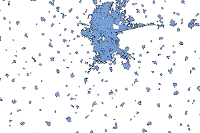

In [77]:
settlement_poly = gis.content.search('settlement_poly')[0]
settlement_poly

# Part-2 Deep Learning

The deep Learning approach for classification needs more training data. We used the cleaned up results from supervised classification, above, to train a deep learning model.

## Export training data

Export training data using 'Export Training data for deep learning' tool, detailed [documentation here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm). You may refer [this](https://developers.arcgis.com/python/sample-notebooks/extracting-building-footprints-from-drone-data/#Export-training-data) notebook for detailed steps.

## Prepare data

We would specify the path to our training data and a few hyper parameters.

path: path of folder containing training data.
chip_size: Same as per specified while exporting training data
batch_size: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 8 worked for us on a 11GB GPU.

In [24]:
# Prepare Data
data = prepare_data(r'path_to_the_exported_chips',
                    batch_size=4)

## Visualize training data

To get a sense of what the training data looks like, arcgis.learn.show_batch() method randomly picks a few training chips and visualize them.

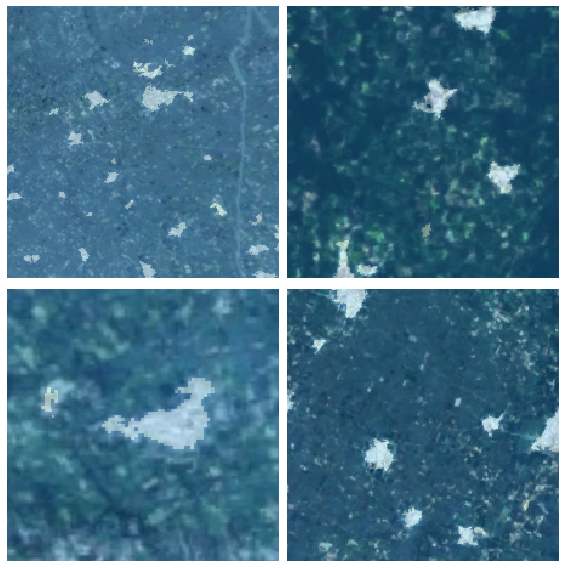

In [32]:
data.show_batch()

## Load model architecture

We will be using U-net, one of the well-recogonized image segmentation algorithm, for our land cover classification. U-Net is designed like an auto-encoder. It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape. However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. For each pixel in the original image, it asks the question: “To which class does this pixel belong?”. U-Net passes the feature maps from each level of the contracting path over to the analogous level in the expanding path. These are similar to residual connections in a ResNet type model, and allow the classifier to consider features at various scales and complexities to make its decision.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAxMAAAIbCAYAAACQfsOJAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAMi8SURBVHhe7J0FmCvl2YaRIoXS0kKNUv7SUqHeIoXiXgoUKS2ltJS2+Dkc3Ascd3f3Pe7u7u7u7u7C++/9bWbPJJvdnWST3WTz3Nf1XbuZmXwzyW4m7/O9dpYJIYQQQgghRBxITAghhBBCCCHiQmJCCCGEEEIIERcSE0IIIYQQQoi4kJgQQgghhBBCxIXEhBBCCCGEECIuJCaEEEIIIYQQcSExIYQQQgghhIgLiQkhhBBCCCFEXEhMCCGEEEIIIeIiY8TE7t27berUqe5nLKxdu9YGDhxoAwYMsNWrV9vnn38e2pPD4cOHbdq0abZ9+/bQltgpjnMIIYQQQgiRaEq9mDh9+rTNmjXLmjRpYnXq1LGVK1eG9hTOihUr3PPGjRtnY8eOtUaNGtmaNWtCe3PmHjNmjFWpUsUWLFgQ2hobxXEOIYQQQgghkkGpFxNHjx616dOn28aNG61169aBxcTJkyetZ8+e7rmAt2DXrl1uPg+M/g4dOlibNm3iMvSL4xxCCCGEEEIki4wJc9q/f39MYmLfvn3Wtm1bmz9/vvMMjBw50gkSj0OHDlnXrl1t8eLF7mc8hn5xnEMIIYQQQohkITGRDzt37rT69etbVlaWLV261GbMmGFNmzZ1OQ2EHhGWhPF/7NixuA394jiHEEIIIYQQyUJiIh8w9MlfIKcBCEEaPHiwG+vWrbMuXbq4OU+cOFEkMZHscwghhBBCCJEsJCbygeNbtWply5cvd48x9EeNGmW9e/e2Hj16uKTpzp07W6dOnax27drWokULmzdvnjs2KMVxDiGEEEIIIZKFxEQ+EGbUv39/N/AMHDx40Nq1a2eTJk2yTZs22bJly9xYsmSJm5dwJDwNsVAc5xBCCCGEECJZlHoxsW3bNqtbt65VrFjRypcv735Wq1bN5SgUBoY7Rny9evWcZ4BQIwx+P0UNQSqOcwghhBBCCJEMMsYzQQjR5IWb3c9YwHuAwb9nz56YnxuU4jiHEEIIIYQQiSZjxMT0JVvt+hc625wVRe8ifcurXd1cN2QPfm7fczi0p2g06DXH3ms2wY0K7aba0WMnQ3uEEEIIIYRIPTJGTExZtNkZ/jOXbg1tiZ8bXuxsb7SZbW+2nWP3v9PHlm3YHdpTNLi+v9cYY8/UGOt+X7lxT2iPEEIIIYQQqYfERBzc+GJWtpiYY2+1m2sPvJs4MYGnA4HCvIgUiQkhhBBCCJHKSEzEgcSEEEIIIYQQEhNxITEhhBBCCCGExERcSEwIIYQQQgghMREXEhNCCCGEEEJITMSFxIQQQgghhBASE3EhMSGEEEIIIYTERFxITAghhBBCCCExERcSE0IIIYQQQkhMxIXEhBBCCCGEEBITcSExIYQQQgghhMREXEhMCCGEEEIIITERFxITQgghhBBCSEzEhcSEEEIIIYQQEhNxITEhhBBCCCGExERcSEwIIYQQQgghMREXEhNCCCGEEEJITMSFxIQQQgghhBASE3EhMSGEEEIIIYTERFxITAghhBClk88//9xWr15ts2fPtuPHj4e2mh07dsxmzJhhvXv3toEDB9ratWvdsbBjxw4bPny49erVy8aNG2f79+9322Nh3759Nnr0aOvTp487j//ccPr0aVu0aJEtWbIk97xBSebcUNB7I0o/EhNxIDEhhBBClD4OHTrkjOEGDRpYq1at7ODBg277yZMnbcCAAW4bRvOIESPcMevWrbPdu3dby5YtberUqbZt2za3r2PHjnb48GH33CAcOHDA2rVrZ/369XPzc54xY8aE9uawZs0aq127thMsGP9BSebcUNB7IzIDiYk4kJgQQgghSh+IgTlz5tjChQutbdu2uWLiyJEjzgDfujXHhjhx4oRlZWU5AbF06VJr3bq1M9ph+/bt1qxZM9u0aZN7HIRZs2ZZt27dcj0GnBdvggcip2vXrta9e3e3+h+LwZ/MuaGg90ZkBhITcSAxIYQQQpReEAh+MREJYUxt2rRxYUEIEFblN2zY4PYtXrzY7Qsa6oTxzso+YUis7A8dOtQWLFjgVvy9/WPHjnUr/hjosRj8yZw7P/zvjcgMJCbiQGJCCCGEKL0UJCaOHj3qQob69+/vVvvJDSC/ok6dOtaoUSOrV6+ee35QTp065TwDTZo0senTp9uyZctcWBICAMg/YKUfI539sRj8yZw7GpHvjcgMJCbiQGJCCCGEKL3kJyb27t3rjG/yKjCcAY8EngmStjHEWfnn8c6dO93+wuA5GPx4DbykZYx+QqfIuyBEafny5W57rAZ/MueOJNp7IzIDiYk4kJgQQgghSi/RxATGcocOHVy1Ji9MCCZMmOCMcs8IJweB55J3EQSM/EGDBoUZ/CREt2jRwuVv4PHo1KmTde7c2Zo2beoeDxs2zFVQKoxkzu0nv/dGZAYSE3EgMSGEEEKUXiLFBEnFrNoTHhS5ck+IEzkCiAjAI9G8eXNbtWqVexwEhAcG/q5du9z8nAcDHyMdzwHeBMbgwYOd0b5+/frAHoRkzg0FvTciM5CYiAOJCSGEEKL0QahP5cqVrWLFilahQgX3k8pM9JFg1Z7H3qhUqZIzwAkXon8DoU0Y1Rju9JzAyA4K+QXMRXnW+vXru9yLaKVV4wlFSubcUNB7IzIDiYk4kJgQQgghhB9Kw1Ie1fNQxANzUFo2GaFCyZxbZDYSE3GQLDHB9f3xo4H20EeD7O43e0lMCCGEECkA+Qbj5220UbPWu7Fk7S4bPTvnd8bG7Tk9JoTIRCQm4iCZYuLGl7LcuPP1HhITQgghRAowI9t24Dv6vWbj7cVaI+zmV7q4x49+MsjueqOXPV0hcSE9f/l0YK49wM+Vm/aG9iSGo8dOhs3/6Ef9Q3uKTtvBC23q4i2hRyJTkJiIA4U5CSGEEJnD1EVb7NW6o9zv2/cctnve6GFPfDbEfV//t8Ek+3ulIW5fIrjnjZ72SrPp2XbGbHv4w/42eeHm0J7EsPfAUbulTFc3/6vNZ9gdr3UP7Sk62Fmv1svpYSEyB4mJOEiGmMCFyvXx4WZuwpxmLSv6tQohhBCiaBSnmLj3zZ7OyGfuRz4akBQxcVvZbm7+si1m2p3leoT2FB3smDISExmHxEQcJENMcLPg+p6tPd7dRPi9dteZob1CCCGEKCkkJoIhMZGZSEzEgcSEEEIIkTlITARDYiIzkZiIg2SICW5UXN+/6ox3H+7fvZRlrQcuCO0VQgghREkhMREMiYnMRGIiDpSALYQQQmQOEhPBkJjITCQm4kBiQgghhMgcJCaCITGRmUhMxEEyxMTp02eqOb3eerbdkf3hHjUrb7t7IYQQQhQvEhPBkJjITCQm4kAJ2EIIIUTmIDERDImJzERiIg4kJoQQQojMQWIiGBITmYnERBwkQ0xMW3ymmtNrrWbZLa92tZ5jl4f2CiGEEKKkkJgIhsREZiIxEQdKwBZCCCEyB4mJYEhMZCYSE3EgMSGEEEJkDhITwZCYyEwkJuIgGWLi1OnT7vq8ak63v9bdRs5UNSchhBCipJGYCIbERGYiMREHSsAWQgghMgeJiWBITGQmEhNxIDEhhBBCZA4SE8GQmMhMJCbiIBliYtGane76uCmVo5pTmW7We5yqOQkhhBAljcREMCQmMhOJiThQArYQQgiROUhMBENiIjORmIgDiQkhhBAic5CYCIbERGYiMREHyRAT+w4dc9dXtsUMe731LFfNafj0taG9QgghhCgpJCaCITGRmUhMxIESsIUQQojMQWIiGBITmYnERBxITAghhBCZg8REMCQmMhOJiThIhphYtGaXuz5uSq5pXfaHe9QsNa0TQgghShqJiWBITGQmEhNxoARsIYQQInOQmAiGxERmIjERBxITQgghROYgMREMiYnMRGIiDpIhJjbvPOiu7+Wm0+y1ljPt9692tR5jloX2CiGEEKKkkJgIhsREZiIxEQdKwBZCCCEyB4mJYEhMZCYSE3EgMSGEEEJkDhITwZCYyEwkJuIgGWJi7db97vpebDzVVXO6I/vDPWb2+tBeIYQQQpQUEhPBkJjITCQm4kAJ2EIIIUTmIDERDImJzERiIg4kJoQQQojMQWIiGBITmYnERBwkQ0xs8lVz4sP9u5eyrNXA+aG9QgghhCgpJCaCITGRmUhMxIESsIUQQojMQWIiGBITmYnERBxITAghhBCZg8REMCQmMhOJiThIhphYvy2nmtNLTaa6ue9+s5fNXlb0axVCCCFE0ZCYCIbERGYiMREHSsAWQgghMgeJiWBITGQmEhNxIDEhhBBCZA4SE8GQmMhMJCbiIBliYuOOA+76Xm4yNfvDPcNufCnLWvSfF9orhBBCiJJCYiIYEhOZicREHCgBWwghhMgcJCaCITGRmUhMxIHEhBBCCJE5SEwEQ2IiM4lbTBw4cMA+/vhjq1q1qh0/fjy0NXVJdTGxa/+RnA9h8+kub+KeN3vZ3BXbQnuFEEIIUVJITARDYiIziVtM7Nu3z1555RV77733SlRM9O7d23r0KPyDoARsIYQQQsSDxEQwJCYyk7QOczp27Jg99thjVqZMGTt9+nRoa3TSTUzc93ZvW74+MfMKIYQQIn4kJoIhMZGZxC0mMOQHDRpkI0eOtFOnTtnWrVutS5cutnr1aps1a5a9++679txzz1m1atVs8+YzH4QZM2ZYz549bfv27dahQwd7/vnnnRgYOHCgmweOHj1qAwYMsFGjRoWJhIMHD7rnTp061fbs2WOtWrWy73//+3bfffdZ+/btbe3ataEj85LqYoI5uL7nG05WzoQQQgiRQkhMBENiIjOJW0zs2LHDbrrpJnvwwQft8OHDNmHCBPv6179uf/vb39x2BAJi4mtf+5rdfvvtTjwgDD744AN33AMPPGB33XWXlStXzv286KKLrFKlSu6Ybdu22XXXXWcPP/ywEy0eq1atsu9973suvGrp0qVORFx44YX2ne98x+68804bPTr/f2AlYAshhBAiHiQmgiExkZkkTExMnjzZLr/8cvvpT39qy5cvDx1lVrlyZbv00ktt2LBhTih88skndu655zrRwfOAZG7m+cEPfuCeG0RMMBeP/+///s9effXVMA9GNNJJTJQJiYl6PWaF9gohhBCipJCYCIbERGaSUDGBxwFPg9+wJyzpy1/+sguB8sQEXgi2+2nQoIFdcskl1q9fv4wUE7v3H835EIZuIErAFkIIIVIDiYlgSExkJgkVE9/4xjdcqVg/ffv2ta985SvWuXPnXDHBcVOmTAkdkUP37t2dyGjdunVGiglQNSchhBAi9ZCYCIbERGaScDFBwrWfaGLi29/+tkvS9tOrVy/70pe+ZM2aNct4McGgmtPSdbtCe4QQQghRUkhMBENiIjMpETFBbgUJ237Yj2eCn/mJiWXLltl3v/vdUikmlq5TNSchhBAiFZGYCIbERGZSImLiggsucOFMHt72yy67zMaNG2e7du1yc997772uHKwHSdwkc5f2BGyJCSGEECJ1kJgIhsREZlIiYuK8886zW265xVauXOmOWbBggf3kJz9xJWR3797tOmo/9dRTduWVV7qeErBp0yZ79NFHnffi5ZdfdnOtWbPGrrnmGvvrX/9aaBfudBITXjWnBj1nh/YKIYQQoqSQmAhGqoiJxYsXW926dW3fvn2hLYmFKqT16tWzhQsXhrZkNiWWM/HOO++4/hDkQCAQfvjDH9rEiRNDzzIbP3587r6rr77aCYsKFSrYr371K/vvf//rGtxx3meeecaJk6uuusoaN24cenZeUl1MHDtxyl1fuVaz3LxKwBZCCCFSA4mJYKSKmGjevLn99re/DWuanEgQKz/+8Y9dg2VRBDERD56YuOKKK2zu3LkunGnMmDFORPjDmTz27t1rY8eOdV22aXoXDQQFwoNjEDj5kU4J2BITQgghROogMRGMooqJadOm2UcffWT//ve/7a233rKhQ4fayZMnQ3vNZsyY4ap/Yh/6IUSe1gJ4DEaMGGF//OMfXRg8bQewMY8ePeoMf45bt26d64HGOT7++GMnDDwQH1lZWS5H18/q1avd9g0bNtiSJUvs/fffd2H3b7/9tvXu3dsOHToUOjIzKTExMWfOnNDW4iGdxATj3rd62+K1O0N7hBBCCFFSSEwEI14xQbRJjRo1XF+yu+66yxnpjz/+uHtcpkwZt3CMDYnAIKpl0aJFoWfmPPcvf/mL/eIXv3BG/5tvvmn0PaNC6I033miVKlVyhX34/de//rWLqiE8nnkJlWc+rygQ4gWR0LRpU/fYo2PHji7Kpn///k7MEJr/hS98wX72s5+5sPytW4tuW6YzEhNxkAwxMWvZNnd9z9Wd4G4i/K4EbCGEEKLkkZgIRrxiAo8DtuFzzz3nvAiASPjss8+ccY9XIYiYwLPA4yeffNJ++ctf5oY5kY/7+9//3i688EJr1aqV2wacl/mefvppl3sbRExAhw4d3GOFOeVQrGICcEOhONevXx/aUjykUwK2xIQQQgiROkhMBCNeMUGyNF6ISOMcY/+b3/ym8zYkQkzgUSDMyQOPB7m/P//5z12hH4mJ+Ch2MVFSpJOYKNtypt30chdrP/TMh0UIIYQQJYPERDDiEROIhLJly7riPOTT+lm7dq0r0PPEE08kREzceeedYRWeOPZf//qX62FGnoTERHxITMRBMsTE8VA1p9dbq5qTEEIIkUpITAQjXjHxwgsv5BEJQBTLtddea4888khCxMR9990XVvCHY6kQ6s0pMREfecQEbyYZ7ryhpYl0SsCWmBBCCCFSB4mJYMQrJt577z3XXsDrLeZBPzLaBNAGID8xQbUnkrWDiIlbb73V9uw5Y1tx7N/+9jf7/ve/75K38xMTbdq0cWFYEhPRySMmSIx++OGHXamr0kSqi4kTJz3PxOzsuWfbXW/0tCkJvoEIIYQQInYkJoIRj5gAepFhrLdr1y60JYchQ4Y4455KT4gJysZ+61vfcrkUHlRquv766wOJCcrFUtrVgxYFbKeRMsfQruBrX/ua1apVK3REjtihNxrVoSQmoqMwpzhQArYQQgiROUhMBCNeMYHRjyBgLF++3G3bsmWLS46mfKvniUBsYNRj7CMajh075npGXHbZZU5MkETNdjwZeBu8fhGemPjiF79ob7zxhusLgUho3bq1EzGffvqpe8y5eR59KjwPBn3MSNzmOIoIQZcuXdx1tG3b1j3OdPKICWrl8iYtXbo07PGqVatcc7jXXnvNnn/+eaci+SMSz0YNX0Kj6H4dWWuXPwZ/rJdfftkdwx+duSKhqQjuK+Lm+OOgFlF8nNPPvHnz3B+d8mFk96Mi+QcoDIkJIYQQQsSDxEQw4hUTQMO66667zi6++GK7+uqrnbGOEe8Pu6eB8UMPPWTnnXeeXXnllS7kCeGAfUluhVcpFDvyoosucqFThDFRwQkxcfvtt7vj8W7w/PPPP9+FSHmNkREiVapUcc9FoODJ+M1vfuPsW3pX9OrVyx2Hd+NHP/qRu0Y6bRd3u4NUI4+YGD16tHPxNGzY0D2mkQdvIJn0/BHIuKehCLV6y5Ur5zLjyYR/9tlnnSvqsccecx0IgT8qfzwy9BEJr7/+umvwcdVVV9mUKVPcMeAltqBImR930z333GM/+MEP3Lz8cREMtEfnHDfccIObC8WKUqQOsb9DYjRSXUz4+0y4ak6vdLGOw8ITkYQQQghR/EhMBKMoYgKw5ebPn+/Cm2bNmuV6P0TCMewbPHiwW/iOtqDMtgULFrhj8E7s3LnT2aMPPPCA80qQizFs2DB3DDZmJGvWrHEiBlvV63sRCZ4TrpM8j/yOyRQKFROTJ0+2yy+/3KlF2ogDIgFRgCHv5Vbwx0Bc0HQE7wE0atTILrnkEteC3IN/EkpwIS54zo4dO+x3v/udEwj8YYBMe5TkOeec47LsOY4/uJeE47Ut5x/qgw8+cMoz0oMRSUFiomvXhdkKs6E1aDDNDh8+EdqaP0HFxLXXNs6+3t7Zr3lbaEvBKAFbCCFEJoARiBGGDZAOxCsmhg1baddc08Dq1JmSbdvkNYyjEVRMjBy52n7+8ybWsuUsO3as4AVVP7GIiSYzZtgvmza1tnPm2IkoRnckRRUTycILc/LEhEgsgcQEngmSTzz1h+cBz8GvfvWrXAEAiAfcQmPHjnWPOZ5wJcKhPHAl0dIcrwLNQnBrIQbI5PerS9Qe3gpPTDRu3Nh5JVCZfqZPn+4amlSoUCG0JToFiYm6dafYWWeVd+Oyy2rYZ5+Nzb7uw6G9eQkqJr7whQq58/7hD52y35e1oT3RkZgQQgiRCRAWMnDgQDdYDNy4cWPUFeZUIV4x0bz5zFw74KtfrW4ffTQq2w4q2JgNKiY6dZqfO/c3v1nLKlUan200HwntzZ9YxMRbw4bZWeWzz5E9vlOnjtXOtgkP+Gy6SCQmMpNAYgJjv2bNmu4x8Ie4//777bbbbgsrsUUYEs8dNSrnA8eNARcRHa8fffRRu+OOO5yQwKPB85mHvAgeIxb8kARDrBpi4sSJEy5hBi/Hf/7zH3v//fdzx6uvvurOSThUQfjFxMqVu61GjUm54+GHs3I/kN646KLKVrbsYFu7dm9ohjPkJyZatZodNu8555wRE9648caW1qvX4uz35nP3HA9/n4ly2eO217rbkKlrQntTC8qn4SLU0NDQ0NCIZ5An6YkJb5DoSk5lYWHLJUFQMXHo0PEwO+Dxx7vlsQMuvLCSvfzywOzXGn0hMj8xsXnzgbC5n3qqZ565L764irNd1qzJfzGyIDGxYd8+qzEpe/7QuK1t21wx4Y1Lq1WzD7PtvG2+fg0eqSomsDfJe6hXr17U0ClRNAKLCX+ZLE9MkENRkJho37698y4QIkVeA/sRDSSteGKCZBYSWFq1auWe4+F1PfTExCuvvOKSchAl//jHP8LGP//5T2vQoEHomdHxi4m+fZfm+QDmN/Au/P3vvWzevDMejfzExA9/2DDsuWefHT6XfxBW5XdNcrPg+tIhAXvQoEF5vgQ0NDQ0NDSCDqIMom1nEKtOgmsqxaEHFRNbthyI+p0fbZxzTnn7y1962KxZ4Z6H/MTE5Mkbos4TbZx7bgX761972MyZeb0aBYmJcdm2V6R4yG9cWKmSvZT991q5+4woSlUxIZJL0sQE2/FcEArlZdcD1Z7IfPfEBIYpggO16GfhwoUuS98TEx9//LG7jsiGJkGJV0z4xwMPdLLp0zclREx441vfqmXVq0+08XM2SkxoaGhoaGTEKEhMeIPvmrlz54aFSpcUyRAT/nHPPR1swoR1bo5EiAn/uOOOdjZt2kY3ByRKTHjjnOzxZPfutmj7domJDCVpYoJavz//+c9dC3S/S4l9X/3qV3PFBDcKkrYJV/Jn1NMQhIpRXs5E9+x/VMKhWrZsGToiB6+EbGFJXIkQE1dfXd+FKCVSTJx3XkX7xz9626S5OWLiuXoTrFyrWXZr9ge9/8SVbt5UQ2JCQ0NDQ6MoI4iYYFBR0qsQWZIkW0xcdVVdFyoNiRYT3/lOHVdoxiPRYoLxsyZNbODy5RITGUrSxAQf/vvuu89+/OMf5/asmDlzptuGx4HqTXQt3Ldvn9tGTWGSsYHKTVR4ormIJyY49uabb3ZNSbxqUZyDvhckYHtJ3/lRFDFx882tnYg4dSonOSwRYoJErPffH5ktuva750K6JGBLTGhoaGhoFGUUJiYo/UnSbKqQLDFxww0tnaF/8uSZ5PNEiQnmzspaYCdOhFdhSqSYuL9jRxu28szCp8REyYJdTCRP1apVizU3JKk5E9wQ6DGBR4FysDQIwePw4YcfuoYjlJelogOJWORHXHDBBblNSEiUIbfCExOAF4NsfEQGZWKp7sSxbdq0CfNqRMMvJlas2OVCi7zx0EN5E7CJNySWcerUM65Bj/zEBDkQ/nmjJWD/4AcNst/badnvYd4/crqICRLkoiXUaWhoaGhoBBnRErDJlVi8eLEdOVJ4RaLiJpYEbL8d8PjjXfPYAeRKPPZY19ywpkgKSsD2z01OROTcnu2C8MiPwhKwq2f/bbxxa7Z9FSkgLqBRcb9+tjDU6M2PxETsIAAI9Se8P1b4vNStW9ctzAM/yTGmQmqJiolEQxgS4oJO1Xv35lRG4gUiUigHhzABekvgzkTM8BxuNggGumL7y8UhGmirTulY5vCeXxh+MRGJvzTsJZdUtTfeGBq1ipNHfmIiEn9p2FtvbWN9+izJU8XJ4+jxk+76CHFy1ZzKdrfBU1aH9gohhBClB39pWOwDiq6kYhUnj6BiIhJ/aViv0lJ+VZw88hMTkfhLw156aTV7990Rtn59jlFZEAWJiUj8pWEvr1HDPsn+W0Wr4uQhMRE7CAKieAjZjxUW8clD3rw5+v9IcZF0MVEY9Jp48cUXnafD/2a0a9fO5VZ06dIltKVoFCQm8Ch897t1rXbtybZ/f+GJXkHFBD0rKN02Y8am0Jb84WbB9aVDArYQQghRFAhnpnQ8Icyffx59kS2ViFdMECJ9xRW1nSdhz55gHpegYoIFSsKrGzeeHjXaIT9iERNVJ0ywHzdqZC1mzbIjJwpv6lsUMUHfMlboiUihDUCVKlVcm4BICHX/9NNP7bnnnrM333zTidHIHiUU/uH5zFWxYkVX0n7GjBmugiiL1yT1E7I9btw4W7dunZXPFkvMV7lyZXcd2KZE0vB8FrV5biT0TaNCKcfQiLlt27Zubg8KDmHDcm7C9t599113DiJvPHuXqmW0OSDShjYKNIL2FsmJ/GndurW9/PLL9u9//9tdG5EhwML6iBEj7I9//KNro0BFU7x93uuizLI/Yoc0go8++sjNw+vBC+gX74j7nj17utBCfr700kvONqfpdJACCCUuJoA/Ls3urr32Wnv++eftySefdG8sXbA9101RKUhMQCzdI4OKiVjmlJgQQgiRKaSDgPATr5gAL98yKEHFBOQX7VAQsYgJOBVDM8F4xQS5tYS+E95etmxZNyjiQyg7USyAYGAlHvuQvNvXX3/dNUAmlJ72A55xzFw8l+I+GPl//vOfXWXRu+66y82PFwxDnYqj119/vd17773OyKfVAHORx0vLgYceeshdB8/BYMfg9kDQ/PSnP3XXxzkw0kkJYC6vmTPRNjR9xpa96aabrEyZMu48pAOQJoAYobjQT37yE/vCF77gXv9TTz3lRAhiiLB+UgWYn9fK/quuusqJcMomI6SYn/YK9HCrVKmSE+ecy2sMjaCoUaOGe128fgTL448/7h5zPRzD+4qY4lycn9eA4KDBH4WQPvnkkzxiLZKUEBOAOkOtUdWJWK/+/fsHUkNBKUxMxEJQMRELS9fvdtf3fMPJudWcBk7KUaBCCCGEKDmKIiZiJRYxEQ+xiolYiFdM4JGgmA7h6x5UBcXwrV27tnuMN4vw92eeeSZ39R4B8cEHHzhDHtGB0ctjIlsIh/egEij5thjuGOqE3d95552uNQH2JmB4Y7ife+65zhb1cg5Y6UfAeP3MODfXhcgg7N5j2LBhdvnllzuvCdfBa+ExosPvYcHDwHwcD3hAuA5/mFOjRo1co2Y8Ax7z5893+cdcI9fKYPH9l7/8Za6ng8qmfjGBRwVRhYjx+rbwPMQX1+Cdk2tC0OAR8o7z3iN6xSFSCiJlxESySXUxAemSgC2EEEJkEhITwYhXTCAYMG67du0a2pIXQoo4hkpgfqZPn+6ESIUKFVw0CyvweC5Y+fdgtR+jOFJM4JnwG8reKj65PB4Y8XggqJKESEDU8BhvgX/FnkTqe+65J7c4EWICz0G5cuXCjiOMiHN4YfzRxATHkz/sX1Tn9eCB8HsdChMTJGdzrsh8DEQG7xneDUBMcA0IJw/mR1xcc801tmbNmtDW6EhMxIHEhBBCCJE5SEwEI14xsWzZMvv1r39t559/vgvvYXUfg9czwvn5xhtvuNV6DFzyDLyBF4HQoWeffdYZ1RjX5BL4O6jjwSDcKVJMYPwjAjwwvhEAhCh5kCCNeMDjwXXg8cDwJhzIfx1E1dC+gOqkhFIhJvCYUKbVT9++fd3zO3fu7B7nJyYIZyIs6dFHH7U77rjDCQmEgdenrTAxQf4GYVqEL1EN1Q/Xx3U+8cQT7jFiAnHhbwzNNZA78f3vf9/lfRSExEQcJENM7Np/JOdDmH0DyQ1zmqwwJyGEEKKkkZgIRrxiAlh5r1OnjlvZJySJsBsMZ6p7YthS8vTiiy92xjX5Df5BjgNhSAgF8m85xl8aFcOb4yLFBILAnzTtiYlJkyaFtuQVE/369XN5ChjtkdfBwGOBt8MTE4Tw+wkiJtq3b++24U0hJIlcETwzhFbFIiYIieLa/eFY4L1PNJYGT0x4/d4gbcUELh+yx3mRvAn/+9//3AtMRO5EqosJbhZcnxKwhRBCiNRCYiIYRRETfgjxob8ZuQ8Y6Bi2hBlhnPtXzyMh+fk3v/mNSx728ioALwWGcyLEBNWj8IREehwiiVdMeMnhJI1zrR6EalEGNhYxgbck2nvmtV8g/wTSVkxEa9JBggxJLVw05alwdUX+Q8SLxIQQQggh4kFiIhjxiAlCkMaOHevKmfpBAFBRCcMaqHxEmA+2oh+EB4Y4hjT24h/+8AdnYJPA7UECNLH/iRAThAjRF4KwKX8oFcY9SdUcD/GKCa6balSIH793hZ5tiKugYoKcCc7Be0a7BT+EapF/Qo4IpK2Y4M0uqElHpokJ5uD6qOb0euvZdufrPWzCvLzdt4UQQghRvEhMBCNeMUGvBoxW+j540JuBuH7KrgKhQzfffLPLS6A0K7Aw/dprrzlDGEECGMiEIbFgjcGNcCDqBeM5EWKCOcmRwLBv06aNe8x2kse5Dq+UalAxQVQO10ufCuA1UZ4WG5kytzBz5ky3jesguZz3gvPiWeB9I+cEIsUEIoMkc4ZXUQrvDfsRV174U1qKifyadPCPg/LExZOfmAjSrCQaSsAWQgghRDxITAQjHjEBrPaTNH3BBRe48qdXX321y4/ABvQatQGJxNiG5FQQpoMdiYHtGfVA7gVRLuedd55LPqaPGT3M/vrXv7o8gaKKCcBOpZkc18g52I8gYBv7IKiYwCYmF4LnE8bkdYdnXrwKvB9XXnml82B8+OGH7nXRc4LjECAXXXSROw/9LKi65BcTgEAg94Jr5X3lPIgqGtd5pKWYiNakA/XEm8QfhDJckWKCFxWkWUl+SEwIIYQQIh4kJoIRr5gA7DyEA0Yug9+jLRYjGlhRJ1QHgz1a9ArHYEsyD/kBhAv95S9/CdQzIRZY5Sf8iBAtr1ldPPBcXg+5DV7oFOFbzM2iOeIHeB28ZnpqeLYxpWopl4t3Itr7BdjIvB+cg4V7f/hUIiixMKfIGDHegILERJBmJQWR6mJi576cak6vNp9ur7WcaTe/0tU6D8+JuxNCCCFEySExEYyiiIlE0bFjR5e8jOHsQbgQq///+te/Cl18FrGTNmIiSLOSglACthBCCCGiwUptNCOTkBnCYBIpJrB3qMxDARpCVQijweb5/PPP3f5EiAnO4U8O3rlzp4uZp6lbUcSE/33iJyFDhNZ4K92pICYIySGChe7ThP6Qj/GDH/zA5SDwfovEkxZigmSUIM1KCkJiQgghhBB+MIIJhalUqZIr9Tl8+PDccvTYJeR0EqefKDGxYcMGF7JNknCLFi1crH+zZs1cXH2nTp2c7VNUMYE4oaN0xYoVrUePHi7+nzKr9evXd30cZs9dELOYQDhQqYj3iWulqRtzcx4Gr4NQnFQQE0DeAtdE92kStHmPExneJMJJGzERpFlJQaS6mNi444C7vpebTMuem2pOPW3SfFVzEkIIIZIFq9gY9yQAUwmHnM7+/fs7kZFoMXHkyBEnGCZOnJjHC8I+km5piFYUMUHSLVWFEBTYTgglSqnimQDCfbp26xGzmOD9oeoQnhq8KiT+Yr+dOHEiV2jQsTpVxIQoXtJGTARpVlIQqS4mQAnYQgghRPGBvdGzZ09ngwBGPSvuJL1iJCdSTLBaTmdj7JtorFu3zrKysookJjgH1YJ4HYBYQqR4rw/vQfcevWIWE+St4o0gFIsxevRot80D8UJpVomJzCRtciaCNCspCIkJIYQQQvih0g/hMF45T8DgxkbBeEZoJEpMYMsgJrweCX6wgbzQoaKICfI7unXr5qoDMSdeELwIXvlTBEuXrt1jFhMrVqxwIoU8DK8ZGhWMOAfigv4QLPZKTGQmJSYmIpt0FCYmgjYryY9UFxPrtu131/dS46mhak5drNNwVXMSQgghkgX5EXgfyF/Yv39/aGtO41wMf+rvJzJngpKm5C2wMMp5CalCQFBkpkmTJrZx48YiiQkMe3oFkJNBLgOdjwlBYn4EEo3cJk2ZHrOYQESwqFuzZk03Bg0a5EK2WrVqZa1bt7amTZu6RV2JicykxMREZJMO6t4WJCaADzTbCmpWkh9KwBZCCCFEJNgPGMKReQzkA5BjQL5BosQE4CXAziGUasSIEW5Vn/N4FZGKmoANeFpI9mZOXh89CKZMmeKqL+3ZfyRmMQHMg8eDvAlEC7YZthvdmb0+CBITmUmJiQmI1qSjMPhnLqxZSTQkJoQQQggRDaIjEBTkGFDqlAVNDGaPRIoJwAtCUjON2bCFEC4eiRATvJ5MLQ0rip8SFRPFSaqLic07D7rre7npNJc3ce9bvW3h6oLzQIQQQggRPwgGvASUTSWkiXKqlFGl/GmjRo3cPgzzRIkJQra98CkG5+F8hCURjkTidFHFRDqWhqVCFOHviCuaEBPC/vzzz7vcDELREC2c+9///rc7P8f74frw8rz99tuuMd1bb73lksT9UStUmyIHBs8KIV/MX6ZMGZeg7j9OxI7ERBwoAVsIIYRIfzZt2uR6EGCAIxow9jGS+Um1IvIYSNJOhJjAU0C1JoxefmfQiBfBgneCzs30uSiKmEjX0rCIk69//ev2xBNP2O23325ly5a1u+66yy688ELXK+LOO+90IoGeYoS4P/bYY+71AV6Rd955x4XN0z7g3XfftT/84Q+uNxkijb8r44MPPnDnIHyeuZmXnxdddJETKhwj4kNiIg4kJoQQQoj0B8HgLw2LpwLDePr06e53VrfJbUiEmCCPgYRoqlB6EHrE+THKCRdiJb4oYiJdS8MStk7H6uuuu87legDeiJ/97GeukifJ6oAHARFwxRVX5BbjQYyRP4vY8MKtEFUIC57PfLz+Tz75xM4991zXFZv9gCB58MEHXYds/hYiPiQm4iAZYmLx2l3u+rgplWkxw254sbM16q2270IIIUSywOvAKruXQIyRSZUiEotZcaeJHEZ0IsQEideEOFGABjBwCemhShLnwiguqphI19KwiAm8BngYPOGDoX/PPffYr371K/d6PAg/u+yyy8KqeHIs+SAezPH+++/nig4eIybwQiDe/ND0GC8Gf2sRHxITcaAEbCGEECL9IR4f47Ju3brO0CevAOMbwxTjnhAoQnsSlTNBKBD5C+QY0HmbHAYMdRK+Odfs2bOLJCYw7NOxNCxigsbEzO1BgZ3777/fbrvttrA+ILxvX/va12zUqJy/BxCuVr16ded1IHTplltuse9+97v2rW99y+bMmZMrJjgHVa388LoQGbwOER8SE3EgMSGEEEKUDvAKEOLCyjo5BRjO9HugnKoXl58oMQHkHGDwY+TiEUFI4K3wVt+LmoANzEmeg1caFk8LPS04T1FKw2K0c/2IFt4bvBPkZSC4oKhiAqHl4YkJcigKEhO8JsKZEA4kbuO5QKw9/vjjecTEt7/9bfde+OnVq5fLt0DMifiQmIiDZIiJfYeOuesr22JGbjWnxWtyEqaEEEIIkXgQEiQ9U1mJlW16JrCSz6o+hi2r1Rj8iRITGL54I6i0RFjNwoULnVeEwfkQM0UVE4WdY9ac+Ko5BXmfiltMIBI+++wzl1fRp0+f0BE5YU5vvPGGEw9+MUFeBmFrfgjZwjPBTxEfEhNxoARsIYQQIv1h9R7jlNwJEnUJdcKoJMcADwUVjEjGToSYINeA+TFm8RyQGM1qOEnSrPRjUJPvUBQxEeQcnTpnxSwmgr5PJSEmXn75ZZeATRK4B56Sm266yXkm8ER4YuKCCy4IC2fytpODQd6HiA+JiThItpjI8Uz0Up8JIYQQIomQF0GYC0Ylxjar7wx+BxKkMVoTISYwiDHCMfIBw5zHXnI0RjoGelHERJBztO/QMWYxEfR9Km4xAeRZkEDN6wRyN1555RX76U9/6srI4kHxRMN5553n8il4X4CKVD/5yU/cObz3TMSOxEQcJENMLFqz010fNyXlTAghhBDJh+RnjFAvN4IVfBqnAaE9lCQlYTcRYgKDnnN5hiwG8ty5c3O7XxOOwwp/UcREkHN06NgpZjER9H0qCTFBCdk77rjDzj//fLvqqqucl+HVV191OSIcx2jYsGFuzgQVo/BkfO9733PhTT/84Q9d1SsRPxITcaAEbCGEECL9oR8DTd6oeuSt3gOhO8TgUwUpUdWcWMXH4CZ3AWPcD6E4rjt1Aqo5FXaOiZOnxSwmgr5P8YqJokJVLpLahwwZ4vp1eJCDQoI4CfWICUrFIq7o9UH/EESE//WI+JCYiINkiwn6THCOpn3nhvYKIYQQIhlQ8YjVbW/1HlhtX7RoUW7oS6ISsDH2N2/eHNYTAej/gBFMOE5RE7ALO8fufYdjFhMQ5H0qKTFRGF6YE2IC74xILBITcZAMMXHg8HF3fXywmVcJ2EIIIURqkCgxEYSiionC2HvgaFxiIggSE5mJxEQcJENMgKo5CSGEEKmHxEQwUlVMAGVy3377beddEYlFYiIOki0mGPe81cvmr8xpAiOEEEKIkkNiIhipLCZE8pCYiINkiImFq3OqOf2nvqo5CSGEEKmExEQwJCYyE4mJOEiGmOBmwfWpmpMQQghRvFDth1h6Eoo9SDim+RsdpRMpJih5SsUlr8wqkDRN+dXRo0cnREwUdI7BQ4bHLSYKe58kJjITiYk4SLaYcNWcXsqyZv3mhfYKIYQQIlns3LnT9VGgAzWViShz2rFjR+vUqZPbl0gxgfFNIzU6Uy9fvtyVXR0xYoQ1adLEdXFOhJgo6BwzZs2NW0wU9j5JTGQmEhNxkAwxcfr05+763mgz282rBGwhhBCi+KDkKc3TaHDGmD59eu4KfKLDnPAS0AeidevWVr9+fZcc7HkREhXmlN85ihrmVND7JDGRmUhMxEGyE7AlJoQQQoji5fDhw7mr+U2bNrWRI0e6pmyQaDFBqdJ58+a5c7Vs2dKysrLcKj8kSkzkd46iiomC3ieJicxEYiIOki0mXDWnN3vZ3BWq5iSEEEIkm23btlmLFi1s0KBBLt+Arsj9+/e3Vq1a2ZYtWxIqJujW3LdvX2vbtq1t2rTJTp06ZTNmzHBdpOlSnQgxUdA5JkyaGreYKOx9kpjITCQm4iAZYmLa4pwP4b/qKAFbCCGEKE4wkleuXOlCgzxY2ae7M12jEykmyF9YuHChM/j94DXA4E+EmCjoHOMmTC6SmCjofZKYyEzSXkyQZOSvKuDBBwbF7BFUTPDB4wOBa3Du3LnuQ4NLz08sYgLXHx80QMUzH+rd2+bBzYLrUzUnIYQQIrVIdJhTQSQqzCk/VBpWJJq0FROIiKFDh1qlSpWsatWqNnz48FwFjqHeu3dvJwY8ChMTPGfatGlWq1Ytq1evnnPZkbREclH16tVduTaSjiCImKDKAe7FChUqOLci18JP5q5Ro4a7Xr8I8ouJ11rOtJtf6WpdRi4J7RVCCCFESSExEQyJicwkbcUEFQqaN29ua9eutR07dlj37t1d3B4iIx4xQXt14gCZL5KtW7c6YbFgwQL3uDAxgftv7NixrgwblRPmz5/vhAQ/Yd++fdalSxfnLvTgOVyfqjkJIYQQqYXERDAkJjKTtBUTGOY9e/bMDRciPrBHjx42ZswYt+Ifq5hAKPTq1StP+BFg6I8bN855J6AwMcEcgwcPdgIFCG/iWvfsyREH7KcSAoLIj6o5CSGEEMVPYSHTiRQT2AAsUpLTQAM4eksQzeDlISRCTHAOr8IS0AOCfhMsZhZFTPjfJ35i5xAaznaQmMhM0lZMkHvQpk2bXAMd9u7dax06dHCdGDHeYxETXi1mPnCRIAYoqTZzZk4OQxDPBKXSSKTidz5slE/jmgHhgydl8+YzN4gjx0666yvXapa93nq23ZH94R43d0NorxBCCCESTdCQ6USJiQ0bNrioCsKdiYbAjqHEarVq1VzjN0RFUcUE4qR27dpWsWJFt8g6adIkF8JNr4k6derY7LkLYhYTCAcWQXmfuFbsLObmPAxeBzaYxERmkrZigg87H3I+jPv37w9tzclVoDtj5cqVYxIT5ENwQ+EDxweakmo0eEFE8OFDnHiJ2EFyJhAK5FvwIatbt66NHz/ehTohdvjJtXtKHvw5E9xE+F0J2EIIIUTyCBoynQgxwUIi9sXEiRPzeEHYN3DgQGd3FEVMYKd07drVCQrCrLFr6DHhLZQuXbrUunbrEbOY4P0hPBtPDV4VckIHDBjgbCdPaLCAKjGRmaStmMB9x4o/lZEiP5T8c/OB8XsZChMTzEctZkQA3RxHjRrlvAtTpkyxjRs3upuKRxAxAdwcuEY+0Fwj7kxuFHzg/EICJCaEEEKI4iVoyHQixASRFCx2sugZjXXr1rkFzKKICc7BYiivAxBLiBTv9eE96N6jV8xiglBwvBFEWzAI+/bySAHxQq6oxERmkrZigg8dXoR27do5Y78wChMTscwXREyg3jt27OhiCflw4wLEw+FVh2Jlwi9Q5q3c7q7v3/UmumpOv3+1q3UbtTS0VwghhBCJJmjIdCLEBCHTiAlKz0eCPeCFDhVFTJDf0a1bt9wS9NgaeBG8UvnYOl26do9ZTKxYscKJFBZe8X507tzZLbhyDsQFeaVTp06VmMhQ0lpM4C7kQ46Lsk+fPs6Az48gYiLofEFyJnD54QLEA0GIk78ULAIDt6O/mhMoAVsIIYQoPoKGTCcqZ4LmbiwsYgNwXkKqEBCEPzdp0sQtZhZFTGB/UOaenAzCrFkgxR7xwqwpTz9pyvSYxQQighCwmjVrukEHbGwmr4w+eaGEiUlMZCZpLSZQxih93Hmobz4k3BAoyUqytN+VGERMBJ2vMDGBUkeMENbEB5uQKVS9B/MTe4io8CMxIYQQQhQvp06dcot7rOYTFsR3M9/3LAZ6IdOJEhOAl4DwKkKpsC9Y1ec8XvhzUROwAU8Lyd7MyetbtmyZC9sm9HrP/iMxiwlgHp5PODi2DZWhuH7yMrzFV4mJzKRUiAkPPjRLlixxHgFCjPjweMQiJjzymy9ImBMrAzyHDzRzEEvIB5EPIHGGrErs2rUrdLTZoaMn3PUR4uRVcxozO6e0rBBCCCESD9/JGPZUOsILQQUkQp6pWNSoUSO3jwXCRIoJwAtCUvOqVauciPGa4kIixATXnMjSsF6Stao5iWiUKjFREPGIifwIIiZwnaLY+ZARNsXNCdcmg+pO1Jf2w82C61MCthBCCFE8UHiF0qwkEGOA46HASOYnC3+EHpFXkSgxwbxe+BQDwxz7gLAkjHUiF4oqJpJRGlbVnERBpK2YwE2IyvbyEAqjMDERy3xBxIQHiUqEOBHyxPA3d/EjMSGEEEIULwgGfzUnPBUYxlR15HeqFhGOlAgxgaeAak0sNPI7gwa3eD/wThDNQH5lUcREskrDqpqTKIi0FRPRwMVGKFJkKVcoTExEI7/5YhETHjyfOEM+yNHKws1flZO49J/6E61c61l222vdbei08JwKIYQQQiQOvA6ssvN9DxjjJBbPmjXLLS5Szh0jOhFigrBnEqL9Ic4sYiJmWOFnsZEIiaKICc6RjNKwquYkCiJtxQSGOVUQ+MDwj4x7jZKruPH4SWk0/uE9ChMTscwXREywqjF58mQ3Fx8+bha4Mxs0aODmY1+k4FECthBCCFF8EJLM9zPhx4Qf8Z2PuCC3AI8BIVCE9iRCTBABwTnIowRsAKo9UiUJ4cL5iiomOEcySsNix6iak8iPUpEzwYeef2hqN2O8k9jEB5Zybh6x5EwUNl9hYoLn4O6jihO/c+OgKpTnZmQlxO929JCYEEIIIYoXDHm+lymc4q+qhAGN2IBE5UywUEn+AgnL5FOSw8CqPxELCJfZs2cXSUxgcySjNCxQRAaRgrjiPNhLeHCodul5diQmMpNSISb4x8bY9/6Z+SdH7WPMe8QiJgqbL1YxwQcNr4fniYhWGvbgkTPVnMq1mmW3lOlmfSecKScrhBBCiOSAoex9R/OT8GZ/jmOixASQwIzBTx4ldgZCgkVHDHUoagI2MCdJ01w/rw2jHzuE88RbGhYKe58kJjKTUiEmGBjn/FMD/+zEOVLBwCMWMVHYfLGKCWIWcTuyygF8yHE7evMDNwuuTwnYQgghRPGAV4KkZyorEYLM4h8r+azq40EghAeDP1FiAmMebwSVlrArqOxIiBWD8+EZKaqYKOwcs+bEXs0p6PskMZGZpLWY4B+amsfE75GP4CUD4UWgPjTq3yOImAg6X1AxUaFCBatSpYr7oDEnosJL7iL20F/VSWJCCCGEKF5YvSfciDAnmrwRlcDCIjkGLACysEgOZCLEBN//zE9CN4uKJEYT2oRtgN1ALiULj0URE0HO0alzVsxiIuj7JDGRmaStmACUMqXPCEuiKyM5CHxY+EePzEcoTExA0PmCJGADHzCUOq5LxAofcgQEH0bPS+GxanOOon+h0RR7vfUsu/217jZsuqo5CSGEEMmCpOdevXq5hUO+71l9Z/A7eCHOiRATVFrCCMfIB2wBHnvJ0dgaGOhFERNBztG+Q8eYxUTQ90liIjNJazERC0HERFCCiolYUQK2EEIIUXyQ/IyxzUIisIJPV2pggbF37942ZcqUhIgJDHrOhYEPGP4UdvG6X5NDwQp/UcREkHN06NgpZjER9H2SmMhMJCbiQGJCCCGESH8oiEKTN6oeeav3QPRAnz59XBUkohUSISZYxcfgJncBY9wPCdKuO3UCqjkVdo6Jk6fFLCaCvk8SE5mJxEQcJENMbMu+OXF9rzSbnlvNqc94VXMSQgghkgnhx4Q2e6v3wGr7okWLcsOFEpWAjbFPXytK0PshFJqqSIQRFTUBu7Bz7Dt41NkbzP3Au33tppe7hI4omCDvE/O+KjGRcaS9mKAiEm47/qE9+Icn+YiKBh5BxUSQ+YKKCT7QuBf5APvB7ThkyBD304ObBdfHuP/dfu6nErCFEEKIkgcxwXd/ywELrGqn6dkGeJbd/GpX+3PF4Xb/e/3sL58NDB1ZdO7JFhO3le1u977V29kC81ftCO1JHEvX7XZ2EWPdtv2hrUWnXIMx1mucFkIzjbQXEyRGE8dHBQSUMW62jh07uopJ/qTpoGIiyHyxeCZQ7FSCotU8zW8o0YY7kEpRiBQPbhZc3x1v9LKHPh5kv3spy1oPXBDaK4QQQoiS4uixk9Zm0EJr1m+eG/0mrrTm/edZ0+zfGdMW5/SISAT7Dh2ztVv2ubFxR06OghCpTKkIc8LlRrmzhg0bukF5Mr9nAWIJcypsvljDnKjoRHISbfqpxRzpqfBQzoQQQgghhEgnSoWYoOQqzVOopdy0aVO36h9ZejUWMVHYfLGKCUrD4tlo2bKlq9OMt4K4yEgkJoQQQgghRDqR9mJi27Zt1qJFCxs0aJDrXE2VAVrGt2rVKrc1PQQVE0Hmi0VMUJmBMCd+IiBIXsI7QVfKSMEjMSGEEEIIIdKJUiEmqKdMsrMHRjur/1Qt8IhFTBQ2X1AxwRzLli0Ly90ARMS0adNs//7wpCeJCSGEEEIIkU6UijCnIMQS5lQYsYY5BUViQgghhBBCpBMSE3EgMSGEEEIIIYTERFxITAghhBBCCCExkQd6QZAbMW/ePNdwjvwJqjv5iUVMkB/hVW4ioZv5SORWNSchhBBCCJHupL2YoPFbZE8JoNkclZg8ChMTGPckRdeqVcvq1avnqjdRdYk+E9WrV7fRo0fntpAPIiZoeNe2bVurUKGCa1KHMOEnc9eoUcOGDx+e57olJoQQQgghRDqRtmICETF06FCrVKmSVa1a1RnneBUAYUCTOAx4j8LEBCVbKQm7du3a0JYzbN261QmLBQtyOlIXJiao4jR27FgbMWKEHThwwObPn++EBD9h37591qVLF1c5yo/EhBBCCCGESCfSVkysXr3aNYDD+N+xY4d1797d9YNAZMQjJhAKvXr1ihp+hDgYN26c805AYWKCOQYPHuwEChDe1LNnT9uzJ0ccsJ+meLwGPxITQgghhBAinUhbMcEqPwa6Z/wfOXLEevToYWPGjHHhQ7GKCQx7vA+RPSEAMZCVlWUzZ850j4N4JuiaPWPGDPc7ooJO2uRLANeK+Nm8ebN77CExIYQQQqQHpz8/bZv2bwo9EiJzSVsxgWHepk2b3NV+2Lt3r3Xo0MEmTJjghEYsYoJ8CMKmyJno1KmT9e3b13WpRkTUqVPHzeclYgfJmUAokG9Ru3Ztq1u3ro0fP96FOnF9/ETs4EXxIzEhhBBCpAc9FvWwr1T7ih08fiY/U4hMJG3FBPkRGOTkOfg7SZP43L59e6tcuXJMYsKDPIbp06fbqFGjnHdhypQptnHjxrDwpyBiAvBA4JUgbwLIvWA+umlHCgmQmBBCCCHSg9+1+p2dVf4sqz+1fmiLEJlJ2ooJSq5iqFNmNbIqEl6GpUuXhoUsFSYmmG/Tpk1RK0NFElRM+GHedevW2bJly5wHJRoSE0IIIUTqM3nDZCckGFfXv9pOnT4V2iNE5pG2YgLDnJCkdu3aOc9BYRQmJmKZL4iYoDRtx44dXc8KQrEIySJcyis1O3HixDzJ3hITQgghROrzRLcncsUEo+finqE9QmQeaS0myG0glImqTn369HEGfH4EERNB5wuSgE21pgEDBrhwJvIl/H0lEBgtW7ZUaVghhBAizVi9Z7WdU/6cMDFxc+ubQ3uFyDzSWkx07tzZVVoiN4GVfhrCkUNBfwcqL5E/4RFETASdrzAxgccBMTJnzhwnLMi/WLFiRWhvTi4FfSYQFX4kJoQQQojUptyQcmFCwhtTN04NHSFEZlEqxIQHXoAlS5Y4jwAhRuQneMQiJjzymy9ImBPdtHkOIU7MQRO7U6dOOXFBTws8E7t27QodnYPEhBBCCJG67D26175U5UtRxcST3Z8MHSVEZlGqxERBxCMm8iOImKDaFB4NSsMSNkU+BjkTDErFLly4MHTkGSQmhBBCiNSlxqQaUYUE49wK59ravWtDRwqROaStmDh48KAtX748UPUlKExMxDJfEDHhQW8KQpwIeWIQ2hStLCxITAghhBCpycnTJ+3KOldGFRLeeGPoG6Gjhcgc0lZMRIOSq4QiRfaFgMLERDTymy8WMeHB82lkR8lafy6HH4kJIYQQIjXJWpAVVUD4xyVVL7F9R/eFniFEZpC2YgLDvH///i6ZmTyEGTNmuJKr9evXdz+7deuW27EaChMTscwXREzQ+G7y5MluLnpY0EG7WrVq1qBBAzcf+1QaVgghhEgPKoyrYF+t/lXX9ZqQJv84v9L5bt9lNS6zBdsWhJ4hRGZQKnIm9u3bZ61atbJ58+Y5452O2HTBjqUDdizzFSYmeA4J11Rx4ncSsKkK5TXRW7lypUvA9jfVA4kJIYQQIrVZtXtVHo/E9S2uD+0VIvMoFWKCfhAY+15naQx4ejtgzHvEIiYKmy9WMUFZWbwenidCpWGFEEKI9ERiQohwSoWYYGCce52rKcHar18/mzRpknsMsYiJwuaLVUysXr3ahUkR7gTkTLRt2zZPp22JCSGEECK1kZgQIpy0FhPkHlSqVMlq1qzp8hFGjhzpVv/xIjRq1Mi2bj0jHIKIiaDzBRUTFSpUsCpVqriysMyJqCDvgk7b3bt3z1PVSWJCCCGESG0kJoQIJ23FBFDG9cCBAy4saf369S4HAUN+w4YNefIRChMTEHS+IAnYgCeCUKktW7Y4sYKQQECQM+F5KfxITAghhBCpjcSEEOGktZiIhSBiIihBxUSsSEwIIYQQqY3EhBDhSEzEQbLEBNf3QqMp9mLjqXbLq10lJoQQQogUQ2JCiHAkJuKAee59q5fd93Zv9/uG7QdCe4rG8zVH2GMf93fjz58MsH2HjoX2CCGEECIVkJgQIpyMERNHjp20dkMW2dHjJ0Nb4mfnviO2avNeNzbtPBjaKoQQQojSjsSEEOFkjJgQQgghhCgqEhNChCMxIYQQQggREIkJIcKRmBBCCCGECIjEhBDhSEwIIYQQQgREYkKIcCQmUoBtCxZY1kMPhY0JVauG9gohhBAiVZCYECIciYkUYO3YsVb+rLPCRrcnngjtFUIIIUSqIDEhRDgSEymAxIQQQgiRHkhMCBGOxEQKIDEhhBBCpAcSE0KEIzGRAkhMCCGEEOmBxIQQ4UhMpAASE0IIIUR6IDEhRDgSEyXIyPfft473328tr7/eyp99dtio9c1vun3dn3zSjh88GHqGEEIIIUoSiQkhwpGYKEE63ndfHo9E5Kh26aV2/NCh0DOEEEIIUZJITAgRjsRECbJi8OCoAsI/Rn34YehoIYQQQpQ0EhNChCMxUYJ8/vnn1vjaa6OKCEalCy6wg1u3ho4WQgghREkjMSFEOBITJcysli2jCglGv//8J3SUEEIIIVIBiQkhwpGYKGFOHj1qNb/+9bxi4uyzbceSJaGjonP8+HGbM2eOrVq1KrQlh927d9vIkSOtZ8+eNmbMGNu7d29oj9mOHTts+PDh1qtXLxs3bpzt378/tCc6xXEOIYQQIl2QmBAiHImJFGDMp5/mERNZDz8c2hudjRs3Wvv27a127drOcCdkCvbs2WMtWrSwPn362OzZs61r167uuMOHDzsB0LJlS5s6dapt27bNRowYYR07dnT7olEc5xBCCCHSCYkJIcKRmEgBDm3fbpUuvDBMTKwbPz60NzqLFy+21atX28CBA8MM/c2bNztPwdGjR93jrVu3WrNmzWzLli22dOlSa926tR04cMDt2559XvZt2rTJPY6kOM4hhBBCpBMSE0KEIzGRIvT/739zhUTLG28MbS0YjPtIQz+SZcuWWatWrWzfvn3OU8DvGzZscPsQC23atCkwDKk4ziGEEEKkCxITQoQjMZEi7Mg2uj0xsahHj9DWginM0MdjgJdg3rx57jHHEJZUp04da9SokdWrV895EgqiOM4hhBBCpAsSE0KEIzGRQnT6wx+s/ve/b6dPnQptKZiCDP0VK1ZY8+bNbe7cubn78BbgNSB06fTp07ZgwQL3eOfOnW5/NIrjHEIIIUS6IDEhRDgSEynEvvXrbf3EiaFHhZOfoY8ngATpyApMEyZMsG7dujkjHw4dOmRt27a1hQsXusfRKI5zCCGEEOmCxIQQ4UhMpDHRDH3KshJ2FGnkA+FH5C9g4APeAjwL0Y71KI5zCCGEEOmCxIQQ4UhMpCEnTpywLl26WMWKFa1ChQpuVKpUyQYNGmQzZ8502/2jevXqLkma8qyUcyXsqHfv3s6zgEhgvkiK4xxCCCFEuiExIUQ4EhMZCGVbSZz2vAfJoDjOIYQQQhQ3EhNChCMxIYQQQggREIkJIcKRmEgBFqzeaXeU625/eKe3+1k9a0ZoT/z0m7jSmvSZG3Ws31b0ng9rt+yzNVHG3gM5jeyEEEKI0sjG/RvtV81+FTae6f1MaK8QmYfERArQZ8IKe/D9/vZKs+n2TI2x9uSnA0N74uf6FzrbExWG258rho9bX+thjXrPDR0VH0OmrXHz3/d277BxR7kedmuZrqGjhBBCCCFEaUdiIgVATDz+2RB7q91c+2+DyfZ0xcGhPfFzQ7ax/2bbOW5O/3iy0ogii4keY5bbE6Hr9Y+yLWfaHa91Dx0lhBBCCCFKOxITKYDEhBBCCCGESEckJlIAiQkhhBCliWPHjtmMGTNciXB6Fa1du9b1Kjpy5IhNmTLFxowZkztmzZqVWz583759Nnr0aFdinOcfP37cbS8M5l69erXrdeR/Tn7XAUePHrWpU6e6fYMHD7YNGza47UKI2JCYSAEkJoQQQpQWTp48aQMGDHD9hjDkR4wYYQ0aNLB169bZ9u3brVGjRs6wHzlypBvTp093AoCS4u3atbN+/fq55/F8xEZhUIKc+TgHzzl48KDbXtB1sI/zICQoY75gwQJr2rSp2yeEiA2JiRRAYkIIIURpAe8DIgAjHfA6ZGVlOS/Axo0brXXr1rZ37163zw8eim7duuV6FhAFeCoKY9u2bTZnzhxbuHChtW3bNldMFHQd+/fvdyJj+fLlbh/igkatkydPdo+FEMGRmEgBJCaEEEKUVjDc27RpY0uWLLE1a9Y4g3/FihUuJInHp06dstOnTzsvAiFOeBGGDh3qvAUY+UFZunRpmJiIxH8dCJbu3bvbpEmTXNgT4gaRs2zZstDRQoigSEykABITQgghSiPkJRBO1L9/f2fAY6xXq1bNWrZsab169XJhRz179rTDhw9b165drUmTJi7sieMIeUJcBKUgMRF5HYBHo1mzZtawYUOrXbu2DR8+PCbxIoTIQWIiBZCYEEIIUdpgtZ+wIvIZMOaB0CPyJvBGAL8jIBAPiAk8El6CNNvwFgQlPzGR33UQ1jR+/HgnIHbs2OGeO2/ePLdfCBEciYkUQGJCCCFEaQIDvkOHDjZu3LgCV/vxSHhG/KBBg8LEBCFQLVq0cL8HIZqYyO86yN1o3ry57dy50z3mnCSD9+3b1z0WQgRHYiIFkJgQQghRWiDRmSpJhCiRC+EH0dC5c+dcg3/lypXWuHFjZ9yTQI142LVrl3sez+fYoESKiYKuAxFBiBPlZAGhQdgVFZ+EELEhMZECSEwIIYQoLRAyVKdOHatYsWLuqFSpkuvlgKFPxSb2IyJq1arlKihh7JPLwDHkL9SvX9+VkA1SqpUci8qVK7vzVKhQwf1EKBR0HZxv2rRpLsQKEYH3omPHjrZ79+7QrEKIoEhMpAASE0IIITIJSr6SAO3lMPih3wS5FMWRDI2A4Tr27NmTG14lhIgNiYkUIJ3FxMtNptkLjaa4ITEhhBBCCJFZSEykAOkoJp6tNdbNd8cbvez67HMxXms10/7wrpLXhBBC5PDPykPsrtd72H1v9QwbN7zY2Rr2mu2+O+4s1yNs3PhSlv2vddGax508edqa9ptnNbrMyDNqdZtpew7k9YgEZe2WfbZoza48Y032diEyEYmJFCDdxMQn2Tf5P1cc7ub7V53x9vfqY9zgfE9WGBY6SgghRKZz08tdbP22/bZ7/9Gw8W7T8fZy7ZH2WPlhVrbFzLDB98qfPxkYmiE+1m7d74TKX6uMzDN+/2pXGzJtTejI2Ni086Cb9w/v9c0z2L5xx4HQkUJkDhITKUC6iYm/fjrQbinTLc/cz2Z/Adz8SldbuWlv6EghhBCZzB2vdbODh3OaxPmp1GGqExN/rTwyz3fJ8w0n21PlB4WOjA/ExL1v9cozN+OxTwfHLSZWb95n973dO+q897/TW99/IiORmEgBSouY+HuNMW5lZtGanLrdQgghMhuJCSFKPxITKUC6iYnK2V8CT1UdlWduiQkhhBB+JCaEKP1ITKQA6ZiA/XrrWXnmLtdqlv3pf4Ps2IlToSOFEEJkMhITQpR+JCZSgNIiJtz8SsAWQggRQmJCiNKPxEQKkG5i4rX6o+3BDwfkmZvz/bn8UDX+EUII4ZCYEKL0IzGRAigBWwghRGlEYkKI0o/ERAogMSGEEKI0IjEhROlHYiIFSDcx0Tj7+f+uNyHP3M/UHOvOu3jtrtCRQgghMhmJCSFKPxITKYASsIUQQpRGJCaEKP1ITKQAEhNCCCFKIxITQpR+JCZSgHQTE2XqjrI/vN8/z9yc74nPhtrp06rmJIQQQmJCiExAYiIFUAK2EEKI0ojEhBClH4mJFEBiQgghRGlEYkKI0o/ERAqQbmKiaZ959p/6E/PM/Q+qOb2YZUvWqZqTEEIIiQkhMgGJiRRACdhCCCFKIxITQpR+JCZSAIkJIYQQpRGJCSFKPxITKUC6iYlnsq/v9nI988xdtsVMe/ijgXb46InQkUIIITIZiQkhSj8SEymAErCFEEKURiQmhCj9SEykABITQgghSiMSE0KUfiQmUoB0ExNdRi61si1m5Jn7uboTnMhYu2Vf6EghhBCZjMSEEKUfiYkUQAnYQgghSiMSE0KUfiQmUgCJCSGEEKURiQkhSj8SEylAuomJpysMttte65FnbkKfHvpwgB1SNSchhBDZSEwIUfqRmEgBlIAthBCiNCIxIUTpR2IiBUg3MfGf6sPsnrf75JlbYkIIIYQfiQkhSj8SEylAacmZeK7eRLu1bHd3ExdCCCEkJoQo/UhMpABKwBZCCFEakZgQovQjMZECpJuYaDNoob3YeEqeud38EhNCCCFCSEwIUfqRmEgBgoqJzp3n25tvDrMNGwpvChermOjadaGVLz/Wduw4FNqSP/klYL/UZKrd904f27nvSOhIIYQQyeTzzz+3uXPnZt+7d4S2pBaJFhN8T1WpMsH27Cn4eyYeMfHBByOtadMZdvhw/hUJJSaEyIvERAoQVEyULTvYzjqrvH3hCxXsb3/raTNnbg7tyUusYoKbKHNfeGEl++9/+9vChdtDe/Kiak5CCJEanD592gYOHOjG2LFjbd26dXbq1KnQ3pIn0WLinns6uO+qiy+uYmXKDLaVK3eH9oQTj5i4+ur6bu7LLqthH300yrZsORDacwaJCSHyIjGRAuQnJnbvPmKLFm3PHU8/3cvd6PzjttvaWt++S7O/UD53z/EoTEywquOfGwEROTc37YEDl7uVLz/P1xie1tWcjh49agcOHNDQ0NBI+7Fv375cMeGNYcOG2dKlS929rqQpqpjYvPlA2HfVTTe1CvueOuec8vboo11t/Ph17niPIGJi69aDYXNfeWXdsLnPP7+iPftsH5s3b2toVokJIaIhMZEC5Ccm6tadEnZjK2hcc00Da9Rouh06lHPTLkxMtGgxK+o80caPftTQGjc+M3d+CdgvNJpid7/Z27btOeyOS1Xmz5+f58tXQ0NDo7SNQYMG2Zw5c2zv3pIzcIsqJp5/Pnyh6+yzw7+f/OOGG1paly4L7OTJ04HExBtvDA17/nnnVQx77B93393eBg9eYauyxYLEhBDhSEykAIkQE9746ler2/vvj7RfP9M+YWLCG5deWs3eeWe4te4zP62rOUlMaGhoZNqYNGmSbdu2LXQXLD6KU0x447vfrWsffjLa7izbPc/cjHjEhDd+cE1Du/a+VvZ6q9l55pWYEJmKxEQKkEgxwTj33Ap29Z1NEy4mGLiUX3p/iL3QaHKeud38EhMaGhoaKTnGjRuXJ2w12ZSEmGBccGElu/5vHfPMzSiKmGB84YJK9mzl8XnmlZgQmYrERAqQKDFxySVV7fXXh9qaNXsSGubE+NKXqli5ckNs1ard+VdzajzV7n27j+3cm9rVnCQmNDQ0MmlMmDDBNm3a5JK1i5viFhPf/GYtq1hxnM1etC2hYU6M73+/vn1Scazd9VqPqPNKTIhMRWIiBchPTPToscglWHvj29+uHfUGh0u3Vq3Jtm/fmWS7wsTEgAHLwuaOTDzzxve+V8/q1JkSNne6V3NatWqVTZ48WUNDQyPtB+FL0QQEY9asWbZ7d/RqR8VFUcVEzZqTwr6rCOWN9l318583sTZt5tixYyfd84LkTJBn6J+bRbNoc//+962td+8lrtCJErCFyIvERAqQn5iIxCsN643rr2+Rm2wWSbylYb3BjZWb56lTeed+oeYIu/edvnnmVmlYIYQoXvylYRlDhw61xYsX25EjqeEhLqqYiMQrDeuNBx7oZMOHrwrtPUNRSsMyCBf+61972LRpG0N7c5CYECIvEhMpQFAxQZgROQuPPdbVJkwIL4MXSTxigjJ4//xnH5s9e0toa3Tyq+b0YqMpds9bvW17ildzEkKI0oInJsaMGWNr1661kydzVuZThUSLifvu62gXXJDTD4lyrvkRj5j42c+a2Je/XNXeemuYrVsXXRRITAiRF4mJFCComKCBzvr1hXe/hljFBF21t207GHpUMPmJCTd/GiRgCyFEaWL//v3FnlgdlESLidWr99iOHYdCj/InHjGxfPmu7PfyWOhRdCQmhMiLxEQKEFRMxEKsYiIWanaZac/UGJNnbje/xIQQQogQiRYTQYlHTARBYkKIvEhMpADpJibyS8D+T/1Jdnu5HrZh+4HQkUIIITIZiQkhSj8SEylAaRETSsAWQgjhR2JCiNKPxEQKkG5i4r1m4+3RT3Ou1z8kJoQQQviRmBCi9CMxkQKkm5jILwH71ebT7cH3+9v+QwUnsAkhhMgMJCaEKP1ITKQApUVMuPmVgC2EECKExIQQpR+JiRQg3cREjawZLqQpcm43v8SEEEKIEBITQpR+JCZSgNKSgP3vehPtttd62Ppt+0NHCiGEKE3QJG/WrFnWsWNHmz17tns8f/58mzs3+veKxIQQpR+JiRSgtIgJJWALIUTpZu/evTZ48GDbvn27DRkyxAmKGTNm2LRp00JHhJNoMXH48GF3/m7dutnGjRtdx+8RI0a46/ETq5gIKpIkJoTIi8RECpBuYuKD5hPssc+G5plbYkIIIUo3Bw4csIEDB9ru3bvtyJEj1rdvX8vKyrKpU6eGjggn0WJiyZIlNmXKFNuwYYP16NHDNm3aZP3797ctW7aEjsghVjERVCRJTAiRF4mJFKC0JGCXaT7D/vhBfzsQ5YtDCCFE6WD16tXOqN+6daszuNu1a2fDhg1zAuPzzz8PHZVDosXEihUrbMyYMXb8+HEnKLp27WodOnQospgIKpIkJoTIi8REClBaxISbXwnYQghRqsGIb968udWoUcNatGhhbdq0sWbNmlm1atWsU6dOziD3SLSYIKwJr8HOnTke8LVr11qfPn1s165d7rFHPDkTiKRly5a53z1xsWjRIvfYQ2JCiLxITKQAaRfm1CJ6mJObX2JCCCFKLazaIxgmTpzoDHs/7MMA79evX2hL8hKw8Ux45+fn+vXrbc2aNW47JCIB++DBg7Z8+XI377FjOf2TJCaEyIvERApQWhKwc6o5dbd1quYkhBClkj179lj79u3DvA9+1q1b58KDPJLhmSCkqlKlSs4TMmHCBJc7Ubt2bTfwkpD/EI+YmDdvnnXp0sUOHTrkwrjq1KljDRo0yP3Ja5OYECIvEhMpQGkRE0rAFkKI0g2GNmICwzsSKiB5xr1HosUEYU0Y/CRKk7PRtm1bGzBggJ04cSJXaJDHEauYwAtB7seCBQuch4VcjKVLl7p9vK6xY8da9+7dJSaEiILERAqQbmKieucZ9vfqo/PMLTEhhBClH/IIWK1v2bKl9e7d21VTQkA0btzYmjRp4kq2eiRaTGDsI1hI9GaMHj3abfNYvHixM/xjFROex4XcC/IlCNXip4fncZGYECIvEhMpQGlJwH699Wx3kz558nToSCGEEKURVvLpw0BlJfo8jBs3zq3kezkLHokWE1RzotLS0aNHXc+Jzp0728iRI533AHHBdVCBKVYxwXXTu2LUqFFubuYkXwLIl6BsLIneEhNC5EViIgUoLWLCza8EbCGEKPVgvBNmtHDhQpszZ47zCBRHaVgMfcKNatas6cagQYNcQnirVq2sdevW1rRpU9uxY0dcORM8j6Z1eF2oVkVOBrkS1atXdyFQ7JeYECIvEhMpQLqJifebTbBHP8253jzzS0wIIUSppiRLw8KpU6dcXwnyJhAv5HHQvXrmzJku+RriERPAfIQ0ESo1dOhQF1JF2BbiCSQmhMiLxESSoCsnSWLcjLjRURMbVzBJYpEEERO4c3Gz4oblxkaiGfNxM41GPGIi6DXnl4D9z1rj7HcvZdmyDdGrfAghhEhvUqU0LMa98xSsXu1Kt0Z6ReIRE9u2bXN5E5UrV3YDcVSrVi0nmkjs5vVJTAiRF4mJJMBNjrhLbnA018ENiwDgBhsZTwpBxARl6qZMmeJWhEh0w/An6S2y66dHrGIilmtWNSchhMhMSro0LIKBXI369es7g79ixYrO4Mfwb9SokdvH91msYoLwKa6bBTR+Z7CAx3x8zxL+NHz4cIkJIaIgMZEEuNmRBIYA4KaGCKDMXM+ePeMWEySdkejG8xEUzNehQ4eEiYlYrrlm1gx7Jls4RM4tMSGEEKWbki4Ny0IaIVXkaHA+vAmcj59UdaKa1MqVK2MWE4gk8iL8nbRJwOY7EO88C20ke0tMCJEXiYkkQdwm8ZsY4riCp02b5qpDRLqFIYiY4Hl4DAg9AmptU1nCf+PzE0+YU9Brzi8B+402s+3xT4fYyVOq5iSEEKWVki4Ni4GPkAAWwghBmj59uvudUrEsvMUqJqhOhUhiQQ2Yf/z48S7Zm+9APBQSE0JER2KiGOFGR+WLyDyHWBKwPUM/EubkZuhRlATsffv22bJly2zu3Lnuxu3laHiompMQQmQ2JVUaFq8Djeq8RGvyCcnhIAGb7ylCc/GOxJMzQbM7QqZIKCfBHMFEVAAhXXhDWNCTmBAiLxITSYLEMNywrOB4AyHBTZAbL+5T76YbRExwLInRlSpVsqpVq7rYTWpfAysorA5h/HvEIyZwXzMPsaesLnFDZeWpdu3arjye1w30xVoj7L53++aZO6fPxJDsG7o8E0IIUZqhopL3HeQHkeFfMEu0mOCceCbq1q3rPAnkTvC9yiIY4gajn/PHIyaAcCk89JS79QQLr5XvR5CYECIvEhNJAvdolSpVXO1rbnjewDDnZsfNcP/+/e7YIGKCihWslBDehFDB9YprGZGRCDGB14RrJk/C3/UTmJ+5eS3ElSoBWwghMhcWxvguI/mZ3D2+kzww6Pl+80i0mAA8EHgoCMX1e0NImiankO+weMVEfjAnfTUkJoTIi8REkuCmRuwmq/sIAWB1g7hSvBR+gogJ7wbtxYlSoo65cDFzYy2qmGBecjD8c/jhfJSNJQlNYkIIITITVuhJVJ48ebIzsAkpolmcJyiKQ0zkh39hLdFiwntdEhNC5EViIsmwSoJHgrAk3L/xiglWYRAmeAY8cMGyKsTNnJtcUT0TJFt73o5IKPeHZwL3ccsBC+yF7Jt95Nw5fSa6qM+EEEKUUryqR15pWL47pk6d6pKTERfJFhN8P23evNnl8kUOvm8p7xqPmECIIIiizcvAc8/3t8SEEHmRmCgGuPnRTdPrEhqPmCBOlBUXuo164VHADR2xQr3toogJYC6ukfwImuORyMY52UZSGl8Y3HCVgC2EEJmJV/XI/z2Gd5xcQL43+J5IpphYv359biO5mjVr5hmEF3ti4u43e7oqg5Hj0f8NyiMmiCZAJJEzGG1etvP6EBN44P9efUyewXaJCZGJSEwUI9THJpSIVX4/QcQEECbFyom/shJQA5u4Ua9sLMQjJoC5V61a5bqb4qkgVIsKFl4iGiAm7nm7j93wYlbYeKz8MJeALYQQovRC5SQqHVH1z4PvIQSFZ3R7YGCXrTfa3m06PmywvUy9UXbTK12cce8fd7/Zy578dGBohnBYnON7NL8+F16Y054DR905fvdSVp7B9nkrw6sqAtWcBgwY4F5LJJ7H5diJU1al03T7sOWkPKNyx2l29HjeaotClHYkJpIMqx3c4IBYU8KVaDTnbYOgYgK4kXpigp+s0pDHEBmaFK+YgMKuGTFx79u97aGPB4WNp6uPsTte6+6OEUIIUXoh3MlfjhwIeSIkiAUpj6XrdtuoWevzjDFzNtiufUei7mNs2B5eCMQPidAY/dGKhUTmD8YCEQBDhgzJzXP0Exm+JYQ4g8REkiBkiHJ1FSpUcI18uLnxs169es49Sw6FJwqCiAmOpTEPpWFZ+fG6jFJRg0Eokt97EG+YU5BrRkw8Ebpe/yjbcqbEhBBCiBLDv+CWSIgMiFy0E0LkIDGRBFidIUcCl6+XkIZRzk+gHjaVkahnDUHEBCVheQ4J0KzKYPR77lhPaOCi9YgnATvoNUtMCCGEEEIIkJhIArhaBw8e7EKQgFAh3KNeJSb2Y/x7rtQgYoJO1HgjMPoZ5DKwzYMGeYgBj1jFRCzXLDEhhBBCCCFAYiIJYOyTvIyngN8x0Js2bepyD4CeDTSdo7wdBBETtPTv27evy2c4fPiwK8PHOTDyOce4ceNcFQ2PeDwTQa9ZYkIIIYQQQoDERJLA6G7YsKHLZ6DtPzWqCRuiLwQ/SRLz4i+DiAlEBMa8V6Zu0KBB1qlTJ9f7gYZBGP7+LqTx5EwEvWaJCSGEEInm0PFDtnH/xtAjIUS6IDGRRFjNZ4XfqzhBrsOUKVNcfW5/IlcQMQEkgFFVibwJvAeEIlGib+bMmWHJ1xCPmIAg1ywxIYQQItF8OuZT+0mjn7jvNyFE+iAxkUS4IeJRiLwxkjCNF8CrOBFUTAAGfbRKFQgMf5m+eMVEkGuWmBBCCJFIjp48al+v+XU7q/xZNmSF+hUJkU5ITCQJGshRrpUyq/Xr17eFCxfmGugkNdNpk1KsEERMICKGDh3qSsNWrVrVlWmlJjaQNxFZWzseMRH0miUmhBBCJJLWs1s7IcG4r+N9oa1CiHRAYiIJYICTzEwXUMKPli9fbi1atMg19uMRE1RRat68uSsRS24E+RP9+/d3IiMRYiKWa5aYEEIIkUh+0fQXuWKCsXjH4tAeIUSqIzGRBKIZ95s2bXLJ0nQGjUdMeN03mRvIbaBp3ZgxY1zoUVHFRCzXLDEhhBAiUYxaPSpMSDBeGPBCaK8QItWRmEgCrPIThkTFJX9+w7Jly6xly5ZOGNB0LhYxQYlWQpAw6j3wIFBpif4TCI2ieiaCXrPEhBBCiETxcNbDecTEFyt/0XYd3hU6QgiRykhMJAk6RTdp0sQZ517eASxZssTq1avnRixigvwIPAeEHu3fvz+01dwc7du3t8qVKxdJTEDQa5aYEEIIkQhW7FphZ5c/O4+YYFQeXzl0lBAilZGYSCKEIpHUHMm+fftcqVWqJkEQMQGUhiVfwu85gBMnTtjSpUvDzhWPmIAg14yYuLVsd3uq6qiw8USF4XZ99nmFEEKIIJQZXCaqkGBcUfsKO3HqROhIIUSqIjGRAgyastoZ4Y98NMDuKNcjXzERC8x3R7nubj7/YHvnEUtCR8XH1t2HrGqn6Val47Q8o8fY5aGjhBBCiPzZe3SvXVzl4qhCwhud52uBSohUR2IiBTh1+rRNW7zFpiza7Ma2PYdDe+Ln4JETtmPv4ajDH8IkhBBClAQ1J9WMKiD847oW14WOFkKkKhITQgghhCh2Xhzwol1Z50rXrO68iueFjUuqXuL2XV3/aufBEEKkLhITQgghhCgxBi0flMcj8c8+/wztFUKkOhITIi5Onzpl8zt3DhtL+vQJ7RVCCCGCITEhRHojMSHi4sSRI1b+rLPCRp3vfCe0VwghhAiGxIQQ6Y3EhIgLiQkhhBCJQGJCiPRGYkLEhcSEEEKIRCAxIUR6IzEh4kJiQgghRCKQmBAivZGYEHEhMSGEECIRSEwIkd5ITIiY2Lt2rc1t185mtWiRR0xUv/RSt4+xZ/Xq0DOEEEKI/JGYECK9kZgQMRFNREQb0xs1Cj1DCCGEyB+JCSHSG4kJERPHDx60al/5SlQB4Q32HztwIPQMIYQQIn8kJoRIbyQmRMwMe+utqCLCGyPeey90pBBCCFEwEhNCpDcSEyJm9q5bZxXOPTeqkKh4/vl2YPPm0JFCCCFEwUhMCJHeSEyIuOj+5z9HFRN9n3sudER8HDt2zGbMmGG9e/e2gQMH2tq1a+3zzz+3I0eO2JQpU2zMmDG5Y9asWXbixAn3PH7Onj3b+vTpY6NGjbI9e/a47bGye/duGzlypPXs2dOdY+/evW771q1bbezYsbnn5vfVviTzffv22ejRo935uf7jx4+H9gghhCgIiQkh0huJCREX6ydOzCsmzj7bti9aFDoidk6ePGkDBgywVq1aOYN8xIgR1qBBA1u3bp1t377dGjVq5AQGxj5j+vTpzmg/ffq0O7Zt27bueRj07du3t0OHDoVmDgYCpEWLFu75CJOuXbu6eQ4fPuzmbdKkiTuPd/4VK1a45x04cMDatWtn/fr1c8dx/QgOIYQQhSMxIUR6IzEh4qbF9deHiYnODz4Y2hMfeB8wwvECAN6GrKwsmzp1qm3cuNFat26d6ynws2PHDmvTpk3Y83bu3OlERixs3rzZnf/o0aPuMfM1a9bMtmzZYhMmTLC+fftGnRMPSbdu3XK9EQcPHnSeCiGEEIUjMSFEeiMxIeJmfufOYWJiTYJX4/fv3+9EwpIlS2zNmjXO84A3AK8Bj0+dOuWOW7x4sXXq1MkWLVpkw4YNs0mTJjlvQVFZtmyZ8zIgYAidwmvCtjlz5jgBA4gLthPihFdi6NChtmDBAudlEUIIUTgSE0KkNxITIm5OnThhta+4wgmJFtddF9qaGPAOEDbUv39/t+KPEV+tWjVr2bKl9erVy4U/kddAjgXiombNmk5IrFy50gYNGmQdOnRwHoJ4wSuBJ2TevHkuZ2Pw4MHu/HhKCH+qXbu2zZw50wkaHhMCRdgV10nIE+JCCCFE4UhMCJHeSEyIIjGhShUnJhZ26xbaUnTwBGC0kx/hhRwRAkXehOeN4HcMeM9TQa6DJx7wSiAEMOzjgTmbN29uc+fOdUICyKfwJ3UjJPBa4JlATOCR8I7lvJxfCCFE4UhMCJHeSEyIInEk28Cmr8TpkJFfVBASeBXGjRtXYKgQSdGEPc2fP9+WLl3qwqG80Cb24R1YuHChexwLzIUwWbVqVWhLdAizQnAgIPCE+MUE+5hDCCEKq0THfYPKcCyK+KvAsR1PK95ZryhEoqrExVu1jup6LPIQ2sl2755XVCQmhEhvJCZEysCXKyVhCRGKTHQm3Khz58653ge+ZBs3buwSs70qTOQqAF9yeC02bdrkHgeFPAg8CpFCAlFDyBVfrFwX3hFyKDp27Oj2I1o4/65du9x+rp9rFUKIgirRUXGO7YRt4un0h2ZyX2E7951p06a5exq/F5V4q9bxk30s9HAdvCYWThKBxIQQ6Y3EhEgZMObr1KljFStWzB2VKlVy+Qp8yVIxif2IiFq1atnkyZNzRQdCom7dutawYUO3b+LEiXkESWEQuuQ/N6N69eoubInytJyX+evXr+++VNkGGAVcI3kU7ONL1tsnhMhsCqpEt23bNlfQAeGAp9UTE6z4Y+h7OVuAoEjEIkU8VetYUMGLgQgCronFE2+OoiIxIUR6IzEh0gpKrvIFHO1LjGRs9rHClgzwSCB4KDvr5W74IcyKVUhVchJCeBRUic6D8Eq/mIgE437IkCHOi5FoWCwprGod910vrBQhgscCkZQoJCaESG8kJkTMsCrVcsB8q9ppetSxaWf0L8RYOHz0hC1YvTOmsXxDfF2vo3Hy5Gk7cuxkTOPkqdg8IUKI0g+GeX6V6DwKEhMICUQIeWGecZ8oglatYwEFryvbuVbCoZo2bRqWT1EUFm1fZGUGlwkbHeflhJEKIVIfiQkRMwcOH7frX+hsT1UZlWfc+lp36zxiSejI+KnccZrdkH2OB9/vF3hwTUvX7w7NUDRuK9vNbnixs930cpdAg3M/+G6f0LOFECKHgirReeQnJvBy4glgH17XRBJL1TrEBOGb3jV7woMhhBASEyJmEBO3vNrV3mo3N894ovzQhIiJ/7WebE9XHxP1HPmNP2YLinkrt4dmKBq8vnKtZkU9T7RRpsUMu/uNHqFnCyFEdPyV6DyiiQmExPDhw52HINEd9TlfLFXraCCKqFi+fLnbjpggJIokbiGEkJgQMSMxkXdITAgholFQJTqPaGKC0CYqxiWim7+feKrW8ZgStQyq7nGdlN+mCIYQQkhMiJiRmMg7JCaEENHA8M6vEh3VkSpXruwqx1WoUMH9pLIShn2XLl1yt3kjEf1r4q1aR6gTIqRevXoulwKPiV/8CCEyF4kJETMSE3mHxIQQoiAKqkSXShRUtQ4BxHbyKrw8CyGEkJgQMZMJYuJ3L2XZXyqPzJ37+YaT7bHyw9x4tvb4PNsf+WSwS9oWQmQuR4+dtDkrtsc0Zi3fFnV7QWPFxsRVrhNCiKIiMSFiJhPEBNWZGN7cT1cbnbvtkf8Nzt3+VNVRudtvfqVL6NlCiEykSd+57l7w3xrDAw/v/vHQB/0CD47ftqdo/XSmLtri7ln3vtkz8Ph99n1/3sqil6f9uNUke6HWiMDjP9WH29Bpiem2LYRIPBITImYyRUzc/Vaf3LnfaDPHhT0x3mgzO8/2l5pOtbte7x56thAiE6nbfZZ1Gr449CgYL9ceaX/8aGDuPSXIuPvNXrZxe9ESs7nOh7LP+2rzGYHHHz8YYH0mnClpGw/04+H++lzdCYHHQx8NsjcbjQ3NIIRINSQmRMxkgpigd8Szdc6EMxU2lDMhhEg3MfFE+WFR589vPP7ZkISICXoIRZs/v/GPmmPtrcbjQjMIIVINiQkRM0rAzjtYPeMLcsTMnMonQojMQ2KicCQmhCh9SEyImJGYyDvwYuC6HzRldWgGIUSmITFROBITQpQ+JCZEzGSCmKCa05OVRkQ9T7QhMSGEkJgoHIkJIUofEhMiZjIlAfu+d/tGPU+08Wrz6S4B+8TJ8LrsQojMQWKicCQmhCh9SEyImJGYyDuUgC2EkJgoHIkJIUofEhMiZjJBTFDN6V91JkQ9T7TxSrPpdme57nbk2MnQDEKITENionAkJoQofUhMiJhRAnbeoZwJIYTEROFITAhR+pCYEDEjMZF3SEwIISQmCkdiQojSh8SEiJlMEBM3vNjZHv54UNTzRBvP1ZvgnjNmzobQDEKITENionAkJoQofUhMiJhRAnbeoQRsIYTEROFITAhR+pCYEDETj5j4/PPPbenSnaFHhZNIMXH6dGznBokJIUqWw4cP26lT6VVquaTFxNatB2337iOhRwWTaDHBPZZ7bWFITAhR+pCYEDETj5iYMWOTnXVWefvtb5tbp07z7cSJgo2ERIqJ8ePXuXPfcENL69p1oZ08eTq0J39+/0oXe6nJ1KjniTZeaTbNVXM6dPREaAYhRFGYMGGCjRgxwpYvX27Hjx8PbU1tSlpMPPBAJ7voosr28ssDs9+3XaGt0UmkmNiwYZ+7x/7whw2tcePp2UIw//ugxIQQpQ+JCREz8YiJsWPXui8bb3znO3WsWrWJtmdP9FW0RIqJIUNWhJ37qqvqWq1ak23//mOhI/LC61MCthAlB2Ji4MCBbgwePNjmz59vBw8eDO1NTUpaTNxzT4fc+9zZZ5e3hx/OcvfeaCRSTKxduzfsHvu1r1W3Dz8cZVu25L1GiQmRSE5l/z/Nm7fVevRY5MbKlbtDe2Jn/fp92feb5da583ybOnWjHT8en2d0796jTmAznzd4vGsX3tbCFzPz4+jRk7Zp0/7s+2DBiyt4J/ns5Xcub56CRH+sSEyImAkqJh59tKvde28HN/BI+L9svHHxxVWsbNnBtmpV+A2gKGKCD613Xsavf90s6rkvuaSqvfHGUPdFGEk6iolFixZl3wCnamiUioFXwhMT/jF9+nTbuTO2sMWicPr0aZs1a5Z17NjRZs+e7R4jbObOnRs64gzFLSbq1p0Sdq+77LIaUe910TzCRRUT993XMfe8t9zSOup5zz+/oj37bB9n7HlITIhEsXTpTrvzznZ2zjnh/3PPP9/fGfRBwTh/881h9sUvVs6dhzmvv75F2P9uEAj1e+WVQU7Me3N5g20IbT4T8Yie/v2XObuldu3JoS15QUD87W897bvfrZvvObp1W+hea5s2c0Jbio7EhIiZoGKCf/rID1N+gw/uY491tYkT17vnFkVMLM2+wUQ7R37j3HMr2JNPds82YDa6cwOVmR76KLZqTjdmP2dsCVZzmjx5clTjS0MjHceQIUOibvfG+PHjbePGjc64TyZ79+51npHt27e7a0JQzJgxw6ZNmxY64gzFLSYwmvz3smgGjH/gEa5efaIztIoqJqLNX9C4++722e/jCjtx8pTERDHA6vPOnYdDj0ofBw4csz/9qYt985u1nFG8b99RtzD473/3swsvrGQNG+b9fOZHgwbT3MJmmTKDnReBuZo2nWFf/Wp1e+SRLnboUPAwS09M8Nx69aZanz5LckfHjvPsv//t72yjm25qZZs3x1ZEQWJClCqSISb8gw9vcYoJ/+BGBOmYgC0xoVGaRmFiwhujRo3KNpyCr0LGyoEDB9x5du/ebUeOHLG+fftaVlaW855Ekupiwhtf+lIV+6zBhGIVE9743e9aSUwUA3itvvCFCs6wnDlzc2hrcAiTwRjG+H3rrWEu9zAywR5jmPNwzEsvDbSWLWeFhS5TEKBLlwW2evUemzVrs7377gh77rm+LsTZM6SnTdvochkJAYqEcxK6hHCIBEP51lvb2P/+NzrsupYt22nf+149e/rpXk4EDBiwLPvzu9yOHTsZOsJc3uSwYSutd+8l7rzkGJFvtG3bmTBKQpxYZPz+9+u76w+KJya+9a1a7jVHwv7y5ce63CaMej94QT79dIx7j/CUjBmzJuy1SUyIUkWyxARfhKw0TJiwrtjFBJ6RJ57o5m5sIDGhoVGyI4iYGDdunG3YsCH7Cze53onVq1dnGynL3O+euCCsMJJ0EBPf/nZtq1JlgrXsM6/YxcQdd7Szfv2WSkwUAxis/vf+ttvauvc+UhBEY8qUDfajHzV04XGEArPAd+ml1ZxXy4vDnzRpvV19dX2XdM+K/osvDnCeL0KDPCOW7/Kvf72mM25Ziec4DGVCfW6/va1t337Ihd99+ctVrV3239kPQuS661q4MLpoYiI/OPcPftDALQwS1lenzhR3PgSLx9ChK911ffzx6HzzChAcCJIf/7iRrVuXNxQ6PwoTE9Cr12LnCfG8JzynefOZ7j2mUMzrrw+1Bx/s7N6Xzz4bm1s0RmJCpAWbNm2yLl26ZH/QhmYr+kMuLpm45RMnwpN0Ei0mUOh8+FasOFN9pLjEBCt0r702JM/KA9WcXm4yLep5og2qOd1RrrsdzH5vSgqJCY3SNAoSE4QY7dixI/SfXzJwj5wzZ06YVySVxcSvftXMOnSYl5tUWlxhTuedV9Geeaa3zZ69xT1PORNFByOVnMSCBkZwtL9HYRW3yB8gcR+j1kug538G7wMG6vz525xxz0r+tdc2dp4AD5L9v/GNmu47FaN28uQNdvnlNeynP20cVl2scuXxznDGO7BmzR77yU8a2V//2iPMezBo0HJ3DCFIQUGA4CFBKOCNAK718ce72W9+09yJAgQMwoqwux07DrljIuE6MLQJocJDEKQCpEdhYoK53n57uLM9EHewYME2503hc+KFVHHcBx+MdO8nHhqQmBApDyt7hAusWbPGxQQPGjTIxSP369cvT1nGoGIClx1fIIwWLWbluamxQsZNJZp7syhighuBd14G6j/y3Kyg1KgxKd8kLV5fuiVgU+lm3z7iPTU00n/gdfALCPIW5s2b5zwDxQn3xrVr1zpPhH+QCN6sWbNsg2GW845AcYsJ4rv997obb2wVdp9DXPzxj52z7+1570tFFRNz5pw5L4ab/7wMDMH33huR/T2y3x3vITFRdDC0I9/vWEd+Fbf43ub7kb+d34uxePEO50UgPAkjme9viqf4j8Fwp6IYHgUMe8QEhn25ckPCjuvZc7FbdScECuMXAUA40dKlOcKEbXgxMLAXLSq8EW2zZjPdNZMrceONLW3EiFVh50MAIaJY8SeMiIqOXFskHIfo5tquuKK2M9pjyZcAT0zw/48HkDwJb3CdTz3V0xnyCDYvJAxxx/HkFPmZPn2TEzQVKuT870tMiJSHpnJ8eS9ZsiT7w3DapkyZYl27ds3+0PeMW0z48ZeG/eUvm1r79nNzV8iiURQxEYm/NCxuW8q+FdbnAs9E2RYzop4n2lBpWCESi1cadvjw4S7E6Nix4KEOiQTPQ7t27axWrVruZ/v27d1o3bq11ahRI/sLuY2NGTPGHVvcYiISrzQsRtULLwzIvp/n770pqpjw4y8Ni1HIAk5+RpjERNFJhJjwBtWP/Kv/GLQYtgUlMCMeMbjJqfCDIUulIox1PBEY7KysV606IXREDn37LrWvfKWa+y4G8hpIWPaMW8qWYif8/e+9CrQTPFi5Jx/jL3/p4c53882t81RhatVqtntdXDfGuF9seHBeDHc8fnhLECht286Jemx+eGIimpeQbVdeWcd5HPCQeMcTSoZI+M9/+tn774/MHa++Oii3+hNITIi0gKolM2fOdOLh5MmTLpRg5MiR7nc/8YgJVjNIZho5MpixnUgxwRcdN5n86q1HI9acif82mGQ3vdzF5qwofBVFCFE4ixcvtvXr12d/ORZuTCQbQqpYXOndu7e7T3rbEBXeYyhpMUEMODHW+YVv+EmkmGCFlWp8JLQWZnhJTBSdRIkJErQJrfGLTkJvMFhZRc8PKhMRpkPFIz8YsoRDYYTjyfDEBAnXfiLFBInP5FpgIxBZwPyUOe7ePW9eUmHgyUAI/OEPncJyLWicy3VhnEfz1EVCuBdGPM/huUHxxAQeBXJGiH5gYNjjNcFrg0fRwzueHArC0/7xj95h45//7JMr9mIRE4iW/BpXZmUtcAsOCKVEITEh8kCIASuB1FFfsGCBC3fyC4p4xESsJFJMxEM6JmALIZIH90AWW1q2bOnui5SKTTUxEQuJFBOxIDFRdIoqJshTJK8hWmLx6NFrnMEdKQD8sCiIJyHS40CcP7kPJECTCxFUTGBQE3JFQvfChdudZ4BwIzwF+YHRjAiJbODGdozw//u/erkr8xjzJJGTN4HX4pZb2oSFd1EK1l/JyYOkbd4rco2C4omDaDkTCDW8I7z3nseF41kE4H3yl6ePRhAxwXwkwxc0H017ES8kgicKiQmRCwmFrLxVq1bNmjRp4tz3fHHWrl07Wxk3sKVLc5KFiiImgiZ5J0tMBD0/X3YPvN8/6nmiDYkJITKDXbt2Wffu3bMNjA7WqlUriYkYkZgoOniCWPUuaFDNKFJEsNqP56qg/hM0kCW/gEpG/hAjKiCRyEylJ+8Y4v/9x0RWYAoqJoBrJg8DgULCNuVoMYzzg9AoQpaoWuU/jvNyfpLD8QCwj/xI5ibhm2vC28D8iB+iJhAuJGX7y9pCzZqTnAcmFqOb8+UnJvC6YOgjKHgPPPDA8FooreuHfFJep+dpDCImgPAlwpjID0Fc+eFv9Pvft7ZrrmkQljxfVCQmhIOcCZpA4cqPTHAkhwIvBV+ce/bsiVtMxJLknQwxEcv5eX2xJGC/2GSq3Va2q23amXd1QwhRuiD0ikpO/fv3d4sSHqkgJoIumCRaTHB/DdIpXGKiePCXhmWVnhyI/Co4+cHAZuUcEUC4EcYxHoL77+/ojHwqH2KgUuXIC0XiGESFV6XJM4pjERN4B6iwhHcCw58eCwVBzgFGMQnelH9dunSnKwpAUjghPPSO4LVQwhbxQEI5j7lWrpNr98Ly8IrwHAQYSc+EB3lJ3eRueB6c1q1nO5FQUPhVQWICmBuh4w93wiuCx+QXv2iam+uBKOLvQLiUF6KNmEDc4P0hxMw/uF7eb0CE8PdCeFA5itdE+BfXTcdwhAbeCa41UUhMCAc3/j59+uS58XvQrIkvKAzxeMVELEneyRATsZw/VjGhBGwhSjfcM7Zu3WoLFy50QoKcDhrZcV/xKGkxwTUGXTBJtJjAQxOkU7jERPFAki3lXTHYMaJjAUOdXAqMTmLvMUpZycY74cFqOcY3YUAcg1GPkKhYcZzrvg2xiAlgxZ08Dgze/Cot+qH6Eseee26FXOF0wQWV3LWzAs81IlDIVfCa5AHGNtsx3vGycC4qTmGoe/PQe4qwKDwmHk2azHDzR163n8LEBOA5IMzIH+40d+5WJ454z6lixXuJmOFYz7uAmOB53jX6B9dLtSoPBCB/H//xJIAj1uhp4fcoJQKJCeHgC5Fka1baIr90YN26dc4zwRdFUcKc+MIJkuSdrDCnoOenmlOZ5qrmJIQwV/q1efPmrnpTixYtXAgoZWEJCe3UqZMTFVDSYiKWBZNEi4mgncIlJtIH8h4IDSK0KT+vBqvrlGIdN25tnjCh4gDjnXAdqlCRWO0XDbGCiCJnhLlYyY8MEcIAJx/D6w+RaDgf56UCJUIs1rK00di9+4irdsVrQnwlWkR4SEyIXPgS4EuS/Ihu3bq51SxyKNhGWUS+FPiCSkQCNuUWmQtwxa9cudK2bNmSu624ErAREQglEs79sc/xVHO6+eUuMZ9fCJHaYBgjGCZOnJhn0YF9GNDcKyEVwpyCLpgkWkxAkE7hEhMiXSE5nHyM/KokZTISEyIMvnBWrVrlvjj5Aho9erRzV/sN7aKICQRL27ZtrUKFCta4cWMXVsXPevXquVU/aspzDckSE3hWiOklDID8D4RSnTp1rGHDhla9enX3uhE0quYkhADuE1Rt8rwPkbAYwQo8pEoCNh4KFmz8IVjAvXXz5s3uZzLEBHD/LCgcTGJCpCvkNiwNNdYT4UhMiALhC4AvBYxwj6LkTIwdO9YlA7JqRXIeQoKfQEla8jK2bduWtJyJYcOG2YABA9yqHQnnnngBBAbVqzg/X3Z/+GBA1PNEGxITQpRO8JwiJui+HQmGM831evTI+eyngpgg4ZpFEhZs6ten1ObCXEMeYUTjPYz7ZIiJIOFgEhNClD4kJkQuNGFiFQm3tDf4IsKTgABYvny5M8LjFRN88ZKgRyMq4EuaWF6+4ID9GPu4ypMhJpifJHNWy/hyJVFxxYozX4z+JHNeXywJ2M83nOzyLJask/tTiNIG90I8mCw2EPpJbhkCgsUQymiT5AypkDOBR5kwVbzJ3LMx6r3CGskUE0HDwSQmhCh9SEyIXFipr1Kliku0ZiXOG/SZYHUJw3///v1F8kzwRUeFD35HVDRt2tTlSwBfONRvxw2frDAn4ocJc+JLlSRFPCWUeeR6aESFsUAd+VjFhBKwhSjdHDx40HlRx4wZ4xZXSHSm944/sbmkxQQLJogdf1U+SsVyTyd8NZligrmDhINJTAhR+pCYELkQY0uOBK5pvAOAoc0KnD+Jrig5EwgF8hMQKHXr1nUChtU9GkDxky9CvpyTJSaOHTvmDAHOjzuexHJWHBlcD54YwMvwarPpUc8TbUhMCJGZELJJjgCkgmeC0E1Kwvq9AyRFs1CCGMLTnAwxETQcTGJCiNKHxITIA3GvfCnwpcRqXCLFBOCBIJQILwfgoSCPYdKkSU7QQLLEhAfnJgSAkKfp06c71zzXwZcexJqA/ULjKXZLma62ZktOExohRGaAgY7XFlIhZ4KcL0KvEBSICw88sRS6YCRDTECQcDBPTLzZdk7gITEhRGojMSGigneAECAvgS5RYoIvMdzsJAcyLyFOnAOvAEl65EywopYsMRH0/IiJ28r1yJ37r1VG2iP/G+zGK02nuW3P1Z2Yu+3vNcYoAVuIUggLDOSTYQhHG3hXMZgBMVG23mgbPy97e8Bx31s97Y7Xe9q/6kwIPLg/5ScmgAUbErEjocgF93IWbbJGLrUbX8qyxz4ZHHggAvpNXBWaLTqFhYPRF4Drj3XU7pbTVVkIkXpITIgCId6WpGXiXT2KkjPBFwxNlPhynjVrlsuZYBtf2Hwxe9WUkiEmYjk/X15/rjg8d+573u6T+6VGTwm2PVlpRO62P306RGJCiFIIhjcLECw21KxZM89gOwnPMGPpVicm3mg4NvB4vsZw+1fVofZS7VGBx9tNxtnR4+FJzpEgHAhvIn+CfDDub/7QpyPHTtqw6WtjGsNnrLXjJwpuesW9tLBO4UKI0oXEhAgEX0IIixMnTsQtJviSwfXtxdSygkU4lZeAzZc2hn4yqzkFPT+vL5YEbJWGFaL0QtEIQjG5/0XiD3NKBchd4D6HyCG0CM8riyTkidGQFC9BsgjaKVyIdACboVGjRvbGG2+4wiwifyQmRCD8VUCK4pkgjAjXNx9SvphZNWNu8OqjJ6uaUyznl5gQQnhQuGHIkCG5hSn8JFNMLNmxJKYVfY4l7IpFERLD/XDP435HZSfvnpdIgpaGFSJdoADNP/7xD/vJT36SW9JeREdiQuRCUrIXBxw5WM3iS6goYgLwblDNiR4P/i9J3OKsYPXq1Sup1ZyCnl9iQggRBAwOLx8gkWzav8nOq3ietZrdKrSlcBAMhKX6S8P6waj3eukkmqClYYVIFyQmgiMxIXIhUY4+E9HignFbe1VAiiImgFheVv/90GDJSwyEZIkJCHJ+iQkhREnywcgP7KzyZ9nPm/w8tKVwWCChlw9VlKIJHAx6FoW2by/8PhkrsXQKF8kDz9TMmTMTElJGeN9HH31k//nPf5xtEE2E0ruJY/7973/bW2+9ZUOHDg3zTDEHnjv+5ygB//zzz1uZMmWcpwpjne9cPFZe8RM//E8hjilZz/9QNFjorFy5srvGF1980ZU+9nvlWChEQONVJE/y3Xffteeee86F3kXaAQgG5uK1fPzxx84mCComtmzZ4myk//73v+594O/gXTOeTaqrsY1reO2116xz5865+4v6HqYCEhMiFz50uKmjVQFh1amoYU6F4c/L+LjVJHus/DBXOSnouOuNnoHERH74z09S9aOfDXVJ2EEGFZ2ojCKEEEXl8InD9rXqX3NigjFy9cjQnsLhHk24JvkRJIZjqJFDwTb66kydOjVfw6yoYHwF6RQuksfgwYOdkckg5AyDOZZQOcBA5e942WWX2Z/+9CeXM/DrX//a/u///s+VcPeOYZHxy1/+st1111329ttv2+OPP+4eY+gePnzY/Z998MEH9vWvf90eeOABd1y5cuXcz4suusgqVarkxMS//vUv+973vueS9f0gIr72ta85Az8a5DEx93XXXWdvvvmmM8Yvv/xye+ihh3LFFCKWY/72t7/ZTTfd5K4NMcG8t99+e66wpljBL37xC/vOd75jL7/8shMnzMsoTExMmTLFfvSjH9lvf/tb91498sgjdumll1r16tXd+8S13Hrrre58N9xwg/385z+3qlWrOlsjEe9hsj7PsSAxIcKYPXu2+/BF/nP6xQRVQDC2//Be3zyD7b3H5V+HvCD85+gxdrndUa67Pfhun8DjgXd62/Y9h0OzxY7//EOnrbFm/ebFNEbNOlPxSggh4qXZzGa5QoLxx85/DO0JBgsjdLzGmMRTgVHGvZ0kUm/BJFnkVxqWc7NgJWIDY5siIUEHK+CemPAGYb2szEeu/OcHVbi++93vOuPWew7P/+lPf+rEBbBafsUVVzjD3PPoYzh/9tlnzpDG0MeO+OSTT+zcc891xjzGMeA5ePDBB+0HP/iB6/eE6OQ59evXd/vBM6Ix7rmeSJjr4Ycfth//+Mfuf90D0fqVr3zFiVmYPHmyExhcO+fyQKBwTjwinOvDDz+0r371qy43yoPf2VaQmOD/netAJOCdALyCeCh4D/ksEPlw5513uvOR0O3ZV4l8D0saiQkRCFY2+Gf3Vjiocb5oza48Y/HaXdn//PmvggTNy0gWJX1+IYQoCO6x1za+NkxMnF3+bFu+q+gGg3/BpLhJtapX6QJ/s0hxEO8gfIbVf3JnCoK8QlbuEaIeGLUY1xi4QG8mVtC9xx4YyN/85jedp8AzhFlBj/zb4zm75JJLnOcMoXnzzTfb3Xff7cKQAY/BjTfeaH/+859zDe1ICB/iuZ5xDggnBADzA2KCVX1W8/3HcT1cPyFQGOas9F9//fWuNLwH7/1tt91WoJggrA/B895774XNz/tMpAeeIU9MIHzWrl0bOiKx72FJIzEhipWgeRnJIt7zb5450+Z37hw29vp6bwghRCIYunJomJDwxquDXg0dUTAltWCC0RO0uZ8ITiLFhDfwXuCpiuap4O/4+uuvuxXzaPkvwDFly5a1b3/723mS/TGWf/jDH9oTTzyRawh/4xvfcKFAfrp37+4M5NatW7vHhAThQaBZLuDVwqAmtyA/WKUnqR8vACFAGP6EKp1//vnOUAfEBOcnrMhP3759nQeD+TH4f/nLX9of/vCH3JV/wEvw5JNPFigmCCvDi4AAyw9PTBDmxN8TkvEeliQSE6JYCZqXkSziPf/g7A99+bPOChsLVJlECJFg7u94f1QxcXGVi23PkcJLupbUgg2rx9w/gzT3E8FJlpggdCg/MUHOAKvt5MBEg2NeeOGFqMdgdF977bUub8AzhDGYSTz2Q+XEL33pS66KItBY8aqrrnIJyFzXO++844RBfkY8ydnkSGBMk2dAPhBCmcRpVvsjxQT/f378YsJ/zXg7PBATTz/9dIFiAq8A3gHvdUTDExN4P7zk8GS8hyWJxIQodoLkZSSTeM4vMSGESDaLdyyOKiS8UWNSjdCR+VOSCzaEZxCyES0nQ2FO8ZFIMUGY05IlSwoMc+J7kfwBvAJUGYoGxxDWg5FOQr8f8jZIpn7mmWdyDWE8Dnzn+sGIRwh4ngfyDHjOb37zG+cRIfEZYRH5Pe3BfCSIv/rqq2GiiFAsPAWxiAk+M7/97W/t3nvvdTkQHggL8iEKEhNeknjk/H7yExOJfg9LEokJkTJE5mUUNwWdX2JCCJFsXhzwYlQR4Y3v1v2unTxdeBJtSS3YlFRzv9IM30kkGAcd0RKwMXgp6xrNExENjFNW9ylD6sEqfYUKFZzXArxj+H/y4xnzeME8Q/iCCy4IC8XxtiMG8KR5UAYWEUN+A8nL/n2ReB4BOq57MC9C6LzzznPVqCCImCC0iQpQJGn7RQO//+xnPytQTPCeE5KEB8NfjhnhhseE0KRoYgKS8R6WFBITQgRAYkIIkUx2Hd5lX6z8xagiwj+6LYw/VKgkF2wwRpPR3E+E4y8NSxlXKgzF+vfesGGDW6knKdoThiRjX3nllS4/AcgzIGGZ4VUT4lxUGLrmmmtc6I5n8GLc33LLLW7FHQhpwkAnh8AvbL2k6wsvvNDuueee3GTsaOAF+9a3vmXPPvusEwMIJYxtPBqIDPpJcP4gYgKoJEXIELkbzIUw/vTTT52xX5CY4Fj6RnAOxBDnpGLa/fff78QJ719+YiIZ72FJITEhRAAkJoQQyWTS+kl2V/u73PhytS/bORXOCRs3t77Z7es4r2PoGULkxWuMhheqKGCE/+pXv3IGNiICA5+QH79RTRgUxvvFF19sV199tTsWA5dVefAMYeL9yYEgP4DwHUJzWM2ndHEk9E0ggbqghGbA2H///ffddSEq8Gggfnj9GN1sf+qpp1widxAxgUH+97//3Z2b5HPmowwuTeu41oK6xiOCCEn64he/6N4rxAxiwHsf8hMTkIz3sCSQmBAiH1jNWdKnj81t18463HNPHjEx8MUX3b5N06eHniGEEEXn181+nccjsX5f9JVRIZIFq+4IE8JuyLXAsI2EYwhh4xiO9XufPEMY45yKRZRxpf8IBrA/N8GD4xEIlFD1VuALgxV9vDF0/eZagPMgIriuaNecHxzL62Q+8jbwpsUCgoO+FYQ2+atCFUYi38OSQmJCiHw4unevVf7iF/OIiMjR5tZbQ88QQoiiIzEhSgN+Qzha47lIMMKp6ETeQywioDQT63tYUkhMCFEAA19+OaqA8A+8E8kAzwgxk9TdZiWCQVKl332Na5ZKEP6YSZ7Hqg5dRYnhJBkz2bHKVMPwXye/+5MwOT83QpLV/HDdxOKSmMnzcAcLkelITIjSQFBDmARxukATrkQOADkHIgeJCSFKAbuWL7fyZ58dVUQwan3zm3bSV5c6keD6pDsnA4ObgZGOAc4NBndokyZNXNUKv0t44cKFrjMmxxKPyTH8nkxIhuM8uJa9a12xYoXbR8Oq9u3bW+3atW348OG5yYCIohYtWuQKnq5du7rjYnEPC1EakZgQpQWqLr399tv5JjADC0llypRxSdA0PhThBHkPSxqJCSEKIevhh6MKCcbYzz4LHZV4qLpCvXjEQSTsmz59ujPUqWDhiQkMdQxz4j09ox1B4SWZJQs8JiS0RXNNL1682HkpqC7iFxNUsuBLhNcCeDdovkM1C5E8eP/5e0TzWNF5lb8TvQLoluz9PUl2RDD27t3b7ec47+/ogQjkf41kxJKGOvqETHieMgbi29//IFW8etGQmBBCpBMSE0IUwtqxY6MKiUoXXGCHkmg40eGTOt8YNCRnEfIUuWq/f//+MDERCcYgSV0YgMkCA2zUqFHOAF22bJlzxUauLnFMpJiIhOfSwbSgcoCiaPA/xd8BzxXvtT+BD4HQqFEjZ3hTyQVPEwl/eMj423I8ggLvE89ft25d6Jk5/2c8j87LlCwsaRA0vBZeq+cpQ3wjDFLNqxcNiQkhRDohMSFEAJr/9rd5xETf554L7U0OlJBjpR7XLzkFiIbGjRu7FXyPgsQERhNCpE2bNkl1HSMOqH5B6b2srCwXrkRIE9U1PAoTE7wmXgceFZE8tm3b5sQeRnPbtm1zxQR/E5pdUYnE+/vw98OjRR4LQsH7v2N1n7+zv2srVUwQvvyvpYKY8Dx20XJwUs2rFw2JCSFEOiExIUQA5nfqlEdMbE2y4UtZOlZYCdkAjLju3bvn1p+G/MQEq8kYgBiMGJDJhvwHf2I4higr2R4YZ/mJCXIr6GLKKnjkPpEcCGHyiwkM7I4dO4aJOTwPLVu2zGOQ8z+HaKCEIuDtQEASzsbPVBATiBteH/9bCAQeR5Z5TAWvXn5ITAgh0gmJCSECcCrbkK/zne/kCon2d90V2lN8YGgTTtSrV6/QlugGEUICox3DrqRChjDeEAge+YkJjFqSsCOrPInkEikmEATt2rVzgsCDnBb+hn6vFqKDZEByCryQoXHjxrkwIvIqUkVMEDKHpwwxxOeF0CW8e1yjRyp49fJDYkIIkU5ITAgRkInVq+eKiWXZxlSy2blzpzPwvBKrhD1hAPo7XkYziDCCWGWO7LSZLBAvGJjElmOEsQKM6OEaPKKJCYw0rl1CoviJFBN4v6ikRV6OB2FACD2aJAEeCsKb+Dt6SfN4L6g2xv8hnrNUERO8Hrx6njeC38l/8CqMQX5iori9etGQmBBCpBMSE0IEhCZ2VS6+2Bpcc419nm00JxsM80mTJrn8AwyhWrVqWY8ePZwBiJFTt25dq1ixopUvX979ZCWWlWWMuwoVKrht3sAoTCYYleRzNGzY0OV4cL1sw8DkergGrolRqVIlF59PKJT/GhnVswUbq8oiuUSKCQzobt26uQpIHvwdWJnnGIQEORF4ITgWMNT5f+RvTV4Blcf4X+V/LdVyXyhcwOulkIFHqnr1QGJCCJFOSEwIEQPjsg3eBVlZoUfFA6vAJL9i/KQyGJd4G/CoRMani9QiUkwAycZ4kwh5QgRS6pfEekKDKAlLYykErgceJppLIToY5FBgnBPyxP9ASYKYQeB4rw/BgNjF2+KRCl69/JCYEEKkExITQgiRIVDFqHLlyrmeIn5SMQxYvcfTgMerXr16LsSOpHoEIiVU/R4kvEsIDT+pFOaEiMDTwnUjIvDqUe4WMZRqXr1oSEwIIdIJiQkhhBC5sCpPiI8/UT5d4XUgHrwcj3Rh0vpJNnjF4LBx9GR6vQYhROYgMSFEFNoOXmjXv9DZbnwxK/Dg+KPHc+LJ42X5hj3WcdjipI9Zy+JPLMXInL5kq01ZtDmpY8Hqkg2VEUIIIUThSEwIEYXy7abYU1VH2Rtt5gQet5TpansPnik9GQ+v1Blld73Z254oPyxp4w/v97cH3u4dOmPsjJmzwQmnRz4aYA9/2N/+8F5fNx58v5/bxnjogzPb//hBbNv5nW2cY8P2ko1dF0IIIUTBSEwIEQXExN+qjba32s0NPG4t063IYqJMvdH2bO3xUedP1Hip8VR79KN+oTPGzpCpa+zR/w1yc73QaIoz+hmIIO8cT2e/d972R/43OHc7As3b/qdPhuRu/2uVM9v/Xn2M23ZftuBZvbnkKuqkOi0HLLA7y3W3Rz7om7Rxzxs97D/Vh7v/7fuz/x7JGneW62EftDhT8jhW5qzYbsOmr0362LbncOiMQqQXO5cutS2zZ4eNU8ePh/aKwljYrZsNeOEF27NmTWhLdKj0uG3BAlvQpYt7Du97vJw4fNjWjh1r8zp2tOUDB9qhEuh5ExSJCSGiIDGRP/+tMdxueLGzm6tsy5lOIDD+WWvcmXM0mZq7/T/1J4WdO9r2F33bX24yzc178ytdrPtolYnNjzL1Rrn3Z9POg0kbo2att3vf7Gl/qTzSXmk2PWnjuboTskXFmWaMsXDi5CknQh/7ZHBSx21lu9s7TceHzhobD77bO1csJ3O0GbwwdEYhwmn+29/m9knyxt61a0N7RUEgEMZ88onVvuIK2zJnTmhrXvatX29d/vQnq/CFL+S+xxXPO8/6PPusHdm9O3RUMFYOG2YNf/QjK3/22TlzZf+s/rWv2YymTe10ClZLlJgQIgoSE/njFxPJGq9mG5gYR/V6zA6dVURSrsEYmzh/U+hRcli6brc9kG3k+4ViMgYC8uH3+4bOGhvHTpyy372UFXXeRI5/1BxrbzUeFzprbNz+Wncr22Kmvdl2TtIGQrxC+6mhMwoRjsRE/AQREyePHbO+zz1nVb/8ZRtfqZId3LrViYtBr7xilb/4RZtSt27oyMLZvXKlNfrJT6zRj39sS/v1s6P79tmGKVOs1U03WZ3vfMc2z5oVOjJ1kJgQIgoSE/nzYq0RLuE82tyJGpksJujdQInSoUOHup4P9GwYMWKEK73qR2Iih3QRE6+1nBl13kQN7lcSEyI/YhUTGMfLBw2ytePG2d5162xs+fLOWB5fubId2LLFheDM69DB+v/3vzbsrbds04wZoWeegRAfju/3n//YgBdftDlt29qxUA+Xk0eP2rIBA1z4DufyOH3ypFuVX9K7tx339cHxw7kW9+xph7Zvz7mG55+3wWXKuLkiV+0PbN7sDHmuc+BLL9msli3tyJ49ob1n2Dhtmo366CPr9+9/u9ezMvv+y7VAEDGxP/u+3e6OO9zz/a+HsCg8DN2ffNK9niCvmf0Nf/hDF97kZ2HXrq5x7tz27UNbUgeJCSGiIDGRP8SOE/YRbe5Ejddbz7Y7yvWwSQuSayynGvRBGDVqlK3J/gKigRqdwmm01q9fPzseEd8sMZGDxETOkJgQBRGrmMDgbnvbbdbi+uutw733OiHR+x//cCvvHe+7z/r885+W9dBDNrhsWWcs1/u//wsztDGaa37969biuuts2JtvOiO7xuWXu+cQ8oOBPqVOHRe6g5HsgRHP80Z//HHUcB6eN/KDD9wxnR54wNrfdZcNKVfO/ax80UXOK8AxsH7SJKt/9dXOMEdsIGhY2ec1sfoPnGNSjRrudTHH8Lfftm6PP+4e8xxEUxAxkR8IMTwMvf7+dzt14kRcr9ljUY8e7rrmd+4c2pI6SEwIEYVEiolNm4J3ri5JMXH8+Cnbs+dI6FH+FIeYYKRbAjYlc2n8VhSYY9y4ca6bNMJiypQprhFcz549M1JMrF9feL+LkhYTQT7fEhOipIlVTBzdu9fa3XmnVfvKV2xZ//5uG4YuScgVzj3XBr36am4CNx6MapdeatMaNHCPMcCzHn7YGdG7V61y22BGkyZuPlbgAS8Fhnvz3/zGGd14GhAw7e++O99kY8+w5xp6/u1v7lzAXJ0ffNAa/OAHtmv5cvcYsdH42mtt57IzuXckNNf8xjdsyGuvudeDlwORgFjCWwJsH/vZZ+41IYqKIiZmNm/u5vG8DPG8ZsBj0eOvf3XCjdeXakhMCBGFRIqJ669vYT/7WRNr2XKWHT1acB+KkhQTXN8ll1S1114bYqtW5Z8sNmjK6txqTskc6SYm9u/fbwMHDnQCgEZp8TZ925v9JT5z5kwnHk6ePGnTpk2zkSNHut/9ZIKY+OY3a9mPftTQmjadkS3UwsO8PEpaTFx2WQ373e9aZYu+hdl/o5wV0UgkJkRJgBG8afp0F8LTMNuwjxQTS/v0cfv2b9wYesYZPDHBKv7B7PuZh7eKTyiOx7b5892KPyvrnleAMJ7Du3blPobVo0ZZ9a9+NVd0AM/FczD09ddtzKefWt2rrrINkyeH9ubFM+zxQhDq5Id5q15yicszIK+g9re/7Twn/mvAmO9wzz3OY0JeAyFQvB5Egx9ERq1vftN5VbxzxiomEGFcAwnY/pCtWF8zImfk+++7945QsVREYkJkDKz0zsq+wXTs2NGFkPB4fvaHeu7cuaEjzpBIMXHddS3srLPKu3H55TXs449H25Yt0fsnlKSYaNFiVu51nnNOefvTn7rYmDF5y+AVRwJ2meYzXF5GywHzQ2dNfTwx4Y0xY8bYunXr7FQBbusgICKYZ9myZU5oeGSCmPjGN2rm/k9itH/00SjbujU8jjoVxIR3jd/9bl2rXn1iHg+fxIQoCTCoIwVEtIHBHYknJjC8McA9ML4JyVk3YUJoi9mOxYudmCD8yDPc8RgsyMpyuQp4CFh9b/qLX1jF88/Pk4w8u1Urt3qPUT+5du0w4z8Sz7DHu0BSsp9F3bs7kTG7dWsndphvar16ob054HXAuMeAJ6eD147BvzXCDsBrg8Hf7YknYhYTnIPcDN4nQsOiVXIK+pp5LjknqVzJCSQmRMaAITZ48GDbvn27DRkyxAmKGTNmuJXfSIoiJho3nm7PPtsnd/gNIm+cd15Fe+aZ3tniZnPojDkUp5hYtGh72HXedFOrPNfJ+NWvmlm77OcdO5azMp5u1Zx27drlBGOyB/9LfjHhjeHDhzshcMyXcFcQ/H8ieMmb2LNnj7Vp08bq1KljDRs2zDZUq9vEiROdEC6NYqJixXFh/5MXX1wlz//j+edXtH/9q6/Nn5+zWlrcYqJ8+bGFXuNFF1W2V14ZlP13z+niLjEhSgoM+GgCInecfbbtWrEidPQZcsXEvfeGrap7YoJ8BI9IMXH80CGXI4FhT0jP5Fq1nPGM5wLjOVJM4AXg+RjMeC8KItewzxYAkVWNFvfqZVW+9CWb2ayZLenTx/2OAe4HYxyBw/m2L1zowrbc74sWhY7IgUpMhEh1eeSRmMQEXgReJ0JhxHvvufciGkFeM4KG95/jeD2pjMSEyBgOHDjgjLvd2Ur/yJEj1rdvX8vKyrKpU/N+ARdFTDz5ZPcww+ILX6gY9jhy3HprG+vVa7GdOnW6WMXEiBGrol5PfoOQk88+G2tlaoy0W7Jfa7S5EzUSKSbWZ38pRBr4JTEQsvPmzXP/h/lBaNSwYcNswIABLsxp/PjxTox4IU4IjJYtW7owqtIoJggX8v/PFfbZuffeDtZ/wDK7McniluGJiRtuaBl2DRdcUCnssX+cfXZ5e/DBzvbzR9tITIgSYU6bNtFFRGiQ2xCNoogJvBY1LrvM5VV4FZFgxZAhzsj2iwnOg8FODkHrm2+2Nrfc4qpF5Ydn2JPM7feOAInJCBh+rh450oUFTahaNbQ3B66H3ANyK8jnwODHy7Exwg4gQbve975nvZ95JrCYILRr1Icfutc+vVGjfL0IQV4zYob3v/FPf+pC0VIdiQmRUaxevdoltx49ejRXXCAmli9fbvv2nYnPL04x4Y3vfa+ePfvpkJQVE97Aq/LLB9tGnTtRg7r5d7/Z0xauzlnZLQqpIib8g3C7aOBx6NOnj83J/sJCWFDZaYVv1RARTNlYRIXExJnxxUur2kv1p0adO1EjHjHhH5d9p46VbZY8QSExIaKBgYvxH01IMPJbFS+KmCBngdwFko892I6hTRM3Khp528jBwMtAaVTyBpiH0qx+EeLHM+wrXXCBC2fy8LZjyFPOFqFAmFLPp54K6/RNngT5ErwuwrcQHnhL5rZrFzoiB0/4cH3e3IWJCV4v58czwnOiEeQ1+5OtI8OvUhWJCZFRLM6+6dWuXdsqVqxoPXr0sEnZN8RatWpZ/fr1XSgJ4ShQ3GLiK1+pZu+8M9xeqjky5cXEb3/X0u58vkfUuRM5EpWAnWpigmpNlHvND8LuCHMixAnhO3bsWJd3gbhYsGCB80wQuiUxkTMuv7ymfee6hvZai1lR507UKIqYOO+Llex3j3ZxIjna3IkYEhMiPzCEowkJQqDyoyhiwiUvf+tbLjeB3AmMZAx/jHhExoh333XHMQfPwzvAMWyjLwUGuVfxKRKO4fUgSljR90q8bsu+N9Lore3tt7s8A7wCJE8zF7kUPA9RwfyIBHIagD4UJJkzvCpJeAlcZahrrnHhT945CxIThCQ1+dnP3JiabU8QXuUfC7t1cyFPQV4zieW8Tz3+8pc88yBU1o2PrxN/MpGYEBkDZTsps4mgwCtBUzAMM5qCwdKlS6136MNcXGLimmsaWMOG0+zgwZyVk1QNc/riFyvbiy8OyH7vdljnEUvswff7R507kaO0iQlEwo4CSv95kFtBkzpEb/PmzZ3YRegy6mZ/kS9cuNAdl+li4tprG1urVrNt34FjxZozEYuY+PWvm1n79tn3hle7KcxJlBisxpP4HCkm/Cv7kRRFTOANofpQpQsvdKKCqkiE82AEIwDY3vXRR53h3/LGG51B70EFKMqkInT8ZWU9cg37b3/bhr/zjjsv4UiEN+GJWD9xYuhIc6VWvdyNOlde6a4bITGuYsXcMrBAGBFCh4Zw9KUg1wJhQv8HCCImSAYn9CryPfZGk5//3FVx4rUV9ponVKli5c85J+o85LjQfC/VkJgQGQMrveRJECoChDxh5BFaAiRosx+KIiZmz95igwYtzx0//GHDPEbG3Xe3twEDlmWfO7x8aHGKiZ07D4ddZ9myg/Nc5xVX1LYqVSbYrl1n+icUVzWnG17Msub9i17Nib83OQbJHoQeRQqIIHkS+YH4JcSJkCcG8/t7TZRGMTF58oaw/8lLL62e53+SPIkhQ1bklt4t7gTsSZPWh10jXkX/9VEJ7dFHu9q4cWdq+CsBW5Q0eAn8RimGtd+gTgas9K/IvgdunjkzN4QHw3nViBHOsMZIjxW/YU8IEPOtGTPGiQi/6PFD/gHnJPwpWvdr4Pq4JsKbSOz2h0aJwpGYEBnDwewbTbdu3WzLli1OQFAVp23btm47UH6zV69e7veiiIlIvNKwrGD++9/9cqvQRCNVSsPSGyMra4GdyDbUIkm3ak7Fhb80LEnUsVRwKgj+Vzdv3uw8ZxQP8CiNYiISrxJaZAUnP8UtJiLxSsPSo+X114fa6tV5jRWJCVHSsKLuFxMY5OlIEC+BKH4kJkTGwEomoSY1SH6qXdvatWvnjL7GjRtbhw4drF69em4FGBIpJt59d4QrJ7l9e/QScX5KUkxMmLDOnn66l1t5LYgPmk9Iq2pOxQXCgf+vovaWmD59uk2ePNn9v1IogO7X1apVswYNGrjSsOwrraVhI0FA0JclsreEn5IWE0891dPq1p2SLSbzF44SEyIVIKwIIUHIE6FP6YjERGoiMSEyDsKdNmzY4EJGMPpYQaZrMbH1XuhEIsVELJSkmAjKsOlr7bFPBkedO1GDRNV73uxli9fsCp01M+D/j4RrqjjxOwnYLVq0yM3rWblyZW6eTyaIiSCUtJgIgsSESAWW9u3rxAQhT+kM1aKGv/22C18SqYHEhMhoCHGiLCzx6P6QFImJ/CkOMcFIVAJ2OhEpJmbOnGn9+/fPzesp7aVh40FiImdITIjCYFWfkqORDdqEKCoSEyKjIBkWY+zQoUNu1ZcKOYSPeD8JUYFkiIlNmza5c1NFivOzukzVnhMnToSOKHkxQdIvScPkllC+lGZpXCNdmT06DltsD77fL+rciRwSE5+7IgH8LQh3AnImyPPhbyMxkYPERM6QmBBClBQSEyJjwAtBngS1+lnhpUwsSa3Ayi9GXPfu3d3jRIsJ5sdAZEV59uzZNmjQIGcQ9uvXL6xCT0mLCQQWIV+EgdGHAwHEyjhJ6x4kYJPP8EabMzXzy7aY6SowMfzn8rb5x2utzvQDKJf9u7f99dZntnONnKNZv3mhs2YGnpioUKGCValSxZWFrVmzphMVCL1OnTq5/1H+ZyQmckBM8L/yUpOpSR1PVBhmbzYaGzprbHB9j/xvsD1RfljSxu3lekhMCCFKBIkJkTGQK9G+fXvX8ItSnRjy/pKdeCWysrLc74kWExiJNCvDWEdYYLAjZkiuTSUxQSnSMWPGuGtCUHCNJKdHExPPN5ycO+edb/Ry2xh+keFt848/fjgwd/+jnw3N3f7XKiNzt3MM29IpATuR4ImgVDHvO/+XCAn+JuRMeF6Kd5uOt5te7mJ/Kz8oaeOu13vY/dligupdD7zTJ2njtrLd7ZEP8/5PBvGUUV75mUpD3POTOe57q5dljcpZfPAIcn0wds4GazN4YdLH2i2Z5ckTQqQGEhMiY8AY40sfDwEG2ciRI12+BJAvgVHQp08f9zgZYU4Yh8TAcx0YHVT+4Rr43ePVuqPt7zXGuBX7ZI3/NphkD38QfRWYa8Fz4iX8rl271r0nNPrDi4Moqp9t4BNW8mSlEe49Yvzxo4F2/3v93Xiq6qjc7Q+8n7PNP1ih9fb/6dMhudsfyxYWuds/GeLEBPkZIjoHj5yw5Rv2JH1s3XUw6vZEj70H8ta8D+IpK0lS/fqEEKI4kJgQGQUdiDt27OhyJOgu7C+5SQiU16G4csdpbtX3Tx8PDDwwfg8eDt7oBsOdVWeqSSE0oG62oc48t5TpmrTB/K/VH+POFwkrrVzPokWLwgZCi/eN39ds3OreH0IqkjnqdJ9lx0/EX2JVpD9BPGUlSapfnxBCFAcSEyLjYHWdUCcMY1bhyaHYunVrbsUc2HfomItHj2UsWpOzmp8fhD5gkJM3QchVmzZtnKhp2LChEzM00fNfQ0mAQUSMPr03CAnzBo+5VgwlQm2EyI8jJ47YuLXxJSpHEsRTVpLkd33cX4QQIlOQmBCiGMDooUHegAED3Crm+PHjbfjw4bkhTggM+gds25Z/d+ziADFD6EarVq1cczSv0hQGk79EqRD50Xh6Y7ug0gW2/VB43kA8BPGUeV69ksQLXYyEBQSvw74QQpRWJCaEKAYwwlmxpMM2woK8DUIkPPz9A1IBEtMRPp07d3Zem1mzZsUtJrIefthqXHZZ2NgVylURpYvTn5+2axpcY2eVP8s+HfNpaGv8pLqnDBFBqedKlSpZ1apV3QKB16+Gz0rv3r1t7ty57rEQqcD8bfOt7pS6oUdCJAaJCSGKCRKuWU0lxInVf0qA0oEbcUGoFZ6JVAqP4LpYFW7durUz4OIVE21uvdV1XfWPHYsXh/aK0kTfpX2dkGB8vebX7ejJvEnVscD/Wyp7yijZS+4V4U3kW1G2l+tCZEhMiFTkLz3+YhdVvsh2HVYonkgcEhNCFBOsWFI2snbt2s4AoYcAq6uMunXr2sKFC0NHphY02OO6MebiiVGXmMgcbm1za66YYLSY1SK0p2gk0lOWSObPn+/KO3vXgYeRqk4kZRP2JDEhUol1e9fZuRXOdZ/NyuMrh7aKWMEDu2DbAuuyoIt1W9jNlu4MLxkdC4dPHLaxa8dax3kdbeDygbbjUE4RmHRDYkKIYoY4cEKcCHliENrESmYqgngg7ptkVyrUxGO8SUxkBjM2zQgTEoxrG18blwCNRqI8ZYmEECsKKeBt9CCHg/CrCRMmOKEhMSFShTeHvZn72fx27W/b8VOp+b2Tyqzft97+1OVP9oUKX8h9L8+reJ492+dZ231kd+ioYAxbOcx+1PBHdnb5s908/Pxa9a9Z0xlN7dTp9KpkKDEhRAnBymVkadiSBlFDd25WVgkpIWm8Ro0a1qhRI1dxiryOWBNKJSYyg7/1/Fvul6t/DF4xOHREYiiqpyyR4G3E+9CiRQvbv39/aKvZ7t27neCpXLmyxIRICfYf229frvrlsM9m+7ntQ3tFEI6dPGbP9X3OvY+VxleyrQe3OnHxyqBX7IuVvxhTLsrK3SvtJ41+Yj9u9GPrt7Sf7Tu6z6ZsmGI3tbrJvlPnOzZr86zQkemBxIQQxUQ6lIbFY8LKL7kb69evd2ElntBBRHTq1MlmzJjhHgdFYqL0wxeqf6XOP+5uf3foqMTA/yMCnI7TJf15AfKeyJfwqjl510ceBSVsvbKxQpQktSfXzvPZ/GXTX4b25g95TwOWDbBRq0e58B6Pg8cPWs/FPW3qxqnu8eYDm13Yz6rdq2zi+on2xtA37L/9/2uNpjeyPUfOeO4KgnMxZ5nBZezFAS9ah3kd3Hn8cEz3Rd2t7OCy9p9+/7GK4yrakh1LQntzDP5Bywe58tTbDm5zr/vf/f5tbw9/O/daN+3fZJ3nd7aF2/OGFq/Zs8aFHGHsR8Lz7mh3h5uP83jwHDwMT3Z/0l0v7xchS/5jTp4+6TwRvZf0dsew/4cNf+jO5afrwq52cZWL007oSUwIUQywgpoOpWFJBPdiwBEWVJ3yVn/5OW7cOBs9erR7XBAbJk+2ql/+shsVzzvPKpx7btio+qUvuX2jP/449AyRzvBFHWmo+Me8rfNCR8bG5s2bXTgTuQj8/yFkEd7169d3P+loT9hgSZHq1ycEEDJzVd2ron42R64eGToqOhjk17W4zh7OejjMOEY0fK/e99yqPCIDsfHV6l+1P3b+o/22+W/tpYEv2TO9n7GvVPuK3d/x/kJzAUgIf6LbE3ZF7Svs+f7Pu/HNWt905/Wey09CjC6tdqn9vdffXdjWDS1vsMtrXO4EBiBcbmt7m/2u1e/svo73ueNeH/q6C7mkKMSYNWOcUMCQf6rnU2GhXrwO5vxWrW/Z9E3TQ1sLh1wUPAyc68SpE1ZnSh0XroQw8Bi6cqg7/8ejPy4whKnHoh7O84HYSSckJoQoBjDO06E0LHkRhGwsX77ceU8wlPbt2+f2sfqKN2XevMINw9PZIqnud7+bxyMROZZli6tUg78PVXqoGBSZy8Jq88CBA50oJI/EWxkn3AVDkpAX9nMc8/jBqKSiFx6q0sSBYwecwRDNUPEG8cTxQBgg3jFCm/g/pKoT/3+8t4QVEUpUkmFEqX59QgBJwtE+l4wHOz8YOio6QcUEngDEBKWhF21fFDrKnGH9pSpfKnSlvf7U+k4U+MMiuW6EA71roNbkWu5e41/NR2DgLfh1s18778jeo3vtznZ3unP6DfLJGyY7Y56FDwQE3oXv1/++Ldu5LHRE9vffgS32m+a/sYeyHrJDxw+FthZO85nN3XV618U98fFuj7u5EBr03EHg4KUtSFThsfhrj786L8fyXelVPl1iQohiIh1Kw3ItNAIj9Io8CX6SM8FKa7Vq1VxN/aDJ4pOynxdNQHijwTXX5DG4SxqMQsRAgwYNnGHozw9BIPCekE9CvH6TJk2coYh3CXHB8QgK4vl5PoamB6KD51WpUsX9rUsTGAHRjBT/OL/i+e6LOlb8xjoiDOPcC7vjfwcPH8K8pEj16xMCWL2P9rlkkPS7eEf+YaexiAlW4wlt8q+845XE2/DywJdDW/JCRSM8Glynv9klXoasBVmuuAPGPR6OXzX7lRMNfmpOqumM+SErhuSKCQx5/z2HUExyFPCWcH19lvRxz2k7p23oCHPhSQiilrNahrYUTv9l/V0yOwsm/pAs+nng/cArQs8dPEMImvwgfOv9ke+78/uvKV2QmBCimEin0rAYyDQMY5WVFXrEjz/BNAhHskVTlYsvjiokGNOyhUqqQZgZ3iP+Fm3bts0VExiGJKYTquYJoJkzZ+bmlCAUKFkKJK5nZWXZ1Kk58bmAx4kKP3h2SpuY4Iv39ra3O0PgnArnhA1WEdnHymE85RP9xjoD7x25EoAQ79evn02aNMk9LglS/fqEIH8hmojwD0KK8iMWMXFZjcvylJxlZZ6VdlbqWbFn8QGjmfHhqA9twroJLpGZ0Ci8JAiLaCAgEBIPdHogj9cADwa9MzDCPTFxV/u7XFKzB/kOP2/yc1coAjHBfHgz6LvB62IbrwUBEMQrwPHc+/B2/KP3P6JWcmo1u5UTLIQtkbvB+xQNnkv+R7pWcgKJCSGKmXQqDVtUBr3ySlQhUe0rX7HjMVaFKk4IYfKLiaNHjzqvkj/EC0MSb5K3Eu2B6EI0IMAAI7Nr164uGZefpU1MeBCHHGmk3NjyxtDe+OA9JveADtN0wsY7NnLkSOfpYdUfT5En4kqCVL8+IZ7u9XSez2XkuLDSha7aUzRiFRMYzX7wCJCv8EiXR9xceBeurHOlG6zWY5B7hj7H+M/hZ8O+DfbTxj/Ncx3Qa3Evl7RMuJFfTCBePCLFBNdMyNPV9a92CdzMz36MepKlCwIvArkPCIX3RryXb0gUHhUqMyESyCmJxtq9a+3eDve64/CWpCsSE0KIpLFr+XIrf/bZecTE8LffDh2RmkSKCQRBu3btnCDwIPkWDxO5JB6IDlajyTVBIGJUkrSOgYlnSmIidvCS0bSOMCIqjFEdCe8QnrNUqJSU6tcnMhsSf/83+n9RRQXGOfvIRThy4kjoGeHkJybINfhu3e/mEROfjf0sbAV+9Z7VLjcBIz4/yCOgJGqkN8EP4U94P6MdQ9UnPBNUkwoqJmD0mtH2jZrfcB4EqkjhZaBMa0HwHuBR4bVSqSo/LwLXgTgi3Orm1jfbLW1uyRPqidDiWvk7TNs4LbQ1PZGYEEIklc5//GOYkKCa0951Z/IJUpFIMUGCPPHw5JN4EM5CsrqX54KHgvAmci4QFcDKNaEveCsIf5KYEEKUBMNXDc/z+SzIwPegyhKGPqvn/pwAypyyMu8XE8T7/7n7n8NEhycyyBvIDzwB5DKQvO0PMUIAEEKE0e4dE5k0zbn9FZhiEROEF5EYTUlXch4QTYRcFQTeD15Ps5nNwkSTH7bXmFTD5VLwPpErgefhrWFv5Xo9/MnWc7emf5EGiQkhRFJZNWJEmJjo/uc/h/akLpFigtVnynxOmTLFPQZ6CRDOxDEICXIi8EJwLBAz36NHD5eoTVw9PTrIl0GABKmIlW5ITAiRusQrJqh8RAlVwpL8fRoe7fqo8waQWO0XEyRbU96UbRjz/+zzT7fiP37dePfc/CCRmedjcJM3gSCpMK6CEyxeiVX6RxAy9NqQ13JDiyj1SrgU18i2WMQEVJ1Q1ZWgZXw06qN8BQIQkvSzJj9zg9wP8hv8g9wNrmHS+klOPBAChXhgTnJJECH0mQA8IZdUvcTlbETOg1Ap7P1KNSQmhBBJp8nPf54rJtanQUJqpJgArxoXIU94Gfr27WuDBw/O7YJM/w2vVCwQ6rJp0yYnOhjkUNAQkJCn0hj+IjEhROoSr5gADFvyIxAP5BggLDD0SYj2qjd5HggazrHCzzE8xmCm2lJ+4UAeGN0NpjVwz0F8EH5E4nL5seVzPR3MgbHNPo4jzIp8j8e6PuYSvSFWMTFz80znQaAsLSKgIOhQzXGR76M3mJ8qTpSA5d7nrzqFh4ftv2j6C5dvUmVCFTun/DlR56HCFn060gmJCSFE0pndqpUTEi1vuCG0JTWZPn26Va5c2SpWrGgVKlRwP5s1a+b2kTiPp4HKW/Xq1XM5FJT5JWeCilwc6w0SchEafhTmJIQoKYoiJgAjfezasa7Jnb98q4cnJupNreeMf5KPORYjPhY4D3Px3PxCjsiZoAoUIUR0nxYlj8SEECLpnDx61GpfcYUt7tkztCV9IdmWBmVeiViRA6t9GBn+QZ14IUTJU1QxURh+MSEyD4kJIUSxcPJY9JJ/QgghkovEhEgmEhNCCCGEEKUY8gdmb5kdNkgoThRUYXpj6Bv59lMQpRuJCSFEYE6ePG1/fK+P3f1Gz6SOm17OskkLYou1jcaOvYetTvdZVqdb6RiL1uaUoS0KKzfusaXrd5eKcejoidCrEkIIUVJITAghAnM423i7/oXOVqb5jKSOhz8eZB2Gnunp4HHixCl7/fWhNn16MKHRfcwyu6VMN/tL5ZFpP+58s5d90mZy6JWdoVmzmdaz52I7dSr/koYeCDT+fg+82yftx40vZtnbTcaFXpkQQoiSQmJCCBEYxMTNr3Sxt9rNTep4ovywqGJi//5jdtZZ5d34/e9bW+/eS+z06fwToRETT5QfGvUc6TaerjbaPm17ps+Fx3XXtXDvx9VX17d69abagQP556aMmLnOHvtkUNT50208W3u8lak3OvTKhBBClBQSE0IIBz0R6NY8dOhQ10uBXggjRoxwJU09SkJMHDx43IkIxsaN+3PFhDe+//361qDBNHdcJKVRTBw/fir3/WD8+tfNw96Pr3ylmr399nDbsGFf6F04g8SEEEKIRCMxIYRwzdZGjRpla9assdmzZ9ugQYOyDfeN1q9fv2zj9YyRXhJi4mtfqx5mLOc3Lr20mr377ggnODxKo5ioUGFc2Ov+whcqhj0+s72C/e1vPW3mzDONkyQmhBBCJBqJCSGE65kwbtw416UZYTFlyhTXYK1nz55pIya8gRH99NO9bNaszRktJvzj1lvbWN++S23Y9LUSE0IIIRKKxIQQwrF3716bMWOG7d+/34U2TZs2zUaOHGknT550Y/Pmzbb/4JGUFxPe+OlPG1vXkUskJkLj8strWN3W0yUmhBBCJBSJCSGEgxyJNm3aZBurFax+/fq2cOHC3C7Pe/bssXbt2tmmLdtSXkzccksb699/mbt2eSbK2/e+V88aNZpuhw+fUJiTEEKIhCMxIYRwhjdeiG7dujkPxfLly61FixY2d+5ct78kxcRvftPcGcSMq66qG9VgPvvs8vbII11s0qT17jkepVFMNGw4Lff9YFx0UZWo78mvftXMsrIWuN4gHhITQojSzr6jR23LgQN26nTh5bIL4hge+ex5DvuKkIjoSEwIIVyeRO/evXPFA1DdqVWrVrZq1aoSFRN+qF7kN5jPO6+iPfdcX1u8eEfoiHBKo5iIxCsN64277mpvw4atDO0NR2JCCFFaweivNXmyXV6jhv1fvXq2avfu0J7YOM3i2urV9pvmze28ihWt47x5oT0iPyQmhBDOMzF8+HBXxYn8CI9ly5ZZy5Ytbf78+da2bdsSFxP0UMBg/tKXqthbbw0Lq9wUjUwQEzfd1MrOOae8/fnP3W3GjIKb+SEmbi3b3f5Rc1zajwc/HGgv1xkVemVCiExm8Y4ddke7dvadOnXsJ40a2ffiFBMHjh2z14cOta9Wr27Xt2hhX6xcWWIiABITQgjHtm3brEmTJk5QeLkSQIWnetk3ZgZigg7Kf6k0IqkDgzeamABW3ffsORJ6VDCDpqzO6fj8Tp+0H7yOGl1mhF7ZGebO3WorVuwKPSqY7XsOu67RbzZO//F6w7E2Ysa60CsTQkTSdMYMm7Q+PPQzHggZqjd1qv23f397a9gwG79unVu990M4UN0pU9wxLw0caC1nzbI9R87cp7cePGhdFiyw1Xv22KzNm+3dESPsub59rdrEie65MG3jRuu6cKHtOnzYPfbDOXssWuSM/WjwvKd69rSV2QLixQED8oiJoydP2oBly2zg8uUufMnj5OnTNmzlSuud/T138Phxd30PZWXZ4BUr3LYvV60qMREAiQkhRC5Hsm/+JGJHsm/fPluUfSM/evSoZY1cavV6zE7qqN9ztm3ZdTB09vhBFK3YuMeWbygd4+jxM1+CQghREBdUqmRnlS9vv2vVyrpn37/jySGYsmGD/ahhQ/tt8+b2xtCh9kiXLnZptWpWPVsEePMhWK6uX99+mH1cmcGDnTGPh4CVfYx7mJAtBr5es6b9Ldvgvyn7ejgOMfG16tXt9rZtbfuhQ9Zp/nxnvLfzhdsCQuS67Lnu7dAhXzFx/NQpdz2InGhigu11ssUO50N4eAzNFhJc18ejR7vnM5gL+khMBEZiQggRBmFOnmcC8bAy+2a7ZcsWl1eRKgTp1i2EEKWVE9kGLyvsBY3zQ2LCG+QR4D3IzyCPhJX6h7Oy7IaWLZ13AjC08T58t25dm79tm5vrgU6d7NrGjW2ZbyFq7Nq19o1sI/21IUOcgT45W5SQy/DT7OOW7zrjSa08frwTJ3gH1uzZ40KU/tqjh7t+j0HLl7tjGkybFtqSP/mJCeBaH+/WzeVCrNu71wmY27KFzN3t29uO7N8jkZgIjsSEEMKxO/vGS5I1pWGbNWvmRASlYutmf2lU42Y/bFhYPkVJEbRbd6YhgSVE5nBL9r3ZLxSijbOjbGNgIBOutH7fvtBs0Zm3davzMLyXfR/xhzWRn4AXgfAkQpa+Xbu2lR08OOwYDPd7OnRwHgU8C4gJPADlssWF/7ieixe76yEECtFBiNT369e3pSFhwja8GIiDRdu3u20FUZCYAAQQHhTyIj4dM8auyv5+49qiITERHIkJIYTzRIzJvrHS9XpH9hfFrFmzrGnTpm4bxjvGOonY5FWUNFxrkG7dmYQElhCZRVHEhDe+UKGCyzOYsSl64QbyBvAINCzAI/D/7d1NaFxlFIdxcOFCFBdu3elW3QnuXLl140YFQXDlzqUuAy2EBmJC09haSVKEpjCNCSRdSD6blkASSmhpPiBNK9rGdGNihNJurvc5zh2m03xMrxOdyX1+EGKSSTq5Qub93/ec89KDwIKbnopqhIDPhoZisc5OBAt2dipOXr1afsQ/flpZSV5N/40f03AC+hpofv7hxo34+LedneTt9LXok1KpUn50kMPCBL5P/0bye/G8O65ffyrcVDNM1M8wISkWo4yGXSr/0dzd3U36+/tjdwKUO7Fgv3PnTnz8f+MsjIWFhVgos1tSfVp3ERmwpGJpRJjI3l5sa4uSn1rD6UL/lXQx3Zv+rd0PC+6XT5yIZu9qhAnKodjZYCcjCxM0XFerDRO/p6899Fp8dOlSlDrx819rb4+ej3rUEyYITzwv+ifGD3hNM0zUzzAhKRajlDFRFsNilNIYzpzgfAlkp2Pfv38/Pm4WNIYzvpbnevPmzbgbX9RAkQWsnZ2dCBAErCtXrsT1abaeF0n/TiPCBIvpb8bHK/0QtSY2NuIxtQGgGucxsJNQu+PAlCR6H97o6opeiHrDBGHg6/Q50dB9a2sr+SINJO/09sYORT0OCxN/PHoUTeT0Tbx3/nxcx/1+f8NE/QwTkgI1993d3VEukzVgY3NzM3ooSmwzN8ldbnoC2Emhl4NxtgQdyrA6OjqSrvTFayV9gSoael44C4Sel9OnT0fA4j0jfdvb2+MckaIGLem4+fDixehVOOjthfRvwV4hgp6Bnvn5Q092ZjHOYz+uKTFiAhKNzEx6yh5DuVT1Y2onMNUbJsDkJ54/AYWGbfo79itFqnVQmOBr7deuxc+m4ZvnxA4FP5/wU8swUT/DhKQK7vTX7j5wxzsbC9sMCDozMzNRxvNnzR0l7r6ziObk7mxXpQi4JlNTU7GzxDXhkEGCBO/B/1eas5uh50XSfyMbDZu9MYJ1ZHW17oU5C2ymMRECWFjzfewQfHDhQizyOZOBcqav0sV4VorEYwgV2ZQmzpvA84SJ7fS1hglL7E6w8J/c2Ch/ZX8/r69HORYhicPrmBzFc6D8ilGwfz1+HCNss4ZyfjeeK4/huXOmBOjv+C79OXzfl6OjcWgd5Vp8zO/CLoueZZiQ1FIIDENDQxEa9sJZGSycaUYuCq7J2NhY8kv5gCp2buiXyAIVX6eMrVl6XiQdPcIETdbsLDB1KQ96KT69fDkW1a+nC3F6KN7s6ordiQxjVT8fHk5eKj+GqU0Eibbp6TgsDs8TJkBjNM/9/TQYUJp0EAINPRb7lXUxtvbGgwcRUN49d65ySB44II/Pv3XmTOxkDCwtxb+718/hGpRu3y5/p6oZJiS1FO7C02w9MjKyZ9nVvXv3Ymdiq44xgsdFdk3m5+fjvwkVTOPKGugJWJfSF9tm63mRdHQYu/prnb0Gh+GOPKVBlDbtVx7FqFl2CKbv3n3q9Gsdf4YJSS2H/gD6JOiPGBwcjBGo9FDwuVOnTiVzc3OFazgmKNDzQt8IZ4NQCkap08DAQLzn+jjZSZLUaIYJSS2JZuL19fVkdnY27spPTEzEGQv0eBQVOxDsSmS9JDTPMyaWnheDhCTpKBgmJLUsAgVlPaBBnLKeIo9B5VpwHbJrkuE6sXPhNCdJUqMZJiS1HMqc+vr6YgwqY2sJEZQ4Ud7DuFiajYu2cM7OAuGafMuM9lu3KqGCRmyuF9dNkqRGMkxIaikskCcnJ2M07MOHD5PFxcVoNuZz7EhwcB1nThRpDCrXhFIv+kco81pbW0vOnj1bmXhlmJAkHRXDhKSWQmCgmXipfJDQ7u5u0t/fX5lcRJkPQaNIY1Cza1I9LpdDCJlqRV+JYUKSdFQME5JaCnfhKWPigDYW0U+ePIlFdHamQlbuU6QxqFwTTrgeHR19qrxrdXU1dmk4vI7TsQ0TkqRGM0xIajncdWcM6vj4eKUvAEwvooeiVCoVbnoRZV09PT0RKKqvyfLyctLZ2RlvhglJUqMZJiS1pO3t7Wd2H+gXYAwqpU5FxGhYdmZqca2KfF0kSUfHMCFJkiQpF8OEJEmSpFwME5IkSZJyMUxIkiRJysUwIUmSJCkXw4QkSZKkXAwTkiRJknIxTEiSJEnKxTAhSZIkKRfDhCRJkqRcDBOSJEmScjFMSJIkScrFMCFJkiQphyT5G9SVZyfrcPjJAAAAAElFTkSuQmCC"></img>

                                    Figure 1. Architecture of a Unet model [1]

In [15]:
model = UnetClassifier(data)

## Train the model

Learning rate is one of the most important hyperparameters in model training. Here, we explore a range of learning rate to guide us to choose the best one.

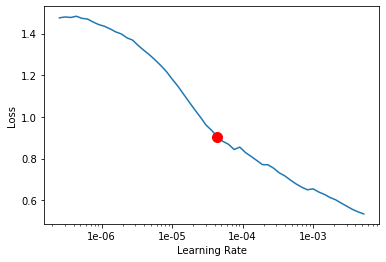

4.365158322401661e-05

In [16]:
# Find Learning Rate
model.lr_find()

Based on the learning rate plot above, we can see that the learning rate suggested by lr_find() for our training data is about 1e-04. We can use it to train our model.

We would fit the model for 25 epochs. One epoch mean the model will see the complete training set once.

In [19]:
# Training
model.fit(epochs=25, lr=1e-04);

Here, we can see loss on both training and validatiaon set, it helps us to be aware about how well our model generalizes on data which it has never seen and prevent overfitting of the model. Also, as we can see our model here is able to classify pixels to settlement or non settlement with an accuracy 0.70. Once we are satisfied with the accuracy, we can save the model.

## Save the model

We would now save the model which we just trained as a 'Deep Learning Package' or '.dlpk' format. Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. UnetClassifier models can be deployed by the tool 'Classify Pixels Using Deep Learning' available in ArcGIS Pro as well as ArcGIS Enterprise. For this sample we will using this model in ArcGIS Pro to extract building footprints.

We will use the save() method to save the model and by default it will be saved to a folder 'models' inside our training data folder itself.

In [ ]:
model.save('25epoch-1')

## Load an intermediate model to train it further

If we need to further train an already saved model we can load it again using the code below and go back to Train the model step and further train it.

In [7]:
# Load Model from previous saved files 
# model.load('25epoch-1')

## Preview results

The code below will pick a few random samples and show us ground truth and respective model predictions side by side. This allows us to preview the results of your model in the notebook itself, once satisfied we can save the model and use it further in our workflow.

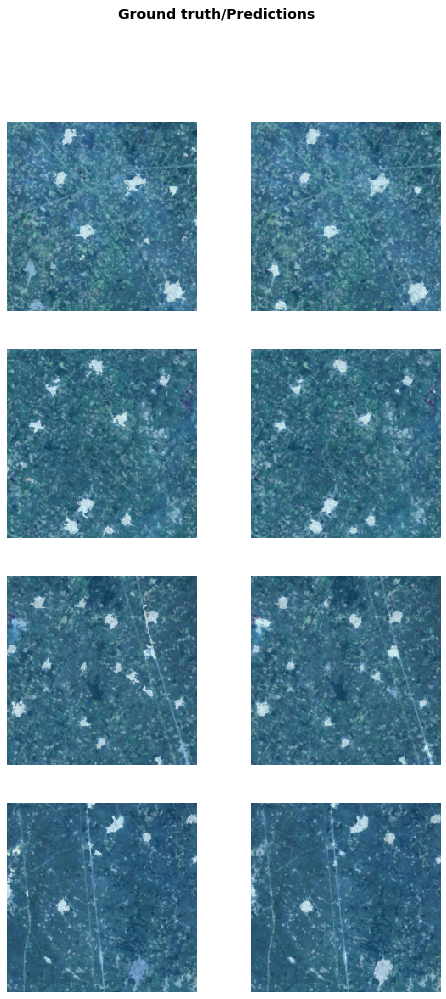

In [20]:
model.show_results()

## Deploy model and extract settlements

The deep learning package saved in previous step can be used to extract classfied raster using 'Classify Pixels Using Deep Learning' tool. Further the classfied raster is regularised and finally converted to a vector Polygon layer. The regularisation step uses advanced ArcGIS geoprocessing tools to remove unwanted artifacts in the output.

## Generate a classified raster

In this step, we will generate a classfied raster using <b>'Classify Pixels Using Deep Learning'</b> tool available in both ArcGIS Pro and ArcGIS Enterprise.

1. <b>Input Raster</b>: The raster layer from which we want to extract building footprints from.
2. <b>Model Definition</b>: It will be located inside the saved model in 'models' folder in '.emd' format.
3. <b>Padding</b>: The 'Input Raster' is tiled and the deep learning model classifies each individual tile separately before producing the final 'Output Classified Raster'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to predict accuratly. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better.
4. <b>Cell Size</b>: Should be close to at which we trained the model, we specified that at the Export training data step .
5. <b>Processor Type</b>: This allows to control wether the system's 'GPU' or 'CPU' would be used in to classify pixels, by 'default GPU' will be used if available.
6. <b>Parallel Processing Factor</b>: This allows us to scale this tool, this tool can be scaled on both 'CPU' and 'GPU'. It specifies that the opration would be spread across how many 'cpu cores' in case of cpu based operation or 'no of GPU's' incase of GPU based operation.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAVEAAAIpCAIAAACUjZwkAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAIoRSURBVHhe7d0HfFPnvTfwY+1lWZK1LMm2vI23wZi99x4hkD3bjCakaW7vDW9vbnt7u5LuhjYJJCEJEAh7GYMB7733XrItL8matvZ6jwZgwAZDSWKi//fjT3K2jox/53meI53n8fF5twoBAPxwXXhaMIOq43A47lmffUUDGAzGPQMA+OFZE0ayaBU3Mz+m02GxWPcMAOCHx2KxyGWyG5mHEh4A7wLlPADTkVwu12q17mkSiSQUCt3TDwDKeQAeAZWVlfl5efV1dZ99+unZM2c8S++Qn58/NDTkmUGQ3t7enJwcz8wkJs68xWjJk+iu/xiGjHbPikeKQW1492jn3g6bZx6ARwda+06eOXPlqlUEIhGLw3mW3qG3p+fUqVODg4MOh6O1tfXc2bMjIyOedZOYIPN1bap30mX5/ca6IVPdkPFskexkr8Wz7pFCpBFXxbMS6Z5ZAB4haIbR2ONwOB+0Be5ZNoGt27YxmcyTJ0+Wl5dfycgQCATr16/3rJvErZl3OAa7lH+oM6yazXs9hfXmXPTH/w+PiZ4JnPQyM51hcJiVcczFXLhbAaYLlUo1cCuDweBZ90CoVCoachqVipbwIpEIrRdQKBTPuklgf/Hf/33j83mL3vynKzJSDO+tSALZeX1xwuEwJLxnA6Vcd7hGc7lT32TCprCvXwhUut+VaPIl+vwBE4NO4JGcG/f0ak9JrRSdcV+NNl9iVPlggxk4PIJoZLoz/Ta8WrevycBiErhEzIS7O+lM/yxXX+3UlQ6bKTRiAMnnxqv32rAJLOerm8ZMh6rU6e26/GFbkohIRJCGFsWn9br8PqMBhwslOfJb1D0IIZiKaepQXxtxmJW6L+pGywfNQTwy/fql4Fql/GirPr/fzEIsR1sNIn8S/ZG8xIFHQG1t7ckTJ3JzckqKi9Gftra2oKAgFovlWX0dei2oqakZGx3VaLXoNmhCAwQCtDz3rL6VXC5vamqyWq12u10sFtPpt9ds0eV6nQ69Orhnb8l8v0z3ebPlp0tZAYQJahNd/erfFxmDAilL+NjiqhEJlZrMwObXjvyx0pAc47cggOijHnvvvEoc4xtKwtTVy36er7FxfB8LI7Ox5n9cUDiCqMl07HC3amfaiEDouzqYGEDDVTYqJty9uUP5v9masAi/JUIi027W+hBNcvUfCvXxkbR5/j4XShWjTFoU2fb79GECh7oqhELSmQUCUn3J8L/6kOUz6NEUjA8WCSYiH2UPd1H9VvCwVVWDr+ePBgbS14pJQ60j+4cwS4NIBLPps2uyMgN2WbRvNM76jyzZ2SH78kg/EdnzlgF4uNCimMPhdHd3m4zG4ODgTZs2hYSE3PmlOJvN5uPjQyQSK8rLFy5cKA4JQafZbLZn9ThoG/7KlSsBfP7mLVskEkltXR16EfH19fWsdrkt87e8mNFqHrJjwwiuGZutuk39frb8d9nywx1GBLFeKVRa2eSdMbSEIPrr0cQvilUSs+1CpYYf5bdLTErgk3aksn8c4fiqRu+urDho5BdiqejyZTP8fz6H8GWxxr2cxKQsCHEuZ2En3t2E2K5VquzBfo+Hk527x/ivESGZNVpqCH1zGDUh2O+1KMK+EnW3wVLXY8YynftumsVkI7YBpUmOISwKIi0Ipy0NJN/6i/QJFtF2RlPQjR+bS5e2ars0tr6esa97rM8t5awQkeZEM/80H5r+4FsXExOzbt06tOG9bv36yMhItMXuWTEOg8GY40Kj0VJmz54/f35UVJRn3a3QNjyTwVi9Zg2fz9+5a5e/v39aWppn3SRuyQUe44PXW+Xum/RYbISQsimCbBjSnpJYEL25XGlPq1W8cLRv19G+d6oNFKxdYzQ167EJftdPGodP5uH7BoxK11wQm+SPddUXfHyCGQSM0uz+SCGMhWe78miyTry7xmZq1WLnBZCIN2obelOV3JpRPfK069V/3WCkYB0OhLgxArv3dM8vSrRtOvSkceuT/Joa5Qu/GsgbsWgsDs++13EpOLzrfLAkLN7qMNntEpVJTyVFoU0CF64v1OnBd2HWrFkvvvRSWFiYZ34SaFHPZLHQ/3rmJ/LYjh3otcPdhkf/u337drTu4F41mVsyz6dTY2mWTLnnwy0alRDLJ4X6YpwtXwKGjMW8uUpw7MlA589zIRk7+Yl0DNbm0N08J4feguCwd34Y4DBY7A53/p18MJ7JiXdHrHap0eHwGXccnA+BgHt9xc1Xv7CNE0nHvrRJnPY4X9mtXLC/r8uEEAWM6lcC3wnB/OpI9/t1es++d+NAq1DXIw/AdwctyT1TkyMQCDt27Lj7PTm0vjC+AU8ikdAC3zMziVviSWaQX06iHsxT1OquF5J2h+cCgCPOYyElEr27DEfQUtaJOJdpzeszuaYRw5i5SGYR8snuZkeT3GC2Ozcb01ry+wwUPkXgWn4DEUeYcHcmkZJCtFzt1JtcLzJmdSAEUgrNUdbjaTWMecpw539DAn3/tsJ/Ht6Up0CvLA5fBun5xfy3I/C1gybDPT6Y9wnlEOkaXbnr4mC1WK60/1t3UAF4JNxyDw8VKPSNsen+WaqtkJubhoxlUmNOnzk63Hc5nxAqwOfmy09LzcMac1bLWA8Wn8DARQlJPRXDRxRI97Aho1WrxlH/32I/Js6np1eb3m/tHtT3aa0FEm2Jjvjb5QwBEaOR6c4rMFsjKXSss7i/dXfN9d0xsWGklgrFh90mpcbc2DXaS6JsjcJfyh1JH7FIFabqXr3EgQujmv7fCWXbmBm9agjYlMcSCWk5I/kyc5nUUK92rElkJNCQzBYthsdYwcN2dqnLrcQt4WQqBjEYjcdrTcvifRNF5DC87Q9XlJ1mW22fUa3Ul+mxW2PhHh74QbntHt7E37dXqE3taqvZPYPBRvOIXFfb2mC01A6ZXcuxyWKS++agxWgpHnIuw+GwIWznh2rodF5B3y/l1C8XUnp1ztI2mEMORtOGMlrKlfaEAOKNtvqEu6MMOkuTwuxspyOYpEDnR2vjzsr96rYGievegQ9GyCKE+WIUanOj2upcj8fPExLwCNIjM4wSCHEMrGnM1GbCRLLwrte1NfSaAwNIfnh0xt4hNQxYna8ePDa6tsD46WOBcyf+TASAR9Jt37f/tp6xcWf+1AaWv/tTgEeArSBn8Pda2uHNjNs/LQXgUQbP2IyjNfyuctQ92SZRf1Bt/dFiXwg8+GH7tsr54cGx7DHc+pBp/p02W1nTaL7Cda+PiF0V6ZvAePi/CgC+X99R3R4AME1A3R4ArwaZB8C7QOYB8C6QeQC8C2QeAO8CmQfAu0DmAfiBc3ieiPPA3NlHBwDgh8TucODxeM8MlPMAeBvIPADeBTIPgHe5d+btdrtGoxkYGJDJZCaTp08bAMA0YTab0WyiCUVziqbVs3RyPnqDYbJO9tBjtTQ319XXGw0GAoFgsVrtNluAQLBo0SI/Pz/PRgCA7wMab7VKVVlV1dvTg8FgsFisXq+n0WgzZsyIi48nOkd78DCaTKMazY0e+CbN/NDgYEVFhdVmi4mJEYvFaOYdDodWq21ubq6vq5s1a1ZScjLc8wfge4GGsb6+vqG+XiAUxsXFsVgsNIzoVaCvr6+8vBydWLp0KZfLdW98W+ax//3ee3dmfmxsLDs724/BmD9/vlAoRF8APQp6ISGRSCKRCD1WdVUVuhmPx3NvP/3pdAYfT1fXD0Kn0zmwBJzrEmcz6Qwmy43Z+2MzmRy4+9jR+WIWgrObr4dj/BvxUq5/P7QM88w+gtAwokVvU1NTSkpKcnIylUpVKpVtra1cHo/JZEZERJiMRjS/aGnt/ogOLbnNJhMaXvfuE2QebbRnZWWhV4Vly5ah26GzVZWVtXV1aNrdvym0Yo9Op6eno5eD20bMmCa0so66sto2iZNKh/fj0uU5B/ZmKZISwkkP1FfAQM6+35+XzJsVR8QhA02lx44erGzppgUlczzdCk5A2ddYUdXY5ToHudZG9Wc5X3qg4jd/20+OWCaa4vAZY0P7//wPbejcUMaksbdbDO31NUocy59yfRvDQHl1F5nJJl8fdOyG8W/kQZi0kta66kb3r1YiGdFz2f4P/RIy0FbTY/Dl0r+dWI4Nfb33/9poi+MCHtXYDw8P5+bkrFy1Kjg42B3eyoqK02fOzJ49m0wmo2UzGkyr1VpVVRUeHo7O3pb5Cf610H/K0dHRpKQkdBoNPHo5KS0t5XG5N/ZBoZeTOamp165d88xPG+hFvLPw1PGMbBWOw+WgP9SmjHzPyP3/BvHCJ36yc5krJ7r6gquEuCdf//FLMZ4+CCY20JB7tUrmx3KeRvvlf/39q8sGix3hxLz47FN33/F+oZkvv3g0t7HfM4/S9Xxz+HSnfIIbruPeyAMxabPPneux+rp+t36j7fl//N0fa2WelQ+H3dJff/VqfqNn9qGjizY8+9aCsMmv1tMeWgZHRkaO78feaDR6pq5DqwBjo6MtLS2e+XEmKOfLyspCxOKQkBB0Gs1/xuXLaCVh4cKFtw2Cjca+orw8JjZ2/Fd8vne9FWkHM4a2/OjF2eECtA3C5QoT5sfTEETdWVmjZsxNdpbzg61lFfXOkkpjIfgz6e4Kf1tNYV1zp0Qqx/ky/ch4k7wjv6wW3UZro/mzqIqeToWFyKdaOxrLS4qrh21kkg+iHOixMth0gvPXou5vq2xV8oT+N35Hso7yTrN4y5o5AXxueLi49txpW9zcEJKpX2Xz9Wfq++qqJBqOP9PZ3jAMFNb0+rsKTFVnWYmrgmKnCVhUHJqxsuJKdvIitJy36pUdjVXOkxzQ+HH8yXhPjQXNfGNJnjVo9kzx9b789NIruR1x8xcIGYQJ34iIQ0f08pqGHrtjrL6mpqNrwOrLuV5N0HeWlde2dUgkMjvO2CPVBXDH3a81aWvKalipaxfFBnO5AVHxKTxL9cGzzckp8VSCs/xoLM9GKwEDGovnrTn3kNVVlbV0SIb0uEDXofoaq6U63Gh3WW2LZEilI/lxqeP/ghz2gZaSXpt4XrzQs8RFK20oqmy8+ZtBT1TeXVBWgy4ZGB6l83jOapReXlbeYrWNNdbWGfFMpq2/ts+AUbaU1aG/0iGaINC5n0krH5SRuXx0Gq0Oto9YdT2V6JncPIiTqjy7BN1HY7Gq21vNNL7vg9UPvwVmszk3Lw9trqNFumcRgnR1dnZ1d6MhvbEQbd6jtfLGxka0tX/vcl6tVvu7RsOz2Ww52dlarRZ9maLi4vzr0DoDel1BD8HhcNBqhnuv6WE0Jz03aNHSEOrkg9MYBjIr+tEmEJXqe+Xg3vRaZ/EoLTl2PrvNh0q16BU9UvmYvPubA6eGEByVirTUtKHFpb6r+GxOg9GHjMGT0b9t5954R2P2kTMF3a6D2ntrr2ZVdE9Wx8VicQSidXTUiig7z5xIG9Ajdoc96+sDJd1y9ISqzh+6XNJtQU+j4dqnR8tt6MGtPd988fVtBXXt5cOXqgeIVKJmaECm1XmW3hWaignfiN6Ktj06jx3cd/BMtg1HNQ/VHf/kkx7XIaUNOYdOlzic59D5xR///GV6mbN6MjlxymauqrFVidalVIUH/3m5YoBApQ5Unv/obLVrvfSbv+6vH9ST8Zby819l1DqHL5NUXPryy31lSudvsb/01OFz2dp7fQSMpvuzA9fGMHiqfeCbQ8caBgyIVV9eWUcmEdGDoP98Jy6VO9+UVnrlQtqpvDI9hoH+W4xJG//6xw+O1Ti7dh9tu/bF1xnO36izqnKmdsg5fom+K/+fez8skjnPBD3IkYuugyCqvAP7cxvlBKpvb1naJ599mtfh6Sh1OkCb7mj0/BgMg8HQ1dXV4aLRaNC0dnd3u2elUik6y/b31+sm+Du5peh2M+j17hv9aMUA3d9iseTk5LhXuQmEQrFYjL4w+pvSTXTQ741J2iGnrhLxJ8ueE1nwzNPbnBN2i70zM72iY0sytbmkxj/1rcWpAe4de6pONuu4v1i4gI7HpKY6l4y4lqOBD4+Na2QzlKFxSUkiijr242ulpjXReIu2sVWVuCRqkgqPpbm+WkmOWs8nIdcH1GKHxD+ztW7fqUvCpZzzbbQn39pIxwxnZFbGbHhyZXIQgqRq23+ZUdH+6oIbIxwNVJb2RT/79Pw4f8R1SlMh7yub8I24YQjkeWt3LUJruTN5/b/bW9E6Ioq1nD+WNXPn7uUzg9FzII327uv0bDwZAokuYNt6h0alQ/XX+vxe/u+nRegbFhH/8MezjVvjsBfPSAOW/GT7IiaCxPvpfn0qMzb2abSssjDi18yfyaLg4sOof//9oZo5CYtD/T1HnIA25+S1oOVPr18YgUUW2qS/u1bSGLE9ZcnaLe7VkayRPxyqVi9OojgPPRQa9eqqOc56r06J1gnCVy2eH80jIrHk/P861rVsPueW18FQAuM3LHaeCXqQX+/LUy6JGWzMOt/m+/P3dzoPEccZbG5zbzpN6PV6NHdoMX758uWCgoLrI0o5fX34sHsCrXq//PLLXB7vzjo/aoLMOz+Kd41bEezS39+fOmfO+EGzfH193bPu0t69cFrA+BDweAr5HqeEVoZzz3xe1qXRyvts0XMRhDZ7fuzxwx8O1i9687X1dAThcMOZ1kN/3/vpotWblsQJJrmCYINnpIRcO14xhKT6NLWpSI8Lbh8nrL8i7e8jpWgEfMih2196PJhBuZF5dPfA5BXJZZ98eKRjzhPPx/ghpsGWkop2guJQY4azGimTyPg8g91+I/Oc1BTugUP/kMzZ/Mz2lCk2RjncqLu8ERyWxWG7jkT0C/AnDY3prEpJ9xjzRiyoIpH/vTLv4bD0djcqhpVfv/++c9akHdTotSOarvpumV69//1C50L9yKgx2OgsXyni4GAyyfm3RySyg3kEqcKIhDo3mZimraROihs93lng/M3ohvpJKXobWiDjkI7cQ6eK+006+RjGM2wrDsuODL3xD4GhUjh0uqvSR+Xy0Gqc4bYMYFgMDsnVOsMxhH74GqvZONzfiQua6TkEhSL0pY+5p6cHtPaOlvDoxOJFi9BWvfuZuYb6+vLy8ieefNJdt0czLwoMRMvjCT+emCDzDCZzaHgY3YdGo23dtu2bo0ftNtuSJUtua7ej1Qm5XD69Pq7DBwZQlY2SoVnBYZME1dZbeOaT9KZZa556Z2dIQ9onaYPoQhwj9ZmPIvvPnznx7k/Sl734i52zk979fRL693Toy/+7GLHr/15e5t75NkTejPlxfvWdvb6yUlbymjD+7Q0KYcrGt19cRpykJegwm9C2q9Fqwvk4t7D7YBBW8NOvvJ0gGpdordQzgeCTHv/PP6SWf/H1id1vnXvr5/+RFOS5HGB8MFic3WS6pQaO/ttTKegf/JTeCHoBwrta4+g5EEnojp7ru82MVuvvMY6XcVQxgmGtCKSPdTpIkcvffXO1ZwXKIpPY7THrfvTq4gDPEpdBxDU4ketfyO783hie4Hr1SaGFGp2//cW35oTc/JBI3d/8yf4vceHr39zzrE1W8Pd/NbmXo83YSe4v4fF3vU+PwaCn4ZqwO/xZ10cysliMjnt/s+27hDaoR7VaNH1oA9zdBkcpFAr0v2FhYSzWzfEZ2tvabmww3gS/65CQELSd4P6aLZfLXbRoEVrDb2xsRFsI7g3cJBIJ+oc1zT6ro6YsjGjNLVYY0NbxROzmzvZWWuy6xxaHo38YCpXyRssEzxA+9uLbj8URmls6Ta43Gr7k2f94fr1FUtGpcm0xAWJoQsxwybXcurHY5MjJbyFMxG5pLMopHQv60bbY5oxzaFsa4xsehFFKFJO+GIoaPPv1N99exFGhlRTPIvSfkEAQB/KkHb2eeeenUQM2iujGaKVTeCMeGF8+zagYVHq2G2prudcehoassxbeLDGbERASiEGbVp7lLni/iDDmQFP7HZ+b6BWKEYvrn2hsdKBDQYjk3rXi4hseQtH0DMnG//0ZlE3DhPhnHluA7mkdGnL+yT8UGCyDx1ZLOtzDlZoUIxKlZ1jWaQKHw6GxR9vdrsvlpNAmeWdXV3AQ2k683QSZj4qKwmIwJSUl7u/hzJw1C63bd7S3j8+8SqVqaGhYtHixZ37aSF65c7lY/cWHH+VUNjQ2oD8lJz85f/MPEUMMnRGhbqooa2iouHqmoMKdE3naN+mujRu61IzEKG5PR0lmRjE6W97YGzUjkT/50Da+ISmU3qw2SkJy0P1FflhSeimnb9NTm+eu3rqQofzyRJ4Fx1q/NT7zs6MlrjPJuJTRKh0flp5jnztPsra5U48LS4oZd6nFUhKXrgsczf70bAm6QVVOxqdX2zY+83gAEelsLZziG3EjkoLWLmEfPHgS3aUx+3RG24T3rqz9bY3ODWorTnz2WbF1/vNPrqTg8cGJS2cFKT/96Gwtuqqy5PDlKvR4KZseJ/TlnjyXU48uLLl2uarPdQRMf2X2ucwK9CBXT50TLloaxLg982OybudLoD8tHToTdcXG2cWHv8mtqEaX5GVlNkm1fsJYlqm/sKa2sSzzi+OlrlEKHwpCdPLiIHzDFydyGmur8vNz+5UTNIm/X/Pmz68oLx8ZuXlzBq2Do1H1zLi+pdfU5Kz4hEdEuJeMN8FndejOfD6/qLDQarEEBASgs2irPiY29sZB0Sr9uXPn0LbEjBkzpt3Xb3G0sMTUKJ7PsFyj0+t1eiszOCREyCZT/LgCoZDtxwoMCaIhSrXWxzdk2eYl0UFiDsOXghj65Ep0+4j5GxbGBxHtRrVSqdHrfdhxmzbO88MgeNfufH861gdLorO5fAHX1UrEYggjHfWMeevmXq9p34AjUQICxQJ3g/kGHJHuzw8UciyKIUZUYmp0GA5D5ouFJCJOJAjgh8bGB9GGXWfCCoiODOfgcEQqgx0kDvTFY/BW7ZBaa7Jhk5atiQtgjv83w/vy42LC7Go5es4mhJq6YkNioHNIUJzdPOkbwROZPBF6Jq4PobAYKsv5phhUfnhiLAc7oFDrSMEpQSaphrNoduTNL93giARf9Ndldv5uDVZh/IKNS2N9Ca4P5fC+4TERDPOYCl1lwsUlRrOoRITESYoXOrQaLbrQykyZH402FXpry9H3kMp2yNVaZuiCVcsS0XfnPryTw06ms6h4ZNT5z4fu5cNgsYOj4uKC/ZQq578pgRYcOyOATGaKOVSjVjtq8Z2/aWmcKFAkZONJNDpXJBRwXJ/lIRYMmcPnB/FZrsNj6EyuWBxIpVIJvv6uX+n4f1Z0AyyXzRaIhAQaOzY61GdUpTHZ2cERmMFOetK6KM4EreDvC1q5RhvqhUVFXA4HbYCj+UXfFJfHCwwMRGsBaFFdV1tbWlKyavVqd1X/ts/qJv2+vV6nu3DhAjoxd948BoOBvgZazuv1erTa39LcjF5p0MYD+gLujb2Wfqhi35fZG559NVI4xS/WTXfoBZ3G8Hd+gU8v/2LvXtqCp7YvjJ7kjsQDyv/qT3X+K3+0Mfn+qkbfFateOaTDOb/CgCB91Rmfne5+6X9fC364v4KHAW1u5+XmxickRERE+NJoiI+PxWzWjo5WVVXZrNZly5czmZ67ElN9xgZlNpsrKyu7Op23btHAo5sRSSQyiZSUnCwSiSbby0vYLYbCK2fKStsCluzYuiSO8oO4+qFvquDkP4uG6Dw/PKLVmsNTNy2cLZj8a78PZrpnXtHw5eFrWF86YjP5IDhW3KLN86I966YZtHqfn5+v0+nsrnY3WgZjcTihQJA8cyZa8ru3Qd1H5t0MBoMVZbGgFxK0nY/Gfvxjet4MLRCUY3Yai/3DCLyHVT+CvivnFOZbemvolWXMjKFSJ/tA4/tnGFWPGpwfV6M5YrLdTYNpCi2M0YSi/0VhXKUy2ra/rQJ+35kHADzSbsv8NL6CAQC+BZB5ALwLZB4A7wKZB8C7QOYB8C6QeQC8C2QeAO8CmQfAu0DmAfAukHkAvAtkHgDvApkHwLtA5gHwLpB5ALwLZB4A7wLPzyNaWd+gzCaOE0NPIOCRYLM7hsasZVJdp8pssDrQ9DJJmLmB1BkcEmWi/j2m2meGVa8szr7cMezs9JPMi9+2YfYjEQm9vDs7O1vmGoWAKYxdsHQO5x7nbWvK/uLve3v2nP7NXUZVAGD6yJOMNctNDAohiEFkUvAWm31EZ5EojYjDvj6KznN3ADrOVPvMcJgNLW3Dczdv37lrI7X5+D8P5upv6d7+Ybr85V9yb+0Z/YGZtPKynBLe/M07d+1atTBhCl25YWOWvbj30J5gz+x3y6rP+/qPP917xTMLwF2hJXxW12jziGVJOHNhiJ/JZs/pVOd0qR0OZGUkM4xDPd6gHtHdo+PvCfq6drMbR2tqGoOS5wj8GDwhpqxQEhZMTD99oaK6WmGhC4Usm7zjYl7H2FBlRmaPKM6/6dqla3nF1dWDnMggOgFXVZLdPzCYl51ZLhnl+xFqci9kFVTr8P48Lh29Co115H19NrOmupMXHTZcnJaeW9rcMeCgCIKEjLbCC2nXCntkZv9AEdGsLCyoGFO2XbzcSOH7DVXnZmQWVLWOMAUBDPLEaTaq+kuKq0KXbo7mUAgEPNbHUH4xrXtYXlCYW1HeQxTyLN1lmbkN/uGR6NWwIe9iRvkIkyDLvNImShT156UV18va20olKkKQyH+4qTDtwjX0/faN4cUiLg7jOVR5RWFpSTdRGMCh2jvyLhY39NZUF5aVNRr8hNraCxezSgfURFEIx3l+up4Lp9KKyisG1Fh+CM+m7L5yJl+m7snMzG1u0wbHibVNOZfyK6TSQb0DLxQJB2oyL2bkVlW3Y4WBvLsMswm8lURlLu83LI9kssj4DoXxRJ2cS8P7EnHZnRoeDR/FoWiNtl61KdyfiB0X6nuPS3sHk3JYx/Bnm0YU0cs2rl21rPHqkVa53qpXVWcc6iFEb9iYQlSP4ThBK9dvnMPvPZXVhFYIpKWnT5cPrlizMtRY9ce/HTSKFqxcHHnl6DeSYXVn0YVDReolGzcum4E9dKyCOXtFRGDAnJWrk0L8GtIPFw/RVmzcyFHXns+us5gN1Zkn0qWsDRsXYmQ1BTWaBas2zo/m2Mx3HxjTLOvrlnR3Dyv1dsTUXprxdUHXsmWLOKbqffuuEVmkkpz04na13aKtLbqmJBEtqt7CK/kqxCrvqD58JtPKjEmM4Elzjn+aVsGfuWL1oqShvM8+uthqQ8zOQ+U0J86ezzGV79t3RYtYJbVF54o64lIWcw21e//n3VqfuA1LQy8dPVLUqTIN1n1x8CQiXrBh49ymY58evVxnMIyUXztZNETZsCKxK/f4yZw2ethMMYuG4cWtmB2N9GUdSKsLSlq8ck6sj/7fHzIf/ACV9ut5dBLDNdTfgNbkT8GviWStjmSKGMQ+jRktvGcH+naozP3aScZxcrlr5o2yzPOnjx07eDJraObKRWGJKY6e4rz8fKPW3DnsGtCHEjFvTiSXy6JzRNF8YlVxbn2vsruszVlNp3Bmzk7154hiIsQcf1FSYrBQGJ0QTJIpVZ3NtYND/eXZ2QWtA8a+UsUYmUXDkX2ZXNJodWXjiEZWnJ3dplT2drSPGR0IQbR8QRT6EhwqxTDWXd06IE5KCuNznK8+KWt3bVlpWVl9p9zVHCHFxSeyAkShoQE4+aBBED03kFZfWa9SttdJqbOiReNbPwJx7OzUOB7dVFdVbfVPWZgULIxIWDxrhjT/qsQ5lhcpIjJRECSKjo1CD+Ua1wnD9hcGBAfFpaZyffxiU2O4oXERGFlP72BnW0VRtUzfW5adXY8wzZ2dvXrnEfxnpURxg8PjgynDXUMmPJnjT8XgSFwul0jFaaSSqvKSIZo4XixyHhuAWw2OWoV+nmH3kgS0XYkcGhFrtyNok55JdhbtRByG70voUbs77Z3YXTNPYCanps5JXfnUy0+kirSn9x+S4QToErbv9cH+rg8B25p/4su0loCoxGS0SeG6CCE4LAnvvIdIJJKwdBpaT8VgMCTXoJl2M5EfkzInNXXhkvXPP7Pt5kAvzi61SdFJieiqZWt3vbxtgbMzZAqZ4hoqhxG++PkXn2LIsn/7t68ah24O7zoRypyNu1ArZwdP1ACgz1kY2d/VJq1vZMTODL11PCc8nuIc4dBms5otPiR3Z8wYAgHrgzFaJv41YtBdsJ7Lxo0B/53QI5gpAdGJs9C38/gre3ZvT3UNfzopqmjBr/7zOX+d5PA//n6qZsCzFIBxTDaHc7gRFyYZx6bilXprWrOShMWEsMju2jyXShh1j7g4ibtmHoNn8UXikBARxw/R6TqHdcKE2eFsRCG7OUCim04+bGYHx4eJNKpRg/GutxBwRHG4n7JJ4hcSIg7h+tiJdAqOQiDrrTaEypwRipVKzNyQEK4/HePAEvE32yRa5ZAeJ1jx+I8X0eU1bf9WJBhxC0L09UfTCgXRyVzaRJ2sE+nR0cFjkrpWucmqVzQ1tnLCZgvuczBOliBMaJNKzST0F8jyw5t1PoTJ+nPX6ZwjIso7tbzZz73z3tYoRXF5u3sNAONhfJDbRqa81qHqGNEvDWOgDXv3Ep3FhkO3m9ykmfchkH39/G6uZsVsSsV99ef3/3m8ThgZ7Cy38WQui+LeIHbuPFzL2b9/fExH43H9qejfth/dzz1mAQY9Dtk11DCOSKXRMD746FWvLA3q//v77//pr/vaXfXjmOTIhmMfnyoemfXEz5iSk39+//19R88pTFjnvnS6+yWsIw1f7f3zB3/5SMOblRojdC2bAJZI4XJwmQf/8cH77/9t3+FOuZnhz0JPxf2G6FQiWtaS6WELkgV2bNSsZGfFHk+mcbl0LIKhsLjoBq7DUGZs+NGmUPWXe//8lw8PKcUbntyeQkcw6KFcG6BvnYZOjN/FfRB3DYfBZqKLAmJXvvFkcubRz9Az+fxEhtqGxZN9GWyWaxv3oQgIjoJWA8RI48dfp7d3tH/8t/fRjRvsUU8vm+HcCoBb0fCY8WW4xmhtHzFEcSk8X0/gHehCg5V7x8d148F3cgB4ZJT06epl5k0x/lhXSW602BuGdf4UfBCDiC5xOJw39kp7NY/HMljkm7VKGNMCgEdVLJdExiEtcvfo+IjeYqvqH5NqTO5SW6G3VPaPJvBI4wN/J8g8AI8MXyJ2TYRv3cBooUSDVvLRsp2Ew6BFvsnq6FEZ6wbHeBRscsC4O8kTgbo9AI+YwVFLmVTfJDfx6QQaEYtW6dUGq9VmSxVS4ngk9Crg2e66H/gYlYdqRzxTj7hnE9meKQAm0q+1NMmMSoMVh/XhUnEzAyhU173yO/3AM8//Y6Vn6hE39F+zPFMA/Ht+4JkHANwG7tsD4NUg8wB4F8g8AN4FMg+Ad4HMA+BdIPMAeBfIPADeBTIPgHeBzAPgXSDzAHgXyDwA3gUyD4B3gcwD4F0g8wB4F8g8AN7FyzJvtxh07nGvbCad7lsbdBOA6ev++swwyTsKqtsMZme3+jPmrAq71zjPD4O2JC3P1d8VjhcenxQpnGiA7Smz6jMOfJBuWvCP3QnH/ufPXSGb33hpMd2zDoAfpkn7zLDb7e3t7VKp1D07OjpaX19vsdwc7E490nHsq1Mdo4QQsZhP1vzrTx+VSlxDUtxptOPjj74q65xk7YTUtX/9y6eN0lvGZtTK+05/+UneMAZ9xUCun2ZA8vCKZs7yl157fNmMGwNn3c1ox74P92U3PZzRsgH4ft0ci1qr1X726afNLS2hoaFEIjEnJ+f8uXNkMlksFru21Gfv/3MdKem5xzeECLmC4CjeWOG+s5KVq6J7y8r7DCQ2i2pU9lVXdFI4xL7a3MzsUp0D5y8IIen72iSDGnV/Q11z94iey/Yn4IydZeUjiC+TTtL0t1VW9/ty8bXF+elXy0wY5y4szygc+uwv/lXsM/vNp1YGC/l8YWBoSBAJiyAWdV15RVN7p0QiofFCqO4BPAwDxQUVHRLJkErnx+IScVZ1f0dTx7BSKRnUEvxZ1IHG4qrGjl5pX29XxxBOvG6OWNPfOUZgsZmYusIaK0ZTWdkgkYz6h/DQqouso6qstkUikWosODbZ2lGbm5VZpLQRAgJD0XMzKCVlJdWdEqkeofgzqRiLuqG8otF5Pp7dAZhWJh2L2tfXd8HChWqV6tSpU+fOni0qLBSJRLExMZ7VKklZn2VG0hwOxTWLxfMjkvxG6tpHdc1Z587kdZjQonqg4cSnJ7rNGAyeZLBgEBwRbT4rO8s+/fBf53PacURc49VD/zxTjF5eKi6eQXexIHbNQP3xT08MIQib5hyJkkodV+7qeio6RmcnxzAoNwfiQQ+YfXL/iaIudEuf4ap/fHFqQG1BWxyHP9+X12NFF3bkHP74bInBYukpv/Th3q/ymxXOfXrKDx0/i5bTBJxB0i5xjadnbMo+fz67WW2QXf3qb787XE7F6gtOf/5NRhP6Rrrqm21Uql5Wc3TvsdveDqLqPPTlVz169LIkPfzBZwXd8s7S9I8uVKMvbetpQ98IANPczcxjMJhly5bt2LFjoL+/pKQkKirqhRdeYHOuj/psMul9EArVM0AdujmJQqOihdwdA1374MnhkWFMX19xdFKEwNmE8OWGbHn28QXzF2xanqwqyUezfhsshYXuQiD5iaMTb94jGJHLMT7+jHFj5qFXi6Gic9m6TVs3pKamLtjyLLv5UkZtZ0vV1ZwuwRsvrEIXrlm3SpVxvHbU+Rr+wvB1m9YmhtLKLqePMpe9tHPZvDnL56dE3DGWF2PB8oWpi5euTGZ0VXehrYvkFatYNh2WxDXpmno0xOtvJzGCi8m/eKJKxgig6MwWPwatubiiT9nXhcMhFgJjwdPbIz0HBGD6Gh8oZ+yTkpNXrlwZFxe3bt06up+fZwWKyQrE4uQy+Y3Ajo0qxkaJtCmM1orxoZOcQ2tgiEQqDqfz3Di/Jw5HaLWNKFTjx+G0j47pSEQqwVmhx2Covr5mg05vHhszUak01wZ4gi+RNDY26twJi6UT0QuIw64zmuiie43uccNox8EP9xd3q9Aku4fVvslh1+sNVhwRLdV9GexlO998Yml41IpnXljo++Vf/vi/vzniuRcCwDR2S+ZRaOyXr1jxwosv3izh3YjBSxeLWrPTm4ZcY2XppKUFtaw1G6PxVDoDZzLobHZENiDRjLk2RlltFptnUGq1oqu3T2+16Lp7exBqKI9BQXfRG0w2u2NgWDp6Yyx5q81kd3imUZQZqxYzi6+ca5M5rzNWvVah1uL4YqFhsHVQiS4xDNeoHOIwob8wLMhvuKVF7dxssK8JYSQGsce9LyyVwaD01FQPmRCTXtnXL7/bePwIopfUV2odi5ZviQ11jlrrYbVabDYE7xssFpLNVnZ0YmrqrBChmEUjm/Cs2OUvfPTBboYhJ7fi9lG6AZhubt7DG2/CT++YgZEcXXNOSVllWXluZoZP+JbtK5P8yBQm31HwTVpDd/vQiHZk2DRr89IAImG4Kb+iqdPCDOdZe6qbBsd0PaV5BU0Dxnlbdibz/WksY96xtJb2BvWoeWDAsmDHcn8saaD2WlVLN54bKeZ4WvXskHjKSN3Bs5mdzXVlZVUdCvuM6MQ4njYrv7y2qjLrSnHIpmeWJ0YyWIJAXOfnp4o6Girr29Vzdj6dKqQOt1TUD9HmLYuj+WBZbJa64XRmeXdzfb1SrdXTI9fPCewqKxgghM+KZ1RfLvSdOT9BSJNWF7bqhEtWzeopyaipb5ENDw8OySIWrw9lEjVdpQXVrQ5OdEpsuG0g/+D5UklLdW2vnCcIHMj74tS1ioqqah0rafvKOXS4iQemmdvu4d33mBZ2i8H9+TyO5B5g3smk06FlOoZAwlmNGLJz/HmUuxKvqk/7NF3z4189zzQ6i30MgUx2fcJ+5y7uI9/Y4IYbr3hzb5tJ5zoagUy9se31NsONA9h1Osu4c/RsQCARrEYz2Xmz0LOB3aAz23FU5zDyniXoyTkPjyEQMGYE73kJ9+7uu4w32ifOF8NY3CeDcq8FYFr5rsexkZYcc2b+/14ReRYAAL5T3/U4NkQ6NzAwACq8AEwTMF4dAD9wMF4dAF4NMg+Ad4HMA+BdIPMAeBfIPADeBTIPgHeBzAPgXSDzAHiX+/hOjkmnk3dXZ+QUjIwhBFb0i69s9XzGfyudwXL7N+Ynd+fGFoNO2VZ0LLPaYLaT/FOf+/FypmfNfSvJScMELkjkWC4eT4978slI5zfq78pmsmOJdzlz9NyGu2vTruRpjAg5ds1bm5I9KyZyX78HAL49t30nZ+Ln6iYkbTp/6Ezv8qef375+pcAu+fjrkuiUWF/c7X/V7dcOXhv0jQlm3fvP3WYqPP1VKxIQwb35FH5HZfqpTPmmn/xo0/KlyTy1Ggl44CfVOssvqajRMWLejJlJ/oQ7esq4U8flX59TzE4OJHjmbzfSXfLlhbadL7+ybuXSQKwOw2JNtiWqJv1w2SgzSsiALzmC79dtz9VNOfO2oYITl/hrX14Q4fwjZgQEYzqvlI8K6bLKKhkxNICOaJouXulG9NVnLmS1tneOUoLYiqL0VpOs7MTXp7Nl2IDIIGpL9pWOMUogj24YrEnPHbQoCo+nF7c2N2t9I+JEru5nbT0FFwrjtr0Qx3X2cIGjOwOvlQ/mX/zqxIXMnGpJ9IxoKhE3qlbnn//sxIWsnPJm/8AILt1ee/ZAkcyYdzSPMztMUX7x4LFzueUSAk6D5yWKcPL0gqrgYOFA1eWCPkPt2S/PZLcFJiczcZbqrFPfHL+QmV+DF4b56bqOnDjb1NbRqkCSQrnq1vwDX5/MySohRyYLaO4+9xDraGNdgzFlwSwKHvFlsXRt+d8U9iRHBdstuvzLFzQUjqbmwmdH02q7dGRDy6m07La2VvT3EBNArs868uWJy4UVfQHx8SRNd0ZmuqS88Pi5tB4rF+nJOXLsYuMwMTpG4HkZAB6qSfvDuwf5YJUiKD6R4dkBg+EE+WulIybdyNCgq39bm763W85M3rhl2dw5G57bsSDMNCqrLrzGWfjyu28/Lis+VytRm3SKYZWryw2zurd7JHju1o0LZ6579rVdc68/dNfTVq4Wi8XuPvfc9LWXzioE697e8+5LC+j7DlzWI/rmjFMDfst37/mvN7dFpx04pkfseuVAzwBu+8+eIXaUny/XPfnGf7z71Mya5mH3IYaGBg0Wu045UHK1dMHLe7bG6tIuVuhtdlZg3Iv/8V9v7og59fV5sijuxa1LhUmbf/rMSvNg3cki1a7Xf/buKyuzDhzpvN6rB124LCVk5MOPDxbWtKEHZPJ51pY2qQWxjbZLerV+5o4zufbnf7bn6aVhfNfvYemOlx9fIOorPFNrT3h7z56XFuAunc3U2pC28kqfWTveee2xoSuf1vrMefWnLzjaM5p61Z6XAeDb9O22NwMSl8cJyHgqN15A65N7njm/P/Kmoh7a3LlhRAQjiE8I1Q32SCWVXcj85TEUBMMQRcTQLe2jzg2D42dxiIh6YIAflcAm4xFOzNLYW7v6QZDQOUsFZEQQGm6TywwIkUuzpx34+74j13RjJtcxPPqbK5sbyr/8x18++Py8UivRXu+AG4MnL9n20jPLIuuvHPznhWqEHpwoUlW3jypb6jT8FH6gkKaryijvZgSF3+z4X68qrWysyT779/ff35dWOTwyYjIhlMDwGXw6kcMN5YXNiA2mEPzCxVyd+Y5+AgH4Fkw580xRIGWkv9/kmbXbh1RIYOC4DvNMpkn7nLJYzDYMljDutcwmTy8Tt+EF++m71epxvdhbLEbLLZ3a260Os92OcTdHHHYLQnC4OtQg4J1VY71yRGP3vJCPsyvdWxBcHek5j2E1G0ZK/vGvzLiNL73z411B7PE1C8RqJsStf/bne/a8u+d//vD+b5L5nuVOeEZE8tzXfvpjem1W1Qgxdl5yQ35mVqk8cXY8ER/0xm/eCxnO+OVvDw9Yrvfi50AsVvbW3f/x7p497/36/d/8dBeHgp4qDuPjPDcMxn3WAHx3ppx5ImfVttgrB49L5M6abk/BodI+2sxkMZGEa+nsQrNWnV8hN7hKKrNFpze4+7XrLb/cJEe0yo7KdkOkgEGmIF29vQiiKs4o81RkjSbt+PKNGrJ8Pu2bT04Ouw6l7SrpxM5IYLTnZzeZEOtAfc1IYEyIKCROqM3JbELPQ97VPMgKjBx35eFGxSkaykbQ3eVN2fWeuv2E7KNGkiAikMvoaq6UDnmKeYtai165uOERiqIsiQ69wOmaqttcrREnpbSm3DWyhUExorSS0LeD4yYHya8WWsJS0NaJtKRkmLH4sR2hhB6Fwo6YzWNGk4PsHzeDWn65DG3/6LWDLU09E1/sAPiu3Md9ezo7LDbAePHEsWu5Bd2UlP94YR2DiGMFipnyuoOni8iRcYF+/sFRQjbXrzP7XLWGHoIbGGbEGoqPXa0eTN3+VIrYnx0SYm8uPppWK5o/i2GlRsYHcTmkhktnWhGx5x4eghVEJomJ0uPHzublFzSqA5bOj45Nma+sPn3qQk6HWfjMY0vpRKI4NtncdPb42czGYcyGzRt4VJxpVI1wY9Bj0PmiYILMufsAYWuqkMgJD+TQVZpRgUiMs+lMZGEIj4pYxxQabNTMVLI858zF/FFaXGQYJyJSTPQPMNWev9SgWbJsZYLQePLoydy8MiQkNV7g+VgBg9VmHTqSUVBQWqtc8/qz8ej7x+FHlXJewrwEIQPxMV78fH9mQVXEpjfmh1CoDEJH1vkqfcDataupIznHTmRU1LYJEhcG+1O1apVIHI62P7SyUb/QcBbe5mNUYVlBPLrnLgsAD9G/2x/e1PXkHbhkmPvamuujYvwg2Ua+2fd13PYfxfGhJzwwTX13fWYQfblCxl0+wH7kqTrLPvn4MDF5Y5j/VPvOB+B7N9VyfmhoSKFQeGYAAN8CCpkcEhrqmXl4HrDf2+6uLvS/nNsGugAAPCRGo7Gzs3PO3Lme+YfnwTNPpVKDgoI88wCAh0qn09XW1s6cNcsz//BA5gGYju6SebvdrlZrJBJJbU3diEJhs9kcDocgICAyKjI+PpZCoWDu+CrKeN/dPTwAwL8PDfzwsKykuKSgoEja3z82Nma1WA0GQ29fX3FxSX5+YX9/v816y/fW7g4yD8C0NjQ0VF5ROTIyQqVQ/F3ofnQej8tg+FEoZJlMVlhYPCyTebaeAsg8ANMXWofv7OyWSHrGxnR4PG7hwvkREWHhEWEikWhWykwul2vQG6TS/sbGxtHRG2NC3wNkHoDpy2KxdHZ28vloqc7A4wlovNHws/39jUajUqEym80BggCxOLirs1smu9s3zceDzAPwXdNqtYcPH/67y4cffnjp0iXPijvY7Q6ZXO7PYnG47MSkBC6Pi8ViqTSqDwbD5XJiY2NwOHxYWKjRZJLLRzz73AtkHoDvGp1OJ5FI//u///uzn/3s+PHj6LTJdP2J1ds57DbbsEyOID50X186jRYQEBAeGhYkEtKoVCaTaTQahodlDofdap3q01tTfcZGrVIRCAQ/v3GPsAEAHlRMTAyaWIVC8X//93/Lly/H4XBoNX54eDhAIPBs4YImub9/IDQkRCaTmYwmhUKJ1uexWMyIQqHWaLUarVyhEAgC0ADTfGmTfZT+oP3kAAAeqldfffXIkSMLFy70zE/MR4NSq4VCAVqxd8Zcox0ekqGNeZ1OT6FS/Oh0dCF6IcBPuScGyDwA3xuxWEwk3q2PVwzGx8+P0dPbh0YdbRGgDXu09Z46Z/aMGVFsNovJYNis1sGBIRweH8Af37XL3UDmAZi+sFjsjJhotDCXy+XV1TW9vX39UmlLc0uftL+np6+hoVGpUqPtfJFIhNYCPPvcC2QegOkLzXxkRIRQJERr8my2f1hEGJlCJlHIaPs/KEjE4XIMBoMfgx4ZGXGjuX5PkHkApjUqlRIXOwOt0itGFEaD0e5wOOPtgxiMRq1mNDw8LCEhnsn0fJd+KiDzAExrPj4+TBZrxYpliUmJdpttbHSsqaFpVDtqt9nDwkPXrFnF5To/tPdsPQXwXB0A08J0fJZWrVbf2A0A8HBZLBalUjl33jzP/MPzgJnX6/XQNxYA3yo8Hs+f8kduU/eAmQcAPKKgzwwAvBpkHgDvApkHwLtA5gHwLpB5ALzLfdy3txg0staGwrY22fAYgrOFpO7cMOuWZ32/BZamjK8Hgh9fGe0ZDc5m0l07fZ41d+XskAlG15A3ZR/LbNDLJWPEAC6dKJ67aeNssWfd/VB3lmaU1Pn4Ja3dONs9dOa/SadW2Ih0Ohmv6izLazAs3rKE6VkDwLfuwT+rG2zIOHl1cMXT22O4dJNB1t1pDYsTfMujp1tqz37Uwn9y19ypPjOE6rq69xvtwl88luyZv38Nlw5XOOKfXZ94H19ovKvGK0dqSKm7FofjPAsA+O48aOZt0rN7vyavfHVVHGN8e0DeUpSeWzI0YmHFr35mYzLeqCy9cjK3RWnHUpat274gToSWzKWXD+c2qxykIJaQunbpMmvzpXIVYaxJEbdrPaEtK69GqnNQ5m59YuUMbk/egcLRMKKsunnAlrJ26+pZQfVnPyq0xVGk5QNm9mMvPy/GqS7mlMxdvI5PtTbmnL9Q2U3E+ax85t3EcV9kuJF5eUdRXnO/uV3BXb0xyqfp+PkqvdkUu2LXpoXhkrxTpQpfS2/d0Ch242tvxzEs105+VSnRMINnr4rHH//mlNRAXbj95cdTBcUXDznfjgObuvrx1bOEHXmnKy1sZVlf8uMLpTWFiNHe3i1hxa9KIPSU1ElIooXPP7OENCa9cvFqfffQmM3/+TeepXRnHjh+pVtHnbv1xQ3MtnJz9KY54Vr5YPqZwz1Kq8UvZPXqNalhhLJTB3vxwcqOOoNfzDPPbabImy5cy+vu0wQueezx+eF4aISBB3Vb5qc8/rys83je6Mpd89BKaWv5tZLqJrWZwuea0o/lhK584onVCX1XTymDEgz5Z2uQpBd/tHNBJP3i8auMhEh5QVqlPvSVV59OYSkPX6pMnjkLp2opaLJv+8nzMSyCD4aUvHbbvCD7gaOFi5bO1LYVnK/Xbdr50upZrKunLpEiEn2k1TV9+MdfeSVAVVosJUWLfevL8wMiErV1Vy6301746QtLEqMsNipj3EjQqq6yBlPQopgAvbIr50pD6jMvzo/g2HWmqJXbVs8Nu3r6IjN8BlbRcrVSveMnbyXRJWcLdEnBsosFyLNv/TiRi8WJEgU2LTlm1Y7F4q4sNOHx6NtZmiTMOnrONzHB2l1R3orZ9tpTERRrfvo54YInnloTW/TlR6Mxz7z83Mq+3BMqVkwgGUvgBq9et3qGT9OBEuuatSs4dhUpYdPTSyO0PdX1KmpyBK3s2DfqwDXPv7B1lr/im0MlSUtjuzLPt2DjnnjhaUvd6Q5CiE9bbg8l5dWn1nNpGCqVioWvTYEH9aB9Y2EwzgE17M5JnjCIT1TnZzdre2ryatvyLn7zz8+PtWq1eqm0uHEsdnEc2gamcIRxTKSvT9Hfp49IjCKjS0TxqaE017EQdmh0MBXB4BEfqz73xL7Dp7N0eovetUqcsDCMQ6RwAuOY+EGFDl0SMnOegIzwAgVG+YjJ3c+fSd/aNsRLjEbb9HgqJ3jygTN9gyJD2OiL2ixYUvXZT/Z9dqxPadK5Bv0IipuJnoM/L8AuHxqjhlJUZaczyjB+fM6Nbku08vI6pfvt4H258UG+fTIDupgdGY/uiKJxBWIBB89gBPEiZ8QFExFysNAfvaba8UQfRceXn+4/nd9s0Oom6NxQ3lneR56zPIaCYBjiyHC8vnsUwZHIM2bNRV9dGMBRDY6yg4O0FSczGxT+PA4U8uAhmvJfEzM4mi3r6XUGkyGIjI0UOUeWx2K50ct+9NbuN3f/9N1f/X5dDBVjMzhc1wX02mJ1YAlYu16vMbqWONwXDBcCwXkfwCSr+OpgceDc7a89vyOITXGv8lxXTKYxM0J1Det+o6Mvm9XqcLimMBicRW+fwsnjcDjnUF6mztOfn8fFb3711R8liz135dzngHLYzVaE99ov313MkHy891CP/nr/oVicj918/e2gr41B3w46eWNHDMbn+jhhhPGdkfVUnDuRr9j23Csvb51PJU3chLfazJ4pi8WM4N2HuX5kh81m48eufOs/3xgtO/7PY4X3MS4RAPcy5czjGau2zrz28f6StgEdymB2/i3z5/IVOXn1Ep1OXV9Wr8Jz5qb45pzJlep0Q9LeAQw1lM8Li/YvzyyV63RGSWlZ1y1DbdhNdhvJj8umDHRWSodG3Qvbii+1Duok3a09ZrqY6Qr9nfC0mFlh/VkZnegL99d3DHkWT8po1RgcXK6feaSxsnGiUX768gt78SGz5omJcq3Wswyh8mfN5LjfjkIx1DtqC53sfG7lYzZRODycSV1U1mgwOq8geLNuRD7ivl45MaNm8XsvXyiX60Y7G5p1guCwcW0Tt97qrFa136INi1gO/f0MRgbAPUy5PY8gZEZ4ygxaZU56YWl1y4Bx7rYdIXT8jITI7sK03OI6BZGXFBEkiJ4tNFVfSM9vGxhdtnmH2J/CDYtiKGrTM4uaLIJwuk4QnsgiOTAkRiCfiaVwWbbGq1klY9TY2GheaGiQrqtshJWoq82o7jUs37o1gkszjaoRX0EQh4rDWAwIXRzEtZvG2IIwQWiMiDh48UJ2s0QXmhzHGtePoNWkNxG50SKWD3pVQYMbwCVSOeFc9eX0zFal//w5oXyhiI6zu8/BajaN6rDBMcFlp79B31b4hldSg8hWk9GH6i/k0jmhie6309Q+MHfz0+EcisWoQ2jO80F/ZUaD80x8SViz2UYPEqPnYNGPOmj8GRGh6u7inIqe0Lh4OpMbHcL1ZbMGq3IqFeQEka8O5x8m5IqTFvj0ZF3JKpOaWRs3rmA5D2LBc8MDaIjVOGYnsLhEZWb61aYBw/K16zg0uN8PHtxt7fnv7rk6bf2lLystTz+90X/y5mnX1b1Z+M0/WhrsmQcA/Nse/PP5B6PqLEvLKtUYESI1autLqye/3eYkb8pucMxYFvvwHyEGwGt915kHAHy/vrvMNzY2qlWq++qdDwDwwOx2O4PJjIyMxOFuuQH0nWaew2ZzuffxtVkAwAOzWq0ajcaPwfg+My8IcPLMAwC+TWjmR0ZGaL6+d8/8lD+fBwD8IEDmAfAukHkAvAtkHgDvApkHwLtA5gF4JH3yySdhYWEhISFxcXGnT5/2LJ0CyDwAj6Qnn3xy/fr1Q0NDsbGxS5Ys8SydAsg8AI8kPz+/P/7xj3v27HnnnXeYzPvoVBW+kwPADwR8JwcAMAHIPADeBTIPgHeBzAPgXSDzAHiXb/e+vT+LxedDR1cAfBdsNptarf6en58fkcuJxHFd0gIAvjUOhwMN/PfZTw4AYDqAz+cB8GqQeQC8C2QeAO8CmQfAu0DmAfAukHkAvAtkHgDvApkHwLtA5gHwLvfxPTzlYLfW6JrC0YSBHLxr8tsk3f8fH1M2Pv3kspj7GuZSL++WjbknMVQWl+NHds8A4J1u+x4e9r/fe+9G5m0uN0aStVgsGAzmxtqqE7//+HK7xWJoKssqr9FGzo74lsNkc1gc3MhIPpN6X7WRvqLDf/g0Q+vwUQ0PWcn+fH869tZrmmGkPT2/jcXlUom3fC15UiZ5VlapnujPpcOzA+DRY7XZzCYTiURyz97MvNlsPnfunFqtFolEaNSlUunZs2d5PJ6vr697077qzD7izOef2zFHbD936gwzeQ3HMmKw2DQajR1DIOKxhlG1SqPV6XQmG0ImEpz72C2GsVHXQhOJSkaji26j0WjHdDobgiMScOgGSrliFN1HZyNRiRirfmRE5V6LI1BoLI4/wxdnM4xqdGarQaMZdS3HocdBDyxXqFyvZUP/QyHfTKOqq6x6mPnkj19aPDMmkEPXa0Y0eiuVTHTuojHYbRZFZ8H+o0UBYjGfzcBjfa6ftglHJaMnpFfK3W/K9T4weB/L2GDd11+c1LPCooM46PaelwHgETFp5vV6fX5eXmVFBZVKRZdcOH++RyIJ4PPRS4B7077qa+3mwHkp0RSjuqii3C9yri7rX385UmUnahR6P38f6Ynjx2obJB2NZVmFVXhhUiATL2sp/Or4hfZ2SXNpoykkJBhRZmem5Ze0dXeXnjteL1iYYGnL/fJsfn9vd83Vctai+MHcM1+cq5APSppqB4Wz+Ffe/3WpRRjKkO39xe87zDZJTd7Rg9n05CQB2VF55Zsv08sUg50F544cvlQrjE4SsjzVDjTzZRIkddEclus6MFhx4ld704NmzdJXXfjbFxk0tl9LeV5Dr5aCt+M54UJz8/FzF1ubuwuvpl8t0yYvFLed/eTvR/ItiLbwwsnsJuPMZGFdfkZmZR/isFjI3EjhfXQwCsB0cFvmb9aa0fJ8165dgUFBaGl/8KuvlCrV2rVrE5OSPKud0JJyVD7Un19cjmXNmhlGRRf5igJnpm5aPYtWceHCECZq+0sv/fjNn64NMpw/nq6w9l38JhMbsuipl1565Z2XUtj4qpyMK7WGpRs3rl+zSeRTkpHZ0llX3Knz3bT98Z+895pILy8rLMGEzt7yxHPP7lx8a7ZoAfELXnz1xwuE2vzs5iFF05WsvkUbdrz40quvvbzpzpq/qr/u87+//8Ff95V0yIPmblsTbDp45FJ2WevMdTsWz5m9emkKjcZdsmbz7EDNhSPnpD7ihWs3PvHYXHP7yWqpc3c6Pzx15fbnnliqqyqROqiLli8N5frHLtm6YXaI6/AAPMJuyQuPz3/yiSeEQiFa5i9ZsmTBwoU3rg1uY0pJ/tWMHhv/+R8/FUxxLiGT+VweBTGZRlQKPD8kgIK2kPE8UQCik6oGlRKNjsMX0olYDB5PxuLGtENajaI0Ky09o4ASszRBRI2ev24No/Pd//jF3sOlJjpnydotjNYj/7HnN9kNcpvrFa/D+tGpCAZLJGARs8WmHh7GUMVcFroCTyS7WhG3YAoTXn57z7vvvDo3nIPB0VetnjtadapYJ1ieHHpLC16n7xkYlPW2519Ny6ySzViwnO9pItDoaNMdjzY27Bb3AgB+KG4vI/3Z7J27du3YsSMlJQVt1XuWemCYwvjtz7704s6NYo4r8TcQKWxf8phCa3JWBrRKtYGMp5O4DD+zXqEctToXWtD2OxNtnFPEO1966cWXXnrqyWeXzQynB83e/vq7//XS+t7Sgzn1OtGslT/9xf/81zrR6dPnmgcMnoPfAY9DzAqZwoDm0WYYUWo9iydmGZVXVnegxXSovqFmUONZarfb0f9S6WxfX7/wxc84T+l59JRiOO7Vd7DbHZ4pAB5td9aLkYCAgOSZM8nk+7krj2HM27iZPnzl0PFLWRnZGXUjSx/bICIGP/3Cks6ik6fOXb589mq9YjRyzvpZ9JoP/nU8O/vqpaxLbZ1Dden7D10s7ZEp+JExYpz2/OkTl/MauoaVIdHBPNqkJ0AOXLIlxXr57Jns7Mychm7P0nF0yr6qgmxUYU1bR/218+Wmp154Yv3CqAufH2yW64m+PI5DnpuTOaBlrnhs/Ujpl/sOncvOvnTkTIHnM77b4BkiP1NLWW6rHL2mAfBou4/P5/XybukoIUQsxHsuFHa9cnhAgwsM4bhrxDq5RDLsTA3VXyDksdybyfo65Bqj8yP9YCGDjLeo+9ukKnQ5hkARh4jt6l73LkQ/brjATzbQ59wYQfyC4kR0q7q/dxTPFnDJfS091MBADhWLLhkx+4aEcBCTrru722TFYMZa/vl1w/Nv704N89wBMGllHb0y9zSO5s8mGEbM5CAhD33tXukQjR/GpRPVA239SjNTFCVg4N3T7o2jxLxxb8okaeljRYfT0cqC67QJLFGEwPMhJwCPih9C31g2k2FYoeTwhXibuvTc0XN9vq+9/EwQGk0AwB1+CJk3aUe++ej/+hwCvF0v9Qn56fPbxELG1L5eA4DXgT4wAfAu0AcmAF4NMg+Ad4HMA+BdIPMAeBfIPADeBe7bg0kpFArPFHhE4PF4Go1227fm4bM6MFWZ167xeLwbfaiAac7uEhkVddvAsJB5MFUlxcWpqakwsvCjwmq1Svv72Ww2ZB48IDTzc+fOve15ajBtoZnv7evz9/e/e+bhHh4A3gUyD4B3uY/Mj6pHZB4jeqtnIfjBG1XJh68zWJxdjUzIbjGgG2h09+5iYHR09C7HAd+2W/q6vruuzP0HrjTL+7vb27qtZP9Azq0Pr6o6izqNAVzfe19FtNLsqiFBoD88CTfNSaVSkUiUc+SDi+W9UklHa2v55YsNjOAgPtPZFeIt7Jam3PTTedVaAyUwlHtnb2XjZR376xAtOYRmrG/owPkxKXj4XODhsNvtGq2WQqHgcLdka9I+MO8NRwyZt+lFZzdSz8yPEY6q1a5Lul2vlGm1Wpmk6Vp+tdTZO5bzku+uDriu5vaxsVH0B51VjxpsJp12qLOkqKj3Hl1agWmDxp+79olXnN5+cQP3yNcXlCZnNc9d/qtcZTY63dnaxw5LXLkommrVuSsG6Bp0M5NuVOeuFVrRKdeeLhqFrDgns6x9YNwycB8UCoXEpaenx2S6jx6cHrA9j6a6Lv3A309WWdS9p06cvVLTWldV0tdefTWnTKuSl14+lZV9+eKRL/eeqNAjo9f2/+GLM1mXzhz7418PdGgtrVW5zS0tmdfyJHK953Dg0YALjp0bhx0pH9QZZe1XLl06ee7ckb1/S2uUjfbX5de2t7fXFrer5NUZR46fQ9d8+K+vFSZrX93lY6dKnFd/TeO+v5yXew6FKDuK69u6avKv1vXB1f9BVFVVbdu2LSQkZN26ddnZ2Z6lU3AfdfuR1sLTGUWNVaWFFe0McURirKjlfK6eYTfixdtWpUYw7K3WyJceX6jorCxuNC9Zvy41OUiScwkXOUvX2UiasfrxDfOtLWV6btTCGcIWOen5l7cFUL/98a/Av8Fdt+9ursTx40O5rvo8zjbU0GDhBhsa8nroM5/YuCQunJR9qTpl5Wq6Vs6bv3ZtfACe6h+cMCs1OdHcnt9Pi/Q39fRo/NC/Fqyxv6hck7Akdqi2ACdKTY4Sq2TK2ZsenyOGIQMeRFhY2NKlS5VK5e7du1evXo3W57+Vun3q5pff3bPn3bdfjBcy8IyIdQtt+46Wh8VEjc+urr2qur027dihL76+ZGD403EIFocLDAzE+yA0Om5kBMr2R5nBoDTaaD6mlpbWvqbMA/v3f3m6jBnIHdci10nqagtPffLJ/gO5rUqrFert36Lo6OgjR46gpf19fW/qAev2KIt2oLaLuWwWs1Xi+Va2+1Ys1Y8WGb/s5Td2v7n7jVd+/NL1nilv5eppGjxi7JYBWbcKL4oWcRl0/+QNL/zsZz978ydvPr99pd+NPzmj8uqFKv7al3/60zeXRtPQBRiMzWyxoYWNSaHS3vbvDh2Ifx/uJ/NWU3d9qbMH6ezsOuloecE1lSDkxc1r1LlHa+QmxJft01V6raojIGUzX1l+4MS57Oz0jKu1E3RST2EITZKM8kbneHBg+jOq68vzr6EunMoqly7auo7PYs1btbD6X789fu1aVt7lrIK2m6U5xjci3KexvCInM6u4xdmjMUsYqukqSL+Udamg1mgcV+wTqSysobiiskum8ywB34n7aM/jaSx/XxLBxc+X5kfzC4+OYTCZIcECMtXf15/L9SPgCL7BgcKwcAENh8HgqMLwMJ4vlc4WCLhMIg69LPADAwU0PyaHy8Q5cFy2v2u8STBNudvzdD8mnUp2/qtTA2cvmh/KdjbsyazAmGiBzYyQaezQ6AgGCUfncEUCHoVMY/HZeLuN4BuwbHlqgL8/ly+IDOSa7djwmXPiI8QCnh+bHcDncigkAofnT8Ph2BwejQSf2z4EU2zPw/ftwaTg+/aPFvi+PQBgAlDOg0kVFRampKTAs7SPCpvNNjA4yOFw4Fla8ICuZGSgfyh3DFUKpimHw4HH42fExEDmwQOyWGAk7kcPFouFvrEA8GpwDw8ArwaZB8C7QOYB8C6QeQC8C2QeAO8CmQfAu0DmAfAukHkAvMt9ZF6rdHVsiRpR33/vJ7rcQx8fz26SK7u+/OBfBd03ukW7Sd5R9K/ffd45rrPk8a/4nXSy0fP5//wlo0EKj/WDH7BbMj8yMqLVejoktFqtg4OD7mm3+rN/+tWf9505n/blx//Yu+/afXZcaFUPdHV2j9gQ80B7q3yiXtAtRrWktWP8YUu+/j/0FS+mndr3t78du1z97feqRQ8ICbyjG2cAflBuZh5N+8kTJ86fP2+xWOx2e1tb2+HDhysqKjyrnTBMYfz2Z1967aklg7UX6ocQxGbSubhHKLAY0EnXEoPlxip0xrXvROwW9xaTl6uYwIQlu557/ZXtyRVXzrfK7ejxbeiRrw+J4HxBl5s97thdZ+Fa5l5wY9azyfUX9Wxwyzn4Ldm1ZV6cyH7jjYw7txsHdq2c/JQBmN5u9pODwWC6urrqamsVSqXBYLiYluaw25NnzvT393dv2ld9rd0cOC8l2teiKaoopYUtCejN+iQtu7E66+TXxX7xCfjBgvd/8aHUoiqpG2ZRsfkXjxaWl189c67VxI2JYnYV5smpUcnR1Oqr5Zy5C2bQTLnpR85fqqhvyDp3vFGwMIGk7i4p7I3fuDSA4Onlo7Ps0gA5Zm5cMM0iL6hvFcyIa/7q1/suNA4ouhRmJtfRdSk9LT+/ojw//UxBa/iMRBYVJ2vJ2//lyeamprKcRtKsuACrKj/34um0opKs03llSnGiWN+a/dFn51pam6pymvjzQtvTv/7qRF5rW0NduyE0wfeLt37eRA3jmeo++MWHg1h9Rdalg19X8hNncHH6xqwjX14sa2moyL6Wfuh8RXLKLAb02wseBZP2e4vH4zdu3JiYmFhbU3Pu3Dm0br9ly5awsDDP6nG6miuHLGEzI3yJoXPe3L37zd0/j8K1lFR3ugpfPTVk5e4XN4SLg1ft/NHru3/29PokSWGm9I4uz6QtBSdrsM+5dk+gNZzPaPGsuJNN31BTaSGFzAgko8Wtw5e7dsvTa2fTi06cqNGF7nztjd3vvLWU0vHN6TItMvTNx2dJcateQw/75uNhVFtT1ulMie8bb+9++60f00fyMiv6SnOyjaHL0NP+8Zs7OOq+jPzakHUvoLNPbUyieF7PDceNX/3m7pfCfLoq6/tUqpbj59qWPPYUuuWTy6I8mwDwCLqlPe/r6/v4zp3JyckMP7+nnn46Ni4Oix0/rpBd1lF6+JO9V3tpv3jvJyF4dVdn69G//vLvez9v0lgtFvd9vYDYJB5aTGtkHbmHPv7k04/O5taOmi23d3nssAx2dygH2o99vvefez9XsGeEsSYcwMjeVXrpwP7PC43RP//ps3znQ8EEvjCURccjo4oOuSEgPIpHweEoAVGRPNlAu6pP2mwkxYeL0XeFZzDoJl17Z4+2p/7g/r0HvrmCDZ4h8mckzFvBl5x68fX/Op3diXCC1y5Z0nzkFy/+/P0eleXWPtmogSI6gqf4Eezo2Y8NSBQMcTTHDz0wk+N/97GZAJjObsk8Ci3tN23e/Nzzz09UwmO44XOeeW33my/uFHMoJkVv+qkvqPN2v757d4rQs8UNHSXns2TcLbteeWp9qt9E/amRaDSGf8wLznLe+fP40jjPiltgQuese+n13W8+uZZLv7W3FjLJj4A3aUddT3ibtGoLnsAgsml+ZsuYyeS5yY/HU8lkMi/55euvsjohICx17Y9++s5PtyQ3FRwt78GmrN/2n3v27J5P+dcXp3rVd31cXG90duOKXodGte4JAB5Ft2ceRaVS+Xz+rSX8BIj0gEAOpbw8v7bwWk2PZ+ENAQGBY1pJTUVNeU3TqNGz8CYffPSczTMZtb/68HRZWVnGlXPVzcOeVVOEE63etry38PDJi3mFV67lDeN2PL+dT45+agv/xMEvcvOLss9e67RR561ZS5Ge+vzo5bKyolOn09t7BzIvfFNYLx21OYgcAV3VdvhcVke/Sm0wBQqYeMyk7XNewpblQV1fHLlaVpZ1+mLtd/LBIQDfivvp65rCFIiCQgJYWPfmeGpwcJAvzm7B8xctjI2MjBKymZxAcVi4s9lN44UFs/B2BxIQkRgXGyUOFDAYbKEoUMRl8AUBEdHhfnSmWBTgR3BYLBb08hERGUwjU27s7kZhcMQRURw/sucVESyJ7jxIIJeOXqtonKBZETyDwWDDkpMWrUt27ccLjY8M8NUZTAiDPyOYT2EIE6JC7FazxWLzE4ijgngExKoZ1dnxvvNWbokLYhi1SnRjH1/BsjUbRXQs3Z8fHhXO9fO7fiY+vgxmRNwMtp9vaGSsL0ZvMBHDomh1jarFS+bCPTzwSIC+rh+ESavUWBCuPwuxqGsuHDo7wH3zpR1sCgyiDB4B0DfWg9DLe44d/ESNE+Btmk4d/4Unt8SHcyZoFwEw/UDmH5DNpLsx8hKVCt/WA48M6A/vAWGJaNI9PIsAeARB5gHwLpB5ALwLZB4A7wKZB8C7QOYB8C6QeQC8C2QeAO9yH9/JkdZl1/Q6n4NnCqNTE8PxU75c9LTV4rkxPLK5sbMvIiKSfMeenfVFgui5N5arOssKm2XoBI0lTpodx/gWvtWulTaUNRjmr5196zPzd4PuklcjQSdwROqsBcs4U98TgO/Vg38np7+5aMSHGyzkt6Z/fr5K6lk6Bb21mfUDeqtJV1ucMTDR86ro8k75zR7yVF2lEh05RCweKTr0zdU6Tz9YDxWVgx6e45mZGq20sWuMiO4WGHCvHbXSYyeuDhtgIGcwHd3Hc3X9jfm20HWLk8Qssja/xRRClOeXVLdK5ExBABXvGGgo6VDpG0s6mKGsgdqyosq6tl5NYKgQLaR7m4ot3Jliuq2xqSEwKoVFxel6yq8UVLe1DTCDxVQc0lyZ4x+5kOvrKdBVXWV99HlrUyMFwYySoqYQEa1voK+ruk2JobBomLqS7Mq65jaZUchjE3DOa1Zr+bWS6qbeYTWbL8SalSUFubWNHRo7Wcimo/FLu5rX1tZLCwz1NUiz84oamyU+rACCtqvHygjxx/WU5/aPmmvKSobGMAE85yODaC0js6i6Tap3mPrHHIwbD8+hme/0CV8/P5bL5VLt8tLcwpqm5rYBa7CYg0MQi7o/J6+gqblVSxCONlzILKpVWjCCAAHRpq0ty3efcGQQD0FMnU01Pd3S1jYFN4QHz+WB78CkfWNNndmOY/oS1SMyf6GYpm/602cZ6N/8QH1efmETLYBtH9MNjxqDgoUYacGnlxo8+9xkVbeXn85pZ4vFXHvP1+fv1putBX0hBs1mGsk+dnIAQ2VScdLqq9XdBq44mDiQ/9nxHASx9RadzaxScsViX2RErrVVZ18YttGCuYTqC+c7ldK885dNfqIQmq2pp7f86rV+m1+IH7ZHqdfLJaW1zehbaS+5ei63jRsoLj17sFSqVkmaTmTUUPjCEEz3wW/ONEhv6d3X3QemDUEMcoWaxAoR87R1aWnVQ3bLWOHly0o8PUTIHOwdYHEFCIEZGBiAnl5dfnal1BooFmJ68j7KaELrWY1Xzhe1q+ksuuegAHy37iPzdouhtbrg2uX04vKuhMSwiLgkh07hwPmRRkcUrg34cQvmzgr3Z3BmJ0QrRtRkCkEr6b+9S2ybqaG6eEhrN8jlahwJ01swqPKsGa+3vig7Ozs/qzQoOYVM8sGwQ+fNTgikyTMzBuZt25IaF79qy0a2pK1FLc0q6k3csjM1Lm7OovVhxPq0yxKLxTKisxHs3bUSrNmEqHUGbuqalZEck8lmMeu4s5atjPT06onCEIhRc5clxcctSgju6ZbLextpQbMXzUyOXbptQfCtPfOgRX1L7hcHUFfGRNGzhQSZfIzuR+hokY4Nl9X0YFJnLYxNXrBpcQRHFM7194+MCucibYUV+lVb1yfGJa/fugJbUtFtQbBUesycRTMTxXBDAHwv7q+cp1KodLZw/rYXZ4eYjnz0zYDeRiXhbjxu5n74RN5d/Nm/TtiIzkdSdKY7Br+w2tRyA5bLRNcy2CFLN2yc8GaY80EWKjVi3uZlcSKCsyMsMg6HQ5TKAQuR4n7ChUgk48xjwzq1nhDAdy1BjchlBCbLH93VL2bZjtRwXsrapRGGqv1/+rLNgMQtWRJHkn72p8+qZTcvRBgMhu7r65o063WmsUG5hUrEuH4rVNrtRXHArPVv7t7945dWaMsufnasFD1LrqvfL6tcpaKI6HeW3CPyIYRCdF860N8dRmfQO18RfTuuRQB8D+4j8xg8WRSVnJqSHC5kmHo6FKSYJSuXcxk0gs8tnb1reyXEGQsXpSYxSQjx1m4lnfDkoCA/vIGSmIpKDBLwaLeXpk7+oc718ZGCWw7gHxRIGGrv0toQu7qre4gSyA8VRPO1rR3oEkQ/prawI0MIRqZz35mRIWE84piFwl287ZWNiZqc7GZ0OmHFM1vm2otKuj0HvIMvl9pX3+XsT08rbelxfnYwAaupv20gadvmZcmRVp2zazxMQCSut16qNCFWvdx9k9Jocv6PF8kea+nqQS8xVnVbh9E/1NmJJgDfqwdpzzv5RXPthR/+4f1rlT0mxy3dxXACQwwdF//0twNlXZo7i3n0yhG1ZHuMT9nv33//t7/+XXaj8j7uypMF63et6zj51w/e/2DfxfqkNQtFeEbqpie7jv7f795/f/+hjAEkeOPaqCsf/fqD9//0rxPZOpO+/OLXv/3dn9Mk5BXx7IbsE395/0+nag1LksSeA95BmLg4Hlu/98/vf/BNgclnkto3Bh8exSs9tv+Dfx4fMDt/gQRm6JZV/JN///UHH/z1ar0EoTCi/FRff3G4UcV8bFtCzekPf4+eT3rnwo2z7++jAgC+BdBnxiS00pMnToWse2WWAOrh4NEG/eTcjV7effVyWp8azbzVf/6a7ctiJmp5APAoecDM6/XohpOPPPcDcqMPLBKVCn1cgkcLHo+n0WgY913o6x4w891dXQqFws8P7kEBME3Z7XabzRYWHk70fFbk8eCZp1KpgYGBnnkAwDRjtVp7+/rYbPbDzHxQUJBnHgAwzbgz7+/vf/fMP+hndQCARxNkHgDvApkHwLtA5gHwLpB5ALwLZB4A7wKZB8C7QOYB8C6QeQC8C2QeAO8CmQfAu0DmAfAukHkAvAtkHgDvch/P0qKbCQQCzzwAYJqxWq0yuTwgIODhPD+vUCjQ2HtmAADTEo1GCwsPx+NvGRXtATMPAHhEQZ8ZAHg1yDwA3gUyD4B3gcwD4F0g8wB4F8g8AN4FMg+Ad4HMA+Bd7iPzWqXsBqX+zpHlHyKrekQmG1Hfx9D0iPLL3/w+vUHqmZuEVlb+p//4a7lM65kHwPvcknmbi2cGQSwWi2fKpf7sn371531nzqcd/2Lvr//w1065ybNicsqemisFdTrTzWNOiaFn///87PW3f1/Sr/csuTe7pl8yKL9HmIlUTlSsmOqZA8Ab3cy82Wy+ePFiSXGxO/ZSqfTEiRODg4PutS4YpjB++7Mvvf7jZ/j67vTSbvSSoPOU/iOegt+qR0tolFZnslgM8p7ao8fTmntHDBY7YrcYRtWulUrX1cKuV8q0Wi06P2oYf3GxDdVUjfkGhfENpbV9rquFc090S63ztZTokV1bmVyHQinRY19nU49cPxPEphxRo0dGX9R1Ss4dMRj/xZuXRnHp6CGv11q093lBAuDRhv3v995zf99er9fnZGdXVFRQqVR0yYXz5zs7O/l8vkgkcm/aV32t3Rw4LyXaOtScVdwevnhNQgC1Mv1Qfl1HdcHltMyBxIXh3XlnvjhXIR+UNNX2+Ysw+Zcutw6M4RxGuiCSqm64cC2vsb4p+9zZ0jZb4hxhyWd/+vBkjZ2oUej9REIGzv0yJsWFk6cMEZvXhxiyrjTFLF3Awltbsw794cN0HUZbk3XhxLWB2PmxPpLGjPLi5vqqSwdPqPkJ0UJcWVomIS65//Tfj3WSliSFYEcbf//r/Q6+sL04/VJufV97c5+eEMDV7/3Pv1njE5COwv0ncuWDPS1FTawFyUz3SwPwQ2S12cwmE4lEcs/eLOd9fX0fe+wxgUBw/vz5rw8fHhkZWbBwYUJiome1k11an7Xvr+9/cKxs4fbnV8dx0EXRs1c/tmvXY5uW+/QVdfZISwpLMJGLnnj2hWd3LhcI4tYsTaH4Ba7fvD2OP5p14rzUR7x111MvPbtU1Xy5fsh5QBKHm5S6afXs4BvP/ikGh7sH9REJMUmJ8RZTZ1u3yr3cj8WatXL7C89vofVXNXbLqcExa1dt2LnruXWLeeU5pQpPRYGcsjxRUV2jNBmk9fV2ZlAMdzS3pDF+5bYfv/napoXRnlexWzprilTUMPQ8n39lO9+9EADvcEt7XigSPfHEExwOR6PRLFiwYO3atWQy2bPOCSOKX/6jN3bPp/RU1Q8R8GjDe6CiqOzooY+Pnc2SGa1mov/8RSvxFfve+n9/zG3T3FJnHh1pksoHmkuPfHXgTH53aHIixbkUQ2cE83muyev66zMa5QRzb1lRryIYay0oKL5eV6fR6UQET6HiHBababin+cInn/zrwFfZlR0Ou9l6/ZaiKHppIqOvsElaV93ES10ZHBy6fU5M0Ze/fPN3h7uHdZ6NsMSY+auSzUU/eWvP8exOz0IAvMPt9+15fP7OnTu3bt06f8ECDOb2tSgskTR/0+PWzktnqobGOgqP57Wkrn3lmR2bAhloCxobtnjLz/a8++oS7rlTx5oHDM4dHA7nfym+fjicIHn9q7t3v7n7Jy8+82zyhMWrTdlc35+4dH4Qm0GlilMXRQ01NAzp77hZaDWVXPyikZr65huvrV8Q61nogvfjJUdzSq8W16qxC2YGITb6gidf3v3Td9b7d3x5Pluld12IbFbOjKVPvLJ79+bEpoKjeR2jrl0B8AoTpDooOHjO3Lm3lvDjYf0j5u5aEpz9xeF2QjjOPlCan11cUjyoRhCt9PzpE7mV3cMKecSMMB6NTPcP4NiGcitrBnT8LbuW9hQcOnw8LTs77eszJWOeo91CW5+ZKSMvWrJyfqrT3OWLuJqScwV9ntU3YPAikVDZV1maW9gsGfAsdMPR569doa+9PExNimFhEWnp3w6mt/bJzARqYKCYiMU6t7GaytO/ulDQKhvVUwIjeDRf154AeIX76DNDLmmSWf0iQ4V4DKKTSxq7NVxxCCJvkekQqi8TMeuEYaFqabdM6yyWuSGxYg7VbjF0tTWrzfjQqBkMvGVQ0tqvMqNrmaLICAFtoK19FM8Wh3BuNOb18u6WAV14dBxai0fZTLqOlkarX7AQPzqowYXGiDEGtaS1hxERTbdpWjokJoRKJWIQIj1EzO1vaMIL0P/TEaTr/Zf/ynr8tR+tjcPo5Y3tfTqTFUekoIcl29Vtzf3c8ECHsk+Cnvf183S+GAA/UD/4fnKs8pJTf7k2/NIbb0XC7XgAfvD95NRfPfjPtM4Fa7aEQuABmAj0hwfADxz0hweAV4PMA+BdIPMAeBfIPADeBTIPgHeBzAPgXSDzAHgXyDwA3gUyD4B3uY/v4VkMo7KmossVjSMqMxEXsONnz4tcT6ndoOosS2s171g1X1F5oo60eH1SgHs5uqOkJjOztEVjRAih83+6c3F34ala84y1y2JueXQeAPAtePDv4Y10FqXl9SStfvbdPXtef36hVulZPp56ZBj9r82skys17iUoZV/tuVLNphd+hu743MJwA4KELXhsOwQegO/DlDNvG6rKqwtetTM5xNklFpETFsNBrHpl1sn9/9y7d/+XadI7Ora4gUgwERxYB8Y5Dr6/QEBFkI58Z08VOkk5ui/684ff/e7vZ4rtFoOkOufTff/655//UdKthq4pAfg2TDnz8sHKIfaMOMa4HfR1Z04N8tb8ePfuBQGq8xlVk3V5TxfOnx+u+vSjT6+Vtzg7wEWcj98PqC1U8ew3d+9+86XNfCJlTly4SlJ+tVaz9blX3nx5RcmxY5Kp93MNAJiyKWceg7HfNsSESprf2taQc/Tv779/pqhRr9WM6xr/Fhg8OWXdy69un9+f9+XfThV7lrrYLeqKSxcs0WsTQzg99RV11UUH/vGXD/adU49KtTDwBADfgiln3o8TRBrqHl/4+mAwFvbze/agrfT3fv3+z59ZRrz1lt4tcBRBZPzzb74e2FNcIfcsQ3WUFRXrxU9tnEHBIYiVEL/26Z87D/jf//u730zcYR4A4N8z5cwTucu2xuccOFzXr3bOSkuqxwRzYi3ZF6rRy4Ba3tstlU821JSyv7G8yRl0g2JEYcBTb3RFZevKvFITP2s2zTXHjYyRF+VInENWjDZVt7k60AQAPGT31WeGXd5RcSWzVGVGyLz4XTuXolktPrO3UooQmMIVazYEIAPFbfL5qSlj7bmtNvHC+BD3biZd5+kD6QrnJGPOxrWzQzh9tZnd1NRgVe6Fkm7XJgjCj3/z8aXypuyzuQ0mKxK2+PF1iVDQA/AQ/OD7wwMA3AL6yQHAq021nB9y8cwAAL4FFDI5MirKM/PwPGDdvrurC92My+V65gEAD5XBYOjo6Jgzd65n/uF58MxTqdSgoCDPPADgodLpdLW1tTNnzfLMPzzQngfAq0HmAZjubBalduicqu8Ldf8Ro6bGs/RBQd0egGlhwrq9w25USj52OGx4koBAjbBbtQZ1BQZH96x2DvtsxZH4dP42Hx+cZ9EdHlrdvj739P79+w+ez1HoPA/XVFz5Gl2SXtRqdM8DAP49aNqtZoUvd4OfYBeFMZvGXsESv07jrLjxQ/KNtRqHHPbJH2u9wwNm3moyEfDMZVu2hFkrPzlehi7ozjxaOypYvWVlb97JjMp+z3YAgH8PBkvCk0U+Pp6nWbA4OoEcgsGQfXwI6A8GS3HYDBZDr9021W+rY//7vfemUrdXq1QEAsHPz889i8Hh2IEh/jQa2aYv6hpelszLOpUjWrszScDxx/YWV4/GJUbc7ZEbALzY2NjYuXPnTp8+nZ2dXVxcrNVqxWKx3W4fHh4OEAg8G7k4HBaDqoTCnGsarTeNtZr1EvQHrd6jDXvt0Okx+RW9qshi7NerSgiUYDxJ5NntVlabzWwykUgk9+yD1+1NOg16itWNqlmzohGtVkrgi9jOo1HZHBxivP3BWwDAdTQaTSQSXbt27U9/+lNfX19gYKBnxSTMunZlz2fK3s/dP9rh81bTLV+Qw2JpOIKzM5upeODMWzXD7aXXro3YbA6H87k4u8Pu7AfHCW+1oZmH0AMwqXnz5h0+fPirr756//33ExIS0Eq0Z8UdHA6HQVtnNY847MbrP7e33rEENp4k9MzcywNnHscNTdn89NNPLRHlf3GiD4clKUe0VmfODXodBkPHYB68BgGAN0CL9x07dtDpN2/CT8hmUZlGmzwzkyDQInwwRM/MvTxwMuUymfP2vEyp50YEk+jcWVE+lWV9VsTQ3dAriokmTfUEAAB3Y7MoreZx/cxMhEgJ90xNwQNm3mLQnv/k97/97W8/zWydv2wuB6Embn4OqT/0299+UGMMWDorGCIPwENht+rsNp1nZiI+WDKeEuyZmQL4Tg4A08KE38lB064ZOO6ZmQQGS6VxVmHxTM/8HeAZGwCmI3jGBgDwrbi/5+cFt35hAADwsBgMhvb29pTZsz3zD88D1u0VCgUae88MAOBbgMPjk5KSPDMPzwNmHgDwiIL2PABeDTIPgHeBzAPgXSDzAHgXyDwA3uU+7tvbTLrsi8f61AjCCNqwchGX/uDfqR+qTrtULXNO/duHAgDc3YPet7cqLn/1qSFg7oaNGxdHBegMY57lD2Swq1bHSd6wcV0cofUfn1/z9Kc3Gb087fiJduW4YbABAA9qqn1jIXZlQXpF6KrtkTwqi8tl0ijyjvKaIVNr5pm8sk5WZAyDgAw0FZ6/cK2yUWKjsPksqrqzrLJ3tKfySlZJk43K47KoNy4wQ835fdSUZQlBDKJPSdvgvDnx+NGOE1+fLauulptpQSJ/rF5elptxJad8xEoda8++VlDZLR9jcIPYZHvB5RNZBZUjVloAj6XuQs9BUXOh0CQU8qhQWQBgAg/aNxZOtHwx5/jnnxbWtBksdvQaoFf1ph04wp2/cRa3/9SFKgOCWBBi/IqNC6OJl85e0Jps2v6GM6fPWEULls0W5J480qu8pXMP2UCvpKuttWsoLmYGGUHGBpXBSzdu2LisJ/9MSaeqs6qwRua7euViLs0nJGlxSFDo/AVzxRxc09UTcsqM1euWqfJOX2oeRs+hKK1QtHShGAIPwNTcxz088ZIX3tkaIys7/fsvL8u0zgDzkhclBnET5qZaO9tUFkQoDh1tLaxq6lcrR4d1zg0CklcvSwwWRyWnCPB1nSOuw7hYjbr+ltLKnOwG27JFzi8b0iJTuYry7Owyk0UvV2rxFJxZ1irDcBJnhNGpVAqZQvZlUE2Sa9lNvT1tBXlFah/doMR5R4Aujp0ZyqVD5gGYmvu5b4/BC2IWbHv2x0nGmuz6YXQBhYyW0E4Ws96i7zq0/7zOVzwrIYrt6+nci+KuTjjsOBwBN/6lcKSQ2at3bX8izNh0uXEIsSsu7f1H4SAtKTU1mO98DFg0c82uNVGX9n5wpqjF5t4FNTamJQbOW5w6J3Xu6m0vPLZAjC4jET01FgDAVEw58yZ5Q7vrTjuZwePREPsdnWlrlWN2WsLsZD+iTT/mud/W1VAm1yNambRlyB7Ap7oX3oSlLd06v/Xs0QG1aWjEFrdqSRSfKB9SoWu0Q71I8KqfvLWpv6Feo7M57zzaHYh/SDRDKdPTAkOCqXgimTppt4EAgMlM+R4eTp/31VcXcvMLC8qw3PgFCxNwY4NDY+S4SCFiVtY2qqMWLtc3nr+QWaQykX1w5Mj4GVhZg0SP7cy7XNjcI561fE60EI/1vJCqv1VGjEgOZpL8eb5DZYXasNWxmi8OX6xsGRNy8Vh2OFtV/NnBiw09ygVLlgcG8vDq5otXS8iimQvnRGZ89rfc8urOMYyQLySah0f05BnhU+3xEwAvdNs9vG/xubqevAOXDHNfWxPjmQcAfB++u+fqsIQ7KvMAgO/bVMt5rVar0Wg8MwCAbwGFQvH39/fMPDwP2GdGd1eXXq+/sRsA4OEymUwymWzuvHme+YfnwTMP/d4C8O2Bfm8BAN8KyDwA3gUyD8B0Z7MoNQPHFN3/VPV+qlcVe5Y+KGjPAzAtTNied9iN8rbfIxg82TeW5DfTbjOMjVx12M2e1a4NcMQAP9HTGMykX0KH9jwAjwyHw+ZA7AzhE778rQSKmOQ7gxn4gl/Ajhs/VP8l6IUAcdx8KuWeIPMAfNdMJlNZWVmOS25ubkNDg2fFRDBYEo7I9/HxRBWLo+NJAgSx223O8WrRMt9uHTWNNtsszgdVpgIyD8D34OLFi+vWrVu2bNmLL75YXFyMXgU8KyahVxaMyi65f9QDx+Sdfx5u/RX6o5B8bNBUjnT/w6Rr82x6L5B5AL5rRCLx17/+9dtvvy0Wi//yl78899xz6BLPuomYRhsVPfuVfV+6f7TDF6wm10Ou12GxNDxxqmNJQuYB+H788pe//Oabb9avX3/3wDscDuNoo92mdzbaPT92z7rrsEQujsj1zNwLZB6A7weZTJ4zZ87dA4+yWRSmsWbPzCSItCgfzFS7ioLMAzCt2Sxqq0numZkEgezsM2qKIPMATGt265izYj85DJZKoIZ5ZqYAvpMDwLQw4Xdy7Dbd6PBFz8wk0MxT2csxWE/nlHeC5+oAmI7guToAwLfiPsp5k8nE5/M98wCAhwrNV19fX8rs2Z75h+cB6/ZarRY9Ic8MAOBbgMfhIqOiPDMPzwNmHgDwiIL2PABeDTIPgHeBzAPgXSDzAHgXyDwA3gUyD4B3gcwD4F0g8wB4l/v4To5ysHtQoXNO4WjCYCGDjHct/v71dTRojZ5pJxovVszxTAPg9e72nRyr1WqxWDwzCGI2mx0Oh2cGQZovfbT/xLXGDklB2qH9/0qbai+b3zKbSacfkXRLJGlf/vFfJ7LRiW7poGcdAOAO2P9+7z13OW8wGL45enRwcFAsFmOx2NbW1lMnTzKZzBuD4/ZVZ0qw8U8+uXlOKPFS2mlq7Cqmrleu0cnlA2oDzo9OMqoHOjp6ZDKZ1oSw/FyDz9styqE+SY8UXYajUskEnEEj7+roHpbJTAiJRiVirPoBSXdv/6BcpqdxGXiLur25YwjdWudDZVJxrt27eqRymcyGo/qSCRaDpq9TOmrQSgfVBCqVhMdicAS2KBI12pwhYy9//YlVXKy+d0RP9qXjMTatrL9f7SAi2p5+jcmokKJnojVRqTQCznmxUw5K3OfmQ6VSCTjnCQPwg2O12cwmE4nkGfTiZubRUr20rKyutpZCpaKl/YXz50dGRsIjIm48S9dXfa3dHDgvJZqolxeWlbPjFhpy9//lWD2FS8QS2HRDy7HTaYMqu26oJS+/wMGJCWZTZI1Zn5zKHTNYNZ29jnCxwDyQdv5UtxxjNHQc35fHSo03Nl47kF5HITikFY3UWSFdl46fzu8hE+09HQpeQuhI2YUD50vQl5a3FmQ1ygXBERRbz6e//nWR1Ewg4zi8AL9x7YuO0rReQtyKmUGjTZf/8FV+UMJsAVZx8cu9xSqRUJf7l73nRkkEvXrkWvrZAYSfHMZDBsqOZdWoNMa2kkvp2cOzlidM2ucAAI+y2zJ/s26PFnVPPvFEdHQ0mvaDX31lMpvXrluHznpWO9l1yiFJZ1t+ebVf8NLZ4c6McMNCUueunh9DLLucISPEb961ddszL62OIqaduCKz9Jw8lMOKXrbtsa3bX3w8kY6tyM8s7MIlzoyNiZwVwWrMLeyWtddIdZiE5JSdbzwTbNA0VdUiohkzF655bNt8jrXn4slS0azVazdu3P7iqyGy4gs59a5OwCkRcxdvWbsskEVxzt0Ox5m9JNQ81NDWq5ANtPbjFiwOQi8MVDYvZdH6zVu37VwQXJGWO2CRHj90cdjKSEyMXboiFTuSUS/17A/AD9st7Xl/NnvLli3BYrHNZluyZMm8efNuXBvczAZFQ3W1ghDy3IvbBa5uNolELoOBR0wmpUqNZwtYePSAeDaHhbHItUPqYZPJn8uhE7EYPB6Pxem1cq1G0VxbVl7d5Je4bmEMN3zh5u1izW9++bt/HMjR0jkL1+/gDV3+n1/+9lpph25MLbNY/FksKh6DwbM4PLJapTA47zZQ/Dl+d6uIY0UrFgd0NbUMdlUO0qMi/fzQZTgsm4PWRxAMg8kiY+TyIaNMIdMpBmoqy2q6xhKWbhC62iIA/ODdknkUGvtdu3Y999xzs2bNwmBuW4thCmM37ti1a8MyLv3WjnXJNHGAr3Z4AC2H7RZt/6CayQ6i8TlCvLm3f9iK1i70ehOOyOeycDj/FVvRQ+xat2rdrKgAIi92wws/+9Xrm6XVR0uajfS4Za/97N3/3iQ6eyG9U09Hd5fKlHbn7v3yMTKP44/Del7w7kKTZls6q/Jr+uYsSCajSUcQ3Vi/QmmxW3SDMiWJKqTz/UMCmJiAxO3oqezaunzhmhCme1cAfuButudvQCv5bDYbh7u9KL3Rnqd61lik1YUdlqC5c8LICNGfy5Y0FBXVdEkaa6r7DKt3PhHJ8g/iWPJzc3r7BhtrOu1C0YzgUH1PzrGcdvVAW1VDsy9TMFDyzdni7iFph5kRsixWkH/lfFNbT1dnOyKauXz2nBkCS3FJeVeXpKG4eJAU+NjmtX4OecnVCu7cBVFcuvskbrjeng9Bp0lUmqarqKCLuPGxLSJfrKanurS+T2dQdDY2FDf0zdzyzLxADotNy714tL1H1t1RV9oylpgcNl0+ewTgobqtPX8fn8+btLJBhUUYLHTW310sBk3/kDkghOMp9PVyyfAY+n882Y/LdVXz0QJWOSjXGBEMgcXl0sl4q14pHdY4VyAITxRMtijcu2BJ1MAArmdj9LrDC+G4WuvXl2CoLC7Hj4yev7q/z84QsKi39+BvUfcPGfDoQZwzNlXWgX/mG2e99fp6Jg7pyTvw8WXkpZ+vI2iMGAKZw+WSXSeH7tKvcg7riy4MEkK3X+CHySv6ydEP1u/7+OuUl/5nkdjZTHdn/s3fvyRyrwbAm/zw+8kZ68j77FQuY+bmFFfgUVgCdWr3AQD44YP+8AD4gYP+8ADwapB5ALwLZB4A7wKZB8C7QOYB8C6QeQC8C2QeAO8CmQfAu0DmAfAu9/E9vOLD751tI7MoeBuO/fgLT0awv4d+ZWwm3eWje2t7dIMjKiY7gMoL2fXYVrH7cRwAwEQe/Bmb0mO/G4p+Y1MMsfr8R7nIknceS/Gs+M6ZtLLPvvhs6WNvxopuf6IWAHCbfzfzWxLpPeVnznTxtoWOZHcbHZ3qoE0bEzCS3Oqqzj6d2ub76isvoQXvSHtlRnaWVGEkB815bssidXvp5cIKjcIYsPCxp5cEd+WkHSvvoiKUNa/+iNGavS+rnmJyrH3n/8Ug/dkXT1f36SxYUuzCTdvmBTVlHCo18a2NA3Ne3plw/Zn5G5kPNDV+kT+8+4WtGMRy6dBnpOQtY1VHrJykvuZKhY6y45UX43k0ZW/zlSvpPcNGIi/5+Recj9YC4FUewvftWxp7RaE8tKLd32ta8/ZrK+JwmWkV3NlPvrvnP9/ZJDp2oVKLqEqzi5hzX/j5u3ueW5dsUXbmVw6vf/6n7+75MbnlSpNsIDtfse3tPW++/iTDLs+43Ln9nT3v/vxHHKK+4crlHsL83Xv2vPvqBllhZotSZzGMqlXEre/86Ebgx6OLAkWqwW4Dgoy29g6RQ0MFmsEOhYP11jv/+ebW0LNni+QmVVl6tmj5y/+55+1UckdufZ9nTwC81X1k3m4xZH2z94M//l3BnrM0xvkour84SoA26ruqW+zi6HCOs//JuDhWX4e8ralRH5AQy8Fi8AwWR9dVWdJYc/Cff/ngb190avU6uzAhFjnxyb6afoTH5qek0i9/9UWBBPE3Dpa26JNXx6GtczydF8Ww98ic3d/xI2Ovd8pxB6IoMR5f2SKTVpRYo+eLKAiFyYufEYG+L05sDH+oR9PddK2549qxT/70p71ZbTLDqNWzIwDe6j4yj8GTlz+x+93/euepjfPZrm5qPB3mEYiIzWi1OScRk8mOwRFIOKzZZLueLxyWFJ689q3/3PPunj17/t//mysiz93xo1fWRJUf/6RowB6/4YVnF4dVHPxLrtRE8DHbLHbnPlab2eJDdEUd43O3kwyITxgquJpVMZayMBKL7me1WW2uUxkbG0PPjIJjMuJeROsRe/a89+vfPrnY2XMWAN7sQer2txMsEpsqL+VUDcr6yrKrKYnJXNHMCEJLflHV4GBvbVMnNWIOviMvr7lDJuuuLWswyGqzytpw7JCwMIapr+NSQSM6nTQzwIKPWLaYnXviSqdM1tna3OsrimJOVr7fRGJEM2SF1b4z4l2dWFoVndm5JX2DkiunsmiJs9Azmc1pd56JbLCyqHxIq3ftBID3mqAPzMk4bBYKJ4Tr6+4q0oEgPmSqXwCXifhgY5NjTf1N9c0SMzfp8VWxOB+sOCZO21nZ1D6ApfPDw0NjI/276mo7uvp9eGGRQTxZW11Nc7dv7IoViVxTf0tZXbsjaN7GmXymOEmIdJZXt8l0uOUrVwgYJLvVRmEH8f0Irhf1QE8Xj8UEiEKoRBxa1xhTDDLCZyYFOcfbaW+t4geEdHd0GAOSn1uf6DyTxHnq1pKmth492T82NBCPndKbBeAH48H7wJyGbCbd0FBXYXZZ+JLHZoY4b0ue3v+rwDX/NTsYeqsHwOMH1U+OSStrrq3npG52Bx4VFj+fRYGP4wCY1FTL+b6+vqFBGO8VgOnL4XBQabTIyEg8/paxGh7wOzndXV1YLFYgEHjmAQDTjM1mGxoe5vP5RPcnXtc9eOapVGpQUJBnHgAwzVit1t6+Pn9//7tn/tFuzwMA7hdkHgDvApkHwLtA5gHwLpB5ALwLZB6AR9KFCxfeeOONF1988ZVXXsnJyfEsnQLIPACPpCVLlggEgoyMDCqVGhMT41k6BfD5PACPKqvVWlBQMHPmTDrd2aMMfD4PwA8cDodbunSpO/BTB5kHwLtA5gHwLpB5ALwLZB4A7wKZB8C73MdndUajkc/ne+YBANOM3W7XaDRCkejhPD+v1Wr7+mBACACmNQqZLAoMfDj95AAAHlHwnRwAvBqU82BSFotz7DDwCMFisZ7RpcaBuj2YqisZGegfyp1/Q2B6stvtBAJhRkzMw7mHB7xQcVFRSkrKjfFPwDRntVr7BwY4HA5kHjygkuLiuXPnQuYfFfBcHQBgApB5ALwLZB4A73If7XmLQd1WWnatod44ZkFwZt/YJ15bF/n1H3d3mgQEi97IiNn9xtae0//ojdm9PdE1LGxP3m/TDW+9vsb9RL9JK/vsi8+WPvZmsLHmN5+ls1ytC41mLHnhzg0bEiiubcC0Au356cyqU2RfPFve1acY8Vn1o9fXRnMffnt+uP5qXtvothfffHfPnrffeGNDBNOOIASmcMfLb//XnjdTiO1FLTLPpvdCjVqCHuTdPf+552dPGitOnKse8qwAAEzNiLSuvM/39Z//8t3nZpWdSu83eJbf05Qzb+rJutSesHaziOq8hBDJ/sHhnBtjPuModAGLYDCgF4H7gqVzY599bn7j1VL1/e4KgHfTSAfCk6N9cRhuQmKQsV2m9Sy/pylnXqWU2AJEQXh0h4qr33xx4MC1sk6TZx2il/c3dKOrmZ75+yIQsXUK/Y1jAQCmwGzQOSi+rgDTKH5oI93oWnxvU848FodB7Darc3Lm0i2b5vIaS7v0aFNB1nHok7/u/To/YuvT80XOKsB9f2FTqRojUbFTPhEAgJPdYbE7XFM2hw1HwBNc0/c25agxw2J5is5uZwUCgydTqVT3niRu+LOvvfPu2y8uiBHjETyHy5Ip5K41iEo1gpBvvZkwAW11dnXA3EWse20HABiPRiXq5Gob2ig2yBU6fyZjqlmecuZxlDVPrir97KMLhTWS7m5Jv4pMujOmuMBZi611l7OruiWNlZdKBubNmzFxlseGnQfpaivPvHR1NPDx+YJbnvcFANwLN36OueZ0eXN9ZnoBc+lqseuzsqnA/vd7703xszo8OSAlSShtrevs6VeYSPPWrxKQEcQHYXGDfElY9zY+JHaUANNa39Ar0wanrpofFYC9fmz0/3gsJkAUQiOT7KPydklf/8AIgTdz25YFtBs3A8F0IpVKRSIRDgf/PNMRgcqJEJHLK1vGmHFbFsWQcBhnPzlaLYVCue2fzGqzmU2mG5+5wvftwaTg8/lHC3zfHgAwAcg8AN4F6vZgUkWFhTNnzrytogimLbRuPzQ8zOVy4fl58IBycnKoFAr0k/MIIZJIERERkHkAvBrcwwPAq0HmAfAukHkAvAtkHgDvApkHwLtA5gHwLpB5ALwLZB4A7wKZB8C7QOYB8C6QeQC8C2QeAO8CmQfAu0DmAfAukHkAvAtkHgDvApkHwLtA5gHwLpB5ALwLZB4A7wKZB8C7QOYB8C6QeQC8C2QeAO8CmQfAu0DmAfAukHkAvAtkHgDvApkHwLtA5gHwLpB5ALwLZB4A7wKZB8C7QOYB8C6QeQC8C2QeAO8CmQfAu0DmAfAukHkAvAtkHgDvApkHwLtA5gHwLpB5ALwLZB4A7wKZB8C7QOYB8C6QeQC8C2QeAO8CmQfAu0DmAfAukHkAvAtkHgDvApkHwLtA5gHwLpB5ALwLZB4A7wKZB8C7QOYB8C6QeQC8C2QeAO8CmQfAu/joDQYfHx/PHABeQ6fTeaYeHVQq1TN1P4wm06hGw2Aw3LOQeeClvjhwIC0tzTPziHhz927P1F2FiMXikBDPDGQeADc0801NTa+88opnftrbv3//mjVrPDOTa2tr82ezd+3a5ZmHzAPg5s783r17PfPT3m9/+9v33nvPMzO5srKy5paWu2Qe7uEB4F0g8wB8R5pk+qsdml9dk6I/p5rUBb16dOK32f1yncWzxXcCMg/Ad0GiMn1cMmy2+zyeyEV/ojgUBhmHTqyN9s/q1OrMds923z7IPADfhT/k9KPxDmaSPPPXkXCY2ADff5YMfWelPWQegHvQ9tUf+fRvbudKuz1L70d6q2pzLPtG4K+0KXtURve0W4qI/uf8ge8m9pB5AO7BpBmu0DBfcdrUm3mqrGfUs2LKmmSG8SV83cDYocqhVrlebbC6l/B8CTxf4ndTw4fMAzAlVKfwUCFGrtDKuupKStstaEIN/blXqrWIoak8pyQ/58iBzy6Xtus8QfZokulDWWTPzDgnamUXmkaMVk/O0Uq+e2IqOjo6vvrqq0+vO3LkyPDwsGfdvUDmAZiCseF6VEWWnhYXE8Yz6XobmqXOUtkoqy5q0iDmhmsXC+W0jZvXdlw+1Kq8pSJgtiFEPNYzcyu0ho8m/7Z6/lQEBwcbDIb09PTz589fvXqVTqf7+fl51t0LZB6AKbAau7rqzx+7Jk5dEOKH8ywch8RgJSfE0RnM2GC2dPiWzMdwyUr9xA31KA7l8UTunTf27gmPx+/YsSMpKYlIJK5atWrp0qUk0lQPApkHYAoYwVu2PPXzn6zOSc9Reha52KzuNGMwGBLRnTqrXn9Ls5yA9RkeNXlmrkMb8D+eI9gUy3ZX6dEa/n3V7VFsNvsnP/nJTpf7evYGMg/AVBFD5kQhTRkF3XYMTj0qM1t0fY2Ng7rb83ynJSH02oExzwyCpAbRN8ew0djfyLnGYMX6OAIZRPfsFHE4HDTwaK3+vr4+D5kH4B6IfrxQrrsgJc+dM6OvOJcUOnOmn3zfPw7WWxgRfAYOwbG4PCJa5ccQ/Pl86h11/9kiGhHjuBH7xaEMNPDuaZTaYFXqzeujGNjv5MEXeMYGeKnv+BkbicpUIR0z2X0SBTTPIhc08I1Do88kcaiEexTA8IwNAI8SMZO4I96fSfI52yBHfwa0JqXegk5IlPrtsax7Bv4hgswD8N1ZH8V8b5kQ/Vkd5rs4mIpOPJPE5lDxntXfCcg8AN4F2vPAS6Ht+ezs7KefftozP+0VFxf//Oc/98xMrqampn9gAPrJAeB2MplMLpN5Zh4FZWVlPT09npnJmUympORkyDwA3gvu2wPg1SDzAHgXyDwA3gRB/j+SX/6xzTCTuQAAAABJRU5ErkJggg==">


Output of this tool will be in form of a 'classified raster' containing both background and Settlements.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAjAAAAFtCAIAAACWa8eMAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAALDeSURBVHhe7P0HfBzHefCP43rvDXe4Q+8gCLD3pkKK6t1WbNlyiew4Tnnj2Mmbf/J70+PYcRL3Ksu2JEuWrF4ssUik2DtBotfD4Q7Xe297/2exSxAEAfAAXMXNl/s5zswu7rbMzjPPzDPPQ7ls/F0ZYsWAUcooZWWUFJldKSTDTCJBoWFUZoJIIwqaFFTFlVYP5yOFUe0ft8YDbCJLpWGKHb10foTIItKH0pX6GplEFD8hk4zOjTIlATJf/KSS1GSE2fX3f0RkZZuGqj95jEgjChPikSWjDJbUTxatdIIGxdV/eTxskhFZ+db+lr96E95EIotIHyr5P2JFEHMKQhNyMrMiCFskI8/e7hvQwhYYU5VOG1e8xDw841sb/AMVZL4EYMl8bIUPEhR6ks6LciucOZNGWIxOplYEmRRI0DMiU4i5yMH9Ea/Ww0ZmVgTJENPbo6PQMI7apdjWh3qdhQ9L5ufpHJI1o0S2FJoFx6nm0IQMailb6a2476zuwTPkjuwTMq6oDmgmh+w8PZXiNgOZKQ0idhFb4SUztyLqEtBYMehAkXlEGiQjjOC4cuQXd1Y+elLQZGKKg+QORJEQ93LLKGUMYYjMr0QMr2xNhFkRixjqZ/3TB8jSnBCxitkqD5kpfjIpkEzvrq+45zyZKQ2g8y5qmyAztwKkF3ymL8AQ0yzqPiMKiriPG/dyuDonmV+JgHq0si8wZ2RSIGExOrKAQiAQCMTSQFZ2GSPm5jMlgYhVBIKZrfKCbJ54YxMx5ShbP0xlJOynmiHN1TkUWwam/gKBQCAKEfeVKo7KA+0Ymc8VSCBljJBRxlZ6QyZZzMUTNk+CBDr11J8ngvjSBHH7OJWRdF2shTRb7a797EeKLf1Tf4RAIBAFx9gLuxIBdsOXPiDzuQLZxWUMlsxfRk1xyt38WhuVFQ+MqrA4ndhcF+scZxqJdMigsBxuJ/8GgUAgChLn+Xpi2juXIIGUASJWMXzSODEqPQmfTEkglaA6TjclIwzigFkotqIhOwRiIaxH25xnGoN6BWzzvUeI7CHfNFh+25WEn0PmcwUSSBlg5NnbwpNSMjOF9egq88HOVJJG5m9E1GwkUwgEYi7GX9ox9LO9vf/1EGwjv7ydLEXkCn6NteKeCxy1i8znCjSHlAEmXt1Scd85X7/W3VUN2Zonj8TcfNgMr26xftTO1ToSYZag3gy76Nxo5SOnuJV20KWm/hSBQNxA1CkYe36XBfpzGNldprFjso1DzX/xNo0TI0oQKxUkkG4gEWJFHUKW3LcojwDJMBNelWSUgUXxsQWGMARfon9xp/VoG09nb/naW0G9Qrx6HD+UkmIIwngCgUDMRSpJHfzpXc7TjfASkUVlZexyd+tfvy5qRUMLKxzan/zjVjKJwG1Ldg98796Yhy/fOEQWpQGVgas7VDpGY8Vhg/TUfFKCq3FX3HORX2Phal1QMrUXrdNCIBaCQk1JO8YCY6qgXkUWlZU1/el70rVjsIvMI1YoaA6JpO87D1g/WmU9sioZYSzfFQeFkpKuG618/ISw2VhGwYMmkDsQCMStoDITCT+bxo7DJmqdaP3668pdPeglWhlg8bln1gnQkB3J1X/5hONUE40bZUkCm37+Q7IUgUDkg6hDGDTgbkN5lQ74ZMlxX9qIFYD5QKd672UycxNIIOEkw8zuf38sMKrSPnhG2jkqaMANEBCITBGxiqFjSOPEGKIQsmdBIOYDCSTc+WPEKhp7YZdie59yex+NjSx5EBkDevpYjN7/3fuiDgG/zlq+54ocOY5CXPM0RmYQ10ACqcw3UMGrssW9vJXkxR1RIIz9Zo9/TOXpqk5G8CjsUMe2PPs9YteKJBFkwQtFmJuyFD6O2kVjx9H0zzRwc2IuPiTcXTUNX36fKERMgwQSApFFev/rIceppmQYl0ZAfgUSnIa3V0ekQVrwKu1EeplgCVoqTqMwkiGDwtujG3thV9zHhXLZpsGGpw8whCE6L0IciSDnqqcWVO189ZtEIWIaZPaNuAWBkXLo4UI/l8wjFgWljMaIB8eVxDJPQYO5/PYrxJ7cE3MJer75iPNcA2zJIFvSOUahLdeQOhFieburbEfbEgGu4dWt9hPNMQ+uAQDcCqdm3yWoPIWsIWFxmn+oIuoQ0rhRYv1GVgnqVakkVbW7W9xuELdPrU1EzAAJJMS8xNx8T69u4tUtZbSUoNZKliIWA0/noNIw34AWmiEsTq989KRw2SYzEasoEWTT+YsOPQwnYPj9VhBLiQCHXe5WbBlcvqjAogzjOxvMB9b4BzVwmckwiyhnKz3qvZdFzaZClkaJANvy0WrjG5vcl2uYkiAv+0H2WDKfsNlUvrsbegNkEWIGSCAh5ibqFBhe3m4+uMbXrw1bpBV3XyB3IBYLBbddZin8MRe/5o+OLdNVR1CvHH9pJ6g4yp29ZFHaUOjJshS1LEWJ2MSSNWOLWv09H1RmgkrHEiE26ElkEYjhalvdZz+UdOgX5fEk93h7dcM/3wtaC9wQrs4pIdypZA54iZxnG7EYHQ8FMAVDFOaovIUspPMLEkiIuZl8b73xzU1RmyiFUZmyQMV+JJCWCEMQAYHEq7IL6s38Outy3A3Efdz+/70v5hG4L9XVfOooWZo2FFoKRIWgwUxjJthKr6glM554OGp3GUZJhNmq7b1UdkJ793n13i7ZxqECl0Y4GDVikYCMV+3u1uy7nEGzt2SU4blSbXp7k+Vgh7dPB2KbzovCRu5GzAMyakDMQczDu/Q3nw1N4CsTAcma0c5/e55II7KNu6vaN6Ctevw4mZ8BNHPjL+4A5SYwptI9eJosXTygq2FJGluRsXigICmjLj5LGoBPkE+EA62iIGyWOM40STrG+DWZHJSeeG2L5VBHyCwhDA7hntR86ojqtqvEXsR8INdBiDmwfLh6OqBG+R1dSD3KJVG7yPrRKjJzI9DQyzcPgqal2XeRLFoSTGkgg9IIYAhD/Gob8VlE0ggAUQE3M1MGh9NQqFhArySkEcCvs7Dk5KgdYgGQQELMJuoU+AYqUkmybmjvPyvLxGQDIk0sH7WHTLKLX39q7LndZNEM+LUWGidK2A0jMgLczIxP6si39jOvzRtxtY6qR6fcWiJuBZpDWoFEHUJffwU+sr8kxp7bYzu6ispKUBlJcbtBs+8SnYuav9zB1To9PZURs1R731mudnaENGg6KRQyjShYaNwYKIviNsNU6NVukEY5sClfARTHHFJQr+RV28gM4lYkAuzAiErcsRSTIW+Pznmpbvy3O3k11tX/+BJDEMJHYFALmENSKYr5/TXQbVfu6EXmWMVLCqOUwQZQUyhwRpoggYSYDdxtIkHjRtnKTM40IBCIEifu5wz+eD+dF4G+L2Trv3BQum6U2AUUxxwSkka5BO42sSFphEAglkMixJr2m0Ukwiapr0/rOl+fDMMulv1kK7GXAJl9I1YU+DgJbuOERkgQs4G6kcKoKPxHzoAbbnh5O0vuK7+jC7KOM43yTYPErvlAVnaIlQAWo0esYtiCelV4UkaWIhAzgLrhONEcHFfi4alidLIUkTWwGCMZo08vN76lNAKQhoQobhJBVipJc1+usZ9qhiwegV7mr/vjA8W1GgaRVZJRRmC43PD6FsfJZmGTiV3uqXz4FFvlYQhD5BGIwgAJJEQRE3PzLYc6cBeZR1ZF7SKikM6LrPvfZ7gVWXeUiSgWfP3avv++P2IXTa9U1ey7BNJIsnaUSk+K2gxEYSmAJWjhSWnGFwJnCjRkhyhWoH1xnmkY++3O8Ve2TUsjGicm6RijMhNEFoEAYl5u2EJ68SGY/GANVJvhZ+7Uv7SDLMoccT/HdaEuaFDANj2lXwiAKHJfrDO+sQlOjCzKEJn6QiSQEMWK/ViL6f11M1sZgEJPavZfyKxfHESxI6g3q3b2kJkZBIbLQ8aFZhzjXi5sZCZt7MfaBn+0f+zXe2ALjJaTpQWA5fDqkV/dZjvRAjKJLFoMgZFy+/EWLE4j89dwXayDK3WcaSTzywAJpNIiNCELjKrITDHjvlLlulTrH9SQ+Sm4Woew0YSWxCNmwZL5qz5xjK30kPlrSNcNi9v1ZGYGULtgg5cF9KfR5/Y4L9QlAmxyXxqkylIcjSsZo+Nb5IYOUx7Bw5t1Vwb1yoSfU0ZdyoLrRJDlulSDxW64Ivjaidc32U81jzxzh/lgB1m6VJDroFLBN6gxvb3BfrLFebYxZFBgSSpXs0TfQoVAyKA0H+xMhm5oJriV9trPHOXpHCi+LWIWNG6Mo/Li4T9oGJWVoHOikvbx2iePiNsNTNF10wYsRp94Y5Pp7Y3uy7WBEbX1o3bfgDZowBtxScccomtOuBUuYb1F2jkGG1frLJDaGDZLHacbow4RXRDW3neOV7XoaSQ6Pwr3QdAwOTPQMDQsxrc2YlFm3Mf1D2t0Dy3dCT2ABFKp4L5UO/Kr20NGedgk8w1UMCVB6ZrrC6SLCCLSDFvpsxzqmI5PSgC6ke6BM3BpZB5RwFiPrEoGWfAcyXyWwWNBVTqETSZBrVXcPg69lvI7u/g1tpnSCEilKMExleWj1RGrJDQpSyVw63BQAqJuvqh1giVNK2AS1EOmNEBshdM3otCTLLk/6hAqt/fJtw4sJTgTNcUQRJjiG+5YIsBxna8HaQTpZIjFr7UsJ/AuEkilQiLIdpxthBqDZzCqsHFStm5kak8xEfPwxp7bY35/HTFdHPfyyB1TyLcMwkUh9ajwCeoVQz/f575Yh8XpICTI0uxDoaaYkgCn3MPRuNiKOWQhHAA6DUsc9A1ryJdlChBF2nvPF7WTdRorwdW4QFjKNw9yVLNHL9MBbs7N8Y5BsPGqHNYPVxPZwGi5pF0/S2ilDxJIpQJDGOZX2UFDgu4eZBWbB0RtE8SuZZKMMEPj+NfSuPHsLYMPT0oHf7TfcarZcaIFenlhs7QsRYFLwBNTQRm0952DjSkOIjcNhY9/sMJysBO0kMBIedQhkK3Pdd+Iypy3osIu0KVEzSbZ+mHXhfpUAp/Dh0ql2NLPlBa38g1XwVZ6M/uOUOkYfCduR06hhAwKUJXCFol0zdjShDcyaigVoH5INwyv+rvfq/Zc1dx9Qb3vErlj2ST87O5/fww2X38FWZQFQOzZT7Q4zzVAArJYjB73cn3XjBpa/s9bFfedZas8yD12USBqMxDhgqAfY/u4zXOlmigvEOBlEa/Wy7f1068pBJDgFPOc6zR0fiTj7wh8Idwrrg6flBI0TEpWjy/BNJEALYwtOeJ+DvSP6LwImV82qSR1+Jk7jW9s4qhdm5/5AVmaaS7/3afdl2vJzBTCJmMizKp54mNhs4ml9FIoSDEqJqJOASgfQYOi91sPgYLb+vU3WPIczSelD+jiRKRKfALmWsA9xJwkguxEgE1lJmjsGIWRXNpgCdKQSg6GIJxBaQRA/4j4QmJiMxskQqybvzzm5anv6JKsHcUVIySNig1o3+HBSdcNyzYMyTYMT8dXLShARsJJwoak0S2BRgBuFFMSAP1yyUP3SCAhMgCVkYQupPqui2Q+0/R958HA2OzlUzGXoPLRkzfPsiIWJpWipBKF8uKDst76jdfhOaIuBQJAAgmRASruPae9/6xyWx+ZzzRMcfBmwVP3uUNkqjgBwRD3c2IeHnySRTkhYpZYDncUlEsbBIIACSREBqBzo/VfPChszpb9btOfvSNqyYxNYOEQtQuHfnJXzzcfGf7FnTkTD/BD3j7t0M/2Wj9qJ4sQiIKhuAUSYcGMKAXq//ggr8o200DIdryNTBUnoQm5/USL50q1f1ATnpSQpVnGfblm5Jd3JMOsoFFOFiEQBUNxC6SgAb1UmSdslmTPPGHJcDSuus8dorGvL24gYvIXL9J1I+J2Pb/aJunQ8+usZGmW8Y+WYzE6/CgKBYQoQIp7YSynfCnrjRELEDQoDC9vxyKMFEYrOMsijGL+YC0WJ2N9itoM6r2XiXSRwlF5xB16UUu6PmmWTyLIjvs51U8c49dYc/ajCESaoDkkxA1EHYJ4gO3XqwrQKTj3Rh9Zmmtre0Glu9klflEgapuQrh0V1FvIfPZRbBmouPd8jn8UgUgTJJAQNyBeZaj59BHF1r50AuDnl+CE3H2lKhFg40bMKQpZirgVy/RhCDccbjuZQSAySmEJpLifE3UKyMw1rEdW6V/caT6whswjsgmVmeDXWiWrx5mSQhzPmdmYevu0WJSJJWigOWUpRCwWo0P1IzP5A/eTlFvT8AWwftym/+0uMpNznBfqPFeROFyxFJZASoZYN1ujYhGG61JtRsIRIood2cbrelsqSRWvGqfzM+l1Yhbmg53jL28jM/kDi9Nnep7OL1QqFhjJQxTUZJQx+cGa0WdvH3s+b+IQkW0Ky6iBwkjSubFZc61spU/YMCluM7DkyHtHqZOMsMJWCbvcI2w2iZqN0rWjGfRbfDOmdzb4ByqqHj9B5vOB80xjYEzFEIaW7NI/s4BolG8e4la4yHyuiHt5ff/1YNgkjzoF/hENUxxENk0rj8LSkGisuKDeTGauAa+isMmUy6ApiIKFX21t+sp7sNU9dVizP1ueioBkhElsZD5/TIWA2j0rWHu+gBtiO9F680uaA6iMJBEJIpWkOU41Tby+mShHrCRQPCREMQGtEkMUgo3Oj2Q1Wpq3u3L8lW2uc/hAcX41JLbKC02woN7CVnrJovwx+f5a4xub3ZdqNXdlLHxJmlAZCdnGYeizhm1iQYNZtmZU1Gok9yFWCrkIP+G6WDvyiztpvGj1Ex+TRbgbXT8e0wmBKEiSUUbUIcTidAolxauykaV5IhlmLtmffwaBF7n/u/dF7SI6L7Lxxz/JS7SIRIiVDLHguTDFuFdpshSxUsiFQPKPqCc/WDP57joa67opFL/GsvpffkvnLj6uOwKRG6Ynp5BJ+ZRfjJ7/eDTq5uMW9pRU5aOn8uncFh7NCn0o1iOrnOcaqx47zqvOczcoL6QxZJfC3RJTlvH4WdKAfMMQSxzi6Jw+3FSXkUrQog7RxO+3MiUBrtZJoaayOjWNyBRQE7AI03KwM+7lUlkJOndFd1GhzhMbArdlYJs/WINFiUk1iqDJtMz1TMtiJT4UT1cViKLAuMpyoNPdVaO97xy5YzFgMTqFihXv/bm1QEqE2MFx1fK9yAgaJ6WdYyyp39urA5lEoSfF7eOenkrXxTquxoUs6IqCoF7V8++PwmvjvlrtONWk2tVDZeR5HAmRG5jiILy5EbsYj6BKSSl39Iqy5ty9NAlNyvi1ttCEnMaOVT58mlfpIHekDTyaoZ/exVF7GPxIkXbxby2Q4CKD40rQY8j88hDUWbg6h69fy6+2N331vYhVrNrTLenUk7sRhc3k++tsR1bh/tC8eBQfQaM5UxUDUfiwpMFEkBVz85mSQMv/eWum53XE8uGo3UxRiM6LVD56agnSCIg5Bca3N8ImbpsowHjw6XBrgQRd4Mw2OvBtwoZJltILCpN88yBq0YoIhjAM3WQQSJDm19jqv3iQKEeUAngkb6kfWjpx+ziNnShMXx7FDku29LtKoaWgxxAYLYe+gnTNGFlaVOTCqAGxYoh5eP6BCvvJ5ohNJGwx1n7mI3IHosSIWMUgn8gMopCwHm3jV9l41UVpw4wEEmLRJKOM0IQMuYtGIBCZBQkkBCJjxL1c/4iazJSVMUVBfh0S24hCIWhQUBkJltxXsLZISCAhEBkjNCEf+MHdxBwbwJQEGp7+YFYYJ0Q2SATYzgt1PJ2Dq82W6/diZ/zlbb6BCn6tteqxEwV7i5DrIAQiY1Cg44nRwmapb0Abc/MhEffyaNwYV+Mmj5iLqFPgPNuIxegFF6K3GIj7OaZ3NniuVhvf3OwfVmMxhrBxktyXQ6xHVrku1DHFQYYgi+7nl0PPfzwacwnYCh/ukrhQLSSRQEIgMgaVkYQeaDLEcl2sgyxL4Y1Yxb5+rWzDMJ03r1OSge/dZ/2oXdBg5lUhZ1qLJhlmjb2wy3m+IeYUQA8gbJZIO0cZojC5O1foX9wZ1KvYct/SLLZzQMLP1ey/IOkYZ4iDBbtKCQkkBCKTwKvOkvuFjWbFtn7ltj7Ftj5BnZWjdtPnd7xmfn9taEIh2zDErylFbzHLBDoBPJ3DcqiD8AVOZSRErRNLiI7hG6iwfAhfQh37zR77iRYqHVvUipTgmAofqqWmJKvHyaICg1dpT4RYohZjIa+ZzcUcUjLCDIyoOBo3WriAKBFwdwZTUGgYkV5gkCQ0IQ+OK0RtE+gFWTJnnv5K1CGEBEMUanj6A/mWAaI8TcKT0oEf3B0YLWcIQ6BmQQmvylb9yWOK7X3EAbcEfh0EEohDjibXkaLSh1jUTGYKklwIpKGf3BV18eu/cAgtXEAg5gRL0PLuzLuoCRllhIYEOgpL5ltggHROLv3tZ7y9OvIbpqBQMaYkuO5/f4Em9nJJLgL0saT+insuFKkrCwQiByBptEy4Wiev2oZvlfbFSiPzgc7AqGqmNAJSGO6yb1YhItvkQiBpHzotbtcjz1cIBKIAiUyNtpGZGahuv8IqgKCIJUXaQ3Yp+Eeh4B9kAQJR0KTKvP066PkSufFXtolaJ9q+/hqqwIhZOM82XPmnT+JxnqagMpLqvZdkG4cgLduAfyJyRroCKe7jxlx8pjTAEIbIIgSigEmEWF3/8Ee+Ph2Zn2LHK9+i8/K5TASP/UrDUikKjRUnixD5Jublnf/zL0btIiozQWUkKu47lwMnjcmpsHBllBQKUjqTdIfs4j6Op1cHn2QegShs4D2XT3VyZ4JF6WQqT0y+v9Z2tM320aoUhjS1QiFqEzJ4EQoVU27vqf3c4fLbrpA7somvTzvy7O0Tr6BVNzeQrkDiap0Vd19AoSIQRYSg3jzLRUpwXEGm8oRvQDP44/3Gdzb4ByvIonyTSlKJjcyXHoIGc8OX3xc0TNZ94XDOWjmO2j353jrLkfa4j0sWIXJj1FAgoAdfakjXjcxcdcEQhvLuwkvaOZaMMEMmme14C1mUb7z9WndXje1YW9gsIYvySjLKSARZZCZXCBonG778QS7X6MQ8PJBJLIW3QG57gVBCnhrCkxKmJEhmEKVByChnSQPQ54VNtnFIubOXSs+ntWfMJXBeqJdvGtA9eCb37m1mEfdz3Jdq9b/dZT/RPPmHdXEfj0LLcDTOJZAMsWNuAVOU07lqqBUseU7XG8HPMUQh8SoD9FHIoqIFKhKNteiuHvwVhZaa5TaihLx9YzG6b6CCykgKm41kUckQNCh4laXoJw0qPTx3Ig3qEUOQZxkAJ2N8e4NiSz9nQXeruSFskfT+50O+AS2Zx8OV+rY+979kJk8kQqyIVcyvsZJ5RGET93KtR9oV2/oWtdIU9ELLwU7phmFRywRZNEW2NKSYmx91CEAAFoif80SA7TjbMP7SjsCoSrWrhywtGWJOQWlqh9Bxo3NjxLaETlzGodAwUauxQBxC05gJ/PWk4HokUQICW9RszLGuMBNff8Xk+2vdl2pk60bQysUCJ2IVgboP0shysCNsEQtqLXR+uhaDcQ8vOKFgy71s1Q0rvTIvkKAP6O3VWQ532I620zixHDgwhl+0HWulMeMLvOfmQx3jL+HueLE4XffgGbK0AICTz8GLh8YqETcDFU9QZ2XL/Z7uSqiHTHGw+oljbKWPKc2buzP78VboNfqHNZWPnCqQvixiPsZe2D353npPV3Xczw2MlkOFkq0fIffdCoYoLGoxshQ+UFrIoikyLJDsp5qMb262ftjuulwLpwjSKAe+by0ftaemZJJ807yr2MwH1rinIgLQ+ZGCEkhw8o4TLfwaG1qYgsgLoBXxq23StaOKrf3yzYPsvPomSAQ54Ulp1C5iiELQYJGliIIkGWJDVybm4RPZ0KRM3DpRRqGkkrR0WjN8AulGaQRkTCAlI4zAiHroR/s9V6qjDhEWY0ChePV4DgRSKs4QtRpp7PgCPufhNQONMmIVs2R+9R1dZGkBACdv+XC1uNXAFKMVx4g8QGUkORo3yCSu1glpsjRPMERBYbMpEWL7+itY4hB0H+G9Jvchlo27q5pTnjEP17itkM7pONlMePyDNj88KfP1a6EEb42XZB2TMYHk69UN/OCe0ISiLHXdlDw3AokpCdA4MbjRC8T5YIqDoK6J28flG4chTZYWAHDywgYzyMu8twUIRN6hMpMsKf5GUKkp/Ys7fYMV8k1DyPNspqCxEtBUkpllA+0tNFwTr23B4qTdUNQlAJkUMsq5Ood4lYEoXBQZE0ggHpNhpneGpxamzN/85+9k8Prng5BDt4w6RaHh/uQLShoBcNpwSkgaFQueK9VYnMYQ5tlab2UDilF4UhoYK/f2VMI7y5L56dysNyOlQMZbY2i+uBp3MkanUFL4Qs8UBV9hnaKANOJWuCgUXP8mD02PzCyMTYRYYYvYfGANmZ+CIQwVeDAoBAE8PiK42QoDrgs2MpMJ4NsmP1jT950HM/u1iJsZe353cFyZStDGfr0HxBJZiig8ZJsHGr70wUwLFJbcp9zWByVx/6JdzWVGIHm7K+2nmmf+fOVjJ9q+8RqZQRQ4KYrl8OoV1sjC5fT+58MX//pzQb2SLFo2EauYXe4Wd45Ne4ZeGhGbaPyVbWQGcSPEzQlbxdjUArJEkE0kEIUJlZ5kCMKyDUN0LmnkLN88wK2yM/hhlmLRMfAyM2QH2pnpnfVhi4TGTnA1LhCYuofOoFn6YgH6MqBir7Bhw5ibP/LLO+M+rqDezK/NzCpLpiQo6dBLO8eWZZGcKuv6+09bDneYD3aaD3TCnadzY2jNzTR0XpSt8OEDQVF61CmiMRPQwPFrbORuROEBr4OkU58IsaHHVvWJ41WPn4CnVkbB4xUtlozNIbFk/sCwuvkv31Lu6E3fGh2ByBaUMlGrAfpoDH4kUwJp+aRSlIhFmowwPd1VySA77uG7r1YHxsqla0bz69OooACZxJIGIjYxr9JR8+kjwkYzitFQ+EBHTbpuRLG1fzld24y5DvJcqRav1pMZBGIGxFhuXtz2GF7dylG5Fdv7yHy+gVvR/W+PwctC5q/R/g+/k28ZIDMIxE2Axk/nRZalmhcDGfP2jaQRYj78gxrYyExuqXzkpKjtBmdZ+SUZYt0sjRCIhcFidP1LO1wX6qMOYSIwR7T1FUMJhZ9A5J5EkBX3cVMYlSnLm3u0gjL1pLLisg1DKOwyYlE4Tjc5z9aPv7xt/KUd7ss1ZOlKBAkkRLZIhpnuS3XmA53d//7orCUBJQtTHGz7u98rd5DufSn0JL/WwlG76Pl2Q54DsAQNNjKDSBu4aSCKIlaJb6DCerRtZS85QAIJkS3g/TG+vcH45kYsyliUa/qVDY0VFzabGKIgbJKOsdrPHa558kgOfBDnnUSAbfu4DYsjmbQ4wibZ9OsDd29lVxUkkBDZgkLFIlYRPl4nCdDYaKX9dbgVTtmGIZBGNZ86Kls3otrdnReLj1yTopg/6EwEFr1YspQJjKoo1KRqz1W20gObfPMAU7ySvQ2UUIA+RI6B3pzzTGNwXBEPcFS7ekowLuICBEbKsTi9pO4JUR8ka0eRDXf6EKE1EyGW+2ItZPl1Fo46/6EdswcSSIjsEnPzk2EmRzOvI3YEIl94e3TJKCNklEvXjHB1eY7dThCxi6I2oX9Erb3/LFlUSqAhu+Ig5uElI3hEj6KDKQkgaYQoTEZ/dfvIL/aOv7y9/7v3+QYqyNK8korThn56l/HNjfDKk0WlRMEJpPCk1Pj2BjKDuEbEIp78YC1oG2QekWWSESbUQ/gk84iViLh9PKBXxlx8b2/l0E/2kaV5hSX3+YfVEZvY8PutJVj9CksghYwywqsKmUdMEXUKJg+sifs4YbOYLEIsiOdKtX9ITWaWBJUZD5ul3f/2WDK8UKMAj4ZMlR5w7UM/29f/3XsXvkWFjPah07JNg0RataebSOQX3LHkaj1UPwoNg0+ytGQoFIGUmIoUMPij/RNvbCrfc4UsRUwR93GdZxop1BQRmbHogCdrPtBJZnJCzzcfGfjBPfbjLWR+8cDdVm7rgx6St/d6iK+bgW7s8C/uXNlLQ+YDquXkH9ZaP1oNYoksKjYYgnDDlz6gcaPcSrt0XaF44Gz721eb/+Lt8j1XbxnjbbEUfkUtFKMGaD5sR1clwwzRKkPnvz2fVefH3h5dUK+SbhhiK71kUWGTwijQCaUyknBbitEtNDzcVILa/Jdvk/nsg0fQoaQEjZPLCTaK3/YIkwZ91fndniaj+MQeHFO2rHgURUlgtPzcV5+GBEft3vzM94nC4iOFN9PQ9FPZcQolwwJgyeBh7qipjJ9PxCaCTn/jV/4A6cJs/QpCQ4LWynakLRFksdWeykdOZbvNhZbdeaGOzBQD8LbQeVHQ5YtRGgF1nz+ke/AMmckJojaDqHVimaGv8dvOjS4gjQAaKw7bLaWRt08XdQocpxsDYyqyqPih88Nwn5U7etv/4XdkUTFCwZ2L0zixwpFGAN71zPT54AFZfnW782zjxW88de4rXyrMCemCEEjuK9WpMgpTHCy/7YpswxBZmjVcl2qxOK1Y1KMVADTrvOqSjmcz+MP93f/6GEftWUkLYOENWvvtX6n3XSzxh1v4gL4F4gd0I9uRVZCN2kSJEHvk2duJvQVFQQgk6dpR3YOnW772RvUTH5NF2UTUYkSu/hG5hCkJ+EfULLlv5blQgpeXTCEKEixBC1skV/7xk/YTS59SzRmFYtQg3zSYs36WeLW+4u4LZAaByD5Vj52UrhmlUItyxBVRvKQwSlCvDOoV/qHZ8V/oPDLieEGBPDUgEAicVJKaDDPp/EJsp+YDi9FXfMy65ZCMMG3HW2Iu/uQf1s0MpAQqe/NfvF1QocIIkEBCIBA4np5K75WqqieOkfmCB9pZ9+UabqUD0vwaa5Ga/OQG69G24LiSzJSVSTrGJB2FGFIVCSQEotTBEjRvT+XYc7u9vbrNv/gBS+ldpoFiDoj7Oaa3Nhrf3sDV4j7o6r5wSNRScP19xGIplDkkBAKRL6I20dBP9xFLgPGQRVOLqwqcqF1kPrw67uPCacMWdZSuy4yVBBJICESpYzveEtTj4zn8WksZFaMyMjYrE5qQOS/UwQYJsihzxK75beJqHeJVBiKNKGqQQEIgSh1elb32qQ8FjZPlt11R7ujNoJmAt083+qvbYbMdbyWLMgRdEKaycVdvkKh58iidXwIRDvNEeFIS9+corCLtT/5xK5lEIEoM18XalR3uLE24WqewycSvsgtbjRyVhyzNBOMvbfd01eBOAShlko5xOi+DofkoYZNMsnpcumZMve8SlVHok15FRzLKcJ5rcF+qM7+/NqhXJWN0XvZDRi1CQ4p5eBGrGD7HX94OCbIUgShaojYRmSp5qPSkqM3AVmTSfYnzTKP7Mh7nFKBzo3RuJg3KaexY9RPHqh4/rrn7QuGbYBQjiQDb26uD1t5xptF8oNNxqpnckU0WIZAsH67u++/7h39+58Rrmx1nG8hSRMljP94SGClKF22yTVn3U1WymA91GN9ZnwiyQXJUPXZCs+9yRtUj3NsbV+tgSgMMYYgsQmQUhiBcvqc75uKnkjR4jrCRO7LJIobssBhj/KUdIZMsGWJjUaZyex9SkxEAUxRiikPFWBlonBiZQmQaliRI50TjAY72vnOaey5wtU60Tqi4gOdFZSZo7LikQw+bdPUYrwpf8pVVFrEOKe7jXvzGZ0MGBaQp9CRLEqj/4wOK7X3EXgQCgZgJFqMnQiyQ+rhDdEQRkkpRsAi5BoCQT0Q6eyxmYWyqbPQ3ezxXq0ABJwq4OidH4yLSCAQCgQC8PbrxV7ZBou6pD2ncKAoskD6L9tRArFdADucR6UJEdSm9+HWIkgUUi8t/86Snu5rItv3t75U7etErkA6LXocEoghJI0T6JELseCBHixgQiEKACDhEZsrKTO+un5ldJiDtYCMzKw60MBZxnUQw8yH3KVQMi9HJDCIN4l4usWXjcSByAIWe5GhcVCY5c5bCMik/guNKX69upS68QQtjEXjcASzKSAQ4loOdXK0rs1PQVEaSzkXGbItA//xu9+Vaz9XquJcnaDCTpYjiASq8bMNwxCYCsUGhYSy5X7WrJ1MWAcM/3zv8s33+YQ38xMozE0UCCVGW8HPMhzqdZxpdXbXCJhO8P+QORG4BlSg0KRt7bo+nt9Lbp6PQUtCQkfsQRQWVnpSuGcUSdH61Tbp2jF9jpdIzY/WOJWjO8w0Rs0S2YYhTnkm3GoVAoQzZJcPM8KTU3VUDt5ssQuQMSpn9RLP9VJN88wAIJLIQkXMSIbZ/WA3vAqGkQmJlvA4xNx+uhczklYhdNL1l+97S2PHaz3xU//QB9d5LkCZLlw30USruPa/a3V2YAY2WSaHEQwoZZaZ313t7K1f9/cuZ9V+CSAffoCaoVwkbTchiJb9gMfrRB/+OSLNkvo5//S2vquifiOmd9ViUUX5HF0OUT68KQYNi4rXNZKasTNRiVO+7RGaKjaIIlevr18a8XEjwKu1pOo0sFA0JizFibh6vChRb5P1h0QRGVe4rVcuxHRA2TkI/DkmjvAOtjObuC8JmI6STEWbcuxIMFH2DFZMfrIn78LYpX8DbYXxrg/nAmult9Dd7yH1FSIFLo4hVBC3SxBsbR565AzbLh6vTbJ0KRSBBZ1D34NnqJ44xJQGyCJE2cS9v9Fe3mw92knlEMVP75EeVj56EhGTtKK/KThQWNYqt/dBBZsryOTcZNkvsJ1rIzBS4D3JEFgDZM/HGZmiR3F01IaM8YhOVYZQyCrEg8RYUikACXR56hSgWwNJgKb1Ygh6ckGcjDBoix8C7IGqd0Oy7VP2J4/kd48oU0vXDii39dG4mnasulsn310C/jczATRaG4A6TGURmoaa4GldgTEXccJbMX377lTR9XSIru9yB24DSk5kytrmBFIVCwyQd+mSYyVahGbjMAM/L8NoWpijIFOdaKsDby6+3cLVZDz+TGyjUFFvpy69HOzonRuPEqew4u9wDW/Xjx1V3XMmsA3IEATxuqLoscdDTXVVx94XKx04K6tNdvVAoRg2lgOVgh/tqlWpXj3TdCFm0PAIjqpiHL2qboDIShJ9/UJbp/ExGnSlZwpPSoZ/tDYyUt/9/LwsaJslSRDETc/MTAdJjAlvlKXyjgKIGOseuC3XQOi1qFgZ5asgdrsu1to/b/MNqMr9Uok6B6b11/iF13/88MPC9e8d/tx3UI4YwBC8YkkaZYuz5Xa6LdeW3XV0BRm4IAmgZuToHsSFplG1onJhs8+BibQLQkF2O8PVXGN/ZEPfwQ5NSUYtx1uLToEHBFIWiDiGkbznY2vPvj1kOdXj7dIHRclCMOGq3YssAuQ+RIXjVduX2PunaUYYgTBYhEIjFQKGmZcgwE6Qh5QjzgTXhSSkkQOrEPNcnV4FEiKV/cWfvtx9OJanTQwoLACIN5BCuaaUomQ0LjZiGq3EKWydYMh+ZRyAQ2QcJpFyAJWjJKAPkB55JUcLGa7ZwqTLXxdpTn/kL29E265G2i3/z2dStVo+nUpRV//fVivvOUSggjrDapz5q+as3yX3z41yJIeftx1rOfuVLcX92VupQyuAO3zJkAO43c9G9QMR1sDgNd0iB3O8ipkACKeuAKDK9vcFztYrMl5XZTjWDMgQtadgqmfzDOtw1PSUlqDdjEYZvUEMeNBcgjQLDatf5uuCYUrp2RH3nZfnmtAbrRKsMZGoF4TjXGNSr4FaQ+XzguVoddeIDrYglAK/G+Es7zv+fL4z86nZ4I8hSRAmDKkHW8VyuHn95GzE/RBDUK10X64Z+ctfQT/e5r1RTqBidG616/HjzX7wzn30k9CITQRZIo4Ef3O0bVuseObX6n19s+rN3WPK0xpTyuwQkS7AVXjovuoRx6gwy8fomx+lGMoNYDFCfzR+s0b+4M2RQTL63duYLgihZkFFD1sGiDFCGIlYxFifHJVIJuvVIO/TuwyaZuN0QcwnKUpS4jydbN0xlYKkEbVp+YDF6yCiPe3nOsw3+Ic34y9uhpO0brwsbkSFyGb7uKsIUt03k0e4AS9B4OgdbiaaaFo3zbOPQj/cTY9Ti9nHlzt6VF0wBsVjQOqRckIwwuv/9Udf5W0zk8KpsNHZc1DqhffAMdP/DZgkIoYnXcXeQIMyYUj+DF4FdxGHEnyAQRcrUIME+qOSQrn/6gPa+c0Q5opRBGtLcQM8XNJs03V3cEiodc1+qC4yWk/l5AE0o6hRGnYKYQ8irdIy/tNP0h7VRu4gl87NkAfW+S6AYgUaVFV8P2SeztxRR7DClAXa5J+Hj8qttmrsuMkSlZV4f93NoLLQWajZIIM1N3Me1H2+N+7l0bjQj6ojjVPMtBRKBqNkUcQjhBHz92pBRDtJIe+85ns7Jr7XCLvKgYiPqEIJITvg5Ky+kGGJpQL8KajVX65RvGuRqXWRpyWD7eBXeAXUIka+vmSCjhrmBvvz477aP/24bMaSwTCJWUWBURWZuhe6h05r9F2wftxKh+MXten6NVb33UipRxA8r6hDAzbR82I4MfBEzAaWfoyk5l8qJANtxqnHkl7ePv7yNLCoAfP0VYy/syq8TdCSQ5oYuCMs3Dkk69cuJ5w2Nr/1Us/HtDab31s2nHlGZcem6Efg5SPCqbaAMcSsdLEkg5uGFjDKWzFf56CnhlGIEGhLxJ8UIR+2m0FK4L8v0vNAjcglU1Gwt50LMhRV3IaaBNiFklJNF+WO6mQJphIfUy6tAQkYN8wIPhkJPLseCK+oUWA52wpOG9JyPmSEMVT5yCgRSeFISNkt5VXZBwyQIp4Hv3UMpo/DrzBRqqmKlTPa6u2rYCi9HU3KDM4UPVNShn97V9NV3oUKSRYhsMvDDuyffXQ8Jtsqz5dnvEYX5Ap5+z38+HDbJaOxY/dMHRa2GPJqtojmkeaFxYsucdQSdACpcWYri7alMJWhslRv0LSJGCABZQb219qnDbJWXV+kA9Qg+6Vx8YY3rfL32gbOSNWO8KhuVma4VQFCvMB9YK24r0DWwnHIP8gtXmEBFpVDKguMKQZ2FLEJMMfD9e+GFZcn8mbVrHf/dDmLdFZ0f0T14hijMF/D0OSqPeNUEtDyafRcZeXXQjIbssgiNFeeo3bqHT0Odg95H3VMfQieU3IdPDhnqv3BwOiILvsaTRprPVT1+gldphz9fVLwWLM5AAeARSwBqmnJHj6RDT+YRU3h7dK6LtYbfb5nuRGaKmKuAgtXC05euHYUKAM3OohqcbIA0pKwDz5tfa1Xt7BW1GkEZinn4/iHcP5B49Xj5bVeJY2YB/aYlOCAA/YNXBWIM2ZIiFg3UNxS7ZCbJMHP85R1YnNb6129yNK7pzmJGgFfVcaoZEg1ffr9A5oYLpAIgDSkX4KKi2kZlJuCpCxsm0/T3s1jg+9GYGAKREajsePntV2o/c4R4c8nSDGE/gUsjgK3IgM130KCAjcwUOUgg5RrV7Vea/uwdSDjPNURsIqIQgUAUFBRKStQ2Lm7PyjCmbONw3VOHycyyMb65qevvP+Xt0ZH5YqZQh+yI8apbOf8vRkBJojKSVGayYv9FpjiY90FbBAIxJxQ8BAmZziyCerOobSLu4YnbDdAIkKVLhaPyJILs4ISCKQ2ypIuL0FpoFJzZdzLMTGHUuI+LxWm8SjtZikAgEIh5SIRYvd98WPvgGenaUbKoOCkggZTCKCGj3HGqKWIXhYyyiFWcdwt9BAKBQOSMAppDSoZZPf/xyPjvtk++t85zpZopKW7dc1Hg8fp8XDKDQCAQJUkBCSQKLSlsNiUjTEjzq23aB/K8XiyXJALsidc2r4xpSQQCgVgaBSSQaGx8dZ6ozUAXhOu+eEC1q4fcUQrg6+SVhqnQRwgEAlGaFJxRg29Q47laVfnIKTJfMkSdAt9ghWJLP5lHIBCIEgM5V0UgEMWH6b11bJVHtm6EzCNWBGhhLAKBKD6iVrH+tzvJDGKlgAQSAoEoPjT3nteulMgsiGlKQiDFPBl21lvKJCMMMoVA5A+2wqva3U1m0gZqb8QqRnU4g8D9hE9oYzPSzJaEt+/hn9/J0zmR49GM4OvVTbyxKTBaHjZLBcUcxDZ9vD06KgOjcWJkHpE2hXbrxp7bY3hlWwqjiaaiMCOWz9V/eTwwqkrFGPYTLcv3E7HCBZLjTKPh1S2BYXUqSRO3j5OliCURdQo8V6tHnrnT3VXrG9D6hzRslYerdZK7Vxwho8zbp4P64zzbKFs3gqIzLIGJ17dQysp4lQ4ynz88V6r1L223Hu6MWCT+YQ1L5k8laCxZCa2+zxLDP9sHTYG3pwraBCzKWGZUrZU8ZOe6WNv/P/dbP1odsYnlmwfIUsSS6Pnmw3Ef13Z0VWBcmYwwE35O2CyB22s/3kIekROIOJs5IBFiDf5oP1F/2Cqvb6CC3IFIG7iHtmOtAz+4ByoPpMnSfIA3Bd+9Fx5lIoifBhanmd5dx6tCrjIzAI0bhQYBeqtwb23HW8nSpbKSBZJktT6VoGIxetzPIYsQS4WjcdM5UfmWfvgkSlgKn3rfJQo1k4HLFiBiE42/su3sl/+k99sPk0XZBC6z8uFTRP2Rdo7Kt6L1YYsG7qHu/rPQj7GfaL3y/54I6pXwBK1HVpG7cwhDFFbs6BXUT0Kazo1UP35cvnkw41GOSpO2v3mNpcSjOsFn81+8TRQumTmG7FIpChZjUOk5amjSITQhL6OlaIusQHgMRG4sEWAnfFxoOpmS5bp5L2VAE6fzI9CphFvquVIN1UO6drTpq+9RWYncRNAANbf/vx5MRhlRq0ixtZ8hzPKMIKUsZJL7BrQtf/WWfMsA1CWyHJE+lLLAWDnUFrh7EbvIeni181yj81yDuG0clE7ymJzAkgaknWOpOL2MkmIrvfxqu/bBEvJMllXYCh/Ii5iLr9jep77zMlm6VGYvjIX+YGC03PDqloYvv8+UBiiUgngP+77zoO6h09xKO5WeJIvSI+oQJkKskEEuWTtK56LIQxkAbqmvHx+/yvEthefoxgde7ksE2dCaNDz9Abkjm8CVCtHs9zKYri2uy7XWD9uxBK3xT/4g2zCcpaDJpQA00XAbaax4ZqOqLweijc3Im3JdQ0phlKhD5LpQ1/+9+/wDFdCRUW7vKxDzGLbCS2UmE17uYoNZQYvJFIV4lQ4qY3GSrGSBur6wNgC3FO5n7m8p/Bz8qPnAGjo7JmqbyI2JCkvuJ1OIJUHUFk65h1JGYSl8DFFIe985SJC7EYsHmmjQNSGBD05wM9Y+w4sftYtSSSqNHSeL0gbezUy9KdcFUtQmHvj+vfYTLZCAbNzHFTZM8qoLYt6PJQvQWAnoESDT22wDlRJucsGOUFHoScXWfumasQI34seNLzBKxmcpoL1IhlgxNx9ezyJaxuC6UM+vsUrXjSi2DEAzuthxDsRMrEfax3+3w3GqOWyWSdeMZqqOBUbU0P6HJ+Sgv5JF+eC6QDK+vcH8/tpEgJz/52odZdQy+cYhIpt3oBLnXholoww8jHH+WueYi+/prmIIIqChk0VZhtCQ8j6DGLGLvL2V4UkZ3rmecf/ZCh+ovBy1m8wXJHDyht/tgAQoB0TJ8kkEWfBuensqnaebbMdbHaeb6LwodEsLaq53PqBTT+dH4FHCW4yk0TKB7ggWY8QDXP9ABZ0dY5d7MzKJaznUYTnY6RusqPnUUbIoH5ACCS6y/7v3YXF6GUaFTihH5an7wiF47Xm6FbvKJB1iTuHSdNhM4RuouPqvj0MTnLOZDLjYQmjjnOcaev/rIduxVvWdXdAHTEG1nBJLcHqFvx7I16+deGsjUxqQrM7YuKLrUr3lcIfhtS1413hSGhpX2k81q3Z3Z924IxMIm0xo8DNT8Kvt8q0D0FZ7+3TQW+VWOAUNZnLfUoFuqON0cyLEwsdU7z1PluaDaYHEK0tRBPWWqEMItbz8jivKHX0lLo2AVIoC7SCNlUfzUMrEa1vEqwywkQWlAaUMN9CClhfuf2C03Neng84gNPHk7sKGDhotJ8avsXI1GdPkwlbxyDN3Jvx4WOFUkkZ8avZdLqnAyggC6DJyK1xUGiZqMUJXdfkmi6kEDaqTpFMPG0+Xz1XMN1jZYTG66b116ju60KL0AgGeyNV/ebzpq++xVR6yqGTw9VdYj65yXaiDmxCxibUPnGn4Ui4s6wqWY499IxFkkxkQe7zIuv/+JTevzQeiEIAXBDQKOi+6Atrt63NIAIWG8SoduVlWgkgHeCL8KjtT5i9BK0GW3C9qNUJPUNo5RqGlpGvHSnxpveGVbfig+jUka0fL7+haTsVwXqjzD1ZwNS7CgNh+qjkwUg6tG0tW6sNrUacgGWZl0IYtqwRGVWPP7S6jUPjF71vyBoEElGDDV+AwpYGSfShw4VytEzpJ/BqrsNk007qhBInaRf4hDZkpK2v9+huc8sUNCYYmZAwRPucECfvpZsPvtoMC6h/WYHEav9pm+XC16e0N3j5dxCqWdOinDy41InaR41RTYFhdlipjK4vAQn3g+/c6TjeHTDLoSTBF4ZwZQGWD2QIJgShAGIJwiUsjAHQX57mGVIJGY8cU2/r51VZO+eIGco1vbRI2mSZe22r9cLX16KqwSZ4IcIJ6ZWC0HL7KerQtMKoGsZcIsbgVTtvHqxblvHn85e0MXpgpDpH5a4B4A1EHv0vmC56IVTL63B5Pd5W3u0q+ZSCPNk1pMvjDu0F1jnt58BwDYyqoG+SOIgQJpCLAfryFSsdQ+IwSB9p6cZuBQkvJ1o5WPnoyYpakaVYOapCntxJaK/uJFhA/5vfXBg1Kwj6CAMSSb1ATMipSSdy5JVMS0D10Bhq49M23AiOqkWfu5NfYeNX2mJtvO9HC1bg9XdXwu8FxZdQppDETRaFtAOZDHfaP2+CexFwC7b3nC39iZnosN+7jhidlknZ9sdzqmymJAH3FDr/eQivCib1kGPcBTGYQy4YhDEnWjNZ97rD2odNslYdCw6wftZP7FsTw2pbRZ2+HzT+sthzqhGYLlC1y3zXg2xTb+iofOQnp8j1Xow6Bctciwt+5LtdGHUL9izvhice9XPit7n97bPjneyEx/tIOy6EO/Us7oD6QRxc2IFAJwVwsiFdfj/gAT7YoVgLMRwY0JFDwh36yX9w+juafsgSdF8VdV1HIbLGAxRhYhIksNjMI1AEaJ0asQ2ApfRyNK52XbuL1zWGzNBlhppK0VAI3GZ8FjRtt//tXVHuuilePc1QexfZ+ttJL4yxiqMp1qc5zpQZEnbdX5x9S+4cqIjZxzMtLhlnwu7BF7KKYWyDfPEj+QQFDZ8eFzUYQq9wqB9yTvK76SAv9b3fBnYeHCJUhFafza6zLX5mUL2Y7V10CV/7fE1AdW/7qTdXuq2QRAgGk4B+lQPzzlizeHl3vdx6MWCRkfi7YSs/mZ79PPKlUgoob3S2y9zP2wi79C7vwFCVFoabm1DA4avfmZ75PZgqYFEYpwyj4IBglhRsIFHxHEFQC79VKOj/Kq7YO/PAeGjPe/JfLDQORLzKgmSYjDKjEgz/cHxgtJ4sQKxp40DMXxMwLBcQRkkZZB54FPps94+0zvrHp0t98BoTE0M/2idomylK3aFNBmyH8dQIU+qKlEQB6FZlKUeYb76p+4mMyVdiAQIWbgGui7CKQRgCdG5VtGoITpvOiTX/6nvb+c+SOIiQDQ3ZMcQhEdNXjJ6RrlhtQHZEvoFcYGNbof7cD9451q4Xfgz/e7+3XyjYMF9QoIhFMD29NiqERyQh46LIow325tuvvPx3zcsWrDIS/R0HTpG+ownasDQszfEMa/4Bm5gKmWfDrzPAKw0MXty3OGwjux4S41amykFHuvlSLe3ii4RoSbKJmY/XjJ7AEjVDOKPSk7oEz7KlIbtkF9PJrjqZKCsJnB5WZKGrnHRkQSNwKl2p3N7/aRuYRRYh/QOu+XGM5vFqxZRAqdCpJW8CjXTLEMryyrfy2q4WzhhpEkfWj9tHnbmPL/Ys1hi5SQB5ErOKhn96Fx2ShlIlbjJMfrJVvGqTQsKhdNPKLO2MOIbF0aQFpBPDrrZ3/9ryg3pzmHDCuAE0JQtDJ8KCXlLKYWzDyzB3hSZm4XS9ZPS6otwjqLI1/8r6kcywRYIO8BPFQcc8F5e7uHEwzJ8Ks4JgKTqw0xVKxg8y+i5tkmAkN0PJ1As/VKv9IuaTd4DjdSKUnYy4+9DPIfTeB70pRpGvGCseMxfohLo2Co+XQXGZwHUbcy6XQscJs1yJWiX9Qg0UY/BpbYFRlfHNT1C7k6Ry8KgecMBZjeHt1txysA5JRBksc5FXZ03yanq6akEnmulg39ps9HI2bQknBaQjqrI6zjeK2icpHTqn3Xga5SARvjHl5IJM4anf1E8dy4wACroIl9+MROjy8orY3K02QQCpW4j5uyCB3nm3k6pzLj4kCjZp886CkQy9sNIetEmhfFlj2BO88HFk40gjo+58HoIcOida/fjMjQxa4zbpdNPHaFrjMwol2EZqQ0zgx3OigrMxxvKX/f+/39lRaj7SLWo2BEXUqQY+6hfBoQGeCT/vJZmiXiT9cgGSY5e2tZPAjoNmkI3ov/92Tpnc2JIKsuJ87+d56uiAMvy5eZQgaFOW7u12Xamf6OOdqnao93bDlWDbQuTEkjYoRtA6pWAmbJf3fvW/k2dtBmyGLMgFH41Lf0QWfZL5IqLgH95mPjztlwm8KCHvLoY6hn++d/GCN40wjWVoA4OdzuomwGgBhQ2WQHZGYh0ckvD06x9kGqBtQK4h7kg78WitUJFBlyHwaQK+FX2eBRMQusnzY7husaPmrN8Wr9en/KAJxM0hDKlZYcn/EKoZePI0d51Y6Cn+1RHahpKCnr9rdLWwxLieeU9zPCQxrfIOaoZ/eFRpXgnpU9fjxBUYvc0l4Uuq5XGt6b52oxQQKzeX/35PTi4rCJlw7JBDU2Bynmv3D6riX5xuoIEsXRNo5BqqMdN1oOm7Q/EPqoF6FRZjEj0btQm+fDn6LU+6hceL4rFKpAg8I11/RxNUyQAKpiBG3TTClAfpU5NBi8UycJVjSgGzDUCpF4SwvNgw0tSCKguNKaFwgC6pDxf4LDEH+1/ZicRqIGf1vdyVD7KhTmPBzXJfqyH034u2tDOqVIIrSlEYAW+lt+5vXZkkj+EUKbY62FYsyPD2VWPSa2wWMQkyzgVbNkvgL4V7lnriX6zpfb3p3g7DZhKIlLAc0ZFfEUJkJ0AlgQ/ECALgbwsZJMrNU7Ceb/IMaz9UqSHO1jop7z3EyF2RvOTjP19tPNhNp14U6/Ut4iPRMwVJcl+KhCVzvgU/r0VVEySxsJ1pmKgFcnaPm00dqnzqs2tWdm3vl609X0OaMFEYN6BXWI6ugo0AWIZYEEkgIxHX41fbapz7kVdsqHzlV8+RRaGTJHXkFi9HNH6yhMRP0a5YmaS1MThvccPwatuOt8Ok412g+0AmaVnxGCwunQbgGn2krwVZ5dQ+eka0bmc+yhviGmd+zHOAEDL/fBp8F5SaRKQlo7roMNWf6AZUa8DjgoRDPJTy5kFuQhUFDdgjEdfg1NmGTiVfpUGzv5ddYC8SSMObhTby+JZWgxTz8OZ3RLRlR64Riy4Biex/rWnj4qFPEUbsdp5rdl2pB9oAQEjWTkSPgNAa+f294UjbzHLg6p2pXD5mZi4hVwhSFiE+yaBlEHcLJ99d6eypDRrlswzBZOg/JKCPmFlgOd+Qg+AWdG4VfKdk5JNe5hvHf7XBdqIfn4jjZDBUVahGNFYdHsKg5XSSQEIgbwKdDyj00VqJwWpaRZ+6EJjhiE6cjjXhVtriXNLq7JZq9l0C/Ycn9060GW+GNuQT653fHnAKQIkGDgs6LsWR+Gjvu7a6yHlkV9/DFHXpQIuEAOJ9bCiQqPUllJolPsmgZwDkEx5Se7mqQTMpt/Qu77rV9vAouxH6qWVBnzsFyaagwpSmNgMkP1iYjTD++9oDq7qrxj2igxsIzCoyoTW9vENRb0nSyjIbsEIiCxn68xXG6CYsyyPytWNSitGSMUUYpm2nOQOdF4bfCZnLUJWoXjT2/q/dbDxnf3uC6VEuYOST87IY/PsCSpxV0h5jkz9RUv/lgR3BcCQkQup4r+FTffARGVKZ31gcn5DEXP83AUYilAaIIap24ZaLtG69B56by4dPStSOui7UTr202vLrFdqzN+nEbeeitQBoSAlHQjP9uh3+gIh2fCwSJADuVTHdYL2SSe3u1ks6xmVaaMTc/ZJTFfZxUAvc5lAyxojaRb1AbGC3HdS+MCr1ghigcmpCX33YFS9AUW3MXopSNG5RGvX06pjRQsf/iAs7xRp/f4zpf3/q1t0Dny+UZliAUKpbwcyTrRvm1FmGzSbxaL+nQQxfEP1oO2jZU3cBYecU959MZAEca0qIJGhQFaOeDWJEkQiz7yeYUtoj3FAOlJ20q7j7vH1Z3/9tjZP4avoEK6PaSmSkrsriXC40OMWYYD3DsJ5qjDiFXh7spIo7JDaI2Q9UTxzb86Ke4/70FZ4ZAdsLZWg63w/FkESI7QB2QbR5kCMKQAPEPCaYkoHvwNL/WShwAlScwhuu1twRpSIsAWoexF3aPv7QD3sPpe43IPfAgoBe/4hd8OM81jD57e8igIPMZRbm7u+6zh6EnW0ZLhQzyinsukDugfWEkWTI/S+HzD2nIohsBHaXlr990nmm0H2+Fw1Q7F5pDIrAeWZUR/8vQ5EFHmykKMkWhOZdJTcNReSn0ZPnubl6VnSxCZA0qHcP9hsxQ4+ExCevNsnXDxNIUhjACSi25b34yEKCvRLAfazEf6nSer4dXgqt1tn7jNX4Nkkm5JpWgmg/g7nygsW75qzfL7+gidywIFqeFTTLLR+1ctUt91yWytMDw9uh41XY6D5/7BXHrHyrv/dbDiVAmzbtJpoJUae6+UP/5Q6AeUagYiHbeDGkRGC0/99WnycxcqHZftR4ho6fzqq3T1m7yjUO8GisoUiB+Ku47R/hXRSwW6G/R2HNY66Uwys2FKwykIaWL6d0N9pMtbKVX0jna+JX3IZEpm2AsQUOu8tPEdaFu6Cf7A2N4MDrFloE09VSQYYM/utt5thHDaModvYV5q9lKH9QEolIZXt06/MydyWxIo7IyhijElvlB+4GbKdswImo1zlyHBIQtErhjZGYucHu/ayEt4h6+t7eS2JwX6uzHWkE+8WtsaLH2kjn9hT+TrB6fNsQnSEYZvn4dezoQ4goFzSGli/rOy6o9V5r/4p22v32NV2nPVO8v7ud4r1Z5eyrJ/MolYheRqWUAuqmwyQSNHVMSSH8RomzjEOgBkAgZ5EF9WmPZeWG6Umn2X+CUu4lzzjgcjavpz95p/MofQDEirOmmXHdfX7i6sPUakAyxyNSNCBrM2vvPui7WxQpp1WrRwRCGymZ0mfAJmNFy8x/Wjv9+Kx5evQiB2pXmmSMNKV1YsoB882DGeyje7ir/sBqUdGHTct3eFDJRh3Dwh/eIVxkiFjE+EcBc4iqfhJ8rbjOATBK2Ghde/jITOjfmONPIEIShxZdvHGRKM+YANGIVJyNMGiueWa0LTrji7gu2Y62zVhThsa/gh9KzuMOjVMx1JI0dh1uHRZlVnzguqLckw0zbkXbXuQYQJ/BcCN+pnu5byKQ5CZtk5bdd0dx1aWV35LEYHbZMDZDcDDx6aG3IDOj376+9+i+fcF2oBynF0zlpnDgRFzg3QPVIJWhQ65ZTw6GVgyui0he6Y6kkPkqEBFKe4Wjc4raJlS2NQDfSv7DLebYB+nrGtzaCcMKSNHzMc/FuuXEDHmmQV+kAVWlRf06hJysfOsOS+6RrxsiiTDD63J64m8+vtS7hWm4JlqDhzdAMoO8sbp8S6qlbj23AwdB+QWsyaw0Tr8pWce+Fge/fwxBE4H5aPuywfrja9nEbgx/mVdsu/98n3V01hDXdYmEpvM1/8Q6ZWbn4BzWOM01lSQo89BzIhohN7DzXkErSEgGO41Qzv86SMzONkFFuO9bmH1HDZS7Hjzu0cgtLIwCahaBeiQQSIuvAWzT2/G5o4wIjZEwE9+Ua8SrcVfmSu12LFQD8ajudH4FPMp8hAmOqqSCtWWkgfD2Vs1x6K7b21z990HJ49XVn2/PDFIdqnzxC50WgQSmbYTjOEIU45R7Dq1sDI+XQzR/+xd6oUwjl3j4dCLCQSRYPcBZlO04AbRZ07XGzvUUCchf3Xx5iw5Yly0noElEz5HoDvmri1a2GV7bB7UrF6aCpZ+RrFwAkQTLMirr40AshzKkZolx4zIMrhUoClS0wrBa1GLMdhMX09kb9SzvQHBIi63ArZ7fXcR/X/EHnoiLCFSZVj5+QdGZS5ZoJCAb4nI7CB/Cr7ExxgMZOKwghCB5+rUV737lZIXTDFsnIr26DRNQpMB/uIAoBPK7E1Ur4Ca7GSRYtBhonKmqZIDNpg8Vpnq4a/Qs7iQ1kJLkjo8A3R20ZmMIE7MdarB/j/mdBe3Cer0vfg8aSAU237vOHaj71sfrOyzVPHuHqlvJ0loDnSpVvQFN+21Wo4dmr5NP4h9VwS5FAQmQdYeOksNnI1d7gvsVxuilkkJOZYmZRrnoWhbARX/iJm29M2YIDpvfWga6ZpiCnsWIsuZ+jcQvqzWTRFAk/h7DsADVolokHFqdbj7YRzrxnPa9bAl8Lf05m0sZ+snnshZ3mA2uIDSRlNladwze7LteQmeXBlPlzvwAO6ph676WqTxxX7c6d+3mmKChsMjFEQfFqffYq+TSauy5AK5HhITvoc6WStFKPXoq4Ca7GJW43BMeV8WvBtqHxkqweR+uLFwAfwf94FYWehHeKMLNOBNne3so02/1klBH38QJ6JVMY9lypJksXJBlmxVwCIrYF6LVRm5gonwldEJ5zQC+FUfk1NvEqA5lPj8Ef3uPr05EZ0N7M0vCkDBRoQb0FN8rIEFiEyVZ5M7Iyl1vhYsv9VGYy4WcrNg9yKx1lKUpuWrxc2jIADHFIUGsFdRye6QIWHNDmZyQ6KPwcaOeZFEj2U03jL+6Eqs/T2XMzyom4Gf9wufNcg39EDap9NmbalwY0B1ytsyyFh3aFtobYpGtH03TQWZoQAgmLMqcX/SwK+EP/sNo3WJHwcYlZoluSmBokJADhNC14RK0TsrWjMR83GWLzquy4g7K5iLr50HJB3Uu/+uEzi2OqmSuuIjaxf1gDTWEGJy0EDWaOxpURsUGhpUDu8musuKlniynm4uPeadnxwnnXMgU8SoYgAm/uwvaEnqvVDGE4neD3CwO/Ar+VMYEU8/AML29znGoOGuSg0i5hbhOxTIJ6xcD374MmzHm2wXO1KmoXidvHC+o94ZR7hK1GOCtiY5d7Vt5rnEFsJ1o9XcsbaMKoIFTSlEazgD+ENpejdVU9fly97zJX54BKFXPjAZnmmziJe3mB0XI4jKh+VGbilkEfQMPgKL32qaiA08BPU1kJ+eZBMr9sQBRlVolhCMLQwYKGjs6NhieloCJkREsoOswH1kDXgSEKZepFzphAgjoEejH0jKAKKrb28zJtzoS4JVG7ePjnuMUU9Ddhg96usN4MnQ5ydwEA3Sj8Hb62rTxpFBhRQZO9/HVOxrc3WI+ssn7YMd8S1BzAUbs4ao9s7Yhs4zBIF+gFU2mYu6tm4Wl8ou7BFjIoQDhp9l8kd0zhulAHl+btreRVOogBKKgDHLXbP6QJm6XEMQQJP0e+cQjafTJfkMDJw1UQlTmDA4xFBLT5mY1jmTGjBjo/rLrtSud/PLfq734v2zhEliJyCK/KJtt0vVPZ+vXX+XUWMoPICYkgOziRAV+oznMN5g/WRh1L0WwyRdQp8Fypjnp4TJnfcbax55uP3HJ8VbxaD5ugAV9Ul4wwQXXwD6mJXSSUlO3jNtPbGy//3ydDRhlRlkpSUzc15nDthte2kJnChiEM5WDOvzARNJkyK4mRc9UVRdgiufSNz7JkPuWOPu1DpylTbjQROQOL0eMBDku6LDdu0Bb3fvtBz9W0zBCyDY0bXfV3r3i6q8Zf2sEpd0MFI3fcSPney5o7LzOlgf7v3oObrkw5mKj/4wOCOjNDHOJN2f3rX9zpON0IUoo0mtA6GFNBzeF28Wuto7/GLdEB+MWaP/o4EWTJtwzMsg9ErHjQwtgVBYMX4eoc1U8cE7YaqSU5hpBfoLdIZ8dmOuFfFBGbaPyV7WPP7Y6YJdMGBfklFac7TrbA/xGLZEqQzHFtdG5EunZEdftVBj9MYyUsH3bAYXVPHVZsHaDzoxOvbZFPKe5crdN9pXrK0Bz/EsXO3lSChi+R7tALGye9/VroPlEZCbbK2/yXb4tXGVhyP2WpdzIHJEKssEkWBw3yRte0i4X4nok3Nkuzv9ZnAeA0sHgW/SGlSQELpBRuGew42cSrQuGH04aCm6VCrcr26vEck8IouKUZJVXILRTJMs6QxolJOsbonLj1KBncoRAAsQHSaCo517VRUh3/8lv1nV34o6GU8arsWJQZGClv+su3cb9HSQqdEwMFCPbC1UVsYkGjWdRi9A1WVOy/MPH7rfKtA+4LdaBFNX3lvbrPfVj1+ImKey5A7aXQCv1ZD/30LpbMJ2o1kvklkQiwe7/18PDP92nvPYf7+1jkJTvPNbAVPtwJ71LvFej0qSQVPgd+cG//fz8ISjBH48bvf55ufuEKpHiAM/b8Hv9YOQo/XOIkw0x3V63hta0MfnRle+10X6rDO90+LjQ0VFZ8KlBsYbfKU5aTyp09oM2QeThjEEuVjrHndznPNbqvVkccIo7KS8Qa59dYxW0GljQQdQhBzvn6tZI1o9p7zmvvP0svtnCLoMNNvL5VtmFoOZ2/8KQUpBEkfANaxfZ+Ys1Z+sY+0Psce3GnoN6ytEksEEWjz+1xXawb+dXtnq4aUGShsTW8so2j9jCnRlNzT+F6agChDeo849oadURpgiVopnc2XPl/TzhOtNhPNJOlRQKcfCK4CDM545sbB753LzQQNHZMuna0QALcTQWLm7eJrPnMR8Lm66HE4bUd+tmdw7+4E1pYkDohg8J9sdZ2jLTqhiuCbapLTjO9tQFKUgmqvDh7nHAhNU9+FFmGR6KYm296bx2Rhns1+us95g/WwAbVhihMB1BAlxCmBDp58OvQwDpPNxrf2EREJYZnN/LL28Wrxok5v7xQuBoSnRsrv/2KpHPslm5iESuYuJdnfHsD1AHV7u6aJ48WV2WI2kWOU82ChnRn5lV7ukGTSKUoXK0jahcTagSUzxdIIqvAj8LJsOQ++Zb+RJCNTyDddA5wjPbeczOXFoDSYznUmYxc9/0K8qzykVMzPbDR+dGYWxAcV8JhsnUjRNgLKCcCEBDH5As4B7jMNE8D2ih4TLNcBabP+CvbJt9bRzxiIKhXebsrPVerVDt707d3F7VOLGHix3Gy2fTeev0Lu25Y40wpk64fofGigvz5TyloX3ZQlWEjM4iSBN72xj95v/kv365+4uOiqwxUVpxwkJo+iu19tZ/5qO7zh1ky33QEQm6lHQ/allvYSk/tU4fhzsPJVD56SrmjR1Bv5qjd5O4pBPWTs04MlCHCFR4BHC/pGBO23DDRAs9RvmmQyozD3wb0StzZAfTZowz3YlYBw/GL0j7TIe7jOs424tE3QCylx7SbwSWQCLBnSm4AstAXSd+Qmrh1iyVslthOtlgOdcz69VSSAs9FfUcXmc8HyMpuDrw9lcuJjIDILHR+hCX3F+MqWtwPWNvifLsRwMUqtvUnAhwiUB6/1pZKUKG5JPbmBvnWgepPHifuvKDOAufDq7SDTEpGGHjw36l4FqD6zPSn4BusGPjufWQGOtz0ZO1TH0rXjvJrbnAihyVo0DePugWSVePyLQPQLNJ5UdAPBn+4nyUJsBW+W3b5k2EmHG8/gQs/3FECLwrfuXxfDPbjLUM/2o9F6dINI2nWN6icZGrxwMMNTihmmVPCLQU1hczcipBJOivSeTqMPnuHf1AzXZ3gMeFtHUbFh14x6mK9EWaWOQRSIsSKOoQMQSlO3oC+HDLJR569Ax4z7nsNgcgHQYOCKQolQyzbx6sgGzFLciaNQBsjVhHVfOrorFeArfTxq22iZmPCxwUpAvKSq3HBmwK9N9gL7874K9vCJnK5KyBsMlXcfZFb4YIjifkw6JuDkIYm2H6yWbpmTNIxDhphWYoy8eoW98Vab2+l63Itr8rO081rWEvcGejd2461md5b57xQ775YF/fgLotSSdosBS5NiLNKYVTXhXq4z5xyDwhF4qKyCsjRmFMYunEltWzdyPScHHGxRHpOliCNAP2LOxN+zrQTEKYwRGMmmJJgxf4L4tXjgbFyeFhwQ+CBwidsxGG5YQ6BFLFIxp7bLW6byLFz2UJg4Af3OE41B4bVEYtYvmmoBO8AohCIOQXQQBDOVcmiXNH05+9wdU5omNR3dM05dgRdVUGdmVPh5FXbsTjN9nFb2Cz1XK2efG8dvDgzPZHj43Xt4+aDaxxnGkFgcFSe4Jgq7uXirpWSeE8cNCcqMwGSYOind/mHNPAnuAeyOG1mcPrAqAoUppBRBsoQPhiIUeBz8Ed3e3sqQQLB8ckwCzQz30AFpJUg3tIAvpP4NiIKKsizRIANWZCd+JQMK8GYUsqJg9MkNCFbrEdplsxPYSRvfsTlt10lEkQ1INLLAa4ObuD0V4EAptLhlpLBX+ApcypcDEGYX2/haR2Os42ui3WCOmtAr7SfbOFX23PZDM4xVMoQhpjCMP7sSw94SPDmQAI+vT3XveIjEDnDN6ghXBhAF5UomYbKjKv3XoKNo85W+M6oQ8itcFY9dmIBS2K2ygsyA1Qozf5LcJL6F3bB5uvXEi4YpoGXCL7N9O56y6FOOCA0IedV2wjzbixK59daifEu+KGZdgGEgTiAxejGtzeMPb9b/9KOkV/eAepXxCaCvwIFLnJTXAwQhHDakIj7OdYjq+BvifI5ge8hNiILApjGiacSNPhyPIJGm2Gm3eDCwMMiEiAXiUQ6wOnBeUJi2qJhGtDS4KqjTkFQrwQNCa6F3LEcqCniYuF34XklQ8y4/7rCDU8N+gTQDxDUWuHJyjcNUqiY61ItaCbQ2xj9zR44GfLQ7DOXQBKFqp44xlIUkFPOnAF9BCIB9RveJSKNQCwf6EEn04suanxjEzHbbD/dRJRMg8ccqrUqd/bMmo7OIOMv7Rh7brfxnQ3pnC2v0r7wfA+8RNNDQ/CdqQQ15uXaTzWZD3biE1HXoM4IXkDIFQDeweC4EnQI6BxDnx0EnrAJ95IX93HmDB5IjNdB35+t8EETTBTOCXwPsUHaP4x3QFlyH3dqnBD+HIQTftD8wKOc7q2CLkUk4M+hnNhueeusH7cNfP9eSEz/+Uwsh1fD86XxonAh+LUsGzo3St46P2fkmTtA7yG63dNAXwGqFvEUoNNQcd9559l641sb4z4unMz4y9uJw3LA3EYNoKNl1lt7sYBP29ZaoI8g6dQzxcGMRPRCFBrmA2u8PZXCpnR7wRkhGWVC6zNtKeMbqJhzUAjKQSegMfGRHFxDSt3QZax69KR03UhZkmp6ZyNZlGmIyaGgXlVxz4VbLre0Hm2DTvTMk4S7ive4pzr+XJ096hBd8/JQFrGIQ0a563y960IDSBphvRmLMSZe2+Lt0yp39DIlQbh2OIwpDRCGEhQaBt/j7qphKXz+IQ2FnpRtGIablkpRiYkWuKWqXd0hk4xfZdc9clrSPo7HQWAkQcda2CIJb9+mNkhj8FymrBkJyQqfC49QJSOMwEg5nR9jyfDHN22fDX8Y8/Jp7DiFjs180HOSijNo7JigwQwXC6oVu9yjvf9sGQUXh6B6qnb2ChonmcIQXMi0vrhM4KJAwLCkgdHf3AaPeFozg+dV/Ucfh4yyiFWivqOLKQ7BmeNrm2gYPFm834NR4eCKuy8Qx2cbZGV3AyCEeFV26ISCWALtdflRpxCFBrxj3f/2WNQhUO+9TBblBLypmjEl47lazVF7En6Ot1fHlAbhnYctahOZ3sWjM2AJGpQrtveHJ6XQSEEDTSxdrPmjo9AQT76/Dnq4021KNkiGmRyNS3BtwGA+LIc7QbRDAppX4nxAeMBFwZWyFd7aJ48a39x03YQ6RY3YxDGXgDDQCIypnOcaQN6ETbLGP3mfV+mAtw9a8/Ld3YSyAi0jCDPz+2vLMAp8p/qOK/ItA/BKMoRheDdhi9hElY+c5qrdmv0XJR1j+J8vKAYIoALALSUzU9pDOn81DYVSxhCFQaOa+TQJoB2n4xGSYhGrGE54gbVETEkAOrvwDYQFI4hSUesEqJLyjUOqPd3Q/mRDH+j91kNwrxynb1hdLl49rnvoDNRGuNXqO68QY6dwQzjlHnig/mE1fEJhVgXSzCeCBNJsoJbgFQU6SkgarUSwKGP017fBCwBNAEuWdUuqaWa2etaP2hN+tvN8w+ivbrOfaLF8tJpYom/9cLWvX4vF6XEfp/y2q7VPHlHt7tbsuyRdM+a+VAPtODSFnHK3qNUIe8Xt41ACbR/5pZkGJOgtbQTgEuCEIaG5C7emA70KzlzYPFn7mSO6h05zdU7HyWZC/JCkKNOra0EPi3t50N7BE2HK/JLOMX6tBaQUKAqiZmPUKbAeaYcnFffwuFWO8j1XdQ+eIabWiDtJZST4NTYQQvC7oKzAC5umXPF2V47+6nbQseBPILsoaQTA8dAy3CyNACgE5Ql0ODzuF8i5+ZcTwZdM7wXdhQ4aFQ3jaNzQGybSxK4MQynTv7hr1lwXiH84YdAy5RuG8Nmjaz8NCZCLsg0j5gNrZBuHMhgs8WZGfnGn/UQz8RMlIZCiDiFsUPvz5aAJUThAc+840yios0K3Oltv/q2IuflDP74bdKCoU5gIsaHNJTaGOEjjRqHZJdQLjtoNDS5sdEE4GWS7r9TgS0q3DHJUHiikshJMYciOu+JeNPAr0BmfZXA8i7BFEtQrpWtHiYZ7Tng6J50TjYHIwSj+wQq8j795sPLRU4kgS7J6HM4Q1AXHKbJLXr73MlxaxHxTAIsUhSkJKrYMUJlJYZOJ8MwGKgIognCjQB8C6QsCb9aKH8JbK55YzEPUv7iTX22POIXUKQFAls4DNBqEtfo0iRBrgbsBEAOAcEpLqFpwyVmtkOMvbSdMGWcC1UC6bkTcOiFqMc6y8IbzAVklbJqEfsly1v8ujOtirfGtjd6eKvUdXbi5eSkIJOh49nzzEfMHa6s+cZwsQpQq0LPGB3+2DuRxlhTaVugSRh03uEGTbRiCd7Lxyx9o7rpUfvsV5ozgC5CI+7lslYfOj7JlPvaUqx4QUQM/uPcG/SNtaEw8ykNogjT8BeDXQSKCtCbzICaStJBR7jjTBLsI07ib8fbooIFuePqAckfv5HvrpBuGVdt7oYED3QhXAnAvq3b7qaa4hy9qNUjax7nlbtw+e8avEATHlXDJ8CvwUIiJK/hzyZox0A7hbggaJzP1sEDgseQ+ySqD62Kd/XTzwhEfQPsEmTpTAoGAjNpF0Bsg8zeB6ze59vGULs4LDUFQQG8ENEVR6wR+2+cStHAt0CvCHYpm7aKg02N6dz08F+iRwN1b4QIpbJZc/adP2o6sAkU1laDVfOoouQNRslDw+edbrsO3fdx68WufM7y8zfTeenhpcQc5i30nU/AlbQM/vNs/osGXQLoEPd96GLQcLEr3dNU4zzZcb5cpKeWOvpavvRkcKydck8E23a55+3TQOuNOoBkJ60ftwXEVSFM4f+i0Tmk58qmgeTecHL5r8+Dqf/5tYLQct/eFnfj+68fAT09LI161FVpYSedYyCSfZbcNugtIKeMbm2MeXjLIgrYDzoTBj2BRhv14i69PN/STuzhal7BxcuCH98BertbJr7al4vRpew04XrZhOO7lt/7Na6AziVqNcM6goSbDTNyDQ52VV+kAbbXy0ZP4mqSpNjFiETvP1/OrbHCN5K1Y5KjaAgQNCuNbm+CBgrAZffaO6ieOkTvmAvQ24pSmgee4gDQCsiiNUvCPspzv9w1W4AO8GO4wMIVRVLdfhfsA+ii3YqElBPgvZu2iRn55h+Hl7W3feL3u84fLqCm42ytcIHm7qwyvboPXD3Rh0AerHj9B7kDMIJWiJENsyoxGEDHy7O3hSVkywgRFBJppYdPkrNGbhYFbCn/e++2HInYxvjLmo/aITQx6QCpBhQbRfbl2ppbAq7JXPnKSq3ELmk0zH0EqSYWfvvovjztwO+k1lkOdoGrA14LiIl49HvMIYi4+R+NyXajHg0XNAB5l5UOnoYnHw1jg9gU+kCJwLbhpLzM5y1EbfCdsbLUnPCmdNtGehX9IYz/ZApv7ajW0GsM/24sbVoypQMawJLhPk5Gf7wXNBlo6EGzwrk0LJAAaccW2vumWncaJyTcNea5WafZdptKTbJm//osH+bXW6QOiTuHgj/aX33FlljDICHEvT7G9D85z4Af3qPZ0Szr05I4bSUYZaboOyg3wyOC5h41y4iYvbWQP1EFQXmXrh8RtBlC4aayY9oGz0AEid+cDlswv6RiDigovF/G4V7hAgleXWAgNz0D70Blh2n6XSwcsQQvpleOvbCM0d7K05IF2E4swiFkWaF7hhYHXhtiVDqDH9H3nAah+ICqgEYSGHr4KPqG1JY+4BoWeVO7qgV4qdGCZwvBMsRc2yUanAtXAX80UFfBVICFAzzD8fiuNEw+OqkAqUBgYKC7EAfiPBjigHsE3CJtNyu19cDnQFw6bJTyd4+ZzAAIj5fNJo5nAtTjPNsbcfNXObjo/or3nAkg7fFQHn+sKrfq730N6pjS6GfP7a9kqbzLMMr65MWKVgJgUt03MnB+iseKyjUOEUXXGsZ9sZvAiDGEYmj/Z+mFIkDtmAFfnON4CMrJA+mfwhoZN8u5/fczw6lZ47lQqPvu1NGnNFIXgAQnqLOq9l6FW5H1OnTifmXV+hQukqEMI7zkkWv/6jawaihQv7ou1gz/Z7+vXQo91UUrAokgE2BGrOO7jwga9vGx0fjML9Pqhaw9tOkMQhja98tGT5I706P/f+z1Xq8nMPHC1DpAT8E5CC2h6Z4Onu4qwaSZsyQD7iZb51iTCzYQtlaBDC8WrtCt39DElwZmrHWEv7Iq5BMkwE84Eutj1XzzkH1b7BysI++wlw1G72OWe6k+eEK8yiNoMbJUHniZ09SA705x6TuDpg9Zo/XA1XDvIrda/fpOt8CaCnKnZI3JGHb5tTjmREeA8iS+H7sV8vwKdM9BoZetHZorJPBIYUduOthHm2vBY4SlPuV1fmZEqV7hAgv6jsHGSrfRBn6ugdPACIRFk9fznI0G9SrmjFx9XydotcndVj/7mNue5Bs+Van6VPUv938wC/VBBg3nKzAxfLEKWpsfkH9be7N5mFm3/9/e8SgeIDZAWuA4UYUK3wD9WTqzrTITYYy/sjs5wZzAf+Ey7UwBNFbTskJWs1qcwfLIBi9NZCm/zX7wD9xz0J57OLqi1Wg51En+1AHReZOaI4jSiVgOoWboHzkJTbjuOx9ybOeCzsDSCmkahpdyXa6xH2uF61/znb7hqF7SqUCUm318LLezCelXGibn4oESCICTzM4CeQciglHSO5fiU5gO6jCO/um169bF8y4CobaJAzi3j3DCavPLAZ2s79FWPH8+xz9qiAEvQnOcag+NKSEM/N6u3CLSiwKjK26MLmaRYomhqnbDJBPVHvfcSmU8PkBCEp7KFmdJUUliMHrrmIRtkkqeruu87D4z/didsiWC6/oGYsgCVlRA2mkDlUt91CTphks5Rfq1Fub0PxCokqPQEXAgoH5T5xQZdEJauG4aNXz97ZBu+FsrrPn+o4u7zqQTVemSV80zjwtP708CtcF2oA63IAX8iCcBpwLdBCWEr6O6uDhll/PTkPdRY2Ig0aH6wEeklEDQozH9YO1OnJIDvl3aO1n3xADx6sijfCJuNM+e6uBXOwjm3jLPCNSTEAiTDrPGXtxPWVtBsSdeNQB+W2JVxpvzkU6DvL107Il41QeeuZDfqMTfPcqgjMcN/5ZyAPuTt1dEFkbiXm0peH0ZLhtj+ETVsoNnH0vNrCUKi/o8P4k5GamwMQTjmErCkQaY0ACovT+cQtRhBBQEBAGKAwYuCAEhNRTOaBfxhzaeO8rTOwFj5tL8fAn6ttf5zh6F69P/vfZ6r1eFJXIJq7rq0sIEWQSLAsR5ePfmHdaCoSTeMlN/RhQ9Rvr1RvmkQNC1fry4ZZdBYianAdAtVPxAh7ku1Adx3AJ0l98EXQhb+kHZtPnxRwJ9MHuh0XazH/cVdi3gbdQhtR9pB+WCIQoWzZhFfDa3yBifkcKVwbpq7Lk6f8MoDCaSsELGK8G6yjxt1Cs0HO0EL4VfZs7rqbWk4z+BexSCR8HPw4c2sGX3AtUO3XdRqlK4dXdnSCGAIIqAElFHK8CWHq8fh2uccvoOWWtw+7umqAUECtYUsnUGa0ggAZUuxvZcIo8evxv0XlFFT3u5K32AFlRUHDYzOiXF1Tio9icXpuGuiuUbkoIMC6pq3TxcYuSGKBEDnRPE/7NF5rtTAaUMJKEzqO7vSmWWBx81WekC+JkMsyZpR6Jqkpn4FvgfSsvUjXK0TTlXYYMFv2vyExhVDP7nLdamOCB5hemtjxC4StRno7Lj7ahU02em8X6EJ2eQHa709lYExFcg2YbOJIQzxroVXDwyXT7y+GdQ4Bj9cUGNi8EBBYItaJ6DCyNalG75vmqkZXNFio2PkBSSQssL4K9tsR1a7L9W5LtRDZxneRlGLKVN+EjMFvMD4LPeQWtKph+5n2CKRrhnNXmBG+LmFW5yVhKAOD2Qg3zIAtzTh47ov15I7pqAycd8zoBWB7gL6Co0bi0/FxFsyoPGA1qK55wJhJwmNKShGoOXYT7RC4ws6jbh1QtBopjKTI7/YC5JgToEEhIxykJ0374WuVWC03D+sgTOHs1Xt7q7+xAl2uTtNlRp3/iYNCJsn2TKf+YO1HJUHVKWwUQ6isYySEjZN8qocoC2BkCDcHJB/diMgXOFvkxEmnCFcFCRovKhs/TDUW8Pvdii29t+ydoG4Nfx+28SrW+GGwAZSreNfX+BqXNNXAQmOxiVqNoGMTPPScgPcE5C4IDg55Z4lnBhc6fDP98EtIu4t3If5bnLeQQIpK4y/tMN1sQ56pmGzFBoLEEWafZfhZSN3FwxMYRjaRNXuHviUdug5GnfpyIxsw5zyPA3NRzLCiuFO26gcjSfmwjUhhihU86mjqRSVQsfkmwad5xtmDtlNw6+3EMffElCD6j53mFfpmB68gt8F3cvTXQXVDzaWwg/qETEYRaVj0CSBjCGOTBNilI+rc1Q/fgK+BGTtolpGuBvQT7efbIk6RAxxsHxPN6/GBiITizKFTXhfDc4ci+LR9kIGOVs5R8wFuEUMXgSXYVMnAxtIcTzc+LpRXqU9lcTfMuLI+bB81G58YzMR/ofYQNuAJp7cjStzURBF0CcrKGk0k6WdGIgf6HriZpBTXjBiHh4o34WpMCGBlHmCeoXp3Q0zF71Dd1X38GkyU0gQXoeJT2jOkDTKBgxRUNhsErdNKHf0hi1SSKcwCp0Xq3wMt5yWrhnzD2mg40IePYX2/rPKXT3i1vGAXknnR/A1RgsGQOJV2Rq/8j606RGrmEIn/VDQedHQpCzu5bJkvmSU4TrbFNQrQQMA/SZsldw8n39LaOwYVJUq0I1UXtx1RXpA80djx729OpCOIAg1d11mK3xRuwikCLT+3CoH61p0Plw9omLhSWnUIZwpJwjwWlpndZ6rh9OYvidwycrtfbglJB7H6Ba1NxVngK5AjFETVH/64zkN7VYYcJcEtRb8pk35vACpBjVk2s6+oEACKfPAw7Yfb4m5rk8AsFUe9Z1dZAZRYlCZSaY4CC0sNMSiJhP0ynGvOVPBSaEc2gX9C7uIiRkAX0u/bkS977K0cxTaaxBXIMaEDeaFnahWf/I4tMhMadDw2hYaA/dTB4UsaQB+TtQ6odrTzRSELYc7Qka5b0ALnQ/ZhhEqFcMSNOW2vqBBkebKJDjb1q+/ARcCsoEsSgNfn5aj9tBYCZ7WCYo4V+tgSuCqE3DhIEJmyQP8XolCUZsIlHWyaAbwJ3A5IIGIexLz8pv+9D04H+j4p9OXCk/iYjiov+7PreHpA2RqpQP3h5BGQMFKIyCLAikZZhLDVoRzeLK0BIDXQ9KhD1vF4WvmvLiLjhYjkUaUJkRzwBCFoKMKLTJsRDngG9awlV6oLav/6UXlzh7ZhiGWwgdNNlQkliwAG7fClYrT4n7OnONsTJlftasbXjeu1gXtOL5SlUm+bvBzUAKyavKDtSGDQrp+2D9QATJPunZE2GSSbx6ENIgowqZO0DA5sxd1M6DB1H3+8GKnHxjCMJwPNIjw50QnHbaoXQhtwpzNAlz1tBO5kFE2a/kq7Jq+J8IWk6AOdw1OHAZ3wPjWJn7NdS9E08ABxjc3Gd/Y7B+67tpVtmkQzgoaKNjcV6pBT82eUQ8iTbK4IoTKjjvPNfT/z/2grZNFJQNH46p98kj1Ex8T2QKcPUIUDg1PfwDNaNvfvCpsNnJ1jqlpnhuaVGhzoRw+yfyNiNsMkrWj4k58qQpb4Z2tc0xJI+fZRkh7unDnEZZDHSB4PFerQEOC31JsI4Meqe8glXgaNwobkV4+c46JgfxI3WR6HnWQPo2m1R04LDGPQyO4G7wq0pmT50o1/O3k+2tdF2vmXAHGLvcotvULmiZpnOsnA3cDWqex53bTmHHZhmHVrh5yByJ/ZFFDsh1d5bpYGzIo8XUDUv+cE5UrGIY4KGqd4OkcnAoXvOpoZS5iPnDTOIwCbSKNFZ/PfxpuGu4UROzi5I0OuUWthoY/PphK0BZYNwOVED69vZXE0By+2ubjNn61zfDy9piPN/br23B7v1aDZv8lb5827uETwSkgMfXXM6CkxK0TGXmRQQZQGYmZbqQn310/9vzuWWF8pw5Lzudtevpe8aptyRAb/tzXr+OoPcLGSXLHNUAng5+LOoWgHk2PW8Dd4Khdso3DMQ8/GWbd/FeI3JMtgeS5UjX04/2BUTWkgwYFPHJJJ75Cm9hbCsDbQqGl+DU26ZoxJI3ySypBhZYIml3Y8CGjwnCaORNoRvExvXlOLDwpnXhjcyLACQxqZtpk82stnf/+PL5iZiqmBll6E/DeQSW0HF5NzlThzt1Zrgv18Mmvs/qH1KAqae6+pNrZA3UWtA0syoi55xi7w2IM+4kWUMJYssByJyHgSq9d7Mivbh/8/r2O040Rm1jYaGKIwtd1wRmHLUDULrr6b4+p91zl6pzOcw2afXN41oD7Znp3veNUE/5q0jGWOICv6dk4XPNHH7OV3ps1S0ReyJZAglfIfLhz2is+VDWoBDMdYCAQOcNxsln/4k74hI3Bj3I0t/YvUFB4uqpN7613nZ8RQmkKpiSge+AsJBaQRtPYjqya5ecbF9JxWtgipXFjVY+dZKs8gsZJrtaZCLIjdlHZXN4c4E8cZ5pELRNwGFm0bEA1CZul8IvStaMRq1S6lgwuPhMQmbjAnoeoSxAcV7AUfrbCJ988wFHPNoiAPwcRyxSEfAMVqSRVsbW/+lNHq584Jm7DffGBKFqaNEqGmdCsFWD/JgfgM5oefgqjZtY+IlsCyXGyhRi2prFjVHpStnFIe/+5wvHGgSgp/EMaw6tbg+PK0IQCeuKq27pBaSiKdgSLgWJHpfOj0MO72VCbzouU33Zl2oRhAaBFnnh1KzGyh0epSJEXT4go6DhGbCLpGtyJBq/SodgyAPcK/11edObqBQKmNIC7yLup0V8ycI244dzOHuuRVav+7vdzCtegXrWAaR9cFHyDqBm3cZjzxPyDFUM/3Vf1ieNMURguEDdl3DBM7lsSxEIu0zsb6Ow43M/E1MQVsSq5FMBX2v5sX///3h+ckEN/Ah9qztBK22wJpL7vPEiMD/CrrdDzav7zd3HLmVt5p0cgsgFH47YdXUW0GqkEHYsxcE+jxVAboVcHnXrDK9sI3wRk6TWgTWTL/YJ6ywLaAxB1CH29OsnqcZBq0g494cdolqn31AImTLoGD+mdDLOgvRavGoe2G/Qh4gAChjCU8HNBEcngaAd0F9hKH8hC0JDmG9UHXWQ5lkGuC3XOcw38GhvuXWl73/LVO/vxFtBZjW9sdndVO0432Y61wm0pkREgeBZjz+82f7AG0mGTzNNdyZIEoKoQe5cJNaC/vkwsg+BLKNaOEnE7hE2muJcLqhK5D4HILVD3xKsMLIWXQsOFEKfcXRS1MebiG17b0v/d+6A9hT4pWToD0JAidiEWX2gVUSLIMryydfDHd5kPd8Q8/LBVzJJ7mXOF/yBCbEDDbXxzo39YDQqZ5Ug7sYtA1GrQPnBWvnHQ+PYGfEwvQ4imxs2ABXSgZY6y0gXhhqcPQKOUqdHa8Ve2WQ51QCJsxjXXkEnmG9QQu1Y80A3yD19X1kFZXM61QyWHKgf1jcjSHt71pWwskZFvHZBvHhQ2TGruuSBePY6vRUDhiBD5A1oi34CWq3ZDonzP1aKw+fSPlPv6tbOcOBDgUSQwKlfnaPnrN2nsOJaghYxyOi8asUhAdM0cG/f2VUJ/NuYSQmeWyoqv/a9fhU1S31z+Veu/cIjKjp//8z/29umgy++6VDttkEbQ+rU3FDv6ZOtHoP3laR3ZuIdw8vh0EQ1fq0QWZQK20surstMzF3DP210JNxw/yamZNuXOnrqnPiwK76XLB26j52pNcEwFlZCj8tR94ZAaj0a/xObd+NbGwR/vD04olFNx7ml/8v+2UpmJjJuBEYuBocpCgtjIHQhEPoC2I2oTVdx7Huo9v85KlhY2NE6Mzo3aT+Ch8GZBWHIrt/cTcyGhCcXYb/ZE7GL/kBqulKO+7vYU+rOe7ipCwUolqfxqG8gtkEZMSTBiA23JNx25XPfgGW9vpfXD1YQ5ImxEOQFDFCy/7Sqn3IO/1wpflhZ6x9w865F2OA1ho2n6EpZPxtsflsLH4EfgJkSsYnhGDV9+n19jJ/eVArgJMSZqnSi/44pyx7ICew7+4G7oLVFoSfXeLnwxOLvcc/MKNQQijyQC7DlHqJYDQxCufepDYePknD5pChNo+sPWucPO4qZi2/rUd17GYvTQhCxqF3j7tfoXdoJmAy0FFmMQh8Fe/7CarST9wkH58C/unPxgLZ2Px+KDEtzmiEFOxYMwSEbp09mZwMEgy2MeHvwWPB2meBGugxYFiE/7ieaITTRtdlGYQEWC6gSb7uFTsN3seW9lo9jSX//Fg7Wf+Ui1u5ssWiqkWQ2oxRS8/0H76jfXl9TyIEThYzvWZnp3Pb/Gmr1YGIVPUK+0HW0zH+qcMzIFNNyKrf3JMAt3uBBlUpkJ8aoJ35Am7ucyhSHpWjLWovNcw/DP9kbtIjiG+MNEkB11CMMWScLPgUQyzORV2xnCcNzDi3v4svUjIOpmmfMREzDyTYMUShmVlYC+Aq8yYzbfswgZ5e6uGknHuKDBnCnDrazCq3QI6ixLsxovakBqzOc6ZFGETTK4h1AtVXuu0tjxLHpqQCAWS8Qumnhty+T7az1dNdBcCltMJfiqA/ZTTfrf7nKcbo5YJSyFNxmabXsNRN18b6/Ofbk2bJaC+NE+cDYwhnsOjdqF7HJPYESNm+f9fmvEIp2WRtPgCwQpqVSSptg6UPnYSZBDcJ+d5+vLb7sqXTfCEIY8V3AnQwTw5crtffwaW9gs4ddaQSxlrwuLz36lKMY3N+LTEplo725JMsrwD1QseT6MOo9HPkSa8KrsktX6Ka+7Tgo1hQbrEAUENKaOM40hgwLSkHCdryfKS4pkhAFtHCgKxLjlfObOcJdgg2O8PZW2460xDy88KQGNB+TT6LO3G9/eqP/tzpuXLk0DmhCDH5asHpN04FvV48dBzMR9HBo3Kt88ONMKEb4zMIZ7yGZNtdqLcvWdPnDV8AnnIN+GT4wF9Yrxl7fDRRHl2SMRYA/99C74ITJfDGT7nuQSjsYFG9RAYhkGEkiIbOHtWbRT3ZBBHp4kjcqg/x5NLzzdCiPqEJneWU9mpqZ5yNT8wE27+s+f8A9WENmQUR4YKY8uaJkd9/Lo/Ihs0xCkp8zKeUxxIDCuhO8Zf3lr9SePgapEHAkQAomtWHTI48AIHm6czCxIaEI++ps9kMDdGl2sHfjBPROvbYaTGfnl7cQBWQJkP6/allmjvqwCt3TwR/txVziHOjI+1Zp30JAdIiuEjDKmOERfpNNotsLn7dPhwd8oZSyZX7oOX8pG7ssOcJ4RqzgZZjFuDHOQR0ACsaSB4IS84ekDcFaCGmsywoS7QWxwZ+BsyUOnSVGiDiEoPWR2SgEiU/ORosDTwWJ0+DQfWDP5h3VRpyA4rgyOqcJmSfmeq2V0DHQv4ljRqgn5Blx0LRbc49GFBlkaf0vnxmCDCgCXz61wgW6H+6RJUTT7L0GWPCgLUBkJUYsRqlyxeACyfLTa9PZGT3eV42QLR+lNYRSWLFs2JrmH0pX6GplEIDKHt7tS2DqxhI4niAdoTHFrWn6EXe7OduSO3m895BuokKwZa/rqu2RRAYAlaFGbiCX3gZiZfH+t5q6L5I6yMpAZvf/1wBwyafFQpqKsKrb1gbbkPNNAFBI2t4qtfdAzmO6AM0ShirvPQ0LSoRevTtcfQTLM7Pvf+0GgVn3yGFm0IHDVxLgNJGJOASFT4SbkZjKpKLB+1B6alILuiEUZ8KTwUHPM+IYf/Cx7s3o5pug1JPvxFnizkJe8dIB75evXGl7ZmgyxBHWWrN46pji4tNUJIIdACLGVuDcBvI+cZWIuAYWBwd0oqOgDIMjhJlBoGNwNQYOZJfdDltjYajeIqDnNHBYL6GGggUUskohZgku4FAXfpohYJTO92EHz5x9WQ+VhqzziVQZffwXuYvxWUOhY1CyZeG0L6Em6B8+QpfMz3X2BBFENiJtAFCKA8Zd3WD9sn3pYuLSGRCLAqXzs5IqR2cUtkCbfXT/y7B3WI+32k83wSPjVZMAuxM1Yj6wa+uld9pMt0MWGlqXykVNhoyw4phI2ZaUhXmY7Ak1SboZQ+HVW+fph3Mi4IGcRcJO2G112wnka39p0s8/TJUChYtDic9QekEyznDJMj/hp7jmPRxKyi1IJGmxQeTT7L0J3IZ3bBSfvH9JQWIm6pz6EPyFLEUvF26MzvbNhKqrv9Xej8rET+GhqkYw33pJbDTTnHG+fDppLMrMg0MIO/PDumJsfdQi9PZWDP7yb3IGYC8fpprifi8Vp0NZgUfrgj/ez1R5x+zi5u1Sh0pPQlSlwR6u2o22JIMt5th4qPGwJ/1KlESVF50Xx4R1KispIVj56qv7zB8t3X4UsecBNwGGNX3mfzJSVJULQJWen39uQb+1v+uq7ojYDmV+5JCMMLDbbG1NmEbVNtPyfN2c+LIYQj4ifyMT4bYFQcAJp7De7Da9uJjMLotrdzRQHYaOxY/BgIEHuQMyF7sHT6jsvCxsn8cE0ZjI0IYPeMQ/plMXA+CvbTn72L3u+9cjku+thSyx1vI4l963/3s9X/+NLdF5EdUeXet8l64k2w2tbQsYb1KNZTAcRh7+q+uQxkGeptN0ogGK0WMOWZRL3c2IeXkY0yEUx+KO7jW9tJDNZg1drJV5hYpNvGah67ESO73BWKTijBv+QmikN4NZEaUAs33N3VQsaJ1lSv6AhwxZZEbtoCaauhQw0PVMqfxlT6s9gjDVE9kiGmRe+9rmgHje8XiY0TpR4R0JTA3S1nzoy+sJu6ZpRGjs+09B8JtoHz8RcfNvHbZCu+8JBqDMsSQBL0kQtpIvuQqP/u/dNLeC11H/xYC6HYQmhnoN3avoVBgQNkyvGnIEgWwIJd7FllOFGpbwod8oRZHGRSlLDk1L9Sztav/46WYRA5AP3pZq+/3kg6rgh2Gv6UJmJhYeSoIZDX/vKP31y1mHEuFzFfec8V6qIBbZrvvlr8erxsRd2WT9sh7/i11oXNZeeCLCJVpsl94OuRhRmFnhnr/zjJ0NGOUft6vz359mq0nIxtwLI1pAdbpz67Yeu/PMnDa9vTgSLb4gTi9Ncl2qztCgdgUifZIQJShKZWSQUWpJdTjqTZSm8sBHpmQTHFaO/2cOSk8GipqHzw7CRmSmglwbaElMcYCl98Gp7exex8Dnu407+YS38FWzjL+0gSzMKnN7Qz/cSkht+LjKPX1pEIZMtgYTFaFydM+7hRWzijIw25BgaO669/6xm3/X1H4hCZuUtWZ8GpBF2Y3TXNKFxYnhYGQyf76ELwtr7zim39xG7ZjL+8nb/SDlTEqTMMtOfsgIPGhTxqUi7gONMk/WjdsfpZk9XNbza47/H49gSuxYGFJeJV7eM/XbXlAtXnvUoPgCYceAuxd08Iq6upHMUzY8WI9kSSKK2icYv/4HGjdIYiQVseAockKlkClHYWI+0Tc+9rzCgs49F0/VdBm8cmZqaMZKuHeFV2Vhyn2zdMK/SEbHMrTRQqFgiyCZ+hVtpFzbjsY7gd2FzX6yN2kXE1xrf2ugb0rAVHo4a17pgF2gk6dx25/n68Ve2TV/FzJPMIDRWXLW7G74czl97/znc30eWWalVLo9k0cqOzo/UfPpI3ecP8ipLKXQVIh9YDneM/257xJqxuNpFimLrdR0o4edAA13/xYO6h09R6Enj2+vtp5rJfTeCxRhBvRLacaYkoL3/7KyRajovUnHPea7WQWUk4JiqTxyveuJjYpd/UGM9sopIz0ciwPb23rCQY+ZJZpCpGWu8zal96nBu1jPAtaMql1myKJCozITuwTOgZIBkIotWKOFJCWzTIxuIHAN3PmIVG9/YtKhZjaKDLgjDxlEv5NgtEeAQx8AGihFIIP+oml9tc55rcF2oX7iZrnz0pKDeHDIo3F01ZNEUTKm/8uFTdV84VP3EMeX2PrbKq9gyQO4rK5t4dSsIMzIzJ9RUzHvDgKpkdXakBSUlWmWANidb338TWJQe86zYseK8kEWBVDqM/PKOwR/vd54rxVgJhQDc+WSUAQ1fbmKTw28RG5nPMtQp/0nwWfnQaWHjZONX/jCnbQKB83w9r8oOx6j3Xha2Gvk11tFf7xl7YRcR5S/m5RKHzQlX62SIQuaDndNBzQF+vUV9ZxeUyzcNah84A0IOLtx+qoncDb0xs0T/4kJGCnRuVH37FfmWAbgE2DT7LrEUWTGxozKSxFhizlDt7uFosuj4tQRB3r4zgPnAGtfFen6NLWddM8RMwiZZMsIU1Fkq9ufCCMX28Sr987vtx1qhuWeKsz5RwRCHQEIot/Vp9l8SNJjFqwwgd1lSP50fwT2QzrJ3wKhQImw0K3f00vlROMxxsjk4RkZFujn4LK/Kxin3EGGkQTfyD6tnHaO9/4xm32XCqSC0+PA5+P17rR92gCo2tR8n5uUpd/QtMBDCVrlFzSbpmjE4K8WOXrbSuzQ/h4UGbjZyo2MnxDJBAikDUGlYYLRc3GIUteKzwQjzoQ6uxp0zfzwsaQCaaWnnWA4Gh0HyjT57G/Q/wpMy9d6uNFdwLwc6Lyqot+AhEgTh4JiKo3FzVB5+rVXSPu482xD3zVZ6kmEmyJWIXQgCgEJNUWkpb++8tnAgwmUbhvBoFwZFCOT6DB8QNHaMV2mv/+Ih5o0+UKCq20/eMBeVStDZ5e4FnCJSmUmGMMStcMEGl7MypBEiGyCBlAHYKq980yA0GbiVbc7xD6kLKiCK9aP2sEUi6RzLWYAZKjMBjfXypZHnSjWFnqRzF1r6PuWQNApiiat1au89t0wfsmlC50aJJah0QYTokoPKApccNkvmdPwIGlVoQh4cV4YM8kSYtcC6C8XWftXubl6tzdtdSehJ04CMb/3amzc7RWWXe2zH2mbGvwDRpdk3O2oR3Ey2ymN4dau3Twcb6G1omSriliCBlAGoDOgAhvMijQDHqeaCCp1g+bBDUGvhVxeZaaX9eIt4asR14UEYkLLQIsvWj0g69LkPejLr3EB2evu1DFHo5rE4PN6uQxgyyUNGOaTJ0ptgK3zcKXNw45ubpz18A9VPfFz9xPE5J0ho3Ji7qyZ8LbAvwJQEG54+MC2b4XdHnrlz/KUdWIwx/vI2T3cVbKCryTYuJcQfoqRAAqno4ddYKbQCWukFPWtepT2XbsQyAkfjpjETsN3Skz9cGq6g8CL59/mfpArrzTydw3m2kSyZSYoCMmYBaQQE9EpPV43zfP3MlcUspbfhiwdxc765LhBEsv14a8zFZ0iCdF6UX2Wr+/xhXuV192AJP2f4Z3tTcZrnSo18y0DEJE2G2IkgG5Q2JJMWwHpkleGV7aAKZzVC7nw4zzX4hzTJIIutzIrJSZoggVT05EYa4d1nCt4Y3RLoKRedNALIc05fxuRdGk05/734jadc5xqmA+vNhKN2MwSRmdYHc4BRQbvCJ6IoKRonDvK4+tNHZZ1j0nUjC1yg80yTpFPf8U8v6h48o957eVYDSudH4gEOlOPR6AVhUMLCkzIsykiGmRX34mFnETdjfH3TwPfvC+qVILlVe7rJ0hziuVzb/937oF+S8V9PYZRkmEWlJ1PQftzqrUFm34i08FypijlJH8OIAgGae67OwauZ29ido3XCRmYWBPdu0Di57n+e2fiTH1c9dkJzzy3ERuNX39Xed5bMzEXV48dVu7s7/vWFqE0EXW8oqX3qcMe//JbYi7gZaKzhk86L+AYqiJIcAw9dUGfJxq/7+nRnv/wnYavEP1Bxy8USSENC3BroiYdNMlELsiEsFEDboDKSdG4UizKh75nwcRMhNl0QTmFUUHrIY6IM6PDOtD6Yj8pHTtV86ihP50gzsg7x02RmLggDcZCXEas4MKbiVdpb/uqtmX8C558MsWIuQdzLBY0qHc17FliMHhxXEiONKyAEA754+Xx95eMnym+7mq+4MKDpStcPZ/zX9S/u9FytDlskE29uojES/HrLAiMoSCAhbs3EG5vFbRO59H2eSlKh1uJTIAk8xG1ujNkKHOKeEOnASDmVmaRQUuL2cdmGYRAAzvMNuodPJwLs6dkgEEXpSCNAe895UdtEZgdaQWAk/Nzuf31c1DKx7n9+OfPkgZBBbn5/3fjL2y0HOxVbBpdgIQnS6NxXn558bx0Wp8MdIEuLFniCFXdfEDaY8yWNALbKk41fB4EEPQ/o0dJ5UceZJvXtVxZ43GjIDnFrKu45T+dlfYnPTLz9Wv+w2t1VYzm8GrabV9uUDnDtISNuLOfprpq+D+xyT9gsIZx7xry8sE3EEIagXaYLbv2YmNLZHQvXpVrQY8hMJoDzhKdmPYq7uSOcnIYnpTMfIr/O6htSB0bLw2ap5cN2snRJJIswuk1JIekYI+qAYntf+e1XCM8j84E0JMStobHjy1/lsygGf7zfcbLFfqLZcqjTebYRKjSFjuVgFWpBkQwzYx6++1Kt8e2N7su1tuOtWITBVnlTGBWLMXiVdmKlQSLAAQ2So/JSQJd9fQvxt3NCoSdprET5nquzpgoCI2r4IcW2/qUpSViChkUZoMvCl0AvGEqiNmHPtx6BLkUyxK585JSgzuI815CK06ADHNSriLVNcM6gFmBRetQp1Oy7NPVNiyAZYZoPdsKPNnzpfbgnZCmi8BC1GqFeMcUhUetE9RPHFl4egzSkomTO5ZC5wXWxznFmLiPjjBL3cL29OlALyKyPGy09k4rQhFz/wk7zgTWOU02wBYbL8SY+yEoE2ZDG4rTACO4TiK3AvZ2COJnb+HsGDH5YfeflOcO8BvXK9INczCIRYINssJ9ocZ4mT4Crc8JZEWJGUG+B84w6hAxRyNdXERhXEMeodnc3/+VbNU8e0d6/kH3EfLBkPrgWltwHX0sWIQoSGite9fgJeNaqnT1k0fwggVSUWI+2xdz8vLi+9w+Xjz2329dfsXBg7GXC1eHBDshMWZnuodOKLf1kpmRwXa4BaeS5WkVkmZJA+e1dvGobS+rnah1jz++eeHMjsQvw9Ohm+jydEyorUfWJ41TmHCYAHI1z5g1fFCDJxn+3Heoke8ZCWjhDYaMJElBLrR+32Y63UKgYV+uc2SqBaASxBBuZXwzwt3AtNU9+lGOHqosCRDVsZKa0gec1Z09oFkggFR/QQkFPefgXd5reW0cW5RDljt5EiOW+Uo3FsyiQKu6+OLOdyvEMVoEwKwxExd3nRa0TkIAXG1QQwyvbAqOk11SAzo6lEwkTpBq/do5QqlGXYMn+y6msOL/WKls/Ils3QhZBH+LBsyyFn8qMgz4NoghOdeL1zViClsGxX7gW9Z1d6TRzeSHu58B7OvqbPfDCGl7dcosgHXMRdQrCkxIyUxqU9BwSdPY9V6qhokAnq4gcPg7+6G7fgNY/pOFV2+U5X/rOEESo1JSkU8+U+TNrlzUTltwHjRc8GmImXL5xkCUvrQkkIJWk0thxoiHj11sanj4w08+p/oVdFBoGjTIc4BuosH3cFrZIp22+50S2cUixrd9+vBWqPVl0DemaMcXmAcJce7FQ6Jig1ipaZZjp2QieIMgeBi8SMsm1D5w1vbMBEqAuQD+GJQ0Q7sNXMCDdDb/fajnU4TjTBA8IPnmVDkG9hdydHqkkjUJLrQCj9vQpaYHkPNM4/tJOz5UaSlnZohbZWI+2+Qe1grrFVa9MEbZIym+/Ci2LdO0IvNtkaQ7hap1slTd70oiAIQiL2wySNXq4UkGtpaReSwLcBjdFgeY+OK7U7L0k3zxI7pgiZJT7BzWBEQ1UYBBIuAWE+xbTbCAhQKWIOvn2E62QZYiDqp09YZMMt61P0DR3X1hatwyfspaAjJmtqUA5r8bG0zn4NdaoXQi9qKhdBJ+iZtMCjlZjHl7cy4s6BDkI7ZE9sChz7Pldvn4ddBGiTiHcH93Dp5mSG/ym3xK4pUuo9hGrmEJPEo8yqFcU120saYFE48QTfo7rYh28A9LOMWgByR0LkowwQUdxnIYuj52jycP4Na8KulpmXpUd6ne2pcKcUJm5iCsBryJb6YPmDK6UsN0qfAIjqvFXtsnWXx+5Wg7QpkCHA7rV0AUB4ZEMsme6jItaxa4L9YkAB9+CbCxGX3gQlcaOKTYPSteOsuX+sFnKVviUW/tVe7qhJpdhFJB80MtJc2Fs+hCXAAmQMaAlwBnC2Sq29HN18653gSNHnr3NegT3GS9smsxZEJPMAsor3GfoKIDSKWqbqNh/Ae78fG8rNCmZusyYm+++hC+WwKKMyT+shXuu3NlL7isGSlog0flhbqUDXhI8BBk7Dr0YcseCBEbKTW9tjHn4sEk6xxaOVpANaKw41GxiI4tWLsV1maC1jDyzt+oTx8n8ssG9uE5FEjIfWIOP+cxQyv2DFSCQyEyKsrA0EjRMQg+94u4LUM+pzISodYKrcUHtxV3KsuI0bqz5z99hKXzZu9VBvcpxioyipNrVs4BAorLjyQAHBJJ/UEthJMVt+LRZ0QF3kq3yyjYM44MZ2/uEjZMLzHV5uys55ZmJzaF/aYfxjc2ghuJ6c58O7rNyex+5rxgoaYFEoeDRz8SrDNxKO0MUSvNtZAjDnp4q6GOy5D7ocuZ4gQ6ikIlYxZPvr6PzIqJm3MAsI1gOdo7/brt/SFP1+EnQGqHHnQixoFdkPtAJXaLUDDkE1ZiIQ0HjRus++1H1E8egKQybJcJmU+Of/kG8enxa0YReFIgfqLpUGgYKqKhpEuRTVgU/R+2G1jlFKRO3j4NAWmAkCk4DuokgOGNuHh/OrWiDXsKFQFvBFIXgti88OceUBDMyhx11CEd/c1vEIkklaMkwCz61950TNJjJ3cvD118BHZelzTKmT0kLJABkEvRcoOqk/zbiM8mioPNM44bv/QIXY4t3w4VYqcAbC/1ins7BUWegwxvUK/Uv7PJ0V4naJujsuHTtKN60MRP+gYquv/90MsZgioM1n/rY26Mj1COezh6xiSGhe+h05WMn4UzcF2tBDap8/CRLHJjV5OF1fqrqQjmdm/VQGtCQgQgEOaree5mt8C78c3BK0IyW7+kWthgLKrRKlsiINAISfo75gzWJIGlozqu2Vj1+Is2ZiFsy8eYmBi96c8DGzJIHgZSaGrAmNrxaFmGDztG44UnDO4ak0c2c++rTgz+4p+Ke8wsvyV6R0FgJYeNkRqQR4B/UjD13W8QqwWL0Nd98jikJTA/7OM81gChq+tM/wM/xq20gCNd/9xeSDj0oTFCi2XuZJQ2ExpWgA8k2jODt3cIVdcZe65H2C3/5xbHf7AFZCBu0bjONuZdMCn/f8RULPf/+WHhSqth2i1VlIC/x9+tmaZSCBoQ6+Yd1bIUvi3Yu8CvQWS22tztiFxle3l5GwbvXwobJ9n94OVMjgQAWZXT9w6chIZmKY5kl8iCQPFdqQkZ52CyFDSocAw15rSwm31sXc/MpdEzUZMq2gr+yYUqColYDiDftvedmWr2DniTfPEisSQLww5pMdG4UymUbh2AjrMPhk86/xWDRzUAXmKP0ui7VpaYCyAqbTRkRSGGj3D9UEdCr/EOaqF0E/TlyxyKJefiuc/X9//NA1CVQbsvY7AiWoIHohf4EXDUkYi5h2CRjyfMZqm4JYDGG6d313AoXSKPy269kVnKELRLXhXpx+3hWZ/VyLZCgqRr47r2G32+DjhhskFVs7Ud6xkrCc6U6EeBA+wgd2Dy6Ll4BgCzhqN3QBNy8BmumORwcNp91nP14K79mjmWwCwDfBi1acFwBjTK0zsKmyeULpLifY/1wdf//3s+SBeIeLqjOuodOk/sWiae7sv9/HsTidCozrrlr0R7w5iMwWj72/G648MCYyvDKNutH7eYP1ugePEPuLhKSUUZgWM2vtbb97WsZX5QCT42nw71vwEMki7JArgXS0M/2ebpqUgk8rDLhXVG1q3cB+xNE0aHc3ge9bJbSpyoqe9MVyWKlEQEu4XhRpiQQdQi5WtdyBBKItIhF4rlabXxrY9zHZYjC+BjghuFZa6rSB++8UlPwJdJ1o9I1Y2Tpsok5BWO/2TP5/lrbsTb/sCZiFUN3aslSM1/QuTEQG6AxC2rnjtm4HODLoTplVRoBuRZI+t/uSqUoyRAbun6CerO43QAdwEzN6SEKBNxAOQuvBCJncDRuSYe+jFLGlvuX09f29ulA8wAhksKoYZMsahclI0z4Znj9oYFL35JoGoYgLGoxilpMyu29GWw3QADDiQVG1NcjSGEUxbZ+Im5CEVHsr16uBRJDHAS9z9tbWfPkkYr9F5Q7M1mrEAhEBhE2mZYsjbAEzdenG332dvflWm9PJUgjcsfU+FjMJQC5Mt9I48JAi8GS+zPbbsC3iVqNqQTNP6Imxm8Afo01X95YSpZcCySezslReqEzUnHPebaiyOYMEQhEOoTNEizGwKXRjf5hCVJJ3EuhoMHMr17KiGKWAJkEqpv9VDO/ygYKHPSbVbt70lwsj8gUuRZIAIWGCRsnmSiKCQKxQol7eOFJqfNcfdQpJItuIu7jyNaPZNF0e0nQOFHV7m7pmlHJaj1TEszN6YUmZMZ3NnquVkN/vdBuSI7Jj0Aq8ZuOKAScF+q4+XBFuByg/w5tPbvgA6QyROHhX+wNmeTJqSDrcxJz87EoA9p9aBDIogKAX427iCS2nDVTE29sGX9xJwgkhigkbDAX1A3JMQs5q/f26EB0kxkEYmURK8IQtJbD7SPP3EGE5ChwPFeroo551SMAi9PNBzsXdsFXInArXIT1hOmd9e7Lcwxylg4LCSTojrku15IZBGJlIVs/TKaKh4Sf4xusCOqVESvuIqiQwR3WsWOyTQuZd8s2DsExZKaEkW/pa3j6A0jA803Mr1OWAgsN2TEEETonzikvsmENBCIdim7cODCiMr29MRlmhSZkoH8sLfJ3zmBKgmy5j63wuefp1Jbf0aW971y2faMVBVRmkiULePt08o1D6r1dKz564QJQulJfI5M3kcIoqQQNrVpFFCZjz+2Gz5onjxDZFY/h1S3jL+1IBNkUKlZGTe1+69/IHQUJlqBhUTo0IKPP7Zm8Kda+oGGy6c/e5VXbijTcUcaBxjZqF4G+yChta6+Fhuxw/4ZIGiEKlYhdJGw0LTxRUdQkQqygQUFmysqmvT5ytE6OxkWkCxaQNHReFJrXuJ9DFl0Dj47x+cP8GuvSpNHMe7JigMaWrfKUuDQCFhJICESBM/LsHT3ffMTboyPzK4tEgD3w3XvJTBkeSYjOi8g2DHX+6wvr/+cZsrTgafjSB7xqq6jVwLo2Oldx7zlx+9KN66YXruaLlVrfCoGFhuyWCbxOznN4REtxu6Ho/OYiCpyITTT0k7vw8NtTrPnmr8XZ9IpfOIDatDQHBwuRwv1y4lMXWXNzDI249Ui7u6smZJS1/8Pv5FsGyB1FSFYeQe5Jlbku1LHVHq7GWTgxgLKoIUVdgt5vPwzb5b//1M1qOwKxHOj8SDLCINJUZoJSMlMR2WgKEyF2338/GA9k8SUVtU00/ul7lY9OxYujFHfMveU/AhBpebemC1slYy/sMr27PjCugu4IWZo1Ym4+HhPrVmRRIPn6tEQiZFDoX9xJpNMHLiAZZpIZRDbBErRosS3KgUaBo3ExJQFepV25q3tpbq0RBBQqJmwyYbGsLwlS773c8OX3WbLZ0TRKjYlXto6/uIPM5An9b3f6BrTGNzad+8qX3Bezvrzn6j8/HrGKoakh8/OQRYEEfSKu1kGhYSy5bwlOcx1nG0DNJ6KErXjgMkMT8nxdbMwpGPrpXYW/tGUW0s6x2s8d7vyP5xr/5H3k+2M5wN2rfORkbuSEas9VQYOZzJQScR+XeMEhYT7cYXh1K/S5iV0rHrjk4LjS+NpmkHwLWyFl0XUQlRnn11pTcZp6b5e0Y5QpXpxM4mqd8MDwsM0r3R2481yDf1ijf2knlZFMJWgsaa79OQb0qpFn7khhVNmGYlorSnjah8Y0G6bD0BnCYsyiiz6AKEwSQdbEq1vjPl7ELLEfb/VcrSLedFGLkTwi50TtolSMngiwGeKgfNMAtyJbdpvJKMP8wRrn2UbfYIW3T8sQhoWNk+S+m8imQKJjnHKPYlu/oM6yWGkEEH+ecWkEOiO0vEsIxJI9Br5378TrW0BBsZ9oidjE5bddJXfkCk93peNkC40VV9/ZRRaVNuFJae93HgwZ5bJNQwVVVRAZJxlmeq5Uh81SCgOj87JlqhDz8od+ts9ysNP28SpvTyVhKEgXhjMYhX2xCJtM4g59Kk5XbO+Djh1DFCZ3ZJSgQeHpqp54YzPh7yoR5IA4wENtzUNJDIjNBHoEto/bsHieLUdnUvPpo+J23EKMxo1yK/IQ81vaOcaS+xIhVtxbBE7SsgrcBF+/duz53biz6vP1UFvIHYgVCjSUgz/aD5vh5W1kURag8yKcmzz5xtz8XJo2EHV75ogZW+Gt+uQxzb5LXF1Wmh1oZsd+vWfshV3QtyOLoPu7oNH83AIJ3sOJNzatPM+qEavIegR6KFoslnWrkvQBaVT3uUPaB87oHjpd9YnjZGkOofMjUC/lmweTkVK3IjEf6Bx59jaoJFBDEn4Oln3rI0TeAfUINndXNZnPBhiFSr/uZIDKSMi39EvXjEA5WbQkFtVhMr2zHuq2/sXtM61XcKPHrAEvkf1UM9xbMp8Gcwsk16Va6CSOv7KdzK8UKLQUhYIrBGS+YBA2m2qePAICKS8BwajMhPrOy/ivS0vd/Ml2tM1z9XrDBJKp6OwPVxJBvRJaNDKTHaisuHrvJdig/pNFWQD6fNxKB5mZsjas/exHFfeeh3KyaEksyizC9O56qNuWQ5350vupTPxWy9aNkPm5mFsgcStc0ETya4o4NvucsOQ+1W1XRKsmoBaSRQUDnRvN42o7KiMJvw6fZL5UmRUNwfjWxtDE9dEGRI7xDVSM/noPPAUynwVAJFR/6mPYsu2sVn37FVHrBJned4lXaV/++84QB8lUGhCxqaCGG9/ZQJRkm1kuLYQtJvWdXeULTlTPLZD4tZb6Lx4AaUbmVxCgok5Z7mWx5Y15eBGrGDZIkEWIYgCav1mPLBlmTjuDQOQe6DjisfIWbxKVPtAUsBVe2LK9cgAaVc3+C0Q6UwNli/0eGjum3NXD1eZoojowqmKr8JkzEJy1T35U8+kj0PYuPAg0r5UdUxykMku9v7wEXBfqLB+uNry61Xas1dNdJVk9jpbIFAtQ4VNxetQpSFzzWaC957xm/yV4F4gsIsewpAHJar2gYbLQdPfwpNR6ZJVvsIKt9KX/grOVXpYkwFW7petGcx9jwttbmQiy277xuqDenJv7yVb45BuHGIJI+e1XVHuuctRuuFcL+zDMoi+70iTu55z+/J8ngrh2LF030vqN1zLVG7r49aeIRMc//xYJuSwBjy/u5ca9pJ7ElPlRPDDELKwftU+8sSliwxeSt//DS6LWRawlAp0bi9HpgnDulxNE7KKYiy9sMpH5XAHvFEjfNANHlJzZd7YB8VN+52UiDc9gmZOWM/H26mDDg1Rh6KllC3h8XK1T2DpBbGyVh9yBQFwDi9P8w2rouHDKXZyKxfVXoCvJEIXysriNrfAK5l+Rmj3gnUo/jBFq2jJP3VOHKx87IWo1tH79NUqG/Eg6zzWUpSiw+QcrCPULkT3gqU1vZBECcQ3VbVdX/38vQQI3TBUW03Bu4ddnNGSXLRKZ81GfCLL7vvMAMbuufeh0zaeO5tEeD7E0QkZZxCIWtpjovIwpzYh8EdQrA3plgUeRL0aQhpQtMikzKCkqM05jx2BjCkNIGhURySgjGWZC72T899v0L+XZwTMiU/CqbUgaZQOkIRUNY8/thk9Jh168el5PUIhCw3ygM+oUJkNMw6tbKx85qX3gbFaDVRLu/SlUDLngQxQjSCAhEFlk4Af3TL63jsxMzS9q7r6QQVOXmWAxuvtyDShkDFFIUnjuSBCIW4KG7BCILFK+5wqZmkL/0g7T2xsIz8cZJzBSPvjju3r+85HhX+wli4qZmIvvG6ggM4jSAAkkBCKLpLAb/MpjCZr7SnVQryDzGcV8sDNilVDoSdmGIbJoCvjR8KT0lsE6C4q4n2N8e+PAD+8BhY8sQpQASCAhEFnEfHg1mZqCwQ83fOmDrE0j4fNGsvXD6juvO/2KOoTeXt3Y87snXtuycLDOgiI4rjS9ty4wXD753rpcxmhA5JcsBuhDIBCJABs2rs4hWTNGY8dkm4ZUe7oZgqzMIfGrbVicUfnISd4Mx9IJP9tztXri1a0cjUtQZ85SHLbM4r5S5TjZ5LlSA2nfYAVX6+RX24ldiJUNEkgIRBbh6Rz8KkfCz6l+4pig3iLfOERjZ8uJGZ0fFTWZOOobvEtAIZWOuS/XtH3jdaYkSKEVgfXd5HvrLYc7sCg+WIfF6WGLVNw6gTwKlgJoyA6ByCJURlLYbJRvHmSIQpCAT3JHdpjz+3nVtsav/AF2FUV4kYhdBOJz2p0gIKw3U+gLeeRErBiQQEIgso6ozUCm8gGVnpQuGBWtoMBiuMN1hjBEbNr7z6r3XWIjF7elAVqHhEAgCohklDEzsBu/2kbjRXMfrAGRF1a4QAqMqIiE8Z0NorYJ2bqRvMQIRxQIyQgzbJJAgl+30qIhIxArgJUskDxXqvu/ey+RjjoFdF6UV2WTrhutfOQkUVhS+IfUhHvWykdPLj+cEtxbToWTJfOT+SJh6Cd3Oc/VQ2LNt35ddCePQKx4VqyVXSLE0r+403O1OhHgwJZK0qB3HLWLvH3aiFXCFAVZ8lJpj3z9FRe//jnL4Q7P1Spfv9Y3UCHfPLic+W24t5e+8RR8T/ltV8miIkFQb5ZtGk5GmYqt/cjbW0EBtbSQX8moQ+i+WEvnxuBzplV9BrEfbwkZFLCBnsDMsvFLwbJijRqCoyrbsTYyc41UkpoMscwHO8de2EUWlQAgeyJWcczNB5EMGwgSb3cluW9JjL+8PebhwUbmiwemOMivslbcc37hOMqI3FPgFoBxP6fvOw/2fPORwR/vJ4syRMQm6v32w1f+8ZPw/cQGPWlyX+mRAYFkPbIKi9GxBC2VoKZSFLI030TxYL0TZOZG4Dx9fdrBn9y1zHa5WODXWdZ++1kaO1ZGSSm297V+/Q3ZxhtcyyyWqE0EnxGL2D+sJkqKCUoZt8JJphEFA9RSMlWQsFUeUashqFdS6RkWnNA/tn60ynm2EY9UMrUJaizwcpG7S4zlCiQQRZLOscGf3mV6ayPcWXhg5I68Ap33iTc3BcbKyfxMKCnYkjFGzMnn1ZbKzLaobaLz35/jalzSNSOzHJ0tgcY/fQ9UDSozGZ6UkkUIxIqGzo1q9l/c+JMfb/jxT8iiDHFzFNeRX90eD3DITImxXKMG18Xa8Ze3h0yymFMAWe2DZxqe/oDYlUf6/vsB+4nmZHgOF1gMQYhb6WDJ/PV/fKDUprX9Q2qmNLD8q06Gmf4hDSSK0a4BgSgoJt9bO/iju1PYdd2Ayox3/usLolX5XLuWL5Y9ZJei+Ac1hDSi8yIFYlSt2tXNVnrJzAyozARDFFr77V+1/e2rJdiSChrMGblqGicmXo3HCUTSaPlgMXpgVIV8WmeWVLI4Zsfh6VMZSWiXIM2S+3hVNho7Jt88AB1H4oBSY7mPTbpuhKsj/R4qtvWpdvYQ6fwCZ9X01XcZwtmWKvC8Fdv7yAwCUQB4e3W9334ooCcXzCEyQsQmnrm6tmCJ+zne/gq6APd4C01T81++rbnrYt3nPuRoXMQBpUYGzL7jfi5L7scSNN0DZ4SNk2RpvmGIwqC3RR2iZATve8IjV+7sVWzrr3zkFHEAApF34K0Ze26Pp6tGvmmQq1tpphZwddYPVwdGy2nsOGOqzc0ZEato8oO1NE48GWK7LtRFbCJ2uacADf0ptBRP5/D26yJWsWzDsGp3N3SmsxRQuCjIgEASt00otgywZAGezp4lv/pLgErH2EpfGRWDvicoxcqt/S1/9ZagvqAteRClRipBCxkUDFFQ0qlnK7IUJClvRJ3CS3/zWcepZrjMJRt2YnEatNrEJ1mUBixpANqi0V/f5umumnhti7e7kikNcrWOQnN2Ds0UdJ1Nb20UtUyU39FVUGPgi73nGSFjC2NBzheONCJgioNcjYv5/2/vTGPbOK4ArOUu7/sWLVMHdVGHLVW26yiO7bh2mtZOXdVFCzdFEBT5kR/90aJI//RX+6tAHbiA06JAiyABjMIomsZJ06YwlNaGI7u2ZdmSYl2OqJviTYriTZHLPmoniprQtkhRy2s+LIh9j8Rid3Y4b97MmzeqoHLvnP7oGE+J09djiguCpKWNdsWeebBGzERCOWHr7/YOpfNiRJZVdd+/wSizxTnQLql3xdzplQZZFRH8/UMLGtdAe4rmJCP84HS1rNkm0GeYWi44XEXIcHxUXLcj621zA1xM950WKetxyKUx9ZczUP+MfbfhkFRMhHeFkF76FqeQUGrAnTuudUaWlXBCSaJQSws7SrMWeGSQMdwkc59IzgauJMrMjqTXwOUKUUXADaSvkOWAG1gvxZ7PA9WiToVvtCG2Hn6VA1ACcBtIyDfa3qlis5TeYdP8pSMLf+tFMluUuUHClCWB6eqlfxzwT+xGcqkRtqpmLz778A/fhKeAZ0HawhH3SdDZ/5OMcW39X5n989HHWKzHoD000fjyfyRN9oaXriFV9ii6ZoMz1Vx5mBLFkGrLpDOFb0rb6BxoCy9qkJAlMY8MigIJFUDMLYvYlEvvH0QyW2CDhCk9XAPti+/2Wt58znO7JRnlIm3pkAgIIzaVd6gJnsL+UTfSFg6+OvP0FYdKap6aEmgDqQSJVNkAxkB/fLT1x//UHc09+JYrjUhbcwyVouMk2FQkQD9gQZuzIxKa08VXRaVY2XIAHnN1qoarCCn2ziEVW2CDhCkloC8ftOht/d1xryQwbZh/5+mc+7zFADyFb6SeCQQtCIxvRIkzOx8ESctarbptrOUg+Wtwhe3sZgT3INDmaEX4msAX/KrwohqdZYnMvFT33ZtFnnAvX8Bj1n3vBk8eMpwYRaptEFlWLX1wACr5oxzxzZRttm9MWTL+ep/vfmPQgnLoEZyU4flhrozVkOLtE3Uo0osl1AE4qfnGPWXPDFGIHJAxj/Th70/G3HL/hJE51jdp/WJhUtIIKYqXYnJ0Di8RWtAGZ9CgKPT3jWdukfxcgkfA2wNfrSCFsDJa7x83ShqcSN554DH52lW5eRmeevu5DibPn3Zc3QsdCzrCe2KidOwhYUoGaFz8Y7Xe+yYkQ7+11frl5c/Fj8xsbX71SsMPr2sPTew6NVSQZs57zwSF6Rlsnrt0eOPImC2XQyXznlGUNYx9t8nPnCR1j4Xl5VB5QQqVXB5yDbQhmRWgTkqabKJalPRgO0Rd8jW/aP4vz1DiJ0fuYIOEKRlSCTKV5Gyez6AT5PK/9jmudSI5S8bPnQEXAQksAj13od4n75hve+29R83f7CiJMN850D7529NQmMkwnzn0xz6x93ehX5QL4npn168utf/8XXn7Aph/pC1W4L1AZYZqGZrT+ceMIIKS5K9Jm23sxwkTRCqPHRFJvUOyhWWg2CBhSgaJyW7+6d+ZrYwITvrTfdM88/bXwtZcJgY8d5rdt1q8w5/7W6xCpDuh6cmVQgzWUaJY2hTFuFVECsqToGhSGPc/qKt/8Tr6RbkAraq8Y0F/7EHP628La4o0H08qwUlGeN67jeBGjP/mjONq58gvfwAWaGPdFSWJlm4yIdV+C9QucZ17K+4pnkPKPzSzO1SS5FB4F7g8473XSAnjEYdS0bkAnXo6xiVFMVX3rLw9895Xj4GnDOmOjMM7UuyZR6pKYmW0PrykEdV4FZ3zcrPV/JMPdIfHoSeOvi5WoOEuv8gCJ3hF5/ugbrv/a2Y0yZDAdauVrwiJ69KDZqHZ6iLJW50D8PfU9E7JzNatbIObefsJaFI3wiVLcdS1gERdct+QiYmbqjl9pyDTA+UNNEkzF4/VnLwLjpHlzef0xz7RHR4T7cZ77mVHzCN1324B6w4FiFTFTYom4NWvPKjTHHyIVOXC8C9e8g03IOEzwALtv/AnvjqQnoB551DTK/3oi7Img0EKL2oC0wZmqz1w5+vOfpxVxo4KZ+p3p5Y/3Mec95x7i5LEhAYvLsAdgtkhsGJTI1cCqSSHGaSFTl7Qopd3ZO0KFz8DZ19bWxUhYR1oMaDhrT/7MfgGroE2aYtNtLuIEgvtHBmG7CYvvLB8pQf8R/94LVQC7TMTpCD3ZQSVBnTiQvM68C9TSXL1YY33bhM4SdBicngVsYKBZcB9xx58uRJ1yZk/kbB6BUQOlUynSy5H/GO1m+dBKXFU0zul6p4Fv983bKLEMXGtq0LG/zMENfA1AYJIkcJ4esuGZx/wFDgnaRboj46ZfvRvafMyeNxQyQKW6qk3XnBe76BzWuuOYRPoTPhGGvCbKhI8t1rcN1tt/YXPZLHT7Dp5F5qLjUPeOd/86hX1+shkxK5w32mpHJcgg4ckMTm48rDQ4FN2zSm7ZvOYEZ1eIxNBYXoiuqzLV2z0UJKYxGTnKUNQmOEFbdwn1vZOYUezyIGO6qd/fF7etsSv1P06i4q1oDBFcyQNTrGxzEerwAHgqYOKzgXmUO2zbCyDldQ7wUlS77MwYtmTOagBSAQFHF4ij5MfcEHH9Y7gTLXMvGQ4MYK0ZQ2TKsPW30VJovojY7lldI465Mx1oOvEZOIKL6o3b+YGPyi2VMEliuWt4wt/PdT2s/erT4zQcSoREkCZo+8wmALhGWqsHIP0yLBvMEXMXGK+iDoUUxe+tTLSkIzwq4/nIUVS8UMK43AoOhZlzbacTbvzRvvi5V7oJfnHjILqleCcbunyU2CB4IJMEpSwVcPXFNG+XiUKWCDv/UZ4WeAhCXT+FE1AP6DkkhJhyg/RLh86qwDYW4dEr1ERqzpiU8palrWHJpEW81iSMe7S5YOewZaoUxFe1IYXNd7B5pWxuqhdqeqZIbhJDkVz+Mgy5QVwv7jySmyFUylCoA6qv/opXx3gcJMEmYLPCkmmicEUCewZpHQCjCabrNWqPjCNx+i3CEFUBaYN/vFaRoy51ofvaM7aqqj+xescKrm+2j8/1ii+Ik5GeePnvhOxK5VdbKedLzhQkjxlEApzwwhha4TBsAx7qYMIkhYafNqnJyUNePPWrQKFpjs88eWZDMOJETDweR5TtSum3jgFxs/e3+UfMyItBoPBsAXbueygDc1vM7odrB/uy3lLY9YQNzi6f32RiQHdQJZ9ppwnQscpz2AznIATFpzVM0oMBoNhDfaG7IqQyfPf1h8Zzy34jTXSQ0nysMxsFWhXEyG+4evDppevShvt5Ka9mfMCTxnyTxpTa6Sye9bYdyeHHaMxGAxmOzwy7LsS8Aw2qfZbCKIU0s2lqugkCdaCoJIERRMg70CWaO+QyX27tfGVj0heYbJQYzCYyqWq6n9+IfPpiDcFAgAAAABJRU5ErkJggg==">

                                    
                                            A subset of preditions by our Model

Change the symbology of the raster by setting the second class of the classified pixels to <b>"No color"</b>.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAeIAAAJjCAIAAABfj4UUAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAMmGSURBVHhe7J0HfBzVubd3tvem1ar33tx7r2B6h4QeQigBQhLI5d4bSHIDX24SkhsSUiB0TAeDO8bdcpdl9d57297LtO/M7kiWLWkl25K9st/nN5bPeffMmTPtP++cOQXDXijhAAAAXCjv3ZX00FwtGwGmAC77PwAAABCWgEwDAACENVjS/1ZibBgAAOC8+c36WKj0mFIwh9PJ5/PZGAAAwHki4PN5PB4bAaYAqPQAAAAIa0CmAQAAwhqQaQAAgLAGZBoAACCsAZkGAGAcLGZzeXl5X18fGx/EbDZXVVVZLBY2DkwNl1emKZPRva/J1eYiadZy3pBuf1WL42iHz+RnLVcLBN7W5Shschu9Yxw8muxqtn1a5ej2sIbpCWUxuY82OsrNOM5aLh242bm1zHa0n2DjVwQOh6O5udnn87HxCWB3OHZs337w4EGTycSaOBwUPlxYuHXr1vb2dtYETA28//7v/+ZyzxVr0k8Y+lyHmt2HOjzHuzxFXZ5mB6UQ89WiyW1j7a84bfxrmVuqk+Ro+BfWosdvcm0+Zthu4GbFSWPErDHcIJ3e4mbHzmavAedGyfmi0XaVMNu/KHcd7PXrNGKNgDWGwuP6ptDwVRudEidJlI/2uKV8R3f3/PC0d3WuJlXG2qYhVEez9e2jli6paGGMSMihutocO1u9cq1Qwcem2svwNPc9sMnsiFBenzCRUzI96OnpKTx0CDnIJEEgqR1OhE7HJjobJBGMuDc1Ifc5IiJCLpf39/efPHmyprY2KSmpID9fpVKxSYEpYOR1TuMef2WF4eU9/a8fM22vtBysNG8+aXj/tK3KfEX5FJcS0uM/Xm78n119fzxpLTMTFGseBk201phf+a7vP/YYG5ys7TyhDJ32ndX2dhdJBg0YPylb+8JSTbo8GL8MUF5/Vb31WJvPMWmeMNndZn3nsHFHp8/FWoDzxuf3t7W1lQ6juLh4165dHs/ob14KhWLJ0qUFBQVtra379+8vLy8/depUdXV1SnLymjVrYmNj2XTA1DBCpklyoMf6zilHCUd008KI51ZGvrQm8qXVkU/MVuRpoRfMRSHhcVoM7lKD38Hq6Bkoh3Nnvd8vxHgX/rpCtjZY3i+1d/ko9jHAFeTO1iGZTpYG45cBwu7eV2re2eQznMcbNjAlEASBVBjh9/uRd5yampqXnz+0pGdkmMxmNukIMAzT6/Vz583Lysrq7+vbs2cP8qyRRi9fvjwqKgr9yqYDpoZzZZrCqfZuVy0huHFmxKNzNSsylDPTVCtnaG/LU6QopvoV8wonWsWLpYhjze5m+zk6TfU32L+xY0t1XMGFX/C0000O+OkRj4DLCU1QfW7KgtPUBX98AEbQ0dGxc+fOrVu2nLMgI/qJTTQC5PxuC3Ds6FG3y5WYlJQ/jLS0NEHI3shIiyMiIjIzM0Ui0UB/PxJ9tEqETgcafQk4t26aJsjONvt3A1hWimJ5tGC4MFNOz+Eq66Z2QiHn68TcwZNDtNVYXqv26LRircfxxgFrj0ioM9s+LLF/1eCqNBFRSoGU8Fc3WD+rcGxuctdbiAgZXyUObpLs6nAdM3OyYvm8AffXlfZv6p0HOzx2PydeLRBwB88/TRrabF+U27+qc+5udpX2+TwUFqkQiAJZEE5fabu7hy9emMzWTdO4v73FvrnKsanesavJdazT6yGxGCX/TIYc2thh3Vpu/7TWua/VPeDGcbtnT7Wrh8eLpfHd5dZdvaRcytdLBvee9JeVmze2+FVqoVY0oiJ/ApBuX3Grq4snmivntJgJtV5cECHgD5XG7fqq0HpSKr1Hhu+1cG+brU2XcUgcr60wf9xLZceIJMF0FNHWZtvR4PWLBbFSLgf3lTW7Wwnh/FSp3uH8Z7Fta6u31kYanMSJVncfxc9QY/115leqfPkpEgWzOu02OXeX2T6pdexscp3q8xNcbryST9vc+6tsRSZaSBCNLbYvqhxbGl3lA36JWKAVc/mDe0v7vDW11s+Yo+o81OExeDkpEULh4C5Qfryvx7m9wv5lnePbZldxn5/PI8y9ri/L7Hv68GYHUW/0HuvxR0QIIri+4lLrJiOd4HHtrHB8UuviKWTJco7P7jpVafu42rm10XW8y2snONEKgZipxKdNA+6T3X55rGxJoG66u825v5/KzlDM1ApEwc0PQRH9rbZPy+2bap27W1yVRjxSLtKKmVKi66S4xrrHQMopoqjG9km1c1eru9VOqaV8zdDFTJPGTseOKvsXtY5dza5WBxVBeL6sx5PS1cG6aXRS6ussH1c6tjS4DrS5O510tFIoF6D1CGOfc3+17csa545G18leH5fPj5Lxho7e5OJyuerq6kpKS1tbW5EuB+nt61MqlchHViiYsz0Sn9frcjrFYjFBkmaTyW639/f3twzS3Nzc2dGxfMUKgWDMWniz2VxWVmYwGJBSI5ecpulIvR5tjsfjjfy+BUwi58o0UjIeSTS2uw+bCZGQF68QSAblhCZ8FXX2D6o9Io24QCdgb1G7feNe09cO3vWZsjiH5T+32oxc4kSj20+SDovn23p3q5OkXd7N1S43QVqNnqNN7kYfN00nimRunoBMG0nM66/q9fY6Sa4Pb2p37ev0UzJxXgQPCSuH9lcd6//FEdtxExnBpThuf02bc3u7z8Hj50QKkZCeI9O0z3e6wvx6ke2kCcdICl1NzR2u7a1eA1cwMxLd9mj/aFvjwEv7Ldu7/QoezfPgNe2ug52e3S1ev0q8MobXWW9+u8LDixDN1guDFyxucXx4xHLUwV+SKo2TDD2fzoOgTLdikjWxfJfV188RFkSLNOwRpK2Nxpcq8OVztAtdrs9MWFCmca+/6Fj/a33cW2fKNYF0HJJob7N+XuZ2aiRL9ILhMh2Dext6PS1GvBvnxIo4CpLSqqS5Oqz9ZN+T1eRDS1SR6N42Wt7dY/qq2y/FaNLh7zD4jDz+4kQxz+E5XGHe2e7rsniLOzwOnKQc3iPN7kP9REyEKFbOQw4+7XXvPmz4fbGzD6dUFOk3u3c2ezow/sJYETpEpMdXXW/+8xHrsQE/l6aFPrzL4ONLeDo+2dbDPDlwPpYopMUklpcoieJ6vztgfLfHbzETMqVIrxFkRIr1It++vb3/W+2hObTQ62/ocG1t85ESwcwodArOQ6adjYZfHLCcspMRHMpn8xQ2eqrdnNwYaYSQg9t8h0uN/6z3Wpz+Houf9uEdve7jHd4BmpceIVKjc0GTvY3mvx81f93pF9C02O9v63AfNRM1ZiozINNIo+uK+18+7TT4abkft5i9HRY6Pk6RJKOtPc7Pi8xft/t8OCX2+E6j26efiNKJ4gJHb9JByhgdHe3z+ZBikoEvEegWnjt37tq1a5E9mGYkaK2kpKTklBSpRNLZ2Yl0ub29vW2Q7q4upLyrV68eS6ZNJtPRI0fq6uvj4+OXL1+OkjU1NaEHBspWo9GATE8pI1p6cDGpXKDmEB2d7i2t3nozjlyCSClfzMcwPk/i9Rd3eJ0i0ZzowJXN4VibTX+pxufN0F2XKJS6nB+WeCto7t2LIm/Oki+IE0ttro0NXjuNzcjQ3j1DsSyaz3N69/WScdGSXC1yNRiZ3tPqswtEK3LUt+UrlyVLZ+sxQ4d7ywC1Il2mE2KeFsNP99i7IpT/sTLipkz5EpQggu8yuAr7KI1WnKfmkWfJNPKGrP88bjcoFbfPVn8vT7E0WTozVshBd1EbXpCkSJRxeW7H29uNX/pFT6zSfy+HSZAl47R2uou93JxE2bpkiQLdjZ0e5DDMipEEWlxQAy22d5rw7Cz19Ski2QVVHgdluoUWrcqS6L2+U0YyLk6SgrwQlJnfffC49VuO5KkFCnG3/WMjK9MkTjQ12A9Sou8NyTRF9ve7inopXYL8HJlO0gqTIgUik6eKEv5wWcStWYr8KKFSRPc1WN8z8x9HMk1T7WX9v6wk58+NemKOYnmKrCBGkhEpQt405vZVtLu+6yWVkZIbZ2muz5AvSZJk8PDjbZ4enjBPJ9CJ6O5q00unPHE5uifnq69Jk+VEi2Qm5+ftxPxUVbyQ7Oy0fnLCXoRJ7l2suz1HsTJFtiBRmhopSdJJ0iV0S79fFaX64QLNhjRpglogIn0l1a7dFnpJQcR9c9RL4sV6MceP9qXWmzgj8q48xaoUab6c09rmqiL4S5NlWsF5yLS93nxCrHx8gebaNNncGLHa4fqqHY+Mks3T8Ug3XtPm+NpIx+sl6wrU16bL50Vw+wY8JVZOaqw4VckjjPYPCs3fuITfWxxxX75yRYo0V8/raHUftNEzAzLtsdm/OGA5KJb9dGXEjWnyuQmS3GhxnEaoFtJ2s6/HjWVla+7JVSxLlsRT+PEOj0eGLmahYmo+6MhkMr1e7/V6BwYGKIrKzcu75pprIiPR43hM0G2O3F4E8qORRiN9R5kg53oIFF20ePGoA7EhP/rI4cPVNTVI6JctW5aalhYdE+N0OJAbjpQalUQ5hgsPTAojn4EYXyScV6B7fp3+yVSuuc36q2/7XjpoPt6PkxgvNla8SIO193raXATzEKd9ZU2+PqloQ7pIwboNtD5GeXuOPC1amh4v25AlSubSJpH4lpmKTGRJka9Il8QSRIvd7w2kRvhobmqKYnUWSiCJj5bNzY34YZbQ3uc6baIJ2l9WajtEi55fFXlDmiw1SpKIEuSpH5knS3Z7dra4HWweg3i8pxtd1aRww0zVTVmoDIEMMzU/XihNcnq+avTiFO1ss37Uy9kwW3dfjhxtEWU4L1f1QJ44O3hxcnnResmCKK6531dlxJkKVa+nvNOLy8UL4oSqi3aNeHLJimSxzOM91OIzMO2daUeb/aNuclWWOkt54f4ITyzQRYjQU03A5+oixLF6SaQcvYieKS1Ncvx+yo0CAiw+UpIQLZ2TJl/AqN4gIsHsFOXaVBk6aElxivXz1HfrsZoOV6eHJD2u/VWubpXsqYWqBfGSOL0kJ1Fx6wyRzuI71uMnfURjs+OgW3D/Yv09OfLcGEl8lDQrQZapE6llwigVX87HFBJhlFYSFymSMm8zDHyxaHG6RDuoshgmWrMi+uEZioJYpmwzU5Ub9JjRineee4LHQZEd+fxy7fIkaUKUNC1eti5XGO0lThkGW9TTHI1cvDhDuz5FlhQlzU+Tr4oR8Lz+Pi+Jc8jedtd2E2d5gebOHEU2sxeyWZmaRzKE7ACdNE1StBenKQqLUqJfJVlJ8gXowcO0dMQ0UfLrFujuzlFkxkgSYuWrU8V5YrrN4Hf6R2nUM1kgUV6zdm1WVlZKSsqNN94YWqPPASny6jVr7rzrrnMWkejcaqQgSNkrKyuRH71mzZqEhASk9Wq1esnSpenp6c1NTf39/Ww6YGoYVRowsUyUm6a6f0XM/7s+8pE4urrK+OoxS7GB4Kmly+OR8+ApMxBukkMYHNu6iax4RaacK2RzwuZGS4KteDEeJpfz4oRclUKgCTa45nNlEp6IppwEPdS4T6EQZOr42qEW2VxBXIRAxyFrDUhU/c0GUhUpno/ccPZn9Bjh6XTiBAHVa/Gbzmk/4CM67KRSKc7UCAYfG2gFrjZGPFtKl/W5HRTH0uvrEgmWJ0qkg7uO9Eyj4kcMRoUa0dwEEdfhKTX4XDTH1ec52E9mxMoz1IJRVNps/tXGtmvfCy7tD33Tv7c35J2JcWNSpOt02KkWR62dIEhfcZ27kS+6NlOkGjyCUwHGxxIzlHcqyc+O9D26pffzKofRg9yrocp6LEUrydSKgtX9CL5ClKbmeRz4AE4TPl+dlTL0OX++qWNDYE+v29j58GFvPU5WW30+P9ltJgmlcGECUwc1QbRaUYLoTKtngYCnlFBt1QPvfNfzy02dj+4yvt9LESTtP8/voSKNSGW1byvsfW175w829fz8hK+Nw3GRg2eEi8WqBTkR7HnExIJoOV9EkFacwjlUj5VwCwXo1KPXRPawYLxIDU/JhjG5QroqQ0j32J/6uuvXB01lvThOY4FHISYUcwU+b0X5wJvfdj/3VecPDzoOWSkPSVH01H45jYiIuP6GG+64807dGO2dRyU2Nva666/Pz89H+n4ObIoRJCcn33f//ddfd91Qu45g24+169Z9/957ExMSgsmAKWLsGwt5OFJhapLqoTWRP88Xebqd+7u8VoqflijOF5Ml7V6jhxzo8J4k+ItSJMjNHLrhkT4OhplM0C2BXu2Hbwb9StHIs2Hh8zERnzu8LoHL5fCRnjEpaZxE9zBXfO57GPNUIEfexjRNUIz6SHhnd3xgLBzkS6NnA0HQPj434hxFwZhSsfCEycjxF5EtPb5uF97R52sjuRlxgthRu5BIxNcXKJ+cGVwUd6SKE6XD9mQUMJ5ctjJFLLJ7TnbhA22OjzvJjHhFtmzoOTdFYIpY7bO3xP1pppDotv/v7r5nvh3Y3u4fOgsSPhctbASBYcgZZzQInQOaRk5hvE64MoK3Xje4xEqemS1fp0VPT9qLDquAqzifvkXMOR12mdg7ja980/vsMfvBAR8qxAIZJ3bo6+TEIdxH9nU/sM34j3pPh4PMUmCzlNxzXsXRtXHmWkJXJo+D0Rx0zZBMmxSaK+DKBGe3iRx2YXBF4vlLYt+4Ubue791z2vjUjt6XT9oGcOaTdXm54dfb+//7lL3IiKv42EINFsULcWtNJsiJRtLJRiYGcpnRWkol+wCaIEjEdZGRw9t1oDDKJCkpSaNhq+WAKWKcawnjciVK+eJ0WbKI6ndSbhKTxcqvi+d39LnazLYDrT6FXjZfzxdfUI1tEIebtOHUML2lzBain8tN0gh4GE8rwaw2f9/wngw05cUJO4GpFTzVOa9ofK5KyDE4/aazMuRQbrzFiyVoREouc23RXrIT+dVD0BycoDxn/B5MGSVZFstDD6K6NtuBLr9SLctTC5SjVjKKJfPy1TcUsMt1uYo05XiHgstPSJWulZGFTda9ZY5yTHhjgUwrHK1DHc3xe0nrYG8XJCRmD2m84H4iXF5knOLOFbGv3x3/6kKJp936Tqm91R38jTZ7cBsjt4O4PS12iifhR/AwPpcr53MIqfj7K6IeWxM9tPxopf7GVDHyyMUY7XSQvTZ21Qky7DARVeW2rWbu3Svif3193I/Xxdw7T7Ned94q526z/qXERcdo/nxb3HPXxT6+LPKeHKGe/XFcMAkf87lJk4cihnnAlJ8efunxFZKFBboXbk1892bdNULf5mLL1nav2+jd0+xqF8keXRn3yxtin1gTfX+uLEvBHfV6AYAL4NybgfTgjTWm453+QL1sAMLfZSNsBCYXcQTIeeKLs2PFcrfvRLXjGwNneaoiXsobalt2ARBO/+k2v2lQJmmLdXOzn1YK50Yjh048O0UosHjerXAOVW/4HXhds6uWEuRHShhnbjhycYFeiNk8+1p8Ft/gDtD+0grPKZK3LkUm4WK6WGESgW+qt9sGN+iw+UqbvZXD5U8ozImWyHHfoVrnIScnMU6cqByjTSmG8flc5BsOLRN5YPHUilszxN4ex1+a/dGx8llq5gst+9sgPC4XPYTcLrzRGHzi0C4bXtPrrwvZFdSFnnkUZ5RqF5pD+km0Kk/Ij9TLVmSp1uqwXou/b7DTWbPJU2LwOtk1qf5G9y4TmaiXJoh5PJlsQSTP0OOucfIkEoFSdmaRi7giCT8zRsA3u7c0OpzDBG4Y9IAL9w3VPIwC0T6AO0X8+Wni9AhhjJJLUHib+TzrOzgcnwkv9WH58cpcnShOLVQIMVOPv4H9cVz4yRECGeHf0+Cx+gaPgte5r9Y7VO1KUxRzV2BciUKUnaK4NVucSRG1Zp/VT9rspFghzIsRp2qFegVyLIg+LwUdeoDJYkS7aZwsqxj4yQHrjmZXn9Hd3eXYctL6Vr3HppDfN0OVr+Yhf1QqIg3t7k2t/k6Z5MmFqnTloEzbHR+W+BKy1GtiA5pG0w6La18jTuilN6dKAl+rKLPRc6jVL4+TrYgTSQItPY4P4I0Dnhqjl7b7etqsfzpk/8LMeWRJ9E2JQiEXU0QL1e32v1Y7T/X7JC5ve7v9iyLLm21kWrb6qbkKnQA7q0GehKtRcGiDe2O5/Rh6fXZ4B7odnx0yvtxMrpwb9ZOZEoUAE2gF8g77Gw3uU31eudvb0mL/sty+x0LzSSw2XrYmPvhVjSvlEr39nq3NfqdKenOecp6OfxEvDGdaeqBCpjEuPVcpwtvbvYddvEeXRS7Q8wMNSKieeutQSw/0cimgvIVV7r19Hr/Hb263f13tONxP8gS8rMRzW3oExvSg3b3Obe2+VichtzpLjbxMPbd/sKWHjqSqj3b+4IgDc/tNPc4TTY4dfZQ6QX53jlTuY1p6VBqJRpO31ejFrZ6qSvMrpa4qTPT0Us0cnUDM58criIYa57/rnO12n9jqael2Hi03v1fjzc2WoytCJ+cJTc7Xy5y1Bi9p9/V22ndU2Bv9WLxeJKN8Na3uvd1+Dokb2124VqTm4eXVrnKR5O4M5nQEDg/m67S+1Yp32XwKl6em0f75aUexh3YJhGszlemK0Vp69BB8jBTYvN097rbA0uvhxSv8R2q8Bw1eJYmbe517ik3/6qUoL0cXL78zWcS09Gh3VnJE69Jl0exLGNXb5TrUQyakyOfphRo5RXS4NzU4jxn9Yqe3p8P21kFrEY05LFRauvr6eL7NYP7n1/07Bny0xdPQ6vq20dOIia/P1cxTUg0djq0dPivyJWzuojLLx22+BhulipCuT5XoxP6DO7p+UGhPSFIkSjAuZnvz350/qfIvnqWIpMiedsNvvxzY5MSWJovZ1vHTEKbVNDTIm0rOPbjoPXfhnIhfpPIwo/tPx6xPHbF/aaTmZGr/cq1ueQz7HY+rll+XIsQJTk60PEnCHfrudGGIVZIfL5Tledz/tc/4/UOOUkzw4rVxj+aJpIGN8SSy+++O/3SWwN5ie2yX8cGDtt0e3kOL9f+zTJMyyhcrTKhWPXJ99F9mCf2d9qf2mO7aa93q4b2wPvZXC2WRga+UmEB6550J7+XwrK32H+02/7zUQ+ukP54liT87M1GkZHmiSIthWZGydNVoHw8vDmGU8sYk4fJM5coonnK03JGXHpsZ9eoaaZzd/fIB87MlHodG/GCBJO2cF4gz8HPmqZ9L4pVUWh/eb6/ycYbXYXAwjkLOVRhd/7XX+P29lj+1EHNm6n6/TBvHNvXAclJUz+bKPO32Z3ebflLhRT7h6zdGrY0RypknMCZJ0P/tHt3TGvK7Estd3xrv22d9s5PIiZMGqiQxiU5x3zUxf83ndzc7nt1jfKjQvtVICQQ8JIZclfK+OcqVUuLvxyy/qPV2e0btjcibsTLqL2lYTa3tod3mlxuIzDT1/XEhryo//maR9YFvjagwweWnlS5vjP7VNbJ5uOc/9hofOGgrF0teWiqOY1cYH65c9cPbo18rEFpa7I9+Z/pRkVuUrPllvoCtcsc4IrEgVkhsK7F+b5fxR8cdTRLZc2sib08RiCNk31+ovUtFbiuzPrTP+qldcGemeI6GO3SicD9ptOMmb9BJJ202vN1GuINnhyItVrzNik/vQQyBKWbUKWtpkqB9JIeggx+qMeRCi9Cr/Zkbh6g/2vtwCf7Q+ph70sSaIZWhKKef5gm4kiHPk6Y9fgrHuOgNdMjk91EeDqZgu/MxUS/GlfNpH04HP2kx3wD5Z/q/IUiC8pJ0sNIQwzAhDxPxz3zLoEnKgXPEwmFf4WgaJ2i0SvDOYD4c8bhMjc0gKEMPSQeGT8UEFN7ZbPjNAW/sAv3Li5TsABi0r6LY+D8l/lUr9PdnyjRjiuNEQYV04jSPz5Weqd+gcT/lQ/s+eABJnHKSHKnoTJdx9KLtHTwsPHRYBBhaBedyWT+Uplw+GhueJ40OIxUQBEwk4ArQGaE4chEjGagAHoI5hsGjKOBhYj7zkdBvsH9UaDhEqZ5YHbFARbuDBw3DBIHNDZUV4UOlHWy7wA2cBeGws0CRlHcwf3SO+MNWpwjKRTDZou3JhVwuTXuH7wUDTeA0OiPBTYtQzhzaQXDEAm5gNEHa70ducWDdQGIU9QRP7TC4PK6MSwf3EcHnoesQXX40xWM3RBOUnTjr8LJZ0VjwEAUMNI7TXipQWgyT8zmuM2dtWCEDRwBdhOggBGKBK4oI9tRnDosIo4eviM6am8ZUjEdD+9AFz8FkokDldeAG8Z+5HaYlApiydoq5oJnFHbZ/bTNs4Sp+uz5ifsQZ1ZmmEE7v0eM9/1XHvXdd9NM5rPNEGG3vHTTuweU/W6tbrL+SL8FhMq1bfB7NugCABWR6qjmfRzhN+3EKx8n2Vu9BO7YiXZEkm44azThQfoLC0YJTLi/eMWDf10SINKIFUSL0QoC8Ub8fb+7xVjmw1CRJ+sU70gAAABfB+XjTbuexakddt+9gj98Qofrtuog5ERc4lv9lxfHB+/0HhMKlMQI1h7ZavZta/O0i0RMro54qkPJd7lM11sOdePWA36hS/GyVbmXMtH9dCA1408BFAt70VHM+3jQXczmJ7V2EQSv/+XL1TO101GiEMCtBSLjwN8qdvyp3/bOPk5yleefmuKeRRqMfuZjVTezpxK2Rih8v0yy70jUagfG4ChlfJ+Nd5KdgAACmiAuqmwYAABgEvOmpBjwoAACAsAZkGgAAIKwBmQYAAAhrQKYBAADCGpBpAACAsAZkGgAAIKwBmQYAAAhrQKYBAADCGpBpAACAsAZkGgAAIKyBaRcAAADCGpBpAACAsAY0GgAAIKwBmQYAAAhrQKYBAADCGpBpAACAsAZkGgAAIKwBmQYAAAhrMI/XywYnH5qmCQ5NcjgUCrM2BvRs4GIYj4MxAdY2BRAEgeM4hmFCoRDaHQLAFAGTbE01UyjTNI2T3mbC10MTJop0BI0Yh4fxlFyBjieM4aKFJ5kipUYa3dTUVFVZqVKr586dq9FokF6zvwEAMHmATE81Fy7TNIWTvhbcXcOhPBhfw+VrBwWXpigPRRgowkrhAzThoCkvkuzAT0imMQ5XgHElfFGSQD6fL8ng8uTBnyYLJNBms7kBUV9vs9kyMjKWLl2KxBocagCYCkCmp5qLkWmvz37E7zhK+U0YT8blqQKVGAwU7eMQFop00rQfOdVn13iw8ATRQtVyoWIxT6BjTZOB0+ns7u5uQTQ32x2O5KSkGTNnpqSkSCQS8KYBYCoAmZ5qLkamPV7zDp/9GEWYArXP5wfGU4mUi0WqNTxhDGu6CGiaJknSZDK1t7XV1dV1dXVRFIXUec6cOSmpqSKRCDQaAKYIkOmp5mLqASiadHKQ43xh0D6KdA1VhlwMSKN9Pp/RaKwoLz98+HB9QwOS7Li4uEWLF6elp4vFYtBoAACmLxcs0zSHJinSQlPuC3ClETTlo0k7h7pQlR8Eec0ej6ejo+NwYeHJkyfNZrNUIklNTV22fHlCQoJAIGDTAQAATE8uUKZpmqAIK/NtcLR654lBc9DqlINzEQ410mibzVZXW1t08mRjUxPSa6lUmp6ePnfuXORNI40GPxoAgOnOhXrTSKZJJNPBL4QXCE37KcJBoUzOH6ZJNkEMDAzU1jD09PT4fT5dZOSMGTNmz56dkJgI3wwBALgyuAhvGrdRyBE+byVEK6CNogVDKs+0pz5/bxpptN/vRxpdX1/f1dWFFDk5JSUjIyM/P3/mrFkoLJPJQKMBALgyuMCWHhRu8tkP++2HSdyAZJO1jgeGCbk8BcaToRBFOlFUIJspUq3jCaPYFBMAabTH4+nr7UVOdENDQ0xMzMKFC3k8HhJu5E2rVCpoHw0AF4Db7SZJko2EBPlAwgDBKLT0mGouVKb9fR7LTtxVQhH2Cck0xuNypRSm9VMxfipaIpWIuF003sEXxYs11/NEiWyykFAEjvvcPo9rwGQpq6huaGzyeb25ubk5OTm9vb0yuRx50wqFAq4YADhf+vv7q6qqHA4HcoNY09igWwy5R+jGQzcdioJMTzUXKNOkv9tj/BJ319AUWj30eeViTLdDJcWNdngiu/s5Xb3uKL0mO5UQcZv5Ao1YezNfnMqmHRuapjw2o6W32dRZ5/Bzm/scPQa7UCjKzcuLjYmpqKxEkj1z1qy0tDRwqAHgfNm5c+exo0fReyobH4/IyMgbbrihYMYMFAaZnmouTM6QZnqZlh60P7RGYxgf48lpbpSfTjNYY6ob8NoGq8nk4tB+jOPnUB6KtCP5nYg/TlOkw9TdXXOkr/6Es6tSKyKz0lNmzZ6NPGipTEahtzWS7OnubmxstFgsFHUhbQQB4KoFCTSOn8dXInS7nVd64GK4EG8aqTPhqXMPfEz6e1jTKGAYxsV4GpoX7fRouwcE7V3uvj4bB+OkJKrzMoVaRS+H6OTy1ZKI2wSy2RhXxK43OjTudXdVH244/JXHaRaIFRFp8zWp8zTRKbrIyK6uLuQIKBQKsVjscrni4uLS0tOlUmnor4joVz6fz0YA4Oqmpqbm+LFjE/WmMSxSp1u8ZEliIlNdCd70VHMhMo38WsJd4TF+TeIDrGkEGCbgCiJIToLBqmntwhubDUaTQ6kQp6doc9J5UVoj5e9EfjRKI9ZsEMoXcPkqtBK78ghIwm/vb+uoONBWsoeiCLFcmzRzTcKMVQpdPPq1o6Oj+NSp5OTkmJiY+vp6poeLVCoZT6YlYvH8BQvYCABc3SDv2GQ0en0T6m6G7izkEmm12qA6g0xPNRck04TJ7yj2Wr4NjOYxCsg1xvhRSKP7TMqaBmtLm8Hp9Mnloqx0XU66UK8xcIiOQF0HxRVoRcoVQsUyniByaOSmEdAOU4+hubS75qitv10olauiUhJnrYtMyueLJOjnoEynpqbOmDFjYGCgra0N/fV6vSE+hiCvweFwPPOTn7BxALjqIQKwkZDwuFwenz/0BQhkeqq5EJkm/d0+22Gf/TDT2/tcMC5PTvOi3XhCz4Cgps7Y1Wv1+3CFQpyRqsvN4GkVA1y6lxkMJNDFnMtTCuSzRao1fFESBxv9TNMUaelttve3WnpbCJ9bponWxmepY9JEMhUWUPYhmZ49e7bV4uzrNlM0odZKBcIxMqRppOP79+8HmQaAIIaBgcrKSqalB2sIBZLp6OjojMxMtVqNoiDTU82FyDThbfFa9+DOksCAHsPhcflKkptod+ubO4iGJqPR5ODQHI1Gmp4SkZnKV0m6eJyBQAdx9hMfM/C0OFOsvU4gyR5TpmkK97gIvwctSGH5AqFAqhQIJeiBEEwwXKYbqntLi9plctHCFWl8Ien3+8/xqeVyuUwm6+7u/uabb55+5hnWCgBXN7u/++7w4cNu9zl39Jjo9fqbbr45NzcXhUGmp5oLaelB0/7A2Hhnvx9hfKTRXFGOyRFbWectq+jp6bVSJBUdpSrIjS7IlkTIe3mcvuEazUCTNMnMG4BCrGUEyGUWShVStV6pT1JFJcu0sUKxfEijz8HrxS0mF1pcTk9FRcWhQ4cOnk1bWxubFACAQWx2+3m13ECJJ67pwEVyId407ip3GzeRvvZgxQUC44q4gkiuMLOtW1JVa2ppG3A4vUKhICNNn52ujo/2yYRdpB9pNNrWWU3lMIyH8dQS3R0ixSIOdoGj2Q33pgd67f29NoGQFxOn6unrGNlcPy4AeNMAMJy6urpjR49OUHkxDIuOjl60aFFcPPMNH7zpqea8ZRpJrd9Z7DVvQbKLohhXipxoDlfrI/XdA/LKmv6OTpPb45NIRNkZMZlp0ugIl5jfS/q7At73KC4zykEScZtItRLjMt8DL4DhMo38d4qimZm8uFyKIkd+RUR2BMg0AAzH7/cbBgb8E3aoxWKxTqcLDhQMMj3VnLdMk/gA7jzlte6lcFNggI5YglC43UKHT36ibKCrx4LjpEoly0qLzM2UqeQmPmbhcnwcDp/DFTGziTOt7pB0Iv2kaNrHoTw0hYtUy0Tqa7g8JbuN82S4TFvMLkOvHXnTkdEKo6nfbrefo9RRAUCmAWCyAJmeas5fpv29uLvCbz9OESa+KMHj1pp7HFaDyceR1vbQFgeuUssy0mIKciOlAgNGWzCukMvXMlUiTMtoXuA7IRJoikPjNOWkcAuSe544SahYwMymeEEMl+mq0q5TR5rlSvHiVanNbTW9vb3n9EjMz88vKCgAmQaA4ZiMxmPHjo10a0aFx+cnJyfn5eUplYxrBTI91VxApYeb9PcQrirC18kXxvQ09nXXN9pNRq5Awo3K9XKVCUkxyUk6uYyHknIFERhXimFCppMhxmdc6WCXE+ZSYOZ/YSbZYkZDZfqUY5NRN11Z0nniYKNULlq1IUeqwHwjmutDSw8AGMmuXbtOFRU5nU42HhIMwyIjIzds2JCXn4+iINNTzfm39MDEPGGiULVKEnE7T7bI4xS4rDbc7SY8zkiFdN68RTl5izW6PL44ky/N4YuSecIYRqyRCnPFTLcXJNkB1WaiPBmXrw442poL1uhzSM+OuuGu2as25Ko1Mo1GEz0CJNNsUgAABrFaLC6XK9jDZVyCzTwmPk4TcJFcSEuPQM0yTfjd5s76llM7jR3VpN8nkqlyVt8XkzFPKFMP66Qdqrv2ZIG86QP79/v9/qgoZtxq5hMi88BnnvmB30cBXWTdPT3PPfccGweAq5va2tod27dPvI1dSkrK8hUrkpOTURi86anmwmSaQ+A+l7m3p+ZoX2Oxz20TyzWa2MzUBdfL1NFc/qWeJdZms9VUV1ut1tCDeJwDn89ft349GwGAqxuKorxeL+6f8Ix3GIZeTIPqDDI91VygTONel7mrvqf2mLW3mcPFkEbH5S3TxKTzhaJL40Gfg9/nI89/8FKJ5AKbAAIAMATI9FRzgTLNQNMURVIkwXwPxJixPHh8dtIdAACuHkCmp5qLkGkAAACQ6annQsb0AAAAAC4ZINMAAABhDcg0AABAWAMyDQAAENaATAMAAIQ147f06Hfi7VaflzjvVskXw4rkCxwtDwCASwy09Jhqxpfpb2rNL+3rajZf0nZ7dT+ZmaQWsREAAMIYkOmpJkxluujhlEss00KhUCwWsxEAACYMyPRUE6YyvfVacYz0knY6VyqViUlJbAQAgAkDMj3VjC/TFX3uL6tN/c7zmM7y4vlRjuASy7RELI7Q6dgIAAATBmR6qhlfpgEAAEIAMj3VQIM8AACAsAZkGgAAIKwBmQYAAAhrQKYBAADCGpBpAACAsAZkGgAAIKwBmQYAAAhrQKYBAADCGpBpAACAsAZkGgAAIKwBmQYAAAhrQKYBAADCGpBpAACAsGbSZJqyN5VWdvnY2JWNbf9rjz/68NPvnnT7SdY0Ydzlm//vxacef21rfa+DNQEAAIRgdJkmrW2nvvjjUw888GBweeiHP37+lXd3lnZZ/GyKc/A3b/3rH177w6//trePtVzhULjX5TtvjQ5CEV63y3UBEg8AwNXI2N406fe4vDjJFUkkYh5h7yrb8e7f3vhsX4NxNKXmSjURMhJTRGrlrAUAAACYDEJWeghjstc98ut///vf77715/9+aHEi2Vh2uqx9tJd1fszKH7/20cbXHp4DMg0AADCZTLBuWhiVlpmXmqiymQz9DoRpYMBgdeO422Y0DBgdfg7lsQ4MBEIMlNtksNidbo/bbjEZDAaj2eZEnjlJ+FiDwWSxu/0EFUjs9zisZqPBgDIYQEnRDwE7k00wUx/hdZjMNofT5bSjhMyqgxUGNOFzIRuTP0GztiCUP7itYK4Wh48k3BYUM1g9xGASHG3ZZET5eZiSGk1Wh8vtdtqYwrAlJP0umzmQyfCCDUKjAxD81eoY3B0GmgruaWCn0O5bArt/dvmGYEsRKCi7/0NJaRL3suVhCuRCB8DKHFq318usZDBZnUOT79CB/TOYnf4xNgQAwLSE9+KLL7LBYdBea29TRXG9S52WO2d2spIRJFNTeUVduzeqYGYKr23Lm39/70Afj2g+8Nl772/t1C1NbP7wV79/Y7c765Y50bi3Z+cfnnn1k+M2TWz/7n//691Pth4oaXOLNAqqt2jrxrfe+2jTjsLKHlwbGx+pknCszUWF337z+RdfbdqyffuO3UdrTdzItKRICR+z7n/t8f9587Q/NqF762t/3VjYK9Q59736vx8daeenL8yO4KFi+XrK93zyxt+31hIRCWkJasHgDuCO3rpj337x6SdfbNqy7dtd+4r6ZPnxbR+89Pt/b61Vzl+ZpUHPJ8pr7Sn96v/+9+OjfRw1v+bzV9/4rs7kdjTv//Sd9z/ffqiix6/Wya2NR7/94sP3P/x826HyAU5kYnykQoS3nthd3kXGzJhDV3z2r3+9v2nr9j1HGx2qtOx4pYDLIX0uQ2f14e2ffPDBp99s3bFr98Gi+j5KHhkZoZQIyP66U1UN/aLUxTMyYtRiyuforTm285P33vv86207d+7cfeBUD6WJitVrJHwOekZYBqoPffX+W+989s2uAyeq+vp7645+9q+d9WI5Zjz25d/+sbWRjEhJS1QKmV3uLtz4t39+sNegzUuNQlu6pFNJAlcxPC4DGwGmgIkcXBr5e5Ye5IY6CaVeHyGTygJWV8vxwop+WhEVq5UE0p0FhROupsO7yjkp8xcWxGD9Ffs+ffPDbwpLB5T5C+alqT0dp/buPlzZ4aB8/V3tXWYqKnfp+uuvXztPjzcc+OyTXXXWIefY1VL4zXetXH10tD5Cn1OQrfY6eqsbmj3od8pt6G5v6baqEpOSY/VSdgWEv+PEli837alxxxSsWHf99SsLIoUUqZs5v0CF+ZpLy9oYf5rC3dbW8upeeURKflYC0nzKPdDRUFXXjSXOnpeh9Xed2vXZv9/45mSnW5szf06aytV6ZOuWg3UGN+s0452HPvqmEs9ZuW7ZrGShrea7d/7+dYmJILzmjtKt7735+eEucULB0vXXLpsZS7Ud/fKDD3aVdDjO/mxIubpPfv3225/ubyOj8pet37B+aVaEr+ybv//57T3dfnTUbQ0HPnzrs6N9/Nj8RSuWFESaao4eqzKiFbmyuOT0lGiltaO1udfsQhba11tV02oj1DNzU+USMWg0AFwxhJRpym3r7+lsbWmqKy3cd6C4xabJTU+K1qkDPxJmA5207N6f/c/vf/vQIp0c+XNngXH5PDr1mh8/++Mf/fCHD67JljpsDi+mX/vwj598/NH7blmWIXcO9PeaLW5hVM6KDXfce8/tG9YsX3HNtcvyotV0Z1OrgRx883d3O6Lvfu43v//fX9y7NEGXO2tmlN/Z39TS7qNptwnJdK9Tm5CakRw7TKU5hN1mdXqouLwla2+85557H/v5c/cui5LEzFk8T8vzt1VU9ZDIVfVaO6qbzIqorNm58cyEmzQlUEWlr7n/6aef/NH9t6/M1ri7TXR83qp7Hnnix888cvOCJJmrvbvb7mVbHfoMglk/+sXPn3j4oSd+/ouHV8VyPb2nT1b2eGxtRXuPtvCS5t74wNPPPfnIw48/9dQPb1+kc7RVldV3GAcrXBgoe/3R3cdbrKKcW3/00ycffeiBR575z188OFtNWyr2H651+JxtRUcrcF3G8nuf/cWzj/3w0ccee/imfE1A6bmymOSstASdq7ujpR/pNO3tbWjqcnKiZhWkq2QSUGkAuHIIKdOEpbPkm7/+10svv/rWznKjPHf9jdetLkhh6gsYpKlzF81N08tHf7vG+AJV7oz8KB6HJxKpoyPUXIlal5KdkSjm8KRqnV4bIaFpiqJJP+01ddUc2vzxO2/8/R+vv72r3GD3kz4fEmFWpqWpKzasTFMxQooJpJqM2XNTMVd/S3Oby2sa6Ghst2sTMjKTowbrOwIIdPEpcXpxZ9Hmr77eeqCostnGl0q4XPXMZSsTRZ72qroeH+611J+utSiiZ8zOiQysxJVoIhKzkuPFHK5YodQqlRJhdFJaalyMnItJoiNjVDIxU6hBL1+au2hxqpSPSsUTqLIXzo6nKK/RbPQ7e7p7qYjozLlz8iKYQ8WVRiZk5KXF8/oM3QazNbhyANzY12P24pqZCxclK6V85jjyo+aumKsjcUNdYyvpaO3sESqj8mbNiEWbQcdNo0vKSI4OrMsRRyXlZKXEUob21n6zw9VVV99ioWIL8lJVclEwBQAAVwQhZZor1cSmz1i0dPmaDbd+/5Enf3Dbyuwo6aAo8yOio3QSwZjzvmOYQCYd3u6Dy+MJ+IzcoJ84XIwTyAi3NRzZ+dUX24o6POq0Ocuuv2V5hkp6luJy5IkJTJVEAIwv0STmz0znO7pbmhp7DF2t/b7IuOSkaPXZOyKMn7Pupg1rF6QpXPUHPn3tD39775sTPS6aI05bsiJT7GmprOxwWltqW12KmNysJEVwJYzPF0pEw18LuAK+kMdjyozxMOycY8WVSKQY2hUE+sMNhAJ7RdEctJJAENhXBq5IIJaIBBRJDT56WNBjCv0qFgmDawcQqOUy9CwgSBK59ySNcQVi8VCl0vD1BREpWRmJUWR3a2tfd0tjc7dHkJiTESMVjXlKAACYjoSUab4mbua1D/70qccevuf6FbMStJLhqZFCoeiQulwYpLWlprq5y6JbePP37n/gnhuWZGqRV3m2lmE87jDh4cm18XkFmVxre+WpktY2AzcxNTMjadDDZ6F8bkKZtub7T/3suWcf/f76XHn/6e1fF7b6cEqYuHhljszTcLq4traim9AlzZ6Tyqr0+eIf6O5yMTqLNNXVU9dm5PEkMqlCKJKKhYTD0t/b7w7Ur9N+W29/74AF16g0cqk4sG4QnlQmE3FpS3dHj5OttKbcXeWNfRhXHhMZweULBVyv22Y0mQKNNyifxWqxOTzBlGh1TUp2drLe39FYXXqqqtujyJ2bG6cClQaAK4yQMn0JoLk8VATK3tFQV19TcfpwYXm7wzu8/nYEXJEiMis/TeZoLD1xqscXlZSZkahifxuEMDYVHTx4/HRVU6+dq4qK1ClkIoymGWeWFzFzQYHW0VC050ijR5M6b3bqhVYR4J2nv9tx8GRldfnJgzu+Laz3yvWps3PiJREZBTNiaGNd4bffHDhdXllRcuLI8RMlHe6IjKzM+MjA51cWflTWrJxYha/28Ndbdx8uqampPH30u22FtV5V8rx5ObFCZWp6itjVdXLP1r1FpRUVJSfLKsqrO2zs2uhQSGOS01L03N7yEyXNTkVOQXqkUnq5zygAAJPMZb6peeqY7LzMZI2j9uDWzz/+enfpAI5R59YunAOj05m5mSp8oN1A6BJTE/UjGppgHFd36b4vP3zvgw83btz4dblZlTx/VUEcj2k1xNPmLpqtxdvrWjxME4+YCz4CwhgdVfvtFxs/fO/9D7bVEHEFC9eumZss5otjZq+5ZmVuBNG879N/v/v+Rx99uetkJ5a2dM3qeSl62VmvH4Lo/DXXrlyYJWo59MVH773z4fvvb9xeyc9Zft2t186KEQpVGSs2rEhV+pv2ffLO+x99seVAVbOVrx72TOLKYtMy06IwY3efT56UmaCSQxMPALjiGL3dNIcmCQoTqWJSM9OTEyOGt6EIIpTIVVGJaSmxEXLRoM7xJREJ2QUF8UqKwHGSVsZm5uRkxygCFSM4RUn0yZkZacnRKqbyF+PwRXJdYmZmanpacnwU8ne1EVp9Ys78xXPTIiNjkpLTMtJi1EzLYXFk/oxZWUw2QyAZx92mttoqkzp30cqV8xJk577nc4UShUolkUiVarU2JjV75qJVaxdl66R8pqwYX2BtKCwxiJOX3nbL4hhG4zGMg5OUSBWdmpGWNKyEEQmZGcmxOgXjcPP4IpEi0KYkWini8eW65FmrN8xLkNJ8RVxa/qxFq9ZfszidqSLHBBJ1XEpaYrRWo0XoYpLSC+YvXbNiQZpezuPQGPOc0UYlJMfH6BRioTYxMy0xJjoqUqvRaCLj0vPnrr/+xuV5UagMGE+gjMtIilKqNfqo6JjEzJl5mbFCS2OzV1swc2ZmNFPxzxfhhsba1h4iZcXaFfmpEZKhCnEAuERAu+mpBvN4h7qxTRcor7n16Ka3Pz/hn3HLw/fdWHBOxfR4UAMn3331n4ecaTc/+/O7sqdP53aacLYU7dr85Y5WzZK7vn/Pygym15Gnu3jTx58f6dBc88D3181NVYJKA5ccAZ/P48EnkSlkWsk05XEY2qqregx91UePltmjlt/70J3Lkif8BZAw1JU1Gax9pfu2FxmiVjzw4wdXxg//ohdu0Li3t+ZkaS+uUMmFlN9pbKspK63upHLW33XXdTP55o6Otq6OupOFJb2SGTfcd8eqvBg5uDTApQdkeqqZVjJN2vtrdvzrb4cH+FxVyrxla1YvnZWknrj/6Kn45I/vHumwuMUpK66/5dpVs+OGf88LPyivvXHXv1/f1UQLBFyKwH2EQBOfOXP+omWLZ8d5q/Zs27rzZAcuT5qxfNXqZTMzopVnN2QEgEsDyPRUM61kGrmXlpaSY002gTQ6JTs9JUZxXsJEDFQVFrW5+arYtKycNP1ZzQvDEZr0O7vryhr7XF4/QWM8vliu1cclJsVHKYW0x9TZVF3X6RFGxKemJ8dqZTCGB3CZAJmeaqZj3TQAAGEEyPRUA5WZAAAAYQ3INAAAQFgDMg0AABDWgEwDAACENSDTAAAAYc0oLT1MJlN1VRUbAQAACMmsWbP0ej0bAaaA0WW6qbExOztbKDx3ShYAAIDh4DguC8DGgSlgdJlubWlZsGCBQADd2gAACAVBEFwuF9pNTyljyvTChQtBpgEACA2SaQzDQKanFPiECAAAENaATAMAAIQ1INMAAABhDcg0AABAWDOuTFN+j91ms3v8FGtA4E5Tvy30wHoeu8VkOXutSYPwuaw2q8t39sy2o1uDeG394xUYAAAgPBlXph3NJz5/82//2l9rZg0IU8Wm/3t/c2WHhY2PgPJzug/+++VXNh7rZS2TicfY8d1bL/9xU+lw4fU2Hfnqr29tPFhjYA3DOf3pf/30jf2jSzgAAEBYMzWVHlyhJOe2//q/Pz62Ko61TCYKpXJGbLy3vq7sjE5727rbukSizIT4GNYCAABwRXCxMu2zdDW1dLstHZVBGvvdQburr6OhZcARiFB+j6mznvm5tqW9o6O9uztQBeG19bd3tA/5uExWXQODUXd/YyBDxGCeQyCdzoiK9jY11g3qNKPSfTxZZkyM2tnVVFcdXLGlb4QDzWQ7lB/hcw2gbVp8wRgqTkNwxYb2wToSHBWKza6+0zQ1lTgAELbgON7f398wSGdnp9t9zu0ITDm8F198kQ0O4vF4rBZLfHx8oMm6z9hW3dDh0WfNyYyWsimcnadP9Ihm5KRHqYz7/vH7j4pNzoGWuqqyioPbtjaq5s5OV3Fdln3v/+fbPem3zNY7Te3Vx/d8u31/VVNrdcWpUxUVTU1WQeyMRMvRT97fXcLTpqdGMdPO9h5+9y8HDQWZKRoZ2Vm+Z8vm/VUNjTV19cWltb74jJyIYb1RRUKC6Gw9XYvFLs2J5nM4jvrTR8uMdN6sJVn+uoOFJ4+eKK1rOLHnSIs8KiMhUs7vLt5S5Mu9eVGasGvLr57fQS+9Jj8CZeMydx389A/HiXmL0kS2/prKipKj20+UN5cfP3GqD9ekJUSR1qo9ew9UFBWX1zWeKG5TZKbFaOTQ5we4eqAo6vTp05s2bdq/fz8KWK1WrVar0+nYnwMJMAzjcqExwhQyGQfX3FLFz77zoWdefPHxdYKSLftbWXsAr22gufzAkU7ZtY+jJ8ILTz+8TDrQNbxSeRQsNZs3HfcvvP8nz/83WufO9PYtHx47ux5crNXmxEX5qloC/rSjp2vAJpImJcREekl52ry1P/wFWu+nN0e0F5e1W9zje8C409RYfaKq1DPrh2jF/37hnjneuuP7agwdlacqjILcW37MZPfAujSNEPpaAVcVAoFg+fLl11xzjV6vT05OnjdvXmZmJvsbcKmYDJmW5l2/tkClEnM4uQuX641dXTb2BwTutBuqattUc1YtS0VRkUaXPntWljz44xg4K4pKDSKpu+Fw4f69e/f2+bT8+qoSJ/trEAXS6aRYd1VDvQOpdG+PXajKy0+O5KjSChKV3oYitF69gYM5cCNB4uw6Y+O12RtKa6oprrcFrXisstnhsbs6u3sJqVyOW+rL6ttcvpicnGSNRsSuAQBXC3w+f/HixXfccQcS67lz5yLfmf0BuFSMK9NigUAkCD1Snlqh5J/p0k9Z7ANsEEGRpBH3iCO15zHOodFhw3227qb6YJ1wk1Mza02W6tz6aa02I17lrmtr6e3pHXDTspT4aCnHMdBSvndfYXNtKVqxsaPfPo7fzkKQhMNq4Ng6AxusrOyyyfQJGdHKxOSCOSl6c+WB99779JtSpNXQVAS4GhGLxbNmzSooKACNviyMK9MipTJKxPXZ3O7ghzYGj9cpE0smVB0l4PEUfCHpxwcFDse9OO4PBEUi9Aw48wRwuZ00zVRQqKQyDjdl3RNPPfuzIM8+/cSd887V+YBOa311ZQdqjQ6eEqm0nGNpOLJrVxORMOuGR9Fqdy5PjTx3eEWNjKkGD0KRhNMTUH8+jy9Rx8fNv/nx4AYZHrx5cYYmpmDdXY88+9StK+P7D7/14YFaM3xDBADgEjO+0qoidFECX11pWUOwgYSzs7y40h+REKdWD35SDAFXLotOiOA3l51oZqpCHAPdjU31PUHPOEKp1ZB4Z7+VaWrRW3mqttvoYARck5GXJ+o4WtzsYb3XliNHWgKBs1Bo9blpcabjR463uuQpSbFyDsfucXpF2riUhBgNyrC6zWY/82wJoktIVFur6jqRSPvd3bWHK7oZq1ilTEmL89RXlnYG6lbc/R2trR39RvRfx4BFkDBzzeqV8yPp7m6bZWLuOQAAwGQxbksPDl8kUSrx3oaGrvqW+saaytNHSnvFWXMWz82IkvI51oYjh9sls5fNiJUyn9dMFTv39yetuyZX5moo3tUgW3zL/CS+nMuxdDYV1be019e3dPb09nkk8ek5MxKjuJi5o7G8tq61ra2xx+IwdHbzElfPzdbERkVI2w5tr3WbO8orK4uLK42i3DnpqmDxziASYaSlqeRULz9jxYrF6RoBh495+jpq6+sbmptRhn3ttQ5V7pKCVKWhbLClB18idNUcOF5nN3XU1Pf02yx2ozR95dIcnQTzWerKT1e2drfXV5Y3tzs5yni9q+7k4RPHKusaa0panKq0rBk5yZGB/QQAIAC09LgEjC/THL5EGZWcGCXHvQQmFArlkWmzls3JTw02kMN4AlVMemayXingYSg7oTQmLScrXi3GRDJNQmJmapRGLI9OjlViPpwUCpU6bYRETPkE+owZiRpZhE4n10h5fL5QqEtaPDc/My01IyFKyJdFpiTpPF4P2pxQqIrInLcoTytmNnc2fLFMG5cQF5uYnpuRwDSUE6q0kUoFUx3DQxkumJWdlZ6WEhMhEItl0Ym5uYkaDkcanRghxfgcoVimipmxZkWuThOTFq+Vy1T6+Hgtn6aZfZSq4lMz0lNjVHwCXYaMSR6VNmP27MxoaI4HAMMBmb4EXPJpAWzNB77YUy3Nv/6+QNMPAACmMzAtwCUAnoEAAABhzSWXaWnUjGs33LSuIJaNAwAAAKG45DItkEckJidFMZ1hAAAAgHEZvW66qbFx7ty5IhH0uQMAIBR+v18oFML01lPK6DJ9qqhIoVDA11sAAEJD03ReXl5UVBQbB6aAUWQaYbfb2RAAAEBIJBKJQh56nB7gohhdpgEAACaIgM+HBnlTClRrAAAAhDUg0wAAAGENyDQAAEBYAzINAAAQ1oBMAwAAhDXQ0mNygOmWgasWlVIJLT2mFJDpSQDH8X179woEApiCCLgKyc3NTU5OZiPAFAAyPQkgmS48dGjZsmUSiYQ1AcBVA3KlwZueUkCmJwEk04cLC9etWycUhp7cFwAA4LyBT4gAAABhDcg0AABAWAMyDQAAENaATAMAAIQ1INMAAABhzegtPSi3tbeporRjcNRpvjYpLytJ6mitb/dH5mUn6RSjt2jwtp7Y2yxfsC5fzxqC0H6HobO93R6RPTtGwdqGQ1rbiiqcCfMyY6TC6diuZ9SWHrTH2lxdWtPjCMS46oT8nEx0CBtK23xxmWlJWhk8IQEAmAijawVh72s4uXdvUW3XwIABLf09A0YngXudNvPAgMnpY5ONwFOz692tJb1sbAjKZ24rO7H/aIOZNZyBdLSXHd737fa9ew6XdZqulJ58SKJ7Kw9sO366uqGfoa+lvLi4rNPotbeX7d978GSzwcOmBAAAGIcxXTpMok2cs/7uRx75AVoeunPt7CRtdPbS6267YWnWqB7xBYGb2k4fOnG6uctosnoo1jjdof1OQ/XhrZtLrao51/3gRwGeePLOdTPjVWwKAACAiXMeb96ko7eu6Pjpuj47zkR9nWX7dnzzOcM3J1vdfjKQaAia9Ntbj25Fv37xzc6DZd2jdqKhCVyYNHvV+rULM6OUV0g3Jtpr6yk/WdQXtfj2tfPTIgI2TKxNTEnRq8+qKiK7y/du3/QJw2e7Sns8eOA5RZlKtzOmTz//asvhBkdA9OuPbgmYvtx1uKrbFVgZAICrhvORaVtb2eGjxUim/Uwl9LZvi1s9lEAmE7la927aXd7rDepMEL+96cjmz4+1umQyMe0c6Gtp6h7lPV8Ylb1k5cJZiRFS1jD9oXGvpbfHzksumBknY22jQrRXt/QRFF8ul3jb9365s7gTCTXRVPjJBycH5HK5SMDtaWi0emytp47tO9XuksullN/U1QkyDQBXG2PKNO0x1x/e/N7rr//99dff/GJ3abuV/QFBmOqKilqopIWrb7rlxhtvuv26VNfhEzXdJDmo0zRpKNm/o1yYd+vt6PdbbrtpTlqE5Crp9O/HPSaHLzohPuhIjwlXnT1v/XU3337zzbfcvjbTU1rV7qUooq34OC/32ptvvunmG6+/7ZpZGtzn6mlsJDOQ6Zbbb7l57ZzkSatxAgBgejC2N80TRsSnZufn5+XnZyfqdHIRa0fgA63tPaaOkj0b3/zX66//a+O31QOGls5+iqaDv9OEq6u1w6XLzk9Sozd+nkCij43RXh3DXdAUTThcbj8eqBkKAVcbLzUd2fzu31/723s766w2txc95ATpCUm2kq9f+8eeDqE4OiFOJhYqokRU7cGtn+wos8gV+ig9DO4EAFcZY39CFMp1KTMWr2ZYuWhOQsQweaB8fh8m16flzFq4YCFalt380NMPrEwbbE2HlAr34IQsNjoqEL+qwPg8kUwosBpNI5u1DIMaKN3+3gfflLlS8+YtWlAQIw6aeQmrHn70znUpVOEbf/jTP3Y3YAJ5wsJbH7t/ZaKv/pt//HXjjtKeYEIAAK4azqNu+gw8uULBl+oT8mbOXjDInPThmizSKeWerl5DMEYTuNdhdwYjVziYSKHLyo0VNpVVdrCmUaAMzRXldtmM5WuXLluyaGFBslYiCJwKXlTW/Nn5i6+/44a5StPuA2UmgViRkLd83ZI1G9YsjLO1Hi9vsAVyAADgauGCZFqUOHd2srX2+Klmg4dAcX/L/h0ne3yDnxAxnkAUnREnaz5+otrKtLrrajp1pKiLSXkVwBNF582dlyNp2vTRZ4dZTaUsTZWlpU1nPv9hCr7Q3++mVUJMQHcd23e0N3D0yI4DmwsNQpk+OS9HI3SbjR09vVUnjlXbhLrExLREIcdusVnHbLUOAMAVyQXJNCbUL7nrplzvyU/+8J+/eO655154u02eIiWD/iADJtDNuPGH98UV/+Wl55578c3Np/1RefFy9scrH65u4U2P3X99fPXnr7zwLMPPXt58osfHUw/V72PSWTduyOrf/4//ee7Z599vUWbIAtX6XLWv+dPfoBV+/sJfvjbP/tEPlsVi9vKtf/jvZ5/96Ytv7OlMWHTDikxofQ0AVxdjTgtA2vu63NLYaKWANTAtod12m9MvUEaoJXza7zCbbM6gC82VqnUapRR5e30dNkE0W5GNsugwBXLnK/Q6jsXIiTirinsIJmeHAxcqFFdQZ3HkQ9v724yDDrRYodNGKgVoR212Lw9FpLTXNTAw4CMwgVwhpvyYSKXTSM6sgom1sbFI2IflMmgCAOBqAmZvmQRg9hYAAKaOC6r0AAAAAC4VINMAAABhDcg0AABAWAN105MAjuP79u5dunSpRAJ9BIGrDnTZ83hXyVgQlweQ6UkAyfT+ffvYCABcZcycOTM5OZmNAFMAyDQAABeFgM8Hb3pKgbppAACAsAZkGgAAIKwBmQYAAAhrQKYBAADCGpBpAACAsAZkGgAAIKyBBnmTQGdnJxsCgKuP6OhohfzqGaf4MgAyfbHgOP7drl0ajYYvGBrzFQCuFiiSzMrKio2NZePAFAAyfbEgmd67Z8+s2bOVSiVrAoCrBo/Ho1Qo4OKfUkCmL5bggB4LFy1CDjVrAoCrBpfLJRGLpVIpGwemAJDpi+UcmaYoym63m83MvOIYhnGxwEdajJlunaJpLGDlYhj6i4J0AE5wgi0eF1mZUCCTYADlwCQPhAMZsEYul/32y6xPMdZASgbWyMBsl8ekHMqWDIZRsmAObEKasTIrM5tiskAFYKyMjYOSBgvGJmWKy6zOGNF+oe0zpQ2kDGTBbIkpFNovpmBMSiZLJofALjDGQK7BXcACaRkjCvN4Q0YmW2adQKYMAWMQZB7MlmHIOCxbtK1B45nDxRSXPbbMvgZyDewPsgZLgM7XULYB2zk5MOcxmC2TA3MQAkYmWzZlkKCRTRksbeAIoD8kyZ5cZksjsg3YBo3Bw8ishIxo9UAOg0YEk+1QaYPZMps5k0PgNDJnN7CzZ7JljIFtIVBApuHyLnRCC5DpSwDI9MVyjkw7nc5t27Zt3rwZhdG9wcWYsQ7Q/+i+QPcGc6ux+oD+IguzBO8zLpfHGJkgo0foL2NkkqG7i7mZgrcWE0bGwG0fMAZsTGp0bzI5ozBjDOTAJEXZMncusmBISxjboD24ieC2UIgxBreFoQIw9uEpmQwCiQeNQd1hFiQbwbUYO8oBpQ2szlhZKUGJkT0gRoxxMGUgMLQtFEMPFWRhkqDS0gH1Z9IwuxYwBkqAjhizOvsH7QIjkUyIWQL7yxwPZksBGGNgxAkUQH9QYiZdMA9mL1CWgwUICByyBxMHNsWATmKgAING5pQFNs+sztgRgbTBAjC/BGyBMgTMzH4FUqLfGD1l1g4mZuxMqsCmmGzZMjCFQdbg04PZFLOzg9tidoHZy8A1w6REazEnF60SyDqQLZOA3YFgDqwxeGTQv+CazDYXPsBXxTDpLwCQ6UsAyPTFco5MW63W119//Xf/7/+hMLoDg7dTIIDuMeYWCt4/gUDwvmXvqME0KIB+YxKjcEDLGFsgWcAQuLkCFiaHQOJgnmcFmL+jBYYlY7I6Oz36x2YYiLLbGlaqoP1MIPBrMHBObswagdBgJkyU2amz1zorMJjs3MBQ5lzmiKFo8LfAr2cCrAadsQSMgyUPBtjCDCULREfuHVvO4FrMr0PnaJSTFcxzKID+MOsOJg5kxVqCeZ4VQMvQKQ4GRqQZymF4Vig0PPHwsxb4y0RGCwSKNGg8w53/J4xIOcsycUCmLwHBSwQAAAAIU0CmAQAAwhqQ6cknWM8IAAAwKYSUaX9fXeFnf3nppV8Flt+9u7203cr+NAq+lj1vvPL+cRMbnRJIe1/xtk/f2VLSyxrCEpBpAAAmjzFlGje1FW76YkeVP2f9PQx3rs9S0E6b3cf+PhLK0dNY22YaO8HkgApWXd/rYWMAAABXOKPLNGltKz92tNmTOGf56vnz8/Py8/NmLL3ppjUzk3Uwl874YBf40RwAAGAkozbII/vrjh04cNibeOPt18xQjhypwt916JNPDtb22wkOR5C07qEH12WpBVxP+Qcv/rF19au/uTGWQ/sdvSVb3/myxIqeBPLozNW33L0qU8XxdZbtP1Rt5FA+R0cLkX/XzStnJ6nZTDn+9kOffn6gut9BcgRp1z3xyMpEsYDLsRX+87dbmlFBBfLkRbfdsya66ev3Pm+JXDYXryxscgrjFtx447qlmRFMBt6Gg1/uOlTWbudwpDNueuzGhQkRElfZ53/dw185x7R9b5PfT8oXPvo/N/s+//PGIjNPospe/9AjK5OYVXFT3bFvN28tNXA44uQF1187mOUEgAZ5gcA5uTFrBEKDmTBRZqfOXuuswGCycwNDmUODvEAAGVFoeOLhZy3wl4mMFggUadB4hhAN8mw226GDB+vq6oLRqKioJUuXZmRkBKMIaJB3CQheImdD+b0ul8clj83IHkWj3dXfvftREZ5/92M/f+GFF368BN/xrze+a/HibNcqBI17e797589bzbMfRSmee+TGbM+hjR9/Vx2o1yYMJ3aWmdQzbv/Z/auzYhSBFRhcZV9/sN+bcduTP0OZrlC5vEzJbIV/fX6jY/HDL7zwHz95/M5Unh1HRtzU3VHXi8156Pknbp/HLd/97YmqAaTRrSe2fVvjSb8WbfPn35tp3v/Frqo+O056rP0Nmz+sS//Jz3727C2Zju9efeInX/pW/cfPnrp3rqR6y6Y9LYFqlJK9h075FzyISvvoOk3nkW+/PdHqCBQLAK5q5HJ5RmYml8vt7u5Gkq0MwP4GXCpGk2ka93j8Tr9OHzGyA6m//VRRmSdy9pKC+MQYvV6fdvOjd2f0ni5tGtJpmsQdFbuONceuvOnaLJQiNmfW4usWpXhLa1oDOs3TpafMyMnOjNQopcIzVSg04SOVKo1CE4kyvf6+m9OFAl/Vjh3Vcx559pY8vT4qMSX/mmsXR6KUXLk+PmfevDnJMRnzFizPU3ira9u7e6srqtz6rAUFczL1+rj5G5Zlu3sbG20uRtcVy+65e7ZcHZOw9LY1qTb/7Fu+tygqPjlzxQ3zIntae/ocxt7a2lYqb/GyfKa0i5csThZbG7oGnIFyAcDVDI/HQ77z6jVrRCJRRETE7NmzIyOZuxC4lIwm0wjS7XZYHS42NgzCajHjfH6EVC4TBNcVRcZFWixGnCADUabrrqe32yCJjU1kU3BFco1CjhnMdibGl8u0SrXm3DpueXZWct/Bt1544d1Co8PPwfgcT3N5mSEmLo6p+mDA+MJAiCcSKfWR0UErTyDg0STpczis/UWb/vm///nDhx984IEHn/zbrvq6XqPX52cSMeuKhByMSSyKj4sNPB1QjM/j0BTp9zl6a07te//lRx9+AK372K/f2H683WK1X7hMQ0sP4AqCz+dnZ2ffcuut8+fPT0hMRJ41+wNwqRjtiGMCiUwmE1uC4weNgK9WqCQS8fA1MS4zVAIbCSCO1euGpUAJhqVgxhdgg2eQL/rBq2+88/82mD79xQ8fe32/0U+QJClOiE9kfz+LUTKghWnrnnjpLxs3fhhcPnr7udsyomTsr0OMum2eJnH1o6+wK27cuPH9V5+9aXY0++N5A+2mgSsMpAdLly5dvmIFcq5ZE3AJGSlZyCaJTcmfFUefOHyqaajGmUZeJ05xBBF6rbO3s9FgCTa8o3F7T587Th/BHzp/XK4kJo5XXVITbNtM416nx0f4KZ3mTE30CNjsxZm3vfjP/3tqYcOJQ+2C2NhY94mTx/0BN53wD6v9HoFAHREpIz09FkewSpnNbiJwpXJNhFRo6DMGH0rnsSoAAMDUM5pMI9WLiM9Zty6l64t//u7jU90uBntn2cmTReVdmllzZqvMJXtPNnWYkbm/cPOenrQFS5KkUlamMZ5AMePaVXGnP3l3WwtK4TCZ+oqLK+m5C+ZpgylGA+88uu27Uw1MnpZ2g10gQD6vevG1G9SH3/u4GOXidPtNx3YV9rPJz4Wvz8idneBpOVhYVGVAya0NR/Ydq+2eSCNuTKKJnbcij3N8665jncyO9jTVFB8qarCxvwMAAFxWeC+++CIbPAueVB1fUJAl7T/y0SebdiP2nnJq8mfNmRGj0qfnx/qqCzd9+fWO3bsPtcfe9PRtS2PUQg5paSmr9aWsWJSq5CvSFy2VlL797qe7d+85XN4lXfHo02tSOBzKY+3v7nfIkvOz9WdXR/CE7sbdW77ZvGXH7n0V5NzHHr8uQy4W6fOXZ7m2/PvfW3bv3rf/uDNtzTVpKltnQ4tXP2dBmjqQX1dnn1eZkJedEB+jlznbSnZv24qKta+CTlwwLzdVzTM1V3bz0+dmxUlFPI6/p6rIEoVKGJi4zd9dXemLWzArUYt2NlLQ/t2XX21HO3qyC48qWLI0ZUR9yehQFNXa0hIfHy+RSFDU6/UWnTp1+PBhFMbYZlJDAeZvsC3UKIERiYO/or/BVIFQ8H9mCYQCSyAwZBlKM5TP8MA5yc5OHwwNRQcDzF+UbjA6LBD8dWSAKemgJRA9K3BO4mFrMeGRgaFkwfDgUThjHz0QTIVC5wbOJBuMnvlpRIAhEAokGwoM/joiwPw9O/GQhfnLBIcF2FQMbGCsNGwObIAJjZr47GQjAoG/bHgYudfypJqzLBMHx3EBny+AGeamEhjI9GKBdtOBwDm5MWsEQoOZMFFmp85e66zAYLJzA0OZQ7vpQAAZUWh44uFnLfCXiYwWCBRp0HgGGMg0zAleIgAAAECYAt70xXKON2232998881X//hHxnVhpuEIOi/B2VsYryYQHzQy05wwTg5akcflsy4Sxg00ikEJmOk5UFLGXWJmOWESMw4RyjiQA4owluDUJRyMNziXB8qEmeAj6EMxOQRXZ2f9YGCayqDNMesGmqUEVmOKy/plgdIGUjIbY+Z/CRaSmSaFSY2SclnflpmThcmBKVbgD5M2UFLGyuTKlCroxDETjASnPmF2jHUPA6szaRFnduFMwQIbwwJz0KC1B/c3uC1mHQ4WnBOGyZbD5bFzlQXnKGFWQeUcPntLcJqV4OrMfCbMqQkW98y2mA0E5nlBVgSzfqC0zMIUDB1blAFzuNAymCebfyAH5jwGEmPMxtA5CJaWyRcjmcnDmABTALRfaFOB/QqsHsyX3QXGHji2gaIGD2MwMZMrWpjDFdgFdNCDpQ0eZyZxICVDwMxkyuwCSh3Y3wBMMVByDnbz7wTaxMH05wl405cAkOmL5RyZ9vl8hYWF27dtC9xFXL5AwNwIHIwkKYIgURDdh3w+H91IKDFFUSRJBu8aoUDItnaiMb/fz9xEHA6fx+cL+EyYpgmUBXOHM3csMgazJQgiMAkec7sJBMLArchBeSJQPiiJQCgMaBxzt/p9/uCNiW5vlC8KI+EmSSL4VODzkJHZFgJli7aGbmCUIcqByQgJAUEiK8qf3VZAkdE9j/vx4Fqo/CgHtBbKEKUMygGzCwEjSoKOVXDaKLQLAr6AWYfZFlPaYAIhU1pmW0y2eCBbVDA+UzQUCB4ulPmgMTB3FQdD+8XsAHMQeAKhAAWYgxA4XszPGBdlizaEgigHAicChUX7y+QQzJYpLTP1FYc53Dx0EBCB0gZ2ASVD+xswBrINHPDAMUTnMXjAKWRHAVQelEPwqYDOC0qKMkDbQjsblE60CZ/Pz5QvIKYCASotN3Byg2eBmbuSNSJBDxyZYNpgDiiEMkWJ0clFduZwDT4//H4fkzBw1QVLizbNlBWdR5Qdc8kE/YDANcPMislmi8o083auVM1keAGATF8CQKYvlnNkGgCuKkCmLwGMLwAAAACELeBNXyxBb3rOnDkq9dBgfwBwteB2uxVyBjYOTAEg0xcLkum9e/bo9XqRWMyaAOCqgcDxtLQ0GI9pSgGZvliQTDc0NLARALj6SIiPR24KGwGmAJBpAAAuCkGg1Q0bAaYA+IQIAAAQ1oBMAwAAhDUg0wAAAGENyDQAAEBYAzINAAAQ1oBMAwAAhDUg0wAAAGENyDQAAEBYAzINAAAQ1oBMAwAAhDUg0wAAAGENyDQAAEBYAzINAAAQ1oBMAwAAhDUg0wAAAGENyDQAAEBYAzINAAAQ1oBMAwAAhDUg0wAAAGENyDQAAEBYAzINAAAQ1owyszhN0xRFsREAAICQiEQiPswsPpWMItM4jtttNoIg2DgAAMDY6HQ6mUzGRoApYBSZ9no8XV1d3hF2AACAkSQnJyOlZiPAFDC6N200GtFfNg5cldA0jfv9FEVhGCYQCLiDb7UEjhMkiX7mIwQCxkTTJEUhO1qFh2x8PgfDAmmBq4IovV6lUrERYAoYvW6aIAj0l40DVx9InW02m8ftRlcCkmmhSKTVapFYu1wuu80WfIQLhEJ0c0okEr/PZ7PbfV4vumaQdCtVKqlUyuXC1+mrBbFYLAw+sIGpYRSZBgC3y9Xf349EORhFSh0VFaWNiOjq7LTb7UNGhVIZGxtrMZsHBgaGnutyuRwllkilwShwxYPen3jwCXEqAZcHGAWCJId/Q0YS7A940MO/WCBjsFYEOdfD372YChD4/gwAkwfINDAKEolEJpMNVVwIhULkI6OoSq0e8ptQQKFQ8Pl8mVwuEomGjFKpVDgYBQDg4oFKD2B0fD6fy+UicBzDMLFYLJXJkAQjN9npdKKfUAJklEmlfIEAOdRut9vjdjN10wIBkmmk2mitYD7AFQ9Uekw1o8g0SZIejwd6uADoGkAgwR1+EyItRlfIOUYEMqK/yA4fD6820EuVRCxmI8AUMIpMI1+pr6/PH/CYAAAAQhMfH6/RaNgIMAWMItPQvQUAgIkD3VummtHrpqHSAwCACSKVSqHSY0qBT4gAAFwU8AlxqoGvPQAAAGENyDQAAEBYAzINAAAQ1oBMAwAAhDUg0wAAAGENyDQAAEBYAzINAAAQ1oBMAwAAhDUg0wAAAGENyDQAAEBYM/pApk6nk5yeE3BIpFKJRMJGAACYeqCz+FQzikzb7faqqioCx6fXoacoyufzpWdkJCcnsyYAAKYekOmpZnSZbmtri4mOlslkrGk64PF4WlpaRGJxVFQUawoDlEolePfAlQ3I9FQzukx3dnYmJyUpFArWNB1wu921tbWo8EKhkDVdVpB3j54c+qioGTNmsCYAuBIBmZ5qrjSZFovFMTExrOmyQhBEd3c3xuWCTANXNiDTU82VJtNKpTIxMZE1XVb8fn97eztBkiDTwJUNyPRUAw3yAAAAwhqQaQAAgLAGZBoAACCsubC66b6S7Uftccvn5OiVZ2aqpFuPfXHQP+8Hq9JYwxDOgdbKmiqvfvHq3KmbfxjqpicOhmFsCAAuGi6Gcbnh7vCRJEnTNBuZVgiFwgs7uCKfuWzPidIB+zCJp9tObdlSYxCx0eEQvoHaksJTTSY2fslx1B/48rMv91YbfGd3rSTd1raTO7bsPtVqYy0TwoWy236qw+MnWcN0A4k0LLBM1oLkD4lgmENNW5BTdWEyrcnOyKB725stliGdppuKT3YmLV4ez8bDCndn2cF9O7fsKuvBWQsD7XMa6o7u/HbvgaKW85JpJrtjtT1sDACAsAf5+7zpCSr8hTbIcxS99b+biaUP3bM2S8vUe9C1n/3ny1Vz//bK3RGVW/64sw6ZuAJJ5qrv3zInkmPtPPn1l18Z0x/9j3XqppKTldaYWSvmpyhRmr7qA0V9wryCOWl6SaDWZH9Rm9GHipW5/qnrZ8hEfA7dXfjeR8cNTHbazFW3MtmNTqhKj/69f/ljoZVvFy7/yS9vTGWNNGFtO7rpzU/L+XFZqx96au3Eq0oMe//ym/0RD7z0vfkS4ZjtkMK20qOvt/fAgQNsBACAMOaOO+5AmnbB7aYdh9/632+JpU/eszYB6TSj0v9XNfelV+5OOPHPP9XOW5lH+r3dJQfqI+944vv5vCGZXiko2rn1QF/ODQ9emx+BlLLxwPvbWyXLVl8/P9l07ItvSo2puQWxMtHAiZ2H1asfv2tJUtO3v/lHZeoj1+QRBN3ZbVl814ax1HQcmf5zZdRM/HRj3MM/va9Azdgov7PhwMZPiokYlYvKuZeRaZ+xreLE3sMNdg6Hr04qWLhkSV6MiOPrqzy853i1wUlyhDFz1q1dlIEd+duQTDuKPn33iCXtuvtvyWGeO2cIX5nu69u9e7dapWLjAACEJeXl5S+88MLFyDTHcey9/93iWvH0vasStKLKj3/xqePGZx5ZFSO0dnZxEuLVHNzZdej9fxxMePCVW2LGl+kk8443Ct2r19+4IDtKxPeZd/3jP09n/MfPr+385707Yl/+0/dz0BatAwMiPfK6R2c8ma7JeWhp/xdfeq9/4fGFmkC1dGvhZ5/URCxNsZ3qSWFk2ttTX9/UYhAkxUqNjaWVvdzk1detizUf3XSwXZWXk6xV+hobPFmL56dzT7welOm8zgPvv3tUuPa+6+elJGjO7qMetjKNzm9zc3Na2ogvvQAAhBNvvvHGs88+e1EyPUyn47s3/eIz363P3b9EK+T63Q373glUU3A8Lhu96JE/3ZU0rkxfJ69+683dzTyJhqnoQDgN1QPZP3nziRn7fvf0Tn9u6uI7/+PmLOaHMRlXpvOeeji99oN/nU5/9pfXxfocPZV7vj7imXXjDNvBHR0BmaZwn9dp90kiNSJPy7Gt++rw3JU35Tn2f3TCmb1m/dKsaL7D6uHLpGLrwdcYmX4qrf7NrZ15dz9201y9lN3SGcJZpru7u3NymCcfAABhy//9+c9PP/000rSLaEajmJ2bzaurL3e5ikuLJZk56XI+l2779m8vv1WivuaRHzxw9y1LkiY8xB6SMzpm5o133PtIkJ+88OdX7p0rE2nWPPXbnz8wR3T4L7/8n79/V8+mvkBEcbNnxfcfreigcb+1o67anzgjXyNgf2RqvzHXQO32N3/zX//92ze+Plpv8JAkqUxIiHLWffO3N7450e0UqJUSAR9jEnuavn13c1/2bQ/dMHMUjQYAAJgsLsKb5nDw4k+ef6dv9fXC74rVP3jq5nl6RdtX//VK58o/PbZOK+O4TKc3vf6V5Lbh3vTNqurd2w5WJ64MeNO0sXTrx991Ra29/rqYji9eO0BvePD2lam6M8I5CO4aaG/d/80HlkU/f3L5GAMrTcCbfnxNPKftq1f+7djw5HLrlo86Zj/xg/nitn3fbGa86RWK+mPf7i4yxixYOT9XZ688cKSFzFt+04oMhdftNlbv+WpHUTM943tP3LAgjjj0l99s6xdT3b70h//z2bWjN26ZXt60n6QHnLjFPV2bGALA9EUl5ukVfDH/XKd5MrxpDkcwc9HahObtXx6XpWYmi4VcDhav1nhru1tlAtxlr9u9NVD1cRYSiZozYKhtbO3icIxVRcdKarpcyIzFLp47y199cG+1zcW0mUNe+cadTT5/y5a3t3WgDUnUGh/u9LoDP14EXFHKgpmSytOnSuv6Y3Kyos88EXCnrc9IieMLZs7Oio/UaZQyYdBt5grEclXcvJsfe/7J66Oay063Or2Mlkmzbnn6/ry+ze/tamVSTXdomiZIGok1LLDAcokXnBqn581FyTRHkDJjdqKAq8/JSRUHRnkWrnr2nuQ9f37wwcef+/U239y5EcF0Z1ClZi1dlti75dX/ePDBV/Y4VbEpCYF2F1zhnPuevE5T8eEzP3z4wQcffOjXjbolcTxhktz28X+h+MOP/fL97gVP/xi5wxcJL2n1irTmA8e889csixrWmk4gESt5TnuX0e0XE30NxSfL6rrQe4a35ei+Y1XtVlIo5eMEziF9fpxgjijGEyasePjxdbyvXn1la3Mwj2mM3+fr72prqymZ+NLZUOnzuNn1AQCYMi6q0iMI5fd4cCRzkmCXRsLnCvb14wpEPNJHCwIfBRkrR8R+HwysQQXTSAS0B8cGVz7zC0osY9djew6itGyqUZlQpUeiiI/RvYX/frsm+0c/WhnNI92mRrbSY22iu/3Uji8+3l7rlMVkz4zneQXa2ctvmuE++M6Xeyv7/XxMknX9D76/LD1S6zn8+m+DDfJEmHnfP3/7aa1s9SO/eGDBWQ+l6VXpYTRbjx477rBZ1WrmsUkQhN1mZ55L6L1BIpXLZVigN7DNavP6mAsGPf1dXv/M5RsU2rEasgMAMCHUEl6sEknhueo2VOkxCTIdJoSS6cvBtJPpI0ePxcdEzZ83F0W9Xm9PTw86pCis1Wr1ej2fzzxh0R45HA4UwHH8wOHjs1Zer4zQoygAABfMuDI9tncKABOFJLxur9dPnV2/RuEeHz5l3yRJv8/jJaflWDoAcH6ATANnGBpDBwXYAQUCQwoEjQgMw1jrWbN1eOy9+7f+v+c++nxf97C2ItbGA/s2f1bVZp4Sqe45uudfbxws74DGKcAVDHopR39BpoEzOJ2OgQB2u10ul+sD8Pl8s9kctEskkqAxMvKcKmmMRztNzScrSlrBxQWAyaK1tRW5RyDTwBlcLpcpgMPhQIocEQDJtM1mC9rFYnHQqNFq2XVY+ApdekaStK9oX123+5zajyA+a1d/d3twsThH94Ep3OM0dgbSdBoNZoJRfNLnMJh6OwLGLot9jLYlXrNhMPN+oyPwFZpCazpMfRaL2dbfhXLz4PD8AKYZsbGxzNh+L774ImsYxOfzIWdKrVaLRKMNHh2u4DhuNBrR27pQKERvCpcddBiR2Hk8HqVSicLhAyoS4hx32O3xdnR2cjFaE2jpgaRZoVAIBEy7cpQYyTdFMdI3dFUQJHnqdGl0coZIKkNvZh5rZ087qZu7WG0vajXJ9CkJcgHmMTR2GbyquIxINd9r7GmvOlZ2bHd50amGkgPNRnlEdJxSetb4gkij7X0t1fvePXikpLn8VEeHlRebpiAGehqLKw9sLT51uvF0UWuvVxiVppPzOPa2hpp+QUpOQpQKc/cbK/Yd3H+g+vTJhooTtR2+iMQElVRAeJqLPv7bsXbKVbOnps0tjklnVgSAMEMs4CpEPAEv0FFjGMePH09PT9dqtaO39Ohob4+Pj59eLT28Xm9TU5PVag22SQgTMAwbp+X6JQcVCfnCo7b0EAt4GenMkExIoIcU2el0oksiKNPIj0ZeNgqgo/3uh58MtvRwmluPFn/XGXvz7bHOY0WHuhTzb583Q++q23mi2pI4/7qcaGfV9k1V3qTF165PjlRwbVWHP36vWX//PbfOkgT7ECEowmvtKd32Xot83bU3L9WRNmtft5knpbuOllf5ElbeNCczkmeuObV7bwsvb/Ha5Ymuo9u/LJesuX1xQaS18O3vSlSz77mlIE7Fw0xVX/zt0MCc7z15o9xdd/Sdf1bjM9Y+8IPc6LNHxgKAsCFES4877rgjIyNjdJlubW3VR0aqptVYlyRJIu8V6YtMNuGRRK5KkOyazOZRZTo6MmL2rJkoil5NLBYLeidAYXQ80ZUQnEXJYDAgfxwF0E+79h4cIdMP5mstjfu+KeqJmH/7jRH9B04GZDqdU7Z7a41s8YaFc9KD7qyr9L2Pj8pvfOS2GCmr07TfaanZvu8AXvDYA9mDJ9DdVVJ67IhZtWzZ2jmawMPXUrX1YKUrbdE1efyKb4MynWUv/veHpoInr1mSJBMzhfT37dvxr+LEZ36WL2o8/vGHLZF3fv+O+WMNrAgAl51xZXr0umnkkKJXdfm0AkkJegOIiopi48AYSKVjDhWFzrs4AHraEQSBXGZEsB4paEc+ddAYFOtREGuj87MjqaamikbnYF2wz+vximVymVgw6DrL5Eqh1233U0NvGhRF2vu7HUqdetiQLiThx0lcqFRIB1+QhGIpRnH8Pu+ZNxSH3e1XKXRS7uA7I1etlPHsLgvzjEGvDjKlKoxerwDg/BldpgHgQhEoYmbkz8ygumuaWo3+gJoKBEIeRVIYb2imXK/XTYolkmEVxVyMKxIKKQ6PN+yS5PGFaB0uhxuocWEgCRzjMbMlsXGESCzkoXcp7pBMczweHykWDM8dAKYzINPAGZCbbAng8XgUCoU6ANJEu90etCOHOmjUaDTsOiMRaiOzC3RiU29djTnQokMUERcjMLXVNlo9gfFQvAPN9UZ5UrJayB0SbowvUMUmCvsqa9sD7axxt9dq8Is1Gjnf2lrXa/EEVjQbu/v5Co1CKT9z4cpjY+KpnqJTfc6glrsNlVVWbXaMDiqjgSsEkGngDFarpTuAyWSSyWTxAQQCwcDAQNAulUqDxuiYMcaTDSBQJ2Zmx8spu9MeGJBFnZqzZr7WfPTkrm9OHtx1av+ubm5mQU6yjD/s2zZPKEpeMH+2oG335ydQmoP7S0+WGTi6pLnz9d7Kkp2bmRX37Go0yqOTs6Mihsk0Jzp5yYY0XsXxHV8eP4BW3FHUws9YtzyemaITAK4EQKaBi0coUackzizQSIcuJ4k2ZeG8DbfOmZ2rlgkxjliTsmTB2tWRIr/DbLR65dEF81OSIoerNLoUeaKozLX3LMvVuFEahwtTRGuUCkXMrDnXbUhTk8yKuCx6xoLMrEQFH0l/Wu6SubEqEcpDEj9//oa1aRqOy2K0mn2x82+elxfNRw66UJeYvzA1FoZEAKY3V87QS8AEYc5vV9eoLT1owh8fH4eiYrE4Li5OFvjYaDKbB/r7cYLxi1OSk4NXhdfne/eDj2HoJQC4eC6wQR7I9BVMCJnu7e6UMd1VODweTyaTCUVM9a7H43G73XSgZ6FareIH+rz4/f7W9i6QaQC4eC6wQR5wtSGWSOLTcxrbupq6+hRx6dLoFFqh9wnVaOGqYuQxaciIFlIWGTTScn3azIViqZxdHwCAKQNkGmAQCAS1lWUmq2PBmhsTs2ZMZIlLyxFKYLZeAJhyoNLjqmPUSg+Col955RVaKH/wRz9mTQAAXBJkQq5WwmcnXx0G1E1fvYwq01u3bt20adMtt90en5DEmgAAuCRwMU5qcpJWe25fBJDpq5dRZRq50haz+elnnmHjAABcQnQ63Ui9BZm+ehkp0xs3bmxvb7/vvvsSEhJYEwAAlxBuADYyCMj01ctImf77669bbbaRI48DAHAZgQZ5AAvSaJVa/cADD7BxAADCDJBpgFNRXp6UBF8OASBMAZm+qtm4cSP6C18OASCcAZm+2mlvbwdXGgDCGZDpq5dtW7ceLix89U9/YuMAAIQlINNXKTarVRWYRBwAgDAHZHqa4QkJm2gCFBYW/v311//91lts/FwIn8vl8gUG9T9/KL8HrX2GwXwY+7A8hycbnEVrBGfn5fGPmTAIk3zcRAAwrYB209OM4uLir7/eLBSI2PjZ3P/A97VaLYZhISbBQue3sqrKaDBs27ZtTJn2lnzx9y/2GjIff/r2uQnn5XQzOtlXc3zHtztLu7yB6Qi9Ntm8p5783tJ0Xde+f/y1JuqpezYk6+Ve+0DV9n+9f7yfxCkOV8CJW/uLX96aGshiCCavgcbju7/97nirm8mLEKetuvfOm+enKIMJRtK86b9/dXrub393RxprAIDpCrSbnsakJObeuP4H5yy33/goWvS6+A8++OB3v/udxWJhU49GRUXFxo0bx3alOd6aph6xStbbXt/vcLK2CUH4DDVHv/jkmyLF8if/+MYb/2KW3zyzPovn8Z6dj7fow1/9ozb/qT++htK8/pc/PZToMLM/DUL4jI0l2z7/ooic+fDvg1m9ePfSdKnbzSYAgCsdOjD3Psj0lYBUJkhIVRfMi1aoRveyh+N0Oj0eT8jWHc7Kuv6o7FmLZ+Od5e3WIX31Wbpbuy1O9Le1rduCB2pGTL2tbSja2t7dZ/b7XB0VVcdqLfEb7r9/ZdagE568eMP6RQXxZw9NXd3a4M1euDpVwMw8wBeJFj3wwLzgLyyU39BYebykTb76/h9tKIgIGpMXL1mUlxcdCDsNzHaDy8Coz5JhxWvt7BmwB98bcZe5r99oMvb3dLd3Dtg8frRbg/l0W3yBNAAQHjAzctA0b2QXYZ/Ph96L1Wq1SDT+PQ9cYnp6epqbWsUiqcttH1qSM/Q46RgYGEBOdHl5udfrjY2NRVqMolqtll1zkNLS0nfeeefDQIvpUfFZSguPOHXZc2fEOE4WdUjT02LUUgHG4bTt/MNLHzULfKW7D1YYpam5OntD6Xdfvv1tUW3lqdLmdjtfq3DWFrX4Mpatma+XsLkNx9566qRBviA/XS0Te9tKjvXTMTFRsZrRknLcPS0nj1eYk1duWBwzYlRrpKztJw9tL9x/6Pjp8tITB6o7JJqEFD16Elhq9x3ojV29NlfuMaPHyd6v/73veHXp6aKq2qYBIiY5TiPydZ/a8uln24oae5pPlXZzpGJD7YmDR1BOJeWHT/dKU1Ji1RI+ux0AuIwcP348NTU1JiYGvOnph8NjaOw+MXwxWrr27NnzZoBgdcfnn3/+RoDgKkNYrdbm5ub09HQ2Pgp4T2l1u0IVqdWkpGencvqbmq1u79A3uYGyev0D//PSfz2yXG3uO7ztm86k+55/+eXf/vJn96/PE+FuB84RJcTFByrGkdva01pXXVVVXdXWf+7nyOhFq6+Jcxf+853NKEHTwIh6DMrntXk43PiERNaRHo6z/eTmTwqtcWue/OXLv3355Z/fF9Xx8Sf7G4LTmAeh3P1l2997ryfvcZTgt7964e752p5jXx5oCHrUHpON1BXc9LNfPHCNpr/stEk6725mL566dXaySgj3BBA26PV6DMPgkpx+pGWn3vHw7cMXZElLS8sLIJEwzmkwjAiuEgRpdEVFBXpEh+p26OtpanHExsZrNGpOZGZeJre9ocHsHvrOLJ23dm0M+p/yW2v3NNjn3fz9RZEoKtfocwvSFD6zyymQiJnpFAMub8mR3du/fPevv3v72+pOa8B4huwNL7z4+D3Rtu2fvfneZ3srmgbOaqfiJXwmj5Mrk47ysdDdUlvfo8qeOzsxMlCTErXoxtXZfR1VRnJIpwncVlJU4pt73YZsJirSJOUtyk/iNnU240xcGJWYnJWSwqwtl6qkPnNTXXu3y5c8Z06KRsbM9QgAYYFarR5l6Dwg/DH0GZrrWoYvNTW1Go1m3rx5d999d7CNxy233PJwgOAqQWw22/PPP/+nkP1ZfH2dHT1OQ39bY0NRUVGzCeebGmuRTgfUDRGhCVSiUATZ29XuiIkM1hMHEUmkUpx0We2mQFQeX3DjAz954cm7V+fFiQOWEWRf+8zPXvjx3SneE2+/ta16uJALeDwx4XearQOsYRh2t9upkkZKxEO5RipVAqfbQFGs148C/U4bP04/VDyRQBAhkvjswQ+VIqFQyU4QFp00Z16ypuPI5k++3ldYh7T6bK8fAC4/INPTj6627u2f7Ri+fPHRFx8E6OnpYRONALnShYWFK1asYOOjg1S61Sbg8Gw9DSdPFp082ezWxGOtZRWd/kGdHkIuFPl5vOGfL0QaXVpKJLe34/y+xMUuf+Cp67Ltp8rqWAODQKZKiJUT3R1dI/OSikQCnCT5PObzYwCnx82RSs5yvFHxaJozVDyU3kMRSKxHfG+Jzlt914+ee+bGXEHZlve+Pt7ogFbXQJgBMj39SI2SLMtRj7pIhDzkUy9fvpxNOgzkSr/88suhXWmOtaWuzqDMW337D555+hl2efTahN6S0/Wes9rXo/ew2PRMScPJ3U1GJu51uXq7BkhNbG66xlmya+uJttEbXwzRVXKofsh7xnpMNqk+YrhnzhFHxM2cVSBu2PfNyTMNOaydnV12uzAhNZ3TeeREbX/Q9bW3HiuxJxdkRAy9HQaLp+scLB7uMna31Pdj8Ulx5zQC9wx0tvXbXZKU+Tdcv3oW39bZ5XaNeCIBwGUFWnpMMxh/2d5207zIrFjZyKWhxz1rwfL8/PxgDTXiuyZ7upY5jxs3bszKylq5cmXw/EZGMlXK52CtPXagwqrLnZ2XETFUoaCU2Kv3lluTF88QtRw80KVfdQ3TPA4JoUYpMpUeOd7stQ801DQ1t9u4qZkpGlWkhm4tPlbV2mPq72oIYOLEJCcnxEar/GdaevQe3PhN2YCxu7W5saGhorDRlbd6zbKzOtLwJRKVRkF31R49XtnhMPUwOdU09uJyuS4xIVLr7yw6UtlpNHW1NZSXtYiyF8/OTYiUCa3Blh7r83QapdTTVFhYxxSvrr62rpuOXbBsYZaGY22vqevyajJmZUdJOb7Wkj2HjpU3d3e3Vne4FMnJ6WlJUehpxxYCAC4fx48fX7BgAdJhkOlpBpLp8vIqh4do6feMXI6UtWTnzhjeffS3B3pvy1VbrdYf/ehHX331FbKEkGmny05HJuWnp0TLhuoTGJ2W0Jg2Oj0pgksII9Py05G6IQ+YJ1DGZadH+k19Thyn+ZqUrMxUrZQvUUYnZaRFcZxWqwdnwCRx+XMLspIiUJYYR6SJy06KEvLFQo7H4vATgSSiuLnX3L4gMbi5MzB5JaYlRsl8NpM7kFCWkJmXkqKXSJX6uDitlONwOnw4ztPPXL16VpJSgnxpmsSVcVk5yZEygTImLYktHsmNSJu9ePmcpMCB4Yulcm1UUlKUTMARckmvj+mOjgqqyVy8dE6mFr4hAuHBkExDZ/FpRnFx8fFvtyaoRjQlDlA1YH/kx0/HxsaycQ7nwU1tH96R/PzzzyclJT0TaODBnN8RU9YCABBu/N+f//z0008rlUqom55+6GXiZQkRoy4q0SgdM5ArvXHjxqBGAwAw7QCZvvIZtxEeAADhDMj09KPR7NzZ1Dfq0u8+q/Xax+VMK+Ft27Z5c64LWgAAmHaATE8/pHFpkvnXj7qI1Xo2UYDD7c4j//fU7KdfX5Z09sBHAABMH0Cmpx9SpTomNXvURSA6q7vfj+bpuov3/uWJm3Mix+gGCABA2AMyfSXz+2cf2rNnD2g0AExroEHeNIOZvWXzFpXurB57Q9iMfU//+MmhBnlRUVH9/f3B8BDQIA8ApgVDDfJApqcfIQbuQGg0mmAXxPXr17/00ksjB/EAmQaAaQG0m57GIGc5BEPdxNvb22fMmBEMAwAwfQGZvjJZsGDBnj171Orzmm0WAIBwBGT6CgRp9O7du1UqFRsHAGA6AzJ9ZWKz2cCVBoArA5DpKw3kSr/11lshJw4HAGA6AS09riisVutdd931pz/9aebMmaxpBBfT0uPQwYMURfF44wzHjON4SioDGx/B0SNH/H4/j6bZ+BjgNB0TE5N79oyOwyk5fRq9N/Cw8fIh6cjIyBljH5Oa6ur+/n4eNs68LTjJQTfFgoUL2fgIGhoauru6eLxxyoOgad7KVavYyAg6OzqampqwCeRD4vTadevYyAh6e3rq6uo4E8iHwumlS5eKB78/n4PFYikrLaV5GBsfGxon0fEZSzq8Hs/x48dpbPzhvGkSR+dr1OF2EQRBoEsR444/5CxN4ZmZmQmJI0bJHSR4SWP0OEUi6Qle0uMcIpwmQ1/Sw4EGeVcm69evD63RiIuU6bT09PS0NDY+Bq2trei6Cn1Nx8XFZfb3cwdnLxyVLoIYiIgILdMqlSpdZxHxQk25YrKTzUZlaJlGz57MqAEJ38WaRsPjw041a0LLtM/rzcqilMoRc6UPA8fp/fvx0DJtNptjMwQirY01jUHJbs+qlWvZyAiQTHd3d0dmy3EdM998CLr3exbOWRJCphsbGjQZicaY0RMM4T1RPy89N4RMnz59Ojo1e0Aax5rGwN9anhsfEUKmDxcWpqTn9HqTWdMY+C01qTGC0DKNLmlFxziXdD/Ryo+fyCWt5lKhlLqLMA5E+M5XpqHS48qhvb39EtR1yGTBecMvFolUysHG987GRSKRcLmTMNmKUCQa9y1hIqB8BIJJmFgAZSIQTkI+fD5fKBw2ycOFgg6O6MwcwRcOxuWO9TA4LzAMk0on51IMt0t6JCDTVw6PPvrogw8+GNqVBgBg2gEyfYVQXl4OAg0AVyQg01cIr7zyys033zyyazgAANMdkOkrAeRKJyUlQX8WALgiAZm+Enj99deRHw2VHgBwRQIyPe0pLCxErjT0OQSAKxWQ6WnPhx9+mJycDLXSAHClclHdWywWC0mSbAS4HJw+fbq4uDgnJ2fiMo3OODrFF9y9ZcbMmTHRo09KMMREurekZ2QktLVxQ14/E+neEh0dnaDoF2DnXsbDmUj3FolUmhbRI8TsrGk0JtK9habpzAxCIgnVLWUi3VscDkdspoArN7KmMRi3e0t/f39UrtKlPHd2iHMYt3tLS3NzZG5at2acdsHjdm8pKS1NypnZgWlZ0xiM273lyOHDuQVzm82jJxhiIt1b0IXBrR3nkp5I95bAJS3ihlTEy9C9xWw2W61WF3D52LRpk1wunzt3LhufAB53qA5yAACEGxdb6eEVqc0ivfEKWixCnZ8vFYlESP7CnOrqaoFAMGvWLDY+MaRSKXvyLgi/z8eGLg6/388Zb0yPiYATBE2PMxbHRCBwnArZc32CkARBTko+AdjIRYAKMyn5oINDEKF65E8QmqJwfBLyQeC4nw1dHOF2SY/koio9mpub27mRRlJMTEnZLg8CmtARpgSh7yLl7BLw8ssvx8XFPfLII2x8Yni9XnTSL7jSA10V436udLvdUpks9BuiUCiMGM+vd9M0V68PXemBNEgt8YYeNQknOT6OJnSlB3ovjFD4BdxQCoLysXlVoSs9jAaDRoOJRKEUBMlUXx8ndKVHe3u7XMPnS8ZRkP5WIvTQS42NjTK1mJJ7WNMYOLvIxQtCVXpUVlSI1QqPfJz+62SfZf6M2SEqPY4fP65QaVxCJWsaA8phys9ICT2mh0KpcZHj5eMzpSdHh670QKUVOsa5pH20W5M0kUt6nH7wbtrH1UvOt9IDZPpcpotM7969u6am5pprrsnNzWVNE+NiZBrJBxsaD7lCodFo2MgIkHygO42NhAQJx1j3KsJgMKA7n42EJHQ+SIacDgcbCQmfz48ZnBF4JJOVD9optGtsZDxCaNB55YPKg0rFRs4GnSx0ytjIeExWPmqNZiwJmqx8EOF2SQ8HZHpMpoVMBzX6zjvvjI+PZ00T5mJkGgCASwaMkDe9QRqN/l6ARgMAMO0AmZ5+IFfa4XAgV5qNAwBwRQMyPf3o6upSKBTgSgPAVQLI9DQDudLoL7jSAHD1ADI9zbDb7d3d3eBKA8DVA8j0dOKrr75CMn3HHXewcQAArgKmVKb9zq5de//ztn8/zSwf/+mPta1jNnE1H//rzs17+y2e8G7a177vb//3ZVGPnzxTTG/7/r8//+YpJxsdwt5RsvnL9zaX9k+oLeWEqa2tPd+G0gAATGumTKZxu+PU2zvf2iG58dV7fv3Pe379u8UrsvGutrH6eFF+l9dl9/snV9MmnfjEFO/e/cf7vGdaivc3nC5TJSSP1sba7zSanPhkPXh2797d1dX17LPPsnEAAK4OpqZ7C4W7GzYfePdw5MO/mp0ZIeAHR9UiCR/FEwlGHWLLeOh3hV3Z89etj49STMncvBNmnO4tLd/+8pXiOS/97OZkeWBPBnb9/oWSOX/+r2u05xQbedO79u1zpH//weXxkzBBdECm9+zZ8+qrr7LxC+ViurccPXJkgl2tUlNTQ/SOm3g+MbGxmZmZbGQEJadPOybW6y8yMjJED92a6uoJ9tZDN8WcuXPZyAgaGhom2DuOz+cvXbaMjYygs6OjpaWFjYxHiE7nqDCoSGxkPFB5xuo9aLFYKsrL2ch4LFy4cKxO516P5+TJk2xkPGbMnDlWrz908aBLiI2MB7p+QnT4DLdLejhT2wuRJjw9+3+/p3HhXU9cJ+Odq7qOuq3Hvnq7oYUZzyFi8eOrbr0lNlJ4lky3fPbJqx+afX4m1xnPPfrT6ySM7m8/9MFpcZ6rudyXeOPza1amjn5BXTTj9UJs2fLLV8rmvPRcUKcHDv7+hWNzXv3FgoEdf/vDp9XoWEojczb88D/umU0MyvQdiV3fHannp626aVGSkGOv2vLWMXzeNWuWJmv5plMf/L9/7+ux+2jOzIdf+/n6aDH7RBtBUKNfeukldM5Y04VykWN6JCcnC4VCNj4GRqNRJpeHHgAhJiYmbds2rj/U2BddOp1l4cLQY3qgA5LWuIfvH1HrNAwzT9meuDj0mB4YhmXwj4poC2saDQ8hKnMuCj2mB1KizMwSmayNNY0GQfALC5eHHtPDZDLJ05oJdSVrGoPeA4tXr9zARkaAZBq9gVGZ/V3aYtY0BqoDi5ctWBliTI+G+npPWszBKB5rGoPZJ9rW5MwcSzrQwSkuLuYlZn7Hi2FNY5DTXb4mNTr0mB6RCZlftY6pm0EysJoVWdLQY3qgS5r/3pjXahBTfKt8LTn+Jf2ZiBtyPKiuaKtlBXZJBzIdC5qiXIZWSVyi8FyNJh0N+0/vPcSZ9eKDb+595m//mCmorNi7r8965ilENX606Z+HYh9+84m39jzz7sa11GtffXqaGX6G9nh8jVbtYw+9+s9rpkyjJ0BqweLk5qpTXU4vzSErv/2ismDpAjXl7HfO+O8PPv/kvX88s0xUtPd4+1nnisK9Lu9Q7QdNoBhBGos/+ctO4sb/fO39Tz//x7PqHe/t7B1WlzIc9OBEpyr4lzVdPpQqFW8CsKnHBum4gCTHXdjUY4OepnwBX0CTIRY+Pb6bgxQKPX4EXDL0wqYeG5FYLBKJBAIixMLnj18eVBhUJK6ACL2wqcdGIBBIJBJaQIyzjFck5GjLZDJCwBt3YVcYAy6Ph049wROMu7ArjAF6rCoUSoKDDsE4C7vC2DCX9Dn7MNrCph6bwCU9YjdGLGzq82HK6qYpahTFocxOUzdXlJu1cLYK7bU8K25GMk10W8y2wfHN6P76U9TcW2bmR/EZiY/Jve4WoqzYwHj8fJFkQf6KnEmpQLgYUnPnxbfWVfR7SaKm5KTopusXqvki/cLb1seTSH05UWnp8TajedyhGq0djU3qtNQkKZ/0uCQzlywxNVWa8WHfJs9QU1Pz3nvvvfnmm2wcAICrg+DgulMi0xiXq9Alubu6zv185vfhVg/B04jlrDcsUkRwSK7f5R5MaHVbHGKpVsgbdJc18RpXr3NyxqedJFIX37zIUFfZ6yo9WSSbNydFjF7mnI7yL3/5zDPPPPvz/3h1R9NEhsF1Oyy+1v0f/r9f/hSt9swzf9trMVkN3pFPN+REo7/h4EcDAHCJ6e3tRUo9RTLN12bOiag/2NzvIlj/kCR8XhwTiXVSrq/XYXIzckThhNen0EVIZNLByhGNKkbvGWi2e4JKR/iddjo2VT1OXeglRpMxK89QW7L/RJFkVl6SiPQ7yrf8bofix/969+1//fUPP7825SyPn4ugaYog0ZGgCL/DFzwgSl1s/Oxbnvzd399+l+UP987SjKgmYlzpv/71rxf/5RAAgGnHFHrTHK5AkLBhzhpb6V9+eeJk9UBbw0BbZUd1YePJPkniTCmvofbArrbmhoG6Qw0lHVxKptSqhsqhy12nNx47feBYTwta62Tp1l2CBYsiROyvYUJE1pwZpm/fPyCdlZ8somjK6jd6hYS3u6W1vauhtqnnLOdfoopOEhI9laUl9S31JSdrqmsbjASS6cT8HFd14e5jJTXNLQx9jpEVn8iVRkCfQwC4OsFxnKbpqaqb5gplCTe/dtu9c417/nngg9cOfPBBXaVZmpOtiCoouP770fjRUx+/duDLPY7oJZmrV0er+QJNSmSUTiTkc2LXrXroFnnnt0c2orU+Ns341YZ1mcg7FSijtUlxkgupf58CNJmL1yycvXztnCQph8sXRM294QZh2advvfXep1+XczLnZUUpeDyhNCY6VicXYMrE3OVLMiV1Oz546+tKtyZv5aocrZiPKdJX3b02tu/4Nxvffotha5Hp7E+ISKBPnDhx8uRJcKUB4OokIyODx+PBtADnEj7TAnR1dT3++OM7duxg45PERTbImzFzJh6yFR3CaDSKJZLQrZeYaZg/+mjcBnkDS5aEbpDHzCxes0PgNLGm0TDxFM1Jy0M3yGNmFscKhXioVs8eQnTKvnQCM4uflkiqWdNo4Dh///7V484srsxsc8uPsaYx6N69PHSDvP7+fm6uqUF5gDWNgWr/4uVz1oZokNfS3EzlJm/RjPOZaPaJtmvS80M0yCspLZVnzfzCP87M4jnd5dckjTOzeErO3LcqxpkGJQOrWZMlCN0gD10Yvj+NM7O4Kb5Vcu0EZhZ/k+KGnBatK9o6sIaaeIO8n/3sZxKJZKq8aeAiQQ/Lmpoa6BcOAADIdJiCZPrll1+G6g4AAECmw5QTJ05cc801bAQAgKsYkOlwBLnSf/3rX1966SU2Hk7g+OQ0Yp+sfJiBFCbj0whJEDQ9CRlRJDlq167zhQrARi4CVBq0sJGLABWGnECn0HGhJykfxATH0BiXcLukRwKfEM8lHD4hvvbaa+jvT3/602B0crnIT4gajWasAXqGQJtQazShv7dIJJKo2trQnxDtUilZUBD6EyL6G2luDj2mhwcTOePyQ39CdDgcUaJeERVqTA+c4vVR2aE/IVrM5sjIfokk1KdIHOe3tmaE/oSI7kGp3kHKWlnTGNgbU0J/QkQ3KT8SNyjrWdMYiFsTQn9CrK6qwiNV9eMNLxHTZQ09psfx48eFuuhKrpo1jUGko39FenzoMT0UGn2xcZxPkZGc/gVZEaE/IaJLmndsnE+RXoVds0Q4/iVdLgr9CdGu8JKzJef7CfFiZboXU1kJ/qhdnKcpfJpUkfZIvl8sFrOmSws6/mvWrCkuHmesnAvG5/ejx/6FyfTEh21Dlz6CjYwAyRA+MVcIXYRj3asIJEMjL+BRCZ2PwWCY4Eh7Aj4/xD0/WfmgTCY4Yh8ihHacVz6JiYljPYCRvPb09rKR8QiRD5LXjo4ONjIe6HyNJUGTlQ8i3C7p4UyaTLsongefnLe8MAHj0MihFmHkRMYPmgr+/Oc/6/X6Bx54gI1PNugS5/J4FybTAABcMiZNprlcqN2eZObPn3/q1Ck2MgX4fD70XAWZBoAwZ9JkGqWRSqUg1pPFyy+/nJ2dfdddd7HxKQC9CBtNJpBpAAhzJk2mNRqNWq0GmZ4soqKi+vv72cjUwJzfri6QaQAIc4ZkGuQ1jHj++edffPFFNgIAABAAZDqM2Lhx49R9OQQAYJoCMh0u3HXXXW+99ZZaPU57UgAArjZApsOF8vLyFStWsBEAAIBBQKbDgvXr13/55ZfgSgMAMBJo6REWZGZm7tmzJykpiY1PJRfT0qPk9OkJDqSQkJAQExvLRkYw8XxiYmJC9Narqa52OkN1Ex9CFxkZordeQ0OD1RKqm/gQcrk8RE/flpYW48R6/fH5/Dlz57KREXR2dPROuNdfiM7rvT096F5mI+OByjNW70GLxdLY0MBGxmPGjBljdTr3ejwVFRVsZDxycnPHkiB08QTHCZgIKampIXr9hdslPRxokBdGIFf67bffVqlUl8abvhiZPnTwILpYx1VGl8sVFR0degCEqKio5Ntu4wUm5B2LznXrnM89F3pMD5lMlvLBIwJrF2saDVN0Qc+tvws9pgdN02l9z4k8taxpNNxYVHXk30OP6eF2udLS/i6X72FNo4Hj8uPH/xl6TA+DwYAnbzFo3mdNYyA+/Pq6lbewkREgme7q6qpP235svHxuOvz66gXXhBjTo6G+vjxF9f8ixzn1LxY7v5czbyzpQDJdXFzcFZn2gmOcYfgfc1c/lhs9lrwiQTxcWMjXpt+/eZz55+5NbfjxKmnoMT3QJW1encLGx8B7S2vsz7AJXNI2nj1Ul+zOdT7ncxqYFmCasWDBgkup0RePWqPhTQA29dgolErpwIAk5CKdQBNypAgS2itxDoRe2NRjI5XJJHy/hB4IsUjp8csjkaKccIlkIOQyfj5isVikIGnJQOiFTT02AoFAJpc5JQOhFz9/HP1FjrZcoRiQcEMvLsG5cy6fA5fHQ6d+gCsJvTixs+Z9HgmGYUqVasArCb24iHHyQaBL+tzdGLHwBkZ/gA0ncEnzzt2Tsxdp/4UMQQEyffmxWq3TqFYa3R5sKIyYnCJN1q5NXj5s4CLBJuv4sP9fPOF2nCdvz6YGkOnLyfr16996662ZY7+MAwAATG+ZttvtjY2NTdOT06dPC4XCzs5ONn6pmPg3JQAAwoFp701LpdK4uLjkacjvfve7559/fsOGDWz8UhETE8MeOwAApgPTXqZ5PJ5EIkFiPb0YGBhIT08XiURs/BJyuaY7AADgwoC66cvDz372s5UrV64au0kWAABAEJDpy0BZWRl8NgQAYIKATF8G/vrXv86aNevWW29l4wAAAGMDMn2pQa50UlLSNGooDQDA5QVk+lKDXOnk5OTpWys9wYELxmWy8iFJksOZhBmTUT40PQn5UJOVD8Nk7BeTDcVGLoJAeSYhH3qS8kEETv0kEG6X9Egu55geaK+MRqNIJEI5DHUE8vl83d3dCQkJAsH4vTxRUd1ud3R0tFAoZE0I0tPf3tTVZ7F7cYrm8iVReUtyBc0ni9s4yfMWpqnYVJcF5Epv3rwZafRllGmr1dra1nbBY3rodDqPx8PGx8Dv90fHxIQeAEEmk8X+8Y/ckGN62FNTvU88EXpMD3TtRRW+EXpMD7csyrr+2dBjerhcrljXF6HH9MA58s6In4ce08NmtUZH75JITrKm0cBxeUPDk6HH9Ojp6SGjTthCjg2CENQ8FnpMD3STWmIbSpVfs6YxmNlw77Vzbg8xpkd1VVVftOJ99Tin/pZWb+gxPY4fP+6PiH3dHcGaxmCdr+u+vPjQY3qIVdH/78iYYyoFWRfbdcfCiNBjeqBL2vFCFBsfA7zAFPeYcAKXtI8bckwPeyrhfUJ7vmN6XDaZRk/U1tbWw4cPoxyWLl2q1+uRUiONRkJ24sSJvLy8FStWjDs0xCgyTTg6q08dPny0ps3mwjA+4feSaTf8+gdJhX/69Ubzdb/64w9mjd83f+pAB33mzJkPP/wwG78cXIxMIxkicJyNhCRSrw8xLFlLSwu6Y9lISNBFGOIeQ3LmcDjYSEhC54PkDCkRGwkJXyDIzMxkIyOYrHxQJigrNjIeIe55dHDQIWIj44E0KMTIduiUsZHxCJEPkteG+no2Mh4xsbFIHNjI2UxWPohwu6SHc/llGr2wII0+ePCg1+udNWvWTTfdhNzq06dPHzhwwGAwIJn+3ve+J5VK2dRjMEKmcVP9oU2ff9fBTUhNT8vMSNQI/KZef8SCfOzgn35zuWUa7SwC+dEI1nQ5uBiZBgDgknH5R8hDnnJWVhaSY+REIw96x44dR44cOXbsGNLo+Pj4+fPnn1WPMUHcfTWniursilnL1l1/44ZlcwvyZsxdce3iPI1ieI8OR2dF4Z6d27Zu3b7rYFFdj4Pi0H6XqaXswK7t25DtWGWnyeW3dtedOvQdY9h5uKLTi09CbdqWLVvQI+3yajQAANOIYP375fyEGBMTs2zZsjlz5ggEgpKSku+++66rqwtp9Pr165GvN9YI5aEwdXS09uCR+dkZKdHyMStM6g5vP1XX1tPRdGLHxrc++PpYy4DdUPXdxx/vKCxram08efx4cWVV8+n9W7/ZdaCkoaW++FhxVbvh3HeO8wX50egvaDQAABPHZrNRFHU5ZRoRVOoZM2Ygn9rr9QY1Ojs7+0I0GuHxunFcIFWJhKFqNiJyVlxzy5333HvXrevTuO1lp6vbnLbW2iaLMGHuulvu+N4NSzO1RFdTQ7ORn7lo3e133nHNwgyV+GIPFJLppKSkWbNmsXEAAIDxMBqNNE1fZplGIKVevXr17Nmz8/Ly1q1bd+EajRAKRHw+4XORVIiWMaROKzdXHd25a9/pNhtBUU43R63PzMvR2euPfPttYatdpEvMS8nJTlE5G4/v2XG43SdQqJTnXwMzjM2bN0N1BwAA54uPJ+Ng4TE5lk6nW7NmzQ033HCBdR1D6PRRcZF0R011R68dH6NZTOfh9/759v46J1/x/9u7E/g4yvN+4HvM3pfO1WHdsiVZtmXLxo58YBvbYINrrhQDBkIhQI4/rSENJG1pa5qmtKQEKGnyJzUBSoCAk0AgBAMmyKdk2ZJ1y5KsW9ZKWh1730ff1b7YQqt5Z6QdybPW8/0M/uw7rF7t7L7729HsvM/o1Dr1xDFrShm/fPud9+zbVaIzNX345m8/axzTlV6/9xt7tyzTGes+/90H5W1Dtlmfookyuru7G2U07EoDAGYkoAyduciLmEZQUqPd6qgyGlFnFBcvz5AMfPHbN99+/9MTZ2vrqys+/u2RRqf78t51f31l26A3Pr+kJE8v9k+cQWMbG2nr6hdlLV+zsihd6hjsaz3X3j1gptKXrSzK1vqMFwfGbM5Zf4eIMrqnpwcyGgAwU76JvU2+xDRH1OklW//yjh1F8qFznxx6+/VXDr7+9qenO0ad3sv7wnkr1i+OG6x679evf3jerpg45TDotXfXfPLGL37+q9+f6o9fvu5rKzI97VWH3/yfl1/7sMGeWLphXVaidjaXMJs4JG0yme6//37cBgCAGYrtK4tPM70F/ZngtowODQ6OmB0ef1BEyRRJGUsWyc3dTV3ORctLMpXW7pb2YatXJFfqEtS+YZNPn1mYHOg632NyB4QShTYpdZFe7RzqHTCa0QpKEadPT9fHq2WzyunXXnutrq7u+eefx20egPOmAYgJP33uuc13fmd9btxVGNP88f7779fW1t566628OuIRTUzX19WxLFyQhqSn40YE9v0kJycTpmy1tbXZ2M1CjIuPJ8z07ezsNLGbPajWaAizB/t6e41GI24QURRFmLxuGBgwGAy4wWT1mjX4VgT0YNjPQkSPh+6o4/j4eBfrWYjFxcWE2YzNzc24wWRJQQFdBKHBg4YQbjBB44cwe5BvQ3oyiOn5gHaljx49+uqrr+I2P0QT00fLy9Gz3cv0zhcKhXn5+eQCCAkJCaq//mv0EuJV0zGXlYmZanrIZDL1b58Sjl3Eq6ZjS1/hu5Ghpgd6j2l7nxPZSDU9PGL9WPY/kWt6oI+N+PhficVVeNV0/H5Vb+8Bck2PwcFBR+LnBoqhFkdi51PXX0eq6YFerPbkL84w9bOz86ltZTcQanq0NDd36GUvSQfxKhoP90vvKllPFx0ops+ePdulSH1pkOENu09iuGd1Pl28ohfr+LFjQVXGD/8gw6to3FJg/MY2PSEWw0P6wn0Mk5Op7WNLHtGxGNI9AgvpbANzmVj87Sz2NT3CMX2VHZvmEbQrjQJx//79uH21SKLfMZkRtHuraWggLwoWe3C6uDiNqVcz0EBY1AMN+N70ULJoBX0adwN5wfemp1SptDqLRtNAXvC96aF+JHFWt6aBvOB700MfYxKdYEDTQF48Yhv+ARqoHxF6xTR+8mIXM1T1E4nF6KVv8GvIy1CQIX/RrgCKxYZhDXkZsjPvwKEhPXUzIpZAF3ORiYkhHZi6JV9dFJ2zORcBYnoO1dXVXX0neHD1lxNn/aD365flFaPCUT+oE5GQg01DDwVtGm5Eh7GEGUsoYfGt6IhEfHs8/BrSkeaq33mD/vxxOp0Onnn33Xc///zzJ554Arf5xO3x4OcOABALYjum0ceX1+sdGhq6yDOjo6MtLS0SiQS3+WSE3XdcAACeiO2YVqvV2dnZWVlZmXzS1dV18uTJt956C7d5hvCtNwCAh2L+oAfaoeYVi8USHx9vtVrDJ8DwE37uAACxAN6xHOvp6fn+979/6NAh3AYAgOhATHPJZDKhf9F+dLgJAADRg5jmEtqVfvjhh2FXGgDAIYhpzqBdabPZnJ2djdsAAMAFiGluoIxGu9IvvfTSVb8rHQhwcFlIJHyRt+j5OXo8XG1XkKvHEwwyzOdjB20XJz2hTrjZtImO8O3ocPZUc9QPV0M6kvipp57CN7/kdrstFktcXJxMxjBfc3x8XKFQyOVybqaBxbKhoaE9e/YcP34ct3ks/PrO7rS8nu5ukUiE/mjAbRpoPMQnJMTTX3U/VA8IZUdNjScuzpOSQrc48/IEGzYk6/X4xyIYDAa/zxfsrPZQCo8mhW5xJub5i65NSU3FPxbBaDQ6HQ6hpdkbEHmoFMLiiLt+UUYG/rEIo6OjdrtdKOzzeu0eTwrd4nJlmM1bc3Jy8I9FsJjNpvFxl/Ci0zdGeVIIi3J8c35uEf6xCDardWRkxC4eHfMZNJ4UwpJrLlu8aCklkeCf/CqXyzU0ODgq8nf7HSkeEWEpM1PLUzLposPn8/X19TkEVKvNnyLyEJYSsW1NWpxKpcI/+VUoWNFeEUVRZ7sDKSoPYVmTZl2Zq9LpdPgnI4SHtOlkYOqWTFkKHYnrpSyGtNUTJ5i6MZMWZ55IsCGOMKQnq6ioyF6+NjNeHtull/jjgwkHDx7EbR4Lvb79/bMrvRQuUYQbROhjgFBOrK2tzeWcuCQDE7VGQ65sx7JCHrkfw8AA+8p2hLo5XPWDdoBmVNkO34pgtVrZV7YrKCggVLZDLxluMCH0gwYPGkK4wSQzK4suFmfUDxqHhJ0Svg3pya6SCnk8YTKZ1q1bx34cX1nRxDQAYN5AhTwuvfHGGzfffDNuAAAAp6Ldm0b3USqVC/nYtNlsLi0tRX994zbvORyOYaMR9qYB4DnODnrIZDKU0Zx8lRyjXnzxRfRvDNWVdrvdLrcbYhoAnuMsptVqdeSZHkNDQ/jWArBhw4ZTp07hRizwer3oQxViGgCem8OvEP1+/+joKG5cLdBGuVwu9KfDlIvF/dd//VdycvLdd9+N27HA6XTa7HaIaQB4bm7P9KC78GXsQnugY2NjkeeSJyYmxtxnktls7u7pgZgGgOfm9kwPlNpXmfBRHfQvbk/4l3/5l/379+NG7FjI3/cCEIvghLzZe/HFFx977DHcAACAuTEnBz2kUuar+cYWj8czOjqKNlYul4fXPP7449nZ2bEY0yaTqau7e3YHPdra2nxeL24QJev1hKlf7PtBzzlh6ldfb6+V3SxENJgzs7JwI4JhYGB8fBw3iOQKBWEKmREZHsYNJoRZiFz1gzYKbRpuMCkoLKQ7XImeZPazItHzQ5iF2NbaihtM0OtFiCD2sxC5GorzM6Qnm9tj0wshpnNzc8+dO4e2PdyMIdHE9NHycr1e38T0DkHPEsoOQpydPHECPXV9f//3fosFr5qOeMWKrG9/mxBDNdXVKFmG3n3WM3IRr5qOKCVv0df3EyZVo/c8eonH6n/pHGnBq6ZFqZLL/mnd176GmxHQe9VsMjkcv7PZTuNVNNTqA1u2bsWNCCgTBwYGRgNV58d+j1fRWCZ7fOf1t+BGBJTRXV1dncLqE0z97JE9vn3TDXTxiuK+qbFxWCl+ycDw0u+Tpt61fitddLiczqqqqhGJ+qUmA15F45ZkyT0bV9PFIop7NBTV8Sk//E0PXkVjRyH1jRuKCZ/Q4SF98rsM8x50ZeI1jxSyGNJn/RZSWItXqLO+XUIY0pPN7bHpq95tt9326quvxmJGRw/tU7iZeFnsVsQnJPgrK33Exc9i0hDqR3ixxddaSVj8PQ343vS0Wq3Idt5nrCQs/nHmflBCSaUDPl8lYfH7mftRqdU++aDRV0le8L3pKRQKv8re6qskL66gDf8ADfTR61TLK31m8mIPMlSJoyQSSqOrNPvIy5CHoWqdWCyWquIru33kZcjKPKUDDempmxGxOLuYq+hNDGnL1C356uLvZFX3YwqI6dmora0llDe7uqG3B74VHc764ehLUSH6i5CjfkJdRQ1tFVpwIwoT33tz8FSHvz/Hjehw9tJTPBuKHPUTCWJ6xtCu9Hvvvbcwd6UBAPOP1zEdCAjMg4GLjf6ZLoYWv2Uw4GdVnnDGuru7UUZDTAMA5hoVDB0/5HVM+9zB5k+9f/o3x0yXw886Gz72um3cVxpZyEelAQDzTBcwCwVBXsd0MCjwOIMO04wXpznotgcDPo5jGmX0/v37c3JyIKYBAPMgJSkxNCcNtwALJpMJ/QsZDQCYH+Ez2SGm2frWt771zDPPbKU/15XWUP0n77zx5ufnp56gDgAALEBMs2I2m7VaLW6wFfC6Rjpr//jcj55+6eOm2ZwtCQAAENMsPfLII5s3by4rK8NtVjwjnWfKj9Sq1u39+vpFV1vNQADAfIGYZtbd3Z2dnY0bMyBPK77xwe8/dc/GzOmvqh+bAgHm6VhscNYPR1cOCnL0eLi6khHqhZOO0OMJctFTqB9ONi30cDh6ijjqh29DOhLENLOnn35648aNe/bswe2FbXxsjGLC5qtp0/i4MDdXlJdHWIRqNb43PbPJJEjOEaXkERahTo/vTc9isQgUWSJNHmlRpOB703PY7QF/hkiUR17wvemhfoRurUaUR17wvek5nU6ZS5siyiMv+N70PB5P0OZATwF5wfem5/P5Ag5rnkJEXvC96aGM9jsteYki8qJiUV4IDempmxGxiFXMM0InhrR86pZ8dRGqZzNTkdell9yOYOUb7to/eHCbNYlcWLRNsu4uqTop2s+h2tra8vLyRYsWbdq0aXLpJfasHaf+cKTat/j6u7YXzfiH50A0pZdqqqvR2ww3iNLS0gj1burr6lwRA29acfHxBQUFuBGhra0NvTdwg4jcT19vr8HAUAwoDA0AQgkn9v2gD7PVa9bgRgSj0djF+iLIhFJQ4+Pj7W1tuMGkpKSErvSS1WptaW7GDSZLi4vpogMNHjSEcINJbl4eofQS+34yMzMJFen4NqQn++lzzz366KNarRZimsEDDzywZcuWffv2TamQx97VFNMAgHlzKaajTbGrW/ioNJwoDQC4giCmSV588cWcnJxbb70VtwEAYN5BTNOqra3V6XTR70pLdGmL87PT45XwXAMAZgGig9b777+PMjr6XWl5Um7ZjptvWJ11tV3SBgAwL3gd00KhQK4RalNFM100eqFMLYymWnx5eTnK6FWrVuE2AABcIbw+08PvEwy3+0d7GC7bE0koEmr1Qv0SsYzF2Y7TOnDgwKV/kchrIcYuONMDgJgQGyfkXSloVxrZOiG8BmIaADDP4IQ8Wiiga2trJ2c0AABcQbA3PdULL7zQ09Pz/PPP4/YE2JsO6+zsZDllKzk5GT1duBGBfT+oE7qpaEhfb2/kAJ6WRq0mTEUzDAxYbQyX1g5TyOWEqWhGo3Gc3axIhDAVjat+UCeoK9xgkpeXR01UN45ktVpZzq5EsjIz6WYzohcdvfS4wYTQD9LGenYlV0Nxfob0ZHDQY3rhXelVq1ZN2ZWGmA47Wl6elJR0+vRp3Kah0+lKV69Gb3vcjnDyxAk0uk7/+7+7LRa8ajrxK1aU3ndf8bJluB2hproajb26Q//fOtSPV01Hsyiv9OsPESZ5Nzc1uVyuttNvj1xswaumQ0nVq3d9jzA5G2XH+NjYxYufDgwwPEUrVjyxhf7PNfTxMzAw0DVS2dj1GV5FY8OSR27adQtuREAfP11dXc3jZyqZ+rl1ySM7ttxAF4so7psaGwf9jtcajuFVNG7JXHHX9t100eFyOquqqoZdwdeONeBVNHYUpt1z4xa6OEOBiIaiUh3/4/85hVfRWL8i+Ru3byB8soaH9Ns/+AK3aeSsT962bx2LIf2h20IqWhy/Ir30vq2EIT0ZxPT0Xnvttbq6uim70gjEdBga00uLi19/7TXcpqHX66/dvJk8pnNyc39VWkqO6dTt27c9+yw5ptF77L3HbjN2kCpOxOWvuOHAQXJMS2WyI796uL+tAq+ajlyjv+Hbh8gx7fN6a2v/vbn5EF41HYpSXXfd78gxbTabz3a/9VHl1KE4xQPXvkOOabQXXDXy6S+OPY1X0Xhq/St7tt9OiOkL7e2tfvPDf3wZr6LxTOnN39x5GyGma2pqRoKKO1/4HV5F47Hrln5v705CTB8/dkyXnLXxnlfxKhoP37rkiYe2kWMaDen/l/UibtNYcUvGvc/sZDGk/85tceBV00ndXrjt2X0zjWk4Nn0Z2pVGGX3//ffjNpiORMJNWVa6v69nCvUTzZmXl4jFYm76CT0eDt5WaNdnyt7P7KBO0KbhRhRC/XDykgmFnPSDXiyuhhDfhnQkiOnLuru70Z4mnCsNAOAViGkM7UqjmN6/fz9uAwAAP3Af08Fg0B6DhoaGLly4sGTJEtz+KpfLhbYL/YvbscztduOXCgAQC+Ykpsdizccff3zmzJl9+/bhdgSz2ezz+SwWC27HMqvVil8qAEAsmJOYNsYak8l09uzZ1NRU3J7OyATciGVoY/FLBQCIBdzHtFAkpvT5MbTUXrj44eEjf/fsL6asn7xIk3I08Ul98swWaW6sL71i5gsDAgD4Yw72pgUCl0DqEkpdAllMLB6hrH/AEJ+eO2U9XkIbIvUIJQKROCiiklTSbK08J5aXZFXMn/oNwILCfUwjKKmDoYvOh/7h+dLaVPf2Kz/7j4PvTFl/eUH/TWxRGIUWUYwvHJwcDACYP3MS07HFZjFptDrcYAFSDgAwnxZ0TLc11f/obx/5+buf4DZgwWI2i5nguxJZLRaxSkURF3xXIqvVKpQpKIWKsOC7EjnsdqFYTklVhAXflcjpcAgEUopSkRd8b3oul0sQkEgpFXnB96bndrtFfkpBqcgLvjc91I/Y65/6jEQs+N70fF6v2O+ZuhkRC743PfR3rtDvnroZEQu+NxEa0lM3I2LBdyWaGNKSqVvy1QXfdYa4r+nhDwrqjTMu5M+S1WJGO7+4QSMtIxvfIkJdGfp6Xnj6CTYxTQV92oClyanUyKRqSWx/tgWcVrl9YHY1PapOn/Z6vbhBlJWVRSikUFNd7XSSKtRckqzXEyrANTc1sawkhwYqoZBCZ2enYWAAN4gUCsXqNWtwIwL7fiQSCaE2COqEfSW5jZs24VsRjEZjW2srbjBZs2YNXU0P9FlYX1eHG0xKVq6kiw6fz3e6shI3mBQUFhJqerDvJy8vj1AckW9DerI5LL3EeUwb+nvwLTRczOYfPHQnbtDYfce9u/feixv0qY26ffKhO984zOrFhpgGAMyzGIjptqb68I0f/e0j4RsIytxnD76DGzR+88rPPjr0a9wQCO765qNLikvQjYJloX/DwrvSB5//MWNvYRDTAIB5xuuYDgf0C08/gcIU3WC5w0vnR997pK051OHj//ysWhsXDmvU8w8e2sv+qDTENABgnvE0plFA2yym37zy3+jf/zj4rlqr8lPdPvFF/L9nQCz2p1L+TGFQhlcIBE8+dCfq9qHH/wHdXr1+c3glSxDTAIB5xruYrqk4hvZwayqOG/p7Hj/wbPiAckBkMWt/ZFX/d/g+7AmDSpV9n9b6A8q/CK/6EgprjVa3eece9C/7sIaYBgDMs0sxzZfEQXvQ77zys9133PvswXdYnqoxO6j/xw785KNDv0a/8dLhbwAA4C1exDTalV69/trH/vknk7/lmztoPxqF9T/+9JcHn/8x+tV4LQAA8NKVj2kUlDUVxwuKS+Ynoy9BYf3Q4//w/NNP4jYAAPDSFY5plNFtzfVoV3qm3+lxIi0zG308HP3kQ9wGAAD+uZJfIYb3owkZPRdfIU7R1lTPZiIifIUY1tfbi28xiYuPJ4wf9v2oNRo0xnAjgmFgwOfz4QaRXKGgm9KGGI1GF7spZOR+xsfHbayvukCY0sZVP1ar1cRuliZC6Ac9Oegpwg0maenpdBdvRS8Wy1maCKEfZP6H4vwM6cl4cabH8weeTMvMuuubj+J2hHmIaavF/M7Bn6Hd6t13XJ64GAliOuxoeblOp6uoqMBtGomJidesXUu+Wr5CoRAODgaJIeuhKG1ODmGSd011td/vp+xjQS/pymE+gVieklmyciVuR2huarLb7ZRvLOgn9RMICgOyFMIk77a2thGjUaFwBoN2vIqG1arbsnUrbkRA73n0HpQovN5gaOoAgcus3LbtetyIgDIRvUlFKr+TqR+BWblx/Sa6yeLoY6Ohvl6qVQ0HGD7M5Fbv+jVr6aIDxX1VVZVUqR22BfAqGrKAY3VJEWGyeGgoxiUOGBn6kYhcy5dmEj6BwkPa1svQj0/iyipKYxzSAoNd4CN15ZEEtDkphCE9Ge/O9LhSJk7Lu/ajQ2/gNmCSnp6OwohscHAQ35uePiUlweFIsNsJi4rFZRtRP4kib0LATlg0QeY95fiEhER1MEFmJyxxUuZ+0F5LUrI4IcFOWOLiHPje9NCbM14vUybYyQu+Nz2lUqnTqwTonuRFxJBTKIM0KYlTn5GIxS9hqCCJdpDjklLsVAJ58YkYqhShXcNkfZrdm0BefEHmakdoSE/djIhF4mGuTjUxpCXxdoqwKN2sCpNNsdBjGsyURDrLKl9TSCQSfCs6EooSCjkoLisWi0Wc9ENR4kl/XM4aiiGWtQbJUD+EQwfshR4PF/0IhEJOXnr0onM2hHg2pCNBTAMAAK8t9Jg29PfUVBy/k/74OAAAXFlXMqZ333GvzWy+shNMrOgBVB7bsnMPbgMAAM9cyZguWFaye++9Hx369ZVK6ramevTbw8WYAACAn67wQY9w+Q5DP9tTDjmHdqWvyMwaAABg6cofm37swE+OfvLhfbvKaAohCWe7kBj6e9BvfOeVn/3jc7/EqwAAgJeufExrtLp//OkvUVwefP7HU5JaFFBprY+lDlXMdEkZ/rPW9jfiQBLu6KusFvPzB55Ev/HObz46z4VEAABgpq58TCMoqVFcorB+4eknblu/dNLFD8Vif7rUWzLzZQXlWzz5mgCXoP6/u3fn4weeRb8RMhoAwH+8iOkwFNb/cfDdnx86/ORDd6IwDV9hi0P37SpD3aL+57qkNQAAcIhHMY2gpEYB+sbhyv/9pPIbO8t2LEtDC/5/s4XSOdwPSmfULeofMjoadpsN34oO6icYDOJGFBwORyDIMNGZDZfT6Q9w0I/b5WJZDYrM4/F4PV7ciILX6/W4PbgRBbRRaNNwIwoBv59llSsyNHgcDua58mzwbUhH4uMla6coy1TiWwLBkmUljFew/dH3Hpl8ZfH/PVwZ/cENKL0UdrS8nGUG5eaF4EaEkydOuNi959PS0sill8bZVYBLTk4ml14yGAy4QYTeFOTSSywrpVEURS69hLrCDSbbd+zAtyIYBgaam5txg8nGjRsJpZfQU40bTNDzQyi9dPLkSdxggl4vcukl3GBSUFBALr3EqyE9GU8vWcsodIbGzjLcoPH4gZ+Qy93NAsQ0AGCexWpMXykQ0wCAeQaFTGdvTg4+AQAAjTmJaaEgKBIGp8w2idFFhLZFgLYFh7MrIHD7g24/+jdWFx98zgAQU7g/6BEIBDuGLbhxtRAJAtKgp8stN/nnqqTsvKG89uyAEQ56AMBzc3hsOhAIjI2N4QbgH6fTabFaIaYB4Lk5jGnAc6HXt78fYhoAnoOvEAEAIDZATAMAAK/BQY8FJ5qDHoaBAXyLiRqNHvrxw1U/RqPR52U1o1quUKCxihsRxsfHWc5gJvdjtVptVituMElLT8e3IvCtH/TksJztiSTr9XQXyfX5fMbhYdxgQugH4dtQ5KqfyeDY9MIVTUwfLS9Ho+LYMYar7aSnp1+zdi15Zq1CoVAxzWO2KZWKoiLyZHG/368Z6xL6SGUrXCKZcFEhebK43W7X+LuEQVI/voDYLsknTxYfMRrj4obFYoYyEYODmeTJ4ug9SGlNAQnDt/H2/jTyZHH0JvXFWRxM/cj608iTxRvq6wU6Za+c4UMxedC5Yc06uuhAcV9VVSWQ6XrtcryKRkJwZO3KQvJkcZU64ULf5UoS09IqTaUr0smTxdGjdTercJuGR2vKXKFnMaRNuE3DpgwqingwWRzwXJQxXVhUtP9v/ga3aaxYsWLfPfeQx3RWdnbam2+KPKRYHNTrTddeS47phMTE9KaPKPsoXjUdE6Xtz7+OHNNSqTTDVy71kip7uPyyRs9Wckx7vd6c7AaFglSRw+ejKio2kGPaZDKpc3qdqhq8isbQ8XXXbd2FGxFQTA8YDML80W4NQyUcTcWaa9dsI8R0e1tbcEnqpzqGupXLzo1fX7iaENM1NTWK1KI/9sThVTQWB1t2lKQQYvr4sWMZ2ct/80kiXkUjN7l9y9eU5JhGQ9r4y+l/0SWOtP7k7X4WQ7pD5CEV8BrUB03Xps40pkWUWDxlUalUi9LTlUqlmAl6EtHrgf4wwW0QC6L8TJXJpqniPQsoFoVCIW5EQSqRCEUc9COmKE72NkJvB0qMG1EIvVT0f/Kzh15viYSDk/1DD4eLfgRCoUTKQT9o8Eg5Gop8G9KRRGhUTaFSKlNTU9EOfGigECUlJaFMRz+C2yAWwJ8+AMQWeMcCAACvQUwDAACvQUwDAACvQUwDAACvQUwDAACvQUwDAACvQUwDAACvQUwDAACvQUyDmXHY7fhWdJwORzDIwfW+nE5nMMBBP26XKxAgTfNlyeN2+30cXLLZ6/X6vD7ciALqB8GNKPh8Po/HjRtRCPj9bhcH/aDBw7JaFiO+DelIwjnqF/CWyWTq6u6edU0PoVDI5uo8JStXkgsgeDweKYu3WXxODrmmh9lspoJ+kZ9UGwTRpGSQa3oMDQ1RIr+IWHoJkSiTyDU9Lvb3U5RfJGLox+dTkWt6XLhwQUT5g0z9+F0ycuml5uZmiUTiZioFJfSJN31tC6GmB3qqUT82McMnmdgXIJdeOnnyZKgfL8N8erHAt3rlMnLppVA/DqZ+xL7iojxyTQ80pAM25vn9WUvTWQxp5k/6+JyZl16CmF5ooolp9PbAt1igiCUp2HcF/ZBx1Q9C6Ar6Qbh6qsn9XAIxvXBFE9MAgHlzuUIeXgEAAICXIKYBAIDXIKYBAIDXIKYBAIDXIKYBAIDXIKYBAIDXIKYBAIDX4LzpBSea86bHx8fxLSYKuZxuShvCVT9Wq5XlnAKKoghXyueqH5fTGXmpfjrx8fH4VgS+9YOeHPQU4QaT8GWsceOruOoH4dtQ5KqfyWB6y8IV5WRxNMbOnj2L2zRSU1NLV68mz6xF70DfhQu4TcOr1erz88mTxV0ohsYHgl5SmQi/RBGXuZg8WRw9LQLnQNBP6icgoGRxueTJ4sNDQyLRYDDIULbC58sgTxbv6enxicY9QQteRUPsSiVPFu/o6HCIxh1M/WhcqRs3bqSLD5RBDfX1LonQGGCY35/oEW1cW0aYLF5VVeUKSow2hknViVLPmtIVDJPFpao+A0P5FK3Ku6oknzxZHA1p8wWGD2mR1pu3PJvFkB7BbRperUSfnwGTxQGDKGO6oLBw7x134DaNsrKy73z3u+QxnZWVZXvppaCbFGfOzEzFTTeRYzohIcF97C2/aQivmo5HlShaeys5piUSSfDiBz5rL141Hb9Q6dTfRo5pr8cjk1V4PA141XQCAcno6B5yTKNk9GlaB5wn8Coa8qEbd2y7ETcioJgeMBjsCRdrHUfwKhoFwzu2ll1PiOn2tjZXqvZ3NoZP1g2jsptK1xNiuqamRhyX+dZZhn3q0njT7vUFhJg+fuxYWkbBL94041U0ludZdl23iBzTaEiffYahTA2VZy+8OYnFkD4edJMS35mpVNxUPNOYhmPTYGbQrge+FR2pTCYUCnEjClKpVCTioB9KIhGJOHg7oH7EFHMdH0Zo10zMrvIDmVgkQg8JN6IgFoslUg76EQiF6CXDt6OABo9Mxs1Q5NuQjgQxDQAAvAYxDQAAvAYxDQAAvAYxDQAAvAYxDQAAvAYxDQAAvAYxDQAAvAYxDQAAvAYxDQAAvAYxDWbG6XDgW9FxOp2cFCpwuVyBAAf9eNzuQID56v2MvB6P38dQaIINr8/n87K9UjUB6sbn9eJGFPx+v8ftwY0oBFA/Hg76QYMnVM6FC3wb0pGgpseCE2VND7FY3NPTg9v01m/YQC6AgN72ghGGOjVIUlERuaaHzWYTuGwCL8M7lrH00tDQkDjoFPgZ+pHrMsg1PS7291NUIBhkqDURDCaSa3pcuHBBRAU8TP2IvDpy6aXm5maZTGYODONVNCR+5eb1Wwk1PdBTjfoZZiq9pPQLyaWXTp48GeqHqfSSRBQoW72cXHop1M8YUz/iAGPpJTSkncPMn9D5pZkshjRz4icVZUHpJcAgmphmX4VSQlGEao3o7Yr2FnGDCd17HuGqH/S2R7tCuMFkHvpBZlTwE9+aDvt+FAoFoXDo/PdDHkJ864eroTgZxPTCFU1MAwDmDVTIAwCA2AAxDQAAvAYxDQAAvAYxDQAAvAYxDQAAvAYxDQAAvAYxDQAAvAbnTS848zO9ZWHOleDbtB2Y/oPwbSiS+5kMprcsXFFOFpdIJFVVVbhNQ6/Xl61fT55ZKxQKR9rbcZuGVKvNKiwkTxZ3OBzW4QGvi/TmF0tlmQXF5MniY2Nj1vEBr5vYDyVLTs8jTxYfNBjs9kGvlyGMdLoc8mTxrq4up8didYziVTTiVRnkyeLt7e12j8XE1I9elbFx40a6T6Dx8fHac+cCImG/mWF+f7Jcc+2GjXQJiz42KioqAgJR/zDDJPhknXztNavJk8UFQqp/gKEfrVp6zZpl5MniaEgPtDNsl1wrLV5VyGJI9+E2DalWmVWYD5PFAYMoY3rJkiX5+fm4TeOWW275t2eeIY/pjIyMPz3xhJe4bxVXXHzN/feTYzouLu7Er/7TZCC9PVT6jLV3f4cc02KKqvn0ZePFNrxqOhK5ds2N+8kx7XG7Ozo+6OmpwKumIxbLli//a3JMj42Pdw1Xnmn+EK+isbnoOzt37saNCCimkW5b8+G6d/EqGnsKHrxh642EmG5vaxsReX5x6iO8isZf5qy5fdsuQkxXV1d7xern3jqKV9G4oXTRXXu2EGL6+LFjickZ//CvH+NVNLasT73z9vXkmEZD+qVv/Ra3aWSVJu58gKFMzcSQ/pnX6carphNXnHXN/TfNNKbh2DSYGYVSiW9FByUC2vvAjSjI5XKhkINhLJVKRWIxbkRBIpWy/JOWTEJREgkH/YjFYrRpuBGFUD8yGW5EQSgScdOPUKigP/o0I3wb0pEgpgEAgNcgpgEAgNcgpgEAgNcgpgEAgNcgpgEAgNcgpgEAgNcgpgEAgNcgpgEAgNcgpgEAgNcgpsHMuFiXziFD/XBSqMDtdgeDzFfvZ+TxeAJ+P25Ewef1+jnpx4d6Yls1iQA9GK/XixtRQP143KRp0CwFAwH0VONGdFwuF74VHb4N6UhQ02PBibKmh1wuP3LkCG7T0Ov123fsYKxTM9zYiNs0JFptbkkJuaYHeq+O93WQSy+JJLKc5aWMpZfMw11eD7EfSpaatZRc02N4aMjhQAup1JFIJGMsvdTT02N2DDGWXkrW5DOWXnL6bYPmfryKhl6Zcd3mbYSaHg319Ta/h7H0UoYynrH0kkAsae9lKuGkk29afw25podAKGnvYOonUc5YegkN6a46A27TkGslJV8rZjGkO3GbhkSrzC0pgtJLgEE0MY3ervgWEwUa+/QlF6xWK3qn4QYRRVGEgpZc9YPiw8l61yw+Ph7fisBVP2ij2BfG5Kof9PwQqpGwf+m56oc8hPjWD1dDcTKI6YUrmpgGAMwbqJAHAACxAWIaAAB4DWIaAAB4DY5NLzh0x6adTqebizOuAAAzpVKpJBIJbnwJvkJcuOhiurOzs7enBzcAAPOoeNkyvV6PG1+CmF644EwPAGICnOkBAACxAWIaAAB4DWIaAAB4DWIaAAB4DWIaAAB4DWIaAAB4DWIaTOUc7bvQ2tzU2DixdBgsLi/dSZsBr8s02NvZN+qcbcVn92h3c/gXNTY1t16IoicOeC2DXe0X+kbsHg4KRgPAFYhpMBmK6NaTJ04c+fSDD/8Y8rvX3y7vGHf4aHLa7zS1/vmtl9+t7JttofeRs6//63++8l7od/3h9+/+/OV3j3fOa1KjZG5qv2gOfxI5Bs+fLi8/12t1+2E2AeAPiGlwCYqs+uMf/6HJqFq75+G//eEPf/DDH37vu3sKtFLx3IZWzq5HQ7/rB08+ds9K45HXP2wxzd/OrL2v9pPDn506Pxi6wImuYOtdDz908+pUjVQY/t8A8ID4wIED+CZYGFwul8lkmua6GE5DzcefnnNkX7d7x6qsuHBdd2l8anqCUioOpRZKtMqals7ukCGvNi1RKQq4bYa22hZbyup1BYlUKOc7zzc2tLR3dXf3jzqFMrVGKREKrIbWmi5LwNTe3NI+7NMlaOTURIch1o6jn/Vn7t6arxCIxEKZ1jN4os6bvyZDNNDZ2jE8Otp3vtPolSh1apl7tK+9pa6xNfQAjK74xDhZqBdTz7maXifl7TlXPfHQ0ANLRQ8s1LXf4zA0Vk6svjhiDcgT4pRi9NdCe1f/oNE4jDo2jI0OXWytrusYdro9AZkuUecdqK/tdap16olHOGmD8fYK/NaR7vPVtZf6TIoL/y4AuFdRUbFu3TqZTAYxveDQxbT7YtPRs0OKJavXlmSpxXjlJcONn338+bleu8s+Pma29zad6QjqczLixY5LMa1x9jWcOV3d2Ds4braa+9obm7rHZcmpKXFKY80Hb/7+cKtZKXEbbcKEjJQEOQrvsEkxLQh4bYNtddU9iuXXpPnOvnfwvQa7PGgz2f0KtdLVd/b0idr2iyaL3Ww4X3vu3LC0YHGqkrr4xcsvf1Q34hKKPKah4dHWs8ea/cl52XqVz9FTf/Rwdf2IxTk+gLK5Z0ScmJEmGmn68wf/+0m7QCMcH3cIvbbxgc6mfrtCTonE8iS9q+G3b50w5y7NS1Z7eio/PnK6y2K3jYe3V55drJeNtdZ+8cWJTrvPNmgcHXfICwrSpHhLAODYpZiGXQGAWW0Wh1KZrE/QTS3UFdqRPn34iybhshtuv/uBBx/c9/W/2KTu+uizxrHLFxXyO0cv1FXXdHqzNt3xV+g+D9y7PT/QUV/TPuqaOGLi9StSsjfcdN+t1xbS7IAGvK6xnpYek25JwSIZanucAakqY8Pdd99yfb6kv6Gqvl+xdMddf/Ug6vzB3UWB2hNHW4bdE33bzU79sk279qLfe//2hM4PD9cN+fzGC5WfnTLn7L7/gQcfenDv9XmCvlNVndbQUW+fQC6Xpa67e+/NO3f9xfbNZQUFxWu23XzH7o05iYpLj2y46bMvOkQrdt0e3t5SUdOfKrrtruG2U/WydXv/6sEH7/v6jZuXpdJeSwoA7kBMA8zrcbl9XpRj0xyWHWmuaxMWbbwmWxPad5TKskqvLZF0tfddvuyfZ2y0u3ckkLFi9eLEUHZp0nKKluhFVuOYeSLL43KW5C5K0EbspYcMnfvgHeTQ+3+sNWpW3LCtWB/qQRafmFVYlIES2202DvZbqeSixZmJoY8QRUrR8mVJQtvAiGXiMyBhadmq3ER16Hhy2qprCjyGgWGHt7+mutXmN4S6PvTBJ1Xne82jvb1DoUKtaK85c8mSRcS9YHtXY0u/2dh79mP0wH7/+5Otdp/hQttIUKdV+AwNFZ+f6vRqUnNy00OfJwDMMYhpgEmkcoHLbbXaXJEnWjgcVmlSavKXf3wJhSK5QuWy2S9/1ef3eb1CgTo+7tLxEolUJvT7Pd5Q8qPQlStlFDXNJ0DIxGkWIok8JX/DTXvKcsPZJ6GkCpky1Bvqwy6SqeNUmi93XkNXDw34XW7/xCkoSpVWKhSF+9ZqtOhOwUAAPWT06PAvlGoyl6/duqFo4og7hTqWT3RMz2q3eYLBoGvizDyhRK4v3nZjWb5anlK6fc/SOGvLyffe//BwRdsonLgH5gHENMB0Wdl5Wo+pt3/EEhE+SqWOstvHXf7AxFEGxG6xKTSqy1lHURKlUOhxuhxf/rDH7RSIhDKJhHGMpay75U7kjttv2bZ8Ykd6CoVcofT5XE6X68u+7Q6bSyZXy8QRwW+xWrxqbYJUoNIkqhKXbv16qOcJN+/YUJQSeTxnehqNVipIKv6LO+7AP7039OBSFfKU5dvvvOeu27fki/pbzpxsGJztiYgAsAcxDTCJNnttSb7O3PjBR8e6vzx32dZVV90xaosrWZdnOvVZZZctdN6aINhV/qczytL1efKJO4XIEhIzM7SO5sqzPROn05l62pv6bZL07PSEaYJ3ZqjE9MW5cktHQ237UCgW7f2Ntb3i+LRFep08FNND5043mNyhXXJT05HyvsINa9IkoszVpTljVcdqDKFH7LWM9DSdax6e/gL9LqfN6fF85W8I1ZLVa5INJ481mPCKnqPlTVaPu+vsqTavVJm1bNM16UrrwODImKH12KeHT5wf8ph6zn36yccnzg+a+2s//ejTE5eeQwCiBGd6LDi0J+QJJBpdnFzlH+1oOnO6qqam+kxVVUXLsL5gaWZKsj5db2r685nG5trTp08cPT6QdNNtu0oz1L5LJ+QVp+sSlMGR9povKs411p6pbBoUphbv2FySopJaes6d7Q/mFxVmJ0WcQjL5TI/LPLbRzpb6YV3x+qJUKRqlMnWywjvc3dVwprKq5kxlTY9v8doNqwsztDLT+fLKIbVeeOFMZejhHu+Qbrr35jWJKrFMqdF6+44dqWxuqTtb1dTa79YVFmbJbP2tF3p8SUWrFidP7FkLxTZjW3NrY+MFizQpCSV+7bB2VWmhPkmfmubuOHys6XzjmaqKE8eb3emrl6eKDScOvVte21h9trXbJM+/7toVcc7eqorTF6m8lYnmmvKqDoE+f5G39ciJC57U3MVpcXLYDwKzdulMD7h6y4LDdPUW52hf78CQGe8KqlIL89O0EyfQod3FtqHQvqlYqkjMLMpJlExMFh/qvejQ5OSnacQCj3XE0N8zFDooLJAnZGalp0yc1RHqccyrTU5NjVNOPUjhHDzfZEpeWTTx3eAlfo9jpK/PpkrLSf3yW0evZbCv3zBqC+00U5qUzIy0pNAklLb3DjzfsuTe24qVTp/XFxRos1ZNJHt4Iruho3PQHtoQkToxIwN15kePcHjUN7ljvL1eVUpBvs7S1WNT5mSlTmyx1XCupS+0wUJKrkvLzU+Rey/1OLXDrFyd42LvuFeblBovslwcskvi9KkTjxCAWYKLbC1cV9dFtsIx/e3v3rYCJpqAqwxcZAsAAGIDxDSIaTk7Hv2nh3blXZ7WCMBVB2IaxDSpJilNn6iBmAZXMYhpAADgNYhpAADgNYhpAADgNYhpAADgMYHg/wCdOHspx+bSSAAAAABJRU5ErkJggg==">


After this step, we will get a masked raster which will look like the screenshot below.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAbcAAAEgCAIAAAC4lqpHAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAP+lSURBVHheZP1prG1pet+HrXleezrTnevW3FU9sZtssclukpJISrZIyVJk2Y6s2IoUCXJsCXBgGEg+BIqBwDBk5EsMOB8SOIgFJIENg7IUhYmkKKI4iDN7rqG76t6qO59pT2ue8vu/+7YkI7tOnbvP3mu9wzP8n//zTsv+Q3/4x9zOybywt4brsnFct236sql9z55Gm/ee77iObblWGHrDZDmjMw5W17dRGljWWFfd2NtB4NVN2/WTZTmTZdu2xSdRGDqWY41jEkY3j0/zLH3y5FmaBCfBFz+pfr9qm/2uvN5tuq7L4miepq5rl01jT9NkjWXT2ZNtWdYw8qc18u8wOr4z9mMYua7ndHXH987g2s40TFMYhEnsl1VrUb01DfbEF7Ef9GPfdF0Su00zFfvGs5104QeR0/X22Flc3E/U49n0wepsb3JHq2iGYZiiwEsij772zRD4blH1/WD5vtOMbR77XNA0Fh+9c/qVr+f/y+vhB7++/1v7unCcsWr7wHPs0ZlGGufuqobLPN+dhUdvH315HMJvbn556JGR49ANZ6RPNLuum9GyfNsNI5+uOrYTpTY9GXpnlSyu9mveV1XveQjYGobRDRzfdtwJRYzjZIcOPVI/qmZwXSvwgyxM3w3//K9f/R/avkN/kzU59uTzZrK3koMVRFZXIWDLDi3P92bR8Wf8X/i9zf+1bEvb9sZuQIt9P3reaCEix3Yje+gmYxXSSGQjYLtrUcLYD9MoTSNMLkZNXh764zS2nVWPTeD52MPUj65Day3XQTITAsQ6UO7YT90wSiPtGIbu1FlFiT14ludS6tiNy3ky9NQsGTbYWjt4kRM6bld1w4AorHYc0Ivv0QKbKqIwKIqODibzMPCTft9UfT30076osSfM8uby3tJ7/UH5G8PUJ25Yti3djz1vFkdpGvbT5Lnh77/3ke3QFWueZnXb1W2dpv44WkkQbIoSF6jH3kMAo4Wuy6Zvu5HCw8jxEZDj1G078oExRYSDAI+O5q/Pv/jV9G/+o81/+On1ewiQ8nn5Lr6lK+U9NoZsuehvtDCOwR6HHjO16RUOQtVXu33ge+j7dL7c7Pfbeo+JRIFPZQPitfEPZ0Q/lDxZiOiLr93BEr778OmurHBiRLTeFQ2SdNDsZA1qQO9O9og1TjZNmabY9662Mos08bHh0UZrTtO2mFwUBdROl+p6ePXmDc/z1uttGqUnR3k7th89el433SqfDUOXRt7J6fGbr9z91d/4/RTQGIa669NZgoVSae8M203x6PlV0yBsvKRDsBg/L2TIz+E9kCMRyZn1IZKR0NQzvfQVoMDHmBTvHZcvXN+JI//ejdPVHK21WO/TF5eAhWvZvu8isetdZWFVwIPr+IEf+u5+VwEfgJsXeIHvVFWH2WPaYwM6YKhIRrW6N87O8tRHxBe7qmq6EqPo8VIQCIUhJhtrwIyy1MfoGkqx7B4v99R6OmgNdhAFOCfKcxzHc/0kimZJejRf8DsN4igI4yjCegqMl07RAPcax7q6Xl9crfthcDzaLDemhL4b2qajIgQ3TyMK5UNZGS3FHQfMB/EhW9wMSdm6QM6ExMCioev6ru8psAeN/GA5m+/q0qNsy3YDrN+JYhrkhTb2gItaSCp13KbvXGdAzj36GmzcLQrBBgtR9O2EqwN0eDWKCeW8Lh03JaJAZ12fP5r+wSf1r2LstAVI8gPeTXXTI4/QDauupcXAYRw6t+IffdD8fyscHcDFpRGvVICMpQrfwfCcKHA7wavdAkmBe5TMZ3F2sdshG7DA9XV54Nq0IUzQtNO2kxystyMfhCeYyIaApWP/jafd74xu6fhWHgXYTDdM1IgPdrVCD0KjTwI57qrH0PNuZm913pOqafOFbxNnpono4rleHKNVTIZLp64TdtiD5YaCyN7UJwCmENzTsYmCIBTQI9vDFiMhNNWhPzfwpUrHAti7duianigC3MveMHOuAfoDcJwXNVg48yJN+GOzr+VRmCLRsekagNJxka+uc+wwcGdp5Fj2dtcAMbgEZoadZEH8RvRz2/HTqqrp1DQAyJLbtlo/3n5UlkikH+1htz+AwLCtqlma0Nb5LCXU1XWNSYFWOJUfgKFAhFNWMrB66ECfk9mCJnCjiXn4CL/wAKvFWHr0Swykwd48CxHFMA3teP2p9ffX1Yt91YCC8r3ASeM4DsJNWRHhFPsRDZFDXRvzKDnDgjPwygdLLFchKAyCZugWSYbJlG0DkiJdzNF4iIU8+0nQQ4NWs/QLJ3/Cy9bbotoWNVBRD0PRtlw39cZQBDTUNeLh+D81Qwr2RUcX6RRfYPVEIkhG3Q51OwIMfIKiQ9/Pk0hRLQgRnOfZLzbbq22B5j0bKWC9mG6wWsy++eHH9FwgbolIEcDaYVxv95frXUWhVIlfGeDDjOgebaMXvDASG+Qyf+hzBeCX3x5+FAhkj7ItrsZMsZx5lt08Wpxf7T55cfHsfPPigmq6XVGXVY0vZ2kMz8MSMEtQSaEXJ5UZWQptlOB5IlxUiAfyOQ7sO5OLGVvunXu3oCHN2MPpaBzSFADBNUKIJFoYQWgsl0ZRAlrEDnukDM721jzBrmLHdxU8Cfuz+dF8hgqzMHrjxmfeXH514d/1k65qCLfYNj2VWjDXOHDhkmVdEwKyOHA8RxKTyiQ6RQFQQeHaw4AlMnwah8LlsC8ax18KwEhOreUF0aBcisCU+YZbsMsS/yCKNSMeiCjpFrbb9uOuoQPYybgvO8DOc6eqFk0DExRHqNVX7AINuIx/FWz1l92OE7zyoC7EWJbAMtjTo/iqbeeAigxPVk7tYeA00J0R7FBghNA19vnS/pGt9VAKcCAFeJFoIHTbeLwVujaBF0hNQr4QleP+YoDg91ECEYQKOSA5rJaWtf1U10gMLjeJkIQOmIUEIts5Cd/6wuLPzIM7L/pvQRUa2HEH16B1Fs56uEy+NBJnpHGMrm278/59ms23Edz/7Ax6upyFKMwJ7Czz66qfpyEV9SqB6IukbLofAV2wTswdX4Bjhi4G0zW8RVUTGLCKl7eSN/oJ+4R+S2VEI0lwmoLMh7F1xFob8h4SkyGVtI1roDih74FTBUEAGxjlxlBKIZfxljDAqaUKPCTPIywZ4EVi1C+4cm0s51n1AWBXt83kYk4YPP4AkGFNENiJhvMee5B14JOOQzjZlvX5fnuUp5ebgobRBj8GkYcMDyPXqTpwE6cyIuyBY8IhleGqvIAAfqtyZE0jfHm7Gu86aeLhMueXW4wfXoOhIa/ADULX7/EncGtS9gO6Y9V8f7LIbx+vcA3C2/WuKGtY9ES5YDX5Fh2XF8kWJqCJjsBCMCqsVwTGtdMgPMtefSX++sPiNx88PS/qGnwk20O7SIGohkuhNW6h7/CvXdmSFAKICI0GoN+OVI0roMv4IQAhXqxe09Z5FAGUe7y3a+PQj5Poartru9aD/pOT2faurTdlc+/G8ZPnl9yymOfQu4xU8vz6wZPzq82uIAphBIeQjgVQpYBdP1IutiWSpt+KDEa2em/w9ICSvEFkfEpPZml6eryAAKBOYsJ6X4JFID3C4UqAghjOX0TaNIqOFwtTgt0QBEmYiLLkpoHSOiQgU1SiMxKGASVcU20DbW7cvk3Gt93XXAhbiXFEuW1P1HVgQ0Fg+fypzhj2MSoAQwe6KfKDm6vj+/FPn9cfN02bxsksy+lMh8P1zbq6BJ5eG/7Ht+2fipf76/ITus2rG7q6KouqUA9tRzQIByaUdQIXhVgCvpIAyQKRIQtSfow+9sJlnktPqPYgqmFyvJdtg1BQPl6E6pVN8KFrkwLguX7oBIHSN/7DZImTnXLqgRBtpC/hY4uR683T5NXFjyYZAgUrYF6kh7ZolMmMKASZCrlGskW3IveGDQGpUqqEnsSx8WIhhgzXBBd8GxfCGwGgTbXfTA+pWvGIwlEF9xKuRjv2fcLSMg73dS+XgBvjCDQf7LHHNBbTopGYcEtAQwUQr9DQLuX+wIP6B03mRlhcFDj30j/Ex5/uflNREfo/9ng5doSz0yKJUNm3wJLQoRBALi/bHKE2Q0drgRFweCxraQbrqRvEbZFMYa6ECt7QdsKAqL0l8SJZtEcChIZUgUGlqXPemH194b3xrPwO3Md4JT4qgJ4nyVE+L0oROQqUImgoHF9QDajByCBxrjQh0xGzdj2vw7JHC2CIYpJ/vrHp/h7C3o9wAUxWeYkzwVTIK/iA7tMc3BwTwhiQD6RGgVTmpnRYDUKx1ACwwp76Lgl8TAi2w5cQzoObLtIIfysagh+ECGSUTimBpiI21IE7C/3oCHIhrJNpIVUHcqUoQg4AflFdiFMq0E8QG6hz1TeCApQ8EWm4D2rs379xepRnz6/WT6433AeJg6TeWC0Eka2SefFZchzaJV+U0wBqOCZQSrbxyunx7dXy5Mgby5vfOv+NzW4PuFf4ZGMighHnyTzFRYDFqtUPyoVtHCBJDoUtTCShNFThk5uQP/fJVxyLyLfI4hfXW3AVMKHxRamoSD/1vYOrulEcfekzb4o/Omc3l3euyssnL64fv7hCrfAWNPIy6xGrMJ6O0Fz91h/mR7/oPCozl+kaA4788F5hSQhpp3F09/YJbHG9KSoCiOmi/J+LyKxpn7lZt1gj7dwXcKemARmUw2FIDhCJm5kATFUGOkzdL9+ZLrsnN0+4HjdTuuC6JQm5YSvGpGTSWe4NHUFYbiQjcDQuyc1JGNHB8+ajoqoJZYtUEFk1VakhQ8m7Gi5K/3v7+Jvb4vmuvMaR8KC6qghCQElTN7Mko0MakqPNKERtwlWUBh4EQYuww64WA/E9FyAWGYInY/sHiMSvwXtYmPJVjSOQbgtabDtPSNtBRtEKwgKFipOoJLCYv1Sdhs+Q5ThlUSS4CMIvRX/dd8Nn/fsSeUtIobSRyJwGMX6HpcBGkwgv6sEsklBaCMfLIiK6g7WBkfyPrKid1Icu0BYAgH6B73iv/sGvTMosfqqWKmijEppBdZuq4QPQGUmgQaXJ4sVKAsDOpu6QPTfTfgSGBLiyqUXiSNnE0aD8A3liv52elPaDF8VzrEEYZNkxcd9ygPrORr8aQXB8yUFWij2QRgSyqdBPiqYuij14B2vhShJSlUwnXAfVkbxSHFCHjVI4HN8PJAd1AJUZgEAjuCO6QQW7/vGz5tvN1EKgMD7STMy4bwfyr1mUtH0LNCM9YiGlYuU0B5zDIIVB8E3fl93bgj+QEzigTMkTd6BN/KIRgCBUzrSAJJEeUaBagfz1lzg7tiKNCGFprNNbA4ojCMrIYbLmU25IomCZpZAdcBbZBvCjwUmjMAlc8jeSD+Ni4JnMlP6iwZhMjdQgsCGGBCIahaserFejcobRUBL5FHVAw9IkITJkcbxvKaqW/mUZNoQGmSyz6CjLy7p5dLFRxJWXOlEUgN37qt5WBdkheR+C15iNYEDmzZ/4AlaYhsGrN09pFZd9uvv9j56db+GJQCtmQeg1WCCF9oBvX4hGSMiIhUYiRJTGC7RCGXQEfyHjoQlyeF586FpEq5NZfr3fc4H5zIIcmqEOJ0+CkzTlo9duvPvunS8FxWcK53vf+vi9Dx8+fX69NmxVaRylyzwMClGI4gp288PS+DmAAXVKwubFv/r8ZTt0ASwkCvw0jenYxeUWQ8UsuEqdQZoi9CLDlMCNsktpBktSAWgbHzQe5BKuAKaGQKpQb/BEqCES87J23t+6fQsZkkbhMxgcoQN0MEavZAEdayDZzGbIY8mtlB45RMRusvZNSQDzbTcJM5TVDMTfhkqwrcjT4Ghvl2W7aacyjCL4bFmW6returBC+rLIEoh7U7VISm5ADxEazRc+81ZdE+YqQR6KqvJDoeeAz3ItIbTu6RYZkIl7/iKf4dZYRBSCjSQIYBG9RRiEcRBTUMtvj5pMDMRiQBDwFQDCjJpxvOi+e9l9/2p3RTXGeCagI/ADGgcV4gOQD8sid4nCcJlmeBY9QnlQcKyH35borYYOaX01DBAXJWgiR1SBwkjoHSwzgvxyrePNw5WKpIdIZrT3ZYNqSIIg0eiYtmt+DF7mgFkYMR1yYMGwJg3PeQ7QR4aLicopHZuOgxVygP5ycIvI9SHUOAy9AX+QB5GcVIMCjce6kqZMS+7Rtb1re3i40l0w2pPd8qFsjQtMUJbJAdZYiOxOL4zRWBUq4J3kjPlrkM6zQDqyMJAW54BWBJELHWkqeOqhKNqJHOwsjXzbT6MMXGuIMQgGFDMFYXgk+UQfxAxSIyJZPPdOMk7+JlFQ+4Fd+tarQOGKzIeqbMKVipkmn9YT9U2QAsjoNO9NTgUlF5WIfG+ekTsG1uhelRUlwpUTzyVTBCXiEF8KrvbNDqgT/ik9R/DIASGQeGD8aF+hh6BL2kk4HkdAFwUhTnGR5RyWFwSAvQWJDGx3C+BVgnTSoIi0xgZSSc7m9mCt9wUSwG+PFmkWRhA3gPt8t9+3Fa6KXVByGkQnixur+cL3pyDwI1Ihx7m5Wtw/O3r97m0/8LZl8/Ty+vnFtmnxVLm78Ejak6EB9JAGKZ8fZHqAg8NvrpSuUaWonILh4X5ZmHTO+xVUVKRnuHtyVDRtBbWCqk/EmBCxvJH9qR/5/N1Prj74/U//ye9/+NGzyyt838Q2pEPpqlQGh9Gb0R6TXKgGMIAW4vhyHrm8LqEthz/5QV9YGiaXxGGepatlhpReXMDAhBEonmv0FrP0cHDohPgEHdTn9JYSjKvobyWLJILKDslR6hIpjUocQXC8w1P4FECQIXHPK/fuInvouu85WCS5ehD6WGRsRlKcADVPFEbv6CnvkYWxMFE2UIOKkiAmhlaY6FhL5pON1hdJmsUZJosqSNp2kJO6EHGQIelDUieEnsUheEoeAbmgAVkcyAoNPeYy18OkfCED2jWYh2/ge4Adn2CjfEZ2qZEw8S9vNZtfrbfomN4Jyw0n40/UCx1GwknsAs54I8ABCrqRQjHKqEDAQZ62ra/LfgspBVslE40BWLQfTzCxSDP8VTvU9YjbnMxXHeW6YxKGGVCq2ZhRVMYVjlAv4d33XWRC1hKSjfmagqS/tF4D4WYo6tX5515Pf2rh37pqPr7aEd37KIyW+Uy+NkFyxe59X1Ml0gdlTVQXxInbShOUjyfyBcBhBzEdxucVZ/yYDH2IcU0AhY8IZa6yVwwIH+Y3ZXWEBcCYBisi2LM4pbcU+EdO/qOb8duX43fNUPWYpoGQBtORffppCKPXDdSFRWDiVdPfT3/SdZui2oNBSewnSYDQZTBUQTqJWc8Ckn2wAzpDmAwTzx8dtYSQ4IERhNV4XcAIuraF8xFdRMuwaJqKIpQMqV9ycj4XvBm/ESopP9BQI23kDTZMRMEmULPQqhsIJHkUgltIG3t2gSilwB4qzmfwiGmWhnkaz/N0X7XXG351FVyy0qQM1gkMX27KTdHICEmhNAHox5oHgH6IKGLNOBPZOsLNyTsUoUXuaA32yVVCAZo5tOC/ItQ4Xq/LzbYAOTBSDWHZQrrXb9x/5+jnHu3epwGni2yWxCezBSE2CgLkVHdYrnIn+juL4vki/+r9P/m54H+S33z/xtHy1snRPEpeu3Ub7/j9Dz7+/pNn73/y7MnVppuE4KgLQUqABh/46wA9RoAvvzQvxWD+UQTDtvgCs5J9CM90LUIXR7bnaYp1lm03gxdr9lDDK5gRMnj17LUv2H/zg+5v/4Pf+fUPHjwqQAW+MU6tkhWtTN2CNfNGy2c8vsYl8XuT9+tjXtSvBh3+0L0Ke0RfxOgHPj57cbXfbxv8nGvJofhcWMwPutUUo3khO4yDFijWG8ikFs3L4QNm+pR0tumxfHQtvXGtwXEtMCComVk5986dm5oBpJVAJIxjnMBMw1jxOp/CUX4cweTdnrw7ErmgI22tpCPw/CTAZyONYdkd8RtGlQWxxhCd19ModYKu7MptUWwLRNpqEn0cNdFjxulxyKLs8hx4cQlu9BApU53sl5aiXFtpiIxQo160RWOOpJlZpolXGilW6CiJECH0vH1RUoLGBsB0roZEEL0py3VjPzhdLi43IPUYeUEeRZ4WNiEuIEaz2AdaRL5MCkc85KbeBiudsuzJs5B6mvrzeVyZcXR/cidv7LVQQ8kaiN+OIzyjQQEdeun9yYuVKo5lpRlXJI/bk48oMHg+sqMXKJdYo3mtqfqk+J2JCq0R2S+zbJYne0gXfMTTdBNhHzsgnwuASz4MIJI4jIyXYHVxrnH5A5chI8aIuF5jI/aEjMRtFWU9hTSNnRE8lcZFNiRXwYJyTHCOJN6p48N3kz8z828+Gf9x22vESpRaNuoGrv/V+V99M/sjlveiGzeUb7K5Pg6CxRFy7K63BWQOFYLvuR8QQnBpDInGAJeE3tRzsUjUKT/sjMmNY9V3cRxidWVVpZnPdwSV1SwDHaQSG6ARCSe840CKARBA10cs2L9ru1kSIIssiqDU6E5cA4oNyGo8QXyWmApn03iLA3EzKwU0xMl/EZ4SePaN4yWawHE8h+bVwACFAcTIE8skctEG7k5jrnXSTItyrneVCK0zUXhMXoBUlTe40gqOidMMaEYYLeFrwRmS92Solrevm7JqxCZQB3kjMEG+7tj3b9x6Zfo33dV3Zmn8Zv5zN++Nr9+9Ab5yIRBZ1TX9pSz8fzFPbnlfv/fW/sr9lQePXzy+vL7a7It9+cGjx5+eX5RV3ZvlaER+A1DmPzAfCEB6AgHzEh4eXpjDod18rckxVAaQmAsOMKUUXMBKU2FbEGffiX2vGWC7GULbVWVtov7JYvHVo7/a+E9+89Nfenqx1iCVGKHC+T9/aYadCv85Spq/sBHN1/LOvCQa/WNqJVSazwmbkrOI0kiGhDnperrEC4vixdXYKkHUJkDCdA9Ab2rhSr1RweqOAqYUxBdYBF5/qIOoJhEZJEdeHkIECaA9R7dOMEreBQIrrTXB0HAfP1QgxUk0vXiYT0I8QFILESeVcKEes2RGKr3KYITB1NuB5WVhnGdxGoarM7cY9w+ePb/eFTAxqoLqIkl6RmuVJsQeyNd0LZJfpjktMIPidMAi50IfBHF+qrrVVAphWpTQPgy1Uk5OjQjRt2k8L6FP6EH+bSCI2yV38l+fduNOcDc46+3oR6+ahxgwFxORnAnc1zRp23UQb7geHVTQETfRHBn3Esk1/WhZuCKSCSO7rHqkQf6ITZAogqmyGs9u+XgafKiX5iJCQgddgBTQbLCA9oBVMGaqAN/RAG0O+M629u2us67RH5KpybbBAg25dYVi1URyiObAPpigydhdEK6pO3FBsVsZGxJIUi9KSN+1us6PnaNVCPq0DQHngIlCKi4WyIiVIWVRMJGviSxB6zZoLZJG/sSNT8b/z+P+n8LUMUisBx9WtmvbXzn6iz+W/7Uj752598a3179kMnfBuiBv7Ou2pGjxRw1mjfsCM9UsFukMAkhDD8OuiJA1WbbcDFZXa7y1J5JV4DGxhlBDtBotMApM2Vc1Yqvhs8ZNZd7qgOwdY0bOFCsYwLgVSFCbXALNUicZKLLQVI9LzgFTcMCt0PNncSiXdSCwYRyEW7LYftQ4iRQ3pVF4uS4QuPEZ/McLfLes24qQO46YsQSGp2BWXOPicxRP2RptPCzR1bwfgUHIhm2oyaGgEy30vu+T67i+nyZRXcJLRAxJleCMBBMSZEj/jbc+Hbb3ZssmmW4/3n6AH37r+w+och7HdBMHyeM4jXgFn/lMdF2sf+vb7z98+kJTzCNfAhyDBqJoqxZRxdDAOPHhGJKDMOIAFJSk+CoAeQmUEqk+M8il1AzsliNiMshdnicDxiV9sW/CE1nFajYrNIZugfgYgtwh8Ekj4CKPx19+/5MnZUOABToFiwbKBGSewpLCj1rBLyqUA/ESmlOLajJtUaO08ADDPTimpu+EA8CTrIEi6YBpM5kl2tAchor1AugCnxt8PHRQrT9UZP5GOwZf0Q4fLtJc5E3Tj6pUcZkYCp/RDIcuIOi6xzdu0Gi8jnbkYInv02eNdpNdjjYhyIyeiRTzIbdBojCvZb5MyfoE24CSFliQNQET3agFlTCM55eXj88vd0VFLyCDNAyRqZHKmCzNHHZa5Ex8IAWD3J7MUi5sgZjASSK3bgciojgkiV7ohMortfAY3memPiYHUuTRbH6QlSIbLA8blQs4VgT3A1JtRW91B3wdxif7j3EYRIOOcCrMCufHeYBH3ANEQN0hHYdNI2ZybeQP5yNpF2G1mwrcEd/oG3IkmSI6I6vFRsquawyWc+nxfPF69hP3k59+VH+76luaJ0MZ5c+l2jcUGoya4Dj4JiAtgMCOaXcPufZpnCvKo3kbWcsAMYTJogFMQ8OvMgk0iQ8H9tDQ5lGIQisRn5YfKOVECtUewqq1KWSI6JcCuq7nMhFGzINEwffSNAyCaJYlNKCliRQBVXHg6c52V+4ICEREzImvxLw8Ms03wl94Mf7W++UvPe++TwPoszFmDBAqYJN7IXw/xNA09Qw8aqZLVklHxvkS/u4IF+ktIhDWkbPYYe6h52rXQtgQVhJF4CyaQv+tUgxhkRkxB0Fl7Jq5JlJbo2QijNIUBo2VX7gEoSBf+kiA/kLYUZlhA5pz4FKUDu0XLRunHcGH/H4Yl/nstRvHZd3RkQ3fKR3TQDy3bJu2bDr6EwYemiLA1qaPVC2mjzDJXYgNYCNBQck1STdqVJpGreDL8TzNwhCggDxwCzgShWFda+jTC90sjbNUY8eEtKbvdmXxvHwAM+jtZ77rfvToyYvdDiTeVk3oumfLeR6FsBB62jTV+w8fXWw2pLrYodosn58aG3t28ywKI4EbxAWjg0fLCJEPghAU6IeXbEnvJFbe0Tw82g99jFF0wdzCty+xVJcQksW1CHP0+N7Z8b7p1tsK8kPz0sBHZWG65wYqLXBILFLAa6pGTba1iuLA9sxqNPktAhL5UuwD/8RVFa+03hfzEO5AR/geQaNiz/URL2mH/BZABAr5oX0UAaTLmoSg4lA03Zc4wDzTDdko2Mq3eKiWAvMp1Rnw8EMP4yQVQM6wJaEG+SvWZMZkAUDSBffWq7eQCYXEIfwIM7KRg8QOXxdECrk1RoRnDUqo0zDKkkwpiyhrnyVxniTkFjAR+JRahoG2w7ZC9TRXgxpiALztpyTwpU5ZmD5FBK7lohtsmp6e5ilYA3uFHBGvqIC++ZEd+lyvgad/HoLABXygrTXpRKRSAjtprqbG5lWT09Cybqw6QZDxDvyZWzXGyj9SgNmtAc+iJXJxDWoQoPgOT0Os3CF14d9wJarmvygKz1YrwIw/aScQEITkffirBuzl8mZFUezNf27xvz91fvzD9peKekvhcHT6Ce4TiWC4dJzkkFwE9iPuqvEA+upYQfzl039zbX0Cp9qVrUZgDOlEX8BTGmXkL3QLf6NZvNAfrfUiXUQBQA+YggHQf+pqqh4q3dUigcA50tAcCF0zlJzmYoLYkUYz+gnFacnLwahGFyEpDBjQ5OUFGuKlfMcr9t7737r6pQ/Xvw0x5HYtifbpnYavGoTg234ET3S90ZqHq3/39b/zfv3fYpwTvNSayMbrSvk4FyMtfT5YAGILU0bU2gplk+oC3wq3KFJmYNiaZhJ0D6YIE0GJotUoybUJtDRbjAeTJcxnZK7W+kr5n2wMTWvDj4QC/cmzkE7FcZQGAXFI66UF5fYii+5mPz4LV5f101ms2AsKYzUg9EYxTex4ltJPYvQIBYaa0QksGe6GAZNtCslph00GTQaDuyiPgXLkWRKGZrllEhHttGNDc1m1F1IM8nS1gs0MO1CFuoxYbP0JWQHRnl1ttlX74mJzfrUhKcO4y7Z5st5c7XfPrze7qkaLsmgX2qvconOQjPCI1OCNm8fkG7AFWGpDKBDBlyRlcPzIDPSGD1++tClAo9J0Q8u5sLLDx+ZHNxJDzAgnIBIpH7LyPAHWkQR9RGuECr6+c3KqZfr9CAAUVct93IJ0UNQMu59EsdEyPTXk7fC9aZN+caEagNqMncrSNXI+DHGgpaPERoCybrQ2ntYI/1AxiKo79JkKM7eqMHX45bfzLLlxvKINsiP1WQKgTYADeXBRKn+X8eNKjtYdqyAKBPTwWH5u3DjjDz8iIRrpJy1H5a6G/Dzu53eWJJGHM3pnq+M8zTW/amZ1tXJLs4r1ttjXxELishmZBzExUTObDKzzlwahaBSRFuoKlsznYjew0GUSzYmrIiw22AjsnB3NYfvkMjiCK4qE81MCzqwhQl6SqsRBBHCV2ihDhFlMtVxBsU+IaIQE/uC7OJVn+3gmts43qzzP47TTohq1KktgwBoxRDyp5x4tCaNOMGpMVxZPg3xlMLzwWyQIeNAp1xXAmdFPLNzOk5BGKfGHIY5T6ERWuLkav/2k/V2gnJZjEHRQssFjuzGg5bj0QAKIzwP4buDaq1mMehaz7KJ6BvwXbYvKA2JR6HSQbm4ZrBYo0x4jKyT3jz1KJsGfMLrR+amT//nr+VefNX+AGRcV7jvGUbCMMw0XqeMSCD+HsQttHB01d4+EZjEJn28p6JiECO2CSspgJB/FOGOt1AIpA3aKqtp1T3B7apaAzQwJGE25miPStJ7CD/iF8q+G72zrZ1AZeaZrC/lqBRMoJwaB1g5ZP03qzPIBAg/EHAqCfoEhDUnaIxqUKs1CQhQqA5dybbKHPNWib4rQOCypgyisbpTNDCRojgdxoAoUoEzKcUOz/FvzV0oFEcaBz6LIe6/4t+8s33/4UG5nEh+oJeLGbLidWpEEPkZk4i5+ULfE5bpziCIqVCRWxo1tJgEv7yR589XFl91oR3UINQqDTVlhdWbBBgZGGzrNTBJdyq6qGsCR6AIFjD2ozXSyXNz2fu7T/bdeXO/2sFmNMpFpkca0ZVWHtgtOxYEPngLZZjetSwBq6u7m6TFNDE1pn57vwZQkCnAN0P7lRDLGSgtoqJxEbqKXQIdP1BEulsvZB+7BS19xFe3mN3fxQzTi7fFcSTcgTJIHgoeec7ZaYHzrbYE6tkVZNFpQiVVgRVotZ3nA9Zy2Kt0BD6gKSZjqlZHiUaqBP6Rv0FIJEo7XI2e+wUYJmbRN/TClgpBqFs0TPvByQVEho+Du0G5FhkWeLfKEUK9lWLHWDMyyeLWYzeI4CSKMdb3Zw+vVEvwbPOmJLgdzUoNIRt3VyakxbwUeBQOBAV9C4DVTOosTIB+7SOL4Tvj1i/ZhS3IpZCx2tTZ5ydQVWdGs5pi6vp8HtxfxcRRp5pdwDUxrSYnpVa69oK7WelljkgZk/3mSh1EIwhpLc5fhvTyTiGgPqSuO2nXyKEpQg8EkM1iCRdJmOc+BqU4WoSZJNBiH4JXxySvdOPSTMEiB2pEIhsUPq3w2n2UEJWBTkGNPh4UgGBCqw/GAxRqVi2RKQ2qIZaXa36CB+X1V74uaTyMtswIc3ETfwKlhS53ABX7njpXz8Gn9jZIA0rVK1myXfFYECHI0jEAfxIFuoCRcMEsDKlKOJSVd74sy8uwslD3J16UzTTuUZQMdoF8wO0SVR0iP3jttqU3Ebyy+ChW6sH4fR0IiSAtSgzRk55atBScYceBxPaJMApP9uHYWRz+W/vXz5gfb+lojAKFDPISQQgWwe2SADWA64Dt2w1vXt1pna5JgtGkwDgSRCrTMnhph6CiAhJ168NjrUqs1gVRFqsiDSdSV+Bc34cN0jR4LvymZ9mjEXYCukpU6oXBNpqEm7HuRZW/f+twt/2vPq++KX7pmBY+wHjbmQdMIdWAUJZg9FeIFNO/A0cjZ5KGAYwvmEga0jUczlohDPkwS579686juqxfnVyiC0HLYN9UcRhbVHvWXhmrqhxZrc5SPPBtMiFgb+QZBcC2XfCr0NGZdDjvU9Lx4BllE4+RIvuKgtrJgwoEX8wlqQgJV2Tg+5oR8fChuhAla9tnx6tX0D3+8+62rNRk3/ZULzHPtCCR9Ev2fesAT1NTAr6uhlcqs3kC3NLLuut2+vtrXsiuH7FDjV8QDIaP6IcnzP07EG/OBkgc/gJNLrQpcsAdtM5OLqcd8QQ/Nn/x/oDvA48ksr8lXyLT84N7Zyc2To6dXV7ud9taAnshZ6DFqU8Ys0kIwhEZTgexYm7SAflOuxKAXpsQvtU5YTA6kXEepie1pB9bB4eWVRi3InivUKL2UKusf87fKeNkzhH60yHf76vnF+nq734HryG2YKtyz7nZltd1Xk6UNyrTEIKFFfBUzADS0Qk/Nc2/fvQ1PNIkcNmvGGWWzThB6oR/h5GRrZEG81sOjuqnX2826LEkcALU0DGEQNLfvzeZ/23kz/le+lPx7x+Gr1/bvasxPQu81rEC3ifMEaS3hd8ApuGEaJJEfP19fk/4CKGkcH6Wn1/XVtioXSQYj2VVgrEYzYVIavzholxRS2j1IlringbCz1fLm4qgScPdpEjqjc+90vitr00kH0o7C6HpR14N2zylJ8X2rqUftu9R8CCQetHWmjsQQ5MHZJWPaQB7JJVQmB7GU/tMSvuRD7IkuwoVlYmQrisNobsIUNL0r9EDoQlut6DwMp4KktoyG0hE7VA/21EATuiGPI4RTVk0SERbMqh1x2MnzcST8VHoxObiCGxDWHigaxtr12/HJw/bXds16Q1orc/e137rXCQVqtqsFSRSIyQCFviY2aD0yQN/14O3M/ITSxlUSCfqUlxBVSAnpr3wbrJnnQZIqTEOEMH9EQPglv8U4CQ2kXVQVBFrcQzSui16TGWJlJsfRmifDTjyl2J5jJZkvWRGlMLHJxpDyODEzlJPWjeNZJBuBlAxAQE5n8fEX539uFbzVOhe2h1Vg56N4L3ikWWl4aLBIEqKiiW8CBOyFbJrCkTbcR20Qz1VMovEEA9xfynSdyAveef0eF3z06FnXDoIpE7NnaeJokb72hiHJRR6lcXCUJyjGpClaNnBIU8i5o5BUXdpB6eAGpG9bXpJhc2XVtvu60XC2QjVQgNFqP1/VdtqIGQGaWpev3USu1tXDRn9k9e88b37rDx58l+w1m4UpUbMjrtMY7TEV8mDT/BrGyHHjmEjhDC0dtDQUSEib7Kt9Bbpg9kXTYYLabILd8wVChTYZlKGpB9ikP2JPWq9Ol4SL0Eph+A9hlJfu52VuCSINCChEWNNb925S51Ge3b1x8vHz508v19yIo1V9T1XK9CdrnsbUPE+TbdUUmns0DqWFq/SBt0CUGT9SeTQSVWgZH6gf+gEEqChrqjAZuHF70yYEKfz+ISiQlCEdjQ+iAj4ygZYvIZJ41vl6i9D4mKJh37g7StFSAMxeJ3oIfREpBq8hfpWPeSqfkqDIrfP8mGsRCybukkyr7xqRIqrlMRFOYxtKqfqhqMtdsW+6RpROawPpqjJQQINgxVU3Zrd+JP3L2fhaYX3yYvituu/MAiCZtIzO1kgQgCICYpREEscFVdvQWb6i6m7abssCosonuA1eo+kg+AXMQEtcjPyMqmiBEFxAr51hiBuwWO8KBIFlEE6RhewRQTl2jTlqk+nLmrlfkczx4iRDR16g3e8otTFjWXBJXaVRGDFJRAF4YV788jUCMJLwCv3BGZO4UQPETrpDmp4LW4a5NBpmU1Xizj3t8bSxEM0NItSrNMF/Ch0283LckBJs37nea11e1XdSFODiwH3omlaBIT7Ajs5QKpfGCbkmNg3CjkGAngsnbH3HiV1Xq0jpINeDqdxpQfRibe4AJnx7PgsAhsPMGMylnXZveqDP7Y39AxojQFMk015DMMVzPe1o7LQIKfJAE6dEOLIIcVWxaPBJ+hxcX5PjCg2oivjQae09usaobFLmYaJXsLMo0y2ItKkHP5QnypO7kYqwsbKulUFjfZrQV4ORA1aJJupufyf9yjvpn3sz+1c+Lv9h0V4r3uJjNqrEkfx5Nruf/cTKf+NZ+X1ahD1LI4PMRFhpawWSAF2gh1c4Ebp0XfKVsiS0tg+fXoBHZ0cL3ImMwfPCN2ZfC6Kp60sMLAQU5DBKGmBwWJogRmMCKM5DJEhjnob7oj1YC7JFjBr0dJzFPCm7BkK0ms9JCpQCkaihSbSoLbIEMJ+4QGRdpChVVn3/7JXj4Wd+69l//fDZOTrgI7ISooIGdTCVkIReg4ColvQcSybEgtRcqKF2FE3uOjlYP1wJR0fioeUqm5BEX+IiiMBvPMEgDGijNRBSnNiZ0AS0kemYbyF8kqZ58QYrWmXUHGDxN1bLeZZx4Z2zY+Tz4OnzsuppEp0sSTmbFojIk4CO3VzOqgaDb5NQa9MOpNAHlxWw+cM0i9aYBlEUXg8qQlE19Ik45Y6KomobTaSph2sFabJVaQePwVxE1yherAJR3T5dac/SrsKhqEcCOFRhCIdKkRTkHpTED3UZNBb9MmBOQyz35t27Cfk65IX8AmrUK+SjmYVOCvIFMwKpfl+W23JP9kQFmLIG0bXJifCGkZO3emeLxeuLryTTvdp5+mT81fPqwdVe45UCU41yaphRA0S9sJy6xViUyFkkawQKLfppO5FHEj6EYSu93VXdIo3kh3gcl0IqTQPSSIMI6P3QYVTLvTRGn5m9WZgLZfAhRoY9GfNCG5AsE0xIW/op8cOby2OMksKx0arUMAm5JkmKyJfjECGge5VO0JESATsVZBGu5aGatDA0h76ICRjiGfvh24uft+J1UZWI32wOhUp0Tqhlt70pSht4w/B6V9B+2IUIqoZpYJFdFid3FrcdK6y60gCW8fVJA9iol8SNGzCskzQ9TuOS+IGvadh+IkcGcLhMkOIS6r185ms1txSocXTSQJqKJ1REAznVBI+m1GV8+wvJXzzy33mv+ntlX+VxYOZ/gXVUhnSVYLpaEG9DskjcyR+xM6AvTcNFmL/cBqgZYRDDQYYIH5UB7pMLuECwJ4eizJwVIGwcQcuDUDoO39Y6MYIiiM9Vo6EMIB6JmbREAYomBK7fkxBN9qPqt28mn/2D8n/3ovh0sFv5jCxeqyN3VYO01s2jp/v3axIqjTnIB+gw8SmL0jnhUE6iCR95G9ww9MUBCTPaqGwGNwaYi87XqLoenTjBuhogMW1v9bQBIOMtJAF08iwYPIDby3gg+46bZVGexhgu/CgOAwRIHFnM8m4ayDS3+xKXX6Rzzw16KIx4gyi28TQLdwgm942b91+9cwLVXKbZahG+t/mHHz89p4osDusa72voDXLUUuTE18CusAI/tYl3dEnUy7FuHuUiXRowhcRBpiytSCPVGwYoKv0VLsj5JDpeKoImaO0UiYWl8TOxR4UlBC4c01V6vXwjg+CHrzWECde+uZhf7rdJGKLET56fn5MH9l1oVCaJokHPnYnrurEXXO0Lio4UCKkBR9CCYopCpFytj+TOIj6ENiwgTyIdHTQSbDSlg2vjfbQZCxQK/IuXQJUW0nBIORfzogNg2r1bJ6j1xfUaiq3CTYxQJaQL+JYoG2klaCi7xNQBB9WvOkTjTNEaj3Y/95l351l6ulyS8KI/sxB0nKe5b2vHBS2CwHV9tylLE2f0om8kazSLN0Z8GIqcJ3NPd9MP3m//mwfX37ncF1WjjUmaoPDdPMq7AWhCo2qQshVD6gJcyANKxturGbknNsrFEDODcVDipqybNEx4NUNrAgYtEuZiiFNvYeuUQLMlIsNxFHllwdqlAy6QSaRRhLECcH5o+4GMySxmUPwBxLfEvqGnraiKinHaIPT9QEspxZEgXIFHJofOJF8EaiIO6gcOcBJYDK2KIrxDOyn504+acLhVDOcUftAJpEqlkSCTpWp8zNqbWRVulAJk6nB4GQL85Y/P/o9fyP7th/U/3XcvYIsFUmj7pTg92RO8CUrs0cB6tDXuWfZx5h4pVLu1GYMzaT5tdrtGVBgKg+Fj0egOQCMbTyJol2bMgCS63EzFe8Xf+UH7d8zKAm3ZpjV4i0VGpVEhLf5PIzHoxow/EynQteIEN0/2pqqQURQ4TTM4o2alhIkaKtHme0wChBUe9COROA60pgsvJl0HhUN8G20iPV8Tfbxuny0RCCUTkEYdJyDnode8YLl43QebX173T/eaO20dsw5JAnc8CDUZ9JbcZOgRMKoPfBFIQiMWH/jhl1d/4ar7ftuLUOBF2HEEfNre5WZLqDPUQSdFHucZWcWLq6LCMLAJ0AzAlfvQtanBOeizJnkVHVoNsWL/WKOXRkkapdXQQicHuKd4RPTu2R++bh9vthtkmM+iomyeXV2Cu1gxysZ4aG+YOrHnz/P43tHnuq58zfuTR967jf/RNz58eL3fk+Zz5aRwJykSsjDg3gyjHy2SILZLbTslTmg4iIxQ/ulOQzN2tQI/lkrHCNKweGTC10anhkAZuDn4M7qg5AZuQvYr7wFG5IMvkfFfevENKCn4kL+LMiO0s6Nl3XQ/+OSJRv20uHnQZpPYRzvcgQVS525fb/Y1qkLj0L1X7t8pmlJLwvohpVMwfSNJA+GqBoHnokd20VeiRzqnRo0VwAl2LMiWJGh6gcUiUrm0r9/8vHbn1unR4ux4tcjzB4+fFbJFCYOAoe/luq6WneEbmoPVCwcn9UYiGIzO66L3prP8qyx4dnJalg3M5Xy9LmuZUa7TSCPuHPtWVAmza+k9MsFitA4A+6PRIy5JE7VMNFAuSane9XX7ZLMvtiWXm/kfX+s4wCnu0q7VVgQJH/7nKuBroghyx+IUirVBmYZqbJ6AGUQwXJ1zh2AiMjRb67DoMOmsxuCJkCCcyTUQoYlw9AwerwLRYpC6YUiTNQ9oKL54BC3FjUNNbmB2072TGMigBpyGREr6MeX0mk4BwT3ix93ZF7fNU7pPLfwi+0KmOjlRZ7H07aQDa7EAZxov1/WT9cWz8jEZEt7tToJOYH8AhHQWL8ZszsmSeejQUArCgrmUhoNSq+jojfhPIpYHw98v+/MIUVsaQOgse08rgVqhtdZHdg6d6hBWN9r4dAIA+RCxLob3uV7f2pA1DZTx0oYiqZxqRDSdoGtGTXf4bhqmBBQpHfkiV8zZwrt8sbhBEWgx86H7e3MCI8hIKodUw5gaDpMbOqiC5Fzz4zp9RxrnRzwRAWrwU3M3SRCIRQ7Wzfkbr914x7Oj7XBBY3wtsQWBvCTWmj5ZCy6KojyrrbV7ld6LrgeqFVSBRklPhBailM71kJ2Eni8TxI/MpixiCXETBESG+AK5dt9Zdd9e9N8uGxI3K0q0tycOo7ezP/5K+LMfF/8MvVNkHATE28+/82rRNM8utgYFtHYKqVN7o6RgpHIwW4upNDwsuFQY1rEL1ioNy27Q+Xl277n+8XxedtXT3UdNUxJ30RmN7s20GHZIEbRYC4ZEnvTlreXqJFsd138yb762mx594+JXLq7XcnfHKgpcSQtkubJraIEAjDvjyIfa40bYP35IaJTOuGi04V8EpDwM9nWTJDibw5VSHz2h3T8EP4SNfpCipCRCgBAxcIkV0NCVXIT9/UsvoYZcQOSG2IYDcsXt4xO42LYo19pIYHJPR0mYfFqDflIEGEU4oxPKWs2wQl3VJNtEX5S1yOLRGTVSJJDSFi+MU0lY19kTBE/hEAcxSKj201fRH0OIKFkv0RclFqjx3dfuY9JX6+2Li/XHj19UmtWio0JAvSjEzBDovToqHxRGogwjHdRKOSKI3IG54WO4VLZckOTgNoR/QYDnzZIUuoV9H4Wvd9CFri67VhaveCa0oUykSi2+Vn3KZwzH0ua5y22xqxspzRwlCLHgAgS3ryq6Y8SgfioqKkpqCLzrkSA+QUOtQRukNOSsSRtk4EjEhk3jBUPmay8YRSh7xiaUZwjFgVTCIXQGSwYlSNjgg/RYWSM4ovFEcQGJRvvpKVD5OCgZm+Gk9a5BINSCJdEGmI1rkl07cr60+tN/JPvPX0y/dd0+RCEuFRspkF/i01qeKj0pQuzrTomo5IBaMV95rhma460Imj26iBRLQbnc5YZm4tWguasleEqfe2dtx8VvbP6zqr2uBoLtgJgURNBaD5GUQCI/gFmXTQnTNIOGWgqo4y2pS4vNuMOtDQ5iAvAUNEmju3qAZCHzry7/2rPhW26AomU5ALZWuWp0z3W1JcbssRNN5x8ce9SWHh3PgbxlWEgSE9AQY6fY45HJU46QBIQiUAjvFXtDi+wbachKNFkxJXG8iE9P47ee1u+v9xucB6PEcbgVxEQrsGSd/EZaRW0aR9dePOAgTwMa1gCjFDVpaxMeH0oByjPFaMT4J2if4RcuiYW4KnxboyGEc7PxhsweJKCZPZjOHVNjP96OH+37whBCTdbD01+5cfz8cn+p026wAfrt8o3QFheytDeBAKXM3YDLSzyRfgUfdd3sq1oHZdl2hS0OEyrAOSytEyOJIfw6KQwLpQ46ttJQbZ0DDUTeOVkd21+ddz/xafpf/u6L/+7Z5TUVyk+HUVtOkf1AiKU1NvLH8vAa2ANcV9iIOdNEWmt2CnTtSL5Ej3a7mvYtMjhsp6VEQjSpSbWaF9ZirNXCqUR50IjxY8wCMWLKAqB/mVLio+Z7PuF7ESOy5sgj3T7fbBHO2uwPFgppi2eoPSAySRzJ7C51tE5OpjJMZVXSDEAWZwQg9pU2fSFRzIwOEj60uMjEACoUOZOfvXxhXVBsElS6REA16Z2wjxcf3lwuyNY/fX6x3ZWa4kRZRo60Qj/mMtQoRmD6hVakHkGMXFFXeWC6+VNNl4nCGd3F0Ql/ozoaAorPs1keJUkcvXXy9dq61ukPNYZHMIU0KPgRC7je9B6MdcikKJGoi+1Rq6bhzEmcpjsAAjoUZpKdwMOjMMAZuIY25JEPw8RE44R8PDJr6BAGaGLuNBGJskzrgVFC0+gFxHyQDX3Z9dBrxY9JR+QOXGePhCkNEsU+BprFKfrWXnXHNmmbRIn+YCXHSZyFQd31ZdttS1BU8oIsYChaougQewFyxZzWeWz79fPmvevyknwLqSvlpTBirSwO/elCahfb6sdFnJzmCW3DiwkeiElbnRDC5BB7INLwR0nfdeB3IkRmBSWyNzNrGiGtvE+uyktfzE/1uI4GNxUvxOBBIg0M4vNKtWizjoEU3iki4i7yLc1oEe9kIVobINihCv1FpXid80k7VUpk4eOYCACiqWW6we1Wnnq7TQfpJ/qFONtgQTzpHW24mXx+nix7ayfIFrpif1otpXRQK09TDT1YAAHBgCwPnSNuqlCTbmdv7Zr1VfH8srjaD8/rtkX3IAyQmunJAQArWWqAQBryRs1uaykA/Q8jt61MFIF+t4rd+MfRIs7jUKTfGtFWEohOIgAUiE4U3UIohY/AAZSybaFTGJZWd5mcFFuSpQUabYBoyJKJ+pK2c5QeWdW95/uHFI1yO0wDzZJStZqghr4BtRovoPtcbqaYBVI6WB4XIGEYXVv7iHDxiXiMrpTvyw4UxCiM1KHp/VTNpSUgHmHsxiK/5fzscfcnyjv/zW9//E+fX5DSmeMjtfVOk87oBWPzYdW+RvZNJ4AY2bTWfWn9LEEB2BUqSXz2BHPRAh0zwb3X4bIYtHn9ECXpNSQatMGJgDChidnrxRV4HshjLnr5I5pl3IeWCGqE4PyH6qdZmt4+PtrtS9DtxWaHUSBOgjewUHcN5QTkPZKSnBqHGtpR55laE60jW8+iANOrBR6aMDQSErEFIekifoNRyVKRgJxJzclQg8aUCaQC0ZdfSe/u3Zsni/ns48fPq1KcTG0WfEhHL6H08B8viVD30mcaLMqFG/C/mbPSnfqtZ9icHc9P50v3+PRUcjNrX2dpnoYxhAIovKg+WZfn+7oETfAWhbZp0Lyzp5nzTGQNTOy0kEUaBYKdVkFaG8KE0RasxDApg9BpFJ9lr/kBHlhjxwiaAjEiwJcoh/ALgJbgIBUQFQ/ToMCSshPVbwaueAPCYnBNp1VgNCiOJKQ8TeIgJAHkRroNqId2/OrqnX2/1r4DrV5VO3A2BEIkQNDooTSLVHkBUIQvsXqffE0TU9rWiUjg9ba96T+8KF4YEUBVsBjNsyPaWOMGDo1BsugVXKblR9mNMEiLnvQLa5bZUThKgn4skqPXFl+5rD9pNIUNVXKxUf4hhUI7JCFp6JdNi3oQgdn7AHhMQK34giFNsAF5yGSLztBArpDDEig0ewO9Qp5tKzeS1WnZvrvIcsCdNgDWNAN99FapBd3yNlItMS9EiglRUZColt1a5AWD5WLpQlOfSsqWs/hnZ3/r0vvNst8Je+k9PRy4RVMEp6sFrKfttDpJ+88U7xRRKCoKgjeWXy779SiVrkkDIVZRinNiMGoJkgahqYi8G1KMqN0QSqx+gf+EINgQEqPrCopcLVcSxAADDT8amBehb1p1RGmEPZ357/zRo//txfDNy+IFugDbkHaCd6lpaFKrzXXTKNbZCfxIw0nGO8u/ut7uSEioEa+GPaEl3iMZlM7d6NSE/8OIoSaauLmGRpBdWlopycdKKaV2W/TVTNARfX1Hh3SZUhWuMDkZW+jeWqxOnJ/swhe/8ei/Pb/a4mJoDe9APiQlOAqBIdBeHUE5YkEOtEcxyWhfJ3LpvSAGTlnrBCmNBmkGywCQdlyqz3qJI5m3OCkUMgRctbNQ0PDyKsMkjAHoR58oSr584UBmGYzYonhrP8CfTpezLAo3RbUuCsWhicgXiZ1rJYDAiaDOv5rBETFEGvYyX+AFnuuDeDIionB3ONkzK0r5PS6AcdJ35GoqNtULVhw/cLVAAwghrTS5iuFK1slqcff26SdPXlxcbukkSKKeSmn0g8sOReBwGqlTs4zvi0MpyTaoiampqz/srphyME/jR8+v3KOzUz4n+MwyQSSpK5F8X+0vNlf4J7FddWH0aALgA/JF7E1lGqlBGIorkqcKR8DigFSty7UjhSZNWRJ/bvnHTvx3zptvtzpbJW60XG1q+iENgzgKt4W2gtIzdEYzwOiq0zmVhk4KEGSlZsQWE6RsoBknyZMI+/D84H7+RThxNV1CRhAGbb23eAtcbuw1jQOPYDuOj9wdeJuGBp3xqoBb8OXL5xwAn5K4HgpE5JLB+Aq2ZDnOaja/F//0bvgEsuhj/TrRWr2uQOVG7odw8RDiGSa3TOan3te2w/fj0NqWLdKIxBIt+gCfezv9xcf17wPxWPyt5PPwr6rfYTd0MwiCMNR8xnZfDc7oRTacGYAjfQC8KtJqQ/iQgkwPG+cd+gBKiEsmzdF+7V5T2PzQKHCMnv702V/fOw8sbUEmLiBjqYqAhqbEB7lzHIg0+EeSaL1OsYVbiZ5j/QoRrvbtur4VpHbRF924LcfNvr2mXo0DCv3RO3qyBqcv9jUybTQGjBHABM0TQTSr7NTDruwqUJL6MFA8rRMUW1GEp2m01Hf8W9lne3trliVoTaUJV6gbY/QxY/Ji7EnLnnVinh5tROCAcFE/mZ1sHgyCFkNz8OtuCuN6Pz2/Ls+3zRVaBAwOCEXPNcuh8U8LNIVnmR7gD+FnX7uNBJ5cbOuudSYtCaAbGvxyHXTY99oJrkSNrJ1kyNIaQK08HRGjoBNroRBiMgIkyApKzFGExjvwRm2mpL10o21a0F1zknGQRdFb/p8NFtvHwz9+/OL5UXr6xeSvrIL7nj9tm3MQw6wn1TETrUZWwC85tW/72L4ZEFAQiqMIWm0gQcHtzs1FvdfWwH3bASggl3zevLherVF76I44Y9tqgX1jZk/0DQ3ll4GNf3GbefEFaaSCvuPOkxSN4NzY/NlqOc/jF5ttCUKPVuj5aRRhgAYauNgMIOpkKlsHfFuDHoEXBJEXZkmGOnZ1CRGLQv/O6YrkhiCKky5mKWLTuCYSF5C8bAM5LvUfKAAoZqYkgWEh5puv3L643j5+ci6B69k7AiBDfukNb+kN2K6JV+7hb8GmFCP1m2uVbGEgcjPTcz6i2JvHS9DJPT65AYtcwCLjGDXQt325rxrxdWN1YgxIVuAIMulOLWFDpHwMCNIxXIUmG8CWCjXuIiqkESNuxIGP5vPPJH/qtzf/1dVuJww1MAf6REFopg6Up8M9SAGSMDqZLylgp5U0VKYxShRn8F7hg+oSXyM9+B9CBK/J1Krh8rJ+BJ+i16AV/jmPV9V4fbm/BuzyUGcramKYlLOV+mgV+lJOqlxZNsH/gzUWdadjD4U76gAECkiG8J83Hw3EN2xKO+G5hR5rkFUBU1oksxFOySI84mL4dP8xvSSk+Jgz/mmWZ9dN+4PNb0KXcDkkue2f79o1TiTK6NphFAVRrHlmW5sNQq4JYZcewseYqxK6ZAgv+Z7WeUmhuLF2uJu1rvwpog0Ad5osojvoGvZU+B+UXUHV2DT+g+iRIOLlEnRJ92gm9CRKPRBOBMiYNJLkrcCU7B4hwbVjx+qm58WH1bQmNkJ9I82lyccQrWFa2gyOzvElDZnQXPMAzkbASOAp4LuCMHsMYsIGZEpQTstDz4Pa34g++9P5f4pzXUzvcwNCxRjwbvipZrzUO7NgllAUePQLvon4PWkIhNVyHBm+IEDBG1OBuZxXD6/LC4yfz/lSmQms2SyLwU1kBdymFf4S4yJNzo6X643WOqhkX08B4WsUgQtUtc4t1wiwb+i8kS9J5elyiazgSlgUqK7NPiLe3Eu4Fz3XvjdqGizN4w9TZY551+EDGgCxVnl6+2h1Ovzxp84vPbx4umuKxD1+2/2L9XQ9d157UP5qDWT0OncDG1BCpQFBBYNEi8nshpYq7I37ohYBN1kUna3qbl1U+6YnC+QS+dEPX8hBqT6/Za94i1OaSKOwipRMZq1IopxalwlK8KjDWNvht1xdIbbWiTW0x/38a6/QihfXa1qLUO8cH2lViSxO2x/oJji+SmfIiXyL27MwoFlElHfm/1plPRiwDmuaZ8kqji82u21dI700jirlqIZIHlpi4tDRPCOLzQiugJ0W48gVgYcg8O/dOHv64rqqK1qOgfmhesitmCkWSguJdsAWcUqQyEvf0SMtMpUhWuhNw9AoU13mXu3l9W6fHRW72j0+u7GYzbMo4TaAVdOZEpgSPzmSTNCKQ3PKgAYddD+NQwFIF7IjlzN5EVmdxsQmHaBNxaoFE6YBcm//yv7GxXbDh8oW8ZBpvLVaEUCut3vkieK4jEQf56xasrJdSxYvT5UuSejwZoQh/yRtFItxlfTpI+08obJDnMdoDE+3i+kqjgZSiQrVEOwF+Wq2Gm9IGUavK7kHaNPUkKFaoKkBIJxITyJz7TgCPrSSAgZHp+gtTcc2V7MsSZJ9pbQN6QdegNCQFYBw3T2iZcCxJkJJyYdRk5RcZpnVv72ZhbDJmiFNUiP4SJ2B1vhAHmsakOoRWVMFKwNpJu2PpAqar6UdKFeTqjAdTReSzFRVB9dxRscf0rav0fYy01ATxgTw7YFILWjRA2SM5rVMFSXVZV8VAyDOh/AUYIJceWh47+VhSP6DcrUFEKlTI3CvLe1qNpgDNNWl0ikUnYY+WKDL3MkLlIzRVDJQma76aWkRFTaAJSnyw/4GN1KmTzdph6qLo2Wc/Gj8H6XOnYvxd5+X3+MGP3FrvETH/FC5VjWaSDnlSWjOQh2xLxM8VZ1AD1fM/LHTmVKE8iQJhSC2jv/gKyMxHwUJUUAsbEqCV95Oep4GATHu1Tun622hxHtUFFEPsH3FH+X1YuKH77TV1XTO05aeO/O3vrz4Szvvm/QrDnwwmCrkcDJ7TYUFfiCjAlVGB1DBj6ibZF+eMto3VrM8iq7d3903zafnV4B4O+2/sf2/P9j/6kebX63q2jgq2Z2t6EdCLZqi7BJbgfTwljghX5rMIDU5TT0hmQ3UA5vTsA2g9/LFXZq/EbkT9JFAYCT0lBBuwpWxDvpsaSOKIPJwJ+pXlSJl/AD9OJFqlDSEMnDCL7z16na/P7/e9OL4TholEKbW7AzjQjNLQW5adX2bBCHRAr3gIBhn6Gb78emKTFNjHc6mLC922oUSxXhDsC5KNUdNl7zBwUWe0P/jOD7JMvq8IwKDxOTyYXSMJJP002fPCaaGCsj81AMhpgnaUogmwdC7gRWkpckuQjDsyURGDbUT5mC9+t6xiUTHy1nXDI+fXbp379ybZ3OaMpJo0hUgwzzpFGSlOBiIMRVzGu6gnT3osoFficlr+EAOoEW2BEkPRdAmciQBGM0B/l0vTWII1Ha/w/WoHKPVySDmCKaiKhzXLJQh81ViwYekYoISzEBwR4KpUTY9F4ULxOCQiu0ksRuE4heD+YyPAsxGHo0PE+9JysRV6HapzF5NIv4R17FmtQ3a75BwiWYQ1yUUJcVYiCanCVO6xbGzIMBRgRVwgbbTAN1hzi0DVns9+qIhfQWg4SN0AZqDuLBFzawbJRH2+QQY0uQ9pdJrk/7QnTB18Wk6gClwi2FVEyICVqiiHVtaxac4HmQKNy5hVUhEC6113jU+hhESAcjwyl2NoX/t5G+sFtHefkqHndAhsgiVKpxAvaN8auc2VAkjpmK5Az3yMHhEIhc6jeMsTL8Q/Qe+E18036fBckaihh4RNWhdDrSTG7AQtGRbceJlua8AY5a9kyFL56AZjfRtbQpU9/TkSx3BC9BoNFUr8w1uCkRxUfqCMD/Y/7++sfnbT9pv8z2gLu7LP8gciFDsRswTSKcxZjWWlFbrueTuWknHb3SHHpWnoAxNNA9DVXaauyP/RVyWTjbiewgI7w340kxrJp5GAihO+uQFDAyF11QIsBEYIj9ChoGe2aCwwY3UHjiaqyGJIQM7SV+9G//Urntc21fd2OJv2BV9xvnQvjZ3QWk0sC737MFQIFYnKcgLj+f5vbMVjnq+gxO0VW22tKFhLfl0d6ShTZ9kmqhXZEXpqLxXakIzyNk1yzXoaR+4A75Bb+I4UBCYrL32esjMBGTmpSQTKJSnYHsyTg1CaZYJVQleZdqUC5ZrQFO3yFG5nUgvBNaNKkSyM99Ke/qWG9+8e2e93V1vi2boxfqnrtBzL7W5RzO90CxtWTJPB9IRc8rDFYbs8aJ8CN4Aaejiard/vtlq+N22szDEB8uylcNQq2MlaXQym5VdE3vuPA7RwrpsqJAm5Fn6I59548Zy+cHHj/b7QpBhusNvTBp5HvbYeJivJgncOAlNJyDBThIEfFXooXX0mZr5WIEXkcJtXzk7imz/02cXYIn7uc981qUz41ibiUk6R5Txtf2IfErPV8Mi9W3daqUNtoJRSp5GggrnCpT6rW07SijAZUlFZFTzj4sw3KNM7ER2ZmWBT2JfNv2mwCaBSq20OBSkcXtVpftFcEKvMlu+DprB9+kH3dYgh+PSdCxXB225HtZ8udYTJnHqPA6h/hrL1nOpmmmAGgAlA+yJb5GAeTSeiuOFIohxOvyL9FBU3IxSmBSYi5PQI1rpc5SRJrl9Mw5mlbXF+ELbuy4LQJOEjM5LGYjWtedpQAcXWdC3Q6T5CSKVDomSk8jpkc4UoiBPiR6dxaaxcHoH5Rq0LaN1Q7FjaBGMBRdNE1ItISPmC+AZX5Xna3W846CSsqhtD1mFN0/mUOnz5hMqiQJlzdr7hTYmrXHhpuPk3p35m2V/QVaDeLPYlyFCUketT+QKmgVKvhv/+fea/2pf1lAhDVcp+qIUgHJakO44AQgugFKuYhW7vkW3eDBMSRxrijIPAQ61NoyCJq43JWY1EtQc38VS4gxah+PqGf/4JpIECXdNtasqSAVsK9PaI610UeYFysC7u4NrEYu1ucIEFUVERCFcpIG4tAAYdIPRursaYiyy4EPKdT8C1GzLzL15OrtZDztkkiY+za0qccDTo/zJxaYoaw0IBMREhRKUvi1LzAEz3ctjFeUgdrRdJRMaAxdtO5P3bPh1HxrXDPtOJ5Arv07IDr3ES9+ef/2iflC08H0SRhfgxh/1NJs4fPvu6d3kDz0uH4h2gawdLR1bqy9aLU13AisJ5D67nTYn+gH4ro2ViyySIylGyg7MlKmGEUItyBpF2LAdeam09i9eUrKsFFmT2HEzuK1lhEjQgAgX672RKi8gEmzSBJ2cXZ6ub/BNXaMP5PbcOBAS7Hkc7wp8AfnDG7V2mMzmwDWpCq8AEESzfB1JKTgy6bxOltHiCI1FbPbFpq65NOJDzQTMrtf7pq4BMrRuVqfKSqCfqc7km86r8mJbUWwcx1/+7OvAyO985wOgWUBniIwFJIp/GDSXHPAWd5bHWRbhz9DzMNRT70vyRGxRXTLCQq+kmBppnX3+tbu7ogYii6aRQbz51jsYWJakfW8ev20G9WFemGrVmEeDajKDOELfsEKNzRm5GiPVTIB/a/b6LEm7sSAYyqeoV1CriUBa4VsaW5SEZbd6VOlVqTXqqBzFED5pqHIf19HqcdwAf0X+kC/yVI0a0HI9q0AzLPSBktEDV0y2GAesM5L4ADXKhCoCEDqRV8syes8QPS2dwE9cDSQSByA1uJlAmdqg4TRzsqAQCDJJva7TKZ1oy9Ww1JBoCAzGEREqKqugt91QOr4OalPnRbKFt1gqldBgjAlP0xpqs8h5lS/M3jgdZgHo0DbRSrMalL4Y6KNI5CS7U/YDW9eA8BRFOAOt1sHASEln2ZbQJzwVCWma3sh4dAM7CMR6oCel/Ww/PN2V2vAT4MwO4ALR0NyUACKKjoNXv57+bz4e/k5NqgIB7LSyCoc6WNLQWVpYHcTn1m9eN5edoiP+SCMtP0TmlAM1sBotZh9IEUhVqlpHlpD9Eb9QjuiJRtw17sYFJthofQ+KbzplJ7Y5pzJPA7ovloqsWnsWh21vwSn1vecEEWpV2oh0b8/ffGv5U+v+I6L9oMkTs3QUA9USGTxIowdox4za6UOMBMHAj9C31ieCBYqWFAWSaslBkjikcu1YmnxLsI7lz9MEsMHHQCnkLLqrR/poigBNodbDSBbdwZYCLe7xjxZ5HPvzdFb3uw+vfruqKwCIVJECEYLWK9hu7oWr5OzM/7HHzR+Qo9F9+oAvIqI0DN6+e+Nolr1YP7+q1ojoXvKH9v3jTU2S3VaFBu/QrGKKLBWXwOdcwE8bBlD3YbeSjowh8xKxiCIPO6uMFeJRxCdNE4hfmBflGBDghYTB9wOh02dqkERn/hWpRGhKrg1zFEQK1fhQ7MTcIEjRv/yWD8olM4zV959eXuOAYuuG5tBNH6AA+OkCvuvpeYdVKx52qD0mdPs61a0dh6tyX0MrkDMW01trWGIn0zK1aXwmTwIMeKYJK3tbt9coy6zVv3f76Hix/PZ7D9RlOglXp10H0JMJ6X70cfvs+NbZqq778+stjcTNfD8w9I9min4LUGkslwb+7dXiR95+7enF5gefPqaaw8JH99XX3saGjpdzEKdsdEyyUITccNDwqeAfUcnUJHYJVCc4BMI9eax1M3/lR47/+El8p3AeidhpuqOPNJiiDaqYZi3fV5GKZ5NyPUrAx/QsHiIkfcMGbT2AXX6mdS9mxgbmL2Jnzn1RDis4oT60H0c6Eg1goHYNROpfUT8P8tvrKIp54ge+X4tHY/lCVcSgVEVhg368NAvp2yxJS/CcrvdCJc6wz+UszZIYPy+J4qZqysH8FC6ckkSdm/mQqC6sRB3CxAHyQLqFtDrwUUvZCfc2DmvCG2Yjq0QgDT7aaH7mOM/r3jzPSAmUKLT2H2t/vugPTGUwTqXRFIUiF/AJY89sf8ZxDBpDSHVwmJKJgZSW1FkzOVgJpWmUWvLRKozRD0lCtejjyf696/4jYZoZw0ev2jSmLRtOVXWo+3K32+7X0DpuF7UngCnLt5q6I+FG7PgGEfgAJRp2B5v01AQ7jNE9KOlp3YkGAzWhI+Az62gQr5mxgB5b8yBCDrBXLgPRIB1a86cALL3T6t2eL+nLkDm3blk/+7h6v+jW2BXdAVvFkccRXMjz6DC6BEzHS7NbYxhpBt6H6KkKRchAaIc0p1WHCK3qSlFaW8k+IsSrb53Mt2WzryqMM9DzzjRRM2msRsen0lRcHVSc5TPSAvgO3VgtZ4H2UwRX1ztSIh0t0+tgOvEYdKHpeCeMomW6qsftefGImo/nadX3qyy5sZrfO12uZjGQ8fD8BZoEM6jw+e755X6PDacRnGuq911baRL5gGY0I0u1HIgPCK1a1E+PNAaKWBSuS4U12dWeIGN0KzvhX1mrNMgLU5I2iWQi8/oT28S8pBldpV+ozPiZXONwk/5Hk1xskFES5xP6qlRY8DdP47tHR1ebPcWKBSB54cehfqxR47J4ZBaETauHA4bm7Cg5pu+hnhebrU5TBUkdN43CotIcJA3Aqlez9NUbJ8jndJ4daxeRe15XOw36qdNZGr597/YHP3i8hskCI2JvtF8F4UDo52g+O1nNT1dLDPvJ+eVmV+KHXEPhHeqnifRLACTQV3s8bzVPP/fqK88vt+8/eNR0OlsPcfHjvvbqm8BA17YFSSmuiXNyN4FEgymIU95OdMSZhe1i0FpvCADyHsHBo/2oqYZdb10hunLQqK02Opi5V+VraEIg5wCVhBbjPPixxoDhiTruSZah8zABqUPVIp4Igi7Rev6HQnpQSTFKPBeozNJkFie1TmcRK6EOAMvgxBRr2bY96EmH1AXYAjFoTngDKwUUKMRQW6NtYzdwWKEszZTQRIqqrpYbBD4KI/XjSk3fDiP9hGwioaYWywACiel8joLpohSAsPUwNQxDrg8aTNrr2FW1xi6aWotIEEWagDmawEW1GEEUKW9CZvwPVNPgsq6lRVLXqfc1vySiRAX0iI/VWMCFwEOjOguQJU3UOYuuG0e+MRjx68N+Fd0yTvtdvW12z8oPcCY/QJ5a2kIPAp2SiXxUgnZVjgPfhjhqr2kQmQF1EEt8HXYnXmM8BIiE1GBgGGWcYr1WWfa+Hf7M6j/Ow3w9PMBhqqpFJuLRkHaTgog5EwzAIbIEubYGBOWxwLYeBYyzSvOyW1JIHUR4+b2r//e2vTq4eRxpNQlSAgrnmXZvarwGCZgTibgVOlLs9RQegsoECGJnJh3H6KCeVClibNgN7Bd88UPn1vE8cIPCzJPgXGLuGjXSI3okAbMEGLO8f/TWYp4HoU0sfPfoj9XO89jXmYHbpuR6OEESkvy5hFWCPXVRbdW1xbAtxgviSOL7qzTmu7snq3dufO74BDD74nX7cK9Hwwzbfbmtr672BbjnUZkWvcqBFlkMR9bRdyYUERj4lvhFp8M4KEBxc/oh5jJLQnRJpSQN+xoHxI4VG0yPDzozlBQzldNqJAcLwink3ggIVchHwDMQTdjHS+Ah2BEn07o/3ssgpX19biBQSrTtu6cnXzj7w8/2H+/LWjNCuvOwVFYQSWwWy5dOzbTVZGFxpMN5GiOoi82OBlMLNO50uQRAN4VGOQh1d0+XizxBwhjGIk4hW9d1uSVc449EneXsxvHy8mr39PJKcdYWr6I1plnk6O4rN4/o1vV2Rzp/udlDQSiWivhfTIkLjUxkHhKKmhAm7isnJ2kS/+DRs43G03S9Xrjp/Vfu40ZaXWwet4jzw30FZprNEf8TMh/WeiCaQ5GyZmweu4ezQL/2F8VjaIjh2ore0BDjy8ZOD6hndAJIkbNgxFyIe2AKlIZRIZ1VmmPpNIxAIsjXQ3iCZUweoWCuoWAQXcN6gIWdxnrAclVik5pB61qiqGc8X3delzqJFVkoKAp1aYX5X4X3JAK8JdyD0VhGHCgPbpoWmCDN0dn3Qg+rqGpsjWuXszyP88ocBgBCH8awnUmmDJzJLTTLL3hNyQi0gE7YPpgHAWK4KFUbUwkzhkyZ2X/4jwUDIZ6BHpqvsoDvuO30FActG9ZQhEa+sogPtfGAwkErQroMZLTTRJv5ELKtZIrcmZ4RvLSpyYjOqogeeAIXa8BsqPYKJzq5W6O6KI5EYQBTJS0RXbmVnAL/ACzkS0p36AUwxD+xAFhDYHhwUXZJEuFVdAcDoL94bd9oUzYGDEf42ux/fTl847p6JhscJyM2RKQhKkomBORRhq4mD6jSND39glHiOXQEtWECZK4i2PBSsx1QxFD7HsnsYj5U2NWmYMePNFQnE9IYqb3fiD2bEQ1NoBhn1nMOgAaUTx/jILiRvb5tr4lske+ncbjIksUs3WlGUqxyPtdx1pSvsWZxW01SG4uyg2i8kX5m6b9C2vG18G/t3G8tg1cerT+kOWTfdBOB4C3m6Dl0R5sFXogTE6OceRyDaUSLV09feT39M58Uv/20/Wi71/O4R50Z2BcyO6Iv7SBmE0mVV8FFamUz8gqMAQ6ssIemIKwEdEdZAn/IyVwrNusV+Bulw9xRP55lmoBK5e2hp/2ROLSGOfWhxIgf/xAJ5C3QbRBMlmBr9pJP+MP4HUXJQoxJGSA63Cb+5d6/cbpKjz+5elDBx5UgH/z4AFm6kGbI8DSXQLKkKR15vW3vq2ark1MnwuwdktlZerHelXVD389QTBBcXO/qttVAkOOv6+pyX2hpEOlIlh4vZo+fXlxcb+ky5mUyRr5CHO7xMn/lxtGmrJ7urlvtt8CDMBqlTwAIiE9juFjX85miC4YvULh1snrr7u0PP33y9MW1TJbr6DyS4sY37r8ei+TL5AiAOAbOwH1KTEQWwGiBnW8T9rVEWM0RcgsIEAEOVNX1pq6w30oPyUPJkidN8BOdfjoLCRpTpCfo4igi6ngyX5v0QV6N3ulJXdf7CqgCthSF6MRRGlOxsWD5ie9pvza4ZhYbgxQJFZndisrWQR8iFyaFJiOfNEaHvqibWv2uoGYwEW/Bh7RVhk4kUXA6n705+1rvXm2ryve9VbLQsVcCJA350U/Zrpaaa22MygJbfbAYazG12NqTL+ykHZKLen2U6zFnlEGN/I34+1b0k67qwZVm2oVmwEmNycE39RQdYBoaQXTlfV31nuW9Mn/7dLGkW56rpYLYnK8lB1MS+1koO8MU23Yi4dZuP+2FADdc9KcFRgI7kJPyzfHgdEj79jyARtPKrWbqDP/S0gc+jwTk9tlyBuclqh+lC+CPFLzvRkRNM6FO1NFqN6IOHsXfYPtV0WuIRbWQLE+49354trc/LK2rztkYwWj3oowncEPHJ+fCmm8tj7Mk3euhWx2gA4qFkGUHGzBcUrnc5EJUMQ7YLrxJXmeT7BNOqAWGC2Umg/OUGLhykXF0Ijk0H5KNIEVMEGyiXtqcpDpujshzlNz40cVf/MH+nwqDbGeWxlpAg2HoPLqh1oCDxtBQaqSxcIN2WqOnbcUIcJ4u3nX/Zxv7/dv2z6X27dGtvMl/vP4+t4Msu7ISJ9KYg1lGrxME3GCyNZWXJEez6Pm2mmfxK9mXm/jxbz/4BveQYgBLYehJZeKMjiiRlkuL/6GZzb6Wh5mtxIqyfEdQD52jearMY9Dy7GWei6xp6YJ8Htg9nmWk9gouZjc3BiO7NZRQ8K0Fg7iDIqJRrFyN2ukCv4PAzoNARmyYhMZX8VdYCv8auFf7eKsrdC8/SPLO2dHkbT998kLYSJIhI1QmSJIilDEDbcgQ4+TeNAriJO6tYVvLAOpRi7pOZtm7r97ZVc3DpxfcgklAWc6vil2tKcRVlhEHCIcAKKCWJfGtk+NHj8+3ZUmeCJfjFsBRsqIC14aDP3x+vh0qPSBMw1dCfw0r4USwEixFvdLEqd4oCKsnvL701isI6IMHj7Xs1HxpHFov99X7ryLxbVEQwsg4CJ0IRzkeSoExQl+h0fgCAR7ZGz6JnAIf85Qu4yjCuGSXngf8i0VqIZKiBwVSDOoNg/Azy5+K57BlzStRK5+jMLomQdN2vESHxfqt8n2Nx8PYr4pGySfaVT0a0U9CN9IkmBbrYCgHV9lXNT0mn8V/8EzsKY29WgNeyvqRCsAO04THxFGYJZiu5u348CjLsjhZt0+fXl4iOzJEehzqAJuxc3qIF6SSSNTWevgvjaBGIxIz8IS1wKQ8PZgf36RGP4AueXmcpUF8rdPYBlCPdnMTqTfqDEMXcpSbxymYB01yveb4hA2yY4BdK41pP6IIwuDHV3/lbvA130mfNe/ziVYtwFh7zQniRVc7/Bpu7qZBlOshZT0BOdVj121ai4O14qpjWSj6cYPZ/Bq+ufx671+NtpkW1bPeHFh8rKfm4qITSiPOIRqICVwfTSE7dPe52Z/+0tGf9byo9B4SNymaxvpazq1DOmDChj57oSb1rW3/9MXuGSI8WApWCM4SwzSEavvN0Bqa29uyDkVLYo3chRsGPsTwELEoKrCI+dNB3iNG+F7TDzpdMQrP8hufmf+r6+ljaGBNcko5GB1mh+nAXMwDTKhD8w+TDuxQYmNZqXdKYH5Rfh+s5QIsNouC+8kfuXkzeHz5HGTCOs2MglvVjbF4GuPwiclU/EV88o7/lyJ71U3rzip+0P7dx/tvywwnysMw6Ky4J0ZIrKMfkXCS2Kw9ixf7MgiCO8v5VfPpNx59u9Qw3DQLo7Kn/crcaF9VahIAtkVvIoBbsROKpGyX8kvzcAmTZAnmhOP0gVwQOzOJIJkUWhbz1Ykq4hZ6/ZAr4ozKtUi2FIqEdHzCD2WYlgsHsT0YfQgZoiZ9Lv4uvzeuh62iLBSh4oz/GmgRjb/eF72m6bmQTxRyYC00Ry4g/wVvxaWAljQM0ijc7vZ0peo6PcJvGEKtKiVKCzrOL7d46hK3DIPrvWgmKsN+qBfEIw0lguRJ+ux8XeqADJWtyEbziZdUY6bdzo5ml2WlxFOMedKy0Za0SMxY7TYcTP0wP9LyIShNNkk68PP4/EpC5eKDWwK8GPry9OYaiDyMQXKfLBvNdzQXFQVeMMtiHI8b9Yh+flCA1rVMOrRKMpZEXBSmdSoyTsrlYr0snVCNCmGl5/uH65IsVie9wVx6DdDKByiMO4gyYoHaF0Gvx45/sXkdY4FXiHIiNdI+BFZAdlyNcEeerwTHtmEY+Amthaqa/M5qoYCQByxMSR6KSRfprGm79b6IIx3Hj1tTI4b2Yo+Gq8TXoRu0l47tSXKI8s0E8tI3+o/NIRMu0L9AP1eh71grpeiYWZ6EutRl9BL6wdW+UEJPfCYfb9UjbhFnItkMUkgV2a+mCMiaKFH2KG1RAkYAgaU+z3fC2HtY/OZReO/F8N3nu08BoMPp38gIUyb5WiMIcnmFkSl3g47gqAWQ2o9EEMZAkkCpBdJFqpQ8m+lQkt6+Ah17smSdp+st5mEewR3Ufipfk/8AEOLn066osK7Q928dHYGtx94Xnna/u3ce0VZDPmCOygoBYqQEyGr+wszdUy1egrURxQlTmCCcHTnJf1GtHmnbKQrrRAx9gPTofjNKrVHgl7W4MO5AyIhSwTdMHBUrjwNSfS/0gh87+Qun7o+dd9/ZdtdQb8EwmtIQikgf1qvxBWinwjjKVgOJbY29244PaCc1UnEUeCfLxa387d308afn19uqm8fhyTzTmSxRsohOPM3sE+R6rsS4AMpXg18YrDKx7r1X/ncfF//sYrsh8aLXUG7sDuqGkmMvIIPGkIB3WD/2s+7r0bVeO15Bii/2BRGU7qd+cLZaXu23Gz36oNWaOA0zG1wzGQzoLyCTDfOnpA5dyJMQYyJl5lOQqCyhEbamkrF/14fLk9dXtU4n0AwboqD35oVONRpo8IFeSSD8J4kpqaQieqdQqsWYVjVCOHQRTNwAxQFKeH9Y6CqD5fPDe77ANaq+Pc1zTOFgyZK7eTYvAiBYgxWAc6JHtE5l1+spJgjI7OMEQVF6aHiMet20i1nCvU8uN1gu5S3SGB6AmZE16zH3kLIwutxsjaDksvwnP4+cAY6kgx1gIe622ZkxJO4yQ2SgpIkXGlI3w3+CTNPaw0tM0rK2RbVcpM8u1wIsfWpQEhLH6+jkBrcSsg6UDRBQ7VqWodP8iRYRjmQG3Q2KarcjFqCNXFq1o4Md+RYapVQd0g6oD4ISruSHyg1VHOquAWrbRpMtGAN3Uw6eGfuO9InKbCeOSFhMH2i2VlSFiBubQ90a/gOf9TgRMJQ6lQVb5KW+/3b2Rzfjp4RfHADlgn75LKZa/GSVZ3EYRtAYGytW5EIlkR/VOvmrJzFBeFEogUE90SU600gPYrdszYGZ9UnmXwlNtqLJFrWO8MJnvCevp6n8SS/pR2/1sFrs3cwtaHUxPyB2Hobz4OSN5Y8/2v2ggN5ocYzOQMIH6LESPRmfxtHAR6xTgWoY9+P3r5snhyyMJAXSipMQcs0cs3CNIGxW5xClvTT0q2G4WpfSIi0gCLnYpb1YRLBFKMp21+iZbgV5nFkgGdhgctG0SeTnUXi9q7B70BOJVW1reYfHGGg9uTOmH5T/4LsXv9bUwuI88DXpMIz8horKgaRqjZDxU8CUUDAOoNnz0Yyka22KsmVL631IvVMtcXVqNCRgpaMadpDO+RutSguu9kRqvW2gRwZ6OqVCHF9zhhTSfLj7f5yXj0UgiNRmqYBvHhaG3Hzfj8MAg7pxtCCIaATI7NanMfJeQ4hoUhiSVUx+cvkHHz5s2hayr2Flbf3qF1n+mfjfClz/sv50W1ZlqaSot9pz/5+4Y/LPyr/5/ovfvtyuZTfCeK3elaHbeu6FYvw4yOZ8PwExe2VHN2az26slor7Y7km7oCZJEB4tZ7BUJZ41Zk3bNXsouel5okCkhkTJqJA4cgPE6JHCkhjMkIYhtFpp+2i2JowkAe2uwCk1nDpLwq2evIHdiDphTxrLMU11zKMd5GFmhNqInF7ISgMw3nIq0iZ6Yv4HViOdgDUCYVwkl9Y38mzlmnJtPIFQL16Fo9xezLFSLEFXKO56fM7tkg0VQmMcPQI6jaOigQlq6HORwIK85Xz26q2TONbDBJ9cXMMA1GeTi5A+HyUREQhLo02fe/3Vtm1fXF2bVkCklHqihUnGMh0v57ePjq/2+4rEo1IH8Kyp1pIm2suPsI2m0DE1SE6tl2ke/5Odffb1+/RnV1ZDo+Ur5oWTuu6Nm7cJwgeENM6pJ01HMF0tmldMI5+mSwcLiyHtsmS9sA2uqc0KFEgCGsJNksCfpWGp81llQhSIkow1qSVwQHyIJAVSkGPLvod7aJbDcrJEK+zaFmpgFqpo1auWO+AA4Pnh4R5UjVConTvTREefrew3vxL9L9bOe/vh8pXgj83nfuMUSImoi2McR6+8tfh6Fpw82T3Y7fZIcteUQDw4Q7F9i4tKdtt9i9tguzoZU0PVmtsBSjARmi3XwxC1GE4EEyMWrzFaQtz0mliSBaE1euAjYKT2ErRcsUKydcRPOp5FMYh91X76YqsZW+WpBosBRLgS/UJaiB03mGVa6VdV1jxJ4d47WMGk3dBAHWw6TQShgHIKuxYMaXM3kpWxQ/2439Lxt4oZGsExTJjsUltoNcBH2F/mMX3zPJ2zAAnTUTMkM/20LWvgUOTCBsH13AjEReTA/S6b719snxjigJ1NWD96Efcxx5G1raI1FQ18a47Y4JqDic3zpO+6supMILFo88yn2W6hlaHaFEAsoeOYTRQE/Dm0Y5r4QaR1ZiRRt45O9UCfqhX15A74pda9Opv2+a7e+z5m3YPFcRwoKyJ8k2zoFF4P9noTj8niWyfL26fzk8V8nkZ5Gt2av5oTij2hT+h68I6rzXa7rzEGhKNIZY6mhxsDQI/K97bVFrOOMVPfvd6WZbv9/uWvX+/2+7LSiIUsUXaA9Ys/QIERKzm3D40IbiwXozNu6wZKeraY0cHQ854Ti4gYmI5r31gsZ9OrLzafQgmxGFmUpsrAHbIQRVz6AiHgDaEa4aAXDaPaxAXc1tKKPdo5Qec1kIelwiKxS/oSBDpvVNikU4o9LQETmmmllDYa0FENGKkoWfSg4UguxbAItGg2dDRziBJpBrYNQMOBCC7YtlxALB9b06H0MjdhmdpMOWfLJda1rgF+PTiXG6C3QnlzBJlw2bGXcQoGoWokF5pjDPGE20eLsmu/98mT59dbGmmCrthSEAILQu9d00FHzo6Xnud99Og5xENUFADGg0BwqtLjErzbq6PL9e7yegt5FEhhhWa2BwdRiOAf8PGfgyOvA1wK2KzDNuvX7t64ebIEhZUQCKd1FW/c49MzJMZ7QhKhKQ6ieZqgG81aHM4WtKz70U+P0I6+EkqpCyJB6IMIRY4mqePnWoirZd6KOCITQ4SezTWGG1kREOvqoTfSnxxOa/qUN5rRBHATN0QJcRCQi6IndO+Hwlz0R1v53g0UqzVKkMYEa3sKPhv/W6l79Mz+lcg+OVrkrbO+Ki+pO9RxU06YWLn1+of7f3RxfV23DVEbUeaJdi+gPrCZMqie9h6OHUPYtBFU1HisXrJazRVjltgDObjipwvp6EcbEhlGQdf0aRT/xOrfc8K1nRWlpt2NgBSmRVswYsoiXXb86WKD16BcLe69fXTiOZpbx90AizASoPE/P7SENvmht8YxW/DRBe3i1O8gaR2W6euRsIGYo0YYQJBhvN7UdUOaL6kBNGXR0uLA8eEjii6KZMptDY8Y0O8yzz87+9NPqm+TLR5naWGW+QCYYDWgbKTtaPegKN5EmWLNKQoREuHhGj0zC24wIzTr6ViQCSoW+R798zENnfaInykOGeskCDlaaWTGCDVypRFJKdmjdMo15gijQRSwfomeC0erKCstNvCmKNZQvMKJjjqWZXMTiAoppn8yUltlvXH0ldEZkgRS3D96foVhFlX//GKLYQOCp7Mbb4d/vgy+CT4ix+tdLYJpKGYKTBsU4BZaX4zPNTekAAOLCbWXf2jbRgeH0C15lvJg+3SWvnpzRYqKpwjOAi9NlX4t0oTmwRzh/uDMMaEPGdrWxvA9rKptpzvHy6bfff/pU4qkA9g4DsBdWnKBGJue6iV++ZBCNeojJ0AdsGYIBrqRhMXnZG7aYdFNhEVMmohYj+Rq5BmuUEZopsM3wSO6quLQNKok+NBz0R1taAFK7ywy2Bz0AlTF0aSpSQcGR6Qp5IGKxGKRGt3BI4W2xFnpyvfsVZITAF/Pf9ZNrvq+X+QZ+oPpSPuGJyVQMUTkBQiTUmi1MAA0NCSZWj49vwT6qYL+SMcav5I0IJ7YOe6dJPEnT87rpiFDPFvlm7KizWbsVv0hlh3nufJldVScUThzADr9j02b3///L3ONKnWsWZq8dufGM/jsrkDmUB2+19jYydntTscC0jVdjqm9mv94MT2nIqIFRnxn/to76Z982v3OvtmK3eNP5E2kADbcPjfcEw9xAtvHYGkv1uZ78nlBL9VDeBHoNCWh75sDussKcqo1+iAmteBsFAgfwTlgKPSNl5l6mZxANJM3oEeqNApEGOZJdOco3ymzHW9FX7xh/+Rd94+e+G8+6P9eM+5BXaqEu2EvXhB8fP0Ngr+CJzm4GY5sx7olnJuVd7IyAaDOBMV4NEpjW6XItnATVdXKGQ3jMyNN2AlJnE5n406NH5mhmHG6mr5bduum7sFIeqQvD87ERQraGtbcVVVR6DR40BgevUzzXV0RJLB1NQMT6qfI86625a5s3YmqSfrHBLqtYU2/rlq6LNVrfagKF6cnD6MJGjMFYeniRNoiwcM4MheUTFxNZFH+yTLNMn/0LKgrvXhj/vWl/+bH62/s6gJTI7KRPGjRAiZAMSAhzm4OyqNYwBAj1pQOdQKcWL8yKYtIBaNthNLGH2gOvuwiQPFCVAD+49V4D7dAhxU2dO6ZxiXHDvBFTSGUNvAijcvprDaNwxMYaAS4DSVJFQtFE7CkbuzNcbtKIWHNaRBqaUQPgZLxoOIwDE+i27RqX19fbUqUgHg3+wKegqfxc7W/uLJ+93JbPl/vgCFS4H2NA9IBKQjtJ3qamrOvW7hYnsQYEqRnkaeEf2wPEeHQEAEBg4SsFa+boiF6kPcgL6wZbEr9IPPtyx3w3qOoZhhmMNkwLKqK6rYNzBG808qdZ5vzi/UemchZ6Bf02Oxew8ukQg324AhmeY8ZKFA0BWYcPfVb06SISzRWq4l1SAfcrdVeALMwTPu1wsTDRjproIXgWWOAj8ZLtQZEhE/KmK2YGKZzCQazyli+gJqpN4sSPBozMGvLxPKUeEPBZNk0VuYvjCGpGkdUlmTdu/m/Xljv7XUoEc1UjZAlfrB5wqTWpIlIyetz87gobgxdP0uiNQJrWtNCU7hrpXGQBlEzaK/6arkgIbre7swKBGse+Zc7OIk4qebpbGeZJ6DEi6s1WHwohGL0v/4xsG7GH/jqf/A6INThZZNr13dvHFVV++xChy7COkTxyGiWJydAD/hLs1AVJn9VP6mb2kCYdTzLP5f/IgHso+KfQMfEmh0LVyQe4RYkNaKHGmlWo+g5CvPNYytAKHxJ3FirTdQaOle1vRdqmZtA66AjG0DA7flAzo9VANPK/WU2AIIzi3LUSmYHOyATxP1I2yl5Uzel1XbW1X3v50jmYvvk1P3SPfePlfZHr0V/1M2utDrFGq52+6psxFaoHuqi/ZISi6+ny2rcBJQSR9Ih0ghBPAIIFUTiFka+pGg3szf6kWKg1loAQDeVE5l9h7QaBqK8GC+XI9ELg0TQN2WUHmk7qMpXECWTR2pdC0hm6F1HvcAKhUj4OnVRQQjzJDiBuEHgLqKwrEctttPzxJQoUR1CQDq8AFIKwC0xYQCd8rX8CBT0bAAKKWIrsRZXwk7wJu2B0WOSkV77rPS+s2/2OvLbsfWZxjG1C4BcmnAWez6385dImDRkA33aYIZWHC1fxbLjwCkbnXxMhcRBYokxLLENctST2WyZZbgEaRd0idYAxzQRMSFDgYSloWTHtzSwU+kh6V7kas+S6+Qk5jqxZmhqsnBtZsLhSCt9SkAE5sEGgCvdQ2mBTxJz8IX+qnk2S4N9tS/qCu1XMDziHwirSTfJCgSHdLddR8bdNjRM4waGjsmfsCs0cL3XE+2rspV7+BJ4RR6ik6HonZIUmauMSbOLOPrZKuFe0AzaBic9m2e7otNJmQhPCa6mIMhgSNlLc5hjnsavnh3vd9Xz7R54hUvHZAfgD42UIvQfiqOPQJsgRY4InbSsgO5rcozEnlhysIcsDk7mmc461GCxhmhhHfMoAJWAdayID7AW7cg3jFRJJ3hBs8RdKNjERtWoxzEGEAKyVCV1FurQ4DKf43uK+uC1GqbmAAS6SiyDl+DSxaoxPv9N+y8/Gv+fiNCcImEAy6AGnm7IIy9wxolItsVZFRVCJSP2Xql6hxrwBVwPr8wQqAp250l4uppXwDA9HEWktnV9UaBeYZx4aT/ePF6hdW29N9Lj53/worn84MCyux8io3T+UhSHr+Bmem5C0z+7upZNCIQIWr17dHqT/guOuQ1xYTb0BakYPwTuWvv6B+U/2hAZldrIgb2Ipuuhl4StAUzoB2fy5aNIyxkJ/0qvyEG0upeylMyTNuONvNdaI7GKASMgoiI+zc9qyQUpjgRN/0LP1VH7BmEX2Qw3RLwt6EDQt0dERjuho0dJ/qP+fxg4mWeln0y/XI87a3Q/rv/xafL69ze/KR/TIxJLqBbxx9eyG829ogBBFel6AChYbS3HhtijLYxAhwkNvcl6dZ4gbcAOFuksjfVQARw+Dsh3IoKecmVDKYBfMADpgYPc0ukJ25YZS4LiyYYoTCOsEqkeyMAbOAicDIdEmxpJoAGhFzlOpX17FiFWo3dkExo51cJs9KS0wnPyWUAGh3ti4ZQH8mE5Hilelp8krzh2qTW0OH2vqU/gAej3tC1H1ITopQMfez0uGY6XJFoagvFLG5rawg3UC61UH7SyneyAD3WKoFZ69/VLPxNKxn64yrPO7fZlS0tpCQ4ixs2liNbSCB0ZPYnhi/IxoEQ7kSeOQlUSrW8HDmFUqzuBv9LM18visTfbvb9498uzv3LefrvqKzRO88SKMTjyHUGFRsPRYknkgOlpS4kbTEoUUC6NsXUePlDY14bNB5ZjjoUy5EjuYEdhjNAgUhTeDV0S+LBdriU9wgXJ7ludiUmXNaaFPXY92SZstO3Mqe8oBhtOEEHgLdPkeEZA8aiAOImZHeUZulUuT0MnPUGb/p7M0pNFfrkvt1VJjrPIkmboP71cIy0EQp4OjZUyCTImsTBAYnYWaSGwcgfEi3X6HvajiUL4GGRQ7mhp6RtGLVsVg0Q2huuMVp6ELTwfRqLjC+iZAEsvxTmDDgYrhHzEYyKQYwda8+9LCBRuvialTvywnzSrjoowZiydWwzOGHTErcFyKtYj4Elc6k+aX9OOXwxZ9u/EoU/SL8WpfX6AkzhmUgh+qkNmZ3SKkmn95XaPcQqw6KtjwVTyMEZHQeRlYbRazF9crzECatlVzbNNAVGdtF9Xk8WRrfOQyBqxWN1uekdFaqXemf7S2wM+GmR7+ae5Rt/yZtCj+eGF2OTFeifXNf5Lye7x2RnpkzwFd4C++XY+O/AI3Y83X+yekxu+tGJKtqEAOs/BHmwgBXn48kAyRpWo+CkLgxMJkXhP4KIBSAlXIBvCE3E9XAb+pMVi1DMRAJV8HWVpHkYlHmNDVXSMAr7VWZ1ZEanQKied9FxTBCDOYftV8ODK+r259ebT7g9+5fK/+M7m7x4nd5/Zv/X0/IJUq5O7a8lnGkWr2bys9TAJYiP2AkhpK7EZEo1jP4m8su5JUjSPPNqYu/FrbJXf3NKVXQca0nGAgJhdcb920YlGYaDIjg7SXAHxBIOWKDFA2ikrFD5LWXSaEswY1kBphCwCDDGTezSXMZgJpZbcTRQATxbTAXq0z0mSR8jALj0gxB9leW/3jZ7AhZFMcZh8Jv3Fy/a76125LmowIodhpqCgFdt6YGQUOnkQ4XaWPxGKeMXkra6m6dxE52Ug2qrSo4T2tR4zjWNoQ7BxLZk34b1X3iRMd5xlOlsk+XVTCGgQSachEbRvme2hJMhk6G8lv/i58K/97u7/omCMcYi/gyZmaaVrp6GWwmsZoJ7TrcElakKQRIuT5P77xd/bllugmcq6zjzsW5tQ1XywKU3khS20E9IcYBgaDMWvoF10B2FqfgBwF2chRBIUBQu8NBUReqfz28fuO+flJ4bbykMUJTBos/QCydMPukCdGLPgI9BSSsrhc7Qk39QyD5rvLmfzJDi+3K/xMEq4vZxhcs+u9dhDzWiSulpunsXv3r1JW59fb+hhFoe7ql5vQEyUT+KJPGzYBh5JlYOelianOwykIBCl+gfHNoZ4AkX0XcIKxskXxqr0vNnQ0QmwtBPPBNmh5whKK7LAWSND+Q4ObVaPcxcGJYlzO2Y32LP4sNJZe0lqjXjoPFOEQ5fprIZXAEcVIHNQxeYABHO2guHh8hSZRxyF+35d1y30Ng3mGhPVqJ0NcTJpBFwH6wLb9MgAx3YBhG1dXRXlFUJpGo14UonkbydRhJEAglkcnS1Xm6LCf7GDom5e7PdSCF4lFIKgeUlCAgFNP6wG10sDCWrvD18yLwRtPoRKH8CM94drDvfY5KThKzdOqrp7cb1DPthNYJam6hReuR7+pMAgT0a3XSPvRhz4CYJWKaYgfqFArB4ZakOuGbmnlCCIDnvp+AK3ET2ytUxBQ/P0hksAJ20yBzqHMAijwBdP0QZq8S2iMSBBxNPoOO6kI/Q9EJSkGMsOXTJK7BOro5DxaJbgBNuiasd2X1/tuovYz56Uv/fp5Sc0NUqrzW63LUrPnBMuDzCKIpXRwBYYo208SkflITSXXps4iXHQaOiP/E1nCcu5jNPDrnrVxp3IS64liOQVYtihC5+mBCG6S+Q/+Ls4mpnh19illvcE/oiKtGwFosfNFCJqYHSnCQTj5FrnxB+0mLo19U94pz1uG6SBWfGhfem4UVm1IPuubrbbGkqoQTFvuO6+h6Fp05uq1nRKpmciA9EaBYt9PbkXjWlWuhtIDBBomDokjFankyKrZtjrCcnEezJfJZRku6gMGKJAGgR8QwZxV4AMco0o+raWH/Yj4Z0GK+XHlaD5hr/cjL+4tT78aPerB9ZMGDFAozwjwgDCaMDMMBGNokiwhKgA/t4N+/4FtB2Q4kOkQe36kTUSvTTBxZ+AAs5Px/EUPJUaMXtUy4fcps0RxlYNFbBTs7cdRBHOoOupGZwrGhP6NphC15SB0nZc0xKygKU3j47SJKbaMHLWu4p6oN8YLZdTlBd58L80IBb4kXXrfPcEu84CYm3wYkvGZ5pr9j5Q+jKNv/Tm5zb7zabSSsld017syp0QgRYRxbVm4vX516IAxicV9XqSkhVrUpj+mrlmY6ICS3M6FDTCMEO1n1ajUKAvCVCBS3RUjo/V29Y8jiiceBGbUxTNUIbZn4dYZPZySoKaP0HlJBqCHdKk5ZQg9yPrkbwE1+oN0iQrMlsyDtrAvPmA0viGF3/gDvi5zHSyz5bzH5/9x13yvReb/bbYC0UsQLyJ3GCRp7g5jsYbEPDp9XaH7wl5KVj4TcPg57dXKy3RsKa37t8+3+yeXK4DHUQ7XBUVNJJKdS1EdvCANpiElq/RrAPLpY8I0ZTH/4Ie007arfc0mi/+5Zc5h4wOH82zu8cnD5+db/YVhkT33EAW6y6WxwiHhJiOGqsjOceW5OzciX2DFPrP/AqQOGV6hPcQh8Ys5NFghCY2FL7Ny9IWgmnM4whqDfbhSJRJ+MXIcQ+UDurJSsi9hC6AmBmigHnpdGtyHwpXE0mTleiY58mZBQI9RSyzhGbDzukrGV/RtXZ0CShv20tMBdpyud4DJYRc5C7zIv/V82y7OCLcKhLqIyy0m1JDq3BEgINmUwhxGG/GmbhRajDDQ46rVYq8aCVEEFfMAC+BEcqQ5aCJzKzLBZNq7L/XEkfyF8OG7WWa0beyrSkRUcFbQRysjSIxDSXXnlzYA9cRnnFmaJc8Gq4H0QvcaodsZbM0Br5Jzo6NklwrIHnuZE7S9rQhSulymOI9Ct24EnxFy4fCjKDy7Gq/q1pNQI/OvoKoqUvmH2Vkto0wYSgaR4MiwM7olFqBk5D7K7fVCwtRpjw263ITw1ZojFkcDMhqTaEZp5eirOlF9c2t+95uqx0ULv3kRyzSAVsiz0vCeDlf0oFGO/GVLxsY1CFg6IY2wePw5oM0ECx8mQiHQVIQUE66jc+bCIi1kDLHWRiSG4Dj6ASwEMHB9M1+EuyL1EZyDp2mbitNVZOOD1xvXhoET4KI1uHMXE6SDicl7eqtruxb8neagZIwHw39KM9FM3KWXV1cN88QtE+jHf5E2uo9PzIibtNg1nScvLpYTteb/bP19roQ5hozFIvEPsjd/9TJ/2k/PPm0+EYHvmu6Q0tkSKtBQ+RGDAK2cKVumvYVipCL0wjYIrgnfOLPSfM2hpcc6J2OfQUySO0xmxZ8MP5M48BJEQjfhSab0QsMhRivSW0qw2ZwAdwxiZGbYStaJybfIFwbNfEH5kfTUYuq1stAGxhCwfSacAKrTVZXTdu8uD7fFY1AgsBf9xl5gPYyyaofXV8/urgu8G4c1YhVL5WM4blHeX6yyOezrKzby00REyHHiQwRywVDFVllTkCEf+tktd4Xkjc2g01QiMxGMwsSBG0DOk02RtiSZMwFAkp+c6UO4ZdA51nyxz7/J9K8/+DBI50oao9hqG01Td25R+YZijQrigMK1S4gI3iwAdRA9xIRLkixvWbfMNZlrpFB7XJT+ixlagiyl/9gRgG5MiL0daQCmgPuoShpEP2p0/8iX/atc76rdpq/1SiwwPSQmBOr4TtIsKrFjGkADli0SktQMdkWokR50KYkicy4nvbekoQu8xiuVw7X6Czxg31hFgFjWwAY1iWfpf2aH6RSysewSFhQixc4iyxG1lyOtdJVLc2CuWkVhVkpphlPWoJhyO5QM33HfNEjFhwkHgmFntxPBbYDcUP8ZdVTowKvY2VhJJlh2TXJQCWIoZRJ56TRX/pOMNaMhxi51uzq0DqztQsvwNQ81/dCGjVCY5G2DyMNvCh24d+zWWRr8mEAc0nb0TFgQ3NpHOCGKRh0xlPNgyV0bGKwq5pLkFIDfVMW+bfOMsO+rG1TR6Gwdb3WWdlcCfUozaMQlVhMkDvZE1LM0pAuKOGWZJ08TOhG25vHrrl6dF/gy9wAcQwIvkl3y7IkVvGnhpwDw+I1+iDELLRxvytLjT7QKQo0UVhWB3Ri07gBsQRkI4nDzbgLJ6w0oCMhone6SYXoh8/hQXUnY5BIPQ/L1JZ/rsBqtFVSR2JgzUhDg2UkpCgAC0MH4AI5rY5ozBE195DT4MPn19t9U65mSRYFkZ+GmmntxdAJCppHRiOCfbgwJpMGziyJNrXOE0Lzvg/aKjeXG3KDPc7m/Vvzrz24fO/TFxsFahFDqudfPW08j8LQTb5X/PdlvaPjmJcpWXitYx7EIPhQmlU2jTspVCh+64kXOo7bjhKwQts6MNQQCXoapZEwJx/zoE3mPGYRJuwNg+cWjY+NdhIgOjsJ4cWAobXHACdLT+kQetsEjjAAE2D18AkP8zt4qwZN9L2x8x++0DKMKdYA4mK735cEmWmfan+9VXa4L+Hci+moY5d9PUvi66Lc0jhsH/tCH1oCdAAwnEEP/rtzMidWnV/tdkWfR3Hd1te7omgb6CcREerVmn1or988pbSLrZbfCCURK3ZLKQJEZ4J/HCCSkvlKKY2qkA9L//pQwQLBju5PfOHt05Pg6cUVcXRbFvg9gEC4pvXu8a07CIWbQBmNucIetZAQpyN2CW4ogu9NzZIF7+t+nJFtIGKQCwzXUR98qT3qlEghgCexQwOTOt5Zw7ezOHoz+YVvbf77F5snCN3V0J3iiUz+QO0kehl2GqZpkGCICBqFJLFH57VGAtDTdqgBM9DqRlerExqoutbT4nEdadA8zZuhxmIMB9KQD/5PvxSKfX8WJ7BWMjy0S2ngEakTYEHXMQxcHeGFXIqLIgSjtjTWtnEldEYICFY5IPwljOGdetqiVv4hbTvwI7qpuXhl0JZZ/uhCsPATEkDiB60y6AlM6NfQawk3RSJDQESggD3DIs3wNkJZzdMwwifgUF6e62n3pKkonvBAhdqybSqmsrLA6bUZCTlqAQDU0hrQRe5lQz/kcUh2inPisgrEwwgaZ4lPmW2nxXe2zkg7kEgoBs1WyqayyUnVCw2u43hY8tBKIBAWTAfQqbqOpvJnXcoVjfmJI3Ev9QrgBWJqJpeJhsA1YYUIk/eaKmnQLJCE58Hp0QuNA8VMKHLiRAdHQTPom7RBzCSU0glXK5bAILRL6ZEPxQuaRot2Z1lM7+giXBXaAgo4IbY2CbZUCGRHqTdBQkg6jLCzpht1HKxLrlqiSzVegySi+V1vLcBIP8yjDHMTMhoOgYolJEsrhFZEFfrpenE8g3WhlMCztvAoMV4ipI6VxfxOZrM3Vz/xe5/8Bk4OuIhtiOhpYISgC+o+Kn9PJ/4MeuQJtqEsF7ppQAiB4CC0WNLlelcbQADAQQMymnUkkJAQ4Km0GXZfaIpJJu3R7ZeHD2iQp60AFu1803xNB7vXKguxnH6MopDcyPFtCBR13j7Ol7NI5qBnUIghkvkSTSAsjWIwspSvykr5ObyM+yKJZZIRRZpOh+bNkmQR3mm67rrc4D3vLn+6np5flbvT+QwS9WK37WU1xoZxQgRiDAhxpUlwkmYI4mpTbsoKHWyqcg2q1g00iKCC1wPCiBgYPZ3Pv/P9R1TKn/ynllCIhKgUBrxSyYcXX6rlVCEc08fYEDFeOGHdOjn67P37D588+4P3PyLvJhxjhwi/qBtyRff07CbFI3yNIZrgBwYRXiAUh2oRB2wXvERkvqfRGcixhp4GoQmwBc6IsetUGNm/GS5RyqpAZFo5T6NNWTyofq3oLzpceNIgLvSEy7AlrJn2AsrqCF3DbW1rD7TAU5zpxjLZk/Jo2E6eSP9naQRJvNrvaZmCB0XgTyA1pqwRt0Y7MByXCI3lIHm1XJOAqowXbaQUyCCuguAEA45OcPCDoDMLEeTeoiiYMmHUjQN3lvg4Ka4LarTToE2PWrDd5fG8brWaB4khunm6EK/RtmM5vxdpfBPWS39BuywD48SnpCSDHwiZtAc54AOEDfqCvuCwnpbnoGa5CXQ1jrxez551KY5rKIPwSMAHHWiqaDXeqDXk4rOzJOy73rFCQgLko+q7WRQi1gIvR+YgsHo97YpOrAS1toAIlqkH1UZBmMc5wmvazlcmYde1nnIhlESglqeDKTVIY5nn2Q5RKJ6Oi4prymnol6yIbmpqg+Y7IyYhCVBlp0FGVADMaYxhdGBoWi+q8G8GPSHGIJ0yK+1jw7vJPusCX9bJWvgmDVJgUxgjMGMMtBrUMIwGQUF2PI/ASe2YI5ZJfEVlVEAXiOmY8jKbzdJk35oNcNpCqSU48yy8uZqtVnngTHjg8TyhaqyFzAZr1kCzP3aU1wzzKLi1mhdmWwQUD4vFY8oWHi/f2JTlXk+30DotdEysoP/8CzBFfjA7vv74+SWpDL0EGhGyOmJNCUIYtFg9N1uhiPbCQVoHDyaUAHSKO0p3EDVf4W86WkU7LwkWuoZeJ6G/bxquMAFI04laiGjLH+FXSr21B1TTCS1+2xH1YWJax4bYfaK9NV3tMWSydbIuLfCmyqJstMlqJNz6pBf7VmMBNMt4k8EiOojOlQ8awDFECSwXibSn12ZfuHM3aaz95aYCJQGddfNoU1RpHB/N4k+u1iQflMMP96sUUyDlwmZO8vx0niNd7abVQs6axplDovsMdudoGyUCgYXcPlnS0edXu8lRK2jfQei+UhmAZ9Lwh4a59Fsshzb+sCoRTDOXxR2eE7x7/86Nk+U3P3z45OJyV9bv3r9778bJdlfuqkrTGqvTU7AA8kglSDIG5LR/15Uo1RTVOtdkk3kaly7R44rCQE/dbXs9gEn7Dcz5yWJO0ghtGfuXT13RWQDSsGVdl3tsnRd2Q/KLzClajqV8lwJw8kR0gls6Yposj26V5LTkwFD9dgR20YXrBkSO600xNBrSQhryXE9r90iLCHo60mK0i6rsuh5+QeNokKcMTEdv4Da0EsZE78RigYyq0elCrgvp8rwApeHzXA+s9PoRkq6yGOwWJtp68F7d1OWuQRaQIFpOG2j4tipRC81Gi1VDeOQOG14DHlHkKp2ZmW5k62huW/sUX67QxCDyOKIroCRwiUHj8Q5kv9fAa0c3XSufh2nki57bUxy7qQe7nJ5d6lhxlI5P0Vq+g99pR6BweEgCLUo0EIbI5ZsSBQjq+qB1muDpCFSHxuMn2HYAbuoRQNQLqdHglBxZYxHuwhzfroUNJniAktgs/Re4D/ARLQgn5tEOk36IQaIylBLHHurDGxETzVOBmKgWjWvyCt7N51ic1Dbh2/D9gB4jQDBxFmniFQFzF/w5DePT9NV22kGjaNJhuxQSg61gP0HkFVVPmURdfpAw+QEOiFWASZAmJFC2jagpkbId3jn66TeXP3nZvY/WtrtCS5oRt5Y36ol41K7RF7N5mbCK9RK0Ude+UBwFXhVHHTGDWpPCbanTSOUpCn9G5vzG7AhdtJKv7hwt1mUBMBzlCwRFRgwHR/P6ZxzJKIMwoKkoUW2AemMghkbgHDIgVGMLIuGn1KtpOHwC45VBWXkWoRWq1sC7o0ktzAdb8wV6OrxVLaAjIKbYC5rCSUFyzESWSRngKc0EbSlgu9dOI6RLxKWbZv37BPkQ7pjBMePNwm7YidorP5XLAM1YLVLCaF45evVV+9990f7ei81zQE7HXxo2fLbIb6zmj6+u6wNYULeYs/nXNOV4nt1YzvnzaqfnOmASmAZuq52647RMg1kaK0LY0+deu3v37Pj7j5/vzdOqhYMYlgEsoiPyEXXkJeXL64Qy9EQ9NvXxEkQKsNIg/tyr9y+vt9/68KGekdv359eb6/2eG3SwLHChOW4NhI9BpDlHMC6N0pvZa6NboU2KxUgARHwFdoksgGBgJs00DIbEfI3uhRr+mHTalVBAK5+JfnpJsJQwACKCDMzVPBIIXBC6IF++plu0/W7yleWRnkEG6QHzFCeVK2CIw0me4JH8hYJRA1VohndbUCOtAiJbDMQonJpTGoHv47w9ujeLVF9q1ca0sEuT44CQXDCWIJD2WUu/kL8wDH4m/0+Oo9cupm+J5KIKM/rOxduqAaSi2McE9YBLxdSpaVodU6hIgGhHcjHQR/qW+WqSgY5LoHI3CEV8Nrv1avSzT9vvQTNplpQo2iBC5AUB5kbe4wbCJSKtNr1AhrW6xTvEmdocPqPcf3LI9bAUjFsRE0uFlZBIuk6nQTgN7MJWSMfAfiEvXmZ7byS/sO5/QI9ha8JKkkPcQ8RTxyGi1W1RX2x3VV97oYYFrncVzb81e+3nV38rSezL+iO6mZBUmrFGoY08T5LF+VEuvfQ190zolcVTtwTY2TpK3Xhv4InQoSAqpdsQbSMZTeulUaBF0cqLB1ASYKQS7n8pSctKouinb/zl+/Mfe9b8HgCN8DF6FKo1CYdHHnWjBnZRz6Az1rxJZxjTcawX1RAmCPPYFvZFMsR/t1b3uip8VH0nW/gZ+QKXmbMXq6rdFk2aaIqZdmptuObZNCwOl6FF2Na+0nngym/GaR7rEaEKYJKHEmw0zi3AJO+1EUq02v7qO1/dNdfnl7v76Vdbl+B2WPAm0MK+sD0NIal2UnIbAqs1NjIQLhH1A3/1QAPIOaLWYali6uARdkE5SI6WI2filpiM4NrCVtNA58Zi5/iLOfAYkoNDykQJPFg7dIjbFQa1xsuTpQF8w0T9fBSHnsZzHUvrRxUFVT41GsSRV4u7CW4ISrJkkBI75BOJfWj33fPJ3Vxsr0B/PiF1uHk0VzSqmp0m4zVwpMQIHggQYAj8RUIW68GzYBOMR5MloXOx2e/ImDSNTAoVLPMUrgf1fuuVm58+O79akybJcoSSyBFCPtoZqXigxoNUdAVpyJDMFIsazI8BSj7nB2m9efvWW/duf+cHn2i1FqCv1TiaD6A7OLi2CB2fnRGWNdg8THpmvznW40v5v3Ez+NLD8nfpBvkRX4KvcGnySpimGwjpyOjF3Ltur0PXNWBH0KMGIi20RoZCTFGMkfq7Hi6AO1hZkqIRtJmZaQonMO0d7bePfnTlvP3R5ptYvKRmgI//8PTXjxcoqYbWgTyjNl+TqvJH6OvRoxqgIJzixxMfaqSMrA+6sd2W2J9GVeRvmmGIfLLRIUb2nqNnitby9DRJyDQ1B9WPi2wOYrZTsRk/KvYNLo+wNpQzKFvUpKd2Z1KdzogdO23E/ImT/2nnnG+qtRJnQb/VVKgL4JN96wX39L1cYdo/yU5q6/qyeF53LZLEE/iegIGeanqiTiuq4FkYHgCE9PDnVaKNGetNvdsg7IEkXZuabSeY9Mh59dfMimoITZrSmqk0CvFe7eO2LPgF1BGkHJzKCfskSigPe8b/of9RoJMnsQZuxM9rLRUaCYRwWM93oyiMo9gO15vu+eOrB1yP/6FcOghcLpEW2Bcp5NFWVYS0tcc8RKcadoC/gthmNnYeR4RggAZPxWfEZxCN5Vbm4fryNVkOvqTHKCLYAYsx8YMYhZ5IAx1vqtwHT9dPDLnTJDhEw/dJQSJpxUx8ZakmvND4Kjs9mmWtbBbOQiAQLqAULTzqNGq0qZ99vPlmnNix46O4Lak6KaqOQ9aoIiFMMz7YIZmFB9UFaofOjD8Q4eMgJh7QAxqiTCsN20FPQMNulUHIFwRUmABIAKITwN64+drzzVMSoNp+cbldK04ov7GxTWyAHAXgUFDgfyjTqKFhOoL38Z5/cRLMHP9BAeCYhmVtSVW+ItvWDDX2jITRAd3nXlMsFjuuspSm7aua98jzEDUJYQblRAOoijbzRQ55H0Y8DgXzJ+LdFpW4pCvJEGxeDvngV3IdM4Uk0IHuiGZi/dzYt8o3kV9tPV9lK8efUvfG0cpfxBGC+vT8em1On0KJBw5lPEoML/aDRZYu0pivdkBprViI5220m7RHCDSboKgBAct+7c4ZvSU/hhuA8mbic9KqHRDfs+8s5l+8e4o/aDiK0nERAzN6HYCSP/nUqC8O4y+/+drVbvvBg6cFtJQLjBvyL4XO8+Rzr993b9y8YabSfHhK6CmYQLW6sXwy/GrZNLgB2UGOj2t+eUrTGEFDaO6mb97Mbz7bPic4Czcd7T3olO2SF4jcJJRFMqVgjkxlo4gDJ1nms5P5nODcDp1gaNCHvu+VzpMX7XvGejBXjF70ls8XsZYN1ONIuqQPsQoI7DRe7mscSocHS2E69ahqdBY8idPk6DRcEFxJEpRxsoAPjQFqWEDwLdFpjBXS6R3lM9IMxU/fa8fmSfW9T/ffJPWJCeij9nUiMkBAnVF3xPhogDs58yDEn/ro0cr7zNPdR+CmvFdtEffE3KnEQXGiKbJ1xHtZXAM3LVBkOKYBUqXb9Fc5FI0ipgINoXFcLYdXEoQ8V/Osxn5Hi6/C0MsycTPS2NZcL2uXa9I1Lc8EiGhrrznxgJ4qldXgrN1bpOI9N/I31+Arm6qmZ0kUVn25J2yYB2GHrjtPAtANxkZ4Kdr9s+Lj59uH+AiqQI9iAYNG+sz0nZ7pPOiMx+koSbVmQLozy7MVeUYoDArDnnYy+36WxGfzOzP/rGzWMFBaC2BhGRDMPApBTUAJ0kB4gGwI/TUQgneQKU4XxZNNc9kPXaT1GL5yBNhNM2J7CKCCJIKveuI57QyOFgt/Or7YvjADEZaYlLxDnE1Bc7Q2+xJGloQRvGPQ2RUoT2fYeJ6nxguSdEqxXhq3gDVTjngczZKutLMLN1YOe3q8FPBMJLzOySwqNRB0yBPMy7HvHC99t3x0frmt2y25KymdIEIEB+6LBnFJjaHDCZRdi+FgRzrNXpvldSABVBHrAhAAC2wV2+Yd7UHIYKUiiEm0iRnQRv6meAlX7ETTemKd1uQZNKRBoGqoI/c1jik4F/ZrhCGGxWlhhbbDUdHRPNmWLfmzWbmkFelcQ41QclBGyaAwXbFOo9hCX4TFJ9qyBaAfL/J3s78AYL+W/JHvb369KOH6FAx11bEXshP1W7pThyWlxXGe4BtoEPAgTG4KnWhfa6W8KC0ufDxLT2b50WI2S9Nvf/wpqQPJOBfTWtJnvIPU/nSev3Z6hLZnepz6cLUHNwguBhf5hf8fXuqS/klDrClAQB98/JTmHb6iQCnIjLTCH9yTW2dQOVgk5eAqqIzM6Lp6RvUJnMACp7WNTDNqvh6JB5zf9f/Qz2X/2dn0R19Mv3ZZXGjadnI0HxiQVSn4EwsxYUV/Da6I9FKQWmDWb+tUcDV4Kjs8XXpD4FTXan2xWZpvw/klQMEi2Do6YLNZKiyxwiezyMfgKA4Z4q79qANUSPQoB5zN0/Bu+tlnazm2bB/BE0t0sI3ICe0nn4VGzxcZpgQczeKoA51di2SAaI8ZQ/gxV8uRt5s80M4TMutB8jFDBF0fvLn6hYvqQyTTOBf7slT4da0sRYxyEZAEgUl9Zq8VMgE2mrEt6rbuGs1HCgzsMPHP8lt38nev+2caJNEZIlp+udA9UEWumxbprVv+T3529mer8AejW+PYsRvMAh8c0XAVFZgjJLADPeoL60Ui5jA3XDkJF2Wrx8lXGspxzo5W+6KCJMLN6TKUNiAWDP1Wyx0lbjtwZriK683yHEnroUpIDfnhr5pK8vzYAUGcHqdyarJjs/sPvci3EQEfAgEt+Ic40aKeXIbDC//xBp1sH5zOTu9nX9+OD8q6xjpANpL1LCBjleHQjNksW2WzfVuDmegtMgO13KtwCCqZwXvtD8GiRlihJv3E//BcnfSuPd11TSZuXZQvKiUaOks4zTXSgzcC9ESIfd1gdVhsokdc6OhljAp1aMC21yEvZKMwMlFhPSLCwU91Rj7907STnBvrJbEHvQHzRZ7nMCCysLGLHE/n2ihSaFoDn1vk8R//iS89fn718YuroiF17JTNmrNB4WIgLpVq2lD7zTxtTrP0kDLFcThHqJkZlNX2E3EaWJfhTLBmB5DCODFFukx6RKZSTXp6M9JGRHSKykFP7FrDBWZ3I4iJCKQvoYOcC+vU6UjEKcsBN5EMMuEqOoiQSTnx6HlC19QS1IwhaJDHgJrICqmTGZwVhZCpC3E1jmPrecKvLb+4CM4+2P797138yuV6Bz/psTUzJtDQBVrCnfwGocUGzBi5qyf9ImhEjU1udbA9Xq8X9oVwjrLk1smKyr/13gPyqYiw4ExprLWdoY5K8k/m2XGer3e7x+sC7yP0vtgWOjvA9FkmSus0aGggEGi1dfi5Ruj66cnFhT4UVtEDWRfOdfNkefP0yD27cUbnyK3oqgzFFe0S6QegRlKwjv7jCnQF76mH1puS0/T22vvtf/j8P72qnuNRmLlJiGyYcVkjY3eRJ2WNb4oeUR91amER/2BhfCRm85L4YI4aqLS0EvVwMNRhWwhJMR/GpE55fDJbBY7WMOLKWmFDaZqJC3ZFoWTKdIm8Hm/2Q418JVH0mdVPPth8ryaLkTlglRrnIXc4Shdw+F1Rwsaxl8SXxdY6zGdwLVEzBIiOaKNIp6tjL/TIKmvAaRTuzf4cxORFq88t/u276ed30w/AzLKtDCAKKaB+GhXWwJTIgh/CNuxdKRTSsqLRXmQRyoI8cnEUBOBv52wu9xuSFZlJDAfUKuuG3IdmB/6b2de/Ev6vls5bL/xfvizWzuAtshmUCishohDSgGfcJs38yIuRDG5Jm5uyI+c+il7TIK3btxbxICAuQ0BpZkpEE+6gXD0Ul3rbsU+jYE5+bYXmgciQfTiLpoz5z9OcFV5q19UY2l6WJnQtJxt3Q3MuismrzVyB3vrKp3RogqOxYJOhm8FZYe14tV9fdR9q7ECTr9q4DR7ANEmNRXw7yKyegLwptQsNn9kWtefb1IV14YagBKCJo6O6kaww8JMwBON2Cr2YgyaCMNyq7Mqmxef5g0wUgLixWuV+cn613ZUdRoNHpXkoBt02pR5irnNCMU0cD3OkCUhSEQI+S+qtcxA0Jo7OQG1YpSbfesDSw+WCQI8JefT8cqNdcjoAQaMFdFqzZs6tk6Of+fLnfuX3vvNirRNOaSHy11ptM+AogzEhRDmFtmnDZJUBwWUg2Vijnlpk0IRfQKccCnuXU8FCnFmmOSz4hVZooTDLXkYJNq0xtFE7rMw4mAYHFPpI7CaNOWKY5DGUTjHI0kwbgoA26cosjRAghdImmpHEwLSGbGhz3Q/gphmn5UdNoC0yPPgbSCtagYNbOvlQQ0Duafj5G/bPPhn/IZ+TphhWSCqjVQF4yjzN0C+QCT1D35SwzHM9M6rti7a7KkpIN9KWexuI5I03wftC8PrjR/CSRsmda5/Mcxwf+YGEdOrOao6yuV0cVSvr4VhDrTiPzRDlVKKBC4EgmYvCoefdWM0+fPK8wgwMeEq60rmVJMFXv/AuaYd7+sptSBhQRTimKSgJ54baJzrUZ0R1BB0iFdaJFYP4g93tx6fr4ZMdPC4IYOkgiI1d7mmtcBo8gqwhL0RMGCdXxxMS3y+0h1lHQRhegOr5TzhCi1u6aE21NrxN+K2kYzuR59w7mpGfXBU7qBASIazwJ1YILtw+O6KKtiNfn8JUqzYFTYr2KG8snadXOvadDxwAPBYTEL3VWVtNh2A0Gum5kG0Sx7bBwDSCGWqEG8jQTEQcKaGgGUjg7Hh19+w4cO1MNjTCB4v99kHxTy7G72jciWgNuLc9KKChU1Ib7NcsjcIukaT2R1O6DyOQZSvYwP3EjHVcFXCwbyt8Pgh12MxBn54Gg+QMY2ftpsefj/8d9Pfd/v/WDw1QpbPGNaDgnvlfGd3N29Gf+3z+59yo+lL0Ny7c34yDuGkawDHxw9q6WrjvrNtnPrweRWozErmC1WtXPXDCj+xd7MEkT904bjcFNBP3stE88cyatCVcQ2jQBstqoU5z3J9rYEKHxbCac4JluTACkDnZQa01UKQArnkhpahiDFFkpnXwW88Gpf/1G3/7k+7vE0hxP9JE4STBiQDqa5CY1koURBxX8YYwTGMRIy1uNJugF+1HrTQAcWothFkxjnWjaTgdjFKDnm1DI2+fHpFgPnx6TobsRy5QeLyItelinOArNI7QJYh0zGHPhHBNgmnImKhGC1EnUIA9m+zW3ReNbATMA2CMJx/l8db0WWCkTSLG1bQ5xL55srC79g8++lRjJsCfXJA2CvLE6wyvMRQElkCpDlrTkBwFD4IwjN1Ap0bWDs7C/WIaGu/2ST7oO2kHRAVv4hJqD2M9q4f8VtFEuZTmPRBU2cCMteQTsksLjSrUTDSXBuG+0cG9wOtqlsHN0bZJIGyCXYdb2e6uqLF8WsgPwsd3UZEGcTUWq6wN0CLRyeOYYmMU4E/e2bfWxfZokd88Wj27vuYG7N5FnDrpJugmjSIBfMhklkRZHF1tixNoue+92O61gAw80UYgSUwbbZ3g5skctV9cbZEezoVVKOGTy5HvjV1NdBFbutgUeN48m+0KElcyeGI3kpi0VEKiEOxiVFyD8VL82XL58aPnNMaoxvxvUDJKgpPl/JvvP3CPTm+gb4h0rHiADEadmkU63JKWenJ+SpUw5UXAp4RCLO1JljWXj1/RCGiNxkxMtseVWuwtHWDWNjwNCA4dcFaqoiEQfL4OBCBWEGoIEoVQqAzfQDkoAz5RxnpfQyVoWxACKDodcnQOE6b2+TUSaL1QFB9/5COCmTtNyyReBMG9mzeOl4uzk+Vili5m+WqZz7JIKwIDnVAdRVEeYfbcpNFJaHSWpkVT4ZRmgsgM0gPTPoErPl3OyUo0h63BGk+Haimr7Jum1sYELc1VMhiCtor0g/DC1npy+qSwbzqLTtS3waLt/IsBYEV4gVIkhKitn76IlgcPs9taW0cGBW2LKwlDhfvhe+P/uRy33dQniaenTHbOl+L/4I7/M+94f+nI+dzcfnNmvdXaF5fub3e9NoQlOuBL4xV3wh9bBDcX7iu5f1o75/C+dVE2Vgf0EVuEbZML59BUszYKaMADZ+NOjSLRArmnDkUn68SJA997Pf/51ezo6fpjFKPrMSZfB4OCXVpmZU5iRwRJrDOAMQsKIKWhj4qOZny2rLu35z//bv7n2unyafFd4oGkpweFa61smmjQHSRSCqd5uXCeRcIcPd5AbhbEmKkCOdCvvFXJH55rxhaVXNpZnrbtsJrnIX7gesfLGeB2db2dnDHJw8PZGaiT/6gOlFAJ9CL092WH150u0kLLUKUZvqELlEIeKL2bY0Yx+Fp4RxNk91q3BDtQQLEz0I6s3xwwzpXw3HfunWEzTy/X9BqN01DcSIm62oxHgMT6BEFjj8TG+/lXO1+PEuRzfrBFoS8t1rJtmRAv4BHj4G0NFPbwUBpCsNEzQvBXrNA1zw+ktfJn/nQcsyAcHNDwF3RSADpZZKrUK7JPadOoOSmN+miMPooVs/ERHQWGVrvxGuBSRoRUzA1CAVk4WjIsGFNy53EKRd2WFYg5X3pftP9m6X0PYpPZdx6vH5I/0ASCJbc2gg3BEgI7O5rDf883WyQtCmhNL3YFGgT1NWqP5j1rbhYz5Fny6MWaCC8GoweRB2mYoKpt2ThOsMgB22hXljvlf6JN5dDuKo0Ei8HhNdTHF8JLhdLA8RdpjC/fu3H27GpNvJFweSEVF6AP7p5iO9nHD5+5t2/dwdS5lCAKuuLdlAMZJnVoNJfFTZrU6nASw8toHWbVu71oAt0FNpU4TEmYvrH6kaF1y35HmxCsnsyB9WsxnRO72sB2I8/2WhFJkWCoUaGG+bRR1I30/ACuVDQmoQ4J+B5tEQJKl+Q1ocanHQ0tEe5M5NYiBnAH70K72BpUVdArht+AegPdVhrdU40MRE4qKKaD6NL4gR1rwHFazefkXRgAboWV09Mk8OH/t4+WJ+Hbu+4yCMPLbXW53pEkIF9RmCiZzeKybU5mC52C7tmRF9EvpZK0Bi3SksnKU52Lwjv+QunULq6unezYK/ZluIWjdefkPVgb3cfzQRwL0i5TUo+GaduOhVkn6EB4PTt0RijR6r77i9oRagXb8cFvlf/51fBe2ZP3Ffu6hi6JOHf9vejrXwj+/VPvR+/7/+pt/2t7+8lm+kRmHYJNdMXN4jkw4wT+LCazUghFlpGn8Smt6YE4EA71ABykrdymcZ/B6fftVkdJhz6XPd8Vm6ImbyWrgtHRPk3FTBakD8yiTD7BwXAAMEFanqzSeXzl/trT9vfboTnM1e7NOTeYm/FkxRVIohfo2euuBWMSwez0/FKdqiAKLPmhai10h3/ciN+9k/3o187+yt7/YLQrIASvpSerPNlV9a4uNZYC+Av5qUeTy+QXOkoEMksOCBH2tVQW3KF9UKQ4jLQjyAw5kNdHrg3ZBVfhWOgoi8gqNAtOt/iEr9Is0eDDOJmVgDrRilTujHiSpcDBp+druqYD6fSPmo0h8RvLxApI08SW9ORk78dmf+NHsr9qO8159R6dRnzwNK6ks6pLQ57yGfF8Pp9GqA0WoRAl8cjwqPprN/79d/N/7dnwzyhcPmqe9SqPm9CFNsiBFsZicWWUQrCwItedpck8zRE9zATLbM1xTcgHrWKEwgR6IjVquhnnVhKv9ZgQeJOxkXmDDPa0msUryoqiG8OfiL2jT5t/smlfXOA7olO6HocGMMHEWYr/RcDYZl+j5nkc7urm4cU1EQUpgYMYvEi140auiDyRbV83oAFFBIGdRPGmrM43e4CeQJvoyEHnelcSQ4ALPPR6T7TtkLp4sQkwL1/Yj+XkcUIrr4tqniV12+rsMVmUxkNun568++o9anz/wSPYmHvnzh1NgQEQYKUWXikpWEaxnqg6jVnueTpBGXvgY9iiBhMhmBgZCC04UNoGGiiev5n8/PXwoB13oo3cYmtwBwfAwXp7yGKEGqIMNGRMBUMkyyQOKmugNEpJQn8eByiOvtk9qCLzyGfaVK3xDstOgBXLOTmeaW7L1UkBKI66RPWmKUsDEje6AOcq25oejaIL4sVary78p+4JepKhK5JfZ37z6ObF5rxqtNAINH0r/VlY59HSfuVkdja7YXVZN14O9vDk8nq72RNWKQPTwBR0P/4EOepbIneepKfJfSdQqkjeB6AjvsOcBpYlWsBbmiXiCSOiLnPigP9yoB2Z6MRCsQrkpiE8EMtAw0A9/aRRAqddfSH/N7qpiezjm8FXJqc6s37yoPSn3e88t36dKrb15aYggnSLPJn7d5LMPvG+GNh5Y794MP5dd0p+d/NfV3VFuiDfNjGEq4FFV1vOGzukqaDblIWzeZpgolKvZi0V2TASZAhY1X2B/JX0DxPvCq28VYTTb5FLsZtKK8ldxJxlyb5s4KygvJbLjFOcwL3GfXsJs0AuZgmdmX+DkYE7lGL28ETIR+d+TmXdk4HpXm1zICKDTVozr5EpbdrTCcM/tfpPXk9/nhpfdL93sX3ua2wXZNdhTrQSVqXRQ61kAZXw/zEO/URLXhQ5SWvgaaAaKsKWkDn2TLqRRCHIRAtxf6QElCAFrF0NNeMAko0sShsEZklCTThLN2l+PI3C48Xs5jLPvVvLVfDJi3MZpu6nF2S+QlsRMa361OCEODsGBUz7D+VB9nY/kqRr06SWt3jKKqhaQKMhIf4z+KaNPRqLQBsAOlimDGlyjpP7b8f/oyz1O//jhlTasVZ5pNvFliQBOgH704iChmhdOofxEDuJYddFYeSqI12UaWgRhaqDxZMjHuzN5EdCXoxTDQBAlCrJGIBxPsdTyqbp4/eq4Duo/WKNCdSaaXLdk3mWLZKzoyPSfFKTpmquispAPJFg2pT1riSvN3kx9Qol9dcyi49nqe+HNxb30iRzHcEoBkIttI2oRlI7g0C5zhU8tB9ShTEd3Q3L1qicASlefgDUag3f6WqexMHFZocQ7p4cu2aWT0nDZN84WX3tRz6Lvr794cP1dq+ocHp6oxsUS4krII6QUCNimm/Gb4gkUpG2c3nHaer5Pska6QfAh1iASA/+rjlfrh4vhu/tOxFX/kDOmBCkUnR0nPSsmGE63xSEKWWjEjF0LNBQC/Fn0ohJS+2EVNuOIBcifoILsmhzCAHmqMUKBBkIPEBGTkQ1iyTfVw0aQMfYDg6GsIzFKQuO3OB0cTuM/fVuhxpojDo26BHAx3lG0k1lsTU7WoJQvh63gPF4hecPntUdh/F1tY395UdXDx+fQyILRCyqBQvQtAaCtnfmrDEQEPlS9r3sq1fNx40ZfNc4jZImM8OCKbluZM/v5J8Z/W1P/xEJXBFno1eOZEtsBrv5hHwE9MR2t1V7IM6LWfb/Y+w/gG3L0vs+bOd80o0vd7/O3dM9PT05YgaDGSRyCIBgBEiClsEgOlCUKMqWzXJQWZJNl8ouW8Uybcos0zRFWhQJQQBJECBAYCIwMz2pc3zxvptP3Dn491+3xaJURZfuu++9e8/ZZ++1vvD//t9a31orSWNM6qHpC9vuc5etT93tfuea98nHLA1WXnzl9u2T9uVFe19ZpCLl8Mzsx/bD5ztn7TvZO9bfe6f71cXw6rvlbz44PbuQFUyHmLQG4ForS1VEabld6/UFPLzQbCkIXra1ZhGh/IRzRKdhNFM2boSQgjt4tQIUktOruJngQ8kBr2Ae2hRShEmDLSovF8LwE8wl1EHBgIuG+cyBfzwIykZfsBiu4VaWrTO8SOIJGtwH45b4eQoIr0EBoGLAzYx7WkfD9+7VX3l3/TUYbdOvNWJQNWsVQshpKx0vFXD/WrPkgLEWdGK/DRwwuFoNmyjU0oKioDO6nvYmWoeEVQ5uYNJJzxupTFVjC/iveTw2qRkYLB8Fz0ZZGAaFWe49SeMnd164NrvhRvl29/muzQ5Wb8Dr+UI4F5goQ1JI1cwMKpPNChOseX5y0vxg3ryryClMhahd/Aej4kJsRGjNP5AvX4ssocAa+MHKMJLWVGvEQXQpfGHiPgIsHBTfgyIgRvGEi+xNoUUP0wSRL6/h0SVg1rV4Ey3RSWau+o4LggAEa2wWeapFGjvR/wRCLRejH+Ii6Fp7U6IOdEPYK4Ub1qaZT5wbj8c/9aD6Vl5B0q3tSaZj25yAhHq+Ws9z0o9Gqx/hOo6NNfK72kPz6CfWpGBikgYdnhzy8+Xw+WFoim5uUnyvarVndtlo26O9abYsSk374KFDV5uj/2ktSIJR6WfJUmEWCksn6CzNuLG//eSlfcxtBrNMoq1R/MH3PbHcFN99823tn6ZMunVnl7bSxEdmGl40Y9LIEdwUv5EE5MEgMW8ROeDD+HyseIWkGu2qjVgGl2zct12NjAza19oMOXTaK8F1wYsLCoYvqWJDuYboKnfn5lgq0cD3VIeovF2BQ7CSkDAiaGe4vjVGbDqZjB7hVr14GKQLtM3zBus3lXmWSsP1Ee3yAD+lJ/gaPrAT3rwx/si8vrXOVRYy8oM4kGSXRbXKi1WRd93as4eDs+U6Vx3j1jS87PXby83TTd0F7jvFGbkS/iygk39bl8bpLEugVvRRhFfq1EANZvNI/MO3V7+3zLVhsmaFTJCngcSYWbjzVPb7Z6PJ4eYtEAGz42bcTXys0ZQid49CFW35jvaewj5FRfVIZzLOpu6Vpis+av/vQ2vmWcnR8M24vz5znrhQPF8b+9bKfmVVLzzHm4wSLOFK9Nxl+9Op9XA1rE7775cqySG0opw6y9CVrJA88XxVkSpoOb5YtzYooQ1YZVd267LQ3qm2Zg+CEPYDGggaUCSAmsQh781z5bY4RGpPAr8XYRQSaqAMt+Tb1VxTTwKONZkUlTchRCAbXVQWZLJrekso1AM0QqhqQZvwgKCIvkDVxUh0ZoAcLCaxikjFDbNrB6uoa0JpUc9ba3G8vNfaKywWcorBoBpMFMXjsbgNQEuOifcFrpbrYJaIbn/02JXJQ2malt1SuVQDmmgSACKFxUFOiO4YP5GboHK+rrAfKY5PC7eVYsFSr+7sbGWjdJQeny/A9yeu7V+74g3e+ny1DrYe3Fm+ofk6lcKRzQ1tjWEjRckSaQsBMHuJQUwc2osMIZw8xlalhybaAH2iMj+rsJv/5D8ajHJJv8xO6bUaaYWJJ44cxU9Of9+++/F7/T+/U//WaQ6Nrcmv6bqJATYsQXFaAwUCbM0VXeRFSNwb4tjLYm+SJJuGGGPpYAbLpUF0Wc+Qh2rYDplwHz9QsmhMgqaq2MhIT3UaUrJ2gAd3xm8d/wAb2x6Nr1/avXNwcv90jsOhOACYXlzIEl1r4JMWqYOEBDSFpPUzyBy6QRbGq02RD0cPzg9407Pdo7kOzkC2xB48bjaOj9BQq22kxdtlsGIhmJjyNaxL8geVtM88sAP0p3H41PUrgQoxRGOhYA9fujmehC++8lqtPTuwVcV4d7a/F3oBsm8vNkMA9DTuQDiFJ+rAOn4ATUUoLE1Bdj0QU5IEZHGw3hC6MCyV0Y4SH58XweN6yK7q17SfApydm2gME7swNESIiQhJ0DR/6qF6OoJYNGhodivCiBFO0Yg2ttpmQuwWceDB6BiP1qnavnO23gAyqIpukFaARtg06DTYbV2Le5IlnW0Olu0tLRHSZFO3k8X4zDwvdVi8DlCHYjYPTlcQ77Ku97dnu+PR83XzKDns9vhb89Xds8UGYXIvh9AtgQP9WAZyVuLUKx2j7XwhhNPueyankhVh2fyomANzsZ3nx3/okeSzrxa/tKyPNS9hBiSkPUuTFVuTlKtwWTRNmK87WoXZWWkc46Jbyd4X/L9VWSc7zgcCa+JZ6Q3nR/9ViOQLkd6ufmuwi6vu50v/DmJ82P9i5Gwj/nv1V8+ruzSWBtEaHkAaG6demLiLTe3RfMchWtCWLM4C1yfmAyBE+CT2R5o2sUsaZNaYypYtaxxFM2WX6j5ptRo62B/e/YNpajf2Gi+iFzQIs4SqR4EIWgGn63tteDWoSiGMtEJhb5LwKrDNo03plIo28GTxEcQzDJCXKKbBiieYjsolMA5fByoQR7EpX1WwZn8g21utCsBXE2eOM18XPC6AOZoSaFTDxxERME2zSVgJecqDyDbC8OH0k1YwP8pvYQOR5+G7tBy4B66xpVGwRfqIT5IGkjUaH6ZhLdkklDPUFIf6S4xel2WWaGcDEPmZh69NRwled3i6WGryuwlNhoSFgwioHv9SxsDtxEk1hUwXMDJReBMaeY37l0bK0FVUjJR4VVcowqnEOnTMBWb/9rys8KxCW0BpSmZdHVl+8Xr+X7119OamycEAtEFoFPvV6mHgUK+gTSWjWkcmgkKXB63MhLra41gb6mH6Zi5IA+JQ0Rb9oVUNP6pGnS/YaORO0PIoI8xoJR7tIU7EmmrTkE5vrx3/BCDbGo9HafT2g+Pz5Ub+bQ+NNnIS6ho8M6fMG4Q0EMk/4pAXL5BikPxtTbKjc4RawOEEwLZD7KetfBCWBwbmwC7SVMDXHfksvcOa+fGCgumOrvZL5DX4ALK8vrPFtU5vhyo+K2ajvU8899m3D1+7++AI+SNMdEfj3b39fZ+8pmvpOviN9cQgW+9UWphMw7UVZeRCKgh0URSSAPeIL1KyPLgRuQwqxJUkY7PmT3EJhNbYHI2mZYGlHU47ndyNYcACgBKxEc0caswO2sgdMD8+jLXgBtAoPATKQF83JZihrWp5BuETf6nbYTSJfejkRgW6YUygE60gD0PF8FwxGRrUWzB5jLLqKkIQcmnqofG05hpgwN2QI1SWnAFPN6Gs30kTTKGIgu9UzcvrtYq2VhUO6keqCAliN9Dm/sP5poCkyCh1LBqwDjXrobJEdgUeTfzhKfJCWhGqxNs7bV95q/71s82RogxopRV90hzeqBFqEn10omFWYArOoJEBtBEG0ShJfij4P4b2dM/5qIsoycT7dw+Hr0zs/xZK/ubm3z3c3Hoo+8g4nKXWzaPmlRfCP4Mrrax3Xtv8o5PlOSwAX4r9yBhl5/laKxV7XurFCtdapxVmcXoj/Oxbpy+TAvgqUUwfDn+kdU/InxAmzUrxBhRgnkj7EJpBVLV23r9xuDhsNe6qqEZnJllaEZoaszcaCjcjOVguZsoriOvilVqJqJYbGmxCgQQ8TZHLhUn9hIsuzoP3YQM3x5/0wzxwI1XnyrY07Y6bwxwVdFwttDVRS6gIJnpKJ3EZ/YslE6+n40g5jJiskmW8Zpz1eXt+9/gQTQURWDVgQlkUkgQEXrQ/epj75c2akE4ghdQEjqt13MMALR0locgPpFiQSluGLInXm/xy+sz2eLseVutNSY5CgD5dbrgA8yZrmJnDwrIgSKKQtuAOPAK5IDqMBqWEZqWvIr2mdfhHHB5IEkIhEziN3RFywHRgEUIkhmBroINuIRjI3/Hq6PXzr6+KxWqTt40YNAJAJprphemTqWK4fMSweGEvApNORQWwSHoHp8YYFTHem/k0tWPoUUFRNkROTq+zKPrw/s/emLwwi66ftW9pMMRAOR/AwbUPjrRkp1oml989my9XuQpxRaLVGrSbpSHgI1IrXDSmBTjQPgKmq6Uv8OVQQwvyGLgHUdxszUp8rQE62i+XsqxRGvIRMTbxEo3lrkpQW8hu8JHbo0OZ73gcQ34J+pM4ujQZ8f5WOgJ6vTj64o3/4O7pW9+79TVY1zpvTs83uc6ts9z9q3sYjOeS6JGoa8mahm+0JbU2W4wjH8gLHL/pnb3xlFvjMDwx0i4kVtWo7AuDB2xQED7DW3ijqxNOaAlojb85QeRd3Z4UJRFLe6uoGxpuJE1QVKiRF/p3Bk3ydNrQSVkq/gNH0M6d5njitovCGHtSqNe+cqoJX61rJXQarTLzJFrvqG3fanSrjyNHnZef+RoCI3YgZjm1tKARNGTnKzEXU0WrysEX673tKSTk7aMTnYWtlF9UqyUsONq+BSpNOFJlNqlZX2N85JBRhAJVE0ov5PlStJf6cjgCxjhNAVMsi0cj8aHtSIvwlrwUviCqjMyu68mSUj8s67Koq6EXOwYvGquLndn7g1/ULf+br85qEvuqb6fv/W6+NsOtdxffg858NPt3rjk/vBc8Wbh3D4tXb1v/FR6OqhKZPyaiPesWdYm1kEfjWOuyXZOO6YSpfpJmqXdp0dzqtXHoMPFvPpv+/JvFr+W0Gzbk+WQk+DNhzNxJg7MVRqhsy0Jajq+JbDwABlBWqlUUmzYGKtd0rI1Qs3MDzXtgsPyLtSBhVSuYmEEbcGn8EDfU3IKvU1uXed03SK/TDvbe3KkvPx59aZbsL/s7JG3AJYSXSAOACwVpH/pq5YlOQCxzAlVcGQRQsQR26/d+n68r+ODuNNEaZ2vZ9SUtW+aVydN7gmkaBGgtDIOZ9wi5SCNOpy/0KBjQZgJaNasyNdJ51xml6SybtJ2VhuHRyfK0euD5dRr6Iwi5UJ6vdhRHaCpNov1ptjsZP37j6oeuf/Eh9wsr66XFWhXU/AHOyWshOhXsW6W7Wn2gvSWRSK/5VZyOQIs4YxezoaNCUDoNkCE2skn0mwb+qmqKXEvmsH8krEpVxQUNUOAGyDZLQHsEJdzgbqQsXBabs8cMm5S+clg/vudqLYlYOcSMu3AHiUF4Co7tTqb78dPX/S8W3clx/wq8ncdgD9BDEA3VQznbDlISHMzPiGE0GYSDpIe+PU6TJA7XdaG5LDOo7duOTxAwoyJkFAnNEZoiNq060XIgzMyVwxLSdsx6J0Iil4PloBQGQEjS0FzbrqVSGms6Y3xEP6vey7u2u02CyCuXpqNHr12+EfzEaDoJZ8Pj25968+D7r5z+io5N78iTzEZEuoflXr1+lRbCEOXhJrEFCnkwloaAduI4J7GqGhpPArjZFJuqTMIAQEOcRGPtTS2UEyEXp3RtH9RUrb/OJCK+gr/I7Mr2BCmDwsrzaTC5KqFR251riON69NF1fwSSoTY4McBKyyQdDXEgQ/tK9ujT8U+U1sG6XtF3Mh0cAENHtdokyuoh87M0pe1FqdlScRJYpyIUDMXF97ih4jgfMFu5wPnpMlAFNOPSWikE57eGDSjVVgsJWoka6kJe7oDD2oGtyqSybKG6gXYFppH6+9jo0517drGMk7S9qgeE4zpeRu7D42wd/8+7ZqBe3NnuHFX8auJVNQdy8sBvzQ4oGBZhnRZsx48kYZq62ZPBT287z9L4f/kFPv53IHJhvXLW/2DTz3fDm1vhtdS+mlpXR8NjoTNeDreeDX5x7f9gP/pAYZ8M6gKG3vuOF8cehL3qmjDUPkTEttB3763fhMppZxoEOGx8N373/LsQT1ACcxEE4qUaGtbyCfFG+gDyVkMGNQq1qS1GGSh90RmEoBYfwXKSKAFiAFf6qEXf3Mr0nZgLi8RvRVJB3sEeaepajMBHxPZAWloVKNSgXD8cny9O8nsn/Xcje3vTPdA9oTSiOWYcXRPUokIeKb+ZcE9CDzkDjhpIdwj8/OeSB9JZ8nqInGM2TkVxBGZxekE8t1B1gRd5+PS6vb+qCg0qkQKoAkQ6h9igaOIDj6Tx4DugCSdSum0WAq7z/HSx4VY8F2hArZoJct3t8QQiicPzFq879VW/vQS8LvrbQJJgktjNv/BZ0hZXZ+0KJUlVEICtaW4/0KoNom5VNtAfmTR5gBYgBUWjzEZS5YnKsTVMxCt8UMtEVeZHtDIuABq3FmFA6N1oIQn4bBSr2X8YRdXIGndmF1VsDkbCf67lYC4XwY1+Yd5hFNCL4+r1O+XvvD7/Mv3kPUVC/jPTGyoFJ9T42ghyvlBCpwVTjvbs2VRtFMW+66/Wa1gGbZaGtOWSinZhyoCmsp7GzGFoNk/7Z+M2/AYwxAjUcghs6IFIkSURQgP71hpaE7804KYrJdT/hqLCrm5c2W26GjFomfkjN1948hN9MV2Xq7ePXnn13nfeOf/+yXJDN5A5MEgXxFe4evfyFXCM7JXQJNAhniTI3q6KPoIQOQPRAWyGNtOOnBisEbeOGINsU8/HMrF1Y6BoWDVQNEkJLH9pqRa3qbhpBaWpSnxGNV5mhQDvmWEO7Ro5mmpmkLyY3H+caBHSe0Mn5J6GcgdRX3Tn8/X5plorgwi8WRJpURqUgaY2sqor4YeXLZ4DsqqOMjcDTJKThCzZ+rHLnTFi2sOriFdlWYQplSOJh/JEWAl5ZW4ObxIP8VXoS8xT4mFp3pzOA3eklGbFEW4fPjf56Xnz1qpU/QGRGjmRdj2+80LenRVVgbEkfoIWkzAiRPCsURjqJtiztkZXZkHwFc0ykQo4UohNAWV/HGw/7/xlafhf/3Xevn13+I37w5cBnNjafS7+0++9ocjpz5wncKOr3mdP7G81w5w4lJcFQQipmpWg8nKxHSVG1vH5KggJA+WmaGLfn8ThvHtjWYCZHfGd/IzL+CB/I3LSOJKi6e7gIGgoP95AD+gQQIDTgoQSs6sFoxBqrMF1gxvj51bNIfYXx76yc+1ArPwYLEC++B6O58AKzTwGbwC7iGqjKCMj9APNOFXo259PiS6eva4KPAUvw8gUvOue0Kju8bcH+gkHAgUQTcV9Zh0UNgGWRS5eqR0i6I5WcdMkzwU4RJpqjSHgrnXd6EArP6BxmETkiwDgDuRDGlkBDPBvQ1ZobVOVy2W+zqvd2WSj+Xu5yelidXA6R4Iny/x0vjrLicKNil3Kmlz4pHnn1Hrxkv+RWTq9u3hT+53A6QAmZZRaWAKxoPUk9EopsWC5oNBHHBCnl2HzZfMg9IjztqLj2KlGAMAz4o3mmqARCFT8EA6jKVt+E9HXyWzKDWEyfAaD4W8W+7JEywpDHyTCErYmyUVoTDxtio7PErR02pztjMx2f3w3HcZEK1QjqNsIng02yaWsyB0/Fv3Ug+p7RaOFG5MozrJoU2usBSQsdMw99FBlQnqQOK8hFCLH9BeUdDMtB3Fy4kCnjf2RDNmYhmogTOQ4njMeRZu2IvvDBw33VF/4ViWnqXBCQbje9f0tbGA2Gj3z6EPPXHvh2uX9O2dvf+/db91f/ODe8QlUFOTCqmA2+oil5XCIV6a7vb8LKya2IK84jlVKayLaONDqlKLn2TVBEanmlcY4ABMPxIlCMuhIZ9qomGMU+oUuG3ZHCbcHSdtaVWPYIrLjSfN1IavSowfDyrFUG7PTnADBWDs7QbBUZ7s1iR+5NE18H8U4BLdGiwq4XzksqnYDsptVpcglXW5yBIGkUAdIM7h11ZeABYIgHuEAdBVN4x2CwsRLYiV+gkID6BrJheEL1m2sbHs8VjDFxHiTDBtDRQ6dlQTRc9s/vhM9Wgz3No1G6BA3n+L+/It/nVsvn23mGjvQxtTaP1chMbDXHa1tLFebZqLyRKt9yaFUvALrvrKzP0pS45WaK0Ab0rbcDnOB/toHq5OyXVzyX4jt3XvN18fuNSn/v/la9u+G9pQf3ip+5d38K9vWB28En163h5ei533rPaYJ/eUafr3T/9r99nfIq4auIb/GcxI/UFiDJQ46ogDVIIUSZlirphC7xWCQPMkN3IMwLu/kA6ayRzZkBp5w0EfGn9wapVW/RGgowteeeNZKx89XAB+2PUhCKovCfJ+YfuqFyS8ctL+T1ySUnbwDkQl4tZctMYcUYTLS0lGyBILUXvrIKBkv1tryj5CMt2O/BL6tcTqOQtIALb+qGkB+ZzJJk+tluVCVhUqOxdRgkbQabyMbAAwggJgauEB3kC9ASeoKYOVFi2+bTNaapaOcbnOdykLl4vpraxF0iA84ruBTzEfrZAi33J8H4Eu8jI0WtLLrx0k8SuMsSnhI27Y6o9gPZ9l4vt4Qubkj8Rhrx1/gm6ertZu829fh/cVdTAuAwTx8jF8DhtxdDISbgxoaEoXtwsHNnAYK0hbIah3aocsCbGyMj9Ew4jtXwgcN/PWEfElZSGunWoLmXTBhvtEmquee/MXzuZKYR2CgC4BRGrvnmwIeA01DSHBObAX1+6FmGpAveow0op0ow9LUv8qOVfxGW8FKY4ZhNDye/lgTv3K+hk1quwD0y+O5GBSjEQRdgmUL1VKPVKQ1SSINcKFBS+Mnmh3xfVBFAlFxaK90TapQNoC/L0vBVC3MN88UPVN+rf+wB21ukDx0Ze8Djz16aWfnxtXLmgiMu6Pj9Q/eeuNkcYKHajZHE4yBmBDxAw4rjLA08Bh57t7+HjKSCHi/G0LiD+S619YVteYPW+1I5AWYFJRLQ5R6uBYtoDwaknn+GQxT0Q05a1khgZaLeBNDVRMDOxn5GB49bsjCaLlGZzVFYYaFhUzoEZ5Fb3Vr2z5ZFuI2tk1M5saKDwqBGg1ERmR2YNmV3R0gGwcQeVP4xDnnpAbEYbJdN5QZIWT6iv2ozbbWjcHzua9nzk3kVY2mm2RzHAXjJG1VpEFgU7su8jf4FAD3TPpzl/0P+yFI/UCJF29qcEZVPhB+MnRAAdGJBNA+WwfLVM2GzJtgjRIBjDMdflthyjQ0L+v1+r3Upet0DhfiCs1ZesRpkBc5ViQOZvf/6/GHMuuhd8rfTLzJBSzmwzEZ96v1/3fZ3952n069/f3oyW3vqdS5VA7Hg1t6aNaekoZL+FZ6Yn3nnfbXK/ssi7UgZKkisRar3Ioeedz/mbP2rc6qzRiT6wTKau3eJl6RAAKXGNNHtv/UvH99XZdoCnHhYHhgo+xbPvbM7Meuhp8+sr+NE2FphfbtxW1RqpDxYqEq0lxjTOCFfVj25/lwiGYwMAID12AMcDeyuVEUZJGPdqBbyABHfWbnc5v+5N7JAzEKbuTY43EcO9iSjk+AeUS+A6Z5jv/I6PNPhD91WH93XiyASCQoAMOLTO23lsT1GtnkxVl0bdCuPfpFSraxc0PFZL3O9nTGD/hgoBOZTD7taiZ6pKIK72wNpNbESAwJGcJukKdgi6aAqnqgFqWMR9nOdMbdCJxy7MF+dvJT03hn0d7fVBoRRrCF8lLIkmQIamy6s6PzNSKCSE3CrZuTj86ru6odUgvkaXSEhoFSyEEeCAIRocUv1EpsGNIs7FBKqzkZWqIyHQI2UYHwSFdlnio5qEiyJQnNbuFWGIkmL1EugKODIvpRuHV5/PBe8vBpfkAowlzSOOa58j4u5XGOCwECQ/mdbBpeB0o0aIKIJEhQU7lv6GuyEUmOo2hvdGVt3SrrarUueLr4sDVAyET2TU5JVqMZA+P+Iq6DRloRiMI1XkFHQA/JRxLhL8YTR75OnK6qFTReNYLq9UXceu9LVq0uTtLok4/98Oc/8XyS+S+++tZr79x+7e07b7xz6+7hvcKUAwLHqCPPa1AmjP2l2eWPrFrgoyEjz71y4yr6oDGjxOwdSShQFuhi8FojKtVrwb+pQ/QJALwFlRIuaO16N9dApmq70B2h7Jnpj26FN4/bd7gMFNNqLVM6B38RtpB+6rBnDfMDlJfGmRkR1pg0sr0IKdgEkWFZNfN1SXtQIE6LUaJXcAskNbrXcKc8qixh37yojSr6FkpLUokaQodcwIoDH1MIVSHlZUGcxbFUIJ6uxBCN8FHMeneUktQUuLnZ7BMfELkicR5Fszhe1s28f/vA/sf49qZe1H0jrIN+a2gJ6+u0MYV7cegVyQhahjZqhBEFozVexD997VtMBwNIkt1dFOuR75dK0WHgGiPlB8Cjky6gdTBTnYyW7Q4fnrqPXAqeb61lYE9QfTEcA5db7pMn3cu73nOBnaX2lcTZS5zdXe/ZZtiM7IffbP7Lu9Y/ueR8EpRs7eXc/l5nb+qqOV3msKE4jOEN16KPvs/9c2TSJ853yVsxSxpD6NIoB7kOQUV55WD7m2VxAt7jqmRwMmBT6oE54xKtfwBxn3kPn5a3GkTQN5AYFETv8VHCD4pD+0R55I1yH6zfLUpV6uJvWRwCEDLqQedwzUaxZmwGuyKsW07iR2vr/sHxfbI8sCAKg4ev7BCJ5DmWjrUT3eQ6sz/Fcf3OvfYrVV2ge1Acp72o1AkCZSQX9BwVZ0n0yNbT18dPrbr7MgNxN75s3tVInCbwLRIos+M5uiOxRc/2SgsYCHstNJPn4Xs0gA7CtuIoUjPE2jRmjTlBO7gPEliu1kfn87m2rdKYw3x4hdtgYDBfkW4EODg4NlZ4ZXtKF5Z5TlNJQ3ZGO49lX7ibvwi5UV5vkmusCvNXcObZF8QQK0QD8ilBw8VULkaF8QS+zxXjNIKuEiclIvIeU7WDvfIshQhabYY16DO/wXjgsKrBstxZNpskkzdPvisj1KAJN7YSyI7gbxB0C6UF1MiOT4IoCAeUiSIVsfIGNF6ACUhpYE1jHV5yUDY67G+Nzbv95cnInO3IF9pR8a7maKA0nXZ3xmbUJxPhuCGgTKZQQkmUc0plSMQczKXECBkJQUSwFKskGbVNt5bUCFpZ8rHnnnnfzefeuXvwte9/8/bBEYYau77GBLtuk+sAKNrLJ3amaW72SAcZ5cukUUql3DQM3e3Le9yWnhAcCBHYLg6wrhrCDuGI6zwbxJH/QzOwHm4x9C2Pp70yWATeq9yfnBcreST7dOOenVa3yRiMa2l8SWEccWjXSJSN7JRQEAmh65k5WwMV86BJqrIPfBV84YmKLDxCOYrU6Zv9WBzsSkZjgf+725N1ngNOBAJ5klxbNcZ8NAtDHrkstIcuGhin6fPbP/F49KUHzTerRoirEgylZm6thfz9um02hSnObAcNe6lfFsEKba/X5cn6eFPmrbXelCC2xu1RDKIQEhIbTNWIahcI786QhD6SxBRxHxkRjk1IIPYqB7G1XYUmxQETjeu7rj8bT+gXdo6GCE8iejrxMZil2WP+H7jqfgbmeNa/MnEek+YJ0YZRkk0DkRev/MuvixT7lerv5sO9R6MvjYfH9eKQ7Nof2fXef97cX3bHs0w1JDis3WT7wfNkn023OCneRdZkq5Amciv67mu0S1WujVV6Gh9UFJBKejFE0XNujWLs7v7mzd47IrLCUaBXaJxu4uAGgTSMCKCqg6iSCGb2XgpU8IRKIYw6dRrL4GKkR+oaaX1uINM3cYv0GzRBvzdv7HFXKKLG71W6q2F+niC6avfgG9DGM1AgDsvjsCTsBD2BRBisakCAc8c+rx7k/aHqO1CQKY2gWzSBKzFJ0FBlT5YNSw1CbdwNctHOLI64D34vCxRS2iSAW+OtG6OPLdsHGIRPUMHCBxu3xURoA6JoW51oFZEFeytEtdyslMMmWvVQaLRBdh773t5kTOLPt9zAcTqruV99i/wReoTZAEkaheNicV812NceHhohpgc0XIqXdEWZkTovRJpBdhdaRIpr8AqkVeoSvVXNMcBlYI5/RL+MGvFnbRblJkkItzmYPwDTgdyi0LwN9IW2oXTDBMxYBHcUg+4JTK22GJWzACbklJpv0URZAO4BH1hKFkzTxD+drxVFzXAbTwM1QCgIaBRpAGcWhzQVWBDttdC4mqfhMtmDrz2mVJTNDe1JFI2hRM6wLjWsjiGJZ4hs8EcdoTVCDm026j11+flPPPNCGNbffu3Ft+6/DRFq+iZwAsLbRhxZcZn8QDml7dB4wglRBMgDA7FJEv80DBCee/3add4AIYmKaAKkw8QxdC7D3wm/CJjGqdKl60udYqp0A+tBGSZr0PgO19uauhxOu5cX/b2K6FIPOhpe9F96wgq1Bbfnk2KSTdIE1EJ6W8hCub+cikcDYIEXmuFqXh6CxGkrTRqQIxNxRBu1b6nUTDqfhpHZZTInYVQotck4FE64c6GclwihQTQa3nbtLNy/n79xa/6GbmypiA+hoza0rfnmtrGVTYgh4rr4LHJTCgMrKWokiNzJzGSuptxXynOcROMPnhiXBoYwG1cj/QR77isrdERjjPEBu1inj39A5dCeA8pzkUw/CWPELXZGAuTgl9q+LHLCx4Ofuux8YuzcxL5je1fO8N/jSyOhJtGeuY8E1rS18m+t//pXln9t13961b3deUsd/kyY8Z3WPdtxnjtov36n/DKmkzeV73uZ5weO2eOuISvXfjuK6lIhPRDKoC56jfpAEF66SHSuJh88q+4QPmTKEP7BSWINt+NmV8MPO0E5SUUXiNdD72RpOCM2ouWuPVtpgAr0zQiQoctzsXCagEw2ZY0e86pJgsjyret7W+vNGq4NkKk9iuu4NLiqSRkjSbVNSYn4hnEwrX8n31RKGwWOiDu2YGudL6pORiFGd7E2TtFOgCvr6U2+omF/BV2yWqBIEI5weBgxB9XnVQe3fWLnYzfcH33Qfk0lN1zWtOAU3/iq6+sQqzwvNNBuO7DR+abAyLF/MBTLEwJ6bujZKtEfpfe0hqQ2M6ByFk2SiE/pjxSgdccu1Ic2iXep3EIjnqC1dIOlEQFgXmCMqqkGAoAG8rvBC9zIdnmZyD1KI7q5KRXhea629pB5muoCjcsTF2XkQI8O2VQJikgJN0eO0ywmT9beIeIE2iVePoYWeNEUBcjLSIAg+ARFXEOrVMSsx2kGThP7Hgt/+kH1PU3LEiFglTRPmAN1kE9jA0qoSCRUpwnMiBuKOtviZXUB5NBNSV5hJjTnSmJP3YANbGfpbJxhnxFva9WevpEhCeQj167+3E996t7xrRdfewsOW1YV+VTih6NkhCLKrlbm50rg3L71tIGmeuja4zAgoPMyMRGCfG13233s5kOEiHpouR7h0hzajWhAK6Iv/RnMmmgMCz0pbMqIhrrQegxAt8X2fDvQtm6DHxBnCKCCW23EbFTOx4EfTTXa9vXoY1nqHC7mmC/mA2RgU0gsTjxsEZAa+REqXudYnei2pePYTFgxVVF4MD8pDtEtjXJ202mCjRfYuqanrE774nlPXN8tq440SSkC4taOlNZ5ffdg/a7QV1wYs9f4PVoBNFW22ykfRGV8ggdnSTpK0hKEVnS308iPUz1bjBiipzlhYdn2aPrw5P3z6gjXvAA9IYhEoVVDPAhAgjgSi8LQaSoj9EA7P6+rOo79BFbpxxAlE/BRj0qUCPio2e2tXe99luW/Xv39q/6nhX///b42/f13m//6RvAj5N38+m77a1+f/2ebqnwi/WJgjat+WbtnAA0Ejda+ePbL99bfn8+XmL4f6KBtrJP8As1CczQVHlqBDb+D/mgn5kTn4kIPB1gcLdXU/9A/9vCNs9Wt+Ua7JaEyLI/nkskhj3GSfmj3Z4/blztb0IaCCvCksyZpSng7y/OtFDmHogAetyX56G8kn7gZ/sTGe5MITTASd+/wW2dvZ3K6WJOWqhhEtoEOlXuSuMk0BW8aaANQArAddONxKoHWzolcvFbhG6+J8WECUAjiG0GajnatBhDSJMRgoEjcKaWfcDoNTQCkysy4kYIeHsKPrZKDcZrMoj1o15359wkO4BQGCRhxGVadhAkfOJlvRMEwMVDIHgjqozjF4gwGdng1yHt1a0ajD8/XYj8CBRm2EENAwE/8Bz/i81A5GQb99n0f4zJAoPAtgLyAFLWRUKutnhTCeI2emponorrG0AFWGCVBjC+xJU0KkdXQaSBVeEGwh7oqTNiTLBqPMpRArMQ8ISKYAzdS+RqclBY0g4+Xy7nFcjUJQUvJwLSUM0CMKvg0A5dAehZmj0Q/uXJ+wOdIVni3rQX95NdJ4MFYo8CvdPJKgHJ5Ph/CkSrwSJRIpJt+Rp4fR4GKZ8gAhj6N/WkaJqEDbsaeP4lCbnV1Np1kIVD50es/+kc+80fffP38nQc/2BonNE480tIWHpuiWBe559vLogDfVDokkNA8OzGI2wrL4Uvaud/fm42V+oy2tjBo7IbUgJ4K27UPgmpfyD6AECguwF/3Q5wKH3FgjXegGJzBcqH1dAIr8gOCgaO9mo0JG7op20WPCjQapnCitFhXqwVS0Ran+pzUC3UDb5VX2LiAJicHm8aQ1MggtEUCUtWaB1IN/JAb4aWonAy5q629rUwF2tgXRmKGZtaF5km4FWozq25lR6pGl/G9twAOM5K4jRmSfgJ7sBlVm4CrnkaplsuVGW+Vz+vCDsqsnJFPozkoMATlk9O/+Pbmd2o7V0WrGsnn0auiEPHQJ+LDHxCTtu80aR0i7UqSPbDUd/3UT8EvnC6NUmKSrVXGMeqHBiG9s/aN3Lr9Q9n/4bx7O3ZmgsB//deyfwdoJjdvhuqd/DdX9ptXvc/w+r38u68ufnM3fuj92R9xffusun1a39FQleVdrIJEPKMsIuTFwQipjMNMO02J8Kp6AccMgqhq2zQO44S0EqXEWZadLFfYXBhFCP3kZA5ZTpMUF81mMX13MS8PthrcHH3qheQvPZf9ibv9b62rc8RYC4m0wzFckGCqL0QrDcvV3rf1+z44/oWJfzVqr96tvo41k23D16cpYTRcrwvAzizskz0onJGAS6wt0RpYgRXpNwNnuCYmByLwYl43mJayBhAESggP4hrH2eQ19wBqMAMzoQfMeTuzDJSBcw12VxRtmbekUWJz5FPYvAxvGKdhGrhHm3t3Vi+ZHgxZCrZoBI3nwwLzosBOJrEqKOFGMiKDT3Q/H6rVusIfCO2TJLl5dXuxLo/W60CjjCAOeRQPUQZoqKS2egQHoRA822TIwiA6j6/xipIax27pAc4ItKAD8NjgKw8kTgD0l6YpcjtfF9zPcDHFe4xZHFQl38QcdQy6Y8q5AuL63mxELEUteEdKz+UxOriNl9DaBkxt+wAmfrHOQqCrbeKemH2i808RozZe0+YRWajpjU6FnH7xgfTfvGx/9qD9Z7zLA0knrmyNN1rFJMSgEbvAWxjldYXVYSo8lr4ZGFGuiRtBj7E63tqfKYkAW8y8nIaSAUjUkARkx8PEev4Ln3/8SfdPvHHv1d+9+4+apj4+X5ZlOxtNHhl/vHcXwBfooZghI7FgYZqQsuws0EmT+DpREy5J72Fm+7NxkoTuZHuH1pANqzY1jp4af2Hm38jt+2uwrIdgute3tPHgsio0fd0OMPNlXgeevz2Z4uSoBuAlgUWNKDGMrDDylciAfIhKfxC1/jStLB4UByzQj0iHGY0yWYxLq4q2Af7aizkukuIw/Pj2HzoqX4crSy/aiwm9E/0xJH3QD10vsPuq2ZmMYbibCrBT1RVqG4ch0UOT+9ze6BhnwBtVTuxp0llh0dFcLJQY5kDSwEO1L7lJ32AQkA7QEdvH4fndj/hfJ42YISdxSRzxVv71+6cPVkihInCSAWmRA5GGL6gIzozvKk5oOwlTQI91anMjXrMgaAhGdcgABn6pOyIXZX/AOz/Xgvm8t8srwceJrLrpv/4rtGdA5IPudx8UL33twd85WL1e92vLz18u/n7Y73xo9kevBZ/83vpvvzr/TWAcqspHtsIn9sJHrWitfcc6L9S+lZpxeTT8yV3/idq7G4SEGL+s6yxIwZtpNBqH8dR+8or/kYPiJTO6S1C35xtViSDNum8267rIa3BI7MVzt4Inrwef5VkvLf8/LfopW6wcgAq1haZXEYN1dih0RYiWRdufnvzPwW1s9tv1f0KmuOM91zknyAWXwLVWpN/IC88XO/JxHaxBYz6eM00irQrgSRgGwtc4kP3Y9JOzeHfRPOBZCLQqtRIF3IETQSrM5A05DiQQudMVTEQJL/ZIxqoyIm3bSv9kKXAEkTvRKKEPuLXYlAOmh7M12kPI0D0twEJpeIHKpexge2trXeWYOU3jAkI+2U6tEtDeFNsN8Or9yWhT1mttAi6LwzWUWgJg2ixd+boIIdIRp1W2JD5rqcRKjqXTvnqYKY9H2jBQLV3UHcBb1ZbAHDzLxTRXcCY+rLRas4giG/qNCMEToGxa4oFN0HcQVsw69lX/p+l+cVhNSbmCD4QM6CPzQKarNA8VZDEElPATXh+//yB/DdC40AP+AtI19IIWW22WeJf6n8xn//j+fM4tgJFH4p9sglvzosbrQA+YTl5VJAskEFKOzuKvuZMGAvAcmktb+bI1LECbq6FLVOSnIcVxrDJ0EABms7UbP+n+G0v71a/d+7u3HhxqS0SzFBWBX4s+koTxWXUfvWmEUuzSSEyUFRmKL+daVYE9w/SDa5e3PvDEI0kSu1u7ewReuCSmdSP56J77wdfLf1TWVVW1WaTdG7nbUS49YiuYzaakH+14lN5Mf2g53G5tU6CjfBPr8chI6grFKg9C5AqDBCm6ypeJBpgp3zI3tCnxipBG5jADkS0N2YJVGuLcSfc+G/21IGpvr787mCCJYYjc6aNgIC/onqS6y7LY1oYs4TqvAt8nkZ2NJznSNvspcVOSR6iqaYkMJdQWTGKISJysgzDIbVE/7o02yDdRiTMovNBqrIT/sEUNXiq+CuU0+zlokwhz6C6P6MfjiM6IR2llbh+HWuiJZhGOhKEJAQ2F8ovxSp0caXMxH9FqZSAKeKc35KTNcpMjzql3NXZHD0Wf2/aferP4pc1wf+JqjPL/z9erxX/x4vzvECnxk4Pye6+tfvPZyR94fvbTV4NPwvXn9vceHn107dwi9i6gZdbiSvLYsjrLm80sfBRUgzt+If6/XXM/3zvFwnodPABf6KnTRR+b/AXfCjfd7cY6PS7fRBgEDSLOdjZCM1FE0hNFSdq1qvNPowQYQz2l9eCZ+E/QsOPhm3l7VJekgyIdmOByncMaAg9w9MMoeGL0pbX79o77dOMs73e/fVT/4JnwT3Kf0jqCfqlmoOnMpk0iSdwcf4EPAD2YBJg8TvwGtt4Mwil83nEuJ8/8yM5/EHjxO8VXNLqNn2gYYwBnRddE9jW2BlrjnwRs/NlAhzadxUZ5BQS+OM4d7+QyHi1C11lp4gOEdaOVXZ5NYqHVtPygD9Jn1x6l4yTOyLS3Rxk4W1Q1GMUNeY5SSG0IpEUTVTdgdw/tbdMjORdmhMcamjyKyJpss5svYKezyWiDQrkCqdyEX/DoSZLFOgHfwftwNA2IWoNKtUxPuYybkDAbyNXqTNFMQzDlqlxuXIp7YpwX6INZAhe8UoKDmgpQxV5kShE0fuh5WupSdw5tkB1rSTG3gmRrks0e7q9eFy/p4Elu5Ed4BUSyFFVVquoG84fcP+T49Z3Vt5Tb285J+XoWRwhHLqXN8TRiQ1TGwelLQeAwPBM/RMWALgYJ8l7dnaASH71wD/AxibfHUZZGZD3b43EyGu3ujA6ar3/79ldvHxyZmXHahDS0YeFp/fqm2cgptb6o1rSRp7PVJBlUB/1Pw61RgqCDKPjQ+x794FOP3T0+O52v3b39SwgwirXB1Lx7kJOlNecXM7lQSxpzmm9gp1YPbEuQ4oDKYZ3T5k1wD4P1PJ/AKy2KOYPQ0EFSBsGHGTRSZ+LIszU9jR2Y7ABPkc65Ix8CxUTi+BmOoFeGLo49FHrY/27jHJ1WD+KMtEfLElAbwkG/3IUnQvzAQkSpiWmN3SjTK5vmfLOB9cEeZBFCInFK0jEu4rHYlhC5VSrEc1FORZpsdrfmffhjHITK5vAt7YMJ18Gh9I8SIhqvoWWLwEV3zIgq5Bw2rQ5pikBrjUSOtsaTR0efXHUH4s4andBoOX2j2dwKz+eaRoEZAm6M0Me2gPhQZ1GqnCh+YfyLqXPpoP/tw+It38l2/KeEhf/6L1jnyrr1YPM6kEuTyqq6nr7wZPIzLzd/0wBKHwdx581Db5x6Y9ut1t0DugA0PDP6/c4Q3zr/7kn7vbv9rx21L91fvb0qc8wA25hGVhe/tOzfJZZEvnO8WK6qkoyJTj2Wfb50D0MvICwr1GDItlWU2lMZRyay5+3ydHjxrHn3vDxcFxrAQRpFA+h12DqxhHZheLl399n4TxLLiubkbvnVethAWZ4Kfv60/8Hx+l4GVaybLArSLABG0AQe1egMVNRljNH1VaisGdILnLEW5dG9/MXb3W/kbZ2XmshTvs03CYPskaAIcKiggt9H+LSv6gKVJZCFifLLHmA3dEkWwk9aK6VVUjyRL6BUWCWdY4MXK0a0yxY0+cre1cloCiWJIpToH54uIackWyZpFkfl8bIlLd4PH7txaTu60Qzrq9vbKgaFo5kyRvpAU/gHy6NLWBfI2QODNAArHHDzDiudZSMfy0ZJonUYouwbN+Gj/DVZjSa1uJeGB5XT0FjrIn8HD7kbN+d6YajmzcziYJVS+5reRB9aV+0A4VBR47PK2EAe2kAGBgLxksK+lt+olEqBAnd2vVA/azU97UGGZMjTcTBK07PV+dvLb9adRhVBkiT0VlW11EmCqhufpVFRkVaDGuCvusvdcFIeIcGb6f69WYYxg608mHT46iSdjeLO8c/Wzb73metbj5b2g9/4+nfO5/mm0BHn9IcMktiJ0VUiO3kUhAmhTvUsqkhBR4QBpCfFOjqOjX49emP/0Sv7t+4c3jo40kqby1evEnw1vEB48p1Ffob00E2oPStE8UgRuJ+iRCOeRaJKB0JfZ7oGsYO3AJFEFl4HlZGgYBCaKAOiI1oCDbWBH9IG6V9gyF9jtfoZqERVmKOXanm2agm5B1yYWxXWSeOcgtd0ko/zLlJD8PQQ+cGJIl2PC/Suj85UQ3d1Z2trnB4CrbS1U2EqjcH4lZFo03WZs4ZVQHMZjPg6r/EiSiPi6RdD92Rasin5IbwccEZzdIiXeEupX9Opcop3tSe5il34lsPoGAbcyMriZOTcnLfvAqr84ZFwc9StFWAqaJLepzhooI3zkJ6M3B4+HPzbT0U/80jymW3/8Qf1t15c/2elddw4Z5v2ZHDKmfskbf5Xv96sfvlu+zuhG8+HlzP74al341b/T0E3wQ8enyxgo7CCI+83CvtgYj2LRi47H3/W+/Ops323/hpuG/hREmSvn/+LVblqhjPHOrub3950qF3jTrDExy9vXwk+M/gPRtYzm3Zx9+zk8mx0dTq6f75pgsONOanMzLEEKitstNMUTwGji7q+vXnxsPxeZZ2TUYFWA7aAuhUdrSRy0ziAawNBwDdQ+4z35w76b5xW7xzM7z9YvXu//hdFQ3ZWE9UenG3ApIi8XoUH2j2AvgtkVe66f3P04ZPNuwg9cHRCA4oq2+asOsx1iCbKlSdrZMNwJjEW0FJ0CLN0eBdTByd2x1lRd6BDg0UpKRa3BJ5Qq/iImYgAPlA3cIGHy7wRsqbylSx4vQ2aTyezG+EPv9/7RS/sT7s3fW6hwgAoNj+Jw6rFiky0S0E6i+OHdp5sbeSjo9YwSzpLG2BSJulUMdPFfD2fwC/BJ+Vi5LAIFBPWWsNahw+H0abM6ZEmQ8woPbSIttNGeY0zqKxEIwYOgoOpXTghkC0T1621dTmPTJNgnETcBwNVU+UwGsXiqah5EkbcG0Kssg0wd+jGKTohrgjVQDGei0j0inZiptPk7/bl0eWndz8WjzcnzevfPfrt1UYFs8gwBlZ1tCzJu4YIs8hX8mmT1yuhhgDjm5KT0AsFClUwGJItlTjhl469FUfETjdOxuOtG3s3r289ebR5/Qdvv373wRn9ikgUdEqiDh3hVqABKE8iwlPBLloLuwTHuBKCbGyEgOHSEULmh558pMjLO/dPzWnYrXvp5hWobuprDzQiVKnxcESc+aFKz7kd+GJ2vFcNmnJGgEIQD3J2tgiUXeSQKQUjjW0ATEIZLEkJpLIEwa8O59RnELleEMChMNUQm0gIkyTafHLyPy2tg/PqGDtCzEKyoQ9ChwS/KFVFiJJBPiKgeaz0Stw0wO1wv4BEpu3OFuvZZIr/rDcln6clGDQM1BiGJIXd6GVTmGqapw0XeG8WJwBqDFppCosMQZ81IhG6Ya4gNR9HPEqltXE6RB1jBe16L1ReRoPpk+wOMTh0bTgq3tgUJQJENaMofXL8o6VzsKkK6DhNz2I/jjTT/aj3M1P34d7evOD/W5l9LbWuHDTfeLP49WPrJYzmhv/5h6LPvl78E1z5eqA5mU1/+LvL/9NO8NRZ9/LYBRkfmTqPF/1J6lzx7PBK/P7H0y+c9N97cvxjW9F+5GyVyTetyfdX7b13zl4+yF/ecp594PzTs+LO8foOxgzGvbl4aZ2verfbm40htquygCkABXJd13to/Eji72TWE/err4RBv5Ul+6Pk3tm66IY4jVfr9brIZQ+VxhBwfo3AQG0Q1gCi9eiO7Ia7xX4YBxH+hjoQns7XNw4GT8TJYn8yd39wK/+91w9eMguom3WzmudLJLA9Ctcb4HHQnIoKOfvA12wyaov94JHRR95efKNoSrANLfBUIA9DF+MXAPQhXZGu+LL5mVAE186MvwkjtKSPQKujmpQzqbxeRoK9YZYomBwWQhV6/igdjdOkKAqea+6mxTCCSg3NWKMkwtJISG5kz13tfsTPFkvn1bP5HKsTqSGyaqCotz0tNMTAsJK8aDZ5VXbHu5PRZJphp9jDte2r17cempfnEgtM1vN2RrM4jJUUmhtolE+YyY1VYw/K81PTt6u8xAn3pxnSvChsxEFC34vChEhM9y7EAaqAn7inWXMt3qeAo9oNG5IBpmhfUSMcT4vgtT0ojkcuBs7TUTJbxR57MOUK4qMXU7CtoTXIAYfjJXwXdZB5AKKXt5MwRX9hubHqegGbCVWET4RI8Vo6hK3tTLbVnb7blNrvkFjAnciwiCz0FC+DRQZaVQv+aJFeig862rpqPN3yMKqu33I/tCqKb77+rVfvvqUgSl6jQh1/nWuwMkLlZsoBJyqaGscdhRF6xgCgNwE+bDY5TMSBQYZgazyKguD+8RlCS2BDO5cv242Mj5izqSrL0eFHyHO+ynPtbasCKIIVmK22Krhwa50KSyBFQ2Wh1AmrAYoQDbqB76E6fgLUjD1hUQgS7RqaRrNcdzaOvAgJYrxcjiS6NEiu+B9+6fwfE90Vq5W8DxFsvybzbTELdMYdaAym63uhQqq2IxOrpEmATq3FWDpK+3SxJM6OEjStMXjBMX+UMyNuYTQxltbFzuSJ8Q+V3kEtc1HFLGpHDRdXqwVmfBLx7qQ7xAmSChATO9W9hNhYA223R1lI+kDSgBnZrgZreEMBhf8ENEjHcBnHvRZ/bBzuzptbGpwiuPEs30n8rRe8v3jV+dxN90uZfXXhvHS7/bWyXz1ovtW14fvSn/pA/Gcmzs2b8edL68G95isj52Hfzjo7f9B/dW3fedj78cjWDDgQaay9GTsPT7wbu/Gjl6PnXir/X+vh/vnwCjZ773h1cHbf8+rZaFJHLy7bd0838+00AfRPVyvTI/vybELCvyxLaNfY9dVZz7ma3XRG78xXm7P8QeA6+9OEXr9+eAqi1KU2WsV8ler2LS5BDItCVdzxk6xBODTglIjxUvTUD+3/JTuoyuHBSHUb4cXR5CSnGiQpHqy6e4fnB6AD4IkBhcCOIqKbpUHVdzvjlMSsrhQmUYGxWBvidV7dWxZr0JyIjs9rPMOyxmmIMLbGcRaEoJPIu7IGDUQQFkihkshfwwgaEYc48aA92tdO1YWavsBvDC1SbSyGZkas0mk2AbPANXJzrFHpjWxc0RrCMMlms/HUt+Mw7WLr0kHzrYPyTc2aNPLSMArJ9hQ3yEXaDqBE3sR4QAHGzU0SXzuKhNCcyh42N4bwwYFSdTnX7nR2KfxgMRzWTW2Rw5qUDBYmNJK9DoLaqpSrEXsC7SEPzLgqvEd+qnnED3gewIWNgurwTVpSd6raMem4ODEJIdFkNlJBGCACQum8AFWoBcrqykojlZ6NpsxkKq2XbgEaPs/dpHnuYwYouCW/gsr4MXEEqE3j6P7J0aY6J/QogJoFdXmtqSxgCF8GYfBKkPd8uUI+pgrWjEeZTdKgkkQs/FdrEVQFIEDvW+ux65fWebVYr0lhCuved+58/c1b7wA2hGFsgJugxLIsaUZKGsdLqiKAXAvHAIo4jmZJ5nvkB+3g9CmpMfHA6rM4XGw2N69dXuXFvdOzoqvd5559GidGkRo6ARcMO1LipLRD8x504GbysVXzACkgnhXGxBvoNdZBupiLgWTIquRM9qHyfkleHiL8RHKWBTIDnZBTYJJ/0S5i0NBn6BMa1+p0d9S9iB2kadA1w6ZtIWiTSdCWOl2Pu5EtgZ4ascBG5ETCKHE+QQP2hmKER4EvTrfaQMq1EpO8Q/RG4RdLQEjipLyO+VyJPvBo/IXXFv88SwWaCJeXtWbDgQhCW8yKK8Wx/oNbf/TG+Onz/g3MjJimDtlEMm3nQYT2fDPeRQday1WlkN53tf/re7vPKgRyQ4CgfW0NNq02mqeHYhOXLCf19665nwosrajh63R4JXOvPOH9ke3widq592z8c4GlhYm+ne66H7jkfXQ1vOtaweHwtUX79v3620+Hf+zig4vunTerf5i4e4V18G7zq7fafxZF7v3q+/fO312sNnfP5iShz06+9Nj+49ORtWzvTKOYDMuPSFJtiNV2luxkk0TTx+5G60A0W4FRoqyj8gG98yMRRrQ2SuJVXr97vNAYuPykhUYhXzwzUCJlDtuyVSjuSTQaVeJV5PbQ9On3R3/upPnug+JlDBF+j9RLiFyvsRSZr+cv1wWxVQMXpsQXpyOnSWJvmTegCRdjM3gAVkBDI20C1J4tkadSUEwd10JlGJ2GolS0q4EjnFkz7p4GrAmEZd0iCqCZqKjR4ouNwvFJ7TakbdaEwEIwmIgnpq0sF6hEg/XxfG5GPjXdDPrQ/jjSPGvkBwQ+PP3py+97dPv97/q/8srhd6NA9LCtCwLRpqpjUz6NVILQR/8ksFmY8KDO7tZlxT2xBxzm9snhef1OEuiwYiJ3qFEF63h9a1OWeQ2OgxxqDaZOoOWG2FjdAsQwCcX2ShsD0DDtaUQAANEWGl+HaRDUxECJWvRI5TggtoSlIYDJKDQNAOM9PAGTKBqNtlZFn0aJBkxdDQhwF+WfHcmB1jvx2SQOhBe4pxI67T0hdincVB0LIItfXtu5dm305Fl+Dw0qx+fpcB+Nm9d5qWXUpNjLPAclSbrWkNhWm+wZhDUFWBI031B+wEk9B20wp6ptrkyniC6HsjXtG3ceHJ8sJpnWI0BGMWTsa1EU4IXSglDV0IiUBqhRZqszgm4SxnyvyXcEShaaIvhtmho6uTMZHZ0vD8/n3Nx96vGnRKYJ+O9tMaIyKBRDO/DhOBI7X9T3jhcrlRkMih5AwGwSoxTgRxSCT6liQcshCJIKwUrAwQG6qh+wo0rTTApZmmDxdFrDkgAgiatSHchH1CKvmnIh0RhgGtxxPlfdBJZEs2QC9E4jzsCevT0eXw4/kKVEFSJQSydxYJ2CwR1NERy2hOLi0N8axVkU8yvZH3kB5o1lI/f99JEnvD++9r6/qo8g+TwFn+6ajvwEkgvMYlOI0g+dk/Llg/I1jAqNZToxA6gFGGmmGXLQ/A8idgjje9MpDqcNQDtV6qFRjRe3Zn8BW2C0qAjMLbk+yIIw6Loq1JwRMovtvbn1SmJdBhbJz2bO45f8Dy6GN0f2Q9zn4mvRv/OV1X/8Sv2fj7wrU/t9D6rvXgm1aRBv3W++suM/W9oPdp0PHzUvXo4/sBz98sHZYr3Jib+4K6EiGW/2s323fHw5vKRap95K40CZmmM9vL/zaPbR/fEjUX3NDU8Suu27Swy5g5WHH5r+D3f9F47772/3n4PJvXj7NTmw5yMuP4AQaV3a0PTALtJAizBrkp3UBzhCgg0AlIZB5Z28Uv/tg81LhmxaIHLR9suNmewNpiRhAPZCrFa+6wt3iNzezWvbdW2dna+VneDKYjEXO61pyQGiFkXDBDFWL4D5aJjebLRBXtmqWKfDCIFrTI7W4e0YPWEYVHUw1kFLbiD+SimxVGwj8LQ0pNOp9NM4wJjqThi6lYbQjViH9vGmkIjIiz2jY08rWxIg/kP7X2oqentpWR/G3uTtey/n62WaBGmcgGNgBHgLMtMB8TqhtPFaQyRmWbIsqqPzFVQau90eZ1f2t4t1BbzCZY5PFzRbgzwi0vqLHAKYs6r3oYPCPoAdfyTJBT4IV1kYIqil1ptqvy+cQt6roO7CRXBGmCj91kb7OKltoSCDXA2CIG5gshi4CvNpnHaJtSL4V9OZ/WIQloZiiUJAzEOT5/cnl4ruvBmUwrtamcXbwDR3sdH+cw8/9/Dw87er3zw4nUNHzQkXGutQkCS6gvW1CD44w1MGkESlTpgrDxUxEocVkoA+mDCtEa7g12hpa5Ih+fNlfnC83Jj6IRAMPdNbwAugaVrRFj4PuKE3dI3TaYhaqlPJTdVWZV7B1oMg7Ph90J6zUejcvHoJAd09OSEoAgjuzh49LEV35Euwea2o8x0/DlWSo0LNtp/z0a5VGRyAT4biu7M04XXoroSlE3IIxxphJK7KgnvlDn7gcc/QTIugHt4iOeVC2kiEp0NigGCuAUF+RXWiihre1Eilipk04CPiABTRL967SHVHafrB7H/wweTfnHdv3du8TrogsMYULgKy4rzGngBk2rIqG9fTVvvAlg6U1c7U2joFdvxa8UtFt1xuVkRR7kuHFdcANdXii57EAQxbS0U3Ok2M8KsZA9qAwWnxQAgVUTQIIq2aQvBrrfjBN220jjnSHnk8LkwfzR5C2AGWTZeno1EWg0Vu3VXH/Q/IQ6vhHJL47fr//Hbzz655n3bt4O3+l8CZsfXYG83fJ4/mlXe6Xz6uXyaK3fA//2j4E53Vvlz9nZvBj7nAtUOGOiUfJ5/Y9V54rft/tpu0ce6hDAwRzQL9ng/vGxbud5ClzvO0usvbY1IdMXzcLFqOq09ZzWhT1G50MssiXHgcR++bfvFq/WfOre8ftS9Go6MHq7M7pydITJmRVs710B3jc2IQeCIZFoxyjT91Vj20ek/WpULFqq3RAoJqCZA9WYJmpmM3eiT+9Lq/X5qNpnFZHOaRy9Ms1p4iN3ZnJGbapgXxEflQdtuiEmRLpsmV9JyOYTUAJTCAZ8ba/lKk3kzuqShZC+9MsY6yH2QhJu9GEAwlARaITy+SKMyiEA/G8PgQGEFqDYRjB7jKKA4bcy4j2bpIhZJKCxfBGmlVGqdAXTja+P3kVvObfb2z73/0rPvBsljThygJJ4DgWtV/YeA0pca4MQq5jmpH5MZZGvH0B6dz3ooDf397+mTz7+Xxy+freWBpmz50QYSVywBEOnUTj0BtokYYISaFx3F/UIAkDidLI3+jlcICDjyCDnJn2auBd/7ycfImpdGutqzHJQVuvT1LcHnl46RUPC1QgqAU9XRV4O/EeATIXdZ1pZQWJdYnq+pMfJtPY0WwY+3468QQHduaJvGl8ImXV//wcHFKBg0hElfUtTRALoPo0YL6NXRZgrdpxBaTId9HhbQCRWjnA621AyK6JAnRqVK00Jtm2c7W5P4hTSu9QDkIxgOxpMlIQLHOlGnzIG6IqGSFGieQ1DT4oGEIOW4SJduTCb/6QbgpC8j39b1tcqb5YoOt0Fh3vLcPtIvXafLByYEQknST9sC8iE+kCJWSnYZnQZFAI8I3zeUhYDtsQ6CGH/p0WRPN1qCkLLhY8SZw43XN7sXQcdcm2UEK3Idu00TxYT7ouVqR6wxgUJJqkl4rAgZInyAP06ZvCEsFh1wk2BkK5/YT4U9/p/wbbVeKIjhkKGIVyF7DyTAOXFX1mypMWRe4HyFaiwpMFBd60Zl6KHqrgIejNjM92vFZRVjVqJcaQtaAqk0o0KiqdltxEQBZttICGInJejCgwHbJ8emSC1JoQYeGNIkHPJ3GIkzaFAUakcHcVWaEuGAggY8EpLK2W/V3cu/7m+H1s/peal1+yP/C94e/cWB97aB88b79Gx/y/72LwvKXm7+97o8dq31j+bXD+luPpz+OAL+3+ZutXVzzP01WDkRyGV93Nt++VfyLEofXlnRwOm820ebQy3pDRECOh+fL+2dLmodBwWeRFizmvHszsGaH3Ve27Pcfbm7R50fSz192vhD0V3hxkoKZ3buH9w7PN9wKlRE4L4bb4Bv6D7qFwjorCwNsnNCawARcMXrgDDZXV9pBGQ5EtyGeqIbvbmhO27dh5dBD44A6qB1DKrX9jH11Jzs6gxDXyF+zMCrd1/GKZMfGoxQgCYh4FGYFFuB+EAduDj2s6z6LYVcOfqu8E5U1fRKSjiN79+N7vwAELNsTVKWRR0OmIKHVRcQ1kVKdwsV0Dg9RYVhqotKajmKRMS5QVYJW7CxWG/zzid2P8NDU33Oy1UH1nYOjQ+yHpz10+Yoy+L4n1mI/4HigeRGFLsen1/RYcX5vMqKPClG2PZuO9xd/di95tM9eO51r2RLhFmgACSEftB8VG2ZEdFIKKHumoaLhPb7HldxTxXGaZR3cwRtrI6gBXENcepxuCDqEwCbs2NfGgxVPmKZh3hDCNH0eBm4caTULbSWAEddytALKtKQROia3KBokDO5LtoPG6wexBQGLZ+lBkzTZn44P81vvHN7jV9JS5ey9tsiiBYADLccSuD9aIjbw9dDl3euXd3cRBVJpVIjCVaoY1Zy71lbxMuF+d2uCYM9Wmxj7cr2j8wX9QfumjIE8UtJAuso7zD8RnJlwFekkGJFl153EZDm+lhrQ6yxxHX9ZLqum2OQlNrYqS9jDpe3J7aMT7uxu7V3C1C70REzjJnyMpwAZhC/1qmvI0kFSdUnAivg0c2QQXyMjpfJLZTxoiZ+iMPj81r9/OX4aD4f8K8EehgxamoV0oFK6qsELDJcbgHx0E78V5yW8R0oBlHMjcQRCuzQDboO9vGKigGZ1aOqmWd2vv5lbDxbk6VoHACxqYkeM3FSKYh3TVGf2bPAn+sMTNUwsGWn+zkzgYo7YE0qiY6MsIkbRR99PnXS3ajcFiuV6PmnsWNjNDTqryOutNAgjJXQaBm57lByoX6cAAP/0SURBVEfjMQL4mkKCZsC1DSKC5Fd9VtsgCt/h4tvjLXqGuVdVsS4KEUvNaqmkY91tEKkVbU7dbxbOHS8ooO9Vs3nc/cMYzdeb/81J9U7Z50QNshbb7Z9Pf24nesR3wsXwMsk4/pLYmsPhq7Pzt9a/AzUTL/fca9sT4On+fEG+g1cjMHr9gUs/ZAfn4BQaIQvGN165c8cK7l4fP9L4dw7NFgzj2L3R/1luGG2/dWJ9+Qfv3DleaqqHUGDQRIVRGvYJdURErREyUQNCixmLsMnN9EcuLvxSsslbjmMyQbxXRTZwTlwFpCa/bkgaNfCkQNPazuVZsjOOlwVZc7DWyZ0aXnQ8sUVUin5QnxyUuygYW6CoTi5XFbJKwXEuE6OAVOXgmAYXEjMwXaT+2Oizq+7uSQ7d1noqOoUl02BuS3sEPFIT1qSpUn7Vu72pHDRFhYq13JHESLROQ+TeqPSTzVl1ty76w/M7Rb3heu62XG9Wm9U0jcQgLYzT19aLJKQ9sCWU5DZEqUkaQTkPz+abuj48Xd6rv9Js/c7edOedg4OyqJRselBfm/Qu8gNt4ybnUI2O7FK+qBSXHsOktLQ5Drteq++jILw03YK4bFoxIDSArpEjoWsywiWdotChnheLIDRbpYlT7XW9rlptXT6oUIaoIHmCQ7iBOQoFkyX/r6UpTQZgxhqyEieEtA484fr+1vtvfKjpV7dPz8S3xHutVgxHyjV/hNZIECGnUTiKQoCYjE1jRI69vzWjzbARDZC0WoaE4rI4JMV+aO/6+65+OAgLDAYcPV3nZzpwH/+WMDUU6mpKwA89s12BclMzBCQEBdbp/sVwhAkhNF/JVquFVLhgl1dVTMrtuoSQJ69fPj5f01P36rUrWLYkrkwEdgTQqlJQQb5TZtry1TUaC/BNsqgMQRXayFHRDHMEnDT4rTEp8p+t6MaN+EOBnT3ovwEe4UkocdM0CG6SpUhB1ocyaZ9mxDB2EUan193UEngj6bnCpi0n1AiShluVe8vN+J1m68dlfYiF8FCEyGuIAEdF6po153KyrUb7PvEosWaeqfHrfrEm6+4noxjhEaNIIbAbuBQ90pCr7Wrmras9URINrPB5bkIijiWQ6ZhBJOvqLHvf1enZptbjDP3hD36yKTT4BWT8yPb/akhvL9frvKhAqSRW+kOPkjCm93mjpedacCfB64Zp6NMefoNzkWlC34mI0LVl3uw5z19xfohPHU5+9f7J7cjjcc4mz+HfDycfj51Z5l7acT6w6h681fzKxn23sk4n9mOhPX61+CVSrhje4nqTRAeRn5Fm9/08L2JHk7ypOy6rfHA7D6cK/NUmPzpfbupqO7i6aU42ZZ1BW/yqC1+/2/za7x3/8uu3Dw8Xaw3CykgcTJ97v2/2Y6G9VblnCvswIx0MKYEo+VAI0iI5hL/ZKKxeaGOD6fdWBOUjxhiAA4nSOML9UKgYvVmJMY6DR2/sLVZtU4XPj/5U650u6wUyBHfQOILCOrgnHo+HY7rmbtyMdFKWTMII2Y8Dt8D+O+EgtiWD0piSzu0qhsN7m9fxWlqLXoFRPoVT4cYR7kfgd+wRHuP5s8kY5k/M4EqaqIfwMWBC4RAnU+IApyhJa7phsVgdLg5J4hX7bC2m0iEZaxGVG5eu9K12wcSk+E7jgIfvJD50j8deRNajxQbgw/BW7fFinV+bPn0pfO7VB98DA0AKzL5uQDv+aYgFci15rsKHYMK2sB01HO2I4gijMf5JlOR1sdzkCl8qphEzxR74VwKUS9t4BELAhqH9YSC+je9O1X1VlcNUNk11sRU8oINXBqEz1lE/HTfRardk58b4w2NwrVvDO6GzD8+ef8T+2beWv3l0tsB5SSeUgEG6LsZz+Rjmjr+Jqdi+55Xgfg89J+4ONPXofA77urIzubQ9QyxwLwDk4at7V/a2qq565+jN4/PFfFmeLpcnqyU4jvzNfaBZfggmCDAQDtoUCmN1vq8zP+gvMoTQ0AozAjNgeMgVc3VU2CAtwGcwy8D1kT86JHq72e6uxpV6KyMV0cys0knMHNAgvpExcR19INslQH9g+jNWeIgy6CcYhMVpBNm4AS/xIm2aRvjM3fvVNwsNzSNqmSFxhMZpRnuwyYYEfwI4/ggm+KNwgZ0DTCC8gMmdhDGxS0as++o6bqM6KaBEdbayVvpMIzXYR0bqulrtpDNgVYGEiWtPF0VfgSbmwL+GsesEDMVuPkbaUqoMiMsgywgRd1PHhcxAAB9WlSj+b/zR7FvTdFAJYuz9ed4aCsAbYjRYtughpBekGHpvYYVzUBZrBkW3kxSCQOijN+SdvZY/aDiJDyJDGJAfIATjADwA04cGCNqdHeujH3T+Z7Rz479pX763PF/2nVP3lWcnl9JHHw1+3MNE7d3Qnq6GW2vrjt/tbTvPzq1Xvnr+1y4Fz636e8gAXCW/uL9YPAAD2841zDubRK237IbaDd1cW003F2efHpwvjjcHcNWLdZ/jJHr96LVv33sJxodVISg8mjSaNoo8+MEnZv/jZ0Y/c9j91tH5KWikeWHtF4OcYVsCFYRBbC3JVHwbfcpQZBI22JVr90k8f8CKAj8idOBg6DaI3GjkAHajZPTmvQfT4PJz6S8cWl9bl6e+9usRBZE7mRKC2ThN4mhTVoAz5keI9bUtk3JGux3G7iVtvq69O4VoPA1T3htdeX7yhw6b393wuu1o4hzklU1ieRq9oZXqHRQ7CFHPNBuR1GtrBsxIXFaTJCqtI2IYXCUxwgtGcYZyzc6QOHyvqRUNC/ZR7JdFR4KXabGfV+QaYoXRE6iw1RwxYe4igtj+sFyruLIz4R4juHQlDK3pa/d/oKbRQ3E3YT3PQ2hAz5XRs35U20I8FU6oTsq2RlFEu0iIzXw0QlfvsC7eGmP9uIW2vLFWOsmzJ4SjNaGto8wUxhyFsc6GzQnxytzAslEcFrgoD9ZculbpqB7IzCWgSvSZhONPzf5y5l0+qL+q4Sb++Ju92XS9qpfVocKFceBWJWLiWsgl9QNoOAEKixBsKapInvg8bUa78836dJ4nYTSbZA9vP/lE/If39pIHizsHJ2elttMvl9ppvERywAZshS7g4PSCb6wEyDEgLAMjUaFrKr4YbKROy/Eytakn99VCO3oX+JrXno0ylJSR1VrWvZO5gzX6kbt3aV/DPQhXi+fJ7ZEFXdQLF/jErbCLCqbqhx9If+FB/zVEjyPoJDcFVKWiqA4TDbRLVT8vTtfN6ao+XxU65sJETQvjQDoBtwTOaABQaF7nCWC+GIap5m1qs1MvmDYMiwLEuEjLubfqJel+peJiDUDwOQ9laeWD1rogay1Yk832iR+CNIr5qg4x50EKHEXT+Bgdg1bwcZTMswSgKgRRVKOJS3MoW+xHsyz1PJ2LK6aMIOALqFbOr5ICHOBolfuhRhhoEWgOG/ID6DYP0SOK7hxmvMw3Eqst+FbQN8JMYx+Cs660P7y5E0FIdsZzK21gDovU2jhEcL4uIze+7v4onzoevvWt2/94at94Iv798/4NGv3x7N+euje/Vf8nVu91zoqGbHtPP+H/Qfq0aO/fa742794pmmpZ52HgX5qMc36pGj/xJ+Rjljuvqp1pMpukqPve+fl8nmNRBAaYNLnPIq9WZelF7rpsX7p7BNzRM/SisKOoonEZNJH5Y1682//KveUbNB67QUAXc2xc1zVdTGrjOqYGnLCKQmidDqXRAJt0YXeSqwNfw1QAYLIBx3f2ob69SxZG9rnJq8BxD/pvvHH2Cr6BUjVCJnzUHbC/aTa+kXzmYPUaIjaDfRi2KhwwS4jVs5M/GKYEhxwYxQ2RpOdj9fEL6Z///vIfNNp9pCfk4jliRSCgiKGYshdAEYKq7yvt9S8ipgAjt3Myc3CrcWRZMY0R6g/2ld0dcGe5yhXyB6eEzilQ0E8VFWXxaH96aVEsSUr3plfRvNl2wN3KLoeRt8oLRARgmQM4sTQ6iHE6+6Ps5TsvrpQUy0gwIYdP6suJw+Dq1o33j//4Zrh3vD4iNaWDmBPCJ+0zkX1QwaP2lyW+Q99VtMwrcDjAjY6kUcKnoAZ4DQanbXTrlrRvXQLdOCPXwmodCHUahstlUZc6QRtSRkYopMPr0aMmo8mfrHV3NHKuv7P5MncDIlZV2Vn3yuFsWZZYC33BmxEJasMlIIz41CjW1l8jNK3op00P6OFFcka0og1t3y7WhJXyPD9t0zdwq1ff1W6cdKKsNS0uikGWSJjrbNoG2qIXAi3RXee8KvrYGJbmrZBdZ2VoGjdfl2M4lNkIDvTMqwZC/cMvPH11Z2uzKaGQR8tV3baROLqLAbg7mr3hdvIBvFhy1v67GqXik2CwAFBBQ/NTB/3vnG4WednAN9MkEDYp7JoPAh+yMA2SADUGW6wIHDNVXdxbk/G9vaoaQiEBHxxDdtBo4q3Gp4BJDBY347vVJDLaVZN00oOPrQGrGszlOjNKjyjBrNqEH+lS44z6gXboM2acFMTnZ3pHSy4K9EA0ISQN1oVchap0LAbBCmpcatlip5ij6aD3NkNG6BiLhsxUDy+InIRbT8++1EYPiFJkJvg8IUCeqS3bFRlxG7hMqeM4VADM3Uip3tvoBL1pPNSpFZNdX+LlTeC4Bze7poXbojyc1R/Sx8Ofetz7Y/DE1sqn1lNbwUPvDL80th6r7fngFo8GP8FbqbfzUvP/wPigSm+Wv/pI8OMr69Y3qv/wUvzcqjlYVRuxmlZFCGOV3tmTKE684DwvcMXdSQZuLFYFfAmGcWt+khft/jhD7LePF6Ymfzhd59g3USTJkp3RLHVHbV9oMQn99OyyLnP77fPmAQ6p8Rg4da3ZUp0EjC9qEXE3Tny4E1pAV9ixZI9B+8pOWmlGZIIYQ0hUwq5pGZ3H8PTDu2j19oMzaEvTl8frY0AJ4GjwTYKogqAsActPwwl6PF0f4DnQFBmcQ8MaEBNj6qO7TwR/8m71u0j3YrCI3jV2/fLiH6wLSL1OK+GLhmE1mpJ07FmsincaSFuxihazo6EySI3qhLBIrfjC2izoJAqHgO/NZiSbh6fz8+Ua3zaxGCO0yG80CqnFvpirO/a210UVBfblra12s71ujgCMWXLZD/vFZk2XLs0mcDx+AGGBEkjNI5f37x/PlytskYCihZbagkJxCsh2ZuEVq3NfPf9yVWqcV9srAfA68Q2A1lgEVzaDsaiLxis4ITcTzIZ+dzqdjkbw37zUfpcEBsUx5Gc50G98VJEMUtJa81xKV4/osiLQQAhB+NxYBLcTrWndw9vFVzWIiXTIDkGXwZpkySIv1qV+0YFjDmFAYxFSnTipl8JC02RZFCBDR2cUhBJonfi91apQRTHLPl1tHpzM7xydymfRrMBUizJEoAT+Qxp4Ux1iIcvEYbmMrngKenARKPagrb+wSAKzTkloYlW6ioIT4PDzzA+ffuTad1975+D4rCRrgq9o23kABDu33N1Ll6BSCI/gIagTcbVVxWGYJEacRhFGDKoA2EiKBkRakDfAj/A0jVMqrnZknrB2VcJoXo9PaJ9a4j1GSJd4Gh0uWjQigNd9tYeVdgyS3kBbBC/L0mXqt9IyUQ1EBTc2tZy6kXIDVS9wB5NKm5xHO49pYEijDOq0iltBZMQMCBohmuD7nuA0Mqval9BTVER+RBLo5+72NiApV3RVMVfpQBvn0u7+zmy8ylfQAdSAs/D8S6Mbnwj+d8f27x0sbyEw2L7ScFFG1zxSC42xk0EToHbiKSCRhsFUVbMCEKjKT/CAx5IDYi8e+TambQSFIY3JdkKys8n7/F88sb81s565bf/XU+vp1L4SeaOH3B99zP/Sk8HPXhztEFk7J8O3HuRvnrUvp+7Wcrj1kPej9bB60H/jZHkGUgOOsesGyFOh3xlhqGY3rev729h3VbfXdmeIBsU5rUqWDxfrd47PYJ1mcAILlVfgzHhg6odb/nUv6GpLx2YQt5LQ1a5l2htblU+lNoKjj6rlBhbD2NOmpcOwNuxKBmfbu9OJNgT0fBINVANhh3sGWnFMYu6Cj0oOmm5rmpwuckxOJSlmKJovk32obIcoZBSKPu2yLRb1kYwZxSpOK5kS2mFArr0uyzvrryl4aQcm5RAQDXqNNILAvqj0xs5hSKHraXsUR6d1c2NDAYdWexeohgm8wfbQoNESXBXLl8awxp3R/gdHf2phvTrfrIjZGjmVeeMBwhjwFdzUKH/TXUs/DEpk4Tbe6fbBqj0FwraDJweH1HdJo7DbOA5xivmmInRc3Z0+FH/olUMt2TTkSz5Ps2gNoT1wvOP14WH5atWUAAHtVx0jCDfYaehPshjsAKMz7exFAOg0a6DoxR+8TPOmmOtCJ7pBo4VzyIRrIHaRzpuUuCBepAgaTzRT2CrBAZ4BITP5hHaQHj9EkbCTOwB0EH20TzuVdwwDqes0y5YbTRzhIypppyOWvbM12ZlkqY4Rr4uiXIHylvY+UhJo21vZDLKCfqsOsgveKioK40zKRcKIJDSIxz9ND2lDIHxjciJbyt5gb6q10AZzCsC0VKRoe5LlZT1fCfzIEeMoePLRa5/9wIce23qubk/xuuPzOd2IAlVu0SG8Rhy8a939a1d5Ov3lmWEYkmMiDuMYClz8pGnutsHXeRKmgaCxA7AHyWGRNFr6U6UFPRmIq9yBG7qC8YtQLIOGDwqf6aAYnyyefkZJTDJV1XRMiCeEQxbwkUbzA6oXqjXEoWJu4R3d12genwVoEDf0LQkjfkVuglTXJjpImDRb1izqQTCfmKU1QKHJkTTUfSN5TsUgvh5K0KbB0Je2rbM0S8IAF6WpPGNnMt2eTe88OMSGQHyZgRncWdbz+8F/OS8PfduMYuplic/4m4ikqmtpNw7kutvTKcGwJMRpG01PPqOdIDRuQFg2EV5r2KG9xA8Ey3OmGfE1mBfru+6vL6wfvNn+vbubbz4a/BREdmI97lr/3b0mY3vn4ehzV6MPbwePDU41s58O3SQfjqMEioAEuyyItY3z9hhqL3S2rZ2tTNZZd4v1Zr7cLNbVO4en1VBLAwhG8/XIBgKueecsijF9AbrVr8oHcIWtcTzOkij2ZqNEzG5QZqBIaWaf8Til3NIFbETEA92R9ePkoP9T2Zc+NPnFwnlwWh7wZqqJFymPZoEOiN713TjkPv7doyWYCcDDMbAAkndFH+0NTCRFt6pS4A7ke3JIuJeyBEKkBo7gbjqxxARJ7KTkg7TKE66iMJlQr6J0y8WxxU1wTdAjglRr1WBbD63jagIKLzX5nzZpBiOxihp/UImlhpJ4HKA2iqdP+H/4xPnqeaHD4sUtNPeofuFEBAQ6jptGEddmn0v/oyQcPTL8MZK3Pr3NhVa0UDm86u4wANiAdbLeaP7JsZ556OrYu/L20Wv4OQ2HJ8I/6GsQyrSAnrrVsX9xFGLKSAKH1p5rjgaXFE7MoBNsQMWjapOqRIA8mnUxNFGbEkAxYlMITO+AWtJExOMGSi+qqs+1vEIsdRJn9JzeRUlIGo7hRZpyMYUxnfZ8FECpSpGGCG55FlKlSTf2t3E3knSRRaf3Av/9TzwML8DmVWJIjm9kqnI0gAhGZdbvFk1BSgn1of00jJCg0jmwzeOewyTV7Dzka2s8AhvRJOCLCHgkHFHDWMCm5S7yGggbJRGNwZYj11lsykKJl5XE4Uff99hsmuVV/vDN7NEbV3/v9TfJjfYn04f2ZptNfb4muDcIM7R99+aT1x2COtFGO4lpgEYEULPbGuZT2W83ELYMuKkCnP+Q/oC4cA8RdzkqKsQOAD4V3gF8KmblNUIxgKZV61mSvDD76UX3FiFFpM+yd7P9L239p8/Gf/y15h+KY5nTKi5QFDLPI9Aj9+eGyJ62wmZBGfwJo1egoinK+exR5BlktyexzttGV+CAxmhkqxon1ui4BvXV/qYanpp88vnZH7oZ/vD9/ismw+7LssVPgOZ1oUnAS7ORD8m0h/UmPzw9X6xynEoUW3Gwq+seyrUp9dWaKhD+7TT6CSJri2M6MorJySCwWKNWB69LUjsz6C3oFxmgPyR0fuDgmXVTIy66jR+Q5ok91UQWMyzRNUkwvtn//IejvxLYmQT93/5aDbfy/uzt5pdo2J73QmY/BES+WP1fQ2dU96sH5auA16pUJT3y083d4WRVzKuKiEoOd3R+jmiwd+w1rzUSQtaAlyvHcb00xat9HImbIw5ItGAS+WuiwNKiLF/1nlhJYHlbkxHKEk/mTe22oo32NMo0WFxINiKrhTu7/k788Lb33Jv1L6/rTaNpZfLKCNnA72Qb3XsT7traV1OrOikeayOWICAcHVUos5FoZX6K5/yEP+HAppRS3VHABl4dQE+xS4PVyiSwAb71DM22YOx26NIJ7TOkhAgdiP1rpIvPg0RgDXLDD9BYGqc0jywhhGC4NjQkU1bOTWSn9/vf3jT5ZlPmhVgmSXYWajUtMoXZcBMkzPOzeHI5enYU7K6bBzC5MC0Gv5yvFhWeC0vSevYel15qyy+6CSUMwmxz7+QkV26ngFqLf9NrWT6Ngc7jfwNeaZNFQsekocgLyOsle7MnC4kOMsGDQJixqkc1romE8SpEg78rxZCvkFkqnIBYfCOqTVFvyEwjH03HAWlwhOuaykVkp0XWysQGLQPFzCAW9FAZvw9lwq5lRciNBuGK79/+8TA9hU7X/XB5e3Ztf+f+4clS5aNwTzEM4h4hHP/X/KfmoEmzLFiIKiUGG8kASiTsaZhgFnyOaEnvQHzhIxTKtUbEYfVMa2E3ZQUrJ50HRvA19J3ECZ9dgscdiO8+9dCVz334mTuHx3ePz47Pl3cPTr760mt3Tk5UJ+S5x2s0SaoD0GETWuPgXr96DQsimPO3aWtgkWehegtmoHXKilKIGHfwldCq6W2j4RHci19lo0JQ2kp7HJIssH9nPFLjBo0H02iCwETnEeZFu0L6yE5GbzX3ui+/U/9WZ61G0BI6Kk4BK9EYPKDDb7Tr/Ts/VrsPUAF3w4h5C68jTRXnN7uY0BF6sbMdpXGEzyPAGNpLuBicLNLQCf1UHuZYMoK6XndHt4tvHdQvLptTgJxUAPvQOCw9HZy9aYICVpsSQ59NQGAeohlM/EPxYIATmQJmURItPSIg0wBkoJmm9qJqV9GVC3j1gm4jQ2GJ1etMWnrOX5srifwYkKGiJAcwGgkZodJHMfaAbogZJR/1/n0w6nx4Kbb3eNDFV2WfLN3XsuFGZxckqq21HjlXfTvd2HduD796zf3sQfe7E/vhB/kbUGOCM0a8rvtzQquno8rLXr1O6Itjb9paW0ho0sPJVYklMHpq8mPb0aXCPsIYyAZVX0fLxfI87exP8HPFqnROAPry3Gt7Y9HJvi/aTiVk/Kx0rMW7EBdIBXKRTZN3ld3Zg/5frOuFljaDuLgZjDuNsHith+yGrVFMm3lbAOQoKKJ3ZC9Op43KYOvvWR1hKVB9BiEQ40O8IBrSREtKdIjQSj9dzYajByDQUi+hWmK/IgSBTyNprfzBzHhWqkURJwUq6G/qatNVHkcLuQGaUscxe1qC+jRMrqqaolGHsbdFkQP64CyUCfLC9RiyiiNd/LbGuC+PHu3cE2twb1f/fDW87Vvb2/H+srhN1pGTV1ayIYARYIJhARz74zHRep6jHyRK782jtSeY9tkirvAKkceIRSYH28D2IuyMnMYQSVQ5zjIiC+2n4/gLHUdu8EQ5jhmkAFqQYqRjPYec7moUHpVJxrih7/rkkUq5EEqvbHpCfm2qURRXzWl94hp4pJm2wx5QIt9aTgk1bgcUvahv7Y6zUZbw0Gu7O0dnpyfnS8xSy3suINyMpdI8lKXigWE4XeZaVIp98CxPEQuBZFGSuVfgu4AviEf3gXu6wAf5jzuALUrRXAccM4ur6aFW0I3ieG+2HYK+bv/o9Uvvf+Khq3uzl9++c7ZYr8tyuSrOVysskAfCTvIcMNVxjyhzHASTNHb3L1/T0gjbrUReFCnExYxjJ4F/NXvUCYByFTcgPzMboaEFjY/SN42jEws0Ac31Yneqn/Be2PqDfrRqLO3GgR6IQuuqPFwfojbwi/BMY5MwXBXLvDunWaXKqLS4gm+igdGQGeBH6XZUDufwjMDXFjGECOBHIKVLTFRVhoVnaysnKBLAMk4SJIiIuB+hlxhDOOTJXCYzbFti5Lo6Q6uIEI3TcmxuloTYgXCkH8gO5qscNQFwxPOtSYIVkiPQJHkBjzb73CAtj5x7aCEj5GMgahwHJq6qVBC10i78nucSM8AMJ8SCo1g2bMU6/Nwkc7QQiWieXesyxzpaAdsEseXjRPrL1scDa/qvQiRfxXCM+b3V/sq++0JqX8GNl9abE/vxwJqU1vHaf3VeHO0k1wd/w2U8jxYQikdp8lT0B92wPt08ICJimquGtmsqFnSbjNUQwn0ShfvpE5ecT91rvwKrpoUXg5QYXwtbV02XhUdjVsQkVXA7HrwjL7VZjmzAGrStKqhiubEf0lnMl87S1xZK7Xfrag3DRSDYEghLM6CRJATcGYAgi19uKg2Kkf4pY9C8HLLQt26pYAr/wXOQKtkVj+clhAac0Uj8VcPUyrUBDsHHBUAYiJGJapCRniAUzInsBD9slQ3Bubi5LIuXBCXgjxmpFKjKMrkr90Q9mCUmCH0gKoCiWBkxEkGqqTZAxd2dUUTjdewSXkI4wfx46OBuHuRvvrv6ihWsIm87HnYm8Zaldf/BvJij8wlEsqpS3x8n4TRJHr66R+v58GK1FgzRBWBEBzCQ6Qc87iJ4QFmUfdBK0IpGml7TEYIT3nZ5/NinR//ro+F3CuUFMBytPqQnZMGKZKrQQsUaMUdr4rBKiSzMItKQhbSpKQpX8dwkFirM4CFz+CqYi80H2nodrwy0cYqDrnWYBJgAlw99XBVwWOX5qqjo3XPXn9/a8l+/fV9hQ6OHF6Pfqm8R/5Ri1HgEKLYIVTbjZ4ILoq0HYI3fn/7Cxnl7XYMoTRKCB27Z1dyBt2keBonji20B2YRnC53KMyfxXmpdW9SHoyzMkjCizcPw7VffpeV4ID2FnQKIceKplKHvVTTUaUgBM4DguzeuP7ypdVqgOirgURmwWIE1bI2z58Z/+EH7XYELL2jgRxvhkHGoFNMEKyIqXTNgqI2OsULYXdEdretyUSzJQAnftKqoQWpahGlppJybcC90pERIVBQZyUxdEUQZA5pDNPjnafWg6rA/CIUu1LbYgDRGh/i01bvyL8IJ96Z30EGMkrZe2BYRFCXwIG6pSUMcl36Z6W/kyGPkVqoWgncQebRAjS4ZnRGJ+azWGCzWBd8ILi8bovTVrTGxxKifB1hO7IjaDM7+dGs2ypZlTqfg7YpiUJK210I6m/hmZpFEFxWGgiDECpEWUqCzqaBEznVxCIwULNKpfZ9Sb+tJ60/TzH/5tbBfm9uv3u+/1nRFbxdXnc8eDL89s5+Bmy+GN9AhnxzqGHcAWB8Jf2zufxVD9Dw/pPW+1qWM2qcOux9A+XEASHyMFSkuyhfQphgKjfLWry3+xSJfABHkxfQiCN3tcaqNgrRTjkod0RCU4f2jn0vdnTvLV3TiO2iIiWiSUULhPuiUf3VOC7LSom8IlqihTJE3zB4rcDpSpAqBBO7l3ZGAxbGLXB6Jx/KbzKyFl9lmIGRA4wgS80DFpPZCNU/bWSFMsgoajAFgjYgBb+aJXCxjE92RCkx0wpwssmZhqGga/eAFZStIGH3hHBgGv3ArScPcQRxH1fIkeJY2rtDoM52VWSI9skewWNRMKKnHQUuSMEjisK7rQjtsuq1LnGhp5ENXr1TNcG6/BEtYN/OrwUdXzm0zHg68DPOyJBbsTlKA0ml3D+YH58u1xgxwEjP2zTOIbcQzmaLKBgBaWJ7q93EsbBhAFHqqoMDKm+W8urdo73caSFCnuAvBW35M4OkF5bvTlJ6uaCiWD4zWGj1ztXQHj9GGYXTVEEc78bUUGAhTJSU34n59D2vkAoSn6CQaq9RJouRXTF7OpOkNWO1Dk0+cru+9cu82EVVK0eyLOkUX5OOGUiDui1shTIBXgtQApYZfAs/LrQMuP89PeObOLCOM6fQxTArxGP1hKkT9rekISCIq8qk0TLnlu0dv4Og7W6OtdPeprc8fbF57850HxGN0x4cD397K0pXyip4Ap7kx7IZ4rOks133q8afwbbSCoWIQmJpqXnmcNiL1zq1X5msosybYVGCrYUFCFxbjZHHIxSAUkQnwg3hKAfCFrluXq8bW2Iq6jEnVpFKwDIECkuXpaBbQwRBxJmRBXg4f0CY1SFdzPjIH2LhFpEfcgCv/mgWF0zS7MXtqVZ1i2bSWaK+xid6O3KDTLKLZ4LPViiC+wBzewidQc54jDtTH7/TMiRMtQ67ATrkOVj7kVRUEPv3EFGgA4TSLImRFhOASYnXb16uiOFvlWkXjabI4Cz0EXAoTva3x6KHoM6f1Ozi3niCo7eqazFrJgqxFmOiReoZh9PD06d4uofomvIuqwHaRIqEv9lXAyCcI4dD+1Msu2Z/6wfCfNvZyYj1+6Hx5Mjx1q/u1zlk/4v50Z+Xij/akGTaIHqxELUfdd15c/d9P6zceSj9zxf7sxv9e2Z+7fnAh25F99a3y14qqwoaJGiO6XA9F2/qWCy5hr3QXKAeC18UaAwJ2iKhkfGSOaegDo+hmvi4J2oAv0oNw3Cu+XfUq6HvPceQgthbtq/TfjuXH2tleYyboTPtTaa8TfkBQIeqnr44OwBvFPlYB1qJu8mBkhugCUR6ipkFf8ymBkUZsZFoX8MYXN0TmWKPIG9/agFoH48h1NMOr8XR+Mnah6yeTZBrulHWBNpXfgHzK/fjHnB3iaVSR1zFgVKE01LJGcUgbVGOktugvuGseYbCe+BYoYOMkfASGzKfoBaRJXoGpC6btT+79ySTxiDvz4m7RF62zARx3g8cuW5+deQ+fDW+smxJwIx1BwPQ18bNptH26OdbYnFnLDIJjMxIxCKTTWbUxpZBCRRQmSCgyaUjBiFZLFc6rO2VNwBLY8RqNwcP5nQZtj5PZKKWbpygV5Da7UvKOniUuI2ak05ORuS0kIlBh2ABCmkRwbsDL7ASkIU5dw0XCcIEm3mcoh0BZTxoIwCKys/pzby+/DpRJjDwYM1ANqOpD+BhPBxJCVwt79tKHB7vkDgiSzEwj4Y6zrs6X5bFE2yvLxobpL6ZNoh1GGgtVYhd4O5OtreTS9mh7O7wcRISN8my5xkweu3HpI4996qT77uu37qMRkmwagd2CTlj42SanMTwdo8AKe/BHybHtfvLxn8vrs0V5jv0rbaSr8urBB7pcx2RSRBalmXyOBhVmCScwOo7C6Til9yJ9dBG3Vp029n2R4Kha2OkdN7ALHQtFY8B4WbRwT1FDu+8AInoYgtBMigDUyE3VpyQo3AYWY2xVQYogzLP9blYPZ3yc2AkbRPSycGvYlJqQQiF8XjEWNqqDesPtbFJo62stELwY95O7iXFolJqGEvzlBh0RwsviYJZ6hi5Y+9MJhnixLo0WA4XcGeUQ0EC2tdk8dStO5J8ARNuetW/nTWFhCZAys9JOyvNdOOY4HYlIa3RriEHJ8LPFcEgsQaRyIdWLqIlkb6Mkoy3amKYSHeud9rb9q6vuzv3u9xrn/Ib1E56V7DsfSYbLmX0VKC6sk9ja/XrxH11xPxU62ao9+I2z/60KgLLsY+FfbS20niyHbybO5FLw0bP29lnxtqWsTaVOAAHdwc5s36oqc7yB7YzSiwk83AxxCeyyJEJFhEp0hh5PF2uZSqjgT/uX7RG6U1xpxPIunFBOqil+1WghVsBCw9soEZfgB9JbzXYieS1+h36RaO+O4wWUsm7zUlwapReaP7VxjSQKsjBFEaTMGlu5CNXK/RUp9Q39cIVlaAKCGLiOOKtAFf9TComRYTxYFJ1WXWAY7k8eez75uYP69zZ1JTuVOYGSmgVH6UiGViKHXqmRcnNJAzOzATitIEDdvISDoF/tWkJAt71IVdldGAK0gqtC3dZXpTkPiwbM0izePh8NjyLVypm3Qx1pjh//IeAmj1t/KnduFfaBfANGw60dJFhfTp8dwjNIDPTE1dC26ij4TxAoNZGcwkJldtq3sDUrJs3OjOJjkhJSMTwD9bpWGoQAHOLxEJxlRZG3XBcPzle0HGhAUEYjgkcoMjpXJT+cXTtvanLMZPYDCM7TeTR+IQ4rZQ6BR/JnRlG0llcDKfqZxziDmaYzSZ5f+ZN3l5ucLqi4iav4sA6NMLLutBkKrQJeaMV29NDl7Jmx80gfPOA+sIo19qFppbJo6K9ZoqONHUhJJZbZOAWdCfXkTGkUPRR/4nL4oef9v7R23l619/CpUTT70LXPhfb0n377128dnIhOiR/bpD65Nh7VIABOqBc14unS8rrStljuzRuPlcOhJmGBOUBI1qUkH6fWfsIiHYrC9FlsGAtFstq+Oy1VuNbP1xBwRXRaj4RkmrY1NlsXQIUUbXT8EIYnD+HjsEeNGomyiXmqOFFlNFidhki4UuNOF9RdW6j6643qiH2fJEgQipQ29ZHUIFVaqwKtDRHRFRTD9CAv2rJlxK20p5s5iW3mPbppzyodfxwD9+IgcgH9wP+BVilY03QUEoZIs2Ci2mimnyZxEmdn8+VGBWVaWQXlUJjUOCb6Rv0YCRjabGWJBrDaepUXAJyMCJtU0kdjZMQiIli2Rd5a4T2wpfv5y8WwwiZaY20abzb4m4URzxYd11zBEIBRWpYjySGvS84npvZ7lUDn9vcz66HQ2omsHbLPmXfDd8OT7gf/5OSv1H2VRNG14BOFf+t2+1vf3/xdvOha9PHWmT/u/2zvdPP2AEKEv11sKYgnBzrJqxtpR1VMn/g85KC0KYvb3hptz8Znq7UmMRAokUa2AKAQCVpie12K41x8IUBAjbsJWhSTsF3/mZ3P1PYpRkRmhyHhOk0JGWmgKrCDMAy3xgkmsdpUJrWSrWdptiS0apBNtaWAMo/UAAH2JJvRmQQJxFYNlE2a1QXcGHjQiiCsUaUW6ogawjsARowx+YHGQm0r82dfnPzHl9yPHdevbrq7F7wVj0Z7CIBeyL2BAAE+WtDQGwwFdN2dTsEXrAs1g2F8A6pJKO60LmBqmjIiDkee0lKejbjAW8yJHBYNYsNny+V5fcfyl9yBXmH/J2fLYjjeeO/sWh/Kw7c/7P+7pftu4yzBi7qo/SC4lj5zY+fRojtcbkq6RgoGX9V4BCqhsaq6x616ZBjFPlkzD1be3gNBWB0ylWAQCH2BLl+Jn9kd75UdEVobVpoMTFP/AppAORbdBlhRrrYGhmRhm5Kr4Cwy1XM1KhDok3RqtUUWp2kYy5hNYQyBQDom88X16xaowf+5Eb0lDHP9By/9gfPu3XVOrol45OM8gWxTOYzUiCocq9PgTGMtLHfu9KNFcwc9k/jhZdyQq6QR+GQvVqvCZJggOMtz5Ht9kTfxVjzztFXrq8Nfvzf/fl7Xn7nyb/zk4/+T8MY3Xj36wfdffRu3wmLpCJkOSKW4xDePac1WmwOBXHBE7PSwuHhHW30gzSgItBeGrb08Pd8hrJelzIxG0Y1JosFEFI/5jcL4yu40r6tFXiJHjeyagC5LFTKAzcIhI30zYGCaA3JK1NrFKNBIreOOkpg7EztgE4EqzHVUNCQljAVmEBcwLvK0dTit8GwNBRr7VABEkqpAljPaoyAYR35NKEI3JW0R9CiSmvGM080BWM9bZdXGpuIKacCXSV6wElp74Wmz8SSKg0qj8EPs+TDTkzkgXBHPQWcXidBUDSU6UqW4gxA511lF3fY04YMEXrPTjWIKyOnHGtUGHfBXPiCrll8YGPWH2MdiBKCKSz3kyBnHCTKRGGk8Fu+SSsFNGlVci+CQ3RfX7c+v7LdAxrpfX8znzK1Xjp2vHA2/93ubv/5W/VuwVcKS71mFdfTq8TfWzS1kBEtddnfLplgW9+4V30vITDD31tpJo4f2p/RiVdULlWWQPvuz0Rj6gO8gYUAKb3wwX0odmtMvSyGTOD7/k45EEWkXwuCJUjx/NLSGF6nIWRKbpqkdLGkA5mSGLpRVaG1Z4D/35E0d+Tu0i8XmfA05gODq0GkiNE+GlSu4Yi4yGB/pISIkphFPa9iOHh4HO4NTDq7O45ZvmDI1V/HfnsTpuqloTWB7it2CfkLtezXkdASg3g5vHjXf/r2zv4da4A7yGZoNINBqGbLG34NIG5CQDMmA4apKIHQMNxrUBqxBCKnAI9YFPt5AD8KIQK351lK0VtikOVWg9r2ibZ04T/pSNMWmLJflZrnehIOPT2JZdVuddN+5Gj/nW+kTzp++HD99v/vq2XKzyYt5+67fbD3e/OVh93eLVidT4R74LHbFZ3cm01YhTYLRZHSjsQVEZNRAV2D00hC/Do7GMW2/wAMWxbpCRNrrz9PiHFv0GcaLy2oY0dFAF4kGysScpAMzXWZETUoOMReTRJhga+CEkNCVTKML/YBLZfR8y+8HmBkCN1QJQFQ4SWdL7Gex2lxcofl7zar7/KZUxUxvaB06AZg3nP7e4g0V3Wm4UyOzwEISavtq9AVT0ipoES8nDLzlpiL3JT95+PL2yMsa9+xB9b27J/ewW7Lej176OSu9849f/Edv3rkHDmBRNFI8+KJ3Gv5uVRppxm18z0dlsdnZoIZSbO9dwkxiP7hMWpj6WRrg19B7HF7+bMhjGgfcE8efpqGpLNdBnYu8EHtAcDRc4QV9kM2YoIx2sCSQ2LFJ0JXr+LaZcrOmySgNww1prK2NjrkO96rwSZ3Qo52v8AQYeKA91RAZPYDiEXG15wq2CqaCvPALtIleeT1LwjWEd3DyvFFFi4ljKJm2o2NpWxTFCmMPAsIH6RG9IobQD4UfsJQLnCHydNAHPoM3o2xsZbVZ02RskS9NDhpt0yJV2GbpOMn2p9sSFDHPsnZG6bqo/FiZHU1T1oZOG7qDwPWKpT3kJSa9oBXlvZJezaCqPWRp40zHr5AAIoBaubAeiWvu+89HzmTqPXQ/f2lufXfTnV52P/Yvp7yP3a9c7386sa7cbb58cn4u63S7zbo4Pl+ti5z2c1ucOfOubLlPHhevJ87lTX/6gcnPL9310eIuoAZ40/LAdsm0s2T08eivvrX5bXJi8satUYZmuQShomMNrfBIdKIY6+0QV8KQWIhY4FAaIkBV5HWdTgokcUtiv2jq89UKN+VBCBbrmI1Gu9sYbViU+crsp1BUCJDIqppqxMf9FFCEvJrIMgZInugRgKDw6A+9RWE3Cq70VXq6eaAiLW06G+DN4Hrg+bNkZHBeTs5b5h9bs8CYD7mLSbRub752sHkZ1+MBKtWxXXwSVNbSJIWEFtOQw4t72mHiYrronybFPv7I/5qf0YiNKXIybRSL0b/6QfOQ2JXslA+aSUtBjAiB5qBCshyzzicvikW+KYsSY4WQFe15al3unPVW/8Et97HSPTqp7muubDjqJt+5tLX7WPgl0OlkcyAsMxvdZwn67QlsmmdIVGsNbDg+VqZRICEPT8RNZeoYh85o3ZQybPxrmiYyP5CevoumW5GD4gA0C56GESo+ELAjL0kCS4eaXUCe1lZM4EqhXxTwzrasS0jiOE3GowyhExcQF9FC4kA0mlFwBBrki1h4hYXrFEMUgfULTmgiyKs6M/FKTzOfKkpLI1/GxXfbQc9pidgz0cdz1trARIMk2+NEK03FnRQcVA9p93hnFsarKj+dn683eRR6T968cnl3ZzXvbq9fJFL5Aisbjvbe4GBv3dzfwbDysqGP0yyBUSEfmjNJIrHs6e6eljg7ENrWDAo4aZTSg8x3vVBlmUJKvFtE0jJ1F0IeMjLEpdfNpDZUPAh0Tr8SAX7X9cq+tbcvZiLODnAiKq1V4QIMCHkg67KukYvyZbQIFPaqasTQ6Dfi17ynwpbCMfFdhAVRmJvxF5kjUNyPeKJpOF2nh2IlPBZADDwUGdZKfEi4QkQDLmEshExeUw2MEgp1AmBa5wXEZz97FOVVbb470jmPJcbSihTLWmC8OpROta/jaOuF3S+t7FuN1qzXEEmzxZQjzUECcWmCg9n/Dblgf3RMdSK2qijI57A+2om+acBFBxF4UaobVUOTNJ5AL9Jg+pnxX30i+MML+9XIns77d5ra+XD0b5Ery/zM18vD37xsfap3C3xv7bxOokeDl2sYdZ9G0SQdPTR9/174zMJ684bOX6ySMKvdk4PqeyRGhD3sHR5HYzFTHRvnBn3j3Ku+i9WlQYS5oE/8WcZrip8ASqwnCZUWoJGz9ZrEiJATko6qJEs15OAK8QdDR3Zoh2QHS+StSZZsTbXhyoPz1elqTYTHDeAngAjSMNM4uoxvE7z4TRlZDpoYY+ANSChC1Ng5/Lc5PSnuAWgkRHxeeEBcxPv5TwUJ5GcdMqExKJvWEgpxb37lRZ6qhK4rURkPgjvIYzWKry8HyFQZkCw2DoXUapKn4wOxu1jrkuxxHIFB8nQt8ZIiLsKdaAKQHcRJHGH6cgbhBCagXTUV1GGgmv1ohL60TLNM6hvISYp3Xp3Mmzd2wsdG1mNEPnKC2pqvu+P5Ol8UK7t1d7vPXdneXwyvqTYT5t4Q1BvCG+5IAyZZjNi4G/CtNEn9llMIoEUojYzkQhifID0JIuinCv00y2U4Ix56sUoYSNWGfgQQDVKaKnSNZvAWoQFd6eOejkEnaHBHIsczOz90WtwBQlMgFZzljyCIjC0g+0Ba6BOrXuXa7ndnkiJkWoQ/0ELgL9WeGlEaxQCmRCmZDiRzO1mK4JUNk6iaKSCjS4EMXo9sabk4L6I0nCbL4mvps+Ng/2R9a7HOuU8S+ld2ZpNw93b+lYPzY1LsI81tA9qDZr7wPxO95utqpfXm2gqWlu+Ok91ZBm5yBzeb7URBOI7CZVF6gkEYrxknc9zFeoMBIVwcXuuHXJ01IaDBKFXAqQwF0dJicQhlUo0pDIIAYQMIzsO+0ItGOXUan6bCNVLTgQi1GCewSH81SaiIw5XYMXZ2efzoTvAEEkdV3FIw2vSzkXZ2o2sm9deSRvwwhHoosmHxQjKEiFolQS1UgvmOdycziDSc2XM8HgrZ9EOFjq7WqRKAEWFNwNJq5mFR5qPMTfz0PD8nSeJxdYXjvWdr9EmHXBBwRIT7S9GTvpWc5O+aLlpl3WYpMiSP6SM/2M+mWpTgaR1IrQoB5aSYoMmn5XVZopIAgBePQlGgKIFLMcKMiCOiKAhCP923P165Z185/htEjlE08ewE6J/aT8gvLevI+j27i1N3u7Uh9ncK7w2e7lgeGIFNBX4QJeQQm9P6FvopreMkmoaTikwib84Wm81WNvaCmAQQe4k9p7VV939YvVZ3NfCE1eJfK3IY7QounwGD4OJ4CPIlKpVIB7oMiJlMTTtIj25+fOvP7mXXc/cW5FJGMnAff2uUkKhgykT2s1WBmvGiquwAZQxN5YTyXokZh0eR4AaxJHSDOAygJPAU5K5JRVIS4xUAF9AMTimk9gpgF6/jcRATGqbsRQUYPs6DloPA0RJbPqctiBSc5BudiD/ewgfNsLgxWh82LGXzcV7HsbNRUNSkt16WkWFY2gAtSrDAlWYEGxFOrN+MxpBv8YWaNZJAVLFJ6LTAgX7JF1WWJGfGD7kx/wShdsZsqta1/IevXe5teFax3CxL751H/Z99tf1bV9zP1v67q+GeKqXq5mQxz6NvZc61YHx0cDxHMipQwr9QCU7XkfD6UPmKzmgpHSbnj5ORintELYbElHy4pphclFPVOeRG9EwVmyg0DAENeHowTvzc7ChoIhUgqaiwO5lUVeOaTNFIbzhblNwYekgrkOp5e7eoc9owinyIv2GSGI4zylIyLogLn8NWaBg8cFPWcDJuO9KZ2nGS4JYQTAQE9ml9AY5DuAIHMyXAGsfQwCAdI4u3LAwDXUNzxmlMdCGVoQFAOepIkmh7mo3c/Xl5VnRr3BwDmxdlOtq8e3x/vikWNdEWn0QtPZFPxUb20ECpzVlVhs2iF09zNDSf/AMrybZ2QDO1r+1ncbQibXRGL4T/I6ePOie33VIy1g7JZKM68kGgDkL52gdY5Y2Dhht8X2P5qB/pcWdZjcxFKw9AZZAFXhYGPlkYlqfwOzhTHXJNvq2ciqjDU5AGGIrH+kG9nz58Xt4FMVTS6RP//avJ+57Nfuaw+Z7DLS+mTQl6lgZViZx0mcfhlkp/QB/XSxPtcrKpclhVXiAordRHTdAbnoimR0kwGUU0T3ORRqUKpa49LxZwQxxjuSpgJHQF4ye48FmcBjX7oUfmt+jeOC5ug5gqnJIjDONUh01vCpI1uS4/i/8gLi1Sc0hONRDZQsOxKu7mVGU/xkJ8ZJ5XfTNLEuU6tk1TaZWQtyvvl998Nvr5V9b/oLIXL6R/5gn/Z4FIsva1fRuW8Vr/t+4W3xm8Te8UCOCg+pYoA0FIJw6rkg5Wi5wWq/X5et3Yy9o+vpQ+46XDpj3tmpqEd3t7933XPuAGzflmJbDQBGIFSERRmEYhqsIEITswFY1RmHDFZTVArq5p8FdjtRgEcWPosYOb8aeP+x/cXby9Kco4ji7vbW+NM7L/k7OVhqLAQ4xHl3Or4YnxF3bSK5V1UjU1/DFwfRqAXrmz5NBpYSKmI62I6BigtLEY2mCkq2JyLUmU5Wns2Ek0LmYomnY8xP5d7URHy4WhQj2++cO7UoDuR+rC630UuZoL6Du8jztwgRIxyyxBoWVmEVpd9aMoIfRueY/37npZFMR4Pg4fQ85IhiiNtvkHtqOpUrpBTBR/pR/ohzDAvflVe9eLMmD4WtcbEPTnq9Uq36xJAjoN9SztV46dr6/tO/P6qBjORVRMNCbMLPu3Sf4XhXbt4Ya8qOEgw1roMl2QqcP6aLlmCSwRCB4OBzdFpmJfNIpW2tqya5yNzzcbCP44AR4VbcjVtU6xJpyIYYHAJqElqW/WKiPRODs23dS9FggFLjBEDiJOqvWLPNB4ktnShZ/EiqDcCAqZI3GMBYww2+LwctnrbD9S9Q9e++KmPzw6W6zLUqdFVpVGFNoOfwEieChZKfaggn6N/GqoSrMu/ACsAhMWKCE4J57GkQckrNsH58UZbhS5Hi3Z3cpo57E2tet4NHar8ECA0JnDoRbNDBa51+5sNIpiKHwCSdF+fyLgNNJ9+MZ1mAs4usybIApSdzqzn33U//GZ+4gdnpXuAbZC1N2ZjvnAU1ufXPWHACxqgDap0IfIDJbTH2wN0+W+MGZZn9Ym8hgsEWBCVQgQc0GrRADQAEZIeoh/xZ4K4sKItFeLAXiFX0/LO8A5VkjUAiInSVRZi/3gySp4K1URioZxkVFRN3muQegkCMllhFeaGDX5ngPclNCKzlHRaVHqlGe+sGPROpSnM0baytQrynexG82jgbpab0MzsijLIoKNLwQFAgIbawDKsAB6krj2eV7Sz3xTw7PJMnjqdJKsNiWqRaP018gVkkUK4W9l2aYS0yNC0EskABjGRNEwyrsSE59lo1EamDzRJvUgH4H/X4qeGtxNGmxdSZ7vCfn2Av5YDeevt/8FAetO91uNvdrYt47a7+TtkWuPxtbNaXhl3t5PfC/GjsxWZnwXVZvnJd1ondNNcbzcrFr0NvDiOrZ2W784m8+xGsgd0EOrcXx6CXdQfZWBDFwC0iE04i6ibgIaehE6DnapUgGZanWn/XLeHyKM3Um6tTU+m2/evXu0WmnjLIVYsEpjmwodpBpPzj72cPCF281vEcUusmmogsn+cTSVlPHf7ngMCPihRnBQBE/sYSTggOZQNdzvByKMSNvDS1wpi49j3ajU4B3hSkkG5EQXm/owc7mM0TZbUgiuxLY0/gjmy36I/gJJkydBz9RrXWENXl5Xq/qItvAxftY18gAuo7HKqclOgG7jzx5gxWeVMzhQCTxTYVKUlj66bkhbQheYwDLzsl5rtTaMSU5ResdEl+P81ro/UTLUVRqHw0xtu2jbSRoLFuV84j6mD2Ihci/lLsIXAIkWKj0zdfXQR9yKzvEyxFbbovV9FqVxGJG147wYv6ruTONQusKgpb1TNRJi6aw3wqeANdLmwXB9YgQsG2ANAhxNVMDTuJ3CAJ8Gr1XvqbU5fFqy5rMiQbQYF3BtDBxuHsbOJm/Ol/m6OYhCH++jGaRiOMmF4/NxCE5u6gdwVQ33EF9rHahlgo6ULrMADQE3E0ahGnVb80EyXigpTofM92YjPnmqwwPka3xA1DvwtrRoEktTZ82Qso1LQtyJXvBFEJ3Llk3lbu1eIiCjUW5/Kbv5TPYHHgt/MrGuvN7955EzPW3f5KaF9oclmFTr4dD37FKTel2jXU1l0UieaEVcimJPRM44FXaDtb0w/iOPRT+y9L6n8m1NAqADGS5/9K+t+TLiAULUcK/80FYCqt0B9L4ItBnwwoaw8sJ7q2rLdVl0tcIRmNgq55JF0j9cWim+WJjgmojBZ+g2eSG/cyfiDrKVoSBIpGlWj6FL1d6JfqolNB6JczeM+soWMkxX+YqkDGumKaNEp7tog+e2P1sU3C0LAzETQDP0Me/U91pUbR6HaWMScAa6SkOXBemJKpmSyNPer/JBjUsjSEvRkjskiBD8mddSLCkQGdNOePmB9bun3S3Lrx6038rt+2fWqyf2d8jgz4fXm2FNXOAjdLnq19eDT70//HPz7t17+Ut7Y9XE6+xAyw51xL7YIGzhavhBy18ulhvohyy4H87W94+OzmAZqZ99cvYX77e/a0wNqHFhJaYWX1MAkLRJHGdxvB1fo9OCIA0rKYFCjyZAiobEgbZU4J2T8/z4bEWveQvjRoBIHsHGnrb4xmBIi/ywPyzePK5uIyKTBGiODoPCXLEBfAn13cg+srIOoITEfrxCb0AbdUysVojyq0pDaJ9jZ6GyE6ITwsR5sI6i0CwQAkcRpBt4xSgKs0mAflSyQ3sIVwNgB6lpsDPNwSIHD50CxSqMkyOKdYhS8QgQDbNaboqub4SnekONwZwFRtgOjYEvyw1kUWgZU0HTMjURGDfxI0QXqOIaigF/ETvGMPgozwpVd8KTNOc5SjMA4OD4jPvQnTxXUkeAh/dtjxLErt1tERUyVTmLB/pjfiuIg0BbtFHzhhpA05CiAVPt+YIQBX9ti8cDRieLJeaMBOE5OB14S8DjGzfCchEwbBHBTuIQq46ScIeUJ/TxLKg05MDMqqP7vpR/w6y1qQp4IooESVb9tSYbaAMNdaR68VJyR+QhUOpoeVDU7aas0M7Fado8Fr/DBMR4dKgsSK7NmnAqXtH4lWBfGSpPxHLkza5jlkTgZ31Z9VGoMfGm6ghMEGFEsT8Zx3Gg0SFNYWvxn5nOUs0DtAgzhtakcTzWASY9T8TQYGzALg0Vboy3d7FyuAMw90PpX73u/nBgTVorv9d+ZTncmleHx4tlbrbHI7Uchf4oDrVc2lXsQgYIgk7gMKiClBlBaQxVGa0d++ET6Re3vceOnS9vmlrwJQ+A0TlK8M0oKf2jjbQZTYMsMidSGEVdcVUwno4VRcP78h/tcqgJpUIZgWGvOglTkZ9AIaDX/xrL0Igy1ESnsPva/EuT8uCnSkmSmLROw72awtE8+KATSsB28hFPW87QEpTBHw3vaktk/PeiKFqjV4u1Jua0FZUqVLyV9n0bkljLQjGpxHP2J2neaZxO7ALe6GheAgDVxIdxB+U/BABz1iEmU6Ne2q1kVpMBth9a0A3MiHir48HO1+WCkFh3OjyktOZkDCSjZT/vbJpSIzJAMHRxceeofq21zwI3PqleKcp2e5JgkTieUZO7N5nN4m3bxYpwdlWOaLEGcIuy+h7bj4KoGuaL5pDGEO+17on+a00FpqI9mkgsr23d+NjoL62tN9b1KcxadchYs6RmZ0lEVtO2LYi2KmBRiFFoiDFo/QzKUgyCEWgpARqR5/frd89e1QiD5rVwMCkS0okkwSaSHq7PnWMcD9cA6KFgWjsLMChj0bAv5k4uoPaaESV8hmSXUOQBQL62sMRd6XtMw6oWqgxIIJmqUFkCvXL7DrckNmHPvAD00B3NuylJJ4LCSLVYm7cMHgElmuFRwFXy1GG1GIfYTKu5dTOkrJYbiBDGKxwCftqexhqFyTjNZuFWZ1eBpyEwqCPJIyHRHACBJWsJWRS+tw5yvdmYFW6Rjk7S1Ka2kvUcooJ/bXcbjZCeYmJ4MsEApk+L1DZwGT/jamRqpq+hmGIciv4ql+HOOr5GW7RxtXAKCqokTAm4tsAALyJfl2H+UejB7FCVvm03I48zhzuB+6tlJbbh2UipzIVWaIUcG3ERWT2cxYxuxIGz1vyU7k9OgxvTFM0GqPJGwTCI7PUKStCCMUEQXt3bBuVJyMhyCKxdX9EHz+yhG5qvQIczSER0SjaE6UlLMgpsDJ6rhoIjno7wxHEBOgzp8v70bFWeL1cYJPw3JliGEVSY+8F8zYCyDgKqynqVl1gLxDYOyA/DWboPaLjXrz+ED2JwCjXe8iHv87IJy7/ifmpt3SujW4gSJnexEobbYZCY0ij2hMFKi0hkDEJoSJHOKN0nXUSjMEr87/vV/9uw+x7Qo2OaxNWgOE/j3fdG3BE6PUIV4BRCLCsd1kEziHZEi8HRlD/qN8cqackYCqjoHMBHm0zZtrZccXBWntAD91iDmRgQK8EY0IYT4FE2mBZ4SMalDXlxUTnEDXiUBm8JukZxNEczLMJh4BgTJkXhSbBgoRvYqyofuodr0TC+MVz6a04Nts/LbqUjOBU0VdMEIyOcQSdpr1pIRjlgeCgSKBQaylJ7bgJlIJlXLwZ7lKQwf9DBTob5UCZOhAzxUJqNgeDGZV+XbYHJahSBAAH4kbR25aq/e3/zEk3D/XiEnttbhLFryUevxx+67n3uGe8v5O5buX1Ip7GvJHSrziRcTtvYzbw4wGcJmdgaeIcWCrF65bZYJKCXWVdSd+q76VnzxiqvaKqnjYX86Uhnlq5yjcrzCbxl0GYBmD1xGx7XatMjM3YJrOPDhECcBUjTYLQhUwgCoajKgv9djzuA/hgKri/vMm0ACCQllWoj0l4pKBikM1hqIWuvhX30Ch0iVy3aMmxIC+JFr4YMFwIo5bxEYm83i0CBQjatCWiiaRjhB05eqYAeCkikk4w0NyVeCYvRZKbhgNqrDWN0h6LSuuyAtnrhRSwnMQhDP4s0hkp4i7WBJnYOm/OyMB4F+0MXnaxPkJo2HOI9s7UXv9IF2EaSaCdLsJKOE1d3ZxM6qfUtjjZVwglBief2Pzsa9etijbBNdxRCsDR+ALZoD26BW4ndhxIMZpklySQbQXmRFZ2Sa0goWsuL7PU7niOaKYrAnbBfbo7ljEajWfj4JfujG+sO8l4SZMUsLNJ6WAOaClM3DsJx4pFKGhvHQXmiVZU9IkXZGvTDO3EWRaCeoC1tyO4xUa+BU4DfmIkWVzg3r+wfzefn6xU8mERNTtp2hE/ESU5wfW93vd4ADDvjCQapeRWdiS87x1exz9Bzt8cxEiEBJF3A1wyb8a/vbXPF0oxp6IxZ8yyyyekoLhttrQJEEhbg6VgPGLodPfLB8H9x3f/iJefTC/8bcMltDWMa0v5I+MU97zlhhvkK7ek79a+i+Lwqif+jKIBOFnWNLSFcDTtr4bNWtoGTKHsLxu9460r1P/p8bxfWEZBUVXUBmzLZBxdrxoeQaJZewEDF8rFCogEISU5aijqTQKA0+p9XNZyFpABAp8P4bW22cEKvZtwTgxXmEptkoOZ4I8QHgqMpiAZxCaDCkBS9DGXDiWbJKI2TusXszTQ/vhNgMzYGBDBpiK0jATSYpAoJcSI6yNWqbXDBTA+t8CvdVk5hBr+EVuIdUEKYiEJrFMX7062R9i5tAG1ewtnkxdyrs9NEQyxYFb1Cz3IAoaXWPKALDeQ2HUllUVV2az+WfbK2TnBsLtm01Qoq2WuhZK7Z+7ao4UYkthCcPiQrVMOwUvRjTc0hRxpl97zHvT+2Z3+S+Jda+wf2bxdtQRwJHUfbp/Jcq091EgiopPiU1+0S/3c0HE4PCYhS+WBt2pPj8jtHxZulIEqypf17kwzjm69hqIRMMU+uxGgB3Me2Pvi+9KcPmu/CNBrUb1aO4jN0FtTAQT3NzWi1gmIV8sG94T6oV07b4m+qdTFJP6EHdiNQEZMQFGapzhIFcPEGknlyQ1oDbqBnLAtN03iAFZzj9pFO1tOjIwEDERe765Qnat8oKCoopBGJhFYplZNC1WtfK81pCqaD1jpFWQeWinlxhcwD7WPsLTGv7Wqe6MdxPE1G8PQccfCe/F/V6bGPbXpFv5xXZ5qeFnNADP1sRCKrZeNgHPkGqNqZcW1kEkcJ8Q9qM1cNNlxR+Ql3eSz+8bR+/536G5jWBo5DWuDaWcSjfQIVzs+nUCKNFls0UzdPTH6oso/P1ivVJ0t6hD1NSwGUIkU6SBYBYaVaoZiGKURM/NK2H8k+ngWTwS7n1Z1NVRV5tdnoVHFtzBIqRaCdZMPKcA2HIbJwX2CdqKilpVH65OSLq+4ODpiLjalAQkiqVSEDQIz2tDbBDLlMJtGj2x9cnZFAHYDbUk5v7c8ybAZQI5Zv8k0E41XxpcgqAknDRJyXV8kaPQeytNhUGkMww+s4O7nvzoxM2l8U1WKTI4qNJo46YjTif/fwLC/bcZrEabJZFRCjrUmq8qA+GzuPWF79uv9/sct9d3tvD9OboNvAfyb4uQf2Vw66b6z7e/fs3yRs361ejEMbesDdwRqUhweS00/SLA6ix7MfPu9uQairrhXJ8qxSq5K4GCkoiwFXai0Xs7cmyen5Wj1H+53mHxGB3IacF9AgiiIFDRBooRU6xpqzwJ+vC0U5jFvsAN1idNKKodtoEIeRN/KDgBCRamG4LETETZat2M67aEhUGdLiEHU1RQNiY9ByThqKkddYuigxLgLomvlKs6RUxAR/VhTgicA3cMN7eCx8iy5rJ9bBubQ1IsiUda9APTjTNFZhgUZJOowCgZCZKhQoMdARnaQ6eAiBh/sScjQcJvwWDec17o8ZcGVeFrjYTjy57n8SpZ+U93hXozJqKVkf3XHpL3KJnJh4CJ0kbdGBW9ZweTvCWBE+t+NTkTsdOY+U1omyot7btMeHxRtAG/1F4IXGpHRfwFq0UcdXRPxohik0HkKuSSt1kY7hbvKeTB8PH6ZZeGV7+uBsTcdl8TVakl5EJ1XU5WxaEnPNCG26JcKkuVwgtqmzEESfYcNxEGDryFZDmzyvH0KHWIVeNMEkOmi0ACRjKPyKZIz2dbYqjdR6MbFP7qQbElp5AVKQEIdRO92Bsby3O4ZN4nZxwoESSo2mEopwdq3luABumrCXjbFMXIlnyB40/ClYh98JvGQDLraG4IxJKL0QM5KcaQkoE2Zxgpq0LSSklYRVYVj5B3z0fLUheMvWCEZ2BzAhKEU1A8RgByKkneu1du2j8Yfnc5Lu2XhUq+4XNOtmo/S55E+t/e/fWX6fVou3meX2tof9i+dh5iJ7ug2uxP8a+4uTHKOf5yswhZaD1yZrAaXBcdSgQIV54stb4/TSznixBmwU8XeSG5+O/8M952O3iq/PmwfkpGATFgvX4wfQXtFraB00axIXUhAoHlJCZDqnrx9S99p5cyuMwiSJIG70nEQRGJA3D3YSx3grVgyFlrqdxaI6qkDQoZ+QUEXOPC9pJiihGIucu2GtIX4vjWOAYVPoSEqcmItTgpPra39ogapqu9GI53pJqkMyDs+XFwxgezwSMjTtuqjyvEl1SiLMbRhr0EnDiGXbFwTl5OXQycJhq/Rvu9uXLmNbdLgoa1WE9K9uuuO36n922r3+dvHlTbWCCZKu4opEadyAi3VT1y276n7+hpkjBiI1v0Z+IQh1XBLe2Uh2XxQVwATFxSW0u7qtBbZ4En2Qo2tsAowiPOo47AvgoFc9hk6sUAWpBgH5TcQA5/bh156yIu3wrrTL2ACoqLEnRMm3LrQckl9+rgRUhsIJYGEB7igIgRL5Iy/a9AWCqUUxiFVqg9ViVnJBvpVimzsqAdcf7murZF+jZ2Q2GqkhQ3QBl8RPsXCT/qhcdHcK23BKLELsihiLI6gNxGxuhUNrh5t+qGolxdqZg5tDg1Q1qSYkYRbQY2vYSnavRy+cl3cf8n4ssa8uh9fW7Rpvw+/AQTwZpUJmaWDiJQQCnFBYQEISEmyBGKvUFI12IXW96kH3uzDd2N57t/61N4t/xv3xQxJq+RfN6IdZPMaMSoOOW1msCVxNHNNSAYWjw45Up4Vp83TSGYLHUzpy4NLx6pSWE63oIqq/INewbkRElDpv7lWdyoykcQRM72UsGuXsRNfgQWTmAfhjAihalP/wv6SmDW1F31QYTQqi9SRyFwgfMQwYBXDRv6YLApIJRI0ABUCSj3YXkpqlOzOJhnp4uLbUENwrGtETRUmABaxx7HGsai1eOF9vsBJ8SrQIEftBzFtBoDXUGuZ14Z8aHZKbi68R2bFMhW6aDVggHiGMGg/6dLV2MsXmltrJA2RpeDYWKMKh8jUFTywQA8D+RYuwXnIFY5uoLm8acp+rk0cCL5qXyzBwrjx2eNa9cjJfA0kGDPmHT/B4lclpPaSp8tufEhF89bUfippuw8pJAWgQD0bAGhURRKrzuovJ97RpYQzzKks1zraK/uhG8uGRe+3t8tfP81u4JEiSjSKNIaDfuuERhFZ0i7owAuKQtjcPCDyaj63q6qh4i3SH7j00ffJkfaDBd00xq94ZDkdkgg0rSKhsS2DCBRBkjVMTvfp+XdYIJ/IcwAv5Gni1bk4/4PjF8RxQKWXxQ0t6Dp809dTmhopZThJH3DYNoqPz9dl8HUbaNRITAogIaLk55ZCGSQa4pDPA04lsXhjq2MW2X9u3Ft07CjaT7W09uBseTX/ohdEvDG4dONlh+eq6LMoKDORGSBZ6KCfBhAS7GlwT7hN5cAP8/kJVOMgoiQGmy/FNLCevi7xuyNTQ08mcjrdk1yQ1fB7r1HiX1lHyYcX/lpyvM0kTDElBVCeR8SAFXnidRuiBFEMzcWjbijXuoyo24IkO0m+0RROFfcojNKKP8WjUS0MtNE9fxsm5RndwyRgclRPSM1IDsSA6qbJuHBifFEIieDOAM2CN3EkWQELUDVgfLcRnYqUd/tXkI6kf1/0Sm+AysJ3moQBRftFVla+jYBrp24bUuCIOWAZRFeHgtJHvx6HPv0syJj1aLSTxyoeD+XrpRou321/b1Es+QcM0Us99VTmjefmiqCNr97Hox4+7l+lv4CjkXJtmq7IxhzeoLJ8P5g32+s7MebLsT4+ql7VLOA0hpGlrhj71fBIOcjfQRHhkX9RIK7rIi5DCxTiCmYEDkRHmdJRd2hpXG2c26WgTH+cdYQcS1tYyPpeDaTzb9R38R4xFazaQHOEQ3IC2a7QVdMSBFXtAIOQixFb/9RPP5olEEJWayhVpBfRdY5uCFKio4IHIRPpFjkePwFm+BTzyfBmmG4rb0qz96OkPTf7U7eIb6qMHeJEq6i3zID0Ra+amG3Mi0DSJMVTuo4imhcZRHIbrTU4z+YJl+4FybdwAs9cIqNCdv5p2wx7pXxpqgfOg0lVSKPAJYYh4GsKun/FVIhl6oAF8eaS6MdHNI0sjJYNmKrSaaE1o2Ulv7DrPn3Vvksxsjdx1XkD3LuooMAmuwa6gz1HiwT23RvH+NL22O9udZIQTXI+YBw0y1u54EWLRzBLt5ckISypT960kDjQ921S52DUWxr2dI+u3b1dfebB5K683vIDQDFJJyBg2CNcQaz0VdYtIDA4cGnTDCHEpYiYUKYx80oXInazLU0IfGS0C0ECw+KMwlg/SWRrDK9iDsFxu3xXAHkSnH8jP+kbIhdJxT62YtBoCJthPKAw0umYv1xsU1JiaXynD6TVINQyTkc6BQIr8i/DXebU0xT4aWtVMg0wJk8BfMVGwGNDLIdI6CqVBdKKE2WgLA8niOErrt+tfp1VH1rfISCqiYadtgWij6JcEM3iQHM9Hw4RsA/baRYYnITjQDwvLzYEQj8afAwhO8nsyO9UJ6Yh6RHBlZw8joxHSiYv7yBVEdpE5mQ2hQqN+vCKtKe01y13MIKf4DrYdqnKCN1WVhhqwIvEMPgGt88W0IW9BqKVy+BLR32hO/jaKY/CCMOWT+3AHUNUPnhv/1KJ/B2xC0K3doXL5j+bGdRSQHNnMFqrmUgOpOo+fT1aAn0alabAjMOY9f5H35EialTe7k1rjJK41YQFc4OcqA8SKkTbvyX15PK5h2dMx7VJpCGx7bLZj7pQ49V4Qmuuw07qt2zBe8R8K4TU+1kI/xMYQoXN5awJKEmuIo/PqEDMicYA0kHevzUQ2gAYs0TJkTgp1bn/L9bGEJXQX3yNKcU/yU0ilttGtJQR6lIHZcgjtw2qMWCO/QCV/6TGdGmXBo1d24GtvHd+fr0EDrpKZR4F2+4UYPTv5A/P2LTJTE2k04Wa+tD4d/wc3oeFAG70QXIoLWVkw++T430FCp/W7WJHyco3eYLp2RebGG5rskGeSij07+n1H1RsEIvwNE9LgJLfQQICyeK6WyqCOMi+d0IDmyuG8GM6W1TEUSsAE/qhORXWCdJBWq5QaQA5cnjWKA29wC1PqS0NMCiLtgw3a4aAXExQfxIS5Ew9DQoQXgR9yIrISmwXNWAkJKRKhKSYkGIopfFd8QqJ8GXRVEDJJVbMplOsW8GIZqswVGqyz/7VXwQKcVdkAEiTqwzwcHQhD6ra3le1Ms2s7W/tbwELckKl43tXpk480fz7afpv7qXiY8MpdFfikTB6qQCT10lp5H/dE84qXyhERJ69rgPIsP1gWS54MxnENH1OSIXnQG0kDK9dgDaYyyMGREB/3PZVS0q80imNv+kL4F+61X3ly8vnT8h2yPwQC6cMRuAti5xYQ+dgPaFEWkSZp5aj2GhX+21BFHotaUUPRtatyifCzOEEaxGO0fL4u8DzaosplHJcPqoUa0wD352vQ0/Bu7En8SughNwIoVBvjQQppKJQyyUiCB1ebuomEVl1zM/xxd7K1i+3iZlE4HK3mx8WdxXoN28dXMQ467vmyJH5At2QQPJ03YJGCLYSEarWCSBZAsK8abb5bdMuTzf1VtaL/gBHGyJuiI5213BRIh96GGkJSIRg+gEokcK3KcLVggmBlYU00W6QC0OLrIkVQx5U7K2nF5BAc4QCnQOUfnf5iFsaNewL55X6SrYRmXfC+NIqQIeGTiEYm2IJgtr2b7c78K+f17bVKz8REZa2y7w77VTdVe6YZA3Fy29IAjGEuxH/JAwgdLKI68KLl932FlYuiQX/k3IRHi2fhC3RqHGXTLN1UEGRNcBBuRlmGA+d5wfUGzAFCACub5zqaGVeoegX/jRYOyVB8V8MF/FK2WjCXBBH93JuO0UfdV5vhlHc1sjaohfgD5AtP4hrEqL0aFUroGm3LCW9ZAhpo736sCw63VoE0XZZI/SDYn2nDiIuYgfYBH1jzVrQTulHTlaSBV7fHeVEfz3NcBVMmqGBrmuzxnP304U+N/srV4CNHw1d7p5SrmI3NeUsRQ0NRQaRj/wiECkaYhxlSBGW88+6N4+4VRRoHIyb5oN/adgHU0RIETfVpWupy9NRnxv/L0n5wWLwlI8WSkLbwZxAnNbpEEZ5Cr5aIIGeDZMOmP8XU0Sl6FmahTmNm9EIjsCKJLbx1lsTcDXQoVQ6GFISEGAdWgAk1WhiizyBnPiLt2LJGXoPRED8BHMAVseHAcBZ6hmxpBCrhPuLCQijtZqbcULOLMnAAbFM1JYSiV2UPLeeDPA79gdVVW+f1fGcyRhoEJe6Dm3Cbi2CHajVrqfk9d4VBllzfni7zvF1evRaOq49uu49uvDcLMR9kKGSUO2i8gn4hNrIAgXsSuqMk3PB4LhOCCijhXOJxyl8Ue/B94jVPzyKf4KQiWPwMgdIr7Rqn3QzIvZAG7TJgqD3Gt9NrN/2fSIPR/f6fl20d+iE0kHaQS8nx0T1YYKbd+HVvawSF31TKxOnXOAqzJIRm0pgcu9T6GZCmKdpKyXjoQZhxepwdp7uxOz3bFHJXYZiVJolIAK7hB3y2qkv6HkJ5EK4pJkUi5XtjNTIRaBnImEQk7n6IP+vYUdvd2ds35q2wp92XlDCKPqA/FaiCbOgRfbpeDJxjSgPUWmTtsekHsMyy3qAirGCDJ2jFmAq8V9W8qNe0E+uqexUSKVb0Q9k1mpa0cV3FIQgZdkbcBJgkYFs1ZdujcaVj1GuyNaMlazQO20r8DyVhO+hN7A82rk3C5cMoRIvSB6t1z482h3QS0SMvYhooh/SxGJ6iJEslInIP7mWcqWqtuhxWeAt0A12CkbyHCQIEGpWnXZoKiJADt6LRKljzYKmqqMI8QTdC0cXgI1ChkS9XKRUpA0kBauORPObK6LEPj/7Cqf3toq/xJp4vEGv6qiqBWJFglbNoMe0GtNJUrQbgIZfIQapW9YmWKpEI+Kb6TqRYhz2155tcc8tNq4Mahx5zwb3Jw/kIkEQYR5v6zQwnqMwT5LAxZa3t5/pCAKTJI6i09gdBT/aQZRF3xs7IZtAgEsNYgzD81P+Ppz8P1m1P7/qwNU/vtIcz33PufPv27fH23JqQutEIEpIAiQiCwYWBCnYCxhAqRbnsVNl/xFXYSVy2U6lKKn/ZCcEmUGAEAoEmpEYtqdXq7tvdt+945rPPHt9hvWu9Uz6f3268z7nn7v3utX7DM3yf7/MbJ38TWZ+s3h6PB9f2J+89PoGuYmQQUikPCsBPMLRV88rghxe7k4ftNy+Wj8UI4AMX0AZc1FLDLsOxeDwNDlL8IN//7Ogvv7X41fOWjGyLIa07r3jFrsDRcOiS2zh2tsWk/nv3/8o4vfNk96WH87foHpXCPc2qXCjn0DLtbGq0iUacwAPkKBY2QpnIIUCkvzAqhjanWxLDFInwOoItjWvxchVO2TBtNEjKEIU/eQKe5qi4BRq+Y5fDugKhygCbNLQIh6de15ZJaPUcXkFKvkwyzuemNl7OXAxKby3H+bUiUFvUFHQucwabyxdg6jH+61uH+7skvfBQnN3T83OatNtmT6fTx2fT4+OLi1nbdT3UqV31Z/P2dDrf7Oa34h/YlkdPum9PkdHW8WPn7V3b70pVm0ZqR/dST5CcdZ4UgpXGmo8QuOo2ZTyZjN0PJpqQdeWxwTfezecdzcKhbDA96rdSYIQKKwtn1IIbOsKmeXHwfWm+3eQnj9pvFVk+Jq/venURJnwuw2SDX4WldXWekhejbkSByFD6wrWBuxA89FFU7GpN1Efv15Kt/UlDRoD05qt1WPVA0NHobxxOUOX5bHXr+q1hM+ratqnL64f740GzWCwgYOAzDmJ4dw2p9AdW03hQsSdpnrfdk9n99Or1a413NSSdBy7Y6EDBEQTBzVkz8vbKRYb5sCixB40FOkBam3fzfuHKnM2aDJ4AhQIUj7O67kR2cwtdz+iKfwLh5a/nnuGMYXwhRB8TjoCH8Clspd/Ml91iTvKz87oUpzd8Dy1eRgBiMp+WWcW/HhZCWkbxoO3uaNqdeDFD7n4YtIvh4qFZ6ep5fqY5oBiInsJDV55e0+8W0+UZWIDhU0deJ7tNAkWnMqDfMRcpM91PFnNTShqTxzQjyTVrqnZ9P+8C95iaduxRu1he6h34mLeeoDQ+PPi554ofvki/sVg/wTudF8BlttuRi94druP1EKrdEQVW41YESbpGhOSbus4nwxJHN8bTsV3SVBnW6AQGzAIsc3qNMmJEVHit3eYUzi578/RZZO6R2AgkSygHFoQPQR4XeMJ2V9cDrBZzXXmKh4NTqAaQnPVLoiWoKrc3Pu0ebH8L7gbGXTs4uP/0GL0i4Lp2owJ8buRpLu54IUR/oP7JB6vffGvxaySYkEF4Dh5Fv0ne3P9zeOVi7qgPZZt1xskwP3yx+uK35/8Mk0AVNiDcLksaQUAV9JGtSOMCW8zvYHD14erLPO9ISVh30qEP8U4OIagJaebRgF6gfagdymQAxIMCQgZUB8uybG8wcFecRuisgtWmCTQGYRN70auEgtCz3lX1CEDEnrzrI+Sn1Kg5JhnYgNtiI45yOZoUTB2Wb4qblJVXVo2r2tkGk3QRv1uvXLYX57frT9+uP7NKHzhKY8SJiIQ8hvcQn+gO0IC1GD7dKFHdrD7dp9OLuXcgozti5GmAReIuPZsuSGMjKI4ub2TvJ8++f7H+zt2npx487kCx6EcD9GbCF8oHdZBY2C6BMziciqToms85gn9lcOPG6FactUlCaLeAFcQFKHTsxCPRpBBBvvgAigA04Bl8KWsITbfsswd5tXl3+Vuyv6widAVK6gY5IAN0RoxAFx5L4gokLvoONoZlLRwbdA8YCA/FUMFAZIiZlD9r++m0XfR02bxhuuw8zhn/J8f1npXBR15+jgacTxfk7KOyaldtUw1gJYvVHMgi+xyPGloRWI66piJk7nGrTkYnmxTo79PxwTUXb3t2U7ojoXYHKIbIkw6xY2+T0WB/PBpXTbddw328BQVVZvFy00FtQtxzJg/LFsywHJMqeqcO0NOwJj5kkCtyZlmFoUNDx8ExRKiYz2OU/QaOnVfpYrGczb1DktKMLDS0N0O6xEeMD+Pfqwe/cPDPVsnJvekfYHxIEaRFZERA50JN7beH49GwbhxOIuhTiieIRCTMQifAHGzFcTtopqtn0028DQc0EdRdfy7ubRKYEijGK7T4yqhB3N5trB9dros2H0dbztM4H4XHYmegKMBnIkfXqB1mO0u/uUjfeXf6ZcCLxADaAeDrYzohfueFSsABfXRWUizA7nbET5ga8dTbFBBWvCFKIAHPhaV1u824KdAA3i9n3jgEeTAaYnznjk3vqjJ1rBNOTYRauYSrrHJnsRGX8UsLvpjiTGtUg7MRh0xMUJaLtNwZhfyBeFJ+WoEE5I3R5va1fXRw/+iM3LAp6y8c/M33u9/CovC3kG8m3aZ9q/8nZ7tveV4XyUQY6wTrVEIYvSKDA9RoCUZJlKV1m2jx3upX4Ps6RNjJLhFw8kRuiykgrjE5V9hFgwk83bx5vH0TVIC8FCRcdUmhOCkyRT0EjzDRiQa2NNIY5gKkhJItHQ0b8BIXRoCSdTmk4CQnyqML3TWNq2GG1SF/42JWNs2owDhgRiG477BEx+Vl5XQKQZkTqWraQFNdQktYgRaCvnQEzkjQpLHTdkmXYUf0KPxDlHJMNqsXTTp+0r5Hj2gTUIn6KFsngF44tmPIQCDoBVG/VP54rSiukLxF8WLazqfLpaMT5CiOUBE6ZRtiqDc8r8EeYsjR+UzuQK2kJnxB6KmEH6EvvorrXi5pwGJXADINAHa19ixZJdN2fUYuD4Q5daCP8a0EiAgLhuOhfCgmbraYMGKEZOP6uAfaHTXDoshXyRlBYlDWz+Y/DMNdbs4X3s2wFv1lCumkbpxfcTszrYj4NfAHGAJHSlVg3O1VNepebV1gx+c5Noe75cOrB9e3u27eLek172aeJOCahQk+UBSQ68nkwH0Zm93D46Onx0/D7F/u0gUCZBTP2gXNJmukW9gNkIkoajyx6ysC36HnS5ZEfLgbDaFFVWa3HU7w6Hz30JPW4T/zZWuwplWowVFI9OcQIQoTTokpRvOoqi6XlWGshALRuO1cYEwNVC8PJ4+IoDB6LPEPFtq559rbwNa4LCjilzrD0JAFnoA2BEwDFYFW/by7+58fLv5gOvPYHiBgYHpDMNi5S8H8LvuJa/+nh93vns1PaCQNowQ+p2PDUUnt4OO6DyvpoDl8BR4YoS814ib/dkEfJC605MqwXhrcSLYgONh5sl1B6zpZbeGVkw4gkE0V3tw0GJBAi35gzQZquVWq9O/h7F2MDwLlwH6U9JIsyQs/wFkQ5rgajodNhBbiBCzFLype7F2R3i7X0PzOvSWe7ad/hplcN0l76qJBEAk4VBLvpj2MoT9oCJtmhyCb7hU8mfYi3rPW2xIQ2lKmjIm6qglP4BPBBKeP6Qp1eWx4U5Ub4AZgpUHR7ur+BEGeXEzNFsK632X23qPpESpZuBuK8ORfgo9pF4jZe4I3zdAPVSMSpdPu5yWyAAiSXKA/gr+E/CuMQPJQIGiXCIkGXK/C/8IQEK+K1wowrOahZPTiPnunRHwBC8X9Vas/0UxqNOewPHepYklBiNgtqoSMB5YbLtjiAxNy7Rhy6DYCYYy296seqepmjtWEkFN69iItMeeWg2/IC9ZSHlwxJFXhgAbsBWv2tHwnn3ydinnMfBZgpmueJF3Nto9n5GbLVdduTO8xWt3fozwlCkHdWklI9h90v1dsD/PBWbeaP50ez3u3HoVeukUiTtz1S5v4iz7BH0zoTvXpdfwUi+aPv5PwucQCY+Q9fEeTBfbDXB/u49wVJSBJGsKjhix9M7yLZsnwhDICAloFKuRFhFCXJ2NpJtG4DOoi4DWEt7Q8m89g1nVWVFnxqPvW/ePjfrvYGw6RBq/CO6/v7fEiDIls92DchCs94CQJ5Bp2l+28xpnOoBtCiINTbioj2kdFkR0e3rqyf7BYzGZti1qxtFFV8jyWD+N/7eAn7p+/mefVYtlOF8vjs3OM3igSRd+7/9dOk98/nV8MJknYDLOuinRvQMGgRAYxKdICPEr3r1+ntwZhjdgICJK70NbzcDGglaOlW49UwfZDhI+Gk6LrkZfLhh0FIoAmtpUYLr8imGP+vOO4uoe5TgY1RoZBIBBaRnW6rqRZ1YTYZQpEm3hXgHTo0CUO/Et1/AKVosElfhjm0/Gis8X53P1Gag3brgja0DEMFFXh7bnnCZ72986XF9I8tJ2SYpv8O5PbOUwWEmK7Q/n8oTpcKnYsK/LKFzxkgxpynGHmstXvDsSsQHsaezk/U9gSTVHm4DcQTzxq0VKkYEgloPagKGi/8daHxV6xgkd8WeFRy/XRrZf2PjPdPcRuZ7NwcpQTvEYOh2/CJK+2gn/jVW5TdIhW/Ahj8OAKQATkCVFUtXYimErx9oWz20qeeEcLQi+DA6WR5wZhFDmKFtMdU8/yOuwwp0ieAwYM9UqJcBJXdUlOtO57kho1yFcan81P9Xf0Ts3WzRc/mNhSf7cG2DdFXtIwnH8oteHHQnvwvAmdj3bSW9qFk9B8XI4isEd1+91CycjoMiYBs4PzAuzSFl2Wr8A6sUPkwXuODoWBQPKuLHZ/PZVg1YAIf80SXdQJVLo5hCIUxc5lZNRvUNk6IUO6g5PzayRKd1AFv0EgNIcQSEcgPuAVsQcxa/DoBL6TegUNqqbFMHyeoaEuliO4xhl+pG8ISruwpBTxQVAd21k7AODqYDMI0NxV6PRA0leDvA4VRKOwQ5m3aTyNftre28bL8cDdB1CQYMomKLAWmkcIUbZq2w4jqtHYfURObOLSYFjQLxIJMsHUkZPjrPrjelc6EuKxWP7VwyL3LRHaw7Xp2C4kg2ySRmIGG1KV4PU0nzagPhwbp8PMV/q08mv7NWJtMFA0t92eLafn7dlstiBeT4ZD/Gl/CO3Oz+fLy4s8yV7Qi+n/Fo3sVi3utS0lcfHFvHdTUxi/oa9YCanqslst2jmsYrbwbDS6vDfBsp1SJqO/erM/n8/Pz6cXi/mjk6dYDCaHz/DnePOt44sTmBg5B0rIyiQuIyIaurtyeNDUlX5B3Dq4dpX20RSyMCwSneGJ+DY4OcgLKkRIikI9wmMdSKmLMi/C5tkoGpYVrqIDZLmhLgyAQkeQrGaM8sweXEZB0wd1uN1i4yofykMwGNRssSYiBV9wwTZUnRAAIGsVTo4LQvxW2BXOArWgoyjBmObADQZB41QYFuMAAx/t3j//Vr926w6tMA0JKz2Ns1ThUIJDeOCezhYYMTQE2yX60WtMhwLp+GhQ0WCPjN+56yYwFPuF+eN8q96JXbrHs9gjbV4TPCBTrs512o5Mwn4FFgN+UBRtw6PIqfniAW3Tgafkk+M/W+XF6eqt+Zz02up4voaFhUwVfgDC1nU2mjQvNd9zo3h1unvfmWWzqm2jYWp/lE9tJFfDcJH8+WLlhCAxr0gGeUYJdMpYp9P7bIim8UFxh1xgtp7R+CbXA/VwSIkXeFQYU3AMh7evHoxxp9tXhugXreGz8njXeMn6yX/goUhSEek1rq4lFFELFiJYIAfMyzyaWLEuC0cqEJc77Ph3a8ILkTMKIDXRCe3pozCIpja34enhsFiGIzaQXlAomsLevnthIXkZQqMlaBxsUV1bdIqW6bc9pyU4Fa+UYV0OGho6YpjwegV/JjyEwYtQ6xYfhANQC0qi/TQd8KYkqsUI1SmZE2laU1sP8gxnFFAyv+BHqIYgzMsuTiei8DgvOVEudEvitWQ0RFsxQMROkU0NebHnmHMG7aUuHpOmOA9IT1FfLtHbzeYtiieOt0vMDyabXS0+8IXD/8Ms//qsm8pCEA6k1TQibvv2xdFnny1+rC2+TQJmQ9EC1oLMqQsrQWN6EAUjTwNnVTilq/Z3jmujrLZbBdAzFotY7kcQL4y6GuzlKIFcB4vBp9UfyqbZWbZHvzy4fj1fLnnedY7rDbxvMvASiGFdZVVxOp1CX/YG5XhYt1I7x5qQHxYC/sBraB/vkcXRNYMMnJfwttkuIZ7b1cFoTFPOZ3OUAo6uBRnxYzSokfO7D47PLi5ImMjdHQ13YnAz76fAKF7hNvgk7lvcLVUI4WrCZ6sfmEQv35/9gffehAHsEqWBMoTiMEJlb8syxxVBBI3R8Rf7DXseNPmgLBdrT+UivCydUqYxMeEX88LJeM4Zo9ijtwQ2SnZbdORguIMJqAB7gEzvENOIpCJP9wc1Cb4UyYFg5GmR9NZkTSrEH9UNumEZCI4mAsrYm7lYOCdNz7KZMAeXpeJDVCDLQJZio83DgIHIpsFqHbnHtdEinVPjENLS46yxLoHVTCOMom0kErSQci6BBjvBY5EkDoXFaFfitTbPXzECGIWIuSrIfUqGXE+Hc81gt0QNNBNHc4ETkqIAJP7s+OPEjqPumzg7giJ3J+FdLiX2A5cg2rDJsBoP99r10boftKuLF0afmpT7Z/2Rzh/Hh6NBmrkhB5Vl4e4Kt5HEJvt0EatA8PDCdSC9NKHjrSgeD5pX6j96u/jed9rfrIsc3VVJ5n084dAceXdYG0Sf4TJ8Om87RA3TlOuaj2oVmnuIPzCjJkR8pBQ4jUOulIP/S11cvU8QhK5jNlh/yPrMzgVrHAqdWxONJonlt+FwPGQ6HtV0kGjv5BVi7zcSSytNJgOXeWlkKIzaBEH/GuMoNYquNM+utnOtwmkZ99UFsRhRwAQ0PM6fSbPVou/kJXSWd1S30IKCUFkYaQExY2ctbKq4x7tIQydx5qHQKoQXDIdCtGGMWQpuuPf/YpFEGCO2f3RSBIEHOclv6EeUeusl5yV8Wj4WmO6PcEy3YCAriCrARFUlHYkTzKNde686Mt4f1jT5mfLzXfHe/fkbkK0yi4ZNRoTmXXzo6pW9a9dJJ/Nbu5862vyu8zMIjXDM+8icMB8AjV44IiGIhPWqJuWUITE0Nmy2e4N8MC5BZbRMb4hYIAD8jxf5REy3MPqMaCyO7kB+nzkYTsq09X7S6HxKEugLEnXPEkuLlOytv344wR1hYbyKmRD0pG5GCw9hsC0UGLyGL5CBFkCkQvBIsRujTrQ7vZg5f0h6XhWksDgt9khj9iaD77z/EMqJ9HTV2EEJqqPP/FbbkSoV6IKeJlEGwo6Lg2G+dzP73CK9m169eRMTprf4tqHd6A44kGuHOAjKasfbpqrrxuULVZ2Mm6aFpHigt2loQLnM29+jzTiQEYQFjtTQCseMnFpB38SYJWmWuwXcZstfTBZijUXm23RM4WEBXfBAbMb1EwgSP8Vw0Rrwj4ngjHSLf/UWjNGZUFxepqkduhJKts8vSDnhdCiK2O7gquClq6JK0S2KTddDf5Ej3cAaZLwIDmmnSZ2RiRo/6QJlNk0RppfJTF0pRgNI6KoBjxJOw0oIqJOBHxiSJIgQmFKcDryXMiUP4LeSXlgBTZEE69J4BF0Fsc83b82y956cnpAS8QlKA1tnnnRk3585HPEZyFVG8dHF7Gx9b7VbXqyfrKJTF6tsY03edfgeP0UjBnWNevaamsBryHMPaEllLpfDNVY7Qi9wVZXljeZDN8tPVvGV4/hLtQfObz0LTgMQQ8siXbSufNsbkm1n4crM7clsebFYEcPzIkbpWIt8RBZpFHFsFBFFMiN+RRdNI73lLsKRYQEEAKIjHmpT9PCkphq5MPHJYQ3jkwxF8DCBDZv84NK6K/IHP5yEdX4UdVIdT1KRrlVmUE4cqe1sc5xmH9n7qY8Nf/7h7jfUBK6WuloDTeHavEHVJGV3Bh/F4S5Wx1g7guIfJ4fdFum2kDASiB/Jf8W8nafshMahl3DWAz68GxC/wBOnzHyWqADWSHVRpuM09gX71Ol5V3IQFrEYJChWm9i4jAljUleIxRFAUIDn6TpPEeDRiKKTIFKJWqfX/I5PbhxOqqZqinKV378/+4bT3QYcE158cjwoAJ3XXnr+2f7PHsf/Oh48mi5PzuZTe+tUqhEuSFBIgvWl4QAexyWFdaI1Wb9XosOmjYgGl4SejuqqLpqF19HSZJkd/nF53L4WKVYGNyyLukqHRVqX6eliQQcqkk5zPm22mbi3GeViD4Om+Phzn1zvSMbbee+1lMat7XaBDjxXcIOBjauKjtHCfVKAPKxtWMMeBhh8tF0/PD4jopE5oQbU/cz1q2ABlt8t13vjwdHZhRslM486DeEghCPdEAiGSsb7o4bvR+KcgPahwc9+LPsPh9Hzb3Z/P731zG3esaOmCVoXZAa1ITvNOwhRy3XWeCAJIeSr590u3PkRklenL4BNgs4C6Np58Pii2yzaPhZysZicvGABQJohGtKJafzlByRMokM5GHbj0WMJpSAgeCCqJWLi+cQofLIJ+8D0XWcbMsotCJfELrRrAfQZbcM2tVEZjmmAt3gbHzQX9z9geYAOT7rchzc32CsJeDgVwqSSLLNoykr66GhQOLEG8E3dDMVr0AcKpTuUATaM9qoN8R+puTTBlUNIBFCSK7pn/JC4AxukZAGB4vSDmNwRSeMOwDBl4tawAETdrTyPGp+kwRLi0FfIlzgbu4iV3GeOkGGyHsWYYaAYE+ZFmQNseruD5RHt6CBsj0qNH2kyX3oQiRFP2NavaAe1YmWkHjeLj76z+sXvLP+JAz3ISMiOCyAFCzVIWm9RZJNBfnIBsw3rhGB6eQQ+kihQpBUpIfDFxUzEANSkELY7T4/2VCdTcryuJANd69V1SftTT75db/ZBX8/f1DD4RsGGwIORRB4C7uXDaIrnsVzDmAMU8kHKvgLuZsmyV5gYAW8jf2zKTVY0KU1ern/wZPvt96ffwIwdWNd2RC5aTho0yLL5sr/YPFrHni1hnBQrLIpgjTAp4s74lbTABk3nkedwWAE9oAb+RRSvivG4mnx48pPPlJ985/x3LkiBwwAlfaBhcFEYD9URTmgzApGwmDA5SsAXnoP0wAu4iEOKLqgGRu0IrfBcSI0bRwiX9IXQimxxApJBvgn5HhZSl1WJL+zFH361/OMPN797MV1gkwgz6HTb8CtSzl28l3xwXn59On9KGutskgMUpUN8l1TScaEg+CTZG1XXr+xjrWfzVtc3+GlFWIKevhIux83wA/vfd7F6AIBjsrQUT6FRsi1ACk+GkuVYDoRP0314Ah6sQSC6QswizNH5pgRAi1FTweWxtGhVQuhmyyn6lKKGzmJyCg2eD/WmU7IITNhfhXAIOymvjK6tojlqIjajJpQzqZvPfOoTdx8/GY72QPKHx087syzrRpc21Ym1GB+4ureH66ku10GXtF7ul0R74+p69L3vrn/xqyf/ML158w5RDN1jVcgIR8LqMcEcoMZTKMmzC1cEYaAH66CEZbcBnlEz0fwyQ6TPwJU5qcsbPf4Qm8M+MFfkBWlsHTLmFzQyBgzxCXreFF7NY3jcZc8NP/Na9SduV59bxo9OF6cAxLApp4veBoWxp34T4qdjSQ5+mQobMDVr9CG4UL70goQpAlkwU6gKNhec1rCGP4I/H9r7kaoB9js3GDgAoL0VTm64Hv7m5Bmi4XTemvE4dp6jFXNYeIgpjwNb+hG8kKw2TK9TtUIKTcGZJfU4Q168fvhTcPSj+RFARi6PrU9bt7sSn2UsdtuZZbCbdhhCNuuyzhAqv23yHMPN07ypheTztluAh4Z8R0/ADWo1mMkYnDrASailxQzhLPx1OGkLlmGo0Ap0VyNuPTBEvk00yPJh0+AhT9o352uUQ6M3FwsXYK0iubzpXhiU2B+Xh8MaxoaigUCkRANpcF168s2gKJyHwADovrHCQyFDk13aBSgd1IfxthwSpJN46R0cEdGuxSp20QyH2+0G7gAylRmIPcY/sMPjEgyKaxpAByej3DOxe4N1WPkBOiABiaTwilJdF288Q014HTwaGUJb5uk33zv/xjKshhN9PT8FUxJV0aGDIElK0tp2KwfRvhvIAoRhCtSxi19ofnC+e9JulzQLkHMdowBRgmw8+/ren3ht+Efr5OB68tlF/P5s8xB4kj06VCMfp8PUS1+cC1brBivUQEClHDRBIx0rpkumJZqEIbAEC6jA5vFRnSVCWSK1x45pHZZAFWZGcVrVe/x/Nr2oBm2xuZmNHt0/OuJl56foFBmGB46tzqbtLPsmaDuqSj6EeMpqNgSeXjanbBCgZJUkBjFOp0ThfomVhVFdSoIDOHiVEim3tUeHFneqz6yT5Xx9qvDD4gEToWRX12lYt+OtLbgXYiS5MH7HyYvXJ07EbXeDuiLGueqULtK1NG+X65PFCVqlZjMG/I58loQGZuuNp7wUkdPQ1k6E3How/drc8JnJBz5W/ZXT7Eu0YQY2bTaHe5OPf+TD7tLoNx/7+Me7bvHg8ROQncSU7FrnNQzJRPBi2ljlxXgwRAggpX64W4OC8JNom/2rJ//Fql+m15+5Rdq7XfVqKURytMnbuDJp1tDDzR0L34ZzAU7OIfNYUAC7PMfNSJlEIPwnz18++Hxczgg989aTyeHYODkSh3cAY3xd8tyqyffRVZIhCAwB+0WePzz4rw+SD+8nr5bNdpZ+C8sm3xRYqYtmabTaLkYjLJk2SlrxfWrArBEI/TbgOoDihnkaBXSRcTj57s5cE3Os8fn6+0bZ9Ufzb4DsqI/mgSPU4+vR7qX6+z9R/fvv9P+UhhYVMdyJJgANdGgE96AfROj8IwZocAMXQKtNuDoUy6AFlWd57o7Tty6WJ5djApuN+3NieC65ONTSlSvfPQxC0PO/Sy+SQfAzBaLUw709Xje7XG8xlblTbw4WE0Ihnev12lRV0STjInM1u8pzGFR6K6Cn3hDgES8AMRGY3BXK7zmSnlnEqwlJ/fISP+k89lfnSVPWhBVEQnuoCzJ7slhgTDSuKHO5LIIyMJCGj9DuarcCvxrYPh4GCxMKaJNboQlmP374X35u/Ncexf9qujqhCzjnopfH8RSmabrgDr817oduYItqiNZk0VnbIQjaeHM48Ei6zRr6iPDhoabBrj7BBqlQcDarpXn/dkaR3xAv8Fgn6B0SNXbCeIwpCZh1uZXM3Lwkic0k8ngG+EdYktAZfp3qRR1Plt9KczRIi+FHLqJoKdTUYEcJ7frb35j+80f975/GX33YfZWeIx98jFaRhRCZOk/adpzShbmaDvwFtfM+2YS0BjpBN4ipDsUiWGt2IZr/N/IqKDRFwqtXh/05dGFvNMBk0KYSCtsBLtr5dDZbJm/fffzUwE2XIhcGFPiXZ5gKwouuv74/hnxQEFhwdjFbdC1dQ4lV4ZQFdTlzneEvbmmbL10+fumnmCBa7+2O0RpBtqvu7sXXoqRFnpPhmDRsuSKfdVrNedFVNGhKZ0+c6vQGC/gExukAxm633K3Lkm4ltVGWjNHxYjrYuyNjN/QKDpNi/tJUAuC1/UNE4SCf0WJbN9necJDCAgS23XI7f7H6w0erb01XZ/gnImnKclAPz+ezV8Y/8qVv/ov7jx4a4Vy7IjBQMByHhuKveRJdv3J47creeTs/nSLDafB3V9qvdvOn8e+udy5QS69dv4l5UT16Lap00tSDqmqXPcJ6fvRxCNxsNcWXlXrkAmnkD4DeONg7X5ArYAMO65I1XZnc/MjgZ+u0Plm9LczC7+CVAMHadUXDwtV8fOiyvmWQl+60vX7YYHXX6w+9lP0U3Xiw+9V3V7/0dH6PQMa7QgBC4o/H6BLownkT+gUWgmmr/wBwZiOQMtSHtWmBDv0TJgLuO4C9wSfQx2BQPGi/8mD6zZY4FU44R3Cki0WSwAHxzy55/GD3r4AyTKp0PinyOv+BJ0FdLJaoTHAOkRO1tgvQQkASvvFDRFF4XSfiQlVUAXLV7mJ0FouAUJckbxsXjJr87dLYkVOwGOYYlndsVr3kFiIFguRFcjKdtiTMUUSwcbndlry1IIHiZTAMgKbHmVs/3OpAmZjRaOheNwwQajZzNbhXKdHTosjHg8qgg8q9PmmzwILDVgJEBUbBYpBYv40q0j0XJ8fgKBFo6YzNer70YG5wg5DAA/g5BtN1q9PZwtG6lbkzdIlu4d7+NTZ4yM1+feVK/Il3Vv/wYnmeZ3ktFcNgkQCdyvZGjpbi/l0YZK5kkwCNK34AL2AEQjLtHf6uUnRpCKQ9hI08hR2jNK/BkBJKqF2+TjPCPLOrW6jFrY1ATRS5S95pW8Ad43GYCBUrDN7dABM+tlrtmsYDDGA9PIpTYLc4IU3FnJAVVkDXSGP5opzA2XftbjVfzy/6IwyJMIA1oKAtfcS9lqA5doo0HCUnTQ63i8Ck8FinVEQHXII4EUYDsDFcCX+h13AsHqJdoIVzDsYOlOJCEeAWKYPmw2ZQ5/V4Msgvj8UOifNzex87WT4isNp/8lYUaQIBMKkjEm0QCEhC73wIVI28+DMaVhXtdPETEknCSP3WMEO5RsWNjMdZASf9iZc8E7zQO348+K4uqi/u/2evTH7gwfpLrbPSTjwAe1f2xlg+ZjlAs2SmEBU0CERGMb6VJbuLOUTe8zqxOWxMdhwUdpnhtd6OvWnKhvg1b+fAKznZEDqWZrDbhuTDoXAXpe4GD7o2fjK/O/KUyRIDfnJ8tF52afmEBPK12y996rkfunf+HVRMLxx3g/eU5QR9F+X5fP7w9AQhh5MLdxgaTQDm+m5J3EHmaDydHFyjFoIZrUYXPLjq17QOoV+QkG0W4lQ4WnxYlggFxVIWupS6bB1wERCdgU1n2RtdV5509+ymmRj00yQff0NYaAUtY83gCEQJcCPjQkOzxep0+agoN8Pkzr9Z/JcPZt86O5+bDbiwxG050HIEZwjDKuVfiIvWmVPw+d6I/HkbrV0oEyiJg35okbKdWJZFe+JZYKV2PgvX4BGtM+Js4iQ77edFRxQwn2T7+OR82fdGNt7R5aAquKWn5rn03cF3xxkxJwjIuKl6GuoFwbwNZwyxyiEI5BiSYr0gpqeYAnGU35H/Yr9O8xErwuYW17I6nO8pDMjqQ+Mf69eL8+4pLgetILuxPwYeew3FxixcLUMT6RI9DNGYTGLeLhVRtlvMSZrhI+FEzkoPqspsL7+dxeNlNKXYYLR2nPf5NcrFAAh1JFsmg7n06pnh8xAWUnAAzPFAWQ9UL4bmm3zv3BqE3Ih/ZJUkYoIXPoxvFzaUsodlNc/e+erF39s5ODHvtytwQum5HErq1K6wNTMcjCGEmS3JphikIacOTUSusedfWughVRixgQ9rME4EG6MH5mUEdVBGYYqOzgdswxCq1ruN3dShASI03xJCeQfrQiUEC8cSjej82PZOvrsHQ2DCbDB12kVcdzjY4EYuT8QmrhgG6IWmhrSrzK39BkYV6mCIJuAQWJSVORTuWvHq90/++t3lb89XC01POuNVX5QZQr/sSQB1UjgfVznCgZhjNrQKIyK20SeKpYd9Z37TNA0Rsl+v9scDfItf8MpoXH1g/L1nq/eAsmHtDKlcRlu5HHRMiQH4fVPmh+P6cDK6Ohn0XR9OunU9Mj1FNTR/7rpFoq9dpe9gbV7DbMI6CSS8cziecvBKmif61325O3yw/m2wsISiJ7uzmepFtPykri7n91bheI6Sn1LEiLE4GpES0d0zQ8gL3DOZh3WdrurbbYZVk+VlB1EtIiJ+2JhDrrDhCRq3cHtQPG1PTuYPYLLt2o2F4xGJeUasu5i3TZG7aHzc3n18jBeg/L1hTa6/2gLQ/QI+6IaXyEF5KXxQMNpzzF1nWiyga5v08Pr1ipjCJ2EIwyRXZ8bUNIkwFiR5gtEYEpOiqhw7C+wsndRFt1mTLcBl6B6WdrG771gdz0JOE7M/iqok/i67o1fjEXwBuWPtoox3vcJWlv2j5dfv9b953L47m7fCr8PPtCiCVkNyKTr35CSpCl6GuEdE7AgqgcmaJlAncBfgG436lqc/hjEmab8DvgQFGYtZbZEWpescsWdsnfbj4bBwXBEKC/zheY5Z+7847GOLp/NePhVD/eQCdE17VTY+4zoi6LtL3kwVttFGzuTnl45qto/IFuFuc+IYVS+XayI2tBcbFrsBBp6D9RT5o8V3UF23alEAfcaqKIQ20HesHCfBWwhpAJN5L53cxU1aePrBej2CYFQNTuW0lX3F//BtKfaHmp8fVof3F98AsUgJoACYBZqA+xxOhqO6PLlox00tc5EQlaftyWuTn3im/NTR6g2aGOiXbICG6thyDpNlmujtFKnfY+XOm0HAXX4BcsmSFsu5h9p8dw/V7mzuDhp+xmRJ1hAXkISMHYni9xtnM8GKV4c/OcwOz/r7oI3jx2FEddleTl4Z9Ok7QAOE0hmksel2qzBxRBmaMtCXxLlcG6qYPTf5+Gw1n3dzfQD5Od+MgbkdDwsP+GlQxyj5Ab9VFYG1wadc/R5yezRON/FSOohMZUDuGhJ3CQoJDL1fOy6mdCR/aI1u+g0tKLIPjP/QnewH7+1+vd1OlZv8KcHtsRFTD8BUjr9e95smT6EXVhQAlH6SvPOhc0gOqyWDAXRp18Lx5WIeHNkv3Fp6MZtPu+muOCLVvjZ47tODvzJP35x3F7S2zjHrUGy/Wnad448mueEkpyS+d3Tq6XfbNeHy5sEI7++o2Nr1BL6Qh3m38QAg3WIEtIWO0mvCRLtctuvzN2e/TAQF1JZtP53PkVjQhlCLgki6ISoVdANivokg2iinrpqPV/9BlV593H+j3a4xMcdEHbl2WhKrmHcrynHZfJgB5RMCMykSgHg4HmC0HgjQ92RpdAqEUbOByUJRqP1wsvfB6n+9Th7ovr2HM7VtZ5oqcV7tvPjKwRYUrR+hRiSOE8o+AgCCIggdlLhz5zaGbmTjCwJm2PE5Lc+QqL7pGG/Q/g8OfiKLsvnau43K3A3OrYNEUVPVmPtq543ggAgRaLWibxs3CAVflWl5ThR8hMAiA50MPPhWhsW/4NR6PV2e0CD66gi7HJBI7jZq86Cdi6L1T7WmPfGiRDWkrnAOuopYwSr6y2/BL1RDP3Roeg9UhqQGQEFvgLYOsto6GuQfT38J3BhGJvJRDUVhJ+BTUea1B49vum7b4M6UgPhFXz0H2TwzevHKZHy+8KomQihapPVYHs3AlQENMIoyieqigEvDoLi7qsr3RwMew/ZwwjCz4eqcV8ff3+6eLPvZsEHToJuooQ8DvXQxcnIMuYHLLjykxSRlWfLs8HPdjpSkx90+Nv6FcXn1yfxtHqZ9oTfGv2V0VMTDp907nYm9Y5SBBtGpajRqkNR0sfTUrH4FAoe9xtEgufHB8hcexL8IVJGJkAeQZVMnPA+2dzAazdsWHQfodEDAhBAvdgbPMRHHTzckyOtFb8ga1g31QuSpiy6DsvKROL4yeD5KWx0qrGDFOvj1reZDB9krD5e/V1Bvni3a3sjrGnvnT6usKIsCTOnCOlm8DgUqHlJCgJc4GeBQww8WP10dIwAMG3TAMKweQ3R4A1qggcrUwww5gAUtRVz8nnIRvm7Np2k40TlxNgyZj4Y17YB7wW9BWzwb7hG2A7gwDgTHLTBCyuRdnqRFT7s3j6NvHPfv0GBAkRbgrbhdmD/H3mwyRCiIRBNCynRcHii+OQWEewNLAM3+aFh6m1VY8O/w+urcuZaeWAJjIZri+s/XP3Aj+/x8997p6i7erTEo4ORgPMJDwYgro6s3B584Wd699+TkjNQS7EvSQV3cunYwg2X1lEt5gUqLA7IgB8ylkgYFWIeiBtxdZ7KdLma4LcwQShIG8SuYNU3HOJ1Tg8MZPeODvZq0iR4BiAS84WA0Sp+brY+O1t+mAmChctzBW5p5l2SFvpDlEH9Bz3HNLz27BOFVeV6VlQNUYc0fPJtnsQdkicjD4r+MnKdCGoN3whz3E4C7X63AXyK36VHXgwXhri26R5mgEIXL/aNcdoXLa1AoEDB84cUXXPYYAuZomJu6h7la2DqsWrV5koVQicld7N5+Mr2Pm4HW05YqxUQ6v4Dm8nA4IgeYw84QOsXTK08UpXAtE2hwKCbAN66lYRBLybkMzkSMpdMUKAsrpDKsF7ONtTbzN2wYXA++INxdTiWLEWof5NInQMKiSPbGJZ01NyMjo/8WTp/UDV/1wDyOYiHCuBDZEfURuprGyQEDi5vN03rgqAdhEMF78rJmuxvgANuo7VaUWFR5XeQ3mhe/f/K/38+fu9//9or8HJlf/rFO/geyWE7mokkP4xK6yb6rDLJGD/RAhw4wDmAJB6vv5D/Q786fzJ5olGZILr7Ri7Ehx8+Qg/3gm8DDRMkbg+dpJ8CxiWco76h/YxMtF/0ZWrDVoIEzYNFFd/qke0cahPAVCIV6NSjPkKoTagOhicjQnfrwijFce/ty8TNP1m88Wr4DlViiHWLJLvZkCS/J0TiwDJrTb3bIk7rUOx0PsSpw5ORy+C/P8uvja6vY+6x5QDkEIcECRukzT9vH3unkGli5Q1OVffK02u3fn389KNYdwTxO7iZDi9PP7f3FO82n29XFRX+EXoh0dNzhKsRkiqdkcGY6zms6EfrmMXHPNTe0GDvie/wA0AQ7aKHi9Fb08lrz3KS8PalGWQHEe9Q4OEjJiANzpdE8iOMQtvEaeb729N2JYBkW8cwMervfVNf3xou1S18FpnU/3R7jnIYceJT3/1zuIXHIwHAYjr1BpS6EIIAjQY0F71P/VkorCcKpM+yEZLBMdHfaw27uDUe42KJr4XCn0/ksev9m/ZGH699/NL3v2NFmV9cF7amKBAycw6Ki1a3dF4/WX33n4REAR5CD3buVZRd58wSygTsjdMeCDLU6r1TOWdzgUjTn8kBrMz9ECBGi15A1AtjNg8NGUEtMHBAQ7kyjV1ry6bynd9ibxw4SPNZvTDd3ZzJCFE0o9QbEloxajUWyQmwOkyiKpmoG2S3SMDkbwOvaHTQfT8YTkOFi2qJQmC2/IDLVWVkXDUCHabd9ezaf04aDyRjqWXvmS+DEhiJdTEel6SjUVRPGWPRIlChwq6oGqtMrt2/0S9uHxWzlBZiPCRc+TU+EsEB0gz3pA2iONmFbkAh910CoTYKP0CHq4AcESvNpNKKHffAudqO+gQrPbCbDtZUaFOEds0jz0t0mq+D1mDU0ySEhiCblUCa952GN2cjkBurC49GwUVmbma+JlWQZNVBqXRtzDNIIDoQNwIiuMKmyToAbIhxZ4jKcjuOeNsKg4g1+ZazcpZ63pgXMFx2F2AaX12yg6IZOiSQ+l9wcPv9K9ZPxrngU/ytTRTzATJ3EGd9099hrky+u0kfkfcRJtMGnpJngLE1GLOQ4IA29oGKnWrbR6fobJ8sjjwt1OYQhXN6ryxT9DogiDUEA9he5miLF2QdGP/Kx/N/fZX3bzy5WT0i8u/7i0re7ALGliaFiCbJREfytCq+LQaH8FjPP43TYVAcjr9J5ejYPyw/iPpre3/zGk84lB5cSBNQNUqbwoKTUCXfhe4GReGY0iWHOpBT8AikjgcP6uY9O/thF/JZrZLejdn2GIuAFOI8SwW3aJzi8kZKOqjWzwgUJcvQuVihZgvUTd5ERD+gD0YuDH9om0wf9v4bZUDvASk5GdZTsUxQlNGIoNCAkIGGBtnxc/LKpShy/oTN+mR9gHdSy1wy+f/CfPFN99CL9erdsSdLpUU6gAyxADAK/Sxq85HaNfhyBjCAnmK6Wpq+ZgZqSIZk0mYwqUlcqcQ4A2ojj2Ay3b8C5/E+KYJhB0VgB3oEMPagtdVIepMdqijTu8MTe6+rgWA6V9Es8WmXyGA+Z1brXY+VOGA2nqiuEeRz/TlJcmGV3K2y+Lr0JlqYCxxiv+xSLNynk+Hzh8qowPUMzFnosnij800Z0hMD5gwhoP/ZDXETEahoh4gkwXZILF3vSG7JaRyrInJZ9S5JHZfKZkD2AdGck9pstWIxbiQP9at63MpP1epDnV8ajawd75/PltO14hcogzVDkUVMfTiYv1X+0yqtb1SfPd2+TT4/K+jqRoXYTINAMiIUZrXo8Go4GZGJ1trsaleuTs/P1OlyaX1VjD5ToyjyrvCfVOOoxYFApEDkMXgWrCAIl+SuK56988ObBlUW/SG8986zq0qkwq6RMc7AAVPEMYq3fMSZ0AIBiAYCmslGtgzr3RirkbgYahpn5Nkyf8DGuDCCG+zMTINlhIEon454t3VOFtCFQo7qBNfDJoKYKQFnD0xaJm6RRqmBN2KFx/Fg3pUEV/M+iOs9vTp5Z9G2amyIB/pQG6NA7/qH7ZD1QWi2VzlsabqBK7b0nbpr5nk27sB82ATeHg9Izmnj4ciaRvHhJqkXylXhwjlTFtI62NcMwH7KNm7wEnUlwuvKt2e6ddUow8+IpyUXmqY7g/nDQtNH91XZ9drEECMxHtrtJMwC5cRDgLDDnEGiQITJ30Y8j3nkVzy+c1sZQMLVBWQ3risJpv3gNDQiAJBOJ4+n23a8v/v69xVem68dlVqSFkUkeuAt7vMLueJpKRYYZjQ9dpGjzclEbgFjmxXBYfWD0Q288+rr7E5AnokBU8e68PaWNlSoxjqJ/QSUAC5jj4fmU6eqrGJyg4D1ooBu3HEZo6vKV4Rd/bPJ/uZl/+unud/rk+GT+FBdFy6gEJtWEg5F7l5nZE7fkrl0uTqzGcnQshKNakjLcK+16GofYN/e7L59s3pihG/c+U7kyBIiIwAKajY/LxIzPkYOA7Cb/IpXjeoRsCT5vYqzYPV3VK8pBXZPD3t38yy59cG/+zbPFeZheTobFXp47FYn4yjA7jOaM0IGHgAJGCTn7ZS88B8AQtdo62Edgq82C+QJu6BI8sgCliDTUrCglRioLiEIUpVsZkCWGhIPwl+8RO3X5NyKVgejRXaf+yEONu0R0snWXCjqK4lpMNb4GLwnJkQlSXNbudyZ19ZRV1yc4tA1474Mow+ZcUa4gf1cnQxBrgRRIXR3IQtcApv/aR3AU2yc0UZG9DUMYDpFLe90QLamU7mPGy/USj22hvR4QlewdeLLKfL6qk0lTZePxGC2161Xt4nxSKzQXm9JV1fmiRYze1+NWAq/SQl9lUT+Tf980//1ndz99v/8VHh9AVFGoZhg1eb23NzqYDMinCQm0virLj177saS8aPspgh14YVl2Pp/jQRdTovCGXDCcEhIu3FDa6i8LK+fpC75+dXTrp67/nw+SD3/t5B+lV2/chJNcEgXDMrTRzlKadl83RcAarMF8LExRoZn4SnXrpyf/j2vZa99p/3mAFQTlCgO06PiRk5iuioNcIUZ+RXGwFUrlgdrTg5BDsocJoE/Bmwx6hRkRnGkHj9FRER4hgHkA39q1rP7FjnbRsGw+Pfl39kfDNn6CJobD0qUGcbxcruPcM13chCQUuIcJz+At4ts23oB25hZ+pJZBRDRNzYqLD3CIkONE7g3NYAg40bW9CZyBLiMhrJp3gWxa5dzLdjtfn52t7x91b5/PzpwUMYlOhh5QZFSh78TMdnk5IeCpE9Cv3vEqsAmhy+NkSfg6tdJ1LyYlp0kXHvqLZZgO0lwU6Ej2sqNyflwTNtwnjmQTCB2k4GLWHhYvXRlO4nSJ3GbLFTKnhdg+VovK5MvutdDPaKFO6gDFhiTr9pXJeDgo6urd46+fni8wgP2Bxy0DAtAV4AA3IBNsTclBINWHfS8WazMD4t8qGjswL6gFRcceB0tdPJYmLzTffz375Bv9//Bw9eUr+Wuz9SMcA1wa5gW5GL5qmqoewiYmAxnQ40AJEsMsMV1MViUlMfkl6G+Yw+nlgwECgM5NR3fIjKGcqBIbpmFInoLBU1iOccVURu6AysArVEjbEHUNMlYVGRMuhFJJx/CcgXclnhxfTKE9PAaqDavhTx3+t9DhxfoYO8LrUA22gYnRHpQkSoTBExzBXc0bE6+iyDEqqjYUeYSBo0Yu1QwKwD4cInAHTkYDQH+bCISHbAnz4ftRXb8++Hdern7syebLhEzyJ9oMBLiQMURB2jYaeqKtoUMn3lVZfuvg8BJGqbsuXF+BAIiuAcvwSqE195A/r7mftstbh3voHyglbNOLVioEgmvq2DmqoRy/nK7E8lKwVrAEDlLURKJNe9Pv5j7EhI0saY0LxRHSDFTXJYbg2nabDLLmIwc/+dHBv3s1/8jR7quwSKATAuGYvgdjyqnb1RrbMfZE5sg9cRJk7jdvn//Wk4uTefGNZndztjkiGqH9k4s5wQGyBRNf9rv5sl303S6J5svFWydfefT0UYuRbT1PaLZYwlJxnw7CbRIbTjZxuN9RIzy/94LYIP8ydc1rvF6kb33l9L+/mM/T5194LuxbdAkVOCWpDjImfgBmZDvGXEoxifAy+wrcSeN2M52mX39z+Yv9DteFmUkooDj4hhvRQ+iBlkKCKAp/oD+Va2cRL9kB0SMnf4QFglxAljHZuukbyUJWFMjXV7QltY3Nq3JDqml3RNbwdPsHeTwAT+iqmxejLfrGnSDEVbiPkP7wMLhq8cGkCNIoFT3yCSrHjsFFchxqxq4FI6w+7GDj26JIkTzWGLIijZBm06AcW/cIqe0SKHBVoOxk0ZJirvEaAI4PELXWgtgSVzsVaf65vb9wHn/LOB957RTmh7B5hsdpGDKHqHrfW+aRJyaY+I874QAad2eS8ziACzt2HZIrclAnjQJCVBbdwP3KdhuTLZHAKNJsK8bJH3fxiLzXvSvIwjVDOGsKeSyJpsnVyejKZLhcrd568FgnIRhsdkWSPpkuVBAdIZnwspf1xhWT/jWKGS1Qu1s4yiS5vtcQAYd1AVBgoDRG0EB30e7J6o23t3/3O9N/g3GO0uvT7SO8rKB1O4caux1BFEV5qAQ+7ChRvPV4l2hXxOnlFXcBVNxmU4Jt5KsOqwZG5owAL4YBJkmiy7kANToJBQ6pYkxCdqf+9McmP/9e+5so5pIz8hbiBWCRP4gwX8J6IOmuvNumu0FeYQp0beZYv8cqYxUfHP1olx69vfhVNEXOEWgUkqGLGgw4AGZgrbxm/rOFmyPilKycBpGvdH3PA/oUkJtnjmUgJw3aHBxOvQkTekWZgoK6EoaDkpKEFDVKV7fS73+p+dHt8L3zBclxCwlA7dg0oqOFADs2QBBFBIDt5YrMxWYTZ1hj1NTVjIzRlbOiAb0B0WjJoB5S+az1Rg8ksDckG63OiMO4k+miRELU5xuVHqgLzVUYfhG8DbepzAv1bFZLUzZQInUsDzdBzjwNaQVkoUQ8s/D+kvXhYO9G+Yn1bnqxef9p98YS/skjJK6QX4l2WngFo/tr19tVVVSvHXz/4VVcpkZhZ/PF3LPWLs76x4iWrrQ9FGFxdHpxfHE+XSzcQJwne5Nm1nU0HFbpTH0SjQYV+lm0HdSHjFQhhCPrCZ/8p7TDrat4IogXbZLFDJzFtDYni0c3y0+c9Q/Tn/nI36Jvq90pEsEi6RXehSxKD5Li/6gkXnm0H9EgW3oCh9OZZBMn7eOwunlL+onBmd+KY9QWUxwyvjF88dbwxZP+vh9l6Rh8dUhuvQwcYeTVH5SKt6NOII2aSG8hdbqgSEVnXEusHfLXpTUaD5qTETRN8eDk/tOLGeB4crFcrLRdd7mFSP2B/e9/of5DHx/+mfPsD8iVMGA6NR7UyI6WoQN8iRAICtVlhbktiT9ytK2JdkiXenctm5d1EBhDKGYMJNkqSA/xS5MoiCBhnCEnxcAKdzxP8fNlD3jQElgjAfZKfQfOu0kv2q6XVJI08Z2JP7TdPc6ggnRnCxFw/gHi5gIUR/TT2zcPMUToZZPnbqTDAwKlpV4cakMFW8iUJ/FNBlUvdG+cr99tx3VJbGx7or3nV1IE5jCqXXQzIKtxWBq5eIHc6Wz+8OQcOoNoaTOs8+nFglYhqBBrzR7si6goEoBu5ghbtzkSZ7DoMM1NpuycO2QPXkbLkRcBCvpOKodaIfVPl3dbd7ISawFkIR5Do8v0ARgXQag1LEfDwcA6fkSd4kk4v8ugQmuQi/u+PHzBkdzIC07JzQijaEBUIpjxBBoO66iXu6On6zfm/ZwaAYAIFJcFogTbx89YBHgLuOCoECMPK9p5IpySxfXV++7J8ttHq69BashRDKKy+5DOExLCyl+3O1Iwjd3svFAbpqkEBGawFlPB/LBLqqBUHjf1dZ7UloKqPCvoa7k0H/RPMMcqLFw97h51yf0ozk+mR0+7u92KTutl/Eq3Cnfj0BkEEBZSeZIhH87Bjw7K4sV8VASzw+Tjgpxs23by67ookA/+Tl/AfRgZpns4buZOyLoNT1h0wam+IF4qajtg1NDHN24aJa7H0fy8xd74BlEiLZSHJ+HpuKvzriZVsbe+4DzG7+3J6jvvzX/zePXW2WxKOSaRUcqDa4gGgRH36Trw+mA03JuMksHsYj4zi9qBeiuY/mXsIQfa35vQynkHOMrqCshZ4qYDQzXWeTkhkcKwsoPBEMN38qOMD8ZjqKsjswH4kTjQiWmLPjIXGRhq4gthYqLT1ZPVbpV+4pUvnK4fny2fQCj4tDOC0mbE563/FkXfd1FJFkkrNluvgHRqRSOmz27okg9ZJW6Jn6QRvCCjqYvN2cnyCe6HvkneKVkPT+MJjki6GoaeAv6EuyZoKZrEJ4t01DSuw6flwfKawpUZmEAYQRJT8BWZHICC3GkE+iGcliRQOAwtiZvs5ufKv5Ul5d32S6fdA7Tc1EWTl5JIsDnQHBpcZOPPXfmFMo+P54+wfooCY3k99Nodb0In7qK5GNzzIiaHzUved8mRQBAIAs9osmCuy330/6HrYAUWql7Cu7unNPuinWODmBmFyEOlZHwFpyY+01uhUvbEiwAi4EbQuDJp9ofNCN/znrJ80pRX90dX90ZXRnUZ7qTXJQU1TA68zkjw+QZ7pRfw0+tjr4Mrq2p/MiRJMbfFyl2p2l+Es87piPODdtupVTQrbJW0QsYFPyMDQtqCAv1VAWqbhmKyZjoZprklx0dHA+f8Yj6nU3gvrgm8UnvoI6niKiwR98YuMMk3oY4AK4IKI8gIHyJpw5FRWMqH0MKGGgwH4xBkqN8WbsiS6DEFuL2E1DjQu5i+8Yn4i0C8jjhul13rDZJrF2mFDZEUDgEN77qiEzxEVtQ+KGo+B1PoCxTnfzE/x3ip2I1n4hticWhJYdh4UcNwQGFmstJZm+0uQ8psqowydcXY/WnfjdBoF4kknjvl6BUpOWJz1p+IkIwHI4oJwovyMptiNOvje/3vnRBjuo5anBmnGA8Twyap2OY46ZYViKdqPMZxFq5dvXIw5JWlJ0vxHNEhjJz068PR6Er9WpTOCHbTZQuiIFISvqooSb6nC6HY/Vh6kkOTkB77aiohGCJpO1sSCwpKx4JlmISruho2XptDbEndeSilCYMi8h18fphlUwjC2rQXOZD4wM+wKN1Bpbr6KimQQHPjAJAoTxeLR8dPt6sdDBqpEVyJrkmWjofF4aAhBlIIlqD0XUNae9SAw2sSHb5AEAonYN84HF852MOK+R4KCYkBN0RCnkERYRwNRDDRNtA4Dk4fiQ54Qhg+hNVdmZ8uHqHrhjSYVHplco6y+aWNTkxOTYucHomwGBjDsCpFmRCukbtMD1vH4QQOqkNiBjcItpewhtMx8CueQsFAA5jtsA6oAmeW4W/KOLkyqHgEy4L77A/HpLgEEMSLrLU7pClTCGSDCugftCYM/Lkhgj8xfARuRafRVnKxeXS+fvc73T+/P/99t7zr1hiPR38jB550Dt/MK86G5+Qd8/5EV7TD1ChZptLcM13y3SbW6wHQ0oks+lg3nqJLM+DnBZkCwBeCD401xmy2IySZ5cY4HkJ6hBy67fIXr1E2xHlivocOYO7oKdBkMbcofc4vHKyuBjV47D6Ep9PZ2bzFeiECi6VBF2TpyZua+tnrh1f2Ri/enEAEcGM0cGsyuH4wobRr+wNU6eCAl4V18AWo94VHCWw8ZmbjDnFwjdCCveJk5CEIJ6QpwWxg9F5tpuWQ8eAtaBh31ra0S5cxUguCwm6QHkIGCLD4uQM/ILFTant1wSf4L4gA2abLqGhcFR2xRDwLfhcWfleXyxI8M5jk2ysf+J3sMY7atacPANyAIQEJaqxgBVLIAIIz3vLO7cGHFzvvLKP9yA1f1T+DC/gQYY983OqUb0AnKgmr7TzDZQXW8D0u5Jg4GjcAB7QFJNEvcKS/0xDoFXhBMDOOInJakuUIxodeG/1hMqvp6oyeQqfWwrdHyRDzrg5HHmmG8PQsnBnf4WWt2hmnNJk0zbDc/1TzF8ajarZ7OJsvSDF4wpUjzvXBSe0mcA+kEg/4pUen0Hp6kxbDaoAASTbpFNSaZ8ZV9fQ8bLUKo6GH4wFpNWZ+88b+/mB0PD+m2AVxYef8JIpwp0pJGK7oI9CJ3aJmEF9nA+1ilOg58G4kgYsW5WbZYwwQBPgvIRV1IyA4JrAgWiFDA4ywU2U5Ll8TBTebBqP2BDwPHkYjoBGgBtk2tntBKQm7gwnoC3zHrpZAjAe/e7/8JXHGeiGyuAOSu1i09EJFGcl0N/3Q6b6yCwcPDsvyk6O/uM7PHp/dQ7OEDaoG8ClQ1QSaYnOFM+SH0Rlf+VE2KStFj0m6f/UqCsPBYKUQCBQJjfNR/lhfFAZqpU4gnmIIC9OcvKdsqS0lhif9UUYQQxGowpkvZYF6KARgooc4DzbRuGrX0YpQRYRUUOKwysZ1TWmLpXftYrV0R/qWksxQo1PYQ5LEsOj/u4mA/mUPKbwuC5SJp+G6mDluM4/vzTYPF7RZTZrQ4FSSes/4occ01YuG5+vZ0cUR6lC0ly6Ec4KkZdjJI17In6hRI9hEJWxrtVv3cBlCR1znOf1CbWEoxgGPQNcpxWEpOs4XQiZmAKY6p6sI1x86/JGP3/jRs+hNiAzNo1re0+jVsoOjFDsuDz4/+g93Sft0+b4bFQyDYfAuSbzsZ+WGpaPT2ZPjC1KSYZE+OZ0dnbdYC+BTlfndpxcPicVGdq/Z6O2FBBA0AzIIReBIWOjlgiHSnDvjD1/JX+qSIygw4ESzsR7VE6YxIa1G+627zfRVJRVKc93Oru/BU/csIVgkDDppepDBKJl1LnUmAKM+3RcKR2eTiM+VUZoM8kmWVqtoicxpDLKioXA+BIIYvYjFkgS+ULt5bpm5b4oCATUbRanu44pe2PvkIL1y0t2no7oTWlMREuCgEdpK1wU6JI6W+Fs6xyi1xCAvKW2RZpgPXn+JesOmtKthYtPoTM933sOQenWSU34CsFv6FAcm8ZnxXxrlVx5v/sCdjvxOvNA98JO9ZuwppRsgydHkbTj4xGkQwIjeKHMsKppn70zSOyfLd9A1GDmdtajsMkLgcqa/PBhmaUz6o6hfOhQxbAa4T022FLtgmTonoGZdnF4skD9IgsaGeYXIR4Py7GJ+cbZ9ffLztPAifgxKNR4/6kFEMHfkPiRLAfhjU37XCkPjFWRcOu2c4CrQxvl0zvN8jp8jfyAGlhj4YDA1h4ljh9pJ3wATVyBtFkR2vDDYF/kkknHgaYu1o4asLApSJoSDUsLoi6PslytPRrUnpaLRoG1Vj4OXRUXJ54uZy4jWOzDD6G2g3cEwaGfIDncw06pO7p2/Qfh3Bg3Q9xymHRkS8GrEsvG2EMEKd/g/OsVczCPNzxBIeuXmTSoD/ugYcRRXRPSAKCi3N6gNC9qc3gXloQ808WKxmOwX2cYTPqAktlxTxgrBL4MSH2DlnuHITw5eepABFgXkYxdYDM2nbmgVaSQtB56POzKLzWyxDPYSkmKn/2LPaKCl0DUiT355ECEQ5oCAs0X85P6c9HCvQoV82BTxtO3zJAPsZ6sOCUpa02S+6jFwBEcLVygrDLwiGdqoPIg5jUGMmnZ29vJuBqQlrqkSpB5FJLyYCe1Du2mh0LBH3sDeaaSiIG5XeFICmKISzBZ5iHtuBnBjA+4N4kz2qmKwPmkfdMsWpYDRQiRdDigNLtCX16u/9FL5R9fx4t7s38Q0Mo8nTY46n6s/O9885nlCMf5iemsA2xxf9LPLSzmJVxtHJ1f92i0QRXm1fnaxmvIKXxQv0ZX2AgpxU7rYokonH2/+/EfrP/ud9d+/mM4RkTYgEGoWCFxBqUuVcukDmERYy2YkC7YHYXEsnxokqnFMk/A0LITHMTNQg7R3VOWOn2CeGrTLAz+490PX89ePN28gUmLcc6PPHrXv872LlELkNUWwHbhjMsxuuvkiALijitqm+EVMpplZ1e4NJhfrI3VITi2ueVgJNqf1ammOLGN4WCh6mTRDUlyoCoUJPA5jpWuoYFj71dRerRegS1iyKp3TOCMZcRWNfBOspSdpOLcP/b/X/cq7898O6xc0CBDZ/oeVjxjSJe1FR35KqcZNjMXKm6oEqnJZ5erNx7/f9f2gArk8xQMX5mHVbd4ss8MCwQ5CKbJQ4TDTABUkKIAauVFeJpNRTQ7Hbx0Ecc1sNiD1KCoFB8xtrz3bfM+r2Z9CI4vonbworjY3vAjLkb4l2dewgi+WyArEcqyMRtBM9/1GzaC+OJ3SLX4FSphZeuQE8ApAuuwXUcV4ILWuY6xFHzBRIQIlABWxzVE7ASoMlfAA+XIzzPOi7xYU4vn4IZxjWYE7y7KxbMRHMFOtrvb1/F13ImzX3tIXbFWNBFHQ0LqqSGSJy6vN6qJ7TBDEEtERnIR/W7ngCiEaZ1Sg5Nn5/0u750vNXN6GJCaAks9g+NpdtJsvOlUSHkUnQPwMAukQIS2O8QHSSRRcF9n1qoIOmH5hpZKleFgXtJ6mpgnOjNK0KASGLRu1+RvtgAkKpz1qmu+04yTOpXhUMl102C/9F0bBWYkj8k3JSxwSIjoRxwLWBoOTWFE/VVV1hsagizR8Ol25uQp5adKiNn3p1ysiL0XATLE2PFwRVLnrB0iBeHS7HY2Lfu32UnrhCAxicpbA1ymIAMUvKBY8s9GOkBoDaRU9dahWj6JfDs/jmNCNvFBhToMn6YcmP7zLj6cz9yhV2d559/jdk+8sZq73IUsdhGtqyM2ojkjQFDnBfJjfOOnvHa2/0iUPF6sVAYM0mzB20j004b08zp7WYDZSKtqGZedX9hpUtnBvKIgQD7LJawc/CHs+Xz+hCqFE6w3RBc1oIRL5MqtuZz80TG98ff7fO3odWDUGgRycVQlGM6yd2cMYESCGAdtwHUJImAYEmB1Igddcsi31i0TQ1+UXsOy83NoFGUgMRfMEzzoMGncPl28sty3sNsvyxfbx3KEuTQJHuQxIttWNN/md/Q+so9OzRUvJmWtdQ9NCuMUWXtn7FGJ4PL1HO1Exz8OCKQGwddYAsKJcPAOLc21vMm6q+bLVpzE2MBSFp+77hEBhrNgQusAL6Q4i6z3rV7ngXRSGQYJVZHrBi12ByM9UF+aIg1Z0DJpGDrHGWlw+EvNbZwKdn/Eyd50juJ5XgCFUl0OQZvWrxbIdwYCKiqjnqkY380Xj0QAnBcMRXEAEXUdwIIDxCc7rAGQPGvJLWjAsPWMYxKBkQj7FFVk1LK8uN6thfnBn8OmH0a8+F//UYfTxLjomUL2S/lyVTRbZu1gF5n5pLU1ZYiX8EEYsogL+1tTnp85D0juUjNnSvsylzOEUJVMBOm8Q8pPMJQfOZFYJzqJD05PtbjKgdSUZnusF167CprvjyQi5YdJEkdAv13sQ5PcGg7PpgkCjjwV7KzNrWod0E5zFCDBUyBCqDvTO7AxHw4TQAj+hYZQ/ddLGOztRhetAjMH6Mq/5FfSFwaEP1MYLQjVcqjJ/Tq/fvEnRKABdUiKhTcHTyjhazB325gXLwamM3q415ZfkAS35Kg95XouLTjLX/SakLRQDxIJaVZ4P8rxde/omMY3WO5qBPJOoJnXS9sO4sDcvunGnX24pYuFOYclsgFjwV00Er1NANNIlOLFJLoXwTRqlkBqajim1rXwKn5BqOQzs5C5mTpMaD1xK6TPAhEnjJ7U0yp2TuP5iuZq1qzDGSQdl4GgZp8f6ySKJ59SPfrPIdTktORBGClkQSF3MESSEZh3uAhyd9NhBe9d95xrJONstt2d39l4/WtyHUn3m6p8aZ1cfzt7uPBRTTAWz8lKdYdBqBrwo0tnm3bfm//po8W637gel2x7QOioIK9HcJaZ9qBQRZG9U4a6048ZeTcs9UynePlt9+uPX//Ak+fBXpv+jm3x9UEaAelG3feiNzNhlu5nf77882zx6OPtmVoQJd/4Yk1Eo1uJRI0iN8ENtV6vnnm0+8+HxT5xs38CsQWMHU7FFWiWmUI97z3mLwvdhGkKYgAH64Dx8fmmmfEp20pF8r1vEUNuD6HQ219jDair8LWQVxl70jprazVNIAJgAEjnwGE7SE7pjh0SPu3tH3T0hymaicTJZb/VC8eiJAq3AAKtj8AMhC6MTrvkwdjdnk1xBWYOixJ7RKpmAHcE2ewqUePBvgCfKU+NVWX7i8GeqvLjonqg22qqIFYawEdJpgI04pKNga07hIpVkrxm0mLHURiMEJmAJ9IWXQWH89HB08zPDv9TkV1bRydoTPLuDwaDOivPZIhidkYiOg0d4bBiK08r5kOaaddGnMFPPb+u8qbF77ztclcn+q+XPAm51fLXbLG4nX6C9N9LPbrKnBLlx/MKj9NcpGhVWWUnriAyjQYUx0GPSpsF42M6W/CWjJd2BdKJ/VIOXJVEGVNBbKHCRZDB0AhViCBOGgXPJoz2X73S2chpKe9D2hgOvcm1X3Ww2V5kbF4EiddcqxE5JH13M5osFnS4LxwHwLbRPxz3oU4xGrmaE2ADQRHswR7SmrrAxPFpK5JX05E7gwB6YQGa59Uh/h6+1VpuHZnBvFBZ6oYxRpcGHL6xm78oNnyQjCIMvWBJ2EIwDLDVFxrj3hggaHfNFx7YlaO40nDBW5alJX0D6MJtGjkCYJz0QJviURk0G9agsBjVleGgFAlt53+UWQWMxcNU4dIDmQe1BAgBuUBWEFAI8rroMhyUhdAAitJBS6QWm4aY0PWnjoU9LnZjn6POliIipHpn3bPPpuLy4Mp6Q68+86smEGoDnH409iZs07XpXOAUA3+UOrMbDsiZwuhEF9EHUvXVVWLSUfmvvNMeYD4ZNAWDxPUKjBIHdOf3VojXFICzgGBft7Hh+D4ukVc/UH6GEi813AFCjwQYejR9u07xQjESNKJnNgNA1ySmggPwxjUXn9UF2Vlfi/1IgvvNwADDZQUYXoxRJ8pkP3Dyf9zOYXvZ0Hr/1rYtfRqiQaIxBxM5iL7x33ajTDggKkgGyLLr5g/kbtIVytAxjqXMgeiTFNkaXyzONVvH8+fqLHyz+zIPlG+frt43cAQjotTi+iz4y+ikMer45xruQJJwIyzuHIe485ZPOokCQoCLfLjwPDXWUzoeZDsOnsCpsBiwN47pqiL4SEWkkIEQWxY/QJ0TddbRXo8aOcANUisAxJ5pNFKTBPbDUb8d1PW6cAKVtYGXQCEbu5Wu4d1U0SBPrytImjYtJ+sLJ7DFPwXKQDyYdljbKQOmhAKmO9SPi92TY3B58pNudgpLatVeQGA80Q6mYX7QkDM3zD4ZqQhqQ1uRUKoNvo0C82WWXplC8PmyqZ6vvTXbNq+mfGA/n7yy+Rsxr+yXFAysaNvUb7fhyXkVeImnCxd2ASEw/HFYI6my+LPJRU03qqqGD57P2Q6M/Mt3dX+wervOj55I/irDb+NE6OyPHONh+YpHcm+xePkhefab45LX8dSrpk2MsEoKxJEi6lpBcbQ4YwVYQGu7sIjV8MkpITgFl3B+XNll0UBUWWekBRQ7R6Rxf9Yq3okybqsSXF/2yKAAoBxOyyoF7qAzI4hqEHWTFqdGz2ZQIwc90D2TOMw+iX6AVsiukgPiAAXKjToAgXmMDpqW6CHaLLB1ICVARkZk7QefOCK/eRkdksDAnUhhYlfTBYCMPDVan9kU4RNqt0/1rN11QCB5ppZBkl3xjSRAcHmpI/+TRAF9uXuziJohYsT9qpv2COIANYI6uKewBE+dYqCDYqGETzY+b4nQ2o6H91i36dMDT2OifVugTRSmFu5h1JE517VoNoIfm4T6YJFG26xxNQDf0EB8CUMwGABgh3bHFPgwtUWpQExm0aIKfYaooYDDuiR5n7YJUdL7o0AiyA+MgcvxbVaYGjipkOI+sMOO7OL65d+vO6GNddkTIdplFiW94NgdPOAKN1IUk4m0E6vIAHSSweoZAYLLdagswVZWGxYf4HH1d9B0BYJ68+f7sazqOw5oICVXrvpq814d25uVGS37huhPqoxYSFlzJ9JPPN4Que0FrgBIHFkEptBTtjqftw+PFvEMk24qcy7EZt9bSWVrocFueu568zklANISdM9GDMsP5nL1wFlW7lwKF+87oJqGLFEE3THjdBZWzzeMqyx8uvnm8vM+jygTypVaJdvF+cYcyF9sn+EmSwfIcgZGlY14g6nd77Y94CFGQ/tN8ZLAIU0DECSqCXkHEsEDAEYfBOPkVMYDG0DDKFNfosugsUGD0CJBv+B9hEimhdOwE2KrrYnmZQjqYGO03nizXi1I7RJpGFSk4ZiUbTuL56hF5s14al2gbEEdIxDMKRTSuzQrWBzIMDeSbbV886r6u05GF4JdhnJ0mhoTtctzRSQVMwgEgei+u0UjipetAmqKoq8sFak6a4wkYivnjcB7tHX9t/nfXw/Oum00vZiiInBoFITqEqaFLthQlksFZIU0ABCkJvjisS5JUdYre05jYB5EEHZb5O8fdu8fzo12+WBUPxruXDqKPrXbzk+T37kX//Pndz0yilw/jDx/EHxrHzxN8s6K7WB3T5cKFdAUMcTpbQG5Ag4Ph/p7HC8EKXLkxboa2TUgtaWCJRUI/8UCEKLQ7PnY4asaD+qOjX1hmZkjLBfky/djWRhwsxfmDDjzdwA94PTmez0HVyzBD/65Uz74++HMn0VfM0noAzphBlES/jgQaOgObj91VBZU2mERbIJ3PiZEY6rj25uQWZwDKPU5HSoeW0iLMlCCoDgOO6iZ3iZKUwAhNbEv3r1wH+0kqKdncEUPHN9BrGIalfVJlkZpI7JoI1QwwOWjksRnwxK5bIz48G9jCjHiZVMZ2R642v2g7HkWVWvxus1j1w7oa1RUi5Q84i5fA1OaLFfnmQXXnSv0sSocMoXKKcGWlY+3CO2XTGjzKk7/C6VLmhriTYVp/k9Om0bX9iQm+94c4qDOnAfBtbEfhbrPKNSXkpZBKmEuAy40cgOgHRMJK8Kj1dtZjZg/X0Xbe9kTt3Esr3eFIvosa6BFRdDgkiNQzWJLjgMQGkA49xTCjwsEiYNrEDUeGsyOB5XKJ6yI35btzz79Lkkm19GEhhop4vyjzD+//aJzPe0+08JAroA6bI0oTIIh9vO0QYGCClkZxO+/89EyXIrXB6NHfIXDxi2ddTF6W+KhntFxOx6lRDYlQE5Z2h8wFBTtyydthk1LAHRjOpWE0ZTnw9urdfHX27uJL0+39DpoPoGBM0vuE/lLx2eq9p6t73dYZdLNCOKljZY7qhgCfwlaxKTQL7BiL8SV30YTsiVbo80EW/KPanTkBpej/oIBOoCCgxLChaYJN+gC24KgFsYFg4BKuAJG+nuoJpHgIQU8K+wLpPVq2lzTQzWi0qqIxYf2Jex37rtO4NtsRUguTJPoSTTeldWHNwG1kMJe1mya0QZxQGhJOLATreduYBIQhRMQgBEd5SSxzzi0NWVbU1PWnbv7AKn7qSgDMOSxibyroyOrsnCg2e3p2DOE6Pz+nTMMHZpSk4SQXBObZeWAUkkGCapK/MNTNtna3pScE5x4GC6cDdLC+7Acmf3OefeeD5c/Vw9316oW6Wj7b//m723/1e9v/YtNXb3e/lgxOrmw+i0nwhRSb6NbT7dfunr+x3K1GZT1pSkonw0PRk9FgMhw5xRLvqjwfDwZpniMjd9YlxUvNF877u3lekENUJbRRhNqfjLG5vWbY508Rz3QzRWKO7G+iC9f62DncauUtLGYb+CuKRl+DKifGkIm+PPjifvLqt2e/ROPoMNHQfz2siMCONoxGeZFXIAbMRbbvdDv/BqIYTi2AiyCboE58hly8yPmKm2EednkQtI2UGIGx2bVuuhkiTW/eeAYrQZ1kMpSIBZCiC5BuUMMyBaOQZRip0Al60uvhUGuvo7q8apKoBmcxb42Sq2PPO0BzqJVyQplFR+gENY19Cdp1pQfGEpb1YqVn0GqbRS+7TzV/8QPVT95b/wuIJ7YAhYQV6yrETlMLXs9sd7gwFmliW1g87b1kzYOqvL43OZ8viP+HwyYLZ9O71izBnSRldhXUDPBBy2kQbw0HJS2gCMI7n4Y0zrMV5P+7sHY9rIUKk+OSZVwazZQuMnQnNeUEyUt8kD/OQXSFO+/Chi2SYsmhuyHQHUAcbklWcWKowcMhDhRkOoeTQ9M28RRP3qXuVMkKpw4o3qwM6SFPj2gifZOGO8vn0pldM0Sn6cV8pRZQcAYtkqcB7NDDUVPgqzKjgFaEVrkYrNHNnQ6bYBpkoPYhzOdSl9HQhNFEn0+AAI8r2O2AgXBStGESlYBHoLN2uomBYD4V9PVjHDMhTpGwtA6kW4T9tcfOlqDJKhzsZG5AxHX+R0LKj104w9GIQlQKq/kIPF7qYNj2ysnFamOO40nv4h0FUrLzazvnVUjYTQmpEeOgF8KhNo5qiKcYgxOyIesHwYFoqAC/lAWg626JkoxpSUweVZXVZ/f+wv3+96T8TnoCdKXnncYFmglxH+h3z5UDoNJgh6SUXuCzACfOCS4bGbEbI2yyV9ymxqKKvnDwN0lpj5bvLHuA0b7ilPaoJzq7JYbspV20xDRXVnijVklO2noDYq/HC+rKjpabe+inWleTeygfrgtcIjcdx2tFsklzNUuKe/1v4Mg31j/aLYu9+AO/1P4NKj1p38OMl/GjO+kXsqhBVnw93X7ld6f/L7cqRRE0aNktDxw1M21CLKAYUm/7zoC6Xk+7lqgCLHSr/nT9Hn40rEfzZUuUCiOU+MIa99GWYiRMjxE8BBOHjubOUrtwZTCosBQUpENt0JTT96OmQpAgxl5++1bxvYfFC093v7Mkw+y9XxNiixIMEBJJ5G1eAnajWXN/B45WmCjhnyS9vZzz8Dxcr7Eis1zF3quR0CbSpeUGukAmbQzCbJJdUblIXsS88cwzmNAl0FI0hUApUKmfAJG4Fp2kYH4h84GBbDyGKhyJRmF80cQidfI68F2c0HOwtUzQ013SWwg1sgiGKjxh/bTGGQ6aEmENNDBAZLgo6r3Frz1efnvmuYESsMqV1hrfRkjNNUk9TfvbgJI4DhIxWxE+gBHE7mQf4ajwvFU+pHnoBlPQRUUXD0TBpqi/GYj41hy2NNB+WonhU52v7RxspkCdMIwEm7XRaFJXF3JmGMRy6WSC0qGIJBo0uL3cliBJJMRhvvu7MOZLiU1NficV5TGyBTDAgInMKdE6hRD+nM7OYSrjQdGGqV6AhpIIRRkUJmx9pxWOnLuqmhDq6hZwB8HyCQ+A05jgqsN0kIy7bkNvQpQSUFzej3hBGXphn3dpuLRWOfMkaG54i3YDD4h3XIO+hfGmbRvGxS8xmvdKleP5F4YBATbBaGBEJmJYRUxqXLQQLd/wiEDoJVLAmMO48wYfg8wJDz4vPyJ7Rl0oEinQbFosxwwe4PDUZgdmkD3i/Nhn2BSE7diz3HN05Pp8L2B6HKe8D0EreTrrcd+mdcPU8+JwRHoLOqqasINg5TCmXkTLUQUmsj8efXT083vJB99e/gpyul1/7of3/4+z7aPT/p68eL1SXJq3E3RCrKkAykYI/CaRdtDXkNYjeCSDjjDTO9WnrjR3FvGjbXr8dPMHF+2CqKCqtAR6amc1HGIVcQ+NCb5kgMS2qCScUbcGU5Ay8lv+1Ll3EVMGPxRFPiRpMNsVbSnNdYj1YLnqp9E7Z9uH2Oysuzhdv/VC/YVR8kyXvYM0Xix/+MXqC6+mv1DF+7BIHTWK3tr93UX2ECZA/U4cruigY6Z0BiA7n00Xqw7UHHpOqxkPFkA3+Q/rIXDS9kXvrhEsnTAEXMJ7oKWLtm+hDBo02ZsnBqE1ZEiP0RrFYKJIAMfWE6MI9M1yR8/RcJmWs+jN8+1d8QS27nIFHgUDefgSYFAn1CTFLMiJqHeDXYeUjYIvlxNJyNUIrqc1gmMCvnvA3NFXetyEU0uOetFIR++T9Nbzd8AsPI6PaKURyjBoQx1LNwrwqw1+UpayOfJrHAqjN3oT35py0OQfPvjD2+IJVeF4OCkUD3swsvCFzyI73cTxSlJCjIFo3yQ5Dfa4ATdTbeho2B5nIjhdP+3IhyVEtpgsngaNm/qV4RdfH/6Zk+R3VnaZ2gmTO9qEoKBX5NcIFVxDo+RymG4RpxW/05RpilE62J7nXJCKaNz0wrOu0Sw/BQNH+k7w0c6cgIPH2HBIkNRYldA7HqL9FAZ0gVrBMSU+fMLnQLMDecHuLQvoiGMNLIQUFIM9IWIpJyASgJzviCtQfzqETWJsq85TZ8ZVboRbhdX4xiycmn9kxCAz4qctk6FYh+LhQIvFykuXYpcB8Jy+lDgPRvOQCa0B4ECHyplX9CkaIIrrzXOfGP2Fu+2X+DW2Q0+xcl6h31IiHqPlwfQVY1jCIpSb6acUHkzFLQOAgsHPiV0zTpwDQ2iaEnZAifQR7Us/FIj2XWXuOAZqwXWrhrSimzBmifwxPQynvFyTQeJCIcIybM5dLtJhAza8FRWBR8778yYF4NX8i66xAJoeCLoq+OitO89fLY+nbbva1gCltFlLoDiH0FFDYKkGKjISqBcBPo5fbf7YLpstd8ft+gy4W2yn7y5/g+6s3ezMs2a45Cs4kqHJBRIZQkQMeLpRzcP3PFGU6urSY+I+NvxTr9Q/sorPnq6++WRxDwlXlbenEsE1CKRpDucFPrQbrgjNbztUsm3c19QTCZuq1lM3AIdXg8CmSGNpLSZH3wdVBXWauw0Bpyiaoh5UNXa9xG8329l0tl65wGNS3Hq2+AFy6lvxDz2Tf0+Uz+/EP94X79fbO/ps+DrbffvR4uvZLnmh+JHZ5t3nxx+/PXw994zLmWPRcXSxJIuK66KMXbUDyJihgCRZabpGh9xkHXSEvxKX5VDkIu4uQafbMlwnhwfjO3QcVojhzFpChneulGmBp1ALui0Kx8E2EdzhjXy793TxPm4ZcjK3ySJqk0M8LLANuoveV0vtD3+EAtACRDoe5bijNqazk1NrPxiG0IcB8p0cCwrcHIz2cBFxn9QIAyNlunH7OegEjSaI43ikh0h8kO9vzUi2l7fNSODVYUzsppKmRlUFoauBS5BVxZM46T/X/PVHu9+kaIIITZbMplBUb2euEm+6sFJgBacGa0IAd3ES9pVFh/vurjOtiDY4Oe6MoMP4whZKiDWczJZY+7i49mzx/VF5Nt0+QiiBoTrihquFS9hFeQILkqW3IByJCc0FYtAOYuJzIc4BRFpe0EgsRgSnCTAg+kh20HkgmPYegCTehmFE1+6qT/Nhit650yPIBK0jZr0c+gAPQg0QMcm3pytmdYHNEtiQszRBrJEJA6l4Vno4JH3JVv7oQZx4OwZnq4BJfggj2asuHPe9i4aNy1EJCETpQT4aFAMSR7rPY/SPjqN+erLqzT8IrTSAh9E8tTuvgwQMJ0Cs66uJ0n1PZFJMIMZ+9vxR/zWhBywKq/bgLxq6iiBmat24DU0V1hExAIATi7YYkvdQAo38Bi9Hklg9NkRGhjzTKFtv5VxEO4RKxOIdrJgq/vD+f15mzdP1m1iBoEwNG1Ih3k+QYZE7lm/AS7GEHIvm51cPvy/O8MxefDKfIFkOy4/grd6vZob+XXsPKBUGZOiRfnh9cJ1ij+azPiY92hKAtXkX9CE3ObjDB96iFrtthhaZKm7u9v/6weq3T5YPcfJ2MwWn59sTb4XxKFUPCUXOiFfCS/fQAf8BEbLZYHQycQ915+OmKD88/Lkr+Ut9NHu7/a3H83dIG3uHNNdYSh1GjXkLOJCIOiTheJQjd+g9HOSDX0Mbq7wgGSdIQOixb6R52RLqJI9vHFiPoN0gLN43rg9fL/5Kt704WtxddMvdOu43vUOWaf1s9sUy3jvZvTGKnh3tXkKG5fbGJl6s4vO723+yH3/o8ep3782+kmf5teyjy+3J7eIHn41+qtheeRp//aI9w6RoFSbkLloyy34FP5RES0r0lKZsWngaYOXkvuIaDXM6jD/CCytIEb3EKbemC+uwQ5pwOG+9/APONKjL1pE7gY/IeHlsEn8X28eY8axbQkIJnDgrxujCUB0L1QOqu37ppVJhkka7leMgWP7VjLXgybBGVXTAFOgSFsLxN6DcpBlinCcX0+ligXB5W0UeXr+JVyNxWCEfon5w4LX6p2bxO8vt5S4rG52lTjH3YUAQK0TloOFoUF/PXr2Zv/7q4CcO448RdS+id7zChWTEwUoyU7dsL8msZAK2ViQDVi7zzLAcv6mLw/06q9LFslt66oLeTqdHYky+dP182Fm4Xs83j9x0uDlabi9sPn5rxqWAAP1Bne0PyeO8FbNt14BV6pk1wofAZ2Bxcw4FgmHuD8GfJJpSSIfDXLgkJSiIxZnbIqmUlyncJNODWzLoKoDkoQWkvXoarVBAdIsnKITAI49wMWCUJ+XB5f0kgBe+EA4TgRsHzNI5aNt86RYtU8xt+uLwB+fRQ+g/hoOoSbKXWIz5luMs6F9PoKerTRpVd+pPX+zuGmZ4mzzRJICs0+1Ji37Nv0AtX6iS9mEf2B/hBLdfhq3ZIXru6gEkKF2t+vuLr7Ye8CcXC7aIhtWDTVPMnioEuaMwpwQ34QTPy4NjFQJO7VwKLxB7ihyTJv3FVRzVINJ3XQ8u4xXBtBQe8DcaDD9V/W9/p/2vZ92UThAjEaUOFuY6aB3+hxqqsqJ2+Nmg4vX0RvXaR5o//nT1tW6zkPy77D/DE7F7jMq4hZcku3roMrV1bwhEvSpnt5ltpmSdJH0kQuAjbAUYQsOU4Hl2MusaGw8DyGIXDLAuCix35oIjR4TwpPPlw80GQieOOahJZ3BL4y/hn1RAsWLnuXFauo/canjQ5cQMJRSzPjl7tPzme4sv75yfNXMKJpgejMZgV+tRVDRXNoQcaXe4y54Yc7kGaIP2sTLgj0DIf3TkksOqYew5isYlfuRK2jgM6Pfr5SY6fdL9AfQFeHDhWnHwwfGPz+O7dVVn+W5v++FN3P4vWXaXPn5Q/E/L1fI7q3+4KU4/VPzZ6e79fnf2icF/gA/BLobbF++tf/ne6V1AC6UfjgYI3zzFAWuXKNBx8ArDMWCEA9VpH9opqxQiAFAPPKkISHG5gtFWHTluM6wq0lT6qBft4smkWWLvW4/2qFwS72Q0AjNDiRCUc4P0GqoOEF/iHyjHvx633IdBSYfgFcylGYDJvBpWRMTjpnJsXa/EbR3shwtkSDnOyDIhJ+fzBc1Du2iCHqXPPff8kF9gqnD9fkOyliXZ0eab/A6ugG54kjSZ2IsWkL47l5e6d+M89W6Y3v6B4X88jJ7Fwm4kn303+f86Bt87DSLHCfeFYU1j75uWQ0k/NmZ2cEozVognoW+JMHed50OGiSP1pafu1wU8JSRfvoIOjtp7x/OnyIjer8HwxAv8gBoytWZQ7A1rCiYcQf8DPcGIfIYybQZf2qXQR26IXmlJUZnqtsuOOnCcLJWyUaPHcdDbS6N30sIlGgiYhvGxc1yEAQzcgXPwA06lVfAB6tQcs+qlwQ9+rvpbk+jVt5a/Sh8JMLQZwzWIEQhc102nCBUJMh4PB5Pi2tHynUC0Hf/NzAKTwpu5vTzD40nMLsWC9W75tH8XbivUGTvhwpmCo73EyXHlNBEtp/d4oGMSZrgAGG1AuuCQ+1zzbK/xphRkGcQF4TXDyNxHZFykL3QE2ETsEAE4OhiHtUEnpTF6gjN4gKTZF1hsKNnV3XMvD370/dkf0LYqr/rtiqhDU0AESgUAUTGWihCWyeO786+3C88nJZT2tJjO0HJlrJEMy3JSN+gakioNjpJXhj/8YvbHFvH949V3BA1zc4/mJ+C5jstUSi6TkQChOafpHWm8ZBQ8xjd0nwQDHaWlh5hQKkLDPsnwPj76uWF2pU0ekJk4l8IvsGTjui5AgVBV3gdcS+Koji9AIQQZrKdVbqhZGTjJiczD6Q9xRLAHIk0j6X/ar7Kn5929Ho6FxJymoGjl01PNdj1t5wBDINZYiwGDEggql/epQhqzHN5EZMKRLi8uxy0MlegIFRRVMq6Ki9Y4aHgMtnGyfjJr2/3RaFQ3g80HPzX8917Of/Zq8vqXF/+3bNsQy8/TN3ab+GHyL/ei1/Ld+GJ7/6vT/3G6ODmMPnkUfenZwecfzr/xjfnff3/5G/Po3iR/toiu0ecuPdmvS9o5qEjLlCFN4hsaSvdpvLdYGUg0HuSlwa/ja+PJtYMD0H6OGjabVjloUfhpnsULIrwcxmMSrx5OwDIUAcThBBCOoedkxG3XA3ZLJAi9F8ciE2eES6UqPeRAcJiN42P8FMgfOJ4kW6mvoJk71QbBkv448+IIuJafJYOmcjl+vGlwu1JYp4P8l968facp8ybJLpareSsnp0+TppoulmT1ATyBj5zUU4pLixyKUaX2P08/OPwjV5KPCGvh62j35ePlQ3AYEzHYgtBhQQD435on2Z/g7/TOhB3bO5sveVGKx1PhXB8khWhUf6gC/MGsMREsHqsFA+EyCAUlIGliFTKlXGQwSA/vNK/Ptw8Mx/Rv4zlsYZ4ar/MzW4IH0nOiBgEk3bVLN/9RICDsWT5OPoTFK3FSmMu4LQ8HHRZewYoOHXiycc74Y6Gui9664BxUAdRwcKCY4EZJPz7+v9bxtTY6env5Lz2vEN1tPbYy9C2pshgli6sRahGMt+XxwulyuLD3sl0OuxBhDA9mMroOvgfTkyi50U0BIVECUtPAGrYAX46kwhmUBCqag6awMKIRYsQgqYauo3p6S6k02kRpDcKHWkzejEdl4coqIxof0mq1ZaTB5xAzRoR902W5UaDkAoilua7i43t/8oP1z52kX4rzBbS5XbZVltC2MGQBkNF8z3KGuD9t33EmLiwqhmyCFrBC/gc041FCc5p2Iom3gODy0ImL3RvEujfPf+W8P8Hi6Z2eoiVasA3xINHNuuN/JsIAixlN+J+q2a6ouoyyQVW22FsUTcb1J165RZB+ufi5h8uvn8a/swOFHLfHbtULnn+JRMjGILTbXR00XRhqpTuowCi627nJKpWOISVAjZJ5AZNzsM7lZUiJ3+CTEZ8ArzQZV6LX2B4FZGXe7dZzT5rZErOv7A8WpBIbLNOhiWFFulUiKF6ilBI7r2vohcqiVVS1i+AAWAW8eJjFc49tB9l5HJhQb1jmZDD8ZPlXTwe/+kryCw44xXvPFn/om/l/d9E/GGRXvrb9r9J8c337Q1/d/VeP+q8/OHvvZvapphhv0pN32t9o1+fkcsi3T4+Lan0z+9y19GPvrX5pnSTzcFQVcDaui+GgHgwqQBNCSZoF/UCLgxISszEh1B3la7AbYBzdOcahbThE1EgwYzNMDTPq+92sXQ6aeuJWnmzq8S793qA5Op+h47B+47s7/4DE7Vq6F2YvEDh+hvS9YYFAjnY0TsNkcPtgg7FnQDrW6fPbbd4QhG3cuGqALHPQOnW2wiEL58R2611689nnQBkMQ2ZiwpjgpRiBX4ApiWqSL1arkKg6t0tIp1S650Iyj4F5cqv4njwerKPFl7f/+fn6fagJMqKvaA5zx5toKJYX8j6Bk7xMPCJHcxo+cSGIJ9PQhm1eEi0p3+1QrqFJvGKU/AaHceIaRoZQwT6JruFdPNVBJfDrHvztH07fnfdLgi2oJaUKoQAhQbRuHOzdaF47655gx/SMTkFU88SVOmGpDaa2Jrhh3M4qSh+9JM8JsE3S1GWdV/gJyoBxO6iXpOSwJB1UEbxC6sejKiKMhCziBy+UXxjGzzza/PZ88xhhuBqJpsqL0nFTNJI7QhCcDV+mL4CJi426zsWeGBESRymOTvIyXuIyb3cA8D6eARDgRehgjqBXu71Rc0jOYqeIzw5pkLA70JKYluLqCI4QUZeevcTHs67lRXViLCWh4yWTE0J6CA/Ec08/wux4ADNCzmTNICNtK1wOoZwk12EjvGAEBSJ5i47G+dU+eXq2ur9dOfWJ8I1lYbkMTJKuhEFXp2XoL20rSweYQTHpHgGYTlujp45idbiExQsSydmiPd7+wXx7xkOOMkgg8AEpgwmHWZX7NsA0clJFmxLGpKZgCUYCBlEvKVUwONI6TbRM0uv7zTfPfqeLjgku87ZDgGb7WYIoBoWrajAhCsRv6DPZHGk7GE2RaJy0ISzqCJ4IJjkfiJUrDZpXF9XN6kOj4tpic+YiYseNtjgIgQFtYLROwoduVB7C5hfmbIaPelfAqGygLKtxM+hcGu7qsoPh6Nre4Yv5zzxov05AxtioXXobhuP5a7+8bKuifOIRP0J3vKateCWPBvu7j16u9eHfO9GP30y+7yJ662H/lQ9nf7GI9t5a/aOT9Vu3ik/sj/arbPJk8w3iI1bddR2hjC7N1k+fz358Er/y5ub/M1u0s0VXl/npfD5d9gM8NnJ/2tX9yTMHB+OheRqgeXox/7f2i/RcYuviog3gAwA4jo9/grBVXoOM9Fz1Ba1NPS93s+g6MtfPvfbCdNE9PT3HlACekP1gVDEpjCYT4NDcCQFoKgRbzCF4Pz/BuSnOhb+rhMCEuLIc/IXOAiqgLXCBCTkKFkVebr5c7e1VINbcLUfmDOkzzz0LRQdhP7n3p2bpd/AQLB7hYvGgAOwhoKL/YAZUQAAEzlw2RaoCnOfL8/Rb5/F30P6by3/abs6RJSRNv6K/roPPCXztikReOAs2HSSRRHhdnmNk+E54PNpWUTosGxJnh2x6HH49gFhF0aBu6Cs/dkbgwPEcdNiBYHwLdDiaACGKvCRTcwUjHOAzSTRL3eyuDK//sYP/5yvVT55Wv7betrgIcIjJluJ1gtBBH7xC1BXiHXZchots6AISIWH58cl/kzVnm/S0W3e4GM1ADnqmRm53aB4iBcGBaOR+tnnvUf7PFuuTh93vtV4EoPeUoEJYkYr6YWS8DgiZjuJq0MYoCvOZrkaktCERNmz7wxuxAkSHL5I+UyNIix2sxMQwTLHxnHbYEVYLpELOEKfEL4nqrLh2OKRJGJkUZru9XX1qtn3i2kaBDmU5P1Y512TRHaYEmqTZMnggmIUBQaeQFtqDbOOOFIOUBHXNU+KHVRCpsMltvHi0/a0ni/dp65LkCNnlwlzhezRceWJsvMeXBWNS0W7ZedglbTNFcz+7jwL9fuNUlKtf6A5t49Uihc7zqWdQUo5jSrFrEiiKT6i3arwskESDxhLt8BYew5PsaQk1y8Ma06RM3ax5smhPLlojUrQxDQxlUusl4AKIWAhP8iOlwDRgeVoqpeXx881nvm//r97d/rqDtSA1LwD9DrfxpUnsN1e/sPefvpz/1NeXf5cQDsoOKhrl2j00QlUQdkS9ITcwl5Ljl8Ax8Ia+dXC+ix2vXyJL2iZFwK2zvFxuTy+6U8SEYMiuUI2EbjAEicLhKfGdvVeKbHTeniBWz82HcBTfeX73x2jZOl500dmT6Lf2o9fSKB9Gz95OfqSM9vJo8t7qny5X7fXR7Ufr33uw+P2L5YXWuF0idhAbc99tV8PiKlp+Jv8sikbAwP1stpy1PZAGAl60yyenF2SidV0f7E2GTfXw+Jz4QEcdAqR3iCrZSfnQUQjS9LEps9ean0+bs3a1QN3YeYBmszcCCb2DjhyfzyGhKEgiShQxepnrwtOBFhgcNmMaiDUAkanrOvgACxC7+KYIN25VbrAEKimmna2xeTpF4oUrQL9hJrG5onLHMLt2S/hF3elLL97BNjBvxLiJWo9HFcqSFZbtSbEROU1J6Iv4ETdwRn/gvQDpol1CTFDA+ebp6fqtp9FvL9eLMqz6WoT5U1gYLapTN+TgHpfTrw5SpKmZhVs4Y0quySncRaBdYGF6lDvB00lVKMEsnG6fZOc4OTDKCxAk59TwAnkbIuOzcZ3RAwRHmdQCOlAgIkUXWB4lp+lmnn37zcU/uXvxFviAZ/E5f8GztndQcjQs+Qj5O3So6kEZvAUe4mgaat4f7r2e/fW7q9847x7jDF04KBDhAtyoRsVFEfLQ1XWRrdcD5d3R7uvHi1OK4RUCviWidLQhX9ilNDVoFpfAw/AUykHmPAy/Aoin5PmdKT9YPqgh/fySvhCInFVEyDmkx9HDLbk8ZuHoVeS6GZVI8wwqOdBIa+m1xhJH892jJahsto+lUl6MKVNnGCOS0OHfqsnZUtf9AhJwZ0g9gg9b9F1jRK+Jgo2HthLGpEJSbvFPFegBcdSuluiaH6kNqMEU6RcGDZXADcT5NIU1OEAlDSCkCQ6ENDjIqPLUNZ7Dp1wVEccmR/Ai5Ce1RQhS0TBwF0/C1UAgKCXRKUpGCtSGErUHz3s2cEKLQU/gmBArNPMj4SWJ7zQf7eMzj79CgLhWYCRhsMmQhS+Q+lAgTINCwBvawIM81cXHm+Ko3T6V7IdhAjqIjDMsEkF5NMHyye53QLQH89+XCboX1qhGsWAVZY6Hgyx24S1NRct0htql6haIg8BY3BeLXxgqcE5MnNq3q+nypPWSsBB1Ik3rymgCVNCJxtNn4lU0O1k8AVRMeshas/R6+rlXol+4n/2z8+SNJ+s33ln94vPpj5kzQN3iAdTyafS7b7b/dFSVh82tx2cPLly0ixGGy6+SDGttmhqra7dPXi7+xDqaP9j8erdan05n2AOxh3AJNeET4vps2T0+OlssgYji5PwcuSnM4IzYGO5PR1ArveWrghxm6TR6e1SN2tUMEkebnQIK443o21PsdjsQoKmgGa4OnC1WOAyopUV5jAH6pCRVp+ops6Iq855gcn4lLuJx3Q9uQi9IwvT6Ku+xAhehSN9i81sXz8F1Li5wGgkcATZ99vlnF8sVOXK7naIAxOkyAhmYfBXXg3ahQ7gAPwK6g7CZBNvFPcrc842pFYuin4Q7LNuFwpstdL8idOcVmlx6h1nShJWSOAoVQ4vxEK3ZpXMaR+t9fgUpdpkS6jfDwqtfV/F2XBbw7ZP5PEy/QHPkR3TZIBxMP8sxGhejYEm8LvvKEKwpp7LZuQ+fWkiknsweHC8e6QuQYHHJaOCYJpHN4zZkTLxLRJFEEx5wryB/cAF03hZPtslsvjp/uny/7fvC1adOWFMNukKbVIzzxXqB6kNoKIVmoz+8yPF2mxNO79fRnP+DrPLRsHRvNdABvsNnCSp0Iq/cU4gQQljhTVzd1dp4WoAGNOUVfXwAigEcOD+AORl6YDUawY3VC+icOkOKvhwG8dZvQhcSh+gYPCgJ/+FJCqJQlFPQNEdZ7USd7jXl6OPjP3G6/jbIC2pTIKkRLo02UAO/pjEO3iUpVIJXRPzYu2ggDBAx8JHixvkzHxh/8WTzFuiCneADCIfGGxvwFkyLF9EZwgsMCkVj2rUjozZJgKDYAEx17gpN+qLN0QVFHxO5QSWD3NqLUWiY5RAanQrTx5A/jSee8DjW4nIGKX+yaFev1j/50vAPvzP/NcEIHwJYMS4PtYpxIZvkyQOqVZ4ZsjsP7L5E4l10NH2w6IgfxAaPPqCFfNFDDILQhRra1flR9w3SRqOofkyjDcYoYty4HtZx4ZBs+ybxOWgFF6K140FjaMFZV8Bh4LuO2Dh2T2IIktJLAN2jcuJk0S2ny9nF3IN6sJ+jsymYBXMlG4Ovwjd39ck4vTnavXSw+zA1tcn96erp9fQTGANf9zb/ipTgvdUvX8k+eHvz02e7bx+ULyx2T/KiuNm8drv+7OPFGygChrhOSBd+e7G992j6NgR61rZgMe0HWXAi4hDGw49g1fUrI4DkYgopxAD5CkYmURPZsUD8H+zMyhyKPO2W7WqOZBwFItaioDDbhn6HtYddYgIHwzEiglMSVzAUi4MMpzk4gGghrtiSEoMo7jY5ViLySdyKiggqu6JAmoY/OewVzrdtzTrFFOdLiQZZcuWgSbJ43pprGYN4fnz1hpENzQUKTCsvkwJqIDIPsz0iIrZObykRE4f4Tz31aZWVjoMQekVF7CUM8Ju+0npxklJj/AQNTQY1QFxX5c3RYC4DxEedvyNS0nP4qRvOSNn41IDjdn06Oqq1RVASaVEvNoxMiJn4IZiIgEe1S5foGZ4DTIAMLUEvbGULy6fMfbByKiJUYVhBDMZ76tfNUAA/UoJjNAkvAPJ17M5iXuk79TRoIMfwOB6JZv3Fu9PfP168Hw4nTSbDwjGNzcYZ9vDFh7iACS/KQbR6qUaDW3r5Fei2dgPyZJBjCKgTY9LlMs+z6CGPEu4IdmbK4BwMAXOJYGk8+Et4Az0RnvJydh4BCwXI3B0KVA53TeNr1Z299KXzzX0ip50PY7h1VdA2HRG2bpqqsvQMx6cz9MSTwg32FMpEImj01ujF79v7G58Y/vkb2afvRv+A5CbOYzmplbnYlRfpREdw3pKzF4Qe5EbpwmLTOOJDx1zJmJfZflRtlusjGAemKYJtoZ8FekYIo6oOLGyTmjQbqmgZugYE0AW2iR3TtQYS4bSd3Ir/0UJhXuaV03KpKfzZjvEWtgqcmCR6ckvmoovr41vPN9/7pH3bDFydOyaOxq4Nnp+U197vfguwo1u0R+dJk2cPR5969QadOF+gQ4cLqczAIwV2hA4Dr4hPa9EesQ2rAuYB+iNKXIu2IUrpiivVdU4Cqq2HOnrlHJ+FFcQrDAfA9/RMzB2RBTTxqAE+4adlYLjQTHN68TXG2hELpmY/g6RoCT9i/zRfiCcepMk8LKGr8L6icOifCBxtn8k+/5Xtf3NSfmmwvX1n/ce+Pv97N5qXy90VysmTQbc7e7f/1XF5+Eb7955O78fFdLXxOMv5+uR8d/dW+foiPqJX8/niePZ4E5+QB51MfYb6qNScQ2IR7Q8beg+CXBkPjk5Nh5adZwvwK4MQ/Bg5ON7qqYag1cG47tu1d3w6d2L6DCzyELoDTugh1K4uS2g4P46LWysswgFDoQfiaOqN1DCBPL0yGeOS/AVfIJsUBVkgg0C2eor5pSkG5HVvOEDX82W3cAOy4+rCp6jl1p2iMpFy2kDWE6e37tzhTcI2OTv1ahBpuli58wvzfnX/M4vdEf0cFvms72mcjAgwSJ3EaGrvUDh194wTDvgiTi4vsRwFoZfEm5MTR8v2B0U+pNHu+G5K+QddK8OKnAPQKNyMgYECVWbKya4B+2KPTXNGctXP5KwiEaKmA2WdC9V4uCRDZwPYaRgPeVolxhpslf/whNFggP+tw850aWgKX0sBWXgW5dPs8aBE6pO6QlGmwQYph8yyPNn0XjsXDJpCXcRE7AKz+ClOHYD3yaB34ofBJY4qoliUYMiACGyxIP/CZ5NkUJqwUjSxl/hhUse7cSrKpVBX9LQhobiEchCrW4aVIgAoZDaNB4N8GXY94hdCFpmvO2GRouhMjLmav/oDo799FP2ud2PuXCef5OaJBoywIBRp0X/jn/sfHLbDbgImaVSoflClYe9GvF7t6sFuUxzfin54vVvcS/4JRseX6K0QIwg6yA4py73cpsH/yVgRBkqkU4QnSJLxkvADa05h1BfgNKaD0wudZIUayQ6DoVX9yhFMEyIPdgqLBzIIqedioBEgAzVjYBi9J8LRjo1LcQEmcg7+hb3QEeIz5BVDR67EBlUITO5287Dg5vnxp+JsPls9pS4yiMmwRgWLxXoe3X2y+d3pfA6SIgHq0rrTeO5Md3Kx6Knwu7XjQk4qlnXp4QCAeCADO/KMZJt6GD5YRpCALuBdZpfkSQrMoJe4oxQ3Rv78VQfujaGbuasGMB+fp2pK2Jr4Y7946SW3dTOPh+LQI8RbyaocccPB5DK8ox/B3NdohPrrutiv63M3xrgTkDYvAw0ntuXlOinbi8XxSfy1J9Fvfl/5nw2j5yzKMqInzT9+9+QbR2fvn81m2CKVEkQXS0jqsuu6pJnR39PzcwIErOxsMXs6PYMj0ymXJRiAabQTL4RwfOfa6OrVq8NzKBUKM1rjE3QzEE43QbtXLc/ccoNFzeZwINk0HArfBKouvBjWRI/Y7dQWoXE7eLX+6deKP3en/txR/K/JLukaQkPWGrbDMzwm9pC5whCUDP2iLN3DEBqiqjlAU1X7oz1y7T4iAabVm7hMnehATmmC28HUswKOAQ/duqTr6u1nqAZPw5chuMCwRkGPV3K6ORBJ0m1eBlXEbtZZ4XYr43CWwOX2mwJIRXN0tsbiOwFYU6VBaTyuar6bzfHuaEqsdvRXnwQc4Y9BLKIZEryZf7KP+6ezs4tglZRGmCVxW+3WMyeXdlNv3rbvGD9BifbY4BBKgB6DBqHcE3fUIT8hEXqHpo06OKrgqTSVKea90xZ9VKOlOx7CyrcXy1UXWBDANhzkc3wFDyOggMuSWprqZblIabF0sbS7KsjgvNVXsOR7G1VgCsSiQLFJUiozaLpVN3K66UUH7EIQ+V7WEFbVodHesRJwlXBlBu2hUZuI9NzJXCiK+nJkTRwPDhMAObAVUxjpytXihY8O/ldlMrrb/vJlZk1ROq3r/GiL/J1AS7LMmzlMNnLrDbjQpHnnejFMN5mHlWyBNq7abnF/9Vtfnv3f1+tu3oaFAEkW7kTckhOYzUJ1o+Tl4RenqydbAlw4YM01KqmHvJEKXF6tgyJyz7Wkz1nnejcFP2jyCmfK03m35C306jLFmJojch0z28h7AfhfhrPSYqkuhqX5Y32oEmJNryBN5uMyJzfALE2/cQ6sz2uXLBhI2e1mu8fHy/sEOySM81BDaopgIX0voFMUQQ6dkWcgbZLEE2mQg7l2FLhH7hpVXnhxo1P7uChMBEPd8D7kqEpL4lkY9CFS3trfB6t15rA+JAARDMRDlYKxqJ3lso83jvehL3IYvFJ1uyWMr8Bu6IUrnzUzulVVRd+RIFKUTFqtB2H2IXmhz7gDhGbhckK8C+gIB11HAtlkCBmpum07nZ8UaVom+68kPz/L3iy2hxT0D47/wt35V2fzhQbm9IMrk+aStkDOjOs9ouOBGaC5XpGf6Esh/cD8kl0iqFPZNoIV0vhX97/wgedeev/J26dnc4L02p4phBDdkb9eqLRzFzg7hYtwSIB45BLPAvaRDZPokdKTf39w7wsvlD/6aPU7v372d4AIzGPdm1/KvU0aCF8gr9kWVYSJn61nsUgFXHFslAfJyOeqQGp2ydl0AZ4Ox4U3TgJHVLmND6+Wk3FBn9vper0I8QoNXX/mlptnUY2jL9C6ioQSt0MQSH9v6NLx1aojscJisP6m8vwCgUqogh+lZVhGj0oImiezRZ2X48rlxEgPPOFzxa47QxmcvlSv4mA2BEOTaBxmmffj18+6x8ftkSPZjuzqg8OiOJ0tLg9Ypef0DXHzq8mwcfhXkHD0EAgLjFKjAgmHYLDENscylksxXzhCAFI2203mjSURKHgVtrGh4+6p2c4WHY1E5k2VAwkr0yIvd11vN4NKogqNMzI5GuY69qChwOJERX6PSYM+eMxlkgg0JEOvvY5bRBYCVNeSVKzIrnZJdnnmIi9i0aZyskKK9rZVnIdvaatjPWli1oiteJgNLwkY4J7ytk7oikThzuilHxz9J0+i335z9fdOukcwbxqHDPM4rstiWNa0h1pAB9qdkZFSgPaFsUYkZ6AZ4nUUwpAM13ap8DrqZusnmA+/5VWsDUyHvTbhNAHqNgCk+enq3Xa9kIF67NBaADd8iWmI3NhNoyG/UfT0Yrba9a765qN4V5f1rex7n3Tv0lLERk9XGLkWY7DR2OqmW/eO4NBQUCmMQSumQMnwzipsberdlmBICu13hpDfL6GCuTlyiCymZrM5xJAKNF1DJmYGntNtl8eTQxAFY/h+WLm9wgwF5tRTIDEQ1IglaMfozBxOIIekhkQZnwNbZY5E2LAk11PSsFXHTHbkZKSiYZQA46GrmKKj3itKJ5Q6wOAg8hoUpHPamdOAblAJviNWhlEKgdPjwZ0lwsf9HIHzPWyOwgkGSInGTLBYtIWFgNYJeF2OmipgL97YHZ8/pQ1FkT+b/cjh7uOXEMnXunh8unm7XcwJzPw48DwyvQJssWJbA/XyrGunO8yqHMiy47JDzV81q3TEpoCv3uyT2e037v8esnKGCNYcRhKxK9CU+AzJwDJd1kNrO1JYh2u1ZWcRRA+z97CSEbU2WfXc4HuO1t/4ysX/MPMeDp4PUYHSzB5S6gVrJa201bDgvi+aFtBGvLJgkZhCHRsET2CUx7M5rKVxb4LjHjQv7P7TrXs0DLPdqoL0g6+9iOUFaEZ7XpQIlyC8U2a4K2Y7RzBU7yJwOI772ygsT9wVggfDteIMd0Jb2YVnI6fjWtKF1gsdyktOECg6swn0K3W97uXQIdCLgBCIs6v1A8xu3s+CUW4X8Mfd7gKWEcekRQA9doxjaXMYUJIsWwJvVA6wRuO/TuViPhTgUQWauuOy3uAIiwFcwIuiKoAoFCgLLnOaY/brIZgkxQ53EhvgBcUgo7/EPpoXTJNOm+OT4mmeSNltgho6ikEWSBVDAZjtnrPAchW6EMaStst2hcXwPKZeONLstINYFe9KcM6FhwFHAD4zZ5eq4L28KzgmLmPEXGhhHe7GoQp7XeXDosHB9galq7UvF+Jk83fXv3x3+VuP2/esDBfL6Jzny1Hsy1df/uLgv62G05P+PQAOVyYnoOXAFx7GN1iVXNJBozCwZT7oNUfaBnHFIVqPBMUKaQPQR/NCUKAekhZaKXZ45luyGzfQzXjp5IKjN5TtQG68O58DXKtx4dIufA6ySfWbBBSmxySHCtlWh0ESYOLW8EN1lc76GVGqcZBO1OdLRKNQHjL18Ygk/EqqlXrYHe2iK3lWQF6MmpSpPImThkqeHDflpajxa1cmQnUd+AZ19FL6QvARVYPbA3k6Hq+B/XbCmbEwlcKvZfPwQZwDQfBbfBsL8OFwUP+ibRGWkRXQB08QAgXY0N1wMHn21jOzBTEDhKAJUkK/EK182fGQMPPrAozwYia9Qp7hzAGkB3gFasDHDkPh8zSXVtF4dDKpi5OpB06PBoPD0XgRhingh0vkQ+D3auybL8Q/06UPq92Ny5ofb7/8YPENWCMA4UhAhmWu6qKmd3QIuoxrUIGTuOY1mrBDTHGyh0DNJb33DQpFA9AjnxNv5ru7xsXODtJaZIqQhTC8im+SFBpEjbinyRTmkDtMpBV6f4NHbrs4Q+AVhssi3uZPz9un9AZxAb48QDtxCSTghWPBQiSTielLoBmoiYjCA9ZpbNF9+TB5bfTDgNkqOgN8SGvCunen9Kyz3a7bVVlSoIGnIsq98IEXWzcGOXJBW6lPjKDBGSzRORN4jp6KIEG6YI7YClqDAu7XI9LCxSbcXo+bdn2OBTQu13SgYOM+GdNTZ4V8UcmEdMwDwHZeTdn1q0W/pPZVRL5ptyneiXjDE0nrmj7g5xgI7GZU13VRHIwGt5sPbZIL4IHgRr9D4UCSHowwSILpGFKWEfzbgVRKs3P0AlF6KINjH3Y0tMvBu407pagFMoiadQt5mkSY1tBCwgPOBvIoDCRBcQ7Dk+WhfW/R4RmwAz1hxiiVeugHhAQu5nKKTVRnksK94USAzpywRqJ4iVc9ou8khZigwC8e/O3T+Bvni3NlLmTwjKxBPC1ygu8z1Qc/Nv7jT9ZfJYDxIkqnJExkuVp2G0gkzbd9eA9+lcdmdrP+7P72l89WD9wHsTGD1+vIIh1qE/SwTKj3oKx+7sr/+9nBZ+6ufx2wD2YRZCXTxPJdOYCKFr3LS6VTDmNsF11PyEXn9M/EwC3eAZM20WjgYaCYAOKgVdQLNl5Oy9BXlILMYXsEYuEDyRowdmSzlD/fPJ22s+V6hWQoDOtHkYAXZMZwRYgJI7N0XA6SKf86zzx6x2VG+hh/AxFR7SgLw3NgkPKRwG4DxqFZogXljMINImhKmdOCsAxLci2V833K32vGs/kSX0F0/MjnWDl/MSwUjaB0wYB25LPUTHnmLzCFgLg0R5wzCgUUJodwehWYdrlJ6I9hh2cweAwJNkdvXdgR5rhcqBAgRkM2Qqu4snLBBK9AaMjMwIVm4N0Vo7p8OmvRxJX66kvFT747/cr5fLGrYgISTw/zfK+681L0p/No8iD9J/e3v9KnJ++vf+1o+nCHu9PqMOCJvAe1Q/DUh4iopSnLskhbj33EGHaH43FTVK8d/mBUn2N1GPSkKTEDzwSI4jEwmWdzZ5GM7oFR2H7+ONgUwhIGcAGXcVyEj8kPpVFlUai4IDS6Cx4jjaJMLtZP19sF8iLjx370221UlQXqV7yGTCABW0aWJghID9062hQqR2hk4SjFkZZdtIgeEIXm/dTMwzuCVrgLeXCdF3XujlIlzxeEFHFcu3XbXJsOBGAC2gARFEnP0swUBkNAf7RbRgleBfIvcO62Hh/QrRCDB/+Eq1R4QOJvyOJLHdM8HuZNZW374tfHPzPfPl5HK9I30FCWB/sMfJuX6aF9Er1CIAlXU4aBfDdOwNsPmsNPlH/tg/XPDprsaPkdyC/mbgBxblrBKaQ49qaGkD+HDiFxpxqrwpP74Gt4cmiaCLgyXXMv42hY71UDgDugvGyFVlGUDaNF2Ki87bt+JNcrXSKLS9gLeZYERERXZVHfaRSZh++hf0DQQxWH1eBa8vGz5T2CO4Wba6zwQHcWwmj4wyufHv5vijw6Xb0XSx8NcYjOBjjTogGs44tZ9LhdXRCEaApWEVhu7DbXcLMS+qUNyBEPBOPqKmwzcBXtYkEcpiwXlHijFiLCl/hCFNRVpMVnhn9lnNyJy/OT7ttrSFNgdrTDVcFh9lBADykWLxLnAFgci3aBLCB4VahMD/tW98odK3Q7YPgymoXxHASKEQ+qssmK1WZ1sWjpKE5Fd6DbiIsa+ds7bCiTDahuLs73fEuD0W7wZH6bjZoGSwclEYBPekS0sSJguPZAFqJBOnZkFmXL3D6MfPElb03hRQeUKMv8B2lSMriGbI1SWC/sBUdaOEXiHZN0jDbQGw0EzcSJe0t1RRdsIV54LJZNRbBIkZlGUHL4P9a9Wa8vwg2a/ASSYlIIUyjxjyGdV8LuT8+jw7KBSCQWsmz+UI+mawj7t9WTXn9o70c/OvnZtvgWEDSoy5k3diCLzdHmjdZBJVQNQJBbklRC3Ndd/v7Z5p359n4RT7r8/v3ZN6ftOaICpAZFQZKO8B3yXa8pXvPQzVEd+je0DsrmhRu3BnWzyU8x3cWixUpHlTeFkCXQqlFj/JktaIbStpfflVewTCA+Q/6wMH6JRMQB/kIjiHP8lt7RVTRBRipahiUBF+HiKl4XecMB1UgHa5FCy0tEDpXn44hJ9yf4CQDwy9wNVAVB1EUaMdrsty2fYzD0xwQuSz5z8Gej8tEu7jTc3FQP9QNE6c3btwUBojHujgUTtwP2A7Q5qEbXPFKbFpPS8gnB1ygqyPY+Fxnmt17oz09YP012mGU7KD0+0gc8dmxDuaOqEoV3UV5P6cVm1wXj0V1pEjCvX22drRu6fgoVIcIduWRexVAU7JiMplutbpefvVp8aBK9cph85DT+6unyEbVjynqlFhMB2DA1yi7IhEFHN24OXhh/crp7FA4sMG10jQGPXE62hvMo6RvZ0fnME/F4K6AThqUK+S2PXrpQaCy/oUYgTS4DGaGbdLBCMjyPAJ0Ptteoy+rxi63XANAabOHu/O1FTzBEtfo/L4YBJfCadLscNvXLxU8js8ebL58tZzqETdCqoHv8wKPY1nn3lPLXIevAFkEmAtvlunGHYx3Zi0vXq2JgaZV7Sq425KgQ+tRkkQN02+l1nnCO0lAMTD1Tfepu9xvfWf6jftdhssifpB5UIE3/LssIF6PTmlHj0Tu8D8MGbmkGdg+bo+z1Wrekc/oA+Rq+psdGsEIAwHW2jo3wyW7eujTagCWM8Otgr4456Zlogf9dSpH/+G1gwWFgPyAGnyKUQVOM0hvLDXYVoIkEIrgl9fJQiMTapMMevovSVSl9wRVltLiFfIY804k3Q4KHsPgH98JCKIsGEiIM9jbF0okZuL1TPfwU4hgiNQEH2IPhWDstDO9Sn/mzTXGCBWFQqGYVhstwLCqTgoRmayhIDUxEiG4JywZFTciFhRinzOTsEVLDXxBAlRV7w9Gt4QeKZHCv+93gRubsxHuyqXa9grNuVy7wUNng0Wa7XC8Xu4eL7J3r2aeH0XNJVNydf5U8kxpAlSKsPIGlEvNAE/rRheMlkCqReL8pZ6vVqB6+OPrcYfrhi/gdfkUviEELx9AIb24qaQYQp3g6b6lOQh9UojHzc0AY4Bgb5gs18xuln3lCGK6JpPUVEw4HgngKedgrAc+oQ/N0dsrUJ/yRB6gF61JkLkTxzNyVWBb8POQ2FMXfunL4mzLW6zWuAqZB1+IiJjZs40fXi9en0buW6gI+8jDcKUufef4OnmBc0mxog6aEmpER1dFcrVUvdXCHV0gs0BTP9wTVTFVd8rg6TMNLUsL5BVCKubMSth4J4G+u2Ej0k13U4YEOVtJnjSQUYo51acV6gq7gEZuKiUdoQOHKD0/GnScP1uXD8e4Dq+083tXv918CYSnfgrA5k2JeibBXTGmpHrbXx3c+s/fvfXv6S+QC9B9MUwRxOh4M8IHO+TXa6Jw+XUBqDn7LAhyewaNqV7cYf9SJcKbCsTljRThRUazDAXZJlbrkjby9jDN8siwEQVplLzB784k4KpIGFmcmoKSRAJKnUUulKpb10ey95a8dte/xOWrlKRAZWYXKpam6ndOs2zyMHuLe0CIeXi4NXIOsvFN/8qJ/iC/KeWg3BgdGhEtLbGpGbx1u4xeQCz7HcnNP7XVI6M35L377/Nc7T30yB7BaDA2AJgHvNkTjYMw2WWfjExNZCqVIL9vbq/dBJ15dEih4h8/pgHmAk/I8SaCi48GuI8TtVB2/kj8Zj4nLxiEDs5E1zAJhF2HjhFbkYDwGrA4BC2IWPBdb3O6eH3w2zuZRSjK4dVY5QLBfPg/AbY0jOolipwLkQujCNtxB4NKlzXjQNFmFAfgH9AGVpDlOniIWZeEMjN2EeiAEyyB3xjdBL9IUChfZHR0LajUBpwv0GnWRtYJ9NAMl4+Qo5WA0pMLlxhuYsSiHuYBADb6YNEMeIVFD001eHI4nw2ZAT+ma+7IJ2GHs8xJ8EClFjZrBbHf/D45+5Xh5vmjFRBwC99FVEQJhQ5vR7DHp/eHgcDQqkuGL+U/cS/7Zg+2X3p7/9nI1p4c0gGLH9SEZLs0hBdFII7KBDumZfIQULS+LpqxfL/93j7e/1UaPSHbxnYXr3LdhfaeJwn5Tkw63rbGVMmgGyjTSI5YoIWYQ2sm2MS9dAyvKvVPsYFCjM+yKDjpuksVhyQnvmJSYWqhPi1A3vE3jcHeLdWBKqKGh+qO0yezSDnktK4oQ6Hpnd1GQ6nFfln4Ea6bAuhLOHrdvk4hUTdQ0+aoDSQ1N6c1nbmOs1GHcc2JRO3UgKU4OhmO6FwbWaKStgSzgEX3fS4zCIjWsH/VRKz0K6EYfkqEXX3mmAO1GsjAF3gpm53GtEAu9TzM2MutL9FVEkKSIk14o6nAqnbXMkHOhP8homO/eTFdH93b//O3uH397+q8RHKKgJ1oBTYniy/NFeM3ZoTC+0JTlB6uf/ebs/4cCeaIic4jiveoaIDnrWwQJnpLUUy/pGIhFgbaH7L4+vL5/pVuRD9pEFE6PAFn+q9K0qqBaWRHnCAiJUTmSX65WZZF/YPjDy+3perPkAbpXhmEdcGMj9cb4vf40ECtonAeowKNxipXxcn2yffNi9VRT20WNo+GYAHEEaZnd08gwlMgf2ugJ/nxLx/VAvBU9beOL9SMyS3wPofEJxiGzgHmGOMzDODFuLKwbt1EUAkTMloqoiW6alzMVmh1uif0T8IKWpUt9v8ldwubcNwVJZ8oc7yBEfnT4p2+kn7/b//aShwKA6QN4e5buDYpw4wmOF/jdikCrNG0kYRjM2m5ClgOEao7858BAsDC+p+VXBmOe0e0QynfTBYdfsyib7h7M+/llvCcy4pRpCFEUrWuF4RpAlqAItAC+PADWIAoCmBiaFWRbebFrt8dwJyKccqe3YYApYKvzNrQKB5AHyusJ+TKR0aBCNdeG1xd9u/AaDZ4imkHnkbbYFhaGQWwDAumcBAV8zcEfsRcQVwXigv6euoIaZRmxwYHNRmIR72btguboYCZsXt6HHQXIEeJPz2cX7ex8Poe0Kz4MDELjbglB3aCIQFyP5bzl/nB8o/7QS8nP7e8+9u3+HxM1MdrVuocwKrIoHtXjSXl97Wo0+Cj+YdZKJAb3MKeV2xjiRdfd3fzLx/O3UCCmictBaY3SgXNoTHF8fX8MW5ouuh4yu1snW4K9QzSE+qapsA2q5WGAm5aVZbbn4Uf50wu3cmPM9NoIZKDW1HFSijWKBmvHZvhQL6DFkrN4WJPJUFRkUlV42arj6NqRy9PqKsWqMW330WGW+CWW7diAQM1T9BFv67brkef/k7m6zXexVGvpzTu3STcI+ZgXBk9GLWY7qmIjsGZQxiY5Jp1dHY8AJRxAwA6mQyPo3qXFAI2tC0G0gWnbhnWKohvvo6BTD7YMgc3xLywwG9cVP7aer+OoGOGohJA6qeLCYByYJmBuKB5eiMxcm+7yQ89imrXLBe3YOkg0HJTmgk6ubWjWMNzEgE3TeAqAa6933XurfzpbLungoHJyiP6PmlET3zrpHpNj8G5H1EVMZPbkSv2WcgZ18Ueu/p3niy++t/4XNEPnDCCCXAFQQAk3Q5x8AhsKhk4s3pExkLpV8X4b3+83vfKXAEIW1nyDbFzM3GIhZmR4KSgQbBSpyJ6Mui57coll2/eDBh+JPTAQEyFeGZAVFE0nAAD/9ElEQVRREv9E+CdicRcSdhO2HhqgwqAHgrlM5ym8CjAd2LFL0HkLRKvCYcAGJHcwoiYqVdd8uz+ondB0YQxGRLFmRHwrb+PLw/5c+YDEZEkmnbIVuvbS+PMfGf78MLvyNP7qxe694FtIFFlhvpBroz+VdkCnHyNkWuTiRO2FIMdHWqxc/mAyoFbqCi30NxikQTUKOyNNrWizlrpfXX1h9Kl2d9R2y23qvr3ZvBeWC7wA6rF1P49xWtEEV8OZQcpk5tm9fKg0e9S2jfaq67t0ftI+brtVAjlApzoRtYmPCIcCG4/yTyrSzjD2AhojZD6vy+JTe//uw81XicsUxSeVO2RIjZFhiIrBEekSfaQk/kErrkAV0py2QO9KlybicQK7sQRfASOweugGubPRC9ATiVxGgxjBcLIocNANCMgJGNo42QVxggmctx1kjOdBDVoyGQ3GVUWPMIZnix+8uvueX+r/6nvvPZqtl/hLtk1BZlo+qfbx6OnqeKuleyM5wigxI1hRyGmon4iIg59N517AsNuQbzmNiWu4xchJJ+ANawLur+2NIMUQTIMydWeOwxic8nQ+6/wkInrlB+NhZyrlcDIOIh5GiB2MVP0Ihp8JbZoC/5jcgK3+hFllOWVQcHbYXGuqfO3CMIpxnson/WXKo9C1uknazXax9EyD2sP/k24B0QwG5SoaiPAyhfVkCZlUuwhjpvHu5b0/lF69+QwOjxvies5pxBviGO5IN4x8LpEHoJxiwzkRCdgI3wfw0CGgg7boaSk3dgUPjI4Yj2dRtX3FzhxwiSZNjTNdehqiNKhhXuRfm7gPs4HStF4pIFyipQzS2xR2Jm+BwFOWOYheA59cE+R0FSOCOcHBZMiPAWgcWsdbQL1h7bJ5DBAccXwknPrT1CWpII6x3MwXmyfSFAlxNJuvl0siG4XSMbcQpKBJvV1k3zhf3z9zOdKaFpd5SjQWIEQIWqXzAXGXi4r4iLbSy3vT77ReBYipGwBpQ1jgbOYL8XeRzXpDKSB4u15BqYSIgBc6n6M/ysfxCtciyLmIcgRKCqc09AKIVxWyF6d4A+MA9xEJEEb+teh7KFuIMK4NgNeDTaTA6CssWCIiImDXJKE1jBCERW4IWRcyEiFKI21YZeTUE+GqjL3GA1Onm+gNKZGqEq5o0rgZEnJfHH325eqP1PHVbDOexQ/O10eosMainJQ0LsJz+n61JFi7elpFFmU6LCshisjEv9sdHRmUnqU4d6GQa4OCBE3Y3beUmY7wJqrE+Oj+H9r7G69XfznKlvcWv4/S8StkCGo7ouqi1PTVyfdcH7xwsX5I+ka/oIAaG9CUymdDarYNW5yis/Xbj6aP5osl/aqLbOkgl2Nb0kairQiWHI7Hr4/+XBs/WG5Ja83qaR0OSVtvV59oitHp+j3aHGiFRoutm4kj3EsSb3iTjtCSKlgmyU2VOdUuQnlCPhryjCvNPxwNA4qqMVc9bWmw2RkmFuwE9VMyhoPXYVcAuAvusDm5++5gXGHkMD7JVJoMS8euSdhhP6BZnz19tP39k/bBdLbYxGuwy8O3hGKerX/04O+sirur+NQkCYKvofHlGgx0BGPDKg4mk2FduHPFa7a2UI8Gi4zz0WC4XHXoC6idAzqwlqaeeXmFeq6HORGgrip9DRMT/+KmKZBwu2jlZQhNk3MtEbkOkjKwgNdh/AY7IUOYjIZ86Jg87QtBFCNOk/z1vZ9/qfqj99a/BUgiB+wlyFwSgcFTSNeSidgjhEtUNbzLw9bOtVCd1xellIlS6PGlZ+VZsUqP0/0r16gJ1q2XG2tdpkDSSnL9oeqPT6rxLjuPkg0uSgxx7TGphFdioifjoYnFZpvvJlfrO1V0dbm+cBoEeWziFTEBUPBmEvyRvMjFNPS0yAvI0czVc8CHMRNDRNPYEc4MRofZGL7wkh3enrqgt3QCYBNP6rJV4gCruQ/Wp5yxSxyATJBsy8VZYiU9BLUlgIG3O+7jOlgUja2BAJdD+8YadEkuvO7dnUbscI5KoxTyHs3fXMXniBXnQaB16R4GPHfZLuczHTKGlxjx+Qy/TcE/ekGY5RvUhxvhMLq1xAyOoAGnoL/qpXMAJUzEowZRNa5icCBarPAKJBeNBg19cfuBsyaS+8sRA+NCmGJySGW9qrBvtC8Bd9wHwtKuekRILRSPDQE/js9CUfOE/pNDoD3CNNQEixTVNRbojRN3WVbwon6GbGKPLCHrR1SYInQCK6FtYKsr5Pst3UR9JErPjz8zHKTLzTTdNdfST5xtv3O6etNdItqh+ZFScM0QOo+8ulkBRONBvTcaOXSGFF2EmywNJzuyBBUDkl4m1zqPu0WxHmgSgjJO0bokWZRvPpv/0PHqjcerr1MmQkY81IX1YPaDau8L4//kVvGZu9E/JXJQzrjE9iAN5gqu2VhtVzt5AL/aaxpnKhDULiY85IQlHl52ESHQWX6P/ny++dznx3/jfvqPT9sTHhT+kBwAttk96r78YPYWYEcLMDzsz8wAb47i282nn9v/wEcGf/L99t9cphTo+3LKDoMD1tCNcZdGI2HaFkHz5WIqPuzOUn5Kw6gGSkqzd8n+aIjqaTGq53NH+soEGAR/McYhbLbw6GVEjvyRJhovIdae7JvTxUezeyVQW7hDaVQPaNjx+RwLvda88rHhnznefKtN7z9XfR8Ue1ucyWYDslN7mZeLZUsTyMfFAQjmelvVg7qscF49XI+2RqxrtuzGDbzCK9Fx9b7d1h5dwY8O+kqb4OZ1WJmru5gtXdaFQYIadhuBGhUVmVBWlXuDATQc/wXGYAdVlWL9dZk/07z+SvYnruYfeLD91TAe6mA0osYFzVadngdcN2gFrdlIy+OvajD2ALY8G8MYSIN2FRKNCZbyhfTwxk14IvomJPKoQUPCElV5+VL+E8Ns/3j71my5mIt5vA/ZBhFo8Bb89iwSU3T6uv6ewX/0evEX06J/sv0mQQ+1kvSAqq4Yj9ykGMZi5Vl5mUulnQfVt5twZk+pqzvmiEXik5Bk6CioSjzAqGHI9jnNmiYncad3IBwWiUHjXsRm7JtGN0WprINLhgTa1MUjS5CnFNbVQLgbBoEzACBIHtupS1fDYqmDquhNGZAAv9gtFwgaO11NXT+zhrqRg5PMUi4YSOGIDwuVaofIBg0Qr6ltsxt4Yq3j61gGv8VKyoJuioZOqdpqbEjegEQoip6YwyWeieCYrykGn0gHjVs+QMtdk0jp+ENARtd/QUwMDyvg0nGDsvCYyEvxihpJTOSnnytpOCAiZtnw1J3a2C2iHqY3PnzwozebF5LqRJ8ltLiTKqCRFzOlwAfdR+eOPJLi0epdPOscAAOnsIpltB2nz3xP/p9+ff3fUeRbm//pvdm/mXUzvBO2OG97OS1sQJvfDcq8cdFnMmgycjrQlsCzJMkNw/PoE/UtlzqIxgzwezwC9k3HEbUT+hgJ5ai69Xa5W9zb/s/vX3xrsZqH4RxRVdEFItxvlg+jf7GOuuP1d1Z9hyQHdY6zUhcEO8EhvOTaK6txOQg1BmnMI7vBcIx8FogdkvlQIcp6Ze/zN/PPP12/cffsW+F8ct0MnWKlIRqhNbzNaNpUJZIOPGgHGZlktx/0XzpeHmFRurqD0QVGjYx9kUSAIhx5E/9Crag7J2MlcZ716s6oay6yqYuiQn55MifL3a7MJ9wEhXW5zhcLqyrtSuoDSrrYiBoRG0oDH0mp073y+XHy/NPF+1ixETophsPm+mQfioc53mw+upc/S9b0XvfrzyY/GmWLT5X/0Y3m5Vn+dWI21r3oSeQQj0Ru2DhJO2iaF69++Hb+PcPRsI9PidwSKSHMO6/p8Us3rxZF4ZrN3XbYlB32hEHzC6mAq47cTkNDcQEpwOUwFc8qT74PhoZCXc4fk0/QhmWHS4QRYlECS8E6rpQvJPmqjvYeJb86Xc5BXEOLpiIEibVIGnHxCTLJCCeQTReHWbCULwxG8NQmvlbc4ZtZv8Ak236ZvvDCc5hmTTKF94S0IgSDqNus3ut/42xzf7o+0mkDWTII2gtHXqgJ5x9VjiyBEM8Un6YlT7dfe7z8FojqKLJ3COMYEhYwoswKZCc4iBZAC2pHBARMSowrENRV4utJDZ3eQSpN+oiYwr7RF0iisAB9zvfXlSvjlQFqx054lud4CHLmwmMwQixHHQJjMFjqwrqyEoNxs41hXjCNwhVO+Yx8beNtCiDssnPZRKAjxB4tH5DFKuirOId3AdTQVfe279wjkebSZr03AD1sla66hTECaxr4m1MoXtqMFfJWgMkoHKYlydUvlMgamaKjcSMjJXkCxfqOOOEIFOLhId6kI2gJdSDtQNaEQkEtrCyZ96sZhA3Bu9bBfJkXwXieR3BaAOVXJaDMZ8BSA7uo168P/tRe8vK3F/8M46MLdAjM5ZVhkYPI1EGvHX+n6wH3+Y4MDouoygyjAJrbzZOT7RvD7Qe+1f2Ds/4exWNvtFVbkRhj4oQ6KCPs2wkcGuKcBnnWauUSTgSyNWsL4cPhPIwKvxLPUZKmgOictkK52B5OGlQupOCxi36BQ4ZeWx/NxQqa2sGgebu8d/6GK2L8NPbmLB9xXmO9C2fCSxXCrEhQLf/xN8z8BBfkB9rg7WYp2LTKH9xb/8t3Z79HeVRBF+o8qN5HHUUFqngFputQoIdTZBBl9Hi8vDvtT7HeyyJhBphPQBpqdOUDYg/jlc4Hu8Iyy27uXzloxo6hbTel50MjeXU6qutnrhzSm5VTal6tUUHOQwpI7/Fq/KipC1QzKMuLFnbupB/OxusYap5XL9Q/8HT91mJ9St8FSTICWEkSf77562lFIrx5OfvpZfz03vpXn2y/PE8e7KV3DuKPrMu7Sb2CFhJgJqNy2a5dlREI483Ryy+MP/fc6k/DUo+zr5zPp5v16nBQEUHPyNSWfZlPPvnsH1pun0ohXePSIytEEaJ4cbZY7Dbx3qh+fvJR4vRi1SIjBSlgBSfkG3rl2IfaXWOcmIx0g+cQuoud+fFo9a33+l99t/sNoidMI9x/6oiVBhHwQXjkK6wbwZiAtXAcjBtVfQbFGH4DXkRtlTSLHirsNoz02eee68OMHr/GNLE2bBFL1d4wstXF5eQNcqa5Qjt64PmwtQ6iQYlzb2eNH3dfe6v/tae7b9gwFCYeQoaBsBQEJIAAEPDPpqhx6aVD95drIFyexhtkClh/23euJIDV45/u/ZJtCgTiQMh6VhtImgSTbEQyDENNk1xEKzOHwHgAykkz5byiPcTBTBaN1E1eYjtFQJnAazRSbFnPjEENATkMh2CYVOFAj+MXDi/AU7Bj1GU67uJcbCP1qnwL94Qh/B98NIhi6YR4+K8ZrRGCDuCZC9cjqzaDCk9td7cmQxToVJrTZRtMNeC+ykSqQg/pUu+RSIZKfsNDjhJQg+uuEQ69BrIRfgBAd7bwxYtOHYT5YnqERVH+rcFrk+J6tzvlRbwFbdBlW8KLcfRo92/utV+5mJ8AByUemcL4oB3KFapz4Ykw1Hppqa54yArikIGa/tdZVmfh+tPNw3fOf4enwqUIa0IDnB3p8i+KA/mxeyOtAyA8hayj6Rx5oQHRvCg809fpCR5K4nH+DCkdusUOSyeY0L5HhLi8kZAvZ4clCZpiNhpUpjoeX0Is7F7LwQCIZFjjWjeJSWJ0MVSOKWqhTmd5bArggTMgsEt9EcnC89glUtdzQAeKOZvNZ+szSl14ZkdiMkTnEGE4k4JSkRoNAMRpD/Vi/HhPsBygFw3abTTcepcAkRalQpPRIwql4wqH1+myoRSFrjqNlPgB+U0JXd4bgzcMykFT1bBhbIwXeNQkY4flU77rf23DZjOsS7IgC3TQwKXm9A8gO92+czw/6shCwkh0GMFFrOkkv1Xtbry/+eV5/p3zzd08rbv4BC58t/vS+9tfejX6C5ttdyf98cPypW22mK1O5y2gtwGAy3I7i957Ev3e+9E/Pzo9Xcy7a8OKtProrJ3OHV++WM7i/PTa/uhyXyzNCNzDwccCYEjSq/ujDzxz4+ODv/z8S9G7R293yxWpGFjDw2AZX2jUUcHAXRAJ+tYBwag4gn9hZvR61QOe62k7NYUNEyc87hSMRmUhfIMyFHruoiI1i5oTo5Ju7VRBPq5cqj7rVseLc0Lqot2sln165cYNXAsZmYSS8gWjw88DqErmg92gCUKWa4ytW8PKTIoEBhfr4o79br5NwyI7JR/npZZKCytPiqMpsIswbZpEWBjGZc+jeDxscPFAjUi0zavBl8suyTeCywSeIafjZ8JeXhhe5IBQLikUj9pg3kN6hE3URhHgOBKAOGKXBQovsrL0uBZ+t5ajrXnb7HcbD0ovkCDykHxh3GANTEKTjSKH0WhM6iQ7tSNhQjXWiXh615NhjpDDpF2iCRfAB6XaPFUUuT7GgXkTOqGKPEvbEIoFcf5SpieDUNDaEzbpDu21zaRMWW6x6pcUeM1vjFUUikdiKK4uyj5w8MkuOQtx8pLNuMyFCEumRkV9b9ZD9z88+qkfHP/Ht+tPPU5JP1016aEPkTMqyJROgbiLFc6/Xeo5Hv+BTtVLEl+OuyNevgev6WMA4vJW82GSDKIkLICqLxaLjbMmXrE5HE4Go2HimkWPR8F2qXHQlEQ+/B+c5y1kRKeaKsdaKBVVeR4IAUNk34FRTVm/NvrRR+230IxdxjVAtnCTGsFGy0DHLvmUYgP8Ttd47pYCo9P0QpjRgHQwArYBE2V7JoV74JCVAwJZuk+S6NCNuRKPCNlp8ty1SZpkmhQfBRfgX57YOOYYzg8NgQlz1fz4i7XQCWdy3CyjN4YWYtc4izmHPuUcgmFOy5Yr0c5QLBJ15oCUL8xNeW0GcoMxePcWUTQcT8eXVNExmnhQQB890Ygi0Y6JEz7i+Ka5I3Uoh2g3HtaztstRKKbjXec5oCYv4UHcKkziLx2Od7z5c81fv4jffrT6yiaebdJ2nL5wtPldHJ5Sm+jaMLo5Sm8+m/6R8/Rr490Hn49/5qC5c5G85a3mG0ImRtKfLh49enKyXCyxq5VzMznqIYdGF6jp2Mtbu8PJ6PlrVz9x/U/eeqFrV11R5Ff3hy8/c/3WlcOLtjtJ3xhP0icnRxdz6CT9U/5ohLK8lJbvE49rQBRavAaPQPgluR3mqsBVNb8ChAJ0EcMQLtZC8MIAcAc1BhcM8YTn+aGs0ETs0TZa2W5Qu4EFWFsQysKwAM+kV27e1OdVjzaHdcl1AeqwFgzHHcCxJfxOTV7eJgrLQPM2wFndDXpDdxg9RojLDcusqt3IU4T7ggG1SVkRPrpuA0oN62q7W9E182SEQBBTjZqWlkoiTu0oTYR3RFLcoZe2NKlqlxZiUhg3dRO9MeMQORWEF35hBRodgdpV9XVRDhsMzEVz6GMIKUvi3tjieCbFQk3gOHwNKim3A4xh/MsZHnzMvSiqpNZWDPi0C/vFD7rAMVZLl+ygOarYa664QMRlAA4VGx9d8p3gFdBPpIEoqNQcxbDtVTMLUDLWdvkFsqIPLU87RQuxhetj/s7OjxzHoZeux3QIGEMQXXeTYnJ78JFl9gDdihHELYwjDJgSuxzlcqAvuV6++tnJX8Yy2s3JVy/+Eb5Np0iaaB6RA+qNZSAz2CAKJXEBWwlh9J224AHqCIljDCah2dXh3t6gnM1Wnxr9RaLLPLqHPGnSxXyJcOjClfr5QX570T+czuedIiWxEUXgNU1JlHaXmBHUtXJaKRyKiI3t8r1jC/zrDbHQ9W2f3Wu1S69D1V2QjIuZJJUOsmusHvzueK6D8t7SgSeJa8ETwI6y9BAT3BTOUnoXEB4lNhn2QCWUiUyjtDe2Gdur3ESKpn7o9pXZYgVgL0NSRPloD8NGYXgd3mMoDrBNj5C067bCuc4Ux3dVVTo+TTdcY5D6KaLACqWb2AOtcPKT3JXf4snYj2F45+4pp5MDKNMRTdEVgFJbqa72ZVYEv5m389PZtI/kyIgPu0LXWIvXOWylXXQZWoNOMW9o4+X0tANgmFkoChmBGdRFNzd9X5XVs/GPLbdPptG9NN0t83uH8YfdfZgkN6LPfyr92010K99N7q9/dbX9//P0H8C2Zel9H7b32XmfcMPL7/XrND3dPTkBMwMiEQOAAGESJAgKBGmQIkVRFINplQOrTJMlyyxbpSrbYrmscpXLtly2rLJLtsWSIRVJECCMQBCBmISZ6ZmezuGFe99NJ+1wztn+/dZp6Hb36/vO2Xutb33h//2/tdZeuzmKP/br3d87ru/tRqvTqyt8QOcxoCgciYm4rupbxUePyrvb5JJQQc+UKGWavP3oYr7klpOmaV8c/7EXnrnz1PTD46P16+8+ev3h6dsPH5yck3p9nSyeiW+IjCgrQAARy19RE0NwCYyU5UwB+dNMxnfOf2FOV271AVyBAetkfLnzKTtNZRaUj6AAZMZio0omBXqFeTt8WIYK8rj9jiphiHLkvv/0sza2GcbjEsVRYhEkRCXWoR9SPY7uw4g9Pke5Y1UOpLtVkNwpr+RvYLbb3LiXj8iEdmstPKIqXEuDqZVcWslTVz8A2WXrkT9OPLuvaOTjujLBHU7jtLd7p13DdXEB58XPAeuDvByT3l0JBRhJmEGPId+H4SGZEDkQflJS6m4+BTwCH4zrPHcRATdpQVeTCJ+6R8yjTXYp8O3yyghsEsEtZI00dOk0v7OT+i2lPlfJIjCbZ85QmnncAD56s3zxdvXhk8VbfDPOM6I+/ITHJDQjRKx0SznD2eGcziLP6ura7IAUut60vQPSI9wSH7Yu4uXQFmiWADG4ESLI5DWGuuHSPlq8Di8AF4FmdIXSyVxE6baDF2NbzZkU8zc2//WrzX/1YPcvSoTBjbLRau2UHHaiNkH19Aw4UqNMKk/WQzxMFViUgYquyJO6ogWup+1SUr/d/vrZ5k0yH1eSiHAxPAJXa6PVqn9/1TVoD7fywSAnJUyD7TYQDM0qqFnzbi01tJrvmxPFwLOjegJTOlstF12DJJMsmzedSS3AH+Li3Lg93ubpJ2W5pPhHMTRtNKF+07ktOwGtfXFEoNYUEjaTok4cD/HwC9kDHpjraYKIkegC+uOL9RPqSYCO0eMnRHiZdI2Fs8+keyMfh20J1Pf73fuSjBgv8hanMYg/HcjA5SKImzPF6DKUWnwbkSB95x0SGv4MjcsCODoUHwP2kAHCi+upNuCMQf5BjI7j8FIDKSPejgCm4FD/0DvuCoJoxV10bVYvG7cwM2yJBb5rF06XISbOWeCWDnPXpo/e3v7adHT3cvsu5kOZbfakdUPdto5v347/yGX06reG//1V9Pobq1+rx9lz+R99dvTHb5Uf2eSPrpongWUAQLuD6ZhBo+E0Lj6a/btt8rDdXc4XrVFFZtluVk338PLh44vzR+0rJ/P3l9v3H5yev/nwbNngxR7bOqmqg7q8gE46E2c6RFk4PKKjvyLNfdpVFfEhI0WFwTM0v3kS/aIWtAdkHx8ewt5kXWaEwdd+oBXGLsnZkaN8moFYbcVYwM1HyD2Q10XgJjwwTpzSS3L77l2IClcCPWBsmJLLEI+A8tFjTS1+IQmNQ55plBv5XTxyZ88Ixg8yloCqj6y5p5J6HIpW5TllFswxy4ZxlsLtV706chtgeASFKCTFYT+shENZwMaedYjvwjrpAZjQ5AbIfjNw3HfDYVVqcFAV6MbUaEhwNCXO6npal+uucxY0JGWikWZJxgfjCj4bct4GdRAmbkJEbJA7S9y0uNk0a1KUtTzEE4zhd8PIH8psMZN2fOkjvdJ/HE8nNb0HRxrSYpXujh4s3wQxszhpUH7wctrH0fEPrHtUT7mTgMStCbYiyV+YfXGbnSFSmWcN2jTriilNywiDqfmRPQRDY0cfKzKKyFUtySfaAkN878KT0xHul8ZZBQW3AOg9RBcFZbfZrrHTztPnEJ3yApU1vRlL2JLnWHrDaLG4rxgi28mHnUMAVUld+A06wRHk96LnHkxHHpEz8lWr8r7tcFxXhOR83SDnuKxwXgeVEb1kW/rWl44PSwYRXmfm9OXRQUkRAAGBRPC5AOrujY0vMUEAcieFC+OxS5qDQgiGIRET9qQPZNpWOi2akRxQCjgzAtEIq0Y6RziOk/yHWt2jYcXgU7oC6BYSRMbKrx1Nl6u+xHY+bGfvNycziqfjqU/aNZvtrMgYI97rzCgO6XuGXfiA9KMURkp6v3FYh9kbw8QpFPokf2QeNyU0EtpINbivAzNRLLgMZRoCTP0FV4NzhBO2fBwQ/3eM8lKdHMPihDiPnt+rusT1eUd4c1K3XO3KW9IAi2GAaGg2rZerdrFqg7FKnSk8lkeXBDdlOz5M+OFbz00+X6az9e6kH61AuKZd0TARtOrbZfTO+9tffX39qyftK/Pukn4XyWvvtr+9LL7bb5ur6LW6zK+WqwBTCVUkCuz4d5ifpr+5i+eYL8kw10AdTRAfTMqjcb5edyS/q/X68cX8/BL7h8oC31QNu9tHB+sVfNJtGwCZlF/rRuOifPn4x+bbt6muhEjcwMeKDBynD6yy8bGQYyISQPbJo5+Yx+/gOICdVTZOgIjAjwUkvk1gez6ZES7Mq7QvHv311fBo2V8QPNygvfjz+OatCaWsjNB4JBNx23Pjzx8VT62GJ8E6Ss/VrvAa+c5W0lPlaWBbSaX+ney6KB9JtUBWMM7D5oox7Bowc1krjucrXElyOIOwoBF9VaoCCvvMEL7ACHUTn8Q8Hs8+fPjF8/5dMGVfjukxHh0oTYNj5KUsllEhG7fguAAzuIxnwH/RiD6Kkek4psGMeCAxQZCCY7oKyddgE7qnPgqz4+6zcQ4ujq8fl0WVrPsNiulbj+GAPdc1ZbG0sWndmZG78hSRm/A/BYhHJ6u3gSzYqy/lsNxL8Wsn0WgcXpNmt/JPz5K7l/1DYq3OCrBsGT1etA0EBmDC6LSI9sLb2ZyZRBd4l6tQIbq0KxZyJc2jARhZnudVTskGi/QIGfBuNPIZAyghqiSaGoQH9UPCQzNyPfdmhYf8i1Eee/JbIFnwUXMNJC5LInIoIMP1br8WeKRn4XadARzPR56TigGwI0iHEzvRqSuCCzFBQlOUG/jVrC6BjK7rscV+8YpL1p3TaIwObN0Dm16+r7i3wDxfYiKEEMEhTAwfP8SWNM7njBEvA+tIE5hf9Ix3HbgKm9aL5avijtRGf4LAFEmg5BjJHgFPfshX/Cd7pURaUc64T7NvNh7seDQu8MyVYsezcT4us+NxeRpm3W0zcmoVzknGx3ChF1eB8ChoAV5KeOOx46o4qGt4N53hIFVBlASvd5GX7siG8j68PQDkQPVGvUURgK9g7vkaaJNlA5LcRhdSU59bN0ejT6mVOU9qTI4Hj7kYAkytYiojlAmtzfbm0WS+JHrgXzIu9bBXbhzDxb23664dHnSj035zOdrVx9Nr0aiZVOW6aRng5WK19smexdnqtO86Ci4AqV/1j64uzpcnj5rXYY6XzVKmtR0mZTGbTcglAM7Vaj1frukm1BAbqjTsDrjD3KfjihwGd0RgeQCCeYp4QDiUi4bcTZVdun0QdcZpYcIDaifTyUuTn3iy+6brF31YAWFEAR+IQbKHZg0bq/gAWxTx0XtXr3cEbFiooHFrDTOS7I+r4RVOAZEVXC/ysEhS+43ypeXmchutpuOSNDM7JGHeuS1eZOVT1WcvNw+seWk8bT9S/Yl3N79HhY7jY16UgKMCZ7pUi9pcIEcw4GZaV6CML+hORyuP73ey72y1vryaW/wQGJCSIsf5+R0nR4mMGb8h+vbxGWZI+GNwYUquOppV1Xn73jy8FgoD2IKeLzJi1yQwjvAIBvQ4xY/kfVJvujPJ+BAiNGFjbWto+JzlBiPRF0yZcEQWYBQ/w+91XDdbpE4pcuXOtxKuVz6K45M/ECx61N/kOGh6Uo1hQWQm7MEtOqr77X0IgQyFxxPG8C++MTmkPvcKwz0q7v9g/r8sqv48/saybSdlSqpaNI320zV8Lg3lgDh0gc41/wCbpnHgR8B31Z/BcGWIHhwKu+JgyGAK3fmkMJ+LR24o64lA5KHyRmWwrbUbC4QcvA1VA5cMCLf0QQEZo6tPJMqOmq7d+cgzpMXA02jZyJpaDgkD9Yk5Mp8vDWF8XKRHZnmDy3cD5Aom1zabcZaPi+rj9S88br/a9C3XGOWeomSFhwi5WOB0LbGCgumFYYQoMW4YMbSfgdZ5eFMI3JL63Tkd8E5fx74yTQupHZiFMULVK6fDIBa9GNZehzJLrx2ib/eNujGTUQC4YTGNwcXuybXKZnjkRXcI5NnVqqGJZdfCWeBh4B2l1dnVattvCQHfgovH7X0OfPSJrPCK0mgENNA6PkxfiAfKoGaU7PwP/issSwXM3vwXEgBa8Vx0eG2aTitoWYmCV80aFzioxnyLhjAN8u8wDxp3V9mo9DBqV9KkraQefE6Cj0hx6sORO9KdPHYUHR5McJOArXZNbgj5JuKCPE/n8zXGpAsUiNV2eQPnp2FC2/fduFa8QQvkdfLsYZlTTl+uwXgKJmI+uTabkkwvLz0FjsCfTouqKpxTdGclvmOJgjncZecsk+UmtBodem68DugVGt7ARheRW+1GJBiMkJ4v1+QGXEwlJ4HsDcOj7qvzhaDMV0oNRwk7hCKXxEPasHp2Roby46SBSPZhvtLHltASqiCpIokrZtkOzoSZ9D0XFdOqKB8u3nhv9U28rcg3s5r06YlKya17T9EZZn529olV/P422hBNTb9+1H9zs1ubcWlgF43z/PnJ926yJ6SDhousckjfqp4QKsLGEVDDiX9EYtSSWU/ZQ4hxkXdb51MmaXHnoMK30AhWpnFjUKh1AcR4w1w4/na7bJoVZad1owt2qDeDI5n/4rqq5uA0pC6kjqrMcHmcOJw94ZlIRDCDN1v4tjJfvIORieYiC6vHZGMD0wkEhiYQuFa5q9O0j31C3h2vm93VHFsbaHQ7qzMcUcAU8QGZFPwMC0QeHUavNGBTiGdF6ZZmfA4X4Xb6wKI0OMmPni6/MPT1lx//47xwLo9+CCHbdJFZfcIKnWcJMIfweDafMkbce19nud2DRv3Ej5Ms3OJmDr5Hf3oLX7j+ggwhhZDhGDIJk0GbhyzDY8gRwIg2sZou5IqfRaylNlRh58HAaskYZliQMuuX3UiuzViIHqRA/3xLyYnaD8ZFqPg8qJVIZcjtrj+/Wl1tHl61ZzSFbPyHfcPctRhGnsOtzX5yIv0EIbIAAWv3JXswymFVzD3A1I2BWYLMAjW3o1e7zhGeLMgAnRnHqUyjzgth5QQT4zHGfOyTQk1YGWe83Cgd5dPwcCFAejgp+MVMQcl8cAjiX5BkNhsaxL/Rz2LZnC9aYol/ze5AsQw1CG7oag0+w2H2cd+KSSKlS9fwvrDsxqXoau18Sz4qEANTiuL8YToKeIBaFwTltqNhRM1dMhuNS/OElXq46qji99Gtac0AQn7dy0BnfGt2cWYtdV8jyiAmEOlgWgWGQI+GnjmXLAWPitPVgsKsHyfZetPheaA0rAN1n8+vztx52+JY1ItuZgjy09G69WFKXIpaHg2vu45ftIko7Dowvl3l2cEkf+bmAQKfz5vVCja3gyyPi2yxbAmkhQp2y4E/4oXuilzCfBwfzKYH4/LkbKH6sAvgRq6PQ7IPW9K9AzJoDDvrio/SPaqwQnYdDDMRjG4SD/P9ERHH1wgW9LwlhTsEM6NaowuEOZrMFj6y4/sBt3GHd1GdrcAfsviN23fxD7jw1fadhQRjBxygU5rHmekv8H1PSP14/bOL4psrPG6PBUAOBIT6K3UTspxu/7SMrz1KxznZlZoqBfTTcPYvcmAmgoHGCVVLXmHPIwmQnDaFXCDfUNDojBYtGHgAapYSg7TMLZO6Fk8C+pAM4a1oGVfADSDhaASRTEim6OH7jv/tUdqfN4/zkmwMnzWX481oSvXsn1K3RHGtGUhw5WcDRvc4vpObBK36xanchKglPaYUH98jke/U34ZJdEwSIm8/fS4Q4BP4DcUHIhHMcdKcRV975epXrpZnfL/A1qAM0ES44O/Um5gVufkXK5MMypAVQmSqFgsrzUlrol6ST4silO2EiJojYCxVXVCCHuH/TuLQL1oXWE1pJNtRHZb6CFrciV6csxQMAxS6kwbF+KDvHwYd5kBBUU2JJHe2kbC8z/eyFaQxNaA495eAwuCy+OGOE7ledHJ1Gnq2viYcuGbbO5u8h3RgCfZPO3sv188JC1PMUKI9kZSeXLkCI2gA8Ww04CAmoQlcTnQJrQfCj7q0lh8Ig3oFFwT7hM1hfoUQaNLrAeVJmXEFvKaTae/nnEY+CkKDTtIollMN+yJ341YzSL047TlSKYhLFzgnSQ7psb496wC6f/BwVBV1GMKyxDkKGsT0CASXDqAt1jNqwhGB9+QdSCBHr8J0OUrgm1XfYWDiCIuh9jIb+eaU/ZMnFhIxnmCgqjwUtZ/jdtJm3Qh/pLGlvAlwxI8wtZtzEb7v24M8h0NRxiEAOEBEQtl9WDPsaCbUuQtfRIlQQkgjY5kUEIUt0i3XoAn8DxW5HjhLfbUDnxyVvovybNGsrHa3pNX95E3miXB6FOQdrcJpsKc/qCNEEH+is5vHU8DlydVKu2pldaKX+xhIUBYXo61Qb3mF/otdjQW+llA7/biPDfXPb3hLia1xV7QSj+ral8pQfplZPMcEDWwgyXYoZJPzvNG7gc0bt+8EU2np8Jlpkf6IDpx/u1+6IbGP4vXw/pPlqcFgcowRl/8zJDrhGlySUnoZXkoFbt7NP90lZ3V0e5oeXvTnvil7cIbCSbfM6Zk0yglPcg5gr3FFdEaHweFW/kOUSmKMdss/nAOffHr2ic9O/7tVWj1ZvylDUSHcbKnL8NE7n8BrjYCguWX6miVMNGdkczdsbegRehgQymvMpwF9A2eVYFJ3IBheIWoNPr9I/1VWyZICHpBgUZTGBqkRy32gxhspxtD3tv2Cpr8LFvtQGIbTxcl6uCRHGSKu2sovAgMyugB33BGulcpATDa4ARwQxLl2WBl4SKOJnE+4Ud7/0uE//FDxxx4Mv0bk4BkB64RjbRcUSjSEhC1QWvAMriccjSXUGJFm9XMikDAI+iJIxKjQqbWA/mHeQn6zFOEKb3WRjR4CSOFQBj7RJaZCcy3lw+lHWOR4Uo6rbLluQ/ZQlYipHwMQaEONQAbAqqFIMpp0XjOOYPQuHIcoIsjpsZOHWqq6JuX2HW2e01M4GwI0QJL92JGcPy34tUFYbAxTn+RjekROKgAUgy8hAx8VBXVrwcgptMlZbuAACPrNct3wC1riMnM2je+tilg75x/zDJLi8RwoGVphkYHXBS2Frf6Wj9wC10S3CG3+AR996F5eA97QLp/eOjqmDTm7CoUvCZcihRHPCBASMdJJBi+2btMk4Re+hI8CkhfLfhXAHbfAoXBsohNNGkKkTWfei/G4pl/CA4VgbBN78BGwFYGVxGN16EK4X67XxqBJCZigJWtavALbYQvzQesQcJskq/gM5ggnrSi2oHfbaFIVR9PS6cft7ny5WjfuOmR0SIiLIqZ7rYbhcFq+eO8agkPdVO4Wl4NS2JGHzBT5uCou4XU+OGSCl85hTbcq6xW2JT4Gg++pvcnPgDWkQ7KgQRPY4JYhPt/PYPbbURWeYsJnYOS6CE2In07DoBWiNEQtPs2QcXhDe9Ntkzt374/h5WE6/KnxR2bldBitCW2KQhoJu2bsJxANctuux3hWd7JViIkq220LHDrMsqBxTFJlySZ67AGCw7IbLimgnM/dbkrgrkwJCDxm0bQ6QuDhED1SCuCE8ykfn/ambi6gskYp3E1cEji3xneey/5YlC6fbL6J5mgghDHh4HI5esTVg8ajcV5AD4GCs+WZhbvbAPuwi8h50tIN5uGVLMBlakxyfQn/NeG5cjKdVDgo6kUJPmkeEimCYQzn42V1LgShHfp2y6dTac59mOj9x8VHCFF4gtMJI8yETxiscaBIwGLuE5kI4LR9mbhGpLETosua12O0Y6IX66IuoU3woXVRNUe2YvVC+rNvjv7LVd9iW+zt3GjACoRTDsv9EN7ahWG5X4QYQNeMa7HugGUuQj4TEmxO99EBycMQAmShszw3oxBx+4Dn3rb1DVMIahod+eQDzWMCAmuPKYHZKGig0fx/Nw0P6TNoQlKzBiJJHOKpNB56FxtC/kfBybXy6S/M/ns3q5dPNl/DcQkSK/EkMX+5fET+IJOMqqIA5mmIxtWr1TqgGLa52B9QR7s+QwWBJodhKbSyZ50M+mg8eb764ZPmzZAvghjkBgKLgSE16qJtKac6VK0BuwLxTRatOdW3JTlegxTvJJaN0fAPw6By50raYsR0Ci6id0xAR44Spe3iRdP0NBX7MD7m5ltUMYajAgb4FFKEOc0glyqdEVqBl5DtDor85MqnX0QvBMvT4+mMET1cfxeRq7w4qCdVSZYnVzmHQef4w9H0gBLE813IKHQsgBIyGSokJGhHBew2i1WDmxr+sGgBwzkTJMAJ1U8UuUIRe5QGYuIt18aTTpLUx1k8SbPW+h1doLMY8kS/mAI14JMY6N71g3W/e+98Tot8yBhRPX5CxMkAjmYH4/F7Jxddqz8zuPC96Rn3m07GRJ2Oxg2ujKoi1ItBRQGu46OR8wl8jmZUtgZQekxJKQDrJi+gUg824+rEN1OGzGTxHGLHGUVAHVaRkyxJe4c3b+NTOFcWj26Xn7hW3t7E76MOrI+3OUUcXM1PTKQWVub13a7OfQktBkVrZLam7wBi/CDfz4bsdgtS9JaewjsbrdAJAwrJfLseFoF2MwysUBdJ48LxBr3D7OxL9zAQAdxQyLg1JwWKktF6cx4Vl2U2frx5FWEYsijEWAcu3hDX+NeKIiQcogGPW7g8p5sKkYBRnWN6Wtaz49Ez4+95vHwLFwNPS/frjahSD6cVvrofNR7iZALhmGQooIu2i5Uvi1bzVCthZu1oMj6eTBkvo2NQBIUh5WajEWL4sq6AFrQXsqmOT20PyhAJOAF/5VNizj+FmYE41Avk79qWjtYhV7h7ALSSazvxPN882aSPH7ffXqwb8Ty1ykJ3sC3/b1qxcX5KSqFJTQTTfuNEzdYDU2BVoB2YJFXDBS0RcPej+hY8yeesiKoYdkBqSyF0GILU6JJXADzuQUh9Ybe1cAzbJq7NajpHTGARsyy7XhotLdVRlcqocOlg6wYeJ8iAE6QKehNZ9jH63OSHPln/m/1u8e3FL3EjusL31DA+pOZiVDHJDj85/bNFVp+37+IykypHHqdcwppeuCoMzz1YkKx0PwkAFtMcdBN0I9aX0fvLrjPF8XE4vMo8og+iOEUyBtG6sRAQURQk+HRPZEbt6MTc42yPmRAaju8iJwOnraJ01R7hxTuqJ6t1FRB6iRuKfLUpQAdPMJLBArM1ORVuEWbzQbQ1STNsmsZ28kGjffTkqp17Oj2+7HGNRAPlDi5BPoCOUUTfqp7thtXlcoHPcx0mpA9QAS2SESEK6BXNHIwn+Be1M4NJPUaIoSC0E8HYgwRAFwQC/SBV0OBw62g8HnlWo/lkiI/r2bX6ZhucHUWirGqUXBtX6BuCga8FWqBWVZyUPeqjFEeemIvDNviRxA5lT+uqLsvZZPz4/LLd9OiR4TkRYn3ojUhPY2gB66JV2zWwQripxKBGpOQPA5E+Q4rBX5EfSSLP1wAfF762wAmYbCdB4dLA6UPTuEHgznJkJ+i2ydGt22mZggJUYu8tX3vcvuHkXZTMfSG/CAt6oqJrk3GdF3QFC5ffxPE4y30+ZGdSygrrQciWhQzwg4/gdKPRomuoX9CRUzCZmzHHSYUuMbzukgw9lBgt0ChIomnicjQpqSXSESPB1WmWgQb6YVWL95+27wINjIGuiTl8ApBFJ/grZJMBk2rqohTColHjGh3tDvwCVcHDcGbcHzfAeeP8Um5DZrFgl81P8mMcgnDajXzBA1Hi7GdS2GaVjssCfFf7sYsh3Ao0hOovdUpBGY0weCqDEhoNMjkS6qebSeV5oeA9ODKbFNYiPteouredwWk4cVsot8Em2AFWPJxOyRGAEK1tXCv20SPqzVW/Pu2+s+palJ2Hmt1/cAoUieH+2+keXTB5fvL5Ljp1hiBwEvINgkLby0TTo0lV63vvxj927d8/332l2SxREaOmO9TsbAyI6V5zFI49+ZtP+KFI8gmZifYwETpE1yTOSZ7OV1vSlX7nQpnDoqzRj4VXRfO0YoQIuYQx62xh/gs1kgL73epk89Wr/k1fw4nQIXdifXQcMArsq2+XL19t3rloH4ZRhpLUlsI8k6wCx40K87rBQCeIjZnRPyRQuNntVn1n5vHVMQlXcbu3kO48iCwc/hVOI6YlIdjSzAnBPM8PxnW7Md1yN14dcN5X6PjgCRpJRx7CaMWHE+oJkjUpduRJSCik9zwh0j6aSVM3sQXWRsBremqGxi1aPvKPWQKNxL6al9DvNxuCCedZEEVGQDwmYKi6un699chc0SA8/Hq//tyq3T1evk9fZCai0j5gJCR+bORrigViMGXdbi3Wd05luKcqdhIGNgZcYBQwCFUEMHKx7uasfvr67PF8TYIJgBRBTg/Sp6+2JySLImyqW4V3SWEFos/ZDGe6TS6QRIyIB02LksGZaJ38dZ4BBCDyDyfji2VzsVi6/hEmW8w3bpkKiczH5Dw3Ez5IikIv5jKgWspJQ5qSkfJXvCFkFr7231B+SFColiATJrywTRhIAcNompD/ACTDdQdFgR7X3RYOh3jJ7Xv35OSrltxFexamaMO9QXo92I0o3N/QpXtQtmFXbfzywfcfJ8/No3dhyPKOnQdAIBykI8vyiQ+oGDXkAUYYeeCrcQAYggz7CVB8st0vEkFFfejd1QFc4UZ97xOHf/K0/dZ81VS4lD5OQ6b28RgSFl0t1ksqVZMu9f+AuNY5trwJTyiaFEISSSipVq3LcF2ohFE3/oHpnF7YDHgGqQ/4rsfF/fJ7quTuon/0R7P/XTqMZ9ndIVq20aIuKwKT0iK8EtyX0KNZlIk2J74CKG5cqNjNVyshHlEDWo+LHG8WS/fOjf0Hjy2RSMWezQ70ECchv0LGcU+5JX/FPtwWYkEUA36LjIAcYxfPQuzcxY1XEedIjgytG3I85xUXhrZTmCMqmIja6QKDg2M0NavrT4//ykX/+mJzhc9by9mjHAnPw84ufIovEeT6Tv693179IrgZoAnIy3UucCTLr08Plm0/X7eU4YhN9pMyuooKp6aqTT7IiL5DkaStw2BfQj04sS3u7YhbJ1CDAPddtwFWYEJlmYY4qWATpLS35185b9/EbGrb/okSt+zIf8VY9N2OouJB8zXGHWpJ2JwT06QHQ8v9YcOszL/34K+eRd9YwNrCef11OEcO6oTekA04w4wv3DpE1aeXq9C+j9hTeFHR4zBYjOuPxh8cFYx9S09dHzV6rs8dYaamazGxt46S8K4Qddn/4RINgwULwk4nMm4M1cADxX0ahP4j8P6lOrRAfi0LchpKIt0iob9E0LEMkgi67Vdj+AYbQw72/oY0sDP+kJi6RRQY2AB/CH7SvPFk+QAoJfh6ocosbqGlq7n92Y0apGZicNgW0MhMqAV5RWUnoHV1JMRDfNaeHGamz28ejRXQLS1ATM94MMpye0ak4FieU7XbzVvry3w0enC50NwJJVdJ2B6PJ4fV+Ki4P04PN0ODi14uUbv9kjSeun6d4fngSaBzxH14AtMpYKIJ0AhG05X4Hg3SH5JY+Xlilt9jI8pfQXDwXWbeYZkPOPrubP9P7BM2fTi2xoP7fMgQB62KFJXKrMxtkgNYIBreJQOKTa7duk0w4KnS7GgEXcLD4HmELMjY9vDS4Wha6qseIIa+IOnpneyTT5KvxlFDZZl6VmV/c3qw9iA8uGd80XZLzOJiKaC/m9QeUFGWGQZZrjZDgn4prMI0m6CGIlx39lmM3e5W/iKp7L3Vq9A7Yi7Mu/rW5jDBiiOqAgJSMzoZwSeQEQ9ZQKe4o1FlWLqGQOwB+vw17CMBLkYkaAyWZoYxKmHIqDmLZj8w/p/cHn22yd55Lv5T10Yfe5j80nurV0bb8a3ihfVwinzOiRDXvnJIsPd8zjitJgUJEudENL1Ti1BwRuTnO0dHtM+IMDbDRLq6LLjAhXk0Ga43haAHyig3T8hywkZX1GyIbOPhpdmPHYzLp0c/9aj/MkDvIqwkLg4bcQAGg5DmwZDBySLHMto6+e1h0lgqFH0lfUdJlUxX2+6sfQ+PCVgw4o6SIjB1Dzk+hCq6YdeMnrzZ/jLBgWuhMK7c04gxQRL5nhbQD+HAVWTEFj7hHvuIJyGncgh+2ZbACNVi8FilynJfPRomCQUhbnT7qqFpsfRBJUu2IK8DSW7Wf3IZZqwolTxRHBmEC0bMlThNULMI+6R9b9m2pgNsjlLDjJKEDPcPjp6n+admfz4qT9rtWVCeGoLd0I7rFV4Z19nocuGyCikW+OAjMc63BPu2IkzGX+HylKWMLlAV6jVfsGxshcerjeh4oMKdHhImBgqYFd7Uxsc+X5hmMZUlvxzWk+PJ1AV084TgKMgBKj4GNspJRNhq8EkEBosEDJORIQBjxEh0RPLE5x3H4DH+5n4x0l395r00aWCPNqsQUB9i4nBSMRa3/TsfhZf6sOzE06zDmlXqHhUa13PBUP0bUCdoqPCiSlqd3Ks/DkFZ9z4N46h20dLT6nYHpdu2tiPfBIcJYEiXK3hEv+g344pskIUXOfi5pTzw1+0A2jqvhmQ1HT7yuHnVY2c6/6VLgOfauD5frCQQwKcKiMidiER8+bhgyFJ0RQigZQQ1iWAw03xg3HzuAj0pCXQQvPEKgxZqD3XzpOGuTBLY7gdZirjBsyCsuEox6oCMXkhi7Apgf0ToNp2MksNrt32GzTdppJDKL03//bIYnfVvEaZ4A46p9NN6s+vXGs+dUKtN9/78zfXugsSHhcrRrfFo9kL6J7r0VZWl2aNpNn6x/OE+mo+KviiSq+WmStOySMha9cQTdgeyxDbKyDhYzjUshux88EX74GL9aN0vGQde4mEQG+ehcEfcAv/LHKibDbmBQboV1uk/PJikpcqmVYZD+2Nsuu9MjVupDUWSOoFFFlNNOAJKRuHFcXlvmtx+Jv6pXdTD1erd0w+j3zrM7t7PvvRo+PKqXRF97aYlMsEf7ISidkQ3ZRzZe5ChkAPCjintBnslubunl3E5PzjiRpSHFXBKwgWwLmsf+8FMsJFA/sVM0gDhQBMkKlzhanj3sLo2dLNF/IplAm67cfMatxktCfydlGTNS2Gm2eWDKMOR93jnZjse1+OqfnJ5ddJ/e757wHdOLkaj0jl3sMQ0rYtBqcA4/ZJM3uhsrsI5NROIBwjn9vh128DyuIauGagbynIw2aPocEbkJpilTlzgI6rwzIK8QKIlmn1tZFCLs7T6t8bix0jIU4Rx4mwLwffEjwz+qnEHGCfWxQ2qdDR3x6KTuVaA/kshxqCRXjU6RyPtFx2cBwlkfJofvVz+mQ+Nfv67m3/c9S2UB+q7cSJh9/T0E3cOnl0NT2DiC+yh9PsRKBwJGI8MyWOY1h4ag33BiIBizn2DR7QvlXOyNsmL7HBS3zo+Rk9tL2+FxRt70HxgXS+DmxQfnv7Im5evWNJi6+Aq6AK5aQ+xez71eH4sQicoCAHwrp3JwkmvELYQVfK+FTSSogklFzdNWr6bCS+Sb5qx0B/NxyQr97X5qUzQdRw8vqTc7tySvIlK6gKnzCATlkqCs//G04mbLiG/0+zG8ejDl/3bFDSkRtLnnYNx3/ZVnE7z7AryKI8ZTfjXQ3AwQXJYO01Mm8TYsnXfC1qYe86p+0DIMU30DvSgWVMQeBUjLX1wLr5crEnrZUFaSW4ez46PgCiX2mS9HwyS/G5rFsLCgUbQHchqboxApwSBwUCFEh5w5scpPfCOenjjFLef0BTN8gf9y+iwMUNHJriAFojKenT/xpQoKcZxcvvuHS6F9O6Dc5W+WY2Orob3gGqhGBlG0aLvMzON2IskOSG0beo8p8rLorjdXk2KbJF+3XQdk5M3YyMkWQ5XdLfoKHeQLI6SLQUFNPxq2eATwAWcdR+DOAAxxIdF7Ok7G4opWaNnakQ7n+QlmZg2cagMi4AJxiNgh32RsQlEOXgdWE+EOOuE5GKvuIEbyaJVqY+N+zlaogoncWJyIvHN5b+aVbM7yReASBop4sN76Q/cTD77+/3/9nx+tm5a14ig/6Q1lGD96+NrpDMslI8ywBfZqsItLIyHyEATn5n9+c/MfuF09+WmX3PTBvjQuM5eIajihbN1ncyiUbEqTBu5zqNzJQRiGjeby8fNa8uu8VkaSTOBADMlsPRkDEEmAF4YaJ4VHS2icXXFp9RDQmZd5GRs9KXD2gnDGFKMD0/cDvfq77l760OH2fX19ozR6X7hB/PRF7zq+KBk5BARJxllr77558bhGG+4Xj39E0f/8dvbf+ahqpFHK5JBcfd8lNwrv/cz07/84fFPvLb+ZWwQIEUclO6JvA7flONeCDflgMKQUaKdMeMATh0Cgg7H/R8oHDtynxKgc+f9EnmrwOEYNYMGN2nTnTowHcDgik+N/zJtn2/eebD+JheAiR5YF6ezSbluLy67eXjGWS/EA2WLREGWepqOZ+MrEG6zbvt1R44k8TkpRK83xhUh67NPPuWWPnfwiRuH18bJURtdQacAG8siF3ZBDGsEDEyuWO7eOZ8viKy+3ZYALlYfIkIC35frheAKGcCggxrqvigiTLiBPfgg3+G0/MsXYS0oQXhzGOYl0gl5vcS9YtwrfOgIe7PjVno7EcvfqVHGJZTZc9nBPhd3iCiizakRTIQf8qmPY4zr6m716cPkuSfbr5PwGAvefrlortUZlmtismDoIdodFjkEYtvtKEpooPBFWJvLtW6lX/FfcEGcYVykszHkzsSjrjxXMDyAWLm9H8cg9x4djv/Mj3//7eHz10Yv9+mTi/mlRZFxb+uMAyxhpLSaZ+7QzPMcb0HvduajgKoXH0H/ftwBi6oabu5GN/OKAVtCuTJnuperLjzLpPegWwyAPSibqzKh/E2ee/ZZ2kN9gQ4My/7qbPuGR0AOvl7H/Ex7YUdOVVTwBlS4bDCM08yUxnTI96tNe9G0V6s1hBuDWeWl2aJdQOFpc77umq6vMxj4hirAJyPwfNcxPGnGYQ87xomIhcTczZgQTyr85Srw7PAMDyYPWB629QFQ1s44ofzTGoOk6UZuD390SqP3XYb3px9qacOJQNHSQY6s3DUJlxmu4alk6uck2pbvPJ/8SSKKLvh5dfNfTONn2uj08er1ZetGfFCcu2DmayfWN6t1H/p3Wz9uAsuw7PAVgE6z4XE30o++WP7M0+UXHm2+3A0r8z+aSqB4nrHKD56EMdLgw/g5MYivIgoKBTpxe4gbuACTxRssM93gZl2P6hEZy8AWzS3SH4G7QmuODgvAZBE26lD4eo27EFXmECKb7/tok7o2hfjl+OiFm1/8SPkzff7gZP2g3bhXiUud9HInU4aXxAGXcGVik14popHLhyyL6mPlL1B5vNd8VWKog9GVx7jdrz6Hsr7d/Rfr/pyqnDiMM7M5Yck1uOm0xtDmP4IHbTIC/hRKU7OXpjEeDHPkATKRBuPuN7oSRePCLWiMNBslZebbxKQK+got+aglg8fk06L+5Pgvr3aPfufqP2m2K3TlVjbKkH677Obz1RVdWecHDoq2FUblidp7TsAtaG6/8AJLQcyA9cIf3qOZhuEgv/ujs//oudFPPxP9NJXQu8tv0Q4EUxA3fsKdcL44upg34WRDUyltAfaMBYvRFJbmMsRmHGayMLm5d2kcB7VXlPoEv9ATEm0i/UcWErRi4XqucoQ1sf2KYuxkDg1xL+4DeoKt1Na+zVVYGbWNSxEEYe4ElvtPUAvtY37Uzw/GQUJUdNa9fdG8c7F+jOlvzMbP3TjAZksw1FWiAXDBDwvbSR9frKaUTZrTvVpYpM59p02YzHBjHMFB/9cOK/q6hMNbjyslNB+VP3XzuC7LhROT24Nx9ej88ne+/ta2PIXIPTg9R1pCnvB32RAxGSEWZ9zZ6IWjzxxPj5f9hW9vcc8pDmNVTgKDc0FS0YfT5HzhfJ2bwzykxs33u3XLEFLoLdd/ML8Z7biA1qUm0rc4+cRHXzoMb31xxjfMG0HI1XFYvENluDt2xn3rcNAkzc3bDpQNk2w+VMBQ293Wt3CENygwXhxt2bSYh5SLcPvjG7CUDjNwZciFobbBQ/XG8Bcy80FxPBk9tRldkYrJKq2nAuBqXIQSk9uTpy/XZ/gT4wQxsStOBjIgAZEkGR1GdV4yTFhSXVS3D+9eNE/IJKboDQ4XV2U6LbJwCj9ZJvC+UVTXBYrGgC9kP5XFY5x1Ey3f6n7la+3/aTusLpozZUtGAoFjRieYxkKbQZD9JnW+7p16p3jxgBwHQyrL1sOjJ9FXvj3/5dPuDRSC1o1kkE7nJmyk1y6nigPxEu3jLXiqUKSPGif6g/UmIVHlaZiGoiUiDJVwrfkZMBEow/8MCNpyZ+vu2mzGqPFiJ6ClEXzvFUFLPvuNK+3SpBk1J9s33l78y2X03ny11PXcKmu9T144qPPzK2odtxkzWiyCCG2z8Qm8OF5vmvP0dynULtv3rSxdyzbaGVqTvP3G8nfXwyXQ03WevIccdOtgA96AvzgBI8Il/ShU0Xtc6FzNw60BLjpx6lZ38THTDdW9ewmz8DzJ1mlQLkBjiAsMiJO0InrKzlxTjPr3uy9/c/6Ly90DmqUdU0hYeA34bALOPdkeZUOjVB59VjAOOnTq1UjjDn43pXnUNNwXHYW1MgqXzAmva5M7T2c/WkSHdH0z++SQLC+H10zGzunBGASRXbcDuykP8RN0CUjVpVCFny/7DiRkiPxgnyIFi1wFxdfoniJmVldZnLW7HniblgWRhTwMEG2RvbwPfo0KhaDk2uQAMVx/Nw1TwVid+OSCdQ6acVIHF6H4QwFXC8qPYQbx3I2uHRz23QqyjlbwXldrnOzV5dc9Nr/AsGU+unswee/kCmRYI7pOOLpq4aNURXitMXjpidTJcVWTqA/JZjHgbqQwtrB65kY9SsBiNLqEdPc9iR85Wx8f3x7Nxp+c/XyWD1m1JoT/4NW3gGZKVWjjk6sl3OD+wQtdtJDOE41mCPyG4Iiv+pNlfxniy2QDajE68sf1gwMfRie2Ekgv9aPVnBPixhdNiG2C1bKbVdl61VMsEBfQOClqnkwhvXECXiX3n36KIWAVUA7WhQTgEqPFYeuMhM/olIb/95vuEpPii2gP04S9l8AHYQRJ1OUCwOvs0ajZ9SAIkPzw6gpLgCzcWYfXig5IgkMGpHBguJ31lEP80cN/8PnJ39il508234XJMmYn7z3mIDoYTz5z+PNPdn/QM0p5+wf7A/D1HlVRR0P13V/m8TM4OfY/b07nvvoal8KF8A/xC14DzYQZhXMmjV4EwCkQZZF+9ankS9uou9y98buX/4cWjYwaH873XEYxblYSQS4B4UZEiLUOOWqr65P9cNRJXRFNFOPrpllvl2fdu6erB4ALppFyx56ETPz7dI2wEjiKz4/IOXBxU+rW18gABct1jyW5gsFRh2LZDgxWfR7LJDLu+NzywXf1oM7NltofjeESDFOeiyGcP/TpUsxpNWTSI5GO3KAykpu58DeKLxbvXy2WYrLGsEeBtN8GsxKKI7sOzkerMAKTZ8DmXbR6vH5bnYd9FQFKxBsSsEw9kOWtRMoZd+yShpkL/iriRwOOQfZ1MLqO+7FoAtPQPH7I52CR0RiYF5lsUtJ57jP822Hprout+AJMECzyPtUYLvaYTuAJQ5ws317tzpAFLaML/rFUh44H0sQd+iEdOv2g46aQrOCKqNFKmUvIaqhUasZAnCrlzxLVmbx8zSExsYj/4NnsJxkCiXucHTzu/4B0jj8wRlR34OsNADplQwg8oLDWS+dLk6ryBrOiillR35gdZUl26Wk6lgXY0nSiadzdcrVsmx6t6niIH3K2SZVx8QcB97HrP7xL1heri84KC0WpefvAi7wINk1/1EN91HuSSGGCGN04nE7qjIsI32WzmXviqQbC8XBXEFN2G2z0ZNUxHKuqIqmL9HKFFXazgmtQBrBYPr5qUXvrESTJYtmtu57Y1KWoPn0NnEu6s6q+ezwFE/h27XvZ3JnAQDTE5J2iWt8o753OT88XDWq5dlCSp59cLuuquj15/tHy/a53SRYDVG44wHAu6vmY2dZ5f2wXBmrOAyuIFSSUAvIhNVYhO3SGISgOIQuCiHgcItBUexNK22E2LmezuoinuEKVVskLzz0HWqyb3kU5DTHoi6NUw8VcnQuI/Br5tIbPGzEYCY6r711Hcva1zm6/KvK7164BBDRFgU/MDPlwceXzKcZP2Bjh3h0s4bqGi1Zesp96BL8wQjy6kT9/K/vEYfL8W9E/oTIi/IgRsID7sdo7q9/HuhAB6Lrn27jLBIZFOkpRnBCA4rE5RSxOTVw45+UKI5bWyuRGiQkxBcJICMkAtIB9+77l27RszQvb6jf7f0C2atpWLMhjQs5yHX9185f/MmorBUal+8jkXfwlAErYarrs27AaJvBRcRVJGlbvUUC8llrhKM5cMvyOkp+yy0Pdh8bFOyfhRIRRCqFrug6+UTghwh0eVobtGYqLyFFcoXm3SRJHMWS4SmYH46yqii2xs9lUaX77+gFaQU55KOrqXVAgmLiFfrajHcKFpabNpnNh0TQrHIk5uLIJDyoHa/hDQgoBDFWwLIY7UfYmuBRa2mcsrtE5jXuuwRS7JqwBaxl8QPLl6rYrFIHIhxkU4ZuuVVUoEsPvNuuPx3M4rWViCWd8QicZnY+6hhPbSKVm5TBlwcWELC0ihLMxvuXNGCYquAT3dxuE6qW68F+uIFT4FcsiMKmurFLNiJdgAqxHumUMwnxEX6CViO5mht3NaY3fzJseZ+hB8r69Vj47Hd2n9yZ68n78q4t2jgK4q2vwBR/KdoNR60mD4c3Xw9XaA4fImOTFDlqPI1FnFG5UejJfhNVW4TvJPEPMJS9MGQ5tYSTYH/zyEEesFruzjdFRV4ERSbWE8XUt1XRnHgsG+WDMwaa0jwwYJY2S+bK9arYwJsz1/pOrVbNdST83E5/FFhppluIMu0MCKAsIhBuzMvgqDjFcrVyoAvvxVVSB0k6X7bpp8eOQAjGm8FdSsnjwUrpY95O6mC8bxn5BltMhnXOw2A0sb7PtQcOz+Srrnr5cNMvNJS7w/P1bLz//zFvvn6zb7qp/3IW3geLAh5MJ6d/TmywF5OGEtIryr444EfoGMoeMYjvkdUqKduvxJtZNXPYILCW8XERSHUOoK5dhJSLJ9x7+pe+d/PdvlC+4AfS5Dz2H1d1dHJrABlYiFho6FnqG4RCm5HhdX69Bwl1GYZCmk2pM3kULZZa5UDZK15LRHckH923X23Bz7DqouwX9riTso5HHSSQ+SIuZfQLBBQdGsr1e37+WfQjjwBlPlg/wVzRNJsI1kYnAwFGAcEIVBE8SV1oQbh8DOK/ppUgRtIf7OHHjv+gPtKrc3uTGFwDGN8hKuOJpWeE5VN8ol7GDwO+svv725lfavpvWJZFMlUbELlZu7EKjOE5rUMZZ7koOjTN8E7VPAiSIue5aTMCHyLjfmGaBCHeLhuUSA2K/uMw9uRKbBKzRmXSnWIZPMs2yYjwBaos1RYhopclpCmQHLazG4BcAmbsmiWtrYSz+/PQLX5j9jZuTu/P+pN1ccgFtT8Zl2+3C8W8AlFeCiIERjND4uKpGtEAYtw0Gp/B0FjoUa/QiZJGFBR/BZA+NdZnjTMhOYJhCoayhvbA9XACXNJuogut5nC3EnZFxkYxsXBQQ81k93sn1zZH0izchHD0DSXZCes+TsBmU22gVZ47hd1yJTLQFXSWkdHrJiwIjHC3hsaXxYF+oTykRib8x2j2IhqtBEBxNfduby+v2O4p9GirM/GgYvgj8CzpMT3ZoanG+lYtEKDhRvyPmGRZ/PRhP87T8UPUTdXyT4V/Gr7zT/aov39tu3cEmatM/Qu4onW9Ox6vWUyy50cwrayYwsCEK1E/mnU9S42nIF/gB3ulDGTgZwjphgkIgKOYu58GUnwoEhe52eN+iXxG/yzW4xGc6CNcLK+6BducBmqUVXG7VbsC4PBw31A4eHIM4+u5mqIFGJBANN9Oi5OZm4xGNSGjy3vYTYn6I17KEgW9wsHa3JR1wu06l6Lr6tCon4xo6QE1546A+u1rDzyjffP4tnL1Q1cmqgXs5RY6gSE7KxHRnzbvr7sKJsyH+xAtPX1v89JP+q8TZAppKqoijokw/evQTs/LGafemkzkBKHE+RmpBg7fzK/FjoIctZ1jV50kh8hT4YfY29TOuomBaQYg2no9HA13rvj2SxJ36peeyP459funB/ya58/RTV/OmcI4PkpIxMBwuB3OgoMEjIVBEBQC58DSgLWiK7ekP0CWKapWMeY0Kho7TYmmCfCIwJlgCtVLiYbN4l5CLgAQxgnYBMhKRJY8LmtiySJOL3evf7P/LV7f/1aOrB7SDGwn6+/qCEaA0fI1/iTBKwzDvg6+NwyQpHk/QJVkCNOCO4mPsrL+IIdvAv4tmG14h6yEFwR9QGGTTN/MmF0uLBy6j2PKlfSH14g0wAMaNH6wowMO0PkBvsacRIpKFdBfDjKBa4kzTbRi4o4ujg3ERsv3OFdjIAge0A61JwYwIbTM44cDJG+odwDqaTeqfOfi/PVV+9qo/Xe4eGqT0YkHCYN1O5OwW/u7yDsVRhxckhFB6GaWbfHv9neZXwSZDhEzhWdj4PPa0e+QJeypcWaLaRrl1Vv7k4b9/vntl2Z1VGbWKs8yemEJWF+oEH3waoMQDsTVKQxqAmoBZ+Uy682tWlWgySgharEDYALgYhRKMm3OSllOgBDZDkC+v1u0OBMOjw6EVbj2W4UCaUsbqAaMyR/0Y10ZmFEtr5KjSI5PDpja68+1TLuboFbRkRPuD9anB5XujBKOQF1sfRBtI27hHi0LwPIMJ4wouYqc7eVKAmw/NY4o6Cg+UmYFpk/+DH1Xmo+jcBaEFRIjtDrcI8bm0Puheb3/pTv2RSXzv1fYfL4Y3xnlmaMQjvJ3hjcvymWszQPF8YUDimgQBBA0JADOqHvyfljEsOc3KHkUSG4oj0CFJNXZlMsuz3gf2UQI9YxhNiWAIiiLw6bbZNA2MUMl1nuBg4r6z0uYN0NDEJxg6c8pnVVEqAzbmBuukGPyUuoTlYJx0X7kTK+AjHVMj0zt+XYxicr+pNnVVHTthdGpD7JHkEXCDUQ7KmjIDfnS5WON9Tx1P7l6f4YUwK7jhyn8pFbC5AmMT9B4CPDyPCafzKaNunb4CAT+5nMO/MRluSHhfbN96NH+dmgIDYSx5BP4RZl38CWnGJmiYURKg2BPyGGbDiUp6NbsyNhj5Zuc7qFE+hF2s1+9P+u/Md2+9cvVPlv3j5O6H76XRiNyI1uZNS74ICnemUoeiJw02OL2Hpq2FGLP7j4I3EzFUExu0Pi1G8369WG9KK94hL/Lj0Sfj7CLOd1cLH3YkP31y/LNP+leg3FWVbClVfA+zy5qMYJbBuTLfhNVslkvXxDQlhDHDfxlkBEFAdsYlkEFm06SA/oEcnsW08/kfZwwJyGBwVcPVToCiHf4KzpfUpYmLbviewQNqpDIymsDS+C6xSPWBI+CnJBo0SFQ7e0n8BHgl96JHQXbX12lBDuzCCd1c4QIRqVhLIazuT6DeOpiUvgbAcyTNbo5DDmXjSgWbBuJQeHgAPGx1QuePs3/+Tv+7fXQ+RFbxhKgB4LB0BKIJg07zfNm2hJF4PXD3dr55+2L33X7ULdxXPFDaOCucxU3XZx7HkVGo4eiWvT7nQ/REs7q6HL7Tt6Oz5SMc97JphGC5Ujr1sWikokMHgibFA36QhPpROJH08TE34oHQFrd46pBw2Oql6Y+Wef1k8aDzwU0CGSOr8+BaDEFH5rfK01/Izulh9VSV5+2mwa8xCnkAOsuV/Im6qtLDyjDHDqfUlqSKbByOlutbRbRVEc1oIZrxi+87+uvvtb8fpp0VCTdmIFywVz7JGQBFMG7gQwpefBgl2iUejdvI8WVifIv/hz51eKyPITAKMGUtE549DaSbv0VvLH/7vfgX37/69uniot30BDYUAfTgelc7d8P5sl11HR4Mu6F98jwJT4Yq1U3Korp5fK0Nb7ogT9N3keXgC4o14oxQNy20pEbsZxzAHqw18JlYIfk1TNfhRWQeJ29Ejb3h0DhjAc7y8BgPegOtUcesLAkyuCfhg0gAtwhFlOtyvsNjXKbOwMW7wzKnGfgj7BOVXq1WJHUYA60TIsfT4pCSESfLXFDFcIZXnNRlWefFvGncoTsMUOxZ5QmELcjkRIvGo0ehBru4IISgH5iUX8gQy3VHZnnp9ufb7epiOXdJ6YNkHzc0G64NSRdPjdJcVhpm+sMnNqd2fTVcMvrRm3/3ncW/omcnLoJeDCrUz1XwcXzN6SbfvT71wIf+zbNXTlfvkf6T2bU7DJqocYkSWhqWpIFENR7+AEWmla8f0JhcR5MIFhyuSrM6S2A6K4wfNl1xO9J3PpcMUVxG0WbuVmQ8wot/qP6ff+fqV+ZbSkJ8EVU7/1pVnkSN6N2mhxzhrIAUKcvk5SOfnvgGSzNIDG6aR45QPAKDwp9Bx+fhPRkhmvct8NtGOAA+9wUAAQYAcjf6b8JZOxYg4GN4ez1GJHJkl5QS1N5OD/AlBuF2d37AUvKwbWg2niBss7YMhqG4qy5RQlxWdmCY8QeKIg1uXGgmJKhEPDuANAMVBYiob+2x7bdk4pwqxqc1iTTXRhjIVXNlWbb1YQ8BOoe8g1kIhyQuakPoKNyC9yse2sC719uVRaLTfDEppCbvDMmNaXX/5jVU7RF/5jxpFFrDAzdRf9k+WWxOW8c7HM5K9APPQ04GDqSBWWpWf3KqlF61qnUGf3XbChkMAGNEYAeqY6TA2b3Jx/5I9fd32eVbyy9zDf5ICKMZvAqGyMAxE8ENm2bI3HJt/PRz0y98ZPKnHg+/1znF4YgEKWc8dGXGjePRskmP7wZnGLU/nSIcSqDqL5zeAvawBSKf715fdyucSR5seAoT5CrSgPHLFSZU3+5/OPZNs1wCTEBqGDBf4Z4KzXUM0z6lmhKz8Hho+AWvpETnWuewqIjD07EEbV/kA5kJfeLPXLKnY5SKS1kProd7YAfzCm6ANu0GlftHqH6gmE7YKXQX3guPukKKlJFB8TC4rYBH6D88fazThxkJ4AnAgmIb7QHjHSqD9V+15KGBUEXwzWIKeTytddU2666n+grDwcecJMXH0BuWVd3cPERLDExEqL1ose5w2kk1vld/dLE5wTOL3MmKk6sl2Dcrc4gLrAj68cLkR47y59N8N3evoG9NIK72i6iMsPG8+8HSTbUHMQ1m1aHyMRqZDBDZ7m7fTg/r2XtPTpzFllFYT9DCB1cLt4xG0sO/bdcRF4Fd0ATJiAtJyeWHJz84S55+1P3BB1dj0jDmkE9AR5Mz/N+lMt8lNcB26Q79Jjdv30Mp2MFlO18xFmUkAX4TkYmPsLfWGWIKoi3wYadJ8qXr/94y+yZ4itZuhOWeUytSPA+BnYBEcat22WzlNfgEDJEwOd1++XT9sOsbLIda6IYREkj0AOjiWL75HflNJIzbEK2oqkhknr0mboV6SsfFMbmSKDIbh6X4EPvEkR6EIvEQJKcJrgSWiH/qTvSA7hDJvcTgBYgGScHVtj2QOq6qVpDwiW8CBiRj/HhbeCWsL4xHAjo6nEx6p0dcXyzcBT3kqRM9e/YtsfOp/pJxEcTITHfAFj3DGsaT7LCu8ECdrMywM1/DFPBdhIR6lOHlSpgGTwK79ANgHcJOs3vXcZLBTXP8LcxP04Ab3FBYkbsaslyJLXygU0e7iW+2skBbU7p4Lo4cyllBJFW2YDJKGKpcQpT2hvju9Pk+Irc1liVcp6PqbmjDkOMTpyl0EcuboGSBTFzRY7ro6snuKyf9q+3uCrshGB3hEUgOvKA2J4rwvJgSH2ZKKT0cVNcfN2+dNN+1JLaMEA6dVRAeJBdkRarz8CxxCKcwach3FgJhbh5j7McSQC1atEvcFUXtnQRQdrCaQ/jAvia1EVYbfuraPzrZ/N7V+kKI5OqQiveAyF+FBJ0LH46h8IGCuErOl0SFdcnIzQ9cxX8iKfRbrVhYgEowrKeO6oeX4a3aAXiDeAiQw8LCsLQHNkY67u4p5rYem6KKGUs6smozRRGNLlfiCQwKReAqjIASiobtU0RwdJsNIZmQP/fhbRJFY7SlHiOXq2FCOBPa2Qx5mR5Mx+t1S26F0zO0bS9fQc0QRtgrt9gUSY6yOYkoKIkP6eZuNy6K5ydf/Hj1bz7c/Xa7WZIDaXkO7IWHNXCXcTl+dvYFmOW90Y8cpx95tP0d0gYt44tkFDppetKBp4uS4dC3CTGAJGZl9I7TWOUzPZCMue7W53OcG1EYmSncMhfT6g6MUGe8Mb19Z3L/rDlBcjS4JxYonBah9svR6yfrN9vtZchxzu8LMnYQDjPHi9bbA4qaYkSkNKBbWNIE7pL7Tz09qyboGq3iuPglhpToWNW7aRHF0RxcB1zgK8IYAZ6qPpHG40ft62unv0I9CdWoPKKcgAeXJQ4EUkFRCWPTu6gkThcPN9EaZzRZ6aWOED3gFgyJ1ObElkGA97sHbhMOhkiBbac2QsAGooHOTBXB/kIjzQhtrkKiLDpV6VReOdyeu+iccHEuHBYNW2UsmCp4M963K6JRYJ4WmDgQjU3qjCHhN+iEJnFTqkuKFCFv2FFrSBOCWWgAbALypGkAq0/+apcQUUiqHcBOsMTyI0maps99s0p65YaOHbbJE8+anZYkXhiu3QtfuGGYV2Z8wAAqEn6DszstGLniLx10UZjP9gkV6uHhPVyqWiTdVicQfBj6co1DiikiQdgYgWz0yz8I7ExiEsO86anKyx8//ofNdv6oeW0PJQQmjWdJOi2r4I2KkY9glilCHhX36+xw1V+gzgyqGF4mc7V5NG/OALvwYJl2RaDMOOQ3+YFWDHiBFflllt056968Wp1yJbiniX1FMugHnXfmE3U+e/zS/fwHT5pvky4ZotCg1h15eDZLS2MPrE3wMCzdwpb4O/8RdJI4+t1DMMKP62q17j4x+7kH/W9dtmdoxnFysXnUP/nXUlM4FrQYO6iE6+4nN2kh90zJ4MAiqQkM2TEB1xzW5aSS7Z0vnOFzgt7AMafitjCea9MZnR2Oq+eOXwQxKK65mkoFggrnwKPIJcRABEkIWKl41hFI71GSQUcutZmaBRekwzHkHNQqBAJCezeX89/IB4tpTk8Ne9pcuAmv3xjnJTUYjAOPxTamUyTc640raRItRCNKb2goTJDR6WpDdFjVq+jkye4Pdukci1xZBg7OBZXFrKrDoaPxR4pfuD36gYPoI2fx71/s/gCatw6HFmH/QEGGuiyu1bfulV98uHpNsA9KDhG+j02zKQIx5BtHh8eH05OLq/0neIVWQTq9K6Ak9uLT0TaP64vmibDqRDk/oWg1aVF+XV12Z06s4ADuiqU/DGelQjs4MPWuq24wnnY/WaNVJ+M6uXnnLiEHsQbgIYUBfPUvgyr16Dfu5zPEwB+OJmMIGrXFunz93cV3SS24hQEPWYNIYiFPqEvlWZQAqWtw+4gdZaPlouN3BMZqTmzjSoM7jwhUUouo7wwQ/UCwneXBqZzOw1aGlo4FysjmUIdHK8sr5deQSZ+S7NA9o4CQIpL7GW3ex870S6raoHtsjPAAg/xYV0AelytIfzoajmWaIEj0IbwN1dI3iYHwcAOjyzVJ8CTEgqYir9Nz7pbIc3eqB+Tlh8G41oEANAEjLlOQl+H7hunghQ4ipu5wfgqeDtMg9toPfFQ1SLkYbBCRNBNondCHm4eE72lUJoCgzyJzIoihddsNgYBGGLgvkhy5hohQNIvPcPU+YzsVbKrWPiBpUfrgkBkruNV6OHm0fm03WrmTVTWZAWj2qcnHWsuJFQJiOKQhtj86/RPd6MFyc0EMcS/yuNHETrQbzomh3eBGI8Dt8MFbiNEq34UooM94Mzqtk7HLmsJUON44pE+gHV9F+WjgQ/VPvt38zpPVYwq30I944cj2TiNISHrpB8+iUXIwisA7XORx9VYvMlgkEnTsExB435Ph99fby9aDNxXFJnB5Wg6+UWa5wwikjNHRoyahbxx05KOxbn+FFAcRsClWQxwy2UFd+CzKFUSty5OEcjsk+MBCwlt6iIqiKL/38K8+lX5pm67ujj+eVGcolnQGtpF6MQ3CghzBj2ycnyB7fGf2XJS0MOuwR0utBxkNaUbt4mq4heuFHB9eyI5ns1XfEC+QPjiYqVdTxwfTCXWZT9mPIupLhET/uAXQzIi4Ziy1AiVHh1Xha4ia1hZdiOvLND1vn7SGlFMoh9VsiqMjsMtgAzni4fCv5+XXJtvnz4ZvnG1eRXsI7PII2vc/yEvUtfFqe3W+OqUCRXqVq+7pYW9V/yRWx3V59/rR6eUcM+KrGsLMEa6yuPRSHAIXX3UX4IbegymCuaRteIfHlSVFPF23TbhHb9dNrYCdkqx8Dx0qDXsb+NMJE+qzoihGyY07d0BTUzOE0bKU0ilsrDe9xEfTuqry8Ld9KRkekGQ0HoxOL8HJ6TONW0jLdpjmORKumjBlhrtbWwW47hwD/gHS4fKzccE4nZkgQrhg/7wgDWEibkQrTqjbMOSUC+iacYXo4kNc37khnI8P+RbZ0IuFWdjJQZwFcgRw86t7c8vCKcV11wOpfhF0CtlLgVXPdxDViTErmrAzg1y3GWI8QxFcT0gO6orbaQ+Ng/ChmhOd0TvyMHIKBzwAEwL3jDRM6DBuNwOSaNI8PnAaX5DqO887QwYGb8ZHBRDScEQN/kPj+cjpbWyLrHgk3dBxaNbJfutW2WbYiGvYkjOR2u0L5BsaA5XKxOPOsiI9qOpF06Fz2EcXEIdvsUfwM0FKRdCCBQRY5imTfHrSvjvvLxgRdlCnWlBHXO1Oms3a2p9P9w46ii+j167aJ3R3q36GDLKALWy2qcUE5o3BEuQnYZhUwvUEIGEMnaff/UcMp99t6BF+gxm4ix/RxMkVsw564MZHzTfO1icoGVFQm5O7AQcZMinS2ELjWkPIwIXIE6YK2W0q1eTHyTsfHMQmKK5rNwBZs726Wi0cDgZg+OYkdOmUi1OQ3OmD87aFSMCUzETRtQI/rtDEcDds4HEVyA06jAvPi+Sy1kKM9ENk0aPr2nRtRMRRBdaNb9ZlWUbXXop+YTF682Hztfl65aGNkB0kwe5Eh5sl8ExGiQ4MEEq0Zw9fPiwPt/GaSh6r4RK2uJcrxJA7kEI65DMyPp1S/YC2JHNqPwZaVObsaVVfm02PZ9eL0fF6s6CUCeyLNBMzlt5KLroB3S1GRTKa5BLhdQfCkmB2qOTetXrXdc2643ry5cwXUkWX/XLZb7LKlYNF25XR9WvJx/+g/U9X7ZqovFgs8dJ0GE2TY1gBWHTZzlf9JepnmPATHGY/Cn7IOLIJTOpRj+BBT6cL0jRAIyLtIdQfrsH0rj6YBvkgeKgh49YWv+cK8keRfmr68++uv6bnG6pGN5iNbkOXI0Y3mWYMPJBFvYFUZHTcunWnbT0qHGxwQgzWTcznhG14msIp5C02xsgU0EcH9Sbq8Tt8e5Lna1f7PW4TWB6PM+Nw454mPAGOV2MS7uVvPRmpgD82Qy/Zhr5l1HFul++hRfSBQRGVhgLopK4MhlMX9wuXMmJcxClJxgJT0CM8IC9xFgt1keSdRRI7/nC9xXP0ptVEtcX79Qqdk3iblJ4i0qIF5woJSasMazbBP6rzDB9CZXA3opOvVm1HlSBMeBoC3uYUm4GsniG2Lmio4DT22PzNhrxEX2V4iV3gwn6LGxG2ixUwFa07yQUxzgDBQJ8SyWO4rPJvd7NaOi+Z5R8xyqHKJY1AXUFdEeTW3db4Tg76PMkGFysogxNnAJx4cqKKEUkG96UxkpAquLmQ3Kl5EJH2uV12Q1kQzjHEc3AtK3lUHBBB5ggTDa/QomU6dS8L9qBpn5r3CbYsyT9/+G/t0uV5+whhrB4hdFDpUdLqhh8kdRMHhJrROpm4KSnMQDmEi0cEm3HBOIEXt4pbB2jysDcYx0QAo5EWcURcgMZC5U7kMLZND/fHcyyQCRPgcVZVx5MD7Nt63JeTPB4uaXxtgVYsgTJk1zRBRFmHOlInPkcRMIdidJswAcVYsbVu72nt/D/RYUkDo8F3dceeOhgEjg8nkIrsctlSYqMiUhStUWcQX0hIA2Yc8332oWvf86n6L6zGr1zbfrHYHf1+/3++XJ4wLDC/j5zd8hY4IdGhyTU68pnMkTdbfrL6d964+p2L1QVXmIgcB1FIBvChl7pMlxiY+/iJfARjwMHTjLqHCkWYiYYimt48vJHm2xeSn/l88fc2cXM2fJurV+EcNM2OMHoi9pW8p7t4wZ2kAx+79KDlMcRRt3SKgI/x/qaDj+6q0vr/bO62eSB6lb713sXb8k0Y/SYcEhgld/LvXQ7v0XzIknoF/dGLxMd++QMjBtPswRDrpxRkxWLVktUxPXd5GZmSi3CGEBqbsDhgwS/9cqXL+KMZqb/zaVfRq/gi6pV3EMvkQAMUW8dIC17F2dCS3HxeJsxVhAydPHX/vrgAzLhgE5Iz2Z4EaT2ox+E1JFWMQ7O2u9lOigIiuVi2UG3kS3JZXrfSwymGQH2slviUhWFPiDrK0QiWAVXAdtzFBRgbSGWkMBYT7Mh3FeEFCMag3OFBIKA2BNvFPm4G23GVwKUSOLDgCJVyk7ZrQHxLO+Eza3MUVpT5jYPjui6waN/5RDjiobM09VDPhqKOdKktJB1lRhuGPfUIakMqYYwgJdqtCywhGTxao5LH97DjdEItZniAwuRNIIshVbl4hLLCc0Pqtab82fGnT4b2btzzJBkPKjVN2bZ7BsN+7KOqmJTp5aoNXuo5mMSToRu2Uls+iN30gsTIMOJTkjM0J0MbAUGq8MpptIQS8EVJKOAyipcrZ1lQJ/CEFieF6A9EQusYI5qdVBli+/rZfovpnRzDICarpIKH71xade5v57SAfBlETt1QRcIjCPX+YfN4++VtcoWPdI0H8ZMUya97Poj8XChSkqgyX+yz8+hcs5sDCq4Hnbe0NCmgaga8q33WGydHTmzjZFzTuNGSMALLAuzLBQi/sHqPo6Oi/TY7Ac7HR9L49Gre+qp09xKBb/v5d7oml6ChTYce3NAD18SvpOLSMnKNr+sghLgYBKIhQFZtFNnBuGZ0Qp0e4+MiHurv65ui0vPTqrmPsUktkQSd4+1hRlm3MSRR9LA7mExv3kgfN6+c9N99d/3qeHTUbdZvXn4d42NzrtH0wRPRDxEeYNAlsH10YIp3u99adFcErLzZeKZ13RuaDXF3ixoe5jwNIyCoM5ph/P5d5xII7h49+/3X/uZr3W/+QP6/ACbuZJ+7kb/43vbXSO1Hs5kVPx0Zm4wiwWOXrXUEOQBswLNJI+fN5iDsc1pstperZtW2KByas5+CIOIYb496tmcgCwCKwaEO96ef+FT9V3//6j8DgCBtcnLk1jmwpgGup+A1fOheET4NP66zJtePZrLR8Owf44DZ6F5mRcNqwA0MC2dd0bgUwXV8vvOaPOxycUXUdZugB7fN+hX5EhaDzWyW1ASJppSEbku4uSBOJkc3cAS5UZBJD8DA6HG3hQAWsat4xBqJgkHiSWWWz9cNwbXfSYjRCLPrYwoHihfKZGMGx+eDskhWTcvvB1Xl9tG17yfChbE9yDWti6UL3y4Z6ZcIiBRBP4hPCYMM/EtswMrwb1SPZ0+q4nBSo1yKeHLu4Xh8PJ1RdvAPZJfLiGLPy5FnWCetlquLxaJrt1hTFuj8tI974320LPoPJBZ3X/Ld2OcKUJ+zllVREFHoEG4AwtRlQa2HjJVHW5p/BCYyiiQiosMtFsIwHhHikxXEG1jAoPiQwa66DUon22hCc95Q5wXKrpK4TvPLlad3eRAbDte2QCdRIvbzHwgccA+RwCkSBclA8mIzDDKQYRp0ssbJB1SPeOYbFODC7uATL6Aq/mrK48NhFV4+wRXcqeHT0dKTpQUdXIQm7l6b+S50osm3WchHiDldlx4hfY2PuwJDIGBW830465MCbecOGETxmTDP2R02XR/Bx3fY3X8QtS5yhcT1whhxRkWSxxkc2AsLVkXqvLtzx85q69C4QZgoCHnaeWfSCcPXlUwXfmXzgY84KSlPJMH0V8sGVKFtSPbRZNp3KKHDakUgdyiHipuevJtUEPRBk9yLgWjL6oJ8nyTdbqhwvPr6Jw/+LBnwvbN3cAY36NIZ/7kPjJxiFbJo2uYPp5tQURUewEcVSYZjj4o0n45zimSAe7NZP56/e3J+tt4+Ps//9fcVf5e8chW/im4pvzZukaFZIgb1kLGErEAt5AqLVbNsVvylJYviFD4Sgq+gLOouE7YBQISEFIJaVFO0wxFWywaWBM5VWf6poz/1fP6Td9Lv2T8yxM9ieP/B5jcOy7u3ZrfzZHqxOkEFbm4J6ajePyyHFXbDQZHgpngaMXYwriiCia8OxpMn1yelp3DttremJQUjARUSxu6gKNEhpn/q8Dm8fpRHT00+vRgezuqCBgkZK1KAyheluYqVV5ksijwBeAU/hdVsIxzS10AxQOyHwcQff0ZZnPkqHUKIG6R6hpngJxeIc/c8jYFIdAJtAwTI9kBdCrsOKYbPAwHih1Z9URpa4hcDHJe7ff8uxTWuQ1swNoRCGOxaZelhUaAI6ix5BO0gdHitghRS27g59vZkfFSW4fBs6UAb5rboiLA06tTOtdvj24+vTnBwUx3qLnLoWZWG91cMUVXKsnN5M9eHtWOGqsn9bTSM6jGF0o6ortPZf2f6f8yqxenuLYAO+x2Np+u+u1iuiOlQk3CnUwk4OWE+h74aYnyBIRBH2N1Pd5sOIOHyI+ktvoc5rtU1jsjoDoBw323bU/kXRb1uGtwFhrqVXet5vsYkrD5DUfBaZOMf2kFDgV1GhGVwWgdi6FGZSpfNXTRC2kHfs0nZUFi5IcK6fr3pm34nhXSdwCsxD1WkNDJMaNJYSGHGLqGpzNjEbCkY4zcYCQXiVGnmC4/kYNRBgDuuJ0pGPX1rE8Y74ATaS1wULOCGgVyOMNNqhX96BruYoZ4T4RKMh7K7g5WiTZzlXy6wuTB1C0nHkKjiaDoZl7UPH6AoJN7hJ/yOn+OzLs15tITPdMrRUCOeRegzsiR3pQUbYRUadyow3iET95F0rVfcYq3dcUtENAq0tRkCwaaVidmHRvBFd85Ys+NXjAEHX3fkyp5IQqUof6uLbjF3cNfhaDwhkulJ7CUAYLKaODghvNU6FNjaHo0Pb6efO+m/umh9SVyo2/TM/Y1cGzzBKQ7CiZYoFLCDIOPHyWHtVC+x6gMRcTwnOTr7iaz9Vfzte9n3Xexeu1qdh4lrxcCH1GmYGwXuNX0a7Wc9nNjRn2l9i6JuHR3mWX61XAn4BFdRTsnKiQsydG0uStKqzps1hA6wK67V95+ZfeRW8vn/FiL5eWPzT99v/+De6IuPmm+fzp90G5/hofs6Tw+rfN5tcVeZAaRNtwhPaRFJPu3hfCUmm7tJ1aVFki01HjTSOco0uV3UP/ihP367/P6zzdcPRi+P46fvl595En/trH2At3PjAsFCZxiUuMIZD6spAwc9iVFMJNaPfBvzrCo96MRcS99uy/vpW//JZfrV8/W5j0nisyCARelAzqc1vARh8ViUADTijz3eI4KhmJBLrN9xffXJR/RVkg08WoFQ0Jf0zGefeQZViyJ7Ckl8bLeM/6ASIs89fFSLI19RjshwmFl5aRnPHkBqARyUvKKIFcllNPyJcQmJe9Pnv1D/beLncfsdKDFN5VRcnpSXHk3HDBJDh+dP8NTYtx3iYSEpGvM+zerxMyZ96fdQJvXT1ee/0/+/V/0CQzASCtvluoOseYtxLJE1rflIBtHnD4pnANbEaED3hR1EkwIyjb/ujiaetMYvKH6xpjRzDG1P1dihyuvZi/3g86RO4wFJeocFuByC0WMLW/cI/qVn4pGdDFfzG2Pm9xgeXVrrh7oCbq5l3L4/uj6piOVwXMB204IyMuoaNuwUYXiSgn8wMHwn87AW7gk6cbMeluLCgogLRAkB8lw/GkN7d3HYEvfBAgXCEFDQJtf1oSSWbegVEM/WUJ7YfT8MpYb9uewQHo8LmT+EujiIk9AmUUuPYcaVohtv8fxgSlrSatt2gDfq5R+wC9WsurbIgla7fqy1fTQQhwRijX03xjqVhvqkcPvgQO+unsnrNRxAGl6tg+VVsbHjg08gHTdZGiumTkYvNIQe+AV3dUaJe3FfdwXARoEVvvKhDi6w/c3GM1idYvTIVMTA5aB442nt/qEw4ctd5Kr12mIAv4FDIBEqzKLJpye/kEbjh+1XLhZzgczMa7OAnfoFIJAylO10V+TFtdlkNqn2Ac1ASTxEL22WGDVslsDqNEGivGwevdX+xsnVA9iunssoAhsN+V2NYEAcACexIxKAy7J0DdrT+nax9plJ6hhSJ4PDy7itrJ2em5bGPFpAWZtuczybvnzzo3cOnvp08j9Sh3/4czW8+d7qW6+f/etHzbfmzZWLLWFymaamzjPIYlD6dFwuVt2q3Yyd/ZQiZEE8hnznaDJfWUip62F3BWV2/YTqe3dQHn60/Ntt9KjKo9PNV1+5+o2T3W+vt2ckjOlh2OLz+HwvNixNZw0TdziadAHQDCFHQCH8tC6vKEtJjHRd4WgFefS99Vebtu1bOt4GTOUfsAXVmGjAOVRmZrXQBt/8WpDikkCN8UKIvLuTPVmSesbzGYwVHNR3t42Sgxu3gWbcKSAIlGdDnrtek0o9irwNy6ZVCTHNhN2tL64hP5PZGcK0qvB9GBBRRHmXw+RTT6u2FjPeCaT+evrSq+2/mPcX/SaajSuoKJYeeybFtsxxmNG86ZBLAQcPvErhumWmQQYXQ5FH4hF4IIz6MvvaxfqUSMXrEBiIDFDliBm8cW1Twgs6NTwwnwvoOhkWF0V14bDdL5D2K+gmAwuOSSt8wrdcAVk7rm9+4uYPXWxfgzy5SQKJpJ/xrUnNGBHMKdftQH0hCux8gxIUtIKXZcm6c3NvXe9PbTIbohP8HgZ9rXrmk9N/g+gb4tXVYu4uTLcNO29Fx+i9yj3+ErnxUiIV/zCnoQ4YJcZDzLAnDudDWobuNiBALbA8PQCORgs9Y8HfGJvna6EtxoU36xOBpqEKMOLFa5/55OQv7LL5o+V7UJu18yq+CMWK3rnOBOVwaZGQrrYUCk23ozbHce0xoYrJYTaMDNtB03EihoArzFdwCLoVzeiKpmZlDdVzXzGhgNvyPyeXxCNQD6uDIPByRgd+QMFQC8NBRDLlYXl0r/7URfs+RgR16RfsQ3wsAlMDAghUZ1Ew0OBDjb5L3CNCNiYdDzoD9Rk8Usi6MTDEIlweV64FM0z0HD9f/9BJ89oSUiPkKZlJQnJi1PNfu23O4q+8sfq1NlrLjRFfFAsAaB4HRWSMDFuP5O/x6G710eP0mYfzt1brBgxer7sGX9lsqLi9abdrSMhhY8naxRpyjK5Mm8aOT20ZrIxFa0kA7IR2QlIiiGXTwbRu7TD3SAPcgEFG84FueDWeJGHwYVBkOxxPJnV1p/jsC+nPVfENW/vDn6vh3X+1+I+XSwonoHZ0fVrBFa1J4bxduwS8PRFmlCVyAoy1suWB6EF+nAqG8d7ZknbINXsxA8CiB/43tLv12fDb14fPZ/Xbb80fGK0QB1TadifnZ48vz0mZhYuP8abvvM/MFMBNCkjVb15Ls/TF5+51m+3Ds0vah49jl+Vq9d7im0tgG6AaZE7mEe2HFNxjLxgIKUwnf4iP/Kv/gwVAMFdRtXCVyKEHGjbEDWZM4qIMZ4rdun0bX8BRfBl/ZHml3xRuM5SCUOPk0qYsbBSn85GrI3SBF+7gV+gI0OevUJwGlREz6DWKaRwMZsDr/OuPV6duG+u3aB2qeLHwDTpA5BxqYJrFz0wXpPSPT/+EyDi6ws3EF+VlmLIbPABH8X048OYhvEff40N8BibMYpG6PfKIq5NQFPML/E9ZzS2g5DCuUyLQ/ZVBPxabIX4oNm/coOwPWz2sVnL+nVTFdFr0u9Wj+UPQwTrax591f5zDgITAB2oGlJRlNvV5ZBdz+OH6ffKGmJMS4RdotUhGi2VL158Z/8Vn4z9dJtNvX/3qRTNHxRQRk4KctF11nrVHJ9IuiM9u5z4BIFIMcgjcblSgq7IgUIVRJ260KlQIO3EN95MiAuajNHkeiQeTiBNR2AAkrfH1WEWefKz88x/Kfhpdvt/+rvOwfEs+ogl63EREmWW2c4Lcwh+mmP2Cj66387lmZA1zra4sYRecxCxEE2Ht1Twdnvz99MHPA7kX7SPkkAf6/kLL7ZCWtC/qBTEpWUQNsZZ/dAxXZpLhU8d/+rT/KsamjqwKl8C5CPViL9MbTYT6VFR0mESqRB63BGagAuKem6g9gBk1EUD0yHjQLb9Mx1V4sKKZd2cmPBDKbX8kV5mHclhNELVyeQa+CBvuPOHeoIRg6H80anDyQ5xa3EVZmn1m+m+/mP78Zfz1J2vfy+aIDF9nISCBGIjmEQglcD9MxCdeuC4e9W2gCTHYgQ3thu4Ic0pRohB5IKNkZUwjmMviQ/6kTWeoQ7NZPpuMSdkIjCJ8WnW7OZiOaf2d+bf7eFmlx+/v/tW10cvIwQ/DGPKLXfpAcwQPp21uxfgEyDR4OI41q7Pnbs4ovOiPq5DnqC6OJkV49A5NUJ5n6AotIKVpUMiUrC3bxay4le8++9b6t66lH87Tct4+uVwvHYyPmLmsj+AWVQ4Iy+Mce0xzXR+j3L42m9b1g9Nzz+iyZt0546vdA3vgh6uyPR76qwrnQ6sXDWlZ7boNbZq5b4yfiVNLdH6Cy2pn4Nhh+FQIoJwcTqtxdvRTx/8ouXnnjhAuyFJ/kS3w1GhOauv6wHXdcw+nXeBEjQ/Dh2fyfNeCezO8QNNwmQOixvFAy4TqkzEjH0n9YtmEs2nx+uhwTH1ncsAngBi8HGcMCoEKe7bNi/VPXOxee7J6pAlCJrHiICngQ1moMbnXgQMZPuOsIvieP6UwAT6SuPcMTC4xm3E9ce4xZVsRPHA9p6oYnZuNoXMQZndWergTauLDQJSibtitd/16e277oR08L5AY90mLfc6+eN5UmRXUqgwvnG7l+bZomVtAEITAY3QVBZIWgC8vj3+aNPCd7f/9SfvOuCQfmijIKDBKqHTXoeQQT3AAsyE1ISHtrJ6aguIERsyVMHi8GaPzFf2SeDB3VZUCh08++k4oOBqBQZAp7tZTfPA3uK0msx4nIRtlrze/8uDyTbom/fFXya9rU/IXZ8UTz0rBICQL2QUCYwLjkdS4f08sw/dH+ewBkW2Bqwh/roM4n2++/XDxNhIKT9oKTJQwiA/cER7N5n+EnxFDmPGpOtC4CPlO8xV6RuNLyBeUwcTt2pTtE2V9RManvY6kai7RXttol+Jro9GUJEaJEyyIyeRsziynKH8DQfBIMPe93ho/c9WdwDKrsjBi0b++HeuE/M8Zm5gWm6alD3KexnVfEcOBMSAn+RlK4uKDPuQLgvIPj3/oKHmxGB292f4qIlm0IXmY96QFRo5ioQt8tmzgUDqedRPe2hMY9o5CybKU3yZIRGVU4ijxQk1AN3YLq0MMREbte71hiLouZ/V4VuMp3BzBydfLZtm2y7aZz5dP+je/u/1n5/G3P57/PHbqh+VV9N3l6K1+dNZ1DX6CjzUbSijPXrp5VB/k+eWqWbT9YVZcEEhR/NThGFqHWxyU+WXTX60t7+4fTCZFNmece0KG/ORpIwa+f3B79vJR9vTp8K+eLB9erM4WEGkCD6wF4wQFwxkl0I5Pv+INGDF4FY40rvJpnb/96PRysSKKuRGP9kuHS4zjqWYmLpUSekC1xQCWApHwN9s0sEWpvEi+7+ZfmUw2Z6v31a3n+Kpwdx8CFWHFGMt7jMJod1Ad3Ks+k8yuXbe6DzsY4VD0hsZDcnMPFP5FKuaGddunSWxz7vz0ubenxy/Ppjled3zozHcbVh4IG2zuyI3IUMu4ybxtcAIJEZHpe6ZwB8cv/XHznZOk0q728fBl6AYgy2g89BFdoztjxlBi2McViGQp6nxTKHY8uNRm+M+sjnHCorDAIb/2aQc8jHCBQw2YhZKKtEy7kHRkIMkQYEM/uK0JMXbCkOITX0PcIaoELnLBymMptCHgUfvyaA/mwjyH4xv9rgU3qUToEl0xUn5HpJJUCxIVXBVeO8EnRbEqv/x49eaD5msMAv/Yoi0PvwlvLwmJET2DR5L6OIaeY2SugiWVAJsvlSwPp9PNoFM6fWlihJY5aQCUShItJZwdFsp8zAP1krGEb1rGV1A88nBRnqaP23deX/7mw+XroANqSSmpGC0mJnOgMR9nUvWEJWMo83y9pj0ok/oMMyvxwdSSIeRMZEH+gHk6tidQuFURxx2NnOcNmOdoEUXPNKhJy4Hdu5m/9/h4nDirPZJT0yhmOiJj0yABSDFI3CKXoMDgEQw5fNJWzIIwAcleWV+rqwRbO0m40+mhimAjf3GOGBhFka5r7YJ/0hrtbRf9ySZMA/ZuE9tXXWhNT0CVjhYeKiB5wLUjosEw+Svl0bY4DP8PDJa/4S1ZWtbDjfh7fmv5v1rvTp0ytc501Zg4a2HhcAQP8VMdSOSM/C7yLWyRhwYY9DsVS4yDc7BLLvLHuQ4zOc5obYPPmnzEC+wbvgq7ymMCrU3SnKzgmQWBibgtWjyVkRyNx8fV4QvJz9LkYnjvzc0vz/uTh6tXLxYryufOCbH0zlFdFR6Ygn8Sle12OJ7WBvZuN4mNs2XTXzbt6cJ3gDmhG+3OFivPXDEHE0mkyLhKDn/s5t/73MG/cz/90mu7X2yTd1Yeh+7D43SNPMKjx/BvkBnBuMeh+x1jVf+TcUG/V77rcntUXkvT6AoSioHkhrDXwxemP/ikecOMGsyxi7ez8vqL1374SfNdhq7KAsnHPLRJavn40U+9UPzMG/PfmPdnojK+mudUdT4jxtWJDwcbMi7Gtu+0v5G89MLzuOm1aXW+9HxjIMPJfjf0OEJCAqshD/gdwF5ioy/Ew83yuU+Uf+5J8uWr1cqpVuR1CwIG9XtXe4g08+Ke/rgpb1qP580a1+QHPiGZ28QleBCP1s1m3fRLCh7LXt0GKWC9KAzxai+iABgVRQ1p8vkE3z4KMfRAGsYGwyDUxPYhLirs53PfZDA04qpRgQSjWVm9NPvSkK6cJ/DIlh3Qb4HkRb5aGoOABdbUetIAKFGjWfKH5azKmQcniKxMHagWgnccF3fyNFvBO8M0rn7slgQRTMyqSKPwEWAudqfUZrfqV318Utbgz/D4Em4EcNAHhAj+IECL1D6Ks9VVRTdsa4KJt1GZl5+c/fz15OXH3bf4EjVBnlE1MlvmB8dC2+OqZIRZCZxICwN1skrAufkBuYW3xDqDPqEMGBY1AkmGpV6lnd1AHA5ugX1jkxdmX7pZ3Xu8fBORgGzwifRe5GABFahphdHSlwhN5eIkEtlcBgRyO1kmKvp+qHGRk7noBU2iEwFe3uf0DeMJgKl3aIjE9Q1STmh4O1/5iGhKBerjm6hKSKNxZ2RxPCsJcwPSF3HxwrVP9tEFuc0QHA1dONucbkq3gqIiNECpTpib0fElAH1EpjFO0Jbjxv9RvMVfBgqjEjkdEE/QlnCZENpgI00hyz4zmTkQOpwsQ0FGxJ40b39t/p9ftY+XFIloWwIYz2rPPzYnup0IWJAUk3f46eiav6AB7GjZYgzKBM1I9iLE01c6qgkIiE1EVVGrSOdPgOWcpAG5JwRgW88dfPpocu10/ohUD40ElXBfBoUkgN90UlmqD3OKhK/P/19vrX/lon+/c4sSXQ6lh4s47XB9Urz9ZPHwElTbYTssVibJCkX0m9ZX120uwXVRUSYDnzXkRWT+FMTHeX44Ofpo9fPT0VPvb377Xzf/F1wcS7hzBh0GkNQYZjtFCxxL1WHHMOpkNqtuHUyBrfP5klxyWF/7WP0XHnRfoaQwzVCh5rfqA2rC1bJpiQAcMsmTz13/80/i37tqLjEcqt5DoUtA5OlNtI4erKIH766/isDcgjtAJQweH1tKD8dTtznGQ13m1CwEaFIfXKs9KnULtJAzCBbUJD5ufGNZ5hnjjgKK0UExNKYHrF6fzm7WT2PTR6vXLn0XnTt4hpFAiduvg6qIhHXTkdLXfReKZR/e8gkzKiY3LMe4H6ptthvK99W6NXTdFWHmJKYRnnsO6+raEWIlrTM15gMUu/JoVX8YO40Tz4RUVmWbHQmZfuV0kBoGjEBazugx/H7k6H/8+ua/Wawa32DRu/DKp85JI0euS8pd44EiYlIDPpjQSXFoCyohfELD2hLrkTtwN5R7uj5t4wYHbl2BjYoyE37MGUIbEuMMwSGIrnTdeDA45TxUYb70PW54P/gIcuHkjhAI2PrtyIfyB4g8sbF/+wI/d4qPfH76t+6nP9gl7z5cfRflIhGO7/wGJDQcEgc8Mwh90ClCjzXEg2c1GSVxCn80qkrwHtwJFShjgDAyVNJGeMZW7opaiXcXykUBRgzW7rKTg/j5Nn243nSkK1wEvyK4sQUYjc242OQhpbcCQlcEqgHjlimiGJrvXlpqkbX76XYeoubyvRukKLCqsPOG4hgWIruTbYb0gZubviz8b8zKJeUeIxJJ8XijiYugxjRL8OOldN1H3en6fSE1FRAxlxsQqHXCeje3oivMTHciEKhXFYwGltq27rpH/3zIjxAbZrJQAUVWB9GgwXBwOg3RrLsUwyIbAkLoEAfnvw6PpUiIPO6ohfy2rcxBtcgW0QZDIrjCfJg6oTWyObrkl3GZa65wmDbUk7hDRpktKnXtToikmDA3gA9DNCnHn73+p++Wn33UfMMGMDqiYCx0nqWzg3jVXyzaJdpfet7JFh1S2dR5NqlJ0wlfLUbffav9F+8uvgPWMQ50A+eflBV9E93U7Ffttml30Hls9vSdg2NfZ+8KDbp2IWonJReDGB/Bb+JAtZbM6I3KlXgBxT5Z/5Xf7v9n76+/3nTvdcOmTJMwp6EhcR25DJ0ZeQzCuTMnLBjgLjo6qA7H9ZPLFVFOHuKfRbc4232T4X+wpVpGuV51i8V65Wx8tCVeKDjfnX9t3cNwBUE6cPUg0/Kmumi36C/O2tfD7AWJdpSXYeY6ZE1SzhrH9cgSOgkne26j5Nbde7A0Rkcoch1Go/5HQEIMScPGHa0IAcRx8wJOlk5d30ieS3/sbPPOo+bbbq8ljW88EQS9rEw07hSRjYa9F5Zsg68hxHgE5uFkjEJI2m2LkvdzPmZSX9zjPBjgOFrDKTG2a5pQ/e1y3QGgABAlDkXTxlP23MYMdccnJKfSKXQdnB+EsXATnoDHOvfJQtyHNDhkzWX3eNEucDyru9inIsVvl9czbOvRR+EZA8g9EBS2MqA7vFkOjXOgYyoR4i1LfRBQ58C2u22z7rLUs8ctHAxecUafcWgincRHBJThGt/ETJJQ26EDIs7CMzG74D18x43u1gE7R+6agudSbBKGtw7uH5W3Hm+//s3lf71ql3gTiRNngRQDByihAGpDuIa3JjjthREBBtzYpXOkRz9DvGpamXPqvU64RRvE4CLXuszv5hig03GEhQ48FjR8vPouAuu+ZBMX+mR+eBXo7wntHklQMN6tM2sGG36A9pzM8byPnKIKqkLRhz4Qijs9lMSTIDq0AU2BgOJ+5jRkcDNv+AnRwg/0Z71zGhQ7E0u5L2RC8xJjbod2qDefEQOjPaUFXDQsYLKkUBgfV++cSUA2HMbgySQOtLHZdng/uuIaPAVd8SEt4o7eKlRB+3RThbRkMZmhGXKKjhRuCXeRFaVEIP562/uiR5MzCdWnDrEHXW99ImUL2jIEXMJ3XBB9wVccF+WIx7QK4ACtLseYgrrw72mR0RwoCaFx4WCzpfh7tP7Wu6uvAFEQZ5IceTLJY1gF2uf2FVU31YhzOIzRjbG0w7CIUK7UsV0YcA2QH6C8gGtHwF/POKd19UOzf3izep78fbV7QIbD3nDAaV0+WTfvns0vlh1eQWQFHeFOgazhYaI5JU7QXWwpcxp99b3+96+6B4zeZ8/JEijQqQ/NgWKQNtgkTDuYFaOsSK4fTAiOs3Nq+F4TaoiIvL/umpBco7BuIbPpUBoMw9mqEZkJukKKcp9G8Ay6wOshnoS8FJYxgxA6A50Jy3hHEEg85SsgAdgjavb+jQ2SF154Hi/jZkgEsEUYY04PSgrzYkFy/olCCh/GYb4DvZRJOsnuvLf79XXbEHbDgFXEO9yeqhPLo/Hw5Ba2t0HC796N41v5y/PuMWk5hOvQeq6iDILrMHkAIxdGYfuipL65q0IEIpTU2DHpoFZvYtOA+X1KSZj0ISGKyHbTjzKPUaEClciT5Kl3N273g7hd9m81G8v6TZgTQR0ZOdqna40ut+/gMbAz7nPPo/4E4aH7sAlRfTNG7O/BNqKr6wmqTm8mPDQ7nuGckssRwiEfoHD/1f+c/sAbXDseWUCRD2kSpOCrsGLL7TiZs5A4jzCucnbj0lOQ+XOIrxbJO2fdm2fNO03YnOwF3OxTpDluLWD3ngMiAdF9GQCOR9h4LtGNwwMSwNl8wTDonRbQattpOIxEp25RdP5UEzs5/kFWpxOjeO8J/F39kLilONF2sylGOa5H6QAycotE0rfFEn0EC+OA2qhgyDt2xxCAyNFkDOzDXgUXcyc2BYm8XZSWxrocr4q5wlhTBERCHXuGNSnLO+MPlclsm8z5Vsflx7s1Ae5PebifCKo91gW/FXqIUhJ5wDLXA8ltmNsB41r6MffLgPIcuydEBP0ThKb98C0aIYLoSmgJzwiYDs3Oqgfp+JQrPeU28OgIPujshEsHlZV7ONQqbHpV56NoUuTHsyl6antKNYHSHIfXan/rfTQO5DFkulCTzmYgWx5mZg2uQDGVAjFNlFzqkqjP+PIhBEqnKkXgyEOpDRcCAXqBrgsfcyJSfOs0otPMsuksUEM6p6GPj//cNllmwyHZYbV5iEwHcEmEUNVwFDxU4+BL9ILIuASGw/ONe92FqxjOtk9ODwrfg2QASdK93/HzJxUqn0nfhxGZ1gH4+g13g3Ub0kDXEBeoThRlfPyOxfqO8hHHDHlQ8hX8RHxwVV6w9g2kweTUKSEqjHmSOyL4hAiDlRISHC6XURPpmWogOD3QgCsEdaviKJkd3wCxcAvchfuBT2V2clBL0Q2ezXjgj6pEBuRhc/x22r/ahM3Wy3ZDAHBXmeU+z2euTiceGyF5Zix1lU0Pyg5oH63Al6VEXW/DnT383ZmdATYEGXZQI/zJDYOBwjAQGvbZQ8ACmeV1+If+hOv6bAMxaRLUOz3bmeTjRAfCmxLFILMNH4Wn9GiSpOoyTVgRck6TyI590MJ1BjpzgWwY124oIE5I5HVFkSLaYBuVaB5K7uafuejex5YrZ0hRp2wALqRqB4rHXPh2Pk5t4nMBPrRjmI9LKo9XweTkf8+qIitgboMRQuc5/qlF8SiBZzIKGifsKZFwunbbX7WXzXAmgwlTV64geLZIepg99b2zvzIky5PmAa0xFiramuqPQZDeyvzu5Fnc5WI1V5O7nUWvr2HATNjJ45FoEP34MWjvj7ZT+/GI24sQ7ViKlp8+eOl69fRqd2qug0czjODmSBgSlv8C0sFnUduuHOn01jouu8Pp3YNJy+QXCDhXWgoYToY6KsYi8H7SOmCkKQNmlEUCxJNg0FjmCx6iD09+eJIdnHVvICMyiJ2EQIrJPFAaDWFcWgvpilzb8TXBhpERj2Z7/JYsIYSLS9iLeNHSlu2YckRQ4RU6IDWX70IQ+bWk//lPICCurftLLDPFuOgNczoJ8IeOx5Adk6ycu9CqhQ/WCfKO8ixvms4D7sK+peD1Is6+09m4kMO698KFJizAN204NYbrgvE9FIp2ucd/RRJpBBUV92CKrMh9MhMyQzEYBhjG69uxD+ti1YtEpj7zom+hcIGX5mxk+2D7G+2wvJt98Vr2kfdWX1915/koPrlYncx9whMXxNyMzrpvGI7HxfG45PNZ5QHDxDM+caN8+vbk5fP2gRZGHxEFE9qzyED4fV7kd+4XkaQR2bXDKcN3BYlvaRpeWSLvsGp9VMyJz1Dyip2AgXiLi9K0D86igX2g8Xc/51p6kD3qjKqV9hLP3IUCiSokY3yYNii2qkx7GsuyTp9T80eYTG7fu42UIAe3V84Ijy7XIDWZNi+LHPyFyRPGk6KCanVq39Ew2j20oW9iRFshhwcOFp4Uis+5BrKFkDL6w3F1PKmQZ9musQIgax0w7MZZrhjcS4EGB5Rvu/2BlggM3II8nIezf3Ye3LBjaO6A8cQUDymBKJAnxlVZ5QUIT3GBAD6pQg3uYnTipC0um41QtxryscgEh1N9+oXwJmKqmcAtwwYIDMLF1ZgaGEvLkLWmtXDQexDyQ0efnO/e6YewcReVuNYZw0O5/bC69nz9/Vfbt7nUEz1twDRgIEYxbQCADO1oXKzbLVFqImGkoqqGZOxSSxMYDZKNnOKYVOUPTf6DOrn+aPXNbtu73rLdUsmi9wAxHvo9LstP13/pIHnutdWvkj+CvyATvdqmOytGbbI73EQLWmCQ1mNGlDjuZC7KJK8ChCSPzH3ZRDRDIOAllfLusJC9Rf7i04c/dy/9gfe3v44hxDWUmcjOJNVCQygS0QhYLKXyBIECZ8pz2gRJmq6H5YFBZMRnZ5/aJFdCiE9n57YgXeLmcHyApVFQeviwDW9Vw46Ih7nO+9fmw7uXRI99kmCAFRSZHtS1G7kgydIEpCKeaUUAVqtgFlQLXht2hutyooLFRGhbD/Chb8gx0OOJuYimfOR1RqWKlMp9y2HoViT8jxbwujDrIjzRi1s1wglv08oCCzcg6sO+cY+AJUdu1Fm0bKwRtb29OzNgJJv1cSqcf3Q4qw5mPoMMQpJs6NSIA1ZMb5A+9QNnxG2IOoJeWhlMJqZzTwI8bjYrUo8DAUOQj9qozkkn+ZP5GqloD7JC1r95OC3cuezvDO5qffVw/sZ3l7/0YPi1i+YJFf3lul3LRbBjjBvCv7BLiCPB6dAdKCNonJNTzvjnnz36Cx+tfvad3T+br5oyiY8OKng9mg8VmM4vcKEmzc4vEQluNq7mbrVz2lFYCUNljOoa1QSlM1Y0HEbsg5JZlm0ZK+PzunBpRvLAF41srQ6r9hRk78a3NKXbfkdbk6OtosCyTNtWdw5gpq6CEztlmjzz7P2wYwtlwigzYoDAJ6HcrJ/Jy+3cx4ytDogcxJbzhIO7uXUFrIctfmRYLsKiaR7fGz97v/jsxfZdD00KR3fgaiTCIknLNC+thbt530jsAOCwlEwsb7a+iW1cE9NO1gC+dVEejceUzyA2Yw4wLITg8ZSucDugFvo8Lqt7kxeStA8euT0Y188cvVhUW8ALmR2t4YbmTKGjYfTjN/6nfflm06+gmcah9VSAR8NQOMNS3ojuSSGoBxG3LqLqej0VjXqoywxRD5IXHs3fULAQ4QGWzKtZUkVJf74+Awb06bAizMC4ElURhOHsiR3cYRk2owWm444ZugNnILGu0KtSF6OtgotsXJQfT//dw/RDb29+Zd56XLNRGO58cfIjeUlSa9ebZr57993dr693XDDUWY478O/BuGSMjKLZ9vP2kt+oc7GjXC/sntUpfAwpQGYcF6PwAgxwOEJ+MA1ow4+oPkcbt/AgWnS1e/PV5a/too70yT24o//TgdEj/w+uj3sGyAu7y6j3q1vXDhn4fhee0RvFVZ6/PPnxj1V//n7+hVX0dpwS/moUz5GBO09E0IvXjNU3ykEMwofi2s4TvezAakFYqQlsDCFg7a6W673mbc7jFH0ixYHqYqPOXV8heCAI/uyhWGfJk/zFwz/yUv1TZ8MfWP04LahCiBA0buTKkQNqcrUTysYOCscWAWL9q3kO4ADXhqj2gA9fw4kDeu5IbFX0hwjgyk+Y3XYCiQ9sWol02jDb4BzUEn+FbK6E9TLbv9SToeiv+jbXhpo3AI1zUOQJ0hKy8CFf4yfcufO9fw6VvwIRXIzFIIQGDoPUXAPlP8C/broh2BRBiGscqw3HHocH5aREqAklWLQFXNMixJaZZofTMtKVh1kG1PegneWr63+66q9AC7h2sx2ujWtCNcx66XhYwNEHy9Iy6prWBTyS8i5MGhGJEhpk9wJ/4VeP/ygS4iL32+CxWBZxoPCH9di6QetQOft//5VjAh5CbNAYJQXkIJ1VNTiFs8soKLt24g/XwAkms2I8yagjXRy+cetOC7vsPYe1cfPg6O701ofHP/ax9N+6lrz8ZPf1drNGLqVEa3QUJjElWXTj2TkZHk8+RPV1nj0/+3i1u/PG4svEGyJudhu04b/9sO7XatOad0AsvAs2hMzNdkPFqdkYSuDwNI0G152T03yICkzOPvsl4yvSGIhcwuHsIk76o/PuZNmgf+rKYhI9u4lOrpYrGCDfa0Wsh0mJGdhlet4MJ6eXV6Q+uwvTYXg3pU2oWHAp7eDqjC81JRk5csaCa1k8hvILu66380X02MmnEJ8GEv8lvltx0azn3bm0i9jGdugb81HuhPDCd3qXPsIbhIZRFgOawTxCc2QIm1iDVcO2GOTGNdXS7vJ09/Wr7TubXRM8i/HtJmV5PD7K4+miPyX3nrbvzLsrE41nqru4YgGnM+Pi8NntctPRL3kOWemG+sJ4FivCrJbRvivT9ApyM1AaZ1WRCwgBSdxAETAShFm2837w2VDxgkHF4U2NH8R30LlBH3QXjt2jjWldIe3FYnm5WBqmroEOZZZ/7/jvXE8+fpQ8/0z5A5Ps6GT39T3zEwZUBokj6CQ8YIs9ggVozwu4ZBPObKc2QmwqPmpKNC8wBshAAkJQcGRs2DvM0mk1NaRDK5/FmVwM8N22mCB57vBTnyz+xnu7f3GxegLJCvbjSldc3BRH6HOb+wcMwdzTpOCVfOQ1cGrnk4KYoZBjjAQIRidkY5L6/dmHmt2cMLbNsPCIh4AV0FRExjMC/sHR4oP96/YdQNS5TORAUAAD0QGCjtEEsOIWtUCEMQ0SiDpxVJa560KjKC0txYZmK4K7+OP8ETrA59AUDAYD4diMJZBKXyQLo1q2zkwF/PD8Gq4J8wb8iqSaJvSuSKiawYMmYp0bGwy2oF+uGy6aR6v+MuyQcx+YaiNjR/Hc7RkyRET1X2wRnnA/mPpWzcuF731Bk/tWuBel22SYM/SEJE+NgbfEfQepo0c3J0A1CKXppLpaL4k3LkJMjQWriD0W+g9zIQ5o6uX3yhneLWN1DIFUgZPKIyigytHRtFijuvtPP03/yhxH+DFdjsvpR5K/eBC9MBmeeTf+xVHifDltTasCh0ALdIPtF56EZtzwYykUj67Ppl2TPt793vm8wROz8Fq1kBLBeFc5EaRODmalS9jkiml4thSgIbHiKjjjqvPlroASWsaEKNyHW4r8pcmXzrZvkaJgxYGnOx9HfOM0zXCB3YAgHAVkOuvfXQKRHnHrqPkBkvgTHON/7fZJE8IbN8YjsQSpIyjTaWGKCBIUDqEPoaMisBSggzAK5IbP8ACLgd32crGw38BScUdGKauiyYBLlMIOTYDSJkBHh4TRaAqjztybif/Ruxk1lCrTcU1kr5qWK3F4WkEoSCtwTW8U+4+bbz9av5JmnnmMjRCAWCAZnjePz7vHYJ97aRk0YE+EWRG6CkH3LqLDahE99p1w9EIGAEOdhfAoAbcNgs78iSwhLcsUfCQnpGJfB2y0G5UBefhDfAFlNZCTQXit/Ih78bRQJYuQjIL4RW2wXkIobOZ3V/7VcomtcXrsiPkebX8/zi+volcfbX774eYrl81jiZvbbsC2sJfI/ZQMTP8M9Im/4nT8XfsqUADBaVlthtHV1VrOGAIAH8cU0EngFdm43sc1jGH9ApgRbIg2lAR7D+sVANCkKuvkeBG91ZBOm9doH2EGi93IbSXOguDOGpnhq5MwO4Q1CfR9+SlSiB38Xx4KUNKnUa1mRi/MfmgXr6/aM26jcVRNdf/C9Ee26anwaLR7XAtQwS0rbkxI0qYBJ8ndkU79Pv3wwRcvmnd1IeEZNQ6hUuS3mL4cjOsHAL+vWIm2o24OvfFDNTvyDXT8ZeZWrNHxQQXhgciUZYFm4CVEHP65WveQV+hwgdmKZFYef3z6Z6Js0Q9LdAtQOp9Pj6gy/GBRFM9w+MR4C3EB2+AX/iSmUDUy4Or8BsOhpA6eJGwxZIJA8dwQLQ0/u1qt3bXvLgVkCFAgGQeIfUoGuzlrkU2qGkzgWwAk1B8iQMNgkCOss2NlelQkQka0tBAhR4OYaBMWGQ7O8DhUhBn7tivcTKncpdxFXQOZq2aTMnnu2WfE0cjt5vTHVavtKorXi+G9J8M3vnH+ayidejkkGTd+iz7+oJf9O7tRh2yLQpHQeDR/QJ2CTKjeofAvkRE5eO6B4X929rPJ+Ak1gX7MDeFgVzCaAo/w2O+jVndEss7tpPLNw+lH6p8+2X2NCisvgB7ZKJlNsMcC/OIectIvQ0DMLZLQrY98mS1DaTVKiVhCCnrFn/RmIIV8rH3T5PbBGIwI3hMnudkiLUYZSZg4JjMQkOEoDXriAtREjz7g6EzTJpxTg/X4GFu5AoDjJolvC9E/EBSfcm6OhJZO67xpt13rq9P4Rb3vnyamQnFcJk9zoMA9mMs9s5pmodUtUpAqG0BTO2E/BLBreBwBRs98i9IYE9apKD2m9drTDlzm6kI7ms3SyTMsgu5t2cQcJh8gj7SAB3JZJUCDtopH82YgIVJnKnNXDcmUKNbcrvptSl4dNArhpzg4nk1fPPziyeJNbkMHBHRYT0rWTeNY0SeaH8UQjZPtt147++0HzbfOm4euSnuwglNbwUbuEPI3WpFw4J7mAjTjNnjPo6JDujQ78Y+nJ6oS9arCnbvC9GVDrkDL+2lc7fgB1gZetg9s2jWfdU171r737vLrD1ffMXmHpQy0gNJ8DEtYAODtjv9zN9kq1238ZwvB9nWyaE1mxwDVkHJFxjBQHcWP2++uhyvqCe8AaSCPo+H7jv/GuJyctN9p+45hlZSmiUmLuCBhi0b05jSfJU+dF7Pk9mX3wAzLYDFZWDTHzJvBpy1QBya5f/j8QX19N2qB7cOyZPQIVuRZDQiGc1SJjKpIr88q/OJqTSp1azADgx3Xabrqeg/gCDvqqiy/N33pQ5MfmfeX71+9ikuFCHdcQdP+GSwUNBVyJKFJX+SIcI1OxWWkkGmVUyNSC+LDTobowdrVLARUJNHxbIwYl4sVHBGFOe/IyAM5NbVyLf+gSl+aUk6q6qpd2p9XofTwK5fyD7IEb1csw5Y7KctcHXLSJKCyrDikWyKJr8RtX+aehyfLaBAaIiaP61Fy8+6dkORclITx1XWBSc63b7+++N15/I26yhZtt+jdv4z0qML9XenoYOyEjE+vuixFcGWbTX9QV8sVfgJsIKoqw5MQzqlrS2ZMPCyi16oSyj3E25Q6/XQl6wzKHvaHkVBBQCcDNNny8UEx2o1eyP9sGlXvr75OhsHBaJWcjTRohut99dcg7lC9YtdRJqghKhfscwMCh2VkSRY9BTV51oO4gzeHKXNsr1NqOteU0Vrfw+Mks6gbYIXZcy+aV6dpeC0BncT0HTZXIZI8wnzH7VzodAYd4jS7CH+b1MXk4Hi0w/V93yaYa9CFIpdmyX/d4NmiglNBBWTiIYjqLMWJCXVDjEzmGzLcuaPNh/j7D/5Oevhm27XcKG3xoVK/wIegxBJtgZYyEcn300TKw2CJKPSEs9KsixfuoQoTCx4WK4MmSOgElRIPUJujceUJgPQCqoTF1r1TmgJ3OyoJ0Ch3tgvFhmoM58ND86tV2xxUFSGB9qAMVZ6t2pW8InZqX9QTeIInQ9b0LwoX1SrK8I9MxL3qaIkLyY64mh4cx7frZ68nL5yu30Yt9igP8uFF/lbnOTnMECcwUjelhvkJL8Q6qachJxiUv3MnHXsdThWgk+CXe2sWbWkxtxuyyqe/gF1a3/RWP3SEktEBIYN2LUUCrOuRYU0GGTcOTx/0LyHEjPOR7/8KK+hahJ659q32Vx6tXll6iEYEbGVZTFFFUrFB4UEsEW2tany+69HVW+7tD3OXUHJcBztUdQVBCngUUyvU43iXrDAvRWUWpXVeI0cIVb0OCka6nRQpxT/RsG5dP6MX+mrbjfhOf8gHNFNeEFfJMhnGi/7hRf8OUqCJsghr7mhRc5gVVCAAZmkBOYAgAFro3dfnmSSieFpneAZkjIj0PErHjqeYo6Dy/K8os09/6LMUWE+u5nLojNZC1Ko4DMUvioSU3Eo+XXmgkks0hBs97uESI3klpZNeYZ1KpOCXaJE0w/B1oGCxgA77XUE+jNR7Opiqu310jNuTsbYWaFtSb3L73lMa37c+ug5DbOuITrrHR5MKGxRFsXEpZstoITtorczzuNjmMgYEicZ5SlUGdWUEFJfwBvyGJDyBdYxAYtlN2Peefbj4Y+fRm6Ty+bKB6/l0nluVcFMG5sEhsGwGwkdWN+iCikmP6b559U/CRoQW7yXAGSNO7jzyKIXxBTZtaY+9GV6eGVThdtSFtUb4BrHt4YnWYkOeUM7sEBgloR0ABf4L8On1mtllZU8q7NxcEqq8sMWfmjRMXZvRZCB8GP4G6XNiV+iXl7o9DNM5u4H7gEOupvZEOswUNfKVtJPPDidjwAUNdD5nS/uSBbxt472x+8FDzGNgCCm/7b2NC0HSUYRWd6fDl7neIiBsbNpue0yiMbfxU9XLzx6+fNm+L6vXTdzGaMrWRp7nRk/yB2sf8SvPR7A4A9QlbxyAATpZScaHd7SuMMgF8NcONYpWCA6Mgcs+1zAui+PpJHNpKzcvOfsEZfZVNpgD5chTfEe/dRkKwVnxNGInnBsVW12hPn70XxWHE4IKYarXJIqH8D39px5MY/hsk9V8+8hMRV8u7Sbb2IGIXV7vqCFlNAjvoQvrAAOfiELVfCkm2KMP5LkLQWgPT506jYI30pbxG55k94xON5owWJFQNkllgE/7eD4CIxjDMqBpJRQc4f94KgrAh53HQXfEHZzAh5ZNZiBIVJY+hdKQI40wfWa+ammfv+Kd1pm4HXk/qBvfAebiJGA31aWDtB1+xlUdGFNPSrHM9WEeaQRCEDG3is99afKPTndfXW5Oid1JeEh83e3Wu900T8skX4iSrnojIO0BD6juxuHh3pcRrNu6ff2yex8EAOTwhEnhFgvTd7CaGGKwqNLgwNhVDZlyzC5es259HxhqJAdL+PzXnQmilNaIx3X10u2PnC1PTy998a8RFJrFHXHbkY8jaKXQF6FlvOst3mqFcTyZ8rs+rTzIYIIBsd36DQDg8cENQsVt2W6QChMiJn7DyGB7nzn+2T86+18/ib6y3J6EM1JI4INvB8u4M+SYcUVZGgOioe6R7btBqdvUuadGykpCGQ3C8nd3MGwg7QQmIyDCM1jShDweeQ52VebwdjIn2FtQyGwisvGkOOSq5Xa9bPE3X14IjuKfRr37yVP06zp74VOSUlfTll4nPwd6jW3kxAAClcFEXjCj4mpINrQU9R54x13oQX+GKnIx4Yz3iwl8CsWhiChy8JSiQM1GcL2eJjEMkuRJNhvXT08/5iyMsLbJM58SE3jDQhgOhBEYNeoF5qjy6RrnIypwCITml6LCsiatQCcVANv0ve/0Riyco0zSe/VHs7ha9+d8QOFWlUlRqH8nSuRrKEZwoDlXnNWAtmTclnikYyN+WLU+oSwLc9O1XK4KbyEf11mTPsLdKTVxoFAGEeQmXqxd4Czx/m3OQDBh56ycjhUlwCXFLOZHeOqCDxx4iO4cTynQ5us24Kxv6eLqoBSsEN+tXv7e+t/7RPlXdqPzJ80bVlORR0NwK3+6D0C2RwHreY4IWaQFWmA0NIYM6NkpF7woSRoAcx9Wtg8X2G8TislJcg4dMMxpoh8UwMD2knMHOoDpGguAALZJfLSG7+hJLMNL3Wjpsj5K5hMDUM4L/XGnI2ayBb2ZFricxqkUwrSavRIOgc3RnAHskHa+jQcF0A4dkHrxTdk2bfl9iHJ/RUrvoICUuXN7MqJK0AbODMhNnZaJBrg2sUPFR+I5PnDvHb0F/iBZE3Y3JGMd1QTF3wV2lEBI7qeY5b/Q+vHB0WKx6PuO8Vbx7AvV361HN2/mH31v9xtJ0p/NV6ZOZPKx5dGZT306v9zpZ5YLfI6uXHrtPwhw5OA7cTx4kveKRxJkfkf0/Vj1BiEaYY27mwcHuICHfCAwWhj5Pm64awjK0AiBhL50MP7Ykgzqcnj/4sF86YG6YaTY19kECiXdwtvCv0Inio7KCiTDg7g0PDnm/F7AavCAkUTR0dQXD6yNYjPNuKwYOfWuGLrPvrkZEQHxKPjfanj7NP6di+5BePxEL6mqIpycFpYnITQYjMvJeMEqbuJxqxUpjV415VCO0rDFz5U7GCd21k3jeO3mEmt2VIqvUySCX2WRHtQl9sO5KQpeLv70kC7Pdm+eXmIWDNAjBCQqS13NYJTQ/hcmf/TF2fc/2XxLZfY7yn/DZ+sDfAgWLKcj0jeuhX+EbQ0mAaLfBSghAHzZ+v5mHN1/dNfgjehEBwWFJ7kvsZHfOVeSLKj6N7ujmsJwm8Vp7Zxc9rnqb72U/1w3unrSvkF0kjyNI348cCVxTswKcT89r1fhLT7s7lO9Hq0E1hDEigVw+nS5jmPZMBjgPvC/2y2355vRckFScnbfQzpivmHAtka9HIogtKelPHnbqGSExjUOAL/1SD7XbDxtMJQ/goGuRAvNpmHgZH6aJ3jo1x/ZtwWR8z075yh8ImgYjccFWErAoCgipZMl+xZy9Ep4IMZhXU3rHGRxC1V48oomyJG0Szo8qme70YpM9J3VLy42l2f9CZKgMdkQA/DfocqcF8Yoh7NxoLDC2LSucTfkxkyMyBEgF9WAp2NIIVGAEOuzQ/ToDCoyoiKlD8EA+0atgLIfiYRmXAM7bHbpGjRkqY6JMM3T158+HB/UWb3ZJE3vaarcSwjz/8zzDgwu9IPjoCpuwmjAFjIwZH01nAGsL1kbxZP0YFbPpjVeAbLj5oKBgEgseTeqDpfyf4bt6pBvl7P8csVS1OPj4CFoUSeFwTO6aZFdowgr8sM6v1jgme6fFYr48TgOJBP4aanIy1D80pTOzqf8xd0aBO8u6ZuWGAUlh6GpM0hWern9zvvdbzWthWoTYBF5Gkl+aFz5PT9wNvHwvYmzitHhpProMzcWbQsLwWR8EqYu/RepiQWFIpH7f4GywupISzA4xxEyGU6LBZ2nScObKQ1J0wWeEZDU97xZHuopgmkq20aFSE4gO1fE5WQugcZWUKgZ2FigV6DNXxyzANL43Gb4Xd/Uc/hdwoGiaMQohIoR+4odUiICChpulgRi8crVtnuyfDRv5rSsixmLcfLJlz7Mr559S0LZoKYsPN/tigoybjxBFgxL6JPx1SUdAd0xvIK76LygBIp9Vkkc20VVin1TMiZeg6/CUaKOQfrh7fqF0903tpt1wNsYEoQLoVv+hpVxs2v1vevl84fp06+vfgvvzoqEyIwHX/iF6xvjZDoDAyrn8rE8ESZCllMNtBIeXhdB+E3NMsAb9TNpAQxRO3O9gE4L5CVxlQLf7c3gsfufCEN8Ac+ZRM9/4eCvHSUvTeJ7y9FrJ5tXUASIL6Zyv5vFrB9BrSLsZCJjIUju8bGIgVYtCqgsuMVUxW3UyK7ijBgORgO3cA58cO3aDPZCDcYOpDPM8sEFUpIIbWrh2C5wYJ3WMcFgRYTgK2qOsNyELAGK4JYZ2Uk31J2oc68WLuFxv6EfPkUH+CvX0xAeJTrxaQI++37OttFlDBxcTF3qjzSIC+FRp1erHakF/9J3YomHz1mZsSizzru3Hq7ePls/UEBUFeKHgenNjgSe7qZRhwtHy1TXpw7/1HJ3svAoYprUKyjt8dvZ2Ie//d0IQG4ETO4cHoFpXdi1xucS2mBNNI+O0YzPIVKZug1j2/r05V4MB2AzUXRn/MJnx3/zZvnS7fojy+wVvjRLcys64CI0Aihb5vosEK2rW/zM3KZw/ouN0hGWJTu+cPDD18Y3++Si8Sj7cCoabe15lI1yu8qja5oa+SiR3IoYdrUNU/XbmvI58C/KLLLOvuh21nI0okC5JEJCCQXPRTC8QYjAvYlA8U2AgNEBrAf5U0OyoknG7q5emH7iyX4wUvFrF11sv/X1+X/zpPtWkg/t0FEFkhUOfS2XqYimcCARSn365Bu+dlznkzI/nQOnu94TlRDZSU+uU5Vqy8P5w8fB0NjGBSpB0lCV8/rYMV0wHBSGHkk2iFT68jhhVI1GuyRTQgSnTRqfu1hpQXn3+sG0Lte+pcHAwAFRkZ6kwMJXwEmcQw7oQIxuWiX2dQ8+NINqQYDN/bxg5OeP/+J8+O755YKc4lKYwSvBRLfg1Y3DI5DCvZ7U47CEim6dAKU8TT714gvYflLkFtmxhz6sYJX46ii6Oa3GebYmiyrQdlbpu7Oq4vpF2yE3EAlHoNW1Tklnu4My6yTnIG2c7ZKLRRfFzqCV+ehi92Y7Wl40TRROKEeDiCISeFjDBt1Ms4N2dLIYHp6vT5C2HueTcclFxCV+hgzonEKQD8h4kDkAJtm/+gFtoUuf7tOhzRHo0M0Q8UvTH74+vnm1e59LcM6gVPfK7k8iQGKjq0pndTXHd0iwsPHhoi9e36SP+vjyu80/fbJ6gnO4MzpN3RzqCg/cGlega7oAt8RNoJZfiR5Yv9Vq+IHQYjGiBjtW2fQHx38fbZxu36A0IH/yLZ/T8v5KDG9kOk/iXs7PHfw5/G3en3psB4MhpMmNjszlcm7ROfhcWAyoNYon+RFK528oYFrkRBnAJA5YjjmbYXZ18YlrnTwCR3BH4PVwXBmgVP1FWZUl6UgHAS4323EpjTs6msAn9EJc1dCmJScWFEOfdL7OdTt+JVNm+dF0vG4FesdouUAbFtRUcIfTCTpcrU2ez5Y/cNq+cdWdq8awFwd2Ag8/mJTLVQe3onGNKR3YNl0rqXGWIJTqZhphg5AGoOjYUkh8NPkYTKa04Bj8G6ZloIzfM/lrk+jZb6z+H2ftu8QkZROQRo1LAHsp/6CucAv/hdlAUxNIYDbb/yvTtO3bs6fg4g+Wb1wuFwa5ZFZnRbkmGKRGBnQNq6Jppy64zzN5mrYBjOmRVHH7cLJCessjX14yLnNu3I6iq7YDKEF9CsaxK9Qhv2DbAJR0kaRJoK8Dpc/9o/uTKSpiNJoRCSEoVZ7gnzrJZrtYUQZs5s3COAX0dta8pDcUSKEBQaFR25QIun1y1fXE6ZOFj5TgRaQNa3+0IMHRb0PoOFegKpBKne0HjGBavO8YLVqTReKiEBrkpAkiCKtMat+pRaemd/dZ0tYHykVzfAV3Ob1YUvA9d+caPuPOAZOWLJIMboujUQ4QQRnohX4ZkXte0DXMAb8MFIo7SNIErEfuS8dfmP7gg81X110r0TBm4roGw33h7fFsQsk8b5ZSCmJdh4wnRdZ1m1WzST70wrNXfSchxE09TLcFgQFguqFfRr4Gid1bA7im46r8WPLXqrR8f/FdNLTabFHZum0NAo8S2FCKTbL8ZlVeL0owC95IaoLE7TbwkejkAm0b3BiKcVrTda7DokvwpdstV9v5cjjFeFWVW2wY07tujRMOs7I8LEtJq8rgH10BTeg1miielMVsUrmyYA0S9t9E8bx7dJS8WGeH892D1hdA7A4m7uNG+HB4HPok9foWfxQAsUOtUJOz1eXD1Rvno69u4wVxI7eScPnHOD2oK9fv8D+0Q4IkbhEHp6zBUJoDNIkAD9cd4P8YiqGh8Sq58fnx31mN3u2KVwkB/ADxqIa5/bgeMw78jXSIghjS3YNn702frdPjPnsP6gHVVW34lOWRBzURYAwBbde1JT+jBqzujF/82PEXzzbvQm1KvDGct0xQ4DZmA2OfP8O5km73MaAmZUmvkIV8d/D87Ac/dPi559KfWqSvLJqlBJNkx3XDsKD0gxq4LuniEu4BegWU31NamjYf4CRgMEokXgMz2tdcIik+irqJK7yXD31qv+3fan5/1V443UgSdn9VBEonuVsLJlVGXrx3PC5wYhOqz/BynSZzqd2MVVjF8zlDdPZVaCJ8FUkyTBZHKmwHkccoaLjt5vfHn74avfLm4l8+WZGJGVnAeoRHAizlq2YwpnN8bseVuMkmBGYHQmErgSUcqB+a4exk9dYcOB/2y7VIRRuIh5ICLwOv0DXK36IWj7BsPObP9+r4PFyeo0n75VuonW4NJ6LSTJZOG3pnSIHDEnOGmoNmUTys3mdyGRLNg5y7XTPMT84vvAbLWlWQ4qKuI0fqtOhcfgQemTac0gEYyIjEHRrKPQ1CAxEFZe653vcPazpb0WmrDhkFnNbcwUDCT8ArRWPM4J/TM45kC8QyCDG6zLGOxghz98QiZSNR7qaIJHFdlETG38PgyS/Oo2E2WuY/V6XCNBNG3A4QthefuXWxoA7e+siwhU6vLc24iOXz7FWZ5OSTzM2kqj1YDfXQvZjJCMxDGNfib7F54KY6p+jpBwXu0A0M+Jmj5zewbN8VoQMFOPZVC30X4X7J3afv0QUfEjS49c3JhOwRLpMwYSqgir8AOuSHFnJRTN9ofx1SysVFmnbbHtiBkEzGBZDedcMl/65bRrqAEEJJPSF8B3s+qiqPJLDAYwj6JfY7qHNUhae6uupjzsYuAwPjGTY5EJ1y9SxLSU6koxuzKdFCvZgVLvv0vkaV7/Xo9Za8R8gwOgFBPHCvUvve6pXT9bt4iVbVzalf3PTnVQaGc5j403yBsLssovTOLEXTCD2QQbENigcqMDcwMdnd/9PX/9NF8a0n64c+hRle4xuScErAaVdXxh2hGduDOCBxVrmjYXSn+vhi+2CRfPNi5XM9BJy1l3EZr7pGCBz5tHKV5/122Y/OZvGH1/3qanOKMQkUp7Gw0856hWsJBobj02NgM/RqNFrszi62b+P6a8+f8GAhARRtCQQYxBcwTcdUY3oQbRZlwQjwtjwtf+jwf/Cx/C9dGz63Hh6/0f2yj6i7sI33owEiKKJoch8SucuFD4MEnwZlUB6xCuLIcEgxIUFJ6wAscm14tMPHSQPUYQQUHgrOgOsyQMGg8jBsW8TlgEhQDYcnO1HH0BBFaMj9AeO9TBQQI3Y7yjfqPkYrjiGDkvEN0rlbA6gh0+NL2MWYi4dH0W++3/7uRX/O710YSx7W15B7D68Mh2CkOSdS3FDljpRNA71DTKkOY0YfkLLL5RqnMtKdLMaGYfZCEoJsAZUtDbA70eolRpQW3M+TElA4zahinMEa5Mk9AS0yn4O2KwvVGQYUza2fYBu+fJH7zcKuO5v/9oCIrhTGEySzoihwYL5FeqNdPdCyKgPZAvW2fYTrqSfCI1iHVTZGdvSQxqfO0hiGdIotTA2epBlmEgfXTPxCn6URaaPTLjg4UB8O7oW65Hnq4SyeTRTnFZzEygULozrFMNNgfyHdPMafIACDD+2jLf9HmyRhLDKKXNsI3kSkjqsxQzdo8CZnp3TtOBuBBsixXgLvRnVgV1oAIbmG2OR/OOJy8z70f7VeO8MjdQgdxaOnj5//k9P/56Ptl9vkjC5z5xxSxgJl2UTbDNd/5pn7Tbe9bFv6w22yUUT52cfD0cQtHegfdEePWenW+ePq1iQ7PF29BZ3BdjgYCDiufconL9Jlu0l8eDYblxUZQr/dbvNRYspmoHKyDYmXQQYPjNI4mU0KS2kgkG5M/pG7JqlkPcfMaIp3bv2jtMfN4GyE7rLpCCxcZo/3rvzTvfEsF0YAie1e1R6DYnRYP/IFWD/EZZETmsAf3FNl4FbxqG0ImW2d5+PaMCFmSp8USXw9IpSW4Wc+Y4yuy7q5UT13N/6BLjp9f/mW2UT8wfKjymKqk6dJxqNRGqi7h7bywWjVLt/s//nZ9ivwfXrfd4NrjMcFrNYReDJChoPiSWWVXayv3l19+bx9xLDpg0ZwLLSG7wFb09Kzl3Dx8PSm2VJQol/STOSUnA5Gkcn10i8jBMcGkMM+Hj2SDFemHlsHRb47+ehny79JiPLzre1/9tbilRDfaDi2utefIt/GQzCY3gwyWoQBjfMi7HHfgEaMG++l61B1Qs+xIwJLvvB9/TzUQVgqz5WHAgefcWYoS+CVyI8w5gx5b9x0/BjduABxym80BYVGJP7qAiNt9pur1WqJo7TejWhcE+gPLehd+CeNyrHwLMNy1G46D7q3PfRFb2K1yzabYTYtr80OMSKXhZod3Qnc+IrjJwV6CjVJNEe7WT4CC4A570dKUcP/QJoQ7CEANamdiK1+gi/7LhPawlkREbicVQWOUJXpsu8vlo07otDTzofZ3POQ5WB92xib18qnf/Luf/B292tUe1JXQUoeyjgcGjbaQ4avUSGf9QRyURX4L0E4G1ehVxGNShcLAoiQWfSCorANmR4mTL0QSCE1L+Eqk6Jd4pYynJiajfPDsqBlQJE0xoe0aSlDo54NKHOtS483XSxbBoL3mTu5CHrrJnAfMNU5oggn54eetyN3AlmUmOgZEQOIRznY6uGwZuJh99SNg8u5KftwOn168vkuPcOI3KaqaTAERdcwJl9xI2BgD8Ipdkdn7NmyjMkARU/9Dq3mSN54fG0gDzDPCEwY3y0++c3mPz+5Omu7bjKpp/W4Kqputy3q/Np4lly7eYuriZ3SbYZRS6+GfLRoN6u1WQeUUflx4hMpabSG3i/Ppvjr/rmo2DTLD6ats3wKL02BgBjjM0JsgCkt8Ybd+bqltDd83XdirmYwgCxY6KvMwrsE8tRCFTyiZbdEpDj9QDAf1mM6IpaIPV3S4TlCoy30QVLFT7ATWgPYrbacTiLJ6018hewMSkoy8mkfbgJZIEfiVJFPinzZ9mQbdAq94l6JM2wbS9KA1nJyCl8HlU+H3/5u+8/n7Vm7bUCowEazaXL7R4/+4WX21aZbfQBZ7o4ionXmcZ5R9cCM89EovPaHwIlfmn1pVk0unITV2XFclEdCYuz4hIY2XSIAnbspB+zIfbkCaTBMd+lSTixgckc58rXdmJ7byEZkAuwIGa6KHF8i4zgZ6uGPnlXuG+3DQqSLQsg52i3jh8j5jfb/OqTnJ4sHi3Xj/lHTPyWeLzKkM0QJj3u6tTtkGDxPwg4lozkzeJADKdCqAvpiS4shokXreOgv30FMLCTXVF7YQFhkTOIGFpWkkCPT0ViGiOvRDoNMgqjOxgOJ3IPU+8lEUCWgGUpCEgMVB1MYnVLQD60DWNgDO/KRXI96wtcc2RcZRv7Bp4yC6+/X39NFJ4hjoon3lAq3tFYg3zImmqZr4geXNd94mbrBZ2zcdXxNY9AHLFYViILETl/xRTyjGk0sIwgVAoFRccFy7b4sUjZfYbuDcQ49gx2jUkbJ2K9Nb7Xpm6vd+bJzdZ7OTN92bhLVs0M2zvJkXJTuy4SW5p6xxA+KpOdwJurec7AVZkI5Q574kHjjdIZnTreUseFcIb6ibd8YYGq0RADZnNcIN9MrSREcNzFxhTuZDElckTw1K7NAcQQnbEygO7uVCP0ZaRUUttzuzfuYj/BUZZ44RfWbECHhFRfBteKUknFIfuyjf3K+ee/J1aKLnzCi5drXYwAjxHKIT690ToLffQybrwgovmG4UCg3SGiTsLGXYP1j1//DN5p/0fcdfI5BQhaGUfftxS+vN9SiLbfhls26qZM7H5/9qWemnztpvpncvf8Uw8PmSAZQkiRWYY6naZ3swQDoCO9F7HyUImizXTWd2exoUmfcGEXjoiCiN3JHT+jCjSSB+r8pjgweqJ6vOqDYwwwmvdgnmqFCUEuHYNFt1hK89F2+j+vKZ40ZGArfUGmlbiVxrtfHkH3Gjk4KJ0LUKUKmmagEhoDRcHVonXksaFGswSEEXUIaRXraDeEnU4Zd5uYWfNXNAJ7/ingJd4AmB06L2To2hm7omt3mCs682zWbBsFxH9zKmaCsq0bTk+Y7q34ZRh5O/xS3drAwBmCS3u1q6EEaF3mBn9RZjZ0vusf4k16jQ/MBboYyPDUAjPClOQEQcXSCPJBKg4FEen166/uP/tZZDC6jUq9R2zgXwsGhY6ORURCKDBLrhmVbnDqGwHEVEUNZC2CgBBLiSfudk92/voy+i8Hb3RylKQ5OFJZoZU2mPYLKYamNiDKClBWmVEQho4V/UbmutPVAo7A/KXxihRGmrCwCXBIhOEhhqJs7MK3jJzhDs3xDy2E5cHBDMKmLMqT1hH3SJ3bESTErRkchNFuXxRQyZiloDliteyFS05AGRDsr24BQfEg33M3I3DHibiQ+A9v2ivPb0/adbutJtMRsUACMVcgLJEjejrbJsuQ5rCPYBMWYCfV8FBVNxvWd8iOrzRP4F+I5MoASUeSIQylKk6d1B/o8qEoUtO49hFBcIFMqkh0Bhih3FKeED2i86i/Pl2eLboEGZDGWLJIhU7iDUBLh1v+jdhMneRHNhZERwigFQXFLnEVSHMDNrUUdQahTMRChEXsSByF5+S9I40uUMZyQI/KP3T1mEpISeka6WBfeoqd33pxWkzK/AiYlcTovdJkhhB5hl0Ed1kdWj3I/hAa68UnyDb3hM4xQ/9UmKHS9bg+vb29ObkTJ9uT8snFbEh5hODh3tB8Vt6D5ST0uy9VqpXh8F/ycLzFQXmA/7+D3dfLWzeyTZ92b2/BOUPkVpdKwXsPZs6QY+QgjrP6gmnzh4G+Po1tv97+UvPTyi8cHU7SKQwBbVkwocYg8K1c72o4persb+0J0J2WwDuqDdOkUcTwus2a9GWVqLWRgMvyGDNlsLWwRX6a4jSaFC7tDmHrDaEQYAyCVoSRtip2BmkBt8PnDca0LoCjYfvLBAekWStGua1UjetB3htFR8RSF6jYKRReu57ydqgleGwBGQxgk/j1KKNP4OzrFm0h0MB2GfL5YBZh2CwIWpR0cL0DqZo0LS3PiDh6lIVGJs9qIrSEZLo2Hix8331g0S6XQvqEV/lRw/qRVAMtd08iWpZ49vt6dXDaPkUW35g4aRtUiuascZqhQGaJ8A2rkU2ghYxEk7neJd/mHyh9/PPx2oOMGo3KEAXNLeG9aXlc5yOJkh9zCmHYlzQo5wpTcstKZNyR5+iKdE0PdbklNSkv6D0oKSYhw53awghoWIUINI6NUZvyUaBODnP63ytztMBh/5Us0QRYx85l+qN1EojInY+YUB9xD4/yIjTq8kwmUtNzqtLSLJM5O0i+XmQmCHUEfkgQqCeYwjBmT4CKM4sNGd5nRTlgBVTp/+J5e8C4uM3q0EW3qwIgcDMoXyCPtwqwGAhBEftBrrN/5NQ+HFQDokHUxzFGLP+HH5IEWyzT/8eP/qB3mj5dv4CQoKGgJMfjFtQnCqirC+UZG0Yg4oy+0xM24/yGlTZYsfJtQcb18uovDc8qAUQe0mvjtMYxAmHZUjo/PMA2+k/lEAAyUj0RJgmWHqD4OT8YpejfWgK82QJv8jzG7JdQ3ZCTAGXTBoBpJhVENDYVgo6cdlAUnwxBruNbgQ7dEpBN84JUpyuVHdELy2Z8nFFrG4VQsse3S0s5Sz2HTOZ/pYNbdNKePYKvEFzmYkWgae/q0kv7z9sOTh+dPnn/qFszp8fkVElnxOkTrPNcMcIN0dDibkogWq3WUiZIuRkUjn2iOhrIyYYdJ8mQYNYvh/bque7Adh0QCp6wjWFZdQo3SvtmNq6os4/c2v/ad5T8bokXyoReep7UmLA6s3S4EXnr6EzIyRgbDsHAU/mX8KBwo4VuiBi9EUchKTBL8OBUCeSqi9MplH+QufKmbqoDM075TeyOfaDysi8VaXgDeU7/wp4kwJe0QIWhTK3c+QSy7wJiQqAtnoPqu07mQ0FmJfQN5+nT5mSf9W841WG2BZUS4c3AIRniHpRjwF7O41wQ7webyIi0LjwsE0jA/RvHZPCfdDG0GC8FEBv0iHC8GyPCLhw9gfk/bzLkRb+F7SK57VsA1z6N2RZuUJc/AwQw0fDI8+RMMv9lsEGpfhPrAg67jFhlFYDBJmue6fQNO6cO6P06LB1bOxDOobY3kkq9hvW3f2fwaiYmfhtpMWxAAPr9R53B21210f6ebJXcMn/YEszSu0wyyhivjSQx4WhT7GECgxcJX8gMENIKXh+EY0gSyQAQPEVzQhnGmf4j7uj40czqu9zs90Y8dCzrGWEJ1jjH2IJikfJYXBTTPJxRcsg/BruM72WfewmsNVHc+GgNEmrNq4jE/5jeftwW4ucl8ZOUeanO+BF5ndREUzrd6kngQCKOqNMvYAAoMXkaYKCcXw0Pdihto+x4jQCvA1RHsYLU5QMOvGEWnUNne6LxzwAfVi9eFR0XrfPpHZv/DaXXUjc6pFXBwXC6AOflWLfIrFles1N1X4Ne6644nxfG0pHKqyuJO/jl6KNJJ05/erT9WJzfW27OA5xaUkDv4RAhSBqBKAu2k5eRoNm2BlkiQShA4eDAcMeTxOJy27mMRmBsBsBxqgd4hO+kTJYKwXJY6P4D/U0a5v41e0BryoiXiiz8dK+YUFXFhfGr/d1GC6Kaqnfoe8ByBA9+UCdGs8RnOu0Ji9WB1Qa5F+doAZyL/Abuh0AhIilLVGe7o03Fni2Vl4PhsMebhh2xFM3gFmQc5kJaggtrilFmeHFUzogPmadegLZQZo282T5Wfq7OD54ofmafvDJ4IvJ0UVZWp1GSwNCRqJuOyH9pFs9hA4reb5N7Tdy9XDUU2qGzfwT8QLst9IAHnJvQYHSjchTe0+mMuQSpHWuv+Qhz8OihK9yW0ulAF25KxD6Aw1pRI7rvtOM+XjRsk6YJOm86XtBWh0shMx3ETXt7M/WC2FiVzY1J0TMdb3/vubCWoEsXj/KAZri76t1BqcFA3UpgZlGeDrSclVNspKVDVvcDi7UDZSyOo08rZtUInnkAQ0Ap3gsHwO0aCraRWdTiSdTrAQadcj5HVJN0z4jCfwP+kIAzRXzyUQTVi+DgaZ8c36jvbaEmGcEIjHrVutaeVrY9zhMevpC16AknCSQkyJYlaHCLsiUlyNv7Qo0d6A6CRNV4502cGwyKwQdCEweF3JIOnb0zAWKfvkBZ/DEFEIuJy2CUCYEN+4UYlhljiuc6buWDCZ05tZIkzUIKHm1SERRpzSDiC0QKWmXL7HSFB8yFgdlCtDWl0u2EIwBpegoKIAZRgIKWEgWtNKLAuc1KXR864nwEMdHMS+szI9GmyWjfNukddkkArPnzCZzTxh8Lx+TF+ahnDYGSjUgtU6Qt8hng2zq8fHKCQpu1wJr6le7zCwYYGQ7RrINplPGgT+Y1K5FQOlUZ2C7DnZUQ1F2SohdzjmViYDt3o2tCzcJePMxuuugQfo7jsZv7S690vvbP6PUsT0u3GuQ4N6iYUl++4luFyz7iuDsfTddcw0rrIT3y1Zvm56z/3kfGffLP7J6tu+cPHf/8oe/at9W8CYtxfedA5uZAaCKdzz3kWC+5AA8IcjWusGI7Ig5dlW9VIyoF6Y8wNTECsxsEa6wHuRfnmKjVjKck/ePaNw7E8ZkV9phsTArRvPIQnuJ2PBgCsYHVaOmYcxDotjLP02qzGcz8x+/l29KjpqVW4JFBIndDiF10DXt4QzCaM6yA4VXbzcFKXBTDJX7lD8MVMaEpA9rBENUmFakTTmutUKXZwKghegjEJJU+T4D6+bXVo7cUow4yNR950FGmjix86+AePo9+66t+BHR5md585+HA3mp/NL1frVe/LeWTI6845SjpcrrtkdusWLMgJScSH6GXup6drNAhtQTGgGN6G0Gk2EoN2YVO7VZ8jQRxAEWchsylQNpq5fVRqhEnIXY17Kq2BKYIY+3K9ASJdcLCqUgPbjtiSLwVDDm7MBw2kyXqdnGIDQcBamNuV2UA/M0L9mfp7fvL4P3wv+tVFM9+TRLVpftufmpFy2f3qs4vdCVZ0Az2UMMxGZXnKEOG1tE6g7qNnVuWglb8xLA3jXC9kKvBlQkFZ+J+UKE5g/gyKbzUiGkF4SKUoBgXGfSQ1MHR6PChu3yw+/KR/06lpHxRVpeE5P2ebcEG9AKntdVdXYLprSpAj4EjlYih/XPzlb2AWMmJp5MMo4CZ6oIEPfJYfyq4heubgi8vhEYYjoPBL0gPShhaguhFuALUXaDDiKAHTITJoAWu6HKHTOxdMbT0riwWc0/liWSP6CYwVQYxwxgP6uRkrIQiV2LDley6Vtpuc3JLudE2AFf9Rj/mIjOuo+TCAu47NFxv59XY/+Yg8kDSJBr5A6xbF2YeOXyqKbNU56WWyit1Zid5glc6xAlGA5naz9K3E5C5LOfgBoI8eRW0BQmVJiLiF/7CfByK4kwzpiA1jTXurcAM/8pj0opC8ET/uuTFTAJCqFFBDS6YxMNw3UNC6XSx3j15d/X8frV5zgcrPKE31EFzD2zWc2RS0Q++tr3R2rzF06QrRfbUGJXlynLzwncX/b9m3Z/3r35j/446CYdjg0iis2e0WK5K7NT7x8Onjn9kWjxAVFgEULNeUFoqS71GSzE2XhD6ymytiwt5RwrBcf6IZFREshDP7fy7Djaksp5RU+hWDQv4tep46qeKPcBuQEaeji/Cnk90eMhSNroZvN51vWOqdvfN7AUcYARnhOkiCXZ3mC6a3b1zl3s1jrA64kZBCgjKc8S5MbWGKM8ejtQU/QjvhTQrGCsa++0DowclN/ia2u7LnFk4qgK71pdmzSXZ7VvdhneAT0597Jv2J8+1Xu+Hq+w7/+ip6972zNwIXkPFgftAMdRHQAGvbbJKbd+7R07gY+WhUbMkDWQF3DXgybZRQr3G/enGmAxs5G49dpew75zvwP6I8L2EEYLlr/9wRSPto4qtO4otVg5bQzarxRXFczpfAHWMhL8yKo8yDyKwx4a18H6wgwxmX0M/wEDcm8I+Yciwr0Zupo4/P75afOol+z6OJgx6NEx34A7AkL31q/Bfn8Vt9NEeFFAL0QoT4OBkO6yKgrwSf+HAL0A9p1eS4Kb3lIbbJRIxSxw6V5Rp0CU8oKzxDQlJwKbAb9Bt0pAxBVAs3xnPZnL+/eA26Z6gY7PBWX8aPf9CgbCK4DiITOnliAYAh8QOMIvzpJfxfrofK+EK/xIwESDCB+3qChHgJPuRmCPSfnDy5WiEX1AvxcCMkxLgy8nCaKaNgpKiaNKv13Njr0wv8GF+uHth+D79oIbEuCJn36Rv0cpQuKeqs9h1WlnRQQ5DA4SMkIR3RLS6CbLjC0wefPKxmTTQHEUkR1inhNEyuB/K6pqVlMJfBAkQMGDdHjSiHzuwjjqdV/W9c//8kUfHW+l/SL1kQZfh1oBzw0MDIdRwoBMPEJ4nbcUWREvkWCwcAPdF2tBpeIC8fAf/rPCPxKymDQ7VhWs+t6BSBhGKajOvxOCvmqxX690Xymsae+GslWw7vwrTYR3+SG2zRbvCjsHiB6r1S7s/nuxHph2YlSnaGGaLRsu18mbtz31bKDG25efQo/q0n8wtUPu8f9ZsW6WiBmAK/yED4N8piBKjxsLy52WZnzQO6cq4DY6EacKfI0EOi+n3GUaAzUgkdgcs5OoZInCGDmpb2IA1/bWHi5CqIPNpNPTQ3CDoUo/jmrJzVRVFmjRWefjUdF3ohFMC2VTLaX3UawUlOncL9G1gHAIMa/P+7+g+gW7bsvg/rPp1P+NKN77484Q1m3sybDMwMQGBADJEJUBRA0GAUSZRF21LZIk2JtmmSKpvloLJdJclVdKAtS1ZZpmiKQRQFCgBBYkAQg5nB5PByvvlLJ3Q4wb/fOg9Vts67797v69O999pr/dd/rbV79250YECmjBBo8Rdtmw96K7wf+gcPfBE0FyLe9ZPDm1ePKS7wE7iC8plxGKpVmzk/oHEBB7rTTURCOEQEfVyB/ABsG0udgOoGC0favhh9/U7/rfV2nqXlMrl9p/tWf9lZ89MIkiErOAl0rFYmENlT73oKF63rkvxu1hS2RtoYucP5vFt2zn3sl27sl7AZTSV5Du/GZT7Ni941FM6LgDHK9MCo85vABLd03fKa2GWbEX28fZzl6XTc5Gk5KY9+aPpXXxl+JYaG0hEpaljv5VjuOmwLKRTkc8dhZtctwZzElNe6f04JG4UioSZtqtyle2ZZMhcGu735rcv2IedDgh71gXxXiWOYMstb/CHbkmCCFR9uhb9Cifxa+VLJrRtyqHENORv7NAhtKmRMonEmWhgVSWzUSKICvkfe8HPichR3rYhyikxmylAi2sFNLm1B1S7NiQrdemLkwzwgrao40Te64M+Nr/D3v9/zND2fH6m2gC+D4j9NIT2jJ6dGDBKjdLFwRAwUM6JsI9kW84HkoDtBEK3iN1Hx4PioOJ73lxsgX8aDQYAs7sxlfk1jRqmibspJNfa9aIzfVZLOAht1Y4GB8y3OaKOXtO83deUGS2DjY9M//mz5pzHW+eYlcAcaUdrFYgWVgjd4BxLfKa1JpUNh/AZkgLX/P716eABHfPHy/9zFEk3GwYnoBGLlIh+kNFV01pXRMDwuJnAKIHdL2jNoemv2rml1ctE95FuTyxzXFTBCLvNOCzrNqrRQFy6MU0cx53KxJEED0FsXmcJYdO7yGx/YJ9mG9jgTJfvcJvJs1nam9GguZhtcVUMP3twgRhU+pVdcPWrALuByTlvjcpY3yoZ+227XWbUdWmgGxXtc1Sizy445NwyIknakb/dXr5xCkYIomzbVVVeIRx7uoyMDFgE1XKR6wK43RNGKEmO7dzzKJWWiiPwbL5hWJW67P5m+aSl+1AywJqYictSFK8/Ay7T0VqQpk4QnB+MUqrYE3nYNPilCJQ3DhwRHpAoNwt+OjJFADHTVdd69iP2zdXsQiwcF26J6NcCJ+I5sRoLpRAgqgZfj/eZqypVrpBdIi9FCoKQjJTbXUTD7jhi3Sbt7q5d/+PhvjMvJ29lvnF1cPjH5RDlO2s0SzOMlwKNuKnpH3wzH/SUxos8mO4GdNkW26X2hMHyBUFkJ2SRNXVr/oKIovRTOF7P5jCDcbhQYGZAJwo/WH/+e8Y8/3H3DRwgIaKONoE12VxtcfnThHRbsOjrMHvns9K9+tP4l8rvj7F1fW/59lKWT4htItV8whfKyxP0XYh/1fQV3Mm2aqohB7+d9CSzOi2FaKizQTKKnv1JGIcDaKkafNGvLXWq7r61GyUFdX80+crHxXexchXLxMkIN5iL/cvtCtJF5X8Yu9AensTfrHZVRHtOn+iRKB+KDmTr+5j0GPqlv1j2cTFc056vmGJJ3uhQMPZMteIoGw9KlbwGz8g+35nJQ6i0LAWwcd97HJbQg2B45nXNhuZRrIhuOe9O6B/DhK6KUjYwnrp65MhtXGenzQEOc07nU1GRB5997jC7gEgWOdBCuG4g5i1VQRTqTBqYdWuQrYRrloan0Z47/5jS/9tbqSxyRyN/JQEUqsYdLTMAFNBmlL4fAQS9HX7ub/5M3599arjvM0a9cgdlSp9AcdeiwNe2lanYsZjXTqZvI9fpmMNJ6fdmuXr787UW7lJ1NczgrRIN6ydrAAtj33bywI/LaDBbC+r6r0ESVSJpus9WiP4M0GRaqyKwlED6cnMgnNTOa0bSoSJiiqtdaLhFwS5TU2wtQoHkRUolQ+VwS0XT+jV7Vrz5PY4xIsuAgX2t0T2GwHCdILpbdwiXAPh3rpTI77OC2VcSzlY9XOBCEwL6UX4zbn6FGdKdXAXgLEZd+uo6ICmt09fiQdqDJNWHOLXXJaCOqw1V4fliLZuyRizATBxh0ljU+Q2Wr2D0wm0a2ZOA9njazuqLWRgAEZiRtbIe8dupYnRAwUSbjCxz7vCX/xFQ+/aJPZcUatuYDhZHEhq/IkQyt9Bkb9+hKjeXkYXIKENW74cp+Upefu/ZXb07ftRu/RWuYy85M+BLcG8fBXfxvu712eHRydHDRrkCqxrN/T8Nbpa7cLUcfG3/4J07+g8PikZPiPRz8nuyPf3v1d+ebB1eL969G9xAD8abj8dH0AFYcoujIbjx2C6zKmD7G40OHGLQzMG6bsqJj563cYVdLDvH6AtKyK5MJVeRGgtRF+Q8PxvLXy/eut9393StYB/9HVrlsk8yq4pz8aEeF7o2d48m1D1W/CDncyf7psm3vbr4MdUY2qdX5T74nC6JkIV1x63sRSTXvM/yuNIrHs9A/6ZKkPaqwsc8X6gvAAqXkeIDVHPCmRs4BQlrgiq6TQMnz1fqgPC4nJr7Qh9kCueHa2V8cihq/LrPDpiKAxc0lhio6955G3oMM6AF5MT+EC9jQEgpEe7gIaKejRbfiDJFtuNv5sGJGUHE2NmoMV0QpXlTqkHiZ6+hO/cU8IEcAIt9LAzhLPH8NxVF3gykw4vMsLq8QmJKLqRcAcvr16qxhLHwYKjk4KmBYpEucZ7rGecHLZJ2wHwUBYWW/CExeJyTYLtZQjWQNFaokhPS6h7SY5Uf1jSqfvbH+bV9a6MQc2pB8oTS5eBf1SER1em1jsdGyax9cXJCwM+QRpk22h9OGq8ZVPRm7kR3jOGpqKCNPXf2MijgVJDA4ZI3KaVdR8mXeQgItTUksMzmB0ylx8GrAzVV5CZCQBD3o/9gChdIRBoar0Ap6IHXzE8EKrZI2wgumGXqmIDmox5O6WrSt5BpDQ88MnDyaK2TJuFZW4xqb3QAre4EQ0HBMz4aORVbUH16hx8RxDIqVncuKwgXz0prBPfPmLAoBr/IbPo45s3SW3TyZzIYdLmXubc82KxGD/2vjp47qK7tRi1m7zfZstSAxXq57QEQlb4rr08DChKoAXAEAB87lUXDkeYG6plVBbgThNHl5NDsY1+P5ilRWp6QB9IONfCmt2cx+bm135fDo/dOfOhxfGUb3MC3ei86diCZkKZscyPDg2djSguylqKr80StTFMjgCPO4unvNTCfhSvqXZTxHo6TznphP6qezZnKzeX+X3R123cP5PXCPMtUONR/JF85BH75ev/zgyR/CmhfDXQIA5zBmZDBxUOXOdR7W0w8f/1w5mj5RffYr3b//WP7DD5NvLPPnv3/8797Ov7zq7y4Wc3LeD5x8djy68db8ZbCCXbMbj94a1659ndJhkaIY8j2UgWvRdOmg8zJ20sXBSLZmE5+mwJ1wHhQaAUONIOy4KO4Pr9zbvAg4bJpRoPXN7tbRDHJ8sFwClwktZuljxaeP8ifONy9/Zf53nr/8pwyGJBFo4GNE9ciRjdRxOwCQulAG+NVVBkzxXsI1KlKz3viFdt08DvPTzqDmGUvJGdQ4jAjxauptqqqYjtVJRqObJ099uvlL78p/7G7628N6Na5ICXdNTb1r0o60gHnZbxYtub4b9NIXjYfhXV4bNYcREyGnDfl2PqtukN70UK6iJctVF6yhe5OgMRr/4OLe9rUA04DU5OE8DTClCwp8dJ6NDsoKxXXgJNbiSpbwlDuhgXSragdO+AC8RBHkdbsEKdKQ5YKYDAVeqkTXil07mHE+ijWkRvpjipDsSiI40kD3my1hwJhPmDP1RevI5Ue/N25lg4wsY+DUNHF3+Orr7W+5uMLplI2xN5ZVOVdGN0HYXCvqhadrTUyZBC6HjDTQCzigRCjdArFaDR1Kmv/eA6EUFStqURctoHJ5hL+9UpJ3N1RcAkGMgNKTtSDlDpI6g031iNvsbWWwTN0Ww5pABoxaVU1oYAyKbMPad9gTpHUo9cEvs6bBilSd4tGlf2F8Als6Wrbu5UWPZNG6qfPLhod9fkYUUVr6tzt6d1LV47kQiuFDSqPJuDZH5huRbB3GN2oY4xXpYtFHCq0OCSdU/9cmNz7Q/JG3+t+RQAJL6Jm8xuKWc0bDdHT0g1f+0oPt88v1qc+MedN1wG8HWFJdAELrM/yXXjQqgmz1IDSTEFb67ZwLyMSBmQuwXIJLbENZDIVzu+3Gx7vjfiP8gFHzEkcoPlz/0ma3hH8u13dhekQltzh0W1ifIGQ4VH76S1gcMB/GbJGpiYupnS+aTX3F0vllCw4QCPujQM7nb/MSOc4C65XV77y2+PZF+2ARL3URuE5VuUiMtmEy9IYXvL349tnqNulnMATKEwdaxOe+6C6djutF+p3l9vxb6//krH/t9vCFxebhpi++ufrbQ3vadpd4PGeeb97Ch7r1JSUzmMmu3XrUEobKq6qhd1LMhdsOamogclI8fjIjKTPmkdDRNSx3ZVovW7jGB3Lnre886XofyCNbQpPwEdYd+q7O3QgE2VANNj3vfNVG22/R07Bd3t995d76a/c696GAPX2kKZ7MZcBVbUTuCCtWXKYzJHdoazqmxHf2fN4OpHioEJBMqup4UrW+ZhrxNqS96JhmplBjvO0AFyHXpioySbMY3J2MJ9/f/FtX02f79PzN9b9Ybi4JNILZSUIXpVMq4snQMc5JHQBpyswGXrkY+Y0TbqHmQ8XDdtM0zYcPfubJ6gdeX8G5WwoE0MxAmqLEVCJZqHrfoCbq6LFGKCCIS5PNTcYlQQClIRwDpxbzjimXUB9R+FDO4IRIEis1ZD65yCkgPSRAUDmtlxKARQ/IEth6xbipHjk5gASX8T523YO4ZRCUI/gVNWJTBfPV4aQV4opkku8sPcUrfGJz0ZUFh+Z2pkj39ivMoK5EJQ5ApKU14AQ1kYESZIi38Cbc5nK0sBHZtHFwlI7r+tHxs+vsou07a0MT5xGUZSH+zmSiGfg+yviLEVPNhi0MUjCP8TsfVWO30mFcEBMiQEic5AQrWdt2C0gq9xDhmL5jpidL+I+lmPI7OospRhTb9a+GYVxWsiQKVxswA+ktMkqJgITSkktozkTfNlUqjsOP0AHqQHK7If2XK81vzbAAJQp2gLifaRpnQEwH5MbmjzK/JxJRZFxticYWw+mL899c9h0IZBAEBhzB/Ris/IwLm1F3uv0KYvWbi3bo2pVEWTZFLOpImqq6MX1qsbmgT2mP5JcmUEYoF41hF3fRd4LH/AZu3U/UVHkxdpdY9ROkY8wTW7BbU98qP3El/9Bjox97PPuxLnv9Yfcy7oAeJWJOysqbkw9QXFVO5Dp5vVjtZxjXVHKuFiD1yUaPXDm8IPJYcKhs1WcFQz8x1eDKCi4Bke51iwujJvjBdJVxU6djH8BQ+owJ3XCm5aHbrJie49dgQjvHK91/3/U/341fvVwuX334jcvudNi2d+dv3O9eGkYPFx1EfUG0XmO6YdutusvlmU/ouZPLJnvyySdxHGS6nPeQEL6BmuAF4tTJ5OCHJv/zh9nvnK0uLIHiwWRv+VCSk5Oh69g9DN+gUMA9TBbcQ4zU092uiM6oglCy2m2qIn04X2EjVEOI7raL9eiCxHnenxuW3RRnvVwP5JN0BA5ruD9eM0uEMHD4x9SGXok2NM64YSt0CfrR4Jzcw1lFkDd6dPrEkC4ulz0gK/PR1Ffb5NjFOtP1EFsG/2jxiQfrl14Y/u6DzUvwR9ACPOBe68hI+++8jY9Q5jyx83TAo0FrGsj15C4BEQojSjwI4anys2l/9Gr3axhVtRjhJAvDYeQc0COYrOtitemGjpzRUVejrKHajYknZxZ2ZMEViKR9uCwqF4JKIZzxOt8Rw1n6BSgEFgDe3M112hzbSlIl6Y4SElDob1w3gPHh5QL3Rti9D0uzwXlQlkhi6KORq2/AIfqF+pVXVSuiK6u1cgDAZ0+jAb6SIZxykxqUk5QX9RjryJwQyZRkXeeFy12hhwZnk0okBkst1zmQ5aHb0+X9fk3CznEZhw8OE6Cnr4hVphRB0oDN85yPm4CzkU/9IjyBkyKdsYBP6JDghN9B0jays6gcbdMnDz7clOP5cM7lpN2akXQHzrJp2lAlDMG+nI01U+eL0ptpkU1A1S7eMJlmNHslQ1PvPv7ItJxd9g8JUIxPEe2RaAo/q28b5CLOjqGhK1oESLhGDGQ0buqrjd20kma4GY2AnLja3uwUx9EP+MkhmZHqdsgB9nA/6ob5cLnaXHAx8sMqxLOyLt3twhXKR99z8KNvzL8c3G2Bjy5phgyTT02MKWgh5BcNEUrpGThygUaQt/maWByFjVtWI+d7mp94LPuRefJKmRwl+Xyef50UYVQlpaEqnyTv/v7ZXzrJ30siQpUwS95Vjk4W61NIHC4zXrnDZn795CBZl8tu4bjCEVRh6NBgTq9oMDKCvUYmY4KvtjYkJsl4mm3iEVJPdAAwuVJXOgJJstEodO46lsdmz43zk7dX3151XbsmFkvTeKPvXsUYVbxua+fyMgbMRfzjB7S8971PO4uEH4wSklly1bVvcKDIdaJtKN547eKls/mKjhnZrCmRmYQWmVAT3nnUuI2ESZobc/lCGH0iflfRaCvLiQGM+3I1ICsIxTHwn0XXnXenk6KYjRvACf4od4lnC7JNacKCsy58athX6YBoIvco7dYSEM3j6KN4YyJlHr7BV67Elt/zG+On0vK8bftFa7FM8lU5sesz/1s3RBGaD9IvvN39i/PhLbeZSbaEEGDKVzAL6sVCCdE5eAJQcD4/4SX8UFKbO0CySMpg4ew92t32reGLXz/7RzYeGMc5kAYkmHkwYA2K/ZIK/9n6+rNYpeC5uB8tu+ms2+vLsIwIUYHr0bhZERaH3eGsJtCPKzdGQpP7/MHmiUk1I3YViw+BJL5MwnQhd/UvARw4now5sluQXATeBD8uYgZlKAZ3egwS6FqUMP4KnTEGMrLgjm1Rl8fTKabhS0KIyJVbvR55gkrfWTjFT6ATfqY5slS0FBP29JgS0+THeLQDjzPdi13UTld3l11Pg9BcMJL3KER2SFa4L/07vKCEqJJBozYXQBCDSVpcILNfsEXLdF0W5dFkQiOkFI4LftlCUBTIlMpnq6VLjuha93EiXZ8XTlbn3oiAfDEnw6M1uCaWDCcHxS2y9WU/xwMZLG1KdzGQR6fPfO/sL7zQ/VcQu5gk/4p8C/vt1kYyk994eUZkFzGsUXptdoA6JYvddjy+gcJqQyDmy7rYIhZNyqZ87a1ceQ1tcFjGjDmBUQZuhVXT1AeTet7Oh96NsTOfqurEWjzl6fYwPXlJd7f/OrJ4I4EQp/cb/ovKV/U6s0GhLVL3Ot6Z8MrTai8KBcR4h68ODwvIAaJa9ev766+eJV9/vfvVi/Xrb7Vfane3CxzZHWOHTx3+Tz86+7PVaPpq/+tvLr4yrk5+7tr/86i+9t3Fr3C549o7VJFemV4tkund+R3gEWp1UIhpdkIY91QGRWxEYE0PHtpOQNQ17o/Xx91Or/L+qteiKbyPgC8HxU1NPNXyNLtMXlhs35x3q/1LpHW1FIfN8oRquKUjoY2W+Y82DBjGPATOHn/0CWzSG7KgD+xKhT/yplW2W/Zceu6MPjJylSNAkNS175SlyeigrpfISG5fFZMaeLhjKBaSwpPkYFyTsdMHZ14ufYsmxjVDznQDaVu97zCvM7H8Qjk8QBASFplLVqUHVX0ZRQi2IiMIcO+osOiOPqxtyxyabml0cGUJHDD0m/lwn0Ad0RKereBptAq1VaMC0iIc6K2xjkDK8Sasz9IyPllhX9CRTZBFGatj124X6xFx/eHaQXNQFGerjniqYwR86HjRUTUwInQre3EqMEDrQMxbcuZkBfI0eXY2X9IOTIvyUV3tqojEBXdblwqayCkU7dIQjaSTuv7Q8R+8TF49bsbEG2J5kAj64m/nEGlK7gN4piIZ51+StkdNavpZpBemkvuNiEQQHIqitmsieYXk3iLxgDOzI1Jp4nZYg5FkECVU22/amA9RIj3GrlWR2eeGkG2Y1LdI6KySjptrWZkgAwyPbBRPBH9QC2/93uQf0YLKAyjIn2Dap6FwBJPBnBIdOzA+LqS3ICXpm9EijiFLXtt0HVfTFNe5VBNs4EWUkb7EaLO5Mj0kIBEm9TJKWrLT9fpitdq/I3DvAFxNKUpCauZuqDCfknkZG0LBUWY8KDv76NU//Jmjv/TS8PcpMjhzWrsGE41Drxebt781/we0ZmLuRdK3tgtlUc7Cw8HJ3sFDdCL6ercuoR7fARETAuslZcm1w+baUeOqSEq8QXACai6yRS1uKFUucxwI1J1fyLORblh3q1WLM4CBOq9ce+qb1wVfNS69ZAt9aClOCL+Mx+qi0A5Nwg00H1P/oCEIWkq2hNrllY8MMlIIiA8IWXfUByMnslOd/cHq9XZ7727/zbPhzSuzyiXlvlJi9H2zf5tWv7r4j75++Z8517PNl8nb/a57df7FyO+wmxTsdHq+XXQP59SSkjXet6Hg5WvhJmv5Kmc+COFNN1NpftYwblLIURCl6XzQk0uwpHZ1zYlJiNyjL1qkM7ZsZ925InXsyJ3IU+zg+KSOHXWpnjQaHQAklFM3GZV9cG2SNSdX6QvYKAvOTGJXOG3EFXy8VjVRcykoQamLe3wQH0Opy4xcZtim7y1+5sn8s8O2P1u/jfJxAHS/cjNk+ksWw4DEtAAogfCaejP8HFoD0vSC6NGLed9sPD6cNt7fjLfWYScHgPjkOFRkI9fNYizT2ZEF0aQo4b7l2iwYQg16iVK0ssbBYQ7rCSX3EldA/7vdQVOTyEG12HLVD+44uk3I4gktlNPrLbpP1p0dRTIltRyMD6ZVgwjErfuL5bIfbp0cLVatfhnzx+8wBzwHX2D/0PbMN5sjtZUWbToxF9GIHoucchCAYDyiP84vWmDlGal15T7t0EJZlpArQfuR44PfV/zvuvKFt+cv4+cQBF5EkKi8WZ5jQX4WhqMRReUnjv7EsDu7t7rNIXRcl/n5qoMs4HJkDS5QN8RC1Hj9yiHJve9f9va6sOQ7mU5/1ydBmb4vnkHCBtrd+xn/kyI6+LjTOoFrfBo/892b/e7J6Udn9cm91Vve91BF3gJ2Q2dE2j9sAy02FbEFTJP8WjPudgtnpuRgnTaJrcliuoZsArHqsvA1AA5c5UrGCuV6r2pM+u+T5siJmoEW7NMQw7a7tmvdV8I5hJT4y5XeO9QcjM0E7XgyMUZGhuaQw8ms4c0TjQScCQqG/O55d/de93w/dPA0WiGNoJCKKLsjdQLUeuzGGRuuR0hoJtzTcxAY5jcObbxbIkCTXSS85sL2GDx//Xhy/WRSlSXsE/B3MM7w0ACMGEf0eZAbt2s1cahB3qFRH/fycV4cneBGfwVFGD6v3b2JBCMjESNVhfBDLFPfJ6fwD/UY6RY/G1npRko3lFLP4adcQ+PQKxdyBS6DvWU6zk8zHPaA+B/y0cvRuLqz/fzr869/9fwfwJoYYrNb3x+ef7P7kleoDhNkTEPTl4t2CcsjfXBCmeWwxHjSUNbSDYO0Zsu9yUbjoVjDOaer/tAwfgCinp59+Nmjn3q7/SpKRkl5TjfeVnMokthuaNfvO/zRDx394fzkXuuLKvoNvr7edq3bZltsErScFuNq78TQF3kxasS5s5tP3CLbFx7EnGTUZMUkc7kWjRxPK6TRF+NBQwdCM7KAWJzU5K2uGsVMZ7vnJ9W0S+eXwz3VivO4fbKr5wAuVJVtkrZfX8yXToX4Iq1B6d3kdUOWfjRpXIyySRvfBvHEe6efPd+9RAoZty+3MDoaxLvgbsmE4O/7Ub0cfjhf9OSbbh+ZZoS4UVTIYMcyfOcE0HINq7g9MKVMkeXuHeRYBSjswUjoY1xVOL4PvkWSAuRUPFYBcE12NCkOh4++tXgJHza948y2p1I+rMtF23fxOm0yTXTzDgDditUnrDkf7wUlNIXTWBL6JLVLi/kKTWCAIrFehiY5DSLtW29AUexPfPWS6RKCgKZyd/Ly+W/HpojOEcICx5PqckkiSA2rj6Dzzx79lceKH7y/+fb58AKmllKSbTzdzL/v0Aq4wX7HB7NP3fjjN0YfPx3e2o2WCMN/aA7pcMGmLkhao0h0doJrIMbY2nJfJEYz4d98CSB83nGUD7HKB5nvt6+dru4U2Jce0ZiPMNE8WSek6kMgXEa9AqgQcNqMSQQIOciKg9Ej2ifcQsMYgBaoW9EYskGULQWkzzYG6OJDMKO+RChldOEXuXZCfrjs2nnXonZ8tMqdQSaAKvvO/XiEcgyj85aA68DQIPTJIbgS1iZpgSMwq7ntenOxujhbvwT5RvRPMDgoQI9ATjaC41xNOQJFEKgkwn8oyATdYeLKMAxh8vr0yU+c/LFNdvZo9dHL5I2LZbuXu2mKoykpx+jFN88O4O2sOF+1fkGS6RP6o48c/ewjk/e/Nf8O2AbXRCy9RxLnZ7tDHnoiw/jk4Z++3L6yGhZ8m5G3khm4cB2PFSSoE3OidsxaFM417fMfK8QgKepPG6NZ1+cytgQwMOrel20Z3nBYEmlkLMyCN2PC2NpqZgnnEBTplAvz0cVw+ub8u1C2Y+D/sCbnSe6wAUeydDouSfz96CiGaGWo8huTp99V/+hbyy8jNnCIHJrRjZpJQToOCQEY/hDwoprwMaonJ9/301f/j+frVx/svkxRh+Zg/PA7MQjJUrEVWfnhk597X/WHHi2/L6lWfXbH2hUJrVLNteme9oCZakI+C8Xgxd0mu/X4oxUpPS2CWmzsNgTrps5OJrScV6VVD+QcS2p8D/K4dE8XqizynivjGjPMVxDLcDm8enf1JvkcRT4MAlToje58KtkkzkoBkY4Pph+c/vQ2P+3X4gDKPRzXuA+DL4sotLJunF6/s3hhvvBhGMpDPSQW9JF/jZuswkA4jt0AENqkzMQAyZH4yidNA7+QuQJu/gYe8DvpSj1CUwUMTjtSgCvGZYQ67iY7i0PPBlMicN6My4k7tRikMN522DzsXjWoYxJST98vJlm0vlbGogkAoQEiZkBC4IMDWoQiA+oeoVRBLHmEjGiziXjwFDXvqp/D60i77Lp4/pZU3RkWLbTe5WXWbfuH22+8tvqCWS88E7wOqoHsytddgHunkUhPx1V9vn3pm4v/ksyJLmeTitST4Zkt8LtkY6GIPM8d/MJz5S+djD7YNr89X9+H6KEwmkcjJIU4rHQcMdmw6r2gcSzZ8Vlm+xctApEfS/TlbqZuEozvgQ0SBJOreMAG66hXvsC3nZKHB80o+RlYceHey5dweVAYjTN2kLDnI0KL1ElGUxeW0sZn2geoSZmndby5yMyGQcFHoDRu+tEgaQQtOHtHGU5S2SKet4ZQhK+UtEyj6leYKGJsAseT8lRQUganwJ7IAxeE+ohq6aPHU3pZtd454A/jZ4BIzuhi7Bb+IoM/DFL4mfKBa4DMWLbJ8ri5ulvnr6x+s/Uur4tJaPb6bELO8erdy/mqR418QfTVV+MOHvq8Orn5aPWRO9sv6/cKQ9+FkSo+pvwu9ik/dvgnH6s/+nL/TxfdJae4BFemMWf3Cn4x0eY4I8OXOUD/PrPwvsPPnNSPX67fRpmqHbO7YBcNcPn2oyc/N5lAzIuBlMy7pgDPJTvY130CsuTW8YRM77TtmnjhBIx5tqCstUCMIOGDBlIpiuZ/vcJFqRjI3UPgaQZFU7QVq1MuVg/eXH4FBDE0TImnok1aILNCsTSIu1ES6IKkPy5x212bPtWl937r/t9a4E0Ge/0PJ3Q6cJtUmIcuk7QaF4f5rYPduw6Sx+4mv3W+OgvzA0hGnVV1/Z6jT43qyy52+8Pf6RQZgF9288YtF0koviEHWkSFR9NqWhFFY7pHpBoSK/g87oihe3wTn1+06zkkOGwINRSSYBEGYAAkTZAzv2Fvij0oCDDJGK6SK5+sP7MdLR6s7uCzJFzeUKbAgETd2HVNmnmxexMDGvC5IHcOJZY+OMcwRjveY0H3FmWcQsI7aUpc793ND9bF+NHyY0C7Tc/bbkPeerN5xnci9t6Ods2/6XdYKvICsUN+Z4ITe1lbmKxJHyCvpyafXKW3ARFOsuzXpHioh/9Mdtwp0kCLPYR+rD6R3kQ1f/nsDTbp1kN0p2f6UEmMiJ8PDic6WJI+OfnkZyd/4zR5/nx4EwFoksOAA1FDLoztnZ5xVOdtbI8GfL19YmqAuqz0GSzXgi8uv9d/99XF78w7bLIlDJB0M+Aiqi25CkDzx23N8qPpAbI/n/zNh+3rDy5P4V/QqlTxUDZZv6J4j8lEOE+zk+nBTx78rTIv7nZf31ei4Ae7aAazCdRJD1S1DoyPysmMlHhvNCuEaJwWqG5QBWPEe7gc9DKgvu/xW1plGK4j8CqGppNTSVdlPilrUhZcyPQY5citZBMx10H2VxVDC6R346qclPmyc4aJwQfxQpi4AGfRJy5sYg6c3ec1Ht7xyIi03WrAGybefIfTXUfCZ782SwV7j2iH9GAexHIMgvZJTL6wZRRBD4CB/+JKDjpwho4OXb5FRQptLJM3VtvL89Uc+JESMFhQjLFAyUM3Qdkt2sFt80cpJRQqoSfEWW5v3+6+vlgvUbP3NW05stitSRZEZd+79ePNx+uiuL3+0kV7oe6NCmSj3sOMqQDL7SKPYhkkazJv8l6ZTj8y+9c+Of0fLJI37nevYA8Mwwmx8oyh7T40+4WPjv98v+nud1/LfD5Yf+di2x8l06bCxydk7JrUF+2BH6Kp4dA4Qlv4/37xEz/p6Bxs6qpzalnEoMkAK+LBhaoNq8B0ZijoNYTRxE6ZuDiBQIVgAJVxmDXsRt3o/un2xfP2oTxj/YTCXY0cEVnX4y8w8e7DTy/Kr8/7szubL373/r+g4AifRi4Tqqasf+za//ps9JXT1X2wUY69Txt6HmU//+z/apm9vFovkZ+jRAaswhBXvq1NBGBt6mXdRZOHt6PfFECbGzIIRrpcGXGxGZWga7lH6crZWFdQxx5OkOZuPG4Y6uVi9cbySxfD/fmyC09HBrxrbWC3LzqgUzCsK1L/kdKAIcIS2AYBkP586C97A4jY3Y0mVYOqjsrH6ry5PvpYu7t3o/jQdHRjm7bj7PB7q7+wzS9XyVuLvltwYeu0Ix4W6qeJJK/IUsPN4bIYPKGSc7bFWecyQ+86E9XgEfJG1B54Ruk0gLNpLSxKUyEPKZY5HjoKTkXDJiyeb7jkKxFQWXtlwPs95U9eLz50e/uF28sXGC3qoSeKlEAbmnEHM5JLFArZLZfKiDnNemh5I52BOIXwZohvxVx0/dIVAk76yNlxcxDZOiCrLPwPDDcV5Fucvt5+/o3L1y47l3IzGJSgR+FG3sbeEZYYJFKBWlD0nukPTfOrq93d89F3cfV+ECegYBzFBKpBZDTlqaoCTVLg8OOIcII3iokAY1M1Vw4OGQjh0xw8L+uisSM0Z1FmaYy/EIk4mz8gDbVOx+PpeHK+XOBF1nDBQgwcguAsV2k5f2OCalUdlTXmxCwuAnU3N3zYsqQnP5UJsaB1n49ZMdzNdjZpUD6qcU4AznU3KdJhIpZFtucY3fPjcXX/YtX5HFhMJmBTWZDEIoyAOvhbO4N3JfSz5SzcIautgHT3KssuOze7362p2PhG5KDw/dtFUZrq00w4Jzkgny1FTe9+yeSX3mRVVyapYR6HY7tekOzmo1f73RmlLmiNeWV3P3Hmix+5RBLnL1OcoG9pDrQ8N/uFD05+8cX2l19Z/uZlfxeUBm24lpvecfDb63/5ZveFt7svr7YrL9vf/HRJEMEHTDpVhV3wFIqbC8gvHgJHMst5G6MX+RAXRmO0DwPyo3ehhWkoinQE5MIzUgukSZDbe4xHYtlJhr3sOm60BqdoR/24xN3Wy35pCoG5SaNgR4KeU5OCnjhCwuQi3/KtHzz4a291//K7i3+0WNFbi+uCcWvTWHl9rfrgW+2XT1d3XMIKRerkXJplv/i+//vbmy+fDW/RLD0DLOyA+OQmLqChbJS3/M6tXtWy2zLSAr/gLU49uBkRuQCZQuaytbhDjQh4KH9WTlgMKOiwKpc+xuxzIPGMM2nmhvoOdTh+S13KPf1J4nUSY1NTQddNOAKnmx+hWSOhykP7gJBijRRje3P8vvflv3CSfuDq6MNZMulHD99d/Pj18v1X0+dujD56b/eVi/UDMiyzhNA7IRTfiGdGN3TnjTmSSh/Vc5LLcm/rRKppP9074aBP+jh2mbb9pszRE/jEHjscYK33+nw6Z4JhkMAXsbQDUUeTcQW5EQD1PZrvd8C9bYfz9IVF8c373cuL/tyUx3VFcVsgHY3Lsi4L9IzL0zQ6dd8DUA3WcVtzAn6FqrGSbsVxFISfySoqhq5Rmak64OAyzpFrUZxl96jv1vgcpmOIhDTsiAAOVKrX2FwBNoh7IAWAX+zeeG39z2/3X987sQHbZTru3E2qErBEIHIHIjsncFi3GDcNeTDEbdMhcU+mbO4zGoYelS5XHc4IXUIzXT9wXKj5rkrXojEGjExHx+OrR83R3cVDcBleZ3WGdi3qTQsz8YzAEfYELxQZD2uiDhQCE1F70ju/HzbU7jnhRCHpS22FEuURb3CrVeya2Di/0h0Dwp5Xp/Ukzx4sOi7EbRhRjDMSDc7gZxIJC3F+jGl7WQJlqAvXrpYZ/kIuoYSJDyPhW6qS3iihAAUuMEqx+43ZFLK+bFuEp3vMQVKJccxSiBDRMR9wbER2jYzRAbuZZ4+Gu5evukOLFQfnAddiIDNFsTgjgqIc/JkrTa4lGaSZlFNEvb967duLf6Jlw604ETzzB6iBoovhDiLQC5ZFauotMm6cFMPCuMAHaXEfiM4ElJMMe5EEOkLpLyYdULTZeVNTzEtESMCgaMLy2hJZcuQP4cO7VbQjIJ0cl1IRRbnMK01oXLW0wb+czAlFQTvoMCzOFbKtLcjYcDqg1UduHT+d5+Xd/quni1MGQ14OsaoIH6kYfev0V07be8RP2XadjOvm41d+/tHZh7Ib7yre3nxRn4Er4C4qKWwctyNA6KVvT49H9JINKmDYHK8ZpF1qHERQFoaHp8ab0qASBHLWL/Hl6+1mwC+c7iULMxhYIwSV7PPWSNx0Uf7da9W16Ib57WZcVrBFZJqliga7cFhM5WgJNIuuInfYjJaPZB8/Tt9bJJN1spztnjxJ3w+gfPwoXT2//Tu0h/kxFFoluB+Wjz9V/8C94QX4mgMmA6Os836RM9AMpB2GFr+F9RieaaY5oB4VT90oKIJvdqQCk6rEEIiwZ3jkD3gLINizKYvDqa/YJQYSXIgWBF7O0ZFG/f3VGysQuO1REWjzxj3/+Sp6IpTOQ0znSk5H/pgBByZrYFGMyU3ypqg5Liq9TbHr3LxHuGhzp6r2q/sQydwJhcEdeDgZGGEVhBkhWT+TGQAAh+lJREFU0uRoXBv7w935A5UE40S9rDjgAcPt5u2Svlv4ddigL3oP5tvSXuS/LvKXIuKDHlHirB537i6PO+g6exxDPctVS/s4EYY2ofP2q2kjoxAM8VxmU5ewSOS2uzqvD+uT0+U9rOOOmSALscCHyzkoIUk8dIABTzLlF/OmVz4MSuqN8rz9yLjy1M2D+QoU7QOG54rhLXUDHqBVsnTalOMqR56OtEXndckkGGt3znNhwZMDDMr3DEqupAnzabdHKXFgWUjvQA1q3z1z6TGmm/kb40/quD+gVNnNydNVRdeuZj1w6yY9gwHGe+vEGEhD1SLc8iQoEpcxduh2MoSOsO8soUYhKKoaAQDdeEeRTMAFJq7kDWfZCnguD9Qg82izrt9uv/Gdy1+md46G5IZY/tSlGyeiH1pHGk4mxowrMyGX38WLp9Ab3/E3FoZwjOYIaK6HIJpBIkBaLuKMmG4ZN67ThL61t8yIZJ7imRGkaSNQ70jMuLwBaX6gW/miCMkG+5bUfbEjMJeL8H0eQUN8Qi0BauLT2goAPxily+Hs7vZ37p+dxg1kgrkzKlKqtQydGvEFhCEsaYrq2cOfvVE9m5U38C8JlUHzB8Kmo85Xg2kmw4rPsZlEYrzCV9Cg2f090CgjtWNKKAgvcEzwuZxD3DJp1bYVCbNCGFyQgrDJuFHIGExpSFUvBaR4JhKqbjwO5+TymLLc1oX307Gtukp3EWYI/moDkoJTCJZH+ZNX0g9wpEqOqvSIH77a/j9+7fR/f7p9/ry7B+oAK4CjH5KgaXl0kDz5cPM85S9DBMHQuDbSXthIkEG4qBDd38yf++jkT9ajwwfbl3BUx5Qk+BKKOqiOS7JLl+OJcLJjH0/0FMKMC1woRqE5qlqMiFaoDc2U8SgUsktXPUHIDajlLCduXNSC2rG80uZyinjyOaBNlVGDu8yQAgEeQwi+QhLLNAs++MQgh9H4g3WCf/jDcQGEecQO3L3xOVHtGi1gXK6FpjnJJBpoxsbjthKOCWo5gjzGktBOitUgcVAerxgdelc4UpNykKy/8kY5HpEs3WiKA3vUCQsakLnoRpaQBJGHGE5mgqD8S8Zg+sd4RJL7aHDaNl8n7p5OAbKGlJEpMh4/tCjCvKUzClKL/NMPMuPk5ZXZ9WVLcaUzCGBV6m1ftxYl2zDfVC0l7u6Oi5Z5GJGEhoOxAFaQIRR2oF1+KeDsopy3rpUItpGvMAFFfVWW02ZMoo/91a9cDaeZ0WMLshbzCHNwjvvV9ckTP3z07761/fzg20iNPVQSvrMk8e1ukcvTOi7jENEnPkXqHEPbyAZ7G4FV83F+9Ju4VwuJhaXRNvk+gR++IXIJEM2HJ0U671W0ddHfu1zfBwk2Zqu4pKfRBIkRR/cYsCdvYY3KmGtctGusOa7KVeu+jagRF4sP3UQeJ2qCI6UCG+EDDqgD0ACBQbpQ+XL9bFzRuHMhKC50h/k4OXPqeXe9ebKs6WEDX4AyCTnw4zyKzhBLdLgCIgRF3gSgXw68M3fJb3DInlkX6wdb32ba6juc6PTJPsMjuSHlRErFJcNldMK72F4p3p898vittvWJCDQUSnRseC/SUA7jOcGuhgipkGGD0116vvTFa9gBLjNtTHeIbrg2Nybgo1bfWUibQAV5uFwHcH28N4ghDiSTTCGacY1M867TQq49ZMCulTH92qCXUVlKyvCIgzLTS1GN7BNrROgRVU5GR+8ufmK8e4Rrbye/0+3OynTyyvbvPVi+Pd88wNA4GOrQmniYSmizUbXY3B9nM3da954pVRFBO9x4R0KwOy7ftUpPEWBTnH6s+e+eJa/e6b+DCWoIRSOqqKa4iquvNgifdAYsuYeBAZUyL5qqjCgCLoGrHBGjk0EGzKPLOBeMB0d4p+AqcFcc3kf0TPRi06CYIoR6ZnXNBQJEG8no+GKarGc1dGzyi4KxIicEpl1iJgZw2rjhAi8HqoCUXLcnGhyNxJeDnMJR/RDAuOIVQZG8SPNt4d0tYqR1K33wxdqpSfkFuPOVLqLrOl21p2I6ci2x60lAsZkF3+6Hr9dxwPTcSQzHTQTYrsuyQg+xDtdJFapwxIs7xk5FOWLvZ9KRPRlVXf4u/9qvc+igwIqOUxVBxx49cnTr2dnPvdH+Dq2g5ghlOgN/6w+EQGgCIs5G144Om6poGmdy2+Vm3rptCVrTGG6zL31DbtNxvRqG+coSExmOx40eHew5Zjw+aLvqjAFOFAJ8LiYwE7Fas9e0KUxY+JY48vHjP/bZg79Rp8c38k+82v166yZqpGfoXVrSt5yD3hSVw6SORRC/wYWN9zJghC005XiheHxtWo9JkYQg/MJR5C8KWsWmwEyTO2UdZbo3cI1ddClEKfJTn1vD6+3Fqx0ZurUfFeqtDGGQ7N577eCR49mDyw4wLYSdAsAtMYEuT0XPYomGsYKi8f3vUS2nrd2hwQxVkOX0W948eHzZzYGq2mEkWVrW8JzWPqxufO7aX77bf/Oif1hVlkLQMSd5S2zr43m+lzD0g/KiUQtAmrWaM8o5WDvCzAV04QKvPbeuO5J71ycULgZARKN1AJmM1aFS2Q+jh9+Z/9fZtZuPFk4H5rAbinNhMKmVr/ryxkSokj69D8jXqJhGSW2WHZEpOZnVNI4/YLy6jCKPIto1H97ubNx6M10G4NAchM4loBMbxfSP8zvTpmnbdrHqD6b1ylsrDCBggSIUm+yas1zyEoIYolBL322tJkC5+w/vSAOfLn7s6fSn3t584c3Nb/zu9m/eXz9/mnznweZryNShiGB5zO34E3cKwL/O+7efKn/kZvGxNO/m64eUjfwBGNC9yt1lF8Nd1EzikOTp+XD7xf5X+bVwFhIVOueqA+8WZ+0F/hSOJ6L4MNqDpprVvvaBBuuyenr2yYvN7cVKTJH3IoBP3wrw0QzvFD6QSEYd6yOlMPp2Q/VdVVVwqVMcJ9NmNmm4nEwQK+hRWhOc7FAR6KFexHKIlEGHSR7pjBUHeqb5vEivHh1cOzzkOtwY6OzTDcMpRkLKmL/joDuw+sgwNtXVOSWoz7kecMnldMFBYIShuVjHNplyBpxGYEzasW+cT6IUqf4dT3nSlH5IIPFpQrGAY1a5082Hs+lkPHY1xIaE0fdw+UAJtEZk830mwduxOxTO+Z6DT803dyBq3XFfoyCY91vkeoYRIhJoV/e3Xzddh0fXvk7jKmTo1Dme460aIM3JeD6+53vZ0t35JXhx7x+kMyVTS5vjWX1yMD6e1I9dnd658EWmDFS9jSTQq03Faa4HIQNMcxwV9aIAfjG5M19BKuAaM1Fl5qrc7fYDs589yd/DhW8O/5w/VPXgBpbpt+4Nvlef/pL7WDGXEznQqspBskAasd5wv0veP/mp7zn8HMK26f3l0Fn3okWuxdNjDS+XgwFaK0lSsqT1DoNTuuGWXAcUHakuj7WMaUSB0CG/8NnTSj6aVjWkfeR40wcLF7/1cft+z4BeQSDc+vCe4glqcw64BiChZ8NYnsc6M9jDKGv/ZhXJ1fz9D7s3SLmFO41gkSgvsOy7Dz/x4vr/c2fxFohu6J6Mx0Cn4HGzwCeCwmQp9SYH0bP3dVyD4SZxQBkC4SACmMUjo0/9u9EmXXO2EYbLcHpwiyPsb0LCwoYQjIiu1tnx9Zuo03kaFAHQuTRi/7aPFQMys1sJHEzGypISXStAsOqtfTrCu286VJUnzZi4R+4BnGkdxgGcQQRSflWbWDlP5qQDR3Sbq4czklYSdowHjLtuDSVxCX5BAXQyrQMKyI8UVi+gBm+k3l8NLn/b73Ewq6qT8slZdvWFzT98Nft7d4ffpVCab++dbV7FDM7T67x2CgSBlZtmOtWBXMlx/ugsffSsf/t8/WbNMJyO7H2oFm3GtqBoEh3AqW/NXwB7rnnqgimS3aG7ijtw2ZskmtS7wq78DDydTDybL5HTt5qk2bvrH31t/jtAHNVjNkiNkZIgGxWNthCcE3mYUFqCdNJ8MikjXtkBKQP6OZ0vFrFiFrAdzSbkmFgWimzq8j3NT93In3tr9XX6Ryp9g1yLcOSNDjhZO+KfXd+vaHEzGHqMymI00CzfktwzLlM8p+GswTW403dJg2OQ2kT8MKHTCzzubR/0qGmwqW6FkjnAf0giTexEEafrau+4a1xJlkjflCCxzSoBBroh51q6nY03lOipbwcLdF+1JIshVexGp+NdPTii6fWu1dU5Ru8+NN1FomSo9uZq+IBViAvRneYnEk/GxYN5POacqDrMHckiwNjMl93KnfkFG45khENc/zirQCxbdT0W8u2WAUscDjL1/fR9v1w7H0JkgiupvN998H0P27dQCBAy0adzl0ZAze7sveo6fPgi/WZVjG+33/ji/D/sGcmw9mFfywobn40p3suBLMA7NjFlEfeEAAuDfebwM8+Mf+q11ZfhAUqWTx7+mVl+5c3lV9b5KWe2bt+r7lF0VvosI00e402jbYtMHFX+TU0xqUnwejQVI4oaSH3KsCRr9g2wyWu4hlRqXHPJZtpUB6MP323fmPc+C+BHnVkz0IrE4lpm5aRxfkDZSG+bwVMHs+ZyRflKNwLBz2Z3r3uNM5ABF4mZKgHE19j6Qffaom3FqusrtxT4fLtHoLE52+GHsK57YYo4GR7ehEcIdEPv8zfuo1tEHKNL96V3Ny+0cnJwoMZjgZQ9+r0rluF9fjS0p7uh38AnvvfG4aFIsxJJmNgbqYHuU1szyqloB4e5Wj/++2d/7aPjX3p+/Xf4VrMlqA/JXL2IzQzZqJazYyyUYKSoZc1go32gb4DUFbkU4rtslxNfCpc9uFzBGHhuvKwDRiJauPzV3JUYqKs5U4tyIF/UjULgFX7vhs2D+em91Wv3Vi/CSlmZoehs5wMtyAGyQcMTs+9Z7M7oGDNPah/rJkfj68vtm11ydr//pqn+zscWcV7TM9k8dYOi0WjZaU/MwHhz5xA2T1WfmTT5fDiLOVbiS4BMEzuLiaj8Cr8FFk3LiZy3h991hh4PJ4rFu8koTqA5yJSRxtSy2J2O3VAJA88mJKI1enDzhYjKGAWLZHqbiiehdgoi8y7HhyY//4HyT3D5C8tfwauANfSI3gjWkZTgBOQClPPus+2DldaqyoxShYsk6Y0O/TweIvY6t9sqkZavYBTa81Y2oPc2BSYk75FP0BRZMxlceJIuQ6VsXPG2NXrhGOfoHjpSLCwNLkW80diNp7LpBIiB89Fy6BEmlkNYiNOvT2tSuGzWLdHY1725q1Djq3F3/W5BzkSNxiWGJXGYMPB3KNg15fyaH08bFNmvnciCOxlrO2xbTLbzCS4zKkbqnCOFPAk+fuUd+IOJy5uwGsGS/HHVmeCAiEXbz7EiBuV/78Ts2pi2wHuMk2bx5nmkwKfda2gJJVDJYSl6nJQlpcBi6VCcz0R/2fqN7l++eP55d59KN+PKoheSRHwGgO4p4S9W7uvOAHfeyjATIwAUo7Ld3cWeD4aXMSjc8CD98ny48/LiC8TatmtNtwy4/q0F421UmME1DTFDVbkxiqqK+QzX9CAQxjU0kYftM3FMSfzYpjWpvjwqAzBMovWyXz9oXz9bOBROxawggY/VRlANf0E85m9g1/oTi/kCZGItFr+MjSxxMwKZXIwMYgcXcuzgimb5oSx9EhHw5nHHL4fxXQix3mW7IW6dQZCMve83s/EBGSH2oBpwCSFNMTjaVAWMypUo5ieIgkQKJ0HtNoPzyBXwwJrvCE5gsFzdX+qQAtPA/vqjjwF7RHVSa2tiCGOQ0NF4zIyAS5U4X2rB3Wj1SvebX37w91ebeVUVjdmZL4/FJfDYVe89U5c6OQnuH/1JpTkvqcuGUmjuaOZelj5EgVi+bMDcEzzBhJxi0EQClxZ5bxcZGBTj7X1RlfNKnI/MGIy/IRXg267nwBRJyEe4alb69urFymfv4D5Sq6tXjhXNWIXp4OcReXq8lKldDnMiH5iGA30ibUg6H6pBfKyAgFCCg+AAsMHeVye3tuXZ+epivR72ey4QP3B7qNeKOs4EbjDB/is6pOLDYDURIKuIfgwU3xpUiJVshXfhIsSbyh1D3n/4I5+p/hqB6sH6jXZo8RK+pEGKiYOmpJGVj3L7ZJEPQefFjeoDN0bfd7Z+7YXFr8AyaDrqy0jBsQIjiYmho7EbdjAWmWG34ecl3rPxhrIuhSSoAIMKhVQ9cC2UBt5wKlLgYTOdTtreghTj5IV3ezwh4MRgc2BLKxJujju4JQQuDqYwZm4eSsNoCW3stSmPxgNXk7qejRuoCms04wrtRd1AIHFv3UlVQi6osV8P5MVoljOHzdD1C9MWHwkTyhiLcSC/mlci7+dMx4SdCm1Z9Iojc2Q8Bve4cTzByG3sYIprFc5MeB98VtXXjsZttyF4u4s71EvGkLi/A6mek0jbtFv7aBOd0BHpIf4RZGvOhkXoCKUY041V5ilUPFyI7Tuf4zbwkxaUrmQS81x39XDiLBCFNS5jUq/lCkMvxEZy6pOsRAh6ZIBS4TA87F5BFdKJOwMs769e41wgAfOjKwSgHfqHtqH/dSxxVQHWSymjpjGuRVtEJM52GQOgjWU0skX0BRWQVRyOfQcOo+Ab4jqXEJXmZCoyof7IqTIDP9BDlLBqRlwICq6iR76gB5RTlvnZ+WLn/DKSR1cjAom/qcA90LkSABgYXBsAaeYF1gfIah1eAHsyOPQUtXMscoBAe6fyfFuGyCyzctZMOWFtzSUZWWI5VWC/0BuygI2r9dPE1nZYkVTiDAyBE/RO+qI/OI+yBLhfv/kIMIM4jBymUmiE77xJ6q0uJ60h4AT6lrzSHdlft5vXsVqY5qrIR/APpKZ+RCFxlXPzJGF0alOFq2qRlnMIPzDq/i4KyhEBPi3r7m9VWRC4DBOcY7RNFosehRB7+s7bNpjQe0TOU20ZGyRr0UvQyhLYAn4hKVXtmTv0wEuu1DMhzQaSDzrIJBeqXKzH6DAbDNgmLTxb5nlBfR/znlZNm1gFSQiHbjjJm2u+OEze2CbdaBHbFBJYvY2gMREjKMlkXOhC7rQkthkFWiJTRQCDtluBuSuHa8hgAlIY0o+RSRZ+QpqMhFfKJ5/Of7xMjl5e/bPT1V1qRiCMG+oPriLCadO2J674wnG442zz3fVu+fzyH5+ubsvrshjwx5TQU8BOe4qNMkuHkZkFkQNj0THgYQR7HFPzgk/nmxkLooclwBwwjFhBlHINE+fQPpCmRT2BnNEV5j6HR3eMEws53+KGn2RhxSNHx7jH5WK5X6mHfAAA5YdIO1geFZ3NL6mLEJWKDByqmFj1tVws+yGhTAFOdIqi+454o7s6rgj1/GEI6l+u1sHCm+Rr+qCM3k8LYD0MY4ZBNEXC9WbVrgn7mI/jszJvqPfhzK3vJvJpq3gXxYohSxZutLGK289GIeOWZuY/R0Jv/uwcBWEMdib9UotObqbLbkD/V2aTsxVc7152hEwqAiIZg62r6rCprh9N4t7NliDZpxscT9hLyzidW8n50kLfdkkocpEDfXJc7DsmEiizL3DkOeZ34ljCwifQGrZuUb1KgbzQJOJjGSzh4iB0g8YQF2d0+x1O0zB8TOTduGiLL7iqYZSc+ORutUQsMimRhVYlNRIm+gsOxXdQigrZ161aCR1TRhSjo4Pm9Jx0HMdCqfI+J9AL0vI3R7ENTl3UTp5a6KOmNe37K7ChQ93b5AULODchmEgnrTRsE2cDFnXt0+sI4f3AmObO4oVF5g37WUsZOSF0FVn5wcm/miXVW6vnFQktRAznjPAYKRWZKNyyR594QuDqV95X4WxiYFXlMPBJ9WiSDySVyImV8DoGWBZpnRd0TkWw7F3Qh0TkxgwA7YGjfeoBCjEiDQILSLAgyg1b8hAVHE9Sk68RhIfER7yRJwbG0GzND4kkkRE3NtrJmNo0834eurt66ONbDIqvaQ8oGCKJjageCqXcRZ642469qHq6bn2+WOD14A6PKgro2Pd+0wNd22O4bcAuZFDjej4owepWybD5bjudVnVdUigfj55ebR6afqbZY9VnzjdvMC55BzkpGSDFwCfqxB6M7/fQx+/gVbZaBUnRc5RBMiwMqRQWDRdPVZ9dJG99c/kPYjfZbOK9ntQqMYqYmDemi73Lbebt8s3V1y6H+1GqekL0Z5u0H+m3juMkVxTpxA/OMMXjbJUmU/AfwY56kq4kPqTKUzIx6lYU8djJtItHUfXKcCE74IMJ4qVldAMK6cDoQ4Okz33oNWYbL1ctoZ6MhM74F9lJ0jhrUtWoG1eHOKB7DDpGv64wtNJHdoIXOt6PipaDj5wo4CsrHqu6kFY8I5ew4QdcH8CoA3GPMfd3cpXbqOW6P4G16kyX+RkUIB7i0g8n4HAERS7mfL47rp74wPjn313/6IuL36BqidGjBfsLNbhiEaZCXOxOOUWGeEi8d+06Ycxpev7+9Pc89vBy8eDM4gbJ6IJ+cXa0Oq7yq9P6ou1OF6u5r8HzwbBJli0oakzq3e+SCuXW5NkfPP4LvRvKvI7woEIRwGjc4EMA6RmSxTMHNCwh6jsuEcm7lTOVmF7woEVOx4xEI7KnADz6QMt0rS4cikqEucSHpyZlmna9zE4U5w8tQEZ9rxWgXXMgiUvuA/DvWEEdyZGmZm6OU26264tlKy9zJA56Gr/RUYinpffVDE7a6EJW0FLdFnTq5N4Z5mSGgZBamPQI38TIVWlGyqDNHAn5VYVAvm4TYcmkSBrM0vh652rmyLWHob+z+dp5e7Yi6UGXrirxK/5CtjD0hsgjEd166nF+O5q6hRSd9T6GiUOJlVl1/P0nv3S6++5q49M/UCTa5GoSLJieRBeTgnaLGGdtvbUHIaJKhjKK+LBXOEBZdmsYUziFGERl3dtNZHyDAsicukOJBIoJaAH0c/UmGTlpkyTPXPnYyez4vHso//sS19GyXVuyZQx127rClQolgwv4YPe6zqfNOB4mRQJvjGJ0A8A+7fP2mctNyBG0rY8PJ0PnWybxOGCMI4I46nrNje9k+RPl9793+vtv919TOZtkWk626RJA0Nh58iZ/izAiVUFK6JD36IryluY0Hjalc8x/0FSt5YR5qPkw/kgf8V4UziUdWO9WF9tXXlv/8sPlQ+Qfu6/taDG4QHXiWhzZ3DmmmGehAZqCzohxBXQOJt3EM6oMoMFQKC5c4+IfOiSSp+uk8c6AmTKCcX5TgTBjrEs5kFLWc2Mr61RicTgzwOCrmJiwrkFNwpS4a0ggkXESEFJt3Y4qQpp5pfhu3fCwBdhEJc60k5igoG88y/AT7wODHysj0Aa/jpt/3uJ35LDJ1pV0UcK6/xCEZqKR4pxUpZAFkiCDoZQBSoZ2rLsyOtqUNESe3qrPWqjJMp6FBlLTemqaxjfLO5cPltAF37pmYJtcaR6db954dfHbXYIRLHzpLvzN+Mcv9FNSLyOBAhqQ8JQOYKEkc7eMZIcUyk1hYkkGJ6FEVyYUeTv03jLCR9a7hXfWuMaS1oUWAjnuNgAjNZZfbu6+tvxtxOXXDJzQA+BFBXbLxwSz73oJnlPoosqrxtW7RCashnExL1dFRhIEKFjSylddGkxDgdbRIsFsbuSr733RjQ8FAj++AqVOdLgjKimc0Ob3Fdk+Ska/KgR8Kg0fm4+tSYRTXZC8EwylLCJzqcgFgzQYmSup1f1zBLTk/cyYYwAxEerCXiQZxq6933kH0sBJ2edKNTkHufBxGs/SuhmPq/Fi4eP96Babaqc9AdG+VZMet1gtV90Zl6e5NGkiTJ+eomWBE0PBztnVGzdrbwV6q45eBvI9k1iMvFkOl232Vl7sTs/PfScStTNXmWiMxuVhkktPKkU2lCAwsY+5hrgyeJa5ea3rgfAxb3NgGXzPlAg+dUYBn/SOCnA3hUWpSY4PuLsetLvZTghSrlrKZ+X0wer+op9zEO2Zf6W+SsyZAgHrHDk071YdaX4ym4QzGNsZC00RQ8dNTaeUNfGon1SIaonH7hsKx7p8CzGdxYAGERBr5d4D0GCkkp+Y/dHHy09dFl+97M7o73R5StbAd1yB+hkTI8YfEI/GoSOt4h6Rchj4tDxyAivBacG0d5+RDLDybZJMi4M8qZOSvrclQSBJ7y5eWW5WGA/Z5F/y83RHbb6PpXUxgtAZA1kv+kdj2Ib/za0y9caHFK6uyvG4buqKBg1k2517AO4Sa1Z9GkKwjkeAq9PmYtk58SIRpj4UIau4igugzJrxouvB3L5sQ984BrhHAMOarTtXATrB87Ld4IwYDpGBE3owTmAC/YUriVB47z7htMjCTIdNIyNQXiW7aVleOzp2Dym9b7skCcVFIZ5REu/scOaBrGHqTneEXlzJgXChsTS8C9JGEnJQ+tSOdO5gXEDmyoUsQKJRkcWx64OyOeeglISKhzGBupycOqrCi/7B7fmbF+0DBoLtHKtzoHwpde0dVZCZw1snequSMIYNOI+K1K+281WP9dCdAPHfEfyf+2yyqyAulv28dRLhcFKj8CAjenZE1E90SBP9erEYbh/hT0ZwaNRyjVNQKh7OXwahLeSbkSF7A4QrCbnFaLVsiUgokDMZk/N0qIbBoRaS5ZHMGNS8SYuYK1dAGER9kGVQTSm4a/JIVrECY/VCFcapvtcgSIX2Qs9AjE8cQP0Zw3XEO9y8XKxadGNxgWSqb3dw6FQGho327IU2qmpU+EaAZNupwKzAFpCOBasdyMIU40BVxtS3hf8OLGhOgglnriG0oS7KZ5ofvz+8QC4PFDGV4wxpAzKMAx9w0lzBSUv93mxBWnfI/qGLHBI6vnoD+yE0bTlf41u7yaHUFMb3BTXbNgNh8To0giRyTcfVLx7/g1E1v9N+B5ekHlyueh9xZFDGQK9GmGld/8Ds326z18/XD7x/T7Lpon+zxFiPgkiUVDlhH6y7uCfJ9BD6s7TzHqXPcmXbSVmdrh5AkVQxVen6Z5CEH8K8IB1/9LGzXbZxm8KuclISMXFv/MI9RPk24g9pr65Ft/gJ7uWjNhpTpRGd6qLwcTpX/5CuOm8PXaIkx56Nnmo+fTV99sXuV5abhyiPjIaUspmYpZrO4GVOdeH1mqHdb6NtZNNtqpI4ERiFAV2bkXbtZtUPBBROwnMfmT3+rxz9p7O6ud1/lcJTTdFHlP976PSucYxVUMQGBueL7wUlREJPpgjOC+83iaD3AdUdziY0jSKd7uK/3kwQv3KyOElqJyxjofIumTYlB1uK8Z1z4dIabeIwOx8+sQT0NX7F9xx97kMHf3g9fh7vg1mQk7GTniCGnMdgGQx84AJHCwuYBE9Hu6m3zlULQzAPR6eRcmAaIINXH9QNqq7IDTDjxkctbxQfHfJTmj6/XJDqmY712+OjAzRD3MWUriqlUedzFcDsUL+XIlU1fo22oROfnnZ/RqSKNNM1UrO6ansMDR068xUsKqsimwGGk6AwEODrp5NgOWyr0iQJdE7tbxJgH1yJlRm0RvIXo7eRG7/Tw+CYcP7EyZ/Mt/i7qomCYFZTJ6Ynk4lbxtkFDRtWm2pEHUfuo16NMiKTtm+OP3CzfvdRc5Lml5xKkYP09ouXcpoT0FgBHOTLAU4M0JYZ2Tmq7pYdqhCE8Rw9w8Mj0NU7n0j8g+VdnqHfxnfbDTnpaEIBwq8Aw/19wZExGMjDreRnrq3xAi3AHzkKKJhJGjq9rbFnzBig5dqwgUMkKyrpfgcBk2X4dCzDJ7I4QQxk3GEbefw1QrjKTHdAFJeAH8fjhh4pN9F3krsGEwmc7CICWR7hPGlRkamCw+TN+bfqrPzs9X/rjfa34WLAYBOuFpajgAzjQsM+oBSpq08ZaFI5X+wChpxgvstu3nyEjI34PO8HihrrZXjMdVg+vorpGNc+VKOSIAW0XN3Mn7s3vPDa5TdwostVF4uVVHDkqG7mOq7kptu7f3m7vWMQdjIod2TeSs3dY7wqiKtchOvTDxIjGUWJa55zA7IPV7mIIelidTECowESaBzj+uxg1jQ+ueW0265buZIRwQ6nDbWyit6msxpY+Cay1kfR17PJ8R89+rur4sWz7g28AdWiZwI+w4XYLRhgvVqRJPtYlAejA0ViwI3qvTfLZ0fb5svz/5TqE+KIOf1NkRa4EdkhcsKkeA4khBhYgHEZr2JFq2kL2OKzi6f60oxL4EKCc1262hFOxu5vr796sXbLOHSJ8vFM3WS7RpRJXaLcfeaELrKSNsjTjDd4M5bmT0XhFDPCENykqZad+4Sibo6gXloCHjqUT0kjmmmC8yo+rYw+fD/UzWN3z2Zw+rj79Xh3l7EcjJunDj71bP0Lzej4te43l8NiSe04rE0JKAfSbFq4ggbpgAtOwOjN1rxP7RNWkWJLNHoMEnj7ElWBUHBFtBtD9bNJhaLALw5xNXvug/mfOdw9cz/5Itq4dnQyaUoom+hgZklolJj4iPVwQOFMxYJyFJeP06ocd+6J364eHjihBtvLccmNK+OTWTOPlad8r4+S/pfZxtfZqS7GdDAryfVoGTQGHmwHrKGzMh0NSSzz0pHMRHWNIArAPy2dHwA75oIGG4L6iJK5LkyfcHWJeL2OBb+RAma7K7MxdHIwBgn5egDwIF0PJo4BeH5Cz88d/tz3H/6Pn6o/WxbjVxZfWvVrwjhESRfksnKaO7PlMYOkIxZV1jT1dFZjArqM/UaCRp3g5WS1p4EQ0owpndYNuOKg/igDIoaJ88nBAXojyQp4G5kpL3BamAuG5GwaSUeu0JZN4iZkxE1PdcogFArutOsovX7tkCq5c65HEG4wk+sLfA4Cl1+DlxCSvwz3TmITeiN0bVGjZQ0AOZqAFaC+YSjrbgt3jylNvF+6W/v4L8X0aP/4o0bLfNbz3u6L1J2ghG+9wRWokNXUsI+T0z68PHSu7yJLLQETg1wnDZyVuid9du2RRyiBt1RreqAchttRlGBpykNSNpILrEtTrVP7SlMV6cvrf3JveF4mkOkUiBGqIx8Hdq6Q8eARZpe7NRUo9qQABCo3jk7IDly7RpDP85itppFtHQ/AW0Ka7ulVx7MxVECWoV95q928geYiFux8dfPGuc6pr76p8Jaqtpiid4CCYaC7y7YFSX2/wTCE0j59+J7ip19tf3OXdQrHEEmmtmSyLp0Bj6AkS1w/jI+bfmNi1LkdzXcP3mq//NXLvzfv5wgzrUuEhlYQGI/qu7XebTh2+waEp60SisGrOFvG9IaYgOYTyaDhmfyF1NKhjNrt8o3V75yt34JcCpcKbFxnR6QKPlsjXTzWTfkUmYneK8uMvJ3jGVo9/nbOAJyNGG+7IlivI1EgGvsv33NNKfulZLIYg0gGRWKWaV3Q6SJeTNX2vreMkw72K+Wy7NGjx56d/NGrycfvJb/zwuqfzpcr0URbPhbtlszLtmdE/OE/E3A/oMk7qKY4kYx4j5RaWzL1/jL5OeyJ/ukBXE7HzUn11NX0uS67/1z237u/+crvtv9Jvb35zPhzs/zG2fr1g+kYiiStM85KTfuaV+fLSqIIRZG1AXZB1dKtyxiMeUQS7DFunAHkMCdTqx1N8/kSWDoBa4gwN7SIE8+brQtWScmRMvhEtpPigYya3xOxmWNEn/3HvMIbj9IVNuY7YtXeFgwZQdUKWQ+i4JJyQTp2WmZ72TrDQ2mCyWAPftUPoRsK10jJAf1xdevjB3+6GZ2stqe/dvrXQTVG+f6rf+5291WcH7ICwPQxmdRkKK7+i/f5TKvGSmObrFrX/eDqkBAnaDLT4w1+RbbXFMVP3/jfvm/2Y4ucjGclBXqvBjf3KSk03eOoUTSQ417MOzIBlBbN0anzwmrRPF2x8R+6FBtgLkxlpmcwoUQyyM19T72Tv8Bv56TIlnrR1ASculwaf1DLyMAho9Be1dg0AEcsravaN3lRNyArjjbKnASIuRG6Ir3AUFxeuSGpC2Nxw2zriksGjV0iQIhVWudyRkEmwnF3BeZYnhyND9Be0K+xlp7BU3b95i0NmXh3DxFpA0RTDXnqMDw5ew7yvGy9QYyrYQNMCwoYM6JDJ7JCrIlGp9ArKkOp/G4WOtphe8R3IlInlzTIQsj3yAlaDWXUnTkyXwaPpeEDNCV1JMlxQ/W3XbQ9mcpmHflmloxJMkfe0lkOHW6HHuFBFOT63gCzKYm3F6wWXayby3rYgIPnu5dv735rGM1xVFVOyIptTmgWLaMz8krKPnykiq2GDUiYM4LjxsWa1CBSFxLSI9DAr9B57TJ4GjQQIzZwUK0ZVbZP9aNSFKWzxZtDGBE6dtRNafUxGn1y8ueX6VurzQWsTyHs2e+kjXoh+SZgCI2QMNIzZkJQvvHRE5ot8hEWcTAjt1NcLFoqbrdpwSQQgiHHd/lTZBEtQhhzVVr3Yt+dADytbuhMy+73DEV+01h966A+ed/4J4rkkJO/sviPzmKxEQ4N6UJzECn4jbvn6iokGZF70ppH5A+0lMNxOSiMZQCMTMbPRuNxSUdIZPoxGk2Ko1u7z73a//P16OEH0n99kl29Vrz/evax66NPPJJ939vbX2PEQ79eroYrR4cYARXXdX18MCEZf+b44++f/My0aR62b8oMyIphGB3Ew7+utB8dzSbPHv9YXq8W3eKhyl4jGCUUjMiAEBs3tGLO9LT9zNLhpLp2NAGZVueaXJ+rq+qR6n2xPYSgAj2AUAKV0RyxzyLETZuqyCt3DXMOkYGDK2KSGAFO6EfdaLtuB/9w2CpS7pAVaBRDr4klzaTeJt37mj9IivNg+91X+1+jQc6+3X8t25XrXQsxQXekIFcOZ5gAZn1k/IGfOvkP+tGD0/6VrPBJs466PjCuUTALeVNQJrKAjaF67bK/+9r51yEG0IDvRoKwO5423lvb7A4mJRoAVAOVHR++BcXOgjsJ4X84NheANtN6GjZ3BLSyJ4waeTV/8HdhPdrBZNRAUkoaZZPHk5IEAS8E2ygmUOpP6kJfjR+N+Z37gcS0FD0qjZFQ73dBWDqdNquhn9T1H7j6V+4Mv7tOWi4TAijavBo7usydEaJzMIQKZExnEjQNw0EFrSn9DjhNany02Gbr7PGnHsVVSLdN/OICzhv7NJvOtNqe9Ru32KUXx6ngviRo0a3HZf2Bwx/Zji7bzUpytvj1Q5zcM0uY08Xx+mR4JmctVh2q2aMY1cJ0rgBPiDNrYrgu7ST/aJ+GIbiTcLGosBepTpx9Yvqv3d98g2/oSOI24mselMlpXIdFcTwTe6O7hEvGInfvUshOvvZGSj4Zk0AJWrCBq0DVTu7RjGEQAbyyJ+9jKAVyjpCQaDJpZHs7hRY4l7aMc+4dScumpJiT/Cgkwdr8g9IwMKPTtE6CREyKGypEhFl9MKTDYnPP0e7S1TB4f5fOs3gBS9yeU/PeHiUipWsRokI5BzA23uCjLtkgAEX3hW9SDTM4OaV0pNgCgEAZND4IqlhTlFAfxGo0axzM51907b9IvUfkZn02vzhfXd7L/9nL88+/fvFtjRnTi+ZlnLXz9reDjBWUQblOFLjcCd+FIQvZsM7rH5j+1VG+fdC9xEW+WoR/RJ1pBVeT921Hy3ny8m7UXQ6Xs+zxW+lnDtKnyuQwT8ZNeo3h3tt+jfPJ1J45/kzWXMBxMBFujOXvnd17+fI3hy5fbO6TQegWSGC+rf9iGfwadvv09C/fLD76+vqfXc5XdNqhW6BvdSl1uf4oHzV1cTCuqQScz90lrjyPJz1oSmvnoz94/X9D9n2v/4YhgaLQha5GFRQW55j+YLEqbhZhO9JDJ8t0VO9lqxcUrdpjocLW94DSgNsnx5NFdAorcI34Nxjq/5e7tybZSbe5fGX5+UfLT59v3uDo2ic2RebjR++uy6qq5Fwg/57JH7hVfuKN7vNn61cCo9l+M2lwi80sg98x8T4PTE7n928vX4xQJ5NyHOEpY5VD74HxXZ2DoQMsNMgY3OLfopqvQa2zwAQZbCmOhJgVjDDja7qmUbrEMuLKCShzi3ABtwtm+ME6aY1+jVpGYTnX3r2rSycU0t6Dif4QCy1REYPiDX/raQLePkSdVLvJz07b12PePmoq/jOBzd3YAoGdWDDJOxj7ljrsReKFS9Af8GawDICc5NrRCcnifHWZXb/1iIaJYpnOcCWcDQ3ReFVaHs67Hjm9t4OHUdjGWpx3zNM8d7l+sOjOKRdgQYaGoBKPGjHHRPFun0GqlXGFGnZplYJbSjN2jjLKRdfzt+/v3MJf4oxRkEViDHoEYpohy3dxj/hq9fiqeMVVPtCgIsvFOMukgMy8czLakT9Wpr0o27VNPm0O5MEqyVidU567yhTVOB59CQXucFz6AbHGRwMgDUtqlOPOQ3tDFm1vKezKMtBSWN9xUsgISjBWrLYb9u9RknxkZkyGYtayLj6DggkJqNqUKvNhoePR+x4Or+yyhVErdWVyYDgF0ygO+byr0HGl4KA5YYvc6ChiAGN32miU00FMwrp/Ld2Av6au8Fx8knGZVdFCPIZIpPXOSezLQpsIDvCp6/Fd1KUJZbzoJ2YtT9u76LLdXtSFm9hjOFjatDZP297NQ51RMSbLd4zc6zFt8CY8yugZwq3yk0k+vz883/qGUO+VoZZu2Ba+ooT6KEOkdnOBR112i9P1i0/mP5ylJV/tP+XoYJW/mlUr6pX57u3lqr+cLy+XkJi7Va6Gedd1l/09FWIINnEKF9ORxpEx+uxrmZWjo7vbL/QDepLU0CPugVoQeB1Ld7Gg+UWeD7vdqqNxSx4a0j3NAEaTavbVh/+IJE7Q2It/cwJ12qSquDzScxNzzNhvXU8GiIQSQVuzqiF0goaqQqSAPhQlUoJi8PH9CuKIHyMiCuA5H95+fv6rLy5/HUc7W78OgDmDUWIXJci6o+raQXVlvVt2m+Ht9qu31198/fJr/balMtJ/knQzrL1TzFX0Zeu2TwsITF5idDfYk1qi6vTqbDwbU02n00l9Pu+WlOLuoaYbIpP3IONkii8xaaPomVoSzhI4rWW/z4xwPmhx8RmDhJZRQ6gS2ptMKr4CGJAabhL3rH2ohjQIh6VWFkkm5bgYQcg+IFlJMOYT1VSSHjQNHm7c4Zc0vdY8kRQrzuvW6/P2NsrhWzwfYfn4wNXRFcbv5vxcYxTQEN7QCrjiwpHA0ZR/dLM0WS47Xzdy5eYNnJ5jUx/cdc4CvRNdreSd7BdJ6pBforylXm6Aap4TI++svnsxnEJ84bypTBEpN5DADW5Nnl1uHlC3ugYkxOIEl5e7wZpL59BcUZL2kSo72XxS1zDZoh86Fz8rJ5Wv4MEebuvkU3zossveICx7QqZLgKgAHrhJF/2mbw2nUAy6ITrakQmUG5FamsT9pcDHCGVJkaTZhMqwrit4zAOMdWXiayN3Po4NOiwe6IIIgdicwTewBC5FriRlxRHBaJiRugN0Ki7U7YdvqYCJ3vvqAO8QtWn6cPNyt73gsvXgY92ez6U4m0jTW3DDPXnhRLoarYhmQbRJ1h2ZzmbXNBWZ+qqFIkMhZOiT5vGbJ7AY7WE1VAgXmHyRJcWjmfIBzUcwQCX8JJywSJYDLfrzf2RxYawjZezU1xxAU5xnShFzt5icD2CTNmNZDN+RlFmAD85+moilycurz99ZfUfgkkxghjSbjqcMtKJdhobeTBnSWfquq8lHnyv/zGR0PdTmZ50sv7j9X47TR07714ZNf3Y5X6xWPlsoUCkDfWeOCNZbHU5kk/pApHpJRWTw5cmbh5uXXlr+xny1AM9GF2dooQnTbDRBcnqU37paPnp1fGuUbeftgqwiNK8VonHVdWf47rybB4SwiOg0NBqFzXrADOaJN+glJF+LblAKR+ZkDtLg9wA+LLyb1dVRVV7GW26IWJxk2WWX1sUZyYxTqwmooHWM0g+9xnUxg2OP6lAG53sI8anmB06Hl+6dn2Pcy/XdVb8iV4UayMLKgpK5JwkhXHi3RB+Qr2kXzeMsxoZIuvVUScMbRxAAqpkvgUqowC2LJKwpiesobdt+T7vQI9JIVQiEfG4FAHR1EDQEOuEs6KqGRSvfMOHI1YdIx0ZAhkgMoRxNZofT6XLpBsRIZYORIiAEXtYPTt9VtVUa3qpx1eIoKlWnkqf1+JHDx/rNfL7y7UA6Av3wn2YDCIkFg2szGPQmZn39g/vQDByNpbE2rs11tMy1/LNydbSv88yu3ngEhOISAI3/SBTIzwlx5HQqUW4kHfBi3db0kFPRrJsVT6fuOIJZGRjf1Y23q2nBWbVd+rmT/9kubU/Xr1HCTsjuirwcZWiQZIJxxkisuBkNnItK+BbdzSlyc2c5MZ5aF9ApdEkAk8rsbA3iGRXQ4R+iMJejCPRltQe3xyt0UAJMzVjBX83lFKRl1sVjYcEJaEIm5g9eTGWNyUmISZHQLMzDGGWiLG3SG83ooN/NyTGrNCUV4iJSMwwPO6Alhg7o+B1XRWgiDaCEjJEVS3MOmMQ7jI2UulRhaDUnWfGYoSzyta4dVujFKcv0XdcPrh761AtCgABUr4du0qPxhIbC7ozPZcySgqVBOaaerLwDQ97YNO7yfTQbPzX5+O3F670lqFsooUclyDK8iN/kXBnduQW+E5Qpcr1z+yxCqqGRf+QgNOFNIZf/BDydc5BLhZNWkgf4AWt4VxLEEau0lU1vt+5SvP9IpjQIX3h/o8zycdPMqHLzcrcd3xx976fyv/5o/qlmdCy0f+8DUUzTR7fZ6s3+q7RgYm7D7nwKiSO5fgdKTA5lSf5TNXxQM2JTVMQTIxRGixZ0xxI/TjQwANc9FbrJ4NMHH/rBw7/yvvqPPFJ88pX21xf9Yp94xYchhsaBFs7grRhdhs48wnjlCFftEYqOqFchCUizd5OO8Aj3E2PY0dt2WhUn42qTbM5a01rOARWIBPxoTTUyNMZmXARZa45GV/syy7wAcA47gCcaWvS7I29869LMJyY/lcdZprwalU0zno67dknXaAtDAnVGzrdkhfn+MR7Sf0l3R7O4yZL0yRxJL9oPTQVZLijAPq1pWzTjZEvERoMi55LloCncU4NszLQQbCsveat23AQNe15sxhq7QzqvYY7p7creO1jemRA5DmJD1AGMAU66QoAsKMmEQ+mi6MHmSPTkyfueKH7klfkX8FDgIZdF8arcKk2Wh/TobNLUHHJRtn1b2JXkAfEkm3J4aiDKHlyBw+/Zo488ggh4KxgCEmiYNlEEnAMtDiDJ50S8d7bupXDwzfE9QCAFCJR4DBhBKUxm2yiWgMV/xbDY3d1kLm0nChnHNptpWVyu3FDSRkHDejOtmml51HojnRpnWPZdXZRlnmAqFH3kGhGTfPRCcAyIEKUHYhBq1EBbn9dGc4QjDOyQcOjw6scmzw5Det49xPsj03GtItI1bjzkCjKa2rkHrVCg0l77MKbrOSgFxkU58cUV4x8++J98rPlzr+3+cb9b0Yhbe6CEeCCBERnqfF9oVjoxY/TDpnU66bedkQm1o2T4mNG6xBLy2a1WPV4VCan3N9G3dsCIIAkoZOTX6gYrny8JdT6Bzq+oFcGSnEtNFZEBO+XxAAO/1mX++PjjZ8Ob7dpXsPPBDW7PX3W2gXwZ20STaMzs2eDp9nTYEXoK//duA3/vpcIZzAXjxZB4KkITWehWeCvMHnIyZBQohBPYNYdu8EO6gVl0JwG8MVe3R/2fI+gNPaMmaB1zW5JQ8tM3nps3H83+jTI5pMH/1gcqu1/8xsvzL9y9fB3GA8eETrTN2NAGAio6KZPimA2EgNaG/E8JiWD7J2jp3STFeQA0YNm0HkCOgQ1HhElJuR6rv2+cXq/S42+u/jMn3G1N7fGDliTI5PZioDUHd5hxKwHdOePMT1iqdfsk3f5Dxz97VD7apMcPujeBgepzhiQjyzuZji+X2h+/ozFYla+BrYRlPo7kI1qGNoEI9kfTgC2ybrkfUYhG1KfPHH7qwep1fB5LRaIUSlEL8gqjnjRj0thd1xFSnjn4kWemP7pJT9vtJdaRkp2MJvJ4p4ursQQdQCCklGvXe0vEDhVvBnsC3LJJQgFWVFbmMohNMxrcfDJYEgHMRmJ1Cl8oEFePyoMjEwgugUeNck5ujMqJ92P5D0wWlVFNiOxfBwQN6ToyTxnbJql4CN2b9f6GRoPKd9Py5nRcvjn/FiFDfaajp48+iiv1vudQUvOTJtNxfTiZgrctiAbY8RYNOMZpgdxewoBCRRMCLIYC0d24+Qip2BINEaQZjzcifVyIgOMGJzFINYWVSI9zn4RBTJIDozgQdBrG6sy2XDqVOccRK8vudy/N1/f5xfQE+1LNpT6otOTizptlIJwafFwV/+rs7w7527dXL606d1p3Kw3+2eymddFAkOatco7HhoRMwNVnpm/+ELkJPi0NoC+IknO5MN0kB8W19bZdDKd8R04OtORYyR0sYsWCGLToO+l7XwhyPPGFClSorXMmiNCfVLdo/5XtP4KxMBthv6kK4okZUUyh4j7TurpZfWS1u4c35sn0jxz/v8523y6zWZs8QOMED3BhaDE67uosr2v9Wsojj3aq1KXvBFy0ROQ+W3Rnq/Ycu5kiiIuYokap5sWEIFsxx0nRDSeARoLkYnuX43FDxqAQKYzwD5v7SAkjj0ixx+7Gp9Z8uyYU4X1zGc1EwIY1LEk5ncS15mN4rdtPDICHUeCItMPlIZbEo+q1GFKZxYAQxsIRRhwHhKSxFZOLGt+16X5iTYXVkHPerrr1IikWTXpSJ9dUzv/P527+619e/cevn768RmjTWR9O5bjKVw0JqBMGmUFLj0Cc4DPrAh3KDP3qwRirD/ov9YalQExWc6Zzl5H0kGusLsrffV/583fXX/nK2d/pUJp1tGRio4xKjjTLYQh0jE25lgynyil0knHplD3WJn/HIjR9tX7iILv1ev/PXE+DaHqrjo1qL5Zd67Ih7OEbccP7VRinEUiqAmZz3Z+8Lhd4K1sYxa1zpMEExrMkuVjf8ak5Ak9VkUmicS7gzHHVHE8P+JWUohrlU7SR55+Y/NLTxU+8ufnVxfr+rCrqLJuDMT1Xu3IhxnKYxkiGqWkIAXqNKrbI14K7pK5HVNwIirSkYYiB7yMTtKGvu6DSJ+sADs3Rsk/Hxk00N4pKslU7kKNJM5hRguCk9GA84Z/5ErbcTQunbDcIFMm+yCGT2+zKxlRXW2H3sEHf71z8gy9kTToaTtvb5miYZrvr09NF5+YatA/+9mCG09DO2XLBwMZ1ffXgcDl0vrQnIaFAcZqZE1GDYRe0REfZ0bVHxnVJlpYl3sbFs7wTFFMYjBKP7EAT9MyvrgaPnaOceGB0ppm6D62gU/0hoW7wB6fzNCRho6oyQGNtkyb1WOZetfFQsBW963XAxYPdF+8Pz5+357gR1jB5d/pPf16PfCcICkdZl5dd4Rh1AVPdXtrCiGVRvWf26SE7b7t2WlZNVqw2JPOj1XD/rD3dz56gJC3m6L2ZAMt16+G5+o9fpN9yVUiynZQl9t8/lkBKjRTBRuvL5Nuv7379bLWSn3ywxCpDKkcf8Qwi8KuS64z3ifwH3z/5ye8f/0V6e6r4/afZv+D8xcb3I+q7gk1PwwqzcY0MZJ8gEeBDZaiHocA8eCANDz3ZeGTKIDb1NQdAlv/1VkHsbSL07GMuqGqUTsbjjxz/zCa7T5HorHnmnQE8ZqBdkE2XIpn+44EkxgkqIue8OX1qkj2y6O+CpNXQ56VLu2gbl5HzJFlTSNeEZN4dClc3ZUQsQMKvtApgBDE/m8AIFOMq1zk6ekN+1ONgMQOCub8cKpHDt+QHF8sVZsHEN4oPPjn6yVDR/9/n3vpbdzZfdLIHiztpZd7npDJGjefxkUcfRocy2C52/rEci4GY6vItjka1gnepSAQ1knsVrYElPioayZPh1eQ//+b5P4z9QJUYF0aFWg+wG2NEOGfS0GDO6Ow5MVjgOwGQLr3JKfhR8sP+ldcWXxkUgzgV+ayKUhNISwtOv0TE7HyHOA5P2MNGbq9l8TFYAstLQF7UM1bPxnPHuc9AQ5Sgkman42o2Hc/dfxe+MMJdnTxxXD160d+BJUdFMS2yeTe8tPwnX1n8x8fF00/XP/ri/ItLKXBHBbpPKqmI+Xlckhu5saz4jLIDqdGwN7H4w4dr+DHe2a6/QgVOoBmzwsGcyMYpgAcixv4CsSwWt4HUqBmhA9BtuemMLQbAGEDKuz905fLgZO0xb7qiRU7CEaL9nWmgRaQfAh7+iWFIyFFrn8wv+3v4NkZCYYhkvb9/eJcPuN3EHVG+Anhmu4JUw8QePSKDMznbqXi/8Cfcz1sSSfbYo4+5ptE3DkNnZt14PioiTs5XrlmlOcaMHuFKEg8T83126coZwxZ1Ix2TcIEDgup4TFI2qs3XhCNaRmJolbSl7TbEELI1Tu5apyuAOlFzubl/1l3SPhGYoNPUrlXGhxlVGW+UB19V9c5EoivsC6otx2EAW28PmuapySfvrV9YtO0mFcEEyMuuXezfpePsAcqnyUT3xsfcslkPOC4fQ8Sz9g4oqF38pEhmYGLXoAgs5x0wW/cd5YGzIWavUD9IivVA0hB4Hi2AzdnuxfPdC+/Ofvp3+7/1W+2/d7F9c50sUQIIydN8Vhzfmr1vSCRNLoynnEe+nhKwm9w5n2gErtSscU1HAkI+84DaRQ1enfqqAxdQOe0pX3IyQe5G+cxHyn99lO3uDt8keDx+44RWW1lIYiUkhJO7r2VT11Qqbd/hH7SyWF/Mh/vgLZCPOokiGkhMoin7B/fumuzsFR9hG9OKSEE4IYD5GpNgI7+MGKdU/srvElksq/MECUYyKhgPRb0lmR0ugQV63KWPNB+YZjf/W0X3b/V/jThfVD01Pc7otFvMCINuEg1zVgbpdIW+NGsaUElfZpYMRStaNwE447RuLiYZeBn3NPmesXAh3U8sTGHW5MI9EoQXo8JBvEO9L+o5gEW2awaoUXwEysxtAhrSfLWCt1UhGDJ7wQ35K8VtUZjJI02GctDCO6kNyMThfPAEjfkMn+v8g4l9WkHHRjuux2CQsRQBeDCu/aJaQUC9hJROF8JEh+PJ2WKhDC5STFfDxWl3B88END4fkGXn54vzVXuQ3fyhw78+yx55of0HgXb8WTbCF6/OxrfqT/zE8f/lmdmPvbr5xyRThDPnDx26sRXZC6tV9wdSssgrySqMGeiLQ5yo8Dn1FiS1W8f+V1w8OJsJgkY+kOrTVphCXPq2QRQhBVNh+sJV00Q30wEnF/OOXIoLyazpu8jL56599ubkXWfDG9RMo01yiL4sCFOyR2yXDBZV2JR+1J6q2DcPnl1N4awaoyUzc1LIKYvefbCRBFEVno+cpIXe+RUFy95U3IR3AU9ijDY1E6N2OhkVd+7i4YRpFIyCvowX3ck+o2RcefcGeegWnHMJRlMw7CyrSr5I7/yCqxvcr1f1kE6unAYRVMoBr7ldvosTrfR9lFXv9EWXJSzfFKVqjX3YGDM5sKt2uNASkpTHBZJt/tqy6xiaHrN1PQ3hAkI7OZhyDZUIIAuRd0eki1k8+zXKHm5fvhzutd3Qb7dLp8D3fIRPORXCZ1wWrammU7x03fhope+9Ig+lF9Qe4PFDluPOk0X/QverDzbfXa4vCEm4CUyF5lBoOaqePnzureXzRAecC+wZJFCQfmPQphGy3mlTkWb2sfcBSRAikZXBwygUw4MZJKkgJuSL+0ucgAneP/nZ6/lzB6OnL9PvtNuH7zn6XsS9XJ2BVHBMdOAPRzA013lbMNYwxVIF9ayv4ntYFcSJfEsElOXjsB5ICb38IYjyuwD27vzecVxLEFPXjMncjEaAIyOCqvhwgm5vsWVZx1iBFsGZeGQwCu31/SYniR0lp+tXTsqnCSST9FYgNGmT+/PRd45G7wFf57vXQA7hilYYElrDhtK4kJCyabEsRztdnxCmvbFhWeVXDg9gmCUIwxI0GhESIDo3nRXYfdw015rH2+0FytlfRSonE+ngKMpZD6mOXqW+BC/hn2E7kE/Ye7I7mdacz+hhK4FuEuvtkRiwc3N6ojsfM3bvIZN7KnAfac3aGMmv+F6Jcb29thZY3pB0koSh0EVBtiEdAAZbjSiFY/rGN3mB6qEsz5dLBSZ1U53UqmuN5yPFJb58ucRBuKY7rq98vf2/XfYPwSeCKZ0QhXa02GP1p77d/uf3uu8sV32a+bS1Y8behAqiS+WdAFJlxJP/Nbzf6o97nowKA5anpMXk/ImzPJ+DTx986pHqY6fb7+JymIlQBmpoUO2YkfKPPkiBnm3dSSBuddg5WsMv5tu3L9r7Xb8gWTFdw0vgRrMHrKrWaQjDQwJwlL3uRYr/+Wz0pH0u4He4FpgRnBqAQ3aEbmstAaMKlXCQXXZy4zoqNh30oRFrPCwghE1jve8D18DECJQVWZ0XTREvhONcmtxumsr5L8DCdZEmZNOiIhNqUbxPvCC/5SFmnjaxMxXhBLbjoEp1VziGhNF9OAQBImdxfzGOjVwC3ZCIE0SKEWkxZnEJ6i5udlOA4Q/b5LAmCxyh4EU3cK1VqovUSK+TeHe0VFRnQAktD7iscE3Seesz9eiLjCb6Y6ShY9GwoylkBq9wYcxEER6d74dDWh0IV0q61RqZgRFhTR6FhkY5OeD58nS5bQENpIBgNA+gCTbdpn3QvUTGoWdFfB3XOToAJegNmaZ19enjP/Nw9w2iHeoioNQEGEykQ9AeI/dxr1iR+Y5VgQVkRtx+//gnx9lJthvfHb52t32xS+5dnV3tt4uVCbs1BWczRnCB1RufcA+3lS52mAi88pOMQ9jxVluGHREM2HgCWhdveGxYIEnHRTWuKmiH08sCJ3f5iGeimKhbERkmk4poEd/CrkYB8BKDTXYopMjc1pvYhhJm44aMmMRtnV2+K//pPBk/v/3bX2r/ry9v/otm9/i3hv/3i/e/0a/7uqzMUDBXKAKxRTl9kZbiR1GAMhTxnriUT5HS0cnsACpZupskvbuqCRM4ETx4vwCLPzb5xHRcn67u0CyMBpeG1sW/A0dTxIXSbVk4yt/2EH5GlAKcs3HZmbNtV4gIGPRWpyUIQbOJe95opjSZVtWTV6bnK4whzEhOnQzFLJTYcApGhyndMczV/ljfWS1FgEe01H4RLpyNPh0e3OKEneku9iX/4Oiq872GGNsgRkKlz4eT4xWmHb7/Gmp5s/vyg+V9Q7yhzYIJUhKWabrYXHx3+fcX/dlyc56nrj6OqjjQJhisbqyqQwkRDoKo6CvW9nEc5fEHLXABVI3OwCDy42izw+rB6s235l9HyagSjOHZJrKuMQI3gig8OCW2+6g7xWQt9qHUlqTP8QIp31dKhDOI7YOJkxjmmuENnK87Y51w1JhYtLRHE9TwJgfYEOyEUTJpLkYiouINC/xPuZXlxkvUGzhOsoMrV6EqKHKx8pFnbIpjAWKK7v09JRJMMl6oEJ3DVig+BEYE5aN9zplOzUv4CgdBL2E//hcOZtk+lUxpwxjibgN0Uro2G7zsr6c1uuBUvqJ3DFZVOX/j4TAqiUKVOBFJ/mU7pRUH7RPSD+oKXLsZsFrIJuPqYt4TW1EIyTipLohvV74dCMGkTggxnohAG5hgUjfmtEDcytGXvUnRxj/y/BySqt1JZcMQEGbZ923cqsLlUDLOVlkWiVeHrfatGlT31ghZUZgM68WqZ1C6LrRuNr8dmyALp/2UEy7g0e3u8eYjz5Q/+5WzXz5bnkemRaAzbeAnE4OE1NLXJiEBJ2O8PXjBFObrR3dfWf/Xd3dfemX1W4ByvurPl2fkzD5AhREAguiIMFYoG/4JyIwLoCju8KAWvqVbnBFAI8CkKThTL4rV8oAGX+JkmIKx48zgi8FuMY83HJyKkiLdO8qZulsH797mYLunWaRFYTQFSGGytl3jEBRbnE4+TteTpjqqTgjH15Pvv5K/b568+uLub19uXyNpO9+8cXZ5MZtNL+eLk2nTVGRtphhUAOQLBC78W34JuUSTHrLP/mhf96Xbh5eXeiPupJ8YCgl+nEbMgKcu+rfO2tsdVGdD5v/4X5hGsyG/4CIQQCoygwFn/9lTEmV4Kzb6xrXoKMQnoNEG+md0rTcqEUf6W3hDTp0jOTkaLkKouDl74vGjd2ejst9cAiSGQfVGMmTjW3SuDzIWojNDA4Bo05BG/etssGtscRm0ioj8iIfaOBYhsRjQiuZHxxxZLamCwmRYLN3OxvnRpL5cDU8dvm+9W9B+U2bXDscPL5fn3ZmhGYVG1DF9cIWYMOEorcHsVYNdHbsCSdy4Mp1IoWYqJqnuNMGhqhJcR3WN8tsNg3OGzwmRd7hMGSOyKrccYVZuuNWTtruhd4aRc4EYY+EwumWMReGEOGNHDuRENgs9HdFOcViyLjrGXpRJAYaE1M6EARJG4ggRaIKvUp8TidQMToRqYxjYwK3aSRaRdnZ8nTZ87wP0FsSJh8waOFyQQT1wEygvihGiIByNciq6mI4rBqzx9IJRS64XS4hwOCKhY3d+TV6fupzUOImLMhqSWS5rioLsyVQLaamTvJaTfGiHM+vKe1EE5wkxdOtzewnVJ6GmSIn/VgHyheAzG6WJZDuJXZ0ZCwU02LLRoBQ8Qc1LFMAIjMabqbOs35GexkSAFLAbN5WyokfUsEuvHUzm7eDa5VALWOg6gUh0QM0MWIjgcNtN4c0uf7FmD99i9CCJvDLgYgzAkPgNcaPriYsWbxh4uYIstrPaspZicL65+93VP7xcXdIyqoM8DqZjiQz5uAQeoldxgwRaVnC6AtzK7qy9e39x/+HqDUMkubaRjkzSJedoxMu8wmwR+REahBkqJAW+iLYoJH0Br8qhEQ5wYVG5KxID4rz9fXbdTp8B3JCkNaYKpYGYSXK4253P/2Tptdn11fYcmXVjsI61uM75o6KsScxpi+5Ml4j2HaRczY7rW6+3XyCX7EanN0efuTZ69s7q20N6eTY/n1ypQV45cr1q7KyzNgklvQWbuKjbI8L7o5kLR70Hyli9/xBPlaBz74MwbD06vN/bEXIlgQO8MiSyMX5TRgYYikLJUY5GbKH+27hGOBQvkGiD82mcdoS9S1+dn8EkuI/DJDCsd5QsupBpoL+6kg3koDCUKWScv/rhx//sp2f/ziPN+9/e/fqSnDC6xRVQGnCKDNI/5EEuLpHWnRjhEN8IDQaCgK5IqYzC8aCtmI16hWyFWokCFnF9wZwp7Kgp8xvHk1lZLBbO7JzUj+fVct624GFal4zMl2C4dlg2DYA4YH4CxtTwSF5NnJHTaWMPKvc74hS0Axrol+7V9qYEZ8Jvi7Pr4DiXD9r6Zh5vyZo3+pYVhlmPXSiG5FVTMSaEB1o9BSnE6sbFO9cG8g/n6M0ZXWMoJMGwGpXvwBGhIsvK1DejgHN9Hy0xZKkSjFoHkEwzHMOfk9fYMsYIslFmz298uBD55SH6shf6Oz65XpWUDD7qhN4DOSNH5VRdd0wtVJbE+e+pf/qZ2R94ZfkvV0tg71Qo1Sa+jfQnsynXmRaSqxG1Nk6I0DQaRDSg6joAM2RgCB0oJMWI+VzmW1bQUtXkk7ocV8QKZKK4cKnNvLeAiT0YkyFLKHUxW7E1PyLsQ0DTqoDcnVx2Y/dk2a7LZHQwKY1X3l63NWA7bajJS+RpakubfWUBS0JA/IAS0b8URBd9X5S+S4f4f7Gye3qx/5hBhQ1JLZ2RA6HewQdy4GMEqInr+C0OwC/AZTzJ0TsqH/pgD0dOwADnzhMRSWFAayI8NEgZvilz030o2blI8xfveKDUSVXi49ZEmFtnEbKAS6gkUqQMypVBuyiP1Bh4TaqCJLIpqycmH3/Yv0XPEh3tUXC7/T2XMAIOuD4U6kGB16aPrFNfV1C4xWRyZXpAHjSfUx+iS2kUeZEHbo0AQTCLfhECQRgKsLKMCQbFi8zxusXS1RC9GSTXwGeeGVRvG/h+VEOIlkwaqm+ShmWZVd/p/+7J6JnF+v7T+Y+/t/zZVfVin91pl0O2pVZoFsvl2SXRc9d13uXG0YingWbv2ukejlQmR5LcPSI3fG0N4CoOt213dsC1O956jePI4BPK/KNp8QGndPQT7WM16YwT9qKd/RA9lwxF75EaXJqjI8qXvRM1PrwUs6A+o00UJ3wyTIftefseNJk4GqUfPvyFg/zxfjd/rf/V+fISNHESOqPe9M6YRAyJ69eYprG4ETo4Wt8P3SC5u+NyA0BGQ9/zq2TDSDKzABUhEWzxQB9qoxXym7o+HBew2HwxULOtkwf3LuZ1bJVw4Wpvd+SsXJhgpCQMhB6QShIxJBU55LVZeZMTlUX4lk2MyOgRjak9Sh8xTu5V1iRBuJ4iUUfDHNYfhikjB2q0SlsNALgsynFTU5BBMYslDqrSiKDedcyLUCGYS5o6ZhWwlYs9DcDgcVS6rJAT2m6zhhTCHDGbplSIij2gPiql8EfbNsug0q1zwh363I22vQ83QW6AivrdUeOY5GnZyY0bNN4PAzafjmUTmlit3eQR9qQIfXz27A83/4fHyk8P6cUL7a9AAaT6rp0ZoXoVAUcgKGUUvLL3QFPvzY5qCi3EfIqLLebLnjoWBa4hZKCXIzNlfiwrGtyxHPQSheYrC3WkoIWKg2JLxBsH6MrFRt4loBShU5VhsMLj0qIa4dNnixZl2ATHXd4GeMrj2exitSSrIx+8WMJC4pBYSIc5AS4jP12vVsN4TI6JNcQiwA9XSbaDJZjVlcc8n+tgBdfxYmG4K0vJCp145+w0G7sdhj9atW2JFuaJGon/TQ2MF16FE1inIPqIFAbvAtFYjoqdcE+R7cDCkciMtCuygpjN4L0nfIBrvCGldowGdBwPI3OEjoAAjmRMri/wc8t3CwlO4TSUzPfbg6qa1gV5HnBloHla3GzeezHcX1HCeAmhxpkVKxoYX0iJUcsIJVVsOjaKqAy/oiNl5ieTWV9pS24NwGDEUKTHHaxRzSIF4JADOY/g/X7hQd1Qj8Fn8dLlv3jx4p8l5WWadV32VpJd4Eh0y0XLVUvje4TQgvxMfI4jdIC5UR5GJJCT2JFKm1GYK6oR+qvyoqlIcPR/yEShNYEK2VMARgqto63gWr+wBVqjI2gBJMZY+J+LiTv+QCFN6MIdJiVBWl6mBQEW1rdleiQLCYvjrdoNIG18I95l+u02efD5839/3j7EvRESO6GQWU17cRKnuYLYrapwWdqpquoTh3/q2vja+fY1SpY1JRs8nhS9WIExpCoSMaRVR0hhLlaiJWe1BIbzwmvySIJ3sp7UxSlJZULmFcnpzs326xJ6t7Dr3KiN4QB7fiV+a6yR9300KHpA8wwQKkbH/LqHAX/HHXz/hqg4T3qmu5Wv285rDnOB5IEeyG0lJ/Q1SnwZL7zoEjE4DPALONJDmsAklusQQRTdtCkZxqRTVvKfNxAgerKKK0ezx6efWAxvKxFiqwHjBlxEDsQB+cG8ElPrwoyZFLR3W5N1zJZ4hOP1uL4+PSI2Z8fXr0EQB+Oahoh/+B81IX4OWA/q8XuOP/Xh7H9YJUeMsE6Pz/OvUxiSUNQECGdJ9iu8JAD+MJ68NEoyZBVAYkK83o+H4YXfM9pHZu86Ko7vnN6lWod+KGqx3ZT01ZdtJm57Toj0fS/5zaNp6hsZd20fiwNwcgiX8LlLszqtS+yNXaUbpPFuDEklp+x2B3xH9xtvQ4PMs6X7l0O5qAq9m8qh1CrdkJbiT1Twww52BIsV+UeT9wrlTUpcDnWCgrIsnq5/3+XuLRiCXshDyCbQtzftfZpb9sHzC5+7WHcDDo05gZG5h2Y1AUR874yQjWKZq+Uzt8rvPd28wmBwcRjf2/acF3aVAEF9zuk5guAvfJGVZkEY3idsDezO/jAUFN7UxaTOJ+SJO1iSbEQhUSiahNfc2BiUmBd4X3DPMtot2ZK9Wpwku2XfPmhvU1Ravu6SZe9bKMduQ+qD2KV71aNqnQi4WtLaoGdjV35k+HKtjII1cSoUZ4nKiU6kjPD5SUVeFW9ioME6J5eHKdCZL1/7yM3PtdvTKRSzbi/JQZctQrT1G6+tP7/c3sFFl93q7HJBjkFUVWLCyM5tLPBl9OGUGJ3jcnDTLiHVpFlnUb2h4woN0hxkwkQQIAnLzZNbjzbPbUb3iakIrHyAhT9YWyuIatwYZtCLfRbLkXNOpFJwA84lm2ngQDVfoQfy/7rMLhf4uUU3hJ9nFrCiyPQRPHI+V3ibHjAY4bJkNVy+2X990TM6HEv2xGmgZPQaWZEejWIJfQiVu6g3IWdc9Kfz9LV5PwemDJ1UkWps0fYMXGGUiI9FJYbAB1AVv6MgGVWpo55LNtePJkCYSh9iaDvSKNk8fHlzSdWIEM6qoEBv6ZqkJBk5jV04fcC/RtAYlnHL/O4dAegczJtpkjyBkJXbRqzTwrnvrVsWbNYkgKMR3AEF4kCrWIxMjxFXHLTqCPKNsE5ST1QOR4tc4+RgqlrpkTJs4x1w0YnFktH7T35gWhy/tfguuLChcCzGweXxLn7vRYNn6jbGS49kYxvfuu5ptkD36Gc3mpRjDQJfX7lxA9p2N1wSBwTEReNd9aRXVNNXyluPZb8fyK2Se69u/sl5+tW2X7o+HuL3Fodr325dOZlOxvQNKLw5bFGGXay1oQWOyJPuzxqbL41Gt6ZPf2T8Zy7qLyEOQwM/FFx9Z+m96OLpkTStKWMKkiPzSOgPpY+oN2AL3DMjQ3OsGuOdaUcdxbpm7TQlFKunhxDEQ6yD2zgrFgBXSZoHzDpd4SgiVsIDvmXMjZ03F4uBn5Ef3sQbgAIJ8SK7Q/b+3vrHqvGC0pqcFWLV5JjFXda9KemEcTy1tXWiim98UgI3Dv+iKk+mvpzSKeFNPv/k9E+epV89pciyDWegyBODtN0REjQ0VEPCb1fFaipKGAtKRh+PYyI138Wav9Avbjm6Oanqy9WlVTwaS8xzyML42uyYKOl6MZPcNM2vTGt6XK572ARVWi4xTldmSABQqOkAXEEkcBuM4AKU5f2KmAuU62UAxm5Ohi243Jmz8BJ95J0/9MoxsH40mxkrA8y0068GaASdANYnbrz7g/Wfm+4ef7i8/2Bx2xsSm+1y5R4lFEKk4vdPzwezcWEHYPAT/AdAw1ZgY3DJtmkBVueLqfvZSOWqQZbMSJRKyLhIQQ3h/z0Hv+96+YHXl19aUymY3sKQ5jpBZSaoaJW8jANxJ4/G1K/6cKAWNZ4cGbEwBFR8dGgsC/r5ZVtnxZXpzWv10+fdXcNCXKJujC+gwgfbfADJvAly4ThSaHrCN2SBzuEFeARFOK6tRUxTjSK/59vNRX9/Ho+Za2n6HuUEDEjBEGJ9roxRPAAWDEbXGfojfIs0X42N3bC78YNur8+mGMjbADVpDspwchnBguyMf0jOgB2q7hDaIvO0McFk8huUyQHE2cijXKXKMDfy5yQVLlAfkbwwRqgAy5JQEkGrWFoEneKqrkO0Fw2xx1vcjPInDlj50iEKLOIehlGMQt6bgKpVXZhH89X55u3T9cvmvujQWzAOAG0zBGctCGUSoVi1fT7oJdQIrl2tL9fjA0nbd5e+qXidzU6uWEVC5N4CpmrIyZvkblBfpGft269ufpmxfKf9O9+6/C/vnp/Cp0OPu8BQzsXiHLLD2ugt6agN4SKmUJ/FCBA07ENb0C7mX21PqQ5vr14gAWXgaN7krvaVIGodAjOeucrdG1XeODYv49ur5WNP1J/sszuMzfllDUA2QjcpXMvQSD99Oj3ekoFvxg1xi24VEOsJmqKiCwBATyDXFaUU5lbSJOEGEQxXmFVjOecK+ANpaAOcYz3gzx9v/ty70z+UjLqHu5dRH0bDxRgEo8ctydNcBQB/RVDCaxkgEkJ9IYO35sOaoGd3d/MlhrbqlgaKNJn6+mDDKagCDfgMztDF1mSrnmq0fnz6weVwHyelB6AwK0vfr+PyDgIlyULVlEcfnP2hx+uP3x5+lwwDPCE7aUFdIHiOTrjKEaHkZKd6fVewPOy+MZF/KJ0BRFiiMQBt5hkwNSc3O/eWNw1EWsY/0B/6lkfELU3vP3zF3xznHzxovSP9aQeXZsGAiEVdLVkCjNpFhxh5Ojz+reXf7neX825/K9jaEety1uVygQ/g/oiKKZCErvgJzUgsrpcT1JY1ysIp5v5rVwyHm8tt0rwik0zhFenFdtffWb6CcwAsPRkjhVGAi1CJfdVojEvRBEMPpzSc8B+jVAC1oVmlIMdr7CD7Q2OqBdZLh4ftnQErKrh+wXF6kStdl2ZtOC5LytvSV91pCNEf6wQshp0ycjhckkMh7iTj5G4CSfAd7uebi0CKvIsq6ILhEkRlRXk3zGTGhJKbpqpAEU3x53jiHgV3Ty+BPzIszVc3FOj4lJmdtxZMvWnc6BMpISVdXIqval60EOjSChz7PbUHbkAIcBIJ6NUH1XARL7Ulc0Zv4zBCKY4wALxseQhNorQJLqrLegUDwNImbjF9xBhxb5wDADD6VbtZDu2knkyr+tb0g4vRAxSAIZAKE5P7QEpFTE0hLA2aPCXp+658fDpb931siuXNW7jUJ9nRJ4wR9pUZOM6x0C3Z8iibHp8YD2mLJCh33wQCXaT8o6Ejser7pH9786V29/bFcnW5IN6YLoo+dUZwhlvTJTHRTEpFQ48upyGZclpDl5sWhx86/omL5JXGHfXS1bp/OLxMOso1mhksBnOju1uTd11pHm13Z646dgsT0gS5rCpH1M4n1WOfbP5Hr6z/q4cX81VLoNU4JJoohvAwhgu8P+vNDZzQUYBa5+e3k+LoSvLRIb+D4FJhumucNkogDhirJggQKIirayeAzJJ8mz5+g3f7gAcMSiSA+Js8n+WPDLvF8+0vuwjZySA15+SLzeoEEqKrhXxIRgLFwVBFOAm/QqRkcNiZgqPdMIaBLM/g4rv3RmRPEIm+sF+mE4i4OZ1A64ez6WPlD77dfZ3jmJ6UEJcASZasPjoio83K2RP559r8xfvDC6veG+sYGYurZFvyXityIiDYxXld++k9AZ0/JltwLjQqRiQD4aI/ANZtskH/KA/YyCf8Fy4jjp3Lkyfog8v4UlWY6kmjtoIiPK4SENMuTGG8SUHW40j1g9390Te67aJdL5B2a80FhmgHW7iPfV2VMSOPSzES9R2jgKNVd1PXk3EDYiT5eHPnzcnTSUY94G2TwFimH7vgmuhbtN3itH8T1mYM+K1kqqiYW1TzF2GPD2Ni4AyKgZLIG6qjKD+aNFwCJ4I3xmIiyNj429gqJ8S9ODKRwVRxM8jr6ks9cp4/eacUXys+e/UvzvNvLDsfJcaLCRgxYtmN0e+VjxXpC6k4ImuAWdcqhcTCz+OZj6hZuqIDiMTxaAKyk+LGwSOfPvrz6/LeRfcw6htiOSDaLrqBxMjapN8tYwI6glx6NK4OmoqKB8siBBwPMDRnxF21ow9hZcaicoLNALD3JTkZeuFnlWPp4iQU5Gj8dDrQnYH4HhzykUVoWY3Bkkiyn/wxNOUV34ITgMUg7ck4H49NU01iR4CADFyKqp+qfvAD9c+/uf71Vd9RLri9nBP98i/SRBpmDgWukaOoksPRE/fbt6Qx8iQxE02hTsO5Q5DEkcPhM9jwnMMrV6neAhnx7HbmMsYelnIQJGup252RPtqooukzNK/9aFtXoKikEwI3Qhu8wUwoTwd2bpXAOIzy1SZpfU88xAkQiE4owRUPbvQLt9Y5ad70+6d/+fHqe9/c/hpnEuU5CSnpkv5wrj49m+9euT1/qXWv7ES/haR9K7xYquJeDXCG6DESmSNwQgnmudnuI7M/ltT35puHVKDUmMRITcIYQheAHuhhFJgW6HCcgTiWGKI3woqMX5H4zvprd3dfuBzO0IFcQFZMSxE3IFmGTCUFAZCmXa0e73ZzNREwkXFFxc46WsxE2hBYxANtfAttGV18PBTomePSvAv7+ZMX2RvLr1HW0xr6o0F6nzXlzHcj+aykjysUyxfbX729+vbCrTMTQoU3DuJxPTORnRrjKjSWR0wiSKA4GdYtsKSFIE2rI7MyP2oeauA7CcA0k8sRQX9CfL0q5gpQMpiJoYZs1BCBAZxSROhZnkmDCMNHL+ZyAC9Iqe+6VbuACsgC6BHb0UjVpBRHB81svnKZf8w9+VwAmtdpg8tBByw/Lr0BOs7dZJu+gEGTzVbby4XPYqezuqJfkKDynanYdb0RfS88ukVetampudowwIef7ICRhCpwMRPP6LUqRs7W6NKczokOmrLKMznmmV7DYfkoohScsh++FEAAxoROpJSPTp57a/W788Ekg16wIafKggQOT9F1g4/sZQ8YVASh2nxIzFXjykcQcXggDSlDpfv+pRPr3N1T9Wffar+03JxbmqTppMja3lKMs50RCeE4n38Zu4UpsZCMbOPsU5CgjsKIaQ0NIQSX5AWWRdvhmihPXkBOSy9vI+/SpskPJhOFwkMp8tcbjrv1DvHPx2oLuuE7YgJte9skluije76lLz2KYVgnKAluRZLp9Lga1k6cBG+C6OP6Zr47eHH+G+tkQ1ToYJowimZEJL12XxOolbZf7PI5YQlvZNBoAGZT89gEAnElo35duRM7PTgbYP10cuOGehJtFKvkpdKj2b8dKQ0i0iIWMvKYPAsPOoA4fIBBJYlOooSwkKAdAJfDIWZm3tcmDrmnKQACZVxPUhH3Aa3HOyf4TAavjh+9WXz4zuZLd9ZfJ1cgSqATHBu1SGCqZnc2vIkaZcM0qX3zre85wE8Iy4jkIqzKJ8K0bgRZMI+QRVHMd6+t1+Vye29FvhYFMAIwQJCBrt+pkgISTeVkIoLKnDsK4RKZ0R/C76v4dt0zNgaBfuVWDQZFyoARHtJJLBgaJ4/M+3tQJ6p0CHKv7tSUJX0xLogvkhFnAIA37XMmBuODbAgGBEizcApGC/HEPAsmopeNt8U4L/MQxlsNm6oCZD4a5EpuN7ySjJzK21DiYHk5GmpA9cau3Y7Ix8DpldZgP7Sk2TAZB31uBLg4h81/jFp9myzGKb6DyVzLTNOcKSlEOdoB0ICWc6MDVQFhOW/oRZjCN/P4PjK/oBGqJ+HsNXi+VTbWdAI5pYBBfvJ7vm6KetW6HLpu4v1F7ziqbmx16c5g9dGkeni+wBwnE2+NcsZp92Cx7ND48XSC3PPWWXvAOG4qunG5LfkI8r9DQFKSMspz/M0I3EmArwwEhCugosM5EH4kH3B4uASj9R8uyTCESaDOZYMgQBoS6U4goTHCgd3RSDz07O2L9fpB8lUK4T6Wc/It2gZCEIvBAu3hAFzBd4jqtFVBSqFTml1ibkEAusd1dVQ8slpfGu041/BvUIQe+HRDf7f77oPVG7g8HAocw6Hc+k97u+mf4+B4xL9Y0x44BHu+Lof+Iv8lejQNuIcAfQ4sAiX+EsNHxU5B7ijZMYBvgmLsAISw5t0nlLslkjXTql2SWafkEJNCTwUMB+OGTkxZIEQrL/oZ9a3PKJNu0hkXI56fsA0uh104jGAcAAZ99vD5y984Xc45mVEPLWf4/d65dGz+mJoqrNmMNQPy2QAyw9S07WpTZyw0QbSMkK4IwjPpLbt50/0lMxNaJ1OBmlMzur0imq8iCv8lu3hISLWhH7QZ+qFX8nySUH3M5VlI4+OGBVwQHAKss6ouxg3MlsVtE7iMz7Z3u44dNTh4omOz42z+Svvrry2/smhbzsZv0RyeMm0qIb1OKEoYakFw3LtrpDaMEMRgmzLNVuaz2yLxRifGYeRVU1A7M87T5cMHy7coMvAcShJwFoFXf0MkszzvKTsJDTAjRukfkn/mFDvKgW9AUeljhSjB2+LhR1snJaOCwCT7ta+kY5x81t1DBieOsBgCRaDmRCCHNfkL/YAu7Qr57c3PePQ+sxUTLuGFi5miolU38hKyXo22sM20OGqSK+t0gRjwi4/JB486F4OKnLr29Qk0LokZzs2ACHSB/WQ6aWgNHGN7hMGDYhSOCq0IdAHzzipaQiqQlBzcfUD65ksRnGUHzXRWHZPqYUkkJQBACoCPftzCCVUqjmoBxbSqM1DZHcxgAwiIP/AE9t1o5QCq/KwYR+MGrZ0tF6hr2tRYIajN0pJPuLMQWK3dIArDjV3Rml+dNfcvVwCYMNQ0pTPpQ4eqS4IKMYnLUm2N/RgYhzSeY9THaNZ8ThfwO8a9HwD/cgHfqjr/4ujo3ccfff/hj59tvstAOKjWsXJOyT+GudpY5GYLgskNCkR8lKt8OOIKAhjBdx6QAEKwfEHewElIRobui4/gScAJKNFsRUW2tiOiEccoCGa1tznHo5ufnv3Fe7svLPs5wyF4ICeuZzNqM1mtz3c+deYoGUtlAMooTPPSdhi1A5Z6hAweH5PX3rXTGmpALJEhVaplZGiKWWl+42ucgiQxL53NDLYwd3NeloyKkxRkIwsjhjMgWyfBrQ6tIjrV43tNAn0kXKZcB5MG5KFS2sryErcLlowBAeB17AXDz3xbuKc1TV34lL6TjFCvLsJpVmmMeC+C6iaNw/GJxFmxK6no8RfvFCtqlNgRPCD6wd1y6VByM2/CrNvs0ace3b+UrMqKKYTPgAtC1kDb3q4FTPgYit8QGMLk9sgfRUAVtoLSoFdcE5UZyJLDZnwymxBY0Omkzuui4PAozUGNzkPusbWkw0BgoylclYndzhfeaIcZY3WOb44ty3IDmUogdrHpze+cxALPu5S6ydlJ4r63uXQ26w6d25wQabAW+oFxFssWi1+dTNAJ6SemrN29TvChLzSKsiDTcVkuScaC2lDxOM/b1qfKGBfNIjnWArJUDVS4VPK+4DRezcK34t2LQKJrC2gKIxrSBP/I4jnwirL29uBEzYuNlEdoh261Fv8wSESgFOBnLme0JmvwhiThQlwsgJ+/a/qZH5r9L+bpC5ebO9NqdGUGvHYrEmlLNoOzahLndgcS+BE9y36i2XIeapFvsYWToQrAyZUv3lPVYWp5DW2SZMaE1972nKd7Meij6ex9x595ovqhe8PXl22LWfdoMd+Ss3Fvm+d0oU/POHw8U+AEt7cNsJH3LujH9D9Mq54Mm3oC+uwAaErwgzEy4xwOoxsACk/wDx932RgdHjSACD3Nlz630XUbMjW1TCpaFpOmhDrJprAKY7MicWWMj8cIXttxZ7mmPP59V//7dTW62LwN+0UXDkALcoYZhTf6OTBtsm3Wnnd3FosubKq47z389Mev/OLl+o3T1QOGYh0X4VHWN3AYWvQM/BYSL32YHQH5TypA3SIAHnTuCAXihBgL6zPcAKHmhKAh8MoHJKgGEhq5s3oFVrlY3o2Vc9ZwaHvflz2BGSIMbj+4z66q3bccKTIfY7kNi7r9pDCwBTNDB0WISwIAKiZ+YMAIwAKehvmVPB9DGn3hd6NmTvmCfAWpUpPVU4dCqrF2KzPj6JWTA4IirEYBJAkAfhQDDAxd8T5FSIIshAb3bzGwacas1wMD1IiOoOY81i8jKJZddC0HOYNyqjTBEOT8A8sYSlUfhotVybYmLnW9vTLlQ1GnpYW/4YR/GFpT1i7frZPs5Mp1oAqdu55J9xF/AAG4ICiRzaLPakJ337s9qjC3J9nxFr6/cyaXqSzojOI9zy5WvlfJpGzkfqtd56MpJmujmEZk/EWKTXAT+qyqdNUNl3Mn6CFnOvJB7yrrW2FFkGG8mjn2wsCdKRaGYaAOoz87ANkQ8TZptz3GxpYiRbJDNKNNxQmVz2XPYMfYnBlIEgCwQ5nm8A++AOZQK6etnIsBNFiOtrncpZRAhRY5pR4Vi3Yg9WnqGIspidYzW+CctdPnaNzbQWhkfw9emvAWpFZDQXzEJF+6OS5pkK9fkdCcoAxP9FGBSVPJu4R+M7hwJFxCuzp3SV/jIj8p3/VW8uuUzvdXL7virB9IlIx5mjwSmDiVTkEY/MTv4chmjtT7wEvAxQJyrrCK5jIfi3bve3/lZEkakVQIJ+9PskETZ1+YURPj6svb3VfuPjjjG1BFP8gggWFoteDZNKFMlI3OujrT6jK8NCY0IxHT+YgR4DMImD4iR88A4qrraAMhV8vOOZ9QRnBqCBOTaOg4pE2AK8LLlZC/d7p0ApMc3TAlOcPB8Ge78naT756kjQCuNTjdffb6v/FM/a/syou77beH9YpmAT194laYkyYLSw6lWK2Xdy/fwHEYGIGeSqIuqncffOrZ6k9NysOz7QtDeklHyMDFWFrn48JIrDhGAnd1Oq5Kd3jCcAUJWUGYJwww7PB291eGmwgPCqCzU9Lm5bQpDybjy1W7jAXl7dA+aF+/7O7gqfKniTtjUj/6qyggRgIb6ip+MLkxGVB1ABMDAQlLK75iYMSwMZmNFegGRnCoqBZlpSOOi0AUhuLc9c8km26Ak9NxqM8oQhSkwwJ98mszJR8ZlWk5H1r3n8Ot0s2UjC9NO+ITp7tdibexYep9jgxJRljFQfRQ4yYtCQ15ECTt7U5HgsHgEzlHsoEiGVFEK6jVW1iKh4biJPBAO4Dfc9BF6WBxNAYOuL2vx1F8sHCdD4TuagwMA6dSXj/yyKN4tIvRzDb5wh3lvKNiNiz4PBOtoFAZEgFiR3K+UCm2j0pMTxgV9IQwMVNO3zAXVsceWe5MVpWNDpumHTpvi1g4B1gYscsGNkdNtb+nYToth5Z8RY0JmTrfhhUdLKGPUemi/M9gYYIx5Xzhs5+D4N+o4s2WGplAS6dOaxrh3Df/zG1h4h7rxi2L0Cj4JhCgFIxBU+8d/8Rz4z/19vY3OdgNmyanlqzcM5x6tvNRYJAAE6FOMlCQS8HUuUAtJKGPgB3/oOaBluPuqs9lRdKCNrmQc6EnbBZ219exvFFf31OTDARhtuk6bjp5q4U8DjSY0cViBapdiMiJ09HofPvaw/bNu+1LoJnBUbgcTiYuiW+dagQSmBjbK5Usp5Ohttx35qBGv6NdGItzUBROSa5XjOL14oiGxFzorUvGhLHlOiREVA+DZtdRZ4D8ctHOW28oM1KyDOc+xQ6MNcTmJE4GIQBf0KgP1cVUybSeLDrfPAWNYU8Mi5wEPOTmP/BkkHD2Ou/WjIkrzB4hGkEJCjWlObpaj3SBKDf43nTDp1AyBXOucE+ShqhYAoG9lM+1EIikWmjRPoNbaGQ2PjgYPV7sDt5sf/uyexDK4ztVF8yj69U+7OEqY9nSiODk5dFk+sNX/p33l7+Iel5Z/8PL3Sur9QofAxAgJ1Yg+sZzJKFY5kcJnSoOxOMvjpej7jlNdoNCsE5MI9MhGrd7pKyqnGIe+ABdgIn05l8kyE5ySi4oh5GrrH1so7ds5JaiXJMRFGMTr0H6i3jn9qyAgh/o3EcbjIo+Ff7EtUMK1LPLlrj9TkbmHVqrAeEqE6BUbYclgiARz7cMMD6pyKGArPV8sSZpVEugzMnB7XRS3rw5vsCR+o0Jk1hAqwm1CkKbquBMu3TmBMtoFTfZxJUub4f0SLoKqlzWjUF3TsUwuH4zgAscijhHWEH4sU+4eC4gkFplJgRBVsCCUxkeCCiQedwqM0+CIvkSfOsCqJteGRhQObh61Rm9WNWF7embM6yMVBfyWylwMXjElqgKJ0Eawxqd7nyrKrrg8HRSXZuNGbHpXuJyMJQ1aQrSCsrPUZ4wYOSjr7P5Clw5g+qudk7E7AZQ4FRGcJYUHPN7JKpggFRmC1XCdoCVS6j76BoBSpDqBKigo20GM61dSubUKqV0ATHpJ7jlfNXrg7jWJll1GygSC3uHxKask9DRutt9bPanbo6+75XNf9PtLjAe6GcoZI6AAKsLiAAeuuEafDRwia6FZfyFSp0twrst/L0BC7lTuVr/ei8N19fOVtmA4WBSc9K0uPXB2U/dnLz37vB8535iZvF6CakxfuXCT2MYBzA9/qM7Be3pOZohYpuGkdWqIvehTx9VillmNG6c9nQR4oJ9xYsM13tWZsWyhvnYODYTq3JM5iarAJhvwsyM3lk8e3VhhKQBX9M5TeKELf25KtaogKActhrTMenO8Mbo43laWZVUBC2hKzpHgTJh6RN++qnFmdxBx5xCduZLz8zuSTu8yBBNkz4lT1DZl3KIgewIREhwdgWDojVONPWjGcxhzesei/xEaOCj3YWfcRmjyEQIFL7NMO/MX3h1+4/v775w//L1vfuLaM7fnx2Fp8aUh7zSsEHmMMIti4ebb5ASfKn7995uvwsDrvoFOI7kHltpfT548T6pRJOKAZLzoiOHFDPWRm5hC7T4LqjcGX2og/SsyA/G48XQ9128KhdspM4yKYmlD/IlqAXAhZ8ydjukN2SjLxPzUVKTm1MM9UPBUU5xrtiDyAQe0AMaRiOLbrhYkpBLL/DeHkBFbmjU7jqDUDelxx3i6Ybct07BF6l7dyO2MV6sAFMyDAtSeiLDqAuSjOWcRIKCqdFS/C+JCcK4o6kUelTEBmw4GZcaX/WjIEQJECbpc9d+f7+bX8wv3M7BxTMMhyhSvev4Y+v0bLEaxmXjyln8Q08VDPJitMuw+CUMy/8WdnXlo2uM3a5FohGD81BKdnRybbV/zMAMDjzhKsooJAzRKg4d1rEM2Mto0mM2xp+qLOEm9C/DVnxPd2je4EwLEzis8K7uuCbMZEQ/bInrap6RD0TapObk9B31BkDnNIqQOo8t0SjUxTCyp3VBqatP4x16q/egncpx4sD0yjwIB40bMMmEOhAWG23RWhU7Ei36AQlIb8Eu468q54NcDomK3IMDiCV3098cqjfvLW5vkjlWDz26Jaqpvwmgsp0czHbZDvRMJjlAhcTJuUKzRNiRMBpc7q/r6MngKPX1QfFyc1THSCEUNecbFAYKoF3WbrMF7V9s76BurnLCUnNQuWTAAgRdmU5QGsOcTWuUuXLKgBqNrFaqYtjypSY3pnVIHGsS6HwfGwSaaRq+5jOzMzf63ScFSIJEXMYQvNlHbkU5bFPYw0VCwgZti35A9g56goGkwgw8MShMKHsxZo7TSnC64S3SQSoeMi1dhjNHo6p2KrfK3BLJ2GY/xkP+kbwiuyErUQEShWBr206EB0MyEI5jMzoSmVmBBjyoCYJYDEmmkJwvL5T5FIIsy2cOfiTHOsmiKJKmytuYSPSKfWaEZLIAVYUizZdtO8zRI/0LZlcI4GJOaHIivwLUkAc9SBmcBseRUM+Xl7eH3yYwP1y4WSxZWyjGv+iMKzGC+oN8BKpxYVwUruYmkXMYzvxKkfzCRbGJCeLBj5Pad4jMV6vlfCnhCAyiAvxv+5AEQ3Hn7/3iXBVkgGjqoi7JxNLzxcpK2J63uKH0F4ZnXPSNHci/MDpBHSt6M3bkc2KVi8xQ837VuuVFsJ5/QZFI5UQhAiCt94IKjzrvbOkXQvo4tgEFbOjy/oPTn81bVIs/Ho5ni3ZFC9A9uDfo7UybqtL33kCYkAOXk+U9evDUcnvhVDaRwyBnRni+fnvY+aoVrSho/AlpXUTCMLv15Xzexgpv8EOJzVEREutiGQOy7lUFZqF4vhU5ztu6NR9N2YznJ9n06Bry0bxGs9SPPmMxZQn3hCqlWwxosZDi7SbmdAPmIXVPiKlGpPeWt8U1vwIobGJmpLe6XJYzQCfAJWw6ObImG9bEQjkZTZvSvuJxNE4aWyyjb5L/dNPLOWQjDEiaGzZQNg0igur35Upi2wUN4ZOICmUzGkdincIADE1IsADLu+Rg6rK5zc4HMoksLjPxDuxoXFV32xfn/UPBux0tXbYHFIBahcXQGSrGh4E0P6I8p3GDDpxdlRksCc3XMj0PcSJtScNRKJEGjjgRgybRj4K5PwLnnHUPL9rTflgK0xAJ1GKjcVUQvggwrqmOF6ViWauPeGE646rLwh9MG3VvWnY9aqxYRgsIQ2/Of6FG1wzxu2AFf7O6Mi7HNCUmcMJMtfG9RSiGVNfiSE1gaIbF755pA5IKZ2JE/u16qyS52qklqVjicLlvoXaEofutXjs4wvesyrkKS5jhMkTzYp0IIJrX24FATlKyjEenzy7X9yMAoSx6plvtGGLadmhJe3PcaVx6sgHPAAooQYAK/WQ2Hb9/8rOP1993WX2VM5ZLd8ehCdMp80dDCJIChHfy+KApbKeFaYEEigIfYqN9FUDV4qIO0yVE8akHerP8936eu0yCKS4yxcfzdxunC9E0AmGLENFm9T/F8+FlDppo868VpV/yNwOCcMjSJtgLeYiNPkFLDKYVFD6aTRrOn6+MIp7tQMy1KC/ogi59roeKu8ovLlvGut+mgl7xIPqM2OSNBwQLJ/CeD5qhCUBCwoGe0AxqBKXITb7G+ZID/kGEAM00abIYd6itFcREQxFZVpxMma1YDF41Y2GDsTpBVBfGuK+aQRGxGZ7ctyNNpo2mLjEu1SfqwjEh3GzXtNvLfWEkTfjPaNnru7KjIskDhuJhd7Y4W7ZL92LgdGJJk8H48baXCFYM1C+wB1bBPmoBV8D16Hda1/iaabVnGKgwe3Z45cQZKE7XY0RwJNjiJthcFjC22JT3+xUavepjyXRcxjSwfkLy5jbrcPtAgSi43CtppBIp4lA04a4auXeDu95q86Tki7KYTZyNNtkuRmR949znI1FohNwdR6g78f2MUDDakVF60wBkDvC4aLMmlY71H6zWxEtvlu4irNb2q/Nm4ypmZgC/iT//cSUxDdmMMCm1Um4Z7Z7t5k/YSdW7Mk59EXvpgviLbRQFnaAF38eG6o2+lm7JtqoNRypHQsFr1DFGBHfwGBynxRxW8BJ/+aykL75Bwg0F/zZe0EhCnW6RjROdcXCu0PlT5AJlgCbyP66XNTAgqgapdGP5iujoaGT6g30C6xStBU5oZC5GcVPFhI5G+q0cgfQF+OC6mG3U7RkjKQMX6zXO1HPcdhVTL1cwjjhiw7F4CgJzFDEECCOg5Du8UNc7qnDh7dq3mesq225Fn1tASa/BZqpEtpS67aesyusH14bdwqjkYQMd51m+S5H+T6PiVW6mbM9IGWlBYEbJT2IoWPLRauhXq64vXpkP9+8uXm07N1J8xwciAkSXisFxqG0/Fp+ViOO6iYecT3TuOK4BV7TM8VjIoSCciD4Fzm4bD2XgFCjCTApA8jO8JZU6RvrSn7AIF6IiBoNhaBedyDboIlxXfceGePjOooMe11RmdDse15+8+sfGLts+vOxOMTxxiFxj4uY6jMb8gESiKmTv9aaDii4XLdRKtG/cQs3JdGf8s9FgFgYefMO3JweLoUNcMvTpQw1wH+MB/w7+nYxa32SUifmBjByal6OFRL8dNw2xa7XqUQ6IuNl8zy4/i6jBh2GhJziREY4OJ9M1ySw5u3M4KgHQOGdkMrpFJMgJJ91sF+Z3YXW0CjuZb4Bjki1kCixoimiUPpSHwGaqrRX5dSBH9XoApzUZKIJBaHyIAVxJUTqux7N67KaJa6IC4Cdwatvs+iM3PS/Ug3ySQzx2QoPi3fwHzBODYuID1XROt1ESwxbUkmv1t4XvfKWXOvVeNkGGlIch4GuIJVRj/g6XJuZ0pCsYrDY7HzfUX74F5mLlO2YBJt3VRXrR9kQSYkaX0vz+kQwDCZa7Op3i0QwMviJvBVpAENusWvfFQy0oeOoz68FEJPBrnNMFQ/NVv2p7Che0RNHqt/6hKa179ajBId26CqZDIl8qK5jfORPqkQPVDP/gQXyHQqCddY/iMJN6V/+RYvMhrQeLkNQjzfs+Nf03313/8LvHP/L28CUSDWLDwbhe9jBU7k4fvlGSFjIKDeKbwU4PpiMXXkDqnAO0woXMaDiIQgGCDOIxkLE3nUk94nE9kgOaUT6KJesBTVqUEN4RG9N4Tjwr7aIfoz1owxhxh4Fx0Cy1Bd+M3Jrhg1c+d797NQTQqJ6JCPtn2LPUGJk7pXw8qde7dV34fg6Gj7Z0eHA/uBkiasG+2A7SJ9LjB4Q9MW1fSZE5WHyUcxB10Z/CDgB9Nq3pyZKU0/aZCAP0ISUSutHhlCjbtN4qj7AH1isiaU4Z5S4n4Ha9Jkom2Xq1vUt1ucAF0UlMBKAWdKPr6zz0LiLA7Sb0KVBAEZpCNZEH0Z1UEZUTIQe346gg94GWUWXVtLvsnPeMKWUVCHIZL5BAao6jfH7AtKjisLkSzz1iGHxKokRXtIXv6MBpNos38TIQGtN4Ucp84PhHnjn+3u+d/ZvfM/mDj5efeaz++FOHHzlLfhe9XZlOJ+XhdEKAyA4nM8L3ynqJPl3SgJg5aYrbNFnGogQXRTmfG17vxE7lK+/Rs7PJyZyffapw64v86NiJbzXMUKBWMeeaIed5cDtZmuE73bzJ6hFVKKRuGOH4aPSZq790XN+8339XldI62kQJ0ioojfx17VaEtI3k4Ac1gxT6MKrzZaCwkSu8nwFwzUNdSrHWOCbxRmYyARpDDEOuf5s/mMfSDhZ1ho1D+imda9AUtWcH42bo3NX8ytHBwXh6uVgs1q22Dm61QOavazduFhE2yc7oZjKhqE+vH1wf5bG+qUAl0KaKhDB1STgiTUlf0Qklp5PHVIXj4iArKVGhS9zGPra7WYXP5pNxtezQcTo2CZx0eAcDR8++LMy5sO2gt9M4yN7n+T21uSsWEh9M83E6OXoC1xIusc0uxcBTc0qfXWXMAN7YmI9i/6imGR0u+hWaIz+iY84DkatuqClQNbJ3fpzv4Bp0hhJdWuQmoMKR3DMCfTt469ZN9yBz71b5AmugALcT39AXw3a/T+cZGIvUhAMZb/EknctibVSYDF4pnn62/BMH2eMH2WPwyWvdFxCDHJS+ORmKBKwomIH0a2+jc/xwXDFkZ3lwZcM4HRlXo7L3r9bnVDuMD2RBE+2gHWcu9EAfSDf+2ywgRA8aRBNiS3MT2pZrWicnDS1icuTzIcR075typuWn0wVek+zquqimF/PVgnAl0F3RSaM+aYq08AzxFGc0uHrxjhqw90FyVOdym0ClqmbEnr5zH0CfqnOJC4QDng2G2EUllt6e4Yq4icQQ0DMVyzYOOimFVwZJ6h86225L/BsFWVX5wdGs+ejBfyfNdvdXb8tQcl7s749tItJ3TvQbhnByZ9DNRdDIpiHpZkgahWZp2516D8dXXKcyrGUyHUyKI3ugcxdL8nsKTTcwRW1uaeaCE4VOTL7QETKiXvTvkBCXpoVmTpr3A9f+7LXmydvLbxqZo1nzo0iHanwyy5yXX6+N+LrsZrUaYKrHjp759OwvR0t44uQwf/yoeKLLX7lePbFJHszS9532b6j/oW8jiKMvxjJpCkgO6sHi6Jl+QNooz6cNqdOaE1DNkqKJagBb4mmjFCS0647wgt1iOgfXtw7QfdQSQhPPILpI5kAQUKRdtDQgsytTTCBGzre8a/wHnq5+7JX130cszkVB1AfmeQDJQCM+RS9ZM7lRtJ+ZNAfBjbyRADDgK2gHewLhFf4J1jwTnalanAB3gT3H09LgiMXgEOOWYY9BO80PLJwE4NII3qY7+dF4DCJGJS2Mzpbzy/mC6MHoNAFacH19kh1fvQZk4R3z4TSBWX/kxl/8+PRPPzv9mdd3/40LvEmV3N6d/tKMMjaa4IPGVUxMzJna5LsBiQg9GNTIDwf5AObFogf50N3N7NMfGv+Jm/nHXmk/TwAzJ4Ihh23ViAlMg/RbZz98C2s8IEExojUeu3FE3J7NxtOmaruBAopMA9CDP/h0WjplPSpGlOrTcfNo9pkn689w2VuXr1Kp41Cg3xSdDlIoAvPlVw7H+Dh5NYfWw+agsfRH7YtVz9AgZSOYKYY33cA0vOR9DX4EP7KkM9nDJnF+yMkqP+KMARjzXK6hAnY7V2em6aK/fLr6oXI05bQ+OX+1/+dkVUCV/EuEmOy75BNt8guXA0oKusjadiRxQ2yQrKVRD/jmaFCwvoiIm00e00s4AypD+ST1s2Y8X65MRfW9hPFBB04V8Nka/IlhWNGXIDntZCEGlFER6UVJ2FP3jgvfoPCkkdgY1XRi3ce7cQ0TYpOOkRto8F1kjlC6/Ek+7IIsF8hFSJEikRUpzafQg7p1eiQ3z8J61ARRmlh9jtLam4EFCVSkt9u2pQhh7M7uIyri+z8fE1WTC4Af3JRdnzz6wenP3Uo/d5w8943L/0Lg026IyPCRkAHit0gk1kOTODZOilTWVpCkaypHZW4S/eTse3/y5D+c59+830K46k8is9Sj1TXyM2ofwRh6KgYC+LwfLpauoqLyRTpCrCM1YfCZEHoyPRAuOlAzKe8MX0Prffpw1XWyLzAOL6iq8qBpFksfUkNyc2ia0MIp+fqHDv7w9epZh/97H8jh7dWXfvfhL5+tuoftG5c9EjFW2hMzMLzZIV5ME66DTskn4BFYeNY075p9393Fy9gWvU7K2oCdxDM/JCsGQleGWa/RhOEP6YQ6bIHeihidH4JyTKoa+o10I0RYQ+nxwcdX6ztfWvyf1j1ZVEHoACkOxsUcVrFBYa5IUUPyJpSCdJqYIqDKS9qiEKaKF2WJTxxdq5vzDr+QumVq+MNkn2tdjh40KDIRWYVK6Ahvki63xswSfybNWGYH9tvt4gKmc/0cJ4tUVCeT6Qeb7fb/C5UlB6ibJLWmAAAAAElFTkSuQmCC">


We can now run <b>'Raster to Polygon'</b> tool in ArcGIS Pro to convert this masked ratser to polygons.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAQ0AAAHHCAIAAAAqA5qNAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAGxHSURBVHhe7f1ZsBxXmt8J+r7GvkfcFRe4WLkkmSQzKyv3yspSq6RW2ajUZrKxeRizkc3D2JiVWdmYzUgvY9Zt3S+jB40eeh6mpzTSaKyrpJZUqrJUVlZWZVYlNxAEQSwXd7+x74uH77t7fx4RBAECRBAgwATI82PwItz9nOPHPc7/fN/nfvw43u12//8fTkZGGIQYAoG4GxLH1hP4P3ghg7fb7X/07wc3h6EbLLYhEIg5NIG9mMf/3e8XIp38n3863ZdCD+kEgbgXisC2kuH/6+/O7MnftgLFJ0MMX2xEIBAz8DDkcPdHG1SkExNjKIbDcKQTBOJewtCxTJFwI52wHCcIAv5l0UkYXZCA/780B4R4HFzXlWXZNM0gCAiCiMfjqVRqse0ufN+HhjInDENIvFiYtR5YYxiGbVnEPPU9hNFmxwtU25et6KPYgb/Y9hwANe9NnZ6J4q2vNI7j1Ot1MAPVk5MrV67UqtXFhns5ODhoNBq6roNgNE07PjqCRVDLYvNHPEAnnh9MDb8mubsDe2dg3+rbN3q2/vxcNbYdvzYwj1Skk6800Nah3dM0DZ1+p90ej8eLDfciSdLh4SFoYzAYgK6q1ep0Ol1su4tP6iTwg45kf9gx9ybu0PBlM5AMr696+sygwC4tN9CcwPI/ut8Sgq5Cc7bS8BYrI2vlQEkhrLw7MaR0vND2QtMLvABSRWvmaWz/LiF+tBfdDZyPkumzZM5HjR+MxnyNCwnAyPrRHg1I/1E5sBa+QTmwBjbNd3GnevPs8LG8ED537xzxjAMdP3T/k8kEmj4AX2DxfgsAyeAvBBSCKBIkCT/6/WmAs2fPwt+D/f2rV6+eHB/HYrHV1VWSJOdb70D+4R/+IUVRILu5Q6aq9q+q5omObRe511b4Fwrs6Sy9FqMYkmCIUNHcquSMjMgTI0mcIXHXDfqq21K9sRlMrcD1MYHFMTe42bWsEOup7tj0J2ZAkThLYmPF66qeZAeaGxIkjnlhd+rUNW9qgncHaQiWxKHZa7rbVNyu7ktOCJVisLAvu03ICMlcLMGRmBccjaye4Q+NgKMJIgy7swSKE8K5gTVBiKdFKkHjBx1j6IQTwxtqvuqGDA1HgRmm35q6Lc1TLH+ie13N5zlK+OSZQTyjgEPVarX2dnehWbeaTdAJNOBEIvGJxg3BSbfbjayKqk4kKZ1Or6ysQDtfbP4IWBMV2Gx2Oh2O485sb5fLZYhnFptncY7veZ/QSdho628PvEKe/94qK1IYdMaOj5EUtHIcUl8+1A+MACzF8cBWQyJO45Opfa1rdS1YF0Cj3+u6xTzDOd6/fX9y6JA8jpmed6NpWRSZ4fBqS3+nZQ5dTKAJmsDHE+vdhqnhBEh/v231XGIjQeqme71pnmiB6YeqE0B9fdt/r2aOvcCyvPebTibD4qr5v+ybNo4bTpgQSEOx32tbTT3qLeAoKCy4eiifYNzFJP6f3x28p+E8SSiKfWPk8jyZZvBq17ratcYuBibmoKP/TcdZK4plbn5aEM860FrANTo6Otrf3x+NRizLrq+vJ5PJuxs3APoBv0uRZQjEeZ7PZrMgFfiy2PwRUMLJyQk0G0gAi2B0YvE4JJubDWCuk0/4XcFIg3VkOkYLFK6b3q2m/ue7yp/ta8eaPxzqf7RnnS3xL5SEMuFf6Vgfto1f1YyRj7+yJr6+wl9IUYpk/KztuX5QG5oKQb9U4V+rCFu0f7VhHkv+VHc7ZsCIzPksDa7PL3ZlO85+Z41/bUV4IYX96Q157Pi7Ve0DOcin2W+u8W9UuDQWfNjQP9SwFyvCuRwrGMb/UrXqLW1PCSsp9tUKWxLw1sBqyH48xlwssBtJCveDiezUZ6a4O7Zkknqlwn1zg5Ml+9bArQ7Mt9uWTJBvrAtfK3MrAj6QHMlbHD/i2YdhmM3NzTfeeOPixYunT5/+xje/CYbifk8pn8+/9NJLpXI5l8t9/etff/HFF0VRXGy7iw+vXbNtG4r69re/ff78ebA8x8fHc5/tbj6hE4JjcHDXId4Ajz3GU5fK3ItJ/L09+cokqPeM3ZH97z+Q/sfLk58PfDvAZc1tWFhMYLaTVFagN1LM+SR+rW3bYM5I/FKJKwhkRqAv5mjH8Eamb2N4KUFv59kUh9mutzfGLha4kkhmeGq7KHhDq+O4V7tOkqO30kxBoCC753qHffN6x/j/Xpn8v68pRz4Jx/rKVjzrWv+Pvx3+hxNTsvGXV/lE4P679yf/5rY+sEP8nmAD38qyxRhVTFMxHNNsvzGxhz6WS7GnkxSsX0uyaXAUEc8P0NODDQGF/O7f+3t//7/+r8GYgEO02HYXYBPAyFQqldW1tWwuF08kQGCLbXfxgx/+8Ac/+MGpU6cg8blz53784x+//PLL96vuEzrBt8tClsCOu8aJCprCOZpM8SRDRjFxIcXkM/z/8dv5//bHxf/utwv/128kv7fOpsgQAv2RHQVJED+cKOFGkoRag87qiudCNt87kjyKIZIsAeshKqGifRI8SRa48GTq2pG7FLYl24kxKYqMM1hXc0dmdBnA8EKSJFbT7KWN2P/tR4X/4XeK//ffyv+fLvEWz/23f7/yP/4wMzye/sWJMWS4/91vFv77bydozfyfPpDb7uxQPoK4VwU8SxJ+qJi+4UMEHww0F/ay2IZ4fgC1QLuHiOKOg/RAisUiaACil8XyfUAhoKi5MMBzgwIfWOYn43iSItNEaDle1/RNJxjrXkt2IVp4cSN2KU2Nx1YHXJQg6MmeEeBJgWKDcGhGAbdl+9WJM/bI750VC3jwFwdql6DLTDhV7PeHfrnAv5xnDM01cXIlxxYYHATD4EF17HoUoRjOra6TzgvfrnAFFmuPHT26LBZ0VB/imDRDNGENjju231Q8nqe6Q7OtBZoXalZQgQxuIOkeLNo+BuH7VopWZMuJi69niZ2aGq8kXkqRJB7sdRxw+S6VWcrxx4ZvhKGsejc75u1p8NqZ5ClhfkIQiHt4YBwPksITIl1JUAyOT43ABCcMJ9Zz3KtFJsFSp7OUaYaeH/oYkY+DT0UVEnSCia56mX7UVb+yJoA/gzvezw/Vl06nEhCEB/hann+xwBQ5kqHwlBh5OyKJ0xSRi1M5Bgdb5LhhOsN9a4XLciTsfSUWiRvaPUsT4KetpuiSSBhm4AYYmDaoG+56HT2ISi5wFwq0gIWK5WsBUUwxL5W5Ek+ILJFLMKsCAXsEWZY4OCyMwolSCg6NXk/SMQqzokvO0QCevhW+sR1fYWdnBYG4l7lOHjxuJQiiWyKGG92agPVglJIsdMnRvZuJEV2FJnAc2iILTQ/DTMeHlBD4UAQeY6ILr6Zs/V/+vPPt7536biqAlRyN8xROgUHwAvBxGAqMRLSXMAxtJ5DdEHbMMEScIsjZes8LNCeEZkxTuDC7kgu2RbVC2CtUIsESnuurTtTIWRoS4L4X6RmKYUhcYHDw7mw38AgiRuG65eE0KcC+sdCwg5DAWSyc2KEVhDyBTVXnyolxEpD/h29mSp+8YIhAzO4EzsatPIXxXdD6def/+avhy6+t/jAHvfhi9bOC5+/27eOpF4D8oruQ2Oki/xo4Y89aPRHPAHd08ok4/kmA4xRH/c6L6QuxT8bQzwQkkRGpSpzK8NRKmnl1XXy5AN7ZYiMC8UCe1nhhPwihwGdRJ9G1uNAP5iOKIyWTT/TAEV8mnqY9mUESz6hIAAiu6NmgGxoCHiQSxGfgaekEgfgygXSCQCwH6QSBWE6kE+ShIxCfSnQTESM8z8PvHZCMQCDmhACIBIAvyJ4gEA8EnxHpZLECgUB8OnitVksmk+ynjE8OgsB1XVVVbduG7xzHxeNxlmUfmBiBeL6AJm0Yhq7r0MjBZggz7owJBub3GaNxkA/RCaTo9/uSJMEmyAxroDjbsgqFQqlcvvvZSATi+QIEIMtys9n0XJeiKGjJQRg6tk1SVKlUghY+fyJliU7mjyB3Oh3LskRRBBsCOgHBgU4UWVYUhWGY1bW1TCZz/5NfzzWB78/mbwFwgiSIz9YRwNmMRi9HLNZ8BmaZolzLdxI9BBcu6gX7IIgHjyIIPctyMRJ+Kop8hIp89YDm3Wm3wQZQNJ1IJEAnoAT4C6dZmblOiXh8ZXUVbAsknuuE/IM/+APwpuaSmpcCvx5IDUTiOA4IK5fNwoaJJKVSKRAGaAa0oQGqyrCgryUPlD0/hKCS2sGtVn88Ho2HIynAKegOSHL5+BtT7g+mNkFSLP2Ze43QU4ZdRTFwLs48PFMYTAetRrPZHYwmo5Gs6BjDswx1v7y8ce3aQS8g2USMf2YHDf3aAZGMRqPj42MwD+VKJZvNgjE4PjmJxWKVSkUQRVALtH9YCU0ddAG2AfqpB+gE9NRut0EGq6urxWIR9HR8dARFQylgW6C3iuwPy3a7XdAZlP7Ax46fSzzrzZ/82ZROshRhSd3mQGV4EdpcAM6maZiWDR0HEc3QhAWea5qGZcGp8nAs6B5/uFOTSIpLxDjoZlwH0puW47g+Bl07pDYM0/M9KCAyUjMD4trqyc1r9c4ESxRjLBiu0LEs0zKhRMcLoJ/7uKGHXmPn/ePWyMJ4BrOl4aA7mqZyeQYPLFOP6mDZOEVF1r6/+8sbHS6WzMRZsIskTeEh1NSBqpAUGbiOrhvgWsBR2K4PnR3s1HVhtxHRXjGcIonQd6G2fhja0QFaYJ4+s1l9DgAbAAe1u7sLDfj8+fNzRwlMwnuXL4MZmNsQaNKu5w0HA7Df6XT6U3UylSQwSZBhZWUFQpyjw0MQH2QA2xLFJ7YNioSt8AOpisLxPJT7JTEpnvX2z/6q+PoPXzizkQoGV2612HimnE+YqjSGjhw80cnYDPkYR2jDVqs/MU1zqpgMEzb3rx00FYoT00keWtl4OJyqMpwcSdZZQaBceef2oeGCWmyG4xgaTEFoyKP9mx82hhqVLKd4zLeVXneo6poqT4f9MSkmOdDj/KwGXnP3moIn18+/cn49Y8uDG9dviJUtXBmPphNo0/J4oLiEwHOY0t5pGZlMinI0STHYRIoK7Omo2+zKsTgzaLUGY8UytNGg0xwYqWQM983hcDieTME5kOCvYQsx0Teko4NDzcdNTZ4OOlOPifEsyPDLoRRoumAr9vf2Xnn1VVAIdBnQpHvd7snJSR5cp1wuup2IQ7dDwTkBqWxsbs518oDrwhB+gBcM9gjE12g0Pvjgg/F4DCrcuXXr+ocfwgdkA00ErI0P/pyigJ1a5PwyENimqU4nqunF4oLAQ68NXr+pqIauTlq1vXc+2IPW3Nr94P3bTcOBXsOBkzCbkBnAXFOuHe7dvLk/kKbSsHe8c223MXKU/lu/+tv9tuT6d5+oKH00QWUYWOqksX9j57Bje0HgWq2dy9cPWpZ7zySV8ANHP2mAETQrUkG/27r67rWBYkGJtjF67/K13kT1FtNdelKvdrS/35kYljZtHO/drnamg8a7b1+TTCcI/EH19puXb0pTZdg82t0/6Y7VIPTVUfv49s16X9al3gfv/mqvOYbKWnLznSu3xsrsEdYvBSADVVVBITzPQ2S+NwO8J2jP/V7v4OAAFqvVqus40PuDVBbZ7h/fBb+e5/tgxCH2ALVJk8lwNIIMrVbr8COajQb4FeBuQR8Drlf0g395cAfN45sfvHf5dm/l1Nbmap7EA4pihVicF3mCxtvHJ9DYsNCXokn4+GwhE0/mCtl0OltYW13hMa3ZqPWmJgepOZYJrUZ3ggWBadqZ8ubprY1UjJ/FO0Q8mc7n0oVisVwpM55WPawT2fWz586ePX/+wiq/t7MvR7v5GEOVeu3G8eFhtz9NrpwW3OFuzz5//tL29va5Sy96rb3WaGrNJo4hmFihlKcwt1FrgAUcSkaqUJTbh0cS/eKLF8+eO3/mdJEAt8xVawdHqoUX17bOwtqtkoDJt47aNojGC1OV9TNnoOQz/WpVVfWPrm18GQCpgFsLX6BJgxmBTr/b64EZANM6XwTbADbnE/bzkzoBowMCgKYPOcG5Wl1b21hfB9vy+htvfOe7351/Ll66JMZikACSRZ70l+pmJV1YPXX+wjZpK+Cjg8NujFp7t27dOu7Y0AIFlgBXlYltff3bb2xgv/gvf/qffv7eRDHvtCLH0KCd0WIiyXNCInvq4qtfO5UF94lh47ls4lNOFIQ/0J15qWw2OpUkncllbEU23HvsNEQJHEPxQmL97PnXXnsxQdoul8zGo6nHGDaRoG0dIoy5vcLJdHkjkUrIzf3ecGJT6bObGUdX2HwlydEQIAnxWHR1InBkxaBZThQFCJk4Hhw3WpGi56FJWkjnoNoYLaYYwgGv40vTFcIJ5jkOQm7wrF5++eVvzjh37hwE3hsbG6+//josvvTSS9Dg4ezf/Xs94JeDUASs/GAwAM2sra39xre+BYKZjMebm5vQewHwBUKaVrMJCRLx+JdLJwQfTxXXz/3oNy4d7Ox8eGv/5HB/qNrZzYvn1ldyPGtHXQl02flXvvWj//1/8ztk94PqQLXAfQ0DMK1cLC1yIsfS2fX1jVOnTp05s7Wam/VMD/Dv58PqwHhz8VQ+zw8HQxs8K9fqtPticTXJQVA9TxjBJ3KltdNnzm5vndrMpFKJRD5uDEagDc9znMHYjRfi0M4XGSg2no3xgdy5Xevz6fJKguOTaWfUUcF187xppzNxHI9OFNKCZ+uyorqeraqKpjnFYpG75+Lb7Gm7+6v+3ALygC4eXC9wkfL5PMQO0MJLxSKE9dDsF4ulEvT+umGAS7XIhmEPiONhEcQEQYyh6xDZgLZy+TwYqUwmMw/ZwR+DRXDjoNSV1dUvj05Cv12rZbZfKCbFRHGDk0+mpifkcuA29eptWZk0ukOajZ/Zyp9cu9ocjLqDqZhbv3hpq5BJTLotWdUShXIhw9jT3tFxDwKUwWDkC6kE6Ta68uaFiynurmvMBM2xpKKqrZ6ULlSKpVz3xrXacDIaDGoj8ns/eAPq8NFdkkAZD3wunSmUM2L0M0GHLyZSGU7/1Vu3dUPeuXWyeukbF7ZX+UDvTv1coVjIJgTCHPW6JxPyjW+9XkgIsVgSVw9uHo2VYXf/cG9kCq9cOn/hpdNKt9Nt1Aey0h1aTHrlN755nrTM8UQpnL2UY+F82I3GcHNrK5kQ7qr6cwycPQhOYqJ4+fLlcqkE8oDWC+282+2urKyUymVIABKC0AVMPBgcSDCP4x98nxGUUK/Xu51OJpsF2aVSKei3YAcgJ0mSQCRQCkioXC4/cM7W55ZQn44DIS2Cl4NjvqNDNB/5sq5jGlYYXUklCD8QMpnQ0RRt5nZysWQc2hBmm7puORCWsCzpGKauGSG0Z+jYMwk6DCZjSUhlweu5u61BHGAakNBlBCHGM7apGaYVhDjNJ5KxuyWFOaZmhyTF8Pyd+UFDyG2rkuSERACOVjrFQE/nOxPZYDmeF5hpY/fGrV01efb733whToauZYxkhQwJzLcObrx5YK78zndeXSkkXMvUDdN2PdAeBz0tz4SeC7UPxXQs2lcwHU+ZWIxj6C/PtWGIQR3n/fffh58vig/LZfhZG80mNHIwA+A39ft9PwgqM0AUD7sfD0XA5tFwCKqAsJ6HH2hmcKL1ug6lgJEpFAqw/svldEXeU4jfaaKRZw59UHQ+om/RGYIFaP9Ruln0MBtKGiWfvV0jnA0txaOv85zRrfNoK/ixD7yJPksZzUsWncY7uYhP3tuEwqO9zypwF1AJf74bkPBsS+j7IRZ6ujKtHx2ONK9y/uXtcgoPPUsd7R42QUKhY3T7w8T6Cxe3KnGentcb4g8oelZ3KCbaG4h8XgXYReTU31/15xloxuB69Xo9iNfnzhT8QHAO4UyAAQBrAPqBFj4P1B+mEwBSgMUxDUODjtKywJ7ASjhjUC7IDhQCpUS/LuIZIwxcXZWlqYYzAvzYfDQ5dABxSL8/tNwAfleCFbO5DERRn1DjVwpo3rZtg4sF/b5l27AIK0Ew0LDnzRu8p3myJTqZAwoDhYBg5jqBNCAPpJBnGlAF4EfXrWh6MdALTA84G67nw29IQnwK679cJuLxiO5KzW41znUCJgXaNpy1Oyfns+rkDvOCAHR+EV8yHtK27+jks5oFKGLOYhmB+LKwaNkPbdvIfUIgloN0gkAsB+kEgVgO0gkCsRykEwRiOUgnCMRykE4QiOUgnSAQy0E6QSCWg3SC+Ipi++HQ8Aaap1jzcdcP4yHjhYNo7PhsPDcki0ZuP60xK9H4moePGvjMLGoNFYaF+weof4LQ9wxDV60wn099UdP1zQcTPaHDRTwicO6hTU8tv614E9P3omcaoneJchS+EqeKMYqn73mI4M74rk/ViT5uVo+PujoZ51nXo868eL6UEJ/8rwsN2zNaA71cylGfe5x36NnjfufwuErwcYpk0pWNrVJqse1B+I456rUbI/OlV1/8+BHPp0noO8OJIcYFgYtm4UB8kUAPZXlBT/OaigsCcQPM8UEIUSdNExiJhSkOX0swOREa4uLHuaOTBzz3O0ftH+/c+PBEpvIJZlg7bNncdjmt65ppGoqsYxQZOqYiq4Zlg82BgmxT03TonPWAYnHfHA9GHhbo8lTVLc+xods2bC+ySqFnmYYBpUTYJE0Yw5Of/uJ6Kp8TeC50TV03YaOmmT7YhMDWZFXRrSD0fc/VVNWxHVM3KYF/YPcfula3Wb+xc5AqV1iS5mOJGOVOFN1zHU1R3QDHA8eEc4MTFBFalqlrmuNYUMFiMWdOJ2pUUwdOg20as1oYrh8QBOVauq4qjuPqpmHaAUOTjiGPNTd0Daic50MuS1c1L4TjI1zHMnQdDtB1PYwkfVOZapbvmpASo2hPHV+9vucRJMfRrm3Dbizb9nyMRq/mfvp4QTjQ/cOJCw2gEGdV21dsnyJxaBFgRqCb1hxwRkKRJjjq43hk/tzvp+rEmLSb7b6f2nrj0prZP7zaCd84W2q26+NRf+fafhiL+dPW7t7JUDUplgtMXeo3Wp1u8+REJZOcO3jz52/iqeToZOfmXtPxPWXYqbYlkmUJR241Gt3hBDry2nGbTCetzs3/+T+/U9rYzGfjw9p+szuSpqOTw7ruhb4lVfcPT/oaw4amMrp568C2HV3SxUqBmbtW9wK99TiaLlG59MbrxXQqFResweH7ex0QZ799MtRCKtSbAxmapci4vXa73R2TNKm6+Eo6fnTtrRMVnFbPdZVuty9pmiyPJ5JB0Jw8bDSrh4YXjkejelvOZONS/cb7NUPAjfrB/kS3bcvoN+qyh+MENul1Gu3eZDKSJhOX5rz+7s2GymBm++RYIWKE2n3z7Ws+w4osNuz2+v2JYYOfjCcSMRQpPm1ABseSozjY2bwgMsStng4mJSvQLdl2g3A9zfI0NTJcSJkVQA7zTAudPOzXCXxXV6ThaGyR8a2VHFiCfrs9HE9uvX95v9rqNY8PDw67EzWAbl9XR4N+v9eq7t/44HZNmnTef+v9qU94+vDqux90J5qpT45u7zVbzXrj+Mb1nUarO+h1jvdvN4cGCBkkSpIUHqjX3rt6eFQbDMf14/2Ter3Tbp4cHZy0JxB0GHL35s3dk1pzMtX8RQUfBGgFkrbanV5fsxxz3Dxo9MANJZ3pyUlzoijtZr3T7U/Hg0GvO5xq0rh3VG+DwWke3GpODQrOVP2o1h7ZICbC6zZqrfao0+21W3XLwxzLqu7tDhRt0trfb09wkjIHR/v1nu4EjjZsdgaNWv348PCw3h5B6c1aszuWu0e1/jQyYHrn5mEXfpnoWWCS8B190O1ANaeKat87pR3iKWG4wdj0cyIdnz3KWY4zL5aEjRQLmsGxEFphRqDg94HI/v75ypboxNI1cEuSqxd+8PWzyrDeqk+EZJalHFU1HNdj+GSxvFbJCLYu92WfEeMxnhgPxuCB4ES8snX6zLnTXMhkV9Y2Tq+JmGvrUrs/aPdlkk8UK2tnLpxKCUI0Fw4rFFfWEpRxEM2zRiTT+a3tzVIhQ4PjyIm5Unl9daWQy59eKxnSoD2SPPe+4/gYAhyuZCqVTCTms2InspWNU2deunia8hyfTRX40JY7e8d9B+M3zpzi5zNnQ31ptryyur29FioTj02sb2ydP3tKxMBhgw6IiaXy65tnTq+tZUhzYrrQ1jP5yuaps+c2MgSfzK9snjuzThG41O/I8tSn+HyxmC0WwdElSCoDtvLU2a+dWx33ZDKWSSTSKyuVUnmlsrKSSfKubVoB/pDjQTwpwGjYXpjgogkyaJK4WBISLHk0Ng3HBzcszlLR9CE4Diq5/+rXp+oEWg7Lx/PlzbPnX3j5pYu5BNfZeefYja8WMiLPgA0goDulWZqiMVtpdZot2cpm8jzLzzcxLMex8C8NaziWIinoqUmcERLxeAzEJKTXNzfPXbqwkRehhUK0oRm6RyXKSZbkxVSueOrMha21lVSMpSiGAeedwGIc/8Lr33ztpTOdkyvNofspM3mCYYomb0xn0qlkHBSAEyTLC5CfJFmaIDCKO729HpjqSV8WMoWNfAwqC40ZEpIMI7LRhOLpQsqWp9DcJ6OxR7BiXBRYkoHjJCkIr3iWDrCQoGiaj6bqoTmBiw6ZoCkIWyghkRTgEFmxuLq+vrm1XorDGWB4kYCULE8EAVSPp6KJneAHS+cKW5sVLrTrx00jeqoa8XQBTyrEQuejpgPtoTaxbvb0tRS3mYJfEX4fbDYvx3z7PXxqfOJB8GoHXHbl9HqRm81KI9DY4f7tjoSxlJff3C6IZIALuXKxUMwHljxsHnbGFg+tKl05s5JQp/bZ119ibG08djYubMXpUJGsdGn13PYaH2j1o/1aq6u4ZKW0IopJTD7eqY/yqxde3k7Xaycnx0c91YolUwkW7CDJp/IrOW7SPPrLt64NJCV/7hu/cWkd4t4HxCdYaGlyu7a/swvez/HE5TfStEKkN4spIrAHip8pFvLlvKeqNMVVNjZTPAlBtxXSmyslWZrEyqcKcS5Z3GDUkxu3bh109NWtM+fPrJGeDmLKFleJwDUNLb6yKgS2yZa2SzFbk3QyXcqneNwyAqawulVJ+Ep378Zxx/CpUi5LgD8slNayImZNmxJ5enslS6r71b6mjNrVo1s7dTBx51+6UEgI6JUlTxvom0a6p7lhORHNownO1fE4mqD5YjGWgt6LwDXHnxpOgiFWkx/PwzSPTz7r8/EIxPMOhIFNxb3aMU9leZAKeFkfdjTF8l4qieC4qLZXHZs8Fb5Q4CCOn2e5c10YXWVBfFWgSbwSp18tcw3JPBiYXcUe6e7IcPu6C1FDQ7LAY9rOsJmPZxP8mAfbE88PbT9YvCfg2YOjiOh9UoslBOKzAg3a8YOh7rVlT/dC1YZGHgg0FWfxnEjm+ehL9CKoj1hyP36su39TV99pfvz+h2eK3z6d+MFW5EIulhGIzwxIBcyA7gSaE5iz60HQkAQGjzMkFwUp98QfS3QCAc2tvrk7MhfLzxgvFvhXytHogsUyAvGIhGF0ex5C+ej6Fo5TOPYJhcxZohM/nAvuYTf0fo2INJEA7S+WEIinxRKdIBAI4I5O0PUuBGI5SCcIxHKQThCI5SCdIBDLQTpBIJaDdIJALAfpBIFYDtIJArEcpBMEYjmPrBO5eeO4OTDs6HH7RyAMLMuyXffBjyF+Gr7jWIZhPeK+EIgnzSPrRB+c7LXHqmbYjmNC24fG7/m+73mOaVtmNJuPaUWz64W+Hc2OBP96sN3Spd2dvaNGz/LmcyZE89FZtm2ajucH8I8RzVxk+ZDD96AcQ4fSLEPqHR0e3TjuQxrYxWwuI9OCYrHAcSGTDZlnI9kQiKfLpz73+2lMa+/v6ZlSzK8fHna7/U6rOZR1DAtGnfrN46Ypj+q1quwxadF4761qfiWP6a3d6lSdtG/c2usrTiqTTgocgfuq1L9x5fLQwEKS1vtHx7VW9ejI5lKkK58cn7QaLc2ylUnr6OCwMfUzCdadNHaPav12Z/dosLKZuf3ur9qSY3kEzzPRk/eL2iEQT5jl8xI9BN/Rmo2WajiYa/TanWarNxwNGkON4zmGMPev70qmfHCz6niBrw8bjb5lezTDcBzDUPMZ6gJTl5vHRx5OU4RvTCeSomj942sH3dFo1O91R+Op6YYkCZkYkiYtdXL72s3uVFVVuXsChbu1/QPF9GYToyKNIJ46jx/HU3ysUFnfPr0mMqSu6gRJxxLZjdNnt09V3MnE8nE/8EIISwxwtYJYIpXL5tZWSrlscvHcSDSfS3JtfbUQD6SpnyqUV7LsaKS6IZXLZ+LxGEUziWQ6XaikMrkEi3X7MperrGxunNnIYiFG0HyxXFktZQSWRkJBPG0eWScEyVBENC0VL4gsQ9M0Rc0m9oG4wjLV8XA8HCpiNi+yAsvYk9Fo0JddP8Cg1ZOYDUG5ac8CimgKVTA+NE0EjlpvjX0cD3GCJjCK5ZKpNOZq0mSsOyEOAYtpuAGVzcUJ3yMoOlk6nRVwAQwXQ6NnARBfDI+sEy5ZzidFAWxHNiMKHMOL2Vw2FefAlXJtvdNqDTV868LplJA+t52ERTXg0ukEH0vmswnMs6eyOptsj2BYMVcsMqAxKl4qJQLbphKlci7Bk6ALm44ns5lULJ6MCxwfmDYVv/DiBc5RZVlxMApcsXy5IkbTJS1qhUA8VR75OS3X0i2f5FjCcwMSbAkeuq5vyb1qq91xkt++uIqRFHT2YGQcQ9PtAOKLEKc4lg49x3L9aNq3yA5gvu87tsNwAoEHpqbYPs4ypBdSPB06tuuFICQWLJfn2LbtUTzPEqFh6LCeYti4wIA7RzLRXpBFQdzNk3UxHvN5xiAITNMEt2ux/BGepY5lTQ2FM6XkYhUC8YUD7ZPjOHDpF8ufm8fUCeS5dfNmPB5/glVBIJ4Uo9Ho/IULqVTq/q788Xh8ndRrtTNnzjAM82QNHALx+dnb28tA3JzJ/Pp10mw0zp07x7Is0gniWWNnZyeZSj0NnTxOcaAQJBLEc0EYuIGnuGbTkq8Zk7eN6Xu2ugtrPv74ehguH3X4aONWXNdVZDmXy0F6WBx2miNZJ2h29qaR0DHUQbNhkjGRvWeGVkvujXWHIGh69jqvMPCno3G33SUTSfauOSqfIGHo24ZWH0iZRKzdqjk4F826/Jm1HbpWuz+AGIyh6cWqz4Y0aJ4c7h9XW5JiMrE4Zuu1w30ilpm/ZaXdavgEzVAU4aitRvXg6LjeHZsenoxFL36Yl4D4PAyHQ2jMPM/facy+PbDU26ATHMMJKoaFnmf3oo/VmX8co0pScZwEf+rBTXHJe+ceyCd0cnjtb67eOvG5dCGXAJX06/vvvXt5KmxuZBjPx6K3Rrmuj2Fa+/bR0GJoatCodkYSE49Ts1n4hJhA+J7tRAMboZ04jhsEnuu40WuGANCT5zmu43kBhkdvG4aNNiy6HuQ9/vDdhhrwHEdEq6PpLwNI70IZru9D/lCZ9N6+cXxpe/Pamz/R2NVsggOlhFH5szTBbJfQ2ziO50MBLkZE4wTmJdi6dOXmXjwej/F8tGI+djMMo8yzvKBud3T05+82srkkF011vDh1zaNbo6kiJtKO3D2o9mgqfPuXP2lIzOp6CXqED9/7JRnL0d505/rexMFS2YwQvdgJ53iRmb+uCPGZ8Txv9gpNw7Is+EmhvUC/dr9OXKvjO0OKybLCKYrNk3QKVEFQIkHy0V9KdPRDnIpHUsEZaFfzXHfzBHRSPfiwWu8QfCaXy+LGpHl4s9HtGontdVaqDbxCNjZpHPZtyhsfd3SSI7z6/q2T3pRLpDDPVnUtybOdk+PaUNIMj6f9mzdvuabWH/Q7Y51mmNBSB/12v98fjaeGR3B00D4+asHCuB/i9M23f34y9ROpuNyrDwZj0ycdS5eG3U67N5pMMV4MDOnqfvONly7cfOcv/OzFlSwYOcLVJ+12p9XuDaZ6QJCYqx7v7Uuq3m81lUBICWF19/ZAkka97o3j9mo5FxpKvd0ZKYbvY0TodDrNbm8wGE05kZ8cvPMf3qxmy8ViKg4KnJ+fdm3fCanVza1QHx7sN5LF/MH+LgOWP54rpGO3r70Vz5XH1eOOiufW1lcKKZAJGb3YSAStzUtAfEYmk8mVK1d+9rOfwd9utwsxdjqdfqA9CXwDdAIWw/fUMLCjq8ee5hg13xn4ztjWDgJXxkmepJM48QD3Ya6Tz/XzEFyikE1gltprtSeSNFadlZU8dOvKsLl72IUEcvek2p1YzuxtUfM5jiHACrzxsHd8cmBqcnXvoD2aqJrhGPIH195XDDsInNbRYafTqtVODg9POoNhp908PDjo99s3dmoWmAos9INZSVAW7jUP99qdgeUHlqFNR6PxoFM/2r9ZnTxotH1o69pUkiaj7t7ewWGtJU2HR7u7E9Wyld61a0fqtHPtVs3yghDsINgo3xq0GvV6C0xE1HXpWlR8v7e/c+Okr0U7n/2/KHsGHDv4e9ErF0M6m8uxDBvLrr16vtg5PmgNFTB00EFUD7pisVwpZXxd7rU6g7HsLu+gEJ8EImxZlq9du/bXf/3XrVZrsfaBwM9ptfXJr7TBT+CjDn6i9OHvnyv96GPrh6Z8FRywMHzYY06fsxsjMoVSjMZGjcPWRAvEfDmXmB2Cb6gGCNcxoIFB048aLRdLZ7LFtZVSuZhliNB1bJwi+UQiHedD8KzC0Ha9/OrW+Qtnk9Dm5WGjMxjIDptIpxJxytWUyaBrMucvXgIKhUIxXyivbxYzCfBX4ulcpZCgA/CPyGRSoHyj1po+QCcQtU3VACcTcd41tMlE8sKQpNnS+ta506VBtSaPO30ntnnm/NnTGyLPgAw4QUgmYhxF+pYBOvF8KhEXfF3qTO21tfVkbuX0WoFlPg7Gopfha/JwKHlEDI4kzhIkw61denkjZt2+dahaThASNIWDQwppCZKyVWXQbsuP+tAbAsMymcxv/uZv/qN/9I9+7/d+73d/93c3NjYWG+4D7Ak4VxDE61L0MaR3bfWW70hgVeATWRiSIeg0QbCLDA/ic+kE+kEulgL/yjbkruIXVld58B8InGJZ39HGgKRGT1JFnW70IXHMtS3NMKFjBYNAMVy6nA310f5R04KgBCJ+VZFGExujSZqjKRrHA9d1CIbLl8pC9IbHQJ5OJqOxE2AkRdq6ops2TpBc1FTt6XjYHUwUw7I9DwxlGHX2USXBfhkqZBtLU/DLuv3hRNYt348GXkJMwkZWmicpOnQs8ELB3VOm0kQ1ohpiuJhO82wIblij0ZbGAygffOEgjOY5x0iasFVJNTz/46slIC0abEgiU1nbPH1qhYEqEATNpy+e33L7taFseQS7cToHlqTfGzsYyQscDUHToz3kiYiAaKRYLP7Wb/0WSOXixYsPufHtu1PHbHj2KAycxSe853WYFFOg2CxORG/n/DQ+l07EGJCorFVKpUqcEtbLOVbMpGNcqrBSjpk3buzpOBPjGT6WjokQqtLpdAL3rOFwgtFCOhHzHWsigesfxGIcQ+KEr1X3b9+8dduOZ3OVUy+c3VzPi54um5aLcelcae1M0rnx4YfXP9yZ2limWArk3nCi0Zwo8CyBQ0RDgxsGXTPFZzIJnuHEfBqMG5ZOxvVBbf/2rf1qL6CZkMCdgEqk0plUgmPYRAKiC2jdYj6fjpfPnUo41cPd/WqHZXmWxGUF7KJDsUwM7BQv0GTg+UQik08IDBYrrDLqSaMjSdFjMYBuWKyQKK9ubm6sVwpphiIZXsylEgRJiPnT33ypOIsXua2XX8kzQf9k99bNm82RRIpQg3suDyI+IwRBCIKQzWYfercEvK6JZ/XC0Fms+CQEw68SVPzhWnic+4znz59n2chIgXGAbhuk7HtRr8qyVOC7dkjx0L2DuxXlCAmKpQk/Gr8IcXPoO64bvUydwEPfo2nGdkDcAQbxk9b945/+6u/9zu8IAg/NlmXBNQscx44uTMEuQAUkDruLHBcMh/aH+7btuLAe8z34S1KEH13Iii6FQV+Pg7vD4JbtgobA7NgBnEno2SFV6M7fEhbZA4omSc91KZYjAg/UyAm8a0WWBIBEPEuDhj0I4TEcjBmJBzYEWrOTBN4aR+O6qoeUfbJzIhvR6zChe1gr5XOpeFSfmS0Dq2XbNs8LcGoDz1Z0B46Ong3uXFQDfhySYlg4uOUnH7GU++8zgselDH5qazvg2M/XfAIcpxPl3+eTr5J01Kt+gs91P/6OTp4g4Ka9c/PoG698jeOecMlPGV+T1egxfWjxFAMyYJFx+PXxwPvxgW+GgRm9R+tTwEnomlnwmRfLd/H4OmnU62fPnn3iOkEgPj+3b99Og0p+7eO7LMs6PDjI5XIPCZsQiF8Xg8GgXKmk0+lfs07A4R6PRiSF3vmGeBbxPC8BjfnJDdJ9TJ1ANsjzwNv7CMSvnzCMpuB5QsYEeEydIBBfKe7o5IkpD4H4EvPIOgk8R9c1QDesaOztneG0dwijgb6Wfc9tHS8a9ut9yiVsBOJZ55F1Yk7aJ7Vmq9UejKVozJOqaotbih8RhrYu19rROMg7yJOhJCuOh0ZoIJ5LHlknWv+g1p2ANmazb9vR7Nm2Mxsnq07Go4kku75vq+O9oyokDjx7CmvH02az1hmMDMefF4JAPF88sk4cdWgEtJhIZ5JJMnANywCHytGm3cbJ8dFh9fi4NVIcxxpNJiCTcbt2cHhwdFytNVpDSbORPUE8nzxOHK9M+r1ufyRpujodTUayJveb9aNqh0mkREK//P6uOZdDYNx456rLZNZLidC17HsjFgTiOeJxdJLJZvP5TCrG0XgYvdxE6bdPDq9c29u5fvPWSY/FbW8+bFntNCdsea2SXdlcKRdiwsPGLSMQzzKPoxMmUSiWV4qFNMfNnpOk2FimeO7iy7/5wx/+6Ec/+sG330jOB3+RHEGa0ngynUw0HdwzFJwgnlceWSd8biOXFOczp9BCMpvNJbJr6xtrqynrYP/20fFRs6/RYmqjUsBi69/71tqwfny0v+/hbCwWZ9D7fBDPJ498P963NdVjRY6cTV/im7aDEyRLEpZlRN9xkuJiMQaLpolIpj3H0DTDD6ORBATD87OptRcFIRDPPI85biUIgulU8oNoTp858zuH0dL8adhoIXrgFpbmA/qjR3Cjp2GiDWhoDOJZBrpznuc5jlssP7ZOLMuqVauQHo2rR3zJ8INA17REAoLv4mLVY+sE8oBOTp06xTDo4hXiS4XneZ1OB4RQqVQWqz6PTp7Sc78IxK8X0AlogSDJB+rkc0TVUTRyZ2BjOFu8h2iCCATiS8Hj68QzlclU1i0X9OE5ZjSzlmIuts1w1NFINqMJUxCI55zH10lgjg8PTho9yQtCfTqqVY+O22ND01RVtexIPFrv6Hp14HiO63pBEIa+D198CJeiNwPr0Thj0BgSEeLXge/7iqJMZkSeVTT71MN4fJ1QgigN+p12T7e9qSQNBn3HNzqNKjh5tWbXdANHHbZGmuuqgwFUxXEtdTyeTBVDV6adZr1aq7c7fQ2NIEZ84UDU4TjO8fHxX82oVqu2bS+2fQqPrxOCy5dTtG/JY2msaLrn00WRG47641HvnV/+4nZPnSfznMHNa3u9oWIqw4O9k4OD6tHB/vXd48Gwe7zz/k5nOk+GQHxh4LOXQGia9m/+zb/5t//23z5dnWA4sblZYUm/d3hLMQKmeD6XoBOCoKiGr4+q7ck8Ffhbs0cefXC3QMSj5mF1/ybIxtZUxVCloTJPhkB8kTAM8+1vf/uf//N//i/+xb/48Y9/nE6nFxs+hc+hEwxLFlfZ0N65sT8ww0qRrh1cf3tPfeXrL69kxUWKSLv0bPZQU53KhmWHBCumiqcuvPCN7/7gt370d3/zYmGRDoH4YgGrsr29vbGx8VluBn4unWB0bL2cL6yuJjL5jayYTufyCazf7rCpfD7OculKISUwTK5SEtRxt9XXaIZfPXNmfbVCaoPDk2qj27f9z1cBBOIL4fPeZ3TBd9JMnBVzcc4y9fFo7ONUjKMCNp1inJFJFpKMqcqyYkYvWqDYWExgSF+eyrrjsxyfzWY59Mo1xDPAw+8zfl6dhEHgB0H0jkiSCKJLvm4Q4vA9mscex7wQo4jZixajl4TAHiB+il5BBTv2gmgUMUV9/HJDBOLXyBPWSa1a3draQuO7EF8yfN9vt9vQsCsrK4tVj60Tx3FOTk5EUXyCU1MiEM8CIAnLskAL+Xx+seqxdQKelSRJkHmxjEB8iQAJCILA8/xi+bF1gkB8pbijE+Q+IRDLQTpBIJbzGDoJPdeJZhaeT8Udvfd6seFjwhAimcX3JUQpHzXcMU3rycVIYeC5cDTR4OXFmgcDe/zMB4X4svHIOgk8e9xp7N66fu3aBzdvH3aGUyeaiD5itn3WnDxHltVoevr5hlkLg7/zzfMv86+B58my5vofz3g/2w7cybFYB8uLeSrC4Nberjvb6WzrnSzAPBWw2BAt38k3Y55gtjki8D11Mrhx9ere8QBEcKeEaNsi+WwxDFzHVjVjcagfJ1gUexfzHIsEH5eGeJ4h/+AP/oDjOIqiPlMcHwZS+4Ofv9NNr6xtnVo3uifVVjfkBJGhHMujover27JsWsODf/9nb6bWVmIULuu2Y8iyrHghDglc03Icj6QJH5rdVNUmzf/0n3/BFoopUYhuQWKYrU8ty5QVRdFsLHohNum7ti5PxpJqmI4gcKFr/uwvf7qysW06Hh1NjuRHUx8Fge+asjRRVM3yfBejGDJ0DbU/mqiqjtEcTeKmppgmVEV1fIyav7o6DExlvH/9yvtH5tkLZ9IJTp30pakSZacoD+o9laayFmA4GVrHO9d/8e7tdClPh77lhBxL2YZqBjjsxrBtZWqEOA5b1Oh98kaAkSyFu6bWH0smJOa5OzPUIJ4vXNeF3u4RdeKZb//5T/lLv3HpzFo+GSsUY9Nud6oqkmwMm1KuHDeHJ29e7bNY5/K1Ezqdz5HGX7z9oa1Mus1aszelOGzUaHc7ajInav3me+9VWWby9pV9JpUuF0rC7C3qR1d/vlvrdQaTRr0pGx5DYmq/sbt/1Or3O62GE8Yzae7GzZun10ofXN8XkylMH9w+bMnSWBq2jmuNbrtZrTe6brLM6Lfev1YdjfvNk1rPzhe4w6tvHTeiQtoDFedi6QSPh4EiDXdu3OybRGljFR+1d6vH/Vaj3lOFZNqRO/Vq9eTwaKQ6buhLzb2bx302Hgvl7n7d2drIdW++daBRXufGzdqw01VxXx+POrVavdFogTxpBmveurnXG6uqkyuX4ECQUp5H5jp5RL8r9EeTMJMXWDYalEUyDEsGoWfJqqkqhg9ulGMqqls4dbFcWvuNN15iqVBVteza2Te+9Xrc1we97lAxNM3yISawTEUPkquXTq2tf/21r2VjzFynlqk5VPzsC69+/VzBUwY3r96u1brs6gvf/+63XrtQuP7mB+ps8mKKT+QwpTuWj6p1DA/U/lBSwvWXfuONVy8VeG8ia8P64YEqfu/73//h91+zDq4PVV3RdDJefPHli5xr9Ro9KxptQyaSmUsXz65WTl/M+W/+/C/6FsOJoOHaCCygRcBuBNrpdXu1UZhbv7C1eeqVF7cZzFYUA+rgGNFDmYY8cgP27MUtXO7sHdQnLsMQvjLpNAZavzfikrlTp1bgbCGRPNc8ok4IulLmxwPZtl1YAk0YbsgInECDHw6N37M0ww4xAiehXJKKpkkFM8WyNMeAn0PhBBFg0ZMo0bMotmWFUUslcPgTWZIFgc8wHMNyNE1DIa5lQGBAcjwLa3kOB59q7u3TwspGVgbHrybRjECRhBdgLMeAg8UxRFQZRzVDBgwlTdE8RUIAhJO0GIsLokhivuc685gcqkdGDh/UzJ9O7WyhkC+tXXzxxUrCb1W7uoWlkgmGIjw/gIREVF+oaGA7cPiBrRvRczVhyAuiwDGu7ZEMnysW1zdPn79wfqOSP33pnOjLe7vHmg2pZtVGPJ88ok5I+tJ33vCae1ffevMt4N0bFh1fWT+VFcH7r39w+erto7YPTY9i0qT2zvUD3XJ9W7p948Yv/+atvuEnEvlsnFKk+uW33ts9bkUpCVzAzBu39xRz8aw8jgWDxtH199++cuPExYXti9uZTLz54Tt/+/bl92/WS5fOxufDi3EiXTxFSk2XicezxbX1nG9J1y9fvvzh3lFHIRkuVd5KqYd//c47b737gZ1fy/DQzUNLj14GO5utEuLrWTlzcIISMl97aWNQ22s2wZg4EPY4Wn/Y73b6U0V3IAFNYaE+vn7YCmjOmxy+886VvfrIjsZ3YlGxJF3aWI9T4bBxUm1DVKKFjlzrDKTxQJIVZEyedx75fnzgW8Pe0HF9CFs9PxTiiVQq5pvadCL5IekDZGJ9LT5ptzU6FrOHP7ly8Oq57YTIYrSYy2bwwJhOZNeDRooHhLiylpq22wbNF7L5GBe9lv7GL/7nAV4plFcFMhRiyUwq5lr6ZKpG7RF67lSxkGDr9aNcaRO3J6AeYf3ixXOnhVAfDEaKBs7cuNsfC5d++N1NdtTtG5Gh8HA2Vc7HdGkUsqk4T6kTySPYdC7NEHA4EO0rIwVbX03p0nCkqERk97h8NqaMx4YTXQNzwGQmk1keGw/HPi8mWFKT5JCkHV2nU/kkqbuEmEgkKMyVJmPNAlFRLMumEsJUkh3PDUlhtVJCTw88j4SPN24FsjmOA/8GM38DPKyof44u5cx6aAhQoOPFoZ2AixK6rmdK7Xf2eq9ePJtOxT9KHA0Sg5SRzzVLCcF09MoHAty0qKDja39lCJvlymqSi1LPJ2iNcvh+5CRBMgKHxu1YRrt50hzaW9vblUImMKf9Xm84UR3HC2lu9fyLawkaKujNXsUSuVawN9gT7BVKgdpGR7M4YkgGbhrsHr5DyeCPwdYoBxxmEB0RpISagccF+f0gmjcZDm/2moqowiQF66OVIMmoIAAOFWoOi3BoQfSEAdQ52hPi6RO567/298dD7N/v9xkGYu7P9MP7tt6TtFw6zbKfdRy+Om67ZFyMxdiHzmwPJQ+GQ48Uc5kUz9KepUoTSdZtnGRjyWQum0Td91cQy7Ky2SzP85+xfS7lMXUC9Tg+Ps7n8zRFLVYhEM8MnU6nXKmkUqknZVIeUyeQp16rbW9vo/mFEc8gu7u7mWw2k8n8+nXykHm4o9h88fXzAvWL/nlS5vNxeIJHg/iC2NnZSaZS9+oEmlKIhRAQO2HoQ5iJExSO3xsFRK3swb/1HZ18HtlFLzGFqHX2FQJcz733DYzRjcxZa39UoCTXmTGbcXWx9i5g/eOVfDdwCnwf9vTg4Y/Rg/6zqw2I55ogcH1Xdq2urR/Z6m1b23eMhu8pd33kMHShOSwyfAqfRyfeeDSaTLXopfC+KY/H9a4EQon0G1398o+rJ7brzsYELiox+xrxwMU7GKPayfHe3v5htVobSeqiiBmwFZr3cbXmeNHQycXaGfO8i4X7FufLi++zJdtS+516vd66e+rWxebQVweNkaRFEyAD92yKmK1APAd4ZsMY/9KU3gqcEUEwga+a8nv6+Bfa+K/nH7X/557ZCYPovvlDeLTxXdD7KrKcy+UgPYaZN967MtH8VL7I+crR4fHVo9H2dsnWdVOzHN/5yz/743x5EyyDjxEUSWJBNHxdVXU/wEiaCn3P1FXLNDXdojk+us39EeODt27UproTSvW97lhj0iXGlRXdtN2Q52jfMf/Tn/6Hje0XeZqwdFnVDbA+fohjeHRv0NAURTNtL2AYGsd8XTdsQ1c1MxpQiQemET0NEL0vEvPb1dtvvvmrvfq0cvpScv6msTAw1Clkx0ise/0XBwob4AwVunh05TuwbdOxLUXTg5BgmOhWD+JZYzgcQmO++3qXZ/cCT2fFs3zyVZpfpfk1VjhNMVmSTFBMDj6OcURQAkHFcILFZ29K/ATz8V2fRydOs9rEmXi+VORCczCc9DVvrUi9+7O/Vn2GoOmDKz/D4xVDGdw+aDNCjPG0TrtTbzQa7b7mE6w/ffcvfz4y/VHtVg/LVrKxO3XUuvsqUzl17lKBsYbDSXdqT0dtSVW6jZOxLZTS7LXr189fekntHu+f1CajYe1opzO1CZzUBo3jWmMkT/ut+lAni+nwp3/yn0yC6R9e7QVJTB/V6o1Br2eGJFQvGgSDk9bEWT9/AXQCJtAc1S5/eKhKY4tgnGGtIfmWrjSrdcvHiUDbvfZudWhq0+HhcZPKlNM8uuL3zHG/TnxnGPgmQXK+NwVJeFYblOMadXP6nqXdtvUD16i5VpsgWBAPJJvnupu5Tj6P33U/oeta/b6ULpUzMS4kqHRxbWPzFKMPe4OxEdBY4Mij5v7+/lGtpTnmZDJNFFc3ysKtq/u6d4+H2GscXbn83k5TBtfH14dEevXM5tpKlt69sqPNxkGCqajt1QIhU9k8laB9Q1O77U67O/KE3OnN9WKSrt3Ylxyn3eoliuun18T6UbPbbTVqVQ/nksm0IAjpTLqUFj6+zQKBnjHZ3z8gY9l0TKRJghESxXKJ9wxpMhlpqqZMiFhhY6UsuOO9/fYiF+KZJww9xzjRBn8hd/9j9On9R3X4U1P+wFJuwMezu57ZDAP7gcbkDp9HJ2QIIbfnRmNVICL2PQz8ExynuFgqlRJ5JjI1mVQmm08wBMRSJ4dHnbGVKW+sF3MU5kEfzQqxLNimfEYbDO0oslmUCwixZLG0cu78hc1ShvMMLpPNpdO5XMqVpvo8nLDV0WjKxRLpfCmbinMUoWuKbjlkLJPLgATSoSobAU6L8XQqXSjmbFlmEqXz505bo/b+wcnU8Mlo/OPHhw/OlZDd+M7r50Yne/v1gWF7sWQadpsUyMBzNQejKAaWk8lUSqA0GU0f/twQeKpjHFvarms2Zp+WZw/AyIA2ok/oE3SSYkvw+y8yPIjPoxMmn2QddXRydHx40pJ0r7xSZHCCBuedoiLJmMPjo2r1ZHdoERxNu8rEMCBywCw7eigQ2iUFMQRNUzSNR5ftIDpehMigbGijpcrK+trK1qmVfJLq7e9WG816vVc4vS5Qs0ElrJhJ4cNWs350UGsPZNNNphMiE0waxyeNVrMn8atrMRqnGRYqA7sgwtAydAdjcCp6JNN3QW0g6tn8lKFnKZ13L+9Mxz2HTNJ0APUMAiyqHFQvGtAMWXxNlk6OD5vtenvilYrZ+SlAPPv47sQ1m4GngGH56HNPr0xxKySTxoiHDeH4PPEJwXEMhM+WbXkhkcjkT21UYlGAS5QqZRr3w8Dh+bjj+bEstPhKUmQIkqRYPpHKlMuFXDrJkEyhXAZj4wRULi1YuqYbxuxdXAGTKOZymaTAgrMp8CLuWqYbYFRs6+zptEgHQVhe3YxzuA5RuarbpsImC6ubW6WUQASu6XoELW6ePpVNsJgbwr4Z3HcDLp/lISNOs4VSqZBNc5F2QEixfClHB9ZoYmVTzERxGDG2srqSEkGIpXRcBFlxiTSDO9qoHfIFjsaYZPn8mVWBRfHJM8f98UngSlEQYneiXpGAbvz+Dyek32Bj2wT58UsW7mYen3y++4wQ+xpR2w5wEtqzKLBh4JmGxcfi0EkbugrdNjhUrBAXeAbzbF03Zk//MpHJIQnXsjlRxH1b1nRtNBwqRhCGJM3k8/l4Ms2zDD27ChY902Womu1TDJ+MiwTma7oJezPHjeN6R1Et0FV27fTa+nqMiN5op0cpuWQ8RuA+qEiIJ4nAVnWPoaMJKNwAF0SR51gCj5xGx/YZngd1qZoj8PhU1jGSTiTimGsGJFhByrdMHyPUcbNVO6Arr5YSNC3E0uIDAj7Er5377zOCi2UqH7pmfb54P+BS8MnXGPH0A3UCDs6Tvx//OfCkbm+iQ4uP4oR0tpiAjnyZS2hIvYGkObaL0XwmD/Yp9vTGPprqRJanTHo9AwYG8axyv07AqfFcKfT1+eKDIEg6FV0XBo/8Ph5fJ8dHR6dOnQLHfbHq10c0aj2adQWkRVJ3PxH5VJjHTlGsgnhmOT4+LhSLv/7xXZZlnZycJBOJJ1UPBOIJMpGkSqUC7fnXrJMgCBRFQSJBPJtA+4Qg/rM/H7WUx9QJsBj4+Ok8qSoiEI/Bk21+j29PHv4GYTA16NEUxJeGx9QJ5Lm9uxsTRXL22PrdQImzgfDuK6+8sliFQDzn3NHJo0UanucpippOpQr5fOEjctksKAf8QrAkk4m0SIpAfIl45IicZZhMJpPNZkEe8MlmMr7v1+v14WD4CTtjSP1rV95++623/ubta+3hVBn32u3uWDXvGsb1MFxDPqkeV1tdS5c71f2upDuG9OGbv3jnyp4JQl+kegRsbbSzfzCYTBfLCMRn5pF1Au5ZNILwIyzbrtUb3V6PZmiSvGvwS+A3bl5umXxlbWNjpSCwdIgTLMewJGZbhjSdTkYjSVYsXRkPh5oVPSXjWtHiZDwajhTT9nzXGo8GY0nCCZLhBJEOxu2Tm7eafiKlKRoYxCBwNU233eg5McB2XF1T1OkIbJrlRusghTwZDQeDoWJ5QRBN/tLrytLImN2WD3zXjobK2K6lS+PhaDTRdAXWhyEGyoR8w4lszed9dG1VUaZQYUkJghDyRWUOxrYPdnm2b8SXnUcb3wVBPLSQSqWs6zqYEYjaO53O7d3b4HS9+MIL0GgGw+Hm5sYsbWgO92/2ws3VUjIRFwVO7h72ZMcPgt7xzs7ugaZM92/fqA8MUxu/f+0kt7Zqnrz1s5tDSZJ6tQPFCSkSn0zGIcEmObxxshtyaa196+repHR6pXXjCp9fpTz51s19ghPAjhE41tj/8Mb1a30Zatg7PO6nMylncHTtoDrV5Or+bZ+M05jd6I2StN8fa7KF8b7crp00JrY5PNqvd1Rp8uHVd01hI+6PD27vtiZSv10djnWKo7uHt25cuTqeTnut2hRPBdPmlRv7jjQ0E5UUN59lH/Gl5fGfPwEbsrOzc+X994+OjqrVKqhla2srnU7fozScyG+//tpWalzb+fDm7T74W5qsqNGrhTQIjCi+XMqLlKt53MrqKq62O5JuTnuyz+dKK2dOZab9QaczjmaNhIo6ljwdgXBSmYzIZ9cq2RSmHdYGvXpVMrEAA4VHyXRDB2uQzFXKuTShtg6qrRvv3uBXtzbXN89uivXDpiQb0Qx0HB8aU3nQqnbGvd4I87RWfZJaP722tiJ6w6FqNw52RzadK6xsbZat0aTbHY5UzXKCQqWcEvHD3aphqoaieFRcZNDt+a8Kj6OT+X3Gdrt9/fqNXn9QKBRXV1bBB5tv/Qg8YNJnT2/mcxmlXW33R8bMFwJIlk9kC6VSsZDLxJOZcqmSEzHDjkTBcHwul68UUwR4SZEPNM8B4CTFxBJpgYtlc5mz5zYnzcOjak/MFGIxcX4MIYZD9nQ2V8xlBNIzTGvYn7DpYrlcAZNm62Y0VSQUxMRzCc7XB/X+xCXFNI9rhp/IV0qlQmL2iKI+lRyCzeYLK+UCQ2CO7Yaw63S2sraayyb1qcoksxurBU2egi6R3/UV4XF0AqH89vb25sZmEAbxeGxjfT2ZTCy2fUyoSIPR1KBimRjHwCLB8CwbOXg8xwocjRMUwwoiS0PT5cXYfGiwrU2H/W6tMWJj8WwuFeMhoqFJigbfCrpuiFPiCR7H8NTatmi2hjqRzybjPL3o00MIQJTxoNsbTRw6vVLKrm6t6N1Gu91qttVcKZuIx6BAmmIy+SweOLphJ8pr6WQylebGzUan258oFkHgmVIpRtqjYa/Z7uOCkEzH4xwnCHwUjVFwDBT8FcSYpfRlHaIcJJSvBI8cn3Q63XwuB1lisRjkAncrOxt25jiOoiij0ejUqc1Z2tBQhoPhVNNNSkiVV8sJiOV5CFQijQi8mIzHAj+guEQuJXiOzaXy1GS/bqVE0nM9LF9eKRXSFEmIYiweE0DPQjIvMpgXMPnVHOZ5w+phkNrcPrWSEJh5vYf95nQ6pdhYEARiZuXURimdiTvKRNEMy2fWNjbSSZ7A8GQCNIn1+hLGJM9cOJcRIbs76vUVVZ8MB9ntr59ezfKEr+m6ZnqJbLFcykIKkHQqmyGi+YLJdIySVVtMxUqVtZRAz6ZXRnxpeZznTzRNe//9q6urKzQd9eLRcF0Mm43VxeGLqmkQhX/n29+epQ09xwTHHjwTCvwhgcPD6C2M0FJhC/xLU5QXzZNCsizl2mZAspPrf3YD/9q5ciwlMNB/MxTpec58Dm3XcQmaJTFwxnyaZwaNnduHw+Kp86fXCneelzra/XAoyZVTLyQ4ihViAkuGYWjrU8MOcJpLxMAQBa7jYYE96LZqXTlZXD1/Zp1wrXG/1Wj1XduWVPvF7/1WJUbjYJl00w8JsCNs9OI71w9ChmFC37Vsn6JCCIUwio7H47OHHRFfWh7zfjwYDQhLIOUDE0NHDhZmbW1tsfyI6L3DCVXJJ3kuekHQpxG9ULRxsutypUoxAybqTk3kydDxvESmuHQC725/4IQQqRfiPOM7ljRod8YajlG59fViKnLwUNNHzHlMnSAQXykec9wKAvHV5NHsCQQk/f4ARLZYvg+IW4rFwmIBgXjOeUx7Ytv28cmxpqnWgxiPx4eHh4ukCMSXiEfTCUTqOIZXyuX1tdWN9bW7P2urK9lMBgzOIumMwHdUVZFlWTcsf9kDXk8c6Awsy1wszPBtw7ZMb/by0cckjMZ3yYpizt54jPiK8Gg6gZZHEIQgCOKDuHveJCAIrOMP3nv3yntXr31w4/qN1lCKtDIDygkXX+c36j5aijaEgTHq9AYjxVosfrRpVmrEx5nvYpY2jP6ZJYEVnuf+6hf/Zay5vtKpdaA8V5MnzdZgIpuwdZHto4LvLN9TvmuNup3BaOR8lMp3rX519+d/9avD2hDWLZLNNn6cK6qHp8nSUbVjz/Y0r9R8y92pPl6KEny8EO0K8SzxyPcZh8Mh2A6GYUAwkOUOsFXX9cFgsBgHGYa9/Q92hkRlpVTM5zPpNM/RuiJN+mMrGgzpaNKoO5xoqhrSPIuZnVZnIkmK7pB4qHQPru42NY9MCoylK8N+9Gppw8VEgZ/f0zMnzeZAVqeTsaSYhibDF8UIcSxwLFW1CJbBbHU40miBufrOLyunLmiND97aHTO8wHqKi0ezh+maPBhPdMgpax5GcQyhjjpQn9FwQnA85mqjwWAyBls42d/f7050JpEUWYbAfHM6PNi5ftR3zl08y4V6rz+cjiemT9AUaaoSnJwRqNDx8cBuH+1cud0SUylSl3Sf5jlK6vasEDOlzhj2anggTUNXB9HRaZYX0mQwaDdHkmr5uMiz6MbMM8L8PuPjjBde3Ge8Nz10jZp2t068G3/z187aCy+dXi9mM4lEnAz1k73d3kChWVYedY8OjqaGKfeafYdbSZDNZkOSp3t7NT6RpIzuUUfFuZgQ6O1Gozkcq+NhqzPKrm8Ks5uK0vHly0eKwOG96v5Qc8EV6naHju8EltZvTfh8NlQH1681s1vlw+tXTl14LezfvN4NsoUCZ3Vln6NIot04avUnHEMp0qjT1/PFjDaoNfrT3vHOGEvGCG331r7jg37CVrOt+3ihUkryPIWHtqE2jo41Jv/SufLhB+93p5opj+qdKReL+5Y8GvSbzeZYUkmWcybtvZa6ul72ekdtUyzlYu1bH0gkZzRuNSXPx1lPHbZarc5wPB0Nev0RF2P2ru04bIwiyUQihu5gPiM8/njhz0T0LhENTAVNLX5wPPRU1QgJOsHj00H3uCVFd+YDT5YVTdF104WoYdyuTTST44VEMhUXWX3ca7a70EzBjXFN1XBmJWOYo0tgbVLZLOfrTsiIqSwOMYM8VSAWmkhgrlzT6LfH8+QExWaS8VgS/ojRw1+qYViOpps+RhWL+aRATtqNiWlNJ2aABaQ9OqoPNNMAq8DHBDCEyXg8lYyn4gIJpwonKVZMxBLxdCYWTj+8dqDaXoDhIB5NUxTZtGzPM5XpqD/WPDGRFsVENiVY+nQsm+BYgaIgiSaPHIwRRE4dddvtrhHg4MyBITScwIejdGzXvSfGQzwLPDWd4ERhJTft9ifgTOkGuGSWEzk48WQileBBPNB8U5lsYXVjJSPKg+ZQw2LxBEsEru9TLEeQNEmQGCgMp/h4MleqrG1GM3DfQUxlkqlUCpos/E1nYxwbve8dx2cPb2mGoVt3vQSPj8VwPHKN5iOdAZwgyNn8rQxFRTt15Fpd4mKJVJy1bdcPQxL2mgQrmBBYlmFogob6QGWiKfUEgWNYXqBx0/RoHqRQWF8rixR4pFPTJRIix1KYG2A0K0CVSJqmGBK8R8vUVdmYX0IQxUh7dDTeh4IuIV+urK6tJ3i+uFqmXKU/GH/x1zwQD+fp6YTa+tornD6u1+vgOrU7fdX0WE7gOZbmE/liZa0ghiTFCfFCNg3xgO74NM2AVHgIA/gEi0fj6rlkvlTMcnhAc3wsmV+89QrDoITEbAAvK8RFgYX2z/HwX0yMxzgOGzbbo6kOpgxcyWQiTkFrFSPLo6i6T0QP8YOFCz1Lngxr9dZA0uLFcor0dUMLwVsSk3GBo2k2Ho9BC8cIEhZD15Gm6jy6BoGxAhgDBuPzF8+vgQ9H0WQslY1zlO/ZIDBOiEZuwmGCBmOkO5xqyUIe00ftdlt3cCiTjSV5gSMZIVeuwNExOARoYjyRTjABzsZ4CgOZRxpHwfyzxOOMF06lU77vw/e7sWzwfOTxZHJqczZeGMcZIZnPCK6hwiaMgqadiIs89NGxRIKHpibQqmaCJ5PNQ/ySDn3Lw7j1jWKxXI4nUmzoERSTyubzCQacJdvH+Vg8m4zNqwjWhhHTmTgPFkFIpmMCS5NUPJnK5TI8TzuGQ4vZcilfmL0HKFeo0FyMdg2cEcFGRO4QFciK4vlhRuRxIbV+6lQmHhcY33LDTKESTxcqhaQgxNKpJMtyDEOGkSGhwHeLYgYcoxgKHMNUOlEo5kJXtx0XKpOGZR4MIMaIyVyxks1mUnGQPO4S3AaEc4Ft2Hhxs5IvlVOiCCcGTgXsU2SJEKrrk0JMTAiMIsmQf31rO5fk0WOSzwiPM14Y3Kd3L18GTwf68sWqu5gL5rvf+c5i+VnF0ca7J02Mib98/vRiFQLxIMLHHgepqCpkXizcB+gnJj74PRLPFI5twVGwHL9YRiAexOPrBIH46nBHJ08tjkcgvkQgnSAQy0E6QSCW88jxiSX3O3KQy2Vi0RgkzLW0saTiFFfMpxcpHoQ+HXsEzQsiQz29l8N9EnAuHdsmmeiGiTToE9HNFh6+LzY/D3ieF6B7jl8g5IzFwueJ4wc3f/Zn1+SX3viNi1tlkQ5Hzf13b9WF7MYPXj/vOnZ0052gBYElfNsOaY4mXUvHSHbab3sUn0gmaAJ3fT8MwuhGNeZZTsBwPMcQlunQbPRuUdfxSYryA893HWgkBEVSBGnbDk7QYpyfmz/fMaPCGRIPvGh6LYoMfMd2XIKEMlgCi14+EXihj3knu7uxtbPrhVS/ekRniplUAvOgMBcqGU2ShPuOZTg+TrM8z5CBa6mmA2XwUMjsPXae60Tzq3q+H2AMy7EMhYUBZLHcgGJ4kaMcU/cDPIAj5KAHePLGudfrgU7u/uUQTwmQhOu68Vgslf64x398nTTf/v/9u/fk1Quvf/v1SznGPti59qtbzZXTl/6rb1yYjvsD2YbfNZZfWeGN201r+1SuV2sIhTVtWKdj6QRHSoqu2Bgd2kGIxUU+mumXjL1wtnBys547ezZJGfXaJFHIKVLX0HQsxKIpWmiB9G3XxUtntwsiA3Wwx9W9EXtmIxeq3b7JiAzh2pqmWxjBiKl0nMfahyekmOdY+92/+kXm5e9849LZ+v6N3OpmkiVH47FuWRSfSiUSfGgMJMnxcIJgVtZLSuN4FID8xJWVksCCorFx52QoGz5GY4FHsWKxXKIctTcYz9RDbJw/rRxemwYxVkyXS1nxoxmSniAHBweiKMZi0ewWi1WIp4Pv+6PRCM52uVJZrPqcOvllRyRD7uXXvpbE5Hq1drsjn9o6/Z2XtwftRrUzUKWRl33hxy+n3nzzVqqS0qfuqQsXJo2bdKKcop1aVzLIVI6QR4NRfONiEtduHU/+q9995cp/fGfrx39nlZ2887dHpYvb/fpNx8Ey2cRkMNFd8cx6XO51w83XvnkmB7V0xgd/+V735a+/YDZvK0wat9SprLh+6Ls+nciureUO37m89up3s4L713/6p+Vv/Z1vXDhz9e2fb2xfCOXpyPL5mCAKccKzjGGzobg0ERqKfuaNb8lX/1YpnF7NZdbXV0QWrBV2cv2XRwM7nl9PEMZUNoTsqqg3bneNeIyetHtnf/vve+//6SR+cW11Za2SFfgnr5O93d1isZjNZu+MTEM8JcDFbTQa4MusrKwsVt2lk8c5+8nyZlH0p8POca0X0kImk2YIzzYNWbFwAiM9vd7qh0ImhSlXr13XiDjP8Z5taKZtW+CX+VwinU+KlGeHYq6Yy2qjge67miRFo6M8R55EjwoalgmeUaGUjzw3IyiW8lnRbw2UuatOx/O03e902setKYu7kx508SpGR3EIuHLgV5mmnSkWcrlSIhbL5fPgUxmqZOlKs9oAY5ZfXV8pZkNdalRrqotFE+3jYLAwmmECcN8c8LMWN1JtU3NDPJ6B/afJ0KpW262Tg4nlszTD0phleaYuE2Imk8tw7EfTUj5RoPMCp4tCfCHMH6lanPp7eXSd4DhBxdbWS8642R/rfCyVivN46E1H/dpxi0rkyoUcGQau51IMx1Kk588f1lvsn2FZgec5luN5CKp5lomiDD+EMMTXFUXTtPl7GigGIgaAEyD2h5gjWmT9j9ovziRXi4le42Qa2YYYN5t6uLi6dvrc+fNnTyd5koHSIZigKJ7GoMBZnmj/BElGz+1GSvBDaIEMn8rmVjdOnX/plY2sUDx3MYUrtZOGokWPUs5yRd144Lme58Nhz+DS2Vx5be3Cq2+cyTEMTQsxkeNYNBzry80j64Tmk3Geza1tpVg6nctl8oVMdBlJxDBQh2dbtuUTqThnDmvDMPaD7/wmrXQ0XaO4GFgVOhowDA2eoiBWFhM8Q0DDTaZSNBEvVrju8UG90/eh6VFUTIxBQpKgQU8xCN+hjXKxpHjnzY/ExuYG6VrFjfVEYe30ViXO+JPhQNEMx8NgB/FUChouNN1iWhyPh4btxWIJTkifPrfla9OjnZ2TZg8X0ysbq9awN5Y11XCZQGkMFFYQ0iJFfxSRE5ivjPuN6n611rZt+sLFrc0L52FPQ1keKzbDkEIqJ4LJQxr5svPI8YmtDAwQAk/aio5zDMNShm5CvyvQmCKNJ5orikmMIgUqMAIun+H0qYwzYuA7OElD5+4HOMGKjG+Ba0Ql0izEGmM1U8yFltxpDgghThF0Ih33HCOa9ZqmHcPyAiKW4B1w2jAmBTH7vB6uOVV1WkxAFQjfnUojCFEwJp7MpOMMpipGIpMl8dDRJu2hki5WAksGZTIUoUtDCWrOxjOZDOScDPuqHXCx9GqO77U6qu1lShvp+MyFw7Cjq3/ZlDExt5FJcMlUNp8SffAMh52h6pBsfH2l4JoqxsS46NGWebWeMPt7e+VyOZfLofjkaQPxCWgBOu7KE4njv1L0qremHpctb+Rj9GLVFwvSyRfGw3WCzv7DKJ16Yfv06czdD1IivpIgnSwB4hwUoyOevE583xsNe6r98ePpnxPb0NrH+/sHnY+mkUAgvmgeWSfzudjAmXPdxdCjaHo233dh2fODMPRcu7rzXnPi+NH7TiJmOaJ8fpQpSjWbyi3KFxXjurA8SxZtiLYvLiXP8rr6pNfY3avrngfO4qwIdz7NAizNqxElD4Jhp31wcNyd6lAIEOWf1TWq3azYxXf49lENEIjPyKM9Hw+ondsn7UGv2221upqDMQztqJNGvVptdcaTqRtQPEvUbr+P5y+Oa7eZRJYh3JOjmu252qTTqNc7vX57IBkenuKIUbt+cFId9PuS6sYToly/ddKd9trtzlChOE7kWaiQOunt3bx+82iS3NwscUHtaL/e6g4lg4snMHN8clytN9pT08V9u3N869besYpRLBn0GpN4No6bg50TjcUn+yeNfnviY7itDhqNRrs7MJ2Q4fiHvynlWWA8GsXjcUEQ0FWWpw10ndPpFCcIOOGLVTOgX4bu9ZEbit4/vl3tejgn0k672apVGyfHjb5kJjNJ0rcOb+zqQXSVAIq2htXaUNXGjXZv1G83G62+g1ECHYz6rVq7rUnDg91qyCfS6Xhv73pjqIzru0dtFafoQa3aH47tWYdP07QgxAQhlU/Snf3rt2oD13MbO9fqI01TTbBZtjHZ2z9pj3WCZliW4XnGt6fV/ZYLVskc7u11dW14e+c4pFjfGO/tHfXHU306qDcanZE6O6BnnehkIr4oFif9Ph5nfNcvplvf/fqlIt1/83ILC30Px8Xc6je/fmpSP7n8Nzde+L2/2/jln8Re/m8qyluXR/kNvDNl12Ie2Bpqc/vcimC+f3NfC5hXV+O/eK/3/f/Nj4uMf/lP/9g++710/b9UM3/nN84nd/7qr/jTFy997YUUhWHOtHZwcm1X+8YPt2/99D+3xDOvbeUG1cPci7/JSH2DCMGqXDuUz774Ypkze0M5f/Zsyh28+fPO7/xvf8COr/1PP3V+97vET381+t3f/QE23PnV9Wa6WM7HCN1niqtb59Zzi6N6Vrm9s5NIJOAHQteFnzYQJvR6PUEUV1dXF6tmndT8uvAj+11K80bNiKVExrOmU9kXBBYnIFwgeI7Qp6qmWPnTG9PaDlN58UyFO7h2oyd5q+fOJyh7KoOtoIjQ6UJHTtKVtNDoKfFMHHMMaTShc6vM5MBf/cZahpqcHIaJfLZYFEiovjUdS72Rs7ZVkFoNE2dSCYEV06vFeP9gb+KFeOANJ3a2WEgy3mQiB5wo4G77pBMvpJxJ41aXOb+BNybUC9trhCX1RzIZ3eGPJRPpQjYlRC8ifqbRdR3DcTDODuIpE8W9vj+fYX5x9mfM/a7H0cnBCKPxUJ3KQjK3trEqEJ5pqLrj2o7LJgvrlbQx6XH5M6VsYnRwZcSsXTq3mY3T+lSyLBu8pd5EZeL57fWyo8sT3fAdw8TEzVNrpD4IMmcLcdKcDKl0IZ3N8KCT0DN1S7eJtdMVgcR1VeESCYzgyrm4KQ10nKNJyvWpYrmYjZGaqtkYk4gJrja2gtlg+yB9dlOQNeLUWlEQON/SQ5qKJj/lxVQyET1P8mzDMBBG8dGceYinDcuCSCAUBC0szv6MuU4e2e9qXf7j951zZ4oJgSZS6UwiHoOGriiKbrkkRYvxTCpGaZO+yxcZZ3jtrb/F11576cxqjA1H3fZgPJXGE9kOSqfOfv3suqEpk6kcjYnlM+Ws6ChDncolOdxWJh4Fvb7Iga8RBpZhqpqTLCRxx5bHfc3FcZLJ5zKYo09k3QvJECNTqZjIk5os604YS8ShCEV1KJpybLqyJkpjPZNNUyRpaVNJ0x0HrE4Mjpp/5nWC+PVyx+96ZJ2MD98+Dk+dW80lhSVDOXYu/7RhJF979eVMnMdco3qy3+6OTJPIlFZOX9jKCncGNSIQzyiPrxME4qvDHZ2gqygIxHKQThCI5SCdIBDLQTpBIJaDdIJALAfpBIFYDtIJArEcpBMEYjlIJwjEcpBOEIjlIJ0gEMtBOkEgloN0gkAsB+kEgVgO0gkCsRykEwRiOUgnCMRykE4QiOUgnSAQy0E6QSCWg3SCQCwH6QSBWA7SCQKxHKQTBGI5SCcIxHKQThCI5SCdIBDLQTpBIJaDdIJALAfpBIFYDtIJArEcpBMEYjlIJwjEcpBOEIjlIJ0gEMtBOkEgloN0gkAsB+kEgVgO0gkCsRykEwRiOUgnCMRykE4QiOUgnSAQy0E6QSCWg3SCQCwH6QSBWA7SCQKxHKQTBGI5SCcIxHKQThCI5SCdIBDLQTpBIJaDdIJALAfpBIFYDtIJArEcpBMEYjlIJwjEcpBOEIjlIJ0gEMtBOkEgloN0gkAsB+kEgVgO0gkCsRykEwRiOUgnCMRykE4QiOUgnSAQy0E6QSCWg3SCQCwH6QSBWA7SCQKxHKQTBGI5SCcIxHKQThCI5SCdIBDLQTpBIJaDdIJALAfpBIFYDtIJArEcpBMEYjlIJwjEcpBOEIjlIJ0gEMtBOkEgloN0gkAsB+kEgVgO0gkCsRykEwRiOUgnCMRykE4QiOUgnSAQy0E6QSCWg3SCQCwH6QSBWA7SCQKxHKQTBGI5SCcIxHKQThCI5SCdIBDLQTpBIJaDdIJALAfpBIFYDtIJArEcpBMEYjlIJwjEcpBOEIjlIJ0gEMtBOkEgloN0gkAsB+kEgVgO0gkCsRykEwRiOUgnCMRykE4QiOUgnSAQy0E6QSCWg3SCQCwH6QSBWA7SCQKxHKQTBGI5SCcIxHKQThCI5SCdIBDLQTpBIJaDdIJALAfpBIFYDtIJArEcpBMEYjlIJwjEcpBOEIjlIJ0gEMtBOkEgloN0gkAsB+kEgVgO0gkCsRykEwRiOUgnCMRykE4QiOUgnSAQy0E6QSCWg3SCQCwH6QSBWA7SCQKxHKQTBGI5SCcIxHKQThCI5SCdIBDLQTpBIJaDdIJALAfpBIFYDtIJArEcpBMEYjlIJwjEcpBOEIjlIJ0gEMtBOkEgloN0gkAsB+kEgVgO0gkCsRykEwRiOUgnCMRykE4QiOUgnSAQy0E6QSCWg3SCQCwH6QSBWA7SCQKxHKQTBGI5SCcIxHKQThCI5SCdIBDLQTpBIJaDdIJALAfpBIFYDtIJArEcpBMEYjlIJwjEcpBOEIjlIJ0gEMtBOkEgloN0gkAsB+kEgVgO0gkCsRykEwRiOUgnCMRykE4QiOUgnSAQy0E6QSCWg3SCQCwH6QSBWA7SCQKxHKQTBGI5SCcIxHKQThCI5SCdIBDLQTpBIJaDdIJALAfpBIFYDtIJArEcpBMEYjlIJwjEcpBOEIjlIJ0gEMtBOkEgloN0gkAsB+kEgVgO0gkCsRykEwRiOUgnCMRykE4QiOUgnSAQy0E6QSCWg3SCQCwH6QSBWA7SCQKxHKQTBGI5SCcIxHKQThCI5eC1Wi2ZTLIch+P4Yh0C8ZkJw9AwjOPjY1EUn+Um5Pu+53kURS2WH0gYer6fSCTK5TJBRCZkfnSQE+kE8bkIgqDX7f5//uiPfu8f/AOaphdrnz1kWR6NRolkUuD5xar7gGPpdrupdPob3/gGwzCwBukE8WSAttWo1//pP/2n//Jf/ktBEBZrnz3a7TY09bW1tXw+v1h1H3AsV69ehS/f/8EPWJaFL0gniCfDXCd/+Id/+Cd/8ifgei3WPjVcP9TdYKC5suXN17AUUYnTaZ4iiYc14EajAc7h9vZ2pVJZrLoP8M1+9atf6br+3e997xM6QXE84rkBRNJR3eOJDX9HZjD/9DXvaGLXp47tBYt0nw5EHUtZJL0XpBPEF0QYBI6pyYqqaZqim16wvFnfjekGbcVpyI5k+ixFFeNMJcGuprhsjNFcrD5190eWF4SL1E8apBPEF4TnWP3qrRsHtU6ndXB4PJgarudjs4YN7g0Q/RME8IE/n2jv0P6rklWVHJIg8jEmwMKO4nQVR7M9miBAMwme3h1afc39jEqJdvIR0a6XgXSC+IJwbaN9cO1WQ/I9u3H7+kFLUhTVtGw/CF3bNg3TsgxdnU5leQqo5t2NF3wqMBcgkhhDQhyiWN5uX7/aUo9HFnz3/JAmcdDPrb5xn8QeAAgDbFqv1+vOGI1Gpmk+XC1IJ4gvDmiJfLq0vrqSpn3wo6Tu8d5JR9Hsaad1cnx8cnKwd/3K21dvXbl8+W/eueUsMkVMLY8mCRZsxyxYB6MxNb3bA/3dxvTdhjzSHVhdiDFgZD6LPQEbAmH9H//xH/+rf/Wv/vW//tc//elPYdFx7t7hJ0E6QXxRhIHvmodX//ZPf/JXXuHci6dypCMNxrLpeIYyHY/Hk/FwKkk+l8kn45O925K/yAcINDm3JIvlGWCIIFYZQnTyiIDaisUix3EffPDB0dGRIAjxePzhtyCRThBfFDhOMPzZ13/w22+cOd5pW2AVCHwWHMyjksjvEeLJlc3tlUJKDJWhtsgHJDhyrDuW68+tBciFIfGNFPd3zmX+3sVcKR5dw4UCHnpl+GNwHM/n8//4H//jf/gP/+E/+Sf/5Mc//nG5XCZJcrH5QSCdIL4gIpmwPM+yuc1LP7gUXHn3lu5ThjIe9prtTneqmTjNUAxLQRRCUazA3t00of2/WhF121dnt03SPP36euLH5zIvlWNJLrIDuuPt9Y2LBYH8bFIBksnk7//+77/22muxWGzpzUOkE8QXBLT9yumXz5bjOMFufu1bp9N0fn37fCVpSiqbKW6f3V6tbJRWNrICKaTz57/+SjoaOPIxpTjDkbhme5LpUSRWjjP5GE3gOHhfmuPd7ul+4F/ICw+/23g3oA2GYcDd+ix32JFOEF8QFM3m1s5ul2LQRJl4/uKlc9lUfuvc+YsvXrjwwsWtzbVyqVKsrBRiOB9LbJy7kIucqY9hKeJsji2KFIQ5iuVODHeou5LpWp7v+0FBpL61EReYp9WekU4QXxA4QTCcKLJRGIATdCwRpymaj8WTqUQ8ERd4jo3gGBIjSIoXY59o82AnwICczrBnstxqnM4JZIolMjwBytlI0W+sxVYTzGe2JY8MGt+F+FxE11hn47v+6I/+6IsZB+kFIcTzLoT+IQbRCA3xDB6F9YvNn0K73a7X6xcuXHj4+K4333xT07Tvff/7aBwk4kkCOmk1m//sn/2z3/u935uPRf9iiC58zS5+fcZmqyiKZVnb29upVGqx6j7gWPb39yGs/9Fv/zbSCeJJAi1JluWf/OQnNE0/yw0I6glNP5PNUp9+/RfS6LqeLxReeOGF+WVipBPEk+ThN7OfL0Ahd+6lIJ0gEMu5RyfxeBzpBIG4n7lOwiDA6/U6eJaRc4l0gkDcC+jEtu3oXuRoNFqsQyAQ9xEEAU3T/yuh/0DPpsehCwAAAABJRU5ErkJggg==">


Results obtained with both Supervised classification approach and Deep Learning approach are ready to be analyzed.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAABFcAAAGMCAYAAAAfn022AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P3nc9zbliWIzZeZrnrmWnoDgoT3QFqk9z6RADIBJLz33pAASRCg9568/l7ey+vdM9XdVdM9MZJmFIpWxIykUIRCbtRdtquqp7s1HaG/YGmtgwt2vYmKUI2kb/MYsSITyTQ/c87ea+2z9z7/yb/4P/45POk6A1e8Gp5kHQKZJoSyLfBG6+GJ1CLX7cP0QheW1gcwM9+NwZE0+oeSGB1vw8xcF7YvzeP8xSmD5fVBdPWFMb/Si6HJLDp6g8h2edHeF0SioxUxIpJzoDVUg9KaN1HZfBj+eCN8sUY4fBXwhmphaz2NQLQBkbSF/9cAe7AC2R4PiuMJjMzlMLbQgaGZNgzPtmN4vgNjy12YXCtifLUHvdNZpPr88HfY4W23ItTjQrTXC0+HDbZEHZqDlWjwnEFZyxFU2U/gdPMhnG46BGuwCvXuUpTUvYnS+rdQy/+z+MrhDFXDHeW1CdegNVgNb6wBmYIXAxMZ9BOdAxGkeX6uSB3fWwM3/z+QsSLMc8yPJtA1nsLIEo9vvQ/dE2lkeD2s/M4Ky1FUWo6hheds9VfC4imHL1yPQlcQy4t9WJovor87jM5MK7qybgx1RTDSE8NAIYxiux9tCZ5fawUaG46jvPJtVDceg91fg2CW1zbRDCvv3RC/o8ZzGtU8r0aetzVWZ6Dntd4zaApVoTXdDGeqCZZoLVoiNajxncEp6xGctBxEheskWuI1qHSXwNXWgmDeye9uNNfPk2pGjbOE1+w0nLF6OHiNalynUMff0zW28rss4WrU83f03M7ftek3+JtVzpN8TwX/rxTVzqNwxKowe74fY6sFDC2083oVMLLSRXRjYKET4U4Xal1laPBWIZIPwJV2wJGwoTHQgIOVB3Co6iBKW0pwtO4wXj/9c7xd8TrPuRwNwVq4s3akB6PonetE/3wByWIQgawNoTa+3uNHgt+d7fYj3xdBoTeMbKcHyTYHAjynQKwW0UwjUp0WjsU6+OJVsIdOo9F3gsdynMdQBUeqBj7+vy9vRbWvBCXWAzjDc2qMVMCebkRTpAonmg/gSN3rKOVjjZ3/5zyGVKEVfVMpRDhOG3nNnIl6XptKnGw8gFOWw6jn9bHqtUQDTrfyOkc49goug+xECo28ntUcN5XeCrxR+QZ+Wf4ajttOoD7RhBqOwT8o/wXebjqC1+sO4LDlOE61nsHR5uOodFXgZMMxVNvLkOmOYfvaOlbOTmFrex7vvHsNLz6+iXMbgxjoi6KnK4BkogVtGQfObgxjfKwNC4tFLC73Y3KmC32DKeQKAaxvTWB6sRe+SAtO8X6U1x3ltUxg49wEZs5uoWPuOqITdxAcvQHv4BUMJCfxSY0Nf/7az/Gnv/hD/MUbv8BfvfUa/k9vvYlE30W4+nYQ6h5FptOHBnsp74GDNsRP+BBus5nrVOk+gVPuoygNlaAyU4nGniY0FZtR11mLujbOr8gpHGl+Df5cC1p5D+L83PBoCjNTHRgdSmFignZktgO9M1lkhgLmfS3hCniyzYh0uWCJccwm6+HkPZTdaIlWwxKv5Tzgve7k+OD9C9MmRXt9nBd83uVGuNvN/7PzvtXx/9wIdrXCw79dtD0+PrekGtDA72nWXEhyztHuBWlLvDknXCkbXAkLWmM6XguaWyvRzrG+sTaE8xsj2L0whWs7cwZXLs3i6s4sbl5fxu2bq7h7aw+3bizh8s40Ns8OYWO1D2dpry+eH8POxQlsXxjHReHiOM6dG0JPMYA87XpnjxdZHn8o3QRnoIp2qIz2ljaPx+biOLLytRr7SVS0HEOztxLZYgjdw7RpswX0DCaQSNsRS1oxwNfGpzsxOtOBwekc+ol4wcO5Um7sQo2rFOW2YxznjcaGtHDs6nsFq68SdXpuO27mgoX242jlz1DG+VLecpB25jgCtD/VnDuWUDma/GWoo03TnPFmeL2StEn8nQrbSdS6yxAt+JHkXL50Y4N2OouByTacvzKHje1JzPOaDPLvZIcLsXYnorTT/lQLfESMtkDHVW49hjLrUTMXf1Hyn6LKU4pSO1+j3argeZyk76h0ncZp63G+Tz7kKA6W/QK1jlL4OF9yvEa9I0le2yB8wTokeG8zWSfyHM9zs124f+ccPv7gJt5/9yp2b1xEdPI2fIOX8SfVjQiP3UScfz+6tYYvP7yJT59fxsv3r+PLT+7i43eu4umDC7h/9xzu8Du2Ls6isztK39TCa1gPq7eePqCR96+Z44hjLsMx2RFAjD4j3h1BrCuMWD5I2xPG0FQXbt69iJ3La1hcGsHm5gxu3trE9RtnsXV+FrtXVrF7dQ1nL85japE+vTeF9kIUhWKC/j+HqdkiH9uwvDqCCxdmcf3aKp4/u4L3nl/B5zzWrz97iG9+wkd87bMPb+ETnsf7zy6b99y6voorO/PYPj+F1XMrvAZ3EJu6i5H+84hM3EZqcheXLi3hMc/3i88e4MuXD/EJv+PFR7fN5y9uTWJ9ZZD3cwX5hRu0L7cNepauY3HrEs9nDh/yer33dBcf8v0fPL2M/X+xlBXpog9RzvMg57Kbc17zW2gI0e6m6lHlP41SxzGcIWp89KG+UmPLrfQJgoN8pYE+uyVYQ99UavycfJ98XbjDiVQP5xa5gdA1GMMwx6H40xLn5fxyH0KxJrT6q9FoL0Etx5DQ7D6DZo7jMttR1HKMOzjm7R0WWDpaUN/WiMb2ZoPYeBTR4RB85DaegpPH20h7eAqnyGVONR3kHCiFI06fTAQ7aKva7fBwnjRxXlU7OQ+tJ+mLjqOKc6WFc1yw0h45MhbYyLfkp/18XhiKYZ024+bdDdy4vWawSzuzyNfitMU6/1pytVp+p2yF5lOY3CfJRyFBH5skOmhn+obj6BmNIdPv45zlb4XpO3k8gniVi7yvifOnqvEIGvnYynlj99XAEaDtdVXuwV1l5rfmXDntheZfpaOE3K2G162C9quG/shnMDiWxchkOzrIp2L0Hyn69b5x2vqeAOdINb+bvpxo6w5idnUAqxcn0TmU4HHVmXMqp8+soy300G8IVtqscl7XCi/tE69rBW1BPXlQs7+CduuEsV+Ck+cSTLZgeqkHI7SFneTC4sAJ2vhApAEO+t8ouZsQj9sRDtLm23ktWsrhtlUj0FqHbMyJicEspjTPiImhLLrbQ0iFnfDYa2FpOA1bc7n5XHMTr5W71qCd87u9GCG/dsMZb0Iz+WgTx2NTvA4N5HEVHNPHrYcNTtGWVvNcxA+ryC8qeT41PL9q2urTHH8nWw4ZlPB5ZZD2NkluSP7TkOD4px9rDFdyzPPz5IBCJW13A69XVWspTpM7l9iP4wy/Tyh1nkAl508tbbdQHeR8CpIrRkphzVTBnW+EJU1/QF8u1EfPGNSGyVGpSVpzVpTxuPSddZFKRDiG2sZjKEwkDDpHIsgUvRxL1cafnGo8hFIeTwXvT5WP44XHYK6DQB5fw9frveXklW7khmMIk1Npfrg4B/RcSA2GUJjKksOn6e8yKPQnEYpaMb8wQP86hUtbswZnaTsXpgawvLyMf+Z0Av/Jf/L34l+eOIFnhYJ539r6PBb4uRztsNNfDxvHuYv2IMC5IoToj93UX9X+MygXR+Y1K+f1q9Bz2plyXgdBPkoapowaqr71FLmRHQXOs77xNPrG0himDxamFruNHpvlmJwiB56c7cQEx+b4NEEONL3YhbnVosHsajemlguYomaZXS5ihp+ZXujme/j6fBemqPf2UMA0H8c4x4wWJJ+aoP8vFMPwcpw7qWUEd9ICL/mBxUdOESGXIof3x+if+Hc658LG1hh2ry0azC4VEeX7PbQFTs4xaQUL75n0i7RKLe2wAW1jeetJgzLHCbxZ9oc43vC2sb/iBWXNRwzqORZrNTdp7+zkLr4odWayGf6s1WiWJn+5uX6CdIy0mINzptHFcUf9UE/OXNHEedJ0zByz0NFN/tMXoz1LY3K+B10DcWrXZto9zucONxJ5j0GOc168Y5rXfY0c7MIux8vleezszuPa1WXcvblu8Ih+/Nn9C3h6dwtX6c9nJshJ+2P8jQj5nw89vRFy7l6Di/SVly/N4SY//5Cfe3D7LO7eWMOtayu4cWWZvGLT4ObNDaysj2B+qR+r66Mca9Tts7yH0104vzmBd57sGHz35RP8+NVTfPPpA3z36UP8+PIJvn3xEF9/ch8/0G//9ovH+M3LBwY/vriNH4hvP72Dzz66hefkJVvU/X2TXeQUMXizAYN4NzlhV4zXIILJpSHceXCJuoJ+/51r+Ij++CV9uPDtp/fw6y8f47dfPyV4HF88wj/+4Tn+5Dfv4x//+ByfvLeLX33zxOCbl/fww1eP8APf/93nj/DVi/v47INbBl9+cs/8Lej5NzyPr3U+n/O9PL8vXtzDu+Qcj+5t4cnDiwYXzpIT81revrqCa9tzuH15CTd2F3Gdjzd5LXWNb/O6CuJqD+9u4iGv9TsPt/k79/Cbb9/Fr756xnMgv3nxwOCLj+6Y3/+U56Z/iquY4Io1SsIaLIUtUg47RaGDJMJLYeEhiYhwko9Mt+Hi5VnsXFvAKkVWLwfUCJ3X8lIfSdUKrl5bIhlbwOYFEh5OlrMXJjDBCZyjA1ZAJZ13I5l3IU2yHSOZtdII13HQ17SQLJNQ+OiYQ3RI0bQVAZJ6Ox3W4XKR64PI9gUwupjHODEy14Gh+Q4MzObM4yhF+CAfkyRKIQr/EAWMv+CgiKlHlAbYQWFURidS46LBpiOoopGvoEESnBL6mlwk/KWcmGUkJjLOVpIbTcgWHmMbBUiYxzQ0lcM0DY2CKSLlVk5CG0m4K1oPf5rCm0Qi0xc0wZSZc4NYvDiGbH8IHRT1bZxkIRIOC42501+FVFsrRWo7psY7MDaYQVe7H7mEEx0pF/ryYfTk/IiQJLe2nIa9mSTJegZW62m4vBTx0Sa4CQvJgYvXa4yTxk7xrUCJnOSplsM4QUFQajmCKjojicMmOsFyipNTdKgKlogsVnpOojpQCnenBf4eXi86zGqSMxlrQQSxkkZLhFEG7uRPhkvP9ZreU0EBUu2gmKFRF8Fw0zEp6FJDJ13F36jjb3iy9eibTyPV7ya86JlOY2i1C4O8b8n+oCEt6YEoAiQ+/nYPvG1uNAZIXBzlOMNzPt5whOd0nISvCZU0lA4aRnfGhjCN1xCN/ezmCEZo/BMcZ3JOCQrVFCHDluO9y3UHzP2Kc8zF2qw0gA3wxEnm6LSdkTKKuFJY+Nzf3gRbjKSasPD/m6IVdMqldOYUUd5TaKFY1phqpOCuC5SRfPL683kTjfvwfDtGFjsQzTtI/E7y/6p47Wn0ec3POI7jWONbOMFrX83PNdFhNPN+1YWrjcM/VH8AB+oO4AgJ5YHag3it4k2UukgGSPqO2Erwi+o3CX7efgpHm4/hLf7/6ZYSjluKShKzSMqN/mGOpZkiBfMErlyeo/EcwQzH66TGKseIj85shARhgMRxhs5xmpAQznV6SXxd8EeaUNd8Ak5vNSJJB4bHOpCevo7I+G14Bi7D2XMRc/4e/HiyEn/6iz/AX735Gv7mwBvEm+b5n/3yZ3jhjBpB5Bu+SnFuQVn1AfO9TbZTdE50/DxXFwVAA+1LTawcjTlez24L6tpqzfMzgZM41vIWyf5xzqdGZEluBkfimCMBWJrNY5Miamq8jeeaQNdo3ARPK0j6jte9gZDEUaaZY6TOjGGRDgUKFUBs5jh2pklaCq2I9wdMUCTU7TYBEQVcQ90utEpY8V62Usi4Oqy8TxzDwXLYKAAsvFdNEX0X7QLFVCsdv5tC2Zt20H40o8ZKm0mynCOZnZnsxPlz47h2ZRFX6UR3t2dMIOTB7Q060VVc250zAZFdkvhLtJHbxM75cf49YQIgFy+MUUxOYnd3GnMLBZIUP++PFcGEBHO5CXI3U8Q1Eo5wrQngttL+iEBUUWxUkUBUO07BFqyl3aKYzraii4J6bJLOWsFwXr8REqKukRSFk41ztgotgWp4aL9K6g/icMVrOFHzFio535pIKizuCooZ2mnOcdnG47Wv40Tda5zbFH4u2lHbYZQ0vokyy0H6jUrOXQuvE+0A70Uzx3cl7UIZ7Wgt7Z6v3YVYMUTbRbtG8uKhvR+aaccaz32LfuXczrT5O0MRpuC7ghxRPraSANlEiAMVOFj1SwrfSpJskmfa7DIS+lraHSu/qyFQRbtB+Pj/LcdQwXOoapFgPQkrSVKUYtpPotfWQf8Ta0E779eH713HOxTeClQsX9zGYGEV/7TWgvDoDSSnbuLZvXP4+uPb+OL96/jiw5v46pO7hhTcv7WBm9dXTHDj5u1zWFwbgivYSFHF8RFspo1vhitMP5Zxm6BGshhHvCdG/0Q/kJN9CmNoogvnLsxjcKgdoyN5bKxNmCDFxrkpXNxZJGlZxML6OAYnCujsjhv0D7WRvHZzDveRKPWY+X7u7Dg2+Xjn5lk8uX8eT0nSPn3/pglofPr+DXz6wU3j7D989xoekCBcu0wSuz1rAhojS1smoDGRX8G/qKpHfPQ6wuO30L96wxAQBTWePtrGs8eXTDBjfXOJNuGWgYIYMX5Wn9ff+lxh9jJWLl7GvbuXkOX9TnTyPnIeZ+i/49207x22V1CQwsH51Sy/w/kmEVFN4Xem9TjqwxWctxSNhIUk20LBXE8R30ifKygwLx+kYH204IYv3QIPha+gBY4U7f0EBcTcStE8OkiqBQn3JifFXt1BAwULJQpLObZLaUtkn5vpH5pzTSaA4R8OvEJqKonoQBDBHg/ifExSePlyNjRQuMk3Hqr4BY5Vv24gkWnjXBXi3bQxnU5zHo0UE7WcU5Uk7o0i8ISCGZ52B2y0M1YFNLL0x4SCGmtbo7h+axWXry4abNG2z54dJpH1oIHzsooistZRAm+iyQQINbeEAP8WxL0KfSH0DcUxMJZCmvfAwevdwOvdxOtdR98laBFJaHKdRgOvkYLZTc4yeKP0HTGKkFATuVCdQa2jAifpK07RrteQg5TYTu6B9qdB94lzzeqhf/XTnhISIsMUXf30Pxlyv0CqBV0myJI0SLa3IpF1GEzOFrDL87x6aw1L50bQSV5g4ZyuEBfjtfTSdu/D1UFfy+vXzPNsCtehnuOijjarXvfYcRpuHosQ5JxPpe24uD2N23fWDXQtd3ktN/gbM/zNwcEkZud6DGYoPkaHsujqDKIjQ77SGUZn1mfQV4hieoRClP5RmBzJYYDzMpfyIuBqMMERh6UCdithr+Qc8L9CoS+OIH2GhyLTwWOuV8CaNq2G3KwpTY5GVAfLDM60nkApOasg4WiCHeRzJeR1JnjHcVJPfyCcsh3BaXKO+lStCXyU+U69CmC4yNtd9H1NtJFCrfwEx0spx/2JpkOo4HdV00dWcAxLtFd4SwxqgvJ/e4GN5mQlbNlqONtr4WinyA0puEGf7juGqkCJQU2o1KBeQUly95ZoA6rInU+R+ygIE+ujTS96DVzJBrg51m30D5rLJ5rJV4kjPJ5TPM/6aI05FgWzhdO08wr4KBjfM5nFwFwebeTUafI7IUJd4cva95Czo2M0hR6Ot57RLDp5zbPtAXR0hsgdChSfawarC2MG/5+CIX8X+4GR/eDI9MwI/KEWOHzk5AkF5WnrCQX6xbcr3CU4Q1RynlXxnlb6Thvo3pYoYEWcJoeuox3TPRWXrqO/DGZt6OT5FXkeQxTm+xinlprkue/DBEiIiblOjM93Upt0YWGjbw9n6R9W6ScUJFnqoh3sxdxyrwmQKDgyw8fZRY53QgvlCoh0kS/09EWxuNKPtbMjBrMLPejooc0jVxA85JLOCO0jbak72ggrHy2c77UcTy7yCB2jsHlp2qA4GEco3gxPqM7oiVqep4vXR7ysgWO/ilxNUICvgvpMUIBYgZTDNa8b/dLCcSIbe7z2DYMK6sUayzE0c55HOZcUyBHaaOvS0gAcJ/vaRdA1tXCc+TjnHLQHFnJhG+1wPW2c7JzgDNQaSFsF49RyGQe6h5Lo6I3Aw9esfL+Vn7XTzgh+ahYh3uWhNg2iSJ6tAMoK7ck56t8dcr/rV5cMxBUe36Ewv7mBS/TVwsRwFv0DCfT0x1DoCaHIx8kp3l9ia5P8kT767s01PKMPfoe+9+lPvtjg4QXyyyWDGdqrkfF2E0BZ2xjD3Dzv8XQBG+sj9NsX8RU5wD4UaPiKwv/rj+/hV58/wW++eIbvPnmIbz9+gB8/fYhfffYAv/qU/0f88OltfPviJj7/+IbBB+9fwy75TpE2L5AL0F9F4MvHDSJEqhDD9NIwbty9iCfPrpkFFkELG5+SY3350W2DH/gbv/3yCfGYv/8Yv/riEX6r4MnXD/HDVw/w8qNr+O33z19BwZQfv36M7798hG9fPsTnH90h/7pt8MXHd00gQ/jio7uvFnG+fHHfLOp8/vEdc+0e3tsywZEbV5cNNnltLm1N4gHvhwIqt68sG9xTEOX2Wdzj/VJgZefijIE++5zf84j38INnl811/KPv38ePX+4FVoTvXj4y+FoBH3Ktd/n+3wmuOJLVNApn0JqiU0rVwUGBaKXAaKFBCFAUDU1lOWGmSPqmTLRSA2J6Ok9BMEUydQ53iSt0WnOLRSys9GH7yjyWN/YyWBQwyZAsh+hYE+1O5Hr8iNKIaJXURuJtJyHWqoWfAloTUQEIRf8raXzqOcHiJGjd40n08Rj6Z0gwV3swSmOioEoXX49RLDmSFJvtVgooP2KEPcvvKthp8CnS6YAUXGnwkdT4y2jUz6CBE93OidvMiVvDSXim6SBKat/EKUKBFRENBVriJPjD0xSvFPCTFPNa8dRKRIpEQUROUU4PJ66yVKJ5FyIklMpUGVvpoTPIIEuBn+X5ZjjxwzRQYRqbzkIAfb2cXCTZhY4ACm103hkPcslWJMMWOmoKwpbTaKk/juaGE3TUJJbNJ9FKQ26jAG6k+NZKjYTE8EKvyTaRsZKzPSPRQXGpQEsdz1UEtYbOqp7EsY5GvtR+iI80+N6TvD4UAEUHyr1y5odRQWLbEOD9IGlVxolWmSu0UsDvkqHS6rNeExnVo4IqcgqnGg7gDB1kk4/H6S0zAZZ6OkZHguRqLIT20SACnS3wd1oQ6/UgMRBA51QafgpeD0lSK0ViFY20jYbNk3WhKdhAh1pN8NhJ1KoUbCCRrPdXome2A4O8D10TWQwudGFkuchxUOD4yKCDxryLJG4/k0j3Lk7yFqXjDXLsuem4WynuPRzr9vBpOvjTdNpVZsxbImUmA8UapyCPUlSSqNhS9SZQ58q1oJni25KoQ2OE158Cz5VshJ/EpZnOIN3jRt9MBp2jEbjTDXBy/jSGSH69vF50pqedFAy8DyUkSydJ4pWFohWYKt6vQw0H8XrF6zhQc4j/V4q3ag/hUNMxHGw6ircaj+AwxaGCLEeaj+Fw41EcrDmIEw1H4Yi0IMcx1FlMIEESmO+KYmqKIm19kIKLODeEIZJYj5dOrOZtWCkqEpyHg7w+y2sDhOZmBM10LgqEnDj9S9Q2HUeeInDzwiwF5lW4+3aw7cjgvzpyAn/5+i8M/vVbr+PPf/kzE2RRUEX4lz/7RybIMt69huDYTbjzEzh07A/QpMADSXojj99Hpxfj/fbmLLBnGtGcrkVtnEKD96CKcFLQJPo8JEwe9AxHMEqHNTvTgcWZTsyNk1z0JzDUG0W/7vFwDAmKHGU3nKKw8dFh23hfauWsKbw0XrXy2pqiSOJ7WvjcneNY5+9HSPCCXS6TVSJbISjTxJ930Fk44Ghr5r2qRJ1Ib5wCiffYQfHWxHlu5zy3kKw3UTQ44ySuHK+1JPJVjcfgpGjq5fGtrQ/h/PkJXL2ygLu31+lgF0noFnDj8gKu787jJp9f2aYd5X1aJckR9Pzq7iyuXZ3Dtev8/2vzdJR5RHnNvKFq+DUfeU4KSNs5B2RzFFTxJptNAMLDxxbaUgVWzjQr6ElSQfLRGqjDwGAaY5Od6B1Oo3ckgz5ey5xIAwmhTatDJMIu2qRyEqQSCs7jVW/iZPVbJDBaga2j2CIBtxxHNcWXgqaVHL/l1sOokQjm+K5yHqNNPY1IlxOZYdrFwSDaxxLwtFlRR3tQ7T5D+1RHUmXnvW81AWsFpSWy2in8RkkO1y6QdNxYwtx6Pzr6w0iSMCvAoqB1iIQ5SPGpFfgakrBYrw/NCqLRttUFSNJ4ffaDKy1hnk+skfO6Dk0eCnSi0Xka9RR/TXaSLJ5LJudCW7sb3RR9t7Tic33VkKChlUvYjQ3g+wYngiPXkZ66hse8f998fNvgazprBVc+J0nQitGtG6v0eZu4d/8CLtAZxzMk1pyTrYEm2L0UykRr1IowRVqqP4n0UJriIoZQu4/nmMLM0hC2LiyYwMrIUAdWl0exsMgxsTGO9c0pzK+OYHSmiIFxigkKvI6uGHoHs5ic7sZZ/v/162vYvbRAIrBAMraMaztLuHV1xawMKbiiFZb7N9bx8bvX8RmPWcEVBUnu3Fw35yyi0T571QRGnvty+O8PvY3fNtN/8e/49D0TiFFg5fmTHVy7toHR1Uuvgirn02P4b8ur8b+qs+BeuBvdvecRHr9pAizxqbsG3RxjmbyHftJNH+hDsseLaJf7FUxWGG2lAiy2NAVZkjYzVs15V2GC2LX00UK9m2Ne4pmPyobcz4hUYMObtRih6Uo1vwpmOMI1HDtO5IdoD+mD8/QF4hdCs1Yjtapef9CggiT9TAvFKVGmlXUFHOI1qIpVojZTj/BY+BXSEwnEB0OI9vo5xsMc43G0j8TMoo58QSX94JnGQwZVtuNooh8UtDoa4vEEc0540ja+10K/2Awnx7bgbrMb/6dgsIXH7uW5CJ2cB4u00xe2Z3i/xwwWaVsGaRMD5BENPI9qK/kB55NWqxWUlM8T2ik6BWXWDlKQdg1EEeNnWnl9FKRs0NyhrTxNsS6crHnDoII+vIE2RMERi5sCKtSE1lAjGlsr+Fu0A8TpxhM4Rv9TQ7GhwEY5+Ztwyl6Ccs61CmsJ7BIxrnKDVn8t2rsDGJ7KoXc8jQTnthaZsjxeQcGVzu6gwfxSEddurOAm593G1jgWaBdz5FoOXkPZcAW79+HJt9I+N9I3t8ImW0bR19BKDkF+5CN/CIX2EIs0oT3jxGVex3ceS6xcJFkWLuDRfZLua4s4z9+6vDNncIU22mRSacV3ccBgcrTdYHayC0uzvfRJRYN5zsXx4Tb0FemT8iF05PxIp1oRi1mRbvOgjTxvHzEep4v81kLb3UC7VUueVROi/yNPqCT3qIrSVpKbCDVEmbfE4HTrXubU8aa3zSJhoN2GjpEoUrSDgiVUZURpLeeNshsUIHRmKYIJ2eGOkbjJ0hUayKOOVb+J4/UHUMqxU0FhX0EOUsljKfMoEHDKoMJ30kDBFUu6Gs6OetjbqtAQL0VVQEGV43wffUJAC3Qn0RAl5yPsqQbYeU98WYfxlcrwKyVPrOf322i/hRpyn1qiRXab763gHBFOOEpw2EJupKCES9mBezjRdIDjtdzMsUS3l/y/A4WRFDqGeG5E20AMgbZWA2tEWYw2ZGh7oh2cC3nyzJ4oxmhDhweyWFscNpifpX0l/qGBlf8x9gMtAwMF6pVG8kvnq2wFLQTUK1BM21VJVPHchXLyYUEBpzP0o0INtUdjUIsC5Ljk0uW8J8oEC1JLdA7G0E+Ou48RahBlhI7OtGOcPnNyQZklyjDZw8xajwmqGGz0vgquzKx005fwtdV+E2BRZoieK3AijJAPKLCiRQdpOtmZC9vTBuc4LxSI0QKzEKSdkU9WJquyWsVDnNQhDZz7FtrnAXJwYenskEGY89Llr0YDOawWW6RJtBAsvdLMcVvNv4VTFuozPgqV1BjKUJGOUWaYAixlP2kOQQtJdfTnVvrynp4w5ud7DJQx2ztGTZGlLeVvaRFYcNBuKPCcLdDWdNBHRxtp1ziefVUIkMMJoaT1FYKEn68lyRFi5AqucAPtX5nJSK2kBhEU7BPqef9alenUSU3bHzL3ScH8pdUBnD1Hm00oCHKDIv7yhRmsL/YZjA5lyGNTGBrl+6mh56jhNs6OGVy5vIjb9Nv3bknon8OzR5fwAX34Y/pzQdmhC/wOQVnjXeScRXLj4dE2E5xRssM1ck0FNvazOQRlVbx87wa+5uOvXz7Gbz5/iu8/eYTvXzzCDwoSfHwX335yZw+f3sYXL27g/fd2DW7d28A4jzHWRX3THqQ9IH8skOMR0UIcY7P9uH77PJ49v4F3nl/He8oWJZSl+sVHt/A1v1P4/oUCN/dfPf748gF+eHmPnOoavnxx0wRY/smv3nsFBVj+6Id38KtvnuJrvv+Fjv/TByaIYrJiXz4yUEDlVeYK8Qmv15N75w1PU2bQDd4DZbkK23o8N4575E/iRw95nQVlAz8j31EA6+ruAjZ5L4Q7tzbM6/r/lwoQffkUv/r6OX7k4/e8jn8XOi5lyD7n+38nuOLOkZRSdLrbGuDO1NFI0AnT4FbZjsBCI9HeG8D8Wh8dfj8GadyK/VGT3nyZzugeT+LO7Q2SsBUsrSjtlYPrvEjiqImyZjpcSFDghmhw45ygbSIBnS4E+XckZeEjCQVJvlK2WlpJqigOFOCodXLS0vAESNRzJDR9020moDK13ovBuXZ0ktzESdTcFECtdLhKwZdYChcpvEjQbG0UcXGJYQUeaPDohGoUGW1VZsUJI86aabgVwCknwTpW9RpO1b6FMxS8Ii0BGpJouxMddPAjs50YJZRiPkiioLR3iQAPjYyMTR0nvYcTLaBMDF4rBVgKY0mTtaLAiohmmpNb5D7bRoKfpfPN7KEjS0KU9iAZIfmyUxDUHkV99WHUEvX1x2B30rn4akna6eBIYGppzJR+qTT4gZkuk9KpqLCMU5n9mFm9V/RcAZVqjwQ+HSGFUD0ducpWqojaUCn8PXY0xsvoxI/R8B+jWDlNI0hjz2sigSqhupfOz++ggTPP+Vu6dlUOrZLzOlJ0ldMpKriiR6XWWWnUnBSmiaIbM+f70DYSRCBv5dhqgrdDZVo0XLxPAT76KHQr+JmjjTxXilaV+9hiFLOBep5fLSodZ2hcS8yqtJ/3YmS1F5M03MOL3a8CK20kj5nesEnpleMtDJMId7p5/2goOb4idPYhOl03RZmdxMVBIiO0JqtIzEnyleoaKKWzr+J143UNniFRqEe8z4+OCQmjMLwkNU28Ng0cM0qtlrMPksA4ghUmAJniuRank8gM+jgWG9BMgt4Q5tgiGqKVcOYsvMancJL3p4TX7xgdSjlJxUESndcr3sDBuiN0vCQ/1lN4vfoA3qw7ZAIrx2TUSRxV0nPSdsoEV041naCTa6UzIdHoS8PuJmm2lKGDZGJmphMZEqk+kvM855nLW4FyCuaqugNIcg720GmrvE+rGCkSvppG3ruqt1DO32xoKUE06eAcHkZ2dBXegctYj4/gT3/+B/g3FF8SYH/z9pv467ffMEGWvyb+9U+ZK3/x+i/wJ42tRmC5+3dR1khS3nzKjF2vMikKXhNg6RiOIkFSKCJmS9ebselttyBHYT4wnSUZ6MHcYhedRBGrdP4rtDHLdECTdCTjg0mMT+YwQMGQ6OZ8oWCr45hsoWBQKn2lAoF0egoOulJN8NFumMAj75fSuD3tdkR4T715J/wFJyK0E9FewWuee9qtJohWQ1vRZB7LYEnUw9fhMMEVS5Qkn0LPSoer7BULnXQ1RfvpuoOoaTpm0lkHRtJYPzdiMvnu3TtHZ0jHemnG4OrunMleuSihNMNz4nunRjPmPHe3J/neBVy/uYyLO9MUGj0IKHjrOQMvRZeNY0WBaAWdbZwLFn+lCbCEtGJNu+OiLdXqnkpwSpsO4STtWDPJdGchhJ7+OHqHaLOHksj3RRElEVX5YIunAk6eQzBtN2iNUCRaTuBI+Ws4wTGj4ER5k0oXVapD4Wnm/0mUWQ9zXh41WVo1npOcsw2cIwF0TFJkzGbQNZNFpMcDlRs6eGzenN1km/koMFUyKaQlrAq0fyRtsqdLmyNm9WdYwVPaVq1qq2xPwepYl8eUNbRyvrVR1Pp472y8vy0UXQquWPiozKIGXpMWPjr4/TYFw0IU2yR/LRTVWl1T5kqhJ4ghXveRsQzW6Ku2SIB2L82iY+4aPnNG8XmLD/6hq0iP7+Cd+5t4+f41fPfpPZPC+uXHt+lgb+LJ/S3cubmGu1qRoiO9cfssegfTJJN2kslG2LXK76K9DpG4dQZMYCVL8hPro9DJedA3kcf5nWVcu34O59ansDg3iPObsyZrZeviHM5emMX04iD6RjvQO9xugisqyRmdKGD97ARu3zmP+yQPl3cWSaQ4zm5u4B6JwqPb5/AJCYhSZd97vEPysIH3n17BZyRULz68ZYIrWslRYGXrwrKZq6Gxm/jfVNbjvz+8N78/9qRMac7y9lWT1bPCx8TUDRNYUWbanzQ6X9mC/c/8m4Nv4X9Z04y7oS70DmybjJZCkWKz249OLS4o0E0xHFCA8ye0KDMluldmZ6MtUHBFWSwKsNgyjaYMR6jjvVOGVQPHvi2qstI6Y39tmuMZikiOA0/WYua6oJVjZctE+Xsd5Aw2ipcqCwUhIWIuv74fBFEq/Yn6t8wKsuZ6I4+lmb9dTptdk65DcDj4ComRiPEHUdmdXj9yQxEjXPNElj5eosOp4B5h4xhsdJ8xUNBFHMbOuaxSXY/mQZuDc2IPzlQL54kFlkgt7Uk1ghkSfKJA0ahV5oWlXsxRPAhTtNnKaFG2rIIrdRSksgWGo8jeD0YNuoY4DwmJjbwCK5x3rZwLKj1uoB1RCVMF/blshFChgCyhrI86+loXbUJrkEI12owG+t/S2kO0B28bHNMjbV2Vt5LCmsKe/kVQaeppfvZk/SHyE3IN+iqhgf7Mw+8r8DiUmVYYSZiVZJUPCcooFS8StAK9sjaIq9c5Pi+qVGwEQxSV6aJ/L1CuhY2fYEu3cNxY4MmRg2Uo5mm7vDEL/UwQWc6xODmEkE3a0dXuobiZwjsPLxg8f0gh8GALj++fw/27GyYArvLK/RLLG7TZFzYnaJPnsLE6jKnxToPF2SLWloawqiAosTjXi6mJToxQJI1PtJvHHoqdzq4g2rsC8PN+70NC1M6xq4wrrczXUXDXkRdUcqyVkYudDpagInLGoDZRaRYehIoA/YvrGMpaj/Ea1KNnMonRpbzxlYKClxrjleRlynKx0hbmyIuFEYruMfqRTo4lwUpBebzyTZQ0HKLfpWglxyv1luKMn6LfeQSVfopHojZYamDPcDy31cOaol1NlqE+QkEZJhd0H0aF5yj5zWkDW5L+SeD80RhWubhb5WX0nQpaqrSogn5D0Fw70fA2x8pxzjlqDNlwoi7egOOO4zhU/4bJ9q1ToJOobD1hgqg+fp/K9uPkEUVygH7yHKFnvI3jI2zgSVnR4K5AIOOEi/feE9V4CGGU9669zY+Z6QmD/QyUvy9w8g+FAjMLCzPkVBx/HHsqiRMaeH9ryfOUgaHgVSW5tDKDtKAmnBJ35mtCk8aD7BN9a5XrNPUJbZ6yxziXFEDVXN+HMue1EDE+n8cE+dGkAivkSjNrtA/KVjnXj8XNAYP5jV7MrvUYzK3tBVMUqN3H0vogxqbaDRQEF9TmodAdxMRUBzbPTxic3542lQgT/C1B+ktz0cf7q2xBu+4175tbPIW2oIdzW+iSDSLctDkqe6yhbVFwRQtd+xAvq6fNFbQYrOCSIA1TzmukOaIsfJX6CNW8dkIj7bcWSoLkYItzPThP/y2s0pcPUpspm1cB+P2SSGky2Z4+aoOhsawJ4sYz9NOBGsRUzkwkyYf24KRWVVDUhxznb4L8OJggxw9Uo4l+qEJlZoTGsKCgkHSXgjkanzFylZTKzPh5cQxhbW0IZ9eGscRjnZ8uGExOdFA/0z6T007NdpuyHbXVEK5dXaWgP4v7d7Zw7/Ymnjy8hCePdqizFw1WV4YwOJQx6CevGBzhOdHmFbpCmJ0pmADCo7ub5AEKbNx5hS8/vI0vyQu+/ejuT5kqj/j4GD+8eIzvXzzEty/u49uXDwy+/Owu3n//Cq7dXjWYXulDphhDuKCgShTOfAyBYsZgaJ72+uY5PHi0i/fevYn3nl/Diw9uGnzxiTJWbuKbj28ZfP/iLr7/5A6+IRf5VoEKBVo+1fFdx3ef3zPlQP/5H330Cn/8mw/wJ7/9EL/57h2oJFrBlW8/f4Tvv3iC74hvv3hs8M3Lh+b/hKfkRQqc7JdLbdOOK1tlk/dAUCnQudUhUwp05+qKKfUxuMNz4HVTGdCVnXlsnR0zUInQ/dsbJmCiwI6CKybA8tUz/OrLPexnrnz58T18/O41cq7d3w2u+AoWuNob4c41wJmmI6b4bKQIr7RxADmOIUwDNziRwRidXU9/BH0UaTM/Za4oOqeI/9Ury9jYGMPaOgfT6gDOnR/H2fNjHEQxJGgsYhS7BnSKeozyMUXHrzTeGAmHL9Zk0rRKa+XI3zCZETYKCxlrldz0q7/KYt4g2x8k8XYiSNHrJemOdLtI6N1mRdrbaTdErYXn4aSgd2aaTAbHGTuFpNItLYqCHjQZLI00gMq0UJBAKb3VthM43cD/IzHSRDWTlc+VfdKnyCwn8DBJwtRKEd0UAFo5VsbGkcpfmqwNTTJF2FUSlOml4CDpUcpaluShSAfX1RNGkg4/FrMhmWhFJu1BNkPCFuf5eygS6k+gvJyEp+Jt1NYdRYvttCnXiKYdsHqrTNaKDEy1s8SsQg1wQim7RE5bGSoVdEaqSdT5yjmVOY/htOMInTPFUKAULYkqlLYeRlOiAo5cHR33IbRk+L0J3u9IOWr5HUpzliFT3bZS8gSlpCp7RemlFjqEOhG0n8qC9FyP6luje9ZCMtlKx9pOQrp5aw6pQT+CBQqsXAvHmAWBHvUNcSI8QKHb5cJxy1EcbT7C4ycJpTFrTdsoYCUUa2nM6KhoTAMcJ22K5s/lTVBl9CfkR1N7q4LJFt4rOxI0bAqy6DFEY2le6/Tybw/CHTSqSRJoXofWJEUYr4U9VsWxTqIfrqDRp6gOlaMhUGbq8AuTaXRNZsxjZiBMY93Aa15lroEi4gGKx0C6Eacb36K4rUFhgk5lKs7xRhGuzBcS9NYcx18HSXXeDgtFaHWogte/BMdpnE9yzB3heR8gIT1QdxiHG0/ghP0M3qo7gqMkpadJhk608r7Gm0mEqlDmqsDRhqO8NxU8nxC6h9oovC1ospbjZOmbSGVdGJtsQ0X1G2jhd2faHYhrpaH1NBptJ5HgHEvT+CvQp5VMC7+7uuEwaimgWz3VCIQ5T6ylNNQKJs5QUCn1/y7+r2++if/nscMGCqj8LcXUvztyCP+ef/+7o4eM2FLmil4/lxyDd/Aq7O3ziCV9SKVc6OqWwI+asj+Rf5XQaYUnUfTBR7sytzmIlQujmOWc2ro4iXMbw9igs1ydL2KVzuesIvV0SLMksIvLvRhfKCDS4SDJSsNL0l3J8SPRpHnhoEjR6kUgZzM11BJhdQoWcky6KfL9XW6o/4k370C46Ea0z43kIB1uv9/YiWqO/yqSo5ZYrSFILdEaBGhnmkgklDllMatjDn6/CzWtSs0n2Ww+hkrC9EyKNhjysnNlwYiEayqXvDSDSyQq2xQMW2dHSdK7MDqQwCCJ+MRwGisLPaZHyqWdaexeW8D61ihW+HeMtqeVv+kN15Eoqt9PA2wipJxvDSRh6g2ilXHNRzevg0ok/O12UzuvFfk6xykTlA2QaBb4W0KaQsNN4dRk5+d5/IGEBfn+GIVYFknOGQvHXEntARw68wsTaDnFsVlDEaeyv3KJUI7dSidJBn1CZatIcCntLu3YKMU0x37nVAIZzntd00Q/CUrfHvwUURGOuziPUUGTNtrHVLfP9N6Kd7rQLWI2nDDEcWlrBHNnB03teILCXJkrCq74OSeDynajfXdy3KhnjYPiVKWCyl5p4nWQTZSIsVLgKvikdGBlRbZwDijIP0h7ocDVHIXqBIn57Ewe6xRQCh7819WN+MgeRWD4Ktomt/Hi3Sv49L2r+PazewZfkCh8+sF1PKNAu3tr3SwqPFbKKJ3pPMeriLbL1wCHuw42dz3Jtg1RzqU0iVBqOINgd5hjp5UiswdXbm7i7t1tOvPz2N7iWNld5f1fwvbuMjYvLWCaIq5nKIfOYgq5fATD4wWsrI9zTK3jnXdumODKzsVZXCEhEzl4/uAiPnp+9VUNslJn33m4g/eeXCHRumkyV+7e2jBQ2uvk6jlzzl29502A5N8dOYh/e/iACZjcjvUhMX0P3ct3TKBE7+sY2sWXrTHz/ya4osCK3q/gyqG3+PiWCbLoO/7Xtc0Ic67/Prjy++DK74Mrvw+u/D648vvgyu+DK78PrvzPNrjiKZCodDTC0caJkqYjoPBUD4rmwBmS93IEKSQ7SJR66bR7OFgHSIQn6VBWl/uNIzrHE7h4fhrzc0UsLvablKiLl6axdWECoxR8HTSKCrCEYo3wcLC6SJiCfB4hCctwQKpZpQay6vxLa5Sq+rZZgZZ4UB2dapfVDLaXE1zExpXQ6jEFBcV5TCn+fT46WgtchDtvgyPXjCYK6JbEHoHbD64o+FBOYVBuJ9kieauiIZdBVEBAmRdV1uOmjlnESM2NJGLK6IyUzq4MlH6Vn5DIjFHg9YylTNM6Hd9+9oYa1QYp4pIUDpkev0l9bct7TYMiGawRTYbOIGJxiruIFQmKz2SaoijI422hYak4SHF8EFUU2HZXJa+JxaSqqa7TFqg1JE3XRClpMjbDJF2a3LpWphkf75UydZrCdM5+fp9xzHuBleY4DVuUgpAO1K5eF3GeY6oCtlwNHf1pEqQT5hqVNB002SvKVFGARd9/hoZEaXnVFG66VoKCK/tNgRVgUf26AlUm6ML3xXs82Lg+jQDvR2uW973TynFmh62NgidPsdTrgZ1E+wSJnhx9HceFGtDa4s38fRo0fw0JaYtJ9VTzwBRJbIHXf2iB4nS5yPGQRWu8Cd601ZQ41LvK4OZn00USrL4wSW/YZLS09UVMwCtKYebjuGgJnzGBlSpel+bgGTrvJlgjlRzrZaYvSGuygWKCYnQ0abKP9JjnuG/rDZnV/SaK6Gaep5vXPNntMj0nGnynECs6kRsjoU9RzJFsuDpbEOxt5XlSEHaRTHc70Zysx2k6Xp3zcTXj4zw4QRL6y/I38fMzb+DtepIP+xmU+2tRHW0k+arHMedpHLVQMLfSKbt57UONyPUnkeuJ4VjJ63B5ORd89ehXgy064Do6pXrer7YuN3qHYySurWhxn0YzCbn6G1U1H8GJ8l+ipPJ1lFa8jrrmY8iQkHb3xlDfdALRuA2XtheQmb0H3+BVfN3kxX84cQz/w/EjJrjyr372j/CXb/ySguoA/ocTR/H/OnXCCC0FWP5FaQWCozfh7r+MwMh1pCavYnhhhU6XZGCuC37ex7L6g6h3niI5zGHr6hyefngV73x4HXfunsWFrQnTbGqF43p2vB1zdESrfD7anzCNaFXSJJKhoErPRIr3NoByzjuVmig9XsFOZXNoDpryNuPElblWCScdoJ1QFpGyHxIDFEkTUSQHA8iNx+Hm6wqsSPQ1kcDXco7p8ypxUcmJeoc0q0Gyeq6Q0JdbS0yT5UaSoXpeV9mNsoaDponh+uaYadSm+v5tpdieG8XKci8mSQaLdPCFTi8GSGpmJzuwQUGxvkabuUkncHESa3xcJTo53iMkCzGei5oux9odHHunKRJPmZKDagU7fTwmzkXNUbeEZdFHsaYxXo1q+0ne59dRXn+YhMJJ8uCCP8yx7uAxt5TAz3FUHEhgjjZc/VgCCc4jzrlGdzlONxw2JUZq6qhzU0bafqPMGl4jZcQpM86RqjPXUMGVwmwK6ZEgwj0uZEcpMiZTyE+m0Tme5Nzz7gVXerymTCJGUdBGO6pAm1KMI0o55lzO90deBVhWLoyhmzbW/pPwlJguo72uoTBpCNM/kTglBsJwZa3m/1QqouadCqqpV4Ma1Kr8yEOb6aa4UTB/gORvgbZjlQRzlORnQIGl4R4zVv/q2BG848kgPHYDxcWr+ObTuyao8vULkhOSg5cf3iBpuYJ3Hm+T+GzgLqHgyvskLdu7C8h1BNDqpv9s5RgJtCCU8Zp+K8mBFMKcW64OL8eOA/0TeWxfWcOtWxfw6N4ubl45i+u7a/SXi6YkaGljAhPzA+geaEOqPWSCK0ur47i0s4wbN87i3efX8e6za7i0NYUrF2cNoXjnwUVDLpSy+uuv3zEpsu89vowP+L53SM5ENFRDrJIHkYfi0lUTOLkd7TOBlX939CD+7ZG94Ir+VnBFGSwqA3oYKuAvTxzfC8CY9xwwj/vv3wuu7GWw7AVqDphM1FZPBby0437a5iDvcSDZ/Arqu6BMszMqM6M/VlBTParUOF2+er+MoMlXSb9SSl+gkqBqgxDHjkoz6wPqj1VnhKqVj0KNh+OT39XC+asmx9ZwzV7DekIBR40jBeoE+Tilnqs5YguFoDvvQIg2ITgQQGA4gPAQx/JPUL+m3GAE7RQNOY65joEIihybBf6txpGFwZgJZBjwNfl+QY2SxSWqaRtqaH9rJaJo+1TSK2jRINgum+VEnPMjK99F6HuKFARqFKm6fCFHHpGgbbOTl9SR5DfRDmh86/eUrZkihxK0qCCo9M9p/BV9HX1MhYX2qUUB08Ooay2jz6wzcMeaDHzkGj76z2gb5xDvn/op2Lz0NxQWChwLFfQdlSo/tJ3E0cZDOEFfL1TRDtXyuFQGWCrbUXvQoIa/10T/1dR6mr6zzvRSUqBWvEpQmZaF/y/4Q/UIBOtMjxT185tf6jXZz4vnhjG+UkTfbO4V2uifHRTQXr63hb6yNdKM9mKU/o8iZrGPHLTXYINEemWhF1cvzZEgX3yFpw+2TNnmrRsrJphy6+aqwbWryjScI5fdSyOfnaIgmuF3EqZMaIHidbLLYGY8j5mZLlOS0D+aMv0p4rx2AXJaBcAUDNiHmv0r+OenfXK3WdAcq6X45j0JUlDHKwheP/Jtg0gZ6kJnDJTx2zEWQf9cFlNr3Zg/uyecJxY797DQieEZXo9+chPy0Gb+lq9NATwbsoPkP31BUz4qKKjVwLmkIGMj74FKk9Sotjpcxt8UF6wysGfJM4kWHlddkHZePVXIGcudh8nPOBfJn9Sbrs530qDGrb4ox9BEjllmPQhbtAKuNHlcooY+lb9LLnTSdtDgYP3rONpyAKWtx1HOub4fLKvlXKzT4mSiyXCERh6nIN8uQS2ub3w5fbIC6JqLwhC5gLLKBQXn1Zw40u5CjaOU/tKDtQuTWFmbMX1SVM4j/H3Bkv+p0PcNDLbRxlWRb50wC8LC6YYDZoGx3HkCpwk18j1DHq1H4bj1CP9W6VMJKnxnTN899d5pjNbSjlWgSguVgmwE59I+AvRd7bQ5Q3MdmORcmF7tNYGVmfUiJpYLGF/KY2qly8AEVTaKBotn+80GI8LKxhBUeaCmtioPFyZn8iaIcnFn1pQBDY9StA/EDeYXerC1PWUWvoRxfnduIERuZUGonZyc981Nu+mhne4YCPKYdFzFVyV/CrCo/YOHc0Elnup9p5IftTBw0DbrfgoKhihLXpCmUYBFLQ4UYFFZkGx0+U8oo86ytp5Bvt2Ljfk+bK+N7eHcOAaHyRXoJ+p47aqtJwy0sDIwSK062oYRcp2p8RzGRzIY5vmN81yFafJKYWqyHcMjKV4T9T/peFWh0aEFWy0UkK8I8gGCAk1aLBLnVBlzosOFKLWKWj8oSCVskc+e3RgxG5TMz9JuECrfH1Ewltx2YYn6eXsWu5eXDJSgcPvmWQr987RP57CtBrfTXejvoy8g+ogRnQsxx/uzvDKAxaU+rK0O4vb1FZO5ulcGdBuff3DzFb54/6YpCfqO/6dGtd+r4euLB/hKvUv42ldfPMGHn9wzuHJ3E1NnR9HO3xCixRiC3VH4uyLkzRGkhtuxvLtqcO/JVXz84R18wN/9TD3pPr6Nr8ibhC8+vknexN/95Cd8dANffnANX7x71eArHtdX5FTfv7yHP/n1e/iv/tlL/Nf//MtX+C//6af4p79+H7/9/l18/8VjfPXZA3zz+WN8/9VTfPTedZ7vqoF6qFwmtxEUOLlOLnZ2aQCzY+04tzxomgRvLPYbbK0O4/L5ady+tmJ62qjcR7hDfqQmwYpjqOfNPvSa+ua84PX78atn+PU37+A3AjnWj188NfjqE14/Qvzrwa2zeEYu9jvBlXL/MdRGaXhjJBo0sNZUNeppSFtCMmz1SFCMtKtMguRdwZV+Ov4tCgg5JnUd1sHeuLKC1eVhXODB37u7hYsXpjFCwZfNOhEI1Bii5QvW0InS0XDQe/k8REIdzdgRz7Ui2eFBOOWkgbXSoFaY1Ug1KlNKvpXOSWRJpEhOSo+2aA1F7RmKH5KCDpsJolho0JtilThFRyBYM3U0XBVwZhuM6LWnFTxqMIEY9QdQnxYHDYSEmGp7tQqsYIGyUJQ1o4yMkzSaapCoDtLqw6JVKpEE9QNQYyPV3KUo8kTsFS1VgEEGUV2pB8cyWFzeG/zLdPa5jNt0iPcFm1HbRAdio1NrrURlIw0vxXVJ5dumI74z1EABX0kCUmYCCNqRIKD+Id3aWcRmor+KBiu4ol4T5SSpatar61HtphFyHKEAOmkaszbTETbFSI7SVfD30EjPkPxNBOErUoRk6dgj/Fz8NCo8x02NawmJ6LH6t0zEWEEVZazs17qr7ELXZz97xYg7OmpdLzWP0u5H+n9lJiR7OVbmOEEnEiZLIDlCwzSXRmQkBEfeBlunFa3dTjSm69HMe9KSbEA5v1O7cJTb+JuBvRR/K++/vl+Bq9Z4AwkVRROvu1ZItKqp1U31WfDQAVl4ndTpX38rKBOnUdSuBiIdTn5/vM9LeCjAGvn/jRzbDSYLRf13fBRr6tOinjrqR6KaxnxPhMSWRFrGbSCJoaE2I6IiKTUTreW9PkXCXs4xxM93NPM8HbBleLwJEv+2Wri6SLS6LGggwSgn+RCZaUo1wtFh53yrwzHrSRwg2X279jAO1B1FqasSJ53lOESHfdhGBxyux1tNR9GctHAcN6Gk6QTFZguGZnswNtuL6vqTaLZyXLooSFwiw2Uk1i0YnM7QEfPaUyh4OL6bKDqcvCfVJOWVFBnqKaTmhw4SfCcxRZLYTxGoMrRouJnCP4mB8XEER24gOn4b/93Ro/irN14zfVfUc0XlQfsNbRVo+RuVCr35unn93xx8G3/91hv435aW4bMGNwYKa0a8qjmub/jaKwRGryMweB7Ds/Po64nC66hExFePLtODyIX2tBOdJEj9AzGsnR02PZ+0u08XibWIRbrLA3ug0vRB0u4MEnTuSL3JWDCNUDkGLISbDt7H+2oIDO+zSxlMnP+a+52TcXRMxFCYTiLL8RmknVMT6AqOeWVwCRr/CgwoQKAm0hqXmo/KXKnzKuOpygg07bCgz51pOQw3x2nvRAbFEYoj7UBFxxvhPPbRBoYpIroKfpM1sXlulPZyAmskPuvnx0yDV2XFJZVhxLGr7A19T9doEhlT92wzZVDqf6LMu3LHcZOppkCHmoRqRy/TnDdLQk0bqT4sClSXUehU1x9BY9NJ+P31yHcGMDaS4zF0Y3Iyj7Z2HxwkilZ3BezBWiNqtYKm3SaqSFaO1byFo9Vv4CQFlYiPyuRSQxR848pW4TnOpk2AJVwk0eh1c95n0LeQQ3FGvZE6TQ+qPoqA3HiC1zlGgeyCX30zOJe1K4l6MYiQRThnFWRRJmM3ybLOP56XrXWYFUz1kdIOTdqxSauDuu5a6bTQfreSvCk4qr4EncNR06tLO0upmXpxhKSE13FkIo2FZfUtGcYor+kwvz8/tW6CCH/L8Xwj3GMa2vbNb5vmtd+9vG/wzWd38TmJwofPd/EB8fSRejZs4emTS/jww5t4/GSXxCyHYMgCl7seXj4G025TFhQoBOHu5PVtc8GdcWKUpPDegx288+wm3nl8He89uYHH93ZMVsrEXC/6xjuQ76ffzFPId8Wxsj6JnSvruHxljeRrFffvnOf7z+PdxztmBxztICQyJUf/nVak+Cjn/8XH93m81/HBs6umuZt6rdy7fRarFy+a802NXsO/OXLQnLeCJAqWKIDyH04cNX//7UG+fuhtk7H2748dMv+3l7HydzJX9Dk+/vujhwz0Xr1Pzd+jFOwRivsoyaZKEmNt/xFezg+V45ZZDpNQn0ClRAiFh3bJ0S5y6gsiqDnxiboDxh+oN4HgoNDSva+k7VX5XgPHvXZlE0zDYwVpXCfJH2pMhot8mKCdn1S/L4EmqJmkCLwCNK20Bc4OK6xtzbB30rf0ueHM219Bu4Ep4D5I+zOyUDDla8qg66WoHhhLm0CIxJ1Q5LhSPyFB9f7N3nKcUUC77i2cajxoMkcULDIBI/qvWvqvBnc5TEP2To9BG4V6ljZCGRAdP2FoPIOJ+Ty6h2L8fx/i7U7TKD8u25JTkLLZwE77Ilg5jxvJISqtp3Cq4RhO1R9FGf1Hla0Uzb4aOML0fYQ/xTlHxMm//OoJQ45Taz1umv+qGXyBok7NaAX1WNAxV1Ogl1DoHKP4FU7R58tvi69p56DKpmMGCq6oSW69XWKxzDTEFK+qpU0R6u0n6X/omwlvkD7bW4V0yo5CIWACLKu0i8pgWeR8Xbo49gpTa30Uegkku8hj+P5YjvY5S5/BudY/mMY0/ZmwRrI9P9uNzY1RExAVNG8F9U1SZuFVZa7cXDVQmfv2hSkTWFmhIBobyWJuuttA2Sorc32YHGk3GOd8H5/sQD/vvxbelKGiAIYyitTTT0HvfYg7OclfFQRW8+Im+qF6jtWGeDXqEryekTOoU1BFTfbjKoGmXSTyY1EMzNJuzeVMMEW7uKiXxviCxl8HhmlfR/k4RBub7g/w+9XPp8nAQzuov638LUFBbHEcBTBkd5UNZCU3sGUayA3JgdrUW0WZJOUGKh1v4HE1CuEz5JTqy0fuECJn5d/1vpMG1a6jBrXkj9oUQwGXxqB2VOK8TNUZ7l0f5pwjSh0aM2+bXbjUyFRl6IL6qojfdUvMcqzvB9yqySeVbSbeJ46u+Swu2sprKCiopIVOQZnlCnKm6SfdyhgiRyuqx9zyP7xx7T8ECtDoO7u6g2aXPC/1jHqOCE3k/c3kYGY3n9aTqNOOmDy/Km2mQZTSV53h60INfXZ9mDYtot0DOVdD6o/Ia83xop2M9nt8COK46tnTwbk/qkyS1SLGl8kBFwsoTqTI80LI068KQ3PtnB89Bmpwu7oxQP40hOX1AZO1OTNfMOXVgvoc7ezM4rKasN5YwdbWOPkAxzcxMsJ5pAa4/A5hYKEduaEw9Q7toRaoOMZC9MlaeF88R31zbthAPWGEhdU+ky1q57koQKKgogIr+8GVRj4K+1kpgtoPKJNFG3QomKLeK3W01ZWuEgMFV/zkeAqWnF8aws76uMH22XETRGmlfWqi/trfuSsQa6SPT2Fugscz2YmNpT4szRYwxXExOhjfA223MEGtNjnRhiX6roWFblNiP6mMIc7vcb4+yEdhvw/O0DSv4UIXFnhdl2mnlGk4MJJCJ8fv3BxtBqFsZfXuUJB3nvZIGKSuUNbJ5GwXVtaGsb0zjxs31g1u3dzAjetr2NmeM1kq2vhkgLx8aIh8nhgnN9CuP4KCx8rY2Tw7aoIDHytb5eM7+FxNX9+/gZfvXn8FBVcUWPnVl0/wm68UFHiEb1Tq/OIeXn72AO99dBc7d7YMRtZGkR3rRLgvbeDOh+EtRBAqJqiZs5jZnMYd8grh/Q/v4uWLB2ZzgM8+uYMvXtw1TWiFH756iB++eED+dNfg649v8DjIVd67YoIrn5O3KKPl118+xB//6l38F3/0Ef75H338Cv/kx/f2dgv6Wn1Onppdf374+pnJVnl0l8f6U9PZi5sTuHR+ykABlq31Eaypj81iP25dXjLl0lcuzBjsbk3hxs4Cbl3d221JOwgJJlDDa6gNKRRcV2864QHf896zy6a3y4/8be2spCCLyVgh1xI+/1DX/A552LW94MrD/1FwpTZWCmuu1pSI2CgKlcHSHC0juabRoHgMk3zkB4Lo6PObJrXqQK+B8/DBlkkBuscDubg5RSdUxE0Ojru3N3GZg0Z17ZMTOaTUMIhCJxCqRYiTQxksCrBoFwcFV9ShOdHuJrG2wh1rIbmvorGpoTEniSIZUURXhMge52dJdHIkz9qdQmUs1ngtnUmjSev3tJMc0JirSWt9lAY7U4cq/yk009CrVEO9MJoidHb8jMqIXBQhMu76bk10D52OQ4EWCjRbpM6sNlVYjpOQlKBGWyZywmqFej8tX2nIGRq23tkcukz5SMg4AqXtiqQoFc2k9XIiDfUn4G2lw7GXo8lWhurmUwZnKGiPVbxFvIkqyyk4w02whRoMMZLIUWaGhccSkfjo9sKTs/K41RCvmYa2l4aYTojGWmgKlKNGTcHsh3ndaKQCJDV02LZ0DXzdFiRHveiYiyIzGUBodIAin2Qpw+uaq6GhP8PP7TWSEk42HcRpCkUZPQlMrVqr34oCTiJICq6Y5rV6dNMZ0imom3cVibC/zYquqTS6ZxVcoXCdiPM3E8hRdOVXOuAf8MFNEebudaG1y4HWgoP3qgm1dEZmFYMOtZ5Oqob3f7/0SEEc/a6yZvS7Cuwo+KKdGJRy7aMws/K5dpaQALZKWPPapUkO/e0O+HjdwhTP0R4XMv1+pIpeU1qmIFm8sxVxEtQuOvfeoaQJpPR0R9FNo9LbE+e9S2OYGOpNY2Qoi97BpMkkqKEwaE3WwdfeTBFFR9OtrKk61MdJmJM8vk6O8147WtoaUCly4S0xqbiVHHNnePyneawHG47gF2Wv4yDHwRlPNcr8dThCAvxm4xEcISlVcOWU8wyOk6gquFLvrsYgRfHSuQm0euvRO5BBOGaBlQ7YSQedKrrQSeHbORJGjOfrSnB+UGi4SKTUD0fOx8prGaKoDaW17V2dSUlU81O/rw7FrggWSSJXFocQGroM/9A1fN7kxV++/kv8xWtqbPtL03dFokyZLH/+y5+bwIp5nX9LkCmr5a/f2nuP+rP8Xw4cwB/XtOCZJ4uF1ASixQsm2KISoq65HcyOF5CkIM3G7EgEmxEPNSGTtJtdeNooNuSs5zb6MU4yMTLbToJZNOmoDZyLaiKmFQOtUthJ/JWC7SKRtNPOeLLanaQVrVmrCaxoFUnbITsUfKCYUmClYzyK7HAQyX7NLwpg/l8j7UEpx78CJSoD83Acma0tOa6a+Bs2frdFK7+0Y83RWlTynh63HDKi71gd5zHFhikrTLWYQIHKIMN8r4RmZ96L6elOnNscNcTm4vYU1s+SmJAAKf0218/xmrIg3UNRRTIldA4LcaR6SRxJips5z1tESoOc27y/ylTTDmAVRIP6ZdHG2fU+XpMaNS2upT2oJTGmvYlGLOjnmJ4ey2OCIqGz3Q+/n6LHwXnjLEMLBY6VQqcpoJXCSs77crN16xE1Q2w4CHuC58G5kyLRahuLoX2Sc2WxHW3jEcT6PaYMsDifxcCStrnO0C4qlZ32TwLAlAyFTKlQrNuDCG15pINzkvdIPazU9FsNqJVem857TIPOJBHmXFMwRtkMEg3q2dNIUa37WB+kEKAQt0SrTXBFPbjCfE+y241UlxsdvGYjM20YnSQ5mW7D4koPCWcf+vqCJFA5pCd3TOmLxuql+KB5Pr5+xaSi/vDFQ3z/udJl75vgygfPLuGD55fx7rMdPHu81/D1PRKF5yQKM7O9SKUpUIMkniH1e3Ih1LEXXHF1+mDL0tbk/ZhaGca9h7v8jpt4cncXT+/t4u6NLZzbmkb/aI5iNo3OvhTytDW9wx0kX6u492AXjx5dwZ1bW3T+C3z/Oo/lCl6Q1Kgj/9ef3MOvv3qObz99RMf/HP/0x49JAt7By4/u8XivGoevzvdKfR1avWLOcSs1YrJN9oMrCoqYAMnxw2YOm9cVXOHfgrJbTDDlp6wVg8N7AZn94Ms+7jzewjzJ5txs3jyK1A+JkP4EBVhckVrY6HO1a98rKEhGaBtOQdkdpfQp1fQv8nfCaQqUAzWv4VjLAbMLm+aeJcn5SChoqiCjWWihYHEkOU4oxoQz1mMmK3Pfv8nfa5VUJYAujhdbWwvqYtWo4txpzHJeq3fWT1Cgx01R2tYXMv2A1Ict1+1HjGNVGQs9AzEUOG8NBqOvmkCGaX8UXFHJrEqQFKxVaYgyzQTZFq1SlzXT7zYfN80ThdZQPXzkQeGUDYmcy0CBm5GZdhMoVIZXivNF/YvUf0mBizr6CKHepT5yQoVpMHuq8RhOcP6f5PyvaC5BfWuFCa60RpsMghyXQoJ2SbuAyKY28pg89J/dA1EsrPVjiuJVyPO8fUmLyaCVCCx3qpFtCUosRyi+JbbJuShwVIIiNDoooHksLe4KHhuvNV8zQplCWlA2jEu91og4OWJfXxSjwxR1kx0UFQmKmhwWV/uNaFM22z5GafM7yKdCaYd5LA5n0dYVhjtQj1TGhUI37wMxSBGT55wbH28zgRTh9m0S5ztnKSgXzA6Xl1XCeW3Z4BLt8fnzk2a1eVKr3GMUoLM9Bkv0iWpiOzqYMRjoS6K7P8b7rB1VyNF4PdSbSpnQ4pP7jS8FlQ+oiafK2LTVtcoiFBDWbjotKfKFMDkh7bYQ6rShMBI1GKLdGpNYXsgbTC/lTanH5FLBQIsoPWpcSz6sHfTC9F++Luceup3w8Lu0WCDIb0TIdTRuhKRKNLVYST/YnCA3TlLkEzWh0waVfvJccmhlPKvJf6XrGEotb6NavJJ+pp5cxsC3hzo952fKWw+jynMcdYFS2mhlGaq5f4mBgv6ltiM4Sh+pbcOVhSIo2NPeH8Ik/eLUtIL99PuEXQF+8hqNFS/5iifTbPqpKcAieGkPirTrwgDnhjId1TJA36cyHQUeR8Z7TTDk7wuU/H8DBVeWFmcwwfExQB6ojLI49YugUhJlmWjxUTZHQQRlkioTVlADVwWVBNmdVuoHBcJUfry/KYXGiZoeq1RoHxXUHgpoSgt0jZOD0p8OkhPpfBVMCtI3apHXNFcd4rhf6DCYWe+h8Of5c8wsrnIca3tlzuOZ+bzB0koR6+uD1CgFXL++bKAGz4IyOaT1Rlc45gk1rFe/PC1yO6O00bwnLnKtbtq+3euLrxrhrqwOGJzfmjALSJ15n1n03QuYc5zzPOt4/tItgjSLejwKyibU7ljl5E9Hat4wJWTKbjS7KhEqUVYG6spyP3apN69emDVQtsIotZayniy0Qa+2RSdXa+/0YmQwhdmpTqwv92KNvmhuMkcuHzbopR0XJsczmJlqx6p2/lkuYnmxB4sLXQbr6wNY4N/CxIy2se40zYE3yd1u3zuHh48u4sbNNezszmGV567FdEGBD5UEzU1x7k50GCi4MjTaxuvfi8XlIWzS7+/sLBpc4LlsrI1ibqaI4UHqjGIcIyM5zolug1lVhiz1G+j7L12cNsEB7Qj47WcPTdP9zxToePc6Pn/vxisoa+XHLx7j1988w6+/foofzQ489/HFp3fx7vs3sHP7HIb5u0JyrJP6rA2t3SkDW2cE7jx9Gl9fuDCH208u44MX9w0++fguPv3otimb+fCdK6Zs+rsvHxj86hsFWO7ju8/vGHz94ia++ugGvvrwOr58n5qCnOm7F7fx6y8e4LdfP8ZvvnrMY3z4Ct+Jd31+n9/xhM8f4ctP7+NX375jSpyv7sybQIigQPilC9MGpnktX1MgRYGVJ3e38O6jS9hvXGt2CbqyjCsXZ8x3aHcgQeXSylRR5oqye6/zewQFWNQcWOVI36kMSSVAn/O8Pucx/RRc+eLDOwYfP79mGuk+5v34neBKU7YSto46tGT4aIIr9TQGZWhSHwr/adO8s3MgSKceMtv79Y8kTar7fQ6sd5/u4sqlOUzx4nd1hnmyM9jcmDA14VotUxf2vt4I0iTOCRq9JB2RyoF8FCgBCpZAogV+k5LaYvZ7ryfBN70MKOrltE9S4JyxHzdOSunuSi3PK9W8x7O3OqXgCp1UhGS6bTSCzEiQToXCsdhKQXWGguooaoKlNPIk4QHtkb630uvvVKf+JhqyvciqVrEUGVdWjIfHqNXpWpIWETyl81Zaj5t+LCc46Uvq3jaCP0xRXqQDHJKzO9uPgfkOk4oZoCPwUeBlOzzoKUZ4/lEkSJasJDe19cdRXsdjstJoNpXgaPlbOFL+Js40HTcpro6IxFOtKY1RB3TVabfSoAQ6XWbrYq3c+ZRemrNijEamJaRSEUW76cAVKfep67ZSrPfQHCuHv8uK5KgPiREPYiNuRHn/PKNXEBodRWDAitY8yanSQilQtMJipeFX7wYFVVQeVKp7YD1qVgAlHLXKoKCHoF0XamTISLjKm4+YFalU0W+2W24bpfjivcpOJJAYjSI9RSK00Y3UdBKRsQi8AyR0Pa3w9Lhgb2umI6cYpCHWfZaxVW24yo2cJCRKt9Sqn/rNqPZRTXWVSaAMFYlfBVgkeiWCFWTRynsD711qIGLEXJTjI1JoNTvNdE+k0DOZRvtgBFk1IKZw1arJ4CidNAnZyFAGvV0xDBVTGOklmSLG+9ow3J3E9GgnpmcKhux6eK0yfbyuRZKaDjr+XCM8ef5+thoNCTrKNElBkeOJY7EmUY0SEowjjqM40HIIJSJe0XqzzfJrlW/hcPNJlLSW45S7Ekdsp/B6/SH8svZtHG89g19WvGEa31aRGJ9uOok8j3GLxmNwtB2PnlyhWBw1taJBko82ittMrxcJEi0/r6lD95TOWyv5nXS8maJ6XdihbdG16qaVl1s0roODaSTiNjqAvJm/Z9fGee/W4R28gsXEGP71m6/tBVUoyPR8P0vlr97YC6ooyPIXr/3cvC6BpdclztTs9i/4XJ/7txRvevxLfv49W8SUHcUGz2GKInJpqohVEthUhGNV9dJtLqTanKZ2N93tNWVAwxTo2o5du4Ao1Vwp63MrfWYFOcQ5ouCKegu0KouFYyNEEumhkGsIVpt6Z235qFRcG0W4mtma4Apthp+iTMRNWQ++NoshK+rHpC2kldKt7Cn1fajhbyp456TQ0vaPbtqJJl5bNSs+1aodGFQrvCek1KNE9fDaqSrC8RlLW0wGS/9QHHN00hub2rpvwvRYUWBF5UTqQ6LxHG53mZK2bH/YNMhWD6fOkbgJKqvcTseoIII7y+Not5CoVaHEehBv1fwM9SS02ta2UoSeAkn9CJocJLktFKHWMgQDzWjPeNFNW51Le+Fx1aCl+TRszgrY3LQ5tEH6TB2FUAUFUY1b5KcSZdYTKOH8ljjwi8jxOFT+kxmLmeBKfiZl+q6085p2zabQt9CG3rkMOrX6Ot+O3pkswpwroaLHNIlu47mkaSuTvLcqodAqf5T3qo1ER7udBHk/g7xmGdoSlfUpM9BFoqodB0RItcuTtttXny2bhDXvn+a3ArvWUAV9VjMFRCu6BsOYWe7C6FQWcySXS6tFEhva6c4gcpObCCqDavgax/Kb2MxOmN1uVnfvmlWK7+nkVRr0DfH5Rzfx7uOLeP/ZLt5/RwGWyya48ox4551rJJQj6OA1DYZtJnNFwZVoIczjIznp9MGStqN9JIvV87N49PgqPnrvrgms3L95gf5zGWMTBbR3R9HeE0fXQAaDYwUSuBGsXLyEu/cv8zdu4smjXWyTjN0iQVDT2k9FnkisTOaKaoG/fI7ffvM+/vhXL/Cbb97D1589xifaPYjHqO2VH90/j+T03s4+31p8JoCi897PPtnPUjHBlf3MleOH8b9obsWflZT8bmBF2A+u8LMKvKhESK/dfrCJu3c2cP8uCc39c9AWuMo+24ca26tcSynjQXKCqOxRlweFIY4n3ms1qhfCXV76u2bTLymhoBxR5i4xQRVtQXuG0Pb4nrzDQME7Bd7k29WgWivzdo4VQdkCynyql48ktAONSopUHmFNN6IxUYeaSCWqo/Sl6XrURateQZk1WlBpDdfCSwKvFVJt72xzlSFE/pLp5Jj+CepxoqCqoOCHg+eplHdlzewvUuxDf1cpQGE5bvoblf4ENZKutZWYoIR6rQnOYK0p11F2nldlPPFmHk89munnTLaIlf6aKLfsQXzieO1B4hB9Bm2TAiuc4w0KrniVyUAbQgQoCgVv0mK+Sz3mWmkvhVR7q9n2VTs/ClMUGt20XyneF7Mzh4IEhMogtMqs89F1sngqDNS/RX2dbDz+Zp2LslEVVON3C2Haz86eoMHYeJsJaojgri0PGCEyPKRGzjlMznWZHVP2kaGvS+Q4Nnx1SHUGMDDegdGZbmTznNNEPK1+Yw7OxSZ4A3UU6h4K97zB/GIfNi9M4ezmOLa2Z8z2qSqNMD0mzk/iHEXh+vowRjlXJ3gM87PFn9Bjeq8MD6QNtJLcPRhHlNfIRZtoMkSUoZJoNMETrbj/XagkYq/JdyN5JnkKH7WaryC/p62FXNJhUBiOmQxNYVpCmJjjdZ9fpkijGJ6lSJ5YLBgMzebIX3zkP/Rn5FCJ4QAiw36D4CDvUZ8LrR0tBh7awyDFfIq2O8n5FCNHDRMB+r4Kzwns7xJUFThlcFoZKXzUgmR96AxqfeTkDvI/5zHyzfJXaKSvERr85DPeE69KibSwp8zpxnCZKU8X1DOriXPvFP1wSf3bJmApaDtb7Q61MK9AVhfGRrMG8v/qDVfvOAV7uMb4PRNkJ08XtNiqBQdhiNdpdKWH/iYOZbW7laWTbDY7xYxN9Jnslf9/ZLCoX8vZjWWsU9zqeCcmKZiHUwb9hAKQmh8+jm03bZeCQuKvgsbH/pwRdA7KIFLGu4Iq4r1m+2G/yq7+I2o8ZbRBpwyfjZK3aSfS/GiCnM5j5qGyeBR0EgIddnJev0HXRBzDM2lMLOQwt9aNxQ2On5UuTC9S7BOz5OgT020okmcsr/aZ4OPNG6sG0nft9MXFWf4/4aV99fG7FTjUBgLKYnPSBs4uFk358w7nkqA2EcKV7Vlco4BV1ob6YlY6jptAijUibq+NB8gzFGBKNpi/BS2OWMJVJoNF24+bbBbyKLVdENRjKsExoS2jL6jEdXfB4Mb1FQyNZNBKzqJsuAZqBcHK6+WhvZZN7iwGMUy+OzapHklZDAzEDDo63Qaj6sc2VzA9/xRgWV7qxtJiF58XcZ4c7Sz9lnDuLG0UsXNp1vi4d8kHPnzvmuEDahovH3uLxyOox96CMk1oRybH2g1GR3kv5vuxuj6OlTV+7+YU1jfGDBRAGRyk9igmTGBldLgNCwsKpgwazC/0YXWVx6fyFupq+XUJ/x++lNh/aHY1fPmeAivXTY+VfXzP//vN189MBsi3XzwgLyCf+eQW3nlOPnFtBSMrg9SHHQbegTY4qXWa8wkDR08aUfLzme15PHz/Fj4yQZXbBo95rgom3Lu5hvee7uCjdy/ze28afPu5yoNuEjcMvn7BY/l4P7hC8Bi/5TH88Nld/EpBFD6qFPsV+Pd3PNbffPuOySJWcEUlQeqDss7jlZ8QFFxRQMSUPHPMCfsZK0/ubOGDJ7wv9y4YaFtsva5xuXNh2uwmJCiIssvPbZ0dM9kw+1s363UljyiwYnYp+lQLbbzeXzwxARZBWzALLz+4bcqH3uU9+Z3gSnNbtSllEOxZTvhMA51BGQd6hSkLiue1a06IziRqoplqDKimgEqj1EEscwAUu6KIBFvQU4iabYYl0rbPT5uDVU2bgivZdicKNIRxChMFH6w0HDYKIkeglmKpDLXWUpyspqBUU9vmgziplFMrDToFvknlpWCQAVFdvYTQXrTWYXYP6SV5Hl/txtgKhe9kEl3jcVS5SWYCSv2tNmRLfRWUrWIjkRLUn6RK9Y8kPyJeSkkTeXfRIFppDFsorKq1GkFjV8ZJfqji5zhMKHOilQYx0x/EAAXfIA3VxEYff79oUuCH5vMkinGzIqNaYn+wDhZLCWw2NRE9jpLqg3vpuvXHcJTCurTxKL9TvRPqKeLUwK+Kxrfe7FCiXg8KrsjAatccpZa6KSBCeRdGF3ophOTQ6025gMpxjNGK79W8Wii6Qt00tsMkI0MeBIpWODrqEBgZhmf0Knzj15CYm4GvtwWOLIkjxXiQ390oEuo9bQjgMe0xbyLIeyl7aqCrQFcp781+ZokaAZsVuoaDxqGpN87QcgExiikR3mg/Hf5gAAkKrcxUEn2bvchSeAUGfLCRXDgIBVdU+36a3y9yosaFckZ799puCKqMrn5fRrcpoMwhm3E2qltXoEWI5j2mREgZBjUU3yrpSFCgpfsDFNJR9NJRaNepPoq9AdVwc9zkKOb6R9PoJVkaIKHr701gkgZlaqgDEwM5jBUzGOlOYXaQRnIgy7HdaVImh3ieM+u9KFBgqtTIynGm6x3q4/HkW2DRzlsdHK+9LhwjuTjsOIwTJDJvNr2NChF3OpPTPI9jJMdqYHvYdhIneMzHWktxiNf0KB1qBcfg69oil+PHGqWTsp1GmiLswtVVXLu1iQcPL2P3ygqmKNiVHposutE+GEQ4t1e6ZKfAV0NUbd23sK5VwCGsENoy/eKlGUTjLdikgVLWSgPHYzrp4Dxuhs9dh96RUdNDJTB8Hf+3Yyd+Kvl53ZQEqCxIZUJ7/Vfexp/94g/xL//wPzMZLGp4qwCM3q/3/S3//28OvmWw17PhIH6wBuAbugpXYRW5pBvri0O4eWXVpFsXSJAzWReCFBFNbooakpC0ShIn02jjnKunIKmxHjfie3mTZPzCuFnNdXH+NLnowAM1CHFM+CjYrXSuZby+r1f+EgfrDuAgSZ2281XWhcqCFKxQUFLbtWs1LER70sbrqNWvJtkcF+0Hr6Gd11K78dRKfCh7o+A15K6KpKBCq3YkoZUkoFWeEhyrfwOHKn9ubESEY7eN4y9PApOlE5dgyfeGoFXoBd6H9d1JTK71mq3c62lXFLjJ8FwSJDaJHp8J1goKKiu40jmW4GNkbwt6XpfGoLZcVw+KMtrMt0zPGDUDPd50ACpb8mRoaylwnLy/dgoru7MSTqKVMNu8N1EQUXjZVBZEu9Pk3itXqCKpVYCl2l1OG6nMkAaUWmQDTpr0ZTvHbprHEe/jvKK9zU+nMLDaia75DLLjEXROJ9G7mEOPslhW8nvlgST/wQEvkkMhc/0zFMvtA2HTN0Bb9LcXSZTzbvhJSp0k0w6KWTUojVN4p3p5Pfhoem0pkM7PK7DSt9SJ7rk25HUMvDYKmPppMxwkq4kOh8l62rgwQuKbwOpZisS1PkxMtcHVt70XWBm5hqu+DvztgTew0rmA5Mx9XLjxEH/8649M4OLzD2/iy09IWvj8nYcX8R6dp1ZpPnh+5VXQ4t3nV80cKnTHKOZohwJNpiwo059EYiAJd96PlpSd5H8IFy6v4N6di3j/6XUSk236z3WcI8Hq7Imhnb6zb7CNJJCiam4AI8sXEJ28i/6VmyRul/Ho7nnsbE7zOLbxlMThwye7+PKjO6Z2Wpkrv/7qHfz22/fxT378mETqXZKaR/jik/v4/MU9fMLjP7+zVxKknX/+7ydPmsCKaVZ9/LDpqSTob2W0mEDJkQP4xhU37+8e2jGBk72SIGWn7T3uB2b2gyt6vHZnzZRemOyepyScj87jwqXpV0i1UfhyXiptW32FwrTXWdpxbeXZO5JEtLPVINztRYD3PEj/nhgKG2grXkc7/XO2CfZcC6+rFgYaDPzkKfLzWjRRJmttUI0j6UsIZTwJCrgIWknW6rFKi5oStaiJ0AZwHlWS81TRb9ZF/iO0tbtXAVVCwRWVrvmj2iq9Di6KDAWAVZpoyhNjFFHkNYLJoqOtUFN4U7rHMakVWJUPCvJjmvPN9OstgWrU0/YLaiZdWn8YZ4jS2oOvUNVy3DSeVW8kT7SZtn1v23EFV9QjSTheQ/5EHCOPOlF3yARamnzkAv5auPiZ1jAFbZyiPmkzUF8WQb2W1ARbx93sOo0mPvfwvNRvQCn+gumBstqPock2tJHHhTi/BJVs6BwVXNG27TbaDUFbmqbaPWZ753p7KVpkj8j71KNA0Pay6xRxwqaCHefGcG6N4mGRIoKYo9AeHkmjuy+KbN77CiofzBVCHENWeMMtSHXsBViEXFcYwYTVoMVZBjvtWpDnu48wX++nEBsc4zwjLx0Yb8PodKfB+HTeNJmcnS9iZEwlATmTii9MyudPFTCrFWRibr4XE+QAOfJiCfkW+ggJY9NPQnaZ93ofVe69Zp3KXPGqpDnL608bpYBxvEi7PhRBHwWzoKals/TVwsLS3mq5Hpd0D2i7Zij2lMEpDM93It3rox+oRrS3FZmJMMIjPgPvgAvuXgccnZwvhJOc3keOkuAciKWbESIniNHOBtJNJqtE2d6CMlYEldUryKLsk/qgNkwooR+gr/CVwp3mfOM8ERr96uGiFgIcPwH6kXQ1/WsF6oJqgEvfRL/YGKafIdSkVhy1lXNEPXg6B+gniJnVXiytDfCe85HX/9UqP7lYlL5LJWralVNjTU3bxdEFBaeS9D/C4FIek5uDGKA/CKp/ksp/YwpENpgyb2Wv7JcI/f8SZFFwZefCAtaUQTDH+8KxsjDHe0XMzBQo3jluptuRU0YT+Yl2qlRvMUEZmj6+JpjeQ5z7uh6yEYL8ubbXVlZYA893H2qNoB3xtKGCm7xEPSij9IseLTbwPoqb2MlpBLPgTHsm+DpayBX8GFxIY3KjgKn1Lowtd1A3UOQLcznOgQyGJzImG2Nlfcg0lBZ2ryyakus0uZCgALUyRxUkVqa6h9c1nnXwM4O4tDuH7Ytq2k/7rr55hMT/9cuLWOT1kSZR6wIFTswCMLWFg8cqKKiiv4UE54KCLftBGL232klbaTlqoMCvj/ZX28tPzuaxqkAIce78hNmhzk5bWN3C98mmEloEVgDLwbGi7FdtTNLRTx07HEMf/YygnipCvstn+rCtrw3iAvmk+uBNTpLrT+ewJttHvizsnJ80eHBrA+88uogPnu3ik3euGSh74dMPbplMDuHCuXGsLA1gbqYbw0O8zkR/n4I4/di+tICtCzNYXR+hzeG9IdTjJa9MSNo7ba0sm3h5d8G02BDObYzh0oUpg6cPzuObl/fxm2+e4YeXD802yt+o5wn5ytcfKWjx4BV++/VzE6RQWc2Xnz/EB3zPgyeXsMn7M7w4QI2Wg7c3beDoScHSnUZTPm7g7s2ge3EY58k37j+9gocPLpgeboIyQBSouHtjBZ9+eAOffXQDLz+5afD15yqlvkb+cd1AwRU1r3353hV8/u5VfPnBDZO5oqDKjy/vmd4r+5sHCFrY+vW3T/Hrb57jM75XwZX3ybk2VgZNeZUaBQsKrlzhMQgab8piUlPbp+RK4kjvP9rBwxsbBjd3FvFMPVaur5qEEJVTCfqsvksBFmWwKClEULDs688f4fsvn5BL3TebBSjIsh9YEb7R9tCENhN4SS72/rPLJrjy4z//b/eCKw1JGsPQGZPCpxRzTQa/Sk84aSXQMl1e0415gAJUN14dpmfmukgoJ3Bpe8ZE9c+T9O1sL2KgN4XeQgRrCwO4cVkR3iGcvzCJ3oEYHZ/XEOikGjRSTKg5qzEynDTazljkXt3mS5sOU2QfxWlO5KZQJYm9skhO4WTDW6ZHRoRGNkWx0TWaMP0XJBwV6R+hMRjn4yKd0OhUzmSQKIqttEj1KlHttB6t/A6l4ZmVBDo8rWKJbGlFSxkhQZJ2D0VWIz9b7Sdp0Iq09bARTWV81KpxlgJWKe8903SKqoldK2KGxn2WUIBFuwlZvHRM9hK0tCrlnteXBEPnd7zmLdPHoITkqYpkqc6tEpjTNFwnjYCp4vM6fnY/+8JOYaMyFwvFhvpIqMFmA0nQzNqIabyrAIcap2l7aQk67cgQ7NhDvM+FSNEJX6GFJJ8GvJ0ka/Asdn1taB3ehWvkMoJjI4j08vrkKBpJWAsksf5ssxGcb5T9I7xR/odGrB2seR1vV72GShrXSt4vle8orflUg3YY+RnKGw+Z9MypjT4jdhKD/r0Ay2gU8SE6m1632SUoNhJCYiwCX5EOoouEmFBgpZmOQo0qAwU371mTafJVTeMrAas+MCcaD5hO3SKo6sEQ6nSazAKVCKnpprJclEWj3UIkiEV4VEokkSpB2jYcQpa/3Tub4X1LoTidNkG4pFZNB6OmYbHKgrq6I+jvTWKkn05nsB3TQ3nMDJFYDZB89bdjZqQTc1Oq685jfqUXMxx//SRGIjpaPXe3tZjtwOvj1agmuahL1eI059dJkpUSko4T/lP4w8Zf4g3rAZTHeS/brDjGczzB8zrmLsVxOppyzsFmjvMDliM4TrJdH5AjqkaozYvesU6MTRfpECh8wg7k2gMU7BTePIdOnqdWgZt5fxqtJxFJtNDht5tu4qvLezWaWnWZmmjH1saoif4ukCQ0Nx2H1VJi+nG0Z+ls2kK4ur2C1PQduHp38LLZZ4Imf/7azw1U7iMooKKAi0qGlKWi4Mq//Nk/wn/3B/8p/tXP/sBkqShbRZ/5a62UU5QJ/6zeDv/wdcTGb/CYJg157SJhnpjI87yCSNBxOyk4jlf+kgKizDhXNUqudXG8cRwk6Si7eL+WNscwvdxHm+JFE+dZne005z3He9rB60WSQlHREmlCubLQok0olYDg2FJWVXY4jEiXi3Oq2gQSFczLkEgo80qEWSSikuOtRhlafFQTTmW0qHxB40orRi0UZDW+U7Sfpaj00F5FOWd5r20KtHXaMTDfhhEFAMbiSPdQKPJeh3NqqkmSy7nRv86xs9GD1pwFpyyHjV2SCFNZnFa0tKuSydQjmWobDKNtYC+bRc9DJAya82oibTJlRNR43CJoIl1OHp+yuETmPHE1E21Ba6AWdRxPdRRdLa5yOPxVfH1v23I7bUujxBXJXQVtUa2H4lRZOyR1ZzivDtW+aXaaKOecL5fNITmK0g6Hu90miNrJeZWbTiI/n0U3SVxhuR3ZmaQpBwwPBxGeiiAxF0ecczA5FMDQYifv3xAmKRLmlosYmEgjxfP0mywiC7SFfisFgZ92rK0/YJoZF8ckvjnvaS8UaJZgEblWYCXbFzQZdLUUeAreK6NJYqWdxEnp2wMkUzPLoyjMXzJ9gIrFc/jjRge0283fcAzPdK8hNfsAO7cemq70cqaffUCyQMcp5/nR86t4/8kuCdVlfMjnH7xzFe893TVE6v7dLUxM5Sn2lNlAO8p5WuRYzg5n4Whzozllw/z5aTx8csUEVp7cuYAP372Bh3Tg85yDbT1xzuMIioUERgZyWJjt49y7gcTMfWTmH+HdJ1dNWqsCKze0inRtHZ+/dwt/9PU7+M2XJE9qsqZa4M8f7zW1+/guSc09vPz4jjlGNfUcWNgywZWlzsWfsk72sk/2gyX/lo/KRNnLaNGuYAdxLT6IIK+VMnqu8vm/UnPbn0qE9oMr+9+h1xVoWb809fvgCvH74Mrvgyu/D678Prjy++DK74Mrvw+u/M81uBJT+l4FDRZFAyeqsiAsnPwiB9qJQ2ntxcE4xjkBp+fo8Mayphvy/KJqwPpMDdjly8u4fm3DBFemJ2j8h+i0BjJmQFy/uWq2/opl6cwpSpTip8796lquDAQZFBH6BhKLKqtKUUrN6msDJ5d2D2gO771HosbFCd5BZ6QazVwxgFl1zl7uweQcjSuPb2auYByS6ndTpvGszRgdrUpb9NsS8BEKV36fJp4IunqYNJOAKbBi0t8KqlmlISQa6LjKPXQ+LmW3nOZ31dCYe9E1mUD3VMo8SqSPLNGwrnRjcr0XUxv9NGI9pvGtCEW1hIyXIsx+yjTpU2aOqSUniamlcFTqn3Y0EWREZVCr6FDKLMdN0KWaz1WmJKhMSUEWZWZMcOKqea6CCcocUaqtgk8OGjMnzzne40Kq34vkgJcE1Q5LshLOriicA5fwfyCxvuTNwD6wDefgJfj6+tDZ78ESxd7mzhjmzxZR5yoxK/CnrUdQSVFbSQF6hqLqFA2djlllUzUUWpW246YkyEWHOb3eh4mNXtMgNDHoQ4y/n5uIITO+F2BJUFjFKbRSoxHEFHApegxBFoGOkrBpBxD1yGjkvdLvKXPpWOPb5lFdx0VQRVK0kr/fgFjBJaUjq6mugk26JnZeI22RJiHaNZEy9yo/oQaWKq+ggeV9a+PvRyiAwx02Q5zVH6Oty4/efhreYhKjQzlMmOyVDkwNdGKySLLVk8HUYA6Lk11YIwFc5BxQ5+4Jjr9+GuMuij8J4kCh1ZzXMTtJSrQSJX4K0nglqjN1OOI7gdfsb+M1G4lwgGOdpKeaeMt2GCdJZEpDFTgVLEM5HWU5CduxFjqY1nKcbinhmCKR5Pyanleq4CgiITtCYRviGYpvOvTu0cTe6n+k3mSl9BZJLEha1Ojp3MoQNolzy0NYIzncWhvB5uoQFkloUnGKnGA9Ukk7kjEHujtjuLy9gqHVq/ANXcNSahy/sfhNaZCCKspa+VNlq/zsH+H/8Yf/mYFKgxRc+dOf/6FpgPtn/PtP1QD3wFsm8PJnfK6/9bn/8sRpuPp2ER6/jd3LK1haHiCp7eUcLmBwPIssnZ2T9kfbqIZzJImct2o6HeE46ZnJUUyn0UdyPrnSj56RLMk8HXjDMQqQEthDDeY6Vdq1vWElCUcLqkjwA10BHFN/A44PJ+e9MrHUfE4ZcbIPCmaoSbVSbUWYFbioJJnYC7CQfLYcoYA5/CrAonlmoSBTfypLgiQ0QuJJIpsYprOe5jgbiyAzGEA7x5uym/IjEWT7AyZw7UiphMyO1CRfX+40YrGc800lbGpWrbI8BXxUhyyoNMgEVop+Uz6UJlFQSY2ujbYcVMNCNdvWLjk2XjcRCxG22laVNtWb10RqzbXk3NA8sfE9agzt4WcUqFGWmJ3X2CFBKPJHP9BMW9nC1xr4Xj1We8tMmZWy6rQTk+ynmud2TKWR4xzrmKMzXulAF9G+SHI2m0RwNAj/SAC+CZ77mA/uLoojXpvpjSK2Lk/iwu4Uzl+axAxtaH4wZOakv9MKW4rXmKLAycc2Ei/t9pOjCHfRNmg8tI8laAuraR/3dipTM2PN4xbapXbOhalFkl71jKBPEAkrzsxzvF03ZTHXQ134i8MHoWbMggIKY33nTXBl9/a9veAEoW2N9aiAxafv3zQBln18SGf/3pNdsxXyo3vnMTPfQ4FtgztmQbzdjwnOs8JUF5w5L6wZJ1a25/D48RV89OQ6Pnl2A+/x81dITEbmuxGnQOzuSmJ+og+7m/O8Jrsmi0bQMV27dRNP7myaVNdnxKfPruG7Tx7gVy+fmO0Uv3/5GN9//tgEV0QCvnihhnUkBCQFanZ388oSMlN7uwR94kn/ncyT/QDJ7wZX9P96Pl7cMD1aJs7dMgGWrqEd/JHF+zuZK3qfeU6fosyXjqG4Cag8fbxt+rIpffriNgniT8jkWpFucyKVcyLN5+pJpKwukd2BsRQCnH+Ct8NJf0w/rICbyhxNT4lWROk/vPTNakKr7Zu1ACIoayvF8dPKuaXASTP5TKuCLYQ376TQ41jma4IWUiwK0NH2y05XBE4TZ1CuHVRi5Aacj/tIc04Wx1Nmh6BulZDy/Nq7A2YLYZF99XuKcV4JKnWRCBDU4FI9wmopILQjUg0FhLBfKqLSEHERC+emylm1K55gDSloUoU6ZxnKmo4bnKo9hNK6wzjTQFtkoyBxaocyil57KU43HsHJugMGJXUHDVQipN51trC2JLWaAIon1gw/x2ci76et4Bwjah3kIAal/D3CcQo12iWMPKyFr7kD1eR7FAbE1sUJbJ0fN7uPjM1pK9yUgfpcyB/7VKLAOahSb6GzqObwMRPUqKYPc/MYtOPGvJprEpeuLuDKtSUDibHzav6oBQASXYlXLQZIZEgcm/58PyGStqFNZX35EMJxO5w++rqsC5ku3vuQMqLV94VQ+VOkmSLXwdcp6IkWVwXnqB2RNpd53Z/g93FuCnF+R1ql3P0JDI5QCA2l0a8GlMToeLvZneMsj1FY2xg1pSwj83ljk/eyCCvRRAGpgIr45D7UE0rcRSJPGzKo15RKHQVlYvZOpE1QRVCQeZFizmCpl+DfK71YIFQWNL3Sg9HFgsHAbDuyAwGOo1p4O1uQGAsgMOw2cPTa4ChaYM83GVhS6klVh0i2GXGK8hR9UJbc2M+5ok0ftB2zcNJ+yKC0VeX05J4+9T08YTZJqPWeoi/imA6VQ42ohUbydKGa76n2HEdznP4qVoYqlRm5OY7UAPennodl5HDyneqHoiClGgELQxPqhcX7vdCLZQrR2clOg6mJDrNjVkgN/cnvdI21K5z6KQkqU0kMkFMS2p1ucLkLE5v96JhImMxON+eXi35C5c/zi6MG+0GWvy9w8g+BPruxPIbF6S6D1fmiGbOCyhUW6QOWeC4jkzljI9STSUF+QYt3CroIvoSCo+TrnPsKArnpc7UzXgvHkDK35Xf3oc09lE2vslj1PJGfdiuwwuthNuOgHVPPMUEBrFraMcHV3oj2mTDFcQK9y2kUF2nDFngcC1mDQS38zCvQ0mm2e+7nHF+inxQ2zk9ggK9lqbUEXWtx70pybfUW8ieb0dkbhjbtmCMHXlvnnCW04G6wOW6arra3k9+HKk1wxfReIfaDLMKppgMmmCJoYVKVCdKgFmo+Lahrow71wBOkM+ro63XNFMhWyZfQN5IyGlW7Bakv5v6OplpEV4atoKCc5p0WZrK9fozOdhjMkCMIg/Q93bxXI8MpXDg/ht1LU6Y0aHAgijH+3wK1pXB2ud/gGoX4w1sbePfRNj5+doW4ik+eXzOLLzcvLxlsqtyHHHuG46RPmoJQD5XNc9O4dm0dm+enTVBFPUyF4kAEQ/QxC9SOV28s4fnzHbzzbAf37pw1UODgwc11AwUcVD7z3Wf38N2LO+QAd/AD//6Bf//48r5pWruPX339DN988QQvP3uEd98n3769hdmLCygsDCE+kkdAPVZ6kgaWfAS2fAyu7rhBxwz1zcU5XLy+bnZFVJ8XbW2/h2ncu7GG5w8v4POPb5Nv3DEBH0F9V77+7M4rfPXiFl5+cB2fvX8NX350C999yuP8/AF+/eUj09T2B5UGfaEmuHv49TdP8Uc/vIOv+T416v1EvWH4e+pfo6DmuXUtDI/iqq4Jr40gjqOyoDvXVgwne37vAp7c3jSLUcLu5qQJvOg9uxdnXgVlVA60Sn+jKpz9wIqgYI5KkUxwRVyKvEqlQfv9VoSv+JogPqgtsLWQ9TvBFScJREukygx6NeRSfwuJdW1BrAHrpJAPU6gNcOBp6znti17sj6GnN4IBGr/ltSFcv7mBu/e3aVwGeNKcmL1JtGc9ZvcgBVe0v7rIh7YSVTZJixyQVo8EEmQFV2ro2Bv5uwqCaEtFq97HY9LEk9CRsYxxgrQPhs0e/2qMpy2/lKUyywkyNZvHyGgaAwNxdFFIaRUsPxQzTt+sQu8LcRqH/ZVd1TyaRmN8riwW7UTh7XRQiLkQIJmzZ7TqXYI6ki5vuwWxogsFivTiTJqCPWmeKwtCpSbC8GIeU+t9mN8aQS/FdlIiMdJAo3AaJfUkPg2HKJKPQdsWKvtD5T6CAiqtFEcSLQpcnLGdMAEYBVnKbWogpohvhdldQAEXNdccpRiVSJKzMlv+0RBLMKlxqYfnEuPxp/q8JhgU7SWZ6LbB2TNsgiv/6nUK49f/ALuuBBwD2/ANrlGwt+Hy5Qnce7CGa7cXTdS/ynLU9Dqp4zWTmFIw6LT6rPD41X9C11SNP7VlnhpsLW+PYWS122xxGx/yITrgQdtElMIrbhrbCto5KD0eM71YMuNxXmc3prdHMbczgaG1Iu9DiynLUjPj440kjPz+UgVX5JjpWII0kIrWmxV7Cl5lFpjgivOUqXE3DXZ5PRRcSZD0dYzGTJZRYZKkeCyEdL8PyV4Pwp3aVreR44rOTcKMBDeedZodBwYHMpgY470cLWCivwNjxTZM9bZjsrcNs0MdWJnuMVt+aVIuLfUZBzM5X8AYoRK1DMeoPdOMIy0HUE7iftJLshGvRF2uESWRM3jbcxQ/a34Nr1nfwilljOWtOOQ6hjOxSpzk+w86jpoAS3W8Dmc4dqrdFSiznEK4zYN8XwoT0724cmUD42Nd6KFRTLfzWlOwqDGoHE+m3W3m5qy6ki/24TwNkY53Y6EPWxR92+tj2FoZwupckU6jC5NjKsfxIxZtgd9bj45sANtbC5hf3TABEO0c5B++hovxYfy2xY0/O6BslJ+92jFIQZX9zBUFVvaCK/z/t17HX7/9Jv7yzV+awMq/+vkfmIDMv3jzbZK/bQRGb2B8ZgB5EuP+4QwKtCnDU+3o4dzVuWjFR9sQavtev3ov9NEBrvVieKmHc60bnYMU3D0RNDo4j3h9GpzlONN4HL60k/NAdcgOjhknx9BJ1AY5NjgXW2mHbJwfb1f+nGOsxKyCqQa6qrXEBDVUeiIYwswxp6yVOgUXbcdwuukgquzHjT2q95wiaS4hmTwDW1s1bLlaJMcDyE6G0TEdQ2YkxDFHYkNb0T+TweBMlmIkCW0lr9I9X552hvZEW8DaSXq1c4lW4RT0VWBF2ShqrKuGmGrSm+jykhgEzc5BesxT6OkxZQItvP8/7WImYqFMLgWKFMTWXNG2tFrpUhaXzk32T9lf0W4PvCT8Mc4TNQsXgTPbJtLuajvqep6nAp0KrgR4P2wkgSqXbOE8k52yiMDwfKJ9PnQttJvgSnG9gPxyO5Kc85HxMBJzSUR4PfzjfngHXYgOklAvd2B9ZxxXbi3ixu0VkokFLG/08b5HTbDTrYwVzglnWs3FK9FFEdLD844lmtDK8/OlW0xGj7KNlLFWz/mv4LL6YjTSjxRIihbpczYoBhfPTqNn+QpCYzcRGr+Jvr4t/M2BNzguX8e/5rhUCZuCBAMjl5GefYCrt++YlQgFVT5X2Q0dq5yqXlNX+L8bYNGOPcomefLgAhZoB8K0Hy41I6Xvmzs3id75Pjg4Z62ZVqxdWsDTJ9fw8dMbePHshiFMK2eHTTAikvNhdlqN+hbx9O4lTJ+/Z4IqhbHrSM08wPKlu3jv4SU8IMn57Pl1fP3hXXzzEZ09H78gYfrmxQN8r9WUL58aEvD5J3dNvbCa3YmYXL2+VxKk4Mr/rrwaytbZD46Y58R+oETlQvq/vz1+1ARU9Jn7j24hM8vn/FvBFmWx/OnJE+b9Zpego3tbOut5SvdqlERyup3EVavvfZgY73yFrnyY3MCLPAVyR4efQq8VGWUl8P5mSHyDJPIGPwVU5IeVTSpEij7E+vyI8jHKMW+nSLNH96CGqdqGWP1DlCHQol2Eci0GWihRNqGd40mwxDgfOOdSvT70TmcxuVrE0oVRrO1MGmxsT73C+e0ZbJHYbZGQbWxOYFKrjCofHcuiSC6UJ9+IdZCPEF7aXvlCQduYa3yqH5D6mWkL8zqKi/1dUhqVWUPhoRLYKkcJKigMhJpWihAv/99HsaRmsISa0LoTVtoBioiQmko209c30NdV0EZV0O/VG6jflOk5RXuhOaJdRpx6XQjVwklY+H7zN6FArWAL1pqMmWorxRP9jU09Uhxn0OquRCJJu0vM0k9c2yEx3eH1uDSJZXIcQb2wFGTJ9Yc47u1wB7Qdea3Z4r9vIIXh8RzSfN7eFTSZLxcuzRhoh5IbJMKCVhK3z03ggvoQ0E+tkNvMTuexLNF9dsTM5X0MUbgODLdx3HiQ6SDPaHOjnvZfdr/GqWwA8jmilePAnZaPd6A1YTGwhXl9lMVC0RfI8X7x/1z8W1DGo5fXOJDi+XaoJ1kb5lYHDZZ4DNPzFGILPQY6j4W1ASxsDGJ6tc/sJJUbikK7VyrTtqz15CtoFyt7kj6GtlLiOE6bK5+m3eSGJ7IY4zyZIHcV1Ndmmn5NmFzsgramn1zuxvhyl7nOQ+SYA3PtBuodl+73w9dp4RhvgK2T593NcxSKHCdCniKccHW28NiaTPZKNGdBlpwr20MOlHfCrca3P82TpmStQX20yvQSU3m+euqU2en7yMG0cYJ2QxK/EsQ1BbNTpecEKt1HUeM7ibqAeq9wrJPPWBM1BgoyKttTgQRlb+7vqpVob6WwjGOgX30mxN8TBmpGGkuRu0sX0J+Vk+9V0kfvN6UuUbCGGkFwa1evogcd4wkMr3aZ8u8cOZg32YRm8kir5iKxtDpgsJ/F8vcFUP4+7Ge8LMxPY5oCWUEVLVQJZxcHDDYW+rEhjrVKXsXfmJ3jfZzRYi85FmG2zl3uM9AitXq0JGmvTDN+8X9yUC+5rzKa/NQg+1DGnRbrQtQkbvpsaRZboh4NtB/anMNOu9Yco4YiLMk6copWg/CoB+4RK0IzbqSWaHNXk+hcpb1a3kP3cht6FzuQpc910F4oqKtm9vtI94aRG40bKDjRymupBZsQddd+n7QWXtMW+t5GO3kQsZ/Bp+oED+1LVfMRk7mizBRlo+hRbQekAQUFXfaDKyaTj/9fT+3X4NvrIXnGfhQVHIdCGbmaemTV+VWeXWq0xz5Usl3HMWK0CseisbOcb+rJpaxGZ3avebCbtlhl36vb4wbX768b7FyjyL4wgY31IaxzPq+QX57j/L5E/nD72iJuXp4zuLQ5arBFm3B+bRg79AfXt+f2siXunceT++dx7fKSwfWrq9ihz5+YKqC7N24wMlkg3y3Sf2TR0RVGoSeMWdoV4dr1ZTx6dMEEVT78gNzi/Ssm8/Pxw/MGz55s45MPbxp88dkDfEvh/8M3z/Hjt8/N43dfP8GXLx/gvXev4fbdrVc4z2OYWx3D4FQR+ZFO6q8CXIOdaO7NoKkrgaaOCJxdMYPoYA7Da7wuT68avEte8eyd6/z9bbPN8LN7W3jB7xfU60W96b59qX4kCj6oX8peJsfeaw9e4Rsd7+cPzWd+/fUzk0nzR9+pR9zTvU0DPrtvgkD7UMaKskS0MKTdDmfG2zHUF6eW6cclNTG+smzw6M45PLn3H/Hek4t4rmt1X81st03/lcsXZgyUvaudgm7zvty8LJ+zYLCxOoylxV6TebWzPWv6ughqnvsdj1c9V7766TxMU9uXj3mODw0+efe6gQmu8PF98sHfCa6YjuIc6GY3EW+Z2QlHK6BaOTYrM/5quEhcshRsHQUSeTqkcEyphU1IpO2YJ6m8fvucaa559coazp2dwgAFYHdXBJcuzZu0z8WNIU5In8mK8asfhCKvqUYTYKnnZFNPFW2j6+Qkd6WaUdF6wkw+9ROxiIDw/02fE4oPNecMUjgr9dtPFHpDmJrT/uEcsCRpKTr4HhqGGU6QkblO0+VfAYj97YLVI0Qrn+qrIJFhVq1p9LWDgFLdfTQkar7l4oS00SnW+s9Q8DeQNPpNA0wFVgRlrahplMSTAiv9s3T6s+1mm7Tli+OY2RggaeujCEqatNvD5b/EqcbDpheIAioKoOwHWJopCtR8U6JFHcJPq4Euoefqc6BgjDJdlK5fbpUxqcToXK9ZhZbw0kq7DJ/KFZS9EqVQEkGNk5DGelxmC+IOHm/r4DacAzuvgisXfTm+toPk2CIunB/E9d0J3LmxiFs3F01vnSTFrZxbPY+zmWKqmeNAwR0dhx5PtxzBKQpA/fbypQnMXxhBDx1bYjCAxAjF0JAPaQqs3HQCHbxO7TP8Tq3oT8bRNpVE+xRJGR3i+i2Kq2sz6CZpUKQ+VPBQtDWa7AKJXqVRa0VfpUDBdodpcFXacMCkC2oHJx2foK79cvq6Dio7E7lVE7TMQADtKkfqbUW0y0lnoiymKo43jvswxyTHnJ/CLUhCVuxPYHSkA9OT3ZibLGJqKI+hQgrzw91EAUsT3Vib68P6Qh/O0pFurA8bEqhSuWmKCe36UpzKmi1nK0goavj9p5R6G6ED0G5WqWoc8Z/EHzT8HD9r/CWOek+gIlmNk8FSk9lyKlSGw63HUc7jO0MHWmnKM+oo8ksRa/cj3RlCvjuB7e0lEt1VbG3Noqc/CTvnqVZMbSTP7V1+TFMErK4N0VHwWH/a613Blc2lQVzenMI5PmqlaH4qb9Lixkkm27IknO5aJGNObG3MYHayFzOr55AZPQtX7yWoT4p6MCSGruBCpA//tMWNf3P08F6j2jd+iT9/7Rcmu+XPfvEz81wlQH99QMGV1/Dnr//C4M9e+zn+z4ST36eGucF0GE3WUwhpFZHEdkhbAXI+dylTgSRUO+ao70g4T7HV0Wp2gJpYH8DYSi+cgTqKbc5tSynPm/c82ICSmkOcb9XwJJUe7CcZcZjgysGagwj1BJEZS8HZZiU5O2zmtzLX6umwVXamXbJkC5TFItujwISCKQquVCt7xXLEQEGXKidf5z1zdNQjMOhAdNSL9HQE4UEKwl4HIr0u9M1TuK11Y2qVZHmpYPr0eDguRfqSynAieTJZczyGUGerySTRuFWvlzLOLUFNomW3ZJMTnBcSQwqqKJgp25YVSSWxV3ZLkjZWK2AKkitoohUuZb400bYpHV0kSdkeCmhLCKhnihrUKmNGWUGttHlW+gNtEantI6v5PXWcU038Tl17LwnVXtYK5xltp66bVtqUNtw+nUaW81olQe0LWUTHQggM+9FGEpecTyE8poaLPgyvF7CyO4Yrd5ZwR+SG9mb38gyFeAGd/QEE2lpI5OpMIFvz1BaqwKAyBvIehAI8biJMW6mGuMoyku1R9o5KN+SzNP7Vg2dRY2R1A9GJm4hO3jEZK7ciRfwVx6t6AZktxN9Sc+bXTVCga/I20nMPcePOXhmQAivKXFGwQgGW/eCK8HedqlarnpMAaJEh2tZKoVoPX9KJee0AxDm2H1w5R4f+7Ckd8KOreOfeNq7S8c8sFXkvw0gWwtg+v4RbO2dx79Zlk7GiwMZuZtwEWXrXHuIFSc6jm2fx1Qd38Pm7Nw30XMEVraL8StsEfv3cHLcCK1pFUW8YdbxfusB5y/MfLp4zGSp7ZUA/ZZ0oC8UEV5StcsCUBOn5v6htNoEVHccn/L4HD3ZJvK6Z+a/Xu4d38U/sgb1+LSf2+rWoIa626FZ2ltnanufWVYyiPef7j2jzI98RREcugE71V2r3GoGl1G31TwtTRAgB+i0vbbXEn0dNaokAxaDsaljzoBhEhCLZTz4iSBSnKeCTeT8SRY5rCkhLutFAGaj+bvqOgs3AGqnkZ2jv1Qg502Ia9S9RMF+7sWx2ktlvlihcvjiPS7Sxu9sL2NqcxthEHn1DGdqpTorfXozM9yBKMS60+LTV8BmDOlcZ7QfnOueUgyJIq7FCg2kAetr0hKv2nEQzx7f6N6nRqSB+UNp0DCUNR19B5T3OWBNiBR8i/J1IJ8FHbTvbSv+vhQTByd8TtLqsAI+Fok0LL1bOYfXf0oqztnDeF7aj83mDNL+3kces8h2rqxw2Nb6lTbU7eWyOcoMO3qfLF6fI6eg7LpDfrNE3EBKxWvQKci6q4a7FccZAfbPUKH1quoAR+pbewYTJRNgXmJcuzZqtL4Wr5Ik7W1P0URSgU12YGtVOPd3YIHdcWhvE/Fr/K6xsjuHCziLFSgKuALlPmGKTc047JDXQBzYGKKoIS5SCkdfMQb/iTNkM7HHZFpvZuSvY6ac9a+Xf5KNEIEdemXPTlqhcinyP12R4Jm8wR6E1Nps381XQFtEK+qxsDBtuO3d20PTc0yq/dn9RgGUfatKvMjSJYu2SVhhPom8yi+HJNkxOkWeoLGCe50xMLna/2l5YXLI4lUEfeaU2TRgm+smP9HnB+A9yPFeONjvTgOa2BlgLFgNbtxWWPDl8gedOBOmLQhr/nEuxrlbTiD/Z60WQz115O9wFh4Gnmz5I4PPGaDUqtLBIfq7dfcTBlEFgsgI0pgiVYQsNPM/m4Bk0BE6ZwEqTSoIiFajWbkJ8XVBAU4GDMMeK/FTHYNQgWfCaDBZtbaxdo6LkYILDUwEHeW49+Z2aqJoNDeiHG6kHBAWuSii+hXoeq6vDitRg0GROjywXMLrchTR/R5wo1xMwmCJHE9bWZ/8nZbDsB1emxvsxNkAuyLl/To01FVxZGjBYIx/X4+b6CNb4f6ZBL39rcaFosLrcb14XlvlcgloL1iqBVmmhAixO6RL6bS3w7sOjzGo9572WbmqlzVLpuTVRhxZeU7sWCDs59whTej/oNWjtt6Gptw6OMStC8+ThKzG0r6WQX80adK/kDCfXb6i3YwO5fYOv2qBaJXWcO9pxUdAxaXEmSL8b4t8qeRLU+qCG3KSOWkZookYRlGmkXVNPVL9hmtmq/EfBErUaUHBlP4vleN0bJrNF2C8PUhBGJUNa7JcOPE6eJpzxcCzxPmtXUdOYXLqRUNDSZPtQv9ZrIV6fJWzkJAqsODg/3LyG4jaenIU6IIr5zSGD81fnDC5dpY3fnTVNfe/cXsXOxQlc5BxXIOXO9SU8urthcP/mqsGNnTnsbI6bAMuWSkpouzYp0lVqf2V30eDG9XVoNyD5i6HRDoPicA7xduqiNnK4fAiDI224eHHG4OGD83hE3L21htv8jQfaiejBJh4/umDw3ntX8PEndww+pb//9OUTfEa84PP3yFPuPLiI7SvLWD0/Q/tBe/UT8sPtSPdnEC+mEe5OwdubRXNvGnXdcTR2xWDpjMBViBkMLI/i1vMbeP7RfYOPPn6ILz59jC8+uovvP32Ibz++h998+czgj3/1If7o+/dMIERBFgVQvnohrnTPBFd+88075nVBQZXvv9jLrv2Bj/r7Nz8FVr56cYfvf2C+Zx8KsOh7ntzbwvpSP/q7wxgfzpgskxtXV8mRxJPO4in//9GddYOn98/ho3d28eHzHXKySybwsn1u3GRCCud5b25dXcGda+ScO0u4xOskbPD/VNK3TJ+0xfdrZ0VBveq+5fF+/dlDw/+E/SxmcSxBJeIGTy+/4oK/E1xRnZ5WU8Mk3omCG2mSd+N8SV7UCb+t04scEadz8tGJ1TUeRSPFii9YBzcn4shkB84rxebGWdy6c57OomhW/6dmurB5forCL4aeobgJrmj7N/U5UAmOJoAikdqiTCmVLSTGSo/1cNJqlUcTTL0JVOJioxgQ8dLKrJdOyktC7aYhcpDkR9NW5IshdHT7kczaDQZHaABX+zBGkTasbdpIzuNqfBqu2xOgNGRa3VEtp9nql8Zb2TQS46YelscpgSVhr62etQ1Zu/oKjEaQH48ZFAiVl/TPtZmtRoX+mRyGSVYWz49ifXcaW9cXMXt2GKmuAE7UvI1KRXh5zPsBk3JtfRispuNvMQEWG49Jf1e2nnr1Hu3SoVVidQw/3az0Oq1mlWFsvs8QKZGrIK+LyJW2OjT3kk5MO6BoZUINION0pMmxAXhHr8LTv22CK8JQZhLekSvoW5jHtd0J3L08jc3lIq5cVL3fHI3DGJx0cura7g6TKJKcNHtVLnGSBFCBlUM8njLkhqM4f2cZPTNtSAwEKMYjFFp0nKNBpMbCaJ8hIVjImX4M6YkYslMJxIdDZgeRGAVVkGNCwbYyOnBtvZ0bTSI/mTFpoCrbkGHPksRp1UfZKVqprmg5urf9s/X4XmCF11UiVAJV10IBFjUi1o5HPjqjzACJaRcJVqwKtW7thsT/az2OlmAZv5NzgONJ46Ojm6RzvBNTk91YmOnD3HgPBrtSWJkewMpUP1b52voCHeVCH86tDpk6cWWHTE+pLK3LrNZOLveYAIuf90GGvcx7CuUkGLXpOpRGy3AyfNqUBh3wHMXx4Cm8bnkLh93H0NDRjKZOjn+Kyxo6z1NelUadRFOwFiX1R9E13IZcd5QCsxn9A23YvrhE0bODQZLRsvpDOFH5GppbTyPV7sLweNakFm9Q9KmEScZ/c3nQBFeUuaJgi8qD5sY7zHmoPGiM3x+L0BkHWrC8OII8De/wUM4IooC/Ce72MdMEVFksgkRrpO8SzvoK+K68ca806I290qC/1W5CamxLEfcXb/7S7BqkDBY9KoslVLyA1r4dtPhdqG0+joi2BKVgGCHZHF3oMkED3UPVGLeRtKa1Mtrphr/NgcF5ks2FbpTWHMDBEz9DXUspfFELQkkH7P46sxNXDQVBlf0MqtXINW7FaWspXBRhTpKDxhjJDMWVSgVO2ylkWg6ZVTE5am0ZqC1T90oJSSCde6t1tfx/Za/oUZlhyj4JFp3oXEqh+1wOPZudcBVJcghXgXOvt5XjzWGyVlbOk4Avd2NithOZDpfpxN/LMa5+Pwqe+Cl4lIEie6RA8JnGQ6bUzq4AN22DSt00vhVMld3SVs8Ksmir4kxvAB3DMXSNp1BQT5K86rFbTOBD56DtodV936T1KlAp8JxUouCgjTArY5x/InD6W+UUjTy3Woq+ShEekmhlrdiVNULbLBsl+CiG1WxcmSvK+HPys2penRqLIsU5npiIIjoehnfAg/g07e8oxTTtwMb1aezeXcbth2dx9946trcnSDTznHcU1iRAEr3a6SpRdJvAp4PHMTqSRBeFUNBdDjftkXYTUlq9tqmWTwjwuLSSpmynrsEYeic4fiY3ER6/ifDELc6VC/jjJqfJyBD2m7buZ2z8h+NHkJ19YDJX7tzfC64osKJSIDlROVU9V0DlxXs3zPP9v+VYFVxZPze21/vHQ98Ss2N6YxL9S0Mk/UGONQ92bm2RJF3FgxvniXO4SfK1rHKliTb0jLTj6u4Grl5YwczqJcQm7iBPO/3fVDeYgI/pu/LsHj58vGuCKe/f3zYZLCoL+vGzx/jtN+/i11+L5Dwzx60VH9V9qwZYyM9eMb1THgXzfye48rYJiJjMkyMHfwqu7AVbdE2+csVNtkv77DWznfPHH9w0OyQtnb+A9MxtJKbvmSDQzcwo/urMadNvRZ83PbZ6PBzPPlOqmOn0IZHi3P4JuZwf+XwYOdqUzkIIuUKA895lSoEkGOU/hOigH2Ha7GAf/T79l5CgeFK/pM6xFAViGJliBG39cYOCyjfmetA/QRI71Y7OiQy8HNtCY7iS30n+kZewtplG/R6BYz1AAh6i70nnnBTLtI07s2Y3iFc4Tyi4cnEeF7ZmyG9o2ymwCgMJ/l43hogo77ugUpxa+kpBwRVLsMZwF6spbVaJn7YdPWlQo4b7XtocNZ7vop/u4XcQ4kHqx3a06gBONRwzUIZKlLavnWI0QSGq52EerzJlFFjcD65owUjQ4pGygbV4pMxdcaYwfWnXSMwEeIfomwQ1fBZGeb2yHV64OHZd7kr4aUM9Hh67jXbHQt9KhMNNpkRl/fwYxhYL9MchAzUBd5MjNZMHWGinvAFyKKKT931yrI2+sRcL9Itj9EfFgRj6hhIGq+sUN+cnDXYvLeDs6gjGhrIY6E1gqF+9CShI6VvnV/qgrU/3sfpTcGWSPNMVaECDg0Iw1MBzbTLBlAb+ttCoPnXkk3byVlcbuR/hUfCEPsaX57nyb2faDluixcBJQe/Ta7FmaEtpF7+rrRg2UEbqjEp1NugnifWtcdODZu3sCJbJ75Y2R7BwfgSDvC4RNUmP/m5ZkAIsEn7iM52jCQxMtWF8usP0QlN26X5wRYGuPt4foX2UNpPcKDUUQmEmS47Wie7p7KsdcmTjbeTGLYla1HMMqb9bY478kXD2cmz0exAdCRkkyLW04BXTHJKN5ndG+rx7wcuC81VQJdjP+aZd2Ab8FOt2w9EVXCknL1NmgbiyetztB1e0YCk0Ujw7opWwRTjGFWDxkb86jqDGf4r+VpkDDSaQo238473azYa8sI/nocVSznktDKikTjsANpAjCxLrteSZLcpK4O+KZ8qH6ToKNTyu/eDKSUJaop22Qf0P1ftwer3fLEB0DETQR1sghHmPhd6BOIaHu//B2St/N3NFK+ga10u0NSplWl8aMFjheFQ5m/pMrqxo+94i5ue1pe9ecEUcUZnOBssDWFruNzsHDo6mkTTahJyEc1/lgvLD+3DStxr/mt3LKnWRy3rJKfW3I9tEDuJCdMhvEBnywdNrN7AWm9DYV4/G/no4Rnjes35klxMorLUZKHNFHFw9qao8KrlXRqr6yDXw/lWjln62mVpE0CKN7IsC4Mpc8ZOTqA1APblLHTWMynFMSY4qHgj1yVNW+d429G+akjAFVhRkUfBEARfh75YFKdiijBQFYbSwpUBLlbsERy0HDarJBVrSDahXqwjyE2XXCgpmajyojYSCLiZLhVA2sODIWcxucurD5eVzbW7Rz3kkTJtSO96ftX5s787gzu11PLwn4b5qgip3ri3i9tUF8yjcu7FscP/mCl9fpE6awfbmBEX6JGYmO02PlRs3NgyuXlvDytoYJqd7MDrJuU2ot1pUCwvaEXBC5crjuKl+IMTjBxdw7+Y6ru3M4fb1FTx+eAHPnu3g3fevGnz4yW18QMEvPH3/Dq7fv4Tt62dxbncZC+emMU6u0TdTRG6kg/M8/QqBQhz+riQCvVl4etKwdSfQWIyjJh+EpTuGQD/nxvKowYXbPIan13n8WwYP71zED188MxzjP//uA/xjPv/1548N/ui7d00Gym9/elTwRNsmCwqO/OMf3n+VibL/fyaD5eVeBsuvvnoClf2Y3jHf7vWF2cfnH93Gc14PlfAMc77l29yY4/W9zL/v3tzAg9vn9sDr9Yj3THj/6TZe8Dp9/O5lfPzOZdy7voqLZ8fM/dm7R1O4fW0Vd6/z/vCa7VyYM9g8N865SE1HnbRJDnfvNu8/8fKTu2ZhTaXWylbR833e95EymAmVhQvK6lEG87P7F343uBIk+ZCwdHOyaIKrYZvEmZfOSU3b0jkXJqY7cZGkY2A0S0I4gqX1YUwu9GCLAnx5cxwZkiRnsAnza3QydJJDY+3o6AohT/KjiH+URECrvdrWUP1UlMIXphFXtFxN6mx0zn6Kgr1+IyWIdrmh2rv9GtWAUtxpzNWwUFBwxMFJ709SDNAgVzYchtNfjXxv2BCFkYkc5uiIVa4xMt6GLjrIzq6AaXykbXe1pZdJx/NRsBA2QmmzIu0S2Nrq1e6vQnE8jQmKItNLZK3HNKgsUDwUSCC1K5GEU990GsXJNLT7zF49bBcJVydWL01i7dIUNi7NYPXCJLI8Bj+FnVaOVXNtjSlL5dSrVMcjtW8YJ2Z2L+L/K1NDAsnU8tKpaLtovV+f02cGZrpNSrBKhLQNsZreWiPaxln9OQ6b1WoZMgVZYj0ReIavwD10Gb+tasBfvvVL/DcnTiIwdt2Ij7NbE9g5O4gHO9O4c2ka18+PY3drEldpPEytGwmAtjR0kHjVtpxAJcVwta0E2qZWQY+FnQn0zFGEjydNc0uV/mRU+jOZMIGU/EIbiqt585gajxrCrMaEnbyeMRLmUttRnGg6yPtPIaw60ni9qeMe5bU/d23OZANJTGp7S4uPRpQG3UTIW0vNnvbaPUZGXqUB6ukjwqmAjAIzCq54OcZyQyT6/SQUGdW289p6SlDlOGrKO6qVIWM9Zr5L++VHEzb0clKPjbZjmkJtbYkkan4Qa4tD2CDOLg2alNDFyTzmxkiS+D4FKVa0F/1st+nFMkvHqTrbtoGwaZpcwXF/wnUcP6v9Od52HMKpGMV/tg41uXpUZmpw2H0UZ/haXZZ/kygdtBxAVbgcZ6wncLLuIInGaQryHAb5O4mUiyS4FqGgBT3FJAVKEHHOWTUUHpjIomcwbpp4pjIOihm3MfymXnG6wGMkKeBxbsz3mXTWFYqFxakCljieVhf6MTKYhZrk9vQmsbTCuTyS49903jGr2Vo8FGlEMNyAQKgeVXVHKPoDJAAjZkvbMMWYu/8yNnwF/O/ffIvj7DX82es//3+z959NjqZLliD2hcue7r6yVFZqEVprBGQAAY0QCCAkQmuttY6M1DorK0trdavu7St6unsEybW1pXFJrnFJWy65RmUjuqfV9A5nOKQZf8DhOY5E9r3DWSO/b304hggEIgJ43+dxP+6P+3GrWPmrV39s3yux8n/7/f8EvZFxS65EMkPoHuFemk5haL6LgVESqZEYWhg8RXtI8lprXtgBFwPqJsS7mxBJe+AlIW5hQKD++629WUMXiXl5zRWUaPQoSffV8rN4M/9V5PH7yxUaT/oG9xCJhBJvzgsmQKg1pwSvkg5Xat+0KjqdkBVxL5bzeZVfq91P05iU0K1n0BKiPaqnk69roQ3pqkZlinuvp5rBvA+JGb7vUZ+NJJ7ZzmBld8R66Yf4mboZgPXRDqV5T2LhGgSbK60isJX3rjnKQIl72MXAQCW1zTodoj3S6ZBaNJVU8ag6g/ZPJEwBlNqldAqoRENOl0VJFj1Xzc8lTZlSfga1Pel0R7bDSAntgkhVhZ341VtCpYqERSc9VfEy5HFP6LQoj9dEgnompP1C80mVhTp9VAuRgkEP701yPIq+xRQm94ZMeyWQ8aAp40Z0IkRyH0B4rBmD8+3YuTmD43tLuP1oHbfurTCQncYC93gwVonyelUVvsn3fY1kroL/S9VoFxBpq8X6Item1vAoCdFE0ta3nfTxPUkrqaXTgxTXi05+l3fmEFY7y29B1RZto6fYbpvGZ+54NsnyRla0VYmVv7h6FQnpmxDPnt62BEquNUhOVY/6Xo41p8OipIuSK+89PbJJPgdHC+if6OD9kYZNE9ITaSQnOuEnoXKTUD19/z4++ugxPnx+B8+fHOPwcB6D461I87NsHS6QTN3A5+8/RufCXasyUfIiMXEHM/27aJ1/gpmDJ/j6o2zVytfv37WWIOmt/PLzp/jVVzoJEtHRSdK7Vs76NUmYKlg2j0/t77X1H9jn1mdWhYoe/925bEJE10IJp38rsdoXVSwTvar6uUfitk+StY3PP7mPD9+7aWMPRT6UaDm4cxeplaeWANL7vR0dQExtnyPEQMDWYYTrO9LqfInWpA/tKQZWbR4G9Nwv9CuqRLKS83QjgmrZJEJDChayCNNHCNLqSk2qxbMNEZ12d3LtKzlDpAfjXAPZJEtzm4OBAAPHRLbFz52oNK2tBP9uDn6daMalSVIOF9d+NfdJjDZmnAGuKhJyONibwf72FPZ2prG3P4slBk/9oy1mb8NqB6KdDZDfCI2mmVJqqCYfaVAlB/14lT/PKt2U1C+j3xHKvZctwVLmvQQH95+0FASJ3F6peJM26yIq6G8FVVLEuMZ18BVKOhBVC6BOlGkPlHxVslXQRC1BWmMhiQJzn2qqoqqFIwyie8YjDOA7MES+IowxiBcWVzIW5Le1OOBuzIfPU2IT5BrqaSsrLhjcnmITlZ5Y7TWRSwkH58SDNWJX1Qt+3sNJtbkQ6/ybK+R+awvSJ+vBvA666A9VVSlIK2Fxbcgwz6BkaKQdnd1hWxfpziCGR5IMUAewSq6ZE68UVrfGMEp/1TWYYEDuhId21MR6ZT/p7xqiDKqI8oB0d6oYYDWgtqXO4OX/beoLoJHXppHX0cFr5uDzBl5HH4NcN22u09qpKhBoaTB00LbMrGawrEQKsbYzhs2dcWzuTvDrUSxtkQvsjmJ2axCZ2aRVP+dQTjusRLb8ijiZkl0Snx+bbMc0fZ6qV3JjpnUg0z4aNmhsvfixBP/Dg3600ca2DtOe0uYLSq6orb6MQWdJuADXAuSHUfJnwt3vQmQyhBi5lhAe8mdH12tfkQOFh/1w9zSivoPXjMF5E/mYEOYeETTd0cv1ooS59GI0SEAHVWrFVgu2/I8gbUahjsGtJ6YqanFR8jPfZVwmf1FrUDDjMvh7nPaZmvu8/N774mv+Twa7rRLi55qVVl4huZxQJI0NJ/kuua84nJI7mlR5reGcQX6sXBUPhFr39ZzW/NB8yqrGu8bitAte9I630F87DIWVbxqcXu5NR/7/3+1B//zCBYNeP2KtS1FMT6WyGisLfYYVQkmTVa5ntR4trfZjcTmDxcU+g8Rdlxe5hghVE6/yNUowLnCfSLsknnKZj1flbD3t1Utwf+kgSPtM98PBWKmeftpJ+xUa9KGF9zk4zHtLuHob0NBdk0V/LWqGsgmW6v4KeCecaF+OoXejw5CcjcJJDq4EYIUOksIV5EO1BiVYKhj/SINNUMJWMViA0AGPBG3FS5T8UoJFMhKCkipCjdZEczFtYD6uVL9uCRa1AOWSK3oUlGBRq5mg55VY0XM61NJzZ0p/hCvO84bSUKElV3Q9lHAyDkNc4X3XwA1BunV18QpDDe26eI1e70pyT7dVW6WwpAKkuyL0DEcMmia4uT2KWzeXcft0gYH7ulVCPHuwibfub+DG4fTv4MGtZfrEDTy6t4n7d9Zx83QZS7yv+/QPDx4dGDTFc2F5GENjKdq7iCFCHtA1Th6zrZbTRewRt1RJQTx7fGjBv6r4NInwk4/u4KNP7uL9T+4Y3vn4Du68dWRY3V9knDmKzHQG3ZO9SI13oX2sEy1EcKAd7u74SzR2xlCfisLRlYCjpwXVnRFU0L5W0Ac3DbZgdGsGN57dzOL+Afb2FrC/NWu4c7iCX3z2FH/81dv4s5+9i9988RS/lKgr8StyDKtA+Tmf/+6dbMLkRTJFFS16VCIl1zakxMq3hJIs+h29Xs/lXp+rehGkZ6OWq/3NMSzNqpKx3XQjb19fMkHanKiuNF90n4RP3z/F5x8p4aGpjof2NyS4a0K3hBJX93l979/6/65cOTicxc2bKzi9vohHD3YMaqn++tMH1g6kahVxvy9eHKhZi5QSKuR+wvtvHWcP2Z4c/m5yRacajQxKPUqscIOFuLkkNOdnENXoKWSgWYeJ6TRuchHtHs1h73gekzQqIzOd6B1tRdcwnVy7mw6uFqskXovro5hggDlC4zM6kzanpPJ1kYyrJOwqx69jgOvrVfk8g6QeFzw05BKvUwZVAY5IhgVT3AimHaAsuYsbk4RaUIAtwTht7AptbgZMTbFqE8KUiJTIt04GxieTyGTCSDGo6ekLYnS8DbMLPejOBBGgA9Zs9HpXnvULKqjxBsvh8GYTLlKmV1/txv4E1g8nsLw/ipmtDIbn2tE/lWAwSCOr5Aq/luDd4Gw7xpe5ENYyhvWjKRLbmZfJlXb+z2YSPiWNdDquoOcaHZYCIDkNBXTSFVFyRYkUJVZysIw9H5Vo0Umxfj66kLFgR7osVbx/GtWsU696Bl8SC9b44kIGiDq99vX0wjN8imTvtiVW/ub1n+BPqxsRmrqH+Oxt7DEA3FvP4B7f85NbS7i+PYJT3stbXJxHXOR72xOYYOAQa2k0x6TJRxWN15BgsDvO3xtc6bbTlbaxiI1aNfFaOmm1/wjSYuha7kD7bILO24/6ZDUKA1fRTIdfTOJ5qfaMJY40zUltPOrNVaa8azSGtcNJrB5MWKJLDlJJMCW+JFxZr1Yl3nubb891oBN+VbGoLLqK18AcMv+uI1JiGivBVB2aCZ1cSstBgVw5HXMFr2epklqOizalJkCylur0o6c3bLPnl5eGMDfTR8KoErMxbK+OWOXHMkneynQ3lhlELYyRUM72YoP3RQmWae6ZcRKnkbmUlQMr236ZZPonVT/BWc8FnPdfwtUoiVGyDKUd5ZZYEUoZsJdrwhAJSj4DzGs1Z1HC9SlBwM6MTv5auZY1XYQEyVkKp7sE4YSDe7EFU1x30ivpo7NIcx+EuZdd3MN9KqtjYCqhOEui8D0qwbKm05Z5Onu+76UpJVh6MTvdw32SxuBoEjP8WbyFBNZXCp+/PKveX3sBDY28d3TAbm8RAsFKBHm92tMhkqVZNPTsEweIpDfwFz/5Af7lj/4A/+KHf5CtXiH+xQ9/H/+X3/sfYaY5A9fgdQT6RhkwOEmumg0acyyCq7HE/pQTdXTuShpqapabBNobrUWlMx8tDKisl7+zGYcny1jkPYkknGgK1qC7P86g3MNgvZR7jNegoxvV8R4UOOh0Sbo9JNXF7suWIBDUJqMqtSs1tE38WsRViYskgwjta2mlxEjcGrimSmrPoriawQ+deV7jWRSFrqKsjXapuwrewUa0TDMAnI9hZL3Lkiuzazq5YOCgIIwBSlu0Di0MCJoZwOh7Jb8kPuymLQrSJsn2RlsbGIiSzNCmKbGi5GGjSA3Jl3qzlUBUVY+qtHKn1apYEUFNj0YRVdKFQZZeoylL1o/MNa5EVXWIpDhSSpJW9VLgs4JkRqglIVEZrU4Br5LkKOEk0fE6/u9a2pgKJXn4P5X8lo3WqWOEGFjqxPj2AHoZuHXNJy2pGuH+j44FbTJYgIR+aXcY1++v0oGv4vTuMg5PZxm8DmKAJDiabODn457m/60PF6OR70O9104Sv67+ALZIRre4p1anOrmGUzY23R+vRowBbZI2SKeREQZRWweTePz2IR69fRM7N08xuXML3SvZBIuCf0FtLsmxG9htn8ZX3lb878qq8X8tKHopIPve82xiRckTOVUlV3JVLL+dXBGUhJFjfUYydXS8hGHuIS/3S6irGZFMjEFEjL4tBE+6Gc8/eoTPPnuGj9+7j7skU9MztJn9IXQNxXDr4R7J1BN8+PyuTekaX9pG+/x9S27E+Z5b5p5YguWLD7LJFemtWMXKN+/gT0h6fv312/jj796zyhVNOlI7kBIij0gw+pdP0Tx2G8ehzMuqlFxLkCVWzqiS56cvhGyziZW/OXvmpUbLjdskDvx7GuesBIsU9d9+esjrdN2SLZ99/jbmDh/btWsZv4XYGPfx98mV75Mr3ydXvk+ufJ9c+T658n1y5fvkyv9QkysuBvsOBqmeAMl+uNLGt6oFSIGUi8GTWoHUN729P20VK4PSZugJoXukFa6QnBAdPIPuUKqJDmYK83yz08sDmFzsxfAMHQcdcnIwaAKKZSQZlx000gwa62kcmmjsgzTkMua+bheqwmV0RFkhOAUJOpGVhoCJFjJAkICrNq+CaPV6Xi571dp8giQa7RLEI/lQ5Y3G9XUpydIbRA+Jl4LLsbE2LPA9ra4PYWSsFaluP5ojNFxOGoMGEnkGNw53Abx0ymqFknDZFp3nETfb3ukcNo7oSI/GMLvey4C5HUMzrYbB6RYMkKiMzHVghsHt0g4JwP44tq/PYut4FusH05ZcEcn009G74pWW8JBWybXaN1EgTQcSOwnsalSjqldMa4QORRUsSrjodD138qxHPT+y2A+NapZuizQQ1Fbk4Gf38rN7SBaUXLlQ/goK6s+hsWfJqlbuNaXw16/+GH935hV8GExb0NG5eIKlJQaCEwns8LM9vL2EYxKFG4dzllyRiv+iWkbGk+hlcB9JNNhoaY1Y7GIgP7c7gs7JBJLjMbQMB5EgsU6MBi3B0j7N5yYjaLeRrC2IT4YRGPSijATgvOMMatsq8VrZj03fQaPe1FOqEkQz5iQ+IpHdI1EskrxMLfeYlkJQJImOoMFbYJVHQi3XhFWw1F+wVqG86jOmx3K58nUrR5SmkI9G1k8DG+8lmWiv5jWqMM2VMtdFK2mu5D2Q4HId/2486UK83Y0YyVtbh9cmCA0OttKADnAzjmJrZdjagtbn+rC9MMDAL4O1yS573Jrvt6TL9EQSk3TAEySY/dM0eHQIF+vfxJn6N3DOfR6vNNDpBC5bYqWiUxODSnBFI30jvNe8LnXENecFm4ikMsx4SgJ+Xu7FCNdvB0ZGOxAJ18PpKmGA4sUo/8/wXAoJneJnmq2KS0F6Ldd2iHu0pzuAidFWE7BVH+MyHxf5PvUZNuZJAibS1u+ucuwJBn49DFY6GCQ2uEhgqujwGq6iup6BQdWbaHTnoS3p5PugcVa590AEMRLzBmcBr6MXtR2raMwcYyfQi//9q6/gn/3h71mC5V/+6A/xz3/wD6xyZdOdhHPgBM70CEnUNdQHy4zU1jIw0YSsgoZs1YT6gcs8+ShxXOU9vkZbVQZXoBKzy0P832lMLdDerC6he2IW4b5JBPqXER4/QtPoTbj49xv7j/n1LbiHTmlzxlDvJzmIk5hyD2rqj0iDtFUqvHmmXaQx8V1jMUyvcy/vjWCY965zIJiddsZ9Vl57DoWlr6KEZPNq3es4V/8q8kOXUNNRhuZhBm6TQSSnIuibb8X4aicGaRvSUrYnSXfVXkF7pB497bxHcQcSwWokYnVobq6Ar6kEcb4m3dWEGO2vNK386nsOluMq/5+SLBphKVKbJTCFkIC17KMgrRa1ByoppH0zNpdGiu9bYoAiqirRbYxKT4bkg5/XepW5L/IaL6CY+69U5J9kRT3YatETeVUSuIoQUdL/kNi5Jpz4GTTYdKVkvYk39zFgU9ArUfAWBgYdtIkSq26fSSBGexAbDWHv+hyObi1ia38Cm3vjWNoYsGubJKlO9jN47nLCxz1i017CJE4kWvEeD4OOJLa4XlcnOzE/0mZloj1c22o1VZuAiGkTyaCP12lrfxLvvH8D7390Gw8e7+LOvQ28/+EtvPv+fdx58gQrJ4/Ru5JNtCgZkKtWOUrNvUyufPxetmJFyCVXlGj5jyVX9L36bN+mUz0+XuJ77UY4HUAkE4WPe8fFr50kVE1dYbz/2Vv44svn+PiDByZ210NbmuprxuBkBx6+dYIPP3iIO6dbONyepf2dIclbwfzWEToWs+K2wtvPSFA+emCTgv746+f4Rz//wPDzz0V2JC731PCU5EAltfs7U9wLtxEcv4N/WO22pEquaifXHpRLrOSg6pX/VQn3wdR9u04fvnvTdFuUXJGQ3pOHu/iA33/8wW177juSpKGthzY2+k50APGxkJWbS3g21O1GUEmIdudLRNtoVxlAR1qcfHTRVzusrUstrV7ef7eS34Srh4F+byM8AgNMwdfDQM1aC/xcg044aNekcyL4onWocRfRLxWjoOKsVZ9qLLfg5lpVciHBYE5oJ9/o4LrUyG9NP5EGi8h8RVOetQR3D8deYmauG3NzvZijXZxbytjB0tB0B+Lc0xKRVSLFK5/0ArmpPxqvrIRwTVD+mnzFLX+e1VsRKomChjfJAV6nvTtvehZCkfyY4zJqGAA20i4I/kQdEmm3IZJsRCuDRrVSyReGGTRqvxs6ufcJtRnKlgmatGgVrPR3Eotu7/cxoCAvIiZmk4b5xR4T9Rsjp4uGqtHcVA6fm3yj5gr8XtpIoqsrYBNy1Lqigy/pxAjaqwqK4ty/c8vduH+fBJZ46+EWjqVNMpvG2nynjTZNdnvR3us3tPAzZEiahfbeEP0beWALA8zmaoTimijlw8hEB5ZXhxikZF5icraL18EHrybctTnp75rQ3Mq1QZvZxMc62gKh2FOACtrLGq4tN3mk0NDphJvrp6GzAXXSrSAfKKcNFBTIejvU4kTeGyM/0OFbs4SAGVxGqu2gcFlV28S6RkgrubI3gfWdsWzSZXsEi9vD5jd6J1teQjZZLVqmdUWfo4R3gPcn2e2j7UpghNdfovtClOsyl+hw9PA9dtWhLsVAmfB2OdDMa6z1KUjLR5obRYFrKA7lIy9wFVeaLhsqW+kLhnxofgFVCgf6uC7IfXxKppCD1XRU2yTDBu61gNrvCLUDCTr01DQud0c96niPr5FDXqpk8CqNOwbT4uEG+mWhklzVKR2jRBkD8Cquh2vksGdQ5LkAZ7LK4CDn8nEPe6Xzws/i7/caxP+DtBVK1Gc1wVQpWcIg++8n5okX6/BRgvM6fBR0SJBrvVKCRdXcVXwvCV5XJVSauDck1NzUUs+9VGSwQ0FCY7or6Yt7e5OWMPmPJVT+Y9Brd/fnTSdnaYU+aW0IK/RNglp/JFq7sjHMNTJkQzwkfJyd+kRwf2lyo7DK313j7yq5otdoGIK4rUSoG7kOf7stqI77VhWl9Uos8LE2XoZGXssQ76ESK5ExP9c01y3R0FWD2nSlobqHNmigClUZ2qh+colxF5KLUXSvtBkSYwHT6wn2MC5JN1qrr3TUBH3tiGXth6CklSDuIc3KYrXfR7jPyL01UVa8RBD/FtQSpHHTGjUtu3qtlny84Zy1+uQ0VgQlUvS8IOFb2amrNW+YPdG0oEs1r2f1VQhV2eogyME969TaN/5SigL+fQ290PCLYs8VNDJ+ELSfpR+ntme3NGNU/cwYM9TZiEjqBcjphM6eJkxzf29vjuD0aAaP767h3Se7ePvBFh7dWsFNPieoRUh4Rtv2NvnFE/78ycMd3L+3yXvM2GB7Asf028Lq1iSGyU9TPYxjk36DWoK6GSdsSlT16Qlu39/HgwdZPH92HU8f7uPR/V28r5aTDxjEk8vcfrRrWN2fwfBCvyE5lELbUBoJPsaI6HAa4ZEUAsMpePuTtB1KpGRR351ATTqGuhePZS0+VCe111sxtj2Nu+/ewbP3Hxju3TvA0e48HpxuGt5/eIyfk2v85utn+CV5xbdqk/nyiSGXSFGiRLCvv3vHkNNNUVLFxG4/06Sd7GAAtQipZUjtRDlNlm8+ffByEpKwtzHCGGuQ72XKoISKoAMjJUluX180PLq9jvfeOjCoLUj3RS1bb/N6Kbmi33l8b8sgTvTgthJli+RY04xrJw2rvG8n1xf42Tdw984678Ox4Ru+11/wc3/0/NQgTRUduunxLf4tITd2O9cWpETL7yRXQlxcQTqTZgY2llyJ1iDRRmcVKIOHhD8YqUG6p5kLJYmqem4OZx5CDDy9cbUT0egz2I52N5OwJNDc7kL/ZAodmTCa6ew6+oImoNacpDGl4WxsrUQpycxVzcyXqCjJjRnajBceKWL30sByo4e6GNz20cgz8FHrifo8VQYvPYL6AI2pk8EXg2hpbKhVRBoxQyThPaMx5Np6ggxOUkkPBvrCNg1Fs+hlABf4OMWNJEEptQo10XkqmaQki9NTiI5On42Z3tmbxOHRHG7cXsGBkisHE9i+PoWVvWFMLndaguXv0cHnuvkzBt4nM1g/nMQOg4n1gyms7k5glX+rmYGTj0GdBFnV+qLWnXw6LUEVJnIimrxzvvwVXOajsvRqDZIjUcWK+muVXFGipZAGpW+608RwNb1DmiyORDWDnUb4CSVX9PfOlf6EASAdaN8Bg8vr+M/zivA3r/0Ef0divZ+cQmTmATILG0iLmPFvT03FsbM1iMODcWIa14/5uekE4gwAA82VaBExbmlERe0lu79JBjk6IeiZboU/5UD7aARdM63o4N9pGQ+bYJZVr0xH0UJExprhH/AYGbjivYjGzjqcZYCq/lElH/RZ5VDtRD5OgkNyqrJ/iZHNrPRhZrnXNBVEKuvU1157wSpNmhO1lmTJJVgkcltC6KRFAmwSWFSg1jEUQPtAk7UIhUmwcoK2ZXTM0tVQxYuD66trKIpgawOJXjnc3Ae+oNo3mjA+meb6yWB5IYMtkr6txQHsLg3hYHnYcLg8go2ZXmzM9UEtQpMkjmNTHXbqJe0QZdnP1LyGc86zeM3xBq6G81BNh1iRrsC10DVcUb9yvBjubhIpEhxNGtB1GFIQ2uVHaweD8s4A+gdaMD6eRn8mYSPeJhgAzKxkbP1HOhoRJwlvJ8lIJJ1o9JLY1V+G30+CTCI6M5XGOg2XehjnuVdXGBCq2mZhnF8riJjtRmY4QafTiLIaXs/KN1HXeA2NmkxRex5N3F8ap6o2ly0Sy+s3l3FyY8mIr5KwSkZVNRSjvnUQ7sHraO5Yw9clddYepCoWQV+f1oVsXdanxk2bQIRWiRVBo8Y16luaRCbwXH0WV8vPoLSuAE3xIMbX1tEzu472xcfWAuIdugH/6C2bCNPYdwhNImqeuIuQAsThU4ykV9A0dhvuzDa8tAtuku/Kxis2JUqBnSCx2InlHu7VcYzOpTC7lrGqNSUCltcH0N0fhMtbgOKy11BRdRYe7s0Kz2Wcqfgh3qj+IcqjeehabEH3QiuaGRhqFHpmMo62LpKXZl4z7pdwUxnG+2NWLbQy04Oh3jBiDGaitKOtLQ60MTgIca01NZWaHda0hAZ3Pgorz5gyvwRb60hmRHCUYLYRywxKRdi11nXSp6SL9sziaj+W1gdNa0oE6ErZqzZqVdMaRHqU0NWkErUjSqywsFEng1dNF8AE7Lhn1Fonu1vpZdBJW6y9ZO2Z/J9qO9LJeHIkbORM1XQiuErMiPyEGMRM7NF2DDVjZCuDveNZEs5B9HL/apRrPwMP6XBJpDxFu9HC1/kZANeSQKl1tJZEq2ucwe1qHzaW+7EwxkCwL4IMg7yh4bidGt+4vcrgMG1TFzQhS0HPMcmPppFsbI2SCE/h2fNjSwoI3xBffPIQ95RoOXqIzFp21LGQS7bIgeYSKvpaSRSRAj3mKlr0da4tyCpXHh/i6GgR47O9aBtI8DO30p8F4SCZakwHEe5vwydfvYuPPn6MZ09PSca2LbkyONGGtd1JPHxyjJunW1iYGSCxIJm4uW4CbPrb33z2BLs3HmBp/y5+9TXJyJdvWSvQb7562ypXpLvy6fOb+NmnWdE1Va9IZ0WEYmljzapW1Bb0VxfOvWj7efVlIiUnXvvbSRa95htnxH6ne4lk4r2buHdz1ZIpqlxRO5AgDZZvSLKev/8W4rx+SsT8F6XVJmocHglY228zbW4zbZGftjSHphj5RqKRcNCOO+CLcZ3RxqlaUZN1HMksGrvrCdroLiLNrwlNBWkSQe71IpAS2dckvjxDtauQfp9EnBylVraKHKCk/rxBp+teBia+lkpDtMdpgvTaozU6aW9Sy+1FlPvpT7mvczZBSJDrtCjRTr8XZTDfQn7QMRBGpNNjlSkVDOjUlitIM87acwnZsXpyE1UuSNg0e0LMQJFrW6j0Sw/qPAob3kRh/VnuWwaqhIN72RXhHgry7zE4FGLtTnSSS0lbLqlEbVqJdrehnd+rLU5o4nUUVNWrKXpKzKu9scx7BQ30dTpUCDFolnC0MEB/IQyN0IeMt5sexOhgHIlIHYJNFUhEGzAz2WnY3hzHDvfT8uawJXJ0Oi2oKqide3hldxi3767ircfbhuePdvD4JgMNEuX58Vb0MIBpTtS8TASFUy60kFcK0s4Jk/A3+BkQukvo0ysQjDvQmvZiaKwNg6OJl+ggZ4tyrzdz7YSTLrT3BunvfFxbDtpCBlXkDEKV7gGvRR3tmKvXYyiNV6CiTcFnLao7NEmnDmXRYkNtawUc7dmgTQloTW6pV8u1kmTkwe09AcxJiJRY35vgvh23ChZVrmjql66LsMTAem6t/yWkr6Kpd6rKUJJak000OEKtpQPkSr3kSLkJL/VdfF/dNYaK7mpUEmXt5HwtfE/JKmhipYvrV6iL0P9w7RYFriI/cAV5TZdxvvFNg7iVmz5IFYOG/iya+jzwcM07yS/K4qW4RB6uEeSOVK3ByT0mqGJGSRAlM30MRmvJDa/RvxTUaSLTFdSQawnVXPtCftXrqOMaa+Y1DDNgr3S/aLnmc9IUEuoS5ZYgaup1298PDvoNql52qjWV+8PZWvMS1dwHl6rfsMSODhpL6K9U7a3DR0Hc2BIshARuq+mXVOFb3nAZSe4VVcM2cg81k8eEuH+ENt5DoZk2qLr+GtJdIWxs/P+uXslVrhwd7+HdD29i53Dakmsa1qEEi2BCzWsDWFYVkxJtW5puNYgV+mBBr1lbz2Jdv6PpQfRrEtgdmmzjOma801oLN32nqlJyaGijTWmpMG0dJVZUbRKlfW2fIUcdYtyUcZDXZNHYyziml5yBqOwsR3lXKWr6yCfG3GhbiKB7hettud3QNRNHBzl6D9egJu81d7roc/k/dFhDjuBLZqsJhWCq0fQydfhYVMN1UPmGteTWefNt4IUkGoSc5or4iQ43lWBRYkWcXofHLiU86NeVOBFUzaLkiyDdFYnd6vVKvJgWC+1lLonboAED/BsaOqKJihKIFsRTVO1Txfuv12jqoU0+FH9J1tlEROM0vK6SwPBzbQUYXwh+2gkhSR8l8eEd7t8bRzO4Tw7xFoNtJVZuHc4wiF8xKOEifPD8CM+f7pv47KOHO7h7bxOTM51YIK9e25409I92INkTQc8Qubta94ko11sXbenG9RU8eOcm3n7/Ht59/67hgw/u4aMP7+Gtt05w89Y6tvdmaUvGMTLfa0iQ+4S6swj3tiKcSSLY344maan0tcJFOHpbUJ2OoLIj/BJVqQgq2oOo5mNtOoq6dj9/N47ZnRncfXYTH33+zA52hI/euYe37x/aNEPhu08e449UrfL1M/z8q6f4+vMHL6HKEyVIclUq+j6XLFF1ihIsucoVfa+KFGmp6Pt/8sef4H/6p5/j13zNl3zu7vUlrJlcQRaLvJb7WxKgXcazR7t2uCPdt/eU+Hi8j0d3eN0JTQj68O0jw1sPNi3xJU0c+Z4ndzesukVJlRxunSzhcHsKu+vjpvElKLlySL54g//rHn9H1biCxGzVYi0OJojvqVL5yd2tl8meXOLm3o0VPL67aYmW30mutOq0QycgDPxzVSutdFqaBKQkS5ROrDnKhRooh4OOL8WAYHJ5EB463mEGY52j7Yh2B+m4+XcYAC7woixtjzMIjsHF4FQz3SMkQuEukiISo3DGa6VaVTQUgipYcsmVMJ20h5u6WNlxbVZuYIdK0EhUFGCVkTDptKiUBl6aH2pL0TSezFSS76UT/SSrMRIOBf5hvucEjegMA0jNxlbGWMmV2Vm+bjBqJXuT0yl00tgqoSJ9ii5+PTbRbkZva3PUBO2uny6SsC9YgmX3dBrbJ5PYPBrnZxzAlJIss22YXOrC6u4oto+nsXU8g42DSQZpY3yc4nNzWNwceTGy0WWCUBKcVbmyCKWCFE0jkSaNxDNLGKDkZryrpE5iUHqUMramFokAajRe/2wXnQqdFg1KvbQjZJDocFQBIo0FVf9ImLMs3Ia6nj30tsxYW4aSK39LIj04sG8l8qMLc/zcHnhpyGoaz2JgJIjZhRQ2SRrWaGykt1PP4Lqg+DVU1lyydZBIeTFPJzHI6y4C6iNa+rMiZXGSNlWwqEVI45ZbJqJom0mgfa4F8Qkah7FmXPNfQX7zNTg761FAYqsMswIqJVgkYlVOMqqJKm09PvQMRjCmstlpBle8x3MrGRO568mE0MZ73dJBstbWAAcD8jwGvldKX7FAMq/qDC6WvYJL5a+QdJWjW7oQU1wr0wmu2RDiGvNJMqWy8PqghAizCZYeOhqd/qns2tqPXNcQaXOQhLZijGtpYjKN2akurC1orPEoDtcmcHNrFre253C6NomT1QnsLA4zeO7DwnQ3X5/CDNfa0Hwnjb4b53k/X614BUUkHFUddJydNWga8SI+E0N5vARX3CQOJMLpKb5PBud9YwnM8zNPzfeYjlFb0otY3AmPt9xKp5XwGZ6UaHMcLd1epAdDJuDckQlwb2sEJkktSWed46qN1kySmM7SeGlfLMx2WwWLpgZJM2ZxpgvT/FkP16onXIXCijdRUHEGJdx75XSqHV1ejIwnsMyAd/9wEsfXZ3FyuoBDBs6a7DC3SEcw3oauTNj0ljxcYwEGaYGJO4im1jAXyOBxfRi/yi/Ds0qSaSVXOueyJ4WJWuTxf1zh/ytqLEVpkwclzVGUhFOo7ZiCfySbMPGN3LTkSX3PvlVeBRg8OjNHSHUsYz40hP2qIN4rbsCfXC7Ef/XaGzb++T89f9kSPd7hG0j1xBBrbWTA5DRhRQX9J5ZAXcDxrSU7cdIkh/GZFOaWaeh57VdJjqSj09fbjOqqcygpfhVVtecYDHDPBNVCw33qehNj27yOh8MYWUnbVDO1EilxHQxVIM3rPtgbMt2b/XWum+0JbNIZp9q9dlLs95agJd6ASLAKMdquFr7HGG2SdK+UQNRaVOubhOMkbqsyXOmv5HRYbGqW6yrqfAUIJ+qwRvK2TrujtTPCfaoTbiVopFVirQRtdS/ahtSmcNX0ZdRKJ7tkLRoSr0uSDHNvC5bY5utVGSMBXZ3Itg40M0hlcEB7poo6EWFV1SkZLPKrU6PRjYy1DM4u9WBwvIV7gfticxCDM0lImFFtRYmhZsRpMyQ8V08yqdJxX6oBneNxm5wxycBP122EBGOoL2xCgUqsHF9fsOpCaWtpEolaqmTLU11NprWlKsXtnQm8/+6pVa5kNp4iuZidvPPpuzfx1Uf38PEHj14mWub3sy1ASp4owaJHjQRUNYieF5TAEHLOVtOD3nv7FEdHS7zOPUgOtSKYicLL99qQDqAhGUCUJOjpu/fx1rPbuHF9HSP0mfE2F6aXenHEAPTJs+vY3JjGyuIoHt4hmSDx0omN9Fz095/d3yXp2c0K1371tmmt6PGf/NFH+Ce//Ah/9OVb+JbvKXeyIkFbTQsaW79u7T2byVmrVrExy3zMJVP0mNNgybUL6fnroYwlVxaP+Fm/eGzJmudvHVkr0Ef820f7Mzg9XjARvomtG5ZYWejbwL+TMDDtrDR2AgNNFkj51ArLICeHam8x12gpg9YyEvFC+r1883kV2ku0e5W0gUJ1K/1YkoFwO9GaRZ1KwkmS3bTNqg6pcBeQB4gLXEFZ/VVUOvItuXKt8k0S9/Pm/wRVpCiRLr0tQS2iflUvMuBzBLlW6Xu8LarApZ3k3tKUxBw05WZsKkVb6qOPKUaV2lHJSxq459SCW0eohVFo4n5xcr8LNQymiz3XUMzPVUb/oupMnbLqBN5agAkl9WsZbJveXXOJIRCvRmd/EH204RLpFzp7/NbSLBukChMJoeqQSAGaJh1ozQuBSJVBenLVnjwL4nUKXOS5jKvOs3y8yOtWjDgDZiHKYE4I0MZ0pXxYXczQLk3aFJT1xUGcHi5id3PSsKV2WHI7tTNItL2jz2+Qr9k6mMAJOdJdTblgUGK4vYYn+p443JuwscNN/F9KnAsS5i8mrxBKXHyvmlTi0b3IPjrIHR18X0qUabhCDpmxFkzQz2R4PTrEAXIBs3T06OdC9HlCSgKmmSZUMhArY+AuFJDjXCH3KIwVoqazmgFHJRzddQZXr4NrrQqVMfImrgm1w+hAS2gIk3M6r8CppBfRQ588tzFAzjeGFfIkBdQrhJIraiWfW+//e/B1k/SXEt9WRa6d6DcXI0E7OqxhCCsp8iR+DsLZw6A4WWYobSlCfvAy3zO5cKIEjdwHNWHulyDtK1FOFDRdpn/kcy1KwHA/JasMlYkylHO9VzMoF2ppUyvJE0sZ2BbQPueLa5IvFgXycKH+DN6sftVwzXvJoNfnDj2buY+D5HV++n4PeZDGhOfa1TS+20Z40xdWOc7Dx78Z0z7innbwetU4LpqWllDIYFttUUqGaBKn2lIF+YtC7oV8Bu7FXK91Ue5zq6Iot0EPBfR558tf4/8tsCmVZeRjgirD9Jyg7/WoeKEhWEa/S54ymcQU9+0kudEi94xBrTrE+KwCX00pk16XC72DSTzv6nqZRBF+O7GiihVBY7fVcjQw0470cAR99GdT5AiCqqsXd0askntqZwhjm/S7GqO91meY5VqYXx/IYqXPeLWEddtTHsTpt2KEtCmlLyfh2hx02FAVLrbKn8hwAMmZOGJjAbh76+HuayDHaiS3cRoa+xvgGuQ+IDxD5IhD3OOTAaSXWjC00YXx7V5MbrzAGrnpahfRza97bSCHJn8JmjSqZESk223I8PMu8LMNz3Ug2Erby/1bXsd7S3QNhjFCfi6oYlpQJXkF+Yh0ECVUK4HzNP2CqrMSqmhkrCeo1SyXXFGFuRIqelTso6qWOq4X8RZBlXqaQKcuBZ+SyFwbgjiKWiGVANJhkA7kBfEYTZkUV5lc4efjPU/x+yh/XxNlbaqsdTcETHT7BmM9TQG6zXjtwc1l3NhnEL46gFM+yoYJCuANEr1VW9DjbauMffzsiHt/DAPj9BNdQUNTzIlAi4fvO4hQu9+g74Pke/FO8qbhVgySuw9Ndb5E74jiVz+8jK3dUQdccRdcCU8WLT64kyGDU20+6TjqUzHUdERoL0Iobw+igo9KrlR3kKe+QGWrl/7URW4VxvD6JDaOV3F6uk7OchPvvnWK5w+P8c7DQ8MHj4+z0wc/fWz4+WeP8Z0SJD97Cz//jhzju6f47tssfvVddmRyrr1HEGfKHkzdsySLfiYoASOoqkVJls8/uI1bJ4s4IAeeGU9iea4H+1vjL6GR1p9+cMvGIL/31iGe3tuyKhVNB9LvfkYOInz8zklWwPYFJGj71Sd38M1nqjrmeyE+VYXti/93tDuNo50ZHGxNYXay0yB/KvHpdXLFe3fW8Rnfu6CqlT/++XtWnSxOJc6n1p8bB3MmlSEoqSJIaPc2H9Uu/TvJlTCDmjadInBjJ3QCqNMAbnglV6JEOFEPb7AS1Y15KK25jDSJ4/TaKAl+OQ1MKxd2EM10zP4OL9yxOhqgYeyeLmGaAaU/VmsbQ8kV69lLO2xUowRtNSJRxl2Zc/XSuUjQG+h8VIGR33DJRg7rJEhExU6BlFShEdXI5nI6YzcdqSYtDDAI0mM/jenQdMrQT2Id4XvRKXB3ugnjI62YoaFVUKneYlWtTM12mnETEe9i0JQZiFi538bGCHZJyKUcfHQwg6PDGQaS09g5mrLEyu6JEiaTWNsfsQTLPIOHFRqenZMZPj+DdZ12H05h73SeWMDGwTRmVvot6RNub7C+7jY6qxY6fo1MVuCvoF4JFgX4SrJoZLVKhFUuV+a5YkZHYsB59WdR2VyAq/UM5EislFhRyZwebVSbZfyLLbhR6b8SLPXdq6jv3cejSq9VDWhiy5+fPWNl3zrV7OiOwcn/X1z5UxRV/5RGoYRGyItZOgCRBo0/rHZcQV4pHVw9CWHtRYTbGmkMZEyDJIblVj0U63QjSEMXoaFrGw6hYyKG5GQc7VNxtE7FkJgk6R5tRgFJwRXfJZxrfBPObjqHnkYbu6m+SLWNVfDz6aTNwwBPFSvd/SH0j8QxPNGGSd4zVUiscCOor7Wjy4cmEnYfSZgSCKXVZ5Ff/jqu0Rlfq3jdTvfdsQoTIx2Z78DAdMKqCfomY+gej5Dw0BCSQASSqpAqsgoXnaTLWKtiRDoX+mxaw6m+oFV0TEypeoXXZj6DnZVRHG9O4XRzBofLYzhYHMEpg6TD1XEsMdAazuhEMIXRyRS6GMjrtFWjbS+QbFQosZiug6ffhda5GHzqS+5z20mFEk3ldErDC2mk+/jeuZ5DXM/zi/0YGm6Dr6kS/kA1OlIkm4MJdA/EoHGampii5Ipa5PS12qckkiqyrpF/qkSTToraTwYZNEyReJg+zFg7Zsc70NsVQHuS5JQ/rxKJofOUI43xb/VovC1J4ub2sGFjawi7++PYO5jCjsqjt7gf6Ix0f5bW+Zq9KRIXiRuvIDB+h47+FI7Moa1FPaplp0FJEq5PGynaSifRPoea7h3Udu/xkejatbYetfSotcfP9aoqlWh6AyPRcfxRQRX+64Ji/PkrP8G/+vEPDP/iD37PTuT/+pUf489/+Af457//e/jnfC4ydsvG8c6sLFoZr0Sa5xmgaFqFKhzUQy/Rbk2AmJ7vMqhiZYOEeXt7FOtcb9O0MV0kbmESf5fzGqoaLpBkXuReyycJPIO+eZKtLZKp9W4MzrSZLoibJDAWr0U/18/MRAe2VoZomKdwvDdto+XGx5Lo7PChLVaPTl77eLgGoWauuXD1y9GUwViN3UtpDCnBItKi0yGVZivpoQSLdKj0fC3vW5L2W2MBt3gflnlPtF+m+HnaGHQ4RUD9RQxcSrLBl06bSPj1tdqNNL61QlUyDPiUVDGNB+5t/Y8AiUlYifK0y8qERV66JhLZknfCxnXKdr2AKmBS47QDoxETGtdUBE306RqNIin9gB4PwhmftRCpHN3b44SPe0D6Gpoop8qYMIPz8fF2DGVIZjv9mOGaPTycxe27GzbZZY/2VUk9iZarlVUVP739YXtOZddzK5MY27qHxPwTE14VPn77FF+8f8dGDCqBkmv5ybX9KHGSIwpKrEgxXs8JuR5cvU6JDznc50+PcXiwiNGpXpLTdgQHEvBw7zdw/dcn1SbUhrfeuY+nz27hOonNMPdbvN2FRa6p45srePrWdTx7dhu9i7cxsXEL76tE+MGO/Q+VpL77+BCfvnMTf/ztuy/1VtQWZJor376H70iC9FmU7NHrvxBB+PAOkvP3LLnyTWP4RXIlm1jJ6azoOSVXNOknO+3nNfv5WPe6/d7erXskkrt2AvTsyQFukKBIzPb60TyekgC9R9IRnbprvuRbV9T+lqYF2aQoBgKBPi/8XCuqKMihnmu7IVBu43Pr6dcruP6kR6GDAo0VlR6X4Oysg5v+oTLKICpSYtB0L+kOuJXwo01WIK7pTILDz2DMrz3CIJpBmAK2OpWaE9WhItSHi0hWywxqEXVH+bOmPDTwf9eS0Kvlz829ob3WScKdw6i0Mbh3hvmY5Pd+8iXtCwXKavF189FPYi/EMn47ARbqoxUMGC+hgL6shEF9gfuy+WW10wkaj6zEiodBpJIq+t+CX76UPCFNG943xDWv6VdDUeMmOvBZ14m3Tvdmu63SRD3jE9wTgg4bBImy62RZFTtKrpQH81FKv1tBuBKq1qsyOPlzwe0usKTuaH8MR9uTuL43i1ONoCYR3VodNUgrYmY2bUFJQFXOtG1CnPtziEGmNAtOuB9vnSwY7t1YxiOd7N7bwA1VNm4Owdtax3tdaGjk76ryVrhQdcaE24saJUAvHbR83tsivv8iO5yTjlgOatUSvxvj9egbbUFrtz9bqaBDFvrARH+zIdoXgLOtDrVxBvDkQUIBfWpBM+93V42d7lcly+lzygymV5GqRoUqWUIFKPRctrYbQSfk4lNq7xFcDP41hWaaHEnJFUuwqFphY9CqVWZXMy8xTZ85NJci30jYyHy1uiux7eT70bQqtaj1LbQZNGHR28PAlqiIFfJ95KEmVswAm/cyWoTqcKF9b8+1lqG6jWuee0RtPh7yBxe5lNCQqrXpKlfomwwugmuxsInBK9dgKfeaWqFK+Zo87yVcdLxpONdwxlBIXl7HYL4xVW+HnoG+JjT3NHEve7jeGVzTNwnF5INCHe+hh3+7k+t+gQF4F+18Y/0l+OiTqhsuGkpVWck9adozfA8aXCEU0Ifm1Z+3RGQJ90NNpNyQnZ5ZZY9Xas7iInmdJlSK/wtKruS+LnZc5jovgdrjVbnd3OpAkH5gboY+fKGXvr7LIP4izGi09Xw7OslHo90OfqZSq3QZnxp5mUgRlHAR5pZmDBPk+hl+PlV6dPF+9ky2oHeqzSCuNrLSjd6lFDrmWtGqypD5VvSvdRtGN/owvtJjGJ1Lm12RJqQkChR/qPqyuaUOXsY/OnTNQVUa0llR1Y+vzwlvhve4t568qYbciPdn1AX3iNPQOFgP/wTXFxEcJ6eYjaBzge9xqR2Dq52Y2OzD9BbXJDG71Y/53UHMMoYZ5/vOkK/Eexn4E96WamgohKbHCjrgOLqzjOM7K1aZ1UU+qVZccUod3uxfnzfsHs8aBsYS8PPeFfO+KYmSHAmRBzDWIudOjmarZQRvO+MV8n1BLUNKslyqfNUq+GubCy0BmeF+N5CvKhaQpqaqsqO8z4IlWJRwkT3mvtRBryCukuQe7ZtstSToKmO0maVum1jW0xMwjAzHDQe7E7hNm3VTvOJoFg9or+7Qlt09mbfHe4zjhNzUoLs3FnHMmPC2WlDevY5TBuVj5NHxtBIorhfw8L3RFsfcCLX6DC2dQbQxXm4hz07R1qYGGR/1RwyJ3iDjECVSGhn3OuCMu2gj+X2r3+BpD8LVETE0pqLc4zHUKbnCr6s6wpZcKW8LoKK1CbXtf4+GNh9c7V6kxxm37M5ghI87GxN4encHT25v4+mdbeMXwifkRd+QRyipIujA5mdfEF89wrffPMZ33z7BL759y/Crb59bRUqu9Udf/1wHUYQSG7+dXNE0oJyuyvtvHeF4lzHD2ggmGZcLOki6fjD7EkqG/PLbt+3vvvv0EDc1rp/Pv3V/+0Vi5abhi49u45vPyG+In31+n+/1Ab4lfvb5Q9NLUXIml1y5wb+xuTxkhwZrCwOYYlwmTIxLvqGD+70ft+iz3n/n1PAz8rxff/sOOdhd43iqUn7n8QHunGiClKZFrVqLknCwM4ljvr8Hdzf/g+RKnIuSTszhybcWAp2UimD4wzoFqUE7Ce3oVJdNAhpXQHl9FXNbE4h0BriYG2jcilDcWECCLb2CJrT2BG1MYS8D0a6BCBFGlA5YfaYqywp0NdqMdhMaovGuo+G4okwljW4RDXQxDbKXjtLV2oDLtRdwhagNV6KJpKEhQqNOxGmM+qYYsEpQl+ifTmNolgSIxnRoWjoHabRxoba3udCZ8mKQi7cz7UMXHfEwHbImCam0NkxH0cK/297pZaDeZIZOWSyNZRK2SWbUFmMBFgPJ3aMJ7B1N2uOOvj6exMHpDPZPaFSOprFzOGV9/+rFXSPZmCApU2tUo7/USvWV5R2f501docFe77WTix6S0bZeD41BDVFN4kbSQ4feEJQmBJ1qc76VWBY3MiD3XYF6xJ0kiLP8+yZuFS+3hERpk5zTVUtQ6Po2pRvMkLWMZuAb2maAegJH3wGSyWV8Veu36S7xsQOk6VQCdPQNTVdQ3KCExAUGWpcs2ZBg4JMcCln2Wic216rO4Ufn/gGSmZCRmrCEA0k2JYKs5IYEkQM0dhrZFkg5LHiKKlPdzw3e2YAyTelJlOFa4CquStB2PEByHrZWoUYSAk9XAyIDTQh08vcZmCm5olMyVUOMcwMI+nqI93BC30uweDBqE1eCWhfq36fRryFJKyNZ6xoKY3BalUXdmNUJwlLaNHJ6eV26aPA19alL/c4jvAeDzQh306DFRH7L6KTr7HNLWFcCa2qnUHmv9FgkdLu6NGjlZYebk9hfG8fJ5jS25gexuTCIDWJ5phejDLIScQdcnmKUVJ1HftVZ69GPZ5pJlEpRStJdFiokAb+MKgYA5yteRT5JiByGTunkRHZ3p7FGQ9TczL2o8aU00JGYA1W1V5FfpJadIpLyCvgi3H9cY06SEbWPCCrVVCVDlZvXms5G4/PKGHhUNV5BI8mr9oACcWtJaWm0thQlrKTVkRxotkqYbhLC6aUuruch7OyPYXd/FLt7I3xfw4a9vTFs03FtklxukGRqROX8cgYDI3Fr32hrc+IeA8XbDMo2aYTGZzrpfNuwsDXL+5xCuacWl0veQHXntlWj/DyvHP+bM29Ck4X+O52qnzuDv/zpj/DnP/pD/NVPf4x/c+Z1S5z8Nb9WsPg3/PpvX/2JBYX/lq/9f148h//3lUv49xfO4m9e/TH+4od/YK+5G+hmEPgAA8unvGfjNu1pa5n3amnARioqUFHwov3fy/UtnZQMHbGM7v7epAUO1+l4j/emeG+7kOS1crrzUE3bpXHBKYlukgC19NORjYYQZbAVps1TsDNIe6iASPP2rY9U4phcN9sbar+bwybvryozFibTGBuIIR5m8OYuQlNTiVUSRminory3Kv2PMVhVv7PK/70kE/pa7XM+2shwaz0mZ1LY3RrDDtengXZ7Z5P3bWcCqxvDNklNybYQAzitDa0J6VaZpgvXjv6mxOqcXD9e/m1/jOsqyWBPk4hGI2hV4i7lRJxBgk6FVOEiTaxix0VrH8qrJQF2Xc2e8oocM5BqCJZbq5o0gaQNUyxtIwa9oYzXpoVpDKh672NjIQS5/803tNVaObCTr5c/isTrzH5LHPDGKR3c3Q3sH0zTNo9YtaESKrIN9rqxEcSmX4wKn7yHkf5d/ONaj40dHhk+wsrxQ/zsk4dWuaKEhJIqesx9nWv/URJFlSuCvlciRskVJV30Gkt8PDnE4/s7llyZXhhGx2gHgiPtcPXH0dAVRkNHM4LdCbz9zkPcurOP+aUhJLtJ7rg3ljaGcHC8wMB1mOR2zdZndPoh7t05sGk/f/LLD+z/fEn88qtn1hak5EousaJHVbB8y8/yOd+7TliMCPDrtZN7Vpk41bVmyRTbI3z8b/OL8L+oqLdkyv/jvEYxv/ESSo78F0UVL8Vs33q0b6Wud06XbUrQvdvrVq2ipKCEbTNrfB3/x73YkP2u/n4rCbQS6RI0VgWSqvXc9A85OIL0WQEGUD75uHL6tktW1q/pVT4GOjY2ltAJbet4mHzgqlV9CNJjU3Dm4BrtGI6ig/sq0cNgmujojzLIDiPBNeIip1EVZBP5heChX1VSxdtSYXDqJJhco5br0MWALkZi3tLWgAHylWkdwpBL5KDqVvkaJVhGpzvMJqqqUokVJ6EEYnOXyxBUCTr9nqDDjlr6kjzPJRNklNhiNX2q2vgEJe3V3ir/6ZL4rTvf0BQqJ/cqQzMDqzbudSHVk+UtCws92aQwbYUmwGkcrO7FysqAoZ8BiCBxZ9kFtRipxL6uhfsoXYOGVomDcz8GCgwO7nlByZUQ70kfOd3exhiJLIMlVausjmJ1ZdAwNJpAhO+1WveLwXKVxvISPv6fGG3T9GyntRIf7dO+EdeP5nDnzhoDkDWrDpxZH4CH9qmAgbBQR/tQy70tFPDvXKw+g2L6qUJV59F+OGjT4vR/ncMR8qOml2iVIK5pFSXJpbqtYjPR6YOHNiJBvhDiehP0v2r53oRCBu6CKojUcpuYDSM45kWNqkRaSw31qSr+rJ48pBq1CT7H61TNdSKogkDtGjX8faFMbQ68R/KTalu0xMpvtQNJHy6HEQbSGQZ43eNxdI7F0D4UNFFNl+xg/TkG0GVI0u4JvQttNq5ecHdUozpUgPpoMarI+cr8V1Eeykd1S6mhgffT1dcI76AXbgbdDZ0MuMmhhJq2KpSFi5BHXiFccZJHN15EEfdOaaCIe41/g0G7xtqW8n8UN+cZCqQDROQTpfz9eulbcB37GOQGuO7Fwf3ki54E1xdR4cwz+IJl6OZr1sizjhnIbix0I0Wf5XNxfTmvGJz+IlRqpLIqyegnxHOEazXZKrMi3vsyP+MI7g2hjPvSwX2m5IoGNkjY/2LZa7+TXFFSRciv5f4ir1GVS0T7k1y0uOJNtLY1Yp5rZHa+0zC/2muYXu/B0BL38rAPzrZy7gtp7pRaZbhEggUlj6IdQd7jdgamWfQsdhjSMy3Zw8PxqFVpC4mBAGKEksoSCZauT/NIAJ38P0IfuWdmjnyVUBXFzGIPVtbIE8kvJmhjujLBrJ4gfaba4nOQrplGWHvI50vC+SgMk+cnClGeLDFdldr+GtQP8r4TrjEHQrPcA0T7QgwDa4yFVojlNIZXuzDOmGNyM2OYVnKFPG6RfG50uQvt5L866BVqZGO5ThIdToPane483MTdh1s4vb1MnzWLOb5/JXx3D6Yg6QTh5p3Vl1jm7wS4xzvIhdqkv6jH0SDS03GkpmKGjskIbSZ9P+GI8j4zdrlS9SqK6s9COlkaE5/TrFlc6MUY/fsg/eYw4zS1FwutXYzjaO985ClNkl3gNRQifN9ttAfDtNmLfC+qQN6QBpQqy2irhBVyCUGcThqTN1WBQI53/3Qxm1SRFsd1VbPMGO7ya+HW9TnsqSWer3v07BDr+9PWntgUb0BYkzU1LXCInGSsE31jjEun+wzjs3027TOthEofYyjyzGgPYyCiiTw8OzKesVAb0aq1qUOmbLWKqz0MZzKSRYrcIh1DvbRUOmOoSSvBEkJVe8AOc0L9iZfonVOV0gjtEjkmsUXue3rIz3GyhLcf7OIj8oXPPiD3Ib4gb/hOh0efPjB88yk5z6fZ5IWSFr/4+jF++c1Tg7RTfjuxkmsHyrUA6eeqbBFyrUMar3yPXGJlViK1SUyMtJkQtCo/ciOTha8/f4hvv3xC7iNedhPPGD+ozefDt4/5t/XeyM2I777g//nmieGXP3uL4Pvi1z//KpvgUQWvWpoFVcls8/MvTtMujyTpQ+lLCSVXxri3pYOkalwdGglf8fNLx05VOGoLyumuvEWupwMn4W1+HuHkYBb7fN86dPqd5IoqVuoZJCi5olNWZSSttLSJxoYEKJHycWGo/UVzuiMYJ2Ef5A0boGMPpvxoJYnUdARHrB4ZJTno+Md08bgZhL6hKFIMFFXSpbLbxjjJBR2Vk+THyQDW+lzj3NQ0IpZgIbEPMLCJ9odQ7i+xBEsBg2UnjXUw7aVziqF7IoneyQ46rHZ0M1Dr5QXK8LkMH/vG1OMWRnO4Bim+93H+fGy0FW3trqxgpDKWU+0WuEpUrb2nyYQ/lVSK8n+o3WSKn0MXW9UrmxLX4abc2Z/AzgGDshfYPZzA/vEUDq7PWFJF2gxKquwezeDwdMH0DrpJ1qTx0OArtnLWWWXOtwaxsCGHPEjHzOu0QqO3QKPNgD814Ee004EmBhe5BIuIYLmbgYvvihFE9U3XBPIwuT700vlX8nX5dKBKsDSQPHo66hAbbKLxj6BrKm6tLrGhcbgGjtGYOcRyeBC+oVOkxjcwSdKUYiDoVQbZeY7BFklXMJ9O64KV9OVU2kvp/K5UncWrV3+AKRor9Z1LlyREQ6Y2BIkDh2K1lrEWcXTT2EmcVnP763nPq0giSuiwG0luCsIFqExWwpFpZPATQjG/l+J9fXtVVvQsXW8kRKKcOvGWMZ2mIVepv8ijkiwim0MjCTO2HVwX0syRCKhEmL3+UtMb6eV7HJxoNeHMkZl2TCymMDafxIBNeIpxDWktRc2xREmMNVVBZFTiWm4SKiVaakiIJUCsKiAFlJ38myNcYzvbk1iZz5i47TZJqDbtBvfGEh9nx1Po7w4zQC5BXS0JRdVFOvtzKKu/TGJeixbuhwjXnkrJbUIU752qlF69+ofI4zV2k6w0BStwTOO9RbI7PZHm3yrDwlw/hocZuHnK+HmLUVh6Dp5AFbzBKgYLJQyEqy34VoCs8nbTJqolgSNZkV6G9DhUkSCtkcKqN21Klk7725IuS7CkSFIHuB4y4zTMDBB6RqMIca/2k0Rsc81v7w1zL5Bsr5IYrHRjm2t5bS2D9fV+7HL9q8JrieRyjMR3YbkP8WitCSTOzXSjry+CmVkRimF09gTxyRePcHRrxdoHG+NRS6z4undsVPNfvfJjS6yozeDvzryGfy1tCCVa3nyDQeJPrdXnz3/wB/iLH/6hff1XP/mhJVr+LX/+7y+cw//r0nkGjm+ahsRf82f/HX/2x40ha3WIj1/HLu+Z9HKEzcV+bCqxwvel5Mr8Yq8lVyJKGJIczJIoav9fP5nHzRtL2N+dwCodsgRq6xhoVDsv0pHXY4qELcK1K7Jcy73UyMDGx+ucZmCkarmt9RHT0ZDzONiiLVHf5zq/35vl8/x6edAmUK0vZNDXRZLGeyrtFSUNta7jbQ6r/AjplMaIBAPG5lLUWoKHZN9baMky9Xar/HFPWkArI9jl/91cHbI2IU3bWNkcttJkaQGYPg8DESXiVM2iaUT620q6aIKck9CperCl1kR9e0djJA0htPcHrCw6RUjwTskVid0WScxO05S4rqqbGEiGK1FUdxEVJNkeJVsYME1vDtBXVNK2M5DsclpVm5vXLa6gfCICf58H9dx70pbSRAxpvUikXNPdJDQ+wn2vnvWbN0jySGq2d8azQpczaUNzSzO8LyqdpMETmbiD4S461/YpvBvuxS9dJMTzT/Du2/fw+ft/X62iJEYuyaLHXPWKEiy56pZcwiWXXJGzVevO43s7OD5ewfzKOFJjfA903o6MiE8IDSTowZ4WPHv+AHsHy9xfKfQMt5gW1zb3yx6JxfxshiR0EcEJJTUekJyemNbJL+nc9f+++ug+vv30EX79W0kVaa2oPejnn/DnH97Dh8+uW6JH4mpKiPQuZ5Mr7zd1WOJDVSlKoGRGr1sbz9e+1hfJlTO2VwQlXL51x+zn3fx9ldKqt1gJQZ3MKJA/4ftVInJxdc4SMFG+9n9dUWf/41+//lNrB22ZjNpI5nBGJeAeBgl1L6HkSi3XdRXttNZIvuMigyoGjfRtgYwb3Qv06cTk7iADgm6UNZETuLi2iBIGZ9IoUztOejRuhyqZqZRheLYLnUMJrucmSLA62OmyylDBx/UUok8M0pYJfhJ3JTDirbXoYjA2TT6wQLK9ttSPVU3+mP97zM10WmuBkgdK9A9MtiHwoqVOPsFjvf31BulGqJ1EUDWphCerYgwCGRjLPxfRVtQp4U1IC6l3ODvVTbzDyf0rqAozyD3okYYAg1DBx32TIm+RXZ1jsKgEi0Tmta8PeG9UbSsosSp0D4at2tJOwfnZXela+BiI17eU0Y9fRDX9ueDmnheaA2Xo6vCQdLZZS9DNowVL/uoAYYjXVNA0yXLu73Ler1olpl6ggX5Fbblqy9vcGsXhAfkPoYpA+a/jm0uYpU/oIA9sam8kp1BLUBEKdQBCrieUNxXY/VXlWzHvsVqueiZaGAT3Y3y5x2zUS3S40N7VhB5yq6HJdgzx3rWSw8m2+MhFGsk9DPKBtL8V/NulDNSF5l4PuheTGNrqQs9yK0JDbjjTvEaEp6sO8VEGpZNhNHXXM5ipRr0OAQklgh3kqLnkiokPe64Zz9Hkn+mV3r+vWKE/HJ5hAP0CPWNx9PKzKBGtqhVrj+ea9CSqUOm9agc5Pq5NITbgYzBEPku0jwTh41qtZ6CvtrayAINqcqTyVt4HJYPUztTrQGOPA7Ud1XZoJX4lqGpFfKua71lQEqWMHEZVsyVcT0pYSFejhv+7KqJKmFKDiaYSmuYpTt6gtcN17aYNbkzU0k+T35ErBMilBVWJCT76oSH6hI3FLpzs0FeqfYz7JkH776Z/Epy+QpRy/VSQR8pfVPD6CaWqYCHHzOO9V6VXKdeUIPtfwfertdFA/iIOJlH2S+WvGcpcV038WbhSdQaXq89Yy1Eb/ZPEbKtV0VJxxoSDJxbShvGVTsPAUhLxEb/d95LwVVS2FKG2ndeK11DDNoTz9WdwqZGcjddTyX8hRv+k9vbkHOMJ8uroEINi+jDBxXhGU30akrxnRJ10o8hjNaxDaCffzMwyRiGmuF4UH2i/SNhW/kuHHhKq1uS0ZnKvHFS96SdqE+UoCFxFYTgPBdE85Me4JjpKUJthLDVK3kH4p31oXYkZelaTVq0yuMKYjJ95lLZ0bK3HEiyWZGEMMr01gIW9EUys9UKTEevEcwnpVFWR2wTpd4WllQzuSyz08Q4eEqrYuH5jEevkEruMefS1cPfeuuEWf67nNYWni/y6ZcCL+KCPviGI1FQUCV57Icm91vEC4V4XP2sDeaqqaa+Qw5bbgfbBHvkSsbM+jKV5JZe7LGE2M99lULthL+1dkteug3agjY+GTg9aUqoO7SdPmMKu9HHUAsLYdI/rUxAPE462GBjvTOMmfdwd+rcHp0v8fhzX+TsPbyzgIW2YkNNeuUeckA9ev7WMXT5mJjpsYm64Q2LKKcMc+d3m4RIOb2zi5Ob2C6wzdpxlTJNGotNrGmQu7imhjvFTfbyO+80Dd4fkMZrhS4WJiMHbEYEnFTO4O+NcuzE4OmNoIOrSEdqAIJxdYbRqcunhwkvcfvs6Hj47wfauruM0nj3ex90bK5aw+OKju/jyk/v4/GNyH+GD2/jqk3v47IObhi9VGfLxHXz7yV1yjQf49ReP8ZuvpPf2FH9E5DRVlEgRct/npgD94998nMUff0wOdR8Pbq5if2MUc7xe40MtmJvOHhSIe2uyYQ6qvP38Q3Gz2/iSj/p7P/tMiZ67+PbzB/jFl48NSqb8+rtnht/8/O2XX//q27etnUl6KHaYSajd6IAx2/JsH2bGUliaYyxOzPL/i58r1j/cn7H2HuHjd29a1fJn793C/RureP5o3zifBhhoKpCQS67cI0fSYdOt0+XfTa5Ib6WSBq68gY5TJxIk6iLsNSTEEvJK9UcwrwvCwGBEb2hvhoH9GAO2BlT5K3Cx8gK87R70k5S0D0QtwTHDgGVlbQQLfFRZukiByrkCJMu13LwSGJI2SH2sAk1pBxIMpP0kQzplqKRjLQmUIM9DI+ItQC2JkpOBRSkdcl7DZdTrhF6loIMxdAySYJFYjfN/qyyrayBOIlKLek8J+ocT3HwM5taHLGBSWZmqKyR8KkE16Q74SD40lUYjDVVGG+D/MhX3Md74BZIXbsBtGsCd3XHsKrmyx015wM14MkPiMIfD6yQRR9z4B5PYPZzi4xSD0CyUVIq3k9wlGmzKyxwN6MrmEFa3hrC8nuHjAFaItZ0hrDBgnV5KY1QCZ6M0FH00sq3VJECXUabWIKKSX9cFSGaChSSP5bwHA6iO0BD6r6Ck+ar15Ta0VxhJSIw328SS2JAPCRq1zvEw+mda0D0sUTwfHOlFOBjMDo/RwPN9rS9ykU+1Yow/7+3xICHtEwZJ54p+SKf1Bs6U/gQX6NiK3Nd4z6qwzM/fOhCCi4RG7Qo6WW9mEKhAPWgJlho7PZC6uE55rtWfNTFXtYGVRIvttKV5gsZgwIWKjkqUthSjNF6IIjqOPN9F+0xKcCj46x2MWFuQtEO6+prthFp6GUqotPJRowzX1gbR1taI9g63iRWrXeDBox177KPhVUvLmMiOkiq8vv2TcWiktkZpJ+kgQ1yDIj1+ndKYuBoJDQNkVZOoOijYq5MbpwkR15EAN0dqSDhbMDFBI6rM8ESa140OgmsvFOR6dRaiqvoS6upJiMrPws9AOcWAuTsTQQcfVb0xzQBdiYU4HUHnaNSqByZ5H9Qr3NUdxNL2FjoX72J7eQyjmVYM9nA9T/ZiisgMtKEt1UxiXI2R6S6M02G08Xo4/cUWFEtUTH3d0s7Qe5YQnNrFVGJqZaaRcjhCpVaa3hRTabczmwTt8Vu1hZuBh04OUgMBdA01Y3KhA1t72UqVo4NxnJ5M4wbX/vHhhH29vzuCRZKXURJJabJkhiKmM7I80w1fQx7qK86jN92EjZUhBgQjyPRGGAyM4elbxzg4XoZv+NQC4t+U1llrz1/+5If4WwluvvGqtfT8jVWmqGVBuhCvW1JFlSsK6BQc6jmdzKtCxSaivJ4dOWvtDnzNassUgmN30DJxip2lUUs8CPtrozjWmFXaNlWWDNJ+qVLE4y+Bk4Gfl+S8ncGXJtascN/uH/Mzk0SoBL6f1yvZy/2ltdFRixSDyYGlDjR11ONy5WsMIostOSUSpUBjX5nzZf5ffv6j9QlrJztan+RzI9hZ5rVlULPN63NIZ7/FrxXUqfJHyV5VZkl/RQkG7bdmOmN3oNQSwoFQpbVw9vSFTINhk45KAdLp1hQOaad3aLtVtSJtEk0y0AlrL++R7F4jP58CMK0FTQNy6USd+1vVIhoLae1DvgILnqTNle5vRntfE2LcKxESPukHCCacSd9R7iRhpt+o4GNpPUlz9XlId6uy8RqKai6QNBXaSWMtyX2Af6+V16dtnHaZNkkkvpHBbh19gF5Tz89W7SlAPX1QHQNx+SK1mca5z3t6mjHPYHqGJGWdn0ntXFskYIOjJL5qj2MQ38Jrlh7kXqKN65qcRvfsJvqWb6BrJTt9Z37vLj5+nlWAV3Llt5FLrPx2lYqSLrnkiqDX5QRtH93bxun1Ndr0WXRP9cKViaG6J4TqzhAJj044e3Hn7jH90Cg6eqNID8SwTPK2R2K2R4c+NtSOztlDq1pJzD3B0d371hYkh67WI40AVKXNn/7iA0uq/Nl37+NPv83qr0jcVporX3xw197PR+/cwKOHJ5YgUfIjOHHH2oK0V77xtppwr8ZT6xroNV+4YvYz7RUlKGcGdi0ps7hzYMRByQb1QIs8POZ70qSgJ4/4XqfuWoXLL7wtL39XiA4Gvk+ufJ9c+T658n1y5fvkyvfJle+TK98nV/6Hm1zxMAAup1ET1D6gvn4HgzQR2kY63QESizUuiD4+dg63MSDttWqVGn8lzpaexQUGTjXNVaa54gxVW6XLqKaqLNIxjneYAJqUtKX0LrX4EhJxjfdUybdGr8X7/egYo+NNNhqxLmkqRAEN6nka4lKdzNKoN9BYNsRqUMGAooyOuY4BhV9j+HqDGCXJGGNgpNPAaDuJXLCaQUg9pvi8kivSVhkebzPtCpEUlb+rbUXtHjp1FQHR6Wgz0UpDLGIyNNZqpXqaGqQ2AbUGrG9IHHHEhDyVXBH2j6awQwOwtTdOQ8DgaZ/BkvQbGMioP1AEvy3towHowDKDgLWtEawxuFkhaRDWdPK/rYTLAOZX+V4XUhibk3ZMNhGiE/GimjeQX/kqimrf4D26wICYxsd3FQOzKRR6zqM2XozalhI0dtCRddagud+J9ukwiUITwv0uJIaUXImgl85geLYVw1MtaCSxqa65ijYGK3MTbdhc6MYqScr0YAjzk60YHQmjxnkFeXRmFypexYWq13Gu6jVcoyP0kRwM0jlERGh4v3QirZaF3Am7qleaY3XQCMOGAAmo1hfJyNXG8zjf8KaVr4ZoTIOTIVTx/RbzvVelKlGmBEuMRIhQskjTQmxaA8lUD++JJiX0klBp7K8qLdSnqmqkkZGEkU21ffX2BbG/P00nsItnz47w+Mkexvj5uvoCGCTJGZqQQGyExjBm7UHSXon3ueGlUwyohJwEpyFRYVB7Van/mgmKefizhpZK6xUuZ+DncBehs4uOopPvKRNFH/eDhGbdXpKxRgactVdRU38NvkClIdHGQK87yPcctt8ZGmknUU7T+HvRxHXdO5Yw/ZrTO2uY4boNNlfTGa2gaegGRpavY3FhFgtTGSzM9DOgzPD3U2hLBVHnKiVBb0P/qERkQybCqqoXTcqoImmtbSYx47Uv534rI6p5TaW2rs+hsZASJZUzj6ddSPJ+6lprj3pIZjzxSnT0N9lanKdjVnJlZ3cIR4djOD2ZxI2TKZwcjtt0qY017pHlbkyTTPYpAOff6+z0YZvkPOYrh7PqEjIpP2ZGkxgbSJDI+zDGa3ByvIThuXl4Bq4jmDm0dp+//PEPLXmiBIsqVv7ih39gLT8K3P7qJz+ypMpf/ugH9rq/5vdKuPzda9n2oL9RqxC//lt+bXj1J3jP1WKJldD4Hb5HOruV0ex0p9VRq2BRGbxKE0eGE+jQ/eC69ShpwesQ5vVRoqljoBnjC51Y3h7GFvf8+u4oFjcGMMXr0sVA0t3G+9zBoK3LYaXFDdFS612eXu21iradnQmrTtlWQmd5BMer4zhZo1NfGcPuIgnK0jD2V0esVemAr9P48w06HLXAqBpjkGu8Pe2BL8S/TZKqBIs3yACRdlAaI2rtGp9oz2pF0XlZkoafT8mjfT63S8eqdq2FtQFMMlhp5+dR4k1Tg6poayWqXcdg0cnnvK01BvVcq01I5dzSgVClX3sP0duEaNppJCyv5k1LrKgdSKPyJTJe6c7n+uPeqbuEMsLlL0N5LX0Ln3Px/ZY4rvD1BQxK69HBoGOC19STdBjZ13QViV0WVJ9Dna+Yfqj0ZXJG8JN8JLj3OxgIZmj7BWlNyE5L1FZVbiq39nf2I9DZha7BFvQz6BMJW1lWTy2d5vu38M7zu/hUorZ0nKpIEeQ4c4mWnKBtrmpFz+k1ubYgqyb5OCtom02u7HBPrGF1U8mVPtTRNlQpuUKyIyX/zMIYDo+2MD7Vj2RvlH40gVUGnyv0BysMkNUx9QEAAP/0SURBVFfnB9E2eYzY7GO0zD/F9s2HllzJCdp++eE9/OKLp/hHf/ShCc2ZkC2RS66oXUgJGL1W1TSqXLl19xSdC7ctASLcTozgIDVnSZWlo4eY2XtoSRRVc33pjr9oC3rNki96fnXviMTwGFtbC3hwZ9P6id99+8TGLx/f52tmHiIxcQf/+uoVq3qRhov2aGigCa3cE/HRECJ9TQim1VKqhF0WErStcDFIdOWjUKX8TgbVHgb7LeXw9jQipbJxYnKzH2MMApRkV4Je0BpTYOZrrSMHCVpbUGqIryfSvKaaVuiw8cXlCDHgT2UChiTXbO9wCBn6NWFsqpW8IIkN7uGtjUEcMRC4cTjLvUdbMNuDpZnul5DYnnSplMgTl5ha7Eb3SNRa47xt4iWVFtQJRQwKpK0iqOWzIlIIZ4qfO1nJ4J7P15+DWwlMonsoiikGCarIVGurfKfg8HBv0G+6lNjk3hRUUaZSd9lniXCrslaCtitL5CVaP+RYxrNWBww2VW84ihB5TlOqwSbRBAZcJopa4rqIWi/9GtHS0WjI9IUwPZ4VjV5byPB6TGOJj/39Mb4n+fVqlCmBWncWVR5yRGks0Z8I9QyA2xnMKDhUm8Dm5qhB0xbFhRbWh5AkFwqRC4Xooxtpr4Qi2gHp6gnl9FUKnpW0aOI1zfD+bJxMY5XcamFrCAPjLS/RHKs2jqFBBF38uwMTregn1LKrpJXaDoUG2m35PlWeBtKNhj5yq6kdXp+9fszuk5MutyOuwI9oH20mryH/2qBN1ySpPg+cqrImrLVKvpOfW9ABoSZYVjDAV4JF13pyifyNvEj6FL1KqLxAK9deciCIOG2nJkW6EgzAdUjD9aKDDr9G3yuRoeRNuDg7LpZIj3Ntj4bR1F6HujCDaAbXVVxHFVxPQnVXLXlTDcq5b4ojRSgKFphWilCmamb5+RzCpXYo1sB1VBsq43uohYd7SFoyrrZq2kuHIdqvinFB+iqNqCZ/qKMPcIQr4aDt9iXEF9wItjEQJvxRHaTVkuOUIM41PUrfv7HQhVP6nGMGpitc3wmtW6JGLTx151DEwP1q9Rsv97RGO1+rpR/hnrnmOI9850WDjVbmvVNlr/ijrpmuuRIsgiokc1BrkcY1xwYDDNK9dlAg0dO88tdsvSbJpYXu2YQhOupHfZprurUIFUnu20Q+iuOFyA/l4byLPJU46zyLQl7XEglsc98Ijm4HmseaEZuOITzGYLazAaWhQoO0lXL6SkpMSXzbkaw1eyj0zJFfb/QbliR+zP1q45jXs1/LbylRqGrQSK/vJdQeW8k1p/bxculPJWgPyZnzwleRF73KtUB+OuoyxBci6NpIGvrWUhhYSWPgRUuQEiuWYFnJYoLcRJjh+5nfHsTIfArNjImEGtpZJVc04ESY4T09OJnD9ZtLuPtg08Srt3bH6M+SmKM93Fb8Q5zy58LNu2u4ztdIs254to3rv4l8yI1EvxetwwHEGZMI7eNBtPJ6CvEhvmaAeyTFdUnO3cr9t3c8TZ65YLh+OGMtPKPkQmrfnCLXFRZW+jA930nfn8SwEi1DYYNskhJDG/SxD+9u4OHtNZwwyF6e7sGuuB9xpAMuYn91DCdbU7ixPY1be7O4dzSH061RPs7grdsreOveuiEn1v3g3iYeMrbYOZ4zWYpA0k27xT070orF7SnDweka7tzfw+PHx3gmTTXTVTsxrTjZaHVQhBL1CMRrDX5+HaT/UoIm1hlES08EcfKHaDpkiHfHEOtrMYR6YuSaEXjTQcYmIbg6AvDydzomOrF2uoIH5AE5PCXuP9wlP1mgXZ/CreMF3D1dxvPHe/jonVN8+ck9SDxW+OC5KmZv8Pljwxcf3MTPPr6LX3xyH7/69AF+89lDS7AISq5ITyWnrZJrCRL0vcYt/8/+7AuDRjU/f7SH2/zfmgY0PpTAzHgKi3N9WFsZtOSEBPhzkEaKKneVXFFiRYkZJVd+8ZWqhvl+vnxkUEIlh1xixZIrP3uGn33+yDhUri3o9vUlXD+Yx87amHUarJP7C2qnXece3Oe12dtRXLNokIj/H339zPjd0dYEHpMDif+JN771YNegvyncIu7wfzy6v/27yZUqGreShvMM3C9Doojqtdc44zpPIeq9RQyu0iRa0wx06QQ0Ko/BUj2Dv2pfBS6UnUde3VU6yKsoIOo8OvEtR0dnAGPjHRigc56aSmOORECibEpuFFSdMVKuxIamTWgihLLN6rGt5v/Op8MqoXHMoyGtYYBTaQmXIgaF1dbzWc8gXorlVZ4ieBjEqw2oe7gFERp9T3MVgjEHg+koZrkRx6dpYEYTSHY3WVWKxuzaNAAaEJ0ehDp1AutGG51Cx2DInOHgZKuJpyohY6XmJOzj3LRT3LyraxlLpuwdTmJXo5n3xmhkRi25srWrka2DRvKVie7pD9vYwG4+LpFgqGVoU+P7XiRXFhjkrNCwrW4OYmUzW8ViPaHrfZhaokGcISkfV0VDtnqluI4OSGPN+HVp43n08H3mu96Eo60UTb3cpP0OQ/NAIyLDHoSH3IgOeZCkAeshWegh4R1f7LAETpjX1NFAklV5Bp1tDiyMtWCD5GhpNI6NuTQWZzrgIOGpYdBUwLWRR6d3tuo169uN8l4lhsPwk8w08p65wuXW86i2oGxypc6mS6mlTMGRhIc12rC0KQ8XlVyh8WwmkfEMepAfI0np5D1O8h7TuRWEr1kFS0WsyHrlo7w/7uZSJFIuEqmgiVGpckWtFmrxivD/qK9WWgx9JIjDDKQODmZo0PYYQJ3g4YNty7oPjsSRodMamW5DZozBDZ1w5xDXHh1uQuMJWzQmrhxOPiqp4lKrWoSBZ5jrjs81JmtshLh6ccuddGh1lxGMqMKhEuF4I9q53n3BatQ56ay5D6oa8uDlWkz1MABkgJfupnFscyPC1yZa3Uh2+BGVFktTKQPlaoxwnZ3cWmVAtIlJ7pcw95e7Zxvu/hM68ocIT9xH5/QR790ipid70ZdpRao7CqeP6z3uRLKr2SZabJHMtnOtV7vzrEWjkIT4ComMhBRLfNdsopROVGvVcy3S2cH71i7CVI9QK417C50rESTB1XMdmSZbiytb/VzfDNgPJFo4gZOjcRrqEQbug1gmmRTWVvuwSEfb2xdAW4cTEwz2Nxf60dfmxSA/b39HE7rbPOjg5+5oacSC+h1Hkwj2zcM9cIK95oxVqCghosSJxGjV7qM2ICVQ9Py/epFU+dtXsq/5ix9IT0Vf/wB/9eJ54W+k0fIH/wB/ejEfXv7t0PhdzKwd0YFOWhLjYG0Uhxvci3ZK3YtRBmaaoqQKEF8wG5gleki6ezwWQDS11tjJziADMo1cX9oexvbpLDZOpzGy1oWm7gZUR4uQ775gLXqtw80YWUyTRA1hfZv2YWMU+xtj2FsewdHKOE6IoyU+N89ryscDPm+JEL1mnY805jtKsGww+Cbxkk3pzoQsoVLJoKRB1VMMUCJ0yK10yH2ZsAVa+yQPSq4oSaMR4fp7mvChscRrJEOzq/0MQhnIpRrh5mdy0w5KeFYkX6Tfw+f8SbVfMhhp4yMJuIIZtYsm0i5DS7eHa6YOhQy0zhX/CJfKX33ZclZUy8/PoLncQRtec4EE7SrfaxEq66/QNxTQrzCA4Hu3UZ4MhIJdHkzzWjpJhDWRQxotjaFsMqW84YppVamtUsmaGv6+j59ZmkdKqmqiUjLpwcBQzBKu6d5mDI23YmFn1SZDSUA5MH4b7TMHGFpc4TWYxr07GzZS+KuPs2OVc8jpreSSK7nqlRz++5Irek4nGY/v7+L6yRqWN7LJlapkE6q452t7oggM0n9szmFjcwlDo91I9cXRQ0K2puTK5ggd+wiOd+eRmLqZTa4sPMXy8UM8oaPOvQ+NWVYC5c+UXPnsCf7prz7BP/nlx1bF8ovPHpsei1qclCyyhA8JSnZ84SFGVk8suaKESWImW7Eysp0dPa3nm8duIzpxx5IrqkDJJVes5YePeo2+7l2+g8mdu1jYv4Xhrcd8rw9xNzqIf6fWIiI32jk86Ecb/U3LWATRgQCC9K/y7TkoqVLquIZi3l8LrknipTlVySBGbaHeZJ1BJ/wRQuNrdbptJ9y0acV8faDdgRC5QKxL+j9eQ6jDQ47SCI3n7SMBl1bK3ILE67vthHWVPldVp8Lh0RROTmZox6ZxuD+Jk4MpEzQU8dzj/Vid7X2JpelOS7DohG18st2m1oknpOgDNfJTtrSc9lUobqL/kv4ZUcEAt4p+rL61BO6OStTTPlTx55a4JpKaADRJfzynBEs3BkZaDDH6Mw99Xr0321ooqJKsLlBk/EU6cfKBmoSiqUE6WFhY7DWs6nMSGhMsIdWu0ZgFy6FBH4L0t6EMg7CWSkRp94VxBnOCToNnJzro9zvtZHd6IoXe3jDCGlnLPSwU1Z9DAYPgYvKBatpER4j+nfCTo6myVBMWNY1xmTZVmJdGArmjJvn44nV2bzz0mQ0BCRpnYVVuhKacNTCAlL/XJJaVPZJf3qdlVfmSL4lX5aCqVX9zubWwqqq1bySGNLmBBGabEgwMaYcEJeLKCJ3+9063GsbXyK/2hrC0P0wMMdDtweBcm2F0iddzdxAL/PnUZh+fa+c6qzPU0r45lKDgexSkR6fKJb1vtd5KT1AJt77xhK0Nicrn0KJDi94sJAKuKSb1/Fuarmbjh9UeT75haK02DR+hnTyrf64DUdpbSzIEC1DWWo7i9izyGWAXMNjOlyYf/XoZ+YqmAQm1LVWoitKO8v8INeEym7zj5vURAvTPzeRvsvPxPh/aBrhnCYmMC+nRKPeWxyq6a7kO3cEKhHj/WtJ+Bq3NXKMeQ1gaE0STvwRezzW0045Pc83tb6g1dRyry7025lZoUAKNnP5ixasoIo+8yrUkXKogr6w5Y9ykUno2funL5Nu45cpAgY34V1u6RNPV3lzNeyEoyVpYf96gg6IoP0ffYsqSQprE1cD7U8r/o8mTdRKvJqTpJ9Smq1CWLOM1LEBJkteRj/nxfORF+P6aLhsuNF3C5earuBLM4/OFhpKWMlSna9FoY7PrrUrosuuC4ZqHNor7XtVA4ljVvB+6t6nJhEHJYk0TEpYZ8GuSnZIrG5v0zfx+cX0Ao/OdaGEsonuVQyU/RxmvjVV9h8iN46UoChfgqv8Srvj5+Whfmsd8htYF8vz1DkP/Whr9yylIc2VkrceSKyMS8l3i98Q4eYygAyCNjZ5a6rZKD0EaSv5opVWrCkpqTki3ZqUXW4dT2D+dw8JaP3q4vvu53md5n4VNDfMgTm4v49aDDT4u2eHxKHl3z4j2QwCttEeJAa+hjXFAy0jA0D4WtO+VYAl2N6JvtoU2YAwn1+cNx0ezdpAaYpzhoM1QpYqgqvQeaSvyPY7NMd4bSxgi5C8hxnxjtNk6YFJ769N727hzsozj7RnD4eZUFuv0AeQHp9vTuL0/i9uMd+/z/z08mcPjm0t4dn/LkNPakN7b3vE893wL/G0ueIlYH20yudvx3S3DvUf7eEy8/fgA7z49MjxnoK6YRFV9qrjvJ2/JYYgcdGSszaaLTssGz2jSqOJP6X4Rs0q+ZacKdY+0066ELBETTQcQ557sY7y9fbKIu/x/t+/vvMQdvZfbm7h9fZmffdGm7rzzaI+85RifkCN8/M4pPmSsJOj7L62CRYdOt/DNJ/fw3WcP8UtLqDzBb4hff5nFr755ZtUpvyGUYBFyGisa0fyPfv3RS+h/3DriPdydxCL96ag0CPl5bp+u2Njjz8i73tM0whdQckWCtBKTVWLlU77mu88f8n+qYob/+2fSeHmaTap8q/ch4Vz+7GuNfX6Cb/i7+p13+bdy1SWqiDk9mMf1/Xncub6K60eLBkkBaFKQNFbVuv/blStqyxanUuWK1o64mA6w3ub1E9Q2LUgz5pTcQZp0v5NcKWLwpVLPysbLqKMhVR+/hwRXGg7CwETS2oI8oWp4wnVwhWqhUVEN/ipcKj6LvMpLyKu6hLLGAgbBJJX1eWj0lKCj00/i24LMQBxdvUGEEnU21rakjs6ZhlYjPdsGgjQmCnB1klqNYgauF6reRD03Rh0dVgkJeAFfe40BxYXKNxFIq6yyiUa21ghaYc1FEu46biQ3ApE6NDEobWUQNzzWYcmVERKhHjpfje+qcF2xUs76ZpI4GqxwtxsdI3TOU60YWeg0kakRbk6VcmruvIj6iMpOuWk7+/wMlD0Y5WuX1cqzSwKzM8zAaQQbDFpUkq5pI9IESfI92qkKyX4vgx6J5KpyZ9teM0byM4TF1QxJVRoLNFbLJH16bouEYllz8bcGMc3ALDMasZaMbhqlEJ1tIx1PhZtEtPYNG6c4SvJUo3LG1kKER+joRt3w9zegMV1B50pnM+JFeiaC3rk4BuZbMLrYjkGS3rnlNIb4N8N0utVVb8DH69JDY7o41oLNuU7MjMYxxgBMYn8NJHRyXJdq3sAbZT8hecxHei6JJpIEJw2/pj00MPDyR6sRYBAkMclwjPchWGUn1s5AmbUHqdVAJw+qnMjnZ2jsqENVSznywnnwjfhQHC9CYSQPV5ou4JL3HByparRJ5I0BrZNrwBMqQzTpQBsdfjshB3Ct4Cc2IrreeQ0aMxxjoKlR2jrF3qdh1Oz5+8TB4QyDUxG9JKaXe9BFhxDQyLZEJWKdjWijsferlJOOsjFehlo6YbUDSSjYKUE3kp761kpLsvjSDlR48nCh8CfcN+dQ0XAVzuYKBqGNqNFY0JpLFli6+Fx7TxAzJJwTNCIDo21oTfngaapATf1VeLxlKCh+g9eoHNNLA7j39ADPaVCWGRQvLQ4wIJiAd/AUkcn7WO7bQnjiHgKjtxHiY2holyQ0g+PjVRSXXeBeK8XsQga7dAptHV6bte9oKuW+fBPXqhkAl/6En6fYpkqJwNTzc2sSS41K2D0kn8kGBtJKqtSRRJUiwHul6UCaAjG7pIk5GaxzzW/tDDIQGcfN01ncIo5VsbWWwSZJgbDEIGaca32AxH9kNIG41oKvDDF+5uOtSUtm7KpVkA4jTWf07lsnGB/hWho+tQDun9b5LIGiIE3Jkn/++/9jm/wjnZW/ez1buWKTTgyv8XXZNoR/pSoXtRK9wF//9Ef2+H/+/d9De3QKLo1pnj3BAznE7XEr/d/gNVIp4jQDilE6yCQDMyUGg3HaNgaAGomoiVGyUQ4S0yqfRrmWG9FNj4RtvOb6yTS27ixg4XQSydk4rrov2Ml1Q6zMBJI3DiewusVgZ3UA2/xfRxskHWsTuLE+heurEzhYGMbu7IA9d7A6hr21UZvUsbeeLVfd2Riz6pX1jRGsEWpr9DCoKK46j9Lai/BHahAl4U3RziqRLQ2gnc0J+3xbS4PWfnTM5xT0SNBt83Aak6v9Jipa6eda5/7VJBc9arpJiPZQgUigXYklH5IZjT71k0Q3oJ52W/tQbZ3+VpJL7mVNfhAxNiFb7glNGqom6ZGuUGndRXuPJbUXrAKyvqkYJTXnUOlgEM1gRO2npfUXLdEd5V52cn8LClJCvPbucCXKGpRUpg1qLrPpcH6+DwftSSBWy/fkhMtbjEQ7id9oi7XEuQPliHW4sM8gOTiyh6bRmyZmK1FbTYnS14Prd3F07xEd92N89PyGOUolMHLJFSFXxaLH3Nc5WKLjs6zmSi65IqGzJw/2cXyyjvn1GXROZlDV1oTazhAc3VFEhmnnD9awuDxNf9COdj7fM5igvZ/G3Qc7uHVzDSvzg4hMvZhotPAUk7v3bUKPTk40qUglrr/8+m38yc/fN5G1f/qbT/GPfvmRJVVU0aLEi95P7v19wc/0zeePLMEiUjmzummJErUBKXmSawlS1cpcahFfOaOWWFGC5e0o/VFyDpmeTSR4zYLjd+x3dQ11LbVXlVhRwuV/XlRp7Xemb/T6T03Qtok2VWK20dEg4mNh+qEgfF2NLyEfIP0uafQUcx2U8FFVdTrxPVvzOq4oIawqCfrqyzVncYk27GLlGcPV+gsmftoQr0JAIptcvxrBK3STsK2Q3B4czOKQ5FUnSicHM4Yd7qN9kqh97qMcTki4b9FP3DkheSfp06naw5uruHNMwiX78AJTY+02CnxktBVdmkjFdagJXT7aTAXBVbSpV+vOGi5Wv26i8oL8SCOD4UaJZcYk+J/HoP+aTfsS6j0F8IdruIY9GBwlx1oZymJ10NpFm1vrrZJMKPXnodirNpqrqOS1U3WiRPjVijM60fayYmVTYvrE8s4oxhksdU8k0DocRFStCQMMiBnQ9EzEsoc4gtqBCU0gukmSqIq5wf4o4gkHfXmDVaAGyNsEv6rZNL2EfCDc4chyJGKJXEZ2SlPQDtbHsb8+YViey6Ct1QWXj3yyuRKeAHmAjzzAXWJwkCO6uZ+FNgZwYzPkbPQ3U3Md/Ju95Ey92CGnUkn/g/ubL/H48S4DhnXz89JUU4Kli1DLkKqJmmijBNnvgdkkuV0a0/RTwiz9lPSmpHu3TKzukr/t084SK+RzC3xuxsbmZrDEn60ejBvEDzUhTZW6grWENSvRkn1UW6UzXG7VEko2NSsp/QKaoKj3FSVvCeswj+8r3tdklTSa7uiiL/Z0MOgnmpTs6PcbehmQDs6nyJGbrco7330Z55zncN53yaBgv4yBfD3/h5O+uob8uZx8TFBrfR33SF20wlDD9aKJm1W+QmvjFAfW9DddM1UitnIvCWqrENSqJt2xHnLYHgZu3Z3NaEvwNURL3IVwsNZQW3M5i4ZLSJDTJbm/k+RIE5OtaCHndvuVUNdhbYklOaSzVcy1fMVxHiVNeYZafoZi/Yz7v8hzCReqXzNUBTUOm5y9WW1j12xqpqZpljReMKgydHy1xzC60m0HGomhAJJjEUR63FYZpBYuVRxXREsM5z28fsQZz5u4EruG4hT/N5FPvlzUUoyKtgqUv0BeMB9nHGeQH8pHfTd9IOHOuFGTrEae/yrO1Z1BKd+ji59bUAuVDqysaobrT/tWmoPxXp+hf7qdcdSgQcMulFxRS6seVXGsCY9q0y2kPZT2ZA41pldYjiLytwJehzxeozxyaCXbVO1X18a91eUwhLnPk+T4QudMC3rnGb9o3PJmBmO8TsOqjOceE6a5zqf0NeOdAXL+aXL/UcY8wvxyL2OFVrSqCpGIZTxoHfTb10le557pBNr52NLfxPXs5Hr2Gtp5/YXBhQ5MrPdicW8Y9+6qhWYGpzcXcHxzDqs7Q5hb7zMMzbXZ1E4hNRpCejxsNkoHwi3Dfjv8VHJE6ONedzfx+rrzrD0xN7pekhbV9BWWiOZeVNuyoMmszbwP1iLc5kBvN2MDtQRtT+Aug2Xh8d3tl3hAP6xJMDcP5nCLPuMGfcgR/cQtBs4P+XNhe3vK0JOJ8u86GdvU09Y4GUPEMMMY+ZT+/CEDeuHZ2yd499kxPnzr2ERjhQ/fOcVH79/E+/TLGturSoeH97cMjx/u4MmjXTx9vI/nz47wjn7/+Qk++uCW4ZNP7uH5+7cMx7c3MEnOP8bYYvtoAad3N3HnwTZOb69h/3Ae168vv8SdW+t4dGcbn75/x9pclKz4+uN7+Pazh4Zv+P1XH5HbKJHB54WcoO135BA5/IIcRNUqSqoIGqv8D3/+Lv70j963KhUlUf7pH39i0Nea6qNkjnC6z+t5JNFaVXCPktus4T1+RlXJfPHxXTy4tUreokrhLFSxorHLmiwkrqVKmF8refPtc3v85ddvGVQR85vvstBkn9zXOgB7++GeJVVUxSsoufKAXCg7kjk7rVOw5Ag5wynvs2nMcR0ID8m/xO8+ee8mnvPv6HdVCfOMfzc3JUgJFWGF/nNusRcSTP6d5EqV65Kd2HoZDHtJUIOqPCCBDTI4cvM5jZE95T9aWR/B2FQXIlxUvuYaRGIutHc0oz0VhDdYgwYGUk0h/l6UToLf+wISYfTQ6DKoDFaiioFwCQm3TioGZ9M2Qjk5EKHTaSL8NPZ18LU6rPesqduHq41XcKbsdbxe/ArO8TG/7hIdnA/eeL1V0YRJrH0R/k5ztSVVVBXQ0xfFwqLUoDNWAi9tATm+chIylSIqo13PoDLIIKKJ5Ki1z4fxxU6s7Y1hSgkWkoWugaAFFX2jMcTSTjS3kVzwtQEG2YFkLd97O+YYbG4cT2HzaBqLG0NW+rrEjThEItbC95Vg8Dg732OluhJf3ODPpd2i71XVssAgZ5m/p5OYNQZg23sMpg4msbjSjzkatg5+fo1ljLTXI03nmujx0JEX4lrNa7hW+zoDuBJM743A01sNX38NgqMulMTpiFrz4e6pgiNVitiwC6nJADonmtE7QSPFAHB2sR2LSylM0zgO0Qh2pOuRSFQg1VGPocEgpqfaMEmnHiSJKiBRPFfyA7xR+IckuW/gasM5E6YdpVH08/qZg45UWrDTyABKOiShKK9ViO+puQJ+PkpUWATSF6IDoINXlYvIiYtOp0xl04lSNHTX4VrzZVwNZDPxdekqJKbo2Odb0DcVtwqTaIqElqTcxXvnitBRuhjQ0QnVKFlGshAjeZknefIESklWnTY1RGTz5s0VBj3zplw+tdCFBTq2OIO5epX00ihLvV59z2Xuiyhq5OcLFyPS7zHHrhJdjf3U1Ac3r49NMLFTVTpaOUEGADpFvVj2Kq5WvWknKVKwb2FQ2sd1NMj1PTybQifXeHuPH4N8T+M6yUt77Dq1pXzcG170jyXxNgO3DxkUHV9fMcHa1NAEA5qHGB48NP2Qf5xXjsP2aWtvkRCxJj21zz/gGu7FweEqHj7YI8Edx+REJ7q5B3yhGl4fOl9fsVUYaSSlTrDySNDyPZfRyLUs8q8pHd4E9xs/W4QkMJasJ2l3YXA4wqC8x4RqDSqf3xzEEdfoOsn06nIfNrmWhbmZNGamOvhcPya5/p2Oa7hD4ykx22YS6wTfy/t0MgryJK461BtGY+1lM2yzq6umCdE2fhv/7uJZ035QgKYWn5z2igRrlWhRwkSJF9NV4esUzCmw+/MXP/9n/+A/wZ//4PdNq+WvX/kR9lxJ1HXvorZrB86oCxt08EvWzqMx3sN2OtCuhBdtXE1jHlwk+en+MBIM1MsbdVJ7iXuOpJmktSZQRHLItcY1nBwKYZgBySSJ+NThKHo3exhE1+MiiW8Fg8Q23v85jTHnXlawcrw1gaPVMRypHWhpBNdXxnCywkBvift+vt9ak3aI7ZUR7DE4EY62p618cXVhAMsL/RgbbUei1cn3Wo7qhjxcLX4D10oYbPKx3lWMVFcQMzO9vDcMFPh3lFzZXuTfXh3Olh3T9qzsTSI1koAv6bQWy6pgOUq8hXCTeLhbSPATtaiXgHjRK2hg4DdJG62E8dxSL7oHQtY6phP0Yq7zK7VvopBr6ULlayS9V0luSJTrzqOQAXBp9TmU111ElfMqA7FilHCPqPWopPYMyvl7ecU/xtWCH8DBn7dzr6YZJLbyPQV5nZXAUbWcKmE0aUw6Fjrh1ahOlYQ7Qvz8viLTbgnwfTtDVWglaeociCLGveSm3dkl2egcH4N/9JYlA/bbp5Du20V48j7ic9m2m9O7D7gmb+CDt0+t/PSzDzWuL1v1kUuo5CpYfjuxknvMJVY+fid78qPkys7BCsYWJ9AxnoG3K4769mbaDD9JYicOHpzQ9o4xWKFN62vFzHQfDvfn8eDuDna3JnFwtGJTd2J8f3rsmDmyvujnTw7sJEdjlX/xtUYavmenKX/2q49IbLJf/8NfvG+k6XOSI5WyisCpckWEQr8vvRQlavqXb1hCJT15G+8Fu/Gf1zjxtxfP2577N9xz2aTlK6ZhlHtOE7f+WUEh/suqenzobcPDtjFsdi3TLu3juG3SXqvEivbsy+SK9KvoW5RcEUL8OtDneQnpB6hCSpWrCvDq6Z8rGHSVEpoaeLWRvoC4ZgctZ03QXlprQpnWR7zSkvwu+iBNmtGUGKG1s4m+dpgkbsHI08n+tJWBC4fch/u0PQf8uXC4NoIbJMk6pVSP/U2SP5Ho+ySj6rtfUDXIC6TJT5RUaesi9+D7VXBazqBQyWmNeC7ge77EfSAU0kcq8ShoupyDvkoi9M4YOQgDIgWF1dK8IJRMDLU3ItTmRJh8QeM5hY6Mpit6yDsauSf52Qgl+9WiWkLbXazg0nGBvrcCnYMhawHauT5rOLi9ZFjeH8fAfIe1lrSPaWJgEPFh/n0GX5qOJ4F3QWLdwvb2GA4YTExPdnBPuhAjx2on12rt9PH9kA8RKfIQBVwjs5rSk7YATNjcHLEpaJqYd7w+idOdOcPh1hTXSQvc5IW1jnw4PeVweyvR6CrNwl2EaKLBoMpSJWmW6cOXV3ppswbMxxypxffuxu+UjKsk/+6dde6ZWaS7dejlRxv5UlhJDPq6zpGoQQkRabaorWievstA/y9dFLPPm0NYoz8Q9xNUjTjD/99F3yedlHF+tgX+PIsxDMylEeX/EeQXFLyrRUgTXaw9OlrJYKvSpq/9NnSflYxraiU3IndQ1WCC/DKotjIlRhgAqh1e0HjqAD+D0D3Ba73YhdZMM7wttahm8JhPrlJMXiLUkovUtUnnpxLV5MwNtN/izkI17aTagGr5aOD7VXKl0ldA5Jt9lS0PtNaipdMN6VQJqe4mQ4I8vLW1ERFyOL+3FM1NFWhPuBHyVyNIeBr5uYnqyouGRm8+12sVGrlGPeROEV6TWvqJUtr7Gu0VJVK4drXHK7kXCpv4OZQwJKrJQ1QtXN7M1/iu4BL5raCkSlnTFfqpfJuWVOy8QK71E/qBa4bMLO3odr+ha0Lj/kO0teTKA36u+6gF/tIbUlu3khBCfjjf8KrjNZxtOofC1mJUpCtR0sprG6Jf9Vx8iYLANZSTZ2v6kjfjNmjEdSE/Y6HvKt9vofkn6UcKamtTnOEgL9a0R7XValx7CwN9oZ/cOjeeW9xfXF96lFNzndZyq/VTSduiqWLXaCtyKOS1KVHlCh/VdlTE/12p6qR4Ob++wtdftM8oONurEc54DSlyZyVXhle6MLmRsYlAQwspTK70GKQNNMX1NcJ1luL/Hx5NYHJKY2mJmQ5kJhO0F3zvRKiX/rm3Ec09DkR4HVpHAkgMNpmOSnMX4z1eF8HbUWOI9LkQzXh4T5qxzf2zukEudDSJ67dom2/M4ca9ZcP2yST3XI9hcKYV3bRN0q7rmoygTQM5GJ+p40Ho6Q9am0+Y61z6Tw1cy4JT2lRNhUQBaslDFLsJA4z9Ur3Zw6FIXNPgHMhkQkQY46Pk4sTB7rThrYf79JP7eHp/24LoB4wbbh9petCs8da7d7YMM3MZQyLpgz/qgD/uRKI7iJH5PuzRXz+gr36LNkp4l77443dv4DPia3IFwycP6KfvWWvyu28d4+nDXXKHHYO0UN7h78uHf0p//8Un9/GlpvV88SiLL5/gI/6+cPP+Dib4Pxc3xnBfbSs317B9MIOVzVFMzXRjkdwvh4O9GTx/fIRvP3+KP/2jDy0xogSKkir/ffgPkyv6WokYJViU3BCUVPmTX7xnSRYlOaSt8p/9468M+lqVI5q+JFwn11dyZZcx8s3jeV6DO/j2y8f4+rMHvA6H9lpN5clBrUCm/8KvxW2k55JL6GSTOu8Z/vFvPjEuJPzqZ88twSKIxym58p6SW6rMId7SNX5RbSJ+cJ2+X3j3yaFNWBR02PayguYpeRf/zifSseM9zE0HUkXx6dG84cb1RYMGRUiPbfU/TK6UOy/iJsnXiYgFHzUy9eCEm4BvYmtnyh5v393C4fEiA+9ujIwxkGJwcHiwhBOSwu6uCJoCDKiDNLzRBsTaPYTXqklEGrwMrotqLuJaxVnU+kpspnfXaIshPRxHnOTYGZawbCMqPIU0MCXw09AXuPJQSFyt5e/WXIBDLSckHUrCNDPQaOnkxkny/8TpjEK16Eg3Y4LB5cwUNyuhST1BBcI0RBIEK2YwUNB4HqWeKwy2yq0MVVoKKt1f2Rp+SRbGaViUYFFrhIh+fXMR3IkK+Gi43K3KRlehb6YNMwyuRhiwRzpcJDkxpPoiFixHE060d5DokXDsSMSSC35rY9ig5IpEJdW+odNkCdxu7am9aNL6LpU9lraIytlUGtyk0rxeGjAab5f6OMO8PjT6tdFiE/zzZKoRnfKgKqmWmguo7ShCYJDGvq8aoYF69MyGaFBjJETq705gbqEVc3OtmJ1twcxsAhNTJCHjDCgZbLt4jQISGFaFCa9VOY22xj9fLP8p8hznUErHHupxY+3GLJ1/A8qUTHBLbI/BeZBG70ViRQmVMMlZSOBzoUgtH2v5nBJ2NMAiEiLJvC/XvBeR9yKxUhTNtxJHR3ctalpLzZgPzrVgaiXNtdIMR5DGlNB46mvVr1kFTwUdkSNYZCdpPSRUdZ58012QWJjaujIMllVN1MfgK0ki1jMcs0SMEjIS4vNGK9DA9yENGx/JQTBdD69ECAMkg61V1oesYKEhUUnnxfedqIJbiR4Sm2I6+ALunWv151DkvExiVEnHEMXYWi8m1zMYmkuhezSGvvEWDJHIjs6m0D/WgkTKndWN4LqXEO0yg++lzQl8R8On5MrYWAqRgWV4h27gRmTQAp2/e+2n+L+feR3/TUEJbvnScPcdomnkpp0q6wR5Zpuvvb6GufkB7kU6uOYaNDZXkUSVkpjQEZG0FfsL8Gb16zjLa6eeYLWvKKhx8PPX8bM4eT1CJAS9GT/m+V63eQ03SAQ21vqxaRigoZ7g9wP8eaeVfitru7Y8gNmpFHoUGLR5MDOZxhMatuGBBDK9IRvh+pgGaXykFZ3tJHIJBwKeYgxnIhhcuW6n4tfjIxbMmRgt8XcM8jRGWQmWv3rlR9YupK//xR/+Hv7lD/5B9pq8/oq9/i9++Af48x/+vuEvfvQH+Gv+3rdVLmsNaeg7QGU4aKeEXbNt6Fe7HfdshmsjIVsSrOTnVqVeFaK8J2najATJZU0TCSyDOY18LCHUvlDYcMkIaqyHwRYJSfdMEu0zLQiM+FHZVoGL3Csx7tVx/n2dRu1ujFr70fHaGK6rp3d5BNeVXFnmc/xagrqaVmQ6K1wDCkbUC6qkyv7GBLaWh7E004up0Q7EIg2orVOFlsanlqC0hkFW9WVcLnoDBeXnGaiUIdHixdhoGuv8H7v8vzsrGhU+SttCW7M1iuH5bsQYJLrbnbz3FbSv+bjGz1gVKOU+v4JSfq3WHY3g16hzJSXvMrA5IMFQokUnQRWeq1bKfZ7r6HzN6yY2qraIkvqL2coUXaPGq6h10kZxLyq5kt9wHvkOvsdAHirr3kRl7RnU1Z9He0sdZtTGM52yqieddHoZaOsEqoT7WqN5ldB0p+rh4P5TUFDkuJgd3esrhCPKfUpf4WNwFlYwSp/gj9ZbciUz1IKWyX3TBVnvWraKqP+spAYPI/3oHz3F9s238NkH9+k0b5rj/OT9m9nkCh36bydXcgkVPZdLtOi5XLWLkisfkQw9erCH7aNVEtgpJIZ64O6I0kaETIiua6of15/cwPzKBPoHaAeG09xXE7h3c4uB4y72t6dxfPMA8fkniM0+sgqb1qnrNv5YgmwiA3LoSp5889kj/JLE5o9JbPSocYV/9M3b+FLviaQoB30m/Y6Iof7Gya1sa5ASN/9pjftFAiU7PShXDaY9lXsu1yL07y9kJwjlXmdfn+fvntVriRePSqxoz2pP6tS9meS+eYABLwP6QL8Xns6Gv0d7Xbb9jP5VFQYmukrbqbaaEp1sNxUZCrh+8rmWirkmy7gfhRoGjBoNW0rfXcLXV6tiQFOoCC/38shIi5XoHpM8HdH3ntL2CCeqCON+2FnqN+wuDeD65jhukN9YGTh/57YIE1+7qhZm7pMc5LdUJq8qBFXaSFBXVSoSrZXoubhF1QtIIFw+RfDT5upR/KGS+6aQv2ciqDrRJqQL4o5J743+hfuxUtyHkLaFN15nkLCrUCo9Bxf3UeNZ5DW8SX9zngEz/V63CwPzSSwcjBlWrk8ZJncG0LfYgU4GoKnpBNrGwogPBRDp9Vg7tNpvBPlMYXa5z5Kovf0htHa4EW9vRLKzCb0Maia4NwUlI9Z3x0jiJ03HQH3qwhZhNow2a5+264TXU1hbHUIPAxlV2JXWXkZJFVF5ySothWTaT+6RNCysZGgzpRvTz9/LYJ1cSOKTEgFXv/xTBhM5bJJXmQjoEoMLBqjt5IoBaUNIO6zLY+KxwuRqHxa2ybmk28L3LqhqRcKzM0qu6GdKtvNRUDXi6EInAgzGlCzx0x71MCAWFg4mMLs3hl7afMGfdJiWi0sVVOSYqkx52UbDgE8VeTk00AbWqVIwXAZ/e71VQ0p/xcd15aEN0zjy2kCJQYl8L+2ikCZXmeBn7ByMItBSb2tFeikl/PtCkQ6IAmXkUdJSUQtJVpcwhyr+vXLuIUE6VrKZDfxcqiBuJJdRUkjjoJv4GSIKQAX+X8HjK4bHWwQv/XTQX4lgUyWafVy3jmL4vRUI8GtDgJ+f8HAfVnkvoazhDCocZy2J3uClv+KeyFWa5DXweQ0JiJVZYkItdNZGxz2vSq+6OP2Q7xKuOs4YNIa6hH+zwHkOxa4LkBCzhOM1nEEYX+siD08YOkaaGcgHkeQ6TxHdGlxAjp4cCdnkzJpEuaGKflq4EriCM84zuOi7QN9djvpUDUrILS+SU17R8AWijhwpSDvm73WjgZxQKCdn0kh4tXNJy0his0oSC2pDcgbL6MPKoep/VTCpEjM1xPdEDJADTnB9CXO8rzPaVzNpSwBIikHaM0rU5pF3X+NnzeGqWo74nDQLr/AaSptG1X9K7sqvXpFPDRQYlPSV8LIQG2giR2nF4FLKtFaGF9MYXWJ8tMb/TagVaGlzkL49hc4eP2MWlwnoC8NjCXSOhtEqTRQiOtyE5n4XfN0NaOppQKCPMVefk3bexevj4POMOQhPJ9c0EVAihj9XFYomoPaMhjC71oP1ffKSo4mXyZXbD9dw4y6/JvaOpc/UZ7IIeu34fAfGZqXp0pMFr1ffQMi0O3XNotyfQojXOdLK+Ih7zOUvtgp1YWVjEDPznWbTErSxalVXe1oP46uuLr9heIiflVglh71zYwVPH+5YAP3Wg208pO+8z+dunCxhhbxM6OyNGZpjjfAx1g0zzu0bS2KHsbESK8/ePcXz5ycGJYI/e+8mvnz/Fr6R77bqkHvGGd55cmBVEPLRb6t1iPiQPOIzcY+P7+FrVZR8/oj+/iF+9sVjw1efP8YHH94zHN9at0EWq/Rft8i1F2kT17fHGb/2Y3CY8Qb5Tw6b5IIfvH2DfOWuVcH+8utnlixRBUuuWiWXVMlVs+Twc/5fIfe9kiu5ypXfiId8945Vk6gVSAmVnMbKn/36I6tAkWiuoMoVJVY2+P4+fOc6OQq51af38ZtfvGvf6/dzrxX0u0qoaMxzTiRXlSqqlPkzVcn86iPDP/njTy3BIii5YlW+XzwxnZR31I71IlklKLmiBIkOmuRT7p6uGNSulWv3FvT7gu6TWoI0zjlXAazkjCpW1hYzhp2tMYOGRciHztCH/k5yRSJlH/Gmv6d+bZK3T/iPrt9YtZKiu3e3cPv2hn19zAW0szODk5MVnBwtk1Ae4MmjI8zO9CHdxQ3YwoAmUMngPNumo/7MaIcXLgbeRbUSzM23BIpE6ISkwKBX/dKVbhILIq9aQcwVaOyyg86iXEGOiwSeTiRCZ9/U4kAjnUmAAZr+vpI40r5IMKjr7o3Yqb+C04mxNMlWBYMkBguqOqBBV89lsSebYKlhoKlpFzqFWeImXKBDX6HjlQCTvh6kc24iAZIYVrWP/5/OwBEjkWvlc3QGUZKUFAPnuAwjyZAmFDTzPQXjDmtL6u2PYZPkTckVuwHbJCXqrzdR21HbCKv8XpAmg/qkFcAkpSBt1SDVaCY5q9OJgHpwW6rhaamywN/RQgdBRzC+1W9VK/FpH8oSV1AUuYC6VBGCIw4kJjx0DLXonQ1hbIlEYyFBQ9PC4JuYTWBxvhXLyx1YWUvzM3ch3eNCteMC1CJWXH0GJQ3nUMYAxxwjHwv16LmCYJcLi4fjJjpX5Sa51OQPBmluBjnBcDV8qnwimYrrNC5RDwnhBXi/Qmph4P2URoR0d2pJOlz8PEWBa7jkPoe85ivm5OrS/MwdVcj3XYS3o5rBCo3rVi/SIwGS1DwSzQK4eB/ya1/HtepXrYLFEy1HW1+TtXPpBEsLXOJgAyP6zN0YnWw3PYZIGw0+/7+DZEejiF0kOypxriZJ9sQrSDobEO3RRKBiaAR1Q7TM3mNDrBzlXC8qr60nIalvJcmR4C0d7SUGilK51+l6NNNEBx/BOJ3D8GInWvv8NpFKp2Cj82l0DUVM90d6GRqbq956CdGqtK9vpB237+3gSJUrI0l4M3vwDd3Az6o8NkZYQYuqNhTcKNHyf3rlFbxd20ynuJ0dLzx5iqlpOiSi3l2CSgbhpQ4SG96b2kgVwv0BFJDsvF7xU5wngRDJUZl5qfsK1xjXt+sKmoKl3MfZyRmbqwxANoawSYOxRTKqRMv22gCksL6tNUziu06HdLAzacmV6YkO9HY1W0Ll1umqoaezGVMTSe7FdhOMnSaJ1sSgmBJxAd7bqUlEp+9bwPenVU78by/nvUys6PNmEyp/iL/66Y8YvL2Cv2UA95c/+YElUZRUySZjXn2hy/ITe9TP/qtz5xEaOIRr4ATOrjEGbiR/3ENN3U50TMbRP5fivYiRBPHekkCqnzzS7jRtgERXE+2R21oUy1zXrCLpfOmrllxRAkIk1UcS6k82IkiC7GVwozLhsliJnWgNzaewvKVWnmEccu/vr4xYxYqqVa6vjFpi5WRpBIdLQwzweE0J00dZV8vCuGF7hb+7OYnt5WFMcy10ttGGOgpRXka7VX/NWsnqPBK7LOf+y0eZiSfnw6kES8KNgUwc81Od2GEAoilIGzT844u9ViHo4Zqr4uctpV0VKvw6fa1AYd1F5JWfQb2rwNqPdvg7N24s4c7tVZyeLllmPtHpIYHOs2TJZRI6JVjUW66pDoU1JH28Vkqs1PG6adqcxjmrZL5Y7UM1Z/ieL6Os+jXU0ZZEuWcnRmK2xg5o/6R90aXrSZJex79XINIoG8Q91pjUiRhtuPQDmvLtdK+S96HIeZWBg+yBpr7RrsTr6RN8OKETHOF6HJoet8oVra8/qnBmBY+5Tm400wnuP8IXnzzCZyQqH79/08pTlVyRQr0SKLnkikpSLZHy3m2bxiPRWBGkL/nz306u3Ofe3Tzk3l2eQnSgG47WIBoSvN7JEHqmB3DzrZuYmBtAd08ck2PduHmygedP+Hs3t3B6SPK2u2XvMzJ+28ZHRydvWnJF5EvJFZECEa6f6wSHROS7r54a+RLpUoJFiRclVfTcVyROIna5MlcRgvm9m2YnVtMLtCHZhIj2UPYxm1zJfZ9LsGTHM2dHNet3ZH9UmSIblEus2Nd8/Df8He1bCVKnaAO/T658n1z5PrnyfXLl++TK98mV75Mr3ydX/geZXPkv/5u/oEG8gPffvYnnz07wHh8fPtjFzEw3HdwI7t3dwgkXzuoKifrujCVT3n1+Cwd787h/dxePHx7i8HARE9PdSCS9qHEWwumn8Y07EOX30ZQX3kgtg9hyOpdqqzpx0tm29IXQ1h+hk2mGr8WBCnch8mtI8GtoSAglVVx0KNXNNIp0IG4SZ7UE2e/TmTTF5AzcCCYaGdhXoIWLXAmeru4w+gdaMNDfgirHFRTXnacBbES9AuW2alTSuBc6L1iyYnQhKzipZIo0UDReVaWp+nqSwbDEG30kQUquVNCgqn/Tof5Hkn85J436M6fI9+qN1lqw44/UoYPvY5DB8oamgyi5wkW/v0dytzOB7Z1x/h+SoPUhuyEb/HqJREI9l+p1dXg1HaAQIRmODjpwBjONDCo0uUUTPHwMNDzttZYkmieZio270T7fjNr2QoOzqxyhYQfS80G0j3nQNx3E2EIcM4utmJtvxcJcKxZnWxjstpPEpLGx0U2i1EdjSgdOR1taS+JY8lMbxSYymE8nqc9eqkoWPvpJJCSKJWExlT+qHK/WlYcGdz58Ep8kpF2hJEqQDt5P0qjpKxoXGyQBCJFQNJloZSmakvVoYGBaGLiG/OZrDFLpoNK1aKCjq2utsClHoyspDC+08d7XodYv0TsGU9FSS6pocpKD9zPMv9M3FregViXSGimsEldNa9o70tizDkjgMEmiLP2HIgaCjXzvDgZ+ZRr913gRzbquCa5bjdCjA60kcVYSrZoOq0In5gwQRWxqw+UWBCjoc3A9Xax5A4X8mZfvIclrKGfbNZmwHluHWkr4epUZpwaCcNPpFleftRP+4so3rZUqlNCI2wA6M1GMTXZin3tpeHIInsHraB67g//6wmX89U9+aIHhX//0RxYAKfGgr//bs+fgHeLrGIx1jExZYq+tJ4gKZz4uV7yJN0texaXa8zZpq2U8jhKSwQt0xJfpoPPoxCUYJ9E/iZUGw5Xo6Q1gls5eFSr7mwr4Naa7zx4PSKb13B4NpHomt0icJQS7MN2JFRoZ9bKODXON0Q5IPGt6Ik3ypQC6FY11VzDMPTk5N43e6RWEBjZNB0U6MjYqlu9fbU5CbOwWRjpXsB8ZxDuuOH5dVof/5bmL+Isf/6G1++jz/+1rGsucDfJ0XdTKoOd1TVTVcr8+Alf/MRzdq9w3dQhqsg33kNq72kbCGFnsxuhsJ0mkwxIrGu8bU0CR9nK/15oAs5IrFSSllyvP4FzJK0ZQa7jXq3mt6kigrHJCyc8Eg8JIMcrDxXByDc2SoK/tjJkQrRIbeysMOpaHcbwyipPVbILlcJG2dGEAO8Tu8pAFJlvLgzbhR2K2qmaRPo2SK5PD7WiLOuCo4/6ouQwnyW4T7aib+ynA9y+742pmcOllEOYkgXeVoLm5Gl3pJqzTke3S9izS1vSOtZnd1Rh7Basaa1/Le67Rmi7uy0ru4bLai2ji9VDQcvPGMk6vLxCLuP6i7FFtERrPrKBCExw02UE6PtcYaBZwXdtkhobLqGi4ZElXtQrVBopMjFGvLap6BUUVP0UNiWtPjwcbDHCuH6h9YxKH+xPo7muy6ilVxCmhe6H6dZu6ogoWdxvfJ222gvBG2uQa7q0i11XuUZXl19KH1KNJvdWdPuwez9He9UEicJ2zu1YJMtC5ZoH/X/30h3jLEUXv8m18TCLzOZ3qpx/ftcoVtQZ9SaKhZEquesWSKyQzn717C1+8z9cryaJHQiWk0ltROem9u9tY2V1Az+wwCXma6yJAAu5GY4ufRL8ft5/fseRKV3cUUxM9ePKAfvStGzjYlibIAm3cIgLcB6n+fQTGbtueuHdzzciXyIDIwS9JYv6UpEVVK0qmmOibSA+JxxckK3pO3yvJImKn0lclV0QwBlel13QXzwKdtldyiZS/f8y2BOlR9kXP5dqDlGTR49+++mP7mRIs+v7f8uf2mrN87fkzllxR8lNtD0pk+npdlljx9TjhaK95iQYFdi011iqhlolscoXrkv7lYv2buNRw0XCFa6iIfkUTAiu154ga3ntnRwP/pgfnue6q+fuNESUqGPjRz7S2Omm/hnCyN41jKf/vqXd+Btd5Lfa417YWMi9xyL12sjVhLUE3CIntba4MYKg/jGTS9RKxNof5rHr6Oq3NvLpztqZVTaXWUUeMASp9sqCDkCZ+HkH6RIGWWpukda36jOlFSL9JU7psRD6DsVoGBLIzFfycxeIrRGG9xtQyCOX/KyA3E67UvYF851moTaImTD9P/+jvrEegizyIAaD0FYQMAymhd7HDxlkPMAAdWu9B13QrEgMB05kTd5E4rqBx7ELPaBxj5DwZBlVqUWhNe0zLRIcUJsRPHNIeaOS5KtqkhSLNKmGbvmCfXGdfrVe8hmrBFboYCDXy/tTzM5fRFlyrOkdecRWJTr9hcqEPcyuDBumELa9qeopG+veRbw5iabEfG/x+f3caRwdzL6Hq38Vl6YCNWrWvdPGivEcJBk5p/s9Et9cwxiBW2jNKrqztZaEx9Gr/kdivEi9KquT0WMaWu9E+GIKb905ThvLIhVxap0SG12ZmbxSTmwMGafWpetfLwC7ayYCN/GNwqh0d/c0IqD2HPC4H6evoMElaHLr/Smp4uJ5M7D+oNiKuXfocwd/GgF0tkkT3cIxkne9rmgE4eXKk3QU37XeF/iZR7qUPov1voF2vJkduiNAfkXsJFU0lKGy8goL6iwYdDKgCs4F8xM/3reSmI1LG9yOOkq0WNCgJRNTQjivBEiXfbiPPjkbq4WwkX2muRUvChUiE645QxbJQx+tV5jqParc0tsgVyRsdfM5D251r41GCUEK1VdwzhbTvuQlbJUocOi+iMkRu7rnwEnXRYpuwlefIJhO9bVWYJlcdW+00DMy3IUMuK1hyheicjCIz14Yh7oEJBuhjK11IjUfhSTPwJ1zcL0JlSxkuNJ7FubrXbfR0K4P/cK/HuF4x96mgSmRVvDoSVdx3/HyEEqra+9JakvC7kmVeJVEJtQLp8MxPv+ptLrOEiSZJ5dZjZrIV4wz2BekLadBGR4/fbIv0IPNqz1qiJM99EUX+ay9RLPiukrOdR17DOd73aybuqzakQnK4qzVnUEQ+J+Tx96v8eQYv+UjbUBC9M60YXu60tqCZjQzmuX4FTT3cPJzEPP2wtQZ1edHBfS90ZQKI9LgQJgcXoqNNiIz6ERzyoinTCG8PbXAv7WJfI/wZrtdBT1Ywe9hriAzrd/zZSUCjatXyWZtPaijAfZLA3jHjIeLuAwa699cMjx5t4d69Vdy5s4w7fJRGyx2NfL4+b5Cg7Q73sMT5J3j9pIUp9ErMmjYrxOsYJw/YJv8S7t1bx+npIuOwYdNs6R+OWhJJyRZpMwodKX5eQpNG1QKqkc/S5nt8f8t87yMG0psbY+hgXCkEYk5DU0Q+wYH2njDmaaNu3d/B8/du4n3iPfpqQbxAorBff3THEizCx3zuHbUfkS88YWz9jLG2BPEFcQ4F+d988tAec5WyVpVKfEZu8u77tw2HN1YxPNVpyZW9kyVMk4NfZ/B/SK62uDSARX6fwx5f886TY3xC7iI9tp9/8cQSKxKLVXJFSZXf1lVRMiX3vb6WzoomANnXXz61JEcOSrKYDsvP1Kr8oSVYhD8hR9G0Hk0IEuSL5Vsf39u0g6GfffGInObE9FaUZNHff+fx/kuoLUiJlZygrSVb+BolV/7Rr3/r//zyA2uVFtQ+pOSIrptaejQqWQksJcsEJUXUai3tFZsixGso6B7oeuva/H2rtyYmaSDAgb1eOGAsLz6lv7HM2EfYJM8XtslhVxkjza9kfiu58n/4CxL2Qjx/eox3eOMf6gRubRSZvghunK7gU/7TU9489fxv0YE+f3bK193kc6t4+61TPCOOjpcxNJJkcF5Pg1qGUJsLoXY3muL1VrLtlvYCHUNdoBxXK8/hSsVZEvpahFJeBrMu+7qBTkZJljJ3AYocNCQ07lfojDVTX69zhKpQ7SuhEWPQ3ua0KhFVyPjCDIaaKhjUVyKqqSkd3NDtXnusdeaR9J8xZftiGu96BuXqkZY4lnoPl/ZGuDhHsbIxBAnR7PICzZNMqAd5Zqkb/eMkGiT8OnmSqKtIlErgNfJNBi6/7jwulL6Ky+Vv4Co/U2H1RWhaUriFAXZflCSAgRLJ2w4XlsY8HWvU4+EM9g6mbUzhOgMWJVh0aqNpRuV0gmX8my464aj6crs9WaV6/m8PDbwE9HwkcHqUET18tI6h7Q4Mbidp7Cot0RIbc9MYNiA17cfUVgpDcwzaZ2OYX2rnRmvngmjDMp3PqpIrS9LJSGGVjmpqRrPiQ9Z/m1fxmgkc59NoS4ldCRZV7iiwiZCcDcx1ZNXz6Tw0WSbcSpIhZ8J1pOSKl47eQ0LcFCIBFBTAEgE6HU0eCTLYV0ZfDt7T7UBdsgqFoXyUx0vQoH7NkQCGNugYN3oZjMcR02sC13j/L/Mxj4SNgWywiOugBi1dTgYk2f5KadVMzXeZgJX0appjNUhlmu3/DaqPlEGjJpCUkbhrYpWmYylx5STJUMKmLpBPslGEeq6RBjp9JVd033X6rvstQpPHe3SFTlAnL/GRIDSBp5a/H5Hi/jAdtERB6ZClDyHR5oGZpE0RaCBhuVz8U1whNEpXyaiCstfR4ClCa4prtqMJkzM9WF0fw+TqDoIT99DTu21BjLRG/tWP/tCSB6paUYXGX/74D/E02G2n3YnpW3TWaUQ63CTyDGRrLuBS1VmcKX8dbxCXSe4qozq5YQDDz3Sh9g2cLf+pTYES+e1Ie6HxdhurDPjXh7G7Mcwgf4ikuR87K/044Do93h03aJKGEixS/FZbz9hgnPaCr6fhyfSEkGx1Y39nGi5HAZoDNWgdmIKnc8EmkkgrRvoqSqh4lTwavWUBX3DkOnyDRwjw+6bhG5Yw8vHRgkz+3D1wgsbObXTH6EjC/fg0kMKfVDjwfywsMa0VtS4o6NN10XX6oqQedd17qEku2CmiCJASeYnBZrtHU+v9JBUzdMztllQJv6hocpOUSstDrUDlbiVUC1DqIrEhMVU7kKYsuEielFhRkkVjg2tJlqVbI7sgfQNp+qzy+mlCzyYDhN1VBgcrIzgk1B5kWiuLQ9iZ7ze9FbUGSW9FCRYlV1bnerE+32cJlk1ieaYXYwMt8LmK4fWW2vSOGG2pn2s82M733U5nT7vZ9MIOOvS6pnKEI7WYmenEFoOgycU+pIfipmfl5O9Vcq9Wcn/Wvjgx1WeuI/wk7hkGVIckMY8fbtMXbOD+nXUc0W5JlFukUboGobTTEh2yg9JcuVD+Cu0sg+Lin6D4RQVLIb/XZBfp1IikVpEM5pX9CCVVr6Ks8lUMj4Sxy8DmiGRpn7Z3hvskxiCmWn36JIwaw36ZdkcjOUXIlVxxcv0qsVPHa+5uI7FN03eofZL3xa8AmPewkbZHYqCT8xrDL3swaskV7ZPPXTFLyn1X24TW6Zt4TAeryUHqZ1YPsJ2mGOn4e4FbS7RoCs87Ny2x8uk7t/DZu3x8l0RJDvj5qRGju3d2MLM6idhgmuS9BfVtQdTGfWhs9ZPw9+HWs1vYPqAfHe/G7HQfnj46wuO7exgdbMcc73HfzLIlSad7N6zaRu/53p09c+RKrqh3WKTkf6KxhiQu0mDRaYoSKkqu6JQrl2wRVL2i35Ooq9qCkvNZIdo/rvFaQkWJSSGXKFG1iq6NYAmUF5UsqghTAkXf62u16qkFSJUqVtFy7o0X379ur5FGkioymmiXm3rd8Pd50ESS7ut0vISX+9EVZVDJQK/afY32txwuBpwlXE+XGDxc5LoRrnDflXF9Vmi9vkiuVNA31nHt+TNNyKftLQ8UZQ84iAbpS5FjSPfpiD73upIme7OGU/XW07Zuk3gKG9xjO8van8O4sc+fq9KCgezEaBv6M2Eb9Z+D9kVjoNgqNbNjZM9YcGMHLc0MoBksBtMOQ4J+oKU3C41x1yGCBHsFJz+zDiXKnPxcRKnjMkobLuFa5RmU8GslU4QS11UUE/n0wecqXjFcrKFPpg+sj5VYYkVJlXCGQW8/AzcGLKpKEXJ6C4K+75GgJQPM3lkG/qMRhLpc5tNy05dyk3VC3NdpTdyYakf3YBid9Juj9JnShNulrRSUXDm5sYTrN5dxRBuhwyLhQIkrPm7R5s0t9KCj12+Q8LX2q+xjnfwP75GXe1Q6e8II7dPMssZGD2CO90Si7EvLQ5id68My78087d/sfIb7uA8zGoX9AprgKN26pTX+nHxNByqjDLaS/J89Gj/d1mDQWNs5abf8f9j7z+ZI0207DPw20uW9555zuru8g/cuE0AiE2mABBKZANIgASQSSHjvvbeF8t50V1dXte8+3cffe0mKEoMaaURFTMRoPmgmQh8mOBND8pIihyKDMyPNP1iz1kZl3XP0F3QqYkUCKCDN+z7P3muvZ5u9cWwq24ZY3RuzvlszGwOY3x620u6RZfoyomeynRyxwt5vJblAjvOCZRIIjeRd/YtdGFvnaxEp8o1oH+8zA9EBBsnq5ybuoexjZf6FyYmycPmLTWwuc123wwz1/ZNtrOP1kCDsjZyJw0JrlwfxdNAwOp3EIq/L4lIGkwykNHkwEHbATU5lCNdAI61rW2lfAxqpL/GfHPcdqgIlXEt5hmLupTL6tGrythrumWLd/8Ycy2IRt/Twcwturlehlr/bxvfWob4r4Tr6kzp00rcPDkXRPxCxbHGhxkVepslfdZdR2nCJ+/kaHI3Xyb2vo1YHUnyNRq55QX0Oi/nzq5UfojJQiHL6BqGmqdD2UnlzrqEiyH1NKHOlyMP9Vneee6wYGXJXZatIVMlieClh6J1s4/1rM744Sl47u6P7O2gCy9BSEp3qN0QEUhJ+G1DRQi7nvsr9WwQNTZhcSWF8SU2L3cZ5heJ6/j9jB3E/jYLOjoNWBqWEKfVTUR8dTVsU5BtV9i6u6+X1F89TT8KeEb43YnKlz0qGBYmY7YkGy3CppC0o5OuVeLnvfbko1SjtloL3KOO+r27VHiqlL63gPZegXAYH/aIdDhLi6MIN+lZ9L6gBv8Z4Rwebed3OGv/qmiztDBu0F5S5tcw9Mqspj9z3EimEeJ8PwV4XgkNeQ2gsgPAE7Qsfm4cY2w240TRIuy6hJe1CaJT2jojOhAyx2TZ7bJ9uRZRfd4zp+jehm5y5h9d7ZVN9Zwbw4MEq/fCm4cl9Zaht0ect4eGdZRztT+LBXfo/8hDh0YMNvHx5iPv31xlzzpHbjBtWyVtnZpPoJo8dHWnH6cm8QVkowr07qzg8nsUq7cX4FNfNcJsdJAo9jLuElEQX7jkNY1B/zNOTBdy/u4679L+zc2nGOLwGhL+NPsyElQaE436MTPXQr8/j8dMDvPmMnEDZrK/vGNTQVVkhv5CvVlNb4pNHe3h+bwvP7m7iJWPtz54f4yvyCEFZseIbKjuWwKLHb/icyp4QxFVe81E4OF21Xo3TtA2rO4wlaYNfvb2LTz67Y609bjF2z+LZ432+n3v4itAEHgkV6mUi4eJHfi8hQ1kiWShLRMKIkP2/Pxy1nM1cyQorEmGyo5clsAiaFqQ+Kg/IPwT1PXv+aNtEld/++JJc5rllC6uprX6m9/SdZQ2fwbJq+B51DbM9WPR62cyV7Ouov4pEEUECia6ZDr2UufLq2SGeP9yxbBVBmSd3ThaNF0lcUcNaQb+b5Xp6fP3iyPD2k5v2u/obCSvzU0l7VEaxpgoJq/RdgjIoV7dGrJfSH4kr6vfx2ctTfPL8xBrz3TpaxAIDvRdPD/E7TSf43ef47uunePXxKRcb39izE97g+3j4cB9Pnh5hZ28W3emQCR09gxEMz/VauU99sBJFThraQJmVA0lEKXcXIN9xjcbrBp0tjYScBZ2Lp70WXQzwAgwWXG01JOV0AnQWanTbxcBAWS7qt1Jam4OWqBvR3mYE21004kUIytC/a6KrxrahiAuJZDMq628gt+IjC47l5JVxIsPYlKyn0e23kWgSV6xzt0odCJ2I6ORWaXtSmAcmO011tlMKopGEqYQkq5ROoZDESJk2FZ5CkqizHhfltXkoqqAzZqAzPZfihh61DBbh+GjeAhWbp703aWmwS6sDGCAhUErbxdw/w7XSn9qJUjMJqNJNRcbUNE1TPBr4tSYsqKGefv70y9tYuj2C/tVOpBbDSM6HEBllsJipt0a2IyoHWo5hYS3J10phbbUH64tJrC90MYhLYI1kYY2OZ3WlF8tqcjWv0pWQpTM6fQXIrWRgXvmRvZ5e1x2pRJyGUZNQlEnjVzokg3M54hpeCzWb8jVpCkCBZeBowo+aVGpOfguJgP7fvu+UQ2IwS6fu7KyEp6celZEyFAcLUBevQWK2A+M7GQwsxhFK6XMXo55Opqj2HAnudTqsMnhaijFEMjTJzzG3nMLSesachBb3JAmOUoU1UUHBnsqAumxUYxjlJBkSFJSmK3FFWUktvK/1LUUkNyT84TI0KAuBryFRTsRf6es6dSohQbpWcY7k4BwKGq7ZCYym75TSIdboHpG4irzKAWvUt5rqqe+KSiaqSZYDkWoa5iqUOa/AoV4ejsu8TgwIWp2ocuaaQJjqa0Pn2KaVBO35e88Cmg9+as1asyfKCnr+b1evmQChHg2Tm7u8z33oyARRTPJWqtMX3rNckpvLdZdwkSTxg4qf4yOS9IvVfP8OjUC8DDW3C5AMaPSbBBL1/TjYGGPAMWSiinC0PoyjTU2dGcdNBuoSVvb4u8pamRqNYrg/ZAHJ+Egn2ttq4a4v4GMd+jJJRGbOslIU1DWP3kUbH5eTS3jlS+D/UFGLkd4NE1QGZ5bt+QYycbQnec97+tGSnqFT3+L/37LGpOovI3FGGT3ewZv2tQSa7EQhnapLhNJ1+ifnL1sjW0fPLtcM1y3voYiQxLzu8TCmuVYW1ofQT7ui024PUcfArNqTjyqu3RwGO4JO+hQQXK88j3KucWWvSFjxcv3WBIoNlT7+DSGSNb121tBK033296asyaPKffZXR3GwMoLj9XETWA4kqChrZWkIh/q/tVFe62G7rmq8uTjZhS2dONB2SGCZHomiN+lHmHYyJETV0NtpU3V0wtms8dG0o371rQo5rElvZ8yDYd6flY0RDJKkd/a3Ikj76SQRr2kh6SKJjygdmeuxvJ4k21cETThbJ7G4c0sd06Xqa37/ogVOmgLVqEaynhxU0/ZJfAyooWKolMTwMm3Fh7hS+BcorD6PYq6vondkTyUUIs71HQxEG66gtOoDFJb+JQl6AOuraexu87ow6Jmf66LtLkFF7WXr/O+hrVFmlU40y7lHdVKoUdE6raun7fN3NcDLAEr3QiVaanRbpKzH8vMMskiSxkm8uS41yjCztGPCRWz4Jv75pYv4x0VVXDsnWOKae/FsH7+m0/7hW6XfPsWv7MTkmWWs/Ehn/Sv6vV98/tCEle/fPsA3r+8bvvr0Lr54pcyVO5Zye+/eDmbWpxAZ7oErGSFo05MhE1eau0MYWx7D1j6v5SHJxoM9fP3FE7zl82S431M9zeid2bD3uBefMSFIAsvp7YP32Sc6RZN4ImHlt3y/ElaUzaIUYokrElQsDZnERMKK0oh1WiMicHpzw/oaaR/+XwuKTVBRhopsSbaXir7PlgsJ2dIf2RyJKPo9Kwvi7wr6Pz3+e0JZK1nhRdlBOqVvTnnQnG60BrbBfh9a+hrfQ0KnbHAL17HDy4CF9rk+VI68+ss2ReQ6g1Ahh0FHCfebyoMksggVtMMSiT29btRx/eXLhjeVGDSqu9FXjHhng41OVvbKzd1pwwkJ6PH2FLYZrArrGrE83Yut5SEc8/+31oa5xmMYGdEI524bx55FDYNTiUASy4tqGQTR9isg1NpvjNXw/jKY72kwRDNN5CpnUOlPCd9fGe2xJuv5+Hlr+HlydRhDXC38GXJKP+T+u0774URLj8egQF6TR1QycZH7RShgkOntqkGgtw6+bu79fs+7EaZBdDBoDPE6C+oR9ndoQGSIAcRUB/pmoujke1LzYNmrbOaKypgMvGfKQu3s9aJ/tJ1BQ9wa9KlkWdkqwuk9Bik353F0uoBjnSTTNgjHNxfsNFnjmGM9Pmu0K9hURh1e8H4p28wrYdpTQDt7Bu3T8bkew/Q7MXSG921+WRwsg6HRGBLkf5qy155ofA+NXB2Z5L0iNA1S4so0/V+ivwlttAsqDRbSoxEbizzFwHF1j0HYO1i5EIPK+b0RG4/bO91p0AGJhFxNqikiz1D5RaHn2nuoB1t0OGhQrz5lHkxMd1nj8pWVDGZoZ+ckGHH9qGlmFlFy2rYouWOI/K2BgTBtXH7tJWuI28xg3kmeUt7INU64WqrQ0d1kGJvsxtxcP5+vD2PjXQx6g2hWuRg5lKAs4kb6nbqwbDqDdJX+cB8IyloppT/TlCBBJUJl3EeFrhzk1/E91JGDc48VcS3XketkS1uUaSsoS8vfqkPLMivpjsYbGZh2YXKW3J7vrc5NLk1U1uUYJK4U110kP7+IGtrsWu5dNbSt4n5RfztB06bK6T8qad/FXzVhTqgkZ/FEa8inCrnfb6CqhT8XgvnIreVeIe8LdDlNRFET22wpkMSVzHzUoOwVPQ4txDG20o0Jct3J1RTtLu/FXBzx0VaDP1lnKJEARA6Z4H3U+lkmJ5hb7bfR2bJfwvXSn5PfX6RtKrMDM8EVrjBRqlYlQPwM2retSe59opn720d74SUHdtMOqf9fC3muyoGE0YVuO2gTlGXVxHuo6yybkuu8xM+eh8qQRm6rcS3X3DuoVEqiqjdGfi1E6b/IVRsj5XA2qzlxAUp5H4US+kz1RRN0KCvoMPasR+QgZrne57cGDZqINb8+gKVNBofkziqlGZ3iniJSo220J+Sz7zJROmdaTTAJTzShddSH0JjfEBxuNEQmmw36PcEElvkwoksdiC91noktE+TgY61IjbRYvCGop98eOYegqW2vnuzgMXmH+Kb6sa0s9DKIHTacHM3ixfN9fPzy0ESW7PSwB/fXLZ4aH+vENvnqk/sMmgk1p310ZxWnOtQ+nMUJbdg+Y91VvubEZNSQSHoM0ZiLnKQFExMxzPM1lxkHahjGNoPpjjhtWmutofEdWqNexh89tI/T1o/001e38BV977fKNGGQLvySHEKlNF9/ehsv7m8bHt5cwf1j8qvTVRNavnp12zJhBfGMX3zxCD98eZa9ou+/YMyt37Hf+/IR3vJ5hcNbq0iTFw6T36hn49HtVXz+zWN884sXePX6Dj75hPH8O3xO7vLt549sWpCECmWESMwQJFpIMNGj8If/J2QFFQks2d/PijASO7IZLCrrkdghgUWQ2PK5xAnySOGzF0f4kRzrr3+jkua/E1ZePN6x7BU1r1V59R9CwooEmh/JZ/QestOCsmVIgsqAsmXcJka9uYdXTw/eZ65khZU/FFiUhfLw7pplsgj6GzW/VRmRSrOyDW0/5XvW4ZZ4vLJUFmn7siOX98jThTXGSsLS6qD1+VykL/gjceWLL+6buHJzfx6TwzHEIw2G20dLJHEkkbw5Hz8/NgXs5XN1a9/Hzu4s5hkgTM+mbYxgV6rV+qukJxOYkKNhgJGmMZaw4iCUsVJYq2kq6lrOgIZOooIGyMGvNa1C9aKq/2/q9pL0B+FgsOMMlKJev9vGgDzhoUNrYxDhNLR0uixNUrP32xNeOi83Wmx0IAOPkBNufxnaSLrD3R47SdNpazsJfYQONGGlAT1WY7uyNWLCirJINOdagZHElRlusPnVAYzP0yCORRCj0fUn3chruIGc2qu4wuDrRs0VOsQiBv9OkiYaukAlSRidmASWymsWMLdFXBgeiWORQZJKqzRT+4CGYH93HPN87p4+P5rpHF0kOCoBUglOBY2s6ic11q1amRN0wnbiQWdVriwEBn0aB3l4d5WOI4KpTZKTnRQJQiva+up4/Vx0KjEsbaextM7PsZjAAo3rynwXtpd6GcwNGDZ5DVZU0zgbJ6FMGKFSw9dmBiwVrhu4Uf4hCmouIr/6AvKqzsNDZyLS2Ewn6aDxbiJpau6ogZPv7XrhT1DhuIR6klA/ibJ+7ufvexgwuUguXSSmXolG/KytJAQtJNgy+hqTV95aDG+vajh9aEo1oobOrCJQQLKQR3JWjEBMotJlOvDz8IZKkCJhnF7owjzf/xIDtDX1zKFjHB7vtNQsOcv0GIkeyZbKcyRMqW5dqdf1JBoavd1GEqt0dJ3aKHNF3eyVueLwM6AmquhAS+uv2D3ReEWNxdSo5Uo3STY/R70FjFXwxM7S3HXiFeDrKHNlcDFp2T2qwy5yXkYBr53Gz0rkaSDJ0TjavLIPSUJy4ebe8PhJaBr5SHREffAN30Jg5I6VBT0MdFuA8/+7fgX/36tnUzn+2Y0cO9kOjN3F4tEpZtcySNJhB3rcsGlAXENlrSRY/DxXGy7jw5oPURws5M+Kz/oUcD+E0gHEBukwLaAew8nhgjVTPdlhQMIg5EiBPgOO0+1xHNJ47HFPH/BxZ/Ud+H9ScaXqqufKkLJYaOzHRmLobHfhNR3K1Oq6BXVbvav4NwzQFICpxOnf/PQv8Ntyl4kkzaM3MdDbjG6St2UasKHBMLqTPrSR0LVFnBgcjkCTn2ZmuzE+GkUv93p7czXmSTZjfUN462nHv2NA9y//3n+Cv/2L/9QyetR3JdO9asFqz9QMwrwPuocaianH7qEQ5vlZlN2grBWdBjppi8obSEgCJSasqNeKGtgqe6WOgbtEFX2f57iMIhLT/JrL3BMX0UCblaZd0qh1TeVRiuAmHbzEqps0xJoWtMuvNYJao5YPNsZxJPDrI15vQaKLBJYdXseNxX4Gfd1YZ5Ch03UFgioVWpjpIcGOoi/De9bro11zn5E6PjZzLzXHatHG75sYwITitI1KLSep70g1IdLHPdvlQSDeQFJIe9vhREOoCrX+YjuRV5ZXerAFe7RJzx5v0QkRD0lOHpCk0MY8YIB+h0GUpgiEaRvqSRo1CrGYhLCVrx2gPdD0krzqc7hW9jOSxUu0VyLRuVbeU8TA5Go11zvXYj3XZ1XtBVTWnIOfAWoX702v0qZpEyIkqn7uU2s2TbthojjXqyY1nZUDVVrGQIMCgVgdnLQvLt7P+rYqu0+Vjfn87G7M8l4srg+R+EzgFp3pp3TQW7cfWHNbZUL9tzkMwrn20sN92OX9eUQHq5OMV88P7LRCzlYO/dciR1+R6JDk/EjSI6Hlhy9UJkQS80a10/egiUMfPz3G/tEy9/0wmke64OhpQ31PGPVdQQbCrUjPDuDex3fwKf/uDUnOl189xbffPsNnn97B4ECYQVkPuhdv237/vLEDQ5k9y+5a3Nq2iVoSSSSW/M1vP8PvRDD4KEFFP9P3f/2b1yaoSHCRuCKhRaJLNp11ae+sme1Sz4oJs38onuj7/zUsc+Wd+HImvKjJNB/VV4X/p/If/cz+nz9XqZUyVs562vwUGkOanKTPHAvRZ9abrQx01b9HW08jWnj/1CdDvcUkOmuin01foR29Rv8qlNNWF/Ce5upkV4Gh1h19S2WkAjVxB2oZJFXQdldyfQh1zXwOBpQqTw21VGNsuBMbK1wHxKZ8L/fc/Az9ITE1njBRuJuBu7JdrJyVdkCi/MhMlx0wZFGpTBKu9wIGWtcrPrTgMKi9xrXv4Wdr6qpDuK/RoJPiOq5RQf2BXPRxTj6HyvByqq+ggKisY/BDuLzFSNL+Ti72IjkSIvdxGYIDXgQGvbSPjWibCBrU40DCSmy8BVEiPEj7Pc4gZrQFDfShKrMwuM/g5LXU+F6JkSpz0QhglegpkFUJQik/j1BBPiFUMtAupt3TlK9GXkdlfWqq3exin5XWCgcnc9gjju4sYffmnJXWCFH6EpuQ0um0bCQ/76mgHjVdA0F0pshxaHPalAURdfF5/YZO2vIwfyb09LeiX8IWX0+ii8TisrrrqKV9DdD3elSq+Q466Zcg19Hrtd5pyhhQyYX6pag8RxOoBGXjJDJB9JK/pfn/QmaWfGd3BLM7wxha6kaQPtOtckNCfSzUQ0pCsIkr3htwtpUalPHsJEK9boPEG2XNbNHGqO+MmruvESuzKSxMJYnuvwPX29JimhwriWRv4Ey0CFdz7ajEktzOX8hHchDCFaq2g0gh0ddiGdDRRMA4bSBSa9ciO52mobPa3m8D33s9n6uO9tDNeyBovH4Vr5GD9l5w8X66ybk1LKLYlYdCrj/1MiwjL1OJp5NcU6hRxi3R0FJm+7KDgefQeAcWGGzq4EoHkeLFaswvaB8LNd58O6wqIlcso4+s43PX1N1AtfMaXB7uAyLYVm3l9uNzXTaZUCN0hWJlvXi5x7l+xfvEeQVl+FRwrYZ7G+2wSmJlmPwqPtxiSM10ovcdUmpWT96l0dXiXr2T7ejSSOa0z+5xM7mZEFAWK6GRxy6uc/Vp6k4FGVArWyqD5eW0ZUEIynAYYwA+t5SygztBGUoR7n1NqdS0yXKXpp/S172D/GIVbVcr13s83WTrUutPaO1qsPUqqB9ZNfeiSgPV268kkIur9eeR03gZVeEiVIUK3qO8KQfl/uvcy3mWWS1+qkPGMtcVxlUfoJrfm+BCVPHrYtdlQ2HtRZS6r5kvFsdtoi2K8PqNct0Lc1uDmFpLY4w8WkLL6HwS/ZMdhsH5GJLTbUjMnaFzOojIBOMnQl/HZlvRPtmEOB97VzrRtRA26GeCfk+/E1vqQPtsCN0LHeida0ffVBizfL3p6ZhhkNdoMBUwzHE9DXT7GINGMNTfjN7uRnR21iHONShoipV6YqpHjMqCevU7RCttQpR2RdNYlXH7+evTMyhQZoD8UGUcc2f7UiLN/bvLePxo3XDnzqJhd2/Mphpt743ba9y+t4at/Sl0atJtqwONbbWGSHezYXZ5iL+zhScKyl/eZHCvviVPyBMe45f078Jvvn3BgF99Rw5x62DBIH59/2QZHz/cxdsXJ5axooOb7OHND+/ElV/qufiojFllrwg/kDN8891zw+2HO+gfi9sQlT76uZ5MG2ZoYzbJybd3p3B4MPceavehsiBNRtThkWWmvBNPJKYI4jtCNmPku7fqMXfPxA2NQ9ZY5NfPD+3//7AsKNunJSvMZPujqExIgoieS7CMmB/4/dePTExRCfYnz/Zxc3+avOXU+qxIjMni7cfKJrlrj/per/8tv1dpkl43+/7Vo0Y9U4QXvCYSViSSqOTq6f0t3D5ewM2DWYMyeFW6qn4r6kenbGAhm+mrLGDhK35uQVMkPyb3usf1o+xMlRuL10tUOeXzCkeHswYlZqhvqibU/pG48hU/7PMHu9haHrYGimMD7Rgl9jcnuTA3SLb5Zp8c4AEXk7JW1Mh2fJKObCCCnr4QEj1B6xvRSmcZTDQiNRE3cWWKbyaSaqYhqzFxRVC6YmuPH20k/V6SfYkprST/nhgDYNX/R+tJVtxGlEroXBXwqB+Ap6USUf6NHoOd9WjhZpID9rWpzKTeFP3so4sORCfSEW7OFJ1tpM9nda7KKlDqvua9jy+nMMOAfJkOQ7W7akC5+U5kUaCkmdUa1zc8FbNGZa09XjqxWnzEoPh82Uc2HrLcTzLYqjGtlSau+DtIgNob+Pok+3UFuJH/IZx8jNM5Tk71YoUbUs3Y9ncZcG2PIEPHH6LDaFSw3qT0ZgYSwSIUyDgyCNGJbQ4JndISlaao/jG1dIatHWdjfNe4kcI99WhPNWD5YAjDi1F0DQfQPdKEqZUkVrcHeLNTWKTTWZxLYJVObWcxhQM6x31+to2FHiyTbMzNxjE5k0AvAzc3r5uuq9LrLdVf/Vfqr1lKtFKdB6Y7rUlfifMCyVMN2nv4mengHXy/Lr5PNcWt8+fBGy6zsckNzQyUAvkMQgvgI3lp6ahGmI61rbvhTFxRzwp+Zk3g8fP++Oi4KnktVPuqulFnMJ8BIR8DOahryiWpcZuwMrvYjbUNOsNV3ic6PE1ZksGd4edTbwg1t4sPBi3VVyRT6acakxyI8XrxcygTRQ47IUc9FISTr6WJQWWqaaXTqhEJpfOspsNUr5R2riU3r0mFSyUipRY0eEmqJay00GFFMk3mxJV6PTCfsDVXQVKeV3nO7m0FyWuJkySC91BfS1wppxN2kOhUOXJQVHIR5RVq9NmAgbExxKdPLBBUmYwCmmwz2/9IPGvuNWGlaeTIyls2SXgHeG/dDHKLfDkoayUxIQrksBnQXq7nc7eV0HGrQRoJC4l/LdddCz9TW5LOdjLBta9GtRPYU1NCBv+HayM4YLAvcUXZK/urgzig4dhazpi4IjXX+q6QUO5scv9IcNkaxzr/bmw0ZuWE3zI4VZBogWLnNP75z8+yS/4tg7Hb/m7LPklM7qJPTW65j9b43PGYG1EJp1yDGgc5PhnH9Gw30ukWjA5FsCyiOtmN5akeLE4kLfPlHzr9UDnQv/zz/9RGMWti0EnHGMJzT9C/so8uOmBNqPKTLHpIGltpY9Ik8tN0Rr1DYZJzNxy+IhRxT5c15OBa+UeWoaRsFY3GVI8VCRLKYilwitBcxA3agKqGPBtXusjnUW8TXYdNXpMdXptdXosDOrk9Pu7QIO/wukiQkshyyGttAsvamPVjyYorm0sDmJ9IYKi3GdPDHZbBIpFFpVgq11pk4DHJwE8lcF1ctyKaOi1XkNdMhLV/eF810rFJJJzXT72qfEo557pXk0Stf9X11wZKUFF/wxrAaUzh8nIfncgiXj7exCdPt/DywRqe3F7Gkzur5vjevLppabnTJJ0RPp+y05wSUiWgMuB1NhVappcElkL1YCFhLiC5y6u9YGPcL5b/FFU62az+0BraOrjPKmvOExdQz2CpiSQzwQAwQuKrccya5KV6dStb4NfKdlDmimyhMld8JKpV3IceBnBuvn+VbXlI3tWoeEbZh+tco4dzuP9oB8/oeJ89P0L38gMrNdtu6jNxpXd4iPdtEioP0imFepPIkcuJ2+jBL0k03tzDL0h8fvz8EX79zTOSiadGmDRp6PNX9/h3t/D4wR5WtqbRM5OGbyiO6t42OLvbUNPphyfRjMz8IJ69fYzPSJy+4nP88OMrfE/i8fr1bQwwqJyd6UF84b4Jpr+rDWCxd9VEyZmNfevbIwIgEUWNbCWoqPeKvlYGi/APfv/WxJbspCCRBQktIhESV0Y3zsrvnoUH3wkrZxkr+vqsHOjvyoAklvxddsrfCTHvxRT+PCu+CBJT/vYnfw/qtWIlQ7RTGfqIUMpr4/rVn0B+zEpA30Gicxvts53m08+7lAVGv6Y+B1X8/TzZTQkawRJUMhCp5nquaKXtJcroUyraK1DRSR8brUZleyWKuSaEKu7hen8x/AxSvb5SdEY9mGJwK2gk5erqCGam6SuIVKqVxJ37panCmjh7g5VweotQWHWJ/o3+jzY/Cy9tgJUH0BdIZFEvLWWqddCPqNRBJQLKZDHQ39XxPQoOge+vsq0C+e5cXCj+EPmVl9HgLzNIYJii35pfy9gJupo2C4G0B+40A7hkDVzdDoO/tw5NKRfiE61ILybQNRVBZKgJ/u56G2ObW3fJkF+vvgxXUMrAVOKOTtglqij7VBkr+gwSWCT6C/JHgrJzqmj73LRxPgb/gVCVBYi9Ay2WwSKohHnvaAY7xCh9reypUPzuuRSQV/I55CuFNINTjZlND4bQzOeMkR+mM2GMjMcNmZFOBi9eQ3vcQ7/XiaHpLrNNZfKzElbIFZq5Xpq437PQZ4mk1M/PbQ1kdWgh4Tw53GpN5KMDzQaVajTQhsjfJ0fbDAq6hxncDS/3IMzAW6WNlbxOgrJP1ahUTYrLyAU0BMHRymCW0H11MQiODvL5CU0c1Aho+aa5uR4szPZa9uXSNO/nRJc9ZqFSTzv5nOvFJLlxqi+IdnJcjeqtVSYWr1utxG5C2dyanCnosLKdwZ0ytNW3UIeM+l2H3hfRkHCiluvLwfflIhfzkE81SFh5J67UR/T7/F2iitfS2VxBO1nB61eG4vpcFNTdQKk337JXrPSFyK5jlW0n6DdVZjU6rexg8WHySfJlrVdNPhSUGSREehtRwf1bTHteUk2bzvVU786Di9AIXGFwNGINRrcOJrh+EnYAZ4dzfD27B+SBhXwvKlkSVEqnbJr4UItliWgdq9RFB1iChgckp9rfoQPJiXakpjqRJp9NTUetDFicSAdfvhj3FuEKVRp0iCL/XV2fT9/jQF+6DXO0w1sqjWYcIGys9GOLsYA9rp9NTNxg4D3JmCDGdehRxpcEEh0GCOTvGgvs4z1KDbVa9ke7SvslJBNqSJy1KXXkhKX1V1EsrhkqtOmYZeF8lLblw9HJ+6WpoO9QEyqGm/auVj0fuT7VI6eW10zDGNQvUP1srF0A4VEfKK5VodRzlTw6x/6/hvy7hjxciGYChknGQcpmUbmQGt3q0LGftltIz3YiPhVCfLbN0LUQQdQElWa0TzWbwKKvE/NtSK10msDyR1juQGIuhI65NrRNBdE52YLkZAiDfN6F1RRjji7DcH/wvbiyRG4zPdaBca6TGK9Xq3gM7X+E+1iIcc8n0gFrvNyZ9NBmuAzNbeQ85DGD5HISWJ482jS8/viYfvCWZTE8Y6Ct8pQD+tP7t5aM6winN2cNt+8s4uateRwcz2Bzd4zcYQYDo53W09MXrkVTJ20PMUz+KRzdWsOjx/s2FfP1ixPryfaLNw/w/ZuHdgAj/PjVM3z92UMG+fu4c7xiuHdzxd6LBIAvJay867MiKFv2V+QHypz95dfqN/IQX766ZSVBwnf8/zf8mXByd9NEFdkHlQfNkIfPkofuSkQg13n1yel7vHx+TE53RN6iDBA1iSWPeSdOqPTnD7NVVBYtDqSsH0GHTa+eKRPkyPrR/f7Hl+9HMf+OnENlT+JKEmYkoqjUSPiK/EN/k21Qq0wU9bXT0ABBB1kn+9O4dTRnP39OnpIVVgT9vYQciSsSdV7yvag5sAk5fL8SfQRdR11PwQSVuxu8zyuGx3fWcUoOKB4kKLNXmSr6XDoUzvZikaAiXiVO9SOvjXigoCyXR/c2TFzZtgPoOWt/IKHl6GDGsM31JqiP6g79o0SWPxJXnj/Zw92TZTqFbgx0B5GKM4jmo8aAnh4s4HhfTzptE0Du393G48cHdJLtiCebkOgNQn1W/JE6Bsx+Ou4itNBZ9jFgG17oQzcXqJcE39lUbn1VfJ0k9wkPGkn8fQxqmpRGykdNAqhuYRCs+lRCRFm9AAQnv1fzLwkp4a5GBrtVRoSUyq+fOTwFFviqMaWgNH8JLGEGjr00/L0MRlRi08EAWE51fn8UGyczmKOxXFwfZJA+gnm+10VCzdIksGiKzyIN7eBElIaRQYoCCgYnBZ58XKo4jxK+fj1fqzbEgLaBr88N6KUT9IScfK9VqPOVI7fwPMoqryHQVE0y14Z1krttBmCry/0YGaLh4fPVSv1WDw8+SmG+VvkBzhX/Oa7XnEM+A5RzxT+x0zITORyXrf47QyMSJXGc5YbykAjUMaBODHixuj+EscUYugZ9/Gyq/1WKm/qq9NJJ9GFrMYXthRR2GKRt0smt0rgtzUlcSZhCr/rhcjpcXV9dZ6VCq4+CGlV66KCVzjg634VIt9sEiAAdeysNejMNerCTRKuVxIQ/LyPJk7LupCF30yH46fyD7SRrnTVoS5CUdtMw0hk3xdXdvhINJAb1CpzocKqVSiwHpLTiVq6JAMmg7xoJVw6SGR9GpjswMRfHotIK1/qxuj7ABT2EFd7LMTq9Nt4nkUOdOEYzDKoZlOk1qugI1TG/kYGYTsJLSQT8dLwqceocCCA+GLA0yyInyQGRFVdKSRo1+aSD10bCnRxyo8qbUh6u2TNCJic+yHWVJHFTM9twn89ON2/wvlWTvKhpowhsvsqJqs7boxrb5pZ+gOsFP0V+4YdwOPPQFnbhYF+z09e4gWcxt7UP/+AhBuIL+JuyWhNW/h+5udb4MjB2h8HcArq5FkZ4X0dX0+iajMAdc1hj1cpQiU2vKWomoQ6TWMWqkee7gTxvDvL52S6Uf4AiFwm4txAB7qERBvVbO3QsDPolmuyukmQs9Zu4csy9cLgxjMP1YRMAdvh4tDuF9WUGBVE3Orj2RUxOjhfwgEbu8aNdfE1HIIFlcGISjZkTa2C7FJ3Gv/zg5/hXP/kzDCZXTRiZXNvBPP82EfOgJ0kyGam1ngeDg2GS0GYMZNowPNqB0ZEOa457c3cG/+i3n1vdqjIJXH0HCDNw/Kd5JZa5orHMOll/2xC2YLVz+shOYB0ke0rT9ZFYKdtEjWwzEzGMkhjH+kneSGyV2aRSH4kqyoTw0sEHe73Wc6Wea1KkTGLvlaKf22SdIN/rOK+bmjpKbJIqLhHliMZXWSsSnKR0b6+fCVGbf9C0VgLWwdqY9VxRaZD6QCxOd2O0P4ShVBBjfBxNt2KcwcgKifvWyqAZcaUv6+QvzXUmUbC932cCi/o9SGzRCZVOw3wk2M3cw/Whalv3tcEyklOdLtehgV8rkKqqu4ZGfxGi/Jz7JBRPH6zhxcN1fPZsF588WMeT0wW8erxtTkwk5e3rU9wmMVEGS4zkRlMlql3c51zjLr6mn/u7moG00pOv0459VPBnOFf493C14ufIcdBmVn2Acsc5VHJ/VfL78upzKK38iI/nUVN3BaP8TBnaGD+vtQQWBW46pZa4q5N3BUMu2hGX0tdJ/pXhpswVpdWroWl7yo8RBjs9Q21YoO0+VsYNnekJSdUzOuidW7fPMr5G71ip2dD8Ch7RIf9Saa+/fIXf8FHN3n7HR6We/p7k4Uelm352Dz+8fXgmrnz9jCSDa/vtI7z59B6ePz3hft3E9NII2ke7UNcXRmlXMxzdIRLmAHzJFgwtDOHJZ/fx9fcv8B3JzbffP8OXX5MkvbmN/jT/f5CB8uwjK/H7r8prsR+dNHFlcuPEhDl1q5egIgFFmSk6UZGAIkKgn/32l69NfJGwov9TuZBIhIQZndAklx7a8/2+oRV/OBkoK5hkpwBJcMn+zIQWE1j+WFxR9oqg31dj6bOslb8wqOeR+kLNkjz/SVz5k7jyJ3HlT+LKn8SVP4krfxJX/iSu/G9WXHn98oQLm8H3yggXnxrBLeDRnU3MTSitkUH6aMKmgDx+sIOPX9y06UADw1ETVtRI0RUop5PTiLkm66kiMSXO4Kh3PGa1/hJcqrzF9nNlttQxeFeGil+p6slGBBj8+Pi1g8angmTL6kPpXJv4Owp6FNDoVLmawU81g0EPAwYFCf6OWjp0OheSIpVsKOuiuYObUg0qO7kB6fyCCTljNYR1optOYIqB+ML+BANXdYofwyovygaDIo1NXlocsEZq6pOyujlqUzbk8L0RB419Dq47ruCq8xrOlTIgoIOq4WtrmpGHr6VmuxKQNMmosZWkKFABR30hqh00bESjtxJrK2NYnO9Hb48ftbXX4CDkhHwkjY0kaMUkRderPrTmu6rr1MjT6ww+rpb8jKTlBsI0KkMj7Zie6kKGgZfeZyuDDR8NegsfY32NmFntxd6tGazvalRhCgvzSawu9mKbjnFnZQB7hMSVbTqMlbluLM4kkOr1wy8HzM9YwWut7CBlr+iUX5M/iqouQB3Noww0lXWiaUZuOkIXDXZFPQkagyV9rwyWEgZNhTXnuA6uotR1GeV0Hj46fwkrAX5G/V44UW9jINXLRIRGoznrSEBtGguJtl8n7IScRwUdRF1zHqJpNyaXuzC11IWxmSjml3vt821sacrAAMlaB0LtDuuzIuLTOxa2jv4i91V8Hk0rKHbdsM75Vu9M0tnSfVYjL0ejRluRlJvEuQhXS39CEvwRikQUHJcsw0SBeReD8D4G+hLsWuncC0kmJN50jYfRPxdHKwmGCKwIgaYCKNvoevmHcPgL6cxJ/EkC1ctGzT4l2ki0Kqm8iNr6PIS4j06OZeyXMcNgYGI0btliu9uz6Fx4YT0Y1iNjuN8Yg9sm4WyhnftNeypBEqvxwpnFLiT5XpTefKH8Z1arXxTIRU0HCZVGEUarkO/LxaWa88hxqbTtHEljKdq5TyJckyMkiAtKo18b5noZtPWiPiuH3CtqcHtAYnWwOWaNIo/3pqwGMRlvRH8qiDQJ4/hYjORjDHdo4DS6XUGNum33DA5ZlkqIge1G9xL+2XXubQa3CnLHp0esrEij8MbHohjWmHbaiN6egI3IUw3s8lI/piYSmKUTWZ1OYXt+ACfbU9hjsJSYvWXlRQN92/gXuTkWBCpz5b+srLcshcDICeJJr038UMZXac0lOGlHlOUmAVairbJWKjyadkCCyfssMaKZwYFKTyT2ae+rFKhK4gvtjAIwCbh9tHGaaHFgI0gnsLuiZr8TON6l4d2ZIRlTJsuolSMoK0iPsrHbhMYt766O8jPwZ4sZrC/0094m0M/PvTDZZRksElr6eH37GJQsk5jbhA7arvm1fvQxSJAo2NhZbSPaNaLS20l71JTHgKIMHgUd7fxZtM6EBwfJnAJYpe0HuU9c3A+VvBbNvP/btIlPH63jxeMNPL+3glcPN/Ds9hI+e7KNL0lQvvpUDv6OOcEv3t6xGufl5X6kSIzc/iJe04u0y7mo5V4Lcj8Ek/VWz55DO3Ch+C9MXFED7nrPdTR4GdzVXrCpQTW0DWp6WFD2M/qRMkwtdGFhLY3MWAQh2usa+oB6n0hrCT8fCVa/H40kyxJYGmkzfAxsZT/UT8tF+5EYbMHu6bxlKq3vjuMB3//zj+ngPznBPZUHvbqJ4fW71lRZa6N/fgMP6Wy/IzFQt/m/+fVr/PW7ml6NGPz9d8/xGxIalQdJWPn1t89NXHn76R18/tl9fP72EQnWMR3rPIZm0mgdiqK2P4LKVBsqE0Hk+avp14JY2p/Hy8/POv1/Syf+1TeP8Nnb2/jiq/sYn4iih3svMvvEeq38XwpL8TA0YNleU7sPLZVV45f/0d98ac5f4on6qKiM6XPel5ndsylAd58+NaKgjJWswCJxZZf+XPtOn/m/Kyrn/vi7zBR9rf2SFU4EZbFkJ3Cp14p+xxrXXjpvj8L/cu2yZa8oC017TSVBJrDwe2GOwaszyEBVwoqCNj8DGN6vLNTDTAS5nX5aQoiHa1D3WIK0Rtqr14qQ7y9AFQl2Ne2po9NhUElQucSVaDWq4w44GVCUMDATKri+G8gfmsMM2Bry6dNqkEy1GjS9b5j2I9XPYIBo9NMm1tE31xfA4aF99pWgpPYGrpeeQ16N+lGpv9IZVJpW7KJPVvlMYx45SYWN2PczMJSgKZE+2+egij5RjfOFagblZbwGRbT/V51XbHpbMV/D16aMWwdUBrO0MWSjgVPjEbT187oQ7iT9YrQSFe1lqKfNFhpj/BsG050jQfTNx5Cai55NOBmg7+52oZY+VpCQJeQ6L6KEAapKgpT5lU8/ptJiBajqN5YVV1T2K8gvOWn73EEGbtxzErz8DEJbuA81llkYGe+0qWHT871nttRB30/k0ceJJ6ghvxrbD5MzCeo/srZM35wJI9bhwvRk0qYALSykDbNzfRgYajeoNEhid9dQyOxwjfY8A6jGuA61auAmV8hChyOdA+oXVYFa/p4mtdTTTrdzXUmElfAiyAeL+/n5N1EG2oIOPzoHGSDSdvoTtbxfhaglLxHquLY0/UyTGCs1bYVry91eaVAJj+6z2TdChzeN/KxxctcRftaZmW7MTXdjhmtsdCCMyeGO91A5wiL/X5P1ZmnbVfra0eW2vnptfJ8x+u/EWLshRF/cFHcbmlXqToToAzRm3snXqyJvqeH6F9yafkM49D3fex2vU0OUnJhQaZCfXK1BAT1R7S9GNde4BBYNhxAfLyHXKybPLCE00UnIls3EMs3oHQ3b9KU07bEyuK1x7xID8bkkRue6DHMbmXcYQEevB04Pg/m6q7Tz+Qi2ViDOzzkxGTvDVBzT/Nv1nRFs7I9haKrT4O+oNmFV45g14vw6+Ymg/kBdIyHLMFZpv9auNUjXgRyhST5tXP9CmPczOtTK3yfvG4mQB3Wgtc8PZxt9Ij9XBf2UIA4oVHCN1fpL4CZP15Q9r78cQ1ynq+QaB4wJBDX231a2LnnQ9mrGsE7ePM3PIYElrmmifI+BcKUhyOufSHkxvcDPyM83vthNXsX4hvdD0MFeLW2dUM39psPUksZrvHfF8GXqyWPISfrIu3vrUUf7loVKv9z08RIVHYRKKMUptY/ruP5ln1T+J2gsfA05rFAdzCd4vTrUZ1I9nfj8bfKXfB4iPhzE7O4QpjczyJC/qvGt9oZhuBmR8SA6pkOG+Hw7YrPcxzNhJBfaEVdPFf68Z7ED/asx9K/FDUNb3Ybh7R6k16KILXO/zXN9z9LuzpLPLZHHLSQwybUlLE3x60zIMDUcMXFleChs2bRNtD/q2ygRVZAArdJntw5yeF8D9A2Ch3u/tPoi463riDGOXFhk3EOc3lq0/izqVfaV2ltIbHi6T9+5jVsns4b1lT7D/t44Tm8v4N5DjYZew+LaEFq593xttfASMXIxYYMBtvCIvvappv482cNnz4/Ik07xzSe38d3r+/ievED45jP6/Be38eQBf/fBvuGTp4d8D4cm+Kj8WI1Ys6N/JXroUQKIhBaJL6/53J9rIiGh6YYfv75j0ISgngy5cprXjtxxdXvcxjAfHC/gBeP5t3zuLF4+Uy+RO/jN92pM+4k1lFV/OZXoSOiQAKVxyMKbj0/IIzRu+KxvjY2k5uMbcqjf/fJj/PWvX5mgInyv/m5fnE3zEcQRVb4j3L+5hLt8LxpnLUgs0evoeTQlSL1WTg9n7bXUe+VLcpk/xOsXh1YW9IeCi15LQo5e90vyG0HCzaPba4a7jJ/unSzhZHcap/uzuMPvVRYkDiVIMFHflWcPtkw4UWwi6PBKZUF61Pef8HoZJA7x+8f8fWWiS2RRNroEFk0AFo6O5gwPH23hLnmxEjP+QFz51za7eW15yCYFaWrQ4/vbdnI+Pd6F6YkkVkj+jw7mbETzs2fH2NyetiY/TVx0bTT89VLE1TsirKkNbhMZNPlHworEFGWyqLmtfqeOj3UtVdzofstcadBJapSGhY7UQVKUT6NXSiffyuBGGSPWG4CESUpzNYOgMjoE9Toorb/BQLiCjtUJjadTGYsElbaEx0QWCSydfc0mwFTTqLoYYIT7AkjSgQ0u9GCKhGaOAeMaA5atvWmsq7SBgeHa+ijWNka5UAcxPN2F8YWUOTap/FcYVF0ickiQyhmYVcvZ8b1pDF4lnVVpfS5K63JQ1VBggpN6afiaqtEaciEa9WN4MIZJXs9ktw9VJHAV1ZdQRdLVQALgYXChE1+l1BtJIylVt/IbDMCV6ZDNWJmZTmKcDnuorxUbDNZa6DjCdPQBGpwmft3TH8DiehqHN2ewvTeG9fUBbK3ROdBBrJMUbS+lGcz1YYNYnuvG/GwXIiRQOsUuraVTbK20bCATqmjgJKqo67lOGN0kXOq30MDvJZZoUo+yUqwkiKSykUG9hBRvhI6axr1EdZ+Oc3DSaSqzpYMkUJkrGvWn0iIPHaZq8OtIbDwk0Bp/2xznPedrqya5kZ+nMVSCDjqFzIT6ZPTws/Vhhs5rjE55ZZ0BKYn86EQHEj1evkc6LhLDuE6u+ptILKuthlc1xdkGxCr30ImINZ2NOdFGQtA10opoxm/ZK209LhOFSmv53qvPskwKq84beewZbLOT8cxMwgSVdjohc+rDLWdTGCTk+PKNzIoIqHlbLp9DTdskrugUXmOgs6OgdX1Dmp7Q5ee66EKqN4i7dxjkcmNLWPmeAd3LZ0fomd03ccU/egfuzDFq+/ZR2NiEQjWL5tpTL404CdrQYg8mN/rtRK6Uayi3nuRZteOBPOTSiZe2FqFcGS28JjeUXaBmowxYAokGBum1DNhJgBbTVje4Q2IhUeVoZwy7DAB2189IxijX4MbqIPZozJWZoWyvoUwb4nEP4tzraQYuU9M9uCn1+MG29bPY5d4aW1g8mwbEzzDXPml9ZYJjt7BGh6BeR8KKiPhwu5HPqUk63Yk4EnxeiYnK+FLD3b2VYWzM9GFttg8jDJqmp4bQMfvATuZX47P4tx/8peF/uHgRHl6rhv4jOt9aq/ceYnCgDv063a5y8z7RnhRyH2pSh6YDaTJQMe+Ri+uwXlkTCkL4fZX18+A60kmf4yocDNzUXHBmLkXHrCyfURyuMZBdUbPfcRzRPh7vzFhZZVZY2d06+3pjaQjri7qW6sNCErcxibmxLoyQkA/0BTE00IplBiUqv5LIMszXGegOYISOfYqkboa2a2Q6hvY+r4krEd7rDq7djoyP99GBhnCpiS1e2gSX9i4JigIM9UTQePc4ybxIYXNLOXwkaCnum1sn0yasfPx4Ey8frFvWyjMSk7dPd/HlJ8d0uEd20qBu73KGz0hO1PRWYk/fQAsaeH3KaKtku2pJ8HwMBCX6SGBRhlhRvSYvXIHTdQUu2gpHwxXLYqlQBgv/5lr+n1lJYW+mCROzJOD8jLOLapzoQ5A+QYGeiyRLU5+aSa4kxqrPQCP3rwJ4CaUq81OPpcO7SxgYbcfOwTQePd3BczW/42d4Raf+5Rf3TWAZWOHam7iHnpkdPLy3bmOM/+Y3r01c+fuEOtL/Q0Liym/Vif7Lx9ZoTiOZ3766jef0gc+f38SjJ8c2AUgjlhNDcfjS7ajqDaEo0YSqrmZUtTeid6Yft5+d4NMvHuMznUB98whvPr+L129u4etvH2GJZL2nl3bnXfncv7x+HW8DXfb1yNZjy1RR6Y/6rOh0RScvyoJSL5apnXvomH+GyNwTLB4+MOKgiUISY0QoJcBs72+a+NLKz/vvTSyRmHImqqg8SMhmpwgSXdQcOpvdIqElK6xoJHO2HEi/o0wVQb9jX7/rvbK8nGIQlGsn4RJXlEGhhtJZqGSzNcrAkrZPjc59Os3l+pTdVDbgDe45IU+ZFiEGvMpilJ8gHAknittKURatQk2yDnXJehT788/QcMNEAj/XvYSSOvINBadCIFzL13HA3cxgmahyMfBo0IkzA696TTvh69VcwbXy85bRV87nyUKjxnMY7JVwjStrRc2k1cvNyUBHfQxa35W4Ci4Gupo0IzjDZSgLFuGy4yLOlSl76xI0iay+qczQSn6TmejE5FIvfUqcNrzV4I47UB0pgy/VgNg4ST0RSXvhi9Yg2NNg04GSUyTWU+1oZWCpyUzKWhAkTgk2FYbQhKI67g/1r9A+tB5GfN/q3SZogo2g6X8qw9N0NZWtqgG7MkKa2mvQxOsptIYdSPW3GDQNpZr2UCiruUSuU4x2cr6xsU6sMUAVLHODfGdrrh9b8+rxlsEG7ZrG9gvzxNhEzBBNNmKYXCQ+2IJK3ncFzsFUI8r5fovIH1y0KVmoH4eutQJuiV9NtGsq3e5gMK1eavK7gtag/HIL0cTnE3QYEh8NWeaDm/zAQc7iiTKgJSROOcTDvDl8DfIZ2rAAX0fooJ31MqBXnwxBWTrK7NVhjkZXq9+bSljHx2Poos/SgUMWElTmppImvkyMRtHRwSCXvkcZrU3cCx2ZFvROJwzx0Q5+NvIqQpneDa3ktqEayzipCpZxP5Shsp18k3CZuOKy6VkOZfTFGAjKPhIeZUpwj6mc9azHVjXXggPe9lpyc/LtiK6fsgCr0MT100kOI8TJhYQE16HEautZwyC4bzQCTWMamopZ1pL6FQpb9B3C9skUlrYG0N3vh5f3p4n7Oc7PZr01+DfCAvnJzFwXVhnML29lsKTJNUR6ImKHiRpDfE1lpWpkTkTSfuspJlFBQplNueI6zvZk0TrXpEYDr4satHdmWsnzm8jNuEbJJcvIVcu4pq+Qwwn55LhCHe+bMqQ0EKO8+joqa66jnfdlmAH+OvmPsMNAyfosqNccHwVNFFOGrZqnLi6ned87EKcPFXp5H9WfZUfjgsm9Z1bT6OL7yDa8VZabhKKz/jHVlglV30GO28s1NuJG04SX/Ij7fMCDWokq71CuLBTaUTXHrua10Pj2Gn4m659EKNMom+2jyVYaDy8424qJQrT01SMxrjHVbTYSubGzyhDoqkV6LorR1RSSvAfKNMz2xVK5fkO3EyH+ndBGxObaEZuJEG2WiZKYbkPfYhSZ1QQya2cY3kgaxnZ6Mb7Xi671KGJLEfQsMe7i786pXcFyN5Ymo4ZdxiSz5BDCRLoFw2pGT56txv0B+gaNic/6DWWgSVRt0aAP7h2V2xvIb5RdXkeeLaFeDf+FHj7n6uYwnpLHyB8qC0NBvgL1V8/2DMd7k4aTwxncPJnHvQcbOL4t4SJsooqHcIdqMTqfNtwkpxUePT8iDzhk7HyAty+O8YX6p3x8iu8+pY9/dYbPnjP4f3JCv3xCDnXH8PVn9/ke7phw8t1bTetRxogyR84yVdSU9dffqVfJIxNgXtKHZ3uKfPbpHTznawhrO1MmrKih7RZj873jBfr6aRzdXLJpQQ/5HrN4/njfmtnqYEjjitX75FffP7O+J5++ODShQ9xOePlk9yxLmTxJ+Pjpnj1KiJEgo6a0Ej0EiR3quZLNVpEo8oz8RFAT2xcPt61fi2B9Xvj3amQrDvni3evp+dXgVg1tlaWSRfY19PMfvz7rBaPXEr7VQR/v41l2zLFlqFiWyv6sCSx6PGKscLg9Yb1WpG8IEk4ksmhAQLaxrSDepMMoDQ24w/97yt8RnjzcMUHl5bOD9z1WJLLsW0+bmT/CyckCTm4uWgbLH4srT/ZxxD/87M09vCEeP9wleV6lcZnA0sLZnGwFfUdHC7h5ax1Ts2kG2eqnUYm2Lp8JJ5qYU+0voRHxmTOQY2iMaCqMBz0jHQjSWdQ1V8DxLsNDKeueTpIjbqDaiAN1DO6cDDbLuDmcJASdA+qDoaaGDB5j9Wjp8pyl8zWVosDBoNFxhUHrWYNSdaFv4nO1xkmkYmoaRTJA4ubmo35fjsXL//eRzPgZXLXzuae56SYZLC5sjNIQTmOTi3WTAdAqA6DltRFLs+obZtAugYjvvYrvO48ErMBdgAJXLoo8JH40zmpCVs3HUv6spD7HJlaUOjSSuZhkhIFzsokBZzv6+iLoaPdYIN1GBydhpZworjxPksdgX6o8jWeJeqsQhSRk+XQGynBwk7j0kdAs0BAp9XR2LIbZ0ZiNvI3w+kVpSJrpeH00NEpXnJnvxuHxDO8pA7y9cQbCo9ihg1ibTzFoG8Cuvl5KY4bBtJp2KThSFoVOsjxyuCoh4M/UzVziisbLtfAe1Tbwc5d/ZJOB/CQXAZIbD993HYltA8mZlw7OS4cRiNXwelfRYYq0kfzQ+bfS8YeIcJeLhIQEtZ3EhQZTJEmnQp5IFZp5n4NEE0nAWWpyBYPhOgySXE7QCcyv9Nj4NpUEDY9HLHtlcKzNTguUwlxPh6M05YhS0hmI2ckjnXCxTsdd13j/ruJGNQM6vt9Gvic/gzSdiMeGmhGj04kPBUgqmkjWlL5ZalNLNOlHE6fK6JA7GOylSH4GSRDUPK1n+mzCgIig0t1FEHT6KlFMjxJYRMiVSq7yIDUOlLCiLCQRV4krami4yLWmcefRjgaM876uLA3avZXAouB9nkZ9YmkBLSM7cPUfwZFcweWSD3Gh+APc0Ckr13hTwo2esXZM0KH3kdBo6kR1sAQF+uy+XORq4oGf700ncwxIi3ldingdasIqyyLRIqIjbRhb7sPCegbr64PY3x7BxiqJ8ZpObNKYUzd5ko9+OcBMCDMkjJqUMDfXa+uzk3u9I+pBsqcJUzM9uHV7Dbvb45YdcHw4h/hABp7MCdwDx4bWzDKWlvuxrZS6nQl7VFO5eTncmW4TWmIk7AN0umoYeLA5jsP1cWwvZLAwxvfSF8J4JoKTO7ft5F+TiU6bUtY4VyfqoZ5Ne51ANIK6hjyMTSXQPxTmmi1HEQOpaq5x2RT1VKmmranmPXHqhIxwkMxJXClkoOVgcC8hpph/U1J5CS1tThOQNtZJvpSZsjyMgzUaXQksq6PY31C2z5RltOzw/e7y+z2JK2tjJqwI2/w9ZQnqdzI9Lejq9KCvt4n2ts/I3PbqEJZneR3G45gnOR+1MqkmdKcC1mTQQ0IZ4rpT0BVON9qplKdDjcLVH4bEiPdV5XUSlssZLKkc6ixNvxvjEx1IMRhJ9TRilYT38d0lfPx4A6/Ub0WNbO+u4MnNBbx+skPHeIDXhkM6YhKJVyf4TGIFf/bi+R52DyYwwucrJxlWE73qgE4Wy7m3HGhm8NtMAqc05jIGdmWVH6Cm7hLtDUlh3UVUqb8Rv88p+YlNmGijLUgPtVhfGY3D7yfJ6uZnDtNuSxySgKK+Ky4GOSLTtYQmwGmamginAt7dW/MYnY5j/2gWT0iePub7ffXpTfxA5/4tnfRbOvfndLRaKz2zB3hyfwvfffEIf/1LZay8xj/49Wv8o9++Mfz+O5KRb+jYv3xo4wG/pm98TjL18NEe7jzYJaFZweTiEHqGEwjRvtclW1ESb0JuZyMq4wE4o36MrIzi6af38PrtQ5Kj2/j2m0f46usHePP5bXz97UNroKemzcou6eR7ktDxm4aQiYX9609MWJFYIuh0RWRApUKDS4f2O+1zT01gGVq/Z+QhK8SobEi9WmbXd2wM+lRq/V12ylmWSlZM0dfWQ+VdCZAElbPMlg/e9Xo6G8X8v1y7ZL+fnV72b3/+l+8yVn5iYqYyVvQogeWQwYUyPKpoX2Rr1ag2SEKcRbNO1SXicx/6CQ/9p6ZmqL+OROF82kqhmPbTQbterdIB/p0gcaWgrQQlXOvVXc4zsSVQYCiov2ZBh6etEuWNGvXKtcGgVFD2bJ1EFWXREjW+Emgyi/hIXtVl5AjVl3Gl7Bw0eaWE9jsLlefekLhCH6LnV9ZCZ8pnJF99jiJ9XrRn/IYW7sXKliJDsZ98gT7wEgPGG7WXraSjjkFBdvxxo0pvyEd0GNA12IqO/iZDVlgY1BS/owmDJp/EBgLWW0kCSzgTQOcouUk/gzF+38h9JtRxbwiaTqQ+RKUNObwP5GbcJxq9n+e8aFk4ygAQqukjBU0OssMAla6Se1QxaKvy5FqmmxqAC2H1cKKvkSDmpj10kg8Jbk8B2tvrrOm2mpzf2ps1rE30YHkkgZPlEdxam7DeUtsrQ1hRmQyhBuXJHr9BGSBxfvY+2hI1r/bTLzfQDxd4b+BizYdo0bV9h3zaGo13lw/30W/FBoM2GlnT+VqT5JktpQbZBU0rkhirHmmCsnp8tDM6ndfkF532O5T9RmjtKWhXSZWyVXRfo/TvgsqY/eSljbRBgrKXFNg6eO0C7TU2qUgl5AMjDD7JbTt1uPcOGdpujcWfnIzbIYTHezaJp5XBv0aSu8mzQulmQwdtno88VlB5fKk731DsJhfx5aOgiV8zaBaqY1Wo42eroU2s42dyMziuJw8R3Px5gAF9szJkiECcQbO4FaFxzxFymUhfwA6Iemai6JuLG7on2w26Piqr7uY17SYv0Bptp79QE2ENC1jcHjbs3JwxbB9PYv/mFNa2BskFmhBLuKyn4BL9y+xM3LCyorL7AUyQn4wRs+Rxwur+KLpGQ3YIlse9pnsvRAb8JqiU8zrrflby/4t470t4fwTdrz9EiL6xLdXEa8f9QJ+hNgO5dTeQV38D12uUEXOJHC3PoAxmTY6sIm93cv02+IrRwPsibj7G+ySsrg7aoY8OdrKjVwU1758cj9H/Dxv/maK/EjRpdJeB+u7uOJbWBjC9lEJmKsprSD9GRCUMmMjC/c17paml/l4+DnoQGGtEYNKH5skmKwm0Eu53uFTzEQr5eS3DirZUY9x1WCdOqWET4pvFVk51za5LjcrYCGe4GO4oeUK/G12Treib7+S9jthIZMFLe+Gl/eyaiNikS2vqzH0gFJAvlodL4OXfCu7eOoTGuD4nQwiNcN2MN5uwMrSWxPB6krYqbsgsxwxD74SW7o0Y0pvkXSsxjC7G6Ns7yGc6sE+eKRwspLBMnieskOsotpmaiCNC3udj3CZRpZ58TNB+9/L7MPl927tsFkG+QyKLi/AxfgnoUJhQ+bOGmqg08c7pMjSaN5sZkQ36s5kWioHvK0h/vI/94yVEe1vga2+Au60ODS1O8u8hw9YhA2hi92gR98gdPrbMklN88fFNfPXJKb58SX6kzBTi9dMjvH15Ck0T1ChkQYc0EiW+//ysea2a1v745RODRjELymDR9JtPyDUs+Oejga9x68GOYWJxAANjcWwfzuMuvz9gbH50sogHj3b4Gfbw9A+ghAlxnGxmzK8ldJAffP3mLj59qV5z/AzvMleyZTvZpsDfvL1nQowEGTWi/eFrPc9ZKZFKdJRF8vXr2+/FkC/5HIL40h+WCdnUoR/FYR6ZgPP4rjKlt/Ho7hq+/fye/a1Kf7JQSZEyYSSq6G8lsKgs6Dv+rjKpJU4JKpf6mJ9ReHJ3A49urVn2inobqsehDqKyIooOph7xd1QqrbKgLDRuWVxJmcAP+b7Ug0+QkDI23GHZKhp8oMNkHQav/sGB8A7jG0FTgF88P8Ct06X/lbjCN7ZzOIuPSTxf8gUePNzBcy6aO1xsh3wjElWEdQY3K+tjVhLkbFT2wZl4omyUKhonNavNZqq42xwmpmh8cobBQVcmjBC/bmRgoulBarToYsCu1PU6okrCCTdELcmUX+l2dAYaFaeyBaWHtvc30yB5GDS7GLSW2gmQoFNlNSpVxoNKhRrp+DWeVCVFBQyGChzX+P/lfI5GGg/133CY4VU/mPHlAcyRqK7vTGOLZGCdQdAKA6AFBrSaX66sHAlIzXKI7fUMVisZdFXTAdxAbi0NGR2eo7nMAjSlslZ7C1BBY11RT8LBz6hml8MMlscnujE8HEdzM1/bV446GnOVJ6gzv9Jqq2ksZRw0llJNa3PLP8TVwp8gv+wDEtBSC6oW5nq4UIZMGNlaSGNvKYN7p+voTfoYgJLktdWgjRgYDNGBDWJH5RwH0yS6UzjcpePbHMXG0oCdiO9vjWGRRq2XjqiVjr1cr1nxEYrrrpyl0voK7L0EaKi8DDyjdMYKdJpJBgtKPzA46ZgqnZp8cJVrIc9qTlvjvKc0zBqjqvpPdddXKq0a4bbEGGQx2G+KVCOkkyZNb6Kzzo7JFSHWiaCmnXTo/ol88Hd7+3w0yJ2WSji/xGB+PU3Hlbb+DENjYUR73GglwdIJmxprqiO7hBUFl+V0uEpJVx3vDRLGHOdlFJMwKsNEJ1ehFNdTVx2DUy+dexAdA17EhpTd1IK2Xk1j4VprKjIHZlk9yubhuuoZb8cwia/EFU0IUpCnKSYSV0RUVQ4kccUIAa+NRKusuKKmthJX7GSQ9zyVacXBwYxt5qnxLqS6m5GIqtSmFYtzaXQn/Njkxo53B+zk1dHSijKvAwW113G1+hIulH1ka7GCZNfHvZMcJhki+YlmWqzuupT3pZLvr5jkWhkrBX4Si6YCVJE8VhNlEpF4v1y8X0GSyIGFLkyT8Mwvp7BC5zc7kyBB6sXcXBfG+LnHxjvR0lKJQKAUMRJABYYzXJvjEi5IIrt6SKxUKx51Y1TOkqTy2bN93Lq1zLXZBn9nJ1z9h3ClD0mQ47y/zVhQNhXXq2oWD4/nsMX1qQytgXQrevhcKj3KpIKYG09gg9dkfaYPy5PdWOD1UgbX9uowVg9OLUBVdsxyxyT++wsXMds+buOqO4en7CRkaJQEPB00caWE10zjW9v6/DbWty7CQIvrp5akvZTXqZL3s5okWtMUymlntK9Lqq+g1pWP/v42Gtgh7G1PYY82Y0dCyTr32+Yk9iSw0IYoK0XQBCY9SnDR15vLw5a1squf8fe3VkcQb3cj2u7C0FDYpontEBsqlVrs554lSNpmSPZ6ewP8HNwrXDe1XGcKtDSdxN3OALKVQUKwwMQVd7icgZXGRNPOuLjWaF9UUqisl929CWxtDmJxtgvLc0ncPZmx5rUSVl4/2bKSoKe36HBuLuKTR1v49PmeiStvPz3BV29u4fuv7uPbL+hE35BQEC9e7OH2/WU0cK87mvPPypLCKrmrM8Gya6QZbdxj1Sp1rPoQFTXn+P7z4SB5q2HgWeO5jmLHeSsvdHGvRmgb+gaCJOhBBiYudPMzq++DJoJoepCCIaXyVwq8T8qOUMaD9peC9tW9MRvRmhVXPnl1gjd0/r/91St8Tuf8GYnQp3Skc+ubONibp4PfJ/F4jL/64RP8/V+9xn/2m8/wX/zureH3Gs38tVJgSRBIFL4hSXhEx3//0R6Obm9gnvevdzyJ9r4IfVYI1fEmFHR6kU9Uxvyoi/oxtjKKZ5/cwackVm9JBn7xLQnJ90/wxVd38dU393F8Oo/puW7LLhnMHJi48Y9rPCacdC0/tV4qP5LIqJ+K0laVjdK/sG9rXdktnwcSJix2LZz1YpEIo79RxotOZAYW901cuW3NbCWsKGPlLBMlK65IQFHflWw2y1mT2zOBRVkq//PVSwaJLRJVshkrElT+tUqB+PW//umfv89cuX08ayeOKvv0khCrTFKTW7IItFXDpRI72rBKiZx1fKRNrGBwr/tawHspVOl0t8uFStqnUgYWQlW0Gte5xoS8lkLkcS3Jrgl5tNESLbROXLSFRY35uEY/KxTSJ+twRT2IBPEToYZ2LE8jvIlyBleVypDlvr9Re+k9rnN93pBAUvUR8msumDAeIUeJpQNIWBDaxECQwSrR2u9FgzLIiEIGRjlc1/kNV1HJdassAY2c1km8UN9ShnoGAA4G0crMVZat0JFuQu9EJ2a2hrF2MGGY38hgaOYsY03ig8Y1B7ob0KCpSZ1VqGwtMVTRbglu+lQ3faJ6R5Vy/yt7qIz+UM2ldQKusi2hjvZfUBZIvvMiLpf+1MbPljZcNz+m99nHYEhIDrZY7zV3Uyn89IV+ZSgTEsAXpnto/yZwvDVp4+aFjYke7M304+76JA7mB62cc3NhAIv8XUGZeu0ddYZu7ndfuIqf32GHHtX8DJW0KdXhMuR4rsKfcr9HiS/Xsk6aGIBHB4MWuGoaS5h8Qr1WVBokKHNVvl5rqjFRa1DZj3iByghbyEHaeD0ltggSVRTI61rEeV/HFpMYm6ffI/qGQ2iL1qGVNkZQSYZG9Pq4vrXONSnJXr8vgLD6qbRWvEcreWeafnlglEEs7XcLOc4AffQA77HK1l3cDwFyW6FZJdrkqkI1uaXWpXhmBX1VIe1jAW18WWe5oaKjHA6+vkaTO/no4nVTaZDgDFfAQ14Upn/LolXPTz8Q4vuL8Xp385olxsPWsyQrqqRmogYNfogNBa3fSQfXufazMpss45afVRlXwsrOiGH3mPf4JnEybQLKzHQcY/y8i7RtK0t9hrXVfgzxOsb4+ppANLtCfkEs7Qxj8XDchgIos6hzmLafaODnKuP9UHmbxEGN9ZfIqdIhQeVMOjwTlMXik/jHteQgdyz3lyCfPvtK9WVcp6/XgahwpfK84RI5bKHzqpX51koopD1y8DpL8I13K7vTZ1MKNdxC06DWGaQJm2sjWCWHVp84ZV+tM+Da3582WIkAudzezjhWycHVp2aan29yNW3onWh/L65IQG3p88DXW4/GNDHshmu4AbX9jFH6GGtEq97jmusSrjjP257w6H4rVvCr50qJHdyJt2tNCyoLquIaERrjVQjyuTpH6UPn25FZ6eJjB7pnIwb1bNJkLPWl0bV2ERpFLkgULmulfQ3cMJS18RpHVYrGmG+Q63yqFSNbKUzspjG+1YvhtS7D0EriDKtnGNhKom81hsxS1Mr6p8mZt5ZSuL01athibLhE3mgYiWGFdmFqPIYQY8tmTYaVD+GaEJxt5LGuqzacpJNrUsNKBGVCamKVRBZNYsqOgve0qg1BGeMIJ/pSzTZsQAH2p8/OeogIb16SHxCfv7qN1x/fwsuXp+RJA4xRlKnWwFimgY9u2oCMYYH8TphfIv/bm7Nqjzcfa8LgXRMZ3jw/xJf8XvjexBL1H1HGCv+fyGZf/Pilpg9qGuET/PLLM0ho+dU3T6H+K9n+IPclQvA5Da9uYfNk2ZAaIy+nrX3F539IDrO3O42bSpDge3j75g5efXz8Hm8lRvA9/Pb7l/jNt89t4o71VyGfUfbHd1/cxw/kJcKvfvEcv/7xBb7/5tEZvnpo/Vl+T06h7BO99x+USUJ89+7vhS8+JR/k63zz9q7Bfuebx3xdCUu3LWvlG77O5+9Kgz4mN5PIIqHjyb116+vy5N7Geyj7RSKLhCv1gZHQ8jl5mx6/sDKhU4OurfquCBJX7t9ctuyVm3szONmbtgzfe6fL76HRyrd4ndSDxXqqEPrZvVsrVjb05OG2ZatkS4Akpir7XqVAapewxNhbk9/E04WbJwuGB/f52vwcElr+SFyRcpNikHR0dxWPXx7h/uMd3HmwhcOTRTzlAjzkm1lgYH7A78emeqyBTqQngGh/qwkPtQy21EfFyyC/nQ4z1O1HiEG/hBWNlEuPxTA03Y1+BludDJI8JDUqIVKaYiODVZUGKWOlko5IAksjg51yOnWNktMpkub4B/gz1aZG+ptN6S+XkEEotVFjU5Xm1xCqtEwWKfPqI3G9/Dwul3yESyUfmrBiQk6YzoeQ2DLKwGWFF3B1exLL62NY3aBRJEGYWx5CnEFbfsUlkvZiy8QJ8HM28TPV0Tnm199ArvOKpReqnED9XNQbxqWsG28hGtRMV587E8aE+mcwEJyd60dbmwuO+nxrhqkxiOoTo79x8zNKZZXAIrElt/hnyCv6GWr5OhJWFlXOQyO+x5t7QNxcH8FdBtwvHx1ieqQTPXxvSQa6mYFWS2e8eXMBWzsM5DaGsb2p0VEM8LgQNlcVsDGQXR+25k/WL8FBJ0WnVeq6ZoKAiIXEFaXdqd46RLLXwwBYpSKDo+3WIyav6KdwkBDXqW6V0EjhOv5NMhPktZeDI/mLknT0iMyW8vqQzJKw1vryrT4yonuZ9pOI+I2USIQIkFRpKo9O5SMSi3ivkrxHIyNtDPBjWFA/hqUkFlZ6MU+M0kiH6BSa2tW8VuS93lJ3JQ5J4ZbCL7Ej13HBxJXcWl7X2it0vGX8fwfXUovVXTcn+VpprwkqoVQDWnvq0TcdIaloRlqvQQKmUZwVJKiFDpU3XKfBJ1majTFwSRphVur7tUr1yrluQtFZrbcyueiwGfhly4IknF0r/qk1CVaJkAShkfEo79HZicgpjcJTBm7HB/OYovFM97ZYWd7sfBpFFRdx/sZfoKDmGt8DiQLXRjHXf0mgGJdIFj4q/EsbIaxRldoTHu4jlbbU0RF5STQrGZgI5bwfxUG+FzVH42d3MFhRRktVpAzurlqEM370k2xNzCcwKhFpLGxlV6MkBiMkX+0kZwHusUYGBF6uc5XbSLiYmOb9WclgfCrJ9dJiAkuks8FSvm/TrtxRPSLXZIQEqKKRNqOjD2X8LKWVF+y0aHYhhU2SEjWEOmBgvM41KtW4N+k3ROlse6IejKoUaKAdO9yjmhakn3fxddRkamRpx6YreYdOEerdxnr7uDX/7ZrdpS2bt2sdpr0RmVLWm66R7IuHDryBKOO9usggqoAkJUenQAxIargPrpcxqKItqXHloSPqxuJCv5VRKiMlm31iJT58VMaKxBVNXlNvlfdCC39XgooeJars0tZs8Dl0fyPhOiRpM5VWLqFKxluTkzRpaG9zDLMTcSMcSpfV2MHaxjwEGLC2c71rFGylP5dr/bqJK/5YjYkr1meh5qJNq2qi/czQdm5tD+M2g/lbx9M4JKE92h7BkzuLeHZnCZ8+2sSbpzsmrjym/Xgph0c/8NmLA5KOQ7x8vmsiy9dv5EDlMJU2qnKbAzx7scsgM2CiSnnjNe6vShMpU5Nt9vOQAhsGOV6Jek4Gp74cVLsZVLvVR4vErZ7Bb9WHKKr8wHrBaBpRhHbHweDb5c5HO9fM4EzcmpIrKNLpskRTEW6dtktY0Sm7Tq001jZFO7i7P2V1sM+e7pFw3MLXJAKqnVXzdgkscupytq9fnEDTfySu/INfKWvlLf7x7z8n3uJ3SoP9ksTjaxIMfv098ZB/f5dkZvvmCv3HED9nDK19YXh6Wq0UqCTRhIruFtTEm9DcF8Hc1gyevrxFknM2JvkXJCzffn0f33xzH19/9wCndxexsNxnouBccgn/4dyH+D8WMSCbfGCiiQQd/Z0cv05fRtdPLetG4spn3ij+m9JqE2IEiTBqfCshRr8rAtG9cMee67t6NbP9u/4qal6rMp9/d+Ma/sXVK/iX167if8zNwb/OufH++7+9fg3/z8uX7Gf6/l9ny3+En78TWKyZ7ZnQYo/8/uhgEgsb/Vgk1ENnkQHGwkLPe2yuDWBloRfjIwzuGGi1MSiUGBdMu+FJ0h/QJgmeLhJmrudKBtilLfRVRAW/zvPn4FLdRVyuu4DzNR/hau1FQ77sPO39DeIa/Vo1/UkNSbZQrfIi+h4JLkKpr9BOsq9WnMON6kvkFE7U05ZJoDlP+1zovvEeOQzkLpf/HDnV5y1DykG/WUNf5g1Xoo3+QZPh2uhDBDVnrwoVG8pbCuGMlMOlLE4GPcq40LjZctpbA/1GIXlACW15fbCC/qDeoFr/SMKLaDKA7jSDYEJjSJvD1TbCVSfX+luNrS6nLc9xn2UlWmYi94WQx2uhkkb5Oyf9kfqDFXluWMNg+awsKrknBT2fSuwkVqrBafZgQtczO965tLnA+j+oj4sOBmS3haX5Ptw9WsSjoyXc253FvZ0z7M72Y3s6jYOFQWxN92FjkoFTfwSpaKOhj59PfS6EFl778rprdpihzDSV6DiJ5pQHgZ4G6yuThbLWVNqjSYA94xFyPR+SQ63oJJ9QGYbEDqGZXMRO+mnHffR1QgvvUWem2TJcSl2aRnnD/LUgH61GroPTUUzRjiyoLx2DZGGbvmuF34+OdRoy4x1Weiy+JD+v0gxlypSTc5jgG1RW8xkkahWSXznFPWLqg+VAB99zms/RO9aOYHcjP1OVwbIsyDMEje+ubCpFgYs8xnXDMk6rGGyXdZQZCnk/Kvj5SmgP5a+KuSaryaWEGkLZOMr2ENSQ2cf7prIpCXSaNmei2UwU6bm4ZeIK/fT7grjNCHlWhl9LYPFwrWtiZA33jpofKxNSGBgJG7b3R7F3OM5YgT7wcBK3bs7heH+Swc0kg5QzpBngtpH7N5E/tJDDd6WbDYPTcStlVhawro8CfaGan7fEm2MZLVp/efXkqbyWGlAg6P9znDo04/6v+ojXSlnKeeR5V01YuVx9GefLL+BD+u/r6qdEnC/9yHCZnEll4jqcVb8eHSZqKEajetKQ8wvepgp0k8uMTXS9RyrVgk7yjQnys+X5AeutdrA9bTjcmbY+V/sMsFQyu7HLNbM3hqWDccPMzhD65mKGxEQbouMh+GnznEnykF4nKlMOlCerUZUkh+treI9AxmclgnX09TpYUO8kcXSJK8o409rNZmtJeGhLN55hyIuOiSb6gHZ0zYXJgyLoWehE72LUEJ0IwUe+W09bW9vB60nbWk4ba5Cw2c51Fio05AfIN4P5XIP5fC+0UUM+9M5zH6wmMbpBW76ZMkxtpQ2TW/x+owdj231IkFtnZtsxPtuJDfqEg80hbM7TDxAz9NVbKoMmViaTWJ1LoSveiACvfWOw0rJpylXOThSpXI9rWr2BJIKqRFOQkBLvC2CA+2l4MgZ/S4WhivyhgVyvifGpuGoLY1QNTEiRa63QZgkqERGePdjB28/u4eHDPcS7g/C2SOj2cM/wvXQ2YnyB3JbYOlg0rJLHrZPP3bu9boce2Ub46s/2yy8fGX74Qn1JlPV6lr0hKOPjt9+fCRwSWN6PX1ZmyTdP7XdNaJD/Zlx++/YK7jJwFzYPZ5EY6jD0jndhmevt5A5/hzih/VXmzWefnuLNZ7fxRiLGOygjQ4LN77/7GL/+8il+ya/1XjUu+ZcSVZSd+x0fiR+/53v48gG+fQdlrkiI+TXxqy/5e2+VwXvX8D1/9h3xhs//4qkyf9YYv+wYviUH0c+z0MGWPo8yiMTDNPQh2ztOpTrKulVZThbiZvqZynmyWbg6PNJUR/v5k33D03ub76ExzIIa2yph5AUfVTaUhZre6uev+Hd3jhf4HqYMpyeLJo6eMEY4OZ7n9wuG21wXGkxxl+9TYoveuyaBqnpkbWnAIK4uKINtgvx9MNP2x+LK/dtrGJrrxsL2KHZPF3FCYn370TYekJjeI8He5xtZXBnE1HwKM8uDGJvrg48kIEXSH+oNWMZKNRevh45WZUFqlhWIMoDub2UgwwCs3YVEuhUDEwka0m4S7rD1ZCltyEM+N0AxDXYFDa6XTiYghX0wSENSTceq8ccOVNJBaeymL+EiIahBHTeThJcqOngJLVUkO3mOyyhz51nTqCAJm07xK72FOFf4M5KtKyRMH+BS+TlcJHTiH4i7Ee5tQmY6ibnVYUzO9lk62OLqCPpHogxI6pBTeh4XCn5mwawr7LDmu809PjpMBlwMZJWtImFF6eoi+LUMqNUEVo3OVMozNZPE2HgcQ4M0LGNxGmUvHPUFuE7jLtW8tD7HMm3c3PzqXF7mvIZ8vk+VDAX5s0x/C+amEljndd9j4HqwOoj9pX7szffiZHmAwc8xlqdpoMZiGO4P0dj3WfqS5m5LTVvj70tsWeXvigAt0XApaNtiMC81t5AOxkqP6Pg1OlWdy10kLmUNNEo01BaUkQArZXd6NokkP3s9gx0ZqjxeVwXGjoZcOiXe406npcd29gcQYBCkDu2tdOJGxHhNlLWhEidXoNhqdwcYsHeR5Ki0oa3HjU7e6zjvvRpZKrhKpZowOdZhp+vry73YIElfobNfWO7BOAlBrNdjfV78dDjNcSeaSNBVI60TOp1AWbmAiBWdcSkJTwmDsBKSAzUobVHWCp25Gtbpb6JDanDnI7xoTtYi0t9I+JCa7rDTGwkmapynpqYSMCp4r9VQTadiKlNQ/xa9jtIyFdSqs71O/gprL3ONNZ6lqfPz67RB16JYIg+/HmegIdFK5SDu2hx+1pSlqa0tDGAg1crPn4CmdK3TWauJ6g0ShQKukWuVF20dF0pcaSqx8eA/L/xLXCKJuFZxAflcWw46F/UEqm5lAKCUbpLRRhLV2riDzrIE1xou23hmNbmtYCBQ2kzHySC9vr0CbSk3iV8bJpeSSJGEjc5G0cNrpH456treyf3VRbIf53pQNlOdJx8DwxEsKEWWa7U73QJNf2ihI+vpD1omwcmdZdqOPnT2nE3uuVrwE+tjk6f1XnPFsqPULHFze8yyV/Zp9FQKNDrUjl4GGslON5K0I+m4DzPDURNWJjMkprQvSv2TuKK13T04gMaBPcuO0UQl9aqJzd9Fhu+vk3teJ4cqPdMUCjW6E5wRfgad9nGtqqZd/WhuMBAqUuo8Cfe5G3+GQl57lQON06mph8rWylkGSjYbRY2/V0m21GtFYsomA4qd5REcbpBsEvvrE2fiC0mYBJZVOuoxfo5klx/RWKOVU3XEPOjltZuZTWGZe9bSEHkNpkajdh3iCY/1NnDR3nVlguibaLfsFZ0817aWWA23+jI0cD3W82dXin+Ka0U/xeBoGFs7wyS8syQSs7h1OIGbuyM41c92R3Fndxyf3F/Dm6e7eCVB4t4avlDjMTo0lQB9+smZuPLmkyMTV759q9OKUzo8OrkXe3j4eAODM50mTFYx8FX2TCf3Uu9YK5IZrhPutwhJc5TBsnquuBkE1niuosJ9BRVKP27QxJKLqKQNinY1YJg2p1k+RaP7q6+giusjniZ5mokjNdWBFtoL9WnSCb4EYdleB8mm7I9OUztiDVb7+lT1wnTIv/rhpTlmOXGdCP2KxEInHTr5+J4E59ffvsTf//FT/KNfv8E//t3n+Cd//SX+i9+/xW+/0ymSBJGH+OH7Z/iWxOPRs32c0GkvMojsm+5FeLCTPqsNtV3NqCDKkkFUJFtQEw2gf2EYx/f28PLlbTx9sHdWP0wi891X9/DNN3fx6ZsTbO2NYn4phabRO9iNjFp2yP+Qk2eCiEp+Xn/6wN67SMbI2k3LVpGQ8mVz0jJP/u95+fZ9ZI6kTidShMjeWY3x0VmjXP7Nf1tabb+v5xeUnfKf1TPI5OtkxRo9j14z+xp61P8Jyn5p6T/Af3f1hmWvaOyyyoMkpvztT/7sfeaKfiYRT9mFy+tpazquqRDzU/H32N8YwgnX3PRoOzqVqcC16m4rRYSEPdjvtoBaaFCPDdorTUWp5poS8holJDCApc1yMCAQ6VbQL1TRrkkIucFgK6/+KoNq/h8DX6GAZFx7Op++QMjlHs/l7+TWMYilHVUJjQ5KKiW+0M4razYLZTsWNuQY73DRJ9a3cd3xOWX35WOEbJPNMl8uChquGpRhUa7JM2ru7L5m6f3nK3+Oq47zBvXEkl9y0LeovEWZBUKItjCsJtxEOzmH0KyDIfrOKtrOEtpNlTZUkRcpoM7nc5QywBYq6beFEv48t47vg+9fmTgVDML0eUv5c51QS3QRssKJBAhlAOggwoQU+rNKZXkE8u0U206y22h7Eg47dVeWSS0DWEHNajUB7e7eHB7sz+P+7pxhT+WPc/3Y5aP6ZC2OJJCJ+dDT3mCYJm+Zn+s19GuiEH2/ymwkVshnK7Dy0maoeXUD/XQWKmFopg0I8THc6zVRRAGWJhQpw02TWAQFmuIfEmOya6qdfkx9bdRPRKWGOuRQiY+gnk3t3bTB/L/x6QQDqCHs7IwZlAG8v0O7v0G7T8wv9tkhkUouldmqrCvxBAkZEqrK/Pnvka8eU/StVbTRNbTREqg0gUqZuz0jYbTTR8pfCzq4y6klzyBKlVFB/yqR5brzCi5Un8N12ktnl8NQTV99jTYzl1xDBwE6SBFfFsp1DXkPJfRY7yOuf/WgUTaPmjB39CursBX9s3GkZ2IYkKDyB9A0pQnu36HFbvSMhW0ak/W3oO+pdt2wEnFBE+OE8emo2bKjY2VwKGDhWrizwiBxw9Lrhe4uL8LkBMoOqSWP1MQ+wd1awWugZuU1lmVUw/0kKNtL60/CiSZgVXMfKUMlK74oc0XrVZAwqHKWSq7zHB1ikfOfq+A+q72BC+ROPy8mRyI+KDnDded1VPiVCcnX4r6qI4+qquNe5HrW9DChwVeC5jYHouQfYa5xoZM+uo+xjIZfrK2oF8tZ2a+wv8U1ssU1omz4zWGsbJEX7Axhfo/rhZjYGkB6gdebiAw3w9NVi8oI92ZHOSq7qk1YqeypQU23E87k38FFTqp9J3FFgpJ6BurATxzSMli4ji0LTrEHr0uw12UIDTaic6IZiZkQknMRJGbDZ71S+Ch0jLfCx99r7veiZTBgDZJr1BSfqCA3LNO0oo4yQ3kb7wWhbJbSFu7RcCkCvYzxxkMYXOnC2HqvYXztDGOr3RhZ7qLP6kaQz9s3Fcb4XAzrG/3YJ/dYmI4ZpsUbJ/g1oYb+Ki2UeNXcyr3fVmOlfDb1ksh1SzS7amKlDlW07wXFFHW04S2M0dT7aIJxl6DYRQfD4c56rrkyK0EN8Tk7GKcmY+STxGBfi2Gevvwhg+/1jXH+fiO8rbWMLTyMcxtNZBmdGzBs0K4JquDYJjd/8mAH332hKTqf4Pcq3X1738qDhK+Vqcr/U18V9VARTFyRCMPH797c4+/cMYFF0O9+8eoWPn5ygBdPD62ny/0HW7gtkYVYZmwXHQgbUuShC1xzBzdXcOfOBu7dWcezJ3vWU+6TP8haET59eWKZK9+qLOnNAxNxfqWDo2+f4CuVAX1+732migQW9WLJQuU9ElZ+/dVj/EplTJ8/tPJkQQLKN/xMElOOD2Ztmk62N4n6lKgZrA61hFcvj8khz5rDSmTRFJ/j3Wk7NFLMoyxbfZ2FBC8153/xeM/65bwkn1FfFP2e8JT3Snj2Tkj5Q0hI0XVUM+CXj3bfZ7ZIgJHwop+rAW7WLqmU7+R0EQeHM9innT+9qcEii7hza8XEFWWw3OT7VXaLMmHWycnXlzIGi6uJbfqGxeV+TEzE/1hcUbrL9M4I7nx6hMPHm1jYZcDAAGeZBHVmZQCDkzQII+0YZKDf0RNAbaAMAS5MZawU0hhJvHAEK0ywUCfyCINFZaiokZxGyHV283si1htksMbFzzeXnkwgOdpBo9qCJpIIT7wBjnA1iQgdfqCQG90FNzeWp/sMzs4q5NPpX6KhvVpz3siTOp0Xc5OV0dDU8u8a6PBddLJOGpsSOj31oWjmc5fRSeXVXcfFinO4QFyk0b1M6P17w7V2WqTmQOnBDiRSfD8RBgHNNPpKG/bTyHuLLFNAz6EGtuplEOr1WaplSE6eZKOeQbWDDqyOZL+Nzm1KndTVO2K2F6P8zF0xBu5NNSY0+aP8rMFKBsIXrSlpXsUlXCv4OYpKz8PTWIQ0r9/CZBJb82nszKWxMZXEPoPWE968mwy6Thb6cLrUj8+fndoo1813zeL2SHB02r1J467moOpnoR4W6okxM9VlP9sgMZgjMagiqagm0fLFaLg7qkjUiuigCq1XgofOv5VBW2uagf94BqnBCDa3NK46hS5ezxCNmEc1qryuNfU5DIquw0Ni0E2CpCk/TpI7OUelpnpJGiVGyAmI+KgxmgKgkZkE11MUUTWp6vMy6PYgRmLTT2IzP9/DAPZsOs3h+iCO6aT2tzTFJo1VOvyB0ZBNJaonsW7qcpKEkdSSvNyovYCL5T+zkwxNWlImSQODZ9VGVzH4cnBdaPSgHLUcsp1+8zNXMNgL8HnaB33oHAqgqbuW5I33ic5PzfBEJnViIGItgh3me9ZUHgkr1meFzyNxRWmrVpfP9augr8DJ+1r+gaVuSlzRaYMCQU1nUJqtyEqMxHluptuI5hLXijbvzvoo5nj/Z6fooLQme5tRS0df21RhacI5zqvIc+fiWj1JGJ+vgu+riA7mKvfhVQai57W+ay6TWPD3dNok0tXrRstoC1rk1OlQqxioKFulkk7UFa2CWyILHViJyBuvSSBWjRY69YFZ7tG0x75u4fVoiqohZR33NfeOCGlfAKF4vWUc9Q2HMUqnNkx7MTDSgWi3H0F+zhb+v+rVg7E6+1qPKgGr0XvnPlW2VgXfq+r5laUwPc21vzGKfTqTA0J1+mqOONLXim6SciGd8GOK+0rCyvJCGhl1c+e+0slEItGIW7dXbBqM710mS/cA92CP36aUaJS2g++9msFQ9uQv24tGmT0SWBSoKAC7WnUe1SSCiZ4mzMz02vQfiSR39xZwuDaB1dl+jGQY0IddSES92FoewfbyKDbmBrG3RLK5RsO9MY1j4nB9CltLI5geTyLVHUQ4XI/mlhp00bknaC9DJBWNtDtttEeZwXZMvVsDk+NxhENOtNC2ttAmhTrrrOZYo4/rdZJD0q4yIKXMVnI9VpNMq2dCJddiiPf+6GiSjmEOt/l4mwT4Lu37/b1x3OPjzY0MTtYyeHg0g5d3V/HJQ6n7O+akbp8scM9lsLzUa6Oanz3apOPfxitluDzZwbP7ayTQy9jeHkF8wIeBOV7j0aBlrag5tH4W72tEZpgEjGjme+1M1NKXBBlUNHE9MWjmvs13fIRyBprKbpmcTZCgz/IzR2kHm60hpO6nnwGtyj2UJqyyAdVeqzGg9pUCJBfJcSeDK422FaFSD5/P39zFr3/8GF/y8RHJxy06yNtHC3jxcMfqdd8qdffzR/jd95+8F1f+89+qJOgN/uGvX+GXX6lm+C5+9Yun+OGH5zZ56PQh/ePOJHpJAkO0i750GxyJJpRHfSjq9KJEvVZSYTR0tWBmex7Ht3dw62Qd945WSLzu2vN9/uYYT54qk2sIQ7QjQ+PtCE7cx1t3+/vMkvj4HRM37j66j5m9sywWCR4qA/pXOTlWsqPf+5+vXsT0wI6JItnSIU0N0gnP1vFZlstA7waf9w/7qPzcHr/yxezvBtcf4OlTkpHPnuCLL1/i9p09vHh5D2/ePsPTZ7fx8ccPcHprx7Jr/pviSvxbZa0QViLEx7/9yd+zHkf/4s//U3vc0Wntn8SVP4krfxJX/iSu/Elc+ZO48idx5U/iyv9WxZXt3QlM7ZNof3KA7fsrmNwYxPL+JCaX00Q/RklYB0h2e7kREgMhGtpGdA2TENL5q0a5iEa2rLGAjqWIG7zSSoF8NKIupXa1VCOeakEoStIUqUeYhqproA3N/J1IqhkRLv5gt0Yxu+GMqH7YSTJCg8dgT5vcyUehkuQrj47lUvVH+FnBn+Fy1YcoJGHJcVywE0wRbpWDqBZXQW8+A1s1qbQmtiQs7ig3KTfgDRKT6wxOFaCqUViVl86ikZvUU4RwtBGt3NjuYBUaWqr4/pqs7Ek12kU0ujk02OX8jCpJaqEjb5cz7vMh2h+AZtzX08GF+T6GxiOYpVNSkKjxgwqQ49ygHncJn5+bejSKUDpIh0dHUHkJ14s/QlEFgwtfKfp1ck0jszzdjXUGc9szKWxOdmFvtgfHi2mcLg/gFu/LndUMvnh+igOdni9msLs6gsMdEYApE1fmecPHeKMHhmhQaUQ6Ol0Y5/fDo53Ww0DZFGoiqxNgE1ZaaaB4jRvCZSR49QjIII3cgmfwxCa7hMZPEJ/cRu/kPNLjQxiZ7EFfJoRg2IlKOrCCyosIREiCfYU2FeGGeouQNEqIKiExVaNc1Wz3MMjqGQphiIZ1aCaOZIZkp9+HRJ8X6cFmkpZu7JOcn+xPMBAkSGyOSXKOt4ext0Wytj1kk4Icnhtw0uDW08hXtzAw9pFgksyKXCt9VOKKmp9p5J1GaCr9s5rkII+O92rlR+aQXXRWnlgNv75CEkNH2sv1OeBFMNWAQDc/P52fN+60RmIFfC6VkCh7KjLQZA3fAok6y5RRloygBo5KHc8hCVKdsBrqyhHq9dXYVuVBEldyGbDr+ivFW0a/t7cJK7y3q9y06rWhaVBddOJx7pn6unzUeooR5LqpDVaiiOS6kMQ6j871XNU5XOVz5/F58vg5b7hycJXr+gqJ2XUSoKv113CZwUOOSBY/q7vPY+JKK9HIz9jIz1sfq7Z776KDd6tJZHMe6hi4qEGqptC4uB58/B2JWCo5qeJzqdmvyKxqr9V3wOpcQ5Vo09Qi7ufkQCsmSJg7aB8aed8bWsv5O5V0VgykFEyRRIusNZKgqzyuqPoiyri3SqsuoqT8gjX9W+D63SNRkVh4uj+H3bVRLE52Y4zBbH/Cj85WB/qTARsHPTuVRLSjHq3cs2qsGO9qtD4uKi/KTI0gEA1b08zBsQ60xup5HblmQuWoY/Dm6KgyQUV9aPJJgAubaBNIgKvDXLe8f2qCrCBndJJ7cpnrj05VWSh3duZwsjGF7eURTI52obPdjQQD7K3lUe7FCewsjWJ/he9/eQwH/P5ofRr7a5NYmc1geKADiZgfkQhtYIcb0e4mEnWf2QaVBMS61fS6DpH2evT2NGN4qAPBIEkTP3MnbW+s18drWQMH114NoRHIepSYJ5JfyrVaUMM1RrLZP9SCowPuo+Mp3DmexP3DKdx7J6wId3dGcXNtCKdbo3h4Mo+XElfovOTc1LxLo4IljIyMRbC2msYh//bR3RV88nSHjm0dt0mi5xe60cp9ombQ7f0MGEi4huaiGJpqRw9Jc4bvYVi19rSN/dw3A2OtSE+EEB/0o4nBs7M5H07uXSf39AB/b2dnHMODbUglfRjsJ3mjDYv1+S0rTEKmpeAzsNT3edxLajqtKTHRHi+WN4csMNrdm8Knaq5Gx3zzUA3MlnCLj3Lo90lIvrX0WzW4u0Py8AJ/9f3H+Ac/fop/+MtP8Q9++Qp//Yvn+P5zNWm7jd/88iV+9auPcffRJg4YMIytDiI6FkWA762htwXlJGOlUS9KGDiWJ5pQ29sGX08bFneXcHpnF7ePVnHvYBG/ISH5/os7eP1qH/fuL2Bpow/js1Ha0k60Tj3E75x+/L8vqtHsOQwN7FpWydrJWQaLZaDMnJX/6Ov44DFmu1dwq3Mch4lZ+x1lrYiAqFZb6bYjq4cmiOyFht5lrEhU+blN+lGGyZfeTnuugdV7RmhEmH73q1cm0Pzq++f4juTpU/5c5Ealwyq5+6cl1WcNbTWV6+dn5UD/6icax6z+K39upUKbDCpW10hA1hWApK2/z+Jk/D2O1oZp1ycwN9qBaKQGHtrEQvp12ZwAiXg9/bmgUhqJE+opIpFFKGhk8El7Xei9YenrGkNbxj0ruLmfVXaTx/UvQaSANjjPdc1QwCA6lz9XE2/hqlNlRNctGNPvavy6youLaD+VVZpbc+k9Svj/TomxtBvKmJVgoRLTEgasxRIi+J7kawRNFso23LTeBRJb+N7yiSuuSzhX/QGu1l0wlATy4Ggrs0BSfbs8DI4FCYhtvV6EuJ7rgrRTRHHtdb4vle4WWjl1XVu1HfQIFU18X/wdwcFgXHDS7pbwd6/Qpipg1+8pQ7iAvriMvlCZwAbaCEGBbJnKinhdS/W+aPfr6A9U0lQfO4NKB+r5vTiWt73aJt7Y1BsGoqmeAJZnUzjdncHpzhk25/qxwqBlbZaPU71YYkAwTHs21Bs0LJDjqHG5ILGib7jNBPsqHQhwb6uJpYscRU1XoyOt79ExFDRBq4y2TgdEEuiFIIN8if7KYhMa+FyaQqgsWg/tkxAgt1F5jMqQ1ZNBfURUUiRMLPagf6wdiZTfxJ6V1QHskRsLh1yve5uj2FETQ2JtfQjpoTbabPJcrh0FeWfNac/KrWp0X9+hhPdeE4/yG69buYWX78GuHwN7HUa18D476R+Fcvop3U+hlPev2MO/baDPd+fiOjnNlfpLXE9aU7koaS5EAa+BhLTacCV9OP0z16egEhmJZdmyL/XiKPfyevFR2brNXXV2MNg9Fmbg24nMfJdBYoowuqIAOYXMXML6WqjHkMQvTWGROOL2FRvUA0zoTDRgln5gh/7h9Bbt7e0lE+d3t8dsQpIwRpuZGVJpcSPKnddRUMXPQmjPSQjTe5QgVEBuJkh8LOLeKpZvoE928X1LmNJhoKBBBRLhBB1u6XOqL4eaUJcHVeLC3014UBigf/eVGC7VXDUUkO+XeMUHr51NkKy7jvrGQishCbbK15LzaCiHv9SC8oAOj4ku+uYJ8vEV8rSV5QwW5hRcpQ06pNao8TX60/XtUSzvjGBmi/5+tdegCV8SIwSNUff1uOyAq1wCC/dXeUIlQQ7UEBJcstCUx7Ig/TzXseIcZcprj6h0X8MnxKMUhwgqk0vwuYXwoBedYwF0z4bRPRdBfEYjkRmcT/H1iUDaDV+fG+30xUH64rbRIHxpj6EuTn7RWYHK9lJDRYTrSl/zsaRFzcZ1jQvQmHAiOdmGsZUew/Rmv2FmI42pNa6f5QS6+fzDi3HrubKw1oMllfZzXQkT4x3o434ThofDmJxKoI2xSnO7DvPcaOQ6LaOdFySe15CriQMoM7yKa1+ooU1zkvs2t1ahhzHboBIBiAw5hEr4+jKtyIySi6Sb0c64RuJKgq8hdDEOFbrjXhvc0pvifWmqhj9EOxFxIxgPoIWYWBwyrO/MGtY2JnDz5ipevbyJ71Vyo8bz9L/ffHrbmtoK37y+gx++fGSTgNTcVbCpN/Sz+rn6sXz7RuOM+X+Egn4bJXwwh9OTZTx6vIcHj/bIIdYNkwzmowMRwyhjvh3ymP3jZZyerpowpOa6EjCePtnFyxeH7/HqxZEdJH3z6T389ruX+M0vXuDrL+jzPznh7+/jzetTfP3lfcO3X6u33D3rm2IgF/hR7/vtffzI9/ubr59YDxZB4orGFUsw2dMh6MaoZZALD+6um+ii/nZCtmToFa+Lvs6WA0lkkbii3if6WRbiI99+8QBvPjk1TpPtkaJyIT2qr4qgPivZciAJKXr85jO+b0K9dLKlQIKur67DS76Ph7fXsLOpSZ5jWFhQP6hBq/hQ75R7d9cM2RImfRa9rsqYNNpZAwU2eC8ExW3CIf/28GgOG/y/PxJXjmgI506nsXZ/CYs3ZzC9y0CGwe3k2gCWGODOyJFwkbZ3++iUGMSQ4Kukxh91Wa+VMjeJQ+lHuFT8gTWxrXDnoZQBd427AAESgTAXrh4DbTLOboQZ/Dhp8NxhjYdTmQ8dIJ2NyEAZyU5D0sVgkISCQX8pnVERjWYOScy12ot2+nK58kNcd1ww46ru76rXbIw64I057USjkY9qdnit5oKdYGkSSqC7kY6uAvkiWXUMOivO40aVyiyuotyVa/1PylX+0ySDVYHGiBOame+PNZhAo88pMaaQRricJEXj7VqSylrxGJo6HdZXpG+kjZtv1MaJmjPJhNHfF0J/KgRPQwnaoh70T3UhRZLp57XMq7iIG0UfocaVjziDiSUGhbP8f00IWWPguEECsqq+HDNJHC6kcLSYwuF8D27R8b99dsrgbdgayalEQb069khuVleHbZS0xsV6mytRVZuDOgboXX1BePj51JhTo03VaFAqcC2JlJeBc6NILA1YLNNkk3+aSMwDqV34R27Z6X9g9LYRfpVaiOi3z9xB6+AKiXACVX4PHP4KXC//COeLfopLZR/gerVKVK5Y+VSI139gKobUaBgjc13o4XVSfXRGTamGGXzRya8yeDuSyMdg8HSfQdzxLJ4e09Bw/d3aGcMt/uyYWFzuRTudTFWDMkIYlHtIOklgPNEaU/ZV36y6cZGvglqVO11n8KlR3oW4XPJzFNGhqplfhIGfTrFU3iNirJPHQKIWrelGE1aaextMgNFJ3jUGq8qSau5pRLDH8/6k0sqQ6Nx1OiSh6kr5zw35JNk6wbLnrrtCB/6hqe0KCk34Y+BeS0JWy7XU0lZjPUcWl+iUSDSTXV643VyPFZfx4fn/5KwxdG+ABKPasiokBpS18nlIgq+4rxh5L9WJBklVaVMxyRxfk89dRIJVwNe5piCDBMzJPeJL8f3z/raNBNHEz6mAxdGmJo6F3INlJjBFhgLo5P+3ZXy2Nqq5BytIfCpJvutExkleRFx9DIzK6nmtay4auXWREAbpvCSwDHO9Rvmeq7mnNbHC4S+B+hJJtFOzaY1RryPhr6MdcDbqNCyP6/QGyiovo64+H10JP5YXMlwPc1Z6o/V9uDWJ/bVRmxLU3elGPFyHBe6R6Qk6cO6dmekkDvanrW/J7Hwv3tBJPHi6g0RfgMHbBUR47xpJfEXQRB5qEzVw8lFd8QtJVvO8DGACuXYK7uS9VUDlIAEeosOfme+zJrY6qdpfG2eAyDW6NYOT7RmsLQ4iw/eUSYextz6Bo006mI1JHClThQ55e2mEf3O2R2cme9HHgDwe9yHW5UeCdrQ15jZhUmgjGezOhODmelXj66aWarS2kVBxPajMKt6nrEC/nVaVKmtDJTYi0bSDypzSms+p/AjXSn8KPwOHDG3Y1uaQ1b4/vLWAJ7cWcXt3HDc3hnFraxR39/g+SQg36WAOt8YsiH7+dA+7u5OY4OdWoNGsE2SS1o4ulwnHW9sjuH17EcfHZ80LMyO0bVyPLdw7Xl7bzpROemJYWCfBmk1gcpIEh88zxsBFfXy6Ul70MGDqn4wgM8v/mwjTtzSgnuuqu8/PfdCHGG2uuyEXYRL3fgYxvaMhaDxqXYQBZAvXOtd0IffRpcKfIKfiIys71Enw9vGMCSzbB1O4+2ADN0+XMDIStebDJ4cL0NSm4705EoeHeHJvG6+eHZP0PCFpeIbffyuR5aWNYP7N149Ijm7jK5Kl3/zyY/zyVx/j+M4yNo7nkZ7rtayVxlQLapMBFJOElXYyYJC4EvWhkl839YSwcbiKJ49P8Pj2Nu7szuN33/J1vn9CEnMbdx4skWj2YpFEdJ52LzL3FP91ZR3+P5cuEOex1LNqpTr7d59g/fQZBtcfIj7/wCYDRRdfmJii/xf0M32vMcwSRkQ+dMKSmD42ceVtQ8TEFWWuKGtFE3/09df+uJX79K/wd0hgvvjsjp0y/f7Xn+J3xOf8/Gq0LTKRSbfYpK//uqgC/+bnf/l+MpDElX/9l39uZUJ6bj3uMKg4YJB1fPCu58LmMHYW0u9xSkJzb3cKO9xTmR7uAY1Mpa8Oa+pN9KyxoqD+JYKd2NLmCTqxdrZX0CaRaLfpdLvQgi5BPTXq+agx3RJAlNlRFiCnIDRyXhzjArmDcFU2WNkb5ASlDFSK6rmeyAtyK8UJrlg/tyxquY80OUxBq5qEqw/LZa65C9xj6u9SzAAwO2VDPU2UBSIUuK/hBv1Tvp/BH21saUuh2RcF2IKEoWr6W/WVkNivRrOCsm9VtuiSQMKgQchhEJrvuGYcRCXYTgaBKvtUZkN9uxOajCIoOM8G6GW0uWq+n6Ny43q+B35f0ijBWNkquQZdA6GGkJglkUr9YmoYRFW2FcLZQRsdpb0kamkDnLwHypJTrzRliQityqrh+0pyL2ysjmBPPagIlUkuTacwO5rE7HgXxtVfhRxkMNV8hnQQM7KthBrsj0/GkKR9Uy+PFq4JH1+jmn4srCkrvY3v4QpXmr/VaGn1n9AhkYRWob6l1GyjIBFdGUFV/LkazwvihcoklaivCY3KYBlZ6Daor9P4Yg/5CLlJKoCR8U7L/BXUM+SIwZemIQk6zRRXS/bSPpK/SmDRZCX1hFJ2hdZmFtWEs/Msy6qkOR9+8gr1g1F2jXp/1XBdKbva4Oe1b600SBArJS8VquiHyvl+8305VtIrFPBrNV4v03rjZ5RQqAmBgg6EJDRIMBNqyKWryaOruV9qCA0bCHbVWxNe9V4ZWeoxjK/2GUbJsYYltCwkbUx4crDVfE96KGxllzH6KUH98YQejWlmALu0rEBjBrs743boock6w4MdhpmZFCamexBNNqGw/DJySi8YKvn5Cpz0XdwHNtnxnbiSU3cJLvJSaxBNnqKRxBIs1YMl24cle7BV5LrCzy+Rieuea9hJO1FFvlTNQPo8+W5JU6XhHDmV8EHJeXxYfA4/zfsJLhZ/aCX61sR2hNeCgbmQYJzSzH0mcUUlxcIkeY168SyvcV2sDVo29xT5uqCv1TNOveVW6CPntocwvNKNxGT4DFNhdI61GgI93N+0VcpkUv+7KglH3S7UdDlQFa20LLEsivl58mlLlOUmsVDCXB3vt2VnhatsktMo750wud6PzGLCEBsPmriSmGpBcjaM5Fw7uhc60DERNHhTLkT5nrrmo2gh54uMtyLIR8HbxzWaabRxzIIEllJyxJJWXv8Q74OyWmgnxJNjIy0Ykxinsv1dxh7C1iAm+H6U1ZLm8w8uxunrO5CeaEX/eIi8wmMYmmjHwFibYWw2jl76+uaOOn4uJ/dzKW7UX6YNPYMaXIu7qY+RZYGTVwrFjOXqGXN2Rhss5lLvC2FoMGx96nTYMkNOMbtIkBdOTsTI14KGoXSrYWosgXt3NtDT04JAkHFkuweNoXo0R8V/vBibGzBs7c0bjk5W8fz5MT5nEK/MFU3OsUaxmpDDnwnKTJGIoswVjVkWlAkiwUIlwtlslm/f3jc8f7iLE3ITcd6bN5dx78EOHj45sMlEQt9oDJ39XEPE8MIAtk+WcXS6alOLXjw7xCcvj/Ho4Rbu3lnFsye776FSaOv78uYBfv3tc/z4/TO8/vQET5/s8O/28Plb+v134soX/PqrN3f4Xt/1ieH7Ve8YCSu//eoJ/voXL41nCBJNJJjIFupAX1kgElkEZafo/5S9ksVrvg+JMbdOFi27VoKF+KYaykpgkdiSxcf8f/VeUX8VTRaSCCNI3NDvatyyoBHMWfFEWSnKUFHjYGWuKINF4osEFUFl4Hr85Mm+PVf2ve7uaPjLDG7x/Shj5WB/yrC1MWKZK2py++DOmr328Z7K+jUc5kxc2Vg+gyaKnZAb3r298sfiysbRFIZ3hzBzMoWpw3GM0ShMbg0jpfn0fBxlQN+W9MLpLUITjZUCKC9Jr5qwhZKNFjQV02FfK/sQ+RovTENZSoJSTXIsR+mR6huuQYiEORRvsNr49ETUxsJpNKHGBipls4qO0aceFb1uePq9uErjebH2Iq4zWM4h+blSfR7+Lrel8hkZYmBXwU0msaPCX0jDWgV/txstaT9qaVyvM7DW3yg9t4nPGxoIkPS6bSqImtG2keS3pwN04rUmNCi7IafqPEkMAzy+LwXfrST7UTqW5i6P9ZaplFpPhxrQ5yB80TpoZHQ7A7ju0QgDhU7L8skQQ9zoCqJ8jeVoqCtEf28IfX1t6FRQRXIhNIXomOlcGkmIYnwNjUbWqNTpySjmeP0X6diWp+PYpXE4XB3AAZ3Xzmw3jhbTXEinFnje4iZbXx3D9rYUVQZFM2l0D3QwyAmhyl2CnHKRCQZnOvFPh1BQfZX3ja/FwEf9TtTxXuUFtQzSGtWDwpuPZl5LCSpvnEH8n6/n4hfFtXjk78Zy9zKC6QO0TD5A8/h9I9z16UN4h2/B2bsHR/cqaqLDJBFtuFpdwvuUb31wkgzy1NdH9z1NEhUfCJq40svHtEb2zTEw3hrCnYNx3NkbxRMGbi9P5/H8aBb3SM5vrg3glhpyHkzggOR9eqoTbbpnDCiruU5ElMr5qLIciSnKllHqtJr6aZJOnVJRfaUo5mcvpHP1hmrQldEJehSxgRYa6yIUck3Ucg1Gh4N2wiWRTqcFVXR+SkmtJKnUKZpKhRTMSkDJdZ41VJOjF9HX7xqhkRjB7yvo+Ov5HPodjfQUKdQ4TPt7PjpI/LOd+Ed5fSbmU2jhHrue/zOcu/r3UO7Kh1eiQJ+PjrcWBW1FyA3mISdwAxfrz+Nczc+Q571ijk4BRy4JpxxxAUm6UsGrSJpz629wH/B91l5DIfdKNe9tkA65bbgFfu67HDquC1U/Qz6fx00iExltQXg0iNoo10B3PYk2CQA/k5oiarqCxoWqaa4m0dRy3bq5v5Xd0TXQim46Mz2GSEQkFNS3Vlkp07Wyc8hVDw1/qY1od+lUiA40lPDSkdXD6S5CAQlPYckFlJRdQr2riEEXA+15Gi9N4NkisSX2ud5XSdJGuI5H+9tMWFldGrDu/WqAq/HQakyl0rcHz3Zw6+kWUiSPVxlQ6bpcdzGo6ihHcIQEIuNGdawSzriy5CpQGWZQQgJcRSfemmo0+6DJCsPj3Ic0pOsSebjPlJlytKHT2TkcbExY89rdtRGbCLS/cdbY9pjBvB63VoZsIpCCDok/3T3NCLfXIdETQB+JaoTP76GN1BoIxiU60cZ4GDCQpIdpyzp472UvvbzeSp+26SK0Nyph0Kl6Me+z1l5eHe+7hGcGfZdLP+BeyEOJ4xJqeI9mSAi36fwOtsdxRGdyuDGG480JnGyrH8wY1hjw9nUHkOptwjztyq1761jcGDYB1BdzwEnC6oqT/IXLEMn4MbHeh53bcwz8FzC9kiIhIiHhmmrm+2xQqjL3XyeDoxmuZ2FluZ9EJ4RotJ7BiA8prj2N4hyeIuniPp5gYNOeIJnjHogyWMtmysQYgCijTSWKCaUwp2hrO8sZEBfTPpcwgFK2wTnrL1NHwhVKunHr2TY2jmdJ7hjk3VzAvad7OKGDXeL1X14bJenqJXHuwpNHR3j57ARvP1Xq6xMSIZKItyRJnz8iHuIHfv/963tGer7SWMRPb+Pk3iYDkAF0cJ35+1rRQCJW1x2Eqy+M6kQTKqP0kTHer95mEsxZ3Ly7jVcvb+MXnyul9jF+J9Hmx+f48qs7uHlnwQSobfrcJd4TidX/fUEJ/qMm9lw8h8PYlJX0jK0cGNlQQzcJJ1/zeb797i3uPnmCtcPbmNq+i9Htp+hZeWZERWV06tFyRMITHLtldvq/qqo3QSUrrJz1XDmHb5oSJpanV+7aCY2auB0fzuIf/+ff42/+6q2lFKv3kdJ8D/enzR/8k7wSE1fOmteeQRkrJrB8cJYRs705hNOjaRKYadw9ISHi3+4vD7yHGrLfY4B6IkK2QpLI3x8hyU4ONsHLIEO21uwt/ZFOrJXFoq8F9fFqTXutNMTJALKG68DKgwllgSh7pZV+W8GmTvRlAwV9X8RA/GrNBYP6KamXm4SSPHIVZa3I70tcUVmQ+rhlUU6OoX5dmhym7BX9zXXHRe61D6xcQRNo6jqqDLXtDPxbigwqpcmR+B04E1d0St2QpK2nTRUqGPAq00YlRJp+kl+rJvlXrERJ4+Hlw3LIpwRNh6vy8zneoSbIz94iwUOZGTpUKDdUMiDPQgKLHiWsXNHnctMn0Xboc8gvChKhBB1CKVOgopnBPt9rbZT+kqiO8NrR3wg6KFBgbtMAydlCXQ2Grv5mNJMPNgerkWTgPDGaMMxNpTA70Yt5YkgZh+RIY+QBGf6+EO2oxSB9r7DEwHR1NYNpcpu+TAidPQxqaC80qMBH22ijhN9BPlojehVUy7c6uf9VLqQR1Cr1lYByNkmsAE7a0xZyHY0hFsp4TRWY2cl/uNJ8wwCDOiFNnpWiTcrMdqGbtrkrHTTbL6yRUO/sTjOIGDPs0G6queEM32+qPwhNEJK40sD3U837WmV+5AzV9CvlLQVwdJTBlaiGn4F1kLbdy89f5smz0tOrVWrKehE3lDlF2y2oma3usQQ0ZSKVc72qfDU/kGsoDnI9tpejrEWHkvw6RDvIvSIYb+H7qGBgfgaVkfF6tdPPNesa5fG6OtDW7bHMlAw/vyBRRZDQMjjfZV8PzXXZSOGBsQ5M8vNOTndhir5M6OtvMaTJkXt4f0fG2rGoIJY+JxHzoCNSh26uCWF0vAtJclKXvwKlDpV10PcSZe4ClNLnXSz9GT4s/AvbD4L2s/ZJXUz90CqRR/+tyVu5KoUiVBaUFVfynBf4N5e4p3Lh4PX2JF28LuUobanEB+UXcc1VaDhfddXwk4IPcJE88Fq1SgA1cKAcE1Nd2FgfwuJcj0EDFTRYId7diPGZhGGFtmppPYNF8lGJLAvk42NTccMoObt+tkSequlAKq+KT7Shqc9taOypQz05lVCpcnSJXVy7VbRjpcrW5xqqIRdX4+5stoYgW1JMO5Fbc94OtsQVVaKl0n6VXY/MJzG/M2yY2R7ExEafYWCR8cdE0KYFRcfJt6fbTGCJjDYZAnxPsemIZa40DzLWGWl+L6740x54e+v46DI0JJ2oaqdNiZSgWj6YfMkVZ0zX70NyIoKZjYxhZX/cMLVEjsb4Ymgpia7xEIaXEuif7UCczx3LqKFywKCG93FyCkH9GtXDUtNgHco2oh3+8+v/O/y04M8Msk92YElbrkxVh0tlXDnWB7K1jXy+y4uJMcask10G8cHMQAiadDpCnq/+hvsH09jaHMHkWOcZRs5wsj+He3c3keL6DIbq0RRmfBfxoDkWQGvMj+5Mp2FmkXEycfveNt6SL6gs5odvnlipz+8lOqgEiJxB0LSgH796/K4s6CxzRaLK55/ctAk7mkAofpEthXlyfwuP7m/j45c38fGrW3j28hTPPrmFDb43oWuwA5G+kKFrSJO6Zsgj1NBWJUH7JmBIWLnDAF+CQBafvji2hrY2leibp/j228d49ekJnj/bw+tPb+L779SY9pHhs1c38Rnfi7JrhF8KXz3Cb79+ir/5xcf4q1+cTSMUJJ6o6evm2rBlrSjDQ8KJkG1wmx1rrIa2b/mZXz47MOFFfOZsNPLZxB414FcpcxbKXlH2tB6VMSJBRWKMTfs5mrcMH0FNayWqCMpSUeaKMlSUtSIRxTJ23twz6GdqgvvgdIVx84hNDRLUn1TXTeKIIK4jaEKQPovep15bZeVHO1OMQ8Tzxwyr82nD5uqQNSHWZ9G/9+LK1q15jB+OYXSXRuFwHHPHU5jZH8M8N0mGQW9bj4/EvgoNDFA9NFZCq4kkJAoabUgnUBsgIVJ6Lwm/TrGV6p9ffg5OBXMNuWigUw9EatBEp6w0No3SCiaVFeK0jBOdSGnzFPpyGfxUoYLOsoLB8w0a0Ot8vmJfoTkYb0wd4CuhMapK5ZWwUswAwkFDqskeTjrM5rSfhsFDo8Tg3nPW7b+CzlYjx1pIzpr4uhrVm5qmw5iLo52bWlkIRSpRIFlSSUep56wjfz1/T6Ut9QyAGkhk6hkUqrdMc1ejTUdSc9sSOsgm1UaTJKiUSKfzbv5e7wCDpw4a1kA1WppqMDXejeEhGryED1E6niSDmWRvAB0qXeLzaBJPgEZ2eLQNC4tJLC12Y5lYopHS+LJdCSsLvdik4zoiyX/z8V3sbDFA2l/A2voEllfH+ZqdDHQY2HYF4Q41oNqnaUp0XMUkaHX5iHGDOpsraMxaMLnSh77xCOIDTSRJLhptkgNe17bOOuzsT9qp6O3wEP4nEnIjzyTV/9OHP8ff/sWf4f90NRd/VduE+/4kxiIMDoZPTWRxDRzDPXgTjSTi3pFbqO8/ROPgLo35DHrpnDUiuGuoDYMkMCPz3Wcj+WaT2KPDuqOSg8NJ3Nsdwf2dETzm90914r47jnvbo7ivUob9CZzy5xt874OZIEJcS86GGyituYhy1zXrnq6Tx+vvusGXkxyX0PgWOa6jpOo6jXERWiIuEqdWpGlUNcmqeyhiWUTFdTdQ4LjCoNpndeUeOjoJJaVcBxL/dNIgUq+fKw1VjXO1rlQHmsd1I2HFnXCSBFzFFcc55DZcsZRWnWxeZRB4jdBJ5xUG+urkrzIiyzrgc+SS8HeScA7OdHGf1OJy/k9xPvcvGUQXo5T35YZIRMqFki6SLKIsWobLDeeR579CAn+Br3mJRF01qZdwja+t2uUqXgv1mCn1FuBc8c9xveYKg/Ac7jMGI/yZv4efiXuvjI4+r/EqqsJFdKIOSxVt7G1ADfehphAIhd4cC0aCCvYZAPuVHkxHqOlETpJ9vzLUuCfimm5BZyZhJch17QqR+JO4FNbl8jNeQ0k9nSO/rycRdwZIHH1l8IZqEeQ+afBVoKTiKsoqr8NZXwQ/90xHpxejY8kzgWVj0sSMu8pAWGegrCavnQ2Ym+4mGUpZQ+f1FYkgQ1wXToyQLOs0py3tszKCqo5yFIcKURQqQHlnCRy8js5kFQpb80hW+RkDtFv+66gJFcMVqbC0aTWObeZnSPe3YWZaDaFHsL81jR2V/qyQcK+OmrCyRxxsjJvB3SP5Vv8jGXCVei0TSn3X2Olu7nnVAHf1NaFXPYoiJNvtNQgm6tFKu6TMGk3MaKQ90smipm+pt4pOYNU/QKKvsmlkk0pp+/JpsxTsFTNwzKm9bE27c0nQqwNcX7S7VbzXoTYnurv8GB+OYmNpEMc707jJ4F+jozcWBzE72Y14rJG2yoVUpo3EKI1YutlO0HVy6BtohCdNm0ly6OtrsCkDw2spTG9nGJTEaGtcaCExbOBea2dA5KGtbvQWIRisQDN9RnfSiwES8Ex/KxJcFyllNo12kIzGMMH1Pj3fgwR9jMbORzoZcA2HMDDcyoCNNpcBQg0DgYYuBt2xUji76H+4Rv0JrlNlN5CYaty7rlkL38edl3s2yraWPkkHAvObozh9uIPxuTQOTlawu7+I+YVh3L+3j8cPD/Hq5S189YYk5w2J0OcPTQSRwPLjmwf4xWcapfgQn/P/npLw7N1ao8/oQQvXgqe7GbVdTaiOB1DbHUJlp59+y0PirKlyfsxpDRzM4/mjfRKtR/jNV0+tzlpTh168PMAUbd8w/c86fez8xgzCM0/wz69cNXHlP144h4ehfhNXRtZu2cmTJgZ9p1MxEh2V/4iMiZAIOt1RSY8IyC5JjsSV5ZUpy1pRZso/u3bNBBUTVzR2WeVB5z/AF95OtEzex/DWY9y/u4aF+ZSd3Pz+t6+tdvsWv1aqrMrDNnkdlcn4XxaUmaAigcUyWIh/x+dVOdC/++CnJt4s87PdPJzCsUo7j2Zxm4R2b6n/PXYXeC+4J7a5Z1cZrCmzamqOgciAH3UMEBV0CBJMdEJt2YH0x4ImvWn8uMboaqqMhMXsSbZ6rSggi461wcfgKlsSdFYWRBtMGyt+ICiLRYKCykTlK9SovIQ8QtmNEi7/UFxRkK7sFTXTV4PrYgY4gsY0FzDo0ZSN94iUmT3Norg5F9cbLloafT2DkTr1B2OwK+QwQJRPyNHoYwaXGpksKKjII4+6Vv7Re3GlgvvJyf2krJXyRj43Ue5XNk0Zg+YzoUXIZrBkxRXLYiHUM07TkQrpKx3iSSEF7RXvpuhdxpWqj3j9LtA36DNdRWkzr30LP2fTDdpO2hhC00iqfORzvB6aVCLBV+hhYJ3spy9mIO32FCMUchrSDFSGBjrQk2hCO+3xEPf0PHnN9EzcMEDbmqKvFaYZsA8PRzBFXqCT5gR5lJ8Bkw7uNAGyKe56D/U2USm4fKfEFJXsKqNBIpdOtiW6CRUBXiP6P4nRbt4/oZZfS8wWB1VJkcp4okMthn4GqZ1DmkIUQ894lDwlgmQmbOhX0LYwQJ41blB56JbKQLg31FtPY5Y1sVATg6qauX5aC96j2H8N+Z5LqKLfqVNpRVA/L0UZ+WtO3XVyg0tcozcMule6r4LEFd3bUq5B8V/1T1MWao4vx1DYxn0RLUZRRwHyWujT+VqVEZVuEKESK+9SibSQW3sRJeQhjlb6PfIUiVN6ry3cJ1HyP00EElQidFYmlLCSoLGVFMYWexgod2FwvNPGEy8spnm/egzpdIuhOxVAD9FH/69sgWFeuwD9e21tLjweXnMiQZvpb3GizlcOV7PGbrsNFV7yFK5/vT+VMmV767ii1VZSJQGpmNfUEeG14GfKrbt0Bu4/9dUTlLlyqfIvkVP/EcqD+ahXya8ynxijFJBvXK0vMFx25hkuVF3DudJLuFRxmT6U17XsPAYG2jA/lUA3Yxuhs93Jn7XYmpxfSZ9hrR+LmxksbAxgcqEbs8sps+Vmzyd4ffi7memYTaL0Jess66amo8xQwj1V2kQ+KaGr5Wx8dC25XW1YI5BL+fNSFHPN5jSopx5twDvocFhcU9OtNBVPwkID95/KsbvpK2c3BzFPvizMbA1ihn5Z0LSenpk2xMaa0DnahNg41/l4EJGRgCE62YauuU6Ex1pMWBFahgOGEH8/THROtRpCI01w99SiJlphAosyWGpo71r6GjG83Iu5raEzkMcLHV1u7ol29E5EEOHvpGfabSJngq8RG+bzZnyGjkE/Iv1eg2LBWtqman422bgcx2VcLP25HUwK1t+KnNZ6/3gL4WsqM7QyBlU7hcEB8hLu1WFlSxGZPq5N8i2VB2WGwpbNogEfB+/K/KzUj/5SuH28hLuna+QqXKNBcosW9eJstMyVQLsHnd0tBrVDEPaPFvEZ+cH3Xz/FD18/sX4rmsDz4xcP8QsG8oIyPn7J/1e2yK/oswVlrmhQwFef3bYRw2fN5w8Mj1TCQp7xJZ/vk8/u4dknt/Ho41tY3J4ydKbbGF+2GiSuzK6O4Jic5OGjXXKZHdy7swaVtXz88ghPHu28h3qUKEPmr37xCX7D9/nNN4/w9gu+7idH+PSduPLD9/wcxBevb+HLT2+9F1c0evlXfPyr71/gr77j5+PziI8IylRZXxnE0f6M9VzRVB2NLRZ0WKOMlvcCDz+z+q68UM+UZwf299mJhtnSoD/MXNH3ElGyZUL6PctYyWavvIMyVx7eWjU8vrthmSp3jhasv4qyjiWoKIslm8min986mMPJ7jRO+fyCsk1u31o+E1f4vcqBBAlH92+v2usd7UzilH+XFXUk0Ah6PUG9X/Qab3n//khcWT6ewtjBKEZ2hjC4OYDB9X6M0HgMLvYinPKbc6vmYlcKf3WjyhlKEOioJaluNHHFSUfgpYHQyav6SGjeeA0dQQWD24p6Bi0kL+W1Gj2cb03E1G9Cv9uWakQrg9UAgwiJK/k0kKpLLWJgWNxaBhcJVAWJUCn/plLkoVXpoGq8qua11bBxs3Tu6q2iEyUFf5XcgDUkXYJS+5U5oNOgGyRWSg9VWqkcaWJEamovBulQu0baEO7zmfOtaynjxs5FnpMOj1AK2llZSbEFlN6OOrR2e+HtrDNhpVKiEv+mgu8hkPRYCZGDxKbaVwxfazXcvlIGGmXoaHdjdqrX0iM1IaSDgYx6QyjgUmppCz9PlZMBOl+zi597kg5ufr4LSzTgSzTYm0sp7Cynsb2QwiYDtcOlDD5//QB7e7M2b31rdw6TcwOIqObfV00S4UCFp5KEsZTkMYdGik62Np9BWiPUu6NvIoq1oykMzcQQIilQ/4w2Epe2mE6XA7j3YMPI+VRy2UizBJX/8S//gl+fCS1/+xd/D/+BgcC/P/+hke2/5c/+6aXr+K7chdveBKbj82ifvAvP4E14hm6icfgU7YMpJBhQtiY0HYjB5XAYgyQlMnh3DietDOjRAR/3x/BodxSPdkbxZHccTw+4SUnWH5KsS1xRL5ZDOpLlhR4M8955aWyLKs7R6XB98V5IJLteeQ4FXHMiJ4UMMPMqL6OyLh/hqBcxOvlkOoTUEIlfJoJw0od2GmFlYqlkSFkZSkdWGZDq6lVD3TnSijY6TKXbSnRT5okEEqWCl3i5Xrh2VR+sGutcfn3VeR55dJKlgXwTDW+Q3EhgkbByveb8+yaIeg6lhF+rOmeqvbJoGloqca2EpJvvuayxGBcZHPxcJXFhErdULRzpelQlq1DaXoTKdjVivcF9QxJeryaJ5xmU0AmTpKhhofZFCffdNYmdvA5KEb+kEeUV51Eq9Z/OXbWsFaEieJUCmqix5mlOEhvtwyskMNfqr1hKsideB1eHw/aerpGLJFWnDJW0CQ3cnxJbQwye27me/UoV5z6tD/H5SKzLuR+KG0iE1Z/HqT40JJ0kXpXuQnhaHbQldLJETUMRyh25qOZaddYXmsjSzns2OtZlZULbcih0NKc05ps07B1hBuPpVkyPx2203vrSAKanutARbbBxmRmub2Wh5HsZBEUrkRfMw7n6c7jgPo/KON/ziA/FJKnXG7k/fLxf/P+m3gbLXGpP+5FgAKDGdoFgFYOAVgag/dhYG8PB9gxfa8jEip3VYWyQeO+sDGF/XYKLJgkN2vuT4KNTlP7+VoRpOxLK8CEJTfY3o7PXawRJ9f/NvLYius0JBijhCiu/knDQxO/V7C/Ez6BeUmqkWc513qCsLUsnL0AZfyZx5TLX/Lnin9EmaVxhJeppr+t43R3OHHjcRegM12NiOMZreNaUd43XU+VMybgPbeE6hDrq0dHtQ4w2yRdhANNRAx+vhS/jRW2PE84u3kuuEZ3AhQYYFM10WlNJB/dCPd+Hk8GBhOIm7rlGkp96rrfS0o/Qwn01mAlZszojP5k2I+Aa0z0zT5I+m7TT3yjtQorXZZZkfp37u73bhQauTVc77X2vE+5MPe1JA7xc/ypfa0t50NzFNcf36GZQFU55cfp8C+FenzUo1JpMDLRibX8aCwyGDm7SUd7bwc4eHfftbdy/v4fnT4/x9tUdy1z55ReP8Zsvn+DXOuF5K5L0EN9+/givX9/Fvcf7WKVzjY/G4E8FUd8VQE08gIqoDzWJICo7faiKNKC+s4HvK0jyzdc7JDl4coBf8Dn0nEod/v7rR3jwcAPJvgDG6XtW+Tmn15dIdB/YGGYJK8pc+dwft6ySzOo9G6WYFVckoqjRm4hJ9iRHKbYSXUSiRAREQKYWl2wCUXf/3pmYcu6Ds8ySD88EEAktXzR2WK+XwY2HGF07Qnp+C7N7d7Fy+gRTO7esZ8vk9unZ/y1so3n8Hv73BeUmqvy/+BzZ5/kP9AE2nvmnZ01uj3bU7G8Ee/vjODhQz4ox7G5odPkZdtYy3B/99rWElRXyjbm1FLpHWxAiEVcTQ6GRZFs9BpL01T2jYUMv7X1CWY8SPWMMXmi/tC8E9dZQUOYVn+DfSVS5UP6BQWKIbJ36Zgnqs3Kt6rz1WxAkVkqUl8iiAxsJmFlUMrDVQY7GNCvLIJ/Pq3KMCgapgsoIVe5jJT+hYlSFGRQTNVy3tZ0MJBMSBGvgSfA9MsiqjbwDfYWTz6MS1UruH2ukS9wwsecinE3lVjYt1HI/631bTw2ubeMdtO1ZoUSPQjn5lyBBXd/XkLtV8P2XqlTbw2BbYpIydxikC8r8EdQ8tr690nqu5NRewJVqBjX0JZUtvBat8iXkXQrq+JwSgzVNsIP2S9Ap9dLmCPdtGunBsDWjFMR9HHW5qK3PJRcqY3DgQUef+vExKCK8vFahmDKaaxi4iwuc8QFlAPRlGOyTZw2QI8T4qIboWaj0UeUjut86mNBYXmtmSn+lww5rbkpIlKsPlVlW21mvL4dlCI5y3+lgKcVgOMA1JDHL0HCDgW4lWvsD70SWOJLDDAqJxhC5ZhPtSW/QMDfXhzXad43gXFWPjc1RLK8PYmwmjjj/3kfOkEWNMhQYUDtaVdaSR35wyfjBVcdFE/00OtnX5TKo7CybVaR1ppHaefysBeQc11xXcanuEi55rpyhmes1lofCZDFyO+jXGs/jovuCQZkt6vNSKmGSEPet5LqoIkpUTqr9QI6gIQYqLW2g/RRUFm2l0b1uxAeDGJxJWFnsiEpfZlOYnk6Rw0YtC1vIMOATRhnsDZFLZQbCGB2JYlAjY5MBNAa4zj2MGYgqVw46GE90pANWIp3DdSg4aOMbu9Wgl3vMe5l2tOgM4SLLVCxroX/j59GhlfUD4r4RVC7oeddLR+VXpUF+3iYdjvA68/fr3gltubyORfzcQp72gNCgQRzX+dnJ9z30kYSXXCvSUoU++mhheaEXd24xALs1h/XtjGFpvQ8zK0mMzcVsmuIEMb81YJhj7NQ3QZvKGMMa7vrURPsyNJJdaOyupQ1wGKzfH/ech3tJ+9tL39sYJa/j3lascr3qo/fQFMpq+ngbhc333hSpQS/X57hEHa5jZcnMbg8Z5nfpT7bJgYj/P3v/2dxommUJgl96uipVRLh2OoVTa00QggAIggAJECBBglprrZya7qTTtdYe4R7CI0NnpIgs0T3dMzY2Y2v7YXdtx9babG3Ndmynu6u6qruqRW1V7e4/OHvOpcM7c/7C5IdjAAEQeN9H3Hvufa6Y3xvCzE4vRtY6kJhsRoh7z0t+10j9LfQstqNjphXRCXLb8aClBelRCI34jzHqMzSPeNFEBIZp++ighfeiVC3Vi6psLLAoM6GtkzJBaPdYKnMNOcEwx2T3aO54fGYi5mBJOVQig340cP4EpfTXy4lNblnG9VJLO0q2p+r2CZL9apGu7pP95FPqsin0JhstYlMG8Bb53zY5mbCxNIDl2STGhyOYm05gUa2eyccOtibw8OYlw7W9OcPLh1fw4dMj2ltDCLc60dBUwz1fbwVtm6njo11BwyzfF+4+uIzPyBe+Uwvm717gN98+N/2uiJVvP7ln+OXPH+OHb17gz375Cr/m+4JSbj796Dq+/Ix84+sn+OW3LywyVnhNnvHyo9t4QE5y/8kRbj8+JOdYRNdI3BCi3RLuDhqG5/tw/f4enry4jnv3dnH75oYVYFWNla++JM/48vE7fPfVE/zw7Ut8//kTvH5+hGvXlrB/OIsrh3O4cWMZH704xJvXNw3f65r4+W/JNQS1bdaj7uvF/R2LfFaasDBDzq1mEnKiqJitnCtPHu4a5JywCBZyE0FRLnptc30YT8lTFA2iSFu1LpfT5Br5vPhMCilHip7rUREheq4ollT9FUGHSdb+nEhdl1J39H06dNIhlNKLBPEjRczo/9QIQxHvwiE/e+P6CtSSWVDhWkFFbOXgURrotcvzFhmjtKPPlF7EcTQ8O8bnnIdvPr2Pj59d/X3nyuzlMYzsDJtzpX+th5uuE0OrPRQSXm78KlTrhIQGlFInih0USJ48OxkMS+m11dEopREQpxHQ6zNjQYXC3CQC8jBWUJAX6lRIES31mVZoTKcGcq6Ekm4zHhS54iUZUmVw5dWpCFwJ/99JZdPQTaOiy4PaaA0VkcIllTtMo0u/E9P/1dPgq7aWqnKsWJcPd5Z1BpCzRelCJSoGRsIigqQuPz3yMK/0YWy5l8ZXpzkaeqnQ4yT4DTQqKkiuiuulgLTB1XmISpcbXS2egwkXYjSArVArBZ1Cjt00jIppYIjQ1fNa5Gxxctzyq9JoKGYayUj2NGFyjEKhL4ROGpHRNn4PDUAztrq5eWmUNPD6qknw/By3JO97ikJpgcptmde4tdqPPSry3eUBbM/34MryMD559QB7lxcp9GewzcfkQATNMS9cwTpklmaQMBQhu4qKpJbEzaVaJDqVK7FoiOR4FPMktiKpcq6ESTLaeR0iM6r/sbk9joahI7QOXzXC/G9/9E/xVz/9sRFqkXTl2v8nnYYScq7825/8Mf6aj3/F1//9iZ/hP5LQ/5fzp/F/zMzGTOsEXPyuhsEtdI60wuEvpjLL57U6eO9erK304/61RTw84mbaGcOD/Qk8Jil/tD+JR3tTeEoh8OTqHO7xtdt87dblKdw4mMbl3XGSG+U9++DkPKtjkxRQgVIk6i6gmGtFp3cqRlyu+j8RKpThqBVYjnc3oaOvGbHugHWLktPHUtxaqqjICo1sZXPNKvpDxnn7eIiEK2i1XLKrz1p6j4PEzQgdyZPy69OrqAxrSVwbLlpakE7TKlKh33w/q4ZkvuqM1WgR8ZNzpYrrNddBw55QiHBdoBSlzlxzrBTWkVDUZeNk9XmccqbjvI9ErNcBx6ALNd01cPRwrbaJiHCNN10kYThPInHOTsZUIyV1MqLolXwSm0LuHxU3VPjx+dJTxEmoe4RCVD0qWKuTCTlwlB5DwpPFPZRDYlcqpaeaRtyPqj1QEyy1PaVQeu0NOR7dcraEdDKoFA0SfcqMUn6mlq9ZxwPKDp3KFfA61C5aJ0UXK9K4r8qpwBxWJLu9PwQ/56jaQyLoyEUVUckxcPlKqay9GCJ5m6OCvESlKYEnr7Ols3T6MMw5nZ/osK5CKp6n/OcFGnBTKz2IDgWM5BSFC5HmvoD3qz/AGdc5VHMMW+dbUdNZjUIaESUkZc7OGhKOiHWVkENDcqqB11jjzENIjpyRKKanO7G/O4v11WGLTNlYHsTqXA82+aiImm2+vkmhvbU6ZM6VMSp3dTJS6KocqqOTNB5GWrjn6i2aT3nTgbhqOB07V5SmV8cx18min6SjbagRwaTTupOoRpJO62VE6BRdBpTmJI+yNa3sFNIraCjKsUL5pHQtdxPnQgYOx9HrLkJH1I1pyiHVQ5if6kJbaz0CjeWUORUIhGkURUmuCTfnranLjUaSbNWmKYkUo6SlEPUcnzoVumyrQPtoEDVc//lVZ1FUdQ61rmw0Uk46uY49Xo4l11t+4QdoCVdhYrwNWxonEvSFqU4r2qzTzZHRCIYpc3r7m+xxdqELu1emce/xDvonWqgjqCcG3AjPBNE8T+N7IYzguB9NAy60DfsQJElsUdh1ohZxzvPenWXr+tHMsXVznTZyzJVqd4XK8sq1VXOu7B+sYGd/EUfXqKRJUF69uGbV+n/5+SP8WhEmbx7hu08f8LUHJEEP8fzFDf7/JZLYMbTSePDQaKhL+N86V/yo6giiqj1A48ANd7sK+nZg5+oy7pL0fPzhTXzH79V3K8T2yzf3cPPWKtqoR5Y2hnCJ8m5qY4Nr+zL+7q1z5R/On8WvXGFzriSXbhtJUE0UnXLJiaKTHBENKX6RDREGFZ2VA0akZX4qgeHFbauRtdE2ZY4VFbJVAVpzrryNXnnjjVs6kmpoKX1Iv6cCt+8K6Kol8/xD+4zet8iVvBJzriha5biOi7oQnTIdIZ3wB+fKH5wrf3Cu/MG58gfnyh+cK39wrvzBufK/e+fK1OVRDG30G8a3uSH3x7kpRxGi4SvnSn0zyTQhJ0pRXabVV1Huqq+tDg3c6B4apP4YiRAVg/IA5VypUToCFbmiWFwkKG4SASeJgSJXvJEq6xZST6WiKBEpQQ+NNylHK8LFxzISiRp+d4hKNjzcDCeVYBGFo9rNKXdaxEndPFSkVg6NRhpCNVRkSmGQY+W8wm35+4W8TpEjFVZtiNYiShIvR8o4ja+h2U6MzHVZ8c0kSX406UddI0kRDcEGCjw5U1SHRQ4WOV2CHS4zwCN9JNckYzpLs/BJAAD/9ElEQVQxVk0LN42iwICfJIqGIa9B9V4aEvVILzmJUhqzrR1uTHGTdycD5lhRWlBbzI04iXg05qQgchmRUARLkEZNDUlciN8/RmEyP0uDcb7rmIySlO6sDGCTG2tveQivPrqH9a0pkpEkFtbHOc5VHOMaEqB6/DTtJ7hojhVeP/92tNTjZJ6KqhabMvG00kiSIUySpiJuqnvQ1duIIY7DS25+he0Hxm/byea/ysjCX/z4j6zlppwrahf6dzQCdHqp19SC829Ovo+/v3AOfy2CzedyrPwNifxf/PSP8T+lZcLRf+W4Nkv3GEprMlBWm2m1RYKhSoyNtOLWwSzu0qi6utaP2yTd9xW1cnkKT/j6EwqCh1fU5WTCUodu8XM31fKPj1vbI1i5NIDBiQjXHO+X5PdixWmLXhEhVgvNSkVa0bht6w2aU6VvNIYupWxRKIc7OAfdjSRQreZcS9DoVYSS6sRYdBTXVhPnt4XzKwKvoqFyrkjhycFilerfhiafLX3fOlmVkKwohUghynKyKFxZDhZFrMiJolQzfY/WvYqUHbeOzsCZ/J/hZPZPcKHoNPKqs5BTlYlT+Sdwlu9lkzzmR8tR3MH1pRzYQRdKSUYKFQ4cvGjOlbKmHO6dbOS70rk2STTkpKQxLhKukHAVMizz0yAgZFicKXrfnD3Kx24b5Zpu5W+4eX8kfzmeTHNSaj/5ubf83W6o5owcNSJ+6eWncb7oA3OgWIpQrI57ORcZpacMaheqEHsrysdHdTlSmLOcLEpbSSs+hYuVaZQv3FeJBoO6h8X6m7n3arkPqVgby7imK1DlzKeyo/FP4pPo8FjxLOV5qtL34gyJDueyt92LycEI1kkA9dq1q4tY5p5RrrilBXE88ptykeW/iIsiYSRt9TTQGyea4OR4VpN01CdpqE80o22qxdK7RNSV/uWW7OMacvlLEAhVIZ7wYGa2G6urx8J5dYHGBf+WQ0UpQmqLLgeLRa7wvUGuu2hLLTra3RgYDPO6Bi1HOy5ZQhkj2dgUr4XqHyktSA4Wc7KooCfXUE2w0MKC5SyTQaEUiPOlH3Btaz5JPDkfCqHNrr1ghpYi+Srl3OB4y7kSpGEQCFTApXF0F6K9zW0pQnOTnUgmSKDCtXCRWNa4cq2ulkLxXZRDDtVfipRZmHlhiGPRWkRZV2vh2m4iNkSSzDVSQDJYWpMGB+e4hvOeV/gBymkcOkimK6rSkEz6rO7LpZkebC70G+lR2/E+7rtmjq3y2uOUrT19AYtkuXx1DleuLaBvIoxwD2Vrbz061mJwj3nQvtmB9hUS2BGSHu6B8KDHUoQaYuWIDfqwuDNMGUjDiqSunOvMHyzH4toQrt++hHsqZHZrE/NLHP/pHiyvjlKpruEVFa6q9f/y88eWvqPUINVf+erTB/jis0d48PCAxuM09UaS+yAIZwf1REcANYkgKtuDqEqEUNvZjLp2P5r7QpjbnsLNh3v46NUd/Jzf8Q2/75dfPLEw4Def3MK160uWx79D+bW5N4Gx9R3MJ5bwd2flXDluxfzfVXssLSg6e9vCZEUURAwUtSKFL/KgnGSRlN99T4Rlea4biZnLFnn40teB/2JtmE+Zg8Wev/37f8nOxq22cVyLTeIwMoaD1lF7vJWYxc2OGVyLT+KobQJXWkZwlZ+7HewzR7oK2UoPmNOG3yMH+7ED5zj16O61ReyrNhZltLB7eQJbm9wPKVwaNFzeJRmiTL/EOZvf6EV8SO1YKTdpEAkynOU8UW2uCRrEglr4zyx0Y5YGvbrNhTpprMdqDHI+1nO/lFNOWYt1/n8mDVhB7ZhV4F5OFaGA6yOHe0YF6qUnlFosjpBRRoOm4qxFPaagAxrVJTlb/IHJPhXIr6cuUBqoIhUdMRr8b9OA5GipoLEo1MVoQHXScOqiQdVRRWNQKTx5KPMp5Vj1IvKPHfTSW9w/KnouZFG26nCninJanQkFRajJuaJHXYvksJ7LwarXlbYkSNanoL+VLl3Bz8hhJPksKOpSdUoEObAEFab0UeZ5OP7VzYXIrVfHP6WxnkZG+QeGUupUi7SjQaji0XPrA4b1vSnMrw+hfyxK/Up+Q4NHULFuP2W20iqD5Hf+RCWNKTeNqmNEaexFe+oNYV5DR5/XHCxTnOOh0RaTk1ePFtE/GEIjdXEKqrkiruijjLTOPNSNcrbI8azuTYosFVT/xEdOKr7Z1kejnhicbcfyzhiWtkcxuzEE1VdpIHcV5KDOJZQyFh0JoU1RtrwfoYWyqjHuhFctYonugTCmuc+W5DCmwbC1OYad7QmskJ8p8tdP/paCK1hs0X2l6sTkzyZ4nZz/PF5rnpt6m8Zpav40p8c1WM4e81feU4F4BmVaiThAIA/pDRmGc40XcDFGfZwsRXFnGflBITJ8GYYs6m8dUlZwHQjSC9XksVrrcuQVkVOobXSxUlBqz5HLqG2zWjXTkCWkf1o4x/2TUQyTL49NtWNiKoGJCXLmodg750pPZ8Cg6MfBvjDfi6KvN0Q914ruvmZ09QURIJcW/JyHrtEwKrgG5SxQzRch1O+BK1GBoqYs5DakoSzMtUrk8z7KQirWn4u8hkyrK6d6NepkJYhnKTJYUPqN6gMVNWaiKpxvXST97dxz4RLO6wU76DpOHSs0yGaQM0NOjTIX+ZkK6TtyMEAOssm1LNyinH74gEb4w0s4uk4Dkljf7MPyejcWL3Vjbi2JmUs9mN8eNCyq7TJlmtaUbAcd0imNt7Xfb2gbCiCYdBmUciu7RPaFpa3JwUIOJeeCasmo61gKReSWNbKjuM893M8dql200Inp5R5Mr/Rgdr0fS7TXhBXK2vmdIcPMdj+mNmnnyIky2kTbx0vbxWupOoJShzonW+zgsJ2PcaJ1LHgMfj6sFKER7zHkZBlrRNOwDz7uXdVgUS0YjanSNSvIAw2OiwaXtwi1HE9F5M/zOreVyn9lEmtXxjCyrFIMXoOHa80czITS/ORs8tIuqPKVkMMUUZeXId7rN6xsjeDBUxrmxJMn+1ZsVNhY5VxdpVF8tIKbVxaIRcPhzjQuLXIMRtuszbO6Te6tjeAOjeaH19YMdy4vGj6kjv/4xU3s787RJvPCF3bAHXKgMcb77mhEO9e6sEYeIDx+eoRPVaNNNUi+e2GOFeuq8+k9Sy8Wfv3lU/zp96/wJ99/hF9+/dTw5Wd3LPVGuvrbr57gT3/4FN989czw+uO7ePj4kFxlGzfu7WFtb8FaLqdSgVpVb0WpQcTE8jBuPbxCTnMFBwdL5LvLVvPkw5dHePOZuv48eIev3hx3JnrD+1PNkUePdnHj9iru3LmERw938NXn9/GbX7wwqJPQr3StvDZBaUGff3QDHz25guuX54y3yakipJwTcqIo9ecpOc8n/KwgZ4rSg3RNgt7X33pd9VnEaZ4Scpio+L4ibvWYQsrpIo6jR70v3qPP63BJDg/BotXtgFPtkckrKIv12ZRTRv8rZ4wgbqTX5ZARR0o5Ue7d2TB7QTXn1EZdB6Z2aMrvm9N98jfuXuPv3t8ldizd6KtPlDJ+F198dMsgR5o4nlKDfs+5MnM0icG1XvSRvPSQsPRQAamYrQSENr6cC3XBUiv4WUTyLIPqfOH7Rjz0vrqBqNq3uqIo5Ue91+sp0N0U6CrOKKdKgxQNhatOPRS5ohMQCXj9TxWVi3JonVSGRqoCJPhxKvsuF0mJA55EPVSgqp4KWG0Ui0ia8iiAcmj46VS9iYZvAwWWUoH0+unSE3YqoHbAxZ48KpBclLryrK1yG423LpKAvnEVUxRZ68EIH3u4AZNUCIpuaNDJS8yFVipUHzd6YrgVIRpULhL1NhoAMiZFWGojlWiksFIHFh8Fl7vHDUenAzU0rEspLNJKTqLGV2RdU5LKS33rXInFKVjaXFbcsrPLh5icK50eDAyFrIiWx52HaKQGM1RoK4s9WFMqkBYOsUFhcWm+D7urFDSPrlo+cL2/jEqwE87mGtQ1VZN81OJ8SRrOF6fz/pXGUkHjKwcn8k5ZfqmDxlaJk8YmyaTmRx7x4amYnbx4/cXY25/Dx5/cQWj6jp1W/jq7xJwoCv3W6aScKSLVf3vyA0sNEv7tj/8I/9/MCyTdJ8y5osgVOVr0+l/+9Ed4XkmDpPcyaom6oA9OCk4V9YzQkB4gCTvaHscDOVEOZvD8aMHwkspNeEgj5Dbfv7kzgVuX+ZyE/cbVGezvjdup5zKVy8xSNzqHmlBN0qlTkSKSpKzKczRIy9FCZeQMVaKcayDWQ6XR0YBwJxUNf7+Nyj9KhdqS5DzSyGvp9mKFv5cYa4VaYXaMhKmYWkzpVXOdqlaPOhRkVZwiOT9nBoAcK6qloogCRa8oSkXFZVWMUQRA5M+KjlJRyljXaaxy16VQykkyROrUvvpEzk9w4uKPSfKz+FvlJNwXSejPojBM4kHCl8/9ccJxDue9JEQkHWmuM6iOl6K+sxJuoj5WQsMim8SjCNn8nHKt5Vy5yL2gUzl1hyiWAqTSd0eqLVImh+8VutJRGcglweS9NWZz35zFBd5HjjsDrvYaBPsarAuHnESq4K/UJjmJdDqodtTxkaA5oOQoPV/8Hs4W/hQqLKwCiEonKpIDgAZEAeellLJBLbpVL0SGShFlh5xYSrVTcWilIYZoePpJNGTg1zYWo7Q+G3XcRy6uTTnjhrgf12kwr60O4mh/FlMkdBMDLdiY68P1nVlrtyvHSyeN+mrer6KNqqPlyPZloThSgrL2CpSR6Ff31KGu343aHgdqdRLT50ZwvAneXhdJHudEp04kburwJIKudtP1JEMOrrE2ygPVC1EnCSl3CeLt9RFzrigtSI8qFDs5EkU311tn3I3x0ajVg9nmOlZxNf1/Hwm8j2tUBktzp8helUWuKC1IRVtlbDb1uCgX5aTSGFL+ck2pyKfWndaVTrrU+UyFMNXdRHMro0JObSfls7o5tHCfNXgoZ7kHoq116O0OIJngmHMf1lM+uhr4Hsda5E3yWferOi9KkQoMeKBaK20qKpush59oHfTRQPLR+KVxSXmdT4Mwu+A9uLm2Snkt5VXn4W7IR1NzuUWljIxFMN3XgquXJrCzOoxFkp3RQZJzzlGiw41QS5XJwL7BZkwvdGH7cBpJkjwP12QV13P3ThKdu11ouxRDcLoRgRE34rNN6Jhtpo6ogDNSzLXjxNBsG3y8pnLKfifX2Oh4FI+fXcEWx/zhk8tY4dyoA9PIeAcWV4Zwg8r14w+v49vPHuB7pe7oNMqiVu5ZStDn/PvazS3qiB4jNe4OP2rjPtSYc6XZHCsV7c323NUVRJzfu31jHXceXzHnykfPr+PVk6skXg/xzecP8dGLq9imLFPr0suUcZe2xjC4soe91jFzrvzd2WPnyv+llHti+p5Fj+j0RTnKcqCk2hKmHCovHl82oiKypvdEPORcbJm+Yc6ZP69wWqSKnCn6XkPaGXOQy0Ei6LV/SD+Hvzt/GmqprEfVZNH/yWEiZ4qiFRXtIoe6OgXpuaDn0gkp6LMvSdh29iewzzm8TDmt5+oq9Q6U1xs0yvd3x80Js3l5nIbBEGLDfriiFXbqK6hYqZwrMvDGZjoMk9MJjE3GLaVsnEa40pAL6i4Y5KxWOqTqQxXR+FY7dZ1aC2kVpy1SL4tGq5BbcxwpqP0i/qJIPBk7crKI16he1zvwtWzqSskr1V1RcdwS8pAy/oZkohWwDfKRUF0IFbU18HkNDcKasBwgvJ6goiryLVJAKFMNDH5HLa+5it8nmZmC6prIOFO9F0HRaYLkuJxDeq4IFUWnOLhfUw6V4xpbKlxLeUkZ0NDugEMRO/wNRcio24gZeN3HcNO4EbyU842ddZQ31fZ3Fe8lv14O+XMcj/MG1XASj1Nb3vmNIazTYBKmyE+6h1vQTDkTbKM+IN8R2hSNmPSjiXq1PlSEymZ1t8mm7KLMIRLjAfTNhA3BDv4++Vu8220dzrRvl1f6sa2IEMpWH+VICurII5leGy41PSQnS+qE38m9n3IQSI6qllWk14vhhQ7DzKV+LG6OYGVnnAbxKGY2h9HLdSSIc0pHyeFR0SznFDlppNZgThbKKleIa5PwhqusIcHcQh82Sdbl8N+kbFENAqWlJsjjUgjKIUQdWKgDlaZ8ylQ3wopuIb9VNFU515PWlnCRPCDrLRTVogNE47xaa+TGJeFi5DblGtICGTjfnInc9iKUdHKOe2pRHC01nFdNEhm91AmGQAm5Cu+pmbJSDSjIOXQ9OdWnyTfOcP1nGOqaFTFZZHW+WjnP/RMRjHC/jU4oGiWKYerakQHy586gob3VdYyIizwuhN5kE+U5eVPCRz4bwaC4NvmTML7QiXifH6rNKGdo92TE0NLfgOLGLJQ0kfe0FqChm+uWKA9zbzZlI8Nxhjw/32oW+Xvd1n1JUIv2lCOzgvusuq0E9fFy8q5i1HBfykEku0KOuByHCuFyX8uxKpukjbqNc6PDnTJnAcrItaJtTotGunOLRhfx4B6NsrtrNEBpIN5bMezuj2B5rQvzywnMrnZhdl31RoYMVsyV3HFha9QObju5J2QvNMZkpHMfNpVahK9F+ZJLqLaTouNVtFnRv4o29VLnyuGq/ZpCleQax0zdgbT3VChWzuV51YChHF2iTF3mOhZWtkewqAgWRbLsjmB0uQvJ8TBivT509DdiZLrdInqF+dV+DE61oWu4GR1DQau5k5hoMbRP0+YZC1ikiuAfdCMwRF6m9s2Et7se9W209cKcC45vNfmdUEn5JIgPVFN2jtGu2NgZwxbHZn1vFMs2VtQBB9MG1Zar5X0JOozTuPgoQxoiKu7P5xyT4QmuO2LvYJa6fB9Pn1/Bhx8e0ainwU2o5fc96vHHNJ5V/+LmZRVRX8C13VnsveViiihWXbwb5IY3+frR5pTh+Z1tw4v7l/HR0yNc3ptHW7sPvjBtTsLf5kVTW8O7yJX5lVHD/YdX8KlqtKl7zldPrVitOusowkN1V4Rff/UMf/qLj/Db714eOy1U8PabJ/j68/tWF82iXn71Cp/wf4Qn/P1bd3fJC9awdbCM/qkucsIAeU3IEB1oRZQ2qjBF++/w9pYdFl2+PI+b19asM5DqrcjBouKx70Be8PrpIV4/PuQ9HuDly6t4zjF88fwAX7y5i9989xx//uvXhn/xJ59ZFI4cLMIvvniEB+QbB4oM2p/BFvnrOOWAoDqH6rajSJTX/I2PXpCj6LeIlDNFtVgEFbdVzRV9Vo+p6BM5QnRQpMd18uUU5PyQc0SRKooykbNFzwU5SFLOFXFuHWIK6tqj/5XzRBEsek+HT6m6LXLO6HV97tLywLuCtoq60X3owHZFzhrxeULRUHLaXKM9/PyBHCvEvR3jhr/6kuNDiDcKv/3uQ8OXnPffc64MU2BMbg1jdK0Pg4tJjPFxjYZu+3DIHAlyrJgXlkLAOlVQIKigbIEzy057JCDqw2V2UqDQURnsJRTeRXXpZrh7aZjKwSLPq08OFip9fa62sdCEbLDTaUo/NhiwOiyqDq/TGqX9qPWtHCxV/P5ibuIMKoRCChs5Lyr5ex4SBTld1IpWJ+0ZNGAvVJ214nVVvG5V1S9VWGJQBc2owOMuxAZCGJruxOhsNwYnOiyaoaG5GnUNxTTGCqyrjI/GSIRGf8r49lIIV9NYkIBUbYwGXqOcPl6SgcBQI1wKn+/idZIkFFPYp9Mw0ylIHX/fQ4Ow3leMbv5OIuFHW4ybtc2N3r4QupIkIbymOA0MFV0a6KehGihFhL+niI7F+SQXTB+2acTtaCHpRJxGgYTF05e30D0WQ46lV9DYqs2m0Z+BTEI1VgpdOrFwUqHXUGnn4IPck0gvv0Dy5EReTRbns8LSvXQyKEHbPxRGXsEJtFKwzWwdWii4f+wm/jQ9D//mR/8Uf/nTP7bOEHKeiGQfd4c4fvybE+/jH9PTjKjrbzlj5FgRWf+r935iDpap5lFzsHj6NtDNex+b7EA/x3Z8qAUrfL7P+7y/P43nFJZyrnx4cwUf3lqxOiw3SYZu7U3hrtKDri9QqNKA3h2jsdSHJZJ1KZnxpS7EBwKo5zpTm1oRZq+iKkgw3S00WJtIzIKVCMScCKvOCn+7ezxGwjViHYyUGqRQYRn36hzQPUnFMx5BtD9ga9/Fdaz1KidLLteXih+XyslnkSfpFlmgImtKC1I6kBwsVXKgBNRtIhvFHr5OoiTl2cD17o3XoJQKSaT/bMkJnCs5hTOFJ3GxikazM5+PmbhQmYELJLVZ3CunHOlIa8jCWVcazpBw5JF41HaUoz5BZc3HOhLWiuZcCz3Pc19AnusCiXiWRcbohLOee081itSJQmHw5dybivLx0YBNjDZyH9ZSUfJ+6mh8cP3KoeJPOq3FqbfTQWVaabVllPqkTkj+TiofQsV/ZQxVcn+K4KobUqEVi0yjwaFOCcUoIYFURFlBw3H7T7X+VHewQs5TqQiGZIScAkoX7KZC73Aa2Uid7Gid1hAufxEa/MWIksjPzHUdC1juh0uzvdhbGcEtKtV7VDRqkxbkns8tPYVsygOdLmd6uC/cachovIg8pbkkqlDV7UBhWxkKSMjK4hzHHhcaSOBKQ4VG2tQBRKlb1bw3F+dN7dYrOY/qjNNGoiMjb2uDCvytQFcRWylzRa7MKEKqjXu7tQ6DPU0m0FWBXB1YdrmWZVgv0oCIJtwIUtYphFx1VuRgkXGgqBVnK+eKRlo1SYzGXxFROjGXk0uGhYhjlcgJZV1TpxutfY0kxg7KWH4fjS51a1MB3QgJixxTKv7W2eVFO+VNsJlGla8ITnceKusyUUZZXk3CpzarwYTaz5eQhFaiecCLtqkQkvMxc6zohFvpGzoF81AGq1NXBYlrYdlpOLjn5FxRa8Qor0PGhVqsqq5KV6gOMwMRLHKvqyVrL/dgspMGCK9FUSsdXR5r6anikL1jLdyLLTT6aJhwPXdvdaF1mcRiPYrwYhCt8wEMbHegfT4ITxevIVIID+fU11qCZo0f92iI9z493YEnj/dx48YqXpB0rG2MIBiuJtmPYnJWnaWW8NnHJDpvHlrNlV98SmWpqJWP7+OLTx7gs08fYf9wlQQ0znUehDvRhLr2APddE2o7w6jpbEF5vBk1Hc1wxP0kPiSBNy/h0QuSjVd38OjePh7c3MSXH1Mhk1x9SPKzRGM03FqNg6NFu56e5UM8DPa9LWZ73C3o/5lXYM4ROVju3d23kFaFtv6uM0UETZX19brqssjZolos29vzVm+lafI2/u8Xc95FlcihknKy/MOFY2dK6nU5SuQ8l3xX6pAgx0mqRotFq/AzSgdKvW+fOfHeu2hFfeYPzpU/OFf+4Fz5g3PlD86VPzhX/uBc+YNz5X/3zpWZG7NIThwbkjqp1+mx0oEUQpg6DVVOqnJ2lb+r0MUyGmsS/oUU4OrSI1IjhZdbc84MNkWl6IQ/vzbNhKkcLWXcdJazS6VfWHvBniusV7nT9U3FaKMAiHQ32EbXZ7LKTtGoKYSbBkUFBf6FmjPIrL+AYp2IU4nmkaCcrjyFNCr+c1V8j8oin9ej4o5uGghqO6g6E4UUYkpPKFMx3ACVb6QO3aNtlg7ia6m1Gg955aoJk2upCA18TU6YYKeXSsBJBe0x50oDjZMolazaCodUX6aTBkgHf4dCxtHtRGWiBtlUAqdpnJ6k0nJTuNfQ0C/nNbj4u25vMQl/HQ0bfgeJeo+cLVREXZ1URP3NGB1utZNcGRxd/M2BviZzrmxykcgoO+AkX6Zg2N8iad2ewf1nN9BFxVfsLcCFsvNIKz9PBZJDozof5ysu4EJVFk4Vn0NWHcfAW4ozpWk4WahaG8p1pdFecobzlEMl6sccF9HA3Bp8ozcQnnlgThWR5v909qSl9wiqpfLv3vuxOUqUd28FbXWy+f5xMcO/P3/W6gWIjKsAruq0KMrl378tdKiQ8le1QQQm7tjvJEcGLURsbbEXo8lGLA5H8PhwAS+uLeNDGkMvbxK31/Dy7iXD0ztUeDdXuLnUPmseexTYl7aHzbmydGmAym3Cwn7b+v00zlV8uNpq7CiH00FS5mmtpYFcjRIn55mGZXwohDEqqUk5Zlb7bO2rA04ZSWS0t9G6G7V2+yx9Ssa9UuIUSeFoUupYPkq5nvNqzqOY615RGsoZFdlTtMhxTQySAz5XhIsiVip83AfcFzk09tUK0qMoGL6WXnEWmdUkOg5FjWThbOlZnCg4ibOczwzOZzqvJ4OE4APl4jfmIcefQ/J0FudqaCy4z+Mike+lsRDIJMHPQhlJSmUoD6WNJGwehZCTUPBaRcLrCe1pNx8VWRbsqMMAjdiZ9S5MLsXR1lOPQLzKan00tFeTwBZbilEBiZc6SWTVnoWbr8vIrm0ttRx9vX6xjvcYyLNaHMqhVvvHAg/lgeciCnjN2e4sXKg9d+wcJVmspfHk5G9rj8jJosgWdfGoFrEIldJYJkGmXPCRHMs5puiWKhoTkht5FWdQRzlUy3GRsLy6PY27V5ZwsDaGnYUB3N5fsOiuqbEYYjTcy0laTxf9jOSU8oAkrChKQtvpQAnv8RwNnJMkoioYfN5Nwhkq5hjnWjeGHNUf8GQgk/s5S/fH151RpR6U0HApo1ykPCMp6KJMWJjvxiYVzyUaAgvTnejneo40VRr6SDQXpzqPhb6cL1sTUA99GQ4Hh/NYWOlD92DQHCwtSTca22tpBFVYvQB1dpAjq4xQJE06xz/Twfnm2MoAVa0qObeaaZQ0k6x3joSQVF0KytBQe70VqW7r8iDW6UFHl9fanI5wXSsNsd7DtVT0AbILP0AFiZAKjldwrEqdWTT41O6YhJxzVcqxcHCu60ho/QnOGa+tNihnBg1IEqvjNBz+D9doLY1U5VmrpsjETDsGlBs+22GPA5Rz4wNhJKL1aPQVoY0kalidwyhP9ZnRyTYMkIT367PjrSSEXhIsFectRmSyCZHZEFrmggjPNyI42wDfWB1iCxznqQbEJhrQx/dn1xO8v7B1W7u03kelOU6Fvo03n97Ghy8Osb8/jSHVcaBcGJ9N4AZlzM/5nsJfVd3/GxKmrz99gK8+e4jPP32EVx8/wMrWDHVAgOvRD28yjPpEEDXtgWOHSjKCilgIte3NaBtNYJFr8bZaAL55iPv393F0ZRl3r1/Cl/zezz+5g8dU8uq8M0KjQ86Vywdz6Fi8iz+pD5pT5R/SKEMvnDMHSPv4Tat3cvOe8rSPnSeKYlFtFf2t6BU5V1SLRc6Xhf27iM/fNaeMugAtdSxSPh/XRlG6TqpbkNKC/p6/o9+QU0Xvpxwo5kThZ8xZ8jYFSE4WPUr+61GOdfssXzfd8NYJk3r9OQnNzh7X+pVJw9beGC5RPqewutKDNcrdXRq3l0mwd6+SJF2bQbfS8Sg/UmlBMjLUBWpEabzTHQZ1lRGWlhSeP4RRrjFFaQnqHiTHYx0Nawf3UD33hqJchXOlOliQIZluUJqMjBvVOFE0rhwqan1cyLWbVXUOmb8DpeFIdvoSTnNSi/+UUm6X0fA9lvN58MSrDXWtaol8rAvUkrfMl0Nko5wytJJ8RUafHCpCmWRjXRoNq3xLB5RTVVC9JbXoV3H9Sv6eoOjGIuoM1VxRvZVyP7+b8jDlVLFaLITSPwRXtNo4kDNaRQPtuP6IiqjLsdI+2kyCLkegH01d9YZmvq5HN8dQh2Ta4/q8UkWksyyNxEmuQG4ytdyHhY0RTCz2GNQhLtROGRSvJz+iMcLfFao4nnLuSj7kOcgLnTTiqZvKLIX1Iho6KhAf9Rt6OPftAz4Eeb1hzqWcEr09AXKgoBH5ppbqdxAnVBqQUoB0sBEfC5kBKu5ZxblIOVfURUxOgv6ZNizsDBuWdSCzM4GV3UlMbwxhipjYPEbLcBCV4bLjQzryVqWf10eqDQ1xJ3xCjPqIUOpkY7QWPUMtXIsD5GiU59Q/WysjWFFqKvVBCpNct+E4uSDnq4kyuneB8nA5iY7JCPzkvzr0UKtvQamdqedKZdNhRJFkMNeEDhQLAvnICZBTEBcaM3HSdx4XQly37VwrXRzzxDHyOUZZXMuF1JNCcQPhpnyn3FUnOTnu5JDMqzmLUnc612COoZLzLTg4ZxHqDe29kak4BsnNBmnUDfaH0dfVhC4anUIydozB7mb0E0ozbY9T11DndSYD6NIB1mCzYUR6gMa8SgOos4wOqYTaUJEV4s9THbSWfNQrZZcobyZPiPC++H5DkjZCB/mIum01H7corqROquR+Eyqom9SRqzJcSD580ZwSHjlWOIbqPqMUfiHlXFEXLdkEBY6LqPWXI94dwBp59sGVOUsREO7eXsU9cc57NOrurBgODiexvtFHA7sTcytdmFvvwdLWoGGVcm6ZMm1ZhyabowbtFdkMgkorqEalEEy4oaYAcqxoLo4zArIpH4rIV3n/XIcp1PL61Z1LttHYAn93rR8L5Lzz5KwLfL6yOYxVjqewvDWM6fVeg1ppd46GrT5Voj+AXvLdLa77Q+odYf3SsKXhWg0T6sROchBzshBKFQqNBqxDkKBC9o2DHgQGjx0smo9gnwfNvS5yxRrehw7fOS9KSSdyKk6SR1ZjkWO1vjuMjcvUAdx7KuC+sjlinacEL8dEKdcG8uxGypAW6mZv1GHcO0r+ssx7FJTK8vDxDp6/vIKnzy5TlwwadjjO16hHH9xex0Ma7Tc5h8K9oxXc2J/l83kc7c/gcHfKnq+Sn61OdxlStVce3d3Bs0cH2NycRmuctl2oHp4WF21FD3wRcqu41zA00WW4dXcPb96oQP0T6xaktOIvX9/BV4Q66ghyrvxGaUNyVnxDY5z4zS+e49ffPYO6Bv7wq1f46ovH1kpZ2CR3mJ7r4zzF0DkQQby/hbZMK+1x2eRhhGgzdk10GMQz9o7WyCFWce36Gm5dX+c63cbDBztQx6DHfExB3ODlw8t4dmfXuuW8eHaAB/e38Pqja/glr+mH71/iz371keFPvv8QPyjN6cvHhlf87DWO5QF503WumWtXFzBLLissznWb00Rtl+XEkVPlY/IS4c7NdXtPj4LSgV6Sq6gts/6+djCPw70ZpGqryPGh6O8UUs4XvadUpKucx5RTRU4PO8gk9smlU/hdx4mid5UyJOeKvltYmk1iZjxu/FyfS3ULkvNHDhZ1PfrdtCD91hFtbjnsXj09tNbOj27x+eMD/EI19IjffvvSoI5QqoenNKzfc65MH01jfmsUB/c3sEdhImNTDhYZpg00NtWGuDak4mgUZtzkFtZPQVUmzyo3vyJLZBDl1adTWKWjxEWDjpBjJbPsJMrlQadAk0EqIaGIlcySExbdUkfjxEMyoLD4MMlLC5WNPKkqlKb3Zbjq5P1s2Qc4W3HCPPgVkXLkUgGcLD+B94p/hhN8L50GUjmNNGesxq5RjqCsmgtIqziHCzUy/jJMmNa3UlmGq9AYc8IdosHmKUApDdgqdwE3VLWljlT5ihEkieiciNHAqKQCKEFDS421l1UnjbWDGbRRAMkYVI/6GpEqCpvy9iqkN1DhVZ9GblO+5XzbyTxJRqWLgp+Gs9dfRsVz7FxJdjVaHZbhoVaMj9Kw6KUQpAIfH41YD3alBW1SAKrl1QEX15W9WeztkIhuTWKHjzcpDBISUDScygNlyOe1l/hJtpT201iGn+Z8gJNFSvHIwrnydPwo62c04jNxvuw8SclFkhGRymySzRJ4e1esG4RqrCwM7uJ/yC8zMq06Kv+ZZFz46w9+in/9x/8N8U/MWWJh4opa+eC4RbOKMf7n0yet64UeVQD33/zxP7V6LYpiUTTL35HQr8Rm4Rm6hoaBAyuGFm91IBlxYJlj8Jwb6BkV24vrK3hxg7i9htePdvDJ0328eLCJB7dWceua+pHP4fIV1SwYJcaxvjOK0fkO8+w3d5Awck02xutoqNZbFEQNBXdRfTbJepkJ7mYamnIoyrkyutxjdXgUIZFVdtqcYbH+JlOCSk3xRlQIr95er28qo5KkQif5ySPxLqNCVIqPSIIMUTlRLE9WUSpcq0rdyOPf8u7LYFW+sU4m5SRwak9xrWarBkn5WZwqOonzlWk4VXIGP8l5Dz/N/wAnSs/hPN/PoNF6lkZBPgl7NddbBQnF+epTOFX+Hk6X/5SE8CyqWkhGovkkI7lwxlU0kQQiSAJOg0NtemUU1PLaFYmma2kfJEkabsL4Qjsml9oxv5ZA94gfHYM+q18hgi2yms59d670PaRXnuRaq0V4yMd9VmktO/OoSAu45pVHrpMMOV1cqpugE1xCDlE5KNJIfM/xetPrzpmx08DPyblS3869QxJURSKv+jSFyjd2Uob45MjgPu1ymvGgotcNNDyUq11MGVPEPe3w5mOCa+ZgawrPbm3hw9s7eHRIAUyS20rCpFzbuYVuK3CqedFvZbgzkO7NRglJd0WnE+com7JJXNMaLuK0okFo/Jzi/s3wZOKCMw2nKz5Age8i8ryUVW1l8JFoVITyrPivK1qKKl6vy1dodQFWlkl0KNDHuJ+jlCUBdyE6o05MDUetJssaSbdOUVToVp5xCfLdnUlsk/D0Docof0rho0zxtJTbqas3VkW5qzo4GciXE0vXXnvWiuQ5SWhahgMkjJRXlMOBTq1zx7vCn2rR2NzuQIikPkaDRw6WeJIGCwnWMNd9oscPT1MJSigj1clN0YXqWuRUZI73OBVKUQMqelgspxNlexnHTXVg7Lq4nqu57hXJE2irRqmcXmWnzLlSWnXe6q9E+NvJvkZMzSYwKuc9DbD2Ngec3If1rhyEua/6ed8qAqlUILWy1EnX9DyVN/ekTjuTNHj6ploxst6F+HQIybW4Ra00jNWieb4BsaUmtC8EEJvgfp5sxPxGEktrSexSLlyhXLh5dR5vXl/HL759is8+vY2HlCXrJHft1G/9/H4Vdfs85VxRzvRnqpHyCF8Rbz59hA9fUx5emqLR64WTaEiGLHKlKubnPmyCI9GC6liIayuIyc0ZPCa5evHqNj7m91y+vIjdzSk8vLNDAvbECIbaJardsdKUrl5bwvWbq4jMP8T/VF537FyhvBX+Pu0MRocuW2HZg1vHRW0VsaLIFHUM0smXXju6dQ3LBw+QXH1inw1TfgsrsTn8y+Jqc6goxUcRKylHiiJWzLHC91TkVs4WPVfUiqDP6W+LTDmpyJSfvHWOHxcrTznbfxdynFs6KP/vFUnIDuWxOVj2J+z5JklwCktzJGYzHSRRfdiiMaDIlr0bczSwwxa5ouKqVmCVutVNGRlNuNA/QOONGBoMY2KsDfMkT4r66h5qtsMbQXI2o5ryhvKjjPtGxqgZpYTqragukTuqNr6E0iK5VvP4miDniqJX8mnkyKGiQ6MUVAtDzhU5VlIpnCoGq65dDq5/7RUZcoJkVCVllKDCq4psLKUuEI8ppdEuLlTEvSTkyenO98JJF40gGjRDjYYAZZ2T16+C1nLiCNmUeYqq0KGWIlfyySsUoSLZWBsqR0OsztBI3ScYZ6Ocd5BbqVaYnOU+yj85UFSwVLUohJQjQmmIuvYAZbKcptaql/el1+p5j0K1twDqZNdBQ3mQ8xenjhRCHW7yNsoX7vXfda44ye0cNOz9itIkNypszLTi61VvURtR290yg+ovdE+EybGc8FNHtURqj+d6JIqONhpwwbJ30KGdxld1qIqoSyP9PotSqKCMVxSQnNNCgmPaPxtFfNiPVOvX3skoJmnwKlp1ZLGXhkrbcSo80TzAsed31VHG5XtzLe1cDQsEdcnzkkv43kL1MbxcQxEaycOjUawuDWB7dcQKaS7PJE0HpKA01uRAEK2UvzHKs8GlLoxQvsUVGc77rSWHThUizuf9qLW+oHor6TXnkVV/wequ6JAi38/r8mcbMpuycT6QiXNEFnVSYaQUxa3lhiJy9WzylVzyTqFMhVu9RcipVqQ5DWGOY7XGkN9d7spAPXmF4JBTj9DcBcjJkwNNGBhpRQ+5qbhqUgeDbQ3ooQEqDHTxfaG7Gd18Lx51IRZz8/PNmKQBNjUrYzRqiHCNqNGFeIeiIz0R7hmiOem0wuTeRCXynGct0kvIdZ43TuGmrqttK0d1lHPfUoxichohn2NQHi59ixKurxzyXt4v95Y/Xms2iPaA7AFFmwl53EPCRe7z3PqLyHdcRAP5Z2dfCIuaw+0JiywVbt1cMQfL3dsruHVjwXB0NIO9y2NY2+jDwkoSC2s9WFQ0FLFwacCKO88rmoT21OrOOJa3xzBG3SaomG8g5jD4JIMoVyplE3FMFLUieZRysOhgMAVxWXGY0bmE1VnR9y8Qi5KlG2oLzTVHOSosbg1hZCFhSIyFEB+ifuxvNA6gWkBTMwlsblIeE6oTtEGoILOaWIzQ5uim7SXEyAuVApxH3iGUqiBvT705VlR3RU6WEPdViI8tRKBLkUC1lKulhjp+fmghjs0DcvO9EWztj2PvYApbcq6sDSJB/i10U35EyQsEf7iSckNRt3I+ca/0cb1xzLa3ua+Ie7RPX318DV989QB3H2xgaCRk6Oa+muT62lwftGLpavwhPDhawkPaE/dpR9w+4txdnsajO+tYmIqTFywaXjy9YnhIo//ew33Mcf/KieJqkaO5gfLPx7XkRUtSpQOaMDzTbbh5bw+fKmrhy2f4jrpdkalyrnzzyT0rAiv8+utn+P7LJ/iFCsy+uWv49ov7Fr3y/bfP8OtfvcLLl9ewusa1QgwMx8jLOGfdIdoxTYj0NCM+SPk11GboII+coNEv7F9fw+GNdXOu3CSnuHq4iMODBdy7t0ls4cHv4u4m73sLd66uWmHWRw928PTxHn7+2V388MsP8ae/fvUuUuVPf/kRfvuLl7zmx4Yn97dx//YlvHx2gNvkKjtb41iY5bonFKWneipyTjy8u2XOk1SNFUHtmPWaIO6jv2XH6j05PlRbRTVVFLUiJ0sqwkTQIdJHz67a+3JypJwt+pycMnKSCDrMlKNEkHNFzpjl+R6LfNFv3OH/y9kijA6EzbGyv0nuJXtajhpC16/aPbe5VnQtcuIIVs/uyYE5VZ7e28Hrp1fx+smhOVfeRaz84kPDD99/hM8/u4cPP/zftGIe2hrE41fXcffFATa5CEcXu9E51kol7TwOlXWpJe2xN12FtlQ3QYVllY6TS8KgauRyrigtIr3sBLKrzpgxo9OSXCoHnXpIUYu4y8mSVXIC6YXvoYrPRepVi0UnHEL3SBjD0zEKgwaEu1wUkJlIK3kf5/m9Vm8gRAFJYye9Pg1nSaQUuaJT8QIZtiRRcvpkVZPc0ygulbHszMKJspM4WXoSJfzbS2UY6GygciH5aNT1FNBQVhHHal7XGaQVnkRG6VnrMONoFclzkCAphakE8d5GzKxKMQ9QOXahlUSonoq4lsQhp5EKL5CDjAYawp50lEZozOu0isr+mJjko15pDfwtdeZQEUk5Vwb6wxjsD2GwrxnjVMLzUx1YokJap6G2SwF4ZXfKTrq1KA+vLGB/b5bCcAzLFAJTK2PIqs1CsZ8Kh9eX4+T81FDR1pHA+fj7PhrgFaqwTnLY5kZ6VRYC3TLIaBQ2VeD97J/RQK5DTc++FZttGL6Gh642/NXPRLBPmkNFoeB/R6KvvxXJoqgVOUmUJqToFbVl/gs+/2u+Zp0u0s6ao0WRLCL0qsHyHz54j6T+lKUN/QPxf76YRxK1Dmf/IRo7R1Bddh6jPQHcP1zAYy7uqysDeHlrDW+e7OPVw208uLGEe0eLuHFllpvt+ETh+vUFXDmYxtrmINa2qVioZLpHafhwbVr6GYmBoqJUA0hkrI4kVIRTp5ZKdVMBsWYanANUWHPbo+ZM1OlBFQ1l1V/RyZRQ5yd5lbMt5rKoJmeAipDrSL8jQq81XUOlbeHcXIdKidGjTtVE9lX8VgULBfXoVz0LXVMBCbxOsqzrFEnrudLT5ljJ8+Qfg+ukMlKHi26SrnAVMp1cXx4SKJEE7rOq1jLUkGyoin6eVxENH5CAn4Kng2u6OcecKyqgWNNSAnf7cQcCCynXXpazj9fTyj02NBvD+HwcU1SEfVSa/aMBjM218fUoFVwtySr3U8UHyKo8gXKSGRUXrY+RvDVmcW+d5d7j/ZLkOUmMvD118PWSPPRTUfYpZc6BLKUwVX6AC3VnkVZ7mveQwWunAu6sRXEgz+6hPlYJ1aepChVRjigVRYX9JG+yEerjXqWRpc5KqlXT1FlvhCy7/DQcfu7b+lwsTCawvzqKa1tKH+M+WR9HR7AGk8MRO+HuoyxTPRil0mTS8DpVdRZnaSTVJD3I4bqoopzJ5riekROMv5FP4pap9KvaM8ioP88xz0VtnESoVZ3MMlAUuAhXoorjyvVBQmpRH5yfvsEQ5qh0hrif2yMOi1qZHIpgmkqxTxFqNBJEvHcUPk5loErrIjibVFgz811oJwGq55rw8f5UAFEn2vUcKzmpsl0XkFZzGhf5WN7CdUSio9MjRQupYF+FLwctPR47pe2daKUBFKCxcxwKrAiQKO9VHcEi3BN6LUjy6eHajXS5OY5ch1ybNfy9So57PedABla4222nv0pZkOGiR0Wz1NMQ02fL5UCkEaBC0o1c1245tavOm3HUyj0WbOGa8BdZiL/Sfnw0DD2UzyEabCpgqTQAF39XBR+VYqW6SYsKdaaMVRcdRb70DNIYmYhgcL4dwS6nFV4OjZPMTToRW29GcNIF34AcdPlwtuQjOeLj/3dhZ1fRfmO4cTiH1y8P8d3Xj/H1V4/wgs+vXl9CvIdjQ+zsTVporMJ6f/76Fr785K5FrXz28V189NFdPPvwDuYuTdJAbUBNK+VJMgRXVwiORDNq4k2ojDbC3RWlgRjE9KUZvCC5evXJHfycpGpvdxY7m5N4fH8PX755iKePruD+3W3cI27dXMd9Ep/9ox20zj3E/5qdbQ4VyU85PoT1/k20LT7B/q0H1g0oVVNFkSzT2zcRm7tjjhQ5VeLLz3ApsYRvHEH8vzKzKHtP8juO04BStVVSThT7+209Fb2m35Ij5a/e+7HVTZFzRZ/Ra3r+9xfOmtPEnCuG4+gVc7rzdxTBohpcf8F7kKPlC47jGo2ASzQAtuU82SK5pnxOYYNzvEMifJmGx8HlKRwezeLa3RX0TbVQL6nLDdfXW+eCDl20t1ppbAvxaD16u/zoSTaity+IniEaAlrjhGpAWV0o7nG1kFc0q9KEBTlFcij7JW8FOdJlzChyJbc6zXiOolZy6mh8ck3WR6veQd0I5ciQ8SvHRl4dZQA/K+eJdLuiZkLcR4IibuVAFxTZKL1QwO/MIyc5jt7NQiGvRyhxZpiMHVlsx/hKB3qnlJYaRtcYDY4+N2Xef42C0SGWIvyUQqLrU7SwpXkSdWGlD1YazOgnLO2TnKOW/1PfUsr1W2Go5vjWcWxTTpWUI0LRMoL2u1ITtf8tkob3b1GOhBob1AZKqMOOmxgozUEI0WjuHKZR0Oe39G81MhBUv0kdu+pkrPNeivzUj16OQTONfcIZ53Vb5zE5gCqpgymnerwIRqrRzbmdn+vB3FQX4hGn8aYUvPx9l+65haCuV7HPUNKFRl67ZFb7cMAwMB/D9GYvOieb0TrgMYQpI7snYwgn/eQCmYgMBY/r+hGq2xeZaEHreNiaE6h+nxonCHKwVHMsa6TvCXUo8rfXIZRwWmFydT5bVQehxQFMj8Qx1EvD7y1GR9swOp1AcrTVUoy75URe6cYUDfKB+Q6EeE1+/p6g71XarXCm9H2uXUV7nrMDCnWiKmrKQzb5r5DTzOfhfKQ1XsR51QgL5OOiL8+QRa5w0ZWDTN6joMO0Eo6dUuSrfNwnfK/MkYFKrsFqdybld7mhmetXaOK6cnJPeCi/Y+1u9PQ0vXWu+NDT4Ud/Z8DQ9xa9nY3oavda9zlFY09QJy+vDmOMfDbSwXEl5MTPKv7AIlfyuR/crRWGll43vNSv/o4qNFGn+WmkC7nUvaeKfoL06uP6byXBfNPFVTr0IfIbc1FE/StkUxepgG8l9ZMi1z28fqU+VZIjVHGNFvvyDVm8ZyF14FoiTt5Sw3VaSQPfg2XybqWKCjdplF+7SsPr6hyODmePQVl19eoM9cYIVtZ7qWt6sLByjFnqLx0KyOmxYhEsI1jfm8Dq7rhhkHZNuNNpEAdU6l8p9aeiruxwjnpUh14akwh1dwoji12Y1Pev9WGB3z23Th25od8YwZpFYo1igTxYUMRK92SrQf8b5Z7UQXUn1934VLs5Ui6tDxvWFCXAv2Uwb23xe1YHMTUrh1indeZp5J4o9pIvEmVcd66OanK8ejQNe9E41IDmUT9C1LcRPkbIHQ0DDYb2kUYsXR7B9sEY1neGsHNlwhzth1dn0U8uoPIHgqI4ld4t9AwE0dHt59qrRUuHG1Huq4GRFuzsTxruP97Bgyc7ePbywLqJ+SlbBF9jMUKUTa2hSsQ4l8O0cYRdGv/X92doYC/i+aMdvHi8awct4gSP7m8ZHj/aMyhy5OD6GoYob7wRcv0wZUKbn2MQRKCDfCnhNyRHYoa9w1U8eXoNP3/zGF+9eYQvP9bBjCJYVK/trkEHNkqr+f4rfuazO4bPPrrGa7hJznEfn9IYPzhawfB4h6GjJ2SpR5FkMxJDbejma7GBVspXch6ivbcZqxtjhmc04p++uIqrR8vY3pm0CNh92kfXuGZv0Ha6cfO/4uBgHpsbXCPkprub49a1R3XmfvWtomhe4Puvj6MuBKUuqauRUpeEZw93cffWOp483OH/rWCMNurMWMxw48o8Pv3whjlCHnD8lJ6s0hWCisfeJcdR9Iog54UcLNYp6P6OOUyUDqQ0n+t8VHSN+E0KqRRnRZzImaLnek3OFaX7qFGEkHKiCOqSeEg7WU4WRbfoGuRsmZ1oN+iwVWlDcqDIsaNCvILSlx7d38YzXoP4VeoaxLk+f3ULr59dxZM72/j46VWLbP75R7esA6Twm+9eGr7k2L18eYS7D7Z/37nSs5zEgxeHuPVkD1OrA1xEItUOU9ASTiIduZavmI2TBT8zZWOOjCYaeiRAeTpBIClX8Ud1sVChzoZYtZ3WX+Df+SQSEh5Kg5AyLKq9YE4V5e8et8vkpuBGUu2Bfm6mvpEwFxLJ74AqtNcYyRJxUieh2kg5lV4WjaQL5lTJ48bXo9owK6JGDiDVa1GNlZLGIgrdHJyrpZFLgVsgL3FUFfGdKHGRLLmV6kEDwVNg1eCVKlLiykVG2VmcLz5FQqYOHTSquHmbqRxGZzuwSFK4sKnQOyrGhQ6SfeXh1x0rPSq4PBqg1bEKBClcVHND0Qs6uZIyqfHkolrFOWkQehqKEY+50d3ViNHBFkthUPHLjZUBc7Asz3EjcENcpXBQ6syBqihzURxwsW1sTyJGJTe2OISz5eeQXpNBQqlTjgzk814qmqtQ7C9FQUOJpQPVUOFVtziQVpkJd9yDQo9aK1Yj30kFXE/yKufKwCFahg7x2xqfOVHkOPnHjDSLXBGRNmJOop06nVQ0ihwrf/mTPzaoGOO//9lPDIpY+Xc/+RH+6mc/xt+eeB9/rdffV7j5SXPS/AXf+59PnMJayzicfQdwxKdwwHu6d3URD7gZPuMif0XD48XdS3h8awU3D2bM83yTQvHmtQXcuKFw+mkKplkKuSmLWhmfT9ipl4uK209Crha6ch4IipaqIzwK8Q0f57qqG1Ckr9GciMmJqL0nwt0+FLLaKyKNSgUqcZCUkJgodUzRTQ6/ioQed1lSW3Gltono6RRI4cpKiUs5WTIrTkEdhVIKU5+zayEZLKPiV9Fn1XGp4PrK4e8UivRQQWRxLs/phKm1FsVU+jlcp3qv0FuIXBcJH79fFfIdVuyzmKQ1Exeq3kdaxU9JAkUElatNYhEqOM6L5b5Ru0c7HeM1q16SqrInhpsxupDAwEQY3YMkTQM+DIw2YXgyjKHpVvQqNJRru4zEpsJ7ET45EyL8PV8msuppuDhOo7AxCw3dtQgMuNA8TIVLyMEiR0t1lL8Z5pi4L/B+TnIv6kS5gNdcYjnUahWpDgBqo1iuSC/+hiI1SjwK9z6H/PoLNBxKLFpCBr/C1SVXFDbbEKm0FJaRkVYT0ofbU7i6OYXrW9PmXNmY7bU8273dKSys9ttpmRy+6tBwwZGOTK6B2i4P0ikfztMI+qDiDN4rO4FMyrh0fqaSZL+4ucicuNVtZajTvbdzLGM0eKKcw3gZ5yAbpZQ/NZx7F9dDlDJimCQ7QTIaa61DP41AtR6+RNI9P9aO6eE2DJKgTo20HSsFCnqFVoqY9w00G2GQ7JOjQvnLcpiUNFxEetUpc66kO86iOMTfStIY6qi0iv3qSCIHmtKHaikjW2U8jIXM0Tgy145+5bS/JXSJoSY0yinOz6l+TJBkvq3fZ38rEkWOFTlRZGTJwNIptk6Cdcqu15z8Hxlcek8OFj+/S5E2jTTAdM0t3HPFlWctasXfVGJtmQPBMiR7/Ojq9pHgeSnXaeR0OmhEuUhiVPD8Iso53tWUzz7uD93/EudL4cozs8ddQ3oHScQmIphUR7OJENeaA77hOrQuNKIkkgVvfyUcbQW8/2wMTDXj8lXO+WIHFuY6zJDf2xnDr3/5Er/94TW++OIB7pNodQ00kcj5KEdm8YtvHhsJ+opkR0Vnv/3iKX7Ox08+fYQ7jw4xOj9IQ9fNdepEfUcAzs5muJNhrvtWuLsoK2JBGkZhLGzP48XHd/l/9/DmzQNcuTxvLbufPznE99++xLPHB7h1Yx1XD6ncry7j6ZPLmN3csTSef0w/j/9Mufqf5LSQQ/vcaVxNzJtzZe3wHm7dv32c9rNwXORWThXVY9HjpcQifu2NHtdRsboqx2lAcpr83Vu5LRzXxnrPHCcpB8p/PPW+/Z4cLQbKcUvxkZzX5/g9ej0l+xW9KGeKpQu9db7IwfLaRTI/eQuPw4NYXeqDtVymcbG7NYqdjWFsUW+mIKfK9SuU6deXcO/WKu7eXcO9h5sYno7Czf2ulDNBJ7iBWK3l3bcrapRoUQRpuNoeVXupua3O0ooFdb9RvascF/UgH4u4fy5ShgjlXN/5lLlqHS+omLuiVSw1iK/L6X6h5CT3Wy5csRpyGcrKtyjmXnRQ3lhKkDfvOEVaJ8x8L9LTYK3UG8RnCCuoXp9lKBZnqkm3iEelmipasYiv6f+EUFe9Raz0TIYwvtyBqfUuw+B8BMnxJjQrClD7TdEj3GM6eU+1lFZ9EA8h54pSjyXTBUXkCCoOrtpadSE5VirhjipKMg9FlCOFNFrLKGOFKj+NVUKOXDlPS12ZyFdEDfekk+Mp51CA4y54onXUkaV8L8/Gr4Z6S5BzRc4tdYBUZEItdYzgb62Cj2OilG91PFML4mzXeRQ1cm6I6hbKlJjqSFXyPpQCUWp62kc+OEQyrMiHwYEW60IT00l2Cj00djjf4S63RedpnJX+0z5EA3I1aS1ohb75NnRN02AZo2HU7zQEOKbitc7Waq6XSgR6fFwfmQbV7aunvvNSRrk6Kcu4ZjIVfU1kEbnUG1Y7jdBhQCPnT06dYFsNYu1OTIzHrPX+wkwSAzSEUugfCNNIpIwfi6KT/LZjOIRh8pXJtV5zsiiyqCKgujrkp9RxitwUlP6pLnclzQVQm28dKuZ6s5DBcRSy/VzH1K9ZgRyc4d+nOG9natKOUc1rJn8t9pETE0XkhWUNhaggtB6Lai6gxpVFOV2IOO91lHriGFFDq5zvPu5Dfoefcz7C65+nrpqf6cZgL+8nSZlMKFrFQMOzI+YxJBI+TE13WTeliZkE4kmvodxJ3l560jhQidJI+duCv70GDt6H1mgpOXSq9fdxvaJi49E6qCwPFVHvch9wXQo6XL3gSDNkcd0q5TjXfZz+HKPOUL22Ohrd5VyjuU45yqjbuQcFtWWuJHcTv3dHaqxZhZ/roXcwhGXaQMIVGqtXabQKh5RXx5jm3zOU7VPY2hzCshwrS92GxZU+LFG+rcqpQhl3aXcC24ez2Lp6jOnVXsS5TwQ5VxRZo4jQEl5zMZ8rbVzRoqpHI0djCj2cD7V4HpqJY3aVv8HfFRaJ1d0xLO+M0G7rNgzOxihTmg1tg43kAw0WzZ3oC1itqksbI1ZmQNABj7C5NoztS5TTtDM21ocNC8v95IBxBLk2BDlka8kznIp+G/QiMKTWzD5EqG9bub+aB7gXiVa+LoysJLB8ZRTb+6PY2hvB5UO15Z+0A48Y997GSr/hNg32fXI0YW1tELOzlH/kdHKyJKif9Xxiut2wwzF/+vIAV47mERCP5xoXjtdoCcKcv1CgDJFQlWEw2YhZ2lXSRTqUlYPl849v4Mn9TerkPcOTR7uGW7cuYffKApJDbVCXoNrmWq5HHwJdzQh3hylrgob2vhbDIjnmwdEaXn90G19+duxc+ebTB/jus+OUIEGc4pfmWLmNV88uGz56ehmvX17FJ69v4smTK1hdH0X3QKuhrauJNowOw8LWDWhmYwLxwQh1W4MhxvuZW+gx3L2/hdt3N3DlcB6XuU4Pri5YFOwD3svLj67hybMr7/DoyT6Ori9bhLTaNSvKRKnF33/9DN/wGt98rHu4Z0g5WRQZK8hBcZW2pxwSipRVp8frOzOGVw95P4RquTy4tobr+/O4fbhs2NsYszT4VErOc96rUoIUvaJgATkxFB0iZ4l+Q7/1FX83BXOM8P/02wd7M+ao0XUrUkXcWWk/wgqfK21ImJ/sMMeKXpfzRteriBZ9XpBDRev8iPbCI17HC74vKI3p1ctrFtEjp1NqLL56cx8fvziy9sov7u/hwwf77yJWfvnlE8O3HD/h4f0d3OGcPHxx5fedKwvXZnGLk3KVk9U3GaOC4ybi4pWxqbxA5SyqOGt6lVIX3qOBl0XlmG/1FNTyMJ+EvJBEpoiGRiFfqyHxtvznt84VhW/KQWIRHBRqUoYKG9XJczVJh4qUdfcH0ZH0YXi8zRwsvWNhQ/d4GG0Dfju1rqPy1SnOsWf/PA3IPFTye0tJOlTYrYrXXeHXCUy51dYoDdAgpfDOItEqo0FQSCOokORHbWFzqhQOnI7COqUmlSJO4ybSG0ADyVoxrym97Iy1r63gdyoctJtG+BwF2zKFp7zRakE4SWE5tNiJKJV6A5VyIe+/kkLI3+2CL+k0RanoHbVSK6cRV03U8Lt1+uJpKILfV4KmxjJ0tDmt4OUQsU1Bt8TFodZhen772rItriuXZ3GZi2OPWOfidDQUo3+mF6dKTpuDJa3yAkkAjXqX0rVIaGIu/k0i4C8z5DgLrPZKvrsQBZ4i5LnU+YV/8/VcZz1qk+vwDF+Df/wWbvi6zIGidsoi0nK2KJ1HRFrPRbrlOLHuQe/9FH/Dx39MO2dOFT1XmpAiWf7yx39srykSRtErRs75eZ18qsjtX7//M0sPcg9cxfzqKq5rEx0u4CMu/McUBncO50jCp3FA4+gGjaAjKreDK1PY25/A5vYI9g6msX15EtM0ujr6uEZEcMOqmVNu5Es5qi0kYKotonWn6BUVS1aOq9Z2U8JlSliORIVlysESJgkQAVKXqFJnDorruMadeShR+hTHuKSOSpCvq7iq2ozLwaLUNtUGkANFecwWDk6UkYQ5dNpFIq2TTNUcKiOpUJFn1ddQqGe0r5GGWzXySPirWqq4RotwtjINH5Ry/Xm4viN1yHaqHkktKjmvcsQU8XsL3JlW16Q6QgISUeqIQuLfJ5FK53vnOafnoLaPKoQq50otx6aG46AQd/2el7/fkmxAciSEXoWkk3QO8lEYIIZoxI7ORNEzEuBY0niOV1LJOFDmV0ekD5BW9b5FzDjay+Drq4O/vx6BQZJXwtNdg5o2kiJem046ykmcFLGi1BpF2pQESO54bQrhVbRKlQpC8nlxg9LU0jhuOs3JQzn3UxFJZrNO9LjPFTWhMHVFsYSSNHY59nuXKegphI/2ZnGNAv/GNgnQpQkcbU/jOo3bK/szXCvjWNwYoqIKwJuo5xgXkpBlIU+ki88z3dzvHP8Mzk8W562ARp2ry4naeA2yVbOG5LailTKxs4bEmwZ2ogrlLYUo5r2UUu4pcslNQ0ZtQnv6mhCPu9CT9Ju3XO2Zd9dGsLVE0kViqgiWXp3sDbVaiOIklX9Xwms1l2bnqCwuDWFAUYM0pso5z3Iyybmi7kWV0VI4OqsNte06vaMhGitDRUh1sJRnng8357qZsqiDxGp8MYEBGqxtvQ0kWW50jgUtL7qonnKNY+uJksjFq98aV1xrcnbxfmqb1BWrFI0ivc1Fls4gw8scXJSjMroccrZwTuSsiXAuQtxXUdUPoLHayL3URPho/PpVfJgytZUENtbr5ppTkbgKePj9KnJZQ4Oi0pfNPUrDivPZxu+YXUiStPZheqqdZCuBGRJ0ta6eWUwiQVnbpOioESdiS0E0DilaisZnWyGvuRCdQw2UJUmSsiCGhzmmJGUrS734+PUN/PDDa3z19WPcp66bXu61UH21ev3N9y/w3RcP8eWnOl0iSfr5E3z+5iFef/IA21eW+Zsxc644Yl64O5vgSggqpBuCN9kCZ1sAAwsj2L+5hWcvb+ANlfKbT+/jBgnHEYnGi6dH+PX3r/Hg7i52uS5XV4awq7ROEp2h1SMrHP6P6efwnxRNQrkrh4hqojxtGzXnSufyw99zqAgbnUv43t2Cf5110Zwp/3DhrDlo9JiKWPnMF8cPdQFznihS5V3Uylv87t+qn6UIFaUM2Wv6/Nv/k7NFEYxypsi58rd8TXpBj79xBDA8cgVNU3dNd4TnHiLUUo0rNC6u7IxbKPY1yu3rlN8p6DWlaz15uI0PSUZePr+Mhw83MUODs43GaoAEXqjg+q+j/o52e9BGWS7oIEYdwMpqdeKeR3l6kbKXxJ8wZwLXkYN7oJKyUSlG1o6ekKxUy/JcymdBaT15NLIUtXKh6H3k15xHvdJg5ERR1C33QAqq/6KWv+IzSnvWCbNC+mUkTa/1WSRYrZy1hIo5Ohu5N8z5XmD8oozGrFKDC/h7ZTSk/DSehJ7JVowtJzC+1EHDqBNzG0nD/GYSkyvt6BpvQlO306C2/orKUeqkiqSLW1hdGjntKSs83Ie/i0bKuYCcHbwfydIqytz6Fo4RjdbaIO9Le12GO+WrUOVTZCX5GPe5nCtFNFSrGigXOTYncn5qUH0KpUmrZodSqXRPgtru11COSs+qiLb/LVTvKdyhwpBqKpCFHMf54/nQ7xKKRK7hfAkujS/5WT45mbu5EsGoEy1RNxJdAfSq7e9w9B26aACH+d06kU8dqEgODc62Ye1wAhOXaNQT8fFGREd9CI9Q/o37DS0jjWju9VPX5KMiyHklt8sgHxVkoBdzbFXPr46yTzV7lPouXOSaUbF6jb9QT50YoDzz0NgPU1fIuRyJ12N0LIr5+W7uidZ3UDFx1R4ZpRwboIGbGGpGP43lKfLHKa4fNXKoVmQMoYhNtbcVFNmZT7leQF0px4ocLFY3LEgOS1z0Zb4tbpuHNM7hifLTOF15zpDl5NyQ19aEqwyl3kJkk7/kkffmV51HUeV5iyTsJ29amO/A4iKNFWJmpt2Q6HQjGKqAv6nUCpOrgPQ6je6ZqU70y2HUGzJ0c34EOVViESc6EzSIhyLmTOqiLpRRr9otggqyyrmoSHY1BEiVDzBnfVjOweOOhUpDFfKdFywVuZC8oI46w9lRi0C/lzpPtVeqzRmm8gBCJjl2Rp2cUtncLz4kx2PWGVQOwQJy7ovch0Ie965Qwr1ew72jejpyRjqlr2jzNFNPKX1GUCtw1US7Ti56lY/CAfnGAeXXVcq0y7sTWF/rxwp1laAaJpe2RsnPR7FKg35zfwq7R3O4RI4qqGVy70TE0NzJPc3rL6FuLeC1K31QdWJUgFdd+lQ/LQU5N+SQUlSXvmNhc8iiVBYVsb0zAhVpHpyLGxSx0jXe8g5WQ6U/gB7VF5yIYZprcG15wKBCoaoBt01+ogL8O3xMRR5colE6x3WsyFEhQRnXMdIEf2cd170L4VHq4WEvmommARdCgx7DwFK7YW53EPM7A9jeG8Hu5THs749R5s9gejSMsf4mi0K3SHQa7TcO5t9iwWydvZ1JTHK9jdEWVD2YLq4hYXK+C1scU3VY9FAGebk2BSf3clVNBlzUB81q/R4g/yAizdUYo6zYps12nbbEM+obOVjkXHn1/MDw5OGu4Q6N+e3dWXT2t1ghW0fYAW88gHBfFNGBNvKnsEFRJcLQRBKLK2N49uQajetn+Pbzx/j643v45uO7+DWNbuFP1d74myf48PGeRc8I99Sk49kVfPrxLdylnTM5240u/qaQHGzjPgmiaziG+a1pzusEf7MZgZjb0E3OeFnOFOLNz++bE0VRKke0EYVUmrEcLPcebL+D+K/V2bm6gJvXV/HJ61v4mnzn55/etZQdOT4++/i2QY4Nva4IE0GRHVc4J7eu6boPcXV3Bi/v7RnekNd8+vQqPnqwj8c3NqyDbaqY8JO727h/87gFsqBoFRWyvcb5Vjq8HC6KWpGTRZ0QFSWi+nEpqICtnCCqhaKoF9VpucFrUNr9SH8Is2Nxg9Lt1W5bUFT4+kKfpfzo++QgkVMoFdmyxXWte1VtmO++fopf/uK54aXWAefoFcfz41c3LLJHUCSLrkX1VpQS9PmHN/En377En3//yurpCG9e3TI8UurQq+vYvbX8+86Ve5/dxNrupBVgau8PUsmq4CWFMgmLgwJHBdKUe3yi8GfWiafQR2OTgkCFv+RYUT6oIlfkXJEhl08lJSUhR4gUkoSGiqNVUnEXUkkpikMKsU5hqyRKjc0V1qmmuzeAodGInV6OzMUwON2G0cVO68neTAUm76la36qImXUiEeFXaKjCY+UM4nXrZEURKOoMVE6BVNZahkISCp1EF1IpZvH/sixVSSc3uSQFqvlCw5HCP8oNrGJKDW01vFYaTyQX5VQIwaQHfZNtmFnqwZI8riSNqrYtL7LI1chCJ5ITJNm8FhfJjL/DAdVBUEE+pUOpJoccSyrCKaEQpLILNJEI1lJpVGfA58pHtLmKRlcD1G75ksKdZrqwSQGoStjKCdvfm+bmn8La5riFmCqaIjHSjjNlZ5FLoaJUoBxnnkFRK3KuZNcr3zafc5aJs2UkB84CK2qrR6ULpVdfRLG3DBkV6cgqz6QxPIT6vgNzeEx2rZFI/8wK0v67n/3IyLdOPVWkVo4V4T+eJAEXSVe9lbOnzaGiCBbVXPkP7/3UoleEv9XnTqul5/uWVqRImL/l/8jJ8k1tEyJ9e2idPMIuF/8R1+FNGsQ396dpME8aSd+lojrcn7TuEttbFPwbg1hX14ntUcwt96BrIGDkRiffXs6BcoZVByJKMi6yp5PF+mYaom8jSBS1ovlXMTHNt5wrajuuLkEi6S1JHw3UBtQFylDuzkepk4a/IxsXy86hoDodhURJbaY5V0rrudYJGfoNXIeK0FIakn7LqVBuzr1qWORUnEFhTZqlE+maBrmeplZ67ARL68vahnPNpVVfwMmyMzhZTpLE5xWRWhLRUhKGRq6rBvjbnUbCcuvOI49GclWYa6qDvxvKR5EnjcaAiuKetpDaQg+vjWtep2yqD+Si0m7g2lQXCdV6qeT+U72jriEqThLFsenIsXOFSnR4PHSMyTD6aZR3DDSgpdvBPXEB58t/gizHKdREi9A06IS3l8bCgMPg7auFu7sKFS00bjorqXx9Fl2hnOlikifVaVERXDlVlNIi46U6WEjyn0+ikYmsshNWcyCmosRxXieJkHK/1ZFGKVjKpZajValBLo7vxs6EhbhKGKs6vDzqVze5bjYmcEgDVq/vUFnv0qhTaO4wDfSGDhcyOH8nS8+gKKBc7RKUUgaVNpfjIg2wMn6vi+RHoeGq25Cl094A5zReCU93vaUI5fmyUEmiq2g6RSxZ+3mOaYTzo85fM9yj8rKLuOytj2GHimdttgfTQ1H0J/xW5FYO1X6ip8uPWTlTt8Zx+fKsdRHqGQlx/ZHUV5+xmiuKnGmbbUFoogn1XTXmYCniXFdGSNAC2Zz7dBoolCnqqtBcSHnmIIFvpQEXJikKoI3z1zbkQw3fz3ecQ6HzPMpJ2CtI3ItV0JBzU0OSXkUCr3xpJ++tgXPWEOV+ohyvpJyXU0URLvpbhlgJSbKbrzW315lzM879FuLeapPhQ0OjmWOqtvKtNLZ1qtRIGewiiXYpconrQL/n4W84KJ9jg340cv+E2mqpC0JYWOg258oa5a3qTi2RvC4u95FgBC28PzrViOR6FEPbnWjoqoC3oxzRfjfCCa6dpBMJXksfSdwYjR1151GY91ffPMXX3z7DkxeHWKcs7aXOuX5jBX/6w2t8/fk9vCHhUdHZL988wmefPcDT5zcxuTCIUCJA0uuBJ9HI32qCq6MRzrgfzpgfDe0Bw9oBFfLDK3j0+ApU1OyLzx/i4b1d3CbpePbkCF9/+RyHV5axtDDAtdGFba7RQ5KQxNJdc5woJUjODjlK5Fj5/2ScxxehHnOuKO1HDpXV9nl8V9+M/zUzw6JSUkVpFa2iqBU5aORc+b+VVGC5Z/3YIUN87W616BK1YE6lBtlvvU3r0XN9h5wrqfoscrKYo+X0Byb3rf4K8R8U0XLmBP770losJlcQmnuA5tn7CE7fRWhgEk0TRwiEqy0yRY4UhWDLuXJIWZ7CAXH31oo5VeRcefGM5OzhFg24tuNOT6oFQqgGhJxwcuLJ6BesJhDlq1IyZdTLOWLdfogcGo3qiOPlOqvyX+SaVqRGukHOW+3VVJi7WpjnO3TAwn3A542UJ4008lyUl+XuC5RHlFFvUeRMI6+QQ4V7grLUTwNoYDKCubVeC9Efn+2wNDhBUVs1imoh5ERXlIxSiOSM0Am1uo6paKwQG2zEyFKCJFoFKLtpaHe9RQJjSzH0TregdchvUKewutZyc5arFXuZHKIcHydfa6Q8VKFaQfpNSJ1+63cKaKSWc18rxVBOlgovZRdlsFDNsRBqyNdq/fl8zLNosnwav+W8XnXxyKIeEs6VnLSOdhdrVFtP6U4Zhgy+LgeV9KBkYCpyxRsqg0+HXhwLM6g53qpBlor+KOE9uOLVBjmJiskFq/xKH69ErZfc01OMxmAN4u0+dJNQp9DZFzx23LTXI0TDv7XThWjSbSf3s1v9aB/1G8KDbkTGfQiNNSA8wb+J1vEmRMdaUOwjP4vXkb/mUZYfQ4Xii5qLrIaeulD6ej1w06AXlK5qqao+XjtRpXpmlL1KkfVQH/hk/JMPBCnDUkW8U2hLuC1yQzp/RKmOiszua7QuWOIAo4tdaOB8CapbmHKuKLpTThWlwsjBL5RxDVZRZgqlLUVEMUpaSpDLsUx3ZOAE50LIrOP6duVRf6Qbsjl/2RXnkMX3irhnVMw8Sc6zPJfAKvnr9HjEMDHaYujp9qGvrwkDKkQ7FrGivPOLPVZXbGw0ak6U30VMXfHiHrR3eC1qZYCfaWiibCenqXBRzxByECiFq45cLKPspO0/QWlrbuoZi1oJ8j65LoWzRT+l/SAeQ64ufkCuoFIE1dyrQhm/R04SQWk+5eRzqeYVsYEQ+XGEPL7YIld00CpUcT8I1dzDqsukiF45J53kQeJCDq4Lv5xKhA5812kTHV5dxAE5uHBIXL0yR7m2YAef12mwKppFUJr65cMZbJGrboir6vCPf6/sqDvVCKZXezC23GU4Ttvx0nYpRyX3sVJ/fYk68jyXHU7LdkhB+1tcJ0YdO0feu7A9zEcak7sjVqRZHYF6p6OGvpk29M+3v0PneNgilHs5p6OTMczMdll9R2GOnGNrZRj75Cd7a6PYF8hThK3FAYu6nZlsN0xRF69sDpOvdiA2TD4xSt4+1oQW8rvWYS+6JkOG7Ruzho3DCawfcAz2hrGzO4jd7UHK/jFMDgZxZX3QDk+FuxzPuzSghUfX13D3aMXqZFymfl6ivh+eiqOLa1DolW1IfR4kJ3Y0UFa5jg+rS6suoIb8vJHrrTlUhaamCkO01YHZyYTNlSIkH929ZM6Nj18eEkeG2zdWDQ8e7GFnf46ypYX2gtKC6uGlXg/3xxAdiKG1p9UQ7gwaEn0RjE104+mTa/j19x/jV1+/wDef3MfXr+/gVz9/aPgTFbD98hFeP9nDQ+o7QQ6eT1/fwGsa8VvkpolkE9qTOtwM0o6Joq07hL4J7kfOSf9MNzm3alpRhhETs0k8eLhr+OST23j8eB+HvLdtcmA5Aa8czOHO3Q3cvbtlkSwprJE/7dKeun3nknUT+vrLx/j5m/tWiFZOBEWTKGVHeP3RjXevC3KuqJnKTc6J3n9yT/Uvrxo+e3qET54oamUdtw+WcLg1hYc3LhlUBPbBzUuW0iPIsaGCseqsqUdFrcjBougSRX78buFZQQVqFZGug1M5V2QDq/aoaq2NDUewSBkjyCG4uTxokGPl4a0NfPjkCj5/fcs6Kj68y+u4vWFQtIpe++Kze/j+2+f45qvHhmdPL+O2uoMp8uTBf60To99VBM0rPn/O9fH5yxv47VfP8S9//Sl++81LwyNyPOE2v/vy7TWEaYv+nnNl8fKUtdBr6/ajpYsGabTWIldUDCqHRp+Kp6ly+umS93GRSlLhkioSp8gVy2emosx1ZfIzJBJU1Jk1Z+10XTVYykiI5BBR9IrasxbUpll4rMJHVaiulcoxEqs3r+r4ZBydNHYTvT5zrvRPRbiZ29GtPNgejxUtE2looDDUaXEVFaKPRrRaI/va6kj4acx6daJK5dxYSoFMA46Kp5IKsJykKIfGWy6Vu4rzNiWc6BiSF7IBbp1g0KhujNXxd7yIk8DHBpsQ7HKhgr8jZaBTszFu9OnZTiyoWj7J/txSD437XixeGsI0laSqcvsjJAr8XZEMXZ8ZgTT4yzzZVpwv0FKFMIVDmAaHo/YinLVZaKBgaGksw0hvEGtz3dhc6sfGYh/WF3uxuUoDbWOMG5GCihtklr/tDVdyDDOpQKIc60z4VIlc7ZVdOo0hCYvWI70qwwrbZlRnct7OWkFbpQXJuaIOQhcdNKTCdThReAani8/iQgkVb9FZKrWg1V+p67mM1xVeku1TVmNFBFz5+P/mj/6JOVj+8sd/ZHVV/qPIttoxf/Ae/u0f/zeWBqS/lQr0Fz/6I3Os/MOF8/z/k/hLOVt+qm5DP8Z/Jpn/P5XVkJTfQ+P4bUwsrVjO3JpC3qy+ygyO9qaMiKurhBwrO9sj2NgcwsbWMDYpqJfWB9A90GT5wQ1cT2qPqxN/tT30c9xbu9xo4JiHlCKU9NBoJ/nlXCof1xxrnHM5VNR+eWSpG0mSCxWwVUeghtZatHY3otpHxV1IIlCdQWNSVfRLSSIvIoeGubohKL2nmOtZ9YOU5qOaKsqj1Qml5lwFnWUIqNaQr7XKijWPznVgir+XIlZqnyuH34miD3Ci9CTOVJ/HeZLXC/ydQjt9osE61IpOEpY2GowivBcrT6Gg/jyqgnl8Xy05SWhDeXC0FHC/phEXjJSIwFZwrzo4Lupu5eW6l7M0ty4d59UppuIMIlznil6ZmIujf6QJQ3w+NhFGP8m/nC3jM1JqVKbdDpR600mQz5IMFCE05EZwyIXwuNfQMuFDcMSN+k4Sle4qNA+7LT2ojkTQ1+OkQUpSpDQgwh1XKLROk5UXTUOBciKv6gzqud9GZuOY5Lj0kwR3c7ycJExOfwE8nEud+Kp4q8ZWckBV8C2XeHXouDbR9pQJ+R2SBjk1rEMPhbIiXA6uLWJ1dwI9Ux2oa6nlPjiDLMdFXCD5lINStW7ey3+Pf6fxmmtpRNdbVyMVkFWtE6X+VZDMFpHsqpaMCuypno3knEiiFYL15iPa7rTw211ej67JTodWuG4X+o3IzE90oJtEtLWpEm28jpnJDgvNlRKSEltbH+I+77V8fqWX5bkz0L3SgeG9AfRsJBGebkZtZxUKgkpBLCXhLCfJ57WQ5Msp4omo5X054v0NXDNNVtCxtZ/ys6sOXs5BiZeGEe+nRI4uPsrZohNtO9kmga/n/FTI8UIockXtEpVGZCmachpzPSmSSJEFmi/VXFFdFHX5aeG4KR0ozjHooVxqpkxW97P+3gD3YD2/owqh7nruPY4Vf0vXIwdOfKjRnDSNLRUIUvdEqIPmZhJYXxu0yJNlyj2dwqg7Qu90K7oXW9G73obupSjnoAyJiSYaVr3c8/wNXq8iYHopG0bGo5iZS1JmjOH5h9fw7fcf4uvvXmB6vg9qB3/r9iX8sz/7DF++uYvPPr6JN5/exZc/f4w3nz/Czbt76BmN85ob4I010Ijycpw9NAb5nGSngUafp82DxnY/FjdJsEkyVFPl688f4ruvnlka0L07O3j88AAvnl3H4vwApie7sLTYjyOSkTt3D6wbkJwgcpIoRUfyVJErcpT8ZV4ebsen8Et3GP86K9McL1aQVo6QNHUVOmuPVqvFnCvn8Y2v7V2Ei5wy0YXH5qD5dVOHfUbOk5QzRv+rv48hR8uxs0Wv/2PGefwDr0ERjCpoa12CTn+A/2t+MXYjE2jmb1i0ysRtdC7uoKm9keNO/RyiMdpcjnvXdSI5i2uKUjmUMfJfcfvmMtTm9OEDFd/jmN2/hGvX5tFBeV1PWVDryzF4aPz4WmnwNKp4MmUEobWngvjqaJVRTPlVfgZFjixDJeWEWpArCqpWnUO4fvMpIwUV9lbbUDlVhCzKmlxyERVuVeRV93CQfKQODTTi6vzUyy2F71DsPo8S53nq9RyuLwflUxtmVrows0QusKZUgAErxizIwVLlvGgokQOCUAFcdSrSoZBOqFMFbxUJpqjc8ZUkZjcHMLHaZRiaa8PgHA0lonOqxRDsa7CDK9VwU9q1pdC8PbiREz9I2S7oRFwIxOvMEVXO8Sx920VF3b7U4Syf915URY5GuDmWQrzLw8cilPN6fdSPOihSSlEl93e+M9sgx0pa2RkUc5wraITKaSSotoscW+klJzgfZy2aSNAhQi1lYmldhjmflS6rcU85VxR94+9yGnSIpU6UiiIQj6tw59MwL0O9V3UVqtHaTnn5Fm2dXksjN0d2lxdJ8rgxGn2XDiexSGNu4hLHkeheaEXbVACRqUYERz0GOcZVe8/V4UJjfyPSqQdzKL+EQo5nbUctPD1uOKyIaiUak05DC+dJxm8x14aQ5eL4NV1EdRv/J0K+QDnmj1VZ/ShF7UgvpSCHSht5huo8ycEiqMBonDxXUQyJ0RD/n7yWUFSSM15tUNH3SspypQKpeKsiV+RoUe0VodicL9nHdUe4LtR6+Qz1uXC6hDyi+ATOFh0jry4TNZxfda1U57jxiTYsTXdgbbodyxNRzFJ2CzNjEcMwZec4HydokA/rbz2nnlU0hyIaOjt9BjlThCSNQD0OjkTJiymjRyLkY3UcD0Wr5xuyK8/gIuc/wPmWziyhrSAUk6eU8z7KuF8reY8lfC7k1qeZQ0uOLdkWtZTrbup+2SBCBTlfFterkC6Hn5d7letSDQJqaWircUE+31OtouBQwODv8xp0SFJKmSDdKhtFByTV3AeKMK9poKwgvKFK6rQINskfVCxUuHa4ZAbfraMl3KVRfufGijVYSDVZ2FO60N441shRF9b7MLPWg0nub2FsqcscIcII5Ud8LIgGrjN3gjx4kByKerqOulBRyfXRinewmjxcl20DjZjeGMDawZTJi+lLfSY7+qajdrgrdPN513TE0DHVioSgVsz9tO24X2R7NDaWGKLklRPklVZof23UDqT2V0YMu0tDuMzXDjbGDTJ2D67MWmrO4uYg76UTneMhKxIdH/Tx7w7D7s05g7oD7R1NY+/KKPa4J/e3B7Gx3M3vHMDDw3m8vLlmuLc/i3t7c4an19fNwXKPhvcTGqvzC920zcrRQJtJcJObVzXkHxfQTnioa6oMbn8JHJ4C1DkpC10FaGl1GHp6gpgh17vENbu/o8iZedyXc+XFAV7SoBZUa0P48OV1XusiuvpbKbfclhbkjJLPdreSO7WhpafV0JoMG2LE8HgXnj2/iR9+9Sl+QX1v6SI/f4QfvnpikGPl209u4dWjHStrIDy8u2FRK0oJWlkbQXd/C9q7mw0x1Vwh+qe0VgbNudJNrpgY5BwSOlj/6svHhu++fcZrPrLuQHfIYZ483rcabnp+eDBP3jT0Dqqto8N5vf9ztYF+cw8vXhxa5OzVwwUrsH/3zobhAcdCeP7swKD/0eGlarbIsfiS1/3m+XXDq4dX8PzuDu4dreJoZwb3OX+p7kt3jlagFs4qSCso4mR/Z8oiolTjRNEscrDI6WFdeZSRQbmRgtKFdDCq2ilyzCzOJjE+HLH2zypOq8YQwi3ux3u2Zo7x5af38Ke/fIXv1MGJPEzpT6lUJzlx/vTXOkh7YHN+nXtYuH9v06BxuH1r3aLdBdnd93l9cgB99PTQ6un89psX+M3Xzy2aRVCKt7DH7+miHM1xZv6+c6WZiiqW5AaZ50alMFWxsqyKs1Swldb2r5ACp5hKXJ1x5FBRK1U5WCwdiErJ+vFTCFZIyFNYXtSpuiuDCjPfcLrwp8eRJvy8jNuwThp6KEx06kD09AexSAKtcMrp2QRGptpo6DYjMUzlNBJ4W0U/gB6lCPU0oF2FnhRpQCJjSovEPcLrD7W7EWijsm6rN+O4hteb35iNszWnaBCpvkgaiRXJQ7zWCkSNzLYjORi0YlvNVOr6Pp2SH9cnCKKLv2eOHApdOVcmVQNgpNUcQQu83qXVATtNVaVt5Vsu0CAaGW8jwaJRplMYjpvqQlQ0KNyeRjAJhouK3Rsogc9fZF0znFQEDTTwYuFKLE7EsUJhsLnYg9W5LizPdlIojXHSl7gRB6x2xMRiEkESp/rmMgrMKAnPOWu/7G4jWehq5D3XIrsuG2nlafb4Qf4JnCk5axEtGTVZ+OPMn1p60OmydCqXGpyrzKJBeQrnivmZ8gvIpsHpbmlEZPqqFZzdaerH3+bkmNNEhWvlXFG6j8LXU2lA/2+S9eO/f3RcyPbMKfxD2jnD358/h/9fVoY5WP5G38H//cusLDxsGUZo9iEahq9javc2YnESGArKSxxT5UfublAgbyk/TmGCNE43h61i+JYcLNvDWKWSGR6PINhK4Upi5lH9Ej2SELrlQKHilcNFYckWVk4i09bnR4TrzoieI8OilcaWetA12mptl0eXurneWpBPY1sFjmtU8LihEAW1WTib9z6JfQXXloPEvwgFledRTCNcv6MifqkCt6rBosKFqdbj6ihUzOcq2qw1pOKqqu4+yXlc5OPMer+Fb6po63mSjzTld3PdZFGJpNVn8e8MpHH+Spz5XPtN6KWxqI5atdyDVX7uS3c6CcsHKKg/h2qS6JrmfBJXGhuEndLSSCkmsamiweqIkexwjddHa1DN8Sr15CKPxN/fWoHRuRimF7n3JiMYGQtjgop6cqIVg3KwjAQxQCKQHOH6asqBVy00JwLomGmGt6fGTgblWGkcrIezi4QgUY7IBJX5mJfEocoM/+rWIjR216Gpxwl3TOlNOWbQl7rS33UsqKZsGZs9vo5xPk7MxDA7n0BHgnua1xvgXKsGgxyrLb0yeGssD7mF96RuPUsLPdinAjrancUtKsr9S+PWmUd5lnKwyIO/vj2OMX4uJMdZM5U2yXqhuwAZVReQxbFWcWEPSYiiW0q57yUsVeMgS8VwHaoXQDmn08PWUpQ05VsueD6vPaPqtBk9Sg/q6m/CunKbqZBWqAyWZpIWtijyovSgxclODHCvRpuroa5CV6hcFBJ7yEfliCoFUKHFSjdQOqWHBCw02oiu1QR6NpNonQuhtK0I6Z5zqIgWoa693Ma3nMZfSUM6HGEaKa0lJCO8HhpUycmQOTTKSNKrQwWU0zSOgrn2+UJPOuXEGTgi3DOcF+W9+9urLLJEtRnqSECbOurgU10AGYaU4SU6fa5PNweLjF0V4I0lPeiQo5oGUjXHMUISN0VZODUWxTaV8wpl+yCJXu8YiYRqryhSpZ0GRFs5SVoQjTQmwkploM5x0VjzkiQr4mV2JoGlxV5LmxoejeDgxhIu313G5FYv4lPcDwvUFdMtFoa8sDsEjww2hVaHy639qTojbZJYdPP/55YGcFUtCx8foKOzCZ3JJly7voJf/fKFOVY+JT5Xru0Xj/GGyvnS9iz3bJAk3YWGGA3/aD3qIg64uWZ8CR+88QY0RJzoG+8kmVahwzUrXvvNmwf4/qvn9vzuLRKJe/s4uraOwYEoxkfbsbM5jWePr+LOk6eIzD1CYvqOOUYsnefcKXOuyNkiB4iiSFJpPnJwWxFaPv+vDpVjp4r+vtq9bIVt5UzpWb7N+7yN6b0HiPLvjtUX+GVju32HolEUlZKKfLFIlbcOG0W36LleU3qQugWpiK2iDe+H+s0Z3rLwmHiEjoUDkmsaCQq/b6kx+MK11J8ePCNZeUDDQ93dnj3YwuN7G+/w6P4m7txawdHRHK5dE+Yt1TMuo4trLBVN0dBy7CT0UJ77aFgJThqvqtlWQLlVTfklOV5WT2OecNEod4dkVFUgwDXsVb0pFcgVyE3kbM7kPhVk5Eu3qytXY1s15XIIg0Srohbk9Gsrewd3q9KFStDSVUt+FMLsWjcWadhM08CYWEhgbo0c4NKAYZDcxUV9IFwsO4WM0pOUzbxG7hsVOFfaozoHpboHyWnZMdyEiVVyn/Uew+hCu6W49BOJyRZDQ3ut1eRIpQ4o3Ud1UpSS6qVukTNFUKqnoGLu4i2q2ZTjol53kn8pclcRA2WnrUaB0NvTaBgf4z6iTAxQB3u4Bx0tFZYOk15zjvztPcOZog+sk5Lq2lXwf0u5R4VijyKEyANpwKtmnYoEC6pnk009mU95oIMMRXaqJpkc44LV1KGxLFg3OMpzRSKruHCdDrxoTOmwQ9HFKiqfQhP5XVuXDwle9yCve5q8VZGJSsHYu7GApb0Rw+RmHzpnWyk7faiOlRhKwsVIoz4+W30ep6lvTxF51I9CLa/BS73ikVODn1PEZxvnRlD6d99cnBzLYcj308D3nEV5OBeOONdpF9cR14eKBptM1Np6C9W/6h5pRkuHA4leP4aow1VgtK2bHJjzpC5vjRwDITzgR+to0BAcorHNdSwnitoMy8GiSBY59wWlC2VTfxb4uQ84V0Wc70LKTiGzWmlMmUjV4lFHGtV6ayLPjZM7q7vKzFAY0+TO8wOUjXwuzCutSZiKUX5HMEa+Is6rIqc6VFT78znyU+lbIdHlNwwORzFFPTc+3YmewTC85EoOP7kudbYOmwTr8sQ1W8C1r5Q2OTsFOVKya89QN6nGShFKqVMF/W2OD+oZORzUNKOJ3F9dQIVarqdSRaUQhdTbitYpD5SaIzC3OgN1TeVwqfiyonUTtQZnV53BTX3o6KhGVYT8TZG1lDVltGHqNE5NJQbVYZGDZWScMntn1qA0zxsGdThZsuiVO0phJ25cX8SVq4pcGcOSHB/z7eQnUQyTWxkW2zGwGDcMqoD1Yhu6FiKITgfh6VHdxlwrXFxIjlEXq3yH2ETIHHzltCGS5GfbNxewuDfK70tYpIpFrJAvCZ2TrQhz3Qgu8gYH/18dF0PUz+oGqBIMbi9lCFFVlY6K0nNw036Y5T2ucP7218YM16mjbm3N4AaNZuGI3OSQhq5F6hA7V6Yxr7II/L0+6vSNvTHDletzhkPi2u0ljscELl9Re9suXJrvwtXNETy5uoi7/C7h/v4cnl1bM3zy6IrV8LiryBXytemFpDlVlL5p4Jynl54in+b6IQf3h6sMHs55E/l6E7mUy1MIfyM5AKGIqgXyjjXaTQu03ba5dh/fvWTOlVu8BkEpJMLD+7vY5vwm+rh2W13kpuTKMR/5agThvjbypxZDSzJsiHSp62ISj59cwy++/YiG+1N8+/kj/Irc4bdfPzUoeuXN8wO8UAcf6kJBnXuePb2C69dXuaeS3CsRcuuEoXskho6BCO3chNVcWSeHXdmbxcCk0gkTmF3ow8vnR4ZvviRH+fQOnqvT0b3jaAu1WL5za92cGOsrg++wsTaMq+SX+uybz1So/zru39+i3l0mZ1m0grcPH+4abt1cM/4pB41wi9+n19Q9S50t5Vz57Nm1Yzy/Zt1znt/j//FaP3pyYJEjgqLGr11W1Oq8YXdzwmr6yLGi9CI5V1ItlDXXcqikuvoIKkSr11QrZW6yA9NjMQz1Bt85Yuy7CdV3uXN1xfAJr+eXXzyx1si/+fYFvnh92wrufvfFI8OvvlFL7Gd48fiy8XI53oQd2gTC2uqgcfZ1PgqKlHnOz6pg72cf3bSU8V9+9Yx4Sm63a9jnGAkjXNtVlLPK7Pk954oMy5WtMYxSgPojNTQI06gEz5IYnLIicOoOpGK2p0poxJEkqEWdHC6KaNHr7vY6Gm+lVMRnUKLTaAqHrHoaiTRIKpuLUEHBr5MKkQyFh6pTiULwohTynb2N6CM5G6RAVpqMOgJ0DTYhrtBOGnNJCpaR+bgJqt4hGnlDIQrxDvNqKopkcLgF0ZjLNpafxlITCXCst4n3IYXlNM+vI1qOeilKGooiMiqUO0yDeprfo5z+qYkYRvk9k3xUnt8o0TsQRCBcCS+NpRANOhVXGiG5X17qMy/cPJWI6qJcWuinwJjC1Y1JC6vTCbXCk1RvId7uRp2bSrH8DAqozJUqoroCHn8huijsJsaptKi85iej2KBhf31vEleU53lpCDuKiFFERV8A8RjJBwmGimaqWGszFXIFFWjPeBcultM4qlSILhWuswD5jlzk1HKsXQVUTGW4WJNFw49EoE5Or2ykVaRTCdFAaqzkXJbRYCzA6ZILOF92AaXeYoSTjegciaCdC3l1dZQbbwujG/cRnLiDwOhNrEam8K/SMvA37//MHCr/RUUQ+fi3J96D2nqK/MsRowK26hD0/zh1GtcaOuHj/8qRUttzGZUtvcirzKPyqkZm4Sk0cN7CUQcqqtPRTGWmMP4BKvxRztHG5jANIIW+jVGpd6FPzrA4CVmYRJskTFErKiineitysNR588ypohoQMRHNWJ11H2jm3+rjLwK8tj+JAZLgrpGQFeJTxIkIXD0JXU1jCUlgHdSyWWlBlVRCil5p5Bqr8pcgp/ICirlO60kcGqiA60lYFPpaw99VGHhhrQoY0gjV6R73iNqJZ5NgV/I1nVTJqTI2l6Bi6iMxJ2GbiCA51oIuKqkcRzp+lvdj/Cj3R29JX6F1CTqX/wFyy8+jgYSlNe5Ej8I8aQgE41VwhwtJWnhNrjSUuI9D4CtJwhWCnefkuuD+vFBzHmXBUuTxmi7Wk8g4LuIiCa86CEkgqNCujOf4gI+GYgiTVNhzVNjjwwFMT3FfTIYxSQN2aj6KseU2DC1HERv3wtdN8thXjeCIE64k91iCBn0XCUlPFZqH6uHp1MlkNeojxSj3Z6HEwzVG47/cm0lynY5SnSjzev0kWPFOB9pJLqdnYlhd6aZS6MHaUhJrnPOlWZIUktEo59LPeRdJ6CHJaOn2WO0DtRrsGQ6jvcuLltZadMRdNOZ7cbg7Y0L3JgX/NvfmylwvBvvDCNIAdAZ4bSTpSveSA63MU0ADoAxxpSdOxjFCIjnBfTjM61C7U3XoqCK5E8FTkUvl4CtaT20ys5wXUEYiqJaRqtmg9BaFFXckPJQtcatqLgfLSF8zhnqCGOklmZ3osKrn8sz3dvqsXbNqs6ittF5XcbelS4MYpQEXILFSK8R0dxrSvfzdMNdVnORvgPKttxb1ySo4O5WTXgZ/N43ceBkcIbX+zqfxWAknCaRaW/qTdajne+XhfOvwpGLEBf5May1dzDmpIGF30KhQOkWpO8MeVZtFBW1lCCpHvCagwrE0dijTVUdBNVoquMaiXW6LFhmbpCyl8TBKQj7Le99Y7rd0x/GBMGWeCx28l/HpNkQ6SHD5HTXUJ9U0AJ187iPh7uj18v24hdN39zVxTTTYaVuwrdYc6crd13yPLHRg42gGi7scq8MpzG0Pk2jG7HQv0udHH79jZW+KmEacYz482YmpuX5MTPWgp5d7jkRpfIJk7+oyPvn4hnUS+ob46stH+OTTu7h1b4fXEoK3xUEjj2NKvdKY4JrvIEntcCPIx4QcepdGcP2mCM00nt7fww9U7H/6/St8TyV85+YG7tzewp27O1hYGsLMTB/Xthx9s9gn5FhRhMn/WFEPRaEockV1ThShIudGKlLl2PlxDL2Wcr78H6pcGB+5Yt2GYktP8frDm/jk5XULff3hFy+NFLx+eQ1fk1ioO8Hkzj1EFh5bqtAXzvC775ZD53dThORQ+ZclNVjoWrHPqj1/YPIW+jmGzQk/940bjXGOAxFo91Af+RCisds72U69ri5tHjwneZOD5Qlx62iB+1hV/Y+hEPqDA+KQpF1d32iQ7F6ewCR1fKSr3hyCxyimcVoBH3W3l2tDUKRULXVfKQ1kq71CI76eRFuopGxT61/p9xZ+jzrxaP0LXtVp0Pp9C0XAyqhVmpsc1R7ylHauz0SPBy7uGxf3SwqRHhe6x4IYnY+ZY2VuvQdLWwOYXqUsnydBW+2x+geCCoQ3tFYYrPUy9YJSleQUyak5h4zyk8ivTTNYujANR0WG6fBomDzHQCNpiDJ4gI8hyjhBzpliz0W7dtWeEpdQW3qloTaSf+nQQEgV91XBTB0iKBWpwEVZz72aU0NOV/BTVHHMeropMwmdBgqd5CrDg+RScTfUcrlCnI/GcBrJYlqZIlZO4UL5aeqVDMqJIhq8lCOKdCFK9PkAZSRhThbqF+FCyWlkV6mAbo4dBqmZQSV1pA4hBEXeyFEuqOWsnNOKcFYjBBmSNc1cA3y9nmMpvpOCauS1UKYkyFFGuSa3KOcv09jdP1zE0e11bB7MGGY2BjGx3o9OGri1ah9P5PG7T1afQxp13/sV1LH67X6fQVER9VwXlRxj1fVq7W1A31TEoCjTyeUkZQz/JvzJapQGFU3C9ddBnddNORxXBGEl5a+umWv1LUJW7yrEfeG0Arw68BFnUet91aNRXY2I5BYRn2hBgvMuqL5INdd/KXVLIWWxIldUg0Vt+QXVLKu24vB8z0c9FipGKdeFUEaoxXOqi5TSXmo5pzXcMw6l4pPvDFKOzakrE/n3KOWs0N3mMEyQZw+Re/YkyQnIhSWPRybJjacU3dqKobGoIcE1JARbaql/fRga53VTBvho9DaQP6vWXQX3l6C5Ve2iEt9xCQEn50Oops4pcF9AraIu26vhiFB/EeoaWEu7QqlSVVwrDYpspJ4pdOUYSnkPJb5Cg6fDRX2sNswXDReKaIQ7c3jvVXC0VSKb3EioiHCdEnWJKku1re+ohL/HQRuhjHo9j/q9BN646m1I7leivD4XvmANpqa7Dfu7czi6skSDcYGYw01LD5KTRd2FlqzJwurWoDlex7iXLQqNckMYXu7A8FrCMLjagYH1BJLLMURnmuGk3s5uzEBekHPM+VRzjBSclGPqSlrsz0VsrBmrV6exSp2nCBiVTFCKUe8sbRYiOhKwiCehnDJUa6aAa0aH3NpvSs1K1YcqKjuL0vJzCJD3RDl/fV1+s12EI/KQ69szuLnHeyRu0ZC9LkcE+coBcWin+9NYXum1aPKrlOOC0qKEw2scpxsL3JtD5O7kMpTtV8jlb1+exgMao/f2Zgz3+d2vaZwLL6grH9/exEdPD6gj5izqS/vfz/0hhHv9x1FyledpT5Hflp41FJWdh498rjVSb9FTQ4Ncn8QS7bSbN1ZxeEBD/Crv42je6p5c3hqlvdVnSLXxVYruIbli/1gHdY6HnEmHKV40ypnS34awUoKI5s6gIZIMYXAiiZt39/Hm88fUryqI/9AOVn6gAS/82fcv8cWr63iuVJO3kTIffnhEPrCJ2QXykKFW9I3GzakidA63Uc/Qzp1IYO7SOK6ST2wfrdJOkK3Qx3GcxkfU58Ln5Cg//OojK8a6szFmNUlUMPb2jTVzrqSKFgtK67l/Z9NqnrwmN3jy5DJuUk6qRou6DCl16NadSwbVa9Gjit8KVjCXn9Fh4dx8Eh89PzKHiqCuOZ+9uI4XD/etxoq66jznc+GIa0WR2HKSCIrM1iGiruHx/R2LKJejZIuv/273nxQ214awsTJ47FgZbbPuRGr4IkfNjYNF3L+2ZnhwfR0fySlHqBX29z9/jK8/uYdv3zw0Z4uiSz7mNQtqqSw8vLNl0TCKaBI2eW+LC91EjznjFAUvKH1J46l6Ma94n9988cQilD56dg1bmxOG/vE2Qw3tK9WkzaLd9XvOlQec8PXtCQxPtZMke+0EqJDGlwp86vShRCdE3lyoYrpa0sm4qKairKBhGUh60NTdYDmzilbRSfmZsg9wpvwDGnLcAHxNRWclUPPr+T6VveqPqDWhV4YSBXAThViyN2BFiZyefDOEO0hm2oeb0K3Tc5JxtVwMR2poXDdjZWXg+FSYj+rb3k2jxd9cgToaSQ4ax55WKjd+ZyDpphJ0IthHgjLgRceE8gJV5Clg6SRSGLPzXZie5gROddjgCmrHNstB7qLSaG6phocGtpfGdIxG2+SEchA7sDTXfVxAhwabWsDurYxQIE3jiAJJIXYqtKMK6y0qjEpBcCH/pziX9xNkqxUdldsoDft5/v7W2gC2VvqxzY1+nXNwhZN6bWsCh5tj/P4EEm11aOCYeHSiTsGo+iGqyt/G659aHYMjqHutxfnCMzhXeBoXKzORU5djDpXKYCUVTS7OUfhcqKAB7i1Gvisf2bXKv3biYnU26lvqUegsRD7/p9KnDiA0cLmoa5ych+ZabF2axNo8hePODbTMPEDzxB3ER47wJ1UN5lBRlIpOPBXOLrJ+nD70M/zlj3+ET8tp7PbuoXn6PlpoSESmDnA2n79fmoZaHxVo4Fh5hWJOKuo2tHF8lzinA4PH9Xc6u33op9G8sjGMiTlVnW+wAlZ1Dfk0jqko/IVoIklpjtXSUCtBOYmfyLU5VrgmE32NNs9hjmFHjx8L64M4uLVqa1zpWyHlbHMs6/hdqqBfIsVcmQZ/TAS/BrlVabhQ+AHfyzfDoZvXqHSzAhLGIs5phfOi1V3RnCjlK5dCX5+v8Mixkod8KYCqc8gjiasmqYzy+uVQWdgYwMQijb0lknP+PTjXjh6ucRnxH+T/DD/O+TFOlJ7COf6/2ilmV6UjnWQhLfdnyOfrIRLAfq7lZoUiR5Sjro4PWShtENTZ6zi3Xc4VdccpJoGsVhQa90gOie7pwhP4SdYf40zR+yTHfI+EQkWia0loIkM+DJI8TsxGMTZO8sp9ODzcyH3WigWSg55RP683jP4FEvGxBpKTYjQNOTi3Phr4pfytdLg6ShAZdsETK6ZCrLe6GpkVHyBXzlcSHEVEpBf/FOW8xnoSmiYSyAiJUyhaxTlvwPRMHJcuDWCD8zUz0YZxEr0IZUWI6KSClXNqfKELA9MxKxBcx3XQyXmepuGmivjNJHaz00n+/xh2lSK0MYmVpUEkO2l00ViuVXtrZx4NLCfKPQWoosyolNwgqRxa6jW0DYeQnG3H1PaIGRM6sdX8iOBl157n+KqgsMKKM3GB95XnySRBowwigXHRkPCGyuGi3FC72JFhkp+kH100XPqTjVbZXBE28u7r1GSkL2Qtm+WYtYJyfO8S5Zs6k43QWIsOqtaHA7kkSWnOc8hqzEIZCb2jn+t00AlnTy2cJPv+Qf6dJFmN0KjyZVrKT1CnsCEaYa3cK/1OuLtoxMSPOx6VhvKQ405DgTeDiuEkyvw5Fn7sbi03w08Rd2qFn0ejMKfqtDlZVBvHES5BtUKqHWk4V/RTnC/6GffKGZzP/ZFFESkKsKm5HPG4Omi0IagaUNWZyC34GSqoQ5IDfgQi5eZM8bWUo4prVM4Z1WxRva0Zzq0iAeXklhyIcj86uJ8UiRJL0ohMuKx1s4ydh68PsU6iObneaxjla2Eao8PznTi4s45bj/YwvzqMTRpglzanMTgUR7DZgeVVKsaBKLa3p/DZp3fw7TdP8eWXj/DpZ/fwmIp4a3+e+7URzqAiFzmXJJ/hnkYaXAGEaUS0dpLETcRx49alY9Ly4ghff3bfHCv/4k/e4FffvMSTB/t4cG8Ht25uYHa2FyvLIySkyv/eJqG5Yuk7wck7+Mv0C7/nSLHoklPHXXxS0SVyqOhvdfHR+x81db9L+2lffoy7z17ih+9e4r/7s59bi8U/+9VrfEkC9suvn+Gf/8ln+AXJnnKpx7fuWiqSnCbfeaP4iwtp+OusTPz7i1n2+FfEZngEjRO37TOt/I3uhR2MzgygpZMGKHWNt7Ue/qiLJFRpXk4a9QG0U2Zf4Xj30LiSEf3qyRUSri3cPlqywuz9XP8pzJBnzJOorXJ9r2+NYH6Zhiv39ICl/zo51upWVYQqXxZcNCwDNI7c3FeCisJ7KK9LqtPQRMOpOVqLUISyg4hQf0jW93DvevjZQJsiOqoNoS6nOT6dlNNCfk0azlMnF9Wct4i5UhrcZdVnUevK4v8WwSND7y06Bmk00kCXM2Vhsx/zG32U4X2YXe8hCe7HnMLkFfZPdIwEaciWGlRfRQ4DndYrHUjFO3MqzyC74rRBnXksxa6p0NJJ1NVLGJiKYpz6oa3PZ9EpBspwpf/ISBZ/knNFj6pBJUdRmTvbkEuCJ+TxfnIps/R7WeUnrdZdqSMdTl8+BgfIoUhgDW87LYyT6IvbdHT6LSVC3ZNEFi9yz0tHCIpYKVU9FV6DCqPLwSKYU0X6zplt9VhSdT4K67N53/n2qPpedbxmyUelQwkq2F1M+S3Uktso1amIYyJHkoxxpY5Yy+OE47jW1ltU8DtdTeXU804a+wnskARvc3/vk3TvEes6uSXmyaH65zrhIj/I1dgQ5+rSkeHPxznOxQX+Xci1WsB5EqqVCkWZ5IlWmtE6vUayvdZvWFrvp37pxCiNZSEx1kh+WYfKcAFKm6l/qYcro7yn1iJLPVKb/BRUL0cOoiBlXIx6qmOI3HbAh2g355v8tJH3pPcFdapq6vMbQsNBNPb7aVzXW2RKDtepIrArwoWGWv6es72C76mTUIYVOa/hbwuKyqimPlenHUG1eby8L9UWUvqXh2PYRu49THk60d+M3na3oYWGtjBA2dfPfR2gXqxzZBsP1kFhrTuPfKseHb28D8LhKzLk0VAv4Zz7wtXopdzunYihqd3JeeY1cGwFRYao66ciV9IqqG+oSwTrBkTeoggWOVrU4VCobCaf53UXeZSSdoL/dxFZOqSkbhEqyMnbhsKGJvK7KnKcIt7Xyfz3cLGC+5m2i6/DAS91oLoUCpojobajAiXUfzXUgzWcM3X+K2nMsWgtrW3BQ3ujlPy0pCYb4ajbMDWVxJbSZ7ancYW644gG5DWlPwo03nevTGJmuQvDlBej83Frsz64GDvGSgcGV+VYSaB3JY7hnR70bXbBP+xBQTgX2U1ZyA6S7wU5Tp017+Dppx3T70HzkN+iWIZWuzBO2dPD3+jk393TEcRHgwZFuFRFSw31XJ+OrjoUNuXhfPUp7mfqcOralEOzllxZfNlHTh0l94m8PZgSJmnQKtp2j3xEuL43i3uHS7jBfXaXe+wGecvu+jCmRiOYe8vXBHXxFA6vzePo5qJ1C1pY7sQy987lrWHcvjKD2zSqb9AwFe6om96tTcOjG+tmmMsRsEKjV1HKzX2KfiYnkYOJ+6iDOiJM3d/cUY9qF9cLkV9yCr5AKZLUy91ctwu0zQQVYpWBrELE9+6s8Tnna38Ky7OqNSO7a8AMdeHe7U3cvbdHPdcNX5sHrqiHv+cz50qoL4LWt2jpCRvCnU2I83FpfQKPnlzDV18+x3dfPccvv3mBf/7Dp4bXzw5x82ABL59cxhdf3De8+Ii2tmrqUV8mB1swMtdD3dJt6JKDZSiKvokEJhXhvDmJSc7B6DTlDnGDhv7nag9M6OBE7YJ/8dUTKwj7+sU1e1RkiWqWyLGRwr2b68ZPXqo7zvNDS68+PFqwVGnVYtFzdRMSfrcLkaDncrbIEaOCzXLmfMrfEl4pauX+Lp6S4yhqRTVW5GQRlO6ja9F1CopQUXqQIkFUx0WOE0WUp4rNyqGi11JQ1Iq6/qzzvVRdFT2qoO6dq8t4SW4lqPbLF69uG77+9D5+4Ph/9+YhXj0+wKeKrOH7qv8iPL6z9e76rB0z70+Q803OlUvrQxahc3B51iAH31WujUcP9vD61S18TS71888fYZfXkKr/VU85JMg3klmXhovUsb/nXHny6joePNrH2qUxjM90kvzynyi4ClVZnAaeqt0rrLOKQlkhmyoGqk4r8aFmSx1SXrFCD1VYNofK60T+T3CiQOknx84Y5TwKJSTsxSRH6j6kArQBRSCQDCn0ztNUBheNe4UTevieDIp2EpXB2Tj6xlqOI1wGQxhVrugKld0yyQ0JmkIVx0jW1OY4XaGr/G2lIaktcx2NT3UqUctSZ6La6j74KWjVjk+dQ1TtP0kyPzRFhTkZw/RcErNc7PPzvVheGsDq6hDGhtvQHnOjwUOlWXORyqYM49wEM+MJrM71UfAoJ3EK2yTOh8q735rB7toYF0s/BXEnBoYjCJL4ldRmIKvoAzi9BRjkfawt9nKxDGOPxP8yjar9xQHszPTg6too7l1ewA4XUz/JbNBfggDRynFSGpXaV6tYnAjs5Rtb5uWM9DbD0VxNAzYd7+e8h5MFJ2n0FSCDSuF0yTmrt5JVm20OlxPZ7+NC8VkEYw00VnxY5bVHO/yopBLJKzuH7OJTKFG4YE0WRnifQ4OtaG91wltfgIZGEorBfRoFJN2zD7HQuYqvfHH8LwXFVvRQBWr/7Y/+CP/6n/4TrDf0oGHoOhrHbiM4fgP98+s0iAfRFFeh2HJLtfHQYInTYNGcJ6mokz1NWOBmSnbToKKiD1GJN/Ge/bz3Wn8RanxUCjSk66kMGlqrOQbKx6Qi5GultSRldRmm+Ls5vsl+KpsuL8fNYSfgK5dGsEqy1SwS3t5g4YShdhcC0TpcyHsPeZVp5hxRBIvaZyZ1KkMS1JJwo7G1Bl5+PtbtR2vCgwpXLjKKT6KI617dEtTyz628UCon1ftxhar4mTzklp1HQVWapYe19XgxLGN9pdtI+tBsq9UVGp6j8p3rQO90HI5QhZ3IqKq92mqfK0/DicJTyK6hoexUkdwSSzEKkCQNKhd/kIonkIOGMA3eZtUvSceFylPvnJxVNILVzUt1kUR81Vr8IvezWo1nlJN487vURr28rQyV3B9FsRLkhfNooNdQYas2TCvGiZm5KNeyIrtC3INedA02IDHiRXSYSr+3GpFJH+JzTYhMNCDQU01yqrpHuQip0G4jyQnJlNr8qiOFDAoZ4ipcq/odMixqaMS7KScUsZbsD2BgJGQG9vxiN3q47yNa+zSkemjYTk13WFqewpRnuP8bI7UcDyphEm2tJXWSaCcpbAzXYGwmiSXupynu6Z6hCGJdjVzzHhpXVSR6CjlWKk0JcjguRYooo2HTMdOGnqUuxEium/p9CA0FzImSJWOF46iT43Cvx1IKZDipfoPaZipCT04qFbNWJyO1AlcRP7WRVW2AzqTPnIZT4yQiVB4HOyQYl+dJWuasyvrCZIIypR1bVDgbG+NYIaHpHW7lGLrQxnGpo5Fx0ZmBtNpzyHRzDIP5KImVobaXe6O3lqiBe8iJ8o4SuPpr4UhUwEdCEuihEdxTb7VvAoNuVMeLkd+YgbLWfJLwUlx0n8fpsp9ZWlNBverfFNCwrUSVl8SW+0z1fdSeWZ1FXJFSrs8LXFuZlurlSlThAkmbuj8prDqdRlwWjcYcGmVK3aiQXnBchNdfCpdyojmOlTSoijiOKlSsFD5FfuWVnUIVdUqY86hIxLlZzj1l8aW1IYzQ6GuPuaz1bjXJe4i6optEupvGR6KnAY9fXcHG1UlsXqdxdW8Z42pHOd+O1X0q88c7+PCTW3j+4jrJHeW52htOJtHZ0YiWiAfTs724RaX78evb+O4XH+Krb57hk88f4tq9bXSPRM1hoK5zVdRLCjH38vpauxoQ7WzAMOdxb38OTx9dIcHYx2++fol//ptP8d/+yRv8D//iayvQdvvaKm5fX8UBP7cw24P1lWESHxW1u4zlvasWtTLavW7OkuP6KWfMgSJZqhonSt+xDj5Kuzxz7Hz5nwtLsdq3aak/SgFavPoS3379Gv/9n3+B//a3n+G3332In/N+dC2/Ihn47S9e4s9//RpffX4fTx/u8rd3Mb55x5wmcs7osWXu2IkS4XfK8dI0ecdqqgzyc4t7q+gZjloahvaaDl486uYSc6KV46ACg3skXrdI2K6TiG2SrChq4isSwE9J9u7dXMMGifIEP5eCSMylzRFsk+wqvHyRpFw6WOmbtTQEGri2BA+NIE8r9V+cupuGr6DUz97hZgyOtVoNtAnKg1FFnhLz1KnrG6PUacPc53XoHQ0jRrkrRLlWAjRirXU+oeKrFllIUqS0SA+5TR1luZfGf7CtCl6u5xS6hgMmqydpJEh2T3ONzW8MYHF7yBwrQ/Md3KN+Q6BLBcNpJBNKySlUCh1lnlKiFWlSRPKVoz1CFNVdsFpT2heqK6P9IERpPAxNt3GtuczBKTh4XSpqqSjDlJNBcqaF96XuRUq3EdStzjrWUfao8K/us5j3qBowcnoq/UdRdKqzIKi1pqDXVCgwQc5R687H+fz3zaCVsemMUtcSFsFnUSuq/aJCocdOFz1Xm//s2nRkVp2njiHJJJz8vepgKUo4zjLmlBakYrtKDxEUvaOCwoIimlXnxWQqxyxljCstRF2a5JRJQXXNAm01SFJWbB/MY2N3inM+RkNuHis02BYoQ4XF7QkaRE24QEM7kzpdyFekDa8jg3LoAuflRDmNTo6XUBupNGM8NnScpiXHmWrqCNJHSpntHgkY4gMN5L9eNCVrUR0mJ9bhBnVeBQ31ujh5CQ3bFFRHo0oOu7Zqk+W9/J72AS+8kTKOA3kL10kF51+o4tgqdVdwk2OXcsxzG3KRT+6cxXG5qDTaYJ5BxeyrWijHY8VWRN7dU4PKOLk2UUXZrnpcKUeMnBa+9hqOXQWcnIs68mUPeUskWkM+2ow26lihkVxTUDSDOq9UVKajtOICcsVDik6SZ2WhsDoTmaVnDGmqw0MUUA+q4LJSUPpU9HSk2Zxi0pdyLKagtC/V3imoT6cuyTSYI42fqwoWotifzfEjpyPUka8mWgoH91J69WmcLPwJeUzWuwLLXdz/yel2QzVlznnyihyuI61TOeVcHO/Gbhf1VM07h0MR50ioaS9DpvMsKjh+TqXVtnBdc69XcP3VcI8JrpZq1JOb1nmppxqO0RbzYlYOlvUx7HOtKVXmKg124coVybNJLKl+0iLlkqLQlAq0EDP0LcbQuxw39K11oO9SAj0bCcrxKFwD9SiMFuBicw6yQ3koT9B2eYviSDEy3Bc4zxWIT7egg1xMqWk6CJFjpXOCxj45iaAo/YZe1zGGyLW76+Dsrafer0SOJwvnKk5yj541qESDnzymobkMMcryJnLYGnIhwUN+1En+PD4SMexxf13ZHMct6rJD3vsBedUB7cXFyTh6yJG7ujyGRe4bYWWjHxt7o9i+Mo41ysqV5W6rv3XvaBF3uE/vkPcY9hdw/2jVoHp5OxxTdb5R8xDJAXVpTBVw9tJ+iww3WeReM/dpW6fnGORXUfL6eLTeZFiqbsfyPHWutdSmfbY1TJuMco/Yo354cnfzLY6N7VvX1nDnzi4m5vvQGCevbvNw3zagoTNIe7EZzW8R6goagrSZWhK0HwfbKH/m8Pyjm/hc9VZ+8wl+9f2HhmsHC9ZK+NNPbuP1Z8fYvTqHfurAaNKPeF8z7Qx1D5Otwde6gwjze0P8/XhPMyZpQ27szlqhXeHx4yv44rP7BnXD+VppR69vWZrL5x/fxvfkL7+mvtdzdeJJQY4Vdb1ROs71o2VL61K0yv6VWesiZB2H3jpX7lOPy6GirkOCIlwePNyxjkOXaEMpisPaExNyqjwlV/rkxTWrsaIIlacPdg36vSf8bKpbkBw+cmjI2aOOUJPUQ0r/UYbH6EDYoofURjkFvb443WlRUqqrcpV8WVHoV3dmrGDup8+ODG/I7Z7e3jLIwSLnyjef3sejmxu4R/71lHObqo/ymp+Xk0Xft0tbcGtjxLBxadicK3O0KY6uLuIROZKwR71yeX8WT/m/mttvf/ERHvM7BsfaadNR9hJZ1HfCheqzyKZMU5bP7zlXbmhA72xhhcb+8BgFwGALuofC8AR1qpiHUhpmZkR6C+yEX1X6/TR6PTR4WntIutrroVa2quFQoJMIKgOlI6gIbgWVoZ4Lqtui8Pp6KkcPhboK5lY25KOcxmqlR6FqBdZeUWGp9RRufTRGR+e7MEwCpQXZS7I7QINjaDRqXYUGqFx7h2hIDzVbEVmdzmRWnMJ7uX9kaUnV3JAOGo0uKcBYOcoorEub81EZLkKAQleFtVTYNtTppvHrxyAJmu59YDBCY7ILaysjXAAjmCUh7+XCDzVT2Dpy4W0oRnubG+NDbeZgubQ4SKLSj/2NSXOs6O9N/q/6/eskKNbptTDJcgotN4VWe9yFCQqB5WnlIE7ihiJeVsdwlb91eX7Qch2vyCiUQdhCw5EGRTtJfTeVYJLEMk7DQgValzan0ETDI9YfQpC/5eRn8xw5OFeqgrUkL55i6wyUUX0R50svWF2VE5k/RUldLvxN1YjFG3Dr+iXe55AZQNn5H8DF62tpo+Amidb1d3bwHmIejA8rNCvB6+5EYnKbCuE5gpN34R+9icaxW5jpWMLHjjD+VWYO/kV2Mep7D+AbuYnOqW2MTg9hfH4Ag9NJNLV7SKSyaXQXI6CTjcYSbO5NobuXhGaK351stBze1nY3nLyGIhpnubUZls/taKbSC3DN0PCTI0MOFhW5ktNF66ahuYKGdSMmaJyNTKg4chMaqRwnZxIYn06guaUORWVpcFFZKjJHxbBkMORXnEcT77mIv1HsyMLFsjPmWBmY5JobbUGUyqOea7OJyra922fGfKmL41uXYZFdxdwf5Z58U8Sl9XnIr8pAUU0War1FCPEe1e54ZK7DYDm4sxFzrgzPq3Ahle50DJ3jEVTz3tJKTyOt/ByySGJUK0fzeIHXl8MxkFNTKXWdNPgXNnq5XoNoDJMcNF6k8ScimoOMWhq2Xu5VnViFS6E25bnck3KqXCAZkmMlv1ZGdBEc3IdlJDS5/I50KXUa3ulhGgHJSrRNNaJrshG9EzQs+DsT482YGmtGL5V2W0c14v1OdE76ERmjUicUudI+24TuuWb0TAfRRcUepzKUEV3qIvEkdHKrIs81NDJU2Dq38oyFKivVTeu5m+PUNRjEsNLhJjku3NtKx2sMlqFR65EEYILzOsv5VbTZBBV7R0+Ahl69FTkLtruodKlsewPwtdYhzH0XaHORTFbSeCFJ8pVxrZBA0VguoozJ9+ajtKkEOW4a/CS2au/oTroQmWyF2jDX0ahT3ru6WSjvu16nfzS8dOoqh4OQTaGaXnnaKv4r9VGtYNUZzVrPk7wo/VG59eMzHXYas0WhrjBNRawc7c3i6rYcslMWirswI5lDY43GbIjXX153EaWObBpRPho1xSSehdYZIa8xH6frziI3RNlJ8lXTWwvHkBMNEw3wjPF+Bx2oInmMcc583YpmoVGZJLGfDaEwlI2LvvMobaVRl6iwjheSiQVqg01iKhmucGg5QKu9xx2lqhVSrPo4PhVIvggHDd9Gzr+nu9ZIfj1lrFplnq84wbE4ZfUsirjm5Ah1cJ2piKJON3VqWS6DieMkY1HdSSwSgXqgjvtJUX5TUx02RsoVXiQ5UgGzsaFWC1sO8HpC1Ekt4UrEaTxPTEXw4uOrWNkZwuRaEhvXp3Hr5S4e8rV7Ly/jzuMdPHl+gC+/eIQ7lHPzJMU9iQAS7X6MTXZh72AJT59fw5s3j/DFV8/w5ssn+IjE5QrJQFsviU6XDyqK2EAZEab87Z1os2iVCc7T1takpf08va/Tk2v4Z99/gn/xw2f4Zz98Ys4VndaIZMjJolDWecq2ff6PwslVrG1045ZFrtwJDZjTRBEqcq6YI+XsyeMuPSffe+dYUbee7+oC7wrUyrFy7eFLK972J1T6ipj581++tnxjkYs/5Wt/xvfkYPn+qyf4s9+8xrdfPMQ3P39g7RZVi0WOFBXTVStoRakoZaiViM4eYWx1GWtcp3PkBK0Jkk3KNsm9VhJoXwvlA8djiaTk3uM9PPvwCB9+fBMfv7ljfyuST6doOr3a2ZrALEnS1tb4O2gfTMxSJs9Rn9BoHZ1PoI+ytiXphjpI1VEeCdVNNMZCBVCHKW9rmaElUUfCTmPm5rIdrPQONGN6ptOg3HERxKuEvn9te5Rkmb9BdPY3Ws2rVv6GoZOGa106yhwZ1tXGQzmgE/3GcIWlbLiaCt9BNYLkXJlYUttkoRNqfyrHygiftw0piuH40KZJzkwaPkJ1cxHXeg4KHTQkCTkQ5GguqEszmJNReyHlWJG8kMFDQzFJ/SOnkOSHoHoZSjtVWo0iQFS0tmeKPGghYY4WtbYVJFcFyVulBekwxk+92cq5U+esBXKOSfKbGR0QEar/JIwPtKA1VG08oMaVx2vLMC4nsihjVZAjRekZqtdV4s2jQU1eR+h1RbMUyVnF11NOF72mhgBl3OeNNIaU/qLoG43D/xaqwSLZoHoySsmRsS1Hi2SpOVtogKfw/2fvv34kb5ssMYwQKHB3Zl7fvrq6vLdZWZlZ6b2rzEpXWVnee+9dd/nurvbe99uvN9/3zczO7A65EqAbXepGAqQ7QRLAJXdXICiK+hNC50R19s63oAgR4pUwFwdZNs3v9zwRJ+KJOMHRvdSBYnsg9cvm1gZkBiR5AftrDugcaFfEwOUanDXgPuflEnwqUQKeaegwiQGB/yXwxUvNl6TYUqRg22e0B/5uJol7ndIq0/HZtGJgNCqd+F0HeCMRSbZIe9YsHX0OCcDPGUPU/igWAx5bwuAovspPaPBUaAUGK2LoP1g5nR7wiAN/1wC7Ww9/nW+dYZKK/pooY9sbbGMpbHIhrlE1nof6K8WWy4pya4HUYI9QVNeSapb6cKVU+koVdQjIG4hglaLRX3Xml8CTqQ/HaSsOPLcba4Oi3739QQWrrYl5HgAgIOJYZbMVnB2wesDbWcnnqJFG2HPCCjtMGBDU2zNmiY4ExN1lFSsCfyZbONGT48uJKtzHSuw5TgulwC31kQiKHzfBz/Cel7bhcwbAqQBTZ5PURculzFMoNf5SOV/3uVwzXISvxetzDYL3BbH/iSasK2rQXGj8UquFeJBawusDH2mG/yu2X1VcaT2v4DWpgi+rgk8zIoA3R5iMaVQ/T15ENHvgt8Ap6Q8b23AvgTZcgyz2z/xCv3Cs/o3tKQTQZ+AJ+N7RDGzTjCxt9svIXEL6p2PSQ40VIDcbk85ZrE0gNRuV7GKH9KxnJAcwwWLrAzdux3q1F8iXLV9/QgHedw3uJSuSmCgyRsBjcD9ZuTJ/Y+QsqRKoUdiSRnH1gjMBlm7w1i7wAnAxM9ZqHdZmEa4vOSJBTT6tfoO9Y0zhQUzGtmuCo+R97UbxsToQYGX/JAJeituerI9rYuT6EgVvB7TyfmgopMjknIpktwMctRM2vl2m5tLS0+ORrdV+ucPqiOszcheBMrGPa7hNwVygvzcoYxNpGUGgG8k4pS0OfoHPXR0CtwJsnSax4vPbycviRomBMxLtHeBs4OYxxARpxA1j/RHFPIXsF7plZaUXfqhflmY7tXJlb2NYW5wIHnLpQRfey507OzKJ++qM2XH/LdjHVrEn3eJKumC/cE0Bdwc4JeDDz0Jptgd5ZHAyK3cZ6H//SL797qG8eXuq+BZ+9vffnsv77+7K9eN5RW40JmHEmmHEKaz4DKXx/GyzBRwh+I9Im6S7w7KEa/zw6SH+96G8en1bwUOgHz7cU3yP52ZrECtJOFr4/Ztb8jP8PCtUqcfy4d3pJ7At+PmTfZ1+s7k+rBoqD+5vaSJhZ2dcTk4WZXd3UvEA/pvVLXfvbigODmZVi2UD12xk5Ozwj0kS4tbBgjwAv2EbF0cqc7IOq1UIVtW8xGuy7Z3gsBJyIVapsA2V0hqsXJkGN2BVC9uD/nFb0MocYmo8HmJfHWO93N5f0BYgJlao8cKqFOL1oz15fm9HwVYlfs8kC6tq2AL0/MGuti0RrKzh9xTS5WjpA3x+goc9t24u4XNfl/v8zB9/vrGO2PxoSZ69OJZ33z2Qd+BSGzfmECtapKSpQHHVcFnBxHc5fHkQ++hTcuV/93/8NzKNJ1/CRhmfzICsBLSHkkJhHV0eDVyMTixwBJ1EMwk+jCFLYepg/Ek6Oc6Wp50M/phYMYCsVMPJUpeAYrfMJpfB2eeTKzz9MLJcEBu4GWC1AJM2TOTUm0v0azMIhg8bJ9Hnl67hiHTC8DPIZV9nqN0sARBxL4JrCjTxFIMVDDQUPO3g6f211kvSxNPVzlZpScAhdDTC+VRLDU8ZQOAoWMYys1aelsDJaKIobVdh3yg2Tzzhkt5eCjImZWo8K6Mg411dfgkiQLcgMPciYEvGEOz1RWV5thcLoVsmhhIyM5bR72ex4eIdNonGrRJBwMcSVlZJODz1ejLQjueZAAGgTssRextXRuX6LAz2RE72F4dUw2UZAVdP1qPaLSkEjLlBBORjMNQIPlO9PpmY6xeTq04DSidueCQXEGfcJjW2ailFkF9ppQPiZJgyuVwNclF5XkrqC6TN3SQzeL8zE53y4OaGljemkw6x2askEjPpKTtnxnd1emQUBrW/JyQTCA6uw5HcPlrFRhgCsZ0Sb3pI3H3betLpHroJ53Ag9v4jGYpMirX3UMLDu9KRDEgo7tKMrCNi1j7YqyA7FLxrsJWB2Dbo3Pr+wXbJIYiidg7Lu724Vo3Wck0GcEJBrQ1EEWuRpwnUyOBpMitXONmnGb+zwgkmc14E5dTmCWqSpgOfiZoN81jfY1jb3oBRavD5GwxFUtNQIFYEkJySVW8q1lMwR8igSb5rNd+obgYD/X5cb74/mxuOy1WDe2mRdgT8jrDhbAwo9kIN/p+ThJptVVLeiLXecEVHSYbx+t3D7TpJagRkrW8iJt1jHxMrk2HpGguAnLn0BNIaaUZgW6bK/iSDxQisCxoLpMxcJiXGa3o6yFYwju8cnEEAen1QFje6JBDF+wKZsiAIMYDIlYOs6YhjON96kDG243GM+lVcw0uVXwrFBTmNgfuLooWVzhIp8ZfJl5bzcq29Us65YTRCpeJAgJ4c90rnMJzHBKcGBBDkeqQn55AkSFRHrk2Sw25JTfq1ciUy6pTEpE965qIyvJiQ8YUE1qsX96f8bHISoMkVkCqePtbiPVFckZopMVasDOKeIaCgBk3XUFg6e/1arcbJBkz08STFhSC9g86Tjn4C5Hc0LpkeiovZJdbtFRdtlbtOW9sIVh3U4voV11+WUtzvsgYQeba/uWrhuM3iwfVsjXHcMkgu7UDMIAb2gIMAl4J4VFBYLtYoLgRMVvzODlDfgG0zqtWAwIvE/2rjOdi6S7hX1CPgCSSTESBsIHwO3Nf2rEMGxztkEeRicwuEDE7sxtaE7CIQ4PSgneUhWV/ok6W5bu35jGCftGH9NJlBkgkQYVbZVMNWNoQbpTZcLxfMMOgennKVSnW8VlpyrWIZsABmaUw1SC3ICAO8Jtg5Q7ROW4F8gw4pciKgMH8jVf4SMXY0SAP+jmOy6zzlUgv7TA0eEwmlr1mTmI0OfBYSTjxPRVsBApAKcWZaxY+gwg6yw8pAa9ooZpCeOi/Wm7NUSloR3CGopE21h5ulhUkWPC9HyLLShyeYPMmuo08wXBETSHIrbL4D+ysLn0NhMZKAWTjX+dkuHVPd0Y6gJmqG3a2F/S2WNgR1iaRJHj7f0RJsjp7un+uQB+8P5PmPt+XlD7flyetDeYrA/1uq4z+4LgtTOcmmvJLN+OX6waI8e3VL3n14KB9Aikhi3ry/J0enGyDF3RIB8QmmnYpkf0jGFnKyzrGHLBkFsbiDv3sKB/74zra8e3Ikf//ba/mHP72Tv/vja/nP/+5bPT16cn9bT20o2Ma2C57s5E+TErN3NbHx10a3tgKdtf+c02TKWQvQ19oCxJ/xa4rLbsTGNbHSs3If7/2x/PWvz8+SJ3D8f/zpifwRX//xxyfy64f78uHlydnPgD/9/ET+9b/8IP/wL97JP/zdOxCu23Ib72trZwnEd1i6B9MgwX2yvDEPu7IqU/Nswzyr9krk/CDasBfYMz74Bo6QHZ5KygLW8umDTfnupwfyw08PlUD+8ONDef3ulnjaW3SNb6ydicRRrH5ta+QTRqdS0jMSgW1EUDcekwEEsZ3Y9xSXZatFWxxBFydghauw52CnfNhTsGuEB/tzeXtYq17YAtjTG1B9IuL09qqeOPFUjvpLHNPOsahEBra8PdV2FjAACQTmvigCQPggVr3y9JZtRky0ULfrWu1Xn8BqO04sHEaQMMxpHxSypd7KfFrHkno7QYw/JlScCOoC/fB3FP8Owv9aYfew5itNDDCvaCtMHX5GVBguSTUrJliJCk6UF8Ll1LsMeA+vTZrtiYAX75li2ZzkE8zYJAV7OTif0Va4jn7fp6oOtjsRnKZkwPPavHXqzyfGEjI2hOuV8Uhfxisj3SHFOA9NgF783IkAuh52stZwVatDWV3M5EiNnUkTBPoIlNmqw0QBxXU5yUWnucA+ENSsoM9hFR9BW8A9z7+l5g35GRMpec0ZJpzy4r6s7OHENbYEWWF/CSZZ8kmHfCsR0YTn5Lj+jeNpWdga0glwM6sD4EUJ1YujPhpRAT9/qeqcnCdqLyjKYWvKnFhPsKN1uNecHFTPKhzABl+QGYvKyGKXHoQMjMd1zDbRifWT7LSDh50hjgA+DF7ZnjVJtAuvB1vaDD/MdkwKhTd6yz+hHv6Y2iu8BvR/dtjvziEGZiahcHOdFXYQ/pGgDhq1DIlruD6Xmy9q4qfGC/tPf4PPXm7D71kVZSuUpiArZRqk2ld2xm0/otJfLoUWJo/OKa4aLuikHgpAc6hCBzgMdQX7wKsnJ5PSB/5D5Fvj6V85HYft8R6/AZzbKqnuIPYO7DB8bj/2NBHKIUCkHhrWoC1hkkK8X7aO1QGsUjd4arTanTiLIQrVJ7i0IrlFUQv+VAFeUuMokSIb27auKBrTtVKfwr2J4zOm6qXMXiiFLRexruhnKlRzpQm+iqC+YwV13bzgYeBETDTVR6qkNd0kxmSTNEVrFTXg/kQR/GcZW5SthcKR5k5qgGFNcM3pAQlg+FihZcQ+aMLnICjYbPE1SfdQXGYXB2WNlerg7wT58S4C9u1tjmSelFWszallxA5LnYrB+aTkpjgqOSqdU2GdZpWdj8KeJ6R7JSmxyaBYs2aphL27jPeXxxWgwoN91s4R0nXS4K8UC3hJH55v7XhKpwW1BesUrJgz8rADaM2ZxdbvEEPKIJVYE2VYl7XgiMZIvYLJFYpss22RB0FM2pq94C0AWw0JalwRAdyzFLjY/DjWBTjL/sqw4mBzVDhqX6d4An3D4LZA5yC4ILguNfzMdvh22DczeOwsgunZ0ZR0J5yKnpRLxofBF4HGpkIJgfu34X5yGllb0ihNyUYxd4FfALYuk7Thc5nD+KyBGolzuAmQYLsd+HgaMVYY8VUuYVOMIYifGovL4lI3/ENOv16A79lZ6dd2LoKBuwbvHB98/4Zs7i1IuDOgbUFauYI40JV0ijf15/ABHJMcSiM+ywVlCff+xfu78pYHNG9PFc9f35LHz45k92hB+uEziVCW/29FzOwSD+JDawj7IGJRBBEjdfa2y/r2jLx6c1d+/vWl/PjjU3n/7o7iDccLg1cQTKrkQa2VfzxOmZomFI7N4+mj6/pzVp1Qg4bTgDgKmhOGXj4/lDevTz5NB+LPODWIE4KIkeGYCtleZ/KF3Afrm3yGYJKCk3TYdsRHar2xkoZ49mgX13Tp09+ySoXtp/3gEyvUNJkHx1sb1hYwJlbGB2MygxgzDx42chrQEa4rq1CYUHkFvvXjq9s6EvnNk30F25Ee3d5QfAc+x4k+v3x7X94+PdTfsUpldb5XwQolCtyyqobj1PNTgTgF6/T2itw8XpSTj9eHODycl/sPd/U+Psf1v43Xi2T9UoJ1eqXuouJqC2wVxZbht2wdrTK63PPnyZUAAhGeluarVhIglp0IUDtBKqNYBLZAk+pRcE4+24MqPp7Ys5qlLdCIBdKsyRU1pNhENEhFeMGvKz6TCyAnTK4U05Fik/H3dCANINyNABXh2VJBjYpmBNP1FjgmkBtLqAHEvgzP3SBevGkStjZvraqdW3jqjoCDxKgJz9WMv7ezlxR/y3LSWnxQTktpCFVLY3ud1EVgOGBg+HU9flYD48WgspYBBQwLE0IcKdiCz+ZBgBZEABeEM4nE7Qh04FSSHuntjcjQcIf0D7RLPGaVdgRA0ZBJMklqKLBvrFt6Ov0yOoDNPNsjQwMxrcAI47ncoRZtK+Goaz+CeRsCRSeCJyogsySXiZSj1VHZmemVzcmc7C4MqKDUDozX7ERatQd6ByPSMxhGwAqDNRDUKUdzy6N6mmDzw+B44OhzAYl0+cUWtUirv0WqLLjWZvZPI4BuKJTypiKxepvxPB1yvL8kB9vTsrN0NsGE2cRER5uk8R67e/zidFSrGCc3AVsZsmmXrCz2axk8nUhjfYGUlnwhw0Mdcv0Yi65vWsyZZWnN7oqle0+cgycyPL8sRkud1LbgOpvKpcxwTc6XfYEg/yvgC7lW87XEMnZpNBbKAF6rHcaGyRVfBMYUgVatmRMWrmlLiwnG04v35sL1bHbWwBmfVZmw6snirVcdFWoGjYMY8NTf7mAfqUVm53KyvUPjPyS9/e0I1JvEgIC1EhvDjPtAvRczArYM1npHzivOkEErWWpbCjST3zsc1VPQaAIEGn9nB+kM4TqxPaAOa5XCWnwP9Qji61opsFgCgtwg7Rm39DAxNX52OtsPoszpVEMsF2WZ6BjH47WJs537plIDTo6iLGy8qMmVwmaQ8TaQgJZrcP71ksH/rx5O6RSE+c1e2dofkb2b47iXTjgknupWgQxjvSPAJZnl+idZ4ckRS28L687Jtfrz2G/1Wm3WCmJZZiqUi41fSyUC7K/M+H20Qj5vOyfnrOelKV4jHWNe6Rzzy/AMy+/D0tfjluHBAK6jF+TfKakht3RNhyU2Bgcz7pXUVFC659plaDEh06udGvRSL4Cnt9QfoEghyXMjSTrIOCcIUKwxMxrRU9gECFoPPmeCyRas7xyIHxMsbj/2tq1CDLgWbbgmGayDEQRWI6xoG26XNO5d51BEtXJqcW855ckBm8bpTjX4vqThMoKkC1KoyUWQNmc1gji7xEaiYoejqyfJBrGoxXvK97YX4ZqVgsDWgYzEhgPipNBmBLbuo53hVBpO+qBQJacFXaz7Enbuik4/YN8+x2pyBDsneHAiBPV/OG1sbqFbtjbHtDSSpzUbC/0K6lIszuZUn8WN9eODzfCEjVqVVYB7x17yYti6Sp6GY82U+CvkGojkBetlKfQUSW1HnRiyzSCk9VITgW2FzaugiKUJ5IkEHMEqK1WKnQVyvuVLKXYgiAqUS4kNwR1IG8dlt+LzsdecRLgJ16hW20GxrvB5ONKVYzMteG0be6Ap3psyahVgK/7floSNzoKQIHCow9/y1JkilW0BPC+CPo6F5TjNEgRQxYaLCDbPxvKXYk1WYs1TnLoV99YNYsWAeX19WJbg3PNEfwBBUzrlEK8HwS/sRW3d19IIon39aEpinVYxYd1He+wgm5Ny4y6c/Xc35duf7mvQz9GDj+7tyPrSkJZ0s2/+zoPr8tPvr+Rn4FueOAG37m7L2EwOdtot7Z0eiWZh99n3CwfM6s77T/fkPkjEw0c35AWc9JsXJ3Dge/Ly4b78zc8v5B/+5r38y79+q+P+mFxhWSxPeNhD3IPnIwnhCc/Jyba25LBy5f9QWq7JlfzUHmqv5PVXzjRX8j//Rv63Da2aXKGA7a17d1QB/+dv78lvIHS/fvdAEy1UsmdbEE9tvn15Ir//+EirVv7Vv3gnv/30SH7+4QGI1oaOGVwE4emEXY9E8Lywg51dPhnB5x2dzEoOAbcnYBSHzwA/Ww2bbMKe9MvEfFYePbuhlSpvP5zKT788ll9/eyYvXh7Khw935N372zr6vrML124grFA9laHwJ3BvU5g4CjuU7POpsHi81wtb0Cb2JEh95gxWrNc2BEoGL/yzia0jl6TOXKC2dHwmLblev1ZjrCyztLdfJyVwFOVNEMpe+LOV9SFZQ+BNTMxkdEqKHzadiOH12wFfFH4F37tCTWLmIQ+Cv6Y2HvDAHn8EA49IzqGTOUYWO2UYyE20izd9JphPTbdAj0Nh5xQSBD5ElZ3BMrgS7HCjq0wr3ZopmvkRnLpV0nhOyhrP60h/E/caEEawwPG947jWTEAR1AejrhcPkVi10g5bPLLUpaNZaTdTAwFFe5dTwel0rAgLwQ4Og7eMAT2d+Dvwmi4EDJmYXRFyNSqc4Apm+C6DsRjcCoENbG4+uaIJY4AJlvzX9bDr+aQKRUrZFtgE21TeVijXWi4oqh3Fmui3w16wRYR8jgmgajN8N8Cv68EJCfoFVq4wkUIOR1ubr1pp9lQAuGYfUW+/psMO5nbOJqYML8BGrPaJFz7al7TDLrcoihrZelIuDa56KWi8ovgK3KMUfPGK4YpcbrggBlxPagYSTqzbSLdLsqNRSXR71GbHwU8ICuNH2YoQb1FE4s0SiMGXpvAIbumKY63C5lZZKSR/Safe5GFCINsaqpNWXCO2NJhwnUIIHDsHvXi/sPG4lvSJRDUrvHE9CB5IcojEubqvpNBUoH6JkzqrYF8J2tNaXBuKnVd5y6UCuGbH9QcutJyXK8ZLKmZPfFb6z+FHvhGjq1r5LQ+ybiGIevxwW6YnU6oJRswiACKYFF2A3WKbWIq2sIPtwEEJI9BkO4Mf15ngNSdi2IsW7CEemNqi1AFqkbntEdm+vaQC14Qj0iL902md0MhDMa2IBwprv5Gi5otSTgFXFxAsVlSnq6WhC74nA9+WaRBLGhw+WIN1hesDlGKvVoAjElXYY64uiwTAh1iN6UAg7u23S3OsVrVVHPgdkdfBudZ6UQqavpFrzedhXyrFl7aIJ2ESW3uztMKvE83Y9wY8mqJN0oq4g6iBH66Fn6L+1NBEp+p4bWxMKXbBiznJhBN1jo/mZPfGuMyvgT/Pw6YCOmp9Ka3oZWvQdES6ZiKSmwW/X+yQ0c1uyUy2iwnvgfc5jxLsKWrt1GMtsTqHyaFQr0PG1nMytd6tVXXt8L2EBeuskW3ePFDpbBVj1iTGdIvUBat10AgrbJvAWQgKbTP5W0oNOfhl6rFYsO8IH/ZDI7hHAzgAQT1DK74P+Zsk02GV2bGE3D6YhU+bEwqUb20NKRaXuxUcPsIKQU53ZeuvxVkhNthXD/x3BPy8FbEA0Vh3SWzwL4SpDRzPWgFbWAxf7hVbxiwN7TXSmoI9BYJDLgn0cp9yqIcRdrtRkem0Sw/26uhASAbhs9mqRMwiHhiD7VxYyMryUrcs43F7hdUz8/L4lILraxqAE6dsIzndltvw59mRtNjjTq1cMcds4sK95nRJwksOAniSNnzvlCD2BmOu7EhSZtfHZPX6jEwtDig6e6PSAZubRCzd3utT+PBePfA7LuwZdwJ+A1wjlMG1AnLDCfCZFXnx5q58+PaRfPftA3n+5FCO9ucVxwfznxIoTKZosgQ/oy9fAX/MTwai1swJqzM+4tbxstw+WdFExunNs0c+BxMzrIB58/JYXj47UPB5D8lZ8DwExXGJacShM1MZTYxQQJfY32XF1qT+D4XzNanysXKFXOcBfk7hWoKJFeoNUqD29GRZ3yPB90+hWh4+5VtUiZ3VYbm5NyfHO9Py6Na6ggK6P7+5o5UprEAhqHPHtiQiz3/4s8d3NuVgZ0pfNy9arPzr/rbcxec/OpjTKbzEJnjC8eGcTgiiAPAN3EPi+GhJnj47ktOHN+T2kwOZWhuBj6qRggZO3ytRlFjPUIe9FIP/XdgZ+/PkChMAFIXtArHvQ5A7gKCFJ+48EXbCILL3nkaQwRmrUwo4XtB4Nl6PRrLaXCStvjpxdZiVnDNzfbXxgnxV9pfyZflfaPXK5Xr2ZeLvQo1aMtoIlBsLpMZSDOcCUkMib6+QypYrIB6cenNFnSvV7svhHPhz9ki3wtk3wgHxVKaN/ak8dcbPeSrCYK246bw6KZZa0lhfhaOr8MFxwRGWg6SVu0EQwiACkTopMl+RUhiuMvM1+bL0L/C/LFes0rYCPQXhZJFQqzS3kvQ3q0MaQMDMCp+RkYRk0iDhCOC7s36ZGs/I1ERGZqjZomK2UQnAiHgQJLG9qq61SBM37Nen6J4/0KRjoNaoubI0KDcWsVgXEWx9TK6wXYg9iCyp2tgc0eqLIdyXTA6BLBxVHMHh+vYsyKFF7HhvZhcCHJBha5AjGW2SHIghQKqXq7WXpbi+QBrbYMB8JAVOuXvvunQmXbI03S2poEmmBuKSTWDTu2q0NG8Lr8dy/DF8VvYwdsEAJONW6Uy5pK87JLmcX5qbEHyWfamOl3omZhAyG96DJxYSR2pQ/N0TMrsyIU2WGillYscIJ9haLFdqvpFCrCO23lS3XNWkRarTJe2cvoHXCcbMWuVTa+L4PpYJt4grZRM7S//gwH0waJzkU9pUIBfLPsPnKpM47tfAeEKrrXoGImJ31omlrVLicRsI97IcwZhusDRtOod7GJFAuFUVxusNhbg/BhAGm+qpRNIOnZ/fYq+UwoovpAFrPYbrPDKZVF0fjg2vbbosBkupBOIW1Wypasa1ZVubBcQIzsIeoNhsXEbncjI0ldYEJauuckMhGZ5NqggiW4NiuTaxhaqx9hGIeqvECodKsVT2FH9d8bmcq/pKWPbKChZP2iYHDzdl9WBCNg4nZOtgTDZvDMn2jQE5vjUpXb1WsSPYJmkzgcDVYe0Xgjiw559VB2V6SngVzrICQYxPehDsUBCR2kR/VfK/RDBeLZcRbBdFyuUr63n5pu2cVARLQUZAKEFQ0oNu6R8JIpDxy+Q4J2oFpGfYL7nxoGTG/RIdckp8zCuZ2bD0LMSkD8ShfzoqmQGPTpTJV3I0wqFz4gWryxwg2y6AYy4TeD5OS+qmsO9wWCtYWJ01Md+l155aQ0xsNRuvSV3DZU20dOCe9SGwGsXf6DjtwTCCeaMK1DbacT3DLbAJIOieep32VIF7fa36glzCmi2qh02AAy9GkN7sb5AikLRzsGlfVX8uX9d+qUmWSrznpnC9OLNtMrkzJBG8z7ZIk9omaopwLDETRyxlZrBBnRtWr9g6EEgkQdJAwEnWXCCZbJNgJRT3LMdXLsCIszWIe5sJlk3qrMz1yDDWbgDkxekCAUnYYN/qdfwgk2CFsLcXYQcvI1hjYqUm3iilwUotIb5ovSxFHlzXeI3Us+cehIRBHqcsFCJ4M8DeObMWrVKpC1XIFdN5udjyFR7PSYH5vNhAwPx9Ti3n5vh6ivcWIvAowqPBQy2tBrlmgF31Vog/ZwPhrNbvDf5qfNZW7ZVvAwF1g6DyWnAt896a8Vw8tWe1D/u7eZLN63S5/ivVZ6FGRBmuJXWEGNyyCtEM8kqB8zEQ/gXYPIJj79c2hiWOvRkMI/BmBQ9bIHC/+kfDEs1YdDJMCPcqigC3ZzImJw/h8D/clu9/eih//NMrbeFZhZ1dWRmW1fVxOby9Id/+8kx++sMreaenTXfwXEkEHjaJws51ZH2SALbg4J+ANLx6dypPeVL05rY8gyN/8exQ3sLJv31+otUrf/jxqfzrv/9O/ou//yB/zVJg/A8TKUyusP+7N+vVNhkmXFZ2drVqJdV3Q/VWmEg5q1D5Ct9/qY9nCZezkcisZsmPZj5MTun/di/d1slAnE7w9398rQkVPpJcPL67Je9fHONxU96+OJTff34MonYqq8t9sjDXdSbYtj0hPbDjwUCzJGB7IxGThIAe+K3ewTiCKYfYYc+9QexRfM1Dl43dCfn2h3vyx799rUkVXtsffnwg797c0pMtnoDxa2qGOLwN0oq9yEA9BttKW5kHDxl4Ym1DsMIgrC1Iodl6EFqDGLF2m2CHiIZgmRiwXpsRHDXBbxNsEYpn7dINItM7wIlP7TI7g4AQ2N5kz/4QCNOC+PwGWcK+2sF7JlbWByTX55dwrFXBaXNOcBYmWqLJNgmBu1BnrqT2nFxDsJcfF0ywAo0iybRPFEym0D6DMWoeeDvxmaifkTIqWtoRSCPQJmxJcKdwnZ6OlxgvSqnhInzaNbUbhLYVYg+wgo97gIlIgq1XOQQFQzztnOhQ9Iy1SwQBD7XWyHWYuGSChe8pOxKRjm63ghPpiGDcDO5ikCQCgWzGI2ncw3QcgXK7TUKeZtVQI4zwzYShsVBaTWXSAj/GVl3yICZZqZfCqTMEK1coRkpBbwqQNvkQpAE1CPjKLAWKSgT2bFUhWtprEci2SL2nXEpaLn46JecjwUQKkycEEytMqvDrKnMhXrtUky9N+HtWtVSa4MM+whSskLE1CnoGZYDinstZyU3FERDD1oOrelJOhQXrudZeo+3QRc1sjaVv/VI+K/4LcNFStf0h+Josri8RQoDGNnFOEOS1jmedCI4cijDF72H/PfCvRAj2NwhO6cVntGKNWvCemAhsDSEAthWAV17+hHrwTrYHlcN2V9Ef4tr54s3SPRpEUGXB2q9Rv00wWZ9PYDGBUAQefBE2/HLzBQ20TfArDfh7osiM642flcOuXsPzFsK3FoDPEpda8dr2UvyeB4mw+Y3wHdXnpLyxAAGpWSt5WWHBEaQ7W6OysoRgCuDpLXF6a0WWEFy1x9rAL4IyDZ+VBRdkcsWLnwXAF4kwOBPRCV88A9s6MT0miVxIR+h2wNe54btj4GfErUc7WmE0uzaINZ3UBB7B+83DiTJXkeqOXPbBRwCVnTVS3VUjlUlcj3SdaskwsVBpuaZgLMJkDsHJoH62v7BNFvfBA07kBupwX0pwP7gviTbsSYKJzwrsy3KsWSbvtLII9ofVqfkEA5OFHMZhDDeKCXaCMGDNVPMwra1cIqy6mO6R9Y1JBSfOcDzs0d6MnBxx1DwFbkdlcaNPQSHs0aWMon8WMdZUVLqnI9K/EJfJzZysHoPf3ZqTzFhEOVMeFP2tBKe7Cp97DXbE3N6oorZz14dkBs87MpOUTB8PvLziwvvPj+oupwQCPjMTbzxMrif/Am9hBR3BAz3yMo5oZ0Upddcuwy8TTe4qje8Y+xEmXGP6ZyZYojGTTE+lZP/GBILUKdneGkYwOq7Y2EDgDXDaJ1vQKNVQA+7JwQM1sHEcn89DcgviRoKHmBTVJRoRR2plYcyIPegUA65/Ke4Pq2oJihw7YHMD2DPJPrdkB7B3gV7wRw5BGII/yKbapA/7lhjs9sjCbFomYSMnJ+IItJOyPJORF/c35Xv4Z+I9fCjx8HRT7pxuyd1H+9I51AHOYwYXMkkbYilPGvYkifgIcMZg91lZD34W6vQq/FgHfAwTKXZ7WBXhhEtS2AvUb0vBRhPUIvLAP1r5OVkVOwCejNcj5tbG5MW7e/LXf/Od/PTTc7l3ui2H1+fl1uGS4h64wytwEOL503283zXVBVnGPl1bGVS/zpHLp7dW4YdvfgJHNN+7sy7H8Iv3KD77ZE+ePtzVxxd4ng9vb38CkyT3T9eVHxDUaWGV6wzsxcpiryYfmKwh9vFaTPAwQcP/ZSs0k4sEeQ/5DjkukddW4YSgR+BF5L9M4rI9iAdPEyMdcrQ7/QkcscwWoNt783K4PSXPbm/K6/vX5f3jA3n9eE/ekn+R/3y4p6K+iu8fgBMdyCPwn621YVma75YFPH9evH17fURt2yYel/BZ1mCLiEnEjnvXJ2V5oVfHLx/szytObq7JDt7HwvqYjC0NwN9bpQQx7FXEEiXwH0QN9gXhgN8YmM/K/u2Vf5Rc+T/9G4nBATNQ6RuKgmDG9KSEpezsw6MzZ++uESSbARnLOq/B2F+r/0ZLO0k8eApRDmfJDKiqUYNIs3TUABJwNkINxoxBFZ0DiDofeYrNv6+GkWx2gfS3FWs/MacI8XnptFtDtXi+QgSHl+B0C2AMYBDxOiyp5QhDGpJgpk18KbOChKUY760cf0+F/Ev1X0qB8YIUwsHVwemxRcjVaxcvS3ZjjarJUo8AoQwE6nL9Ofm6/DMQoLP5+NEuLy5on3Ri8fvb28Thb1bR3TaQDlaQTFAAZ7oTmzohoyNxGR9LnI1pnutWMca+gbC4fDAGNEi4hs22MhXSC4HIMWAPt5tk4ePNX5/rletLCJbn+mR7tlc2gQ0+UjRqa1z2bkzL1s64zHF6CO4RW104jnh1Y0q8YdPH5ApInROvY4XR8oJ4dQXEjEdWjLCqxR0yS1MrCICtXozGchnEpj/anpEPT45kfjgp2RjIY8YlYyMxJeEUIeQM/8GegPR1+6UXxrIXjymsFScCXae7TqehWN014oIjdYIgUzF+Hf8zMt8LQ1oOo1opFS2lOir6at1lrJsCBFsw5Ahmi+svSJ2pSLUoFvB6USxcTxCODc/N03pWRZkCjeLJgOQzy4trxgSLCwEW2z2u1pxXsWUKIifhxAfhrGdxv3zBFj198wdaZGaqS7OvZ4rhs7KyNqLJMVa2NLRck3I8R3XjFa2SoSYOq1/iWRcIRJuK41Y3X9bx16ye4Mz97oEQ/u+qlFZ/LUYEDvx7Js3qEPTzfTPh0jsal1EEgyMg+6xayQ1HVVNgYIqaKzEtl3TDSVh8FdLCYCFYoyegoR6nngZewb5ixRcFob+p/Bx7pUoz3qxaWb4+Kut7Y7K6PSCrm71y42BYbt2ekvWtbunqd2oPt8lfhf1yQQrqPgdpKRAKyZaCmLHEM8z2FDibieVuOAK7ErkikN4iB8iM/ZIUh0qkrB1kJAzHTE2OFIgK9g0rAlIcYw4C09fjlZHRqI5N7Z9ql/RoQDrZ4jQXk97FhPQvJlW8Ldptg/NoVRLdQjJIkgAnTmE/2gOOFAx2I+jqsks7p4IhSM6ORbWChQmW2Q0ERsdzMrVEsUs8H+6JyYrnaLgkRnOJRGJm6cH96IK9yuAa86SDyRVWz3Hd2Fj95G9SzQxPnImsFuzDJqloLsT640jTOtgi/L7DJMZQo5TbSuRCwzfyZdVnmlxppP2KNmpyZX5/XIZWcrhPbSoeyX5xTeh6EQi6KrQ0vgXkjCXxJGS0cUwwUAuBp948cXZFmrEHm8SLdUZBXpZcbrEtCE6AmX1OCWL1mAlrtw0BKVtlmHy8UkM79o1cMlyQi62X5FzrRfnGDKLsuCYVkWqQ0WqdHnS57ZJU+EvEmjWqILEnh4Ax59BScLaIObIWnWLBHvQS+1WpBenkhKG2zhYJjoAgDLjElbNqzzbbJWtxr65SOwW21sISfYCnXqFelyZUmLhjQBTqouYWgkrcV7Z1MOjk100ghFY8jxd2mUTuWuM30oxr1ByggPAVuVz3lVzAtabf4Ek8r6U9iOuGgLfFirUHxzWEvTS70C2LK/0yhf1Eu0fxOh/ulw3X3YYAJDfkl9xIEGsmKCmQrFivW/xJiyzvjMqNkwU5vr2qYmR0lCurozK/MIBAe0yev7srLz88kNc/PJK3Pz6Wjpxf2pksJ0CWOrtDsgUn/+T5obz79p4mVZ7AqT9/eiAP7m6DIGwrOWGCgydfTGwwufK3f3gpv/34SAXnmGBhnzErVwZ7gko6KOw2vHwmZrseHdF2n7MEyjf69X/95Wd4/OLsZ0A+8fL/uHReW4f+97WNWrnCBMv+7VP506/P5EeQG0KJBggGpwT9/N19JTuPH2wrccggAOrrDcjR4Zz2XPNkuhdkJwSbyzY7aiyMjqWkuyckARBLr79FIgjEE2lWoMBu5QLy5v2pPHt5KD//+kQ+fLirZcQsn338cEf7ud+/vaVEK4ZgNN7lkSR8Bm2kD3bxrM/8DKnBkCZ5A7DpAVYF4O/dICc2BDeGdpCVQJGi1l8szazC4jS0j8kVF4LSRLdD0rBHvXieSZB8BogESSAJ4dHhgvi8TSD941oGTUzBX1MYO9phVngCDVhDWLMg+v5oi4ToW0IGaTCVSBF8Eytr8zBibVIzJDEYAPziYHtgh1G1DphcoQ6AhdpugCFaq0lMojlUjQAeAQaCuDIzAhrY42rwGa55ggkEtkry4KjOUiQt1CkBqK3CQyO2A/WNxxX98CGdQyFpC9Yr3yIXY8In1uuReI/nU3IlAV9FdPcHldMxOA6FTNIetUkcCPqwv+GTqyrOKSoqvlHU1V/RVkQruA81MGrBx5rxGkQZ9i9RjT3Pz8J2ggYEO9UIUAm2pzQgkKtyFEqdr1RaY3UKW8Yg5Y4CKTZfUD7HlgsGdNSpIihqyu8Jba8EZ+PPOD0ozy91apm9ROrwOnl0DLkkPkjxYIO0D7glMxkVd2ebOBFYeRFUGWFnCQt8gA2BUIOrDte+THG18bK2rbOC2oF1EMY1G4GPIVjSzQk3gRSrAJxYZ25J5rCOgTjWaChhgo9vVnjx+Ry4xxY/q3FKpDWA4C9cKTYE9y3hKtVDyaOC7TuBKgSIZRoclwK1pkviQZCcQJDogG1l9SpBvstpfwTtbXOwThModfBJzqxN0YzrSHD60aWmS1KI9VAGe1iI7y9gLRHnwKMvGa4gAChRlGNd1+DzJ7rDMgUbuLw6jABnVOawfwb7Yes2RhQcr0vcuD6lgRttwiACn/GZrCwi8OgdTeLzW6VvLKlYWB9WLON/N7ZW5X9tscjS0pIsLs3K5Hy/dPYF9XCR6AInZoUwbUIF7kN50xk4yajOBe7vKpLiQLEUhosUFZ3wb0BzX7NUtpfLVQtbuz7TGIRge1EH/D7hQ8BtiTdIA/ybJdkkvj6bBAac2rragGvPpAxBYV+CftoKe+NB/MBKU8YrRsQb3k4EvtjfBH06RyCbmPSNYE0B1BSqgX/iIY4JnDue8cv0bJ+CFd1nWhTzyp0POYXlYFp29icUTLBMLnYqWMkyMBOXkYWkzG/3yebxhGyd4JqfzMrqwaSkR0KfwOpj+stLtV9qUtMLTtJPYW1wkpH5jAzCNvSORBU5cChvl01R7iyWa7A75dZr0or1Yk+0asVwvtVO9c+wt8jRWMnC61APbkNQ3J4H6OXgwES96ZpwImcLbEN7HPYk3ir9AwFZW+vDWgIXhY8h1jeGFIx/WGVnge2sNCA2bDivdo4JF8Z5zdjXhCcGLo51S+jkTfwPNb0C8Ac6yp6t2YjRiDDsvotVY9gD1CwamoopOuHzO+Dz2/FcmZRFhgf8it6cE7EYOMRsUlaWu2RztUdurA/Kk1tL8urepuKHF8eKN/Ttj/bk9M7ZxCC26RjgQ6yI/Xxs/8n6FOHOMwSSbvF1OHRAB/VS/Amn9E10yhy4RQ7+kkhkvLgOHdI3nJDusbgiO9IuIW0JskoUnCM7jN/j/4iNvQV5991j+fHHZ/Ly+Yk8xHt5dAfv88n+GZ4dyLfvTs8AX3z/7ib83rBW9tKfH+zPalsPW35ePD/4BLb50E+zWoVVIzz0ITdhKw+rTMhVvsdzEqy4pV7aozsbCorlUj/l9uGiJig4RYoJFoLtSNR/oc4LH1nBwtZ2gq1ATKTkq0bYgUGuy+d7iPfB/x/oDeEeYf+Mp1SThdOA8jjYmtTkyi0mWQ6X5MnNdU2uvH20r5pyv+M1CSZVfgbnIfjc98C3WMHDSpv8+xzGeybmEGuTC5D/UMR2dwe2DmBS8HB/Rv+PPOY5OB1Bzji/PCTj84grk074vyopQNx4zUKB8UpFrbta4QWPmV4bkL2TxT9PrkSTdpma71J9CY40jSLwCmdsqvrPkm6elLAcnsGCF4uXTpKO73LV51otQjDIYLBG50jhR2Z+OaOeYOkoR8MyO8rMKTUKuKE5do9lkjYYLTpRil3ypIg/P2trKFanrA4cTr2tvUmzrMz+s9TWHKxVMs+xeUQMhMsNo2jEe2G7UCl1EODYymG0KWZraEfAxB5ukCGqUBMGBLp0VFV4bZ5mXKk7r8KfFF21h1sl1u2XNDOPcBKcHNNqrxB/u1Fc/gbxh1uEo0LZnsDJRZMgcBwNnc15tbydAnktMMYs+aVhoc6AM0rnbJIgiF4cG6wPpHugKyCjIPObMz0yOxCX5fFO2cQN3YUDZNaPTm59Aw5sdUBm5rrUcMUSVllanUCgYRK7pwkBCciC3yA2n0HFO01AG7524vfBGO4n4PEbpaPDJWkYhmSkTW5en5MZvB4xT6E7Tidx1aow1CQCG0406kBwOoDPns04JQ2CnmJ1B0gLP78BTpsJCI4a5shhJsgobmwOGECWyuGEEKS6G3DfOW2lAA4CQT+IKytXWt01Wuo8s9ityZVIR5s0ImiuNlyVa7gHbDNjxYYNpLcJgTDHPbYgaG6Bk6Zjq24tVsFbtvJQ7Lh7AEBw6vJgnTrrJNFhB3Ho0gymzjRf6JMFYHq2W7qoK5R2idVRI7VMrjiqJIzX9+B+2nz1Ol+fGXRm05vNxSDgddqiwgQLJ780tMDx1F7QBIvT3ygmO+4rguYMrtMw1gCTKj0jMZCPOBxfUkbmMpIdwvpJ4togAK8HyTbD0XviTRLrw3UdC0lsyKf97FqGzSQmgvirzRdB2JpleDErWzdnZe/2vFw/mZaN3UFZ3+yR/cMROTwYhhGYALnJSRYOx4WAtqyZE1u+BvjItVygJeNMrEzBEc5tDGiCpWeqQ1XnLxm/kctWEF4Qm8Zsk5S3V0iBC4Q/Wq2nj63BKp2aEYANmJpMyOwMHPtUXHrHwtLFsc0ULlvtlP7llI4bTI+HtHTTFKzBnirU/ntO3KEafyvenyNlksiAV+IIioPYs6wK6UBg3A4n6QYBGF3OydrBlGwc4rPicRqkl7aJYsLeYJO2ZjHR4sbXqaEw7FKrnlq2IDBnKbs10qIll/4UgrzeoKQHo9Ke84FYBkCKLdKKAIJ/R/Epaj+FEJzYEeCXItDhCWEtq1FANFwgKBTo64Zznr0+IhMgR/E+L9ZfiZTWn9MgiJUsrMTRxAoTtbBzrNBhtQdPXWnXmFR1RUHY8P4sMMg5BLnzC90q9smSSwp70fEw0RoNURfoIvZzKUhIGUgxyLa1SK6AJFUGmUyplaJAhRSBRDZ3GqU50yJNCZC+UJWUOK6KFQGNE4QyCCJCHZ9i7kvYzArY0AoH7HQY98RVDOJ1DTaxXFuFnD1WPDadCX5TI4A2F6SGpKzUAoKFe1gNEsYkUhj3iAkVVqI04PNzvK0JgaAV14uJbg/unxWfnW1gjW58dtzvNgQRxS0X8fqw7c4S4UhIgtosnATigF/hdJMG2H6OLG+kxgDspR37rmcoIpMLXSDqXRJJIuhJIoBicgUkLYLXWr0xImNLGekFyeqejEka+4wCybNr/bJ7BIJ7c0VegjzcvrstO7B329dn5TqIwjqc9n2Wl353X44f7sAW4bkzbvhCBFUgRQsrQ/Li1U15/y3bioC3p/L29W0Qkn2Qk11gW505ycl3b2/L/+pffS//xd99qw7/FwrK4TV/eH9HK1VYuUIBc9pyChmnZ040ufLeFtXkyX9z8awdiMmVf8spQXhksoX4bz9qsOSrV5hkuRvu1wRLbvmBvhbJEF/vj788lb/5/YUK1jLZwklFLOWl/R6Hj9r5eFLNKg/2UjOpsr42pC01OzuTsrY+Cp9kl2DILENDCblxY0FugPDt4XEGdvPlyxN59epYtU3ugMTcBZliQoMCvXx9JTkgO9QLiXQ6Jd7NwAekFPuWSZQ8aNsdsK9m7ME22Dd3woK1atAS/OZ2+MwkbD1gTNRIawc4RARBvhdknHCXSga2I4112D0QhD/MgiyRMC0oYaSezdb6BPxqRE5vrYM4TSs4JYdVOjZ7ucKFQMHtrxc3fIq/vVWrF4NYA+6oSatpKdqaRyPWWgs4kK3doBVZbthxch3yESsC7dZInY7kJcqxB+sRaCsQeHMMOisX6vHe22JNsHVuae8/gwd2kIElT+4ZLDLRoskWIwJyBMbUWEkicCSYWEn0+cQLO8VyfiZ5ycsCqTaJ4JrGeb0BTlAiaF8mJzOSywX0fvr8reIPmsTSVi3VtZelouaCoplaYQArbJlcssC/GnFt+PmY9NA2TtoxQAMzT/kn5JMHZdYrUuvB3wUQeHqLENyC/wGNQezlEAI5/Jx/z4QK2xAY1OVbgHjARrA1SKvb8PmrWtl2fjZNiNeF7ZX0J3ksH45KuM8utgS+z5jE14Mgp9surk6b8rgrnN4AVNsQAMOnN3sb8Vq1imoExhUIEHl6PLExKMNL3TIw16nohm/rmUCgOplE8BaQEK4tgzyCrW5urFGLt0JhC7GlvRRruAy2vhKvU4XgnFN56OeYWMM1/AhDuE7RjOCdie62SL2YWe0Hv5gZ8sOHecUarVc0uM5a2gm2Vl2BL6fOShMCfSZYirFWmFAhLjZckm9qYUuNhVKCNX0OXCyPIviOQnDYAvAuooRtGOBGXYMdMr8C3nC8LE+f7MrSYk5yXW5wQgSsQC98EzHLg0IEbFNsVR1CEDuelAX4qDbwucbWUnyfVvB5iJMT2LmlJfm/Xr0q8p/8J5+SLHPzU7DXFgX18FjFFoAPrmy8LM24F4QPgbEN+4gVJgVO3PN0jaIyA37WVSv1nXVSEcSeBB+5XP1X4GjYi4Aecs52Kigd4ACvb43UiAUcP9zvEjuFbSnojp9X47oSRtwHgq18YexFcg8mVJiwYPsa0RY3KCwdBrGzsqijRSdJEeRltU7cX3edNNlrpM3bDDuEwBnYQGB9jODsFHb3FHaIo2dZwXIAHkNs7Y7I0lqvYg4cZ26tR1Z3h+CnJmXv5oxsH7AqeUo29ydlHJwvD4o385DMBnvTBn/KvUONmIHZlGoDdWKtUhycGMU67p/Dz4H0eEQPQtimy8SotvNhz/EAnKjA3uLeKzGAI2CfswqXVWJEHTgO9YGuVn+puMIJrFh7duzRTLdLAojZLLgWLnw/PZ+RlfVBxSjfA5DK4m+wb1TOAfeKPrkEcYJq/oAPqbAy7aqrUkobLyj4PX/PrgQekNgQKzF+zCdgtV0Le8AFOxxEHBpHnEpQD2loNCoLSzlZAlfY3WaScETHL58cI8aZScrmRr9srvTI3cMZOdkelQeH84rv4DuJ7+nbnh3JndNNGZrI4H23wb5iDYRNqmPpSyEmAAIpjyKYwNdxrOUOB+Jlnx5mbxwsyh58zhwCcmJjcxI+d1qmpnLCkfHE8FSndPZHJd7ll4HJrCzib6YWBxWrW1Py4vWpHgZ9C+7w44e78v27W/L+5ZHi5bN9eXR/W0EtFSYz9nantC2ISQSKzfJ7+uRnT/Y+4QU+3xPwFP4fkyvUgiNnYdKE3OHtCz7/ieLD65t6YJTXNHkK3kRx2DuHS1plPQ5bMIVYkWDVCVuM6PNf4/3xEJvJCYI6eZPU15lIKw5vTOvhEvkQD3144ERx20lwEH69CuxvnQ15IG7emEV8SuHjBXl1/7q8vLsjr+/vyg8vbsqvHx7IH8B1iN9+fqLvId/yxM/Oa0Gtvj5w/9WVAR2vTLAAgoeaTEjt703r3iROby3Jk0c7Wq3HBBRbvokDfObFtRFJ90WkhtN3mwvlmrlUihHvVSNOJNzwvQTbHVd3JxCXjf95coX6Km4s/hjLILvdWLhtQqFJ9hvTwXG0nxIAS6GSAR9INAkG++rpMLkx2ZfP3/FndKA8MWWFC39HDRSeyvMUtMR4WctK+cjsPNsESLDzyvD8utZRgmDgqlxu+lKKLBelPshJHnCM3hKxIaDg16Z4vXi6zDCOTlXrp9Bnst8r3cNhkIt2GRiOSG40IrF+jxIgZqkZvPJElgS/FMalkYKT/CwIFkzYsC0I1lgqSqdc2lIkZUYKgbIK5pJwHLWZwREDCQRyZne1NLfBCBlBBAADCJkT/+tjGwvIY6uzQhrws1ZPterG8KSJJMGKwICVQPy/msZLYsLN4gix4Z6QzAzj5o93ygaTLPh6HJuQWgwsZ1qjKjewvgoyjMUzNZGSvcNVSWCTcrysB0aA5Z78WittAgZtGWLCJZKwSwYkK4bHhfleHXd252hZ1vH1+myPjPdGJI3/zSZseL1uGRsI6ePESFTSHRZpw+fo7QXByznFg8/gw1oxwLAyUURjx5OY4o/limUIxAoMl6SwtUiK2zhfv0BqsQgbcE2ofN8CQk1SnYQDH5pMydLqgI7TbLaAQCBgpsgtTwupml/LsmSe4Nv5daVcxfUqbrqiyRUGyO2dLpDsgKS6fRKOtYnNUSMBfF62PC1Md8v19XEVCiVWF/plYa4XAUVSenJBHbc9Nd0luW6sfV+TtiJE4hZNGrFVicmUBMgqx9OZ8J5aEezGYMjHZlI6xYYiqyZ8vnTOoyK3Jqrd4zpF0zY4u6B049pRnJX7yY3rZGGSEmvbFqjR3tiu4QCcY4dWeSTHApKcCEpyPKylj0YQqbZ2jr48G2PIPv+dYwQJwPWDcdk/hPE5gRG9NSUHe3DO271yY39Ydg9GZHqRrUhucSEItwaqVNPFl6DuhwlBiV+GphMyu9orm4dTsrI3KlMbPdKK/VThvipVQezVWJVcdRXI54bP5ZzpnFxo/kou1n6ugS+1EnjyzazvxFRKtRT4fP0zCembTUgXAtyOYT+MjVlPbFlyW4MgnUF1E4hlfZDiqhxTCULc65TggEfCCJS8ObuSGZ6c+EB0suPtqiUwtz0kCzsjsrw7KnPrAzKGQIqVQTwRdwabxegAGcAaYZuhBfvXCYfrBmn2ZR14LyDK00npBlnuGonhnoSFY5p7sdbYRsbEHFsRua85Rp6VL134e0/WDrLuktR0h4SHAuLA+3GmzNIx6FfCMgliNLPer8KeLHdlINToqtCkcQ1AO8ckBHVuqLvC8aKtCNAoEkfbQfHM9rRdeociOkqaCVMGuJvA0hyccH9IKzSMWE9MzLCKpA0E0ZBsllrYvOp4nVTGaqUUhJ5Tngo5AjRUJeZ4k7brxGHvmGhmawF1nii8zPYkljvT/p6v+0J79JlorvXDztlh130IZNzXdDxlW2eLVLASxviNFJguyFUT9/JlUVFyUyHIf6V4QHySPMVHsMeTJhIoF+yaL26UGtMVsSF4CHbRR7SAiILU+UCge61yxXhBvqj+S/ms/J9p4oaJNn4+ajkweGNbAIMskjoKAZtgO0m0KFg+NJtGsO7G/oHNxmtG2aYxFpaHb/ZkeW9ERhcz0jcVl/acQ6su59b6ZW61X4OCEQSZc8uDMon9Pw57N7EwIDdAgvZApEZhX0OcOBXnBBkHCHs7SPCUfADBefPypvz4/r78+j1FYx/LLx8eyvevb8nbp2elqa/xSBE3np7863951hLE5MYf4PAZ6Od1V3QyFIgFT4q293ZUa4XJlX93+WzM8lni5Cx5khez/W+A/w6/56PioxYLK1rYHvQq2K36K4m5+/Ls0Q2tGCHRePv6RFt0qJOVy3r1RIt7dmE+p5UrWdjM7pxXqyx5ysXTru2tMRkd6ZAOkEhidXlEnj4+lD/8+kr++Psb+e79A7kPknVyuKhTCSiYx8QNSdq3r25qee47kJHvX59VzNBuutl6A7Ddh8E6W4DysGpCxayJeBeCVnu7UZMrTtgNS6pZGiMViqYoAthEgxh4MOJlC145/o4JBzdsnA/3imPik7J3Y0rx+MGOrOM+p0F8u7MBkM1h4RhsgkJ1w0NRiWCtEmHYC3+IbR5Yt/DZvnaT2PxNYnSBzGOPMojKg3pxJaYCrbjlhMGuyZiYscZp48yw1/ZUixijtYoGcBVbpkXBrxuwRw3hamkJVatekafzLJAk2FZH3sOkAvlBHpzUw6rMevgTo7tSwYkerBDzpi3YW3ZxxFs0ecspQkFcS1YdE4uLvYp52pJe+J+4XScDNrMFqA3BS+NVKak6L42mMoXRDt4FtMC/cgKkE/ekDXuPB2HkaAzKeJBF1GDP1iDor2Q1RtsVqQRHI6phL4yxGmkOVyAYha9LgScBpgT4XJj2/wr+Hn8Lm6h6eB+DO+55FfwF2AZOe8dkNUczU+yWh3ZMsvD7M92VM6zfnEIQ3Izg2ShtuPa2TgRx4IFN4QbVJikCVyU4Ea41BD8B396E+0pUmop1rXE63yACMVas9EyBEwA+2Ew3Pn8EgWEHW5DBAziRkGB7SyDZppVTRCsrJGB3rbzvHHXsY8IJfNBdgntdI8Eexyd0jAQRvFtVl4aJd1u0Cc9ZJ43gShzHnBj0SKjbqjDh+eo4+Q+odhVLHWx1Ka77paZzmlihyO3X1V8pLoCXXmm5Jt/UX5RzTZfkQstVuQp/RlyzgnsZCjQBQxQjMGDLeKzTj8A3KGPjadnaHNYRtaMITIPYC4TbW6fI9fpkcjajOmGxlE1sbvhLQ6Em4iKwETPzfYoj2ASit7tdnnd2amLlH4M/Y5JFsTyHILhT2pzwhUB+Mg3bRJrAy2tx7Urhh2qxbojGriapS2E/RivkfONfibsDNgL+lNyeoCbg+ERSMQgOEuf0xCQCYnAML2wJtW6457hHm7BXCWtHi8LfTY0kp/jgL1hB68vZ8HOD6olRwF7RBS4BnsIpSFrBAuRbhLimOB2yxVUnoQSrmhzadr6zPirH16flNgL3WwTbrE7OcIxA//r1ccX6xoBsbg2Bt01o4uXweFYOTzjpbFqW8bu+Meznj+jA+4sBEex7O6tnPiZh3bBjHT0e6cb9G1/IfkSXjC/mFH3gM35wIh6Q89C7FPuZh9w83CY41Y8VdEym0JZw5DsPSAn6YO1KoFYmUM7EqPESOEUNOK5ZrDxAwn41g6dQCDyvTZRF7ECQY1lg99laFwRf4IG9Axyh0VqiLZCs1CMYCxXWfa1ogZ1jYpWVwTyIrsR6L2HsyYSrAvFnoBZ7hxIInPDGSrtq6cBzp+BzMnitGfDzrY1BBbVgjg5nZGWlR7Y3B+QU1/j0YFr2wLmeIpAmfoI/J355f0dePt2X0zub4Ajd4DJWXDdOhsSaiLANyKnIJ1dCSTfuuVvbgNqz4NXgFZPLQ7hfGekfTio2NyfxHuZkGrHI6FRGMT7XrWLIXQMx5SELiFHmVkYU+8er8vT5sTwCT3j5/EBHLf/83R3wD1ak3tODlLyg7fMnewpqqvCAjhWb1Eq5ebSoSRRODMrjO3w2/i01VchBmEzJV9ZqcuX5oeqzET++PZX38OX5aTwUkeW44/uIFw82J2QF739jeUBBQVrKLnx4f6paZywCuH4d/hZgVwa/Z7KHuHW8JHdurugExdt4z7vrHOLQKzvgvZzqdB2PJzemP+EWW+uuT8ndgwV5fGtV3oJvPQXv+Anv7ydwnXy1yrf4HPz8+WvABM9tvBe+LwrxUquP2lIER2I/e7avU5Du3wMv+8gb1rEeXuF687rdPln9ZNN29+dlcrEfNtokBfWX5VLjFSlhbgBxR2OQ+k8GSQxHFVPgm/Org7KI2PzPkivreFMkrCTJVKNnNpGlp6wi0ZNZBA3cnCzdvFj1mWY46eSZPc2XdOb7aJl0YUKFSRc9kUCgoU6Uf4fNQR2AElaU4JFlj61hin2BqIBk6AmJF8QfQdjF5i9U+bvay6kd2FieYgQEcDwgK9a0AQGQVaKDLslMhMSfsYAgWyUCwp1imedEh6Sx2fiZONWD1S3DS1kt6WXAwwCIOiu1+GwmBL48tTaDbNkTMEQIRowM3AIGkP16OONSuVJzTi5WfCHFjRfUGDR/1Huh+FwDCAAV/6vg3NhTmFf+r+P1w2voyTUcAgMcntQ0wnDQeNS0FEg9YHdVy0BfSHUX2B5Ecdv91VEZzPgkis09O5bSWd+bq0OqqswsHxc4T0PvPdiXnuEOcYfg+GMU54MRS7skkfNJsIOtTAaxwgGwwoKOsQWfZYTCdjm/lmr1dyFgzPr0+bnQp+CsrsPhnh7N6diyMQSACZCNIK4jCWkIBM+De+XEPfPhPrNEj61aRS0XtNSSJ+M8Fb8EMvRlzTdy1VyMgKpQKmEA62AMDXAMnk6bnlaOLeAzbI7IGIJ0l69e6vB3TTYEVSDk1Hw4V/WFXKz7BgF6iRKkGhCly7gPpc0FMHpwyhF85oQVn9UrfnxNMSyK2IaDrdKNa8cR2Tu4jrymc2Np4SjU6cksSGePzE51ycxUVtZWh2UDzrCvPyIWK8gSQG2PIIhUZ49P0QGH4UKAUIv7a0Igz6kT/dhMnXzdkEGrWiJYNxRaNjkrpQNBt068ARgMMgFFjSAmV1i5kh0OqO4Ky0KpHt83j+B/NiapyZCkJyN6HZkI9OfsSmy5JwIg9OzX3d4flYOTKbl5e1Zu34bxOR6XW0fjMCaTcoTH6/j9DrC2M6CCs13DfhnB6yQRcBt48oF70JFzySgC1cXNQZlZ7ZaF3QGJDbtwbyqlAQFNZaBYCuwX5UvDF/JXDX+FIPu8lJgv673m/926tSz7+9MwIj16QjEx1ynDcGiDsylJDwe1J5YVZ5yQQHDEbzUea7Gvi0Gwm0F4QkM+iYwGxMKTIhCXNvwPhVDtCaN04DnCIBIUuR1f7ZEZEI3pVaxNOMipZbzmbFYTJcEkyFCgEaS9WPewL+cEYXKJF2QpOuCXweVuHeWe6A9IZjCs/8eqIo7s3Lu5JOswqhzDneoPSjTnlo6BoHSOx/H6CEjw2lG8Dyvulwn2ItzrETs+fxBrl9U/rKaZWekTM9Y1iQInH1GLgKfa+SQyH/k92wfYGtRkL1PbUQ9CwbLXIPYVJzZw4gk1WFg9sIQ9MTWZkm4mDHu9EsFnIhGs9JRJNYg8xzL+8/q/kn/e+Jn8p9X/TP4XZf+p/LOK/0y+rP0MAeAlJe28DwPTCYmk7dIG+5XCc0Vxz9nWQNvHyhpOlOKpnLfXoa1CrF6phJ1tjFZrguWC4Uv5sv4v5KLxG7mGIIr37XLTBfms5J9hX36uRMcBWxDD83LMOIM7JwiPH6/RgiDMGmJFYav4EPSY2+ukhqPC1XZXyVUKCcJeMOHGRCxbhFj1w2COpclMrtNOUjS41Y9gFYSvBnaUlVeeeCvI1xWx43edQwHcW7fcebkr81jvPeNRkMyIikbzlHkUgUHvaEw4QWwO13YFPo4tP3bYxFDSJXt3trAu4uJiIjpqgi2xqe2cWwLxenYoP/7wSL59fSo/vrsnv333SH5jYuXVbfnpzR1583hfXj3aU50TEh7i7/7mrfw9wDYdJhioSE8wuXIbxIKPr0Delvdua9XJVHpBztp/2PZzXv77q5dUvJYaLGwN+rdAPvHCahUVvD3/tfz7r7+Q/1fhZfl3JUXwfac6knnn9pOzUymQEJ7MdGZc0tPt1/ZUkvoH9zd1XTG5wLGDHHVN5f9HD3d0HGN/b0jCIQReuBb0D29fnsoffnkJcvcYhOxEHj/Yk9fPT+Tu7XUVv+NnIV7j83z/5jbI2LGW8HIcIsmZAXbfDh7BBBk1h9iSSI2QPOgPOTmFCT/yBVbCqk4R7EELxRg/VoE0sFIFwSXbzSgeTdjhfyj2yuQkk9xssVsFUSMOQC4nxzOyND8gqQ5cAwSRS3OcwsWS/Um9NlH4FyKDtRvGurUF6uHHz5ILDeZSKaz+Rgrh5wvBXz7BcBF+CP4cvIYHSOQ9hAN2OgQ7nZtqVx5CxIY8uuaJSmehVnQ0B88CO+puMNDLg0lYHd8ePBPAbgGnIKh1UosghInb/KkuT30pLh3v98nAAtb2bFKrWFpdVWpLKHpPjI8h2ASok+ax10irEXaYbUBNRVJSe1kKq85JFQJyHk4QBleNogmvyaSKA3vHl4VtxfsxRc5G09LHE2zNrrMziQyb7kCgzQoNJr7CQLRSgoPwx1M+8Q9aFGYExnWBa1LnL8Y1hB8BP7xGXohHgsGSEXuc0DG8zRyYUKlJFXJPrYqGreHP85okBCs9qXPT1tEsnn6HNGHNmNKws0mjlNH3IAAkmnBvaxD8VbeViBEcg2BixQU7QnTAdnWNx/A1uQwnETbqoAYTfDqnYEZzHp3Qp1P6uqmvYFeuSZhgjw0+tqsVY00wSUbdDnwO3Ge2+abYpvgRnQiQE7BffE0VCAcXcLWTZ5fCvl2TQNYk4T6bwhzDfcHaIdqSTYBBJ8SUw65eg+3m6Ohv6s4rLjYWwJYWy4WmAjnfBDvNgyj4RKIKn7UcQUChsUhR0VoigaRTOrIBMVlrxe1tlvGJhMRxv1PgzRb4J6IOPIcIRFtkGP59frlX+VBx5VdyteQzqay9IMmMV9YRaBFe6jIB42ODn6pW/mPw50Q+0ZLKRKUawYrRXKaoabosVn+deJK4PriXTbEz1IKT1HLqj78cHJCBuhX7PaytTMTKbJeMw38SPcMR+HCf6hpVwKewHdUFPmEK18E3F+g6Jig4T5ijjdpK5sVaZwsN15MzbdKJX9RKItqwnozt2AN4DgP2PdEC32PFfbTGTFhL1ItCvODEGgY6u5nQ7Zf97XE5hl0lTjh6GHyDuHO6LKe3FxWH1CrZHNIkwPXdUdjhSTnAz27sTcjMXPrTSGMixeQK3qcz3CgWcAlKNZBPcCIYR1lT0H90rktBXjI+l1VEmSzEeo9g3bKilEkUHnhfqf9awUQLq0E4IpwJGLbmkM8QFJunzEITEy+AhdXH4AENlqvgMFfxN5fw94V6uGKDPc+P1fZ1WBRjiz2ydn1cqxgZVzLBwkoWH64dq1M5jpswIAbjBDWCGku1H5OtmgxqvQouVQI+QE6AONROfcJq+BbcO/iU9rRNwVHzLaYiCSF2Y4XmzBTFV9OyjPewsQ5fh+u7vJiTx/fW5btXh5pUefNgW/HbuzuKX7+9p4mHhw92ZRkxQTjlAm9rAs6SKx62AAGBtEcRBEIpj4TTXol1BWR6ZVj2bm+okO3kbK/ixo15raJcWhqS5U28B2AMcRsPxDuyiL3GMjIylZOdvQXFuw8PlHvcOV2XVy8OwT9O5Lcf7svf/v5MwYMbHqIQrERh5crR/pxWilAYllUb/DmTLxzTnAcPRKitQiFXrWrB5yQ3YeUKPzMrSV4/2VcwsUKh2Mf4LAR9+k/gPc9Pt7Q95/b+vArVEhzxzHYgJi22sOYXl+Frwa8JDm7gwc7IUEyhFTXgQapBN51FTNYhE+Dxy+DkJ+Dih9tjcn0Ne+Ejbu/PyOPTVXl6l5OAVuQF7tXLh9u4f8fy+48P9bWJt69ONKFCTI2nVBuGlSn09UyuHB8vyNFHHGMP3sJzPn95KO/en2r1LfEOz/EWHOYFeN3J4bIc3VxT7BwvSxbPWeOokasG+KE2+BIn7UiTChkTo1hjxCLe/wz2/jzi+D9LrhweLWGTwPHAwBkcZyr27HdjVQJ73ZjVpFOl4j1nqfMEowybyxwCKaD4E8gBWw/Ol/+FtiEQ1XgOCsueEZI6bA44Evw/n68FG7UcjpqnGUy0XGn4Si4DV5u+kfM1n4kRBrY1AXLiKZSGMDZVAM8TLBd7F4KdBEfolSlx4YmoGySeAUwYDiKJYLYLm7m7LyB+VqGYEZwimGnvcuACwBAj4Jpc75OR5ZzE4FgbQaoagDY4DxpLTqRhpYQtZpYYW0w6bGIB6SxroWbIOXX01HZh9pS9z0wwMKnjAvmzkiDg81YaLsm1mi+lsPZLqQdBYDkfjRqvHQXw2kAkWdJb3nRRGlvxfMFmzcDvrI3I9dUROVjDIsNmpMjtzsrQmajt+ohsrw7LFr7neKpNBADri/1y5/4N6RtPaB9rujeoY7OD7OXLOBE4NuuYYQ8dAD6j0VKqlRb1jVckFDLI4nyPbOO5qenS0+WVKJxEwF0nXnz+TRjoEQSdowhK+/t8+PtGsTnKpdl0VQxYFwE4renNHjgzt5g/lkQbojXSgEcmVyrd5VIMA/qXVV/KF7huHH3YCLLNcbfVznItA++bAgmEwaPjNlpKQHBr9NSI5McWN2tS5TJbiJqvSB1IwqWqrxWtvgYJInhocdXisxmlk8Ej7pPZWqmCfHEECAe7s3LnaEV2cS232V882SXzE51azbIC47fGn833wRHiWq6dTSXJ4RrY8TpMsDBp0oNgO4d1lAGxopgdW6Ca4Xyq6s+LB+RlAKQ+0wUibavAe4ChnIhpcFmLdR/Gmogh0HdiXRhBGhtx/71wbhyZNwJiPDiXkhwnTyxlZWy9WwZWMpKZa5f0VERcnSYQ8watQqiE8ypvvSxeBMKZfo/MrXbJ1vVhOGA4432KM43L4/sInu4tyK1b0zAgk3J8OiNbeyM6qnmFgmfrPdI1GpIg1m0rHFkz1iRHfY7NIQjZHtCkzfBKSrIzEWlL1EqB6Sv5rPY/k7+q+ws5j2D+SusFqbRf0zXP/XV8kycwC3II0rC+NaxVYr2jUekBgeReoN4G1zpPjNjD3MLkaaxJykAiWbXi5WnegEccnXBYIDQN+JwNsAd2EKv2Ib+0gyAxgGFgHca+HcOend0clDkmg9YGVBBvfmNYe1dJfik4VwXbxARNAMF2dNgPkgrDB0ISBjGJ0SYMhbW16PrhrFw/mtPH7b0pWcDz0fl74fCdIAA+2JD2Qb/ER8IgVyYlUha2QoKcWNnWgz3V3uWWOWbd4RAmYVR5mskx00wim3CN+KiTkEgWQIR4Kk0CQSJUBdLCUvMoxRI7HdKesGoyL4X1PDmRVLHRGTib+aUemdvo10qZUL9LWlMGuWK9LF+3wj62XZQCF+yR+5p83vAZSHS5VuLxRLij1yvdFE7DmnUHmsQXNkoy65E4rpOfRAtrkEEcgzpWFPFUtMJVpAkVUwpkP9Eg1aFyuWQ+J1dtF0DWr6hGSy0ChqutV+QqAqKL9d/I5bqvtZKRk5Ao1luO4M+Ez2jE3mbLW5OzWGy414GuNtwLB9Z0q3hzFimBvWfVEnVsmFy5CJt/qf4rFbkl+L54ssvrxxN9ThSirWSChSdpZ+2pDUoUA2mLhPE8hw/XZHqtB3YwhqA79vGRU7risIkgdrARdn+j3Ht2IBsgItmhOPaCWzp6wiBouCYxTrtAIAWbOQtScA/k5LvvHsBxw4G/vy+/f/9E/gT8zQ9P5F/++lJ+eXtXRwF+9+qmJldITv7hX7yXv/njKy1TZWsONVfyvct59XwSGfYg5+YPNbny0JsVCteyYiXfAkQxWyZX2BbEx//24lmyhdUqbA/K478vuCT/T+BHd0LCUw8kMHEHNmFF1uE/mByZnMjI9FRW+4uZQGFyhW0z9+6ugzxu6c905OLNZRUu7+nySTJuU7Hy/euz8t2be/Ltqzvy4tGh3D1h3/W+3DlZk+/e3tHPxPJhVqr8/v0j+fvfX8kv7+/Jz+/uyo9vTlXRn3o5TKqwtJtJFhf2kAe2MQ+2FzPhQlJvjWDd4V4zeWmHH2dymSfOOmEleFbRwfufn6TDVk1WC7KNmbpn1OVhOy5BQrcMH3n79hZ8alrGhpI6vY/gBL9DXA8mZAgP9jNJuilQpy0w5CrNCMRZNcKKWk4Ay4Nl9RRXrIJt5/h1tr8lB7wIIDplYiErw1MJmZzvVIxNJ6UDdodoQ1BGQVsmjfnZWhjweyvFGEQwBvBr1aHC57fAV5g/ogE2lFUyJeASBeARBHXmfCmLZCfaZXi5S8ZWu3VKTg62N8TkPvgO4cVaJ6wggq0IvOsoPF93WUoRiF+tPq9C8JwEZvCA6wFN8LsEx8220cbh3lATy4b33IZHbet2w28AOvFIWwwKsV8vwS+weuWKtm2Fh2HPxt3SPuGW2OQZ/INm2JVqaY3XSCXsvwri4hpSZJvgoRxPpwnyRFZJ6wQh3O+8thXbqXlKz8rBPHIzHRIfDUh8IiwdszFxwsaYMq3i6LWLMWkQc8qoaIEPqoRNqYDtpRYXwdP4vC3hOuShVyuCVaLOyjYf+F7wJcIebfmUXOEIVR6MuVMmhbcTny14NqLe4KnQ8fxOrOlo1iGZgQB8TuQTsggisuBoGQTfLvAsAwJjjmN2wM+3eMFr4w3iShsUZthiVmsR1k7ch2yrmBHo12O9UKC2GMFmgfGa4suqc/JVDfyBiZWHtVKG+1gA3kRcNFyVywbcJ2uFojUAfpd0itXVJE2GMgkhYJyYSUsDrrkb1ySKwJewuqoUDsQCnKTlQMDcwCrrhkt6OMdWaoe7XidnEusrk4p/3BL0P4Y/S7Kk4asAaowl4Vepv5EYDsDnNilqwCU9uM6dI0EZw1qfmcP/Yd8vYa8TE9RSAO8lhibiuE9OjUWo0WjEPqUuI8d80xfTxhD/QawWvD9u0Al3BCtZQn0urbplkoUwd2Av4v6y6rYlgnsFtMJeNbOtBevEDO5uAVdsxPsnWrDn0mmnVpZrwAuOdHRAYc/lTzjB98Th9UnZ2x6VG8De7pjiOh/3JmDDwNl6PJ/A9lc3/J7ZjdfAGswLX1P3jfpIrKziIRHRNRiRSLxN0ZGy6xAMCmPnxtrVfjAWUdkFAlyeCW629fK5NLnysVKF4+c5xaoUMRnRxOpj+HU+1sKPVyPeIyckb6IeJ6t/CQ84DZEeisrWwbQsgSOO4b6xzZ5V3alen1Zz50c+F1R98akShwf5rbh/9P/kAaXw/0VYnyWwAUQNOHgDbLQRr2P11UsIcQJhdeFe2ivEg5+xpe1gb1pBHY3DQ/DhrSEZApdnTLNG0VHwt1f3txS/vDtVfP/mllZiUkdsC/euvdMrZl+ztHqbEeuRH1oVvqRL4WeLEB4DeAxnvLK8OyOPXt7SMcrjiDeI+fl+WV4e1nbk64dLion5Xk2upHJBGZmAD5vpld19VkksgnvsgcevyykCfuqSPH9E7rAF7rCv+PHDvU/JFVahMJHCKUCsKGXShOKyrFBhcuUDPlMe/J7jmNlKxGQMKzxZpcOqWx74sAL31eM9xQ9vcT2+vS+/fsRP8Om/gvO8urcrLx9cl5ePbsibF4eKX8BzfvrhgeqvcWwxdUHXN0cUHELABAcrZAnGWRSL3d+ZkJnRhCxOpmQT/JljsTl1ah//c7w78Ql38XxMrjCh8urRjrx+vCt/+OG+/PLhjvz47al8h89F8DPlkyt8fnZ2UC/q5smS8pynz/bk8dMbikdPrguTK/NMiHzUSCUenG7iPeDv7+7K8cGKrGxMKkYRK7pSLnDfIrnSglgMsV4jbJ8HXKl3LKWYxesRMyuIpZZ6ZW5t8M+TK7durempNpMENmxibipmElv9WLQwKEyOcFwZHSsfWSLKoI+PLfiehNfkr9GESmHdV3IVZIBfG7TMuxhOzKBlf3TOPHlgcqXMdFm1VNhbSpV5KnfzdMcUg6PJmcXdaxZjRy2cZAMC80oQfARscD4tsTptE2LbULnlMogRxzXXaw9eMudCMOHUmewWEDwvjA4zm/Euig3FVXF/bBELGsaL5aBUhzeHSO7q8TwUc6qS4parIBsgRO0WqbNVwWDU4zOcKZLTUBK/gwAA//RJREFUIdN4k+g0gSjwJI2naiqsm24TO4x2PX7HCRjlhouaZOJ15DWjwCN7JjlBg6SBJe8soxsajelJ4uHOlCZXbmAzbs/1ye7ioOytjaruyvbHhMonUPRnvk8ePD6USdzQsfmc9IBkZmA8Et1eFWWNIJjyghyw5JnXgQkBN1ue6s9LXcNF8foadATn+HhSPHDMrVg8VnOJuGC8ONasG89B8dIpEkcQxk5cWzcNHz5fM+6pG47HEqmTliDIL+5NBZNdLIMOIbgGcaiGwb6MYLLQUgTnD2IHFMOYk+xwUkwGAWwXAkFf1KjG0QonbsF7tODemfGeDfiaI5iv1F+Qa3DsJc0FuJaVMGp2ScOptiNopEBaZ09A2uMwen6DRMImOF9cu40JrVrZmB+QhdG0tj6tAovT3doexOTKCv5unQkslpRtjmrGk6NeHQ7cFzgHH9ZFEgEw11O4wwzn0CImJ0fF4RrhOmZwnSnG29BaKE4EmKk+L0hASNdDlOWmCP64zkm8InDcHOPJsZG9U3HJjoZBjDP6PYXJepfSEh31qnhsrRsOzE9h1Eopab2ENQgHiD3TgKA1CMKxstErJ7dn5RZwejor9+8uyOmtGTk5mZTD4wm5fjQmSxv4rJsM0HtkeC4hkS44BgQSTAAyucIkEcX5hvH685t9MrvVLaOrGekYdkpToBQk7oqUOhDwOrE/4VBNuJ/cwxGs8YXlXjiLCdmHQdy5MSnzywhsR6ISQSDFUxUmkijUSL2NM82kKmljQI/1bycp7bJp+b89BdIYa8bPYROwL0hunGmzCtxSDJZTjmwgMpnhkAzNgUhhz06usIKlX2bgHFnG3dEfkFIQcxue1wWCxORKiIkbVpwwCE+ZJdnPUdIpWd2C8b69LAcIMvfw3rdgwGcXEaBMJCTQYRJrkOS4RQJ4fbYVuTNWrWhzMeFCDQkmLODIvRTSHYnJNPbd8tao9E8mEDCCiOH/mXxlpRpbW6hRxcTKWXKFpf1VmoygllWy1ytJkCYKW3MCFUkQScHYWFxmZjtlcbVPJpdz0jXZLpFBjwSHvdLY0SClgTK5aL2kqApXSaHtilwzIcixXtPWQyaKWMJNPScP9ncYNoyJRwoIBjgOEzaBo6/N+Nt6nUBQJOXUYYnUajuQo9ss5oxBqoJlUhetlOpQmVR6S6UEf3cF9r4IhOua8YpcqPlSLlV/odozPEEjMWObYBPWVqXhgrTgngZwj8PdNmnx87T+zE7UsSoRa4mJMLYElcPmM7lSiP/hpCVOE9IJDSBWPNGvhr1g0MvTKrYJMDBi5QNJHYNcT6JF9u8uaTk0p3F1DwIDQRmdSmkf/gD2ZzSNwMtVI0NwoicgK0u7UxLvDikxogidF47S22HFc3TL8emavH57W3768bH89P0j+eW7R/KnH5/JH797LH/9/WP5z//wRn55c0e+fXasyRUSEfYosyWIiRUtVf3uvvYz55Mr1GUheDrE9qDQ2C1tC/qHFocmTViZou0+F7+Rf/f1F5pwyWussD2IyRWC4rZMtvBnTKyctRKdl/6BPTzfXQScTCh0yMR4WlZXhuTkeFmn97x5fSzPQCz4+P7dLXn9iv3E+/IAxJInO/09uF5DMZmfyYHgz8jbV7fkT7+8ku/f3tfkysvHR/r9D+/uy+8/PtHPdXxjFiTnvvzd7y9xfZ7IH394LK8f7SnePT0Um6NS++oZAFC3zcegDTYyDwa13B+8n9wf+dG7HNdrAd/g5A6Cemz0lRRG5LQKgm0E1FtKZ91aPZjMOFXcmuDPbuyDlD09AqfZlOsgurlOn2J+thv2cfFMvwdoAcfh8zN5wPacZi9sL8g719uZtgh82Uc0Y02yHYVjTp2wWbTzsS6H6kBNInCYwlqbncsq+hFEJ8A5iDDsJT8nkzcM7GjTWKHBShWCrZ9si7MgyHNgvzDhTGhSgK3LnJQBG0p4UkZJjSBoh00YmMf6XoM9XO+Twbm0Hh6x+oZoYnstUNl0RSrgN+vh0wtqvlEfWtGKIAafsRIBWaWFlcTF4HTkdeQnuAYeXA8f3hvunRm2l2iFXWPCg2DinJ+BFRqmMLhQDD6b44j7bRIatImrG3xjAPdhPqjo3eyQ5LxfjHGsh2iDVijxVJrBLsFWoCLwJIKn6PyeyelKcIUq7HdW+lUYLsOeVMkIxTs/IjEako7xsIRH/JJeTEp0KiLeEa+0cQJfN+x2F7gYYOpA4BvAGsL7zrcfcUIZEzfkbzz4YnWM0Vt7Bnx2tqhx8iX5XguuBw+CiAjstaPD+Cm5EszhM+fAE+h74N/Yukgh59wAbFBfUNuN8+jqCkg3HgcGYtKFoIriyUasp0b4ViPsoyPRBH94hpZ2XGPwXqIt0ywtHfU6jKExCo4abYItLpWL4EKKxgI538CqFXwN/lZoK5NLuMdEAbhTvb8R67dBYQ60SBRBoDdollSnX6cFOcDRwthzAxMcPU0BX6cYcU2IZhu4PXxZSc1XUlaL4Np4TTz+JsnmAuLxNsrYaErx6MGR4n+oJeh/DPkkC7G6uihDIylJg1NRn5B2geib7pA7z3ZkBwHyzvVxbZ1dnuuS1TnwOGCe42F5Wg0sbQ7poVZHn0c5SAWr5rXyqUirIPPVZkwmEBy00Qw+5KCfB+9wZ9vEgzXDceou7EWiKVAt9fBZ1fBLFux7who3gpsyAQD7BI5qwjWphz0iyuovgsvW6NAJnuLvIbi/fWtZbh7NK47x/S08Ekc3pmQDXGpxJqOPh3uTCAjxd7cWVCA2Bu6Rhx32ow1odZzFDbSpbBOkLa23lYpOTbKDMwI8SAhFzYo+8OQhBJG94Ctsh072BXAtmj6td67zS5VfSGHN11KLNWPAZ2ikDQR4/TgU5Ey772upYYwGPlptuQK7WYW9XA/fjvcCu12HdVLFg0eAU3CISLcP8YhfOcn8+oC26Q5MdJxNMgNXtOG9E9SMYjKVoPZLQd3XKqRfCr5bhftYgFiK7chEaUsBALtmvApO3CSd4H8EeRSHbETaTdLXF5LDfYoJz8mzJ/R7h/Lw4YZMj8fB+btkF8Hv83sb8sfv75/hx4eK716dyBP4aR46bF+fkTh8htndKEYX/BSrV8JmhStuV6j+StoNTuVSzZV9Th8EV7h5ui2ra+OKxcUh2dqeltN7u3Jwa10xOp2Tzt6IDI6lZW5pSDZ2ZuTwZFXxBL7z+XPup115Dz9LzbZX+Ayvn7IFeU+11Dg+mWCChNWqbAViS0xea4UVKkywMPGSB79ncoWaJEz6UYiWP2MFy3P+HnhKDTmAI41/eHNb/TrBQ5PvXpzI8zvb8u7JgbzG/1FjjfjT7y/kZ1y7x+BVTK7sXEc8sNijmEVMOoHYkof4BN+fxlprw9oGtE6+hb8/RizBe3K4MyZ3juY+4RQc/fRwVu6dLMpb8JfvwFv+9NND+REc5inu0TFen2DcNjmWVPCgiBN/KFhLAd+XL84qVF69OVE8e3EgB9h7S8v9MjubxXUbUTzAvXv/kto2t2X/xqJs7M4qunCPGmDrmMi+Bj9aYa/SJHUctnxoKquYXx1SzCz1yQRsUzf2/p8lV26erIiDmXc6ejojGJMGOHQjNhEz80QLgr1mD/vimSQpxSZjm9AVOCqOKqQobT0CjBop5biwhq+w4a9IHUg/RTVdIA/NH/9PM/0wWKUICmrhXBp9cDIIJhsDlZpY8XTTMRrFmKgTS7pRvP1tYk41Sq0PBj+C94FAoLW9Xlrh3A18T3jeNhhJV6RZArFW8SE4b7WUiBkXIwFizQkviS6O1nRKutenehiJHpCy/iCIEseFwqF56+HYi6QQBKTSjMDQyb7rSrnMkx7DNThdEAMYJQbKVfjMFQg0mvBZjHh9GhqeUPlhoB3MuPNUCp+vHgFJUeM3eF62RrHqh5+dpycUQquTUNqKjZbWEqqdrTHZ25qQbQT7N7Dhri8OKnbxPSsvNhfOkinrAB8Vc73y6MmRZso42m4IAQXFrPpA+LIwaF34nGxXiSDwY+VFCAaPUzZazAhYDFfECOfr9tXr9A2jqUjMuGahYLO0IzAjkok2xQACltUNPD+eN8HAM47AF9e8ovWi1NjPyoMrEYgz+XWGcqnBdSmDwb3QdFFRhCCpBgSnHmS23HYmrMUAj9U/dhBwO96HLdgojTaur2rVV6H+DYVsS0EaLlZ8BRJUhuC2TRL9Yemmw6A41ERKR4R2JB3SHrNKKumUm8crcn1jApt3QJMr0/0xWZ7MyspMtywDa7h2xCqv4dKAqlrvbo6p6O34SAc+u0kC1KkAiWdpbAwBaQJrJ4r7xXYvC5wbkyzeiEFbD1p4Yo/Pw9PMvlk4DwT4iWE/gnSr2LAePGmTpMaC0j0VU+RAjim8ObzYKYPzaclOtUt4wHNW/hugkO01qbRdlWo8VtkK9XSMwneNlqtixXXP5Owwyhm5cTAmJ7fgvE9h6E6m4ZRn5BjYvD6Izd6FYDEpPWMhieJ9tIEMm0GKPe0gFrjeTK40mgulHe95Cu9jdiMn0xtdMryUwPsGeew0ih8k1cZ+9njTWSl00iQ+kJIeOLO5xZxs7cCgH0zjfUzh/XRjf9lxbaqkCfdXAxe+Z6x5Bir+rE0yE+3a8sPkiQ0kp439y7A5LNFl8oWnuwysXXgd6gmwwovJFbbixHrcMjSf0b7GqdV+GVvqUfHBMPZ1PV6TyRUHyRFFDbNWbTEioWYioZcj+Naxx/am5OTmkiaFbuxNy87upCxj703MdEoGdoHlqnT2FFfl6S3Lhf059mI7JTUcUeHc9m4PgnIETRT+G2qX6cVeXGc4SwT2TMxQg4VVKmdCr7ArbgQtIERss2SgySAzjHXE/mMmfGmXKNIbirZKDHstm/NI32BYy7H7JuOSHA5IZMAtkVGfOHutYu2xSEWwXK5YL0pdGMGgr1zL7VlKy5LbLMhTCOvXB8IXwF5OpJ0S67DCDlglhOdnlU0owxJhswazzSBHnGBR5Qa5CcIupZrF1tUqxiSC4ByCjHST1AQrpBhrsdh2TUpxb7l/Lzd8LV9X/IXqanH0PQOUVtg1CokbXGViR4Acwn0Id7EFkEQU1wG+g/e5CfebAStFjivgH5hYKYY9vdp8Xr9nFVIF7IUKIWNfUSyYbUIcyc82CIJtJUb8f7CzTY4frMnEYpcMgbhNIsgdnUzKOvbzxs6EzK8MSG6wXVxhoyR6w3L08Lqs7M1JrDukSv+sYPF12CWSdskxnfGbW/L99w/lF5CK3358Kn/86Skc+lP57f19+cO3D+Rf/+md/PHDQ20NYnKFPco/vL0t/+pv38qffnum2isUkmVPMxMs+ZMhluDqmMKDTU2scNLP/7m0XBMq+dafsxHMX39MrFDglpUsZ1UsZ0kX/u6cfp9/5M9/aXEhsLwl7uGbsgJ7dnQAYsFxi8+O5AlPq07X5d7dDU2u/PTDfXn/9ubZdB+QsoVZBKu4PhSAu3m0pIJ+v+Kzv31+C6TuWB/zFSwkHj9/eCDPHh/K6BLI2PP78re/vZDfvsP1+vbeRx2afW2Z8sFfsgqW5esMBHgizQqWPKhDxn3BRCTXTgUCaSY1NKEKDsLDGgXusyvarNVeDFwJ6mG1d7TptL1WC3w1/APF4wlO52Pp9cnppty8vSVLS8PS2xdVbO9MSf9w+6eqJg9sDJM5rVirFNvWCYZ2rFG+vyAF1Ms/gYdLPERiUi8Eu0BbTx2tIHxr/0hUhuEbM1nXJ/B7YmQ2DfvrVHtAwfca2FwmKaz4X4LJBor/s/2GlSJOTrwBrEmjJp3ZRuTLWhSpEfj0yYh0TYSldyYO35GSkaUumUAgRmFL7mvCyCoUoBY+vRx+vpTipk2XtLy+zgFeAlvU5GXCoVZRg/dGlCFwodaMjrb9mGih6Dc1WJhA1bZG/C/bB1il4YD9DnRZFGxncXXCZqfgy3MG8Q5aFJ5h/H4c9nKoDfu2GXbPgvdoVh5FXKn7Ur6p/EtFEYK5b6o+k0prsVQTCKaK689JWeMFGVnISj8+bx60ieFBrwTwGBrxSXohIaExBI5sQ0y3iinZcgZwFSb1WaWQH2tL3sHgmokWVs4wgWvBzwh/xqZtyTb4fQous9KF14KgAG4QviDECgcgPuCVzrGIJv9T/Qgkwbn6sL7YYjzQF5G+XPgTBnIRGemNyVB3VCaHcd8mkronyB8p0OvpbBVHulnRHMU9CpUqTOC9poxBqoNVUuJE8AlbWIJ9c7HpiuKLqnNS0Ep9lQq5BP56AXvhm+YrCiZXKp3VsKPlChuC7e7RpPgjbdLQXCTVDZfVX8fgM6ldFeK9ASzwCQSrsMsR2DYyYMY6sQHprEd6+6Nit9dId5dfsbKyoPj/pmrl/xPyiZbZuUlZAnejMCQxjmCF+3wDHG1xtktmxlIqqDkMDkhMgQfOw/8SA9jT8R6XTo0LpCzi0MOkOr3ObCelXhFhgk0hGslVePjRjn2YaBFPDjxjxCtRrCsPuQTA/deAfV+La5GfmOdImITTplj13hZu0dig1go7BlQaC1Vn0YF9w8k9m7vj2o5wiCCR2AcHuYHPRaySO2C9jA5GdHDE1joCzMMZ2T+aVX4VBXfPw4S91wbuSf7JyhUmHXmYwoMGJm8N+CylnMgDsJIlFMO9BLLdfukZjCo4tYkDOUyeWrGAbxNt/gb8fbEU152XkroL0gSOXYPPQLDSlsnHSsRxRJUFsR7iNba/hXvsOoAhCt4awjWvh9+vxbokLNg7hBOvxek/bJ2m/Z4ER9zcn5JZ6tXlXLADNoUm3nmvAGpuarug8gzEjiZq9oE/wYcQDbBNdTbEHrRVWO8t9gpFKGbSKYztcYvkcj7VHSFePT+UJ/B1Tx5ty/xUWlYQ8N8C93vzaFd+eHmkoNYK8QN8P6tQ79/blN0bM5JGAM2pq0Zng7S6ce8DRoWL04EAP1uDOn3wBR6JZn2ycWNe7sM37h+syMHhsuLwaEVx68627BwsKYbGOxGzwEaMpMA9EY9sjONv+LfLcv/+rrx9c1tbXb7He/oNfOLD6xP57s1NBZMtrFghmCCh+CqTK6zaYFsQRV2ZcOHv80kYgokU/pxVK0xysNqD/8+2IlbrvHh0Q3VXiO9e35QPL2/K7/DrRL6C5cOzY3kPfvDmyZluC8FEDvVcWCmygzW9tjEs45PYox8xM92pr0dsrAxpjKWTg8ZTsrfJbox+xGpDsr89KrcOZuTmPuKYj3hyb10e312TO8fz+OzHikd3VuXuyYK8frYv+3hOYmWxT/q6OdE2oG3Qk+NJrdhlq9If//BC/vCnl/Lm3U3Fa3Cf/cM5WVtnFc2o3L+9rnhybxc857a8f3WKzzIv47N9CidiyjJLuRTDfpbaK6UK9pTj/VMD4P7L/YqFtSEFuWaik9MmHX+eXFldHdbTcWsQjhkkuNFepFl1Csg1udjSQiXpcg30mtzUUIGjRuBXabqkPaP8n7ZQjVBszkB9AGzEKvyunCNhaz+TVn+l/pzP0YoAshmPRYZvQKZBqhCMG9vrxNSBDRSrU8FaM0h9dQCvGa+RwLBDXN1maQzB0AUQlLc36thaith6EVS1BfA/PCGD8ed0CZurRlpMJeJ21UkSH5SnWywjZrUBgxk/NiKFMJvZnwoC0oDHZnctDNNVTaZU42LWO2pANork65LPVdCWRpT9yGyHKm7+Bk75rGKGnyf/yM9ujzUqqPrOa1XdViDlrRf173nNNMECAxJGINo92o4guF8X5CZvNqtTEPDvLQ/L0dqY7C8j6J/vl625s0QKtUPy4Pcc1/zo8ZGWss8sczHAOa30yeRcFhs4LiOTHZLrA/EAuUvCiEXY+gBi5MH1crPiBsSBZaAUYq0DCXPi+qUQ6HWQuOLzxtgaFTfjf+0yC2M/CLLYP96O9x2CUW+QKnymWo6DtV7RKiJzolF1cSqcRSrAVtByWb6u+UrO1eN6wUBaEDRbkq3aGlDwsSy4qPG8lgayL5T9mhy/TIJbbcM9cFWLMYAAEPezqP4SAtU6HY+dHY5/Sq4wwO3qCYLQ+iSVckkXjN2t4xXZ35mRLRDrdVauwIgtjmdkeTona3M9Km6bB0d+ba8OadvVJq4/p7VQ/8ZkKRF/uFmcvjqJdDBo9Us869DqLq3+ABllr3t2OAyHjWAc5DgE59y/kJQ4AuHkeFAfwwNOCfc7pX3QLfEhj2Qno2cEcTYpfTNJ6ZnukHY4qFZcz3IEsOz3bQnVSrWjSGpwbU0RrOl2GHcErK5wPQhOhRithSBIDbi/UdndQyBxe06Ob87I7TsLCCrmZXWzTxbWu6V/Miz+VIsYSNJBzFhxxQQJW5eYIKqFI7bCKWbgHCcX0zK9mpXJ1U7pngjJMD7H5EaP5Kai0tGP907xWdw7J54jBuIyOBIWKrPvXB+To5vzcuNwCu8nLkGQVjPutRXkzANia8N7duP1GARcv7ci42s9Euv3ip0kh8lcvB+Wy5O0sB+a1QpMrChiLfq/LNvmKRYrncaWe2QCa3wQa729x6skmBMiWnD9eNprAlE1xZrEAFvGwCU1GFC9lq09EJqDaTk6mpP9GzD2cAb7cKB0Csyyc+8w6erF++JJOsuG+d78OYcmV2L9AUkOgkQPhiUGW+KLwsBiLfYNx7S3eWgmrSLgRpAeVcEHqeC4wRoECCQpTK4wyGSChUkQLwgfR7JzMlsKn8MDYsApSAHsAybzUr0eSQ/6NVEX6nMgOIHdGoTNmwyIvccs9WHYrCjsHNYKqwctWJPt2KfZHr+EwiaJ0gEk7dJD7RbYwHgKZCgFMgOiFsYeDyNIDeC6Ue9CtR+YLMW+bYrUwP62ir0L173fJs5ui7RgX9eGEJxgLVbB1lVgLRUYzsu5ms/lSuM3cr7yr6Sw4RsNhs2wbdq2g3vKADTYyRJhJrC5jpvFnbaIGdeW7T9l5gLVf+FY1zoEQNdaLmqiheDX/L3qPeBvKXrOE+0Q7CaTbU5dHwbp6PPKzsmsTGEtzmFtbMPB71IEjcThwQ7u+aKK2Kb7wjI4k9PEyiBsAAmRPwH/EUNAmnCCfMbk9btT+eHHx/LzT0/kt5+eyl//+lL+9reX8kcmWkAu/gii8Q9/eKOPv76/BwJyIm9ALj6ACP3pV/z9b890UhDHGbJiJV+9wkQLv2eCZWP/SMJT92VocE9FafMVK2fJki9Uc4Vf8+dMpjCB8m+/+lz+qy/+SrVW+DN+z6+py/Jffv6X8l9+9hcymJgX99CJcBQoBdnu39mS929O8bipp1UkUi+f78vPPz6Q7749FY5n5gkWy2gpAse/efviRIV7f/r2AcjGDXn+kO0/p5pcObq+IPdvbciTBweSnT/RzzC4/kDHPrOChborP74DQX17qoK/uzvj4uswaWDD1iCKKnrxfR7cB6xsIbhPmGRhaTq1iTiW1ko7+9HWWnm63mERF3wBEYy26ohhBqg5BFgULJ7iVBNg92BOhkHofO1WWVwfk+3rc7IIUkfwJJfT3hhwEWwl5sQQN9Da3qQVJG7sYdoUBl/5NoI89PQbNsnBgAa2i++Pmm4BBOGcYBXH/iJ6+oPqLwlWyAzAD7MMntoEzR8TFBwWQFBfRCtlvFViw/5wMsECUHifiU8Pgt3EsE/ROR6S7ERYkyt9Mx0yMJfSqpVJ2DfqUrGyj0jBjhENCPauVH0pRQ0XwEMQaH9EIw8Hwk2fgqESIzXwKHZ5VU+eq2m32krAg4q1zL8J7zc/2YP366warxr7uUl9HhGFjfLn2sQO3mbNNGmChbBkYYuT1eLF1wNjAdk/npDtwzH4cfwPUAwOQH0qgoMGqrEO2ApQh/dVYynSliByu03s8cRI4BNC9KkMhEcQ3FAMdghfjwbEiXvJkfNsoyHacI9t8B8OrL9mcB6iCj6Gp+KFzee1/cuIn9EOEkx85RN+jXgPmkzCGiSYlKEWWAeCbyKF16PWTs9UXDLDAcnC13CyGasF+nojMtwX+4Sx/oSM9XbIRG9CJvrZtpeWkemUjM6npXeyXbxp2FxWrwDubuwPjsgHTMkmtb+lnhK5aLooBRyDDR9cDI5EUGflqrlUCoBzLVflPO7hFXAX4lzjJfCvb+Qq/wawBFqkbzwtSwgqNmAnUl3gxPCZcVzLMK6bC76TsMCnEKzApR3nQQnbiNvhl6bncrIAzpQG11peHFGoUC3wP5Q0+Z+K/ISh8cl+RQ/s9oN7O9Jce0VclirJIKhNYB9TlJuYX0TADt9OpHo8MoL9EEyaJdHjlrH5ThVT5aAOtq7m91xe16g1CL7AFh9WkCWN4kibJDbslQx4UwzribAnDLoP6X+YhCNYhWaHXbPCTrSCs9YjuM8nVxhLsJKESVROx2GlBitmN7ZwzQFWtg2BQxC5LPmqS0aGorK0kJN1xAKb2+Chu+OIC3ol2+//BB9eLwAuZMVabbTDXsKOsL2HlWRWJnxwn3iYpBVa4Bt1xiJFi7VcfJFWSXZ6wPVt0ubCZ0eg6IMNJSgnEO10SiPee2H111LScFHHLhNs0anE/jhr3bsq5YjnahDz2TqaJI5914H9nJmO4jr5xZUyiwO8hnB+hCcJ29reoteB2my0gbwns2t9OuGodzymYOLLn25TcA+ydZJ6g2bwxybsuwbsSSaziCbYLh5ym3z1mkBuhI0i6rD2TfgMHUmbDAyEld8Rt+HXbrKK4XRVtlbB76cycrg9Lm+eXJdf3t5S/Pot9VbuwI/d1UQD9U5u3dkAn+3EujeLhYkVN2xzpE0RRKxBhHIBHdHsTcIWZf3gHyMyuzAo09OIzTanFNuIQ3ZuzGnLz/zqqKJnKCGZXFj68ThGDUjsp83NccXN42V5Tt0TcAoVbf1wT354d1s+vLmpePfqWCtQCCZT6MMpaMskCxMreV/ONiC27ORB3RX+T759hskV/h01WDiWmdyEArfEd/Dfz+/vaCKF+OH1bfnD94/kZ3AeVqU+ubslB7tTCrYhUTj2Fp7r9HQNMciaVqwQ2qY7C96P603sX5/WkcvTY0mZx324g/tyfWNEbmyOyOnRPL5fkMd3mVA5w7uX5Ey78uzBlurO/PLdXXl0d02eP9qRF0/2ZGNtSMFxzmxrJphcoYgux09//909ef5sX67vTWsVGcE9uLk9poeqR9SOub2heHr/uty7vSn37uzI+ta0cFw9UWurlmJTiZTZK6XcycrrevFnvYg/coi5BxTj01lFPOUUb6hFIthnf5ZcSWCBMIBzhEAYEBCZA+yfKz0DCDUTA3xso74GvmYGk0mXavMVTcQYnByjR0dUKaGuNpDpajjHK1LFqg04hHLjBRgCqqvXfErQXKr7DOT8S6l0FGpixd3TppMCLBmDWHOt0pyoBakvE2snFjbIfluyGUEojH6iBUFsCk4tpkKfLhAFJwylFZuNiRWXt0H8VEXvsEsgBJIfMcKRuHWkbgiBshl/V9l0WQ1JcSPAWfutCCy8dVJnr5bLtfhZM/uAy+Ri9XmpwqMjZoYRM+BzUzH/Ki46+zgLQfiL9Fo04FrwM/EUgmWedQiU+TWvF7/nNWPGl/8T6GyTkcWsinMurg/IyuqAZvQ2EOyzHWh/cUiOV8fkEJv1+vyA7Mz368+ZeGHFCh+ZcOHPHj86lOn5bhnDYp1d6Jb5pV5t25hDsDENRzM9k5KBoZD09vskxVMZOIYOGLEojBiTBqzyqQexqkGg3eaq0oSCDY+s2oji950I/jI5N0hsQHU1JhEkD4HYsTKnLVwLYkKhvrNpCBYQAY6hrMZ14CSQwuZLUgxn3wSiWoPXrcX6qMO1KMV6+Kb6M9z/r+QqgjKKHjIwNTgqsJbKsU7g3KNGEEFWT4F0hhF8+3GPEdBG4SQYKHWCwDCz3IEFraW3MHTdAEviN1dw3T5WrixSLGrxLGmliSlOR/qYVCGY0OJ4MYLfL810yRzIuaG5QCww1k5PjVavdCAY7YSTY5k3kxMk1gyYzTD+FK/jxKrUREi6FxMgewhmJ0C2FuOSmArp2nYiYPWBfHbPdcj4Vp/2zadHwip4ylG1Dbg2Fxu/EjudfArPj7XDaQjuTKsmIykkxr3ZivXXACdX33JB3MEamV/ukr3jKTm8NSvHt+dk72hSFla7ZAmvkRv14/1Vaikn954bDpiJIIqBcowhE0dGOCYrSOToJAggT0MnIzK31iU3WAVzf1lWrw/LyGxC0v0eOHcEFnB8XDsZkEwmWOYWsppgOTiakeW1XgSpfgniNZgI8sUNuFYtII9xufdqX44fbcrqwaR0jbeDuBlgB+okORQQL4LwfHKFuiEs3VXCgOCZPcJEDUgNT50ywwgsQEqzYzHtia93VkhwwAe7YZQK7LEy7DuOEWaFRHufB8FGt2ztw9EezcmNPVyn/Rk5ohr5Hvue5zWTv3tjSlY2hmV6qVsrUBg8aB9yuAH3oBUBmAP3ySIR7INYD8XLPCqinM6B+PQGQZIR4CCQ6hwMavKCuhBMGF6p/FwKa77S0YJcKxpM4rozsGNyhSKwJH89I1Ed703R5DZnJQJJE4gIp585tK2Gp0TRYbdERkCQxnySnIbhnwyKu9Ok5fn+tEWn47AChpV64RCCz56gTIzBeY/GlYSmAeoDUUA3lnXriNwYe7nxOqEcA6MzMmPFdfT22MTTaxVnDiQJNtne3QZ7bNFy+wbs+VJc44KPorRsSWKS5euKv4StY7BYIQ24h2wtZXKFmlRsMfWT8PZ5QbjwnLi/1NShwDmrBUz4P5ZbV4LAXqz7UtuErhkuaoKFU4S4LnjizJNmVjJxPVA7hmKFiX6vdI9FVVR5CeR0b39WXj4/lFcvT+TDdw/kMcjA9t68zG+A3B4uSedI4lMpbwSEyBHCte704X9H9O9/+OGR/AgiweTK3//prfzLP71RYsHy2L/77awFhpoiTKx8++JY3j47kHd4vR9Bzn7/CUTm+/tKUKivwkqVPKi5QgG4sfWbEpl+ILcSE/LfXbkgbAFixUq+GoVtPnmNFX7PpAqTJwS/zn+vgrcfky7/5vO/lL+tbRXP8E3p6stJNu2RWZA2tveQWP317y+0fPf7D3fkB/Yrg3R8AGGjMC3xgUkg4Hd85j/89ExePNqXv/39LcjME3n9lOMZzxIsTK5k507EN3pbPwMnFb17farJJCZY3uN6MMnCr6nr8k/JlX9KrvxTcuWfkiv/U/BPyZV/Sq78U3Lln5Ir/3+VXMlkPZpc4ZhYN5wmR81RkJBJEiYHGJwZfRX6PStWWIViQhBTY7qsitFUPecJuSZQ8Df2CMgHjXSgGkQbDpkn7gSeg2CiprT1glTZC3Wksn+AYmh+sWdbtSzdlGmWMl+x1Eer4KRNYs8YQX4QfMAZkFh7sQkDMKKBuEkTK0YYjObWEjHCyVBsqyPlljQWvNVZIw3YeGYYwNLac1LbUii1RhhJw1W5UPa5nCv9TNgK1ICN6gQxssXaQD7qQTaKpLCxAI4YQRE2mDVmhhOu1+QKkyn5apVWjleM1mn/cT2Cu3p3Cf4HxshaIMZglfZJ+zvNMBowxAiSA3D8SQSDFKFj2eDweMfZyCqQvxsg+PsrWGzYoHsAkyx7AMVtqb+yszAg20y0fEy2MOny4smJOrvxyYyKB1GdmXO9N9cHVR17fbVPpibiMoGAdhIB9NBwEOTPg8A4JKmcU+wwxm44HjsMF4XLHDBarTBSNY0XVZSQk3BYhm311Eh2ICC9CGR8MPLlhgvShGthwedudMOZOIvECmJQbLmk7V2cclPeWoBACp89bZU2VgTACTC5wnGsV4Gvq/9SytuuiorkWYuxTs6MZkkTDLu7VuqwoGtxXy2+RjjLIIJCL+63TaciRWDQOhBEJDJuySLITeL73p6QHB0s4FqOqKYK9VWYXNldGVYtG7ZcaWsVK3+YoFoc0N/dWBtV0eDtlUH8X4+sYROmEaTWg5w4QC5Z0WODUQ8jSMgOBSSatWFd16kAF50OCbAPQbAbAair2yJOkKOulQ7pWUtJdNwDkgQi68O17GyVxHhQuqZjEoXzbwB5Yzl8memKak9UYf3UYQ9VO4p1WhYFYetwjdl+xYqy2tbLUsdWOzy2Okux7mvFCRLei3u6vjss2/tnWiszSxmZXAKxQHDOlgzqJrmTIG8xgzpjjr9rgAO24bMxieYG0Ygh4GESjnouBzdn5P7jdXn4ZEOObs3K2la/DE1EJJGFY4k16WMazq+rl+XvYQSmOVle69bHRWBiOi6xFPalv0raMxbZ2J+UkwfrOmFnZC4j7V1OdbhuOFW2eLSFGzXg5vsrgzNnuwqrTnSCCNYNCS0JPfWOHCA0rlgrvoezJfHHfXFQawUEuxr7schyRZMr4V63Tgdbx2vv31yQw+N5nWvP0YincEYcBXdzb1b2d/F7zt8/nJOVrWF9f91w+HxtTjBz4P2xciXa64VdaxRbsBnrwCFJrLn55SGZw95bwH5b2hhSwdyB0Zi0Ya80mIvkYsk/l2vVX+ooYU4WI8FjeazFW3PW5pB1qMAbCeDgWBzP6RZv1KAJvHBnm0RyVhWMToPEJEZB9kbcCCjcMrKRlaXjMemZjYs1XK9Esqs/oLot/kCzBP0GmZ+BU9sBSQOZyeJ1Mlk3iGpQcr0BBOAclRhWkdtQpwOv4ZfBxU4t8eVadsFG2TsRaMQbxdHdJkaOgA7DD6QMYsAerwlWqgZAA35W5iqSAtjxc3WfS7ER6xJElWP7mXRkMMZgkpN7mHTSqpkuh5Yya9IsA7sCm8DAldeaY8c5celS7ZdyvuoznSZHIsuWIE5j4lphGbGdZBnE34//p4Bh51AQQXNKxdTYZ0sSQTHa339/Ke+/eyD3QFb2QJhYseJO4BqlcR27QxLp9ONeumUUNuLmzXX58P6ufHh3V3749p5WoPzdn17Lv/jDK/kVz/HrhwdawfKnn5/Kb98/kJ/e35H3L47kKStkQC7evzzC757I7yAy+YqVO/g5cR9EhuDX6flTrfr41Rb+mEyhrspXH6tUvtAkC7//VLHy5VlChV8zocKv9fE/Sq7w64WOaQkNrEgXPtP8ZJe8fnqk4rr8HH/7h5ea+GE57dsXTAbd1QlHJFOvnx9qCfJ3b09BZG7IrYMleffitiZWmFT5+cNjEJBtuXm4KeHpB+IbO9XWJiZY7jzGtfjuvgr4HoI8scWSSZZjkKXIx/Y3rvVoxi7eduMnmBC0MgnJloMqw2Wt+NJDEtijCIg5k/4ExySzqisat6jws8JTBx8W0arFEMdn4552dPsVVqx/V8wiVPHPgcRNLPZpsoUYmEjKwFRCAhnYC6COhwD2a1jnCGh7HeAgbtjoNqlA8M21R6HdPLhu2YrGoFvbY7CnOVKU0wApTupFEBHDZyTYmsf9TIyOJ6QX+y6b86oOA1vWsr1+cQfxmoDZUaET6GywZxbYM45fJ9J9PplBEDKzgfe/mFbkYINz42HpZUCPgJx6FMPzGRlj1dbmkKzuTZ7hxhmoxcYqO7Y5cW+xFZfJzP8wYpmJFHAsBM8Ef6dC1wjaqvA5+T2/rkCgSO0Rwgb7RDDZwH3JaUmED3aeBwxJBF2RXru2uRDerEmi/Q5Z2uyWw90ROYaNPb4+LkewxcT6+pBW7BEUKrb54fMsJdrKVNJ8USdSXr+/AtvklfZh338A7CE1ylII7tIz8KewkR2TEQkNerVdKDkeUfQvg/SOBFUjI9yH3wG8DhTyZCBKTS7qOXHUs45/boH/wJpkGxcTKxRTZkKXsLcbtFqa9pjoGHLruHkPuB25sgN+ixW47QjwcuAiwwie8pgYych4P9ZjD5GQOXy/Qh04HZvdI9PzXTIyk1ZkwQ2pS0bUgCtfA58sD1RIebhSLrkK5UvLebnkhJ0EysM1cg1+rwCctNhTLqXwfUWOMsUFXMOr4Lt1DnB2IJBCID/VLYNDGQmHbRIDZ0rAr1E7yAnux1ZoYmQkrqB2wQY40Tr9GzgqdR1WEUwEsccc9moETpMKtvT8/9IS9B+Dz5VP2IwNg0MFzDI3mZPttTHJdfklHrcqHyU4pYb6dcTAbFInMnI/pvv8WsVNUHuw1Ql7Ax5H5CdDURekEvf5MtZZCdYDNeA6sLYisAWuBHgGwAEUPJDSgRS4poQN/qsVfLker6M6jAHwgphR0RSoBQe+KsXmK3INHJkTb9gCmbd7PqwPVqcSbAGew33fRrBHrG8Og0cMahVse871Z2DrWRr8rL3brUle6lhSh4madhwHbwTPy4Mt10z8EJWIfYqqv5HyWvB1Q5H4wQ36eyMIQjsVff1RcfvxeZzV0oIYiFXjNbBrREHtNzqqOW8nKDAcAUdITYYlPXUGVmZz/HX3TFx6Z2HrgNxkXMFhAuRhwZwDe8SkQuZMtgcRE4STbTI4mVBMrfZKHOuQcCfwd9jzTIBaE0Zw4VKx439b8ZkJip6TK/IaMMmtkgIADwvj8DeTuHaLy70yATtLDILnTCPgXsE+u7GFawybeAe+6fvXx/L793cVv364o/jh7U15jmD+PjjE48c35BD+OtsdFLsLcYkdrxNEHAowqUJEcO28iEmcHTYZRTxxcntLbh5vgFNyjO+K4vB4RXYPFmUasUfPUFKR6UbsN5iQ1Y1xuYXA/ubJqgrSEvdvrcmTe9vyCpzl21cn8vbpobzkVMLXtxQcO5zXUWFyJN8SxLabA/BYJlzYCszf55MwBJMvPEjk31OP5GB/9tP3u1vjcnhjRkckE9RdefvsSB7cWld89+qW/Ab+8/v3D+XFw+vykBMDwX0I6r5Q0mJ6KiPTM50qcTEy1qGgz5udyX7SXKE9WYU/nkOs2gf+vA7bwsm3fP/Uunl8f1s+vMXn/IhXzw7k3imuB3739uWxJoHug8c9uLshC3OINRCr6TSi4ZhMTqQUTOZwUtD62pAK2p7eXtUWIX5PMDaex//y8RWu7dtnPCA71nagO3e25QbuWc9oWoxe6hKB6zpqpMYNv++tl3rscyti4Qj8d7DThXXH9Qd4sDaAWcTf2/szMorr8GfJFY6c9bTDgSBga0MwxgSJFYEztRo+tfQATIwwudLgKFLRQlalcFY/Eyy1MCisZKmzXtXfmbHpHVGeYJr1ayZYml3sny/WKo9mX7k4M0Y4RGzCYbewcqU+VCFNcbxmBhu+0yBNHXXS3F4rBuqswHCw/YKl+wwoqIHhCTXDMcPYe/A6EThyBN+xBAIGBN4uH/7fBCfZViot1jIEpRyZzPeK94DvL1d9LQV150EoYHijRmkGkXOkHGKOweGGW6QBQT3HLjkQTDWC0PGUh9OOWJXC5ApRR8FPOL86V7E0eingeU0TLBRvNIYQmHcgiITzZYKFjrhnul0iCM45751iswyIJkYTWrXCEcxHq2OyvzAoB4tDwPB/SLBQfyWfXJnrk63ZXtmZ7ZOXT05keWlAZqe7ZInjmeEE13mTVwdla7VftkDQlmbTMgNjR0xPdUg3ApIR9grz1BqGigEdDZQRn68JxKIVRLfBdE1bR/xwCKz2oZBWEIavS418AAFOo8T7XPq52kAsWgIgIgi4WFlkYWsUCBeDKBNIoxnXtQFEuhpkrBRr50LT18BX+nUdiAGnMFDMiidFHINY2Yo1hete0nRFqoxFWJMtqq4dTbt0tHSbC0TG04T7bZFO/JyVK319ER2zzEkXu+vjso7rtYLrtIbrxSQKNWuI/NdaAYRHJlxURHh9THZXh2QDm39zuV/mZ7PaFsXKFTPeUwucTYu9VFtjmDTk9Cwloo4SfGZcu/Z6nWLl6m0T76BNIpNw0pNeCY66JDzmVtV/trw5MiYYZKsSvBKQn0YQOIqBcVyxIVKn7UEUdy4xXdZJWkUt56Ww4Us9YXKz3YXO1FaEe4XXxVo0wulb8Fw53JOppU6ZW+uWhY0e6RkLw5kZxBlHEIrX8wEUjSQ5oMhbHaspQGLp5ENYhz7cp0E475Nb83Lv/qo8ergmDx+syim+Pz6elrXNPhmbiiEwcEq6GwEESGauzy19Q35NpiwuZWX3Otbv8ZRs7w7JEF4/2+OUqfm0HJ0uywYINUclsg2mHQEXiQZbZ9g3TALLwMWCAJvJKgbcPMXVk1ysTwbhnFTBBEszSFKtmeSXlThmrLNWMeNvLCBGpgRIP9Yexyv2L8LQ741py8j+ybwcHM2pevwtOJ/bwCnA5MoeHMPxAataZmSbFSzbowhYOiXe7xUfW1oQhFF3xd8Ju4DArxXBnT9mRTDP8Xnzsrs3J1u7k7K2NSrLG0OyAoLkhy2hyHFZ3TlpxrqxkAiCjOVHt3NUuyvSrCK67M2ux98OTSR0elNuhL3v1rMEdXuDtPc5JDsZktSYT3IzYRleTcvy0aisn4xLL2yJN8a94ZJExqEaK253nfTmgjoF7AiGfntzEPsiAbLcLkPDCMoQ6HX3hfXEP9mNNdoJ25t1SmYkqteaE0w4Gt+CddOCdW3PsgWpRgraLkuZp0STLFVB2OiORk22lHqKpch+VS61nNMKlsv1X50RStwr6m2w35qf0YL7ZgN5C2ZsuOewDwj42N7DCib2i7OKqRaEqhz/y8D2bFz/Zf0Zp4hQi4N/z+SKlyfRMdiXGGw/hSURjM8sMkGypESCKvgf3pzKt+/uyouXN+Xu4z3Zu70mfgQTTK6Esj6J4hq5o1YNNvYPl/F/+/L927vy/bt78tOHs2QBRyr/8ecnKlD72w+P5K9/wfc/PdY2oG9Z8fHxkQJvv3y4p/hRkxRnWisUrz0CaWFShWOLSQ6YWOGkoImuVZnMrctEbk3GsyvAqvzfCgu1YuXfn/tS/u3Xn8t/zYQK8G+++Cv5d0y2fGwF+nfffKEJlbweiyZf8Lv/TVWTeIZvycLqmjy4vSkUaONnUlL2+iY+Fz/fba2yYaKFn4vvlZowfH8vcJ3Yd/zswZ48vntdNVc+vL6r7UEne0uSmTuRwMRdeW+PyXx2SaKzD2Xj5iNV7CfpIxniidLp8ZImMhnUUCOF65xfc3pdHmzhZTLBgODGjACFwQ91t8ys3Iq1qj4YwarBQKQFPt2q2gsEhWt5QuTwNEpHxiMzK8NiD4H4Ap1DMaxnr/gzbglkXCC9PdI9ElNQ1JnVNP5Um8KmYqdMEmLNw3a4euyaqHWm24RjiH14zMObsqid4rqmThg1Dzj5q9ZUqGNGs7CdFGlUoUbsdT/eM5HKOKUbRHJ4qF1mQDTnQQZHJ5KSyroVTpA2ivNy4pzdUyvpLreC42+pEbW5PykL24OKscWMDMLW9k+1S+94VAbgyyeWcqphsLQzIuv4+zNMKyhyz/3txmdmkpKn75zUw8TCWbVIsSIfPNEnEflkCyvGKDJL/ZN/LHpr8J4JEHOf8/FMjLhBIrD3qWG2T3qlazysyI6FZHazV64fgMDDFt29PiE3qUOxg70BHMB2croDEWkHT3TAvhiuSnkzhW3LZHyzX4ZWchKEv4mNBT+hAzYxNhGU7GJSckspfB2S8IhPnDmrxCciEur3KNgeSj2nSss1iQ8gMAe6puISzNolAB7GJC0nUdEnEjWwxdTN4gEEJ6AwiGMbN0Hf1OQuR2DVpvAzAQ1uXEsODE5L3UFWhbrDBtxbL2xu6hNmJ3tkfCAl04OdsjCakyXYndW5XlljezKI/iKCv+m5LgVP99kCS5jByctdJVIOrlwZqZFrgTL5zPiV/FXzF4oiX6lURKrlqrtYLoF3F4FXFyC4Jy40npcqO+6Pi3ylVjywd4OjnbK2PiVjY114jz7xw4dqBWXaLsPYI8QS9gyxtYz7wkMocCQOVOB0yqXZnAz0BKUz4/+ftWLlP0b+ubuyAbl9a1MW5ntlBDx5APsokrRKLfceQL27SuMVBdc4pzlR5H5wDlxofUimlvvEHzfjbxGsBw0KC/wkYcDeq7KXSwVwteWKaqzFh/16EMX7THBdh6gRB76bF11l5QirOhqwPpvwaMf+N4cbFdXOEtUvq0FswEEdBdSeNBeo/gsRBZ/oAP8h0jm3jMI3L28OydrumCxuDIJfR8DbzOJP26S9B1zpI+J9XnwunyQG/Vh7Dk1oWsF1TNE6qULMUWS+INVYA0Qd9YzA5wkeUtbrqOtCMRrLpD3SJsP9Menvjih8HoOYLJVitCFeQYzT4GKVDttwsa4QA1xtOA+bgL0PBKgzRAHpqajkFhKSGA9oy3JqPKjt8D0zHQpOwCQ4rCGJOCMGbsqECdu8vVxrXU6NfXgoTmQHsZ/xGQkmYNxJE+It+AHwy0pw3Xp8HgrdE1b4fH72MO6Vm1XYH5MrcVzPQVbWI9aZh02cmIRtBIaGwjIHu8tJNdc3R7VS4tGddfkVvvDX787w84dTBTU9Xj69IQ/ubcqzp3vyEFxiYKhDbI4GabM3wM7bFMFcQOGFXbclsTbaLTKBuOL03nV5/OBQ7t7alpOjVcXujXlwwgnV78j0tCvSuYjMLQzJ8cm6PAbvOD1Z1fHEBKtC3j47lJ/eM/HzSH4Ch3n3nNpnZ3j6cFduwb8SrFhhciRfvUIxWyZXWE3y7PGNT0kYgn9/RM57dJZYYTs8H6m7dgM8hQcjd1nJAtzE3x3sTMnx9RkFdeV+B/9h9QrHND+4tSa38TwEn4/JK/q3VcScrBKhzAWxsNSriY5VxFMEbcrcVKdMDMfVhjBZS803JnlYSfMU75nvPQ8mbqgVwyEBfP/UVuHnYzKHBQmsUiGYXBkb7VBw4mtvT0AGwG97uv3wvT59b53gAkRX1iM9+Fkv7t0K4r8bm9OKo/0lefjkEH5zHvzbK01eHkg0YW9VS5mtUppDiC2ireDHiMG8dVKNGKQC8Snhwe+I64fz8uT1iRycrv7j5Mp/pSrd4bRZR+yycoUBpBGBL6HtHz4aE+qTIDCDM2HLDyfGGBHgNdvhlIyXpLThaylp/FrKDeelDoFhKzaFK0o1aI6xavz0nHRE2mIUa5BAr038fTaxZVqkCU6i2A6n2g4HnmqUlkyzNCcapBFOpSmIoATOi+W4JGvpHhgbBBQUb2zn6RUC7TiTKkmXROJ28QRbpdkEI2OtEDMMTBOMBUvfmMml6FQlDEcFLlAdjEktCEMNCF49S/wo8MSSM5C4tqRNmsMt0hwwYJOXSymIVAUMJVt7mvD+DX6KOF2TktYL+N1FTa4w0VJtL9TkCts62BbkAnGL9jpgeGIwjjQgLUrAvCCZMbz3kcGoLE1mNWnCVqD9+UE5XByWA2xAfr23+FHclsmVj4mVrRmQL+Dlo+OzyTdw1ItTWVnBYl3HIt5e6pfra/j7pR7ZWMjKxmJW1ihcCmIxOhLSCpbeQRAhCtTCOTgY3II0UYncgkDbhICQYIKFp/AVjRekFqQjBXIyvdEn7d0MyIISRqBNfRm2RbF6xRCsFFMYnxmGj+XfZizEZlzbctNVudp8QS5ifXxT/7lca7uiJ9+NCCJ1GgMIWh0C0Wq8Fic2VJlKpLjhkjTD6AfjCKoAP+6xyQ6i01YlDjcV0dv0hKi3LyLzcL67MAirIAIbS0OyOt+Pa9ELAtMnm/8oucJkCkdcb+NnW0xU4drtLp9VrzC5ss7sKjbu0kK3zsuPgOhbXXQ+JXgvWO8w8EwoVgMsYzbgszYh+Kz2lUltCCSzC597xC6uwTZxDljEO2yXyIRXAsMubbWwdDQLxRPLWLHSAnKAANQSbRYjnHgjq7yw/yiixhMJohKEqdRwThOTfuyjAIJJGwJRgwPrGY6nFc9FfRM39lkS5HZ0PqkTgtIDIJoIkEkUOP2G4rEk1iQEJAdMorU5q1TQ2Ic1T+HiocEQjGG/3L45Jw/vIiA8XYIhnZfH91fk1q1Z2doZkInZuHT1w0gBnVjT2R6H9IFML4L4Hx6CON+ckb29UVle7ZKVNQSuR5NydHNRZkD0GSRR+4hjqxlssdy7BUEKp4GwHJuVKTxFZGWaBs8gvjwtpNAgTxXrGAhg3zK54mznONdWOG3uUWo1NeL6wh4MeCQ9EZW5vTHZwnvePZmTG0dwIgczelJ6Cw7l1o1puQ2HdHtv7j9Ur+zPIACYkZXtERmEg+5B4JLEPgn3esQPMuBJtoFoN2nlShzEeQEB3f7RsuwdLsoOHNP61risbo7I7v60Vnq1wl4waOQJjRv7nIkVnqhxZHFl00WdemIPNIgJAUt10yXpGgjJ5HK3jC11SQZ7kzaXVYCeJIj6iEeyEwEZX8vI4h72+sGwig9nYEtiGZ5AIgAMNIkTjiASbFGnQaGvwxtwoEwwbQ3JykovgrtOGaTg4mA77hv3vk/aO93ix/sNZOzCaUcUH2YViTnWpGiNN0ot9nSpu0jKvCVS6imSq5wk5cceDVfKVUeBlHiKpdBWIF/Xfi4X6r7QVj9O4+CJncVdIzaQNrZqctwmJxzw5wRbLNjqxXvMRBqDF56UMfg7m+CCvY5HBm8ccc3Eihv/w+egoCZFRrlOvPj/xbV+efBwW09T3oIA/AIi8N37e/L46YHcvLetyRVnO0+ZHeJLuSSQRvCVcMvW9QV5+uRI3jw9kR9en4LU3JNfWKnyw0MFExA/friHxwfy+4+PVWPk6f1tVe7nlCCOb6QAHKtWfvn2rnz/lqJoJzodaHMFthvEhckVJlbYGsTEShBg5Yd/7FS/5yMx07kk/5eCAk2eEEycMLnCqhQmT/KP//fzX+vP+ft80uXff0y08Hm6l+6CoLHq5FQ+vLr9kZwdqiDeTyyB/v6+lhzzvTLxwraldQraHixoMubt85sqYPvs4QHIHMjf8Tr284JOJGJyJTR1X9KjJ9oWNLT1UL7n9fnxkfzx12dKhN7jmiyDWCUQPHQguOeoTCYcKYiZB/eH0VYm9fDHtQb4fONVccIWxZiQAdiSSjDBwmQK2204AYsIgOTYsZ7qW4ol3RuW3Ztr0uTAOgE64At4j92ALdIqExTQA5Ek/DGLVlH5WI0GaNI5ZxMjbEctgmQmZ23gQJwQ1uw7O8XNowW+kYcEbJdh2T+TvJzMEURQ2jXSLgPTaUmAQxE+cIcgeAkRh38fGoA9munSE7Op6czZyd54UsFWvUDEKD7YFX6dL6mmOCATwruHIKuwp8T8Zq+MLaS0LXcIgcs4fPri9rBW523i79b3pxQr+F+ClSss+XdEsOewf7i/SlsuaXsdq05YJaj4mMxklQqTKqxy0fHLsAX8WS32MoVwFbDXBvos2DRTEHbZeFnBKk62fvWwOnY2JTNsVQJuP9qQw9sLcuPGOPxrr9w5gD+AjT0AQSZof3c3xxSz4C48IDO0gSO2lUpqKCgjaz2SmYpJ+3BAwkPgqB/RPhaQ+GRYupZS0kkx22GvWFItYs2YtD3ICL5JUCSbFThsQ8wn7PumEzraP43nZzUhK5CooUY0WHgAV/ApucJq2nxyhZOMaq3Xzlo1gUi3VSu5qS9I7cEaC9YyeA4rj4JYAz0sV/+IyYlOmRrtlPmJblme7pMVcLd12GkmV5Y59WY6q0EgwQQLhfIJBtQtsHNMsBQjcL7iLJSv2y7KeftlRYHrmhR6i6WqvVaqwTXLwR3KwEuIcvj6MvjKVh+n1oGHdyA4TntlGq9/sL8s49NdUgcuzARnAutkBq9L5IOhdR40kScBO/B32jI9kZZF3KeJ8d5PCZD8xJ//OStY8s8djjpk72ARewMBEXhy/2hc0v1+rXwlKBbNBD3hy9oR5HciqGf1T0z6prA28D81Ldfgd1lB0qAwerE2gAaeSsNnWsHzz9edA3etP6vWAs9rxD4gWEVLzTdWLuWTK2XgsZVY82yZ4dRQcheuL6IJPrse96PeV4yYBTYOHNeBOIDtfMTALHhFv0cRTLPlGbZtyC+DazkZxv52gt9xz3FCl0394hmYDGwHF4n1wcaAtzORybZYCsVzqEQNYrC8+PbZ+Hh8ZqAVHMMB+2KFvTRZq8Rqhd+114rVgq+B5uYixEll0sJpqOCDtWxx+ogq7MEa2Oga7H+Crdbhftj0sZB0LyQlPRXR6hW2UXXPxVWfj+ibTSg41cyPvw/0uKQdfDSCR/pwas5xLDPboYlQ0gI75VCEqKfWYdSWbHJhxgbWRIsmWAhOdbOC63JAShj2m9Mrif4xVgXGZY42caVbRkYjiomJuFbwnt5clh0E+tRXZKXpj+9uf5oS9PsP9xUfXlMbbR9B/q62lTx/cSiTU13i8SJeczWLJ2o7A7gD4UCwbklYxQq/Mrc+Js+e3ZS3L+/Ii8fHcu90R7G5My0j0znJ9sclkQ0pmOBcWRuX4+M1eXj/ujy4syXPH3Jqz3UVhadQ/l///Ewn8XEkslZXfEyu8BCECRWCCQcmN5hwYMsNH5lgYUKCCRVWtuTBv2XbEJMYtzgO/HhRwYlKWvkC5BMm9/B3HK7CChXit+8fyt/8+lynBr0Dt2IChryGWIV/nZ+FzQDXOTxa0BZ76t4RrCReWuzF73MKFZ3NIX4chw/rj2hCndUmnFjI9/L0yQ2dYJgHpzbx5xTjf4/7xTYvVp/wOcfHEpLr9ilGYBP6ByKKsXH4RWAJtqu/L6yJlb7eoGTZ4aDgBNyAjODnB7tzcusA1wY4PFiW9Z0ZSQ/GxIh4v9qJmI5wwQ+GWhCTNWI/lMPWw5cEm2BvjOIINSsCcYtidDYrNx9syb3n+3+eXKEYYlRL1W2SwCZIYiNz8dpoMOzFOj2oEY+FtV/oiK5abGAjjI/ZU4lAD0EmDIIBv6/Hz+0M/vA1H5M84R4NSQzBeAKOItbrlnAOhgLGJT3OrKZfSTyrGArNl+Wy8byUueFInNfEDEfJcXrN4XpphnOzwZiGmNHtdEk41iYOV71YYDB8fpCTQKu0WiqlwQgy0FKkxrTJhkANH5rtA9RWYVVEOUgcKwYqWgthLExSAQNSYYXx4N8gsC8D6TMgCKxCUHC+4aKcqwPZ1wvcLE0BfK5QjdjhxEtZ9of3Wt5WoBOPqhAEc8S0q4Mnqk1i8JRLhfGieBHcdiPYG5pLqUFl/2obiEs7jEgi65BYwiKZtFN6Or0y3hdVkVpWpBC7s/1yfW5QbswPyu78kOzM/4fkyuZMj3795slNub46KnvsL1+mtkivbAE7cNpbWNAbMxl83S3b7Omc7ZRVOOz5iQ7ZBNFZWMhKb59f2kFi4yC0KZBhtikYYWgdIHs+tkKBUJlxbTgezwJS3DfZof3dwYxVkgMBdTZXaj6XCtMVBPE2OBIjiFe9Zuk5TYciwm1wPuUsvYRTYpsL213M8SYpISlxFMm1VgSbcGLFCKCLEXhWtiLIqj+Pa1UDMgwSk3DgeTi9xyjNrWXixePQaErmsbGHR0BUhzt0zOYmW39wLZZxfdaYTFliJcqgrM4xwQQig8f/N3v/1d1otm0JYg/SS3XVPZknXfhgRNB7EgABAiRAAnQAAQIEvSfovfc+guG9j4yIdJE+87h7q1vdQ2PoX2joWS/SgzSk/zA152Ig7zlVt1TdXY+VD3OAFub79l5rzrWXWeV1U5nVoRoG82+FQ167axsTONwYI4kYxCafdzQVxfRkkmSjAx1KV+Q+qAzlooLOS/P9C+mAVYtbwPt82UuCSpKT20By1kJB2esiKCYGPPAP+1DV74avl2R+OABXvAQZXOfWCDTvA5wu+MhqzEuVLRbVCOoSG8+p9EdfhMSO105jHkO8roFmCl7ug0ruK8HJvVdEIaoRuMpgqKQg0F4Md1YhSYGuU8RaigURBolWZQEo46asmqBIcJB4VXOdt3M/jakspYVOjqR5sLcOO2uDeHRzEU/vLNOoqzP4Gu7eXsDh0TjGlMHSo+ywCpIeH0VCI0bpSCenYlhZ7cbR0QRu3Z6zRrtXr89YudoMSaOXhknGT+PaFlcGLD1eE7zKNKGCUD2/TocVZBGxkQhQDxYHP3MeSe354o/g5O/UyFYTHVR7WxlxIEh7Vd9XYynh0ZEG9FCAzB+NYe14GptXpyy4cnR1DteOZq0k6I4cyPEiHck8DlWXe2MZewfTmF/uxwCvg+qD1Ti1YyyCtpGIjWCu4us0kYC20lD3jySwsDKM1Y1x7O7NYv+Azk3Rfr7GxHS7CaW6xnKMU0hp1LPGdYeayq08sZzXvKD0jH3dSPujxtMjkwn0DYfRx9eaXO7C1Fo3RUoEUV7jaK8fsT4/95sLrYM1tCMkMfyMLd3V6OI97uIerOa+VL1xHW2UgieLXL8bG1zb+5PY2dKpcA+dxzSu8vMf8nOuaIw1HVFzqx9N3FtNfKyizdNn9PKxnM+n8hyVQxRUX7bxyZVtTtQOVsHTQdvYkInzvtP4zP0JPvV8gou1Gfya+zVeitNlH+NsKVH4RxNcGqErIqVyqdGJVrT2B5FPkad1rHGZygJINywOd/ntawX/8twXjDAHuK6VFq3SktpIGXJKPkNFINvSwXVypbGbWveTtGXzi90YH2nBzmoKnz+5alkoL15cx0OSk/t8jNGhuxqUVlxF31aH41tbdOJ7ePHoCF89v2G9VNSQ9bsvFGC5h2+/vGud8L98c8ugoIEaw47SMR8fzOBzEjEFVt7xd0qZ/e6tTsLuWc2yxhSKfIioKHihhraq51anfP1cgZarB/M2lrCFglJ9BKr6DhEYvIZUdBL/t08/tdIfBVH+X6c+wf/jjx/8FlBRxoqmBP0/9TP+zY+FHgwkFvj/R4hMP8TS0RN8/6Xez0O+F6U737bPpKlG1h9GmSYvjvHw1rqdTN09XjZit0v7NzPWjqu7JFwbU3yvQ9hcG8eTh4eG7c0pK0HdOVjB5vF1zBw8wPbtx/jp55f4kUTwxx+f29e6Vt1dQctU6xuO2LQ+nYzXkpSk4anOsUf5B8EaOhMaS65SoKpa+llCPYhUmqoskNoG+gAikqjG0HgbSWsntq4u4vDutgXOBGewDBeLz1HoaKpDJWIkc320OUJzm99K8RSgE0Ltlahp88BFf13WVGiNmgtpb0toY8pChf8aUCBKAhQiykDjHinhe1LApZb2siPVjG7u714+/xD3vjBIvxGnTRUaSMzauL9GhqN2wjfzXsCqXEjo7AnZ+GiVDM3RT68ppZnY2SZ5PZjCzuEkNg9JVIn1g1EsbQ1icqnDep8tbQ1jfZ8/35/A2t44occJrNC+ClNLfejk9a9X1lCMAouCRT2RiugHVOagcccGcrYTnBweWaYYuUwhOZ+VrPJ3xfQ1gkbXuujbVQLh4WMu97JwqeRTcsVi6380RXGzwfcj3L6/juMbCyZ0usktt9b7aXPpe0m+hWvcR0vzShnvQZLXKZ4MwOtXVlMBBqZb0TOdsJKgGH1Zc4pcJY3RekTpdxIzUTRPNKKmtwpZNZdwiTwyp+YKzpZ/asiqvAAf7YROw0+C9WWI9dRiaqUPI3MdJvS8vNfKnLLSkQA/pyeDPDbDAizW30IHEoT6bah5eE283FBHflodLbEguA4dC/ha+fTlNl2nln6K3CWN3t4wZqb4OcnlVuZ1ADRowZVFCq/ZUa4L8pn5SdowYmG2y9aJoJ4dKo0qoA0+4z6ND8s/wmk/xXOEnEoI5yIjdBlX6rOQwc9/XtkrvAbCeY24Jtct9+cZWnsaub8oDoPl5H6D9OMd5ntrI+XWU663v8kgsSQoU8X604lL8WvxqPmJdvKrbszwcXBAZRcJxFtChvm56d+CLeqd8t8SaEkHVxLt9dwfIfrLi2igiO3iPhmgvwx3+g0tfRTt3QFDLUV2K31oin4gOdiE2uYKBGgH8ssuosJfiBzqAsFNLik0dAS5xvPpr86itqsWQT6HegVqRLoOGQQFH8U/FGRxkqMJudwzgoIr2c4zXBvKxle7AKL2EvUDOXO8ADXdLkRHVaKmErJaQ5JrV9lcQpTaqFp97LiOmsbI1+bj8CScJ9MTVULPfZiGmrmrHCmqAIuy9ukTlQWq0hiV4NphA32ooNJvHZQIFfzeU1/MvamDoRKu7zwUufgZaX8Fn1oBkDc4adtUpq6eS8oyFzRV7DK5+CXnWUMe94KLNqSeWk7lQTHykHbuv+RUBB1zLWgnNzmBvm6xIGhouJa8l+95OITWFLkZ7UMb71miW4c6FQZl9dbQPgnWsJ52QtnKTl6HWKoeDX3Uo6NNhgh5XpQ6qiZWbr1BW6knhemlTkzMJsnhujExFSen9RmWl3swSTu7SSG/tzmGu9eXzWefBFZU6nsfP31z1/D2xRE+f3aIl8Rz+usXz69haXkYzVE/AiGXZboKtRTpgo/2ytOi7wNY2p7C0yfXLbDy8PYejo9U6rOC+aUh9KYSSPbwGvXFDAsrY7hB7nHr5ibu3Fgjt94zvyx8Q47xyzcnPd6EP3//DO/e3iMHPzk0evZozyb8CAqWKGNFgRVBARSV/4in6Pfpnwv6XtOCFFxJB1auKvPlcBY36EMtU4S/Fw62J3C0M4XbCsgQyqIRX1BWjcrp1TvuPv9eUJBnl75qdWXQJnFev7mM5dVBgwZFqExHfk9QtkgHr9nMZDuGB5ptAtjQ4MmjJjQpW0gTftJQcGVb/XF4v/R+la2iTBRlq6jUVsNqBPVSUcaMoOCOTQPdI1fh3+/zUc8xNhI3qC/LxGjCgkIPbm/jzYtbhsdPrtFvDSOQqEJxndpXlPyGfPqiHK/6KuVQz/swxtdboW/un2w1hPkeBMUldMiyfjTzj8EVEWBlgmjRt9BoRbhxm7nQNTb0pI5RAugyClznLLW9iOQ3j18rglsRzLeaaTeFkebil9IpaUxhlCJPQZoECXBysN4mdyjVsXsyhv65JCL9IXhbXMim8fiEZPwPOf8epygCM6suIZPGJINCJJ9OwR3WSXYlDYkHgbAbIT6Gmtzwk0gF6CgiLRRXdBqqn/eTqJZU5dL4XbLSEk2bKfBSANOAZpRofDLfa6jYok9F/P3FsrMUt3SkJE+5viycKzmNU4Wf4uPcP+LDnA/wKUV+GYmdJ+FBOcVtSZhCJlFmzTOz6VAzXKdxvvQTCsGLZtQ0F/5iwYeW5SFHrRTPpc1hzCz3on8sSgdOocK/q6YB91Co+0hY6sNlNqGnk5t0iA5wOtWKpUkSrWmVAA1idzGF9ekBrE/1YWNG04MG7FE9WF49vo5tCj0FVjaXBiz7YlcpcHzcomPcoKMWtkhedihytxd76cxbMEPMTiQw1FePGD/fQD9F40CTlSkFSWDDIqbcCEcUntvcgA18f7URiiQunrmtlBGUJq6TPDcJB++felSoTEbpfBJlamSlXi5efxYKFVjJ+wM8tdlooVisoyh3N+bTeOv+UmzqhL7Lh5KgSmSu4GLJJ3Zq5KcgVYCnNuKic9R0mwtoojHrGYigq7cREZLphgYnNtWscnkI40MxrM71GtKZKuqvorKfzUWdwPB68hopq2eb10vX6WBNwZUR7PMa7vJn2/y9ruP6Uj/mSW6WlvswNtWKrsEGtA3UkTjROSs1nM5MJxZlNTnIU1qmh5+x+ixKWvLwifsD5MWy4BlwoirlQeWgywItgQEfqrrcKIsUItN7AZkkrRo9WyTSSieo04FLZaeRy7WjJqhaQw5fJipI5Kv4e2WpOAgFVnTq0UQo2BNSqiQdqY3C5drycZ3aib5Gg9N5a/S3iEAuofddxb/1cs8q/X5ipg0zJJmjFPlt3PPd3P9t3PMpCqKt1X7cujZDI7SMxw/W8eDeKh3CAqamEhgdDVv209BwI1JjYcQpfnsonCdnaLjW+7C1S5GwM4zljX6MpKJY5TW1CDmN3fp6ik6Pa3hr1HqAaIqNZXA4KYpCBXZKpIaSBST3l0nuL1ac4T78EM5IMfx0ulUkxH7uRzWfdHPvBCmYArwWfmXe9VBAkYi3KXtlN4X5nZSN/7tKw3+TOGlmOw2VAiktcnt3Erv8WjPqhyj++7gvOkngJJq6FHDivohzjzTReNY0ORDh4+B4AgurQ1ji+tmi49rk51pXYI5fD6fiFvBTjxOlWM9TMGkc3fBws03eUh+fcucF+Gvy0ctrPLPYhb6hRoxTSPSnGtFDMjGx1IbptS4Mz7SgZzyMDpKY5u5q5FP4lPN+q99UC691nOtRp3fKilHDO/UEUs8KTfVSb4c5ksyjI76/9UFcV88ZOp5tXnOdjPeSfCq9urpRqdK0hbSRRT5liJRyjZTz+2xLE64g+XJzb7vCJJxNeSSMHms67k6WobylCBe55gvCObhQdQYXuAc+LfkDPsr/DzhX9gnOFH6AcwUfQKOpVQo5TkE4ud6F9pE62uTzuFD0AddrDtSUVkGSGn4G9eNRn44aZacECyxLcXQmiVGKrHL6HCcFoMuXQVFwAZ5QLv+vxrLJto8mcPvuCj/jBJ492MH/8revSAru4/XL23j8/Cad4TwauusRICmqU91+X5hreR0vHx9a07Yvnl3D1y9vWH2xmrKqkZxKg77/5gG+/oLk4vVJA1gFVwb4PCr3eUvCoX4sSplVYEUBDJ3yvHi0j+mxVqwu9NlJ0Ddv1ez2kZ06qZmbAi+r1x5YiVDP8CD6STqEZHe3TfzxD1zFcPME/q8ff2wlQQqoWEnQH//Jgirq1aLHH4q96G2ZtaDMyf9dwxdvnuHnrx/beORfv32G70nMvuHnUYbN18q0Ib59cwvX+f4XJtrsUVl7x7szeHpvh8Tzlp2UKciyNNtP4jRjTd6ePz3mtZ3H1vYs3vF5v3lHfPMUv/75S/yP/6cf8dd/foe//Ms3+OlPb/DuuyckTQre0SdzzdfQB5fRx5Y6L/4GB/2zW80WG8qsz0O6n4r6QIk/lNKvCI5K+hY/bRrFqpPrU6hr9mB4qpOkOozB6W6kFgbQwestaDxmbYKkt4nCRlkDvN4j3H+GySTJrZqSew0B2kZl9HlI1NXQsoBrsZhCKpc+y8E94Wvx/AZxAzVYr2x2QZMDa+iHWumHOlIx7tFWCr42DJI0Cv38vq27zqDMlXb60S4Kub7+RkxOt1tmgjL4BGW5JTtrrVRolTZFzfgMtJGbG7Rd2/x6f+wEB2NY3xvBKu3q2u6oNepeV1Bll7875D5/j9nVAYOEaBP3eGOrh36XooRQRmmpP9NO3NV4WigNqLxBDTJVgkd/TGTTNxUGrpAbnaGo4n5TJgvhkIijf3HQB5XJ/8l3EdaLxneZBLOKIodrZ6XfcOf2KvZ3J2gPfby3VxCj75+eT2JVpRDqE7NO8dGn7NNGFBSdhseXi2DYSa6UQEu3ekJV2Yl3bJDXkrYxjZaxJguutFDYNY3SDvb6cKn6Aopoo/JUQkOhK7h5f1XqpGB9OsNBJZkqV1NmiIIX6ttXznUmlHouQT2zlM2hki9Ne1NzUiGb/lMZtupHKKjcvZ7C2B/TYZoCMLyeXvJOZYXyORrIXdJojlehm+sxRaG1MEduQiKvYMUi1/HKVBeWtN/GT7Ci4AXXkaB10ZUK0+c5kUGb+VnFKZwNXMSVpmxDbqzAerHkNJG/KsMwkEH+fIJLEv/kEJXku0IbuWVrewjBoMqAnYi315LTNGKI/EY9uyLkeEIrOaAwQ/sw9z6Ysvp+GIAyoxemOohOjI8kDbGY3zCs7yd6kUzWY3z8pNHt/96slvT/RRMNCNSXwUtf1Eyf2jse556LWOmMoCzX5EiTIcL1EuP+7p1MINYdIv/OR5mH96veYYcIDl++Id91xVDA35XVFiNTfRpbvaggZyprLLTJdSqHs5I4HUi9X+Pp4IoaUBeotK7iHDLLT53so/fBFQ99Yt0Q7d54DRpHNeFPmfle8pEmQ2qRvozrX0hS/6hhsLKLq1qdcLfQDtEmVRHW8J2vkcYVcugc8iOV08b7QobWAe6F3iCayH/qac9UwiYUk0Mr01NQP7v01wosavqimlGrvYKgoKOgw7wK/q/4u0ZUCxp9XE4ooCqooaweVTKpEqrkZBStU81oX4ijbZH7dabZUD8aMtQMBVAzRnucCiAyVINxZTNvDmBhrR+9vF81/JxCFfePqynfUB0vR2NHJQYmYnYQ424iV+Xr1ZL3CQrQ1CcrUUauHKTGHCE3EHoGaUMIcR7ZnWH1syQ2aF8WpYHIP3WooYOOn989sr5p39EvG75UaZAyNo/w+dND60mm0uLnT4+wtTWBWDyA6lp+5hi1ESEeIVQlAxZgaR9vw9bhIp48OsLjewc4PlrG0lLKoKa1Hb0ahR3HxHSfYe9gCQ8fHuL+3R3y62U8ubdtJcaCfPPP5BN//u4p/vrDS/zLL6/x63fP8OUrZZnetP4j6bIZZalsb4wat1bZk75XOZCgoIv4dhriLRqbfPt9cEXZK4Ia/iogo8CL/kZQeZLKhB7e5s8JHRbpIObqzhQe3FqzUuIH/B9haYE2gdxZ/U1u3lrBrTtrv2WurK0PW7bmKPmwMDJEXqosTtqP/t4mHB3yPfJ1bt6Qrlizxzt8vTR2dyYxNdmBCV7fjvYgdUmNVScsUMdNzXRg/3DGoCa16vUi6Put7XFcPZqzz/dKDYB5PdLjoPXaumZ3+Xnu3drE2zf3DDfu7aJtuAWltDU55Bq5oSKDvs6i7y8LFtN/NmBGzamPZsjR++hT6wzN9ONpRGzoRegfgyuKXrd1B633ihor6oRHkLOU85FDUtlIKZ2HAinKZDDHU3HeBJGTIlM/V/BAncVbuvxQf442GoAGOvdEP8mjvqejaB9pRutwEzQLPY/CMcNJou2giKIjOENxmUFSlVFBg1JxBRllJFk1FFVRr6VyN7TW0nGR+ATpKEMOVNc5KChc8PKxNuaDn8TL5s5X5SCj/BwuOc4j03XRcK5AY5avWB2igiyqucwmycsnyVMdVQGJ2x8z/wkfXP73+GPWH3Cu9AxKG2iEaHjLuZFLwsUopAG47M9Afl028moykVl5AVdU00tDrA7exSQZSvtXmnOYpGyZm3uDC21iph2a5lEVKoSXxs0TzEaR+wxySz+lUz9pLtpAUaO6MC28UW7GmdEOrEyrT0gKK5N9WJ7sxepUH1a5QVfUkZpO+uXjYzrqAeuzon4hCgyoMasCCOt0huuz3dgg1ukUFWTZ5mZYooico4hc1uhmCshuvi+btz8c5evXWMAiwutYw+t+Xw2RKCr2rs1jlKSwa5hkhn+vnjXKBFK6tLIJSkm0FO1WgCCP18BJEuKj+HEowp//Adx0Ugka5OGJqBnWqsYCE1jFJFzFmjjUmI8ckQL+vZyDr7EE/qaTtCuVdakJsZoRRxJVFKPN6KRxU3OuhvpyLM7zWqwMYWG604IoIgEKrKivygrJ987KsGWk6LpsK+ikR+LvgysHqynsLQ9Z0EW/X57rtuBKaiSKboprdWxXP4w6OiJNQPFS/JdV8/MH6HhD2XCE6RzoWN1tJThf/SnO15xCYYKiYJgEYNSHwDDJ/KAXwcFqBLq8KK3Lxac2MelDOvELJLIkqNVZJGjZ8FKMVKt5EgV4ZXWOiZFy72X46fxcFKrlJP+BSClJM51iQwF/TuHL61tA4akTDp20lFMoOHj9laliJ5X6PdeZk/+vk/8Ar28v96Ki/UOjEWtmm2it5BosQRf3/wA/rxoh3zyepSFftsDKvTsrhn0S+sUFkiv+XieSI/z/rp5atHPP91Dwj062YGapE30pkt92ihCNBO4MWfOpg/1pCv45M76KbGtMejjusb4cSs/OdpyxMhF1n1dj2rOOz5BReQ6epAtlGhnMz1TM9eZROQmFt6ZeNHbRedMR13dVw0uSUFZPEsXr0jOTwNTGgDXSPbg2h/2DaVznawvX6GD2+LhEwzy91G9kXkGVbu6DfhLaHpK4/imKMa731j41U66x09Rom9+mkoxNdyBFMTfDtacMqknurxSFnBptqi68r78J7e011uhLaYyTFFzt3Dd+fx4CtD3j3INbO2piN0QCHUUs4eb+8KJ7sBbj83HMrXdjYbsP02vdGNOErrmkCSKdoOo0qjrqtLpsBSGrwqUIqlaZJMQTykc46UFzmxf93GeLyz12v/Z3x7FMhzA+RmdPMdfFNd3Cz6TgSiFFo4IqrroSuOlc3Py6rDqP9inL+h35uA8daprXmEfyV4LycB4q4sXwtjstwKJyuAKRfZUI+c7inPNj2u/PkOUhuSdy3WcpQty8F73YuT2Fma1uEig3X/ccsss/Q5HnIipI5uRfrIa6rgieQC5ctC+tnQHMqjH31hDXWhOJjvpvOFAfLaVg4Pr2XbReYYe353Dr/grX1jSd/w38L3/7ksTpAV4+u4F7JD0rBwskhHWoon2rodBtpbO/fX0Fn6tZ3JOr+PLZNctaeffmtpXMpEuDviO+eZ/BouCKuusrLV6BEgVgRNQUVPnlm0f45dvHeKtmrnsz1rRNp2UKrqhMSOVFKg1SporSaptn7ltwpXlozQIxE3w/fdwjI9NTlr2iAMtIbMoyWFQGpGBKekLQL44AhtuW+XfH9re1Q9fRNbFO4pCCNd0l/vTtE/ztx5f44QuRSDXtu2sZK2rCe19pvyQYKoFcJzQx7SE/z5vnxzYpaH97ChOjJK3DCQwTMzMkUMspbO/M4unzW/iX//FH/Prnr/DdD5/jh5/f4Kc/fYm33zzB6HQPBkbb8PX3T62B4O/Bld+DK78HV34PrvweXPk9uPJ7cOX34Mp/v8EVOhw5e40sThAtJLVyQCoT0WNjopJil06VAlC9A4pIfJQ2abWpatJIcajgik7ElfmiyTKdFGwKriRoAJKDDRhd7kbPZNxEgWp286uyrSZUpTkiL5cqaEhIpK7wZxkkYFkk95cd/D0NYWWjC+HOetQnuKDr1LPEQYGotD83KoMUBMFSuEMUAbVFdKTKisjD+dIzOFP0Kc4Vf8bnOY9MIkdZKnytfL5mCV9LXxepxtCbiYyS0/jwyr/HxzkfIMNxjgK4CIHOahIvCgGSriIFBCgwzrhOIZfOVGnEuUqbp+BR9kaRMnvojFVLXh9xWjr0GAXaKEmdrq1SodUg1k/DWaGpMM5PcbnwA+RRYDj5v7UUNy0Uou22kGrR3xPG9GgHlmc1UrgHS5O9WOHmXJ0lSHg3Fwbx8smxGY41LnIjy6qTpdjb4KOI8wYduMqEFFxZoyDcnOvGMongdCqKZRK9pek2jA02YYZOfJxEsbsjhGikEiFeT0FjwvYO50iYutBKshigGCvltcouP0eCdgWqQ/dw7bgoyoVCCvczKnUp/ZSO7TwKSj5GqeM0xWMFxmgwF1Z6THg3U3SXvXdIudWXkEnicJ5C+lzxx3Rg+VwjlWikw6jhdVQn83zHBVSSfMeSfnRykSt92B8oQrTZbWleauar2uVVfuYlkhUrASIhEFHR9VCpj7JWFFxRdk8ayvBRYEUBlj1lIig4RczwGg0N0CF2BCh6/ZbRpUwujZjVqNBKpV9yvatfiD6Du7kQVe1cl50OlMRykFVPMtZIwtmaj8oeOs0uGucBr43SDVNAV0ZUBnUKZ/I/wIWST5HjzkAR91Yl90WQZEwEUz0IvPzsHq7PIpIkBUWUMabSnyquoSCJo3qtKHNFfVdUJiQSYM0Ia7mmfVrrJHt0tiLTItUifxU1Ofwfh+1TTRrqVB0vr7XQ3FJhgZJuQj1YtjZ5jUjwj6/OWGDlyaMtPH5IA0wRu6KUywkaTTUSm0rQkTRQtAfp5OpN2IfovF18/aawCw0N5YgnfJjiGlTGyiqN1MhEq4kLEdHKUKEF1PT+Pfw/jUXND2Yh038JxZFC1A+H4E66UKipSSQHpST3SltVQE9lO7Ghevi5xpRSq9pclVkp7X9gLonlnREbxXztumpK56H628PDWSxTxIzNdZHIxy2o0jEYtsaXQ1NtFGUtlvLXRzLXy6/buRZ8JKjtfQ2YXxk04VRPAada8C5N3+mpRzsdbmdvPZLtNZa5Eo16LJAxxr2l8YCtFDoJXoO2Nr9NBtjdnyAR6MUYbWINP1OQxK6l3Y3UVBipmRgWd/oxu95rPQy6xiK8v7mWLVXKz63SBPWA0SjXk94lDutHVdlQYGuillCz6nHeF41jX1o46SGk11bJUpcycrpJXrjGVCrp4mdzBJWNRduk+myivEoZiSRWfK1i9RqizVMGi6aBFdVno5xr3tPmoKDJhau1zPoOFfF3+cEryAtQqFFMKfBYwXvW2OHFzNYAbj1dwe7NCUyutJMAk9CSyOaVU8CVn4ajigJIgRW+nsS4pzrbpqnpOh1dnabY5PXQRII+7kWSak3LUlNn9QnbvzWLg+t0tBRsL58e4NdvH1vmyp1b21hcm8DgTB8JdC28rSR8XXXonu7E9auLePVgD189u4avnl+39FeNEVZgRZN0hHdf3fstuCLSolGHCpqorOeHrx8YUVNA5i/fP7OsFXXT398cwxyFkSbnqN+KCJ0ayqo0SN3xVzbXbNKO0Dq2bnZrZjxpGTF67q6hActCUTbKeOuc9WFRT5Xvy6rRn1yyUci1w9dRM3iMjvF1rK/OYHd1BA9urOGvP74gnlvNtgIt79IBI5LHtyIaD7ZxdX8aG1zD6ty/xfd489qS1Wg/vLtNITzDdZLE4FAMfQNR9PQ3Y4AEcWFlBDfv7uLtN0/x469fGg6PN7CwqrGhoxid7oWriuTbk4vB8Q4Svn6Uui5aXydB5XCuSq6fNDxcI4Wf0TdcQAW/dvNnKlGsChbASftW4rloKKI/leBVH4tyH9ccEaEPmFwaRAffYzff6wLfc6i1xhCk3/RFacf6uN8GmzHM+zy/PGhQILS7vxFhchkhoDIREndXuBg1XJ8KsmjaRxkFhZt+2se/SaOkrhh5tMMlJFtVtM9x7ufOUQm9GLr42DfWShvSYohStNbR5gkJvtfBgbAFWjUmtJc2ZmA0agdYQnOyygJQatg7MBTBHP2zsMb7s742ROI4jE0FUoQ9YQTbh2PEBL8ex8Yu1yP3xzofpzR1hoiTawiBxjI00r6Ki6VmEhjm3mkfqkMd94uXe0e2QtCwAUHlLSX0ZTluHRap2TrvCzmPJ1zEa3SCcu5lTSTRVDv1P7DG9YTKjiopvNSgspu2ZY2iRlBgZbCvHh76gbyyj2hPMuhHPRgYjxnmVvvQp/4YxKXcP6Kk4hI5ZJHZ49oIhRfvhfo01LV50UIbn0Z8tAkt42FEKVjDow0oUrPXKvKNRtrIeCl8bS6Dq7nY3m8BP5crpIbEuZaV3a1xuLQt4zpgWuqhD9QUtXpEeK/roy4LtGQVf4orRLph6mVymkIKXZXLC23DdVxjQTTQZvtoFx20ZcX8nDpoDMbo83jt0/DXa4x4KVrIW0bGkpgnN1me67Oym835kyxkTX8U1qa7sUhRISidfoQcUlnCVyov4HTFKZz2ncWl+kxDQZz2uzEbOQ3ZcLSUoKQxH1c85ww68FNvK60BobUzaHu6vb0egQD9Q8yL/ok4OoebkKQg0GGgUE3+LCgFX/0RdGi1TB61pEAQ39sy+dXcuII/XYbhkVaDmn82x3yoqs5HsI78saEMtSEH/R8F7uJJmU864PJfC7Skgyvx9jDXchDdXB8D5Ko9kwkkhk4CKYKCAmqWKjSRq4WJOvpZpek3tlTaYAv1Rxvg+3P5KOCJ3LILhktFZ1FQmU3fVkB9cIGa46yVwKop7UVyM6GQ/iXTgixqBn3OkEOoxM4mlvJ1u8ebEeM6EOqHqhEa9SM0FqCd9sPfS43S5bKx3YLKfmeog4QB8qaO3hBaVXZOH64MT/lyNXUVrzw5vD6BJpQ5yHXUSFs8Sf0MwzoA76mxdguqCkhPQVPTbY0XN0i3kP8pYOoiZxJKaqjTaPeEUKcPoQ4f/K1uK/kpCuYgl1pG0Ahkjar28f0IpdR24ls6SC3nc2uaT9diEh2LrYjPxVA3EjREF2KG0HgdasdqERryo2euBRtH47h2cx6H12YwSnukDHahqoV8OlZsqGjIQ7iN17QvhLqmEisTb+4PUp9dMmjMtEqNXeRACozOrw6cQMHcVfo0CvrVjZRNDBJWVvg7rt+t5SFcP5i18hbz8YQOGwQdjggKIrx5fpVQf5Or9NsHuH930/RGdX05ImqET7QMxgxVFPtu7qFR6oaHj46svPjpo0PqpXm+NwVu26ilya871fujFaur5L3Evbs75CjX8JiC/t6NVTy6uW6HO8IvXz/En799gr/+8Bx/M1/+khzjCb7l+xO++PxfpwWp34oCJ2poq0b+Gr/8+uWxBUhUCpTuzSIogCKoPEiBEOGY/68xygrU6Lmu8u8ETQyyHnH3NQZ5x0qDdtdHsEkfquCKGuCL2wg2AYi+XhN5bt9dPymvX+w1zNKPaSrP1ESbYXggghShIMvgQDOuqhzp3jbuE/saDLE5jnHaxjTURzMS8VBfJLCmQ3Be19u3N2hDBjBMvzskrk7okDbdL0rfX1V5/nirHeqque0EbdgU+ZUwPhK3YNQmn+/u7U18/vldw/RyiprMjWzavcuBPGSShwiXFSvw5yM+GMHmtQXce3GEDX7GFvruKmo1IT19rKkzwP1XRdtQ9o/BlRoKGtVFK0U/1l5twRX1YVFDRj026HSZm1oBFAVYhKJKLngu9hLfFQq+LCuD8XPhS4i299dRkFBwDDZYJ/02Pk6tD6CXQsIXLudGuUIjddkCLA46HlcTf0YS5qaYzq/OsRqnHK9G+ubhSvklGhaKyIQfAQn/qI/v14NAk5vvqYLCrBweGvMSn8ofLtnzarSyyn0ulJ3B2aJPcLHsNPJI0tRrRU3pCn2Z9r1Eir5WH5ZTOR/gVN4f+T+nUEIDVUWDo0kkFTTghRQ/+aEcZFMwaNqNRr7mknyU0FmXS/C8N4bZfB01sOwdCpuAkXhUbwWRxtziz9BAo1hDg+Xk/yq4kl36CQ39pyin4QjUk0g0VyDaUoW6BifFmQ/9fc2YHOfCGevEwpR6iQxaL5ENNbhdSZGwX7dMCwUQFFix7JX3wYRNfc3Ff1IepDKjDqzNdNJJtmGCJG+B4nFlTs+bxCJ/N0NHPqpOzr1hRJoq0MLXb2sPYor/664i+eI9KeG1LXBl0BGQNKuOkwRIM+19JBPFdOQ5vsv4LPdDnM39A3L52Yodp9AYKUNqtNmE5MYWjd/mIAVkC0IkZerlk+H4DJfdZ3FeddLFH1vmRTOdRoIOQz12KmsL7cQy2lqNRAeFdKKa14di0peLDpLWEb7naW4cCRoRAdUtr1DE6Foo4GTQtUgHV2gM071VdI12SNQPaCiUyaLrqOs5QcEd10mONk2L28oT/LxvpcoMoXOq4D2XgS/mHsipOMvPfgUVFJuVyRJUdZGwJwuRE7qAC75PkFefAW97GWJjIfTMx62jukbI6hRCpO1C4cfIKDmFXHfGSRlGkJ+Xe8DBPeL0ZtrJr4IrBQ6SvNJT3INZ8Kiutjab678QakQtMe1rKrKxthq1KYeaRzJWXH3Z6uyt8ZpOJeg0K/i/AToujd9u660h0azjOnWRyPjQw2uuDJRWEdCeWkxyv46NNGNjjcL4xgKePt7G29d0DOkAC4npSCpCQ9qO0YkWDI6ELRNmaIzkWM6cZFPZcCEK+srqXN6/gE3GGZ5IoL2PzjdSbjYl3eC0jo7eHSlFVlWGBTCdcZIAinDfe7ji3ItcH1n8HBcpynN4/auiTgQSbjuhLCLBVWBGJ30Okn81BJwhgT881hSkDctaOdqfwhIdwhBFUQ9JfCf3Qi/JWw8NszDI/aAslp6RGAa5R4bVS2EyaSVBw3xcXBumIPKgqPQ8auvKSEhJ5uK0m220mbSf6iXREHYiQhEm9FLQtXfUIEbi2jfQiCkS+vXNFNYonGbm29E/3AivP5Mi9ApCkSK+nwBfuw7Tq512wpUguQjy/qi2WiVTrlABiik2nbQpOqnSdaviNfOQ8Hh4bRRcCVAwenmflUkU4/5U1/yOzhrum5P3pmvfzHuh0eeyg3mVWi9X+LyaGlCEyno6jbCbNj4LuRUXrclsppqUR4ot0yyzmt9TKJVFi1CiCWFtThQ2cM1Giy0LTYKmvD4PHv59y0AQHaNhzGwO4PaDRdy4N4+rt2extNWPbgollQ9KzGgkrQKKGgWv4IqIvk62795fx82bi9jeGMDRwRimJmNIcq0qeBSmjZYdWdjsJ8miuJxO4uG9TQsofP36LsXdAjp6oghEq7kuuLZaqhHoDKGT9k4nJW+eXsW7VzfxDSHCpTIfBVeUaSK8+/KuBVdEXNQYzk4+aCtEMPR3CqjofxTUUEnRIzr/g60Jy1xRjbeyVERWnj/aw9ckcgquDC4eQM1gFVxpm9yzCRyTdPrqor9OGzWeUjCvHzXD11E3ehuTyXn0d6yiZui6BVxCI7cQH1rE6Gg/X2sSt0lStmm79Jn/p7+8xb/8+rmNjFYmjsY5akLQ11/cxvPnhzg4nMYuBa/Gv2p6jWqTb5EwHRzOYX1jFJMUUO1ddRgmMRzh11P0HfOrI9i/sY5nX9zD4e1trB+Q1F1fJy+og8NXYAGVUqLImYn8Mvpqbz42VwZR4rzAdU0/QVvmJkmprMr5V9CelznJHcrOoYzCppaC2k9io6l0xVxrBRQ0goLBsrPq+6Ugu9A1HMXYYh9aehTgUOCxDY5gmSFDDRqDpQi2+ilYKpHsbSTJHjRM8TrPL/SabxbUF6xSJW+0U27uGWW/BZIKpBRSZBUgh3YpDU0U8cTcFBb8HT9TbcKHFgVVSfIGp9oxONGOaFutwa+Tcr62MKheKyR9vQNNCDaW2RjSKIVymPZVUC8hP9d/FZ+3hfxrnPZFUOnk9vYYNpW5sp0ybO2OYOdgHLuHE9jeH8fGzijWd/g3exM2qaybryHUNJQb6iIVtG8RTC92Y457Y3qlCxOLbRiaiqFVParaNNrcjapwkcHNfe2o1WHTRahRq69Z5dN8jHJ/NuQbiiU+qy9Z5qW3pRzhPgpaonW4AVH1TArTHtJnKkNOmJ5oJaHme7Ks53Mo9p2Ds+bEBwkShWosK3jqi5BRqGbfhYi2B2yiSJC8MMjn1IhjjcNOI9xHHpBqQONQCB4KtCu1l3G+6hw0yaxmwI/GkZChrt8PB22Ru7kEHt5nQRnZPXxPg7Tv47TtarY+M0/BSyhzo6ZO5cy51mhZDcgvF39qkOBt4ProGaNvIPrGI+gebUK7Mml4DXQK76YNVpNSNfwPxSt+gw4Pqml74521GOT+niRXWZolHyKP21sZxdW1CRytjBn2F+kbZshdiJnxDkyQ06gc2xtz4qzzNC4FeP0T5CJEZbcbFe1O5NXRh8ZKreGopskIzbwfbbTzXfysQoJrM9keoi+qRw85Xj/Xbt8ohWK6FUDCa/BxHwqBmgLjV8qgEa+yZrbiVtNcT9xzM/yZ0NUvrhtGbaMDDvcVy0hTP7dyF4Uwr6MOqEbHE+/RiYnJEaRGBizQ8l/KaFHPFiHZHbOAiYOCp5raQIdP8lcV3DOCxL6T+1WwAwFyjOb2WkxQmCXIXdu7G7ln5i1jpymmQCa1TNRrqKjmNaS+yK/IRGb5efKFQpSSPykocZLBkWMT64rom0sCytJWADIXDe1eG4Me5xo8ybjMowZQ9js/d5TvpZ0+mhywZtiH+pTfeF9qud0wt9aHscmEoa+Pwpt8Nh730i9r9DzXOHWW9IP6/6R1lqDGy14NAKAtVG86HbSo30qkm3tP+4ccQo1uBY1AVimvIL+tQQZqklvK967+e4XqZ0euISizy5cgtxAXV9CUGieXPxfE5yubldFycq1d1HbKFC6ozjwJzpCL1Xb70DzWYH2P6kfrDMER8hUiPBPmHqxF53wL1o8ncPPeCo5vzGOdGqCTnKBW/0/4yfGqYrSBhJuv394TQAc1p4/8V1lmYe6ldFZOJa+BPr96BQ1NxC2oLGzvTVq/jV1ic3OU/K7PMD3ZZoJePvnlo307QLHDBj6mIf8t6OcKvghq3Kq/VxCjjzY8EK5Aa3/E0ElbL4hHeFp8mOVzP318DV88u45H/Ps52mL5BiHeXo+p0W6btvfi8aHhC/KEL15cx4sHe3hCgf/64T5+envP8Jd3T/Angf5bmbDiF+r/9u6LuwbxCE3zMRzNW2bsDcIe+b0m9YlzaLSySpfT0N8ryKLsFQVS1J9FUIZLuuFtupeLGuKqFPrh3U3DobI+tsYt8LK/PW7Pvbo8YNggF1I2+jL59A55hRqx6wBVmKAfU7+TZWoqYbCvCZNjrdZ4d4x++/6DXVw7XraeheO8npr6Kr2Zxs7uNDY2x8nbt+1vD4/U85HrZ2PMssM36B+Fa9cXLbAjPHtxhJevruHObXIavq/d7QnMyU7RhpkdI/9Sts7+zjTv1T6uHq8bIh11FkS5THt1kdr2AvefcIUIJP2Y4ed4+OoYz9/ewho/o4IrXlW1ENLAgpt62Ek7X0lf9Q/BFZUXiMw207hG6eRjHTQKhIIrSpus5pNorKaEkHquaNKHgirqDSGUVWXaZJkabr5mkgYFWLpTNLqExhPGugLWKLKZb6rhfXSnTGSKDqeKr1vfVYvmwSa4ww6U1dFI1pfScBahOFCE0kAxSqoLKOjVKFUTjaoRpHH0hiTM6DiVuRIqQT4Nu3qrXCFZU+aKgjTZOoFwX8QlClP1s1AQRYEdF0WsgioKrijYcoWONNN53v5Of6+UOAfJ19lyitnmMgqGIusFc7r8E3xU+AdrluagmFUDUqXhqZwhi8/v4rXRyUicQkYBFY27LSdKKRY0mlVEqprP5fBfRmHFaWiMda7jFEo8F6DRlDrFD1H8VAYK4A+WIBr3o7evGcNDJCqT3VhdHMKOxgavjmJvfRSfP1XPlZNSFwUPrCyIRNLKYPQ1ybGwrtROkkBlrazMdGCGxGKOAlfBFUHBFU2M2OFzrq+kuCC70Z6spSgj4adIKHNesjGJIrdOkUs5AQUd2qsQ5OdVuuCn+R/i49w/WMT/cuknlpFTT1IzMdNKkdTPTTFoEFFcoVAaIEFR0+MM/m2Ol9dB6ci8HmoUK5HdMkCHyLWibJlQo5PCP0KCUEOiRmPvzoK/Kt+CQdMUMgquSNBIqKhppCZ1bK3yuvDaiOjrpFaR13RwRYEVTVVane22LB/rU6PgCr/W/6lPSHO0ArX1JGV0aApoKDPAT6dSplIbkn6NbszlfVdwJdt9hpvzIkqbskn2eI+7HMgLXsAnxf8OF90fIUYnk1rrxMLBCFZIkKdX6fy5R9RXQuvmTO6HOF/4MbK5BjOKPkVG/sfI5GMe16saOipVXgEWy1ypusJH7juuGwfXnsR0qfci8nSqwnWkjJhLZWpgq8wVwpsBl8gsiYMeS/n/Ku/z1Reie6SRTqqZJLwBsbZKy2RJdFQhTMHeQlE+MFCPtqQPczMUiyTzyl754s2xZbA8uLeGq4dTmFBT1pEIRsaimJw+udcH16aRGo/SuXit54lGMHv5WeuiLjRRUGgkqoK1Gl1Zz++93GtlfG816p3S7jkZ001i7++tgruTIp8i3tHKa8/1lMPrf85x2k6a8kk8tKevuM7iYtlnNolJpzAqK9KUGU0FSc0kbRLQjZtLOD6cMcKvQIPEjEohe3mvdQqiAIvK3rr5WZIiPkNN6ONnGyKxnVzsxfBUK+ZWSArXhiwQnVtwClU1hWhuJZFt8yPQ5DAhWEbypwadOo3u6A6RTEfR01ePdr7mMMnsNsnArprNUiDNLXWhmeS7zHUOHt7LOgqaJn7OvrFGm/zUO96MJu4FBU50IqW03iDtqQLUGg0toaGAi0i9msSWkTyFYg5bEwq81RC1vM8x/k8DyZuPNrFn4OT0PkSxGIxXWvbZJcc5XCjVibXKBGiXSVQbWmvg4OfLVyCc6+hyJYUR319ebSYuVqrHyhlkU9SUNhfaqWlhQy7KI4V28ifhpX4/6vszNN+G5YMxzHDPb+8M4vjmNJ4828Kd+6skWikM6SS/3W/is4TrP7foM2hss5oBH9/Q6cYGbt9axt7WEAnEJA4oMhXM6x7gmqVQauQ9VoPfVpJKBfieP9nHj988wNsXN7G3O4+O3hg/RzlFs4vvzwtXsxdNdPTPSaI0dtlOst6e9EvR1zohUmAlnbmiBq06GVLWyhjtjRq+KRNFpEcnXn/58eSU6eXDPdw4nLfgiwK9IjQiO3pUEzg9n6YIJWbvo3nmoQVX4lNHFlhJUZzIZimLRXZserwN/ePjlqESfJ+pohKg2OACJqdStHM90Lj5O8crVqKk/i56L//8yyv87ZeX+NMPT/Hly+v48vMbePc1ydm3D/Di9TVMz9PebwxhbrnPGi7PkxSNTXVgaCyBQaKPgivZ24BVEpvlnSlsiXSRaO7cWMPNJ0fw89rlu7Np95Ran4Wc8kvIKiZ5d1ym/yLRqClFXslFLNEOJ1qrkOA+aSGn6KB/T3f3N1Bk9vJxgK813N+EgW6KwFY/mpsrUM99pNHigvX/4j6qb1Z5EUU2McJru8Z70Tfcgqpa8gf6/5oG/l6od8NZRSFbT+LeVEGRSPsSpp8ikiRsrRQz6dGJJfTLleQBGnWqVN4m7k837X0W928+/XgJ7VMaBcF85FRnW5atL+ahyHNaXyKVzUXkkxqc9NtuQzfv5Tj9qTBK29HR34Ba7lcX/buV8VEUhWjnBO1fnT7r8Kl3pJl7gfaGGKONmlBD7NkOrK6TyBI7+2NmM7Z2RrBOH7q+PUJyOYqF5X5rGJ1uopsuSZqc68aCmguuD2JxlWKDwm6Ze3BhrRcT3JNDmuxDtFPoCLVqoklflu86Qx9BARukkKunz6jPRVGIPocobpCIL0IVBX10NISoNaskBmpORi8PhSwDssrHa0MEKdCXZuj3ppNIDSmrr5LXvoCvcc5wofCPuKSAAZGhSUYUbv1zHWikPVCzTRtpLf/PNaEm+2lUkp/pJPsyfV4ZbVIubY+rw4XKXr72YDWy6jIN+Y3ZyOP7LuHvQ2285oSucz/tvIIrPf2NGBhutgB4GrLZGvntry20gzFNtxO6aG8G6ONS04kTaCrKeARdowrySdwGrRmnyi80ycxLG5yGfqYsQzeFYRP5kibfTCtQMa8y7hR2lkewuUCuQqzN9mNhgteMGOhuRGMj7ZYnk3yDe4xi00nOWViXYyhtKkBRMNsajyt7UYGSHvotYXltGOPcK23tIUOC9ryxyYMKj6YtlnJPacoFfUDUSX9B30BOL6gsU9BBYID7QcHROH3c6GjCxNEQRWN/dz3CkQqDnxxeUOahAmG9fO3J2aSt2TXyPT2qBFZQ1qrW69RsF6bmdeKcMihL5d8KroxOpFBMni69oAOFy6WnkaUskxKuFyKP/qouXmVQQCVOzur25tHXuSnEljA3P/5bxkz6OdPQz5poz5Jd9fTnNaiLuOh/XTa5r4drRBjlWpxc6uH9TmJ6me+XmF3pxcxiN/d5HSr5nqyPGjmWkOk+hQwvNUOcvGA8hMhwDcL9flsjQmunH41cv0Kcgn2wsw79vDdqaK5Jfw20b41c603UACqXTENNvsUriqlNKhVcoX1KN//3NBRZ5pjKgwRNUIqo6oCoo9+XTsvhXisi7/NqHdbr8KPIUEKuXcx9XsY9qcbeeYEryKq8aCjlei2nvSrnawkBZYu28H0peNcTQNcM/cVSO1qnoqjj/m9Icf0T9e/RQLswyt/v35rD8b0lXL0+Z5nrfvKUXGqDssBlQ4XG4ZPvCSojnyfXXJBP7DnJJlOmiqa8CRHqgbb+ekyRG9y8u2bCWlAj1SM17N+fMfH+G/j9i0d71kfNDlz4qAwVPaZh/p9I/16HEl/zbzS5Rw1eR6fbEdDkt96woWOyy1DT2YCm/ij2bm7i2eNjPL67i4ODWTucS9CnCXOLKVzfX8Xda+u4c33F8JxcwoI5r/l6z+mjn1zFuxf008Sfvn6EP717jL/88MwOSBT8+fzZkWW9Cs/4v+rZJihoosebV08CKgp+KMgizqHPrZ+loQMeZdB+88UdCxgpoKLMXWW5vODzCgqqCJ+/4md5tGtTegT1JtxS+RE1lJrE6nsFU4RxcgaV+6uXokpxlKmiTE1B2SMqC1JpfLo8XtN+NAb6+o1VHPNarFFvdqtckftPZUI/8nOn8dOPTw1ff3UX35DDvCbneslrITx+sG0DKoQ1+rgt2hVhkzi6Nm9BlyNeCwVkDvZ5rQ4WDLeuLuPWEa8VbcMgdWIZ97yQr/hBqBgau3y54grKQ6WGeF/YeNDtR7wuX97FDV6vPvL5eE/QgpiCgoyCI1yEsoaTlgT/EFxRerYa2qp8Jf6+JEijFBVg0QmCRKCEg6AGijLG6rVSrFIYBSP82RQXpWik4FZwpXuYBj4VNoGizBUFZBSA0VhApe818PmDcR/FgpdExcGNTCcRoFEk6SqkMc9RHxQamjIKaVc9iVB1vtVIVoTK4Kkj+MEVUBEqaouRX3EZmaWqgaTopBNSRNtB4SZnrfKBMr5XzWzPKKcIplgoJlFSloCg4IpS4zUlw8mNrGitk/+rtLhSGq9TJZ/gdOmnfPyYjx/bqXqVTnxaeVOqLuMcCYJqIlUiFaNzU5ZPiTvDRqwWV1ykKKZQ5PPnO89R8BRbcMVdmwVn4BIcNGYFnnPI1ThDTY2hIVTPDS9vtI+fLRh2kWTW2GliKhXHwmwvNldGsG3BlXG8eqLMFQVX1C/kBAquKLCiAMLGHEn4dBeWJ9qxMNqK+ZEE1jWVYE61s0kS9G4sz3WS0CdJgDqwxL+fodOf5t8PDzbD789/n7JdiByVV+V/hELeb4lhdSYvp4HXRBdF+E8VfohzpZ/g07w/4GLxRzSKBRifT2JjJ2Vp/RskeQt0VjsUVMsk94srfRgYbbYGrZkkV/kUZXkkCaUhkjmuR1+0HAHeC9XcNpEIqAQjRNJc7qQjc1xEjD9bpqhQ5+dlbhQFVRQgUjPahVl+Jm7o+al2bGjzbaSw9X4UmwVXeH0UXFFWiwJTB5tj1odAARj9X2cHiUjEiTLeRw/XUpDOS6demrHvonPKJgG9kP8BsnnfJWrLa7NRzPuZW3UOhbUZKK6j42jgZ4gXI0YHW5t0om86iun1XsyTcCyp14ZOL4bDCDY7rYltBtfY5dJTuKggSxnXDteT6rfLCL2HahIfrR81pBU0JaWUDr3AdRZXSjQGnWvTeRZ5ylKh0ywkQdYkB9UHKyCk7AZlsag8SL05aq3+nI6Ln2lsLmkEuyfViGYK4qaoA40kSkHum9bWSkxPt+LatRk8fryFh/fV3HbNcP/uqmW0bG0NY0nkY5ZGlA701p1l7B9OkkC14/DuCpYpChpIupXpU869p87woVbuE+7PWD8dcWeV3Xf1S1Htcag/QNFehAtV51FC4V7ZXYmCCEl5Yz4K6wssc8VDMhlo83J/ZyGXn1l70cvP0tDjRxVJgNZUbdzJz+dEmCRyeXUAx1fnbMx2D8lynI5aWTWpiQQ02UTZdjrpa+sLoYNEWsFhjQoUGV9YG7QT4Gnul8mZDnTw/3Tyrv4R3tp8VKtkUraRxMfS2YOFloERUbbKYBip8bg1D5bQ2b86g6Pr8zi4NkuhO4guvmZ5xQUKw3wke6rR2ktiRPsyOBnF6CLJ8bBOdQtsko72nMiUTnHKAtkmzkSwKng/FfxTcKUuQcLbXMq9UwJHdQYqeF3q+f5C/J8W3oMwbbROmFXapprsunaf2TwFls8WfYqsigzrS+VtdNBOkvjwc5VTLDgiGlOfgwzaq0w+b5GaUhNlvE/OljKUhgtxzvGZZfOpl0UD31vvVBwrBxPYJrFa5ePmai9Wl7pw9/YyXrzYx937a9i2k/dBa8RbRntZzj3X1l1rJ/MPH+/gxo0l3rdZ3NVI181B3Diaxu7OGGaXSHJpQ9TbSw2d6+iTlBX04vmhBT/evrqF+/f2sX9tDevHa6hu4z2LeOFtq0U3ifjd+3v48rVKge4bubLGtF8o/ZY/+/q+NaFV1oqIh8jIptJgaTOUtfKnH0l+vn9iARkFNJQt8uLhHtYXBzBKu6k+KiI+OvVRadCbF9esh8ut+3cQmXmA6OwjC7DEpm7SRtHuznbbyZMyWwQ16F5bHkb/2Diaxo7RNb2N+aUpC3xrKtr2xjju3CT5ubWOvS0KCP6PAkI/8z2rEe9ff35h3//E9/g1icmzV9dw//m+TZbZuzGPozsrfFzC2v6UpblOUvAskJAck1Q9JZlJLZA4rQxjjPbQ00j75M5EoS+XvjIbOSQfFwvPmD8u9xdxP5PsVxWgKe5HB8mnP1iORX6mHd4jTaZSlpbGCh8fL/yGWyTD92+v4fE9kjsSxqckLY9urVlPG506PSQhFu7c3cIzXrsjEsaTkyuSpGsk6rymk1NdFI9dWF9TjfWKYWK8C4HaMooRCiUKrL8/qa4n3IFCG80qeFSG21uPdorraHcdalsquebLyTm4L2IVKOC+TiOD/vtcMcWcfCGFd03UgxqKI/VzqKlzIMLXGRpOGKan6UNJJAWVRivjUT07lN2qkb6yw020d0LPeBTDM0kMTsSNL8kOGcib2nqDaOupwfBkzLCwTl9nmZ8prG2NYG6pzwK3XSpJ7OLfkjsJQyMxwyL93trmyEkwjQJxdrGLP+u1QMsCH6cXOw2p6RZDa2/A+sEVq5y34izF/AWUkOsU+zNsrKzga6fP6HYh2FuJcCqAxoEqQ2yoFh1jjTYmuneoAdW08YKH3Kcz4cPKNH3xSAQz9Pd9fUG4yAWFTPrPC2WfGs5TcBXTjnVOJezwRpyzIVphU6TqyBEDDXzt9xD3lO9Qw3PZIif9a2i0DtXD9BtJCvFEiaGwOc8CLDn0yeV1FIlEOOlDFwW0et0ouNKqoFSSfJfoG2jCyGgLkvyZgizrJOuH1+YME/wMagQ+ONZsGBjnZxmPYFCNxyciaNZ4XGU601a6CB/9WBpVRG27B/6Ey8o+OvsaMUmOpUOstcUh2gCu5eG4IdXfjGQLuThRw/3lcl1Biabc1HKPkY8r9by1N2aooui74jiDbAe5JQW4yt5mKGgEZceoxK+ro97Q3xeFv4YcwJXJ57tCkVuGQGOpZY9qYos4vCAOesJDi8gTyPHox3x87RjvY7KN14qcPd7iQ6yV952ISi8Q4fYq4/1zK71YXuvD9i556i5t1c4wbcGIYZPcb3Gl39bw9EIPBkeihvHJgX8IsKQzWhQAydS+c14gvz+DHPL7fJey2XiNie7ROFpVAkgMjSQp1CjsBjsxMNDxDwGVvw/cpJ97cmIELmcWlpbIBzfHKRJ7ec3ayGMG+P6HDJu7E1jeGLbysVn6f2GJPGKFfGCOHFplvj4rc8wwlHAtigN6YoXomositdqJ1uE663skNFD/tNB2CCkKNw1fkM+YIC9vVcY69U5DHXUU17gCLGnUNXHNUxepF5AyWXR/VCKkLA5NlCzm9xXBfEO41YvhsbhBwV3pOPUz0wASBXcryGMVjBM0FVC9ZTQ8wKvMK9omlRIZ+LxO/p84vqChFeoFU69BJeqnl2qwsqLG/lqE+Rnjk82GhiHyOaJlvIm+ZQK75Dtb9DvqtaLBEBHyDZVVqdxQcFKQ+iMlhuGxGFYp1le5N2ZSLdYbLkz+2Uo+IFSHipCabMXdh1t4/vIq7j3cNjyi33p4n9yUfuTuTXLSq4uG2/QVb59fs4CKoAMHPSqAkg6qyOcLCq6ky4T0+8+fHOL+nU3ayH7Ut/oR7m40tKRaDQFlgM31487TY3z+8g6ePjjg+h63oQh940nD9u48nj84xoObW7+9JwV7fvyK/OKrB/ju89v46uk1fEeuIvz5m8f487snVmacDrD8QC4iPiOoHFl8QlAgRY86uFEZj76/x8+uwxZ9rUmFaaT/7s3L499Kh1QmpECFpgupYf9d/p+gMci3b61ih3xA0MSfkVQMqeGoBVLWqaMUYLGBEFv08dwvuzsTlikyNZnE0GDEoOCKginq8SJoKuetmyv2t1PUpAtc9yPKPO1usOyVly+O8Y4cLI0ff+Bn//4xvnh7C29f37AsG73vV8+P8OThDvZ2xg3qjTlPeycogGMZNHuT2NqesHKj/d1ZHO0vGJ4+OKRmPubrLSLYFUImtbZwifYtm5w3z0+Q18S6Ggxz1NrH5FgvuS5ekxftXp1HojtoPQ6lNYTSJuowwqEy+XiZlc7/Q3ClmkJYp7iKFGo8aiOdm7JWFGRRmppOEWSAFVix0Vk0yLUxl21uExX8uUonWjroFEgKZGRHKbQmFrooUtQUMmQRSJ0UqSYyQefWyhvQQePY0F5jtf7F6q1BQ+VQ/X+oBE6RexrQLJK5bOdlEpRMErosFHoyoYaLKgVKlwNdLDyFSyWnrbRCvSsUVKmIkPDTWSvQomZM+XTmKiMo8GVaQEUNWQWl12usq4OPGrVYyP/PpbFSWpymuJwq/Ahnyj7DeQUAajLR0EdjxYuqGewSsho5qmuQHKhHiNekzMv3Wn6WTukKCkjKskv43go+wqWiT0hYSFQoep01VyjKSU4DNJa1fL8kNFmO09Ywzcn3XKl0o0b11HAhopNxOv7OngaMjSWxROK7TuK9szb2W3BFE4N2+LOTAMu/BlfW1XtkqhNL422YowGfpsFS5soqHcMI78GSTsYoGBem260prmr+deqq09MFEv5JPopwOFwkWSRKee9TZbPKT+Ny6WcUsGdppPk5idNFf8SnhR/YYy4/TyjuwvgCnRUd7do6HRYJ3uJ8J987yR1ff43OSw2oQlyo1hOExKeUAlO1xZ8WfoiM8lO8z9moJbGKxJQ66YRbhJ5Eo6am0Da8Gjmphk5YIyR+pripuzpqEI950MZrp9fa3JAgSVlWiubdW7bPyiC2FUldH8HB9jh211NY5TUYIzH1B/IodoutdCbAdaRxyNYklu9PNbcZJR9bXxndTwUsymqyUBK4TJF/Fo4Gfl+fSUeVT2JVTLKVY6MbQ3EHOgbrMMlroBPkmfkuE9yddDgiXMq0yCUJV6Au13mO64ROm07NTcLr4NcKsrjVY4OCWIERL0V1Lu9DZvFHJB6fII9OUk5QfQTstIwCV+spnw7UUZtjQRX1X5FQV5lJfcKNGorw5g4vuobrLYtFPT6Gp2JoVwPEuBsRiu5+ruu+/jqSkG7cvbtiZUG3by5aYOX1qyM6lkMcSEBvp+hchmm4Jkw0HxxNoZ92oJ9kuY2PqYVOC8qp8bOXQl99dZp7a+00RKn5FeFim/jjbC6BN1mBkkgRMqov4qL/Iio6KHYiBcipy0Ge6oL5uar4/9WERlcr3fWEJHA/kwDYOEX+XX1bJYK8Vn7ubWWryFlsrg9TmCXthE0YnWpF92AjOhRUsQBLiPek0WyYJnylpluxdTBJMd+DSe6XqbkOpMZb0MS9WVx+Dm7/SY299d/h3nfye2UcXc77yPos6RQ0NdZCojZm5Un7h9P29ebOKMVPiuugE+Goy4TU4EQz2vprrO64Y6gOnbwnMd4LNb5T6ZRsjZpHagS6vtYpuIIrIitao7q3VepZE+Japa0qreK992Wgntco3uFDDa9LGUmglzZGDZl1+lvNtaBMvQzHWZzj3rZG4CSxRVW8zu7LKKG49PL1NSaygM+bF8xCUUMeyqN8nYQDvg6Khm4f3LEylNOPpAOjSlGeINHeoZi//mAD+wrC8RpOjzRbQPfa4RSd7RKuHc/bKbzGUtfQ7jVEnRjm9V3jz25xjalXziH/9hoJ2g4J2u66Gn8Om3ic4N4ene+wqXRKqR5INePR4128I3n58vXdE8E9O4C+qV7aFjeKmyrhaa1FfKwNb756iB++e47vv36Eb99qHOPDE8L11T0LhAgqB5JDv3owiy3aCWWvKGjx6w9P8ev3T/En4q8/vTDcu75izR/HhqKWjZJO39WJkYI1r59fRd/cDupGb2G2Y8lKg+rHblm2nU6hdLqkR5067W1NYHGuDyNDLfa4vDBgo5tvHq+YIFulnb9xbZnvbcve36P72/iPf32LH949tBHSf/v1lQWAvuf3jx7v4eotEpunO1ikwBmiXx6ebccI7Y8aN48s9mCA37cOhRGmSI/2URw3e+gTXSTTXHf19HX0w3nvAysaSZivZsfK1Ij76feasU3SePPeDknvPlbWxy14fevWCm3AjEH38Pja/G+4eWOJJHANT/m+P+f1efVwFy/4tYjnqxdXjWgJz54e4fHjAwqeQf7fkmF/j2SdYujm9XU8eniIna1p3Lm1ZdBEo4GhONeRCxVV3AuhMvIYZeBSlFIQOqtJggIFhlC8CnGdMA6EEekMWjmcuIU4iIu+1/l3UBZsrucy95mDIqCC9lf8iDypmX6psQI9vREK2bYTUOR19DYYRMIU6JaQyaFfU5NxHSY0UWAI4kgzy/RZtAHqxaLyDKGGNquaNtwap1KUCypFmNsaen+S3o7BUQoyZeO01SBFHqWSJ2F5ud8g/ypoVOXcEn+3ouwV+kraHAV5NQVPSNLuCM20lZF2Lyrp43IrlOF7nnY0F65YPjxJCiEi0FsBb0cpqjppUzsdaBmtNXRONqJ/upnvK2oNa3toswQ/bYyfXGuQnHKZe3qWn3GY/s6lci/CEciysgXhTMknVoLd2B+kXXPY6bx61J0EV5yoJtdLQ03uvcoqoo2/zPdZ1e1FYOgksFIYL0ZZu8NQFCtAflM2isI5cDVRiBKaZKjRwx29dRb4butQuQyvAdHdXWeT3Xp57zQS+x4Fm+yJsLc/hYHhCProFwy0zb2jTRikv0wOhVBHm13bWkF7KpFajBLayr+HjxzAT78me60DI53WKjN4arKDYiSGlpZqQyhYBq8311BWnoEK7ruGMLk173PXQMRKVyemRw0KIAjjkyNc963Y21MvBQWjl7CyMIjhvhiG+loMY6MdiLXUoCbkpH8PI8R1rMb5yqaW+Jb/MvCeCJoyWEFe71HwXhya91Flm+FohQWf2npChlh3wCDRHO+qxsrWoAVXtraHsLrWi9XVHl5LckBDvwXTF1f7MSYhNhI1hHl/5+enfguE/H1wpY48Tj33csvOW3A00VWHDYomQXanh9dOmJv7xyyVvw+o/D3SAZeZ6XG0J2owP9OL+7c3caQyBNoZlWaql4Sg8rx5ckL1chifThqWV/ppf8h1yCOW5rvRR5FWS3EmWAYLeaCPQisxHMTQInnGZBT15AeGpnL09XDdEQsUrbvro9jdHMMqOfwY+XlHa8CyWJpoc+u4ztNQNp8yO6t4/a0lgwI55BoKMupAR9kpTnJlQRm5EsSCAkUqdxumnZee88iX1xdZBpWgbBbry6fM7Cbua9odHeII4hbiaWnoIEfZK7GBEFpTjQgkKqwUW82tK+nvo6kGQ7v4I9G32I7lTXIt2rYJcj8NhIj28PORAysok86eKaNNjKnMj5hepC5Y6sdcKo4U77MaXaufyshkq0FZ3FP0W3cfbJEbrP+WuaJSEJWyqPRW/laBEUHlPRq9/J8GVv6+HChdHqSfC3bAwu/1vw/vbWOO9ybSRW3XETLUdpKvE5VcO2MbE3hCnvHF2we4dWMd41Pt5I4RzFBfCPfpnz5/ehO3rq7g5tGCQT5PE/x+/PI+vnt9G99/fhu/fPnA8GdlraiZrbJhf36JP//wzPiGDmcEZaWoKb4grqDAiXjD43tbViYk7nCSuTJtj2mkAy+vnh1ZIEWcQb1W1KT/Gz6/fqaGuIKCKwqCKMNEUPBkZrrD9JYyUfS1giqCslkUQEkHWgb6Gy0II6gx+907a9ZUVnjx/MgCLCrJX10boaaI0B5VYYza9OatdXzJ6/6G1z+Nd9/cJwe4ahkxW3wuvV+VNqkh7X3e+52tUcPu9ih14JBhcb7HDtxPypEG+L7mrXHws6fiEsf8rI/w9PER90M7ysNOXAkVGi5zX1z2ZVNDUJtQZ46Rcwm37+/h6YvreMa1c5XvfXy2E/HuWmuqnA6uFISyDPkhajQFWRrz/zG4Eqao0SmuHI6m2ih9X+OZVSOsJmU2xYEEXIEVPaq5rU6i1TdCdXCqCVRwRWnaEiUSjGNz7Vjk5hrn5uqfUI8Nl81a90ecJDaVqKPwbedNSA4129eO2kI6dZL56jzLZHFTvORUZuFimcTsOWQ7LiKPv88qv0ADptR1GhUJAJe6aZ/l/9LgUNiU1uQhlwbD0VBEZ1piWSs2iYXiRFksqq1UKrzKgrIc5yzdUM68mp+5SGl+/myKtWwKNSKQjfMUu5cpevPlcBrpbChai+l4JOZK+fsgDVFzVwAJirKKQK4JK2WqaLysxulml57ChbwPcY44m/cHivJP7ETIWXsFpdUkGUrx5PfZFWdRqgwIGqxyih+No60K08hSNIToYDSppJfOdZLOWIR7c1m1//8aXPltJDMXVXr0sIIryzoZVeaKSmdIwjSCc268lUbciRkaXQU71kjY1BR3dZ4EjGRfIkGNoJa4UCen2lBYfNpq6LOLPsP5nA9M/OdWnEcOr4uyBnK8F5HhPG2ZPZr6U06DKbHXRqKkxl39FKsTfK2VhR6LTK/otUgAF0n6giQ7haoNrTxvzW01dvfTIjUVPmW1pY0tHqjRr6+KDr6cgtKXi04SoRUFVOgMlbmiBoqaUDExlkAvCVI9SYOPm6WGDm+QomGWImx1hdeEG1AZLDsCN+zue+jn6io+rqhzbz0JSCGqCdXTWklNHQkmHUERBWtGuRoknzoJCFVfQabjNIn3OQuulNRcoaMpMrgjBSgLZiLT+QkK3ef4XDncVw4ku2owMhG3ruY6xVG3czUlqyaxLPZn2jpQF3qlcorkKCPB3gfXo5druZr7T9+XUWAXq+mj5wIKPBTDJKsaDa2TCWXXKMCik1IFVNITIvR8aQEuKLuogYRQjQ77KOxT863oIWHs4PvpsAlAypqqQafeM0Xx1lYKbz6/hgf3lL2yjhfP9mkAD2nEVOs6jN3dMVy7Novj6/PY5tftNEShhId7y4G+mVa0jYRtTLTepzr9R0jA5bBVEuTg+9IpiLIjJOBLI3S8sRJk8hqqzvxyDfc+v86vz4MjWora7mpUt7otS0X/q3WYpVPXwBVU8F6VUuTb56znvQwWkMxW0eD24uhgmp9jBFMUlMNjUYxOqRyiiQStAd1Ee1/Q0D3UgFG+59mVHhwcqwGuUuwHsLFNcUKSOElhopMoZa6oHFDd/Eus5IpCquQUzmX+B2vkGSIp0qnntRuLODqeIwGexNaORjePY4PvY2IqiX6u0fE57sv1XowvtqFtIIgkr0Wkw0eB5kSApEe9fnK5JvK473Sv0xlJylrRabj2m4Sbslfy3GcpEjV5Sw2QL9GOU7TEnSilzcoq+sTWjRronTRAzsZFxxlc4vPmVnH9UUR+kvMhspwXaZdyKC5L4eF7KA8Xo1SEiPavvLkEpfzeSedS1VGJ6k4v/4bCM+mBi3bLT1uvJox9XOfbGgN9cwkH/PzH/NyHJKbrFPRry722XiS+Jfo0sUKnVBopra8XKQAVhNrZn8A+19f2ugKj3MPaN9zrQyMt1odJwRWVnjbG3Ubknjw7wBdvbuPl8xs4tODKINpTbXBFqlHS5OV79iPU3YTXXz/Gr7++xc/fPce3X5z0WzF8fdJzRUTtmbInSGBUZ3ywM4lbJB8KlAi/fPf4NwKk/1M3/WXaW2usTbupEiCl8VoWzctjI0NNo8cIpm7gtT9mwZXQyE1MTXRZqZGyXFRSdEKeUlYyMJ4iqaRwWJrvx972FMnEJGanu/g4YV+rKd3jhzt2svPrzy/ww3eP8C3f2098b0oBvn59yXpK9Kt0jwS3l364c7QZrbTH4c4A71MFwl21aOwIWAZpUXUu/V8uCmhjM12XkVF2ATke7sVAEXLd6vNzMlGqn75hmURnQ9kktzbw5puH+OnXN/j+h+d4/eYujvlZlaatQKKyVnSPj/4O164q8DRLcriM5w92fguuPCVJ1DV/QWIsPH64R0KlbLN+vHpxbLh9cx17vNYP7+/j2ZNrfK5lPHywb7h2bRW9/VH46xyoqC6gMPNaIESoIfxh12/BFZUR18QqeR2CqG3hulBwpZLr35WBPF8Wiskx0nBR4FfUlaCagrSKQlBZK3VRCnplrVAQq49FX5+yMprR1dWIKj6XIOGj5uUe7pcC7sMi/xUEuGd6RimSCYmJBR02cC9MznUgzj0jWB8H7vcK8g1lQgj1HV6005daaTX9YTjht9fuplCep9/eVOYlsUHfJmwquKKyID4uUwgurNJfbo5YcEUlYcnOGkOwqewEtDENbZXwcV87QtkoJVl0NtOPdJDv9XFvE45WcqjIZQR6HbS/DiRGawy9kw0YngpjcjZGX5vAxETE0N2jgEE5krTTQ4P1GCC8/Fz59J+CxrFfKPnYcIU+sokCSw02XRT7Ni0wWGRlQSoPU5l0GtVBvif+3Pov0K+6aOcV7FUpkLPDiYIoOR+Rp6k6wQwUNuWgvrf6BHwvKl+PKgOEeyDW6rM+IUK1Px91vNcKHqzyut1WAPDpvkF7SVMqhugzhD76MvWuSQ5IGPrpzxwU1SX0PfS/ShGnn0qjpD4XLvWuaSqgTc6Eh68T5vqJRH1obVND+Vr4a0sNTnc2XB5+JiIQLEVjxIMY77X6pfT0ha3BZt9Qh0FBgnQgQpkfCiysLs8bNlfnaI9GMDnSaVBWV08f7U5LAC0ddegfiaO+uQJuclYnebEOPgQH/YmgxqdO+k5Np9P9cPHvAuTN6ismraBgtvUI4boRwu1cn/Rbq1uD9GsDtO0p2ijabH6/u01uQGys92OG63x8utWCKtPqeUPoQK+7rfY/C4zoe/W80PUKNjoxMdODq9dXsbN7grGJk94t6f/7+//9LyHdLHdumjZ2ts/KBA43aXuXKNBoZ9bIrcWDBZ3Sizt2dAWR4HoRhvm+V7mvDvenrGHz3GQbmrgWBSf9sg6swl1eNBGxfrVCqEIj7aygRvdqUizoIHNvc5x+jVyAjxsUnHPk6ioRTUQrUeMv+A3BUImVqNUrk4t8WeVbbt4T6S71JZE+S7+GSjU2qAMEZcUYPya/lR/QmldGmO63UEZdlIYOiJUNE4iUG+oSbnIPvl4a1Dl1tA/KNNYEr/JQHgrJLbVOSqhbAtSQQvt4syHJ/aGsYB1W9Y7HLHjS0O1H83A9bUcVvEmXQQdqek5Bfkrvf5prs78jZM29D+hH1smTBE3PSvIaKig6TK6uzEjhzp11vPvyHn789hG+pjD/+nOV/hCvTsqBBAVWVPajwEk6W0VIZ7CkgyzpzJU3T4/w4M6WNURupQ8OdjUYvG0hQ2VrEIuHy+QRT/Hm9T1cvbpkQxpGaCN26JeF+w8OcXy4iv3NKSsZFp7R3+l9WSny23sWVPnbd88M//zDC/z1+2f4M6GDG71fK/mhPxXU+2SXNl7Q9wqanJQETdt60s/VVzCd3ZKGAjDKuFVDXGWqqDm/DmSUxaIDGDXsv0tbJ+wo42OPa/s9xLUUqEsHTfr7Gvk34wZlsiwt9uHe3Q363y27d6vUZIICLsqAUbBG0PQelRJNaXLfaCuS6gFFzM6RB+7N4O6dTT7H7m9IT/w56Z0ybk16dcClg3RNodvj3hOUiT5PzSqogkFNuJX9e0C+dF0HUPf28NVX/IzE1++eYGl1hL7FhbyaAmRR4xlq8nGZvj+3Mgudwy24dnvT8Jz36TXXw13yk0m+TqInSD3uRkO7zw6DhfxaahINuKmm/qCGzaf+/YfgSnN7pQVWNC2opZ0bgJtQ2SvKWlFwRf1U1G9FGSqq0VS/BGWu6HRB0VN1sFYGgkYw6+TFSZKuSOk0ScPCBp377ihG5toR7w2hlgZCWRlOEpzy6nyE4j5rDJccjFi6rQIsuZomUEUnw7/TyWkhv84j6VdPCg/fT3UzCU4LnSShr1VmpBR3NUOtaFJpT5mlpqsDtrpcq8xHgZWm3lq0kqC0DtNJcSM382Lp+ZTBUsnP0DXeYgGWc4Uf43zRp9YMN7PiArzKLKAxUV2wsjR00h6ioVEPBF0DNffV1AtNNpCzclWTQJSftWCUh9dHzklpdhKS9e0Sm8Uor1XvlxwU+jNQTNGohnFFFJUVdMJqLqUsGZXJ6DO5uAD8YQeNY8Bquoe5AGYmKSQeHFlqoaDRfksk3urqro7u1tmdJHhhop0/67D+IiqFWeLPJoaiqKbwm0g1k9CrP8mglcjo760b/GjSJu7YYh1PGuFQI0xFjvU5z+d+YL0e8iszSIw+sSk/l11nEOz0Wb8LNVa1zvlKhea19apuN+axpmhXKSIOaCTklFr4sxxe58zST7lQi6z5nPo6ZPsvIVMjeHmdlUmlSTNOir0K1yVrsqZoqaKTalKkxkqzs53okcOPcF3wPTrcJFSlp5FPkVvI91vB9ZikgJCjXCaZ3aBB3iLRFPmcoXNXczHV+wdq1eumABdz/mBZIZf4ua6U8zl4H5wkug6iqFaZTRdxyXkKZ4o+xLmSj5DpPkMCXYT6bi9/dx453vMUqWeQ5TpFEXweQRLqiPbYQJ2VAinooEeNrRyciiM+VIfwAIkuHXKQQrWCJE2NA3UNLpR9QgGdZxkrJW4KXgW2SklO+bnUfyWL7089N5Slkuk8w71DQUSimsX7ofGa+l1lo0rgtAZzT7IcYidNUGO9fjpNhzXl0+SD+iTFFt9nEx2rykc6++owoMwz3oOWVi8SJFaPaERfv7qGN58f26O+V6AswvXRlqy2ZpkqBVilGFbPmv7phK19nYop60IlLdo3hSQiOiFpUdPVgZBl3Kh3ioKXJSSk5VwLcsKJ6Si87W5cofEqbMxHoJ9ElqRFJSn53C8+fpYaOuiThm1XuE+VYZRnpVsK2gWjDstOOb6xQGO/gquHM3SEFHxXp+k4u+kQYzY+emCkCW06WSG5V/+Z1GTMRgeu7QxjeaPfmkleU0nFtRkrgdrYGLQSqJ5hiqmGYmSppCvvQyuP1Imr+rLU1hdjbqEbe/tc83uTuHFMMfqelK0s9WE0FUVvVwj7B1M4vk2Sd2sB1+4vY/t4yoi7SgiVoSSo/ExNPvMqzkFjt7Npi05l/Q+WQVUe4HWQ3eN+salRtB0K9GV5TpEIeVEdpv1oUpAuB3mOM3ZirD4Aat53pvgjuPm1RlFWkLh5ml1mdy8UncJnuR/hkus8cvn3GXxNB/8u25+JYgXweN2veDPwadFHVjZZQhunrD/Vxyso7JBQp1BVQ+oUyeQMnfANfvb71xdxzM+7wzWytNRjp8E1tMEaN66yNy/JvNa1plp18dpOqO6dvkP1+2trAxRtCUSa3XBX5tAeUZCQ1KpvkQjhOMXqHEXkBgnC9Ax9z/Ioto9WsHywTFLXBkfMj+ImjzW23b2+jqcvb+Kbrx/hh3eP8NX7+uvvCDWCFSERMdGJj0iRvlbQRYEVZa385acXBjWee3Z/B9d08klCK4Kj0zMb5cy/V98Tlfz0d3GPT93HTtss/r9nTyE6ftuCK90D3VZGtEPioJNT/f/sOAnIgDLzRtDf04SernqK0yhGRxJ22r27M4VmEnC3OxP+6jw7+fWSGAg+bzbq60ptisCdO2uY5X5MdgcxMBm3slWbtkCf6qjJQz59QLbjomUpFZBc5FRc4r5UA2w1b6RQrKMPJZoo7B58fgs//OUN3vEz//Tra/z0pzf47scX+Pa7p/j555f49ZdX+JW/+4HE8M417pPfgyu/B1d+D678Hlz5Pbjye3Dl9+DK78GV/16DK8pcUc8VTQsKkhiroZUa2SpAogBLQM436iRJoZOlY9KjHJuXRK2am1vj8uIKXPQFudlLURMpIwE46Yyvccw6XVw74IXYHsHgZNIaRk5w04dIftQdvpJkUKSlThkKfHTVnaSpK7ChjBNloyjoUerPsawT9QlQSUE9HyXk80nyVROoVDWJ++qEE2V173s4UER6Wxy2saN07hrlJzEX43ttS4URp7gLtVaa6FNddLbrnPW/uEKhKsH292UHKlU5U/hHlPPncT5PNZ2Kyn0yKazU0Es9VlQO5PCRqFLYK1tHaXjqx6JMDy/fS6jNDX+MZE2N4nhDimsuI9/P31dfQCHJgVBcn4NSCcwGOjUSK7eyWHjdE711GKEzGh5NWFrV3VvbVrMvqKP7Ah+VeaJAi8bnrdIZKViy+D7AovHMCrDMcQGmuEmmuRmWZju5GLstc0UNXVe0SPlcK7Pdls2hshrV0qVGYmjvqoXGFTa3V1nfD42Qk2BXaqFXJJICTkRQWQP6WVkVRZ47A75AHhK8t1r46dPZCRpQiYJi5wX4VevZUGCZQbGxRnjep9Aqo6O9N4QABVpewaeIxb10qK2Y5UIX9L4W1Ww01YwwRaHGebp57ct5HwopInPLPkURxaj6iviVjsuNND2rtLZRbG2PYnyy1ZouaipQM4mCGmv6eb+UFaKARhE/QxbXQUbZJzhf+jE0BUXNOvWYDrKcLvoQZ0s+so1V2+5BPR2H0o9FsgJcdzUtJOMUohLF6i4vEptHMZjL9aHR5VVctx6K3+qkA/X9VagbqEZ1VwVciRKUNRdQzJ5M+nGQlClrRRM1FLxUHxZXINsCQCr9UX+Vy1yfWa6zOFf4oY3PdfIzKLDSSMLqIwGt5lpWwEqBFr2vSq6vSJcPUZLg6kgxybWbxsOJJu4hXXeVZ9TRHii40qqga8xNgzuJx4928PTJHo2mmo2ukNSnrE+NJiwpUKVrrP4XClSpJFCZFlEKO03UkiOXvQjSSKnmXqU0cupKPW3h/VbmTTzViDY66Aj3aXgwhMRkM0J9ARQ15SOzlp8rwXXHPZTPe6C9WcnPppT7ogB/xzXU2KNmU9U2lSnJ5xifV+bIPPb2xqzE5Pg6xd3NBVy9MWdla9Pz7RibpnDla3bSybfyf8dmKBLmkvazNZLEjZ0UVinw1zeHcHA4aTXk0zNJTMy2YXCixQiPgl4FpadRQRugQN/CAskBr9d1is2bx6qRPWk2pj2gPav+HJr9r4CPROjOVToSvqeJpS7UtbgswKD7fpKhdN567GRyHZ7J+R9wsfAD/PHi/wGXufYKK9XTIdPuq1DJtVcWykKm7zSyK7nWXKdQwrXq1LUicdY48dIAf8+1otHVCh5nca2fLvkEF9Tvhza3oqGUouc0Psn7EOfVE4r7PI/r8Ar/Tl+X85pripp+d4F7TWWXhVqXtM9lfq5N7sVyXzYu5vzRmnQ3NLuxtzGCG3Sa6n1zQHKqFGsFGevoWzTqvITPraCs9p4eVRangEuUv1M51uxCl42sbaBzlPio8OVZ6WSA/9872YKx5W7aJb4+hXOsNUABksAgRcXg7ABC3c0obHBThFXBTzG8d3sL9ynOX764ia9IvpSp8sv3T/CnH55ZoOUmiZACJir30QhCBVBEwn785qEFV3757okFT9RwTpknKyQJIj8iMqqN1qOyVlQaNDOeNJvXOHEXv3rq8P8+9Qlt6Sbqx25jdXfXSJH+R2tDWS9TY0mMDccxlkoYUnT4iXg1AgH6geoC+KroFzy0AxWX4avORYQiSY0QFYRWU0TZVdX1d7TV0C5WoIpEwk+f7qP9U+Bf0yjUmLxIwRWN1fdcRhHJRZ7rEvfkBXhC5VZzvESCcu/FdbxSAOrXt/ju++f47tvHJ1A9OK/Dzz88x68/vTT86acX+Jkk8Zj3dndnHJu0sXsKpO1NkOAP/IYl2myRImUNPri5ihf87C9JYHSNH98j6Xt2bNjn6/e019FXJPHt1w8NX7y+jccP9nD75qaVBT18dIjrN9YNm1tTiFGohnnvk31N6Kfw8Yc16a2CdobrnCK9Qn3aiFx+1jzPFa7XMopKJ6qj8sse2sxiy+DR5Kw06pN+2sYAuY6LgsaBEMVPoEGHDeRFDS5rjBmLU6gTUd6niiquTUK9EUq451y0SaXBbAu0aKy6JpgJi2sKeKj04KTksJd8RKiVX5XNr6M4514TrA8C964ybcv43N7aEoRbqjDAdbIoYajACrG1eQKlTG8qmELbrBGlK3xc5LVXH4Zo0sf3T74kUFALCuhUk7tVURx6m0vIPRQUyEJ1N/lcv8tQ3HzFgivBgQqEh71IjvI6E6nZCMZnIrSHzZie4uebbj7BbAyjE01oipXBTX/k4rUotCxL2jNCI5+vuE4bVOIzvNRp5aI55WfIQUtQy7Ucqi9HqIHXnPfoN/D7oH5GQetvVENv2jteqxz6hsJIrgVUhKy6y8htoE1qL0d0OGjoHG1AlD7Py+upPg8OvqdSlWsTLvK/ZA/XT4sHbRTUCkxqAolwRLu1TFE9RRskdA81QlM2ffXKBCXRVgBF05XE7SJFdhCThjuq7D8FsHUAWIBC7junJrP5csk3+Bm4Lks9fB8qeSfBt2azRM9QlDYsZmvKz/tdraEONcW8550GBQn+PnCQDrT8fbBleYnvm1hYmMHAQBt5Tg3tsQe9fO7BMfp3cp8izyXya95bIo++WlBzeN0TZVGLfzaSa9fSzjYmPIi0erkHeB8IZVUKsa4qa/K7utmP3X31WBnC4f4oDve0FgcNq7TPk1MJ9FITtFJvqJm1obsR3vJLtHnic/8aKNHXV6+tY3iEdpzrXP1U0sGU9N/9/ef/X4N0cOXa7hL2Vsewv0ahuDhMDGF7YdAywTffY4G8uJ9CXv33AqEig/qBTc91mk3Tocg8+XFTxGGopL+O9wYwOJegPgjCw3vv5HVsoA4QUqMtJg6FbZWZrnOvUuyph9aOAixLg1gm7xYnCNPOpKFpauo7pACLqgk0PctXXwyboqbSee6BweFmwyb9zG/9Fxc1yEElE9z/XLva+xouoLYO1jeTfl5lRnpUIFg9NXVwLqiBrCaAtVBnCRoOIFGpSZ6aslZALlJInpxLbqLDXy91oBDg/wn15Hgqr9bwAuvt1lmFEHlZ3SBfv7caNT1VBn+bx7K2BWnLHg0ToN/S6N6jw1lrULq1O25QQCVCG91In6+ysqUV+hLiGrnVV+qV9s0DO+z4kj5L+Ja+QgETBVfSzWrTAZR0pqrKgdP91tKBFv3d2+fX8PDuNua4NhKDLajtaTK4k0GDL1mHpYMVPH5xF7dv79L2dWNQAZ+tMdzWCGPi6rVV3o9Jcp5l63kivHi4Z81yv6FwV/NaNbFNB1f+Rv/6yzeP8ONXD6yf29evbxqPONJoZUL8Qgc1aextjhnSvxOv1NcqF1LgJQ1l0Sq48oR+VsEVlQOp34pKqX749pGVP9+/u2HQNVdQY2M9ZRgdafmtJEiPmnClxrZp6JBb5T6C/ibd7FZfK+jy/NmhQUEY/f0A93tT2I3OrnraAmrWxQHML/RjZ3sS166SH7+Hnjfdy+UaP+v6yhAmRuMW4FHgW9xR2KBvO+RnFvTZZ8fbLDD68vERnj85wjPyiDe8z8INcovm9iAcQfUP5BrmHhLylTRAn6qs3Cnuzfsaw0284vp5+8U93OH1GxyLo557T5U6sodqDC1k0p8J56k1M5zUX+5z/3lwRWNS1XOllQJaTZEUWFF5kJcCSaJOwRUtfp3SauMpqKKMFWWwtNJYdo81o10j+Top1EiI9XeKqkp0aOzg0HQrZkgmprkZNN50lCK/g+JC3faDJCs+fjD1T6kigXHXUziJrEt08XU13qg0QKJDR6iouhorpbtXl1Ak5FVyg9PJaUKFAis6KcqvvmTOwUXH56NgbNF7G6xDIwWXIq8Schphlh5l1j0Rs2DJSYDlrGUAqLu2i6+lbJVLjtPWuFX9HBTEqaUA1RhUZe6oP4bKgEReNfFHXytApaakagCr+exn8z6wPhDqR3KJAilPafs1l+GO0KiF81FSl4XS+mwU1F5CYfAKcqsvosB/2ZqhqTO4Tg+inTUYnemkEOxAN8njnVvc/BRpGjeliTkWaJlsNyi4osCKAiwr010WNFHwRAEWBVoUHZ7j/1gwhvdCQRdNFVqe7LA+Lav8+SJfKx1g0QnDCJ2xlfmMNHN9eCyA5uX10Mm5l9dZZSjKllDwSYEkjY8tpKCuJJHXaL9opMLeq/q5dHcG0UBSoSBefdJjn1N9VwopmHXyE2yvtGh5Na9jNf+3yp/Hz9yACb4PNRVVkGVI0116eU/p/BRUcVXyeop88roXV5y36QdFlee5tihGdBrOv+nqDWFkPG7NyTSpRKMjfXRSLW1VJKx5lhmiUcvqYaLgRBnF55WKM5ahomySwppM5NdcQXFdDirj5ThX/inOlX2CHIpXve/ado9lT4hMK+BUHS2ziUIqCVMgpLRKUyoKKGooxLkWKhrzUdtJxzXoR6Dbg4o2krAOrqsuF0oTxbjoO2dBHn/k5IRCp/yaROUkcS/kZ1TQRlkMl0o/tcwVXXsFt/IouJW9UczXUyCllvtFWSwqEyrj/VKzVwVVQtwvlrHS6TXU8v02tXqMZOqaNMsOcP8p+NRBxzzKNXD77po1plxZ1gg2jV9rp1OsR1t7wEhTnOS9oycIJ0mb6nyVvTUy225Ou5x7RbYk2V9nZXOWBcfvVQvf2F6FSFfAGqGKaPfPt6FtIorEWBjNqXrr7VEcLbLRm5om5Gs/yVhRQM/Pva+GhYWBKzalpmucZGMuialVOoE1NZjsoBOm47hBx3RzAddvLeLo+iz2jiaxsjmI2aUujE7HSWjrub6b7OtJvv7UQjuFfZtNvVogOdzZ0/g3ja4dpGPgvpjvsCkS2g+6N7mFn6CCYlUjKBXEU2DlBqE6WPX2OVbPiJVh7r8EhnsaMcXHe3S6x9cXrbfL8u4IRufb0UG7pKwbZX+lJ0Q5KVDKdALuvWC4VPxHe9RIc91XlX6pXKi0NhPFoStwxvJR2VLE+32J6473QvaQok1rRhlZGeolxXVztoRruPw0MlznkM/Xq+K+C8S9FHUFOM+ff5T/Ac69D7AUcQ1pHHYBv84jcbxCcnWZ9/GK4xw0xUiBlRqSwBAFiiZ7uOi0yiouc+9RPNGxWp0shfcKhd7YRAId3I9abwV87Qv5H/LzZFiJkwJAEpguElYP7Z8afarJp4IEpRTGReUZcHi51kkuy/j71tEmjK/3Wj1sSUUGamlboq01aO9X0GUUMwdL8LXVwRWjUOmox9q1Zbx4e9/KWF4+v2rBFWWbKHiicYx3ri3hxsGcPUr0q2Y7fdqlHiv//Osra3qr8YjKOlEz7XSPFf3sHYmLTpUUWOntCGJ4PGXBlf/7pUv4/5z5DKOt8xZcGZ5dtoCKTp70OJFqwcz7ZpddnXWIRb1opICvqsqHw3kZ5S6Cj0GKsh5ez0X6073DGWzvTlivCAVWamsK0VhXhkb6VDVHbCBBbwg7ECBJV/ZhFR99yqygXS12X4azOpciSz03as0XD4x3YJJC4/j2Nt5+/QQv35B0/vASP75TQOkhP5vGQ6o86iF+/vYkIPXnH58b1Ovl6v6UNbRV2ZvK31QGp3K4NBSg1To44p54dGed13fbMlhUJ//8wS6e3N0xLM30op/3amasndeUvyPevLyBh/d28PjhAW7d2KD9mcUc36swOtGBaLIG4fYa9I638r4P/Da5oZRitoDitZzXRlCmjjJ2VP6mMuTSWmWZuFCbqIKT5KuSwj0NBVeau+ln2gLkQE4EIx4E1XOmiWjUVDkn6hrdhvqmCngCeQYFVyq4X+QLfbSrmoA3SjujbF5hSSSRomd+kfZpnuR1us2gA6k67olqlePRVwgFtJu5dkijvZyHcl8e3P4ixLjGJ5SpqlIyIh1k0cnirkrNuNfW1diWr6UAjoYOlFMUaVqcUE8uI1SHSyzwblmNfK9O+kwPbW3bfAPiMyGDt51+uZ9CcciD9qkQ+qbrDaOzYUzPRjE7EyUfaaZ/jxmWlpK0kUm0dVXDST+UVaK+cyrvVnnjOeSSiOb7MgzyWV2TMeNUEnw6lKmszkEN16p6TjQqgPgemsZWQ3Ksn4e4ruVfdH0dzfQNgYs45z1tyA/noixejJJm+tgO3ltiaD6OzpF6lPsv0V6p3O0M38sJNCEpRkGpht9qXj7B66VmwUJXTx25Qz3a3yPa4TdRqqzCSt7jiro8XrcS1LTSdzcVWt+VNKoT5NH0TxU63ODnK+ffl5PPqedVFvlGEdeJT1yZiNEe9ozFTqADLXKenqFmy1hpipJzNXtoS7oMCjD8WwGEv8d/GmwRpqbGKGiUwdSBOMVSgSsDOa4LJ+D9EdSYXNDprHrNiV8HxXvlq5s0HvsEDfQVQt9oGHP0j2ub4gTDFEWjFEXjNuVtbYX8klimv5wlD+jhZ9T0vKmxhCHV3Yj2sAeDHXX0ES2/vU9hbm4Kg/9/GtT+b0X6eTcWuUcWhrG/PIK9pdRJcIXYXRuxE3BBQlAZ2+JbAfIUQZ9VzacVGN07mrb+RT1DjQZl70S6q9A324IO7gMd+Ci40jFYb1gkX9rS4SKhMv49DaZYpYhcGyMnSGFz8SS4o0D9IF87jXjcZ73b6slz66nJ1DQ/0FBqDV5r+djeWWsZw8Lu2ij2V0YMu8vD/JwDvPaa2jSEOYrRoanEyfhtwgIfdbIDRXYIrN461gKCUOAsodJwvm8hwn2hA+n6Nq9pJPV8y3OTY3L96tC7ku9DKKwkDyHc1EL15EQt/B8Fh6XBwtx34nBNqToEunwGdzP/j7ZHUCZOAz9fJOqmkG+x7IVDYm0jZVAD6v6hiAVY5PcOr/L3xM1bKzbR7+2r65Z1qp4mwvf01QqUaPqPMlfSPVfkwxW8EH5+98igoIqCLXrU38kX3b21QZ0wjMRQAjV9EYObHELwJkJY3lvBo2e3yd02qCnaMExNskmBf+vutuHpk2Pcv7OHh3e28YrPJ6iXy+ePDy3w86dvHuNX+tN/Da48w6/fPMIPfA8KBolz6PBG2bOCslXSgRaVEetQRwczCqBYhu3RSd8V8RE9pvHVaz6XMlZ4jRRUef74AHf498pgeUXuo5+lpwbp0PThg+3fgisKZihQoiwVfa09oV4rgnyMMlQUkFGW1/RU+2/TgpTtcv140fq3CPq9pgbZnmp0WVNbNadXcEV+a4Frfp17L41V8iE9v97DzHuN299Tj2HaQunQ9Y1hww3y5sM9Xg/iYHMcmwsDONqeJA87xOcvb+L127u482jf0DOasMOTEnKgXK7ZTG+moUCHgXWlaO1rxN61RTzm9RDUTP8Zr88x3//4XCf3QaMdAmvym1oRCNm0lcLpgj/ibNFHyP5PgysRbgJr8EWx2jMURpLGr6UzYKVBGiOo4IqJIAogBVasNIiGVYGVcEe1BVcU3WykcelINaKBYlmbValnIhgKMET4dxpTNU4iMcWNMUbjNawLRvLZORSlswpyc3OTkwzqNKmQG1j9AKppzPxxivjmcmuUqDQ0paOV05kpq0MlG8UBCusGCnA6sACFYiWdXGGAJLQhH2qa5OEG9pGoaIRYg0aJEQmKF2WtCEkaxu7xqAVcFJ1V13dlwihwk09hm0kiIKgfitJW6wkFVxSM8UdIXltPmv9qyohKqqrri62cyqa9kBSV+bNxnhdf8/JFJLLo0FUOVEjRU1aXjVIFVuoy4WikWODXZQqyVIt0XDDxrckgNbzmrf31GJpMYmy2E0NjrRS46xhWujgN0SSvo6b8KNhyksXSiZWZHqzO9lqJzxqh4IqgEqF5/r36ryjoopKgdQVY+H/L/Nkqn2ONf7M0Q6dGLJH4LRJzcx2YnmsnSeMmGY1YI7wQ74mL16VEBIkEKpfXSafi3rBSqUli1WRY47FLzsJFUaQAS1srCQzJbHUgH7FOvy1Yz/smcApkZHnOUdzxHpC4FDnO28lrI52cMks0qaWbQr67v4Fkpw4NdDTKFChynEUJyYGXQsvJ9eFQSRWFdnHVRROk5byPbgox/X0z75cyMxIU8o1czyHeQz0qY0XjlXX6f77gQ244rjGuKwXqcqsykMn3pceCWj5/RGUrXorMLGRR4Cp6qcCL+rKogWER77V6z+j/sxRc4fOdzvsnXC7/zIJsRXzOiqZ8BLs8aBquQU2/FxXt5Sht5XVIEu2lKE6WIKshE5cdn9lJn0SmPoNL2VFcWxrNrMDKRW5qiWU1xdUJgII6Kg26UPRH69+ioIrGSLtCJOT8OsL1n1rs4HqimFLfDO6jYEs5Yj3VUDPVBPdJJ/e0TjjjXNcKsESJBL/u4XXXaas65itldmN7hD+rR6Kt2hq2+WiofIFckn4via9OLHOMDGh8nqbv1JKY+bk/dKpRSEHewL2t8cxqqqdpBcpq6RiJYGCOzmqxE72zrYj01SI2QrsyHEIlr1dxrBjFvP6BHp9d5wpeYzWOlB1Q36IgbcDgfBKz2yQWh2NY20thdqHTSnmuXp3G9ZvzuHF7Cbcf0CHdXcbu0QSmeT36aLs6KYB6+ajGviPTce61VkzyvYyQ+M/y/Wgk6t7hJD97u01Hsr0w0owwbWVjsxNOrvc6kgw5gP29CSsFun513pzhDh3FPh3AIveZgipz3K86WZKj26HgHOP+6h5ttlKx/omYNWpV8+KT7JXzcPHzBSkiwh2VUINkbyPFse8iiY6EylkSndOWMebQKWozRR3XkLe1lHtJxIeCjIJCPZ8uFn1oTZkv8uvP8v+Aj7L/PS67z6NIe6eJJCfhtuxB9Z+6XHEep4o/xscFHyDbz33G65zPa5zDNZ5PQZTvp+jjvinh39byXopU+Xm/g9EKBLgeKunI3FwTFRRKdXUlGCcBWSLJVGaTes0kSfIivP8ZeR/gYv4HFF/cw1yjXt5TD/ehTtQltur53PI7ZVz72UX8nOUZ9EsOm/5WwvcdIlGLpept/ReR+Pn4utG2WnQNJ9A72Y2rL28hkmq14Iq3tRYrR4t4/sV9vP3yAd6QyIiAGAkhsXopZ0zHf/vqomWuvCIZSRMykS9rYvvzCysRUiBlnyRHJ5EiN/pezWvVtV8TzJTmLQxML1owJT5yHW9C7ViPjVtZUNfESZM62WyVBY3Tlk+RqE0SYQr4YLAUVX7uX/pGNfYeIkGYUTBmdxI3dTL0+THefnXHcHA4A5VJTtI3rC72Q02+Bf1smddcDU516jNHEj6QiiLSUolI3It+irgVEpn960tYI3Hb3p/H7v4C7tzdxfPnJCiv7+Kn71+Q9D3Ad29IWD+/ZaMkv+f1+5kE8U/fPTX8+u1jOzm8f38TXRSkw6NRLNNOqNfQ1RvKFDuBmlqqdFDBl/X1Ydy5o/ThDUtLPj5UOUOfYZtCQY3bV+cHMDdJ/0OMj7RaM1+VBa3yd70DUTTHaaMIH6+VxrIG+LnU9D5KMtYzkTSor1uZP99Op4QqipXqeCX8CS/8rT64uFbLuOZdtE0ePpZxvaZRWpVNblJAMenkmqZ45tc+ruXK2iLaMopM/syngBXhka/icwotfSHLxAh3+9FDWzK+2ovJlV7MUuQIEgjLujd8nFvsMTEv9KSa+d6D1mj6QvnZE6ivnJfcoLYYmproDpbRp+Ujp+g88osvoF6BHWJkJGlYmO83grrNa7zG1+ofbLCJWgrWKlgvbiMo89fAvabAvILxKnPWyXhyMITUaivGNtoNHdMNiA7Rznc6MTQXxeRC3DA7n8DiXCt5RBvJrTJkub6JZdrOeWJiJonUVKuJOGWlKNtXyOLXOa6zBpWpxvuD8DXympJrOnVIUnERVbX58NKfVIXI795DJ/VBgXY2RH4qu6AAlqu5BO6EA2Xkf0JePUVfmwvJ6Ri6pqMGlUl6G/NQ4DnD+6zMuAIrixc6B+swNtNmTTN12Fiv8k76PCHeWYOekSh9FcUhUeajryevLef1VKadpz4fvqZCyxoUb9ChTBpqNF9CDldMFPDvy8lJVQKdRVtXUku7SD5p2dREhJxKh0qCOLMOIWp538o8l+CkEAg2kQd10d/q5Hcm9d8UbFDAZWRsCIUergmuc8FNji8oK1HT39QHr5B+RxlYyrxVdkZYWRgp2jViZbHbsLbUa3201MNvY3UA66uDmCN33N4YsdIUYYy2LRHzQSXtywv9aKL9FkYomNR4MzUQwWBPAxqCFNmEypv+W4MpaaSDTOngSl7hZ4i2VmFFgcfVISzRTo6OxJFsC1jwTmigyBd3Ma3TcjLpqYpfu0L50Pjj5KCatvdg+XDcMLrVB3+nG7maHEn+rgbHI9wHCsRYlpoEqY3eTuFweRSHiyPYnRvC3vwQ9hdTFgzZodDcobhUtkkaagKqA0W1bahUdjb9aS01Upjvr6e3AcuLfb8FbZStks5csedSsJWfcZ73ZIh7UIdXHvFtiURlx/E+K7Okijyjipxde1So4R6Mkou18O8FBY6Upa4MfJV0G7gmS3xZKFQ5qXq0Ea5qcg8iT03xPeQL9M+yqc28VnFqBg0hcOsQuzbPUMa9XUb7KlTxmrv8ebSjxVxjlRjiupCwX99IGXYPpun/WtAUc9sAFgVABWWYyfdpzLBKX757c8fw9csbFmRJlwYpsJIOrsiPC3//u/TPFFx5QQ5w+8YaFlfHkRhth683bHC21Rl8rfVY2VvFrbtHFoAZor+e45rf2aMPXtHo4lHavkEc7C3g0f1dfKlgiQI+X93DdxT8P3/9EH/59in+SuhR+OWrh/ju9R18+eL4pCnv05MRzMpeEXR4kx7FrCwYNbJVxmv6QEcZKtpHCqjoYCcN/Y0FZ/jz61cX+LlW7PEln1vc896dddzk3wkKlgjphrbpDBVloyjAoowSNbkVxkbjv2WXpJvbjpN7CAqK6HfpTBYFXlp0gBOuQIrcd3tnCqNjSRvHvLwyzOdTGWvqNyxzPypAo/s/Ts4z0NuIGT6HnlMZYweH0wY1yD/QeyBu8TM90sSjm2u4e3MdT59exR45XAttiuCiv8jiesylhtJhhYbZCM2dAYzS726rbP3BtmXcCDt8zsnpNvRTtwyM03b1y0YHLTO+gntGyPZkGC6rXQP3RDF96j8EV1QS1EXR1D0gcdGAdoolBVg0xktBAxl3bTg1DmymwQ/QwKgkSLV4SvfXbHWViKgEoZ3CRE5SpRDKtlBmx4X8P9pY3XhfHTpIHFIqNSGRnKHhmCMp1ePgZDvi3fWoaXZbg1lFzzUqzB0usVKfWvU4SXpQSmGqjA6JWEHC16EgCp1kNR1rqLOSj+Uol2NNT7Cgg1PDS/2/RokpuKKMlQQ3vCKr+gyxnlq0pZrQPhJGO42AxsOqzMJG5FLAltEIBekEwxSkCtDU0dj4aIx0HeIkUf3jMUwt9WBoMmGBKSurSnoteqvO9oryKvNGgrusjkatMZdi/BLyqi4Q51FcS7EdVsCIAjhcQKNHZ8zPVsrPKlEc5/vsHYvZqK8BCpR+LuCd3QUkEtXo6AhheCjGRdiKWU0HmtUEIJX2vC8P4uP6XN8JSPiVpaLSH2WwrPBRgZVNy1zh/0y0YW26A5vcSMtccIsUQSskG6skfyv8fJoas0BorOPIZAtaSRx9JBNZxR+h0HUGeep1IYFn6aSaDkMBphHZxadRUHQKxSVnUFFxGU4aZB8dRSOvkcieaqeLVWrjvYArfA7rI0JRWUABrtPqBpX9UDCJaPkp4BqjLsusEPkqrbiAgrIzyHec4Xvh6yoFm2THSwJTqiyTqgw+12VUBJROTWfC96bovISrsm80OUfZJOplkUuipwycy2Wf0SnwuUSEuL68XEsKrmhkdHljPioTFK2dFZa9omybi45TFJkZyNKpHD+PRlQrCKiAnMYFay1fovi95OLfVV1EcYhEqcuDyEgQdcN+uBRMaS1CUbIIea2FyCUK2ktQyJ+dLf4Ap7P/naUuFzvptEi29ZnLSIIvl3yCDIpfkR9lc9UkKux9F1bxd0pV4++UzaCJQT7upVYSyMW9Edx6to3R+SRauik2uSa9vIdK7W0hOrkv+ijyNT1HQSjVpqsHi4IHfUNNJ5MmuM7Hp0jiV/rQRjshkuuovIy8klMo4XvT1JdW7ikPiUA1xUrPYBNmSMDiHX47cemn8HKRLKqnjrLk1K9IzZ/Vw0gBTu1NNcBtH4sgyH0bGQqhtl/XyQV3dyWcrQ6Ux04y1HTKqs+rk6KahIt7l4JxtgULu0NYPxrD5sEYtnZHsLDAtb4+gP3DCVy/s4T7T7dw494yfz+KsdmEreWGuBORNg/3WLNNg+gcqsPMcpeVCSnIoj4tQmpMEfQoRiZarLSliftdZWf1vA7q7zM2nrCa0KtHmrNPZ7VJp8S9t8i9KbE9S3unVEbVxG7SEU3RJnbwGqlRuE6uNcK+i+RVpZbqvaLASj3fW+dwPYZn4jYGtKXXb1OBMss/4b3+2JrYisz7WkpR3U77myhAeXMuYoMBNHRUUADkWLbL5dKPLPB2Ou8POJX/T9AI9cIaZYyVEKUoCeYhm/fwiqadcc1l0Xaed55CDtd+Hl8v23fReiTk8Oda28oeUkBavXRkDyXOFFiXz1CmUoh7VanMFRSHGt+pEYu9g2H02/QN3mOuEzfXb5mXYoV7SFMXivn8mmqkfapeX1oXsqMOP0UA7Ue5N8d8hYO2QdPblHbvai6Gs6nAArzKnuwabsYQ7V9bKoG7Xz5A20wvnNEquIjJ9TE8fEWy9f0zK3PRqZeCIq+eHODxnU3cOlrA3WMSk3vblsmiUy3VQSt48OcfnuHHbx5Yo1or5yHpuUrCc5vkRARHjWxlf3Wfh/ua7Gvd54ax62iYuGvNbBVkUXPb7ultI00KrCi1d2SwGX0kEl0UTwEKaaXQahS9xrcub47iyatr+OJbkrBfXuD7X1/g25+e4N0Pj/Ed8S1//vWXd/CCn0GZMz98rb4vd/H1GxK71zfwLb/+7pv7ePvmBm7dXsXcfLcFWnZJUl68vo4ffn6BL/i5HjzYx/27u3jy8BDPHl/lczzmZ3+Jbz+/bSMjv/2cRFQE8asHltr852+fWDrzDySOuk5zC33o7g6hj3xCTbtv3FnBg2d7v+HWgw3MrvRiY28cV28tcg+u2njyLWVZKF2e+0J4+fwYt66vUbgNY2qs3bC5NopbJL23b29xD7bRD/hQ11xpcFOQudSPI+ax/iie+jLLOBFCrdXkIhTfdcqoPOmhEkh4UdXi4X7xoIL+pYD+SCXIFbRP1WGJqhO4agtQwrVbTvGpcrdK2jPveyFQQaj/R62yXogQBU+43W+opU3wyw5yL4/y806tD2KaImt+bciwSDK6wGu1SPK5SHI6pVJXIsn9oQb7hXwv58vOGjLd9JF8/+X8jOqF49P0vNoSFDmuIDP3NBwV2YZkW8gwSQG7wjW1poMs2qnGSBmcvst2AJLnOY/MijMGTTESzG/RR+W5zlu2YR0/i3o4RLu96BghbyPGVtv4WWrQNlRL/taOuaUTzEzHsTCVIGfoxD79wTbFtrA004qpyTjvU8xGWFaT3GaXnsGlwo8N6pWkJt1CHTme+qGoTCdE4aoeTNn8m4qqK/A3FCHA/ZyGpvj56MfVqNz6xfDvFVTVKbiDNqAy6TJUqA8KHwNtanxeZggmHRR89OMVp4wryOanJmOGeXIaKz+knxon94kkfWZ7BNmyCH2Vj59BqGpUgIvrhT7eTd/pbSzkeiN3q8sl8q1nThqVfP+aEqRplpfKT9NnXbFDP/FSZVeL34bIJwVl7jS0eQ1NFLfKANcI3pKKiwaXLxvBRpdhKNVjAZJ/K5jwX0M60FAZclr55yUX+QnhaOI1JErpcy66z9q4a03FVMajeJhKg4dpt5cpagU1GBfUpHyLAn6b2LAMjSEL8ArKVBZStG0qc9Tks9HhFitbFJTFrMxrTU6LNbkQbXQa1lf/95X+/FtIB1cmp0cNBZ6LqCXv65xqweBsG7qHIlzv1A6yC9zPQnN7gGvLjTL6HAsCEOXckwVcm8XVWajj+ujh+h5c6TYkZqMoixbjipd7qKmY/KEZi8v/GvjYW05hX9kyxNFiCocU5dtzA+TevF4LQ9iindteoSiljVMmSxoaLDFBvtCSJP/xkSc7L9ljHa/RIHn/yhJ5zntsLPT/FlzZpkiV6F2gDZjivlTA1sN76+UaM1CT1bR67DooCKz1pmoFQQMdavm3yioVNPlM2dyaEqrASim5eZHnMkoqr5CjU9uQzwtOrk+hkD9zWnA6266bDslTq30UuMWokC7wZZ3Ac8VKAAVvqJgcl6K3OhfhuBdJft6erpBlqVs7APoq9TXp5foLxyspepsNY+ShClKrubsyUNOZKwpSWDmQ8PqWBVFUFmRBFGWpEP+l4MrLxwe4fWMdy+tTiI+2k3M2GsppW4VgTwzrB+s4ONqwLLJB6qblrVFqsmks8p4KK0sjuHl9gz5UQZIjgw5vdDihUcz//OML/PP3z09GMBM/f3EyQehL+j0FVxTgSQdGBAVVxBUEjV8Wz1BgRY86zFGwxfjHoz37Og2VCd24Om8HF+Ip6sem/iUKsiggpelBezuTBgVIFDhRIOXvoZ+r/F/raYb6UJicSJLfzltPFAU9NCFIwRAhHYxRgEQYScUQ5z0dICdSzxVlqyjIogyWGerTnu4GDNE+pKFeLypJUmBHQZ5N7h9NDNJ7VrZKevKgxjHfvrFsUGaOAkiaKqQeLnfu72CMuraKvkxQ/7Q88shs+sEi+kHFMoTFjSFcv7WCmzdX8IjX4+ohOTuhQNL65jBGp1vJt6NoH2lCbLgOkcGgxSMEDcwRLmnaZvEn1jfyPwuuKFKvnivRZJUFVdr66izAEqND0emyslbUQ6SxlQaIJFckWvVHCrCE+Hs/haqCK/XtlTYCVWjsqEJTe5U5bP19DTdtgCQmzNdK8QZs8Mbsc9Gs84arTEjZLK39jXYCKoGtySzqqVBFUeGnaJRoVZqlmp+aENeprTIA+H15Pcl3rBShThKrRDmcjXn8PzpSOrALfJ58imtPpBR+ClAFTiTeOkYjiFNAKjiUHGxAtLfWMlkUeGnk3xTyBqiHheqdlfWSpOCKU3CF+2qtAadqDzWyTCUN0a4ARmik1cRXQRY9Ti73oGskYpFvTb7Jp3jQ58qm8VUJUFkDDWUwk5+FYqEuk4YvDx4Kd1+4EG5+HieFjMaq1pI4tFEU9423WKpoa1+DjZZcXp+0EcXRmA8t8WoMDkYxNhK3k0sJOTUKU5NbZa8osLLGRyv/4e/W6ewUWFmdouCkANme78OOfj7VgQ3emx1luMx1WoBFjnPj/clEOsCysTWMJQVYJmIU3k6K6k9QpMAKiZJGFCu4EqAgrwhqwhTJLEV2IUmiTgzyi09boESiWtNjCt6nBUsga1qOSmkU6CjUCTSJlCZXKRW1SAQg70Nczv8jxXgGarim1HtEREyvm03DX0mBLYJTTZIViFPQNehULgclKp1Q0MdPMUhyo/IDTZPRWOJCpcFyfZzJ/ScLRijbpFoZHXwfSjdWNlRDT7Vl1ZyU//AzJcpIyEmooqW2thSAUwCvkuK0iM+vscrKepL41LpVOZmLhEp9ZdTcLrfmErzJclT3uOHpcsDRWYZ8iuGsOIVtWyFyu0qQ016EnEQ+zjsohgs/QHbJZ1baVMbroEbA1tyW61MELkiCpnWtniW6jsrmsCa35af4v3+066mxviuH47j/+SGef3UDn397C7NrPVxLDoMmyjQmXCTCdGoU9gqwpCbiNpZaQS2VUKmUSiMJewYaECO5aKfDVuPbKjrjdMNdlXionKOO9iKv+JTdd5WGqeY3TtERoDiZI+lQttzASBRqtFbOz5XP/83UZ3x/MhSgQ1fASHst2OWDk/s6i/smN5yPsngZMriPNBJdAQXdr2h/LZIjjQj3+NEyWIvR5Q4sbA9gdWfYyn+UtTJNQ6ng4OHxDA5vzGJ9l0ae4qB/PIIE/6+UQsPFtdKVarAR1bFOn5UHqUyoP9WE7v6QQROwhnl9NGUoQRup7B43CVdCp438PsnPqf4S6ySZGiWnk7t+iua+ngaSyZCNerx/Z8OcWxfFn8Rzz2gMMYqQ0PvAbDuf24w6934D78v0ajcWtynCVujANnj9RhrQ1FHJtZuBK+Wf0B4V2L2v4rXxJrlfwiTx0Tx0TamBt07xm6wMTFPKVKb2wYX/Iz7L/Q8WCHRwvaixbRn324XSU7hUyvVcqVPLbBuR7lavoeYS2qscy9I6V/IxThd8aEHwCtp93S81RFR/qTPZ/2QNftUEXdl78h36PCqbDDSWosR10erHRyYSNilonjZldKKFfogCg+KpksStsOwU3Px/CSllTqovj4LZbvocb0MZPBSZeSRzNe0+VPMauOK0MXH6mC63XQONuh2h/ZoliRhfGcb9Lx+gY5bkjmLcEfEgTKL04OVN/OlvX1lDVqXfpoMrj25vWM8VZa28fnJkxEtBAwVV0gEWkSQRF5V03bi2aI4/TWoUSFN5z0B3vUHBFZ08iawt7t1AbOYeGsbvIDR6E70Lx3a6pMwm2eyWZg/qQmWWOqveEn1DzRgnOdm7toAnr6/j+Ze38fDlVXz901N8/+eX+Oanx/jim7t49eYGfvz+idVQf/P2tmXVKN35F8NDfv2QhO0AX7++gXd8jm++uoOvv7qLGyQVKk25T2L6pz+/sV4qX5HkffX6Ln74+gk/63P8/M1T/PruKb5+dmzBFZHAv7x7YmnMSmfWCMkfv7yLd69v4luS20R7iOSr3UoIpxe6sLQ5hOXt1G+YXutHF33vEMW3fOTc5iDmVZq3SqGmyWO7U4YXfL7bvG5Xry7Y+GXh8GCOvmcCyxQgzQmKjSraikiFoYJropDEvkJlIxRKlQ300fVlBo1bVk83T12poTxQYEEYd9hJe+6AK+JEEdenJ1xODlPN/y35DZ568h2uW2cNyZn6eVnau9ZhqZW+BZsrLKtFaCR/aiSfEvR/OmBo7AygezKBMQqcKdqERZJUYXmdwml5yDC/NEBB32WId4dou/OR4byI82Wq5z5PrkM7R/FRFqQPqSmEI1CIikCRff5yV9ZvwZUgxbIw0B/D3AxJK8VJtTISaF/dAYmdTGt2rmzKE5wzXKT/zi47DZU1J9r8aG2tRoiCJxguRpCcS+gebSBvi2NoKorpxXbMzSUNS3Pt5BjtFImd2JzvIs9Q5qt6wSUwSfGpgLwyehSEqm6knyMfFK4Uf2o2QlAgOcz9X0B/puzJavoxpwLmtC8eBYxpg9KoDOby+bIoAPNR9/6ARA26laFcSL7koS8TAvSH6idVQl9USr4oiF+V+jMoDM8gST+nZuaz8x0G2aGxSfoH3qOUfFVPLblqlUE9JzSuVo2ghWaVVSS4furoz41z5MEV5Gfha5QHaL/4vtNw832K/5bwHhT6KEbJaSsiXBt8v/Jf4qU69BNayD8T5KRCRW2eZccowKxS8yLnBV4P8uFa8k6ipbXOAiT/VjDhvwYFZRIUiLlVV3CZPOus84zhAgW0cFGP/P4SUcr7o94sKo2amWyjiOc+XT7BloIHxDaxtzGM/c0UdmhPNpcHjX+OD2va2cloYwVYErEqm3ZZV1uKrvagIVxfbn/b31VndrCr1W/YWp+z9ymkgyP/1mf5XwMFaYTR8SFDQIfB5O713dXcm3G0dJLTc39J5IeT1SfgPqiNua3sJct53pBRcgo5OszzXrEeI/X093XkVUJlhxv5Gl/Oe9tJ3j+/dFLuubdM/kEcLqZwpMDKe+wroDLfb410VSq8o6DKskqGRrC+MPgbpsfa0NZag6pqDWvI4jrQREJyH8dlNEW8SA2T70vMK1CzOIAt2hLD6jDWaGNmKYj7p9tQk/BZdl4p7ZzgVmYp4aEtUyCkk7pChzyCJvapSkFcTFDrBY1Mz3Ke5fXIsl55BVyPRcpYoT8v5fUQyqwnlALR6kHJ33OfF5DXKWCboJ70kkuqf6RPEz2JUgWtq7INftpPBbEVvAyFqdP4fbMyWKh5hEba+HZyzWnqkc7+Btunwgo/o4Twi6dH+JZ+6BsFSwgrA/r85m9lQX8fYEmX+KaDK0K6LEgBGQVXFNhfWp9CM6+vs6vBUN5eb4iOUr8ebGCVa7SXvx+ibprle1lWcIL3TNjm/z55fBVvX9/m8x0aXvM96j396dsnFlz5lx/+FRZg+eqBZYXqQEeZKwqWpHunKKii7wVxlTcvrtmjuIU4xIPbaxZoEZdRsCUN/U4lRY/ITRScENQgVoEW8c99BVUUiCfSGSjKNBG66T+EiXH66omk/V4lPoKC9wqqKEtFpT9qgKv/PclgSViAJJ25MjjQZGVFExNtmJjswBz1pjJX1DtUwZX+vjAWZCPeQwEV/Z+yLzUiWuVLz8lfHvIz6MBSTfGFRw+38ejBCfS5trfHcZVc6fa9TSyRd0c6alEaoM1Xc3r61HzqxTzfZetrNkN7L1y/tYyHfJ7Pnx/h+aNd8rdRgzLOj68vYH61DyMLbRhYaEV4IMD9XWQ8WJANT0O2Ulng/xBcaU547RRZo0N10qxSIPVdUYmLGihpzHI6LVsBFkXTtUFOAiZqauUgmXFa6YGVvngvUvDkWKqmp6EI+RSapdxsZXTuan5U1+pDrKce44qQ8eYIy/vTlsXSQgMe4GuYkFU/AQpl9VDxkdzrUVkrCrAo+yPHe85KaxRIKfBfosHIQkWYorIum4L3IvKqMiywovTLsrp8C9Soy7V6tqjHioIrHSNhtA01WjmCMlg0qlIZLAq0CKnFToyudCM2VI9KCjjVDvpiFMN8Pjl01firNEj9aLqGwxijk05PSdKEBpUMyRBpfLHG9iq4UsL3XhEjOaMgcDcXkeDR+UZIHCIF8DWRPNTzptWSDNWoiWmBjbbuIFTz1TEUpuNt4OLwYGVrGqrDDTU6EY5WGiFPkHAOcKEOD0TtlFz1m2uCyoNIttane7BJkbGlLBZltEzRSEx3Y3ehH/s0yJszXdji/ym4sjnfjXVCgZV1QicUGyTASyLMxIo+52IXUrxmEYnhIBdw+VnkOc6ikJ9ZTYgL1AeFxlupg+ezPrAGl8XuDAS4xnwUYz5eQ92nTOdpO1G7UvaZZVrkkWSpnjlCkaQmamqSrJRmBVAu5P4BVwo/sok5xcoI0okb/1/NPUVwHCQ4lZqQEieZo9DUJJ8SXks9v6LvQnp6jvpU5HF9FFVfxlmVPpBwKlNFwZQSPpdKTRSo0LpWo9hLjs8skKfsAK03d2OhiXs5HE3D0WlGJYm4oGlWfu6dAhIY9bbI8l1EZcKBxqFaVHdWwN/tQWWXE+UdfK7OEuQk83ElmYsrHQXI7C7kYz4yW7lug1eQ7TpFUkkCJwfmuoBCXuecks+spleNav1ck5r+osbLygLy0sFbeRtJqtKuFUSaXOvFjcebePmOxvvHB3j1zQ08f3sVia5qNHFda0pOHfesCOvJWPWwlbqpf5AmBSgtdY7rYHA0ZkGSBgpklQ6qDE6jovO0ximqJbCzeW9Uz1vA9+mh4y6lA1b2igK5Cq6ok7wy5VSKqFMINYEWkRTpVhmdgm4KhFpWRKIC3oQT7vYKeHor4e6pRF5TLrJqLyPTfc7uT4iE/CS4Uo82ioBwtw/J4TqMLZIM7o9af5XDQwrYlV6SK00ISmB9ZxT9Y1FE22XnKuyERjX36kXgbypGM9eeep8oA0dT0JQmG6VdjNMudpN8pPg8HX1BiiuSBdoV9a6qIiFWFouCUEmKqs7uIMbG4hghyawLlaBXjaRnO+2U/gYd0p17G3YiVc993ERBU0dbLAKijv1qKKfXV3mQmjKPLySxfpDC6t4QZje6Mb5C5zfeiIZ2N0Ucibg6ltO+uDRvvzkfJdFs5IYuoH2yHsOLFHfLbbSvalIXoGgssFKyHO4J2TMFjKO0cVW082cKP8YfL/07fJb7IbK4t+Q4Gnr91sxZfYUU2M50n4WmfCiQqKwpZZ8pYHM+/wObYKX+QmcVrCz6yJrT6mcicToNzCr6DMpEG+I6UjNPnYgsLnVjnrZzfCxGZx5Ak9KvPZdQXkEhRFKrAH6A11VEN7vsHM7lfISPr/x7K00qIKGt5H4KDlHQJorRyHvfNR7B6sEEbtBZHtwlQXl1C60THXC3UGC3VKM2EcCNhwd498NzfElCJUKiBrSq2VZZ0IOba3h8awNvn161Guhf35H4fPPQSoMUYHlHgqZAyg2SHmWuqPv+9aOTJnM6KVJTQgVW9KjgisiNTqFU+/zo/j4GZlYRnbqJ8aUNy1qZHInbqW1VZTZqa4oRjVehjaTmmITp+ZubePX1XTz78hbuvyKZ0qSubx/gqx8f493PT/DDr8/xNb//4s0tfPn6pgVX1KTvxy91EnYL35JYfq/MlTc38PbFId59cRM/fHufpO+61Vjb9IuDGX5/E99+8wB//ukl/vmXN/if//Y1/s///A7/869fkPg9xVfPruH7L+7gz98/wb/88tLw1x+f4Re+ln6u4Mo3/HyhsPf34MrvwZXfgyvv8Xtw5ffgyu/Bld+DK78HV/47DK6ohi2n8FM7ZVZdp7IEFFRRcEXlLcFmOuzoybQgdZlWiqQCCgqqqO+K6hAl5NRIMh1ckVi1niUUr0VKR+WGdKgkgyRFJNnX6EAzb1ofjfUIb0I/b2TbQBihlkqKRTrH94EUPSpzQFCzWgleZato3K1KalT+IzFRVKNSIb4OBa8CLgqu5PsvIZvvJd9/hc9TZkKttDbHMlHCFC4KovSRAPTJuPYGrbwn2lNj2Swt7/uv6G80Jqy+qwrVrTQ2Ub5/Ov+gUjj5mX10jDW8BumeNO0Uo+PznZggqRyciCNC4SaRqVR5lZsoDVQ1mXnByygP51nTuGCbi69Rjc7RevRPhNE1FERrN516nNeb4n1gtNkCLM0UtEo7rlJ9uD8fU4vDJD0u+EkmPVV5qCLhqqt3WIBFEyZUerC20IeNhQFsKJgy04sNYmu2D7v82Y6M+mwvNknCdrjY9xb1fTe25/Q9fz7fgy3em006CWWvbNKB7qwNYmOFG4YkSlksqxSrymSZ4nXsIon0kEDkO84il6Qgx02xR4ekEdpZFNmZJaeRVXoGzoBS/NVhv9BqjlXepUa/mniiZpYKotSTFGkCVTPvk7exiGSSpJn3T2NklRmTT0J4hSLwMkVcdvlnyHGeOglANJHs1HHRk0TpBD/Q5rQsIfXg0ThMEUpNNVJ5ltaqQQEZjUwkMdJkh3J+rTKg7PejtRQ8UfBHf6uJD97mYnt+D19LteIag6umeiqFcNBJqaFnbYuHUIf1av5/Li6TNOYFrpDwVaJ1JoqaXq6f3kr4+j1wdJcjO5F7EljpLMClziLk9rSjtH8Ghf0UwnEFasqNZAW4liqr+X65nipIemwErz4Pr6MyENR8We9X04KU+ibRqwCSjXPmHhhd7MCdpzt4/DmN/VcUaV/fgBq6xlrVLE+NaysQS3rRnPT91thapYFqdK0UzKX1IXT01SPMn+t3CrqqD4aCAdUkK2q+XKIgmOscSWgOKvheYxQcbjpPlR4qwKJRjuotMD5Dgs61NDzVaul5ftqREpI9lZWpf4yyfWS0GvtqEB1rRHC4Fo4OJ7LDuciuz0JeQzb3pMtqm1UL2ZqqR2I4ZFkrA3Nxihm+xhIN+WqPZa7s7o1hd1dTohJWUtbMz6kgkoIr6v2jiTUqFVPZWKmX15fvv5HXpZW2QX+nhqoqY+mlWFD/GZVJKWVdhN+vtHDu7Ur+TwPtW89w00mzVq6FCO1rlHYtSFGnjvcah7q1N0EBOY71nTF0DYaR7GtEgpAIbOC1r6bIU7p7Y6ubNrfUMmjGadxXduncDijMdgcwvd6F0aUkOsca0NDhocAoNttbGuJ6r7uC/MZLFlxx83oFE2WWuaJyoo5hkgMKCzUo9HBvKRB+MsKeRIv30c37UEExoD5X3qiaMJZaYEU9kVR+WcH1poCW9lFDx0kttkrOlA2mDKnfmiy/D7BoXHRm2WdWIhhVw/Q2H7p5DTWJob+/ERNjccxMJLCzMYTdTTpt2pbxkWbEeO183E9lJG9qpKhJRFkONb79BJdLznCNU5gkKIyT5agZqkZkqh71fOyZa8H27Xk8fE2H/NUdPHp7G/fe3kUn7ZyH5L6swYXGjjrs3VjHK/78NUlXuufKm+fXrMeKAiyf8/GrF9dP6qO/VxBBpS/3LXNFwRWl5IrY3CJ5Ue3yfRIZNZtTKZCEQjq4oiwWBU9UP630XqW/S3SoGV26MV1Hohq1tOGhmiJ08X8XSCp2r83j/rND3H68i1vCs33ceLyDm0928fzrO3j7w0N8Sag06Htlsnz7CL/88NQyVv7l51f4s0qY+PVf3j3Ej29v4fUjTTy6hV+/f4ifvr2PL99cx2OSCjUYPjyYtsZ2f/n1Ff72yyv8x1/f4G8/vsKfvnmC/8vf3pH4PbHAyU9f38dff3qOf1ZghY+/8jV/IKH9jtdYePf6Btr6ojYNaGw8jtR4i03T6hlv/g0do9xDM3F0qRfGVAzjG32Y2RnC3E4K60dTXOc9huN7G7hOwnjMa3aD11ZYoghZWR/ByGQn4rxOasCroImgRrQuiiP1U1ET2mDcR47iNrT01FPAtyDaSR9PuENc001OrnkXhS59BNdWGblJNW1aFfdvCW15GhX07UHawto4bXWwAPmey/S/FFHBQtrUk2zcNBRwKfGpBxkFA320j8+t5wvS3nRxjaf4uaZ5b4WVzXGS8zEsLg9R0PTSZsQMTckA7WgRsjyZyHRfMeSQl5WQHIokFlKA5FdcQgl/7/YXIBAkX2uqNDQ3VxsSLbXo6W5Cc9SD0vJzKOG+0ZQ59QjJp6+VjRWUYSlcLv7UAtxtFJnDgxH08hq18LoF6aNDtBFCA31zD23HPO3p8lofyXOnYXWhG2uzneQYJ48rtO3CNO99ewf9N4WVRJR6Klh5IP2/kM/3VCWxRcS7a2hLiynyLluZqqPqEoVunpUHqt+UGnKn4aBvq6HtqdH74ntqTPKe0bdp+ICCFmoeKzh535wK/NNnOugThVIdxtVcQpT2UpPgZubbsaAmw8SSSrf4vuWjdGhgGc3kf4JKU8uDeaioU4kPX5d+oZLvN0T7XEf/o8l7xZUXUMj3WyLO69GEtxMoi1OHb65AnpWViIu6aG/dfK8KbOvwIDZYZ1BJuni1oF6FGoqggwv52ELyKAevo6eK3INwe/MsuPK/NeigIMPEzBiK6edy6Wfzeb0v8L3/PfLoy9S03ENfoObkia4g5skJt9coPNZGsCv7ROxQAAl7FF27q4PYXx/G7toQNijuZedmxpMYGYoaerimQjUlfOQaEu9cTZ2AIm2ZAut4fwb7G2PYXh02rC4MY3luEPNzk5iZ5j7hZ/17pAMv6eDLv/VZ00j/XXO8zqD+IuLvykgfJl9PTbUhosMN8mtxbKGS4t/JtVtCDpMOrlwuO4tifu/iGnCGCs1PVpD3CKXqt0NfGR9uwKSyvHkdbESuGuUSB8QRObtwQPG9M9dPjk0sDpBjD1qAZWuZ12915ISzv0cffVWgivzSeRkuL7mtxsnTV5S6s1DJnzdx3w/0RgzqtahrL6j0Y40CM8U92UiRWdHENUUbogaeQgmR67xgpY3t3SFsbo2aMBWmab+l+bLly4kLjs9widxZbRlKVK7Pa6EytXLZwkrZwyxDDm2JkE/+VMZ9W1R2CuXOs+jsCFBIN1gvPmWjO7knBM/73hWCi1xKB5FO9d/jXvHy+lc1lCPZqzYV5CzttaijTZrnehmjtjm6umhY45q8fm0J33ypZuv38dUr+nPi7fNjfPnqOr6i3/rq85NHBVgMKh8S3n+v4IoCKwq4KLjy6skRbl5fx/zaFBr743B1NBgq3qNzdhgbB+uYnh0hn23G8GQH1ncn6EsnsbHM+0fs787j81e38aU4BnmFoNfSYY34hIIr/5F++l9+emlQBqi4xjv+jZrZqvmteqn8fZBE3ws6QFHpr75WuZD6vT19uGOBFU0GUtlQGurPouCMgitq/Pv65bEFKhSM+IKcR5m3yq4W1Jx2a3PEGs8KvfSb6Z4rU9TqCqCkpwPp6/W1lP1cARVNqUsHUxRIUSlQugeL/kbfy4b09oUtqDJEjdqarMFwKo7REZXRT/0GNcO9dnXe3o/es4Iqz8i31B9GpUC72+TyhMYyp5vmXuO6PSRnuvVgEztX58jbec/oR0u4loQCcsk8clBfxIHRmSSuXp8zPH6sUqodvH15Fc/ub+E2X1d4+fQA9x9sYHljED0aqjEQgJ96Uofd6rMppIMsSrzwkCurUuYfgisaPaeTZWWv6IQ6nbWi8iAFV5Ter4wV1Z6q8aSN8hLZtU1CA8xNIecm4amT0MsUunm+DGvuksmNpfIE1fPmuCSgcyy4orGGOkES8amnUTMSFFb3anWtp8MlmVcwRWNtJXT9FFESvcVBCjcvX6PiFHJ852nUKKab8i3IUsIPXRggwfdTYPBrZbOoR4b6CajnRT7FpvpgqNzHSUepOsMYBZNOCRRcUb+DugRFZpvXslYss4VQ81qfHDbfT3m4CPU9ftTodIXGWWULcrTqvK3gSoTXrZfCYHKhy0RjlKJM10zBFU0OUGlIcUMundcVOJo1pq8Ifornpk4PukfrsbTV+/9j77+aG922bEHsQR3R996qOnXONukNvSdIAoQjCUMCBECCBiRh6L333nsmmYbpvdmZuffObY6te2936AfoTa+S3tQtRfQvGRpjMZm166okRbce+zyMAC3M96015xhzTYOljW4Sr05MURj2UQzplD3VQ8NEA+UngZNIuVl8maQ1Yeq+rSRyJY6ziRw+ksbGxkr0dNdjXHWApgyo0wRXlLGy+jm4IkO/O9+PLRrvdf5sg+ROwZXNmbMgix5XuakUXFmbU4lQEiuz6kZOR7HSZwItymY5a2CmCGMnX68JUd5bNaPLd/La8/FS7u9xNf8rI4r0vq007hZlMVGElxA6ucnmIi0iYXJRTNfomvL+a1qNupSLvGjsm7JNSrmelInhJjFRH5pc22Uj3NJLvuHzXzA9J6qiJFcRnUAWmuBKZawMOZV0jPydxicrE0plP3rUdBkbSZEaHxdXq9kc14dXRPa6OZlP0zr+HCjUaZ+mB6lkqZz/V+pN55q1GCGu++vm3nCReCuKXxVSkz0HPBErKsKlJpinEV0W/l91B0V5XzV8nW5Udbrg7LCjNFWK3LYC3GzJQU6yAaXdq7B2b8Pas438jnr4Uy7E+mrQPx5DqruW5MCJAJ83aPYg1xA/j0qrVMKm3kCFJKAKVmXZLpngSoDE0IzfpePSiN/R2ST278zjyetdvHh3gIdP1jEz347GmAvNFL4KHDS2eUxJoLJSZAf6x1swQcIwv9ZvSgZlH7TWTU0476fIivaTCItqtBXELOd709+pQWAsRbLfGzGiWjWzk1w3C+t0/lvDmKLx6ptqQxtJrDJwfCSbKgWsaC5HoIMiKVVJ0VyNys5K5DcU4or3Om54b8DSQILd5oS/xWGCKy0DtYgPU9hONWFqqxfTGz2mjGZG4o0kemGJ65To6Y8gQANbwXumILIatimwIjKh3jvqmp9vyswummayzST+sfZqkvFGU840QTHRkvCZ02CLnTaI9qWSdqpUgkBihM+jYI2CMQ38/GrAqD4zytDR1BvZhnE+zxCvSzcFaDOJQ1NnLRo7Q2ihsFHZpAIstbQrAV5PH+2qGi6m+oPoHavn/zWbngcj860YnI2hb6YZHeNRNHb7TMaSgstp7ku4UXUB6URpTTr3TQ5FAO0Tn0e9dWJdtHvdCiC7zfpUb6BCflYbSWOEn7WR6yzaWU3i/692t5h7w1abBxdtoIc2Wb1tmtULh3axlaIrHHdT0HJNBtWEW9ksmihwlYKCDk1TJ0hUq+lrOoca0EehOTDYiMH+KIbliHkNFsbbDEnfFimlzZkcaUGc61Bj1t30NZoMlK5yJe6xChLF+s4auFu4VjpcqB70IjTiR/1oDaYPBnD6bhdvfr6Pd788xvMfHmD51iLCdOiOqJtO0E274qXA7ced+1t4TYKhEy/Va78moVFgRcRGgZUfXt82hOcvathK8vPTd2enW+9IfhRcMQ3nSGDUIG5va5w2sRu9HSETVBkbbDZBFEGTgER0FFDRCG79bJykQ9/rhLHWX4y6YBmGBxqxsTmKg5NFbBzOYJpiZYiCvI8EuXu8FSmuwY7RGEYXuzG3OYSV3TFsH5JQ3F3Gd3z/P39/NsrxX0jc/syv//zhPv768T5+/Y4k78k23/8Jfv3hFD991OclgXu5j1v8f40DV836n355aoIrf+P///Ldffzw4gT/9dMLUwr0/Vs+P6/lX/g3f/n1Gf74idfjwz388O42SalO/hRkOeF6dZNs9ZiR7BrnnuJ+656MfUHPDD/HZBPiE42IDtaifa4FU/vDmNsfxczOEMbpX4TtO7oG09ghkVtXDTTRT7Gm7I7mVNBkq1RGzsYoCwUUnm5lkDS5TeaKR9yiucqgut7JPRxCB++J0EjiVRG2UQScTQuwhsvgpv2rod9Xw0UHxdI5bCpVo2/30O46aHcLae/UCE8iS2taWS0KpAtO2svMsqsG8tElfgqh2hLumxJzcpwYbPoSXJmlKJijkJqhoOrqb4a/Tg00NYGvjATQjvKQlWRQhDAHmRQyBRVZ3Ev0V176TSf5A/1+ZXUxwlEXOrrqDVLtdQbRKIVikPasiv6g7ArUPLyEHKSMezyPti3T8u0Zir8xsNM3q5RxkntwRqewA03o1/SpSBnCn1FN29BMezazQJG9MYjVFdXhU0jPd2FhgqKOXGGZmJmIG/T20J7zOuWWXoZD/dJqionCs2kzhMoEK/h7Qa/v9GhsrRVh2n8FVxRkMZkqtD+F5HznUF83BbPVH0vjkE1AnPdI0x2dtH8KEgt23gsFZCvlg8kzBAftWF3cgUGuv8HxRmgS3Cx9nzBFu6yJeNX8rBFywUbaSAVVhHLyjiKdxvN9GshW0veH4hXkil7a1nKocX526bfIJy9Raew5dN2rKBTVc0Zj4/U+daikYJCatTf3h74EV9RzRVxRKK2kf+FjjnrTEDmyfepdV8znJcpsmWbyz/+a4Ir+VoGJJtqnAh1UEjnkRdecVwxuVlw3yPFlmqa2Xvr0xo4Akt0Rk2G1uUJhs6iJNP0GW7R3wg7F1fpsJza4FjZow1fIISXwZd/GuGeFeIsX7cla9PU0UBiNYm2Jgo54TOGkKXpCR6sfI70NBgNdEROY7uNjf2+9GQOrQ4re/pjBOHns5MSwwdjIgAme/HufWTgPrjS20M8SOvDUQIpQoorcI26GRIQayclqS2H35huoJ0iO7ZrhssrCFsx0Jz6W+vJMcEXB1hLyBUENodWQeGguhZmlHop+8uQFjUZWk9ke8upe7Mz1GWxO95xlkE938brxa/7eTPYhT1ffFD2eo7+zHrU1ZWYMv6bgmcbadeVcU7QTvmJUVBWhttZm0JEMYJr2UVAT2Kn5brT11tFn26iJilAk+0EuYkDBWWi/iRr6Uo00Vg8LCVphjvY7TB14PqI720VOTGiAQDY1nfZ0qYP2xJVuGs6X+nIMxHOFYtc1FJN/Wvl1A9f0ErXDMjXCwGA9Krlvirm/hTyirI7vhaiiL1ePTR3KF5FblfD9Cf4Gcjwi0FRBDlVF/tWNceqVBw92DNZXRrG3rWbye3j/6g79Ef0W8e6FMjUPTTbqd78JriiQch5U+S3OM1kU2HjxeJdifQlDs8MIdcbgjAUNXM0Bg6GlcWwebWB4tBsdHY2YnOzidZujFlID8X6D4+MV01T19O4aff8ZdHjzA1/nL5+e4F9+eW4OQf7zLy8MlM2ijFO9h7OA0C2TnXLeO0XBFWW/nmfAiq/ocEeHM2pkq2lE6gN3zjPOcQGc5OYAAP/0SURBVPtw3mS9qIRZAZXzKUGHCsjwazNQYW3IQAETZai0pwIGms6jwIn6qUyMx02myuHBjMHO9riBeqsok+W3mSsKsCgwM0RfK+g59VwKtCioouCKxlfrcWV1GFub4zjh+zjHQ3KR+6fKUpkywR+NL1evmANyANMsm/tVUCBIDZuFTXKYW6fLOLin+9ZOfWY3Gaqln1FAf+kIlaJ3sg17t5T1smzw9tWe4UIfXilreQOvyZMEZfg+fbqFhbVeRFNVcEWLYaNmLyaXLlQSB5FPOykUU9u5mqyoanX82+BKHUm/TizqdNJeZ0NYgiNeZXou6MRWQqEx5aX4sBpHVp+sMqfUOqW8UfAVcuhAFLRQo64bVm4oOg1rbZFp9OIlYdE4ZXu4hOScJIHG6lrRN7iQ9U9mA+WU38R19eGgE8m2XueGU209nS9JvTZZIQWvMgt0YqqUdMFN0axRxdfLvoFNY4z5e5VqKJiSYb9IInKRxkMdgW8a8a6mthIPN0ovmNQ2pbIrwKITW32tsWJq0qQmpvq+hgIkPlyPNqK61UkRnm+6pmfS6QjFfO4ifyY/E4UUhZ0crPrPqHltLQmYnLPS3rtILBWIUgqsza9mtWdd4nUjCuXku+lsKIp6pxoxQKI5Nt2Cze1BrK9zgS60Y242gYmJFtTIEfD/1ZBVUWM1xi2pzkO8rwlZJHHZRG7ZNZSJbJHAhEgk2xI13BxBMy9+Ul2ZP2etGIy3Y5sG/mB5BPvzA1ifJFmiEd+lIzhaHcKtNRqrxX4sTySxMpnCynQn5sbasEqBsL1Mh8iNs0FyuGbSQukQSKimSPhXuQGW+DN19A5yTSnifyX/D8gksSsjCa3USX+D3UQOrfxMmgh1TdNLdN1pZEsq0lGnbAJCU2pUClRkggYXTT+fMmWWkHC5dXKuxcyfqWltgesqrub/I64X/TP/JtOc4HsadDJBchwpQF7FNa4REmKuIQVNFDxRVooa+qkkyVVfYrJnrpV8bbKidCKfYb1oMkBUoqQGmT6K3GySJp3Iq3eLmbrguEEHcxM2V4bpKVJKR6XGrHI2Ju259CKKeK+U5dQ20YDm8XoE+nzw9lTC2mKBLV4KayoEa+ckbN3bZ+jZNoGVsq5N3Gix4np9JnoWWrF5PInju4s4PV0xY5Bn5jrMpBVNU9F7UuNlBRDNmEeJYV6rvKqbKPTxvSk4SQGsPaWpOuovE+T3UysdOD5dwMtXu3j39gDPnmxiZbkHfQN1SLTXmMlM/UNN2N6fxB5fc4kGTCWExdZr0BQgNT4rraDg9ucagW5ONXhf7LzuxbW833w9lQEodVMZGnpUaZEaGQe4FhSwmeLrqXxjUSfWy50I0rbUdvkQ7PajKuVGGfe6NVaGomgR8urykB/Nh7WtFP4+D/zdlSY4Wcx9r3utkqDhpSRmd0gq1rsxu9GL6dUuTC21m9PWBhJFfy3FSKMdTbRnIZJmjbjWKPFirj2LTna5x0SaNRHATvulMetptHFe2i9NO5qYJ+FZoyDeHDnrIUPb6I2UQGM8FYjRpAutW2W8BJvsaOmsMaeyysxRk1ozclrlRe1+NHQGUEcyr6CzbKGCzq18DXXul1jQlJG2gRBqlJ3TVIZgaznXYQlJYRGqm5W9dtMETNr4uXtnYuazi+g7uM6vWb/G7wv+Ay6W/g7ptm/N6PdSrgXtD2W3qDQy3F5Fcu9DfKwBdRQSyl5RiYBGNGtUqE6Q1M+nxJNBpKNcmX/cHxo9qslw9alK3vssVDdaKfjrMbbcjtGlFIm7jySzksTVZRpzF9Jm2vgYSXjhj9pNwE4nZRu8hk8fbZJUj6Ou2oIUyVN3qw+98WrM0GYtTrVjfflsJKDKx2pJsBriPiT7o2bCmzNSjLreaoT7/Qj2cN1wX7WOh/H0x2O8/8tjfPjTYzz7cBtrR3OojlXBz+d2UYjaQhQ4ETvqaSPn+Nz3TldNSdAnEyi4Y1Jy35IEqbHcT+/umeCKSmw+vjw++7kCKw+38fDOqiE6KglS/xw1jNNpbWtjhQmeqLG40t3VS0UnTCJAR7vTODmcww4/s06NXpP0qalpUM1XabdXSHD6h5tRRSJcQztpr8o1k+dCjU7aRl5T+tNAg8Nkk6p8VxlmIxNtpnHiHonOyf6sSYH+pPf98T7+9P19/PUHNc97iF94Lf76y0P8+oOCQ3t4+oBk7/kuydgSbu1N4u6teXx8e2Ka7Wkk5Mdnt/D8zjr+608v8LfvH+P9m2P8+PEePvH5fvrxAT7x6x++0wnabV43TUJQ9soJipy5hgCNk8SMTMfRMRw12Z/n6FtMIsn1mpqNoWOxDV2r7UQKw1t9GFrvwez+uME2idL02gBmaHdGZtoNNJa2c7CJ16EKbl6zqnqHyegQ0m3XTWDFQYGkhrYhirkA74VQU68MvGoke6IG6vHW1heFl4JKk4LKQiXI9dKnxByoVDC61fUFrqZy/r6Y/IJ7gX5Mkwbkvwq4Z4v4tT1AYU8BL2gPl1KYCTdLr+BK0QVcKb6IG/TROjnzc41rJKQwxPUxPd/H+9eOupiXQoe8hMix3TSlTZpkZA1YDLLpW8yJOQWdDrTK9V59BQhQNCVIYtUcUOju0rjMKGLNfrirCpGn19UJM3lVuQQg33MehVFWwdcGNgokIc59NTVOHy/f/vlwZWG0FT187qaow6CZPr1/IEoi249VZd9RvAnrJNaLanpIHrA0RzHYV28Q4vot5murRNTB66WMVZUH+HitBU3jiTbTFhJFfE/5lotwU6CV85raaEsrFOimzfHTjxTST59DE4VMk03aWY1Nrqa9VKaHDvjMlMJgoYGmlnkjVu4f2kzaLCHa5kTPkJqrxzE61YKRcdrN8WaDjp5a1PB9uWj31ENPfaTOpynJj+tUPZ2fRcgjZ3TUFpqDC9ncaLtKSMroQ24ijzxBwZAvKLsEJ9enbJdK0DUM4XxQgwIq6pWm926yb+h3NJHFTGVx3jS9piymp9x15JRcRE7xJZRYyTOI9vaoCZT8e8GE/09QgGF4qg+xgbApcS+iv86o5D3ypRvkB3IMsukrMsmRc+gXteY83CMtFO5zCgQs0v+R6wkqHxf2aEdNYIXrR2tIwRUFjZU9PTzQZDDN9a4xqxsalfp0H0d7MwaayjY13Ir+jjB61djyM0b4P011DoxRkMXb6FO4p4OhMvTS/htondEeCA21Nj7/iMnK+fc+t34uTEz1G9SLX0rPNJYj1U/RN5lEpFmHReQD3KeCpoTl8rrncg1r750hCzn8Xlks+S5Nx6R24H0S/FzPvSNNmF/hfljuwwr3habIaeyysDHXi201tSWUybI+3W0eVTKkBrRrcz1n/RCnyNFneA0/Y2qoFclWPyJ15QgSahCvbCI/xaOH79dfS07B6yQ0NVehn/ZRmFnooa5ImAoBBVesQQtc3BMOPgpl/DxePvaTr+9RmN6mn9zTaF1idKwVGnOuEh5B/E69AzPU2oC8NrPoW+TTtuRxL+iznwdXVEYvZJGL51m+om25ivGxJuysc82Q63Vzj5Vzb+vQT9CQhwJyCMEZLTOZXBr7bePet/gUXKH/o5Yy4GdoJm+YoXgfHU9+yVyZoqYZH0mYVgibqyN4/fzI4P2bO6ZR/dsX9Nn0s+dBFJUFKYBhgiyv+DMD9Qs7C7rI/z+jf9/ZX0Tv9CACySZyaF5DwtcaNpjenMP28QaGxjoxOBDn62pCzwrWloawsz1loFG+9x9s4WDvzOcLCpCodOdHlRp/ekJ//Bx/Vi834pfvH5412SUHURatAiXiDb/NQDn/+rxHnEqE1CxfwROTncLf6WfnU4UEcRsdBJ33+NPI5Ud8D2pkq3IaNW89nw40N9tpSkLP0d2joCrXIff3eZnP+bQglQjp5+Iy+oy3+NkmxxMGKilScKaJ/lVIJqrR0cE9PdKKIe71Du51lQMtLvRz7U3j9smyaY57jrt3lg1MmZLKj9aGsUt+s70xwu+7+T46DTSOeYbvT5jVZMI7C5jdHKQm95DrUgv56QPt6QbKBm3uDmPjcAr3H65S76wbvH25w3u+i1/IZX54dYjvX5/hh+8UXNnA2EwcYfoNBVeUEGEJ5aIomGOQX00+TeT6aTv5WFZX+G+DK6aRLTdrQ7MTjRS2asrY2uFDEx1MVKUxJESJvlpEExXom2pFBcWniPbZ+M/LpuZeM5/zvdnIqczCZTrJC3Tclwq/wcWCb8zJUBlFjZ2OT2mG5RQgapaY47qJjPKrSLdeMVklZXTAkQ6/Obk+n32eT9GtwIh6pqiRotJu0p1XkEmBrMh7cVDji3Nxk2JYolnlHSW+LNNTw1VXwv/j90Qenz+d71UjlVU6oZIDlVFk2q+YPhrXS7/hc+jxWzNut4LiU6dqUQoXB4V6SSgPhTUZuE7Rkum6gvK6ArgbLKanRzhZYbIu1COhe6QR3UMNpjeD+iWorEVCSa9nq+MjUVabZ7JtVMLQPd6AITr5Cd7AxcWzLJD9rWFulAncoqjdWB9ANUVeQdlFCnZeJ4p9ZVSk8T3M0AgGKe4sJE1Xeb0zSeaKHOkkXYUIq+bcTWLit6AzWYvp0QTG+pqxNEnnNyWj3oe9pWFszZAg8WcbNPQKuGzTyG/RgapcSE5glYZeEfY5boglGrQNReG52DfoEORc5Qzm+fPZMdVZqzdLN8YmE6b/jERkDu9tMQW46naVEqvAigIthSKmclSOa0gruWCIn/qrqL9FXbMDFTUkjxSsdt7jXMdFaCpKmVfph2lG4FlICPK5/hxc4HYtcPtFpFt+j5tFv0Na8T/zd5cojrPg5YZo6PQgzLWrbJcsOgeVMGjNqnntlfx/prO8aspolP3hVPCOv1emjIXrROtIGTM3i76CU0bfT/GtdFmSN51+OOUA6FwK+DlVplNGAqYeE8YJ2S/DHbOhYTSC6HgEweEaePtJwgY98NChu3rH4ejZgb2b4GNPpA/l/FpBlqxYCF95LiAjlIFbDxZx9/4y7t1dpBiVmFvG8a0ZGv9x9I01kiRQaPN9lQbzYW8gOYgUojDA6+YnGay6jsvlF0iWbqCmu8qMfa5o5t/UZKKpy4O1g2E8eUYD83oHLx6v4/XTTexy/Q0Ncl0ONdF4cp3Q8Qrra4PoocitIVnVKMw6lQXxXtWltAazcN12AVf5WumV13Gp/FtUJZxYpKFbWus3U4UWV/swPp1Aa5J7nAK7hmJkcKIV81uDmNOJ9UYv4twP/hT3U1s5SptLcNOfhqve67hZQ6IX4fWNFcHb6URNTwWqUuWIUFT7YqWweNN4/66TiFsxrZ4ka90YWWzH8FwS/ZMttF8htHUHEO8Joo37sqnLT6GjtZiN7PJLtEHfmqkZymjSyYvKw6oardDIQgWQc3l/HSTIoUaXaT47wXWvWt/J2Q7EOwPm1NXqTDeiocxN+0I7qKwYNWNW1p/Kp1TDrMw4pZurZl+lh5pOVsw1o2liKrUR8Q7G3XDVK1W2AOoX5OQaVoaepktVxcrgqCepT7lQGbWYwJKPn7lnqpmfN8n7UU4hkw+N+77G+/GH7P+Er3P/gQLvD9CocAvtZSH3lEV2kq+XT1JT2WJHK697tD8IKz+37KAyoJRpp34BlbVF5iRXQaI67mkfbbhOnX205wokBSg+mygwuicaMTjXhv45Os9xCjzat1DSZe5PFtdDpLUSDfQpTXEvfU0F4slqzFAwK2NCxGN7YxhLdO4KTLQ2fA5QULRpmtI0H3tIpm/dXsT4XDuqwhZT1pQcjqBzogHtI3Xo4euvHozgzY938f2fnuDDr09MWdDWnUXUdwRJ3Fz0QeW8pg76BgeCrV6K/3acnCyQcClAIPJ1Cx/MCddZc1b1EflVfVZ+eMzv1Vfk/OTrNt48O8KT0y28eKJ64D2SoWM8uL2Ggc56zIwmcXprCSf7c6aW/tbODLZXSV5oI3e2Js6yZT49xjqJSbwjhGCDk3YkCxrva6/kXrZdh4frbWt3HPtHM8Ssgb7X1ITu3jq0dwYRT/hQT5I9MNAAjfrc2RwxJ8GPSJxek4B94uf/86f7+OP3OpU7IoG7RyL3EH/89AA/fbhLgqfxyQ/xkuTrFonYCUnanz8+wp/ek+i9uoMPT2/hLx8em3rwt3y+v/zyGD++v83neIRff7xvAip/VLCFj7/w+fQavTMp4w/m6AduHZAonZLUPdv+ghPamcXDMfSvtCM114LOlSQ619rRtdaJvs0+DG0NGIzQLgytkpBPxTFGEiU08zMrA0KZgaaEuM6GKhJvoaQqFzcKvzUlqBoDWsz9qJR3wRe2EWUIRJ0Gtc1uk0Ul0l7J/VlWa4GVa9lGcl8aLUEBbem/Ig/ZnnSk0S5cLPw97frZRDj1C1P2aiX/R6fWQi59QRFFi1Aeop3l82ZShGmc8rWSS2dBkgryFsLpL0agTocxDlSFJGT4XIQ9UEK/SHvH92/V6Tjhp90I0274Kfgd/ly4iViiykxtGxltwUBfo0FLk9cgWE3hGLTR15XT1+aQG1xDtuUKcosuocqTj04SX2GWZFdYGo1jhfdsayqFbd637Yk4NijMVEo8pwmEn6cQamqDTilN7T1FzjkWSLq1RzUYQYcO5uDBk2WyF/NpV9VDS5xRgRDTu4ro6JEdTRr4lbFckYXs/K9RQsGq3i8a0R+OV8IRLv4ynUEQn1KZcKk7zdhY8Sz1awnQF6m3mA65hBC/N1MFzZSKoMEEhd70dCv3UKsJqDTzGqqflVDN96ipKMqMVWN4HWLlOimuiRwi3XaF9522mnCSI5xNjdSo7SrT46uOkM1r6PSZXnznUICkyJEGO8l+PflNiq/bSD5dpaAd7azKaOUDBJXPn6NAa4k8uVA9PsqvodybY0psF3m9hdmZYRNcUdBAGSn/3zJYzjNW7DUU11yXTd216BhrJn+sQjG5QxbXs5DtzTBQNksOfXoWhXAe+U9Fkx1eXtN6+rrBqaQZ7S6oTFzQlCBlMs9NxjFCWzSnfn1cIxJayXi1QTPFmqbb6KT6mEJRYk9QVp8yW5ZmuzDQXY+hgUaDWfrYOQq6s5P0GqS4Xru7I9CIXkE/nxppM9ilqN1dGcbqwoT5nP/ttTgPrszNTRq0qXF8RMHrbLirC03gPhKrNFOgzifZaIywxXNWFqjDYXNAzO+VraYs7Czy7TL+XVuSfpyYnaKvUp8TcuAVBVRWBs/2C/mygX4+ewYFWzYpLM9LhjbIuTXBc7iHn78rgsnB5i+Yn+D15t4aHo2ZzN9ou9dknCqrW+tV5cMK7AgKulRTzArBlir6uCp4+bNK2jk3P5uZdsb3LygDenGhC6e3F/CQOL01h5ODGQP54lRHwDSVF5RBVU6bozJ0lf9qSqXKfgu5LwrJm/M1XESZqp9RTO5bzsdCy9cIcC9NTbZhmNooUm81wVO7SuwIU0nwGeKw2lfSfU5yCzc/l6YbnfcwLKIddVIsdw02YYi2Sr23hIP9WexsT2KRmkS9aUaoVYRT+sD38ukK/tMPqqRX2SmfCGWkCjowET48P8Z74h19+punB3h8fwvzaxOI9iXgbgnDHvUbVDUHDIYXR7C6t4ip2QHy4gncv7OJmYlOrlkFIgYNlleGTEaGerIpACKoH5sCI3/55Rn++uszE0hRiY/w4/t7X8qT9bWCJ/r7c6ikWOU/wvn3gjm04c8UXNHXep1XT/a+QAdACswo0Le1PmIyVRRYefJ4G/dPV01QpYf7SohxD7Ql/IabCWp2rx6Bmtak6YLqbaOAimCmCHFdq5+SMnf3yR+muIaFgb6oKQ1aoWYQDshdushZevUz8qGnj3bJDeaxtjxEPbOJ48P5L/ZAUJ8V9YV59fzAHF6pZEllQPvkP0u0NfPznQarm0M4JacQTh5vYIQ6o4L7Wkkalspc7mPuX9OfrBBtnWHsHM3h9NE6Hj5ew4vn5G7Eo/tLeHZ/BS8frOEVf/fh1b7BC2qhw6MJLFOXjJHXhsmTy8i3i6puoEAVMkR2Ff0qkeflz6ozkO9L/9fgyv/5//K/mNNkjcwb6Cdh66hGgiS6kw4r0VWNKJ2HJohoPKnGtmoSSxmNryZUlJGs6zS0sJICiJvtq7zfw0LhZaWALqAjuWa9ht/n/B6/y/on/CH397hQ+DWuUkjfsF5GWvkVZHJjKsulOlGJGmXD0BmW03GWctMF4xWmIa7IiyZZ5HADKy3tBjdtLl8/w03RWPoNLpV8bQIuForxIl+2CZxoSotOLiIdPtRS+Cm44qbjlJPW5q3g13KYaaUUgmUXjRCJDYTQPtGEUCfJAcXHpZKvcKn0a+RRuBcFKeo0ySdaRIdooYO3otBzHdnOS3yvmTRgdsQpTEbV5G2+nY47ZVKioyRwTi9vsDud5MJqAkXq4aHSkhTFQHKgloYigr6hehKkJszPpbBGRzU/lUAvDVuqrQpq8BilYyuh2M+1XjSnwMUUzcV8TxNctIG2CtTSQXpIIlyBIhq1mygsu4ZKbwHc7hzUBkrRqklCyVoa7XpM9sUwNxQnmUphhcZAo+AUaNkizFi4cZUF9ZmAy/JYh8HWXD8W+ffL4x10An1Yne4xmTCLyoKZpqOY78fGwoBJYVSquxygRux6SVYlLItFEBw3YVV2B6H0/nyNJSy+iOwSEhbbVVOSIYKkEo2qUCGNOQmFMkscF5FRqmk3vO8U7oJGKZbzupeoLIzXwk/xGYpZ4QlTDPoz4eTvquuLkej2Y2N/GAtbPRhdSCBBIasR4RKflkpFMrnx+LUysHRCL1Klpsz6WoEUBcyquF48CgpSZCpLpJTrS9OGFHAp5nMo5VdNu3ItF0hev+Xn+ZbPnUZxTAFAARzo9aBmwAdPnw/u3l44e3fP0LOLrugQ/pJdgP/7P/9HTNckYevcgrV9CdkU0tnhLNhaS9G52Irju/O4d28JD4j7dxdx9+4C9g4mMDYbRxPXa00LHSdfrzxEUR3m5+E1yebGT+Omz6zh54yTRKTK+VgGWxudVsqG6k6S1GgBr0E6llY66EyW8I6G5mR3DCd747hNUbRMoTtPQr1Awq2TyQWKOqWNq09GA9d2ZXWBOZUr53XxxewIdHAdUkwXR/KRXZMJW2MJQrQbfaMUvTvDWKFYWuPj5t4YFtf6KCqrafCq0cvfz230YfvuLAZ4n2o7q2DjPc2pycA192Xk1FJ0puxwJ+lsWyzw6v3z+yA/Q3wshJbBGu5fkqVWm8nMEERwhWiHB3XJSlMXH2yhqObaKlUan1eTcNJQ4CEx8NwwJYYqHyukcdTI7bwq9XUiUSCRkC1RQ+7csqvIKrrI+30TkaYKdFH8T5D8zdLYD1Lg1JPEK4uphHtQmT3K0NB0HNUYixhbFYDho8bTq6RSo4X9jXZEaPvMuqMdU7BE48MrGizwtdlNICyP9/IK98DVsq+QWXEFpaFcU+6mwG4F77ub695bV2z6svSPU2B1+CkenebEMc9FImS9hKsKJNJWXibSnFcoFvn5vOl8vIk8Xq+immyUBHOhSViu6Flgp5rXrIn3SGOzh8ZaESfBVWajXyUO/GyaIKUpUSqvsrhucK9bkeivRaiNRDXpRnNPtclgUcPdSMptToTdXDMqPW1O+tBnenJQ4LR50cE1NUHnvbTSj+2dcTMWT3W6E2qsxkdNQBMpWFzqxeScprGl0D0aRedAGP0jUZIcikI63sdPd/D9jw/w48+P8enPz/GOjzv3lrkOgvA0qZ+GoH5ZFRQ6QcytDuDZsx388cf7Z71Ivr+HH787wfdvb+GHtyemj8gvJGWmoe2HByZzRT1ZRMA+vL7Dv7uH797cIYFSwzkSm4MFLEx24mBzEqtzfRgbaEFfRx2G+5txuE9ydWcVb9/ewcs3J3jy4git7bW0ISTyTvpSkoEERcMBP/t3JIWvn+/j3esj/PCBZPD9XTNOWU3X3r064mvewtuXh3j8YB2He5Mkd8sk90ls8POIGL96rr87xLuXB/y7Pbx/c2j6rPzAz6YUWGWc/PHHh/jp4yk/8wMzWvqTRil/EAG9hzdPDvDq8T5++aBSqAemFEr9VZSZ8ssHZcWc4me+p/d8D0/ureL1kx08PFnEX39+hGhnDRZpN5ZoM+4czuL03grunf4r7j/bwsGDJUzvDqJnMYn2hTjal5LooB3q3+5H71qPQd9qDwZWutFPn9rcHTJwBorh8NG31XBvRdQLzm5OmwWb/At9iwL6+Tba5NLL3KsU+oRNGbFcq9UUGYKXHCXYUkHRYSUfsJJD5KBEGZFc82VNNmTSB5wjTWLCeQMWrl9lrSiAosakpSYbtdjwFp26CgX8e/EbIZ/CVA1VnfRthT6V9lw3/6NMF0Ejnq0e+hS+N1ewBNUK+BhUwFpThHyX+FW+gTI+g60VFE12E1jUwdfwRKtpwNpPIaom9kJbs8+g2luCmrCde7DOZPdklVyj7bqMSl8RUskA12WTwfxo3GBppBUrFKsKrOxyHe0R25NJrKvvg8qKidX5XiMWdYKpk+1+imihnftofCKOYf5Mk98kwgRlx5XU5KGY9rYySi5XZzEBj+akx6CzJ4T5BRJloqWVfkz30JmOMke6uV8Kxso+2mqL4CAXPIeLn99SkW6yCRN8ji5ypKZ2H+18lWk+q0bkQpT3N0YOpYOCmfFWgxXajiWN059pQ3tPgPa5CD6+N0G8TJmdat4pDqngyjnUnybPTV/vzTYQn/SQFysAXxt3IUI7Jz8cot2rp09u7FHvrzP4m1QypCyIG6b/izk85OfQlDULeYR6o6lXmaAASxnXilDO9WbhOitw8P2QY6jsONVV+2XcqWkUOzNMkTPO70dMUOG3OC+FOUekJUTefQNp5OWl3jyE4+IOFab0rYifWyggjxZy6YuEQvIgi+4jYeN7Fk/vHG/GxGzSYO4zprgWJaAHB+vJD2oR4xrWabXWyTB9o9DMe6xG3UnavMWlASzMdRuoZ5VKCZpol+vr7GhsJA8kxscpoCmqZPMnPo9zlQDU6GZBIm6Na1LQoIaZ4Tb0JrgWh7vM5/9tcOU8+HR+bSq9+ahrdKI+5oaD16Kc3xfTdxdX6F6fQT29yunndOhbpAAZYQ4F3QTXaCn3Zx15wOhIm8GqyT7pw4qCJYuD2Fwm51lQcKXvC5ZmyZ2JZWUA8e/WiFVyaA2dGOtvRD8FoAIs/R2hLxjsClO4JzC30IXByVa09AZNcEXluD7aqkruKzMcgjAtF5QdSjjop2VnVBqnZsxO2j/1R6n05Rl0dgZ47afx6M4CnhAPKIBly4WnDzawsz1GgS2h7UeFn/zXl0v7mw8rbZw4sPqoaViCBnWkU5sIN0u/NSguvwQLUVp+GaW2S/BzLYf4HiINNnjUoFncWyCvPs96UXsJBVYUZHHVqXk+3zMfneRQQhHvjxoNj5CPzi724fj2ssGDB+StJ8sYH0tw/Thp34IGGi386P46nj/exhv60u/pcxVgUWbmp7d3/w2+f3UbH16qkewtvH56SJ69icnlUQS7Y3C2huFurTWoSUQMhheGsXOyTl+9ivun23hOPjDUH8NAXxPXcr/B2ufAj0pxFPw4D4CoJ8ovP+hw4tGX8h7hR/peZaso+KJgi2l+f3fVZLsICqQoQ0U4D7AoaKJgip73/O/0+982tFXARf9rAnwLvSYIYprA8h4f8X831oe/NK5VhpgOsc73rIIr07MdGOE+HiMXU/+Vc/uj4KZskHr7qHRHwUT16xK6O0Pm+Xb3pwzG6B+G+HwTE/QtO1O4fbxsgivrK8OGO22sDpn3do75mU7TaFfY35kwwfu9rTHuJ425TuDo1qzBw6fbeEY+IyxTu4ToM6QxiytyUEheZXHR71eTgxPKEFX/tnsP1vDsJfnKoxWDp4+VCbSJ1483THDl/SuVl+2RWy1ja3sAKxvczzuD5Jn1qK0vgZXaQAEWIafiqkFuFfWqNAW59L8Jrmhqx/pqH41kCr29YTTFXBQKdjM9xOFVl3k1uS0yoreCKKbo0Ihg0xmdT6aTiSsk798WfU2CUoLSSCkstcXI5wZOo4hOd6bhkuUivi34ChcLv8Ll4m+Qbr/GN5MNr/qb9IW4YD0UpFZjyOTEFFhRKqaCK3ZuODWlVRAljcKnNFyIbH7Ar/L/CX/I+0dcK6Ow5XsqlODlxtdUIDVhUp2sSnE0UUSnBDV8rZoWp0n3zCy9hGwSIDVVqk950E9nq/RTpZqX8LOpD8jVsm9w3X6Rr3kJxRSLlY00Xs108OFcXthrNLw5JEI21JKQDUw0Y2aJQmuB4GJcnO9Ggg7AV02nRKNQReNwPqmmkq/RMVKHLt6sXgqE/pEGjNJhzZNETozHuEnrEKFB9NIhd3UH0dTiQiENVJaF11dp+RRAjrpCTK0NQv1hlGqa6IugMeGFm0SsuPQqXO4sBGss6EzUYLSvEWPc9EMdEXQ0ejDSHjGlQUujmhSk5rXd2JymkR/vIslqN9ksG1O9WBnrxOKIJgn1k2SdBVVWhJleLIx3YGqozWCWz7E41YVJft1Jo1avGslwqSmJUnBF/RIqgxbT0K60gkSSBt9CB5VdegWFFKrq5aNRrSqjUOmZk9dfNZv59kvItV9Alu0bbpQrJrCSx/thqbwOJ699KR9L3FdJtLNNMMUbyoef1yZAcZjo8mF2uR3bh9ygR2PYOBzDzHofOkYbTOTfZKAQ6uGi0p9853WTqaKAizr8K7AiKMgi6AS/yHHdTDFSOqOCK/o7U8fO9a269vwypQBfIIksRqi9AqFuDwI9HlT1dMDZs2ECKkJz6ww+FtvxP/3+P+F/Jl6WVMBuAisbyKv3Ib+OxDRhQ+N4GPPHozi6O4ejkxncOp7B7t4Y11i7Cco1k8TVJlxckxTaDTQgvAZWXhdFVBUMLA7nID/CzxkvQ2lrCSwtJKWxIpS3kch3uxHqrOAazqawrabwG8PT02WcHs3g2ekqnlG0bdCBTZN0T1LYTg7HME3jqnT/BRq4yZkkkl1BlFdloYTkUCd41SSZmobkSVDYU/jbGiwUCdmoabJidoNkYn/ETO6Zp3BSmU5nfwiNJAkSyPM0YPp9S18NqklSK/mZ1MhXaXjOWAnC/T54kiTaDfmo6SSZ7alCqKsCrSMkcoM1JsBS31lpysEU8NVUCE3Q8Yg4K5vHy3tLkp/LNZXjuGyCK+rTpMliJUShPx15HhpM9Wri3yq4IruRyfutZsH2QAHXWxayLZdxM/crk10QbfGgZ1DlfEmM03YOTbQZElLAde3wkiyTiKl0SvtAwRVlZ4ksl/KaKchSTqGlQEtIAVLaWo/IPa+Xg+/dLtTxszdQTNbT3rmvkBh/a3pNqVm3gh/qLVRcpdPNa9wDeWjp8GJ8Jg5NMUp21yLQpFHoCiRq2tRVXCn8A/6Q9R9wseifcaP8oplelcP/v2b91gSUVGqpa+JvLUe++xr3QjZ89WVoTvhMeZgaGqspsUZPByL8TO4Mk7Wl4Eoh7XkVhaZ6urhI0iVWmrgHm7r9pl41MRgymTtqyqwAiykNIrlTU2P5n0jUYUpTR+mEV9eHsL4h0dBuyLSctUTd3vYENvjzlY1BriM6Yzq8pQ0S1rVebG6P4PadRbx4uY8PH+/h448P8P3Pj/Hs/W3MbY3S6Xq5R5zwkLR7SPBrVP8/3IIdEsp3745NNsdffn5kgizKxvjw+tA0cFVwRdNw/vbTM/z1p6cmZViTBN48O6QDvo3Xz47w+sUtvj++JxLrvY0JQ6p31kgE5vsxNZpAfzdtfG8DnukU5vEunfsmtkmG1rbHUUUbnZl/gbbLhg6K3RMSnvcfT/H9+7skWgd4+YSvRWKor/UovCBZfPfyECrHURnP62d7Ju1ZJ463D2dNp/tHJMiPT9fwhETi+ZNNvHlFcvndCZ4+XMe9kwU8vr9mTvTOTvVIMPmaP/3wAD//8BAfSDafP97j/27j7ctjPrde565pxPcdP8PP7++Z8c4/8fHts308JIF7Q0Ko7JfHd5cNmf97cOXvwZW/B1f+Hlz5e3Dl78GVvwdX/h5c+d9tcCXeEcDB3ji2N4cwSSPZQifuJonw0NjnFX9NsXABVvcNFHCTVNMBicxXUzCZAIsazNopOLjBcul0Lpddxj9k/gP+kPd7ZJJ8O+gc7RQY6sRfIIJBkpJGom/hplKqoY9O0NPiooFXZokm+uQjh3+jjBKNlc0lsSn0ZsIaokCnM/PQkZWECpBJYXDVegHfFv0e3+b/Djf53tTzReVJcloZtsvmtDaN70spZ2q0Wa9MllaNOuUmpiAQlOrePhAxqe9q9Jajjth0KmqkK5F1k2LsBkVNsS/dCDdvowV5ylihgA3FHWjpqUYt39fIVItpCjpLkaWUyEURkMFmtGlqQXWxMeaqmy0lKVA6fUuXH13DdegZ4mIcjmKMRlPd6uPxKnP960j6grXFiPL6RZudsPMz5PGaqGFalu0CCitvYIYLMkqh00XyMMoFJ3ITa/XA5ytEoNqCJAXE3EQKGzTwayRJMwMtaAs50E3ypcDK8ljKQA1u1ya6sDzagYWhpAmsrE108+c9mBtOYnGsAxtzA1id4aIfoxPj/47RkPR38P0nQ+j+jGSMQirihJ+CQUEeNXmVsKzi5/Dw/tfU203TsAoS4zIu/ELrDdOUT6fsarTqpfPW+OXKiJptZZjmdbmOSya4UlyhvjVqepvL3xfSkZB4uK9yTXJt8loosBKoI+EO5iEWp2OebuGGGMLhrUkc35vHrdNFbNyaMqUiErKanmMyWHhdv07/75HJaytHoVHQ6SXfkthovGK+cSKafpKjkjLLtyYN0mSukHApqKCsFaUxl5FwF3H9VPB/mikoG/uqUd2uaUA9cHafBVUC7XRaNi/+pz/8J/zPxP/jD/+A/9NNitOePTg6t1HU2IricC68/L/W6QaM7fVh5/EiBdcSDk9mKCCHTQO+xniFafRXwevgiVlN415rIIfEjNeTRLY8mGv6+UT6/WYikavdjvwGktwWXvcECWS8FE6irs+LcLsbdSSK87MJnOyPUxwt0cBs4QUF4G0a7IPNMYz2NdDBR0yA5ZCGUk2k5uY7zZjVnqGoSd/2c38pA8xSkw1lsFhq+Xp8H656lVkVorU/iInldmwcjWN1fxgdg2EScTpCEtzR6VYsrPdibr2HezL3TJh3+xDrD6A6biehc6I64UBVqxW+FAXDWK3prdE4WG2CK038nI29XjT38ZH/Vx2zmQBLKfesg+9Ba+lK7j8gq+xb05cnvewb5Lh4rx0XKXrSTImfgqfp/D7NftGUBV6xfGVKBHNEtGmD5PiVaaKg4I3cr5BdfIkCIAcRiqHWjhrT/Hea5EdN4DQ2U8GVIu53TRHTdLUSjSYnSTY19J8DLAqsVEVKzZhPBXjrO3jPUry3ykLi+7ZxrSuI6mm2oibupJDLo228jAy+f2WwWWjkLbTLav4YIsmaomgYVQ+BsWb0kuSqsbYRO8qaoW1WptUNy9f4Ovs/4kL+P+EGr4eaj6v/kMoi87h+3FGLCdSV0knk0q6rFFF9hZwUO90DUVPX2jMYhZ+EzWbKnzINlNXl5J4pp60urbjJfW9Ba3c1EgO8V3xsH46YcasKtqqZpdKSqyNWaPJUPwVisiNoSoVa4j4zRUgOXs47ErZhWGnAJJ6qu12gs1cZwRRt5ebhOI5uz+LOvUW8eLGHn396hL/+5SV+/OEBnpFMPXl5gFsP1tE5EuP6dMMTdZCQngVWwokaTNF+PniyY/qI/Da4ov4h6kmiQILKgv74/UP87ednZgqP+pl84M8+qOnc6zt48/IYTx7uYHdrElvqVbU5aQIrSyTSGoU7O9OFRRLB+bke3Lu/gT2SmQn6htZUAAGVbJReQ77lKobHU3hFkvcjX+cNidbTh1smaHL/ZNEQXQVX3r9Wg7uzAIuCLvq9fvajMkj4+P7VkfnZ6bHSiOdxSFJyfDiNB6fLJFMrOL27SD8/QT8/jO2tURyRTN+/t4LHjzbx/Nku3vA5fvj+Ab7/+AA/fXqCX35+zp/dxpPHu3hnSqGOzchlBZzekwQqoKLgiimh4s/0tdDQFcSeaqSJe3ovtxdx/z5J6GfcfrCC9aNJTG32Y2CpA+3zbehZ60RiLo6u5Q50r3QadC6k0M013dQbpq0rM1C6vjIgtQ9tanYoIcGfC6XcjypFlX93KPDBdV/KfSfkWLjXbdfOgpxEBfdlsMWNGgU1KXZ1MKMSuXzyhyKKlCKlv39GDnlLAcVIqZpAVp+V6aihpUoExFfs9VzPEsyEjV8rwCJojLlKLnSwowar6iMQafeZcbuCmpeqZDaPdkG9HMzkEUKlsxITVr6WMyRxUWZS+926BgoKcU/HKGCTvRG0c6+kKMDq6yRM3Qj4ywzqQy7EWqrRFK9BHTlIRXURyt3ZCNMHd/eEMTLYaDA53GwwN9JMLtCCTfKIrckEdhRcmW6nz+8xQlEwzRopikcoYlpTQVSRYwiOynzEKHb9ISuvO/0+r62gPg3qc2Ym7NEHhHitGxOVaFOzeiKe8GOQglmYGItjmvtigD4mxH2qDNwKCttC3rs025UvQQ1BASr1sGskd0v0hdE93EjbEjYj6xso/hvilQZt/P0obeHqUjc2aZuFLWJtUSnlKX4GDxz0WVUq7ybU3F6HarL7CqoXuNO+BDpMyQ7XzReRraCLLwuaOlhBf6Xx7wqsVLfSX9Gvhfg+zqE15uT1UM8OL/mchwJTARv19ytQ0IY+Rr1WBE3WzLJeMSh03TQjb+Uv1PvLS1/R3V+P3u7IGSjENyVKKOrHhlqxON+LPfpsYWS8E05vCbr6Og3CsVr6uzRkUFxfLPwW14oucN2lcR3zdWmPHXxPQiX5uGAlzy8I5CGbfKKE96+Y97GI3Mpeb0GEfqpruN5gaEwlGk3oIYdWBnZ7dw1aEx5TOixEm9xItAcMBmnPk1yrjTEPWuPVSLVTBBMntA9bO+No5jq1lt+EnXtbCHDdS5Qpm1E9TBTU6+b/t+r/CU1kmx5uNZgbovDjNVB2tnq3zEz0mzKg3wZYhPPgivZBfaPL9JVTcEUlJ5XcW9p/ZfTLgpV2xMrvFVTNoO0QFFhREKbQeh3VtVb0q2xnWtMzua7m1DulH6vKAl8YwObSEFb5uHIO7p9F7idhYUp9aXpNduMs+fRAVx06+XmG+uhjx+OGc52jm76qn/t8dLwVPcMNaOz0I5ysNEE9HURVkPe6abOECvJtjVcW1NBZfdMctFde3mMT1ODnbKAPFjbX+vGIPuHh8SyenMzj2Z0lvKHwF97Sxzx/so3d3XGDju5a+OjzLeS54r3iz8r6tngycL34K1ylDhPSuXcEBVaEEuqyIn5fXEa+RF2nPdfYVkkNQP4q8D0V6nCSUI87DQ9RUNYctCvYwkdNZhIqaf/itHkjKk/ZnsDRyZLBw0fbuHNnFZqQ2lDvMmN9hW1yV5Uca+rLq6e79N1H0GS7nzSK+dVtg5/e3jP4RHz/5i7ePT/Bi0f7ODxcQt9sP3yaFNQWQnmT36C2I2qwtE+f9vyYIp1+7909vH51Qp4Sw+R4Ers7UwbqLbT/ucfaAd+voCCHAid/+on+9YeHUCP9nz7eN/iZvlcNbBV8kT9XoOWBymT4GQUFUzRSWfhtaZACKud/o0DLeWnQOfS6etxeHzFBDDWyvXd7GbeO+LOtMdOoViU8gjjXBG1/30CDgQIsM3OdpixomBgiFxuk3xD09cRomwmGKLCyMNuFlPY1oSBNM7nW9i75BjHI/1XPxjVyAk0DUtBJTX9np8jjyJvE7TSq/Rwqsdvle9N73Vgb5OMUVua7uXeoIVb6DG8RXr4+xJ0HawZJ+gKNFVdwRY1sC+zSzDdQHbYbLK6OYJ/X4c7pCh49Xcftu7w+xB1qq+eP1rg+drkGyPm+OzJQP5a1jV5MzrZhnrxkbqkdo5NN1F8u+h/yDyWWUJcaVN2glqCdDuT+vwdXBvrUkTvMi8sLR8HUSMEbojEPc3E7uJkyC36PnJJv4KBDsXFD6XS+1KOpO1mm94rq+Yso+P67q/8dLpTQcJuToGIU1xaiLMJNyY1STHKhkWW1dIIeihB10Lf41Ww23zR7y9TMdJInlQVl0LldKfoKF/P/2QRN3I1WlNbygpEAWegEC2v49xU3TCaLMlpU+pNhv4LLhX8w9dBmxC8Jk8qE9KiO780kNKrFVVM1f9CCnv4okiT3OoWtDpeYnhnFFFIS2qobDHV4UErRXuAnQavJovEtohAqQ4nnBmwUbn4KkXCLA7UUlt0Dmtcd56JIYW48QYPfguXJDkwO0qHEvKj2FcFmT0cNjZ56NHTw77spUropgAZGmzE1186b12W68Uei5RS8doT5qAZrqhv20ghVyFDSwZfQ6XpoSHePFtHeFcIAF67q8Ofmusw88q72WjMOdHqkjQa/1wRXtoj95WGMdtShvy2A8S4aCBp1BVY0QUglP0tjHVgcbcfCSApjXY1YmejCzHACQ51RjA+0GCigkmj2oSniMmgmoWvkY6S2HLXVFIpEdW2Z6TWhk2qdUEtkZhV8SxFxBRU+jRIm6XKSTIrsycF161RbTbpsvL7lRhwXUejpFF/NaQvc6n9yk8SkFHWpStQlNWLTYqa0KJuqika+gmS2mkY51VWD9a1B3L63gJO787h1PI2t3REs82fTa73ommg2J0kqCzrPWFH9qGpJFZFXNku+45ppEqtyIWWn5Ngum54rV3N/h4tZ/wlX835n/kaNTAtKLyO74Cs6kSu8RwVoo5DsVvPagQB8CTvcqUY4u3dMcGU83PMlsCL8P7/6RwxGB+FS8CU1C2so1/TVaB3nXlxJYnKvHxv3ZnD3yRr2T6Yxv9pN0ujmutMpIK+rSvNqc2CPFNCpFqI2ZkX7YC1aev1oGQwg1FOFypSNz21FTl0WimIkDYlSlCdtcCXLSaJsJggUJsnvINnd2xjCw5MFnNLoqvfCKY32LRrmTZ1WkvxO0fCukeQsLnSTZPeak5S+oQaS/JAhzuqBEaLTr+upNoI9i7BH8hHprESQ16Kx24ORpQRmNrpIjElGm60Ym23F+u6gwcxSCs0JN1o6PejjNRxfTKBnIkqnWsC1kIWaNjvaxiKIT9SjdSyMltEwWkfCiPLzNvBzNA/UoIVo7PGSeNhR105B3VCM7PIL+P2N/wPv8x9w0/LPuFL4T7iQ/w/4Ovc/4quc/x5XS/+AdOcl3HBcwDeF/4gLBb/DtdJvKI6uGfuh5teqgdeUDjW6K7KTEJddM0EWnYpX0PE7fLkmE6OL9lN9RZStlVumseMk5iTI6tmiRpQ6hRRRVlmQmmArg0XNwdUYMaLyJZJzTbzyNZWRaNjgI7z8WhlK+t6tGfu87zdJZMq1/rn2lf3TPxzF1EwCC/PtmJ4mORujIyTaSYpCjQ5zYqxm5GW0hTkkPJfz/gGXCPWpUSaPSpEUUHHQ3kU7q8z1c9XmIaf0AtJyf2/6ycgOJfgZNQFmkM+d6glRBF03wRUvxYNFQXH6CSftsaYbtfXUUPwE6fSCZgS0rk0nyWGT+iqRYKlkSj2LgnxelQj1Djbw/YbQSSKpTBm7M8P0S0gma6BRe10dtabuV717VraGTEbX3dMlPHm6iR9/OMV/+Zc3+M9/e42XLw6wuzeJQ67lrYMZRCniaknca+jsgy1ehNqqUZcIYONwHq9IdBRcUcmM+pCoLOhLcIXkRkEDjV5WYEUThNTMVqTo/esTPH2wbXqtiBzcOlogAZg1BHpWDcLpyKdIHBa4dw64j3RiMjyRoBiuQwUdv4Suo5LriQQgUGvD8ckKHjzcxvv3p/j5x7NTrT8RP75T870T/ELy9eefHuMTyZiCKHpv5v3x93/95an5+nu+V2WT/EqSpoDHKV9T5UIiIco466DA6enWiMUQWmKVqAkUo50/myV5untvDS9fHePeKcko//fNu7v47uNDvPvwAB++f4R33/F9fXxgatbfPFGWyo65FnpNNcx7QYKrkzYRWDWTu7Uzgf2NUZI6Er3jeTx8uPEF+yTzyzujWN6fwPT2MDpnE+iYS6CeArlnqRPts3GD1HQrOqfbuCcqoT4Hgo18QQGWfIrvHNt18zNNZDNT2cgjlNmhoKWDvtIEVxTIFCgq1MxVzcYFNWn0UWC4aPc1vUWN79WMO4N7PZ+k395k/wInOUOJ/BjXahGf0yaRwv+X8CohpymszkUefYdQrJN+/r9g+spxv1eQQ4Up9Jt6atExHkNSmWVEQ0cNfHy/pXxONclUc1xBgRZNIlEfGU+Dw8BN4VfGnwmaWlQdq+BntkK9Z2qjLvjod4VwLXkD0dUe4X2u5/6pIperpKClbQmVmhPrKG3BGAWxMDXRYjAzEcPCRCtWp+JYHW8zgZXtOZ10qmntiMH0TC9FdCuaEiH46ipQUJ5tkGFRk1ley2ApSmkf65M+Ax1kKRtEmZ9uIhC1oS3lRyf3sdBN1JM3CI+57vp7olhZGaYgr4LLWwiLI8MMObhhuUAB9+0XqPl3TbMLiX6VVtMX0MYpyBLvDppege3kecLEZIykvxt76wO4uz1qsM99sLPcQ4Leg16uNzd5ZBltn6CSbWUt56qJvg72aM806EBQ/xOrn/bQwXVHZJZfJU/NhZ38w0ru6VUGc9JtguC+Fju8MXK2z9AEozKtKdrIcDuvS7zCHEQouKJeb+qjV0BOJyi4ct7QNrf8mvEdgoLxTq7rxtaqL6fDmqSzMk+hPt2JkYEYxkfJO2e6DBIdtM0a4U1fJdy0XkUGnyeHPiy7MgvXyVtulFzBzbKryFdfEe4Foaar2sDf6UMJOYYa26rBbWmEvoq+RyezjnAR72+FgQ4Jhb4Jig71niEfjra4zVAMTeRTCamGOwgjkwn6qRiaWmmD69XfkWuTGB7nutsaRkuqGsXkinkllwxyiy4YvjxPrqEAy9raEEYGm5Fs8xu0RN1oJ7cWRtTnaqgVIz0N6EkGTeBFQZT/NsByHlyZnO42/L+p1QO7N8/YETf3qfp8lPA6C7lVmciRfqAe0V42+5k2J59rUrY7ydeZm+7CqnoTEmufy+MFfS2Yn2sPEQq0LM3yswgzPeZ3i3wfA+TiLVzzGn2rHjPqQaMs4XOMDzWjl3a7NU5ew3vkob0K0r/WiCs0KJOLXEIBCcJO2yTbIaj8XutG0wvjtDWt8SpEyctHqe+E0xNlqizi0fEcHt2axQuKzlePtwyePdzEo9M1PDhdNdjaHOH1qoeTtkoZ3PmEQ/uaa1ttIbLIkYWc8jOUlF9Cueu6CbDkWb5GMX8nqNWEOGML7YNQSTFcTpthwP3lp23SQbiTnMitAzvaVw0YECIJDwYm28gZ241vP32wYXD7tgIsW5if68bgAAU/9Zdwm/7vbILeA/z04b7xoX/i17+o78rr2wY/v7tn8NN3902Z75vnJ3h4uoOV9Um0DifhSEZQ1hqEtcFrUEddJGyerOEFfaJ85Af6RfVQ01Scqcl2cpUlgwPygVsHFO+3FrC3OWbw6O6a8e1//PQYv5JXiEso0GLAn503s1Umi3quKHNFQRTht0EUBV3US0U/O+/DouwVBVIUfFHQ5Rz6uYIrt/ioPibKAFa2mHqtqPGsgiTn6OurN4GUQe5TQZkrylpRhuKIAi/jcQxzPQoJ7sHzZtXKItPe1LQqoSFKHUPOpcCMIH2q4MrCYi9WV4YwN9uNafKjkcGY6duyRp40P9v1BdMapsK/PSCP2FgZoH+Km32wQVtwj2v1mdYo8eL5HqbnuV+IWvrJClVI0C9qEnFheTo5aRZ85FfCLLnZHfKch0+2TKuF/YPxM1AfPuI++PSea+WjmiDvGhxTO84tprheIxgab8TETJuZ4NvRH4S7lvZCcQj6DCGvUgcpWSYO8q/Blf/r/2LSvdu50GfoWLdp5LZ3RjBDot7RUY1Uh984YycNjQIsucVfI7PoDyQymVDmSiEFVFrJNybLw0ZRcIXE/ULpt8ij43FSbCnAotOcUj6W81FZKv54JVw0tmUkd1mONFwtvmhSFTNptJQKW0ICoAwUBUXU6DaTji6LG1UNO/PojHKq+LMKEnkJODpCjVrO48+uFH+Fb3L+0UxNMU1wTUoqBbMID8VRMKZpPg5U0fAoDXV6qp0EQ9keVfBWk8yQkLm4wTW1RqVOGtXroaOsoLjRaF9nMA8VtXSo1To1S4ODF9OriRUURk0tFeinsZ7iYp0dpVHkolmb6sQKifZEfzPaW3yo8VtQz0UnATGsBk8kM2PTdIgLXICLXeZ7GcFIg930NKikgffysYqPdhIKpeZ5KMp0kqyf3763YbJVlLal5mJqAKYT3u72WuN4NTd/R6PzaNiFw/UxzA/HMdnLjZQMYXagBQsjCZNSqcZ1i+N8ntEUJvpakGzw8H1zM/FvEk0+xOrcqAuWI+gvQY3PYubuV1XkoZpf10cciDV7EKWz81VbYOM9zC+7YrrbqwSgnGTYUZkDb40FwRANp5trw51jZpx39tSjnkRR42/L/TmmNEJi0hVWwEBpgiSvFIC5FIDKRlB/iSpec2dNLmy8506ukZqIhU6aZIuibXG5GweHkzi5TaN2R/PYaXiOZyjeR9E/1WpErLeBm08lY1wfghrUKriiTBWVAqkhrYIratylLBUFWBSAUbBFWSzZZRfPyiDoyIpJWoopoj00/ipzGZltw+hiEh2TDYj0+uBtd8LV3mqCKy4FWCI9X4Irp65aOLu2YW/fRGWTxj6Wo7m/Bu0TDRQVTeicajLNWffuzmJurRuNiQpEFVxpKDXlNhauw2tlXyHXfRW+egu6Bmoxv0KiNRND53gdmgarEerzIDDoQVmbBY4OG2wpK2xJkh5N2+kg+dW0Ge7xSa7HO0czeECndXd/GkcbY9hfHcYdGuRDGeS1Ya6nHjp/jV3rNVAwMdUVRK/EQm8IkbYKE2AReSzmvanm3inw3EBiLIy24SBFeyVa+fkUMOkl5lY7TVBl+2AE2/sk8Nv9SJKodfTWYHymFUsbPZhd7UD3cJjPbedzn2Vw1PJ5Gvqr0TISRmyoFo18zqaBAJr4s6Y+Ou1BivrhWrQNBkhCyrlu0mij/oDrBf+INMvvSYwvIJ24WPRPuFT8O3xb8A/4Ov8/4auC/4QL/D7dfhnXy77FVZICTbLKJClQJl02ya4a2Sk6LuTSXmUWXzANB002HNf6wHTcZGjYaUcyKQpUlqNslTz+rx4VVNHPRCQUbFGgRV8rwFJVX4JyElllyKkxr9LMFWzRulApoJf33ddIG8p77eEeqOC6beB61mjpiclW7v8EhX0c8zNJOqh2DKunCW27SJHsSo1pRJsHD8mx1ZOOPNrqEgmKqjQ+bxn3noX7IQfOEPd1rIziswQ2DwkmP2NG7h9MjxXZoWjMTWfTgv7RJoQpPBXwLSNxF4q4P9QcMhJTlpoNTe0e9AzXQ42X2wfpuOVXSOxaugKG9CmDRVNvNPq7leRatjHVWWtOPCM6Ze+tw+rqIJ4+2cHtk0Xu5XnsUJSvb49g72jS7O3Hj9dNX5K//fE5/vzLU7x7c2wyV05JEBfXhxFqlhCoQTjuJ6qJGgqBEHZvLeGNghcf7pjRxAqw6FHBlffqGi9i9uEUf/rxbETi+VhHnTy95tfHhwuGIMyTKKyvjWBhrpekowUD/SQb/LkmGZw+2sYmiY8aIVfR4ZdX8Z5T9Lj9FMr2DNSGy83fvn55bEpx3r06Jvl6jL/89NS8vgIlZ+nM9/izJ4YgPn+weRZY4fvQ+/szSZmCGu+ea5IR3x/J2XnJjjJcHj/cwO7OOIlUq2lKvbE+hMHBBlR58xGoLTVlnBLgzRQpLSRMHRJv/BxKox2nD+ukYOnojpLgLZmgypN769jl59VkIl0Tnb4psCKIHLYO1OFga9Rkrtzam8Id3jeNVTzHwa05rPH9rB1MYW5nFImRRtQkqjCm5te3Z9E1Ezdopz8cpj2PkJvYAxQOhJqil1IMFrqV8ZGGPKdGeqr/VRbXsZpN5ppMAwUtNSK+RKf+hDJZlKlaocwQQZkV/FsJ53LafTOhgrZfgkrN9yvIE85RRbFYTuFVxH2bx/2Qx78pVcmoyD99TxY5ynXaCOGmsl8lwoh8vkeNbfVSaLYN1JtR2l1jLegcaTaIawJWTGU0BbD6zoJHggIsGumsAIK/yWmg8gSdoFvDFjiVZcD3o3KFEmXxcD1VeAsNWlurDfp7G9HBNd5E0RZtcKOZIla8wsX3U8Vr097JvUaMjTQZTHE/z9N2rEypVDiOLd5309B+bRTLq2cYGutAhH7KWU0BWmlBZhk5IXG1kHbRo8l95bRj5fycLQbKJlGzTWVcBOpsXFNN2NoaM+NphdmJ7i9id3lxFqnWMGYmu7g2W9ESD8DlK4abe8YTsSKgKVmfYSdXa+6qRWtvBC29YSQHo+gQ+sIUAXX8LDGD7ZUeHKz14WRjAI92KGyI4+U+HCyRI6xR2M4meV1csNLPC2X09SVechd+rdKvfNqzPN5HQeUg5Zo8YdM0IOEGvBSqajJsGuxSgHsarQjSR/taHRTpZV9QQjutIH0Fr0V1q8s0Qlbz47Pgytnryb8YH0NeoZ8LmmKZx++1Rs0kO/oPja1Wxo+gcbvqSaXDtFDQCq+3GP5AmYEnSM4aLDGHlkIGP0Maka6AAf3OTXLI6+TcV8lfbihgxJ8JKosTqrv98KQqUEafYEblknfZ6INKyTuK6C/ki4RIgnZaI/n590H6+2p+Xr/EfwPXAvdRncq9VdJGdHC991G4xTtqTTlNLX8m1CkT63PAvZL/I38q6OBCI8ST9Aez5LdqoqlmsaPktoLGNrfWuw2SjVUY76PQ66av6QibSUNzs//a8Pc8uHJeIjW/MGaC+GEKMpUIml6PFPLaXyqBEnKoGdLJ/bTnVQ4o3Cj4BkXWG2iKkR+PJkyg5Dy4otL4peluk+W1Pj9gyudNFosmcn7GedBFJaPz/Pvh/hjayIObmirRTbs7OZkyJRHKfD/HjDIL6AejEo+0Y546ZdCTx1Gf2MgXnGFNx8o3kM4p4H02sN8whxdJ+trZuXaulzZM0NbucT8Ij2/P4+nds+DKg8MZfr2C5/QVwgsFWZ5u4+0LNWrfM1P9jo6mMUCf79Lapf6ykStURUvIFcpRWUe9QhTarxjkUSMqwGKX+LReRHE5f05OHSE/VFbt4GizQQPtX22U64BQ8FAZb2p+rWlaLq4jU0VAbi1oEMD4QgfmlnupfVbwkO9REDd4/fqWycRYpkhXCYlwn59H/uivPz8zUPbp3+hD//jhPn56qwwWlQSdZa0osPL8yQGePD6kfljGyHQvQt1NKIvXwhKrgSVSYZAYSRrs3VnH4+dHeEvf9/Y78oE3tzA23oaBgUYcHswZ3DlRSc68Kc05L9lRZspff31ufKYyU84DKYJ+JuiwQr/T+OXzwIigQMlvM1T0qKCKginn2Sp6DX39W+jvFOBRQEUlQRppLChQoiC3gkLKWBE6OoImc3h4VOV8rSaLZYB2WwGXUX6vsqBh/r2QJJ8a6KXmHU+YbBNNpj0v2VNwJUpMTCUMFGCZok4dHo5hdWXQBGdGR1pNQEbBFWWq/Bbav2P8m0HuiSn13ON+V//H471JPLu/atancId6RRxR8AYs5JI2BMkdK2rLUES/WOrKppa2GSytjuAZr+vpw3Vs7lBvrHMvEreoF58/3sCnD7cN/3v0cNVgcakLI5MxExCMJSqR6PDRh9Uh0VNDP8d1SuS5qAmJm9QLWc6rZvrsvwmu9JBoDRPqxHtyPIutzSHMzlBkk9xMcEMODDWYKUJWGnsnCUshSUSexKdO/Yu/OpsYpHHINMJnI91oiLjxVcNcShFQqkeinEbBGbWSGJTx7wtQ5MlDNgnSzZIruFFyGRmldCyalMDfKTCiEcgKjijAonnoBXR8GY6rpleAZksXVeeYR43zuszNLCjjRc5M2Ssau5zF7+XINMJYJ1mVdMwhEgAFIWYmkmZM5jgXVVurB7UhbmqSD3WhL6NBtUrAhwpR3eYwBsQdIrnxUIxU3oCFgr+06iZFVb6J1mvsYIriYLC3HmN9fO4BLqIJjTimU5joxPRAK9qavKautKXNa05ph0i2puY7Mb/ahwkav1aNbU14Ua3UPhEpGnOLSglc6bzuOSYVXxk3ZXQ69U0uPHy0R+fRYbIINCliUpslFUCMr9HJBb7KRbu/PortZRl7ZbD0YX4sYdCfrMVoT9RgTjXXk3wf4x2Y4Psc6WlCLOJGF/+mr7MejXRewepSuBw0dLYM+OjEq2voXH1FqKETl6Pp5MaKkZi7PAXItZBo5vwzrmT9o3GQTt7nxhaPmW/e0RFBD8l6eyqMPjrDBImBTjecEpy8Ty6uE1swFw46cydhr9WpAq8DHboaKLtq803zTgW13Lo/vM9BrqvewTosLHeZniRHt6Zx9868SYe/w/Ws76cXO0jIquFroiOg0a7QWiRBNtH3MMk0oWCKasWt3iwKZ42Yu26+FvLVw0c10fwbNe+0VlBMupTCmo5aksfOnlpMziWwvDWA2c1eDC3RCE9GzZhYbyeFVXcSrt49g/FwN/6HrFyT0WLv2OS+aTBldmr+2TZYa8Zzt4/Vm681eWViMYVYh5fEowAhEh9l7ZR407kvrps+HMpgSfXVYP9gFHfvzmBlowfDM810AhSpgz6EBr2o6CKJGKhERa8Ljg47348bVUk7Cnxp6B1pwAEd54N7y7hLB3Vnn9dvb8bggSLfNMj76yNYX+ylg06YAItmzA9RvHf116GtvRp1JL2aIhNospPsRlBJkhLrDSDHedGU7NR3ulEbL0dzjwcD042YWyd5PxrB5v4QxScF384A7187evqDiLdX0SbVYm4phQ3+bmGtE4NTjahPueGijXE3liLEa9XMv4kNhUz2SstwCI19fkT5/CoTahsKINpVgUCbFZ6GIjhDOSQEdPCVmgR01hDW2UihQmRVXMU129cmcyVL3b+VGk5jebHgn00m3LWir3A5/59xvehrc8JsowBSiqoEUa7tmmnI7KotIpm5bvofJUnw1QA320rbo3IcijsFV5Tefd5nRVBwRdMgTJNbEjsHbYlgD1AIkjD5SKACJOoaxazAi5orV9IeqXFssieIWLyKjjCE6ekEVpZ6MEcnNk1HNDcRN+mT03T2qk8dpZDr6q6liC5HXWO5yXQJcx94uJcc3gyKlyLuDa+BAipFahQdyDJ7zaPXVBCRn1NlQMqe84dK0BT3YJSvO0gR1UBSXEI75fLm8vd5CPE1fLweFf4ckmsH10gY3VwTCq4oc6VXp/f9ETNWWOnKIU2dipabEfYR1cHTOfo0Up52Wh3mddrx9OmuGVv88uUB7tM53iIxPKYQv3tnAa9e7OKXH++b7vu//PDAjDh+++YYt0muRkkGgo0uNCRrSM7OMlaiqVp0UsAd3VnDWwVXNEmATlVQvxUFVz6SLH367o4JbihzRQ1fz+ugXzzZxbPHuzjanyM5CZvAyjzt6/h4Ev39JB0Utf2DLbh7fwuHt1eQpE/ILbuOnNKrpi+IL8z7Wm9HPKVeFUnsc599eKMR0HrNU/yksc+v+BnUx+ThlgmY/PI5iKJgir7/QAKmaUbKbNGjynRe8G8f313FA5Ipfa8gi3qxvH6xj2dPd0g+Z/GEJFnBls2NYZO1kkhW035XwlddDJs9g74l/bNQL0Klz4KaEEmvpxBuimeTkbM4YHoLjPPzbSwN4OXjPV63B3j/5rYJDIksDq90Y3eD5IX3TadOmiRw7+7aF2yTEM4vD2B4uh19tCPR9hraBi86JlqQGouhgWJACCd9iHYG4KDfU3NmQftPI/4VtFB5SC7tb4ZO5Ql9L5ErX5/P9Zgvkcb9JYi4l9Gf/ja4YvWRD9TRF0RK+PqV9PFOUxZQqv3daP+CCqKE6zmTviaXvqCAfspKH6JDo3yu8Zv0DVdLLxqo5DlfmTVEYWU2fVch/Fx/rX316CCx7BRIGoWWzhDXJolgoJSCSSfSdoNAcwX8UQd83BMenVQT6jtiJ2+qaHHCxT1lk2in/8p23qSduWpGsgrxZMCgnWu8haKtobES9VE3Gihmo+QMoTobKj05CPKaChpiIEzyui/QVixPq3F9EmvkLmvqD0FCOkJuILS015GX2JBdloVMK2FTtjHFe2URsmzkS/5i8/7b+iIGylBTg/q6mNv0CjEnmCTIEyNxg+mpsS9TXAQJYfUPWVmZREMzbREJcZQCOtEVxuL2yBcEaCOiST9i3SETnIqQu6X4ep29YRNU3iGfEo43B3FC8nxnrQ+nawMGd4mTNRLq9QHsrPRibJh+hddXsJRT0JPjFmlNqYeagsW0aUK+O5N7mGuvPMvAV0tfRq7VRvIf5Hso5v0u5vry0v/5uY7U6+8c6jtTRp7hbXWZXi2mJMhDn0AucVb2ngUNbBCylcVCnmtQlWGCLYJKlBRska8INjoMkj1hdHFdebl384ouI6tQZZz8O0Kjd11ct+cTrzJp52/Ir7muQlOAVMKvgEsmeUxmZQYy+Cjkcf8IzhjXX8oDryZhNttMcKWMXMyhLFn6iCB/bpAgNyQ0ZVEi30mOYicvU+aYh3xAZeHKFBcUYGmleOvoIy+ijVcfQqGC61CPft4Df9RmDiCEQu51jQ0v57UP19kxQ9GlE+7z0caz5LHJJo9BGzlqimtmVIFtHW5S8KnvQ093q1lX58GV87U2MtptenyFGhzGl2vUehH1hvZ2kQ52iQJ+n817le64/sXGZJHb1oRsJoi+pmDJXD/muVeEvs469HbUma/VT2V5qhsbs8oaHzLYXBjEmrJaiHnuJ2VqxfieGxor0NhcxTVfZfrRTEqXzHR+gUSmBGuAPNkTKEJ9ospMCpI+KQ+KKyhjhddd75trNr3oG4MSZxpauP/m5lLY4V7YXu3FFgXj8fawwYOjGTy/u4THx/N4dLJI0bqO5482DJ5RbL59vmt6jwka2f+EP9s9nDCZSqbcmrw8QG2kvmohaSDCznUtKGuluOwCHJ50apgrsDivIZ/fi6830O9rEpFQS1+owR+CxmN7aeP0OZQVVsrPp71iJU8SVHUwMp3EEvfwvQfreKyDA+ITff5b+mWVAGmM9Poq9Q6hbLiP9Et//vQE//LLc/zXX1/gP//8FH/8eIpPb+8YnI9kfvZoF3fvbWD/aBmTvE+tvTFUxkPIb/ahsMkHZ5PfYHJtwuDOg108IgdQUOfVmyO8IWdYWOo2wzzWV4cM7h5TfxwufBmdLKj8R1kqKv1RYES/e/Ns30ABFY1eFsQ19HgePDkvBToPtKivyn8beDn/2+013ts7K1+g4I7GM2sM89NH22b6jqZzmfHI7ZqiFsb5+HyVBim4ovHc51CJtoIrE+SVCq6oOkJQ9pzKglQOpEyT/h76uM+ZK+qd1ESfM0l/IuzsTaKPz9XO/a9xzxpWoNdTgFilSgqobPKenWN0oMlo2HhzJYaoLVfmuG75mdU4/z35zBvyQWGW/3/eLybB5x7ke2zjPXDSFxVYaVvLbiJE/yfs7M3ihNdiZX0Q89wHG9wTwh1yybcv98mVDvAD+d9tfi+MTZKP9AYRbrbDRzveSPvd2ady3CD1ms1AmYdCxueeQzmua/82uKLxeRJMx7d40w5IfCjY9cE1hlUNBJdW+nhxm7kB1OjWiRoaTKWDF1IwZBafnegX8gU0fSK3JhOOmBUWGuFsfm8JnY37LKPh1ejPIm6Skpp8FHvzDPlQMKWwIpvO+QayNL/fk28yV5SWqcCKHIxKfBQw0QjEG2UXTRmQg2JDpwKaJKQRyyofumb5xjgr/b1+dqPkW1ylOCrgz9SQtIDGUUGKJJ2ixgrKOC/TeK0v9GJ2ImFSpe3OdNNDo5zOR3WFcoI1FDjqheCnqCv3Z1BQXTSNMdUTRBk86i8QomNobqlAvMWDbhL4KZLss4axCrD0YI0Y7Ioi1UYyy0Wn/gKqnx2fSWGORGB4RmNUnfAqsELHoski6tGQXXoJxXx085rUhOisKDps5TdNE7mnTw5MiYagezbGDaAgUZB/U1dbZsSVmhtukshqxKkif/qci9Md6Ij76QzUKyWACToKpZbOjKeMc9Bki3jMj6aGSrSSoCkjJRwm0awqMFknkaiLRrvG1Fmrd0CyO4x2Cgg5zGJ7GtLzv0ZG4ddmfXhJ+HRKMcDNvLRMoUwRcrS/gI21cTooZQ1R/JOQqUnfWVqjAmoZXCNZsIfzTRmEK5QPW7VO/fN4fUgKuajDMZ2GUDjTAbbQ2Wiz6BT78HASt0xwZeEsWHBrFltbw+garKPz5t9TsDrpjCq4fmTE1cBWARYFdtRzp4zEXOOUCyiY821XTI8crQWlQtpJOgq5Lm1ck26l9ZZdIlktRR/FtDJm5pe7sLk/iqWdQUxu9KBviWtqktdlsBq1g374+ztM9oqCKq1N43B0bsHWOmyclCaq1MYpLDuqEB8KmVG2ekyN1qEhVQU3P7vK8bTWKrSXPDpNu45yEp56rs217T68fb2NV8/WcHwygaWNLgzONSE+XovoiB/BQS8Cwz74Bj1wdTlgaeZeDOcgp+o6Oih6t/cnzP6Xwb5LY/2IAu0ZhdBDPh7SYG9xDSlzZYZiaGy0BUNDNLwDUUNog3VWVHHN+kmm2jprMLHYgQbek5auagobkpFmkoJoASKJcnSPkQBvdmLraBjreyRKu/3Y3KVg2+jGxHQzRica0JrU+nJhcKwOq1s9WBF2+ijEGk0qbDn3fGW0FJFOL5oHQ4jz7xRgaRqggO6uQm3KiVqVPTUUoIoItJahrt2JWB+vQZsVNQkHwiod6vEYFAVJbjVKrSYD+dXpuMn9reDKDZIBY0doVxRcuZj7OzPyPEtCjoRbMOMauV4cQTX6pjANl1As+s3puU4cleatlHIFV1QSVMivFVhRWYIhkPy+lHtdE5e0/qso2NQbRQ2T9XWojY6BqFXGFddaJV+nlqJLfU/GJtowNZXEKu309vqw2dcqSVzi4wr3+zJty+ZyL4VMMx1fiM7Ug06K1vauGsTbvYjGFATJp0ioQO84HehsDKnBoCnDsvpouytvwMd9onvp4/tV8+JaCU6+b5VQJrprMUHiphIhZdpV0EYJHopgF//WRWIUabQhRuHakqwyGSvx3hD6KKIVaFH5lBlPTVRzDRmQ6CqFXOnvShlXFosCLPfua3TePo7vH+P+40M8fbqNJ0828OLZthkN/Jefn5jymE8f7tFRkuyQ9OzQGbfTMWvMcR3tTB1tXmN7CK3dypoaxYPHdKjv7+HHj3fx8/f3+L93oGk6mhQkfPrurskU0TQdkSKNR9TJ0oN7a2bM49HBHIaHW7GzM4WJSY3KjNNPJtDR04DJuR7sHM6jayiGYmcWbhR8C0egmJ+fYpYEoHuoCfu3FrC7O83nmSdhOMHze9um/vv7l8d4Q+KmAMo97kX1flEDWU3r+VXvR43vSNQUQFH/k3ckZvr6OcnTfT6n/ke/V8aL+sO8f3NsMnvevDzA+7fHeEci+vjBJvZ5ffZ2J03TyCGSpaZmD6p8RbRpLgRCdnhryhAIO1ATcSJIDPWpCWoLBUzMPK4vDuLp/W388sMTMzFJePPiCOHeGtr5HvT3N+D28RIe3N805UbnuHWyjOX1UaxvT2GHn32P32/zfS+oF8zJPHZpt4WxpR40dAagZq4KpggFXFdKz8/no06ay+g3srlfBNXoK9tVByoZyi7k/sukjRbUv6KE+1TiVDB7kTgPtmgN1sc9aO0Jcs1rlCNJ02doyt+N8ktIV9852uE0imBl515UVhvFQj73QjF5zTmyXRTFn1FYRRFSXYRKks36BO0T12FlgPuYUMqyxZkJu6+QokJjhCvOoIAL/WZViNc/VmHga6GAJckr554tbbYii+LmsoOCj69fRptQrgxRwqWyW6Km1oq6+gpEG6rQTAGnk/Fm8ptUqoZ+3YkQn1/o6aIAJaa5JjUKd5nrVqNiVU48zTUdJc/ILSevI/IcWbhZeoM86zp5lg7AbAZptgxcKrgMi1cli+pjpsMsCewCdA2TnPdH4a+2YIUkemvrLFNF+G/H5f4W+p0yDPR3c3NTFJ31X+Cvoe92076SL5bp+vG1OrmvolEHRvhau+SrwrHKgUik728O4dH2qME9rrFjirPDtX76Nb4f/s2seuURnX0R+tdSY6+VpaiMlYIqcdBsctJ8U/ZURz4kNJE3RePVCFEQR8mDQuRd1eTHGhlbyjWgQN85PE3lCCQqyXnVn/Dq5+DK5+AJRWha+WUzCVNQBna+l2uOULBFB4c3uZbV+8tKDivRmWW/ZlDsUQC8hD4kExml13Gt5Cq+LvzW4BL5yhXy7wL6XqGktRSF9XkoCJK/eq8jw3kZWa6rJutbfYPyKjINbpZdM8ggx7xh5TXgZ9ehqErxNVWuNEJO1qKSYqeB9oOgfZDnzYQtVAwvhb/2rEr1lIHl5PoXlEHYxPVXR7te0+DgeyfX1Qkz+X+27SZ9qSbpWcizig1c6ukTpJYo5/UoInd35yEep88ZazdYXhjA1iLvITE7mjBcViX4XamgEY8SezpEVcPk8zV3jtGJIXLKM37vaLLC1VqOMh0skGvmVWcZFKi5PP2fjfvLRRshtFDAjU2ksDjbi835QewsDpsAi9Df3YDOZBhTI/TJs/3YmCWvme7FOr82mB/AjHoWEh2pMBrIr+sE2t1a7vlq2gj1JKxvrOCe9fwrmshpQuWmF1GIGkEHV8q21lRLNUNWeXsB77dQRH7q4fsV+ulvtza51reHcLjej1sKKlJr7C92GRxxHzxUwJ2C8z7F+Q613sJ8h8EuOfOT0xWTJSA8oT2+fTSNBfJslfvq4C9Evqrx48pOjXf4DVR6JNSSY1eTp0WabXCToxZQdBY4rvB+5mNxpRfJZLWBj3rP4z2Dm5qwWjqqt5b8rsyUB4lbmSmLhKoOWpJ+03ft8aNt/EBfKDx/vIN75KmmPJVfP1UQgfie/kjlPn/79BT/w6+v8H/8yxsTXPn5/R38SF8v/PA9n4M4fbSFzcMF9M/0oJ73sbItQI7sRz5RSsQG4wa7RysGD063zMHCh7f0se+P8frtAbb2xsyU2PPSlm3Tg23cBDfOs1M+vrtjgiwKhqjkRcGQ86wWBVqUraK/E9/Q34mPb65QwxH62/NSH/3ts4fbJitlf3vClA3pZ/rd7sYon3vyC/ScOvS4y781Y5J7o7T5YXSZ4GMYvT11XwIU7dRzZ0GVps9o/Fwm1GwCMUP8mf5GUJBkRf3kqKEVZBnnnuvuoKYk1HNF3HSNa0pQWZ9Kg1RepAyZne3xL9Mg22k/E7EqxOiXzqGginoN3TmYIZfZwdtnu/j07gQ/f3eHfGfXHCQJOxsjuHd3xeD5S/LCN7cwTT7jDZcjp/gKItxfSysjBguL6hnGfbk5guPbC/RFIwaKebx8vovXL/bw+vUheeGGQc9wlNrLY1oeNKnctD+MwYkYhqe5FroDBqW0wYLKOLUf1Yfo3wRXNM3G4ytAioZD8+PVkVsXQF2ERb7296awQGGl8plEew16KaoU8Y220bEQXaNNpmv6xaLf46uCf8JV27fIcNMBkJxncVOlkwQoIq/Tl+rWCopIDyo00rPJSYNVCpu/yDQclGEtcmfjeuEFE/FXOY+IkoTNt9n/gOvFX6OGQkMjlRV4UUaKNmCUIk6NkOy1Gj16AxfzfodL/B81tb1W+AdzgqW+H0VlV7mJC9AYdWJ6uA1r091YnezAEo3lGsng/FQKQ7z5Yb63Ev5PMY2VGpdKeFfWW0yafpAiWAIvj44py3EZeSRcaSXfmuwHTbtpavOY08B2LtSp4bgZy7nMDTtDgzs31YXJMZ1uNqKrux6tXFQxOpv+8TZ0UQCVVGabevUCCrZrhd/QYV42acKqI8sqvojcokuoqMxDtN5F41xL0rpjZpCrU78W/yifRyNNw3UUTXRmdVqkfP5Ymxdh08PFYRreVtCIKUjjNafDNtNsLMX/a27zI0SSp0aLARr6xriPYlmnvI0Ym+tEL0V1GzdlB69RA3/XqBNHEr+qiBWeiM2kypZ5cpHD63wz72s4uabUY2B6vhsbW5OYnOxChSsffm8JZqd7SN66TLZLdciKEMmjn9fPXWcx5ViqZXaYU5A80+RW/U1Us+2hg7NWZPB+XkMd18/yxoA5xd47mOJrjODunSXcub2I2yTp6jVwsDuBFN9nNYW/giiKMmoigDJXFFhRCVAVnzvU4kI/N46mMLh16kKBqICBSh1ySy+ioPwqCYGNDj8PeZZvkZP/e/i4Bjc2+rC5qe7gKs1KYn6Z93unH8uHQ5jYoiMaD6N9vgldK61omaqDv8MFa3M9bMkFFIaqYQ3noSpWZnqnaJSys54Cu7nMTBuKD4eRGqtHTUxp2Gmm2auV5KuMpEu9j2obyvj5+yk81fRSwZB5vDzVHP0VvH6zidNnS1g5GkT3QiNaJ0OoG/HBlSxDQSQLhZFseFIONA6SJCZJ6Ll+te6HKfp21ke+NLNV7xVFjZeINRrIIa6zKK97jOu0g4K9tt4GqzMNNSRSEvwakzugNHNlYvFahhtKuSfs/F0Q86vt2D4YonMawcYur9kq9x6xvN6FxbUOTM23Ym6Z+2OU16yfe2igBt0jIYwvtGJqJYVp/t3IUgptA2FzL3Od10xfJJU2aapOeR3JZy3JYiAD/rgVwXY74qNBdE3Xo67ThdZBP4JxG8rDOWfjjNtsKOP/KLhiqVXPBQozNwUL93VuxQ0S2uumLEgj200GHImyTtFzlUZtv4EbxeoFwH1qvWRSuzX5wUpbcZP24OvM/2iaFarkoIQ/l/HVyaNKEXS6pB4uIncSb6Vq0qhgLj+Tgn4ltDn6fOqPoj5Amm5VF680EzFiKZ8p8ekfasD8YjfWKR5Wl3oxSXvdQ+e3MJnC9vIAIULXgU3et20Fyfm3SzMpTI21YHK8hY6VIitmR0uigveuiHs6iImlJKZ5H8aXEhhZjKOho5LvN5PClISN+zJKgRCjk3FxT1ooVhtTXpNZp4a+Km/sGainjSmnXSG5o7DyBWjXSa4j9eVw0MeoeXiqv+4smMK9rHIB9b/ILP4WzR10sH1hcyLr4f9ogtAaneAi19zmzrjxQwPzWwiN3EV49B7CY/fQt3Ibz57dxq/ql/LjAxN0UKmMTn2+/3AP63S8dSSqOtGXEIq0etGYCGJgvB3PX93Fdx8e4ocfHuLT96f49Udlpqhz/xG+f6eMjwOSokWokewnPq/SeVUzbTr/HyhjZgUPSW6Obi2a8sZ4ey1Gp3m9dZJEgrdA8lDd4EJ2GddQIYW+KwtHdNg7fM7l7TGu/0ksrw6brvlvX9zC989v4W8fHuFfPj7GXz8+xK/vT00zXWWlaDqPPpugIMv51+fNZb9M7/nurgm+6FEZLyazRdfjlcZK38abJ7umVOi8bEhBI6VL6/N99+oYr54d4vmTfZyq7GdnGvMUDH0qHV0a5LUkgTMncTohm8PJ/jwe3F7Dswcks8TD0018/O4Ub1+d0MZVIc7r3D8Qw8nJCh6RhJ4+2PqCdfqCwRH6xuUhzMz3YXVrAmvbk9g6nMXJQ12jBYOmzqCZfqH+AUXKViE0cedaiRpPX0MR12EhodNmwZQIc+/c5H4toOgQH0gr4f4lcmm/FcBU5phQRAGttadSIQX1NNWrja/X1hVAXVuF6RNyDgniDAqDAn82sih6Vfp8sfRb3KCQKaAPyeMe1oGQYKEIz6A9FC7Tf+vRFio1mQSV9KuuQCk0clso5poosKcbcewKlZFj2A3swRJU8vtGCok2ZQZqzyQ8sFFwlNKeFkUtuOFJwxXnVeTTJ6i/y3lplJX8SbArHbqatrfZZzJYdEiSJFnVaWVrrBIJcgKhr0fTuCKY59pdWxrA2jLtCUmoppyM05bUkROmW68bXLNcwXWK+CuWa0grz0K6/QxZrjxcyL+EtDIFJdSQVQdlNyiQizCpMfVDMdTWWjE2lsDMzMSX7IF/L6jy3+K3QZZzjI8PkWPVwWJNRzBsp58JmNfopP0b5GeZpgAQ9ua78GBrDA+3R/HscNrg7uYQjlYpMvW4Qz+01ofpOdo9Qg3a23pqKQaLTFlFnisdpeQCQqXKFgIl8Nc5DEIxD8KafsPXbiR/qm2pRHN3rSn/iqT85LgUmJ8RIOetqKOt4/rL5ZrR5Db5Bk0k0iGiaaBLXyaod6DF3NNcMyFTv1dgRcEYTVHRowL+ws0SXnPLZWSWiYPqvlzhujzDBXLXG9U5KGgqMbAlylHSVIT8YAby/DeQrQkXldfNsAgdRipoKWSU3zDIdqSbUv1rFjU8v4liPld5XRH9rMpm+B7DBQYK7gnKgFH2h4scqTxkMQ1Izw8glOkpmPKuJheqwlzH5Il2Xk/BFqBPdWXyuvCa2zUdKdPA5uHejLrhDZWjsCwNJdYMuCuL6LeUbVeNCfUJJLcWtmijFqbaTa/BlqZK9HZFjNibpOgzjXD7Yga/XUcajKHD4IJIHsqaLbA0FPL7DOT40gwKq+mHI8UIkBtGeA8FHSgODrVQUPZgbW4AmwtDX0p9FqgllLVipgUtqPfKILm//O7Ze5ydbEc335egEkz1nok0VZhSBj99pI9cShk86kUW4PdfQLvhpU3wk595ImUmK1bTqwppd9QXKNPKNUCOKuggVoffwsBwA1ZXerCvtb4xhIOVPhySC+yTLwhb5OVH3B9qmr6zOYphcjv1RBLaaQfnyeEO98YN7uiQcn2A2o+2iLxTgwN0EKiG9Trd7+iqMUjxf4WwhnaQWyR6qlGXdEPlxhZyqkra603ux4G+eoNEixdtFOJCkJ/VTX6vSbFu/n9V1GoC4Od9shrJOaVTlsltPtDHKVAhmKyN3Wk8pz/WNL/XTyiSiZ/f01e+f4h/+fQM/6OCK39+jb+ZvmW38RN9vvCOXwvHp2uYWR9F63Ar/KkwbM1+5DVQizVXw94SQP/coMHBLZW1ruHu0Qp97Da+f3uM9++OcP/hijng1YGXMqwEZXnuro2aAIiyUgTxCAU79J4VdNHvzqEeKvobHeKYzJVH2+ZvjnYmDQ6J81IfBV0e0U/fPpw3QRcFVp7z7/U8+t1vYTJd9qZNYEWlO0IP1+B5QEVBli/BFdpQ9VhRQEVQQ1uV9ehng7Spy0tnjaUFxQdU0qOSIJX39HDvtdPHCLHmStrpNqysDRrM0BarLEilRQqqKCFA9loDX+rDVjRRbyZjVV+gCaVbvM/vnu+Rz5DjEH/59BB/+p487fURP+uWwTNNgnpzbPCcP791uoo4NafDVwR7ZT41ShQbm5MG6+vkXbzHO7yOd+4t42B/ykDZvN9/IB98d4L3H+5QU3HfEuKnqlaoiFjQQO7dPlhHDdyEvvEY2oeiBibbjlCmrDi+Dkb/TXBFjaPKadyqKIZV595BQT0z20mRuoQjEh5dRNVIhcM2k/aki97ZV2caULWRWHeS6EdSHhrWUoS7fKajuJrDFVdnm8kb+RSEIjwababRbwquiDSpO7cjaIGDBlbEo6SKZInvI0+nuSRLVm5EiRaRmxKKjFqS+3p+SKVeOmnIbfy9CbDQoKtOz9esBk9W47iuFn1l0vhvFH5l6jc1FlWnoaprVDpTW0MFRrrqTUnM8hQXykKvEZETvPF9/GwyMEEJgLAFNU2qJbbwIheRbFSZkgRN8dDoJTW9zCbs4bMeHmpkqfpiBTZ6OmTg2zA21IbRoVZzEqSGRxoZNjzShhQXY5wLe3AygcHppLkmcswKrqSTmOWTmGkqgbOmGAW2GygovQaXgit87z3d9Xj8+BCzXKRTcx0YmYhjdDKOhAhpoBhWihmVQDXFKSh4vUUgNb1HJFJ9UMxEE59S1EtN89kq3geXgly8x+HmCtSpTKpRpR42c+IQanKjRpFzkog4jaJO1tS8Ltd2nQKC94fEV99rVKaF97Co/CZq+L81fL42EpCtnSncO91CT08jvF4LnM48VFQUoqHZAwfve61ShxUppIFWZolSHr28p6GY05QlqP+MeuWo74x60GiE3uRsCgfHNDZ3l3BwNIOdvQmKHRJ/EnODO4sY5VpV0EBj5FRPXaQ+LaHPzb8ofCv42KCxkNwoE/PtpheO+kpYrFd5DdP53rLhUOScjkyd0stU/0xiU1GVgbGRBuxsD2JnaxCbG/1YXOrA4moXppdTGF9Jom8+hoYBP1onIxjYTKF7JY66QX6+WCkqW84CAtZIPiwhkhs69TwvSQydvQIt7sYSNPT6ER+JIEkEWuzcwFdQ7uM+Deajqc2NlfU+ipdZvHy2hbdPN/D6dAmv7y/S6FMUvt7Ey7dbuPN0EUu3BjGw2oboEPdmrAgl0Vwzirltst40gw02l59lAZH81dPBDfZHSbT7sKM+K3xUY6l51UxSnMfbKVIpgIX6FjdCFMpuipVWrlv14ZggQTXgelbJysioMiwaKNCS2N4dwMHhKPYOhrG+3UuR1Yud/SFs7PDaUdTP8ppNzNGoTzbwfgQR79U0CIqC/mrEur0YmIlhaW8YU+u9FP7qw5CPIPeiSnwUpLIESMgiuQi0O9A+rZ4zFBXDNUiMBhFK2UkGXAi0KbhCQeZPR0k4F1Vx2h0+lvCalwSzke64BDU11JSLIh+FA8mtThxNHXxlpgmsXC/61vR6KONaLKrKND1ZFIARZKvOv5b9coaLuYdpB2l4c0iqFVTJLr9imhgqu6XEm83n4evrBJGwaI3qJJ7PmWW9ZIJ/lTTuNbR5mmimnlAqv6nia3d01aKT+133a3Ksjc6zDeu8X4cU9rtrQ9ijc9rV/ZtpxwLtw9pCF1aJ2ak4ujtr0NhoQ32jFbW0bTX1xWjp8mB4lvdwOYmh+VYMzMYQHwiaUdYW2nH1OXKSZBfyM+aWXYJDZXK0reo9NMG9OMK9o/VRqwyUWotpnllIAeARsabN0fSipqTPZLRV8ff1FB5RikYFW5TJou8DdFShRida22swTYe8vjmCu/dWcXxrHtHRQ9SO3MF8fAaRsVPUjZ+ifuI+Hep9/PGH+ybIoGwNndK8JzlRcKWR5E1lOA1xkrxWH6JtNegbSeDl67v48OGRmYzzUWTrI8maMlbeHZsMFn19n/7v3ctDg/t3VkwjOGXEqDTpBX/2iq/z4NEOGkjmG0gSeug71ugv7zzfh0Y/51M4pxVfRjaFppti+dF3J9i/t4IlEllNDdrbmzHjjj+8OsGnl7fxP356jv/hx2f407tT/PDylgmKPNWpEwmXAiYKpiib5c8/PjKPyk7R3yiwoqCKHnUN9DsFZkyWy3uSyLd38PM7fj4+jwIueh496u80llLjKX/87pSk8z4/+0Mz/eju7VXcOlzCya0V2rdpLFEsPLq7gYd31rGyuoj4+A46J9ZNiruEg8lqoa/70y8vUEUy/ffgyt+DK38Prvw9uPL34Mrfgyt/D678Pbjyv9vgijI6bHLMymCpKTK1iLoQh0ezZ6OaSNzVGbixwWVmzZvGPdyIXX11prSlczCK1r4QGnrovMcbUZuqgoeCTYYpx3ndEJ0cOgkLN4hGhfkozJQ+qTRpJw1rlUQ4BbzNpzG8VjOuzkJBUkTjoZNgbbJIyosYX6ORGzjaQUHY6uZzFFOknKXVq5Gd+mnU8SIoi8U0JdOHdadDjSY1knSEC398ImFGe6a4qdUQq4ukW7PkJ2mI1TxKAmVyMo4xQmmiTSQ1aryokhRnbR4CcYcZcxtsd8NJAVwcoNio4euHC1FAZ6iGUkozrqGhSKVq0dfXiIGBZl6zs4DK2HiSz99B0cmFPhgj0edCnkohNdjIz3DWoC7HQeNOUlag2m3ekyI6nkI6u/yy6xT2aYY0dXbV4dGTQ0xzkY5RPI1MJU09ompaXX46DTpY1awGeK1ltK10cuV0cCpHqOC1L9X99uQYYx1Uz4NmN1FBgeM3qOG99nHBV9aW0cnlw64GjEpx9uRxMTnpIK00eHnIKKaDV6ZRdSG8deXmby3ODDi9+aYcqNJfZBrZJtoptMdS6OyO0jH6UGS5YVI97RUkujYR3RyE2ioRI7lp6gmY5rIaY9vQVoV6vrcAHXIVP5d6zsTiXgr4FIW5JoLM4/jOosGtkwWD49v8muR892AKUb5XH9eZ3QjZsz46amir4IqIc4BrppPCbnKhE/MrvZhd6jYNO9X4r8R2HTbeBxevUzmFdUHZZZTRmQX4v319QRzsDlOIcJPujmB1qZOGpxOzC0mMUqAmByXonRT6TkQHfOhdjaOHaB4Lo4ZrJ9ztgb2+EBaK+qJQDrK9N3DdcQHprksmg6KiSc2fzyYQtE9E0dynJkrFpteMJiKov8yDByt4/niTjmQT3z3ewPuHFGIPV/Ga7+n9a4q2j3Q0H/dx98UKFg770Tzogy9hRU2HEw2D1ajvVZmMnWsj3fTfCJG819FQtLRWmbLAxTk1keujSB3C4nIv908rQk1KTXUYEeznvgzy62i80mQvdPM6SmBPz3eYvx8bb+H/d2J1WYa4l4ZsBLeO6KwPx7C1Q2JC7OwPY3VT150ElxinqB+hqB+YakDXaBjx/mqDMN9nQ6qSP4tieC7BdVKDmpgdPv5cwZWqFisqW/jYWgZv3MbrqxHvJCnJckR7SHJTfM9tJHdxOvCGYpSFuZ+VLh3KNQEuG1EazCahvUGBlk7CSbHiI4mp4p72KvAhcafAL4mk9aqZGFFIe1ZAUqmsFpUOKciixpguGmNBwRVNGsqhHcpQeYL1Ekq5DjXmU38r25VL4qznL6xKR677OkmtejbchMYbaqShslh8XK/J4Xoa8zo0076FY1xTJHqdPWEMDjfRFtSa/hkztAPrK/3Y3x7DLh3f7gqvLx2USoQWJpMUwt3YJMEaHWpAe5LkThkkygrj+6zmuoq02JHorcHYYsIEVybX6Ax5T1LDEfgby2iHrsFBkqTMlTJ+LgVZ8rgnyml/WzuqMTAWQ/9os7GbLQmurXCpCVRqGpsmDWmakprXVpJ4ByiaVRakjBUFWDroqDRaNUoxEmuvRrInhHHaNNXqPn6yjcmNPQQGT0zmyllg5b6Bgiujm/fx60eSJRIuBVfUF+Xt61tYWx9BE0mbn+S0gf5L2SvRtmr0DLXhxcs7+PD+EZ3qfXxQuqmmBH2ndNy7ZmrQTx/vkewoRZeO+8UBbh/NmyZwf/rjc9Ms9w7JjKb7PCUZmpjpRB8JwwT3yuz2OFIk9LmODFzO/QbXCi6YQ4P4QCOekCAckcQpa2WPBOmAxOf+nVWStB38+PLkS+bKr+9Irl4emVHHL0mY1GNFwRJloZiMk4/3TSmQslDMzz8HXc6zV5SZoklDCrR84v/8TPzKv/n06th8/bO+5nX6nv+jDJlfNUlBTf7e3zep1C9JTF89PcSLxyKCW9hen8AyxcPR7gLiQ3Oo7NxDVdceH3fQFHGeTXyhABogkelMheDtrEK0yYPVjXHTEPfWyQrunm5+gQIr6qkxMNyGiWnaXQVZFvswQ+I2QcI/Otdp4JOgpb3XAUMZfbig4MrFwq+QwX2jgEqGm37yc3Alk/tGk17UAF+isby20JQGCwpY2oOaoMG9LFRkwMZHG9dnHQVfPX1fZ2/ErOOWTq6TpOcLVJ5nDeYb4XvTcQVpFMFZFDcF3MtFRIF8Kf2j8d/0UVl8XuEaCVc6+YeV+6CsppjvgX/vph1xZRmo9EFrI6P0KrLtaRTxhQYa9xxodKFbDamn4gax/jC8bS6URIqQVZ2FNA85gpqL0m4X0jap34dQVpltYCeclbmoDdtNaUEyTvGTCppm9/3dEdPHQVDNuqD0btW+r68Ok/j2kzx3k9s1wR11II9+X0i3pyPTpQB0Ji7Sd18qvmaQ4czhPbmMayXXkG69gZsU+UK+U2WEFZjmc6kceGKi3wRK/r0gyv8vKMhyDgVmJI5HRwcpdJNIkluoPM9MrOhrQB/JvbA13Y6H3I+PaUOekssKD/YmcGdnDLd1EEPRqIaG03MpA2XfDc8m0UB+6QgWUfQXmPIWwcV76KLAdQZKDdzkRUEKgxR5cMdoDM3dIYMo/WCMdjnW+6+oIZ9wBCkayb2Uqaggu7htLrmx7L8GMGS7+UgoqKJ1JqgXi/qyyAfJlzi4ngvpg65a1Gz9W1zM+wMu531D38JrXnId10qv46Y7y+AGbXIan+sm14qQEchETpBrJEIOV5eH0lqNC0+Dxu/n8DVy6IuELPo1IdedQT/E/3HeRBrFu7I4lVmryYTZFdeQSV8lZFWmGVjp7xwK/vGa5fM9qiFwmuWiCa64ee0ENaLO43MXu3WAoKmgRQbn00Jz+fPrxRdNwEioDNtoAxTY8MFZTc7qJM/mWnN7eS2JFgXKaXOElbkebCwPGKGnkcYp2nuNqp6bIC+m8OvoDhsMT/QYaP14Y5W4SX//le0r5POaOMgNcmoykEUuJjjUWL6VXInrQX3BBH9tKZpbfBilDVueP5v+owDKGbqwyvexPt+HNa53fT1PkT05ljDQwbTGTQsqeRW3NZmavDbVjeRThAYqVIQtphH0OXzkWZUUeq5aiwk0a6S37ovuV0b5Ndq3S+bQRxCn18GpoAPevt56zHMfbC31Y2eJfIBYoc0VRqjlpIVW1oYwQb0XVdZ2ncWgiv6+od2LSfI3YXN/DFPz7WihDvOQ/9Y0WuHjPW/ltRmk4BygBhRSSZ9BTIelnTVIdFcj0V+Lxk4vqjU5jPpolvwwmfQb1FP7JTsCBgly/8q6EpO5rkMolVTfKPjKBFiEFu6tYeqy1fUhvHp1hC0KZWF/a4J8Zwynt5bw7sUtPLtP0U38+OYefnp3H3/9/jH+y0/P8F9/eWb6raif2p9+eWLwlOJd2KJt6KX+C3XXwdlag+IGD3KjVbC0BuBN1WN8mb6M2NtbNLh/tILvnioL9BDPn25ga3cIg2NNGCYHUrmMoLKg471ZE0hRuZKgCUDqf2J6oNxbg/qq6GfnUBmvAivnJU4qF9pSOSVxcvCvI50F/b+CKoKCNvp/vZb6rJz/XNDfqnePyuQUdNSjdLyCKQqC6FHfC6pY0YAUjUAX1C9F309JG1Onrq0OmslRghpMqyTI2F3usdbmqi/Blfp6hwnGqBxIGKGuHlWFBXWuSpHaUzVobnSjkf6lje9B/VXEU89xj5/71aNNcp17vGfEh3v48/dnh2g6/HrNeya8e3uMV59xm3xNOthdTf5NtLWHyS+6sL0zY7BHHO3N4UjBpt9MMPyez6/SsPfv7+D5q0MTzxAsXH/KNlfZXTV1YqI/gvb+OsS5TmNdAQPtGUHl/Zdzfod0y4V/G1yRaFUDKisNnptf11HM9gxEsbDUi8XFXnTTSDXRyCnapUY2Cq6oO69mV2taTd9Is2lQGKXoq+OGDGu+PwWXl4ahkG9QAQcRG6XBm3R4f54R+yohcZE8Bfh6dQmfKS+Jklg38k2rbEN9DDQusamLm5TCrZHEJ9YdRBuJhsYq6zRXNXnqoq6mkWoqqddVFo2ckaZy+OutiHETD461GLKu4IoWkLoR96RqkYx5TH1XJxeYyMYkP8/0dBIzcx0mM6KfBCfS5EQFxb6mI2lqR4TkMUQEOivhSbpga7Qgv5rOyp+NEjq0cr5vBTGauWDa2kloSKzHpzswQIPcN9iCvv4Yevqa0dNPDLXwhjWhlgszs5RkJfcrpJVdNY4m15VhnMx1EvTccpIpOk81LSuzZyFGx3L73jZ6eT9UptM11ASV7TRRZKm+NYeELd1yiSSghNe9wGTDyMEpqFVVbzOkVca6hsSyieKspSdCAxiiQQ0aiDyc1X6X0WAXwO4vNidtOQrwkCD6wuU0sjaUukkY7Rnw1tkpimphdeeimO9VkXYJG1+QBpUEspgEII+ErNyVi3oSbwVVSvk5ivm/ChplyRGTkIYpGlt6glwf2aa3Q4JGV2utockNf8Bipoho3a1uDGODInKbxGmfhvFY5UCnq7jHzXJybxlHtxexwr9xe/JMmYGmuaifi0ZDVscccNNBuHmf6vh6ozMJrG2P8PlG+T+DJusizvVYyfVZTjHtIMlwcm+U0Xn5SB76uP72doZoIBdoCPcovCbowNowNtqA/sEwOgdqEWqxwUHh7mu1ItjhQttEBG2TdWgcDqJpMIDW4RAJVBZy1esjlI1MH8mR/VuScd7fSB4qmklGgjkkK9lmIk7bMPdgz1mWSe9IFEcnM3j2dBPfvaRR5md+92ANPzzZwqdn2/jwbBM/vNnHj98f48OPx3j2bhubxyOID2qajhfxkRDquHbdkXwSNooD+0UKjZtoTlJg9AVNOU9TrAK9fXU0rO1YWOml8OlC31gzKkPFZhSgh0TK21CG2lYXUoN1RvDX81p2UFgPj7eYa7m42G2CTquLHSTuPdjdHsIhnfTBHp3i1gDWNklCtvrPsn0WkwbjCzTqi3GMUNz3TzUiqc/eX0Miy+tJkuiqzkGMjrqJiCTdCKbcJsDii9vhTzpQodryQDqKqtOQW3UVtnAOAvy5erFU817UJBSQsaGKX3v4tbKFHNEiOKPFFFC5BK8HBVo+ia5KyHRaqOCHMuRKKKREbEQMRW6y6PBzaHwVyNVJpI02QoHdMO2Psuz0vwq6qJxRmSw6UVeQRk23062XzKlkpkPTRUjmKNjSyy8hzXaRZPc6/+aSCbSoW76CgSlN3JlqQXKAhJ3ir2ekEV0D9Ril8Ep1cc+S+A3SDq+s9mN7a9ScRO3SIW+vnPXKUdnjEh3k+mIPuklSEiR2bUSgtphrOwOa7BPi2lJz7p5xki7eg4m1DoPhhQS6+DN3qMBksYhYaeKQRqFralYJBa4yw1pon1WPqgywvpEm0/RWgZWGFtrkRqcpmWwglCGgDJaIMp9iajbLNdkbgsqCEhQj7Vx3qeFOJEcnkJrZQfP0HVMKVDt85yywMnEfUWJg9R7Wju7i3au7+Pn93S/BFWWuKLiyujb8JXPlrE9CEI2JAHoG2/D8xW28/+6BCa58fH/blAXJaevxr78+MQGWpw82TE31d3y+UxKW7c0x/OlPz7F/OIO5hV5s707j6ctD7N2ax7p6le2MIzHayvuXjUv5F3Ax9xvcKL4Mq492jD7g/otD3H6wiYNbC9jenjSZMDpVenx3zZQFfXp1G3/87j5JxEOTXaLAioIpKunRNCB9NgVN9PV5ec8nfuYPr26Znynoooa35xOE9LtPfP+/vruNP/HrX/j/vyjQ8t0d/MKfCX/+eJb18tO7u/jh9W0+1zHeEx/VP+XZEe4eLmJreRj7m5OoGz6Cp3sf7tQWKjp2UNW+iqaIA011DnRTuKsuvLczgppeHwJ1JNc9jQjWOU2Q5fB4+Qt0mqRg+wzFx/buFNZJjscpQtS7q1mnZ/RnQk2ji/6dgor+K78y0yCba+0a906OJ9NkrajXQ4ZEBqG+K+pZoZ5sCrBYuGe1twTt4WKKvhwb9xuhzBUF+VTn3xL3QeWz8fYatOn0lfa9fUjBzDM0dvpNZqx6XmQ7rptm+aXkMhrJrF4cZf5CcgOLgYXPl+fPNcjR63O/Z/N9Z9hvUARfRZaV+4VCUqjmnvDT/xbzM6aVXqHQpZgmKinm49wHozNJjFGICH1TbYhx71fF7KaHXWFA43NLYYtoilCO4VlCKV9LKKe4sjozUFGVjxD9dBv3gabKDPdFzXhXlREKK7QNwjrtxOY6fSDX+CSFVyJJLtBWjXSHAiqZBuka7UtfnsvnTKPvVlBFKPBZkOHQe8/jPcqj2JPgu0bBfw15ZTfR2RXF1OSZoFVw5N8LnvxvwW+zWgYHOimym9HMtdhFTifsc4/e2xjB04MZPCFHEJ6ezJvpKHcPp3GwO4b1jQHMUTwKUwsdGOR1bqRgFO9Us2N/M+8RIe5UXl38BU71X0lWo2uiDb1TCdMbqEqZ2IFiw2XrU9VfUGkyNXL4fyr1VIAtjYSd4lhBwKoMs540sEEoVnYK1+rZpMw041sUhBdvdoUsJrhyuehbg6vkd8omMteb/OoKcdl2hqvke1f4vBecVwwuOi4inVyjtL4Atqim4vB1qrVf6HtUtq8AD3HeN0hjo5WZqWxzZUYU8b1Ux2zk5UXcA5eRpiAjoV6KQgV9h4t8QO9fey+Ne1T+spL829tYbqCmvGoOr0NPC/ldMfm5kMfXyCV/z1fQwJWGrHK+J6KUe6mGPMSAGsFF/lfuLUAJeajgCZQiRNsujAzFzFAHYXaSvL0jjA6u3/kxcnmKPwlDQeJIUGPhXPKJa1XXcbniKizNJaggJ7I08HM3UuATAXIMf5wcmHzHbThkMVw+HUaUmF6Bo6NxzEx1YP4z5saTWOKjgioryljhPpqdSKK3O2LQSO6q5uFCG22NDnyreX3U+NevQEqzsvmlewqMvTlHLd+Dl/5ZPXaKiLKaAhTymuW403G9lJzBevVL8Nnmo12qyDZwVOTA76fIjPkwRe2hKUZLfF/93I9CC/dIA7VPkvxaDaIryDMq4uRQhLON65+PzeSdwsBCEu3kIAHeR5XnV0pbUT+o/UAD7Vgi4TeQaBY6UuS4bV6kuC96hqLkrE3UQ16TzdpLrZhs9xv4qdmC/GxCmPxTB2W2+rPMdbVkyObaO+9rESe3nFsfxMxynxHSqxtjBotLg5hTdtDCIO7f3cRDZVgS7+lPv399Bz+/PcWfPjwg6ONfkx/oUOHnJwbSC8LM+jBig83wkiNYmymWG6pQQJQ0+VDb2YDFjRmDo71Fgye31/HjS/VlO8HjRytYWu/G0EQzpsl9NOJYuHu0hAcnKybT5Cn9vqDMlCefvz49XjT+/+nDLQP9TtON1HNFWSgKksinauiKoLJkBRCFtcU+08BWwRkFYfR/CsqcB1oUnDmHXmtXdn0sbgIh6rkyQD+gLMZovd1M9jkfr6wDurmFbqP9BX2t4IqmdSmwsrTYa4IqgqbT6jk1ilm+xWTEdIYN1NBWk5NM2wpCvVvUPy/Jda/epgqwdPN7ZS+pN+j2+hCe8p6eQ9Ma1Rvnbz89wl9/eGCCKwqyfFK/nI/kJmqyTLx+c8S1sGoww/erQQHSlH38nDuHC2ai7unplsHJITXi0aLpl3f7zjJevDgwUIDmrvq28HU3dyfMQZ/gidKeUyfK/qrHUS25aktnjWm8fN4rsIZ+QtAwi+t5vze9Ff9NcKWxpQIVNKZyyhpZWFPHhd7gMH08ZkjIFVRJ0JgoKjw20mpuQkqNb3jxTLrQqHpV+MxzeOrKEKAzCvKN1DQ5DKr5JsLxSvP7XBKbDI0oVWouDamyKOq46ZRao+74YUVzW9Rdn0R7sN5kMiig0srHeE8IbfzakHBCp576gCLoej5N4zDjTrlh5cAkqBUdVpaDgkBqjKhInBaNFte4Ugan2zHBm9uuBks0DoMkdZqEojIINfIVVObQlKjia6jPS5bpiaHMgpqOCkQolL18TK+8AatGmUZLjIMpJbny80arlCbWEaQwVYZKB2LcvJrAoJO7KBGod8EfsZsghk6x0kuu4rrlMjLoILPsN3Gt8AK+Sv9HZJWR1NnSkGO5hiJbOkULSevWtCnhUcPGsIw2jVqE4kXZPxpZqVMCkQKVX6nHTYjXWacw1TE36rnI69sptrtrDTHQRAP1vhFxaO4K0+CX0+DWoKwil8/toXgqgoUEqsRJ4+4mOSS58gRo+KMVCDVUUpxVon+4zTRArPQVU0y50aEmtw0u01OloPQ6vr76H/H1lf+AtLwLsNgzzXM3tQfhoMOyONO/jMvMpcPILbloMkhm57owOZFAc1MFAsESM2lJa86kmE3EMc97qd4MW3sTOLy9gEfPd3HyYA27J3OYWOxEOR22AmxyXgoI+Ju4zmjIlbWiPi7xrgAWVvsoeGaxdzhF4TRtBOocnz9Bh1MbKqMDKTRlGC4+VzdJ7+bmIB6dLuLd8008f7iMB7dnsb7UhRZlcTSpFKoQnlA+RbHFCHt/opwG2o3aDl53Co+euRY6qzidmcVkqlx3X0RebSZy/RToURL1hiJTGlToTSNRuYRQV5Vp2OqLWeFrKjOTg0QGX77chcblvXu8jY/ET8928cc3hxRRKiNQ74gDvHpFw/JwAWu7fWgfpNMbrkXXWB3vdwmvAV/DdQXuQDbs3nSunwpM8n0NjDXw2jsRohNtJAFoV8R2oA6tvUGuf5IyD+9VqBCBNhfXkNdMBfLwWpqyM15rlQjNL/dgmXtnaqKFZKcVS3NqvNqF9bVeg5WVLu6tLiyv0Smu92BhrRuzy+0YnGzCGN9D32QDEv0BJAdrTWBFTVaLXddQTEKnIEBrtx+RuAvxsQgiXR4KKjW1JEn0kGg6viHhp6iqvIJCPlY2cd1oFHQ3bQvvh7LOFIwpDGQaZ64SLJ3IKbBS6s/80n2/jPtYmXPKQlFGisqC1GtF2StFtDNW2hdroMAY4GC8AtUtThIgChutLa4zPar/iikXIuG8Wvy1Caioj4seJYp0Qnmt9Ftct16ARkDfLKdwrLjBe5/Bz6RUbX4u+xWk83+u5P0OV3L/yYwJrwgWmow6jbuM0N6qD0sLbbCyrzZ3xrC/N2m6q+9SXCzN0jHSKU4MxzCn7upxL+K0i11dwS8Ex6cGdNFSOhDu+44q9Ew1YmixDSNLSYwsqkwoThHRbIIr6v+j8qBogp+ZDiin9CLU8LmK16N9IILu4QZ0jzSaYIvGNAdojyprCk23+D3uM/VTaaXNqW10mHKM9uFW1HUmEOkfR6BvBd7effj6jgyqB44RHL5jslQUWBnZOMWjp/fxw3dnU31+pGMUfvpOzevumiwOc/Lz9sScyNWTPFbRboSbq+gYw2hJhdA3FMez5yd4++aeCa788PFsDLMa4yqD5U8/PTSPj+6RqLw8wHd8rmdPaFeOF8zYRZViDlKYrpJAPaJzniPp2ODnig81USTkItOdhW/zv8FNBZQVkC7nPqZdPznd5HvfpyNfx+72WYrvozurePVoBx+fkwg93sev707xLz8/+zJeWeOXNbFIAZQ3z/bMz16RTL3kfv/w+pYJpOgz/8uvz83XP5GE/PrDQ16b2+b//vrpEf7240P8+eMp/si/++P7uyQqBB9NgIXXTBkuKi/6+PIYf/3pKTR2+j2J47P723x/KgNaQNfcsckcivQf4YMrhNqhO4hPH5MIbeIlr40Ink7NRBYDPR4keppo1y1mnO7EbA/Gpjq/QKUcYxQdO3tcn/tTWCRRG6JN171Sj69hEjwh3Fp1VhpL21tAMSbkU3RmU5Bq/LEm9+gxU6nxhEamqkGnyinUJFTlyOdQ/zX1YyuuSDeoJBfR+M9QfTnJvk5dG00PqThtXLyP6Cff+AwFVyKJSq59G9whCWvad/pUL9euxt2qXESlzUKpn8KHwkDID+Yim/s4g6K1rIb+g69ZKX9MziNolG+QPk6NUJ3hEpTo8ImQIE30hE2ZrxreCyPTCdrEVsS5v2Rb7NyzdtodTVVUCbUOsASJd8FO/++oorj15KOSIquG/jsWdWGAe2CeNmCK61eQXRAUjF3jfllZG0bfcItJqXZQmH1L/nGl9KrBDR3wVKr8sgxp9N95nkKDnMoCZLn5easKkMf/u2lNM0hXmVDpDTS1VGNy8mwy0L8XJPn/F78NsowM9WF6JGlwTMF0f3scz47n8fh4zuCU/v32Pm3jgXoJUqxsDf1rcIV8obU7YCbceOqVmeLiI3kDYdPhI9dhmfcM6hUYSfjQNd6KxFCDyUxRabSjpohcw0F/qBKOM7i5RpT1a/Nq/D55r4IrXK9mxDLvmQLz50FANblVuZCg9aoMF5H7PNpX06OLfueq5eJnXMalokv4Jvcb3qdLuGK9iSvlZ7hUfgOX+RrX3OSQBtdwTU1sPeSR9InFNWkGhb40019MgyDMMAi+hlBJPq5DOfO5fVw/5DUp+uJoyk1umcG/yTZQKwDBUW8xwyXUhFeN4IvJlSvJs+zhYpTRxwkqaVK2To5TDXMvo5AcWcjn82cq2MS9rBK38/eQ7bhhgjwu3g9xVnFX3QOVFAklFVlw6YCWUJ/BXgo19YZUoHBuLIHR7ig2ZnuxtTxoMjQE+SFBAzKyyHnS/BnIVklxSxmscQdKyO2dCe5Hwkc/WBQ4K89S6a6gZvRu3mOV3GuMsEonzsfHKktGARUTXJntxiK/nuBeSrR6DZobK9DVHTFQ5n+8M2hKYD0KUtCPKriiLDkXr9l5Bomg5v3a6+ozeXaf0k1wRZPC0jR4oYJcmuvKgHtevQ4NqCec5Op+b7EZUDE1QqE71IYmcnZBkz795LfSKNIMFbzHLl4DobTJAhs1TmWr3UDDAzS9sJj3T1ncOnDU9CJ3ZbYZsBEIkOsS51NnJqgTNa1JJSd9A1Had14HchSNg1dp0ZgOIwk/140rXGDgbuZnT9jgaCNf4H0wGebkJcrYEjrGmtBDG+in3e2hv9g8mDOYmqfYX5/A1EwfdncXcPdk3eDN82O8f3GM71+d4Oc39HPEj/RxOkB49/aOwcHtFYOe6Q4EO8JwtlbDymulzBVLtBKOJg/aR5PUBssGzx/sGnx4ekT/ecYbHjxcIXftJHduJ58dwP4OdQRxerSER7fXcLw3YxrOCucZLMquVRBEPvM8k0VBFQVJ9HOVA+1tjZnR4+dYXx7A6kKvwQqhYMtd/r+CJ6YUmv//8ukePn28b3zyORSEGR+KmQDI3EwnBvsboYwmBVcE9QdVo1rBjFum5l+iTxamqJc1jlmPG7Sn0mJLfG1BwRVBzaP13GP0J3oU1PB2gFo6Tl0ttFFbN7eSF6SqMcI9o7Kg9bVBHJCnPjpdM6XXhtN9xs/kZH/96RH+y6/PDH/RgZCCKyrXfv+evOP5jsG9B6sYpX8UQs1uFNnTjK48frCFF2/v4tGTA3K3Q4NXT47Im/bxitf3FbnT8+d7Bmp9MsHPNb/UgxnqlsGZhEEN7X8l16DJQCdn0N7XIWAH13OsI2BQ2+Q00LRbK+2/3Zf7b4MryZQPuTRkpXLM3JzlnjwEueGqufk0yq+zM4JREuDpiZSpqx7oa0R/b4Op4+3tjVJwRk1vjSL7TagxaV0bxXbMZR4VBFEUqJNkuz7hMS+uKTgq+fCYfiZ2E4hxkbAoOGK6+NNotJOgKyjTNdZsGuYqkCJCriCOHuOqb6U40GPvWMyklCv7RpEjNbDV8yjFvJekSeJbxF5d65WepLndDmcGKml8OrvDWFjsNl2MW3jzQzQ2irzOktzNz1MMrmtc0zCJTqs51S0jWbLXUji32GGpzUNedSZCAzUIDwSIIILdPoph9cpoQFhBo0YXP4cmfuj9WZBTQudWfAO+QDmJXSUFfx1cySW4UqtwtfRQ5PlR4iVBq6Tj4SIpoHG8Vkjx7RBxIqGqpsGrLYc3ZMfUwrAJztTU0UCHSNSafajqXEVlzzZqeqYRSKXQ1NOAZkWmSVrr2mncuLj1eD6ZIMz3VezORoaFQtSZaaYW+CJ25FEY1PLe6/RKNa8WGz+3O49CiYKIr33l6j8gRtI0TeKsZofHNCJtrQFsbEyauvoDCpGJ2U7TrbmqhkbTr9IckkFe8yxNG7ClI91y1WTJNHKRVtLB5FuvIi3vDyh13EQXBb0ipoqUapSnUpbVrTrCdab56SLECq7onvbxfo7PpjC31o+NoymsH05iarUXbVx7dm4ILx3XeSmQ+uL46fSVtdLaWWMCK+vbI2a86yGJ1872GG6fLGBna9SMKx0djSGiYFX5dWgyztHxLF693KEx28PH17sUPBt49mAJD+7M4tbBKJrpIJ0SnxTp3oZieGMUrO1ONA/VIDZCozPZgJndfkxudiPWHzDlKJkertlgJuyNxbAEs0zGSnlYJCMTtlAeMiuvwtVcAlcjHa1SVRvLuO5rsL0zgod3l/BaNYMUXr++OsJfaZj+TJH4y7tbePt0k8Z32pTkzFIcd3N9dg0G0DcWQQcfA3x/NYSrOgN1reWYXWtH/0Q9BbIyC6qgxr4RGphAswPuSLEJqKgXiT3K90ERHkhWoI5rva7Di1C8gn+nYKKV68aOgdFmqHP6yHAj7QXJBK/dOPfp0lIXtkhoN7eHMU8yOzzeTCfbipGpGGKpKrTy+TQJSgGUMPeYpiO5SHDKKm9yjRfw51YTuIomXagnciuuwFGXTwKkNOXLSHNdwlXb17DWF8Aa4f6sImH13EQ1CUM4pfGR/DwkiCrLErJdV8x1LqvJRnHVTe63a+aUTp2/JaQqIyWGBGdZL0MTJJS1opP0cq7XskAhiin4ZHxrWl2m35OyV86zXQyBc5zVzKtc4TpJp6mt58/Uz8VB0uRqsprR8ln8fDkeCkX3dQqzHBJNEmqKQpU3nE9AOyPb6SSYqmXX9CzeD9pT9ZTSdCsFJ9XzqYGiVCcNh7tTRjQp5X9qPI6W5gpESULdrgxUkeyrMXFStlSkR8Fw3jtlRkXbq0yWVHOvH53jUUxv9GDz9hRmt/rQ3O2noFTfiiyKCzdaerh3lRJOMqyGu+qRpNM4P8WJRIqCpfllV2j3LmHvYNrY4lXaU5WRVTXWoyo1DU/fIbwU7RXde7Rd+/AqsMLv21vnsFeTxB/t1aifeID2+fv4kYTmRzpaQcGV71+rv8gRfnh7cvbz93fx8bu7po56neSkKe43DW3DMa2tCFraw+gfipuyIAVXPnwnyKGf0MHvc1/Lyau06BDHOu3m3npI56/xhT99eoQ///WV+QxLq4M4ubuKuw/5+5cHaKINU9+Aa7YbuE4/KFF6vfQasihIC92819XFUMd69SC5dbhAwjVn6sI1BvITP5MmAt27vYXY9Cn6Vx/i++8eQM10f/7+bMT0H/namoQk6Gd6fE+CoL/5Xpkpnx6TeJzwveu63CaR2DWnPH/59AB//P4uPrzcw/un2/ien/ETCcpPCky9OeJrn/B/H+BXPuePJJt6L8qYefFwG68e72Jzf99kDIVH7mEv2In/26XLuOOqR83AMTpmDkxw6NGdFZPGKzziNanuqkQ1iWmeNR0VASttTgtiieAXlDuzTKbKAUmNyr5E3FpJwEL1TvRQdAxMJgysFKMqwbtZeglFXPNCNkVnBvfDTe4hCbJM7s3z4EpJUCULN5HBPZbDPZzhvHq23wjtQ/UnyFW/IEIjX5XRmqRfVCauRlD29NeTr9AfdXkR7fB8gUb4pwYiJjNPvb60v9TsPUJxpYOHAP2oP+oyqKQQtwRpuwlNHMmpooDm3lVWb4qiIkk72NjmMQhGZS/JA8iZ6lNe+gubgSaOtbRXG84ypMlshAIto1MJDE20oZ32NMS9q/0uzqSy6POm2OrjJKivTAXtlFciy5EBF9dhmGtwoCOEhfEE5mgPBE0RFCRIRaYnSKxD/DxZ5AM66LlJ4ZTnUXYB/ZQri2K4GPneQn6djevWNIMrJRTxZWdf36Bfz3CSTxA3+bObRVfRmmj831wO9L8Gvw2yCEcb9I8qvdufwsnuuIH6T+wRu8pU3RigjRjC/Eq3QR95pspeK2uLjdgVX1UvOEF21h4o+hxw0Nh8C2rbaFP66xBsrTQ/C8fpU3hflY1dUpH9BTbyaZVQl3vzUU4BbKE4NveN90vBlTxljXBNCiqjV0aLoKCL7qUyvXUQaaGgVYlcmvW6wZWSy7zu13HNKpuTjsvWm7jGRyFNpUGudGTRjwm51dlIr7j2ufT4Agp811Fay+dTM3euU/kZ42soIgRlZekzVdGG19G3a1/0TzSgazjE9U5RTj8haHKfkOu+cXY4YLtoApzeVnJl7QGufx0WCGX0GyqvKyCHTrdfMWV8QrYng++f3I/7VOPFy+tLDUrJ0ZTRYqNWcNaVooJ71qGydnNY+P9i7z+fI93TLDEsQuKO6e57+9ryBih4b9IgDTKRFshMAJkJ77333gMFUwAK5b29Vffevrb9zMZSpEysKJHUfhEjlkEGR7O7Y7p7etyOIfkXHJ3zQ6G2e0MKKSTqk+bDiUwAicw33/f9Pc85z+8xpccj2cnzhULbJfhp53vIB5c1rnmWvG6yA0ujtDOrwxikZhE01llI1yav+xIuV/AckWtl15CbR3JxRWX+5DeCJnNlkscVkH8oC86A300c0sJzql6AsglDXJ+CBLDKk5Znu/jYianhRrQ3kvfRLghdXHsngnR2rotrusmMKA/X2MwGoHoMqr+Dk3CQb53ASt6lscTajMkpv0I+wXNGW6bgUy7vidJAHn2ygr7kaL5ccu1jeIKF8AUK6etzEPIXoa1JY3JD8PsKDZy8J5WJo4EZKlkzwTBeW6G4mlojXgwnnws+cjE1189U/6rCUyglR7eWkYtYeV15L0YiFoNRinNhbkQBXPK6vjh5e5Dimrqt0Ysm2rWpuXYscd0JlXxfT5KcjvB3uun/nQgO+VGhTbBmJ/z8e3m1+q8UoWuizrSfkM5zBYswOtNhMMfru31tgXqhF0vLYxTLiwYP723j5aM9E1z55uVNfKPgyrPr5O1HePBw12B5e8qgrj8BN7VOabzCTAcqrPagKOogf/dicKoT+3x/4dWjfYNvPuH7vb6FLyn4N7Z4f01QHy90YpV8a3dz0uDG1Vnc3pvH7gb10Zv+Jwp2vH62Tz9Nn89HZaeovEc4CbgosKKAyBrt8SLvpbWlAYOluR4sznUbbKwMGl10uDdj+sEdXJshV9nE1+QBX3x2G0cH82+xuqTgYoL6zIculQZRE6rvj3pwdbZVUdPXH2ezEMpCmaU/OOmrogEW8o/qxzMx3sLftWP76qTB5tYY1smxlN0yyGs+RDQ2UfsS0Wo74nGn0WqCpgdpeuDMTDv293ms9zfwkrztkxf7PN6b+PaLO/jpN/ff4idf38PPv3mAn3/Nn39AfkJO8zXxmtzlyfMd7F2fNZDukw8VFH/It6eY8fj3eS7vPb6GGzfX8fiBGvVrpPgNcqI7ePJw25R2b22NGkySf0xRa87Md5pNjLbhWgNtYJhx+rRJyjjXMAqVsNeRM1c3kCMQoRrepwqma7Ok6nj0/G8FVybGG2hYaVTKaWgVfffnmbFg6pfhUHZBvBwjQ0opUuMaOvvehKmtrq12op0XR31FEvUVcFXkobKmjOKqDFE6pFoupgQXk5qF9k00oJnkQkEXb6SYDicdYYo29W0w/TWiRci20aloh4mPlTRaCq5oPHFFpIRGzI3ZlT5Ti9+koEr7MVq7KdxGVFoTJaGz0JldMY6rnJ8xzBM/OtlsykjUR0ZTczQCuSpmg91FkcQLoV4emnIxNdtOchVFF9+vjURZ0dcNjZDijaMoWxfFfoTisarOboxguMWNci58C42yMleCPX4Eu/2wU/xlUCSl0HkordLDEx/UhJ4IRU1lKQocmUjLPYesAhqlcBJlrZsoa7sKB1HWtgVrywaK4yPI8YVJBnMopuhMlWJbQGdQfAk5qjulYSzx5JG0Npo6VFt5LnJLLsNS3Qm73q99C44Ovh8f9Z6OxlGUxethj7houGlAaXQ1vaLInQWXskrojFPzziCDn2OlIXbRECtgY3ORJFqu8DyRBJAoB4IWdHXWmkZiXR01ZtqPHuMxN3o6ajE72YV7d67i+t0jjG7eQPvCDSxuzCBA0qzmZBplWOLNNQ3Y0szOFh08jXuYZDVKolJG4pBTeMaM9lUvCWUPLc52YpniUDWDGvel9E8ZCkVFNd0qXlduGiurRk5BtrbBGnSN1ZlSMlOnWkWBzOtlC+aSzKTTiRSYkbYtvJ5Ti53Y2j1ubnRwMEPjOQ0zjnxviuRrBOurA3SELaZhqD7PTCO6tYAnjzbw4hEXrSb0qIHsvSU8IW4fTWFluRM16gUSyUOorhSBRiuq2l2IdJYj2GRHrN2DifUuLOwOYnytE3VDVWZqjbX2uLmtpSobGkWdTZGf57mMAt8VnCp+D9kBErJKEucwxXT5Jdgobrv7o9jeHqEIWseXNFQ/olD62ac38FOKqm9ohJ7dXTFN++anm/g9khgaiqK7N4iBkSivSyfXRwJNXVwTTTaMzddhcLoW9TzO1v6w2b0tIsnSva7yGGVQiBw5eH876iggSEhySDwsETphQtPCgkk1PHZQcJSZ7JUQ160Ct3Gu4QiNToJrv6M7jGFen7HJRq67COL1TjPCr4UiPUBS4aFAErw0aJot7yVxK+N1c5DUhGuK0dhRgbbeEKobNZKQxIDnzRbNQUkVjV91rmlOe8H6kZkApOfpTjVh/ADZ7ouwkDjZK3O4DnJNZpD+dr7wPRLD8yZjRX/zKXhDYufS7hGNq4MESgE6pWUXScSIHHsyTeq0GgAW0eAqs0W7yaYUkcetwIpIsoyyjLNKBdWP6aRkIU+7fiSZpTxvJURBOBtZFWnI5HUv5n1TFi/l98lHPsmUavDLeDwVdfy+JD/qX3WZBEeEXOna2tHUTryadSqVXYFEjTru7KumeJ3CnTtrXEcdvIdr0ERBWKVMLK45Te8pow1UL5TqOhfaaJsbuoO0u3YzFS1Yb4O3tthMR2vk/aDsFQVZVCLUw3sp2eXnZ2aYcxWgXVRfGF3/WLMHZbTnpTxfSneu6wxhYKqJBL3clNNsXZtH/8IaAr1bcNFGOWifXB3bqOrYxGi0H3dcMfyLfAv+zbmz+PWH7+FfX07BRMM0YqO3sX1w02RpqNzlq9dylNdN1spxgEXjkxUkOXoTXDnCNsV7G0WzfFmMzl2ZK0n6re6BRjx/cQuvPlFJ0C18+ko7Rgd4+WTbBFi0O/KSj/t7kya48uSRdjh28IKf9Yrra3GlH8sUbtd5bnePFml7ak0D0nye1yvuDLxfcIr3oAQF7zHa1gJ3JhJtYaysjGDnqprRkXQdLOHTJ2pae2CyUYSZ9d3jSUhEy/QBttbHcffGktnVUe8XQcEjQb+7dTjP95qEypfUfPfZw6vmNQq46PknT3d5Tvjez67i4e0F3N7XmPUJ3L8xz8+7ih9+cRNffXpE0rGHV/yfh7dWsbVMEjfdgWuq6T5aRsPotgmkDNRP4+/Ofoy//uh9rHob4O/dR/f0lhnh+fjOuhnffkeN+fizq9lG3+3mNffTFngRIWKJ30BtOabnenF1ZwYL/LzBEdV3N2OFJHnj6gR6h+oMFBiTMC1U77GyFIM8dzrXgHbAU7jWCmh3bLBSVAhKl89ypuAK+cOpvPcoPj/imtO6u2KySVV+oR5Jgso0fDELgvSH8iEOimDTiL6lHNW0MfUqj3yD9sFq2jPaHQqh4RH6IAqp5tYQQlVWlJPkqz+KjwTSIOGgTbIYOKqLEWwkwWylqOgKoaMngv6BWgwoaEL0dEfN8ABNYIzy//zaoSdiXI8d5CEqXx5RGTahHfC58VasULypt8MEfaFKDVQSUURSqQCrcJK54tTmlXq/8bxU8jEaLkQ3udgCBd3CWCPmSJiFCXIjYZDH1dqpzGA1dC00TbvPZH+AC+QdxYEiAzevaS75wWVyDTW2PZt/1uCyNZXn+iJOF1C8W9NxroQ/E+9nnybpDfwvXg70/wz6DH1We1vMYIznb1ebJAtdWF/uNVimAFok5ubbTXBffcRqyC0FL8+TBHOZbCmvg3iql6JTkPgVp9R5FZSl4iShDvFaRenrgnwsrdC45iJ4olbes7Tdb5BlUQbPBeRYLyOXdqGQ926hI8WUpiloo8wQ9ZcwUPZGeZqBpsqpZ6CF11PiIdkeQITkviRAv0Gkc13IznxcdBZXyunrPDmmNEjI5nUqJs/L92YZqOQo35+GonAGsj1qSPwhf3eer7uIIvrFEvoqoSiQcwwKWBvvHWWhN/aE0drHe6Pdi2b5354g+Ta5NxFpoG8nSum7LIEMilH6LnKUNAfvi7LT9G0Zpmm84G9zwtNog4u8qLAym/4u1eC89TQu2M7AjHqmT8+lXxEs0QKT2amNiHxvmilbKuPvTNYWcdz49DgYobKRIiePgX7N7yvA9EgTrq2O4IA2d3aQXKMxaKBSBaGc1zSX73tREwE99L1VhbhCjnjWeRkp/L1wuTwFl1yXcV5Bo7LzBmmuS8jn99QGmN2Ur3Ct8VwJEpVjo40mw7+3M4qaSitiIeqL5pDB9GizCb4IEs1qDrq42GOy6RPNFYaXKrta36fUBKKOoQzWbO8V89npKlcmh3DS74pzVNKv1rT5eQ3cBmFerxOxqYmuKsetjjve6B8PbM405JJjCzlFZ0xzeY2mV7Z/CbnGSSZSsNUNH32/u6bEQBnf0mnSbZoQWKCBD7yPNQ0wwbXT1UPtJHRFDOrDNoxQxPfQ7zVS/ySTLjNttpa6sE0b7uSuQrjJAWtMAbU8REcqUTVRherZGHy9LiTGw6Y/YBl5sVBJTuKPFZnyfE053aAwFvYO5owficXdaGytoi9pMbhDf/bqyTV8+UKlQTfJkY9MmdAnfL6wNmZQ35MwKE/S19R6URL3obA2QA0WIA/zooM2d/twEQ/v7xi8fqqyokMKfU3ru2G4wQj1s3oNLq72k/8P4OqySrKHcbQ5jXsqC9qZMsESQRkqCqCo7EdZnmpSe9LQVqOXVcaj4IrKflTONjPRivWVQQM1j52ZbDNQAFE94BQ82aXPXF7qw/17G3hKP37n9iq1jPTMMbY2R4+zUOg3uqjVh4Zp/2e7sUgfPNgdR18H9S99sDBKX9NPzqS+LMLEeLPJaFle7MMrnrsvPruP3d1ZA/VJa6KfUm80NZ6XjuubaDJYolZa4L2tciTh/tEKXj3cww8/v2umFH6jUp8v7+In39zDT7+9j598y+ff3nmLb744wref3+Drb+OHnxFqzP/pbRzcXkP3TBvK1feTULuLLNpAQb2LBujbVrdG8ODxNl682Dfn4+H9LQONpZ6dajPTjsfn2nj9+w1mFrswMas2IK0mvmBK34hyrkcNsrhAHqFgcFEwywQ6bbSPGsggqBm+UM51oCxybSz+VnBlgx+Q51daJ40Y4aosRqI1SIfjNQSipsaFzvaoyVoZ6k1iuL8OiRo6pKgDLU0h00ysty/BhXPcATsUs5mZ7DUkLQku6g5+me7hBA10DEkagiqKLNXplyvFloKkiKKjjGJDj8UUIXI2JjrJg7Uo/Z6ESjs1k/OdJkuhdzBxjKEE1Eulh0K8pbuKX8yCEqWs8X9jzV7M8WbXKE9lN6i5k3p2+On8lKaulFmv+r3wf2pplHqH4iaiOj1HIULio+wV1YPpZtMkDk0Qamz10cGouaZqIEthpTCSyCyuoVNudaG8xQUXHY2VximHBlB9GdTszhpWunAesuypdLQkf4WZyA13wNK0ZoIfA5U9eFjkQWt0GKX8nX5vaV43KIh2IM1Zho8zPsBH6e+T8KjM4KJpYtbYXovc4ssUnwV0PkFY+X82/s8n2VaMVzTD2bwKa8vx+5j3JIrjw8gNVCOrNIUCKJeiQKUFFMv2dNMvpaWzGhUhCzr7k3Dzfb1vJg4osNJQR6I03oGVhUGSlinMT3ZjtK8Bfa3VaE4EKXpH0DRxgPDQDZPKXzlyC4Nr11HfVmU+SwGdLIqNYr+IcBHySJwv5J82QSg13i0nYXDwunTwWk5OHDfam6QhmKGh1MKXoVHUVkZGpWkqEaqtc5su4mp2Zfr+8BolKeCDFO1KpXSS4Gp0dzGvh5qDKntFI7P7KEDXdkZxQKFx7YBGbncSh9emaaxmsbc9TmEzZIJrSwvdmDUZNF3mdTdvLeDB3WU8u7+MJ7fnKVSm8fTeIl4+pgjj7/b3xzA514jGLgpZEomaLg/ifX7U9vrgb7Ai1FiGkaVWLO+PYn53EIPLrYgPhmGrzuf6I/Ei2ShS2q2HBMxLokVCdJZE6KLzDFLc55AT4N8CaXCTZHQORLG00o39nTEeywq+eraHH39y3eBrCs6nt5awJwMy0cBrVc/zmcBQfxXPXZUZgbyx04exmQQGJqoxOF2D9qEAQslCk/qb7PRDo6pV+5pDkpGuZqtuEouqbDgabCiM5pHMkdSTmOWSFDmqi+CvozNvcqOug2KB69XiSOU9lGXgogPXo6bGBEhOVXIkhEhYq2qsBi5fFrzBPIRjJbyuTgO9Vj1g2rrCaGjx0CbZUce1Vtfm5hovgytOohXLQZ7SnMPpKKjMxBXVUIdJbEXynOdxvvB9XCr5CJl2NZI9jVTLKaRaTyHFwrVU+jHX6CUSmjwTSKiks6/k+taEMJEdkTAvDabSxJ08VhFOZa4UateYULq/JgK5+XelDRfyHtOOo4IgIkAKrmgHr5hQoEQ72SKOxVV5KI2RFNKG5JCsaZdb0xfK6khitHtUW4ICESuSN2UJOUi69D7q0aLyopSS0ziX9775nGOiWWxqw0W4os0eI5IGhuuxvTuFOa6ZLgo5dYJXdp7K6+wkWSJaGqGtnkQx2kDTz6U7iLLKXHj4+eU1RaYMzZ+gA+Fj33Q9JlY7TZCld6qOwsJGe63ADs+1BCy/t2pTZb9VhtfQU4lu3nvDdGTtw3F0zG7RLlxHaOgI/v4DlHftYtHXiP88Ixe/+vBd/Pqj9/CXH7+Pvzr1Af769If43+comLZhgg2b+zdNT5Cv6WRPeosoMKDMCwVXPn12zfQg+fxNcOUVHw+OFtFPAamyyZqmAH1PJRIqCxpqwqvX9/Dp67smuKKeKyoJUmBFI5gVXPmEj8pcefRgE8+5ru7eXcfm1THs7c+QTDXREdMmrA7SjjSasqMiNSuljU+nLXuv8DRSXCTsFDyycZ5YGfpJ0jY3JnCwM4d7R2tcr1t49fgaXtzfNmVBn788RPM0bSZtpyAbWj+2g+2rU7h/ZxWP7m/Q7qzhsbrjkzAc7k1jeb6btrgHN0gu92m/HpFcPSOpeHhvHU8fXeXrSDCeKA15BXeOpnC4O4Lt9T4+juL5o3X86KtbeP2cZOxolqRvCY/4ObsbI1jje+pxc3vNHIvKgf7PWQUmuPI3vDbj9FeBvn0ML2ziwU3aQZ6bGzyemyRyyl5xNlNI/VNw5Z+CK/8UXPmn4Mo/BVf+KbjyT8GVfwqu/P9rcGVrYxA5FRkUUTTqXGiqGe0igegeTKCRRkHBlTgdawdFshm5OFCPWBUXbthqmiUN8eeB/jo0NFDgtoZJnlwIR2xc1G40kTxoF7W9LwaN4lT/BnXj185mKY2ahUZMpTZF5ZdNurnGHavZaD6dj3rAKIWyRJkowXwkaYA6e6sNuZ2m2NXNvLQ+iIHRepLwkBkrbJUjolBr7a/GAG94pdP29NUgWFkKG52RL1xkGkm5KOIidIjKiFFKvEYwKk1teW0AauLZzuMO01G20Cgpi2VgSMGcOFqUOUPjoAyIDBrmDB63tZZihaKomIbfHrfAS4HpruOFL9cONh0pna66oiu4YotVw9a8ipL6FRMIuVUWxZ+/9w7+9J3v4E+If3HmIrbKYjSaSybwUtLI1xLFyRlkB+IUhPkUVWdwgaSmuTNJZ5KNymQM9pYN2Ii1smr8m+/8Lv74938Hf/S97+CbK3lYLKvhOZlEScMqSvleCrKUJqfgTHRSPNXwvPKGilBUVruwuDJMYxnA7EI/IlEnvzsXW28dDWSQ176ORGUYW8ujuLW3hIG2WkxPTKB7eh/+rh24267C133N7HQO100hQFIeGryB/qkBJNqr4KqykBRfMU6/tLKEDqoQl2mk0ywX4OLN6eP1UxBM53qCC1R1goM00OO8v5RiOTfRZlLjVO+n2sCmlgASjRpnp2wJp7kuzQO8x0ZqTfO/MMW46kiVlq3pU1Y6aqV0qj9IM1+7vDmIwxvz2ORi3FPqMAXCdWKfxmqXhmuHRml9ZYBGSNMOOrB1dRTXr8/i3q0FCgoaQ+LBjWmTwfL84SqePVJp0TC294cxOJWg0+P9P1SJ+qEwWsaiiHV6UNnMczpTjyW+bn57AKOrHWgajdGhFVA4KM2TBJkkw6bmqhTc6gOSFeQCd57BRyXHGSzl9RbUD1RiaqUT80t01iSL+5sjeHZzxZQHff1sH1/QqDy6TsNLQrnAdbA83URS3kCDrZGpEQwNRbC8yvO51obJhXokWm2oqi+EN5aFygYLakik5FBzSTDyKyhm+HiRBOiym9eqmYat1WlSR7MD6cjjcSrQKCesrtoKnnq4vmyG7KSaxmfqn6MMiUjcjjAdf1WtHbVKqyYxSDR7zd8U5GztrjLrbETjgmm4y73ZGBqhsFjooFGsQlV1EcI8V809ftR3V6DQf9k057vC83O57BSuuM4hxXkWmZ4UszbTnMeNYi8UfYiLhR/g48zv4MOM38O5gu8j03ke6fxOOufK0qhu95gAS6TR9ba8xUMSJiIWIGnx8djLq7m+KehsJNZlJNsO3kvquWKlwVWat5kARBKo3it2kqQSEhIFRUpplBVcuWg5jSxPKkplK2pLUBIrMOnJGV4Kvmg+HXyx+Z0y4JTVkufPRHH4uNxBZUWXS9X09izO5X9gGuOWhnJNcz7VtqsMSc+VOaPeVZFqByZmOjFKB6kyOk1LaO2oRCUFpdefZyZvBekY1BellLa2muuljWtHJXQKHivAEqij46wmSXecQ22bB839legcrUXHSA2izS4UkPBd4bnVWGxlHaYUfmTOhZqODy+0o4f3XE1vJ6oGV01QJThwHS3dW3jkqcW/vnARf/Hh901A5VcfvPs2qCL8yO439kNBhtqJW/j69W0TXNFEnB/+gA7aNG7VeOJDfPZsj4Rnz/QlUYnM569u4DX/dnR7BcMkrgqu1LaEkGirRLK1Ev0jrfjs84dmWtBxWdChaWb7ShkcxKcvD/Dy6S6JyTQePtjErVsrhpx0yg/QL/ZRjI4qZZZ+SPXqCq4UUJznVlAwBPJwriwVGXye69O1sfNc1GKWRH9rc5LEaQXPH+ziJYnGiwc7eHx74zjz484hIiM3TTDjP7V43jbwbZraf1NKNGXqk48O53D9YBZzM+2Y5OevLPWaINDNI9qie+skWOu4c2cF9++v48H9Ndy9vYib16dwsDuC6/tjOLw2hjs3Z/Hi6SaJ0j4e318xpYP3by2S9F0l6VMzQDV+m0bP3K7pczOTHMffnv4I/57XRcGV7uSkCa5MLq2SNPG1tJ0nuL4zCVerHaM8rm4eX0NnBM3dMV6HtrcYImHsG6Itoi0X5hZJSpXafXUS6xtjPMcNBvXNAbPBo55cmjBipozQphTQj2dZL8ITsxpo+qCg8a+aUpJGwaAAS4rtvJmkI2ST22hkcgGFrGChfVIavYI3TvpmK6+fnX7alEG0UkT2x95C/U+SjRWmhHh4lER6pN7wEE+gANmlF0yJwcnIXifXjZ3iRHAoMKmm200U4M3lSLb5jH1T+ZGgnnX9aiQ4VIeOruOm7UKQvjEas6GdXEpp9cLYQB0Wx9uxMdtr+kgsTLSb37VTvGgdZxefNVA/OyHTcg4W8qZozIIucqNBNYOkHd1QrftUK+ZJQoXejrBBLTlfgDZNPeyU8ZnB86smuymFF5HtUEmifGgBspyZSLenIc12xQRYhMuWFFwouYxzxZeR7s7DBYvK49LwQc5ZnMo9i5qGmAl6qGTn/5dBFr3/1PQYmnjfCBrzOcP1v0kCfZUcV1heUr8vihSS66HRBBK0k+Vcs4LG3Jf5sqDJgk7aMHHECp4LIUzbb7Koaf8FB++dcD19VluQfiiCJHmhNiU1TVGNjQtcvM/e4HL+GWTbUmHlfZyn1HXb8XhZbQSqR6CmOBbwWgm5vH9VFi8o+KJafvFUbUz2mZ47UagkVbhQqrHLPMe8TpccV5DBz1bplmCttNB2e8hTiw2yyi4gm36utDKL/oi2qvwCslz0f2XnTJlOMf2IYOV3FcpiJbCa0qAcVNAP1ur+bSlHRw+5TIcP7d1Bg+YuTXbzI9agPosW+JIl5MX0T0XfR44/Bc66Ynhb6EOIitYyuBpKURzJgqW6AK56q0FWRSpS6aflF7VRo0CCUFrJdU99oOl5BRQ5Gj+cTx6iLElBgXx3rNjAWUVO6clECflGbcKFJYrH9dkebM/TtnDdqLGtIB4ntHA9qHw3xXEJ56k1MimMLtMPflhyhvb7koF61WTSZ19ykEPQRwt55GXFUfpynkdrtQJS/JnHJlRwHbbRv0qMNjdUIBYqNRNJByhejxHFhKZaEZoipPILBVjmqGXaaGN8PO8qV1dD298MruRWXEEKr9Ml+1kTdLLFCmEhn9CmjgZ41HeHya/JowiNkT+ZbBRVi4akiza0nDpMJZkVsNCGZhfxfiSK+b21eV3E+1D9fI776V0xUKmXK1Zkep4I6lFoJ3dW4FElWIW2i4bbqYeKmtb2DtQatPFzhLqIHa1J8jpy/nitA83NflMZoDHPzbRHcWU0E7qOJeS4gnp1hYYCCA77ER7xIjriQ6jLgYr6IoNosx0x8pGauA1dPF/KMhdu3Vo2pSlV9LXazFf/LuH+3bXjpu8vjkxg5QfP1LD9CM+f38DgRKdBuDFk4IhXoLTWh9JEEIW1QZTUBuDk74bme3H9zib96DEe36WPJD57dkixfwu3by6ht7/GaFIzZGNlEDur1A7E9c0p3D1YxMH2JK5RUwhqOKvAisqAFFDRzydlQSeTg/R79VVRE1vTa2Wp30DBFAVShJ2tcWysDmGP7324P2sa6CqIcuvmMm4cLdKXjr+FGtEuL0vXdlAL11JbtZI3UNfwu40NNWK4L4nJ0SYD9U/p7abGpr4SVlcHcUDO8fz5PvnFVVzbnUd3T41BTZ0XXupqL/lkHe3fNLXzTfIl4ZPPtMF1HS8fk+sQKjn+0Wd38eMv7hv+9sMv7uDHX93Fz769j5//6Bg/+ebOW/zg1T6++YH6xx1vpH3L/33x7ABDXNde2rUs+mshk1xLwR1hcKoF6ztjuH5z0ei6a/tT5HBTPGaef2KU94QmoVbxnlWmdsdAtUE7n6vh8hA1h4abROu5bogyVTuIOyigSo1TwnWfJZ7ONRhKqKrGRr9wDA1fMW1O6Bt+K7gyP9tmDHmRMxXVFDgjk80UN81oflN2Ud/EhVtfAacnxzQnbe2ImICL1ZKK+gQNbVMYjXEvkjEn6mvdZs68JgypSYzGsmqyRVI1x/0UTtN1aBuNooqkI0KB5pJAc1Ng2z/iyTpHw3yGxvQCRUs+/EkbBWYGXBEakQYnT2AprBQwmje9uDmEzWuTWOQFXdkcxgaJ5ywNVXtXzOwoaQxhgfUyip3pKCMJ0s6BnyRbtfG6EUIJJzSxSD1aFMhRrXMlDVOQokqiUsETje6NtXlNo0pP0g43YYkWUdBl0/BYUNsZNs3MNHHnUg7FW9aHyOTnaJqOyLZLncwbvGgjeZreWYW7axeuzh2sBFrx55cu4u/OncZffvQ+CeuH+NszH+Mv3n+XjySxZ0/h78+fMY+/fO8d/PfnzuO1k+eufhrO9m1Yk2Moq5Ahj6OirsNkiajx4/8uNRO/+P738Cu+zy++/w7+7J3vHO8Ef/yB+Rx9ht5P6fZPrSRckUEzVtPZuoWK7mtmh9LdtsXrNcGF3Q2nnU6wmEKwiEaYj+4yOlp3Psrt2aipdGC4tx4No7sk2odwtmySVF9FoPcAlYM3MJ6YwKivDdaGFbj4GfMbs1janUCRejDQKabSSab5SCh4wxZoxB+dRVjnmUK1ltc6SKKnBmB97dUY6kpgerQd48MtGBqk6O6isKtxwlKWgaq4C2006g09UVMjbONN3sgFM7rcjfG1Xmhct2kEJ+fsTjHBFTkKNeKs5CJrbPVjaaUPhxQsCq6YKPPmGPbWR7BN42WwxnttdYAGr4uippVGrZevpVDZG8HNwyncOZqhgJnGBj9vea0bM4ut6B6JIUnx39AfRPdMAo1DXCMDIQrTavRPJdBBkTq/3oOxpTbUq1Hcm94lmlKj43RQfKthnKbHFAQ0kUEESCVDaVw3HooXkoQNGtz9SSyv9tF4kjQudGByrI7Gd8hM5lmYbcEECeTURIKGMoaZ6Xos8dgW5ptNiVCMa6+Pxzc2Xk2iH4DHp0BIJvxVuXT0+fBVF6OQx1JEg6KeJA6K/jw/SU+E90EjjYumZdWriz2vZcnHpqRkfqMPWxRwo8pYGEmYplXqQK4yr1CEhpiktKKqyOyA5Ng1oviU+b7q6aIa7qaBqCnJ8XCdBbkmNf66iES/gv/X1ObH0HiSRrAOzT104rQnCkip6W8mieOF0o9J6L+Hj/LexfvZ3zXPz/N3yrhR7Xc6SVJa2XlTG36p9BQulnxEe3OBBvoChVmOsTE1tFP6XBHrckLHW0K76FC0OlJoAg9qPKdR8JoMJChrJJPHKJGlkiGNS1SQWgJOz+2VhSYQU0JjrR1BTURItfI4VPdNEejgvVhIUq/dRQVkVP7j4We4+FkKlrhpjzSWUxkrH2d+z0wfUkRd45w1xUgkUQ0QtbunvizKYDG2rFq9mYpMLbAy/9LyPkJZOa8vRUC8yWv6VVVTXOg1GpHs0vQUHrNKN9UTq9jJ9UJRanOT/PJzS/neXq6drsEYxhZa+DobfQbPf8EHCKsUTjuJUTei/ZPwDxzA17+P8q4d+CjE92t68Y8Xz9KmfYx/eGPb/k44d8rYvL+hcFdwZauq02S3KKjSM7+P508O8PVnt/HTrx6YwIqar57gqxfXSZj28TnxgxeH+PKlSoVu4Qd0xp9+ehMHJD6D2hVsDaJ1IE67X2Xsf/94M16+vo1nJEiv+R7q46JSmscPr+LOnXXsX1/AKonKBP3JzNowWiiANRZU/ahG+LvtWyuY2xrj+0VRbn5vpdgi4fWTbNMGCeq90TFchxnajdmVAZKvVlw/mDcTgjZpU1493Tc11s8ebJsGd+H+awgNXMe39qDJEPl7+ob/zZsgiwIu8eEtjAw1kbz149aNRdwkrl/X+PlZXCNevj7Ew2c7JILLWNkewfg8xfe0Rsy2YpFicnd3DHcUQOFrnj1SNss6VAr1wy9u4wuSIDPOmQTqPsme+s30z2/C13MNbY1z+Gtel19/8H38e16nv+KxVQ4dIcxrtLW9guv0uyM9MdzcnsD6TAeOaONdbWVI0Me2Dycxuz6IaR7zwubIW0zyHLaqx8lgEhOa8MHzs7yq6WK9GBhqQCeJm5CgQGnqjJim7RKmQmbpBfrWNKSXnIcms+i5JokIRkSS+GdpY4Z+RpM0rtgvGpiGt276APIHQVkuykCz8ZqpMaZ4gh4lJn0JO6+tJugdwwRXSNrFgxooEhRo0fpxcG2rLO90zveRaud6JgopCEtrKPSEWq6hGN+f/q2smmuM/i3MdRlt9Bg0dIQpqkjstJvI793fmzCoT1YgFCxBZbgUjXUVBoM9ccyPtWF5sgsr0z1ENzQBRGNok/VelFFYC1fyTx2Da93Jtd7Oe396tBGLEy1YHiP5nGzH5kwXZkichXoKHyHgz4eX61+7bxo8YOfzUp4bq1/nVBmn6bhYeMHgip22x56Oc4XnDS6VKpPlEq5Y03jeS5HlVAYRr5UjBxeL1Ii1iNcxjsHhPhNkUWPb/6Wb277NWuF9E+P3ETzeHAxy3U9OcN2s9R1jvQ/z9JMaH5tspO3j9zxpciqCbFdvFdpuF+8P+akTKNAejNtpP/wGKndspFiMNHqhaZexZh/85IEWXx792hVk21LeQlMgMy2Xea/lm74rysR28N5Tzxxlpag/jjioYHoGvkEpha82jdr6Y+gbq0ffeANah2rgIZkXUnnvnbWcw3ly93O871MdachyZxqU+gpQRe5ZWUexTRTRX2TT92U7zyPXfQFF9PW55ZfNZLrjctUsA2u0xMBB31Gi+/tNoKdCG1JdAXTTP7eSq3R2k8sQ7fyd0NLlR22Li9y5iNf+rMmOKW8oQUUrfWQ7OTXhbbWhrI52spr8opWiufkYFvKKwhD9H310afi4J4ug/ibi4JnWc4YPhMnNHfQ/HnI6wVKRaSY6CS5CDSe1e907lDTTTNYXyI8WBkxAcmtxwEC9hYTZxeOefK5aG1KcaUh1Z5CTZuCy8wouu1INMng+LPTBWT7+njxBUJapWgFYtbbJg/L8aSZbVSjz5aC6zm02/eoS5Wiq82K0nzZuoN6gry2CntZKg+HeOPlsg+lPokwaZcUlaBOUJaV+bwooneDKm8BKhpc8vLYINqKE50mZJhVxC5Kd1DRvkGjzmd5nQkyTUxVgIfSoAOFJZpZgJW+wkj+ol4R4sitaCPWbEwo9V6DpmrZgtoEm94iziQdZVQ5t5/1M26sS/uqEw7RWEOppF4UaCu4o9U+FLxdVvJdUJt4pEdtfzceYmXQoqIQ8SN4o1JKLRshDI6MhVPTTJg3w2IdoK7tpM4n20Sp0DVRicqoe8/Rr924vGzx9vI31jWHUcQ2qFYU254QH8nGm4f0RvniTtfL6+Q3Tb62tv8HAS/0qOOJ+nls/ShMhFNaEUFIbRLCpkv5/FLfvbePocNngzvUVg08eX8NX5CXXD+ZMv84x8owNcoZ9ZXDuzRnc2VvAg6NVaorpt5kr926tmga0D26vmf4rylbRz4KCLvqdgivKXFEATo1rfzO4cniNOkX9za4vmp4rCrJsk4soy1FBPfWoVMDupGeKoCa0mpQ1Q187Ql8wPtZMTdBK25jEMO9LtfoYGjhGf18Co6NNWCXvEY5uLuMTcq1Hj3fRz3u5qSmEqojdIFipwTcOM7F2Y3cSLz67SR5CLkW8eHlo+r98Lc5G/OgH9/Cjz++aaYc/VsbKV/fws2/e4Nvjx5/+Br75/Ca+VS+4L+8RD/Ca3G5ldYS21sM1kYk0anvBQ00/vT5gcHR/Dfs3F7B3MI3VjUFej2MsL0sf9aG7O4oQua6ytavo45VUIVQlytDQHjCBlU3qqZG5VgMTbzCl/rlw1habrLoLllPUYJq8y98RVtoGwUJ+7qZuCdIu/1ZwZXq8kQQ6zTiahhY/BkiKuntjCIaLjZNqpIPWWF2rm4uwIg8JEgx/oBi5uWfR0kiCQDTUlKM+6kRHEw1tfQW6O6owYiKISX4BXgwzL74cNR0e3rQUJ81lphdFRWMpxZrSAC/CVq0o7QUaVu2WnKdIoAHzyXDR6PrSzSKXAHeG81BP57a0NYyt/Sli2kyKEUnr7K1FnEZNu7ZupUU60nEp75RxcBpnbKXzq6wvp1AqpdNIRUrBKRK1s2bss9L6lWpXruBKTTF8TQ54G+gYml1c9GHUjtQg3B2myC3AFZI8TQpo7IqhuTMGqzMLMV74Uc263+DNThJj9fDkl+ci3NZDQ3HdpMF/avEZYfGPF8/hf7p0Hn97+mOzK2iExhux8dcff2DEhn6W8Pirj9/HL7//PfzLi6lwtm1BfVpq+2YxvrTyJjvkCA8tfvzJd38Xf/Kd3zWv/Ru+55997zsm2PLn73wHf/rd3+Pjd/Hvfv938RfvvYu//ugD89l/fDEFX5V4sBTpR6h7D44Wkep9VLeNoiiX5yz9Y7hJkoryL5LkBTA+0gp3WTYaaJB2NtWkaR59ve3wRevQNHYVlQOH8PP/vZ27KG+/Cg8ftVvdPreFTgp/R00J8kI01nQQ+TX5uFBOskanYaeDVUDNVZUHjXgNk8w0N1MIdSUw1KNyNIr1gSZ0dCqw4oaD57XMm4+aZjoykl+l5mrqggIsItkBPq/jtWojiVKJmKuq0DjAApVRcMEEKKB9Ik3hIuPYFuY7+X1GaAgnKRCmzaSVPRozBVa2lJa33I+leaXlNWN2Rp2ze7B/jcbuYIIGVpHREYqDVvRReHb2V6K5L4TmwTC6puImuNIxWYP2MTqUkSi6RmIYnIhjaCqJztEatAzxfybrkOgJmfKldOtZEiDeqzwXIj8KsBRWpKGy2Q2N5NP448aeSvTyfE5TOE3OtZnGsN19EfTz8+cW2jDLY5mcbsD4RALjkwmKlgiGR6rNz9OzDfx7E3p6A2hrd2NwqBKdXRq/XMK1Q7EYyCRRT0WUaza/7IIp/ShW2m8wE9VdFRT7xSgiqbCQEFV3VqCF3ynGNVLd5EJrbxj9o3H0kwSO8vim6HTUHLqjs9KkkBaRBBaQFKovh51Gq5DrWrszNn7XAj5X7xadAxk1Fx1+oZMEo5Trk0QzRkPY1s1zy7VvdhkVpCv5GOcL3ifJ/wBnCt/H6Tc4V/KRMYQXradxmcQk3XUROdoZI2nL8aaaXbIs2RWKIREY7YopY66q3mnItMNL4sLjDVEka4enlMLMTvvg4mvUhyZAm6YUXu2alfHeyiPRULNblbidlA7Zw7RfJz1aSNyyRaBJTFTakEMSl0mCkmY5j1KSQhu/qxriaupQEUmPGuNq2pAe1cdFpW3pNoqZvPfNeGeVHqWWnH7bCFETiRR0uVJ6Bg4ejyabqKyyhMfVQhKjZpodQ7Umsq4JWvq9gikqB0pw7SiDTwElC49NgRYFXcZn2zC/3GN2nByuK6jgcSZ4fCNTDbS9/RTNnZhc7jBw11SirGEYzo4tlHfvwNO9SwG6gDu2EP71uXPGrsnundgzPcru/dVH7+MvP3wPvzr1EUbiYybAq2DC6OoeXj8jgfn0lnHIP6GjPgmufCOo74qCK0/38YNnas6qxrA38dXrW/icf3/1+gg3762b0Y1NyhQYa0CC92CMIrlntAHPXt0kASARUJf9Z/v47JMjfMbPek4idv32OsZJbjpJMhr74qikT6uknenn79aOljBOm9BAQhxMuo2gUnBFu9YenjftaquMTL3G+ulXR6ZaMDHTbibjKG336HAe1/fnTFd/kTMRqt3NMfOdQ73X8ItzZ43d/4fzp/EP507jP7PSl43cMlksdaMkeTdWTRO458+v4eGjLdy6u4qj20t49HwXu0ezvC5DhhgMTDaasbIztA/bu+O4Rh+pDJfrBzM43JvC3RuLpnfN4ztrJjCl8/r8/hZ2SKjUPC/Uf5yB+FlZGH/50Xvmmim48m9SU02GTdXwDRLJJZMxNzNch32ek8ONEWyR2DkpqDSCVhsPHaN1aBtMYGyh+y2mlnp5bM20FRrRmcTYTAfvs3709ifQ2l5lAg5Cc2cESXIPbYTYSNKFbNqPXK6jC3kfUXRdQD7vSwt/b8A1Z9YaBWs+cSrnPZzOpT0gUqznaUsVgDz+m16jNWgL5JugSoGDYo5rokTimlxAGSwnCFCAeelTfLrGAYoQfo4aNWsaoSaKaZStmucKuSoZqC4wKKEAUxllTjADWbSfBeQvFmW58f8ETaGJ1pUjFi9HQ2MIPZ21b9FQ70coVIqwJvIRTUkfhVo9ZkZbMTVMoszHEf7c2kxRVldBf2k3OJkUYi3PRID8pIM+dHaEpHGmB5sTnVgfa8fmFP3YEO8Noq7GaRCuPB6ZrjGTIYqwk+mNAR6bPVRikGZJxZncMzyXakiaRpt7weB8wXmcJxfMttF+V9Iuho9R3xZFYVkG8m2p8KjfGv8nWRfC5MSIwUkmy/8S2SwKrDQ016Kd91Q5OaqQrPfQr0VNM82BEfpAQpMfOyiqtXupwLmD9lkZA4KCK7KNrkAeQvz+KhWq4rkQVD6ebAuYvm6CbGpdZxiaXGLn68vINcUHNW0x38nrbbn8FiWeHPO7PIdGZNNvebPpv2jf6dNM2TtxElwRNNZT0Gan7HPnYC16+Zk9+tz+mPERgpo7f1z0Mc7ZL+E818UFyyWkKZhD6PMqEy5Thi+46UOyrGdwufA9+oiPzKaEslKz3ZfN+5jG0EQOz4eQz/VUyPtcfRivFJ+hH05Bk4IpvZVoaVc2N/kH0dUVNGjvDpAL+0xJsTOai0Az78dO8hVlrbQew9lQDHtdIfxtZQi0O+Ei3xCssfzjiX1RTd/Lov+jeFcpjIKV9M1OrpsWflZbbxVaukLkbAUG4gCaTio4Na2Qfru6pQIdtDtdPdWmfGJ9vhcb831Ym6PtJpTRIkhsza70on2kDsXBIlzmObvipF/m975sTzFIpy+08T4oiRQivTzVII3nrUg928hXs3xXkK+SKh6foPIuNbYMRS3HUy1pzzQxaPENJilke1rCBtJJXZqq0ugnr/aim/fpyFgjbV6lCSClkQOeIJX8JT+cBWui2ARsS2LkSrQp+eQyCoBoklO8lfyNaOmrMuW9QrytAmpGXEkeZyNXUjBFzefFYYRiL7VVOe2nP9M00tUY6Hxt0hDKCtImpDJSBfE1ZzDXtHIoV4BGm0iOVHKCfNqZQmjErpCgDRFiXDOV4knRYpSH8+GmTa2k8GzpCmNYZTSjFPVEC7mcrq3QTn1V0xVAfDgMd6cFoWE3gj1l8PCeEZJd5RiZTPLadWJzpY8+dNNADelv3FzCyESTGXjS1k0fQty/t2Y2DuTfPn9+3Mj2xbMj3H90gCRtrOCs8RiUxf0orfGZoEpxTQg2PvbN9mH/1jpu3t7EzpYCGVP/IbjyZB/PHu1Ak2amzWTZXuwpg/S6xi8vGjzm/yoz9YaCIQfzBieBFG2oqDxIj+IAggItJ8EVjWCen2o3/SY1zENQS4RN+mfhFnnI7RvLJuAyy9dpKlNfb40JsvSTm5yMVhaUgdLF+2tM1QBjTSbrXw1qu7tjGBio4/9RiwzyehDd3TWY45rZ5/EL12+umszSPr5OG9p19VzjteT6REtrJb97F3b3ZvGMPOqHP3yML35w1+AlOdUX5FNfvsHXn90x5dzqlfejL2/j59/exx8QP/tagRbiy7v4qZrXvsFPvnmIH337EN9++xif8n83t6dR2xAwvUbTLSm8b7MMOsnlrj/YMHj4cu+YBx1OY2m9DxtXh7C63k/902ygsrjyihxUkPdqqml1Hb8HoWmbmmypKZdjC+0YnW8zCCbs5BXUQlwHZZV5hnNLjym4kmY7bZBKnSHk045qnWii1m8FV8YG44jW0hk2ec3YrFEecF9/DQJ0GGoA29QWMk1DK6poyMLFCNaUUSgVIy3jAwQDJRTaXrSSDHTwyysi29/Fi8YL3DdQa8aDllEshZJW08/AS2FmJeHw1pcg1OZAqF3R61I4kvnwt1ppNCh0Ki7hbPZ3kWU/ZzJXZAQKKDbLwjmobq04NmI0qO087gGS11Yea3NPFNWNFabTfT2NVguPoZE3jybiKKiSW5aG1IKzpjZeHd2126DgSmbpeeTQOeWUXYKVxsNFg+Cs4festyPaG6SDqKAj8CBE5xHpj5jgSoEMcOFZOsZc1PEG6+5Loq7Ozxu4FiuroyS8W9g/WqGjpjGMdcPZfhUhkuf/Oi2bokK7kmfM7q12J7Uj+JdmV/Bjkukz5vGvSWQlOASJD/1Oj8pseV3ohrPtKlx8z5rRI7PbuRQfNn9TEOUX737XvKcCNHr+F+/z/fk+evzFu9/Dv/ndf4Zf8/nffPwh3/eUCbIY8Odfnj6F9WA7ifwNeLv2YLGQsBanIugrQYIGaHlhEEcHy+jrJlHpq8fW+gQOry1idWEIPe01ePnkOg3ICgZHhlHbNgJ/+xI8ncfTP3xdK6axrJp55lXmICeSg4zKTGRUZSIznEFjRiJKZ6VgWjGdhpfGXuVl9ckAWhooqBtpfNurURP3wulRGnc2CZATyY6IGYkYSDpN537VPjvo4Bx0vppCpZFa6vrvoIFXz5Wcsotmwag0yE2CrJKVnv5qbG4Mmz4r23xUGt8+xdDu5iiursuYqeaRxm6+C5OTTeikQ2hq9mB4pJaiaRCbWwPG4A/x59ZOP8K1xYg02tE8xGOepMCYqkXndBydk7XomqhB72Qcg1MkS2N6zsfJetTTGdZ2BoxYV3ChmA5PwRWNScwkaVeKZriBhITnRY1W1TemiQ5JBqF7qBodJD3tPWH000ENEINjtSSSdZicbcQYP2NghGuS6BkgKRqs4u8bMDrOY+uqQP8gHX5fgM+5jjvVN4mOkWtAzZuVmaDJMPZQlqmpDjeWoWGw0pQ3VSRK0cL3bOb7xdu85vXhWgsNVhn6hmowTZE3TPKitMkkSXsFz3UBSaNG95Z401FWRTIVyjbfU01xVX6k3i2WcC6KKtLN7omcf77jMqxc8z466nhTOerb/cgqPoVLOd/Hufzv41Tu9/Bx3js4VfAuPiY+zPseLpedQab3MsnQRT4nSXFRiAXSkWsIUYbZTVY/k1I+5pLAZZHIaSdMuz1BCmQPCYRKZtQ7xkEhZiPJtHpItnjvKAijdFYFV8r4XNkjGpGpTBX1YDEZK4TGq+r3eeW0X9oxV9klP+Pk78XaseR76n/sJC1aHx6eP2WlqDnuyeQhQc/z3OoXkWJKjvQajXm+kP+BCawIpzK/Z37W+E5NOFLvFZU0uasKzUSSToqLyZUerpmgaf6tDBWRde2MioBX0smob5VGy0XrXegjmVejb0196uyuxOBwHNN0Omt0WtduzODGg2Uc3FnA4Oo6nGpO274FR9sm+qP9+DLPij979zsGv/rgHZOxomDKSRaEbJxslIS77NNTd40JrCiIsLD1JpX01ZFJIdVYYgVWVAqkcctfExqD+OXzQxNc+ULBFZIn1UB/+eqmCZR88sl13Hu8g7W9KXTwHhzk91BwRba/i+Ti6csbePXpbbzia18+vYbXfHxGQnDtYBHjJN/NvbWook+ragzwnvcjQp/SNEQxO9qIykYffRFFgV/BYAoE+sRyCu8K3i86dyJ4KkmdXuzG7GKPmS50684q7t5Zwy2lAd9ewysSPtVXH5F4XSVZUgBlN9J9HFihX1BwRf5BfuI/tynAchNVRM/yHXz2+T18/oNbePx0BzduLeHa9Vkc3FzAPInExGIHBqebMLlMW7XUhbXtEfP3qzvj2ORxqLxIPVoe3F41KdN3SeRektR9piwaErwbu9NoHRhFRfceop1X8Uv6npPgikqC/pu8orfBFdWG7/E9lbmytzKAhySW1zfH4OlwIkFyG6ed9PF81HaEMbHa9xbzWyMmyDI404b2gbjpWzNJ29rB9+mlT2/uojggFKCKUOCqx4XVTzEqaH0RGbYLSCs5gwzL+bclFQVcXzm8701PFb4m03kZ6fTrQjZ/J5yUBSnIeaX0rAmmKPslz37ZcACtLe0Im75JJ6D9UVBeZcoqZ1ZgRSnD5fQhWmdqLp3peAOKr4wKlYWlIo88J59+roBiLD9M0Urfl00uoxGqQhY/U6N7K+Nu2kwKoWqXQU1tOZopwJqbQ0iSWwkaHtDWFMJIf51J41ZgRVkriSTtbrUD/ojFwFtZYuCrKjU95mqidoz2JbA524vt6V6sjbZjbbwDyxMk7oR6QwgSgyod0GCAetoH7XT7KBI9VVb4alwGHvrbzLIMk7WSXpZ5PA2IOJtzGpfzz8HpL0Frewx9PQmDpfl+hMMWlNpT4fHlweHMNBMrmrimhJ6uJhMUEf6/KRlSFkz/UK+Z4NRIrqoMI6Grh36nnpyw2k57Z3sLrdXScpJmP49JGSsh9VopMBkldm8WybZKWMtNyXGNyiqIBgrHnuEkWskpBY39VCDKytfnqOcNuWQhueXxaO7fnhbkrixFRYy+1JWJPJNNTfvO+0+TM0vKM/j/mpCZYpBPwZpZes5AARb10OgaIqce4/WmPVa5exXtupDO+/LdzHfwcfEZXLSn4HypMovOGWSWXDLlbiqBFyL0yaUergG7AvKnuU4uIIfcIsNxCWnERet5AwUUhFS+XxYf8yiilb2i0hFlQ7R0B9HRGcQA+YbQR84hdPeG0NEXQhu5QaKnAjW9FfC38Fw3lcJSSx5JlFZnw9VYTD7tgI9/c8aLDFSqZOM6KeM60cS+UvIAIZ8+2U4e0ExeNDSWJI/gvSX0RAyCVQpoFxmUx0pQXl1q+iQ00FclyAnVY2ycNntNAvUkuGIm+hDz3abUU9NmNMkzz5PDezoNKZbLuFB83kABJid1UVEoj1yBa5nQVL+MctoEciH1iFFwxfSEIWQr1PvFyXuqmWtparLNDGKYn2g1mBtrwWhvwkDlQolYGeq59nu4/tQLQn0zxqdazdrL0abSG5RU5aKqP4TK/iCsyRLaEx6LGvaTx9hoVxzkMJryJ9R1+NDIayFosl+shXym3mY2qJW5VEIup40yoYg8W4/SWNJWZeJd5FyCMlp+M7iiDUlNABRHED/y69z7c1HBNeTxZiMasxqEuLYEZbUq89ktbkd7qn6abnIciVr1OdIEGqHnTYmk0Ml7W1ykqtVNH2IlHyDfbSpESUjDFFIRpmacmm/B0HAN5qZbcONw1uBrCvNnz69h/eqomSDb0BYwePxoC199esNMEvzByyN8Sp//7NkNHNza4nmJGNiiLgN7rQ+2eABWoSYIdyKE5d15PHx2aDY0NtZGDe7eXDd4Rb5x9+Yqru3N4Cq1wrY2ZekPbxF33+DJ7XU84GvUZ0VBE0FlPyr/OflZZUH6WVAmq353SB+8saxMefVU68XKYp+BgisngRZlrSiwot+rTUJnRxWGBsnXJsm5h8i51TflDRS4U9aGeuJo+s/gUJKcnxqOrx/g+hgZJV9Q8I+YmunCCr/nwrImIg5RMzTT/vlQrZHUvE8HRxpMdqmwujqMe3c28fDeFr787A6+/eIeviJPEz7hd1Hg6OlDfk/itTKIPruJZw83yOsO8NOv7uDnX9/Fz/j4s6/v4Q++fYSf//Dxf8CPn+FHP3qKV5/fxdWDBTR0VpN709/S9+SXpZtNdUH87s6TbYN7j3k+H21i9eogugdjGJ1uhKbAjc+2GjS287qScxdZLqCMdjcYKTGIcb3VtwdQS5tq+q1QWwmFWs/k0nquSgdpkLIwbQHX0mXLRwY5nksG9kgenLECaqL/qCyonye9T4GKoQTGxhpMM9G+3mpTm6/Mlfpmv4moqmmonIoyQnwkl3mFNH78ssmEB3388uODFHO8UBOEAjRtXZXwUqRYuFg1tjPaVg5PvASlYRrT6lx4miwIdjoQ7nEZBDrLkOunmHSexdms7+Jc1jtGEGuhq7mmygU0B76cIsRbI6evyT02/j2PxjjbODelZYbrNBKvAoNzJGwkw+6IlQ6viI6Lho9EuLpFTWk9poa7hM5DDWouF3xEYVtiJn84KGQrGsoQ6fajlmJUwZVyHr+HwstDh5pDh6lgjZ/Gsb2nluetCUMDFLHDLVhcGMDB4TLuPtiBt3PDBFbcHTu4H2o12SSCyUw59RH+8oP38Gff/X386vsUH/y9iLWCKBIev37/XfzSBEfePc5gebPLqyDJZkUj7M3rpp9JvHsH/7cr6ebvIsHH7/0hfv2hginfNZ+hv+nz9F7KbNF7KJgi/Or775qf//LD4/Kkvzt7Gp9VJEyZkKNpCdEEHUEzFy6/39wMF/rSsHkc7OcC66vH+uoYblyn8eHji6fXcfNwFTMTHWaaVD0diCfs4I0XgSNKIhIpML0limoKcdmXikv+FNha7CgjrPFC5PhUunEOhXRaFl8GXCQHwZAN0ajbjH1OUOx4/CRGJHa+iN1M4FBqfiBB4ldtRSONs8i8MlgCfFSNtOaSe0jOJdCz7drpTDHBFRcXiXarFPybW+o248GuqkHW2qCZL6/nBjTYG5vD0E6Hop+9AzWI0Lk4SeSjNSWYobEfm1AAocrUIje0ady40sayTTNb029lIob26Ti6ZhImi6VrshbtwxEMzzVi/uqAKfFRJoTGdYYbXaYxrI/OyZu0Isetxo25CDY4TM8YHX8uv4fK46qbytGkRq8dfkN6uodiFHVx03Cuoy+MQT4fn2000f6hiVoMT8ZpdMJo6/ahj58/OFpNSNCE0D9ciS4FWHqV4utDLe93b7TQ7BopmyhYZ4U/aTG9YNr4f60jMcS4njWyt6KGzpTHLIca4PoMcX0q4DPD7zU82UgySrLT7DUZIfn2i0jJ+wBXik/RsafDQqfu4v+Xx0nCKnPNiPOyWKFJCVbQQzWPWvua9GTh82DcQvEXQUbxx7QP38Wl0g9xtug9MyFIOFP8Hj4qeMf0XVHz38yKy7iixn1+OuhojiElJdFcOtNik4qsgI6yZwro/EUmGrrDJtBQ2+QxUW3tcCqDxU0ioeBKMQVaKY/FZLDUlBpjW8CfT/qdWPiz+qCoka3pf8JjF/R7lfyoN4pD2S7RIvOzXqPnCqaInKmsR31bFLAp9Wfz+2ea5wqs6FEBYJven0i3njNZLMpWUfaKgi36WVOELhd+jBjJcBVtlhpcqnGimvLu31/F1FqfGY2vwIoma4mMJulc6nkvqSm0oNH32q2tpr1XkHx9YwDXb8zh1t1l3OF7PHiyiaef7KJzaRvBwevw9uxhzdeI/+xyGv78+9/FL9//Hn753vfwC0KliX979j9kqvzFB+8eB5Xf2KtfnD+Lut49k70xtb6HTx7v4vMXh2anQ1krgikDeqUeK0f4iviaZMkEVxRYIb58M9L4i1c36civ48WLAx7jDrYOZtFLfza52o+67gjtvhddww14wv+X4/6UROAlX//48R42tybQ0V2DcMyBIIWknc68ngK2nr/zx8tJMovpj3KM7c+1U8w7eS8pC8idYUSa7Ewk6aQQasDSxiDWaDt2aVdu3lnFnXvr2Nudws2jJTwi6fjk+YEZw7i1OoSN9Wnz3f+LUqcJphxDwZVT+Ec+/8cLCrBQfI/dRvXEXawc3MInrw5x994atvcmSSpHsMzPm1lWVkgXJkgoNg8m+d2nsHc0i72DGSyv9GGN50A14iI7z3gMmg5052DeBFRukiTe5/EowBIb2Iav9xpue+LmWimw8usP38Vfn3of/0cL18TwDcRGj/Dk7qrJXOlvD+P61hge3+B343v4utwI0U8GuH4qm7y8tlEMLXa9xQjtbSu5xuBcBzpJtDtI9kZm2mi3oqZ3WiN5g6AJU8oCUmPPQpIcQSWeJ2PPNaY2tZhCketFUABSayhT9vHNuizmuhLy+TyHa0hNMQVlgWnNKEuliH9TM9Es/p+C2bkUocqiO0G6/RyK6I/yaSMU7FXJsALd0RYF7fn/fN9svpdwxXLG9EcQslQyQFtTWkPBbXqy5VOUZSKNgklQ2VK65SL5iQW1rWFEk14DXyVFStSGuiaf2YEXOjoi0GTGgb44RjTilFyrta0SEXIQf2UJhTTJHWGroBDS7lyk1DTorSV/G+5PYHmK98R0D1ZH27A63oG1GRJ1QuJPUKPerv4aNHXQ/im9nvyosrYMroACh1aDII/NUakGwqW0PcpooG0lskqv0M9bMTzWjtHhZsyOtR1jtMX0nqiqKkVDYwUqKvLQ1OA3Nf1CV3uEIqnLYGFu7P+jIMtJOVBV3ItYUg0t6fu4ZoXqWrcJPDnIIzKtlw2y7PSnCn6U05by92XBAlgoDg34u1C1HS2dVUg2+REnj6yOuwy6emtQy5/LfYUGVlcWRSaFtzKeHLIHKum5bMoDVYajiZknqOD31/sq6JVflkr7kXKcJeWljffSJ5GX5pVdMci1pZi+LIJKNBOtyrRLoHcsgU6KyvbhWvKEgEEB//9MwSmcLjyDsyUXcKH0Ii6/wZXi88izXuJnFhrUtVdQIBTASo6V776ILFMOy7VAf5PB+zeV60fI9mQZXOb/XlCjXAqRIgoSrSdtJFS3esgttEt+jJ7ugEF3TwD9IxRxw+RB5DzJfvKCplLy5hLYk/kGxZF0uBuK4G+xwp3keUwUGSgLNq/8Igq95DbOC7Srx7ByHYboK5WROz6hEb9xDA/WYHaCoonQ9EFlGwkVFEXK6lX5d2WDm2IpiFjcQW3ihpo/r833GmwtDRgsz3ZjfkYbYk2I1HvJL3J5XrLoP7lueR2ESuqeOEW/leevMJBrkEdfnua8hCJyFfVEUwasxr4LKt0tIEfQQI14o9e0RZijYJ0dazkGhepId61BW50PddVOdHLdzyrDZrEfaxTK8/Pdph+Mi5zgBG7ajhjPa2w0grImK/IimSiKZpvybPXkswYzaEN4HogKapcqahdBI+W1oV3G3+scZ7s03vsi9csxVOptJQcSVPptpW2SPROM5iLf0iaYUETb66KtDPE8x8nlIrV2Mw0yRv3lq8hFDe9vIapyIAV6yY3VP1P9A+1h9TrMJBdxmWulccyavimMUSeOjvLaKpNlOImZhS5Em+g/urnuRvy8f8QN8w2qGqzoGqCPIDfr43VZXuo1+OzT40zVHfraQXL0FmpV4ZOXGnl8HZ+RC3xOf/9aDWifHWF2eZR8229gj7kNyuI+lCX8cCSCKKuh1uhpxPbhCl9/iFs3V7G9NWnw6P6OgcpUbt9Yw9XNceqECeztqCfahBmLfJ3+VNheGcS1rXFTAvTyyd5bPLqzjns3lk0mi0qFTrJalMmi4Isa3Sq4Im6gZrBL8z0Gamh7Mor5JNiicqHlxV50dUYwShs+N9tpAiz/MVR61ko/rSDW6HgTpmc7MML7c5rvuboxivnFAYOp2R70D3Ft1QcMKnluqhPqsVSLId7Dk3z/WR6LcLA/bwJWn5F7/eSrh/iWfOrxXfWl2TTBovu3V3H31oqB+sH94LMbeHRvmddiFz/5UqXed/CTL26Zkcv/4qcv8Ie/gZ8RX/A91Uy4qTdO22Ol3aTutlxBoiWEzWszBvef7uLBsx2D2w/WsX9jnvwriVg973/eRy09YQxMUqsS6lllBt+Ei0w/yDJ3uoE2UjWCX6WG0lX5ZZcMrhR8aErhlNWifq/qE+km/86yn0VuBW0V4aglnycq6i3w8f6sSP5HmSsa0bmw1GOCKrrZ1cleTYg0VUI7Duo4rYNqH6w1qYYuOifNRw9UcSHJQHTGME4jtcQLNUrHrxovRchq6GSK7Zfg44Kv7w2aJpyV7eVwJYuRS2Fd8iaSHex2omY0CHdLCbJ8F3G+6PskVHQQFAuCejOoDlG4lP8hjZ4HNZ0hU9eu9PtyCiCROX89FwkJRS6dw9n8U2jnd+meaIFXXfxrHBREpSRrFOtNFXBX8hjoENWYTCmwmZbzJE3HI1U9CYLC1k+B6Wt0mLKgQKsXwTYfAjSaalhW5i+kkK7iTdaPpaUhUy6zv6uU7yXsX1vE2MYRyfBdNHRdxc/z7SYlXn1PfvXeOybDRNkjv3yX4uOd7+KvPnzf7FIKKun5K2WtUHwowKKgi8ZfKijyJ29Ken595hQ6k1Mk5Dfxz0m6//HCcSq5xIvEiqDnCtz86Xd+j/9L8H/1qOyVP//ed0xg5dcfvMfPeM/8rN9rB/nk//8wg0a9XSR7H2OrO0gmfXA5c2lIKaSreOPWeFBVaTejmFeWR7C1MYmDvQUszg+gutoFqyODBM1rmguH651opNhumaqDt80Naz3Pt9Kla/Jhay1DaDgMS10ximMUjOUXcNl2is42hfdZAQ14Ge8xD5rbIojUuGFza4Z/AVr742gg6axuDaE8ZjXZKiFe/0v5H5vmRhHeD2oEp14T2knIouCUoNe0IAXpAnTErXTaKqtZWuvndezEzs44BdAk1tSYamMIW9tjZlTzCoWL0onViEtTHXxchBUUt1G+R0dPCHEu5FAViUdSzY0osLUrwIXn5qKr7fejjt+vfSaOnoV6tE3UINquBocOzG/34+DhCh+HUEnH09gfoUP0G+IeaSlHy0gN7JUUbcqkIjIsZ5FBIX0p9z2k5L5vUjTbKZDr2ipQ30EDOBgxvV6aSXSUotvaFzI/90+QlMzUYXSuHhq/3DsaRVuvH11DlRjn75q7ytHa4+X97ERTZzkdaBG/g4IN2ahp8yCQsCDeWYHmoQh8/H4KtrjpOB1hCc3zXEPZiPN1cRKvMNdOpM6O2mY3esfjGJptQc94HfpIjiopinJJ6M5nv4tUrmsFTaqay9EwEEGyN2yCSX6uNwVX1INHmS2CJZhthE9aySk4SWo0qSbffYki6iwKAmnI8FxEbpAELZSGTB9Jousc0ngfZXgpojwkkRWXUcJ7y9lQClu8AK46C8ob7CRHech7ky2jciQFuJrpvLXzPzTdbEa++3lfKbgiOCtIaFy8ts4UY4RVBy7yI+KpQImP30+BEgVSFECp4PuVRQuNuFPAxZuwvQ2mqOu4HoN0AMpWUcna+bz38XHGd3Ex7wNky8BLUJaThCu4ws9UuY9257NsF8z/aBdf0yW0s67XKeCiprp6rXbh03nPa0cvWEdbTpT6sjCg6zHRYHpJRCheVTIn+1clQsrfdY0kMDpPwbU5aJxKLdeUSM+1vQnTIPXps208fb5jMLhxiDCFdtXoTfzRpYsmQ0VBFQV2laGi0kbzeOZDk7lifqZQV9DlV++r99Nxht0Lb63JyogMX8e9W5um/4eamJnGZ8S3n902QZUvXmr08vXj4IqCLOqXosDK88PjpnUnwZUXh6YB290HW9jYm+K93276PTVRPCrLrZv+6Qlf9/KzuybA8orvf5NkoKOnBl6KSY2gd1QUGMG4fFX/301iaUFJeTby7BRSFEBFzjSz+63U/ezScyjmfaF+FSL1y1dHsH0wY3qBHRwt4OHjbVy/sWj6ANw8WsSTh/x5f+5t1srg7ApaWpZpwz82WYryAwqoHD+exb8qsqJuYN9ktzRM38T23pJp5LfD77S2OYTF1T6S0k6sbg1jbXvUlAYd3VvB0Z1lHN5cwDZfNz/XaZp237sjoreLJ/y+V0n+1FtqTjXY9NsbC714dGvVBHoUQPnvUtPMddI1VJBFwZ6fOoImc6Vx+gZePtrCTZ7fWfpZZa3c2ZvGUxLJCtqRBoogX52auXoQ4n1WPxB7i5bhhOlX1kw+0Uj7leR9J25RqwBspBgx3ZeEr5rnnPez7mX1NjGgGFR2icoifFxPeq5giqB1ombOClQqGKmgozK8BE3VyuT/Xi45bZDCv2XxZwvJUin/T0FclUlkUXRctpwiceK6egNlvJVU5aCkMpsCKx1O2qdqitVkd8g0kVQD75NJP9r8sVTlGmhXuyBM4UJ7aamhiJTYkD2gTROyy9N5HBd4nBfJKei/krS9RBVFvIIjvqoSVNXYDWrryk2zzP6BuNl5VHPdCMVMuZ+2hyK70JFqcFJaUkYRo55LyjzWVKHx/iQ0NWWJPGVxpAUr0+rdQmJNki4svdk1b+uiD0oqrd/Jz3WiPEh7VUG+I/iLaetJImvLacf53cqyDKzl+QhWlpHg16KrNYLV2V6D6QGS2TovmlQiMZhEB3311Hgz+rurDVqbAujjozBG/lhV5UJXd5sJlvy/25NFwZhIPGBKeQI8X/XNPoq3sEEoQrIbLkGhK4P3B68/UVCRA1+S/IQcLt9JMcx1bCOXFdT4uqmjiv68wvDaugb1FokZDI9ShPN3pZqqSOQWXuD1scDmzYGf18ERKCDHuEg7kGay/hQoPIGmtnjJmcPmdfnksynItilTKpWildfOmYk82xUDK0V+iHxbaDDrohodQzG00/e2DFShsa+KXMFjkOfOxEWTZaHyrPNIsaUixXrZILVEwT5x7xKDTvVYowAo8/EzvSmm11iG+rvxvs/hGkujDzHgsQmX+L4XC84gzUrfSj+dT1+fQYGuUrcQ13drf8igszdg0NMTxACPr3cgjIZOD5LkE8FWTQgiNye/F+xx+uCaXPrFQpRX00dGyOWU1eVWcPQ8/RjXQvFHKHJdMnD4MkxpSQP5/tBwLaan1HCzFj3tIYNq3t/qmyckFHBqqYCd973Fl02d4iCfCZrmtl3tVViiDRe2V9VLbwTLFJHDA3VI1lXQzpeimLa9kNdCAThnValBXS/P/UQTarorTW8WoZj2QueshDxSgZYrDnIMHr9QSB5kGsyrbClSYiaBTY0q2NhqMNaXQGcjzxfRTgx212C4L26yazT+fnW+12QhDI7VGx54gjI1ued51yZkaX0xCnkOi2I5tCtZsKixbljZtDnH4HXSZpcQJsfx0O5YaIM0YTLdeY727Txyyi8a6Pd22ilNB8xTsIVcSBkqggIr2oRUrxVBP9sV2KZNVr8pNbJVZUNLsx9txIjKT4ieriqDpDKZGxyo4LGbzJp6O20bdZhK8IL5iMcdBiPDdUZzCiprUWNaCeHGsQjqx6sQ5r3WMsJ7n6ji9wnVlJJnO4z9m5hsMbh+YwnPyAtu0PeMTXeik7pA+PzTG/j8k0N88uwaXpEjvCI/uH1vh7y4Dp7qcgNHzTHKar0oq/HCWVtBjkZ7NTdA372CZ0/3cf/uFg6uzRs8eXTN4PHDPWxfncbMVKdpDLuzNYHtjTGTzbm9PmywTD18tDdjgibKUhXUuFaNbXfod/WoQMrh7jEUkNBrlOmioIt53eYYFmY1IbUbc7xHpida30LBQU0NWlsZME1r1WtlZrrdBFPMJKo3WF0dwBi1fXdfDdq7yW95rucW1Uier5/vwTa5yOzigEFdU8hoLm+AWplINoa5vuv4P82YmOnCMvnK6tqIgTJ1fvD6lulZ982nd0zp1ZM7GwafPNnjd9kj17lqoJ6WD+6t8jps4zPihz+4+abnyn38+Kt7+Oc/e4k//Pknb/HVN4+xc7iEFvqt8moHMsoykEH7WNsUxP7RMp6/OjK4//gqbvJ9BQVXdg6mqGuqEad+8lfzXosW46T5rDYRh6bJfwdqTIBPDdwFq/MKnL4cBMmDtWFt5b0uFNEeKmNdG6xNLX40KymD978tkEn/nm1gpx0TypP8nJYyBBvtvxlc+RV8vjwu6k4zcnacJ76LN25VZQnq6OiVLlqt2vKomslqrNx5lNGRxbmgFGDRRCCNUZzhhZ+dakc/CWpLKwkYHYrS6dUMMkED0UwH0TgSRXwghADFZabvIq54ziFP0Wwa4cgQjUhTCawJEo9whhlL5q4qQnrxGQrKc3Tml3A2611cyP0QVa0+VJH4O2osCLZ4Ee2ugpMiupSEpCRqQVFlMXLoxMqiVpIdm8lmsRLOcBE82kWo5aKPWEiOs5BtuUgHl4FasxvgQyXFnnbFyiIFpveKpn0EKBQjnQFUdfA1NBxKI4zSKHf1JTG/MIDl+UFMDLZgY3EEIyMDiPSsIjRwhKvJMfxxSuqbBrMSHSrz+cBkiSi4oqCKslaOM0y+f1wWdPojs1v5P5JUazrDL975Dv78ewqSHPdSUdBE2SX/24vpuBNuM+JE//8/X75gdoP/3e//Dv6EOHl/U/rD1yioowwV9WFR9oze49/+3u8YqA+LjlHH9mf8LBOAeee7mIgNmnKm6PhdVPfOk3T50dikaVDlcJNQNTQE0ahu25V2BENW7G7Poqm5EqVcCMUkLRE6xUaKVX+jE/4WN0IU/LZ6K9LopI+DK3koaeY5brSgOEknUMfrnyzBeftpFAZp+Clo7V46YQodN0VPviUVGUUXKPzzUE/CoxIg9bVQ01A3789IcwVJE9/TQ6dDwqlxihNzHZhZ7kFzn0qGylDfq/GwNBYzTZhZ7aX4msDe9VmzA7y6PmiwtNpvdoI3dsawQsEyNttq0sYqeE+qoZeFZN1angofHWyYzr+WorqG721x0skWfoj0ko+gkcrOGpKIulLE+vxIjkbQMB5D3RDXVnu5KbFRc+fduwvEIobmW7F2OImWQX4vinI1TY3wXqyi+E63nDE1sEpNz6MgyLacQw6hqKrS1VRrG6mn4yLpj3JxN5Hs1HdWoLbVhWSHB12jMX7fOqiRbv9ELfrGq9E1XIVuOqzGLq8hXbXNdgRiSpO+ApufQjGah0S3H1u3ZlDT4aXjVer9JcQ7Kvj5Z1BAIhSKk2jTgGWVnIKdREg9V5p6Qqht9yJMZ9o6HOX/0ojV2U0TXgVRartUZkHizu+l79TM7zu10YfRlS7UdPrhTVhNCZQyWcoTvC9oyLJIAnNIXvLKL5uywqHlFngSyv6giCHJKAgrsHIF6V6Ss/KzyOHzgkiGQVEsG9Z4vqn1LoqRPFVcRjEJnbveBlt1Idz8DPVXqkjazKQjlfyo7nJ8oQNdNMIxkjSTOshHBYujb9JitRuoFEL1gFLj7fIaiis+l91QSZMCQm6eGwXH1NNF0xoc/Judokq/E1QGpD46+r4SeBKRqUWn8GHK7yGD11flj8qq0269xJLGJar8QfZQr9WjK6Iu+rSBXGtq7FfsUQPw4zTpy4Uf8XPUmDILARIbNeHVe2hdytZV0ZHUUBzW0J5q5KYjlG8gkjqx0oP5jQEsrQ9gjWtij2vh0cMNPFdg5elV9K9cQ6XKQ0Zv4aUvgb8+/QF+/dH3DU56qpiAigIr5z42zyXST8qAFFj5Kz7/Be1QXc+OCa5MrpMEkVwoU+VtYEXlQJ/dPp4O9CZ75QQmi+XFdYNvXqpU6Hg84qckUs+e7eHmnTWs70ximuRi43AerUN1PE8B9E604Pln9/Dis7t4+fldPCVB2Lw2h06SbU1Mc3lpbygmVzYncPfhrnmsaw7Bxd/Z3RTjjgzaIoqO0vOwuNMoPLOMn2umH1JgZWiKRGYwjqHxRmzt8j3ub+AayYWmQyiVVzXXd24sm14rO/w5PrKLe65qY6N1fhRk+Yc3wZV/VWRD3eCBaWybmDjE1d1lrK8NYmtzBLu0WTvXprC6OWQCxHuHMyQX0yZrZpfPt2jbNrfHcJVQ0Pj+3TWTmbfPc/KIRFS9pZbptzcprq9rB41Eb5fkKTpyC3vVfccZj/RBOpbjRsSn8RmvtQIv7bMaSbmDR7eWMT/ehGsbGre4hLsHc/A02XnMMRIOO8lxBSqJWtrdE8R7KWB71MTbjwj9t+7Bxh4S6bgdbt6fnkihQVF5msnUU1+TkyCJ0uRPAimabqH7W4ERIdN2Hpdof5WJkqZsLuu5t/+nIIyyABVQEdKUaaIsQP4tz3McfCmiTc6h3U51nDFB2RMUVNKOSMjUkFPEi8g5aL9ay03mSpLHbiYItgcNari2KmjDBC/tnj1aSBF2PEo1R3YhpilCVgNNZcmjr7qiXhkW9X2iyCbsFC3a/FFPJPUAETTlwxssoB1ymnIVBVzUF6qUYr6Uf9fIXkGBVsGMi6SNcvvzEAoVoyFejl765qn+OswMNmBpssNghcJAUOBv9k3Dw2byt1iNA6EoSXawxPhfQVksdj2GLHAHLQhEHMcI21AVcSJWVYY4sTHXbzDZk0BvayUaEm50toYwM97Cz+pGc53XQJMYG+q9BjW1Tri9uSgsvYj6For0/s7/l1ksCsB09LSZLI/KWjvauyJI1HsQi7sMvOFik8VTxHNsqyoxcPG8+dVzj7wwo1S+9BL9Oq8X0UTe29oZQXlFvul300cxvKAdY2JpqR89/DlYZTXILToPJ3mIyuTVNyccd5pAS6568fEzNRXqBCq38vN1CrB4eQzKXsksOY9cG/05BUNBmUpJigxi5JYtPTED9VrpHKpBx1CUIiNE3+shh7FTDFNoEwp8nMn9GBeLNRFPZTxZFM/HUzRKyX/DjW7+X5XB1FIr2vsCvG6aDJNmsrNyeN8XcA3lcL2YBusqDco/ZZCmxtHlKqHLQgbv3QwK+AvBVKTIr9bmoqaX14xo6Q8Y9PSH0UP/3UP/nqQIrm4uQ6zLhXC3E5F+j0Gsp5x+h2uHnKgiVkCepsxxHgt9WS7XpJruptJnFThTDNTjI0wfm2jyUOBFzcjbtjbemzGrQYR8XwFHoWeglv66FtW8/k5+93JyffVrqm8NmB6Mg8ONBjPT3QYaR1vfQE4XLkUp77siIpc6II/fuZLCS6jn+a8bqKZu4XXnuhbUDLvQd5wNl02bkU57lErfLuSRA5mM1arjMa1hahH1whjorjHopA+d1wUhAAD/9ElEQVQ5wWh/AosUx9Ma29xxHPxcnjnOphmfaTWbPCcoIz9J86UiLUhbVpsHS30JLIkC2qNcOBPKfiWfUKCE0IaYt6bIoJz8xlaZQ51UiIJgOq44ziLDzeOsSDEoDvI+CWbyXqE/c18ix0snv+C5JxRQUZBFARahlN9bpZCVCTs0Nlr9KxqIgZ5qzNGfLs9S6CtrYqzRQGUZjbwfailyrf4MJLr8ZhJSNOmgaM9DdW2ZQSuvUSc1ldDQ6IOmGaqctXeukfePl37Cj6mtXgNNM9QUx0DMQn/sR/dA3EAZFddvrmH32gJFc+Rt5tonLw/w2atDvCAXUBnua/r59a1pROu5DqIOg7ITVDvhqnXDwefh+iCmFodweLCIl0/38fjBDm4cLhvcvrVpsLM9g4k3mXrrK8M42tc45UXcv7liJo0Km8sDJlDy+vmB6aciHOxMmQwlZaYoW0VZLcpgFVRGo+CKgizaeFHgRWVGJ01sNSXoZCzzCZTRskXfe538ZpOPmhok/GZD25GRBkzNdmCQ16WXHGhksgULq4NY25kwk/vaemvR0MrzT1TQtiu4kqC2Ewb4/cYmeV3nekzWyjVl2fA7CQ94vJ+Sg73mOXp+f5ucYh2f8rnwg0+u49MXB3h0f9PgxtECeccYnj5Y5d/2TN8VMy3oR4/wkx8+xh/+4St8/e3jt9g7WkZDVw0clVby5yxj4/xJD1a3JvD0Oa+JBhAQR7eWcPPuisHRnSUsrvdhaLqBGihssrc0hEJZWIJKBtWIvJX+enAkyXslYKBekAFqRWm8ntEk/OTOgqbtaex3qKoYLbQHiot08D6tbfOiLEYuQBSH0g1c8UJUtbl4v/p+O7hiK7uC2clWLvQmdNMYxKpo/DzZqKosRZjPNb5Y3c1Vd+lU6gwdd+dwHQ+GQpuOs70rhqGhekyON5sGOhE6KisdSKkjxQgQGYiW4Wq0jNUYgVnV60NJdQ4uuU5TaF9EaR0NUhsJR4sFwR4ZYT8/K9V0TldGiWqrL+R9gDNZ71K8FMNXT1GtCRvhPNhqLLBWW1FGcVDRRnHGk5XPk2FvcNN5ZCPXqRT+UhNccdOxBeMOOjAv2vppiBsrYNfOD41x61AcDX0ReHm8Kg9S6nGY4raSCzpMAhjSDm/SZSLaQRKBmaUB7B8sYYWLsDFBQxwtp0hth6djx4wjVt8SMw3ow+NeKQpmGFHxwXH/E0EBEAVVFAT5G9P75H386t3jzJW/U6PbUx/il+98F7/6/veOM1cUYDF/f9+U+/zD+bMmzf4vKVR++f3vmpp4EWJ9jrJjFIxR4EWPOobjXgcfmmNS8ESBFQVb9PxXyojhe2qa0F/zc4W/4OsP3XEE+q8bhPs2aFyjsLtyUJOgAJvuMv1mKmmQahNeLCwO0qGUIZsLIacsBRUUm0GS0BAFubW2GOkU6Ol07Kdsp5AezkAaSWtBsggXfSSEMYqWuhLYG23IDJAwyjHQSSlt1urNIyE5TsVXw7hgUqIwDB8Fr8ZvKsCiFPQYF0CJNxupJAdZxecQ4n2h8Wgzi90YnW1F/xSN/lgSXSNx9I3X0YB2muCJxInBxpDZCZagXN7iIzFOoa3SIvWtKOQ9qZF7JYSa7lZQKKseWA1cu/qjJHilyLGcMTsAjkgeyuMkVA1WlPK7hbt4X/f6EWhx0IgXoSJeglCdDQMzjdi9vYBrdxeJJawfTvFerDapmXJuKjsRUgoUtDltHi/nvW+CK9qRqqpzIEHxUsX7VTsXVp67QLKExN+B6lYXEp0etA5XoWuczn2sGu0jEbQNhfkZYTRwHQrVzdpVIJnnNWlXeZCya1rdpp63aYhkk9dC36m4PAUefmcFU0pcl+GjcCgtpyhRXxZvGgVBLrwxEb8cZNnOItBgg5WvL6+zItqprC8eI/+uvjKawqVMkYG5Fqxdp8O5Pol+PtfvFHhQuZAmB5SQLGhqUgXfq6ya1zqag/phXvtGrvtYNi7YeV4855BCW3LJ8THSvOdRXJ2Nkpoc2oF0FEZJDEgGbckCE1zJC/N7RLPhrLOgotkJSxWvU8ICl3q98HwruNJOQts1XAvVaIbpyBVcUWBFWRwKrgT4s5OkU2VO8TYfmvojRmhFWz1mN11N5jS+UGnK6pGjci6V8mgKmUYcaypSiNdLwTONfVUgrUKvJWEuLk9HetFp3uuXUEjjrj4P+p2mueWRhOa8aXaov2mihNWXhSjJZytJYD3v0yraRpVSqPu/slxE9JQB46dwjXcETWmQpioomFJPQdv0pjSolrZTjTtPSum6+butw2ncuLOCWzeX8PD+Gj55sYeHD9bRt7RrpvmEh47wiT9pmtUqiKIAy8nkHz3q9yeQOFfg4C+UCaHsONoqPT53x0ymRHTkOp3wrmlg+5OvHpgAiwIrymBRUOUE/3FwReVBwref3CSOgysiM0/peG/fXcfO9Xms7k1h9doMWgaTiDSRlNFPffLVI7z88gFeff0Ijz+7jS6KypqmALwUVeW+IjS2VOLo5joePz3EvQe72Nmbx8RUJ5J1PjpblUu5uPZDJrupRjvVfVHT80RT7OrbAmhWk+yVPty4vYIbt5bNDpLSetdJqkSctMO1utCLrd1N8/3/r1cyzDlRaabO1d+fP43/Mr/kOLAycgvJyevY3lshiZoj6eP/8z2PSFjUS2V5bcAEhdUlX8GWZdqvq78RWLmmRns3SPzeBFc2lvtxc5/E7t41HF7fxdbeHmbXdjA0fxXds9fM8fxXuUXmGp5cTx3b3/LxTqgZwf4D9C8e4NNnuyZzZayvxgRp9rfGTYAlTqEV6yO56QmgdiBinsd6KIp+A7UkP36uAU3bquutNKVomtKl4Iqba0colG0RyQ/TNwSyDAppZyzBLGSqiWzpKdOfStmIgnoFXKRt1Djwy7STKuE5CbwoEKOgp3pZCWpCm8v3z3BcNE3q1OzaES8ymW0FlbQbVZlvofLCUgoYZb+VRHLgoe1Q2aami8W59hrod6rjFAuE+nipt4BQ11OJBvqFKO2zm9+tRLvqEsbVlmPQtpQECyhwivg9CpBJoS2kFp2DRk7b/DnQKF5BG1vFzlSUKJ2ZtqesggJPARXahVL+TTv2ggJRggKqlgoev422mVysNlaG4e5azA41Ynqg4W15wvRYs4FSzJVSrgCgskxaWsO8r30I0p97uCaEgJ6HLXD6i/ic/oUcQEjW+zHQX0/+SCLfk8AyybjQ2xhCO9dLEzliXbUdK+pZNlKPeMxm0FBfToHrMahS9im/kyb1ZJZQBNK/1bfx+H6jVOgECqyclAOVV9J2UmS390TJR9rQ3h0xm35CvmnsmgZNdizj+wsWclk7X2/jOc+2psBOXhhv9hmoGW5Nohxud47pc7OgPh1cr8IyBdH4RBsaKIwFR3kOiiwpcPL/VR5UqRHaNXZYFOjiOT/JqBDaeEzKBColz3ZQxKtMScdWYE+F1ZNDsVhmRpYL4qVtXE/HiJngSttAFX20pmXy3uFaUIaioKlzp3M/xPnCM0hXSVF5FsWhxaBpsBaTaz2YWqUwIpY2ujG90IBa8hGHRt9yDej+V4BR5XNqrC6klx7DSk6sbOAM+pxLKnGrysJH7rM4F0pBSvCyaUor1PeR+xJd/eQNHX500p81NbsRb3Ga0qBoH/1iv9egaawK3ZO16BisJIcuJce/YpDH72HK+ujL1L9IPk4I1zlR01Jhhlc00ydJFMV5z3jJ2YVQuBhtrSGDfp63XqJT5VsNFWYDNUiEaKd9MTs5v8+gMk5OT3irbHAGirlG8nkeFGDKQhrXVh61jafRZVDVHYK3yY1KcjwfH4UC2RLyBDWZV8mupvRdkS0iNHWpOHjcP81FbuCkZqqs5n1OnSG0NgdNiZ4p05vtxtYyBfJCnxnNPNKXwCzvr9mZTvRzjST5nU/gJl9I86TggvM8MitpB+qKYW0oga2+GA7Cpk1KlTsTCpS4tWlEOKsLYItS95APFvP65fhTkVVxGZlu9Ya6iGw3bQP5lfqw5JPPCZrMJGhikIX2VhtggjKOtbFn4zXS5lKy0YN2cvAeCs7ZiRb0tlUa9PMeFpRt1EC7F9WmI+1yBfmVk+dN/S3qmrxmEq1Qk3AiynVjwOfV1FjiH4PzrWjkfd81VYcJ3sdCjDqslgI4xv/XBMA6tQUQWsKYow7rG2hENFaO7p64wYP7G3j54hpePj/uqfYJOcPgaCsqaLucVXaDssgxHNW03TUO+h0bumgj1zYmTW+VT59fx4M7akR/PC1od3fOYHqmx2TqjfP9Dq8t4KF6j9xeNwGG/e1xg6urg7j1JoByUvqjzRQFV7bXR0y/ld9saKuSoM9eXjcBFvED/V29S1TmLKicWJszwv7uNI74fnq+Tb97sD+LnasTONyfM012J8hxTtDTU41x2vVx8o9p+v6FjWHMrAxQ2/SgoYP8/o19F8IxJxrIfVQaJEjjLS4ri3+K57gX19Sv7eFVgxfP98kJD8i3DvH47gb2+fkP+V0FBVZePbuG6+Rdwstne3h0bxX3by7gx1/dxs9++ADfqIntT5/h5//8FT796h42eewnqO+KkYtbqSOu4FLheRTSP85dHSen43nmeXhwf9Pg7r11cqwlg5nFDuq8JvRP1plBIfW9IURa3KZ8X/AQ/hpy8FCB6TGrPpCC7scG8l9tkpgN1aTDIKSAS3MFxqeaMTdPf9YTM75KvY2U9SWoxYngpqZT1oraJPxWcMXqSMP8ZBtm6GTbST4jIYqfqKLDNoQjmqqiHYAspBZ8TALDBSxCz8XVNUxhLccSlQHxmbSuTkX+KYgLSy+YNPq6joARH62jtWifSqKJwq2ypwIOGocUz3lcojDKqkpDfi0JRFMxwgN+1I3FzGdcIkGS0U3V7PncD5DvzUCCYqCi0Y3SSBGJjsaS8YtSRNuTTr5nOQqipThVwvek4M500dG5MlGuABGP00unE6KT08JUIz2hsTtqps20KOrd4qPIsSFIA1Arw2bIUQxVmkTDRa/yIme4xNTj9wzUYXKiE+NDLehpS/C18/D3HJjASldiCv9FRr4JoCi4ocCFJvOYUpw3gRUFOH7xzndMkETNZf/2DVQK9Jf8+199wNe99w7+7Lu/Z4Irx2VE3zVlPsouUXmQAjZ6/W9CgRkjXggFU04CK8fHcjxFSMfzS41qfhNY+TNCPyuYYrJr+L+CAi1/ws/6YYmH3+0a3J27cLRtUThWkzS4aGBJlGvLEQhbeZ+U8YYth5XnW+VWRf5simo7yhvLEO7yw8XH7GAmLtGon7J+jI8tp3DZm4JLNPYXvTT2FPaFtQUoThQhzX8FdpVukHg7FCgLHddIl5DIVMQdvB5+ePko0lRKQmnlYlGJmPqtqIY613oZrkCBIUuriuLOdWJ6sQtza32YXOgwzzXTvH8kiaGxBv693QiRtTeBFmWtLBKKoEtoByl+lTUipyMHU0THYyPJr4gUYH6lG5uaFMTH7oGYCTioXEa9SRx0bOXJUhSGMuikbaYcTk3ILJXZpsmYmohFSNCVKbF3awE3H63j5pNNTK52I0Lnrki/dnYqKIgvZL1rgirpxadMWYoCK/WdQRPJ91WXwEeyoiBIoUf9OtJMhkdUmSvdfjqpMFqHI2gZqqLBUaqpG7E2J1zRHBqdfNR1e9A7XWu6sY8uN2Fmpxc9cw00FiTTSuuMkMzUFMETLTDNqUucOr90srFiuBQVpvOUA3UEs03j2yz7WVwsfN9MFVKWiI2PagztipdCZTJuZXm8EScdI3EK33Fcf7iG5b0xkwarkYDWEEVFrBBe2hlXSydC3dUobyiFJZoNXwsNZJOaYBfgkuMjFEW5ziPpyPRfRIbvAoqreUzJfNjqeLwNdOpNJQbWunwTdFEmi0v1kSSs7iQf67WbyfPIY1IApJXXUSVjaopWrUbJNLDN7UEzTlA/K+CiZm5hkoxm2oiu0biJZte0euj43TTgpagkqdBzlZ9V8Dzpd0HtZseKDMK8t/V3vU7XUmMmT0Ygq2Gmyk0yi88iiyhyXTGjVTOKTvN3Z5BDEqygSz5JvEZ5VtFetfRGTXaWiGi8lSSSgr+oPN1MDbLx/QJxOxIkJnIubn5GpMFt+q70TTZinPe5HjVNSHWp0yu9GJltw/6tRTx4dBX37l3FjTvXcPX6IQaWKb6HjwMrT9yx44DAaeE4KPCbwZWTnwWVAymjRbbIjJ6XHTp3BomubdOUe0pZKyQSGrtsGtgqc+VN1srboMongnqu/HZwRc1tTXDl1S0zjvnV0wM8ebSL+w+2cYOk5erRItfUIOpJMsIk3poC9PqbJ3gl/PApbr84RKjOy+vggCaQBUm6llaG8fDhHp4/u05ypikDh3jA87C5od4QmsbViZX1ASys9mJ0qpH2YsBkyPWP1qObwmZ+pc/0WrmtgMbmiBGs2mnaJRG6vjuDGyQQKgkaWNg1wQxN4lFppwmsnDuN/7rQgtreXZOxUjd5hL3DdRxdnzfBlfskFI95XW7cWMAGidLKSr8JoijQose1rRGs7cxhYWuJwmqFxPQqJjYP0TG7i/jwVcSG91GlgNbobZOlIqjkKMLPUsnPTN3EcdaKguy8ZqY3zqnjXmAb0W4E+vYxsrKHz57v4eGtJazMdmCY53ZppgMH/H59U00UU2FEiEBHBcoStM0kOSeooj+IKKPNlD+SaCuNl0TcU6WsiFxTdiiUeCm+iNKAdlf/A4oqlIkiQXbBwEqhKDir8k3z+3TLaaQUfkhbffGtaLDw/0r8tL1BkiIizXYWed5Ug3zaS00scdWXGLGi5puuxtK3KKCgKY3xeNSzib6pyJ8OTQ8IJezQRJkwxbrG/hpI9FFQCU09VaaJtM5HC9dWlATORZthpcAXFFjJdqfzuSaOWSlosg2yKLwLuXZVNqngqaAeT2pkLnFT5EpFjvU8MsiLsvioIJJGyQt2ij5B9lOBqXz7Jbg82WhvDWN5pgtrIstjbRjvTRic9IPQ6M8FCruF6Q6TYTIy3ICWnhpU11Ooku8ICgJUJdyoqLTASx5UETpGOGKDpkxM8n2urg5jarjRQMGb1joPhSP/Rq44P9WCod4YqsnRDMjb4rR5QoBcTuNhNc0kpfhjpJedRy6v5fmSs+joo/+ePm58exJsEbr7O83Ux5aeKEYmmjE02mAye4rKeI0IlekUqK6er9EQAiHbRT/huIIc/l2lIFVJt8lYERLksKGwBVUk9YN9SSzP9b6dLjPPczdB8dveETWobwrwvNK3ke/4q9RMWH1VeN1rbCZIZHdnvIWmMDW2BeGqoF23ppDcF8NNfmJ1Z5rATDM5aOdgwqCDnLRz8BitKplr95lAhJtcwcN7NFBnM+WlgvjwJfqDC0VnkOnkOiEPqmqpMBhZ6sTizjAWN3sNllY7sLbZiZHJWlO6rB4YmVwDaZYzJvioMlTBHSkxiGtjgT4kjffX2eKPkEnhfoZ8/XzwMi74LsKWLDSItLsNWvvCaOMabm3y8F5QMCRA7hxE7UAA8SH6JKJ5PIZO8v+O4Sj89IvqjyIU8Xvk8VET+yxc/5rcKST4PgpQKqtNPcDUmkDjdst5HYUyZzrCvA+F9vZKdJPv9SgwyPNZ2xKgz3PCHiDf4PVRz0Uhs/SyQVrhBaQVXUSuIx02Xjs7/WKe/C5tUGl1sUEx78Vs2hWLyobFZU0mGvkEf6/JOsoOU1nuFfJCIb1Mk0SUDXK8Dm3BXHh5Lut57YWhkXrMU+AKylzYUv+XxQEsc01OcL0MD9ahjWK3gveH6zfgJN/Iou5K4Wel0PblRHNRQltlIw9ytNlgqSs0G3iCpm56eI8IzgTtWaIY5eSeeZXpyAunm0BxCvmZkGbTwBA1rM1DIdeJ+k5ll10wyJPd9KRSOGYb5PNzL5d8bLIATe8rHo9HU1cqi9BQ70GQ4vcY/B3hquC9Td7jld0K8P/t5/m8wNhL9ffsolAVEnXl8PO6CBK9KuM3ZXWD1eQEvZhc60XfTJOB7oUo7+2eySYM0de09cYNuvtpC3rrTfuAhoZKDA41Gtyj79VkPU0Tek2+8ODRDtd5NXm1hbqC65RwVVNHEOU1Duo7B6ob/Zhd7Mf21Sm8eLSHr17fxp0bq/S7SwZr6/SvxAhtaFd3wmSvXNuexd2jVfrCNTwl37i2NWqwvT6ImwdzJgNFQRVhkxzgN4MrJ41tBQVVNFnnM/IRZbcq00UTdz7jsQuP+RplrwgKrNy9tYoDZZtuT2J3ZxJbm3z/jRHTGFlNbU/QQzs+Pd+L+fVRzG2Oke/1m4b91c0BamPactrvALmPEG8M8HwmMTbZbqA+LBsb4hWT2OB3WiPfuLozYXDr1gqOyK3u8PHOzWUc7E7yccngqx/cxpP7m+b7C199fgtfvL6Oz1/u42ffPsBPfvgQP/3ZM/z4Dz7BJ1/ewxzfu6Yt/BZ23vc5Zem4mHeGPDYH7WPNuP10D494DXUeHj88xpOnO1jiPSJoklnHYJQ8t8I0c67vC6GJPyd7pOUJ/l182E7O7PRmmZ5BQhN5fjttSyf9SDOfx2mvhT7yOI10vk6edfP2MsbGGlFO255rO48C8gbBaYKYhbyHqFEr0uhzU387uFLGD1qmY52jU+1u5UHUlKG5yWfqFeWsNJpTO6cfpvwuTme+Y+r6vdESQ8aTTRRNdN4V2gGIu0ymSwnFrdWZhspaGw1jJeIdPPiJJLpmG1A/GoW3pQz2ZBEyAim44KJzKD+HtDAPNpELd4eDxCxoiJeazmVzkadYKNZIJCw0amE6G18zBRcFhb3WbgIrZUkXSvk8K5CPM6UX8Ptp7+DjEgqQIL80j8dLyIn6olZo0lFtM8kdF7WCKwPTrRiYaSMBakFzf42ZKKEMCJWYqGlYkiddjyG+3lfrpBjyIt5Ep5GsQLJWM92bUNlzFaG+6wgPHGHf14RfvPeuCX6o5EdBCwU5TGPZUx+ZIIn+poCKAiV//eH7phRIWSrKVtHPymJRRouyVP78u79vHo97r3xgerRorLICJGpSqwCNoL8r6KLyIWWuqKxIr1cQR1DK+b/j337N4/gzBXX4uz/n+/4J3/9P+H4nY5t/weP9c2W78PV/yvf7d/zbX378Af5Pl9LQUj0KR/tVlLVt0Rm1otBKUufMgsNDUmtNQ1Y+nUzuKeSpho03cQWJdHmjA+4GO8VsmWnqVxDNQ5o3BR/kv490H8mT4yxyIzlI9aWYAEt2JYkvCWxZvRV+ilVvnQM2Cc4ISW+4gO9LcUihWEgiVhoi2eTvSwJ5dNIU/bzxVfrlpbNspeGeXSSxoANbpLFZogBZobFb2xzG7rUpzCgSOaBpOVXoH6jla3pMkGWKmFnswvh8O7pHExTNFYbwicDmOdXb4gpKPFfgCmabhkkHN2YpopZw7XAaq5sD6BsleaGItpPAq1GYg85OdfqWqhzkeC4jg9+3jOfAlyils8+C3Z9l5qwPTzdj//YiDu+tYGN/EmPzbWjoCkHjGu10VOmFHyOt4CMzDljZKpro0Nxbxc+yw4zZC2TBGeX5qFS/Ae1IZJGIWU1JT7zbj6ahShoXP2JtLvg0/lDpbBUpcNFR90zXYuMmHcYyndhcEiOrbRjb7Eb7VMJMBHJG8uAhwVDvlXKSnzKvHGsOqmpKEVGKu8QNDUt5JB/lsULTlC6P39XDa2jjZ1niRaho5ee2uBBqLefadpidZpXUVHMtz6z24O6zq9i/u4Rhfu9EZ9D0nIl1+ODvHoaTAtzVMcl7yQIniYStloSAqGixoCiaDm+rBR7CkshBbmWKQSmfu9t4D3aVwdtph6eDZKOFx6KgC0mhs95CG2JFFY1wtMuHOtWzD8VMcKdlgASazr1rsAadfTEzOlAj5WWAG5QS2+gxNcd67OFrBmjblALb1Bng/8R474XRP5bAIH/fQqNez3uortWLBL9ThKRYpKOG9k2vTyrVtdZqmufWNnlJLNz8W7lJKy52pFIkqPdQPnJMoIUkuug0ckpIikiGVJZS5tPULBtqeCzxFp9J2VU6ubrul/lzTSaKGoOqYW3XcBzq9q/XNnVXom+s3gQQx3ivj3M9DMyQyMxOYmh1E+1zV9E0vY/4+JEp2THiW2VAb56/rIibrDkFTI6zGj4yZSMnwZWTbAf9XZANlFiXbTKBmDMf42X58YSgyoF9vHx2nc73pgmuKLCizJUfq5ntb/RcUfmPgikKsOhn87vfCK6oLOiLF0f45PFxKu+jJ9dw/8k+dkhilK1STacdpP1uH2nC62+f4tMfPceDT29jngTFrt4SAU1ZsaOLovPBg128fH4DL54c4uWTA7x+eojXzw7x6vkBHt7bMJkg12/M4/qteexeV+PYGUzNd/B+iGN5Ywi3763z83dMOdD0dLvJ6NRu0/3ba4ZUqab66NocIkPHo6cVUFFwRY//F/VYGTwwQaf42AF29lePP++QRI14SpJx+94u1rZXMb4wj8H5FQws7SAxso3o0DUz+j40dHScXTR8A5XDNw30foI+7ySgouBNa9cWJprnsRUfwr1wK/4o5cp/CKx8eNx4WFmRKuMaqx02wZWZjT384JMDfPJkGzf3pzFBEqeSD03mMI1BaXN8Cqg2OWClmJMPOEFA2YxcC8oMFWFuH4mjluvDHaZt8WVSDCnLVJkYWST/6VBTRAVUBHtlDm29Gl2rHxHXuuO8CcII9pAyxLJM0Fr9GzR6Nst2DL2HNZgJjZMXLhV/iAwX/7cqG9aaAjjqeP3rKahoVxSA9bWXvYXJWlHGCu1ZRZJ8ozIXDoo/lQb6KymUyX9OgivVtQ4jAIWa+nIz5jxOPhFr9JJDuGlvabO82QZXSi8hQ31APDkmYyWbZFLQOPfj3kmXTTaOoIwFd7SQAruY54U23qmeSmdwpeQUchwX+X48R4SCKiYwTfuqckJNwVEfEu1gblI0rM/0YH26+/iRWJs9xspMtylTWJzqxIKmRky0opdksrWPnKg1aBDh8ccaPPDHrPDSzzr5HQSHOxOeijzUVJehj0S+r6vaoLczgibyrvbGCr43xUhrgL+vQjKhRqMOhCi2yum7BImwZFcAnppipDtJXoMaX52Ki/aLOEMul19R9BbdQ/TV09OwVhWhhu85MNFE+1xPQlyOEtrLEh6PAflANrlImiZBkR8ICq6czfmI5y/diG1lMas3nOAPlSAQKEZ9wou5yQ6eh07MT7QZTI+1YnykGb09tQaDQ/Voa4+gUsKkshQecs8KnhPZ7ggFosMjXnQMD/lJPe+BOM9dmc6VX+Vd9Idhjfcu4T3iR3NPxKBVY/N7Iwaq/1ewUVmh3mgBqrluEr1BVLV7DST0C7hecshJNAErIFFKziLMkYus7o5gaaPHYGW1gwKpF6trHegdicFPf57NdZFGwawJivYghTnRTL8haMpi12jS9DbK9pCnO8jTveeRFs3Alco0crYMA0ec3IwIc13Ek2VoIC8fGKhGN0VN80AlGoer0DRebdA2WUuxU4mIbAL5ivoiCcW8/vm+DNN02s/PC75BTVeQAimCBp4LTbibWu5Gz1DclMQJNgdFvi3FIEZe30Fx1DWYMLy+gc/9cSeKuTbLKNSU8Syox42QybWXmncWmZYU2KkP3Lxm+YFcZJSnIY3HdAKNX1Z/pDAFm6C+asq8NVPLeO4VmDppki2dolIrlQwps0VZo+pnphHewuBoPRaUwUgog9FMMOIaVHBleqwFnR0RrgkLisvS3jY4FvKVWUM/n833VXDlki8VWbEclDaTZ7bbUFJPrhDLM7CRfzlqSwzs5F32RBHKGkqQ6jmH7BBtJu1dFkWhkEH7kk8eYQuoREv92pT1JvuTzvuJn+sjzyV/E8qSFLsKKtOW6zteLPrI9HQrcafBQbvnKKcdIJSdJajyQKVF4rfamFf/Ck+wwGSrqNHvCNeroCk30SqrgTSkl1C5ULzBheXtQUyt9WBy/RjKcm7sj2JhawT7Kkel8Bcmp7qpV6sQCFrR3BLDBNeuoMyG16+O8Nlnt/CCXGF9e4ocKQS7yhvDpQZeajpBU2Wj9V6MTrVjz5TjLOHLV7fIQx7gwW36+6MVg8XFQYPhkRaMjraZHpO7W/T/mxO4QX+uRrVbq2pGy+tL/aHhGCeBFUGlwAqsaWNF2SkqAToJrnz64tBwoOcPj0cyf0quYSYf8lF4eG8TN/k/griEAiuaGrSpprf8LGUequeKMDvT8RYTk+TztO0j871oH25EHW1zWL2GYhq57+DapR9urzIYGG+hNurDytqIwdq6AjZjWOPxbmh66s4EVtc14njIcJvda9N8nDGl4zduLposZ0EBrbs3l/H6+b7B15/fxI++vIMff3kPP/32EX760+f40c9f4N6LA0xvjaKyNYQi3ocnyHJm4EL+GWTb09DUW4urKp16eBXPnuzi2eMds7kk3L23Sp3H70n0DFVTE4XMcA31ZqxspNYnv1cvS8Fs4nQEEJA2Jb+uSToN2qj5pQW7aTNa6CtV7iaMjjWY73V1e9xkBA8MJ3mvZyKf66ZAJXQq86WvFZQJqL6QF3K//9vBFTsNxepcN2ZGKa54szfVeVBPR6W0u6pqm6nrPZ/5rul58n7K76DQk46OkYTZLZ1b7kWQDqK49CKsJApZuR8hp/CMaQBZ10qy3+ajMXWja7IeHdN1qOryml2gXIq7zGAqzjlP42PbB0jxX0JaOAX5JDauZjuqu0MoJIlIJ3FIpeG6zAM/XfgR3st6B86kZugHKbBsSFEDNzq1XC7cK3Sc5ywXcbaUX7IslQQugEijzzTh9fAY/TGbyVxRfWwZF3GCCz3ZEUZTXzU2rs/h2r01jC52o5IOUo7ZRlET5nM13kt0ViGYILlQWvlAHRaWhnixZkwZkLvtKsKtG/gyy2qawyqDRIGUfzx/9pg0nzmFf6/AyUcfHPdYeUdNbD8wvVQUZFGvlb/na5R1orIg/U6Bln/P91CgRRksymbR/+t99fe/P3vaPP7Z937PBFf0XnrU+0v0/B3Fi8maMQGe7+FPv/v7+Le//ztvy4EURPlTHuu//f3fxb/7zu+Zv/3x7/4nBnquQMsf/94/M8GVP+dz4U95DCu+JthaNgzsNc2muWyJIxNXck4ju+gizqd9n2T2IirqKep4o3ubnMim8M6ggy6jUE/QsVtqKMBDGSTdJLMq9agrpfM+ZwItGX46TIl/EXIujnK+TwGdiks7Nb4sZLlJQukAM5wpKCIZqKARVqp1mvUCF6JGGqaacq+RqTYs0IjN0HFtX+XiuDpBIzSMbUWUiaXFHszPdphGWk0NFUiQFCvlq6UtaAR1K4lOvMVrslZEaLVTodG75jFSaAIr04vtODyaw+H1Gdy4MUcxtUUhNIHhqQbUUDy4SYhUWnPFegqpFqL0YxP4UNDDS3Jj54Is5L1dqKbPkWJMLHRgcXMQO0ezOLy7jJXdUXjCBUgv+Aj5PKdqplpHkdzUHUYk6eD9XAp1bj/eBUoxHeA9yVIudqXPXzEBFgVHNKWrcYikps2JQIMFzihJhP0Uwo029M83YOVwiAauC4ML9WgaCqN+kGtiLIZGoqbLZ/rDSKC4aLCC/P5FtvOw0sD4SY6r+Nn+mHaFeI0iJJj8PGW7BJrK4OX72+otsDdY4Wl2oIZkq5r3hLJEVF4Y4bULx20YIpE7uk8B+XAd1x+sYmF7GGMrXeieaUB51xycndskEZtw03GGOpwoIcHL9l2At1k7y7weLaVwNJJUENZkLjIDF5BXlcrPpWhqLkZZE4VAC69dmwWWOt6v8TxYSTqcFEuhDi/aaJc6+FktY7VoH0+QxHrRM54kmesyE1jUMFRBt8E3Y6X7iFbeJx20CeOTTbQFXRidaMD0bKuZrb+5NWSm6ty6vYhNfpf5JXVYb8ccHcAYX9dL8jnO77yy1sd7tItGWyO8w1ADvi6SRwn0tl6ef2XLqC6Uxj9MQVOiYIvtMso8FKAk7LKzLn8uApFSqGlikkJOu6Tq96HRne20awqkDGi6wkovrt1cQGNnLeq7m9EwMIiG4TkkxzYQ6F6Dp3uP2DVj0wMS4CM3zRSg0OCREeDqs9HafRVzjdP4oiJuGq4qmKKGqycTbvRcTU8VPJEQlzA32SofvHuc/fCxgr3Hj7+mbYx3XoVfDbOXj4nFj79+iJ8QCqioNOhn3zzCz/izgizKVDnJUlFw5W1z2zcBl28+ucnHm/jB8+t4+fgaHj3YxuOn+3j4/BDbdMz13dV0tj6E6ivQQSL7+kfP8ckPn2Jpfw5RkopSP+8dXxE6BxvMKP3Xr+/g9ctbePZgF8/vCztmrOLz+yRCSkulr7jHe/bh403ce7SO2w9WTKf6HRKN/aMFXDucw97+DFZWZIPazW7SLR7HpzxmTQzQztX8+roZPV3F86zzp+DKf5VfiuTgIVQKFBnaR/f0KnrmNnmP7qB+Yg/VY4eIjN42Qa6T0iwFSxQoCfQfGgQHDs1109/aercx3jKPpcou3A424weeGvyndh/+VUEp/jg9E3/Ha6asGZX8KECvoNffKHOR1+skeGYCaLpmH76L1voZUxa0uS8ieJ0kcAO3Dmfx4M4qHtxdN6VOavbrUeP6FicqOmlDu31ca7a3KG8oo31wI9FTibaROP0vxRN5QqiW65lERUEWQdkrCpQoKHIyPlTBE9N80ZdmShXzyQ+K3RqZSH9AH6PX6P+UyaKAy8lY15PgitLmhculHyGz/CKcdSW0TSRjanZdX4z8GIVelAK4mXb/DdRnpSxWgHAz/X+Lh4SUx8n1V0bh7PLmwkeyXhWl4COUxasNKcHtyzUZDWV8LHZR3NvVaPoKcslTBDWyzbCp0WoaLhacRRZFlaBSV00myrSrZwwFkIJJPH5l3zhpYwVbSAEaTTU5j2zHeRR4FKTRRDGVQNG30h57SSI1dUnlMpoosUFyvU5/uKHgylSXwcpkp8HSZLsJqixOEONtpkRhdK6TtrkVHbQngspUki1+VCtbh/YoqDJrQll8RaXn4SBPDFeWoo4iRagk5/K4MxDk92/n/zUmKf5JXrt7qgwS9U44KVAFBdWq2z2waxxvMB15pkE5BTzvh3P07Wct598ilcIt05uBolCuyTDuGkma4IWrgoKTx2BKvYXKYpMZdKGYvIK8QNA5v1RwBpogqfHI1TzOMB8FV3kuIlV2jA/RNs/1YYnnZ260xWCCdmFipNkEWAz4u+mpDnTJrkQsKK8gFyEHjdd7TGBN2Y0nkL32078naIs1fdPlzUYoajEBAtnxEHmsMg4FBRFCcbuBprMouCKx0ES/qR5mjcPkJf1hA2UnWCr5PclHFKDQMIYWCghhbqMPG7sj9D8DBtvb/djZ7sPmZjcWVtrpG/j/VbkodF2iCL6CAP9X0IapMDLXhpm1XgwttJFHO5DqOkthf4GiPhOXg5dx0XPeINN7yUDBzHCsBD3kTRP0N30qZxqMonMigY6ppEHLeC2qySdsCn6Kr/BzT/q+FJNblFUXI/Imq82gnf5MvQ6bPeifacHy7himl3vQoU0xQiU3JwEsnX9tULTRNzfSd2pKmZNrT+VNLj66eI0EcXhB2SylnhyuSa2bLJP1U8hrccl6DqcKPjTI9KShqCofnkYHWrRRQjTw3GpaaYHreIKZgiv5XtohIst1GWqQb1G2hjgjz4eH1z1YYzPQeOjB4ToD9cpY0WjoaQU0OzCq5rpxZYHLtlBc2i69xWWurVR+XhrXdVo4CxcqLuMCz3l2dQ6KyGdMg1uuG0EjobPc6r+TggLaSlu8EIWxbFx0nUZq+XmupzQU87oLJeE83jc51HPkiwo6eTJMmaWQr2C1smAaaAMJB3llqbL7eM+V0L5mqYkvNZk9xO8aKoSF7yFYqZsE9bLSWHzTkJxrVutSgcV6cm01XJ2kiBdGBuvQRJ8sVNN2+nhNgrxmkWgxljf7MUAuPbzYarByMI7NG/Svt5fw8MkOjg4XDSZGWtBYF0A8Qd/eHcfm1SmDp/T/r1/fxqvP7hge0DfWjEqudwXbyrn+hQi1gpBoCfKeraNWmMSjO1v4mv/3hz98hh9+cR8P72zgxsGCwdxMt8HIUCPmZ3pw7eo0DndnsbbQZ7L2VPKrjRNhlTZ3eqIFa0v9OFAwhNjbGsc6f5b/Vz8WZat8QW4jfM3j/ObzO6Yp/5evjyG+cJK5okb44hDCDt9H2NvhZ+3NYJ3aZpLndXi43nCO3d2pt9BEoI6+OBLtEa5xDyqqnSZLx1froj8Loo3fe2CyzWCN77e7Tx6zq4b5M5jjPXr9QM18Z012zC36+Zu3VwyUlXvz7nEzWQ392NmfwgG5gKDAxwteoy8/vWHwwy9u4+ffPsRPyev+4MfP8e0Pn+DW4x30TnfAT01dTF9xhbzhBJfVmLv4AmrbK7HG83bv8S7fd548Y81MO3zK9xeOqL+2qbmEmRXa41Gu/Xo7LP50synsVv9GrkVBWenauA3UWk3z+SRthKAR1YMaTd1bg56OKvR1RgzGeC5n6Dsnp1sxQp5f20hOE843fRULuBaFbNoxQeuulL4ql+vut4Irhd509JFgtvHG72oNYbCvBoMqmaExUCNHGXn1fYjT0IWbXKYZ5cBko9mpU733+ESTERuB0PGIo2r+j1LodTAxCihlr9R1h0gIcnDFchrFJAaZFJlp5ZdQpHS22nycLzuFU7YPUULRE+iuQA6JUIpIFBe4LV7KR4q6qgKKKv7ecYmGQ7WETtjopNKd6Uh3pPNLkhhVaBRqCeK9tajtiKCW36euXeNVQ4jzGCvry0mO7LzJKE7jZSRixSTVubDRGXuiVkR5oWV4lU7YpPFVg0mMcpG080QH4i6K1zh8PbsUH7cQHbuDl/56E/DQZB4z/ed73zHPTzJXlLGioIgyVkRQ1S/lLfh7/Y/+rmCJXqMgi0juP/Dnfzh3+jiD5Z3vvs14McET/q8yYv7xwjm+/rg3i/q16LWCUu//3ARcvmOyW1SOpN8dTys6Lgn6Nd/jb05/bIIrpqmtJgrxuE0Wy7vfNVkuf/Q7/2v8D//sf4U/+t3/BD/KLUV56zpKGlZQ2rAMW6QKVwrPGagfSgHPf5EjA1EaqrbhBJ1qnZl2E2vjPUSosWm0TX1rbAjxHrKSPOfTsV4hgcxTBFAp3XSw2fzd+dJTdGypKFUZCq+9tbqIxt0CN0m5I2k1/VtsRBaJtBrfFpJYFPs0arYUrRK+PTF09ydMjfT60pAZc6fa1k1ie5lEQ+mYNHBX+XyTj8uqRRxrMs2ctZjUPE1lIKqfLy0nWQsc9+JQkKWxt9L0b1lY7jXjme/RyDy+v4n7fDzcm6ahm8LNW8um58HAWB3Ucyit+JTZHTKgQ1Inaoefa6CQvy85a9LUHL7st4/JlgqTPbN7fRaHtxYpok+bvh8jJC2bu+M0JJNYXKPj4furiWIViVgViaqaxqp/SB6JuZvnzUYHWkRSrvFgIuAKetR0VphMlkirm889FDg+1PX60TQYJrl1o5JCo4brr2EkgkR/yJQECcXeVOSRyOeUnEJRGZ0qbYZLQa8AiQk/r5TOWLvIaZZT5rPyvCmw1xZQtFjp0DNhjRXCWVty3PiVRk6Bq+bOMDpExmi8lFGkciyVbPXze/WMJTEw04yK/mso53pzdW3D2XUVwc4kqjr5XbtcCLaq1CofbhIMT2Mx7418WGp4PNVZyPKrPCjTZLNY62gr2izw9zjh6bDzPiZxbaJoqitFmMIvNtiE6pERVA0twde3DW/vNfj69+GniAycCFVTCnODz68jStHbMnGVdmEda1dXzOSXWxTVnzze5v3UixvXpnD3aB63KK71ez3ePpjF3evHv1ub78L8RDPmNBJvpJ736HHH9wU5YwoapV6uEmqsvKQdkK1RjE22oFUjBmnLOnl/dxB6HNAI1aE2dI0NY3xjBwMr+2ibP0J84oYR6MLxcR/B272HQN8B/Px+bY0LWIj145avHt+WhfAv80rwR1fSTFnKSaaCBLcEvwIp/+NF2hraI9kkgzfBFCPI34hyQf8jUa5MFcHYPP58Mn5ZduhXfF2y+7iJ7fK1W/jGZKqoFOieKQmSAxZ+wucKrPz487v44Wu+7hMSEOKLF4f4/PkBfsDHr0g+FFz58vl1fP7kAK8e7eHFQ3WpV8Oz48yVvdtrdKoxBJIeRFrCGFsZxuMf3Kdw6Ee4MUARZkGsOYy59VE8eMb3/fIhycxtvHh0DS8e7ODl/R28erCLT/neD2+u4OUj/vxsD8+ebuPBw3Uc3ZzH/UebJHzbhvQ9/+QQz17s44DX+xqv942jRdy4TnLG+0SN65Tue/PmVZNFosDV/6HIbs7n/5CZfZxloqAJr1dD+xqGG6axVt2Hm4EmvHZG8M8tHvyXOUX47y6n4i9NUOQ4U0jX7WTSkHrcKGvouGTruERL11GNaXUdldV4Mur575UtI+h/Bb2O72Heh88VeDEZSLyGf0o/oxHNyjba3l/H82e7PAcqv9ow6bm3bi+bZrl5jlR4OyluWp2o6PLC21YORz0J+hsom1E7wC3DteifbjIZeBp9HmtwmKw/H+29oPJKlS+oh1NxRaqBRoYqMy6forCEPkJBFaWcCxlKW+fvc2mnbCQ+yqTz0O4IympRgEVBCqEokA41G1dzfVeDBdZEIUqTRSiszTNixUpRcgJblKKC/KOKXEaTgQLRUrh95Av+AoohiuSYE8EqCiilmlMcuMgnhCJ7CtTYvYCiPrP0Ai7lnzJTXDSxRrCEKf5dmUizSvjzuPh+gi1MwSTBVn6ZjxRxRIkyeBQYUqCJzwVlKSqTR0H0k6DRSWZOOYWqdul6R+vM2M1F+rjVN4GVqzO92JjicwVXJjoMlsYVVDkOrCwR8xPtGJ3RKP0WDJPfCSNTzWbSgjL46nm9qhNlBhVBnQv6SIozN4WVMjUEC++DCvKqqqoSRMnTkkkX6urcZpfQgCI+oYw+wkE/nlUmLqBd9cvIDdCfBCnM6F/OW8/jTMmZt0ijv8kL5hiu4IgUUSwoO7nInPMK+kmrj+eEKOFnF1OoZfEaXCo8a3ClhP6X4jVO0l7bHEA9+aGGMgj+QDH6emopkkaxNtePBZ6PuRHaaWJ6uBkzY22Y47kSZhWE0obkVDtaKFB8vnz4goWmd4Rq+CX0T1DO82PjufGTayrw4ua1t7nSESFP1v2k8rJoU7lBgM/LlB1KaBpdvN2HjuEadI8n0TWZROtkHHX0zUJFox1WCl0buZOapheTR4WS6p9mR/9Ekv60F1d3hgz29oZwbW+QAknBlj7Mr7Sjc7AK1U0OU9Kq8lQhIh5BKPNxYrEDk6td6ORnuuuKkRNWY9tUnKFQ/6D0fYOzJR8apFvOmoaQS+RFS0s9GBxOons4bo5bGxZCvDds+ImEuwIRWbyOQkEwG4Vc607+LdxBsdsVMAiRz3jIFzUZb3S5i8fSi4Ut+rmFDgMFWGoaPAbqsWP3ZiPCc+9POGFRVnOYnINrNVjvRqw1YNDQW21Qw2umTAUHr5ktWMB7JQfl5FFW3k/prhSDAl4DF89JgOenbkjDCGLoX2gz2TTaHFIDaU3pO9nFLvBlmKBDnifNNLa1UqOov5mbxyEo26uxJWCgRqPLaiTNdamMsSHqlUoFVrw5KHKlIYW88AQXef+fI+e64ElBakgBlkxcrKD49F9GfnUO7EmKxzraVQXb+JmpljMGuRVpcNVbkRfOwBWPmv3TTlZmmqxdQRMTbdFC3jsK0l6GxkgXc70ZcD1qamohv5Og19nUkJ+PKu+2q3E/tZimJSrjycr1L5z0aNEkKk1ky+Sxp5Hn5louwMnv5qdG7O+PY4rfXxgnBzoZzd5OjRal9nJyvVptFzA+00Tb4KGPLjNYv0Fx//wqHrzYxdPne3ikJqrE1JvgysBAAzZ3ZvCYXEB49ekdvP70Lv3xTaztTKOOejBcx3u9QY2Yaw0UPBameB12tqdw+/oyXtzfxc+/eoJ/8dOX+IbcQ4JepT3C9Lh6k1JsD9aZKWua8qOAisp9BGWjKHtF0BhlTfWRndhaGzaQHdaIZWWsfP7JkQne/PTrRwY/+/ox/uDbp4YLffPZHfKfB/z7PXz1+W2DF0928ejehsH9O+u4xc9Q4OMu3+vm7VUskkOO8Zxu7k5hZWPkLVo6NSnMi4qojfdhKXwq7+R56KSmHSMXXdkex+r2hME1cpVr5CrKWBHGxppxn/rmHj/z2v6sCarcfbBpcHi0gJ39aZ7zcaxvj5qelbfuLBu8Igd6/fIAX35Kbkb89JsH+IMfPsbP1LD2q4fUNatoJ3f1NVTQ1hcg3ZOFCxr//gap9JmBunKsUVPd4merX85dfsejazN4wMfH5BzCbX7W0Z0Fg419Hu9iC6qpbVzULBZyANlEZYAKyuTUhoMyqlTWFq62GrS1h3j/RTHIe3CY6GoOGnQSQ4NxUx5U1+Yzm9gaUmEhr8jn+hBy+RmCmtVnlqfgiuPCbwdXCihM1b29VaPn6GwUwVHARLVxdS0+0w8gpBR+iuQgBW5th48CsxnrV4exrv4UC12Y4CLRTm6ARiTRcNwkRv0JYkRzV9j0XlG9cFrJaZO2qmZaaTyQHAnksKZ4pOCS8yzKuOh9HeVIVdMlkiBHndUQMgVYXPVlsMdpnCnqcihEi0MFcNfSQEQoKLlwc90qxShBuCmAur4EDW2AYt9HIRcwgRWNYA7RwQdpfENJNbqx0zAUooT/ayYKkdio9EfpUo5QMZ2bjaIxD/4aF51cFeq6Y/C1j5nd3XYS339JUmxSuc+exl98/x0T/DClPG8ySE6ayaoERyJDQZSTfivqwaJslpMAzH8oGXrHZJ0I2kEUlOkimNKdN1kvf/bd7+B/unge//Ol80b8mODKh++Z/z/+zPfMo4IpKgmSsBH5Vn8VvY9Kg46nGPH1/Lueq0xImSsKrJxksChz5V6xF+6uHZS1b6E4PoYcZwnPX7mpWc4jKXTRIOrcVHEBq9Y12REydbIdJM/KTmjSdAjenN5YCdQYtoLXUHWrJTTaFws/JLk8R6eQayJ/KgO7SAGvHQ2bCDYdbkGYn0OBrowXe6LU3BPaAdXNXRzONTsF5Vw0dd1h9PE+bOmKmtrVocF6LM+SSC4OYItC6iqxt0yCsTSA7cX+40ALDeLGUh+W57qwNN+NnatjpgREJNLMNjc9TfiZ4TwzxWdknk5xawgrazSmFMC3aYweqHM2IYOqVLi7NMa3766aAEsXF6b+v4ROWLPT9aimjS463ayiM6bEQxNHSlwqAaERsJyHpkAoOGkCLIczqCQxHZtswjbf7xp/PrwxfzxidX8KkzOtNJ5hM7UiTkJS2eLm+bWShNPREXaSFqV5qswm3uVHfT9f2xMwPV+iLerJ4kOk2WlGpSe6fEjw54aBsBmbHiLxMuSeTj2HgiWLDjur+GM6yjOmoa0mBNkIiRyNTpfo0evLqnLhTdKIN9nhpVMsogBQrxUPr3uA51ATNVRyMzXbhpVVRdknzVjZOdoRfc9u/k3ErHeyExV9+3BTiA9G++DsvIryjklE252o7ipHZSuvTUOJQQXhipPQRHlPVKaToF9AcTSToimPNqUQ5W0UbZ0OPjrhao3C0dqOsrZxODq34O7ZhafvGir6D+AbOODjPlralrFZ2YEvbH68cMewXDuEhq4tE1yR8BUkgpXRof4VDWPXSAD3sTA7hAd0sLd2p/GETuAOHdLR1Qnc2J40z29QfC7TAa7zftun892c78HiJH9eVp3vOOaXNLWjE1t0eLt0LMp+UEPU5Y0pOsM+NA0Mo25gGpG+RVT2bf1GtsJ1I8xPAinBgeNyk/a+HRxWdeCz8hj+Rb4N/82VDPzS2IrjMp23gpziXLZMUIBE9urk7wYmgHKc4XAcdPnY2J3j1x+LfL3O9FZ5Y4uOgzTH72WCLfxMBVfueRPm/FWP3sBnL2/R8T4yJEPBFREKZaucBFj+4+DKcdbKIX7w4gA/4KMCKya48uwQnz/Z/38QXLmGXa7NZGcMoXofKpuC6FMvhf1FxDurSaxLUFJRgKGZLly/s4lXn93Fl189wuevbuETvt/LhwqubOPlvat4fmcDT0lkXj/ZM83anjzeIulYxaMnV/Ho6Q6ePL/Gx10zdnlHu0Z7U6bR3I3DBdy5uWKCKxrFqN2quasH5lp1dW2ac6jzpHP436ak4r8n/pq/O7kGJkCi86tr9KY58MnvTZYQz7m5RgqwCHx+Mub6pNeNAiwKpuiaaRrdcQCF15uvPcHf839PAmfHwZfjAMtJqdd/eznF3FfKiNknCX3E7/+E3/fO/XU8frZLwrWB/f87e//Z3FqbZQeCH2akzqrKrMx83X2vd/TegSRoQAIEDehJgAAJeu+995683nv3epOuqks9JUV0h2KmRzERo1ZPx0gd0yF1lcpLrZIr9S9Ys9YGwbxZMxHzA6Y+rDiwBwfnPM+z115nm8MZOv7xcHeVoIQo7S5FSUcJCrmWROHieuMjh1DUiur+yEmSuKIW7tXNBVwfigyqUeTgGubgOq8oFSEm62MkONQ98DyyaCOyJUKciCsx6R+SzH9Km3SB6+wVeOqySKYdhlKFydOOqICj4GrKhjdciLyGDCR4riJRxdVrSci4jmQ2pCFNbZdPoMLa6jRQEyiGrz4fVTUk+1VcP2sK+LjAOizkFHC/RHZBHLLoOAspuXQgsy8iPuciec95OkrnrTZGWlmKIYfremZ5JlLomKd7aA/LVIclnY4a7R2PX2tpVEhJd19HGpFSchVJxZftsdJLXfWZBjdtolDBcyv4WotQE3QhQOI4ONiIhakOE1Y2p7qxNdmNjckuw+pEp0HRK0vj7VgaC2OZUCehscmwtSCelPMhTLVhivZmdLQZvb2qPeIxKB2kMUCO5Odv0w4X0FEVsukkKvy6xEP7XJJoRWur6/PMtglh7qNjsMagAsbqWJJKzpfgumzdmeJcdCZ5Lc+mnzEHM4p02nvxwCscBxfTP8a1DHLKkniU0pEurSZf4O8KuiOfwt/NdKdw3CiNSh1pEowTtpDjtnbXIkie0Mh1QaivJ5lfpG2fk7DSjpmhIKYGAoYZiSwnolMUKkqqTktjwwHUkzeqNa2HDrRad6q2RBTlteSwJzdP6jiGFHXqKImzTn9KO/bRNpf58w1FtRm8nlkGhbS3DtHpHOYcUdH8iSYEx+os+lvIq6WDWxZndYMSaHslHhZwrArlHPuDYw3Y2Rs27O8P0xEbwRGxszdI7t6LyYVWDEw1oVOpzLTLgpO8RPBUZ1mR7pG5EIbpsARHqlDMuRHnvoRPcj7Ah5k/NVzM/dSQQQdDn1dDgC1yqFk6beJRHZzf6oAouHjN5LSrQH2S6xqSuRXknCTzf5TSKfK0FZMzcI0gCsj98mvJ50PFFsHSO9WC0aUujJMXCQMTQUtbE8pq85HjSkB6cRxSiWylnDXkoqTZiUYeVwvXGAM/a6AzpVo3Kojqov+QXco5zrFTzfFcxPEsqKhtWbiUx0S/R9eIaFW673wYzeSauRzjanseTW9S1zHVXYlXuo2Lc5bXWA6dOvAJefwNRZYKw6MBzJNvLhCLdL7Hhvyood+RnX+NaxvXDe4viljytxgvfafKBMSq7lN9GpJrUpBYTh+Iz0u5pnpbCg0FvkzEk2cKyVwb0zkWEj3kQ6XXuM5xvaynzxTMM+Q2ZJIr0W/SuprP45agdCIU5ZDvKlJPdXAEFcgu4Bqoov8SVExUqUiGio3rNXVoE2Id5w2JvL6XyOPPW4Hxj602nNKbnZyP3qos9A00GMYmOL54LqKoqnagmNcxjXO6hedeXTDLuH4L7aN1mF7vxf3nO3j5+hgP7m0Y5qe7MTwcwsRkJ+483MHn3zwxvPn8Pp69ummCS6DDhxq/G41tFRjh+d46nDUc3V423Li5jEcSa+5u4uXDPfzq6yf4g1+8tBs/EkKi0Sgj/Y2nUJqPbLqgiBSl/KhobfQ1fX5dNVYW+ywNTJjjmioxRpG6X392Bz+z+nLqjqgUaKVCP8B34iDkOhJYfi4O9E0EP/v6Ad6R8wjiE3s7k9aCeZ2/u384j/nlQYzzv41zTWrrVaRhBCWVOdbVrJT2xkufN9BegdnlPhzfWcbdR+Qwj7fw6Omu4QEfH99aPE39GZtoxd37azi8OY+VrRFsH5KP3l0xHNyYw9xSDyanw1ggb9XN5idPtg3ff/sQn725gV8qWoX41fdP8f03j/HyzS2s7k6jZaAR+VwzUyoyEO9OxnnaycvvwUP/fH59GIcSq+hPKR1btWju07+6qZuWt+YM9x4s49b9JcP28QTmt/oQ7K1AldaPSt0Uli24alAdp5yyJEuzTcq9QL+L84FQN6Aw/da+9kpMcx4Od9UY2ppL0NVRiXB3Ff1aF9T1VJ1F0yuSkMR59T7i6Qed5Xg/m/nxb4or6mPvbyjiD3jRyR/o76szR6dvqAG+JhpMLjQKh/Vy8XeRpNRxAZxcCGN7d5QOJp1MdVdRzQoa3wYuHAEaTtUjUD6TX0aUB6cqvDIqOS46ZJyMqUVcNESIFNZaeJnHQKNacg0lISfKOlyI42KgqBVXsMBC0RS9oBSREi4gDk7ypOJYJNIpzaHxVnV0By9SPp38kjoas4AbFYS3qZgGg4tZ0I2GdrVmKoangUawQe22eLL4ntMW1hSDQuOySpLpSGdaPq6601xK/BRxWVdQUuskGaeBCfaisGMHi5VdJK0R8httoaw0HgkoEk+UsiNRIyps6LWoQBKtl2I1U35XBWd/bORZ+1LxWhFdRaNIbJHoIvFF35VwExVm/uxHP8R/uXTBxBURYokrItNRcUX7i7RU/m3+5m/ZcfxHkmb9tmqqSEBRitD/pmPWsXCfKmarVKBorZU/+d3fxlZxM4q7963WiqNpgAQ33QiKxBSJUBKkdC6H5rvpwFTB5y/hdS5EfcCFtu5Ki05QgUeNI3UCKK5URxQOai7WKvilPLXzST8lAeJzbxIJkUK443g9aYx4zR21/L2qJMSQUGbVpKLAn2vpQk6OiXyJNCr2xm0lB3/nWDPCHLvtJE4K1+3qrMEYiZFyWrcW+rG/NITDFRKNpUHsLg5gb2UIu3RwN5c5funsLtCplWAyNhUiMfFjUEU+6egrKkR9/lWAdXypg4vMMNY2hrFH51cLpSqCP+Di/PzBlt2V1mIgtff2vVUsrg9yMW+zMF91fBBUsFTdHtRVIDn7AtJoCDM4+XOKaNgcF5GSfd4KLqnQ0jjJbEdXleX+3bi1QCMwb5Exulv8iE7dwdEMZkg02vtr4KND4mnKs7BgGUSdR7WfVtTZFI1SWIVXSdjqFL3SXgI353I155fmc3OXh6SjAh0kbz3TzQgO+ayGiwpHqsZBFg18No1wCudrMudtesEli1ZRi2aF7qfxM0qBKuP1qQ4Xo0Vt13vLUNbC+VuTYcdVR2MZItEZ4Hld4v/Rsd/VAk8ccsFcmFeLxEZ099Wih2tP63APXN17dM428Y9iSBpVe4Wo7WkhWatAEx23WjpIqiNTGcojuXDA7c+m4yShJRUlQRoVEiJnsAb5bZ1wdswgr2ML+Z0Et3ncr54XdO2gvXEce6XN+FlGPv6nS5fwbz75aQQnzmk0CuCfX4/D7zlKcauiDcPBOVQO3jKUKwpBwkbfEepHbqBzeg8LG4dYW1vhOBvDjY0x3NufxT4N4PxIEEfro+asH62NYIKGWgUlNzYnMTQ1hNaBAYTHF+AfXUXt4DYqBiPiSYkianoO4JEIxK2799Bel5Pe0LePIR7PelUnHhbU4Pu0fPzx+XMnznZE+NDxa42wDmUf/YRrREQ8kVCi9cKceULrj5zyiMNPB55bCSaKZtE6o8/oe5bKcrJWmfNP6HPvp5REHPyIuKLX/+9Xrp/W/pha3caXJBG6a/Pzr9Qh6MGpuBIVWCx6hQTnfXHlKxKrL18f4as3x/hG4bR/K3Ll1aM9POP28ZN93ON2h3OzkWtBZQvHo78Mzf1+Q3FtEed1Gp2RHOzdWMbLt3dMWPn6q0f48t0dfP7yGJ89l2Czi2eqlXIwh3fP9vEZDb3uIj16sG5F81685O/o8cMNu7Mzy3E8MhLACtcV3VlSrvQr7ke1VlSoToV7g9ORVJ7nZQETMSLnLVLwV9vT2jUadydjL3rO9fmovRCiY9NEF27tfP8tcUWv2zU6ud7RiJX3hZVo1EpUXIlGsJgIQ/yTxDQTFzX+VNB3fqkba5vD2D2cwl3+/3uPSdR4DtK4Vrq7XHD3lKKszwNPtxslbUWnUFpQFR2WUF8NWntIYrqrzV6oQn8dbbSi2gTVnPDU0/Zzf+p8I1xL+wjqmiUBJc1J0i97QQfEQE5xLe1DEvkYXtMk2v1Cq+UiKNWvgs5SJdcDQ9hFByoHsVy3LjjOWDrqtdKrVv8rqy4DmVUpp1C7ZxWC9tUXWE0EX3U+KqvyUeLJRH4xCVwej60o0eAkb0iTgEIk512hQ38e11RgP4/OF52GBDp+CbQBQiKdrRQ65OkVmUj1km+UkLQREmAUiaCCeSkniC+4wNfptBRdMoFFRdHzLaImFZ5mBxq6PQZ/X7mhiutuCR2tKpLpjnAF5kZDWJ+kUzHZjc2JrlNEI1hWiRVFsYyGsUIsj3dghq+Nj4QwPd5qmNXddtrI+ekQJkcbMTpUbxig49zW7kZnbyWvYwFKVWuC0A0EB/9vTmEMzxE5FLmalw6suvgJdUEXWvt9BtWRKaatt2jLMn6+gk5yWSy5oexPHHKrM0+RQoc1kQ65IlzPqHab45w5sSrUncffzKDtFNL426pXkeHidfFmGEqqyWX95Kd0sppby8lVvWhqLjV0dlRjhTxhZa4Pc2NhnrM2zPH/G3j+5sfbLHXK0qcm261AsFI7Zifa0Kdi2XRgStxKD0qxG4tR1PpV7y/D+E9pdRaJf6GlGJeSt9R3l6GxvxzVnaWGsiC5aRs5LNHYW25dNttot9uG6xAY8KFMXfwUzU2kumM4HuTIc+x7YuFUGp07zpDN8+ZryMbEdMCwtUN7eziKg4MR7O7rjjYd+tkWdNPe13MuRAutF5QlGxRpo1TlTnKJ8YU2DM4FEBgq5+8mRlKBOAaFZPJ2QeH31eRJIxMtdMroE3BdEHdpI/dXjThBd5EVkaVICIXRK1pZSCSvcDZmWy2mYq4N2b5Ug0PHRM6v9KC8ylT4uCZ0kzsMkU8ZZpTKEDI00WEs4VhXFEYieVR+bRb3R/7Pdaahtwr1nV6DbvwJPSPN/P/tmF3p439s5FpTwu87UNtehuqOCKo6y8zfKOE65OZWKOO1Uw2YAXLEJn42pzQBSeRagtq9q/OSIldUoFcdneTQOTg2hWye0zKOeyHUUYFBHsP0dLt1kZscC6I1VGZFXdXMI4vrThSp1SmI95EDVyXgGufF9fJYJHOdyiYfdnKtUsSypz7PkOeRL6ObxWqqkGzpOdedF3nNdL2uIMHDY6yMNyg1XzVYEngdrzov4EruOcTmXzJkkpuLU5fU5RjyTgSifEWpcSyrDqGKeusGXg7nbLQ4+LXcs4YY+nQX6GxezPjYhB6lSKnbrEQWpcGX0WcT+nkORqdaDQOjfkuV81SonlMsOW2VOcrNPeUG3dQP9fmwRQf/weMd3L69Zpif77eONgvk9sf3NvH883uGBy+OsLw1gUC7D1UN5LihCoxxzt6iPX5MO254smu4Ry72WCm/D3fw8tEufvXtU/zXv3hhBWbV0UfCiaAII2Ga10viicSU/a1xS/WR2CJ/QCk/glJkVV9Fwos+I6gV8+N7G3j+cBsv+R+UDvQ1uY3wDTmHONBXb27hBd9/83QP3315z0QV4TPyHaXeChurQxgebEYo5EFHZzWGyCn7hlrQ2ddEG+pGeW3BKQo96RFRhb7YMMft+s44Xr29gTfvbuIVedRr7vfxk23DfdpxdQJSPRVhYakX23uT2KaNn13ro9/fhYVVnm9iV5yd78+T74jrKHXoi89uG36muirfPyWeGH7Bxw/JoyZ5jSq59mb6cpDE63yZc+IK7cP1/Ksoa1DgQwSrm6PkTZs8ZxP0rZZ4PrbIx47wjMd3sEM+fXPWcPveIm49WDJsHI5heWcIPbRNAc51icUS3VVLSEjM41rJuZkmoTH/HP36jw1p2WfRUOdAT7ic6zx5G+ekMDnUjG6LFvdADS5aB6tRQr8zvSoVKVyfhATyDCHOE4eL5CSxXMt+Q1xJpGPb3FRM41KF7i6fFfic5sKjfKRCm0xcOEMkPZ0KrSuyehIT00GsrvRik4uTsE5s0OHs7qUxaC9HfYMTvhoHWsNeKwg5RyI2MRtGqLPclPFsTp4EBx01qbzF1yyMLZUOXEMfnaaharvjrcgFLa4FdKAzvSQ9nMwVrSXIrUpHBveRxhN3neQlznEFhbxYEj/qO3zIL8+m088BpSK0HFTVKlLT7eN/KLUaKm4aPC9JnK+1DN5ACRfuTCTmX+dCmIHYrEu4nPIpEh1XUUAile/NIqlLpQOZGRFiapvhDG9hyNdn0R5KtYl0AhKRjd7xVRj2GXvfokN+94cmqvzRb6md8g9M1PhzRbkQel2Oh0isarSI0Fodg3OfGhmWM6OaLRHn5KckwCK7n1r0iiJXRIjl7MhhUq0XCSsSU9Rl6I9+6+/ze4pgiRSplbgiSBTS70pQ+ffc91/yM/ofElcUrfLn3I86Bw16u5AbWkcJnbismiCupp5FijMWSXnX6ch7TJByVmTRUa9EoLeO5ysLxZUkn5wcjc3FaGwqtAiobpJoyz0uirX2tSm5F3E9/WM6NnG8bhkWOphXTgLbkIsyEuxKkhG1zVJ4okS3TBqXVJJJ1e3wtJMInAhuxRwbhfU51tKzjoawdbCOpKnMUoK6uusQ9HvQ0lCCvrAPS+NhE1aO10Ztu0cnd3dl0FKDlme7rJ3c5HgQU1zk55d7TFxR9IQmlcQVFTHKpbHsGK63TkKbu+N2Z1qhglKp7x4vWrVwqdwK2bslhZWO1oNn21jfn0AH9yVilaY7HY6LyOXY1Z0M1VKJTf+EzsE1ON2JdnfLivLlXrYQ69r6fLRzgqs2zNbmSKSl6v01PKIT84yLodrNqUCvUml0nKqGrSgzFVtTaHEtnYruiWY67NUmbjR0uBHo8cLPuSxUB5xo7atEkMarpdtrLcxGl8LonfYjvyLJCko6uHAotF5KcHL+BaQWXDKkFFy00HW1lVbYppH7/goa5YLTx7UkN43tHisOrCLBCydtYlV9+yH/gzmoyuO8MW+1cIZIdAYGGzA02oxA/5DVAWlrnsJffPi7mKnqhqtnD9VDK5haaccICV/fZAM6R2t57SsRHvahZaQFNf1d8PaOc9yuoqBr28QUCSkSVFQct5iP+2r6cJhXgV/GpeCfc+z/8Y9/G3/yk98x/Dl/668+5pyg0/pvhRMHVUJD1CmNOqb/5sI5/Pcp2XhTWI21+iFUDNxA1eAtQ+XATRNdvL1HaBzc5nVYI6Eax1BPK1bnJ7C+sYGeoWnU9a2honfX6o+4VPeka89Q3LnLY92x1ySmuDp3EPLPYqFmAHc9AXzl8OAfJ2fh/6UCpDw2HaPmvxz0v/jpj2yrCJXI2qTUDrWCV+eyiBASdb6tDgrPgYnB/L4JMVpTTl6XOGO1VGwfEdElGuUSFXX1HUGPLUrlZL2KCgDal357iddQokLD8K617hOJ+I5E6A9+/sJEFtVa+b2TWitRceUXurPzvrhCMvDV22N8/e4GvnmrVKFfiytvn+zj1eN9zo09i1y5z+fbN1e4RqnrWzm8LV5UtlYhz+ckOcyjs1VA8lWNl29u48uvH+FLkpsvP7uLb97rVKT0o5c07vePF/CWhOwL/t7Th5s2Zh+qFSBfV5SRirup6NvQsB8jhIrJ3b29gm/5H77+4h5eksRJWLl9/xaqR+8a/nlCsgkXElN0XXTOTNg6EUl0/XTdIjVreC1MLPv41+ILERVV7DWdb72uc37yHe03gsg+JYZFrhftFKGxcBq1IkhYeQ//8QT/MKvAUuWKO9ZRTTLiLk9FBdf1rv5a6460eTCFO5zP2eXJKOks4ngt5tjlet1ejBI6hVHk1mSgqDbHHJpAWzlaaT9qdBOE9qKRtlpFmYUa2moVeFZtKSd5iKD1M4vOU0L2OeuUk1EcgywSNEHFnZNzLqC4ItXuNKnemyImhcauciue6++vNpQ2F9A5TcBFEquzGZ/givMSLtEuxXI/qZ5k5FRknKK4hoS/Np/OQC4KXalwe2lzyh1wlqYhLY/2MPcaHJZeoFa5GYh3XDbE5lxEAtfy5AJFnyRZy9e4guuII5kUrpFQKr/8Sh75D7dJpfwMkUi7qHRXOc/RtqmxdH4SuN5GuxRkSOzmulzIdbmhk2s6eZNQEcg3FNH5Kec1qmssQKjFjZFu2q2hEDbGO38D6xMRrE50WMTK0mgbloXxdixMdWFOKTAk7sLCeCuWp8JEKxbpRM9NkNcRo0O16OkuR4+KBobdqKx3GAqVmkE7l0s7l+OiveM50DVSkW4hl4+VNiLIZlW3FXNcpJPXXTOBJZtOWz6dahWpz61IO0ViEc9Z/nl8mvURLued5fWKQ7qbDrvVeBCRjogrCXlXeR14vvJjUNlYbPA10WGsyIGnMhc1dLj8LWVoOYFqqCzN0lmY7MQMz8GConmmOg2K5Fl4D4uTHViZoVMx283PhzEz0YrWoBvFxQnWUUJpvFGo/WwVOUoBx2Umr606yZQ0OlDOueDTDYKBMjSOVBqqekpQHMgxlLU64ScXVnp1DW13aVMuz0s8x4bGRxwcJPfpnlhyY+6zQl1f+NpJNKmT58RRdAWlJP7CwEgdNrbVrn0MO/sjnK/tGJhohK8lL5J6x88ILvIxQRw9h86wCtb3jdRjiHygZ6Ie6gDU2OuFjzxM8DRzbhAV/H8eOtC6qTpELrJE30BRLENjzSgl5xPUZTGrRBEO143zF3HfQm2XivSWmtipuiuZPA5BUSt6Ln4ngVMFYhs6vOgabzYMzYQxMt9pUCq66qyo3XkK/Zk8fldRMO5gIQoVwRbQTddCOuuRrnpKP16nk7a+PWZ337vJOTy1Dri4LpUHiw1eriEFHMfqTloeKjGUNnAdoP+gTqkqpFzD31RxW0HRHRnkXebAlcTaddYNRK1Rwml0FaG2w2orHWrzYmCgEeN06lT3oa2nivOAPgk5VRSxnAtni87jk4Kz+ChPNSo/sch+RdRV8Tjr29woreJ+iWL6KeXct+BtIk/mtUws4jzgmpGmpgoerp2eSBSLOggpHfJy/qc4l/MxLjrO4hLXQ+Ga44KlJ2r/gtpiF/MaKv1O3Q9z+D/F+wrpo6lhQ04110wiQY4roTv4HyX92NK+cipTLIUoifNTc1SdDlUIV1BnoE5eO6GHnE/NHUo4x701WVjaHkTvlK51k0H8VW2aF9YGsU7usLkzbVhcGcHyxjgWNzi2by7jJm2/sLA9gcZwBe1IKXyc+yPjbdbK99WrG3j5gjadePpox3Dv1iru01Zbug7fl7CiiNov3tzE2xeH/x+RK0v0GSSmSDhRmo9ujumxxBOleglqcb++2I99vb49abhzOI+n9zftJovwjscQrbmiWiuKZNFWBW0l6jy4u4r93QnD6nLfac3Imal2BAO0lfS1WoJcv0IVCLZVoaHZTduUA29V3ilq6Nt3cWyt8HsPn+7g+atDvH57A69fH+HRo0284v+7p5tHxNHhLO7dW8Xh0azhxs1F4zWqrTJP7t473GSCmLBKf1/p6+trQ/RNRvHkMbnct48M33//GD///gm+/+6x4fnzfYuqqQp6kVudi7iSRFymDbxCe3uBNrucXGBla+wUj/j/X/Mavri/hZcPtvHk3hpe0d95cHsRNw6nrJ6hcHRrFnu3pg1LW4NY3FT0Ttg6i0nETM65dCo2JtPGam7qBsXljJ/iQtKPDElZZ9DcUoi+Hh8mhhsxMxYwzNPOjXBc9qpG4kwQo/NtaKSdU9RkEtcj4TrHtXCx4DIuc73Nqs/6TXEljgteXb0T4Y5Ku0se7qyA8mq1uBbRIHgbHDwpBajv4AKoOyV1mZiZbcPSPA0M/8gyF7mNlT5s8WSrVksjiVJhQSzS086iwBljr6lP9MxcJyam26xtngqiqdvF5cQPEJP5qS1Myl9s7qlA91QAFXTQ3Fy086Vue5TekAwXF8kCTuwsPs/hIqrCbyr4dDH5IyTQGXXV5ZlgUuDL4SJYCBdJkVr1KWJF4oo6AdV3lMMXKoWHRK46XI4SbpOL43El8wJ/IwvpxUl0IGmsyjLQ1FWL7rE2tA+30KjUwxNwcYHyWYHN1toRa1Mc7byjFCATTZQepPQeOjYiuBIs5PD8ezoiUYFF23/z0QdW30SpONYCmYi0bY7UVBHJjoolSjfSe/qeOgVpH6qTIhEnSr7/9e/8V/ijH/w9vv73LFpFJFqfVd0VHV/UGdKxqdaL9qUoluhWAlC0qK3u1v9r7iOnZRWOIB2/9h7kl6UjgUTlesYFXEs/b0WhJERJaFHkSjfJhdDaV4daXv8Wvwubq/1YXurGwkKHDVAVdKsn8mmIdEeywl9AcphhCnsiia2Ti3l10EVSlm75rGr7llGegCwfDas6z9RnILVcuW5xyOcgVh5oqd9JoqJxkmrKeqCzEkGS9XB7FTrbfehp82GgvQZT/X4Li1bUyuEqF6ilfqxyss+RMI7TEbJ6KxzHY5NBTMyFMbXcZe3g6kjMVZBZxZBUM6XIl26vz9KZWONideNoDjcP50yxFpRzKXFFi5JC6e4928bW8bRV3lfleIWRxqSfQSYXFTkLaquZQCdBd2XVYjmLc04F8HJ1t4/kvJiLkCLJ+nr4m9NhHHKhk0MnYeW5FkriwcMNSxHqHfdzvGeY8SqhQyIxx0njrjSkahIECRzqgtNEAhyio9FF0lYfKsLoXAgTi2G09lagf6IJ43zcPVpPY5rCfV3mdUlEYRXnIcl+Qt45Cz9WKLrCz3XXVIS4RmSrrQiljdmnRW21XjS2lmJoPIC17WFLadKCfXw8Z9EqT1WUiov7MzqqyiO9wfcmJ0ImJCkXt3lwGiXd+1is7sG32SXYqmy3GigqtDqztYSNnWEa1F7MrHZhaL4LvqFNq5WiGi1KJVJEisSVitYljJeH8TCnFP8oJh5/8iHH+0e/iz/98Ef40w8I2/4Qf/rTH+LP+N6f87W/fE9csfoVckrphNo8omMqWLTae1CdpH9xNQa/l+3CLU8QffXj8PQcoKz3yCJaJLSU9R7y8bE99/QcWovz0+eqh0IE2tcx7acxLm/D6/wK/GF6Pv7Z9Tj8pRxnQs64xNhTJ5uvSViRgGHrjjnRkbonWk/0XJ+Xo6x15X1nW6KJ9qP39J/0erRIrQQk7UfRcNqXRTHwP+ozdhz2Ps8Rf9cKbPM1SwcS+DsRSFThmsPP/UGKA6X8v0oJmltepMHcsDs1USgMVl2CouLK7ymKha//UiGz7+7gO5IORapIXPnyjUgJocK2JChfPD3Au0d7ePNgBy8f7lor5ucvji0s+ODuBu1XOcr8dPxa6ch31MJR6eRcLuR6UY/F5RF8/eVjfPnFA7zjb6hC/7dfRI7l289u4dvPb5mQ8+bZDl4/3SX5OsbLp3s2zyWeHB7M4eBg1grJWevDrmqr3n/3Dskax/YLfvZXP3tmd8HevryB4ZVIrZW54Az+5uJZS9XRNYieK403nVuJH7pekWtLGyGhjO9FhRQTWgiNB9VTsevD6/ifuU+9r/2ZKKjParza9Y1GsESu/783SGR5L3qF+4hEr5ykB53g61wPCmn78jg23STAchwr6cD728tQEyii85yI5e0RqFNNUTgfzjZCNU2C+ZH03hMUNOTwerisa18tiV91XYEVRq1pVGpJsUWvCCrG7KODIJT6Mg0SVkTK1b0wKVdt8UnSXXQwFRFLx1qF6lTkW92wdGdZ7ccF3fGua/eacySkuBIQm38VV8kfrpI7CFdyLtOpuIoYh4rHKgQ+AreKAPryUOzNRnEZ17eKXBRXOFBcpcJ5qUggaVN7XwMd+uvZlwxXM85b1EWWO8VSU+L5fmJBDJKL4g0X08/i48QPcSblE8RIgKnk2i1UpSG9ijaRTsv1gosR5J1HojPSrU5Cf1rBFRTQ3qkdfy8dzaCiRAm1dRe07rtpW708H75qB0J0MIY6azE7FMTSaBirY50RnKQFLY222+uCRJaVCXK76ZMuQnRKhKUJvjfBLfnbymSI77capmnbxobqMUz09FWfdmFQt8gKbvM9qbRBdMiKE5BEIn0t5SNDKq/hqLqVERLhlXauYpqJioqknVddttKabPKBNDqnsadQKtC5zI/oFJ5DEs9RsoffMcEpDsmqH8FxISTkXsE1XoN8d9rpXdwyXkdHgQSQNNTUFSGou9ljrYb52R4s8D/P8v/PECauTP4tTPA8nWB1pgtrSjGko7OgO508L03kPiUeFTuOPUWhN4n2OJ0OeCTKIU3RJbUZcDZloSjoQHlvCWqHvYbKvpLTFuDORtrYsMs65yicXY5BAgl8Kv+voNqFSrExYUnFnHkOVGtIUPe+9PwLyOa5FCrJnQdo01WHRZigze8cqUEx+XyGIkeqUiOQiEGoQ6E6YxTTKalpyEVHb6WJMROLbVjeGTCOILT1Vxp0k6aEfEEdBFs7PFa4fXW9H0urPQjxueCqSDZOUawUYY7Nzgm/Ye3GFIKDtSiqy4ZTwuuJ6JJHrpXsikExH4v3F9PhLq3LoZPtNvSSq/XRARLE6yXY5pHz5PB7av9eSP9BIksOfzf6naHpkEH1IdQFZJMcTt0kR3jt6ltc1gVVvyO4lBJOjuoJco1SRIvWObWops/QEPKglzyli86mbgYKulkoESVdgm9pPB26BFuXskv4mBAnq1YdSkLpYSrI663MQjO5cm9vLUbGAlbPL0heVqruiidIqU7CucLz+LTwHM4WnMO53E8Ry2uaT99MHQKruW6WkDMLZVU55NilBonXpeTZ+VpPPPGWnp2uyDDuL4JEpPricdbxES7kn8G1wks4n33W8FHSTzjPPjFxSFDXwSLy8zz+D9XgVJRgoXxBfy6d5ZRTcUX7EK44L+BS7jmri2SFiwuvRiJ7CAf5f7adH3Vuugav6g4RKiWgaDtFt9eQc+/dncPAbMupAFvP9UFNVIan2jA4FsLkXI+hl/7ZwHg7xhf6ODanMbEyaFB0vZd+YFWji/5sLY6OF/FKN2Fe38YXJ3ijVGLi6T1yUNrzJ/c38B3t/j/4vdf4xYm4otooEk0ERakJElYkmmiriBZt9b4eS2gRFqc7sbM2gqOtSeytjxkOtyZw9yhSSkACim62RKHitUpD+oZ48XgHR6rxQp9K/rMwNck1aq7LMDjQiN4ejhn6LqqL0t5RjYZGdfh1oatbgkDzKQZHglheG8Ij+QwvDkwEuX9vzVo5q/PhF29v4eWzfYPqBx7uT2Nne9zw9Mku7lqZg1WLNu8bauQ4bTGoNuD8Qre1gL5Jf+e1Ioq/vGf45rtH+PLr+3j2Yt8wQd9KdV8KfA6k05eMpf275KDNpQ0ubS7CDPd1X1H/J3jxZA+f81p9Qb705in3YT7CGu7fXiTnmsfxLfoRxPreCFb3hg1z632YXe3DDH3OYHs5XOVpSKFNL6lW8XJyjwr6lVxPkopo77M+xgWOccFREovWLi8mpoI8x/T/6K8IkxN8TDunmpDTtFHTKz0YXGhHDddCB31OIVG+K3FZ0WsVSeQ6hb8prlxxnENtQ4G1yQq2laFZd41oFJPp9JVxYatp5UIQyEcJHabYjI+5iKZifa2fA2qAxiWMjbkO7G8M42B3whyjjvYK+Kq4uDm5MBbGmaKvgaGcrEUuZNOzHWjrqEQ+iUey2uzRiZShVchZa381ernghgerrbCW8lJLSBakphdw0fc2kahxkmdx4VI3nwISPOVZxpEkqb1hYU0uXPwvNdx/EUmFWylA/iKSuRJDdZuHTqAbpRJXeAGqwl4u5Pk0UFwcJBjkcBEo5L5JqtIKE01YGeGkbRttgTvgQnZNlYkrtU0z+OMf/iAirpjD8rEJF3Is5EgoUuTfmtNzkiak90mcI1EkdOQICRnqyqPPyEmRY6THRoJPHJWogySRJSrcKBpFETAqaCuirE5B//Lv/R9MVNF39JpIsgQZdQmSgKLv6jj/Hd/Tseo17Udb7Svahvlf/eDvmSD0//zoI+S1bsAb8FuOonKUFa2iVCtFq0hYkciiSJYiTpiqFjcNZq4VD27v9GGotw5rC8pJ7iBpCWNyKoS+wQY0hUrsrqKKrpXQmJZy66QxjFVbNxJndw0NaRkNPkmzyKRIUyaJZl4jjWZdOtJoINLKE0zRzyEZkAEutC4+JCscF00cw22d1ZYW1EMy2U9HqrPFi/7WKkxzoVmZbI90TeDitzTTaXecRga5UPXVoX+oAYOjzWbgVFulsbPMxBRFrLh5nCpmpGMupyFobHXzswHcOJ636t0SWI72Z2x7+9aSLUY3761g58YsdrgYBPtrUMaxW0Tjka76K86rSFQKUP5lGmA6DDQ6iujJorHJKaABIlwkaUHOnRkak9HhZvR312CUzptanqpw5G3+9l0uaopk2T+awfh8h7XcTSWx7BputLBrORxKGWoV+abD0dLB89NdhX7+z7aeCgxONJNotWJhvRfLm/0YnW7B4kYfVneH4O9wW4hxqvOStT1Vtw0JKrVdNNydnE9hzivCHchF/UlYugrmNvWolXIk3ainv87m/d7eBI4OZww3j+a4SC5basXLJzt4xa0WT/XD31gZwDBJf2tfP8q6N8wZV9SGtZcdOLaaD9rObixjZ3cUa5sDXFCHUD28ZcKL7qz7/bNYcgfwJr0A/9dLV/AnP/0h8Tu2NRFFYgrxJ9HHElii0Gcksvz0RxYt828+/knEoeV8jDijJ2IKn0cfa66a2MB5pegORXPosxZN9ukn+O8TM/DaWYVlXy/H/7KJKhJZ6jp3MOifwcP8anyfmo//89VY/C+cd3KIzRk+iUg4FU/oLOux3tNW0LoRdcojkSo/ibyv3+frKiQrRz1aHyX6flSciSASmWLHzPcja0hk33Lu9Vz71rqi14TocZggw8dRwSV6TPb4vWPX496WOasDM7gSuTOjloNKC/rF149MXFEEiwraRtOC/ra4YtErJAJfv71hkSsmskhceX6Iz5/sR8QVtVDm9gWfP3t2hKcvb+Lmo1346ES5mzRmfajvaURxg2oNVWF8bgAPH+zhZ18/wdf8/c9Jpr54exPff3UfPyc5kLgiYUW/99mrA3zJ9969PMSTBxyvJGvHB3MkK7tYXRki0QkY4enj2qe6S69fHUGtA1Xl/6vP7+L2/ZtonY20QJbA9F1e2ek10PmLniddC10vCRu6NnpNIpfe11g8FUs4Pkxc4/t6bAKaRBZ+T69FxRU9jnwn8r1TcVDP9d2TcSwoksUis04EvKhgo2N54qpDQfsWHb8RK87p4nqraDuJt3JKtGa76QwrCiE/5ICDjqMjSBLSlG3pnFGUt7kQHKhFS2cV6ptc1mGninZb9UysJgHJluFEXFGrcQkJgkLrFQ3hoP2XAJ9M3hCNXFE6g4+8RYJuoLOc61ek+4rQR+JUSfudUZJgkMiRrhD6Ct0pT0ciuUhiUQLiC1RYNZbrXfIpXNVOlBIuCSqKWPFkIpcOe4Yric5CgnWhuUgnXjifegaXM88ZrmVdsOiJRNVRcF63CBaJLfF0+oUzCR/gk8SfWjRLDh2vzKp0Q3pVCuLcMbhOh1mF3Q1cg5NkD2kjFJ1TxGNXcdQ+OncKp9djwU0+JBTKKVIaRt552pNrKOP/bG4sRnd7NUb7/JgfaTcsjXcZ5obCfB7GggQWpQdNdmB5hu9Nd2BpKoIVPl6eDGORjs3iWBCLdEiFhfEWTNC2627f8EAdWvzFBoWsN9LBK3SnwksuVttcjAA5l7cu1yBbP7rYZagMFNA+OnEt8wwJMO0fnXCJdCVVdKp5XdNoJ6O4mv6RRTlnkgckllxFiicW1/LPW8FNpWPE0a4KsdkXaF+vo7xObY/JNYiiUtrzggTU1Bch2FqJjs4arCwPGuZnujF9IqxIYFELZqX/GMbD5A6dWJtWG+surE51Yn26m9y3B8s8N3N0uCbpcAz2N6COY9BJxzGKbB5TesFlJBFqOazC/bpJlFwRZx2qXB35cHVyfBFlPcXwdkegLla5NWmWZpJUoPo7CUhXYWZ+X1AUi1Lq450XEeP41Io55/E1wVkeuf76bUHdmLy1mZZqMTIdwOBkM+dFKYpq0lFUlwWl3Qi6wWlFWskhdJOnjPO8THUU+Z+mZkLYOxzHzTvkNHRqhOl5Oh5EqIu8uiGHjr4DfvoLHd3llo60sNSByZmgoZ2vVfEztS0F6BisxebxtGFha8i6j7o4B1RwslSiBlFAXpdIp0XHl0+HW7XkiugLiOsJjao111lhcPI4s7g+SAhxcSxlcA4l8zyII5b5neibVJRrgNxmwLCxNRyJAqBTvEXMKSWZ47ie/DS6/wL+lttfYB0pK/i6IBFH7b+rNZbDFejh/JMoIBRVpFnaS5aL15hcNo3zTmJLtOaKm/+tkmNcUFSe2nb76vLh49rXxPmi4v7tPC/13V5UkF9FUdJeaPWgrrm5DnjUTeWCjaXy+jy7keklHy+vJC8lquu474ZCg0/v0f9x1+da4Wd1N0ks5fWtIocmVAg3qz4FCeXk2hUxVorhCseScMlxHufSPsKl1Ah0MzCFY0J+mlIw1dzAWZmEcvJBZ20acnz0nwilWQqpHKdK7Yrn2nU29QNcz+NaWHgFaRyHFt1Dniuo41LqCXTOJbyIc5c35WLj5iQ6R+tPW5MrijzYJR5bhQbyYvE+IdhVy3NaynMXQM9YG2pCXkOJog059/3hSot0efn8iLb7Br5+c5c8IoIv+VxQF0BB9dC+JwexyJXvntDmR7r7RQvaKjpFUIqvcLA9aSlASvnRzVWlCR3tqoPQlKUKbXFdOdycwN76qGF3bYS+8pjVXpOgot9TRKtgN3W+vM/j3LcxOU6fU5HcuuEojNAHaJd/RUhcWVsdtKgRiSstQdq6xhIMDQXx6MEu7t7ZOMUmf397e8JKFai4/g0e4x0eu45B/+9LdSV6qXNzZNE0d+jPRFs+v+H7qu+itP11+viqpaSUZ2GOfog6P21sjFjB28+/vIt35EvC2y9uk3spWqXdUF5L/6kiEw762KklybieexVXcy5bZOj89jhuk/8/ebx3is9ekR+9u2uc8As+VnHcJ4828PjhmkWsHN6aMahd99LuoGF6rRcDtPMd/RwP/D03913J+SWfUKgkt3ByjkrkVnMdh9JWCQ9tkXylEfqoi2sDmFvuMYxOKl2tDWOzHRib78T4YjcG6WMFRhrh66k0lLaWGNRsJ7M6A7kNjt8UVxLzL6G63ommlkihsXp/Icq40OlOupeLXA2dpIoWTdIsW7DruHitLHZijweywx/cW6bztDaITWJkqIkGph4d/DN+TvAm7tfHya8WR1M0yirgpLaUUtxqavPgLKSBccbARYdarUS7BuvRS8ewX3mmdAabuaDVcDFSmFhReTJqWoptkSrgSSqk4S2pI/HiNr8ynQtIJpzVOdaz3tOiAjSFqOS2giSthCewmMbcUoICRSTXXORU5LaDpJsLWzYJVkljEa5nXUZCLolXURLOx3+CymY3fBy4hZyoImF5DVXIb9/mCV3FH52IK39NoioBRYKKBIs/TM3DrVwffj8+Hf+3a/H4l+fOWXqQuvBECsj+rkW9/Ksf/H1rhxwtKmuFZYmoAxNxmCJOUyRcXCQ7IthINPlPF9RGU6IO9/dbfx9KB9JjOXcW+WLiyW/ZZxWZYrVeSKAlrpjYwmOOpicJ1m6Zn/933Odf8LclrpQHWzFAQjWx3I8OTiiJK0oHUuqUEJOpDjgqwnXdBBdHSRJCrV6SsnbsrvRje4WOukWvdFpUiJz86hYVE86ynNR8LqQqgKg2cFkyTEUkzySsGSScqhui0GhHXZoVtZXqLmFFUMqYFTyr1nVPQwGNb6QiO0lkiwfhcBU626oi4krAi+6Wcgx31mJysBmzXIwUyrsw02HCxSCJYUurG3VG7AvQybHn71GIdYFFTqmHeS6NdX4191+fzXGXzt9KtU4AqxzzKlp5fDhrbdGEQ0Wz3Fk2cWX7xiwXj2E6EzUW2lvRUmShmorGupr2iYlK6SQ/yZyDSTnnLXIlm0Y5n8SmobkQYySsy4s9Vg9muLcePTQUw3TeFkl09zZGccTfO+bCt7jUi67+OjoU5WhTtyONaxKOgtJEhEg+ejivVPjWz/+pGkgjky3o6PVhYpaL484w9o4ncffBMjZJmA5u8v/cncfYXMgEFhf/d2l9Jqrbiiw/3EeD7211wt2SS+LhQFkoH3XdbgQGKxEa8iE06EP7aC0GSa5WlvtoaCYNx/tKoZrBbZ6fe1zA1dL2KRfl51xYdw+20TO7g/rhA4vgMFGlay+yJaoHD9A+tY3h+UUsb3BhPZjCzvYoFlZGUDu8fRrR8g9TcvBnEkh+IvxORCwx4URb4sMfWXSKtv+a70lgiYgvfO8E0fQgCSx/9dGPI87pezBH9JMPf+2k8rmlbHCrWkuRVJqI0BL9jAQIvS7B5X86fwn/88XLfD1S48JEGEOk+LQi0SSEROtrmBOtfdvvR7b67F/q+BTRcPJ9iSD6rtYOzX99TuKGnGNrk8yt3tOxab/6DXPqtV7IcSe0D6UUmTPP16NCiR7rs7a2cN3Q1n5HwjH/szn7fD8ScSHHX4VX1bXm1+KKhBUJC7duq9vOAd69ODRxRfVWVMTtl19LVHls6UC/UnrQ3xJXfvb2Dr5TbvLbm6eCh9Vf4X4krnz2aA9vJbA8PsCrZzTGTw7w4OkRbvO9urAPnuZSrvlVHKsNKPV7EaYzuX9jDV99/hC/+PoJvv38PvfL/Stn+Kt7hm8+v4UvXh+asPI5f+/ztzfwhON1j2RlVcWxtzi2D+YxPNiCvp56zM50QrnHIkgiJqq18vrkrpT+vyJWfMT3eWV2TqOiWORcR86TXXtdH55HE6kIjTttdc5tDHJM6DxHx4NEF70WFVf+mo+jYoxFqQi2b45Hgd+1cal9neJEZNH1MyEmAqvRwuM5qmiFM7yJwuZeC91WynAunceckjgU0v7qzq2TTkRjmxu5LdnI8nOND2TTgcxBcYvzFLWdZZH6WL218JMEq+5Fo99l7YuVFqToRkHCSjXXQFcF7a470aBUEq29EnNU70ACi4kthFd1UehMNJAzqLimIjl85DJCSQ0dG6UEkxtYl0Dd/KlxkAcU0HnLI+lPQoYnDWluOpglKbRHyafIpkNeVMnPEvkeEih3Op2NJMTnXLFaKolK81H0CnGVDv1VtQsmrudcQHzuZdoxOsdOOhC0bUoTupx2xnAh5WPEKs2JtstBfpNGfiMkeeJwKf88LtJhTnTR8VGdihI6N3Swk3IvQm2gVaNGYkozofPmKqNtIkp4rgQX95lFxyY+8yMkZp6xCIrKaged5GIEaQ+Hev2GKc4Bw1AbZrlVrRFFaCxPd5qNmZ+UwKAaI3x9SukwEldaTWBZIPkXJLRM9NVjnLxvYqABPe3lhoGeWoSCZaiozEGVL9furu4czNLmdBrUwTHYW2Mo4DHrZlmqeIA3GclKpeB4UopXHp25RDp6UTjpnDW26658Fs/9Raioq9IeHDVpSCq+hlildxFJPLeqQeGppnOpWnpEblECynksoTY6aaFyDA00Y2I0ZFiYUhe3SMSKUn/m7XEkDUj1ViQ4rc90RzDbg825XsMq57zOzwT5kW6CdPdW07HNPUVBGbkLHctkOZeeeKR545Hg5nG6yW9qyWWCmShoJ48lijvJs7sLDd4uF7Kqkq3ryjVygzR3gokFOT45s2nIr1Hamtrpylm9bOJKblm8wV2XZen8SsMRMskx8nkcXvKXIJ13FbGtChaimJ9T2ozGV3SMCen5V5FXFIcyFeitykIzudH0VJBr3QTuHk/TiVS9CXKdgzHDzHwI7T10YloLEVDNtbAL3X2VdMZC2NzqN8wrIpavDU80YX13FEsbdIoIhfA3tXlMmBWvV5SOoNRw+Sa6eSaOV8TnaoMcTcPJVUcqzltBd6VzyXfc5FdF/nxkaSy4Y1EacKJzohkLm4OGzZ0xw/aWUjpGcWDRB8PYpOOo7nz94wHyfZdBv1t8UhTXTV4oeLgmVSrlPVRGHlWLAY7/XhV4JhpbPTY3JQDHZ51DbOZZE1mi4orEF/1HoYr7UfSKok5U4LWMqOH+68MlqG53obKj+NdQ7aquYhRwLVV0SCbHkFLManhN6uq5n1onWgIlEbS4Ud9YaKjh2ubj/isJCZc6f9mVyUjxcrwQWTUpKGzhmqZ1ulHdoOIQW8JxSVznWL2UcxYfx/3QcDXjDP2iiyYcZWlucp6pZlBlsADZHM9KTbP0NPJxIVPjkg6sxMRzaR/icvanJrBofkowixYBTi26zjU2Eu2TyjEq8cxJR7WQ43v1cNzWcdXrjKJ/NEB+W0Pbk4YR+pLCxvE8GmjXa0Pk7E2l1mJYcNOxbm5XGtEQnj6T/b6Nr06ElV98/sDwzatbBhWtf/NkzwSG78k9fv7tY4siEU9Res7dGwuGqKiirn+CSgKorooiVyS+6LVoCtHMeKsJs1vLQzgkTxCOtqfI28fw8PaqCQhvnh/azRfhyUPVa1yz+iUSTya4rq6tDpBTtBsiESwNBkXGqjXyONfhVvqnAb8Ho0Mh3L6xiq+/eIR3r2+f4s7NVezvzVikim7+6phfKB3q/gbe8bx89uKI20ODUp5fP+V5OCmcq8ide7eWre2zUn/2yOPlwwvDQ80YoE8yq/Tnu6t49/ltvHhzZFD9tenFbnjocwtKDc2ibxiJ4LyOmJzLSKTP2DfZitsPt3D/wZZxtih+9uVDcrtbxg11nl48l+iyiTt3FrF3NIm9m9OGuc1ejK90GMJDtZxXTpRWZKC4NBklnlR09dShm+dL6BpstG6yqrmkSClFoAlVtKVV5B9B8pHhuQ5M0JcSuob96KC/2Mfr2D8VRgefB/iZSt3EEJcgPC3FBmddDtfkDI771N8UV0SQNLnrmotMXFGFc+XL5tLp9VhKUKFFrnjozDapcFl/NQ1JI41tK3bp+B1yAGwt9mJ+Okxj1WACyzC3w/xDgpdkxefNRJhO78RIC5YXejHCgw74S1BenskFXA5xKXrp5PYPndRcGKizqvR9/TVoIVmq5IJUygPXXakKLnjqVV1CMqWCUUKlCtaFXChqIHHiMWcoyoULZCX/TyW/n1+VYTmEEmCK63Ph1EVvcZFk88SQZOVUZpJkOXE1U3c9rpm4cjHpUy6OyYjJuoyL6ecRQ/KUU1uK3LZNqHPOv/xRRBj5zxfPkSD/+LQDT7B1GcV0DPNCG9ZZyN13hJLgCnrcNNSFTbiVW4VXKU78KjYNv7qahJ9fjjf83vVk/P71FPxBXBr+MDEL/zApG/9NfAb+UXIO/rv0fPz5xYsk2B+dpBr9iMQ3EpYvgi2CrtQgRa/IQZOookK4lhr0o9+x45PAIsElkk6k4okR8UaPFbmiNKW/4HOJNhJhJK4UNXehioSsh5O4nYNL4kp6EcmBg0Qv75pFr5yL/xDnEz7EpeQzSMy6iEZ+ZpnEbHepD7scG5tr/Vhc7LLuMEM00NUygNUciBxfKriVwMXWzcFe5MtCsoOEg5DIIgEix5diHR0S1SmBJEpGQXd9RKSKmxzWctjJxTwqrmTxGpVVqO1jMUJccDqDFeho8aK7tQL9KvzUW4eRvgaMj5BYcmKPTQTR2VNtFf6dJQlWC6XcT0Ok8NRaGnVfqhmzlBISZJJVCSwy8AUci0XeVLR1VmFiqs1Elu3tccPmzji29iexfTyDzRszGF3uQstgrTkVGqelTbozk0uifQnXSZySSCAU6h1HEqzCtuos4CFRUDFo1T+an+3AEhezWYUIqlBvazkGuV0iqVNB3hXOQevUxTFcScdhbLoNXhV5LogxguR0JaCTBLabc0r1EfqHmyxMb3gsgFlelxu35nHv4ap1PdH29r0ly2Vc2xmKpAupsFh/JVqHa1ARLkJBfTrya9Ns66xLQ3kbDXyPB+GxOvTNBtA348csF70tGkdFo6gg1c3dKdzmoq66FfdpgPRYrwtPaFBCU3Q+B25EapT0H9EorpvIorSaobEICTra4aLKBV4dnXZ1jkmIaoe2Ix1z+J1/lOqwlLY/k7ByIpT82QcnYgq3kciVH51Gq0hc+dcnES2nAos+J1GG+5C48pcfnhSbpvMZdXKjTqic00jtlcg8VPcvvS6xQd+JIio8mFBBSEyROKHvqXOL7d+c6IgoIoEkEr0QSRmJRDFEhBY5uvqc5vuf/1hibqSuSiQ9MOKs67EiViT6ah5bVAMd7r+5FClwa462Oc4R51yfjTr42ndUqDFnX8elY+dWTr+eR9MW9T9VdNv+uznk+p+RbVRkkYOvz/4vl6+asDC1cYQ7RwtGWtTmUHcmvn0nwnMHv//tU/z+d09NXBHeF1d+rsr5JwLLt+9unYorX74+xhcnkSsSV9492sfbx7ojdGziyj0+V+SKaq54A5p/lajprCNRLsP0xiSev76DX377HL/46pFV7P+Ov/PtZ7ctFcjSgYjPXx/i7at9fM7flGiyzbE4Q9I0O92FrfUx2qoA7VkQM3TO9kmwPuPxPSFZevZk11KCnvIYBpaPLOVrsHkK/zQ+medd7fHVUe63bc3+c443izThuYqKIBLkNBZ0ziNCR0QMiY6p06gVnWddD32P4+bfE9pGUog4TvnYxph9NjJu9R3bp/bH/Qu/EY3F16PFdG3M83iWavstcqWoqd1qKBTTWSgoVwH4FIsaVPi4Ch8OT7QgL0ib6s9GbsCB3Gbaaa7TUTT1+6zrRw8d0db2KhNXGuiwiH8E2soiUSuEcqbL63JJpOkEcP+CUinlpHjq6Ij6MuFwJ55GtdT46WyQuwQ6uN4PN6BvjA5P2GNQodMS2nlFrwjVisJsdtHGpBoUgaI7apm6s+ZKRpJTNQIiUJqwirjnlNIWldFh5fsSVmJo6+LphKbxGKJQof0kOlRCjOMS4iSuFMYgjfYs3UV7p2K1/I6QzM+kSiCi05zgikEsbaFwOZc2NesTKwqZLsecUEqIaszozrgiedQOWq2H1VkuK/8a0vg7gmqaCMV0UCSuJDnO0qaes250xV46dxVZ8Fbk0AkrN/T1NhlGOX7nlB403Y3VmR5Ld1mmfVHKiwkqJ+LKEse90oMksMyPBAxzhISVETo9ai0/ThJrIA/sowPa4nejqjIXTU0lmJpWFxm/QXf/HbRNQiKPPZP211mdZREISXS2zid/iEw6eamZn8BBGxlFuNOL0akAmsOlvC6XkVUWb10ndVde6RLXHecNSiVXIeLiikyeG14nwkHu0kzHuKGZPJI8YXTIz+Pk8ROz422YG1MKlIrZqq4M/+tUJGpH50KcZoVbYX2uG5vzvdiY1fnie4SiVybo/PUP1iPIMRiFOg4W8nrojmkGuba6ysQXX0ZCGY+5KgbJtXHICWUYCrs43jv4eaI4nG9FS6/mncd5dUVyXOAYoyNblmiw9HhPIucAtyWqtxJHXpIcQSXnBH9TXQ6FXHKYfH6nkI9VM6OOTnxVqNjaHKvAbAL5hxB1dLM5Nos4vrx0VFo4Xzo7KtDOualixrf2xvHgeMrw+P6iQd2IpmZb0N7rhV83YegvhDtLMT0TwOZmn2Fjoxer693YVgej/QnjTYKLDldnXx3qFeXEay9BQtB6oho1LqUL6QYanRcJbslOOueEunA53CoYmwwX50QJOaSzXs0vMixCTh2H2iaaMLM1gLW9McPm9qhh14SVURxyLd9TAdL1YaxvjmB6iVxquN5QyfPjCRSiTDVH6EAJeeSYpRIKexswzes/T8d6eqHbMEre1RRyI49zUp0gVVtPom90fZI4rLQXQVEn5TxmpUGqK6UaPljHJn8eqsmx6nrcv0afB8GJWoSn6iPlEupzLIVJUSpN5Ll9PbVWs0XoIZdtlh9HNHLfTUE3P0ufjsdVaf+hEC7+hpBbyzW8heMsmIuCFgey6nl+yeuEhLJYS+05l/FRBGkf4gKhgsQOjqM8jiO1DReKq+k7kRMLHnJnQcKfIq5i8i4gnnM4riDSBVQiy1WuR9EWz0mFkfR/QQ0YPJwrSvHXzdfFnWGLuh6dDBmmZts5fkYwNd+NuhY3msjnhUM65/7uevho370NJbQNhYbmcAUWeV0f0QZ/Trv+9ee0758/wLdv7pBbPDb87O1dw2dPD/D2KW38y2P8/JtHlhqkKFbVW3nxePu0RopqsgiKUFEEiwQVRa1oqwiWVfq20bSglbkeE1bW5vtPIYHlxu4M7t1YwdMH3O+9DYt+FTZWVUulA0ODfkxzrZWQcfvWIg72pwx7uxIzpw0SVhbne9AZrkRbqNy4x71b6/jy7X28fHrMY9UxR/Dw7iaxwePeiKQjPdg04UKdEJ/f3zJRSSk4ggrrqtCuIloERdYo1WmR/0dFdA/3pnC4y2MgVhf7MUm/cIPn+OHDTbx6cxy5qUzIB1FbfKuzRSjySXWw0l2JSCmIQzZtbaDThxt3Vi1S5Rk52uevyLVOoG5Nqrny5VsepwQuRbe/2MMR/alt+hXRVKChhRDCo5wbRHlzvgl/jsJYE1a85Zlob/dhgGu8MDnbybHTg5GZDrTQf6qjHyU0kIOos3AFUc0xU8vngre5BDV8v7Xfj1A/uUSHvlPBsaWU8myDMmOEEs7nPAvwyPi1uPJP/8Vf0FDTWSxJRFVdHppa3fA1O60PtPqXq9aEFuGy5jwubNesrW7PUB0GOIn72yuwzJO7wwPe4ICfGgvaBB+mYZXAMk3ndWYqjOb6QhTk0uktTeUCXWE9woMBLho1+VZIt7XVi5aQB+10VKXKjQ01Y4RO5dhgE8boCHZ2VqCGBy+HM9DuhVKF1NZXKRbx+RdJYC6g1J+PUi4czgYussEixNCAFdKJVYXvcjq0efy8es+rRVsuv5fNCezk4pZJwqGUIFejE2eTuIgkfWwDoIALqEhVbNYVXE49R6JEAkNylVWRj9y2DWS3rOJ//JDkl4T0f79yyTr3RJyJD7DtaTVRJb91BaUk1GV0Ggvat604rL6XHVhBXuumiS56XbVN9JqzbQsldCaLOnaMiJcP3rKUCLVYrRy6jTH/lO1fYoiiTyKpSLrTrecfmagSuXv9U/yv/1Wk9sofW1egSF0V1V+RKBONgLF0IX4nUsNFn/8dc8j+g5w4oqhzF4WBESSkX0QGSWaguwbDqm1Bp7+khoaAC3gWx82lZEVgXCAuckLlIEjy0s9rOdLlw/RIMydmu9VdmSehXtkcwuBUixVAk8ASo5ZYXKxVyV37zaFBj8sgMSKJLuQCKwOQ4Us+RXoVJ2o1yXxjtqnweTVpvHaKSKIxVVgpx4gEhVJOrkZFTtUWIkhS18FJol76fX21RB16Ob7UbllRHA00OkUy6iSguSQrcSRmZkSq1CIzzkJvk0tI3Jw0lnzNzbmg4mgyLNkkzQrD7uB+12m0945mrLjj5GInJpZpcJWrtz2Ixt7KSLs8jk03jY+6ZehOgrojpRRcIQFKwtW0j5BK8ujh+G4Iujgfc0lwEjE4wDnBeTU3y4WXJDagOxPVuejl4rTIhWKA/6ekJAmJqZ+akJKccQ4NciI4n5V2F5/yCVo7K834L20MYXNvwopbzS/3Yf9oFls7Y7j/UN1OaDRuL2HvYBJbeyQgx5OYXevGyGyQC0wlr08h8tShQsIKUURjXB5yWjpQ23A1BueCWNgZwN7tGRzcmcX2wThuHczgwY1F3NmfxaObyyakPLzFBZjG6N7xSe7p/Q2s7OzbnX1v/zEWGobx83ySUj6vGTrAjR0ZJBoYGjGRoI21QaytDWB5qZfz68Dwhyk5JqwoledPVJz2xxJIfsfEFRWofT8ixYSXaMTKyTbyWkR0kaiiuiuC9meRAdz3adSAHFZzQunMcr5IYJHQYILCicASje6ICilRh9hSLgjtS3M18v0z9pqcXf2WXtfnLSVDc5HvSWDRY33GvitH3I4pEm0SjXqJrgd6TU65CSVy0Lnf/3L5vIkscrhN9CDkoNv3P5RIEol00HcUvaLXouKIUhp1TPrtqJgiYUjQY+1Dr6tOlB7rO4Je02/f8HWicewmjfWBddVSRfxIAdtH+PLVTXz/2T0aVNVaiUSuWPTKlw9OxZVfKGVINVneSVy5GRFW3hzii5cH+JwE4DMa6HcPd/H24f5J5MoxnhEPnx7h4N4matqqSCx/La5UtXixd2cd33z7lL/51H7/ZxJ7PrvDfd/EF2+OaNiP8ZXElXc38JbP35A8PH26g1E5k7J725NYWx1GQ70LB3vzJEKrfG3Caq2I/Bwfz1vaYNv0lqW17ZX4TcjS+dFWArjW5j/jWI1GHepaaYxF0nI0Tn4tplhEC6+fXtd107US9NjGgp7zu/aY2+h7UUFO48HGL18TTh9z/3+t66TxwM+9L67Y9ZPowt8f9k/SJuzQ4WhFVUMenQzyBi/X6co0qyngpG11kmDMLXbB2ZprAkteSy5yuVbnK8rwBLVdXquB0jPiRzudb4kr9XS0m7j+KxqjuqnQIHGl1FJcIo6JICdFhRWj4ordEeZzQbyluc1tN2BEypUm2cffEcpVM6BKvMFh8DYWWSF2N21EWnFCBFxDs7wZiMuPsZssUcRmX0YckUlekENHMFl33jIvRASSQqUXJRqfEFRQM5XnQpDAkkJSqYiVVH4u2XnNBBbVihOyiXQ6xopIiMm/jPOZnxouSHAvJUmspu0ro0NO6A6+6jdILFD6k6VSn3Sbi8/4FPGZZw2q4SXk0lHJJl/LLL5iaZ3JeReN4OZ7uH6XpaGiNt8QIDEXenroLE60Y3mWDvBcH1Zne7Ay23UiKkTRgWUJLOqWMxrCDHmaMD1IDDdjjDZ1atRv6UHCJOfJzEQb+V6z3V2tJw9U8cVSb6YhI+8akrIvGfK8qeRcKpCZzXOSiGu5F/FJwo8RQ4fOQccs2FZ6iumZViwud2Fk0o+yuiwk8/2r2Wdwnc7g1bxzuJZz1iDhoKa1BC5e9yxnjKGcvKWepLm80gGfz4FecpqJ4YBhdpx89aQr0JzEI25NXCJ0HnQ+Vt/DhhwOOlCrPDcqbqui+HJ0Q20e8miO5RMovb2Utj6PfFrRuRYdwmuTVZ2EtGpyzPLLSKqjo0nktvEcdEhgIZ/pcMIVyrNUoKv8PzF5PFfk5YkS6Ii0guvI4rjK4uPMvKvIzL9iBfGFPI6pXE8Cx3q6ocSXDid5ljpvZRKqdafIkLxKjmdFEjjJcQgVwrdi+KXxHB85aOsoR29fDZ0UL/lUPrr5fJ3z++7RlOHRvSXDrRtT2FRa8XgT2tpLOaaK0NVbjm7ynslpOjbE2kYvtnYHsbEziFk6yhM8X0JNTR7UYU03fVRrSTe4BEVJ6Mapohmy+H8kTMVxHF/JOGPI4GfKm8nvidzyNJQ0OU1cyavPtsYHdX0VGFnvxuL+KFZ3I9jcikDiyiFxRAdZAosiD9Y3hzE534n2oXpDc18VfGF3pJBtI/0L3QDkWKpqcmGYc2B1g07e+igWlvsNi6sDlqanO+f5JQko5jFpvcpQehChekPRKDsr9kyeWl7jsLWqrb+azhyvO7ltJTmVf8B7irbxGgyttGJkuQ1NHW5be2sbC1BFrh3m3FUr5/XVPsPUZMD8JUGNEMIdVQjST2tu86K6pQS1YQ/quP4KaivrrM9CfiPHQVMWUsitU6u5fhHJleTB7muI91w3qN32mbSf4koO1yYJIhJrtf5zzdd6XMFzL5T7CwzFtRLE0q2QrQqcZ3DsXco8g7MpH9hWtS+isPFHSLBRUwvd1FTUeB/ntxpLrG1EunOqrsfjx7s4OFrE8BTX9skIevlY2QXlzaW0C0WoafYYxjkv1aHmM9r1rz5Xmu9ji4iQuPKrLx8ZvrNo2Dv44sUxXvGziqb9XrXWvrj7G2k7il4RVJNFeHhn1aJUHpC/RgUWiStKBdpYHjAoQmVrZdgKZI8PthgksGyvcixyuzTXiwWus3PTXYbR4SAmueask1McH85bPbd7d1fw9Mm2QdEb6k4o6AbP+EiL+dIri/0moHz28jZePz3Gk3s7v4EXj8iJnh/hJf+folXU8vmXXz2yeiavH+1awdi3Ji5FolgUuaJUKEH/c15rPte6Q6U78b9GW03P87yv8X8+fczfIA9Td9Qh+imCUnIyuT4p0lSw2kPuJM7lHDTS7rb11eNQN1bJ214+4Xm2375xCh2bGoQ85zG/eL5v+39FPqaWy/Iv5rb6DGrPrXqPQhHXuRSukZm0y4W058EWN9paKzDHNVpY4XldXh3BysYEZldG0D/RYWjoqEYVOYjHT7+WtsFZq1Q3J/2bIvjIG9tH2tA1GkbXcBvC/X7rPuXnnBI6BtVuvpG+sQ9lDU74Wly/Ka7obs/AUJOlBhV6ki2fWYq4CoVWd3hQSCOVxefVIRcnt9dIUGe4At1t3Lnfgz4S1sFOLgAKi+aFmJKCP9GK0bGg9TLv6K5GQ1MRPOUZKCRBUciOiufqPYUWaYD0dFZb0bVWore9CkPddeinMzwy2IR+OpRdvTXoHWqEv7McLjqfcsiVv6ce7SpuaikjRDoXp8TyBCSUx6NYd9mDeUjlopHOBcPVypPWlGOFnVLdCmOjI593GZfTP7U87MLqbLh0p4zbnLJUEq54xOdeRQEXsVxPBrwNLhzd30L12D3rGPSHF66ZOCHyKcfHyCtJqJwJj38R2RXlVgRKi09S9nkLtcwsjEVizmUTIzI5AHL5O4rYKK0nWeVvOyvSI2oYHWMVgcsnmVPuZFHHpgkx3yZkWZTJn9P5sVQkknM5diLmEk8UqaK2zXJs5CSJFIucG6GXwMLP67m2imKJOkAqcisHSvu21CB+RvUrVMCwis5DeW2ehRf6uWgrr62Mx5pOox6TdgZxJHW6g6jFVsW6AjRI7R1l6O70oquzDCMj9ZieasHMbMhyb4dogMf5eIiGQClCeTSgyvdVRXiFpmbxusSQEKri+AXlElckIEk9/WtokBozuE3C1aLzfD0OOXWpcBAKl8yrVt5wMscuCYabBsyTBB+PuzFQglBnpbX9bCI5UAvQtoFaVPFYVRRMbeJyy1Pszk2K6zpylAJEw5PkIokpvhrJVeU2qyIJKSS96uGfWqbomXSbG0V1OSSFWfA05aOunQs7CV0tSX618vFo7FVrpbGbhm6s0VDLc+JU9AsJjtrZqc1zBvfv5P7VlcfD8awWyerqoyKzZRyPvSON6OytRjnHistNI8RxU8ptCedSWsY5xCZ8gDQSfhVJawl7sbg5hL1b89apaGQujO6RZoQ4h8YWe7CrHvX31/Dg5SFuPtzCMRex9a1JrGwuonZ4z1r7Vo7cxuadAzx+uY1HL7Ywt9qNxjYXGsM8lzymvvFGTC22Y2G9B5t7JCo3Z3Dj9py1Rzsm6To+nMLNo2ncPaCR2J/DHeLW3gxucVG+fTRvyr8Wa+WW7tMh1XO9Pre2afUoDP03MD63jAMuhDe2uU9+d313Hq3Tm9aWWNFh/+LsmRMx5HdNSPlTPj7dnjz+C0V20FGMtlaOtFnm8zMR/BWfq4DtX370498EvyeBwcQVzm1tNZ9M8NA857yRcPLviL+WE8zPWFQA544JMJp7ckz5OBLhEunIonVCcy76nkGf5TYqTOi58L4DbeKNHGUeR1S80BzX3DfHnN+Vc2774P/U9xXxou9HHWQVO7X/E3XGT7aRY4oILnqsfdi+eV611XmQ4KLf1HHqWEz8obNvx3nyPZ2T6G/pM8J086SlA72jAf2cRv7r17csn/ZnJDy/INkRfv7FA3su6LGMv6D3oq9LAPn6zS188eYQn73ewduXas+3iy9f7OPzJ3t4+3APbx4d4s3Tm3j+5AYePD7ier2DJY69lkE6YoFSlNPg1tEo7hzP4uVrHssXd6yuynfE9yRU335+B1+9u2XpP58R706q6j/nbzx8vIWbt5cwMR2mTatBP53K1bURbGyOo6+/CYGAG6Eg7WFvHaq57uiOrD/kwdhMGBV961jw9XBc/cQEO40tRVhpHbfoKBM8TiJ+eI2FnvZVi96q7t0/FTv0GTvv5yLnVp+Lbm1c8DpojKvb1V/xt6LXNhLdxOe8fnbNBRtDkQil98drRGCJjE17zmv6H/mejsPde4De0QH0cC0J6G4ondU82slMOq7ZRfG0XXkYpKNd0Ka6K3nI9UeK2L7fWlRpCJWyE50i/lUId5EfBFzw0ynVVnVTBEWteLj2vS+uKHrF7v5WZ1m0jKBC4YJaNyslqYwOugrs9o37MTxL557oHG6Aj/t2+XIMRZXZdAaKaQNK6XzmIoF2PtUloSMJibTRsY4rv0bOJTqe180255AfpRXTQSVHyqZ9yaTTp06GKq4u5FSknYorEgkKanLgbqKzwW3kzl088iuVxqxC7qkmviTQUbmmGiFO/haRJAe4PMlElTTVTSFkp+S8iEuo5oqEFXXcSaDtvZryES4nfWC4kvKhITaLzmfxFWSpxoIiWGhPU+gUyUmVkOGSHSHELQSlZw1yPM9NdZrAsmyRK12Rjjgk/oIEFkWvLIy1YkZ3AvsaDWolPzdG52GgHuPkaDPjtPXE5Igf6poxNkzCzc+0hyuteGeBbl4RJgypTTWRzXOlY8sqS+K5OI9Pkn+Cc6kfIj77U7TQoZxdaD/F4kInFubbMTdPcjzSYEJCYv5FxBdcss4oCfyfQm5VGiqDRSaulJZnGhrIL8vKs1BQlIhmOsmDimK16BW/dfeYGQtZBIpgqcPT/L/E0om4YmIToUge1aBRBIuJTnxvfCTA/1fMOaF2u9mnKOS1s+iS0nhkFF1HguNCpGhvJflfQyoy6xMQX37ZkFh5FfkBjg/C11uKhoFy6xIUn3sRl9M+QUzORRtDQiEdmCLygHzOv5z8a0jJIsfMvWxwKH2Dv1VIfiG4FYnLbU5pLNI5vuT0WmvkYtW74Nincyuoi6egtDI/eVzPYC3C5NyKHm/g+AsFSzDQV43drWGDOncId27R9tPer6/1YXy0Cb29Puse1dxSbC26hbHpFoxOB9DVX02np8xSCoTpSTqU68MmsHSQo0Xb9Kp4dWrBNYtaSSdfv56nzlkc8xzPQgF5V1Gdw1DA9SC3KoNOUTbcvOZlbcXwdXrQPsXrutmPxa0hw5YiXom97TEcbI3hiNxjZ2MEW3w8v9RLntUMfxcdJ4H/oZ7+jq/VHeHkhByoQIeP/4XjgM7aCtf/FUUPE7ML3Xb8lVz7tY4FyMN04y1FtX+I68kfnV4fFdvUf1RqTzu5aP9UAE1dHq4T5H9N2Wju9ZyiZ7oBI0shdI3VWrSWj76B25OKGq5bo7Rrm+p6uT5gWCNP09wQpqdbOaeb0M711d/qRY0yBfh7pVyjhUxFPlWSU9emI5PcOtZDPv8ernuuIrEq3nC56IJ1FPo45ce4kPEx18TIDVAHx6H+i8ubbqgMFBoKeS2KeU086lxJXy2DvxXL66di1NdyzkXGIKGIlWj2QZlq7eh61mairDnf2vFPc44fH80ZlDrz7s1t2uE9bB0toHM0ZPCoblfAw2vjQlWTm35i0LBPu68CtvrOV0o7/vap1XYzjiHOQXzxUkVT+RlyE9Vc0Y0fde5R8XmJKxJSolErguqUCBJVVDfuOY9J4oqugaAUoWgr5m2OjQWum4M9dMAVQU8M99H3GWyhb1uP1hYv/I0l6O6oMajt/eJ8H/Z3ZnD/jlouRzqPvny+Z3j35vi0FfO2Cucu9JI7T1rUx7uXN/Hm2TFePj7E84f7ePGI/+cELx+rYK7qqaxbOtKvvntiHExpQIpcUYfFNyeIRq0olVm4e3PJ6hLpv794sosHd1aNpwvqmCTe/paff/Z01xrW6Ka2kJ13FdkF9M1LEw26+VHd4kIP7cIw+dP2AX2Bm8s8Vh7782OoQ9ObZzyGE+g497bG8fzpHh4/2sLO3gRu31vB/Web2L09g4W9QUNw0GdFlQX5UlpnCz0pKKZ96SFHGyIv21wbNezSh1hbG8PaxiSm5gfQO9Zm8Pc0oKbdB2+wDEUcS2Wt5YbannqERls594YxvzVDn4q/uzZhLb/nlwcMcysRdA81oT7oRltf7W+KK63tXkzPtKOlrcxCTos5MYp8GVYfopoLrCIIpBprspTRWVQ4myJOwjyYzmAk5aIrVI5eHqCEkmFO6M4uH/dLJ2yQDiVJlBxc5Ra6y9NR31QEf0upRap0dfostKmzrQI9XLSUOhTmROnjvtTySmGlnfxMR7cP7XQureZKfa454nLCnSRqzsYcOtkZSC5PwHXXFVwpvoykShKe5mwarnRcLDiP2NKr5pxbW19vPK7lRgqgKf/vetY5lJOMNXVXoY7Ot7e50ApkKZT3YsonJEUJSM67jiTHddTy/5Z2b1nKzPdXEi0yRGLG31w8Z46HBAphpaARRYFhK+RTpggZ3WWgsVA7Nt1Bsj70hAQJD/+PcsDKuODZnTguyAVcsJwcJO7qHFRxQXe3jVtI9npRowkgcnpUJFeFbpVeoDufar0ciVT5HUsJUsqPEXa+LyFGkSqKUNHdUDlj+m70s3L2RL6tO5GR/Y+tDa6iaEJ9YQR5rRQVIiVebYXLeMyJJHkSVnQ3RtdEgoK/q9zElWaOnQDRyee9fT4MDtWRdNeju59jZLwJk3NtmJgPo6W7gt910MiTdIgAurilAZWAcclxFmczP0KCO8aiVrJr03j9kpHkVbG/i8hvzkJhQF2EaHwrSDi8sSS3JL3K/STh1Z0iF8luBUm6cverafBqSA4awmVooeFUWz9fq1RPN7wBpxkbpf+oWF6O2g7zcYrIqYcEmGMqq0LtwEl6yxORTqgwnQS+nPJkE0qsMjuJlIxEtVLZaGQid3NVs8TBseVBaLgOgYFqEgKJMiS4RAHHYabuZPF3C30pKKnL5Bh0oDZcjEYeWw7HixWOJPHPyCWpJsHK5XgqLk2y4nkdPVwYKjORnnkBVRxvy+uD2L85j2MuRrvczqz1o5OTP8A5OcCFbfPmAu7QWXxEI7LJRbJnKIBQTwsq+yPRVJUDx6gYvoWBNS6mLzZx79m69ZCfXGrH1HKHFZFa2xvG5v6o1WqRqHL77iLu3uF+b3HhpeN65wQ3d6ZxY4cEjFDV9CNuZYyEg90pErRxkhvuZ3PMqq8f8/3R2QWU8TjURWd1eRq7i4M43BjH8OIGygdvWBSAq2cfI9V9EQGFUHSKYGlAJq5EUoIi0Sc/jrRUlvOpbfTxCSS0/BUdTDm+gpxSa8XM1/TZv6bjatEAnCO60y/HVvNKDm/EGY2ICv8b51hULJGjGhVaoiJM9PWoCKHnJroQEWf5pKU7f9P2z9+SwxyFOd0nr0d+X2JMNIXnRCjhVmKIRBZ9RmKKjt3AY1CqkV6PCjP6vrb6njnmti++d/K6YGuFhAAiKjZpH4KOPeLAn4gqPKbo64qy+GVBpQkrggrHffXqpqUASSiRiBIVV/6/CSzvQ5/X975Wa+TXh3j3agdvX2zh8xe7+Pz5Pt5JXHm8T6Jwg6TgFh4/PsbN+7tYPVhALwlOI0m8l8avMkTCSlty4+4yXr06xBfvbliK0fdf3Mb3X97Ft1/cwZfvbp0KK29JaBSxImFF1fHHp9rsZkHfQCOWaFSPjxcwMRGG15uFcjptMuhzs53ooM3y8/cGR/1Y3hxC35xagx/gu7R8EwK1xmpc/jnHqUQru6bviST/Q2wCKjkHo4Wc/0lcip1nCSuRyBOeY42Z6FjkaxqrJqycjF9tbQzLLvEaRq5nRISLiiynYtjJ2IyOV43pSHRW5Lm2iirz9B1ibKofC4s9dCZIHEfpUIa4ftKhUESEkwR7hv+/uKMABa35yKUNziJ5V4pLFNcc55DAdaxA3S3oIChNQ/uQKKytCj0KlXRmJLCojoE6nwkSVrQVR5GwoloqjVzHhaaOMq7xdB6qI59RtIpadwrji50kUi0I0vkRGtrKrb2yUFRF/uBOJdlPRALX1TTa5fT3oJopWVx7dTfW3ZQPJ7mRCmzm0elTza9cX9opsmgLFB0rFHLNr6JNbODv19NBVYckRfbk0yYJeURiwVVcJf+I4flQBIuQSpsSm3/J7upGC40q9F6cQDxCokpGPvmM8yrSCdVhuZ7xqeFK2seGBPIb2ZR0tWDlNoX2VDcGVPMjnXZOHfoEl24oEZWNhWgj/xoZbsHcVBcWZ7qxJAdSRW2nIqkxkXbEqssSxLTEiMFmwzh52mhfHdr8LnTzGs5NhSKYbDVxZXIkSLRgkt9Tu9k8pauquC/t2MX4nxgSHBdNQIh3RsbH2bQPcCX7U2TTqe6izZyYCZ1iejKE2alWog3z85xrdPZLarIQH63pQA4hXMs7bzdrVCC/guPMUOlAbm4MSkpT0C/HfqLNomuiUN2UAeXe8zinJuTs8FwQKiK/MqdzwnNBLEy2mciyNt9jz6fHQ+imffXVOMxO53nIP06g9JxsdzyS8y9bC3GlAKeQ4ySTq2ZUxMJRl4QkDzkrEVdyHsX+TEOIznT/XBDhwVqO0xxe58u4kn6G5ynSDSnNeQ2pfE2p0AX8TUVLpOl1IoXcLEPRAPxdoVCdlzhWlTKkGnfximbi+zqOdHKvjBMorF4oKk+xtrjqotFMjlTf7CSHL0SAY7i1tZRrHMcBsbLUbdANlft3l3DvziK2NgYxPuY3gaWbCIXJe4iOXkUJF6KA41vnSZFDQhfX0xXVluB6EuT4cdFHEJQCmCJxhcctznXVeRFpVUnIJtcXVJ/IQd4lSFjJ8CQhl/OrjLyzlM55QX02Csiv2sU3V3oMGztjht3tcTpvY1BHlKXVQcws9lqaYhuvfbCn2hDqryVHJJ/lY5+/2FBWp3NSg2GNF177+cV+LNLJEoY4xts6qtBEX6dDXGuo2fycguIEQ2bOJUu1EuRr9Y80WS08lVnom2ik49mA5i6P8b6atqJT1Le7aLNotzoVlUc/ivNV3K+hsQijoy0Wwbux3h/BGh+v9Rk2N4Y4P7oxwP8lcUXtiN1cp60+JeGQ6KexyTGhOkDpNUlIr0s2XC29jDP5n+Bc0VnDhaLzuFB4HhfzOTczPsTFtI+QTn9GPoqngj7MCbTmCopkzOX1UIHiAl+6idAxjvNWcFrCnlLahEz6leLGgoff0zxWNJXS8iVMqj7O4webhldPVbvsJu492MbBnTV4m3guiNIG2opAGSqa3Gjva8bW9ozhsYSD50f4jN/56jNyjq8e4BtuBaUAC0oDEt7SoX+u6JR763weaY+sKBYVqVUXoKigEIXqriiqQ0KLPhONVolGrwgLXDtHya3bguVoDXgNHa2VaGvx0ueV30t/N1SBwb4mwwQd+Z4Orj39zbhzYxnf8PhU4PYz8g/h7cvDU9Hj6cMt/r8NvOJxv31xHIlOeaZ6KXp8gEd3tk5x50iC0Cpu7s+aIKRWz6qt8vYZ90XepGgV1WARlLL9/PEOnp3gCT//5BF51rvbeK3zoZui5O5CtCCuzoMK5Pb31aOwgGsNkZd/HRW+HDS1lBj6RpuxuDmMpa0RruEdeMR9vuBvP7m7wfO+bd0XH0nIOsEBz+kOfYOX/M+KBNYasbzab+LK8cMlzO8NGhp6yjjXOX4I1Y+qVXRjZwWam10YUWTleNja6wubK8MmXo1NdJBrVKOxrcrQNuhH12Q72sZCaKI9C0+1Gzpp/wb4+YmVUcxvTmNjfwm7h8vYI6fc47kU5hZ6DaFwhWUHjNDm/Ya4ojy9MRoS1WXwt3tRz8VTLXGV9mCToyrdWosp51fVoovKUqyQUou/1EQRiSzhljJ08LGEknb+kN6vqnYgzEVGUD616rqoI4BqqyiSRUWX/P4StLZw4W0tNzGllwa+nc87Q157rogWE1e4Dz8XJOVbK3JFaRlKrVDBqpzqNOSIwBVfwRm16FM7MJKKuLJYIgZnc88gpuQKEvg4wX3dip8p90/hanKMHYSKjYZHm9A61IDGrkrrMJTrTUVc9kUL503Kv4Zraedw5vqPkVY7DEfLGj5LdFgEiASN/3TuUyOt1tXnJz/C78emobBjBz4VWKrMsLtv0XxLhfb6AkWoUpEsLiCqnF/b4kITDZA6JEgIEKmsoKOs3Ep1UCjzh0xcaW6cwp/8biRH/9+fPWNpPiLPluJzIpbomHQsIs2R9KFI0Uq9p85AfyXRha9bkVt+X6Rb76ubkIQhkXilH+WF1uFs24TX34zJhR40tHoQRwKXToOnSJUkjgW1m/M2OVHb7ua5q0NLD40Lx09tYz6q+N/aSHp7aDyGRhsxMNLAAVhmkStTC2FMLLSje6wJnWONlm8pcpRaoraWFyKF2rxckEkCrvH1ZHcM0stJPL1xSCy9ikT3NZR1FKHQn42MqgQke67zM1eRWc6Fm4Yil99Xa8F8RcVwkVeuuu58VvC4dNfTXeewMR7o86F1pN6uf2FtpuWBiohmkIRmlMUjleMlyUVSVETSwvGTW51Ko00DwMVfJFi53bG5F0wckrCiatQqhqZ9SyxTqpIqUit3WDmpEliCQ5H6K9UqXsYxXMExnF+ZRLJzEdkeheymwt2YjTItGCQOal19LeVDXIj5IWKSP7Q7VNkk1yUcUwM00Etr/TToLqSknYWbDs7xrUUc317C9uEM5kgcFLam4oHVJL/1nENdYwHMcqGboHPo5/xKK0yDo3nCIqPcPfvY9HWhbPAG6sa2sXtnBgf3FwxHXNSOHiziztM1HPP5/o1pq8/y6MkGndl1HN5Yx+7+Mu4ez+LesYrWzlnEiaJXoiLL7vootpS7qfop2xPY53Z3cyyi/MtAkayI0I+Oj9KR5eeXhzE+OYm6wR1z7rwDNxBsX8M3WcX4C0WrRMUVPo6KK5bicyqu0JH9iOP7DJ1IOqCWLkH8bXElEs3yHuh46nMSVqLiiuaIBJWIg6t5dSImEHJG1ZLYnFK+Z2k+J+/pdaXrRJ3YqCCjfUQ/Fy0aqtci++bn3hNR5HBLsIhGKdhn5YhzP9HohKgwo21k7n9kkSWWQsRjF/Rc+9X6IIc7KrKa4x0VVLiNRsDouZx/pa5oK1FX+9c+7P/w+KJrjQQWE5V0fDzOf3P5IsK9u6gauoWxtWO7W/LNm9sWtRJJw4mIKFFBJfqaEI1s0fsSXvRc3/3m7S189fYGvnh7QMO+SyJEcvCcBOOpcEhCdBuvXt7Bg8eH2LmxhpHFIa5N1aimXSmnE+8jyQzSEXz0dMciUlSk9pvPbuJnX9/Dd1/ewdef38YX70isToSV16pS/2QbG1ujRpQVkdJPx2t7Zxw3bixglkShnYSpzJ2O+roCTE+FrSK/7sKO0dCukOBuH05zreu0aKuG0BL+SOuszjXPsSJXtJabeMfzFxXC7rr9kXTQwWMTFJ8X1dgYUCSSxp1Fm/BcR6+nCW0SBCWs6PrxfcPJcyt+rLnA6y1BzYQVXT9+z8Yk9xnF++KKCS4nn1MtJIkrk6rJsTaIjc0ROiYDll8dko1vcXOtTcEq15XSriK42otQEMpHTn0mYouunOJS5hmcU6RFyidIUqvEykyrVSByohaKLSdQRzZrw1yVaXY/WhBSjqbdACIqaEObOssNvmCRocpfYIV1teZHOwmFeqsxQGc8iq7hAAJc+6oDpTxm7rsqhw4AnVy1dqZTl8d9R+HgvjK5BudK5KDDplph6bQTBYoGaOBz2imJ8kIWnVhz6ogKOqU+2sVarvla95u6yYvaPaeh83l0YONyL1qqQzr3qXoaQgyf6y6vfk/1JgTZ2dT8K8gkF8kp4n8qjLHCmbJpulkTDa3P8SYaSvj7uRVKpVA6s24YXKcDFWdRuymeOLspIChiU3DXOsivytHT14CRwQAmSfTVLUcRHLNjrRHoNdtGxJUZOpPClGqocH7VVmShlQ7owkxbBNNhTPJzs6MhbgPkc00WqaAmBkIOCfi56z8yqHNeGp36q9lncSXnLOI4TrJowyVKVDXmkaAXn6Kb40TCjSJKJLD00AlW/R+l88ZLwCNnEM6kfYBLGZ/YTSFfbb4h3xmH/DyOB3JMCSuKtJ7jHBYUYaOIispKknTO866uKkxNtRoW5zpP6ihIZImILavkRBJclA7U1VGJGvI12eR8XhNnRaSlsSBnUWnG13gsMRz76g6o/5VGHppCXprmuYasSo5VwllHZ9WfY/D3eC2FengqiM6+GuOJqjVyPetsBOmRqOF0FUUmJ8t0XrWtkF10HWoxmk1eImRybKhjUYLjHHmWCv4qre2SpSRLXMnh8QjWuZDIccVyrmUi0OHm3PYiwHEcIEeqa8pHPXlNe3uZYXCg1rC3M4qHD1bxVEUnb83TsR/A8DDHkqJY+msM/cP1aOL8LOZcaqfPUVFDjkuomUWYz8P0PyrpHyhyXlBEs6vBgWyev3jOrfQa8rmWXOT5HYYUzrVEjmEhnv85g+ddESzuZvIp8iZFfqkFsdKxB2dbDWvbIwalbe5zDV9Vt5UZOlLkSEE6cKGeGrT11xvah/gan4f5uIHjQiivy0d7bx3au2vQ0V3LsUcfhXNGCHM9UQ2pIG1MG/mWShz0qssmnUzBzbWxjf6VMK420oN1Jjr5Q8X8714MTTdjaCZAftZAJ5G8/wR5/J/5HEdaM3QTVpFQ6qKl+nqBNg8GyQEXFjsNK8vdFj0kbMuZXezB0IgfzTz2Mo7pQo5tB8+3oTzNRGNFQUn8yOH5VdFcIashDdfdl3Gp+LzholDE+VV2HWezPsTZlJ8ihnPVUZJgKZytnVWGlp4KQ24Z1yWNP44pRaGoE5A6vKZzbBVzDY8KKmqt7eJ7glJMHeTJqk1U2sA5wGu5tTtmzSIEOeGfv7mD23TIbz7ctpoYgkst1htLyHF9mF8ewYO724ZXD/fxjpzgC/IORaIIqqPypToO8rFw/+aSQY0VJLB88UpdCG/is5dHUDtkcVVBERqCIlYERXKoKYN4rF7XzUHVJtF2eb7HMEFnfYBrXmcHx35fUwS99HG76jHU34z+Ho6PrjquO0HD5GgbJkdC5MBDeHJvk8cZOWZ1JxReP9uD2kJHoeNT5MwznpfHdzfx6snRadTKg1sbp7h1sIhbR4vGtSXIqPWyCvfq+9EIHIk1ws2jedzi/7p1MwJ1Abp9exn37q3h5YsD3Luzgi1FehFKk5LQJEHJCvhOhiOBEkQ3fXbdZDridRMU8auSCSqdcOvWEl6Rs6n2i6KFHt/lb/Aa7OxOnqKXHGtnfwr3Hm6YwLLBeXrI7z96uY07Lzcxshw2lLfy2oechsrWYrQO8FyP+dHN+TnK9XyMtmykt8kwNhDAQF8jWkJe+qcuNAQ5p4ne8VYMcT3v5vGrK3DnZJuhg3arfbAF7QMtGBjrwOyS6jKpTfWUpYML/Zz/gp88QhG7y+RFvyGuSKEPhctNBFEbozAX8iYunLozJKOndodpBVdtMY9J+8TCgK0AXUMBjVA+mvk4yJ37Fc1CA92kyv9chCqqHSivzrG7Udqqqn242we1DuzlglXJBUd5g0F/KQlqOfq5WA3R+A5216GrrcJe0wIlMhumQW1ocZkqqnZddR1c3CeboarpKlx10XEWP0n8Ic5lf4JUOqqXnRdwmQ7xubxPEUtHPLs+HSW8EMovTKDzrIJgCktTRXBNfjnGfhKw0GA9Wvro/NIJte5CNJh53jQuDiQrZen45PqPkVTRCUdwDa8cXhLUj0xMMUfmxDmSEyOHJb91gySnwYyHozgO1SQGEq50J03RH200OIXKNfYko5HnaHwmjInZdgyPt6BbCzwNtq6L7pTWt9RYFInwT86cxb/6wf+RZFstlX8L/+sP/r79/n+5dJ6//QHUgvk/nCXp5muq/SAHKVK8VmlBEYFF7+su9t9cOMfjVoeJT7m/j6wo7z/76GMMFgWQG1qDo6Ef52M+sJCnykYnrvP6n4//MS6r2BwNsBb8hi4S27YSq5uilBiJRIE2N6q4cAZ5nXppVCfm2zC92I4B3UXg4/H5VgzPhuj8tGN8pRP1NOJSqxPyL9BAppvw4CNkJJU/fTHjI1zJJpko4HgsvYpUz3UUNmcjhYt9EslJanks4lwRASSu4DxJbgI8HBdWOJYE9kLiT5CQdc6IuQTCGI5ltf4WKZfA4qYRL1aqDseTWi4X1qSTWKeS7MbQcF9AbD5JCbfpfK4iukoHiiM5kfqemH+ZxOkM4h0XUKc7lZw7Jp4RuqOqeaS7VmpxqLufDd3l6KOh7+P/b6chber2ojyQx99OQRLHre42FvpS4ayisSFB8PEcqw7LZZ732NSPrZtQCceNarJML3ZZqlBG9kWkpH6KlOQzWOEEX90YxiwNaxfnToEn1YoEX074EGeucY7E/YRzWeSMxjL7MlKre5AVWEEOr3dv7TCWK9rh6t2Hq2ePx9iGqfVuLB+OYPvODDaOxrF1YxL7t2dw+wGN0ssdvP3sGPefHKJ65JbVTTnYX8D94zk8vLmAW7szeE5DcXtfgssidtdHrOiXcjY3uSgrakVhhxJXpPyLxE8Nt9gd0pmpIbQMr1nbYqVHKJLlIZ3Ov+C4lfAhxzEqrhg+iGwjxWh/iEjdlEiUgO7qm7jyKR3TE1haUFRM4WMJLafCy8nnTVzhnI6KCREH99eFZaNiyn/gXJRT+v7dfwkMel/iSrT2itYHEz8IE1VOPq/Xo+9JQNHcFfSaCSrcan05BY9BTriOSd/RmmPOObdywKPpQHpP50nb6Hftd/heVDyJOuDmlOs120YeS2yVqGJQTReeT/1u9NgE++2T194XjR55gzYeajguXr9QG+U7Bmuxd4Loa4LEk+j7eiyxRalBqsUSfe1btWP+7Ba+4Zj74vU+SdA+SdEe3jxT96Gb+FwF3V7fwx0SjMWdWYSGQnSIaTdoSyoIHxEebMLrk8gUpf9888Vt/Pz7h/j6qzv48vNb+OLz2/jss5skE/t4/GgTa+schyEPsjmH5BRO02m8Q8KxuT6M+pp8Gm0/5qe6sDBLYrs6GHlvaxQr/N7Ccp+t611DtANdm1azZK+oIRK1ovHJ82qpVxojPI86zxK2A717Jq40jW6hauQOplumI+db41HjlOdbz9UdyCKedD35WjRaRYgKNbo+0Wur7xn4msagxsX7oopet2vI5xJXdB3/E6Gt5qCnZx+ry73Y2qSTov+31Gvh8O10QrqGmlBKm6+ItJKOQhSHC1EocaUug2t07Cnii64i5iTN4WzcjxGTegZ5LpJ08gPVfatWlyCiPkibQiiCxUVnQpD9V1SK1m51KKr0F5rDIciR9SiVmc6K6nk5adOvpNBuEBXNhVyLK9A9RttKDJP4jXMdUieAepKtkmpFw6YhsfCqhbBrfX8fWeQLqSUxJrpHtwW1EleykGndMpQelGCCgHV0IUqa8lAWKEBdZxkaueY30k4KgV6fwRdy2Y0rhc3rbq6iNgTVIRM/KaFNioor+i8q2K40qRLVdCiNpEkpElb8LOpwpyrNg8im3UgtpuNeco027LrdJEihzRRSeQ1040BQBLCgCKAg+V83iaK6+vT21FnzAdUimTyB1uWZkWAE9jiCOToRKhLf2uxCT3uFCR+C0mr0XuSzQSsYO879KDVIqGssRC55kZDG/6ACpnLYYnLPI5/2V0Ux5fw7XHEoLEk8RTO/N0fyq6gRRZhUkVtm5F1BYt5FJBRdIb+7arheeAlJ3KqDhERRITeXzyuzrc2piSvT5B9KaSIkrFRUZiIn9wpyrTB+pKi8MDERtA4Zyxzrwupirwkuo0PNaBfnJQcuLeO5NDEvxhzEKDJ5nmPy1D3qrBWvT8rnceZdQIoEpLJY5FQmIM+XZEgnt0nndRNUJ6WZfFG1SMYmQ+gYqCVPybUbOUJs9jlLMVK7X6XyKA0ol86pkK/w+PIUOHlOBXX+jMs6g9gscgSOcY05GyOci2lF1+j4xkVATiyoAK+7VtFfOQh0ehDurzI0BItQQ15Xq0hloqe7yrC22kdHbNlapd66MYu7txe4Pg5gciqIiUmOI2KFDv/cYidC5IkrdJoleAoSSosrM1BKbmRzOhBJLVHkVqFEwrpMJJXx2Boyka1o9IYMQ2plCq7xfAoSV7LJs9S0Il03gjmPlKZXVJ9j4mFQbXyJhZU+gwrir3FtVgRiG8d9iH5Ja0+1Ra5IYBFae2vI0xstpbq9v87QQj+kl9e8iv6NpyKLa1Yh6jSW5fNwXJZz/VNbeflGYc6FUKuHY6PIEG4vx8xcu0H1BzvoB5Rz/rvLk9BE36R3rBaj80EMzQbJS72nKFTkB+d5Dte8SNRbKlzkqkVVaXBznav1O9FFDivofCttzlLn5jqspEKwzYtG8veiikykFvL6liYbst1cp4is4iQrT5ClNayCaxnhbOS5rk1FZl2KIaEiBjESWwrO4nzORzib/lPy8U8Ql3vOCuwOKc2fmN7sNrT0l1vkXCLnsqJRBN1UtmgurlsWSU500w+qbXYaFNGUz7GXx7W1qqXAOoVt7IzQaW813L+5TBt/A48e7+P24z36HBUGJ22w0oK6h4M4PFzC8we7hjfqHvgkUqTWojUIde17+/LIIj6EVa4hwl21HX66jy9f37DoWEWuKDpFESiqpxJNB4qmB4m/SlTZXBkyYWGWa4lSC7Ud49bAdW+Qzv3oaJu1SBb6+5oxPsLPEkN9fozQeR/j64LElYPtGbx4uI/XTw/xisf+6kmkDox1VuQxqXuPoNQZHd/R7rQJMYpceXp/Fw9ub/A4N2w/UewTquEi0UQRQF99fhfv+D9fvzjAEwkcT8mfeE6EVy8PeX63LQ1aePJ8D7sH03Zz6fadZWxvjVn7Z0ECkqUGHcxZBMzzh9t4dn/T8JR4xdfevOB+CUW2qOnH0fG8tXbW/7p/Y8l8ghWe40nd9BgLnEKlEEam27C5O2HH8fghj5Nc79GLbazTB6nvLDWoDbiabAi1XR7Ut7s5l6siWTEdnBOtXLf8ZYbWZo/VfFVnwmbOB3XcE9R9Suk8bZzfnSN+dI0EDK299WgKVaCB3w22+dDb7+dxKiU10u1YUFMeoZv7UMfWze2x3xRXFkk0Gv3FaGnjIsoDa+2qhK9ZbRALkEanUIU+C7hAafFW7ZBkwl2Rjho62yqsVKGwUho4Rav4uLA0B0iKmopQVpmFIncycjmhq0iQ2vtqTFjpHqg3ZUrRKPX6TkU22oJlaAu4aaQbMdzbgEEad9VgCQY9ZhRLyriQKE+YC3FaocJ0EyxypZtOutKC4jmRFbmSQQdVxayE5PJ4nHN8gtSqRDibc1AYyEUpFzF3qNCiVlTwzNdaQkKWh5iMT41gKOqglsa0iothqSJHaHDVZaBY4HFoQcprHkBu6wZu5VWR1EbuJoqkSlCxu7gff2jRIypK6+uZRz1Jh9q0ydG2YlmDdQjTUOrOnHKnk1SAlMb5xm06nxzIuiu6xcEsxe85HYfbt5ZwcDSL6uEDK3D7OtVpJPxvLp0350rRK2oDLSdQx6IuQhJ95OxYkdsPIikCeq66K3bHmk6TBBURev0H6zzE7S9i01DXsojc4BqCo/O8xkXIyL9uin2hN82ECbXLE1y6i9hEYksCKRJZpfDRDg5ELvJqg1lNUqP2cv72MvQMN2BsLoyJRS74kwHLp6xvK0XfdAvhR2jAh6buMhTVpCEwoM40PD9dXni56Er1jpHAkvYhDe5VOkuZJF5qSZhktVbSK+JOBZac2hQkKUpJvfbdsRYWKiMt8SMm/RO7u3Ml4Sck9B+jlAu+CokFuius6JyOu7nby2udjlKS5ix+31FOksJjyqtM4v/Mg6fZgUKSat29TKBRb+qJ3I1USKNCIVUhXpExzbzWXaNN6J8OoSZUYqlBqmOkEMka/m91EFo+5KK8PYieKT8autyo6ygxgUXEKrVABQyvwUFDY6SJhEFdhHKKYuyORWuPiirxN+i0VdQ6UEPHpIMLioo45ebFkjQ0YYDEt8zn4P/9ENeSP8GnV3+IS4kfIp3zsdhHkl6bTyPmRl5DGxyhdSvUXNS9hwI6gLlt68gLb8BZ70VNuNjaK3dPNmJOReluTGJPfeZvz+L+4zU8f7mLnqUbqBpW4eVbWNnexsuHG3jzZBsPlVf5YAu3uQA/vrOGO0fzpvZLMd9cHTLjJWFFiv8RnTK1rlNLzM7RRZT1Hpmwog5Cy9V9+KcxCTaGJXpEi7LanX86p1FEhJYfWlSLRBVFrcjh1GctaoVOqIQTS6H4hE4nX9dWkS0R0eVEgNFn5XCeCCyn6RdyOE2kkAByEoHC1ySuSEQxoYWQMyrIYdXrUZioos/ofe4jKnaYyHKCqAhiaR/2uYiQYkIJ9xGJQoik8ryfGiLoteg+TFTR/9Tv8lglyESh5yagmPBy4oBzn7Y2nESzRArkRtYKCQCKsDgVV3he9DvaTzRqRYgc+yf4HxNSrG6O0rvWDm7hWxWjfS9CJSqsSDBRRIvShYRodIu2+pyElf/6u2f2vYjwooK2/PybI7x9vkOjvoNXT3etfd+rFzfx8vUdPHh6jO2b6xhcGER1Zy2cdbRFtC9V4UrUEj1jQXz55V0TUT7/7Ba+/uouvv/2Ib75+j6+4/a77x7i7Wc3cXxjDvOL3WggaXbkXEFxUQK6u6qhmmKqE6Rw2FskLfMTYZKEJdwmQTOiMNGKvv4GjNBh6yG5tRsXJO81XV2WaqmUtv82LiUyPgkJHyogrrQgiSV/4OSxjty2tKDN40MTWRS98seXL9m1jqSlccxxa62X+V1dBxMGNU54HSw1SIheY76m9zSe9FnVWtH4tTHJ6yeBxsbPqbiiMR0R/1RvRQJLafc+ynu3sUWSpPbvclCUHqT/qejKGpJl1VFZ57x2tZEsh/LtDrPSgpK9XBtPkEJnM53One40x+Zc5Lp8FlfifoK07ItIz7lkdd+ECq5zNf5I1yCJ4oIiV4rJPaI2SBGIimQVJM7nSSxQ9AjXWUXdJuZdMsghKaDj7GspNQzQqZ4naR5b6MHAZJivlXCNT7OIEQksqokVhWp3ZHkTkVWeiGTaHxUjzaCzl0+7UEhblF2RYI8F1UpJVGoKoSKOSv/UjYeosFIXdkPps4Ke+/uqTDxRNIHC5gUV3i9T8XNCYrwgW1tDbtLeX4sg+VllYz7KeD7Eh9QCOz73giGp4EoEhVfoYCoS9BrSPTHI8MYik8goi7HXkulUC+qoI6hmTai7Gj10HNVitpNQ2swQ7YjqOggSWqZoUxSJom46imARFjgfJLKM9TdijJ+fVmQLMTfeioWxEGb5PX1uhpjiWJkYj0ApQkFyA8Efpg2V81WWBIdq2HiTkF4SYxGtijzKcV4/hcSREf7O/HQHwq1e5NOeOYpizQlVwflcXgchs4r/zZdKLlto9f6s5l9RPB1eL539NoySSE+R1Le2kXgTXjr4+dxPWtZ5crJPkZJ1DoUco4I/WIqxsQCd1m6Disvr+Fs0nuhQu8vT7KZHilKbcs5BbZejyPDEWYpxYtEVi8q9kvkxLmV8xHF0lcfL/6uagKXXDfG5Z5FEh1QoIF/wkVeEeb3Hp1vRP+G3CGFFTAkpHGNxeeeR6LxMrkJ+4KXzzfNn4DFLlMrkMQkqlJ9CqL6KRaqcRDgpskDPJbAIUUHIVZtpDnw5uXWD6qz1VaBnvJG8o9zqqDRxXgphchBhbNyPmzdn8fTxBm4ez5jI8uD+MlZWerG01G3Y3hnF+uYQQopmnggg2F9jUAq1xrAK15bUO1ARpLNESOS01r6aY/UZuOK6gkw6/QmVCYaUimTE8diFfM6hosZcuxmnLjWaxyoZUMD/oa6TleR3QhvPpbDIdUs3lYPk5X7y8PbeGuNULUojVCoQ0cLPhel0dY80YWhSNQJDGNaWY7fcl4P84gR4de3p+whOiWvkgEWeFLux3ELfQfsPW2HZCkzwGi6v9RumZsP0t0pRTD+mgOO8inwzSA7YPVqH1n4Vx8w9hQRYR1myCSy53hTjw0o1c8qHqUpFEbflXP+EENeXNs4lQUVtZbvEDdWJyVmejkR1FuNxCxku8mf6M47SVKv/qPGkNHghszIRKVozavi7RAZ5tUSWRN3M1A3MIgmXGtuxxokn1rsMhw9mDQs7PXR0i5HJMZ/K9Vep7Srwm+eKt1ocXfQFheW1PoyONxuCoWJU16mAOc8J19GKhhzcfrhEO6PukKP4hrb/S9r3x48PsbQ9wzWyzFBCv7GhqxZzSwN4eGvN2ioLElY+Iy9Q2ovEFaUGfSZh4uXRafqJ6iwJtw/nLFpFNd0EiSz7m+NYme+x6AxFeQiy+YJ4q0SVezeW7GZhqLkELY3F6GwtP0WYaG2twPhEO9eaVsNAbzOmJzowPhRCd7gGfZ11GOhqMCzP9uHV4wN88fI2j/kmPnt+jHfPDy2iRnj3/IDvk+8o4oS8Win0m8uDONqZxuO7W1a89mh3Hrs8N7vbtM8n2NqYwC659d27a3j8aJu85y6++pIc7JtH+ILn5NlTFcpdN6jrzwPy9iiO7yxZZOoQ/XbVSNV6JzFZWF8esFQi1azROVPNli94zAa+pmK5D24sG8Txb6mV9d0Vi7ZRx9A79AnWF/tRX+e0ArgKNDgFbbvqpC2s9uPGjXncubmIJ4+3cOPOAkbnQqhuLTK4mujHkGMITq6J6nSmgu/SJfxNroigEqDfTXSGyjE0qNqVPjQGilFanmrwkE/oxo50ieGJILr76gyKTgt3VFvLfnW6a2x0oSXgMdFGtfWENkWpEfNzXRbJKwHp1+LK//wXWJpRDlIZ2rm4dPRW22KuBche664yEaWYZKecxk+CS0lluqUpyFlVRe8ikhIVbtKCowKiKnLn4XOpT0p3UU/3Ik4sPW+kkQqSbPYPNVkYzRCNuQir7gCqZXOgochqryi1yEtj6FbrQ8cVXI3/KS4n/NSc12IjUgQXVP9gDRZvTqFlrIGTLJIipP728cVXEScS5EtGAU+8usxYOpDjU1zN+RTupjw0dJDEBopOuw00cJH1c+GXEOJrLoKnhsSNhEyFwwq1ePJ5ZhkNd0MYeW2bmHW34k8tFSfSTvMvTcggmSWUbuOjg1pCQtrQ2c3zIeKQbOKNVHkV3vHQkGQWXrc0q8GRZjx9vouHDzZw57ZyV1fwmI+V76bWW9u74+icGDdyXhVcsm4of03CqzuecoBUU8WEEjlzRKTFspy9yF1wPRZUb0VCTMQZEzlXu9ez+H9cuW7digrCW6jsXkCtvxKtnRyEdL5XSKJrAiVIy7+KHBpsRXtIIJABzCYJ0l0CiVW6y+AgES2gkSytzzVCWMxrrmiW5u4KNHWXc0IozDEZqQVXubjTqJBA1nCShPoq0TFcg5ZuL69DEYlkAdRRSFXDVQy2oasM5XycV5Fkd+Qy3TEku/EoqEtHXk2KRawkuC5Z+k4yScv1vLM4n/aB5W/HkOyoVaG3OovjMxcjNI7jNJJjnEjazsx1YHKmFYMKYR2qs4JrYR0vj7W6iQaOk9ZF0lZKoubh4q9WhjLUfZMklIudCA/Wwefn/+BYcp+M+RAnsBaHbu5Tn+kYaYzUBugkseD3Rpc6Mbc9iOWDMSzvjWBypRNtgz7Utyk6K8e6IFQ158FZmoDJ+Q7MLHfbdnSmjcflgZdjUYSgm4vFytYo7j7cwMOnO9jhWOkkKVYO8Y17a1jme2l517hgkaSU0Ji6ZLjSSZoKecwuNLZXoJnzrZ6GoLAii0Y2UhMoR6lU3hzEZH1C5+Q8idlFI2jqOFBK417dlA8/x0BLZz2drl0rfjzeNG5OYOP4Ee5zDD+6t2r5qLfpgOqugzoDSVSR4v5+/qo+s7K+hLYpOm8nxWwr+4/xsrDWxAghGhFhURxEVHx4XwD5d3z/VAw5T2dVTqig7/A9iY8RBzRyl99gkSsf4PvsYrxxVkRElU8j+9T+9B2rdUJIlIi0RT4TgY5Bn+H8Uppd9M5/FHbc3J+OPSqM6PVI3ZbIPiL/KYqImBL5jxGBxCIT9D95rKfixweR+hkSWE0E4VaOc9TJNkeb/0m/p9eijrWey5HW/4iuCRJVtJUDbtsTZzzqlOu39Jv2/ZPXJbbos/pP2reOV6Kufkv/9Z/FJkZSuPqOsL69aeRGXYGiKUASTaLCyvt4X2yR+KJ0ILVn/oPvn0MCix5LbPmFqvmr6OzJHZ2XJFD37tPpP1jExNIw2kfDqOG4LA9Xw9tejbL2KpTpLle4Er10pPdvLeG7rx+SXDzAt98+wJff3MP9JyQVT7fw6JkIxSLGpkIkpfl0yNIQ4NrX11uLxoYCFObHWv2IOxzTT26v4eHxEo42xvHi3hZekmhofN+SyLJMAk0HfnQ8aOLDKIm8jHdLb9CiV7SOP8stNxEwIm5Hx9dZ1Pcfoqw/0rq5pm8Rvr5VS4c7qO62a2tjhmNC51vQY4to0Zg9uf66XhJX7PppvJxcT72uaxYRCSPzQmNC41SCSmTc/vRUWFGx5n/L6633NC/bpnaxudSHrdVB6yDQ31uHOkWv6oaKOv60eSxl6O/Elb8TV/5OXPk7ceXvxJW/E1f+Tlz5O3Hl/2/FlQWSixAXSAkpbZyQrVxYOnuUPygRhAfDRaeWP65UBBcPpphIzDmPOBkRLuzxJAQqrFZ8sqh4fdkmtihHVGkwqnMhEUG980WUAjRkSnsZGKbhHgvanb7RYT/qfbmoLs+Cn4NUxXAysi7ScNJAKKWB5Ovjyz9AYu4lO4Hq1x4YrLGc5gE6po0DPqu/klebgQwuuiI3ElNy6Hw7BBpb1e24lnvOwjOVuypnV1XBrQhTfa4tqApDVt2TaK63wnDVGcfd6EQRyXYu/1thIIyCjh0MVvbij3/4A/zx7/zAHBAJKiau/PTH+OPf+vvYLGmxSJPaviVU1RcglYtKiXIMaQjSXdctDUWGUJXZJWzd5EB+8EADfANPn25bhehnz3ZscK1uDKF3LGzde5ztW/jvrlwnif6IjlXkzrJSgSSwyFkSog6lHB+l/Wir10XGVWtFj1WPRXdMtZ/10pC1is6oHUJyGg27KxlNHDyFpSkWKllJx6KYE0Dk1kfjqgVfRVwdJIIygiounEwjEaOQVwknJVq8460FpXLWRRBLGxwkwJk0EnF8j4SI5FO5mdWhQrT2VdKI1fG3Kji+aAwbHfB3c4EaqUd4vAntMuyj9SgLcCxxQc+tTEIeyZOrMYuTKhUpvNbXHGdIjEWORVTP4mL6hzQYHHc0YCIbImH5JGdTHG/bGyMW1r9Mcj03084xGMAMjd/kZIvlCYssjI41o4eGzk9DX16dxomYyHGdikoSgNaeKiyQKIzQSGqMi/DLEdDY6RjgxCSUWldH4tDaxwnKCV3Lx6oRoLShbu5/ZKEd02u9mNvowzTHcD//Z4jkpSFURGNYSEfFZRFiQyR1PZz48yt9mJzrsNQxPVZL5aX1Iaxtj2PniAvV7iQGOJ9qm13oHGjE1JLC3oMmqkgcK693ck7m8zhdHOuV/D0S441hLG6MYXSmC2099WgMlXEOlKJWIiDJiFKStPXyP0tUzeI8z8i7jGznNZIL5YgH4QxvoojjsrZ1xcREjfmFlVEcH89ig06YxJP7dDrv0OmM5q4KilRZXhpC68hiJOWAUKTDTmUn/sXV6++JEpGUGnPmCavtQcfQ7tpL5KBDKvxHCRF8rq2eR1qKn0R20PnUfJAjK+fSRBaJDsS/unAebtWTIO64/RGBhp+NpAR9ZN+NOrMSRPSb0ccSSqLRKOaYcv8msgg2x+QMR6LI9JqeR+bkiWPMxybA8P1o7Yyow6ttVLQw8UP4MBK5YjVQfhKJYDGRhA6x7YPQ3DZnmq9HItn0vz+wz1uUwolTbeeBx6TPm3DCfUUdcQk2UbFFr0WF28hrJ066/Z+IUKT/IadeYs+9kiYTV5pG9vDFqxsmrPzq2yf/P6NVou9pKxFGQsrvffPEhJX/0y9e4b/5+UsTWn7/u6fc50N89fYWPqdRf0HydHxnHdOro2gdDqIqXI3i5jK4Wirg7ahFBYmXN1yJKhKdydUhPH93Cz/79jF++fOn+NnPn+Czr+9y/kxj+3CKc2gMYzNtnEOFKKOzFQp7MUCD3KPUTM6dNs4PFWNW2Ov9Q47nrSk82J/Hy3tbVnlfIcMKvX14f91aMW9sjmJppd9qk2gOy2g39I7C1bVnNVj+2cXLNiZ17nT9Nab/cWY+phtGbR7pc6pzog5e/r49G3smjpyMy1PwekbGT2Qs6TPR66iIo2hnIj3X6/o9i5zi/nTtIpErGqO6rj81YUXioaKvojVX1Bq9f2Eftzifj3YmrDPCMNeZRtq21jbVEqi0VsqDUyQ/dBRKA7SrrcWo7faieaD6FPVc48pDLjhpPyRo5NBWFJQmWhqGomAVASPIFis6T5xBHEJQW0cvbbVuiujGTnz2eUsnEVRf4TrtewyRWhKLpMJr1uVQUG0T1U5zeOhMnEB1VtQpqKgii049CR2Pp5DkPpcOelE9nbUTiLRleOMRm0/O4zx/IlTEIc19zYqSqm5GKh1lQWkpUXEl2aVOP7HmtMju1dLx8XdXop6Oj6CIRhNa+LqcTBU6FzwtBXQWaddqs6xdvyChyOXLNBG/c6gBw7RVg5NBszFKkVJxSSGaMqLOOSl0grKqaGN9ySisVR0vFc/XjYJk/ucIKhvVBTAP/k5eIzqAPtoJd00+bUUhvDw/1bVO+Om8CN2dNRgb9Ju4qNorC+Nhw/xYG7dtWORrcyNBzJ9gia+tTPA9fn6JNneBzqxaNM9zfBhI2mdmWg1T/D8jE37420qQKRGAnDI++6xFiGa7k5GSy/N8gsTUT5GUcgYOx1W78ebxZVkUquo5ZHIMSMQQ4slFlB6W6uCW+xBU969cXVrI5xoDLrjoEKtAvIHc0qGUHu3HJbHhCscYx5BAuydb3EDuIyhdx0supBuOqnkSn3UWaYUcAxIvyIMSCy+fIjb/AsfDVaR4eD14LVLIX65yjMbxGqmYqKWT0aEU8uk0pxZdM8SoJXcexy3Hbhp5dj6vW3Ezx0Eo11AYzEWuPwupvkRcyPkEF9KUqh2pmWJ85yTSVUhVMV2e0wTu7xqPNUE8jVBdDIlSctaFXPI4QTU+Sjn2K/x58AULjKOVN+dyDjpQ0+S0G6+CzqGgwvrBkBsHe5N4/nQHj8lhD/anoCK/oaC6qLktnVI3s8QbdENKkbyCxAIJK6pBpAhfNRkQlLoksUQ1grLFv8LFSCI3vFxw0ZBancJz4DQoej2Dx62bfPYdngPNAQmiSQWXT1vC1jUVGsbGW7C9NYrl1V7yqyauzbUI91Qi2OFBc1upobW7AiPTQUzMcWyTpwnzK+SLi6qn1UKfKN84kdKyhBSOA9UjjM/g+U3/1ArXyind2h03rG+ps9CAYX5JhWYb0WLCThW5by0CXR7O51LU8b+XcM5HofT7VK5lEsFU+1LnKJ//08lrlKfrVRYPB30bIavoMgo5ZwQvz6sgn03pONlEAeeJUqiEizzGhPzrJrKkFNHP4lhM4/kSEktjEEtOreh/IbM2DQ5y7Qye82R3LM9rkvlg4eF6zGwMYGql27C82G7Y2OjF7Tu0f9vD6B2s53yj/5N1AVl5VznPg1BUqOFoBjubg4Zt8uCVxU60d9GOcE2sDhSgva/K1gZBhVbfPDvC5FQvqvzlcFQXGPIbXAiNhrC1P4sXD3cjggphBfQlqijN591tqzUicUWFWpXCK6zRhglqt/z129v4/vN79j1Fos7RL5a4ohSgaCtm3TyxqGuJBeSwalesmixKCVJ3W5W1GOprMPR312Owv4l+RScmuUYKQ72NmBwOYWIoiGlul6e7sL08ZHj5cBu/OOmQKK705eubVgNGHXwECUBrC72GxekOax9+7+YysYKluT70dTdgcCCAqakurK2Pn2JzcxrHN9fxzbcv8MWXT/Du80f48pvnePj0EAf87tzqCMpUt4ZwlKTQHicjq5h2k8hXByjOF831DV6jly/pkz7ZMty9OY/Hd1fw1esb5G08VglBaixASAA62prADs+N8OAWz9v9NTzj2nCLvEjR6yp2PjHaghX6CBP0a3z0n6Lw1ueZb3XvEdeRw1ks0E9Tx+DKhlyoZXlJY7bBFXCgkONSKOIaUFybaWU2VB9vbNiP1flebPHcCkv0cRY5dxdWOjgv69FCP0uo5Zzo6SzHEn9vWS3ihxoNawtdWF/spr3z0+7xtdEAxgilAHWSDwo95HPC6FgL5hdV4LrnN8WVdV6sqLASbCtDiOjsVoeXJgxzx6O6y8CFQGqPo4CGO+0TZHCyKx/2cvpHuJz6IZJowFStXK1gc4vjLVJFJEgVv/N1F7w4lgbiqim7dS0uGicPOum0q62l1J4tktDV5X400JiX0qEvLUuzts26U5HBCal0pEsJP8GllA+RSONbToc3MFRL5zoXSS460JVcaBtyUNKcBxehgqNJXCDUZuxSzhlczj5DsqNaK1yIuCClF143h3eIhl2t0IzA8YLqwij9SOKKtlU0GmVq9VaVwUU7C24Z5FAbCjt3LXqlpaIfNx3l+L/EJkNtkP/oB38P/1ode3742/hv0/NPOiwcYXl7ksf+MY3mdbvrkMPFSeJCQRXJJRfPUu5/ca0fewdTuPtgDU+f0UBJqbu1gDv3VjA134E2Hq+rfcHElfvZpXRw6MyYwxQRWSSSRAvYKuVHTpNqq1jKj5w9fl6OkD4riNTr+//4WjyK+X9UgNfd2IQCLrY9A0103qdIPnj+Yn/C85N7Khik8jqqEJXdLaFh9vJauP1OpJMcxDovkYBeQTKvd0phDK5lnsNFjpd4vpZflY4yfk655ErJEpGQcVCbwEYalHBfpRVNq6jN4CTKQZDPe2eDCI01oL63HM2DPlS18/xLrWzOgdOXYqk6JfWZJDTXSBo+xqXUnyCW1ztO+c0kElUkoyocnMtjSUr6CMWFcVaIbpsTfn2pzx5rO0fiN03iN0fjP03Sur7ah7WVXqzSmKqNdIALfRWNdgWNVR3318VzMc/rJTS3eZDN/atocQvnUDfnSltfjXW2UhFG5ZjqrpzIsVKHBJHrXpJJpUqNqtjaeBMGxhoxrSK/ckBIYPxBF7x0OO5xPNzjwrRMB013wafnOrFNEnNwYx6Tc13o6m9AqKsavmaSj5zLSD2JVLFoldJkuCqzrFhbWIos5/MA/2v/WBCjU2HMLvbSAE5hn47iMRfagxuLvO6T1nFoaX0Ad/jbR7cXsEGnU2NQpNTLeeFRjjTneGG5E3mN/chrXT/BBvLbNlDdFsLgaDOWuH9VFleV8ZtEtFOQ7gb0TcyitHMTxRx3Lo6/npph/GFipqUqRO6ga8z+9Dciwgx8Pyo8RGFCikQPE1YiNYTkdFrkiSEiXsjplGMpASUqsPyD9Dx4NE8HjlE2cAN3PQETVk6/z60ECT3Wd+05nU77Xb6muaVj1WOLZJGzzOf2P05Ej2h0io4lIq6cRKiYQxv5n1Gxw5xnfuf0sybiRH5b4oiEEIkYVghVwsipGHLS0pe/o89pP5rveq7HEle0fzsfOp4TwUi/LbFEArFEWts3ERVRouKLnkePT4j+hp1Xvq79/9mPfhuNoWWLcljZv2kV+dX+8DuSlqiY8sWLY2vJLOixyMz7Aks0akXiSlRg+cNfvsY//NWbiMDysxf41XdP8c0X9/AZP/uE+9kmGRogwajtqkdpsAJFAS9KWqtQ1lWHCr5W1lqJylA5lvdm8N0vX+IXP3uG3//VC/zsF0/x6vObmCdBnF7upsPagiY6vIqcqKcDv8lxP0uD3NFVZXesHymakCRLUSrvnuzj3SMSCeU839nA/eNFG9tqMf7w7hqdjF1L69TdIOUaqzbJ+CTnOu1qWdcKCrmOr5S12nXVOdRW11rjV9fnD5OzMV47aNFgShGqHL6Nf5acFjn3GgvvQePErr2uha4Pr4dEOI2RaF0XbdVpTsKcnkfGVxQcC4TG7/vb/8zj+c+aYxwnEldGFpVXvYFHt1ctxW9rbdg6BCrSNBjyQHXb2ki4u0aaLLqih2vh+t4YVkiyo5hd7cH4QphrUrk5Ez4SpnquK37aVjksihgSGkMurqflqAkURtJIiYrGPJQ35VrUZyqdpiupH5lNFRLokF7JUVHTq3RqryNNziXXXyGFNjZBdTnoAAlqrRyTRQeTznpaQSwcvN66YaA2oFnkCGpRGkVqKbkLHWKlm8Y4z1tXOkWrpJZeQ0LhBWR4+Fsl6spDnkInOp68SFCx83hylVhuk+gcF9ARK+M5UQqpdcaozbY2/Q0SNujYqRORYHfraQPFZ4pPUFKfYzZX9WbqgiXo4fntHw/YDSHd5UujsySo+4agrnbJZXT6KhMsurMymIdQv9fqOoRpSwPhEkNLu8cgEUsk2kl7k1pAR4vEukSRHuRiJZ50Q319kQks02Mhq4kVFVcWRtuwPEZHZIKOlUQWtRQllulMrE/xNX5+ZZKfORFYFqf4GWJhJoxFkllhls6TRBYVvq8m3yosiUNi5lm7rll0UtVdMYpUx2XEJH+MFDprbt3I4+dVwF5OdEoRz38uzzuhemVJuResIHypukwREhwS6fya4MJrnsNxos46QrLjAhzkjAWVycir4G951a74WgSK6iCnUdtnoZgOrgQdZ3kKEhUxRK5hESDF15DliUduVeopksg7Ja5kVSbREczktU1HspxXcqUEjhNFSqmLiqC22wkcK8JlFcDl2EnWd73xKG3JhbuDXKYly5DexOvenI7E2iRcLFQXlw+slougY3SSj+eQrwv6byqme5X7TObvqd6KxBXdGJWYUkgeKkQjVyRKVdPx8DapiwvHKcdgBXm1l+OwmdylkRxeUN03oY582d9Sgmle03v3VrG5MYy1tQF0k3c00LEWWsPlaO+sRGr2BbvppEhuobQm24pPezm3xctVe0XQfNFNOXdzPnwdbtT0lKOyy4Os6lRDhm6akgsKqbxe6RZdxnlcQz5YGsf5Sf7Pa6noJw/3I4zo5hmxtT2Cne1R7O6NY26p0wSWbkXSdPC/kc8KXeRhU1ynxmdDmF/pMqxvDRpW1/rIxfyo4jxOzrtkUNcudQQVF3QQOicLdM52dulkEht2TgYNMzxPEuwH6cTN0u7Mb/RhcDqAevJg98m4ikKineoJpYhXc1yoNo6EMAksaRzvqtOXWnTJkOHiOuPlnCfc5OZOfjaFa6JagKvtcUpJLK7zWIWrHPOXM84jRpyRYyWvLovnNc2QKpGF505Rh0K+0uH9efSnMpHJ31U0Xy3HgaKy1w+nsLozYtikrRTmJlqwszmE4+MZrG4MoneogXON56S5EIvk1jfp1wjbvA4HtLHCFu3CDnnnFNeDQX6/uaPMxMvJ6TaDWgG/fHZEB3kEHcNtyKkuiKCWzv9IEPu3VvGOPOILcQxCkS4W7aJIlLd8nXj1/MCKtk6MBg0H9MuEz1+psP0dEzdeP97D3vqoici6gXC4M3UqqkiEEe6SJysCQ91yJBRIXBnua7DvRGuuDPaSz0+2Y2m+DzOTHQYVrJ0caTWBZX1xANsrQ7h7tGD45beP8Qc/f4Gff/XQ6sSo6OzbV0e4e2fJsKaOWjMdhvm5bmxvjXMMT3Is0QforkNvXxN6+mkXuO+F1dFTHN/Zwr3Hh3j66g5u3N3GzCJt9lQ3x24JfXWuUS6uI3mqe8WxkhuDnJIUNIYrDWMLvTi4s4xbdxfx7t0BvvpCkT+q0bKHz14f8Lwe42vVrVOq9usb+OyFIoUOccxzogK/auUsqObKw0db1nVxa3ucc2AIE/RBVMdqZ2fC6tOtKvLjBNZhiDZOkSuqwSJ7V0GfSL57mjsWsYW0q0Sci+tn6XVDmidSN0pioubV0myntciPdnibHQ9F7Azn89h4MzroywpdxDL9sB36ctv0+ZZn1AmO0E1s60oXshvvExMBTEwHMSWfjVtBQRGCot966BOqwchviCvq7a8B3d1bg/Z2OockSMMkgLMzNIwqWDfXwYUkYKkrfZwkLTTE19WKi8ZEqrfCCROyOYFJXqrqddcj11r2qtiainnm8XEWH6cU0Ijkc3GgkZLTqUJ1HXRCJ7jQKGx6nMY32FqGyhqHiTHumhxk6o4MF1xFmnya8LuIoyFTtITEFTn0Kv6mEEAVF5WhkmKtsFpFUpSQhKm6v4eLgoqUKmRYgkYRSZSHC7qcYt2B0IRX1W2doIZA8SnkSCpap1yhx9UqdpqJ6nAZ6ror4aXj7PJXo8AfRk7TGDKaFq0ArO426g68s2UVbzNcWChrt7uP7rZJ/v9YXCFhuEqDpqK68YVXrCOAxAYp90qVSXdeg1Ot/FzxFurqqkg3qPuBiva5A/XICa7C2bZu4oqiViIO4Cck0z82sUSpQhJaJKaoHkvUUZLI8r9fvmDvqbuQPvd711NMWFGYuq/Vj9pACTr66zE+34WewSbkFSVYzY7L8R+QmCRZLR4di7OCBo4kTnfVGnorEZ5oRnCkHhVtLqTTsF/leIh38nrTaMbxf8WS0CaR4Ob6MkgWHVAbS92VUvE0EZUqnuMGfwGNbzlJdhFCujNCwlnfW4HK7jI0DPlQxAW+tIXkuq3QQmkVjpjljiGpvGQCjYzT2FzICug203grBWhhuZcGvwOtQTea65yYn2izQnimqC4PYnO+l+jBwcowDtdocBf7scZxP9RZZURwhwva/tYIF/5+DPfXYX42bPNhcpqkcqUPqg6tKCwVbe4bbkJDqBQNHFNhGmpFRWVw/CpaRVsRCUVLdY42WeE2D8mylwa/jf/5/qM1HBxOYmW1F3OcvHOc3CpKts796074/TureP3qBvboHM7xmFd5rPcebqGLC3h5LQ0MSbDuQlwh4byYfhZJhVwsi+M5pjgfeN26hpsxOd9tUS5HWvDub+Lxwx08uKtq4gt4ROfw9ZMDqzr+6M46Ht9Tj/1VPKMB0V34u4o8ub2MO3dWcOPmArZIFhZ5ThRJ082FLKxwdS4yzfwvKuqr1DdF6ty9TyeTDubbNzfwmsaib+nABEc354m2E41j+FVGIf6H63H404sXzIlTaoTSb+TU6XH0NW3lEOruvBx7bS09R84fIcfUoihOhIvT7YkDGU2DMOix3ufnh1sXrPX0xNYhhtYPzYmtHLmNh+Uhe1/7NfHG9hWBfkcCiB0Hoa1et2OTAPFxJIol6rgaTo/n5DhO3tM2Gm0QdYz1XX1Gv2O/f/I5vacIk2h6hz4XFT9M+CD0PW31Hc17waIV+Fmdp7+5pCLWkRSi6G/o2LQ/fU7flVCj33k/MsZ+Q7/J7+kzctCjKUNRkWeuvNOubdfMvt0JElRvRduouCIx5X3oNYkq0W5BSh+KpP/8WmCJRq78A25/7/sX+PrLx3jx4haOOX6XdqbRM9ODmt4mFATKkdvsQWGoCt7uRlT1+eFureKaU4LWwQD2bq/i6++f4le/fIFvvnmAh0+3sbY/bil+4aF6rkXpZrvm1vuxuDmIO483cOfROvYU2UIirjoj+xz7tw5n8fDWMh5zXr7gXHrBOfqc2ycKr+XrusulOaQWgyqg9+zJDm4cz6NjctXSfYQHSnvjuYyIb5ExYWKiziuha6HUHq3vEg01Dixdjd+RKBgVVTQu9N2oQGPXkddN+5DoJuix1Sd6L4pFtsNEOf5G9DiEqLgiocbGB59rjEgwG5yYsHBkFaKTuHK0O4ktFbhb6ceMUizoQA3QISmrykFxSRKGue48e7KNG4cSWCPY5XqqVqHLy3RY5mn7uR4O89z3cP0IqoBo0GVoUyoNnY36UDGawiqUXmJpk7pTq7vz6q6mAqFySIVreZdxJfcyLmSdxxk63x/G/xTX+FxIpU1KdyfSkaWjS8SpCDltVLKcd67LxVyLC2ibnOQz6gSkKJgoFJGZxt9MKr2GGP5mCm2OHLekIqV5kPfwcSYJn5Dujjv9nniJxBWl/ChVJ43HLAdHXMZAp0m/pwLnDT0VcNJxEXRnWNEN6panVs+Ch45tWWMuvHTmVAgyEKYdIZmr43kSz1IdOuFUXKFjpO4fTjrzbn8OquiY94xUY3W7j85OL2bmSDKJ7r5qgwr7lVZn85xew8XUM7ic9inSdVc77zo5QKKhypdHMuqj4xDA/HgYi2MRLJ2IK+uTndic7sbqeLshKq6s0uauToaxTHK7PNmKZdpOYX4yhNX5ToMEljkSWNm9sbFmhEiu0x3kdLymsdzG0iE/ReY5K8gum6qbXhkk1Bk874pYUmqUnFGDbujwmqt7VIlSTohcjoMkOpuxGWeQkPGpRWAn5pw1JPH72byWumlTUJOGglq11ua51N17crVoZx1Bwk2mxkXxNZ6rD+ngXiIvVTQt+S5RSEc1CnUfTChQgdVkOOvI5RRdzfGhsZGuKF45wOb8SqRTt0KOEyKRY0V149L5+/mNGSas5LdmI7U5xZDQmIx4bZtSEFcdhyuF53Ap/QNDXMbHSHNcRBrPl5BMR/pa+sc2XyQg5kv04TGrg5Fei0aseJvzDaqFN8p5rPTs4soUa+NcHXCimpw7SF5TT34siCML1fV5CHDuyofY4PxWtN+oHOQWFyp82QaXJ9mEmEz6Cap9J/FVaO31kfMmWzq1ChtXc79CAbm3RBal73eQX4bIL8UHfT1eQybPZbIvySABoKApxyIqcuj8O7jVzdQyHrO/rxKd/K6gxgqCiuvu7Ixgn5xr52Ac81yLRiYD6OznGqSOjkQfPz/E39VNr8lZOsSEPqfvrqz0kAMG0TVQeyrc/b/Z+8/m2LJsOxT7JJL38vbt7rLH+wPvXSYSiUQCiUxkJjwS3nvvvcfBwcHx3nt/qupUVVf37UvykU8R0gsp9CgxQnoK8RPdpUTex3hUMEj+g6ExZiJRp6mfwPowIt3ObdZae80x5p5rzlRF1XOuUQqFqtoCTFCYycm0vTlqOLc+bPkthcHeKvR0hs1hv7UzgXWew+RyByo51ykBcR7v4RjSOfasyhPHqPpQy85ySxJMy6QrQq7gOJILo8goPonCMDm9onoCicjkuEvi9lr+Ja1xIvsg4jT/EWk8zzN5J3CKnDGNmiODnDyJ+xWyyKf1OTWQbEjjGMjk52zOVy72iSuUxfkoH+0D1VjgNa6dGzXskK8KW+Tdcp4u83VWJbbb/dSFuaiMuDHGe3xlQ2KadmN9gLajx7CsJLz8TUv2GtvL7GGuyoFPkmMKDx/s4NH9XUzN9qN9uBVZIZchu8KNmoEIdshh3765gzfPrxnef+Jcsao7Ty+R065aAYWleYpoIuYs+fjuNkG+8c19PLi5bssaFYUi54oemKiijvD80QWDbLs+q2qPIluUyFZRLirKoIgMYXayHWMjzZjkXDkzQXFPTHKenNbcONeLSyo3vD6KG5fJx4kfP9wzB4seSL15dgUvyZmfPr+EncszhknOk9MLXYYJjqFxHmOIbTUw1ow+avix2W6MzHRhnBpmZm10H8aPeMxIp9IX+JCRn4i0PM47DtoKIt+ThooaVXj10uZWYHq+D/cfXzI8f30TL97cwNv35Gff3iTvUtGAXcP7V1es0uL7l+RxbIdvXl3HE+oFYZ3tpuVTscTBSndxk7h4dcEeDE/x/IdH6rFCfaXKXYpe2VSu0T2MjDfaMuOWrpDZO+WxzC1NpnY+hBOOQziQ+blB1X+zw6lR8J5XmXulf9C9fevaAna3RrE822GY5vGUaH1yvB6d1JetjdRpxORIBFvUMueIbZ7PphL2E+tL3Vicb8cguUlndxARcpHKBhfaB8Pon4oYKpvchhDtc2tvEC2043/iXNEgWudAH+Nk2M8B3UehJCzwplhkR05ykujoCiJUnmPhcwM0fqmOI0gyrzdvYBoCeWxVa7+SRlr5JmpaS+xpvZwrWgYiKLRNzhU5EfJo9LS2SqG/Xar1zklZSW4VsuenKHaS4CoUVkuA7MkUX+XFtydBzqPI4UShZKWn+J1wPOsAQYNJA+hSGC0FvKIkyhrdqCVJa+gJoqkvjHBjIYrZ+Eq02thWikY2spZEDYxGMDbVZNfWoWUcbT5URQrg3lu2k1eiJSzJCFE4+2kEcknCLTu5nhp5aHxdKSQxzagb2TAS6m47h5LuXVsmUcD3zpYNkoST+DLhN/g88dc4yonyq5Tf4jSJVwb3rQznJ9K/5oSZjOKqPKtuUEKDlcs2FZxsK32nBKR5zWtwtm3i33/+W/ybv/gzexr57/YcK//uN9EQfpFuEWI5V2LLgESUhb/9TGvxKZr43WDliJXgdTcM27KRAFHXFqDBq0AZ38enckJP/MJecwrOWn4YOb70pEF9G2R7qrRw80i1oZxGKS+Ybo6VOCcJCYnDKRKeo5lf4wQn+SSOFWVw99KAe/gqb7wMU5jX3Mw27+urRDdvKIVLVnMMVdKYVg4E0ThRg1BXCUIdXlR2lyDY4kagwQmnPxGlVdmcXGqwfWkC27vj2Dg3RMPXDGVn1xPV4cEIWpt8tuSstpzGvMZj68bXZjgZTndhc7YHO4sDOL/QjwvLg9iY5QTFe2JhvBnrCz288XjDUTws8Qa1koyKeFG2bBoRVcsY4Q07rIgX3i+KdArXuy1pcUNXGRJIavy1+Rw77EN/ipWtLlNIOwmxR2Se/e4LpGJuoR1T0ySXs62Y4H04NlKHORLOSzuTFsZ4m5P5vbvnsLo2gsHhRvQPNWBmvpdGnOOxsoDjJo33xmmccZ7EGUV6uUXY4uAOZnMSaLX8Kw/kCecE+EaTNyfND69vc2K8ieeqkU+8vHfBckeous+ze9u4desipjcv4c6daNk2lWp7pPWZWvJweQ6WfJnEYGVrxLL/T5BwyHGkpMbKi6ScCJpIVUrt979/hnfvbpnjQkscBCW/1b0i6Kl4kL819F/ESPsq1usncDPchTe+CP46349/mpWPfxGfhP949LA5Wczp8ImzIobYd3q1JTxyHNhve8sc9Fnb7L3+XxPT4Nd5DF5BgIi+XjVnS0vnRtQBsv8f7pf7NEfO3n6j91R0OYaOIQeGli1J4Eqoxu656H6i5/azGI46VSRsTRTLSUHIcaHP2s4cRkRsX9pvzMmhz9pfzMHyqUDW77Fto46X35r41nlbxM3e/7SNnbMdP7p91FESdcgI9t3eucXOT9soMkKiXe+1/39+5JglPdXSro3tc9GQ3D0oxFXRKZ9CTpVYxIqiVT7NySLHipYD6TtBVYNizpUfvn2MVy9v48ad81jZnsEQyUD9UJMtAXJESpFb54OrMUgxUsXvquCJ+FHC74dme3Hj/g4+fHyED9/sJa29sYhRGlA5BJXQXHbJx7lobLETaxfGsbZD4r3Wh1mSv005VzjeL12atTxYF3lv3lKZwsvztob4ztVlS9p8l1CmfN0zLx6TiJB46Klbz8ymORQ13h94az8ZH3zde6/oHyHWb2rvPxkH3NbyAqnf9saIxpW+/xPnyl6/6dWcK3uvgkWzEOZwoe3QqxxjSnIr2PjVGOSrxrWcK7p3dO5tQzNWKn1xqoNz4oA5V3ZIYDRPra/2Wx6L6e0hzmvJSEz+CnW1hTi/NYY1RQjuYWW6nXNrE7Y4d+6sUOQQm2v9mOPcNzRYjfpGj6GOtkWVMLyhNFt/L3j4PqNQeSNOIotCOJ0C6hQFg3Ag9SvEFao0axIOZx7Bb+J+g1+d/gvDwbSvLKpFtkiQ3c2kmCygDSog6XfuOVYUUSkRkkaxHoOWup6lgDnp5P/zjyKxSFEyyr1CbuI5bQ9tikmuBNk2PT0XkiiOY9WH9LAnnmJWFe+0XEFQHg5FMGgpc3GTC47KDEOK7yyPQdtJ4pipkHxCSdyLef1yFChBfA15kx4OldGeaGlFbPmTjmOg0M8N0T63FKJtuBy9o1UktE1YXe2m/SIxH4sYasiDBOX20jKrRPKnU2ybE1m01VqCk30M2S7ae8JXloN6rTmXg6WvFnMjLYYFYnHPuXKO99iGnCzEMr/foADYoj1d19NDCgAtD1qc5PbE7GgD1ua6DKtzHFO0dwvTKq+sp7sRhCodSKMNO5V1GIcSP9tHknK/aTkPOUhGscpgn0ECBajaVNVvvOR/gp5g1reXIsAxFHOKKM+bnAgqOxyXeQAn077AmUyVSP6K/PQY8vwJtty4sDoThbVZVplQSCrUg7tTyCwhlyXkzElj36V5z5JzUlTzs5ag6KlqqvqV5xNDvFUG4jlT7GppjyoSKu+clns4eB0FwUy4yUmFAiKV3wt6+OZgv3uanCho5BhtzkV6Pe18HccScbouEacbKJDrOdbqUpESSuC5aFn2UaSxD7PIv1KzDxuSOfbF023pW3mmnX8WIYfRWd47ilQRRpc6DFcfruPa/TVMLrajvD4fvopMBGvz9pwrZWhQThIiLL5DKJq1lmOys7cCvYM1aOkosye6yr2YlnvMkJKtSKMMVDcVIY/9WhrOMeihlB7Kqhx7Ljmmcp8IKjeenHcMJdV5FtklnulvcKOir8zgqM9DelWGIZvt5KjMRLovHtl7+WQUQeSLONE9WYfptW7DxDz5FbG43IWtrSFzrpy/xLlLee/mWsy50qqHhUTPUCVU3XJwIkJdUGsYnWywPCELtA9jEw2mF6o5Vwku3kPpvEZ3UQJ6eyvNsbJD4bi9PmyQ8J4ebTYMdlfZQ+3tjVGrMDLLffaOR3g/O60ccTpF4qdIpKg8mfYZTqT+1sZqOucWLelSH2aUnOF8ccyQWnwS2fwsaDmblrhlCeThSZyL4uTkJRcVknW+xcnUJSdwOO1rnOZ4O1OowiCnkMJ7JMWn5UHRUteHqa9O5MoJE82VpQi33CLOn+SdrdQKY+SYwnnyYuEq7aMcJlrOo3Hgo231yrlJvquHj33kicLUXBvmaH+Feb5XHpzKKjechYkIcFypxPrC+oDh6rVlq0S5vD6J7vEuFNT6DJnhAnjqfVg6P4u37+7hHTmt8FYcg9xDD3ZeP71szhBFT6uQwsXztN+EIk+Eb8mJtXxZjo3L21NQZTNF6CkqRQ9KFKUiaGm7IKeLnClyICj3isq0a1u9Vz8Ly+TnY8NNVtp+nlpDWKHOUCTL+uoILl6YJabtAYzw/Tf38A2P/82bm3j/+jru3d/Chas81oUJw/SqnCYDhomlXvKZdvRQe4xQo4yvDFjp4Eh3JSpayqidXfsoCPI+KUxCQt4Zzumcy4vS4Pbn0LYq0rQKM3N9uHpl1fDk8WW8en4dHz88NHz37j7evbqBN68u493bK3y9uO9c+fbtdXz//hY1xBVzrGj5lR4uCWqzZ8oRs4f75EJ3eT2r50Zx7sIkhscaLaBihee9vjaEzu5y2idqoD3ot2bq0DDnBc0V6Zzzld7haMaXOJL1JU7kHzYkl8YhueSsQQ9FsnlPSNffvbPKMUDedXcdt64o5+Mc1he7MUx92cu5qb3Ji2EeU9hY6MaFtcEoOHa3l/sNW8vsJ45h8RKliGimrikKpsATToG/LsfgKI03KDdVY7fyhRb+qXOlo60Mm5uDvNAezHOQT06qbBQbfabFINHXTKGbSvFfzomutUteyGxk8mbMFNHhza9wSy9vOOWd6OOk0ztejyoSVglwOVXMwcIbS7k25DBJd5M4uM+giMK6qiG6TEhPY1T5RE9Qcnjz5/AGlyc/iYZJXnwZ0SQaSBmdbF6kElbFuY5TuH9lkFc2loxOSeRUaSbEybiexmCY1zHKm7ef51VH4d7ZV2FrAbUcSomVJmfbsLSmMm1dFMoRtPAay+vYsTymi+dh4aA8Jz+JSAENSbKbHcprylIEB6/RXU7iU+/hf1uwtjaBnpExhPovoLh715wrymeS1bCMpHAHTnmDOOZMw2eJv8YBGvfj2YdwnGTmcOqXvGZFsjgRoKHysy2dgXQ7nr/OjXIanxCP4Woat5wv/54C6F/82d/Bv/zzv2tOFi31iVX/UZ4VlWb+WzldSKBjT6H1XuWWldTzY3oBSvuvIL91k5NlkVVIUmhwUSiHhDYHuYUJiE87iLRs9i8nO4ebhkvr1nntWmcsb6KS2zYNVKCqw4c6GiRVDVLIYDrHQzL7Wv11JP1LHE7/guT2oBFVd3Wu5cpRicoUx3E4uG2wPBfdusE4WUyRgKnyjcZPmNtU9JchMlKBCEliLd/X9JQi0qvkgB7zGnb0q759J87vjmN1vZ/Gagjr64OY400a9GcZQkSh8yxOH/8LZKcdRnuDz0KaV6e6sDzRjo0ZiidOfluzPViZbOf3HSR9JKIkh0r4vL7Uhy3efIvzXVjkzbjKSWGVk4IiWKb53RoN5CKPqRw9eprY0s82aS1GkuMYJzcSGpKKvNJkg97HkexYwjIaHAfHtteXgDoS547OAHp6Qhji2Fyc78AFGmeVSpNT4xrF28JiP4Y48bf3VCNc7eF/k5FfmsH7JY33SBzOuk7zPiGJY//564vQz3N/TqPx8SeK0p+e4XfCD0/wDcXrRxqi33EC/Z5C9f3jq3h9/wJe3NnG0zs7mNm8gvDIDUPX4g17AiADpafwWhpx88aKRaVcu7Fs3uird9ewc3MRyxSkE7yPFOouZ6QMrhwsH394iB9+eITLd25ifucaJrdvYWD1FuonLlup3tixhPJPXstHb/78au9v8trPY6J5HueqBvEPswvxTxPT8S9OnjLnRsyREnMimEOF3+nzf7GImIPmdPlH2W6s8P9y8pQOXLaEofbKz0ONM7jla8D/zP3KARJ1iET3oSUbnya1jUXDSIRGERW5MQfKn0Df7cGEsJwb5tD42WnxKbRN7Dr+W/EcE9a2rz2Hirb91GkS24/ue73qHLSNttX/tZ05UMzRGhXzsc/73+1FvljSVR5L5xr7XbDzseP8Fk/ySaJ6dlE1fNFK88WIjfKuCLHIlU8dLJ8uBYo5V/ReULSKPsuxom3/+PEx/vDxCb7jmH367CZ2rq5TCAyhhcIu3F2DopYQ8iKlyKkrhbOBBKO5HEWNIRRUct5sCmPp3CyevLqFj797ak+Ert9ewfLWMDqGa5DiPI003jtyCCoXhhJQz3Au6aAdVOWzXhLBhTWSpu1RXL2xZMs15WBRuO6Oolk2R3FJSeMuztuSGV3/M96z9qTr4Y4Ru5hT8VFx3X5fxcaGObgIOazU3mpXjQkbAxprilzhf/S9+kUOllhuoKhzhfv4ZHzov7F9yHmiftWrOVf2HCx6H8vdE9vmb/ccLQYeR84WOX80zuVc8fVc4NzUaqV3523dN+dazo0Xt8exuz2GhTmK6stTSMk9DpcnAcMUyRfPT+ICxUUM5ziv7pB4bo634Rz3scw5X08tNd8pbLedglgooV0tou1NzzuCHM6RQj7nyZT8o7Z0Q1EGKlt/QsSfOJZ7GHEUuOoVxwAA//RJREFU3IkliUgpScZp2ipFsghf07YeTN2ztUQiOYi/xQtfk8eW+6ZK0BDiHOIPnzpXtOxYzpV4ipXDWeQa2V/vO1e0lEPl+Aurcgwqv+zk/wU5aRxBlfRPMx6jXG+KYCipdxrKu3xIp5g/kv0VEpREMkTBTWQHaWvDfFUVvMJjhlwKc5UnbaH4GxiLoL07bGJWEbjKVZHLYwlaGiFkB5Lgrc1BbWcJOgdJIsfkrKe9W+iyKEy1s1BelWtIyTlkZVWP51Jk8XjpWsLCdtGyqcQcCjciz0PBE6LNKs1Ec30JxvvrDTNDTVgYbcPyWDs2Z3uxNkF7SCzTvm7OdJlNXaM9XRpXpAu31dIhYnq4HmsUJcIy7dQSx8LCVBvGh+qwQBusggd6wBRPYX4y/cA+sryJKCRPzCpOMidEAjmfEtef5TiR80ScUrDlKpECW3qcqLwnRCq5ozOgJWDkbeKWjiM4lfGFIaXg2F7Uispo55BfpllifEElndNLNB7OGvRezhRFMMVxPGo5mJwsyvmjXC+J+WyzPSi/noPHzKHYz+P4zScH0HL5fI7RjPzTfJ8GVaYU3OR6meSaQirHnqfBidLOIhS2kou2sJ/qU3CqLt5wvD4BJ5qScLo5FQn1acioUenhTIOvgmJWCUTJ1YRctpOWkWh8K3pKTsFsno8g4R1qdBsmVymIiVtPzuHhq13cfLBmOUcqI/kIcnwHuF89QFWlSyHANhZCFEEd5NHKD6f8DEH2W5ki2H0pVmFSUO4Y5WbUwzRVyMx1nTHUNJB7Vjpo18spjPyWWFLILYyziHhpBctVqHusMhvFLYWG1IpUpFVlGJIC8VYxNIH9oLw7ilwJKFdMaxE6xqoxudJhWFzvM8wtdNiDrDXqnp0rU7QDA+gbq0FVY4E5kYQ28srGrlJ0j1RhYLzWMMj7aHymGUOjtegjR9PD5irydMFL7l7IMamljWMUj8rpck7LHORQJmbHWzA+GDFM6eHeQh/Ob3LOpIjrHY2gjTw60umHj9cqp8jPOG2Jaz3hNORq/ClSRWPLcRSpul7OE5nheENeZTIcIc4fRM6eg0WJjM9kH7BlZsepkU5wnhROO48jk2Mxi310LPMgviZHl4NFSKBQTS6OR9IeTvJYWkYU7zhh919eSQocRLqWoHtTEKpwGqZGGw3bvO5VzjNKKaEIJyUZTSEXtoTVnC/lRBKUyLp3qNqgPDZKSZGVy3vCwznNm0SO7LCiEELPQB26emrJtwdp90dQ3BQyZIRcyK8u4nfDuPvgIt6QOxieXTHOKg6ihx1yiijKZHttBPdvrRu0VEj49q2cK3csgey51WFzlqgEs6Ja9IBE+QEFOVUEvVdEiyJYlHNFSXH1H0WsKIrFwPlPS4D6e2owOtRomOa8NkedMTvdhflZ2kHuR3xaeMhj3b+7ZQ9i7vDc5ha7bVz0sF2E+u4gwrznhDLO/eGWEnirXVBy4lQ37aI7kfNNHJILou9jSKDuSeVrHuft8iY/2gbrMbU0gN2rK7h15xxev7zFNrhpeC8t8PwGPr4iFyN+enefvEwOn2t4++oi3r25TO1AzkZ8947bvbtFbaAI5at4zHOPlaoW71GOnAd3o7hzaxO37m1gbI5aijxhiONCy6TneF9MTrZaQvxPnSt6cD1KXlAWzkV23kmk5hw130EmbdtZzrNxhScMKlSTzTlbSON94qYen1/pxZPH2/j4XtdzmfxLuXrOmYNldKAarVpy1B7Yj6DcJYe5uDqIi9R0u8s/Y4vntj7XablXlrXUbbYNnZwTfMo95DluyKRdEMqbo3lDFV37J86Vhnov1lc5YHYnsLMzZk4WOVW0xmhqqslqp7e0kQjwBoxP/gxubzy6Bso5gebaur5M3uiq7+/xpcLNCaZeSXF7w6hs9trTwBwzFrz59yAyksQbO4UTrRwsMjRKKqu8J5YpuCwdWuYjpMpzWngKp2gEz7oVCXEWBbW58HISdFVlG/E5lqWoCBpBGlc9LVLkSlUXJynu01OmhE5pnPgr0Ddch5nFLr5ykuSgHZlotGVOmiC1Vkpeaa297OgNoqZJES7pNIDx5rVXPXmFi+vc8oOZOEmCpglHoXIuEqpcCmg5WDzBLJQGc9HRHkZ7Sxjdw/3wdu8go3YR2Y2ryGxY3sfZojwcyvwaR/QEJfcojfhxfBb/lyRt8RbCLA9xSW0BJ9JTKIsUorKJN1MwB7nhOjhbN/C/UtSo8o+RZULRKLGlQeZo+fy3+BtFtvxldFmQolj0u5YEKdqlu3kRxb0XEeqeRihShAANRDONWkFZJvuExFDVZdzxcBUl0wAWo7ymgBNpkpXWzpZhJJEtq3OZg0XGT4n5tDZcBlxVhBwcG6okJG+jwrnkCDvDfgy3l6C8rRi13WW2Xjwp6zAqKp3o7ankIO6xRFI9fF9FkVMccVrpbB+hvCv1AyH+T1WenOgcrrT1sEPjEQxy8p1f5A0w12ZjVktqNtYG0dxQAp831eDhpHP65F8iI+0wqsIOjA1ELLy5p7kM0wMNuLAyjHlNhq1BzJIErnCynB5rwshArVUHUHnseU4IWionb6sqgigHysR0G1Y2h7GwMYg6hZv1VaCegkxr5OVIVNuoZLUqVmgplYuEW7mDVGq6b7wONRzLGRy/OXLEcAKpZZsqsa7uxaWFbtyjMHv69CJu39nC8sYIppf6Oa4aLflUcs4pJOWdRoY32Z5CHMs8jBSKmk5OTDucsO88v4zrnNweaT2kolXkaPlw3xwrP354gB84ef6BYvWvv3uCn97exc6lG4hMXDfnRmjoOirHbplzY/nCDfPqax3oo3vbeKCJ8z4nzXubuHaTk/SDLVx/sInLd1dx8c4qBklcFMJupKkrjOevruKnPzwzB8uH97fx/bf38Vc/PsHv+Cq8e3UPd+9dx5UbN7DFc5jfvoHRtRvoXryJ+kmez/D1T5wtew4Xw83oufL3ioHL6GxbxUxk3CqrPCyO4GO+H//7dCf+l4QUi3x57qMw6VhHgCLXIlVM8EYdK1f9zfi3x6PlbmPLhuRU2XeuUORGHSsSutHomKhIji7DUQSHPms7vf6JU4Wv+5EK2p5COua40NKamDND+zFRzH2Zw4T7sogXnYsENP8Xc67ovUWN8LPOUeelfdtvhL6TYP63f/nnJqYltHVeepV41m8WucC5Q/sRdB4WkcJziol0badj6Rx0jhYJQREuh4r2JweA/tvZMIvS3ksYX7lgGfrlXNGSIHOsKHrlk2VAnzpZYpErilgRYu8VqSIo30rMyfLD+/t4+/qOlVte2J5D23g7Knvq4GurQEFzCHkNAeTUBeCsD6KAcNf64a5UItEIdm+ew5tvH+Hj757hxu01LK0PoIukLlTvxq8P/wVcgUyK9jSb44f3olnk4K0mVEWuh3PM7HI3ti9O4vI1ErVrC7h4ZRbbSlhIMqnkzSopLueKIKKmdnh4exP989sWqfWoJGJjyCKr9saOjQn2tdpeeXr0Wf2udjVn3lElbI72rdpcba/+tXElcF+WQ+iTsaFXbav+U99YZSz2XczJsu9okZOF9kLfx5xksT6P/a6xon02t63Zkq9I34wRTD2NXeV8PUGRrLXyl3cmcP7cCJZ3x81JVddaakkcN9eHcG65bx9bM524NE+SOtiAdQrzOYqNGZKt3q4QhmmPYw91GrW0k/yhUHwh8ytDBoVrct5hFIZSzbmSSqEhmyIkU7geyjqI3yb/llxBzooMZO0hlRwjWQ93+Co4wkoYS+LG88ykyE0qOIMzORQcORTptOufOldyQ2ncR6pVIZRj5WD65zjFc5CoV+LcWI4MIYlcJdOXaPDW5KG4mgKTYypNSd55TqXkCuXNHoOnMsuEupKbHsv9GmcKeB1EdlkCCipSKHoogH20tYSnIh11HSUYnpK9acHISD3a2susAk5eUYLZFkFLj4Qsiv9YoviO3hAGOM6np5oxSfHb1xVEG4m5EKJYFtLYrnF5B3HGdRjx3hPICPL8a/PhIHeS09GQe4LikfysIBFV5fnobSs3TPTRjg63YG6oBSvjnUSXYXWiw7DCe1TLhlYmFL0SjXIRpvrrsTLJ34klio5FleEfa7NkuXNjLZgYbzIuqSo4SXnKaRFFCvlQQZjnrCgl50kKvuM4SQ4VR06mZT8Vim4gghT3hfxvhnhjwVFDBolwNttcy4mzySXzfHH831eGs0Rm0UnLt6I8bnKyZFKgGrQszC0HCvtZPIb9r8iVFPLP07kHLYJFiYsTyIWVNDaWWFhQkttULSniay75bB55k/JP5LopivPZx+6zltRZyCT3y+Y5C67qbHganXA3OeBqzkNWUyaSGlNxqiHRcKwxESdaU3C8MQknq/i/SAbq+gOGgYl6dPdVopqcTigJZ/J6JbzYXuLVPG9F1ChPjfL+yQElKP+JME0NcOXOEh482+ZcuYx+jp8w+X4N58pyclIt6ReUP1Ho4LFUVUTJwIPV+QjQ9hf4U43bx8amHrImkvcrKl15Gcsq8gxV5LZaliaO3jNYgz5yc6GEfDqH96wSNefzHlayWi/5oLshitymPKRVpxviS88goSQaCZZXloKyJl63lpN3laCxP4iB6XrD4nqvYWNzMFq8QHkUZlvQOUjO1uGDn/w1n/ONUNnotiWJcrB09IcNLV0BNLaVoIX2oLMnhAhtQ1llrkEJj5WQW+3dRx49TV6onBIjg3WG7o6wFe4QNteGsbU+gjHyy/aeCtoZcmJF67XznFu88FJvxKDKkS19WtpUQU3lJofkXKUqjvlKkZBIPZQJRy35OuGsSUVJQ66hNJJrDpbTGV/gWOpvcSj5NziY8hnOyNlCZLA9Nf+lc9xp2f5hapFjmouIJM57CZxH4jnmBc118dxG+arkAMznvFDCvlNevyznGXvwKoSCnE8IJS+eJDq6qQPZHklyanNeLijjmOBxdR8IWgJVwTElKBKvgBw2JeM4dYdyUlJ39ARQzX4R0h0nEaoqQKS1HO0jbQi0VxpyKguRX+PF8NIQbty9gIcPonilhzrPr+Ab8t5HtMFaznp1Z8YegMg2C9+8vmH4nrz4A7mKlvSuyvG/PGhVLZ882LboFEWpfAp9F4tkUeUg5VrRwwZVDoptM9xXi6G+OnOutLeG9tHXW2NVhILUiRHqrra2MkN7exDdXeWWi2SB++noVgJXJ/lJoUErF1R9Vcgs0pIwOVU4L7nO8r6ONydKHLXAWWqC7OL0fQQbqEmodYapZ+6yTR6+uIZn5FfffPcQ78mp3r26hddPrxrePbuOb1/cxMc9/PjyFj6Sj318J4fVLj68vYrv3pOfER9ek7+R179jGz+9v22OKyX4Fe7dWsej+3ylZhHu3N7C5etLvM+qLcJf1bmUb1UViJpa/ejiPaCckjFc5bZXCG2jqls2Ljh3JHNMnsk/alGkghwsyV7d96c5p8dbXtLb9zbw5hU5JvH2+UW8erJjeHR3nf3SgS7yEkWwxPjIRfKTC9RUu9RzO2z3XXvfjx3263nynHNLnC+ow+RgmV/pQtNAAIUVqYaS6kxDsCEf/lrOAeUZf+pcCfBmuHpx2kqobVIgLiokWqHQCtla6MA0hVJ3bxg+Tpanz/4KforDKa2V5gTe0OxFLQ1ZS7vflvbIkeFQ4rHCsxR/8fCQxCicR4m0jqZ+bsndZPxTzeicQnzOEZwlIVJeFfNuU2Am83uVa3TV5OAkDcBXmhiyvrTSykWNLhQ1uSw7eLo/kWTkONIDSWzwYxSW0WVBJfKyk7xUcxJUCTJN4KXBLE6GFRidbMbwWL2VRhsaoSgfrkUHhbDCkP2cwHUtDa3FaKLwlce6vN5BQ+1CeV2+hTiKyBTTyKRxYjhNwxRHo5pblQ13vTL8a912FifEHHvCs7o8goWFAZL+ReQ0rMDVcQ757efgbNuiYZhHVlC5Q7KQw/+k+lLsCduhDBrqkhTEu87gBIVyuodGNPlrjJLELmyOcXLnhFJbAUfTOv7FiVP4f5MYq2KRSkLLuaJ8KrEkthJb/+FziTQJuy/xL//e/86cK//qz/4O3uWX2VN6d8c2SipLkc9JUtV99JRIXmll5dcSoREaiJKybDh48za2+C1cK1ieR0LmQELqASRnHTYHVgmNi0pyWyIyjg+tIxbxVMJhtZUcZXJ8yeFS2eVHEb9XaWVVP1DE0wAJ9jIH9CInpVUS74mxZit5p+VcIgIiLSqxWU2COTTXROPfaURzekEhZBGL+Ojo4PlRACnyam6OhI43hJbw7KiKTn+tJeUr9JIcepIt9FATXX1NEXLTj6Opugg9LUE0VBagsboQlZz4lPF7hOelCU+TgJYAtZLQdnaGMTtDUrjcT9JRZxPAPG9SJRhUuTkRCuUVUuJfRarI6STnSkmdEw4alwMJf2kZ3yPdATQQ4YgDRcFkpJHY5xeegac4EeVsz+FR7nu8EYtLA9jcnsT27jwNS5D7zyRhTEIyJ9N0Et0ETqjxeac49nLQpygbLVN4chH3nl3G87e38Y/+yXd4++4OHt7fwYO72zQYF6D8Km84mb54GE0seuPmDXQvXDfnhZwV1f2X8KGoCk9K6hEalvPiBknWVfz08TEn1JucuG7i/ZvblkDsCQXksxdX8eCJnnSdww1i89KsVSvy+tN5T3lxgZ8fPbmAb7+9hz/+4QX+wV+9xPcfKJY/3MMfOMkLP9LAKWmp8MfvH9v6V4VqRhOi3sKLp7dx795tXL5xC+u7NzF77iYapm+jQg6gPadLzNESGrpmy4z+ZOkR39tnjntFqjRPnOM4WkLXzJY5WCbqxvcFazShrZwaSggbdbAoSa5Erjk79r6z7SWOKW5tG24fdb787GD5NOokBjlVJF5VitciCP7y7xv0vcSt9qv9mMNE+9iLNom9xkS0tpUgjkU+6BxiDiCJZTlJzIGzdxxzmFBs2/b8vzl2TFh/EjnDbfS9bcdtYsfRPrStvt8X8dxer/+HxAwT3so3denihi0DkmNFkINBrzHHSsyhEsN/m29FiJVhjkWxCHKufOA29x/sYv3CIvpm+1DRXYuSljAFSAhOIq+RqOc9Uh9CQSTI+ccPX00A3aNduHH/Et588whvOa7Wzo+jh/eXkhzq6Wh1W6nZKi3XU5SlbJaQy3uxgPNZGW1KPeeX6uYiDHJ+GSMhn15s51icx/ndCVy/uYTLF2dwbnUIu5vjlvBWDqULVy6ja/6KOQcfl0Q4JvbGksaOzdVRJ4s5qWKf2XeWc2ivH/Ufc2CxD2LjIxq1wrEQg/pir5+iYyK6NOjTPjSHyx60jZw5NgYJOVA+/U3HMUcb+9ycKxwv77K9Fr0ibJ5btid3W6uD2DSn0pARlyu7U1jeGfvFufKLc+UX58ovzpVfnCu/OFd+ca784lz579e54i1J5aCax865EYpR7oDC1JYIKRJgvt3WFipyxePlpFNwGu0UshMkmAODlajkpFLfUIju3nIMDEfgC2XzJjiBs2lfk7Qe4g2SZGRVTpVj6V9a+G4qG0hLR0QCTiucN/VznKFxTMw7ahNwHI1TIg1gEg2fXo/R6B/JPYDMcCrSKUKVKTytLMlCac+wcUV8UkmsNAmYgOe+RWwUPRNpLjECorLOtfVFGBlrtIzmqoY0v9htoX0SshFeQ6TJg86+6CTaMRDG0HQD6ju9qNuraFBalonKOjcHdybSSkjUeNzc2jxkVFDsVmTAUZ0LH/dTWuOiYXFicGENnTMbKO7ZQX7rFlwd23C1LsPT1I6iahfPVcnvUhBHA3so/QCJ2xGcIlnICmYiJ5iFDA4oOVeUub+hs5xkvp9kdQJLnET8/bv4fXaROVX+5Z/9HVsWpOU+MSeLwsT/9rNoVREL+6ZYikawSCT9Gg0dmzyvi3DXdsLFG1DOleziJPbHYRxK+C3iso6gra8KTbzh65tLeQOUQUmI1jdHMERi1zdQA19AS1riUOhLtaijlNxj5lATGcrjBCpHQkFFliUY1rpzEdFkko2SerZPeaYlKPJXOeDkJDE8zAllVmXG+jAzwolZWbUnefPRyCoHgtZHF/hT2BclGBhXBFIHJknAp2kYBwZ5ns1e1HOC7usrR39/BQZ5Eyth0ux8FxYo8gdGGlBW5UJCOkkRSWJmHklwDklPGglG4gG48xMQqfYgUJyBvu5KdHfT0PdWoarWjYKiJBTRcGpNsOqxV/O7MU6Aqm41SQOqCiDDJIJNJK0iFMpHo9xCSlqoikjhVuXpKbD2SKBRO0kjZiUHabi9ldlwcJwXl6eZcFAZyjyOYQ/vmxDJTEOTEi2XYna5H0MkoN5yJ+8TVbrQem6Vb8ygMCAZD+ehlQZ8cWscL97dwXc/Pcf3P73Aqzd3cHF3ARNjrZifVngqJ6+ZHswqqRZf5yc7Uds7A2/necuXIeF0xd+Cf330qIk9Ca3eqlGr5hPuXsHLxxTIL27YRPz80UW8fHIFryiQn1M0P3x4AXc5yd5TAitNtjdWrOy67sH1rVHce3AO33xzF3/8q6hz5XffPcAfvn+EP37/xIS0hLYqwwg/6Bre3DIoe7ocLB/3RHcsyanem+B+eRtPHt7EnXt3cPnmXazu3sTE5g30L99E0/Q1hIeu7DtX6savYGx5G+sbFMKbYzh/bhwrFIqxSJZ/lpAcdZhQ0MqpYo4Wc55El9T8p8NRh4lE8D607d53+l2varuYU0W/2X74nS2roVjV/ahoMwlbRQcIMUfHvhNjTyhL5Go/2q/Esu5pbS8hHBPkOje9xhwyOqf9ffL/JpRNREejZSS2dU4xx0xUUEejZ/Sbto85XHTO+j4WWaPj6j+xa9Sxt0tbLMdU/cgWHtOYyrkSy9Yfi2KRYyXmTIk5TD51qqg/Y1D/ahnQExpl5QCSA1DbyDG4c2kRE8sjaBpuRWlrBQobg8hvCsLRFEYu3+dGyuAgCmoD8FSVwlftR/9EL67f3cWLt3fxjGSqf6IRpZzT5dSXcKyjTWsZ0HplElved4H6AnMSp1EQK9pMJTGDnLcCdcqpVIBqimOFjc+TqO9cncbNu6u4eWMZ10jcrl/k/ba0jobJKxb9JWefnCtWdcecJXKmRJ0q+9+x7xTFoqVm+m7fucJt5Lgzx4f6Q20vZwm/izlM/oN+E/h5v5/4OfYaG4f7/9X/uC8bW+zz2FiL7S82BmP4dHz2RqasNHTr5BaukVheuziLyztT+4lJN1b6sH5xChUkw0pC2TZcbTlClAw/hkna4JWZdpwjkdmhTRvvr0E959ThwVor3zo/22Ho663EMonNHMmYqhgKoUoJ5hQkk1so59sZVT+h3ReU3C6++BTSQylI1BrsQBLS/FFkcu7NZn9m+lIMqZ4EnMo+hhMZJGi0B0r+rUTsmZx39TBAy0xiUOSschVoaVAcjxNXcAIncw7h68RfW0Ug2bQUcpkoTlOs8NiEuyzdktH7yrLQ0FCMAV5nS0sp/LTtgoO20iqMkEs4y9OtZLKQryU5pfEUlqcQq/zh4/irpfjqp2iboDib7K/D7FAjXyNorvOi2JtiKHDTFhBaEtPcVWYJNy3kfrIRPRzf5bSlAYqjUnIMoZjiSsjlOE+n7Umj2PaQz1TSZimZ4ABtaBdtoRAK5aK6Mh/DFAcr012Y4fGFrogPvQ1+TPdFMD/UZAluo0luKS4H+X64DQvE0kg7pgdo50fboxjvwPSwlge1YKyvHv0dVRjsqsZIfz06W0Ior3DCW5ZB25htFSdjKCSfSyNnchSnIJ687kz6QWQWnOF2OfDzno7BQYGYTKEYn/MV4nOjSMj9GkmOg8jhWMlwH4OD4rOkQkIxDe6ARPVZChrlcKvC4kYPJpfaDE19QYrKdMt1IaiijkobaxlSIbmMHBRKMJpHuPleTp4YtKQ8V1HbHBPKs5LJtlZ1osSMA5ZcV0s8MsgBBHc9RXGP11DcWwRPjxueXjdcnU5kt5BbN2chpSnToGS2R8tO4nTZaQS6izC10U2bO2+4eX0Bt28s4vKlacPkXCvK6pyWl0DcVQ8mVWHjbBEFs498vJrjjyhqyDMUsD3qukqwfK4ft+4s4/GjDdy4MoMpjqOOziAGhmoNK+uDhuXVAcuj4KfwU1lr5TXMpV5QlHoKObyQHki0Mr/htmKMUVfEknOOTDZBpe8rKCCHp5oxtdprmOTc2jxShXCnD/72IhS1upFdRS5flW5ICCfiTOCsIas2A3k1mcgjj3KSl4dbPWgZqcDoSjsm17owt8F5hBiaqDcMDNdYIudwDccY7wM5g1QVVPwt1/orwSqg6oGvqveUy6lEtFHnDPN8W8n13OTLObz3HSVxBi3fcbKfA7zHaslHtTRKDpdghcMg55EKABg4V3ZTL0XIr6spLsubeI21BeS6qsgULXkdQ3NPAOMLzbQpLRicqUfrUAjBJhf5szj1KaQGziDed8yQUsY5ozrFUN1VhOb+MtS2k3/WOczRp6hyby2vmXDzHknIP2lFNpI4JuVEzq/KMmj5RSLnubN5hw16WJqj8c3/qzrWqbQvOfdK4x22fJTi/Mb7KfoFPWQspl7qG6wxZ3Cv5h5qMq+P+s1xzCpZCUo4rXEiuHivZ3AeziKfzaAmUPWiPApXZ3WGQcvryhvcGJrpxCB1wujmpMFV64WrhtfKuej+8+t4Q64ovHpx1YS+luRe353DlfPTUF408RFVLxSMVxJywDwjb1WSWSW8VTVLc7RQYA9QD4wO1BkUmSqoEo6WFcm5IofK0mw3Fnlec5Nt6Of2wgDnyZbmAEpLs+ApSjUUl2bShrnQ0h7CwsoArt1asaX1wvJKP3o4zzbRVrQ0+gyqwFfXQA1KKMFrGceR4PalwUXdXka7Wd3iR01rEF2ce6cWBnDr/gW8entvH99++xjvXt/GW3KxN+Jk5FHfkV99T54tp5LyzXwgF4viOr4hvn0VAzma2urNNXz/TXR50Ds5VIj3fP/y+SXcvbmKC9uTFs1+9/aGYXaac7tSK6wOG8bGqeVo3wfJu2qavGjvq6A9UxLdAuTln0FtxIMwryuGHmrPBdr+c9sTuHJ1wfRDpVZGcBzn0Vbm8j4XlB5EywAFfyQf/dSLi0s92NoYsgc+V3YmcHV3yjA73YzW1hKMTzRglfOL8qkISma7vdxnjhRhm30unCd2VwZxnjpvgzpSS2qHJ+pQ1V5o95YQaso3uDivaXVLc5f/T50rJRTJF7fHsM6DLC0oiS2xyIGy0IGxSZVhrkJ7VwC1nFzkZJmmqB1WjXZOhg2cEKppyFtJfLRGVpV+5JFPzDqE02lfUQQexPHUL3CSN+IJispTJCVaq+wIp9t65ZNZB0xsyqOdVngGqm2vhLWn3RSnJBhnOXnIgZLkj0deXQ6y2KAiTmc8NCr8/oybxsF7Bpls5ByVEQsk29MmifrG7qB5veQdDIVz4aUxrq8vIsmR8I5gYKAGbe1+1PG6aiMFaOkopRgsQhMn886hcnSPVKKptxTlESevK9v2oQQ7hSGVI0uKJtFqoMHiAEmqjCC7cQTO1jliHSpJW9J7CT6KVVUQUl4TT0MbCoK5cPq1ZiuJnVMOL2+YOA6uA8lf4ZTjJNx1bhJBJeZKRQ5JRH5ZDsoiXjS0l2OGwvji7hLOb05TxGziYrAT/4Yi6F/++d/Bv95PbCthprXyJN2fS4j9yvKuSJQpakVCT84V5Vrx9e3CX14EX9iJYg5oRd1oPaXKJ5/OOIQatl1FbSGmZrsMM3NdWFhQXh5OJBz4qu+t9tWaWSUmy+T5Z+afgpMEtbA8Ay72h7LSZ/kSoCRjetXTPa0/l6Mhn2Q3yPET4LG7u6owNtyMuYlOTA5wkhiiMRlvQfdANc+PBjvvGJyFcbwZnejsDWFopIZ9qCoT1ejtCXMSKzZHXyMJqKJY5OxrpwGMNBZb5EStiHm9h8QmAWfSVIrxJJweGgRFgKQdISFNQlOTH35/Nrp6Kq0CULDSiSznaSRmHqbhJNklEtguWXknUV3lwtSEKgd1WGnksWmVFi2zJGxyrugJuBINap2woqjyeePpuuVcUfUIH0VaMY2NmxOFSwn0wskI1OZZwkYtRcsloc9iW1U3eFDFa5hZGyQ58iC9kPcHj38m7xQSeC0Otl0Bz6WmsxyTiwO4cn0dH759hOs3NnDu3DTWV8cwNdaBxtoSkuII25fChZhkW2tNaKR72Eohu4mRsm78T6cTbPwoAaaB4uqfnIiDi+NXVaVuXVnBbeLaBYrI3QUK6W28oUF7wgn9we1zuH+HuLuN508u48njSyT1LfZkShFPu5fn8Pz5ZXwvp8rvnuKPxB8UocJJXqL78a3NfQH+rUQ3jZ4cK4pgkZNF30lgyxGjZKcS4D/KwSJBzu/laNFvgkrqKRrmJzltaCzu3TqP27cv0TjcxKO75yzxmJ4cCTIMkfEdi2i56Wv4xLmy5xTZE6f7n2OOE77qcyySxT7z/tKrhOr+NnvOFUWVxYRrtBx61Lli962WZsgJwt9jYlbfxaD9aT8SzPpN28WiT3T8aC6Z6NKRmJCOOlQokG1OiM4Bse8tooH/jzpMfo5ikONFxzGxrf0TcqhExXd0v7HfzKkjZxOPGejatkS2S5vnrYygLQN6dsVe9TmWc8X69hOnyqeOFfVf7Pu/+u6ROVfkVHnKMaWol1cPd2kk57GwOoLe6W5U9zeguKXcKgM5tSSoOYzshjJk1wbgIApqAiiqLCVZ9ZO0D+DyDY7Nx5dxjcZflayUc0ERFlUUvI2cL1o5lzSQcNfS1imBoqLNlEw9nQLKQ3sSqHeZAffXkuDQJkRoJ4bnm7G0PYhzF8dx/tIyyfwOyocuo5RtoSVSgf7L2Krow/85NSfqSDn09T7kUIl9Z3mBiH3nyieILh2KjiMbZ3t9LAdLLFrlU4fKp+/Vt7HxGuu3WB/GXu0/fNV7OWrMobLn9FNlob/51Z/h3/zq7/Hzr/D7FBJkRSjx+qYXZ8yxcvfGCna3RnBuVYn8erC4NYzm0Wq0jteimHNaAec0lVCOQRX6RLgnKVLGKDCqOM8WFMShqjrfbPLYiBJ6N2BooBbnSKq0HHNktMFQWeOyCFRV+FMVPyVIPJ1Le0WoesCpgqPIpjCMIz9IIi9Q8lkhjbxCyRizfSmGTG8yMoqSkOKKQ4rWqdMGn1VkBDmJ8rbpQUAMZzhfq2yuKpHkUWBrm0MpnxmX0e9nKRbEbQRxGT0gMlCYeUiA9URSpTmVyFJPOFtpMwVPMYWGyidzfOWVJaOoJttQSI6TQ+GbxmtJV2Qu4ebvYQrApqZiDJKAj5O4zw02WkSIIkDa60sNiigR6mgrlFxU0Z8Ts20YoWht6ghYpICbAiefdt6wJ3IK+F6lifVeiUolIPUQZYLz9/BQxNDeEsBQTxWWpzuxrjwqM90GOVX6msqIAGZ4Lgu0LcL8cAtmB5sx2VuP/pYwZgabeN4R9LaWG/o6KtFW7zfUV3lQE3YhUulGXVUhwmUU+cW0hRSwJnhVPXEPDk8ifKFcOGgLMxynkM2xU0yOoAc1EsIuP8UlkR9IYj8cJ7c8hCQnBSSRVUS7Ty5ZEExCRgH7lDyzkNxEKCZXqSR5Hxyrwfq5QWztDGPjwohheq2HQjVMAZhqkMhURIoq7ShRriUXJeRcUW6TT5HBsSAnmrZXZHaK3lO4q9R0AvlvDoW5t573FVHS7oa3Mwp3pwvu7iicbXnIacpCeh3HX1WSQRWCEsvjUdrlweS5Xuxcn8GVa7OGG9fmcev6Ai5enjIMTtbbnKVxppKlyT5x6BM4XcJxWsX2bcgyFLTwfhXqKQhr0tHQVcy26MeDu0t4cHMBO+uDmOWYmJtuM6ySBwpazj0+1mhFBIp4fxUHM1BM7pNZmoBTrqOGEwVHcDT/EGoHw+QqnZihWBGm5ztsWX5FrcswudRlmN7oQ9dMI0rbPHA1OBAXiMNZIiFEHkakVSWjoDnXUNRGPtXihLchh7w5HkXV5P+DIQwvtmJ8qR0jc82GUZVhJWqbPLwXcsjtVTiCY4n9mUH9Yc6vojiDcjwo4izVeQIFSglAKJnvqKqbTjTbg1Y3x1ke9YbgKEmAO6DKSplWBUlRjqWco+S4EbS8tJ6cVIh0heClbnLL0cr9hCmiQ41FCFKLyAnmr5ajMIrKJhf7oQSt/YpeCaNjtBKtIxUItxRaie6T+QdwxPmF4VThAc53Rww5pWe47xxUNReikrpGD/PEu2MJk1UlTdFp/oZCvjqQw7GR6U8wZFMsOqip3BUZBp9SH5C/yw5ahSKO+7NKx5D2uTlb4nMOGzILKXQJJaMt5xzdxTlobLQe4xS9C7OtGKCdrap0wCHnKKGy3IVlGQbllozL4TiRFlKunVAy3M3UW025Bn9jPvqmGrF1ZR4b11YwvDZmkGPFyXnDFynBgxeqbHPX8OzxruVMeXRnCzdU3e7CHJ6Sm757dtUe1Bn2nCta7q5Syxd3pnH10ryVD5YDZbivBp2c9+Q0EZSHRYglulV0y9bqEM6tca5YHjAHSwe3F+pqi1BRWYDyKmlLahRCD0lvPtjGyw+38fa7e3jzzW28eX8rirc38OzJLpSrRI4enfs9Le2/tWbQw5u19WFD32AtlAh69dyY8ZndK0u4cGkJuxeXcO/uDl69uLmP75Tk99k1vCH3efOEHIxtpGv/npzr29c/L9sWlJ/mwyvijZww1/HtG3K1tzctea3h3Q28e33N8OzJBZ7XKq6S1+9emMb0VDu2z00ahgbrMT/Xg+WlAYNKReuclVepiXOE7h1FtStXk5wsKsXcKB62B58/Ey2tfis7rfyWK+tDqGwtsUIoqqKnKmqCk2NTgRRCuNGNgbF6jHK89fH+Gumvwsp8J3a3Rw2TE43mUO0ZqKBtq92PkLVqVQvd2Frqw/mVfnOkCOtznZbUdsMqB3GblR5ML7Whod+PUIvLUESuIWSTb9S1FmFqvu1PnSu6wGWexCoPssodrCx3WzZsRa30DVbaySgXyfB4BKrzrN/aKVZ9RYmoJyEKBdI5kArsab8/lA03J6EcCkwZFOWW+OzE38Xh5N/iBG/G03m8CQtOWHlDOVFEUJSh3kXxmUtDpNA/JaU6SWKRWpaEEy5OFD6Ku3oH3JxkCnmDZYRTcZYXc8xxCEfzDlpkSyonBFcNb8I6GqEQhbs5V0K2VGl4uN5QVpZtRE715Wdm2tHZGTQRrnwdTey4BqKsMhtB7qe21YO6tiLUtBaitCITVZyEGjgItLxIiVxVMjG7Usm00pFR34nMphXktKwhr3UDeS3rJPrraI3MYC7Ua0tvchtXkVPMbSniU5zxNMQpWL44h2EOHC+J0FkHyZQ3BQ0klWk+kkOF2pVRmDf6UN5QirpGTuqjHGiLI5gYaEX34DSCwzcQbNvAakEN/vpUoi0x0Lr7qIhT+Hg0vF/iSMRcAkqv/8+vvoanawdVPaOo5b5DtR6U1hRwgOajkMbAXZ7NSe6IZQIPVbswx0E3xUljdJTkiCJ5QYl+1oYwzTZUQtdBkjAJaDcJq7K9u0qT7elXPidnR1kK0tnXmTQ+SjKmp3Sns9lfJCQe5Wlhm3b0V6OKhKoxUkrCVY2R7ggmh5ox2F+LmogHDlUrUCKt3OMo8aehnkaohX3VSSOl5K+DA1XmYKmhQQuxbxqbi9HWVYaGFt6MvIG9ZTR2HJ/lzSXw1biRxLZ2+jLYv0ESyTByXQko9udw+zKUhvIQafajgn2SmkvykSLv/FES8NM4lX4Qh+J+g9NJX8LDa+3vq8YMb0ARhCmirb8CSblHkE3D7KSRVWb+UgoyCQyLxuI415MD5R0yhwtFR0GYN2dVBvL8cajpUAljJzzhdOQqzJhGq5IisJukZXpjGNkcH3F5J0n+45DK46cUp8DHiai2vwZDnMh2OLk+fXqNE945CpMGdJDADvZESIjrSGA5fvoasLE4hItbUxiZnkX5wLZFq9Q3zOG7VKcJqajg3xNXe+8l/m/kBa2k+MzcJJZnezE33m5Oms2lIXO07G5O2uudq6u4dXkZzx7s4iXFtCbNcs4RdexnhfipjPPLl1fx4/cP8cefnuGHWOk5imdVWnnz+BLeS4C/vmmOFRkAOV/0+YOWj/D1pw/3zIEi58of3t/HX314gN/TgPzwOirSJcol1M3Z8u0D/OHjI1teZMuQeDwlKNNTiZvEld05nN8ax+DsokXtVHdt7zkofobuGd1TJlKJmNNBMOeJid9oJZ+oeI06VmLfC9qPfpeTQ2LWnChsXyuLq3ancI05QWLvzcnCttd7E8NycnxBASzHiJw3e+eiV4luHUe/yUEigazt9d9YtErsf/rNolf4X30X2y7mXNE2P0dJyFEUdaroGmJRLNpGERhy6Gg/Wg5U1q8QTJXki5ZejiWyNWhJEPGBxCa2DGjfwaLoJDP2t/eflMi5ov795uUNvHx4AS8eXMCtS4vYWB0hOe5Gy0gLQt218LSELdeKk695TSFkc5zLueKsK0MhX4trAghFQphZmsDu1XWSkBXM0ti7FGHG+7SCQr93nEaX5K+eBrmRxlfRFk395ajuLEUh7YjuYx9Fl8ipoBDlSLcfLRQJA7ON6JzqQc3QvDnSFQFlUVKd53DZXY3/x/FT0UpAxH86KCfKz84VlTuOljz+0hwr9n6vL9WugpwrseTJlkB5z5ml9o9BDhFznu07StjX/M7eE9F+jPa1OVD2EBurcqzIXmhbff+3X3AMfhZ1rvzNX/65OVb+za/+LDpOOUbGadNUBa+ybwUbtF93SPquX5rBpW1VSvjFufKLc+UX58ovzpVfnCu/OFd+ca784lz579y5UtdYbGX5tBRofb0fy3xdWu2xCizdJJkDIzWYnG3B0FgdhkbrzBlRSkOcnXYA+TnHEChNRS0nRZXPLZThLkmEi5NMPm9kGZ2jqZ/heOaXOEocyfgCx3MOQNVjjmcfMAeLkp+quo+Ep4hNmi8ecZz0j3EijvOeNLLkbXYh0Om1fCtlnGhyKtItD8vnKb/G4RySGk7emSFO6pxwyrp8cNbkoJUkeWymDeM0BupYRRloHeQcG22Wk/oGG3xlcwgTqiI0VotKTjIK9/bwvHM4gaj0YxHfV1Igq7LQECcIEUNPKNNKPeewY+NkpEodSI8MI7d1HXlEbvMahjwNFE9/ice5Pit1nFExRAN7BmcytVwkDh00RJMbo7j+4jKGVwfgCOUgvzwXTcP1yKBoTingBMWbs5XCuSSQh+zcs6iu8JCUVKHK58C7R7cQHrllhF5E19O5g8baKdzKD+OfnYojUY6WadZSIT1xjDlblKPlfEEVMqsncTL+c1TU0HCVUORzki/mdeZXZiHAvpADQKF6JeEsWzPZ3B6wzN8KuVpg26k+vwb+lLL7UzRrSZg/mG1kUkmNRUDU/zHnijI5y7lSyP0rZPoUSUU2x0l5kxf9NFROF4/H9gmRVDXW+tDXU4O6iBdOTtRpnHAT07m98yQKOe4UzhymYawn0ewbrMIYbxrdUB3dQQTDNEYcixHesPUcj7qRW7pDVo+/gaS8uCofvuoCQ31nGK2cPEvKSe5LOLn7MpBbmIRwxAMnr0NOlSQHCVT+KRxM+C3H8Zc4nvoVHCR8qjilkt3KTD3G8dM3Xs++KqeB1jKCOOSSrClqx1uTa44l3QOKWFEkS4CTgIyc2kWlRDO9WiN5msQsHnkl8TS6Mrj5JIepKGpoxTQnlu6JFhq3dCSTSGaWkDySJBdHCtFEETIw343dG6t4/fo2DcpljJDEjpB472xN0QjMoLmuBGN9jST3JEPrS+icvQRf7yV7+ixRLPElYRUTT4pY+Vt+VoRTzMGiMdTFMRzoWMDYQAMJfg1aSeYjFW60cP+dzWXmbJGT5dzKCG5yon9IQ7a6OWyTpy2n4vlOzrTj5t11vKNR+fjxAd6/o7j+5q6VoVNJPEWpqN6/HC6a6BWxIAFuy0goyj9SeP/uw10T3hLkcqz89O4uPtJgfHhKo8ltlQBVv8lRI4fMT98+sKVH2u9bGZCX1/Ejj/N7leR9dQu3aKg3ed7+vosmjO956z4Rr3rq/7OY3Xew7GH/vYQq76+oczOK6PKP6DIifb8vavmbBK3aW8lmo5EsUTEbc3xICEswy+lh30n4Shx/Ah1bQtucI9xGzlOLQGFfRR0l0f9rOx1Xjhrbht/rO6tAsyfYY9Ergva1fx52TRof0XPXf/W9vtt3HHFfckx1TK7ZOmYz0GxjGWuF4KoPP/C7d48u4b2Mu0Wv0FCrT18RNPAGGnJl7P8x5nB7dsUy0N+7sYZdjuVtEqnlpSH0j3egqjuC4tZKkm4tCQohvzkER1MQufXRJUGFjSSv9UEEGkK8zyPY2FmyyJI5/r+htcyWFyjMu6HDj2Ya4jEKUC1BVHWgTtqNngkKxslGdNIu1PcGUWHklMKvsxQtA+W8H+vQPNaPsr5FeLrPo7BrG0XdO2hpWsDL/CD+5qsvrB/+V7anLcFhm5njhO0Vc6RobOj7/41tLGeLxpDaX9vrNy0LijmwYn1lDjsi6gSRIyXqBDNHyt53se/tldC22sbOYw8aM9HxvLeUiP2qMWVjmNB3mgf+7a//vo1ROVg1PlVd6B+fooho36LdOY/BqQlLHL4424lLO1NW7nDrwiRGV7pQ0+2HytIqN4Wc6jG4QiRVDW54whkooghzUtDnkGgrUXqpltCQjwhTtNXb58axSOHW3OQztLQG0DdQi5r6ItRwXmni3C4HtnCWYvmk4zBOOUn2C0/gbL6SxKvs8hFb8qMqfIXlOQYln8/ySvxmUlAl4YyWl+QcoZ06azkprLLGHlSFJiegKhzpBlUFyqFo1pKgg0m/sW3kPBfOZB+0CniCys9W1RZgaKAOs6qQM9GGRRL0UZ6/IJGRX6iyqydsmYmXnEXw1eZQvMcj0XEICbweQXkWisk7KqtdaK73YqizEjOchxeGW7A01oEpzvdCTyvJIxGp9VgouSI/JyhelV9IQk+OiqyC0xT4EvnHLNJU8NCmeH0kiuQevX2qFBnlSlPkTj1d5Yaaynx0twWxNk+iSeK8pApAxNxoM8Z7a9FV78Mwz2uir86gMs2TPKf+9gpUlznNRvS2l6OcfEYo8fB47mSD15MCT2EygmW5Jkr8gRza+9NIovhSNGgmbX8MLtpof1kOPN40lAayeZ0lqOa1llbw+mgztdRWcJencbydhXKopLqPG/KDyQhEHPYAI897ljZfVS557URNfQEmpptwbmcU5y+MGTbOjximlrstR1q+eC2hIg2nM782YZmcfxzxHAt6L/uv/CrxOVqOFIWWrmkJURq5rRwtaWz39NyjBocetFA0BtsKDd6WfBS2R+HuyEdBJ7kJ4el0wdOWj5zqNCQFzhoyKlPg6ypE72oLtm7N4OKteexcmjRsbQ9jZr4VbZy7BOXf8dayTcibHRStaSVnkEzxnVhGkR3JQEZduiFrD67GbBTWZaKgLAkdPQEKzgncvTaHi7TnFzZGMDfRapga4bgjlPh/fJS8gOOtnILJWUQ+x2srFIcmZxcS/XE46TlGTuNEY08Zphc7DUoSvrUzhpmFDootB/qoM4SptR5MbPSgrMNL/pyKr51f43jxCaRVpRgcPO+illyDtyUPwU43qvtLEGQb5pUlkGMlomkgZHN1BzWMEOkgZyFqldukrRhlDS5ul4xEzhWnsr+2qk9nOX8IGRwbeuCr5d1aIiSowlOVqjCO1EeXgncEbMm44Cqm7uHvBdRAWhYVrGW/EiqXLvhrnCiT84SooFD0cLyqWIWixUv4m7ea94SiIhsLUFyd/TNqsvh7FrxVcnJko7LNg47xajQNhpEfTsXRHOqgtL8wHMz+Nc7kHzCkeU4Yt8zlnKsy7mHaMKvmWZZmSGcfFVXl0a55bZl+KrloWhH1F5HD+UdR1YGGfIOWIYWb3WgdKkd1ezHPJYt8lNyc7aVX5Y8S8vzcNxGuV4qFSgwM1mCwtwrdzT6sTLdaGf5JaoX6ukJDcWkaPOSGQlZRIo4mf4GU/DMcN3kcg3nkqUUI9EXRvdCAq4828OD1VVx/chF9C/0GFzVMbsjBNirCzrU1PH5yKYoH0Wp9T1WA4eY6HlwnP3lwIconX92MgnxSeE3uKefK7vkpXL+yiM3VIXOU9HdV2Jwnp7igRO7CravLVhVHThVVCxLkfNG2ZdQRguayRtqrcc6l25fnDNfub+HGo208en0Nr7+7i5fvb+LFq6uG169Ukec63r68Znlg7IHiS0X+7hpePN7Bi6cXDbdvr5HLq5T4DD6QL73mts/Jf589uow3z/Xfuz/j5S28frCLd9QG3z6/ju95/YIecr1RKerH/O25ooyJF1fxlpr07csolFdFS4K0HOi7t9fxnp9fv7hkuK4qoVcWrGrixYuz6O6pwhjtnDDBueHi7hwu7EQxSTuh0spt5FqC8qzI0dLK96oMJueJ7FUMJaUZtuKkl2PHnPucW0q1lI22N4WcQlXahLxQqj3AEaqai0yPLcx3sq/qMNBNW0jdOk19KMiRIh9GLTV+bWMhunqChrHxiJVbXqO23Vzrx8JMm0HV9VaWurGioJPVXiwTs+s95th0cs4QkjlPCE7amfq2Imrh+j91rozyxNvaS61c38JKN5bX+8yZMrvUYdVYhifrMTLVgFGib6gKDbwIRx4NleMEDeNZ+EhUfZyEiimk3TRkiblfIy7na7tBS2k4sjnJnXYexFcpv8KB9N9Y+cEUNsxxTmapNHDymurmTsg7iuOZXyG55DROFR3FoezPkV7Gm7yOE4y8+hE2Yk0exWkB/DQWzspMnHZxuyyK3vwjOEVClcRjFcpIyRFT50BlixdtfRWcDCO21GNyroOCbwQr54jzo+idaDBvsTyySjyniANnaZJ5pFVKTs6Urv5KDLNzVAKxrtVrpDCehvRkDiexPa/8Eb4/W1SAzNph5DWvwdmygVVfC8ZL25HXtApndRtOph3CsdSDJGVKzBNHwpaBKgr0hmESLQ4yf4PHRH8pCZSziEa8MAXdvTUcxGtorCXhrOCEVeeH35GM9/ev4urFTVS1dsJRPWBLGgKDVy1kW0s4egI9eJNTjH/+5ef29PHfiTx//Rn+T4eOILdxBb6GZpSGslFe42afpdPocvKmoXFp6VWIx+bk6aRhLanKRqSzmALEh0EKjTkawzmSNVXH0Hp4OVjGx3kzTbZjc2sCdfWceMsyLbGtSg6r7J8cKaqxr1KRWWzbXLZxkfLTRPLNAaanxWU1NIiF8TgR9xtkO07DReKbyjF2LPkzy8sjA6fcB0pqdCb9ayRkHcSx+F9blJRXxs2XyhumCO26WXsrDfVNJejoCtv7nqE6c+L0jjUiUFOA5p4KhDi5O0kmS0kas90ks9nHSIQOIZVkTsl9VQY7h/tPUQ4Vku58XtMpkiQ9oZQXv6q9CD28mcZWO9E5XmPGKIlGupjkONxaCE8Vx7ST5JhQMl4lN/RHVHs+B0oMprwrWUVxSCUp95LseUjcFfVTzhu/vieEwkgz3BQwrpCbN3AcyZuerKiUnRIHO9HaX43JxX7sXF2yHCcXd+cxSFJ7cWeWBmIJO1uTWFsesmUvt65vY2TlkiV51dN15U3YDLTj/3X8pInlqICPijCLuqD4k/iSEJNQl6j6H0/G2fKhkuYpVDa3o6uTImGwHgtz3TYOJjkONBH20CApH832+QlsXphAfbvfnpKGa12opiCSs2t9ZxzPOFF/8/19vP/2Ll5RWL+iwVEVoT/88MQcIh9p/D5QjH/37Bo+KtqB+N272/gffv8M/+DHJ/iB7//RT8/wE43LN3LEPL1syVI/XXIiD/0Pb5Wj5QF++vAAv7MKSYqIoMHhvt8+lSG6gw+vbmN8PRp1oOUtNz01vH5FbCjSQ8k+FY0iYascK3KaRBPNxpwmeo3maIlGkAgSw5aPhd9FI1dU+lhOLFXbiUawxBxa+s6iVPacF9YX+0I36kyJHiu6lCPm1DDHD783saxz0HH0H+5Hv8ecJrYv9q36OSq0o/uxiBeKdR3THCc8J73aPtn/GgPaXudt/+dvctjEttV2/7fT8eak29xaswiVWF4VObYseS2Nvr77SMOuvvyOffUdycN3b0Rs9hKjveE2NN7ffsM+++4O3r29gZvXl3Hl8jznvyVsrI5hdqobgyOtnC94D7fVoqCxEs5ICPkNYbiaQiRjQb4PWA4WJbktotgrbfCRVDdjYXMcozNdaO4sR5D3u9b6L60PUEhN4Nq1Bdy4sYxLV+YsAesEDW3faC16KUhrScDrO0vROhDme6+JAl9zExyNk3Bwnne1b5pjZbBiAN8kZVv1NrVLrF3VxtYXvKdsaY7aV32gMWPt/+VedEo0x8p/i1gES2wsaR/qk9i9+SeOFL6qfxTBaOOInw36ba+/YsfV/y25rsan9mlj4uffzNHD/+i+FzReNXZiTsCl4iZbJhjoXrEn1tNTrVhd6ccFtt9FkkhVDKrp8EEJNBNdx5FBgh9DNklJViDJ7P+xzC8tAWh2YZyVXs3OP42KGpdBuazW1obQ31tNwV1okMgfIjlXIrzWThI1EigdR6jo9KFxpMoEnSOUZnlY5NAWUgoUKZm371xxSgT40ikeszkHJyGd871yrSi3QBLFsexWDCr/KueNomv1QKAgTNFJyGbq+hStcoICWlDuOEWsCC6KhQrO03WVLvS1hTAz2ID50RaK0iiGeA3hijzavbPIoxAtCKYaooIqm+dyGvG0HYLEX15JAvy0HZXV+Whv9mOku8YcKrO8J6aHmw1jPIbQ1VmBCG1xA0ms8gup3LiWwKWxHRIpEtMo6oSYcyXLcRIelVQty6EN4X45l0+y/UcpIjvaywyB0nRUVzoxMUqiyvMf41wfg5K/N5BLtDeXoqeDpJaYGGlCf3c1OltDqK5woZKI1HpRRtEhaCmu20POSJRXuVFO7qOqhMrz5vVn4GzKVziZ9BmyXGfILbP20T9IG9NTjb6eWnR2VpLUS9C7UFhKfkE77SAXFfLIX1RaOZc8VGWWhTT3CThKE6CS3rkUkyr13UhOJ0xMN+Pc9gguXZ7GtatztKeT5IqDBjlctSTQ+KGcK+wLRaoo4kGlZYUUJTRWVArHT1z2wX2cUq7B1M+RkHMITuUhcZ5ESsYBuIsTaBuLyYHKUU6+KhRSUBa0kg8ThZ0FnFvIFwhfdyHntHzkV6aTm0UR7CxC20wdJs/3Y+vmDC7cnMPW7phhbLoR1U2FHN8U+0RuIMHKe8vRpJw+JRTpoU6PRXwoYiUWDZNVT5FLOBrZ1i0OE/NhcsDFuVbcvKicFQu4dmHGKikKoxwrhv5aTI83WyXFsYkm1Lf6yCtTzVkgni54qAUywynIJEd3+BPRPlRhWNjsw/RyJyYXWtHcUUrO7THMrHZjQJErDU44eN1JvtPIqkqFl+csOGrT2CbUBYSfn6v6ihEZDKCmpxjl7W7k8Zo9FRkoby5EeUsUvhryTqKUYsypyCbPCcS7jiCh4KhplLiCIziRe8CgB78phaftnlc5aCEh6zDSnadQSeGnPH5ysGhZvKAHi1ZJk/eTxqLyLakUtaIkBSVML6GmEEKNHlS2lVhUZAbHkVNRIpUZcCpqLZSEjADnoj3kst+sz9kGLv7u4XYNfQE09pWhkLxRiZRj53wg7bf4OvnXBs2tyYUnTYSm+zi/cF4poW4qZTsIch7JIZxLjpvLa9QYdvjYNwLfF1GT+dlOgu6Z8j3nSvck7WK3D2XsTzkrsyks5cgUSsnxDFUOe7Cpiprri32o5zw41B7CBPXMvMoUc/4QlEqiorbAkOPhORQno7K1FEHaXU+LC94uN0p7eL7E5r1ZPPrmKp5/extbN1YQ5v6EfM6vhTXk25xfRqa7rKqmIOeKHtjJuaI8cM/vnf/5YZ0e6hCxiI3nD3YsN4uimeVgUd6VPnIFRa30ci7TeyEWwaLI5yXy3sGeKvus3CyD3VWo4PxZGcoz6CHA/Oog1i9MY4s8Rli/NIu1SzO4eHsNd55dwKOXl/Ds5WXDi+eX8fr5FUusq+jdD1pWLcfKo/NRPLmAty8uGZ7y8872uEV1POc1fvfhLn789iF+/91j/PG7p/jD+4f7ePf4Cl4/uGAPtH56rweTWn7Na3/G4z3eJQe+SD5MLk68f3EFb55dxJvnUbx/dcWcKx/Jx74jlMD20f0tw7UrvB7a5+s3V8id5jFJDTA41GCYpB7c2ZnB4sKAoaOD46a3yrSYnCdK19DHvm9qD9jD1+nFbt5Dnn2EaGdUPGSQtr6vr9rypaqKYwbtZCLncDlBBaWb0HJtYX5jADfvrOHu7VXcJJdTxMlQbwV6OssMvVqlQg3bS46gasdKSi20dfgtb+fUVDPmZtvQ119haG4tofYvxwTnvhnOT4p8G5pvxsBcE4o4nwmJuQcNZdVZGKIGXOdc9ifOlbmZTqRQwHpokEK8keTZae8LYXyuhQSTJKY7gJYuP7oHo8uD5GCprqYBoKHOzT4CF4WvgwQq3XGIwvfXNGCHke2jwS6lSCXcNRnICSchM5jAySIeCZ7jOJL+uYX3ZPIGF0FRCJ6SCyp0rbiON3NlMgaXmzG73YvRpRY0dvvhJfEoDPAcG/JR0VqEMk4Qmiw8RG5dDtI5AaVVZyAzkoOcJgdSuP90itcsimOF8ynhaFAivojH5bHkVFHFGkURKLu/hQFzMlUSXiWWaugIWPZyJdwanmhgmwStsku5eZazSLoy7FzLKKT1NEsRCZ7yaCIvJckqapuDs0X5V9ZQ11GFsogHmSVJOEvje5ak7Yuk3+Bw+lc4mvYVjqV8ibOZJFEU+GUk/5q4VSVmZrIDPW3l9vRnuLMaA83laKsowspoB2+wK9jdneHAqMNlCoTdq/OYW+1H22g3KgYmUdC2ivz2Lbg6zxlKGxejS5Za1lBa40AVB09FYxFKKPqVB+dY3gGcKTqOhOKTSPCegIf9pozIxdXpqGp2cVwUoKGtCEOjNRhjmwzy5pBnsa01iGqSo8pyN7pIdJo6QpxcnSSwqUbm1LfK5KxoGCUzTheJ5fs8khQlPMvz07CEMhGoc6G4Mtcq7SQ5jkF5eHRe2XLaVeeac0aOGWeQBkiJB12nrCJPBo+hZWgO9mtRaZolEFQUTWkgE7V1vFnrClFJ4ldd72WfBq0KUilv3nTnaRxP/ALJJJbC6cxDOJL8BY4pV1AuyVgRz5cEKMVL4s3jZYXSEccb+rSTxthNIlV0EmfyD6GA7VTVW4ya/lIU1WXBU5uJkvoceNhu6UUnEGhysh3TkamlPux7hYxnsB1UhaSIJN3L/arcd7DGSZFxBuHufvjkABm4jHPhLiT760nclOAwDQWlvLbyfDS3h7HA8bHNCezB/fOc6DjZz/dQgLZje3PMMLuyjPrxi9HqOH2XUNu+gW8dpSb8TJzFBDyFlT7be4nufTEf/RxzFmib/yk+DZd9DahqWTVxJcjh4unYQrhrCg3d7dGKSt3l6B2oscRt4/MdnFdcyOfYV/WAEoXjNhSipa8cKztjuP+CEzkF9et3N/Hdx/v48SONwveP8dc/PMEfv32071z5RsaGhuD980s0BFfw+2+17Oc+jeR1i2ZRElxFQ0jIx3J7yJB+/+aOQQ6W33/ziHiMnz48wo/v5GiRw+URfvqW3/H7j2/uYXJDVYbkhLqKm8URc3xE8xlF86JIaCqaR6/R5RSKBlAbRoVvzAESdcjsfcdtJFaFaGRIbD8xR4tE8G8tUii6XdThZceUY4P71O/m1OBniV/1o44T68fY6//2ZdTJYufK85TItz7nfySw7T9EVHT/Jupc4XsdK3q8T5eYfLIt969r2Qf3p+M0tK9j8Vw0z0qs/b9hn337Cb5/eRO/Vx+8uYUfbRmQHCvXzHi/IVl48+oS3r8j0Xl/HS9fX8W9B1vYuTiDrfOTWN+awPLaBOaWRtDa14TyNpVeroeruQb59RVwNZbD3RSGuzEId70PhfUl8Db6SNCCaOE8OrE2iCGOw8HpVjR1Bu3JiTLSb2wM48a1RTw2srCBp4+38ejhFu7fX8ddYnVzAD1j3Qh1j8PN+dPTdd6iU8o6t3ClsAr/7MhR9tdf4D98xTYi7H7Zc0CpDWP3ldpIzhH7jf3x737zF9aeMSem+ibqRIlGq8ScKnr9L0cP7jtAFGUiJ4j156FoFIvtg686jpbyaJmZLe+LOVisD9V3Op/fcnudj5YefRk9jvajMcq+1L7/496rnCy6Bjn8YlErBl5vbCnbjrvK7v2i9jU0UFSr5LqS24loDc+02JMkP+2MnvKfyvx6H/EFx3HGdQzHHAdx3HnI5lOJmNziJKRTmJSEKAIIJcMeZv+1NfvRRRItDPbXYICktbU1gO6+KptjattKDfbgpcFNolVgYewK7c/lnCOo8pOc89m0EVEkopDHUBLJkmongk0eiyqUXdFDAVV4i6Gagq+q3Ycwt1HVEznEte9iXpv+k0L+Ep97xCBbVByiMCW6+irN2dzXXYFWjskuXscYhejMWJNh3JYr16GV3CRUm09bkGEoLE+noHTQlmRTFMUZEkgoVZHGUZpMbpFhFfsaOdZVjWJksJ5oMIwONxmGSXC7uqvR2FqGdrZZY0858mgb0wvjcEoVCSkChfR82mMtiUr5GgWFSaivK8ZQfwRTE222DEviR3O54KddVXEARYwqubAIr1BPohwsp2jlb+FKh30WNB4ijSV870NNhNtQYMmBogTtQi1/q96Dkuf3jTXaQ49S2ufknBM4kUiOSCHbNVhLPtS4j4XFfkyRvC8vDmGE19rYyP6p9aA4mGUOpFw5PIgMir5cCnkJwNwSjYU4OEnGveUZPEY2fGzrcvahEuMLcqxcuDCOG9e1LGAWF3cmMD7dbNADj0LaaBfFrGDJPYkc8Rot6+L4SneRR+QdJX85Q15yfB+KWNFvGYpQ4mseeYvPn4b27jJMzLdiZKEFTaMVBn8nx2FbvkHCsrjbjaLOfBQ25ZhzxBVKQailwKBlL61jleiba8Ty7gg2L09gjJxdiLR5UVKZxfNUItI4CpFjHD8nEap3oJsCuYvHqukrQXEbeVpzNlJrkg3ZTVkGB4/nIYcOklurjQYoNq6cn8B1CsWLW+PYofgUFsk3hMmhesxSLKtC4/RMG3VCBPW8Z0p5T4pfC37y9UTPSVt2kl+eun8dPZM1WN4ZQnNvADVNbgxN1BnmVrtRS55fQhEjZ4K/0YkicvsiciuhuNmBSl6DUNHjRXWfz5wr1d1eVHYVobQ+z/o+j8fTUjshJZ+8zqAos6+Q4DqCVO8ppJWc5rmJ051AYmEUNk/lcW4iV9f8IaSSJ55K+hK5BfEcwz4MjNajj/ewoMT9+R7OM5zDxEXd7GNFSIrPCtmK5tmbjwp4D5cqmiXiYp+mkRueMQeYpzYbueXJOJV/cB/Hc79EIs8rrzwFhTXki9QeAeqOuvZiVJoDLQ0ZnNuEM7lHcTj1C8PB1M8sku+srsXL6ys+Qw2WDA/HgOCkftHSigKOayV3r4gUorqhyBBQJaCSZHMSCVpuJ4QbXWgbrkDHWDXq2ScBJfPk+Z7N/drgpy4UxPdquZ8B3rtb68PmeJsa5f3bSYHbXYnpyVaD8jf2cw4XGlpKMcA5oIJ2wxdxorLHh/IuL+qHgoaH7y/j5fd38OD1FYrcbpREODaIvGAu9YGbfc05sasCFy7OGu7eWsMrRXooeuX+Np6TJ+thjzjKO3FJQpG1wsPbm3hwawN3bq5hd3uKY7nNlgSNcx4d6avdrwB04/KCQcuC5FSZ4Hw0x/E/PtyAmgrqUp7LDD8LW9u8H2c70MS5s6ZVSWeVuLiYbchr6gmjT9EUyz3YvjBluHtnwyocKWr3x7e38cMr8tcXV/D2yY7hPXnSB/Il4dmjbVy9PIvzW2PmRPqBPFjR2D+8JQ9+eRt/Ra4bw5tH5NdPL+Hju9v43bf38P1bRYXrweIlw7tnF/EduZjwLXn1+6e75HA8FvGR3/3w9gb/o8qPV/HyyS4e8DwFVUecn+vC7bsb5mBZZT/3D0QMfbQhA4ONaIiUGnqpCzvV97QnYWqvimqXOVoaWkttdUJpeQ51zc9ooU5TuonR8SZ7mFJZUwA375kTmdTKGV/iVC7vDSIvoHyVtJnEKrWEeOOLZ7tQZaA71xdxk5pYRXqEHuoNrcJRMZTFtV5zpguDwzW0bxxjjR40NBWhoydokM+jivNRQ3epjfcIx3t5mwdlDUrdkGaQT0KobSzA0EgVNtd7/9S5oqoZSSQ9BTQ8pZyQtRwmzMFtJcgGyxFp9aKizolWHmyAwlprllT2NkBDVkBD4aQIlnMlw3kYZ9J+TeJxDPkhTqDhJOTI8xpKRlYZP1fRMFVn7E9guWWczHnMZBqcFMJL0dUyWIlws9a1e7CyO4TrD1dw/f4y5td6bJJXRRUZR4XOBeSJ5sUWE+7WAuQ1OpBGoRvP48aFEpER1PrqJDgo6GpbfUZ49JQmOfuIOVfkVPBqeQ8NcYpEPw2lnlzJueKvyUfPSJ151KYoDpVhvJnt4a/KRLieho+vCrEMNHGymahBNX9r6A9FMxrzOAW+FIuUKaoUqfEiTIFfRALi5ADJ5mToIQFMcJ9GqicOqSQ8iXknEJd5GFkFcZjkxHGVJPXm7Q3curmOzdURrC0MYKizGs2VHgy1VeLC0ihePL9p5a1meI7nSQbmNgbQz8FS3xe2Use5wTS2TQReigM5Wcyx0rqOgrZJpHvOWlLVPLaNkggrdPqrtN/gYM7nOJLzBZJoiP1sT399LvI56ZdzQEXYzvWtHooTPwdSBE0kWBWV+Rb+5qfor6ooRG0djVxDMbcvQjBSAIeMC69RhFTGKYOvcbmH7WmiZZKn4XL42U9eGpZwlo2BTBkjEVj1hwhMWYpVHJJzRYlh9cRQkU6O0hTkcf96KqCs40lZh5GSdQTpOceQKkcVCaPLHY9AKAe+YDa8ATkwXCgJ53KspyOJ2x1P+oJtz7HrJgFxnrBqSQcTf4uDKZ/jJMlyEtspk+eXE0xHCs/lJMffcd7UCjlPobE65TjA15Nw15KoddMoKJSRKI5QIBCVJEvNIyGEW93IoiE7k60oHBptLYviWNNTAZX8UzUIB9sgnwTY3bmNkv5LKB26iprBS8ioHkV89klke1RdSQ6uMEYn2rF7aRHXb6zZGJmf7TbxMcMJf31zAS0TW1ZuWI4V4VZJPf4/Bw+Y+DYBbiKKoCgzEcj3sd/2BTu/1/uYCLTlJfzeRB3f/4PkbGwF2uDj2CrkOcecLd6OdYQ7R0iWWmksG2zJRUXEjewCGnfXabjYbx7eBwqVlYNleXsUD57v2vrTb79/gG8+3DFj8dc/PrUlPj+8voXvaBC/lyinYZBjJYYf39/BRwp1Qb/LmSJxH0ue+mkUiyJYfvrw0BwselUUy/fvaGyIH/n+Dx+f4I8/8Hh8P7N13aoLySllTpC9aBNzelAgW6QJBWYsikOOjFj0R9RZokiPaBvHIk7knFCb6rPeR50r+n90WyH2X0Hv5WCJCvXokiTrH/43FkVj0TWxfuP3MWhblXbWeWlpSTSSIupUiy1z0jnoOBLq6ufYsWLXIej76LlFI5ok9PeXOvGY94vrbHw9exRdr6t2t2VAT0linl3DN3uvP7y6hd+/u4ufZODZhz+8VZ9dxzeKWiFZeEfC9P7ddbzi+wcPt3Hl2iK2SObXSeSX18awtD6F6eVRGrp6+Js5rzbXwNlYBWckvO9c8TSF4GkMwNvoh49CtpKitn2sGSOLvegeb0QPxWI3yd7YVIvlk7hIcvCEx3r+aAe3ri3w/Tk8e3Iejx+fw+bVXbTOXUTpwGV4ey7Y+G5smMVLZwD//jDvo6/Zn8ptwvbR/RBzcKg95SDTa7StoxErai+1Z9SZFo0e0tiwNmW/7Ds7DkeXksnpEXO0KMIk5lyJ9YGcL+Z04f9iUS2xyBVz3u296jx0jopckcPEtrf/f43/srd/Rc5Y0lyOGS1XsjlB45XjQONe43zfwcLzj73+86+/RgntiRws/sYOexq1tTlqBOoX58ovzpVfnCu/OFd+ca784lz5xbnyi3Plv1vnyvnzk/bkvLw+n0KvAEEKviL9iTd9U7efhi9IQVdsoXq1JC+tnX4redvW5kMJRW1y0udII2lyek6hsCyBEwcnz7J4TqicTAJxSCmiQeHEIOeKQt5SS85Y+JscK4po0KSVR9LQ0BOyhEVtgxUk0u24cmsO9x9v4Pnri8QlXLu1iKp6F3w0jEXVRCQP/g4vQoNBeNo9yKzNwklOkn+Z+Vt8RdGbFkgyId7Ec01XhAMnvTQKaZUMVtm1mHNF20i8H9PaWBrDosocNPWGMTDVhLmVPiudNjBah8aOEpTwvFUeTaGVuf54+Dm5DK60oWEwjLoeNj4nhlJOLhosIkCliqAI58FNYpNdmIB4Hj+dbVY7UIF+dri/vhDusNYI5xnZU+LVifku3ODglXNFy23mZrpx98YGLmxOYmm6G49ubuHh1XW8fnMXS+dGMLnSg61rc5hc70N1VwC57LuU4jirtuTrKEKIg6KQ5CC9Qokfh1DUWm6lJJXf5kzuYVvedDSLgzbvgEWsxHmOIa8iFV0ztWgZDpFInmS/qh69E01sA1Xr6emvREWVE6X+TJQFchAKOlBbrbVyWXa9kTY/2ger+L90c4DIsCgyKclJwqEEb2xn5V5R1JKWx6SScCihmBwx2k6RLArHlkNFpQMTXCcs2bGb32lJUWEFCTiNfojXpVLNed4EErIjVgY8JeswzpCYnY77LTJzjsPpjkc+ybQiJ9wkXyoVp5DoU2lf40jiZ0aKU3VuJD+pPIfjHMsHUj6jcfocp7Sm2iuCS4HgPIYj2QdwIu8gkjjWVfYvzXeGv59AVlkcHBUkvhGStsY8jm8eq1JtyBt3qsqcLAUkFJk0ckoIdjztcyQ5jnKyLWQ7VaKE16OSjc0cqxX94xT2WwiN3UJw7CZym9ZIiM8gpzAZLT1VmOB4WKHgVEWg2zQImxtj5lyZmuhA89CsOQS0vEVYrujH/z0+yUSURJzElgS3iT6KKQkoiS8JPYlyfbYlBHrdE2Ym2GOve+/1f4k64d9TiH1MdWA60AEPRai3e8fyAOkpf2X3MK+vDc0dZUZ+8zwko67TFjav9f8qs9k+UIVzl6bxWMbju3v48OE2xTaF95ub+KvvH+Mf/+ElflBeFRqdH94ppPOqvcoofHhx1aJWtDTodx+i5ZnlVJHAjxlSOViiUSw/R6+Yc4Xvv3ujpF6qSnTPQir/+sfn+P3HJ/iORqpn4TLb8rJdc9SxEnWu2LIeRSCY0IwilpfGIj+4bVTQRh0k5nhhW5oDhN/LWSFni/al34SY0yO2Px3LcrqwnSVwtW1sCZCcIuo7/Scq6H8brQj2ebR/FLkSc65oewn7T6FxoP3aOXJ7E+baB49p5ydhrb7/SucbPWedi5ww++A+Pjp8CA5ft6VmqgykxGiq6KMKP0peK8eK8qwIyonz03u2/7ub+N3bm+y/KL5XtNLb67Y06B3x+CFJw9UFbO9MYW1zDMvrcqyQyKxNYnCmH9WddShprIC7oRKO+go4I+UoaCjn/BZGUVMI3iYt2ylDgKKyrrcaXROtGJjtRCvF29BUKzZJYi5fW7Rk3Lu70yRgq3h8bwsPbq/iBUnF8oVd1E9cQtnQVV7bNYRGrmMyMo6fMpzWDjFnhjk0DmtZTTR6JObgiJVDVr9oW/0mR4q+k1NCfW0ONrarOVi4ndpSDpWYEyXWR/ps+Vnk+LC+i/2myJWoo+xnh8nP+Vh0zNhxdc5aiqQy3HrV77HkuHKq/JcjB/Ffjx2KOna4D5sneIzYfBAd19HcQBaxEotc4au+v51bCuVfcbVuIFwj0e23ZN/KT1avkovdYStfqnk3BjlYkjynkeKjGCDxP+umKC2KQ4KSllOU5NBOCr4QbWjYYZGRMeeBlj32dFaioy2EZjldeipJxkjoCVVzK67IQYCiJVDjRJi2taql2FDEeSYp7xhyaCeEDPdp+CkA9H0RbXUR/xdq8qCmoxQ17RT+Hf591PFzhK9CWZ2Lc3Wu7UOh9FpKnCX+4ksyhCNudPB6BeV5kxOvr7cKnW1BtDaUWL6U7vagYbC/GmMUE6Mk2S1dnB/DmQaF4Cs/RqCVwlqCksitTEcqv0+lXZcDyEvOUE1h0dpOW0wRMDjcaOhnG8XQw7ZqJ6ntGKi1cq+Z3iTLHxbPdk7mHCykOKNIpp3Mc8Xbw5Fh7mdqrhOjUy2WELeth1yPKChJQTb/U6LksZUOFFB0CVr+oGhgJZtVTgof20copUDzhXO5LXkCUUaCHKp1o4YiSqiiOK3mq+An2S4K5yDNdYZ8IQWp+bTHPKeU7OOorPOwjVr3cWF3HuGgE3W1JejqrEJdpARl5Wwn2hcfuZeWWgg5fuU9S4GbHELLrmzpVSntMrlmIblEfWux5fnY3B4x7O5O4sKFCWxvDePqpRlsrPZbXjVBZZiVLyg/mGbIJCfQwxHBwXGQzfGURpumEsvpirjNO7qPDHKcTHKebHKYfM9ZioscioxqzM63YWG1GzMbPehbaDJERsMI9pUY/L1F8HbkI78+E9lhHoN8U0tCwi1ug8Rt01CYHI2iYa4JvRMULuTwQhG5uyoPpntOGpILaW9DvC/Ha3B+Z5jH7UTnWAWqBkpQ2uuBq91hyO/YQ0se8iNZ5F9JaOwsxdragCWtvrw1jgtrw7jEuVk4z/fC2kIvRjjOpidbbIlgL216c2eAesJDbptjCLeQo8tByPNwhMknyYmEcKuLc3SE3Ie6YrQKq+f6DcubvejsD5J3ezE214iR2QZ4K9LJC9MMVT0lqB7wG2oHy9A4EkaErxUU5FXdxeTCXgSb81EaEV8n/yMOJ/7KcCL1N+RgvyHn/wxHMz/HWddhnM4/iCNZn+N4ztcG5YdUXiXlYFJ/C3IAx6l8e/ohOIqSEKpxWTSk0DlQbZHx+dwmi/eJk6/ipRnitoR4rT1oJOyhIOdCaRA5grWk3MG2zgsmkTumIqP07D7OOg8hLv8wMorPILuEXNR9gtwpyR729g1Xo5bzmziwkEttkcKxJpzKPogDyb/BgdTf4qTzMOfZ44akIvJvIivA+yOcCmdZCsLUdeJosYSiQd67Rby3Ywmv3aUpyHGfsRxBFRScFS2FtMXFbN8CW2LmobYTdO1CcTATjdQAcjC3tAUs36VKDS9QjE+ONWF0iMJZDrnpDnR1hAybm6OW4LiKOlNJeFupO/tGa7Ch3EfEy/c38Pq7O3j05hrGqMuKOZcITuoNV2U+nKE8znMBnNseNzy5v2VLXF492bW8Iq8fX4SWjosLavmy8JJ8RXh2/zw5wCbuE7evr+LC1iRG+yOYHm3B7HgrNpYGDQ/vUHsRu0rcujGKa1cWcZs6bWqqAxWVLvgD2bYcSGjidWsZY2l5Luc9zX0F1NgU55zrfGzfsmrqqfaAFQURNtaHLUGuzke89tuXV/Hx5RW+6pwv48PLS3j99ILhxePzeHh3HbvnJ3Dn5gr503WoIIAebr2+fwHfPLmyjze87tcv+H9yrW/Em5XH5dklvH1Onvb8EttBS4Z0nCv47gVf2Wbf873wu9eKOr7KdlMbXsCjO5u4c2PFcJFcSg9T5FjZvTzPa2hHVQ37jqiodKOyusgeuAvSKOtr1KoTLfzNac73ju5yc66kZB62oIfYQxVB+Via28vMed/WEbSlQyVVDsQ5juAo78vD1GeCcpyptL0ws9Rty7sf3ts058rjexvWRuc5twvjk7RrMy0ch71Y3xiw/LIxjIzUIkwu4OIYD5RnGuq0JLyH9r+X9wNtsTeSY/doBu8/VyltP2H5W4j+4UqscS6/fH70T50r4zSi3SNVaJJzoIEdXykvZYblgYhQTDfwJi7h+7NJv6FQPc0bLxvj4/Xo76/AEAV0iDdSgecMPDRmFSQCxSQCXt5opfU0sg25SC+haA7EI4U3dELBceTwBFWXOpknqSgGCW6RHC0ViJDINHcFcOP2Aq5dm8GzZ9t4/57k/d01PHxyDotrPTTCFLUUt86KDJS0eZBTk4XkcDKOF53AgfxDOOo5jq/zvoarJgcldfk4m3kQ2YUU8rlHcTbtKyRmHrJjFZLIFFVpG2d0iYoiWNwUzTS8ikAZnGpG92CNdXQLz6m6qYDkMJHXF63uklFyypaAtE1Vo7QpH4VVmVDtedV9D3GSLSnLYCflIljl5MR0FumccHN9evqQxU5SqWKSARK8JiXLXeikeGjD7NogiUwFJme7cOX6CnYuzOIZJ4SnFCwr832WnLQl4sPiZBe2LszZkyxFflR1+VHe4UMe20RlrBNKzqJmvMpyz+RwUKSEU3DKexKJNNBWbamQRpf9pdLVWgNfVO+0hMHeZidqhoOoGw5hZqcPc9t9UFUMTeZuDqYqGu6WThqzBg/0xK2xmSSpuhB1dcUkZjTUARrRKhfqSJwqSG5rmotp7DkB8rqV5E9OFjnTdM5yqui9h+NJTwT1NDDRccyMkKss3Z4MypkiJ5CgKg1OkhxlhlYfiQxXtZUYmXbIycf+VXSEDFtG3glkO04i23nKkiXqSYJIUDr3ofFwKl1LsT7HSb5Gl+lEly4pAa8SJp3MPYSvaZi+SPpLfE3jdCT7KxzPO4RkGrdktq3g4DhQRFaSllIVHjEHS2LhYf6fpIrIr0xC60QY5e2cdBtzOc6yrDJQQSiVxPYYzmYfsCc7DSTWubx2vbaTdA3MtmHl0jSuUpz2LS0hu2YEOUUkFP5s9A414DzJ5Z0727i0u4jFhT5c2J7G0MwCSrui5ZKLOs+jvXYSv0/KtqfXElgmxiiYTDTxs5VX/ft/zz5LGEqISSzJaSBRZYKQYtuEPQVhzKkiAW7RFRT72iYm0k3oEf/q0CG8yS7CYKgvGsmiiBaitGsJofZulHHsKuFxCvtKhDyLk5mHfd0zXIe7SvTFSfyxJnJO6t+8v41v3t7CH354jD/+8MScKFon+oxi+Pn9bVsvqoiVv/r4EP/4Dy/wD398CiW6lfG0XB97S4NilWmU5NYqDH37CH/13RNzsHwauSLniqJXfuLr77jNoyf3ER65iX+YlvfztSvSZP/6Y3kpou1mQlRP+ImYs+XnJRXR92o7/c/aS22stqbQjgpjinP+pv/GnCkSzVGh/KdRMNH+2KsSw/f/36+57cGvo33H7+VcUaSDiXET7XuvOo7Eswnz6H7MKcBzsf/yVceIQdcdc7TpN22r8fJ/THcgtOdYGd1Q4rVoAls5VpRIWM4VOVVe3dsxKHfOj+8VeURjTXL0w9vr/KzkxLfxPV/fPb8SjSC5voydHRrt7SmsbkximVjZnsPY0hia+rUkqAa+5mp4mmtQ0FQNd2MlCpsqzLniaQxSiAZoc/wINPnRpNwMk+0k7RSxJHXTi73YvTKPm3fW8ZRj7CUJxxsSiDckGA9ISGrGr6JsUJFelxHg61a4G/9zWrYlk91vO8LaZM+BYg4RfqffzdHCdtfvgn2vPuV7c6ywr/Q/A9vUolEIbWfOEb6POlK+sCS36g+9CrEqQp9uE4tk0X/lLLG+4fvouew5X9SfPH4sz4v+a04bgfv7z/zffz16MBrFcvgA3x/aO5e9SByNecKcfnKoEJbkdg9/w+uqiszC1baJ0pZ+VNcV2rLMXhInnycZgZI01NcW7kc/CIpIqafwUg4q5WCR0yCh6AySyCFSaKdFooRORVy0UKBVFqC1KWDo66rCQHeNVZOpKnfxOFUWoSEEgrmINPosSrGcBLaexK2jr8LQ3BOioC/mfEOBQ3iC6cj0nKY4pl2mTcjgPCSHSQEFj5aYFvo130bRy7lJyRlbKaDae8Lopr1uou1TBF4e7U4l9zuoZbLE0FjjvkDR07ZQBa8lkGEO/tKyTMsJ1k3eJKiySgeJ49hoA+YoPhQNKlRbsl+KleocZIdSDLnVJHzdPpTSRpe2ehCi3dODmaJK7r+6AMW0uUKuN9WQlnsGriLaSn8eryEH+bQdGeyPBOcZxOVReGUeNRxPPWRIdpxFmjOOwigDvrCTgsDJVwf83GcowuMRheEc5Jak0HZT4Fbk0j7nG4rYV766ApQpWvUTFPHaC0PkP5Ei2q9ke80voYgsTjWk8lzSnDoubWlRCrxBikN3EgVqIY+vHGyJKOfYKQ5Q5LsobPeQkHoYBUWp/D4HGbmnkZJ1AgmZR3Aq+StyjBOWLFnQ0udC9mdtgxflVfmGwuJkVFGQjU42Y31rBDsXp3Hh0qxhV1Uv9DR4dxoT062oqJZQpignVJjBQY4Yy+eigg015IgDE9FqTM0dAbg85FY5R+Eg18vleIohnZwmixw3XJGFmalGbG9RqK31YmGhHdPzLRidb0T7RKWhbrgMrbM1hqbpahS3upBTnoxM8gwh3c/xSsEt5JHzlpJv13BcVLR72Ae5KCB/EXI0tgtPoTiUZugfqcbly5O4f2MeD67P4MHdBdy4O4f5nR60zpDD93sNjoYMQ1o5eWx1GgIt7Ffy41qOtQmO7Z2NEVxS5Mo6245Ymes2rC8rmqiFmqAanV1h1LH/SwLpHMuFGBiNGAbHGyhEvLz3lIckjuMhy9A2EMDcejs2dwexvNmF1a0ew9wi22aiBnXk1k0dRZhabML8ajt5cr3BF6Go5n0iKEVARZcP1b0BRAaD5ngJtbspijg+a9LIGcUbqUnIwQRvdTq5Jb9vyKPNcJDP8Z5wHcIZN8eR45DhSPoXOJr+pT10VbVTQcv3UygElRskhdwymZxWfNUeCAYz7KGsEtcmO0/Yd1q6rrlFkENFzg9B0dmqQqQoOCVIdio3Dnm5V3lRanOhfH0xKJLNTc4oDl5C/tvIcTdMMTg5TrFIqBqPEscK7ZyjIk1eQ0WkAEXBNJ7HcZyRoyjzC0vqnOWLM+RRy/giuXAFk8mdDyM56zDnTmoSQo6RFs5xYd7fgqqaOcjdHYqQyT/O+zjeHsTXd3Ou0wP4wXJDfYffoOpImjulfVq7wxbVo/tOQrmru8JyUQmL890YGYoYlhf7MEkNNL3UibXtYZzbGcPt2yrUcM2gKpOPKPyv3t1A60AN5x3NPQTnv8KKfM6HxRhf6MFD8khBD2zELZQzRA4JOQfek2fYA7i9nHDKxSI8vb9jFS4f3TtveQrXl4jFQSzN9mK0vx7dbeUG5TMUrl5Zws2b67h1dwujU+3ktLxnOJ9pnlPqAeHCxRk8frBtCWjfvrpqeP7kAp495rH4elPRuevDmJ2m7iPGRuoxTztwjfPQc57rS27z+hnP+eUlg+U+eXfD8N0bRZJcN6fRw1sb5F27+Ob5dbx/chXfPLuBb1/wuvfwXtHEbDdLTMtzeP/yskXBvCEHek8O9MOHW+RvVwyvHp2POlteXTFoCf4LXcPDHTwn7t1YtYS/wv27m7h3bxMjnBciDcWWeqG51W8YkyN8XFEhUad/T08lursqLEltH+eI2fkuLCz3mXMpxHlWUftuX+o+pLmV6FbFdhQRG6KdUyEZBWE45SznHBzVgLQP1I9CRt5xOPLPWEW9xflOnN8axcY659rNIcM8v1tf6cXmXgUgvQorWpmyl5tlero5WrhHiW/bimxOzQslI5EaL8V3GrW9HN8c7zXNHkNHT5lhZaULt6/N4SnH6584V6ojbnSNUtTNNKBzpJI79aKsNg9uCm95Z3RTO4vjkOE4isy8I/DyAru7gxgYqERPVxAtJBelvOACCs+KBicvVCEzKRTNqXCFkpCnBFb8nE5BquRKrspMqx6j6IWz2QeRmHeMRjgTboqs0vJsTuRuXLgwigf3VvDqxQ7evr5k6+DnFzst/4ubxiPBeQTxnCjySDrSePFni0/jQN4BfJ75GQ45OTESrqpsTrwZOJt1ECdTOLmkfWXRKzK4Kt2Xw8lCAl/hxNrOVc5zoJh3UOhraZCegkXaShGsdsIv7zuNVKrrCHJKTiPZfRRx+QeRWnISnoYcM3Y5AYpFTjoKFfXyemRIKmmUvGXKhp1uIcMuTsBekpHsYoUqJ5Ec5UGl2CpJODtJ4lp62f7NpahpLOEESRLaWMq2rkJbGyeoOq89tbtycQGjg424fHPD8rycVL6cCNu92W2Ok0R/Arw0RsU0MEnlKThRfMqgqJ5U9klyMAkuGqY89kNpcyHKOIjK2osQaPOgpDkfXhqb4gYHZnf6sHxpGJ1j1TSweTahejgmIi1FHAOplhVezpXmljJU13hQFnSiLOQw50ql8pxYmCEHIMloC41OmJO9+lh9rfbNKVFiM42TbLjDmRa2HZdz2IyQctcoH05JJN/y4WjJlhIO5nGcKaJFy4JKIy74ap22lEjOGzlXFKGU7jzJsXrCIK+oozDeniCorF6csvdnHkBcLgml6zj7QFnRM6JPpGjEXBUZyKXxTy46jRM5B8yx8kXyX+Kr1N/gBA1uOg1SCg2TEinHFZ7gGDxmy4LkWEnxHkeC+xBO5n6GTP8phDsLEBkqRXEkA6UcI8W1NJRsfzlYdNMqxLdlsAITy92oaCpC21C1Leuq6yozp1sNDWURDVB85gnefxk0eGFsbE/j2vV17O7MY3V5BOvrU2iZphjcy6tS3sMJ2V0eFUcUx4IEmAnEPaFnzhK+xoSeRFxMRJug439i/4/l4Yg5U+yJOyGhKJgolwCUIKQY036UXFP/+V8OH0Vn1ZiVcFY5clXNKmjfQkn7NAVwI+9BBxJp0AU9DR2caOL1jeMhDeHb97fx9t1NCmCK8o8P8fH9HVglGUIOloc31/Ds3jn7LPzhuwfEQ/z0QaGRd2wZUMypEs27Ei3TrPLMcq789ffP+PoYv/uG/+FnOVU+dawoekXvxzbvYKx6xNpF7RZbBiSxrDaRsyTqTIkuG1K0SKxKl5wpSgaqp/5KdBrbRu31qeNCr+boILS0I5p3Jeq8UZtGE+sqyiGaG2O/D3Q8HkOv6i85V/S9BH6s/6LREFGHisaBvovuMwptG3WuRfcb27+cPhob5hDQuWi/2g/H0D8/E0dCtY3w6E20z5H07IWyqgSznpzEnCtyqLx9eNGcLMq5ImeKnCvfvb6Cj28UfXQDP9Kwa3mQjPfd6yu4fIHiZnsK53fmsLk9h6WtGSycm0XXVB+JciX8LZWc56rgbqpCQSNfG2OOlRBJchAlTWUINAcRbiXBbg/zvvIjWFeELYqnLYqma7fW8IAE4s7tdTwj6fn2wx389P0DPHl2k9dzwxxGd0sb8M9PnWab/JbX/PmfOCui9030/tFnOVSiiDqdBLWzPutV7WZOK2vTveVWWq6jdt27/9S3+w4atq+cJrpPtY2iTfRezhRFlkQdI9HIIYtg2f9f1PGj32wbnoc+R/te5yEHXDTfihw1wn/ib7Holf+89z99ji5NijqN7J4nNC6VxyWa10WOFY1pguP7siNk93Vp+5Q5V/SAJEJRHC7LQZDCuJTEU0tKYpDjoW+oFi3kDipZKsKUkH8Mys+lBxNNXSFDe0+FLfcor+A8X5ppaGoOoLe3BtWVFM+cE1sa/agudxl8xeloavChhraoliSuvbsc7b1RRKtAVZkoFhw+2mqFyRedpA2KJiRNKzhF0UMxTDvh8NI27aGC9rmbRE+VzuZJCBXNUUd7rWSVirxr4HUMTZGUEcMUOxIRQoFKBlOoKGJPHEDRrFWNHopMikNieq6d10JRTSHTx2vtJqEUmth+VU20xXqIEE4z5FSSn9Am59XmIF62iWIojnYupzSNdiSH15JiyFB5YiIu4xhOJx2iKCLHoF12+clR3Ek4m0MbmHtqH8fTDhtOZRxFklOOpiSkOuKQU8Br96Qgm6+FgWxDKfs0UO+FP+KhbSa/qCnYg5ucxkVRTzseyqWQVGRQAs6k0/aqEqE/Eym5JznHO+AN5CCX+xTyuf/SoMOQkX0KnT016Oiq2ou6oRgfbcIQCXp1xIuCYu5nDycTv8ax+C9oFxUhchq+yny4/RQ3jlPmGNODNHuYRi6h0r6jo40k3D6Dli4pJ9joRDOmKGSWVgeweX7CcPnGEi5cnbNiB7UUg1oOEUtGKn5QRN4RK69cTH7STXu9sNrHffRhhgS9kyKyiJwuh/2SKwG+hzzXaVRU52F2pgl3by3g2aMNnN8cwOREBEPk3c2WHFRVYtgWzQ7Uj4UMzdPVKO8t4ZzmhEO8jeT+jOcoThVQ/BOp/Owil5ADJNJfhpbRClvGIzg5vgM836HRWsPNGwt4dHsFz4mnN+bx5O4injxdx9UHC5g814nqAUWBlCC/Lt3gacpFeXcxypryUUye6KOor6LIVvJiRamsLUYxN91umKY4HOA9XUO+GyZfLq/Nh4v3ThW1xfhMq6FvSCkFKlHBcV1DndDZFzAsrrZj64ISB3djYaUNy+udhpmFJkzO1vP+pYDvEI8MYHSuAVOrHYa20ar9SCJVolSagCC5rKouBVpc9uDTVZkMR0gRP+SZRGV7gWF4qREVnYW2BEdFM067DhlOOA5YxIpwKk/R3eR4zmM4lqZcfF/gUGLUwRKfe8yWkae5ozkFBRXk8HA+KCDH1wM7FWGQtlHEnKCIlXyNJULOlRT+X68q663qktnUWAVhOYDkMM3ZRyHbXtWHajh3tHOuUWXMec5FU6MNmObYntVYpsAVxkfkqKg1tEm78HzKOA6KNY9QexWScwbZ9oKcKlneU+Te0ciulOzDJlAFd3GyOQw7+ysMPu4nh/NzFvl1NudHHzmzv5Ln1MJz6g9b+gihVU5jopl8v4Ln6+QYUP7JFnJZVRxVklvlQ4woqSnR1hrAbdpkoZcCfInid2mjH7uXp3D79jK+++Y2fv/TE8MDinw5QBfXh1FJ3SGnslBK++6rLUJ1W8iKO+ihiaAKNx/JOeRkefFoGy8enMf751et9HIske2rJ5cML8hZnj7cxa3ra9hcHTXnyupCNOfl1EQ7xsdaDJtb44ZLVxaxsj7COaoRgXIH0jmvenyZ6B9txvXbG4YXz69wn+ctMvbJ/XOGZ7wGVUB8yldbsvT4Au5cXzZcPj+Fc2tD2D03jvviKbfX+P9zeP74vOHhnTXLDye8JS9WBMr7V9ejeHkdLx9dxNN71MvPrpEj/4xvXl6zvIQf+B85l149uoDH5D8Pbq7gGjnRcx7DHC7E84fbeHJvA+9ekMMRr5/u4vt3t600tEpOX+I5qly1cO3SPJ49u4jLV+bR3hlCN22ZktALwxyLbfyuo7vCoIcqdbQdxb40tHbQXnLsysE9QozPtKGjtyL60GUP2kbLSmtpa7Tvyhrad45BzbuKeI89+Oga5pwyWmeobeWcHaCd5BzcyLGm5d+a4xeWeg2ao5YXurCy2I1VYoFzkjDGeam/pwxjozWYmmqgnY9iaqkVI/NNqKY2dvJeUUEdRQtWNHDcBdMNTa3Fhs31PvLXeby8v/GnzhWVrFUN/Kb+kJWZrGkvRqmWvvCmz1PoIyeQXA9vTBqVbE4I2Y7jaOZ/enrCaGkqRisvqpZCOFRN41N8FpkFxzmR0PCXnEWO76wlflVUhzPEm5jCVWv8MvTEqDCagVtPjCw8l6I7UJGLmroCXNgexu3rc7h/ewmP7tMIXJlFP41ZfasXgdpcZJXEIc51DInFp5FKwXuUwvdw3kEcyz+MA1lfIs590vKopIksEUcSfkNDfAzeUBbKOeErPFleZ4X2equ0vwRbdqKoCDlb5HSR80Vhr3LGeDSJk4QlcwLOKDlpIvqMS8tojiEjFIdkCmxnZSp89TSSDS4E6pSzpgwlHAw6bjYnX2XpT3efpXFOt/DnbE48LpIu5WLROmOVAK4gaalp9qGKE49uWrc3FSX+LAuPLq/IR319Cfr76xAKOXCbE0I9JzRFWTiqs8xh4qzPg4uGpaSvFK52N84GE3CM53aWBiStJtOWTuVGcuGjESqsd8LNftZa2OIGGkP2kYy1QhG93GZhdwjr1ybQz4HW3BdEqciFN55EMQ1OdxyKSVTkrayp8/L8nAiTBAdCeUSuravTmsuWDg5a3jwznDSHpltQq6VkWsZTkrRvmESu5WjRZ0WuyLHiqyHRiPA62I4FyrFCyPmltbtKaKss9DGnjHKvqK8EOVnkXEllm6vaUHLmYYsaUgnEeLbTGVWo0tgoFDFN4NjMRCHbLl/Gh4ZHGdkL63KQXZbEPiWZKTiCo7lf4WDmZzhOw3vKdQQnaHSP50YrRSUUcqyzbbUkKNnL4xUd4bj8Gh4SlPohZT13oqw5D/7GHPgiWeZccZYloKqjyKBqQzObgxica7N1mO0jdbx2FxJyabgL4gxZJKIV7PfJ2R5cvbGOy5eXsbYyirXlEaxtnzNBKFwLtuPfUhT+l6OHoqVb9QR6T2CZ+OPnmEDUq36zz3IcUMiZgJbw2vuPOWL4vUW/SCBSZEkwapuYUDTxaMI7+hRe+xNiVUr033966ixu5IdRVzNpDhY5WpRXxkVBllvdhdRCZzQsMJxtSwjO7U7hMSftN3KuvLqKN6+v45WyqL++Yct/lMRWRkLrRd88iS4NkvH4gUZTS4N+ImKlmn/OtxJ1rOj1p28e4o/fP+V+Hhv+iu9jUPRKzLmi3Cv3HtyxpUF/TM4xJ0bMwSInSixKJRqdEl0qpPdypHz6e+w3OUyiYjrqMJEjQ22nto0ty5HzRa/6bL8RMUeH2j8q7qMOMIuG4XHk/JDYjkUcRIW3IpU+2/su2jfWb9xW/zWRzW0FbRPd7yfH2DtXQeenPjXhz21HGmZs2UztxHXcvUtywn6Qc8Wy7+85V/S0RLlWvnt+3ZYE/f7dPfzwnu/fsq9eX+H2V2m02Wfs429fXSPZ38K1i/MkFtPY2Z7B+QsL2N5dxvzmDEaXxlDX34Ki+hC8zRUk/irBXIECwq0lQQ0hFDUEUdwYgr85jHA7RXlnBWo6aNCJ9v5arO1MYvPCNK7cWLbIlc2tUVwnoXn65ALev7mOH7+7h7Vr91A+dtOicf4vZxKj/aAxvjfu1QYaz//ut3KsqRpT1Alpr7xnzLnC9jFnxN5/o30ZbVe96nPsO3u/19+xY8T6KurkklPmZ2en9h1FtH9jzhj9R9vo/GL3rraL3vNRaBs5YHSuioT5jzyelv/ImWIOFe2X+9KrYe9a7H7W/vn6t19Ez1VtEHWwRCsJLXgbzLkSaBtGY6vfogkbSHgbKYoDFNZh2jEtFYpBhKmZ5NhK/JJQV1GQKWdWPnlABQXcwHCdoaGpxNZmq5ylqscJHtqclg72c1kOvJ5UNEdKEamguCSaSbAbqt123BEtxxmuJeHyGlrIbZoHg/BTVAglkRyk044nKdLQcwzJ7mPRaNiyFFu6oDKyMajqSXVTESZJzLY4Ny2s9luOBZ23qp9JiHtKKUgJP215oY82hHB6k6wKnkSG8hDIEaOI2d6xOsPEfDt6yWn0cKumzm1lKQVVU2vs4XgmD1FCdyGL55VFG5XB11zawfzKHPKQJCS6ziDVk4CzebTxRHxuFAlZJ3A29SiKyvIQqiumeEpHaj45AG2JIlhOpNOOEYeSvjIciKdwTD6Ao6mHcCz5IO3mCeS6adOy9LAizpBZmEQkcx8JFJKnfz4W35/NOo64TNpCdxKyuZ2QyM/OolRzqDRQ+OQ445GZcxrOgiRDbY0XYyN6YtuG0SEK6bF21NcUY6C7Duc3p3H/wQ7v1U3MLg4gy5WwD0dJup3D2ZxTOJlxBBlFbOdIISo5XrJp6xMzDhpUdWKCRH9teWAfKuddWeE0wt7ZU2F58UZIwoW59QHON4PoIlHXAxst23CHMgz5eqijh2/kHkJjhx+zS91WbWz7vATXKJZI4HspEsor2de+1H1U1jgxPdOMm1dnKLRW8ODWAi7vjGJ4gPMU+9jHfvXogSShZcXBDrehvKcYtQMBVPeUIi+cgrMcp6cJvQqKZLF8hgHyZ3IWVRuq6ioxBMnnmrr82L00aZAwe0qx9uLmMl7fXcOrB+t483IHz17vYPvGBNrGwoYwOaOhoxBeckUH951eoHGUjKq6fN6TXiu3PDPbbpinSBH6yVvq9JCV7eYjL/NV5SDI7bXcrX+k1jAu5yO3Gx6uxuxsE1aWOwznzw+yDQcpVruwttmLlY1uw/RiE0amea8oH00P55RuL1GMjmEKeWJ0oQ3VHT6D3bM8xxLe287KNONkWcF4+JpyEWh1omOSIo+o6CgwBJsdcConJJFL3i4Hi9oz3n0UZ8nrhATXcZzKOWTLa07zVVDVsbM5ivri90QC+ao0Rgyp5LC2vFzRcEVxSOH7mHNFWsdJripId6gYg7SJHjDKwZJBvaIollAj2/8T+KlPwrX5Fik+QTGqaI+FmQ4rhb003Y7lGeW9adnH1Gi9oY/zSBu1mSrB1lIQhqqyqC3c6B6rNDT1lvJc4qhDTlulSh/nFJWRFuQIVmUrORCFnsFqlFGbOQvjUEDx6qXAdVK/hWvz0NxZamNNUA49QSkBtIyyKJhpJdJLwzkWAVNeHY0g6+F9J1y8NEcOsWl48vgCrlxbsCV6KoN+984qPr4nh9vDsye7uHV3A8NTrZxHqVkp1oUguXFZpATNPTW4efccXr24bHin/CSvr+Ldy8t4+fi8RXko2kOOCJVoFt6QRwoP+b/L5B+rS4PQEhalYlBep+npTixr2dvWuKGpLWhobCtje7rgKkq2aLpAMA9jE224dp332PNrhjcvrvG4WnK0HV2aRLx5JgfGDp7cO4cXj3ZseY7ymAjKDfOY7XDziuaHKVy6MIVrV+Zw8cKkYXN9EOtrA4Zd/n7r5goePTyPl+S/b17f5DXzuM+u4Mmji3j2CXR9xpWJtzr+g/O4f2PVzuEpoXZ5qUgZ4s3zy7bESFHEgs5LTqCL25NYme+xctX3bm8YVFXp1q1V3L+/hf7BWnOW6VWY51zYP1SHlvaAIVROXRjMNl2oKq5aLqzoqDnqwpWtESys9ZujJYYx9rG0Yyyvl/hAC22jxqW7hPdQIbUeIUfMwHiToWusHhUtJZZiw8ex1tRTjv7xRozzHhHW1kewsUnNxPZboC3v7+fvRLOW9VDfzlDnzsw2YHouiq2dQVy+PoOVzT50DoTR3B2wVTWl1ClezuvCEDmGoOVH719cpNa48qfOlTbehEq6Jc98RQtFX1sxSqpzLWGXSzc+BXUOJ4FChcEWnLHQx3I2VlNjMRp54Y2KTuBBW7p8SFLCTorYtHxOJoUqn3vG1ol6a3hC1aqzn2lJaDJUBYbEReuUZcTkXCmpzLUokQoSkfXlLpzb6Mf5rUFc4M22wk7o6g1xAi9CgDd0rj8RqthytuA4kkricJii+YTzMJJ4vLM8tqrRnNWSI9cJm7wSco/QKHNSCGWZiFMkg8L2dHw5UqxiUUkCPLxuJcVToilFWChcqYD/LyrP4HWkcUIm2arl5B2iYA/FIaeKN1dNKvKqU+Bvd9EY+lHfX4aKNrYjz1UlzU6nfYmTaV8gLvsQ4nOO2Hri9AIROP6XKArlcALNR2Eg09Yka01eOQlosKYAjsJEy2FSVeexp3g+fzayc08hnyTpws0NGtRSZPplIDLgrM1BMQ1s2WAZvDRG+TSSGfU5SK5KQ6oqNjU5kF5DYtbkRKCDfdzE330JcFdlW9RGTiARBZUkLpxsRUCXLrLdL49Z+am+yQhqWrxwsQ0zaRQ0sLXkKcTzLgs7zKlSWVOIYDnJa1m23UyNzT6MTXLCJxldPTeKeZKXnjHup81n5EUhkVoSJgeLvPxKaqz3yqUih5eLE76cKYoqUilMlW7W8i0lHVYiQTllzAlGYq6nAgrL1DhSuGWyjBnPU8tPtN5V+U1OZ31NAnoAKmeXUXIGecFkEogc5JPUCLGSdwoV1RMNheNm0fjqidHpgsOGr9O0VOhXOJr5peUNSJMDMZRkkStn8g9ElwV5j6KsxYHGIT+K6zJIdgptaVCoxcl7IING+BgKebxQswtNg1ov3YYRErVgYxEFQDVKOQbic/TUQyGlCRamPTDWQsIxjp2LC9jamrLStDeurOHti1uopCDU8pV/5CjGf97LoSAHi95LIElUC1EhFivVq2UJURGmVwlBE3EUYCbMzYHys+iPiex9hwxFnzlc9sS/vjMBz31pGx1PTgQ5FJS7Q9Esivb4JyfjsF1QRdKwAHfHOeS3bcLRsk6SWGWJprVkqKOvEls0Jk/kPf/mDp4+v4RnxCsahg8vr+F339yzUsyKWHlAIxEtJ3fJPPQqzyzny++/USWgO/gu5lx5d9ecK9H39yxaRZAzRU4VJbIV9D4WvaK8Kx9e3bLEtqOVw+b4kJMkmuSTkGNFjhQKTH1WZEpsaVXMSaJXa7s9R4naJNZOBrZT9LdYW2u5SbTtYm2v/elYeh9z8Og/5tTR9/ysvjPBvdfH1ocS0PZ5T7Rzv4qaiPWztrNxQfGt8WD73etTnY9eowKfYpzbafut8l5rDzkgdq/I8LKP2O5aFiQo142cKx+eXbUktr97cwc/vmafaPnV+6v4+O4K2/Wq4eM7OVtumHPs0e1NXN2Zw4VzM9jZnsO58ws4f3kd02tTaB/tgr+1BoX1YXiaq1DYVLnnWKmAp4Hf7TlXfI0h3ndhVHZWora7Cg29Negj4VnfncXyuXGcU6K7y3OWKFdPMi5cmMbVK/O4enked5R75dF5tM5ds5L2QxWD+/2pdjcngxwMfK82jzpXom0avXei+VPU1/r9X//9v2vjQm0a7f+96DC+34f6k5CzQq/6Tn1jy332jhd9H+0/tb/12x5i0SrR+/nnaBo5aux3c6zsOWP4XzlP/v+cK3Kk8HuDtuer/hMr/2znYOM1Gj2laB4h6mSKtk9PqC/qXGnuQKSpGPnBdIwORjAyUGfJaGsVLkxRG0Nne9CS/zXSXihPQ3dfBYJVnC9bfegiIRoiKRNq6zhvkow1tgXgo60RPLSRZSS17qIUOBxxFONeNNUUGboa/ejrCKOzNYBeziEVtOGl5BxCoD6Pti0NxUqESZRScDlps3PLE5BaSjGkBxC0DTml8eQmp8lNzu5D5ZE9tEFtA5WYWe7FIknu4togenju4aoCeCj2c2mnhTTXWcRlHTPk+zMsgWFVaykKyjKQoHwc4lEVcrJn2bIovSpyUo4Uf2OhoZj8w83ftGy4hCQxBiWjjc85Rlt5Gmeyj/JzAspIaBu7a0gk6wxtanOiayCCSGOApLQZCyvD9rmqoQSd7Jfe0Wbk+zKiKI3Cy/7I9qbhbDbbIYP2yZtOQVaKYn8OXHwvZBfIaUJiW5KJ5JzTiEvndRJJfJ/pojh0xKM46KCI8hrKKgowONLM8/BjdqEfwVA+ujqrOSYo+ojh/gYKwz7D7sY0+lorsbM8hu76IOZGOsj/ximyZnDlxjpKK9mXe8iioEliO6cVpyCJPORE5mH2WSJ5YQGK2M7F/nSDooCUcHJqtAnjQ/WG6fEWy/PQ010ZjTCKFNpDMEG5dhrIMdUn4h355B9KXCvkEoogaOouM8yv9uH87iR2KYAucD7Z3ZnE9tYo1lcHMDjA/qCAiGFqto0iZAnPHq5TzKzg8Z0l3L85j0s7I+js9MFTSg4WSjbI6Vfe6THU9JWiY7LWEtaWtbqRqvyFfvLOsgRDppZ4+9QOp+2BmDiLu5bjSajKQDDipKiQuGjE7RuL5lx5e28L31JofvOMwu7pOYraRayf6+OYKDc09voMoUYH8siR0lxH2N9neO+lob2vDM1yZtQVoLU7aFC5ekEl6ktr+R8/z0F8rc7J9iyBcgg1kO8JSnK7sNiNmWmOydkWLC+0G85tDnDOH8b6Ri+WVrsws9BqGJuux8hMPQam68g/a3hepahkO2hZvlBHDlvL9hN8tblI530rJ5O7Jguuao7Z2nSUkoe5+RrukMOI3LpZD7vkYM1BAXmxqpfmVKSYcyU7SE1BbpbhU7vGWyXTJPdJq3CZtockcsmoU4V8lVroLHXFqawDhsT840hwHsPp7IOWXkA8NZGfxW0tisVxzJJfC+K5mdRVsVwugkoyq9iBouhC9QX7KOd8oAhwRa2MTzRFl5AM1mGc9/LqXDfW5jqxQjEqrM6wTfWEnpgda+CYr8EA59em5iLy8zzUtxZhkO0pTK60oX04TDGaAQfnvaJwOoo4dwvOYs6L5NDKsyJ0ch9yoJVzHspWxBxRSN5dRr7tD2XwXs8xxJwrrdxeuapUtEARfn4KXtN2vEebOZ8rqkHo6qnAlasLhocPtvFIUaV313CPUMnhnz4+MLEvKHHr5UvzaOkMUyd52DZeQ2ULRXhrCBOzvbj34AJev7xskFNFyfKVW+TVkx28e34Z3765aZEe4i3CI94Pwj3yj9HhRkySL0wQKvWuEu/rm+O4eG3JbI6g6LgYVHwkn3ZID5Xn5nnsO+fw+P4FHuuyQSWVbam0HgAaR1JJ41vmzJDDRY4OLYfWZ0HRu9pWThA5WW6wTdb25hOhl21VQ00olAYy0NNbhbWNEexenMfFSwu4cWsdd+/v4M49tiHPJYZHbDc5eZ7e27YlRM/4WY4cver7tzwHcThBeQ4f3TtnCXuFrbUhbPMYV8mh7pJr37q2vL8s6BGv4drVRVwmp1I+HUUE9vE8hSlFVs12mANbkENt3/lC2y7HipaKNXNMa2XDyEwrOvkagx6yltdxfq5XWWaH8YrGdj9qtNyN35eRCxgqaEPZFoI7mGXLZLVctpTwc56Sw72LdloYpC2QHp3jHDTMuaixlbZTD17aizEwVIGxiRpMTNVieZX3EHHh0ig2ODcOjvB8Ov1ooP5VVGkdzyV2Xed3JgyPH2yR396gprj9p84Vra1LyNNyF97UTR7U9watpr+yoCvTf64mgQIlg+XNln8KRbxZsmnk/aXpqI940MhG62ZjqJpQfkmcJdMqCFCYFp3hPk7RMMXTYGk5DEV8UPlSTtskIudKtvat0DiKdmXWLihNgceXTBLmweQ4J+MFTiRjJAxKNMdJpoATXprrOM7kHMDpvENIp2GSgyWu4IQln1JCWiWp1bpG7VuOFUWlFHCS1zESsg7hdPIXlvxUzhwlpJPAz9Q2ldnw0ih4KOyLCZUqbuwJWbLRkppsCyOs6vOibsSPQHcBAj1uhAZKUNZXhEBvEaqG/Qh3e1FCIidnkpKgFfB61Y6HE39NMkQjaOGAbEsSJKcvFVkkSHl6IldGshVWEjhVRCJZyT8DJ7/PIolQpaFgNYlFiARTUSG8uZo7lPy33XKmlLV7kVeVBZWk1nIgn4wjDWWuSgDzfPLb3EihsVH0SiINSGowGdX9IQSaCuHk9SvvjBJqqfqRsiEX0JC6QqmY2ujGyCIH/Vg1esbrUEcDWVSWjnwviQbPvaZRlYG8CFbmo6LaDX+QbaYwbk5CYV6Hng4t8qZbPzdGMjpgESy94yQ5i51o7q+wbOnKuaKoFYVR6r1yrygiRd+pFPOZHC3fOWkRLF6t0acRktNMzjA5Y2wNHvtYFaHkpFO/x2cftqcCyu+SyH5W8sKk/GM4la1KFUcsKiedhCE7kIBCEhFneSqKtRSKcFVnGGRs82h8XbUcN3xNI7FJI7E5mvslvkz+FQ6ncwxpaRvHtxws8e4j+Cz+7+BE9ufmYPE35aJ+wAevDHtbPhoGOX7ZF16SnhSewxen/y6v66hFOTWyLeq6QyTbTvRxkqnpCPL8zyLVFWevNY2lmFsaxDwxN9+PpcUhXL64hG/f3cf/8FfvMLl1B6HhGzhXNRB1rhw/jP967DD+89GD0eUBEmV7kHiOOQBMhPG7qDMlKuIEvRf0277AlwCkUJTIignF/afxJvajn4XYvvR/vbckn/w9mrshmhzzb4i/ik/DVKDDoljkZEn11yGJxEXhfnKw7Fyaxftv7+Llm+t4TRH+7OkuHtCAKKmWOVC+e0BRvmFRLDJKMlbfvdZSk7vmXPlepZlf7+Vb4Xsr1UyD952WCL2/b3lWYkuC5FT56x+f4a9/9xx/4Hs5V77nNkJw6DpKey/h9wmZ+Le/+nMTlbpmQY6W/cgVftZ7fSdnhdpK1682VztGHStyquj7KPQ5FsmiJTf/yUTtARPHavfY/v7Vn//daL/xGOo7wZw8/F3nJCePzkdC25wne20f6wf7zO+1zCTWt/pN/SYxbVFK/L9FtvB36zd+Z4J9b393imqsMtD/j73/fpItz7PDMEZIWOzsTE/b5/175b2vzKrK8iarsrKyKst777333j/vfb9202amZ2Z3Zh0QUkgIKrii+AMDEkWBwGKBBUE4IkDqPzg655N1X/cgVhEMhUQFgP7hxM28efParzmfcz9G4srS9p55EgmalJXQ9mevQ4mEha9f38YvP3uAX3/+0MQVCS3f/OwYP/9SosotfCN8fptkR7lajjnpb+LW/gIOJKpsz2NtcxYb+ysYnh9FoKMOnlqVWvbDY/lWAshrqkJ+ox/5TT7kNZQjv66U424JyhrL4G+tIOH2o7aThHCyFXdIWm6SrNx6sI4NGkGTcx1YWR/CEcnLwcEMZklOW5qLDd1D3Sjs2Ude5w4ephWFhBTeM0dckIjihOo4z/afvvOjUDvgM/jLP/g9/KMf/a234oraiv6v++fcT/3nn6tf8X7rGX8f9vsJdDynDekZ2DM5WedA6/Q/tT/n/ybScL3akOO5IiFGHikmyPB/jthi4UD2OfTdWe+UhtZ+dBzt69+cCy0l2ug8VC1JxwzUTltS2/LGBlSTDEnw/kFc+UFc+UFc+UFc+UFc+UFc+UFc+UFc+U9WXPHzJJT7REJEqfJcVGda/GB46nnztlD4TAKN1RiSg+sxNB4TzyEh6QLiEs4hKJedQZXKq7GSzYUkCsrVIo8NV4lyZyQjj5OVXN4k4NjgwYlKXjKChIdornfRSFbyJxeN6ioSjNyCCD6QNF4UCVdvOW8ujf4CDnpZV2h0XuYgHo3syiQbBDM56anqjYxtN69BngqqGJNHcqL8KRrsNLBp/7HplxEWd8qSrMrLQYmn5NqnCjSqGKTQoDQz2Glw+9MtjKVrrBZtowEEegtR0U3C15ePki5O5O0uZLdkwN1EAtKYiqKObGQGEhBB4/lG+lm7p7EcXCWqRGZcsBwfsbyP6fmxJAkungu/p12xeOHSQBYHoQQLC1JWfa1TxYSMvBjrxBm5SqwWZ3ApSzmJwdhiP+oGKtE520RDIxsZgRQkV3LCqEq0stTpRDw/K++KEMUJOaooAqWdhWibqKNBX2bVD4Ltqo5QSKLmMu+cjNIo3svL8Kq81FwL2kcC6B6vR21HKYqrMixOXkQ3VSErJDk5PO/SigwjmhJYyvi5kp2pitfRP1TLibLTXKlnSEyHZ1vRxcl4dLETzQNVyOJArmejZLYK8XGqCSmXiiDxRBPT1YRTJppp+zDl0DlJSKv/anvlaynguYm8qu0qd0s0l9fiT/EZXOGkeAXRytFTQUJdEWtLeZxoQtV3xTTLa0Xfs6uTkemPt2VeXTpygqlIKpFnynkr1afydUquq6pCkbxPoVxCbHN5VxDhkmdMLJqHy63SUlQmv1fEINCZx77FZ6JEYmyzqflhqGbbbhupQbdc4Ra64eXgowSASXzukalXDHHp1zHBgXt1cwLTcySiK8PY2JggGZnBraNlPL2/Q7K/YZWBvL0H+Nc0ihxjTMa64Bhu9qZZxjqX5pUgY5vGmBlLevv9PaNMSxnwWud4W4QMxJMkqifGnz5rm5BRFzLs9FkGpH4LebKc/p3fTWQ5eev9VzRMD7Mrkde1B3fLBjKCg0jMVghAjCW7Wt4YwvbBlIUJffLJLbzmZKCY1Ye3lvEpJ6c/+fUr/N3ffmIujBJdNFkIP/tY3hF3OeA9wLdfPsS3Xz3Er1SqTt9/9tDEli9e38Ivv1QyW4Ws6PcnVv75j37+LLT8xXPL9TK4GgoVmQyOha7/RODQvTRI5CAkfGiphLSOUa3tzLOF2+k+6h4690GCioQUE7W4XlV4/t3Fc2/vmZ6LnoM9txNhxZ7lyfG1Xka9Ptt3fpbQouW/4jHM+0DGs4xr7tO8FngOzjo7LqEKMTL8tQ89N4ltOj8LDSK07uv0Asvro/sws6Vs8yQwhMovKyTo0xeHFs/sJBA2DyF5rXzx8K3A8vUXR/jFVyQYX4oskVS8DLnCyj33eHcOtw9XcPvmBsnCGpY25jA8M4ym/jZ4W6rhrvYio8aLTEJeK54GP8lzGQqbKi0cKCdQSIOCfYwGpa+JxlJ3NXwNxaijsX1MorJGI6imuZhzSwF6VOJvogWzS73sV8MnJQSrLRGjlYQcmEQB22NRzwH+zxEx9gx0D0L3OnTP//qnf4B//Ae/h//u9/43hn/yk983cUWJoiWw/P13foK/d/YCfhMWhy+SsvEo24dp/wA66mfga9uwff8yKcs8Tpw+ZIIFl/b9pH+pLwpOX5PIKTj9T9urL6ktWL9zYL+FBCC1IxNXLoSqAVkIENuDEwL0b9W32Q7URgzc1trMSftTOJCFBp3kn7FzOs8xgt//BY9T0L1nlcGaelpNXIlNOo95GrAjNPKDgRxUlmdYbL2D8eF6jPQF0VyTj5Zakh/e98aWIkzNtGGQ5Ku7y2fwVWaiuCwFQZIwJcC1JLgV6XAXxiOnMAHurCgrHTxAEizMTbSaqDNIw6Oe/8kmlyitzTTIE1NieqY/zlDQwnUdWSjiHJ5UdoPj91VcjP0p55QPkELukZIf/hZ6SaKwEJVsru3worq1GJUcq0sDJG91BahrK6ch4TWkcn6Wx6EggSW7LNlCVjK4PiL1ImLEpThHCQpzzQ1mIL/BjYKmbJR1lxgqSfSyaZREua7D400zBOoLUV6Vg9bOKoxNd6GutZxcIAFNbbWYmJj4G7GyPI+F+WnMzYxgZ2uWRuw07t1dpYEyj6nJdoOMAmFotJlGEucnhQ2l37A8N3MLvWhr91nIr1DXUIKaumKuq6KxVo6WVp+h0p+HjvZqVFXmo7qqAPW1pYb+3jo01ZdhYqwdYyOtKMxPhs/rRnlppmG4rx4rM/2G7aUxBErc+PjBPloDNKLz07G7OkbjuxddPTVY3pp4i8G5TsTnReMq72VsIfkBjbxwfk7lstCXZm1Q6Cb57eusxGAX71l/nUElVmfZNntomAT5DFXtJdBUYFClqGCPF0X15F96QeeNR5JyDao9ELnkJx2DAcPmnki15uFxHO5O4mBnHFscR9aW+y0p5bwSNp5gZ2fMcp48ujuHhzen8OB4kkaOvs9idbULzV1FKK/nPRFasuBtzTYUkns09JdhaqMb/YvNKO/KRzp5SjK5iCAPY4WziXtEeC7hMrlHhDgIkVQagbSSKPhq3YaV5W48ubuEn9F4/fb1IX5Og/MVDdid9X5MTtTSIPIaOvpKQuBx/eSPxeREeeRELb1F6Bn1o7Yt3wQTle4V8vwyaBRWnYjsqhQrjuBWLr8GXkejEjMn85mkGmqbC2nANGBYoUH9fhqzAcPMVBOWFjswN0+DbLYZU/OthvHZRnSP+DE4U4c6ctagCi74E5GcTb5IZKvAQpPHoD6u5K/KtyJxJbU8GrFFtFkKrpKPn4erkryZKOP9FYob2O94f3Pr0uxeKZQoVaIVuZy4oiARRBUt45W+gEtDbgTicsIRwfYWLhtJL3TJ8QW9xFU+QHlVJ9NWiaBdo8posi8EbesgOuuqCTBxHo4VPJZyTl1PUan60ya05OtFrwMf7Zi8KKveU8X22tRUhCHaXAuzHdhke9tY6MH6bKdhY64Li5MthpmReo7DoZwSTQ25qKhMRokvEdXNqtiVg94JGpy8t61DFTREOa7SplIhEyGXbT+KPFs5LoSc4jgLD+oZqrYwRuVc1Et2j/JGsg+mc6wS9AJWMBuB9lM+bbAE2lhBjZkKo6zPJY/ttJxHwhx57/bWmOH2rUU8vL+KZzRUP2X7/OaLO/j60zv49KVyfxCvj83bVNXDlGhbCbKF+g4/+sfacHxnAx9/fBtffHrLoJwrEmg+VTLbFxITD/AlOeTn5Ibyghbu3l4y3DxawBzHwenpTgwONaCHY8XACA3x5UH464sQRS4uXE84a8jhuF7bVoaBsSasrA5jf3cGT+5t4uMn+29fML15umee1c/vr5t3rqCXf/KyVt4TeVwLKs4gPLu3xrFhwZZKvqu8LPfu6NxmDbdvzmN6qs1QRXuxrDwNOZ4YZLjCkZUbi8KyNPhr8lDFOdHr4/05QS/Hz33aDweb49hcGrCS05++OsYrnt8bvZTkeX12go95bvduL7+t5tTfE8DqYh/HN41xk7jP63lMni1IYFle6sPhwYxVOlollNxWaGwpgRK6V9dyLCaKSpPR1e2333rEsZqLLC9KEcdr5eJUlT1VlnWgdlMezEZuWRLyea/1Ml95S5WkXpWDFFYkKJdPfDptMkLPJZVtMktREbTf9VkpN+L4mxAWd8b2o6pYtc0c7xvYD4jO/nI+x2oMEdPzTdg9HDEc3hzH4koHegd8nPs8qGvMtQpo/aN1WOK4Kdx/sGx4/VIJlI/w7Re3vy+u/HPzXJnZGsTYSjcCnGAcTwIZtfIkUGlieXhYZuys6xbXKuMnMzucnSwBdSQyStimzpiUwwEp+ypSpPRycLpCsqJydRJZRFAkNDheK/H8PTrzkkHrknPDzXsmoyTGSq25SiPhoeGbTkM0Jv2chRzFZJyn8XyOA9d5DlLnEcalwkZK6rI5wOrNRgYKvSnILYi1pGaJPA/lXrHYyOwbSD1JeJbm4aTJa5Gngwx2DYzaTlVppFRbmWBev36XCt85VYuRzU5UD5XAVROPzNpEpNUmIKk6FnGVkUgOxOG656JlG48ruEFDmwY/96HcIbXdZahqZwflOUSmXUJyTgQy82ORnBWOJHeYiSgSVnLYAL1BD89RVVQi4ea9zS5NQoANSmWa1aFVrlChRLn8vrI/i7reCtT3+1BQ54abk1taZRJSKhORxElIuVWiJajwPib44pEeSEHDeA165luszLTevqysDVrc8Cwn35beMnsjkFuuJG4xRioljFVwYM6vJNnIj+a5RSKPx1YpsTwvz6kkiQMvOwSX+UpeWJ6OEhLgUp6nlEVl51fd/Lq2ElOvI5PP2Rs8hUfJQ6Wup9zuv952OrlXJIpcTzxj20gYuZZw2sSVG8lnTTzRdhLSNPldiHkPl+I+RCT/I0+X9GK2HU5uemug9VeSTpN4kdR6riFBWdI56SrcR6Wm5aGiSTU2n222mG2FkIhi5cJP3gaJxCQVk8gU3kCYi+0ui5MpJ/bYkzcal5OU6OwD3Eg9zcnyCipactA2UomqtlzkVJDEB0iuSex9JBp1nSXom2rA8v4YVg7G0ToQ4L1MRyzJ7JXoswhPvIy4DLb1NMXMs69l8lo5aC6rjBkHxoPDBQ5io1hZGiJZnkHvwgFK+o5R2H2Anrpp/EVMohnGZoCfGGKOAS6jT0a+4SSURTCD+ntGWciYCxlVJsAQWi9Dzgytk307hreBBl5om9DbdcdoD4kGIQ8N7TcUFsP9mKHGdTTU5NUSMgTfw5/ciEFF3Rwym9aQ3rCC5MJixKdcZHtKQ5AD6gQJw+H+NG4dz+MBB/mH99fw5Rf38POvHuLbnz+x8s0vSR5VzleJxD7nBPszhZ1IZPnmEQ37hzTsH+BX3zzBr795al4tSsIqoUXCyx9ynfDbb1/gT34lL5ZXJrD86uvHGFq7h4rhO5ium7DrMi8EXrsjatiSsDAoGrWOh4m+y/vkn/zkRye/6/7pnvF+8X5oXxJUBIkrIY+WkIeC7pfui/M/PUu79/yvxBrtU2LKP3uX698PiS62PPmsfZsXAvcro1oGs8QdE1ck3ug3E3dOvCJ4Tdq/Y7zr///Xq9dR07Jq4l3LjOKTb9kbmS8/uW337ucn9+4LTtbf8H46eW0ksDhCy7ef3ccvue7br3m/Pz/GJ6/38OrZNt4o3vjjW3j0cBuHhyvY2JrD9MIoJ68etPaTQLQGUVxXCU91OVxBGpN1oVwrHiK/nmNePUlhUyXyaoqRX63qKaXsdz4Mz/ehZ6IdbQMkjn01HNcCNJ6KOGkn29iq8dNL46uYRLWu04vxBRJTGkuL64MYJRlVMrXigNfC1uSRseoJYri0Ew3+ERTVLSCndRO57dvI79w1EUaJpIXC7n1bpwTOWS0bcLMduxuXkdM4g/zGUdT2jKC5fxAdQz3I5/8Kew7wbWLW9/rPd+KKgZ9DHl8/DYmR74cSJIdKIfOZKwcKoe/aVttpe33+l6fft8/OfvXcndCi77xTQiKbiS1car220Wf7bmOB04fVJrmvM04fDgmu/3kM597+IxSzfWwfTKOOBlQqiYw8BGYn22g81dPgzkJhQfxbDPB5DPdWY4LPp7+9Ep1tXvT1Vtkb2WEJIyRjQqUvA/4A53V/JtxFNNoIVd1QKWSFzJZUZKC7twZjw0rk2GAksKfLj6ZmtofSBBKzBAQ7aTATgZ5iFDS6ECODi0ippCHR7kJBhxvxZTdwKfF9xGReQBiNm4jUc1AFIQeag3LJgQqDWXB7yWPIL7I5JmWwPaVx3i6s4Zg/XG+oaCxCFudBIb0gDkUkwRUcu+SlqjKuSnApD03BTd6SI6+atjyUdhQgt4FkkvDQuE8mOYxzh6OkMsvQ2u5HVxfv2UQH9g8XMTrZjt6+LjysrcVfXrwI/Gf/mUGfvw/97sARXaanRjE7wzmfmBhXecxhE0MaGipCaCyxN5IizgX5nMPy4w09XUqW2YXO9ga0tQQx0NdtCFQUYG5yEEtTEkqG+FxbDUvTfairysfMWAdqfB6kJF5FcsIVZKaFG6r9ufC4OV8TQX8etlbHMT3ShmpvNpYme3B7exaVhWmIizyDsYm2t5jZGOJcHYuw3OuI4JyuBP0xNIrj8m5Y9T1vQOHlyvuWgWYaRt0tPoz0SdCrx/gwuU9fLeobi1HBtlVSlYlSknihqb8K/XNt6KORr8qLqh6ZXEhuRygnRmTaeRL+LMPETBs2NoaxuzWKA73l3eRyc8wSUi5JVJnpeAvF+B9xvn9wawoPb06auPLoziznsFnsHwxjhAZuQ2+xobavGHWDZYbK9jw09HN8Wu3ExHoX6mkEp4nPueWhfYEclVyc1y/vFVWyEP+86DpjuMHPysfib8k1TM604GB7FK/ureJrGm5fv9jDcxpumxz7pkeDNMArDQP9FYYZGhmT841o7irgGFpEQ7wSNW05qGU7zSKPTyuKMijpq5CgF0bGMZMRV0y+WRJphQEKqskFa1wGH++bElMqp2ItDaoq3nuhuaUQI2M05sbr0dpZinZyQkGGT3lNBvtxHEqrxDVpC+SqFDj7HFFMnltRm2EoDdKIyr6IxIJr5GthiMy9hCuZp60KkBL/RueQHxJ5NamG4vpMFDVkwlObihTe07SyaD5vCWlhvKfsn7o+clEVXpA3jsQSIdpNbqacfnnybIkxUUliipDGNiI7QvaI+Kde6op/yqNeuMbvYRm0EYho8scIeblofdo588IP4/gT6b7E/UTDy2t3UNdVyvtegiZ5Cg3VWC4K5WhS/pXlxR6sLfRiba7bsDrbxX7XYZifbMXseBMNZB+CNW6UcEzM4zmWVZObE6qG0ke7ZmCuAd0TNZanJ422lpBRQC6cdQXxtM0E5d0sr3ZZ5TWlkdALeVVDTUi5YDZgKY1koYbjv5BCW0u2mPKu6EW2vFhKqjJMYFFFtVXlviCekqft704Zdtl/Hj9ctySun77exzefKfn9d+LKG2Jre9z6rbea96ZaqRNovDeWYXN/Ac9e3sKn5CCffUKecpJv5ROVLn61b6WLH99dxScvDvDk/jru3lw0SBgQjo8XsEd7qod8ob27im2/F0tbEzz/Ctqc13E55rShorHAsLAziq3jOezfWsQ6z/v20SJePdzFgz2ex81Vw1fkRBJShO/ElbvkSkd4+XATb57uWs5ALQWJMI9uLdlvn57kaPmY/fQ1lwb224fsv8LezgTH5350cr5TPs7CklQUFKciKzeeNhdtMX52UFOdh96OKvQR44ONuHe8jC/IzV4+2ze84Xl+Sh4m3L+zitWVIavCJ6ytDGKR7Wqdy+2NUezwWrUUVjjfap5YXRnAFNuaqjzuH84YlHNFoooiGAQ/50F76dFQiOa2MvNeKmXf9zfmmX1ZzLalynsOUnLDrfiJUnmks69FJp1DVmHIliw+KdUsTC92w9+QZ8ggP8ilvZ3hS0Ek2+tl/ifSdRWnw941vHP+b+HU1R8hlraiUp2UcVtBgnFjZyH6RqqwvNGDA47RwsbOAOfZOgyNBdHaUUobROXByzEwVY+tw3HDo2d8ZsRnnx3iszd8Rs82fldcGZ1qxv7DFSwfTKBjrBalddnILk/C9aQzJjDIo0WhF3rrIsNYVW+yi+KQns0bUBiHMpIfJQ1VbhG5tImQyCMlyXMDNzi4xLmvwMMBJ5vGugSVa4mnkMLBR5VbBAku8mZRiTslvXX5aGj7OLFxUMwsi+QgF4ZYDjw3aMSGp3DA5AAkT5AbqWdp0F5DTY8XNRyAioNuy5OiCbNc5Y/5UBQ+ksqJOJUDpXJ8KB+HEszq/DP4u8o7yeNBg6HytMgjIY7nYy56NOAlyCg0qozGcftUEL0rTahUVvX6FMSVhyOs8DKu519Egi8aUUp0m3uVA+dV3OCAKTdJldadXOnB8EI770kE4jgwuwp5jfJC4TI1h5NQbjSylRCPpM3FgUo5WZJyIuyzRBW5FbtLk/gMlGAtlcSMhITkbmSux85N4oQSvnpILJSk1s3JJjVAAtiUZSJLIu+nPFqSy+NQN0SSRgN/fK4d27sTHNQmsbenhjSCkekGlAXTrEKU1Ot07jsm87KF3LiKleE80s5L7lcFJL7yvinkUiFNhtJkEmEXytmRygMuK8OWV5KIogp2/PIUy+Svqk1hyedMvNPkNUgiU9lSYJOY2pmuRSJeHJ/TjcQzOHPjxzh17Uc4E/4TXIx538QViTJW0YntRW8HlMX9UvyHuKq2prbEyT+Bz+8y29mZmHdxI5MTGttMWNZFxJeE8z5EW5hPijfaPFXkjRJXcN2SmWmZ4WPbJmFLVrKv0igrxaWlvseT0MQrFEj5Vgi9mTgX9RNcTfzASixXttIoUILgKhLssljL1aPKFLXtxRiZJSE7nML9F7tY25+0538h7ANcuPEhrkSpAsIZhCeQBKRIib2BDE8sKmrysLTGiWh91Nz/bt1cwsbuFoJjNOj6jlHafxN7pa34F+fOnAgjEjFChruWZpRLXKEhLsNMRrkjrMgbwt546w336VC+CGcfIUPvO+NMIogMrO/v2zEEQ2/IQ4abIKPLcn1wPyYWnHi+hAw0gsvQcU7j35wcT7/JYPyvzp5DV1k33C3rcDWv81nUIzM7AslpVywhVi8Ns+npdpLVWRvYX3LS+fTNLQ5ud/DZp1wqgdkXSu51hE8/uWl5NDRhv3lzhE9Udlel6Ljtz79QaNBD87pwvFecMKLf/OI5/vyP3hgksmi7x08fwjd8B+WDt7Dm68VfnTtr4orjReJ4lei+6Fr0Wet0b7SN7rXuve53yLslJJQ43izyYHEEllDoUAi6985+HK8FHU8CmfZnHjPv87gnz1DPRoKXljKgJaTY/mksy4gOfZa3QuhZOeKKPVM9Twly3Ke+6zoGgxMmrARGbuLFc4VUhaoCKb+K7pXume6dyl7LW0XiihIJS1T56uPboZAsp1LT1/zv5zfx5vUBPia++PweydB93Lm3ib3DFcyvTqJ/vAeN3crQHkRJvYQTL7IDZciq8yG7IQBPI8HP+XUVKGsJID9YivzqIrhK3Zxc01ESLEBjTxA+Gog+GlZVNHYLObknsw1l0sBVaEUMx+DY7DAS5es0jN1oHa7GwtYQlraHsbY7xvPot0z1Vd0jJrBkq8qVEjGfwNO2ZciVB0r7MgL9q2geXUHnxCJ6JqbQPzGM3iFVDwmgViGdHBtLS5LQ3FSEOgnNNLYru6cs/KivduJtm9HS2g1h/Up9jFCFHrUfiSiCJZLlUtuFxJfQf/4Zt/vvP/wp/unJb85+tF/rb3ze6offDwuy9qB2QkhMcTxXTFg52VZQ1SQJKhJttL9/eSokCP0yORtFvQcoH9jFOgmn3MeV6Hx4iKSEGBO5H6y1/FsOKn2cF/l8JgbrMdDhR0s9jfOpNoxz+/amYhTlxxokxChpXFZBrM0JguYHJTxv7q1CVV2+lWoekMsvMTXRgtYWthV5fPI5+xo9NE4rDI0jlSjvLkBs6Q3D9bwLSAsmIKs5nfMkUUV+IqMxPypUqp/cx8GV+FPIDWQiqyoduTQQi5ry4eL8lso5OJ7zW4Lmbs55QrY3jXMl52oim8+9mOvKanJMXEnLI8ch79D8JSjM1aNqIDXpyKtzo7DJYyjm/j1ss6qm1tlbY5ia6sTSwiC21idprM+aSPLnmZlvRZX/pXBEF/1X+JvEF0HCy/zc5O+sE5xt/9/9d2piDJOjA4bFGc5bc4M42JpBWSHvS2oYCvKSUFtdYNhcG0dXe5VhoLcOB7tzmBxpw8J0D4535tHdVI62YBEmx1qxx7HeQWVrAe89+QyfWYwvFhdVQYdzeGaAnIVGcoZ5h0ZY4v0GiSutVejtJHcjujtrUEVjI6cgESX+LNTQUC2uyTak89mUN+ajdSiApgG/ec46IRviqJk0TPMrkg3lbA8K0VC5TxNXaGyoNPHW8gDWaXSszHe/xfxMO9aWu7G/PYhbhzLEJnD7cAJ7/L643M4xrxpN/aWG+v4SNA55DXV9/NxfhqG5JgzONqKu34vSxiy4ymIMCbnXkJhPHlJwA8niMv543OC9EK5ln0dxcxb6ZuoNi+u9WF3uwdHWKJ7dXsQbzon3D6awMkMDnJx/ZjxoGCM/FIYGfZiZq8fsYiMGJ/w0kJNRWBWH0lr2AX8KYj0cQ4U89ifiYtppXM2+yGeSiFR5S5MrxRWQq7F9l5AHCxW1PHf2y5TMq8iSJ4beLBPygiipSEEFDSwv+1gl77tQRBsknzyvzJ9GPp+OwtIEW/prXYaWrmIEeD+EjKJwuMtjkFuThLQK9n+ea2Se8jGSq5HrXU7+0BDhUpWtCyERpSTSXppd47nHeq4gVfsgZ3OV0t4h3Dy27B6lF5BHtaCEtsn50fw/7z/th0y2Mas0SiiULJV2jMKHYtle9KI2LJPPg/zTQVx+uCHNG4/4ggiEZ13BDdkzvJfR5JUKM1coUiT/5yAs9ZzljEzn2CSBWW/wfTVZaO2uwOxCJzbXh7CzPmxYmu3E9FiTQWPqIMfJ9tYS1Nd7aOxmoVDFICr5LAlvMMPaV99MnQksnWPV8DXlGFT62V2s40UbEnjtSbQFlVxXHix9I7WopkGr5J4VAbeV0xUqeF5CdVMBn3eOhQVJXKnvLDOPlqZOGqcj9VCZYkEV+xRqIij0RGLCJ6/2zeNEZYOVR0+hMsKrZ3tY3xhBJefU8moP959v8NcVY2tvHs9f3CTHu4OP5RFLfMZ9vCHXVmjQZ68P8eT+mlXsOeZxHO+LJ0+3Q3iygzv319He5UczMcfjdI83076Kx/WE82wDtAGIyTWObcTe/WWs7IxjeXWYXHQeHz/dxxfPD/GrN3fxh589MHytkKDnoXyAjrjiVO5RKLtEFi0dON/1H3m2fPaC58+lwoUECUNfcB/Cl+RewrPHOzjYm8X6+hhWVkcwO9+HodEWjE20v8UksTij0sNsJ2scfw4W+N97+ISc7ROVo36istArhgn+t6vTz/G/y6AKSfNczs90Yn11ENMTrSa0CDsc95YWe9HdVYnRkQbMzXeZTSno2a5zbFSVIKG5pRSNDYUor1BuzmzjVyoso0iI+h7O0b0V9oLdgULmFDqXmBNmL9VvJJ42TyiFBakCX1d/wDDJ9q8cnoKHvEBzdBzH6UvpF/B+5Ht4h7bjhbjThkvxwimzFWOzOQaxLwi5lSFPreaeUqztDeHgzrRhfqWDbbUGPZwLJPrWtxaibagS/bMNGOCYKkwvtRr2j8bx+NESnjxY/F1xZXmtD2NLXeifaUHvdBM6x+tQw50lc/A4G/GOhV/IU0ChFmfCfmLkw0rdpV6ESm1l5EYingOmcl2YiMITlsiiksT6LNVfXhBaJw+VBA488mJRqFCC3g7xuyq45FWlWuUWhWFEF5JMFVxFUtF1DlpSkSNwI+kjE1cSORDFcEDS/2t6ylA/WImqzhL+P908bUpJgALNBfZZZdTCOUCpxLLeFqkc87WYD+Hm4Kgyix5vkoWjyEXPvFd4LrE6Jxrnqfyu7N8KPVEC3oJgGhrHfOhbbTG34oj8S7iSdQbRRddw1X3OBvJYc9W8ZhPxyGwLZlZ7LQv96t44csqSkJITYWKKRJX8chKOgjhLZCsCVs5BIy7zGglejLkTS1jJ8ibz/FJt4s8qlwtmBu+nvIkyLFmjwpr0bNKLOSnQkHcHuC3vYWI5t290IyWQjBSSkBRfAmJ5D4N9FVA4ztLqAFaW+y0L9N72GNbWBzA+24zGriIUceBVKW6JIQqlSsgKM2ElleRQgk++vFZ47kVGAEkMafSGRBZlBs9EGQdZeamoBJvUSXUKqY8RbDdhSWdNVDFvKIlCnEDlMXUp9oOQeML7LU8VJRuWkHch8l1csvJ3H+Jq/Eec8BLga863/+pNgp6T3Cwvxn2AS4mn7E2ABDJNbjcyLuJ0zLsIc0lYuYwb2ZcstlbxynFFYYjjxBqXfx3h7guGSykfmsdKbN41c7XNUfUkP8mC3Ml1P/k5h3Bz4pGHjAmIRLJyC5FgSEwJtObbGwC3kgxz8pRan8l2NzjdjM2jGWwezmJqsR8xyVdw8cYHOH3xHZy/xv6VFo5r0eeJc4hOvoq07FiSw3S0d1djdX0Em1sTnFg4MD44Mg8KiSpFPZyAXCU0jkPhOo6R5oTxhDwsQuEEMsRD3hU01GSUm8gi4zyU08OMORrXIVElVEpZpVe1T/Mu4VLrtX8JJtrOWaf/OoKKljrm28/czlmG9h0yzhxBJWRU8hy5H+1L4oEMx6XcILJaN5BNI7aweRTuXBrGySQYmdctWbJU8MXlPtwnSXxI3L23ajX337w5xtc/f4RPODE/48SqWN4j3vePOcF++ulNGvWcZB9u4CknVsvH8j1xRd+VO0Sf5cEikUXiiuPVsrR/z8JizIujbgb/h/BYO1/dP0cs0fXp/jueKyZ08LuED61z7r95u2gb/j90/06ZuCKR5X+6dP673Ctc73jAaF/67Pw/dP+JEzHl354NhfroWPqfSuyacXwifDkGs5YSWKxSjAQdfpfXivZjQhD3L6FltawdJb2H8A7cxK27ihe+b6LKZy+PLAxI8cQSWgycpCWuOBWa5LUi6LNTqUluviqNaC67X5J8fP0Er9/cw97RCla25jheDqJloNWEFW9TFcfbCniqy5Bd7YVHHiwNAeRJYKmtQF6wHN7mKmT78lFYXcy5RSVg49n3iq1ygLuEE/BoI9Y4ydd0eFFen4eOsXp4OTnLrTubhm0yibObRq4nkM5JsxpTHKtX9sawSaNDoWjrNEQaR5dR3T+Hqq4hVLV2oK6tBf6acpR53agsz0QbjfveTpKLIU60k60WBrC81IvNjWHD5EQzDf4SVNPIrq8jGaUhnpMbhapGH/K7dlHQs2/hQfLiCvVd9hE+C4kY6iPqO3rOEkqs7RBOziL1E/XRf24eLGwf/I/ElX/8zo8s3E4ijLbXf7Vv7SskaoaEFrUL5ZD5fvuwMCH7XeNH6HyE0LlpLFCoUkgo1Xk9dZVafpqynkVMzrVbuITyXqhCTrlIdY9ygzWiqdf3FiWcD8yzsYQEvzgZgySzC5NtGB+oRSdJWEtjoaGCc4vejl6Oes9eyBiSTpP856FFYQVTzcjJizFPGcGdHYHo+LMcKyKhkseV3K5jvNZQN1SBrJoUxKlkPnElh3NGNuej0utIo+FY3lWI0iYPojl3aN64zjnfQTr5gYeGiZvGXzrPPSPgQgIJ3tnUS3g/7hTOp11GPM9DcPP5FvnlEk9wLlT4ULC1lMTNj7bBINt3Nds3jUKitDabxnweAh2l8LVw3g3mGHJ43SVV2eaaPj7SauhprcJgT6sJGP+fiCr//4Ij5Oi8R0dbOR6voLsnaAhU56GsQgnx3SgtzUBTkxfNTeWYmuhEF+c9lTctJwH31itXRu5bVPaWIa0mFRFe8rPqRKTUpyGvpwCpQfKeihjcyLpgiMm5Ak9xEkrZV5X3RVDlIoVT+RuVv6MU2XyO5TQShVTyrgI/+QsNwiqOE4WVaYinQSnEZV01/ppHviLU8HeV0t5YH7Q8K+srqjIyiI0NfldOnoXut1AojCoGFXG86R2oxPwSDZ6pBvT0lcMX5LOuTkF1V4GhadSH1nGSeaKd6Bzzo3u0Cj3jNRaeXdNFnhvg9RKJ+WFIVIgyDfKraWdDXtzk2UJprUoop6Fa7u9EF8e37qEqGgkl6CVfHp+sx+hEEMNjAQzIYBj0GUbGqw3KP9Cm8sed+ejuLUZdA++LLx6eIvFWvQC8ZHDyEokf5ZIfu7iNwqnlFZJRQt5UFIWZlS7D0lovxsbrsTDfaWVRO7ppeBEecltVGVLhiBRyOuVsEeS10TkWREW9B5V12UjKuAxVrGlqo5FOtPeWo76jwJBXEQ9XWTR5H/l+1kVcSjuFj+LewU9u/B5Oxf6U/O6S4WLih4aPIn+CU1E/xrm4d3E+/j3cSDtD+4HjkSp9VmcacsvI9YrkOR9lBRgMtDFkZ2RV0JDzJdsLPhmBglW7pH1jtkSRPGFiDRFsO0J4zlUke+MMqZWJiOP9iSogh+S9U6l1eZ0nkkMmFEchkffNQThtGIWgX0r8CBG0ZdJp17jZBuVNp3vTqIqcEy0GeXbM0BAWWlvLUF2dg4LCOGRm3YCnMJYGbTbHTp9BPNXD81COxSK2w8Y+L4bmmw39Mw0cu8tox0QbFHngpHgorEqzCACFblQ15Vv72tmbMmzy+MIS+4C8DBT20aJ8nCrRzLF/eLLJUgWMT7YYXjzdNS9YQflHlIfk81cSUxQ2o7LCh3Aq+nzM3xTCWy6vRY6PwVZvCI1lOCCHePbsCG9e38Ib/l/4/A2/kwPKg+Wz1wd4RI747Mk2HmipMHJigu1QGBlvwe7RPJY457ePNiCD9s2lpIu4TESSc0pkEYamOw1Hd1axfziP7a1xHO9N47GqBD3cwedPD/CNXioRP3t9ZPlTVCFIIomg69O6j3ls80yRaCIxhXDyslhFI4kt/P0rhTK9OAHvxZcSagh5xXxNLqZQbJVgfv5Q+V528fj+Fg52ZrC6MPAWmysjWJzqQm9bJbqay9FcV4iGmnzUBnLhL3ehMC8ePm+mobYmD63NZbyuCcPIcCO6yG9mpttD9uL+NHb4fIUj2jItzRxPeqowPtZkno6T5ECCwr2mZtptKczMdqKnN2CVA7Np/0ogEUcoZBuWx0laUQwqWvLfopbts5RjfTbt9njaeDlse6VBzhW0J4cnGtHZx7GRkDeV7FThRup5XEmjDcW+dpl95gPai6cTz+A6275wnvZnZC7tQtmCtAnPxr1vUGiem2NaZmmcvWAp51wvqIjL+FwLmrtKUcHxoLW/AoNLzeiZq7UcmkLniM8wPldvYZXNHLN+R1zZ3B6mUVhiE3//TCv6OWnU9VQglZ3xYuyHuBx/GjHu6/bG70L0B4jJIJEpSkC6Jwo5JZzcPCQ1NIQjUs6boW+Kk0cGJwddDpgK6QjlxqDRSsggdXlVBUYTgXJ88OaqA1elWkKqgiYXUvwxyAzEm4tfSlE4lKtCuVYiOYnEumlkcdDRG4yxzV7U8KJdlcnI9CWhsI6DY6PH3PTk1hnhvmylimN43HQa9RoUlDtGLkYpStZEo1/eH1KILbYyP8K8HmS453AgkRCg64nhw9Bxc6sSMbTUivbpIHLr0y0M6HLGaT7UMzyeQppCiVUDHHRUv3uBk+46G+IcG15TZwVKq5TgKcEgV3V5LygESIJFXVcFUki8s0p5HQG3iSpRGVcQkcYBlRNQLieWHA5Wei5p/D6xNGBljeX1IcU8hQZ9WkVCSEjhwJ1YmYDwQk7AnHhy6l3IrsmgweJCY28FDfYhK6W1uzaCvfVRrK8OYHaxnYS1DrVtBSSHKeY6pZri8lbRW988ksWSYC4nbjb6slSeZ4qRSYUGiUgqVi7Xm4SsYjZS/s+nxEI8v+JAJid6ktLCGMuXYuFm3gQO6sm2rCAJlkJ5OeYDy5EibxW9QZTHjMpXa931hNP2XdeqSUxLx2vlGiceiSoX4j8MCSyZKod8xbxVVDb5qty9VVWKE1l8cSSiPCRMhZwMCyMQxQnvWvo54iwis9lG9balJh2ZZXFsBzfYJq5zAiXp0r0jiuv4XHjeFr7G9qUJp7q9CMGOYj7HG4hjO7oa8z5ieD5FnIybuyvQNVyLlZ0JzK0Mo7bRi9hETrTR5xEWzfOKuYQbxLXIc7jB7+FxF5GQFoacgmQacfnoG2zA7t4MJ81J3Lm7htbZQ5QN3kZH2yr+TxHxNIKUXPJDM4xl7CgnggxsGeuOAfR9UUPGubxWZKg5XhAy7u0zYQa2jHh+lleEfntb7Yf/0fe3xtaJcOOIMqHjhox786TgNiGj7MRA43r9R9B2MvBDYTCh/zkijr115/EfZpRYeIW8BjzNs+w7pSgoSkJSyhXL+ZTHvvP42Q5efXyEMU7ULSQZrURjazGJaxVu31vCx58e4fUnh3jxeg937i3i6dMtPH20iZePt01EsRLCn941SCSQYOCICFonUUUCy5/94cf2eff4JrwDRyjq3rcwkM9T802QEEL3LrR0oGfjXHPIm0dGtMSmkKeQyjbru4xbZ/2/v5TYERJmQuKYnllImAmt07G1fzOYCT0HM5b1nZ913FAYyFn8G+5P912fBYkr2v5/0H4IJ1nrk8JaS1wrrO0dWm4V3Q/dH4krEqH03RFTJK44gooTDqTfVBL7118+tqWIw6++eYxffP0Yv+H9/OrrJ7hHQjK/NoaB6R40DzTR0KxFeXMAxfV+eMxrhaguR16dH7m1lUQFCoSgF7mBYpL4Wrhb1pDdOIGKhjLOYfVo7quFt66AY44L3loP91uN4aVuNA3XoJgTejqJezon7SiO80I0kZSn/hzHfuzFAgnWrUcblsju4OYCDo8XsL0zhSmSqp7uAMpooOWTkFQHPPZmZ7AviAYer7lRsfBBE1gW5ruwxjFVAovEFq1v7yw3d+7CYpJZzpulbSHPmM6qYetjFsrD+6+2r3akvmwJqc85nmRsX4QEUQkn//gnv4+//PHfNqFFfUZeYP/yzAfWT/+REuv++PdsG/2u/zgiiyOumBCn79ZuQt4soQpjobAg/SZPJvVJ6+MKCSIcLxbhsKQJxX2HqB6cR+9QADuHU0jnvSxTTrNAuhGkoDxHBv1vUdNRYu7hpZxDajmf6C3r+GAd2mnwynOlv8dvqCU5zy9NhCq9KTRXUDncGo61/RMNmJrrQF9/4K24EhH1ITJIooI0fOvblEesiM++0hBHA1Rj/o0cjrdEVPENXMu/jAs5nI98PN+eIuQ1uBFH4zGaRmuY3jqf4GzSacRyfvXwmmI4h0VwjhYukwddcZF4c+4rrS8wlAU99sJB0AsHVQHUywdffT6qmosxMNOGmc1hg/hWQZXLEpn7OWZ5G/INxTSIappL0Uoy3MP+IPyHJqr8+9D5N7dyLuwNYmF5yBCsL0FaJokx0dhSjl72XQktnV3V5uYennQe+TW8t615yKnLfAsl5L+adxU3ivk8SzmPB5MQUR6F2MpYpNYkI7qUfJRIpLGtSoIKrU1ViWgiIukSeUiCcRi9uBKPKlVbJNLIqxQ2WFDBeZtcrHOw2kpoG9j2VEWzpU+Gog+TCx1Y1EsziSvkUssrfVha7cPq5hDmV3otfMOBSnbLA6OQnDdA/tDQmm/JRb3kWLk0ptPJb51Ey9X9xWga9xvaJgKo7y9F+4gfs1t96JtuhK85DxXNuYbiWpd5hkhgiSDnSSNPydbLTUIvLRNoZLwVg2gAN7A/SJDoGqhAa1cJ+keqzO19YLQK3QNeQ2t3oaF/2Ie+gXJ0dBWiu68E7VzX2OpBZTDDXr4lZV81ZJbI45z3mHwzL5CCipOCCIHOQrQMV9KAyqYBlGFobC3E4IiSVddgZKSOzz/PkJZ9A9HkhXqLnK58jeSwgsK8sv3JSCAHc5FXx9OGSOW2AfZDobXba6FCgkeeIDwfFS24knwKZxPex6m4d3E6/j2cS/oQ1zJpdBERVvwihDDXRROllDdPOVaUyLiMRpWT1DW3WF5zynl4g/ZOjEE5ZJSIWl5nSkItj/iojMuG2KzrlpMlXrYPbYo02j4KHYriGGLQS1vaOQY+q7jCSER4OMaQgyaWxiCrOg0uXq+qUF5OOfMWl5JP4zI5rsKJZNMoN2Qy95HGe6VCHeLedS2lhoGRBnTS2BVaOd/UakzReESOLi/yDIkivhSD0hVk02ayl9o+/sZ22MxnLshbqm3YTzsk1SC7K5KcVnkkFbbv4XH1QqJTZeXH696KK47nwu7BtJXUlXdCcw/b0ngDJuY7rLDFFOdHx0C3XB/kE8IXhLw7fvZGIou8N3ZMgPj09ZHhY2KLx6jhPFsRzKOdwusTOHYcHq/i5Ut5YtzE65d7BnnAvHi8YQLLcy6VIPbenWVLnPupiiQQszT8hQ3yc3nFDc+00xZNxOW0Kxz3z+NSivLqKE9mvKGu2WtQ7sO9nWncPV7Eq8cq83yAj5/s4vWjbQuRNkgs4jl/pTwr9vnY8gFanrmnu/y8h599Ql71GfmnEu3q2k/wNdd/+/kd/PzNTXzDfRg+Juc6gcQVebrIu0WFBH5GbvUJPz+6s46jnRnLseJgb30Mk0ON6NSLoHYfenjP+rv8WJrpws39WTy+t4aHd1cNa0v99qJobrrDsLzQa94qCvtRXpwH99dsKUhQGRqsNeFF3itjo43mTS7cu7dqHuZTUypn3WafJ7i05LbVbqs0K1sxMfs6eVcsVOhGYbIOFDInYSXANpqqMUF2YkMOghxDOgeqUELbWMinzZnNsVVQGogPI3+KM0ln8GEC7ciU83gv9gN8RPtRuMx2G5Ebhku0927Q1jufdMoQxmOpUnAW+4Siduq6ygy9E/Vo6ChFNW35meVudI8HTTTumKvB3tM5w+0XS4bHr9cwLBGc4+rviCtbW0MWkhKkYdLOQa+m02vu03J/i88JRyQN/KuJZ3nyp3Ax5kN2NE1QcTSsE2wyiiehUchLOomHhAgZyzpJCSuOMSxxRYKLwoHUQVM4sKgsc341O34wE0X1bmR44ywZlbuagzcJT4ov2sSVxPxrSKXRK1c1lxLZlpME8yIGFtvQs9CC4FClDU6K9cyU5wYHqERupypC12hYX+Xx5OGgsCCJKynZPA+ecwZJoIsGu9z+JK5IddZNlsCi7eXml6JBkuuSPbxGDoLZXhraVSmo6ytFw2AFyWO2JcGSMa7JobqtyDIfTysruhrXpBIQdWB0hINVZyVa2AiVWFHeK3qrVdVYaF4rRQG3Jb6Tl0guJ3fV6XaXJZmgJQKQ68/gQJrKSYyNkKRAy8nlQQ58meahI5HCzfuZVZNuJZkTffGIK481cSWpMsEqCeXWucyDp4gTwwIJ/9baMI5ptO+sDmGbRsD27ggHvy50kAznskFLtc8pVQWeGPOiKZU7XkMhiUke3CXJXM/jkqgoJEgJeQsred7+dA7cHKzZcYSy2mwElYmfhFputgq/krIv7yWJWRJHlDg5rzLVBBWJKOcjfmpCnSUgzrxi4UEK95JAY88q/aKFFalDKpGYkhlH8tldTzuPi4kf4So7T5TIdHEUIrmM4iStZWSuEpyF4QonYE2sguKFLdbVEtNG2KSexLYp4U+inyBxRSFAmojkEiuSX8SJVZ5ZIl35PPccPQN55JDIpLOdKQlYa28lphZ7aKQto4OkMq84HYmpNObir6GoNAv+mhKSSZILdzyuRZ5HeCzPIY3nkB3HyTAddU1lUJWF23dWcf/BJkaXN61MbOnALfxZUlbIAD8dKuUrQ17LkCEWEilkoH3fGNd3GW4hYSUkijgeEPYbtzMxhPuRIab1jmEV+l9IfNF3Z50Mfzu2PDb4P/3fjHX+3zH4ZRjqd+3LeXuu5dvkmCeGnm3HbRxjUvv/RXwm8lrWT0SWNVQ0NlrZb1e2SPl1tHf5bDJXZvJeGit6E6aqI9UktB2c1Dt7febS19lbgeb2YpJFL6YnW3D7YPatSKClIx5IbFEYkKCQFy3lueLkYVGy2+fP76Fp4tA8WJQ3Yy83GLo3J14kJmTpM2FCle7/ye96Nt+HPTO7RxJbQttbqI+eDz/ru56X7ouOYd5GJ/dc2zjhQI5wFTKUQ8KKEwakpYkpXEpYCSEUMqS8G5ZU1fYV8oD5KjXvbbnl6c2Ql4rujxMO5AhPujcSTuSZ4ggqDhxh5TffPDOoetM3JBB//KuX+M2vXuM3f/QJXvM/67uzGJjqQmNfA/zt1ShrrkJxox95tT7OBeUmrHiCPhTWB5BfV4X8YAUKaytQXCeUI7d1BlntO3C3baGosRlN7GfeWo5RNNo95XorEvLy89HYrpRr8mAVakdrUML5o6y3DJnsxzKglQAtkeOPvAOVIyPYVoblrVFsH8yQKM5ilyRkZ3faXGXlNqtwg+amUgwO1Nn4PtAftDc4Ssg6MkyDRRnzJ5qxstyHDRpfSxwHlPi9ubUElTSoJa5U1HmthLEEFvU38z7hczZxhc9D/UMl1f/dRVWPCokd1mfZHuS9oopETmUiCSj6vyOCOsKLBBZBn+XNYiIL96/9mAjHviZPlZC3SqjdqG1IbJFXi3k0cVuFAclz5V//e+LKfGAAJQPH6JhZxvxqN5ZpXOb7034QV34QV34HP4grP4grP4grP4grP4grP4gr/0mJK5vrA+Z9oOSpOSSXCjuRt0RibqQZ8Vpe44leiP0Il+NOQWXINBG52FklrCTkKKt+KElbBgeU1pEadPHEqtpCcVASWSS6yOVPZe1kWL/1BuBgnc1Jxq1ErBykXVWJSPPHIV1eK2XhvLESOq5y4LwMV1EUcspUdjcSgfZC9M23oG6oEtm1mUg4ERKu5XKAzb+GCA4UZ1NO4QqN50gOugr1kcijqkcJPH+FMklckcufEulKWJHAIq8VJSqN4cQUz/8Iyh2TzMExLecaVGo6jYNfeb0bLTx2y5AfJZzk5IKpRGe9I7VY2RjGyuogZifbMdxXi77OKkNPdzVaOnzwNxTAU5aCAMlWG8l4Y0+leQ7prWlxDQf3SpWITuakG8f7Gm1iSjqfSYInwt6w5lWRZPjSMMqGLyKrydQaJe+jq/okLKgywRK9xVdwIPYnIrMmDR7eJ3njZLNBdrIzKI5ub20Uu6vD2JJL6+YAlta6OflWIpcDuNz+JJgoea5Lg7Mv5LlSUJVl4kpmUSKfB7fxc3213CldKK/NRmmNm5MQnykbfBkbq9pBdWcJfCQnIku6x3oeKrN8NuqnFg4kF+kS/k/eKeFJZ3E19kNcZ4eQR1RyTpi5ZEp8iUoPVQKSuCKhRjl15CqpzqhwoKtp5xDBySqJpMXFSUGCW1plok1e0fk3SJ4jbEK9nMIJi9BneTcpwZhKK0tYSeUEJs8quYkJarNKnqvkyAoHKuI1iLirypIy5mvSTVLpZyVb9KXy+eairdePIRpXIxxQVOEhOzcRcYnXkZoRg3JfIdo66tE32I7WjjoSynwkp8cgMZXt0R2HvMI0VAby0d4VsEH83v0NHN45SZzZd4zjkmYTVWR4/w8fyhg78Zww4z0kUDhiiQwxCyMxQSX03QljMXGExpa2NS8V7kP/Dxn0J4lu9Z3GlRl/hIxvRwjQ/x1DTca9jDUDDTNHLNFn2w+319LelNOQk2eNI6wI2k6eGtrGjkHos/b9v79yA/WB8ZAhSiPa29Jj1amy82KRlRvNPlWOWRqvm7vjnCRHMbfUTZJRi06VA2zMJYlNQwUNPV91JqrZztrY11SeU9nTVXXoGe+vJkeJB05OEUdgse9vbuMXnz/AH3/7An/3N5/i7/zRG05+d9E/r2dyZB4sA74B/NdXb4SEppPzN/GE1+2IJrrnuh6td7xVnNCf74srb5cnsPvOe6n/6rno+elZOWKY8rTIO0XPQEuFB2mfCvtxRBZ9dsQVx3DWM1KiW+WOkRGtMJD/Y2yKhQKVD93GwLJcTvc5gZP4cDKXC6om8i/lpcJ79PPP7r/1XHFCghwoDOiPvn6KP/7FC8Nvf/4cv/76iSUJ/u2vP8ZXXz3BzTsbGJ/rR+tgE8l4DbytVShqqkR+g49jVTmya8qRE/SZ10pxYw2K6gOcL3woDJajKOhFXn0Xstt3DFnt28htnSNpzEJmYTJcxcmWl0refprDEjh2uNkOfDQummikFHUVo6CzCBmcf5LKOedw/Ewjoc7khJ+hlwZ50Wjs8mHQqgr1YX1rHAdH89jensT6+ihmSEwGB+vR21tD4tCJcbllk9gOD4WEFZVNlLfKhCoiqFTmci8GhkLeK43NHA+DNKDrc2k4jlibdvKoWL9UO+Ezt2d48Zw9IwksjjdJqI++a//5q5/8vkHiif5vYUNcb7+986OQwPIHv4d/KPzob1klI20vkc7pj4KeveO9orLM/6PW8zgGeaxwKc8afbb/nIgr3Q2zltB2eGUFO0cT6B4KmAEiUcUTpGHcXoAK3mt5lzqoaCngWBluAmlzUzGmx1vQ2epFIwlzOw0E3Tehpz9AEp1lQnYF9yd4G7PRxGc4Od+GZRqzU5PN6O7xG5SfpZT8pZr3VTm/aluLUNWSb7gS/2HICM2hYUXEl0Qilob5BddppAdTUNSRh7jSaEQWhCFVXKQi8S1iSLyukR9ksC2lcf9h7jBE5kTSWIqCq9KFshaV/w6hRmgpMVTU5Vm1AqGUz1uhvpavzC++4DIRpaTGQyLnw/hyPxpoEAl6aaHy+4uL3+U8+Q9ZWBF0DVU15Duc03zBfEOukjB6yQGJdIkfmREc09n3uIxJIeElnxRn8TS4kdec8xbyyr3ovoBT5HdR3ihcLbiGS7mXcb2IHM8fj5jyaEN6Nbks+3M620VcVpghg5ylhM+lMJhNDppgPKqc5FlIIr8Kiz9jCZTldayS7SMzLYaesVp0DddgYLzeMLPUhSXy5qW1fiwTCyu9mF/rw+xqL7rJf53QEiGD1yH+6CZfKWJ7qgy6EKjLouEeiUhykHhyVoXTCIXNblQNlBpqBsrYj7JQ1U5yv9mH+Z1BDM63on20xqDKniW1bstlKH6iPIHyFheUlDmcRkYyeZIgN/fqZhqk7I+N3cWo6+CyqwidQz70T1RjcDKE7uEKQ2tPEXq47BurRFNnLho7chFszkKBwn68ceyTegGYhsITlMozujyefVRJWLNQHKTxRIO9nNy4mJxTCPL4Cj0f4/1UEY0KGllCmicc1xPJ9cjh1EczuR9BlUDlRZwswdNFbu65bkUiPDS0hAZyyrCEjwwXo96hcfWehfmcjqOBlfAePox9hwbVGYTlXMZV1zlDOD8LMeSC8eSC4oNp3tjQi1XyuzyOXTk09oRCtp18thGJPylZPDahEG+lPlB4jISJlILQC2ghjvwvpSDGBDst9XI6QWLLCWJoK4Wnq2oQkXHFxPwU8l2JJS6Hw/vIq/U8eS4Ozsd9YPkD5aktu0QvflVtKDE/HFnlSeTf6SgRByfqWovJ36sNPpUmp42mcrUqX1vM7bJ4PHmWCxUNHnjrs/k8E8j1E5HBe5KcdcWQkRcGX30WosinheTc62gZ9JPPZyGtIIL2SiF6JpSnJYgZtvs791YMB4czhqOb8+RgdZhf5hi90IXxmTbaRUPY3p8kp+3HowcbBpX/NXHAeEUoge2Xn9wk31Ci120TIpzKhB9/fIxDGu71bapkxTm0mYYv0djhx/HtdXz8+p7l33v9ct+gnCtKjvvm5R6ePdrA3duLeMzl/sH0WxFoQC9CCFUOHCBfz1e1To6/l13XcUmpLjxRtDFob/I4wtRsr2F9dRSH29N4encDrx/v4tWjk4o/99fx+N6q4fbRHG7uT+PZQwk8+4ZPXh7gE17b0wfruMdreXR3xXLBOPlgPn6+h1dPd/Apz/nzV/z8cBXP7y0ZXj9ex+cvdw1fvFblI+VfObZwIx330e1lPL6zhruH87i1N/MWsvGmVGZ6sA5H2xO4f7yA+zcX7QXjrf0ZHO5M4pY+E8pHo/L1qugnKLphbWUAszMdJoZtbowYxxF6OVepStDe7qT93tPtx+JCj2F/b8rgfJ8gP1IZ5uqgx0oZN7H/K1XEpaj3cIP2XiTbtuxCB6raq1A4iSoZZRxzJAL6k1HbUYTSQBoyOWYIgcY8C00T1Bcvccx7J+wnCONv19gn/yDsHbwX9YHhGm00hQudk2CpYjjsz0J8ofJr0k6Wcwjt62za24KvIc/yBqlMf31nqfGPrvl6bD6dw5OfHxqef3VgePhyFfOLLdjdGvhdcWWFjV/iivJ9XOXkcjXhjHlMyJh3lZFs0hhXduywjMsWIhTLQUKCiwaUaDbAJH5O4MASwwGqmJ1vcLEd83t8CIsdJByFyCJpVXiNktQofEXJnxQCVEjylaU4w0IOPspSzUE7syoRSRXcpj4FSSU0Zsv4n0JVHrqCVA6uxfxfEo3n9OIoK/eWy8n3ivsioko1yV7HKQ6m57Iv4mL+VZxJ5YCUe80SR0n1TcoL5RCJTjlvSaGsZHPmFRNdNGBZaTQNaJ4bNojJK0LeNqoWkJx1DS7+lsFt3NxfBSeN9qEq9JOoN/VVoIyThGp3j4w1YoGNSarfaJ+qIVShp4UTFtHRUomq6lxTmpUDQG9IWwdr0MFBqH24loOV8t00cHLKQ35VJictt0FhQBEckBWaJe+VABumv60EAzyGlGvdz3QO0KnlCUiuiLcwIBNXyjnQB9OQRpKhUKHMKk4IJ+KKYt8mR5uxPt/HzjeCdQ6CM7MtGB4PIsABt4ADvJfEtpTHL+EgrQR97tIUTpiZbHhphhwORIUBTvAaxEkgFf6jODoTV3wkToEMFNbwOmpIQBs9qGwvQkVboSmSUuCvkwBcTzlroWSq9FTJDuJjZ8kuTbCkw+GJbIdpF+FSo2f7uhr3ES7HfgCVWpZHVHgaO4hi7LiPK4S8V8Ldl3kfODkHSKx4vQllMebJo3hWvZVMKI4mOeZkqwztmWw3OdfsTYHi+qL4zCX6KFxJaqrEQh1H4qA+qy2oLVeSJHSTbE0sdcKjBEw8vxx2TuUSCLaQlNCw7+UztXr8VVm4EXEKyWnhyC/M4ODixdBwN4ZHejA63o/+oU40NOtNXTZyCzLgykpAqVcJnxT7rOoIHTg6XkTjxA4KaMQ3N87jn507Q8MolMPjr99VsssTsYTGtsQOE1ZOhA/BBBX9fvJZYotBxtzJf/Um3DHkzYDnOhn4jsDhwPE8cYQDM7T42QQV4URckRFv3hQ0ykxQOBEczJBztjsRGJzv+qz/6BzsP44RyXP7b0+fxnhZpxmiQlHzEPtcETyFcSSquTZ579+cxd1Hazi4NYet/QmsbA6RILehdziAzn4fethfB0eD6O8LYLAngIXJduysDuN4Z4qT0qoJLPLSeP5g096kSGSRx8bPXt20hK3yxPizX73G3/nDN+ax8fTuGsYW1030UvWXQOe2nfPvXlsIElMcwcR+U6gO79H/fPn8298VFqX/KxTEKiqd3FvzTOL9cAQq7cOeKZ+d7qmF/XBfb5cn4orEFB3LPFeI0G+hexwSVD7A//PS+VDoENf/g7BwNHRtoaz/GJ3zd/DmuUoGHuCLl8dWWlBLQffDuSffz6vihAAJ8lSRoPIn377En/7ylS3/hMs//OYZfvWLF3j8eB+LK2PoHGxGXXctqjqD8LazH7T4kdtQgezacmQFy5FT60N+QxVKmoIolrhSU4H8QBk8AT9czZvIatvGTk4Ans5d5HTsIqPCh+QclfWPRKbyQ9HIzq3K4BwQRTKtsSADxZ3FcNNId3H+cNe7UdBWwGO5kMXxKtufhgyOP4ky/gvj2cay0UAy1ztYS1LVZbmP1B9VWWB5he1rqgPTM12YnG7H6GijvcmR54o8WNTOVAVHQsHMTDvJRbWJKx0qI9jpRSvH8WBbtYmGn0cmW0UvQc9Vz1qCh4ljVkI5JLLoGTqhQmoL1nff/bEJKJbkVn1c/d4S24YElv/m/XfxR1fC8N/96H+Lf0j8ox+FBJaQh5S8ZELhYDqe47Wiz6H2F/JUERQSJEHFRJYTccXfuWXiyuzWMg7uzGBwot5CQss4RhY1e5BPY7iEBp2/h3PWCQI0iuThWEuSpdLX/X3VaKjLR1MjjT2OmSOj9YYmznFZHIcrOHeUN+YYZLi1cr6dX+7EOg3a9eVeErt2w9BIHWppOKtUaBWN5+b2UrT1+gxpnD8U/hstIZ1QGGk0uUGUcmvRMMxpyER4/jWbJ90qS0qjzkEW57AkzgHRueFIp8GVVppEAsh5gXNgOQl3ZauXRkqBobKB19pYaHAqUhUReTRw5EWVkhfN+VdzcAo8nD8Fr66d96C2q9JQ0VCI4bHet6LKf+jCiqBryS1KR743HVWNxQYZSCnZNDCJNA/vZ14c4tOuIyL+As5dewcZJNZlHYXGW+RN5CC7LhNpVUm4mnUR2Y0uRBRx/ibXueLhcy24hsiSCENGTSrHjhzuh4ajRFOBxqirgnyI83Wa+jnJtIxgQeKXl1xmcKwJs+Rw07OdmF3sNswt00hY7eP8wb5NdPVWYnJGYd+9HMd6zVtleqkbfeN15HbZb0UOQXkGVUEzqygKfvLjkakGTM630kgsRG6FPJFjkUu+IlgVwxp5ICcjr57jEa8zx5eIuq4SrO6P4eDBEpb3Rg313V5yE73kjDWDX1U5VUBCCKNhEklOJC9aoYRjm9cKPsQj359ArpUFf3M2x172uVH/W3QMcXwiWvtLaVSQj9WxfdakkLPyvErCIc/tQHs+hmhICGkSJ4gMcisPr0Xe3XoB6iI/TyFfl7gi7xWhQi8kByosd0xdNw2WnnKDPFbkEaHci+VNHjQPVxkK6lzIp42QVhrz1oM4hpzcvCgIeVaocqgQlnYakWwPYVkKAb+AG8SFtI9wLes8ImkLhHkuGeJLww3KvZfB+5DMex9XIINOwls0fPU5qFSOF6KCPFYVcOQ955Y4T6TyHDMKoywnjFIAmCEorniCFM4x5rFCeydB9gaRSLtH0G8OEk/Wp/E/euFpiXD1ErcgVJXICmycQHaIU8JZRRuuJJ6CcgyK+6aReyoPoULuBVVYqe1QdaFSGoRlfH45ll8ypySBNgufAcfFPBqOgovrVTK5tqXQxsxM2kMFpfGGFj6fsblm9lOOpYSHz1TI88abcTux2IbxuVby3Brce7yGLz6/a7h3d8Xw6OGGVY+5fXsJGzTIZRNtrA/j6HAGxwdKXKtKOPvmsSHuICjZq/ClvDwkRjzdIf/Yf5tz5ZNPbmH/eN6E6wBR1VJqaOurwe17W3jz8T3Ly/Lq2Y7h01c0fJ9sWgXJ+/dXLf/e0soA514fGlsVPl7Gvt5oGJ/tQCXnDiUeT8iPwQ0P7V2ODbEFcSiuzcfARJthaWXEcLhLA/su9/1gG09ur/LzqnmjPHu0iYe8fuHurQUc7U/h9vGcfRbkPXPraBZrtLeWF7qt2tjxwbTh4b0VPHm4jicP1vDs8Toe31/E7cNx7G70Gw53hq0ajfD56308e7iGO7yXa/M9mBppsLxlR9uTWJruxNpcz1vc3uc2c920RSss8bb+I4Hl5u4Uue+kLSXyCA/4vA62x7E40xHCXBfGuG9VBFK+FT1DzdPC7s6Eealo/fHRnP2muVyQ6KLfF+a7Dar0OUhe5KviGEAONERbt4A2Ykz6JVyK+cC8TiIz2bdPIAcH9a0ojp2qwqUcU2kcU7KVk8h1CaWVaQYJ4EPTHIuIqtYiRNOW/4g24g0uTyWcxTvh7+L96A8N4XymEdznafafq+IA7msnuI5E2tjX0y6zXymBPe1JIjrjKopoh4/QhpB3VsOAD12LjVh5OI27n+8Ydu5PG7qHK7G63s02vfmduPJf/Tf/HPOTzRam4ipKQGTqJZzjCV1POoe47DBkcmDJIRHKJpKLYnE++gMTV2Ts63NYygVOHtdp+IcyXDfRgJnbG8E2G8bq8RTaacwoaakEjBglB+MAoiRQqr6j0It4Graxudfh4gTiogGspHMxqhJUk0BD+AZSOaC7OaDneNmxyxPQPVqNLA60l2Lfw5nod3Al8zw+in8Pp9PP4AIHz6v871UOnu+k8dwKef4BPkAeQyEjOfKi4TXIcFeyVZUFVoJbVQRSWI0g9yBVDVJyWw1sOndVP8riwFVUxgmMD95DktZIgj7GCVIJawemGq12tkpM9fXXYHK8GeNDDWgK5KO3xYfJgUZbekkuikrTjLCrApDejspjpXucv/MZtA3XYmi+wxIvdk00YmCuHS1DNeYpdCXhjAkrHeMNGF/rxwgneyW01QCv+6kErnESqUqjkUSCqIRvsRWxSKtNowGRad4s8uJQEi43iYWyNs9MtGJjoR/bK4NYXaKxP1aL6jo34jgpF/LZKGdKHjuA3q7JYyWv0mUCi6tEia1cKAxko6w218QVVUHw8P54OYArfEf/U1lvCRUef6rletHbTJU4bB6tQU5VmoXzSMQqb5Q3TDpJCSe1pnw0kwzLA0ZuYxnyVkk5jyuxH7JdvoPzke9aiJmEG01CF2Lfx0fhP8apqJ9a8lrlWsnlNSg0LFzCmu5HOSc7Qt4rMSRnESQ60Zz4lbE9m502mZO2Kgwlc4KTSqrOLEElmROgMlcriZlElsLqTAS7lL2/FfObAxieJbkg4XaxPahM3u6tWRw/WMEsSVg1SXZS+jVcDf8A18NOwR8owMAQJ6SJPoyN8/mN9nM5iNHxAXT2NMPrIykPlCDDxWfjy8XEVA+WVkdoLBSjZ2rBjPc8GpC/iU2jof1deIlydugttKDPJpjQ4HK8VmQ8mRH2fQHmBPJ+0Hp9Ns+VD0PeKSak8D9OmIK+O+stlEcG+onxFQorUN6XD8wglMEusSQkCoTEAP33reBwsr3zu7M/R3jRd2d/zvm8NQI/fA/7Hvb/1g14OnZMZFGi0d6pMdR3VFn28FkS3AXe/+2DSdy6v4y7j1Zx++ESju7O4eD2DHaPJnF4wElld5rtfogTUy+WaRxLZLl3tGCeLPJokdjy8dM9E1vkiSEhwamI43hrKInZFv83PDmK8v5deAdv41Vh8G1i2u+LHiamcJ2EEokp8jbRdyWvfevJwm2c9eaNcvJf/R7yPvqp3TfdJ1ULsjLMJ89N683wVtUo7V/HI/4Fn7EJK9o31+s3iSnyVPnXJ+KKY7xPNs2hYug2/EOHePzwyPKrmJfKmzt27Y6o8n1xRfdBQoo8VRxBxQkFkseKRBUJUsKf/+HHoXw2nz8i8dKbrTYS+GpUd1Qj0E2jpCuIwpYq5NRVwF1Lw0E5VxxxRZ4rtVXIVw6W8gK4aoeR2byJ9MZ19PkGseDtQn7PAfI7FjiPkazSUIvgXKacVeVNBagiiU/j+B9DAye6OBqZJPo1k7UIjFXz2VWgkgZ7Do3oTBpervJkqCKbkninZJMEsx8nZ1zn2J2KoWFOrnzmyoN0fHPJ8iBtsL0sLPain2N/F4mbcq5MkUzIe6Wzo9wEltGRenT30nhRuMFJIsfu/iqOE/kobBpAc3mfiSMmrrCf2nPm89FzUshOKD9OKEfO/3TpRGiRCKe2cCKuSFBxSpyr3/4mMgHzBfXIblnnvVrDrQSPebIojEhhQ8Jf/fj3rR3JW0ZCyvdDghxvFoUEOX1dIovKPytE6B9fumD5VhQWtHa0gsN7cxiZboKq9fk6im0cDokr+Shr+w5+GpU1zUWoayxAQWE8ajiHqBJYHcfM1naviSpChicchZw7ymhklTcq+SvnFl8S2nq8mCPhWZ5tZ99tt7ArYW5eSRxLUaKcZSTJus+zi12Gfs6tZYFMGn8K7yUXIVeJzLzIefM6akmaKjpp6PI4WeQLWTTmU8gxHORx7jJDvCAa0TRAkvJjUVCdg+JgHnJVKplLlVwWJKhUNhUaSmmwKOSniPOjyjW7yrhf/jc5V8nQZQzJKCLnSrmCsMTLnEc1l+ZicKTfKvD8TSLFf6jQ9Xh9RQiPP/9WXLked459LNqQmB2JqzFnDJFJl1DN56iqhk2jAT6fChSyvzqo6imx56ScaenkOkk0kKPybyCM8/0NzxWrVCMk87fsYAZcVXym1emG5NI4coBwGtSRyK7OQHT2dfKrK4YMEuy23gAmpjswNdWO9VXOD6uDBrUvVctwhDx5p6n6VyOfc3tXOboHAmjv96O6pcDChJWPzUEqj5VB+GpdGJ9pwt7hBA7IjRdXe9DYVWLh7hnkKUIakVhE459QYv1kLlUZSJy3kdxj44D/vbdoGFtsR0VdNg3qBBoB6cikQX+VfEiIJt/Vix+JBYK8inMrkjh2ktfkk8+Wx3JczCKfKbSKMfV9xYbqjlxDZWsWyurTUNWWjcpmN/wtbgwvNKKZRoRKQCsESFAif4PnmpXujUvXi8s4pOTw3Mmz3BxrdX1CCrlXcV0muV8KeVcqvEr+TxTXs+8oNQDH37aRaiwfjBnayPUVquOWAKWXYzxOvLyPc68aumdq4alOMrj9PEaNEsLyvhWrHZxHpIpilIYZEssjDan+WEN8WQRcgWRk+MnpaVtkKUVBIN1KHvfSkBLqW4vNcyVPBSS0JDLzuI+cMF5XrBXl0EtNcVkHEgTlhSLoBeL3v+uzAx1PLzplZ8gjJSz1PO2tkDe2XvR+H5aagPvSy9+riaehHINK7H05XvkwP7SXfn62O0Ee4yoKISj8v3+62TxMajvLLAl4fYcEF4/BW8PnSs7d1uOzcK1uJZwdrTWobe4eT+Lg7qxhbX+E/y0yD5cKPqtahbbVutHYVoSt3VEzpAUn3GeoP4jDvWkrkS9PiDka/ntbY3h4d9mSt3792R3Dtz97gF98Tk5FmLiisBiFCZF7fcbtLLzm41uGNx8fk7/NopU8Ty+lZUMJLZxfbz/cwjNytU/k4fJsz/DyyTYePtwwb5cFGvsTi31o7KlCYVUW91FjWN6bMvRPtaGUY7Q8C9P4vJM4FqTR/qjkPNQz3kQjvtuwsNhv2N2cwINbK3j2gMe9v2FlniVM3D6ef1su+c7RHB7eWcbNwxkryS6sLPViSaFI022WCPvwYBr3eE8c3L27hFu35nF4OMn7OYTd7UEcsy8ID8hhXz1fNzx/vIJ7tDce3VvC43v6PI+b+1O4y+M/usO5eGv8O2yOYX2+C9PDdbi9N0neuoi7PO4Rn8fB5ggOt1VBaNqgz4s6N56jMM7/KJdcb1+AvGcAO3zGCv8RJKrc5PHkoXKX16mS1hJhBHmzqB04Xi5KcitxRZWCJjhvr+2No66jFGXBLAsx08tr6QcOFC0g21GaQS45gELXktn3L0S/a+PMJO1k4Savf3ln1FDTXmreJ2Gua4hiP72SeQ3vR3+Ey+lXDVdoR8dwjIygzXaG/ei9yPcNqeQeqZybryZfwqW4swhPvWKI5v8DrUXsP/UWEppbnYaStly0cxzceDRnaB32GerJcdbWe363WpDElZmxBnOb1hs7iSbnIt7F9YSziE6+aIhKPIc09w1U1+ehno05If0Kkt3XkeC6ygH0BiLk1pN4FhnZ4djYHcfW/qS9SW5sK4XXn4kklb5MvYiYFBrTEmP4WR4OFXUkH5U0/kviLZeGQkOUkyXFBuzLvKkJHFzlEpRgiUQbBipR01uBIg4IMTnhOBt7CpeSzuMGDfSEklhEc9K8kKKb9mNcc/E4eVc4GF/hACiBJgqphTc4USl0KQKZBVL0w0yJlRdKCR9eetYNxCads3JxpRV8oMp1ok7G9QofUihUJK9d+WmKKzIQqOaNbvZiqKsGa3N9mOitR2tNIeoqc9DaUIJKufx2lqNhqBp5jR6kc6J315LA+1NI4uW9o2S0CnOSl0gBOgeVBbkefUMtHOgaUFfnRWFhOvJzU1BD47y3pxYTk3pT2om5hR6M0zgM5zUkKISlJgOxJTG4zkntBgljtLKMe3g9bKTJHMxTyhORJOGADVZv4mr6K1E3FEAzJ5FAdznJX5bl0MnIi7H8KSYANRaitq0MJX6SWw48UnZ9ElP4PVCXb/Xmy+QWTXj9btQ1h67ZT4JZy4lJ9e4lkMjzRG6IUir1zEVAikkGPDwnvXFR2bvE3OsEJ2R2oCwSgLIGN9wkFOHsBDfiP0JKboRVDDof9Z6Jft6WIhQ35CEmL4od5yKuskMqnk5kPr0qidd+hW3gPJI5oaZVRCLHH4d8tiNXQRiNL07AGWfha8xCDw0sxZQqa7rg4jEV13+RnVjVgERaFHOta1Cenoth7yAu7RKqeOzuYU5IA9WY4bNYIhEbHmvB+EQ7MjLZsS+/i8T4y6ivLcbIUCvGRtoxMdaJyfEujI92YGigBUNDbRjkb32DNMQGmtBKQ7ODz7ijuxbtnTXoYVvYP1qyvB7yWjmioSQRQiJGSHT4SchIpiEm4UNGmeB4NoRKLofEFm1vIoo8VoiQ18tP3v5Pgo2JId9bmsjCfWmp7XU8QUKH1pmXhhlf34kqjvCi37SN44EhUcGWWq/t+Vkig7MfGW763f57sv13wk7Ig8b5/dNUkrLGZeQqFIRQeVwtS7s30TS2yX6xQ4NqHk8e7pk3iqCQFBn2io+VgCIXypePtsyl8um9NVP3JTLOjbdYOU0p/NpGv794uGnb6O3Es3uc3B5vWzytyjl/8cltfPzqkBP7MboXb8I7dBvr/j78kwvnQtem56Xr0H383nXoPr31QrB7pjCqD82I1vqQp4Kq/egevR/Ku6HtuI32IWHMeVYSrUzA4e8SZHRf9dm8D3h8iSmW0Ja/OYls7dg6Dj//zzTWb1d2WRUqlZreOTw0z50vP72Nb796iF//4gl+9e1j/Prnj/Crbx7i2y9JiHjtPz8hRcL3w4AksPz2F8/xp79+jb/7208tV43w29+8wYuXxyQnA+jqrUMr23lbfzPqu5vY30l6lFNFAkpdNQobgyS/5ciXqNJci4KGAHKD5UgqciHBEw93oAFZbZvm9aGl4OncQX7PPnxD22gem6ZhUA1Vs1N/1XzlraZhxn6rCmb6nui+Zhno28dqaTRwLDyBPCtcNEzkGacQRIm5KsOpRNxKVu5vLkDfZCNW98dx89EaDu8v4fDOAm7epdFzNI3Z2Vb29XpMTTRibqYV87Nt7P+8Vo5ZLRwTm1s4R3S3I5fnK3g62IY7tjhWTOFWdqWJIv/wo5CnV+iZSpzjMyX0zLQMCWInYguX+q528F+HR+FxQZDH0bixbxWJbP/tmyhvmMc/eO8d/ON3/jbx+7b8Rz/+W/jLn/zeCf62ebv8s/dDY4a1sw9/iv/xvDzVNM7ISyqUk0XLf8E2VdR7gEJibG0a46udGJ5uQmVtjlXxy+Kc6qEx7KlzoUDVS04QJKkaneY9mmxBXW0e8os4v5Pg1HB+CSpHAJ+PoBwLQT4LhRykFYSHwLltaDSI7bV+rHEfG7MdOCDhE2T0dnf5UC7PEHeYVWdyjOHZuU7zKlWVAiFaL49oUCsPW+tQFTpGaxBop2FMA0mV/uQq/xacoyTkZ5CnyHv0RvJ5zhNJNMaySPrcKKrOoVGTbtCLBof0V2qOCmajoDoLXhrhuQE3EnIVRiCv30hEZbAN5kTxf5loaPuunPF/DJ4q/z50TcEGP/LLM1BFniCEJZFbppMIEwozjuH9UOhxgc9l90/lOZV8X6HFgfait9AzKmsgVyyMNC8k5dhI5Ge9LFE+iys08AXlWZPXSzoNczeJsaEm3bxY40vIizjXKxRYL04Ef2MBugdVyaQdiwv92FgapIHRZ1g39GJzqd+wvthrbvMtTUWoOQnxCxB55DvpNBQUquNAXg4KFR6mkbu5PYLj41kzoI5pKK5uDJgnVk55giHafQlh6WcNMVmXkF7MdsdrS3RdNu+rurZizK31GTaPyLPn22koZ5OfRFveEoUnC4U0sgNNeRaqLshzRdWOkvLDkFkWw/YcRn6dBF+rB9VdhVxmG/Kr2a4JceXsiljUdOZhaLEBoyvN6Jurw8h6JxpoTGRVqCBFPArInYR8H3kc+XcO+WZpZQpKKmkwkYtmKsya/VYIJ+fKqeHz8CcitTIBheRqgl6seiyXXSbayEnlnSOsHI5b2JM8VpSP0e1PRhmNm+SyCENJC8eWWlXy4rEqohBbrFCOjwyXXaeQUM7tKtnfvOFWIOP7iPOGIaWSXK8uA5k8fjbbiYv82FubxTnJb6inYS1xRRXLKsmPHRTx3hYQ3jqJQi7zwBeUP1LnquIc8rRRuddE8nPlY3RgRTwIbSvvfRmREekXyDfft5Kzlj5BHi18ng4klKgQiGwj/a48L2qv2k7h8cpBKO9vwSnzLpTwWiSqtA4GbM7Sy0uF3mv8FTqHa9BB2yTAObGtw2uVru7ep+FNPHyyhodP13Hn0bJh62icba3F8vbo+bZ0laKlowT9w9XYPZgwIUWYm+owDPbVYIpcao1cam97AvduLuIJOdTrJzuW2F78wTjEZ3ffeqyoQs6XCj9+Qf7xdA+fPwuJK47nyivyrNsP19E30Wwvo1U2XVAltuMH63jx+iZePN/Ha3I24VP+5+M3t2mAr2Ngsg3V7QopzkPLCOflfZ4r0TnRYlAeyXzaqhJXPEJ5MsrrPOgZqcPYtDxWBgyHh3MGiQe3jubx6ukuntxfh8pI75IzCnf4uyDO+PzBBh7eXsIqbQRhYbbTvHdu3VrA3sEU7txfwbNXe4Z75BLyuFbI4cRMC228DmxvDePRA/JV4uXzLbx8umH4+Pm25ZJ5+WQLj+8u4+n9Ndw9nsPW2iB2Nkawt/kdjnbGsK+8UCqwMtGEzcUefm7Dze0x3NqdwPHOOB5wPBJu85xW57swOlBjGOwNmDdpI8c5vfjQHLq5NWaQ0CJx5fatRYO8VZxwIKuidOLNIswvdKOO9mQV7cj5lT5MLXWbLVjFdtk71WSl72XfORDfUru+GP2etf8U2uuRHD8uRP2U/8nFbb00JR482zIHB8Hj5RySfQM3Mq/iTMIZRHgicT75In589SeG9yLew4cxH+B97vOd8HfwYfSHhvhC5XeKwcX4c7gcfx4XY04bomjr13f70Mfzq2zOR4ZE4rpMuINpqOotNXhppwpt5Dtr67042hv5XXFldrIJF2nEXow7ZeRByWqTSE6iki4gPu0KisrT0M6DDI01GGRQptLQjEm9gIjEM0jIuMKBP5wDeirmeOMmFjrRNVQDPycbhUxkFcUhncaxSpvJUM0iSZH3hJKVJnBwkLtugieM5IXbkdgk5ak0UhRSi8I46MajhOSqpD4rFHdVlYECDnAefwbSOPBFc8K5lHQWlzgwXU47Zwlslcg2tjAcVxUWlMkBK/8qr+s8YrN4PTnKJXMFqZxkErIuI5aTsKDJK6colpMCbxwHoQZOYg2txcim8Z6QfhmRKbxWknSpWdFplxEWdwZhkR8hI+0Gutp8nHCHsLc2jtXZPozSKG5pKEFjm5cNKBTiU9SYy0k+BVmBdORzQM7h4Ofi/XDLM4hk0FutPB1BDI93oKHZh4LCdLiz4lBS6kJbWxUmJ7tI2nusYoWg8mFD871IFxnkQJ0RSOPnVGTwuyphSEiJISGM4QAcQwIZyQYapio9PG4xz6WdDaZxpAY5vI9XEs/iStxpks3rnBAj+bwSLCGfEu5WN0skKbbKRhJWJLJUNRTwHuXzXmWawFLbVIz6llI0tZejpdOHutYSBDjo1dCI8HPgrmktMpWytr2EBIYTPslAni8ZKnslV0x5BikZWSKJc4JH4WjXOIGwPfF6FCusOFcluLU8K3mRJKiR7Awkp9lhOBP7IS6SVEhcy+S1J5RGW9nl8OxLiM3ns/JcQoznAuJyLiLZc4XXFoGqpiwMTNdicLoeTewUejOaWUzikXuNzyrV3NDrOkt5jqqYxHbINhbPNq7y0nKrbOz0omdqCIMrG9jam8DoZCsHjVwkJF/BjbAP+dxirKzkFJ/ZEtvF4sIQ5uYGsDCvz8OYmurF8FArRkY6MDLaYUKav6YIXl8OistcaGr1Y2VtAo+fHuHRk30U9Bzgz+LSzNiRwSUxwpaEDHjlZ9BvIWMo9FkGuf12YoDrP87vtg3Xy5gPbRsy+vXdtj/5jwQVCQISUyTMhLxHnP1/lwvEgeOZIujz2/0T2vZ3vGD4WSKKPtt3rndEG4kp30HHO7lOnpeEiZA3R8izRUKR3rz/xYVL+Do2HYdZfvSX96K8dR2FXaE8NWX9N9E0cYAnDw8sga1T8k4Cid6ifL8cniZDiScSVh6QEDy8tYR7nERvkTgcbI5hd20Ye+sj9kbg1sEMDjnJKi5Vyr1cYXdu34Jv5LYlhC3uO7KQCRmg8jwSJJTZOQ1yu6FbaOjcwGhFH1ZLWnGroA6vsn34RXoh/k6iG/9FZDz+/uVr+KtToXLM8lbR9eqZqPy2eTcQdt9phJvIZr+FvIT0XcKKRBWJKGaMa+mA3//YVWT5VYTxtSOSn13z2Hn5aNtEqS8+vokvP+X9+vwWrJQy8Ysv7uFbEqNffvkQf/j1Y/zRN0/wZ798hd9+89yEFXmp/PG3L7ndQ3z64gi//uaZLQ8OF2hQd6Kb42NHbz1JUT3quupR1V6LChqXRY0qs+xDdk0FsoM+FLXUoqCxmoS8HBnBbmT7S0has+AqTkOuNw0qc17PcaWO40qQY0xlZzdyu3Y59iyguW7aPktwcZbZ7VvIbhjlGBgIlYkPuIxwehs89tavtttLgu/mmBRLQ0dxtzQ0/BxPOYfF0WDJIKHN5XolQVeVOQmums9UEWxxnSTyiG3kmG3iaIrXOollEoiZ6WZMc6yd4hw7KjG2y8uxIR+Vbd3w8HyGy7vxn1/lPNe5zfa6ipLueeR377HNHKKIbeVNVlmoT+n5su1b/2C/NFGV3//LqDj0NC9YKJfzHOsnjzG1sY/NHZIbEubV9T50ziyiqO+ARusy/or7kIAiSEz5p++qtPOPDH/N7yq1/KtEF14kefDfcxt5tSh06F/xf47AonP6O0kulA7ouEeYmGvh2J6DkZlm+Gls+lryLcF6Jg1ZGS9V7SRWJxhXCduVQewuD+JwY4z3p82IV5kvnfOLytjTkBIXkKFWn20GTC7nfqGjrxJ9fX70tJZikSR5Ry7RJHxCb3clBvurMUxSqKTVARrpOZlhhvaWMnubqvAjobLShQDnsvbOCvT2B+x/g1wO9FehiYSvpCL5LapIAiWyK6+aeTJyDi+qz4GnOhPp5WwjnKO8/I+gxKjZ5SkGJUfOZfvwsJ2V0MBTb8kAAP/0SURBVHAvJrJI4FOKEg1x2VG4kXQZ1Q1V/9F5qvz7kLjS2d0GX10B4lxhhsi0q2/FlZS8kEdPDZ9HNXmEuIe/ym3PZWy80RKUOyimYZuqcO3MS+ZN6vYmWqiwDFF5tJZITCBU1S+aXCKxLMaMeUEvX3JJhnOCGXwW5EJsX41sU0Jzl4/toRKtTWXobC7HxEA9Nmd7DXuLbK+L/dg5wdZSP1ZmuzBHI2WLBszMHA1KhQvRWC2X0a02coK+yQbjxes0cA53pyzPgXIePLq7ivt3V3D/wVoofwuhsrYZSsJLqJqli8tEGgux5NrK+ZFIo8PJ/6F8JSp/rnAliTuFJYnkjw2Gzd0xbMtQIxcXxGVVYlpeY/IcUb4OV3kcUsizhLLGLIOEFqG8ORv+9lwEuwtR21PEfpsLX2sOage88HcW8N4qX42Ex3iDm/wp3XMDbu43n7wut4TGP+99VKY8Mi4bMivi4KlLh6s2DeEF181zRCgkt/cqbJzjcBk5lt5sCzscTxc2B2jcNKJlOIBqcrVc/r+8kzyUyA4mkvPFGPKb2DeDCciqS+T+E+CuZ/8qI5esCEMmPztwNyYbUoPxSPaTMwZSUNZegKaxajSPBni9ZWiloScMTDZaQmLdzz4uBVUkrCWnDRK9Suja77PEuoJKXStfYfdwFbm8Eq3mkytno5S8VCisSEIZubqgl7l5vE+lnMOUUqCAtpPyUNmLaiKCnNxBWMJpC4/XywDlqZBXtzxQamijqBSzwvzT2U4Ed2m8eV0LpewDysciHlvHeadjJIiO4RpUk5cLChvSNe7enMWDB6sWQvP8aQi3uE64d5/8h7h9ZwG7++NY2xiw5Q7b17178txcwNHxNJY5DgsaY4XFuW7L6bhNvnSfHOopeZVKDOuFzDefqjLj7RDExcQx5LEicYVLJWqVwPKlXvC8uolPuRSeP9vF4a0FTC72YHFnnHM27Qmic6QBd8lZnn9yF6+47yfkeMLu0QL7RRGychXqlI7RmW50sE97SmknuMINcRnXDMnZ/M5+luiijcT7qGTWazujWN8exc07i9g7mDasrLDfm8fJDB6w/95WHjZxQnLD24dz1qdfPtkxPH+0iVdcfvLqEJ+8DuELcqlPP7mJR4/WeR/JETg/z4gnEGN6CTPfjtk1jhV749jaHeex+rC9OWpQqJEEG4O96FsziJ9K+B3oqbJ5b2ZGCWRb3mJ9tRfPH/P5PlzFnYMpjl29WKH9eGdnArc5Hh1IFOI1CKt6jnx2EsQM/F1C0ub2GDo4PuYXxCOvIM4Q5Bg9ofGPz0LJjLWdI67ov7vkyMrXIkiU6RsKWhiPojwKSpPMUWN5fdCcMSZ47T7aVg6a2V6zixUNkWBhjRFJp9mOE9HE/tU+WYvgoM+QxnWRuZxLhLxwfBD7Ac4mnsMV1zWcT72En0a8jzNJFwynE87g3Yh38OPrf2ChQBF85sKV1CuIcEfgWupVXIw/j3NRpwxDCz04frzJPhNEEeeZ5PwI83SNcF0yDxrBwz4sjEzWk+91YYXP73fElfGJRlyh8Xo+5kNcSzqHRB5QHgzXY04hPvUyyv0u9HCSGxptwDgfyhhR21SINBq3N/if6OTzliBWbmYzK70hNVQEhQOHRBSJKZlssPJiEDmN58Qg8qo3gcrTIvXWXc6BT6hIRJrKCBdcoeEfj8p2j2Uer2jJQykHKi+Nc48vzZK6FvEhKAFhFAed6xx8rqeHSvDGcoBXiMy11DOIdl/k/sMQ7Tr3O+KKvGPi3JcQlXrWxBUlqXXRkPYqBpFEvbm7HC1d5Qhw8FI+jWRPOI37G5aLJjr9CgfAC4hJvIiMzHBU+rIwOtiADRrSa4sDmJvswOR4G2obi83bo7gmG9mV6SSbqcivISHlJCIvnbJaklASLn9jEYItHPz6gugdbEJFZS5y81PgLc9Gd08tDXB2uvF2QstWjE+2Wa343ql280SRoJLMe2fiDRtBVnUGUrwJlmMgKofXqfhO3v+43AgEeE11/X4Ee30oach9G3IUnnoR8a7riEu/aq7wKhFdzOcuD5byIElNc7GJKyolLXFF16XP/lp5M5WawFLTwIlYYgzbhhIMSVQRGnkvFeqjwVzrlURLSQrdpbyv7BTxWUpYfM0Q675sE3Js1iXkkZzrTUIaz1/xpArRSuYzisjk/c+6ho8i38XFpDMmHsk7J74oysQ1lWCOzbuOpCK2g9zLiM25SCJ3GklZFxFoysbglPKltKJ7tIrtNJfPgW0pwAmQy3K2Mb0t1XmrjLTacHkNyRonfeVT0aDbPztJo/kYJTSgt3Yn2C8a4SWRj4o9i7T0cJLzcszN92N7RyWUOfGsjGF+YQgLi8OGyalejIy0Y3y82z739Deg2OtGaXmWPfu+gSbLfv76zT1sHW7iKL/2RGA4EUpOBBYztmhMS1wJff/IjK+QUPKd6GFGuIxtbq/P+r+2MW+Jk/06/wuJLif75jr9buLKibBix9P2b4WP77a3t+zyoCAsjwq/mzHI7STUaB+hfBA8X50Ljx/6TSFMP7VknFqGvG14PP5X2zsloHVMHe/7oUQKa5Lo8H1IbJEI8ReXruLrBLcZqaV8XjWjR7h9+8DCXd5O9HpzcjLRS2zRmxWJLPJqkceKcOdg1iYekenZsWZMDTdgZrQJsxMt5vI6NBC0zOkT483mCrm9v4LRlS30zm2gY2YbdSOb8PWto7h7EwU09CW6yMOlfPiOnZcjuKj6UGn/TS6P3y6Leg4tYW5Z2ybq6mbRFxjFfGU/9sva8TAviM+yyvHrFA/+dzEp+L+EReMfXLqMf3WScyWUnPTEY+X7kNfDhbP4i8R0+OStwnPpXTzmtYZcXIVHt1dMaFG2+5+94f369GZIWPnZXfzyywf49VePTFj5zc+f4o+/fY4///YVfvv1MxNXlGPlt794ia8/vc8JfYf/e4Qn9zYxPdNLAyuI1q4adLDNN/c1oLpTwkoNytvrUNgcQIHyD7UEkddYReJdigIangX1lXC1bqGoZRC13XVoH2pCS28AxRxT5YVSQCNWfbSe+5UnSE7HNv7e9Qj8l7wXr5JzMVXRjeKuHeTx3qsyj7tl3eLQC5XMkoazt45jMYmo8j3lcD5RRbki9nsRU0FVz+RdqbdZqp4mkquQUuWEiqbRoxcH1STbMq4WlntINkbYf6dx8xbbzd4Y+38PSU6ziSuDgwH0ciwM9gwil+cpcUXeYDpvnV/TyKCJK/JUm63oMRFD3k2C2r36lfqb9VP2hemqQRPwFJ5TNhiq8KR2VT1+G3UTR2ie3GEb3ED/4ip/D233PMuLf3FK/Zh970P1PXmkKaTwx+xv7+DvxSbZdoU8j7u5AfYp9adQ6JCTaFf41F1mx66fOsIajaD6lgI0D/kQqPVwHM1FCcd5JaQUars4R5xgkuRvY6kP+wv9uLk2ioOtCQyP1KOS82RWYazluxLkNl9BY1BV+1TFQ6jjuNzRUY7e9gr0t5ajj/PmJPugMExSr7elclkeZJ8cHmabKkowpJNAl5Sl2Bs4Qa7Kg9xeseO9XX4M9QSsgsJQXwBdXRWo5xzmQG3LQwNGb4OVj03VC7JpNHtq3YgujOTcm8DPLkM+17k4JwtpNHTcEug5b7nZjlJo/CYXJyCM5yJEZeqNdBSiM8LQ2tnyH01+lb8Jf3nxonnljM/3or7bb6hqLUNmcZLheuIFJGRHWrL83IoMNHb60NVWhtW5ThpprRgdq3+LxrYSck0XrFIfn4NyViTmhnOOv2j8Mpv3WYjJuIx4csEUGv8ZCgEh4oojkCSxhc+ssE4v7JKtXwtBcpdmtimJK+0NpehtqcDCSIthh/P57tIANmh8CIvkXlNsZ0pYPUZM8BwHxyUYV6CEHEzeTw6C7UWY4biwQQNlb2cSRzRY7hzM4SHH2Ad3VnDr1iKOaMAJCzRe9VJK0IsdCSwyuuPSLxlUuSaZHFRIJ//262WPPKXYd3p6q7C5NWI4vjlHw5fG771lw9rmkAk/PvKd0np5XKUiIeca8vyp6BgLoq6nzOBr8RjK6slHyIcq+bmqNQ/BboUNlaGW8PiT3gomsa6Lhhhy6KiUM4jPuMDzDidnu0E74qrxOHngCEmFYZZLpqA5B4ml0aFUAIRyBsqTubG9xPJSbfD8BSWmH6Lx3zHEvjnThNbRapS35RE5hrI2nmMr+TRR2ESboF5e2fHIrk3ks46FKxiP1KooZATjkFIdY3DEFU9rJgrbc5Db6DbvmdIW3pdmXmt7IXppKAnzG/2YX+0zoWpnb9KwvNyHyclmqwS3MN+JhYVObG8NGfYUHkMcH8/g4GASG+s0LNf7yQXbDWNsH9MzNHiJKc4HQ8M1lnerqdOL9l4/mjq8qCXH9HP81DjoID7tElLdN5BCg1A2l+Y9eWGKZ0vYDzTR1gqEqlr5aK+IZwvi3HrpIHtGXtZjc+1WyXR8vsOwyDaxdch5iu1OiV4VRiNBQFBYy/rqAMfRaoOud3GhG/fvrWBra5TXqjCgcWysDWBGHoSrQwZ5rAhvjfPNMdw9XsDH5FTiW8LX5FqOoGKQqEJ8X1yRsPLVK/KO17csNNty4T3exvEdtuX9KcxujqJSnvJEF7nX/VfHePn5A3z81WPs31sz9JKrlVfTlipMtiplN++sYXtvFt38XFqeaVBRBCuMkB8DTzHneNp6fWN1GJpqtmcywme9x3u0fzBjWFTfJ7bXR3DnaB77W+PY4nWvL/VbmoVZ2mZKZCs8o2H+8ct9fPzqAE94f4W7d5ZwwPPf4ligSmNzi12YW1ZOp26sbA6aoLOtlzS35rC+Sc7J9nbnpnK1LOAZuag8rJ0cKrPkoOs8l4c3F3HncJbnNGyhR0NDfNbkIg622AZfmLiyQl43j23uc43bPeI5PtJ/5XWzNmKYGKpHd1s5JrhvYXmxD0uLvZasf3a2E7391agMuA0l3lRU0EZUpU5Vh3rI673L9iHc5vlu8nxGOS8LqhKkdt7a7TOv0Yoqlwkz62xLCyt9qGMbVhUhB3Uc/wo5JqvKWQ1tRomTytlUEsxEWlksIvNvGD5K+hAXOP4I4QWROJd2Aadkz3qi8H7MKXyUcB6nOLeEcBYfxX6I8zz+qdiP8NOwdw2nY89w3QV8GPEhThMxrgjDNM+/mbygk1xiar4bnRxfmzlGSeCvOUFPX6VhjG1mln1rkWPC74grVXK9I3lQNmuVXL7Gk0vIvI50nmCKK8wan2KlurhzZVaWwDJIMiSBJTH1Ei6Hv4skdnwlQJWrmUJ+FO4jQpKaF2keKiKnLjZcearoLYOIit4sJNC4jqFRrUlOJErlxTIq4hCRdRZlrVlom+AFjVQi0FEMf2sBlJ9DZYoFc7nlQ1I1nVTuO6kgmgY1z5n7SPbyuyr7aDLNu2qCSkT6aYSlfmReLAk5V5DO31V5SEm4IpP5W8Ipku5o5PG8i3n+Vm2A16LSe+X1OeaGl5wXxf/Ek2STaJO0ZWRxXepVlJamYaAviIVZdb5ezM31oIcPxS/PlYo0qLR1EUlaGQc/Jd5p4gOpa/eiYzDIga+eHbkGja0VaOsIoKgkE2U0tLtoiCwsDmKIk3s3fx8YFLloQR+JYROJxxCPkcnJUUJKRM51JJVwkPCnIYsTVSqJnauCkw2vI7MsCVlsqJWtxeibbTOoiobyEajSk/ILxGeFIZaEz1UQh0TXDWTmx1qJZZWRVHiQQoWKVFqSnclbw8ntBFV1+Saq+IO55sXiCyoZWK55qDgeKw1dXhvsgyqHyvXKOF6s/AbyUiJZlcCSmh/BeysBS4LbRcTzmaRwkpZni0QYvZHS2w0XieoNJUFKOoMLfF4xJFW6bsVRX0k9S5yx0soR3EdMzmUT1qLS2dmSP0RWcSQGJoOYXm7D1FIratvyuS4aRf4Uy4w+ONsEfwsNLLnz8v4pTlnXorKhgiamwflpE1XKaJBquboxjH4+jwp/FjLdkSasjI61keBM0bhaxcHhItY3prC4RLIwP4iZWeVa6aSR1WpeK2MTXejoCrKPJaHc56HxWUtiMYPnL2/h40/uoWlyH//8RBARQkLJd94KjrhhngoSRE4EiLdCCn9zxA/LhaJtPnrPPCFMTCGc9dq/81+tc/atEAEntCgkxHzPA+Zke+e/zjnqs46j/8l4dLxWTLDh9gpz+bc0GGU8ap22CW0bCmeSoBISXbjkcewzfxN0DBMPzp1+u06CiiBDMLQ8EVm4/PPIBFS3b5qQUTF0E7tHoVAhCSuK+RW+/vQOPnt5aF4rn77Q7/sWEiSvFmViv3s4ZyXLJar0tHpRx+ddTqOgvCQZ5WVpKMyPQ3raVeQoszwNhN6eKsxMcfJYG7LYVCX+kpukPu/szuLw9hZ2b+5ibH6W5HYePdOb6JrZR+PYLuonbsI/fHwisoQ8EiS+lPK7PGIE/SaEPh+ZCKNt5aUjYSbYtY3J2gkLUXqRX4OfZ5Xhz9M8+IvENPw/omPxl+GRaO3agm/kLlpnbpNY7Zu4olwzCptS/hl5sIRKMN8yYeWXX93HH37zCL/5+RP89hfKqUJ8+xx/8ssX+NOfv8RvvnxquVZ+9bPH+MOvn+IXXzziPlVO8RhHO7PoGyRhUdhbXwPa+bmxrxH+ziDH+QCKW2uQ3xJATmMlcpsCKO1qgCtQgpwaLzwNHchq30VhxxyW9haxS5I0vTKAOhpZ6pfymCwLuCzkJ6d5BtltW3iUURIS5gzv4FVSjokuuZ278PUtmCijkCFPKcf6qgyrjKZErJ7SBHsxoAoIgyTAIqsqSa+XA6qcJndwJUJXHigJK3qjeDXqfVwJ/ylSafDojebETDOJ0SAOb07bW751GkwbxDDnxtFRhX80oHFwDHmdOxgp77G2729UXqVdFCiUp3sP094u60fqH5aHiFBIkEK6tE59TvjjJBdmqngv+H8JIhLuyoZCAovajQQXeZdIBDEMHCHYsRFKSKt+e0bhdyEBVGKLqgG1tCydCDUhvMgoZp9738QV9S8JLPJgOSxssNCj+tFVTE01cb4qRybnVHGFH8SVH8SV7+MHceUHceUHceUHceUHceUHceU/KXEl1X0FyqRuiXzyNNlfwY24M8jMi0FOYQLyRFBKkqxeeidv0rA8WCZb0MtOV1ufj+SMqxYmpIlNb/qsvLGHk1puhMUBhqeeN5dquXDKSFZmbCVuUsnbbA7uHk6QyYVRVqb3eto5XEk7jYruPHTMBlHTX2Ll6BTTKINcpdIk3njKkhGbdoVENwxp7BjKh5JMApzAGxxXwJtTQKObRC+lQOXRriOCBnaE4lhpdGtScHFwV3ZzJdpK5/aaIJR1PYXkKZSkNNpcTwtJqBSaEkpSRpJNwqRrkiueqtpk8n7lKEkdzyWXBlZHVyVWaVDJjWp5fYjGRCWKfWlQ1u58VdChISAvCOUkkZfP4sYQlvgQ55YHMMTGXFSSjrz8JDRzYp9R2a9pPtSeGhrwuuftGGBDrSR5zS9OxMhCL9ycJEX0EoqikMh7mFpKI49kVMm0RBw0ceWxYdZ0ktRyslg+nET/bAvi3des+o6Lz1zZxtNoaOg+epTcJyfSxBVVkBJ8dXlW4UheLHLXlUeLea3Idbcu30QWr37jdoFGhQLl2zOSmCJhRQKLhBYZLRJdFPep0sqKpYtIPUdSdJ7E6pqFBymzfgS/R2Wws1hN/YtQ3LtEtRKSoSJCycFUpsslUsXrTuB1y1vpYtIpRLgvITr7Cifzy0jwqJLVVcRlnqPxFIf2gXJML7YaKusySVTYftyXLUliTWuhTfApPKdE91VzxS3ic1NJO+UHUIbrpoFey19QSEN3uHURFTRMV/mM6xoKkZ0Tgwqf23LiyHi+dWcdt+9u4OBoCWsbU1hwxJW5AUxOc7Aa7zIMjbSjpa2K/SsTre0BbO3M4fXHd/HV18+wfHCbBtFNCwNw8o6YUHIisGgpQyckaoTEC8vFwc8mrJz6LmzIRA1+t3Xcl8QVCTJ6Ay4hxf7L7bTeEU1MKJEBdrKUoOEIMfqf9vPdNiGvF+cctdQ+zRDUuXCdwoTs+Cf/1XEkjPyzd0O5XExIoTGs9Q6cYzjXpmuxa9X94H5sv3auMv5+avsKCS6h3DL/TEKNvFguX0drcArF8mLpO2a/UyjQwduqQF+bq+odfPnmtn2Wd4t+0zZP762b4CBCrMpC+xtj2FpWPH4vjbEa1AfzUFeTC38Fx6ecaOQShXlxKCvmWMV1gUo3GusLMDxQi5HBOkxy0hcRuXtrCU/kHSMB59EWnvA48hjZXR/F4dYkbipp6sEyydo2jfQdrGzvYHZtB6NLu+ib30Xb5A4aJw4QHDuCb/gmygdvm+eCd+DEg0HeMYSt+xug32on7+LZk9t2rfJUkcAi6Jp1DyRASXhSGJA8VX777TP86S9f4M9/+RJ/Rshj5c9+oeXH+M1Xz/DLLx7jk6eHJFAPuP1LfPLiJif+ZcxNdKF3kISSy/7JbrQOtaC2l2NZZy2KW6rgUfnlpkrkEHkSWzrrkOrLQ1KJG1ktC8hq20Hd1DG2b61henmIBKjRqnL10dganGwy8ihxJdNfD1cziZW3J+QJxfb0cUquJUEWitom0EvCoe0bSGxFVDWGa5lbmmhi6ggNpf07C9gmSVaIq7zVRGAV4hqffhnpnggjt/XtpZZLQWPF1aj3EM7xNIPGj8p+d/ZWYHVzAHceLOHR0w3ce7BsXiyrqxzTp5poqIyYuDLq6zXvkbniFvNekbgyW9kb6m/sOw7U70xQPfkc8hALiSzqA1r311z+/YuX8F/EJODPU7PxZVYpnhYGcVjRgfmaYfQ3zaGucxMLgUH2Ze3L2Z/TP0O5jyTYVQ4doX8+VDlK+LW72P6j5LaqLKT+OlDUClfTKsfmTvR1VWBqvAEpWVcsrrpjuNpCrBTS4zupruZgbrEbGwt9WBxqxCrHy5skrcsr/VBJ9VIaCArFEsoaPCbQJOVH0uBOMZTwOfkDWWiuL0RbHY2GZi+6W0MYZf8aHa63pPLytG1qLSUJzDLkFyeggnNYV4/f0NcbQFeHD011BWhSNYhOPwa6/FZFrJuGf3c/lyeo5TyWU55EvkJ+URhpZf5TyB0Sy+NI6G4gyU8DscFlyKwhT1DVF0IGZKoSiJbEIE4vD4riEOW6imgaxoJLpZl9GVymoDiQb+KD8L+GwCKxQ/ibfvv/FXRtdW0VmN8eNyg5/jWSX+EyCe7F6FO4EPUReclZGpRXsTzTiQNxKZLvubmOt+hhf1Rosbucz4D3VUlFlfhTFStT2Tcz8qINiRJBOccne2lY+8iJCIUIpfCZpPP5iSt5fCnklKkGiSttHZXo7vCjt92P1tpCDLRWGOaHm7Ay3YnFKRqlxCSNjQFVxhgkN5NH2kSjtW2V6yxg/1eyUwd6WaOQaHl8b9IoPGJ7P9qbxjFxR8LK8RwOaeAKq3vjqNfLKMJ5MakQxERyTiVhTiEnTeUYI6Tx+tw54WzXGWhpKbEE2tM8hnBIA+7h/dW3Rt0d7nuaY1kleVSueCHPK5/cu15Vewh/C7kcoapEQrCtAFVNHlS3cG7rKEJDdym6JoLonqpFRgn5PQ0bQVWChESF4mdcQJzrEnncVSTnXUdmiSqDxsPblG2o6S2Bv6vQRAxVCVU+FaG2o9jKW0tQ0XneUkUVQiJGd18V2mm89E3Uo77Hi8rWPJTW0zAmKlqyUNGabShrIidtzEBBXQrya5OR6YtGclk4YgqvIMUfhcy6RENeG+doIqc5HdkN6cio4ZjSWYDmySAGltsxtNSOsaVOw8xKjxm8Ct+4dXPOoPuqxKzHe1M0rmctR8V9Pj9hZ20Ae+Tzt7mN1t+mwXmP62/uTRjWVHWK1ySM0wCeGqPBSsN0arYDCzR4tewbqrWX2PVsiw4aW0vQ1iWPwFyrtiIjb41G6QHv0R7PYfdwBus7Y4a5JZ4zz0FQyMUojyUvdxmy03Mcp5VHY7jWMDvfxWubwhH38VjlgO+tWRiL8OmrQ7x5uU8cGF483cGLZ1z/5hjHPN4i/zs10YwJzsMzbG/rK4MGxyjf3hg1cWWVHOkx9/slOYR4lcQVcQnlWhEkpiiB7Vu8Ov5dceXVLbx5xnMgnpCXPHq6j/27q+geb0YZOZXQST718PUtvP7qCV5985T2DTkGUVCVjeyiFJT7c7C+Po4nj/fw8sUxnj7axdrqsGGU5y9MzbVjlPPyxFybCaFtfZwDyP1VOtpEFV6HMKd8l8TKYp+F+G3QblN+FfXlTV7/lkSXEzHk3p0lPH64jqcSHZREllACW+GAUHtf4ti2ujlkUBiQwpD0eW1rGFsKSeKz2d+dMGxzLLzN4wg7PNY+j3W0FUpa+5w88tG9VRyyXd5km3PCuoQnD1b4TNfxjBzkOT/flHf1Uh/u7c/gHs/9voW9zxg2eT0TtDG7232GHr1w4LwqzEy3Y432zuh4k6GZ86sElkDQg2HeQ5W23uXxBXlwS5jp6KgwVFZn8VnEWYqF8PjTJlxts49ssl9IwCrjvN7S6X2Ltu4KVJOLKZyxvoXjT1sR6toLrRJbEm09RScYONZc4bgoXM24jPcj3+NcG4cPIj7AT8Pew0ecV34ayc/E+zEf4lT8KZxPOYeLqRdxJuGs4cOYUzgddwZXOeeEpV2nPRpC73gL6jlfdZLjj0+1YZLtfJn9Szn0lhe7DNt8VoJElQn2Z71Q/R1xJT7tnIWN5JHYKFY4ISsMMakkkdmRKPbSMKcBrUz+5eVp8PvddrMUJ62bPThYi3oa1N6Ay97syTtFRrNi1CVCxCufhrwq8iLsDZSHpCmHg7rqtEsAUF13Zc+O4Tb6Ls+ThOIIVI+UobKP+23zoKw5x5T26PSLlufFX+fh8dzI8ETBXaC4LJU2TIZLIkFJLBI44erGy8iWch6VeZYTwXUoYarEFpWOU2lnFwd/d2mMebCodrsmHcXxRqWetwRhgWbVz86Dn+RQGY1VSlrxvfZWzZtk16qJTy7m6dnh8BTFo6QizbxK1Ek22dgWV/st1qyC5+utcllS4HZOguMc7BZXB7BAUrm0OsjBdYCdvAUtreXo6Q1ieoYPcXGAk3c9iWIthvmg5bFSU58Pd26UJQ8eYid3VyTZ/UwvDVUNEtFIKVLSPN7z3FByLHnKjC13YZYTxfR6H4Kc6PXGNZaNUW7uQi6fu6c81SoYpfK+KixMuVccgaVE4UB8zsq9InFFYkotO5fysVSwc0lgkdiikCEZIorpdDxXJKpIbFFIkHmvcKlcB9m8lyIMEljkvSJxS54qCSciS6zrsokuyrYvUUtCkd5m5tVkooQkxu1nWxXZJekVVBEqhp1NJe3S+EzdfL6JbAeFlYnoGCjHxHwzRqdpjI3XoLKWkyyffSaPG8v2nybSQkhcyRCZp6FVzeuQuDIwWo/m/k7LfSJhpa9hBn8vPhUWGlSZj4TEi8h0RfC51WB1bQx372/h4ZM93Lq7bkr54rJisgfeYmqmDyNjnXy2LZa4trHZR1JXbSLMi1e38cWXT/Dxm7vomDtEKQ0diQuWEFaiikCDyhE0TDiR0HAiMLwVPLidxIeQMPPviSv8rO1koMlgk2FmYsnJNo5wYvvgPrV0tnM8ZMzQOxsKDzDR5WS9tg2d73chRtqvRBPnPB3hRds6v0lY+T4ckUW/a+kYf855ahstLcEnj6836dq/c/1a6tolssiLRQLLf3vqFEZ8/W/DhKbXFP6j5LQ3Tyb++/j2Zw8NElq0Xjla3jyTF0sI8uZwPDzuHS9aArOluW6LMZ6ZbLO3Nv000LSUkDKu5GnTHdhcG8YBJ+MFTvqKRT0+mOUEvGjiyuP7nIAfbJigoZAciTeHWxM22d09nCdxW3wbrvPk7potlZhXJaP1XeckUejN82Pcv7uLm7f2sXd8iMXdm5jauImu+WM0TR6jZuym5Xkx0WUwJLzcfXD37ZshB7puXavdk88UI30Hv/yZxJLH5qliooqDb18Z/vQXr/Crnz0hObqNp3c38dmL2/jVVy94TjexvjyKgZ469I12YHxxGAOz/WgYaCLRroW3owYFLX6468rgqvfC1VABN5HFz5nVhXDVNsHVsgV3qwz9feweL2NxfRTDnOiGp5rR2uPDJI2GSU50HQMBlDZUmbii6jj/t/d+iufxbkt6m9O+TRI9bYKIwvv0xq9/vAGd7N8Bjskq6a3xu6ndawnXVkh81jiGazlNUjzAiVMiS2tvpf1fY4M8Z7QffVYupszcSEQnnUVazjUU06CqqsviWFOLvoUl1E/s4vadeWzvkFAtdaFtdNo8VMZ8fda+v0jmHNe5g6nyLmvXaufWf9hXlJjY2r76Ij87fcL6FD8rabSTv0jbOH1O20osUUjRv7sYCgdzwouUNyXkDaMQslDf1vJpQY2JK2tbbGs0/Lpn9yzJsQS7kCAjsSckstTVTSOndQNl1dWo8aVjdqIJZeXJJn6M0wjun2yAn/NnfWfp2zwKwirnvFX2l+E2HwZI4BRWJwOgtbPc7qfmDUGV/eTpKkQmnze48qLMwKip8ZhgKZGlpbHY0NZSSiOzFN7ydDRwXmrp8FpCfUNlJg0VPjeFuBIN/K/+M9RbjTYuG6tz0cO5t5vcpq2NBK+j/C2KyGsk9miuVSUhVyAFsTQwr3muIqqYhqU/ASmBJENEURjivUqiyXm0ksZ8aTSiPJyLC6NI3C6Sf8TQoMwx5PozyCmiEZZ6iXNcHOpbgwaJEH+TOPE3QUKM8rU4Xi+OaOLAWe9s5wg4DrRO+Jv2/f9t6HjZ+TR2gkq0mochGntKACwUkFPEuW7geuI5hCdf5Pyciz4+i4n+aizMkGuS0DpQWeT2wSoa+Sp9y/tLLmneTeQY8irWSzchg/c6zUtC74s3jxUDuZ88V7KrQ1WhXPLwLYwx5BTEo5rtoLm+2HKudDaUoLel3DDUVYVxGRgTLYZxGhNNNHrLfGko8aeTUxVDeZs8lcmW1PT7SUyVrDWHXKe82o0hcgm9+T+ggaRcXcrdcOvuMvZuzRmmVntR31thsBeRyjdHPhqTcYkcKdxEFsdzJSM7jMZNMnp6KsnF2zA+2oih/hrD1HgjdjaGced43nCfxzigoSZBWl7l8sArYpsu9KWad0PbgN9QSyNGaO7xoqm7lGOeHyOzTegcopE104iukYDxKifBtIscSojLumwvLsWt86qSkUPOVVwnAcTDMdltUE6X2u4S+BpD3uDjNGSF5fUB7B9O48H9VROEnLK18pzolbc8+XMnjTErq85zbB+qNPRNcq6d4thBdI1x/bAPDX0lqO7IQ6AzHxWtOShtzUJxWxY8DWmG3MZ0Q34L7ZV2D3IaXZx/chDoo0E3ybF6pgmTK92GiUWV4u7CAg0qpyLZ0e6kebHKIH3B+fo+5/EjcgBhc67Hlo85r9/fD62/tT2BQ+VoI9Y592/Md7/F4mQrVhd7sbws75Zueykr75gtGqbj/M2BXtjqpXYfx8mxiWbyx3asb47g3oM1zt9ruCUj/jE5CaGSwzvkF8ICx9hJttVJ2g7zc12h8rg8HwkfwgbtDgkiSjar6jrf5wDiP5+9OiLHWTDcIQ/Ryx/lFVGOkb7uKvP46+mstKXasjA2VG8QL1KiV+UeUb6Ub8gjlMBWPEL4ViIL8Q15y1evj0Mg1/r85aEhJK4oua1CtfcNj8l3nip3291V1LSXcwzNM3RPtOHhmzt484vnGF4eREFNriG1IAEFPjfml4fxhP9/LnGFeP5gC88fhaB+ISjB9NHtWezfnMb4TCumaCxLvLrN31RGWp6OgkQV4RafuwSVQ16zcu89vLOCR/fWjMu9erlvkJePREJ5qziCoaB2fpPLVbZvYYPPUpCnirC1M4Yd2o7aVhWEtvmboES18qIWdI9eP97G49vL9v3BrSXss93sbJKPSsSbbn2LNbbhw23yz60h8t01y7kyN9aE3dUhE2hCOQU5DhHyNFI+tOnxVsP4CPvDWLOVY97eGrN8M4vLfYaxyRbzSKnmWC2BRTlYJLII8nDp7Q2gnfOnUM+xUuXAr0a/z3EnHV3DQSxsDGKRaCQnk7dKV78qfobgVAyUV16jIi6Gq9HS7UVDZ0gIlsei4KlKR5wn3BCbE44zEe/hfNQp/OTC7+OdKz/Bh/oc9p7hR9d/gj8I+zF+EvEO3o/9wPKyWG6WlIsmsIS5wxCWfg2X484aVE2qpqmEvIHnIT7RUoIRnvckx9ZVXr+ww7FckNioKsEjbPvfiSv/93/OgTbRwoKyKlKRS5KkbMkZKhWYHUkiwsZLY0E3SmSmJpCDqkoXJkebMDfTYSrewGAtmju9qG4uRGZxnE1YymYtQeX7JcVU4lgeKvIuuZFxwRCjJKb8rqztUdlXLeN7qi8O3h4S3nqSmvoMlDZlo6gmwyYWech4SUqUNK+iKgteEq1STswSADKL4znhxlt40NWUc7hBo9lcEt0XTGWXsKJEqZoA4rKucPtoGvNRSM0PR5YyeXOCVniKjPzSGhcCrQWG0lq31eJXwjQZ+aoeoIld16k3Wh5ClXByOdFlkPzJvUzK3AoHYw2W6+wUfX0koCSE7RwUJjkRrnHiUyIgeT4otGSNnWJxqR+jbMjTs52YX+jD+FQ7G68fA8P16B6oQaAuZARk5ETAnReNUQ7mCq1K4r1VGTclA1aVCytrlXbBBK7iQCZ6Jxowtzlo9brlSZJPApzM+6hcAeXVnHzY2FUBKask0ZIZp+eLbMRbO8grT7XQIKGUpFleLFoqD4sqCanmvDxW5NFSwU4moaVaZTbblV9Fbz8KuG0OvDQ+/E359kZGibiqCeU6kKgSzmclrxXdd1UO0ro49xUknoQMyYslRrl02D4y2T705sPXWYzcYCaSObEn6M1JIduQ2hLbkYSZxOxrvIYo5HKfzdx2nARhar6F91FKZDnbj8uMn0ouE12XkM7OmU0yn0WoylFFTRY7fRl6hyVsNaOmf8ryIMjtXtDnQP0skvMKkJ0TbcLKzVvLePBoBw8e7xpu39vAxs405peGMbswiCkalaMTSujZwM5aiUBNsUHCyuLKCJ48PcSbT+/j5atbuHtvE5XD+yauOB4jggkYJ8aWDCiJKyY+mBEWyscg0cIRLsyTxYy00HoTHrhe6/Td2bdtL0FF+z7ZxvbHz1o60HG0zjmO1jn7Df128rv2cSJ2OEZf6HxPoHOwdSEBSF4noYpEJ2FB8kD5nshiRqNzXJ6jeezwvyFxJWQYSmDR8e0e2fU4njHKxfIH+Ot3/sDEltXilpAHS/8xBuZDpELhLxIofvGFwoQeGhkQJLg46wR9djxb3jzfxwtNcJxUJZQcyb2SpEYQ0dB3ZdCXh8rjBxt4xElQ626TrNznZKx1T5XbhQTkBZfP2F5ePtzGw5uc8I+4zdEiHhwv2efHt1fwgqTg1aNtTqo7ePN0H58+1wS7g0+eHeALJX57fmD4+MmeCS4ShgR9FuSFo++vnt3Eo4fHePr4yK7b8eDRb47QpPV27YZ7+BUJ0R/Jc+XnT/Enyqvyixf4M4PEldf4zVcv8KsvnuKLl7d5nnu8N7dIzu7i7s11zEx2k4AFSYZJUhaG0TXZi5reBnjbq0l8A8hvrYKroQzptSVIE4LFSPHncR7IQXr9FNxt28hsXrfy2zMLQxxXR0wAkagi49cqz8x3YJCTnsQST/u6ealIWMlsWoWL/81tHEJjRxkn6Apzv5ZAou/yLOzo8Zt3g4x2kQW5uY6MN9nbRAnka1s8Hj/PrvRiaXOIY0m7vdnSPuSBqKS6jV3l5p3okbHG+UzJHdOLcpDdOGHebvJKuXlnwXKx7O6Oo39+1ZLWjlf2WztVaM5f3Iiwti44fcTa/onIorYvqF+EKoEpR8pP+d/3LTmtUzpdnjBOwmiF/0gQkbDiiCsSVN6C300wYf/5bQqN/r5DDE4v4w6NiAckjXIdbps6NO8VecQ4wozGjEDHluUDqmtrR0MgG4t64TLTgirOc9OzHSHv1sFq9AwEMLfQ9RarS31Ymu7AEIm5PEWaSaACtTn2hkp5zpTUVpDRGs15TIavKgcZ0i4ipzAWvhPXZL21D/DYhupsBEm2yyszUViWjFJyGb3UENq6Vfq6+q24UkXO0EQ+09PhwwAN5962CnQ0l5qhoLlab4sdKPFxroxQGpx5tS7EFEbgbPJHuEpucTX7Eq6pMl3uVcP1vKuILY0yxBVHIiLnKm5kXjTeozL/8sap76001JAzqVSz8rgpWf6NJHIiotRX8L9Y8JBgUV1fjs6eNkN3b7vBEU96B7rY3oNoaKtGbXMVvDUKhU0wziQ42/2v4cWi45RVejA01WpoY1/N95HjEW5ypiiS3KScMOTxu5e8pU1Gf1MeRgarsLba/RYLNHo7eivQPVptCWNV3a+gOoPIJB9KsdK0ghIPJpSoikwE4suiDGlV5HESw8pjkeEjf6tK5vHIb4hsnoMqVwWq2I78OWgI5qOjzWuQV4gMfTMaiDa201K2T72JVVneNPKPdPLJ1BJ5T4cjms/dgSrdyHs4T55X5K7NHH/UP8QLZSSv745Z5TFheLEDdX0VBq+8YGoyEZt1FVcTTpkXb2w629KJuJJbFIeWtlIL2VBp10XyRnnUCP00yCdoDCr8zkLwtsfIL3vQ2lWBBhozKgFfRL5f3ZjPdeVsGwUGfRb6R4IcT+swu9yJ5Q3uY3cYk/Ot2L05hQDPS8UghPjsECSmVLXnI9hXirKWHEN5ayhfotYLKqVe05qPZh5/gQbg3v6kQW/ybx3PcS7cwLOTsBThgGOQPCNGhsjBhuswPdOGFRpjKxv9hu19GqEHNCiJ9Z0hLG/1Y3qlkzy3CRPLHWgZZh/rKYG/pxDF7TmGwrZsQ0lXHvxD5SjrKUJpRz5K2jhu6PzZx/unmwyqQCIhb57nurk2aLjH8fAJ526JKk80N+/O4MHerOHhPq+Bc/eL26u4S963tziA/aVBbEx3GdamOnC8NmrYme/DzFADlmg/SfgY4TNT3rYZ2lRLfF7T8jQ5wcREC+a4zQzbjIzwW7cXcVsVaFYGTFCbn+2yyjWCkqzekRhCSAhZ4Dg72FNtYoeSrT6+S65yOG843p3GFg3pI3KV2/uzFp55tE3eQtzkb6qM+PDmkkEvfPbWR7ntlO3T7D8ulxd67UWSRBZBooug44kXffGGPIKcSVziV18+DAkrX5BTfHbX8HN5CotzEKoU9Ck51WfkYxJXfvbiCJ8+2Sfn2TU8IfcRrz7keVW1sf/VFRomeD9ffPUEq+RL1Tx2WnGyId+fjTn99vImXr8g73m8hxf3JUis4vl98gO9sHq4bngq79KHK7h1bwG7h1M4vrPI+XopZKNJhFobMjhVkRSiI4HlYHvCKgU9uL1swspDXvOLZ7sGeZCsrQ5gh31PoUDCHT67p082TTRRu9f3w0Puk9BLh42NIewfTOHevRX7Tf893p82PL63CuUCFJykti/IIVXF8jbPZZPnOcs5eI79ZJ38yMHibBsWOC/vbQ7j9bNttuFZTNKmnGT7W5hsN28ViSrC9toIttfZrzbYr4hNfp+b7kQn73c3x5RRtjd5PwmzC91YkgA6GBI/FQ6sin8GzrE9PVWck/wGcSVFe4QlnbWX7E4+S0UHuHMjzUPl++JKPW2wFvKzJnIDeQeOTTVzTKolv6uCKp/l0uYW5DjgMceAFIQnnsd7Z/82zlx5l/ZfNMLTruGCwoLizhqU3PYPIt7F7137A/z+jXfwQfwZw+mk87iYfgXn+f+PIt/H+1d/bKhsKOD4SNTnoVVpOHids5y3JkY5xrKvCrrfggQoCSvVgZzfFVdaaGxmV6YhhaQl25vMk89CPo3pAjbQVpKO4eEGq1cuF/hukpEqnwu9HSSh7GB6aytFT8Slta8SedyP3IEVn2xhNCQUCgGSsBKfF25vGa6lnzeciX3PQjmicq5ZSEuk8m0o0axKJQcTOQnGwR1IQnE9iVRzPvyNuVYKzVuZzgeYi5Z2L+qbiki0suFWzoM8eaIov0gKIl0kOilnEeVS/o6QB4sjsAgy3DNpeCvPh7wjnLKLBZwEK5vzEGjjgMyJTYlX8ypTQjXti2OQIVdSf6qFNknIKFTsby3PSbH5JNbJ5gERbp4P4yT9cgM9ZMeQUtzZyoGbZHKe92x7exyHbOR7cjMU2NG22ZGlSqseuHLaDHLAVaNVImHlt8kuiEWK67plUZaL1dh8LzycsGMyryAq/ZJ5qkgA0huOaMXn8jwkpowtcDBc6kL7YMDc2eVpo//nlSXZJCuvIw/vm7sonh0gGVn8LC8WvVFS7Xe1B09pskHhQcq5IoHFz8YnOFWFTFwhgq2lNDhIktnBtK28Xsq4L3msqDScllUtnHQJlTY10qBSg2wj8lxRHhYludVzkVByJf5DXEs+zWd6Cdn+ZHjb8lHANpFX57K3iKnKr1MUaWFgCXlhtr+otPNIcl9FHcnZ+FQjFvUmYqaRZDmfRD4LwUaSXIlnDTl8VnHILYk3Mi/y0z1UY8S8qtaDfj6LmfkeDI61oHl4Gv7+FRR27dKAo8HXuIK8YDcnwA48fbaPn331GJ9yInGElaNbKyQBE1hYGcHi6him5vrZTxTWVYDc/FRkuuNQWZWP6bk+83T57POHeMzJ5PjmCta3Z834kneMPEycMABHCJGx5XitSJyQ8GAeHDKoJJDQCHPEDH3/vggiY82EjZPfBP1X67+/nQk6ElV0zJPtzPDTfk/wnYjynUGoddqHYyTqWNq/nRO/mzcN4Wxv6062leH4T5UvRWLIicii35z/2DnyfJzzt2vmsayCyclnvemX4Rg6t5BwI3Hln/zkR7Y/fb/lCbxNIts9d4RXEis4qUtYkIASetPyAL/iM/2jnz97iz/85qmt++WXj/At8QsShi9JEl6RFMgLRZOrICFF320p4UQiDCdCLSWs6Df9R98/fXWE1woNkrjyYAuvH+3gCQmA8OwuJ2ySuEcibfc37Tfh1cNtfE7y8dnzQ3zCc3/D9iN88fIYH7P9vXiwaaKJxBItBV2fI7g4QooEJS31pkqCitZ/fRImJTHpV7zGX/Ma/4jL3/C6Q3iC3371FH/89XP86c9f4c9/+TF+/bPn+M3Xr/Dzz57gy08e4c2LO7h7c4MTcz+GB1vR19uA3qk+dE50o2GwDf6uOhLaAApbq1DQHkBOSyXSaouRWlOI5Ko8xJbQcKkKIrNlA56uPbhbNpFFtHS32Ns8uVBPaKzkODk21WKftRwcY//qm7fcKhI15LWSXdeP7PwY82Coay4yQUUGho9zSTWJgAQVvRmUO7b2N0S0cfySG+gKCbVyJayR1MoLUW7CyyRA/aN15rGifBwVtTnmmafQwroOkvlmL9zBTmRwfEgntMxsWsPQ7Ah29idwfGseIyvb1renAkMh0UT9Um2a/SEkpoTWWdsnbJ1t9z77xU/wT9U3JD6qfX/4U/wTtm8JLX/9nqoAvWO5VASVPlceFRNQTmAeKydCiwSXf3v+lJVwrlDFou59LPNe7vG6j2j87ZM8HW5NIzi6j+a2/xd7//kcWfpmB2IfRc7Pta8u7wtV8N4jkUAiYRI+kUAiAWTCe++9t+V9VZfp7mrv++dmRmKsxAhFaBWKEMUvCq2WQXJmOEOzNDuU/oKjc57ERddvOCNtcHc/aT6cuGlv3rz3ve9znvM+Zhn/90tX7D7TfLRTETGBsqFvEeP9AWySpO1tDkNdALQYM0GnQKHj6mCgVVIHIt4idOMkI0OqOUYypToajmMnkUXQa2WckyWmqPaZIBH8YtzbiEl5H/mcs1VIWKROkECmCJUSLQjQ/rq8SeY8ChJXIrzuusZCwE8bX5WDxroC9JOQq95KBwlkI21ZUUkSCuhkO5DTLWfd00Ae0lGKlPIEXCm8gOz6dLia85Dtz8BF1zlDLLlLtj/doLaNGb4EpHpjrVi/HGzxogoes1DPMVjKsaOoDbUAzeTvClfSzpoQoWiTv02keB36nOoKqD6YoE4ighMtqqgb1SVSvnuABFZRv7462m5FmhLh9oDhf8pv/c+FBKO+gQivoyJc3VbjyIlSSqStjkk9YRxKrZcbwyUIkie0tXnQ1V1BDlp3hKERP4bGGjE604Lu4QarcZLmjjGumUg+l0IOIZzLPImT6cdwrYQcryLWkFGXzOfkmKVXkF4Vj/SKOOSq7geRo0gT7qeI40ainaK1FckmNEXINUn2i8k9BUVVaRErIf8CrpG3SlARruZzDLguIFFc5BCpipD1cUzx+uf5UpDtjec1yscA56vR2XZ0jQTQzv8hqC18Q4/PUNHiRil5SmFthi2giQ8l5J5FhlKhiLLaLHh9aajx56GPDsjgQANGOXcJ3REfQgE3hnrrDTN0ADS2s/KuwMP7Q/eIop81L0pw6Rn0GwZHgwZx1+m5DmztjJLLzOP+wxXcvDNnK/uTCxG09Vcamnp4bojGPvK9cCEyK+Ot3XIuebuPz5v6fQjyPaF7MoD5NTp8mlu2x7G/NWZQBMCt/Wk8pvP46M6SpTgIN3YmsKJ6D31+DHOekFNzwNfWOf8K29sjVuNEUETg2sYAFle6MbvcieXtQYS6y1HRHBV5KtrdUXRyziaqer2oHapERS/tAFHVXYrqTr7WUWIdSYSByVA0zYZOr6IGBHUNvL01gVsb44eYwL2dGcMNcr395WEsjoYxP0zuP92N3cVB7KiTKLE114e1qU6D6viscrs630Mbyc/TJ1BExPREBFMTYYzSt3Kg57vqxLI9gU06wKploVVy+RJCpKWM15j3BKGaHwvTHYap0RZLYZNYsjzTZY60HOrBjlrD7GgbVqa7TOBRBMYO5+WlqQ7D1vKgpUJf53eFzcUB7K2PmcgyfVhbZIG8WJG4fV11JrgIo5zTBdUieXh7+WiBSluJK8LfJa58Th70ybNdcpA9E1c+E7dRtMmDLcMjcp5HT/ewQ/5UHSqj31VsGF8bxc7DbQR7A0j30P8rzzBEBoK4Sc708cd38fLpPvnTBl7cI98ix37CYxOek38JTx+v4w7HtwSW+4/W8OTZDh492cTe/pSJIHduLRhu7s8YVEdGgorqJynyR1Er4nLiexK4BHUCu6WWy9tj1lFMUBtmPZfoYqLijVns7qjLzviRAKPXH9wnjyQk0HzweMPw4dNtcrwtwwveH/cPZi1FSKk91zeVdtaNxTmOrdkOzJIfORjhfT06WI/bB1Pkmru4f3ue3Izf5b41RtRVr562UGht9nJM1WN8pNUwzPGidtoag4qCGnpNXJmZ59jh/5jiPDHN+0Q8qr6Bdo0ItZVZGpoWqQSlYKvTnjJA1MVKDUo035+68kuk5Jy3duepmWePUEj/tKe3FkPyhTmvKfWyh/Ojnz6jynaoHpVg3CugupjkBrlX8O7xn+HS1eNIzr6KSyln8fblN/HWtXcMx5JPmJDys5g38E7ycfwq7l3Dz2PexPHUUziRQnuh7lxppw1+8o862VBvIkqJAO2lWlOP0i9XbTdhmudFmOA9McRzFQx6/1BcKfWTBJBAqLBpeuE1K2paUpmJJn6wo72G5DiAiZEQprmzET4WGqpz7WZWfpaUy86eWrR0V6GWhrK8Md9OpMSVUjqv6Ur3KaYhooGIo+McRwf4cs4ZnElVUdK3cUFFsMoTzSCeSn4HF7JP4GrxOaT6YpFdlcB95CJkk10ziXGlFb8JtZVa7rTyqqvr8pFXlGAdbjw12agigVbB1mt02OWYX5aBzT55FLmS6b2GeDrvSjeRE6+aHyo8VsFjrWx2WaE0iSplgVyLZCmh8c4jOZKBk7CiVZJsHq/ScFTXxMvvaYVBrYKFbP5vEb8ICd00B9jayoBNNrNjbRjpo7POC6HcPEsPoFFRoUu1r5IyKkJf689HEwnqIAelUlJE5OX0p+ResIJmhRUpVuisl/tToWANVBl71VGRqJLIbZYn1orwSSVsH6izOgMa4M0krwoFVSvSSg7MUpIINwd2CfdfUpNjYbVFdEJKSMCskxHPZVFlBolbLtSeWSlYqr1SzPEhocVbm2PRLIpiqQ4WWySLCvXWcStRRSKMhBWfityS8ElQ8ZAUFNdk2uPyQD4yiq8hMfc8UiUO8Zpom8ZzLZHkTPxbhtMJbyGrIgHFTTkoIlyN2cioSoI7mANPKB/5delIIrmJzz+PZNclq5uSknUOvf21VlByfXMQYxNq6ZiL/MIr6OqrNpElLesMinUtcy/C40uFv7k42gkr5yLcJFmdIiY0eqqHs8YJTPeE1MmahirklddiYX0R3333Ab759gM8p2P6/MNblhe6f3MJyzRGU3O9mF0cwuLqGAlLF9RmO9+dguRU/seMGHR2B/CYRuTr756buBItgDuKkbkZFHftkwhsQ113/kBgOeaIKxIyoiKLtkfCiOOsHYoocob0nh4LUQHi8PmhI2efef+wlgMf6zOOKKN9O/tyBA59xz5D6Dj0njmEh7/tCCl6rP2+7kDKWZTAYfvW64Szb72neg5Wg0VRJ9rSWRQkjJg4QidS39f70WONHn90NV4r88fwn0+fwF+fOs7/o65C0WKcf/bzf2Df0Xf1/GVGiTmTEliCY/t4eH8vmgpDMvDVq7smOAhO5IoEFQkrjuDyu++f4/c/vsBvvn+Gr0kaPidZ+PB5tPCaxBNtP1BUypPtaF0VPtf7Hz7bs60jyChyxQz8nVU8vb2CJ7domPdm8Zhj6Pn9dTy6sWjiyiM+d/CEn5OI8opkQ+KKPeb2Ez6X8KJIF6U8SSxxRBNBESqCE6HiRObov+m/OlE8Rob0P79Wkdon+N1Xj01Ykcjy68+JzySyPMGffPsSf/r9R/jh8w/wxz+8wm++/Yjn4xVePruNpYURtLbQme0IWApcx2Qf/L0hOqgBOvJ+eMN1KFK9oUgdCiO1yGjwILXOjSRfLq4UJCA7NIPCzj1slodR27aKvNZ1Oo3NdBKK4OecoxWRRRJ1RZjMkwCLCPcMNiA0OGydd5R2U9u/iPaeGlRy/vLQgdU9LZFFKT5tdLYVmdDMuUptBtXefm6hG2PjrfaaihIP0LhrDl8kidDvbJIEzS52I9JdjSrO0xJXVBxXnfCKKjk3tkX4u9tWPDendQ1dRS34k2Mn0eoJoyDQiz4e387eBPrmVk1cmfIP2T2tMercUyaA8D7U/Re9vw9FSEJj37k/dK8c3Tt8719wfAt/9Q7vobc4zrlVBMu/fS8qzCiVR1u7z01gee8oomWwcQKerl2Ud61iRU4V/+/qbCdmRoJYI2HbWJ+xIrd9TVP4izOn7Pt/mpJrAqXS7HY5193dncYNOgFDYyETKmTvVKdidboTKyTsDtY5n+6SyG8s9fFchywKQKG/IZKZFtrzbl4voY8O1ehYs0W+eGivhGspx60drRzNs0nv4ErqceSStwi6vk49HF0PFSJW8WFBhYobaMsccUV2VpG3ckwqScRraKdc5D05+TGIJ8k6fvFnR4hJO4kc2ojKtmKEhuvQOKgOVrlIKYuLRqbknEZyOX+LyA9kcku+Q5xJew9XspUqcc04keyet45ElnZPUKRvGe2nm8etKNFcOrxChqU4p6AlEjDxRPjbxApBokhTS+1R+179jqDuV4r4SacDrfoz9x+skajP4ga5xu2bC8Y5BIucIP6nijn/c6D9qx2zUoqFeNUTIUEWcslV1HZbNXaqWnlulGNPLllFG61w8OGp0BH6xxoxNBlE5xB5zXgj+mdaEOZ1UW2fhIILyPUlGnytbqvPdj7tOM6lv2+IyT+Da66zyAukI95LPuohHy26YIgvJG8qj0d+ZbJFJKcUKE04Cq2SqmuYujwKDV0VqG4rsu6W8S5+X4KKCSyXEKsGCiWXj5BNnpJdlWypyzG5Z6NpTKXRlrlFNRmWIu3i3CHoPHgDPA9EQ3eFCSxK+9YxZfL7GZ4Y5PO/CV5/JufFQpQ3ZJso5OZ3y8jjhDw3eXz+ZbjcsYac/CtIoGORza3qxy1uDGLzxjTG5jvI22vQyftc2LqzaLjO8XLz/hr2OFbWtyaxsTWNrZ0pPH6+hYfP1nHj/pyhZ5SOltKsg3mobSEPbPegrdeHwakglrcGsHMwbkW9rX3vzggO9sZxZ28mauMsOnPO6pipPbUcVUUCKJ1EuE/nXmmx96/P4wY/s7eiWmRaTY9GkajYp1pgC5PTYROEBsaCGJ0Jo3s0YCmJGhMNnSrEW2HwtbkN5a2FqOCxloQL4Y3weaSYdqkENXwtwM8LLd0+Oo0dWFvl79HBFNS29ibnujubk7b4cbA+jhubU0fYWRnBzvII9tcneMzT2CT3mx5uM8yORvjf5wyPb63ae4ucG2fpnK1wTnzM862FFtVfk8PuQM78/HQHOlXEu7PG0m7kj81Nqf4H/zvtldKOBdXz+eDJluEunf/t9RHbr8QARSZs8DOz4zwWpTBzXzP0RSaGmvm8HaP9QSxMSWzpwvJMDw74H2/vzBrsP62NY2NxEKvz/TxeYnEAszNdWF8bseMXdA0FXT8JZI648iW5hjoMSlz5UXyDrwvfknN8Lb5BqKDtpy/3oiAP+UQRuPc38ewQilz54MUNjttFVARL6Rd6DZXharhq3fTRctHQWom1jQnDS3LxT8jjPhOPe6XFoxv4hNzr0e1FqCukoMhj4d7tBSvCuiOhY3+K4ymCwcFG+m6DeKaUKR6boIgV4QX5nK7Vx+J7vF5K81YdPUUwLErkIJTKo9SRFXKTPYknhFKFrh9M85wNWqSKthJQBAkrs+QaMxJFuFU02t72GB7xO8Iz3pOKmhIe8p54yHvn8Y0FvCBH1H9RRIvSkw72FAXTc4SZafqb6/24dWsGDx+t4uHjddx7sGKFrq/fmsfwaAglJakGVyF9LE8KGhroBxHVNbyva+h/0y630q+Tny+uJaikhfxTLab0DgXQ1u47ghY6VOOsRlGiRK4n3hYWJEgLCgI4n/Qe8jinBtpLoUYyAdpDBw2N5HeRCoxJyBhrIderMhueyLlTNa0stZGQDXGKObdo0ayV9tzvQkLmBfr+x3Eh45y1ZhZ+cflXFqnyDh+/nfg+3uJWeCflhL3288u/xNtX37CSJYJSOdUtuC1SSg5bhvY2noOmYvircxH0uw2D9OeFfiISqUJbuPIPxZUU10U6pDFIc11FgTcZFTyZgWAJIvxgf7cfQz0NGO7xY6y/EZMDQYxz2x+pRk+bz8Jpe1QErKPKcqaV966ViDIaoCI60KpRopSV+PwLuExn+byiSXLO4srh41g61cqdCvZWcUIrh6s6HcnFMTiZ8hbi3ResLXNdezEGZprRT0M6xoHS0a2VxkpTtiIdPlu1CjR7eJG91hpYTn9DpNx+X0V0XVWpuJZ1GrHZZyxaxVOfRYf+qkVLKP1E6SiKVgn1VNrKowqbZtDBl6KmVJE8GkH1ijfRhcj0xiK7nMaRULSEiqieTn4HJ+PfxFX+jpz7SynHLI+sheS9n+RGVZxFKNc4AU0OBXlO6zDDSXGeN5FuPqn5k/bfKkmWilAdyCXxUj/8dJRym6eUpcLLSM6/iFRur2acRO9oCwnUNQuXTuZ5VE/wUv7fOn6/c9iPVp5TF8+/cmuDPLctfRx8XeXW+UipTMXaN/+Pl+dDr/maeO5I9gQJKxJZiiVWNRfDXZVpq2u2wlYcb6/pvfKAi0SolN9VVEqFfU+vu3zptp/6cBlqeQ70eQk1/kgZtxygHLCKYNFWIku0yn+8iSKx6Sftf0pcucjzqAJGnoZMZCt3uvgiYkmE0ipJZiuuGUnyqKBZ2GWhqKp+n0Gi4SO57B9ptElKRYhUNbunpwqzs2ErKlnP8VlI8lnmS7Mw1eHxZoQ7fXQMmq298gYNxHUapykaj+ZQGYLNpZaPHeZ4tz7+NGwP7izjh+8+wFdfPcJHnMAfPNrCNp3i3YN5rG9P0dlTQbF2jE/3oLq+GLkFicgr0KpYIVbWJvHg4Z6lAikFaJ8T5S5Jxx7JxML6POqGdiz9aCgwYSKEI3po+1NYfzTEX6850GeEqAATddYkMDhCiAkfh46cCSZ0yl537PTcxBJu9b5e074EiRjR7+jz0e9E9/P6Pui88bP6jEQfOX7ah47JhBR9hu+/fqzR342KN/ptE18koBDOMWj/zrFpv47I4wglehw9xuhn//rU+3Qa37fzY79h/yFaW0bf/StLF/q5bf/RxVgSsUU6iftWb6Ji4DY65u9i57aiUh7SMN/DFx/fxY9ff4Df//Dh0fZ337/E7398iT/97UcGCS0WyaLOQzTEH9GQK+dYeEkD/XfhQ6vnosiTbXysNJ9DfEQy8eGDDcOLe2t4fnfVti9lTAnntWd3VvDB7WXb2vs0ss/1He3nMHrlb4NEFEHRK69DIosTuaOuP7//9hl+/OIRPiexUVTLt58oZ/ohvv/8sRWt/ezlXTy6t0OnbQ27OyrgPInJ2QEa3gjaupsMXYNtCI51orKrCZV87utqRFFLFXL8HuQ2RJFdR6JLpzxA8ljdMwBX5w481uHmejQVr2MH/p5pGrJ6q4uhWl9dNPZBzvuKNOmlM67aHRJBtKoi46+6VuMk34poGRgNGjpoNwpL6KAUKb0kF638bmnbKPJa1ywibYREWIVRVZhPNXMUtanuMx20caoxpt9qUG0pzn31nO9Ub6Wac2deywyyW1at3ksmIXElL7wRbf/Mx+mNC3S6Q8jKuQRvU9h+a6y6z8QO3csWRWL39zEbv399+ni0qxbvX+f+iaYE/dyiukxc4bh2BJZoStCvLHJFaUKKYlGEi7bRCBfeN+9E70n7HvEqiwSV51fCyeTqOq/hHEn5AjZWB6y2xAwJ3nBvPaZpq9pHhqzmlK7FZkU776l34G9ZMoFyeHYR90n07pJk6tz/vbjy9+LK38Tfiyt/L678vbjy9+LK34srfy+u/P+NuBJDR13FS8t5QqrqC1Bdmw8/v9gVqcFQr3KzgpgcbMb0YAgzxCyxPNWJ9blerM50Y348Yje7CGlYJ7ej0vJKG3jSFZqqrjrKpU3IVVjjecTTgVYYZwmJhtJEwgN1aB/0I9JfZ6krbYN1cNdnWMs3d00qHfY8tHJiHJhswuxKF8amW+gEN6FPOVjdJLxDjZYi1BKuQIQTRoiTUG0jJ06SrPKgC5WtdPjrsqy46yWSMUGRKoowKSBpUrrREPc5u9qL6aUuGu8mErFiGigOBBK5HDr3hRWJcNNAZpfFwl2bSmOXSMIVh0x1BFANl/yziMk8blEysdZ56Br31YHFtV6MjgfR3OzmjdeIOd4wS5woNbkNkuR306Hv53/u6tGATCdR4qRfm4ZiXwKPLRYZ7gtIcZ1DRskVK8irDjh5fE/pTC1dNUihsS4WGSiNQ23Iha6Ress3nVrrwtLeEDrHGxAZqbUq78F+npd2GhEalLLmPBT5VRAohcY7xcij6uUoJUgCigQSRa+U1JMINbqsjbTywwV3TRZvjjjkkuxWKU9+oB7B3hrLIddzH8+dT0UeCaUWVfBGkbgi4UUijAQXP8eHxBx1gFB0jaCCyAr1SnddscLCEpHySV6yeM4zeJ4zfXFILb+KjOo4eNvzke1PQmad2izG0zHj9WnMQG2HfpsEsz7bxK32iA+jw02c5LoxNxtBY6AARSQeFfzdav6XCl86yon969P49PO7+OqbR3j8dBsDg0FOLPlo5DgapvGZoRGcnuzE6tIQbuzOmMP8wzdP8OzZLra2xzG70GsRLoOjbejsDZDA1KAu6EVReSbiknmzxp+GtywHU9O9ePKEzsnGDB4/2sfa9Vvwj91A1eCB1VdxoFa6cnr8I1GHX91dFII/HhjDvdIQ/klsIv5HOmH/kU6XnK8jgYXPVT8hKnC8gX/zltqmRtNk9Pn/dPgZOXASG0z4cMQbbvU9RzAR/gc+1j7+9Zu/NFFCn/9J7PhJaPm3b0cFFn1f+/l3fN0RQRxBxdlaJIvzmJ81x1C/xee2bzqLchwVZaKtfiNaT+UnccdEGIkkJq78JMJEj+0wneLw/WjdlZ9HvyvHUr/Nz/2H96OOrJ5HRRvt8w3848tx2PeEUNu1a0KLb/AOWmfvY/PWE3z6yTN89clDfPPZY+IRvvs8GsmidKHfffcMf/LjS/z+++dHaUR67cevHhvJcGqZKIJEESIfv1Yk9zkN9gd3V/AhDeinHH9fvtgn4bhu+OI5yQZf+/jRBj56uG6feXl/1fDi3gqe3122rZ7rvY8eb+LDRyIP27Z/JyXISQuSsOKIKNrqmJw0IB3r6+lPek3vfUxS8lCGe3uSRG0ej+6s4dYBnbS9BayujGF5ZQILK+OYmB1E93AErb0hNPc0o6W/Fa2DbWjua4G3owGlhCvoQ67fy/u1HJ6mCs5BbngbStHS14zRBZK/1VEM815TIe9JzpXKN5+YGUFNqJUOd4vlmffT4ZfgMabwaIWp0oFUqKoiUFR8rKnZY6KJQlLXt0atRosIQJPqaNBISmTp6q+35zX+fOS3bSC/Zc22wY4wwnS6O1rLzflWHQ6LzmyPLiIol7iFRly5xUor8tNpV50mpWJYIe+w1xwmReepQ5zyi8ubSlHT0cm5yW8iQFZFHTIaF9HhDlm6mhM1pvFo9+KhoBJN3XnfRBYTDAn7jIGfE/jZf09obNv9onvl8B5yRJW/ePMX+Mu3f2kRLX/J5//dyRNobJ6z6J7qvhUr2qccfkVQ3udYkiOuYpsPOKaUy79P50eEU8JJcGga7o4duCJblnblDo5aNFFjU5GJfjNznWhtLsEU59CViXaskB8sjrYeYWkiAi0yrHBfQ8MBE0+GRpvIHWi/aceV3iCo68nsrLqqBc3OCx7LrX6PjmaspWRcSj5mqbKCiskrIjMx+5wJDRmEuhYK2Z44FPG7EliEUe5bRfnG6ZioSH9W3mXkqph77kUkZp3DqZg3jhCTcQpFsidhDzJoJ9VlJq8mzQqqp3rjcI0OfUJJjOEKeYBSQ4Qk8oYs2uUs8gzVGmvtrbYUHR2HoGhUdanyEEVEXmV6FLSvpTyXxTyuQLDa8HcJH3q9ozsMdXgURGCF3Ao69Dy2wopkEuAA7t5bMmKvgqEPeU0PDujMErMLdO6IHt6n/2sXttWxjk+OWCcfIY12vp7EVfCF3JbSk1tFvsfzLM5m91EgHw0RLzqG/UfonQxaAdn8skRL324dqEYDHeOW/krylQyEuBX8HaV8nm3p3EoRF9I8Mcghd0uviEVa+TXEey4iqSzGEF98wRb00sg1cqtSEJtzFpdT3jckZJ5BTMpx61Yp+HlM6lxRGsghH0zjdUs2YSaFXDCOHC2eXM1BmveqtRxWZLa6G8WS/17kPpVCr9pzmivEhQWNFfFUQQt5Elia+ipRG/GgqC79qGag4KpKQiG5W4EvmTwq2aKaL8W/Y7ia+B5SOY5Vn1CwxaMOH1zuOIxNtOGAzuQyHbfBKc51nDd7x1sMm7fnDTdoa0Z5j9Y2e1FLB3ZwLGxte289XsaNhwu48SCKufUew+h8G0bnWu3x8mY/tvaV/jiNm8SNg0nDTeugM4GbW5O4vjGOg0Pc3OXn6JxadxnyKMdBl+CiIpvXNyfo2I9aas31rfGjjiRzK33oGvIbQl285j0aB2VoHqghDyy1c+eXUNJVge6JZsPgbNgwMEv+vdCO/sV29MyRs3FMdYw3WmpWm3wQolOt88fp73BudFIa1TFQEaXbEhcmOrDF7Q0JLMSd7WncJrYXB7FI+7W7MoI7u7O4uz9vkPCyzs8LG/wvN/hZiR5Kk1zl/9Y5kOOuBRfH6Rd0LrSYNzHcbFDmgApxW/HYoaDZwxUem4NbN+cNzz7Ywc0bc5ZSFC1w20FHsAEzE2GDfDal96wuDWCb12GH2FoeNkwMtWCEvl9XyGfYXRm1QvX3ri+SB6zgPrGxNmK8eHOT/53/Q3DEB9WQE2ewhRryB6UXW1rQ5/f/C3HlG/IP4Uu1Yf5w3/Apv/vqEfnL/U28eKA0mC188HgHj55exzZ/u4xjsqy5zFAZroLb70FFUznWtqbx4bPrhi8/vY9X3G+07ssdfPExuRTx6vkOjy0KZ/Hr3u1F3OTxb/G/jI22WNSq7OHdO0t4Sf4lgUb4XCINoYUzXZtXz8mrXhyYgKXSDxJXVPtEONgZtzQdpcU6KTpK6VIKkNpYS0yRqCKxRVA6kGqsqOW1Unu2+VgFatUlSNjf0HiaioL3hcQVCStRrheNflatosfkgA843zs4OCA3W+hAP8dzH+8VRfjuqvsV31OKc1V9PlyeJIO3IhMVtDu19YUGnxrYkFMpWle16CScdPTUGNRNSZ3bugf8lmpdwLlFC12C6lJF+FmPSkkQyozI5Xyt+lHKALlsHWFPo5bzuAIb1IlxVG3CD9FLn1J1ribI3zq5Hy2AKzJYdr+ANkJlOYSrWWes86wQoE+pLpJN/Hxs+lkcu/wG3ot9G8cS3jOcyTiDY0nHcYG2XiLLz6++ZXjbxJZjeOPam3gj5pdI1RxMFNKOVvlz6bcloYq/2cs5ZoL3W0cr55Vq1eXKQ0NdoSHQUGy+olr5/4G4oogOdXlpJhkNNHm4o1zUEJFmHmy4GiM9DSRKdDCHoz3/F0basLU4gIP1MZv0Nhb6LLdvmDd9e1jVgXky2jjJCXS48z3xNKZq73vVVpOUrqJcKZGNntFG9ND4hw8vmIoS9k82o2PEj5GFMLckzIPVNADq2e42lXyAk+CAVi9oMMan5czW2urM8FgLBjm4/Y3F6O4LwFVBokISo8JgWimQ0KJUpTPxb1tdEk9NhkWplPtz0MvjmF7uxuR8O4l4t1UJ1wVNTj2BjNzzyKFRzCqOgdrQuaqTaehEYOjUlyn1ieSMBlnix9XME4jLoSPtz8Tq3jB2bk5i/+YUFpa6EG7zYnaqzfqRz/NGG+Bxd3ZWmLAS6SwlUc9BMFxEghhnrYM9tSk0smrbeJz7j6FBvWyCTmhAxMGLZhL92LT34VIx3pJr8JDslZD0lfG3m3srMLnWheGlMLqmGtE8WInqSBFKgjnwtuRZ/mlpWwE8zTmWaqN8YHVbyvEmoayhwKJMFK3iUX52awlJRMERlHKVXZpkQktINxdvhlqeq2r+Py/fr1Cee6QMNXxeVKPImDwTVRxxRREu2r/EFREKxylRUWAJLG4fnQ/eOKqBk01yej7lHSTzv+fxfOTUJSGt6hpSq2OtLk9GXYJtc1SjpyoWhfVpdNSySMpyUdWQBxUDk2OwwXPez/Ptr8tBRVkyaklgO3gcEyTZi8u9ePx0C19+9RBffv0QsyT9uXnX4G8owhAdhNmZbiwt0HDR8but2hec5D95SYeUhkJtFGfmu6348MhkBOHOOk5WbmTkxeJi7Ps4f/U9XI0/jcSUC7zOTXjwYBd3bq3j/t1trO0doKz/poknElT0eKuqC//7pCz8PjXPVogr+g4QmdpD5WD0cw4ktPzZmTNHwoiJKnxs0SDcOiKDoNf+X2dO4P995qQ5aHLO5LCZwKDv8/2/5vPo99/Bv9d3D0UMwYny+EtCrztiisQX57OCvi/xxtJ9Dl8zceXQ0TsSP/hcxyRn0HlNMKdSx0+YQMLvRlOeDtOWjv0UWeNEyEiQ0XvOVtBn7Lva8vs6djmwWvXX63pN+4w6sor+iUa5SGyRuCJBRtt/c+xd/Jjl4bm+YQJL5dBdw8DKfdx6+ATfffEY33/5BL/++gP89tsPTFj5019/eCSoCHr99TottorzmqgRjSK5jo+f7JhjKgFFQsrnz3ZNYPnq5cER9PwzEiZHZHGEFhNU+Fivf/JkC598sG0rNI6g4tRcUTqQE6ny+jFoK/HnbxNXFL2iVR+RCa2iKZVxn4b99o0l3NhfIAGYwcrKGA32EMbnBtA/3kVi2oKm7iY09tDQ8XEjHbf6nmZ42uvh62vm/VqCzGo3cmuKbMWpiOgabUdrVwDL65P48ON7Vt1fK2ISUDrbK/m7wyQsvfzNKVsVUvG8SJuc8Qr7jOp+KapE9VKU3tPZXYOaumgdDkWzqB7L5FyHpQ1JXJH4rxaA6l7TMdCCnNAqyusnTSwI9Q5G82hJZHv4Oy20ieos00dCOzlGp3y201a1JOCoUr7quPhDikbglg5hA+c+ReXJaVIEgZfzZAnnmxrOiyqiq/ofpc3tyAouo6u41SJRfhrjunejkSgax3rNRBeJLIfiikVk8fl/0r3MrYQViSzqGqT7wIlmMVHljZ/jL978+VGKkF77b8+eR3vtkKVOFXdu0JZ2YorEaXoqYhAR39kaM6FF5PLBvRV8wDG5x7lOUX0T0+2oiAxb0WAVCy6orrM6Ht7KDMvTV62GEM9Xe1NJVEwZbsXCYOgnKKJFq668ToooVAeY5ZUejNAG99Oe9JIHCLMzEYzRxgdoJ1p4XoWugVokka/EZZ2y+lwqcp/rjjWU0daoDo6iVlTLS6tjTqpuLElYBvlHcaU6pKSb0NY3GLDIJ7WJLPAmGi9Jyb9kCz+nyREcKL1YHepcdZnW1VCRB4nuy0hSCivJXq4iC+hgCzl0slVUXcgqjUdxbQaqmgrQ0OpBpZ9zuo/2mURTUP04obg8xWxfCe2V4A0Woq6DNrKlhLY91fB3RZbotcHhPiuKK6R5Yg2Kqs0uo23kY3WpmV/uwQEJ9f2Hq7ZqqfaygqI7BUW76jf+1yxsq33rNzJc1wyy8yX1OYaC6nQ7t+r0qPp7ca5LyOY1yVK+O89JTZvnCOU8nxIf1FVQwkJFE99v4Rjp8yHQXoIGciihLJCNYl6z8qZ85PNzQor7EpLdF41P5NQkIbX8Gq4VnjMo4uRs2nuIyTuLy9mnzQHI1YIToVo1Itr1vK+FLjoqnQN11lXHHy5GVTAfbot4STCOJn74E8ityNHUfKA2wuPrLCe3y7SIGEXDBMkBtago+Jpc5Dy8doREslB/DSbWezE4H0aguwwefwYyPFcMKYUXoS6XVquu6KpFMSfnnDek512ysdZI7iZovlP0SiEdIBVnnJ7rQkdfPfJLknA15RROx7xlOBf/nuFq+hnEpJ7BxYQTuJx8CkVVORgmN55Y7cLkaqct3Ambd6YMew/msHlzAnt36CTemuI4W8bjRxxrt+es1oNwh3P3bTqQ++ujJrCoI56wuUznnk6kUwx+nU5tFP1YnevBykyX+RuqYbJDm7C7O2lQkfG27iqDGifURbzw89yGBmutIHC9rg2fN3VXYmCmzTDNeUaYIB+f4HZqox/jqz3on21D93gQPUTvISTAz9GpXF0bxKacXEKFYu8czGJzkcc21YXtuT7cXBsz3N3i/9ucxB1u91dGcHdnBo9pJ+/szhh2V7gP8khhcaLdaqBIWNnRf14ZtEKp63SiJTCp6L0DFcFXfQd1I9R7PZ30lWj7ZItUD2NVzjy/L+h9p3OPolfUlUrii5x6Fb5VFKb2I0gIUHSm7Zv+2wyPaXVhwLC5PIRHd1bx+I4Kpq5ZxMoU53FFuIwNNGNuqpN2sMds9KOHm3hwi3ZCRfcPBaEXj7ePuM7XH9+x9GKnU9APfN0RV757dQfffnTbYNErHx38objyYAsfPtwxvHi6jzv3NrF1cxmVLeVH4kpFWzWKG8swMNuPDz/UIlF00eubTx/gC/7+l6/Ibz4j33l1A6o58urlHl6SIwk39mcMG6vq4DVNe0THvsdPO9hudu85+dbzJ9sWoSI40cZ6bHyI18+wPmLXYotbFWUWPuR371yfxdpSLxZmOwzqgKUIFrVYdmquOPVVnj7heeTcvKhok5l22uDRaDHb7YkoeE1VW8XAe+jO9iQecnxoUe7Fww18yOOUUPT0sTpHrR1hY2uIPrELxfTZ1PK4njxE5SGa6JtrW0Cfz+VNMXgrs1BenYtSX5ZBmSBT9IfG6LdqIUoF55VmLYjHaF7pUEmQCPcXKsHwSLNBC2Iq1KwFGUHdgZSh4K7W/BWLGGUlpB43f7ymrdj8tTDvUwf9Qw3GSSRIKVJZBe99DeQY9dlIKrwULS9CqFD85YyThvdjfokzsW+Zvyk/NjbnAi6kn8JbV35hOBb7Dk4kHTeR5e24d/HLq28Zfh7zBo6nn8ZbcW/iLI8rqyLJ4PKloCaQTz8wD60hNwb5n+fICyd53zgFnIONxVGQ74Ray1FRmfuH4orEhjZV9u2uRUdXLdrDlWhuLEFTnRttAS/6IzWY7OdEcyisLPMG214aNHFFCvQeb7BpDsqBLhKjjmqrrt4c9PAHPVbkRmG4VfzDqk7uFckkWYrwQIdViJDkVquLWnUUOe4f7UJp1yomOfnNrfdhbC6CvvFGtHSXk/ySkDRmI9LvQ99YA/pGA1ZBWMRZBHpoNGROrjq39PQ2kuyWwl2bhTQax0L+riIqirQ64I03pau1r9o6PXg54ERyumkspZrN0IjML3ZyULQiwJNbVByLTBryJHWsyTlNZyANuWVxhsKq5GjrOV8ikgtU7+M8skuukjgkYYaGaPMGz8+dGVwnakkiAg0FGKEjsEzjtrTQiTn+v+kZkszxAB3zUg6gdOR4SCxKLsFdk0iylYZ0Ps8sjUFhbQqq2grROlxD8lWCgYk263RzLfUY8ryxSOTjlPzzcFUqxDabhrwIA0tt6JxpQmVHEYqD2cjzkwQG0uGNFKC0oxAlERc8bQUo8GeigMZcUSYSQEr9+SghGSxWiDXPjx6X8QaVuKIolnLeoE29NeghMe7iOatUtArhpiPh5X+sCnlR3ug2gqi2kyX8jiOsaOsg0OGDtWcmqShTlwgOZLXqsjo35YnW1elC6rvI8sUjsyoBqZXXkFh+GQlEXjAVmfXxSK+NI7itjkWhPx1uEpqKxly08iZ9TKd1koZEoWWTdKZq+F86OBGord5DTmQfvqQD+jEdzM/v4ZNPbpniX16ejm6O5empDizSEC4vyHDRWN5Y4WR9D1999sAU8Zc0AJOcAMbpkIzTcEV4/2TlxSI+hWQt+QyuJpGgxZ3A2YvvcGxGcJ3fv3dvG5++eoiJ+SV4e64bKjp38SLXh3929lx0xZr452fPWk0GiShNY9HoFT0W1EZ3pHkG//HkcRNG5JA5wooEh9dFCkWsWIoBHTIJLP/51HETFSSCaOuIFIpOcQQTbfXcRAYTGg5x+PgokoWw1B8TPH5lYor2JVg0ifZjiEaRSKiREykhxTlWHftP+Ol1RePo+PS6tnpdUTQWIXMo5Ogzzne0X8HOhZxM/oYem7N5+J5EFh2LE/XiQALLX586YU7rf3z/PR6nPq9aMtEImX9y/hI+8DRybtxC1fA9E1iqR+4jMH4Xczv38fxFVET54x9eHAkrTo0WCRXdi/fQPHUX33z2MFoIl+9JtHDwHQmHirtFw2OvHwkpElgcvB7J8vr7EmJMUHkNr55Gi54pasWpr+JAYsrrAosDRac4IbyCHgs6vq8J1Yi5vjdLx1tO9zRu3VjGrdurWF4d53w5GBVWpnrQPhxBaKDVRJVAXwvqe3nP9TSjqqsJ7kgtMmlP8oM06CRDOZWKiCtB70QXatt74OncQmh8F8+e7OOABHV3nSSRv7dB8jjLuc4Jsd3eGCHxGMcsCVCg3oUqEoKmxiL08P6z4uq0N1ptURSloldk9NVBRttga6nVVFLBaqX1qJhjdfc4GptmMFLWbpErZaFu2r9iWx2c0dxBAmp2jcZTBd/GtOI33W7dcOSgi2BUc19VnDtrQx5rV1/JxyrsrVUU1aBSG/syOvF6L8zjrOkcQG7rOvq87Ud1gKL3q8S+w6gUzQV8TY8V2aKxbKIK3z9KGeJ7gsSY1z+nrUQXiSp/9qs/wp+/ES10+31cGjzNS8hpWTNxpGN4ABs8nyqwvkRiLtI9y/8moihHR12wrEDf3WXcvruKWyRy23vT6Orzwx0aQk5wEoW+bDq1FajlXB9pr7Qi7J1dBB2AhRE6AKNhrJMzOFibbMciHQt1NZkca8bqitJie6ww5SLt7uhoo2GcDo4El1I6oFm5FwyqkxWkg5pNJzzNReeSDmp+MR1XQna8m59vbC+DOhOoCK06FlrXQtXhknDi0veu8HoUorHNa8KYtyrTOrnI+U7k5+JJ2uToO4jJOYsE92UrTHs5+wzOpr5vqSZp3jgU1Gag2J+NMjrwgohiXdhjUNqtOiKo85xf9rLVYwV7Q5Eyg8Kfa8kvvJXqxpdsxemFUkUy0Na6yFkkLgiVtSV/q8DiCBYp7ljDtTwVWFWKy2Vk0KG3KBYtmnjIV4rikF0QQ4KdSZLsM8j2CqU6r+3+v1XA+V8SOtZq2n2hnLY+pzTBoNQpCViFPJexvK5XsnnOeZ1iMs+ShJ+0+nYOivm53AqOiVJygpJYcrkU+AI5Ft3c0lmGYtVmI6qb8xHqr0bzYA3noypDXlUSMstiSZ7jkFedhMSiC7iad9oQW3AGFzLeJwn/JS6mn7DxklcUa6jhvTs6FsIMHSRBizIjY3TAhxvQ3S/u7EOQ17yqIRvF5H5u/r6DospkeOsyLXqpd6LZoiKqOf5U+66MfDTUXYU+vi50jgQsVVoIdFagj9xwbof3xf4I+mdC8JP3FdekGXJKrtmCXx7PX5D77p8IWlMJQVFReZ4EG3uCOqT1DQUwNBJEW8RH5yXI13zkKCdxMf4YLiZEkc4xJBRyviyuzUN+RQbSi3g++biZfDmnPN4EI3FLoX2s3jC2FMH8JueMm5M4uD2Dx0/X8ezZJh7fX6bTPWd4dHsBj27N47a661yft5QfQSKKojNWlXqzMog1boUF8q+JQfodh4VX15Suwu0B5x9hY2uM3J/XgVDkiqLg69s5v3dVWCtrrYo38LyEeD6GZ8KGZXVmIhY3hzBPp3NmcwATq70Y5bwzstCBUXJ/NX8Q1nZGsb0/iZWVASs4K6igrqJXrNCrFpZneqACtsLmbC8e7M0dFbdd4ly3MddHR5ifJXZWhk1UElRDTefAHHQ65EopkSCiOVcOuuP0CxJYVMhWgr8K2CotXfO0hBFxW4kvSgES9nQeJUoR6lKo4vqyk5rPF+lzLMx28jkdX0IFaSXQKCpzgL6XuhWpM4ywT8dd3W+cSJTtVY5Bclwtoi8pzfMwDWhzdcjEBhXiFz4i3xZUWP/rV+QQH5NXEN+KSxA/kPv8IM7Dxw6+4fvCl+InH+/j05c7tkD08cMtfHhvCy8f7hqePz3A/cd7WCEPqQhJWCk11LTXwkt/9cajHXyrBa9Pyb2Ib/j7X318C59/dB2ffXSAz1/dwMcvdvHRyz1LjxTU7VZYnO/F0ADP51g7Fub7cI/27smjDYNq593geBOW+Z8Fpa/tcwwM9zUgUJuPRn+hRQWpwO++ijUL/MwKz7H4y9bqoEHpbPu7E7i+P2XRK/JDtBXu0x+R+L2yNkA72G2f03hTsWdBLZNv8boIN9ZHj3Cbz9UaXO2Y1VFIxW+ffbB1hDWO8bJq+kWlSciXHRC8CbbYUEqfK08L5b7MIxSWpsPlTTW0KoV2rgNN4TKzk6FO3xFUx1NdGpUWFKG9V+MV3SuC6oxqTKt9szBIH7GV814tbY0WPSSMn4p7C2+c/Ye0UalwV6ehmnbPgYrcz/J3VRB/ZKgRlfztQIsHJbWZuJZ1BicT3jaoCU4CuYBwis/jcs/jfOIxK3EigUXZFeeTjxtOxr2DNy/+Ar84/3McTzpuUSzC+ykncCzlON6JfxvplSmoJr8QakJFiHDu6CbGOM/Pku8tcqzMT0YwxvlT6O6sMbS1laOsIhPxyaf/UFyRSt5BItnFm6ynx291Vno76tDRXIFWvwfdoQqMdzdghoNP4orC4aS+7iwPWeSKBJbtxQEsTXJSGlAruKDdsFpZbGkptRx1TewiXVK/lPM+zJOmjg9StSZInFX9un+4E6Vd63B3bGNwZhCbe+M0AGVoUVjfSD0q/CTIHR40RNwkUMVmTLuGOLHzAg+SpI1yPxOcGAYHQpwsaIhIhit54YtJYFw0NgUkX8U0ZpXNhWbEJKxoRUJhk1L1av156OIxKlR5jMRufi5C57oD4bAXXhrzDPclJOadpbGhY6/cXBpOobA6GZmeGGTwdUWQWAoRDWwFDW33qB/LO4PYvT1NguVCLQ1diAS7j4N2ciJEg92EHhKASBfPU1cJyXkOvPUpKKpNpBFLgsfPx/Uc6LWqNp+EvEqSLZIDb2MulngDS3BKyDpl0O/nVcRb2lJ5cx4Gl8Non25EfT8vfHshikK5yG/KQG5jOgpacujs5KNQaMtHUTCXv5dl0SpKB1K9FUX9FOq8VabbINVzRasokiVAQtDJ428nwWjsqeZ59pAUukxccdeQYNAYlwXcJJtelCtCpZ7PGwpQw+vh1F/RY4ktje3lJEf5JqwIlby5tFWdmaSCC0gpvkRiG4O4ovNILLtsqUA5gRRkNyYhvT4OCb7LiC+9iLTqWGRXJ5I8qWtUHHzcx+BQMzbWh2mk1Jd+AjsbQ5wkJ/GUk+ZXX9zDb379HN99+5iT0DZ2eD4VDhjmjSLlekmrExzj2xuTeHBnA6+e3yJu0JjsW8/9vd1JEqwWDIiwdFab8nvq4ps4ef4NnLn8Ni7FHUdqTgyJjELQh3GPhuKrLz7AvafPLRLC23MD3U3T+O/PXaBDFBUYouJKNMWnJzhjYopSgiSudDfP4UlhHf7J1fioA8bPWqqPYN+Jig2OeCHhJZoyFBUm7DnhCBnaKgrFiTA5EkvejgoicvgUteKIKiasHL6vz6vWiYQWCRAmnJh48qb9lh6bEMLH+px99vC5OX/O/+XxOHAcy58QFYmixylR5jBaRf+Pr+kc6T37f3zN/ovhp65Ezm9GERVL7H/Zf9XjXx3uQ0LOu/YdCSuKYvkPfG6//c5b9ljH9N+k5GKtsutIZKmS0MLHPUsP8OknT47SgQSJLCsH9/mZO/z8XTx6Gk0fcqD3o6k3ak94H99/dg8/fHoH339yG99+HBVaJKIIElS++eiGvafPfKfVmMP3lTb0uhDz2XOJKtFIldcjV5zoFafI7evCyuuPBQks3yqS5Rse53dP8fmnd/GQY/46CeH29hQ2NictF1+txXsGWzA8N4CusY6osDLQggC3/v4WVPcEUd4ZQBmR2+JDcm0hshpKkE9UhWvR2NUCT+s4XO07VvNGUUI3D9Zxf3/BVv7ukkhJvFe3i7kZEt/RZoSG5lDeu8N9L9NhmoW/c4hzUjsdliACbc2oa65FqMNPmybUmMAicUW1ueobCy1yRa38lZ5TXu+xmigfpRVhy91gqS7l4THO0SVoC5VaWlAfjadIVHd7FUJNHvT21BkRnZwMWwpMd3+9CSwB2jYV9lanNBX2FiSw6DVBIotfr3P+9zRFeD7W0F/afjQWNdacse+IJnZfnIy2S3bEFT3W1qnLEi3cHBVjFLFiEVq8Ty2ShfjXHPeKXrmbWmQ1YAo7dnj+NtA10m1EaH1tCBtrwxbWvEFCpILrk6MtltMvsn+LxE3E/9atJZK/Tdwh6R7m9agP0bbKTtA2yCaU0JZWcp4v4vNWki+F9c5w/l0mZ9iYoKNxiE06SKsk9zP8jXESp8W5dlzfHccunZ6ZmTYTWISp6VaM0eH00zbEJrxjqPPTyZ1stla8vtoMVNOe6loKKswuZ1XRj0o3laByLeesQaKJRbHkRpFacMkiJ1z8jsSHVBK+a+rGUqQaamdxOffcERLkwNZlIItO8qXs0ziXfhwXM08hnc69urmoW2BJbZahiQ6eSKegaFitFDY0k6TRXnbQTo7w/0zOhQ295C7+UCEKFWFSFMPjSDC4ePyZOiZvPFJK4gzZPM6h4b6/NbJEgsXldB4z8T4JonAs8W2cSTtuIkui6zLics5bu8oi2fKShKMaLU4bYkWP1DZV2L7+5v7/l4COW8KN9p+aR3tOlPNa5pWT0xDqwlgcyEWgvwrF5Da6BhczTiM27yIuZJxCGp0BB6XNbqR6rpkgI5KuWnQ5vH6V/mwEw8VoUKQQodofElRUS6O0xWVwBzKQV5NsPEqp3Qn5vMbpxwwxGcetzpsioko5rtRNMSXttMHPuWOO9/sinVNhiZjiXDQ+3Mg5qQkT45oPWvj/GhFs5m9VJB2hxJds9WPkYIxxrKstqVqQqqGAWriro6MjckmAqW0pNqgBQNtALYY4VqZWuzG+GEFY/6cpz1BN+JSuxmPV/dbRR8dbgg/RPejna5XoG2kyzCz2WCrQ1t4U758wFujoTS70IL3gKrLccUjjVsgrJc8jijhfug3kc0SqS+f6InEeV7NOQA0iBC0mCoW8NxrbteDXiLnlLmzuDOP2nTnypCU8vrtoeHh7Hg9vLURFhYM5i3IT1DJYIsPmihzQIXNcBUWpqMuNokRUhuD66igfD3CemDAoNUipfYIVMuc5aKEjFOqtRmNnBQI8lxE1cxhqwOh0m2FlY9iwQKd2dq0P4zxWCSuTK9zP1hDmNwcxt9Zv2NyPdvHcIc+T6CPc5lx47wbP49KgpQLdJNQhSLi1PmFbi1zhVmUUFKGiqBsHNzYnDBJXbu/OWEtkpV1qfpUwougVpUc5rZUFdReUUCIRRQ6rolMEOfISTvS6RHBBjTIkuggSAfRdRaZolV3CzPAAxyvfE/S61RPrrbd0V/HekeGgQYsXt66ro0w0ekZdYSWmbK8MWfehR+q0Q1vw7AF5sSJkn+4ZPn1+3fCVolE+uUdO8wDffarFo3smdjjP9diBI8B89oJ85eUWPn62gU8PxZWX97bx8tGB4enjA9x+sIM58o+qsA/epmKDL1iCiaU+fGgRKvfwtSJxCQkrX6jOCjnSqw+574+uG89//GQTd+8tGzZo34SxsTZ0ky+s0Z+dVBQPucaQxH91clropp2nvSLGJ+mrEoqO7evzo0HdceryUVebixZyBp13tRAX7t2cxx73rVbXD25zrAt3lyxqZW1FvkUflpZ6sLDQZVjfHMYW7eDKOu+DrRE7/7sbI7jOfQm3eZ1vcl/C9dUR7CvAYYW+jYQ+vrbDa6976Drv8fv3V46g9uXqKqYMkhyPymEI8Uh1X7XowBRXjHWHFfLKUpFXksL5KccwyP8/Nt9F31tNTNLIYbxm44Su4Qab05rox6kts9LnnJbVwwMBzKp7FHmSIH6kBXQJOppH1Nk2hTbvXPJ7OHntV8gsvopK2nkHJbTNTbSbVZWZ6CWHayNvamhwoZivpxZewYX0E4YTSe/gIm2yIJthETFJx6wWi2qOlVRnWGq20Mi5tpzHcCn9NE4kvIf3Et41vE17+atrbyDeG0fOWoPIeKOhnfa5o68G7ZxL1HFpfrIVM2MhK+nhtGDuot8nVFXnoKAwHrGJJ/5QXJG6K2Glt5cEspOTUXsNBrsbMNIdQGewHN3ESHstJnoC1mJM4sqaQsLmerFN51OTxe7SkIXtrShcbDxiXYR6Oqp5UsrQQZKlHCytKGqrFb8pDl61HZ4YbzVFdmyiDxXdG5bLXdG6go4JkuqDKTTTOQ+TSI3Pt9GwVKJn3I9atVZrzLZwzPYBHquMlgpbyeDx90fozI4OhUliSWz52/VdPhTVKTdWNUNIsmm4mnjCst10wgkRoFIOPldRHKqrs9HOgTCm+iicjNeWe+hot9B5LkOpwju910jMLiDbQ0NUFkdDFIcsTwzSCy9x4F61FJ0iXxIKuE2lIVKaTmufD4MzzaihMfRWpKCwMBae4ng08UK3cbBGusrRqf82WoPmbuUOpqO4PgnFfiEZhXUkIFW8MSpItIou4WLaeyQjsVjlTdTAcyAhJzlXxeEuIa3oskXSdE41onc+hPq+MpS3u1HWUQhPuACFrSQ0LdnICmUiW2jLRr56/7cU2IqZU9BWLZnzeU6cyBU9lriic1gbKUMrDVYLB5xElir+h9Im7l8RKoSrKtNWPCSulDW6OaAJOjVlErK4rQuriG1JtNgtt4FIqYkpElhEuFTor0LEi6QzncQ2uzyOJJEk13MB6dVxyGlIRmoNyXDZeWQGEpHuj0dixWUkVcQgpfwq0stIFPg9hX9XVudigUbh4b0VfMiJ9TNOsJ/KKf3sLn78nk7wj8/oFN/C1uao1WdRJ6ARTpBzNOrC9oaKc3GSf3odHz29gWcPt/HgzioO9mawtNiLEY5lhcQVl6XhWsopnDj/K5y69BbOXzuG9LxriPCeuqlc1fvbeP7sFq7fe4iKgTuG3uCsCSsmLtAxkjNljpVEAzpFN4qbrBvHB+56/F9j4ux1iSNO1ImeR6MtfhIoJDJI1JCj5ggT9to7b1oKj55r+wc1TPh54SfRIRqNIjHFhBFbWY+KLI6AYgILnwvRiBS+pn3Z46gQ4jzWd7U6LwdSx2LHcHh8jjNpNWH4X+z/HP4/p8Bn9H9pn4eikRxN7lePo+/99H/sOAin25COwfn/go7hJ9ElGtWi151jiv7/6HcksPyPJ5Q+pXP4kxD0P/B7f37hAj7P92GgecYiiSoGbmFqLSpcSJhQJMtnn36A6kNhRbh+/4nVYxEU4eIIMN98qoiRu/iOY/KHzzkuP7+HH/j4u09JUEgYvnl10/CdhBWNW76v9/Ta1x/diOLjG0efs9f5WYklilZRTRfVX9HWqbvyurjyurDiRKvouH773Qf4/W9e4rfEV18/xEvu687dVaxtjJNo9GFiphvttAktnX4MzvajfSSCxj46w0RdXwjVvc0o62ywbkBFRGZTqXUDyvR7UB6pRUVHLwrC68gPb6Goc4/z1A5Ke65jeXUbj/YX8YL3jQQWrfSpHefYSBBDA9xf5zY/v2u2QvdHcRcft2+bMOKKbJpooQgUFYx1RTZQ1L7CeW8G7tA457lhlLUN2mpLdQPnu1CPpQIpsuNxerG1by7vXLAIGNVaCSnks8GNdtoxpb2KnCrMWit9IleyZe1d1Ubu2/vqSPCrrEBkQ2upRamoRb2ElWBHZVRc4et1wWIUBVr5uxsYKOvEX9qYi94bzv3giCsak47I4ogrR/fHkbgSTRfS5/QZCSt/yf/zbzT2+VxpQiveEArat6yLkbd9kja13mzxylI/1oh1knYVO1ynIzNDoqkih2qpqbz81fleI9Y36FTo+u/SIegbDaGSc7tqdGWQtLk5X+eSyJT585FL21ZGu9He4cMIiftsbyOW6Gg4WBkLk0NEsETyNUuyMjfRgn2SycV5EtipVswrcpRQ5KjyxCtIjIpUM4VQ/bKx8Sbuuww1NZn2G0oJFpRqk5h5FleS37cOdPG553GW5E24kn3GQohVWF84l/SeddaLyz6L2NxzuOa6gBTa7PPZp/B+0lvWatlBrj8DOfXpiKedFy7lnMbZ1GNWLFUpx1Uhtwn5BtrOsKKmCEXUqkhvW3s5evrroEL8ehwh9xBC7V7UBmkzq1Npq5Kt+LyQR6c+Lv8SruRdQFpFsiG7Kt2Eib9LXMkuITch3ot9y3As8R3+j3dxKuV9nE8/ictZZ5DuTbBoGNlyB1rwMPC6FfH8aV//S0evOKJKZU0JrsSrRs5FQ25xHDIKYwzKx6/nNVXBYH+Pj+c2hcfMa1OgzpJncT7j5BGS6CAoRUs59ymuS8YTdO0razPRomgF8ghB7ZxrOkpR3V2KgoZMQ1lbgRXGz69K5ncv8LvxqGkuMFSrhkp1Ou/PQgyMNlm0SkVpqqGfBHp1rpvOfZ9hba4HG8TcGAk3nYeFqTasykFa6sbqYhc6yJEctGoMkNiPkKfO0JnSKnBpdRYqec4lyIrvSBAU1J5aq8qCRC+lCbX0VqFvrMnS4YcmVJC7ytCgxTo6PW3tFVjn/aMuZHJyBNUKWVih80ZHTRihk9TLeUvzUik5rkRezU8FpSmobqITQ64mBCQCEx2cZyfmuzHJ/9rLe93fQo7G31Lba9WcyfXGGzLo6AgqMp1MqGaRi/OBwvgHhhttZV4FNgUVDb1/Zwl7dAYlKty7MW+woq2KDKDzqLbMf7PmiuZ/1XaUj6GIEUVUCA8frOEmHVhBAkvfUKP5AsPk7eOcSySQrO+MYX17zNrpC5t8LMzxOkjoGp6lr7LQgenVXhNWlraHsbI9Ytjk+dxVTYwbc0dCx/3bS3jCOfCmogfIDSWi7PG4hBu0i1oMeHB9wYQUK6Mw2mZtjQVFvEiUEFT8+9auIhJmTLyWMCIBRdEnElgUvfI6FIli4jcdaEdgkSCjboMSY9TGWZDY4jx29qfPSkRRxItsmB4LKtY+xrE7SFsmYaWttczsnqBCrhJ7tG9B9V0UYbS3Poq7vHY6B4qM/UCpzB/sWbF74csPbxmi0SpquRyFRBRt/+brev7Fy5uGz8jLP36xiY+ereMVufpHj7bw4aM9vCDvFu493MX69SV00b+s4DguD5FHEErDXd8dx4cfHuBz1VXhVviKPOgrcvtPyY8+5nNFqT97vov7D1atK6DQSs4vjCpVldeoo7MWTbT5bbwHqmpU86rYbPsQx5Uwyftb6J8IIULHWws14c5Ki9qYmGyLpo7dnDPcIXboV6wt9WF7bcjw5P6aiR8SV26pHfKtedrTScPy2gDmV/uIXqzy8cbKAFbmurDB8y6oCPwBx4KwLxFyaZD3xAB2aLOVJrS7MmRzkyJm7nC/Dpa5zwb6Z4qQVFHYnJJ4ZHIOVZSkfLukgivIoR0XMosTrN5mG+22ML8xjKmVXivdIHFFqbNVjbR5RLi3xhrYtLT70C9ONEg7z7EmjAw0YUqtnPma0Mw5Twsa5+PextWMU/Qlk1HZ4rburpdS37dmMRX+nCNk0v4VlSQinvaivjYXrbwmDTV59loi5xmn6KwWO85n0S4Q78e9aWm8GfTpC+m/FhFK+ZX4IzTbQr6KVfvMDp5NO2X4o/N/hPcS38NF8oX8+izUdZRH0VpigRd+2scRjoHl2XbMjAYxyf8q4UgY5pwjVHFOzaBNS0j5G5ErykXs7QuQLAbQ2V6NSCtPVkcdxvt547XXoa+1CgNtVRjha9MDzRbutjzVhaWpTqwv8MIeiiubM71Ym+ag5YQySXI2RMeyPexDX08dmpqKEeKE3n/Y2nKWBkB9s3WDq2968+AS1NKxNLyBSP0YGodXsb8/hcERTgQTNF7rvZhYasf4cgQtfRWoaaVhaS1EsJOGgARsTH98oQdT050YHQljcqwDwUglgr21qCORkeOveiCKXPHy4mmAxZCEJWef50VIRpE3ERlZ5+FyXUNjwEUSX4+psWbMkCAt0ViOT7dYpIzSTbKKrphwklF4yRCfccIKy2bycb43FoXlCcgroeHna0k5yvW+DLcKj9GQp5DkXIt7B3Gx7yCPA0ghzy2REhpNTmrTPP8jVWjqLoIvlGniSmFdApLd3HcZbwCfwmJFEM+SKF7BHG9kiSvBzlIUVdHglcWRMCWiJlKEkbUOOjnl1kXHGy6AV+JKu4sOSQFJdj7SmtOQ1EiCwW1uOBeecKFVpvcFlRKUR9KcBDfJq1KBlFrlbSxAiRRFolbKJSeWCpKCMt50Fa0eFDfmw1Wfw8mOjkM9v18uYSaP+8hBaaAQvuZiq8WiKJZaTkiKXgkcrvAqX1aqpjpu6KatIcp5nVShP5fnTOlQ6WUxyK6OR54iVvyJiCu7gMvFp5EdTEFGQwKues/hStEZXHWfs0J1ub4kq3fQEPRw0gtb/uTXcli/fIDvv3qIH759jO/oMErNlpIs9b66KhstoVITVWY5tlUN/c6NJbx8so/nj3bx4eN9fPh0H3dvLpE0DGNhsZeEuRZFJCgKrz0X847VWLkYdxxpeRxHbT5s7qt3/jY++ewRVg7uWl0Vb+8N9DTN4p+dv3QkHthqtBwrc56iESh/xddfZZfaZ14XVQx6Tc8JCQ0GOmdOxIily9Axc4QHve9Eq1j0hyNE8LMSUvRYQonqqkhUeV1scYQVRak44kpUTIkKLPZcv6uUosP3fxJvomJGVOj4Q9FH/1NiijmH3Eb/m85HdAVfK/LOOYkW6Y1GqyhaR/8rKipFo2/knEZ/O/q7Wr03h9X+c7RdtNKCTFg5/JyOI5oGFH2u/f/btxXFo8idqOCieizaChJb9PtRoSXq+Oo4HrlqTRQIju0aGVSos0hH/6I6D91Cff8NE1eWDx4f1WVxCt8qgkXCytev1KHnNr77XFX1JW7cxw9fKEdZossdgx7/8MU9234rcYXEQdBjva/3BPv+lw/52gMrJudEsDgpQhJWHCHlb0atfPsZv//VI/z+u2f409/wOH/3EX744Rk+enWLxOQAewdzmKaz3U/D2UVbEOqsR2OkDgNzgwiPtpuwUt0dhK+ryaJVisJ1yG+tRl5LJTICxcioL0JhczmaBlvo6G+bsOLp2MXL/Cos+7pQ2n0dfVPbuL40gle8b66vjBhx6KNzo8LUw7QfHQNd3PeKCSqyGcWEt3MHVeE1lEusUXFaQ/RxVHTZsscSUrStinRbWkgeP69ojjspbnx1NcXeK2pfs0Knw0NNVu+lrjoHNb4sDJKcarVwbqbTVrWU+iKBQnVXuvrq0UfD201D20UESTjkyAiNYeU2q2ZYKZo454X4uLS5w4ScgfJO/CsTL6MipTMXOFunPpGT7uOILs598V9A9w+/Fx3nb+Cfnr+I3oYxFPfsw61Wy219cJOg5NHOVZO0KKRVuffqRrFMZ3F5thtLEpYn6HSQIPV11ZIktVg0y7rqI9CpmJztQnufH6Wc39OKVOMjHjl0SrNrMuCuo231JNiqfBv/9wD3P9UbwCLHioMlOh1LIrP8jbnxFkzzvC3ORMzOLkhgmQ0bBkcaeF55jvtrMKhVMmJpudtsc60iQupzzVZr0UaQsJHlijFxRanOp2LfxLmUY4YrtMNppXGIyT5j0IqZaqmouJ5WvM6RnF0tuoSYwgs4n3sayT7a3UMklcch1nMFV1znTVxJ9F5DLG29CpSq6Gigowx1WjQgcvKu0CnPNwyPkHAOBch5GtDHY25uKbYonNb2UoNSWFRLrqm9BFUNtJN0roUikl4JB7HkGUm050Jm7d8trqgQbaS31eBWBA+RUZ6C5BIeP3HNdQXnM87gCh3fBBf5Q95luCozDZ28p4RqOtZFZeloDQfsd/7mb/zXwBFV1M2orNqFhPSzyCuKp71MNaguiBPFUuhLQ4jXWoRb3YKyykmi3TGILbiIE4lvkwS/f4TLvJZFPF/iK9l08K2WH697E7nHwIAffeR8gp+8pKarDA1D1ajtLjNUdxRbUX8VvtXCV+9oAxbJLYWltV709dcjwOsYocOlxZaG2jxDuMmD6eFmrEy2G1YnO7A1RwdXNTR4z0z2NWCCTuravJwh8lByxyNoxXOW88ZStHuZ2rirY0+QDkdDW4lFqXjItQQVYdaqsqCCvqpT4K3NRHPEy/sujNX1fovoEpQ6N8b9a/X7Np2o+1aoeNawxjnzgA78Ih0uobw6D5lu8k/e9wkco6mFdK4q0skfy0wQbuY8J/RyXhNGlB5IB32RDqfu+23atVXyzcWVPqxvjx5haq7d0Npebg0ESrQARy5dwHnBzbEnXu3lWBQidGqmpyNYmOu27irXJaYQilJRRMgS55VBdSWl4y9Mj7ZazRWVIJC4Mt7XiEWdfx6XIBHC6Yzz4tku7vH/P6Xz/OTZDu4+WsPjZ9t4pDoWj9Zx+86iQTXyhCU6t9OL3ZhQ1MpSF6bpQEqMWdkaIWebNCglaI/c8Aad4CePNg2qv6GIjSd3VnB7m8e/Nobd5SGDUpcUqbIx32fiiqJtVC5BaTTCg1vRjmrCw1tLeHJvDff4mgSQR3S6nz/dwVP+hiJRpibCR5AoIjFE87SgFB8JK/r/SvuR6CJRRVC6kBPZov3qfYkjiqiYoTOoaJVelW8gOuibqZaYolqUUtvB6z/AeV1QlI72LzFHUAqRUrUOtiaOjl/ikBZsxBsUqfI38aVSjz+8FRVPuLXXuFXkyg+fk4MTEleOhJmPbuLzj/fwyQsV4t8m397Bq+c38fzFbcP1uxsYmO1DJf3T0uYS+h9eQ+dII+4cpvh/9vF1q68ifEV8/uomXn143d57+WIPt+8umQ+qbAphmveloBo+fTzPWVmX0eAvtLQ/laqQQD6z3IMh3m9RtBna6XMqKqqN93KY948yMLQPFRDe2R4zqKaKitaurw5gR6nMhNJ7HtxZwsO7yyZ8XL+u9LYRwyzHo6KrBsebLSVGpSOmeN3mOQYE1Smb5/UVFnkt93hf394cx/YCx8OSaqCOYI/X6gbv14e3eY0Osb05hJ6ealTRPmqeTKHPm5J7Gfm8V5U6k1EUR1uQFgVtj/wmp+7QzFofxmiX1RFWon9SLv3drHOGgtJk6/oWoM8U7uT46azDMMe7MDrcis5wDUKhckMrz9HVtJM4H/8uLiQdo0+ZgZbBOsRknrYOrzllEpSjgq0gGyi/PCPnIlKST6KbYzNAm1pWloqkzLNHRb/TSmIR57poSC6KsYgYlR5pItdSYwNPCX1IzndCQupJC6hoiJSirKkAiUVXDSdTj+NM5hm8G/8OjsW9hcsZpw2Z/KxselOwiPdIJWZGm7GghjTkKuIrwjjnX6G5tQR5hdeQwfP6B+LKGCcXpU8oJaiznUQlXIXucDX6SZzH+powqGiWlgr0Raox0u3H7KgK0nVZ/t3qHG84XmBVxb65MWmCjLoLzYypICANfms5wi3laGn2mjqq4oPKcVsggZsYDmG0v9EmoImpMVT2bqGYRFutHUt7dnGwP4UVDsxlTXrrA5hZ7MDCZj9m13rQN6Hcaq91+lFYZd9YkAOTf5b7npjkpDbVbYq7uti4arPooGdb1IVHERF02mMVNuSJQyEnfbWBiuFFT0o7g8LiBFRVZ6G52YN+tYIkQZriCZ2ebef+W9E+UA1XKY1U7lkkZJ5EbCqNvXK90o8jmUZfAouEFUWwqA5KLF8/FfNznEt4E5eS3sHJi/8AF678AvEcYMnpJ5FIslBalYyOPhrzAR//Vz0Wt3vQM1GH4joOrpKLOJ/0BrLKrsJVk8z/kYrykISMDIwtdMPfVmTnorm3nP+1HGNrJKd7AyQVJajp9dIJcaM4UmDpPy6hy4X8rgIkBVNxzR+PuMYkZIWzUdzuQoXa1DUXoiKoorVpKOCg9zblkcQUolrn+hC1JCwmpvhzUMRtaWsRSbsH2fx8JYmmHueSJCqU2VWjc56HsiD3QWdGHYUk2FQ0FXKQ86brqYWKG9c3FyGg97kt8aVbnrBX+ey10fze6g7+j6ZM5NbzeOsSrYhtVoDnh9vzrhN4O/FnOJP1Lk6lv0NCGYOy5gLUhUsws9RnbZWfPNqyNrmWgvHlA3z16R18SIOsFZWB3nrUVGabIyXVdZuT0yKN+lN+54NH27hzMM9JahXf0hioiOmdm0skS91Y5ETm9qbiYuy7OH6O1zjmXT5+3+qtKGpqYU2rJRO4+2ATQytqd6qOPzcwRGfn/3n2Ah31nyIz5DxJKJDgIJhzdYj/fPqECQ2OCKHvRB3+qIBi4oAJBBIZlOYSfT0qpjiPD59LbDHRw4nkiNZCkUigx1rxjkaq/BL/6lc/s61ed0QLPXae6zuOoBLdT1SkkTCj9/SbcvL0vuM8RkWKqCgR/b9yFB3R6Kc0Hz3XfxXM2Tx6zVm5j37HWfGXmOL8hiJXov836pBG/+8b+LOf/4NoBM3hMUX3ExVq7HuEHkf/q74XhSO8HB3TiWjxW31W+/7HsSko43VV6pbaz/a1VyMUCZvzr7lsunYQvsHbGFiJduRRxMrvf3hxJK4oNSha5+Q2x9ddPn+IH78m+fhKdVvuc9zdPXxdoolEFwks90xQ+VYpQofCi977Nb/z66/4fVXn53j90Yq7PYzWTjkUUwT9no7l60/vHokrel/pSb+WuPLtM/zJr1/i198/w8evbuGARE21NsZIEjs4v7fQYQ52B9DU1YiaSD265obQMt6Nmv4WzjlN8EQa4G6rh6ulBjlNPmQGypFd70IeiUsjbUr7SCsCgzOWCmR1h/pvobljC2V8XN2zgbm+EB7tzNKJ6cQs7cTkCB1zFVajgdNKiPKbW8N+1LUP8zxvWCSLpzsqtMyVt+PbxGz8n06fx59evIYf4tPxKrUA99I92M6pxLy7EaXhUZTRCBcHw8gPr1ur5NLAzGEtknVev0ordiobEFTosS/TaogpbXB8vAWqtaSOM/10RLzlaWaEu2QvpiIY5ntdJHDtJGctXdUmqEhgkajSyc/0DQdR0zGAgsiWiSvR1sq873SvcZwKGsMau85YtgiU9zgONU9ojuD4PxJaDoUV3RtO0VuN7f/+/HkEWpdQrPNClLe0wEWHJ98dh1I6VhKF8vJiUEvnUeRaRH6ZBHp1eYDnmg4in6sbxfQkCf6A6jXQXvP/hXtJKgnV59Icr4iVXK1oB/ORX5+NfKUVeBLRyXM43FWP+SE6GEOtR5gnR5gfbMEKHVSF2Sqtor+vFvMLHVgkF5miEykMjjXyXPm5DfA81xu6e6utIHl22mmUuGNRT9vSGCoyuEsTaXtJzmifr2adxqn4N3E25T1DtBWvWjOeNCiSJa9SIgZtNG32pYJziCmirc09jbSqJOQHc46QVZ+Oa54rOJtzCmezTiCpNJb/Nx0ZSv/1Z1nHlxbaMqGzsxq5OZcNNdXZHDtF1gGpjeS0SXVXQm7UNOQYGsNFCNPuN9K+VfL8lVemG1SbLoP/Ia06Bal1aYYCXqu/S/SQiBHpaTFoYUPI4fVN4Pm5lHWehJGEloQ6idc+nYQ4hde/iMcm9I9xDBNzi/0c1+0YGgzZ7/zXRq84goqD2sZo5wYVTm3rrkFBcSLqAm6D2pkXebWwRT6WfNwKPxfX0OYT2WWJFmmkgsHn009YC2MH8bxePnKOKvGOxgKkF1zhfuNtYUStaUe1Kk+o42MJ+UtpayHqeysMAXKk8qZchLp5rcjlxiZDmOO4M8yr3oIW54Ko5z1RXpKC3MyLhvSkU2iszbdoBGH+MD1+nTxYQssi5/1F8uEFOj0rs0qh6DrCPJ23eW7NoZ+jM08uOb3QZeKuLSY1u63mj5BFTppTGq1Dow6XBT7yU47RUvKxjq4KE1XGyXUFRVevLClCYR6PHqxZqvJNOr7CDPn1NDnKDB0voaKuAGm87hd435wj4njO4nIu2L06Ot2Ota0xww06zcLdO6vWDe5gexr3bi7j8d113OF+FQ1xj87hnUNYe2+lL9CxXNsYxjT/pyJIajk3qO6LUnWG5zgnEv2TLeRE/Xj0aMPmF6WsCErRVgqLCoPOcc6x0gKExJWFyXYTLBQlP0m7I8Fijr6FoDbGTi2MF6r78cEunj/fxaPHm3jydIvYtsiAmzrGw/olTkqRuuqs0aFVpMD0UrcJK0tbwxYBsUOHV9gmN9ymc6x9OB14FLny+O4Knt5bpTM7ZsKPyiMIW3RwFdG0ONVhkSq75H8bvK9Um0N4eGfZIhcEResoUkfHrrQbCRk6t8+ebJtYIvvmQAVs29sqDN0dNRaV4rT+XZzrNuHDEUEkijhCi17Xf9a+tYit+ioSZ5zIlRHa0RHaL0WuyC/TYoIWwgW9r9/RPgRdJ7VXfsoxJnFF7bN3VoctekU8wolEcVJ9HCFFwoojnjiRLeIlv/7qsUFCy5Eg8/EtfPZiDx8+2bDON8+f7OHFi1u4/3jfsLgzB39PAIUNRSilP1nZUmqYXe3Hiw8PLDrlM0XukgcJX31+B1+QG33yyU084T739yfRThtczLkoxO8Jm5ujBnGKftqq4f4mqzmzvTVuhYzneX+NTLWhtbvK0NZXY1AR6taearR1VZm40s8xr6ABZWKoRbigTkCKTtnd5n0lkU6gT6uIlJt8fPf2AjbWhzDLOUcYnQhhWKUiploxPEKbSJvcHfZhQHV2CKXRbiqCidhXBMuGCkOPm8iyPd+H6xxv11WYl2PyNq+5g801tcxWcfgQuvvqUO0voJ1MQibnA0WeZtMu5HijsPbDbcW8X3kMxPRGH7o5RxZWZcBFv0xCzMWk44bU/KtIyrqE5KzL8JRnwd+kds01hnCkFkVFtFvuJEMjfasy+nlKIb6YcgKn496xOp2qJ5bBOe903Ns4m/DuEZI4N2UXx6GYdiw58xztfCHKKzLgLUtHoZf7lIBLyId3c24U4rPPIou+fBU5gZ/+ZTntaHLKSSTxWIUY/kZS1hmkFV6xqFbV9RIu55zDeb5+Oe88TiS+gxPX3jJcTHrfuvmVVmYgFCrBOMeIasXN8h4aIA80kAcJg7z+xbRj6TmX/lBcURqI0oLCkSq0tCg8jDdxJ4ml0oQ6ahGW8sQT19niQ0N1AbraqmhA+jGv9KC5QU4gvKkXBrE004t+Dv7+ngZMjCp6JMIJoRKhphIM8rXJYV4svr5AwqxWZKv8/OxwG+aHw9hfoiM63YdQ35w5JOqUsrQxz4E/YqHLSwscsBzoSyt9mONkOLXQib5xGkGtTtA4qUCYKh/3clCO0sBNcULoIRGvai1Bmi5SIJ/kstjCl1N4Qc4mv4/UYpIkXuxMDq7kgks4FfMmL06s5cMWl6faSVV4r/Lrpmggxybb0D+iwrM+VNXloKg0CRl5F3GZF62Q+1ButVKMcgpjuI80696jGixxGSdwKfFtnLryM5y49A9w5urPcDnhTeR5YnAl6S1cuPYL5LovoWeoxiJYxmaa0T/uR0OY5NUjhTEBaUWXkOi6gCRVu+f3UkvjMLbYjeqmHDR1liA8VIWOsTpExmrRNOSDr9NNYsiBGM4hic9BdlsmssNZcPUVIrM9G3HNSYhvScGVxjgkBjlYW7Ph6yhCXYcHLhXoJQrqSfJ8cfCrOxFR3+9DDcmJp9WFFF8CStuLUd7lRVFLAQpD+fa8gs8LgyR3JJ8lLS5k8zy4A7koCxWiKlxiVdwl4KhYWxXJpp/XRwa4PliEippsI0mqj+BvciPY7kVzdxmCfWUIj1TD05iBTN81pBNpVfGIL72MOO8lXCu+gITSK3TcMhDnvogSkvwqThCF1enm1IzQYO/SkGnVQa3TpMCvLvRafuLUWAtqKug48eZVcS4ZuIXpDltRePJg3QyK8JHySp8f4C6JxxInr4HRNrRxTF9JPImzMe/gzJW3eR2PIT7tPJp4/6zS+Dx6tosHTw7QvXTHitPKkdwoazNnyREr5DQ5QogjpkTTdqIpAipEK6dJW0Wp2PuvfT4qBvwUsSGBwPbL1x1xxfn8T9Ek0ZatznPbEhIqnNoq0dSZqAihx/pc9PeiQsVPYkp0Hz+JLs6xSKyIOoratz0n9H0dm/brROiYAHL4P6LH+pMDab/J9/XYBKbTimaRCBP9b+aM8rhf/x1FqPyVpTQd/hduJRhFI3oORZfDz0aPnd89PG96HI1ecc5BNPLGjonHIui6vP5Yold9776lqNy7Pm+ko6ZvAyW83rOV3fgotRCu8CZq+rcw1Ou3cffBww2Syl30zmxg5fr9qPAnUeWbx4ePVe/ksdU8UaTVb757ij/+4blFlXz72V389tsn+N13H+B7flaijCJYJLr85mt+9utH+N3XT/GnX7/AH3/9nCTmKT8nAUedf+7gc5KYL1VAl/tRJ6Cv+ViCzm/5W7//9il+z+///usn+OPvn+G7rx/j2Yvr2NifxfB0FyKDzWjuC6KxLwQ/UdfXiuq+Nvj6IvD1t6OwrQF5oTrkNtVw/qlFcbgRuYFKZNaXoYz3WD9J3yJJ6e1763j4cAurq1OoiwyjvPeGCSy+AYLb/bVZzNEBH6c9GaQt0nlT+0jVAJEAoLQcFU2vqcpBRsZ5lPqbOBetWAecoq5dE1s66kft3P9zXr+/+NXP8C9/8Q8NHybQaW6eQXl1lom4lU0e5EfWLapFRV4lsJQ3lFmRc63IqqZK7yBJbr/fUoC0IhJoKqYz7aPjL0Iku6C84gorkquUI5Gufjppqi+mOmMKi1WLQtV/6aeR7pldtXSm0areI2FQY9YRV5zoKt2nNib1XPfO4b0hMcW5PwQJKib+aSuxhY+nGkZQ2q/oqT009bTS3sTDRZtVTNKhuih6XqqwV5KcAOfhpnCpde4bn2tHe18tHbJc5HsS0NpVidmVXoySoIW6K+GWAKAI0MY8eIMFKGku4LychPSKRGTVZhhx85Ykw1+Xj346BtPDISzT5juYlcgyHiFJacFgbz0CtN2llakId5VjcJT2b1qF7ltIapsxMMbrP96Izt4qQzBUhPz8S8jJOgsXt4V0wAtLYw25niu4nPoOkgvpNNamINZ1Du/F/8JwKe8M4gov4kzKewZ19cmpSEJM1mnEF1/GNe9lnM05jsTSGBQ00MGnXf0JecitS8Pl/HM4lX4MF/LPmgDjCuaikI56XUcpugb9BiusT6IljPD6z9NGL5C3qOvI+Ewrz2UF6mgLBaUCeapSUF6XYfXYgi0eQzm5hRY20qtTcLU81pBNjvZ3tUqWoNHZ025IzFdtjGso4b3WRhKYW5mNS1kXacdlOzOR4OK5qs5FgFxPGOP1ELbWp8jL+jAxHOE4j/xXiSuOsBJoqTUk5F/GGZLolIIYtPO8+Hm/qrafuusJ6srX3VdvcBUnII/EXYtdySLWJXHIIMfJ8SXbiqQEFQfJvOYejr28yhTrNiiSXR9wY4pzyzwdbnFMYXC4ybp2JRZcRE55oiE8WGMtg4cnmzE01ogO8pA+OkvCKJ/PzXXQEWnHJJ0k5dJr5VPIyr6MKl+2OWBCsK4Q3eTDw5116Azy+pM3q03nMOelUTqpc4pUOcTMNI9LxUTJYZVGOMn9z9GpVwcNLQyqq1huWZJBofpquCCok4Y6axTRcVBkk6c0HpXkNK0qjEyMjTZhnY7ljb0pPLpPnkKbIp4jjJEDq3NheQ15L5FdnIQUcqurvCbxhdfscQMdnuef0hn+4Rm++eap4cvPHhi+kIP88V28In95fm8Tz+6u44O7a0fppS/pVAuP760Znj7exH3ypF06j6sbw5ghRx+Zi1gRSx/vb6GoOsMcVEWQfEan9+XLA8P+zoRFXMguri300XkcMDzlfiX6f/rswBxzFUx9SZvh1C2Rk7lNzibcpd1Vp5SX5FwSKHQu7t5exO0bc5Zy8+D2ksFJKTrYn8bewQyu08FVS9obdxcNenxTW+LW3SUeq1qYLx+lBSmq5B45ouporM33mrhyc3vKoJQZ1SRZ0wKduOTBnIkoDiTM3FWqDnH7+iy21oaxws9KJJEw4kSi6Hj1mgNFnDjdSYb6AwYJHyrsrkjK+ZnOI/FI0SpOWpA+p9QeHbciWSS4SGRRPUwrYkub2sv7cXSY8yzH7dSkxPQmg9KFJKo4/1vi1SMe2xavkYSjdV6nR3dWbEHmR3KF19N8hKOIlcOoFUHXUMLLj+QivyU/EX795WOrwyJ8y7H4+ct9jq8t68h5//4WtvcXMbowZAj2B1FGf7IoWEJfjvaUxy5c13j69I6l93/2GcfL53xMfPzJTXz2xV188GLXxItm2uUKOutaKIm0lhnE+QXV0VF9H0Udq8CwsioU4WI129p9ZgMF+ZhCmPaxa6gBXeQGKmq/uNzH+47nmuNN6WqGh2u8J6IRKrduzkXB664IFqUMqS2+CtlKeBUmptqs++0EManHqulEG6Ji/sICr59SE4VtXoc9jp81pSpyHJqgsjGOh3uzuL87zftj7AhKV5yfJe9apB1a6DZe0kAuUlbPeaEkEZmcCyTqCoW0wy191ZhY7TQMzLWhqDYTKfRpNY/n0ranKvKNyJQt8aYiNukMrsafRGbOVVRU5hvqG7zIzonDlbjjhooGty2oa2E9nf54TMYZ6zCrmpzqcnct8yziuHWgqBo3fek8bzJKafsKPckoKklBcWmaFa9XYXZBQotqYwlptBtlnGNqAwVwexOQTo6QmHocvhpec6KkKtUyPMoCsq+pSPFcNcTRppzLOI6TyYpceQPnUt83qJvR5eQTSMnh3E8uM9IvcSWCBaKvnTaDaAt6DVW+XMTHn0Jy6vk/FFcKK9LQImW0owadChfjNhzmYKKT2NxMx7bNh66OWnREqtHSVEaUYnI4zElkEBtLI1ic6eON243JCRqSmR600Og083Od7dxXpMb6QA90N3BwdHFC6jdsLQ6RaHVhebwT61N0dKf7sDLebilHfaMjtgo5tTBlSqyqiGsSWl3kRKQCfFaUasgU556xJisCpsrzZSTDyl9t66lG7zDJzXwHHfMauGiAS5pchoK6LGSUJ+F08jGcTHwP8a7Llot8IfUE4nIvIlMEVOSzMgPu8lQE6Zx3kRiMTmk1rQOjEy0YGuXg5EDJc8UglYOimBdWwkqQA8WnCBkae4X3WooQCadqsVxLex9XUt7hxXoLV9PeRarrLNILzyEt/zSSs05wYJxGiS+RZNxHMl+NcHc5b4BClNSkWpeimHQO0gweY/55pJfHI6UsDt28+TyViWhoK0RtSz5aBioQJKo63PC0ckCGslDQmoW8cBZyItnI7sxBXnce0sIZuNqUYMLK1WCCiSvZzfzPzVkobc7hxEXSHMqBr8uN8nYX6rjP6r4y7rMAWXWpSK1MQJIvDu7WfBS1upBPAuoO8UatT0eZBJeOEu4rH/kkjXm16VCrSk8gF9VhOkNEaSDPuhNUBPIR4A3WoOK2fpKAShUWTkEtb/oQnZG+kQb0TzaisavEUNVWgCJ/GkliHJK8V3Ct8DwSSKjTfQnI5297+JuVEQ9qO0stfztAIhuhQzQ204HrN+fx7Om2GbkdTp7KH1UXkI7WcrQ0FmOOBkz5vsr9Vb9+rTLICD7g9qkcYUIiyyqNfndvgE5ZEVLz43Hswhs4eeltXIw/gaTMy+ih87lzQGP6cBPbt3bQOHET5XQYJa48yfNFnSTHoTcxISqSROuhRIUWx2FyXtdrf1NYcZz9qNihff4UdfG6sKLHr0Pv6/MSOo4ev/Zcjp0cPUV4WJQHjzPq3EWhfejzjrii33ecvz/ET6KHOYj2fec4fzrGn6J1oik3zsq88O/1//gZp7Ws41Ra5Ite4/HqPcch1e/IQf3zX/7RYd2JaK0YO1Yei6JMfqpP89N5dgQX55zpse3bzkn0vDjnLnrN+F1CIk80uuYYFqt74aFDr/aKXWPzVoi4jPinMXH4bxI4Nrv2UN53YGNL42xqZR11wzesWHHz+L5VpP/4xYEVj/3x2yh++Iak5atH+Prz+/j1t09MbPleaW1fPMCvv35s0GNFr0hccVKDftTnP3uIX3/yCD9+8pCk5wHfJ1RB/7P7UfAz334RjeKySBn+zu/4m//bH5/jHxG/43OtJL34YI+kcwXTqyNoH25BI8e+v6cxWlOlrxW+3laU97ahINwEVziIzMZaZASqkdlQjdxADQqa6uhwlyOz2mskZUcrdTcXSYTu4DMS523uN1Cdh/mJfnQOL3Bf101cuX9jC09vrVgO+/p8Hw1bwDr29NJZV9iyiqSJALWEvBYloDpWjcFiNHdHUN0zZyKLarJIZPG1kUwX1OL/cua81eL5x2fobLWsorK+EGqPW0abUBYg+W8OI7d1Fblt66hureQ9noO6oBvN7eVWT6VnKIDuAb91GGrk7zaq4G13LQZ5HEJHb511n5HAIjGljzZI7Z4lzCiqQaKMcrO1wju2tmdzwnhNv90njojy+r0iHImEGsO6f3TvcOyqE1A0ciUqsjg1V3SPaKzuFzfRhu7beagM+lHDY5KwUlqTBReduAzXFdqnRDr36VZAvJpOaA1tp/LXZUuLSWyKqzMtfVYdBTRX902G0NJfY+K4oj5UcySPc3tuTRTZJC5JZQlGvNQCWyJ5K+1ndw+5Q0fVEUbGQhijk6lVvi7a6ky1SqY99pLw1DblI9JXaegeJnnmfB7urkD/sN8Q4ZyuWis52eeIs8ikbUzK4dxLXEt/F0kFp5HkPkcbeRVZ1fG4VnTOoHTRE4lv2cKEQd2Giq4acqqTTagvaaWN6ixCeTCX54y25BA1rW74Qi7asjQkl9NmFl9GjDcG6YEMZDfRrvK/l9GmCerK0knCLQxPtFqIt0Qp8ZTqkBsFlSnIppMs5NB59tBxbggVoZNkvYNcRfBxP8nuy7iSdwYXC84aygKl/1/FFSdSJCHvqqGCY210bRDdcx3Iq8pGIW1qLp2K3DJe70AxCotTDeVl2Ybh7iDmhzvx+PYW5pdU4PH/d2qQUpReL1Tb3hUyR76oJseQz7GVTj51iQS1yJduodpKNRkZDRlUo2BxocfQRzvdw3uruCzF0oXU3SjfR15CrpNI8ptZGneE2LxzVgwxz5eCEvKtMv5WEwnuYF8Tpkci0ehpYozzlRoipOVfgoscT2hpL8XwWCNGx5vQx3MeVN27thJDB3lkT2+tpXJpQa2f96rHl2FIyjiPlIwLSFcUC5GSfAYlRUmoLs9ErS8boaZii2pTgcsanutgq/cIzXRkFPk1S/44IoeJ/3tgrNlqmCj0PEX3YkWKobg+Gx4JKYTGaBL5aVWI+2wuQEHJNToUF+Hh/xBaecyTk60m4KyvD1s6kJMG1NZdj4p6N1LyuH8iIecKEl3XyHWT4KOTOcXP31SEx8vreEUH+csvHhq+/fyR4Xvix88f4zefP6EtoS14cROfPzvAZ4c1xZxox88/UjeWW9aqXxEoat1+i87uPp3H/XuLWNwdxeBcxOD159JRysYMHcmPVRfsa9o2QhEnrz68cdTuX4tYgtJK5LDLUZdD/i1/V9321IlG+PDxNj64t2Z4fHvFUlWsjot4m8QUcjctYhiXUxFd4vHdVYMiMVTQ9M592pgHq4Y7xP0nG3ikdCLintqWW1HQ6OftO7cWTSRReoxT3NVqwxDilct0dsUtVUtFx6DPaqFOUBtnfV+QgCIxRSk7ElYkfkhIUWe2FzwfWuRzoPcUcSKxRDW/9HxvW0V2h0xc0XNLsyJej1zR6w8lJt1fM9FGIok+r0LtgtKCFK0tOyqode7CfLdBETFOnRdB6Vvz3Gd7qAxTwyE710ovjkbc3j0SUpxrI0FM0GO9rmsoSETRtfzNV08MipD93TcfGCS06Bp/wjH57Nk+tg8W0EOfsipcYygMeDlH+4gKlPP4J3i+hOcf3cBX5DJff/UAn35xl9duy3DnAa8vMaO0loYC+NTthna7ivNgO3m/sLs+anh4Ywn7q6N4wnGk8aPozeHhoKUGaVFF0SlCO+cHQZ3WZOO1WCKR+NbtBWvbrPQ0pegJKkq7vNxrAoqTKnTzOscFx90jjrXHD9dMcNni+8ISP6sMieGxoEWuTE21YX1tAJvrQwbVblnjXCmoC9ENRWFx7KxMdUTFlc0JPNiZxuODOdzkuHKg6NCluU7bxyJ9aEXZaDG7vkVdDV1WvNtTm2Uo4fxTH+F8OFhtqAsXISn/omV6XEk5ZZ3FVARb8NBf89K2uIqTrUtqasYlZOXGGTKzY5GTGw93SapBokxyQYzV+VKZCXWfbRtqIJcosu6zKqyrKBoHFeQrKh2h+i/eWtVgoc3OvICYxOPI4H6K5KMT4jNqaS8Ucf5s76/F6GwYHdx6aR/yaCd8DdlRNOeStySgOJCJ8rDLapEKnlCB1VF788of4f2EN3E567ThfPL7SCOvbO6qRrXfhc5wJSYHmjE93IqhnoChK1JrqK+lP5h6Ce7itD8UV4p5klTIs662AE1NJSawDA01k7iWobOjBj2cqDvaq9GqqJaWSkOoqQy9XQ2YmezCNDE8Sqeir5HEswZNLRUorchGXkE8ijypKJIRIoFuj1RhaqId22ujnIR6edEjWJzqtiiW5ekeLCu8crIdixw4i7zBJaioyJ764EslXlTF6sU+bO+M04GdwtoOB85an03gY8tdVlgurTDGwitrSIqLeeKzy5MtWqWI5LCgLjuaG05Ck1ebadu4witRoSXhXZKQdORo5YQXLz6bhrTwGklmFi9iBuqaiiyvfnA0SLLst7CjGg6Qeg7OOqKjt4aGu9yElvScC4ftFROQ61E19su2QlXZmANvHUlNRRxc5degttLVeq2KJJWfSVfRvYxTyKVBLSN5reZAL63i50mGVQwoPucsEvIvIKn4Ci5lnUL3UBNyCi6gqc2NpR06IAstaB30oVrtlYOZKAymo6A5A4Vt2XC356GgnYO4NQOZLenIimQhIZCAnPbs6POmFLhDmagiufRpwDXnINefipz6FJRFilDaVmiD0NdRgvBUE0KjftT3VFh1/+BgLWra6WyQGNa3V6Cpu9LUT+UMC2qFJwFMNVUqeCOpFbe2ysvXqm59k5sTV6W1SlUBqVBbGYkWzzUJ0PhCGMu7A5hcasfIfKvd8L5QvrVbLiCpVVi2qzYDRZoUOkpJhIvRSydg3sS3Pu6n0YTDnu46K5ysIkQyZgp7VJilDNYtGl1LAXq8w0lv06DOKPfurll47M7WpNUjCviLUcSJJDbxNE5ceAsnL7+DhMzLdFoy0drlxx6dwdv87sDSDkqVAtR3A5HgLP7PV+JsxdmpmxCN8ogKE+bM0xmSQyRxQU67RIBoDZOoY28igL7Pz+o1fdYRVqKPo+/psSMO2PPD1yQImLNmwkb0NUVjGOS0SUDgvhwHT86cRX+o1go/ExVEovvW8ThRKlHBJSpAOP/pSFThc0V/OFEk9plDAURbnQtzFHU8h8es/ySxRM//Ld9TG9m/5HfV7URtZP9K3+Vjq6ei3zl8rN9wIk1s9V/Hwfec/6rzqa2dMz0m9F+i5y36u1FBRefJEb2i10r/z/lfjsii867vSFxxom/+b5diUMFrvrY6Q4M6zXtiGcV07oUibSObFr1S0LZh6UKKctnzteP/EXMNZf038PQpCchn94zAKS9aK08KF1YOtiKoRDhUiPmLj2/hq1e38cVHJDOEok5UJ+U74hs9/vQ2ifF9/KDVoFf38d3HfO/VXXz3SfS1X39BwkxS84O1hL5vAs1vvlH3osf4NbcqYvvbb5+SON8gKVuxUPHh2W6ESajqu+pRzXFe1R1AZU8QZd3N8HQG+X+aOH/UIrOxBrnBeuQH6+Di87z6Sjq5bjp2Ps4VrXj0cN3ann/weAuf81gl8KgwXrBnDCVde6js3eU9OmJF09XWUiuVT3n/iThLlFJOvmyD7lmJKpFwhZFCdQOTo652zKrcX9/gMqGlg0ZRqTvdUzPw9a5FC9927sDF869it6XBVuu0UdmQa61cyzmXVDbmwk9nupFOfTPnrM5B2r7+OhNUVLzOad/cSVugDmH1dKqCJGmtkUqrvyTiMj6leiFBtGnFi+RLK/N6XkE7W1mdbYJD88CEiSuT9UOH88KhYMix9W85zjR+da/8+a9+hj/7xT8k/shSh6z4Lcei3o+CY5Lfk+DyH08ewz9OzuJ+D+y/VnWM2DFoPi2pSLOIFUVFaP6VfSznf89XgTs6siqk6aKtLCRBEcly0xaqi45Wm7VVDQg3HytVocSfg+yKJMS7LlnF/pNJ7+CCUmRdF6OpMuVp0Y4oVRkkRlnRAnrFsUewdqmdJLcjDegYqIOb+yrwxtHp5zWoz0RZbbpBtUgkrjST7IX5eaGj24eIcqZ5TOlpJ2lrzyAu/T1DbMa7yPSS4FlR8xikV1xDTm2SIcl7GVdyTyOrIsGgQnpq1Vyu9NbqFP6fWPTONWHj9jgGpoKc02mjD6FaaeUqRt9MDkGbnV6fhqTaZKQ0pCG5ToJSHFLcMQaRVWd1U5E/uZ54eGoyor9Tk44kOsxOUd18FfUjLwmRN/RwnIV7fIaakAsucoJM7jedvy+094T/i2iS10WVuqYqw7nUk4bLOVqESYaL1zuP/CWP1yTXk4Ti0nSEw1Xo7aw31JXnGPpC1Rhrb8D+8hi6yOEGB3ps/4544kACj/ObDjq7I2hurYfbm0zCnYUCciwhn9cyjzZa3Yoyi6/x2ubwnvHZ4pQwMxM5iu5Qqp1EtxbeGwVF8ZbelUP+lE0kkOOkkUc5yOL1UMRRJsdsGZ2mNqUWV9Nx96ajLViOAfJSQfWElP6WlsVzkR1FDblgSxs5Lo+jV7VPQsWo5RgV9LoKz2qBrIgE30NnrNRfYEjMJT8riIWv3mXIKYiDtywTvsocVPiy0dRcgjJyxeTM80jN42fzr/yEnEuo5bykuWpyKmLiihw0datKplOQQg7qqk4zqK236u0I+o9pPG+qSZBfEY+sostIzT2HDI4dobgskU5jPowzcS4coN1o6aLjR2QUJSI2+wr54jVDciHv35pc9JH/3KRNeUl78ZJO8dMP9nHjgM7gdTn/i7h/c9nw+M6a4YN7nLOf7uEzpXW8vIVPX9zEJ8RnH942fErHWfhC0Qrc30d0pl8+P8BjRY8838UNOrfbt+cNXXQYxfvqG904uDmLr755FIUWDCxC8xG+4XHJwRacKAhFPUhkUb2wr/hcqSSCEyFhURKEhJ8P+buyKepC9PD2snWzeUibqtcE7UNQ++AH91dx+/YiDm6oecY09rm9Tqf4Bh1lQa9dvz5r6UCPabuEl8/28EL/7R6/uz9jCyVOdyN1WhO3VD0UCR2KmrEolRvRTj6WorM7abBWtfRtJKgoQkR+jd5/8nDDBBbtw4EiUySWqB2zBBOl90j8kLii39P3rRYYIe7gdAvSdz98rs6WaybkiFtYcdrDtCB9tp+8WGlBkxNtWCZfVqcXQfvX+/ptQftWx7yBzlorB/GCfNlJL36lLoQcR4LTNejjJ7u21WuKWNG1corafkdISBEUvfIn378w/O7bZ/j+y0d49dFt3H+0janVUdRyjnI1eg0FTaXwhKvhaa1AWbMXB+Towhdfk8soyveHD/DhZzexc2vGML/ej5GZNksT8XEe1Jyj5iqqr7i5Sr+SeHhzyfCIY19ttJ+Sa9yX+MVrvr8/jVV+RsWS1bhC6NBCARHpqrIi6hJfllf6sUOf9DqvnxZwVaNHUPTJMH9TXYBu3+E4IPb2JqMCC7nVPUVG3ZzDHr8rbGwMY2mp19J3ernfgYEGTJNLOGlG25sjuLk/ZXCK3G4vD2J1upPz9iB2F/sxRYd/bbwdjzneHGws0Jee78IyfWpF5Kn2qa9GonQW6lqKUdfqOWr/rgUAT32WNUYR1B1MKTRxOedwVqk7sW/ZooxQUZ9PO50Lry+TvqrLIkvyCxMMElqyc+jj1rkM3ho1SslCVkkC56ZrBhVQr2hyoZivJ+dfxtX0U0dQFI2PPEW1XrTo4yqjjXbHIol+uWyqV5GzhLJWgj2VhtGlDvRNhdAzGeS2Gc1d5XDR1icVyNafR1rpFSSXXUZS+RULPKju5/8lXMFsnM583+qtpdHexOVfNFxMPUG/W+KMC7UNbqgebU97DdpbfeghDxZa26oM+a5ElJRnIUjb+gfiisJ4y8tIaGh463gi2tp86O9XFdxm9NOplLCi6BUJLaHmchpfEksJLDRk4yNhjIy0oZk7rQoUoTZYgpyiJOS6E+EpVyRCBnI4uZdVZqO6roAHUoEVDoTF+T4sLfRjaa4XSzM9WJ3nYw6SKd7Q6lAgR1jpGepUoDA7FdrTc00uypFTPqQjrqzfmMLs9hACJF+6KJaHRcNloUxFscipSuOJTURqaQIyVem8lkYx4kVFuMSeX8g8jfMSNSS8lGtlKQkZxXGIU4HbShITGVpf+lHIt4yvQsYbSSAVgiQxJcAB0BwuRQkJbFL6acQmvY8CETNCESwii2PzbYj0V3KgJdMAn0aFP4M3fTpKK5N5YVT8KxZxSe+RXFzlxcw1MtkzWEeSlo1CEqWkvAu4rPaKHPBXaWSHOCHWNeRgjGRwbW8ImzfHML4URmO3FyWNmfAESZKbSIhbc1DSnm8pQi4itzUT+dymNpA0h9KR0ZiMnMYUFHHAVUR4jSbkRHmQUU0iWpOElHL+D3+mpds09FViancQPXNt6J5pQedEkIM5hElOZOs0mIu7NAYbQ5hc7ELPCB2N+Q6ryq5VX63eNjQXo5RkTylXVfV5CDR7jBzICWg8fCxnZHq+E+vbw9i/M407T5ewfWvSWlr3TgRQa7Vh6ESRdLuqU0ka0lHJSaG2jUS8y4fBqVbMrfZjcrYT3T1a5W6x+gEyQkorkNHRSoAM0MbqsDmwt28smphyn3j8eJuO4Cbu3VvjWB1Gc7AMyannbLJITDmHy7EncP7acVxKOMVrWYDe0TBWtqaweTCH8MwOPD0Htmo8U9WLf3HypDnlUcEj6sBHRQyl5UQdfwkpEk8UVeEIAnpuQgudreh36ejTydfnnagLfe5oP8RPzr/wkxAQFQiiv6nf1+dMiHAcNb5vDhp/R0JCNGrl5/Z5E2X0/uH+9H3nN+y/cD/6nPYlgUOf1bHqsbMfxxHU5xwxx4lQsf3x8//hRLTTiUQVPdbK/L/hYwksf/arPzL8BfclkUUO5796M/pYkQhK+XAEF9sXz41gv8fjc44/ev65f26d1B7n3EbP0xuv/YefrpcjFumxPqvX9TtOtI1zPdpaFzGzumXkTR15bt3ZR2h41cSUwsiWiSsSWnr8o/jfxaXZsQhejpft63smOGgFT4TJOqhxfFquNOfEOyR5zx5tQGltElU+5+e0/fLjWyawSFhRUdxoBMth7RRFrxC/1UqRRBWRGW4lsHyv6JVP+bnP71v0i6JXlH6kaJYvXt2yzloPHqxiYX0YEd4rgd4AqtvpxHRwPupssPbKJR0BzikNyG/xI7tJwkotitoa4eLjgoZKzrNlyKzgfdneiKHFcTx/tmvh2h9Zy8WoUKQw87q+VRSpOK2iTHp2MD89juWJDuu6oJUkFQ98TIj0aEVwicRPeeiqhaKik3O8z9Xta3NjxFbBVdy0jE5VKR1KrRrLadPq0sjcJBpH+Fv8HRW49bQMoaaxAHWcO+ro0EpgqWpU9KPLEOL82z3cgF7OY4pYae+psdoqWrHqJEHr7POjpb2SZKsO7XRolCqkOiadJF9KDxEZU6SKUomaW2nISUSaOMcpgsXb2GaRNcOcIyQSKvLkDyO2OPY4xnS/aIwrGstEFm411vW6IDHR5hPu47+7cBHB9nUTbYITu1ggUVtYVhptjx2z6ll55TCSVFU3qoC4C6W0LSoeJ3FFrQuVs6xOJUpVqCXp8tIhlsBS1pBnAotChBV5WMFzpqiVWDp5qmWicFrBRYe6n+e71J9D5zeedijP0mpcjbQ9h8gL0IGspuPPx4GeCjR2eK3FbD3ndRUZLa5KMdS1FKI+VIikjJNwe2INqlkyqGKCtLVeErVsOt4F3qsGT3USndBY2oREZFXQQS2lM17GLZHkucLnsUgmYRTUplnF+5pJygLtdLaHarB1fRSPnqkQ5gacdsmCVr2K6zPgac5DeVcJ8lvzEc/fOFN0HpdKLiO+hL9PjiGoKKmTD56SewHJRB65h1JUVUclUdEIhfx9QpEKTe3lFt0yONZkQpKgRRgPeYEWEMpbCgx9wz1/IHRI1Ai11fN81PLzbuSTnwgJvH7CeTrmJ8klLpKLXEo9ZQUMfXTwe3pVw4HjldxN6G+rMYx3NGCwpRoLoxGsc/4ZHe0+Ek9GRgcMA6OdaO8NoaO/1TpMZmvMEAnZ51DHsVVFLqTo4fSy+Ch4PTKqyLvKYlHAxyX16fC3aSHKZ5iYbjlqQzo9FcEY5zkt6rXz3lZqtuqNJBRcxPmUY8goIyk/RJo3mi6kKA9/exmau6s4nguRX8z3Mi/AW5ZmUPh4fMYZxGWcRnqBxJHLyCy4wtdjUcHrpCKELW1eW9UWGhV9TH6ndu2q16I2ybWcP4TimlwUVWUjxPtcKKczUUi+nO8RN8xASVUWErMu4FrGWVyWwJXw3hFi006T/2ZiiHOBop/HpyNo769DATmd2ormViShsDbDoBSoON5TQmrxVeTyf7rJHfN9CSjxp9MZyUUBHQZBTRWUfh7qrLQaSKHuWmskIMRkX0RMLp2JkmSDh2MkPNCEXTqRj+n0bm3TcVwZwfhwGwa6A5ilQyZMk8sLE0Mhvl6PLtWeImSLlJ4/z7l3kPsJNnKsEq3BUsP9Wyv4+Nl1w0vu/0M61M/odN9/sIH7Shki9m7MWcSOv6nI5qYXL/cNv/n1C/z+Nx+aY616ZE6xUy0CyPn+XjU9aK8UIfEN4aSgmLN+iB9p23737QcWFfE1nzuRLRIB1PZZ6R7Cc/I6QQVFVRPD0oP2psyRvnFrHjeVJvQabt2iU0w8e7pjUHrM4/tKhVo1W6QolX3ySUGiiCJFFCHipOkIN6/PGbQIoOgQQULbGO2qagRJyBDESyWuSARxhBVB0SjiBBJsJI5Ye3zuT12EVKtGCzFOtIqlVx1Gm2g/OiYdj/ah3xAHdgrjCqo1MjzIcTlJfkzne57vC9qXuuU5Qoy+N8N9jw8GLWVLBfKd4vjiOhLfDK9HrnArYUX1VBxhRZErurZOKtAff/fcRBXhN8Tnnz7Aw8e7WNmdQXgsAjfnqGy/x+BurUQpfc/CBvpdkSr6BbuGb398hh++e4pXr27i9uM1zNIXEfrpl6gTqexd/1gQK5tD1lVrVR2sdiYMT3kthZccE8/urOLp7WVL7VaB5Tu87haJxXGwsTlimOU5EtQZpy1cgY6OShOjdG2UgqXuTUoFEpQOurjcy3E1x3tu03BwMI31tUGLZtnd4bjZnTjCDl9b4X2h7jNttNdt9Jci9Iu6yWeEBXKYe3fopwg8tpu7k9jhdV2abMcufepHHOe31sesyPZ9jjsH9/hfDrbGsMLjVjvuGs5l4iBBFX2NlJnAUt/GeY+oaS1CBf28DM9Vg4TfS6nHcTH5mIkrcZlnLJJVqKf/W0EfzkOu5affVk37Usl9CxVVtGEl6fBybhS06GDpj/StVdsl3X3VhOV8zoGeuix7LSHn/BEupxxHMudrtaMPdlXSn09DJu1aFufueNqbLHIRQc1pKpq5b3Xt47GX0FbX0oZGRhvQPR1EVRvtQi15AZFdR/vhj0dqfRzS6ft6e9yGki43zhecxjXPJaT7Eq0em5BTlsT/Sf5SkYle3gO1tYVIT7+AjIwLKPKorlwKfLUFhsyCWKiFtVLM/0BcuRR/DI2BIlRX5RqCTSXopVOqSBMJKqrBIvT2NKCx0YtQiMaRJFvpP0r9aWouQ7WfJDpUikRO6BlFCcgvTYWLxsddnmHFzBRCVFSWiorqHIzyJl1YpDO+MYb5+V4a1VZMjIftBh8aIBEfCGCON7fSgaTOKb/P2kEu9Fqo2uraELb2JujMTpq4MjQXQWO3z0hfHi9WmotEihdG3W6K/XnIqkzFKQ6O9+PfxsXss0gpJ/lpyEEcjVecO4Zk5CoJ4klcSD9FY05jp3z0ilTL/bqWdQ5JeZdJPhOtfZ5u1Dz3NVNCvVUkTHmXkMgB1xj2oqXThwAHaimJQZryxrh/NwmVtyoVPcP1WN0d4qQxiJHZZhK2DBR4YlBcFgePit8WXkJC8rtITH7fWk8qXHp8qhWjkyToagvIgZlfmoDkvIsc6O/TICdjX/U/Vnsws9CO7f0x7NyYwO7tKcxt9KI+UoyGLi9Km3PhDeWiPEIyEA4jt30D+eFhTlapSKq8hsQK3kBVcSgJFyAwUgX/EK/tfDPqByuQSzJUpLxykuGG/kqrtu+h8+EJFKI83MiJr5XO1Ag8XevwkNBXDt9A7egBGsZ2EZraRdfCAUY2bmFkbQ+Di6sIDw/DU+sjqa9BZUMpajnOVNQuxJtcDohWebXKOjbNSX6D/2NzEXM761i5dQtDa9tomVhCZc8MXKFR3iBDyGyaQVZoBUWtA2jtrUbHkB8rnKAWpDZznMxxvAzTGCzM9lgYpVM4bGNVbT97scQxuL01gTucUG9eX+LEt8BJcRM7u1Kel9A32EwHLRupaZcQm3AKl64cQ0zcKSSlk6BnxeBa8jkr7jnO/c+tzSA4eR0lPA/evhu4WRSg06PoFIkWUYffVqgPRQknQsKiKPiaRabos3yuz8iBj4orh6IJoUKseq59RSMmJIZEa6ccfe5wa79hvxMVByQyRIWQqJgiOFEeWi03sUPHaPuMCizat/NZJyJF+9bnJCjoN5y0m6i4Et2/87qJN3zPOR4dZ3RlnsfE/dlvKpVB4P9x0h3+3ftv49+89yb+1du/xL/81R/hn/38f4N//ot/YALLn7/xsyOx5a/4/l/88mcm4Og3nPonR6k/dv6i4pJ+X59x/o9znoUjwcTO3eFn9TmdK8L5387ntI1eg2jnIqUGKW1rtySErtkDK/KmVTIRQhWrffT4LmqG1CXqOm6Wtx6e5+i+dB0luIQHxowQfarIlM/vm8iikGBbQSIJUrqaVts+/0idfkhWPiVZ+Uwhuer2c8sq7QtK5XGgaJZff/kQf0LSKaiOioSWH3lc32nViZ+JdiniY+3r83skN7dJjPfw8MEqrpMUjNKg+7vqUNleg9JwNbx0xErCtShuq0Nhay3y6NzlBKuRFajkfVmHYiKj0o2MchdctarmX4uB2UGsHKwaUVRI9J5IJAnNZyRmIuUSnSSs+JsXraB5ec825mY5l60MGx7cWLTuS+quoLz6D5/t4YDno8HvQl1tntVGUM64ICdNK40izSpeV1gUby0VhQif9/b70TvSToO6hUae8y46Oc0kYDUkFHKi60MuBMMe1AcLUK8IDzqMEoQlrCjFR6tVmqdaSKzaSD4lrAzy+vQrl10FAQcaLGJGvzU1Q8LL86fcbT+dmwGSphbObwVuOoeVfutMNFDRiX/Ne0HpPf/5zAn8NfGfJLRIYOQ40b2iiC1HVDRhkePdWo2bsPKGva97eahuEG6ex5LOdYxM95iwsrw+yPmwH5NzHRidarNOJd6qDKTnX0ZOUSyyCq9a4Uk3bZ7SJ5JIbBTNUkQbVET7ptUhkS9FoCiCRSJBPp3erLJExNHxvZx9mvbzCq7S0TuTegyxBRdoh+asXkSSqveXxiG1Kgnx5SRFh0iqSbaUmpwm2tKaVOSVJ9BBViRLnQkq7ko6lIS68gkZrotIzTxtqKhKs8iVTjq+LSReubSblYEsg48oqIhDQZUiHmKRqd8rvGjI0AqW+zJiSZqEuKyzcFWQHJEzNLUW04524/btaXz00Q4+/ngfe9cnjlDfwvEsAaUhE5l0cGMrYnHadRYn8k7hTP5pZCrKRDUyiPTCGDrZ5wyxaSdNrHKr7lhtJnIrU5BQeBnxPG+CooAiHH8SV3ppu+qbOeYIb13Umc6vTkIdbbjgCB1CpLPJVv+LyaeK6Ei7uE0tvGZII0kVvCE33CTAyby+yeQ0ReRfKka8Rxu4ujKE+clOwzSda2GA9/XsQCvW1KCATuYix8zyxri1qm3qqTR4m/JRyvtDqbcFdZnIKk8yuPk/FIUj8izB6HLuGcOZ7OO4RNKaSNJaQHLrrk1GVTAbgVaXoau/ilyw2aAuPZ28nxoDdNjDlZwLSmAtqXPIv3jOUsjRHOgcKiVNAovqrmg86ncl7GRxTEvQEq5xvFzNPctxkGhChZDsumTttxNJ0DN4Xoo57hvoGAiKmhEU+dbK+zTM+1gtiYUavt/I+95VpvOdZguSKXlXEJN6CrGZZ+0cW+0+ckOlmscqlP4QV7JO2xiv5zjrGW/E4GwL/O0l5JkJ5HEJ/A+8Hzi+hFger3OsLt5rOTy/acUxtoqc7b3Kc6ICjimGopp0lPpz0TEcwOhiD1o4t6V7kgzxrqs8R7x/mz2GTtWrotN4//4mFniNx3jNZye70NlahZHeJmwsqnbiT5ilw6Ziqn29ilqvtPPR2V2LMOdata5VgUmhq73aMD0ewe7amKX83yJ/+ujpPlQE9/E94sGG4cUH+zjg3KD0Ci2gOQLGl1/cx29/eI7ffPcBfqB9cqIf5KQr4kFRLEcF2OmkO5ErElKcx3LeX9/qPec7sscSWAQnLUj1Q1TrRUKFbIUElJuKWnlNYFF6k15THQ3VcREknjipPeKTEi6c51qkU1Hhu7fJJbnPne1xE/0lqgijo6GjzmbdtBuKvIy0ldsCisQPiSFyzrXP18WVDfICva/oFi0uq+6LuIEcevFZ8QalCwnq/iMHWpAgo/8ncUTP+7rrTHx5vVCuRDMVLFddIC1OqIC5oHosE2OtR0LN/FSHLW5roVsFbdV5UMKKtiauHIoqElNeh6KK7Bp+Eo1E0nXRa46Apsd//P0Lww9fP8PLl3ewsb+APvoAipLNCXiR0VBiKGypgqe1GkV83DESxpOXNw1fffcEX3310LpDqetTROI7oah5+UtKZ13cGsLNB8v0G3k+N0ewxf8q3NidNNy/MY+nd1bwlGNDEU9OWtkz8g2rJ3R32bDDMSOoKYv8VEURSeS6uT+DO9zHDV53NUARNKctcx6VqHL/4apBz+e0cLw+ZN2Erh9Mc4zwWAgJK3PkDIOcbySqqG1/sFX13dyGHnIQJ4plb3sM98hz7l7n+DuYwUOOh6dKKSNHesbjf0zf0MFDXi/9P0VayYfu4jyrAq2qAadFF9Vba6RNFZo6ykxgyeWcKSh9NZdzkJrApHPuzStNsu5mBtpfdeZRXTZPRRqq6/NRXpVlkMBSU+9CbWMUio5R5EoS52Un+EGRsnosjiFbXPAaYuSP02fXbytSVlGm2fR/yxrzkHAYSSMoqk/is6A6KqrTlVedYs1ZOmdDCI7UQum+QnEkG7khcpdgEjIa+Z9aMw3FnS6k1CbiQsEZuBSZerg4kERbfjX9DM7HHcPQZASBZi+uxL6HMxd/hTOX3zRcSjppOHH1HVxOP4cinoM/EFfeS3gbNdV5JKtuGjcaGm799YW8+SstakXCSqi5lBOsD41NpQg0emkAq3nBvSStBajxF6GFN26QxLOARrzEXwBPXT4KK3niy9ORSYKbVcyL5Ek0kaWRE0qf+quPtqCzpx7NLWVo4oGLfA7r9cFGLMx0WvEk5TWqgNImoQJQutEVqrW5O47VnVF0jQTsJpJxFaETLI+6JJ4kK50nOgO5NRlWEfhE4rs4nvQuzmaeQhoNcwwNbRI/r1ShVBKjGF605OJYGrkEZHEQSWC5kCwFLcYiYhSqqhx1iSqFfD+LJz+b5EVtg7XCqRDy1i6fRbFUcNDluq9YWk9rZxmmFiJY3uznxDGMpc1etHR6jRhm5Z1DNolpplpFZp60gmXDo42YX1TXhAgGVGBwug09g37L/3eRcNiA5IB7yklte2cEM/PtWN8cxC6J4O5NTrYHY5hd70GotwKlDVnwkBQWtwSQqzalHZvIjWwgKzSPzEArUitVrC8FhY0k2MEsFIVy4G7O5udzkV2bal0R3IFs+CLF8HSMoCCyiOzWNWS1rCKnTW1MN1FI51CiglJhvP03bFs2EE2LsdbDfXyPjyU6qJuHqz3aFtXQuoTCtnmUtC9aC1StKKuzRUnPPvd5cPjd6xbq7uFrKlaZH9lEdmglWnySKGpfxuLGIJa3aARogCTeDQ2HLPJqZaEfuxsTuHUwT2M0Y21UJbjM0FiIZO7u0rByMnryRKssW3jwcJtOUQ/HZCVy80mWUi8hJf0yktJIlBLO4lo8iXnSOaRlX+M4yMc8nb/p9TXUjNxE+eBtw5e5ZeYY/btD513iSjQFJgo57trKwbb35eib8x6NXjHn+/C7JkocCgGO4x91yhUxERVDnK0+4+xTn5OIIGHAWeXWY0dckLhhrzkiB/dh3+dWQoIjlki4cIQSR6DR97V/R1SJbn/6jCO4OJ+3/2zH84b93mfpbkzXD+GfxsTab0tUcfBXfF+iyl+8RWfyzZ8b/oXEFIkqh/gLvvYvf/kPzeGU8+mkF+k/SGBxolLstUMBwzln0fOk44mecxNa7LxFI1X0eYO+b++/wcc/XRf7jcP9OJ+L1ox5F79NzUfV4E1b1fnq49v48Sul3DzFt5/fR3jmFtSW+YuCSqvR4hynoPosbWOrRoQUwquca4ksH7+8bmTO5j0RJW4V4qyolb9NXJFQoqJwimIRnCK1f6q2yt98gN9/yePRypFWkXh8jrii73/+8U18Rrz6+AY+eLFjIdLTy70I0dCXcf73tFaiyFANN1HYWmOdgPKbq5EbrEJuwMfP1HMOUSpQPh3JQtRF/BieH8bWzXXs39+2dCCRUOXAKwpFJGZucR5u3vOK7vlvz1+BP7Ro9WkqenawODdm4srBxpitOirE+5EIxNNoZwitGA2qiw3thSOuKD1I0St6b2m5z9osqrClIlgUNSJxQwLIzFwnxhW2OxGiLQpwPqZdI6lQe9xIj88KjCrds1yhq5zL/cEiE1jkFEhg6e7zE5zzab+EXhLbgaEmCxNWi0cRaEXMSGDR78thk4islCCJM5XhHuSEVq1bkEQS3XdK61EEi1OUVoKjIrl0z0hA0eeUFiQhRWPfHuve4/OvErIsEkbtnetbm+w3OnmcwxMt1plkfqUPG4oq5LZzoN5SMhVdkZZ3yaA6F2m5l5DpikFBGW1b0TUjPw4JqmjIQzUJlZu2VMU2Y/POQ3nJilyxVKBAjtVdORb7Bu48pn0hEdJ7J1Pfw+XC87jg+gnvZ76PC3S4Y8uvIZbP43LO0nGMQ5W60rW4acsVgcJjUHoEndMC/p4WK4T0rPPWfrlFEUAknM28Zj7aNyEu47gVj091X6BTGoeCGtpKOq9CblUyUmiPVbheSHPHwEWn3Et+4G8swOJ8hGNzGh88ofN0Zw5DoxxXh/D5s5FQcB4JJVeQUBaLc/ln8V4auUTG+7jivogsOsfJhdw3cSHxPWsFLahFsCJOFQkk8SFfdWr0v0haBRFWXyDfUqjqVPCzMsmQo4gbnp9U72UUNWYY1GmvQS3Ny0gwSVLLOC5LKtPh8qrAIP8PeYiQRX4g5PG9orocKxoYHmywgrLqCrNJZ0w27w5Jt7CxTMePGOpqwPoc+Qnvt05xGf33hXbU8X7I8JGMqmAxz2FRawHcLQVI9fH4/SSnhDiCxoKiLS7y/J9IedtwLuc4LuWdQkF9Kuq7iskLSYRVI47fF9q47146IEJVdTYqfeQZFdmoreM4CLgtLFwrnCmFl5FKTudAqdHXOGYyOGZUl0TjUeS7uCbTopFUI0CIy7tgBQuzJV7ws4JEwfTia0gkyU8tuGwCiyJcBE9ZKryHqCOHrQsUoonzhVDJ+1dh8LHpZw3XSLpj0k7hTPy7OJd4DFc5NlM98YjnGIh1XUa8ivAe4mrBBSQWqRjveR5LAgL95ajtLEZBbTIK6+QQxHB8nTOk8nNKhxI0PiTYZSiirJhjSelzHDe+pgJDm/jmgB8ddNormoqRWsjzkH/NkOlJQhmPuX+izbBJx2r/YA7LiwN0Bun0r40aN9pYptO5NxftBERsr40YJOpbmslEq9XDGRikIzkV4ZzWyrlNC6vlhhB9AEHh8oPdDehrr0VHqMK2o31NuLE9jYOtKcOTB5u4QwdV6fWVdbkW3Seoq8933z6x4ulKFX2l9BKlk8hxpkOuiJWvX0VFli8/uo3vJJoQv/7y0VEExPef/BSpqbQTOfESatSR5jdfK801WiPma9lM4kPaD4n8Ei3kU+xuT9DZncJ1pXQciizXb85ZpMEunek7tFeCI2g4ooq2R/VRbi1gT873ltrw8j/T0V6mDVIXHkFiv9MCWHaghTaps73KRA8VmJXwoeK1ElEUoeJA4ovEEAkr+m39riJSFOWiyBhFuWofzn4cKH3WiVbRfhWp4qT4CPqe9r263G9RK2OqhTQcNChyRQvZEmgELXRLXFlf7LeFDkWtfPGR0sSuR7ev1Vh5XWRRvRWJKoIiWJQKpOvhpAI5govw1eePcPfRHkYWh9DQ24Ti1ipkmbhSashvqkABt97GcsxvTuGTL58Yvv7uCZ4+28H67hjC/bWcI1MM6e5r3CZZWYKxhU50084P0t4vrvXj4MaMYXt71KCuPjd47W7y/CpyRYtjqtejcSK+4dRdlLAlSPRSpMo+oXGkblB75ClqId7XU2sYHW3G6toAfYo1jnuOH2Jjc9gElh0Vv+X4krgikUVQTZTJ8RZ0dVYh0l5hrctVUL8p5DGEI+Xo51wpTHDfW+vDFr3ygGPvEXnh/etzJqR8cGcFjzi3O7i1M2VtsyUuqpjuNOeDPnIDLeCrOUtAGRjNboOPttBbnx21Vzb/xNFuKXouA+66aHqrSi8IleRIFQHVZ0uzRRoP/eVyciWhtqHAILsmqP2xP+K1kh2Kli2RX05/urgyDWo1r/pjTlFd87X123ztTPzbnMc5LxbHwEd+EBqsgTeQi5isU4bLtDcpRVcMGUrP9cQgxXsNGbQzPtXqHK1FdV+pwdtB3zaSgZwgbWyQdlKdcom0Os6x/hRcKjyHi/lncDz5bcOZlGO4knkWVzPPc74tshqndeQdyTmXcOziL6O48qbhjQu/wOnUU8ipzf5DcUUtiKoqc0xYkYiiyBUJLKFQGdrbqxGJRLsIBfleMyfOYKgcgWApqmgEveVZPHkkrp01qCJ5LOSk6eWBeLWyQgNVqGI0JSRx7lgrWuOuzICnJgd1LSWopPEqq8lFiY/Of3k6msJl6CERkKqriUYRK07lcAksKhiliXBZOYGrAxiebkM5yYnyw1VVXcW/RHCkcMnQptKIpvAC5insiKQwUW39SAJO8KRJXMmoSkUWB4bEFUdgSaQxv5Z3EfH5l5BRkoDL6adp8GJpuGJMdZNo4+W+Umm4VRTQ15CLSH8NhqZ4Uwz50ajQKhLXGpJRN/dXy4HQO1SHhdVurO8MYWt/BEvrPegZqCZxT7WaKZkkCjncXxGPt4H/Z2w8iHlOBjN0DCanwxibbMXAsOrZ+FDNAVvK/9bMm+L+w01Oih38XNhaWK5vSXTiOdobxcb+KEZnW1EbcqHI7zURIi+8gZGKDsx6Q/Y8p20N2a2ryGudopMURDZvirSKWEO6Lx6pFSQdJK359Rko4bXN5fcFiSoFzYvorOzFjqsOXybl4v94JRb/KDkLv84swuf5FXhWXI+b3mas+doxUz+IgaYpRMJL8HfvWCcoiSTuTjoD4U3kc58SVQrpYMlB0Pta5S/v3kNjZBU9zTOY9A9hvaoTN0uCeJJfiVepLnyXlGMFG8t6NrCxPY4Vjo2xsTY6W80YHaZTMd6OvXUaxoNF3L25ZLVTxjmuurtpyKY6sLmpCW4Jd2ksHj3Zw83bK1jbmECwpZJEKxvJaZeRlMpxkM3rn8WxlHkNWfmJyHUlobgsC62ddZjc2DNBpWLoDifxHfwfeA6cVWeJK0I0SiEqsjjChwQWe53PHXFF0POjz/OxIiecqAlHpNBjCQVyzLV1xIOoSBD9HSdKQ4KKgQ5aVBSJCguOwHIkTvA7Egp0vNGIl+j3VM9EAosiWZQyExVOou9FxZPoa44I4wgqOs6o2BKNjtH+BL3eHFqwOiMt4WX8kyvX8O+OvYV//S4dyHd+dSSo/Plbv8CfSVh544/wL9/8Gf7sLb32cxNd/vKdX9pn9HkV8bTzYNsoJIRIALHt4fv/gc+troXOt0GCTPRcOCJJVGDROTwUU+x5VJSJilnOc302uh/ns8KfnTljHW9u371hUSsiICJ0Sn+RuKJ2zB8UNxieEk+K/Aa1cK4f3idRUzX5ecNtGskHMvCPVQtoy1ZSVHdEbSA/lvjyQitHr6UGHQorqrci/PjVQ/z228cGRaxIWPkdCcxvSUR/TSL6vQksJDw8Pu3n1csDfEg8fb5rKzwzdMJF3Mt537toD1zN5XDxvnCR8Ljo5BW0VKEgVMV5oxJ5TT5+hvdMczXcDWUoqi9BXbgOQzN92L5JYkHCdPvhjhXs3d+dw+jyNobmNzEws46GoU3rDtfaMBWtTcPHEldUg6V/fBabJHObdAhuqVCbVmT4/5892rQCwIpeUYi1OnFo5U2h1ip0K7HFVuI2R7BL0qKc6Imp8NGqoQQQde0YHCHpHW/GOOfPkUl1QOpDc3+PdX1paKZj1UqnN1CAan8eiYILgeZo+qIEliESUXXkUMRKmwgySdUgSan2raKtwyNBzjWtVrRTYo6cNUW0WDcZGml/z7AJIYO+bhNKlNbjpMRZtx9CYosT0aX3FOHiCKLaOsLKbl6N1ZFxhxdQ1UzHpTYXIZJ31Yhp66xEH//n2GwEaySRc8u9mKTNGJ5qRbi7GrV0YNNyLlq7Q5cngcQo2yJZTBSwBYUEW1CQCKDW9lpJknMqR1riSYKbcyQdWBUul8jwftybWN4eM4dXKQ4JqjFCYpRCZ9zBudzTOF9wNrpNe9/CjrUa5SGp08pUqjvGkFxwESl0kpNz6LhmkWARWXmXkUNyY22Og0U8n3XIKeZrRGbhJeR5Y+mMX4C667mqoykVgmp1xJPnSFQRlPOtdB0VwfMS/b1VdCY6sbXRjzl1OekoPUIpSWWy+xKu5qs47iWcyTyOCzz2K3qef95qY0i4Ea6knkAmOYSgGiMlPJdpdOCzeT5EVNVeOJ+cQ5BQpWPI9yaQdJJMevgfiOSic4grPI2rrtNI9F4yyCbnViXxOySj/F41x6WiaLP5P9LJQ5x6Nrm6bkS6FrPoYJTU56Ka41ZRF34Sw/rGYvK3UuN1xu3ClYah/iYsz/dhnA6XChZLhChvK0KuPwMJ5bGG3OYcZAQyLXLncsllJPoSDEnkCfEktall/I+VSShszDZokaamx4vgcBVG19qtm6Gb75eS9wiKEGsM8diIgNKKqnJRU1OA8gqlXRdYJ0GRcJ0jiSEOJJwoXSidnC/RdcnGZCJfS+M5V829LBF1QkJWKs+5agMpekVQFyalb7nJ97RamkKul8xxJSSlnUFswjEkp5626DK3N8lacQpFFeSIPKeXEjleCQkrcfyOUq5OJ7yLU4nv4lL2GSQoWovXOo5bBxdzTiMm7yzOpL6D85nHkF2dgIpwPryhbBQHeBy1yShuSI+injyUjoIQn3vOwvJzyWclrHjIV/P4v/xhr2FpbwJTG8MIDQR4vZN4D8Vw3PF/Ev8f9v6zO5Ityw4EPw1ZleKleDK0FtBaOBxwKIc73AG4Qzq01lprDUQggNDqhXhaq8yXogTZbMUm2TPs7lmzeriKvdglMrOqsiS7m1X1C/bsfQyGF1kz/2Dqw15mbm5ubnbvtXvO2fcIeYw3toWxRL1ZUIjzfRpdMpiVq0NGujwvZJzLWJehLui4ME09Sca3jPIFzrGaT0Varyxrdb370MO8wSrYCDL+u/h/bbQRVIJ9mIb9COfEsdEmI8CFTepnymOi+cgXSEEdjTpBHt/7d5fwyecP8OlnD/H++zcNX3xCWfXlE/NG+YyG+hc0zr949zZ+okp6xM9ExhyGCn1Nefvzz58YyfIZDXoRLvJgkXH/40+UsP2JQd4sgjxAP/3gLj6kjL65N4cN2RdKEErDeZdbYWdnAnv8LI+OXRrPhs1xh4yhQS0jW14LLgGxqUVfnitSReWp92j4LlA2iWQXemnQitwXFJah5Kq93VUWfqPKNc2xUks0K9tHRIoLeUe4ZIf6THlf5B2jxRiRJSJRdA0X+iyITJlVefD5Hvut640kQsVIFR7TfykMSIsS6mP1ryCCR+PAJY5UMlo5L6/x2VUtSl4rrueKEg+7pIqb2FYeKSJTRJ64IUGuR5HO0zHrV573pUK8iCdPb2BhaxoNg00obaZe0RRCdqwcOfUOvERBtR81HbXYv7+Ljz9/avjgk3tWQru9n3pJMBXpvqsGhaCk+64g0sK55ZA4qKeBPzDegFUtxhI71ycMN1R6e4d2E+1KkSQiWN6ifaVn1YKW9gV5PAnyvFVZalUZui3CbXvC0lqoYtgK+1yQZ8w9juvnz3adSkHE0nKvVbzduzGNg1vzuMH3QTlEhY2NYcs/pTwrY+ON6OmLoFMVipQUm2gm2jmPCyrvP0JdYop6yBLfz9X5bmyy3w5oBz3h/d3jOHGhcuAqD76+2OfY0HxGlXCfnGjCIHW8Dv5HY4dChAIW3lmhcOHD0J+CCtqo4RTOnYnmFVIYyTQZLZTVeSxHSx3btKIhH6FafmYbC02dvF57ANHGQkM9P4sQDtFeVi479VW4Ng8l4XRDNmVyCuXzETi/y2PvXNpruJh5DN5IGnXRAkR7/Ih2lqLIwmYzjXi5yvlVSPOz38vicLXgHC7ln4FX0SGNvKeBMkPtMPXSwWKUKMdodQI8dSmGrGoVaOHvSi/iDc7RP4j/ruH1lFfweuIPcT7rNDLLktEyVINi2t4pBZcQl3fBcI7fCW+kvIFkyqlM6kq/Qa4oTEaeK7GGUqcyUE+1GaDKwN7Syo6kEFaZ5mbuN7UIYYsz8lMIhigMo01lCNQVwlOhcn8UXhToJbEilDQUwluVgxwJe8VHc+DnV2QSGZbLJIvCKlOkC5U6LwWZ3Ge1itPaGXLIFSnWShIlBpX7Shill36eA3dYsZsUvlKUxHDl8hm0iiFhW0AhpFKR8RTEqRK0HBAlzYUojOUjNZiEs1SGtM2rcUgX5V0xcoVCLInXu5x7lkrfCVzKOkUhfslysGRT0ZRgV7xXJgVeUu4ZFPF3bQNVGFbZyLk2dAxELEGiSjRrtbMslGpJaZU7ZX6Zxvz1Maxu9mNsqgFdijVv5iDmwC3hPQaCKVQuMhGiwG/kYBwarOHE3I31zWFT0EeorEuplytXOOqxhGi3b69iaqKRk2KrKYQbm2yv3VHsXBvDNYUJHUyhd7wFBW2L5uXRVD2O//j6a/jzl1/CO+kF6KsaNMJF1TFEsmQ3ryKzrgcZkSDb7SqVuqsoqM9BdlUajac85MXqzWMlt20DjZER/N9PnsGfaUVVRrgMahmoNA4ccP/QMJDBoK1yCMjI/c8n38Avz57Ff7h0Fb+fmIkvUvPwSUYRfjc5B/82PgV/cDkef3ru7JGxrFCPF1d0ZUiLvPhZBsdg3z4qBq9hZWUI0xQeqlM/OdaKpdk+7KxO4GB7Dg9vrePezVVsbYzTqGrH8EiThaXt3VjA3fubuPtgC3sHS5ic6eYkVoEifxb7zouC4gwq80nI9CTQAElEUSAPFdVSBsOc9JRToQMheasM3cZ4bBr/6cpVuy8ziGh0W7JJGuCux4NjrDsEiIgGI1Rk6GtLuKEoLpkiosUhJByvFteg13Vk7MsD4kVixSUMtP8bBIqRKrw24RIpRwQMjxn5wa2uefSZvxFJ4lbccSAixfFUcTxTnM8iYBwSxiFX9Fvdh+vJ4hIzuof/cOGSeTE5nkwHaOlYw/984bKRJa5nioiVP+UYFaHyRy/91m8QLH/2ykv4cyW6JRQ+5I4LK9NMGJHC9hC5YiE7hEtCqbyt+kTPrftTe6pfjIgh1I66R+c71yuF4/Vw321npy+Io75w+lfnyjtlfttRPCSMFfP9PpWhttlbVhlIRIpyrCihreDua9s2uYm11SkKeK0cKgRyyJRfuSNbSND7t/Hh2wd2XXlxvPPmDpWbG0auiFhxyRVV/lGp5p//6E389POHVDzv46dUbH5OJfP3Pn0Tv69YdlWFoHKj1UGRHu/yuk95n7epNCztjKJjtAGhFj/ya33IqS2CJxZEfnMYBa2VyCe83Pc2hpDXEEReXQDFjWEU1pShMFqMWE89JhaHsH2DiseDHdy8s8H3zFkFGppbdyop/aN2UAJWkSrB3mtoGF7jvDWH9YU+S2S+tTSAO7uzONiahJLbSql5RAVCSQLXVgcNUvylHGr1rb+v+khZFPmiRH1rVHzlRTI922GeJPKS7LHcKDWYmOH8vTjhlHAW6du1C3/bGKo722mgOCtHCl+M1hZw3885ImCeKyJXJqn0Kt/KGOXV5HS7kSpa+VMeGK0GzvD/FBak1cpRVQqh4qRqGY1DkxbCMxzuc3IHEfJM0RypeVNziMgVhQhpzrNwOY5LkTDaahz/+3OX0F81hPz2bSOlA5VUeMKZKPQnW24w5YdRSJOMF+V4UL4DLV5MzLZjhXJFRMvUHOewSC58lMWq1hapKzCvCIUO5RXHmxGkJJSBKOUZlSeX+EinYauSuCqNG6eVeSpC2qaWxqGdCpuqwfmomOlcD+VgTkh5UA5BmWfeBHK99V0yIqaM5yusV16n8kIQZFjKcyE+8yTi048b0rJpCNMILvanGFnVRMUuk/8r+Hg9VebL5j3I8yWDBqq8YgQZq6rUkyPvBSIl/7zpDkrmG6ViGKax39Jawr6KopXX9KvM7yEy+YypRHLxJSQWXaIRfcpCovRsaeYFI48Ktgmh+0/30TgmFBqUknvO/iNbiz+Fl8zAL6LeIShniMI6Sqh7FPP/S+oclDZRR6pPhac2Bd4GGtREUVM2Qh0+VLSpioKPhkK+eTPEZZ6w8BcZ+oJCmAUZFzmlyShUaAj1hTDHbg3HbiXf5+KydIQjeYZoDZVfolxVbyL5VqazYbDK+jOvLpvvdw68LV6Dh7hakYALZWzXymSkVacbcmqzTD/w1XGMNBVQ95P+p3DiLOTXpCPaXYqZnV6MLDZTCc+Dh+0kRNnfvuIEg3IVafGugmM4GMqhnPUi0uCzsLzmnrBTveoQis+XPia9T4tqvkrlGaFRxf5Q8kUP9TihhG2czrGgvlKImqCkwkocq0SKfirKIleUG8fy4+RQqc+kIp17Admei+aVnFOiOP84pFCRVqLFs0mvGq5SNxSho8W8eP7n6bQ3oMTOF3JOmqfKxbwzRzifexIJRReRFU5EUskFJJdeoN6ZhOL6TBqLqQg05nA+KDdEOouQE+B/EvEeJ4Qtn2OmgrprMfVNheu1DVUbNmic7TxYRfNgHcdzPPv/It8B9gXR0BrmfNRF423RcP3aDGZoaMtIl1EujwjJFpEE8t7QMcEt/yujXufIAJfOLQ8IGfLK76HP+q2g713Mc75VslCFu7Ry3uzpjdgc295VYVD+qen5ToxpUbTaY6vWtnJNXbljMGrVhT79+ine++iO4YvPH+H3f/auhY/86H3KNyXRfXaDRrvyeNzE1wonUhJ24ne/eoaff/HEQmG/eP8Ov3fCUYSvtJhwWAHpa8o/4UeqgPT+fcrpu/iU137v2QFu31jE5opIkjHDjPTJ4SYofPzGdSWjncPtm8u4RV1xe3PCctBsq9qMSBlC5IzImLs0xu/cXsYO22+ecmCKckEYHomZ96LQ1FyGNrZRR3vYii2o/PGActx0VhrxIWLLhcgVESTqD/WV+lDHFLojiDBxw4JcDxVB4UCyo/RbkT/6zr2+oH5Wf25tjGCD8lFQYltB3ynESeEuwhzvQyFB8loxUoX6grxW5KX74XOnVLYbBiT8Bqki8oT7IryUR0eJ6t9785pBCW/ffXLdsLkzjZ7pHpS3R+GNlSO3KYyshnJk1QYMeTUBvrulaOppxO2H1/E+ryfcebyBTr4PXr7zWbQnVf1GqKFxLxkk0t4TTLY5uLQ6G1WNPrT0hg1dQxHDEu2y3f1JHBzMWnJihdC4Zcfff7aHd6jHCd9Up1rF/f0FPDj0cnnMz6ocdfPatOXjEZ493sSzN1VBaxnra3xHCOkDa5tDtDdmcX1/xoiddX4WlMzWyiUfEiyTqkxLPaxvQIlzqynvKp1cLITIFeVmWaSNuEx9YmqimWOB42i4Ade3x9lns0eQDjU92owFvv8by/1Y5W+ub4+y34ewvNJLnagNKtIixDg2o41FlihWEImSR/tPsk+LC+l+zqNFnE8Jb5iyLJqBuq4y1BMN3WVo7AoYYl1+9kkE0WalCylCZaPCXbNQ3VKEwckY5lZ70DNSgwrqFMXykqEOkF+edATJbtcjRbnTUvyUneEEI1hqestQ1xswBBvzaaOfN4j8yZaXaoQyqYrXrM+mDM1AsI06DRHp9KGmizKlPZ+6ahoKalId1NHOU9L7UDzO5J3E9xNeMrya+grxKl5Pex3n886iiDpKLu81mXO+0okIyRxzQnZ1DnL5fUb0H5Er6eUpqKjKM+HWxxd1kp0wPdPFTqxATR2V5cYyK9PcxUmgLlaGaF0JCiigCwIZ7IAyS/SVHUhDGhWxZD+N0QoKjfp8eDmBqq5+hla7gkRAqwcq30gBGUpHRkkCBSIFSVkyFZ9ME1ZyoW1oLTN2WGzpPgfrtQ1OdpzgVC1CL/4gB5DK9ypjsZLfSKgqB4ncRBWrqpUJCV41Ql40C0n+ePNU8dbmIpefk3neBSpcF8WQcV9hQ6ocdCHntBEtGWysCxSeqiKkMKECCuGSar6gvP+LqRSiV18yN+baDj+NgHoMz7VibL7N2Lggzy3gc8md3EehrMo/5bz2yIRCfbqpzEdQTwWkNuZFHQdGrJkvOpW6lpYS1FLRKii4hDwK+noqubPTKsU17BgHa0OYoMEg1ruKikclFaPnnNRWFrs5AbdgaaET+zemsL/v4M0313Hn3qIlNpSxUNq4jH977qLF6mvF8y9fpQH92g+ooF/Afk4Qoeg4MptWkNOyZiRLTn0zUoPx5r2SXpGMlPIEJPDFSq7wI5vn5LZtorx+Fv/VxTj8ORX+XwtS/mkcONA+jdhjr+Cv+FmEjvJl/NmhAeGs0H5DlpiRzM9/d+o4/uHMSfz96RPEccPfnTpmRMKL5Irws3SRKzcQ7t/F0lwv24HG1VCzJWZbX6BA3JzB7Z1FPNhfw83ri5y4hjFKoTRHo03u0XucGK9T8djancEYf6tsz8np55HtTUSwogAVNBR9pdlIz01Erk/hXQ1oaucENtmN1a051I9tIUhjeru83THaaWybMe4SHjLAZbzzXl3ywyVGXEPdSBW2nUOqOJ4lR6TLC3ANfPu9XVOkgRMapO/1O7uOEQjfkCkuseISKXYtXYf3KILFPFBElBD2Oxlu/I0IkV9991tHxIjjneLsvxgqJFJFW33nEC/yanHyrLgkjc7VMRFFX2WXIDR8G9XjtxAZv4Mg9+ubF/FvTp6x/CryVjGvlR9+B78g/uQH3yK+jT/6nkOy/Opl3tchyfJXIlc0NoxcceDmP7Fn/EfQs6s/3PaSJ8p/0fmH5Iva1vEocsgTfXb66TfJLSO+NIYPv3dIGqdfgv030Ty5fySURYI8f7SN1WvX0TZ1DU0cMzX9y4j2LqJ2YAU1wzKMHY8tobR7GwNTc1RgVUXgG4VWKw4fy0vlgzt2TSV41QqFvFhErigM6Mh7RaWav6Qy+fkDfPERFR3+7scf3DXPlX/51Vv4b37yLn7/y2f4kkrl+8/28dbTPbxFxejB0+tYp1LRzXlGXohF9VT0qwuQXl2I7AYqN81hg6cphNxYELn1AeTU+DmnlqC4LghPuRf+6hKMzQ3g+q013LnvkJZra2NUNles1ObYyo6RK4s1NO6r+tFaP2PESu3gKhXvCVyX4s9nVWl0JevbWhkyD0aFB63N9pgC8+DWMt56sotP+ax37yxbri55rLhkyuAAFQU3pp0Q0aLSqsurA1RiRixUSCuJUlg6uivQMxBFz+yilf+v7NoygqWgY8s8S+RVV9Y2jkhbK2obnRxRZeUZCFd6zGNF5Iq8V2Ypm5aofIrkEdmj0FUpq4siWOY67b+7aGyM8n93rk+ha3oZea2bGAh2OxWBXvqWESyam+WhYiSKxtkhyaKcLCKm3TC6PzhzFtWtaxZmqXHTPj6DUFUO565LyMq7aGEOqnhSVe9DTEnrmoo5x3uO8scMjTdidLIF80u9lnhXuSZUzaiIBnk+FdS8wjgU8fcqVS2X3+LyNBqZ8UilPDPSg/JPuS+u0HiUIS7vlYTCi1Z2P8j/VDUiGa9KdqoQmVQapy5EmIjYUIJ2kRCtQ1Es35hA02DEvGLiKIcFkS6FNL6UH0Veo4LClnILrqCABrlIrizKy2TdA5Hh47V5D0lUhDKKLsNLo1QrYEIm9QLFj2cYAXIFlzOOIT77lOVn84WS4aN8K6WcK6eyWFAWj8z880dIyD2BFN95JNNATuL1pWPImyKb95HF9pbOEs//FK7yvt2kfHEZJ5Dqcbxdk3jvmTT0s4PUj3gfgjxsFYde3xVErD+Equ5CQ6iHcq0zD77WHBS0UJ8gits9KGrMpvIYb/lfsngP8uCIyznF/zxppIKQmn/ZoEqHgkKxVQ2yMJgOL/fzipPgLUm25LZCkLqbUE7UNBQjwvEtDySF+uTWZqG4o5Dvhd+Q31mIDN5DUnUqkqKpSI2mGfIb81DWWmjeS/lsv1wq3YI3ksrnjUfTUAXmrw9hco065VClQxIQ2RxLHt9VgxK+Kh9fuJKGUSjbqvzIrbyLY3V6qQdDyj13iMrGQkuunMzxI51Rup4bGqTxqbxAgr8+z/LcvNjmShCr1VclZlZsv3IyuDlaUkROZZ9BYvpJ8+aSR5DyswiXM47jSvZJJHMsCfJCyqERkMuxoyS7qpR1Ku1VK+V5nNuLXumXDq4WXkBCCd+bgBIrK2ToLN8ZjpHiM4bSWCYiXYWGYFMOiqrTDLlsuyTvWY7jJARFxFGBV9XFgbk2w+btBcxtj/FZvHxHeH1vHCqprwszC/2WtHZvb86wsTZCg5yGM/UfGeiu94W8EmS0u4a8S66IQJEBrvARyR8Z6TLYZaCLaNE1BNe7Qt4tCi/ZpKGu+U9eGu2dYYNIUEHhlOa5N9Vs84q1N6EcTwoV6ByuwcGDFbz/KeUS8fmXb+ILyrJ/QXmlZOyfy3uFsu6z9w4Mn767j5989sDw+1+/xe0jZ5HhQ8cjwjXyv/pAXhPyZHmIn3z65iGe8rM8Xx7j68+eUWY+xQfPb1G2rNPuWDQszfejqyOKplgAg/0NhvFRtqFyFc1wvqfRem13GjepRwq3bi4ZiSXouEiZkeFGiwYQlL+yu9uBKrG2tYWcQiHdUYzR+BWZMz3ZbpjlvotF6gHbtIGu70xhc3XEKq1urigvTpf1ifpIuVMEESpz/I2g71TIQXLoYH/OSBSRMeOjjYZJyiLJS3mqLNJAl/x0vYxUrVWeORobRrJxPMhrRYtFCgOSV65Ct1Sh6RPuf0w9QnA9V+S1Iq9YhXOZd5Et/LAPPn6A955cx9N7G4Zn9zZxQP1bmKB8l9dKcUsl8qhj5FDXyKgPIquG8zzhraZOUuVH12AH9m9v4jb1C2Fkts0W5iUr6jrK0dhbaajvClllumi732xCq8pVmW7J1hXOIlTSBhP6J+uxsjOEGzdn+U6wP2kf3OF7o3tU5SORQIL2BRFEzw8raWlfpakFLXxJJxPefbqLB7eXzBtmmXJWWFvjO7Izho3tEaxscH93DKvcCopSmKOuMDfLd4znbmwM0fbrp17Ra5hWiB7fIaGPuoQqrKl8s86d4v7gQA2GB2uNcNngO+hiVQtUfFelV22wH0WubK8NYHud2OS7zv3FZeqaxPh0K3oGa9DQFjAEGrxs9wxkykPRf5m2fBziC84Yruad4Fx4lvLoMjzBOEQpK5r6g4ZYj/LiRNE2XGGIUD6EGzyWuH5yoQ0L63ymjT4Mjtch1q6wpAIE6yiLDqHrKkwyN5xImZJm5MoV7wmk878Ko+nw12UbyupzrLiJUN1Zyrk9Haoml8U5U0VYRPIHGr0OKNMCVWlWoVfFC4INOYYSXsdTlWq2bir1gHP5pw2nOXdfVh4sXi8hkABfnQc+zsMp/ngkljpI55gTEoPJOC/diOPrN8iVyxRQJWXpNPQdckUG6AyVRW1r6otRXVeEtq5K9A7Wo4GTQrjaR4Gdi2IKw0CND/nhLKSWJPHPqERI0aASllWZBW9tHm+Ex6kwnacScEXCkPvyDgk0FaEsxt/yPIXdJBdcNsEntxslaZMw2OMLt7s1gd0NvuCbYm1HMTvXg7pGNmIgDVlUHhKprCXlX6IATUEBFZU8PuhVKmOKg03iy5RGoavcKuc9Z3CByk8mhbq/qdAqBCmJ7WUqJHEUyhcpQLXNpwArbfQZ2aIKQseSXsElfneVSqIUPgn0Uwk/gMpVNQ9UcuBE0TqoZKo1Fh5Uw+dSQltB5EqWRzlVLqBWMbIdnGTbStHeHUBHT5CKfQDDYzW2WtbfX4XR0TqLJ/dJecy/gppqLybGmxyBxZdyVquuIw2WLDG/IIGT+SqGtUo7RuV+ogW3D+astNf13Qkc3JhB48iykQ9aEf55YuaREW2GtAxGU9RfNsX+j779z/Dj81cxW1hnBEtmbAxpoQRcLabyUZFIZa8IpR1FVPIKUTnaDk/HqhEsMkK+TsnGn7/2g0OjWMav43ngbp38GQSN8l/SkFDVFxkPMhJkNIgwcYzjY0ak/MPpE0ay6LPrnSH8BqFAw+PzOLZxxw7vbQ2jFHxrCwNYmevH9Y0p7G/NGu7tiVGew8rSMKYoEGc50WxT+G1fpwG7NYmhsVYUl2XCW5iCuJQzuJR4EleSTuNq8lkUlGbRIOH4j5Uj1hZFXXMVGrkdmBxFzdi+ea28XVhtRo+g+zPj3YxvkSEvGum/SZB8Y7h/42ViuViMJHGg3+i5dY5r1Ov3RgRwq8/uf714LUHH9dkhWniM/S2yx/7f7tdJlumOB8sP88JvjHQ58lxxw3t4Lo+96Lnypxw7v/j2b9l5DrHi/E6EhEgduz4/6571jFvl7Uau9KwcYPbgIaom7qCkbw/Rhhn8J577J9/7bfzCPFUOyZUfftsIlj8mLDTo5e/ij3nOH373n9u4cskVXd/xdHI8V5zPr2OsfgotLcv4k+PH7PnUFroPt73VHiJj9FuRI24bu/3jgO1i7aq2dNrTSXT7PWubX9uzf89+U3boidEwtIbp1R3cvbuPT6iMKJRljUpqb0cFhVuv5U9ZWhhEsHcbE5X9+DyziIrAFoIDt8z7pWv+AHv7VCCotClX0H0qwR+8vY+P3lG5yWsGCXILPZKyozAhfidXaXmuKCzo84/43Qc38dPPHlpC23/1k3fwr75+F7/3xVNTOD+gMvT80S6eUkF49PQGdm+tYoSKW7WqdTSV0pijQUWlMK859P+TWPHUBVBA5aeooRz5FT4aisVY3pnFwd0tq0qxtTNtCaPXqRC+9fS6uWJPr++ZB89y7aiNtd5wH/I5j4Qb221VTQq+lHZLErc/TyVyEEszXebWKoLFYofl7npz0dzZH95fN+VPxoBW6Gam2oxMUSLG3p6IkSyx3gH42rfQ0D9hK0cqrSiyY43Ky8xcB7r7qqAqQsrrpLDDf5mSg82yZgRbVi1sUXOMoPssbR5FoL4O4ap8RCkH5dE5MtaCCSrEi+zf3R3OvZyHFa8/N9/tJC+kMrTC+VurtyIxYi1+lDS0GnEzWO6QK0feK5wv3fwqLtmifc2Xmlscr5bXMBsdstDJ8OAeRkVK7c/aqrAS1garchBpKERxKN28Tupa/batqqUCwuNtvA8RPTX1hbaarBAprTDLu0ZeNhURj3mxVFL+iIzxFsWbMRSXybmRMlEGrBKyqmLdZQ/nyvxzlKMyFC/T+Ffi0lwr91zZ4DNiRslz49NPHCGDn0U6JGSdttCM8eVuTK73oXsyZsqwCBbhbPKr5gkij4ELKa8bRIYoT0YODXLlHLnEY/JCEbJLriK98JKRK4JPXic8JlzOPG7JTK9knTAkWYgQ77csHjlUqrxVyTRmryK37AoSc07gasYbR4jLPoYrPHae+/lUnsqo15QqdKoshXIjnka4cmZcNMRTT0ihwS7IKyJd2/yLvK/LThgL/9NNaKsSxcqnEazPx8B8M2KjIYOnlvdSz2s3ZyInlmZIqbyCuNJzSC3Tah6fkfefXsR2LLyIOPWBkrcSadQdhCyJH1UbAAD/9ElEQVTeV0ruBSNXSitz4K/KhS9IxbMoAbkqdczjL8JXlooifu8LZaCmL4T64Qg8NVnIVE6Q+mxDdmMOUmrSkFBFHS8Uj4xImqGqrxy1fU5BgWB9HoqpxBpqMpATiOfxXPTPNqJ/phEdI1EEaUgLeXx2hd4IGpvBihyrMlERyTdyRaETizQuVjaGLQTchXLCRFpKjFQRoaIxkkS9TPsirCzBLZFFJVgLbsW1udZvgogxeTl7CCVotPh+6o5CEvVGIYHjTUZ/AvW9iwpbI1KL2I8ll6ijJjmoTKECr3x9KfDVZiGLx+KLzuNc7nGcynwVZ3OOHeFcznFc8PDdyT+L+MJzSAtcpl58nu/NMWSFLiPUlofyllxDaX0G2416MFEY4Zbt30BdsWusDs2cpzpHaq1CkuDnO1nIvo3P5ruYcQ6FwWzTZ4S9G4uci6g/2xys8r+zNLQcMkThK5orRZrI+0S5I0SeCF3tYUNvV8Tyi+g7Ge3K4eEa8Qo9EUkjyCAX5K0nr0F56ymRq8Iw5SUoj2tLIk4YycJ5R7mgYjTc8mkbCDlF1JP5XpdUZkIVJh882TJ88vlDfCwPFoX8UH4ph4qIky8+UBisErbfpdxTmei9I2JFniuqhCfjXuEnR14U79PAJ378sfK0PKZMfIqffPoEP/qIv/tYYUPPDJ+8dw+PafALm6ujGBpoMGKkv5fPQPT1yjOnAn19tUaIzNMe2VgfNcxSRk1PdUC5/LZptyzMK48J+2NQOcEarEiIESxEJ+WGKrIOEKpoKW9q9zz9Rh4zLhTiLttndWkQE8PNlohauu516q/qH5FdrueKFmPUv4K8YUSUTFEmaoFW6KFsHxioNcgjXikWlH9MMmB8otny6wgKsRVZJqNckFF+m3rIh89vWJuq9PUnb1G/ePsmvlT4z9u3DJ+/60CkivDZB7fw6Yfsg0/Zb5/ex7M3t3Gfcvv+7RXD7uYkx1WfoXOoBeXtNRZm7GnkPEhkU7/Iqy83FNYFUR4LYWKB93R9AaOUuYIqi/nKU1HVWIiGDr4rwxxrhHKtCLLRYr0VFu4osiDc5OP7U2ZoGaBMJnon6zA824SFlR6r3KNIiamhRickmXbok9urhrfubTi4vwmVbX56dx33byzg/v6iea88f7BJ3UweL7tGsDx/xLF8h897j89LKM/K7vVJbGyPYm6pm//Xe4SJ6RbqJ+3muaLktlubI+wD9Vu/QUSYPFoElWueo7w3QkSJ9in3O1U1rD2IOsr1FtryLsaVe5L9J0eFm9c5J3A+Xeb/rC9yHBGriz1HnjUKoVZFs07qA4Ls3NRgHFLL45BGqIJssv+ig9LziC84hQuc7y5nvwZP6CrKOH8JXZMRdIxVomu82tDUH0JjTwBD0zHMr/K513qwtNaLsZkmDIzXoZtyQd4vLrL8V2yeLeD8lxdNsTkzjv91ifPpVc6xqQWUhUSwLhut7D9Df9g8/KQDpPouoDCaiexgonmxCqXladRrMhBVmDdlbpTjQSinzNK5pRwboc5S5FJuCXH+q0gIJSEtmoFMfu+ro9xv9HGuT+U8f8Zw5hCvp72B07T1kyh/foNckVdHbZMfTR2cVIcbMD7dgQlOmP18OVu7KtHQzAcmGvl9oMrLCTEdRZW58FfnoyTqRTqFdUppElIooNIq0pEUTEZiWRIS/Ym4WngF5/mnZ6iUnVdMamkc8qqzLb9JdijVPEPivReRUkRBxwYwF09OuLX1xTZZaaLa2hizRFwqqWsrGxTCvkAasqkoZJYk4DIFYg6VtCIqPXmcoBMLLuFC2nGkFMdZTpV0XjeTitZlKjRJIjz4vylUdES8XKIydCL5NfNaEfEjL5bihny+yHn2vUiY06lv4Cwb70L6MSppJ/iC51MJLDPoBa3rCliIUGkVO4j/X8wXvZDPIFKlUK5obA+FCJWxfepiBRgcrcYAB1M3lZheDoqxiXoL61la6jJXr+poHoqoHJXw+WINRSa8xC7r5VLSRmV6bmgowYN7W1hfokK/MYIdTqY3diewT8F2cH0aI0vbZizI9f5jjxKsOpVlrGQtt65Rrq0UeCn4f/LSb+Nfnbtgnik5rWtU8rR6lYGMaCpKu4tRMRxG1WgVqsYjKKRw8HYuwtu9i4Kea3gvsxC/UtlcESk0gP9UeTFEsMjTQCEfFvbhkCvCn/M/RfDI48MhDF41rwN5EhiOO9u/E+EikkVGM5/BiAIZxtx+lZCNos5r8Hesob8zSiOsB1srYzjYmcfN3XncvraIO9eWsbs+zQlrABMz3ZjlpLlGg29uZRjtPTUW3hYiMvPicTX5NM5dpUKdTAUr7QIqa/1UAiJo7qzB4HgnhsfZP8sbli9EYS0htu03K8rfhI04z+MSIC7x4XijWE4VnWPHXaPdMdy1r+90nl2H5+g6R7+T4c9jZvwbDq/xwm9cuH1rn7XV/+l8Qp+NQHnFIUK0Ffmi7/Qs+t4lTxw4BIk8T9wQITcUyN13vVZcAkL3Jbyd7cdQdARTjTMYr59EZPAAleP3UTF6D+HRuyhRkuI+JTC+jv+N9yhiReTJH3PrkioiWH758iHZouOExtOvX/s+/s+TIrSc53LbRc8uouSL3DIE+m/C37uPm0V1R8+sNtF407lGyPCZjVw5bGtBfWL9obbjZyNkDp9PfaDvnDZi+6lt+J2O17WuWuUbEZqBvgMEaQBXjdxE5+wN9E3NY3isz7wzlD+lcXTDSjT/R75zupc/Pncee5XdVipY96yQt/aRGQz11/O9nrIEa88eOqskD285FXSe3t/Ae0+uGbEigkVhQV9/+hCfU/l8++kG3n++i9/56gn+1c/ew3/3ex/iX/30PUsq9/E7Inyu4SHnkDvEzs0VTKyOoGkohrJmKjKNpShoLENeYwC5TSF4W6ssHMjTWI6cujLk1JQir8aPgtoyzrtlqKAiNDrXj2s3Vx2PFSocy3zXtIImoa4cKfK2mXqBXFF/dAW6kNO0ivyKaqtI0UuBPqT4fM5nKl+p0B8lWFTeLYUH3dgcx55c2De1kudUU7A8XDQaRMxI+Vfcu/KwKPdKTXu3kSIF7VsoaV9CT0/EQoKk+G9sKYRygtth+Hu2zYPm6zSPefW578TvJWVhw9+Mcs6HIkN0LTcZd1nLBKrbO9DSXmXenWPjLdg/mMNdKlELS72WtLCzu9I8V0SuKMlsXVMZwrEaeGJTlpS7uHYWT5Ly8AevvuxUA3LnyJdUGcupCOSWILexy3H+ZlG1hdQpWfjq/jVc25u2qkTzVLSWN4asMlDHQNRychQGOXdT+VQelZIgZVR5OqpqvEbyDAzXY5aKtQwhSyTPdlHbuCvNIoNUvc1TcBX5pYmWSF3eEfIWEDkgz5UUGqsiVc5lHccZGqHKsVJQmWWepSr3LOMpy3cF2dQDXKTLm5VQslxVYQnHihDrqUDPZBNahqppkKcYjsf9APGe84jTYslhWVt5Y2RTNoogEKkhT1KXTJFHikgMecVoEUThQcn58m44z/vWChuVRJ+8G5wwn9wgjTu5D9dlUHmkwUtlMbPsMs8/i8sZrx8hyXuGsv91KnspiFDeq+xjEfWKQDTX2lj/l6j/IJRw1SVXErPPGLGk5xeJJO+KZLaZS64ob0hywUULbamWG/VcnaGir5jvWAoSK68gIXzZEBegAV10Dle8p6kvnbWwl8rmItR20fig/uZWT3A9VtRGaXnKQxNPwyMDhaEM5LDNckuSjEApqcoxeAOphgKOjcJwFqKtfnRT4W0e4xiNZCA5EI/EEPudSKpMwiW2T1woHtl1WagdqTK0TzWgY9QxaAYmYog0+wxFEeV/UejOFUTais3Iqe8MmhEtKJ+KCB0h2xcHX1ma6XZloSyH3It4jPyb47hWziAXPeMNGJxpQYi6lPKtxFO5jct2PJ20Oq08AYK1N9vXqbyTYYhnG2mRTAShlUGmbiaCS4hTGLjnHOIV8sPzrmafpDJ/3OCpSKLOegWeymRDPpV+H/UjL3Ujb3UaMsMJyKhIQFooDvElIlmOHeGN5B/Y+xFHYyBRLvWlF3G1QAt7x1BYm4JwWx5CLbmGcKsHpRyPgjec6JArfeUYlGf0SB3nG+qakVxDQq7GGcd6Hp+jNA3tNP43dqYNe3uLNIrHcedgxfDWExp6NPgEJUwXMS3PBDfvigz0F6EwHxEw8lQRNL/KkF+lHiryZWigzuAa7fJW0ZwrY15bEdjb1Ec1zyrnlCACV+RKJ6EqJeGaPEOoOs+Sa6erNCvthhkVcyDuPlzDe+/fxKcfyzCXN+ZT/Ijy7cPne4b3FBZ7uC+vTRErv/djlfV9ZuEoL1ar+eJ9XoNwPVhErggiVr7k568/e4KfffkcP/70Tbz/1oHh5t68eY0MUv6q/LTQ20Nj8TBXkbaCS5iIeBExIoJlcqLN7BeRL/JwEXRMBIsw0K/Kdl2YonxUefTB4RjGRarQEJYHy+JC3xEWeI2dzQnD4izbdprGKSHvFRnN8kZx+0kVh27fXDCoQpE8KVVBT2GqWqSV/OvrjRoUwqpwJTdcdl4eDzS8BRErkqvSO4S7+/NW2tqIFXmmiEghvqQe8dMP7uPHbGNBifItWf6HCre6iY/eu4GPPzzAZ5/dxQcf3rLqS7u0T65dnzUsL49SJ6JuTdR1xVDcWgtPQwXyYsrlFoKHuoYvprxvARTHaIeqjfnMY7NdqKWO4qAYY9OtWFql/nFNoT1zBlUGml6gHUvjvbXPKblf11Fq26qmAoNK/wvVrYXoGKxEJ8+TDba62IvFmU7MTrTaotgtvivCTbaFcLA9aYlilQv0HsfJs/ubPD6N3bVhSzArvE2d550nO3zfdq36orB3Y8ZKNM8tdmGG9zbN+cyFKsNOzbZheqYN8/NdfNfU/90cQ/LI7TTSxa0WJBJGYUPzi91HC0SxllKEFdLL+bS6uuAIGqPj1IsW2WbKt/LwzhJ1qBGsipzhfy3z2ut8hwXZmfLybaJ+IMjTR8RKCuc1Q1ChMJSRRHwx7SRCc9nVfNrbJWeQHZSjwyXU9BShosWDuu4SQ+cYx9t8C8YXWq24y9xKF9a2BjE61Yi+4Wp0su27x2uOEGkvQqDJa8nQ0wPKY3WR1z+P1OLznO85b1YkGxrZl220owUVI2jsDFhOshzKYcl/hRepEI1QRNlXXp6JSNSLiip5a2YbVOnIF0pHCeV5iDK1sC7XkF1JmV2dibz6HOMP4vLlrCFyKR4XqAcJJ7NOGo5lHMdZyRbqAr9Brii7uVx5yxWj3RlC+2At2vurMchG7qVwa6GipXjd8movMgribUIvqc5HIFZMIeCDSr5dKbiMC1QosqM5SKUiIXLlsu8yTmaeRAIfsogKiUJy5EUSRwVMOU5EcnijNJDrvUZqRNk4+RSA3vJUFFEhKAvncLArDEM5R5qt9KWnkAKMSoMUCIUTKZ+Lr8ZjYUc5YYdgKa7zUpBmI53KYHKxXDHjzTNFnjOX2QDKqVKic9iYCd6LOJn4Cs6lH7fjImQ8FWzsWo9B95UfURnFdAo73hc/Z1KJ8wQSbZWmsrkQRXKFrsll21xEMgV3et55ZHG/pDyZCm0ScvS/8T9ABZ81WpeH+qZCDFIZ6RuK8qVqw8IyJ+FFvkB82eTeJTcvrbyWBzOQz7au4wvS2RaiUKMC2hnB+IhiKlvx5efPrXSboARLSnq5vr1uoQlBGv/rlX1mZBrMmHzFWbGnUeMakTIQpbirAotIEBm306WN8LRvoKKffd5fiug4J6aZatTN1iIyFUVoNEzlPojC7mKUDZajeGAa3u4deLq2sV1YY6SKvAyMUBHZ4oL/o/8wo4HnWJJGGazcypg14oD4v2jk/pfjr5vRq3uX4ekYs98/NHB/iFslDWaAijyaWVrC7vokbuzQsDlYw97OAnbWp2nEKlGZyn2PcJLlizzbiy62XXktldeiFKTkXEZi5kVDuifOSitfTTnDly0PHT116OprQO9gI0YmOtEwukZj5jbCI/ewWjuCX506afctQsj1LjHyQ0b+4XO4MKKD9/w3NKD+M887Oq4+sOPOsxsRo+u419J5Ig64tf7Sufbd4bk8R21x5Imh73XssD211WcjHHSdQxh5wvNdrxV9NnLicFXc+d7xzBC54hIq2ldI0DdkyqHnBqHjbtiQjS9eQ/fa1zhrRMrOo6fYuP/YCJXy4dv4b1Jz8Df8P+XnUXiPwnx++YNvH+VX0VahQCJXfvHyd/BH3/9t5/Ph9yLtfv36DyyprULPFCamUDM9q/BVXtA8QBSCEh3YMm+ShXAP70lt6rwTGl+Wk+VwKzhtyrZUex62qbZqb7fPBB1zCRcbk4fnun3rkmt/dP4CfpKWj53COrTVT1vSVhEqRZ27tn/TW2XtePROqi/4+18fewM3OcbL+g7sGXTuwMw67h0s4cbWhIXKqCSiqug8urVsrqpSIhWfrjLMHz6/jvefb1tY0O/9hArnj5/hx589wgfv3MRDKgIHN5exfW2eQm4U/ZNdiHGsl7dWojAWhK9RyWu1ekTDmvty0ZW3iqchCG8952h5rNSUcV4sQXGEc0C0GLs3lnnNVdy+vWZx6cqJ8jaVX63gKJP9c85RWv0aWdo6Ilc0PntCvUZaRLv7+Z41Y3VzxErB7t9awMb2GNYPFT0pLvtbk7i2NoINPrvclKX8ucaA6+queHQpme1DYxYyI5JrurwLFc0r8HVso6Gri8pGBZXhSvNq6aNs6++LmIdfe+uy9f9fKqcPx7ughLHqZ/cd0b7moZ/HpWO1OIZA86oRLZZQVn3LbXnHlIUR+aqbUNA4bt+p0pkqqqkCWinHopJ567kL21ZQ1DYHT8s6vOYJuM3tluXIKtA4adtAe9UwVoob8FYWFcmWZWdMD66aEaOkibepLN25u8w5qxKx1jL00Qib0UoY5UkP9xUWpFxm9c2lVhFFhqvc9efmuqwSxp5Cb3ec3AtzVMRnZtoxMuqsOCt8SiSLyizmKtQ2/4J5CcTlca48xBUa+8pDYrlXqMxk0VjXfymZqxK7Xk49ZvnKXCiZrPKUKAFrGQ3oIhr1MvSr+BtV6LPywUSK7wrOpx03+SxPVCEl/xJySpOQ4buKRM95S1zq5miRoa3cLTKqZTwb2UAlS1DuCnmpqPKBoZKGP7cFNdQ36jORXhmP9PIrSFOVnmKFFp0+Qkr+Wd5XMtonahHt4TsQzUBhTQ5Ka2nkUqdJ4TNf5vMLyvmWVnDJkEgjXZ4rmfLKpT6k8GURKkk8R0ihHpRGXUL3rlCfUGu+oWGsAsU0tK+WnsUF30nD1eKz5hmR5DuPQiq8rQNVGKPOMLrQQSOh6CjPSybbRZCHiofKZH4Z9SPqUtnFCU6YEPumsDKL722OQUUGBG85dSd+Lo/54KP+U1ydA28kEx4ql1lsIyGTim4SDf4UKrV5tdlom6w39M+2YJJjTSF369sjGOQxoagyhc8dz/9MQIEWl6gjFXNMZMqbiZAbf4n6nsjTvfpTjGgpDWWijAhQrwxRCe4ZorLN+3KhnCsKC2qjUp7DfXk5ubl65L2jBTBB40FkS4KINeqAgsbuhbQ3zCtKpIzGiusppd9f0e+pKFtomvcMlWlVn7iCnIokZPPZs8IJBu3nViVbouGcSup4hKouemvSkFJ2mXru6SNc9p62akqn017DFY2p4gvcHkeC7xT7Ow/lFgrEZycq26hX12cblJRZJZi1mNc6XIParhCqlOSX76KQkMtxRKR7r6KqrtgWjxaXhw0b6xNGnH/x8WPD5x89xIfv3cYnNHpVlUel/lVxRt6BIlk0b74IHReUq0MeLlYlh3PNIo10t6KMYEQKIYJFpLY8HvRZHiyqtKOytRs06oXJ6Tbz5FPuqU7Ou+HqPEMDn0lhi7lFcUjOPmNEsDA4FsOjpzv48OO7+PAD596//Pj+UX6xd2i8vkf5Ijyn/qtcK19/8gBuFSHl+Xgx94fgVhf62RfK0fLcSJWvP3+Kn/Kz8BNCBIvwyfv3sEuZMz3RjoG+OoMIFIX6uB4sRrS0hQ0qBKJwHxetLeXo6Y6yPRySZHVliPp9u0ELxbZwTCN9lPuDQzG20Rg2iWXKN53rQvnXFCa8sjiA+akuI1dW5vooBxU63IOJkUZcUzgt4VYwEm4Skg8ymFeW+qwstGSePIwEebSIWBcxr3dXJacVZivYuKBcsJLEhLxkXyy57JIrX713Bz/j2PrJR/cNP2a/CF9+dAeffnATH7+3j48/uokPiMdPtiwkdp33ubQ6ZlhcHUffaIch3FoDX3MNPPUV8DZWWHWg/Ho/ChtKDeWt5eicbMXQXCfnl1ZUx4oMymGmxQtV3HlAOfjsyabh+bNtysZ56jmjHEt1aO4K0AhnX9GQbx+oMNS1FhmifMdUJXCMxv7svBOWo5QMSxzL+2zDu9RHhBX9F6HcJsuUnwcc38+o2yiv3ttPdvDWm9t499k1w3vPruMtHnv8cB03D+YMOzt67j5MzXEMTLdgYrYNY7Othv6xeqtcOD7Twn5pxTS/n5tt59gR2daJzfUB3osSKU/SrunH/Czvk/cir5ZZnifvlai8TesL0dxSdoQm2u7yYBGhtjjfRT1JIUJKuzGNNT7n2Ii8pZwxMcv3e2i06ShsNJHz5UXOXxcKTlMGnTNkVnLOJBL9F2jL87jvBNKCF8wLzxtNdFAVT/1HudRoxxPR1kLUtZdw/vZCicxbOsr4P3yfaAN3U5b9Y3KloS9oyWtFYOdUJFI2U76VSTafR0k0DdHmfENbbzm6+isNym3a0hFAU3sA4RqP5XEpDqejwJ9s8OTHISf3CvLzE1BcQlu+hHMu4SmgXlCSjCLKnGLKRuVrFUK000vqPMgIJiJevIX3IvLFb5Ql4FzOGcOx1DcMlyg7lMc1I5j8m+RKHBWmbBEVAbnPZCAk1+H+aivf18wO0+qSXEslqNN98VCZN1UD8itpbb3PEtcmFMfjhGKMy1P5JymIowJ1norUBcLLGyxuotBu8FqFHuU5KWvm73nz2gZbS+Bv9KGM53j5fS5/76fSpTjh+rYgOvrZ4IM0dgdqTRAnZLOD+X8qNZhbkc5Gdx5KnjAiQvwUwAVS7HidK/z/k6mv4/X4H1gp5vj8i8hlg+u3Ut4S2WAKSbrCSf2MFLi0Y1YtSHlXRACJYCnjfQYJKVIq4yhiRcjxx8NKI/L5ynme4ON/ilxJYcOLXPFQyUuloFd4kEKDKqm0iGTp6AlhiC/8vIiVpS4O6nYsr/ZiZERufK2WR0ATYaTKc1RabZQT8Niw3DKjhg/evW8xsyJXtKp97951REduGrky3DCNvzxxzAw8Z2XeMR5l9LkGsYWD0CCUASFyRcbtL2jMvp/utZLN9VNRVAxTMZ+OomYqgshEFaqnq9G00oya6VpEJrm/1IzunV5UTMwhv+caPJ3bmPE3GakiKCzoz2isGPh/SkSqcrtuPgHXmHTJhL999WXnfnnfIiL+hkanSx6YkcNjn+VQwTgkVsYWNqwa0J39Fdy8oazmK7i2TaVgY9owNz9IA6GL46cJkaYg0vhiXU47i3MJx3GV22QRLFkXEagqQEZePFJzriBGw7K5PYLWjggn/W5Uj+ygjG0qb5UHwRZrQ92zS1iZsc59I1nYnvYsh8ftmQiXRNHzuft//bJjwOuZZOzrd/YdjU7tO+1yaNTrM8+zz3btw+uqjVzoHB7X1oiVw/PNq0bnH0Lfizxxw4HcY1oVV4iW7ttp7+8fkiaOh4oTIqTtdxyPDRqZGkcuCeN6uVg/8Xq6znDropEr2w8f4+7TayiVcUn8v+Pi8Zev8fmPvYK/4FYhPn/6Mq/92vfMS8XJteJ4rQj/+0v/HP/pu//MvFr+9JXv2jhV7pVfv8oxxf+3HD4KD+JW3kRdNFrLB29jeHkfO/sHCA/ftffiv84ocN6DN755J7R1+1T98Rd6NwjXS0XPp7bUvrYu4aKtiBV7ZhEsPF99pP4z8uaQ7LE+OPztH5w4ia+ScnGtqAE7pU32G13faTO2P+/F6UeH6PrXyVkYaJyzKjol3XuoGdrB6objueKSKyq355IrShKnFaZ3KeQ/eucaFccH+J2vqTB+/sgS4j57eh23765j69ocpqmcdYy0INoRRaAphKJYOXyNYRSpzHJbBLnmmltuiWs99QHk1QdRSIVHYUC+agq+qkKU15Uh1h7F+sYUBXyv5W95n0qY8sK8xTlJ4UlaUdRK1vwUjfalbSN+F6qHbOwNVA3C17WLcFuXeQG09lVhmQaaygZv7oxj/+Y8bt/mcx4sWEjQrWuKz55ywqqoWGqFVe7qii9XjgC5to9NDRqZprCZprZVrAZaMR/uttw20e5JI657ummcjsbQ3RlGTZRz9+AtXK/ssT77m9eVjJlj7Nv/HL966Vs2P6qv1T9GXBJ6f37Nfhd+eiUVq8WN5t0ickVQGJEIEnnlyENFn+Vx8m9SsrFaPQiVpY8MbVqZ5PaeSioe1ajt7kRl9xCKWsaQ1zxvJedVDU05YOTNJLJIXnPyhLpxU9U/VnDnlpJVKpnipCU7j7X4LadK72i9GSwKCRLBMjTVTAUkarkt8n1x5hWwTKNJBpNkiAwtrXrK0JKhJMPJvHzYRiJZWjrKLT+FjNdLND4vZGox4rRVYkmjAZ1OA1pKyPmsE5THVH5ilO0y3ksTcDXrpHkJuPBpYYU6gK6V7r1sXijyQk3IOYcrWadNHgu5wVTzQpVMvpB+wiCZnUHZn0S5nUYDXR4qbqWecuoPfTPNiLSVHhnWmZTRgpLN2uJITbZBxEpWeSLyqKilV/LeIwlGrmhlLL3oImX71SPklsWhbbQaHdMNKKMinhyMRwp/mxLkMxRdoI6jigHHDfJIcYkOCwvKo9LJe1Y7iJhK8J4z7xUhrfgqMowYuMLvztHQ5/8RVW0+RHr4DNWpSCg6Z0gpuQRvKAWh+nx0DkQxqZVmGk2zNGI7B2oQpJEqeP0phsLyDPjK0+GlzlYSyYVIlXx9Lk+zdsv2Jxny+FnwEN5wBgqrsizxo+5LnsQ5VenIjKQZMqrTkVqZgsyqVORUpqF5uNowRCNgiQq+qmNsb41iap5GGxFp9FJhpdLKts6wvr9iBQzc0CVfONPywQjF1Ot81Pek85UpBwzHToCKblEwDcForhFULlSRSR4mWujqmmiwrRJWCmlsd3mgCBeo9B6/8j2ciPu+jTUbb0UOmXU25TWcT3vdjlkfEBqT59PfwKmkV3CR4zi+4ByNhquGrIoE5EZSkE2jQrDwrACfg0jn90pUm1nOZ+PnK/mncSnvxBGuytuo4DzOZryBC9nHEe89w/4/Z4ls63pLUVqbQaQbKlvyEazPNZRUZ1pp8sZeGoGcp4J1hdQ3M/iMcYa4TOovuZfYXnkYmmijoTqChSXOh8TG+rjpQ4/vbRnu3Vzhe76Me5wzDm7M2rxh4UCak2ko9smjgZil3ikoLHN/b9bOXeN8oPLCMs7lAaGwSxfyphbW14aMVBGUF1E5sJTrQ94SCpUU5FWgcSKvFoULqfqaUFnjRXUjDWVCpEqCKjERPtokYzQyHz/bwYcfUba9RyP97X18/sEdw08/fwxVuhPe5NwlskXem19+cNe8N1WZRoSKyBVVqnkRP/nsCX//1PDzr94yuOTKjz55bPjy40e4c7CEqfE26t91hq6OKrS1hI7yqIhcUd4UoTpaYIVBVGnVqq3ye3m6zM12G0SauOSKPFzkuaI0B+a5MtgA5WhReJFIl7XV4SOssD/nprvQ312NCer/e1uc7zeULmEc17eUMmEMD25TH7BwG6dctGAJi9nHkpHyBBXRIvJL3izCCvvVcnmoz2c6TIY8od5goOx+/uYO3n/rhuFjtvFH79y0vCMfKbfK8wN8/PSGESw/+eQBvv6YbU786COVypYX0R18xc8KC/rwvQNecws39uewxntdXh/D/Oq4YXp5DC0DzYbSWBU8DVXIrQsjP1ZBXSREfSOA0qYyQ1TVkHifnaMNGJhoxuhUi2F5bQDLHFf37y7znjfx6P6K4d23dqnvbOLxm+vYvTFhFQG7ByotFEX5PoSB0ZpD1GJlXeHCvRiiDTZEmSfSQhWE7tzmu3JdyYqnzKtF6O+NUP/oor0xg8f3V20h6b3n1/GB2us5dSB5VL2zjycPN9gPM9jdHjVcvzaB63tTFha0sMr3YKoJ7X2Vhlh7AJ2DUYzPtmJypgWT07zPxS5s8Dzhxu4Y7t+cM+zyfVvju7i20GtJatfYn7IR6zlHyANYHrMuWtpVnaqUxwPopw4g2a5oCOWD66fsqIzmoZA2vdDUzrHNdg5Wcx4iVBnnNOfJU2mv4UTKD3E57xQyQ5SpRFrwCuKLzlA+nUZG6DLlFe3iaLyDqqsorFXCW4UJp6A0kkFZkIJwTQ7qZfNT1tTUF6Clk/c6GEFzXwjhFt8RCmszEejwwd9egIJYJtJ5/VT/RWQH4lBIGdTQWWro7K+CSkoLvQqb7AqjvqEIkVovqmrybJEnwjYRghV58BWlIZs2XjbtvlxPnCE794oRLNleyifqIwpTFEoqMuGnra7y/lmU31llSYh0h1DWUkxZkG2I53mCvFgSKONS/7HnisJflH8kScLPBG46AnzwGnaKBHNy7gVcTD6GZM9FCmm5z3gRFOHSUMhGyOfA15/lII5CO8mfaH+m/RROjnk1HgvLSQ0kmqeKwnS0VfjO1bzz9p/ZoTTzGMmgcMurTGcDJiPEifZS6nF4SpNN4HosTjgF9e3lKGPDFVPgllLRUPiOPG/O557BBSKR18vnBK2474zSRGTwWgrtOZXyuoX3JGvFhPeanM/fpB4zRU3P6pItpw/PU16YojovSmIF8FJ451JZy2Xj5vF6WjmSy5FivAso0Iv5TB4qJCpHFeZv8tkGIldytYqXfx5eKk8tnQEUsQ38bAuRK2LuVjcHjFyZ5Mskt7DldSq1E01QVui+fiUuqkFTY6m5/Wk1YY2Ts1jr4d46rC4M4MnjPRN6jx+Jqb2O5ulb5ire2LmJP7gcZ4aajAWF1/z9KSWHdXKZHBEsZhw4bufyKJFx+ysatv/L6VPw9e7SKI4hOhnmNoCKkQBi87VoX2tB40IDpu9NomujE/XTtYjN1KF3owvVk1PIpzGQ17GF/lA3/uD1V41MkfGsJLd/LSPevBVetSSNbgUMM1xpTOq+zMuGcAkIfed+r+2/jk9DmYgVomNy2xKP3dpfpiKwSOE/Q2Exwol2DKtrk1ghZheHOQH30NAIIbs4DYmeq7iQchpvXHwZ5xJPIqckDeF6JUfORLYvCaHqQhpkFegbjGF4dhoVwwdWDUj4Ij8EJeHVfbr3a94KIiUO21r3bN8RR2QJYSQKt67ngwx1I030mefpfNd4F2SM2/c6pt/ps3vNF8/R7+y4c65DlAg85xAyYo0QUFsfHVNI1iEJImKI967+kFGv810yy/VYcQiU/2+4RJ2Tc+V7dg/Wj8R/OXUMAzQSS3r30M6xcYsCVqv3hd3X8D+dPY9ffu9b+JPv/pYlstXY+4vXf2DEibxW/vClf274hmQ53IpU4Tlu/pVfv/p9/I0qUx1Wp9L9f5pTavlwwiN38ejxbRr5exhYumNlkodbFu19eJFYcT9bn6gt1bZuGx9uj/pLbXt43MiVw3bSMZFNLjGmczUedN2jscBzdK71BWHX5XdOOBV/x337f0J9oH0RRfrukbfisEzxDRv73ZNrlgROcb5WQefuOj56vm+eK+8rJwsVpM/ev0mF8TF+9uNn+JwK0DtUPO892ML2jQVMLQ+hfbgZVR0R+JvKUdIctkRyIlYKWqPIb6GSEwsjR4lq6+SWG0JJUwWKuS2s8XN+LUF5fYBKQSNmFoYwM9NDA30dn7x3Fx/wPkSuPLu/jg+eXcfnvA/Fxd+jET+6smNz1Hx00PKI9FX2G4lQ3T+EUhp2SiyZQYGueVQVb7apkN+j8vKIxr88dpTQ9pZIlsN8AG5IkLYqHalkjO1tVSjrWEExx5m8RBReJbJFqBzYNqNA4ZWWFI5KmhLOBQcO+H6XW46nv33j5SPPFfNeEdnGsW2ecyLQ2C96xxTSKOicX3znt/DL734LvxOfgZ1QO6KtaxiMDuN2XgV+51IifsF3Rc/7PySkIaCwQmJ1/zoeUBmcnuu0UJ1ITb6VTm7qLDdPk/aBeizsrGJwaRUtk+uoGbmG8NABVq/tOqVTHzpVk7TKKHd9JdtVklfzUKFioJCcMGWlKgWN0EgZn2mzfCuqzKJqFTKUrFrE2rCFqqlKgsKtRLhYaNVij61sKuHtBLdKKGsEgbw/c+Spcdo8V+Sxcslz2hSwq16VJ75qHjRKoJtAIzeR56fIU+MQlymPE3wXkFVO2SwjmMgoTsDF9BM4k/gq4rPOGvJClPsVGbYgIg8WQTJa512k8SUZfpX3IO8PoWsqhtWb0xhe7KA8z7Z7lSeJkE3Zq7jqrCCVJEIlG0WueKrTcKXkHDIiiTSSL1NnuITMogsoqUw7QkbhBRq+OShu8CCRyt2F4gs4VXAapwvP4tUsKp1Zb1hZZiHee86e16ASjrxHJUYV2aJVQCW9VRlrFzqmsKUUeVeoTQhfiEpca6El6CutzTYUV2WihUb2NBV6lXedne7A2HAjRoZi6OmtsfBtoaK+0CDCQoti5exrkRge5TapyrHKh/IKUtu+CC2siWCR90oRdbNs6oRGrkTSkV6VYlBoUEIwHt76HOTXZNPwLzEMTjRaAmcL3+NWnrhC70gE5VSm8/zx5qadwf/N9VPhrtR/5KCUemS+vHOJAhErCl+i7qmKOIXBFCNVSiuzLKQqMYfteQh5nFj1D3+CeSrVUeGVR4oRKFknj8KyziS8jBNXvodT8T+wcDZBiWzl7SIPojMpr1Lfe836RJAn0bmMY3gj/vscl8epT55EYulFQ1r5Vcs54BIqicX8P44BkSwyNOS6rrAhq2zBMZTgYz8fIp7jQtUsVDb0TMorOJP8Q2SWXkZFcz713Dz2Syrvi89NVDYXoGOk2jBNY2+IumGQ80JqnqpmKdTsIt8p5Svi2CEKyjLQ0VeLhZUhbGxNWvJwYXWZxvTuHK5tTRtWFlXxZtYIEiX8VviOFu/aWml4xUoQayg2dCkBLaHvRJrICHfzqCjMRIt+mjdcIkWkiqBjrtF2tApOQ1if9Z0wy/1NeSbenMfUbAeGxmIGJS3WfFHO8alkmnLTFzK8Fy2sUSEft+6t4Pk7e3jnrT0zZAWRKvJkEZR37NP3aMjTuP2Icu6LD+9aAlUlU/2CUCJVwZKrEl/Jg+VT5SZzyJXf+dHbBpErIlWEH336puUkm5vsRFtz+RE6qR82xfzmqSLvFZdoaWosM7JFYT9u7hSFBckbRbD8Y2sjBh1X+NAQ3195rohkmZ9X0lInpGjqBYhYGR1qRHOsDLMT7Xhwa5UG9gruUI4fUOYJko+C5OJ1zuOC5UtZH7F9ES0HhIivFcpLQf0zyX4SESbvFnmu3LuzbJB8UQL9D97aN3z2/h2DdIyPnt3AJ0pg+/SGlcb++hO1r3LgKLE++4T46qPbbP97Fhr0/PGWedFs8/lXlWNlYxLzWzOG3qk+RNoVBlKD4sYI8mNReBsqUdBYSZ2jHEWxAPxsV6GR8rBtOIZ+ySOOpxscR8Lm9hhu317E86c7eOfZDp493jCIXHn0cAUPiSfPNnFwexaLq93YujaKfe4L1/YnDddvUK+4M4+Dm7NQLhNVar1O3WOH11YYzsiwSovrnYkaVJ1HXiM7W6N4eHfFvFeePtzAE+o88tIV5LX7JuWzvFuu74wblBNT5Zlv3V7ATWJ9axhD43wPiPbeSnQQQ2P1mJji+zPbxusP4w7vSXjyYBXvUK8T7rEvr7F/d1YGsaVwHrbHUB/txVgpmqk3tbQHjtDcpkUXHue25bCcs0iXDpMZFahr8pvnoJDhVbL2dJubbX6mHpFadJVy9gxOJP6AMusc5f5Jw6k02lDZr3EuPEe7PgHZlSKhrziovARvtar4KsfVVc7xSqQej/Ye2VY1Rvb4g5Q3lDtKp+Gvy+HvKJsPER/kvBuNx9myMzhXchpnPcdwPu8EEgrPc87MR8wqEgUwONZgIc1CP5+/oy2ESGXeNx5kreWo59hxEERtQwDB8lwUFiUjzxtn8Hgu24KTigFk5F1AWu45g4h8VfwT0SKZmEOZ5AmnGx+gKsTCqfRjBnEMKfKSLY3/TXLFXF348JkiPyjIvLyQyIkED5WB7LM4n/wGDdHXoPwm5Q1FCDeVoqyxmAO+GIX1PvibS/gSFMLD3yTyHHmxZIYz4Ksv4PcFVrIoiX+sm8kUSVGZYeE5Z7QiJeVLqzylCfBRISqpz0MOz/FwUk3Jl1JyFckeKkmEygpWxPj//N/iGo9VHhJpkxvJxOmsE3gt8Yc4l6mMwonIkrsrn0VhQjnKA1PIeyASqexoVUzEipLh5vM+w7z/2u6wETpZVEgTeI7IHhFACgtSlSOxVjm8rtx9lShPyfAyfJeoOCRQGaBiIMKI+z4K/SKFKsnzpUQlBy8jUJluKCxLQIjXq2nIt9CgqTmRKm0Yn6YwovK7sj6ASQqSgaFajIw0HK0OTI232Crt8lzvb7gEPn28Z6sD+3sz6J7ftzAI4X9IyTky7GQsWKJYQklj/96q7xw3481WX2k0KK7fytu++j0zXIWm+gkEhvpQPVWByEQIVWPlNE79NOyKER4oQ/dqO5pnG1AzXImq3gAqVYaLylS4twsFXTtmQLfXT+OPT58yUsWIFcIIFRqaMlJksDirwo5xKpLCDFHuv0hG6Dsd/8PTp9HUsmweK7Gx6zi4rnjhZSoNC9jdnqHgnsLC4jCW18axzs8rG1OYWhxC/0QnSiM+XEg9g1MJx3Ey7g0q8SdwOf0c8soy0TYYQwfRQKFZ31KORrlzTi/Yyre8VRq6NvHfJmc5Xh0iIo6pbV8zA9rum1t5rcjjRka0EQwyjAkzyPUMepZXD4117r8II1f4WxnTOt+gfbaH9t32cQ17xzh3jHQz5NWual8Z8IYX9nm+QoBkGGprRv3hdxYGJEKIv1V/yFDUceubI+LE8VZ5kUTRd663ikO+OPsiDuyeee9qH5F5fU1zKFI1mP4BTFEJ07iQMf3vz553cvF871tOWWVVlTrGeyUcgsUNA/rtbwgWwjxWNEZfdsgVjdn/49Qb+KvX2Sb8b3mvdLWvGrEyvfsAX32qFaq38OF7b9EwvWP43FdphIoggsXN6aP+Uh/+Rj8ctvlv9Bc/u+fIY0UJbV1vF3c8OG3wun1221Ltoz60/mI7u0SU9Yl+x319Ng+Jw2M6xyXH/v3lBIxHhlDSdR3+nhuoGryG2WUqQnfXzHNFXitarVNY0I8+uoefWqnKN/HVZw/x3rsHuPdgA2vbUxie7UHzQAxV7VXwN4Xgb61EWUcNStqr4W2uQk5DGDmxCuTGKuFpCCG/QUpOCL66oIUCldT4UdMexeAU56JNKu97WgWdxcfv3qGCe4dK721Tct+lAvwWlYyP3rqOR1Qq7hwsYHztuhGVc9FBCwvsrxyAp2UDgbZOBDlXZ3PeVbn7LOXgojHWP1xHpWzcVtGUX0Z5Zu6pyhcVRq2uKpRFJURFrmiFTmSBPFkUKtQ/1I7ajm5EemYRZluJaKkc2DHiQPPqNKHVp9WVMfh79/C/XI4/6hvLkaQ+4mf3PXLfDfddcfFn7P9ffOe38auXvm3zqeY3F3pGVf9R6OWffOe3MBVoRwnvo2Z0B7dpMDx4vImbd5aocNRaqWcRJCJHmjqC6B9twDwVOymPu9encJPK79PH23j7KZU29qWSHCuxrynVbNu+gRoqECW2EpVLuSmCRXlPRNQ0dYasBPPYVItTDpqGk3LUKA5bVfg2l51qECKvlIfhrnIy7M9hdX3ICJahsUZcTHndEtq6nisXs6VknbaEtiJYzmefQIpKMudfMZKnRvKUMjeLyolyXxyh6JKRMsUNeRYifJG6gMJz5Y1yOY3XyDlvSM49b8aVPHCKaWwJSdlncDWdSlY2/5dbJca1kr3EIhVR5Wpo7CxHLnUQkRs6XxBhp/Gl0pxCVkmcVZRRqcdMP1GmZKXxRCLK6nP5bpQewUeD/BKVrAs5Zyxv2xkazKepUL6afxwvpf0AV/n7JD63kMjnk3eEIM8Vj7xseK/ypEjT8dI4pBbLQ+aKea/Io0bVjHL4XR7bQvD549HQUYqe8To09igRYAi1HBPKkSODd5pG20hfHfo7Iuhtj9DYq+S4USUrvxnigpPHphItA9WIUWGvYBt6y5WHhLpMaeJR6JWKAQjyEpIinUedSe2SF06j3pSGrEgaUiuTDSJXUiqSkFuTaZUYiqnLCArrMG8HvovbnOM3twYNk3MtqKQ+l11I5ZU6lMevOPkshGjMC/6aAmSXJBu0iCbvFSUKFskqQkVx8OGYD1XNxbaw5SIp/zwy1I5sqzjPGSe/CnWzK5kncTr+h0fkiuaR88mvWbUfN6+Khf/4LuJCxjHzTjmZ/ArOpr9hUOWr8xzTp/SZY1nu8Imq7iOUcHxyq9As4VLeSVzIPW4VNLJCWsSLo54Yh6xgPHLD1P0q+EyHyA7Ic0reWCLTzkJeSvnhZOrSHhSoqlIwEUVsa6GlvxIru+OGqaVeBGngXKDOcvbqG7iYeAqXkqkvi2Qhcmkg1NGAmJBXhAxpvrs3aHALN2+o4s0S9nbmDFsbEziggSuSRMSHvFVErFTz+rXsBxcuydLZEbY5UuEk8mS7dWvRQnyUpHuBRqXKxgpuyM8MDXWRK/KMkLGu3xr5sjp4BHnAaO7dvzHLex23kENhdXOYRm8/+qj3tnaFrRy8oJCPRM4Hqn6m4yLaH9NQN2KZeHRnBR++e9Pw9Rdv4qdfPsFn8nB5eg1v07CV58AXH9+zcNifUA4KqqRn4DGRBS7J8tMvnljS3J//6Dl+wn3h84/um7fng1srWGIbC8P9tRai30JjTWSKEtO65IrCgAYH6i3kRzlVRK64xIoLt5qQEt4qDGiX+zdvLdt2dLTZrhlrKEVne8UR5DGjdABNDX60N5VjerQVu+vjuM1+VpJZKx3MvhVEtMirU1Di/O31EfNGFLQYMTJYb/LRhUJoF+a6TYbeve14MAryhFd1P3mrCEauvHfbyJWPiS/euY0vKe+/lifQp7fZjjcNn39wYPjyo1tQwuEP39rDfVVR2p626lUbuwuYWp3A4MKIoaa3CaWNlYbCxirqGgT1Dl8sjELqHf5G2h1sVyHSGkJZtABrHAcbHMePnmwbbt5e5LjYxKf8v88/pn730W3DJ7yPJ4/WOO6ncHAwjfsPaCscTGFzZ9hJw0CsbwwYbt2aw717i7h/f9lCd5R35tbNefPEE6niVulRCI2F0VAeKtnsNeom9/T/99dwn+13m2P7BtvyRcjTVseFuwfsoz0lmJ6CEtzeucP36vqkYYv/u7I2gIWlbkxNNWNyPMZ+GWFfrBvee6oCBmx/QnmGpFs9vb+Oe+z39eV+jPKdVj7O2vpC1FH2umjk/Cy0UKeINZWggfazktnX0pZvbAugsYP2HedjIbMgHjmlKShSuC5RWuu1HGpF0RzaxglGSp9Lf91wKvVlnEl/GQmF1NdCV2nbU54FLxgyKy6hoIbztZLEEx7KtCDn9oHR+qPk1tJTPJRB8RknLSn7xfxTR7hUdhaXKi7i1cLXcLrkFM7x2OspP4TK3cvD0M/7Eeqb/JYQWuhU7rvaEsRqStDCsdPRXIF2or6+zFDXEEB9LIhGvmM11T6UB9MNfsrEYj6bh3pJNpEu71Mh/6LjdVqSCF84Azki9MuTLdecyvsLcZRFwlXvOSexf+6pf0SuRLIpRDOQXZVhxIfCZtIpiE7Ev4xzKRQ6madtlSg/nInK5jKE2YEiV8rYUYVUavxU3kqbuW9EShwy5GYayUFeNBc57BiF2KTx5pX/JIlKs7xCzmecwLm040jQA/DhMik0y5sKzXMlk+enmwIQhwTPBf7/GQrLyyij8hnigAg2FMLL6yZQcTuTfYr3nUkBGI9zVGLOsqPiea9Xss+iRB4uyq1SQyGmMKFAiilxlzNPIYkTdmFlNgW8MtxTqe0OI9ZXhTCVEFUwskS7VJRUQShZ8eG8P3mtSPnPZwOnskFT886x4ePMe0XQvlZolNS2jUKytrUIfj5PSTgF+f44lFdnob6Vwqu1BNF6L2piBZZAqX+4xuLvVJZrXi+WkhVNt5nA0sS3stjPiVCTu5TgYXMJXF8YwPOnByb4WkYXjXDQivCPPWVm6LvGmQw8t0ytS678w5kTtiIuo/qIYKGR+mdGrtBopfG6UxRF6dACamf4HETVWABVIwFEhoMI95agcSJKo6UMtX3laB2NomWICt5QF42XRRTTUFGOgVLe0+9k5Nv/uMaG61rvhqXI6NS9ymBxV/1lwB4ZlzJquC8jczoyaM9ZMbiP3Z0VTlKLRqxsbU5R0I/REJjACrFEwbO4RuVkYQjtg42oofKZ48/EhbRzHHNUjBUSlM0XqSSNCncxWgcaMDjdiXYKxGoKsIaheSNWhLG6CfzH8xft/82gNnLFgT4bucHvjEzhsSMDnMddckXQcxgUFiTiSETHIXT8iIx5YWu/I8zQc39P6LPIFdcLwiE0vjEC9RsZhfZbHjNyhVAbu94r+t7ylOie1T+6Jn9rHi081yEERJw4BIoTEuTs2wq+rmkEixPSovvR/zmk3iGxJ6KjfhK+7mscK70YmO004i2vfRP/46kzFgrkECu87+OvWoLavz7B7es/MPJERIpChF4kWYxcMQ+r73K8vmSEzF/rtyot/voP8YU3gNDIHYRH7+HxW2/ig/cfU8g/we9++S4Wtx+gYvgu3/Mb+Mvz5xzC8YRT/tslWsybxSVYDvvgRaLP+vPwuOC0Fe9DbXLYLk47OMSm+sclo7Tvto87fgQRKi6cnDcKRXL6zN6Nw62uq+27WX4Euq5Zwlzl3xhY2MPTB05JQHmuKATnp58+ws8/e2ju0e+9fQP3KPw3KeSVd6i5vx4VrRVUaIIoovLib4/C31WHwrZq5DRUIKM2hCxuRa4o9lleK77aAPKqilEY4dzVFsHQTB+295dx+z6Vm1urVl1BiQE/efcWhb/KZN6yJLsOwbKBR1TOH1MRmNjYMwJ4XmFBHIf9VQPIaV5DaUs7wo0+Ghvplo9DeTmyKXhrKWNUyeAG7/3pA60IbeHx3TULEzqgwqjcK/JWkffK4mHZahEuIl5UzaK3u4pKR8xWX0cn+2gYKAv/qK2oqtykVtpnVxYR7dxiXzjvkfrE7Sf1oUhV9afjReSQwsoV5bxX3zdyRZAnoL4TWS1S5UXIa+VfnKEB37ppOVi6J0exTsVta3cCt+4sYY3KnIxnJZBt7QzZCm7/SD2WqMAp8e6N/Vk8uLdmIaCPtb23bqtkMjC0WinlWUaO2qp3oMYqsPhkzFLmqWqQEkfKQOlSwmAphyKX2D4iVtbZdusLfdhg2+yujdAYmzRF+z7HjKoeiWAZ4L1I9inURh4CV3KVk+KceaCoDG1CIQ3WnJO4xONZ5RloaCpFozxfKzKoqFyCyga7SOTvPKEUZAapF1DWx/OaJxJeseS16QVXcCnpDUN67kU08xpqB4U6CX7qIMrLcCXtGFTRReSFkvcKczTQ+sdiCMhDg2Mnjdcr4PML+fKipQGuPC+CPB2kLMprJL34AnICqhx0meM7jXpDti3euAg0FvJZL1GRPGFJ+c97z+B07gmcoYF9zkt9o0i52s4b0mh4Z9AQF1ILziKD7ZKm5zUvVyX3VbWjSwZvaYIlCs6kDqS2dXOR5PFYFXWddhq4w4MNBpEpnTSs2ps4PprLqSwH0aBQESrPJRU5CIZyDYHqPENQxikV5y62R/d4I9rZhg29labjFFIXUlsLWkQTWkfqbIFJ5Isq7mRSgU0pi0NqOMlCgYTkqmRk1WYY4ZJdkQpveYrBH8qwkBKNn22+i/MLSo7Zgd6hKgQjmSgKpVpZ7mLqW7n+VPN8Fny8b08g3eATsRLR/XtQGVPC4Ex4+bty6khV1JfKOTe4EEElYup08is4lfSyebKURLOpl6XiKvVKkYCCqkwl5pwxvU3hQkJ8zmkLIZPHk4hBEYRn0t8wXPKeRVIplf3iS4grop7I/otjfwoX2N8Xc09+Aw/73ccxFGL/HXpDZQXi2W5xyA0lwRfhMx2ikLq1yoB7COXnK+ZnL/fTOAYz+RwV9fkcv9UGJerskTcSUVSWhfiUszh/9ThxAhfiT+By0mm+F1cN5ZX51B0bsUJDeoPGugz0e/c2DI8oCw72lmiczRpWl4apKw7RsJ+yBTnpjSJY2ts4pggRKoK8WIRmGi3yYJGHn+ZKeSYpV4rCeRaXei28R1DVNUFVRjTHyrNF5I1IwBuck5Rw3DXulcND5Irm3x0ax4tLfQY3/FPkyTaNzFiL31BemWOVyrSinEk7oDSQZqTwHp9BeHiXcufBhuHdt26Yd+aXnz3C++/ccLwYnl/Dpx/R2P7kHr76/JEDykRBRIs8Wj7/4C5+9MnDI3Lld370HD/76qnhR5SdP+L1jGA5DLtRctNxypO25qARIW00+EWqCCJalGNFoUC1tYX22U1mK6hqnlu2+e6dVRrWq7hLWSZyxUnuOmheL7pmfy/n/0NYOFJ7peM108I5/BAzY624dW3WvFcfKsk9oYWHGyLZiJ31EUc2sN2Fm9wfHqg7IlaUDFfkihZur/P8m3tz5g0piJz66N2b5r1ieEfhV7eMXFGi4B8pia0gT6BPbn6Djw7x8S3qIXfwnsKQ9xZwbXsGW9tz2Lyxir7pAUS6Ggz+5igKjVipREFM5Aq3DWH4aByXUO8ob6lAtKPKUNcVQe94KxY2R7DJ/j+4vWiQfNrleFJukw/eO+AY0Dh4gJ99/RTvv3sDK0s9mJxoxNpKH88bwwT3uykLhRXaW8LB3hRuH8zizccb7J9ZqHKO8q6oMo8wNdViGKWMdjE+GjMPlg2eq0qtCkvavz5luViE+ck2rM538/lnzINFeKicNgfzuEPc5/5tjnt5swgPH6wdhiBN8n3twdJcO27sjOGxyBviKa//PvUp4ZO35EG05+hY7CsVMVla6EYf5XtTaxlitMeP0FKCWs6p9U1FqKPtLPJF3qsKyWvguTWU1XXUO4QS8yrMpW3swEdZ6q3IRAn1B18VbXnOvSmcswzFl3Ex5zji8k8hg7IzP0oZW5VgyA5dRk7oCjzlcYYC2swNbWXmadLNe1QluBreQ1k57X3a5PEeytT0V79B3hs4X3YGp0opc0tps3H+PZX5hs3XCueUR4lgVY4bREiWWdn01uYw2omuNtqksTAa68v5noYNdbEgojXFaG4OIFrlQYTySGhtLUV7VxmC0QxkcE7PLr1iUIUhf3Uu8oOpppMq5EfETiqfW8S+kFLEdiBUNVG5tRIpN47Ilf/nf/wLKgIJSAomIpE/TGTjxSnMhoLpTMobfOhzRiwUsIHl5VFa44WfjRJsLjVyxUthWEIBX0ooRCilJBE5VICyKXDTqOBlhtLY2FlG2Mg7JZ7K1SWtOlHoKfY30FCAup4wwuz4ytZiZFOwZ1NgJxRIAJ7H1ayzlrgrx59iXjNltT54ef3U4gQ+0AWckecLFSwvlaBs3l9cvpLLUenLu0QlKd+8T7z8f4X9KKZYbsWK6y7jdzUdQVS1lFoi32ruN/ZHDGEeywqm4Gz6cZxKfZ33QqWYgruY1yrgcXmopFIwpnjOIouKoU/eOCVxts3n/Yfq8jgBDGB8vhX1VAxKK2jER7JQ3eSzmt6xDg7mliIqVnEoj2Yi1laKIQ66rWvjhuWNQczz5VIGb60AKKHV0nwfVhcHqLyMGmu9tTyM588O0DUxa+7visl/UlhtBpiM3z/7vpN0VIaCjFwRKypzLEPy707TmOT+/0XjUgbOX1DxV+6KP6Wx+stDcuUniWko6N1Fw3wN6merUDVahqbZKNoX6lDVRwE8UolQcz6qu0KoHR5BWe86CrvdxI37VAIX8E5eyIx3GfIWaiLjnsbhi9C9ihBwvDNEIjjEhJ7DNWD/9rVXLIGtiBUZk0vra9jbnja31831SQsFml+UO/Iov5vA4HgHWnvqUdtSieKqAio12UgpSOKYu8IxRYhYKaXB0RgwQ7OVaKfQqW70IxIrP/JY2S1vd0iKQ6PLCBPXKOZ92b7ukd+55IgRJnyuI0P86BkckuhFuOSK9p3rONcwcoWfHaLEgfZdgsVpr980unWPIk1EjtjnF4/p/3SNQ1j4ie6dcD7zv82wd8JRXOLL9UjROHLJFcdDxSERXvx/3ZPa429Pn8C/Tc0hsvGvkzNR3zCD/M5thLu70Tjag4JOh1z5dydPG7mikDF5rfzlGz/Enx2GBolcEdEnDxaNxT+0XCu/dUiufBu//KES2n7HKlKJWPnzVznelcuH276GSZQfkisVY/eh8KDI6C10LdzH2Np91E3cQ+XwXTwubzPPGoXLuSSLGyZkRIfaiFB7q4/UH5YL6PA79Znbp9a+3D86l99bGXFey+k3tZHTj9+QKs64Uds5SZFfOzzX6S+RK24bqx9snBx+p/3/cPYC1iP9litE4U7RkVtY29nDjz96AJWi/JnKMX9KJeOju+bmu0YFfHSmE+1DjajujCDQHEJRYxCFTSGUUBCJWMlrqkJWXRhZ9ZXwxKJEFRWeChTWB+Gt5HxVUYjK5kr0TXZj/foi7j2+jvsPdnFzfxnvPNnD5+/fw4dUvpTzReFAEvzuCstjKqbyPpk49FxZqBnGf5eUgYHIEHJb1lHW1gF/rcdx95cXI+WFkpHJI6G9u5KKTKOtyt3dXzByQQqgPGHk9ixixVUYXaJFx6U0yjvDlEg+u1yipfTLCNAqq5LVaRVpdOUaFquHjEz5piw8xwP75Wif0NhQfxkByX7QfCaCxSVa/rfTp/HvLsWZl4q8VQTlFRJ5KQ+x2fJOS1jr75i3/CdK6jg40oDVjWEzLlROWWUQx6dbzRV+YLQBa1Qkt2h8qALRm4+3zKi4QYPlARVykU1aFZTCv7LQa4ltRYYoEXANZVoZZXAeZaMq9MibMkBFoiLqQU29woJoPNF4n2P7GMHCa4hgWZ5l364Mmgv5/XuruE2FTv/fQ8OvvE6rWOlOpZWSq8ikgZjujz8iV7Tyr2pBWeWZqGsssfK6+n+FeilfiwsRLEpEm6VkopL1/M3l7DPmTSpvleTsc4YMyn2RNCKdRiZo2BEinVRq+nLSa7jK80srs9A5pPxw1egfj6GWipKvPI3ymM9NhUgViYRsymfle0nm/wu6/xzpGoEEKkeU42WXkF+VhLKYqrXkorQ27wi+SA481B0SqZOcpfF+JvM4zmWfwBXfOfNeuJD9Or+jHkIkEckFyhvjIK3wHFLzzyKdyPCeQy77oliEF1FBnaSwlG1IfSWezx9HZVFI8VxEWtY5+EtSMdpHRZ5Ym6FR19uAlrpSNNSXUq8IINxcjAJ5+lZRN6N+IRQcQh4oCu8O1RWhlQZaz3AzWruqEakpgT+Yg8qoz9BNuSdM0oCenOtEjPI8gW2TphW6snhcpuJ4lYqmEFfK4+EUZFSkIj1ERVr/Q4h8ivVXoWu8AU091AuoIwp+9k2Qz1jBcVPGrb/aiyIqtV6ODyEvmMHPuYaymnzzailkX1XQEFBpZBErvkgm/HzGcupLLiqoQ2ncHY//Pi5lnbA5o6Q6B+X1+SiNZFvpa0HEisabebCkvG5QSFsSx99lKulnqaSLDFSJZCGtPBHZEeqpYY6LaDoS/VeQWHLZIOLwtFZsD3PrXKYxoBA4eWFl8T3IIVT6OUNtpHeA+y78NbmopO6n3HzFfH8UJqUwcuXnU8nyXs4BwxNthpqGAHK9yYa8gjSEqooRqixGWjb7IuEMUjJpxBSnGRqayjE124Ot3Skz0G+bwU4Djbh7Zx3XdpQvZcwwM8X5cb7Xkn5aAsyZDoyOxIxgUfh5S3OZQcm+BeWkEtwQIiU/VUl5rThr4U8VRQRVdxMm5IGyMmBz68RYky0KKkzTreYmyNtQOVgEhRItLfUZRMyIPFZ1obVDEkcQ0VzFMaM5S0m4c6jT+4oS0BCjUUgolEXefMKjR5t4qoSib+3hPRrYX3zxEB99cAvPnu1y3tzEB+/fNOiYIMJA5Irw408fGcHy9WeP8bs/fgu/9/XbBhEtX1OOfkV5+q5CbQmRFgtTHRjkO9V7SKS4FYCUS0XVflRVqKG+xPKuuAlwBVUBurY7bXiksFkax3furjnhMmsjmJtTtaWYVR5SuN8RBmOI1ZWguiofrbEAOim7hX7K8bnxVhzw96rEJ+gen4h4J27vzTqy8oFT7ELyc4FyUDJRkLycn+7A3GQbdtg/CjF1c6x8+PY+PmEbfWbllO9aMluRKypxrdxuP/rwPr7+8AG39/DZRzfw5ac3DV98wnYlPn5XuUeu4837m7i1p7D9VaxtzWNyeQINvS0oqq8weKlv5HErFCgsSMcbHZ2juFaV2UKo6awyVLeHscZn2qaslOfK/EqfYXaxh2NnEtc5tkWEKNRXWKAs3d0ZY5vW0ej28x1oxRZl7TzPGeZYFjZXBw3KW7LA40oSqyT3NRx37Rx/ysum67gVe9xrT3J8jlE+D1EeKT/L9KQSFA+aJ8uOyENig+/DLrd3NT4pSwUl3L2vBPQ8dm17nLpKn4UWCRYyxO90zu0byi0nr5dx7K0PGe7wXXrn/obhA+pYb1P+v8fte093Le/Lwf4Mlpf7MDXThn7Jw0Mo0WutSOrqXFTXHXrHUj6rypLIlWruq1S/kFeWSnspDVmlKYYMJY+XtyMhh4t0ylERLIKPtmuhldzPoq2dZZX2fJFkgydMeVus/GUOAjXZtLGqLOl+B/W5cGUOqqvz0Uj5HqU+otAgVcFzcS73DVwq4dwcPI+zBZx7s48hvvCCLego5DaTdr7gK0lGWVmmIVTuQbTKh4baUrRTT21ukIdZBZpctIRRw/coUpWHstJU1LMthHHKrfHpGDoHw7QXUy1kU7A8bfLklLOFTzrKKQsvzuDcnUEZKSjcU7igMNKc40gqvvSb5IrCf87nn8OJjGN4JfGHeDXhBxQkx6goUeGIZsHf4EVhNNtirwRPOJNCzo8i3lgWBXhBdZ4RK4UUqB4qcGn+ZKg0cyYFpYS/ks0WUPgp5CiZCo6Ej8oX1rSXYXKlB5s3Z7G6N4F6fg41UEDWeHAi8RWcTztprsJ5wTTLjl5aw2sVJ9I4ZuOnnTASRflb4qiwqBJREYVrrggWCtTyphLea5wROgofUsJerdBoK4KlobfKiBSt5DQQ9T0V9rllqMb25fWiWO9zVKbk7VJEoa3Sf1p9yOXAUs4Vea+oQpCfCoY8VlQxSHlX9Bzz6/2YW+lFL6/X3BFEW7fcHamsVaRRechDx3DEkvzkUhgX81hjRwCT8x24cXseW9cpZOQqyRdFQkalWLfWx7C5MoL5yU4qwBSSW1NYu3FwlOxwrbTJVkcVZvPL7/42fvHt38KvvvstM5Ydg+GQWCFkJPzDmZMGGRAK1flL16B99SXHoD32MvJ7dhDl/9VNVKCeaJyKoH40jHCnD3WDzShpHzJD2Uvkd2wZubJQ2YvfT8l1DEEaITLYLZ8HjRIzFA+NdhnwOsf1ptD3ZsyasfmCkUt86QkYqaJEmBPL27jOZ1cM8dbGJAUSDaeFIbbVKF+QXvSNtKGk3IukzCu4nHIeV6mMJHoSkJAbj0vpF3A26SQyi1PZBwEzNIdmujBEAVPTFKBiV4KyrjUrc/p2YdTuXffjEhDOczhGsoxtGdlmkNl9OqSI+50Zz9oe7h8Zxi8Y4i8SLPrsnEvDm1v3fG2/gT6713DB4/xPA/cdD6AXjhHWD7quoHtV2/K+3fAhPZsb8nTUTxxH8rawkKDvy3PFSWqr4y7pIpJF/aT+0n/qtzN14+aZYJV62F8+jgmNEeXh0dbT5uwrLEjkyp+9/JJ5TYlUEVStSvlUlNhWUALbP3rpnzvkyvc5rn/wLds65ZqV3Paw3DevJXyeloep2CRae7ZhlYl4H/LokseKQoJERGhbMXIXf3w1wcgVZ7w5/fhNnx32A9taW9erxQgRtTMNah23PtdntoU+O+1Bg5xwr2FjSH1CmOeDxj/b1iUUdZ723ZAreUBYe+o4t87531QkEjTO9F8/y/XToNlFeJjPxGfcv3UP/9WP38G/+PHbtvL22Yd3sUmFcHCiHY3d1Yi2RxBqq7JQoCIKoMLmKvhaIvDEKpFdV4Gc+krkN9eisKXOXHQLasspLBVSQAW3rgx9Y+1Y253FrftbuHd/hwrBGm4fLFGZuo0Pnt8w7xlVbnhydxVPqayJZFGSwX0q1vdpAFjOFY4L9YnyjoiMVZhYQescBXiWGT/yjiiN5lh4QE1LKWJagafCM09lUO7lMvyVhFWuzIolv8ZrS1FUMlt5rIhU2VxVdYVe82aRUm8eLlTopZBLSdIqrRSnG3tTaJq+gbd9VTb+RaLIu09E9Iski8aH+lFtbnMojx2Fb7Ev3suigtK1a6XF/+cLl4/IFXmtKM+UyBW3UlDX+LCFAHnyr5hr7thkK3apGD5+uoN7D9ctma8S3bphPFrRfcLvHj3aMKNIrvrKjaKVyeX5bkyPNduz716bMi8YrQTLEBqnEdTUVU6FSQljr6AgIE+WZJRXUZZV5aCgMB5tLUHzOljidVRtQsq2yJUbezMWFiRiRdUYFKqUr5hjynKt3hRUZdCIz0RGIMGqBSWXXDGX2VTKs3S/Uy1I5IqSUipmWWFeRyiOM0PXwjqU8F0kiz/JwnSvUK7n8L6E/OIkBEKZaKDyN8y+EmTQKUeDP5iOSwmv2oKHSB8X8l7I5PVlUMtAd70rFJKj+3bzs8gglvdMWik/l11CZvkVVHb4UNNbZos8oUbfEYrYXn5zj9aiThziC2iwUzdK9l/FVRrl8d7T1CmUV+YsEuXJ4jluSPFpAekcVG0oKfckUmjI51E5DakSAVHf6qdOkA+vFrc8547IlasZp3Al6Q148q6gu6PKsLnEsUu5P9Rbi+bmIKIcv+UNSvznkCseVfYhFFoteMNp1JvSURalQdZdg87eeiq0fJaiDESrSzAw0GiYmlY52C5M0+iSrlHdXIL0yjRkVqXbNjnIfimLd+CPN9JFFR+TqP/kUScUavqpyI7XW7I/6VZpKlkpxZf/ryS7VbEiRKlEV1GpD9JocUOXAhEP2yHfUB7NQ5CfI3wfIpY3RqVSi6w/RbQG+Jwuqts4FtmnSgScwz6Vp00Wx11OIB4FFSnsK/VXNhKVgyXjuHmwnIz/oUEGgnLyXeZYO0ZdV27micXUEYjsKj1vPJICNB7krVOeeESuXOYYF4GYqnLeRBqfP5njV8p2jjyS2DbKAaPqQ4Jyu7hoZvv0TjQg2szn4b2W8HlEArZT32ylsVETK0VJgAYK4S1IQVl5vqGxuRp9Ax3oojEaqixBjjeV36chTANC6Omrx+x8r4UD3aUxvX+wyP0pw+bmJCYnu476uZ865BTnCIXqyLNEOVVEovTy3RcUIiS45Iod742Y54rCIpT8UnOKQgT1DioEUVBCTGGc11RIkM4XSSPjXSS35mOX+DbSVqGGNDqVg0UeNIIS3Srfx/Xr09jZmcAS9V5BiVZH+M63aFVdYyechYBIuQKOPaKYhlVre8ig0MnHb25Z5ZvR8UaMTjRZiMWbT7fx7PkOnj7bNjx/vmtQolF5rXz50X0jT7TvEi3yYhFEsPzsy6dGuki2Ccr7tTDZjkG+h92dESNVlF9FEHnikivKnaLQIHm0uPkfRMQon4qg5LbyWnlM41h9d/Mm5+0Nhau22+9ehJLoilxpaQxgoKcGM2NtmBppMWwuDeLeDRrvt1YM8mJR6KzwiPsPKCdVRln7m2x3JZUfH6IxSYho2WCfrHIMiYh5n8/36ft3DnHb2kNtI3zyzk18LlLloweWIFj40YcP8LXa77Pb+PzjA8NH7103vPOMxv9Tlfxew/VdeZfMYmx2hO9CGwJN1ciroVwicmtCyK0NG3yNEXhrAvBTJymkrlEWK0cd566OkWZDC9t6nfe5QplU31aOVo5PYWiC8o/9vrw+ZGWl3bHZTZ1B5aY1LrWoorxkYyMxy03S3RYyNNUVGoLFKagKUtbU+mh4pyA35zyqKnLYv6r21G15VwSXZJmbVW4chdc5yW+VxmGa8lbeIyIvBeVrERRadG13wiByU1WDdGyc99bLe5T3i+sBo6S5Dy3H3DIe3l7A3RszuE6dR7jD9/w5+1F4+94GnnL7lHrWc47lZ483Lcxoh22zsU07canrCBPTTegdqOI7RLtNjgS027X4IlKjnnZ8dbPfEp8LWcWUkYVXEec5b4j3XkJSoTwFCR9lezFlM3UIoaQmB8FYPup6gmgarESsvxxVbYWGgkotkl1GZgllKxFtLULnUJRzXSEa5ZVWnoHqCO1ge3/LUdtEeUb72EVeRTKSSy/gsu8UjqX9EBc8p2y+lceMKsUVBlINoSrKkBDlKVFWmokAEQrkoCZagsYG5ZMKoa4+YKjn+1NR5YXPF8++zeW7FTUsso0m55oxPBtDhPdeWk/dk8jm/J9E+z6N+kuC9wLOZx5HsMln+dzc0F95vgpxIul5j4m+c79JrqTkXcR5Co/j6W/glcQf4HTWMRTU5xI5KG7yojiWh6LD2s9JFELKaVJA5VfJ5kSo5GrFQcKRSlA5hUaJKus0UnmszUUCBZFKMWdSkZEbkWJkcykQFTazsNaHfQ2gByu4tjdhD9nVV4EoFZp4KkfKLJ8XSEElGz5CRcRK5WWexunEl3E+7Rg7+zJyed3ShgILJUotpeCMZCPcVgKrMpAulyU2DhW3Iip6gqoblVPQF/N+K1pUN70KzYPVRqoITQNRc5+t6QohxP/NpXCPyz3DBrxAwZ2KQEOuJZtTzGx60QUk552h8X4KxVRsWvlMI3MUPOMxVFI5UJy6kveo/JxKX1ZWe5BDJTSl6BwquwpRXJcBXzTVXIjTCi8g3JCH7uEarGwNY+8mFVu+jFaHnhO1PFdErmwsjWBuogs7axM0YG9ZPouR6JAp8spf8cuXvoVffe/bR1sz1GgEyGiQUeB4sRzDP5w9ib8/c8IMSwsRUtUWGrfmNUCDVSEXeZ1bKOrqQ+tsLboWGtE6XYOKgS6UdM/DSwNZHgkymIOxeeznV+J/OnsOf/06DT8RDTJWDyGjRWSKEj9aKJAIFn52VoAd13rXAJWxKsPU9RL4d0kZTohO3wE6Z7Ytdnh5cQira2O4cWPZPFZm5gZooPSgpp4TtS8daTmq+pOA5OwEnEs4g/jMOI7xJCTnxuNq2nlkeZPYzpzQFgbQPVCPcr5ogUjQyt3qv34302eEg+7PIX5etmfQM1nohogT3qug+3UhI9khLRxCQ6vZemY9n57zzw89QMxThOeasX14/RcN8Bc/O94NOu4Y4S+eZ/8jQ1vn6H4P/9chTOSV8s0zmKGvZxC5Qtg9yOjjvvsbGfx23uG96X9l9Muw/7Xu/Xvfcaro8Lm+IRI4fg7P172qso0Zz/178PdeM8KtgCjkOPE1LRNLaIoM409e+wH+hONVZIoIEhEsIlWUzFbJbUX0qXrVf/r2/82IFSNVRKhw38p8v/wdI1d+ZWTgYelvQtWpfs1rKw/Lrzje//3lOPxuuhcfFVfjdlUPZhom0dS+js6mecvPovZ0iTE9kz0X28TAY9a3Onb4vapX/aXeqUPS5Yg4U5tw3zXGne+c3zj9R8gQJ4wg4flqV11L35u3mdrX3leHJNO7YiQM+8cdM4I73nQt9cGbgWZUjtxF1eh9KjVUCj9/ahUT3n5rjwrldSxsjqNzvA2VyrHSGLbEtCWt1ShqrUUBFZ38xmp46qvgbYigsKkWJS318NVHUNJQxfmuHP4o56rybAyOteLavhKxrVgp58ePdvD+O7fwMZUxcxl++wBvP9x2qjRQCXv78TYe8dy7e3OmlN7bX8Li+iaqRuRtc8DxcR0+eTK1bVpoUFbjEnIjUc7NuVBVEw8Ncz+NM62oKIt9K5X+KSrpK2vDNB7GqajMWZLA3Z1JbK6PmPIuZV5hLts6h5+3qJTs705iZrwFM5OttjI1M9WCrMwzKKEi0abQFc6h/31Cmr0PNj+eOmbzlsa2+tLeF+tH553ROepDkdf/4xvHMRHotPLJVjqZ13rsrbA57tfsU4UIifBWn6rST8vcTdx7sGqKv0KBuigb2vhcC7zPQa34akV3i3P8Wj8WN4eweYPPt08Fa3/WSBOtGrdRGensqkRLS4AKRIkZQ1pd3qIit8fzlJ/FQoluzbPvB035SferIt4J5IWSaJTT4KWMjsjjgHJVieXqaNRO0miSUaMVQLntb7Fd9w4W2OadlF1epPmoaBWcRyZlehaN7RxeK5fGbBa3hXU5KG/2UdZS1pel/RO58k/kyj+RK/9ErvwTufJP5Mo/kSv/RK78/y+5ovrOl3mRU/zxaSpgiWVXUdTspZKdj6ImD3Kr05ARouCoSkV+NSe3qgw+fAaVk3Rks0PyK7KPEuCowo6fQsTDG4gvuYrzeWdx3nMaF3JPIY77HgqXJgrh1a1hbO9SGbyuTNbTuLU/jYO9CczMtFAxKzbXn+o2P+o6g4j1hPlSRlDbFcT51NdxmcJSGd8luBSXm03hlleRRqHJe7OcLYm2inZG5AoHR55isMP6LhueiixkUZkUKeStzEEZB5lijYUXvVcE5WGRt4ySoGlFNcV3AT62gTeUSOVFAvWKuQ+pZJ6fAy3SUoTa9jITnHJnb+ag6aew6VUW50a/KYq5IpsKTyPBfxalrR4E29nG9VSMwolG2ARrPWjuCWFqnhMfX0y5jK+uDmNuphtz091YW1TOlSmszA0hMHiLA2YO/+uJE/jV979jUEllQcSKC3m0aKXVgbPyqtVZqx6k8AUZgzQm/kqhGTRUrSQujVt5GPj7VrB0exE149Mo6FwzUkXeCIU919AXGcSHqV78SuWWf/hdy3kh/M0bWlUXseJ4Qzir9Y6RoXv5i1doNHKrVV0LFzLD1DEcXQ8B4Zdnz6G1bc28VmITeyZ8FhcoIIiFxUGrCjQ82o5avkRFpVT0fBnI8PClzKQCnHYFcalXkeblGC3MRHpeClKyqdjnJ7JfougZjFFpqUV7J5XX7igaBqaMWOlpWTy8F61Ky1PgMBzjyMA9DAF6nee85hjdMsR1zDHUHTJJz6bndUMEzKvIDC4ay2Y8O3lnXOLFJTO+McC/MeLNMOf1dF9Grug8HePW8WJwyBUjU/SdoM92TJ95X4f9Yefxt7pH3auOudfRf+oe3PuwsBQRAIckgIgVeWn8n8ec/jFyhXDbS9fsb5y1dhxZXLFM7oWdC8jr3MY7GT784vvfNvLklxqfHC8iS5wwH34WocKx537+Bs5nN0xIn3WOhQhx/4++/9v4JX/7Jzym/T8+9HwRwSKvmF9zrKkdRKTIaDYiUc972J/aum2jftTzfNMP7Bdu3f7VvtpBcD1VrA31PWHjV14wh+eLtLFrqW8JtbH1qT6rzw7b2vr6kEjRvem+7Djvzb1P3aO1M6/ptru2P08vMG+cyOh9XLv9FD/78CG+fFsJZfetwsIqDeT20WZUd9WgrLkSxar40xJFUUsNfM21RB3yG2uRXU0FhyhqqOZ5dZwfK1AYKUNJFY3wBoUtNmGLBvebT3aoJExZGd+nj3csj8rHVMSU8M7yrbxFBYuQe7IS0ErZe+vRtpWOfnxnHfcOuL2/xWvMwN+1gbyWDcwU1NJ4GEFmbMVIFm/jkFU1Uf4HVS9RuECEynWU6OJ82k8FqZ/K7DiV1KXlQWxT6dhYH4EqICgcyPXqUFK/61vaH+a8SSOEyssKlbDZ6RY0NhahgcpGUEpe6wb+8PsOCapKQfaOH/arjQtCba9+0r76SO/2h/FZ8NQvWkJeT/M6ylr6Udh1DZ31U0asam77f509j6+Sc3DLV22eXGsH1/H2uzfw7vsHuMP+kVeKyIsqGpQNNCKaqWy1D0TRN96AqZUerN+YxDpl5AaxeX0Sa1TKFB6jEsk9NHaaWwOori1Ag6rK8dgCFUC51+/z3VvbGcXgDPu+u4wyJovyT9nukywzf2WLD/5qGnPK+0FlpZJGsMKUlLNFuWA25bLM9ptd6EU35VeIxq+8TX0Ryf3kI2QHqYyVXKEyovhs5WtLxfmUk+jorbIFBoXRGrlxSGoIGTTUVVno1fjv4RLlqnKyKR+aL5SBAuoTiqMWenqrMTTAOboliJqI19DJ/SkacgtUlnW/9e0Bx8uJkC4gwza18DKVoguWNNZFXP45S7ibSOVMkFeuGcsypKsS4e+g3tJK473Ja4s/6QodOkSlFmVU2li6TiCNYzMZ6aXxNNDP8v5PIT6P8jzvlCG54CyVsQuG9OKLSOFnK+dMZGlhysf/zDtnsBDi2jxUNfosSX6mFqEIPYMUyNwiKrL5VwylwXR0dlfReOzFCo2I4fEmvg9FFhYlgslN8BdtLjH0jjZgcr4LYzMdaKd8C4Y8iESLMDREJZJG2eBwo2FoxEFrRxgV7GOFVGXzXtKpP6VTr8qhPpXF/jMEk20Rq6Aqi/NJOdrGGgxV1Hk85anmZRyfex4J2ecMGbr3ogSoCpAI0sqGIj5vAcoUBkRU1PkQqsk3aPzXcgzXxEpQ11JmxF9NC/d57Rj/q5r7LkLypOY9Zsk1mwp3kvecA/Zxolc5VZzcN5WNBRYapnLdybw3Q+EV9ts5vJ7wspFEaaEUJJReMVwpUFlRlb4+wzFymsrzOXhKLxkqYx60D1FH7Coz+FRemv1bFMlEKXVdJUnOYd8lZp9GZsElZPuuHEHhUQMTjZhZ6sEUDbOe/lpT8tPSzyE76zKNgACNvjbD9GQP0WsYG+2iod6BwaF2tHXWoaae7wGNhK6eesPs/ADf0XGsrVMvorE+M9tFo8+BiBSFooyrRD0xTGO6tSWA7q5KgxsC1NcbNVJFVSkF93tBBIwgMmaCBuoYt6M0AkXwuqE7sxxjwt7eDOf0SQsLUslfkSoKx7RwoB1VS5kyL0KFA03xWpqn3ePKx7K5Nmyl4BXWKU9EYYu/FQmjcE7dr0hljdO6JtoFRGV1PoKVuQ4oI2o4vlTV7Nr+DNZoYE7NtVPPi9KeoF7OsSA0tZYY2tkWSzNdNF7n8TblmGTXp+/dNrLFhciFLz64h598/iZ+78dvG7RooPCb7fVR9pdCQ9gulK+CSBOVXBaxIoJF7a+qQC+WVZYOKyg0SHr9BH+jUswDlGdKaKvfiLBpaQocoaM1jOEBvs/8r5X5PuxoYXGbNtO1Obx5exWPb63g7vU5w2N+1jHhEWWuZPA7b+5afi6RQqP8rwUlsSVUwlkJ0SWf9fxWDehtyu/DEKAvRDgd4rN3b1s4kEgVd+uWtVby2C8/vWf45CPqAcSnnzzE4yd77IdZDM8MoKG7EeGWahTVhpAfDcJbEzLIO9YXixryKYtDrdUoiJTQpuS7S0O5kgZxsLbYMMS5rJZjoIR2m6rYigQQtACuiIQo54q2oWrMrvcbFjeGMDLVYmEoIuhi1B/qanyorvSgJVZq6Kf+L8yMtWCD43V5ocdIj6ZGzjOct5TwtJbzU3dXhWFwsNYwNt5oFYVmON6m+D7MLXRhepbty/d85BCzi10cj220M6osD4rQ1lmOgZE6zslhdPZW2nmTyrFJqDTz3FI3Fpd7LUzoFt+pR3eW8ezeuuEt4p37m4Yn7NsHe3O4Rzy8vWRhQbduzmJjcxBrStK79Q32b03j5u1Zq4g0z3sanWy05NEdfVWW7F55rrJLaTMrRFVEQp5kZ9wh4mlDX8Tp1GO4LPI/V/PsRYPCg+V0oLlXc7EWbdpHog6GqvjZQ1kZZyiKplmeKS0qVFHXiBLtnHd6OivR1VGBzs4QutlOLhrb/VapL4nyNZVy2gmxTLAE6gHKOeUkEyqoE1TXFBlisQDq6/yIUs4VFKbC401Cvo/6RCDb4C2kzuKNQ2lJCmo5d4jYEsam2B5jNfDXZiGZciOl7LKhtCUfvvocZJTzOtKVqPtUtBejPJaPNMkOwsh7Ij7rBFIpf9J853+TXGnggI0vvmqZ8JMC8fDwT3yNHg78HGRHU5FaHo/UYByypZxFVIooA94KKlJBPgAHX3HEY8lvFEfr46D3NxXBW52DRDb4BSpPp9PfsORhYvarm4sxu9yNu/dXLHHQjd1xzC3PY3RxDXdvcpLlwGjpoMLE37doYuwOoYafmxTTO9FgiodK6qlUYFE0my8WBT4bPo9KnS+aZZ4sKnEoJe8qFaMreRed/C+lyuWSTsUuhQ0Yj0BjMX+ThYLKbARjhajgIBO50saB30GFQd4skbYylNXlo5idqRWSFF43rdBBNpWlvPJEFFal8hx2nsKSqFz6qOD5+LKXhDNQS+WnRyxpTzUaaKAY6x6g4ha8hJTQRXgb0hDsKkB5hw8lsRzk81qFvIafwrqRCsUkX9itPWW35ksx38uJu4fGgVZkx9A6soJA3z7+6wtXrOrKL16iUSky5ZBkcfflwSLDXqutIlZkHMhz5QgiXGQ80Hgz75UXjNLivj34Bw4QHL7N7T58XbsWArRaXI//9koC/vyQVHHxF69+3373V7yGDBTXQLQkjz9QwseXjEhwvVV0X47xL4P9G0PG9on56mEz1MOD+1hYmmIb9GFySqtsvVhYHKJBEbLVuGyF/SSfQ05eMnJ9GUjPTUJaLvcLs6nY+ajkcQznxCM7P4WCuAD9Qy1o76qmslqNSQocCbqGiRuWv+JZUY1jGBMyrh1yxSEezPAl9J3do7ZvOIa0SzCYkc22dDxV+Mx8dpdc0VbQd1YGW9+JuOAxhySRIe6SKY43w4uGuNOmDtx2M1JE96ffHB6z+9S5L+AfkyvOZ+eYruv8r55TpIKzdQkVI1gO9/+vY69bKI3GjdsOenY9t9DSumKhDx2Ti+icXqGxuQAPx8xbafm/Qa7IW8X2XRKFxxyPqe/hV4fHtHWqAjlwQ4WcsKDfMnLlD7n94x98m/iWkStKfiviRWSNkTIcow7h94ozxtVmh22kcaqxqX3XU0Fb6we1gQxk9pU7Hv7z4fEXQ7hcI1xbER72mVu1j/v56PfEN/3Ia7G9HdLlm3FmfSHvr8PvNVbUF+7Ycv9P1/6DS1cQ7dxGiON2fOMRfvbpE3z+/BY+eX6At968hpXtMQxQMa1sq6DRGEJJYwWKRbBQySlscUJ/ilobDN76KhTUybOlBuU8XlwT5nzmp/FWgOb2CuwdzFlOjwf317BLxVeK8/3by1am8cuPH5hi9v6zPbz9aMeS2D17sGVeK1LqVKbwLSqwzx7u4MnDbTzn9wMLO0ZE5Dev4f/x6uv4Dy99B4ueKiNXclrWke73OIoTje48yhlL1Enjr6bZj2oaYNG6QjS3iryut+SsM7Mqn9iDVd6XvFgUQ64wF8U8ry33UWkfwJbCghapvMxTuSRGx+oR6eyFt20Tf/ytf4Y//R7nShsPP2Q7H77jbGcjsrjvvIvfeBUNlvcgt3kd3tZNx3OlfRuFnbso4nP11Yyjkn1T0rNnn4Xo0Aaucz6/c4+K0aMNI1cUDjS92GMr+fUdIYTkWUmZI5K+Z7wB02t9mCHkgSKSZYeGw8L6AGUmja+pVnT3R9FExbGFv40pj0pvxPK4iGSZoHHRNVaLhoEwovLI6Cym3KNi01mChr4gAnU5KKVxWEaFRV4mbZ1hqESq8r4sLPdjiYbOGMdPW1cVSihDZaTmBmn0E1J2pPQoEZ1WbRSfnEXjsqKlCJfTzmJooglVlKvZpVSKeH4a9QoXOVXpuFJ4AWdyTlpYb24oDZklVO4ol/3hbMRUMYNQMketsI4N1KOXCpjQVFuIge4oDY0m9NjKZaV5OAiBOq/pGNILROKotG4CFSDhcp4S5r2OMxlvGJQbRh4oV/LPUBZfRVY0CZ7qFLaPFxWxAgQj1AsOIeJJK+fROh+KggrlVRWEVMRRD1HejsvZJ6iQimA5zTZRgtyLhoySS1RAL/Ce4kz5VChxLtutgLqJUKYwYv5XoDbXyTVEnUZQLhh5Y3h5LJ/jXyig3uKvyER7T6VVkBLBIpKtvqnU7k/JCYUB9r0wp6Sja8rd1mckSmdXlAZBGw3jLgzQ8OtXSVNCC0BCSTANBeyDQvZFbgWNFepVGdR5Mnk/irMXTOdie7TSgBlZ7ETbcK0hvzzNcsbklCYQicgojDPkFPN55IFURp2IemKY7VdKw0hbQe9zRa3PIHKlUlu+11EaNho7tW1+NHQG+V4EEKXe6CJYr/LFGUjMPYOkvLMcl+eQKt2V27jck1T8eZxQQkIPFXpVP8r0yzsqEZdyzuB40itGsCi/4BXFy/M3wpW8U0hi/8mzOC73GOJz3uB9Zhv6xqvRPRpBtMVnKI1mcLxlm0GhRNwKZ1fyZq8/yciU2uaSIwxPNmOb7/3ezXnrlwgNvNT0syjwJbNfqjl39VK3YV8Jc4OYO8TERDdGRmioj7SjtaOa/awqH2U04DoNe/uqfrKMlbUR6kOcIxbY54sORErMyOij8SeoMpq829wcKk4+lTqMjjTa6rGbyFbfC8rFoqo/SmarUEqt/k/yGkNDdYbe3qihpydi0PfyipGHwO7OhIUuWnUgGvCak4XJ8Rasb45ACXGVIHd9w8GK5uatMT5/N26okpCS3hKbnLvnacBOcg6Sd4xInWVes6+/xtDSrAo9QYPIF+Vj0vuxtDFoi7c75vU3hbWdYR7rc7Cm96IXK7zXNerUm0sD5o1iSWFpsIpocAkG4dN3bxuR8NPP3jTIK1NJ1ZUAVsTJ+troEWGyvTVpuqRVAlpX2Wrl+erA1ua4QUls36QcFO5QNqpa0MxsN+Z4H/MLfZjiufqNMMQ5z0Uv313lXVldGsRd9vfd/SXcubGIO3vzRqw8vbuOhwdLBoXlvkUZK4houa0kx/sLeHBzCdMjTVie6bKqcMLju6t49+k188hRhb/P3rtjBJNLMv34k0f46sP7BnmtiFRxiRUlzld7fP3JQyuB/dOvnhp+/NUzw0c8vrW3QP2jB7HeRsqFapSqElB1OW3DcuoaFQYf9Q5fXaWhqC6MkrogSomiSBGCNJQb+OyBmkJDVJEGXWGzzSpa/UbKC8rblcj5PpdzgkjvCOcNoWc8hoWNISwTc+xvlevtpixr5bipieYb6qoLDD0dlZjgu6B3ZUE5VkRMj8aMZFH+lVgDjXeisirHIA+QMc6/C0o8u8Kxzv/Q/hjf9SnqFsLcco9Vx1FaiPqmYkNtYxG6+iPo47zZzefoGoiik3au0Ed9ZHAiZsVNVvlOHOzNWKJaVQMS3uT4eU59Snim5LgHCxwDM3hwi/2r8s43Z3Ht2hg2NkW69h5hfbOfNuQw54sp7Fwbx+buKFb4jkwtdFp5fy3op1PXEjJKKJ9pvyo6RbhC+10VfbVNKbqKy1mSc8ppqjn3otniF9OP4VzyK/z9JYRi+Yaa9hKbI/Mrkgy+KO3u/LOUA0moiOaijnpOc2Mpxzbt+vYweroqrb1dKFdME/uwmHIoh7LTU5aE1PyLJp8q66kfsV+EUKUH0WqODaKxMYhotNAWEor8tO1LMpDpiUNqNuUwkZJxDvmFiSj1U/4WXEVZgDKYqG4oQHVLIXXeTMQVUHb4Lxny6rKQW51BvSADRQ0e5IRVeCce0fZS9IzVGaobCw15HH+ZlCUpL1YLErnS0lVhoTsiVhLLriDeT6WEiC/lTcljJZoOD5HO7/PZYD6isrUE1e1BFFZkU0kosAzDnrI0NiiFTDUbmIqeCAy5iarTlIl4bqUfN28tWoLF5c01RIf3zCtBJIFfBtnECvapPE4vdiHYWGBJykSa+OvYgB1+vlDFqOsNGeTSK8XmvIibbJVyOmP7V3JOsZFyrLRegAqXPFTS/clGqKRSechkY8qLpYTKbFHUgzwqjWI9lexWJEukPYByvgBaiVEuGin4pVSCyngPWq3ICyagsJLKPhXTEraDtzzRjmnlSQRLYUW6rZaoDGMLJ4I2DpoODqCOzio0sg1qO0oR7StFZMiPcF8xPHW8Zl06Ah0+RAaCCHeWoqq7DEGtLFKJqOkMYOvmHK7dXMDO9VkMTM+jqPOaKfF/SaNLpMqf0oj/hUKCvvdt+/wn3/0t/Op73zGDXiv1f6fEnWdO2sq9m3vFSBUaDDL4zICgYSmD+2+P0bjT6i33vyyswE7dEP57TzH+4ZzzexnnRpb88Lu/AccrRSu/jgeDGfGuISLDnL9xvTTc3CtmyMjQ5324+NWZM9gJtjk5Vmg0Tqxdo/ChYOYkHa0ppdLtuHmdO8+XOfOysZPBcD5aO2toCPRgZKoPA2Od6BlqQ6ytGleTLyDDk4SSgMeUk2pO2I0tYQr0UTx7dgNffPYYm7fuWY6Qls5NaxeFdsjIPiId2M4GGb+H5IaMYt27oGMiriycgL9X2+lZFRKgNjDyhFvzWOE1/prt+6vvf9u+dwgWp+KOez0ZcIKbY8M97hjhL352jG+3bfVf8lLR1gx/3of61vV6cK7tkAIiZNzr6LPzrK7h73jtiFD5s5d4nxxLen4bO4dwyLk38E5JrfWViCmFPYgMU26JwdoxTISpHAY7MFbahP/12OuWdFYeK0auvPwS/vC7//wb7xWDjjukiD7r+B+/9FuH53zLvKn++jjv7cSrjufL9+W98h0jVv5EHi3c11Yki76z79nOvzyEkYGHxKEgUlLH1Be/5lbjXiFt7tjV1oxstx01Rg/flxcNb2fMOAlsjVQhlLPDJVesfQ/b3R0/Llmia+j9+FO+uxYWpHeC//1Xqn5kY0JEyzfnu/dwv6TeSjIrBOv6rZt4+8kenj3axZv3NvHg3gaNrxEaQfVUbGo4l1Bp4XtT2FCOwsaw5VkpVJb+JgeB9gbOOzGE2+pRzs+lteUoqw6isase8yuj5m6+uz0OVZrQSqSqDrz77Dp+9OkjW8UTqXJnb84UOCmk7/HzO1TahLfe3LHVsQP+5tNPH+KjD++hc4HjhPfdXjth5K/mLeGd1Hx4WjeQHZtCUoHK1MqAp8DnVu6q8mDxR3LN07KwPB3lVHrKqmgAEwoVWVpzKlcsUHlX5Rwp+XLLlYvu8mLPYXb/Jir9vbhJReRgf5rj9jr8fTfwaXYx/oztqjnJCDX2u/pLba9jehes3wm9JyJO3dLLIkx/8dor+HFizhGREhtaQN/EOA1aeRxSwWZ/DNFAUHK9AW47aQTs3JimUkWjiYpaVSvnfSqMDb2VluBdFVLCzVQa2v1oGoxYstC+qSb0TzdjdJ4K4PYQVq+PG9b2JrC6O4aekTo0dYXMuNPqTnVLMVoHq9AzHUPvTANquilzWgrQMRrF+HI7OoYok2i8Ki9LG/+3f7jeiJV1ttkKjaCB0UYEKnJQWk55yTb3yh3YH4+rmSfMu0PeA14Z4VQstIoTT9nrq0xHRkECuodqEKrLt8ou8YUX4anJOkJGJA3JYRrh4RRT4JRQXyHAhYE0ROuofFJWCnK9H+uvw+RQDBODDYaelhBRjt52J+lmu3Km8RmECio5+SJrgskWcpTC+9KijiAi5Qz1hdOprxnyqYgLF3NO4JLvNNJCcSioSUekoxjtbLPW7tARYs2llN9hS64binhQEs7i+5EHbyjd/kfhVleyjhkSvWeOyBUPdYO0Io5j3Uu+qhDEmY4QoC4hlDd4Ucx7EFHgkZcIDQVBuo2eQZ5A0j2EvGCKlbVW33b0VNkYl4E6PdmG7s5K80AQ3CShKnWrfDmbNFIXaGzLI2liqt28VLr6qhFrDRiKg2kGJR72liZaH+u/Va5YSQszaawkeKhME0pCHGN7jC91oZuGQHmt16Ay1/LwKa1Qwn/qM2Uphix53hQlIM8vgiiN72wGyql3RagUCyJXqqlgC/JMC1OPFMmifS3CiVypaeN31ONe9FxReWa/Fu9yzyCOup/Gna0kUrlPoB6Y4KEBQCRyX+0q93WV0xYSfVSypesWX0YylXZ5M12iQizE5Z1if8rr6DwSco6huCKZ7xTfH6JvjAZdPeceKthCeV2uubrny2u6LNGSb1c2+PgsRab3DY43HuH6wayVXN+/OY+pmQ6Eqzwo9qejraPK9JDda3NYW1cy1wn21TBmZ/sNY+NdRq6MjHagoTns6DntUWxszRjuP9zF7vV5Gub91JF6aBTS0BPBQojYEMGhRJuCQhlEkqhAgggQkSYiYRSio30dF5Y4TwoiZ9ySyjrf3SoMQuSMG07kerfomK6jROFrq6q00se5d9y8WNzwH3mgaNzK00XhO9oXFMqhcSpPGI1ZfRZUBWZugTrEWKOFOY7TcFWlIXmtCf09UfNqE5rlidBcRgOrFJPjzTbf7/O/nzzaxFtPd/HO8+uGJ482DKqy9uj2Mu5Ttt2+PoO9zXFc4xx9c3faCBZBJZ1ViUXhre9xK3ws0uWdAyuJ/5BG7uNHW0e4y2tubY6Zd87yUr89r7yI9qi3C0/eVHJdh1zR5x157lBu3rq9Yrh+bdYIG4UYLc73HmFyrJXPV4bh/gZsr4+Z9+f9myu4d2PRyJX7Ksm8O2MQufLk7rpBniybi/3YWR0275wbW5Mmo+3ZCXmXSnZ/9Na+eZyqCtAn76jK3y0jWkSiuBDB4nqqiFj5+RdP8btfPbft16pM+OO3DF99+cxw7+EORmb6KM9iCLVF4W8SgRI2bxWRKsWxqKGkIYIiLeQQpSJXagKUfRFUNFEGNpWb50pZdYEhj7abj/NfBeeF6r4KVPXxHMJPm6qUxnxyIBEX+c6rGImg8sGNlLNTHAtKgKtFanm6Dg3WWyleoZ7yRujrqaaBz/ecc6jCffS+uNWC+vs5zjrKDZXUP4QyzpmSC939ESNUFpZ7zXtlYLjWPE+EG3zvV9YHMDwWM08VoZY2ZrS+AA0t/C1l/9hsG4Yo04WGjoARByptrzG/yTGvks23bsw64Di9dU0eS9Ps+zk8pF71mLb0g1vz/H4ae9fGOaZGOPdTN3iBXDGCZUuLJXrnurntM8+ule1htA1ELPRS9q7gpf3q4VwmD0Xhap7CXs9Dyeclyy9kHDdbW0guuIhk3wUk8Jyzya9Q/h1HEuWfUFpLXa02G4XVnPcJpcCQPPSInOAztrY73nLyXOnpqKAMq7By/i6mtHCkSBLxDE2Fln9PNnUZ+z9KGVFVnW+oqMxDuMJBsDwX/kA28otSqLd4EYwWIpf7V1NPGZKzKMPyryIr9wJtx9PIyjlnyCm4jGzljAvG45L3FM54jhsSAleQXpkMbx2vSZQ1FyC/Mo06FXXNrUHD/HK3YXicYyqWDx/b6DfJFT5cQWM+8mMe5NRkIDOaimwqGrncV3hQHhsqvTzBmJsIDf/6fiodQ1E0UiErqcyhkMxHmAM0XF+C2vZK1HSEUd0e4gtSipJIHgdNCGNUMDdV85uDYnh+DWW9N6z6S6h3D8uVvSjtoaHQvULhX2+rUTlUMESsSAEqpSIissXPmw9w2zxagzq+VDrnmJLvsmMFkSyJVGISvOecXCzsRFU1EsFyOfc8LrEhE31XjWTJo2LkEirh5hIqNSlQacJE70WkFFIZohBWrpUrWRTe3GoFLkCBWtflRycFbUNPwAiWfJXdq0hBmPclxk7kii+Uhhoqy3K76qUy3d1PZbo7SkWtgu0WQWykAuXdPlT0FaOivwQl7V74mtiO3UVsDz+iQxSkVPJ8tTzW6MPAXDsV6GlMri+bV4BWQxf9rTTUXz4yTBwj0fFg+cV3f9vCgbRaL3LFvFYIGQoyDpycAjT8aDzYKjiNQfssI/IEjbfD7X85RSPxsHTz3585bpBB/deHK/4iVP6C/ysDX4SKGeyvy4vCMfpl8Ns5LrnysmMwfkMQOIaj/luGzE9ySjl2tmxcyIW+c2YXq2sTlrA2KyceTS2VqIoWIzn1ApJSziM3LwmxpgpOaK0YmejCpJSSxRHDwEgbKqpLkJJxFdX1FMA9ddyWITc/CR3d1bixv4T337+Lr754gsG1+0auHIQ7zDj+Oz7j36uNZFzpPvUsvP+/5f3KyFWbuSEfgvZFTgl6DpdQMUOZ51tSS26NXJEXBc8XIfZnh4SU43nieIsctQ3P1Vaf9R8yyvXZ+U/HQHc+O6Et7u9ECLjfu/t2vcNruXBJrm++e+Ezv1dfWTJbQm0go17PJxLBquyo4hT3f55XZkljK0bv4cabTy2JbM3QAf6Pk6/zWV82QkXkiEuqaCtiRcedzw6hIrj7DtEiQsTJyaISzcoH9DfH2fanj+Hvzp20nCq6hoUB8TfyVtG+woOE//2QuHEIlm8ZkSLSUSSLJdKVlwx/J/zJSzz+vW+xP75jHlgiWP7zcUJbwiVI3Lb5z687781/OeESTY6Xisaztv8Y6jO1rbb6rGvJG+jXyl+j6/Gzwf7LIXPcftE7qt/oHbH25/j8vexiI7PKB29jYm0Pb1KRefbmHpXGa9jensb0bC+N9noa6VFUd0Xgp0FaGAuiQOFzyrfSQqWmOYqixghKmqIIdzSgor0OIR4L1ocQrFNZvhpMzg/jxs1VPKZidpeKqJRZlT9+7/meQQqoYrulsGn1TwSLqjB88PY+PlSloHdv8r52sL27iJnVJQxv3kPLwn0bLyLgfhKXZn3yi5d+28jh9fwIcls3kNc4iPwIDfr6PAqzDKiCnFZICji3+ms8ZlwJqgxSUplppe9rqKz0jdZjcq7DwloUGiNFXSujayv9VGanqOh20BCIopPyaJPH795ZQvvcDUusK4Klovca9sua8W8uxeNXnEM19t08Q+p3l3BRX4pccfIpcT5jPymf0hcJWfB17KCocwdtLeUY6q+1XAOrNGKk8DfKbZ0GxN27qt40ZNViIoqDplIVVg6Udm4pi6L8XNsdNJkXoAFew/0mGvzNVIRiVCo7xuowutyFxWujWNnj/Lg1ZOFDC9wOz7SifTCKtn6RDgEawXUYXmxD+1gUgwvNaBuJoGu0GiNzzRiZbUK4Ng8x/l8bFRmnVHPEEumO0CBrocKjPBgK1UnLvWjemOW859yiOHjLkqwiT7pikmnYqmpeMuVketEl5JekYXCyicZnqSlkV/LPIZ2GqouM6nSkhJOQ7I+nvL6EVO8lFFBxDke9aIj50cf5WZgYbDRCZXqoETOHmBxowMSAKujUYrC3Gp29Vbz3SkOD2o+KayHHg8iBeCp9UgaFKzmnrbJMWvFVQzXbpqajDMqXoRKKl/JOQHlpGvrK0TfBNpuIHaGDcluuyk0tZVAC4ighkiDcUIhijkHpBon8LyGeRro8VQSV4M2gES9iRd4VIqIU0lJSxbFNFIZSrUSlvCvyuFUlJsFLvSc3lIzccAoVvkRDokJe+A7kliYgFM1F30A1jedeC39bmevG1CgNYcI1PLc3R6yy1C7fg2Ua1b08v60rZARaG5+nrCLLkC3FksjjdTNVJrpIIUyJSC24xHt2KitpxVAoqshA10gthmZaLByrqDzNoPFQFEzlfXlQyM/57Esh15+MfJE3lXxPaZAUh7OMGLW8K4eQl4oL5WQJy9WbynM9le+qRupDdQVG0tXqnTiExlVVczGNrSQkec7icsYx81xRP6itE3JPG9TmKTyuqg5etStR0sA5pTrLEjAr+fLVvDPUF88a0oouWvhWOts6EE3nfBLFyFS9oY36XhkVa61OCjlFV/gOJCLjcOyLXGnsCJrON8R3fGq+6wg3bi3g/qN1Iwsam8sQCGbRuKjAytoYDm6tmvfJ+sakwXLIUY8RxuW5MtaJgaFW1MfKacxV8BoTePLswPDmkz3q1FPmfavwkvnZbssrIYjMVY4T13NFRIsID5VKFsmifWFzfdigRNnCzJRy/H1zviCiRUTMzva4kSzybHFDh0SqCCJiRCYo54rOFcGi80WuiBAR9L/jNFxVCl75k7QVRLaIPFFOFxmVSl4u9CsEg+NV0PnKP6hr3z5YMCivi+ZYoYvtWUc7pJF2iIy1PhptC/xe1X20ACBvSkHhsg6UQ2UP71A+vfVIXpY0Umms3tmbxcNbS4Y3764aHt9ZOTqm8548WKfM3cBbz6/j3Xf28c7bNwyPeEylpkUkuV48Ilr2aRgLjx5u4gavL+j7pYU+XN+dwf1763hIObpP+blK4392upPvMA3hQ8xMdmCgtxbTE+3Y2RjHHY6X2/uLNLbnLN/K9fUxXFsbNUgWu+SKKgbJa0WhT1r00HPLS0VhQsJRRaB3bzvEygv49J1bRx4qgkgVee387PMnBhErv//jt/Evvn4H//Kn7+GrTx8Z3n7rlmFuaRgtfTFEu+oQbK9GUUyVgcrhrdUiTxX8TTUOGqiHVIccRAOcuzkPNFN2ddch0hyGx097tIiGPuHjfCW7Tbk1C2lrVY9UGwK9QXhiXqRVpMLH+TWT86egCrUiwCs4T/dxXC1yTG7vTmNtbcTeF6G/v86gcCyFzjmeXXWWR2WKMlBE49xcp9mlQnNrmSHMOa2KsrCB8rqDslOhPhPTLejrj3Kc9xqeP9uh7rSJLY5t5X4RYk0lKOa8WFAcbyTLwFgDxmZbDQ3tZVAFsQJ/EsqrctDMOVB50KSrCLscW/s7kwYRLBqvbz3axMM7HAt7U1D55vm5NiwuiZjsPcLaZh92ro9wy/d+rQ/T8+0Y4xw+ONloxVgSJLeLrxg8Cq1l2+WwLYVUzp2S4YoOUaitStiLUBHSSijzD/edqjkKGXK8BpU+o5BzaKpfeaqoIwQuIa8iiTIwkXO8B42tfrS0BozQkhyXbjk2HDtCb3cl9bRy9HA+7aROEmNb+LW4FspAmLKkotJjCFd4jFQRiorT4PUlsW1TUczP+WWZSPZcpn7BuZ7IKOAz5vG+sznfpxxDXPLrhsSsU5QVlN9FfL6i87hS7OByCT/LiyVwFanBeFT3lyPcWohOjrnlrQHDzvUxw96NKc7dnezjut8kVzq7I8iKZiC9MgXpVSnIiKQgOURBpXCg8gSLS1bSukBzAWp7y9E1WW+raM19lVRq/aioKySUtIwKS1uFwzbWyHXSy4FdjKaOMAZHGrG0NIBrW5PonlozTxXzWiF2Aq3miSH36sp6v8UOF9RkI4MdqvwphTU5KOVLo3wqka4ADQEa4b0hVPeUI4vK0YmEH1CBOmbKkwgWJb0RMVNERdzLQVpAoS9C5WoeFa58Njb3sziARa6U1npRxkGeX5GJzNJEJFPRSMg7b4qZBpPcdcvq8lBPBbd3ihP8ejcmVju5X49QLM/iqUWwyM1XK1BFVJqUdK2ysxl1ve3op1DopfDp6InYikY977+2nwrCYBkKGmkUjIUQHvAjvzkHxZ0FKO0qQsVQCOU9ZShrL0akP4RodzlaRztQ1nedRskBxmrHTaH/axrOWnUXkaI8K0a0yJPl+47Xigx6GekOWfKGGduugWyECg1EI1cOjbej0AiB+zIatQIvQ9oggoVbfSfD4y9p3IpocVf5tTUPlpedJJwyQlyD/f/D3n8/R5Kl2YHoL++RI1pVV5fISq0TiYTWWiMCCCAQkBEQEdBaa601kInUsrSurqqeFtMkl/Yo1vhIo5FLPpK7pHE5WnI5HA45/AvOO+dzOCp7/gUWzI65R8DDxfXr937n+CeM0Ju4olAXRwgQURH517EXKjrZJ/bM88E/eIDRhWUsLA5xgm1CiZft6S9AfmGKiSwSVqKizyEu4Qp8lZxMu0MYUanK8U4OHL3oHWxBDY2R/GINgEW2rhKH8lzxVeVZrpW+gRC2tyfxDieW8v7bRlb/fkqukWUJK/+T16l2sXAOnb/IMZf6/PJbbcERV1yPFyf0xhWYzGPF7tWrdk9UmvX/4f8lrIjI68238q+cCCzaVkt9pzY7bi/H48ERUxzhxfm/K56427vnpG3cc7D74C5fXtf52TEc8cipCMT7JzGM0D3W/7Q/p2841yjBTZBo95fsKysVHfCQMJcPOBVgpmoG8BdvvWbXaYlqX2H/NNHECf9xBBb3syOkuN4r+p9EFqsaREhY+cuzb+C/nnndlhJXhP965g0r4ezkX/lNE1bMg8U+a3nsuaL9cn92DHl3cWmiivK3cF3n54gvzvcSWRTepsTMumfW1sftrXZWW/zlm687oora4xjusySvMKsmo+dJzxbbR/dOfd9ERrUv19Wf3GdA2+kZNQ8j9iUdT8cxweUYJm5xn//+6g1Ud2yxzx6he/4O7hwsYJ/G1uHtJSxzbB0ciyDcXYfa1kpU0sD0cVnSUoGi5koUNgnKu1KBwhANnKYqlIVpxLQ1oLyxCt56H/z8vrkriOGJXuzsL+Ho7ioOOYnvcTJXTPJDGpsf0DCVcSYxxc2rIgNub3sWGzvrWNg+wNDKIZonDlDep8S1u/Zclw3csdLY6iOrvjb8qTw+vvfr+J3f/Nv43e/+GtrKO5EZXkN+SxuKJSyEcm3sFynSWxLl1NB4nK+427osGmMpHHeV+DbGSriW12ahVm+TSCSHaBjNL/VgbXMIKvW5sNBtBlNba7mJK3I9lcGyfzCJ5Z0llPY481GJKvp07KA7MIBPUgrxh284QpgrNlqonvWJ42eMsMTVfJ4X8+stNMgTHkekxYtwsxcjg46rcUebz8o03juap1G+xQl5xIyy+pZiC3uobvXAU5+LKpLW6vYyVEY4D9KALKhJ54ReQCPVgwDnIKGxvwqR4Vp0jIfQNxvG6HIXFnZHHKFltRfjyyQx8+3o1f8nm9DNeSvY4cHIfITjaqsJK73jDSau+IO58HC+9ZKw+wIcZ6uz0E2DT4k2i31pJJI3EJNCwyP5PDLyopCt0BF5enKuTCbhjku/QIJ5FSlEHg3DK3Gvobq2wLxoWvrkBZVhOU5u5F46QXQJjRxfHOIKuT8vCS9Jd1VDISpIjgL+HBIjv2G4ux4T/SFM9TdiZqDJsDDWitWZbiyRSCpOvkcvLkjyBIU11dHwlaeDkubeIvHWixEhhnN6JvtOJY1hQbH5emtX01qKwto0xMnbpPAq/E256GPbTC20n6BvqA6dPWzzdh+CTSWoDxWjOugkaJUHi8KRFHoiKOl+PAm3kM2+mU4CLsKfwWWA97GpywdfXbZBBF3Ipo1jtoM/2ZBZHoc0D39XcBVXUk8bLiS8jqi0s1CFwhz2d701VSlQ5RJaJ4men2g1jIvkEnOTbCeS+RViYjKMljYlDcxDA/ub3o6qFLCQWnDDkKGw56xLVrI6qzQGaVxmFEebG3aBL8lQXJUKJWVVzjzllZOoKWTzfDyKpacdVUpbq/gYBbS9lJC6hH1K0Iu4vHJeY5mDYn8GvNU5BoUJKbGihBUlv62h4e0KMOXyCNHb6mPIvpK4KoFFQpC8V9TGKTxnCw+S7UaovS4lvEFb7rx5XAsljbnIqUlFSnmshajF5l/BLRnWhISaDBKMEt63zj4/xqYb0dFbYajj72ob81BEO0/IZtvklsYaGSqrlgeO3P2raHuQHIy2YI6k2sXSyoCJCtU1uSgsikdjk5dj0iDu3F3B3Qfr2NqdxRxtHWGS9ssYbRmhf5DjBsfilohCmGsxvziMp88P8Pa7dwwPHm6Y58PsbDdUZnmeS+UuESSuKH+Emyxzhv1BQq+86JQvS8LE2HCT5UFRrqrxkWaDK67YPlYGbVsJwyND8gbpMq+Y2Wn9hmOOxJnj4ylXikS9QRIjfS+BR0KIxAUtBXm2SFRQ8lvlqVCbCBqflZB2aDhEwuVBmOOzoHxSbSRZbrnn/v56kq5KqxInqNSzPCKFYfKLxvpC+MtSUadwD38WmhuK0NteZZ4bmqMEeWoIH7+zj8/eVwjMIT559+DES+XpPYkSSwaJKkeqRiehitctrLANlMNLiWAVHnt0R+P59rHQsou7d1USd8quV4KThKmD/WnDs6eblpdGkMil6ncSS27z/h/uznCf/RgbarEwIDeRtTA5GsHibA9WFwewuznBax/FGvvPJn+7ontOXqVyzIJedrgC0sfvHDihuo82nBCn927b0m0DbfPZB3fw44/v4ouPj/DFR8SH3+Crj+6ZV4ogYUVeKr/48rnhlypZrTw0P3kbf+cX7+PZk23D7Fy/oY02ebCjAb6mas7lVcirrURuvR9ZNT4UNlajKBgw5Nf6kFySbUgtSkIpeaM/VIIazp8tvUFke1KRkHPTEEVSLL6mlBPx3lgkV5GzEWn1GSjp9NBuyEf1gF4c5RkyOB4rKkG5RPI57ki8b6FNpBCslVW2HaES2MIM21Ghxb3HCZxlK/R0047g8zw5GTkRV1o5Bwgh8l6NwRJXqmqzUckxoLYh32yLBT0fhEKi31NRAXmt7YwbFHIUDBZaOEoRoSInjZz7hTqOqaWVKcgsJO/Nvoo05WvyJqGppdSgPrO1NmTYZx+SECjPlUd357G3yWuZbTdxZXo6zLGk7QQr6xIBBg2btBGW1vswOt2CRs4JyommBPByJBBuyCNFyb0l7GseItK9MScCipLZWxJ4IpZzphK4xnPevJl9HglcpskJQ/DwnhVdxdVM8nIiOv8c9xVNu43zBO26Bto5ejGiUszKq9bdGbAQIRcNnAcCnEOaOJ9ruzbei1o5a5TEWwL+ikraKoTHm4riEs4lRHZuLNKzOS4XJ9EeiUF0ql4QKHLmpiEq9Ryikk4jKv4U8RbiabsIsRz35WEaw/OX5iHtQ7hacAlXCy/jWv5FXM3lHFKdhLLGbHSO1GJ5o9+wuTVk2KKdubUxiIO90V8VV/r6g4gquoYb3Pmt0huIK4vGzWI2GBvnVvE1JJXRoOKE5IsUItjDzkXDrp83sXu4AU3saEpAFqDBURcuR1VTmSUfKuLg5uGDUtdchgZOJu0d1Zie6LAyunvr4xienkd1/5YZsvmtm8imUarkhgU1VVBysBTe1LiiGxYvnVmZaMa2cr34aVyWhDgZtxSipqscXj5ESpSrcKCLnEglsji1qKOQxwk/rSzpRGBxwoMUP0zDJZdGBR+8DC+N82Ok0EhIZEeTSqdSkxU8RvNAAB1jQQzOt2JyrQfTGz2YWO1E23A1KmmIKQmtKv0opjqDxy2kAVIaLEdG0xJyIuto6GpFa081wpwcWthJamg0V7YWoKKzAAVN6fB25KOU64XtnLi5zGqmMdJdAm+PB96uUvi6PKhoK0dueAZ57dtoaV7A7166RBKmEJ7XLWGqk2PFqQ4kI18k3sIbBBJckTbzXiE5s7fsLwkBIn4nHiz87AgtWteb+WPyyG3/mmRaHiyCPosYOiTQWTo5I141bw3BCDwhgn9C+EXkSU5E6O1N8DFp/DTTa+RLaJvaws7BEuY40YTbqvkwpSMm8SqychMRn3Qd0TEXcSuOD3TSNQ5OGQg1+zE40obpOWXIHsD4VA8awySRpWnIzk8wo6S2oRRlFdnwEjUNJehR9vE2P/o5IfdOjJo3UHnvIf7LhbO/IiZZW4n0iuCK7B63lX2WwCLYNTjeBW7bajsTPI7FDQkm8l5xxBVeO7e3EBXeO4UUOKKKg5fbVW3mtqsbrmPtqDZ3tzv+3j67v38Jtl+2tSBy73oPufdInx18H3+s/nMssAh/zHW7V8fH0fWa8MbrVJ9yvXL+w/nz7NNrKOjcYR/dwuMMD6/v+/jT17jfN1+1pbxM5DHiCiyuh4oqBgmOsOLkSJHYYd4u/E7iyl+cYV8X3nrN2k6QcCNxRb/5vR9wP/qNoH0ew83x4oos8l7RcQXlcFFyXFvqf9yPiTo8lz/iUqFu9hzxOPL+ckUOe4Z4j//6LJ+D044H2MvPjlXk4v8tlwrbWW3tLp32Z7tz3e7Nm6/jH0Qn4f+6GmXPnAks3Jfa2+1X3/S71+1Yo4FB8+yqHbmDvf0VrK2OYXFlBNMLA2jvCyKk/E7tAfhplJVFKlBGkloaqSIChmI+LwVBGjhESSO3aaqiASSPFS8qGso5Tinx4gA2tmZx/8EWHt5fx519xXhP492n23j78cbxG7F5rKzMYmxuAf2zG6ga2HWqRLnoPTDvMz1bRewXlW3r2PY04+OcMvzD2CQTGSUIy3Pld77za/i97/06ja1Zy89T2FzP9WwU1DlV6vJrSPJJ/hQuIZFForeEdyUxz6CRpTxcqgwjIphbyiWhPBRywx0aa8TULEnFdCu6ewLo4jissBwtl0k89cZhd2/MShiPL6+ibmiT7fuN8F/O/rxd3Ij//dotezYUuqXnxp7942dAQoue4wDPX54r3mCzkYS6unwMDjRgabGHpKOOZLcXO1sjuH9vgcccx+hEM1q7ndAWkcaGDh8aOisQaOPYTyJe1JCF3Oo0m+/KWgpQHi5EBeePum4fqtpKHaGF81PXdDOGFmlYbQ5gaX+MGOc81Y/xpU4MzUbQP9mIvomgiSrDM80Ym49gYqEVo7Mt5prsJymWN0Q5DcQyGntKcqcqLzmlCZYvIyGThkfqRaRkXEZCynnEJJxGEtfT826YAZiQSVKecw0Z+TcQT0MlEvbZPjppHwQ7fSaAaX52oTAd3c8sxU/TIA2GvbxXlWiWrVBbhJb6EkNPxI/J/hBmB5uxMBIxSFjZJanYWSYZHW/FYE8demiYCeEwf08DrLG1zMSijEKFpMQYiitTEWwrQwcNZKFNVfz62A+G6xHur0Kou9y8Uhs7vWjuKkP/eMMJBsYa0MftuvtrLIluV28d5x0v6ps8bKdsFJPsF9WkG7JJvF1BR8n+lIdGoVSlvI9tA9UYot2kioBCaUUK0rJp3xTSVqmIR+4xsmhTpCukqOAqrqefNlxKeh3XU99CIo1cH5+Lrr4AbSolugxgcaadbUGDmpgY5PNLjA7UW1Ws0dEQz7kMdbSTvIEUFOrtrhIRyw1a3ht8loS47Iu4nvwWYmlLpebTuM6/jiKSk5qWIkT6qgwShwppF4W0P/ZRjzyKFS4twaEqxWL3PWwLL/uTUESby1unEJ5M81wprclGDu2xbE+ioaAijdtnG3wNtImCBTS82ff4WeKMtzbXvvOTyFQ1fwOJKhJX6kgOKkL53GcCydcVJOVdNaFPSW6Fy8qHk/KWvWHN9CcYcutSkV2TYsirTUWKJxrKHSQk8n4VcBwJc796Czk6HrLkp0JDE8+D11fMaxWyaCcqB44KF1SSXOmNakt7BfqHG2mHdGNohM/kMdrb/VZ5xFeWYgKBwiyfPNvFw8dbODhaxioJ8+zCoGFiuof9q9Gg5LWesizUBb2YnR/Ag4dbePpsj2PVkmH/YA737q3g6PYiDkjOdzbHLJGsJZOd7cIEjz3M8UeYYt+Q4KIKPipVPzrUaGLKArcTVMpdcD9rX9sboyf/m5/ptO2dkvb9JBKjBlfccI+r30j0UEJabafjSUQQJsa4f3mvDIUwMsJxmWRWUH6LhYUe84BRaE9rRAJ4uZNw9zjkyK1G1NtVbQKRoOtQSX5B4aq63oHuGgRr8tBYV4BQbb6hr6PKco0IegkgPH+wio/e3rNcYZ9/8E0i1/efbZvIIii3irwDtrnv2bGwYYj77+J5tYRKrFJbXU0umnnOgsZ6iSoSXbbZfso3I0+Wu0cLhseP1uyzIK+WtWWSse1pC/NRDpWt1VHMT3ZyTGvAaD+v9xjri4PY3Rg37qRtVuf77bs9fbcyhMOtiRPxSELKe0+2De+yfyn0Ry9DXKFFn7WNoBckCnH67EO2wcd38OUnR/jyY1VPUr6V+/itzx7iZ188Nvzyyxf4xRfP8NtfvcDPf/zMqiop0a8qC7337qElVRY6eoKGpvY62iF6aVPDObySRL0EufVVtD/q+Oz5kFnlMaSU5+NmFsdMIjrtEueDXI7B5JQt7AfysuNc3cy5WihS1TaO6wWVfH7LEzn3xxnSibxAmnHDIOdD8UKhMlKCotpMq+oSk3GJJJrzFPmfn2NK32iTYZnzsbC5P4n1bbbt2iD7YytGhvjcDNVjdDiIPuVG4dwhNHOeFloiXvMErOX4U8bzEjzlSeZx4Qpxu7z/Eljef8F2l/imsDT2ge2tUXR2+VFUEodS/qaD+xeGxpssDFVCtQRrzasJaReRXxRrqOcY2SP7hZgabeb9H+Y9n7OwoO21AfanHqytdPM+dGJ+qf0EEldW1nuxsTOIzb0RbB2MYYbb1PE6yuqykE7equp/ws2si7jIeeAm5xkhpyoZWfJgyb/C+eiaiSvKSyVcyziNmPxLSCy5zt+8hvgi5TeNNsQW6PfncDmDnJyILjyHNF+0iRO1bSV2j1VRsKA4Di0tHnvG5fXmIszvKjk/+CpSLRGw5l0lJpbnaJkvFYVFcYbk5EtIz4gyyGsltzABaXkxuJF0keM/7YzCWM6nvAZC/eR68mmcj3oFl6N/hOtxbxpSzJv1OmKLriPZHExiDVHFV3Gj6BKieF1RBZcQXXARtZ0lmFxmm9K+EjaU24nYYvsf7oziwdHMS+LKf5DnSiWusrFulUYhofwWEn28sWygmOLrSPHFIq8uHd6WfFS1c0ChYdfUW4mByWaMTEXQ2Vtjk0qQg2FdxMebVcQHQFUY8lAVpMFIQ6uhSZ2yAgO9ISzP9uFgkwMyscJBItTRg/zmGUsIqHj79EAT0jyxVuYwoTQaVzNppNAIkCdLfl0GCmlw2jqNbg8NBnmx5PqTkVh4www3xYK5nxVjq+pArrii9SQaWorjFxTTr5wwgsKC5BIlA145W+SK3U2jdWSlCwM0RvtmWtDHzz2TQUNDlxdV4XyU1KVxP1eRKmOfhn5RTQ6ymiadqhfhNWQTgbYmhLsD6KRR19RTAb8SCzZlorgl28KBCiI5JCMlKOktRnpTBrL5ubCzCCUdxShsyUN+24S90S0i8fgXN24ZuXWr/8iol6AibxV5QYhMW1gDSZorAIiUSVwR3JAgN5xBxE1EXoKBCSsvEcWXYR4dx6KD3sbbG3n+xsQVHlMeFhICBIXEWJ4RrotEivwbOeXSiKWJK84xZ2qG4Ok+QPXQPpb39s1Ndm5pEK1dtZaQ6Nqtc7gecxHnL7+JW/E0nNJuIiMnDuX+fPY9GgjTvRxARrC0MkYDZBAdXfXw+rKQV5BAwyQTvX00VDhZ1Yc8/E0Oajgp9tNYiHDCbZCLbnOfEaLZ6n5rG3lk6BolsjjiitMmJwILlyaw8DsjxPqfratNHDHKzcei67Z2UftYu5Bkc12kTDk/JLCYhxHb0BVXhBPRRAIC28oVWlwhy21P99iOwOL8zxFVjvdxvK2g790QLQtZ4vJlwq+lBJWT//O7PzrOAeKEPnCfIpI6J+5X520CEfcpD4SPE7KsklRGyyr+3sWrRpYlokhc+c+Elfl+7QcnAotCgxSiY/lUfuCE7eh/Ej7sO4mFP3TEEHmXaB/KVWPeJMfnoATMf8J2NFHkWEgxEUX7OBZVtC/lbbFjHO9PSxNWfiRhhufJdQN/K28Zy9HC4+vZ0r1yculIdNT9Vb9QOJCTt8h9Bk6Wx22t+y4vFZXeVvs6nkav4F9cj8Z7mWWYqupFWce2ictz/h6nLxH2zPL6JKy4HlKC+uCD4gYSf3mC7GFpcwsLEhMnOT6NtaONJDTQXI6KJi/Hl0qURyrh4dLbRoOmpZLwoyRcxf7ut1KHpYQnVMHxy4uSmhISGU54bTWY0Ph8e5lG+waePN7Gs0ebeHxvHRu7O1javYfO6V0E+rZOwjqLOxwhwhVVvD376GiYwkp5G55nV+Bn0cn41+cvWp+S4KZQMfUDCcKOsOJ4rfzzU6csJEjJbNOqcsx1X+O8RJaSUC7HbpIjkhqFfF7m5H8t45yVQxVJ1/dWeraUpPGY4KfnXUd+SSzK/GkI0VCT54FCI5SETrHRo+PNWNsYMpFje3sYDx8s4t7RLO7QyFpZm+fYvwFv996JyCLvm67AEN5NyMXvvykBjM8V74+7/P9evm4JegVfvSpaFKKyOovjTy1WlcSRBGKUxtrkWCMNoF6srPRgYoJzCueEfhpwwVYviXcrwn01qCZxlZiiaz9pg8Zczhl58DTnm/emhBeJLjIo6zinNA/VYGipAwt7NNB3RzC7PYQpGlTjix2YXOzEwkYvOgaqEKJh0zVYjcn5VkzMRTC73I2ugRoadeUWVqMKPwU0+HI9CVbhRZ4EypeRWRzLcZXENDcKUbfeQHzyOWRZueRoxKWcR2rWFcQmnUESDUKRnm/FlW/FlW/FlW/FlW/FlW/FlW/FlW/Flf9lxRUZJNHF15HbkIH8UBayOQHl1WcgqSzGhBUlV61speHRJzfaEnNt7RttpMERxAiNVLlhhzjgVAZLkOfLQBFJbFktJ6OGYgT4XXOrH/VBD2qqC9FGQ39tYQibKyMY7AsiEODky0mntLERWcF+XE2PwcWkt5BamWC4lnMR55LfxA1O/spBokRkKqGY7HHCheQ6rkS3ik/PogGuGGqt53Gyz+QDmMuOmsUbdCuHxoQ3Eaml8ZZXRSFBCgOyHCu511EQyDBPldIGGrL1WbYu9+vwcC2CvRUcJPJQWpeB6kghCUwOqiI0BFpUZSiHyEWR3jDS0MhuHDCRKJMkIeTvRybJpirs1HVGrM06R+pQ01FM4ziN18fOEKJR1pprniv5Hfko6CxAckMKUvggZbS0ISM8T6whu3UDv4hOJDkngTPCR3J39vQJ4X3ZW0WfbV3/E+Hjuoi/CKLzZt2p+KLcGS5BlGDgCiv/41gk+G/8nSMaOAKLIya4ZNIh9I5XhEQU5ekQUT8WWUQmCds3fyMRQMRTb/GVs+IvXv8R3sv1k4wdkrwc4MGDLdw+WsHa1iS6B5uQVZyE6/EX+BCcxcWoM7hykw9KZizKq4vR1hPC2FQP5iSqrE1gdWPKXGY7uhuQnReLlLTrFoMXYb8bo0F+SONjZqEfwZZykgsfOgcbUNdUgqr6POSFF8zD6P2UQmsfEWnLNWMilCug6Hwd4iy416PliRjF9tLSFVeMEPO3bvu44opEAYljrheLPptni9qM67adtue2JlKxPV3RxNmX4wlk3ki6RzxnHetlUcX1cnF/Y99z3byKjsUU7febzyS+r3zX2T+3dfuNPGsksLhhZup3IsjKF2PeUhIhCHmbSDBZTy/DUmaFeaL87rG4ItFDFaj+y1uv4T+f+tFJiWSJHBIznPAfZz8nogp/d4IfkoTzexFyea6o7f7qDO8Nl4K+M7LObbUPba98KlrqHGz/PI4EFgknyq+i/ZmY8urL4grP9ZXf4PH5WefAfUkA07PkCB6653oG5O0lIfJNPjMk2a+9au2pkBGJKUoAbPfM7ser+PcqxZucj7WyVtS3fJNryiXtWm8Jztj+dd/UV14Wz9S/hN9OzrOSy8LI4g4N20lMTfeik8ZXY0c1atnXqyKVKA2SeBPFTeXwtgXgaa1CTn0psmtLkN9QRoLuhy9SQ8OjhmNaJYlPMTx8phrCVfZM3b6zinffvYNnT3bw6P46nj3cQPfcbfgGjiwvUamJO7smqmjp6dxBU8sifpaSj3914xbvMdvnuL3Un+T9pGS96kNuRbPf++6vO+D9kbDyn37zb+HzyzeR2rSElOAsrmddsPFd4723pcCEhiySOhPNSVZVRvcWEZVDg4kkSsKLxv0kTpKOB0s88km40nKv4VbCW4jmBJqVd4MTcx76B+uxuj6I/cMZGhyD2Noewf7+OAnKtCWEOzqYwpP7izjan8I9EpixxVXUD205nnW8Vwob8rZvYbM4hH90PdYEuD/mfX+QXIhsjiPFHUsI0QioCubDV5OFprAHg5wnp6ci2FxVSeh2TJH09nTqZUONk2R3rNkSyU7MdqB7OIRmGloKv5WQkler6ns5ti5xRUKLh+3hvmyQ6KJ2kjHZNUUytdiB/lkSj+1hTG/2Y35zgMYjDcbFdkS4jYhhaUUiguEi9AzVYJ0GwcRCB4anI+aJKnFFHkAlJMMKeykN0B7gvNnAcXN2vgtdNHZl4OSqEkzmVSSnk5ynnEdi2gUuz+FW4mkc7k+jkm3dzbYemWwxw7G6If8E8ipSTLkqHLWS+KgUqcqPtoUr0NdejYE2B91NPgyy/072hbA03mZYnurEynSX5RnYWRrE+nQ3Vqe6DNMjLegj+Yq0lKGdxli4tdwENWGEbayqI8oZIYicTZI0iniOcl5epoGkMK3BiRCfJw9CHSUnqOVc39jpQc9wPQa47dhEKwY5R/VwvgnxnCtoJBbWZBry/Km0JdIMFY35lgBWITTltC8q2R9aeYzhkaBhfKIJ3T1+VFSlIZ3GXXIB25PIIOHPKmP/p6GnkGMhicat/ldMY7e134/ZtW5s0kiemAmjqbkY3Z2VhilViCFUbnxkVFUXKlETIvmv5L48CmGmEU2jMbX0hqEgkGSQPZMvN3vaV0m0tbJoaBf7k1DNviYvXaF/rhmRkWrU95ShnLaPp1n9MgdeoiiYgbyaZGRXkvTII5jI96WYuCKRRQJLeagABSJHx8jyJvAaUwyqAFLbXo4qPi9lyrVC6Lfl7C8+kqGKEO2uYwRIvCSyFLKty+qyrVJUGUmUcp/cSnPyrQjKd5NZHos0tmV04UVDbjAVKf4YZNQm0sZNgacxC4WBZENlfY6VTe0nqVNSS5Gr/n5eNxFqLECJJ54EKtnQO8BtJlo4hgxhY8up6Dg8GkZrmx91dYWWc8nF6GAjDnen8DFJ/BckpO++d9tCgnYO5rG8rnvYjW6O44K/pohEKsVQU+fB9Ewf7hytmhBzxN/s7k5jc2PMoMo0+3szfN5mcajcGodzuL03bdgjud8hyVdOHmF1odc+K7RTZXgXSP5Usn5prhsz7M/6XpibajdMc5vF2S4TTBQCs7bYh7UlEonjz/PTHQYJHILyJOiZmua+9Nvx4aYTAUTCjCBhZHI8bEl0JUJYBSJCSUQluijsQWWfe7qrDapeVF+Xj8YQ+3dXwEKORgZDFsokKBRI1yUoafr22jAOtifsOrQugamX44vEloAv3dDa6DHMjrfi9vYkXhxXB/r8AwkL96308t8sx6z/qTSxIIHi2cM1EimScbarrs8VpiRYjfG6XTFKYpZCpiQ0CXeV1+Vo0fDo/gqe3ud9vbNo57G/wTmI9/bB7QXLEfP47vIJ5Cn62HKorDjCyGMJP0q6u2FiycuCia7Hzamic1WOFbu+42p++v/Te6sGrevaJC59/el9/PzHj/HLr54Z/s5Xzw1/96sXDr58Bz/79DG++ugBvvr4ET58+zae3FtjH+hG32ALOWDQ0ELbXKjvrEd5uBrFzQHkhfxEAPmNAWQGPCio86G4nnMRURWuxdDcoAO2ZUWtSrWnWm4vif2NHBM6B+sMStbexmcx0lOFhojH5ip7GVCWyPk+0Sp2FVVxTODSqndxPV+hixxfC/0pSMy9ahXNMlUJJ1tiqvIlXTdI0BjkmLm2OWwlixXqscB5cXKiGUMDtRjo45xERMIlBgkskTa9FCA4r0bIEVs51g6NhTDPeVJQzqG93QmsS7CZ4nNBrCz14vbBNB7eX8KTR6uWXPmxcvgQ927PYYfHn5lp5X44dg9WoZbjbElVoqHAF4McT5Qhq4Sc1ReLbo7HcyT7Ec5ZPeTnS5znN9b6sLMxeILtzUFsrvdje2cEa9uDmF3tRtdYPUpoNySR92dwjMypTnZQm4IE700rSy/czL6AK6m0obieVn4T+bVJSPNFGeKKLyK+5BJuFXL+91xBbl0iUnzRhpt5F3AjS+Xs2c6EKgf5yHMDHUXk1RUWwaFcXQXKzZV1DeUVaRYG6GJA4hbn2kgbORs/68VOaVkSampz4fUkWTllQfmrUlKvGuKSLiEq/hyuJ55HfG400r0ptCMTkESbUIjO08uKc7iRehbXk07jRvIZw7Xk07icchpXMs/jcvY5XMo+a7iSdw6Xc8g/M99CVa8Hle1FnCuTUduUj7m5NsPdg0nDk6NZPL+rstnzvyqu+HxpuMVGVtKWGN606EJO8t5byFTJZRq1ZdyZKvT4GvMQ6qQRp5JRnHj0JkeTUXtXFclqKUpVNUiZ0P2ZvHG58HFwrGn2oq1Ldb0DCIW8aAqVcZCt46BZiPz8WBR7k61agibgotpsGs43cDbxDSTSoBDS/IlIq0wwUeVswuu4msELTjuD65k0wEtvwctzK+N5lXOpxLfyOpEwkh9IpbGTQYMh3ZIg5fKBVbxeYbUMoDSDQoG0jcQZiSqCPF6kYmXQCFVpZ4k3dXx4Grp9CLQWm5hS3phtBkm+OjyXhTUpiAzXwNMxiCwa2DKyP7uVgv/j9dcRqux3ynTyu0oaC14aAb5GGiO1qUiriGF7s639scgKpSOFk31JbwS5nZNIC68gtWUZma3ryCLeicsyQmuhJCRz8kJRBSALWZAIQJKtdcH1anGJuciOETVuJ3FFooA8UUwoMFJ3LJjws8QBiQT63s0x4gowLkw8MQHAIf9aSgw48ZLQkkRRxzTRgeemY2v/8lr5Z9EJGG2YQAUJm69jBaNT0zg8XMbCyigHqjokZNzAtfgLOBf1Fk5deQ1nrp/id7dQ11KFgfFOzCxrkJjFCgnm6uYUpudoGLfVoLA4FVk5MagKcEJu9Jp7+uRYK+5xItnlwDU8rTf87HthLwflXJTWlVsZ1pzWDfwfZ87CSkhLtGDbqs3MI0Tk2q6FbchrF9E1oYjr+s4VVBwxysnF4baftRev2Wn7NxzvIYk2XLqimAQV8wJROBfbUffLFTfMs4T32hFMnHto53N8P/W9kX3+T6KIhBkRen2n3zr5b35g91b/0770nYQAhTc4CTl5747vp36rdcsBw99onzovEUiFcSgZrwkj8jAhTNAgHKFEQoXjLfIH/J8b7uPkOfkO/py/1W8khEhosZAefq/QHwkZ2k7Ch0JyToQS/k/Hs4Sz/GwCz8l9cbwG5Anxl2pPfi+xSoKIfqN9iLhb5Szbj85Xx5Ho8xv4ox/x84+OPVhe5TH1/2PBx7xrjgUW5V/Rcdx7KEHFFQfVXn/6A277nV+3xKcSE/7wrVP4ZWwaDgrq0NYw6QgRx3A9Par6NtExvorJuTkStWH735+86VSh+UZYce6x8H9euc7xdweenkNEJnZpRK9a8kOFw4VpxFS3VMAbLEVhHQ1zojBUipIWH7yddeaxUhAq58TnIRGvIJmogD8cINHxwVNTigCX3UNKAjuBo3vreP7iAO++c2BvQgd66iy2u7z/juUkGq4dwWFpEz5PK8FQ9SCK2h3PG0/3Pp+pFRyUNuIfx6Y47cTnSP1H4orCFQVLKKzl935VWPmPv/7/wm5sFhLqZpFY08OJO47jPQ0hLjM59mdUxKOogXNKfSZyAylI5/eqXHez4AouceK/mXMRcflXke6JISnLIQFNga8uy8ro5nNSLSiNQ1Tsm4iOewuxCWdQVJqAxZV+3OZEqLCgeU6StzlBCg/uzePRA70JHuf6Iu4cKnniNFY2l9E5s8V7uHNSXlk5woLFbXhyKwM95Z027he0dFmOlGB3hUOsmwrNc2Z4JIQxGgzzk2FsLPVgU6UbaYSP9Nejh+RCb3P1FnecBlj/ZDPCQ7WobCtBBVHV6UUdCXV1XwWKmnKRH8xCTl060tk2SUp4Wh6HytYShGhctQ6z343UY2K1B5Mr3VjcpIG/RYNtoR2TsxEMj4fQO1iDRho3BZ5YVDfkwVeTSYPVjxEade2DtZaZP5PkWNWZUgu5f0JvEfdoFKqU6gjJe/9Q0PKPqC1lHMUlnkVC8nnciHndqjQpQenwZASTMx3oJKnq4DW6qK/NJ3GikdXk4bhdYeJKO0lpuLkc3W0B9HfWGrrClehq9qG31Y/poWbD0hQN1/E2bCwOYG+VRvBcH+ZH2wwTA42YHG6x0o4SWJpok8hTQFDbjuiNeX/QsDjVgYXjvC0zPE9VleqnTTOz2ImhqSb0TjScoKFdAkshwr1+DNLYniAJGBmJoL+vEU3hCtS2+Wh/FBoksBTQmBcaaCuJ+GcURCGffbBISV/LU07egk6MhnjsFvT2BeCj7ZJREmVIK7qOrNJoZHlU2viGIZ3I5udsfp/P+93QVoyxBRrh002obcxHoDrL0Mq5TRhQ4tn+ANq6y0hE8vmsk4D4Y2izxCHXH4fsylhDrp92DiF7pLzJeYGUTlsrkc+Ukrvm+xMQaCsydE0H0TjsR1kkj32QNtQxilqyURzJRWFTlnkU51WkGOSp4iFZkm1XKIGF9lcJbTwXRbTFlGNI6GK7+rlUQucS/qaiqRjeBpXXziFRykdlo5LYOqhq5nMRos3G/fkactkWXnglbJXJw+rWieeKkgpbHgAfyVT5DUNGbQLSquOQWh2LDC7zaXMpD4BQTtusuj4X3d0BqzYzTuO+kccRKkjSKv3p8AcyDUpO+/gpx8u3d7DL8UFVmCSs9CjZMvvh3HTnCUxYef82PieBffx4g+RtGrOL/Rif7sLwRBtaaBsXl7F9iOy8BEvcL8yScB4dreHp013cISHf359xsDdtODyYswo1luCVn+8dzuGBkq8Sj5U75N6KlRcWJD4ccZvdjVETIyRASIDRukSI+al2w9wkSQMxOdKMWS5d0WVKggHtJ62vLvZhgc+AMD0WNkwMN2OKS/1W4oqg/crTZUjl1IlBQp4sG2vDJkqoNLMgrxZ5eUic0GdVDhGUs0qiir6bmmi1vAyqLiKRRmjjMz4hMYOQ+LPMfasN7t+et9xgj+4u2ffyZqmuyDDoN0JfB+8x217VgZSnRJ4drpjiQmKLPDR+8tkjWwpfffIAX376AJ99eIR3nusFxIqJJsIdtTGPr/WHbH/9757uh8rmEo8frPI7B88tke46nt4lub6ziAe8l/dVTvmABI337R15lhzj3ceqVLRl+ECCybPdE88UiSfKnaIKfYKEFjd5r/7n/v8TXp99Ps7HIkh0+VIiEq9FXiq//eVT/N2vXxj+nvDV2yf4Oz9+G1++fw/vP93Dp+/d435uY31pBN0dtejsb0bvWIehmetCVXsdSmmv5yiRbagCWcEK5IYqyXnyUVjrRRm/F0bmh7F+sGiQfS7hpKnDZ3mdPORuElrqOH8KKnSi/8krUkJLO/mnoP9JjJHHpaqVFVQkGTSPyUOig+O6Cowo+X2uNx5pJPXxGRcNcceIST1nVWNq+ayPTjZhfWsQm6rEt9yN0VElu1Wlv2o+33rG/ejtVR6gCjRHStDUVoqO/ir0jzVgdKIJsxw7BCXRv3s0j4P9Kct9JShBrpa7O+N8fqdxnzbG86cbhhfPNmlzLFg55dV1br/Ri7GZJrT1lBsaOQZXh7IMZVVJKCfR76RNoLwqg0Pk4jyPHnLVQc4nsjNcKB/LnYMpHBxMWM6VgfEgx9QMpHKeUXU0eZ6IiwoZVfFIJx+9VXjZkMA54FbeJUTnXkACuWpBA9u4Ns6QVMb/e9h+JecRW3wBOTXk6fyNcC3zrOW6cvOaNLV60D1Wj7bBagQ7ypBbFo8sjtUKP873JiGriHNSsXJZOSipTEcd57GuAc7fI41o6/SbwFKiKpG0Sxqaiw0R3oM6LgX1lZj0i1adOMeXbPz+ho5fdNNwLeO85WSNzbqEmLTzxAVDbKY8ca7gStZ5q5J8reDiN8i/gMvZZ5y5ri6F+4xGaWXSybwwyv4n7K/1497OGO4TvyKulHmTEceGTpXKT8M1iZN4XOE1JHBCT+FkrvwjKgcod6y6cDHa2LFUgqq7r8Zi1/toeDW1lsPHSVDCSnGAk2pdPsqVpC5YhGCEkwWN/WBTGerqOTFWZCM7NxqFJYkorUi3RGcZfCjyajJIAjJxi8dN5rlk16Qiu9pBRqUyD0fZW00ZlDk0spXktoyGbH51mgkklWG9QUq3nCl6k5lWqgz8KSaopHP/yrGiz26FIAksJXrzwd9JWJG3S0pJNFL5W9crRhUrylsKLEtwST3PtSbFxJUydnBPMJO/y0BZYw58Xd3IlhBCA/s+yYfe8EsM+ddvnkJT1aAZ3iV1FSipohHDYxXTmElip84K0CBgu6UGm5HWPHsiqqS1rKA+MIgHSfn4tyReIpfKUeCE/pBAk8z/zwtnTQxQqIlLyLV0BRZtJxLqknGFubjiikQPEX8j5iLWJIaukKLtJBQY0SO0ru30WQTS9XYQgXeFFhMGeDw7hxOCqGOecrxljkWARySdevvu6z8ybK5ykNlbxNhkN+qbOQgXJ+HCrdPEGZy7eRo3U2+gOlyFlt5GGvgtHChp1E50YnppGKs7M5iY6aWB6zdhJYXbFhUnI9xSib6eBkzSCH/3xT4+/OAu3n7vEHc5gK2TQIXay22w9YQ7LXSrqbLfiPQfklAr14a8ftRmqpgk0UrikNpE12PXRahNTGhRu7z2Kv6fV1858W7Rd+42Tns6YSUmNGk/XNd9U1uZt4pEAYXl2L117qWg++d4njjt6i51Dq7IYOIa1/W9PGN0bySi/DFJvzwGXI8U84iRSML7Jmgb1zvGhLLj+6jju+flCj8S9AT1aQkXJl6wnSwURwLKK/L8+K4DCSNc/o55iEgw+XXzdHHFGHmx/AXb9S9Evt98FX/yo+9Zv3YElW+8WNw8KK4oov8rAbCdN8/J2utY+Pmrc6fw38+/hf/KdpWII0FE254INFw30cb2zfMVXpEIdJxo1zxXnOM54opzPtpe56Y2kVgg0eAv3ngNf/7DH+BPf/A9u+duotp/dPUWnmTz+ZZ3g0SUl0SVsu4tNA0to398CmurnOT0xnFjzJabK+MmUPyLq1F2X51jOKKm1oXxmmHz7qoaPMTm1hJmZvoxwOcg3FmH+tYq+FsqUMaxtSjkQVGjF6UkfPJYKaPhY4lsVSGooZxjmJ9jVjm89R6UBApJ6ErNMFrZmDJh5SmNtndocL1HPKXhd5ukYGphwcQTX/ce++03wuHDvICV0G8c2ULz6PbJNcu7JdTO33qb8Y9iU+xeyWvlD7/3GychQL/zm3/L1iWsGLg+lF2NpOA8Yn31uJhyCmfif4QYva3nXJTC8b6Ac0ExiV8RjYIcGhWaq/QyIJ6TfzznrpjcyzQUrlpCUJW79XC+UrLW6sYCEw8KPQkWxpKUfsmgsrqzC11Y21AVi07s7Yw6niu3p/H44RLu3Z3Dk8dreOedXbxNAvXw4SpJ1BQ292bQOjKBwpZJpAUXkdKwYOK5xneFbhY2VaO8tdgS0kro8ZP4qoLIGEn08kInlmlcLU+3YXOpF3MkIMskGRODjZYxv58kYGS0ybxIuiYaLdyntseHQFcZqrtJ1Dt5f5tyUcy5SMucmjSkqxyyP8l5CdBZhibOzXU0TJu57Biqw8h0GFNzbRimgThGo3Fsqtm8HUanSGJ6Kzlve619lAy4isZCZTDPyt0WcW7MLU+2MA4tu3le9x+v4g6NQVVj0ht7CUGdPdWGiqpM82aJTz5rSR1rmkqslHM/CVP/QAihYMkJ6mvYJs3lCDYUIxgqRpj2QRuJaVurH61cb2X/NdBmaOcyzH7dFakyTI+0YUGeKnP9WJ0fIJnrxOhgs6GbJHVipNUqh0T4PPR315F4tRgWSWRnx1ox1st2INY5b6zwt/PjrbwvPVZmfHGxB4tLPewXnZha7DhBP43Rps5yq76k0tmqpDQyFuG94n3qb0BtWzntgFyDXhAVBGgrybXbl4ikvOtIyr5q+WlSM68gJy8KNTXZhr4enq+8liZa+BwGUFabbkgtuIqknEuIp3Eal3HOkELjL7vkJufHKKRyPb3wOp/hZFSEsi3UJz2b3xE5JAiCj0SisaUInQOVnDfLEGiRsJGA/IBElWhklDtQEl/hVvYFnns6qsKFtFGSkcJnLyH3Eu2lOIRHqg0SVio7acSGc5DbmI7MUJohq4nX2kLbjccoCGbRVuRzSshbRQJdNklPPvuTlvJSKa3LMVSTILWOBA1NNFB9JE0qLpDvJ6mqyUV5qNC2K2FbKTTIhevB4uf21WElvyw2ccXDY5ZUqd/GG+I5JsSSGCSXRSHJ5yDedwPpdXFIDtxCctUtZAbiaD/y/Agf7bI2krvlFccjYWigDo0N+YZ2nuvUVMT6h/Dw0Sre/+A27pA8DY80WR/u7ZWIR/K0OGgVXVy8TaIrr5WnTzagksMSHLv7g6hr9KC4PB0pWTcRk0ADn6jw57MfjhgOD1bw8ME2nj7eJglb5pi0RLK2yO9nDLdJ5kXejcATEhNcbwclGpcHhKrHWPnd2wsmsKic69p8r1XS2Vkbwe0dp8Tr1srQMQYNSzOdfL56sLU8iPXFPvMKkxA5P9lu/9NSmOL3wqJ914a5iVbuO4Lp0TCf0w5s8vdjfP6FgZ5a82xRCI9EFhd7PL5Ci+TlIa8PeX8I/dy+s91v66p8pOUgv+vjWClofai3zjAsAYdLeazcORaa3n22bdcsMciEG0LnIHRwXOkkhnvqeY3DeOfxFj5+9zY+o634larjvISfqeSwwmGI3/riKb7kdz/98im++vwRPv3wCB+8s2949/kO7/WWlWl+RkhAMRGF3xmebNr3graTp8lz3qend3jf7iziye1FK638hJ/1vQuVV35PQsrTHbz/ZNuW+vzs2PvEFVAEV1Bxv5OAIo8bJbPVUiKS1gV5rXz9yQP85JP7+OlnD/GLzx/jt1Vimfg7P5bXytvmsSL89NNn+PH7D/DeU9oHz2hLH67wfrRxzOb4P9yOrvFuQ31Po8EbrkYh7Y2MBi9S6zxEKVIDBUgpy4I3xPGS9oegl6WrW7z3hMT4Xo4FvcMNGOR8KdFEhNmtSlbIuaiavE0htCpbLO8VwRVaqvicFpB85xbHGgJBkt/pVsyt9mN4KowW5TML5aOUY5FK2gtlHDeEHHLDOBLtpIyLKCdH6+Z4vLSqpP7jWN9kf13qMkxOtRiGh+vR21+NDpJ7ea90cC4d5dw6PeN4pwgSVe7cnjXs700atjZHsM65c01hPITWd/cmDA8fsS88Xce9e/O4fYd24uE4tneHsbjKYxPT82EMjtYZ2mkTdHb7MDrWgJXlTnKoUSzNtaK/y4cBcvP+rm8wORLCLm2bvV2V/h7B0FjQknJHJb6B6PQziMu9SBsrypDqvUmbIgY3cy84yLmIW3n8v4rbFF1BkvcqOestQ159PBI8l5BWybHVex0p5TdxI+ecQfpBInl8VmG0oW+oAeNsmx4u/eTfGUV6SSBvI/Lq6izkV6QhISfqBHHZ15FRqrDhAgu31O8bGotRVavUDgVo668ydA3XYHCa4wLR3OujbZtlVeNSiHRVk8u6ZOWkBYUjS1xR5TvNyXHpFw1Juap6dAU3OAfGFF1DVMFlw6Wss7iQegqJvPbchlSk+mORWRlvob+Z3L/gC6QZxsabsLs9yudi8lfFFbnepZfHIF2eIsdQLGq6R/FKqoJDg9WfgiJ2xloaXnLzbWdH7eJN7GjnzeQk1NVXi0Y2QkkVJ3Flea/NtTcO5WycuohUt0o0tirreil8/mwUeZN5g1OQ60m0bM4JhTxZdursmgwroxXFiTGxlIa1NwapKstcyYemOtWyF6eWxX4jftRmmKDi5boEEoUGKeGhoJKLUq9UCUhhQFrKe0WTeGk9J+36bAshEuT1Ik8VJUnMoYGumHZvU54lU7TEgjRk0svZqSrjrMRUUV2auZRWRPJR1hZCRsuK5ZxYzK81MmkkVEsSwH97+gzCNSPI4f+9QRIcnXttGgoaqpEe7ENa87IlcpSXSia3mSpswC+uxxiB/QMSE73t/zOSFKs0Q+LlCCav43+cO+0QYAkbXIrIaGmJMUmCviHjjreDvEdMOOH/TOx4Q54m3IbkW0vn/ySqEgEIh9y5nhrOm3p5qYjUWi4RHU/HsO+dY7uiin6nfUhYUYjNP0zIQFfjrJEvoX3uLu4/uk9jYQ3b23OoqC5EfEYULkafxukbb+IclxdiziJJSWmHWvjgBGlQeVFH0tgvo3h9AkubkwiF/cjOj0dSCo3K3DjU1RXTaA1yEu/gpD2Fn3zxDJ98eA/vfXgHb390G/dfbGCehEo5g0ra582j6CDdY54Kf/A9JyRE7aj2+qszjreJ2sxtN33vCif/7U1HXFH7/fkr3z8OeVKbEmwTE1q43YnYxDZxhRAdw4QNEnfdQ9erxMlv4tw39/6564744Qho2o8jrjj7dDw5tJ8fmLeARBUTH7jfk30QdjzuR8e3Yx7nWdG6CRfH99FCzbitxBUTP7hP9WUTHbhvRwxxwn4kqFiVH9f744ffwe/IO4Ft+bvf+TUTN7S9ea78yMm74XqvSGCRIKI+7mzH/eleCK7QQWip8xBRl3AkmHCkdua+XI8gCWMSqyS66FgSrJQbRr919+t40ygHiyOoOKFJfyMc6fhYgu6TtRFhFa9efQX/8sIVfJhSiNmydlQqH1LHjokLEhlKu/cQGlpH78Q8ZmeduGhBhqreIio2WpV2dlaH7Xv95udJOY4YefLcOXhQ5ORZkdfK6v4B1tYnSWZDaGqrRk1zBQmGj+MZJxVCoUDFJK2lESWxDcDbWsPPlSgJVViSbV9TJTw0dLzVJP80dsId9Zav6O7ddRr+O3jn7QO8R8jw05vPRzTk2yec0ujzVb3Wh9WnhZ8m51muJF/PjolEY/MraBzdQpkqb/H5FpTUtja8jI28Gvzjc5dOcqz8znf+FvuFI7S4CJT3IKVxEfHlZbiY9DreuvV9XEs7bdnoVeIvjfNRXlUSx910ZPlJWr23kMqJLutYaJEAk8l5QuJKNpfZ3lgTsv0SCzgZ682GXyEKnAcyCzhZFsagvrEIPX01JLfN2Fjvx/paPw2gccu/cv/BAuYXunB4NIcHj1e5nMfa1qhhYKwJAc5r2eWFyKpps3Fd4kpWZBXeSBE8rYXwtZLwhXLg47wUbPNgcKQBBzRuDjkBH9LA2l8dxCzJwg4JxSaJg4jJMMnBYH+9hdu2DddZ4toGGm3VNKQUTy4vFm+kEIGeclR1l1nIVCGNCVUVKuayvrOcYyUJh0oCTofRNxZCP43V/sE6dPdWYYjnMDIeMg+WueUuzBLKJdKitz8kqYp3F0lVud26iBdlbC/lvtBLk46hIHYOprFFA3FythMrGyOYXejBGA3iheU+9A7UmwdrPtv18HCWRrBTUaehqdQ8U6qqck4ggUVeheEWkv5ADurri9BkSe+VR0QerqUGebNIbGlpLENjfamhI1yF2YlOLMz0ksh2YnCoGUPDYUNjUxmCDTS2G7htQ4mJKkszPYa1uX7zblka6zCsTfL7sTbzghHBU2UU5YhYIqFcmu+2ZMcu5pd7MDDRZG9B/Y0F5q7eTntnaLyF80gYNTTui+po0xhykEOCL8TQaLuWeg4J+Tc4j0XhZso5pKoCRHmyQYaiwpeU/2eYfTBCw1goY79VTo+4VM5/mTT+iDwaikJO6S0i2sSXmylvIS7zPKK5vHzzB4bo+NcNyennUUjbqaWzFN0jbNch9qNIDu0glda8RFuPxqfA50hII7IqE2gLsR+x70q0qWjKRXg4gObhKoO/i2RHHiqtOciL0NYKZxqSG5OR2JCI9OZ0FDXnwtNAm4ooDmQg08NntCyBdlemCSzyJPbwmRTquypRRztS8Ld6UOKKU+xzeRXyJskz7xWPPH5phLsItKgccwlqwh6i1ATBcra9+m4F7bp8X6JBYUHxhVcQW3wFKf5bhmR/NJIDbL8AyYKPhKAimvaugxyOG209AQv7kifFlkjQcq/hkP3+g/f28ekndw0vXmxb1RflB+ho92N4qAmzM/LKGMP9Oyt45+neN3i2iwccT1dWlSOr1apHlvoykJB2FVFxZ4lzKPLQziTGJ7vx6OGO4eG9LdzeX8LhwTyJ0ZQJKke353CwN2043JuiMe94q2isfsilvFUE5QvRXKN5xoXCTw42xrC+wH4904V7+7NGwOXt4Hq4aBtB85LGdX2necoEmdGwiSwDndXo5bMpDPHZFlS1ZkHiyniriS6zYxFsLg1YiX79ThjUtv0Nx89Yj+V1ESS2KEeJQmdUqUhCiiAhJtzksXxKs1Md5kkjIWd8qNEgMWV0QPmFghwXyq06kLxv5MGiECbz0uFSIUR6voUJnocw1NuAga569LQFMER7cXN5hO22jo/fPcKPP354gi8+eoCfffniBD//6m387KsX+OVP3zFIZPnxJ/cN8k56/8UuXkhQITSPviM823YggcX935NN80h5h/fpxd0VPDtawvO7ywb388t4wXv6zv01w3sPN/A+f2seLcflpSWiCC+vS0gRJKpISFF+mZfFFXnm/PTzx/i58JkDhf4Iv/j8Gf7uV+/il1/yOomvP36Krz99jk8/eIT7RxsYG+lAd1cIXT1NaB/rQrCvxVDZXm8obqlCAcfqbNolidUFSKzKR5wnnfNVCTpGWxGiHS/UBUtJTCOGwdEmC7scGGnE6FSrhZWqxH4152/Bysdz3NQ8Hop4rPqqUMu5vZacruU4hKSqhvMMEW7zoX84hOl5zVdDmOJSnoc9nF9VDU/QWC5YGC/HHlUByyy4jqKyePJVnhvnUXl77B9OGVbX+gwKCVFY58BgLW2IgAkt/UPsj7QNpjknCsuLPVaRcI1QUntBAu0Yx/tZnsv8UjfGp8KYUqgwsUpesrs/gXv3FuwFz8P787h3JCF1wrC3P4ZNedQQCwvtnK+6sM9zs7CUu3x+D/ic0z65szPG+bH1BMMDtRjsq0Ybx8veLj8G+msQjpSilDw7OesibqWdQWIe+TaRVhqF2FyFAp0yRHF+ieH3yR6FY1/k8hrSKzhvEIXBZNzMP4vUiiikV97CrYKLFg4kJNFeU3UheRsJQzbHtdj9zC6OMQ8iQeN4XkWqOVdkeBJOkFYSi+RCzk0lcVakIMBxvzZYgIaWEoRpr/SNBx1M0L6ZajT0ToUQGarm/hJxi3Omqh8l5F+jDamqRldMXIlKO8858xISsi6feC1FKTQo5TSu81qjaG9ez7lguJD2Fs4kvGb5ZoubsjlXxCCT3D+Fc6UiXARVARRkZ+oF2j7v06+IK9UBTkw0WotoqGZy4k5QOcHsS3bx5exw+qFCWvx648KL7Fb8GQ0woYOGRV9PFbpHh9EwuGQJXPOaRk1EUMPVscMrhjwyUIcIDdlIbw3auR5kx09T1Z7sq2Z83MzmJEiDIsOfgmSV2SqJxuWkt3A19YyVh4pjI2Wy0VR6OacqBdk0ovNr0lFLA1Sx+BJVdLG3eN7feK6wMaR6clL3NRbS+KwwYUVx0XKhVjiRvFX0e4UR5R4jW0l8aMCrdJ/eksolvaA+HdnViY6nCZHb4EVaQxtSSQjSW1ZQVT2Kf/PWKfyxkbnvGxFVSIXInQiqCHRncMpcynNbN5DT6oQPzRQ04OdXbtr2evP+l2ffdJYi8ySMWsrLQd4O34T+uB4Vp068ENzEmSLyrigiEu2GtLiihwPHc0WigIiSeWDYNo7HhH6v/UhQ0HYi5O5xzPOBBFzk3PFy0G8csUfnpe0db5VT+Hup+WiJLFtYgRCe2MXM/ASePdm18rFKnNk7FEZucSrevPRDvHH5Vbx1/Q28ee0NnLp+ChfjzuNa8mVcij+PK4kXcS6GD0DKFRqqcUjKjcF1fn8zng9y6jWU0jDp7W7gpDyIvc1pmyg/fPsQbz/a4sRyj4bRbTx+uoGHz3fQsXBI4neIkp59bHhbLBzozxROYoSahJvkW8LEX5D4q50tD4vCfdT+uk61pa6ZxN6WbAO1r67dPE7Yri97nLhE2W0b7dMVwhzBw1l+06b8rO8kHEgsOP7eBBTu3+0PEhLc5UmI0Y9+4AgC/I1+p8/uUv3xb4ouus/ueegcjUDzGuX5pH2r/yocSIKFk29FIsd3DRJX5JkiYUX5TSSmSJT4/e/LI8TxbpFgovNyk9GaV5D6Jj9rv/b9KYX3OCE98mSRx4kJICZ4ON4lf/qa4zWj4+ucJJ7Iy0jX4+b1sLAh7lttoe9NLDpuO12fCVvWTuzPvOdWkln75nEl3kh4ce//75Pw/8fv/Dq+Pn8NXTXDJp6UdO5ZzhFbElW9O4gML2NoYoqG4ZQZqzImBdc4FfRZBqqWKpuo/+2tj5r3iuKsFXKzUtWLn2WW4oG3GaN1o6jq3LHvy/ruoHflAZ69uI0xksRITwNJXi0CqgYUKkMJCWdhXQnya0uQS+TVe60SkFxyvc1VKG8JcOyrQGktJ9NAEeqbK0m4W7Gzv4D33r+Hzz5+hI/l2UUC8OT+qr3xU9z67tow5henLUmtxNDfuXLN+of6v8aJP3vrTfuf2mNodIC/XTHj8tOP7uKTD4/w/rv7uH13DYGBTRS0b+Mo3evcSxPQnH5jnizEPzh3wcZRIVOuvRVxNsnLBVPLuOwLfPZ/gOvJbyKeE71K/0XnXsL1rPNILSfprElFfnUKiVsylPdKk2syDSSVlk3KuWrlBvW2qral2AwpCQlyLe7gfKQyfyGuR2hsjE82Y4vGysGdKSys9qCeRNqjFwo07GTEyfhq49wX7q1CsN2H6qYSS/jqqea8GPGiprMc/k4vAj0+1PWJMBaT0BahtbeC414bPnhb7trreOch2+rZJp6SKD29M499tvXiMSlQnPbUXAfnyYC9lQ9EOId2lqFeQktPBRo4bwX7SXTbeB383DRYjQDXK5sL0TPeiG0aYxs00G7fJ9l6uoYjGmpr64MYGwuhtb0MQV5TpN3LPlCP0WkaPFMtmF0lmeF1z20MYICfJ2i0dY+ELHeMErG3EJEeGmecuyNdVSiTd2p5CgpK4uHntU/NdWJtc4RG6DjnwWxMz7SbW6+8UgP1BQiSIFXX5p+gqjoXzS1l6Ojwo66WtkVFJvz+bBp8FejprSdZrTJIXImEK9DSpDCfSkNTkPYGx3kJK739jQh3VPMe6j7WoCJA4l+UBG9ZOipIXrvaAzQuewwrc32Y4lyzNttnWObvFySu6A38bCeWFnqMkK2SRCqcYXVl4ATrWyPWRhKsGrsrUViZQhKfay7srbSBKmnwFTfkGQpJ7jMraUcRCTS6rtPIu0FjTriZQduk4CaySuMNed5EVAcL0dVfh2Ean0MkFkIj95fD7TJyrllCZqGyNovkIhm53GeOkgGX3DTPlusJr+NK3Ku4EvuKIYYGsRCfcQYJ6WdQ7IulMUqjeqQGjR0cJ/g5IY/GZf5lQ3KJkkLTOPbFIbkslrZVEurbitDUxzYfCaB1ogbl7fmGwnAW8iJZtFsykdORjdRImiE2lIBbwXgkNCaRUGWjvJnbE8W16ZYMUUkRC+syrMKjChCUH8PLPlscyjV4uF7EZUF9NkpDefxdMu20DJTQ7pSXcQWfURc+kS2VJ+30I6DPdSRToXxUyiNZod8VSQZVcsz0xSDVR8JUE29I8t9EXMV1JFVH42bpRUQXXUJi6XVDOts12OZFc6TchJN3n23h4/dIUInPPz7Cb3399ERcWV8dZN8sQzP79kC/4yW7szGBR7Q7XjzaIUikj3H39iLW+Yyr1Gt7V4BjSrqJKuev/Qg3E87DU5mNkfEOw9HddXz0wUPD+2/fxdH+MnY2J82zaneHz/XBrIWfCAoFkpeGGwZ0n2O3PFQE5el4KCGf68JdzjOai9x5R2KLPFvk+SCSrrlLcOcsCTASRyTCKHxGoslYXwMGu2rQ01aJrrDP0NNaaRgfCGGU/xckwEwNN9s8p3nP/V6CyLDaatRJnLu6RKJKWPLbxb4TjxZXdFF+F+VYkSCj7zeWB23f0/y9oNwxbtiSwpgUnqT1DT7HClFSAt6B3jqOGcW2buDvBCWO3V4d45jLbUfaMDEUwcJUD+5yXnz/+aHhsw8e4MecH3/64xf4+rOnhp98/oyfn+NnXz7DL75+jt/+WqLLM8PXnz3i9vfw+YecA989tBCc92lvvvt0y/DOE2HTgYSVR+t4j/jg8QY+5HdavvdQAsoK3r73N2CiyxKe655xXaKMEzbk5Fb5m4LKy9C5SFgRbJ22sHAirnzB6/rkAb7m5598/NDwM17rb3/5Dn78Ea+JeP/5Hbx4coD79zaxtDyGto4GzicN6BlsQ3ism/Ne0KAXOoKnrQa5jT6k0z6JZ/+O9aaSmOagSSGZWxOY4z0Smho9J0lMWznfdHGO6RsKYmq2w8bE0ckwOnurHXC+riHB9gUyUUkuGuQYYIhwfgnmozHsQXtnFTpVPIQYHm3iZ79FVkzNdGBxRUJ5H+aWlatO4Uy1J8JNJcdzCbPy4CyTDSHHgsKbnOcS0UoyL29GYWNr2KBwYnmezMyw70ywT/Fc5WQwPNRwUv5cYajKMbS00I3h4ZBBJZybeM5ddj3VHPt5vcNKmN6AEdofC6t92Oa+FZ787PEKHj9YtHXDfT7Hd2YM8rLdl6fEwRQeKIeLSn3TlnjnwYoluT3Y43N8jM2NQUyMNaIlVIg6fzpaeQ5LtDFmZyJo5XhXXBaPlNzLhljOKVeSXsNNC+s5Sz59ERmaGzw3LXwoyx+L7ECcIasq1kosxxZdREKpyi6/xXXyeOJWPpfcXx/bRRibbkP3QD28VZlIzLyC/LIkCwmSAJ9WEoPojItIIv93kVIs0T/e/ndL+dzS9YIhzjyRlXdncKrJ0DsRRAfnNmFonn1lrME8hiWunL31Ki7Ev2F5VgQVu7nF49xKPcc5UiFLFw230sgzlXMl9TSv5wqiCxxcTD+NswmvoTxSSLta5b9vIL2SbeVxqhELKv8v5HrjOE+ncnz3/aq4UlPNThVIRVlVCifjRBSVJcBXTYOHk1YRDYDC0gSUliXDQ5SXp6Im3ISCtg0roVzQtknisY1SYqGsDf/oajS6K3rNIyAnsoHC9kVUtjXD31TISduLXhqAi9vDmFzuRqijHGnswFcSTuEWDeHY3GuIy7uOaBoiVxJpJPC76IwLNEqczPvJRTet0SSeZNOAlqeKcsFUtZaQZHDi5/lLZElR9mOib64VPVNhi+nNKks0t9SCQBqK63htkWLLzSKvFXm+SFyRiFJYn4GCunQTVuSSnl+bhryGYmQ3tSGjZR5pLcuWeFHeJq3lnXg/Ng1/IIJH4mf5J0ge5GWit/MmshjJ+4ERSxE7kTwTK7jNfyGxNLIskixiK9JMuCTQ9Uwwck6i65Bzh6BrXdVLTkI5SMSdMB0lkf1GMHGFAPO04H5cbxPzTjkm09qXoHOwYyiM5/iz/i9S75AqeUc4QoK+c38nOIly38RPMkrQ0LXt5FPpv4PO6R0OBPM44GR+sEej4M4SjdVJLHOAbeeErBCgs1GncJp46zpx4xQuxV9GUXUh72kx70EyDdRrOBt7GhcTzuF09Jt489qruBp/Hmn5sRxkC9DS6kdXdz36e0NYmh/A/tYMDYpVPD1axyMaJx883cPOwQEqB27bm3Vf3wF+mVZobSnvlL98S+0vUi5xQoT8B9Z2+r9EIl2bKxgpp4qL/672kbhkApNzb3W/XY8HiRkSDU7EMe5P9/Hle6m21P2ztuV90boLfXb3q/6jXCgSRkwkISRc6HjKYyHIu8TJbaGEob9mCUQlRljOFN53LdUXTzxmJALpOOqbPJau2RVbXhZdXAFN6xI2XIHFPE14TIXhqGKQ+rsrfFjuE56j9i9hxu3j2ocrNr4cviMxxc27YnlR5E1CMm7JZ3k8rbshQ7adbetcpyMmOdfoQmFDElcEtdkf/eiH+Pfnz+OfX4/G/xaTgi+ScvAi04PDvGosFjdisKydE+sk0kKLyG5ZRb7GtWNPlJ7JJRMaDtdomC5zYp3vx6NtTnLr47hNyHCVQStDUpn7XaNSeR1kzN5V0kF+r7d7IySPfSSOerMnY3Z179CSxep5CY7eQf/CHcysHWBtaxMPH+7inXfv4OjBOqZXRhDsrIWPRLOsWWWUy1AU9KKgwUNC4rWwnyKJKk0kv83VqAjXwt+icvF+ko5yNLXX01jpwtYuJ+kHNMjeOSLZv4N7h0reOmviyHMaenqrpjdszx+toW5w2wSU50W17K8SVl5jP2W/YF+RMDvn67T26ZraODYmd/HJ+7fNPVrx5pMrq5YI1hdede4J75HCwhxRi/1XYhnv/1aWz6kUV9+NlPyriEk/i8uxr+LM9e/geuIbFhKR41UyN064xTcQl3MRV0kgL9AIUBWVpKJrSFIYa95Vc9nM8saax0jbUK3NN/WtHhpMWVZJSO6oxVVpqG0tQwvJcZBzg79GORS6UU7S7OM80DdSh8nFNqxwnhqda0M1iV8656lUTvoe7qcmXIL69nLbRxUNJSXjlHAf7PFbEvSadi9aB2vQNVKP3uF6zC104MWzdbz9aBnP7s7h8eEUx6Y5EqAFEqRxjlldlsehjoZjY8RrLrB606OqN6U8V527n+RRx23gnFnb5kFdRxnqOZFrqTLOARLQ4fEWC9k5uD2Lu9z3gwfLePRolf1oGUdHM9jdH8fqxgAWV3swOBZERU0GWjp9jofLRBMURiTvDEOHz4SVZhqnTW383OpDoS8VWcVxNIySkZR1jYbJZSSmX0F8ykUUlsRb5n+FCs/RmPxWXPlWXPlWXPlWXPlWXPlWXPlWXPlWXPlfVlzxltFYoBGnWLOK6gwaRLmoY4cLaGLjzQjIAGoM0pDvQWajyMcaCtq2UBBZw6wngt9KyMKfnXrDQiFE3kVoXiQXcqJdNZFFeS0KmvtohJQh0hfA1AoNns0hNnojyjkxKuYpJuMCEmn83uCFX45/0xrhYuxriJcXDaHShnFcSnBJkktOwXWk0tBQrhWJK0poK9dohfRIWFGulN7ZCHqnIzQUqi0GOMfHSTeQzsmakz+3dxPZKrSolDekPFwAf3sJJ/08R1ypLEFGyAnbcZHRsow5ErK/e+mqQ/iM+JFsHhMFlYa1KjAkISKaIsHy9LDkmyJ+IrpGcn81XEMk2oi2eTw4YToiMvrOSQgrOAKJ+/bYFUsckMRyvyI+rrCiddsHj237EbnldxYCxG1ccm/eF4J+Z8dx4AoqWkoMcMUWd5tvRJ438M9iU7Ac6EN53x3LpVI3coSd/dt82Ndtsr9H3OZkv741jsW1EbT21SPbk4LXr/wQZ26+hdNRb3GpzM3XkOXNRkNnPe9nMaKyb+A6Dflz8adxPv4MzsW+hcsJZ0nCYmhUFSBEg7yzl5P+kGJ1I5id7sHiTB8ONmbw7GgTTw/XsLhxaOdV3ncbbeFF/MuYRLt2R1w5hrWxhK1jUUtEUoKArl3XagLSKauy9LLA4raLxAcRSIkNJ2IH+4UIpIQ29QfX0+TkmMTLbSxBw7mPrzjQfWVfcIQfpyLUywlCLU+MxIbjKiw6tokU/Pz7Jjz8uq2bwKc+p76nfVp/c8KK3L5nAtEJ2CftWXbFF+d7edhInFHf1X4kHLn701J9XX3ePVeJQdq3rkN95K/klcU2kOeIbUOi/XLIjoklx3A9V/SMuRV/tJTYYuFGx9v909ffxN+/eBVf30jAB4k5eJRVjt0CElpvBP2VvQjVjHKwnTPBJC+ygcKObfMec5dFnUpOumn/zyLB17K8exXh0QVMzM9yEpugsTnG/jSKQ/bbgyUajCRqjzancGdlFAerI7izNWkCysZi/4lbtTxS3M9KnNnZUm7oaC6zzwoNmtl0PLoqBu6icfwIX75zG1+/d4T3H23T8F3Bk4ebePRkB5v7c2gbbEIFf1sSLEVJo9dyqxSGvCgwgaUMRQ0+lIQq4ZG40hRAZbiWY7YffqKlI4jx6X5s7czj6ZN9vCPj8QWfzSd7eEDDXxUKntOok7gikUXG+u7OolUzUqjTP4uKc/r5cV91xqUf4VF+tXnxhCe+ietWnLsS/T2jodg5vY3SngMTYdSP/uz1H5gHkoVccax00V/eRsK2Bm9bDwIkZZ7qVBSUxyEx6wLi0s8iNu0MJ8PTlmgzR+ELhASVGySQlxJfQ7QMgQwaApkXkFUWhyJ/CkJd5RiZb7O5RmEuEvKVj6GIE6ASYcqrspWGTajVg0rODQvLXegfrqOB04TVHd7ju1PYPJzE6t4YxhY67MVACif9XBpbpSK6NZmcSzLMI7KDhksz91XHY9S1k5z1+E+Svo9PtmBne5hEiUSNePfRMh4dTpP8zOHx3Xnsbo9YvG4658DskljzsJHra0dPNY06P2q5/+qmQsuHUhHMg48ooxFYy/NRwtTqSImFRci7dIIGjBJt3qFxdec2cejEeu/tjuP2bRphj5ZwdH8eB0fTUBlBlWTuGw2ic7AWtV2t8LSELSmoBJ1yGq9KUh+MlKGqNt9EkkSOw7EZl7lNsq0nZV9HWm4UYhLPIa+QRDbnBtY3R/Dk2aaJK2WBbJ5/CQ3iItoSsiccVNVxf4TyrUhc8VdmoaIi03KwdHbQMD5GmM9LG4lbKOhBJOI/RpWJLF1ddajjMxBq96OoMsOQ60lCbnEi8ksSUcR1fyCHBm/IMDfbjfkZYqrTwWSH5YaYJAmbJumdp/FtlUfmaJtMd1iIkIvN7TEsbAxgfmsIo+wnqlKTQ8NPolcx7Qkly1dVQiGbbZdRmXyCNF8i4opu4lLKWQsTUt635IJogxIFF1WmWX6aDpKKARrfQmOYz3hZInxV6WgkcRDkFl2il0OeOF7nLcu/ksbnQQZxYs4FJOc5yCy5Zsj13kQmDcS0nIso9cVbKeZA0MnPkpB9CTf4TAnKVWT5ikp4H4tvmMtzRT2P2+1B00A5KiSqNGcYsptSkRVJR2ZrBjLaMxHfnGi4GYzFjYZbiA3FI7uRz1dTloOgXlalobQ5GyX8XNXtRVlrIfL5vZAeSEKxXK6JfOWOacw1lLYUWJ69LD7HBbWZKG8uNMHSRXkoD1VNRXwu2H/YViJHAZKr0opU2rAZqGzIMVQ05tA2VMWtRKT7YwxJFTcR57uBmLJruF5Aozr3nHm/CSW0GZUgt533Yot2yockpp9/eGRQudoP3t3H1sawobOtEm0RH8lTK+ZmurC1PoZ7h0t4fG+NRHQfbz/ePoHmkPmFHnT21PD+sb1ov1y88RquxZ5BUXk6RiY6cOfumuEFx+UXTw8MTx/scmxexeHeLG4fzOCeSvrenj8RH1TtZ4/z0p3dKdzdn7U5yBVTLFEqx/aHB/MGCSoKS1X/1roEFAkfEkA0V2ldWJ/vNUhQ0QuAYSXo7aoxcUTLbuWWafOjvz1g0HfCGEmzttWLA61LBNHLBR1vcqjJoNAgiSDKlyLxQ556wj7b2q6FSyXZVaiTcGd/xpIBKyntrq53ZdBEHr2kEA64vXKqCPrfSaUg7ktVkCTI6PmWwKJEuMIIxwJhcqQVy7P9ONyexb2DJatgOjag3Ey9uL0zZ3hybwMfvXOEn3z2DF99+tTwta0/5neP8fMvn+GXP3mbeMegzz/94gl+9mOF0Dy0pLiaE13hQ3lQ3MSzSk77Dufcdx+u4qOnW/js7V18+mLX1t/nPKzvT8A5+Z17y3j7noSVJS4lrqzibYUUEQrr+pt5Vly487IgcUVJe5WUV1C+la+VV+bj+/iQv1WC3A9fHBg+euEITPfvrBlu7y9jc3MWM/PD6BvpQLg7RDSifbAVdUR5e73BI2GFyG/0Iau2GBk1hcipK4K/owoh2vxTvDc7nJt2OC8JCoN10dziQYsqyLVXOGPhUBAzC10YHGk0TMy0cU5tQGunH/V89iWyCGUcJ/W5pbXcfq/9CBIzhriPAe67h89eb28tJjlHzsx3IaLSvoTytAhl1ZkoFTesy7Y8aT7OsQWc65OzNIZeg5djvNA/3GBY3xzG/v4U5+9xC/9ZnOvC4rzCAhV+5oQCTY5LyGPf57KT5yw0BAvQodCckSDaup35Xak2LN1GfzXGZjgXLXWxrdmf9yc4j0/h4f0FwxPZDlwKh7tj2FjuxcpcBzaXenC4zud4a5TP+jRU6fCANoaLO3dkB0xgbakXA10BPr8V2OP2d3YnOI6MWOnpxkipIbPgBq4lvI7LiQ7i8q4gk7aY8rFk++MsLUauIjeIJM91xBZewq38i7iRcwZnE19FVO4Fw7XMc5a/VAK4MMQ5tpb2RApthPT8aBTQhghw3lP+EzlO3Mq6iOiXEKfqeeTxad5Yi26JSb1A+++miV/NPZXoVjUlYeIb9M40kuv7aZelIoZz3LWUMzh984fkjK8ZlG/lVvp57uuc5ddJzOTcSci7OSbzIi6nnDJx5ZZykBFXaF9KXEnyRCOlnPNbyVWk+lR9LvYkLChFAguR7YlFat5VFHpiflVcUZx0jRK7snPVc6JS/e5Gds6yhjoUNw8iVyJJeN3IR0bjErIaF/FVXAb+0EiYPCFIokTaCa2LGIqA/avTZzFVGEJGE3+n8sQtS6hoa8fwbCvG5p3yjy3sYDJ6E7M4wbOhb6hEEnGTDXCeDaNMvkoKZzeB22TT+MuhwaLa5YLnOG+KBBZVNVLIUHp5vFURqu+uQJhGbn2nzybkAv5PiXkrmmio6i1Kc4GFBul3VW2lqGovQYgPr6e9C5lNU0hr+kZUqfYP4F5iLv7dG68Z0VNVlJdJn3JPiEjr7azlRiH5cAmt3tyLoFpozQ+dN+mGV5S7xBFG1G4iLMrbYfk6RLhFgPk7EztIbEw04XdGfLmdvjcSzv06FXt+cLK9iJD+55bhdQUVlxhp/xIX9L32ZefA30pg0T6MSNn23yTW1HeC1kW2/mlMMo6KQ1aK1XucpFZkcXT5CB89u423767i+b1VKyOntzfbO1OY4mTb0R+iAZiI8zFv4dSNN/gAvIWz0WdxPeU6720u6jlI17XXINefbcLKxdTzOBv/Fk7feh1XU84jtYgkpDqbhKMYzTSu+5WpfroL01NdmJtWZvs2bCyM4PHhOkYWHGFFXjSztcP4gwsX8N9POwlq3aVEE4kr8mLRZxNZ2EauyKV2k8AiMeVviisSmOSZont84kUi0YME0oUEN3lySHCQqKCQG4UauaKZ2lLHNRGF+zEB7tjDRPdQ98DIKT+rNPIfSEwxQeU3TGRx84i4MHGC/zeh4rtOHhl5iLhCiCusuF5S1td4jW4/MTGOcMRSp29q6Xq86Brsd/Z7Zx/mkaLz5TG0XwmKOoa8dNy+9j/OveUISsfHNU+hY4FF7eQKK8K/+dEP8U/OnMEvr0bh46gEPEnIxk5qCWayKjFQ0oSm8k5UVI8gJbSAdD6nKcEFK3ue376FvNZNLrdtmUvkRbiMbBhU5aW4YwtlXWvwd/O57pnncz/C8aMXLT19WNuYwv7OOLZpQO9sjGCfRt1tGm17a8O4LS+U9XEcLg7i4cYE9uf7scf1ww3nbd+aDDsaeW78uoxVGYGNNTTw06+hnv15crDR4uHH1++jYvCuPS/yXOmavYNPn9I4erCJ54rZp1H+5NEWdg8XMLHYj6qwj0SlEAUNJShW8trmchKRchQECXmtNPhIZirhbaxCOVEVrqGB4EWg0Y+J2UHsWXLEHXzwzj189O4Rjf5dPFKJz9skBEdLdk7PaLCp0oJi1fsmZ80rpa5pwe6/7pkER+f5d8aAn6bk2zaBQRpjNOQU1y1x5T0aiW/TSKweOrDcK59neux+S1wxDz8+H/aMEBLWKoIzJsI39HWivb+KRhtJdV8lapvz4Q2kIKuIE37sq0jIOI9MrueUxSBLhKg0ysr8xede4gR9EfE5l5FRrERpCQiShPVNKNFZ2MSVkbk288gIdvhQ31ZuZV4DFqtdSCOrHAsrPdjaG8Xu7Uls3Z7A6v4I5kmoN+9MYe/BAo3CXnvLUkRDTpVg9EYlIe+G5fKq76xETWsZakiC5Q2jeU05NFSCeZmGz+P7i2yfbfz4g318+s4OjdhVGtjreHA0h9WVXnT3Bmg4cIImYS/hHKwqCXozp5ClcEcFWroqEeScXMVz9XKeVnlJiSzK/1FOI7CsJgv1LSUmrujt+P7elJX7lLiyutyHGRpPG7wWiSt3eS137pM83J/F3tGUeee0j7ZbxTRVTksqUtx5DHKL40jK0+CvzYOnPM0EkWvxnJtTzqHQn4502gwZQsEt3Iw/gzyOydkF0aisyrTqKaOzHfAHC+EJZCHfl0qknMBTl8O2LyERzkQJyaa8VpRzRflVmptpHB+jhX2+sdmLYMhLu8RjCNQXo6wyGxV8pmpIbjNJqHN4PkIJDdeimhzkVqbR4LmFzNJ4FPF7oYb2TCBURGM8x1DF62rrqkIXjU2VdF3ic6q39WuESqyuLPd/AxqiSrBYzz6VS9sjreSWJc3LKI1BNg3wbH8qDczrhrMJb+J88mlDNI2veBqIBvbL6NxriOd9TitV2FsckgujaTheQyqNxkL2I3mmGFQ+VOVFPXEI8D4LEtxK+b9UGqIZ+TTiyvS/HAxMBM3Lqq2/wuCtTjIUlasSI58TGsepGRdQSrspzD6kt7B+9pk0nptwi/8TlKNOeYoaaAv1DlVjYaMH40ut5sFS0qiS3xkcb9j3WzKRL++VcDptulRDJtcT6nlNjcnICibBE8kx+DuLOT5xu+oEZNUkoSCUxbErB/WDJEdEaCiAul6fQeFudbTXgr1VaCRq2jyoainmc8Ul7TUf+70L5VaRh4ryKOlNdpOevXracLz3slu7h2oN/VNBdAwH0MJ2UfEBIbUsGkmlyhkQj4J6edMUoLGPxyQ6R0kY+6o59oiEtXMOGMUWx31hfrrDkk53t9GwJ+TdpITfh7vTJPdzuMdx8xFJ7xOOoRIFJib0RttBDfttal4sLtx8E2ev/whR8ef5XBViRuL73WU8frqNuyTNwuqyvDdE1nqwRKg/7nLekceJ5hjNRxIVBFX/UUJavbySB4rGcVfcd4WTpelOgxLNKq/Tylw3tkhwlbxWIsSGvFP4nf4vzI5HDKoONKvPRE+b30SVfl6/quwM9dSZcCK4XikSYpQk17xWiImhRsyN8Zi8fgksgvY/0t+AHtps2q/KGQvbPFeFo8prUmWOlZhXOGI7vvd856RNt7idkvO63jX3uP6A7S6oXXQdUzwP5ViRoKKKQsrtopLQVimMGOoLGsaHlHC3B9NjHTyHOYwPhk1c2Vgawf1DeQEtk3xyLlyfNPFlj3aBIK+k959rvlPuEscbxC3brKpCEldcSGQR3M+/UnXo4/v46qO7+OrDO/jy/UN88e6+CSyfv7Nn6/rOhT5/+mIHHz/bwkdPNx1w/QPOtaoc5AorLwssgiusuF4rbgUkV1wRfszPH3E7JUXeph1zuDdvUNj+4tIo7fUBw/hMP3rHOtHS14yG7pAlra3tbuQzXo/CSMC8VITM6mJDHuFt4NjdXovhyW7sHC5iZq4Xo6NhjA43miAh9HZUWmUuobuT4zEhEURiSAfHZ6E57DUocfrkTDuGxprRzDlcniyC5kh5sNTJM4NzToDjgBBu8Zqg1qVntqPKEiS383OY+6rndkI1xw3BRJZQvpV21xys4i0ejjP24qIhj+Mxx1QiPee6QcnbKyoz0MX9quT2Q/bXJw9W8PzJBt55sW14+ngN9+4ucI7vw8BAvaGzuwpjquJDu0DC0dhMBF2DtYZQpBQ1nNMbwiVWBadHCeknmy3nl6CcLK5goipDygMlW3VzZYDPnp65EGbGW2zOX1HS+WNs703g4GDGKc2+xDGHY8dDPjtKoixvNQmZh4czhvWtUWtbefmap6+HdpYSqZdzvqLtlebh3Oe5acjwxVpVoLiia0govYEkb7SFagsXUt5EPOeX5LybhgLaEGXV5OBcCl7yt/zyFM5/l5FYcAPKjeIK/YIS6d4gtC/N5Up6W877kOXlPMO5NLci0VDB+aqp32+obfcgrzIJ8XlXTRtIKrzJZRRSub2Qyzkwg9/FpVxAUvplpHPuFeLTLiA26yJiOVcqEe9VXpOgogpX0s8gSoluCy5zHuccz+UtbpdYTNtTKHKQJiGomO3C4/6KuFJUkmAJ72rr5KHSgLK2URNUVGpSXip6m5tDAjNaEMKH1xLwH777m0bkZXS7JFRu4iYKkJSJpIloGdkkyfvoWhwq/ENGgmTAFbVOoqS2DF1D9egba7Q4eNW8vpH4lpXSUwmtV8/+v3Huxg9wM+UsEnKuIpWNkudLMrdoDx+AvMpkQ65KbtVmoFoJ/8JF5rFSQqMjQ1UU2NASULyWYI0GGdfLQ7kmsARaSzihOm7cKrVc0dYAT9cYcto2DNmt60hvXsFwSTO+vBbjvEk3IeU37a35f/ru38bvfPe4IgqhpIxGpCWwiGSKbOrtvdqG64JDVN31VyxPhL4T+XQI7kteKiKtakv7vyOGmODBdUdMkbjihAW5bS+RxAQVfpYIo//ps44h0izo+O6+BP3uz4+Tddr56Zgi18fnJOh87DfEP41OxN3ioOVS0ZttS7bZfWACRvfCfewcHHLgP8Anzw/xmJPS9sooNldHsLw8RIOlGx2c2FIL4nE57hzevP46zidcxJtRp3Al+QqyyjLR2BNE93gn8iqykVAQi1s5UXjz5o9wOuYNvHnjFdxMv2jGfQX7agmN6Oa2Csu+v0xSO83Jfmm+lxN3OyfObuyujFtlIuGwLGzeJwrl+W9s5/8hsm/iiJZv4q9J/P9aVWeUxPZYdHGX2s7W+ftfFVYcoUCihwQMCSsSM/Q2Xrl3LO8InwH1HfUNhdI4nh1sS+7PPIC4lOAgsUXr6hsSKNz7JjFDn12vEz1TCoMxLxUTWNgnj/uflbpV/+TS+d+x2MJzEpGVp4mEEQksOo6Or2Pr3uo46h/Wf9gnTMgjlMfHgQSf79tvHHGEEOEW0Wa7WI4W9zO3sRxAPGd9NkGF7ft7V67gX92MwT+IS8VPUvLwdoYHd/KrsVgSwkBZO5r8/SirHUdW0xKfPYmaCr9zsYxULhWSp2V6eMW+t5xH2jY0i9yWaY4tU8io6YS3pR8NvWNoH5vC4OwMZlfnSSQX0D/YQjIVssR3E4MhVFekY46E9P7tuWPvjTUaddNmrN3lhPRQOTE4Ka2TfO3SEL1LA+Q2+/OT3Vnc36LhtTWBIxp625xgl9kPVV73Hn93uDNhHipNtQUoyb0Fb0Ec+tur8PjuJnoX75+EzT0qbbTcKn2z+3j33hrurI/ZG8f3nu/hBQ04ea2EumqQz4kplwZ5gbxWWipJcoimCuQHy5FfX46ieh/JQyXKmwKccAIknjUkIEUIhgPYPVjEMz6Tz5/u44N3j/DpB/fw9P46DrdIwg8WTAiSca6wHokjMmpr+5bNa2Xb0+z0D40z7COuGKjlv4yKsbAhnb8S60lgkfH2CQ2620dOzhiJR//u6g0TV5RfR6FgElTkWaUE0v/2zTeR175pOaiCNNRaSGDDnWU0LGg4cWxWFv6WDl4zJ9Vsvc3IvohEIrngKjK9bNf6LHjrsmgMJSGjhJMoJ7c0TtYSWFQRTJ6SKi+8uj9u4UH1rTTUlHiVhP9W6nl4q9IwOdeOzT2SlUfL2Ls7i8WtIUyv9VpI0dohjepHS5jfHrG8YS0kXqpeklocg4Tc64jLuYbotMvI8iQi3BPAwtoANmigLNGgWphXwrkxkoZVGuSb+JD44Jnehu7QoN3FHv83xmM0NKlyQhoqQjTkmgtRWJGCHO5fifsq6nKsOkL7QA26x0Joo8FVUp1hHjTZJN/ZpbEo4LyoRJwzc52YnCJJmu200p/vPN+2t+z9/bUYGWmwfDL3Hy7ivkSWhwu492QJW7enEBxbQ2HXLnLbNpERaESeJx6ZBdHIKiA5pxFZolDgxhJcinsTMZmXoRK78rpIzlPlmptsxwtWbUEZ+OW9ssW+v7I9DpVSzCjm9xIPjsvxCnmVqahsKrK8NyqvWO7LQERvw/lc9vQ2oCFUapCwEiERqwt62BaFhmJuW1yRSeMsF1n8bXJZIhI9CYbsahJ/tlmKV6HBsTQE45FdkWzI9TllpXU+Qo43kcZeliVBVKnXNRLdTT7DElhWibm5rhMoEZ88h9TmMtLiaQgq2X8mIQMupSzecsUJ8aUxuJB21nAp4zziZZzSCEyjnZLM7WNpsEZnXzHEsu/Ess3iuUyh/ZNrXilxZgBmFUWjsp4EobvSoPAteRQX8v85hVHwVaehayCAuZUurG7TuF5qNzS05BtyaCRmSmzks1LM43Z0VWJsQqFHIXNFr2S/EiRGCjJaJUguLMn9vR1r24PY2BvB+GIrgt0kSYS3MRPFjRnwRHJR3lGAvCbeSyKzLgmJfhrdNfEoaM6Ar6PQUD9UgZKWHKRVxSOnNgXFoWxzsQ50eAwNPZUIkFAI7cMNmF4fxNLuOMfqfkwvkfBzObXYjfbealTwXrlwwgJyUCsyRUgkUyJLlQbv5TM6MddmWN0d4rPcz2toQ21bsaFEhQSqUy2E3F7K0Wbs5jMoTC33oqO/Dh0kdoOcG2anOyxUTBhnHxFJW+Q8INzlmHn/aInP2TIe3lvBPa7fu7OEFc4RvT11KK8gGThGDG2bCzdP4XzUm7iVcgXVIQ8W10b5HG7iweNNE1WUsFZQuJG8qIQpEqYlPssSSXY55+xzbtjhujwiX4Ybeqr/K5RH2JOnijw4ZrtOIK8OXYu8PNZ1XYvq670mHM1MtP4KVLVH3iUzk20YZVt0kZR2RiqsQs/4YKOJNIKbUFZiicJ+5ibaLDxH1YFmxyXWtNpcK0yONmOMBHCc5HqWc+7uxohB16jwJnmeyHNld3P0GGMkq5smFEswfnh/2bwr5akjKCxKhFFYYHtNcP/Dg0FMTUSsMpC8VlZoD+q8wo2lBvd8F2mLHmxNY36yy0KD5iY4dg7Lm6WP388Ydjck/Iyb0HJ7Z9ZwtDePg00lB57CI95veaCq7QWJXKoApFAcCSm/+Or5sWeLA3m2uOKKxJgvP7qLrz++i598wuVHR/jyg9v4MSHBRd+7+OqjO/jx+4f4/L194gBfvO/gM373ybuOZ4xCgwTNw+66vn9ZXNHLD8EVg77iefzki8ewEuGc/3d2prGxMWFYXhvDwEgr+sc6HEx2IzIYRrCvCbW9TajqCnIMqIenrZb2mg/pdSWG7FoHXtoldeEq9Ay0YGV5BE8fbrFNp6y/TbNfz023GZbmO00MEHTfVB2quYnjAe16iSxdPdUn4oqecSWptee9RZ4WXkNdY5F5eUY6K9HEzxJaBZXib4/40NNRhW7ut1N9mM9wf18d2jv8BlWgEbQPVSJSmKH7EkPhw6WBDAu5rW3Si5hiG3eE/GKS/IwrqPJnWuJl9cW7h7M42JvE7YNpw6MH7K9PN/Do4QqfbfZtYn1jCDt7E9jZn8TG9ihmFzW/sN8SI5Mt6BmsQ2N7mb0ICvf40T1cb94sgqrtzC/2GLZ3xs0rVeLNEY+7uTbEsaePz2srJicjHOv5DB5jcaXfkmmrnLnGMYmQqhSm502i5W3+/s7RgmGV9oK/lmM25ynhJuexG6lnaOdcRnLhDQvzzCjjHErIqyWGiMq5aIlgE0tvWtVhISr/MmILaBulXzLcSiO/K0mEJ6DQK4VwFqCM7ZjGeS69JMYiUZKKo04QS/vuZv4VE1eU7Dab87xeaullhl5uuB4jEliUZ89FpjeWc7SEDs71pXE2vyqMV5AoX0LbSi+BsnKjkJZ51RCXch6xmRcQpcp8ZRxZfQAA//RJREFUnDdv5l4yqGqlUoNkVMQjSS/ySm8goYTzd95lROc6kIAkJBBqD53Tr4grKqPY1tuKnBa5xa+Zl0puZB354TVMlrTgs5g0/M6rr1g5zT/63m8acRLxExET6TJyT2ImjwcRcxE15TzQ9r/3nV/D7/7m38Z//P53sJziQVL9HFJDi0gNLiKrshL5bDTVH5dLViINjrSCKKt/fZ2G3OnL30G0xJUs3ti86yhi4yrmXflbvPXZ5sGSQcNBCWklsEhcCdAQV/WELH7nacxFNSdxf6QIKSU3kVOZAF9zHqoifEiaC0xgkdpVGBmyt95KMCtUNM3jTl4V/uWFy0ZiXQ8ECSuCiSokBkrcaaSZZFpQONB/IYn4ryQeIsoKo3CJstrJ2ojkVu0kiLS4wot5EhyLKyIvDuQt4lT5cfbxfVtK2NL+/uotEmPthzCPFpHxY0iA0WcTU46PJWHGBBR+J2HAPQe7hzx3EWF9p/un703kIUSy/+j8OfSo2k/vbSeRZfe+JbNsHt3F3Noentzf48Cu+vu7eP6ABsP+IrbWxrGyOIzl5VGMT/ci1BpAcm4cTl8/hVM3TuGN62/gNeJ0zFkawFm8FwH0TnehYzRCYzgDN1Iu4Wz063j96vdwLfEM4vmgZLBvyF2vvCqdA2IBOmh4Do0EMc7BaXy8CWNcnxxpsrcvK3M9KOrYRaBt3cQMear8D0Liitb/mm0gYcUEFIX8nFNuFaftnaVzL7TukEqnPV7+zrxJjoUOiRvfiCuOsKKQMQkcgoQPEUsJcPq/yKaSFysXiwkQXBckWiiESNC9cL2fJNrJ08MSsEpk4XF+j8d1KrD8bTuGkr8qb8nLXiB2bB5Xx1deFIk0Ooe/UK4ZHe+4D1g1HPUvW/8e/pTP+R9+9zfwx3zm/5h9/Y/5DBvJPu6vIsyuOOS0ySm2o5OfRn3sT/Ts8LfvpxZa7g1Vj/H0OYmECzt3kEcylysxM7KGrPAqn0GOPyTZqrxlgknTElKC80gLTXO8GEF6qJ8TeQ/HqQ4kV9cgo6YK6ZXpSCe5UYylj+S0gyRSA2lmYbQlIG3pqKQBXozYhHPIyY9BpT8bjcFi9HdVm5u03oS5nhuCjCW52cpQenCo/y06Xiub4zikEbe/PIQ7NFwf7c/iwS4nUBlVu5PYXxmgccsJjsbCbU6eItVN9QVo5ETS0ULSQiP1/r09NE/edTy8+u7gk9wKazdvzyH6pla5jyHs8ZwUm/0RjaCHT3dIDAbgqS9BTnUh8oJe5DdXIK+5EtlBH0lNGQ2ZMhQ2VKKsqQb+cAOqw/U0EAJm2DTTkBid7MAhr+GuKhBwfz/+7DE+4b71xkJG+fvPdk1YkSGm40po2V2fsBAqiSu/jM+0ccPGIvYTR6B1xpA/P33KyjRLRNGbMhlyrrvxyq7jxdYRWbbxQ2KdI+wdV3KycMkf4P9zKwnF3Xso7trBLg3mubkOtLdXIEIjqZ9Ep5uGVCfv4chwiMZSMerlncDJNiFdcbgXbJ64lXwWGSTw3uoMy02SSbIoV0/NJ5pbesZCljtFIoXcf4s1wZJo55fGIznjMlKzr1mpRoUArR9OWk6w6fX+k0TsnaON6BprQrifbct7Wd/qs5DEzKJ4JGZeR743DaFIJSZJYHZp8NgboLVBqFLAwc4EHtJoEV48UsLgGRzR8LpPo0gloPUmy68wJfZdH+e04kAa57lUlPJayhvkXVNkb9P1UqGS410NiaiW9TTAFOKUnHvNSkl28zwnplqxsNhrBO3dF7skfPMW7z0x3mzVDVZWenBwe8pEltWNfty+N4vJ9RV7Hou79szbK79lxjxnMtk+sakXLbdKbmkCsoviEJNx0TxJE3hMhegmFdyweGOF6oqc51UkIT37OvaO5rBM46+h3Yec8mQToFxvDSGT47cEFhmyNSTHVWzLNj6PQyRDAzT+GsPlhvrGErS0V5JM56GwLNWQX672yaKRlUJDh+dEwyzOE2eIV4y2Pw232Bdu5l5FDM8vqTTGkEvbIaM8CclFtwyK6c4pV265LIyONGOLz4LejG8skeBz3hggoXRRS+M7o5gGII3NdF5nMvtXCqE2iM27hvgSfqaRJ6STtMfys3BdVQpodCXpbRttlQT9pujmSQ6Wq6nnkUB7J4PnLu/cWI5hQiL366lJt9jybo5nQkO4FOU09EsV2uzhOFadjt7BGswvkziv9WBipsXQ3FZiKKGRmS03ZR6vuiYDfdzX1DRJ81QEgyMhhHlvBFdkkXjUNVCL2VmSa2JppZvG/zBWtgYwNN1kqG4pQGldGu2pAjT0lsEXyTfk1iQhO5CI7Ook81TJP0ZhYyZy61N5TxKQV5+OspZ8VNEeK6F9JhTweipJaoSOwQZss9/cfrSCI5KR23w+7nK5sz/F8xizXAwu9HbaQAO9IURixfEhQtKlpcqrb+6OGu4+WsThvRksrveisYOEhSjwJXB+SEY5n7UGfu7hsz06226Y5bPTP9iIQWJuuhNrHItVNUiYHIsYOdknARXukljfv7tquMexdWtrEiMjEQTYV3NzYxGfRMP7GJdvvoVrseeQUZiA+pYKzHIO2ePv928vkmjNYE3i/fqwYUtVuKbaDBMiQjOd2Fjow57ElTVe12L/iSeIPFLkGWniC/+nfEESTASF2rgCiouN5QHzwpG4IqFF4W+LHLMUPiPvDkFCiiBvLhNY+J1ynkhYijSWYqC7xnKdqPSyoHUXqt7jrrs5UHQNEjeEIQv/qLNQiSmRvlkdvwMrCz3mnaNzljeQQi2EfQkod+ZISEewTHKocfUxCasrvihfi8ZZYXaG95D7VRhIT3cA/STmKm0/xutQnrPR3gbDyky3YZ3tuLMubxe1QxfmpzpoM7ZjajTM8241TPF+bvBe3d6ZwQPeL+FoT54zk2Y3aK6UqCI7QlB+GhO2eC33DmbtZc2Hb+/hq08fGL7kvKiXD4ZP7uPH8lz5RB4v9wnOm58qZOcufsLly9B3X350x2BijH1/n/Ms9/PRfRNM5KUiaB53oc+uqOIKLK6HjfDzr57j57/1Ap9//hBPn25jk314gm0hDNAGb+moQ9tAi6FrQhWBOAb0hODvDqG0vRYFkQA5YhVSG0qQVlts8Ib9hiraKC1ttZge76FdNIUnt1fxcI+8isfYXRvC6ADvB6GQmQl5XUhIZJ9Un+vpDKCl2YMOjv1Bjr0KExIihOuhpsox8lgRXNFVOcpaOZ+634cj5Qg3e9HJ+VreUhJYOiI+9o06PuNBQy/7pKCxsEYCC22MAFHFdaGCx6tsyIefY40QDHsNNRx/Sr3JFsra213LZ23QPEAOaAvubI0a7rC/3uUc/JB99snjNYNKLT/i8vD2LMe2CQsvkheLg26M0Q6JKHdblw8tXCqyo53zv9DPcdsVTGZmOrDE8Wp7c8yExz0eVyKJBJeNjWF70eJC3j59bOvGplLU0yaNsF165AU02Wqiyy7H2EM+Z4K2VSqQ9DzOdUR02llcT37LBJaYrIvmFaJwH+Em5yoJCwoBupR6GjfzLiG+NMqQrHxXnA+jaV8J15LOIirlArJKEhDgvB7gfZW4IgFLXkISWNKVU+8Yt+S9QsTmy3ZQ5SDadJwrNQc7ZZa5HSFxxRVaJP7of8ncTl6r2V7OubTtimkTCLJrynhtXtoOvgp+R7tGkCdSLG3Ja7zOmNxLiMm/YsislINGAlK9MZy7FQJ1lTZHlOWTuZF1wXAisvD4cQXXLB/sr4grmribB8bNbT6vZRWTJc34Ii4Dv//G6xbeIzL/jReE80ZdhEzGtkvs3TfWIlsibCJf5r1Cgvb7JJyuyPKLc1fQ4mknWVpAWv2YU7/cl2weKzFpKit41pLNJJNIC1k0alJonKkedRYbuZSGZLDThwoamKpjnUDjJokGXnpZnFX6kedKbnUajZl4EpIUlISUIC0LOZz882uSkVedbJUl9PailhO9r7PPBBW5RfcG+vFpQra9XbUytMeE9psStN8IKSLHFu7B9nByrLxqlX1UElZk0/VCcMQMh4xYe7Fdvvne8SIRSRUBcUmq1h1RxSH0WjfRQ8ci8TWhheelbU1A0f2QUPI3oO/deyRSJJHG7hX37worEgnc4znfO+em/4sQWQgAl2uVnShT9ZLe22id2Mf08hbu7K/hxf0NvPd4h4R0B8/ureExjY07+wvYXCNJWaRxtjKOqdl+NEaqkV6QhEux53H+1jmcunEap24S0WdwiQaIv8WHdk5s7SMtKPBn4WbqZZyNeg1X4t8yd64c9RMSJQ/JRyCU65St7PCitZMkbKgGUzQs5xbaMDcb4UAdolHQZMq4ki6r0svXKQWOuMLrdZcn4go/O2KJc72uqKJ7eALeC/PMsDZxvtN9c8NybCnx7Xtcf0mQU195WdwQ9L0rdKjf/AX3a14gZ7hfnQehzyKjIqLKZWJJcl/5rv1GIT7mBcN+qv3Kc8oVb4TflbjyfUdUcXKU/PqvnI+W8hyQSGN5gV5xQtRMSOF1/JGuQSIRP//Bd37doO9FiCUWqm/Y837cNn997rTT54/7q8QVrau//ta1WPNWk5AiKPwjN7LCiXke2aFhZCuPU22YpKQGaZU+ZAXKSEayEZcfz8H7qiWaupVzCdHZSgx53lRyuSGeU0xo2mmc5/Iqtzkf9xrySUrDA9X21kGkU2/SNb54OKAWcBDt5iS6sNxPQ3iMpHfS3IklpMi1Wm/ClARQkNEkwUXCyuM7CzjkBHZ/n6SY26myywGNp6PtCcvBckjD+w6NhTsbQzhYG8D2aj82iRVOlI2clOX2uq5kmVvrCAw5eX98JLN/NyWPfc8JMbOkuWMz2KYx/ITHFDF+/HQTcyR7oa46eJvKSU48yAmWIb/Zj4JwNXIbA/xcibyGShSHquBrrkUgXE8CVMeJq4pjehU6uqtJTMbx8NEanj3dwpNH63jn2Q6ePli1a392f9XEELWB+zZL6+NziyhU+BTJ9p++dcr6vJ4HjRfueOOOH22Nc3b+Mtz0Ru5ncn/+9BF65h0B6U5Z2BlzCD0vGgslGLqi8vuZJFvde6ge3MLhwTT2SMo31ocM8rqYnmo1g1ziykBfrS31NktvqJpUAreMhJZGgBKTKY42LT+KY0S6GSYKCxqdb8f85iAWN4cws9KL0Zk2dPbXILfwFrLzbyIz7yayC2MsBrh/ogXLu+NYO5zG0t4E/M2l7Ev5qKVx1kxjXcvyehpdIc4btYUo9KYjpzARdaEyGkWd2GYfuqs3QDSc9JZKBpa9yaLxskMy8PzxOu7RgNkjWZQRpFLPzbyOiupMVAXzOL4lcayLRz4JtHJ5KK9LdnkCvPU0QuStwu/ltelvLjKxRQlu5Z3TSuIcavWio8dJ4je/0I1NEjYZrPM0rg7lRnxfrt4kLAcTWF7uJsluxgL7qK93w8StYc59ej6zw+vwkvR6A5nWJllFNGyyr5vIopwzEljkcithQUnoFSutkBIZFamcj+Viu3Fnmu3ehXoauKrWp7KK5qVxDIXGJHNeL/CnmlikkB3FZfeNNqNnKIR2trXQQCNWcdpZRTRw8mMMBZUZbIscGnfxuEWD6xaNsiSSZUHrEluu8tyuKeaaSPDEGlI5h6SVJ3JcoRFEJElcYXtnFsUgUJuPqcl2rJJIrSwOYHAghNqGohPke5N47dGIzrqMDO4jk/chjuPLNdoqcTT2FPbjCioxbIdklbgkJLrcYNtEqa1oJGopkSWV91S4wfaL4j5VLVHteSXxTYMSqzZwbmvnvNYx6KCO99lTmYoSXkdByS0Usq2DzYVWWnt4LMh7X2FojhQZ6kM5qKnLQg37UCWN12r2sX4+P7MkszKq+wbqDfL2EOqJvsE6kt5mtgWJzmIXtndG2KdHsHmMoYkQqhvzUBcuQlOXF+G+SkNdW7HB25BJg1qJcdkGhNzEk8puIYHLLNpdEliKG3NR1JBtyOe51XUoKbMPbSTFkyv92CMRuftkDXceLGHngM/TQ34m9vlMuZiZ7zSBSISric9oG0lYN8eEEfYfje27fHaFu/fmcUQo3G+YY4EQaMhDTagAHSQr43PtmOHYPDIeMYyRUI4TS3N92CMJ1DM0NdlmmFb/WBnis8T5gLhHW+fBgw0Ln5id7UOosRyFxclITLmKaNo4N+O+QQztm3xPGpo7ak6ElcO7KxybaSNxzF9a7OOxhg1K4jrH4wlK2qoqYsqBsrsyjC32TQktW9yH4HqpiNhLZFmY7LA30oKECr2hdvGy0CIxQ8KIEsuKzCqMZmy4yaDQCUHrEpOU7HmIxKw9XG7ljuX1IVFGnl7CIkmeIEFFQorCiSSsDCu/hvbP7yTICO0kdZ1tFZbsc5Tj+AjJrbDF65ZQss85VTlltjlnCVucCxQ6odL3Yxy3J6ZJBpf7LLeFoL68ucW+SYyTcPaxf0uQDys0rMNvIpHCk2ZHwtha4LxP7EqIIqydOI/L62VT7Udir5dx1u5jElgcyPNlcYbPAud94bYSAdNGePaABHlrwkQuN0RK98Jy2XDfWyuDdg/kBfqC866gECcluBU+emcfn35wB19++gA/+eKR4evPH+Innz/Ab33B5Wf8/m/gy4+P8JUSK392Hz/7/BF+/tkT/OKzp/gZl5pzhR9/dB+fSUwhPpWw8uGRhQN9weWXH0uUeYifc44WlIz36y+f4vnbe3xGZjA63YX2gSZDc3cDx+86hPpbDJHxLlT3NqGsvQElrbXkiVXIDPmQ0VCG1JoCFDaWGRp6g4ZwdxDT0320mRZwtD6N2+QBD7dmsLckL6xhDMo7jFBf0PwuyNtInlLqjyNcV66U+oaCE88V5VTR0jxT+L28VQR5nfjrc83DJMBnu76Z4xnRxjmll8eQt0pLiJ9byky4GexvMO8VYXiE4wLR0R1AC8eTII8hj8sajitCLftSfaTMKgMKyo8lVDcUoqo6D21tPEZ3HZ+xPjw8khfbks3/gkJ3NM9rXQKL8PQJbbC3d/D40SqOjuZxQJtncZF9iJiYDGN2vsMSzAfbyyxPXHNXBVS+WOhhG83weRQW1P/ZTmoviaOb7JsKA75/V+GFEm2nTzC32GvX5vVnoLRC/KnQqv/W8joi3VWYoI2wtj1q6OytQWU1x+dyhZZyfuQ8E8d5NCr1LG6knLGcqElFHNeJZM6h8YU3EaW5NvMCbuZfxi3a5kJM0XXOt/HfbFt0y6IOEmhLVKtteWzZFyUmfKSaF65e0LiIzb3C30UhgfuPz+OSc3a8eQpfNUhIESxsSbaHwO2zONen0B5Mk3cKbf5czt3FnDcFT2WaFeYp96WaeBfhvRaq6/M4x8dzjne8T25m81qI+j62GeerpBIem9cTU3AVMapUmc9ttB0Rna/PVxGvEKGSmxYipL/6+vpjcYU3MtAzZ0R0J7vKCREh8ZcR7BrCJgIQRsS5FHkSiXLgvLU2nD1luRVeDnMQgVMizv/4/e/in7z+Jn564TpSGhaQLC+WQC+yKzw02JKR7U0lAeeknHkZqTTCMmn8ZvOmpElFo0GmBHKN7Gydo0E++OUWEqS3ZzmVScgmpJRlCJWJKGGj5NezMzXnWnI1vV3JqkpAekUssrksqFWitXpkRdaQ3bqBOzmV+PM3fugk6eQ1C27VHwksjpCihIyO2OJWvtBv5K1ieShEkEW6RZb1nQgE29HIKD8bQWf7mcBy3L4nbeqSdm2j36u99Rvuz91O+5OoInFF6/+d5MwVUuyenCK51T6O75Fw8pkwwYCfXaLkEKRjLxoeS9toXQKLvnfP58PcSivHKqxt7eGjp3tWgeej5wf49F0O5O8dmdfKg0MOJltTfNA5sS+P0ggawNhkD5rbapBTkoarcRdxNuo0LsZdwpnoczhz6zyupt6g0XoLjb31CA82opQD9fWk8zh97Ye4HHPKHhJl8bZy4FzWNBWgscODtt5KjEw3culDpMuDnkE/hsZJwsYU1+hDX38AY2ONqGgdseTLw4EBtoPa6BgSB47xV6edpSMs/apnhisiuIKZoO/0f72Fd8o3H4PrJrRw3RU6JGZo6Yob7veWrJVLiXTyRhHMk+RYYPmvPCd951bkkRji5KhwxBHt90+OxRXbt0oJv+IIK38zAayW8mjRdzqmiS7f/TXbr85ZeVz+VPv9ruOZJsjrzPn8GydlvpVHRWKrCxNa1Md4vq644vQvB+rjntC8iSsFTWOcnCpQTmJUzEG3slYZ2aORkqvs3acQnXYKSfmXiMt8phUzedUSlF5OfMMSR8ll71LSm7iWfoYD7nWrvx/LQe5KyltWfj2a22qg9ZBQ6O2/XN3lBadxQyJtXOoFe9ugDPTyLnj8cAUP7y7gBQnvbU2AezKalk7w8M6C4QnX7x/M4imXj2j4HdG4OhKJ3p020WVveQD7NAyPNji5EQc09FZoEPb3Bjipl9NAa8bE4orz/PQeIhxewj+LTrDwNAkrQlH7Ng1IxXbP4L0XO3j6dAMrG6No7WtAebAUpSTv+cEyZNV5kBOqMHElrzmAvMYqFBCljdXwNdWgqpnQMliJUCRgidv0VuIF9/nuO3t4/GCVBsCixbffPxaQnt5bMc8VvYkbm5tH7eC2eaJIkJz0ddnYonuqkDj3GbHxjPddY8iiv8e82BS7/VufP7a3ch8+34ev79D28/eScr4Zj/g8uWOLK+ZulUVQ2rOPtslN3FUi1sMZE1m0FHa2x8z7Qm/dV5Z6sa6ywjSkm2jw+GqyLIO88lXImy2fxFPJWBvavFjYIgE5msHawYR5o+zcncXB/QXs3p7BMvehN93VdXmoCGSZwSFBX8nVu0YbMbnaj8m1AdRyGw+3KWe/CYQ9qGgsRgWNtNLqXBoF2fAG8kjWSnjvWjkuTrGteb67InaThrVVkh8Sh/1dfiZRkMAi0WhtZQArJJIqWVwvQ6c6yzxq5KEpSGBR0lrXO1PznOMKexP5/hTkkyyXB3Ntm8pQPlQaWjkolPBvmvdcbsPTJDxDJDBLbDMZdc+fsZ+zHfb2xsyDRd4JzcOTlqNIXmT/6sJlVDZM27Na6OX8KUOExlgx2ya7RNUE+CzRmLqZds7OQy81otLPWwb+VBk4cscl8iuTsbI3/q248q248q248q248q248q248q24wvVvxZX/RcWV4tpMlHSsoYBG/pfxWea5IIPa3tSLXBoc4iQhReRcQoreWP9P4q8tX4WDf3crHv8wLRdf5lfiibcJa/5uDNaPsbMvIrd1A5lKbNu0grTgookrEllU/lRL+1/zEjKDE0irbEZaWTVRhuzyYpQ1eNHGQX5skRMrDcPIYC384WIU1WRY7GwByZpQWJ+JAqKqqwze1kKiAJ5wLjIDNK4qY5BeSQOwLhVlrRwcWnis8ComPS3HBFfiyqtOvhSun+RO4br7P5fwSnhReIW+l5iiPBYvQ+TbSLqIiAkbTvsJIiXmAcTfGonnZy0Fl8xb+4uUECamHIsxIrTar/6v9ncFFIPuC6F17dM5nnPvTGRxt7F7KM8C7s/2/Y3Io6Wz7uz3n8SmGDGUi//I0gHeebiF95/smrDy4w/uc7B+zIH7Pp4/3MTuOif0eU64C4N8oIcwNN6BhuYKZBUm4XrCJZy7eQbno8/iQuxFnCcuJtDozI7lA5LGgTwAT20BopIv4a0rr+DstR9aRYqyQKZVAqhtpgHXQsOxs4z9wG+YWm0nsSjnIJjDATEHje2FaG4vQS0Ny3CHhwZYA8I9rU5Z3Y5t/IurN3k/dK0SpHRvjoneWw7pUxlmiYASFyViOSKL0y6uqCLo+z8zr4/vWXiNuzQhRGIF4YoYrqjyMhxPlt+0kB2JMRJK9JuXBRYtJUq61YAE1+tE+P+99Rb+4ZXr+B0dQ6VteT4SWCSuaN/axhVY/j374N+/egP/9MwZ/N+vKOmu9vfr5lEmjxsJQ/JKkYiiUJ4/kYcMobYQ3BAOx4uG5yAvHfvtb9g5mvinfiaBhe3kilJ/9ObrjtdKeAFVDR5OdhWWPLShpRBBEoAiGuJJ2edxK+0U4rLOkoRdR6ZiHGWMl3OQ5IB1OelNy1ausm5Xkk/hRjq3k+ugl0QrkMpBW271MfxtNBJJYBLzrnIfMRYakkeSms4B81rs6/jRmb+FGzFvWEhJ30AdSfsoDvaVwG2C5HfMyts9vr8ECS5vP92w5YOjBTx9sIInnDDfpnH0/IGSMy+Zd4tECStxqZwrNNAe7U7hHo2p+yTv68u9iLSU0jhrsTwOCqPTMzRcN4r/eOkK/hvbRc+W4zX1pgkZC6sLeP+dPbz7zq6V0u2iYehvLOXYXIj8WhK8YBkya0k0G8qR11yFvCY/8puqUNzE58bElWr4iSquV4cqaXTU444m98MZvMN9vsd9K35dCQRdcUXGoXJMjM0toLJ71cT1Qs4BJqJ6w/g/L1y058P1RtLY4YxJzjMhPC2qs+2/oOH21WcPLd58Y3vDrlm5mP7o7DlnHDr+nTu2CPq+PzRt5dEn1nbwkO1/m+crIUKQyCIDRFn5Fc4goWCRbdtOg0CiSmzaeeKC5egKNBWijkRdRklzd6VVCVreHbUQnxUud3h/D+6RGN2lQXNnjqRxAtM0znsHGxAMe8zTKYvEvJxGWrCzEs291Qh2+1Hd6rXyr16SstK6HK7TKPBzjqlIt9jhBuUhmKCBQ0N9YXUQsyQuq+skPhKFSATWub6/P20J5WQQLZNEmLAy3WZeJnJxlsAjQ0YCj8QVGRoKf1XS2qJAuokryvWRXBhlnizy2CwMpCFP+USOk+AWsw1mlKeC7bNGsjGz0G0kdG19EEe83mdPVml8TdHYU2nGARpUA1YxS2Pj4yyfPcfzeXU2B+cWxSCbyCmJ537TUURjJCnnOo2XaKvap3OR98p1xWNnnEe2P9lynCmRfAaxwmtv6asxQUpGkZLKvRwWlEhDK92rvChc8hktqEqHl+0eogHZRgOylQaeIOO2VKUbs1XukOMBUSRxloZhBs/pcuYlxMiY8qcYHGHlKq5kX0ZyRSKNvCjEcawQkrhdMo02V9jIrkpFTiXbT/HcRbFo4LM2TkN1nPeyPliCvOKEE6TlK4FtDJK5fwk0SmCbIsEom0YVjT/tN4H3RIji+OMmt42XYVkaa+WYLyS9hRtKRst7lkd7S9A5Xc24gMs0Wq/TeNX9FVRKsq7dg5pIMSq4LniqaITy2DkFHO9yriBX2/H869lHGpuLOK7SWCRaj9HW6UVPHw3/3iqEggXwehJQy742PBTi/NzD64wYwjQuBSV37CLBmCKRnRpvxgqN/Tu3p/kcjrLPcIwkVlb7MDBYZ/lbFI47wPlVMOFisgn+BuUiusH2ZXsRKRJWSnkP5CZeGYeMmmSkBZKQ25BhKFYOvEiJoW2iBe0kyNPbI5jn87qwM4ylnRGs7Y1hYKIZq+zTLvQMy4V9dWPIniMlHV4l7vAZ0xj35OGq4RnH8SckMY8frWBvf9KwoESSJBNzEhiW+jE2GsbwYKNhaqzNybmxOUVSPI+lxX6S9aBherrTclIc3V0x3Lm7ivXNSQwOR1BH2zQ9KwaJKdeRIKTeQEpm9AnyS1LR1l2PVW5/79Emnr19gIdPtrCzO80xbcAqUklUEZRM+SRPyrSq7XRjfa4Xmwv9Fhq0p9CgY1FljcRf47egECHl+FJyWEE5TJRzRaKKoJAgCSsSWmbZxyWsKPRHIT8SWERsBSWCFSSsaLzaWB/G/FyXkdLeDhKx4SYTHbQPwRWCrNIWMaaQor56C8NQKJC2Vb4WoVVlq0l2ZyYlYjWRQAcNqqwi0Xlzc4RtPI6lNbaBclexzw1NhdFEglnf5iHB9KGdZLqrJ2DoH6rH1EyboY3ksZnjRa9ENu5zfrrdyRkzFsGqQqeWBg2bi2w7QgmB3TAktY8EIy0VMqV1QXlkhHmSWFekUp6KR7QBVGHJnT9dcUVCi90T9hvlo1G7aD9uRaMP3ub8/mzb8Db76fv6rDxnL3bwGefPLzl/fiUh5XMuj0OJhJ/we+HLj53woK8/uYef8vufffIYP//4CX768WN8/dFDw5cfPTCBRfhC3qja7ydKYquyy4/wy6+e4pdfOvgJ9/HeuwfYPpjD4FQnmvtCqO8OGqq7G1HZ1Qhfd4uhojeC4tYgcmhj5ISqzHM2rYb9vroUFc0ca8bbDIsb44a1tTHe+w68fX8Lbx+t4d7GFLb5bM0Nt2B6qOlEXFGltknaSUJvd7XlXFEozwzbfIJtr8S2ehEiNLVwbON9dkOD9IJFaGguMVEl0EiuVy2vS84nhHIyyctVAktzYwnqAjno4v7HRpoxSC4pDAwGDRKYVYVIOZfC/E0Dx0RXWGnsqLTPQh37mFATdIT3VpUi767F7GQHbu85Fb0OOd8LElX0ckh2jIQWQS/1JK5Ywtsn67h/d9HyzQgSmFTSeXqxC90jQTTRXm5qL0cLr13op63iVrBTEl1VxJKoOTXazOO3YYN9d4/9U7mb7rCPutjgd21sgxJ/BvIrUq3CoSod5nPezfenWeW17uGgoZHX6K/NRUVdtqGY86RSMSjxbAzn23jaSQl5erlyk3MgbTDO7Tc5H0Vr3iu8ZrlWBJUxjim8jiTa5YLmeRUByPMlW7iVvz4PebIvfCko8HJeo12QTxvIRQbnV+VXkSgTk33NcCvz8vHxryGJ86sQm3XJEskKhbQBVBxHOeuUCy4l56a9HCrhMQxKSsxj+tkOSmysfiG0d1UZx7QcarQZlExXqO0ph6+lAHH5Vy2prfKwROVdws2CK4jlPCfEFDm4VcBxn9epKke/Iq5c4cRe1LmLitZ1/GcavP/h6nX804Q0/DyzFO8W1eKgkgNNwxg6IksI0BCuHLpnlS4qX4I++waP7H+Bkbtomb6HnsV7GF65jaX9e9h/+Aj3nz/gxHKE52/vYo8drqp30Sp6TJc04z+RcPzzC5fxy6h4fJSYR0OvHr1lnaivHUdxeA35MgSJvPYty48iZEXWTRxxlmsny5TQJI3EUeS2tCM/0oySjiAqOOB7aXBk1iQii8jg75Rj5h+T7FgeimOPFfNIORZN/uxHym/xAxqeJJXcxi01q/wXggkyrkgi4nCCb0i4CIjj2eMQE5ELCSWuYPKyCCNiqu/czxI/FK7xK6FY3K8JMfy/PFckjFg+F/1O58HvJRQoZ4aTR8NZOv9zQoO0H22ncxXBcc/LhZEfLsfqRy0fRHnvIfZ21vDwgIPD7WUL/3mieOODBezTYFAZu5nJLkxPcIJfGMDweDtqm31IK0hAVMpVXE28iHO3TuOtqDdxPu4cDfIoXEm5hqtEbHY0H9ooXIs7j7NXXsXFG6+jpDzdSn8qV0YjSWqEg0yYE2vPSB2GZ2kUzLWga7wWlc05KKpNQlkTt2/Lha85gwN9JklRMSIDPvRN1GNtZwCtY2PIZd/2NM7z/r7C9pMAJo8sV9xSCJtykeheO2KJPDNMYHjFERjk3eGKDRIjJCz83nf+ti0lgAjmtXIsfnzjneJ853iwOJ4kJrzY/7jN8fZ/yP9LdNF2Emn+9ak3LZHyfkqJ9XFDZM36bbpykgha1/et/D7ifJ8RXkFB9w6y29aR3b6B3I4t+z45NOf8n1AuEyWCTWtcIhzRUzkXSrmvUPUIhkojWM+uwtPkfHx5Ix7/6NwF/Psf/ZDX51yne46Op468adgubCs9GybAcH07w2eiQd/klIV37O9PWK6HbRrLe3cmsXUwhn7en4GpBtS2FiDDE4XUEg6WOReQ508ggUpDLpeqCCNxRYKKMopbGIJwHJ4gtVqiSnTqGRLTi8gspiGfdwWXY36Iq/HsT9Hfx9lrv4mLN7+HOJJBbxUH9/p0lJaTKGWeRWrGGRTxGD4eK9xaRDLci+2tQTx4sICnTxUnu2JJyV482bAYalUzePFowzGSnm7hvceb+IiG8mcv9iyx7Qc0lB7fXzZDVjlctI1i5dt7R1DcvoPSzj1Ewkv4F7HJ5rXy765GobT7APcf7eDFe/vYOZpHpL+eBKsIWRUZSPNlILu2EOm1RSgM+1EYkbBSiYJmP0pbqlEerkFli+O1UtNSi+b2RnT1RTBN8vzZFw/x7NkW3n93Hx9/cAcP7y3jiEaeKjGERrctp4oEFWGjrBX/KirGxgKNCRobNEbYWMTnw8YJQgKLK/4Kf3jpEsJtqzbu+zgHDC/to2F4x0KFHuf4nepn3IfjreKMM5YAmb/9N9ejYVXG+Lunz49IkgYwSYNqkoaCyjC205hv76wiGaJxP1iPAhJd5fRQUjKVTFQJ/+i081ZZTkvlrSggeVX4SjpJr5LCiaBtHrC/kVit74xhS0TR3iot4eGDFdx7QAPkwaIldh2ZbSXBL4OfhppCT5v7AqgKl/Be5FpSdC39LUUo5bGzy5M5GSfweGmWKDWzmMaBV5VaslEf9qKRRuAwid+8BJelPhLQCI7Y/g8lcB0tYo79w1eVhVC4DGX+TKRmXce12FPHJY6vITHnqiVQVYibYpI18Su/mDxZlONEJFwih7xIJLhIiJHIUtmQZx5bSjDb2VeN1fVB3OX1Pr63gAcqyUiyrJC11pEpPvO7JrAov5pElZGCoL34yC4rQi4NpzQaKFd5Tldi3rTY5eiMC3wOYyyhq8olXk9nu+dcNo+VBBo3iaXRtr6+PQkfDVuJURJTJELkKEnvMZRrI4vXlMR93cy7TIOE98tDQ6s606oIeWtzDGYg5d+kocV2lqBFlNCwLqjLRQGNs+s5NObYDsq1IkQXRtOwo7FTcgsZgTTLgSJPEiGbn9PYTrk1JPZEPpHjT0ZWmcJNU2ngJZG80bimsRWoL+S1R3+DIsWDJyDDl2TJa1VuOY+GqSpFyQNGuV2uZV40SCyRh4qQRGNSv4nOuoKLiW/hGvtoQlE0svwqM+yUGk72xCGB16CKCTk+VUJMYLtlsv3Y57jMKo0xpOReRTr7dxr3m0njMp/XmMPxL4+/reS1KURW6O6rMvT0V2FsohFTJKeDA/VoqMtDaXE8l/kYGW48QSefMaGVxuYgyfYKCfU6++vW2pBVo1DOoMPdSYPC2ZQ4UeS1m0REVaiEldV+LC71cI4uR67CsQM0lom0ilik+eOQUhmPJC5zQpnID+dyDCw2FIbZR9pLDZG5CJomG9HAOb55vAEt8kCdbkbLYDXJQL55o7mYIvk4ZH++e38J90hOXvCZEllVzieFNn5Mwii8w7FP4vgLjt8iPYK8UeZnu0jeOmizdGB8qIUkuNOwsTiMw02Ff86TeM9gdrYHYySMwvLqMHb2ZrG5M20YmWgnyStBYUkqir3sT8WpSMnknJIdh+Iy5YQoO0FrZy1W1setrP6DR5u4/2Add+8uk3hNmbeU3jpv87wEE0EWeg0mrJCsr/E8Vqa7sDHfh+3lwZNEthJTVKVneabLSL2W8sIQVPVNIroSxAoSWrTvFe7XqucMynMkhHESTSXkVPJXwRVZ9FZcotXW5qh52k1wO+Upk0gikUXrgrxUBJE8iRAnXiotZSayKAGuSi8L+q2I4PxUmy2Vb0PY3ho14WuL4/Pm7jimlroMEyvdaB+tt5yJuVVJHONySKAdD2ZBpWy7+2oMElY62yvNA8aqOJFQLs92Y3o0fJKbRliecSABSm2yyzZXrhp5CS3omtnmrqgiIWlyuNlEI7WdoP3eZ7uqIpPyrdzZmbL8ZYLWJXrNTbRZ/hm1k8QmCTaC7seDOxqHF/Ds0To+eGffkvXq/ishqqpNqcreJ0pey/nahbxOHM8TiSvCEb6WF8pHD/DV+/fx5Xv38OX7/F74UDlaHhokyHxN/NYXj/DTHz/Gz378BH/nJy/w218+MXxIW+WA56RqhM39jajurENVd8hQ3t3EZ7SJtkHIkNVch/RgNdLr/MgksmorkV7l5Tjsw+hkKw7Z34QPPzgyPGL/DjeU4HBtDE/IE967v4H7Owp9HsT4QIjtU2sYZDspCbGgcswSVvJybyISKUP/QANGx9jvBhsMEkraOipR21BgeULrQ0UGf0225aOyEuyco8vrsgxl1RmoJmlW8luJMyrPLHGmgzZFG8d6oZdjoxDm9xF+jpBoy5ujtSeAxrZyBCNe1PN3QZ6P0NoVMHTy3Nt4fxsbPWgi+nvqsMD+pXxn8q4SlAtIy63NkRNvlgccsyT4Pn28jmdP1vGU63qJJ6zxeZtRQvpljjvz7Qizf6tqoIQkQblSJIgKcxL8eDyJdxIw1c/0jC7MdGKZtsUW+6eLBfa9Zo7XOZyvlOQ9j+2SWZWKTM4/aZz/lP/My/0LdbxWP+dYJdIXlM8tl3OeUnIoh4nmwuspFwzRWRIdruJ6phLAXjWRIVqeHcSF1FMmtsQUOFByW4UN66WRbLdKzfGVafDSxi32JqOQ829eKc/FhSeRx00y2yqWNt8tHut66nnaILL/LyEu+4rBsftoMxEFFfJgTkIx5/Nc2gxZ+bHIL01EoQvOf6VcBusKEGE/i9D2EuQNVaoXJoXKqUY7i3xDyK9xXt7KO/5C0huW4PYy+YLElZiSKEOUhBfieu5l2jK0R3huvyKuRJGMiAhVtyyjtOfAKQ/qCiaqakHoO/v++HPtyB20z97D0Mp9zO08wMbhfRzc54P95dv4xW+9jZ9//Rw/4cP8xacP8DWXP/nqmbmgffH5Q3z88RHe5wCycXTHSnXqmP/3xYsmUrgQQVNSXAtBIGH7v06fxv9++Tq+vpmEx3HZ2Mwox0RxE1ore1FRP4Uc5XNo3zSBxS2f7JBNEdAVElOXlC4iOzxt230Wk+rkTuExtJSo8rJHio4rgUWw7wir/iNxQ+SDRMHWJUqIOJiwInFC6w5JcaG3vy65MNLyuiO8aDv3mkVc9H8TX3Q8Hl/CirPdsfhxvH9tr+ShzvY/tIo/Tq6UV///7P33l2Nbmh0G/jIiu7u6qsu8eja9z/A+YAJABLxHIHwgvPfe2wybGZkRmZHem+d9vXLdzW42JZIjca2RZkaaRVGLGjbVhmySIimS4l+wZ++DQL5XnD9BlWvtBQQSuLg495zvfHvfz5iaCJluTnrMRKekRZu0cGOOReg4et2QH/79P124jDueetR0bL6usbK2vYf7+yQjN1bw6PAKSSOdletL3MTHsLowiJXFIawqWmVOzkgXGttiXIylyLFdxKWyc7hQSrJbfBpnik7RweRktF3GmeIzOM/XzxWexPFLb+HM5bfpnOhuXAWdFg8JW5TEKo6W9gCSXIytdKom5lsxttCC9uEYqjvoZNfSMW7gYmoug4/wNpUi2GJBw4APDX0+1HV7DHnvGKqBg/OggviowGrEE0Vg6PFf/5Rj/NaPzXONtxFXfpwWVzKdedJiyvdeiysGRlD4ffxvpjOPIlBU4yQdiaJHE51yJKa8TtPha0ZcOYooMeKLokx+zGPxe/+XN36McX8rQg2zR0Vd0zBzuGUJFa3jKG9shaWeJJvOS6gvChcJtbt7ABXtM5zba0aEcffvwtO7AFd7LypbGxDiZlIcyYaj3ga3aePLz6RaUJnS/48bcuXm+lcxa0WaZKBaRCo0q0eJmT6usxlvM67bI3hRaMcvz2fjv3vnXfw5xykTAaMxe1boMMcScTvYo6MjJ/36NA5IYG/sz9A5HTddLqaW29A1lkB1mwsuOt9FnrMkMSRToRyUeC8i33UGhTRkxZ6L8NRY4CUhspNElZCIqDW7UEKDlk9Sc7HwLWSXvIsC6wlklbyFs7k/5P+dhjOoNnC58MbyEaguRnO3Fy2cF8kmCwIxkh/nSfgjOdzESlDfbEd3XwgpOv0zdOxvHMzgwYN1vHx+DS+eXcUzOusZR97gwRZe3NvC+3SYP1Dr5IMVI6ZIgNFdMEW5PL27YcKRZwYauTam6LRcM+tKtVd+VV6Ff5hDQs6/Hz/fwy1utuPL/Yi2BODhBuCsccGedMFSXYnS6irTIcjTUc3HODyt1Qi2kXhIXGlJIqEitq01JIftmJimM7gzh/c/vGns7JNH23hFR+7Fk6sk2Wu4ebhnIktk81c9zfhHZy68tkdGPKG9UqSKHtPdw2gfZHfeTYvGQsYeSWjRe9u7Ns3+oN+iY0tc+QeX85DpNCU7pOMLer/wh2VVxv4nRg9wXWHJdIQHBurR3hGDL1ACj68IvlAp134U83RS+oYaEKRTVUJSXUiSqW5xVhJY3VW5WHLMCG5ubpIqeC6xQfVIVBR0js7KFp12CSu7Ryk7urOk7hMPdffo/joO7q7g6s05bOxNYXFzGMNzbRgkWvl51TdJtpH00w7JOYi1uBHi8d3xcji5mStlRCKLOtCoE4232gZXuIT7qR+tfdWmtWvfWBOu3STheUgnk9djm2R1giRjfmUAgyS5hWV0GMrppBQdx4X8tzmHj5k7Rg6SbxVoVv0Vv1LeJApEVMRNRd1yUUEybgvlm3OykHB7JCKQwOszEZ5ra0cQMxMpXN8ew1P+zkd3V7EvErMxhDUSvo6JeVS1L6ejRlO0Nc3cN2ONKHNeQg4dqGPnf2jElSLHRZwrfpdrM9+IK0rFy3OdT9+VUhpMMBdldEhKA7l0TOthDeq86CDRcdOjolMy8NFpc1VbUBItRJY/C3mBHDpml5HjvIBz/N2XLacMClwK+y1EkM60vzENX5MblfUueJrdRmBx1NjpvGUblEfVsaccpXQYVTw2r+oy8t1pnCs9wb3nFG1MtoGdjpi6CZZwDBVFIwEoz3aev/MSPAkrgjx2Bg7+hgKFQPtzcLr8BM7SoSuoykIRHT97pARldD7VZlnIUpoPv1co4BhmW8/wOtH21Dtp48qQy7mb67xoYOF1tPE62fmo9pK6foLuwln4tyLvPJzjgpvvsUqEqryICo6VjdfAyTngCxciwN+SqLUZ9A4mDGYW2jG7QNI8R3swmSJRqUNHB8lCg9ukfYyT4Ahjg2lMjrRgleRdoeVKH5QNeygxUGSQpEkwxb9JmhT1pjQKOfOCIeWcwy2ca4l2XqdWu0G424VInwfRwQCiQ0EkJ+NITFYjNpEw8PUFEBgKG9TNN6J6uhbR0RgiQxGEevmZviAi3X5EO3y0ie7XSPXFsHxlyER+XaGdlcBwa3cWj/Zpf29v4PndTYMPnlwz6Zvq4DYzyvMklmd7CBJ3iSrT3STZ09jbmjO4Tty8uozdjRmT6jPD8ZheHDDoHW7mHlEFh6fYIK+Evkv2e7iQexwFZRcRqXbT70mga6CZ63oAm9tzr6FIl3vcB+7w8Qbt3O427dDWFK6T+CgVZm/r22gUwUSoEEqfUMTK6kw3lqc6jcByZYG27EhcUSHbTOSKnqvDnSJWBKWjqNuOImFMNMxin+kKtHxUwFaCikQm3QW/ujP5GnO0SYJJmRhtMp3HFLkiIUbdVjoVpaDioJ3pltQSUASJJxJbJKq01LtN8VuTGjTZaoifoP/voy0XqV5b6nudKnH/wRXTqW10rhXV7R7THltI9PP604+zN5XD1VaBULcbDSNR+ndhg9mNPtpU/k7iHm3bQ+Kx6ond4Fy9vmiiSx7e2cDB9QVsbYwZrCstipCgInKq6JPr6qy0NoJrShXimKsgraD/k4Ci55n2z5nXJabo+PePCuALitrMtDv+6OW+SQPK1Dcz4FrSdRG2r4ziKq+P1trLZ3sk2Zvmb0UfSITJpA8JGXHls1cHBp+/fxNfSGz5UJ2G7uKXnz3AH37+yODXxC9VrJb4hufxFd9n3vvRbXzx8W18Qp/g6RP6MYRShod4rWt6ahBuTyBA38LXUWNQSb+igj6FpSFuYGtMwElYqgNwVNOHrI+gc7IPs1vzuM/f8Oj+hsGH/N0Gz65jZiSFDc5ZYW26C7ev8r37yybqNxPNo1bjipwSlKrR35c00Z16lMBSS6LflPIZjE+2mGjThaVeI7YoTUhQx7Ao94EQfcQgEUiWGSSaFNHuRj337pRSbLoipuitit0qTUZo4HcKbV0xI6x393MO9yXQzveoeHYf9259t9J3Bdkc4arEZo7fwmIPxsdTmDjC5EQLBjm/hdbWILp43EmugbV17rfEVfnC+/Mmdecu/Q/d4Ll5sGiwQzuwtjaEUR5fhd5VeN9Ff9fG/UpQ85dwbYVBbYsPrb0xdJHbSACKcX+J1FSgrZdrc7QBXcO1r6Gi+F6JJIkyVFSXcX+n/xBRB5xc01VPHQCL7Nz7CI2DxCYJl0JzZwjJZhXzdSFaxz0sxH3TL7GlgPtUHooqs7hXn8HZEvot1lO4aEtDaUIF6h7kvWRQWcvrofTR7qBpca26bhKO3PTxvPT1/KFy2F25rxEkD7S5800B3HJvAcr4XWrJrGL68vvVrEBQTVYnz0WwqIwI/QBTR8+Vg0pPEY+vaJVCA1+gyHR36qYdky3r6ogYxOlTlvJYZ/PfxJmCNxFOuQwirZUoVkkCywlcsp9EjptjFKSv4qOv4k3jlOW4wWmL2k8f5/5/7jfFlUKSGaUEydmWYyzxRHciU7N30LOk6JNDLO4eYufgEHcf3MHjhzfx6YsDfKXQs1dc+MQXH9w2BQ1/+dVj/OrrJ+bxmy8e4uvPHxh89dl9/Jyv/eJnT/Hl5/eJB/jm68eon9Idz1t4VVmdJvtHqSoSVzK1HTIFPTMETu2d03fM04U91fb2r99+A//j6dP4kwvZ+CC7BIelJNYkqk3VwyTeC2mCSvKpR0UA3LSGzB34TOtkQek8JiLlSEgxYgrPR49pEeLb1J00wUiTDBP98J1HI4bwt4iopPEW1I0mEzUiZI6j94u8GHLDv/W6xiBT+0PHEoHRZzLvE/SedORK+rkRUPj/mciV9N3itFBjXudxM8KKOc/vHE+f/2WBDbOJQdP9Q+H8wuDiHvZv7pEgbtNJ4Waiquk3lnGb2LkygaVZ5f0p/3XYRKyM0EFrSoWh7hl5FVnIsl3CxTLVxTiDC5bzyKq4bHCer50qpJNafAqnct7B22d+iHJHNqpr3Whpi/AYQXQqT1JheXRuG5squeCTpvVk92gCqYEgfA1lqGoogqOOC6uBi6eFBrXDhlBHBeoGfajurkSo2YrazkpUt1bw//tgb1tHT7jbRJv81Q+/Z8QRI7C8yfkmsUWRSYr04VwwUSx8LrHgvxRZMp/NiCuqX/K/KR1HYskfqEOPCsryNT7/8+//bfP8u69lhBU9SnDRo6JXPr1caOantfVICGxRp5wh/j4PYYG9ttSEV9vryxDsptPKcXA0WRHu9SLA31mVooHtiWHp9jiapxL8zTZUNlngb3eiKJxloractSXw8lg13T6EmyoQrC1HdYMTw3Q0GzqbUN3RgUhnP483Dk+najAsGWFFYo+BxB4+lqfW0tEvqVXzd6J2Cr0c26XK2nQqUOc2msdX6UjM4ermGG7dmOUGMoud3VEsr/VgdrkDg1N1aKaDHdfdzAYS1eoCnls5KvgbizwS4Y7jXNk7KKFx9nLTrIqrnWoWCkhghFwSsEJVLKchzy0nKSt8i+T0LZQ4T6PCf4kbbQmi/K3xRguqOReiPHZ9B0l3imNWU8BNqhDOwHluHuVo6nCiLmVHgmOryJZOOvbzPMeda+N4kKn0/mDTCBVGYHm0Y7rrvHywgw8eXsWHj/fw/P42Xj6+iqcPtnCTjtdVOnNyJq6tjmJ1ogOHW3LWttE6dWDEFQkRT10JJMb2cffxDlb3ZtFA4lNZS0KXdKFS6QlNAZTGnSirccOZiqBK0St04r2tCQRbqxFpSSDaHKMjEadzX4PhsW6srE3h4Oa6EVZePLtmnJ4nPCfdKXv19BqWrt40dr69ftrYjYwAK5ugqBI9ZmpmSUQ2dkL2Q8/5+BqyMXxN75ed+9gRQaptzXSGinVsGrti0smOBBbZGgnRaiH/H469g8feBhO5Uje6jaGhJnR1J9HTV4tUawQVlXnw+EtQ6efmGCqjcxTHKAlBssmLQhLhS2XHTf0R1e1QPRKlq0hgkfBWGS0xnXaiAom8ugD0DtVieX3QREwq7UqOzC3dSaSDc/vOCm7eXsa9Rxu4S+zfWcbm9WnMXxnAyFwb+iYb0TlSY2qTxeloVLep9orLVLpXsW2llnjpLLjoDFm4yduCRSiW4EKS7lXKT5yORKMH69dIpG6vYv/eFRICzgtihw7mAsmPw1OAQIwOEJ2AIts5k/KkVCUrnSpXpBi+GquJnBG8ajkYyodV+ckSV8IFcHN9uDge7qQFZRwPjYtaNMeSNvR1x7C12k/isUrSvGYiWG4fyClewQ06iGPjTUi0NMLVMGjSdcure1FMRyu75CTO5rzFNXYeedazOF/8rknlUQ2kLPtp5DjOolCRY94s5FQqHeY8LtpPYWy+j2s2D4VV6tDH80haeV7fwltnR0WiFOXxElx0X8QZHut4ybs4Sycmt/KiSTESXNXlsHJ8beFiuGsdBt6GSjr3tGt8XkU4k3aUBAsNysIlKOb7yyRE8Ler7XGW/YxBLp0nRRw1kpgLikhyxkpgJ7IdtDWWs8ixnqMjlw83nS1nlNf2CAW8ludtZ5BPZzSX1+MibY+cqHI5dZoDHHM755xQrNxyK7+TyOF1NNFNCQtiLV4kO4O8dhUo8eUZ5KrWStVllPpyjSAmMU0o4RiUSkTh9zkUrSTQCfbw+PFGBx3TMrgCuXBzDriDeXRES1DNMRU6esIG49MpogXT8x0Yn0phcKguHQo/VG+IzCIJuzA/2ZnGlNrl9pg0EEV4PKV9k52TwJIu7s25c+cK3n9yzXRAeXhn3YSiCzrmIMl4C9dHTZ8f0X6SHaJ+Korm+SSSE1HEx8JIjEdQN8t1NF9v0L7WjpqpGoPUYjNallKoHksg1ONHkI54/UjCRLB0TTWid7r5NaaW0zUCVFdI4opSMhQdeLg9g4fXl3Bza8pAdUrWSOwkqqzN9xvsrJE80w5f3ZjivjSNg2tcg5vcl4SNGexuzWF5aQQTM73oHm42xasFp7+UayILJfZsg7xS2qD8kyiyXOb4O9HSSds12IzZhUEc3t3B4yfXX+P63gL2dmdw73DNCCpXVoexK5LO5yLqIvWKUBG2lwZx/cr4ESb495ARVRS9IqFFKS0SADIigMQYiSsSW/Sa0l0ERatkIlUMVgaxpmgYjpe6H60u95u77IpM2d4af13HJBPRpHD5Sc4TkT2lNmrOqGOQok8UmaLIDGF8uNGgpz1iarK0NnrRVFeFwe5qE9GiuitK0RHUKlmRChJ71N3ng49uGjx/xXH64DqG51vhb7bTr+NeT4QV4dTrpt9mpd9RzudViPR56Z/wkZjbGcDTD68bPH/F/fcJ9+Mnu0Zcuc0xf3i4jjv7K0bMWlzoM5CgJEhckTiiea2IE6X0aCwloCgqRdD46v8kXGXGPDPumcgVpQh/V1yRqKD1oRQg3YBRjbOMkCAooki4dX3BzAXNi30eR63zJbRIgJGg+Zz7dQY65icv1fnnwAglX31ErvXxHXzz6V38nFzql+RZf/jFozQ+e4hffkweRnxDTvYludlnr27iE372Q/oDz5R2rFofxORSD+r6kvC1ROBuiZpoWNcRHM0SVKKw1ocNnI0xOOvCtLO0P00x9Ez2YX2Pv+3+jom+uXsEiUmConYnBhswP9aK1ekubHL+aj0e8FpozCVKGfC5ommFsZEm04Z5eqrttcinDlCNTR4DdQdT5MnEVKsROCRCCCrk3tjqox9XSftYgVCtxaCGBLm2pRKNHQG09cbQTjSRU7R0hOnfVRs0t4cNWjmv2zi/e5RGNFxvarDo5m4PHxUdk0hWGCg1SVBnvvWNESOYbGyN4QqfLy71Yo7zXC2khbr6SiRrHGhtD2F0vNlAwpA6X+0oXYh+yO07q0akMULNQjf6uO4UmaM0Fr+pe1YO1ZIzCAtFBj7uKSHuZ0KlbhRwf3AEC0wHQd1cqu0MvIZuyJh925edji5VZIZqk9JvyHPQ16AfrTprgsZWa35mvtNgYLQezR3qkORHbbMbAd1Qor8jWKrSEbvFrixcKD5J/0B1EdWg5BguWU8j23UOxYEsg2CrE4Fmnm8zfbJUJWL0n1QnzhMiHyH0qCiTDPwxK+yejLiSh2J3tqndVqaUYu6Xdp/+L5/nkI388rMGBUSZ/RIcVXmwVeTAWcXx8hTCFy41SNBfqKlzoTnlQ1tbyHRPEhz8HUW2s8guP8F9+6S5gSS466woD+aY2o5qDV3o528J5SK78gLOWU8ZnKHf+RqlJ4y/o3+vuwWVJDiwXbvonFrDtf2r+OB9FVh6iF/97KkRSH72mULKHhn88ovHJvQsg4+eXjf4jItYnSek2mZafUls0edNGzLi58r1+/lzI7B889VjfPX5Ayxfv4/o6G30tq/ivy0ow3+TXYi/d7ngdfSAoldEbkVqX4srigow4goJL/9PxWZVXFZQ7QmlW/wVSXMm3ULFPP9nkod/ePwEfnExFy8LbGlRRmRajv+bR2k9Rtz4aTrtx4gbbyDdTjktrBgiQeiO7rcCSzoSRQQjI1qY1/jcRK2QoIh4qD6K/jb//x0YIeboGIIhMiIt+r+j79B7MiKJkCZEPzLHzTw358DjZIQdvS/zXND5pMnNt+LKPz59Fg9J7hpblk2KgO42i3TVj13DzBpJ5L1N40w9uLVOB2CSG8uESQPa5XNFq8zPacMawOLiII1dBxqagqgiISp2ZCPbdgmXbBdJjs9y0p3GeYvaV13ERdsFLr5TOFlwHKcKjuFE1ps4l/sujSMNHslVU3MADQ1etLWG0FhfhYY6J4lXkoapnu+pRG0rDWYXF3kTN9+OCthquZDq8uFttyLSX8kN2Yl4XxUS3IjD7XaEm+XY2hBujcGmCKbWdfzXJ07x+n8rkii961+qbgmfS2SRsCKY+WeQFl3SIsu3wopEGhOxoiKyxF/ymJkIlnQ75N/BPzsSV/7s2HH8E35Gr/35D/42/uJHaVFFkSx//oPfNe29P7lUgHKJFy0LqCKJdNSXozhCx5vrsyxRiMIwHe94AVwp/i46sZH+AOyNFvi7aIzbSbpa7HRIw9h4NIea4SBcjSQ2zSR9jeXID1yEJUGDGON4RfNIyp3w11tQSqMRprM+t6QaEI0YGqtDH4lk52AM9R1eVEYKUOLJ4mfscNSEUJyoR2ltD4rrRlDSOA9Lau0ouuWonbLugBOxgVUTqXJrjxvH5jhu78+Z+iZr632YWWjFzHIbWgdCaBkMo5qOkq+JGwnPtaqOJCVO8hG4hGznKc6bd1FZTeMoQ+fNxiXd2S5+z9SmUAexchLQqhAJBt/j9GXx77MIcLxqUjSkLRVGWAnXFXOzLYKXxw3WFnIDyiYpPs/HLLhjl5FoLkMd50qScyXC99W3OpDiOXX1h9A/nMD65rApmqfaGUoneXh/A08f06Eyd5au4f3HdKYeX8f7T2/ggxf7RsB4cn/ThAfrzunda3SsuG5e3tnEz96/jU+f3ULv/A0EudYksDRM7WP7YBHd0x3wpXhNk05Yq52o4DpwNPtRXlPF6ywhTd2CovC0xekQxRBMxTi/o4g2cgybonTw1Y53kBs1HbUHu3hBB+/506smBFmpQBJ9VESvfXbfrPWDytq0XSE01/UoeyNbZwoUE7IpEp2/K6gIpraUEZzTUXZp4TltZz4tdeNPsorM60ZgMZErXGO05Wlblbahy8kh+Pv5+wcX6Dj50ZgKoakljDh/b0VVAfwRKzxhtQUuQBE3TdU3CaqYKTfaAtcF2OlsOFXIPFRgUsYuc3OU6HKB80NF0ZR/rUK3KpDuI/GWI6ZaKwcc62skIPt7czi4Mc+/53Hz1iIePtrEPd1FvbOCOw/WsbU3hZWtYcxzzk4td2FkpgWtJOa1phaGkw4OSS6/W0V01TrZzUc7v6c8UGRQRWfMRqeh0JUNe6gUfZOtmFoZwDKJz87BMvbvbWD7xiLm10ZQ3eij4xfh3FO7aDsqvLlpccWdhTIScImKNv4m1VqpSiotpdSIKuqSp/QWOU+RlipTf0wF3pW+o5az1XUO9NNJ3F4boCO7iLv8rRJXHt1b49zYhsKUVRtGxU2Vy26tLKazxDGzn0eB9ZyJXimvzMbFIhWzO24KzZXwuy7pDhUdkRy1G1YaXvkxnCp5B+etJzBJAljiL+B7zpr0H1+Dg2u47Fsky+Dg+duTFuR6c3DKcgLHit9Bnu8yHLX8fxIrwRpXAfoClAbzTJ0TwVnN1yMlqKDj6eb4GoGFTppQHicB5pxQYdkyjk0OHcdMNIju3s2QlG/ymgoTc20ca5I3Op6X6SRJCLHynKvUhpKPmRaSgiJeJPoUB/JRTkdWqTyqG6O6KxJJyoKFqIjy/AgrHdQiRbUQFeFixFJexFt8SNA5baBzX9tFoiJBhsi0ZLbRcXbyvC2KRiLUirnEed7UjaoI8LcL/lzufR5MLLSjZziJqOrk8ToHeO0TDRWoo8Mq1HBeCg0tbvQN19DWdpr2xFOz7ZieaTe1DBZnVVOi12Cd+3gag1glAVJ7zw2SbpG9R5yfqtF0Y2faQEU5VYjzI9q4z0jwHtOeCHLGh8ca0dofM6J+YjxgUDMdQdNiDZJTUf4dQnQkgOrxCBKjYYP+zW7UjiYMaob43nESmSEeY4TEZ6IBE1x30xsDWOAaVLevDJY3uCYXewz5V/vWzZVB7JO0HWxNYXd5GFv8LcLabA8J8wjW50nsrkwa7G3yt+zOY/+aunbNY2tjBuvrkwZra5NYXh7D5HQvmruS3PvsyLVeMjiXx7lffoFrgXOAKKHzbq0sQDDmQEt7AoMjLSROg7i6t4hH3A/u39t+jescwz3aG5FrjaeKqCodRRET10nUFaGiuirCFv2paysjBjv8DesznLN8/aqK2B7VC9H7BRH9TLSL6nxs8VHHFfQdSmdR+oCgaBUJK2u8vlfWOEab/LyKxm5PmEgB3XH/7l334eEGLK/0m6Ky12gzVThzWMVue5MmSkWFbYWMyNLW5DM1VUzkSoMHg90JI66ocG6mkK7SkVTv532SfAncX/6cXIJ4+clN3HiwitntAV7/MCroAwiKWHHQx6votKOyzwVPrwvOVgs89HOEkfVOHDxeM3jwZBOHtG8SMySamBuB+ysc7zmscw4sLfYbaBwEpV2pK6AIvqJQlEplWlpfGf92TI9Eq0xKkaAUo8WpDixxb9f467t0nMyxJCq8fLxrIr9U00URrJl6NKaYsArnEmtLErp4Hfh9G7y2avu9f23W7NXvP90zEbAZyA9/xWOmxZVDI65889k9/OLLB/j5F0r/IedSS2fiFx/dxa8/uW/wK+JnH9zBJy8OzI2Vp8+u4eDOGqZX+w3qexOoavSiojFgbtw46FtU0J8waIzA3hCC4wiVDRHa2gCCfD4w1Yvt/XUc3t+lv3PDiCoZ0UhRN4KEw9nxVsyOtWBpqhMbmtsaz+UhHNCW3OGYC49uX8Fz/jZB7bcH+2tei3tT3C9liyRYCN08X7VmVhqHhI/Z+S6DielWIwK0Szinz5rgHiikugKopU1MNqaLWLd2qcNozKQAdfbSxgicy0IP53YX/1a7ZxXCNcLNeHO6gC4JuVq+C9U1DgM91/lM0aYqzfj+Q86/u2smMkXRNYJSmJK1TvP+lnauC6J/qBYjY0085zYsc99V9JA+I6ysDphi/YqWaWwN0MY76I9WGBHCCBFRrgu/9oI8Ux9OHXYlqihtWDeUdBNGNdj0XN0FM9CNFxWd1559poz+c4XaDV9Avuu8KVSbbz1tCgQLS1zzuzuT2NyiTSJ0Q2qItl0ClkSWOM9JadmCokXcYfohPnIE+ggFDt1MP/kaShkuCWYbOFVvi/xFtRJDTRxD+lDxVBUi9S7uY9zz5S/xWBlU0m+SuFIm4UMF6Onzqf5KGf0iFcl38P8Fm4e+n/WiQW7xGeQXn0W5PRu2ijw4K4tQ6StGOEn+R9Q0V3GP9CBBTqlIpyp9J5GnFKeSE8iznTY3rNT+WVAB23zPRVx2nkG26yzH7LxpDy2f53TROwaZmzdqS53Fcazkvv4b4koOf7xScx7c38GnHx6mI05UjfrrJ0ZgURSKEVa+fIxff/kEv1QI2ldP8YvPHpoIFoksn728iY/UX52GIdNbXSFyP/+cx/o4nfungoc/+/wB/ujnz82jhJYPPnxiUpAy0TISWhRe/t+fPmcKi4rUpmtfHBXZJNTWOd3tRAJLuhtLRmRRBxVFpAhGWCFUH0LFQ9NizBF++Psm7UdRKSIIupMqcUV1BUy6D18zxIIEQkKEyEAmEsVEk0g4ITLPjYjB9xshQ0KHHo9EDEWsKHJFESy/8f98VC0WfT4jnugYCpkXudFz8xrfm/k/fb/+FmHRHWCRFVNPhd+VOSe9V2RJ7xMyBEd3kQ0R4netRHvSgooiVQZumI4fbROb2Lq6jecPtmnMr+LZ/S3zqNoqSgHaXB3F9vq46aigaJUV/r3I52OTnYYYeAJ0Lqvy6JznILviMk4Vn8TZsjNGUNHjicJjOF4gZfMUTvPxZO7bePfCj+EKlmKcxFJGLp5wIBazIdXsQ29XDBMj9ViYa0eqtcqIKxE6355EIRKddCQHSP6buQjrC+FuLUewl4SnwwY/UT3gQd2wHzXdVWgZDqGhzwtn25QRWDYropwTv8/5o3opv4e/+alSzxQh9a3Akk5LS4tvmiffRjQpVSz9Xgk06XorElkUhZIWVkw60HeElS8u5qIstYK6SB/+v7//t/C/fu+/Skex6HM8hgSWf8rXPr5IY5Jag6VlAe6UA/a6MhQrb726CBdcp5EbvEyiXWyiVbwdlUgMcwPkcw+fe9ucCLY70TadxMLBCMJdLmR7ziDPfwHhbjdKYyRrYTrvPJ49lk8jxzVfb6EjfxpNnT6sbPRzs1DeKTeBDr9x1EM15ShWJfCiN3Em/yc4W/RTGrnzyLafMCk7SuFxJmyo60+hpq8L3uY22Gva4WroxxQd9Vs353CbBPbp3St0aCdM4dgrdJanF1owMtdkhJWe6VokezyoSOTDlsjDJft7yHaeIE4i330OLhrlap5fstMPEeaLRe8it+wELDS4QpybT89QAnMrXRifaeYG6udmaufGVMK5UoJoPR/rJKzkcFM6B18yF8G6AvhqcjmPshCo5ff6z9BQn0eY70u2WJHkmEpgideXk5Tno7Mvwk2Rmz03UhUrvXGdDhWdFEWxqLXx0wc7pgbRh88P8AFt38cf3DJCxuRwE53nSby8v43P+X8SVn71yQN89OgaHt1cw9BCunhs28IBxun0epv8cNFJtdVWwUIUxR0oSjhR2RY9qrVCB4cOkL8tjoDElaYIwo0hxOjw1Kdi6B1IYXV1EvfvSlg5MDVWlJapqBWJK3Lun/C7tdYVpfin2cXGfklQkb34G9oI2RH9bVrKExJUlCqpYt7/hs/T0StpwSXdUS4tPmutZNIYZZMygopsTcb2qC2/2n7/m5/Klr3JNb1qav2kBkeNqFLXFIDLU4ScolMotFxAaQXnl78E/kQFLhedRLmxLSSfrssopWMhcaFQVeNJpiUmlPJR5F8ii+qvmAr0fF8eN3pPqNg4LYYwkFBoPIwTSIf2BsnD4cGiKTiXCVVXLZZbh8s4OCQJO5ijXZzAwmofejkPWkiQG0iW4w1OuEmMq+m8Jbhxq/hsOTd+S6QUngauH5JqZ7UNlnAJAnRc7AGS4VoXuhRuT/KzzrWxuDGOYTrrqa4Er6HWXhSNbSSidMpcATotFeeRU3oc5/Lfwpm8N02EjqJVJLCoQ54iPCRUKILER4cy1EIHYiBmnAMv39PY4sUof/c+199D1am4oWKdMyZy5Q5/myJXNrZGzV043Y2r5veqnbLElVI6S4peydIdKdrqSxzXC+XHjZBzWTVXjsQVfdcF20kjrpyzHEd1S4iOyGWuYV6DeBlcPA/dJfsW+VzvJaaLz0XnBVxS1Iv3Mud9KSq45sriBQYFAa7xGN8fLYQtRkdKCBfRASqGK6ZIIQtcCTqP9bwOhLPOjhxPFs7SiZQTJMGtrt1nsHyFBPXqJPb524Vru2MYn2hEiNes0HmedsGGOMeqpiOAUkWnqMjsEYrdWcbpsoQVUcPvjxbBwuuuFKALip6Tw8drLkj0sdPxFNxyips9qNF86VXETNwg1uo1UOchpQlZOA6VcTrH/J2ChWNRxPMv59z2c+yEmlYP2vrjGJ9rw9h0C+1cCLUq4qiuUtVliDRYj2AzqIoUoLrJicHxBiytDxgnWd2ppibbsDingqkSU5QeQfJ3hFUSoIXFXtNNSCRYkQzqtDE6WG+gu+q6I/8RSZ4KcH74/oHB48fb5u7t0GwKrfM1iE74DRLT3HcXq9G4kETNVBTx0QCqR0IIKaqUaBiJIdHlM2gajKJ1KI7BmRQWNnhu26PY4Vxd2aSfcWXYzM8MZuY6MTrSaIpTKs1F6S6qaaEOLYpUyRQt3VgYwI3tGROtcn1L6R8SieZwfXceu1sz2NyYwuIyiffquMHCyhgm5wYwMN7B8bPjUuk5nMx5z+AUUeLKQ7TBZxCpdXN/8KC20Y/BkRTWSMxvkGDfvr3OvWGD9mTlNZQGoihGnZ9a/isaYo/r/oZSgzYmjGhyZa7PYIOQqCJszffztV4jrNzgPqLIFZHTTASFxIB0ilC6Y9AO/1YtEQOlwShy5YjMXyGxV8SKxBXVZNii/clErYjAisgKGldB6Q6b2+OG/Kmg+CLHeGyowUSnSEDp61RqUNz8nYlYUbqQ6owoXUivjfP9KgKrVBdhc2MUj57s4utvnuL9Tw7xyVf3DO4/38H6jSnM7AyiYTQKR2Opga2pFCWNRbB3kQgNVMLeZoGtuRS1YxGD6WsDGFluM9jYG8ce58sNdWbbmsDdg1Xauw3jty7M9GB6ssNgY3XIQMKWEUQOlk0khaJRNJaqXZMRV/S3RBQhI67MjbdipLcGo3215r2KOsq8X9dDQo38ZgkNq/M9ZuxV1F5QTZdMPZc1vr7La3p1e9pgm/Ngnd+nejGKiJUPnoEixhQZ8/GLGyYtSOlA34hLfXYHX35yC198eICv+ZqgdKA//uKxgdKEvnz/EK+e7OEJcZvHmue8aFKqC+Fp8sCqem4NAdibwxxbgr6EQR1fq6M/Uhc0qEyKDMcwPs+5s7eI6/RfDm/T5+E5ZfZSQeKWIDFJEVMrnDeKEtLYKQ1LYyaRZX97ykARRplolwd3143QNz/XZYQ+iSyZAtyCokTkg0lY6ef59ylth5BYMTLRZIpqj0w2oov7nzAwWkPOQPvbSF9ZqTSNbhO1ogKmg5zjQh/tmiBxZWA4XddFhb3VeUxCh8QVpQVliupmuqup02BTi9+kDq3wvO493MTTF3u4+2ADmzsTBuNTrUaoaVa0C48jSLxRNIw+NzbZgtmFbpPuJEjQmeIePLMgX7adfi19Y9p4pQcJlRLxfXkGuulSqtRSPqrOXLDWni5sL+Gee5RShzPQjZjyEH1n7te6CXKi6C28l/cGjuX+xESj6hhKlRLWFVVDu6Cua8I61+y07O1kCj0c85ZO7mX0awQVpY1yHLxxC/dPu4ncLZEIQuRVnDM3fuzxQgMJK8X+S7CGeP7c41RXTHttsi0AH/dwF/d0h/9buAIlqPAWosB+wXQJsvA3F1dxH/bTH/DnmzpsphYbfQCHn7+TsLsLUWS5hIKS87DYc1DlLeN1J2+krybUtbg5npWmPo9VN0Bs5wzk41wgN71YfIz7dSUqyXsE+TUSV86WHcOpIjXTSHdHzKIflEOfUlBkseDmNVCksNWX85viyrtl76Jj4XY6bSeDLx8bMcWAC1WQsPJHXz9L4ws+J/74y6f4Oz97YV6T6PLlh7dNmpDEFj0qdehnH0tdvW+EFnO8r54cPaaPP7F5B4mxw9eIj93CSMsi/v2Jd40wkBFY/ioTufJ9EtnvK2KA5JivpWtepAUWU0OF5FePilxR2o8BybCJQDBIF6UVcZCgYqJLjh0JJ/zbEI4jZAQLA/4tgUSiiEm7ORJJVK9E55l+PQ0JKpnX9FzHzhxH3yFR5f/k79N3iHyI3GSK3mYEFX1GQov+ztwFFsxdYJIUCUKZ9wqZz+r/JQrpb72uz2oM//G77+KJLYSO5nkjrAiR/i2MLm7g+l46TE/hh7pOKgyn3F1tVAqj3TMtliexujSMxXk5YcMmBHZwrA31CisMWWCpIhlw5SLHdikdsVJOWM7iIp30nMpsZDkucpIex9tZP8Xx3Dfx9oUfoqDiQroVZ7sU4kpjODvaw+jsiGCFG7zIwPJiB2prrTSSdnQMhNExSnLZbCWZt6AskQN3qwXRfg/sDUVGZAl1OxHtcSLWQ7LBzTjRQbLdSie8ud7UJAm2reAvOB4SWP7lG6q1kxZX0sVqv2fmyGtxRXNPj3xNtVky9VkUtaKUoIxAk+7A8zv489//W/hnR0inBP0uhj3NsJBIqtjsrjVoXpfIos4++v9/zs/q+adZRUe1ghYQ7PLA31FlCIetvoy/jYs9lEXSXYLS6kJTINDd5kRZsgj+Tjp6fQHUDobQvdCE9XuzqBkIoiSShWLC02JFcegS8jxnUBwgaQ3yueskClynUBHMQktvAE3tbhqjLNgcZ1BiOYEy22lU+Xkti99BmRz9qgsorDiNQtdZZFmPocRzAZ5kKfxqaZ4sg1MdfEi0bI7ziMZK6Zh3k7hO4cFNbrp0znTnXN0ntnaGMbXAjWShGY39JD4D3Kh47YLtdthq8lAUvIBsnpvElRKSK28jCUOLM612c6NU5EB7fwJW5yV4gkVmU51ZaKcDTtJ8bQxXtgbQMxBFssHCOZkFXzQHicYyzjEbDWAWmnoq0dijWgoFqKpWZw4ZejrNzSXm9dZBrxFYgslChJLFCNeUobqhAkFT18DOzTKK0bFGqPWjHP0DOlGP5QzReVFO/euCbnQ8Wut9mB5K4fr6JJ4dbuLr99PF5z5/eYgvPriDzz+6i5W9W+hZWEfrWAqVTX5YG7woq600aUDldT46mHRuWqIGuruk8F11Okt01sBb60eQDlCczlBXTxO2txdw6+YmnZQdvHx2YHK+P6PDJUKkO2lyeHYP0ilBoc4tE7EneyIBRPbC2Bg+lz38P0++lxYU3+Rrb6sd/R+ki3pLhJEofQQJK/qcEcJpkwStncz60Xv0XDZJ4oqgz/zTt9+Go22L2ERtezO6+urQ0BqBN2LlJlkAX1x3aqzmsTJUxnlawg3wOHIUSVB6AqcK3jZ3RiQu5LrOI7vijElXUUEytbVV20CljZVwPkqEkyCi1tTbcnzoMMjplyMrsqMw+tv7C7h3uMJxugIVL1bRubu3lRe9ipucw2qZKOe9kw5IV0+6W0qb2iVyTrZ0BRGq4XmTcKs7TC6di0t0CAp9+ch306ngYzDlJYlWulAuytx5cEXK4Y5xbtcrn1l1gKqR6ojTwYmbHPBYrdPcrZJTpfQmF4l4Psl8XsVZqJhsmT+HBJ72gg6Mfn8J1581RvvXYEeozW1Cf1WnqHuwGpt0/g6vzxio5sq9W1yTXItPH2/iCYnxdf62LY6LwpXl3DV2BOEOy7nJN3eQSmi/bXRqlAak75OgInElc4dHzkeh97K5HhJXwnXu34orxG/Fld+KK78VV34rrvxWXPmtuPJbceX/ouJKER3Uhat3jaiiSJVff/MMf/SLF/ijb57jV189wa++TAsrilbJiCt/+LkW77f4NRfzrwhFs/z80wf4RiFpElUUtUISIZHlKxVY+viuSReS2PLNZw8MkTcpRxJbjvDk2QNTTHc3OZAWM95+48g5/33jnMtZl6ii2iuKSlE0i0nZOIIIgGqoZNJ+DBkQSTgix4JEiExkSUbs0Hf9hphyBCOiSCR5Jy22ZLrpZEQN/d93RQ5zTL4n8zwjrhiB5eg7JHwIGcHE3DHm33qUIJM+Rlr40fv1eoYEZR4lrpjf8J3v0uvmDjIf9beO9WdZhVj1pUxdHRUZVbRKamIL00uLpkq5jGGmcJaqkyt39BkNsUJYd7gJb3Jzv8LNe3V5GIt0yOa46U/N9aN/pBX1rVGSoAou0EKUVOZxIWQjpyILF6wXcLzoJE6VnTYCy4ni43g3l4s6902czH8H717+MY5nvUGDYEVrb9yEpKl4lYylHLwDVda+vYwbe5N08jqR4qT3kTh5o/kIKx83ZUO4zQFXfQnczeVGQCiLk2Ak80wdFtVj8XEjdpOwx9qsSHRUINbuRkX7FThJLDOFbf/Vmxyrt0kQlVb2WlRJC3EZgqg5pOeaNxmhxYgxJgoqnSYkgUWiiYlekchiBJT/Cn//7bdQ2rz8WlxR3Z+fnz6Pf/p7/7ejyBaJK9+mBan7T0XHMhKDYUR6/QYVDeVGVHE0WmAn+SiK5pn0oGhfABGlB/X40DnfhPHtXrROJk3ecqLXBx/HqCh4EbkekrFIlkFpSAUeVYDqDRrA4/BWk5CFclHly4KDJMcuUqIQ/fy3YCN5uJzzE5PX7/Blm7omlTEaPIdEljM0cllGdCl2nEE+/6+ARMRZeQltJCmba/3cbOdweG0aDw6X6DRMYZOO8sJKFybmU+ifURcAByK8LtX9blQPeuHvIBmh0+2oL0ZZNN3O08rf6uBvtQSyUUlSo2JesToHDX0NN88GjIw3coPqwDU6Z7fvLOHWbTqyN+goL7djca2DxNeNysBFBBJ5CCULEakrJpm3o7HXheoOC6ItJWmkSlDTbkP7sB/NPVWI1pdyXqvOQT6JLkkLCY6ITF0zDTQ3FRVS6+iOcYNUsTI6j3TWru3N4zmdjQ8+OMSLZ9fp5E5gVc7yyiju3+Aae3ANX7y6g19+/gRfffoQH9DxeU5naYgOSKQjioqmAMob/Cip9aCUKK+XuBIyoorSgSr56JG40kaC1h5HtDlCRz+I+lQUo+NduHN7G4/u79FRUavHdDE9iSsv6NDKAZLjNrFxaKJlluL9aZshOyQbp4gU2goJJbIfSgmS3dR8NwW/Of//UsI27a4ejc2VGPkH6dbd/4r2OfPZdBSMog7Tgov+3/z9ExWMlj3+Ef70fDZsLVdgTa2jujGERL2X16gCdg+JtTPHRLPZublW+Ehm+ZonYScJ5vz15Jr2vhfKTuBEwZs4x41P4oI615wreRcl3izYSeBV8LXoqGZJosGFmaUe7HAu3jwk4bm9YsL0FTqvIpC3OC63SYDu3VzCozvrJv3hyT06exyz+xJYbi1jb3cKs3R4BgeSGBqqMy1ph0Zq0D9Uje5+ksQGp6lzYo3RkaGDY6Wjo2Kr9oSFc7jM1AkJ0Jn10RmpjNvoLBSiuDKHhC39W5s66BD21aGLTl5jaxAJvq+Gc00t6BUV4+fxFIljWjJ7LkMtAyVUqJisRI3KOiscSRX1dpjnEldCJNcT8x24pRorXIv3uQ4f3lvFnVsLuLZLUkUSa7oakBiLHK/SsVpRodCZVp5PiGvNabofVfhoT6PlOM+xzqo4gwKSfn2nIKFF4cZqyZxfdRGXaQumSNIvV3DsI6UI8Ny9DQ4j/mSgcNsc2o3TvGZn7WdMQdviSD5KEwUm9TE/mGVQyrVXGs6DJaLaJmUG6jTkjJTRmXPA4i2gQ1fO10i+BNqFAo7PWc4NRTbVtnqxuNpvcFOdknYnSa4nDA72pkgqBxHktVIR5LrukHH2WgYT8NXajECXQQUdVHuoAOWBvLSgRXuoQrj6vefKT3E8aKuCRQaKUirno+Cg0+mk4xhsrKKt4TrtiaJ5oPq1yKKWmNZgAfdMOoP+bLhoWwVbUF2gLsIezOVeV2HQyPOrb5eD6EWHxL3eapMvHufvdvj1/ZcNqrgfCpXJIs6zQsQ4B/rG6rDAMVjhtZ6eIbmb7cHKAomPMJ+GWhDP8/WJhU4MTbWgg+dX1+xBiOPbQFIiKP3n2dOrJjJP6QCffHjLQDX0VJNqdWcE3ctNqJvjZ4nkNMnIQjUaZhOon4qhfiKKlpkk4j0eg/p+zvM2Eh+ibSiGwelGXNkdNfUIRMQlaIr4z6pdK9deBrMkIMsk7eoworQgpb2IMEtQMGtaooWpuTJxJKjMYn9HrXPncG1bN4mmsLo6huWVMcwvDWN0qtugZ7gFzd21SKTCKHLl42zhaZzOO26QZ8+iDXIipZpQRCtR3eAlUashIRnD9Rvz2N9fMIWyD24s4PDG4rfgvnCVxHuHBNzU89ghoaZPJWFFMKlM9Kky2OZ1yWCLa0nvubkzc1Tk9iidiJDAIrIq4poWV0ZIZPvTkJCu8diaMFBHGmGD71EXIJFYtVpWGpj+VuFaU7x2uc/gKm2l2snrWly9Om3GWGKJUn9Ud0U1VgQVuBUkqIzSdklgUdqQ/paIoHM4PFgyuP9gE49eXMPTV9fx4MVVbB/MGCxuD2NyrQed0/WoGQoh1FNp4KLfVtxQAEe3HSWpYhTUcj/uciA26DPoW21B20TSQPVarh3M0b4vmWvw+N4W7fgO9rb4HZwHm7zewj7HUbh3sIzHt2njD1bw4OYKr82IKRq8rPogS7SJxCrXgwoIq5VzWsQa4v93mkKtSndRnRaJK2bsCV0PpQFf35563XVI3Vx0LYRMZyVhk3NBtVYkrCg1SJC4eXVzwog9qrvyGjxXk270cAef0DeXuPKVitO+2sMHz3fos9/AL794YPAn5Gx/52dp/Ozj+3j/yXU8vLuNm3c2sbI7hzaed4DXS3A0emClv2FtSgsrElkstX4DW42P+5ePJDMN+Rqj9Pmv0o/ZuTpn/J1Djpvqy2i/VA0mQenQQl93AkMDdZgYaTJCkoQWiX0SWNbmel4LoIrslWgrPKS/coN8RKmL87OdmBxPmcLKw0P1BhJcJPwqwlICq0QWYXC4DuoYNTbVhKW1XpPiLswudqCtK4hmEusGidwNlaZ+itA7UGswPJYyGBhqpA/VgpHRRlPnZVbfP9VqUn+EgeF0VyGTLkT0kKcoxahRXarEWVb6cV377P311zVtNrl2Zhe7efwmDI40GOgYEnckuuhRLZYbUl4DdTVSMd3BsUb6K92YW+5F30i9sfmCUnGs6p5HlDsvwuGl3x7iPkO/wKl6K/Q9gjX0M2rt9NO5BxyhlHui9u3LFadRzL22kL7+ee69J+k/KRLWy89pTxE0rrK92/SPhDWu39mFXkzPdWGI16ObY9alor+E2jbXtwUQ57iqnbM6/FWpxhohX0X+R7SNvjRRmVRNsvRrdvomVdzLo9z/4ikfwvR1/Al+Nmx5DXfECpuniJzjHHllFtSpSI0DbD76BHwscaVh9xcZH1HwRGyo8BTDQttdVpEDT9DC668OgLyGhAquJ+vpp/EYBWXct8vpyxBKfT6f/65JfY7SX9E5CiVeFaa/gCzrKdOGWvX11OrZ6cuD6rcInRwzQSlk/fQLw9zvf0NcKeBAHNy7a1J1fv7FQyN0SFT59VdP8asv0+KKhJNff/EEf6iIFUWrfPUsDT5XBIvEFQkwf6yF/c0LAz2XEJMRXb766C4+J6FQ3qAiXJQu9M2nMgqP0t8hcUUiDb9b4orw0lNnojckMEhUMA48ofBy49gb55/go8SUTIFahbLLkTdCw5GYIgIhMULCg7ljeySIpMWPt/Af+B3/USIIH/+Pd9L492+/adocvxZXBL5f56PnRmgxOHqdj2mhI52mkxZV9Jh+rtfMefB4GaFEf0vgMa9957wEhdkbAYXPM58xd5j5PqUF6fN63YgyhBFe+H///L338L7Fj+7aSVNPR1C77VDfDgYXNgy52KOBFJl48WjX9MP/htdfOdV67fb+knnPJjfjZRr9eRrEublezJIsjnET6h1KoU7CSqwC5VIMXXkkPXnIdWST6JzHmdIzOKPolbIzOFlyEscK3sU72T/FW5d/ZISVEzkk9yTvseZKNHeFoVbLUkd3SMIPuEGub6joWSemJpvQ3x9F/2AMza1VJLoWxJsq0DbMv4ci8DdZ4W+2IdRKElCdTzKTR4KTTUJzGc7qXERbLYgZWFHdXkECPwhHxwb6or2cM983kSumeK0RU0QURRi/ZwSWDCnMpAOlxRW+Tkhc0WcyAksmcsXUXTlKC1Lq2maZD6VNyySRU7C3jBhxpT7ab4SVTGFbiSuqu6KCthWd26jsIeEcjCDc7UP7fDN87ZWobLbD1+YiuSapqC6GlcYqORRFaqoW3QstSI0nEeH7qmqUInDepNPUDQbRMBw242KN5aI8QtLiPkNSdBz5ladIHE7CwvcWWd5DRdU5uNwXECKRqaq8CEvZSVS5LiE356eoprEOJ0ppiI7TaIoQniOxuURjk4dSFa2yn+IxTsBCohSNlmByrIEOzSBu36BTqzZ0e9O4c3Oem1UThibqMDLfhJaRCKIdJNPJXLhbaGgH3Ah2O9A4nUCs3wNviw3OWqU95MARE1m+CKsvGwGSK1Uw18YjcaWhyY2e3jidwUk8eLCGRw/X8ejJOu7dX8bh3XkSqw7O1SgGxxPoHY7CG81BtKEEzf1VJFF01pI58NflI9xYjESLBTVtNiT53YGkDGkBH4tJNH2ob3UT3JhJ2FTYSyKL1PvO/mpuOs08l0aMTLZwU6Uz9HAbL17s4/0XB3SWSOLowO9vzeLp3R3ayOf45VfP8fGH9/D46Q3c5dpr6KuBuzlAJyeI0oYgiuv8KKnzoYyOz3fFlaoUz59OTojPqzsS3JgiRpjoGWjGxuYMnjy6jqcP9vDswTVT/+U2HfvHdMoknOr5wdUZ1I7vmzovn1h8xlbI1iiCT3ZFYorERD3+e9orzXuTdnkkqJhaVyom/h385Q/SIndGXMnYJ9ldReR9G8miouTfN5GHenya7zTCiq1xFolGL8I1nLuRcpP6o02zws9N0pP/Gu64DY5wGRwk7KV0KrJpO3Qn5r3cn+BU0du4TIKvHOJCEl510VGRW3VcUc0VpfBovuxen8Wd+1fw8NEWDq7P4wbH45bEZdq6uxwfPcrRfni4anCfhEBdHvZ3ScbmezDUV42uthCGTF54I8bH6TANJdE/kEA1N21vtQWVJOYVdXZUcM046x2obKAzoegIP+daowveBq5hbsrWAMm4Jw/FdBwcwWIkm7nW1W2DzmSrnDY6WppfiiKJ8Rgh3ZlS4VSSfN2NUkqULVJoxBXVQAmkKk3UiqexApYo7QjXa7zNg+nlbty+s4z7R3hwfxV37/A33ZjhnCGx5BpaWCKpkghBB3GVdnd6oQvdgySPdEK9MTk6ZfDSaSikXVAh22IVsHWoqOtp2pELRtC6TCdNUUNqxfzs5U2UqOhd0k4n3m3OTZEtGVywncCJkndwmtfvsucSiiXYhnORH8pCQSjbpEEaxPn7olyDzSRUXH9CTWfQFAgO1Ciah+dV7UCwnraDCNNBdcTKYaHz1EindZHE8frejMEtkt+bvN7XaY+E7StD2NwaQU2LB9GWKgQbHfDX25FoT6cg6m5fBoqIyuXvVZckQcKW7mrZokUc+3za29zXUJSS6s0IElYcHD9HlOdZU2EElqaBav6GkIFaVbt1F43ztaiSTmTVeQOLPwtOOqLuRDFRYuDiNVe3CKW31dRXoZNOY1OTH1EV/vNnozDAuU9YknkG7hSvW0MZXNwrJM50DlZjfqUPK4ZI81pzHxfWFkl4iJX5IdrnTrSP1qKpP2b25TDnb6zehXid00B3W7V2VCT7FUmV0rxNqvdn980d7MM7K5ja7kdqtsagYYLzeDKOutEIepeb0TZdg1ruSY3ct4WW4Thqu3xpdHrRN1WP5a0BXKMPoBbQN3nN1pb7DbEaGKp9jXH6CdvbE6YOw9ICiRp9FEWGKBLh3g2tZZI14vC61u4c9q/Nm6hbYWtjCku0x4q8HZ3oRkdvA8LVnDuEM2BFWVUx12QBnWlFL51Hvj3bIFDjRnMvf9cRapr9aOmMY/XKKG7S5l/fm8XVnQlck4B3NV1UNoNbsjO70zg4en6DfpeJQDmKSFHhWgksGZFlg6ReWJ3sxAqhyBaJK8IB8V1xRYRfJD9TH2SNREhYmuk0NT7UMUiQsKICtplIFXUAmplup4/VbUSzLa4JQZEqmToQilzRnewV2oXJ0WYjmmRaMUtEEfS3oJbLKnQrUUWPEmJMBAlJ84fv3zR49uo6VnZGMbPSgyvXp0yhcFMsfKwGyQ4P2if5+dU2dC7zNaIiVYaS+nz6RBaUpYpQWJuL2Igfvi6nQXKY62mc64AYXGjFxo1JHHAOqp7LM9VCe7aPJ/d28fTeVTy7t2Pw8BbtP/Ho1jqeqPPl7Su4zfmhNtdLkx3pOj28NsLyVJe5Rmp/rYLCggSY2ZGUiWBRRIuiVfY2JgwknGkOKkpFranVylkdk/QoqGNSprvSPD+bEVVUc0WRKxurI9gkTI2jbc6dI+i46tT16HANHz+7ji/ev4VP1Y3o8RZePtnE5x8e4Ndfk38Rf/TNM1MjU3j19Dru8DfuXl3A3No42sfaEGyLwtVI+0bYCfkcNvoU8jMkqliTXgMH4a6hLWxLGIzPDWCXa+rG/nI66onz6d6to0LX9DGeP9oxUNcjIRwqQyhUatL7FQm1ujxghBOJbWohvsE5K1xdHzO1aQTtyaqDpmg01fiZmWozgkpvD303orsrhp7uuOnKowiWSf0/IbFlTB3RRuuwpLm1xTVBrG8OmhqCijZu74qYSBMVxQ3TJtfUVRn0cK4KI6MSVLqwLGFyfRiLXB+jKu5Mn26E/t0Q/TtBz4U+2qFUB+14Y7qOR9dAElOLXVjlnnJ1f85A7eJ3uI5UW0V7q6BIFR1HIksb96iQaocFCg0C3Cd0PPm33UNHNw/5u8amWw3a6eeG4haDSnUlpN/g4Z5QGSxAhTfH7A8SV6L0M5zR4tfQvq3IXu1ZJfTZ7dxPFPGrfbu46pK5YdlOn0Po6U0YAWtB4iAxR0xwrk5ybAY4f9WGupf2WOjmGCiKXD5KI/flulZF9TkNYvSHmvsi3E+qDao73Ag12dE+kkSI+1F1mw9+7on+JPfvGhfPoQrROu9rxOn7VnhKUGS7nI5Mob9kpb9U6qKPYDtPXDQo/A50M64ypALA5SipyIY7aEGjhF+eozBGn62FfpXNeQmFZadMR0Qhr/w0LpCfZpWeQL7tLGz0HQV1Ii0kp3EF8lHdUMnfHjfXrl/FvtUZilDUpLC+NGA6sqlo/G+IKxcc5/HpB7fwOQn2Zx8cvq6ZoogTRaEImQiUn390D7/69CH+9Gcv8Gc/f4U/++aleS7BRQLLn/z8Jf7sVx/g7/36QwM912sSW4zA8uGd18VwdUy9ZoQbiTh8lNAiUWdVhW6PBJY/tXrwn08eg1oPZ6I45MCn74amkY4o+AP8DUlwJpRddQH03n//ru7QpmsJ6O9/w/9XnZLXAoiEEkLCyn869o55zAgp/+4tflYFGI14khZUJKKY9/BviSr6fEZESb+WFle+FVQkuKTTgzICj8QSkZu0KJNONVJ0Tialx/w/z1/EJPNaWjghcRHhFwF6hwRI4pEEGREl4h9cysWOtxmh7nT3pwzqhjcwsbBkjJhCFnXHViGMCjfUtf7y4zv45P0DPFOrUBEKGrktOg6mbR8nz8xsN41YD0a5AbXTuUg0BuCOVZAgFCHfmUPnk3DlmG5AZ8vO4lSxipGex+mSUzie/x6O5b/Dx7fxXs4bOJn3lgkbk6oapEOrO3K6wzq/0oud69PYJlFu7wqjsbkKrSS0DU0OLvI2zC+1kyTXomsojuHZJiOwBBtsBvFWFwIN5fDUFKOqmo5tPJeP+SSucsgdiDaX0cksQaQlYqJXVID1H54+mxZYCCOSkET+9Q9JFr//O/hrPtf8MoTxrR/j33L+aD5lRBX9n4l0OSqEqzQhU3+Fz9Ndg9JQ+2J11bHW1cDV4IbFtAlfxb0ih2nBrJormQLMX+SUwNm9g8rudcR7g4h2+9Cz1Ipojx+xvgB8/I2+Fhdc9VaSNivqhmIYvdKDsY1eBFMOnC9/x9RDsUd0Z/USkj1eDK+2om4gYFKBCr3neH2OkRgd5/jkoch1CrmWd1FkfRdVfL/Hfxm1dVbE6cgH3Nmo0R1361m0k5zW02BbKs6ivPK8iVZx0Uh7YkWwuElmnedg0d1z92XU11VgdiqFlbkObIjQrg9hb2cMh7fmMDhSjZ6ROAZm61HTS0LN61Iav8xNnhtLrxPuDisapuNIDPkR6qQD1WxBVW0xgk02c0fXGc5HjOcxzOP3j9SbwlQBGt2O9hA2Noa4eU+RNE7j0aN1PHu2hcPb3KxvTtPpn8e9R8vY2B4icfWhcyiEnokISaruDp9HVTwbkcYSVLcorL6U8zqXZJLf1WTlaw609nEudvpQR7LawLmqtn71LV5Thb6ljxs3CVNLb8y0/p3k5rnEzfmA5Pz58xum9abC73fWJvDx80P88S8+whefPMLTZwe4eXebzuY0gtwAnIpaaQqjtDGMkoaQEVnKCRtfc9L5Ua0VTyrKMeGGnIog0RYj+fEh1ZkkOR7GnTtbdChVVPcA7z+5gU9IcLW+ler39N6mccYXl6ZNvRXh/8O5r7mdFkLS3dkyBcNlQzXX/zXnvQTrdFvxb9MvJaao7pVSMyVw63MSUSSmyBbJXhlxhUjXzUpHvvzz3/9d/Pn39Lnfw7I9YcSVytQIqnUHvsmHyiidaDfnbiU3N26omdBPRSiUe/J5/ctMJx6JKyXebNP293TxO0ZgkfOgCu9KBZHDUMiNsZTz0RUqRJQksXe4zkQw3Li5iLv3rpi7y3d0V/DWUdcCOo33DEjQDPg+vkcRLSt09AZIGgZJJjp4rkP9SYzT8RkdqcPAQAIdnAc1dCZUqV+tDt2pSjqvDlTU2WCrsaCEjkwOCXlFkkSbcCWtUPtfVb9XiGsV11m80Y2mrig6dEeMDk5zexC1TW7a2UrjMEX4GyKKjkmUmciKULPL1FxRK2Qnv9NRXQpXrQW2eDEKPJfgpl0N8z3dI7V0NEdw5/YS50gad++tmCivTRKdDjqdqickYXtCkQGL3capk8ATqXXC5lYbcwt81Tb4+HuUjiSxQa2YlZ5UVHXRtIPWeDvoyOl81leHUcBrlKeirur4QzuhO2YZFAWykeu9iAuuMzjnPI3cQBaKaLMKwtxDfBdREuYcICrVyazLj9ahBAamm9OYpN3viSPZ5EEyFUBjVzVCdR4DT7yCTp0H9Xy9v78eW+skiyTUgiIZtkiS1JFCqON4q2CgOgaV064U+XiuSs1JltOWViKqosVHSHQFjGikyKiznG9ZtlPGMVVx3qoaOxwJKx3XLIOsigvIVwcD3V3j9bWHi9Otp+N0+NRKspLOnOrUEPnO87DScQvWV6COv7O5P2yQaK00EYLOSAHcCdojiTyRYlTyWHHOhxbNExLdji7djYugnudX3ec1CPW4DNytVtoMq+kiF+ni621VtBuV6KPtXJdYqDvlxMx0j8FAXwOJh9d0ltDdO9399PCcYw0uDE2QXBAiCp98epd2Zhcvn0rA3TNQa1WRv3vqhMV5deX6uMHMahdu3F/Cy88O8NFXd/Dkg6vo4/7d3B0waB+MIdUTNGjpDaGXJHtitgV7V6dwhURkaiKFbhKQMTq0SmnKQGkAKhh55QqJDP0YCaDq2nKf5O+x0hUkrIgI7i1gncR1iiR5ZrbPoLevEclaH8qs2dzP8lFqL0BBea5BqaOI+1sZivhaoUUFawtR1xw26OZ86h9qpIPeYrBLe3pbrdVpJ65tj2NtsQfry33Y2RozwtCtnZnXuLk+gdsbU7i7O4/Dq0pFnMPetRksLfdjYLDWtJWdIIkTRkebju7ck+jR9xIJ191+pZ0oOkIiSjqaot/c+Vdh20xUhUSmTJSEogVUwFaFa4U1ErylpT6oq4nGbZ37sgQqFWm/xd+hOmLCLl8TdPda6QG7HF8dZ4rkU+KACtX2tIZpD7mPE2McF2F6JIXFqU5c3Rg3Pqa6FYlsK8Vyj/NG6OfabeR+2dArYa0a8Ta3QW23H33zzVjcH0HHbC36rrQaNM8lER8lGWouRlkDfbq2MgT7ScT6PQZ1EzF0LjcbjO30o2eOBJmk+tH7e/j0iwf4Qnzj44f45qNH+OrVPYMvX901+PTFTXzw+Bo+fnYDT+9s4NGtNdPOW91sdldHDNQCW4KKutxkBBQ9l7AyNdyESc6HGY6LromgCCV1f1rS9ZtqN4WWFUmVQaaDk7DJa6n0tKvbs1hbHsImj7tFrMynu1ptLClFKY2rXKe3OG8krrzPc1b0ysfP+BtfXMdXH93CL798iJ/x9wqvXtzATb5PWOL59k10INlVAz99hqqmCH2JKCqaYwZW+ho2+hgV9fQ/CFdtAFVJr0GMfkdXfxNm5wcNdnfm8PzxHp7Ql3h2fxMf8fuf3d+gb9OLm9wj1elIUAqZ0NwWgArICqPTrVjZGDbFUjXnJLBkhEeJUyoubMB5tjzfg0VCEWlqF74g4ro2ZKAUoUHujyoZIKGli3ZQUCTpCP3BKdm2tX5c3eV4E9P8e4C+mUi1It5kO9Q1TWk/HdzPhRbOZUGNNAaG6rHINaxIk1i13aQeKVVW6cSD3BOFJv4uIRgrh8ubhwAfI9wDFB1rQPvc2M59iahPpaMM1SFoe2fSQBFuasW8tUt/jOMxPd9pIlWEpo4g99wKBBIWBOMEj62IfkW5CIp8yXQdUvqS0pRUWFeF6KvpC+v9DvkUHu4/9NVfg/uMonsVuaJ0WRW0VcSpbkSV8b2KXFHBWqGPx21Re+pGn0G8upJj4eLvUKROEp19tFe0U0Ivx6ODn+noS5gxae+JonswaTAx24qJ6RaTpiUMTTQiTm4QSdqNUK+UY4e30JSTqPQTvnL4w67XCBLRBPffpBvqFmmnX6jPuOjvq0tRmSvLoMjO/dai5hZnUVjBvdV6HkWOyyh2KV2nAGX2i6jivixUJ2wI09cqLD+F7NLjyLacNLhUfhwXy47hcvlJ2Lkf17XJ1/ehb7QGvYMJtEk84nVINXjQmQpihOMwP5wyUBdQYWOqG6tj7Vgabf1NceVE2XG8fLRrOsMoJeSTlwdGYPnk+b4xQB9xUX369IYpxPjhw6v4mH//4uP7+KPPHxv8+rNHRnT56v3bRoB5nQb0Heg1CSh/+otXJqJFKUb6+4/4+CdfP8effvMSf/KzdLSL8Hd/+T6+/uwJ2ufvIjZym47EBq7HuvFriwd/eeGCEVvUgcd0tZA4YUSTo8gWOvf6Wyk1EjqMGML3ZSDRQ2k9wmsRhc9fR60c4T+8K5ElHb2Seb/eJ6FEjzqujqVjpj+TTv+RCCToParNkiEc+ltiih4lnLwWVERyRHB+qPD6dNHZ7womem/mLrAgwqL3/z+zC7BXWUcHcMN0/8h0/GmcuIqFzV1z10YES2GFcn6U6ysi8ZjO0PuPrhphSwWJP36xjyc0lAdqU6q7FnS+ZMxMOO5cJ40rHTAaUd1VDSZdKKvSnZ3LyK3QHcxsXKq4jNOWc5xHZ3Gs+DROq/0y8V7Ou3jz/E/wzqU3cL7kJCyBQsRbfYh01MOSWoKrdQzdE7V0kEWu6ICSsCt/XL3pGzt86BlOYHSqHgMk5Ve2h0mOetA3VG06YPhCRWggmW3pDGFovAHDWryqe0By1dBahaZODxJNdkTqSnnORXS6S1Hfaqex5/8N9aOqe5vjto5/pbF9Q+OZhhGuSCgz80bX2kQS8W9Fr4iEptPT0ukQEl4k5gkioyKmppgyyWhXpBcVHZuoah9ATY8PA4s09ks9pu6L2hd/mlOKv/6J0tgUbfUH6I4PwNG5jWB3L532chKlIviaKuj4XzaPZaFc5LhoRNwXEeVvnNkepGMSRKylCv56Kx34QhIcOowkLpcs7yHLfgzlwUvwN1nQOhZDWeAiThf9mKToPYQaLYg2lqPUeRLFtvfgI7FJtVWinsdpbXSig5tEbagYwzSY0+P1aGtxo4qkTWkybqKIpOhi8Zs0Zu/xGKfppJ40qUUJXr9aEsieDj/aU1UYJXHTHf6ZuRas7QxiYrUNDUPcnDor0DKfRO10BOFhD9xdJKJ0ohwtJBKtZbDW5JkUJnuURNpzgfPtBNwkjvU8bqDaAqc/D0WW02hJ+XCTm9Xh/gIO5MTtTGCVjm6E5HyCxn95sQsry72GVD54tIFnr67iyfs7uPdiDQeP5rG01YMGEpBkawWaejxGTIk0WBBvtqO2vRI1bXTm6qyoVqeqdhK3Di+a+8Lo5NxsHYxy7LkZNNjQwOcN/RFzFzrM+dncGcbQqO58tGF5iY7X/ho+/fAhnj4+wP2H17FzYwVDJDVROj2WGjdKanwob46jtDmB8qYELGqFSDhScdMi0WdaL8f5XUH4a0n4UiRiXUmsbU7h8PAK7t9WOK5aQe+ZtviqeSWbq5xyOWYKX24a2zFpgTcra4ztMXaI81viRyYFSOJKOgUoXcPKiCkSXDi/9Vx1rkxBcUJrICNgy3b9C71PQsof/D7+6gffS68P2jEdT4LMP/v9v02oLtHvoLJ+wbTztldHTfV3a6DAVIVXsVqTt0tyqggEB+egM1zKuXacG+bldP4tN0BVwFdRVwkqKrCqaAI5CyL9ZwrfMgKLrkVpFV9XrZKyk6blnu5e6U6XChKbNsy3VnFrfxk31b6TY3VIsqROBzt0gBX63Umnqy5mR0O1A/10xsYVnjzSiEk6epMknBPjTdy4s+ELFpGQ2ujEuhDo8MDFOVFEe1bINWuvowPWE0Blox0VNXQUSOJF1os9WXDzN0SaXGjqJomjbWxoDxrnQ3exquvTDpu6HikcNVBjQ4zEV3d9EiT9+v3qFFRNG6DUHJfJFbbAXWtF02DctGwu4zg4vDlo0Ofq7Jgked26OmbCp+u4Psvs5+jY5CHZUGlyrpVTHUraUMnfY/fkGXGlKlRiBBY/CXeMdsAWpJMTK0FFqNC0EBZE/sv4e3Qt1GlGNVeKJRzRoZK4Uh4peI0iP/eNqvPIC2Qh18/rE8oxLeZLiZJwLp18Oq5ElOutliS8pT9G4l1vMDyZvmvYQsdS4kq00Q9vtaKG6FzWcL3yeqk4cmtLFDPjHSQmusM/SaIzgv7eGjSm1JXKz33GjlKeowQ6tVfMrbqAAu8lc20kTEmsykBFglUsWBE7lywq5n3eFE/W+Ksbko3XqpzzVFCKUGEGnMPltFM27lXqCCRRUNdcBYkF5XeLaPZMkbQvd2B4ocWgsTdoUnqsgWw4wgUGakMfol2pafWilQ57Vz9JRl/SCE0NPSFU93oNMvVMAt0ueDudqOrguPT6EOL+I2G+nmM5ukBHcGvSYGV11GBkKGWcabUwjzVVmrufmneprjBWN0k0CUV9vf8+7dcd+g/P0y1nTVtmriEJks8ebNHOruDgcN7g1u0FPHu5S6J7G7/41VN8+bMHuPdgFSPcT4RO/vbufjrkxCj37ynOzfUrqg0yjDmSoWH6GwO91ZgaJ3EnycpgYqwZsyReW1d4Tlyzdwm1dD0gOb7NdXx4sGZwZX0C/f2NJGCcL7SfgttTijILHXNbDiIJRcIGEKrmuAlJH/cVOwotubA4ChCOu9BOYiqMTpAsb07g7m3aDUIFyxXddu9AEYFTJId9WJ3XHcw+kueh3xBX7pKY3lP3mmsLpruMyOjBzUVjhzp74+jnPqUbBoLuVEvoFHSHfIy/VQKLBBMJKOuLIt+9Boq2UPSKRJfdK6Np8r5O8k6o9fL6Ksdyc8xAESiqWaFoFGFDhdnVKY375lWSPt1ME2T/BEX1KZVDIs0Oj73K71OXnPEB+mMdMfS3RQ1mhpoN1NFI6UtKtVFdGYkJDzhP1Elm5+qkwQCvbzXndqzLBy/9mUS336C6l+gLoGe5Ga0zNfB10L8jmmeTiA35UJLMgVW1V5qKOKft8HRVGLiJhFp8E81zdUgOR9A8lsT23UW8/Oy2SblVeuznr+7i8+e303h5aKDyBJ9yj5RYIXFF4roiWPa36PvO9RooikXRQnf2FkxKlqBIFo29xmJFAthMl9lbBUVxKNIkU1dFY6DUel0XQaKT6hgK6mIkcWVzfRxz091EF+c2v3NxkGPdz+Pz7yPs8Dvlxxu/necrn/2rD7mm1IH1E3IrPn7wklyNuHW4hoX1UYPO0RbEOxLw0sfw0Heo5PxXe+XyhjQsDWHYJaocCSseoraDPhkxQt9kZW0ca7QNwuP7O/iY46UGF8/vq4voLp5w/zTRSbzGD+5tGCi1VFCURX0b7Sz3EtWj0N6mO/8SFm5xzimS1kTTcq/NCC0S8TRvFziuwgx9JwksWxtjBqq7oogrtWpWNFsfbYPQTzvY35ugvUjSF5zFo/vrBpvrg+jmftbS7DXt4vV51XNRxNbgoNrH0wZ1Jgza2qPo7atBP21OO/dBpUMqfUj1RlQ/ZWdv2kCRnYLS0hVZqn0zVlthUigTfF5Nv1kptYJukCh1fFbHOFqHqmMiQVNpd+p0JMFmZKrFYIh7m6L4o7TzoYTV1BRUlE2mtoxEGrV7FlTzT0KRxBBFweh7qpVy7C8wnYRURywDRV1mO88aYUXd/M6UvYfL9lPcw3KgJhEVfL8K2QsDSsMabkA717hQXVsFb7AMYe6vMT5v574zONli0MkxSHVHuA9xDAmJK0NjDQbTs+0Yp380Tv/IgM/9gSK46dMp4qas4hIKSs/A6syjX1YMb8CGQIh+zxE8Xvo6ce7/9QFyk3KUOy7D6SugX0KOwEeHn1yHsPN5Bop4zi4/azoXWfl/Vm8+LK4sWGxn07CeoV1XF8TTpnbdxfITBkqZumg7CdV2aycf7RxPo2MoRpvcgPEZ8jb+1pYm+mf0A9vq3BhsjRpM99YZLA+3YHWEvv5/Ka6oFaLElEzESgZSdUXC33+4iw8e7OLVPTrvd7fM4+fP9vHVy1v4+hUNFR8/f8HPPz/AF0r7IVTMNgNFqUhgUcHbjLCiKBVBES8SV0wUDPF3hV+8Mu+VyPP48V1Eh2+ZbkKRoVumXoCeD7ct40GoFf9NSQX+7amTJnXoW2SElHegLj2ZTj0ZYUWkOUOeM88zZMMIJBJK3knXWsmkB+n/RRT0mBFjMlEn6efpvzPHl/iROWZGYEl/Vzr951uxJF3XI33XN91dw4gxRwJLJsrFiC98r0jM/3T8BD4q8yA4cPBaUPH3X0fn9CadoHT+ojqDyOCrUJfUYcG0jaPz8YrXU+2zM4WHJaypmON1LvjNjRETKqrFO7/QY1TbYTo3KTqz/oQd5WqL6sqlg0mi78zGBdtFnCw7g2Mlp/BOyWm8mX8c7+S9Z4SVty++iZ+c+QOcLTxOZ9xiQqI7uNAqO5Zgb9uAq3uHpGPMOO1Bko5oYwUauNm2kLxG6m10nkny+8M0ZDEaoVqeh3IeG9HDhRyLlaNOnTe66Jx1xdBC0lRPMuInSattUD4cyUC0AL5oHtT5pabZikh1AWoaylDfTCPUucnNeRufFTs4zhr7H+J/55j/26OIpv90NId0XRXlpGgnCV9GXPlRWlgR0mkVP0m375bQwuOoDtCfnD5v2hRbW9ZIerwoJ5EINZPAD0bgTPWRWK6iO9RlCi+rAPNf8DN2vmZpWadDHzB1IxxxEkuF8IVJOnyXcaH8GIrcF2ElMSv3S50+g1zLSbjChSSjFzjOb+BS2TumJkqe4xSJZzY3zBIeJ4+k5wL8jeUk5+VwRnNhU7FIj1qt/hT5JW/CWXUO/QN09Lv8GO4JY5wbYV/Ki53VPoyopkSM50JS4aLDX+I6jUulb+FC8U9RqNQi93kU2Y6jws3vCJIc8X11NVYkosXobA+YLkTVdVZMLKTQTydIbbITQ15EBt0IDXvg6XPA2WlBZbeNc9mB6JAHvnYbx6GAvz+fhJlGsPQdEuUL8JJkqAVusJrkmtd6ikZ+l86ixBXVzDjkxqXc88Wpdszqzmc7iUfUgmS1DUucy/s3F7B1bQyrO/3YfzCH9gFuZg0W0+K7cziGnvFqNNPZ88QLDIJ1ZSS0DsQ5FyN0CGN8FPmR2NLYH6Lz4jZFd8Ptlajj+DmiRQiRoLRxrit0cnKmE1tb07h1sE5cwfPnhzi4vY2JxWE09tTz80lY65UCFOacqEZpKonyZr7WXI0K/u1qTcLbVo0AEW6LI9gY5DlJWY9ieWOShGcH+zeWcZXf8eLRNdrra0Zc0Rp/fm/LOLzK099YHTN2wtW+hT/LKTF2RjYnHWGSTqFUlEpaUFHU1fdMxIq6rAmZ55luaxJMNOdNSiNtmo4nGyWbJmHlL77/u3iS78BoqBsvcyz4p9/7HSOu/Pn3fwf/7dvvorRpBSWNy7hAonO64B3kOy68LoZW6LpkCtfm2c4ZQcXKDTlLObKKClAXG75HBUZFcNV2WI9KSRFhVdrGueJ3TS6xlcRWbQnV0vhy4bvczE/CSdIbjVuNjdPd2WtXdadtATeu09mjY3qHjqKIxdpiH3rawvA4+B3l5+CrzEMiQkenM4opEp5JEp8eOjRxOkEBbvjBWBnizVUm0sFOW1ZK25PN9SBxxdFgRVXKAS/JrYdzSek7XpL1ON+rWh9NfVET9VQtAURFSumkKTxYzpucl0gdiUSkxOT8OiPFCDe5EGpM5wWHU5UI0p4pYsRTb0eszWOOK7gV0aI0Ij/Xe9VFFFtPoj5VhfmVbiys9SDB94fi5QapjqCJWJED7OffVgkDdEz8HCs5MxJX1PIxSNuqyJkAP6vuSHrNf5Tn7TDFZvNNWLglRIep3okonWoJQAW0Wxlk0z7lVPLahnJQSLtYHMxBSVgRLVkopf3Q+4VISyXiLW5TyLV3uNagX6Cj00lnOlrvhjtegaq43SBYS0e3wYvWzjgamoJobgxgfDhl0N0RRzRRYWrICB46/WdLjuGCUhr5/QW0a6oDU+C9bJDH88xA6T9+Xi+PxCp/Dir4t+aa5p4jXgZ7tOx1QdvyQOHrVsxqHymoRpBEFn1GaUbVnSSTRPd0E/pmeW6TDeiZpINMYijUcQ/01ipKK4fIM/BUl5sxjunOaGcILZx7nXR0u+h0N/aEEO2oNPC1Vxh4RVB7qrjPOYlK+Ht9CHb7EO0KoKm/GgskzMINEUJia3MKw6PNpk6NolU0D9t6YyadbvvalMEN2tinJFUSz1QsW0RL0B1101aVj/dVFPr+moHafT97uEHSt4cvPqGf+Pld4g62N4cNRoZqMDOjOgotJB66O92PsdE6I4ZP065Pj/P/JloxM5bCstpHH0FrU3f/FSVx7+YabpH83hJR4zlIJN3dXTAYGm5FbV0A0VglHescg8LiC/DRkW9pr8bIRBdGp3ppp1sNojUk8rY8OL0WRKs9RlzpouMsXON3vHyxjw9JYIWXHIfnDzbxgnh4a4k2dgTrKmBK7K4NmQiIDG4KJOmKajBFP2+v4Sb3KpOnT2I0TiIyNpfG5GIX+klOhC7uIQPDdZjg719Z4HVQ1AMJqNKADI4iWuTbac+TCJIpHqvCtaaOCsmooNSfDfp2ihwQsdvbm8XhrWWTirHB494+kLi8ZFI9BPmPioRRilGmmOvkYAMm+nm+fXWY6qs32L8yafBSbac59ooAEWGWgCSxZlNpIFeGDFo5t6sHwwj30CbUlyPc7TXw0j/zttFHG4kgMRiEt91pkBwNcR5X0F8qQ2I4gKq2cvi6KzifrQa2Nq69dquBf8gHd08lfUsH2uebsH5nHss7Y9jntfngxQGeaz8kJMYJzx7v4iGvgyIXb+/Nmzo4EsKuKQ1ohWOqVKytKTzcX+YeOo41zTtCdXP2+PeKnq+NGJ9aokoGOo6uhVowC0YM4xiacVzqT6f8ENv8nrmpTiOqzPJxerIdUxNtWJjpxuq8Wj73vsYNzh/TuVN++5PrpkjtLz97gF99/gBff3wbHzzfw01eO2FueRCdIymDOG2epymESkW+ttKfaI6jrD6C8vqogbUhyusQpJ+Vjlap66rF9PKowbUbtAv0K+5wfQmfkufpxvtHElW59p/du4L7B4tGWHl4bwNPnuwYZMQH7VtKZZXNUue+MtpDd7DQtFC/dnX69XXQzV6l5gp7u9NGXJHIojm5oLonnPujavlNSFDVnq20HdULUsqQMDrSwP9rp4/D8d2V2KPzUkTZKD/fhNGhOpPCoYgYiSsrywOYme40GBpqNKjnvtGoFCbaHaXgSPRUjRbVQVEr4q2rkwY3764a7KrYNud0O+1wrVJ52gKobfaglj5zZv1OmRvTXSbdTiKmsM91oQgxtTcXx1KRW93QEBQF0kqb29ITRUsX14KK2nPf7aeNF/S7r+5MGSirQD7MNH/3GP1ciS/t5EER+rl2L/lZJmqFUM0QFaDPcpzBpYrTprNfFh/lM6n4rc2TjViSewuhQr6rvAYT9J+F5vYIAlH6AN5CeCLlqKc/3dafPEK1uc6KIh+dakHPQNKkZwkjirIh5CcJw7Rz0UgZAqESVNGfqPTRVys9g6LyC8grPgtrBfc4n+U1/H4bQiEHIjEnqvzFsNIXqfQXmugV3exxBooMKviaK1xqID/Rrv336AZdMffdQvs5fgf3eKKw/CTyFalSeszchDtXftwgy0Vf03sJJZFctKp7Kf1/Id7hQttIFINTunnfhO6eOOprXIgFStEQtRv00s8QxjuTmB9o+v8XVwojBUZMkZjxwdM9UzjpGR1z5SM+PlzHQxV9ur6EB3uLBg/5/CkX3PPDK3hxewPPiWfC3U1jADKQMPPhkz0TAZMRWTKRLYKK3v7qs0em49DrNCPij79+ZlKRpCyrRsuzJ7ewdeMWRlYPkRy7acSVTMpQ5vls0wxeeuvwPxSWH0W1vGsiW/T8P5987zdEloyg8jrV50j0MNEq75FUH0WwpMWStEij/8sIHRmBRMTCvM7nItkSQzLRJoqAyLzXRL0YEpJOBcqQEJFz3enVezNiTDoC56gmDN+b+c6/fyEHt6xhtMdHuIFsG1El0L+PxMAmxhbXcUjypnQeg/0lkwaguxmm0BY3X+Xq6g6TCniZ9tkSwV7ymj+9Ye5uX9viBqKcwNkOjCq3kFBe4wgXblNr0EzoYkcWCc8lEiGFPedxsZIYlZ/FO0Un8FbhcbxVfBI/zT+Gn2a9hTcvvIG3zv8EF0vOIFhfhX4akgVudnUTa6js2YWncxODyRHYWtdNFIu/ppSklIS8Td1cAoionS5R11aFxg4PGkk++oa4eDnJB2hINMlr6Fg31lQiGbEiwgWYjFlRl3TR2IURSIbgjEXh8l9EIJ5Po1OIeLIIDY0k0rV0cHvGjLgynBjkOEvU+hH+3Vs/5rVKp29lhLh/x+v6rw0BVRqQUhxUhyWdFqTrJzFFtSlMOprA40hcWXRUp9OBGkdJOOi8cwE7ooVItNNpayd5blk3+LsXs81n/vT0eZLq1TT8qjEihzwbtlA+LAFFb1zCpfJjcNBBD9WTbJF85KhqdelxVIULEayxcCMrN917ivhd+c7T/Mx5fvYSitxncbb4JyShCt0neYnmoDJO4hnJRqmTxyj4EfKL3kBrm4sbUQzzEw1YJNGa4Aazxw2ki2Mf5nm4fVmwuFVg6gznwAkUOE/BGrgMF41SCb/PXnU+/R6SuAAJncd9iWNdgSYSpPqUC33jSTQOBOCls+TvIjnrtnMucDPoKIO1rQQVneWoaC1FJZ0oW20+ysKXSViykVtx0vymCm4GAf7OGIllhJt2NUnA2uoAtlX8kIQ4XfxtydzNk7DY1xFFNFACtzMLXs7XVJMPnSTHtQ1OftaOvrEE3GFVXr/AMcxDmGMXrrOgOkVCorSEaD6CijrQXTbOyygJslLQwvzbpzvrrTS0HVUI0whHe9xonkjyb5IT/t4OkgSleKzw3Havzhtn/+bNK7hz/ypWNmfRNdKOWGsC/pRCdMOwpuIob6lBaaqGc6AG1uYkHHxe1VYDP+dLkJC4EklFUCdiQCdMx3r8+DoOFAJ/dQ4f0vmR3ZW4/VDdErjWdUdxhe+dnJs3XYKC7ZtpQVDzWvOW81gRf5k5rOK1GWHFRKlIXPl+Goo4Ue0VRVlJSHzdaY02UmtGdkp2678/fhLDnlb+hjXYUusob1xGZXIaf/beCR7v93CzuMqIK0V1sziW+wbevvRDZNvOcL6qYG02ipQ6UXEOBRXnUahuKnQWipwXUcTneix1Z3HzVOQcN2fOMYkrasUs8qoUFRUIlbhSRKdOYZ4Kky3jc4vzEqwOouIi2troJNBR0J2qqRk6QHRYDnVX+u4GbtHh29mewsRoCkmSdr87H64Kbti0c3VJBzroEHV3RdHc4oM/VIwYHRrNxWCdDY5ECSzxIpPWcpFrIsfLcyBR9qjjVacHMXOnNohopw+1PUHUdAbQ0BtGbZvXENtEI+1aU7qej5w1OS9xHrsqXAybN8f8nup2n4l4aBqgY0di7W8gma6nI9tIgtIVRG13CFUSVjgWVbFiVNGBUjqfaiNV8z0Kd+0eStAulpjq+SrG294XN6kfilRQkTwLHRR7VS5itbobVoRAwmaEqsp4KQJ1/L6k1QgrSoVSupLg42vZdORUBP234spvxZXfiiu/FVd+K678Vlz5rbjyW3Hl/5Liyv/rf/kbnOWgf0IDJGHl2b1NQ8Dv0OAc0mFXjugBjcz+lQnc3JzE4db0d0CHlI+3iANuzirOJeMiaDNROPrd64vG4Oq4Lx7s4NVrwSUd5aK6KxJY0hEsL/CnP3uJX6lA7pdPTLHbLz+8g88UYSFx5sPbpiju82cPsHVwHwOrdxAbPURsRLj9WnCpH7iB9ZoR/JOcAvznUxJX0gKLBJeMwKLoBNNO+Ui8ENJEQWLLt1BKkB5FINIkIi26ZKJS0s+/UwtFZIXPFe2QeY9EHJF1vZ4RVUzUiiJWlAb0Rjo1KCOoSFz5y3ffwS8K7Njy0cFPkZx07hhRxSW0byE6sIMrV6+ZDVUb4QNuFKYdGp/L4ItcmgJvNGBP7myYcMKPnt7g2F/nmN+ngb6NT57tQznKKio1x4U0TCOk8CcVjRvkgunqq0ZdsxeeUCmKHSQz1gt0ni/iMh8v2i7inDoCmWiVY3gj7z38tPC4eX6y+BTJzUWodWGiJYQJhbTKmdjYhX9wHz5en69LnaYuTqR2ykR3VKSmUFkXRahROd8OEyEQa3KYdKEGEtYGOn0DcrB5Ts0imCSfoWQtHfx6OBPtcNQMoaJhBo7WDeIK7CR11uZVWENelJOc+4JZaGqyo5sEp52kuHe43YgrVZ3b+EdnL6ajVkgY/493for/QKKYFtfSBYXNdX0trqSvWSaKRfVX0uD/k5wK/+TNN2BpXjGFbO3JOBf5BZLGS3DRGY+3VKGFxMbdMQ0bz3PR3wK1xL2fX4GShiWU1A6jXHfi6cSXkDiKIBW5zsMeyoeTTr1XaQQNGhcVgbKZ9BhPpBidQ3SYtwYwsthK8mPh5/JJUs8ix34MxVU0quVv41zRT3Cp7E2ezymSkVwEakga4vnIKfwxLmZ9jxtMOTf5WlxZ6sTaTCumaDy3lnvQ0kiSxPMI8Jg2kkW1b1bkixFWYnnw1aj46Hka4Evwkhw5SVKqSEoU6eIPkgyS+A1N1pmIEH8jHaIaEo2GAo69BdZWEjnC1l5inhdWX0ZO8Cyy3SeRV3WaZIakWsV2YwX87eoSQpJBqIhXDYnhtd0pXNuZ5KZKx5VzX+GzcjblfDbSEHpcOfBW5iIa5ue8xXA6ScxlbC0nUOEhUeemk1d2jEb3OApsJ0xHJLs/y0A1XiRWhRtsJMEkv10+kwYU4N/u6hKSRzrhnVWmSGPtMDedmTo6kDWoJ1nuHKtHEzfIRTrdK1fGsbzK9fjgGtZ35tE71oG6zlqEWuJwNYQ4X2OcC9VpcaW5BmVN1bASzpSiVmoQbK9BuC2JCN9X20GHe7ILNw6v4PGTfTx8sIv7d9IpQR+/PMCHRxFpD+gUKsJQkSsqwNc1uYHQwD6W4/3GzpgaTrJbslO0gaaoLdejRBYJKJlolYzA8s841//w5Fn8+dE8/7cSlo0AmY7wytjGj6wBeGiftA5tzWuwx1vp0C3C0rRqorV6wl2oalBK0CqKEm244CjCeRIapVtow1N3FlMvxcM5xrmttB6LN4cbZy6KHOfppF3m/CVBp8Nwofg9zmvVGCo09S9cJORK1VC6iuqtKCRWnynnZyROROg8qICcy835ELfCVaV2fQWIJp2YpbN2jfbzpogPyeMBnb5dkgQ5YD3dCcSiFhTkv2dSgLzc4KN0ehI1JLIqIhctRbjGxvPNRV7lOdgSxcjzXcIl1xlTW8Qu4Zh2J9BehQjnkcQV1cAI0LYFGisQb3WjuSeMxq4gbX2V6RKkfG2JLE0k0jUtXhO5YqHDoKK5bcNJ9M/QoSLaRmtQI8I8EONx6NzxGCpIqtQdkfJKiSu0G6qNVBnKM2ltTV1+ROpscPH/kyk3ks1VSPVETHE6pQTZ+D0OTy78dKaq6ysRVMvopAMeVcqPFh+Ju2WmQ4Fq2vj5uorYReqdRtCS01dUlcs1yzVX7zAFhiWGZVBMu1ZOO2EJ85pyfPRYHspFqZ92L5BH25VuIakCviq219Efp+OWMOjlOSpacZCksyblR7i+Cp5qu0Gg1kXbyLHsjCHVHkVDUwDVSZeB21sET5jnHKZjRrh4vYr4+0+Vv4cCrnUJYtZ4MfJppy/S8fwvxRVvQwWCtLk+2jKTjsVxVUqaI1aKCnVx4DwQVGPFqjQ3wqHX+WgPF8FdYzWpbM5EKXw8lpDo9KOOtiLWynnRTBvLPU9Q4T8/bUuQcyPM1w0UqcSxVMtNjXUtnf7WnoRxyCWuhFv5HsJVT0eTcDSWo4pEs1Ld1zqccNJRdHdUIcjrX98Xw+RSj8HNu+sG9x9sm+4QSk1RcUZFMYk8XL0+gz3ThnzOdMN5JmL1aAcvSE5VKNvg8VXjK6pmxROun6e31w2e3bmC5yRhLx5u0be8ii9JBL/+9A59lRWDdQk3V4YN1vh8lefT1RHCEgmYuoVskmDtXhnDPEnnylT3aygd5jHt3+E1RStyve4tkrQs4oB+6zptbVcPfRciQOfcUcm9yZ6H3AKuRUK1VhrVXW2yG5Oz/Rif7kVLR9LAE7TSHqjOQRD1zWHaCge6++oMrtKnevVyH69IZIUPnl0zv+mTF3skvLu4e20WWyTQG3M9uEHfS75vBtc2J0zBXaWFyE97fH8TBzfmMUbSMUEit7g2gPm1foPFzSEMTqcMWjnv+zjPJydbTeFetVNWkVoR9gxpV7cgkfwtkn79n8ZMWKPPZVIrSL4EdQXaVu0P7pf7qvtAgicyq5o113hemcK32kcFnavSWpSOpM43q/xdw13ce9pjWBhvM5xA+ODhVYPP6M8rtUb1d+SPKgJQxXNVw2J8vsOgcTgBD+dosMtjHiP0BwRPawVC3W64W+yoH48jORIxCHRVItLnRmzAZ4SW/s1WVLVZ6NuVGHj6K1GWKjWwtFth7bCjsJ5kq92BJpKkltEkFjYHTQeX/QMSW0ICk7BJ4i0R7+b+HO7SN1XHuBv8vVsc1wNeL+GuuA8fV6c6sDjO60TscmwlHsm/llimNskZKPVeNzUlrqiGiAreKm1IYycsTXfxmqVbEk8ON5nCv3O8NitK9aDNFPlPd9UZMXMmg1vX5vH07qbJDvj5h/fw608f4pefPTRNKJQKdO/eBufQiEHbYBPi7QkDf0sMVc0xOJtiqGiKw9oQI+KoaEwYOOqjcCV9tNMu1JMcTi0N49rBmoFquN25xTVM/0L4+Pk+Xj7kmufaT4srG+ZGluayaq08frxjcG1/3qB3tB4hRVwmylBSdcncFJBo394Tw9RUG9f8mIFuBEugEXSDTMJKZu6q7ooaagwP1hsotUeiigQSCQ2ZDlcL811835BpnHBtcxT7Vydf4+AaeSqvu9abhES9X+3op3lNheGhRoP6eg+aWgIk0c30BXowt9JrUnXaeqJINlaZNCBhaX3Q4PpN2pvDZSxwfislR+2ZTaRpV9gUhBc2tsdNt63DW0t4oO6DhOpS3b65jOvXZqBuRBJXVFdFCFfbTM0VpQapS5DqtdQ3ujEwUGsg4SmzTq9r7W5NmPHJFN9VTZYG7gu6mZSpJyJcoH97gf5VltKDXOeMyJJXed5EmSqd1809q5HnLsxxHu7Sn17l+Ar9Y5xP9AGcAe5nRCX9EHUFEpLkZHVtflN8VwJL32AtJmirBHV5Uje3MZ6T0NoaMD6XP1wKd0C8w4oK+l5OfzGKyCXzS86isOzia1S4CuD2laHKR17gzIGFfpeTfpfSgtw8RtURVOg2kxYkAU834kro7+kGnHyRQvqTefQRDTgWORwH1VhRGrVEJkF+mhqGFJPL+GlzAp308Ylgp4P+mpN7tJ/rKmFssWrchAIlSITKDRrjDoPWZBX6UiGM99b+prhyrOzddAoQN8zn9za5ca3hAReOcg1V5XyfC1ziyi0V8dqZwe1tvqYiTyvDuKqq56pYPkcDMdmOuYlWk6uuQk+C2Rjnus0mIMNz54aKj13Bs/s7pk3YJy8U0XKXhP8hfvHZE/zyC3UoeoY//sVL/Orr5/iGRkStmw1M++aH+PXXz/B3fv4Sf2yK5D7Ck2ePsXHzMXqW7x0JLYeIDN00jx1dm7ge78Gv7T78xaXLr6NaJIgoLN4UXPzRD0ydABFmkWlTA4UQCVHBRr1HbUozIst3BRZDVPT+I5FEzzOv6fgSWfRekXUTLv/76SKQqnNgyDkf/0bnQdLy/zh+Ck+LqzAZ7Yen+5ppnexs3ya2DKK9y2gZnkRbd7PZFD//5BE3BvWVX8UtGg61cbvGDULKuIpracz++OcviJf4Jcf0558/xh/9/BV+9dUzPL67hbsHq6aA1gyvW09X3LRbbOuIoE9Fn4ZqEaDDWk4nudCRhUIS1IKqPFy2X8KJwhN4N/8YjhWdwruFJ/Fm7nv4cdZb+GnuuzjG/3NEbSSQrSZtYYMb1BVuRvPb6wgMHiA0fAuHwRb8u/fexP/+zhv4KxK1G+UBE8EiscHTMQFXoopOrBtVtUF4GuuRHBxHrG8Oge4lOFtXYW9Z53hsGgHF1sy/+Vih5yRwFS1XDNzNK2hIjMAaqaFjfRnxRAla6aT2d9OA9kcwPUpy27nI421gxx43dVb+Na+BIlX+oxHYdH1/nI5a4evm+vJcTTcVEUxC19F0EtJ7hKOolXuFThLkFZTUzyDHysVc+g7KvZfgCEuIsJgq2qHWBhO5UsHf8T8cP4EJZy0KauZw0R2lYbhEZ1pkppSkoYwk8RyqSBxbVEchXgqbN5tEqcBEbyg9xkpjUtfuxdRqF/qmG4zA0jVeg1ADiVIgC95kMY95DgWOkzzWKeTbj+Fc/g9JPI8jXFeKYsu7dDrfRWe3B/PzzTTYdOQWufmM1GFzpcfUWwlHCoxwEiZRrIzkwuq/BIvvAjfNy/AmaNxIklz8rmCsCKEojbDqs5As2Ulw4/U2jC+kTIqNLXwZjloa9aYS2BqLUFqXw+tFR6nbTkLOjbg6CzneU8jznEaJ/wIsQYk4WRy3Mn5XNnJK30VW8TvILnzHENv79+g46U6I7gpw3uvuniK2lBPd1RpChIbQWXEZlTTOfhpyN42wiwbY4jqP7JJ3UEQipVbSRUQJibHFd9nUdxEKnXTGPRcRrClHbYcPzb0RpHqjaCIh0vUINtpR2xtA8yg3waEQGgbDaB2uRvcEnXs6F7XcUNroQA2MtWF+ZRQ37mxjZH4QsRZex4YwfK3V8LQnYaGzr5Sg8lQtypqTKGukI9QYQ2UqgUBbDSLtNSbKJZGKoHOwGVe2Z/Hi5SHu393Gw3vbpivCZ+/fpgN0k2v+AVSsT3e5vv7gthGw52iP40NXEey/gS+sfjOXZfNkryQoKwIlLa68YeawCtcqfee/O3YMjwoqMORtgUNCIedqoHUNV921+EcXs01HIX1e+J8vZWMxOWxSj1RAO9i9jlRHG+KhMkRCVpLgZv6+NdjaNkx0lmoOSWApbVzmb15FVqULp/J+itP5b+JS2XFTaM0VLTH1PEoqScb5qO5iep5ddhInsn6Mk9k/4Zw+b1JVGnrCSLR5OVcUcVRiyL+DxL+EG6yiu6zceBvaA+gcqDbChXKqFcGSXXgMOSUnTZTR/Oog1kgIrtC5uEp7qvz1PTrMa1fo4I02IpF0oMyiVuXqjHUedtdlqDhaWcUFFPHccjmXCtTVikT9RMlbRmCxJUtQ2WgzxaglslgTdAYSxXAkS82jr0GFZ51oHoihhmS7hr+hOlWFZIrOniIU6Nw1doXgphMk0UNRCyrqOjRLB4YYnGkxGJprQ4pkrInzs2us3oydRCbdmbL4ss18DpLgN+g7Wt1pO+LLMREzSa5vtXtWjY1SxwWUOS/AHysz46S24/VNPKc6Ohw1Nvj5Hr1XRXYlrFh5ThpbOYXKN5ezdvtwBZfLzvCa5fHvEiOIldPZycAT0/XhuozmoyKca4Rgic/l/hwj4EhAEHRMFa3u0R38IRJ+oo+/sYPXcXSsEQOjTahrDfK8KwxCPMeI0qm6ohy3ajS2hRGrcRq4Qxxvrv1MVImF52CnLc6VgMJrphbRKmyrLkslEn4iha+hdCtBEUKCRBVFTJnOVCQNFfyNGahVdJDjIPgbnKjieAUbneZzKkBskSDD7xCqarkuJKy0qG6TlXuexcBbVw5PbRmqO71oHOD1J+p6QqjrCprUs4hqr/DaKHqlns50uJ6/n7ZesMsWE5ZqPjZyDbRVwNXh4j5pQ6WJnvKipjuEbjq8wgb9COHp0z3cJUm6emPO3KHd3ZvBdZISiSoqgCqIEDwiqXr2cAcvSLK+K64o3fjGxgQe8PH5nQ2Dp4fruM/184Bk4gVJmKnVQB/zcG/O4DrXme7mC4szJLDE/GwHZqbbsLrcb8jDLfoxqn9xZbbvNbZoQz94cA1PSABv3yBZuXWFa3Ud65uTaOlMwOLIM8guOIu8Iq7NssvchzgeRKxabVibMbc4jKnZfhKjWgQjnG9HSLVyDbVEEEkoAtbP/682GCJRWF0dwF21Zic+fHkDn31wgK8+Vhr8Pp7fXTf+8d7qCG7RP1Yh7AwOrs1xj5oxtTbUiVGtaq/TJxKhVur1Eo87t9JnMH9lkHtEu0EL5/rQRJNpjazitiskliLfKiIqqM2vBBbVYpF4o0iTjLgiIUYkNVOnRs8VUZaBOgfpNTUsEKHNvE8dLwQVF9V3qcDoxvKg8eMHO+MY5lhcp5/5qeoyEp+plAChCPOXnAcvn+3h8cMtPH++h0MSySs74+jjbxBa6JM4Oc9Diljp8SHB/VKQuBLsFKmp5OseNE/XGARJdLxttJ1tdpKfMqw9nEXTdDUq+Zrg7nahosNuUNpaDltXhRFZyppK4euuQpykqGOsFtOrPZjgeAorW8MGo9PNJIQ1WL0ygNu3l0y9ti3afxUvl8gi3OV1u0mfYofju6sIIeJge8rcsFQBZQlJmUdBAotuaOrmpnwRiV5G+OLnhbX5XhPxIsyOt2BJAuI6x3m1j3Ohk4/kSPRl1Nns/q2V1zA3SfeXjbjyR/Thf/HRPfKmfTx6uIm9g0UsXFHtwnaDeGc1vM3qKqjuggm4Uknu3UnY6uOw1cbgauT48blQlQzQnrvR0BahfyIhdQE3+F3Cw3tbeKEbsi8ODD5URsODbbx6tGt+p37vPsdC4ohqld1VfR3i6p46Tc2aKMhgTQX9TrWVV/cz+l7RUiSbFYXux/Bwo4GKn6u4vLDHNSEB0LRX15zlo+bmvOwCoTk5x0fVgpyf6zQEXhgfa8IebdbDu6u4c2sBD+6sGLx8sk3smCizF4REIEV9qA35Aue1MDHeajA42IBx2p2+0QZTgFedfxbWBzC73GsEoUx0iep9CeNT5Ddrg7hG+6iit6buSU8c3QNJcxxhfWPE1DW6y3UgUdXgkPbqqKaRui6pNX6qPWjg5/hUBQvpY9tNx6DeQUVp1pnuSILaoWeE1U1er23OrV3aSHUq29gcw8x8F1q591m4x+rmUwYX6U+dLz+Bi0eCguquFHoumyhM1VxRZGymG5LsvIpPX9mmH0RIFI1wDy7ndSzzcI/05pBT5BsoDVhFzxPcczt6E+hTa+uj6zokMYz7S0dnxMAfLoFXNzUCBaiib1LFz1XSRwvyu0PcK8uqsnGh4Ni3yHsPZY5s+um5KK3IMkKMw6fomTIDX5z75REqeVzB7s9HQQX9M/qERS6lmfM3Enn83cIF8obzxGXrySNxJY0z1mNwNFrhSPFY7XZYyEuEsvp8lNXSP6krRog+WkNnEGHu77GEDW2poEF7c8CgNmJDMlSOpmrnb4orp23H8QkXz8dPr+Ijbn4fcgHp+WfPb+BTVYXmorlDknzIiakNZJ+GXILKNo3wJg3GOi/6Cg3FMg3TwnQ75tUii5vRQHccrY0eNCSdqDcFARNYmunh5OBnV8e5IUzj+jad2D0ZkU08vX+NBnofH7+6i5//7DnxAt8oRYj45qun+PrzR/jq0wf4RgbmC+ERfsHX/vDrp6ZQ7t/71Qf49Vcv8eDxEyzu3k+LLCTz4aGbiIzcQmz0NpYbJvF/L7abiJJv654QP/y+EVhU00SPf/2D3zevm+eEKSJ7RKRNnRQindJDUi2BhEgLKz8iSRchl7CSThEykSmExJS/1vG/g3+hz/L/FoMdcCk6pXMXzg4JKopS2UKif5mEeYEOZospuKSiRg9oVG9wUX/D36p2g+uLg9wYRs3zj2iAf82x+8Nv0uKU8IffvMIf/vx9/OzLZ/j0o/t49vSGCXO9sjmFiWkuyI44InEHnQsr6lJ+OvUxxHjdit35yKvMxWVHDs7aLuG09QJOlJ/D2wXHcbzkDN7JP4E3L7+DH597A39w+of46fmfcAEWoXckhet0su7f3cQdbj6HhxuonzzgNTjEZOuCiSb6TyfeNd2bVBBWUR/zVfWwK+KEsEgwIQmzKXWGhMzZsWkKcepRokplV7owZyg5ib7YAJbcjdgv9uLVpRL80cnz+H+/9ba5jrsV3EAahlDLxVCXsKKWC7ouYUFvRxBTI3WI1DeRxK4g2LxEUvkTI7D8q5/84Og6/tAU6NR1zggrgrm+mXnA95tOVbquP0p3DFK9iprYIDf4ZZTEaoyAoRol3mq1SSsjSSqAzUtnz5uNYpLR0sYlXCn1IxgbNqSzMOA2nSJq2t00XMWG+Efqbahv98AXK+UGxYVeazNEqdR5HlZuXBUklE7dvef7K6tLEVVRzTo69bUWGkYrAnwtkCyj0dWd/JMGhRXHSa4uosD+HuyecySdQVTy73Y6PhOTtdy8UtjeohHf7EN7pwf+UA6NYw5JVx6qwtlwBC6RrFwwj55IDnzRXLiDWbDy2Fm5P0Re4U8RIHEKkkA28vNjC81IDYSQ7KxCgk5UsJUOU0MpvKlyeFsscNKAFQUvosh/gQQnD44Yjar3vBGEwjR8iRYHfwPJSdU55JW8DScJW5IE796tRdy6PkMnm47QtWnjZK7QaW2odZpitzW1Dnj8BXATujNQpaiGyvO4WPwW3r3wuzinoryOU3CTzNT2BZCk01dZXUKSrqJg55BV8h5KSZyT3ABUEV1V2X0RXodwurhuF523TjqN9T1+JFKVJgKhZ7TOtKfbITmZXuH8pBNylWRjYXcW9f1NCLYl4G7h3Gyr4ZqvQ3FzHEVNcZQoWqWjAfbmalhrAxyfMCKt1ZwLSZKpKJpbY1hYGMR9koqHdza5UV8xIumrR3tGpP705R0+3qYjtI+Pnt0wd5k+eXEDgwOdcNOuKC3of714yczhjD1T9EomcuVfvPUGfnk5H5u2KGriQ0b8UGqbSW9rXYen/zq8hLv3mll/I8kR/Mzqxb977x1EBm4g0EfwO3qmN7A+34eF0RTmhpvQWleFrlQAruoQN695IyramlZQwbnvaFw2fxcGozhf+B5OZL+Bkzk/NTVWcq1nuVleQI71jClk66TzkVV+Cmfz3sKlone5Ns5zzN2mYJ6iKJyhApRVXjLORYHtjCH1et3Kv0sqzpv2gCoGqjstLR0h2EiyC/kdpU5uwq4sOn6c+wvd2OZcun5rGft0iiSyLNGpGx5LoV0CNO2jCs3lldBJyX3LiCra4CUqKPKiNJQLFwnEidK3jbhS1WRHuMvLOc550+pKg88DJNS+ZgeiHR4EUk7UdPlRScLt5XpVPRUVuVXx2tqOADxc9zY6NkHaLt1ZU/E4ka6xmTZzd02dBmaXezCz0ouFjUFMLHcj2eaDk86PRCkVmi3zZplipQGlLqlGE50OwU9bojQj1VDR+Mm+KCpMTkSSjk8kbjFdCVTsLlpbgRDXXCUdQLW4tvOcJMY43DkIxMoQozOtu5W686VIR1ewxNyh8upuFccsA0UhBqvL4ZO4lCgxsClajw6fjzZaooqglpMKVe7sitBhqzEwHZp6o5jmOCyTgKuNpukcRCSa3VwrQTT1xklMq9FJJzgDL4+VzzmQ4zhnUKhWi+ECFPA7FTJ90XICuXxdra0lfKjgcAbqIOThuCnyRKHUKp6s2j6msC3HQKKKOgIJGWFFCDWTMPJaKtolE7WitDF3vdWgqs5iHh3VxbDH8lFZQyeR8HH+hDlHwpwjiU6SUELRcI29ETTztzd2hdFKZ7Z3uMF0DpLI7leNMaKSxxLsiSISKSv8tLf+Lje8Sl/soj3sI0kYrEYf54ygVsLCY/p8z55eM2LKlloK08G+dbhCLJu7xUKmw9bT+1t4cncDT++loWjB/e1pk4J4SBv38gEJDfGApEtE/CZJk4pxXqcdvE4ykBFSluk3zk+TKB1hmXZbAsLWxqgRckxBVB5DkSq3ry68xt2ri/j0+SFu8vHW9VUc3qK92ZpGE/2YIns2Tme9Z3Am+ziKrDmIJL10/lVPqAETM31YWpvAwvIo504D57cKKHKPJOob/RgYaMTcQj/JToykM4y23mqDBhJCFcNeJgEWlALx6Uc38cXHt/Dxyz28eLCBeyKJ9I8PeC4akwwy6doiySKm6tCowqeKUJDAoS4mk7MdBnNr/Zjk+hU6NOcnSapWeM7LfSb6ZJ22KCOuLNLfXiFBVKqQbqopijkjrig1SO2XTWFbCS2KApDowvfquUSTWYX+jzZjbroTUyT7whyvQwYTI02m3bJaB4/212Gwu9pEZCiV5jnni/AB9xfh80/u4ik5w8NH23j8bBcvOTYPX1zF3t1lTF/pN+ieT6GquQLxviAi3C+TgxEDf7uL4HzvdiPURf+gn3sp4WutIGxomoiha6EB248Xsf/hJrqWUgaa11WdLgNnlxP2DjtcvZXct+jrNJKopmwI0d4mO71o6A0aDMw1GaT4vY08h9b+MG2nipaO0m5xDDn3TASs5jqJsRHI9uY5l5VSv2qi8B8drhuS/PTephEZnj/YNlDkvx4f0Oe9f5ME/9Zq+obP6vDrbk8ZcWWCBHROXXSWuk3R/QVeexXiv7E7RfLNOc65koEiYu5cXzSR519/cJfc7AYecw3uXJvFOPer5r5a+gm0A4S3KWyiVYTKVBKuZvoYzXVwNNC3qIvB21hNWxQxqIq7UUtiqAK0EgH2eLxru9MGLx6T/32Y7hwr6Lcp60BNTyQo3ePv07ndv6mI+RXj5wtTmkuEBG0LCXOR4yKquG9ZSHxt9ME89MO1J9S3BAyGxlOYnukyWJJocGUMG5y7sgOaq0qtWuNzYXdzDEtz6qKlDmetaG3xGTQ1uTE51YzNLc7vK4M4vDlv8D7n36unnIvktBI1FfGhlMb7tFmz/D5hSEIA0cc5Psl1ODbXgcHJZgxx3c1y3W3t0a5dpc1a7TfIiBBtnWHTscd0QLo6hfXNUZNCOTrdglmen7C9O2nS/2TLMhEnh7QHighTmp+6eF3bm8Uc3ys0tXKvD6lga565uaFiuc2tfvT0JAwmuVYVqCCkI9fSIqhJNdqfN1FiKqJb4c+j36ybqWlctigN6IwpanuZfCKbfm15KB9Kpa7gni9fVS2ihW3afu3fS2v0W4kh/p4YfZFy+hDqOqSbCnb6D4I63Tm4n2uf7xmoQyftQ2dn3KCf+7LElnidWvlzjep99BnMTZ9YsSls76yl799M36c/YiI5VWA3gwslx5BNXy+r9BR9tyzyJgt9jrJ07Tf6ExlhJUj/wBvjcRQlm7SZ5gWKWpa4Usj9WVH/GeRyn79cfpz+PsfBSv+Nz4Vz1mO47D4HG/lIRWs5cqsvG5wPn8al2FmUJOkD8FxNrbmkFY28JsMjjQbjvCZCLzlzfYI+i6/oN8UVVez/4oMDfP3RLXz14S188b5SdvbN4yfPr+HF/Q085CS5zwt4hxPlFgf/hjbAjRFc50K4tk7jsTZIw8tFsNiNpflOzHByDvXXoJ0bUl21A9VREsRkJVINATTVS+2JYqivCXNTfTT+E9jZpEN7dRm39q/g9i0arSd7ePpsH89fHODVq0N88MFtfPD+IT7k808/vMtNTZEsD/CLLx/hj795iT/91fv4u8IvXuFPfv4Cf/LNC3z2yTPs3XmA0fXbqJtUytBtZNKH/n5+mRFARMIlrEhI+cvv/56JLsmILMJ3/zZk+kiMeS2skFxnxJm/4aOEFQkqEm/0XKJK+j0k4BJqdFx9l47JY/w1n+9XJFDZddWIK/6eLdQNLWJkcYmLehHj0z3o6q2lY5/AiHKPtVly3OX0fPzhfdzaW8TuxiSeP7xqhBUJTxJWfv7FE/zyq+f46pOHNJL38fH7aqF4A3fubGP32iI38l4MTrSTbNQiWuchWaSzFyonaaezUVuJinA58qrykespxCVXHk6UX8A7xWfwduEpvJl3HG/mHDPCytuX3sGxy+/iXMEpVIZsNC49NBiLdIw28IwOliJr+pduICSBa/AA/zgrD//R1L951zxKYJFQoUiQPzyfjc5gD+ytG6ho20Bl8zIaqkcxFenC1aoaPCtz4xfZRfhHp8/in3GMJWako380tooKSrdQliiisX6eXwFb7TgivkIkgqWIB4r5WILaqAWt9dzEI/x/kjylEX1W5Hx9ndKf/z2e0/f5miJVvkWm5ormgmndrAKfasGsFIrv/w6+PH0RJQ2LKG1chLojOYIXYfdfpHOfj6jSSOpt8EYK4aIBtcXiKCdxdfC9GSLriNFRrikzwogzmItzuT9GvMFuPucK0Ogmyk0NhSIazYvF7xpFtoKG0q3uQtECEoWTvHZqXXuZREldkmzw8O8wCUI4WcZrlIvyKpIIz3lYvReQXfYW8srf5jnlILfoDdSRDDalHEgkS9BF52NuIUUD74I7cBk212keKxsV3vMod6lP/ElYKk/DyWNJWAmSIIQIN0ml2jqH4wXwRfLRORDB4FQd2ujQ1HW6EW9RuDsdHzo/VTUcC91ljeaiyHMOMeVakxCom5ErmkeCSFJZW0riRMJVRyMazjNdiaI00J2dATojitZSvvkQdukkXKENGhkkeW72IBoth5ME2l5JEhnXb1ckA40uN5l85ymcL/kp8RaJ1Xso9l+CI1kMG6+Tg6TPw/H3KtUkyL/pJHgDisjhGEZJFjmHwgm7SdtoJdlpH4yjqTuAvtE6NLX7TZvmWmKUDlMvDe8MbeSVm6sYXBpCpKsG3rYEqtqTcHbUwUYUtSRRTJQTlZ31sDfF4E7FSbpjiNJO1rXF0UyMj7Xh+u6cifpTmPCzO5t4yecfcV1/9vI2Pn//Hj59eQ8fkXh8TLv5/mMSgJf76J9chK9nD/0ti6aelBEIaZe+K6zMhTvhaUu3KLcbpDtaWVNzcKX6UDPUhcXrk+hfXUFkYJ22atuInL6+66jt3UVg4Aaqh3ZJckgyVFeAzuk9OqX7ylenEzPeW4NqEmBfqttEqA16W03KUWew24grjpoGbowXcCb3Lbx38Uc4mf1TnMl7m/ObZNh6Fidz30S29YwRX7JKT6CSG7W5w0OiqbQZBx0KRaioK1CB5bQRI7zRUrNeJAZ4SICFmpTHpL+09kQRMmJbMVxEDjdxtfXTht3WV21aaiuKRZhZ6EHPYB0a6QzWNNNRbwtyTVZxPRahuOICci1nSNzPmdbEuVVcVyS3xzmvcjwX4Oa8TfSHEOsNmMdMelBIhZBVIJmOf1TRBL0hBJod8DcRjRXwk5AH6HDUd4fh1Zrn7002uzE21WLSNeXgjYw3vX4cp7OpXPHZlV7MrNK2z7SgvitknBmJKEorrKBDZNIN6SjJSdJjJFWJSHMlHe1S2OhsOfmeULUFYSJEB0+tC7t7Ymjlb5bQIYHSw9/t1bh582B3ZcHpzkUgUsr38zN0cD795A6c/hKE6GwkaWdFSms5XhmojkRNg5NOlxWxWjpICV4nnqe+V50XgvxOwR/iazxuKuXFCD8jjI/WY3ayEetLPSYNQrn0HV0xA3Xoah0gEeaYSZRSasX0ap9BosWDbMsp5NjPpOGkHVD4NJ/nVpw16WV6XS2WizguEkIykOMXbSWRow1VfR+NnboiOWKcU/y9Ig+Beu6bhK9OUSR8TiS7Agg2KXqlnDaOtoSoSJTAmeRxj1CpFM6aEtgSBa9RUc3xbbLC02BFpK3KoKE/atrYpvr4WweTGJlqwxxJspz4zoEEqnkdhRi/T/DwOxNdPgyudGBotZN7cBsGlzswvtaD1avj2LpGck+oNajw8D59rgdbR3n8baZtr8jWTa5lkRxBoei66/qE5CRz91pQCrjpojLXa0jlKxIwQeRTfxuCSCiyQm1qx4bqDZQSsawIDEJE34gqV2eMiPOY5/IhSbuI3OHVeTy/SwJ7hJ99/AAfPr1F4jWB7c1Z0yq2viWKy0VnaDNO0HYcN7B5yzgmUXSPtGF6adhgbWsG88sjnC+18Ac594imJvqkxPBwM9ZWhvHw0S6WN8bQP5FCI+eUoBo09abjCcefWNsYxL37a3j6dIvjtp4W+TleupsvMem74oq6omgMnihimzb71f1tHKoGi0R32UdFkChqgtgmmVvb5WvE2HwHZjjPlXqg1tPLJHLq4piJLlkgiV3jo0QVYZtQqo9wi9dJNU9Um0HI1ADJtAIWKdOYD/QmjagyRoIpjI/QlhAjJJuDJEhd7dy7+TjKv7s7o6Zbi1KLbt1aMji8vWpw886KiVKROLSwOYTp9T4MLbSjf7YFI6vdBmObJH/jNagZpO2l/Uv0Bg2CHZVwc7772hyI93gR606jqqEM8V4Plm6RcN+bxcGzDdx5fxdX7swZtEzXG9FQ8HRVca8qh73Nxj3MhvJ62qeUBf42rr862rHWdNpc01jUoGbQj2SfF2H6IrVdHgzPNJmOlJtbo7ipGzXEAbmOrs+1jQnuZysGz+9tm0gtCWSam89VC4V/CxJWtC5U802RKkodkqCSaSihbp2ZVtmjnP9TE83kPhIOeg2ukWwrAvfBLX7XgerHpaG0IK0fFax/9uAq7nMebXHuDNMGtHJfirdH4WsKGlQ1hlDZFE0jVU3UwN1SB39rPfx8HmhMIFAXMahpiWN0os2k+yn6QaKK/HVBYsrnHxwaMUXQWn7OeSthVeKRSW9TFNujq1AnoTu0A8LYZJuBSgnopoUiV1zcR1R3Sq3o7YZkl5hubUJdK/fUBreBOvaMTbRgfr4nnQbHuS6RUIKXsKE1wtdXaPPmZ9sw0F9tkKJtr2+qRE8/9wA+X1rqMlDnoHuco4/vpiOKNO/3uUbVRSuZpH0mAsEyg3DcjraeBEZnOjDKcR2dbDX1JhVVdv0mx/8+fx+xd2PWQLVj1LJ5aLTJvH+af0+T+6pm0hz3G2Hz6iSu8b1at7KpwiTXmrqgKc1JETibW2O4sjlqMMfP9wzXwlddjnLu2c4A/WnuibqhJzSnfBgaqDVYmEt3VFKUz1Vet6ucq4pcqaV/o8gQpeJmoJsBpYEcFHovm654ilqxkYOonqM7VmpSn3TTXtjm+SiyR3VmhCb6EDWtHhNFr/cX87wK6EMLSrtx0g+IkC9O8FwGh5vQ2ZEw6FBabiqAAH0GwUe/wVub7sJXElZnwEK4daOJ/lBY6YHkGrrplIElVoBc11nk2M7ApogV+t1++hPhWv4/fTR3RDeq6SfU0F+o0c1mG2KNLpMCrvRs8Z+SKnKxqkvG5xF0w1R8qVQ1/ayn6VfSHyBsOp9ILgoj3Ntr85Ffn2NwIUGOlTyPoro8lMcLTaSqr8aKrqEaznHaTGJ2ttNghra0pzOGOvLn3xBXLIkiOuYHpjiS8OVHh6/x2at9k1uqwl0qYvSEhvThLS56KbvX53CHk/WQF3Z/V+3GxrFL47S1wU1slUaWF3tCRbvoWHdysNtaIkg1h1Cnbhc1PjQ1qmViHO1tydfo7q7HyGgHVq9MYGN7xggBN9Ra7/YGbpNQ3FUoPA3MY+UC0th89P4tfKVW0F8+wS++kqDwFL/+5hn+zi9f4Y9/+T6fv8Qvv37Bx1d4+OwpBtfuGpFFXYemIn34OxfySKh/QEL9A/zlD0iSv58WU/7lj9LiiUQVI4ocQakgei0trqQjVl4LLsS/EWlRtAo/q/8zKSR8lAigz2aiVf6Kj4p6eFXkMqKKq3OXxn4Kk3MDRlQ5vL+L/cMNTMz0oqM7ibbOOMkunSqpl2uDuHOPhv3JPg32HA3HMj58foBPXvF6vU+S9cEdfPLyFl4+vkFHaBeP7u7g7uEm9njc1bVJTM30oaUzidrWKMl3gCS8ghOyFFY6xBURkvRwORdgAbKcuch2F+CiKx8nLRfxduFpvJl7HG/nHMd7xFsX3qIzQzJPJ6atp86E2t6+s41nj/e4CShXcwsTS+sIDuwbfG3xpFOq3n3TpBJIXBFUGFi1HzRW6kLyD06dx//4zjtGsJBwYVog/1jjJfzACBp/8YPf5VhqPJVilRY8Mn9n8EfnslDesAQfnf9YsBhJLsZaEoBqGv6G6gqCi76h14grfeEeXt/v8TpKUPs9zoPf5TXTcb7H6/Z75jsyQou57sRvRKx8Xy1m/xZGXHVGWCmv6aThuQhH8AKqIjk0DAU0CiJ5aidGEuPNhpVOennjvBFWJLIojcji4wJOcvOpKUdZ5XnklR/jJlRG8piNAEmWOuWUuM7jXOFbuFT6HjerPF6zdGcha7QA+e4LUKch5RYWkuypzkKYn69tdhmEaNwq/Jd47DModZEUWo8hr+RNWBwnUVL2DuIkhr5AFqz2E4jSLnTS6LV0uhGK8zvc51AZuASn7wJsVWdQ7jxpYHWdhjt4mYQrm8QrC27/ZQOJLXUkixOzdNamG9AzEkd9G8lcfTlizXYk21xwJwpJ/LLh4BhVcYzirQ60DIRQTUfIze8McCxijcpFLeOGnYsqjkOcxKGp2cnNqgnX6dAJe7Q7ElpWubnVVFsJG2z288gvPoZiGmhHII/jcYbG9TRJ+nHTgaiEv6PIfR7ZDhpZFen1crw952CPF5E4FfH7Sw0hd1bx+nH+1NRVorHZbwpjCrEaBxIkVKp94yYp7RqsRgvJfmN7wJD+VHcM4yQOS9z8ZrYm0TzaCh/XXFVrDJXtNajo4FxpqUZxay3K2+tga6+FQwILXwvw/yNt1YiTHCSbwugfTNG2TuOhCojTmVEnINVUMa3xn97Apy+19u/y8S4+fqE7Trfw/uNtI660TF41ESX3/U2mOLfSFo24Qjul5//gQjacndsmRU3iirtzmptdLxK0N1G1om5xoK43gNntfszvDGJgppEOaQPCXWMmgkUCS//CJjf6Xl6HcZIJkiGlADzaMfvETf7+KxwH3W13N3bA1pIWV26UeNEcHaRTvI7Kxi7YPHnILT9j2i5fKjmBY5d+jLP57+ACr+F7l3+My+WnUFyZZUJR1V1HaTMdJNNtfXGS+XycyfoJLhW8Y8QVHx06ESIJEopYidU5UBUoJIkvI4F3mPorio7wJ6xcIyXIt5xFVjHXjPWcEU3i9VUmKqBvuMG0vW0leVcBUf2GzsFatA/UmOJu2uhzyk/jfNG7OFvyrikYpwKtl7m2yiL58KoIMomEIliiXEuKYFFki7oGVdSQuKecCIpAd3iMyBI+qsXiraMzQjSTTEfqeb48/5buiGnV2sVzUBjygGpkERNTdAS5zyqCZWKuA1NL3ZhZ60PnCAkkHRo5WBJWTJgs7Y49VAB1HNOdqCo6cs5YsannpOg3q4/ri+MSq+H5JixoSnlJOvk9A0lzF62+2cP1V4GI7kCqOJ1SfySuhEvN34peefF8j057K8+zGo1NPvT3JY0IkoFSP6an6JyM0yaQqNbVu9DaHkRbR8ikpqZSfoOGuiqEecxIsISEr95glr9zQ7U6lvuxuzyIrSXl53cYdPXG6Vy6TdqRP2kxKVTD03RmiZGZVl4vP1TYWCiwn0V22QlklR3HuYK3aS+VLnnW3Okr9+X8BlQHRmk9Elh89dwrFSVYY0HDIPfkySauhTA8SV5TwksnL9DgMAjT3kb4GRXDlWAWaq2En9fdRsfSgHbGSbvmrCcaeR1IJoWqZpshhXHOl5o+OrdE+ziv82qPSRfpGqyh49+CJRK4dRLnRY5HppDgBH+rsET/a4/k4vAuyZJqTtxcwIEKPd5bN7UR3n9xPY3nadwnWVI0hCkiSyzNdZvaG+o8qI6DgopOiqRIPBBRlA0SVG9FhVsfkVjevKGCresGanOeadG6rDoTYy0GczOdBorCkIAj3Fb6A0nbSxI51Y6SOGNIHQndLUXB3tl6jdt36MvcWEXvUAoV7mKcyX4Pb597A2+ffwsnc08gt0JF0NVRrNwU33dF7GjpazBQ+/pSaxb3uguopx86OdaO7SuTBq9oRz/RDbyXN/Hs5XXce7qNHY6hMLPSg97RGpJBt0Gk1oIaXteh/x97f9kdabtmB4KfuuDwS8molFLMCkmhYIWCIxRiZmbGVIpSlKJkhjfhZTynTpHtnjWzlru/9erVM+5ZHne5XGVoz9iudvsn7Nn7VirrnPkLcz7sFaBQwPPc93XtfT0XjNZg++YEj+m66cXylDxZJdoa63uMu1uzpjfh+mwvFugD1mZpJ1dGsb8+YUrv7ymrRb+fuMXjvU4bKszNd2FusRsTGks9Um96K6jXhEqmhEWKUJX1rFE0rnMdbG2MY4dcXNhVcOBw4X1J1yzF2CT35EBfNXq7K4w4U3BFIk8Blj4+J6iBqKDMlTmeIwW+FGhTCYSyaGRvdTV7eL7doHkgblDVFaSf8BhbpgwpV10JXI12WGXj6PMFZ1UhOqcbMLrabYJ9vfPNBhVdPviV4Uef7+F+iNDnCGFNeezl3xqtGLrWgt1bXMO3l7DDW+HWkzWsHs4YKHCoXlbhLi/i/UHuISsc1flw1eYj1Mq92Mn3I/xd3ItEZNCDso4ShLopsFttCDVRuPE7L6z04fb96waPHt3AQ/UzI4d++/TA4OWDbexv8vjSnyv7SCVAuhWW53pMSwT1WVEZ1exYi2kErGCLoNdq/xgoK+yAv4PnTNkqByob4/sqO+Y2Nc+9/evvoeDF9vYclrhmRqe76HtqUUU9EGkNI9weQ7AtRl5xBC/1VGlj7AgNKg8qR4h8ItIUJ+cqR1N3PSbmBg1296mruObUX2eHv0elfscBUwVF1VpAmTeC1uirZzt4pbIv8vo92oJDrq+3X9zGq7e3cPPWokHXcI2BshTc5KqhRg9tpRVW+h9bVJP9MpBPwVsSyDEopS/30lcLPvoUb9RiGsOOT/P4LXSbEeIbG6MG16/1YpF7Qj08ZqZacGN9yGBnZ8LswXllfE02UnPWGSzMcG9z3W5yf6j/jfalgpBqgttOISwo89GgX760DgOD9Zjm+VtQwHe6HaPKVKG/Pw6OaMSwsLw2bBpRN3XHUE3fVU4/qczQyjafKcsVZKvlh+fXBjG30m8wMdeBXh4fTeVTlolwXGok395Fe1LbF0ZMnJtrMka+EKHvEEzWOn2y0NoRoY5rM9Nc52kLJrmfm9rDJutFveY0BOMYheTM+d4U5FIbFAcyyLXpv8hvw7RhGu4wzf0s7S7cuTmDG/Qd7fSVQi99XD19akWNjfwpCwFy4jj5iKApg2r4q7KoxesDmJf/mODxIaqr3eRz6SglVxc81DMu7n9xoqJYjslgU++lcHcZKobCCHR6kBNOfY/8aAbywmnIdCeaNVNQmkZ+kg+/eEmd63fAY841JkT4N5UmKyClEqtSlUWHsmFT+ROhjHULtVMu9YDGMWcWXTRQubNKsztn6jG5P4imazUGWdWpOO05icTAFaRQJ1wivzuX8TE1BPVEWaZBhHpSiMf52eU2E4z+veBKdlmKuUrwxSsJ9AN8/mofX705xLef38XXn93mc/t4w0312tTXquv2DTy5u2IirPf2F8z400OelANin0Z99yYN/PaUSS+6QSexRBIwM8OFP65JNC3o669HW1sFqqp9CARtcLkLYLNnUwxlocSRDV/IxoVSwQVYy0XXTKJGxzDTh+n5PszOD2Lx2jCWro9ibW0S+5pk9GALjx9v4+mTHbx8vofP3t7GN18/xvdqivvdc/z2N2/w13/5Bf78z97izxRkefnCZFKor4kaxI4Gu/DXSZn4f5w4eZS98sujnihmROkHFNEKsLwLsphsBQVGFExR8ESv++i438pRQ1rdV8aLMlSOAy/vwdf/BwVeiL9KpdB+Vwbkaxk3TdQ6euowuziMDRrYzZuLWFgawchEO3pM2lXcBFd29+cMYXr14tAYbBnCFw+38Ixi6wmdgfD03g2SIRKjGzPYvjFL8jCNuVk6yKE2CuZaRKvKKEBcFI9OOEJWWMryuPmykR/IR54/n2IzE1dtaUh2ZuCqIxMJxak4n5uAMxnnucAuICHrEpJzErjhSkjsO/Dw4Q6ePzvAsye7JBhbeELStbFzA34KL2E30AwzLenkUamUgikKsqg86L9dOHvU9+HkxyZo8W9/dRTEUtBCMAGMX/G88FZBFgVc/vZnf2zum+CKMkzUD+Vd4OU46PG/nDplJpV4Q9w8NOTxiAWNJPJhXzbqKSBaGkiUGqtMcKW4fgn/l3OXeI4UBONn8jz/vZp68nNMRoyCPPxu/1gixPP9LiCk7/Nvfv7H+B8/+RhFjdcMnJU8vhVZJrgSrMwzcAXTUawr26XJsHKT5xSfR34kbhrfqjwoN9aCtKLTJINZCNfwnLgSYadh9EZzYfepr4HN9ElIL7pg0tsUjdU4Vlec+4dkXUEBBVgUYU4tPIc0y1lYPVcRoHhSYKWKrw1WFMAZSDPlNcXuKyhyJqCo5DwcvPXQkIVDFGKaoJF3AmV+fiYNYTXFYGUtjUhFHg1WmslyUQaLJjHZvRQjzoumXMjtT4Gl5JwJ1BTazptgS/9QnOSfRG2xDROzjejsj6CeBKxZvUq6fYjWawoJ/5e/uZzOJFBtQX1XGcobbRS9GVyjOSSzLpMBYym5iGKKV411bmv30a50moDKbVMWRIK+P4ul+Q6EdK5p8BwOfh9rAiy2RBNYUYlPptIB80+ZjJUSvr+Nn2sJpHLN0/n4riKrlMeExyDXfdXUayoDwu5KM2UR3RSJ/XS+Dc1BikuSwXgJj0ceLI4kZFrOo4pOSEGVNhJQkdDGrqhp5LxOO9lD+xdtj5P0hOFuisLVVglbaxVy66OwtFSjpL0WDgVY6mN0NLUkfJWI8TVVrbST/J952oTH9zfxKW3cM+6tlxQdGo//2WOKEYkC2gKVBimw8jlvzSj9Fzv4jHZbgWQFN/9vWRb8t3OncdyAWzBZY0S0iWtWZYg9nWjoD6NxIIR6ktTyDpLQumJTNtU9XcffUY9WBcnayxBvcKBNV44Gh0iC+k3Jxhwd/taNUYq161BwVdNDNCZbvmGI5MTX1GkyVVQCV9y4bAIrpgcLb4trhlEcqyDpKoLFk44LaR/jzNVf4YKyWHJOc71no6I1gKbecgqlGDoGKArG6k1fEtXyKrCSabkAO52e6ojVY0UBGGU0VHDfB2N09IFck3FhdaaYMptgRQmcQZWb0YFzvSh7JZ8osGuPppPI2FBe7TIpzCNTFCP8DepV0TlIezxUi4auGOzBPGSUXDZNeVO5PlMdl1HE9eqptfI8uk1ARRcwlMXiqClCIde0ncdTz+mxerK4aooR7TzKYlEfDmVLaDpNU38514APde1BdA1VY4C/t43rqo+fLyi4IpI1Mt5kgisj0y0mkDBG4VPfFTYNBdWHRsGV41sPn3PFCt43DtbVHUeYRDduQXFZGu2EGzW6Uk/7ODRSR7JJUjnJ9yQpVVCnk7+5ocmHSk0ziJIc+3LMrbK7lHEiAfiH4Mofgit/CK78Ibjyh+DKH4Irfwiu/CG48v+3wZUMCquXrw/x+Vf3iPt4/fa2cS5Kj7x99zpu3bqG2zT6hwcLxnmq67Ic3m1uuLuqtzu4xs02g62tCWztTJkUp2tLJD0LfTz5fZiZ78PEjJxEt8nEGBhpRS0FhttXhAJrOvKK01DkyEahMxc5RWnIsJDk8nGBKxeFHo2gLKTILKawJPkrLeDjAhQ4s0iQ6EC9BfBQPJdFSV4qPBQ4Ejd16B9vw9LquDEg29sL2LlJg3ZvE2/e3sf3P7yi41lFX38jSWsbDf80rI0rsLesG9ia11DStGpuHa03TPBDtypXCdcvoD02iPmyZtx2VOCrQi/+r1mF+H8mJuMfzp3Bfzl9gsL7w38MpCgA85FEzAf4z6c+MVM2/u2Jj9Ac7EZh3TUUVE4iy8KFZKHYtaUh35KM6toAiW3YpK06Xdko9eaT2LaaBotPadwePFonUVrEN18+ed9c64AO/NbOPEkPnc7Na3h4e50kdAxrS+N0woMYGmxFc3OchDiIaKUPpWEXHAE7j6uubJZQXFqQQZJ8tTQDCRQZCRQXyfw+V4t5PzcB59PO4VzSKZy9/AkuXzlhxmRNj3fjzu4KXjygwb11A7srmhI1R4e0if6lA1MqEOrbxf+UmmUyVhRYUTBEwQ8FJSTsFKBQFst/PXfK3KpMQdDfFDz5+1/9FH/z0z/Cv/7ZH5uyGzXbVKDl33/0C/P433/0c/y7D48CMbr9Dx//gmKRx523+n9lhJTW1FEMk6TToFRTsLQ0l5rbehLgpkY6/upqFDcsUUTO4V+bwNpRqZGg7JW/18QUfYef/BH+zc/+xATY9N7//NIVVFSMorB+EUUN1ygQKRKbr5NENyCiqQ00Do5giulRUuxJoHA7T1xAvv0S0nNPUgie4eY+S0NSzfeYQbY7C3muy7BwI5f400zvlcTcT44CLTSM51N/aZoyWcpS4dHknAa7qdv3khSIrOf6Ug1Sis+b5pCOUBZcwUz4YvnILjyLnMJzKHYlooQGK9tyGvl8XWHJRXhcV9DR7EZLLYUkjXGQhjjEzw8E0mG3XUQuv4Ol8AwcmtrjT0bXoLIyvCjTpKDybH5GKgIVFAtevm/RKRNwcZQlIRDLxuoyndR4IzZW6OToCDc3hrGxOYJ13l7j3xaud6GzL4YoxUqUxt7D7+ulQSyLULBR7NU0uBCI5CGbv9tG41jT5ERHT4iOtxXX+b9Kx767TyK5PcF1P4UtfsZAXxyNFGmNdHj1hPqlhOkcNMK5wH0VWbZL5ngW+Xm8+JsSCk7gUv4nSKMo1nG08rgV+dJM13UXBX1VjcvU16q5WHNrBNEKB79LBkU8Dbc3k78/x6QkhmtI0GocqG0NmqyGlV3uyec7mKBDDzWHKKA1djIGF21fSUMElroIsqvDKG6p5tqJw91aSbJXB29TDH6+JkQb0NxTZwKtD+5v4vmjHbxQPwMKDgVVvnq+j29eHuIrQsGVz5+ryeBtk877wxcqETrquzK9umv6ofRXjpjJZf/l5McmAGyChQqycF/+kwza0e5tuLu20EdS0MRz7K0pIPGlmBgIIrOU65Jr2VGeRQedYrKNGnoC6B2vQWNXwJy/pg4/unnsaxtL0TNQSbvfYaaOLa0OYHtvGusUKUMzLaYhqsp61A/FVt1mgitjrhosF4Xgq5o8Crw0LZvbooZ5FFe1GkKm8cwSwU46TQlnpWcqM0X9b5wkFQEKezVhFWpI0NS9X7fRShtqJNpJZNRMT/eVaeEL5SPOtaHSm0A1hQCdpRrglvBWfU70/cpI+tyaAuPNMA1cq1t9aOyOoJvkqYtQuUm0wY0gyYYmFhWGMk1TW+1L1ema0h+KjXh3APncT5ZwlgmsaBSpyIWznsSzqgC5YQr5ijyT1RLgXgw2uU2fDvVDaRuuQh9J4+BUk2m4p9/XN1SDqdkOTM60m4CHJgVowoCCTcrkUZqsmv8WkpSox4qyV9RUUFN4PCqRixaYEZkKKKg3i1KJ3XydsuOqeUxbOsMY5ntd575dJ5Hc2Z7ENv270oY3iRWS1iWS3WkS0O7eCrR3lqM8TsIVLTJNBqcpzHp6K1FR5UB3V7kR7ccYI4mdmWwleW0zma2tLUG0cs/09lQY9HTFDbpIVFob/ejg39X8UVDPBzWe3FoZxu7GBG5SGNwg3xA0jjJKgm51pdAGZZisMz8JoFDT4jOBNpUGCllcR3auGfXMuZT6AVLzaR+5vqxlGQhyH5dWkBS+gzJ9JBQiTRSPPC9qROumrdIEoUo1mW3xmnpsU5NdK0JcegQ+r4CMAizl7T7UDcRQyXXgVakm4VQWYWUB14MF7kaK0QargZvC0NtsQ4Bis7o3ZNAz3ch9TB612IUBHrNpCmuVCCslWdNkJiaaDeYXugxu8Bzd3NEktXGsLw+atPq9bYokiqmHFE8aQysoeCKoCfgcxfYiz5ugZqkKrqhHwHFwRQEVCS4JSZU8PLm9YvD83rrpufL43hru8vHTJ7rQtW36uDy4z79RTO5QON4kVpboA9bGDW7vk7vcu2Hw2atb5oLQK9q179/eNZMlH/F7HvDzNBp9Y2vmPVb4WW29tSgkN7qUdgZnr57E2ZRTOJNyBtkO9cTJNUgsSMClnAtIzKO/LUoySMm9hCJ7BsLki0ODjdhaU1DohsGrx7vkMlv48vVtvKDdfvJiCw+fUmATh3cX+blDGJqoNWhsL0MV/UlLu5/noRsPzcWuHTPiV/047t9UWeQRbq9P4WBtAjvXR7Bx7ahcRKUhCmApoKUSnb2dGYNdYpLnU1D5wPx8twmyjI01GbGnMoC1lSED9VRR6YTKHJTKr4DMcdnCniak3F40/SAElTF0aboURVk/31eNdNWzaG6m04yxnaTgFEaG6o7APap+LFP8Htf53iuboxiZbTNBbQVtG/spDhX47QoaVKqssdkDXzP9YJeffsyPQFcZiri+neQngpU+XZPN6vuiGLrWjhv35g0G5pvRMBBBeZvHNHaOtboNgo021NL3+BpoB9tLTXnUdR4rfXdBU5ZUhiTsPljCyv4U+mabzMjnIIVpWV0RogqsNNvhrMwx8HfaDUL9Gk9O4drnQaBdgU8FQ+0YmGzA+hb3DHHz5iw1DvUP+fSdnSMcbsxikutmsKsSo301GB+owzy5uaBeKmqkr0mFKgdSQEV7RYEYQaVBN3krHJIb7O1Mc09OmqClAi93b2qy6ipuUa/s8nOOsb46ibHJLvKuRtS0l9OuRBBuiyHQGkWgrRz+1hjKmo9RjrKmd2gkjyAC5Bkx8o3WnnrMLfE7URMJD+9vmBIglfmo1M+UIGnql8Dvo54x6nkkSOOpFEhjl1VCtEqfsH1zGvv3qP+erGNxY8Sgnr5RUAlGCX1NgPbS3+RCaR3FeU2J6beh0sv34t+X+V6AK+DvoK1VoEUjjdUcVoHFJfogg6Vertke9MrfkF+pka0gv3T7ziL2D2d5zrjPtsYM5lQmO9qIsf6j86TG2eo7pCBjv4KKxCjvC9191ejqqUR/bzUG9Hr+n/aFGulqiqp8lfFXCmATw+S0upBWTl9Z3lxGPx0g/Mbuy2cLTQP0YeN1pkR3gjZCmFsbwOxKv+mPNjDeAE0XUimPUNt6NJWmY7wajUMx1PXSLw6V87mYQS3fUyXngsYezy52Y5q2YZzfURm28Vo3rJ5048fUb+QYeeS8OU5yJ3J99R3J1lRG3veX56ODe3mB+3pvY8zgLs/tzuoQ2slzhIkpHr+JBvQNVhouXl5tQ5BcQYiTM02T461tjL4vKxqnDREiMfow+kyV1wul1DCuSmqiKnKfigL6Njeq+sOo7Kd/G4qYiws5odT3yChLRKaPNlvZ9R5yduoWZdu6+J399L+aWChEybvq6duFCnLv8soSU8pcQc4X5/1AOXkNOZlgI6cv4nvllFw2MD1gxEPVP5Fr9truGDYezmNqu89A/Z4u2+hXLCdwMo8+Jv8MTmdSK+ScRnLeOYO0nDMGTnc6amvcGOr/vWlB/xH5FHO9Iw2YpvFaolNe26FI2Z/D7uGi6Ua9p8AKHYZwixvuFh30/t4CbtLZbq5PmCZE6rjc3hFFCxd9bYNSh0W0rGacoy/EAxzkbYQEhE7N6bPAYs9EZmEy0vITkU7ofrY1A7k2klMbHaSHm9BTYFDoLURRWREFUT5ynblcLBSSzmzkOLKRz/sF7jzzWCjwUOT5NSnCStLNA13uRryKZLuexLopYnoXtLRXoLGlnIslxO/pRTjmQqzSh47+LpLYSbSPzaKqd4qOYhxl7dfgal9DiUaLNq/CoUazHZvwdG2jrJeiRVeFiUD/gcmGaetYxWT1GG74mvEbiwf/Q1o2/uX5CyZT5e9+rr4cP8G4swYFtYvIq55HRlEBikpSuRgdJKO1JEYDNHxL2Nyaw+BQE3z8LYVFyWihqBsZbaZT6cGdeyRFD1bx/bfPcZ/nRo3i7uxdw4NbK3y8gjsHyzTe17B6fRwT453o72tEW1sVKqrp9MopLAh32AV7wIESnw0FPL6Z3nykeLOQ4ErFRVsSLhUn4lIeyUn2JVzKvIAr6edxOekUkq5SZPP8tDXEsL44ittbiyaosjLZg8O1aWxs3ED1KI9L/x6Pyz6+tfpM2Y8CKxJyZmTxu8DKMfRYWSx6nQJQ76eXqNntx780QRQFVEz5zS+PgysKvPzk98qE9FgNZU2Qhc/rNfa2VbjqOyn21XgxCRFuziCdfHllIWIU734Kabcvx0wdKmm6jtcZRfjHccvH5VxHpUEKrPxPJ0/ifp4bzZF+E0xRUEUoru6Gxe+hSMlBBYlyRZMN/kquxbIkE3yw8Ta7+AzJ3cfIKDiFbMtZpOScQLrlFI2hJtNcMoGVbN7Pcaj8IZFrmcal+BxKKMpSCs/gXNqvkFp8Hi6S8iBJjIRcAf+mgEAGX38u9xNc4nvnlaWY7BUFVxyBDJR4U5DI/9X44Tz+fzpfl5F7AsW2S3DQ6FaEczDYEUBbjQ39rWWop0j0OBLgsl9CkO+vbBY337/EfpGG5EO4/cmI1lhQXl+MGAlMNYmJEK6WIUujaLmKUAUFcIsLy9e6TB+mrTXVu07i3u0F3KUj3CJZW6OjGRmrQ3tXiELYwz1IwcLvXexI5G2OMeZxldxQGGbknITVeQVVFKtd/RGsbQ7SqA/Q4cv5qyn2lPmcgR46IzqfDtqhPjqgJjo9NedUOZWaABeXpdOWpJpjmuNU/4ULSLXSSPI2h8e7OEj7Q4ekcivVvKpZZ1NLwJRejE+0orE5xO+XiryiKygpzTSNtKK1tB/1PB8Us2qwFaKgrGmPkOzRUFPU1PfXwVvnh4fw0e4ouGKtPwqu5NeGYW2pgq1Jk4OqEO/nnle/lcYoKlrjGCKpeviEpP/ZPsXLBgXIupkE9MXTXRNY+fbTW/iaMJkrhMoCv/3sHr77/C6+fXtoMldu3d4nmTwwGWT/8tx5k2FnslZok8w65/3/94kPUd66DE/3FhonRujgK0iavajqIXHo9lIE5nCtJXOtZcIRz4a3Kh+V7W50kwhUttGe8LipfK3QkURhm446OrvOvjjClVaMTbdg+2AGYwsdpuO6v4LnmQJfjdcKoxUmiNLu78C/5v4Svk7MwIRTAadl05/FZLrUT6KwvBZpJZmmXlb/q54qKv8pdqdCneir6j0mkFLdQMKjUYF1bpOx4uPf1OujkeexmetCUCaSmhwH6YDVn0PNYzXm2B3RVIMCE1xRMEXfs4SCW1c4JMj13TWxRQRSzUUVWAnVOYwAV4PTdAf3cOlVA+1PdzXFfaPDNK9Vfw07iYWdJEM1vGXcH7aaQhNcKYzTp4UzkBchCeDfPSQjDhKDcKMbrQquTB2NZ+0j0alrDRw1sSW5mpzrMD1Y+oZq0T1cYyCS5uDazSXJ0nQeTU7ycm9pPLMpC+KtPcjzyfWqiUo2HksFHDR5LEbyFNaVMZK+2YVOitlxbFMA7JDAbqvZHQnYNkWcAiy6Ur6xPmpE2sJ8L/ooNqLxEgzxu2gMq8bmB0MF6OoqR09n7D0Guisw+C6bZXbmaOpDV0fsaBwpxd5xHw716NCVRgl/kX1BFxJ05ffR3RU8eriOh8SDh2sGusrZwc/SuG31ScovVtZa0hEcV012k86poGbIBXwu30b+QZKkRnjZCrjwuCm4EmsqfQ8FpQyxo78INDjhq6ffpB+xEYFGPlaw5B2JDFBElCnwQoQpKmq7yYfUjFb9UkicO8dreVtuoOlWAb6X1oanoQTFXANCSUU+vPX0Hw0kjuq1Qoyqj8CNYcxTUM7wOC1SKCzymKvuXmOLj8XxcXaQ+hJsUXzvbegKO8WHEXAz5hiqD8je5qTB8ZjYqRGKhkGKL4pETRfTc3qdxs7qSrwgwSiReLA5ZYItt/legoIrm9eHeb4oHhWAIUcU7r3LXtlV6fKh+jSs4fDmPG9XDdQn7vHddYPXz/bw5l15449v7+Ltkx3TyFMX8TQG+ZrG2b9DE0VQZnEyzqeexnkFV1JO40LGBWTZsxEmp7MEyS+JxELyl1xl2pK35F40sDgzScK9XCdcf6Nt2FqfpojkOhIO1/D4cB1f0K6+ebGLlyqHf4cXz7dwl0Jya2fMYGyynu8RwsBQJTbpy/T3z17tmwxwTVR5yd90jPvbc7h5neuYx08BKzXsHBtvMljjObpzl+L26ZbBsyebOFQpJaERyZoGokDKKkWhMn0EBVUE/X2J60CjaXUxc517c5OCV1DvFmGBQk4Yn2kzjbA1TnaKNmNhif/HNTI51WoCN6Pk/8IAxYFBb5UJrih7ZYnvvXM4j3EKqc7harQNVHBdhw1CKjUmYh0+Cn4v/BRNAZU49gQQ6PBC04E8XMuCRsO39JdDUw9HFtrpHycNlm6OYPpGH/rnGk35abCBAo4IiEfR91TQB1V3UVg2etFJ+9HaGjpCRwRDY40Ge3ev4dVXt3Fjfwojc638HO6b7iAaugO012o2TV9BBNoouIhInxvhHhci3W5EO+knuspMcKW61Wv8lbDC4767Nct1P4bFiW6D61M96GoKobctaoIp2hPHDWuPm9aaKS7cCwqi/W5wRX9fvzZgsMm/q7GpAsQKYN7fv8b1t2ICjA/v3KCtnXuPieketFIbVLbFEOJnlzUEUNYc5nGOw0+UUte46oIGpfVhcsO4gZrhh8gzFFhp72vANf6O23fWuTdXDO7wMz/lWn3NvaZslV1quZ0VritC+1vBFQVVDKQBuSZVjaAJN4PDdSbAr+mJY+R4x+vBlJcSmkSjyWtu+jFrjM9VFcEjO1l3NDVNE9eE9JJLyKTfFArJIdRk1UyiIWSvVaKqaXHCyFgDhoZr0UOO19dHn6cLXsQybaIyVw4OaeOIg90pg50bCmaRZ3KPqPlrP/3OcH8NlrmHVhXgJK5xXwl9g3Xo5N9bW8NobqJ/7asydlTNc6cmmrG3O3MEBS6JLnKbGo0ibvcjztuYAizk0JEWz7tMRQr9Nh9qeEwa+mLonKg3GF3qwvQq9+TGMBaJUXIi7SlBgcvOkSr0TNahbaQC7UQP+VXXcKVBXZsf9e+gCUZDPB6TmprE9R+v9cDlyyX3yjLcqNib9h75PLZWZQypCbsyuAvPIYP6I8TzM0+/okDUPv28cJvaf5t+tKcrYtDXR9/N7zVK3qEsvZbOECLk00JVvRur4vH8/+vk98qi6enn9ycCmuhDbqULRIKda8JNzSXtUkYfWTsQPWoS2+SAl3s9L5SOgsg/Iq2U31NwE+RUSdRB6dQkysBRT0kP15CgKYqheJGBJhvGysnPYsWoJb+rVpZLRRHq20sNvNRJxaXJyOaayy5JQHmDxyDK39E1Vo/1w2ms7I5jarnToH0oBlc0G8klF3G24CxO5dLXEAmWi7hacITUvPMG0pBV/MzO9vDvB1ecSrl3Z8AVtiBU7SIBjqCfYmJJJEobik5u8+YctoSdORKuaczP92F0tIXEqRLNFByRaAmc7kzYnTyhtmQUUHzk5F+iiLtAYXSRgo7ktDAROcUpFJSJJqiSZkkySM2/Qsd3GakWnny7rt7nUvAXGeSXFprbQl8xby3Icecj1yMUvEM+slx5SLNnIsWahuTiVCIZSUVEXgJ/+BVk8jOyCvneCuDw+ZyiFIO8kjTzXGYBiZY9g4KxjMQ0ZrJflAXjChQhEHfBo2avURrixio0Dg6ieXwWjePLqJ/cQtUYhcsghUv/vgmw6FZBFwVffH175r7pqVK3iD5XPVaKIkcp8A3XkVZsR17BFfgCFrS1l9PRjuMeicojiqeHDzexw2M9MFAPlysLoVCR6cK8eK0fh7eu4dGTDXz/7Qs8urdKAqKO9Eu4f3sFt/aXsL01h/W1SYyMtKGtowoNTTGKC/6meCkFiRveqIfk2olivx0WrxVZPKYprmwkujJwyZ6Ci9YkXLAk4GwayQsJTEqOSkdULkISbqfBC9rR11qFjcUR7CugolKt4VYKwSUz7lUlCOU92/hNcanJ1FGgROJN5QfvgysSdwq2qDHsr35mAi8KwCjzR0GWfzhzNCL2/3PqIxNgMX1XPtJrf2oCKCbYQhz3PPnbn/8x8Sfm9jgA828/+ClsrSuwNw5TBFMIU7j4IjyW8Txz6w1lcFOkwuZK4AbvMSOeu0NdJjCjjBp9H93+/akT+CLPgeFwN+wUe8dTjST+8sqUap5Oo6Y1dgoOfwpsZVfhDqdzM1PE8LG1NJGvuYzckvM0aqe49k8gI/8U1+ZRcCW75JwJsBwjm0I/w8pNW3gGmbaLSCk6gyv8nzTrBVjD2UdXxasKSSAzjIjLVMpa4WmczPoAify/Yu5ne1RBxgwUOLn+C88iKf0DOMvS4CLyi84hK+8kHK5EBP2ZaK93YoJOspdGZoIGtavehTjFYgWNVyiQgQqKPJ+ivvy/XH5ORt4n3DvnUOy5gnx+X1cwDeFqC6pbnKgiQtUFaOz0YnSqjiS/k+JIzWYHsb+tbu0LJN2LFGYjdIq96Kbhbmj2or651ARTKul8nd5Ufs90BChq3HQKOXQECrh4Sc4q6krQPRjD8nofrq1043B3mmt/zpQELUy3opPCs6sjhOHBGgwSlbVOOCj2dVVeU5Z0TPLd6h5+BRq1nMtzr74r+d5kkz5p4/HNdmjk71WKdp5LVxq6eyrM7P7+gTpUVrtRSPtmo61z+bmOaMjDFPKhKjtFfwICvK1uC5Mw0gk/3kQvxU+kJYLSWj8FlNKVI3AStoYobUDMwN5SBTf3k7+9ivumDpHWSkTVi2qQIufGNJ48P8Crl7fw5P5RcOX1/09w5Shz5YCi4ABfv76D7z6/h+8+OwqufK2MxBd7qBymferdwxc5dhNUOS5jFLQ3tRfXS+vg6txAZGAePdM1aBgIknR6EG61kxhJ8FlQWldA0VdMkleCYH0xiUMQ/hqKWWVIUWym5p9GEY9dqNKKGEWqg+tLmRDdJA+VJCHKOinxZcJLwa8sgTx/mQmuVJaPmP17HGAR/sUHv8TzjCJ0B9rfZ7JobHNBZT9yfQEUuVIMPKE8RHncFVxRQEW3GuGrAIuasCqbQqOE1VhVhLyjm+K2NUjHS6KtNNs6vo4iWiSpnLeaeHP8PXVlQwGKTArvjKKLRnwHqm3mdbEmD8oqi434VolNpj2B/ikJ2Z4kXLGcNkFOkYnSd0EV7VmlxqtLvpreqhzIzmOn7BVngxUWCuucMPcsHboIqZUkoqzWhqrOoEm97yC56RmvRzP3qqYZTC12YWxWZSIkmaN1pmyopYcEvIpCnd9ZAQQFTjTeWA1r1YDOokwW/jYFkXT89VsVQApUFKOywY06ksQqkpRukteFxW76pGHcFOHaokAgbmqiBsnXtjIjNsdN5sgWBcI6ierkZDvilU4sXeuj75oy2V7VtW70kWy1NPnfo72Zv6fRZ6Ar9CpRUBnCg7sr9GHXTUmZoDITNY58/uCGaRYpaG1/y7WtSRZffHbHNM/9+uv7Bl/w/v7hIqZmOkwALazSQE+GQW7RZdNzR1OjBI21LnTweNhIPN2pJp3awuc9kQLUdlCUyS69g5vHrojrWOfDTltojxfAQaLo4LksoyArreUa4Pk8RpnGKRMBCsqKdk0qiaCN67+b526Y52tM543oHq1HPc9lZRdJOYVppK3UoKqbwnGUAne2Bdd3xg1uP1rFnYer2OZxlaA+Hpu7SZGt0brHTWePp8Ns8TmN/lUQSo0nNeHl9u6cEXNq7KiMCUElQMKUSkEm2szEH03nuT7dZSZ+bS2PYIn3BV2R19V4CUiVCqh04Lh8QK+dGm3GDa6DLQpKQVMsbu0v4tbNBTy6raaSev3y+4DKQwq8uzcXDV4+3MI3r++a7LvPHt/Eo0NdNV+ioFnANIVRY5fKLI+QYrmMU1c/wRlyk7NpZ0xgpaC0AHHazAi5Wzo5qHBJfZuyTuEKyW+hJ8sgTPvd3l1JodaKmckuLM72YX9jzuDh/hqeHK7j7eNdfPZsF2+ebuOzFzcN3rzYxvMn63j2dNXglog4/dfGjSEzmeTJwzUzleTzl/u0xwf4kv9/jDdmctISDng+1MBSgVFlUin7bmK+E9v8/3v8f+HBgzU8o98QlAUjQWua1HKfra8Mm3OrW0HnfVHnkGJ3cqrNNLvWtBJhcLLRTK2rbQ8YVDZxfVGoRrnf27m3zZSxkTrTXHqIQnl6us1gme8vKJij5sJ3uW6UqXDrzhJF1DimVYI224o6XRAhqikohUoi1Ow2gccgBWZ5l59ruQzVfRGTvSU00I7N8ZjNrvRhaXOE65qijJhe7cbq4SQmVrvQPFxO30J/SnjIIwLNNsR7vGiiz6+QfWry0X7HDLppV2Zpo4ThiUYj8m4/uI5FE0xqxeh0M3q571q7I6hpJb8gqnu9BhV9XkS7XAjRt6mJfrzVjWiDppSVmN5SwtBgLfeGgo3tmKYvFpbGO7E620vBTkHPvXBcNiMcN7AVtvi34/K548wv8/zKyFEGCx9rIpEujmoP3T/gelcA8u6G6Y2ovojH6OhrIKcoR7gpRB/sh7eRPre1HIH2SvjbKkymq7chYuAjQuQXQrg+jPJ6ajl+/3VqgvsPNvH08Q72qSsEBUOVIfb8/g3c31vE3vqE2e+CgkH6biqlMdgjx6LukF0fIK+qol2PU0wqK1LZfcr2/V1kkQOkkXvm0Afqwp+m6CnQouCKpq851dibUFZCujPRIEO8rCwVJsAie0tf5aa/dXozDMLlRailb+/kuVdpziz3jqCpPFs895vklHdULrbP9UqIE97eI/bnzSj0WfqnYZ5TZT/d4PkSVm6MG2isvyYXNbaGUFNXio7OKCYU/NSo7KVe7gX6P0ITpQSVXnb1V6BgIOsAAP/0SURBVJiBBg3kzHXdURNc8Te66O9LDPyNTnInL+KdAWPThdq+KDon601j8dmNIcxzH8yuDxqMLXZiiDa/j3/vm6zFyBz38mwT+sZqDGpbyU+UnUHoopEyWFu6oqghr/GECsjFk830Q7uyqX3Z7yH/ZlEDWjt5rVMXFK6Yi2Ad9G37hzN4eJ/+9vaiwT0es92NUUxzPwn9/XE0kuu08rd18re28bfW0JYIpgfcVKPhIVPk+bInyhYW1NfOHbXAHskz0JS9EmoKBzVFOX1d12yjCVpkUINkk3vn+FJgiWa+R2ZZEtJLr5ihAGnk6lepgxRkyeF6KSJPF48XbNQHnmCOgRrwx8n3anlsWlsCaGwo5ZqxUM9TlxAqgyrj56s9gKZNaqKkoAlAg7QVqzcnsLg+gIHxWoOugZjJxi4iD7xSrOm4p3E68yQuZJ9BsuWiQa6OOeEo4zolzyjzZv9+cEUpM1dyzyEp/wLSiiQsMuCrdKC5twr9463cnM00ZCRvQm+NabBaXVOGULgELncORYiCBInIyrmAzJzzyMqlQMy/SAHHg6fgSi5v8y+b4EpWcTJJqiYspCDbnm6QwfsplkSKyWRk2UiEXErrLKboKUJuaaG5X+CzIr+sCDl8nOstRA6R7bEgy5OPdBdJvTMXyfYsJJbQqRYm4Xz+FVzMvojLWRdwKeMczqWcwgU64it8Lpl/U9Dg1JWPcPLKhwafXKYwzblkcDH9jHn95czzfG0Cn+NBdKTzmDhRQ+HU1l+DzsF69I40YYiEZIzEo3+8Bx3DA6ju6kWwqQee+gF42pfhaLthgin51Quw1Kp0ROVHa9x8bSixpfIYFqO5JUyS2YY9pZCSVOiqz/27qlW+gYO9BXR1xhHwF6CtNUJnPmG6cj95toXvvnuBx49uGOgKkdJvr9OAj463YXC4GZU1fpRXlSFW5UO4oowLy43SqIeL3s0FY+NxtXKxFiHVnoOrOnaODFyyJuNCwRWc47k8c/UEEtLOwsq/VVaUmglP7UovrAlggEJwhYb/5vIYNq5NoHHwOnzdOygjRqpG8b8kp+Efzp58l4HykRFvv5u1cizoVCb09+pj84Eaxv4KKglScEUlQvr//3JGmSxH+E8KtHz0CxNcUaaKAi0KrKhUyARXfvbHFGV/ZO7/m1/8iQmyFDctwdo4i1gDBVajJvVkIFKlcaMU8P5kA5s7AeHasBn9XNK8bAI2+o5/mVOM1WgXgv17pmmnr+fm0ZSUlgU6/S5E6gLIzD+JQvsluN71MVE/k6yiMyaQYqfBsJUlm1KgAsclFFLI6za94CRS8z4xQZaUPE0/OQmNR9athd8ln69TYCUh+yOkFp/FpewPkcr3k1DzkwCot0qeLxWF4SwangQzp12jX5PsF1FSWUBhRmEYyobFS8dWdA5XMj6giLhsItXl1XRwAYrawrNwuZIQptFT1soUDe0ICd9YWwCDrX708XagN4oYnWc4mA2vmmEW8TuUJiMzT8GhE8jmd0vO4Xfkb7GWJsEXz6NYK4S/Mh+1bR5ML7biOomPjPX2DTpskrPDPU2D0Iz/IYyN1RnDXUFCU9voRicdT22zx/SIcfrSUUSHm1lwGgkpv+B5y6VBd6Gx3YuBsSoMjVWji8RtniRqc23IZMao/KinI2zKgsZG6kkCqlFOY1vkuIqSsnRTFqRpKNn2yyYjyELDneu+wn1wFQUkAUfBlRwT6c8qvngktmg0Bwfq+F1b0NYeQyBUhBJXusnEKw0V0qlRPEcK4S0vRg6Fmp+Eo2eyFa9/fIbN++toGm5EgGTIWx9EaUOIYtpPIR2Gk0JAzWvtLZVwtlTB11GDcEcVou0VdD4VqOmswtj8APZu0w5QbDx/umuu9IoMvXm8TdK+Z4IrpixIgZUX+/hSwZU3t/H9F/fxHYXn95/fxrcUobqS2je3Y/bnXKDNjI43DW25L4+nBWkv/jaV4rFtHY6OG2ijc2kYDL0LrtjgayxEuE2pvXkkvUSVxH+auRropDO004c4gso8vGSuDjhIkJyBLOP8SrwkSRT0ypbIo3NXxoSyKfQ43+80ARN37Tz3rfaxAqTCn5oAy9+YPf0nOMgnMY4OcD8f9Wix1F8zgWFlHkRFONRYOG41WSty7iIe0WofghU+QwQra1yoayxDa3sYHV0xM164jq+R4PDRufprbKa8o6rdb7JY3CZFOdeUzBSXZZgSGo001nf2V5E4VdtMPxOV2eS5k5FuvWRG/OXxt2eRVCZy3eq+OtGXRHJQyGOjTBYFV0ymgvqs1FlNgMWrXgMtDtjr6efiOcgNZyKPr7dwb7pNynQxwg3KggijnWKhY5jrn2RgbL4DI1z/KgXS+Ej1Q5CIspEMKLiijBtNGlImho0kVcdeo5kVWDnOzFFjYFMy0x5EWw9FS285SVQM4xRf1zTJQtMSSKg31kdM6Z0CpJsrA7jJPa0abZPFotGSFBsD3Ce9/bUUg5NmlO/YZIuZZqSsr67O2Ht0dkRNHxZBI343SW7vkMh/8+X9I3xxz+CL14cmmPLjVw+5ju8Y/Nk3T4jH+DXx/TeP8OsfnuL7bx8Z/Pj9U7x5fYCXL2+acmY1fm/RBCHCHy4g+Jt9WQYifwrAaeqR05BRNf62okOTAObb0UXbdAwzqpqisZR2ylurPWBFiARRU58CrS6ey2KUqCySKI5lIdBkN9CUnxgFXeNAOQbm2jBBYTm13EfSzPNGjFIY9E+3oHuyAe0ic7wVBvnaOZJtldEdPlg2uPdozUwI1KQW9djQVW9NEFHQRFN8jkfwHmc1aFKMjqnS+O/fWTZXngW9VqUlxyVaMxOtBvPTHbg+14PdlTEcrE9ib20cmgC0ttCPndUxg4NN2m4KRpO9QtGoK9uCAjZ6fFzesk4OIuxR0Kjk6AE5zQOKx8e3VEJ0A48oIoW7u9dMGYTw+skuPnt+gGf3Nvj6VVOus3J9DKMTnahsDCGFnO0YZ1JP4RRxlvzsAvlcrjsXdT01aB1qpk3Iw9WiBIPzWadwMYu+lfZGjauFchLvnoEazMx2YW6mi4KrAzeujRjc213G89ub+OzxLj5/soNPeezePL5h8PrJDXzxahevn28YvHp+Ay+frePB3UXsUNTtbU7wWCzh7bOb+ObVLWOT34N2+e3LfTNdR5lmNW1+7mcnyim8dFV7cKYFC2uDBvu3FkxPHEEBFgU39m/OmHOqczQ7+Y8Tlsw64HrYJMa4X+tbA6aJtwH9arjWcWSr1FOgTg3iVaqcZxpkq6RyaLLJ7NEZrkONejbjnq8d9XNRDxedywNCI2T1OeqfqJL/Re6rftocoZ2+VlBAUkGWGkJB4A6KwXbaKd1v6o4YzC/1mPLQ/dsL2ObaXt0ZN5he7uJrK0x2SqzF9T44WdZQDE+dBZX9ftQNRhDhMVPmYwXts6C+WpX8rUJNYyltvhdrFL5m6kpfBcYogNV7SNM1F7jvhPFrbQadE5Wm9LWqnf/bUcpjYoUvqomAFjTQTwhD5PkTQw1YUQBuhbaP2L42jM2lYdzk/jjOSDkOnvwulLGizC8FHhV0EbR3jveMMvDky1892TY91HRh9N6dddy5c8NMs2ruqn6PyuYoIo1h8ogQygg1xQ+QIwj+1gr4VEZMXi4E68PkYAGD8rogugeasLE1j0caMMG1+UylevxsQd9NUOBPvYHU88XscUKTrBSM1fkXZDueP93C3bvLJuOpvom+NVZ0JHQ1bcWXZiCfJ6SRE18mJ1UmdS65VSof62Kg+tk5KwrgVaCFUGlkAZ8TMkqvUmxfMRcnlJ1QSh8cpG9WgEWwe+jTnCnwBfOoQ+PmewjKrtzgHlxbHaCvmsCtg1mDu4fzPK7XcPtgwQRY1CdGa3iePqdvSJk3dWhq59ok6lpDaBuo5PoK095wX3IvKei4dK2bHLMNS9y3gibhChPkmsP0bQpOKnOkW+W6PRGEWjzw1tkMyhocpsQ3RB/g4/0jOBHvCqBhKI6emSZMrfVjYXvUYPbGICavd2NysQNDU/Xco3EMTtRifLbFQIFCTSwT1FskSu6iRvdl5J4Of66ZzlTkSjPZ1oXkosewlCQaLlugTFZnMu8nosCagAXuxzt3r5ngytOHKwaP7i7hAW3QHv28sHy9FyMjtK3t3Nv15FDN5FA9UYOmrgjKyalVKt1C/VBNLqHzJYSqyI/0veh3BfV6U5BC5bXxdh+qe8JItJxFQsEZ06dOayOP2ukY2dRNWeTlmdRQadRVGVwTWV6uLeqe/NIU5FIbCEW8X0heI2h9VNKvN3FttrUGUV9HO0FeV0ndIGjiqp8aKM+W8L4sXQjQ7+sC1TTP9RyPyQBtltDH499Bu+UJ5yPNmoiz6SdxLpM+JfP0+8yVHPtVg6xicj/rFRRak34nuPIv/yMXlgfZPDG5bqXKpyGz5CrFXQJSCi4jJfcCUnMvIj3vEtJyKACzLyAt6wIy6dQyeD/HHYKldhEFFSPItRchv/AKShxpcHm5OQL5KA0WcGMUwBMkEfUVoMhDQu0keXQQvM13q5QnB5bSXOR7KHwcWQSJYGkR39tC8W9BrjJYfFbklRWZgEoOb7NKLUhz5lFc5iHdU4A0dz6SnTm4UpJGoZmEM7mXcZbf81wGhWfGWZxLP8ODcg6JefxNhUm4zO9+JuUkTiZ9jBOJHxn86sLP8eGlX5rnjv928uonOJt6EmeSP8HppI9wLuVjJGScRmLmGSRmnEFK9nnkFCUhX0EjHp8UflYS//diwge4SgJwOfEELly9gCvZWcjxxpEfaoElVI9Sby46OuMYH2/FConI7o7S2RZIiJbw8N6aaQj7jMb3hUZSU0x1dZSjMu7A0GA9Hj68gSc0dN//+Ar3H67h7v1VHNJgL60Mo72rgg6Cm5viz1km8ad+NCSRMTfcvFVgxRl1Ic9bjCyXBen2PCQVZ5jAVDLPx0ULyQuP2enkk/yN503zt4pKL4Z6GzAz2o650Q7Mj7Vjor8BCxPtdDRDqBvZMlfFFXzYdsRN418FURQkMdknJz40gRXhuMeDbpXJopKbv6OQOu7FokyW4wCLsl4UVFE/lv96nuCtSoUU/BDUW+U4c0WBFAVUFFw5Dqz8/bvgihrMustJKuoKufHzkO84b6b3lIYl4C+a/iB2dxKs1UMoaVrGSkkUwbo5E0jxUpD6+/YQHdpDx9QqJq5NkawHSMbTEOR7OrjhvcqGqdLYVzWuLTABlSI1i5Vwt5P8lZw3z5XQWCjQouwV3SowcSHlp7ic8QtkW8+SOH4Cmz+FAo770HGZa/RDXMn7hELtJIpDGVDtva5+K9KrqwFZdEYKqlwsPI1UfpZ6OcR7g6aZpgSeRg5nlVzA5bRfIlZTgnIiVkWhVk5B4bkKjycZpa6rGKR4GG0LYKzFj/G2ICYpriZpbIb7y9HWRGehhpf2K3C6kri3E2iYL5gGs7IbGi+toJF+z1X+nvMpP0Fi9gfmNze0e7Ew1441Rf7p9DQab5/kapuEanmlD/UNbgRp5AI0vPUtpZiYa+H75ppa0ACdbjG/47mrP0U6hWpZLA9tvWGMztRjaKIG5dVK/b+KejqX3s4w+joj6GkPoYvfv5NCUWVBSiFt5mNXWSayiy6azBU/f7/KgnLo7At5HK9aTiOd3zVLUXGXSrHofHhM5IjcvmxoMor23Mx0J9rby+H15ZuyIKs7k+c0l04tH64gjycdSL4rFcFaD0aX+vHs28do4P95a8vgqfWhrCmCUpKf4govnLwtba2Et70G7rYaeNqqEOqsRbSjimIsZohUx3Azrm9M4879TXPF6cHdNdPk8e2zXbylTTjut2KCK7pSqiumnx6aq/o/UKB+/eYQf/nDEzMF7tndVSytbaC0YxPB1lUTxFRZ0HFwRaV4pgSP+zNQP4cSvibW04aWkRjqSGwru92oGfChJJKKDMdZpJZwvZWcoYA5SRt9CQ5dbeBavJz1IZ0djx3XXQEdX7EaApelmysmdn+mCUxYJfwp+pVNIdgiR8GVwoYl/K8f/updgOVPTQBVQVMFVo6DLQq0/MXFRISrJo4CLD6vyThQeVBZhD7Gn0O7l2eaxdWQdNqbFk0pZ21bnclaUa+VRt6qzKuW95XhIpJSzjWush7BW1lsRhOrdrqSpEFZLaacxptuAjC+KisCvFW2ivqYuGL5ppltUv4ZXM45gcu5J5BkOWMyWHKJDBv9ZgltANdqPomBss6UnaDGtWp4q2lCfop0h3ptNNtRSPuUw72eG6BtIsE0owt96ebKj5qqKsDSQbKjOu7h2VYMzxAU6P3jDWjgPvDxmKp8SWnVCqDEKbKqKObcUR4fQtkqppdQSGVAVkPUFFRRDfnkbBvUI2eU969f7zf9VYT93RmsUHjtUbgcbFN0rw2ZQMveJkntyhCWSFb7e6pREXf+Ibjyh+DKH4Irfwiu/CG48ofgyh+CK38IrvwhuNLKk53nyUJpJY1XTyWaB+rgr3abutbUfIoO3hbY0pFl4ckqST9CMQ+AzWWyMQrrKWDrr5tSl/ZuLppBLogZLsa1EaxsKJVwAON03AMU441dlSR5mnpSwAPDBeHJoaARec2FM2KD1V9k+q1YQ3aDkrADjpgbtqgLOaUWpDu4kQMlyPFakOLI4gHX3GwHN6YFiSUZuGhJMTiTl4hTGedwIuUkTqcqlec8EvhbLuddwiXV3xYm4mLOBTrpk/go8UODD698gI+Ij5M+MjDP8/EHCb/Eh5d/iY8v/wIfXvwpPr70M5zic+cSP8B5vuZcwq9w7tIvcfbiL3Cetxcu/8rgciLF5rvnFXBR1s/oeKvp3TA/140b66Nmw4sEPby3iqcP1vHs0QZe0Kl+SqP7msbw9fObpkP3nYNFDKpLeKULI8ON2COx+vHXb3Bw+yio0tRGA8y/ecNqClpIwW8lic6noCmi8KMYCPNYBktI0m0U6nbklRUj1ZFLA5iGCzlKY6fQLKJYzzyH82mnceLSB3C4KWjbK+nYaWw36Sh2FkmKVkzPB828P6TRVU187dAaynp2cKDAyq9+jr/7hXrLKLjxUxNAeV/eoz4oH/78/fPKDlHGyt/85I9MkEWBFQVY1EBWwZbjZrfqx6LX6n3eN749/bF5P73OjEs2WSx/etSfhbf/1pQF/cQ0mFWAxcY1pwaz4RoLN1YaatpdNApO02w2p/gMjc5lOOLlJnvF0bYOd+emmZ4Sap+g4x/Azu40pmfbMT7VRMPmQIEjwQRLPGE6BsclE0xw+FMptNNNIEVBFaE0kmUyWvR3Zawo20OvKYvlmOCLnk8rOIHzyX+KXPsFFLgum+BKaVzijWLWdgEp/B9nea4RZXY+n2y7iAt5J8ztaQrai3Rilmg2XCQkKcapcfMXnuXmP408Ct3qFgqsRhrBxqOym2oa/pa2MnR0+NHc4EJ7jR1DJCbT7WEMNZRiiY7ixmI32ikwrZZzyM36BCXWi/DIkFkvIK/orAkqldIgKktHwSKTmeNOMN9fWTjnkv4ESRm/gt2RhJycU/w8P65d78GNzREsr/Zjer4N/SRfLZ0kS/xONU1uDNKhqAGvnw63rFyNrFPNOGqhNKompmVo6w8jVidR6IaTTryBZNlenIByiqT+riiWSBRX6BDKo0UI0AmXUjQV0bEkZ580jStzlV1A5FD0lgQ0/z6d9uaqacDmLqcjiOSa1El3IAdlwXyoSefsdCdam8MIKkDsopN3ZyO3WAY9gw6NttCdwf1ViHw6tn6S9ntvbmH/xR4quqooxHxw1/nhVXClKQo3iVBpSxxlbUfZKj5NBuqqRaijCuXtylipQKwhiGkSuEMKjfsPtkkUlmkbNvH66U1T4vPVpwf4TiPoia9NGjrxis99ppKgu/jmrcYyH1CMHkINbT97vouXj/cQ6N2Ft2sb/zQtzwRXjiZffXAUYDn9Cf7jiQ9w3V1txjH7OidQ01OGaKsdoaYixNpKEGwopJ+4hKuWj5FafBLFgatwxjJNeZDKrK5kf8Q9pprfdNOVXdk/yTz3l1J+hbS8M4g1k3hUFNHep9DOk2RF8uDgeSpsXIKlYQn//OQpE0D5m5/+MR6l0j/UkJjmeUxwRc+pqbWCLO2hLlOSVxSNm9RhZWk4/FnmnKmRaThug7t5ypTu2VvXEOwYf99vRZkrCq7UkzyruW1dq9/UTXvodIt8GlOcDW9lEX+TA5UkASrrKK0oRAHXfoE31awPrRORP/UQ0OPEvFM4n/4BTqfQ/md+iAySBTWRU/M4/S0h5wSy7Ammn4+T61qkMtruNcGVSGcZqoaiXAseBLvLYKFAV3DFUV2Eqr6IIWfF/KwU7r9EEhE19o1wzyrA0q+094kGdAxxH/VpglPAkIUkrnUdkyJPqim/ClFMKailgIue90Ty34+nDpIANbeHuB87cZ3ibli9XGbacX1JAovibXPc9Fu5SfG4pea2i12mNltlftsULRurw5gguSynv3G7s0zWpBokaoLANb5eQmyNhFZ9WY6hHhFKuR4drsfiPMkxheOrF7v47uuH+P6rB2ZKofAN8QMf//rrR/j+s3sGf/b1Y4Mfv3qE7/i3P//1C/z6uycGP377GF9w7et9vv36Ad68OTAltIK+zwi/5/GUpe6+StMIWGtC/XiU6aR+FJq2NDDZiAaSx/foj6Gc9lL9Vqr7oignX/K3ekxQTJOgylrscFMICsXxHMQ6vQY1tFUVXX60jPJ9lzoxTvs3QbE3NEvyLJC0D9OnDM93HPXU0WcTKh1aWBvCKo/zEm+FlXWKOp4D9bJRr40H9PvPHtwwJT+HFEEKbBhQcAsqJVFZx639BVNudY+vV8DlBv31yrV+00tD0GNBr7u9t4DDjSk82F3Ek1srRnSpp8odCjDheNLJ0/vreHJvDTs3uDYITRvR97nN99gnJ1CvHGGf30ElD48pHJ+pnPExOQ1F3sv7GwbPad/ePNk1+PTRDl+7jMObi6aB5+K1Ea6lLoQrvbiadwVnU8++x+m0MziVdhbnsy9RyOVxn5aji9wy0uBHiiUBCdmnDdKLLpuGzm7u0QoKA6GhxcvzTyI904LZmVZMTzZjQdNBTE+ZEWyvjOPB3iJe8bh+em8Znz3ZMPjyxTbePtvEV29of4nPPqUophh5/miN4G97vm2mrbwgf3tDO/2W6/kYL55s4dbhAkYoyDTVQgFaBVZqeilOaGMkNhp7owYTi524eThncPfeislKfvZ0kz5gAdcpCmen2uiP2g3m57pMXxAFEdX/orKeNqSSdlqoth1l11UUGyhorPI2NQ31EGoq3jdej/ll7nOuMwVDhZs7R9jhudu+MWH4nXqI6HyuLPabBrpqcGt6kBEKzgiaJKSJSpMLXOdz7egarKZQ6YWmm01xjQtrN9TIfgQPH68bW7PM+8LQdAOqaQ99tHniOc44hQ9R1miFhz4n1OHkflPPqkLTFNMWyTFwx/Jp02iDiTjPbXNHyEyZGZ1oRntn1JQlTtGWqWxqY3PM4Bq5hzDD/dg/XoPmTopGco8w7aTGzquU2DTbJjZp2w64Hw7WJk1TYmF3eQy7q+M43Jp5H2g8ngaksh/dqneJblU6pFK644CL+pp8+ojcnvj8uSb87eNTTTkll37GNfP0+T710jTa+3U8Kt5DfYR8tQGUEp66ILyNEfjJIYJqgK++Kk3lJqgiROpC9Glxg5GJLp7Ta3j0UCVtO9QWmyYYq30pqAeTaWLLPa5+MAqo3N2dN1B/IJU2HTe8li559XIXTx5vYHN70thP9d1wqI8F+WoBRe8R6CeJInFD8tsCcthE8tFLuZ8gS4ETlQj50uAijxW89IEqGRIKNLmRtyqnlX91ct8qwFJe5zRQMKGMQleT/hylmaZvmqDeYHNcc9cpjrc3R98HV+7cXuDtPO5xH9+9c52aaR7X6bdk/11lOQYq5xDqyAvKWzWp76ghrTI6O5TBSf+q7Ojrcwo+C/STxNwE1z/9l8qMRkcbeayb0T1Wxz0dNqVAQoTcQX2I1OTZzd8pqPeMq7rYBGEahyrRPcX/vdZpoIblCzcGsbjWz31Tg3q+h9BDeyUMcr/20O8LmpRY3uA2PeBKoxZ4Y9zjRF1rEK2dETO17xh2dxpshAIteYWXkJl7FqX+bHLxMdxWOdC963hCWyY84v0Hd6hHHywb7GyPY2a2FT39cdO/sKUrYsoNhWA1zz/5kspzXORymjZYRq4kKLAbIjf3VdkNPOX83fyePp7DYL3TlH4lF52nDj+LVPIkC7mRLhYfQ+0OdAE53ZuEFM8VZHFN5XAt5fvTTG9EcSvBTAGixhDKQnnkdn7THL+G6yIStnB92MxUSyFG3eMTxyf3VCConr9HiJMLiQP1DVXzd1agkX8T2qhZmptpn6sc8EWt1G5JuJB2ApezziAx97xBhjXJIN+VznPB3xqz/n5wpaM7hHiLmq5Vk0xUIVrvp1Miocu9hESKbW+kBL3DzVxAnZic7aPA7ObBHYC7YwOezm1MRHrRHx/i401U9C9g5poIwQhWSQbW6eBHVOtGKMgytzKKkblejC9wAU11onu0BR3DTWgfakSLgjpVpRQ9dAQxF4muDdZgCZ2CJrr44Kmg2AvZ4Sh3wRqx80AX86SUoDjmRC7/J92dh2R7NlIc2UgsyUSiNQWXCxJwMfcirtDpXqUgUlDlCp8TzmbKSesqyEl8nPwxPrn6MT5SUIX4hI9PpJ4wz31y9SMS509wno/PXP0Qp5M+wDk+dzH5E1y6+gkuJvL+lQ9NMCU59RRy8iiQnVlobaPT765GJ6HbVdU08nhs07Dt7XLzq3eKgioPb7wPqOjq9JtnFFGf7uPLV4d4S2Gk+58+3cbe9gwJKYlfvQ9ra2Om0WVXfzVFsw82D4kzyW2JV9E4bTY7F30Bj6VGcRZROFAglFlIRlTnmI90Rw6SS7JwpTANl/Ou4lK2yp8SkFHIxV2UwvdTYKUCWxuzJE43aIRXsEOnIiP84JbGw60b8iYH3zg0BW/PDobig6Z/igIrx8EV9UkxJT8Scyc/NFek9Vh/M0EU3lejWAVJNH75+FYjkd8LP0KPFWDRfQVbTANclQrxPZXBoqk+/+4DZcH8Cf7uF3w/3teI5njlGIXYddhiQVi9V2is1e8hi4YhHz4SYYc/mSL5Eoocl81V8OKGBbgah1HZ0UHHW04y5jPQFJQOivcYjZmVYl9BklzbBRNgUWBBAQZBAROL87IJrOi+AinHZTN6TtkqCrIoqKL/VeBFQZmKRjuKShNNgEU9V5RVEajhPiDJSH8XYJHByaJhSS65gITCMya4coW3ckga5WqryEeaU1ftzuJK3knkORPhryzke9PQ0KAHaViCFHchIZqLOI1hNYVkR50Dk51hTHeEMUVcp8BammpGC0Wcy87fk09Rl3caefmnTL+WXL6/jd/FQxGorBX9Dv1mHY98HstCGkP95iw61ZyCs0jL/BjxmpJ33catvG9DB4llB4WKMlVUAuSLKeun0HT0Foq9EuBp8JFMhWpLEKfIVIOptoGIKb1y0ZGrwW15jMacjsNVkohOGlaVCK2t9GOS4q2nN45wrAj5xXQolvM8/2mw0xnk0Cin8PgUqAO5jDNFs4SyRLMa2RbQUHso1EPRYlRXezA51oruThKd6lJEonbEKunUYjYUudTTJg1WOemQxew3TQY6eLmPme1ZCuMoRXIZnLV+Cq+w6bei4IpH4xJJikpbq0wT20B7NWIdVajqqEQtP6djsBHrO6rD38IjNX0k+Xp1HFh5eYBvX93C928oIl/fwpe0D5/Rbnz+/Kbpr/LNm1v4gvbi7bNtknySOPUL0FhTkrj26T0E+vZw4K0zZUHHo+SVtaIyPfU2+k1arikLchKtY1Wo6SlFtNWKig47/LUFsJRdMQEWIdPOdaDsL+6hfK7jIpIiD8mW+q/k8hgnZZ/AFZ77K+kfIdd62QQpzDHmOdCtn2tCgQxllinA8ucXE00A5Ul6oQm2aER5uHwE/5p7+iiwwltiylltMleK4k0mA0ONhG1lGab3SoknHY6aXhTz7wqUKrgiRGrV28dvSoJEvJW5UtNQasROeaMbUU2B4fcr5FrUNC5NL/Dx+1V3BxGo5970K3skk39PIzHIML9F319BOXXkv5z9Cc6m/QqXcj5BqvUC0q0XkVFCu6CGfUSO48oRIbAn8P3T4FEztwa7yWBRtpmjjr6M9iiNZCKb67u4PA+FUa4r7glNWlCAJYPvodIj1S6HSFDUr0MjH7sEkh1lrVhcySaokqfMK2WFVZWYEqxCPqfeKgqseKMFCFWUoKLOjZaOCGbmu+ibhnGNwn+cAlBTEdTIT8EVlQTdJJlWv5Udifz5DoqtPnMVb2Wxh0K9z0wXicd4Lr259HVVJLr9ZmrgzcN5LK4MmPfX2Mj3IDFtawmirTkI9Q6RH/leQZTvnuA3xHdf3DNQgOX7zzX1SplZR/ju7V188/o2vn1z1Fvo198+xm+/f2pg/pfv8/3XD02g5btvHuIrvo/wjYItr/YpWEm0iesUpBpP2z9QDTNineK0l6RbWTw1ylgy5PAIcQry6q4QmoYr0TRaDTVmdNZQ+NFm+9tciPaUIdDhNrBV5aG8u8ygoke19kE08//6Z1swSIwtdGGYgk/op43q5/EWRmcpmq9TPAtLPWYSyjqPuYSMYJoKb0+ZLB8FMV6RD2jUubJX1H9DU10EjeYVFDBRuZaZ6EhBpeCJHivjYX6m833fDgVeTK+bd5OD1Kz2AQXXo1vLpg+DROJx89ujkawUWuqBQ77y+P6awTI/T9NvFGRRfwb1mRAUiDke16weJsq4e/lgE2+e0CYRX726jW/e8twQauS5vTaBleuaPDGE3qFmhOOlSM1PJKE9h0tZl9/jXOZFcpYk+sUMlFV50DxYjwg50dW8C7iUfpLrX4FFXUg5miZR2exB50C5Qe8w7WtvCMPj1VyLapBZxfXYaKBAyyjX8o2lfjw+XMCLO0t49XDV4M1jNRJfxcvHawbqT6B+Dvf5mkf3ddX3hoH43MN7ara8+h67+zP8vAZU0db4K4rgpe0oby1FVVeAYo7rhsQ/RB8t1JCLd4xUG8ws95ppLA+e8jzzfW7uz1IQjWOJa0OY5h5UMGGI60eCq7lXTdC57ohQg9NML7PRzwuuygJ4qmh/6U9LaVO8FHnq4zSz0kcxN4gdvrdwn58j7O/PYXVpwPTlMdNvyPvmx7l3hxswOlgHjbMVlAkg6LtpOpGmWKoHhsZGa8qo1uQ+j5Nw5zaFOvfe289v8Tet0z7MGiys91GY0gdShLrK6T/iR3CSo/lb7XDW8Ts3W1Fcyd9SlU+ek2fgpDi3lKYahMgp1PBziOdxRA16x1vQ21eF1pYQxseacW2xz2BxsfsdujBFjtPeEUI4UoB+NUa93n8USN44wi732r4CI0vDuLM+ZXCgDK4bk2Z9az/8bsNaBVOOe64sz3abUcyaHnS8H9Qz6stPDw1+4JpX9unrx9wT3AtPiIN76xic7qK9iSL6O/CpV1ttAO4aBVfC8Gm8cksl/XIlImpc20Beqsa1RFNnNdfFgMGtW2v49MUhnolD3Fsz+1t9mPa3uJeJe8aO7HDvrZkAyy5/6y1+T0H7XuddF3yFN+QUrz/dM8E+jfnWlLomCtKw+uPQDnqrNRmm8Cg4pnMYy6HW0ICANOSTK6ZZzyGTPDmNPFY9BPPJYwW9TiJa0Jhe9SbTGvWRJ5bQt6oJq3y8EKUIrm4uM2XAZcrEJEcTVAbcR1GsYOn16z24eXPS4M69a1i81o3NHT7m+lymj1MT+LoWHsugWgPkU3R7DerI7RUICbV7ESTXjDS60Nobw9xCB7ZuqFfOoMEmbYOwSt1zbarD9KvS9DvTDHqyEU1DFajqCRtU9oYR4x4PtpXCx30uqN+aGqGXkVOoR4smbmmikKAMtulrXZhb6sYUfcXETDN6Biv4ffn9iHgdf39LmUH7YCUauvj+9W64wvnkn/mI1HnoP/rNdDAFFY/RRs4Tq7TDXZaFopIkWO1XUd/oxfZN2nrarkcPaLPua3rUMm3YGu3ZMg4PZg2UDTQxSS49UIHBsXrTOy9OviSkFZ033CeLvCbPcxV28hXxOkEBZE1Q9FfRRxLBGif81Q7yrFJyFxcKyMUzyWVSii9Ql5Mvkcsru+kYymDSheIUdwKSXJeRTo2RTo6pSYzZ1F+55O6CMqOd/iyDah6LbnJ+9Vup5u+tItS3sZz8SQiS09nJE0vJi3xcP8cZUcrG6R2oQv8gtXpXBHVcXwb8vvX83lUVdpSX8zeEuSbd5ICeTPK6JIPE/AsGVq6lUL2Xv9v5+8GVkdE6NCittyVC4WknWc1GZtFVpKgMKJekOFiM1q5q9A0280s0oY/wd67A3bGF5rpZ/OszZ/GfTn2CQ18DynpvIjKwiZGFKSzRwS9cH8TgaDP6aJTH1YSNRmhLjcrurmH//jo26KzX9xZw8HATN+iMh6a7UUWD0thbR+PfgLruatR0VpoIbqwxTGdaRnjhqfRwY7pQErbDXs7bCL93sAQFfivy/YU8OXnI5O9Is6cipUR18OnIKc02424zeT/DkUYRmohU/i2Dr0m08CQSF3MvmCyXy3kXzXOX+DiB9xNyziEh6wwFw1mkWy5TTKbxhObBH1GZBQ9+hQsVFGLVNV40NgbRw+O5ru7bFEk3b86b23s0YirpkYF6SnLy8umWmR2v7JS3xGcvdo2AkjgS9Pg1SZSCLJ/x8fPHWyRIE6aBcHtHHCs3ZhDhydT3MKVJNjoanvxiklxboJCGSSVW6STkGbzNRLaTj50i6VlItur3pyEhPxmXcxJwJYuLOvcKhSh/V2kBGltiWLom8rWOJ/dJpEh+9ramcYOE7Nb+PG7TcWoc2yg3XstQD0q7txHs3IBKC/6tKdX5qclgOYaCKP/7J0eTSYSjIMyfmFszjYe3CraoRMhksfB9NCpWARWVL+i+rrYruHI0Veij3wuwqOGtcDw+2YxS/ugXGA62mSvY7rpmuEPpFBcZ3JBJcAZTeT8TnnAG7L5kI9btdAIl3iz4o3mIVlJQipgpaq5ykkieubpRZLuCnOJzyLKeJZn7EGkFn3A9nHzfZ0VNatXj5Eq6rtaf4Dm5iOTsj0wwIpcOJiH950jLpwDL/9g0u43WFqGp24/+iWruvRyeuySkFZ7GVfVyoSHRJK+CsmRcyPoACQWnuC5Pcl2e4bq9yHVMoStBS6JkpWNKs1/mWr+IpILTZvSan89XtXhMiY3S4mIUBZ5QJqxuCjQaL6vtEnzeVDTTEI6RZMwoUt8WxLBKaxpLEfZnoqT4IvJyTiI76xNk55ww5VPZen86SRNQ4W9WbxndV2lQPh1ovuMisgvpQEsuoJDfSWOgS2h8C2gsi/idXRSqpaEsM3Y5xO/mp5C08/hbnAkU5soEoRG1X0QBjWlpPI+OzoZaHqPO0Qo09fhN0EpZMy7+9tLSNIToNKKBXEwM1+LWHonB5qgRhROTLahSQ9vSdJTwdSK2djpsBVcy6RiUXeFQBgKfO7pSQkFLEZpfcsVE+sNRK1pbI5giqRzoqzH7uryCQpx7PUxYuLcsLpW7WMyec8fsmCdJWaeYaJvqhLchRKHvIzkMwt0QgacpCg/JkAms6Jbw8n5ADWzb4iTFFP2EgtO7h9dxl/bx4YMNvJQwURBFDRJpH76lPfiB4vJbis63tAlKX39Nm/LFy11TBqSAysuH63hBp6lpQUpVV3Blfn0XoYEDdDQvmr2kLDFBQUztt3/HPSOEmq/Byb1cM9KD+gEfCVwRfHUkOHF180+k3eU+qsxGvlfZGCnI9VyGLZyJQG0xj2U6srmu0gvPcY2fMcGVDMt5c/xt4SzTMNjOteohiQqSYATrbShqmEZR03V8npKDpxlFpkTIBE+IYj7/lxevvB/HrgDLdsFRE1xrbb/pH6KmrcrKUPqmvarJBFaUTfkqtQAt4V6z/0sbB03PlZb2sGlqq+BKBR2nGjxGlM3V5UcpxYdV+0PZNySIedx3IvC6XxTKoEjhWolmm6tyep1+h36Pi+tX2U9XuS+v5J0ikaTfJGHI4K2Ih0Yf5tq57rm+1ChZwRZDRmJ55kqsRqk7eewy+HlpCrAqaBnLRQ6PpTJY7BRDVtqkQu4Ziz+DviyRn5trxv7WUvT3TVMkDFVx75DQvguqKMiiYIt6rqjPSq4jyUy0EnRlW8GVepLSsalWI4aWSRw11nKwvwp9PXHTEHqOxEy9VoRNEtMNCrq1pS6TtbK61GMa/S3OdaJH5C1ajFJvDsp8FhKwFtzge6oB5gTfo3eg2oxJPkY/RU9XR5T7qsVkZL6kj1OQ5NffPMKfffcUv/nmsYHKf3777VP88Pl9/Pj5AwNlryjIogCLgivfvL2DH758YKAmzj989dAEZkzQ5cfn77NalM3y5795iS8/v2tw7851qHGnSHF/H7lNf/XR2PY6N4mYC6Fq+3tUkMzWUbj2zbWge67ZXJH00Z7qimSwnYK5lUK2vsgg3O5GRbfPQFcxNRVIo7QVWBknUZ9c6MLYTMcR1Ih0thNz13qxtqExuuQKhEac6pwok2CPIlc4OJjHofwuj9fDu8qY2DCiR+numihznIFimp8SCpwoI0gNUZev9ZuAipoGqyGqMl8UbBF0X1DgRU1wJahM41r+rxpvzvAczU20Gszz/5XJoHOm/1UmjKD/u83PEVQedFxuoODKS9ovBVcUVFH5jzJfn5JTCC8p+hRUETZXx7Ew04uZ2V50DzTCSz6XkncFF9LO4lIW+Vdu4ntcyU9CSiH9hbcAoVofSsm/UnQBLeMUbfdVciLuaULjTevafOgYjJvAvDA8S07ZUYraNieFqBe1PI99FDDCyGgthodq+D3aKC4HKTLH+TsmjrCr7ByeCz4nzFKYq6/X4oKulk+Yc3P/3oq5Qn5wsIDNbQXGjjBO0dTYTsLfRH7YRnHIzwypeSrXT0SNVCm+wrwVQlpTTU6D2p4QRq91YHVvkvx4Gfefb2D3zgLXkNZRB9r6ytFMgdXQGTrKfOmPoa6P4oCo5tpzVVngqi4wKGuwUqCroTaFWGUevPVW87lVHT60D1dibK7NYHWDoppQidAg90V3WwRD3RXoJudsqnajocqNzlZ+ryEKSuK4dHCP4vXu3et4+nQTT59s4An9zzP6pHEJz3evneex0ojouw+W6d/msLY9YjDKPdU/VYvqzjKEG2wopUgXnJX5sJZnw1pxFFQpqsiBraYAJRV5BuotV+BLM1B5ppqgtlMEKmCs0bqD1By9vbQ9xOhIo4FG6woL022YoL3T6NS15QHsKoCpPbjB88vzKexyXR9Qr+wvj+Du+qTB/vIo9teOMlE09UdBiONJZrq/PNeD/g4KZh4vBVc08eqz53sGX9NmHWfgfcf7Xz3bw0ty6yfcG/e4T6avD6OqMw6/pgGRaxyjVMGVuhBKFVhpiHFtVCDaUoXylkpqohgqmsrR3ttosHBtFLdv0y4Qz5/s4dnDHWjcsjLLhPu3l3CX61O4TVsjG6IRywomacz9cXBIv0UBobfkG8JrZWDRTt/ja1WeqOD0NG2ZRmgL1eRngkZmC4E6K4rIC7PIBTQ4IN16HnmuBFg8FOPkqNnkxUIOuVwKOaSQSu5ojdCX87zqQoeN/q6Q/FQXCwT5teMAiybiHZfAKSDe2OLDEIX/IP2gJuAI11f7TfaJMi6UlajSjy7+vZECOlrLfUeUkwcI1eS/8e4QouQBasZcTt7c1BXE+o0hHrNFPL9Pm0s84DETdleHcZPYpp29Tl2rIGLfSK2ZCnfcvLaSKO8MoIJ7UYEWQb4j0Mg93uBCJW1C5xhtzqwyGNtM/7TRqSYMU48P8reMTzVidrEdEwq0EPqd8Qa3gUr7VI6jAEuYPMarfnPk7cp43D1cwPom1+c7yL8om6uTfl2ZPsrEGObaX6df14WTQ/qXe3eWDBRoEQ72Zg2WFcTld+vRsePeaqStOZ5CJB6TrpJnchoHOVJpTSHctDkG8QJ44oXwxI6gyUFl0lRtflNebeH/53qSkWK9gOzSZKixsRrW/i6uFJ1FsusyUjUshGspnbpAWS153hSTZSxopLICbYIy13r7K1HH89rS5DO8pLaRNrf5CJ5QLrIKL9C35KOMKCInEpzUB+VVJdTUYcN9OpoDBi1cF818r7oKB+JhHt8qj5kWGqpwmgCLcDn7jMGZ9JM4n3UWOZ6s3w+uKEW3oikEV7D4aJpPXoIpAcrMJ5H2UNzE+QGNYTS3xlFTG6DgqICz7QY8LWv4HxJSoDHD/+nkx/g/zp5CpHcHZT03iW0MzU5ihsZmYrqDJ7eVRKvDBFwObq/g/qMtPOamvf1ww+Dt14/w6osHuP90F8ub01i5OY/r27OYosEZnqXBmuxE1widVHctajsqUNVejvLmCIJ0rqG6AG/9JJs6cSLJpbAGuLn9FhRQ9OS6s1DsL4AzxhNM5xCo9SJUX4YyOgtfjcc8Z6VAsgYsyHFlINOWaoISKpVKtyq9O4WGIIWiUVdIsxCssKGBJ0Idpqc0FpGEZYVERNkkq7xd1VhCGl81mX1wbw2P+fuekAw9U2bKyz18/va2SV/+6u0tfPWGeH1o0voFiaNv9PjTfYokiaqbpknlF/zbS/7/Po/L6HATPB6Kyek+eENFsNi50AtI4Pld8/jdc+3ppq9NNp9PK76K1KKrSC9W08UUZJTwOWsqkguTkWwhClOQyttCp8ogrAhHHGhs0tjnVgrUOdy/s0pHefT9ZVgPDNmbNZFg1dAO0xh0jjaaK92urk388+Q0E0SRSFMvFAki9U4wmSy/+in+02lNDvrAvMYEVPgalQqpd4qZBPSLn5jgyrHw+/d8jWmC+y64olIh3f7vH/7ClDUosKJAi6CGt0cTfhTA0YjnX2DLEedaXYe3dYJG1IZIDcWG6wqOS3p8NAoq0Qkr3ZSGX6OKleGhAIuyKnRft2oIW0SBVECDov+1+pJwJfdXuJD6pxSQv0Bm4Wnk2y/hctovcP7qz3E24U9x/sqf4mrGh0jOVENZTcs6haSsXyKrSBOCzpgsmlqS8XY6p+beAEUeBUosmw5IzZ3PIDHvhOm7YqegS7KcQnLROdPT4Ur+KdPLQVfY1YDVHslBNgVXIp9XOZAiykrRq6EhryVCVUXvaw5LvMnI5Hsp8KEsFBuFXzV/a3+zF+PtQXTX0GgHcuCV4Sk4i0IK5JzsE8jJOYF8ikcfxWQOb9PzT5iAkpryKitHGSzHUBApm8ejgJ9RUnbVZOyoH0tCxi/pJK8gUEHDRqeq/1XGTphESv+ncip3hEbLnYAcm5zxZTjCGSineGkeCKOFiDfZzedFKIS9FLnFxZdQ5klDN7/7DToCXVFUx3g5BmWuxCqsPH/5Jlqt4IozSLJGw66+Kvk8ZnY+LqaRFjGz+7NN1kqB9Qqs9mREo1Ya6ErMTHZQdNahvp72hTbSQ7uizBWVBCmo4gwVQ/2j/DVerNxawezNBZT3VFPQk+DWh+BujKD0XbZKWVv1EVorUdYcJ8oRoj2NNEcRJ5FqbI9im4TsNu3G3bt0dBQmb19q4s++ufL7xTNNCTrADyRn3/C5V/dJYkmaXpLYf/FiB9+80dSgmyaw8uzeMl4/2eLzJEj838ODLYT6902A5X9OTObe0phx9S76Fffg0dQu7dElb53JXinrHEW0tQSeaor6YALs5alwVmSQ/FkoAqxwxDOQU0ry5L0MN4mwj3tLGSxau+lcgxlFF0xwxUrnZcbgxvNgI3kq4b6zhjLgVZ+i2mIU1Q2huHkZD3IdJsgilNT3EcPQlKD14uDvBVeepxceBV7qJ4/KXeg0FVgoicePyoUalrCd5zHlhm+v8vnmFRNgidWVo7bBazJYGuh849UOhOlUI+Yqktekopdw/dnL+T/ch+nOS0jhOswq5b4PpCLPl4x8P/0Akc11rCtzuvLmJJRhZimj71RAhXtKezC54AySuX/SLOfMuhLxV1NlEZMcvkb9fbKdfG/uY5UIZfD98nhciuMUCrRHlmiOgWrRc/3psNEW2Sgi8svSePyyeSxzefzs6CBBq++JmGMgEqpR0mpqq+CKCKma8ebYE00fBsFMDSHau2NY1JUuCvnZ2Q5DRro7o6ircaGRxEJEY2ZKpRMU2CR+a9d7sbHah11NZrgxjLUVEmz+vbGRoihMElXK/UPe4Cn3mCtmfcO1GJloor+/hs+/uPMeX315D5/L7312Bz98/dAEQv7s+6dH+I4wfVWe4M+/fYq/+P65uf3Lb47w268e4zdfPsKvv3xIkXIXXyv74c0dg69f38IPX9w3DZ2///I+fvPtE/z4zSODv1D5ED/ndx9/SR+skpprc93o761EEwmVegloGkNZzPIe0XqXyQZoUg32ZANq+qKGOMdJwqv7SMgpimNtR6jqUinZkcBo6Amjh4J9bqUPW/SXm7vTmFvsxcJiv4F4w7L6ZmxPmYsVEuaC7mtCi0ozdCvsCTszprxH2SIvua81LvgBfbL6qOhvwnHQRAGXdZJ/BT80RUh9VhR0UQmygikb5CqCgiqCgjF6n1V9t6kOnucRrOv/Fnqwwv8VluaPxmPrvbd1dZ+vF3TfBHYoRCUyJSgFk7miLBcKx8eaFrR7zQRX7u7xtxLbqxNYXhgymFNgZbobvYON8ERKkEG+ov5459NJXnl7tUhly0dI4hpL5W0meUwOOU6y+gDmXISzLBexKqe5Eik0ksh3D1diYKoOAzNHqOmiP2wsRqy5hPyxBJUtTnQOxgymFtrIabq4F1owP9eCrY1BbG9SQL3D7s4Yv2OzQTsFW1NTmcl4mOIeWFjoJgccNNCUrf6h6vdoaCtDA/1wx0AMzX1hVNHWxLlWQo022lEHorwfbfcY+PmclzxAKCOiLW60jVAwbgzh4PEKefG4GWcs6OpxtE7ZVXYjBsv5GdV8f6FmIIog37e8p8zA10Q7XmeBl7/dXVcEf4uDIlKlbvy8CgsFms2gUn1MBIqw5iY/woF8VNIPxoIFiEeK0FjrweBANQYoVgX9dmGZtkC88PnzLVPGpMDKp8+2scO1dTwlTFPIVL40NadM9gaK0SoDk1lbqx5c5Fv0Bx7aP6EknIVU8jHTj0HZrLSz+cF05PrIcQlNolF/DiGvNIX2N92MyFeGXoS2vaOngvbeh+7eajMmXtBELOEaNck699+9g0U8pu+8d6ipVly73DuHXNPCDtf63uooDrhP7m/NGNylNrm1MWn+NjfejBXuj4OdKYNl7o/uFh7/aAmGuitN5peCwAqqCJ/Tb+viqfDm4RZecE+oB9HjB5tYp9ZpGaznOS+Dp4Eapin8Hh7yCE99mGsiyvOlqUEVXLuV5EJxVJJDdA224frqtMHdu5v49PmhwYvHN/Ho9tpRprl0yL1V3OHvO9iZNlCmmSZY3eUx0DQdPT7OUlO/GHNB5+W+wRveV3mbMtw0BWxhvpvivwX9801oG+Nx7g0a1PeGDLTGI+TbpeV59ElXkUFeKhTyXOmxVZnJhC6gKStbSCKfzCbny6fYNgMZeE7VD+144lWommuV9lgZaSprq24NGmhCnrIWRsfI0fi8SkGE5o4AhsZpr2kLvBHyePpDvU8jX1/e6DWIcw8LldzP1b0R1PRHUdsX4WvCGJ9pxv7+ND59so5PH64avLx/hKf0afsb41im71ic7cTy9QGM8nhoclAVP1dQtmN1d5jvF3ufzaKgpwIvap6vktPJpW5sHcwa7BzOYWV9CJO0LwODlegjXxjTNJ75doMJ7pvRuTYDZat2E4NTzWjuLkcVOU0j/beyIad4bkYmWt6jf7gOw3xeGaTTc530zR2Ypr9fou9X+a8mIqn8V1CgRYHiY7+jUr5ry33msxu7wvBXFlMPXzLQ9FJl6eoiVBbPo3iSAqKCI8bzzv1oD1GfEBqvrT51UZ5PO3mL9Eq6LnLqYit5oI38qYjc8Bi5vhQkck0kEGnkReJAysrXBWSVXYtjCcpcOS75HJ6gTaFNaiB3GaKN0sUilfoowC7oAl9Kzinqv2Ty0SwU8POFvKKL5PuJ8FLbK+Oluz1iMMr3GOmrQk9rBJ1NIbQ1067WlCJUbqNWyTHIsl01OJdxGidSPkFCweXfD66sLA8gWlVKoW6FnaLd6siCzUXS6M5DS1sF5hZ48HcWcXCwQlI1i775m/D37eO3eQ7855OfUOxK0B6N0f1fr6agu2H2KMDSvY2R2SksXhvAOh3vphyxorwkCE9JDO49WMfh7WXiKNjyJQnV1989w69/+wYvP7+HNb52cp5O99og1nfmsX9vHZt0ygtrE5haGuIi60WvUvaHW9DWX4+WvjqDxp4alDcEEawuha/CRUFVRNFKB9QQQMdQI8b5fjMroxid70PPeBuaKIRiFE6R2jKSUSuJaQGFlgUuiqYCiiZlgwSrHGjuKUc3T9YYieOi6s9JSrd3Z02a3N7NOexuk+Bs0XDRUMqIvXi0aYzS558emuZ8qnl883IP36qu/Kv7+I4k87sv7uK7z+/gu89u47u3h/j+zRF+JPH8DQnij4RSoRX51mjCjZUxzM90w16SjqGRDp6rDNNsOJUEI9NyhYI3idB4qHQaJ5JzTzZFaiYXQBpFTxKuiqgQaQWJyClRCYbGcFLg95AEzg/SSYo4T2NxoR+bMrK3l+gwt/Hg4Rpu3116l143hBs7E+bqych8GzrHamBtmKRAWsGrQi/+48mjEgPhaEzyn5hJPkf9UH5iAi8qRVCPBwk6BVeO+7G878vyi58cvVYZMArM/A702JT//OxPTJ8WBVSUzaLAy9H9j82tsl6uu2vgbF83fVScbavwdS7QWfXBXlENa7gUrojVCPxKOgJlWaRmf4xwRaGBlwbeKafuouGwnEEWxZJKUqIkJ+G6QhSWJSAx+5dIyvkAiZm/wqXUn5vMlRI6jbySi7iS+ktcuvoznEv4I5K/j8344uzi0ybAYvNfRaimgEIo05QGqXzIV5GHMhEMilRfVSE0JlgplBKjFhoblSNIiKWXKL3ygsm4kAOSkJOhUXpsrlPipoCCwIHKJrcZP1jb5qUhSKXAS+DnnzOBoBzrOROccLiTUB7KQmudHc2xQlRTlLkLLyA342MU5J2By5EIKwWjpfAc8gkFV0rciSYTR8dCQRKVNSngUczni/lYJVaaoKRMIPVfybGfRyKPkRr32ihQayRG6qwmoKL3MMGY4jOobnHBrav2bv4Wwk5B66+2oGeS5Gi6BtUdpfBQ9JZGs+Elil1XYLGch8OWiDHuy+31YZO58vghSShtmmbeOz3pKJWwp3EPVhTTuZIwkkQW8Dgps0KR7/SiC8ix8TNpdM2YVleq+b8YSWU7DerkKB1Ubw3icSfstAd27ilFr22+PH5HC8W9eo5kmnTeNZKlweVRaFRiWUs53E0ReJpjKGurhK+9Gv6OWt7WwKeeKy0V8JEchVviiJJAVTeHTMD2waMN7rcNMy3sxZMdfCXh+K5JokZ7fk1b8D0f6/bTu2t4dmsJn9Lhf/1yl4LzlgmwvH6yYQIsr5+ovlt9DXZI5NZRM7pngiuvbGFTEqR9psCKMle0F//ZpUQTWFHflZKqMAoCFP/BBOT4L8JRlYloJ+1ol9NMDyqKpOBSwQfI8Fyg6KdD5DoWrIF0Ho9EJOWeNMEVkV2l9SqF2F0h0pxprlgVct3ofn68zQRRrC0rBo6mIYS5Jx3VNShqXEIkPoJ/Q1sgKMDyw6Wr75rgLiKzJMH0VSgMed5nvIw7qkxg5X/70//OoCnYg5KmFYqKPtOgWD02FFxR5kpEmSsk957KAji5/xRAyeTaU3DFGiW5d15EupskwJOA8zkf4qPkP0Vi0WlTV66gp4JEydyjytxxl+e/LxNKzDuFc9z/Z5N/juSck+aqyQyJ1DCJUzMFQLCKfoav1d5NIayRbH4G9xDJaCl/u5v2KNufhrO0JwnW8zz+tEPRXJ6LTFMX7uAeV4DFGVN5lQ3VJI3K4lFgRSRSvVdM5gqPvcZHK3vFkFP+3RvKN2M0B0i61ItEPRQmKRQG1IektwKV8RJUlFvRQCHVTvLaVO+lOCrDjbVBoh831gexqt4F10jiRupRTdEUUc23PxeFxVdRHHaaoI0yV3ZI1u7cW8ZTEvNjqIfYW/pBjVP+XuVA74Irf/7jc/z5d09NtopggivkA38pvAuu/NW3R/f1N71G/Vd+89UjAwVcfvzigQmwHAdZfvzygYH6tpiMGH7W7+G7J+Y7qF/JyHA9GikCq+vcCNAWHkPBKNWQx1u9Zqxy81Al6vqipoSjZaAcTSTMnSMVRxiOvx+dOUpyrrGw+7cWcZ/78x5FnBrX36RIE3aJ2/vX8Pj+urmqfI/7WFDzyFt75Ds7et1RAEOBDwUx1FxUf1PmioIruuosgXSg5pOESoAE3VfAZGfzKAiigIsCK3oPZa+sXh8yUDaLoACMXr8424XtG+Pm/1WupdcfB24UVFHQRcEYvefx8yZrhv+7SSGqjBX1WRHUtPMZf9un5HYaw3y4xbWwew1ba5MGylRZnB8wmJ/rQzd5m488LdOeyj2VhKTCKxRcyi4m0Sa3OcaVfHIY4nzKCVxI/hhF5DqRuAP1TQHTU6mhicKFaO0IYmiyDgNTtajt9hmUKcDQUIBgs/oeWFHXT+Ldc4T+qRqMLzSbUf+tXT6S9RpMTDcYLFyjGF/nPqHYEfopfjooNnr7ec7JC9s6dPExQL4cRDOFmkpgjxGOW0yGZkMnv0NnGSraPYi1OOGvtyLQZEOk3Y1gi0YYO1BWX0zbWnKEhhKTwRJvL6OArcbkWi96phpM7ypBpT/K/os0u1HRSb+mBvN8f8FkVLW5UD8aM4h1lSLcTnvX6UZ5nx+x7jL4+dke+ldlEZbGaDuISKXVoLahFD0UbS0UbUqzb6a9VDBJE/hGJxrRTeEnNLXTPhCVFLfKElimjVDZ3eNHa7grAUoR30ebImiMrt63ma9XY/3qJpeBLlbpYkq2LqjQL+TSrwsqqUzIPWHKB66Qe6kEOqmIIpwcRricfxIXcz8xkA3Npk/XeHx3JI+cKtWUiRaUJKGOv2Fmrstg68aYwX2uTwVSHnCvqMGs+qE84P5QU+K73F/CHe0rrv99rvs75PYG5Pd3uKcOboxi83qfyebTeHphkL9RV7wXJlrxiO//Jf2zfPbnz/YNPn20bcrthDvUCHe5V1Ref5d+Xlom1BiEUxqEnMFNznAMVwMf10Xgq1ez+6PASiU5Q22rprvVYWl1gsd8w+D5031qjFsGT8hFbpsx6CtmnL1G2ytDZXWxz0D9ktQY2zSsPaCN4u8/zkBTcFTBlWN89mLPZNk/V1+hp9zPtFdb25Pom2kgL+Oaa3QYVLVr4p4XTX0R6qoQ2gfLKWy9iJOPuum7LBTTGTyXReQHgo1cwUJxLmToAqRDpbQXya3TyPXy0U5bO3W9x0ClMMGqEnhpk0uJuPphEC295fTl1GdtfvTz9QMaY09cu0GNtjuBmeUexLkudBEmQH8fayxFpMFj0NgXN6jtjqKuN2bKdPSZA2O1/H3jeHTvGl4+WsWLe9cNnt+jHlKp3uECNpW5P1KHXvpNNW4fGmtAG23BcemOMh4r+Z1MsKUzaFDTEzbZpgryaLrf7FKvaWIt3L2/gtt3aKOprdTnRMGVbn6fvhHyX2KMz81qlDmhoIwa2g9MNaF9oIrHoAKt/B5tRGNHFBVq5voO3hDtHf1zF/82f60Xq1y7akytyoMV+v6lxZ73EG9eXurnb58yuG56fg1ghse/qs1nuE0Wz6GgC7nqs1MYTEN2Ke00uVIu97JQbDJ7c80wAME0tPUrYYHa1HPVZKwo+16BmZJYDrlkJhwKyryDu7YItngOUlRKRp2QTnugMcz6X9kFXbwTit0ppveP0NjqRz3PbXtbyNguBVlilTb6FItBCTmQAit2Xwbtg7j+ZYMAuVSQa83lps1wp6M8UmTQTN4z0B3HSF81hrqrqAVCqKhwwM+/uYIFBkVecatsXFWVS855nM88+/vBFfXN+Pqrx/jyi4f4/O19fPUliciPn+KL1/e4+bewtXkNU4vX0Te3CX/vnsF/OfUJ/uHUCXP7n08eiVkjbPX8mRP4mytXTJBFDRT9PTtY2VrD08cbpgO6NujbT/fx+AGfe3jD1P29fLyFL1/f4fMH+OLtHbz6dA/Pn23j9at9fjeSox+e8Tu9wPckQ99+84jf9T7eUnS8+vQQL18e4MGDDdy5u04Ss4HHj7dx69YqNjY08nXK3N68uYgbN6awszOPg4Nl3L5N439nnfdpJDZnSRbHSTJHSBiHeTtKR0oCQDKwvU3szOHG5qRZlDdIGJW2u7enmjQaoVs0yHcUGV7FU+I5jeWnJD6f8jeqmeSbp+qHsPuuD8IOjdRNfMHf9MXrA5Ox8s2bQ3xHQfTjZ7eP8FYp//v4jr//CxLR5zRiL0lQ7tHYrV0bRE97HG5HBuzWNEyM98Dvt6LMx8VQUYqqWj8qqug0QyUoKslAXlEKsguUjZGCQhtFqz0D7jILKmtIHIaaMTXZhbWVcdymsX9G0faM33PvYAGzC910oE0kGBHUt9OpdgUxOFnPzazeOOUU7nYaDRlUNyopVjvH6tA6MwNnxwbqa6dNUMWUGHzwM5O1opIglQqZEiEKJEFXyNWPRY1ulc2i0cr6u5432Su8FdSDRQEXs774WgVR/sGUAh1NHFJ2i6YT6XW6r4CKntdEohcUkOoFo1I1Ndz9p2m5eGEpxaavAQMVQ3RmmiayghKJuoALUTr8aFURjVOZEf3KsFB2iwIHakyrSUDOUBo3UwIKvJdQHExEUPXA5TkUNTnwxylcwjmmQWslnYkCNMqAKXFfRVL6r5CY8Uvk2y/QOWQiVi8HkW5KlPT+IhgqNVJZUAlFpyOchVBdCaLNThqlVBNkUW8QNdZUeUGA4sypaHCAAjBPGSRnaDQo8HU1i0JAorG81o54rQ1BNeukI0shUUktOIVMlTTlf2Kaz+YWayTzFbhtlxGiwfGRyBTzvTLSP0JK6ge4mvxL5FnOocSRiMKSy7DxNWqy1UphoWZw7b0Rc2VOv1elU25fOvw0pF5+L28oCyWBZB7bq3DFuGaDKXCH01EWzYQnmAqnj0bYeQkBith6ks2aRhuPXRGJKJ0gDas3kgEbj48aD4drLbD6Kap5fAIkhCo/KiScNJZNdJJLi13Y2RrDxo0hzEy3oDxGYennefFlw+PPNpkramJV1VzK81hsai8tzqso8qSYaTZqvppjTYCtlCI0WoQ6Gub6Wi9qKkgAYy6UOukkuOfUS8ntK+B5TDUlQXnODDPxzFdVikmSnGHup2BbBRyqkW6MmoyVsvYq+LvqDAKdREctAm3VphzI3xwnYYqiioSqb7CedmoaDynE1OBafZZUEqgrXV+/PMS3ukqvkogX+/hRI5dfHeBLvuYt7c3nJDzfvNrD95/xdW/3CV0l2zHZcG9pX1893DJlRTcP9xHs30egfw9/d/aM6Xf0t+p5xP35mww6jM4N2NrW4KjyUyTT2TTk8/taYamkwHGdQHaYx6ghG45mEtdKHoMKiv5qnmvVxJdn4kL+xyYIcZZrPTH/tEnXLqYz0yQeBTBKlTLKfaUmeAquKPsjvazU9FcpqukxNfdKKa7s4LGnGPG0TcHWuno0PYhQoPb/9Yufvu/Jkh+JIK+i34xm9lVO4H88edK85rgBbl9pIwrqNM1ukEQ7ES5lHnJtBCIkZ7VOklQvwg0O4+RFEHLKrsLCNWrjGkx1X0KS4zwyfUmwcM3mcC2fz/sIFws+QbLtHFK5l68UnjIBIv0md5zEgIRCJWbqK2PnHtCUpEi1DeOzbdggaVpaJVFZ6MTich8m59rRScJYTgGmBri6Wuem/fG3uBGiDSprVR8PL5z1JXDrCjPJq4IvCSQ157mXc2kPnNzbEh+aVhTl+6jsRyVSSp0OV9tNqZTpvULB5FdTOe4FTUkan2o1/RvW1kYw+24KydxkK8YGa41AaGv0ob3Jb9BQ7UJLoxeNJKhqhK0rhFMzLZggsevuK0dc00j43prIY3Okwxp248FjkvkX23jKNajGnHeVjv4OCiQoKKAGoF8qg+XtbbPOVeKj4Miv30HlQL/5/AH+nNzkn3z/wuCfkZf8k++e4y/eBVj++seX+Gd/9trgn/7mFf7qhxfmef2v+rIcTxn6ge/3GzXD/fbJP4JcQpkyv/3+mfkO6pehZrsjo42m0e0xGimYW0ngmykedWVc47A7R2sM2R+cqMf0QjuuU3gLiyTyCyS+wsrqoGkOqp4m4jkSNw8pdB4eHuH+/hIF3ALua1oH/fvv9jbZ3VAAYtSIn2MBJGF0Y3kIe1tTeKT3JNfQra4my14Ix8EVBVAElREpsKLndP84S+W4HOh48szcVLvJTNHEoeNJQ/p//e34tWqAOzHaZHq6qBTmd4Muh7vkQ/w/BVVePtp8D4nWJ3fX+LumzYWhG7SPSwsk7MpWmes3ZUCC+tL5wlba4jRTqp1UREFtucw9loLkkquGuB7jYvY5M7FBUxtdgQK0tJNINwbQSDRx3TZz7Qu9FCYa1tDcF0SoqcSgtJ4+vI7+qaUIwXYbqvq9iLYpe4RosVMouo2/qW6hUGxSaZHDoLnDh7HpevQNVxr08L27Kcb6uRbaKcxE7NXDqVoBhEYP/dk/Ik57pgxZb0x+Ih/+2kKU0Z+V6uIK+YO/yUrxXGCg7BIfHwv+ZhsimmTTTihwot4NKiGknREchLeWe0/NlckT3PVW2mGHgV8Bm07+Tzd/HxHvLUPDeAxVQ0HUjZXDx99nq8xDGf9HGYUO+mrBTSEkaPrOKMViezvFIH9XUwfFYYPb+NFYnRON3WGD382iCVQU8ViVYvZaF3YPZrGkssGFHiN0TKCmxY+BwSrajjaTFTA0UWdgmvvT9lpKyT10oYa+QVAPB2XpqteVsnZ1UamQAs1FniU4FGwWJyIU1NbFpUJNqKO/cZjeaYk4f/WXpgGqeuYJW+Tvwu2DOa7dSdylSFapjOzRA93KNnGvCI94X31J1NT5GPvrE9hfHcEhxekh+cbuxij3SIfBAG3EAu3qY77PGw19uLOK1w9o414cGjy5vYqd1dEjcG8rmHGfe3ZhZdS0P/DWB2nrg3A1xeBsKn8PR32M67Yc4Wa1bqhBZXMl6ts0OKQei9cHsc/3UcsB4bn6q5EvCMpY0aSu13xOfRzVW2WL333uXZnfHu3MIX+TSvlU5qS+Mbduzhko4KSAzHFwRdnzX72+Zd5H7Qq01w+45yW8u4cqUUnfIzRQLwgKLPdwn/QOVaC9J4KegTj3CdcS90aAPNHpTTPQhUiVvwvFPj72Z5Bf8xzyVr6zurUMnbK3hAIJrf1xk3nipQ/3UzgL5fR5jW0B+tUOrG2OYGt/yuDG3gSubQzjxuEMZvk9o1q/8SKuFQl+Cf9cVHUokyxMrkEe2xNF90it6S0yRx997/YCXjxcJX9S820FVq7j0Z1Fg8PdKUyTZ8arbKaRvibvNSvASmiSjxCrc5kAS1y8kzpJqOmkQFeZKb9v/0gdrq/S3u7PGdy+tWhweDiPm7vSm0O0OU3v+0X10e+qCbVgmtjT/sgnNXVF0dxVjqbOGGpbg/TztCfvesoINm8W8ks0NegqYhU209BXF1U2Vbq7Omyayi/MdRpcv0Z7PNNuMlyEUa7nOXIVZcv4qI+SLWfJ2Y4mQilrpTBEXkROnu0ldyKfTyefF2zc0wU8tyXSALIt3KvKSFLWSaYjAeeyPjRZwXl+vpeygakHrPHs93DSNpY1lpgBHiX8X9mAfL6fJgQp6zeDmkTIKbxopgQJcfIdXehpoL1qbPAeXVz1ZpqgilDoToaHa08DM7zkUQ7aEqFOWYUqqSS/iXJ9BEP5BpFwIbVFGfq6KwxamgKoqnIhUm6DvZT8jkgvuGiQVpiA9OIkpBYm/n5wZYiE6qu3Dyj67+K7Lx7jzduX2Lv/FMPLt1E3cYtk/MCM2vX37JrAynR8CP/FBFaIk78fZNHtkQA+gX+VcAXd9TOmiWJkYB83b3GjfrqHz1Qa8+k+Pn1Cwk8jcEx8/vy7Z6Z2Wim9n73m64jvvrqLP/vhiUnj1dUtpRF/qwZ1qrcWgdJVqm8e42s+/vLNXd7ex/dfP8Lnr+/g2cNtGk1dFVoztwc7C3h4dx2ffUqR8sVD/ub7ePvyFl4+3TVNn26T7NzaU/SWRIT3dfvgzhqJybJpJHeNC29tjcREaYDcDPdoRJ8oTezxhumN8kZlPxQ6Coa8JPF5TXLxVs0madw+e0YDx8dK03/z/CbevLiJz1/uklTu4ZvX+yZb5Yc3Svfn/Ve7+EHP8zWvaHz1f49p7GQMr8/3Y3SoCT1d1TjcX+f9NowMt5Eg92F2ph8TE13o0vSRiANOdy6s9gz4g1aKxaAp9+nprsXUZCd2N0mg+PuePeA5UGbNZ3fwgudm79YCprip+mlk6mgMInTmgSpFiV00DGWmLraCTr59pMrUk9d0kXzSuXZM9Zngir1tHf/izGkTOFEGimlo+y7QctSL5WjEqoIp6suiZrQqERIUlNFrJIqO/26CK/z/46DJcUPb941u1SuCr1EpkYSiKSn68Bf4F+fOwdu5hdapTfi4/nx9u/i/J141GTOaNKTpKGPl/WYikLdlHBW1NtQ2uQ36Ryu56VLgCqbBSqevgIhuFRhQOVCx7wqK/FeQ6zlPA80NS9IUIcnRVJ7yGhvKQrnwUFj5o/mIVZPUxQth86jnCA2BLxnxBiui9drgdCSeyyb7I1xTaLI10inWCvjYHculMM1BKQWpSg6KA2nIplEqLKXBInlw8zOUieEN5cHqSjHBggANg4Iq/qgF1SRHFXUOU9LkIfEocieZJq5Xcz+hAThFY3CKhuqSKe2xOS8j5E9DrRrcRinE6PSs1svIzj2NK0k/N8GVYvsVGmdlo6SYqUPqsK8gkgItLZ0B40QVZW9u86Faqcr87X6Rn9LLsEdSUVpB4hZNM4Elf1z9VlL43dIpdLMQiefSMFroeEsMdD8cz0EZj7c7kELDFyQBo4NwXoTFcwWuaJZpCqxSq1IaTTUy29oYMcGVa4tdaCGxLii4gGJbIjy+LAR4PCRwq0j8FHhykTxqdJvVkwobj6VSC9UU1UoDHaDTjlXYSdT9Zvx5X1clulpiqIy5EPAXwuuzmLKgAorIfGcGMq0y+JmINUewdmsVzeOdJMkh2BVcIUnytlXC31mLYE8DAt31JnMl0M7HbdUItlYh2FJJcR9BM8nV/GIf7t6hzbm7bNKqlY4rwWl6TLyUfaB9/vSWCa78oBKI14f4VhkAz3fw5fNtfP3yJr5+vYuvXt3EN280QWjPBHfVEFTpyZpQ8IxkLzJ4FGD5da4Nf/ezo5I97ZnOyhE42tdha+hFQGnpXKOlTSSxjTnIidOpCeWJyKuiM6xJR1aczjR8BYU1XF/V2bBwPadyPZ/N/RAX80+YOlpNxykkUSpUgCWabWpzlfGh8qDjzI8srr+CgBpuJ6OI61xrvq43iM6xKlQNDvA73cBhoY8ow77Fi738UpRVTZnslaMgy1GgRRktanh7NHHoj/AszWKyWRR4ySu1Ic+aYPZKaSAXpf5cBMqL4KMgKKHjznBdNs4+VZlWJAlF0UwTWEkrTUB2IBn5XKtFdPpZJBHKZEmynsHlghNIKj6DPK9+J39XhMeAxDDfw9e7r5q15Su3kGyS+HFdrm2Okgz3mukG11cpXNV4maS8vY8kOnQ0/ULZaWrqV9roQInK5SR8KM48fOyotSKXf0+2XeLxPUXhmYBc7sfE/DPvgyuacqAMlVitE75YITwUQ0ql1hU/PS4LF5jO+POLPaYcSNNnzNUrCezJVgz2kETUlZqASmONG83v7iu4UlFZDB9FS029E22dQdOnQhO/WpX+3OCBRhk7NKI8Woo7D1ZwW03yHt/Awwdr5grtMZ6rzPSuLkTceN9zzAiApyTuz3bNOhU+UxPnJzfxLde8AizHQZa//u45/kwXgL56dFQy9P1zAwVW/lLgfWW1HGeymICNXvsNeQQ5hmAyY3j7V79++T7Q8tvvn5lgjwIRS9f63mN0vMmUM3T2xukb6jHB86fGs/PLvSSoY+QDFCW3KEqI9bVBM61M2CCBvUUB8ojC7fn9G6bv0TPyj4f7PC7E7c05HG5Mmwsnx1fPBXMFmQJHARddURbUKFYBFjWllBBUir9Kg9RYVtkuyjIRlIFyDAU+thWkUd8IiiH1X9GYbP1NpVDC/EyngYIo6tFynJGi+8poOW6MK0xTkI0NN5j/V9+14+fVc0UlFbq49IbnUyJM0JhZXQXf3Zrmayb4fyO4tjCI+fkjTMz0oLWb64fwR230Udxf9jQkFl5BAslqsj2Ze+wiLuScxcXsf8T59BM4n/YJnMECjHDNdvdVoabGg/o6L/p74vyeTQadXWHUNbtR3mBDpMVu4G/hGq3PQ1m7FYEOPtflREWvx0CljrGWEvIbuykZijUUHQVaiKomB/rH1HcgatBKn9evXiUUfIOjdegeqKSIjKGh1Y/aZg/heo+KenKoyjy4I+RiatJaq6adObDFSfwrMmEtJ/mP0w8RzppceBuUXWOhuKB/pz/UuHZfk5OPHSglH7PRPggaX2ulSHDRVlsr82FV4KbDYxDqLoOvnT7rHSoHAuharEe0xwtvs432xGomW3nJRUwGTW2xQbj6CE20WVOzbWb6hkYc16hRrjJmaGPUbDRI3y/ElZVAVHWQKzY4UU5eoAsYXTweLe20EX2V9M3jBmqQvUUbuLUzjm2Kx+UNTQwaNE3q480aeZ9KP6GSEB4LlUcG5RvIeSiA1NchteiCydAtol0VHOFcE1AR1DBcV7IlvDKLLyCXNjK94Awupf4CaTmn4AvnGHRR6AvDPHfj47VYWenBwd40HtxbMg09H93jHnyHZ7JbtFOP76zi6d01A2WkPOBevM89cn9vlnt1AZNjDQZTY03Y25jAU+7PJwfX8eDmAl5yv799smNwa3sWN7h3hLuHi3j8aB0rtL/NPVX0t37yhgDs5A6OhihczRXv4W6M8/xXINpchXhTFap5X5nmswp87s7gId/nOf28oH5MKnESHtAuyMZ++njLBDoVXFEflevc98JNappHtDfKUrmxNIid9XETbBE0RUi/XUEVQY3FxSG+oF1+Qzt2d4f2iVADYAXRFha6DNTHQ9DFZzXhVk+P8bFGg5HhOpMZqabpmugiqLGqy59lIP6Vb9fFxnSUkj/qIoFKuTV+Wxhb6EDXcI0JJpSRp7n8OQZFzmTDd0enW7C2PYH13SmDa1sj6BlvwDy54czaEDpG6rivfbAF8pDnSjUo0FACIlzrxphGLq+qrK8H25tjXAPLtGdbZkrYp4/XDZ5wjQi6iNfVG0OQnNujbFFycQVYqvl7mrvI5wj1QqqgP/ZVWt83R481qJTPaUYZq2R2kf5Fw00EleOsU1+urw/hQP7k3iK29iaxsMrjS4zMtKCVXEHQe5RG8sn5ixGrUSmfF+X0075oMfIcydQSaf8IJ39rSRLyrYmwu6lhaFcrqhwYGWkwFxOu8feuLg8YqERodq7DBFUEXVTom2hAPX28LuymWo96PQo5pVeRQ84mvpTLfWsJpZnMX0Fl1NnKOLFdMFDmvS5AOco1+fAcEiwnaeNP0IalwBJWYCULtiraxGNUk09V5iJEu6csPTNoQhegfOqbmfc+G0VaR5OPBAW6NIo5FLYgGimEuzQDucWXTRavoH5XKvdSplV9N+0ataygUk1lnLYp26ojgDr16iLiVbRvlQ40qoycqKnjuYvRXoYK4fJy7RG5RdSBhMXO3+DJQo716u8HV/oHmzG7uofu+QNUjd1BbPgOCfgthPoPzG1k6DZqurcxVz6I5844/sPZMyag8g+nj4Iq/8fpk7z/yfsAi2k6avAJ/tWVRPQ2zyM0eMD3PcT9x/fx41cP8KXpL3IL31E8qIb6n/z4Er/9+okhTH/27SN89ZZ/J378+p55/GffPsavv36IH768j28/u2Oghna6VUBGIkQOXbWN3352l/dvc1NQTNw7apimBmqH23Pm8fefP8Rf/+Y1/oJE7TffkITxc38kcVODtZcPCd4+UwbM7VW+x755fLg7jw0zOnnapDuqQ/xzCqDXz7bxhQSOfs+n+/ji2U3TZPIVjdobksjPeP9zGlYFWPQ3BVkUiHmlaR4URJ/p6vLLXRLIPXxHMfQd73/34iZ+4OMfXx/w+X3+v4I2m3jxUKP+aEQf75AAruDrL56TvCzj8OZ1ErA1HOxex+7OIondmAmiNDaGUF8fwEB/Pa4vDpEoqRnbPO7Q8L96fBNfvuDxf3PPGM63/KwHT25g59Y8hiabaMSqUd/D/+8L0fCXIEgnH262I9pCYd0TwOBCK/pnm9FBB6UmTpFGDxxta7C1ruHX6XlQ01oFTpRBouCKgiYKsCi4oswUM1HoF39qntdVaQU7lMWigIyCKyaw8sFR3xUFT/R/gslO+eRXR0ESrjF9joShXv+3P1VQRj1bfoYdWwzuzi0S/FX4+3eJPfzzrAIT+NMo5z+3UHz07sLTtYWq1lq0d0dQSePXTJLQN1IBh4wFxXxW0Wlk0BAU8H6Bk4ai6CTy3BdQElZjJfVXOIt8CjMniYB6mtRSwPtp9Dx0Fr5wPqJKV2vzkXSVIqYJIbEchEmC7P4kE2SwK3vDk4g4CWB5o82kx+Y6LpE4ZKKQhktQcEVlEi71WKgoNMGA3JJLcJJgOJXuX16IKMVTiAbeH1OKm8WkSYYo7JxlaQb2MhIQ6wUTXEnK/QhZ/JxMGrk8u+oNLyIWyUEHjVgPv2t7ixe1PBZBCrOCwgumHlFZKxbrJUTo7JSlUqWyozoHahrdaKVBGhxVCnUTxmiIdUVPo5dFbNOtPF7eCyRNl1FUdhmucArKKMJdgasorylAz2AIjUqJJvGsrisiIXPTkNlRS9JX32RDW1cp+ke4vnjMTKCLQlzHO7PoDAodlxHhb5Wg2b05ge2tUUxx7QaDucjMPAmbMwWxyhJzVaOF51fTBAI8RkoZ1sx/RxmPnzJseMzU5MpP8VnXVIZY3G4i1Bq/PNhbi/HBJgyQzHR2VKCxKYzyKg+8pnww3/RaKSrLR11PNfaf7iLeXUOCHKAgDprgilt9VhRQ6W6Av7MO3rZq+FopJhRYMaMUCb62d6QFO7rye3eZ4P6kfTjKbDsqCVJw5ce3tHcUml9RgH778gDfq7EtX/Odsvtecj/Tnnz+gvbmhWwSH3+6S3t2w4xu1pV8BWme319H99yeCa6sBVq4t9R35ad4nec0fZOUJWKPUXTw2EfbHfA0FaCwhg66Lg3FjXRwtenILE9CSvgy0iJXcNV/EZbaLGRyP2SFriKbzvJSMYU/z1FxNAdWriuVr1joFAtFmmMKqFCAR7KOAhLqK0LHq0wWZYDoVvX2TYNRDNPGDNLxq5eTypQUuFVWjbV55V1vlmUTWGkLduLrpHQTVFFw5X/76R/hf/7VL1FWOWmCKwXRRlPuZUq+POkmIGnXVCEff4/rKlKKziG55BwucF+YYIn2fjgdaZ7LyPCSSJQlIjeYghI6++LyLBRyrSoF9mL+x7hqPWuCQvruRSqHKk02QiCTe6XQk8I9XoTaFh86++KYJHnTOPfZ+U7MkYjOX+vBBAVMB/+mII+CK+qllOnmd1WDamWzBXjcKwtg4bHK8qciy0fSwr2c609DujMRCRIQuSf5mckI1tpRQ1FUSyLqKyfpU2CF5EPjGvU9SiMFCFeUoKuvAgtLfebq1Tp9moS0emuMD9WhszmIxkra+HIbauI2NKiJJUmbuub7gtnILz6PMt4qGN1OomKuPk/Wm9/QwM8VefNU+LG1O42bB3N4QOKv5u0KqBxDo0gVTNGFlc9f0r+9gwIrGvP/mn5OeEUf/Cn99duHW1zvCiRyD7y5a6B9oH1hslPe4XiKkBpGmnIiBVm+efIef83H//SHlwZ/Td//V3z8T37zqQmu/MUPz00Wiy7efPHmFtTA8Rgqjd2gEJmb5zlb6DYp1Q+frOOLL+/gszcH/H1r78d/HvJ3336H+xQ4CjioPOY1fbiEydPbFGj7FHHE/ZvXcH+XIuhgyYgZldAIynDR/0gYqVeCoKCKAiwKrChjRWXHClyoueze9vRRaQ6hjBJBASI91jSm4/HMRw1t+819PS/MTLYZKCtlkYJLf1PARJNirs31mMe6bybHLPSaMc4q/1FAR8Ee4Q6/h8qUvlYGEu2RRjULd/YXTTnT2soIlhYHsDCv5oi9GB7vMGjsqOSatBkUekhUndxXJcm4bLmCy4WXcYVi4HL+BZzLOomz6R+/x4WMj/lalZcqc1IlAU4z6UEjUdcpjrYofIQ2kul4TfFRPzP6FMFTb6FN415oLqZoJUFvtZpSRyHWYUd5mw0VtHvlLTbUdXvR8A517R70jVUabiA0tZOUt/vpn0jM6e80KlXN/cdnabPIiVq7A+9R2+pERVMJovVF8Nfkw1uVC2dFFkoUVKnIoE1JQ1Es1cASoS15F2jRdy2pzEMhbWaJLrLUW+FpKDkKpBCFtAnFFXmwkFPk8zUO+kyNcxd8HW6UttjfB1caJ+LoW27h7z0aG26rzoclmgGHAjLKrBE3IRx+PkfEqqwYm2xEB/1mK1HfGUBYo0z5GpURlfG4Cr5a/q/GzPI5ezgbgWoryhsUjKLdaCnDxGQzdil4hUNy5/2bUzg8mMH6xjBmljoM+iaqUdHmovBS0P3INwgqMVXg3aqMGnIZZaWod1T2O1jpvwto94Rs8qEMC7mY/TLSLadNFnAGb7OLz8JJW1lJfiX4+f6C1XERXgrA8koLxidrcX252wRHHz64jiePuOc0YvsxdQP32vF0LOEl7ddr4tmt6yaIotHbGkcv7G5M4OHhEu7dnMO9rVk8Jc+W7fpUdoxQAPUZ/bHwmnz7Fn19D9dssLYUTtpce00ZHPVhOBuiXJvl7+FtiiPYVIkooayVxvYajE1146bKd6hDnjzh93p+00DBFWWVCLdpL7bXxrB+bRAL3PvL3L8a3a7sNEEZcKoieMrfd5v6RuWGx8FcTSJT0Fvj8AVpq09pk58pwKTA0d6iCa4c3pwxY/oPlclP3D6kXSLUHFVjkNXDQxeidXuDdnNqssUEWtTjy4BCXkFrQdPrlFmpjOKS0nSoYavKgTTRSrhOfre0MYKJ+Q4zEvh41LAulGg0s7+8GB1D1ZhbHzJY2pmgiC5HVVsITX2VqOmIorIlhFCVG7ZSCngiXOE2GBpTY/dJkzlsGjTz9tbeHO2apiWt0v7yNxH7Zg1Pm6yVGpUWKWuzWhk0VvLIQgTINxVQEeo6QrQdChx64efrBAVignyt/OXENG3vbCe2ePwEcb812i9NsdrYHMHhbR6/uwvY5a2wsjWGsbl2gxpyCpW9KbjkLMuGN1iAAIW/M5CHNMslWMhvjmEtI2dRMMl6ha/l2icvLrZfhd2Zili5FSPDDSbAIqhn1DK/wxh5iSA+UUXerGa0WfYrZnRyCvWCUEL7k6vMk0CKyfoVCkOpBrlejdxOQQZfJ1jJpwq531RClMO/JRafRorjHLnMFeQEk2iPcmjLaAvfwVGbj9L6QmNvyuLc+9zjheRqvnihyUCvaHAb1PM4BMlxhDDXQixOGxguQJT3M3POICP/vOlDJ/gqi01/KS/3fJT8trGfXIdQH666HuoV9UtrdCGm0jEizPeKVtlRRt7k8mUbzmgp1iAQ6opyvoYoK8szsNnTEIpaESB+L7gyODWG0fopPAw04Z8VufF3SVfx386dwf957jRvifNnDPT4/zx7Cv/1zCnzWLdHARVlqxwFW9TY1pQJnfjoaNznR7809/9VUjJ6W6+Zen9lsUws38Sblw/x4+cP8fmTXTy/vY791Ul8RQJlaqm/f2yyOxTAUCBG9dJmo78lkfr8nsluURBF2S/q0L1CwyEDobS1L2kIFHD5Sn0KPqVAIelSz4EH+yQoWyQDNAp3b86bq2P6u+bNS3wcX93VcyJpnz3bM8+bq19fPjTf4bckYPpcTST4Ro1m+b8SL4LuC1++u9XY1G9IAtUZXO+tx+bvvBX0OcfjU78jMfmBv+0HvqdGrGoiiKD737wjkeq9olsZOqVR/+bbT/H4zjpJmFJwt02N5f3DZR4HNedawMPburq1TSO5hzeEyKz+7zv9pq8e8n1vm0aXb/j87XvL6J9qNKlXSsXSzPkAhW0piUZWJA2+TheqRiJoGI+jbaoGlVyMsTYP6vpCaB6KIa4xY/UtpsRmMNJjgh4m2+TEBybjxNy+azRrms1+/EuTdfI3P/nvTPmPAifqn6LpP7o1WS8fSPj9BH/7kz/C31Iwmf4QHxyNaVbART1X9Bn/+eRHRz1ceF//s2UNm8aWjpZFbN+ZR+MMxeTgPt44wiYI+LokYMaGqylza3edSf0ORLjpgiQqJRTwNhoGBx170QUkpqsh7YfwUDj5dGWaokoBltSiE0gvOWVKXTTWOVJbCE3NcZYdoYabVKnDtQ0OVNZYUepLg5OiyUlBVEIiIDg9V+GmUCp2JSA172MSg/OmJ0sWoZ4sdZ2laB8K8/0LKJay4dKEo1AaN74FlXUUY94kFFEUJiT9DKkZH/L9khDT6OVqEkeeRwuFUE4+CUb+KYMCPi5W9ouNBCT7BJJSfok0/j4PDY+fRreCgqwyXoweEsZpGvihoSpU0XG0kCTpViU4dfUu8/zYeB0mJhowP99upiyMEpMkYxNEf38cvd1RNLV6SSIpzCMJcFOAF4YuI7f0LPI8/B6+BARrckjanIjTiEYoXLv6/CR0VWjn7+4kujq9/D558HuTacBS4FL2T8lF09emgCLURcE+OlGPBYrUlTWKB4rWtvYQ3HS0PjqZAI2sOqPXK/JMIh6mWNQ0kGgFnSH/Fo4VI4+OKBQrwsh4kxl5ur4xRgLQirEREks64mqKTAnMno4YBnqqMDxQj9npLvR0V6F/oA79fN3AVCvt2SB2SEhcVWWwV/sR7WtCqK8FpZ0N8HY1wdfdDGdLNQnw0bSgspY4Ai3lCLdE0cr3UaPvOyRmunKtq0yyQ8d2QjbDXNF/d1VfIs38nfZJzWo1JegLikA1wD4O9Cowo3Ii/Z9KLH775SNztV+3zx4dmGxCX89N/PPUHNwrCZvyOGvjNYSrSulgPCgjmfVz3fpJ5v2tRKcDRVVZyAxyb9D52WrzkBFIRDrPo6e5BDaKhjKS+ZIKOnsSdtXyK+CgRnXWYIZpXKt+IRqzp6ZktvI82Mvzkc99kelSDS8dsz8dZSTnDX0xjF2nkCUBH5xrQQ/P8dhCu7FPkyRbY4udJEvlJKPNJtAifH41513T2z/Bd5eSYVEpEJFVWgqrN91kbwgqj1HpjN2bgTxnEsXbKZzI/BWulujqCh2/4woSsj7Gee6NxOxPzNUaC79XPgm6MkocNUWwVVlgp4N28tbJW5UC5XJvpxXzt1kTuL7TUExC4wzmG7JjdfP/ixPhD1rQ0BxA/1AdbUMVWtqjKK92kKDZ+foMCge+h/USLuWdxHkijfs50XbR9F1JVh8CHs8k2gpvK8khhU0mycoV+wVcppDQ91Iwq4g2SuNd1dSycYDCs7nU9F1R1oqyWfrG6jG/TKG8RuFNoawG7Asz3Zgdb8P0UDOG20neYy40CPFStNSQXEW5R6M25BadM+WRfgo6VzgDIRKf+k6/qa1v6AohotLAaBEGJ3tNrxU1sn3ydBOvuC4lSo6h6THqw2H8Ef2mAi0K+j2+vYyHB7oyvHAE+TDi8d41PKNfE17Kp92lzyPULFXZIPLtBmr4zL2ioIuyVo77sAjqzfJX3z03ZUXCf//rV+aCjoIwuiBjpg2RV8i3imMclQwd4TtyDfVMe0ouohIclcw8ebiGZ4/5WyjAXj9X9udNg5eP183VbOGOrnAfkHPsHJXLPLu3Zi7YqKmr8GD/Om7vkEBvzxgxpLHKwkMeBxNgUekPxZABRZ6yVSR8VC60ONNpxuSqB4t6ruzvHuG4hEcNbEeH6k0Zj6YFHZf0KPOkv6cS47RbwnHmigItmt6k22U1ryWfUn8Vvb8mBAk762Mw45YlHhXs4e8SFBD6gufxyzeHFGsbZlS0oCwYBXgW+V7T050UE53oGWyg8A4buKIlyHNlGWQ5M5DhSDc9Vq4UXsGlgks4l3sOZzJO4GzGx0jIPf0e+e4UczVYV4Zbe2JGmKm5vibzrNMPzLxrOtvfH0OYNkYlOZXtKmF2I9KqflFWuGo0dYYiviITrmr6ViLQQJ/QyH2i7JV2J1oGKcp6fQbdo+UUdbT1Y+rHUInWDj9aKTzUd6Wda1+jStU8cUyfO6omtp73iNIWxvmZFc02lFXl0i7SptB2WoLKkEuFo4riqJH2iVCwJY82VrAqs6UyD0X0gSV8j9Imjf52U3DbjsDHjvpi5MeyUBDPQUlNIVwUDYKvo5R2wolYj8+gbboa7TPVKIzRzpCzaLJVQZh2SqW33NN22hahyDQcTUJ1kxsjk/W0UX6TnRqrtZkGpDm03xb642znZYPjPls5hPpOiQfWtHkRrixCbaMbmxTE925RmBIHFK+HN6dwc2cck7NNmFhoMWjqC6BSGTcNxSglt7FGMwyy3FeQTP/hprhyRfORbUtATkkC+dElgyKuA4sjyaDIrWEOl5BHO15MkScbFSNHivM9KxpLUMfzKVQ2kuMQZbF0ROmzqhqUbaCMWQemZptNOcb9+8sGT7m3tcefPdowwUNB45RfP9zCy3uaeLVmRqIr6CmoCaxKh9ZmerC9MIDn3ONfPt2jrVozkA1QFp9wh/ZjZmWIvzsKR9zBc+3g+SNfUo+21qNJgscItFQi0lJFkV6JhnZyjuEOrN6YwqMnm3j6dAvPeCsbK6i08bhvioIrarJ7jXtaJYUKpijoqibegrLYVIL8mLzlIW2M+qgcj1dXRqEafn+tpuGEJgYpk+X/y95/NUmaZVti2As5wGCu6O7qrEqtQ2vlOlxrGe7hEe6htdYRGTIzRGZkpNaZJbK06OpqUd19Rc+9oziggIHkA4wGI41mNIDDGQwGMyBh5IB/YHGtE+nZ1TM/gfdh2efaP3X2XmufffZWgOjh4arRUs+ooRRc1bGra5mgLlHCt988wQf8nXt3V3FbmUu3l3hur+GQ2yVyy42NEYPpuS4zySHUWy+YmmE58s0Cx7aWvuwrw+nOosGth2u4/2wb9x5tmm50pVbDQ6PUH10eOPy1JqNlcDZvML81apb7xIt+k7GSKAYRIZcLd7gRSbcbDE92GezdXOb+reM+9/GIv639VoFX1QxSkOguuaFwsD9roGBurtuDdFc7fSLFdbgOfvlZ2qWwgi2Ev8NqYNr59wUMTHF08ivZrZkFcknVAXoTXNE5MgVmD2ZwpOMl/9m/OY2je3xPuL9mMmsEBWfiOf5HvMXwCxvRHmqExVuNescV2tSKt5C9bHZXmI6BjjB5uL8KLXxcZzkPS3sFx4DfdFMS1rZGsEY+PX2t3yDDa9HO42vib1RQD51t+CltRoOBheNdgRUt62kKlpPbnUOdV5NDF8nrymgXykz2iuDgeG7hZ2raz5v3LbQ9Vo7BllgF6sOX0ZKgTYlceQsXtUGANsqXajYToCpGq7qJKU2Aj8TRQS4jHC9HbjGIJloJ8tYYbX6kCeU1JxBM0q6SywqavApRG+WGg9StEfTMJgzyE2HEaUvVkEHBF01iC1pObfPXmJp+sj31Vu63sxxJ6ojFhT6DpTcY6o9jYjSLcfrWPwqupCZumEDJcTDl9Bv8Iahi8OZ1E2AxOI3/6fR7+B/fZKscLwd6szyIUJDl3574iRHWCq4o8PJ/vVKO4eIGopMPTVZMfOYxpnce4cFDkqxPH+PLD+7i+2+Uwvsh/vHvv3y7BOgX3zzDd1rzp5mRr54YolNaq/0zCgkREq3jNgaB78kQ6DMqAivSpdkwGYOnKjR7d4PEhgbi1op5TURPAYZSkEVQAKMUbBEp06yXli5pRkzPf/X1c0PYvicZK82elVqs6bGZaeZ39fhXXx7PqOm10u+XBJOgoMwfPqvtU/z6zWMFVQxK7xMKsJggC/GP/upbEtTjWb+veaxf8jhUu0aFdD/jMX8lMcb3RHy0xEBrJ/XcBKhoML/l4y95fj7neXvwdBsTaz1w5KKw9czASoHoHfYgOBmEVd1BpsNIz8YQG/Ob1pNWOmV119BNqZs1ODT9duZ7Kj1pskpUYFYBFQVClLWiQJuCKv9O7ykYcuJHb4vcKpii56qrouCKAiglmMyVP/37prit6qv8yz/7z0xgRa+Vugapm5ACK//1yffgVHHMvl1E+vqxujeG3vXbCE3cwxNfJ/71+TN0aAemBkv31DIGhznA+iMcqF74KYQaLSpyREPRdBrVzWonfBk2ijB1EbJ7rvL1n6LefhquWCXJSBWs/suw+C6hnUYmpSr/MRKU9kuIJBrRR5LRO+BHItkMr68CgUA1QhRRLv5m0BRPqoDNcQG1zSdMkVsFV2rb3kWb+zwiOQUevOibJLkbp9ONVsAfq6JDqEOUCPL/PfzvbBfFnYdEp/EdNDadgIciL8p9iNP4RShm9b9WGwmH/TwCymJRl5zWM2jisVnazqOp4SSCAf5muBGZlA3xaDPSSa019GFsNIHBgTA6lRUTbUKCxmaMhm1uJkfD0o3lpQJWV3pMjRNljGzTMO+q+NhyDxa1dnUuSwOpFD8SyK5aWNNXed9cgTV+Ga1B7hONqgIsARpZL48vW7QilW2CL3iV+16FTLoRERpuX/tleCku/cEquOkYmqzn4I/WI0bStXl9zBDr/cN5LCz1IJf3IBpvM4VLs3ycV+2U3jB6BmIIxS00wkSMRJWOyE2H5A82mDWoN3ZnoK4djx9TvJAMaDZfSyVWKUj6C0EMFHkduig2CyHMTeYxO5XHhmZ+t8ZwbXcKt55sY2lvzqybVheg6FgBkfFeBMd6ERrv57Yfnv483D0dJL1ZkuQORAdSiPXHMLUyiJskOi81W03S9pWy3IxtUNcw2ro39sIEVrj94+cKwhx/9hdfCMreo82gHdE4l+34/a9e4/e/+Ai/++Ylfv3FU9MetWtetbDu41GwiNDoHRNoTA1NkGQG0B5QFla7ifQH6Yyife2Ij/jgyonokwh1tSLYr9RyG5oTdJKZBiRH/Ab2RB3aeM203EdL2Wqd5+Hk41CnBS46LmemFdZYA++BY7SGKaqUZtp+hSS/CX7+pwqHzmwOYuv2vOmSsXFzBhsH05ihcFnaHjFpqn2TaQxS0Pj6F+FQq/We6/jn5y/h/07b0BUdM4GVxsQAatrOwaUsssxxcVefssoIzWQooFHluoQzLSdwpv4nppWyChtrrX6L/TLq+F2t/27kuC+3njUFZzWD3BCuQq0q2Huv4qqVY4nEXoWk651XeLwUGu0iM9W0CepSpfTlFthc1bC7ahDg43TWjRzvpQSddERjLtcOJ8lAvZOEhHahzk07w3u+MVSNcoqZZo7nulAVKlTskYSmkbjqvYzTlpM4p0ybZD3iYyHaZS98BQdFUx1iAxR2M2kKlxTFznHbylxvwARX1m9QPCu4cn2aY3aS93g/lqZ6sDDWjYmeJHqTPhQSXnSn/OjrjCKX8nL8a1a7BimKOtU80lJID21MKMux1ks/0cHryzEZou3YO1zHPVOkj36ZQkLLVz57pXa8xzDZKLzH1QnvG/qkzylYPuK9/0rBBQr3RyS6wuNby3hKIv/kJkXZwZLBo71FPNxfxN3dedzZm8e9Awp+vi484OeNf3+ya/y6Ai/qsiX86qvnJrioAIvwj3/7ucmUVVci+W3jo9+MGxXDVRvoEjQRoewWFcA1W76myZ3f/pKvf/8hucYD8hD6VuJjtbJUS0st73u8Ay3xeUwB8vBo7U3Q5MB0yhE+eLpvAhVHPAYFV1TAVlBgQpkpEkPaCurmccDrpcCKhJKCHQp0SCQpgFEqTKuASgkri31/CJjsTBmbpuU/4yNpEsGMQel7CqiomK1quuj3VeelJNJKSwW0VEnLfyQSX1NolYJl6tikQNmHFGqaob5HOyocUDxubYxh7doIhesYJuaKiHf6SFYpAogmXz3HvsZ/LSpclbhqL0c5camVY7L2FE5Wn8CFxtOoby9HqTCiEO50IEqx3z0cweb+JCYXurC8PmDqn/QPhtDT6zVY2+ijfR4wXXrGFjsNlBKe6nMj0eNCINcCD21Xe6rWINFrIzdoR7LPRjFmQ2HUj96xoIGWpk7NpzEyHjUYoI3qLrSjt89vAizK8lhVJw9uJ+dymF78A4Ymo+gdDaJr2IdIvtUsC/LnmihArlJonDdZKsFei4EJrkTINwg7/bzqojg6KB44tjum40hPxZCiMBDi4yHav3a0d1vhIqwdzbDnWg1i/L8MP9uz1GHQv5xD92wS/qINNrXU5/E2R2i36GvrPRfQQi4hRPldobOX54i22uUpg4020WE40HnazXLU2SminBcMVJhcaPGrrloTYgrIp1vQ7qvkNfBTkC6Rn28YvHqk+3jZZJmubvbRnpMjEH2z6qRCEZdtRL1fxcMp0AjVbnDz2NPkUN5UK5pdCqSUw+qpNJDg0rIMoXckQpCjdtlNjRtxsSTPdaxT2b71CGeP4U9VHSNdjTR5bSf9WLq7DV39LgyOh3kPdWBzR1mFozi8vYgn5AMKQKhWpKDJ3C8/vEverKWM9/El7ZeCoMKDwxXqilXapyV8cG8LP+Pnvtakp+oOCa9umoCIsE8h3zvTDX93AB7CmQ/AlvOjvScO/0AGwYGOt4j1dyDZm0EHMTTRi42tBTyWjfv0Hj795A5Uy1JtkgVloig7RVDgY0NZaRzfWjKoYMeL57t49uS6weHhoila+uTpdVNs+6m2z24YKAvml7Rx3//yAwO1y1cQRfZnc3nQLCNSVszTB7Txz2jzlKFHmM6ixHffPsczarL1dYp1/v/cfBFqB3xwaxHj5I8SqIKKq1voi4VmCn6b6mPQL5sMD/JO+a5N+n5h52AW+yoezHvp5fu0oy/3DI7urUJtoXvJV9NF+iotDSFS5DK5YXUuiiFO/xftpp/KqoORA4m8z2BwstNgSXaKXG5nbxo39mZwi/t579413BIP/MESUWWaCP2DvGepGRL8PYsCGNx3n5ap0Db5KOQFLV2zR+rh0bIhHosQ73abAIuyPCfnu7GmbMjtcYO1a0NmSdWrl+oYt8nH5D20Kdc2hgy2rk/QxgwbFKlZYhmbWcaujB0FVtrclWjjuGhRJhc5TAn15Fa1HMMqJmulj7aRf7UGa8xETiPHtcZWNOc0KGgJFjl+/g2iBS95WQvqvZWodl3B+Wbqq0yLQVOwkvaL4z9QRh6nIrWn0OC9aKAslUbyIxWgFdRJsZnapImfr3GegyNdb5YCWWn7WpPc51gZ+Y44zzHaNIkXKoMrUgtPlP6C59hNHidemqVdyfA8Cq3kXJooE/yxZjhpE7T0u811lZqiERPUKLnBoIFq4Xlom1K0pV20yUoQECJ9Lqh5gSVKmxioRC3PmVBlu0hOeB7n69/Fubp3UMvzpYDW1FwXNjepO1Srhj7TZIAu9mONWkGTsH8UXBGxNsGVMyePgyoKnujx28BKKaDyx1Bw5Q9LgY5rrQil4Eopi0WfKS0h+ren38XPHFGM9m5SdNxHaOyeQTfJ/tbBbdO2T7M9apf4/XevTGraN58/NAEWszabKAVXBL2uAIu2mmHSVkEWQTMqmglTKttHTzVbdMM8LwVX1CpNQkPBFQkVBWIkUhS8UHBF0JruHxbIU1BFWwVc9LqCLYKyW0qZJSJrpYyXUsClJJJKwkj/KZREVCkAo+3bDBW+XsIP3yv99n/+j783xE8zbqWCU9oaUfUGeq5sFZEfrYE2mT18fhyQuW9ee/3BIXYpTjsmB2Hr34NV6J2Ec7Ad3jEa/KF2+EdomCj2tY43NEDh1eNAmEQ+2p+Bd2gTrqGbcI8cmjau/4L3gIIkCqCoGG1pSY8CLIK6BCmQoscKrgj/RkEXfv7fqeMPoWDJf/+TPzXBEwVllLGitszHAZZ/YB4Ler8UgFFw5b4jYdquuvu3URgKojgWJclYhn/sCHvxITz3d8I/eoToxG1cJ/lb0rrC4QQSHU7E0naTZucM1JnslQbrRbQH6xCIN6OR4kodcNTGuNlF0UUiUu88fbxVton1JDw0KO0BGgF/hckgKVB0JDiYAxRoLho3Pw1EnL8fVR0Qfy28iiQ7L6FNbZGdZ/m/ypo5C1+8Gl08593DbqSKFvSM+RDPN/P1SkQ7GkgmuE+xSgSiFdzvesSSNfD4LsNO0uPgb2nrdl9GMFiFKI1pmAJW+xCJ1PE9HkPdCdNlR8EVH8Vc0F+HPAVehAY6Hm1BjEIvQUPV1elCkQ4pwv0NKk0z68BAXxCT4ykszOVNAGV+thPLFGzXVvuwvTmM3evj2NkaMe8trxbhydehKXEJ9dELNKTlJsji7a6HO1cDV6oCzngZLIELdKqXEM2q8GwVHDTOYWXopBvhcl2Am+fd7qBIpshVETQ7CV+QhjKRtWJ+pWiI9fr2qFnukMrQgVGwdhUDJmjW0x9FvhA0KXvtvjr+Bo21nyQr2IBguAkTE1ns8T7QzMEtCk6JkFW1WORWAkMCRgGWRRKhscGECbAM9oQxQSO6tNDD/x3H7t0V3Hm5i8JUHuH+JOKjXQgNdyEwUjDBFQVWAiO98Ax0wt2TQYBkKTKYQbQvwTEUxNL2BO6SbH0gwUJ7pGwT2QkTKCF+aDd++LgUbNFnZC9KdsPYCj3/9gV+/c3z42UR332I3/3sFX7z9QuzZnp246bJXMkN7h+Ph/GbWF0bwsR0JzJ5tyEqCc3KZNoQJGFWRwsXybvSyEO9KrToQ4hOqdZPx03EB70okLxHVHyVhFizoVo37+LWFqqClc7VQqfuSPE3+JsKsLTxfmwOVqOKY0CZK1o6ZKd4Cubs6J/NYnaTwu+W0nsXsUtCbrJWtoZNkEVtCBVc6ef+ege3TIClJzWNJ60BU2OlpWuL5F9tvVVEudnUIVHmih4LCriIANniDajxl+FM3Y9xtvrPUdV6BjaOU6fWfzsuk/BdNe2Vj9NhL6FRASOO8WoShwrHBVxuOcn3L5rgSptmOYKaia9Bg7OCJLGJ97MCrla4fY1o9/JcOEkkKSCdbh6ruxq+KIkX71d7SPUmSFJIEpr8VajjPd7I86bAioWipYb/eYVjoUr7Sht0ovEdvNPwY1yQ3aCwSpAkBCga/RSNaufcnqVw0LLO8biZKUvmXciQKPWNJzG91INlErRlkrkFCvCF2SJmxzox3pvEYI7iNOlBPtaOjqgLXWk/klEn2t11iOTaSFLt8PM+cMVrYVMQjefDrYwZ2poWb7mp+fTsxRFuPVjDyw8P8MEHyro4wBck3CV8/f5tfKe6a6oVpGyrT7Vc9g6+pc/+iuLgFQW98EzEX4JFAQWJfuJoewqHW5O4QYK7vTqITYqHtcVeg4XpPOYmclic7sL+1hTuUeg8f6DuH9fx+iX/92MtRaavJH7z7Qf43S9f4/e//RR/+etP8D39+q/fdBj6C46XUh2X0tKi33//sSmeq0wX4/OVxWpaR3Nc/UrtnV8ZfPP5A7x6umNwR0uu9udMTRIt3zHFZymKlF0qKNP0kw+OjOhRsVlliQimSxC3mnHepDARttaGDdQKWQEPBW20HEcBF2WjjNIeCQqcCAquKCNF9VGUhaJMFhWelX1TUGVy7LhIXylzpdRmWUEeZaWYZQX8fRXWvbO/YHDvYAnP7m0YoSi7U4IycrWE6dH9a6ZmQIl4yp5IMCyuDGB4Mkfy7oG6F9a5qg2qCQVUhHOWyzjdfAEXWy/hbN0ZvFv2E1xqOov2pBUdFFjxgvstihMJ9M8oaBjA1HI34p123t8OdA8EMTQZpx84xs6uAu/DFHMdyPf6DFR0M9fj5dZNUdKKbL/H1PsQsgMu5Ic9FGhW42/7xwKYmE8aLCx3YnYug6nJpMHYcIS+0YVeijnV/NrdncCt2wpYjmFuqRvT87m3mKRgn1zIoneMZH6A/zfgRozjKNRtoS1sQHtHIwJ8LChzI9LrMEgOeiisPUgOB9G3nEf/Wjc6puLoXsi8QQcSCqoO+hDk2Hd30db0thv0cn8HVvLIKMhCeLK0ySn6TNrp+KAbVnKGNnKIBv8l1JDPtPquGKhbn+nY57wAF22cm2Paar1g+EIbtyme6wbbOdrFSway60Kbvxx22gB1g1EQxkOxPDOZMcGUZw+0dOwanvP+eHC0hIOb07Q/vRhbzhqkyHPS414eh53H0ILGMG0foWKX/jzFI49L9aR66JNU10n+SbC1l9NfZQ02dkZx62iO/ngQg6M8zzy/8Vwz740mRMgr0r0Wg2gX+RcR6WqgqKxELN+EzgHVY3Mg1WWlWOVz3hvC4EjMtBs+oOB9/GjL4INXWiZyaJbnf04//Q25tAIawq0bs0ZXKLPul5/Q1nz6yPjz0lKgj18f4f7T6wbjHMuhvigcWqLSFYCjO0Q7HjGZK/6+FMJ96beI9iSRKCTQ2ZfB7MIIju5s40NNotJ+fkq7+RF/uxTcUBH80hImLRe8vjFmipXf2Jk0GTNPnhxnEwrKhNg7XMDte6u4TQ6jAudaJiooqPRSmXPUBoKWG+n39mk/xIVmOZ5X5nv5Gu0B7flX1CjCpzwngppkrF8bw/hEJ7qLvEdjFsRSdqgb4hztQb4nZGDXspUQeSmhyY46xyVUtJyBmz5aUJbpInmAsMt9Pe7Qeg0PeS3Usl548XIPT17cwL2nm1jfm8TgVIdBz0QKvdMZ5IYiSCjoQjEe6XLDm7bCm7QYeGLqCku/1ulB10AMI+QTyxsj2L21gJ29GdPE5DGvlxp9CKv0O4KCG+q4F4y1wEWNoPowDm1jTSZYIaiIv4LByvzwZzi2CXeihZ/hOOS+9I0lMUfevEbuKmxsj0HFlp8/3cbTxxvkpOSjtCsbG0MGC0tF05lMUPa1ase1U6t4uA3STrqoLVpMcKXSBE1KqHNdQbWDHJqcucS7Gv0c+xzbNuoDZ1T13pTZ0QYnj8PDrTvFfRV4rurJh6r5O83UEQ7qmVIrdHXwaVFTglAFOcsV2MnZLaFyg1Z1DOJvlwpON5Lf1dgukBuRJwUr0KYOQ8GrqAuRY8X5+Rh/P0ib8gZ1rlNopQ5oUjkCjvNWaiV3hPqE/CJJH6AAnFCn2pBvlgnWK7tEUHYbj7lrjPxnIo7OkbBBIGeBNVqLRu5bgDxVDQIEd5cdLeSBV/ndM82ncV4BFeJc81mcUbak9RzKTa2ZMnKeevqHAGaW+g2u784b3NiZxfx0Nzozrj8Orvj69o6X+xDa/r/PaunPe28DLW+DK+Yz75nHx6+dNEGTP9RZkag+DqpoWwq4qACpoGBMCfreP6q34FpinML9yEBkPzF1FwNz62a2S0ETk5Hy+q5ZEqS0PL2uYMvXJGcKoGirgIqyXBSMUcBFr+tzpljT/S2zVrAUzJCxU6BFy4L0+IezwXq/FBwRlFYscqUgioIqCmiIWCnIoW0puCLyZTJZ3gRVSmnIP3y9FDzR/+g/9V8K5pSEVCmIUgqgaPtDEaXH+r7e035o3/63/+x3ZpmSZtJMIWAV9+VWARe1nvxhqrMCKUppVDClFFRROra2SnUeXZ6FY+AANooUOwWXbWDbBFecgy4EJvxw9tHxqYL9kAeJ0QC6ZxKIjoybGgiuoQMKxz182egwBWz/+xN/jn/z7nGBWtPlwxSnLXUCUveg4yDLcYeg47bKCq782xM/Jn7E++id40yUHwRQ9NwsF/rxn+H/eOES/vPKevzzijr8s7Ia/OPLlfjbSxX4p2XV8A7so53HkRkeM51s0sV2OqhBeIcPMdW5iMDYkXm/e3zSVARXy1AtCenoUpHWIImX36TaqTiV2qdGaBBjORtU1dxJAuGguLGShNTZTuJc5X+KVs8F1FreQ1XzO2glSdHyoXyPG2NTSQyPRRHloPXSiDloWLwUT3GKqDQNctBTBZ+7HD4auYCWHCXrEExQFAX5GZKCwghJWK8NzvBVxEk4ciQA/mQ1QulaJEgYUnwt3lEPd/AyQnGSBH4/RiHm5z5aLKfR0vIenM6LJrjS0WFBSilxEq+KVjeeRGvrWUOaYjrGUCMKytzx1iBNI53NkMDQsGqJUJLnQoGVGA1bH8/NYH8IsyQzSwvdJrAyTQIlKFtlbYUih9iiIxgnEVLmSkuc4jtyDhX+k7B0VMLX20wSZUVsSAVTm2jsLqPJd5ai9BJ8qRo6OgpbHpPqsXQWHWi1nSZRu0pBetYsa7LQAFrbSQJp6FWst7vfj/7hmOnYoKyLZMZhMlaOAysRdBWDx9W9PbVG0Draq01wRa1jh4aTuH17+bigGMWEumjMkzjkaSCv0XBK4EhoqGWhoDT8BQo3BVlG+mMUM0kTXDl6toMtkpNobxjRwQziY90IjXTBrwDLaI9ZFuQfKsDb3wmP1lCLMPWLNEUR6PRii+TtEUmC6hQoy07jvRRQ1bZkB0r44fOSzSjZHtkHE1z5mnbs5y/NVll3shmyRbJJ+vzh7QNjb4Njd+EfvYP5ze3jzjFbFEUU3nMrfaYafZpCJNxFsk/RrlbF3s42En43kkM+ePMWOl0K/vYL8ORajU3IjYZMgMVNIq9aQep25ZRDIxGvlYPltbPRyQsW3pvqeKPgSgu3zRwLml3RbE+km+J+MIThxS7M74xg586iCbTMXKNTW+sz2StqZ6hgS5bn2d67d9zOmb5MwZX6YNzMJinNWBkrImkKrui5sliEaN6JEI+tvaMF9e2XUdZ8EhV0pg0cF21OtYqsQAP3rZZQsKOeNqCZx6JgR2usnsKkgiSA92/7VUMOfRwzfo6ddpI1e1DdQRyIZymQ0u3wh1sNwdT9V9twFrWNZylCrtDGqKVfCwlRNZpIjFo51hr4vzpXzeEa2FLNaKR9qOa4LnNfwnnrafy45s8MzrS9h2raC2eXBZFh2mheG0+3HV6efy0R0vKgeKEd3niTqb+itd46D908bypUNzyRQf9gDBPjHRgdSKI3F0Ax5UYhSXERdyId4eejtIPeJjRT9CYKTrSn6mGNVKCFZKotKCJVadqmKrCiSv5qgzowXsQNEuEvvn6MLz67ZwoqmkyVN/jW+Dz6XdUX+0aZIsrEVEBQS9m0RGjfQF03Xj7YwNM7q3h8uGTw8JYyVeZxqAJ81yewy/G3RQEvzJEY94u0d7gx3J/E+HAOc5M9Busr4/w8x/HhpsHTh/v46AP6YPr7b799H7+gP/2lwHHya/n675Sxcgz50t+TB5iuRH/xBf72Nyqe+4nxvQrIiHuYNtKEAi0lcSN7MUNxMdwXx9hQCnNTXbQfBUxpSSExNpTGxurIH4rN3l4xkIBRQGV9SV09Bg2210awttiH9eUBM2Os5TjX10f521Ha5QiG+fvC1GTeYGmxHyv87Dq/t705gZ2tSWzy8yu0a7O0YYsUOYKWCwnKaLm9N29mp19qZvshxcu9DZNxo+UOwkfPKN4kpMhdZE9+obo3xBd87dHtNWxvjGKZvnR2juJLWChihugdTvD+a6MNOA6q1NEWCwqqnG4+b/Be03mc4Lg4WXsKZ6pO4mL9GYQoXuboo2c2BjA4R8H0BpuHUxheyCJI+xLJttI/2tE1HERHLwXSIH3URMxger6Tvr2AkbEUsspkJHp7QxgdTaOnN4AwfVqR/kO10ISEbFuuxSy77epzYGwygmvr3QbXd3gtVgs8/10GG8sFrM7neS1m8PLpFu5QCGmmeWW1F+OTHFtj8bdYXOF5vjGKpc1+2q08eqdiSPa6aHssCNKGevmfMT4Xor1OeNWKlAh12dAzm8bYeg/yk4njVss8zhICRZcpchsd8MLD/Xer8cBo2GB8oxfFmRQc8XoD1T+wx2tpw5vQNRVBsNuCep/s2gVYVTfBfdGgznLSoNV5FqFYLdIUU2naDvEWTbKMjidNcftGFY9VK1TaQMEdrYMzRHFFO2qjjU/T5m6s9eNofwb3KVCFhxSOj+6vkhulML/Rg+6psIG/SJs8RFs57kHnYgKhQdplQoF8W4LCm/bPTu6iulHzq/2YW+41CPD66doKOzfG8fz5Dp6/3MbR3QUc3J4y/CHXYzOZKdl+u0HHgM0gXmxGrNiETJ8VxTEvsuS20SzvJ95TCiAJsUwrcrSXA+QXU7McV8SWCpA+UKDlOt4nn/7yi8f4kFtha20Uu9cm8OGjPXz3iZb1P8PPv3iKL7X0kXhFm7BGjiGkRjvg7A7A2ulHW84PRyFCfpCkFksi1J9CtO8PiBXiSBNDYwVcv7GEF88P8clH1DK0pV/Rjiqwo1pMxx2P/tDSXXVVlK2m1rrLS32m+O1T1XT78JaBir9u7E7h+s057N6axw5taimLYmtr3BQ73dudMTjgPpssNNqU0hLDNdqlxbl+3L65ilcvbxt88P4dg5XVUXQXo+ihX0nI/0Xa4ItStIdaEOlwoW80Y2Dx1aDZy/uP8KRa6U9qUN5yhv6kAgFe70SX2yxnFUamOnB9fxb3H27gztEK7t+9ZvDyxR6ekIM95Dg0hdQ/2DdQfZYF8oMRjtPu0bjpbprq85slO17yAMERbjBw0w+3k5cr4NJh2jt3YHiqE+s3pvGA5/TR8z2DjevTBnM8D13key4feYDlEuqtl9BEzuDUpA15huCmL3QneQ+H69AWqDbQY72mZW5BHp8JFnS1G4xOaaJvxnSyev5k0zRpUCb49Z0xg/n5Ajlt2EA8NxTnPgfqqTvIU6yXUdN2EVWWC/TH9MU/QBU5f4Wd4zzWYCazGsixxMPayKHd6Va0cr8saupAKBhjCdaSjx2j3l2Bq5bzuEr9ogBLAzlQueOCQYXzAmo8PHbqoZZAOW2MlgteNFCGioIrsYLbIMVzr0K0dpPNU4N6fq9RWXPKVAlf5u/yOz7u+xs0e86RQ5Fz2c7zuM6ijfxCXFRQbblG2SDiavMplLedeQst484OkwOo5TV9QJScJVY8RsdwAE7yImUgV7uv4Ir9vEFDpA7l5Fwnm8/gnfr3cMlVbnCy5RxOtZzFFXK8SnFXnssKx2WU81r7eQ8LI7NFg5nFAfT2xRD0NfwHwZXh228DJwqwGJxWEOU40FLKVNHrCoyUgiuCCZQoiPIGKmD6w8CKqcWiwIp+W7917k2gho+VFaPn/3VFNR4HVcn8nqkFIMI/tqGlKkq7O85WUcBEwRVFZpXyJuev2RURAQVYlM2ird4vQUEZBQ8kRkoBCpMmzMdKvTci5E3QQ0GVb/l+KUNFr6mD0T8kiVIgQ5AwUdCkJGq0VXBEn9d7pVaQpcCKoO+JiEj86HPaB1M/gfsglB7r9R/uT0lU/fAzeq0UXNF//G/+6W9NYEUoBVMUYPkh9JqyVxRIUSaP6jnocWmr87O1fwPekdsmuNKTmYVz+Bbsasc62A73sAfxuZjJXPGQcHh7SN6LJPK9cyawIozHRvBfnDuH/8eP/4EJpqhIrYIsem7aov7J3zsOsPzoP+Pz/8S8/t+9c9xBSJktyko5zlT5s7eBlP+G+OdnLuBnlc14YotiM9yPgc4lBAdv8n49NMG4wOgRPIO34KKgclJcuQduwtW/D8/AjilQOzmbxchMGh0jg3Dze9G+6/AM8ft964gnSKI67HT0WeNYFlb7MDiZQY9S4fi6osp9/I0uFcUrksB0tCGYaIAnQnEeo0gPcYC2neDAP4HK5nfQ7DiDNMnS2HTSzJbt7I3h2kafqUqfodOI0KgkSAYS4Ua47VfgcVxFPNJgskr84WqkSbLUgliIdjRS/NVRFFWi1noC7dFyGuI6JNSqMVltUl07SRSS3Ap+vR+rQorEIEeClaQB8VGMuSl6gjSmaRpQBVjiFLQRClfVWFFwJUnn4qFRSdCxBHy1iIab0JG2o9jtxdBAGCNDUaQSrQYFOrcpCjK1PFZ2yjqJk4IrCrQok6WUxaJAi7ZaVlTs91EUnoFa9zanKFZzVWgvNMDfR8cyQAdUoADvrEN7uooEUKL6KqotP0Wj8xTinS3oJNEUyQuoa5OXRpjCsrrpXdQ0vQcV6VVbaH+0AS5vFSLcxxCdo9ooaw1ud0/QBFkC4WYjaP2hZoTo3D3+BkTjFhKyNG5qVuLRFh493MQjzdIerVKkjSATt5oZH9kY1ThQSr7sjKBU25s3ZrA8V8TYSBo3bs7j3ss99FFMhHvCCA+kSRSziI73mMwV1VzxDxND3fAP5OHvyZAQkzCJNPVEKSC8uHnvGl68oKAkQVPAtRRAKUHPS/aiBL0ue1CyXX8UXNHyhm9oJ375galPZZYI0a7ofdkkfUbrxROTdxGeuI/OhfuGjCnQtHcwh6N7FEoiWntTWNgcRN80SR6dk1okaxYx1kMhQCjQohlRrbe1qHVmhvcuP6f2yiLz+myq30Pn6oArVmcc+hU6wHo6Ss2eKLhinD2fa1bFkWhCK58ri6WRr4lwadYn1R/AFAXW4o0xFMYTyA2EUCRZUlvG60cLZo22J5c12StCU2YatW3nofZ7pt7IGxJjgippq6m7EuEYD+fUIcNu1tqm+zx8X12gylDVdOq4tTmJUDMdqoI+lngDbBkKnn4KmW4H2rMW2GKNJuVWmTAJ3mupgh9JIkPSlR8kGZ7KY4RCt7s3hnCc5y1pN8uCrM5KNLZdMi0SwyRJLo47LX2wULyoXotSUkWA7Klm1FO4NFO4KMBSRVKgAMuJ+h9TjP4UlQo68pzbOnjfjwbh4nEosJKeiJquIh7aLLVBtJI86VjM8WsNOMmlgixpZaWRoHVSxOYyLqQjVuRiDnSn3OhOe5BNumi3WmG1VaCu6ZxZStFCQlSpTL328yRPHJe87lr6ZSMpbuN50n/5cxHcfbyJL795gp99Td/z6X2TMfkWb336HTNR8u2XvMfpv1UQ9buvNBFwz+CL1+pycUi/pVolNwxeGtG/jgd3VkmsV3HPdDxaMJCIUL0kBRdGR7IU0nHarahBTzGB/r4MhgZzBhPjRSwuj/I+12woSbraIj+/iZevbuP1h/SLnzx8i+84lv5CBXJ/+xn+5refQh2G/vYvPsc//N3nJvvld7/6GH+lDBfiL4lvOdaEg+uzmOJ+jA3QHmV96Mp40NcVwgCFlNCTD2KE4kM1UEYGEyZoKyj7Zm48h8UpCvnFfoONpQGskMRtrQzhxsY4VuZ7MCmB0htBsZfH158wGBzNGkzP9WJ2YYDbPh7nsMEcH8/MFLgtmha5wu3DRQPNVL94pIyVDbMESMuVVGPh57Qvv1fGjhoOfP8pfqumAzzeb798RjGnLowHuHOwjBXu46Du+ZEUfWCnwcBomqLIZ5bHNbmrUcP7/qr1Ki6/wfnWy7yXzxj8lFDmSl27fGsrBW/WLJ14/OFNPP7oADcfr77F+sEEyXo7Ah0U/QWO32yruTfT6ixBX9014Dco0C7MzOUxRltfUDchojPtQiZmJSzoyvKz+XaEKTqEQLQWkVQDEvTB2Xwbcp2t9GUpg42VbtxY78PN7WGDhzdn8fLBGnnkbXKoWzhSrRcK/+npDoxoOe1I7C0m+ZoyKzZov1Z2hjHJ3+oY8B7bHtpIP31251jEoGs8+ta+5vm8f7YDXaNR040n3quirwpwc5y/gWlTStukzh0W2ohEr9dAXRxVM0t1UARruAottMuN9KMeZcp0tdEGV1DIXIJLrefDFQYtznMGTn4ukSbP4L51ZSzop40YG4hgdDhKH1pFkVx9DNomwcr/b2m/ZGqhKfjSQVszwfMwR86wttBtcMhzdHQ0h8mFDoyvdiI95jMIDFgRGLLTTzqQmY8gOuoxCBStJpPHr2K+9A1qOzs+04kIBbDQrcmUtM1ARVIfPbyGV6+u4/XrfTx6sobbd+dxeI//N59B75iWePl53hVg4X9lahDK1fM+slJM2yni2xDNtRCtyPE+Ejr7eB77AsiRy6g1tTAwwvFKkbt0bRgHtD3PaZs+pk0TXj7dx539ZTw+2sDXrx+YRhk//+YVXtNfC4e0Xf0ct4KXY9ZCW9DaGYS1myK9J87XEvATEdqLRP8PUIihqy+N9Y0ZvHh2iNfvk7+/Prah0jzalpYmKduslMWi4IpsojJzt3YmcJ0+/dGz67jzcN1g/toAZhQMXOjC1FKRHLjfLN0Rllb6aSe6TSdZYWGugBn6MwVmV5cHzCTU8iI5M/nO2toYuRTHJnFjb8FgYqaIzmIYvnArmmzlsHnIZznmgkkHBfNVuMjHBNOxhz5DsJGbqrNgI32umdCgkPXQt6p7kOCLNGGR+3VfnYhUF4V8TVBL6MePNvHkyRY+oL14ymMUnr2/h4O7S9jYnTCZLyPUA/mhELmA8+3yYH+K95fA+9VFX2glP/eSA7fH2xDIODHM496+RRtJnijcebxjcJvn+drOFHm7D15yTJunGo12LSkuh4u8Xgjl1IXLhUDWxjHYZOCgnfFyPOmxixC/UdcrQR0tR8dSuLU3jVdPt/CE9uXe0SJu0dYI09M5pDucBqopqCK+qreiwMqV2vdMcKXeedVwEvGnEmqUGcytyVgJVpnAQq3nKpypFsO/lNUiziVU2i7wWtTQLlQbXGw6jYvNp1FmVxHby9yeN0uWBdWpM8VtZTOCtB2B48kWwUpNo1p0ncO0a0SBNizR7aKtaOB1PU+eV44I9aSnsxkq4t3o19LES2/R5r1ggiut3M9mHo9ac6tYdgfteoBappb7I5S3nMLF+p8a1PI41MFs9eYklqi/CpMJtKsz5RsbKDtS56aOCFRwny/S/5wyqCDfOkc9dKrpDC7wGl6wXTI4a7mIK7ye5eShtTpP1E2VbhVcv4gy6xWDZi85G+GN2eCl33K7a/84uKLaJwqQvM0sOfWuCa6UcJzN8iYowscma8Vs+breI/S9UiDl/ym8WR5UwnGghTCBlpPHgZbzp/H/+Q+gIIx+ZzM9ZYi/ZleF2MRtFCeWcG1N1eqP1xvLkCjgogyXUmBFM0YKxIi0KS2+FHzQUpgfLpUpbUtZHKpLohk2BSDUmkxF5rQ8Se3LXjzcpsFcw+PbFFkPtg0keBTkkFhRQOUfkWgpuKKtnit9uBSUEX6YwSLosVAKoOj3JJS01eyQAioSQfpsSUhJREkg6fd+GFxREEXHIihTpZS5oq3eKx1bKaAiaFmQ6q48ePLAnF/30CHs/XtmWZBj6KZBcNiHxHQMrR0NcHS1wt47Yj7jGr6Fzvwy/qKs2mSeKGjyr37yJyaA8q8UNCH+5Y//Af4lX/tv/+w4uPJ/+wf/S/w33P5XJ9/FX12pwOsmF/ZcaYqcRTj1n727JvDhHboFz+ABRentYwzt0uEsIj+1isLEFArDPeij81FmhLIolEEhYa9aIP29AQwNRTBEAqA2jIN8PEIx1j3UabJV2gdvIj6yiYnJNPIUF51EruCFP9aEeNZhahLIgat45iJFZRdFXLq73QRXEiQqHT1uBFNN8CfrTZHZlAqwqfYMSYnDd5mCv9wsB5qczZiCbZvbg7h5cwp3bs/RyY1inY5saTaPyZGECbKE6FAUXAlpXSGJj8NzyWSueEh6VIPEl6gy3XXSmnUZciFebKNxcZBQag1nPeLdLXBGr1JA1iDTTYJWdCCZIfmikWu1nkZD87uw0BiGSH5UVFeFbnOdDuQpNNUNaIDHl6FTcTr43/araG0+BzsNdUTZNck2+DyV8NKYKGOllKEyM9VhznlpGZBajt46mMGNnTGzHEiZKwrMCP4wHWKxBZ7+VrRmKmHP16K90AhPsQm+3hYE+klohmiUuprgzjWY9GBrtBwxkip1VWhoP4f3yv4erjb9iE74Io2sWkefNR0BnKq/wvNmoaNoc1DgUpg6vVVotl6C1UWiZ7nE81APf4hOzFMLq6PCCNtk2olJkgS1VD86XH7bTlSBFdkTtT/VjK0pPkeoTaoZ/7QHSpFXoEVBF9VDeEnb8JBYJHmJ9MdIihIkhZ0Ij+ThG8ghpKyVkR6ERnoRIcLD3fxcDtHeNOI9CYpwCiKKiMdPVTzvthGePwyclGyDbMEPA7J6XbajZFdkE0rBFRNg4WNl8/3lbyn4fvcpRdFrM8v+DykM/+lff2VslpZKKntPgRjNSitQrfOwRnE6yP3vWbyOwPhdAz/Ru7KBNTqsqWskTSMhU8VdwRY5LFWDV1eHasc5E1gxLffo1Jop/mv42vm6H5EwXTadbVoowpW14qaDdKVbTYBFTl8ZLHL2el1bk77KsaEZlyo6TU/Wivyklh21U8jXoklrbYN1WOV9p9a4qiWipUya4dK6WLdmo4hAotUUNUtSRCmYoK2gFoZakxvkPqSKLozOpDA8xesxEkaq2wkH769a23lcbKDT5j1mT5OIxOpQQQJy2XqejvUCGjk2fCkrfzdAEh4jOfLQPtiQLojIpzG7OoAl09a+iO6+CJId7QhGKRTCTYiSuCmVt8XUZ6lEpZWOvFmzL+dJVGrM8Zfz/5W9ouVIlyx0/G2nSAJO4gIJQTmFjI1jXbPXdp5vf8EJb95mZq8t8XoEuh1mOZeLBMfG8+hWi/W8w0AERBktsbzWvDeZYnAuF8lR0zk4LCQMdafRRqFrJXmobzyDWsLGsaU2iiHavAb/ZZIyBYBIsuxnUUFbY+V1Vepvm68S7mwEz17dxEv65hcUH6/oU7X+voQnKvL6hOT3xS4+UkHGj++YwoyfaAKFjz+hrxLUjvxD1Sl4vmsyyASNTY09tQBV8UFBLT8FFSK8eWsJ2zvTuLY+TiI+jIHBDoNw1AlneyPszgYDm7OexJ/CjOKmmwJmeLwb0wsDWFgZxer6JDbVMvgNbh8p+HkLH314F59z7P1C/pU+/nfff8ox9gV+/1df46+4FfT8V999ZHDvNgXMdA/GhjvQnaNIS3sw1KeMmqzBQE8MvYUwirx/+vuimJ7IGcxTwEyPZjE1nMG1hT4D1TjYWBrEDO3FDD+jZYl9qgOlwMpAEt1vMDTRZTA+q9n9USxeU32dVezdXMP80jDGJrS8pYi9/TkDFZkU7nP8qwi+llJpCdUvvn6Bv/7NZyaQ8j2PpYRvvnxuZqbv8LM7uwsGc0tDyBejiCTopwoBZHksgi/lIOFuRA3tb5mzEpcosk41nsfpxgsGJ2vP4t3Kkwana2kbAk0U3v04uruBe7S7j3ivfPrlQ3z9Hf/z08O3uHl3EQvrffTXXmR7PMjQLyc1AcL7PZBuxsBE3ECFZcfps4pFjkful6DAeZaIc7+KOQ+KeX4/bTEI0p+oKLzqlfVTXA8P+LCykDVYpTDbpAi9SZ8nPLuzhA8fb+A1RdzjO8tYX+41kwoz0x1YpC2amuL1e4PxiQwmZzppB/KYWSliZC5nhIKTftkWqaGYoB3poL8l0v0++j+XQZHHMDiTMfWMLLSPGmN2fscRJx8j7Ar48rnEVJOnDG6O9XoJKaKy5QwsPo5pZZURDbQXjbTRml1uT1GUxTieuXWn6vk92mSOaaGm+R2DNscZZGjbJ0YjmBmOYbI/zPuviIE+ikl/JVzcZ8FBISXU2k6bDj0W7xVTcy6daUWeonKgx4vRwYjB3Fwn5pe7sHM4icJsFKlJv0HHQgTRaS/cg+RTww74B+lXCEe6Dr4sRXii3nQMUa2FIAWxxVlmoIKiw0Nxg8Ob89hYG8CB6p+Rjzx8QJtAYfr8JW3N8y08/2jHYO1gwCA74DT8KdvvpB+mXcy1oKPPxcdO3rtqaU9uqMLgfX7yxzAKJYxE0TuRQtdQFEPqELVGjkd7JDyhHz88WMaD2xv0qy/xq59/RPv2EIcPdgxGlwYQ7osbOApRtHWTW3dFYO2OwmmCK0kEiChtRKqPvuwNcuQJ0/MDeHD/OvXOfXz+0X18+sGR6SL2JTmDdM9zTQQRCrCUliGp+88jcZXHW7hxMEvb1k97wOPfGTdQJ5gsOaCWqMToM5W13dntM1D72SktkVnqM1igD5uazGFyIouxsYzJdlxY6MUgbdvkTBFFHpOQynoNunpj6KRt8sWs8ETbEEjymiZssPsb4Iq1oor8TKihmC2znDNo4n2ljM1aFzkd73Ut9VBWqIU8VMjweqvGnez8LXVu5TkXHt1dM1B3nxdPd/D+yz2Dl/QvT5XRwnF662gJi5pAHU+iMBhGtMNqoAKpQpjH74i3wqHs0y4PeUkzx4aNvtLHcxTD+FK/webBosHOrWXMXxtB70iG/iOOzp4Q/bkFjgC5pq/aQC3CtTRIBZnbyWkEh7J26ds9HNMx2i6/suK1fIhQE4F+8ubdrVFeSyUObOH95/STT7cN1K2u2BsyUM1Aa3uF6YBY23oBlU1nUUvuW9F2ztRX+WFwpZb2QUEUca86X7kJjGjSpkXcgtyqnBrhquWswbmGEzz2BkKZxY2o5jUot1/ERQUimt/DpbbTb4Mr1Rzn1e6LKLORI5CbWyPVZqwK7YlGpHh8nRwzQrLLhTDtm5c2q8F1kTzOjnAPx3t3G1zUl7YY7cgP0OIm91GHVn/58bJyLUWiHfN3KABWTXt22aDadhZlLe8ZRLscGF3O49qtKawfTvNxF4qTcWRoxwVPugkNbh6756qZ5Kty8TiIcsclXOR5K+O5bKAuO9d2weB8G49PJSJSrWjgNbvaXoazredwxXGV57HO4HLLRYNLDeS+Lh6/r/6PgyuJ2Sdmmc7/pMCHYB4fB1bM9odLgd4EU/T47fOzx1kv+q6yW0yAxQRV3iwXKgVWDI4DMH8Av6fvEuZ7+gy/q/35P12tMBktidEjk80SGL1jtiPXbtMBa9Zk1wRTVEm/tFxIy4dUe+V3vzpeE/3X339shIUCDz9cLqOtggulWiQKsiiwIiH18PaqWWN8tDdvilTd5WC6y+ePDlfx4ZNdI0wU6JCwKaXba4mQgitKHS4FWBQA+Q8DLPq8BFBpq99RUKWUtSLhpCVDEldGKL0JsJRmp/Ubpd/9X/+T35jjKAVXzFIAPtZrKrxXOlYFVxRQ0bEqqCIRpyCMzouCTjcOtjC8fA2JyQ20D+6a+in2gX0zG6oCao6clnIEzWuaGVZL1OvePP53Z8+/XdqjAIupq/KTPzGZK/+HM2fwm4paPGlw4pozhWJokMR/Gdbe67D27MDedwM2wlLk494bsBdW4O+dQX5qAYXxYUwtUpTMUuSJQOUcmKYjmyM5UaeaifGUKbQqzM7kMK4skzdLVgbpLIbp+Pr7gujp8Zkgy9B4Fh4FbYYPURgtIl9QsTYLUp0OpCUwKDzU1itMgqU6E0vbw6btm5yq1nNnez3ID/hNkCXeaeHnKdpISlIFG1/nb3W2wq2Wyp6LcHLgKsDSRcI3RGKyuUmHvzdBIa8WlzMmlX1rfRBTo0kM9gXQSeMajZHoBytgp6Gy0aDYPBdg912EK3yVZLEWnlQ1DXQNyVcd0gMOJPusCOUpdIjWwHm44+XcfyuKAx4eVxP3gYan5QTqm9+FgwYoRaOWL5CwJZsQopANRxoQize/DbJEI83wuKvQRiNtpcNzU2h51a7NchE+TxV6Cj5MjKUwPdmBsZEESWQey4tFrJJQblwbfAu9ps/p8x1pG6w03JZEJQ0TyV30MtrSdDZ5it5CE9zddDqFZkRJonxddGQKroy44ctxH2lwvTS4de1ncaLs79FhvEtDKmN7iWKUv6OACuEK0YHRGauolVrMOeTQSLpsdMQ2HoOPDihER66MFS3JyOVJGujwp0wx2hHc0KzO9WnTblTBFQVNlG7/VN3E7m+a4IMKZCrIagIQd49bjyqwe3BjBoeHy1i7MYv+xT4kxzoQGiQxGssjMtYFd18HgqM9CI32IkxEhoscQ3lE+zsQLSboCEhsSKImF/tJAGhTaMdkgxRc1dgX9FhBFdkDoRRgka0oBXZlB/T4hzCFthVc+d0nBspeMYFX2Q/aQP3upy9uGsjeqKi1Aso3eSx9U/NmaZ1PSzVpb5cy08dBlrHbWN6Zws7tWSxuD2JoLov+2TTJhwPldLzqCNQaqERbsMoIgGalXtrOoYrOT++r4GEZnXczRYKbZMPHcaXAisiUsjQUTFAARYGXBpKsNv5GO+9b1Wlp1nXmc2e61QRcGki+aukM6y0XTKbZ3BpJo5aizXeZwq0iHFraVwqmKMgSyzo4vpX67zKf0XNvhPdHsoWksh39o7Qd4+HjIAuPK8fx7tSyJZKRBoHHVs2xXcH/vth6BhW2SxQ8auNt5/ejJrjSUaC95L2vFrH942nu1wCu7UxglaRoYqYLyWy7aZkYjLeRbHjNkqBG3q9aEqTMlctNp1HOY2okKVOh32o6/hoFc0hoTtX+GCdrfoTzLSdxtvGEyWoJ0y4FCk7YM80cQxSWvBYRisIwj8eRakJQGTb8nIXERIXcIt1OhPk5tVJ1SqBJTPJ/fBEKLB/FFsma38vr2HQOjQ1n0EjCVtd8hjaJr5MYtoTL+Z82ePOtaA7z+rafQ4X9NK/rSfMfTd6rHKNlcKUCGB7vxOhkHsMi49N5DIxm3qKzGEKm4EffaNoEn3aVPfFgnSJgB/fV7pLjzYDj8SHvywcKqHBcCvePruHu0Ro2NsawfX3SpLAvrQwYzJHsz873mVnTKW5HJrqRyPoNLK56NNt4H7nqDJrsJJqWKhKieli9mkW1whvjPUH4405EM963yHOcDvO3xmd6MLc8jM0b81C3jidP9vH5Z0/wm19/ir/6y68N/pr49hv6XGJ/dxEjw1kMDaTR1cl7I+GibYxiZKjDYLA/hYH+pLFJwuhoh8H8bA/WV3letmmbrs8azPB8DvA+Gx1K87tpjA5nuE1hdCyL0Yk8z3WXwSS/K4xPF3kNuiioxnB4d9tgaW2Mn+3EBO2fljcI6pAmqAPG4zvreP/JHnnCI/IE1WV7gi9eP8Drl0cGL5/dwt07m9jansPMwiDHTKdBlsIwkGpHe8QCD0WUk4JKaPA1oNbbgEpPPc5Zy/Fe00W8V3ce79WcNThddRqVLVcNvDEn5lfH8OSR2tXexovH1/H5J/fw7ddPTHHMn/3s6Vu8fLVPwbSFBfof1dnq6g1wbB2Lw0imBQMTUQNTzHY8brrZDQ9HDYYorPo4RuPhJqTjFhTzXj7nvUh0pKxIxii4KbAKFFtj5BKz5BpCX2c7xik4l6eyBnvrQ3h8e4FccQE71/qxvJDHylIBC3Odptj78DBF/xsouDK/VMTsUjftfafJhm2nPTNBD9cF2pGK4xahRKbPh3TvMQpjMXSPREyQpNp6DtZgDYUpxSnHruDgb1gpmtppMwPkM4luTQK5DAK0a1n+xsJmv8EAbZpEioLcdc5zqHFQXNhO0WZfhjdVB1+C/IJoc50zaKTPjcVrsTTXgS3u+/pcF27QxycoAn2y8b6rBq2eSwb1/M22wFU4I1VocZ5HgELO6ylDjLZFWSxCH89nKmfB4vV+xDRZNOk1CE264R61wz1MAT7qRGzCY6CCvrZoFQX4WbSTI0WyNsPR2v01BjFep2XeA4Lq/Tx/pODgEkb7o1hb6sH0RAd2dnhPPdvG0/eP8ez1MXYOx033JnVkzA/7kCo6kOl1mW2CIk3I0L5meT26h8Po4X0kZOkXsnzeORpFhNwxTv8yxP8R1miTru/MUBTv4+vPn+Pjjx/j3uM9TK4oW2kYsb442gthA2shTu6b4jZJ7ptAe08SftqZMBHriSHeTe75BkOT3bh1+xo+eHUbX3780IzNL+izpVc0aaoJYKNRCE0AlWo37ZLbXFvjf8/kaXP9KA5GsbIzapbSCh28HiqyGuywmWxG1RuMJiwGagwwwPO4tNhroKKdK2+CLFpWNzSUQKEnTA7N80G/l8z5DIJxm0GqO2ACKlaKTZvgp4D2K4tStW7ssHP8CRbytlJw5Wz9O6ijj73U9B60TNhBntrqrYI/0Wowy+usrFoVsb13d+3tcT4kd1M2o+nORh9S6rCm7mqvlMFCW6Fg/CL56dQ09cN05u2SvSLHohDgfdVGPlCn5TDcNvjpGzuc5KPt9JVttGs2g0jOY5CmD8v2RFAg5+sbTqNnMIGObp/pyqcCrEKTS3VGLnKMkfcmyMsJZeeK9zjoT73kQLF+PwJ5h0GI12FqOovb+zO8lzfwVHWKHm/iyRvcOlzAsjpTEvligEK+1tQjaXGWo8562bRgLms5g1ryBmWqlKAAirKGxSeu0o5osqZJk0feMlM3RUt8FDwRLrWeRhPHbivHueDqsMBG3VDhvIjLljO4SP5xhVuhlt9VgEVb0zHMLAWqMXCQD0Z5TOlC+zFom1To2stjt5BPRTUxp+LePQqyEAV1p2x5izbvRdTRRml5kbLuZLeqaQc0WVdHm9moDBSihvyy2nrGoGs0jLmtfixdp35cKyJFLlQcj6Kj32sQIx9SUdtGaocanpOrLacNrvCcVVFD1FM/NAbJ+SJNBldsV3Cu9TzO8xqetV7AFfKgVvqINqKVY0QoZWH+tOIdXGw4C1ek5Y+DK8pcOc5a+eMAy3Fw5XhbCqJoq+fHwZXj7JVSkEUBEi3z0VZBkv8wuGKCKfzd4/osx+2a/9177xx/7j11kHnHdJjRa9ofU8uFv/83zS7Mdy4gNnYcXNHSoeLy/bdBFc1oKchSqr2iLkIKsqjmgIINCqIogKLgw5efv8TXX6ho3YemFokCDoICDkqDlYiSwFKA5ZBi4/6tZRNgefFg23QgUE0EdfSQKFHQQyJIW4kaZasoqKI6LaXMFQVDSlAApiSIFDgpzTaXRJECKcIPZ6H1uBRY0WcUWBH0e/+rv/2VOb4SFEgRFEQqQc9Lx6njL9VfUUG+f/SXX5hzY1onPr+BR+/fwOzGADKjXXB05kmk3ciMR0im29BJspIaH4ZnYN0UjHW9yQTZ8+Xx65oWPLOEsBnsQX/HHLx9N+AY2IO9fxethS1YenbQVtx++9jSsw17zyKchVH4Cym0p+3wJqpIsCrQM+whYfNjdEp1NJTyTHLbzUHS68eQUmynMpicTJv2wNqax31BdHe5MawZkuGYaQOs7fBQBH19ARLQBMaX5jC2skAjGESKTjpC4xZKUqBwwMc7begm6VIPdTnwgam0yV4pjkYoghwGCrBESH5iJAcKrrRzwAdT9RiYjKBLBeo6muAJVcDBgasAi4raxhKN6B8IYJwkaYe/d3OfYv7GBJ2e1v+r8OsQZqa1/tuD7h4XgjGSBvWHd50l+adg8Z6Hh+fFHi1Dnfs0jdZV+LJ18GZp+NM8Xx00YolyGowyRHMki3kL3IEyNFtPoYmCx9Z+EWGSMAV6VFw3yv1pp7G105A428sQDNaazJV8pxuppBVBikWvpxouRxmcdv4XH4eDDaaLUJGOY2wkicnxDAlkN5YWihQBXZij456dJqGcL5j3+ntD6KXh11IjJw1/vfcCLttOoNZ/AfUhFQSlAIsdF7CypSi0s/UUzTVwZmpJPkiwMg2wRCoowq+gynEap2v+AWqcZw0RrCdps9AhWHh+a+gIrKo+TiOpoleqj3GMSpPR4AnRgXkoGH11iMSt6KSzn6DYM+2TKS6mpzoxN9uNayuDBndIyt7XrLpS4t+0a1cHktsUNgq4CiogqcDKPkmLCkTu7s9jYnkAyZE0kvztIAVPaJTbkTy8g50muBIZ60PUBFcKCPfnTOX/aCGGKMVWfiCJNf7O82e7Zt20upsp8CHboq0CKVompK4npZazeq0U2C3ZgZL9KNkbFbH99qsn+N3vjjNX1GmttCRDARoV9H5NEfXV+0emuK2+c/P2TSQn9uEdOjRtyjt6d/DzFg/+1cl3keZ41rLBvsUN3Ly7jP27S9i8OY2V3XH0TaXQSvKvFFB7pI6iqgHNmi3hdamiI1cxWK2D1ayr0lM1k6LMFEHZKmX8jGZMFExQcKWVgl/OXxkbHo5Lf7fz7fKYK9az5vMqWtbqLkez44pp4aiMFaU1K7hSGIqaoIsCK8MkKgq++GLNhvQICq7oPS39i6atiKXb0JG3kSD5McyxPLFA+7KSx8hiznQtihRc3LcaXG4jseA9V8n/viQC4+QYCZMsxCzoKESQ6Va9pjC6hyiIVHFftohCa2ljiNd4DAtrtKtdFHUkbAkSNnUI0nKgNm81xRWFFsVCpe0S73mKH48COhWmFs3F5pM43/guztS9g9OEyE+FjeKF5yUx6EdQGSudVhNQUXBFdRnSIyG0d7TCx+NypXldYrUkiRRveavZWkl+6mkbah3nTXtVB//LzWsRIplNkjBEIs1wusrRZr8MC+1EmHYxlLOSdJbzHrYjNebj2K097uwhEuQhgQxWGFJV2XYWl2ovmGBTkOS6yVmBFncV6uy0YW9QQ9JSqfXhbbzO7mp4KHI7B2JYWB/BdY7DnX0KVuIGxcINPb4+g9XVYYOpqW4S+zSCoRYEeP68JO12V6VBC0lOUxtJEmFpr0OjrRI1FO5CVQvtCbe1lgqDRhffdzWgxdvC+7eVwrCNRN+CFp/q3zRT9Na9RbO7kdepmaSwmaJYBDuAFK/58GQB03MDWFwewY29ZYNHTyh07l83mJnrx+BwFukMBVohSp+VNttiD0k9ofd6FFwZ0HKeDszM9xqoQN6D+9t49eIW7t+hHSKWFwZpX3lfDlPI8fgnJvJYXRvB+uYEVq6NYZrfEzop3ARfqA2tNpJ6TyNy3REKvylc25zCwvIgdveOazwJj5++AYWpAqzP7m+ZLkbPH16nzbuBx/e2SfZXDPauL2JxYYR+uItiLY4oj0vwJ9ophKy02Y1oCfPccStUuNTtqoaoxSVrBU7VnceZmnO43HDJoNFeg7HJooHOlzJiPqZN+vjVLZNFqOXfr2gbVY9G7a9L0FKzb75+gnsP1nFwawFT9EHFPo69Xvp2Cpa51bzB+FwKUxzP/RwP8oFCD8fH2HgSmQ6rmQTo53d6urwGGd6H8WAjUiTImVgb8hSBPfSNQibaihH6tlllpBEz5BhTozGMDoYwOhTE9GSS5yaH5cU8VlY0y9/xFguLBYxOpEwttniuFe7ocZdBpb6r06AvqU42FBeEXyIsSH9IOGgzbaFKNElIUMS4TXcu+njaWMFD3+6nbVS6fazTAY8CH4lmA4k7cZle7pcwNN+BwbkMEkUX2mkPHJEq3tcXeX9TrNhPoZ0+VwjEaw2sznPIZJuxttqF3c1BbC4XsbHSY5YWB2N1cEeqDdrFWQh7uJI+gN+VvaHQMllA9M+qN+fnsQgZ7uPMch4dQx64OsmhelsMXENtsA00wz7AsZerQVOiwqCRHMDUdQpWwpdWUXIHIuQrnUWfweBwHHt70wb3j8jRtYSX/llBhqHeMIJedUFsxjh5yZAm2Yj5tYJBRgUtyePyvB/6yTUT3fQ1aZ4/Ii47Skic6XypvXR2KGCQUkFg8r0s+XCItjeQI3ck1xSmFnpoq2bx6MEN3sv38PjZbSxtzaJztNMgwDFv744aWMh7LT0Z2Ahnbwa+vgxtawaRngRFIDnlUOYt1vmbT+mv3392E+pQ9LNPH5kua1/Qd6sOkiaDpFUM9ubMciBBHbu09Hl2sYjCQAQ58uQseXOBfFgokud2DIWO2wdT2GuyQUuphcnJHPl0HMMDx1CB7BlyJvGmSaJnIIpWD68V7a4zpLa1VoNUQbZRLYcDvBccaCP/UkDFzs8Iemzx18NFnywouNKmmiSEsglOVv8InkwbRTXvAfpBa0C1dmwG47N58pQlvPrgprFXpZbSmhR7yWv/khxNeP/J9bfQ6w8Ol3nvDmBqLGPqcin4OUvfLJSW7sUVXMrZ4eluh6/gIfdwwUERHSr6yUtD8GddBrZQo0EzubFPWXA9EQyMddDGpND1pmajCsgLqqli53EpuGIlNxIsAseulVxc3RPFb7zkOULHQBCb26M8pjW8espjeUpd9mgDL17QFhMPaO/2b6o98xw2r0/wfiuQz7RTi8hm0Je5K9HgLjPLe1QjrgQFVbQVn1CQRdyikfuk5UEKmmjC5lzLewZXbOdwtlmP9dpJ1JEfWJO8boSWQuvz5xpPGFxoepdc6D2UqxZiuJr85YzhAUKLr5x2rcVwC0E1EtWIwsNthBoqQi6imlMKrPi72qhrmsgxlJF/DEe4nH74Emrbj7Oia8j9GzzkR/azpgulliMLzZ4riJLnCLPXerC0PYiVG8MYns3Az32OcJ+DGdW3aTEBlvxQGM6Img6UGY4q1JFHNlI3NHp5TsjrGnw1Bi28zpXtlTjbdg7vNpzERfsV1IbIb+NtuEweI5xpPGdwTttaLVE688fBld07900w4z8KrphslB8EWN4EUvS6WRLE17T99286Cun1f39e7ZqPlwn9v95moRwHV/Ra6Te1LMjUaXnzurYKqii4ohbOv7LxRouNIDZ8yywPEhRYUX2YzMwhru0fmrWGWqv9odLj+FjBFS0R0mDTDLPWEH/4bA8fvgma3Ll7iNiU2kA/xMPH900wRVXuFWxQZociwJqlNt8hHh2tGcLxAR385x8cGWEikaPsFQVZSjPKEjwSQ6ptoDaOEjkmgELBUwqQCAqulLoNlAIp+pxe03t6rPcUoNFzfVefkZjStiSgjn/7Jf7J778zM9IKoJTqrpSCSXq99J6CKspQUbBFj5W9ooyef/LXX5nPv3q6i88+47n85QscPlxDfjgMT5JOmjdm90QcQZL34gSJBMnDwHgc8WKBgvGG6TKilsahiXsIjN2BT8t4+Jp39DY8I7e4PYCtMIfQyAyCg31oz0cQG6Ch6mxEuNDCbQOyYx4Eu5sQ7+OAK7bCQ6FdnApgeD5BcpQm8UqaGY/+wTC6aPSKNFoDfNzP1yZIWGZmsmarWalRGklltQiqBaI03QK/owDMylof5lcK6OrzIVtop9BS//RaiqN6Om0bkiQouf4A8iRLSs/z0fgp3VgzGPqMsiT0+RCdvD+h2U4aKQr+dIFkO9NolvNYaAiarTQwNDY2CkR1t1HmiIcEI0/DPUlSt36tHwd7U9jaHMbdI1Vmn8LGZj/Jbw/SnW10cJVodp6mAPgpWr3naKTOI9Fvo/O5jCb/eRNkqXScQI37JNozCk7UwJ2qRCBTRxFZjZrGn6Ci9s9MFkyio8XUPRkcjdCBhE2AJRxVWvwViqerpqCt21OBLjrTQTrLPpLHTJqOlkZFpKSbr6c0k0GxpeCLgiYKoCiYsrxIQ7agTJXjYMv8bDcJZhbjoykThNFn8xSxDhLJWg9Ftvs8heFPKFJ/iirXGT7X7P97FJMnUeM6jbbQVV5/qwmuqK5Dlf00Ljb9GGdr/xRX22jIG35EUXbGtIJscigN8l2ep4t07jS4LafRYL9oOsMosCKYlEkaQ2WwKGtlcCSNJRWG3Jkm+R3E2Gja1CsYUivk8Sx2tyY51iloHl83Ldtf3NvC3rVxrM4UjU3Q65oV2qKgmZ8p4A5J3ItXh5jn9wK9UYTHcoiM5eEbysGjVstqwzxa5Gs9iI320o4VzJKgeH8HYgU683zQpJTu0/G/erF3nHlHO1KyJbI1X31019gZLRMsBVcUeCnZgh8GVvRYkM3QuFedi+9/+xr/8K+/NLVXNO5NS3b+rjqmPdhfwvOjdfz6y6d4/uw+YtOPTB2j9v4Dkok9zGdmcSdYxMeWAN5v8ZuaRaGJu9i5uYzN3Ums7oxifX8SGwdT6BqJvA2seFItx4EU+wVcbnwXVzQLReeq9xVYUU0VuwIxmsWhjVFQ5VLLKeP49Zoz3XJc34SOUeTDm7ejNVpnAi6n699Bme28qcCvuinKTlGAxRmoNZ1wFGTJktwoeDLKsb+gDLGloslUUWBFy/70ORNYIbpINhVoDfP3h8bDmF7swNh8Gv3TcQzMppDjmEkO+mHXzI2Op/V4/XGF5QIFeS2FjR2pLv5mNz/X6eNva0lEyGS/aT13hIQ130/xxX2ZXe1DH8dGF8dZhmPDG28lyZTIoXAvFY+jg9cMiloearbpAs/fiYo/5Th4j2PgjPl/EVCXCuJ1kDR0OZHo85ogS2rAz/PZSHugOjht5jUPSYxDgWAKHl/ewnNLYpjQEqwyQ1Y0C2SKUNJO2UjIvBRAybTFFHBMZR3wU6D5eRzJohvt/G1ntgHxUTdyU2GE+xxQO0VrnAKrg2TTX0Z/0Ypq63mSPasJHLZ5a1HRdonn6xKPqfyPYb9KYkMi46bI89bQ1tXCSZsTSNgReoNI0oFo0olInPsSbDVwUqi3WcrQ2HwBDURT6yW0Wq8aKLjS2Ea7TDQ5aHes5ai3Vxk0UORXtZWhovUYJmjioZgLWNHiJ7htDdpoYy1EGxp/CF8LyWkTr00d7wMFBCtwtfUqypsuo5a/2WSrQou9+hgOZcdwHwmXv4XntR7ekAV9w1ksXSMhnh9Az2DGIN8bR6zDw3skTtE5iB2KQuGxapl8SD7y8QN8/MlDgzt3NnDj+jwObq5gY2saYxNdpsZK/1Aa8ZQD9U0koURNPW0toa5UUZ63voE0JiaLSGe88PmaMDScwQMFi18eGGhplqAWrbJzsoFP7m7hyb1tE1g5OljDzsasweL8MPpovzryUUQzAfob3udEe9QJa9hGIt6AqmA9Kng9hTIXzxWvw1Wer0tNV3Ch5jyu1J6nTeb4JtZWJ/Dxh/cNvvyEvO3BdXK3bTyXMFLLWAojdThS8czJ8Y63ePlyH198Tjv53Qt88NEhDo+WMTyWRp5CKMUxkVXnHyJNAV0YotihCE6TfAtd9IGziznMkMv00N/3UdConbKQTLUhTN+RiDShi0Kqg76vQPEi9NIXdmed6MzYDSYo1Pt7vMgpSFPkZ/i/w0NBTE0mMD+Xw9hY8i2GR+L8L/4+x6V4QqPjFJrp/1yRMngT1eQbHFedFoNIupUcgPeMsslol9zJeoqIatpWco+OVsNBSpmbXtrbJO1jhLbAr4CKZpspGgxoazVLqxoPgpYP+WhbJTjiOWWAtMBNQdTmUZCHoHARatveM/CEK9BB8dPP87ewkMXO1gDW1gqIpRoRiNfQfqo2HEV1rMbAEeT/8TsB2hdvpAq+UBX5zxX4aV88FGhCB4Xk/EYRXh6vv5v/T74n2NS5Z5C+nxywNa029xcMlCln528FeNwO/k4zfUSz7dLb4Mo8xeWDe2sGjwVlMxwsYefaKLKqb+WtQyTMY/ZT0CtQbILFx1BtGC0xbuK2xX2ZYq4aXhUB570S534KuWG17SZnohAMvkF8wIP0eBDFxQwGV7tM4Ux1pRHm1jiG9xZw9+62CbJu7a3w9R5TlFbw9iTg6EkaWHo7YOnJwd6T5XFnESRniA50IN6bpAhMYmlj8i1evDrC08c38OT+FrXKg7caRBNA99SWfn/hbXBF9eBuqDsYsbM1jmXVTiFXG57KopOcWa2AQ8qSIIKddiTJh8M5tSZu5/XxYG19xEDdE68tD2B8OG2gmlAZntOeoiY1cwhTYDZ5aPe0BCasLKpmg/YE73HCycc2CVF+ptnLzwTqeY6b6PPqaIcvopH8THDQx7TznheU1dpIrqAaIE3cquZanSZSuBXkwzXONd4fPNjA86fXj6GgKzWf9J5sWGky7Pn9DTy6vYpr8z2Y4P5PDqewqPoxsyr6rc5ftMO9foMIx7G3k1yf2sDFc2PnmGrm+HFmrWgnd3fRLwqOGI+TsIc5DtI22hsfisMJDE5k0Duk2jghJLvcBqrzpqwgj46PvEhQZq4ycN05/h/HrrbK0BXUBW3v5ixePCUPfc7jeraF24fzb7sFaVnQ9b2ZY+zPYvPGJDVSF/kO+Y3qxPCcN/sqUc1x8h8FV+jfa7hVfbtm+nkFWJTVUs77/6rzAipoB4QGjgNtz7adPEbrSVRwfFT7yuDQOKT+aYvSBhHl9nPkKCdwpeUkPBm+R97mUtCIaOQYC9LGlIIrTv5Xk+Us2nmNNVEd7bKRx9SS89XwfGgpkTL069+i0XWOPvo8fbEym6+QG3EfyFeUIaP6KepEKXhojwZn0gZru6PYOZzGjaNZTC13mVIOamiSJUcStPIgPxCgzXTRjpK7+KoM1PignnalwXEVqllT1nLOwJVsozb1ooE+7QI5zE+qTuBM03lcIKc523jOQEEV4apVvK0KZ6v+g+CK0qf+xfnzJrPkOJhyHEgpLfc5fnzKQMt+TBbLDzJY/ufzZ0yA5Yd1WQzefM9kubx5X799vATpTZDlTbBFWSr/+8pafOyhWOteQXTqoYFIv7bFxUNMrW7h6O6uCaT8Sm1Gf/7S1FoxPebN2rtrZrZDr6kWi2Y/Su0F79/fQ2LqjqkvEnoTqEmMXUf/5DQF07Cpkq/sFwVSNFD13ad8TV1C1NtdlfSPdufMUqGbFGgmm4UDWEEYBWUUhFGKnoRNKYtEy25U50BLdH5FcWPeU02U/0AYlQIsavVYqteiDJfSZySYSjUYSgUs9fo//Ye/MMt7zO+/CahIQAkSU9o3BVV+uD/KXNF7+qy+q8cSdp98RAH3ldY3P8Ote8sUJQXYOsfgHdnH5NoYljcHsEpc29ASkAHsULiMLywgOrKDwOANpMa30DO7jpGlJQzPjWBErXiv96BvMsgbP0IBRqc0QLIzHYS3o5Zkn8ap0IzOmQCvA41QfxtCAyQqy3F0zgUR6bGgc9Bjuu4oY2VwmKKEgirb6TRZLILSfTe2hrG82muWDc1MZzFJJzc/n8fCmwKrqsUySiK0wONRcCVDEpSjWFCb5m5CAz1VcJlBaKcDr7JQqMvx0uAoXTdEQqT3ZSiOM1dIwDJKI6cRa/kpfG+IhmquVNT/OarqfmICK0KbjeKFJMjjr4CNotBF0aRMkQXu3w7F6b17S9jdowMkadnYGcCAilL6JRavUDw2INrZRAffjlAXhWZKNQ+qUd1+ElesP0aN9xQcmUr4CyoEWg5rUATpAprtp+GPVSPX4+BxOhEmYbCT5IRi9ciRMHR2k3TS4MdVKd1FUWLhfjnLkSOZ7O8LY4wCMJclaabYCZIsx2NtiEZaEI+2mgBLsZvnniJycCBmPnu85jlh1uCaWY2JLIYGKU77oxilI1QXh54pFdezmoi0SGKzV4WgJLrew5Xmd3Cm+h/gbM2foNFzEZ2jJO3ZZhpRvm89iYsNP0JZ6wmKMAqpdhIhGm0JQm0VaGkj6ih8tc7cQseiFruC2mg3WS/BRZLf0eklwejjfaLWoKNYXOznfureyGBogE53LIfluV5srYxgl2Tm0SHtyON9PNhfxv61Sdw7WMb9W6vY4TiYoDjRd55zbO3QFvRMFxAaTNOudCEy2Q2PgiuDORNYUYAlrOyVYZLSoS7EBzsRyEcQyYd4v0UwPlskCbuOz14f4dsvOG4/e2iIk8a6Opm9frZvsuUUVNGYF0oB2FKQRc9L7WIVlDGBmU8f4OvPH5rgipYFffdmvKvLh35L3Vo+ekSyxmNSBsuXHz9Gbv6BWXbpHbxlAthaEqQOWwqquPoPTKaab/SIxzBBIpHCMsedls+ZNeiTSRNMqaTzVH0PX6YNDe1XcL72JxTXZ2AJkhjLqfsrj8HnSo0Ncxwm6OxUc0X1VwQryYeyVgSRDwVamni9lTWimRYRBVW1V2FaLfOxk9ypbbrSYz2aeevxvw2gKGtFwRVls6jGirJWBL3f2RdEONFKwn0RbW2nTebKJAnz6HwahfEwbZXHzMao80ZqOMTx12LWgaujT5u/Fu2xVkRybjrsEDopkrU0qJPjJ93jg9pXK32/kcRQAT8FW0bmOlHk/mR7g3T6HrhIhJwUcU4SNRvJqYIrDeoYFKAwtV1AGc+bAlHa6pxpe6rqz816dFN9n+dNhStjtFsKsHSORBDnNsQxHiYifN2VIpmNiLw0mg5P6ujURtvQECDp0myQyAqJUz1JkoXkK8BrksxYMDqZMl24ZBuz/STfJEJu2jy1TfQpCD7kQnTYBT9ttFL3m0NlZr212m9bea2mlobgidtRbS1Dg6eGBMqC2IAC68fQmvYGCh9HVMUq3ega60CC57HeXoGq5kskYCSihMPbALeyRby0ry5+nrA7a+H2NMDja0Ag0kqh70WBtkZQAdWu/hivBf8n54Mz3AZbgOeXsBDWoGZKec2JRjcJnLuJ51bBFBJpBVlCNjTqedCKWm/rW9R4W1Dja0WluxFX7NU413KVxOoSztWf5z1+BuerT+NS/TmDsubLuMzXhdPl7+Lk1Xfw7pWf4CI/p9fO15zB1YYLBmVNFykaW9BN0j9FIbNMQSRs0a7cuLlMor2MzZ0Zg9n5fszM9WFtY8Ise/IGW9DQcpkCtg7BMI/JVm5gtVcadHWHsLU9jRcvbuKDD+5gb28R+TzvvaQDk1NdpjaN8OLVvsGrVwd4+fQGeZRmTfcoWHZx72gTWxszFFM9Bv39HUhlOW5SPgSSXpJ5BVbkNx28b9tQTX9xmWLqgqPM4JLlKon3VVxuuIjL1Tw/ZSfR3FSG6bGiwdO71/Hy/q7Bw4M1vLi3bZZ2v8/9+eB9cioKp82NEeNjpqc732KVInaXAuP9D2/i08/v4ckzfm5nHOP0/4O0RTbe34LpJJS3mOUeOd7/Qv94BH2jIXQPeE1h1TEtASzyfSKcbEI0yfvNXYY8eYa65OVzTgMtO+6gvSkVeO/v89MPhDDYH0BnVl31mtCVd9InxuhfunjuR95CHGV8OoU4x5CT/t0R4DhKUswnquCnwAilKUrIJwSrAiP0ZUIzOUSLl+OTQkNLYj1xFU6sRzttoyA+EuA++2gzFQRtom2oMzOxF00wu52cxZZoMGg27ZIr0cpxHqItK3XE8URrzLlq1sQQUd38U4P61ndh4/N4iuMsXIV8gffNTBKRJEUyuY6CL4IrcNXASt9to0/3hMopvMkdlNlCYRShTQi9weB4FDNrXejWcnNei2iP3SDY3UY+2IKWSAXcHZp4o20n1Ordzd9Sm+xQugkttFOBUO1xXT3i8GCGPP2awRMFWW4v4eD6FIZpC7q7vAgEZSOaTMtaO49dqGx5z6DGSrtKwebiOXUSWrba4iUfooj0JXhOic6BIG12jMIsgBhtqpAb4b0zEzed8Yq8pgPqYEXuKYzMdmF2ZQj7RxvYvrlGv9iDWF8G/t60QXtvCnY+F6x9OVh6OmAvZuDt60BkIEtfmEFuKIu5tQk8fHrwFh9+cBfvP+e9/sGRachh6qUdrePJ4Rq2lsjHF/rx+OjaMah1tGRZuL49wXtvFNt701ggbx+YziCkAAL9k6BlKnb6KbUIHp3LY3N36m0x2PeVNfZ0F3duLhqoFlQ6QR9KPphUrTArhbingv6lgba/AVV2ZRVcIl8TZyNHbT5tAi+t/mrev2UUy7RP9JtO+uhamzrsVRhYQ7Tp9DuC6pG0qLAtH9fRz1fTD9rJ5cTrhDoVqXdXUQsksL45iocPNgweK2Pp3iYe3d/Cs8fXeQ74GnGL52BeraA72tHT6cMMOerKfBELvE7jYymDdIYCnFDh+0A3bcCAH3Zy/nqOLxvHV5A+1S9fynMkqB6a4Ig2URsokBsywZXuwajpOBrlb4mbCFpqlShQ99BGhKk7BCfti/iOJow0gaTlzuIWQqrXh2lqmsPDeTx6tM7rsIU71GLqeCaMTlIbr/QZLK0PmY5Zg+MZkwXrjbYgpPbM5PYqDPzDmismY9jHa0VuZooHk1coAKOirpeodxQ8sWVoKwhXJ8ddtgV1kSqDMs8lXLCextnmd+n/LtEfXqU90SRNI1rJj5oDlbyPGhHlOVIAV5m+grLuZKuKGkPEIO2iSjEEeY1byd3tsnUc703UOgquaFLVm1F9mmMo4GsJkDPSNqlhQiNtiTJjLLRFWiak5UKCnfvQN5UwWN8fx4OXWybAMjaj5iRhDEyqKUnAIFNoN7xmmPymOBCmrbcYWFQEuPU8GiwX0ewsQ63lgoGypiLdtCNdPlhiFlxsuYgTlSdwqvYUzjWoPs1ZXGm7bFBuK8PZujO40nrpj4MrKnSqpTbxyfvoGdrHVPEatrJzuJscwQfBbnzbnsDvLV78F41W/J+ravHfXb5kgiwmg+Xcm+DK2wDLcXaLHpvX3rwumHosbwIrJgjD72r7pTeDgYEbiE4/MsEUITP3CPN7T3DrwX28fHbTBDvUGlXOV0t/FBBQcUkFRbQs6NburGlfqPaHCrYcZ7TsG2Pz5OEOissPTFClp28Hf9NgM7O06i6jbjPB0ZsYWdIa7wPzXf2XvqeaLvp9/bYiwncOFsyazvef3MArza5wq8yXbxTM4farT+7j518+MV0Pvv3isXldgQ1T3+VnL0yGzM8pnCSKShkpymgpCaQfBlf0mt7T5364REAz2aXaC//sb3/5R1kqpZoqgq6pgj4KppQ+o33R0oBScV8FXBRg+erT+/jys/v47ufP8f33H+Lew2sk74Ow9dwwoqpvbobGbAjr6wNY58DeWu3H7toQbtLAbS/2YJWkZmelF9urKtjagVk6nYWlLK5t92DxWp4OpwP9k0F0jbjRNxOGp4POt9CMcF8bsjMBBAet8PVTrIw50bORQmrWj/CgHe0kHu5gFXJ5F4ZHKdjpUJXBIhRpsMYo8tTmcG1jAFs7ozi4OWPIjAqnrXJfrvM1FWGdmkzzs0l0UsxpKYmKoYqUhDKtJhVXqbYNTrX/umKcq1DRehLldMI2Gg+TWkaiEtJsT6QWYRqheGcbf+sSSU0t/HEaXMcZVNT9Oeqb+R2SIjsNiI3Gy03xHxAZImlq95B40BHlcg5TD2ZhMY/tGyRf2wM0nBQIFHTKggl3NFC4NcJN8hXKNyE1pNTBBgokK1ojl9EWJ6HJUlRGL5mtLVFGRyZydI7E7SrFW5vpXJTqtJDU0Pm1XyIZr6IhaTJdEYJ0WJqhjpGQtdNB2ugo/eoWFGl+U3+FQslRjoiyV2hYCt1+g3ynBx0Zp4FmMBRg0Wva9vaEzGsKqowMJ0k0vRgZTVF4+tA3GSdR8SE/SOHb4zaZQpqFC3a0wJdqhCOivvwXUGUl+eY5rbErO+A9g0q+Vt72rgm8tNHQtun6UGTXUBBX0zGoza+K/TVSzKtTiTvWBBsdugS33VuFZJb3DsWb6jEsk/isrA5jWS0EF/owP9eDqfFOzE0XTHBlheJldbYPeyQ3t7dmcff6Au7vLePeTaUaL9Mx92NipIP31TRev76LZQqd7EiW928HguMF2pciPEOdRB6B0QLv515ElL0y3IXoYA5xItIdQ6STY2EghZX1MdMaUYU71UFFxEljW8EVBVW0/FDBFmXHKZhSymDTVkFWBV0VaFGWm6BgrN7TEki1aPzlL9/HL797ebxckmNdxWt/8dlj/OrzJ/juE/7Xh3fxNYWXvqulja+e3aagu4HFzW0s3riD4sIuIiPbaO+7/tYW+IvjSGQdyBa8dFghk+0VylrNEqA6CQI6c2WqKKhSCq7Ua8aE10fO3UVy4c3ZTJaK6q7E+nzmeTvJnrJYlK6qYEoLx5nSUEVCVO9EmSt6TWm1ylxRS2UFULwkOQqwKLji0Dp87pugWS4VtlWARcVu1XpYWSQKviiTRUGW9gB/z05R4LiAGMddZ78LBRL/zmE/xx2PiWQ+2OUgcVDmRgtUnK6DTrl/MsvjjlLcqMaBD72jfN4X5WsR5GiboiRRQR6TCkw6whQ5anfOMR8h2fJzv+yhBkM8RdA0u6f2y6q5UuvmOOC926T7l/ey0ogVVKmyXyBZPYmrLaegdpXZoTBywxGzbCnOfQvnHeZxsteLIMeWCtmqxbTITnOggjajCo50IxqCZahqV7X/C8ftE0MktyQqmrm10S6Gub+yq4NjMdoPpxFvSYpOM0uUqkdbivsWL4O7u5nEk6911MOarEG54zSs0WozsxugPd07XEULRX+to4LkvdWkVefpI0rIjVPQDtM2DKdRHM8hWQihzVOPisbzFHaXML8yarCxM4drWzNY5nhcXBo1WONjtflcXhvG0uogfcwEdvbnDG4erWBtcwIL10axuj2N4dke9HJ8C9mBBNK9JMB9cQNvqp12ow2uhK6tG960j8TXzXPfClvcSRLZ9BYN/FxT2G6CK5dt1TjfWk6yeQWn65QKfBoXGs7hcvNFg6utl3mdjnGOZOu98hM4cfUd/OTyj/DTKz/Bu+U/xbtlxzjJ906WvYNT5e/gQvW7uELSJlTy9xralIVD0td00aC67qzJSGnk71Zze6XiXbN1umsRIfHLZNoNBgeTBtfWRkxtmmfiKhRjwg3aLRXOnZnuNu1khVfv3zR4+YrcR1vyn/sUJnv7i6bDkDJfsqoPRaRyYQRTPvgUWInRl4ZdBs1+G6rcTShz1+Eir/l5kk3hLPdPgacanisXz53b2YA8v39tbsjg4cEqDng9hXu0tR8/3eP+7uCjT27j3qMN7NyYxPxikba7m3yi5y2WyEFm5rowOZ2j+FjF3fsU1vz87TvL2NybQJz3oZBWC843wZUShiiK452t9EN2dA/7eI+QmI+HDJIU9LEsOQF9ZorcoEAy3smxdQw74hQRCY6RY7SYpcnj40mTNdvJsR2mX41FG9FLMT4+lXmL2YU8uinSArEaU6w+SF4jHx+gqAhRVGiCxhmsMLBJ4NPWCQ20P6plIn9YS2HhCFXBQ8Fi02QNoaLbAXISBQIUWGlsv2pmyQXZLR+FkkuCiWihCGnyXOVYvwIv7UqM9jbG8e2JUCj6VaeMNoCwuigqCKfrIgL8jyDth4V+NhytQZbntKvHiWiqgbyizsAXrTJQRo6CLgoeBXU8FEcKroQT9cgVnAZLa0XMr3abejgZXptsv4K3HgQp5jRz3c7fy48GTPBFCNBmqXtPsos2jdcklmpGFwXw+rU+g6Ob1ChvcLg7hTvczk5l0VPwwxegaPdUmuVRVj99Co9bqLSdNqiwnEIdhaM7p9oXFjPz7qKob3GSR7jKDdTuNkPhGknyXqJwFvqn0ugln1GGc0eP13SUlH8RlrfGcf1oFbsU+SO0X1HyAn9/Bu0DWQNLbwYtPWkDBVfsvVk4CkkEesh5+zuQG+D9Qv5xdGcLH6it8Rt8+OIQX378AN998czgGz4WJ/gFeYKWMCu48oL/KWhZs9q1CypOf+/BOm5zfGwe0B7Od1J8W+B7Ay9tdSBnNctRZtf6zOc+/OjQ4JPXR/iUGkvZ/cLdm0sYG0oiRVsjftjurTG+2E8/oSL0yoQQLjWfMrhMf6UlKso+aVFwRD5NmcW8Hqqj0uLWctHj99QZSGggR1awRxxBAZZ6Xos2fs8RpK9Re2BXmclIdrmrEIu3YWKiw+DatRGzdPRQKw24r08ebRuovXyeNtHjqIS3vRo95LIKrEzJf/O6CjGKa0ETIMGCC3by0hp13iIv9fe5TXfAQLEdPo5/wU//KmhiI0c/rKLA+YEQMhTh6c528iIf7YvLQAGbKO2C2j9Hunkfqe4I799Sxq6b48+nLDIFdQgFucLpNvTy3lpYLtKfzdOfDSFD/SMkOxzoG44bDNGHdpHPKJjjfrMsKJx1IlEUB7CbzJ8S1H1J18FG+6RW0C3+ShNwqRSvUB08cmgP7YXgVHCF9tFO/SC0kBdVc2xfdZ7HZetplNnoh6gnhFbanzZyNQVXNH5KW8HLYwxzu8RxKmxeH8UM7WCSx1ve+FNUcfy1hcpQSe6gDDWVArD9AK4Y+U+oEupC1BzQMmlqMz6va79oGiVoqaCgyaHCaNhgbW8Ud5+tY+tgkjapgefneIIow3Mr5ApujFAHSjdOTPHemTxGd9EPh4vnqeUc3LQbwQTtJ6ESA03OctolG69diNzLRR52EWfpoy80nDW42HjO4HT1Sb6uDPzWPw6uKNMhPPkAkSnh4dsgh2qxxIQfPC+hd/gAMz3r2Omcx73kKD4KFfALT8oEYP4vVbX415cvm2wVBVpK2SulbBeT/aLX+P5n/k7z26VMlZ6VR1javWfqqShDRVWvFUhRAEDZKKqloqU/Cn7sbU/i8HAD0+s3sL0+gW0OMgVglLmiAIyMw8f8zsgGj4vHFx09wn9ZUYv/8b138F9eKsNtdxaB/uM6A5qt1cxtz8I+Nq5vmrV8H3EfHtxZwy7/5/YBhRYN5z4Jykcv9o87FzzYhPrKf/7xXXz24ZHpUiQoyPKzLx+b1PxSHZhff/fKBF4U1FDQRCJIgkaPJZAUUCnVaillrUhISURJWH3z+r4JrEh0aUZbj//xX//8baaKoEBKqb6Kgj2CgioKruh/FUhRgEef0RIhLQ1S4EfBlp9/9QTf//IVvvrZBxjeuEtncEARtQxn3z56ptTjXoGrEeytD+PGyiD2iMP1Uewt92NnoYCb60M4ILaWChSpWSwv5LCxUcTqWp4ikgZtIYmBySD6pkOm6028zwpfF8nKeDu8vSQIA20IjTmQmg/wWlgpSil+0nW8wa8gnqIhnda62Rj6adAMRiJY5qBdWef/k1AdHM5h+8Y4MYYlGibVZjFdg4b5HZIgZbx4aVzUN12RU5MBQcLhSzbAygGsJSd2Cg1XnIaGr7V4rxgDoKCLAixtFB+OYDVsCpakmkjOKLromJUKayehaLSdQlXjT1DX/C4d80VYnBfRSnKkZUHt/I6L32+ngTPBDPsltFnOI5FqMUt1+oeDpphmvs9FQdPE36+Fj0LGGSunYKGRJ4LFFopzO2xJ/l+azqK7AfYMDUziKtqilynOlHFzmkSr5nj9NPfLK8FDUhJKNsJB0tZOsuSmYfXQYQV4LqJxCl0+bqdhUbcgdQ1SQVtlsiiwku1QNkvEBE5KwRNltSigosd6LZ2ym2CLMlwScYt5T5ksyl6ZmyuQjPlpK+iAen3o5nXQNkMnk8qTXBVJrnj8iS47PCRhTe5LqHOcw7maPyP+lALlBMrb3kO1XcX3TpMckgDSoCq4Uu+gELOeobOoNrN0yo7Q+lZHiGKc51fLRVTItDAQJblVLYMezC/Q0C8NmOCKsLIyhIU5kvX5PiwTSzM9WJwsYH2mD9eme7G7OoY7N1QobtkEXhZmitjenMTDh9v4mONobnUEycE0AkO0I+NFBAkFVrxD3bQlPYiO9SI2xq0JrmSRINlK9qZI+Hm9J/LYJ2F5+XL/OLhCu1HKTFNwRYEVZa+UAqsiU7IXgj4j+yC7IVtR2qqQtgIuarP8mnbzqy8f4WviW453jX2N+++/fIa/+Nkr/P4XH+Gvfv6BCbSUim//JX9Dn1OAWXb2wb1rWF7q5fiJkGA6EeoII5nlGM3xenfYEKDA0BK6NhIkB8mQl6ReARYtBdKSoCo6bgVWyki0KtvOmFkbLWcJkJApc6VUxFZBFgVbVM1ehdZUxd4a5/3Nz2tmRwVumzT2+BnN8Kh9oZf/rXXSaqkcIokRiXZHGs3a7ECSzj3GccSt0nN7RuOYIPkdme003cDUdUKft/uqOE4vQ8v4HBQCPpL7YJakoIv2h2LASuHhJUFQJo6f/5GhaJqjjVu7PonxhR7+ThixnBsdvREKtzCygzw/FFEujjk399MIHW6dqr4fqKZdaeW2hvftRdQ4eC+/WRLURLJZ47hKwkIHLxJKItkmMklRUOO4xHv/gpnFa+X+JjhmVIgwxWOIi7Dx3AV5DrODQdMFSEsBlJbr52sqLNzGY7DE+Fu0bTUUE1dp566QJKmFYqO6ilE8SXS0k+xli26M0c5qq2UDquegYImZPSIRsmS4r4ly2LMcb2nap1wDHJl6VLWf5XVpRLuWDOQsOOR909Eb5TlzkCCTGJEMe9Ic42+QoN1whlt5/fyIZr0UkrzuNpIoayX8IQtSHT6DjlwQqbQXeQr73p6kwfRkD2Y5Fl/y/n78/AYO767i+t6swfaNGSzQL01xrG/tzeHOo+t4xHEk3ObjO093cYtjVxhfGECqGCU57kCmn6KhN4G0Ckrmwwh0BuBOe97CkWin3W1HU9iKen8LqjwknO5GlJO0l2atKmzlBmXWMuKqwYXG8zhTpzoC7+HdyhM4UXEC7/4AJ8rfwXvC1R/h5JUf4SwfCxfKf4rzV3+C85d/jItX3zG4WvEuKmtOmyBLde1ZWB1VKPTQts33mky8HXIU4S45iqDaJB9QaLwmB9CM9+cf3cVHPGd7FCGT4zlsbU0avCDHET76+A4ePd3BTfIn1WXJ9/A8xGzw8Jj9CRJ/IpDykDS7Of48vHedaPRZDWram1BmVyetetNe+UztGYOz1adQ3XSJwtyB8eEcZscKmB3NY31+0ODuDXKq/UWDOzfmsLc5hrv3Vnldd3Dj5ixWyTkmZnKYmstj68bEW0zP5nnsAeTybvQPRHjc46ZrlNqwPni2geuHUwabe2MYnEwYca4lQkLnAMWSUs/j1XDHq5AsWpAdcL1FNEfbEq1CMF6HULweYXIBwUO/ozoicY4JoYtEXbXcVilKl8h5VDhfS5BztEk5+rY47WIJCgqoBpuN/s1FoaJM1wSFizdRS/5AIe+9jAb6N6G27SRqWo5R23bKdMhrod+Tb2x7k12h7FpBEw0e2poqyxmUtZyiMK03AZVj2ODMtKAxVGVQz882k4eoMGw7BZHVfdXUQLDz98QNlGEruChWhAg/k6EtidIeO+3n4dVnyIW83IdYmvaF50hIUogJqjkX5PGosL8C1W3OszzeCwjTpk7NpA1W13qwtz+Bje0hzCx2Ynw+Y9A9FOC5qENKS3LyFuT61anHA1+Mr/FYArwOzdazFJdtGB+P4w5Fp/DgzjJ1AO8X4tmDa+Tkmya7KEqx2UShpCVEjbSf9XYV+jzuKGIyVAhl2jWQtzUErqKZtlHnzkv77KI9dquYKRFPWNHZ5Ucm60aKvEfooHhOdDowNJnGMAVaNwWushaEoakcVmiDFncXkJsqwD+QgXswB9vAMVr6sm/hGOhEO7e+3jRi5AS5vhSFXxf2bszj/ad7+Pj5zbf47OUh+f8D/PzzZ/j2s2c4rrlyD19zzH7w5Do5Oe//gyUDZdPvbIwZKLhyY3cae4fzJnMlP8IxnVPnmmNb7SIvzI6EsHN3Adu3psmjp/CY51B4/QH/98Pb+OjZrsET6aD1MSxM0Ifm/ejkuVDB2XiPj/aghb9rN2givxUaeW9dangXVxpPmuducs0WbtvowxRcaVbNNKKq7Rwu179roOCg/FuUfk0+Xr+v4EpLO68ZIT6n4EUkYYEv2GA65gheIkNfsrg2jPsKrGh/CRVFF18bHkzCRnusCcRkkhy1y4tkxm4gLiP46KdVbLaF90EFx1oLx3+gtx1R3psJnqMkObqQ4TkUVNS4wHuxi9xWEzY5nod8bwA91BuavBG8MdXoajSFjzP0z4IyTv302eJCCqhkhkKI0d8KPtoKLVex8dwp8Ll4rdd0PBPXEjK0dwOj1FFEnzqOaoIo1ACnn+M+To7CY9MyJGUn+Ttot0vIWODkudQkj5W8osp6HhWWcybAYpZZ09e3c5wJbbwvLORAziLtB+Eq2Mxze0czav1luEB9c/EN9H0FxFTjRYXzlSWjBgCCjfYjmG7GKMe9sLY1iIXVIjWO97huorJRfPQVjT9CmeMUaj0XOQbJ4d/Ak6yHJaSlS1f4P6q3og5I1GS2s6jl83pqLEG1qAZnUgbbh9PYvTNHvheDI6B6mAk+DqE4GDAo9PkxM9dpykjMzXKsLvUYqKxBtsNpak7Kp/QMhA3CiTb6r3Ooo18Pd3LcF8M8l7zvoxaewzKDc9UnDa40XTCvp/rj/3FwZXlzAQubK1jcuY6lvVuYu36Emd1HGN16iN61h8gtPUZy/gliM28w/fg4CGOCL8cBl8Sb10vBmIQKzw7uYbqgTJhZ3EuM4ENlwrji+Os2Lz715cznFFSZ3LiN+3f38On7qkx/yxB8QUEWFaj9y+9f4/vvXplghV7Tcp3tLRqx+btmqU/f3JZJX1MAxnQK+s3HJrgxe4O/z/8ITdzH7+sspp6L6rr8m3f+3OC/fe8EXrf6UehYMpksymjRkqH8/B2sH9zGrYMF7O5M4cHda6aw2upSvwnsKOiiIpj3bq+YNX8qvPaChk7rhN/nfv/sqyf4jIJJgRftx1dK0+f+/4bQ0qDSDLTEkLJUJI4EPdZrel9CSoJLUNaKAisf0fCqFbRSA//iV5+ZDBUJIgVQlJkiAaXlSR+ojsqb90qFbRVIMQKLn9MSob/53WdvC/t+x/29/eQZMgtPzLVUwGnO32taJHdNLGBztR/7GyO4tTGKXZ6DvcU+3KI4PTCPe3C4Poy71ydwb3eCn1MBtG5+pwvXVtSZpYDl1U5ML9CBzMaQH3bT0KgSdz0igyRwxWZExp2ITrp5L7jh6mtGdFxLBlyIkdynabQVcVRBtGyXi8YlZtK+9m7NYP36CK7fnMIOnfbQWByjU2kK6U6z/EWBDHXEUZaGh6Km1UlnSkcrcV5HZ91qxHo5ainendFq+EgQ2pN1JNgUgDQoFooKBVkUHVVV6iYKsSYaFBcFfbSzDYluC3+DIsVxBnWW90iITqCGRqeZn20k+aknQWolMVGQ5bgOC/+Pv1EjZ1L2J2i1nkMb33eSuBSHfejsdZpMGHvwCh0LxV5HLR2vhUL0KiJ9FoR6KNa6KGg6quDK1SDU14q2+BW+L8NzjobmLBwUQVWtP+XxvYdGHpeDAiqZp+GkiLKJOPkUYKmClfuh86PgSjzWCnc7BbLaMbecN05ImSd9FIzKRFHWigIpCphoSZAe63UFXjopLhWICYdIGOMkRnS6+p6WB83NdqOPwnyAxCPf5cHAUAy9JMN5Op7uvqBpg93Z5yP5dZoZOG+qicetopincKH+x6aFr3C19T1cbHzHLGNQcMVCoqhr0kDiqdRAZUqoS41qfbR6K1FroTG2XTQ1OfpGkhQLA5inAJmdLWKeYkRY4HMtETKBlsUBLFOwKbiyTFyb7cPyeLfZ3lgbN8uBhnpjWJzvM4GVJ8/28IrEY4y/E6MwC1A4+MeKCIz3wDPUzbFTQHC0l/dwH+Lj/MxIt8laSZJspUmiEl0hTPP/H9BWKP39C5Kkb2kffvXV07eZahrfCqCWgikKrpRsgoIvCq7ITgglO6LMN31W7Wqf3N/EhxRTn76+Y9o1qp6LCuApuPK3v/4E//R3X+Afff8pfvsNbQHtjoIrf6MljL/+6Lg4+M+e45D2VG0YVWG/2BtEINKINB26CGXOkIdG3qs1aOR9bVr98joqU+Vk+Z/gatN7JqPIEakzj2voxBVIKS3/UTFbrfnVDI6K2yqgooCLnpfaNZvnfNyolG4+FyHR2mx3kvcKCZ3qrqgQn7aBVBu8JHDaOkN1JnvJ1D3he3q9ayiC6dVeTFAIKc3bTntgU3DFrZoZ50jeLsKqNFSfMmwoGkjuowUXVEdGpCTN451cKmLn5jy2D+bN+vrCcIK/70I41440z0mCzltLccollDimbRI7OZIbHrdmeNRusc51hff2Cd7Tp/lfqoKvInSVvLdVcI5EhcRThdUaSTwbSDZV1E/bVl8lhVQLUiRxcXX40kx5VhlgFjp+O3LqeKCACs+39lkzlBIMjgRJNMeWZq4baAPKHedxgSLjYutJVFIsqWp+reOC6QYkITq9mEeY5zhAshTOWgwJbybJqaada1Ih6nSVyVoxwZVsg2mj2BqlTck0GQLk5X/duEmyTsE8OJFDe7CJgqURKdqTEkZlF4YzGBzNYXq+H0Pc9g1m0NufwvrGtKlZYOoWPLhB7OLl89t4dJ+PicP9NVxbHcM93t9azqJirAe8TwXNXm5uqdD0HG7eWsaT5/t4/6MjgycvDvCKPvRL+kPhI/rUu49v4IjYvrWCpe1pzF8bxwjtQHG8k+cz8xbxQgTRfIjnOcRr6Yct6kBbWMuJGnmtRAK1Dt9qYI/xvEfbDFp47JYwBS4/U2VXnZbLKGu7zO0lgystF3G1mUSXqLddpciuNXAHm+ELtVA4tCAc4fUlcjk/pmeKFEvzuHWoQpWruHtPQmgHT8U/yDkEBVUFTUh9ybFvilh/9tDYF01Qadn09c0Jk70iHNxcMrjL8zlLn54rhiiQSba5354ojyms+gkk2oQjYoc1zHs5bENz0Ioad7PBpbYqXGi6inJLOS7Wn8XF6tMGtS1XkesMY3tjBncPVvHg5hqe398yTQKEw905Mxkm7G5P0M/4KCDasbg+gOu3Zs12cr7LtFBdVEewN5iYyhoSHIm1oFDUEtUoru9M4M7dFdx9uIr3Pz4w+PCTW4Yj9JrJi6hBro/fo1DwxKvgfNONL1GgL1e3is5Gs1wnRVGhSY5QiuOXRF9QZkaIgkudAIUkx5fI+sraAB483MCzZzu4f38Nc9xfZdYqS7YE+d4m6xlYKAZU7LXNfdHUKHGTc9j8x8/lq4Vajstqcgihhn6v3nHW1B5odGnp63lyFXIJihzBHqk2QqOs9ZQRNN6c6ipRGBFNoSqO2cs43fCOQYUmelQTQRMRmpygnW7Rclr+XyO/7zKBlSuIBKsNenI2jCozg5wrRt8a9PP3FWBRVovnePmPoAkhIZblvZppNEX+lYnT5r5gMlqy3TbcIEcT1K766NYcjo4WcOv2HHZ26VuJJYrIDvqOlDLukgrS8HeICG1QgiJTE1VqEpDtctCP57G3N25w9/bC2+DKU577e4cLGB9NmLpvxZ4AgrT7bbTvtWqdTy4mNFA4Cy08/9YY95PQsoMGj1pWq+NjpRHugtoRT0x28jpHuR8uA3XUabJfQpR+J98fRN+YJg0zBmu709imLhhcGkSYtsxLX6+Mlba+DgMFVWyDXQaOvhy8/VmK904K7gz5Xw7r61N48XgPn7w8xOev/gBll377ycPj4Mrn5AefP8XPPrtPn057xnH+4dMbZjJGUDb9/vbkMdQNcW8Gy+uD3L8kukfD5PJh/p+WlZJf97sxSo5+/f6CmfWX7d8/mDZ4/eEBPiY3eXJ31eB92phnd9fxiON2d20E06MZ8kq1QQ8iSv/niZObEqpDIrg5NmssF3Gh+qe42ngaVW0X0ED/VtF23mRt1qo4KFHRRD/oumqgYrseXjNlH1voG63kck5lW/DzBvSLWuI7MJZCF//XH202aLLRZ7uruT9ezK/SdtD/CHfub+D+gy3c2Js1tVo8/jpy7ktwkOu2OTjuiFbnMUxmbawO5eQB9SH+b05LgtwmwOIrkJ++gb/LbqClL5kBP7pGyG2VwdsbQI73XDf5rXlM+Mg/gxkLeifTGF/tMeib6UDXeNwEVdIDAXTwuwH6cUFdvzyaHCHnSXTaeG9F0aG6jxyDQoEcZpD3maBlzeK3Th6TN9yEaMbBsWfluT8OqITz5AdvEOBz0xGKvCFALaQAV1mzuuScMm2aXcoajpNrEU20cXW0d02ZBgNrvg22XAvakg2o4fhv9FegkbZGaAlUmiVGdfwND8epauYo2CJowqaOGkjBUWFupYu2vIPjpgUZnlNPuhFttH9X7adxofUErrSRL/K8l6DWy2q53Mz/E49p9Jahjb8vri+er0xpjBf1AAD/9ElEQVRpky1N7jLC+1bYf7iClZ0R+i5qOB5TL89f70jorR2Ok9f09voxOZ7CxkrfWyzPdWNBS04nOjBKvTBAfyLIx9i9NbTB5J/05664DcmeCIYWetE91mEQoE0QotRIXWNZ+LLuPw6uKJuh0BtBNu9DsY/ClQZFVesP6PTuqvbIi3189Mk9fPH1U3z06WM8ev8Bru0fYOHGTSzffIj5m88wcf0pBq49RnxaGSjHwZUYt5HJh8dZI1Pa/uGxoPf12Znt+/ji9X28plH58NlNfEhhoeU/IvkKrPz2lx8YqM6KslnU1/3unevomLn9ttht58IdPKdYUSaJPqNgzLXD4wBQcPwefm4N4n/46Y/xP5z4sQmwqFORHv+bn/4I//onf4Z/9ed/gt9VNmE1OWECMYJ+NzJxhKGlHRzd2zWF1hRcOdTyIBrR2yR0N0nk9PjhvXXs35gxXUT0/HMSmUc8dxIoN/fm8IDvf/fNM/yKokVLgySSJJaUuSJhVKrDoud6z9RO+Pi4NatmsFXUUoUoH99eM+l/Kmb1i6/fN8ZUgZK//YvPTQZKKbCiiukq0qt6LL//zSfmM4KCLHqt9LqCLx998BCT28eZSWrLPThyE79ttGPT3Ql7zy5SgzTQs3lsLBSxOUPRSdJ8fbqA2yvDOFobxsFyP/aX+3C0PYbHN+fw5HAeR3Sm1xay2N/qx856Dzau8XsbBaysd9OReEhaXUj12Uw2hq/YjNx8CN0rMeSXowiN0dFO+lCYpjCfjKFvKGwCLBYHnVqqFRNzWUwvdWFpvQ/Ty12YWe7G6HQaYYkvDsCEBEe8Ce0UJMrOCCkV0XEZlU2nzExGIweksh7KWk4Y1LnOIdxlIXFuNkWWAjQmkbzFVI73Z5qN6NesUQOFSKXSHSlQHCQWjrDWkp5FddsJvv6OCbA02M6guukEKup+jOrGn/J/z6OOBKaGj1sUJaYDb9VMNAWWAi8tFHaN/I6Lv6d0ZaUKW/yXaEguItZDwldogYOCRpkrvkITOia9CPbytY4qpEadcCrQklHnIBXHLEd5049Rpmgwcbn2z1DR+A6cFI0JEi8Xj8GuGSuKtcZWkj3bRQQoRIsFv6mn4qMhUeZKgAZbwRWlkA/0x0yWirJRpiZzJrAijI6kTI0Vva4AS7EQfJPlQgfO75ayXBSQ0Zp5EeelxR4sEkrnnlMtDArSTjqhGK+tqnkn6Uj8NL6qz9JC8nim5s9wouw/xY8u/S/M4yqeJ83cKVqtmTt1PKknUaqwnkUlz2M9jbxm9xVgaXJeMZkL3f0RTFLMrVwbMcEVCYrxiU5Td0DBFXXcWFrsx8JsD+/xXmwsDZmAyvpsP1anerBGsTU2kMLMRN7M9N57Yw/vPNxEkcY1WIwhMNxpgiv+sV4TXPENFaAWzAquJCZ6kRgtIE4SlehPU6jFKNSjvHfH8OzFHt5/tYdvvriP7799bopUa+wrkFJaEqTnsgkKqMhGyGYok0W2oVTkVp/XawqyKABr2shz/D95qPTiA3xEYanUXnUJ+sWnj0xQRcGVv/nVxyZ7RfbH2B5uZUM+o31Vxt/WxihmZo/T73sHo/CFG94GV5QKm+ymsyZ5aPFWmCVAcnxnq3+EE1f+vuka41bnCjo01cPxUrwrQ8UEUugclUKsyvVC6bmCKXLQKsKmdcmqcaKWjEpjNQXhOL6VMlwKrrg5rlWQTMEU1dkpbdVJqJHjXUGVWKfT1D1R0bKhmSymVnpMcEWfs9I+2PjbNo6LRgqcVo4TiZVa3ldhtQqkHdFyMz//b4SCbmV9GPu3lrChdf0cC6qdEuxw0I4FkR2OwU8CVM378VT9n5sU2pZIjWmRrPbI6uijgJI6I52u+THO1ZF0tqgLllKiNftDwkMyWqP1v64y1HGrYn7qjNTsqYAtVGtmVrW0KJCyIJq1I07ilOiiHS2QgHGrc60sllihHSGea6sCVxQpXhEfkhV1Yqp2XzaBlXO0UWUcN+UW2ivapWCm1QRXRqZSZslkmN+JU8y0k1TZk/WooU2qDV5EbfgSrJka87jGf8EEVrRmWsuCKnjMSjPvG03+XXDl74Irfxdc+bvgyt8FV/4uuPJ3wZW/C678/29w5Rs63WimHdE0jSS3kRQvSMwGtZfs7I3yhkmYft6qap/ma1mKKPX5jud96KR46ieJGhgnRjrooAewe7BE4XDLVLn/4MO7ePR4lzf5DgnRNh3QDh49vEFCsEdRfxefvH6ATz66b7YfvjzCR68IGhcFUgSlpytbRTVUFDR5/+Ud5BfumSBNauIu/qHFi46xI7Ok6ea9e2ZJkIjFjduH5jN3owOmC5HpRvTucdtnPTY4efyagi16/bjA7nGnI733L5TV0kyhmFsx7Ul9b7JaFMjZffAYP/vmOb7+6jF++YtX+O1vXpsK9h9+wON+fWRaBT64v447Rys4vLVotk8fb5tq+E9ppCSCJJgkngQJI4koQY/1njJW9J6ElAIsyloRSsuD/uo3X5j6Kso8UjDlFsml1lyq1ooCLKqcXVoWpKVC+lyp9oqgrJWHT99kHc0+wT+2+fA/XzxroON/bo3A0bsHf3EOM+Np7F4bwtHWBPaXB3BreQi3V4dxm6L1gAZtkyJsZ6kHNzeGsD3XhTkKsIluD5bp7K7RoFxf68VtOsR7t2dwsD+Gm4eTWL5WQNeQB3kiN+SmsaKjHvWhezyA/DC3g370D4dNQVtlrIxNp7GyOUDS1YfCcMgs7VFFfc2y+kgc9FhFlFRTxc7Br9RXl2Z8ORjt3CrzpJoDspKDXpkRldZTHMAUByQDrmQNbLEKOBIUISEaHK0BTtbRUNGAU/ircFKbAiP8Tc1wW0m26l0SJiJAFFJuEiDnGVS2/BSX6/4cl6r/1AQ2WkhGqpopZPh/Ikz1FDM1msnXzL7WLZJYtRDuhGowVFA4cl/etF+2Rul0KGIsyXJeg2a0d9ahynOKRvAKEsN2dE77EOwhsU+VQwVvPalaGiBV/78Im9oYei+hmkbrXMXfx/ny/8xk1ahid5v9IjwBksZAjWm/qmVAasGs7JXj2ist6KAdKHCs99KYdOX96KMdGBlOY4A2YIi2YHSERp52IZV0oDPnxTgNy8J8rwlUzM0WTcHYcRqf0aEkegtBDA3ETDbL2BiJyFCcYiqGLuOQ/EYk+mn4NOsdKVDQpZtM8U1ftxUtcRp6krQrtlM4W/8jivc/xfmaP6eTPmWCLVqPaYnWUjjWHBt9XiO7KoH76cDpyFvp0ONpB+8hOjjaqEIxjEzWQ+ccxsxCD5ZWh7BAYzk7XcD8VAFrFHvbq6NYnek1uL42hodHHMcUNI9JXD74mPaMoq6L+58ohBAhiQqMdMM70gvPsDJXCia4EhzpMS2YE2M9SI0WkRrOI9mXRqjDh6GpbuwdykbeoDjawFef3cF3Xz7Clx+SKD3ZNWNbwRLZANkCZZWUslRKj2UPFFgpLRFS4OXxo7sYWruPleuHuHdnBw/vXsMHz/ZMsW2tzX5IEfnZ85smwPK7b14a/PqLp8fLit4UxZb9VKbdR7Rjz5/vYv/mvCmcpm4DamncQhLUaL9MUVBtWjgq3VcZFVo7rSyLczU/MenATSS1CgbIqaswmB4rc0XBFRWlLWWulFPYq71yteMixfk5U1ek0nLOBAZEEnwkJ6EcyYwy0IrH65yjfKw01xLU7UBdEPS6/s+mZTUkEKU0ZP239tOXajOwh+rQ1K7aSqr1c5X/rU5WHI8J1RBppGC8zOcqzHfCZL5M0p5tbo3hxo1pbKyPoJuCTm2+FcBRDZR4v/84rbaLxKbXifYCycxAO5oTNailAGkgiWhOkLQEK1BNglJNoVBOUnCW56ncplbGlXCRkNbwXm3yqghgDZpJJJWxUmU5j0DGio4+jhWSz0yPzxTnVTHfMImSSH6m4DFLpKJ5EiyeYysJj8iiAiuqu1LL863zrILAVbSZaqeoYna1PPZaPm8QTNBZtR6umrpSavOqLDI7yZankwQrU4+GCL/rPYV62qSGEEkqhakn12wK2tpiVbSd6lzWZAKb+7vzOCAeU0y/fHSD5Hz3Lb748B4+fnGErz95Qv/1DL/75Sf4y19/Rh+lluGP8erxgcGTu/KVO3h8tGW2wsNbG3hybxO39rU0YNkUNHz5gr6OuHt72SznVXBBS4I1CaMJGkHZW1/TB/6KY0fQ0uJfaLKGPlt++xffvcRvv/8Y33Mc/OLnr/Alx1UJr1/fw9NnB7h7bwt3yWEObq1hfXOawnoMyysjWF4deVt4dnd/CQe0FcI+x9tt7us+H29en8Xa5iQ2+JlrW9MGKxsTJlB3/eYsbh4t4e6DdYPH5AmayFEm7CvaHMEUzn95YJYfm2DJF8fLjr/hcZS4kvDrn2n5L/EN/Tw5yPfkJ7/l49/R36uo/ucf3sHDO+uYmewy8Kg4MNFOODz1po11veUK7wWOZy3XcteQwFYa1NorUWPlPWyrJLEVqgxq7Ly/XfUIxZy0rQFMT/cYHPBcqObLh69uGV70kHzo4cMN7N2cM5hd6cHsKm0vsbY3gfHlghEqqoUWSDYj20uxtE6fsjGAjoL7LdzBGuR4z3dxLHSTLCcldPl8ejqHFf7mjescq8TMVAd2tlU4fhkfvL9r8OjJGqbnOkzx+GS2BV19TgxPhg1yvQ7EKCQcgTLe/9UURrQtHQo0NnFMVFLcXTaBEkHFbzu6XeS8WqocM8Ump+fyGCLf8XL8tFLAl6CisXZ/OZq1xNh3lb+vjnfn3j5utJ99C7ufY4mvCw18Xk27VGc9DYv/qlm2rGLw8nvCFfIKpcx7tdSD4qZWdoXPhUv8TjU/295pMVBXEmXTSYw0uy4hxPObooDTEicPhUuE51ToocgT5gcjWKJQXOKxLVCMjA9HkIg1wi3+Yz8PK39HUIauoAkc7X+z9kcFbenDcxRR17bIDSnuhTsHszi6NY9H91Zx/+4ytjaHDNQNMtfdbibR1GygXcF0wqkAfPNJ+CJ1SOYs5H8pjqNhrJH/CXu7E/RxtAHE43srmCVHHRmM0pdTi3C/A/RXWrbq5Pe1TEHQxIxglhTw/LQGeZ/TD9npb1z0Gy7a314KK2FpuR+9/TG+VgcHRZYQooBNkdd6Yk3w05cku8l9lvsMrpHn95MDBYsR+HvicPckYe2Oo62QNlCdFUdvh0FoJI/IUBYRfqZnvBu7N1fx/qvb+IT44v0jfPsx+fobqE7azz99jG+Jn9MemSx16qJv5atp5z7j+HpOOyM8oK25dWPWYIPcZuf6BHYOprGqmhcbvdy/FFKDboMIfZVHy2ALNlPAPTfoQ37Ab1Ck+O8dCGJkLGmwRo6/d2MKTx5tUsdsmXG8zTHcO5oyol7LMIRgymag9sCuUCPaeQ2sgTqcr/6pweVG+g9XGUVqwKBnPEk+1GEwvtBlis2X17+HRutF+jY7NUDEBFSETJcHPnXpiTbDy22EPlPQNXHy/5rJY+utl+Hw83oRiZwb/aPkrMTQeAf6x7jlvdHNe6M9Qj5N1GiJLnG17SwaeC+Uk69rSVBUXcam4sjNJJGgrYgO+QwCRYppIk5tomVCKSLe7yVvbTcFa7VkVxM6BlkHBsdSmKJ4n5kvGKgt9uKKgsQDWNkawQrtU/9UxkATVQocaFLKT59v0wQTx2SpRo6W/WoCRdCEj5ZlR8gBsjwvnbwPc0QiSx7A8xZUp5s3UKF/h68GwXgrxxH36w1nmFruwcL2CDr6A9DSZcHL/3F0tJiitoKDvr+Kdq+SnKiZ40eTNOJHQh3tiZZra3m3OhFd5Fg9V/+OQY39HNrJewJaKkwMTSfIXZymQLWpqULb2t7ZgtZkLRqjHINBjsFY7VsosNJKG9DgukLNdsHUu9NSM000ibupho8gblR6XE2uVE9OFiZnG5hWnc8kppfyPP8dBsUeD2LhenTEW7Aw0YGb5HTCdenXxR4sz3RisOhHNslzSvjI8WzuKtTyvjrXdAZl6jbGcR/scqNrMm0wsNBt0M9718bfLXeU/SG48l8puPLJHaTyAYMkhVSM4iOUcpLEtdPJqR+8CgTypuJrnpiVB8THhEvFjZJ2klc7fAk7/IRaCxYHU5hZGsQ6iYSwQAIyuzhIITOK61pn+4Ck4dUdOru7eP99bj+4i9cfPcAnrx+atnxf0ZhoWY+yVUqBFc26iCTt3LptlgEpcKKggDJksmN3TCbM9NaRWUp0dO/QPN/KTJsgQSl4YoIr7/3UQK9rWwquaKlQqdhuKcByvHzoRya75a9rW7GaHD/Oapm8bzJi0vOPML97Hw+eHeGLLx7iZ98+w1ckM599fh+fk7DdubNKx34NR3dWsH8whxfPjtsLPrhFZ//4hgmalIIqmpHW4xIUVJFwKi0JkJiS6NJstYIueu0vv//cZKqYglMHi7h3c8kEVZSxotckqhR80Wy0XisVs1VgRUuFlMmi54PrxwGWw44J/PsLZ/D/vXTOFBv+tNkDZ98evD3LmBxJYH9rFM+OVvCYxPbBzjT2l/qxM1fAFo3HNRqtLRqOHQqxBRVc6nBgpMOJaQqRBRqz9dlOs1zo9o1x7G4P4eb+BLa3eY9sU8zuDmN1k2J2qw9beyN0BmO8bwZJRIeP66iQKK1vD+P6wST2j+awfmMUxZEw77lGk7oepuP1keyYdn0UCm0kGWrTq1Z7KgznopDTDHUTBYcq6b9X/icopzhvDaqAlqpn00j4+XkPPx+6jHr3OVNsqTVAkhOuNCLDquUo3gpY6fBdJEsqwlptP0kjcpIE9BwHN42PmwLGchJlTe+grPEnqOVjCx14nfUUqlpOEO+iovFdXKr6MzqQdwzBMq0QfURAIucsjUoZnHEtgyg3wRVL7KoJqni7KZTSlRQ2JDapcor6NsSHbLCnK9AavohmP0mT7yJF7kW0+S/RoV3hflLwhCpQzv05V/73caX6z1DF/61vPoVmCVj7JfhFKGg87LYrZlmQ2jCrhkq+k8S1K2ACLAqu9PfFTAClFGAZHlKnoJT5TI72YnamQOE5Ric8bB4vLw0cB1hGMijyMwq0CCN0dKr2XuwPmwwIIwxJrDTT7lSATO3eMk3wdFkQIPF1dbWhNV2HhnA5qlznDaG8UPsjs9WSoSaR0USDWfZQT5KoqHmr/zh7paaNx+iuRCrrhoo8Tk7mTUAoy2NL57zo57GMch+np7pNcGVuio6PomBjcRjX5gews0Ljuz2HT2ifnlAgPn22j/c/vosHL/bR2R9FXMGVgTSCIwUTXHEPFeEe5OOhAgLDRURGinTMRaTGCsiMdCHFz4ayPozN9WCfQvDJMwrHx+v44hMJzbv45MWBCa4oS60UcNVW9kEZbHqsQIqWDsoGlGyHgi16b277nmkzL9unrLut3R2zNPDVI/7P7TXTfvmTp/umkO0vaWMVWPnu00f4Lb+vtvG/pK1VxuDnylKk/fr0s3t4QCJ1bXuM+5xHik5F2SDKDKmjw2tUoIVQAENFZhXUqrFrmcklk83ioCNT4MUVUYFmBx1qKx1yuWm9bIQ9oUyOC03voZxbBVhUX0S/0RYQGVY2VoMJiGgZjKAgg5bGhPk4QJLg5u8HNfPDx1qzLLjoAEv1TeSc9Tt6LtIiAqF9E9pIDBR4uGIh4QtVwkUR0pqox1WKhIvNmkkh0R5PYGGVZH5tEKskRSMDccSirYaEq4Cu2py2RGtRy3HWkqonoeZ+DDjhyLfAWbCgIVGNGtoSJ+/nSh+FEUVTDYVWnV9LdC7himZVVRvAXwu1LFZh22Yf7ZiyrzSTyvGpwFFGIpLbRJ7EjqRNRDOa4X9FmwzJMkSLY0jES7M76t6kjB+th66wnScZ4tjg8zq+pwBLGQWS2jurYK6WclW1nkEtx0sDr2urZvF85aZgXKsKbVJctvI46kOX0By7QqJ1GnUBfi5Gu5FUfZwqqH26VSSJhCvI6/XBy5v4Ge/J1y9u4d7BCl7c33mLX3z6BD/7+Am+/eQpRYPu8Ve8v5/im9eP8Ss+/ubjxwYvH+zhydE2nt3dwftPDgweH27i5WMFUlZMC9bbmri4vWTw9OGmWRaszlvf/1xLZZ/hO3IHQf5VNYn+5vtPDLQU7ne/0jLjJ/zsc/rSj/BX3782y3Y1Dn7JcVXCrxWYIH6uZXkcJ99++RxffPzQFJp8/9lNPH+8h/ef3zL4mLbiS4ogg8+emNce3N3EIc/Brf1lHB1eo7DcMnigINHhEg5uLZisi0cULMLzpzv87T18/PIAn6pmCvE5x/EXhAKwqrfw3eeP8B2P81vyjp/z+H7xtQrpU3h9TbtB/Oabp/gtn/+WfOQ3X9J2UIh9wXPz7P4mlmZomwK8XwibpcLA4aiBjWi1VsLqrEWrvZr3AgWzo4qiudKgjs+rW6+gwaZAg+pukPMRuZ4Ypub7sUf7cnh7ldt5g93dWdMy9f0PbuLJ8x3cfbBmhN46RbEws96PVJ/PIEbie/3+MobmsuibiBvf7grX0M76MEpivLE//hYKauR7vRiaSKCPol+CPF/0oG9QWZU+TFLQCCuLBWxvDmOZ27WVXoPDWzO4fZvik7i+N0ah043JGX6eGOH/Do/HkO6mOKEgUJCl1GrYR8Hlj9WZ7E9BrcsDtCWJDqspNpmg/YnxvldmqoIotdaTb1HT9h65yCnUkQ/U0dYImmRppcBvdpxHiz7fphorJ1He8BOOv4sG6h5kuhN2NNPO8nMKlsQpYsU/CAUHapXR4iHH8JWZ1qhXrWcMKvnbtlQT+cExVIiyvO00/aIyZG2mrlKmS8usHegfCGCg13cMLbsmJoteLA2EsTqaxC3yvu6cHVbaCDvtszJcLI4LBqovJySyrSYgJE7TYD9jJnXqeDwx+vPh4ZjBBK/JAa//nTtL2ONWNWsEFdaPU1gurPXwHNdDhTCFBts58qUTUGHtqYUsZpfz6MjbEaAAFTp4zucoyoU1ck9x1Anu7/RUFr3kFy7a5wBFqCfeZDJ+TNaPCuKb+jNXjW2zqSC+gtG0xVba3hAF99h49g1ySKZd8IcpZmNtx0iQb2YcsAXIySjABmby2H+0ZbC0N4f0UAb+QgTe4nFwxdGTgq0nbeDoy8LTf4zYSJ7iPIcOdQe6NsHxQdtBv/wxOf5XH9wxBedL+P+x9589kq3plhj2TSLnmu4+ps455V16Hxnee+8zMtJ77yqzMrMqy3vvva/jXZ/T5t479965MwQEaghKgAQMCUGQBH4YCeQ4cjQk+AuW1nqzoqZ7oH/A/rCwMyMjI3bs2O/zrPW8j/m1GtDTlnzP46/p83/+5qEJnv745R18S130Nbn9o1snDc6fmMUJcjDh6JEhHF0fxgYF9Do589KJYRNcKU6GDQpTYdhoux2pJnjpuxJVB4YpgoUy112yYCNHCxsoy3hgNE4tx3XENXXt1iYu3zmG2TXaEopZb7zDIEB/JDgjFMi8/l7+rACL+qx0mGxM3jtRriX6LkENYSepDQRlZGgDJ5joNM3o1YBewZV+3juCeo70UPzGlCGTtCDG6y8kSxLtVnITcsdoO+wUxEI3ea0v2oF4zklbUcLc6iAmFisYJ8q8PwRNIxLafIfNhoONazzSR7076IOH97S/12myWGpwFiwGvooDoX4Pn+c3gZaUGlZXuJ4UIByOGvTy3Cepi2b5fjPzPQaLy31Y4XmYgMsqBT2v5cLGkEGR/+Plvaqms+I/dt7jauwbIKcRlEmrKYSCn0gWHNs98HgdB4diGBlNoVQhn9bEolT3e4TjXfCHNMHLQhvlQIZ/H55IU2NNmaymtWNjmOAaEpLkaR6egwImgjKItRmmzGL9rA2xWsZxM3mEBg60k8vs6vgI+2sTHYlWBTCpbZK8lkJ2yA9bvAG+QjvtUjMceX42/mzNilcchqeg6UPk7e+gMv8O3itd5JfWgPgaNRH5ZZub56KAi11aay+vVev7wFC6z4c2ckdtMG33w+H9ujmArTPjBnPzRVQrPgz2BrG+1I8LJ2cNTq6PYZHaZoCPhwPN8FIHCcrkd5OXHezei4+aP8SnbTvQRO7bzu9GvE04THso7LXsxN5u2r1Qyx8HV75/e5OGNoZ8r8ZERnhjh8xRiBf9XDwkchQjERoaDw2NVwEWPh5WkIVHf4aLK+mAP+nkwiLhy7hpEAPIavRfTwTJvL7wIAo9vAGU/kbBcvPOOTq44zh7/igN7TquXDuBhw+v4NHDy3hLwq9dpa8p/H/49hG+144qicQXNCTPn1w0DWxHN64jv3TXBFlqqKxcw/XrZ1BYumWCLv967+73QRVlr9QCK+b3Gvi4oABKLcNFwRVBzzWBl1opEf/+LxqacSfWj/Tk1fflQyo7Gjx6CVfu38LbL27h8dMLZpyZgioPHp4lzmyPDnxywQRXLp5ZxsXzx3HjxmUzweN36p9A0qZAinarRQQlmGqiqhZcqQVj9Hc9969//twEUe5c3TBQMyuJqdq0oFqgRVkrOmqKiLJXFPmulQepJOzybV6vhe2yoH/RbjHBFWWv/NDuhG/kIvyDm8ZxXTozS/F3igLtNJ5e38Rp7fxP5bE6nccGjeMZLtSzmyNYmcxgrOzFTF8IEz0+zA1GsTaTx8nVfpzZoLFf6cUxGuXNo/14cO8Ynj87Q6K5hvt3N/Hs6Rm8fHEez5+TXL5W9tNlPHpyBo+fncPtB8dx+cYqTpybxsyKRpvGTVDFSwfpo1G0Ulw3WklSSFzUU0XOudt7gE6/3vytnT8387EddX8GF/8nXO6GK93MRV9vgisdwT2wUDTU2T+iyNmLVs9udPoPGJHh5GK30bCo277p+xElmbF9ZDJXLMF9XPj1sIUP0oFzgZFItTp3QqMNFdzoVMd/EqsmNVWTEWpSuc7HJFy7aDyU8kvx4/oMBzp/QcK0F56MyiAo3rJNiPZRpJVa0akASvIgf6ZRytHYJHleGQrU0E46hY9R7/gIjc4d6PDvoSjbSye205yPN8nPFzxodr+UQVPf+iscbPhLHKz/C7R1fgK3rw4+pUlaSZq8DaY8SGU9vb1hVCohDAzEMTiYMEGVudkec+zvU8+VtMleUWaLAjHKVtk6NoXN9QnzswIt87O9ZhLPQDWG6cntwMzERA7jkzkMj6WN81TPDAVXcnTmCqzYSR5dxW7Y6OwtFG6u3m40x+vgLNFJ8/tSIzrtOjXy86hUqEWZPyawcpjfn0gThQAdZbtLu/BK5baZkseJySJmpzUqugcDg0lkabeKFX5GfpaJCRK3uX4sz/djabqKjeVRnDw6hctnjuDmpU3anKu0TRdxX+A6vHH/HHpGSAr740iMFMzYZWWt+Eb74B+tIkCEx6qIT/TRTlSRm6oiP1lBZjhLw09RMF/FKQUo71BMkaB8/orC6cUVvKYgVVaasla0xgXZA/2uJtayBbILCq5owo+aX/+O6/i7t8p6uYb+tdtI0+71T1wy9lABlr7VOxR/l/GExEvjG7+g2P366VX88OqW6b/yW9oYE9ylTfjx6wemEbf6Qykb78uv7uAybdgiScDC2gBGTDPYCAmrzTi8FgrxFjqWdjo7a0RNS23bjVxz8hGalNMOZZaoBMeU59BZH+LaVDClkcRcZEbBlUPWnSa4okCHvj+NWlZgRM3utEuhNGEFVXSvKMBQHomhh6IqSzEQyttNdotKhbS7oaOa4SnrRQGf99MK+JqOWKtx0CIvygrRiGNlbiiY4i5THJS60UHH3kDB0sZ1XplIYGF9EMv8/DNTBQz10zfGukzDxGxeGwku89r7lUUVJgnIU/j0kuD1URiQtPoGnOjKtaJeAc9iJw7zXm0g4WimOLNRPDp4nofpoPd2fob9Xbu4/pUJd8js7LW5eSS5SPZ4kTfZXRpH6iBRtBvyVKZtTfF3T6iJ9o3vxc8UJflS+ZX63GhqU5NrLw5YPiU5oKAjOWnjubbyejQr4MLrryCXUoMP0g7UdX2Kdn6XTj2P59Tq3MtrdMCMbLbEG3ld6tAc5HUqtOAAbU2dh6KR9rIrRrKc1pQjfneRQzhMG6eSMZXOqhxWmSTa8NDkvhpe8F5+rQkYz2/Qjym48pAcRFksdykg7uN7PiZ8zr+/5PO+en0Hb55dN7hFznCL9/Ftvq4yQs9TwJ87PW9wYmMc92+dwPdf0YeSN/xaPYzMvc17/KuHRqR8xXtfkB/97Q+P8MNXCk7cok+8T5/4GH/962f4/Y9P/whqBm986IvtDQr9/OMX97lWr+EtX+vZve1UfuEHPv43KrcTfn7N/1dG2GN89fIWPufzX/HzfM7PIWiX+tqlNVy8sITbt47hqcoEic9f0ga8vcVrQt9Pny18LttA4fW17AN//5b+/OsX/Cwq/Xlznc+/afDDFxRkxM9cu78V9Nne8pyf8fzIBx7cOE7fO4Y+cjshm/YYFPO0+T1x9A9kMErBV6kmEQh3o9vZiG7HNrzBLkQSTvRSPM7N9WH96KTB5UvreMJze0LOceXaBo6dmDI4QmG3QtGwcWoCpy8vUEQOoH8yYUa3CxNHejFNDiBUp7M4e3sdmxfnUBnlOqOIjuYscJG461jbURfO31jBsbOTFGQaQ+qAjyKkPBBAsdeLSXIPBViEIQoxkWmNVc7RZgkztGEXLizg/Pk5U55y8fIijhztM9BEwpl57XQnMDyVQLpk47rS2mpCLNeFXMVp+pYJ7Vw3yqhIcL1F1Q9K4sO9Hw7aDTWq7SYnqKGu65c41PYLU+bTZNmBgyoLJAc52Ej/1bUD7TY1sP3YoNW+Ax4FY4nB6RhmV8umCa871gg12D+sciE3+QShHd7uSD1tx8dc45+SA5DzBOgHCZUAqd9SM22s0KQgDnlQgtcrV/WQ26sEpxO+SCMCPPcUP4vQX3IaLHINb/BaHpstYn2hjCLtqsu+B50dO8gbPoaFdlzQeGRBwSc7bZsjeMjwHmXjtlj52Si47PTFQqflMwyMRDE+nTG98TTyXSj0emjXLBjgddeIaQXWBE+smXqjhXaf39uRErWEnWLSxtf51CBIWxWn+BG003x0uUoOMmbGMKtZqYIl6rHnot1XA3zBTtsrdPI77CJfUGBFDdlVghJPWVHti7wvmZuZLiNJbeMJtsET4fkQ/kQ3/ZHVZGP4Mw7MH5/EFu95oY9cJ6Yy4f40fL1J+PszpvTHN1g08A+VEBvrMchwjRXGihhdHMLZy5t4TI7xmj78Ldf318+v/1FwZTtzZbv3ohlMQV/9a9o4BVe+p6/+4vlV3L9+3OD46gjWVwYNzpyYMQ1t17bGMLPai6m1CsZXS6Y0SMiMehGudiNEjhWp2pAedKM4GjSI8Tp7Ey3Uc20GbfzuJeY1JXBwMoVTlxYxs9Zn/LF6mymTR1AJrqBGrgqwKEu0lmGg7FNxA/lhZSMIrmgrv1evgbIsfNE2M3VHQZRSlTaJ2iGVdxr00v8q47l/KG6CCDF+D0LPSNyU16hkVlmyKg8W1LReUwXVCFclOpVRruvZAsaoVXr4s6BzEtTPTSWzLq6JcNXN74d8Yyhgsr6cClCSkwqBqstAwRX9roBLfJhadyyKmBrUjkYxMJMzGF8sY4JrZ3KuhNmFisHy6qDJXFlY6cf8EYK8aojPFWLkN9pMUoBFPEYQhzGbhYSb3EUTCAV9vgT9f5XXR5ngR5QRc2QA84u9GCO/7u0Lv0eGXEWBFSGZsaPM9TE1W8KRtWFMzBQNZnhuwuRCD3ppBx1Jlfq206bsMVOFNOFI/K2Na6aF9kVQUKWeXFzYp+md6oXI9SroOtqosXQUFDxpUnZ/gmsu34KOxCF0pqjJyB+aqFfcuQ40k3fVoOlRakTt4r3jjVELvOOBCqwo29jK9xY0PCBM3SAoiBPvdSFcIv+kPSoM+dEzFDQ9OgW1IljltV85MoTVtVGscK0I6YIXVjevsbeR9oocre0zg5Yu2ln+vrf9M3xY9yt83PQhdlt2YRfxUdtHBr9q/sDgw7Yd2GXbh4PUUH8UXPnmzQ2KDN6g1SjSFB2xrJvE0YdUOQCNm0zwzRMlNdELcJF4KBD4tz4+dyCKHIVKkiIlKUdNp5sohxHJ+4kAogUFZAIUwMqA8fFm500Zc5jO85kyF0MuyPfTIuKCoUiZXxnD2ob6GpzBPRKwC3TaT2VwvriLL0iUfvzpBb4iKXpBcvH40UUKk1PYOL2J6Y1TqC5fxOrZi+hfv7WdVTJ5BW+DBfzzVgv+zbsslVqwxARSlLHyB9kqevzf79wBjZIWlNmihremRwuf928ViPn0I/z7XZ/gf+Lz/j+f7sBbB2/s6gYiU9cNNGmp58h1TK8fx8lT8zh54TQu3L6DE9fvYuwoBdnyVaRnr5mpRCovkvjZvHjHZJFIJMl4Cuq9IPGkdH0FUSScFFiR2DIp/L9+sb2L/dMbkzJ89/qmyVJ585QE6sklvCIURFHgRenQCraIFOrvX5CU6XftzinI8oqk7dWTixjauG1Kg66W5/G/7tsuDfrblm5TDuUbPIFlGogLJ6dx98oqXt0/jee3t3CKhmKZDnh5KktjXsHp4yPYWu/HonaAeFMLQ3Tko/0+zFKorK/04OQmDctUBgszWYMHdzbw6N4xXD2/iIe3j5NQX+I5avTcVbOj//Y1Refry7wPzuPW3WO4dG0F568s4RxJ0fRyGWpO20Eh4KGTtFNQuEgW1HS2k0RHJTwBRWBVLkID0EBysrPpz9Hm3Uth7EFqQCUoFIAqxckpBb7BoCt8wJQEORJ0FDGNK+Ux0sCFzdcgEWrz7OVr7OZr/efbmSs0DnaV4RBWBTLcu+nId5usFY+ECX9uItHQCLLD7R8amACQk2LKruyXXSZLRr1fWjw70R09CG9eo2hpTMsdaAntQUdsH6zpw6ZESNkr9d4daPDtoFH7Sxy0/4oi7SM0OHeg2a1ymU/M6xy0fIBDlg8pdElYCmoW24QWXoO9DX+OPYf/ERrbP0IrRZXNccDA1LAPRNA/SPFKA1yphkyWiTA+QTI8njVjlxVcUZmQslkUWJkcL+AojdXWsWlsbU6ZMaBrK8OY5uPrR0YxPpLF/EwFi/O9mKcBnyOm58pmd8JGsRcqWFGeiCM55NuecJCkYOXn2M3P05lvRkP8EJyVboTp/CNVJ4I0no5kC+qcO7GTpFWZB40keErvVXf5Vjrtpu5dCNKpls1nyFEclzDK89WkjNGxLIo9QWRoyzJ5D4aG05ib5fnNVTE/Wca6dmFPzOHWZQUsT+P2jZO4zaNKHe8/vYKzJDHp3iiS/bR9JEoqAQqM9W8HV0Z6ESBCY72IjVeQnOhFZlK7VEXz/HAxgOpEHkcpPq7c2MCt29vBlc9VuvCugW0tW0UCUIEVZaypx5KCrLIH+ts//asvTANb7WRJrN66dsr0sFJw5b9pbsff2ALGvpjeV8Ts8Ru4du0qvn9FkcjP8N3Lm/jr75/hn/3NVyaTTcHWX9MeKEvwe9qGv/n9G3zz1T0sL/cjV/Lg2MkpswNTqL4rQSm7TVZFM4W4AhWNFPLqGK/0WNUSZ4dCJo01VnaahrBKY+3i2tSuarOCnBTuCq40ca2qx0oTxb5GDmunRt3ulRK7j85LuxfKXBlb6kGegqmoUjISf+3ypPvV88RJf+QyARZNLfAps4ZEREEP7f54KHz0twab+pvs5VpupfN1op3vqWCOzsmRbUeQhKmNQqU1xDWm8kLek2MLRfqkKqamCygV3HB074PPVYf+atgECDV+UedXT+JpIRF1FvnehXa0agJIucvAkmtFY/ggdlo/xh5ltdGGiHxohGVqKELhcxj7O2mXGj/Eoc7dvJ4kG7b9qFOghc66l+utZyhB8uknmXIhod26tNUcfST4FtdB2Eg8QhkLiauFpKLDTG1SSZAa1u5s+wCftX6AOhKV/bZdZpelhZ+9g8TE7D7RTpoxzxQ+3Vw/6t1iV9CJjzfzO23n9WgNksykW3HISVFD0ddA23eINqaZZMnGtepIN6MtdICvyXOJNmCa35V6j6kHmZrA379z0mwq1KC+aM9NgEWZmBozruzMW/jxq4f4/ov7+IZiooavJSr42FP1EyCuaiz6lQ3cpe+/eeMYrlPUKENC2Dw6hotnl/GCz3ty7yxe8fW/42sI376iCHl6HY+5loXffffUbC787sen+PL19W1/+N0jUzarUuTt7JVtPHtwFlfOLZkyW/lTCRytu+94boI+x5Pbpwye3zvH9aos08smAPO9PgPX2tsnXONPVc7Ltfcuxf9HrnOV93xHofQdhdI36qNAfP1aDajVR4nrnb7a4M2t7aAK8R3tgPD9a/VduIHt3irb+FaBFuLHz2/iJ4Gv9zPx01uVGFw3Quwt+cQLno/w8N7597h38yzu3TpLe3caZ06vYIScLE2u1tMTMVhfm8CJ43O4fGEND26dIne4YqDv6Xtek+cvr5rJJHNcM4LG1Gr0frLHicp4FD0TUZR5rE6nDXomkpjdHDGYpMjo4/Or4zH0jkZMgKVKwVIgd8j2us3PNUwtl3Dq8rwJ1ihQoIlzCa5Xs8veF8ACRY1w6vQULlEEKpCyLT760U+BNjaWorAYMKOez11YMKOchYuXV3BKWTUnlUk7aqAMGUHZMjGKmhjXlZAmmVcfMwVdgtrciasUuQ4WCgMn10io2P4e/mwz+cduNHTRnjl3m2BRkHZIpcGHm3+JZj7eSn4gWPg89V0TQhmNoG2g7VTpIwVEwWLKgrSxIHRxbZoAS5icQLvFtKVKpa+h3XfQbCgJymbTyPwyr5GuabJkp2hpQjt9p829F14+V8jE2wzGe31YHIpikII3rvLK7p3o7PgYnZ074OL7+Gk/hIb2DwzaeT6CGSXt249ucqQO/m6jDXLzugimcTh/1wTIEG2spgEJSV5Lf0J9NTSRkfyNvkHw8rPlBn2oTiWweKzPlB65FNzi+wsBivhUrMPAQ/5y6ewcLp6fx7HNMeqZEN/7kAmaeClK1StPUGaz4IyR79HHSKiqxNWUmaTsZsNoWY3viV76+Lg2jcMWnjP5IGH1NsMds8AV60JlsoBLj85j7eKaQXokj1AfffxgBqHBnBnDHCE/qCE63oPUeNmgQD7QO1nC6ol53Obae0wb8lqBFfJ8k6X6+d33+PGdLviBvt9sgtAv/6SMu28fmKw2Dbi4embJYGN5ELVRzJdosy6Tr2/xnh5b5PtNxTGwkEbffNIgP+FHalgcmJ8t2WBKOz2ZFgONxfbwvnbwOxZs5NLeWCvBx6MtCKa7TFZql5++LsLn08cLtSlA3mSngTPK5yc6DFfQMUhfrhJdH/9fUAasRt4KrlAz1xTXM/2qUKwEyNPo9zI2AwUFhkaTGCMXHRxOIKmsFUIbD/nhCPKDYaQqXKcFh0GQPlEN7tVvrdm622TdKgO0Mp40JcaCslkFcccO3aO8/9xc09F+L5LDQQR6HPCWbHDzHhXCvB8FH3moNmNs+U44yK1DtEPhiouamGKetkeYWx/EpAIsc0WsHB3axtoQ5peqmCGXml6qYGQmbzaNBF0jZdGIxwR0nXjUNXRoY4jw8D7WZxLi5DSaUDRK7bV0pA+nacsuXVw2Gw6nz8zh6NGR95gkf1EpcybnNMGVfvIJTdCcX+rHGO/h4bEceqj9hWjWYTJXNFhAUJ88BVaUxaKs40ZxN9oaoSvWTO2hcpm96IyScyVo094FXlzkIdpwU68UQZugh8h/Dtg/Rr1vlwmqWBLKRidvj5K387UaFch5B2UvK7jiDjab8dtax75kB7pVGsTzqJX5hfidxCr8vgmvNmapCzIDXlQm6LPGIuSpvA94TYUkP/8A+dTUfB+mFwdpV/mdEQc69uJAlwLQ1Hj+FnKfBoN6yz4c6thtjgc692Bv1x7stx/AJx078UH7Zwa7yAeFfb4mfGI5gA/a9vxxcEXjgzc3xjA1U6KwipubWJFBRRDTRTfSJa9pXqQGfukeHtV4jDd3kTd6iSdboNAqDmVQHirQmRaQ68vzOVmketMk10mS3zgihRhvDh/FD788HkO5CBdniBfMz8UWoANOYXKJzvvicdx5egPnb57ELJ15z0iOF4iLpieM3rEC5tfGsXVuFbdpjF59/RAvSFCuk0htnlrEkY1JVBZPITJ9A7GZWyarREGP+PR1LJeX8cBXwN+3WPEvd+00gRYFUP6/uz4x0HhmBVe2y4K2e66o0a0JrHz8q/dZLQqu/NtPPsC/UcnQR9slQ3/fbsdGZorvp/e9acqWJGx0VBBF0M8GfFxjr5Pzt83PY8du4afvHxuSpywSBTxUrvO3v3ltSgAkrgTT3FLEj6TO9FC4fgz/+PdfmR4JKpdSOvTje6cN1HNGBPHx3dOm7lz15fq7COKF0/O4emEFP/M99TyNutYY5luPHyGzdI+4j/+2w2qCK/+8iQZy6DxxFrOjKWyt9OP85iiOL5M88bufGY1hdixugilrqz1YXMhheoaie4Lf1YiX94IDkUwzF2wLhUEb76VOil0XhQmNPEnXBP/3zfOL+ObzG3hw8xiekHhrJ+7t4wv4SrtyJL2fv+bvb67h9auruHVzE1eu0HicnsE4jcooyZgn2AQ/jVKKxtSucgUbFyeFwuH2j0lmlJK7G43a1bF+wgXyIXa3/QXFuQWeLA0Hj9Fem5mxrgyWFi8XfWAvAjxPQX/35uhQoxRiHo0A01zzX2JP+18afNr4n6HFvYsL8T9mq7S5dqGh+2Mahl2mflqwhw6Z7JWD7b/EroZ/hDqSKT0/SNKU6HUgkO+icd+upW7he7Qpwiuhkmo0/QwCFQqnKh1Sbxfs+Ua0xfbikJdizfaXaPTzs3l3UDj9Ep+1/xk+bf0zHHLsoADahb2WD/BR43+OT5r/nIKWn4vkLEpjo53tJl6XFoqt+vYdcPsbza7A+FQOo5MZ9FO8KtVahFITmMZ4nYfHkuglYVHTQTWxHR1OmV4q6qly6fwKzp1exInNaayvjGFpfgCri8NYnu3D5pERLM30bKepLg9gRvWv4xlMzRbh8JKEatePRtkQRX4nVhLK9gSvd/wwunJ09oNWuAascPZ1o7uw/bdOGuXcdASRQRcNnmo8f2V66LSRuKkpXUPnpwgnu8xnGuW5Tk/RbsyU0Vv0YWQwgUHaOEX0tQNS4VGBJE3DmaDTXlroxTE6pAsn58waU/BRQuLR/fMmuHLp+gk6zCHEK1E60wTPoYDwaBW+4SrXScUEV/wjPCr9d7RIQlVCeqqC3FQPsrRlhZEsCkNJLG6O4+aDUybL7TXXr4IrX7+gmJKYFLmiXVPWijJZ1GdJwVWRLgkyTf36p3/zJf7ZP/6KwuY2nt6X/Ttt7Exu6IwpZfx3tE//t6ZWPIn0miyW2NQNUy7Uv3YHm2ev4cFtrju+puzMN7Q7Cq6ovOCpxhjePoFf0z4Id24dx9axcTrtFWweHzf1vUGSpDCJSuZdOZcCEfu7P8FBrjHV5AZJRkJFmxn16CdUquKiI+yS+OB6kBDQmGP9XT1BmpXFQuLd4tlvSnXUJO0AhYeyKlR2E+sh4eL9lx2gMBiOIa1xjPRNeX5nVd5L2f4w1Fg2lHeYVGO3UpNzdjMaUpN6PCTQLjpm7cAoS6Yz2IAo722LstFIIP0kSX6ujXoKjWbXHiRJkhbW+zG3XDF2plj0IESn6/c0Ip9xYJj30Dzvk7nlfvTwHnIEW7C39WNTc9wUOIj6wAGu0040cU3XUWTU87486OB68x2inenieXngo2jp9Dehwbof1lAbbcdhg8PttCWW/XAF25HK+0gG+P69ETMKO552Il1wI5wguef/2jx1JjvLRvGjNW2PN/OadpggpTPXDg8/l3q8fELx81nnR9ijPjKOXTxHEpt4iyFDDbwmymzZR+FUT3vg4Os4ec01raktVE/ytBMNFDoaT6lpQxrh7Mi00zZxzcZIRqKH0Rk7bNLLdVRAevPkJK5eWuWaOYPHKoW9e8r0EKlBwRVlVqr8TdB9qACiSlQV+FdvFEElr/KJCkDIVwm3rq6brJib6md2YwOXrqzhwsUVg2tXjvJ+3cL92ydx5/px4//ucg0LNy6s4v71LRMIEd7wfTVq9LfKTKGvlA+Un1QPEx0VZKxBpXLq96bm+vK3KlHW+SlQoaleajBf63mgtXr/2jEDlf6qL1Jt0+Qnrl2TMaMyvHcZaL//4amBNldq2Wpa47Us1tr/yib8wKOyb376gq+jUgET3LmN73jNas/7kecu/PQlhRjxE3/+Nf9uoJ5rfN1f8z2+5WsLX/JzCK+eXKEduYAnEnq0dQ/vncONq7xuxIM7ZwxUBqVAyk/fPMJvFZz6/rmBst/U/+XG3S3MHu1HfihskBn0o0RBF6GPy0+EkBkOoDqbxuTRqsGoxoxS4AiViYzZSV45vt1TbWqpiL6xqGnoGFZ2Ku/XGjIqZxkKYvn4EK7e38TIXNb0XzNNIMlJRiiehInpDI6fHOc9soyr19cMJqZz6KUPS6ZtZhNBQufchSUD0+/m/ilcU/nS2VlcuEKxujVmoPIjNcyvNUfM873KAwpSWN8HV+K0IWFtylA4OBOH3yNa7iQHptCjn4/yNZSpId+qjBerSiG5NjvJHQQ/RW6EXEnwcS0pE8Qb16SwNsT4XnGKvVrTx2YXuQLXo/ocJSpu02upjetZaLHvQV3nJ7wuhw0UNM3yPfO02SnZRNq+Tjd5hns3bFzf/nC9QTTSaFBItqOHgiTqPgBLxw7YyRdcFDs2Ch+VAwX5PQgu2hIhoOAyfbh6yDh5zg7/QdPA10N7b0qfiXbym8PkQJ5og7lutfKnQr/HlEpFaLs8tCnKfBGc/Lkw4sfoUg5ViiVdh2Se4pKfU/B6DyMSaDKYGU+T+5IX3zmOixeXMKCs2CyvV94OR7iJr6eMmkNmA07w8vP5UuQe/IwKTnv4GqVyAIvzVTMVUBgbzVHch5EtBfmZ2g1c0S6Tva+M/Sn1WuKaH14dMwj3J+GvbpcEBQeyCA3lER4uIjJSMoiNlpEb20ZlQj1GRsgnaKdoi14+224+rWy1n7hGf6LNq+F7rs/vaAfN2pZNenvTBFDV0ParF9dMWdBz2h3h6rllnNycMFgj39o6MYnzV1eweGwQfdNJ9M1St3EtCmkNlCCcErnOTygs99LfNhtE6Dvs/J6UCS4oi8hG0WzxajOT/kk9+/Jqdr3d90zjfmsjfwUFXBR80d/VE02BF2eMvpa8QUGEWjDGz+d2e3iPEsowUcmrRuAqY6U6RF9PQSweJ4irqReOMjUEZW0IKjnW+GahxPWvcc6C3kvBCZUtq3xZWTTKbon3uE1mrdDpJ58klMWqBq3iITbe18qiDpbt8JHLBCtOeMvkM4TKhAyUwdLvhqdiR7fGBufIZWinNGa5OpMxmFytYmKpgunlXqyROwnKAp6cL2FqsQfjPJaHIu8zbdQnUJm4yu5x8ndl/v4hVN4Wp84R1DtFzb8npvM4ST0kXXT92lHTh+zK5SO4TH9Yw7kz89gk35ymvq/2xTA6XsDK2hgmZyrkFzmMTJTR05cwsAda0eQ+iNpo5sp8DqnhEIK0dwqoqF9bk/egQTv5Qb2LWoS8IVh2mpKhfZ07DJRhotLrODmY4M10kvN0UmPtxZ6OX/L/qJe8GkKx32SbaLLkwfaP3qOOHN7hb4DVRe1k3Qu7yqU9WsOHzXOD2W4DBcZ8WsuEizbNn2pHrt+H3vEY7z9yLd6jyn4RPJFWqPFvrpdrujeKTl+rwa6Wz/CX+/8CH9R/AFvCisxQyiBSCvBzNGFPyyfYUf8r1DkOUlc14NPOXfika7fBfv5d+NR+GB927MMHbXv/OLjy9u0N3Lt7AjdIVq7yy7l0eQVnz293mZ7mDaB6u3zFzy/Ui3RZOwl0hrq5J7PoNU4xi/JIHmUKiuJgGfmBEgmvuuznkahmEevNIFKhwSnGSf7CJLp+2GIe3swu3tROdBPOuPq4xJGlWKlM9aE0UUF6IEfHFEMwzy83HyQpjSJVTdFxZ9EzRudLwdI3XeF7ZvmeKQzPVrFxZhmX71/E6Tt3UD26XbKjAIsCGbWfw5PXcDvWj7+2ePHfHTyE/6BMlc+2Ay3qNVL7XQEVUxJEoaKf/0c9poa4O3eYY23a0L/V84h/cbgBtylm0hOXTQAlNXsTg8OnsVTmDZ6ewLfuJP6uy43/U2MbfrQGTIPc/AKNJI2mgh0SSto5U6NZiZ5ahoqJZPOoqLXGJtdKfn730xuTci1BpCkAIq36XQEVEUFNT1LgTCOgRRKvnF/G1voYjh8dNb1sRBoVXBFxVDnA6PF729krpTkTXPkX9c1mPLVv+Dxmx3ImqHLm6BA2FiuYI9mY4Q08P53C8mIeKyslzM6lMTCqtH0P0oM0vDkShZ52xCqKWNMhZpro3G0YnoyahnJTM2mcpvF//ewi3j7d7oz+DQWmekJ8/fyaqTF/8+wy3ry4jJdPL+IGjcfxTTUg7cf65iiGR5PIUEzF091mkkm36yC6aPg7XQdMirsaNKqWVmOU6yj8GhyfmUCKAisKnkQqVqQG3SR9XhNcEex0NF1hGhczAaMRHYH92+VBwf2mVKgrdBBtgX1ocO80BqKZxzaPulbvRpNqqkmQlKVioRFRmmyj5SM083eVBSlLRc8Rmvk8D52Yl6RJU0pkZCQ8O0OH0Obfjw6+jyPdimbfHkQGHAj02cyUDkumHg3BnTjo+Qht8X0UcQ38Gx1XsRWNgT3YZfklRdSH2N39AXZ2/YrHD3HIxXPl+XVESH5IYMIlOsKi3TRxU9psm3UPjWyCxrb4LrgSRamP65xOZXqxgDF+x0PjcRJXTQPi9zaZx9REDmPDKRNc2Tw6jhObU9hYGcWR+UGsLQ5jZW7A9C9ZoQHfWBzA0cV+Pt6PWZVXUJD29pPg5mw0dMqE0057m2mOGeD9Yc23oDPTgPZ0HZo1ZrrYDEe1E93FFrQleY3SFJM9nXRuNopkpxmdW08CcLjzYzR37yJhPURHETIkuloJYqAaxlBfFIWUAwMVPs7HcjSyCiAPUbSPTKSNiJ6dK2L1SB8u0fbdvbnBNXYar7mu1OPhiXorUFycv3ocQzNVOoQEwr1JhAYKCA73wjfUC89gD/yjvQSPJFMB2qgoSVRqqozsZBlp2snCeB7FkTSWjk3gttYuBd5bEqcvtBv9+hZ+9/UjI6IkvCTEauJM61+C7Pd83ARff/vaCEKt/RuX1jC8dNKMkd9MjpngimzWdu+oHfjH9iCOl5eQmKFNmtue0qbj/Mlbxqa8enTBBFe+pK24SYF6kwJWk0eUwfId3+P543O4dG4Rw/zeCiUPUjnVOm83VdMI5mjFBWuiiffqPpNN1BY8CDcFeJjkJFjsJllrMzsKbSTx6hPQTuKto40CQWVe+nk/vzuls2tCkLrP76WDVf8ciX2fUns1IacvSP8QQbI3gLjOo4dCZzhBocXzolDKDURM0EXBFX/WRn/hpv1xmUlDITp/TSVS/bBGO0coNOx0xB1cc12ROhJLkgauSxfPSX0epheLWCApmpjMIZOywe2gSAq1Y7A/jsnJAhZ4Ly+QvA6OZ5Ep+eGOdZKYqfb2Exxy70E3P28jP+8B207s7/4UB61c77xWPhInd4oEM95JEcT39jWRNHE9ZngfB9t4/9LedHPte1sRiTtQKEeQLVCA5nzI5H3I0eGHE91QozVXcDtlVjtaGr9s47V0ZGjbqnZ00s5182c10m2J1uMAhdjOro9NoGVPN20hSZJ2mFQaZMhQSPXQtveBle5kG9qjjdhv34mdlo/5mfaajJcm/t/2rhUFC9ddC+3iAfsOtEVJuIJ7TV31hSv0d2cX8JD+6Mmj8wYvacdreM419erRxffQlAvdgxIXX1EofMW1IGhXVsGVWjN24cnd06ZR8/XrG+Qoi6ZfyfWb/J24fecEHnDNqhnzWwqPV1xbz59cMLh3ewuXKTzu3z5hcP3SKi6eWTCbDi+fXDT+sRbAUQBFwYIa9Df5UEE+U895TX/16NYJvHpw3gSIVLYnaKJfLbiiQIvWby0w+vO7wIqyT2sZqGpErUy0Wi8lE3Dhz7/n43puLeAimPI9HmULZBNMYOU/gQIygp4jmICOflZQRT/zHPQaP72DNmsETTD8iuepzJw3z66aiY3KADKZrrzuwjd6Dx5VciV7UXsvlRs/fHQWwwsF01zcWaA/0m7ukBfhMT+6C+0oLaXRs0DMpVAcjxoMkTekuA4F1cv3TySxdLQfR48N89iHybkcNMFqdrWCIfmgdyjyucmizWRfrJ8cw4PnZzEwEcepC7Om90qOIk+IU1hluN6WViq8V+YNFCCuVINIZexmV3xoNI0TZ+YMbpID36ete/T0PO7dP2kajl+/zXuLWFipmk2GssoSicm5LMZmU6YfSyf9awftXhd5QovzU9qwg8SB92jz7qTAO4QEz7c8GDRTbALRNqRI/FNcc4E4RRV9vaCJgTFeL8EdVbZAI4UsxR/tk5vrO0KxF6e4E5T+buyqgtK0aVG+lqaICbWNJgUXhFyv/Lkm8nhou7vo9/dSwJBDuJRBuxNWzz4DN3mIEOYaT1Ic+R170dnO9d32Mbq6d8NFkaqpjWGKGaF/NGqgKWOD5AgKQNk9B8ykxrjJ9OkwDf6FZgftjGcXbR1FTok2MHjAIJ6n7SK3ShQ6EUw28TM3GGT7nBhbymL+eBU+XpsgbZmXgr8WXAlRMHnp64UT5IM3r6qB8pZpbByhfQ3SNsbIMarkqt64Jsm1mZJHoYPn2EWhZqOA0864N9BkesupjHl1echgaDBlMleiaScctP2Cn7+7YlZqkDTWLx3F8oVVFGZ6DYL9vB8GMggP5bcDKtRDkaECosPbiI8UKdroL6RfRjJY35rBHfL4J7Rzb1XmJztBDvCzgipc3zV8TR78BXn6t7RpCqx88fwSeck5fPniium5IpupzVdBwywunJo3mB7PYW6+B8vrAxjj2hxbLmJqvQfDK2mD3IiL5+IkB20mBz0IS+gA7LF6g+7wYXSH6sgRyYsJH/2BssHrOnagTpMufXWIV9xmCIEygEK89wQvfYegyS5CF32G+n+p16HZANDjvFdr5S0mA/bdNKBaCYiCLAn6e5Uglag1R6gxBW2GKbjSNxg1WdW99PeCpv8VyFnFRVQSnOj1GijAq+xWlQQrezWqzRYeVXZTK7Vp4r0gHKTfPmyV4KdmoF8UtAlkoQ8MkQcnhgIG4X7PNgZ9/I79CNLGOblmLeQ78plecg1t6gg6p6G5AmZW+7FMLS0srg9hlhxTzXsHJtNc53aTOSWolCpIrmPjtVApVTDD1+L9W1vTOdqdCj+rIE3ePxTFPLXYuXPzuGr6jq3hBvX79ctHcO3i8nuo0fs1TWQ7s4g1cvWV1TGMjlOr98R4/dKmXYfD32nQ5qyHNd5uSnwEV1GDJTyIDwbg5netDZc95AuCNpNUNtTF7zM5EDCZKvt5fwg6/1pGjuBNqneegiHkF+QOjbbP0EAeosCvsnC8EWoRB3XPO7R17zF97cLkVd0O8kYbv6dOvh9tkbRdjLZTaOPPreRYQpd7nwnGK9OxPEQbz/NWRryCfIIvaeH78Z70NEETgA51a2LfAezr2osP6j/Ex82foDPWhSI1ijB/YgZjRwapAy3Y0/EZdrbuwK72z/BR88f4y7pfGvz54W180LKT2EXs/uPgysOnF/CSC/YF8eqlyjCu4sWrK7j78JQhSqubIxifKaB3KIZUUQ1u1UTIi5zq4objRBrFoRzyFBrZARqQ/gJS/Xkk+3OI9WURJcLVDG/SFPxFfpHpALqiLnRGNNKPxDzmpqjlTZrwwZXyU2gFKczDJKIR+AsRCuEogqWYgX7354I0CHxe2suFQmEcd8GbcvNiJngzD2B+cwaLW3O8madx5PgsVk4dx9TWBfStXTNThRT4eB904c/jo3Si2Qn83pPA/6O51WSw/E+ffmTKg0yPlk/e9WbhYwqiKPCiXi61oEot2KLHhH+18xP8103t5nnKgDHgz3pdlSH9O77mP6+jc6AYUtDn2ZOrJhgiiLgoXVnTO0S0RKhUDiCCZsgRCdGXJDMimT//8NIEUB6QLCobRSMN79/aMnXttUwWHfW6EmJ3SErPnyKR2Bg3QRft0Om5CrB8RUJ5/cFDk7mSJf6b9m78d4cOG8EWHL2E5dkBHF/uw5aawy1V+HsOC9NpLM7nTMbKxGQMY5M0dP3qx0MjU2iCv9zC799iRgrHKp2IlTpoCF2YWSZpmuLzeeOvLleNeJOTUNRezuUrOYqnV83O4Bcvr5nsFQVX1MBQ43w1Jmt8MguNylKX7EKPl47cCi+NkqZdtNv3wuI5aJxpN427FrKyVhRcUfOuDgqCPwywpIc8JjvFHq+n0DuAeokF3x6KJYqirg9wsPMDNJFAtXspmsIKfuxFPf+mAIueozGu3e/KgRRYUTO3dhIWNajT1CATWOFj6q1iJclq5fM6/fugSUUqOVJwRQ3WVD9toVNTYKWbDs5D0tHk3Q1PiYYv1wJPuQPd6Xo0h/egObIH1hxJQaUDMTrJCJ2ki39vix/GYd8u7Oz+FT7t+gX28rM0BmiA+JqdfE0JMA8NXIREzxGjGKNh7KQxq9JQj9KBDY7QgY0RGmE27Dfj04b488BoBOP8vqdn8phfKGN2psh1Qyc9GMfK0gCOrgxh/ciIKQNaXSI5IdYINYpScGV1rherC1XMz5Qwoqw3fmcFEr24Op/nLQhRhPuLXfCWu9CeOIyubAOcvR2wV9rhHVLmCg1/mt9lZL8JrrSSwOrzlqbjtDN00BR6TRSwzZadJtCmwEmFjrmn5ENP0Ye+HhrbSBf6eVRZR6HoNbWo2uFS9H+GTnBhoYRjm8O4QzL9/PFZvHrMtUEh+OKhShIumeDKuSvH0D9dQaKaQrgvjdBg8X1wxTuk4EplO7gyWjSZK5HxApKTJWSJ9GgG+VEFhrO0S9O48+AcnihrhQLyc65pZZBIVGmdS3jVyoL0sykVfBdUMaPVf/PSTAK6rbIIOoHU1FmExq/gjTW8Xc740a/eN+bWUbbsv61rxNNIL/rHL7wvF7p39wqe3j1jygkf0HYoACs7ooahT2kbvlfjvO8e4O6tYxgaIFmgvR8gCr1+RClcND5QgTp3tt0EWJT+qcbDnbyP7UmSBEKNAxUAayCRVyDjMNfFIfUf8OwxTc8aKfz3tH1gxolq9J6arO5p+9AEWhRg6SLJ7ww0moyPKJHke6f53cYLmu7hI+kIocx7qjKeJqGKIZC1meBKqEhb1MO1QRIY4DkKtRTXWL/f1AJ3cM11mpK8vejyHyB5bqWPs9OmeDCn7vGjKaQSdM7eJhRzbsypAfJCH0lrFZPTJfTy/q/0x5HrC8MWbTX9VxTI0LSOQzwecu6mndhPP0eyxNdVyq2NRMIZo6AItyGQJnnn66bLAQQStGG8R53+NticvHaEP2hBOGpHIu1GtuA3ARZvqM2Mn3SF1LCR30FKmTrdsKvLfrbNdOBvpy1rI2y0Ia6y1TTcPejag51dH+Gzjg/NKOZ9lh3YzeuszBV7ohVRkhI/RauD9kGTE1p5bZpplz6h/dvVTVJDW6HglIIrymJp53fZIntJUanArlJ9rXyfK9fW/hRc+VNw5U/BlT8FV/4UXPlTcOVPwZU/BVf+txtc6eUN+/LlZbx4cRmvXl3B6zfX8ebzG3jGx+7RwVyg0Vo9xi+EIkTjpTx0DC7N105ZkShqBzGEVG+cNzSNUTWD2DtEJD6q2whSjAQqNHKlGJzZIKxJr4Ej7SfhDfKmVDAl/O4Y4RcZgYdHL48KyATKCQTLcfiKUT4WpkAMmSCMl//r0WukSDozfhN48WX1u9K/eBNO92BhawpLW9PYPL+CCyREJ65dQHHhDBIzCm6ometdZJcfILv0wAQXqiNncSo1jh8DOfxfmtr/IMCyHTypBVr0s4ImynSpBVZMQIXQcxR4MZkuekwBm3d/0/P+5c7P3k89un3/pskkMQTu++0xyb8hgREJUhqvUqY1RUTkSQRL6cY3L63hp+9fmMDKo7unTBqgAifXLh4xqdN3bxwzu9oij7VUZgVbFGBRaZAyXBRceZ/tQlL1A8ncxMlHJrhypTiLf71/rylvClO0LS9O4NhyH9aXKkQPjiwUsSIslTA3l0a1z03D50ehz45QnkYy10hjRCLQZ0F6wI4MkSN6x3xYWCtheILfzaAfazQ8j+6dghr4bac83qbjuGgIqwIrX7y5ga+/vI0v3t4goT5qHGcuT2JBI5wvujEwEjedrzXWVwbZS4HT6aSY8RyEJ9YKTfg51PERDlBQNFDwNNG5H+z+EJ10JKoxrWWsdAbUJPVTNJMotRAHOn+FfSQEe5r/HLub/ow//6UJnigwooDKYfsOHLQplZ6EgcTA/o4AaUqQgiktFJAaxSyoqW2XAisqF6DTUkmQJXiQzuuQcWQuiVA+p9m9B23+fSZzxqYMmzwNdqzOpNt3RA8i0NsFR67JBFhs2UaTyeKvUnwNUkQOuxAdpfgkujKNOOzfhb0kM/sc2kkn+eP7WBKN6OD7K1PAQQPXQaFkJwkK0JjqOk7PlTA0lsDQeAwj0wkMTkUNgawOB0mgwpgg0V0kUZ2d19SfLIYpsvsoKhcXq1haqOLo6rDJYtHkndUVBVgGTVBlfaGf98wAVhf7sDBbNjXvFfXuoHG08RxswTo6xQ64023wkFR2xuvgKJJMDVOM9lsQHCGhqXaiM9uA1jgdXqYJrbwermK7STVXJ/JY2c7P0gCL+yAiyS5jlHN5F3rKfvSpMW81gnS82/w8MpQ0tfc5NQat+E2gbmo6Z4IrZ85M49H9E1w3FyigJALPG7Hx7PEV3H94CacvbaA6WUayP4MoER4q8vyq8BO+4Qp8Iz1EiSggMJJHeDSH5EQR2cki0sMpniuv53ieomDWBFcekVi9fk6Bx3teGWkSP1rjElY1AfV3v31tstn+yV99bvD3v3+Lv/3da9y7edys96NrUwiOXTb4rw7U4X/41V/iX33wC5OJt92c+12pI+3Xf9j5Cf6LbooZ2rzcItf/HfVOuGgmjV2i2Lx8bskEWK7wdVXa8YoE7qcfH1OwXsTiQoXOeQjzK8OoavoRCbvqf5X6q+CJg0LDlqDj4n2tLBahnfebJVqPDt5zB22fwM7n7Gr/JZ3zB2jgWlIwZp/lIzq5T01gpTNYb5rbKsCirJUWkuBGkh81efVlrHyvLtp1L4okWgrwR7IKTjiRIQkrjybRw3srXvEhXHSZ4Eq47ESs1wN/nr6KoixO+It2xHh0U2TYKE5sJPTqFaLG1boX7b5D8JN46b4YIHlT5kqK946mXi3wfp4lJqfLGB7LotxHsjMYR573k4cOvDlwCHUUJ590/AoHVOanHgQkXUqb9ZL8ORO8VpE2WEMt8MQtJFdq5KceZ35EMyS7mtSXdsHhbkFLG4lDu1LxmxAMdyPOx6MJOyzqy9LJ60NBoNpyb4qkTKVXWa6hfCfaaTMstGmtPFpz7fD2OkxtuCXVasazKuCz10Ki0PYr7NX0MJJIlWf5SJ5CPQ508jq08HMouGLja+rz7KU9UymRJgSoB0tbSCOlD5jgSlec6zK0Hw5NFAofwM3r63jBe/qNAhwvr+Il76F7d06+h8mMuq/yoNMmA1O9TJ7RD718eN7YfgUZha9fXDfZi9++vIHvJDyIb/iY1smjhxqte5Ei+BSuXVU69FFcuXYUN29s4uatYxTG9H3kMd/98Mjgh18/wU8/PzNNmgUFYe7QR2oNKVtLAUX1KVCgUhsV8p81qOxW/rMWiFE5kYIs8tPKJFUpUy34o8dMTxZCj9cCQyp50sSfr15dh0YiC8pS/YGPq1m9/HtNICm4on5Kf//bN6b3mqBAjAIyCr7UAjKyFbIRtdJhQYEcQY+LO9TKi2p/k3/V/5kADvGHgR7ZGPV/U+CkBgVSftB5Egq0qFRLQTA1yK9BWbPHT88gPRJCeJgcbIjrjfAMEyNeBMbJx/rtSE9RDFEsV2aSBtWZBEb4uzC+WsTi8QFsXZjC7ErJNI+t0O+UyRFWjw9inL6nBo1BjlLY93Bdb2wMUjRM4ThFy8xkBgvkqNPjKYNB+pi+shfZRBcqtPXC0iwFJp83RL5QkGChQFR/F2Hp+BCu31fp8RLu3FrnPXUEq2v0YcQYbYGEXoB+RWiz0rbZKAJI+tusauy6H2oOa6FNa6O/VR+2GhzRQ6aHSkzBg0QzAlxfVfWjG4uaUcgh/p+PNkdwe/bDTxtkEKFN8mucsxrE7oMzWodMn5M8ym0Q4evFihYzUSil8gWK4Nr0Hi/taJj2M0EBK8QpKAMUPwp6hBPtFFK00dZPcbD1F9BUw1pwpTZiOUl7MEZxurJYwiRFYLniRTDSAjs/p6YkVQc1BjuE/pGIQd9wBIOjMcyQGxxZ68ccueHwmDLenWh27jBQoMmjMqlCmykXzxQ7DWbmU/Dw85UqNn6nvE9os4RsyYLFtSL1Bu0YbY2NNqeTNtVCQSe4PIfo+/oNrvO7Ur+VPgpyl/swP2srImkL8hSkWQptN8WeoN4NglPi2l8HNz9TpuDGuHrLyTeXQsgleF8QPk8rvH5eK18Ln0ubTaiMIFYO4chZ3hvkAsWZPoRUAiQM5hAd60F8Us3sexHnz7HhIoVp3iA1oIbwGYO1jTHcJ+9VAFi2RXbABEDf3CFuE7fe4ytll9PWqY/Sb765i+95/JJa7WvTY+mmsZGyLWaiGDnzAwWZiRXyMgUS+8fippG0eq7Eq/QF/A4ER7beDEeIk6enR91w5ZrR4CFvJaxJbe61m2xqwWZ6Dh5Ag+Uz+MgX1Vw02e+hVlNpr0p8O7aRob8hggWuUY0B52MR3p/BnMpw5PfoX/la3hSfR6hUpyZ+VcKjUh4FFBRg6SKXc/oaKP6pKwiVBfUNakR0En0DUdO2QlDJW0aimlxQ5+PhewqaOuPNd5Hnt8EtUa8M2nQ7z4nnkuk0aFd5C3Gw6xM0aGKhU8MgKOa5Fq3kk/pZj6lXmxDtI8cmMuPUG6MhuHu2Ny4sfG07P6OnaDVTEQUFHVRupB5ytSa3E8sVjC2WyQGTCOesvKdUprbdBFijvdVfzq1rwuur8p+cGnL3hw2OkHudPDNrsHyk30wwPHd23kzMu35lFdc1dU7jzs/N4+bllfdQP8utzXGTdRsOU0O4WuDyttMOuBBJecnBu3it2w38GTf9P793foeCvWBBFz9bI/nAAfsuUw7kpj0RVGodr2jDy2WGGxzu+AR7GsntCJuv0WwC6fsTvOFWuIJN8ASbYXWSoycstEUtZjBAN+1oN+1pt/XAe4TC1D4WaiY7tZyV/K9rF+werutomymHUjsIQZvqrkCDgdV1AFFyITXMHplKG77Xyuvf5CVfIlp99fw+69Hl1zTGVrQFWgwOOA/hs67dOOxtIM/Zj0/bPjXYx/dvcB/i2ohh8ew0ZrfGUaSdsNP+NzkPGzS7qNuI9mAbOdU+fNjy6R8HV9r4pMdPz5Pon8P9R2dwh4Tl5t3juHJjHecvHzGjOOdW+jAwkUGazsrPC+MM8WLxAnj4Rp6YJjR4ECyFEeyJI1hJEEkTTPFX4vDxMW85Zo6CpxSFKx/iYubNyaNP2SmlGMI9CUR6U0QGgZ40/OUUfKXENooJeIv830KU/xOFMxMkmVdgRv8fNfDw9RSssSU0mcKHaDWBWD//jwQ2oOlFwxlkB1OmCe/K1iw2Ti/i9LXzOHPnIdauPkd146EJsKg3gQIfSp+Pz9xCbuwS1vOzeOXL4r9qt+Jff7YD/+O7bBRBGSkqGfrDxxRUUTBmOwjDv/GxWrDFPI8YGTljpvRcufsAf/XzC1P/XRubLBIkY6sgw7M7JKGECJKI0u1LR01PiB+/eWoyVURuRBC1G3fp7OL7IIuyUmoZMcpU0e8Kxug5Csio1lzBFT32nKT2a77frcdPTHAlR/yve3chP3PDBFempsewNl/B+iIFFo3D0myeArpCx6YmpVlUB7wU5UFUR2kMJny8CT2IUxgnlLnSZ0WayA84aFQCGJ6OYnA8RLLixDKNzUUahK/faAqDatlvmui7dsPekpi/fnkFX35BYkinssX7UI3KQhQnnkAj+oaimFAmhZpOzpdMHWK+l0KbBspF56kIp43Gq65Lzn03Bd5BHLB+ZPqu1AIsKhNSaU8Hnfvh7o9gCR2kI+igI3k3VpkiaV/Tn2Fv45+ZHZ4mZaXwb8p+OcTX0v806DHPHi7a7eCK+qtoJKEavKk0KFWxm8a2mtrTwb/tbyOhUWaLe5cpNdJ7dlGk7Gr9czQoE4bnZYvTuWVbTGZNG9+rK3YY9kwj3MU2OOgE7VkSst4uhAfsiI/QwI24kZjwo7ycgrvShW4+pzPViObwQRNgaQ4off8TI3BbPCR9FFlyIG32vSiRhM4slHGGRnluqQeVgQAKVSd6R3VUh3g3Bid4rWfTfF4R1X6SXhq4Kg3+wFDM9GqZm+vBghrWUnjOzVYwO8vf+bO61x9bGcKxI8Om54oyV8YpgPV/MRrCps4ddNifoJuCTbtwSZLyJEl5dMgJe7EF+zwfozG6F67eDhIXEsphNxwkZ/Y8iU+ZhJHGX1kvwbzFNC/2qSmYvwFdNu3CNSJP4qRgylB/DL3lgIF6ZqhvjJp8FWnPRnk+k2oMxvv6yqUlPLp3Aq9oC18/2c5c+ZKi5NnTq7jzgCLi/Cp6xgtIDWURG8ohMlpCaGx7QpCCK16SKe9wnj/nEOBzQiNZJPn8zEQBSb5vqi+GgakijqnZJwXiQwpKBT0f3j6Jp/fOGHEl8aQdb619BVckglQKpMDKP/z1FwZ/97s3RvgpEDK1tMT3v4TkwGkTWPnvf/nn5mh6StE2/c8KsOz8BP/u4w/Mzy/jfcgu3sPU1j2zu64+TwrWardLr6cpA9doS9Tb4iFF6NvX13ieZ7C1NYlzdNTJmcsUTJcNSRSBdUborEh8RcKUfaXsFAsJhy1FJ54nyUk1o5Hr64CVBJuP6XjY8Rm6uSZU+qYgiwIrdop31TsrY0WNbdUrReRE45kdMZJcwuJvJAHhPTmsgEYYMTpn+aOAmrySaBV4X6l0KN0fMr1aAgUbyZTFBFg07jVR9SJUcpoMFhfJlSPdxvNogJvnoek4uhdbuj+FP9RkAoC9CtoUvSjlPbx3SFT5/fWpofNIGiMTefSNpFAZiiOad5hzVmPbjmQz6n37TXDCTlLnIdHSro+CRW6SJle8E40kDFY6eW+M557guee9iOc8SBf8SGa98AY60dC0CwcO03a17qWokTDq5L3ditauPWjs2EmR0Pw+uKLdQg+JpLrud0iMZFpM9kpXugUOCjBlrwT7XKZBn5PEU8376mkTG517eJ1Janl+mjCiPjiHtKtEG9HN9VibkNDN69NKwacRrwrMNClDid9po3ePeT8H30/NbZspJm9dW8drEv/Hj86ZIIjw/Nml93j5/DIe83569ugs7/1TpmHs4zsnaffPmyDL5880UYfigX7wDdffDxQYX6v/CqHeA2ZsOV/jmy9v49nj82a3zuzYXTuKe7ePmxJnTd9R7fmpE1MGly4s4QLv3TMkpoII6WO+l/ynAibadFCARUcz0Yjv+4dQYEUZLGp6+7tfPzP+WmuyFowwGyL/CRR4USBCAYnnD86ZiX5aZ3evbRrcvLiGa+dWTJaL1rvWvaBgyt//7i3+4ffbTasFTQarBVdkD/S8WhaLUAuk1IIsCq6IK9SCLfq5ltmi/6tlydSCK3/147P3wRTZA0E/C9/zdQUFtQTjm3k0mUaEOMTS0UHaNz/SU7Trk1yXhJd2PEB/H5uJwD/kpgB1IdrvQom+xIAcID3gNsgOebluvRhfoZ3sVXYAbfeAhyKuxfTbGODza0jznuzp82JsPI6NtT6sr/Ti0ulpjHPdD9MmLMwWDObIDabG0ziuUmaJEUJBF00PGp9IYYwQEe8dUY849fVzmj4vly4v4NyZaZw4PooLF3nfEBI2+bIPqYLLIJjkWqNgUKasn2LTFaS949pQE1crfa0jcug97PTBHeQYChKEU63wheuR4XpTcChJnxWPUbSFW7bBNR2h0BK6bbtMs9s2+m2bfy8SpU70TZJjTagpegAVcq1CvwPhdDPi+TbEs82Icg0KXvKJto4P3zeqTVDIRmJNcLr3oav7M9M7xeM7DKuDPKf1Q7QpO4XwKYhNJPmZSgUnhgbCWD1SxTjFYG+vD4lEB4KhRvrMuMEyr30NS+RyGne6wudv/95jeIM22oS24E60B8i1vJ/BEdqHoemwwdHjfP0plYnr9fJYXyfPFDYqyJcsCNOeik+JP/lUSkqBJ4QiLTh7Zsbg+vVVbB0fQyxGDkAfoWzmwTGK8FHa5qz6u6jR7mF4+D9CKE3ulLEgR5+RU3ZrT8g0u19fHsHiTJ/BMP1bvhTke9J20/YKnd4WFEZy2Ly8iYnNGfIU+vl+6hVttIyUTGAlMdWH+HgvxXcFyZEy+UzRID2Qwdhs1eAS/esT2kVlwX33+XY/pZ+/uE/cw89co7+hDqjhh9cKLl+jHriFn766jZ++Vu+VO/j+81vUCbSNtJPKehG0NrUehWPro2ZIQWUojJnVigmueLPkR4Vmg/CQFd15+op8PQKDFtiKTehIHTZwFFqp3bpN01HhIH12nfUzk4GiHibRooM+g2uA/lOZqeqZJ2jjTlAfwfxI0ExwSRHa/AorO5n+MKBea7oXCW3MqPG8oEa4dh4VcFEfMQuFbUPnZwjyOxU0JS9f8pr+K8piyfM7FtL06bnhILmyfXuDh/dLDU3i19q49O0zGbUdIfV743vItxE6T8FC39auQArXRUP3TtOzKK7JWZMp3ifdJtPJZDv5+TkJcZRAyW7GnXfx9bQJoeCKmt46s13boE+28nl2+n31fhP6Z3KmOX+2LwBNUTTNlMmhhEier0f+qgBTuuI10wjVd+bo5pjB+YvL2Dw2ZqAM/vWjwzh9chpX6eduamNB2SvUUudOjBNT73H6uPrv9KNU9NEWtKKtcz9xEG2Ww2i3KXOdfCtsM7BFu/l52tHA71A4SB7QEDiEw559qKPt0LQgfXahmxormLdR2wXIx6Kw0Bbub/7AQNknDm89YkmbgS9E7kO+4/I00u5sH92eBkSjXYhHupDL0DeEO9+jtyeIQID3iOsgXLRHHVZyRPs+w+0VYOniz8L++l8YLShUqEsS/K6SXNfqG6mNtXpqnG7yI2FX28fY1/4p9Rs5peOQ6aEiNPoasLt7D3XSAey170c9z0toD7fx8zbhAO2wJiUN056N0sb1TnKtk3cKrY46g93N1Ir2g2gOtv5xcOVg5y7TyXhpbZBCtR+T8zKKGZQHosj2+JHiDZ0segyR1U5hOONAKONEMEvwZz9/9mU98BYC8JXpSCsxA18lCk9PBK5SCM5iEF7+HKhygfcouBLkjalUoyD8xTCC5ShJ73b5jzfPv2fjcOWE2B9AGS0xuAt8Tilpgi7KcHHnaMCLfM9SfDvDpZI02TLe3hic5RC81RgceT/PKYpIfxKJoTQNZBZjy0M4enrJjEI7c+EoTp1ewbVbl7B16Rpmt65jYP0eUvN3kZzdDraY5rTTak57DWfT4/iHDrvJalGwRL1atFP8PrBCKJjybz754H1QRUcFWf49hY6Ez2aOxpmvu3T6umkmaXaFaCiVovtXJFC///YJ3jy4gJd3z+K3Xz3Ej59viyE10LtHQvbtF49MQEXBERFEBUxEEAVlo4gUigyqn4ui49qB03OVDq1yApUKiUjq/149vczX0w7VQ4xv3Udu+YGZGjQwfpHi8TId1Sjmx7NYni5gWbs/dKwLc3ksLuQxPZPCyLh2LrTT5KLAcZIs2ZHs78bAPAnRnKZKOZCpWjEyF6cYpDOioPFTfPQPBrFIUfvF223C/PLJBTOKUr1Wvv2KBPGHR3hMoTtBAV+qSHjYEI53IJLoRP8whVTJbVLkJuco+oeiJEkU0URpIGSMYisXpRpxqfO5T529SUT2dPwCO1v+zGSgaEqPAhu28GFomk4g144wBUqBRC9R6qbBqTPN1hpJcg42/jnq2n5pUmlVIrSv/Rcmc6VRZT9EKwWjxi12OHcZMmChYRLUwM3J13/f2FbBFWWvUKA08P93Nf8j7G37C+xp/TM6qkOI91rpLCi0SEjdFC3eAglDsdMEWbRD3ODdaaZ1tIb3I9y3HVxJjPuQnAzQqfvoHOkQs/ws/fzbKO/7XpsRuAcdn24HV5Qh490HK0mexXsAY9M5zC724BwN8wKNR3UogHzVbhoSB1I0Zskmk65cHvRgeDKO6iDJ3UDQ7FSNTCQxTMKq/jdqMqYpKtOzJTMSThktCq6cOzaNowt92FCH8ndlQaMkvQqOKXW3g46s1bELLjqpCN8nyvdODtNhToWQIzHPkoAlx/ndj/kRrNqMgLNnmmFPNxlB36HdPYpFBVeUAh3g/VHf8jG67QdoxOsRjrSjrxqmc/Eik7abbBYFV2ami5ie0ojpElaWqzixNY5b19dITE6+C65cwBuVzFGsKLhy484ZrJ1cQHE0h9TgHwRXxisUEb3wkUi5B/LwDORMcCU4kkd0NI+UgitjOcSqUcRpj0ZmenD6whE8fHwRT7hGJbRuXz5qGmIqS03iSUeVTGj3W6Nk//FvXpngiprY6qgpJlrnCqRWZzdNcGU1NmyCKv/Dr/7CHNUTSlPR/j1tjpmI9tGv8L/s2YmtvqMmgHry6gMTwNEUMY1xv0Fboqy2M1vTZrStslduUmyqeajKL47TUc+uzZsJYgqu9M9OmDWXLNL+J0kU6HBbtQMaV9YaCetCip+ddp73ro/3oAnu8R5sJOFRDyAbhX+4z0kbThLC716d+tVlXqU8CoRoR8Sb0fg9rs14J9rdh01QoovOMJi1054ESayCJEHq10XnXHSbAIsCKwqwKLgi56/dlWCB91SV4qDXC42LVh8WR7KNZOuwIV7KXDnY+RHqu3bAQfIUJMlx++qRpb8bGUqY3kIK0BXyFII5Fyp9EQzxHuoVyesNcW03o00EPtVmJgmoqa2fR1eBxCxCcVHkGowqQ60NFpIGfQ53pJMkn740xc9SpJ/NeRFLOxFLuRCIWNHaeQANLbvR2nGAxILE090Em4ukk8TATcev8lyl3Aayaj7YbIIr3bRh3VyvCqy0RkmeeGxPNKApdBDttHXKXlOAS7t67Vw3TS5+D/zs2mH0kCh3qPEkRYwzSztIIRzoc5BokwDTLqq57aetv8QnLb9Am2xZlO9BIdmhKWl8jxYf7UrkIH3LuslaUVDlKdfQ48f0Ra9UaryNx4/P4+GDM2aKkBreqr+Pgv+mLIc+qtbQ9gv+rtJQZbC85XoQfvpKpbEP3jW6vWN2ap/z/wWJFR1fPL1ogi4vn10yTdCF508vmIDL+fOaHrOIk1tT2wHEd03eVV4rX3pyYwL3b26ZvmU1KLCivmTKLNXvKqPVUT3SJGbMaGael/CHwRVlrOhv8uvKzlGD7GvnV0zTSeHWJdqa26dMWZQCIO9Leb56YAIfCqr8w+8/N/i7dz3YakERQf2XFGRRlpsyWYQ/DLbUMlZqAZXaa+t//vB1tl9rO0hkpiXx+ipopMbZtc8h6HPo82rz5w8/s4LDc0u9iFc9SI2FkZqOG/iH6EOno7CWOuDvdyA1Sr/Cv+eGAwalUdrCxayBAi0l2ooUnxejqFOZQph2I97TjfyQB1Vt3NQw7KfPocDq92F2KomJYYp0rvERkusx+v7JiZTB9FQG0xNpHF3pM2UjwjT9Tn9vAMO0W8N87vRcAVML2xifV7lyCrNzOYyPJ5AvOFDu9RmoSfMyOfLQJO2AslgG+Dl6/SjS1hRF6rm+g4lWeGnDlGnSbPv4PdrIM1qU4eraaTJXlLUyzvMuUGz5aTMCtG8Z2jchLSFJu2MQbkSYa9Ufq0eCa7BKH5inT/fTJwuxYjuK5FXJUqcZGJDItSBOvygkyHNC6rHmpp15hyCFUVy777QVkQj5QaAenWoc6dgHD4WsEA7SJhPZlBUZZabHOlGmyBslxyrmHUgnuzDFa6rAlXCEfEFYU7n40UFsblDwnZrCxvoglsgplAEbrtKWEN5yE3l/PUXvAdjj+xHMUZwRJfLFKM95dEqi2Ysh+g6hVLQgynOORBoo1A6gjeJeI69jFK3CJIWqNtwEcZfZuRJiCQvFXLcp+VIfuQK/60zZgwB5hkF0G5GUBcPUOGsbI6bR5/BQEr2lIIb74lierxpsrI1jmRpharYX6WLAIJRxY3x5EOsX19A7P4CQxi73Zw08/cpUrSA61ovwcAnRoSISw8Rg3iBZTWJlfcLg3t2TeE4b9ZUaZXOt/qiAypcP8BOPmgz2s/owvsNviF+/vYHv31zDd8QPX2yPXFfmytevbpg1XQuiqlxRJfTC5voocvSJQ1wLo7y3030exGnPwwPk0ISnrx2dhcNEHbp7mtBVaoSlSE5FeMndPdVutMUOG+zuomju+hhO3j8aD6xG8+Gyjb6a9yP9jgIWQm1MuDiZgz5G2SuaElaZ4P0zEkKylxqyaIWHflKwxzTMQMEZlf7WoYv3pMp41BTXHmoyGR3tFNFCt+sQoinaA/r4LD9XuY96g8hzPeX52o5k83Y5crrVQJy3lb6pmbxZvGNv90do9O5FK3m3NcZ1qpK7VKuBKW/iZ1NwRQ1V1a9xQLbjBO8B3stV6h0hwPtO0AQuNegXZ3FkO+krvSa4ckD9HT37DVQm5NcaL9h4vToN4uQfarqbFDdJa0Nwe1y0oDKgWjmQSoByyqqeKeLUmTkDbW5NkV8LYyMpDPZHMEHOvb42hNMKpJyexnniqiagXV55jzOnpsl1yUGp1QNqyuxtQbvlEBrb96Gp8yDtVRf8afIiwh7vRgvtTi1zpT3WZMqJ99t2ooW8yKoNIn5+oZs2xB5pIZ+ph6YmuvhzouQyMN9Z9x4cqP/AwOXlvZDg9+7l5wt1IKryZ0cdbU0HYuEuVEpcX/x7DQPkV8qU8/Fc/Hyfbn4fHnKsXI8XKb6+k/eFoDIhDa8QZKO1UWx17DdVDK2+g7DwPtXnEQ7znBqIg52f4bPGX/F+/sxgn4Wfja/dGmnDZx18zLrPoJF8s0OlY3ydT8l5lN3kT3ejPBzHxELFYGq538AV7aSO28H77MAfB1daPQ38Ujv5BAuNNhdf3kui6kdYGR9Z1an56OSCpkN2MOuBL6V53A4KVo3ZdJmsFV/OZ4IrLgM/nHlBUwv+I1yEJx9AsIfEtzeBaCUONamNlCKIlqKI8edomY8VE3w8zYWb43OyiAg9WYQraSKDSJW/E8GetAm0CJ5ijIY7whs9xPcPw1OOwVqMoFtHvo+NcPTG4azweXw/V247qOPL8XzjJMERGyoUS6ubszh1dg1nz63j6tUTuHmDJPDeBTy4dw6PSAQfPbmIExcvY2D1sgm2qG+LAiThqWvYyM3id92+9yVB/1oNb9UQlz/X+rJsj3X+wARlfraHTNCmtHTTkJTv3m53/BchUu2lJocIimhr3v2bhxfw8Npx3L28bmq7VRakwIiInnbcartsIorakVMqrwIoKjlSkEU/K+iiv+uonTgFXfSzyhK+p3H/u99rZ/xLTJ16hKvFWawNHkdy9hYmFtewOFXA4nQe6yQrG0f7KUqzqPZRsBYsyJWtCJHUB0iyw1k693IH0r1dJltFDW5FClI9Xcj0dqMyQsPRS/He5zKlJsMkMidPT5leP99+ew9v6EDu3T+BLT42QIPmViorjVCIRj2asSCeoyFKtCNGUTHA/x2fy2NivoCZ5R7MrPCmXyyiOhKlU3WhPBAk+eA9zXNUk1qJAPVaUXaIMlY07UdZK/EeOhyKPD8NdKpkNZMAdG4zC3mMT6fQNxhA3wDPWyQqSXFCAdJEg61MFKd26tXMs/MDE1g53PZLHGr9hQm0KHPFRkejIIuCNM18rM2xE+qK76UQ8pEEeTMkHUmVB9WjK7gXza5P0O7bDX+2BQ4Sq1aKFrua61IgKTLvoCjtitahmeftpmNT80o5wM4U/z9DIUenGDSlQm7ERigoxwJGxMYGFQDt2s4yILRzoDrw9a0xHD81iYWliqlZL/Q6adx5PXK8FpUuGvtGQ+Ty/ao9Vi8bXkM6JI2ITNBRxihU9V0U+wIYHE/xO0lhbCpnxubNjOUwM5rFymwFSzNlzE0XsbY6iGs31nGUxGaVZEzfneokHeF6HOygMdZ15PUNlrvNTqeX35c1UQ8nr5Uro6akuykMNbr3M7gSLaYmWDsj1YkEhmdzhuwqnVIEyhtqoSA9RIG6E05PPfwkjurFsjDP81kggdLc++U+Qwjv3jlGsXcKb15QnPH4gmJN06vePL+OJ0+u4BzX3STJVn4ki9gA7ZMJoBTgGynCN1qGslbcAxl4BzMIjeQRG80jrrKgkQxSAwmeY5DX0YuF1RHcoth6TWL08tkVPLx54t00k2OGaGkq2I9f3sP3FDQSOtohl9BRrxUFWRRwuXJ2CaeOTWLr2LyxQ+qN9F/urzflQGpoq0lnsjH6XWPmNQ1Nzbn/r41tpiRImSs/fLUtzCRU1ctC08QUWJHYvHR+GWfPzGON10ej/AaG4gbR4Q1+zgvEeWQHhyhQEhhTmv1kGr1cq5WJOEokUumRAKK832KjXDNzCRSXabeH6by5BusD+0hCPqNDo2PnvaxeQO0kKp1Kg6dAUQlPvOrldY7yPUL0By4TXOn2N9JPtaLTW49m+360e0hu/A38u5vvm8bAbJHEJYEERY+mBUVLbhJKP/8uX9UJTQcIiMTkbNDI7k6ShRaSpBYfyb7IFu+/btVZ05Fb7HuRzTsxSSKzujKAY+tjOMVrs350hCS+TFsQI1noRgedsAIdrug26XCQYClzxU3i2cH1bdN4wJwFrQGSvpiISAOsgSaTbROlb42RrHsCJPwkGILdScLna0MwaoM/zHXMo9vfAYujAR22Q+hy1sHub0I4bUOs4IK65XdLhJUdFC2aANRkgii6rm1RHjOt8FCgqg+Lgi4mo4ikV4GUQK6T/taG3il+h8tFigbaTYoh2QYFyJyZNvrtdpNxoOCYm7ajgeT0sHMnOpWtwvdwEjY9l6/tIaG1xOtw7eKKKQUymSvEvfsaY372Pe7y98ck/wqymGyWp5fw+sVVfPn2Ft5wvX1OwSGoybp8lAlw6DmEAo0KBBhBwfv2WwqRWgnLbwiNE1ffkKf3z5igyBd8HUHBETMGWsEc4i1fU48pqKN+YyqhVXBFmxTK6JS/rEGbEtqMkN80/Vb4utoZvnNtEw9uncD9m8f5txMGj/icu/TFwjWVF/E5CvjofFQCpUl/928cN1CmmvrKaOKQgqm1siDtQIsHKCBSK99RAERBkVoQRY/VyoW0hmt4Hyzh3/W7/qf2f3q9P3yOUPs//V19nVSOrGspe1MLrigD5w/LnxRY0ePqDSe85Gc4S3E7f2wIPfSV0UHyRyI+FkJ2NmGC+xn+nB8NoW8ygXSP0yDK+68kEU2kKMJGFjMojtNX9XTCEtmPw90fID3gRKjYgSyPNdhpP5TN4Od9OjwUoLAvY3kuh9Nbo9sBlemswfx8ESPDMUzTPs1MZQ1WV6rm9/GxBCb53KWVXtq1iIE2C3rp/6b4v0dW+7jOafeGowZFCp1yf9hM+BAmFsoY4vM0brqfNi/F9RcvWBHgGgybDZq293CGD8JFW5cqWTC7lMfJs5M4fW4Kq6u9GBkKo6foRJL2Qwj5GhCnqDCgOEvyGqX5f0n6wFihzWR8tDl3GNj5c4hcS48nybcK/TY+l7yLiKabEOfaTGf4O6EAhY92LhZrRp72NUXRoTIkq3U3PBRGsRj5FJGiXRKKee0kt6FEG5PLKNBCexVuQYF2VcGVXoocYYnXQVhe7DFHBVhObo3j1IkJ+tgS5o4U4SnRNhBtSfKYQj2CfR0IVtrgzZIDEe7EIXIonluOwj24D0naESFMoeynSNV5hzQGmHYuQy5XqLgN1jaHDEcUzl5cNH041Khe0057+6MYHEkjQUEZT9MXxLsMguF2A2U/aLPgxo1NXKK90uj45bkKJvk/owPxbQwmsTTXiwVyl9XV4W0cn8BxPn/p1DxS9P/qpZKaHTKITg4QgwiNVhEYLCI8VEBimBygL2lQnSzhzHm+F/GYtkCbGrJh4v3i+8osM0eu/x/5cw0/cc39qCyV19f5/O1x61/Tbn1JW6RpQd9LJyhAQ3z54roJ5AoXzy5gcbF3u18m7+14xYnMMLXciNPAM0h/1d+ODn4nLZmDaMmSQxabDDSlsT3TgJbYIYMGrrk28lynsj0psLVRoBJgJ78nZa8owCJ4KMgFPaaghYL2Qws5LG4NYXK1h/45jNygH5oQI9QyOwQ1mldZsPykNUQ/prIgroNOHoUu5wG46DsVYIkmLchWNMV2u2dTV7jOlCN36By5/gRlbR8kxxfnsKSasd+2A3WunQaWSL2BMp8NtOFC/63m8K5oiyknWzs2YkbLnzg7iw3ez8IMObKgUjM7hbfGAvsL3YhQLwT6PQgOeM0kIaGbvl8jiq3kNGqoL4jbqJxG5T/RvN1knqrvjKCNklCmGyEK+DChwOASufKJUzMG62vDXGPirRVMT+QwwPu9T0MZeC8P0TbNk/9cOKdx5HM4z2MNm+TZ2vxMZe3wBVvNBo3VQ80RohbwtqLF3oAma51Bg/0Q6sh/OpSBS6jvigIr9e595Ge8N/gdaWNKUFaxMo4UDGt3HSB3qie32YYn3oYEP5s7RC5EOLwNaLfshS/QCpe7ESWVQUe6EI/K1njR3xcxwydqUKB0fCZjxsaHVcJFu6UNvMJQCJXxOJI9vGZEp+cg3Hx/YYXf17U7m1imDTLZRkHavB5yxzy5C9HJeyrJ77VnLAlHtBX13bsN9nV+yvuaGoa6oZ3n2ki9IOxs2YFWfqYWcsIGF3lPN/WbbTecwSbE8g6DYa4tQZPu/PxOOyL/SeaKNUJnxgttj9lIkNy82ejgSiS15bBBohqnk0txMcQQUelPPkBS56co9JG0eihwNJHBj2BPGJ6Cn2TSC2eWj2e9cPNnH58fKAQRLIZIAsOIVWJI9tLJVpPI9afpXHNc/CWK7iKKg3mKuDyy/UVkNHVosIQMkebvyb4cz4EkvSf1HoFSHKFKku+tLJYQ7DwvVyEElSPZSzF0ExbC3puCrScOB+EqE4UIzzEIZ8qH7ogdrS4aibgTpUE64eUxHNmcw5H1Gdy4cw43bp/FtetbuHlzi4TwAm7xeJOE6uLVU1g4eRGFpe0AiwItQnH0HO6Ge01QxQRTeFSflVpgRWJHUNNbCSP1NXn9/JYRUiJAJoX31S0TUNH0EEW0NUHnxZ0zuHvxKK6fXjKpxH/18+cmMCLCJ7InoqhdNQVaRBRFChVYURqzoPIgPU87TXqeAisKuIgsvnpymeTpLoXca/zd7z7HoxevTGnQ4thpI8QWjp3H2a1JHFsdwJGFHi70PkxNplDt95J4yOHZSXho+Ch+s9ptojhPltpN2ufwbNQEV+IU6JVRL8YXUigP8f8GPBify5hGaNMU2DfvbuLV2ys4eWYaCysU+gO8Z2h0XeEGQ8aCqXb44jTGwTrUtX9oFp0aGA1q92qxgMmlIqaWS+ZY4uNRGks1W5P4D9Hwa6yyGsSGyhZTDtQVohGhSFd5TpjCQSnIyjKJpTuQIVEa4XnN8XXnianpNOYo3IdHIugZ9HFhS6AdRod7NxzvslKUjVLX/isTXBGau3dA4wkFZbKowW2T5WM0ExrRrGwWV0y9JJoQKtDoJPg70U3S1O7dRcO9j8a+yTTVVTChlcJGU1i8+U4jfLRTHenz8F63w13qgpOkykViai+SpA2RsE0EkBwPkgB46eR9pkSjk85H6ZuaCZ+gsy3wOq0dG8apczOYnuXaowPI8rPlSNTC+WZECrze4b08j8OIk8BZ/HvhjCrd+TBRx2umvjZ18ND4Kc1WJVkROoYooSlOg70RjPTFMD9RwISmC42mTUrj5aurOH5ymxQdIznS96bxmu54Mw5blIL6iUkvtfPzuykM7fHtcdma4KSGw7tb/hx7Wv/CBFWiJQpNHrM0xEWK8XTFQyLr5v1IQkhHHEtb4Q22wOGph4tGXr1YJjSimQ7qyHIfTpAwXb64hHt3juHFs/MUc5dNcOUlheE3FGAvn1Iocn2cPH8Ew3NV5EayiPbT/rzLTlF/Ff9YyTSx9Q5l4DflQCJetFUkaAki1R/n9VOgz4/VjUncp5h7QxH4imvv6d3TuM7Xvn1l3dgACRiJl1qKvgSMjrXdZO0cnz8xayZ/TS+vIDx5FZmRc/hXH/zlu2a2vzQBFjXP1u9qzq1+Kwqw/OBKILNwF8ObD82OuPo6KGijvivXLhwxPSdUFqTgipqSbh4bx/Rc2RDWRMbNz3qRn/OiCa5Eyv0oksz20blPzhYwOpOjQC9jcD7P8wki0GtHSNO4ZqJI0A7kZuPIzsTgq9p5r3bBJShwRuJT795Lf0Enmu825TUq50lz/aspXHaA9pzfoy3QDC+/U1uYhMBJMug6iDo6x246xBiJvsY1F+nkMgNhricSFZIXjV5M06HWRkNG6PC1K+aic1UKcof/MJr53taodswaeC/Xw0GHGqLQmKGD39wYNTuA6yTWJ45N0u6NYIGEdXg0hUSaztRKwhDt4PlZTBmTyoC6aEe8FIs2rtXupEYWNxsHLSJiRixGSUAjRJgCJ0RCFyAZdJPQ+trQ3rkP3XYStlC3yV4Jxexw+TUJTbs3jXCQnFh9jQaeRCf9sHb5+fkpNrrjJD/8HAqiCCrXMb2WUiSBhD1DYkVRqilNTq6zAM810+fFFEnvwuYAplbKGJhJmeugAIwr226yi3wVK5zqF8Hv01PsMpk+ppSL5FQEWqVgItFBktQOEtpLvG82eM00/lE7bmo8Wxt3K5w5x+PFIySM8zhPofHg4Xk8f34VX1LAv6WA/4pH4euv7uMbrodvvnpgSlaFLykkvlZfAvrF77/g3/U7/aTwRk3QX9wwmWavuV4/p9D4jv8j6LFXahzJ9xHeEAqkyAfKF8pXKsAiH6nfVVZbQ61P2dJsj/Gr6reigI98qTI/1bdFwRdBWaEbR1SGMoT5qaI5KpNHz9XzlDmq1xMUzLx8ZtGsfZUMKXtMeMHrIShLpFaiU8sm0VqVDVCwQxsyfxhAEWplPiojUrZLrZxIz1NAStkrJpDyB0EVE3jhe/zmu0fmPWR79H41/OE5CCpdrpUpCl9SID59dhF3npxBH/2kS70UiADtskYxJ/rdFFhZVIbJBSYSmFug6CZWViuY4P0mTM1lMTgdQ37ETVt/kHb/EJo9n1B8HaDNP0zu2Poe8pUB+sxkuZOC6xNMzavBfRST6uXS50P/YNhATcqVPTE2GsfkRNpgljZqeJA+aThqSl0GaSuUwSJMTKaND9T/jfJvRdqOnv6AQZTrLEGbUuijTSImFstYp98a4esV+v3IVT1GCCSK9HtFCxK0bTVEKfR8XIee8CFkilbMkk9snRzFufPTOHdmiralj34xaVCiAIqFW7YRb0WcNiRJv50okCvmWhBMU9wkud6IOH19YdiFDH21fHOMfj/fZzMokH+F6DPDXMdCLEFxQn/q9u5HmMI4S5GXp43NZq1IJjsRog0VgrSxQjjUimS8ywRQVBrUQ3+qzJUJ2tjNdZUjTBpsHRs1UGBlnj6gdlSwpb8vwGviRmtkt4ElX0du0khuYkF81I5gpd3AkTxEe3SI9oyciNynb8Rv4KSdCUWUqUeB7NHOdYPhdLVmupXBoPE7NahkpFgmHxxJmn5Y2il3ehrh9vGz0UYL/QNRg9OnZnH1ypoJqqws9OIsjyqtV1nspnrHEVOjGRNkmeZrqQRDOElbduLKKgaX+pCij4+PlRGb6DOITg0Swya4EhouQw1sk+QKmZG0wQzF8fUbxwxeqIG3stTfbagqsGI2VRVgeffze7zh47SL2mz5kWtPGy8/fKnjffyOa/hvfniGv/5eo9GfmubV6l0lKBNVffCKKmfLO5Hr9SJWciBB3i1Eee8oQ6UrS39CnteRoejmPSREx+kzS/TNOfobwkJ/oobpNvqNIO9hX64LPt7r6mmin9XLROgIHDJQma9KTKNlB+aOD2Lt3BSWToxi4fgQ5uhresithQBFr/y9QYp+mZCfbHaSA/8nwRWrtw7eaBtiWRt85ADq/SK0UPjWO3fikMr41TSfa01oIb9XUKWFPsnONeim72rw7Mb+7o/R4ttvoCCQYIvSX/oOmZKfYLoLI1NZHDu1zU/FU0+cmTHYOj1tMLvSi2zVhyC1hbJtg1XyzSE//H1uE2ARQgM++t8m7Or4yGyuCJZIE5pd+8ymSKriNeU/mYrPIJS2mOBKjLwlXXTRJpZw+uw8Tp2cMdg8OsL7cshgcYY6ZyTF+5O2qy+Cvh6/sWuyb0fWqji2NfYei8u96O0jL85RExDRtB2dzsNod3A9qtwtbEGj9ZDB3tbPeB33mr5swkHHbhNYsfP78SigYrJvyZ2I7hD5CI9WHpW50u4+YL4vQU2Ow7Qv1YmkQXkoSg7Da9C5Bw4X7w1fCxJxK7IZJwb6ouitBjE2ln6PedqPmSO03e82fFLUOTHqzMxgAMWxKBzUgYJ64nQH6gzy5ItHTozh5sOTmDs6gHifH120oXWOPQZqZDy3Pog52tuZI1Vy8e1GwV0+XgvvQUR73BhcKJrNOaHesgv72j7Czua/NBnZbbwOyjRSVYRKDQVNzBRy9BHKivYW7X8cXMmQ+DtSnm1o+o6CJnkK23IMsb4UkkM5g4hGj5Y0tUclPHGEywlzDBQjCPfEEK3qZzWn5f9nvVx0vGEKQQqfCJKVOIlcygRTsjxmehM8ySxv4j4srtLBbC1hdXMes0tjmJgbRv9EPyojFZRopIpDGvFcRG4gz//PI92XRaqaRbJX2S0JxHheen8vz9mV9cFXIrmuJkjeY7DzHO09JIx8Xmc2CFsxBk8lbTJcnEImwM+rRkj836QH3UELCbDDpEgFs35cun0GF2+cwvkrx3DpGgkRSdAZpfVeP0bBdQmvtOtLYnH57h1Ul8+aMc8mm4WYLy7iG2sQ/+9Pd5j0/NpYZwVWtLP8L3ftNDvOyl65fffG9o61yCCN6w8kjQqq/NW3T/DT5/dMWdCre+dw7dQibpxZxv2rx/B3f/WNIW1yCiKKCpJod00NbUXkVDYg8qiyIKU066jn1bJXlPWi4IrpyyLi9dUjEraHBn/90ytTOiDklx+gtHIPR89cxNbGBEVyHOOjMVR7PRRWPjqyMKrafaLoz5WsGBgNYHohheklZTEE0E+oka0mBeXo+Idn4gZD03FUxyPoHd2ueV6gUTh5foZEppMLcR+FRB2FSBPauMC7PPvRbP3MdLlvd+7Bvsa/MEEXRTRFbBRQmVvrNcGWEhdgD4W6xgkHYgqYUEiQ/LspztWI1hqrQ3tgH8X7fnSpKSMNszJP3BQmrtBh+Pm6gzyfxaUSjh7to1DoJwHSjlcK42NxDI5GaBTtpkmtpgKp2ZqyUNTVf3fdf2YCK/UdH5hAiwIq7fbPaMh2otO12xwbOz+E06/dLBIKOoFAphn+bBMOW34Bd7KODqkTPj7W5d9L0dZsRsSq/KjVs9egjU5BkXqJnyLJa3k2jd6lHCrLGVMWdMDzKbpEPieCfCyLEr+LgSMFkyFwwPoxmuiAnCRbPeNRDM9lsLIxgCV+vhLJZIxGNJZtQ7zUjlCuiU6ggQb0AJ1gM5J9JCtqNks447xW8UZ4KSRdJG9WOg4HyY+mFDR2fYpuGlunrw6lnNsQlGEZ0DLvhWoYExMZGvwqTp2bM5MYLt9YxbEzk1jc6MfIbJYCmuJZk1YsH2NP6y/MdxSkuPPxvNQ8eH/7L/BJ3f/OTHHSTkhlnKR80I+QGoaGm6AmdQESRtXsKtAzQNJapnNRkMXuroPP34Rc1olBntPKUtWM+L5zi4Ln1gbevrpMoXURLx+fxdtnl0xN83MKtUfE1tll9E+VSZQyiLwLroRGCwiMCUUD/3AWQQVXhtII9ScQ6A2bcqB0f4zONIh0KYD141MUlOfw5tU1sx5fPOC6flcqIOGiPgY/U+BoB1miprZ7LDGlgItGJl88vWBGqpcn10wj27XUxLusle3MFU0LUinQv6O9UQlirTToRn4K6fk7WL/0GP/lP/neiC8JJfU5unn5qOnHJKKpLI2TJ6ZxiiT02IkpzMz3IFLIwTd6EUFCQZbkwBRtQNA0mB4m6Z4gwZ1eqWCU66Y8Gec1cpkgipviPDRCYjfKtbmYRv/REnp4X6YmwwgPuinebWZ6TbDHQTvuNLti2h3z02mp23+mP0h7bIXFU08iIGdOIujfniCk4Eq9dQ86+btXAT2SlPxwzJQGBXN2/p+Fvke2nCKCxxidqS1IUhBqMum3DtqHFjrOThLCdjV05D2coogaGU+bDKtjmyQoG2MmuHJkSaPEVUpWMCOae/vCtBUkEQkL174IR4vJVFH9tYOk010gcTWBFTX1baYDp7hRarqeT/ESiFoQiFgQSznRRWLj87fDaquD1d5AQdAOb7DLwOYlqfW2wB3u4H1thY33b4NFPZ5oOyiStBsWLNpgiTWawIev3G0azSqDRb2WNM2njcJOzYSdJMhulUimSFILVvrVABZJdtdOjZkAZ6bXbTLaVB6kJsT6H5VxddN26nWVAafArohsM22Ri6+jRoayJ6qlb/HuxvXLq38KrvwpuPKn4Mqfgit/Cq78Kbjyp+DKn4Ir/xsNrvw//zUKQyl0q2uwmsFmArBng3Dlw3BkeMyRpPYkESAscY20jCFUTsKbi5ijsN2EVoGWEB2fyokChB9RHpM9EQrelCm56RmkAx0vY+3YHG/cZZL2JRx/h41NpaDPUNCO8eaYwsKRccwujWBxbRLz/Hlith/9YyUMTVRQHS1SkBcpqsoUV0WURgoojOSR5esn+5KI9UQRKUdM/xVvOQVPT4bgUedN+PiYerU4c/qM/LwpHxe2932AyZlyc8Go34WHny9MA6FpSFGMzlVx+eYW7jy+iHuPLuLGndO4fG0T10ia3ry9ixc0lnfuXcTyqQsozqtsSH1ablDkXsHV2JARPAqwKNBiJg7x2N+/ZTJXzl9Tjfk1KFVXZOjnLx+YcqB/+M0b/M33z/D3P73CV8+u4fbFNRNYUZ323/7+q/fkTjh3bp0G/DhKc+eRmrmKqzfOm0lBIowKrPzdX701ZLIWiBHR0981Neh7GuyfvhZRU133C/z+++d4+/oxxrcemv4rQmL2JkLjl1GeWkWlP4MKb8ZhEqYxittSRWNtA+gb9BF0yKMBTJAszVFE9Y/5UX0XXBEpiOTaeGxEnuKrbzoKT5KOnyReqcF9JEmdXNRd6lVCw+TlApLocSdaTNPTLh8NrYeGUTWAREPXDpM50csFt3FmwgRZqvw530dHkqOIoZGP6EjhoXHKTZ5d/G6bTePY3a1/YYR6o+0T7Kz73+NQ2y/Q0P4BBU0dxVUMS8u8V1d7sbrcg+X5AsaHI5gYVTPLCJIUTirvUUZKl4cGg8RFYxNVBmSl0VYJkMqCVBLUZv0UXY5dJqDiCdXBxs/j8vP54cP8jHU0bnyOawda7B/RMB2gADvMI8lGnASKRE0lSHtb/hL2SD3UiV0ZHY0KkFDkDK6UUJnPmuBK9Uiezp6kpNhp+i1Ysy008E4KWCeCvRRghPq3uFIUloVOOjmSupUC11eZ66yCuBpahuso4Gj8SHRa3Tt477ejNO5FdUZp3W46oUMUcyK5nfDTYXl5DkE6WGWOBPT/FJgJOvBMRXXObcion0TShnSim2TNglzWgUrFT/IbxRgd2PrxMZw8O4st4tjZaWyQsE4sluh03CZgU9fN68L7QdkpjmgD6iwfmWbDGmWtHjkWOnLdIxKKQRIvFx2zDOB2PWuXMZ4ZEsRAotMcVa+r9OBIuB2jQ0lcI1G6rb4MN9ZN5srL5xfw4NYmXj89T+F2gwTmLl49u4onT6/gNNfe0FwvxULclAWp7EejlgM8egbTcPYl4B/MIMCf/VU17g7Ck/fCXxCpCfCahCjE7Ti6MYHHJFdvX10361fNO69SaJ3enDS/S4ipNEENrtVbReu3FgRVdprWrcTeORLC+Phpk0nywh4z9uW//+VfmCCLoLIgTQtScEWNbP+X3Z9hauQMMgv3cObyDVOKoEaW/+T3b99lrqyYHi4KsJw8TkKxNYVjxydNcOXYqWl4S6MmY6VY2TTBlezYCsVLlcIkaSZ3qf+RJgil6GQC/D6sSa5drglLhs64ZEE3131wyG0yV+JjAXgqVtT792JX94fwcD15CY0CNiOLM13Geau+O1KkqBmKGag8SJkrjngHLBQD3RQhTU5NFNqPrmAT70mNXPSY7JUYj26SLzXg0wSCMgVVr0QThVeQ94Y69VvNmOc6NNH5KsVUmVdqjn3m/AJWV9U3gOufRPoIP6cynZbmezE3QwGxUKEIK6OHpCWetiGSsZrgShvXt0YZB3td9J1d6IqQuNLBq3O9MmXSvPcHp/L0hXGUqzH4w13wB7lufCSNUSvc7hZ0dR82o5gTGZK0uB0+Pu6NWExwxalxoAkLurz1tFsKKtUhSXHno41ro11oo61Qdpqa93UnGk1QRcGV1iCvkXePqTNX8+c0xWCPmniS/M6v92GTtnNiPm/WkoKVSZLF7mg96mlnlL2i16mVFqq0SLDTJovgdFP0+LNd/F4onApdXE/HUCx6kUyRPOVdJghVKysTlK4/NEZRWg4iW1Bwntd1ZQhXrh/Dg8cX8PzVDYMnL67i4ZNLpoTu3oNzBl98xbVA8f/N5/fw6skVvKFP/OLlTYPnD7kOHl0yj+uo3xVsEV7zsZd67AFfn3jB+90ENvl+Cqwos1MbEPKHCnzcvLz2HtqkOH18GndvHDdlQnqeSom+odB5ztdQ4+cLXDPC6a1p+opeg7mpIuanSyYoV2sS/fDeadzi6wuXKeSEO/zcD/kZteEhKLjzBT//V69vmkCOoIDq57weKvX9Ld//B9qDbynClOVa66Ui1MqIFFhRU9x//PMr/E6ii3+TiPv65Q1TelQTcbVyAmXMKoCigI3Kf4TaVCAFW2rQ3xVgUXBHm0HCN7wWb15d5XdzG9dpQ4emMwaa1DdBH7q8OYjVzSGskvBuHh3Eic0Rg02S3BObw9s4MUJe2Ie5DfqzyYDp0xYutaFA3xOiD4pUabPfITloQ2qIIrHfijSPCvwPLcQxs5In5+C9JR9N9JEEj40lMDISxQxFhzA1RcE8EsPkeOp9qZAEiTDCx9WUdeVov5l+ozHJGlssqKdKkeQ9WaJAIUpDYcyu9WFkLm+yPytcS3kKgGSJpDunEh33e2gjqUo+FKe/1ASgWKqda8KHZV6bC+dmcIUC7iztq7C61Eu/RK5JFPj+4ShtYOAAXMH98EQPQr1W3HH1oFL2aQPXaTd5rwNZXodkleKMIlnwJuvIuT0o97kM/LQNnfSlDvdeM6FIzXRLZa5N2utq1Y9UimJPZbQecgzCTSHkdh5CPNqBPMVsiv5zoC9oSqoWaR+PbQwbbK5T7BEqAzpL0amSoBP06dulV+TiyngbsGxjhLZ9qJt+oB6uMnnCmNMg0KNsXIroAO2Zbzd5YLdBu+NT2rxD5FP70GLZAasCLORznfbdBgq2+OgDBGXJxmhvVO6jfisB2spghOI+QV7AoxqgCmfPLRjcvnUcd8SZ6Ud76J+VsSm/qvV398b2lDAFVrWBoSDpLMWscPbKGlZOzSJHm5UYIahHIuO925gcQGRigJ+zB6HBAuLDecT6aOfHcwbrZ+ZMiaTw5tkVEzhRGbDWcC3A8v8P+nttfWuta3S6NllUxiet8Dc/PMfvvnlk8A1t3aNbJw20yXrx3CJW14ZoY9OIZ2yml0eY/lVIDvkRGXDDy2sdHnQZ1IIpKuVLjwcRrjoM1M9EU4E6yW/92Q4k6B9U7irfJuHtJPcTOoKaDEjQp4oD9E6lscZ7fPX0pBG2R06M09/QBlxaNBjnelM2qZAgZ1QPD2uQfotCvd25H60U+toIEfzJTsQLTmR5z2p0b5evzmBP54fYTw4vX9Xq3U9eUGfQSb1wgBzckW0zgZUu+kNlb8pH6rMIauYuaFqeh/xRE4ui5ABx8ogqOaomaK6tD5OzjRocOTpsMDZTMKVDakLbRmGuEcWd9IfqU9LN6yN0plpNcKUj2mSm7AmHqFnaeFQvuAJtSI5rKsL1VYMZXZx3oKiSoCMDOH+BPoL3oXCO3Ozocr/B1EgKQ70h9Jf9GKgEMVgNYZD2rsg1Xexx0Q5m3mN2oWimgObJh+JZOxIFF9JcI5Gsi5/XCg/XiCdhM3DEOtHiO4xDjt0GCqyoia0j1WGCKy5l5+o7JyzkZxba+C5yEPWKaeZ3ZQtr1LZKhDtMX8duXhfBR05eGSVvJv93evl3fwvSfH/1adTkp+GxFKZni++hDV/16Rlb68HC6VH0U9/0LqSR1DQ6aoF2frcG1AhNrr0GmuY0uVo195Q20Xy8xjr3/Z0fG/jIJVePD+P4qXFsnZ7A0tGqgTRjkOd7qP1DNFl3oXc0YbBxZhqjiwV+nnq00256+f0OTadw5uoiNs9OGajhsaASpS5+zjrXnj8OrsQKAd6AYdgyIVjTAZIpNZuNwJ4OwZYKwhL3kaj5oWk9ah6ryT3qd+LMhGHl47aEl4KNIoJkMJByIZpXE9wwsj0xVCg2jh6bx6mzqzh55ghOnVnF1esncf36Kdy6eYZE7CyuXz2J82fUnHGVDuYIzpxaobNdwLEtNfJZ4f+qmeICjm5OU4zN0vlNYHF1DPOr45heGcHk4hDG5vsxPFs1O8tlip3cQAoxNbbleQZ7MgiWU0TyPTTe2WsmD4VNAMmdD/AY4OemOM354MhxoQtZN8myG54sb8xKmK9fQnWigIHJksHgRBETFFwXLm/i9t2zuH37NK5cWufnWMDU5hUkZq4jOnmNx5uY7N3AW1cS/6+9+4zwUYDlWH7OTCdav7g9hlgkR7XUf//zaxNUUYBFR3UTN00uH154H+H+p3/7PZ6/uIOtSzdQXdnOgFHGTK3U6OTVW4YIKngiEqmdOUHiTb/XdtBUe64dwK9e8P2/emICK7/9dpukff75y/fBlcGJi+a11TzTM3QOseFVCoUROp0M+knwB4cCGBkl6ZijQT1axuaxKr/7XgxPhMxOSqq8XTecpDF3xg4jSCPePxc3TWTjvXbkuXDS/Yok7jMNYrslnGn0tJMqEV1HByuhrVFuXb4DOMzFoOCKgzd1nORH3f6rFAbq36H6Z0GlRHYuwE4u9DY1XKSYU0nQQcsHOGT5kM6cBoDkReU6gpx4u+UTBPia2ayFhMJPkpymQeuBJiQtzWvXmmKy4jIlRAqkKLCiIIua3nbzfRRUUcaKflb5j4ULrt36KTptn8FGY+Xh+QgdCrrQIVh5TgqsdLg/hYekyaPskBCJRLSORpBCtETRmW5FYdBvmoKFChrpSvHV70F1LoPqQg7psRCCdIJqQGlT+n+WTjKrusk6NJK0OPhzS2Af12qDGceXoUgamqdhmyTR5P/38rvLlu3wU1B5otu7SLYoBWtoNxyJgwiTAEV7KUhjGtsqYVVvRkZ38DW7Q4r87kcbP6eLYlJEc3KxzHVRRF9fBIWc2zTGS8u55+kctYtSdJmGxAquLB7pM011N05O4syVZRw9OcH1nDe76ild5zgdO0lmN6+zRVlCqRYKZwq3AY+5Jzp5Ta3+QwjR8CfpXLzxNp5HC3yJDrjphLXjoSyWbs9hxCiCJfgqPXReFECXLy5Do2Mf3DuBRw9O4ua1Va6RUyQ/F6CpJBqR+PrFNTyjIFFwZXCmgiQJU2wwjRjJVWy8iOhEeTuDZTiH0BBtTX8SvkoEvlIAgaKf35cXYV4D9dgIx61cG6PQKNg37/o3qPRIgY3Vhaop9dHalKCS4FNA9K9/89KIOgVXJAS1ZhVYmZ8bNGtR+D8ebjLlQLWSIAVaVIqo303Wymc78C8PHTIlQan5O7RRZ0wDXQkr7YSbGm0STZFM7b6fOj6F48cmsL4xhg3VmZ+egX/ouMlcmcvMQH1XYkMrJotjcoqiZiaPATrwQl/ARPEjZef2NB6SDIt6cWTa0Mp7xks74CVxU0aLgoCdyUbsJ4lODgfpX6zwcc1GKiR8XHtdJGlqcKf62HhZUwGC8JFEuzWpg0LAGuPaJqz8jpXFouCKHvfwOSmSlljZbXZRFERJ9VBMDEZQ5TkOkPhrNKAmZcnh5gaD0FjyaMGOMa7xIxQLK6sUgiRT60cGiQGsrwxQMFfMOHFlr8zP0R4s95G8FEyAJcn7OZCxQNOOTIAlxXuQDls7+J40RaFIz1CEYqyIqaUq10YPBoa3p1HEEnYEAh3weUnwPC1w8xgId5vgipOPe8IUTSknfGo2Zz+IVsdBXpM2Eht+ZgoMNQC20062+A+Ych1NYRLRVNaJyoDaKVC6FCjRDrB2sbnOtbZ6RyPI8Hsan81ikutNZZgREkwFo33pdtMsup3rzYzTjjfAW+K1JUm1KkuP36fZveSacyf4swKbMQq7vAXrvIdXVgdNc+v+wRjKFQXd4/8Rw2lUR7LI90aRIzJlXT+Kz4Kf8CGW30YwTfFVDpAoUSyladuISJ5+mM/R6OoS1+HK0XHcvn/O4A5x6eox8ostXL9xEjeubeHp4ysGr1/ewqvnN/D00WWDl0+u4DttKHBdKZCptSU/qMDG84fnzbqsQZmeWpMKvAgmy4WPqYeLmvJev3IUL/h/wj0KNJXUCdoVV5Byk+v9NNfV3VtbJgAzN10yWFvRGOF5XLm8apr/PuZrCk8UYH10jrxo3bye8OzJBdy/exJX+dyrl9dMI2BljKiEsNawttZTpZbNoqPEmLiCml1+8ewqXj44b0qKn9w+ZaDfhS9p4xQw0ThmvebrJ5dMjxgFUvRYbUyzRJ3shUoV1f9JqAVlfv7+EZ7TbvZzPQgp2toKRcLW5ggunpzG5a0pnOe1uHR0zOAU18HVrQmDy7T9x9d6sbGmSTE9WCdvGJuLYXA2ivSgBF7Xe0QGKQaHKdSHrbS7NuRXoohNemhvKdLpfwZH1G8jirHJtJkIpF4qEhjC0WPDOH9xARcvL5lAytmzM7RzIwaLCyVMzWSR45rwRpvpT8RXrAbxkh0OZVH4Dxp0EW0k3K30eaFsl+EfsXw3700LOQf9rnPne7gjhxFOU5g6PkNL50ewUQg4PfspMA6Z0cs+/2EMDoYNjpsJRfMGp86Q5x4pkWvY+bkOk1urv1QbeW2XQbTSCX+hBd30003eHegI7yY3bzIIFJpp2zTBiIJHgVaeR4xir3fAb0ZAV1U2zXXrdB80PVcScQpmopdrVRjoj5jszmhkuw9LNs3rTGE0zPW8vNiLhbmywdqRfgNlgOpxYXx0u9mmJvdYydNaAuQ3RFNwN7pSh8lNKHKJAM9fiFStCPTw2Gs1DfxV+it80vCfkVfsQQc5mpX8z0pR6qFQ1YaZIJ9v8/L1CIltu6/ejH0NRjsQpWgMxy3IF30YHcti6/ikwflziwaXKFpvcn2pN6H6JpmsMR1vncSDm3xMpf9c1/K1t65tvA/uHru0ivJsD5LqpUa/Hx0jlLViMIDYxCDiY1Ukhoq8b3PIU/8sro8b3Lp7Cq+f0+cTtb5Kgvj89vj57UyVP1zPfwhlmP3E40+0V+IGf/XTc/yeR63Hv1H/JUKcXaPdBfVye8z3VCD34sUVapRVbJ2ZxZGtMYOBuSx5oN9M9EmSS4V6bCYbWuigzdfkubDK/QkFIvy5TmQHfWajq5uitZX3bVuAwjpJH0xhK+h3odaXRRkO2tHvF3c+QVHLdbd5YR7Tq30Gc2sDGJ0vGozMFUwfEjVEVf+O+s5PzQaZCTgQ6k+iTRJtnJkMDwpawZZuM73A9rT9iuJ4Jxz+BgNlT3f5DqHBuQfNvH/aySFbyFUP2Xea7BFBgQGhm9yhy98Ee6iN65f+OEae4W+Dw821FO5EMuM0iHNNCBryEivwvcMthnfoM2uaXhvfo5W6wCDWiE6eWzOP+zx7DJpUSt/rRGTACx+5fWzAh97ZjEFlPIFMxYsKefGixi6fXcDpM9romjHYpNZdnekzmOxNoJ96tb9ATVqKoJTzIhLl90B7Es60Uzc43qM6FsHoXM4EvJXdESBHiqhnSNGDKOGOd9G2dRh0B5ph41pSXxghSt6kJrzebLeZEKRNrwbHnm3YeV2daquwH9bw9kZYq/eAgQJYHeQdLf79BnX2XWhVNpJLG1gOFOkfhqdyPKpBeQxjtLvzmjz7Dn1TMWRGAxjaLGNwo2yynYuLadjJGT/t+hX20pYKDYGDOEw7LLTTJhyy70YDv1df3mr4ly3SRF11wGBgNMp1MEvOr4D2DI/0ScQR2tjNrSGcOjuJxZUe+iy/gZt6IV90YH6lhDOXZrFwtIK+8QhWtgZx4c4Rg+tPyTWI8/fXTQCoizzpD4Ir/wahhAP+cgaufBzWVAjWZBD2dASWhB/tETfJohOWmM8EVjpCLi4iRY8SFGoKrBBxLxxxOiS+TrpIxzqq8bgj2NhSUGUFT55cx7On1/H0yTU8588v+POT+1eIy3hy7xIe3bmIh7fO4em9yyT5Ev2ncEfkiETp5rXjJEnHcfUKDcSFVZwnTpycx/GtORw7Mc/3mMPqxhSW1sYxf2QEM0skdXNVDGhCRzXFhZ2hI8rwJkkhWk6S5G4jbIIscRL6MD93ENuNeLfhJHFz0ijb38FBMufKczHw8XCZIiBL8V4JI9PPxUBymOJjI1MVzC4OcTGs4M7tM+bc7/MzXL+wgbXjpzF57C7i0ze3gx/T13E6M4F/0uHEw1ifaTA5ffKeacinSQh/99s3+IffUVT98Aw/vr2L71/fxlfvmt2JKMnAPntyEzNnnpr/lVhSMEXBlZGBLZzJTCIxewtrF+8bI6zgSi3DRc6iNr5ZUfpaSdGXL2ncX9Kof6X04u3gyu++226a17/x0PRf+dmfwe/tIczm5uAfuUBRdxGBsUt0MKdQHuONSYKu5nJHhdUSjq6VsbiUxcx8CtUhD9Llru3eKyoVoNByxA8jKsdaovDm3yX61VvD8Q5WGqJOkhgJd4uyNeyfoYkCoYO/C800ko3W7SCMenVY6Hxr6e7bRMcKP0VHB8V3p4IgfE2NOBZUZiOnHaBI0JhkZZyo6ayySlo7P0Zn5w7YbLsQpsDroeiaIkETpieSXHg8Vy7cKIWjneRBpURdrt2oa/2lCaao9KdVPUOcu8xoRotjF9osO9DAvze2/BIdlk9gsfHcW3+FdtunsKmfimMHutXEloTIo6wTkgo7jVK6bKOxDaBnJMiFTaJJwxwtWZHoc6EwFkJmyI8U4St1m0kgHfxsamqphpYd8To6k/1mgkcXfz7E91AzWF++Hcl+F1Rmk9HO1pAPEV6HKJ2qhyTOGT4AT5JOIE9nEz9AEbuPYqqexIfXj493RQ/QHpDs8L3UGFid4TVppcWxm9fehsnFEo6QrK4dG8XcQg/mCWU3KFslk3fSWbWY3aZMwUmilzQdvpX1oJHaJ+h41Zhqbq0PixuDWCYZ7qPT8YkI0mEFeI4KrET5edUnRyRXJEulY+qXoawVlQZpzJ2botyhEhAKb6WT2ki+1FW8UPZhfDyLEyRbGsl6984W7dN5PLx/wuy8aVrQ2xeX8M0bBVfu8GfarBc3cOr8KvonS0hx3StzJTqcJZEqID5RQoRH9VkJDSQRqMboOIO0kbQXAgWhdglitBuxpB0Li1Wzu6/gioTa1xR1D7gmtTNxYnMC50/Pm4abvxVx+vkFfvPjU/yeREoiUOJPpQkKwozMTJuSoMzwOVNqqFHLylJRbxUFbvWzgiwKrujnf2bxmOBKduE27l2lHaDIkuhSSYAmmZzdmsFpikGdh3bgNxVY2RzH5olpfhdzJqDiH72Eqz6Nm76A8OAahoYSFCQULos9mJgt8l6NojIWR6pPZaEW+owuOr16tHJdNIYpSBIU6RUrSXYTLBrfm2tDq/r3cC05sxQLFDHhHvXw6jbErCtIQcPvUCU+alyrrJRw2Q0vSVZXVM3w6ECVncLvV1ksKhdSD5Zw0cV7uJO2QQ22uV5IzpTWr1HtarhcpIBQ0C2Ss2JgJoMI79vBqQyW14ewtjGM+fkeHFsfMbtEa/y+ji71GSgApp3MJQVaVgdNeZtGkWtqgYihM9GKjsBhM71Hze6U1eEjQcz0+TE6W8DEfBnjsxRxcz0UgFmMjOXRU6EPSbkQ8ncgEuZ9HaZNFCJWkkQJxm74Ylbe58042E5C0b2Hn00Bpk7TVE4kVlMLlLmijBUHRVSjm+sh2WyIsoIsQgNtkSY0ZPo86BkOoZfIk5z2DgZNI2uVQWQpLJ2herhiFDEk1MpeadZkMaWFkyhaaCs9JNlB7dD3kPDyuzINgxPtZmfRR3tbKgdMk8jLXFsKHEjUKNhSw/BYBv387IUebcCESbbUIylAUu3n9+Sjf/AbKJgS4tqJcS3FFGQhak31w1kvCTbvh7wP+WrcIFeJ8fwj6OlLkhPM4OHjq7h997zBrdtn8ZS84/O39w2+/+Yx1xbFCNeVAiwKmsgPyj8qmPLlm5vvoRKg2uaEjibgQn967fIarnItar1cvbhqoOCJgi3CxXNLOMu/PVDTea7xp/wf9e1Z0Jh6YmmhF8e4vlSe8OUXt/H9dw/f48cfHvM8b5qpS4KmLmm3/drVo+a63ri+gfu3T+Dp/bP4/NnV7R1wwuxsv8tkkRjTz6a0gPicgusxxaOgiYPC68eXDL774q4JqqjhrsZFq9mmstlM6RF5yXt8x+tGMadASw36P01uUnbs57SZmkwhlEjc1Rh1eaaArSMD2OLaObPYj2sbkwYX1oZxgWtMuEHRd+fiAs5sDuDM8UFsbXKtHS1jfjWP4rDbZKnUEBuw0s52IzHpQW6R99BiCJEJF7Ljft4DLhNMEdJ5G4bGt/u5nTg3bXD6whw2T45hea1qMmmSFGqxGDkDUenxIp2lwKS9sVE4Kmivpu2Ck+vAqkxTriPBR3/pVuCSnEFBf7vWDNdigOsrqeb+6db38NMvq6Ftm3UH2skL7Hxdl7gK/ydIQRCkAIjRhgl5co1Z8ihhnddhaj5NAUIxV7ZQCLUjWGhBvI/chkgNUogO2uAtNKM7eRDOXD1taJ2BO8vzpe93UeAIiUInClWu10wHvHzfNPlRoexCiiLVRxvZbd1j4HZrwtBhXgs/RoaTKJfIDcLkCwm+X9KKfM6F3gr5Lu2+maJGPyrMTBXM5L35uTJm6Q80jW9ggKKvX5kSXQba1FJz/hbfXorRPWh0fmLQ4qEgTtI391hobw7jsO1jA010PGT9CIe7P6JvP4xWcqZuCjcnbaqgSYcKkAs2inEX7b6C5gqwqFyzSLsxO6ephf205xUDZZEJG2sj21z4xnHcu7Zp/OGti2vm54c3t7bB9aXsDwVJVzfGDQYX+5CZKiFGfZEg5w+PlhEerxrEJ4fIBQa2RzC/mw7UR75wnAJZUJ+1ty+uGSjrTGU+Cq4oqFKb9qPftW7/sOl0LVBqyviIn5S1Qrv1N79/g7/57XZZ79///q2B+LqCqMKze2fMCPgbtEUn1Yx9fdSM8z1zaclgk+th4dggeifj1Eku2nM7/S5tOKGyUPkLlaALeixRddHntKKdvyt7+jCFbLOXIprfRTeFt6CfDej73BTiVvpwNalVdqg2Afrn8lg4MWb6oAna8FCARZggh1CmcWEghBbbXnR5DplsjtoEmlqARc1fze9c64L8ULDI+zjVjnaJfetuA9e7pvXKHrXxvjdjkslHOnn/K2NVUK80QdMGAxn6m6wTSfqYWIZ+LWFFJN6NbvshtHdRvBNOX5OBP07/G+0g/9zmG2qeqqmA3TwHBViEOvLi3dQsH3X8Cp9x7QudGdoE8e1hcvaKw5QOZ0cjBn1TXOv9IRNcmVqq4OjWJDboO9eODBssTVcwPZAzGC7w+RlqglwY1WIUuTT9YUwbI11IcZ2H81xz7xApWJDqdZsSJie/I2UGdZMT20KtsHNtu7m2a7CQY9gCLXDwcUGBF2+qGx7aSasax/I77SS/Fur4/beTe1v5uT3pdq5xZb7wf4lG6qiuWCPq3XsMWqnRDnZ/iibnXrjIkZTJ4k93IVkh/xiPmdJkBVRqSPbaUZlNYmSzF9W1IkrLWQSGPbDk21Cvci9t2BHesvrAWQ0c1GRqutvN19/TtQO72j80mUwaUiD0DYWwtTVM37yAKxdmcPn8lMH4WAQnTgzj7t0NnD+vxsH9BiqB7De8yIUSr582oAen4uSLCSyd4vdBnLq9ZDBzoh+pER/8tGF/FFyZneujyC2Q2KZJxmIkZxFzVFZKe8jJm9NNohagceTvfjtvJN4UmRC82TD8hShFWogXy4tgyklH1o8Tp5dw9/4FvP38Pr76kmThm2f4ioTmm7dKJ32Mb3l8/ZiE4e4FOvpzPF4kQdAowqf4+tVdOvZr+PIVyQ6d/rMH50lqzuPRvbO4o2gyjd9lkpjz51Zw7twRYgWnTi1i8/iMSbc/sjaGxZVhTM5UeKOmkKtmkOlNI1VR6k4SiXdQVkukEoevqN4rPmiSkZlwVOBRARWSO8H+7ugi+fMSPhI8FwlftC9GYZumAY3xpiU5JKnL9URx9NgsHvP8H/DzP7h1Fo9vn8fL+5fxm6+eYOXkdeQWbiA+e5O4hcTcbYyNn0dm8R6qR+8bQykC83e/e2NS9TUJQCTpOT+7RlI+fXQdxy9cw+DaDTPBJ7v8wGS9jA+RLIUr+K+bOoyIehksmscnTtw3mSsSZQqw1Ha9lf6o8gKRRv2sYMvbZ9fwm69pyL9VSdB2WdB29sozbFx6jNzSA1yoLON/3v2pKW36P9S14kxkgOLu0nvMr61QnA3jyCLJwQQXzFwK09MkN7MJDI8H0TPkRplEKV6iESA8mSYal1ZEB2yI9ZOgc+F0Rg7yPuyksfFT3HeikQa+3vYphRZFRKQebSQzTfadplRIZUIN1k/N7pFSt5TdIrHt5GJ3RZvgibeQ7NBIRBq4oJv5ejSwEnTROtPHw5tu4b2gqTgdJEB0zHyPQLzZkB+L9bPtAEv3Zwh4DiIdb0M2qRTZboToPNx8nwQNmVPBFb5vN8+hrfsTBPg6ymZp5c+N7R+gruUX6JBRafsAB+v+kUGbgjfvHuug8bUF9tMp6LiPRpvEIXgAnY5PYfXsRppGY3A8ivH5DAoUReoLo8yN9IAb+bGAuUZuCihNEVKqfmvwII2MmmjWo0kZMcF9cPAzN3p2oc75Keocn5jsHQVYml07DekJZVtNpoyd5+EkEVPWijdDEZyjqC3RoJKo2ZLa/abISvE7CNHxKYOFr2sncZSzPdz1Ma95M4ZnsljbGsPR42NYOTposgAuXF7B1in17SiT1DlgdWoayz7TNNRHQexVWm9GvXoSWCDhnVgoYWljyGSxXLixxvuqH1GKYF+S90qpmwLLYvq9dPn3mz4P4ay6nh+gQ96FDhcJZaSZn6PZpJJ6+R5Ks1SdvI4a5dZL0qeSjgvnl8yY1vv3TuLhg1O4fn3VpDjfu7mBL15exvdfKG33jund8PL5dZw4s4ze0RzSCq7QtsSG3gVXSLTCIxkEFFjpiyJYjSBYCSH0TgxGaB8iadW6OpAgJklEL1N8amSsRo9r3POTe6cNCdJUmumJvNnl/lalQFy7331934hANaeWwFNmiWrCh5dPITJ5Dcdys1z3H5m1rzKg/7Dzk+2AyrugiqDfn0UqSM3dwdDqNdy9smEyV1QmoN1pTTVRcEUTiFTCIFF4jGRyiz9rB2VwcQXuofMo927iiy4/vCMXERw+btKwlb2h6VDjc0X0q48B74HicIRr3A5/zsL77RAJNb8fEucD7p0muGJJk/hoh7JAst9jxQHbZxTuzQiUSXDozPxFEb3u7cCBAmT8Hp3xDhNcifby/Umyuino7RT0XZEWdPEeMjtIHooiEh4918KjxVdnyJifv/siFFFpq+m/oya9ybzT7BSpJlj37eI6xf/RISyv9JlGx8pWWZEIniqa4zpJ+eocCTpJujJaNjZGsHKkH4tK5Z/ImDThIO2Dm7bClyLx8lF0kXQpsDOkEoTFCsZ5rYbGshifLGKE983sfB8mJ8vope9IxR1IJXifRG3w+Dvh8Gh6RhdFA+9vTxOarPvRSHT66mHnZ3Hy82sconbmNG2pPaTRgYeNLWjVbi/XiDJMFGBxageNJEdZb6XhIKokc9WhMMpVHwo9bhNYKfNaFCseeGk7VeKn8iE1rG1TWQJfw8b1p4lOURLaRB+FKIWT+uGkeuk/I60IJCmgKDCLxYDp56XG6Q/unsSdW8dM6d173No0AYWNjTFegwx6eoM8hwAyFOOZsg/ZSsAgRYGX4XeVp4jLD28jx7WX49or9Gfp1+nTyzEk3iFSCNOWB+FLkEiSj2QrCST5mFDsJVGboqDenDO4Q//8hALkGtfAl/SxP/6a/u63r/ElBc+zJ5d4nlvvce3qBm5RhD15dAEvnl0hLuPZ4wu4QeGlkiATYFGZHqFeRRJjgv6mjBU9rhKEV/K/POo5wtbmBC5oB/02Bd6D07j/8IzB7bsnyCEu4PMvb+OLL+8Y3H9wBleuHsX1Gxu4fHkVV66sGhuhHfYX5Efff37X4H0PFe1w83OpB4MCLBJt2pxR9qt2tb+iTRPePr1ioBIgBVM0KlqNtSXKBD2ujBZBpUKyFeIof1gqpB4sv/72Af76ty/w/bf3cXRtyGB8LI1S0Y2ZsRTOb47jIm3bhdWR98GVSxsUe0eHDe5R9N09v4DTR/pwjPb/3NYICfAsTpwc5vdVRd9E6D0yA06kBp3ITwaQ0OSTUf4+4aVwS2BoIo5cyWkQ5jocmUqZcrehqaTB4GQC5QEKfvKClHoV0VdE4u0G8RTXWoAiybGXfmQfWuy70NC9w0BTBf1cAwFyCEFltTFyBz3m49qycv11uEXkD3LttCJI31iDXRsQLpUJf4w22ycmg7VTgQLnbtjcFBu0E932vQYtbR+hm35MiKbaeK5cE7SPftpKX7oBYZVIKduD8BVaEO7tNGU1zpwmY7SSm5LrEBZlnQb2mPJiwZ9oQDDJz0oRFEy0mL5yIYqlKG1IXEFR2krBlAMRPi+Fp5pmu+sQjXSgrxrGsEpr+sImwFIqeg2qvSGDwYGYwUB/lM9LvAuuxDCsyUKjUYPyCNfygG97uADtigYCCBoo0GDbYa6lg3yimb8LauTfRF5kodC3BfhcQoFf9d4TrMoU4PckWPzkLPQRNoldF7+DcAf9UglrR8ewvj6OWdpvYWIsZzA7VaK/m8XNS0dx7yrtE4/njs3gFo8KMArqv7K2PICLXBPn6R+FykIf4hNFJKZ7ERorITJRRWxywCAxNYDkeB+SIz1IUQAnKxTJiwO4xHUrKCtNpf+Cgismo+z1LbMOzZQw+mJlrSiIojHr7/GdssnFxbczx34kJ/jNT+TqP7/Aj1yPmva3nflyc3tNv8tc+YavJ91wm3Zqc23EBHMV6D5zbt7g1IV5HD83jfUzkxhfVjleHC7aeKGe96g1SgH+Dm7ei+J5DeSrB7s+goO+ut65z5SKhCmQ3VmLgcpHBFuiDYESdSIf089NngNo1+YX/Xof16MvYzGwU+QPTmYMjp6cxAD9aM9Q1GSCalMslNKkLJeBOJw2SBSAiJAvRvjeQpwCu2cshPHFnClz7aA/FLrIOxrsu8lVm2BVo/l4K8+hgffWQXLJLoMM/YyQpN8p8H4dmS1jcqGKEnlcIuM0fM0f4n3pazJQvzTBE3sXWCF/VXlye4D6QwEmXjtTCkQ00SbspA7Y0fkhGoI8F8JJ/hoa9CLQ70ZI2UJ9bl4/l0GU10v9XhREUumyRkFrXLjWkjA5zDVFvSr0Zf2opOmvU25kyBl8PnGFJt5zPN8cz5e+vwZbtMHAwvXSze9AJTxCIGMj7HDFushZ+P0RKhPyJaywaaoQ0eI4xPV5mDyjhZ+xDp20G90qBSY6+HoOfl5lNdX0mYXrU2gnDtDGaVqSmZjE5x1y7DIZttpwU5+bLuo3BemkzUr8/opjwfcYpN7J0E4XxmlT1npgpw1spS2toy1rJI90kVcKPdNpZIdCBpnBEPWKA23Uf3t5/37W/kvs7fqQdpDahSiqNxbvP7V6OLk1its3Vg0u0c/cun6EOngDd66t4fzWpMG5Y+M4f2oSc3NZ5Aq8LuQ+bm3wKqOr124weLRokF+IoyvL+yBZ/8fBlWdPr0Kjj8NEqKimtSkzAjlYiJkAiivpJ5HzUQxrglBy++c0b8i+LH9PIN6TQFYNavviuH3vDJ5xgX/9FQ3Ar1/hNz++pJBXzfAdOuGH+PVXj2kE7uHFvUt4eP007l7eIsk/jS+f3aIRobH44oEZTSYH/u1bGh46dxkPzYPXrq12jrRrdP/OKdy8uomb146R3BzF2TOLOEFxsLkxgdW1UczPVymi6Nz701yUKeRIrtREN12JG6OnJruahOQvBCi4PSShHmjCkcqAbIQ1q/pDN7oJC2HLe+GiWHL3hGDTNKQ8rwH/10cESCZzg1n0jOSxvDmDyzdP05hu4c3ru/j6c+0238CTuxfw629oHH98jiv372Pq1F0THMku30fmXePY3/3mrYlCC//w11/gn/zuLYneLRzZOo+hozdNdorElJrg6ueXyUH8n5s7jXjSbnVNRP1jq99ktBRW7ppdOQmz9+KMBl47dEqDVtBFBFhO5NWjy/jbnz7H3/z4mniFv/35jQmw/OabJ7j7cDu40rNwB/9h724zeUS75P/mw1/g/757D46lJnhOVzCyfJwiJIcp3uizXBQbSrdar6DMhdFTdWBkOmL6rpRHvOiZCCI77EZpLoLeJfXGIWmpdCM16qNodaEyz/uqz8kFyIURPMh7kGKZhkIlKAqiaKKFgisa3dug3SDe+L5MO/w0ooc6P8Ke5r9EIxdYptdtpuJESiQoNDrWKA1EYD8deZsJrGT7XHT4HpPOq3pp9VKJ0gCEaBC83oNwOvbAYd0Fl223gZNw8DE3Dbdqp908FweFozJeBJUIKbjSQkL2/2Pvv57j3tYsQexNoa6qe+/x59A7eO/Te2+QCWQmvPfeW5IgCBAk6L33hzzeXVPm1nTPhB5GDwrFSCMpYt6kafVMm+qenuhW/wVLa20QrKrp+Q/6PqzIRCKRyPzl3t+31rc/U1D2AUr4XqppZE4W/DmO5/0TE7TROOcw/1aPV0hUOo6g3PqFCW44+f4sbpIFpRO7TyBFZ9HNazm73E5xLvJAAveuNCbCa2qJaopOqRFBmiTkFeEjeakJFqDIcdgEUwopaA+U/QUKSPAK+H8K+FgNjVSNj06G10FNaqudh0kOD9LhFFHAVnFfUPz6D8OZKqLoPYYy3yGU+/ic8EmU+o6g2H2Youu4eR1N9imzHKa4dGFBYxjPj2N+uQdjUzmD7d05nN+Zprgk6UhZ0KASHRKgSLKeBPMELM58E1yJ03Fm6FR6hpOYW+sjmZnFuUszJMUJuEJ8nxRu6r2j0qA6/ylT0mWh42+k0FMQrYrkVsEVd7QSeRWf8bqegsbaNSrNrztEW+A32RVDo80YJ9HQ6fqtW6cpVGZx5swQ1vg/VTd++cI07dVFfP/m5l7myuPL3IcXTZZcc2fMBFfCtCnhriSifWlE+lLwd0XhbPHDSwTbQ4gSkdYA7YwHQdoPpZna3CVmwkz/QBJnTg9TaC1z/53BnetrFBIzWJjtQibtNGUnaqCq1P/f/fyUNuOhGUmrbBadpJ2mKNPI5Nb5ayZD7ZUracp+NB1IwZX/cPgA/teDn5ngiprYqreTHl/KzZrstqE52s6tOXOCLUKn02md4J0/PWYyV5S1sq2+K+vDOMfbc3xvjcOrsHZs4Jwnix/L6k3PFU/vWeQ6AugbVklQ1GRmaBR230STyQZp7gmYMYlOki0biY2lqQr57qPwtlvhyNSgls7SztvkUMA0tFU5jZNOTMEVb4biiFBtb7krz/RUya/jXgyr9reetlcNER0kbpUkTEUotB43pMnJddQQLDcBFp3OKMhm9RXDyp8dXhKKAPc9v4Nefge9g0l0kdRlugMmmLfItTs+1YLhkbRpHqeMlSkS9MnBNGZJzFf5/SxOtmF9oZfXf8hMmZqeasXsTDsmplswON6Mtj4Kegq7uE7X0hZkSAS15sZn2jA114GR8Rz6+HqDg1qDHZic6sIU0d4aQSrhRNBfC4+nCk53FayuCti8VRRkeVzPh1HSQNGQIHkiKSqsP4oyJ20PiWuJ4zjKaQtVFqTgSg1to04b60SqlMVGaEJQrb+A34cdub4g2vvD6OqjWOJ+a2nzoK3di1ZlkKUaSGTrESJkS720h7ItwVarIUUW2qBElxeNXX4zxSkhwpt10XaVwOYvNyV5k9PtuH39NO7f3qC/OY/H9Nny3ft4robRj+nHH5zHg/ubuHvvHC5dWYDGsrd2hdCYcRoo9TpFMddCkd6iBsJEri/J7yuNTFcG6c5m2u404m2NBmHT4D4KV+MeZ7FHXVwvDgNriDaeXKVvss9g7cIqVrYX0TfVgwSvfajJi2xvCpNLQ7h8+zyefHn7Pa7f28bS6XEsrY9h++ISbt/dwnXyj8sXF032yn75j3CWe2b73JTB3Zvqr7JEArdsAqkP723yuSOmQbKgppq7V/j7m+tQ41+NhhXUAPgybcPN22dom+YNNs6O4fLuosli0QhrZQQpuHNJwZCdxfei7RedchMKsKjkbz/Ysh9c0X5X0EUiTnjNxwQFVhSoUZBVzXQ1blmPvXykzLqrexzsXaDl77NWHhgoa+Wbt7fw4/f38Zd/eIHbd84Y9FMY5Lg2hvpiuHBmBDfJMy4rcKtyKGJjtgMrkzmD09wfM/1x9Dc7MN0dxsJoCtun+3F1Z4KfldfmdPd7dA8H0drvRdsg+USvG63kFa20Ia29Pu7rKHJcx8LQRBrzq1xTvQGoqb1pbE/fLrhCFBiuU3BTELnoV/ZQzP1WiCoKwRr6d2XKFjV8YSA/GWlVwLfMoMx1mPvvMPdYHv1lvSmHq6fYqLAdIS+hf/Jy/71DCf1tGaEDFJUeF1R8iFLeqtG9bmutR+kDuZeJGorBfYhPuMLqGVcBa/AkHLEChFqq4UjxsxD2VDF8rdWI9dnImerIoUrhb6sysCb2MoPl04WS+k+Jzww3CXBfu3XazPfrcOebzJUQ7aoQj9EPEwqu2KynTFmQAisKnOwFWCK8VdlXwEDBFEEZLmGKNGW5KPgy0J/EJO3n6HjWlP8KLbI1tBupnAKfdvJyCloiRkGost8K8qCjZb82mSpCkeULcwBU49vLDFJ2qg7TdIAmOCn4LfxOBfV7coRVAs5bfxn/X5S2vN1ogYWFPtroLoPxsRaDybFWLEx3m1KL7bVxXD3H/URc217AlXeYm+zE+EgOly4tYWp50CA5mEF4KEce3kL/l4Gvv+XvgysD7fwuWhHtJCeg3mhsi9CnjJBjnDV4rixV7itBmWT7gZBXD/n4u8CKgqL7ZX37UPaKAivax9p/X5EL/PD9A/zhd+ToP+4FWNT0VnhyexO3lZVKvLy7bUY736CdGu1PkV904iztz4J6iBDj9FmrG8PYJMdaOT+KmdN99NlBA/XJcMhv078IysIs4TottR0zJSDKzCwjP1ZJkAIoReReQgF/LyjoorHNhfRN1mQ13BS9ddx3EuVq8l7uOGmgnioKoAiTi13UTz30oVFTwh3P7E19DDU2GJjMU+7rxpzb3PeR5wlaQ11DYfSNiIPEqfFsBhV8P8qWaIiTI/B/5pEbiieorLixxWeQ6QgbRJucFN8BDHLNTi/2oncojaacD/GUHYFoHQLqq0ao35nQwDVWwfeoiYVlvK0J7n2uCu6rKt4KhVyj+c7jOG4lb46UGPja1UjYjWCnG+6shVzRiUCLzUDX251Qpgl9MLmNyqsT5BEx/l9BvQuj5ANCY6geTTFql7gNPm8FautPmUNFPzWMBnWI2+/DEi42gQz1fFMvm5KGY3CTF8tvhzMuBPnZ/SpZJ9xxDQFQCWSlQZWr2JRcKztYjflVelPq4ecmFECxkg/YaU/EN4qsh1DhOWnQQD6ez/Wyvy4UlFE/vViHm5ylFGqCr8xYvTdlQ0nbxdvt79EzlYaT31sHbXi0L4BichkFVvL4eaoT5Wb4gWDnNdPn2oeF69Gdpd7r9qAmWYoS/wlT3iZ0jiXQ0u03/bgSidr3mJrMmL5Xt64uYmdjFJfO7uGuGtHfXMWl7THyvGZkWvndNdK+ZupQGysxqKdWEpzdNtTmalCRKv/HwZWvX92BLxmAPxUkQggQoeYIbwMGfpIVf9JPAqKJFxFzShRqDkCji51RO+ZOkwzc2sRlEqqvv7mPt9zsb+jYv3lzl+L+Ib56eQu/fPsIf/iBQuHtAxqTy3h44xwe3TxPbOLh9XN4fHvL9P0Qvnl5E7/99j6FDY3IGxEEBWXu4NXjS8bZqzb6JQnB0/uqnVZpkVLflrB5dhLrK8NYWujHNIlrW2ccmbYo0kobblEvDl7UXABRjZhO6ZTRyQVthYULtUFp1xRAtWGVV/DicSHXJ/g7CiMrBU9DigQyTcLWEoQtE4CVZKyh0YW6uB21ES7GiI1Gh6/hq0G8JYyN3TXcfbiLR0+v4/mL23j85Bq+/56f/+fn+EZ9UL67h69/fIHztx+hc/kOBs/cwx//6kuTvfL7n56YmuaJM9dMIEX9WiSiJIwynWewFerEf1teh/907LAJpmgiiIIr6uOiE+z/vrDElAoJb17fN4EV9XDQaaJSmiXUZs7fQdPMDcwvzZiT8Cd3tk3myu+/fYY//vwa/9Xv3uJvfn6JP/A9f//2IZKTt02A5b+tcxrh9nfq7/Dxb/B3H3+AJ9YIfH0X6HhOY3owjuXJZpxZbMcCN8jWhk4OshggIeroc6N3PIyB2QSSXVYkeuxw56qQGvEh3EsB2qbGWjSkXKjRXgc3RJkp3dHphrIUymyHzGSfSucxbqR8GvyTKGz43PRO0a3GKuu0Q+m6tmgxjd5hU0bijJdxE5YYQ3O88gMamMMmA0IlMQqutPT70dThRJYbMpWzIqJaazqCEIlXiEYz/A4hki8vyUiQjkXBETW+VXqvJ1QMf7QMbhIEF6HUWzWuVRNbpeDqeSUVH6NagRWKRzWy00jnIB2NTq4qGw6aHi0WGmObVyTruHndGJ1SF4nhyIT6QLQhSKNSRYJW6zrCvVcANZf1NlfCGqPx9J+CRizXhWiE6j/H8aqPcKj0V/ii5M9wsPxXOFr9Ide2ZrYfxZGqD5BHsldk+5xG8TBK7Qe4dkkIfccRa2tAMFtNUXaKzvAUnE10GuHjNCR5sDeXoyx4gvcLTVbMKf6fCgq6o6UfwkKH26nv/vSgaVCrufzqsq6Aysxyt5k938XfN5JYeUni6px5pkRD03wcfhpZGXBnPiyuQlODOUqRO0kxOjbdCn+kGnaKZJ0mFtR+Zk6z9qEePFYabmWvBFN73bvVrFQlQGVKc+ZrK2PFS4faRtKukwAFVxaX+3Dp8iKuUMTslS2FaUBzFEKLFIYrJEC7JrjyrTK+Hu3iNm2Mej2l2lTyEkaoNYpwt4IrKaKRazYOf4cyWsKId5FYdccoQKMUoCFT7hCi40qkHYQdnZ1hrK70m1N8NdTdpCBTcOXGu7T/6YlWc+KtZpkKrvzNH14ZQqX+DmqwNzPegvOb82Z/K0Pt/1JWbYIr2v+6VSBFe1S3+4/9/44cRGrokilLXFxZwQ0Ksoc3zhpSp5Nn1Zxf2Jg0mSunCTXaPK/ACnGWCAxegKV9Az+W1uOPhVz7PVvEeRKTAHpGUuh7VzfdNdKItoEYunnbP9GEdoqdJonwrAMVXH+CO6v03AozzaYimG96eVTReepko5LfpU68BJUHqYFabYh2wFuEcq4PD0lVmK/nbXGgho60PlbFdUpHneRr8nsvIdmp8RabzBWNKlZ5mIv3veEqE1yptXD9NpxAV0+UeytmGtMpBXeCa22ea0JlK2OjGZLqDIl3J1aIVeIMSfqWsnh4/XV7gTbzHImqJkgsqXyIZHVRUzPmO/YCTSZTJYuFFQpp7gM1p5vjc6f5WkpVHye5X5wfwOR4BybG2tFCn5JOuuDzVMFmo+DzVCOe9iBCP1VtK0Zh9TFziiTCo88nQldLMqFJQSItxbQZBbx+6qsiclNA4aZToWo1YyOx0mmSL12PDImzyS7ie+wfbkQvr8HgIN/rcBq93RHE49xDvG6eCK9fWEGqPARIViIdJGEUROFWpwmsJPgdRHIu8gUrrzN9prMIldZ8Es8qExz4U3DlT8GVPwVX/hRc+VNw5U/BlT8FV/4UXPkvNrhy/cZNrK5NYXl1EksrE7ydMJN8ltcnsL4xY7B9aRXPX9/BV9zob4l7jy/hFp3vo+dXcOPOOVyn8bgv4kQH/D0d7498zjcalfjyJn78SqNE7+B7TcB5q5GA9/BGHf4fXzG3X7+giOHvfvxajlrd6m+Y3iOCiMKPb/ee/4gC5wmJzbP7Fw2e3t3hh9/Edb637bPTOL00gqWZfsxNdGNqtAM9PSRj7SFkuGma2mnUW7006m7ESNwCCRL4WAMdF0mXeqk02uGIWmioa2k8eMEC1STodFhcvC5lqTT70dAcQGWjG5UkwXUqJ8qFYG+JwJ4Lwtrso/j0wUWS7OStmuAGW0MI5Cii1bivJ4lZjWmkUFk7N4HTJFOawnFxdwE3TVnCBu7wGl7YnMIWn3fzygru3TqP05sbGJheQuvYCtKjG2YKkLJWJKriE7eMWNrPZNH91OAOJtuXMdy5hsTULezcum8yVlQCtD+JZP2i/vamCdjo78aWz+H25XU8v3sJ37+6ZwIswl/+8Ax/+9vX+NtfXmDn+gMkJ29houcs/tPRQ/h3n6nHw4f4u49/g3/+6cfwqbFm9xYGeluxRGK0TGE1MxLD9GgMnW12dHQ6MTgWwdBMgoTIYbr8hzpoLAYcCPXZ4eu2IDzghKeTzn1EGUIVqAxQCKkZXLraBEQK69TQls7Ww8e5yUpth0wApcJ11EDBFUeilIQnH5UqtVEAoFZ1d4cpzI4YZ11MKOCi13ToVJev1UAR4uFGVyOocLKKa8aFrKZpEBka6WzGZsZOD/SHDfqJ3r6QaQpnc54wARQ7jVdZzWfm70WK1MC2hkZVUPmP+qs4SOZaKU5GR5OmUW6AZM7Ox+z8e5G9eBPXI42SnUbM4cpDorEOffw/s/Mt6BsMk4QdMt3z7SR09f7jqCfhEkrsJIAkbyW8NkUNB3Gi8iPTB0UZPyInql+2qAyDxknBlVI3r4WTz6v90NQ+1/iPwdtUQeJGg9tWbzr3V4doEMO8hsFjvD2BqugplAX5WLQABW4SSz//N6+fBFw9HYoahU7MtVNg9mH9NB0217imzajMZ2qZpIa3Etzq9G6nESyuOWACKn4aefVDqbTQCFcdgOqlLc4CXtNS2D3FKK4gmWo4TidaDSedvLrVy3kosCICpiwmO6+dMmfqPBR3dLb1noL3jjncaEGChL2bAnKGhEJTb9ZpQC9cmsfT57u4dfesyVbQ6LfN82O4c2cd33x9A999dZO2SITlKp6T/Gydm8HwiNJFFVwOwNcUoMhPcA3HEGgLI9wZRaQr+j6w0tSjzI04hWDMOO8cyWkHCV8rbZEE/Pb2tClJusz3sbmhUXsUZhRbaiI7PJjGOYopNcj8lnv3Bfeugi2rS/2mZEfTfAbmTpv9u5Ae35s+ZqBssg/MfQVVFHhVNpsyWX5wxkxwNjW2YwIrInUicSJuGu0o8XT76ipSo5vGnjSPnzdlU+cpiPrmT8M3eAk9sWH8iw/+Av/dwcNwcK87e7f5WeNopNBOkTjnuAbaB+OGAGU7/CS4YTQ22dGYtplGxurWX8b1W+w5Bnu6ynTur+ReNYEWfwHXJMkQ1++xmi9wou4girm3asNlcCpLJUv7nKLTj9eglt+xJVWHcG8QYTpLH/eUlU7SlAf5S0yD23L1DghVINJEwkDRYHOTENrzUW85CastD60kTqNjWRNoG5rIYGa+C4PDaVOXr3p8jdCdG2/B+lwPzpNUX1ilaCbO8Oezi304tzKILZV+bE7iNL+zlaVek8WiXi0LC5p+QrHNfbCyqkzKLiM0xkezmBjLYXK8jWjFUH8zujsTyNKXJKIkhBErEjFer0YPYkm3aWZbZVGZIMlBUFPDymj/uPe5X7z8XLZ4tUm1FnHRmEf1WglkG+AjwVKqbqmDdpH7Q1McNKq5uS9s6rrbSV41OaOrO4IursshCqHBvgRtdxxjIyQRLR4ks07TJ0bNCEPqMUWbqFvBQSJsCVZQgJag1JKH/Kqj3M8nkVd2mHu7HNsXZrme1Thy1jR3v67GihTs+3j69CKeP6f/frqDJ8SzF7t4wp9vUJCr4WL/SNogSEJt8ZXQNqpRtetd6rbKghJItjUi1p5CVEGV9qRBsC1BYZngWonClvSS8NpQ/Q51YTuviYv+3GvgbQrBkwmbWy/3svaztznIa8f7aR/8/E724U6QhGb9GF8awlVNHSIfufPwEi4ouHJ5BTu83aDPFra2ZrB7ccFAZQB375zFg3vn8PrFFTy8v4mtTfr+tUGDzfMT2L26hJ0rCzj7LttPWFkfwNaFaVwiN7h6ZdlAzWyvkRMoCHv5wjyuqVRpd8mUXd29fdYEsIQfvlaD3numfEAlPJomImGm4IoJpFLA6aBK5QKCShKFZw+2TWniI3K553rs0Y6ZFKSAzX5w5SXFoSYYKdNNML1WCD3/7Zc38LvfPsUffv+c9pO/IyYmchgcSGC4P47d85N4qlKxS4tY4D4T5vkdr860Gpxd4h6h/RhqcWNQkzJ6ozhNf3J2qRurix1YXe58j52dSdy7z+txfR5Xrszi1p0V3CRu3V3DtRvLuHR13uACf3eWxLhjkDa7WY0yKdLUNJs+VsGTeqLKdhQ1FIOC1atRwGqWfwonqz7FKfpz9X0TTA+44CnTG0SwaSRyY5nJhlWpnTIq67kXVZJcTxtX6aKgeodS2xeodBxCFVFU+ylOlv3GNL/XgUphFfmJAgaWI3uwHqGwPGagKTl1ymaNFcOTKiO3KTSTk3wtVQbWZCHqE/lwZctpT4tNz5VgR42Bu1nPL+I+pV0gSi2fIa/yAxRWf0xfe9Ac/mhioc2ZBy9tpnrNCE1ph0EkXA2XswihYJUJonTTrymwosBzD/3YfhnQQH/jOyRNLxY9V4/v32+nv1MAV+jqCmFmph09CqKRC2Q6vAZJ2pSg0u4p1Cqcx3C0/AODw7xOJ/h+i8l7Gmjj9J2pHLySQk6okWCkyBes9BM17gJUkEdIqI/z/0zOdGJqugNztNnz870Gum8w0435qU7MjbVhabwT6zN9uECbtbs5h+XZXoP56W7T51HZ+AOzPQaR/gx5div8g63w9OXgG2hFeKjDIDrYRiGYRayLgpC6oGOgGZu0hffubhg8e7iNt8rEJ1QSpKCm/PB+L0WV7/3EvakAyz8MrqiPivaxfq+gpwmu/PDQBFi+e9dMer8s6O3jy3h++7zB01vnzGvL389PtpmDmUX6tgFyIaF3gPZ+Omf83+xqL2bWetE2GDMINFtQTT6130NDOFXN9VrP70LBLELN1FXyowMQBVOE/bG36n2hLNR68dlULW2t9b0oP1xJ3qZJM4Qa06pXjqCAySB5WGtvxHyHOvRQOa0eF8TnFFiJk8+pTCiethg05azoVGB1JIyR2SYMzWUMkp209Y01JsBTYCO3qJdWIL/0V0CN1IVm+hMhR1+oRvejtDnLZ0YwS3/eM9BoDsRCiQaEUzYDW6DCQMEV9VopbDiGIiu5Nrm8es3ofx2t+dzgEG3IEd6W68CI73EfruZ6eLKW9xMS/VmrgStJjhvX+Gor1w/5K3lNpMmCYERTr6rgdnOP1x03sNefhKPhFJz2AtTy52rLCbiiFfCYhvO0YTps3Ycvj7xZ2f7k3Q1HcKT4Q5wq/xy1zkIEktRdafLklNMgQB2814dFNo12JNlgSoIKbSdMmc/JhkP8DqkjiMoAbWK0jGugFCXcl0erPqKeOGlQze+/jDqmlLZUcKg8XFydXETTmdTDxxFXn7x8lNqPmEBLne/UewTUHydUxudXIdYXQHWiEkcdR1CRKEexn9qo128QbuH75f8SihsOI5/rM89yCJE+HyIjflhbauBttxj0zjVhZDGHgYlGuIPFe/aPaO/2Ye10P3Z353D35iqecq8Kty8v4uGtNTy8s4ab1+hPdiZwdmuEPKDNtF4QCqlFhLIY7X62Fg25un8cXNFoTpWwPH9xEy9e3MLrV3fx9qsHeEMS8dXXD3j/vsF33z/BT788x8+/e4EXr29QnFwhMbqMm3Tu12+dwYNHF/GSm/+3fM4vNAjffHlnL2jCv92Hykx+4q16fGg0om4VgPnuzV389I1Gj97Dt681FviOad70C4mBAjOvaDT0/DfPrpu+LF8+uY5n9y7h7rVz2N1awrm1SRqPYSzOkMxO9GBmvJsGpBntPVFTEpDpVICFIoDEP5lzcbPaSd4059qFRNZnFpYr3EChXYkaZ6lBvYeLLFgHB4mvnYS3Ie1HVcqL2mY/LNkQ7K1RONqisLeE0aDHMvwyCRvhyPnhbgvB3UoS1xqEnwKraSSDzEAKOXVTH6DA5u0oSfcGxdL16+skUaumn8y5M+M4d1ojUacMkbq4OW0ElcavKl1/Z2eF5GEHC1s30T59Hk2Tlyi0riI0slc6JNGl4ItKjZYu3jP9VdSr4RkJ05mdXcQmbuBmtBv3fVnzXAVlVlYXcePCCh7dOI+3vLY/fvnABFf++sfnZgz021dPTFNb4V8WFOB/VcbMpx/i33z0G/zrD3+NwfQUvD3baOseIDEKY6o/gumhCGbHEujtcqOtw46eQT9GF1Jo6qUzba1BaoiGcsgJX2c93J118HY3wNnOzdBVD0sTyUG63EwRSrTbzfhdBVbUPV4lIVaSHUVlVeJTy59FfqwUbw1hkh/eViv44iSxIYqsCj6Q4LiO8rssodGgkQrRMHATq8RGdXTOMDcojYKyR5pyNuTanCZ4opGJuZwdLTR2QxQmoyMUIgMR9FGoDI1QSNIJJWgIlLmiTJXWHi/8isTydepocNR75UTBn5spAUESgL7+MJ17C0VWCo3qz6ATKxqfEB1T/0jC1Iir74HqoNVsLsv/PTnVjCYa3waKJS/fuz9RSoJYSIOUT8N3nNfgCMp0OqVTa5EPilTVQNpjqoUsMD1WbPybapKsci+dgfMABewHONXwMUrdh1DpPYyGiEYsq2FVIfwt1SRodagMH6cQPoSyAF+Tv68In+RjefyZ1z2UT2eSh7y6zxGiMzB9Uub3TudPnx4xzRxPrw1hmM57ZK7VlIu08Jqp/4VKBxq8heaUSScSalom56rTCvXFaHDSYdhOobz2MI6e+hXySz4xEwFsIX53/EyuRtVrnuBnPmz67ez32hH5qnPn83ULTE2uxunFKe411q6NNmCaInf3+gqu3lzHNeIpRd2VG6tG0KgnzHUa1kePz+Ort9fx3de38PXraxQYuyRFF3F6dQyDQzlkO+IIN/tIdj0It0YQ7Ygh3BZGRGVA3OPpviRah5vROdaCdt62ULSmSTKbWwMklSSUJJ0Krkg4qdfL9Wt8P5dpuLenTUBKTWQH6dRVG62T6puyC5eXTTbLxFjWTBhRHXiup89MCcrllvCvP/6NaVxrgiqEMlVUDqQyIQVYFFy5lBwwtqF7esOcdEto/fXPz/FXP9FOUyDpROwBSWR0+KIJrsRGdkxfmJ2deWQmt+HlYx3Jcfw3x07hf/j4I9hNcOUCEj1pxCjCg802JNu9aGxTGVSD6WfSKBIUr0eETjpBgrLXFJW2lfvTqwkYJAIa8ZtvP4QC+1HeJzmmwxYBM4TIrqZoJXwe10iry5QB1YTKURmkbU7WwMm94ea+9GTtJG92OvB61AZpN0jM1MW/3ksHSmLgCmkEajnKqw+jpu4YorF69FAsTIznMDzabMqalFmiqUejw01Y4PVdX+zDMm/PK4tnfRTbK8PYWOjD6dlunFtWTe4wNtdHsMm1PjvRgrnpNjMpY3I8a7JZlJl0bmPMlH8tLvTwd/z+RrOYmWznc7swNpxFJ31HTlP1YvRFvhr4vdUIB+v5/kh24vxM4XqKPto0+iEbRU6DvxxVriIKOopE9TmJV5PUnESx/Tg/ezUfsyOlvgaERimryZxOidSETtOKEu0eNHcH0dq9NxJZk3x6u2MY7E2grzOCHq7fIa7R1o4gcl1qTBxBms9PdvoQ7+KaT9eT7FSbkqtyez5KSO7yq4/heNlB5FccQwFRYy/EFtfy9MKg6T+2zH2zujaBdQqXfZw5N07RMY3ti7PY2qEA3qLvPjuCeV6zkakWtPWR4BOhlAV2kVmVG4WqDFwREtO0hyIzTEIahS8X5brYgycXodAMw52NwNEUgCXheQ9How+udIB/GzTwNqmZPZEOwdXEx/h67mbe53PsCTWt/3s44m7CZQIwIfr9IL+zxo4oplaHsHFpEVfoWx+9vGagg6ZN+nDh6rV18qEr+O4b8igKolvX13DnBvcz97WgAOvmhSkTXNmhDTi7OW5wXo9dmsMOr88u7YRwl2Tvwf3zpmeLppzo8OXWtTWKv2nTqHJLhzLEl++a8GqEuwmu/PDY9G7b77uirBUJNGWn/EOoVFiHL2rmK67w8sml933Z3vD1BI2l1qh29WjbP7AR1M/tx+/I6358ZJpsqrGtoMBjZ86Dkd4oNpZ6sLXSh0U1OO+PGkwOJ7AwmzWYmWpCf38QHZ0uNDfXobXFhqEB8oiJFEYo9sbpd/dx+eIUHt5dxw7XkU4bXzzeMj2yXj67iOfPLuDhI34G4vL1RZznc1fODpjyYEGTBZXpqOkzalhbTTujaYKCTY9TsJfSpxyr+Jj7rJo+sdJA0/FqAicIlcKSTLsOmaxPHe6oVNlKsq7sTQX6FVypcB56jxIrhYzvOHnLCXKYAybAUknfVU1/Xlr/BYopwAr4/4QiCrJq2kKh3nsStfTXDZreFy+CNUaxG883GSuCO0u7lqtAdeQEamMnyaeciPbQ9hJO/l5/YwnlGdjo+21B7tm6z3C8+M9RVPkR6qxH4VTDb9rMAG2koD4rgs9baqAmtjny404KUGFosAndXbH3GOhPGbSR42aaPeaxwQE1NM5geKiJ9rTZ2Bghl/FgmPZVo9kHRtJooY0RGhXEzdooKiliW21QM27hUMUH+KLkL5DfIO5Gfy9fz2ut3h+CRGMpvz+hkkKujmK91pWPIPlED3n27HwPuVM7xuiLp6Y6DBYW+w3maMdnJzqwNN2NtZleLE92YXWW63OqC6MDfN/EWfLw6zfPcH+uoH2s1SDU1wz/YBt8hKevlb6yHZGhLoPYUDvifVkk6RMTbRFMzvfiBv/+yaMLBq+eXjItDwRllanprIIf2pf7U4K0PxVQ0Z7dhwIrCrDoIETBzufcm29pT94oY4x+2wRSub+F31Kz7eOXt3dNvxYFa/R3yly/TfuzP1Y6QT+ioQLJJvqGZvKkTr/JmBBqyc80BUYBFqGK3Op4xScoooBVNqMeU8muAivKXIl3+w10X1CgpT6qBuj0Pynej+mwtMgIdB0E1PjE3wuNjdfhh6AG845AGZo7aF9byL176I+mckazmYwVPqbAivSc7ofJjwU/hXVLuwPDU0n0TSTQNRE3SHR7EW53mgyL/AZNuOFeoj9R0/QUdZnQ2BIwaOoMIq6MKr6uMnEn5jsxSp/eRv2YavGaIIRgC1UaaKKODnHKuN6KlYHDa1LA/XS85gsc5nUSjlZ9Zh5z0W9GOj0GAdogH21bsM2BZF+Qt9Sd6do9pGpM0CGoIEyaHCZI36+D12CJgZdcxu8vM/C6S9BQT+5fQ06jwIr6vCUree1521xlDlL3UWQ7DPVb0+QcTUaycb83kBuV1h5FBV/DwWvijdYb+OIWfv9exLlHBS+/n7pgOU7VHzGTeBQ0+3sU8tpSB+hgjLqj2HEE1kSFQRVtoTJWdF2EWtrHOkJjqPPrDpj1U8fPJt6uqWv2KNeJuMo7RHmNbOR6wayTds6G7HQTGqklP6OOsjTVmowfAz7PlSQvIBr4+oXUYAfLP0C4zwNXL3VjE3WFGn4TYbWhGPKjdSgISyCP/oDajRicSqNnOIbJ2RYzPe767rzBg1vreHB7Dfdvr+LZ403u4XO4/+AMLl2fx+h8i4GT35eQRw5bRHtdTe33j4IrSi9/8eo2Xr2+g9dv7uHt1w/x7fdP8M13j/GNxgD/8BTfE18r+EEy/i0d9rffPcQbOu+7dPgPH13EK272t9zkDx9fwhtu8tc0GK+eXTVlQcpG+V4bnq/3O73uq1u4d/0M7l07g2f3LphJNcLXynLha2i0nxqlycgoEPP2+XU8u6/u9Tv47vVd07vl21d38ebZDTy8vY0rF1ZJcmewvjyO5flhio9+zE71YWS0BV0DSbT307BzQ2rTKsCSbvMhmfUgnnFRgHGxRzXqrpqirsycFFbU05jwtsHFhRqk6E9oFJUHDY1eE2BRtoqVJKu+OUD40ZAJorbJh9qMH/XZABqyQdS3hGDh5nWQhDk7Y3ARIRLXWG/SnGy3DKbQwp/b+hoxtzyEi5fXSEoXcHFnGWvLI5ib6sTYYAYDXQnc0MSkCyRfJPQ6vVYDPTW6/Jrf1f50g+u83Ty/guUz65hc3cDQ8gWMbtzBrfu3zVQgpfmf3trcmy5E/PuDe2UEI7k508elaWQTZ5eGcJ5k+Pr2Cr55cRN//OUVfv/tY/yBa+DbN0+R0kjmqdv4N6dO4j8c+sKUBv2rD35lcNHZZLJXWkZI+JZ7cZqCeooLdm2hDcODIZJ5Jw2VC60DHjT1O5Ei2mei6F5JITsThqejFt7OOkQHHbCTMAS6LIj3kiy0Wk1ARNkqDcECk7FwvOoDI67Vc0TpusJeE6dCbtJi1PpP0gmQsNR/hlinneKD5J/3bRR1EYq6Er6GMmFquRnc8TLTcyWQqkKNkwai+hMEImWmm766RLdQ1KljdGeHF0NDCX6WOPp7Q+jvCVIgJUyApYNOJUjnUVjxETQ62Z+oNJkwCtqUqCEeHw9Ey0zvlOnZHJaXO3FmvY+EMmvGH1bVHDSjiVdOU5Btj2N2ocP0QlBwJRKvxMh4I/x0UuU01k5/HslDOR1ENWI5laGRtPlOwMvPH2hW1hUdVLwcBSQkBfUkdTSutngJnctnKFWnfreM5Cc4WPpPcKLmQ1R6j1KgHaBoKuTfkbClSmnw+V20VaMsRPIXPGYyVmriJJfE0dqPKI7V4LbYGO0TlR+bOe+asjJDh6STKaXHq4+Ppt4M0zl28jqpu7vGJGuiisbpaTSuRiXLoQl+PuaOVaNWoxXdBTT8fO2iD5FX/DEOn/xzlNfRcNNgayy3mhGLaInQltCYqveO+kNUkCwXVX8B9bpw0BG56RSCUTr+RiuybV7TxHb74hxu6STp4RbuPjiPtTMUdST+m9tTuP+IJP3Ndbx4cRlff3ULb1/z/pOLuH/nPJYWBjA4qBTnRtoNPwJpNx0AiSHJZIr7OdZO59wRQjsF9CCJ2+hCP/qn29E1kkGWz1H2SvdAI9IZLxZUkqRT6ctLJnNFUKaKMlfOnZvAyEiWolz3KURPj2GL11KBAJOWTRHc35NALBWDpe0s7J2b+B8/+gD/8sNfm6wV03fl4Od7jW0PfW7KBPVzX+e6CaIOTMzi8tas6WGlMaqa/PH66WUTXHlyb8tkxske6Lkb51WmtITR5TV4+y+abBUb/9/jcn53nRtw9G4j3pNFnPvDy+8vyOuuCU36Dq0eEvRwFcLxOgQj1Ygq2NVuR4R7TT1ArIkyOkcb/G1WFLuPQZOCitQzhN+vyJiI2HE6YQVZKunI/SR8gRYXakkiFFypjZGMxav4/FLTf8XXwjUk8HmhnAuBjAOaMlRCUiDCVmfPM8EVD4V6d0/MBFGUSTI52YKx8SzFQBOFXA4zEy2YHW8xJUEKoFzdmsFVXv8L6yM4u9CLzaUBXNqYwM4GhfDKIJZmO3htwxR9TSawotdYWujGwpxSsIe5z4dNk2Jlw0xwLUxPtBHt6KE/SDe6TMZKLGIx5UBeIhAgWQyKNNrQ3B5Cg7sUZfVq6Ehi1WhBkHYiQCJsmgHyOtRQHNX5i5FSun2Xj4TIjfbhODK0URrtGFbGj9KnU/XQ1KRYxm765HSSNCrAMkg/NMR12d8bNwGn7u69rJYWks00fWUTxU8sRyLL66nASoWLRKrhGPJraEeqDuNk5SEcLz+AvKqjFI0kSvWnsL4+SOJpRa2nnuSQvjXE9RLme34HKz9fvU/pvBSvavSsps+ET1mkFHKmCTThTfC989oIzpjNwJMkGU25YW96N+GPt1beChY+rlJda6MbTvplL/2yp/kd6LcVHPE1hwzcqRBfJ0LQP6fCcBDOpgi8uQTXUpJrir77HaxJ+vx0kL/n32T4Nzn6/0yAPIA+XtmqtAOB9qhBrDOOlqGsweTyMNbOzeDsOdqcm9w398mTnlzD8weXDG7srpiyoks7s7hEu7RLOyBcv7GGO/c2cOP2aVy8smiwdXEW5y5MEbSrl2axeVHZxHNQg9ub19dMlpvwzRuVY1Nwqayae9oETinadEL+6OYGBd1Fc//6zoKBei0Jamwv6BDnEtf8Fb4v9WNTCfZ+cEU/a1LZzuYU1PtODfKFx7QbX1Es/vIjhaBpsim+dxsv+Jwt7qGVqTYsT7diib5gdrwJE6NJg1FltXa5DZraGui783jtK8wknHgnBUm2Cp0kw/0jtHkDf4+piQye0X6/eUY7/Zy88SnfI4XqK302CtinD7cNLmxNQdNrxib4fXAtC1EKSjWt1ZjWWuceGijyhErHCdM8v5L+RT7TSx8bbrMYhFob4EiWoi5EUUDUKuChnlFEjf+UyZotdRwmuf+CfvUjnKSf3Eex7YBp2lpmPYhS+uUK2yHu55Ow+E6hmoLkZMUH3EO/MdAhkoucRFA5cxVtol63in6+PlpgDpw8uWoDRzM5T6qEKEJl5DgKXJ+R5H+yB+tHyGv4GAUWCjyixH7ATOYRf1Iz+DrvKeRXfIzjhb9CCXlFTcNRA4uV74twugqRppBtVVke0UW70EMboYCJmmvuZbIIe0EWBV66OqNYWR7EKjE7TT4w1cHvuQUDvY0GQwP6WzXzbqQfjRj7IihDzqdR13GKvFaKJZVfEbZcLarISapDhSio+wKnqj/FweK/MCPiDciv1GRbqKRQq/GqD1+R4Q5BCsVu+smBgTSyFM9tfK/CCG27MEkbrNIgZa+sKLgy1W247+0r69yTSwbSNdfvnkP3aMbsayHY10Jf2AF3Xzs8vW0muBId6jRIDnagsT+HWFsMbf1N3Ktzpjzu/t2zBm9fXsE3L68bmIk+j3dNUEXlPsouU/BE9/XYP8R+mZAORB5yD996F1hVsOTh7Q08unXOTAIT/kC99cefnhv8FfWWXlN/+zXtwFPaB01HnJhqMejui5o+d03KNO0KmADXfhZAQa0mcx4hv/vU4FDxbyh6y7kmK+lz8im6VY7K74x+WBkbyqAUrPTJgjJONZpZE4Qa+He1wRLzHVn5fGdjLdzJPYj37Y9aFkfUmGVxRHFDlXeH+VgHebcwRl6ssmM9x06f3uDKN6hqOIg6B/cNdYKXPD7a7jBwJqtp88lLmq3oGG7E1Eof7UkaiZwPzVyrBlyHQmOnb2/qULqOfoZinf/bEycPJge3BMpNMEVQxqagRrbyhWXcJ5U6GKQvruR10UHHCXJQoZy2RZmfTSpD6fTuocODdG8AyS6vOQxRc3hnY7WBMk+d6Wr6m3JUBfKhRvKVbnJv10kDlSxqup/Qz+vRRVvYzNdLtjtNMKYuVgxbM7VBL7lSp+U9bCm+f2of9U7zNWnSZgO5GnUKP18wXg+Ht5x7P8+gou4Eau20cfxcQqXlpAnCOBVUIp+28hq4ef0FX2MdbXYFuTh5d/0hVNB+1pKjCypFVkClgbpFUGBFI5oVVFGJmTKhXFwnWlMWZfDz5yr7iffIrz6Ag4Uf4GiZ2hdQ+/G5akpcwtfV4INCxzGDfMtBnKr5xEA2uC6QZ2xyefgUSlIFKGg8icomfg6irqkYpb7DcDRqpHQJvw+7QZw8NKw2ETkLuZELM9RowtRkM3qo83Sorl6MN+mHHyur5cEmHtxTRupZ3HuwB02iC+iwPPS/Ca78u8OHML0whJmlYYpzOfAlOvR1PHxyFa/e3sdbCuyvvnti8PW72+9+eI5vv39mgjFPn93AM4px4YlGivFvvibevLqNr8y0oHv46tUt/PDVfZOdoiwUBVdkKNSpXilxiuQqgqv7Sl396as7+Pntnb9/XNHeN7fx09cPiIf4jv9XROX29XPY2pjH2vIYFueHaNT7MTXejYmxLgwMUdj10ZD3J9DY4jXBlHSLjxcwjLbuOHLtEcQanfCS7HkCNXB4KlBvK0J1PRdAQz4sDm5W/i6QcMCb9MBOWBt9dGpBEioSrOaAKQ9S9kp9NoiG1ohBXWsYdR1RNHQm0NAhxFHfHoejK2mCLJ72MIJ0RtHuBFJ9KbSNtGBwqgeTc0OmLGt9jaJqVZk4I5gcJhGnsU6TWPZ3xQ1Zlxgz4o/X9urFBUOGNinGzNQfRbVNDTSvlRph8lYjIM9dOIvE5HXEJ29hPjuLv1Ofli8+NVOGNLWoZ+kqbl9ew9nFQfTxMzy4fhZ/8/Nzfgf38Fc/PMWrl49NJoxKg/7j0UP4j4cPmMwVQaflP1Ta4ab4ig5tY43CYrA7gHYajoU5OtehCDp6vegaCqBvMo7WkSB651PIjAUQ7mlA4yjFWQc3aydJ1ZAD9UmSiKZSGgRFzI8bQW2NKBWRm0SlLq4jZvpNhfe4IUE2GpVaZbG4VEvI74zCzavaaJIhS0QGvRCBbC0au10mINOgPg/xUnhoiD00ap6kiH4BKu1Hzbi/sNIY6QzqLEfhpzHpaCfB648inbIinWxAL38e66cYafVSpCUxMtqIZLMFJ0t/g3KKfSedvSNKY0FiJPFfR8MYStaQUAQwNZXF6bU+nF3tx/JcBzJ0bn4a57GxNE6fGcTFSzNmRKQaS9aR7NhceWhVF2y+H0+gxIyJrqYzUUPdiprPTUNdjYG2BQtMt31lqVR4jqHcddQElTT60JHk9WiuNs1nK3nNNIpaPWhMKRWfW2j5HMcrf02nUopqkrg8K42V/TNUJwpQn6aDbCxBVawApf7jqOb/UTmQGdFH4xam8+ofSZka3rWVfq7ZHixMte/1qpjrweBYM3I9YcSzLtOPweLn9xWqQDBjQ4jw87rpRNxLYx+kczdz6Z0ncariExw4+Wc4nPcXOFrwa5ws+ZBk8BMUVH6G/MpPUFwrokrSaQzx5yisO0iS+jHyyj82EwXCdOBBispAuBLpJjtmZlrw5PEF3L93DrdunzHZdpdIUnoHUpjTKNDrq3j+6irefnMbb7++bTLyhKfPdjE8ksXgUDNJejvGSMb6hvkzRXKGzrmJAriJYjWctqFrOI2+qVa0kYCmu2hbcn4MzXaTnLUgyfspkrxE2o3F1SHscN8qS02BUnMCTcEyy+cODDahqVmBIIr+yXYMjdLQU5ifVqBqNEuCm6QYiSGe8sHavgEb8X8+eMQEVxRYUdaKSoF0q6wVBVj+xxMnEBq5YsqCzp5bwqXz0ybF/y9/eYofv7mLtxROOon+jvY2MXGDz9sb6z65ummCKyrVaB/thr9vHe7+HYNE6ypsXZsItmX4PdpJzBxmtKJORSrsFNnW4+a7NsGzrBM+OmNllKkXkkWTL1IVcFG8OFSex1tbUxWKvCdgSVchPhCEt81uGtyqVOho9WdI9gT49yR3dGCG0NGBCxUkdiUuCgUb9643HwE1N26SIHLzf9RR1JzgWvqMIirfZNO0doYMuZ+b7jATFDT1Z3ayxTSuXZ3vwpnlPmysDGD79DDOrw3h0sY4ds6Omp8vbozh8vlJbJ8ZwdpCF+Yo2mbGMwaTYwqu8P50G+Zp//p7Y3sZLMv9pjmxJsNozPb0eCu66Rua6HdC9DlBfzVCCuD7qk1QJaH03Fg9PCQzSoVOZBwkQTWGCCkVWqnRVi8Fh52ikCJRGVrNnX6TmZngdVZWZkdfzPQtaukKmfvtvRHE+bcSloZM61SQz+/oDpsslW6+124Kp3b1U6BvbG71017Huc6b+Dp8r1y3JdVHSKSqaSe+wMmqA/gs79f45NRf4HAp92T9MRKbIhKcQyiqOo6JiWZ+x25YCTW+d8ToN9X3ZB9RBxqiNj7HRttNEtwoccU9RL8T60pQyEYMfPStnpQXbvpcN32v4FQGScYPd4Z+V9P9kk7Y3kE/u5u8/P69tPdBk5ofa4kaxIkEEX2HcCaKSC5Bf5AmEU/zf6dIdBPwZ+MI8NbVHH4PBVUcTUH6fj/suqX/rxN0wJIL7ZUH8/8ZpGmrMwGDAD9TiD/3Drfi9MYszm8t4sqlddy7tWXw5P7eSGeV9Vy+tIDzmxMG29tTuLg7jx1ic2faYH1jBPOrfViij9i8PIftqwvYvjyP3cuL2L04j6u7SwbqqWb6qlFMqfzAlBrosIv/6+snl/Et+ZV6Le2PYt4PrihookMYBVDUNPs6X0v9cdT4Xv3aBGW3iG+oR5uE3X5w5cHtc3hNEaiDtD/89BR//fMzgx/J166cpz+j3ZofJya5T0Zpb0lchdExrjn6ZKG114XmPgciHbTbuSoK1Do0dljQMcjrNxRCrtXxHuPjafK+VXz5jJ+HXOfN08umb4W4z5e04V++umZwhvs0q2kgjZb3wRX1/khwL6iHV3k91zRFkZfEXSijv1dJbYnjCIrJL8QtjJ0ilL2icmOVFwsKohSpQXzDZzhZ/bHpyyJ/Kn9bRL+bx8f3oYCGuEmF/TBKlIVBf62SoCIKgpL6z1Gu8mYFX4gqCoR6+ViiRsEX7ynU+PMM76micFD2aX28yMCdq4UzW426ZBFKAkdQ4P4cVZHjBjWxPBS6DuJo3UcGJyyf4ljdxzhU9QEK+T6sEnISyjpZruf74p4WXH7yJqKDglPlO5ooluvwom8wjt5+2hLaixZyaZUGGdAHCn09caws0satUkMs9GNuqgvTY23mkHBiJGcwrXJIlWLST3bRLrmjVQaaKhfrdHHv1KAiUojDDZ8aVDYWo4pCyE/xo1JHlRAcKv8NDpT+2uCEysQ1hY7QeF2dypdZjpmpKRnaMGXUDNNvy1+qf4aQbQsaaELb1Hg736O4Sh9tvQLms1zX53Hn9h5u39vG7o0z9N9Zw9WFQH8rPP3tcPW2wd3bSp/YZnqtCMmhNqQGcoi1x9BDn7/FPX3rNvfZndMGL5/s4BX3pvCcr63Aidmfb++SZ+/1WlFwRRpovyeSoOCInvf8/jY101nc0p4lZ3h4a8P0SlN/lYfSU8T3L27gd9RZ+/jDd4+g8elvXlwzGS/Xrq1gaXXAoGcwiSD9hz1QagIaTd1BBNIU5ESVmsg3HKGt5/pWBgb5lgS1PVyBalc++TV9lhrOU1zXkJv+fW+NIoMKrqtSiu0qbyFtfKWZbOdMKNhBUd9shU8HIoQnUQtHqNxAgQwdsCl4UusuMP3SdCAgTiEMkcP1kCert46eb/UVGdSbrOXj5vBVfT+CFMmCt6kODv7fXG8Yc/y8asfQTzuUaPEg3qaDCB/FNf0mob4hCgg0RMrgz6iXRxUaKPjryLmLLMoMP2mgfmeCJhOWOciJnYVce+rnqEO/AlQ4ybGd3K8qt2usN0EbZYzqkENQqU9TL30Tb128Hm7yVJXJCCqvqQ0Xo9RzAgXco2Wek6il5mnwa8JPAby81q1dPoNeCv7mNpfh3xrWYaGesTVRv6ZK0ZAugZW8fR/1cb4m7YoGXQTVq0TBLX4+DXuIpsQLbHt9ZYh6G21c9VGUVpJfE2XVtIP07f5ojbELNn5u9TEUlG2uCYH6jur5PReQhxeQhwvWmHquHDa94AQFVoqsvI7k9hXkazoc8pOnKYhVSp3jMcGsv0el4xTKrNQBVQdR6aK24VqJduxl/gRabfBkyJEIHdKdrP3YQK0gMgN+EzCxNZWhvKkAedGjcHSSYxLhfivsqSJyg2okO21oGfIbNPW4TO/NhOxQYw1ivDZCS4vLHHD7Q2Xo5Ro6f3oI9+l3HtNfq4RWUCaYsEI9l1PGFTnwPwqu6GSzbSCL1v4M2gezFAmt6B1tx8T8IBflBB36DFbPzeH0+UWc2Voyt+vn5unwibNzWDszjY3zFAu763j05CpevLyFZ8/ojJ/SyaksSNkqNBo/fPsQP377CM80AnFrHvfp5J8/2CEJuGqmA331XFHdvZS5nxVI+fIWfnh90/ysOmGlv/1IA6QSold8bfUkuXRhGWfWJmnQhzE/S/I62Yux0U6MDLdjkJ+jh0a0o78RLTT+0bSTF9BNwxtCiuQsEGmAy1cFq5OL2sKNUX3coLYhH3ZXGTwkvi4vhbeDC9ZTDUuQRsdbh+oAhW/EjtqYE/WNJHwkgspWaWgJw0LDau1MooGo72xEXUcSNe1xVLfFUNsaR4PKiAh3exR+EslITxqpfl77oXb0jfdifGYIc/OjJOZjJOMk8ucWcJHXfIrfh047e0iAJ2ggntJQf//NI5O5oskhulWK7k/fPTBNMJWmK6gp5qUr55CeuorI2DUMda7h/33sGP7Npx/h337+CSZbFkwmy8qF66ah3dbaKMlQqxn/rHREGXalJD5/8cw0tc2O7JrAihpkKqjyd598aPB/O3oc3t4dU1IwPt6FXhrqkeE4ReQkpudz6BuNYmAqiYnVFnSMR9A+QSI/GUHnPB34TBiZcRq7fjVmq0WovQbpAScNZA3qfGpme5KGjhucm8kSLaFT/QSfl/yZmYJjAgcUZMpusQbyEcuqqSm/OwVZGstpNItJkopoaOnEMxRm4ULTq0NRTmukmMSfBiOszJhTZoxivScPbkVbaUjrrSe4yerQ2xPF0EAC46PN6G4LoCvrQV+OhIMY7IkgS2Hpp/CTqK/l6yjFTWPJChsO4GTlx3Rc3KB0MBL7KTquPoqdVYqzpVl+p+1+tFEQrZM4b22NU/yOYHI6RxLp5vqsoMGrhIOGq7rhMOrovOptx2Ch09IIyXTGxue5+PsCQ9hKVdPNa9JA8WrjNaghESvhYwq4NJC0KLCi54gE6jpYQjrtOQE1DC61qVHwUZSQMBY5DphSIJG2mkQRykOnUOQhoXQdgsY+q8+Kgkb1dEaZLi+GKSxn+VlW1Gtiodc0/Ty3RKI134spCs2Wm/9rsAAA//RJREFUXgqcZidqnDR21SSeNQdNVL8+TCKXqjdO2idkKbZUN0pR7KBxruBnPVb0AY4W/gpHCv4cBRWfosp6jOA+JRGu0EkbnWtxnWrZNZ7xIKopst109gG+jq6Ryqu6ugI4sz6Apw+3zAnSQ97eub9JuzVm6rIXVwa5R5bx+NkuXn55w9w+enqJz9nCBQqN/sG0GZ07QUG+RPJo/k6BkJFmknWKTxL4JEWvmqP2cm+29CWR6gwjTdI5uTqCgekuJGlzFGAJNzp4TXpx8dKSGfN6hbe3rq5iZ2sWa6uj/O670EkSl+Xz27tIaAeaSGybMTzRYkih0p2HRjIU4LRd3efg6DqP35fUmpIgE1xR1so+Dn1uRqf/bTX31fBlRIYvYevcOLYp4J7Tfvzht8/w0/f3TYNrnXR/+/aeyWJU+ZBpnj15ARcouhZJTJSG2zvaxMdW4Rm4aPqtKLjia8mZbBUPCVFIJ090tCJgFhI23SpjQrcBOlJvYyUJFR1drJTOkoSLhKCe+1YNbuu4XstC+bA00VmTaNuaa01tsoIrhXYRA+5rvobWhmq1dUKkmm/V9mrMoxrhOkk0/BRf9fzuLRRLZiykUpfD5YacqbGtSsTGJnJmMtPqYi/WiOWZDkwMNGJuLIO1uS5srg2agMo+Lp4bw6XzEwZXtqdxcXMcp5fVWDiDMRLUcX7vOk2fmshiarLFBFd0Yq7slSVNHeIam51sI5HPcb9zXSTsiIbqEArQ4YdqEQ5zD7zzNW5/pQms+Ekwos0WNHd6Eee+CIp4BlUyR/JTcwiasBVJNpgmzepP0jOQpHMPItceRGdPDG0KlHSFMSJRu9SLiZlW4/zTtDVCc6sHmTYvOrg3s7RBza0+Cp4EbXU3OugrO3oTfJ0kRVYcjWk3bQ6vs+U4bedhE0T58Pg/wUcn/wynSLrrKFDrdXJHcVNSm4eFhQ7aZT+cjXuwxb1oiLnfw5EOoDriQF2cP6tsp9EHa6MXDjXQb6PfjLoMvM1heJpCXCvqhRLZQzZCghWCh+/Jk/ZwXbi5pjwGYfrgJH1rI31ta18z2shneofbDCbIDaYWRjA00WPQS47QPtCGTE+W+7QJje1K5W9EtIU+mfBnIn8P/k9XU4A2VRkxATgzITQ0h1CXCaOOv6vnfes++Nl0AGMQd9G+isg60EF+Nc3/f2ZzAbtXzhpcuaJea+covM7h2tUVqJm1oClmWxf+N9iZxWmuQ2F7d94EVlRCpEw3Zb/I/wtPKcAEHVBp3KuCKd+TU31HbvUdhZdOtxVUkX8XJNAElRkpsKJb9WVTiZCyVlTysw9lrygAo6yWfxhc0XO/kggkX9Ckw7/+5bmBROONnQUzynysn2trrBmjFAVjo0mD3v4AWhVYIdJtFgqRBsQ76tA+GkCmX4S3Hn0TUdrMCkQofvbR1unB0mIXvnx52WSqvKRYVbD4qy+v4+WrKzi/NWXQzbUdoiiIJuu5F4IGQ+PNJrCYInEOcE+pPFVT5QSNXi6jrSmkLzxW9YEJnuxnqlT5KA4sX5iMWUEZsipLzav+CMdKf2WyT0os9JvKXrF+gfyGz9+jgFBJchX9qzJXVAqknisqC5Io/IdQVqZKeQU1e6wlp6nySWRR+NGvl9OHF7soWojqcD5sKQmoUvpo9UXLgz1DzkN422mHs1XGdwvHbZ/hYM0HOM7PUMLXUDaII6mx0mrOSTFMXyrIvggKfvT0x9BCIZftdHPPpNDVH+ZjUfTxdwP8PoVB9WsiVE64NN9HezqI2fFOzE128bYds8oOGW8zWJzqMOWt3eRTyiQNqFyRcPE7VTmDAuzlkTxUxMnFiYYW2u/WatTy81Xws0b7XHCRExbwGgvHqj/GsUpef6KC4k0izU7Bl231ope2bKg/hV764E7awmyr36CZnE3o6IyYLJzJ0RasLfTjCvXI3WtncPs698DNcwa37+/gzIVFZPrSiHSnDAL9bSZrxd3TSrTA19tC0baHxCDR14Qw7VMb/fbpzUlcu8799O6U+8XjC3jNdSooC0UBE5UBKciyXx6kDJb9Pkn7kP7R8798chnPuLfFF+5xH6rZ9JM7ew1sH1xZN/jq8WUTYBF+fEUdRZ/+A/ehgqOvXlzB4ycXsX2J9oMYmdahj3rgKWuAfNenrBVyX8IaKkedv8QEWIQy2wkjhJWtoIBIOEMBm6w2JR/ywSp/EfLIU4Ui3lf/C/kEjwIx5AHRFieiOSf3uZ/3XQbOCLm7mqcTOqCJEgruaFSwDmec5G/7v9ffauy/+ESlss68+QbKYjZrQFkNwSL6/XIDNeVN5Mi35juwwe9icqYdsSY7/CkLkip3FfrIywhrI9deIA9l5MI23rdpX4iD8vVPkFser/7CoJA+UCgjl610F6PEzr/hfqkwOIUqlaW/u4b+VAMivE4qhY/xfQiJVifiRKCpwWT/KLNGvVYEW5xak++7jJ9DvecETQKs9fBzEuIBfbSbQmtPwARW1KtIGSkVyp7jHqlr5HVrItfJ8TX3kanmfs+HmshqpLY/rb9rQIjXWSXc6ikTiu8hEKmFw12CypojBhXVh2GxqQdkER8vJg8oMH0R93sj6la8RIc8Kk3abyxb6cvHKb5/9T8RlMVSQttaR26ugJKd36syivRdat1Zyc8UCNtHnZccr/4YShqO027mo6mH31WHD+leZaLWm+xnoZr2UTpHyA4FMLzYjLlz3Rg90wZnZzUqG/Oos8kdiWBbDTlEOZq6HWgfCqJjKGTQPqAyaK8ZS5/lGhsd0qj2RsPn0hkH9VWRGVPfnnNjgfzu7FI/Lqv3GaEeiEJfH3Us11OW+EfBFZV4hLNhg2guwi8/ZprGNXU0GmS60sj1NJOwZNFBI9LRT/HX1USjm6bDaiYRy6CHhmVwvAOLaxNYOzuN1TNTJBJzuEoj9frLu/iGRuLbbx/hy9d3cO/uNq7sruLRvW1z4qGU0m/e3MaXNAjq0fI9Dc73dNbf0dh8+4qG4kv1YLmLHxXVfX0br59excM7W7jK1zi/MY2VpWES2QHMTlPMTXTTcXeY4MrQaBv6hnPopKFrJVFMZHyIpVyIE8EoiXqghgKMooD3daLcnOWX1+xBPGlHKFIPH39nEKxFpNFNshuEI6zUuQYS/Do6vXrUhKwkiC4uag9s2RAcJkOlEbbOJCydjWjg9RPq2hKobYmhThkvrRGT7eLuiCPA50S701w0WbSS7HWPdGJwrAczs2pyOYdLO+u4RiJ2Zn0S05MdGKS4GhhspDibxw/fPTElQcpcEdmRAf3hm3v4+YdH+P0vz0yk+tatTeRmdk0/lkzPJv7vpwrwdwqKEP/80EGTtZKYvGXKhx7dplO5SLFHY61O5op4y9Cr7vPRs+emJKinf8usFwVYNJL579R35eMP8K8+/DXS7afh699Bz8iwOV0am2zkugihazCI/ok4BmYa0TYSRPtYGCk6ysZ+J7rmE+hfSaN9SkbORhKrVNsCEudSijBu5kABDWw5DXSVadbopjhTHeHx2o9NmYuyMBwUaV6K/hB/l2y1IJapRaKlAcl2fjc0OLXBkzRARXAmykh2T+Jg0Z/heMVvUKJGaRrhTIOjWmlboIiOhkaE4q286gB8OsGhYJmgUJoay2KJwmuawna4iwQj50Mf10s3RUmMBM5NRxBWmlxIzb+KaWhJgiw0TDQqjW1cb0oZ89AoaTywvxRtFOR9FD/dFDwDfVGcPTuE3ctz2Nwax8x8G1o6vHBSPHqULmc9gvyyj0w9diUdVo3lKP9fMUmm36QHxmik672naOQP09kdhTNVQbJShir/SWjsstKUq0gINdlAxFDZQIry+1JKyyumsyynQaOx0umY6xiq+XfV4TyU+mncvMdQGSRB859Aue+4iX6rqayCSKFULfcWSQpFt07slynM1KvCBFcW+7E+34NhirskBW2MRsrCz11u19x8NeE9bpxxOZ2XUEFHqBrd+jC/SzqNUNYKNwWySn3KSHpPlH6Ak6UforDqc4Mq2zETYClW+ipRydey8Zqoe7xHQpoG28PvJEnnMUrxefnSHB7dP2cm9Ny6fRZXr6+bfkczfK/j0x20V2O4xb30nHvo8bPLuPfwArYvLmCWv1+h8VxdH8XpsxPYprDYvbKK5dUhrJ4eNg67syeCVhL2QV6HRZUZnRnF2FIfukks+xUsGcmhqTNGIhPgOrBTDGdxfnuOe3MDVy+v4A6J0u7OIjZoNxeWBvmdZoxNijc60d2fRv9w1mQRKKOgq4/ChEK9m7ehvtPw9O3glS1iAiv/9nONXP7cTAra67Wiscxf4J6nyZT5tEyep70cw1UKOAmRv/2r1/j9z09McEXi6cnjvV5Ne8EVNci+ws88x2vUZTIoJhc6sbwxgs7pORNcsXaeg6s5C2+sxgRYdOrk0kkkSYVOoeQw60TYCAVdYi0WEioLQhk6YpLphkiRCa44MyQyXLMNCrg018DG31uaeNtYQ1JAgaEgHB2yr8lCp1zJ9VeActcprtMi0zxPDdOsIuptJC1EOdeSslhq1a8lWUMyYSEJK0SF9TiJRL0JOMxOtWN9uR8b/B61TidpU8cpFhYmcthY7jOZKrubE3sBFl4zBVS2z47gwsaouV1f7DbBldGBBMZGUrTNCqyoLCiLOU0+4X6YnWo1ExoWZjowRbsx2B1HC/1MKmpFLMjrEW5ALEJSE6pHJG4j7PAGaxDQxA4SsiTJWLabgoC2IKEsLxJRKwlNne0kQrFa5Nr9JqjSP6zgilLto0TMoKMnxrWTNI16Vfo2OduGzt6ICawkmx28dZumw7nOIDJ8nURGBw8SulG06W/pZ7p6G9HSzr9p9iIcs3H/lplpTHUUMJogUOmWCCSJ1EkkyaIjXo0KWxGWlrpovxUUUelNgCLOx+/H+x6OdBgNST8JbAh1cR/q36Em4kaZj/s+Q99I2BqD8OUScDdFUBd17yHsoBhTGaETvoQDkSZem2zQYGCsA/PLo5ieGzSlOJtbS9jaXjY4d24B62tTWFwcNVhZncDcwjCmyBuUtTs80WUyTDr6M+agKUORtI+mnjQau5KI0G8H+X98mSDXbITiNca1yvfZTH/+DnaVETX6DdTrxRpzwhq1k9Q64CVHyPU3Y3KJ3wexfGYSWzsLuLi7bPqz3L2/ZfDw0Q4uX1kxgmA/ULBFaDT6ysqAKR/c4Lrc4K1KzlYJcQDDA26cMTDlQMr6fUFO8PImfiav+oa86THF443tBTygkBRePNwxMD3ZaPPEJ5ShopNxBU5++vYefvn+oYH4hYIrylTRQc7bl9cMTCDm2VX89W9f4W9//yX+Sr2cCNMjggJQ+2tiKIV5irkZMynPb9DYXIeo0vgJH/1zqKkCTV303xTQ6U6rCa7Ec7XcB/VoocDfh8prB4eTuLAzjZcvLu8FVZ7v8rptYZC2PsB9IoRolxJqpk3bpUCioClefcON/J5jaOkJmSlmFtoGQc1sNYFGQj+fflMBFjXFF2p9tDEhCgn6SkF8Q/bMp8MG+xHTmDa/4kNT+rM/wXAfKk9Ws3n9rtxykL6KopNwKMARLkINfW6p5YCBSpbVV07QAZACM/LhCq4ok0a+vT4qu1lEQUU/HC2AnWJKARaVBCioIgS6bRT83Ce8FSqi+chzH8YpxyEU8vOU0ddXkjPUkf8oe8VKASGEKJKE3sE4bUoMXQPkbxQgfSMxtFKADI4kMDmdxQRtnTBEESJ0k8vMzXSajEBlsChjZUHZK/R98wqwEHMT9LfjLeawqimrBpp1Bj5yCvE6J0VgaYgiP1NmUEtY2qpQmaTtjhWgJkmf3l4PK6+5EO5Q6ecpg1NVn6Ci4Yg56Mhk3GjNetGe8aC1yY1c1oOmjMugvUuHFiGuoRiGaLfnZttxgXb+Ltf703tbeHDrHO7f2Ta4dus8Ruf7ESOnD7Q3Gni7W+Dqzhm4e4QMfL3NBtFBcp2BZqR6qJto6xdod2/d3cCTR9sGCgC+fXrZQNkpCq4oM+W1sq4e7Jhg6G+pk/74y4v3U78EBVQe3DyLx7c3cZ+3JmuF+/U196CaUj+/u2Uy0/ay067gZ+onQYeimuqlVgvfvr2N76kNHj/eMX3xBDWy7RyI04ZazWS4CnLT/Sk+1d4C2Ohr98t3BAU63LTxEuaxFvpZ+tiTdQeN/91vZKtAhFAsfuZSI1V+b/QTlmCpKf1R8EQl4WlyVyHW6qZd5Jol1Ldt7349XPEa7jeuAXJxF/+nYLJc+J6KG7gfuV8rPXkGhbYjKOAedNCeqMnqCfU5JNQbppff8eoaudrKIFrbAqixnjSBmoACHIS7hf5GoG7wUC/UJEpRGS1GTZzcJaGJhoUoJJc/XnvQII+cUyij2K6PkAt7S7hPC1FNf1hKfqGggMqjhYQCSPxMYd5XLxehsc2NcDM5EKGmtQqyOBNVBsqaUYlViesk8qyHka9MD5UEqZSGCJADaTKSEFXGCvmRP02epfLBUD5KA8f53k+ZIGsF99E+6qWjaDsqydtLbdQHsSrz/pRVrMbBoWQDtYvVIKQeeQnqLD/tHGFzcu9V0V5VH6Z2odZyF6Oe11Cos55CvT3PBFmUxeIOKwi2FxxRNtmR6k9xvO4LA2WvVPNaBnnNbeT1LvIyC9dcqe24KbeqpjZSufE+CuuPoLj+qOGQpn0A7UWrqgfIh+qCRThVRxtL5NNeWvmdCf2LzRhZypJ7ZzG90YnOBe7bLmrBXpuBP12GpnYLuvrJowcC6OjdQ6cyiRI18Hp5neqOYoZaT1gidxocTWN8rg195HnxMHlu3XFkkzb6s7SBJiwKTeRPA2NNmFjq/M+DK56UapJJHNIB+HkbyUW5CCLvEWoKm1HMUd6PkVCESSKCGs+cDCCSCvLDh5HIUSBnQ/wA6jEQR2tvGiMzPTh3cRk37m7jzgOK/Xs7uMn79x/RKLy8YZrmqlnua6Wuvr6Dt2/u0hDcNUbHNH8SSXhz20Rfv+NzXtF4KLBy69qeIDm7Po7FuX7MTqtpYBfJbSfFcAfGFWDhbf9IK8V9BlmNZe6gwGn2mcBKJGE3GSxt706H55cGSGJmsXFuyoxvU61mR2cUvb1Jk6I/PdeHSZI2nYLlSLZ8CTca/PXc/HWoDdTT2TlIrPymXMhFY+zsSMDVmYKzKw1nZxqOjhSsrXFYFFxpCcNOouZqi8LbJsOdQKSjEUk+r7m7mU6fTmuiF8tr0zir7KDT01hfn8AZkrE1irwZivzFlX589eYeVPssciNIIH331R0zYUQ9WTS6tWfpihFLgcHL+D8VVeJfK9PkXdbK31Zyg4/fQGqa1/frBya99sX9Cyaavp+uuN+p/PbDp2YU83j3abNedDKu4Mq/5WspuKKyhMXwXpPN7PAsSX0OPXTKHgooBTvahwJoG9YkBjrF1nqESZzCdJTZUR9G1rPIjfjQ2GNHIFNJh7/X/E2d8i2+PGNEQtkGEnZuAL6Wu6nKBA40Sag+mA9HrMSQHT+R63Gjd4zf23gUmR4Xavk6xbbPaeiPmJ4rynDJq/4YR81pk8jQYQrDYrgo6t00bsp6UJO3yqqDaG5ymMCKgipLFEgzo1mszXVjYbwVYz0JjHTFkE3ZEQpWwkvhEUlqVFslqp10UnQuOhFSlDrbo/1hh0ti03oCNTIatlMUVVXI0Gj0k8TML3bi3PkxbGyNUSB0oY1GpN55ElY6DzXbK6z6FCW1XyCv7COUVH8OCx1HiIKyszeEVM4OT7ycRodGmEZWWQEKOqk8SKdoIolVvJZq+GslmVPNtbIINI5apUAhCln1nFHNqos/uxorTAPcSgVU+Bp1fK1avrY6j2vUm42CN0ij3kaS2z+aJOFKYYaC0mQCLPRgkeJ/aYIg0dLEGIlv1dPKOeoEQxkIlmg58hoOmfG7R2s+w2GSo3w6STXG0vhYR5zXlKTLEVWNZwWv6QkUyWmWfYjDBX/O+1+gpO4Ajhb+BYp53+4vpB2qRyxthctfSidQiBCdX67Fa6ZWSJxskkSdPTuGzfPTWDk9QiObpLDqwdB4Dourg7h28wwekbAIO7tLWFgegMY53ry1gbskXrfvbJr7N0lwtrfncOXqihE+IiqTEtQ0xjfub+IWSdTWjXVMrQ5z3dP2UKRmFNzNBUzmSittzurpMdzg66iJ9SOKmWtX1ykAZ7C4NITuvpTJnHN6uJ7bwhib7MDQWI7CIoxWYpBCXe8tO3EGvoFLuBxsNyV+Cq4osKKyII1mV6BFmEmPIzi0S8ejngmzFE9b+N2Pj/DP/uYt/uq3z41oUinB9esX3k0Qu4ZM/zZCQ1cwurCMKRJQZTcsrg1gfrXfTIVq7m2BPZWDl9c42ykfYDFrXyfAStlVCZhudfpk8RWb4EtTlwspodMJD9dYA8WFJcp9l62DhaLB02aBM9cAK9ejPVNPoZ1vGuHpBMkrEkKCpUwUZUnUBPa60R8q/9jUdvuULtpGspSxmMCKerWYGnCSMf2dSpXyK7VvCnkNg5iZajPBlXNrw+YkQmULCq7MjDRhdbaDj/Xi0rl3JUFnhvm8AZxe6jFBldX5TixOSyhkzGn8zGQOs1M5cyvMTdFfcE1N00EvTrdjhTZjketoiIS7Ne02IxST4QakE04k45rMYUG2RX2pGpFIuZFocqG53Uc/6kWuO2igQIgCIzFe52ijaoNJCvpiBu29UdqLKFq6IrxP0cg10tmXoO9r4vruwhzfd1cf7WGrx/x9RI0MKTjVf0wnl9kukosmOyyeElSRMGkqQkuXAjUJk+GpQF8oJmLsIskrQpg2K819neD7U3mfIPKt084SEsxhCt8/BVf+FFz5U3DlT8GVPwVX/hRc+VNw5U/Blf9igysSyrVhF51KkEQoCHsiQDJLgtMYJnFKUNgmEWiO881FaQgjXBAxLo44vyD+nKR44t+4SaDcKdU6hxHIBRHMhUhGokh08U118m+bfAjzsXR3I7IDTRic78M1zXmnAXj10zM8o4C/8/IGXvL2qx+emgDLN2/v47uvCI1o5v3XL27i0f2LuHXjHK7srmFrcw5LC4MYH23D2LAmsLSb4IqCLAqwDPLx7qEsWntSJKcJNLXxIhBxErKz52fxkP//Dg2XiI2aV3355S28eXPTdPh//OiC6VXy+MEFPKMBe0uy8ob///6tLTy6t4u7d3awu3sG07OD8EdsJKWlcIYlIFUb7uXnDSPakUako4kLKgVPNm5IpV312xkiS+KpQIzwbsqBi4+b8ZC8FYHT9Wvj5xpbHMbi2WnMr41hktdtdqEfy+sUZ9c3zeSJC/wsXykYomvH27t0EL1zGya1X0Lp64bAu4DKXsaKAisqH5huX0Zy6g6F4CP8nt+DpjPtN9CS0Vf9p+7/Nb+fresPTc+Vcy0z+E/HDpuT8v2SIOFff/Qb/NcFZfD27cDdu42WXi9JKjHiR1wjl+kUmwfo9Ma4trIkP621CJE8pfvdaO73oHcqjo5hrhuSh0SmFtF0FYXQcZTQaVbRaPsotpMdmthQY/o2hEi4NC1IwZIgHXO220Ph14nNS6O4cHUSp7cHMTiVJBEvMYGahsDeSOd0N8VLu93AqzpLGrATJb/BKYr2WvsxU2LjdBVgmIRhjgJMI+zUj2GEznJ9thtbq0M4Pd9r+ooskUwko/VIxCjqYxSIGvVKg1Nec9jUsrbRGCj1TlBwQZNU0hQkut/cFaBhq0ad8xQa3BQ06TqKKB8GJpvQP8H1SvKpcWT2cAkdSR4dTz3CmQYT2LD4ScreZdpo4sGpyo9xkuSu2Kb0uwLu2yqUOY+iiEROYwzzaj9DnUYv8rX0t/o7pRS6o6p1LYGLjzt5G0zVoKnDjUwXyQgFcJqI5URyKWKa6QQipajm/1P/mBa919EkJmZyGKXIHJfQnNybmqLpKTMUl2PDTcjxc3rpGJ2xSjptZc3kmXFsLo1a4/X30bF5+F3WxUoN4ash4SxyHEGp8xjFdxHUnFdlJMpO8jXTmWRrTeBIgSKN5vbwPSWb5RQo5unEbY58RGK1e806h9Omia2CHhvnpzE518X3nDFZICOTrViiWDlNAXPp2ipu3ds0ARUFLkbHWtA/kMbS8iDu3Nk04+W/fH0Tr15ex0PaixtX1/GMtuMpbYbK7p4qLZ0k/wmJy5NnuyRlZ3Fma5prcQmbl5cxTcfe0psgkfch3Uqh3BnF+Ew3LlBU3ePfP39xDY8e8+8ofLYuLJpsAZUkWh0lJqNhnER1jOutsyeOdLMbA0PNePxkF6tbO/AP7qK9fdU0p/5fDnyK/3jkoAmu7I1j3kNgUNN/LprRrY/unjOC6S9/fmpS+AU1u5PAunhl15QFZYcv42/qPcZ++Acumr40qWanyfjoG2xEW2cIybQd/nCVeWxqnkR6tR+jUy1obvVSAAWRbuHfJ+pNr5AkHY/6h3T0B0wKZt8khaqmBZEU2GMk0NFSFKtunk6zmmtRBEmTgywkHJo2UEso9bghVMG9X41qX7Gp7xapqyUhaRwIGyiVt4BOXBkv+lsFZRR4qeKeNsQsTCFkOY6K2iN0lklMc3+vUPht8PvZWB4w04FUwjDOz7vAfa9A6lk+vq4+QvxZo5m1rqe4hoQ5rqH1JfVPGuTrdJmgy7quxQSdO9fe0pRGzCoLZhSXzk1ic2UYk4MU7/Q/6qHVkvaiqdGLKP1Ge3uSZL8daYr3UJwkNEUb0eE3AlCTEtSkOcjrqSl3ml6Q4nVWH7EkxUSMoiFBIREn1AMo1Rbk/oyhvS+B9v442nojyJDIekhS1ABQzTzVNFrBLzWXdiooRoKUX3EAxwo/hiNYjVOlX+BE4aem0Xu1pQBltSdIDr0UoRRxgXLazE/5/C9Q7cxDNV9PdfKjJCFKi16Y70BcI5JzMQRVxqPJPs2R9/A0x7j/Y/RzCdiSIdqBAOoiHpT7rIaHNITdBuVulYF6yEd8JGReA3ucP4fqeS3saKeIWaRPvHBp1eD+g0t4+GCXHIF78eEV3L+9g3s3tw3uXDuPu9fP49aVcwa7O2omu4wL2wvYubCE8+QSZzamsLSqBtfDmCKv2MfYTC/tcie6KBRzfSkk28l/+Nl82QT9dYyI/j3MBKKgga3RB00ZtDWqN4yLcMCecsHd7DUI5QLoHafwXB/F8tkJrJwZN9i6uIhbd87jNsWUeh4J2+dUjjaDXfr6nY1JrstBqIePAiznzoyZJrPC/ZtnDL6mrfqJ/lujXRVY+ctvH+Gn17fxnK9748ICnvC1hf3RsBJramirkiCJN/VdUZmQstp+/u6BgfqvKPii5+j5KhsSvqFt1ERHTYPU0IK//vmFgTJef0dx9+jOBs6tk6fRp6ocqK3dZZBptSKWqjIIJ8vpe6xc07Tdg17keul7stWGQzR3Orh+6ZfeYXA8iXYS4u6+CHnbeTx7cRG7VxfQNxSnTyVPyCnry44g/ZSXRN8TKUdW5S1E30gjBuljR2ay6BlJoDHnQJz+Q4hS6PjFLxJlsFKQlNgPvocyPXUg4VVghQjyPbf2BfheGtHZF0SS/tRD+1VlO0xf/CEOFv/ZexRb1HOFgkzBE/piobzhAGrp4+pUCkRfrSa3gikP8uxBJbr5dR9TpB6GJ8X/mavlfiiiADthYKVgauD7LPMeQ7H7MEp9x+DMUKgR4R7aXPItT0eDQXWiCNbmStgzNaikEMvn/9JEnkq3slDz4KKQFbr6YwbTc+207Wn6Kn5PXQ5+L/Xk0C70DkfROxRFF+2S0KayZqKzK4ThkWZMTrSSg7djnD5UI+cXpjtpB/ewPNNlgit9vTH6EzvqyQeEOv5/G328L1eH+kby6LYag9omcpxW+oBGit0kP2foFLkyxSTXihAnlwtlya+IKr6Ow19KYViPXM6LbJML2bQTmZQDHRTV6TQFPZFr8xkMDKfo59NYX+/HnRureEL///zBFm+3yfvF/S/gCnXGwFQ3eXwC/o6UgacrB5fQnYOnN0eu2wxfX5NBZLAZcfKGxr5GNNPfL21M4C71g/iD8JpQNr7ww+tbpuTeTO96dnWvFQL36x+4Z37/w2PTZH4fKvfTpND1pX6c5p6XH1dAU+PSNQb9wY0zJjgjqPfQ2yfc04ReW30qNTlMvZ2Uyf765dW9KYDE+voQRumrQvTRPopLlfzo8EJQj4wyrg01nxXCrQ541RuPvlWNSFXSXUbeqrIVleOUuijciRJ+D0Ip/bOV+85BIZ9fe9CUCac6fOjk/hMPznDtCCoRUsmwAfegDkJMYIXC28L1qFs1Khbq/HuBFpUFV3ny6R/ItYki13HUcU/qUKbYw8feIdMXIudrN03ru7gGwqG9BvtqolrsOWlQQS0hONsaYMlUw0HxXRTgnmgsR0WkGMWaSOXPJz85ZZBnPWZQaOPfekt4nQr3giveIhNE8tGf6nMakOvH33Ef+W8hRu4fy9gQpX3SdVRz13pyb6Ga3LzEyffF66iAThGvYxn/Z4X6lBC1Lh20Fhgow95NfmOPamJTORqSpWaip8r5S31HTOb5PuyarhnMg5VaqYI8q9ZXyO+xlrq9xgS8NK0zkGgw8JE766AsqEEEQrQWDeTUtQ38O6LedsroHEEZtA3USvVqKmzj7zyaYCqOVmGazuqw9EDFRwY6NNXoafGxk8o05/dXze9UfWoK6tQ4+QscKf34PdQ6QJ+5fypD/uiAn1rJbQ7ryAODxThR86lBnuULRLrsBvPbAxhbbkXPeAx90+RTy83omAghTp8i1NoOklvbye3D6OzQkBJNQfORe/nM2ogGKhHxlJvWGIKm9F65voKtS3Pk6fTFO/PGntjrT/G51QaNSYtBljalf1xjwFv+cXBFQvtAWT4KbNWo9NsN0bHE/fzCeRv1cpP4DOwxP0VOkF8ofw6SNIQ9cEYD8JAgedN7XfgDuQhJUxDuJj5OqLGbAgVuNXprDvD3fE4rP3BXEhmSld6FAUyfn8PZm+dw49VtPNXYXzrm775/avA98e23j/FGWRpPruLWrS1cuXIGW1sLWFkZw9RUD4aHWzE62sZN1I2ZmT5MT/dS7HWif7gF3UM5dAxk0NQaRbzJRyfq55cVwFUazvuPdnGHxlQn0o8e0/C8vo43X96gAbqGFxRJz59cxHMKJp3qmhMeGq/n93fw5dPrePH4Cg3WRVwiSRvS3PuQBXZPNey+OjopCXcvYq0JxEgyIy2NJJkkYukwXCRdGhOpAIsJqJjgCgkZ7yvgosdV0+1rJYGjUQ+RyKV60hic7cfs+gQWz05h8fQ45kgCb93axqxOCGZ7sEXydYmk6cqlZS6wc6YMIEhx9MjZaAIrghFgFF7//sDn+BenTpkR3I3Td/Dy9Qv87e9fG8Ou4Iqi6rr9STP0afRFktZ375uyoN30qMlc2c9aMa+t4MrHv8G/+OwTuHu24ew+jyjfd0ynKOkyeJvKEGjhYuxqQLzXhnCnBU3DPkQ6LIiLUHFjKLOlpddNglONTJudjtxJARFEsDlK457i9emCrWUEzuYmeEhylK2iGmdlWjS22tA/FsfmxXFcvTWPrd0xnNkexORSjgbvKNyJEhpxOtZBOtketymHUWlCsKnWGCgrjZqCLEXVn6G48lPEk3UkCDmTsbJCzJMQjPc34uLpMZwnqT272I9FkgaNLs3QgWvMYH9/Ek1NDjRYT8FD8RFLibCR4NHYqubS1DeqBjPrMPWD+/WnTpK/OhpQL99HLGvldYiibShiAknKEmkgYdPYQd1aabDUz6VBTa4oQF2JCnNbbDmEY+Uf4HjlRzRY/P+patP8TeU7lW7Viu+NaC61HibBO2z6yii44o2TbNFQ+SlEFbzyRMvRN5bExFyOgqIZs8vtvK4ksnRSze1uElF+jkQ11OSuZzDK/ZXA+GQGI2PNJjtkdqYdixSZC7MdmFcpBB+L8DOrQZU1VGqMZSU/ax2Fcm2oGIX2IyghmaxQo74wP1O8FP4WCwljKY1wkakR9fN7UnaSxmkXWj9HmecIqvwnDMlU3XtLN4lUqwuNvL4him+PpwR+P69/rJ5GtBFnz03ghhpGUjgMU+x28rEBCuSZ5T4TXFHmytR8t+k1oSwVlduMUfCcpsi5dm2dNmcXP5Ls/MQ9oL5RL0mEnj4ggXl5E9++vfN+OscP393D1xQfb0lkNDFtlwLl6q0NXL55FmcuzGN8rgetPQkTXFFj267BJqxQUIl8aaz9PdqXCxeXcW5z1mSrKGtFAZZmCjD1XBkazZrAz9xCL3YovhT0mVpdN1N8ci3LZhSzCaq8C6hoSpBK9l5awyZrZW5liYJpgaJog4Lphpnq8cffvTTQVJFXfM9bu1fMNLHegW383YljppRQZUeRXAaNzU4M8Xvuo0DSNBkFWwLRGr6nJgyOagx3J6+prmUnxme5bkbVDDUMNVn1hil4eNs9GOZ6SqCHezXX5+MerIc7ybXHda6TjVISooZ4hXHCCrRUcF9qHHMhiZqa5mn0oQIsZSQZylpRjx5ltqjPiifH+3wtwdlMkcTHAoSDBEIlRPYoHSdJjRrr1tpP0V5XYYRiYIXX84xIq8q/ZvgZeJ0nh5pM1pWyTRRAlQ1Ynu00gdb5qTYscm3r1oxgnmzF8js7scY1tMa1vziewTpv1dhbwRUFbnR6f3ZpEKtzvZimr+pqi6KTNr6Ftj4WpXjMRtDbn0UTfUAgwj3D96cx5WpgG0nbKBC5h0jmrN5SikYL7aSDtsVKu1HHfVvL39PWxhr4O31GElXehlN2JFQG1OLiz/q9JqKReFqO8jbPnESq5lm19K4YRWWQ9sRPcu2vwKH8j3C8+DM0uMtQVHUEeeUHYfWVoZqkKp51I5y2Y2Ayh8WNYdMw0MXX0ehMEeBzZ0cwNNWPzqE2CuMU30MUkebwe0Rb4nA3Bilko/QPYfh0mwqSWHv5PbnhSvrewxp20p4FaAtDBlG+VqOyfLoT9OEbeP78uuk9Jrx5qZLh61zPmjB4C49uXcDty2cNHt3cpl+7izdP1QD1BkXJJZNt8fT+BYr/87h7cwPXr6xhh3t1c3MGG/Sn+1hbH8P84gCm6GeHKBhbeyQQ6NtbEghn6aczUQo83hJBQj1aBAc5jzXlMbCl3ST/blgIK4WfYE/ze8n5EWkNINkZNaWDQkd/E6bm+rG1rWa1KwaXthdwbWcJ1y8s4cHVM7h/Zd2Qvwtb02YCyC3aN0HjkwXtaXMwoszTbx/ily/v4IdXN/GS/OUlP7MEnaAMF0FBEgVMrl9aNBkw6quiDJZvadv2e64o0KLslv1s2f3mufrd91/epVh8gt+Rq+n0XVDmyt/88gw/fX0XZ1b6MDmSRme7h2TWbdBJ252h796DFZ19Hor3AHpHxAXo/9sbkO7QQQQF8rv6eKGTSLeLHzgwu9Jp+oF4KZi8sUpz2FBHUShU2o6ikn5dBwL7/T06BiMYmc2SE0bQ2hs0Pi2RUeNoiQw+p7mWommvUb6mAFW4jxnU00e5yDmcIfol9X+jqGmknemjvx4eo09RwKGbgkqjQemj1eB2H5WOI6jThDvylf0MFwVhLMq6cB5FGZ+zH1xRpq5DGbaELZxPX6/MjGMUIUe5F9SIXiNN8/bAn+sjhfSH3NO+Eygm1ykP8D5RE+fzGmkzU/SlhDVD/87rGeU1DnU74WquQZXvFEXwEXL5YmQ6+V0QUxSjwuRMK3oHY/RXVhPkCqcruO91AOQmFyCH4bUXchQpQkdvCF29vAbEEH2CJrBN0jYukJ+e5d4R5uhX52hTe7ojJnvES7EklDUcNjwm2EqBR5Eb6nEYuMkffeSKoR47ahPFtO0l5M6VcCt7mdDYWjc5ggF5lDKDay0n4AtUoLXFh7YWP+2rx0xBa+sIGuxnsPQPJKgZUtjaHMODO2doB7ieud5fPt7Fw/sXDXaunEbPRAeinY0IdDUZeHveZa70ZIkM+W6aj3H9EWHu23h/Ckn6+ZaBFNbPT9O/b+OpJlgRL+hjv35xzeDHL2+bfioKgKjlwV9yn2p639/89gW+fX3T9FXZh4ZVLCoryPifdnL9Sb7nc3tZZve3+b4vmKwWQVOIVNIvqI+LJhIpQHN5Zw63ZR8UEH151eD8xjha1C+O/iVEge1RMNIMF6iHnX60nOuzxHXMwEJOpp6HOrizRsjltL/oryvIMevER/mYsD8aW2Xf6q9RbD1m+q8oYzlCX5TWGOXOAOJtGvfrRYKitEXZlkQk66LobzBw0B9pyIHKgVV6KqiMXILc22zhuud3TT4sNMTL6PNrUeQ8ZnhlrM1pILHbT77SGKdf9JRyPXjNlDx7sNwczAgKyhhoog7XliZUVcSKcIp7/gj36wnuj8pwMZzKMCFKyD2E49Xk3FU6uDyKEutJcusTZlBDXM1y+TkFBVXiTXbTTN5H/y24+L/9iVqTubIfXFEvEqHIdoz8tsBMRywhv1HvmpM1XyC/9oBBSd1h2rPjBtX2E6h1n6JdUgYN97oyU8LKVOH19x9BTSTvPWyNZaiP6jsq4nVUoCof6kejsnuVcLujtHuN5AyEpjeFmq3m1kzwVJZPog4O8oIGV6GZ2lnZcMyg1kEb5CowzYeVSaRAiRpLC8r4qY2RL0RKDNQ3z0z54e2Bsg/xefFvcKzy870yY772iaoDOFbx2XvU8/tuH02Q43ZjaLIJQXKVKn7+El0H6piTtZ8ZlHlPINrjMuida8LcRh9m17owNp/h3o2ig/6knZpPyNE2Z3ndO6i90vwOWpodBtFgJTLkSkM9caRCdVif7ja4sjWLcWoFVYlMT7ebab3ZFHmXtwx+8jDB6aI/IAZG01g4O0id/r8TXPmo4DAOlJ/EsepCHC4/hV8f/QQfHP0MnxcceY+jfPx4eR4OFh7FF3mHcbT0JPIqC3GqqpBffgk3UQUvrFL+lQWjVGAfF78D1UErSbDLoCGhMYo+1EUpLDNBkg4fLCkv/B1xeFpIwrpTGF2bxMWbF7B7ewdX7+0aXLyxjbMX1jC/Po3JhVGMzgzwovegb7QDfcNtdLC8oNN9JPb95naYvxvgY33jXegabacAJ3Fpj5uypc7+DI3erukGfu/BDgXUZRNZfknD85LE5BXx5XMaqBdX8FZ4tktjdRFvSCTePrqIZ7c28eTWOTy9u4VHNGiXzs+hozWMUJAGylMDtwIsfjqKuJsbLESnFEeipRHh5hgNmB82XgdNHlKQRYEURy4Mey4C27uSIUHjnS38nbstBldGEwsCaB7MYXJtAkubc5haHsXde5exvKgJST0YGcqZjJ3F+X4srK1gauMamiY0VvWygfonhCmWYmM6md7FvVi3yUQZPXvXGPX/6g+vjWHXiZdJKSY50+3b51fN/enz90xvlge+rCkB+lcf/cYEVFQSZHqu8GcJvC1HCrbOc3Q240gOUIx31PE75aZtq4ajuRSubDl8bTV8zIpol5UbKIyucZLtvm0DT98Fk/myf+vr3EBHegrzgU5ei3U0tJ9BTciLSvthiiU632QF+ijWti9PYffqLC5ensSVG3O4eE2ZPu1IkZypM7SCONF2G6IddpL5ariVXktDo8azygpJtNGZ02DX0Ck4aSjs9jy0t/kxr01FcXRmsc9krmyuDJo0/yGdTpAoj45ksbYyZLKHdi8uYX1thBuxE23tEshlKKEBVkQ4SDHiiteinsa1noYi2cfvOl4NNXpS1/4gHVckZ4VTARMac6vKJVQWw58tNE5qIluuTB5NMuBn3wNJGx2b5tvb+PxaEjMLRanmxGvCku7r1haiKKNQFdlUaVGF5TBs/LnWecJ8ZlMKRVGUoOGZmms15Ulb2yqhGcIqBfM5CqjVtT6TBuzzlSIaq0WjTtYzTrS1+pCj2BJhUhNPNfOco7BUoGV8ImcCOHEK3zpvnnl/FXSA+XWfmwZknxX9GQ5VfIA860GUeI6jyHUER6o/pHM5aaLtSvWrJlGsDeWbZrzVwZOopbOoDBznNcqnky/AwEjcTCdZoDj2DVyEr/8iZha4BnZXTGDkKdfvpWunMTjZjlZ+Z02ahqLyGjpzTRFTBssYv+N5fsdbFBRqYqtAqzJDnvNvv+QeUKNXjZL/8esH+O33Oll6asbGvyJx+UqZXt8+wN/8/gX++IdX+ObtHbwkeXpCQvP0xVU8ph15oC79tBOrG1O0PSkKg73sgnYSMJ1a36O9ecDnX7l+BjPztF1jrabfSrYliOERZdE0Y5HCXBl2N26cweXdZXOa3Th81gRXnjkS+Pe04cpW0QjmvbKgTzCYmTENpq/szOLmlWXcub6G+zdOmxGmP7y9bd73X/70zJw4q9fV5pW7xiYstS+Z13lT5+ce5D7s2TBBkijJgrrEK/1TjeFUUqJTDi+dc7rDhz5+D53DSd7n33GN17m5NumcG1s9JqWzfySG/tG4CeD10HEqkJgbCCE7GEKyywdPk0hdNVHDvcG/D9M5k2jYEjW8X8HvuwoF9UdJQo5zfdQi2U/BTYKvLBUr/85FsSPoMX+LHWqUrFM3TSpQd3o13dV4R5UyubiORcLbW/2YnWjF8qxK/zoNiV3UfYH7XM1o1fxWj82Q3ArmMUEBGN7quYu8v8w1v6rGzrNtOK3pWWpaPaPndGBF2S+0H/NzPXTYbWhpi1BcNmJorB39w63GL8WagnxvNu7HOoqOWpIxvucIiViSNivWQOFVjmoH93ewCvV08FXOIlTYC1BmJeFrOAlLQNM/SGjrT+BE+QHeHjeptYV1h0j+jiK/5qBJw1Uz6VKSsyKLyGoRbYv6pxQaoqNmtcGMUrV5/fh/Yy0B/p9S2scgfc+AIcS5/jgqlelSfdB09bfrRImvoRGo1SSFnZ0hiokbePXyDkn8Xbx+cQevXtx+j+fPb2H38hlc2FnF+e1lg3Nbizi/s4TN7UXumesGz5WF+fgydm+cxVXuH+HKzTMmIKn9pWwyZbh+xb0oKHvi29e38fNXD/DNi5sUGhIZVw2+fKIxqLfoz64bfPv6lplI+CP3gcpfJUYe36FYISdQwOXJ3e33uHVlHdsb01iTr53qxuBABq0d5BOtFArcoyr3i2Z8BsE0r13SaWCPWmEJ19PP1NFu1aGO32F9go+RoAkNKSeszV7Ymn3kQV5YuecFO//WnXQh1R7D3OqYwZWbm3jw8DKePaZteSB+Qv9syqlv4ptv7+KXnx8b/PanJwZ/+OWZyU5T8FSHI5rKqOmMmgy0e37GTB0RTGmBSiEp1CTklLGiDBYFURRYMY2ueSsokKKyIN1qMo8yW4SHt89RLN7HL1+rEaea4Gv86yPef4S/Mg1un+G71zcotFswOZzCxEijwdhwgnspa7C20ompcZLpCZVhR9Ez6Oe1JXfIVJsgg52CZx/B1jraiipE2q0IZrW/i0jQ8yjQ1aCd/sFJAaKT3/oDUKP60oaDpqRU0GGKhz4p1b43aSNKe6HeYUIDRYf6kZXTD6mBbX7dp6ZprVAuH6XpNDV7qKQfDUXKuda9GB9JYopCXZ+nu497mL5YQZN/CGWo1LtPoMZx1EwKUnClmiJBsLhOvIeNYtWhUmfC4ufncBxAve8Y7LoG4QLY+HgtX0so5XsqJnSQotHENnKFeI/PoGkkisbREJwttQbVcV63HooK8q1ItwtVfJ1SvheJ5bbBMIanmw2m5tsMuvvCiKdrEeP1D6Q1NrWAvCIPYWXGxAph1Um4SpXIoQQ3hZQOarzRSoQl0CjI4inyu5wP/R0Rg/HBJgz1J80UtXPnJ7B6hvyCGJ7O8P9YaKc0wvZjrv8KA68anUcK4UxXQr3kNNJaZVL6vIIycX2pGoO2AY3W9ZuyYHegHA3vsojdFEDt7UFyk6zBgg5/CPXE2rkwjXu31/H43gae3T+PN2YvXMG9excMls5M0jdlEKad9vWkDdy9GTi7m2HvSBFJePi7YF/KIErfHumMIJT1Uti3kI+u4SFt1T3uM+GmGs/SxwtqXqvgpsp6fvzqrskgFQdXI+hn/BtlquxDPma4L4mB7hiG+xtNc/TNM2PY3Z6lbVrZKxmiHhEUUFW5kaDXlk3bOTdpJnwpKHNldxEP+FmF69dWsLo6gNXTg0YcJjJ2rjF+j0Sdn4JZ++kdKnynuGb4GPdaEdfzYfK2Sj52rOYTCmauY/5OKLAeMqjSXiJUHqQpfwqwqOlrnfgD10ZMffiIRM7DvWcziDST8/TFkOriHhKvUNPVFvLyVJ1BuJWakbeCh/tWk3UEBQ10qKjhFzoobG5Vw3aXKeVIkntHgtXo7Y5jdCxnDs7UsD2Z9Rjo/Qh5tiMmWyTffhQn6w+hkO+7jgLfQd6gKXk1Hg29UBZ5mYE/aUOAPrKBHL+inrbHXopwnJyIdjze6NoDbXyAdt/uKyP/Jicn7OFy2jBy+mgZHKkq2NPVqOJnEPL5/4/UHTAoUEYQOXoxOfqp2gMGxbyGNb5CAwUfLNEKqPltgUO9EfNQxs9fTlRpqmpAPHkPamZbQ/tRHeJ9/qzs9gZqAmWw6HDF30itmt6bEuXi9ZPeqA0VGdQEuL9pV8yeTFRSl/Dzuk4ZaFR3hUvBNekTvldygRp+NqGen6uYe/QU14pQTU1y0nIIB8s/Nhk5Kn/Kqz+MA8UfEh/xWvNvyO/2EaddbaFd6iA/7CTPUwBb5aB+vnYpX8ehA3Yi3udF42DAQNdUY6bVHqCVf987pJL6RnR1eQ16yUuvX5zFgxvruHRuwgRThCS/o2VyvUub+h31/JlZg7PzQ7hxcQXXLixim7p7Y2kI17bnTWPutZUBg4XlXoNEsx3VthOINDX858GVTwsP4kAJL0RdEQ1YKT/wURwoOIQv8g/hkxOf4aNjn/L+QXyRdxCfHv+MtwdwtOQ4jpecwAE9dvILfFFwBHm1xSi0lKPUWcMLzg0QtKPK34BSTy2/+HqU836Ru5obtMrc18Qdi8aKNvlJMFSH7ScpjiDR0YRsfyv6pgcxvjKF6fVZTPB2dGEMQzPD6J/sR89YN8l8h2kC2z/eg4HJPgxM9KKP9/v4u+7RTrT0Z9DYHkc8EzJIZsOmNtv0frmjGucdPCTxuHf3PO6QuAkP754jgbhAAkPx9PIyBdQuvn62i28plL6jMHlOIvJEHfUVPVYTWIqd4d4UmrmhohErAkEaBn89PLwNxCRAgog3xxBIBuCKumCL0IjFXST+Pjibg3DmInC0RGFrjcAitPE+iZXu16RIupoDsPN5ofYEjX0LuiY6MTo/gjv3LlPE9mKahG9xfsDczk53Y2m+H2fWRs0p+8WLp7F6bgsz566jY/GmEU8KkiQmb5uslZ2bj/DP/vAl/imhdEQFU/aDK7q///PI2bvmVPu5I26CK//64w9MKZDBuwCLTsy/K7fC0b1JrJngSrizHokBBx1UA9w5ipxsOe9b+RjJjTJY+jzcELXw9O9gJsHF60rhba0H/7SwAv/Pw0fwrz7+Nf7nj36F/8+f/x+w7kzD2rkBa27E9AdRcCXX68PUUqvJWtm+NImzmwNYWuvA/GobRmfTiLeoOWoN/CQJ3gzFFclYgI9FOzTej8QjWYlomx05buR0p5vG3oZj+X+OvIIPEKD4MiNVKY7WKN51+rx1ehTz050UZSGk0y6srQ7j4oUFkzW0eXYSN66fxhbJq8bqtlCQWCiAHH4SulgdDVcdHEmCTqOGRvYEjbhSKx00WhozrRIJ3SrgI8emGkkZOpEgBVs0+16pvPkkVHmWA6Zb/tHKD7nfDpIAahrBCTTQIDsiZTSUdQhl6JxobMLc8B4ZPAof9SlRcMVP8apTPWWiaCKRlb9rovOanGvF+a1xOuE5XCAB2tkcx1Xe1wnP8mIXsnSATWl+r8FK+OhsEvF6xPnZ0nSOne0BjI7sNbdVcEUjFyMksJluL4VhgQmwFJLwHiz+C3xR9Oc4XPYb46ArvCeNgy71HKfx/bVJYRShMsEVkTiNjTa9X/Lha6khgbEg0qZRfpVoaXejj8J9YHoagaHLppRl5swFvHl1E1+TaDzmHljfnDYBjSSFUBNJniaHaYJY/1hmr6P/bZIT7u1XFBBfUmx9/c19isPLeKGTXQqvHyhiFFwxeHPXnNJ+K6GmaWgUfyJJP39zD3/48YkpH/ySxOkN94/Kfe5TpKj08Oad87hweQWjM13oHEwj00UySHRPtOCyhM2DHezsrpgmompoq4yV9s44xic6MDPbi+0L8ybYo/W1vDSA0+ujCA/vmrKgf1ZWa8r0/sPhA+ZWgRXtRf/gJYMbl0mo+BmVtXKPwklZKkoXVj229ryE5hsKzuULN7nHb+FMZgr/C1/n/8H9p32p6UCRNpIvEhaNR1T6p0pKYjml7jsQarKaspsUya2mCKj7e5lV0y8KuP5ImvgcjWkeHEtiaKKRn59keyJlAiwdwxRSkym0Dce5D12GiKlRrVsnRSRR/qwdwRYn6vl/ndw/VW6dwFQg0uFBiq/j5X5VQKWaZEHptHXRcvNYoieARLcfgYyNJLyc4qDGZGoo2KNSJX+kGkpzjUZqMTyQMmOZFSRZ4PejvgFTJMcKqizMd2Oet7PvHptQZgtv5/mzel1oUtvZ1SFjI5ZmO7C+pKbOCr60YWVBr9dupgZtnZ/EPG2IxmtrClQobkOsyYNWNY3tSSGQoKCO0S8E6+EK1plgSihJXxJXSrHLZKPUu0tNIEVBlYLaYzhZcdAEUU7wNr/6CEWPJjPV8PqXm+fYQmoIfQrHyz5BXs0XtBEnaCuOGKKmE7FTtD9HKj/HofJPSYiPG3L0WdGHvN4ejK8NYZNCeuH8NPeZE9EWP31xGzL9MfROt1D815vGtjZ+LwqulFlI8GoP4+L1ZTRl3JiYHaRwmsXlK+fw5OkNvP3q4Xu8en2Xe+OGaXT/5Rv1XHvAfXfPQP3XvvnukcEPPz3BV9yLL7inHj6mnyZu0t+q4fRLPvb27R388M0D0+Re+IF/L/zE1/uBr/3i4SUKjMsG37y6hZ++eWiCiIJ8mgKMKoX9kX/zis95od4Hj67g2b2LuE+StY/L24s4uzKGpZl+zIx3YXSoBR38DjMUbek2BQEoFJpdBkESbk/MYuBNcG3y+7OGlH1Xg4Ywvx8+5mn2GDgyAdSRjFeTN9SmPLDwvmBN75USKds3Th4gdI21YWxhALMrIzi7tWD6173iHn79lnbo69v47rv7Bt9/+w5f393LKOE1evXoIi7TJ924tIQLG5MUW1N4TL4jvHrC1yFUCiQBppHMt6+tmgCKMlV++8MjUw4kKJNFQRU9rl4r+xOKbtKu/e6bp/jDd8/x1z++xF/9+MLg9989fpe98hx/STsjQqt+RouTOYO1uXZsLPcYTKt3FwnwwnQaw8MhZFobuDdc5G4WJLvs5Eql7xHtsSPe64C/laKrucog2eOi6MgzmRjmNJdQU/lyCo8qF9c9hbtQTz+kgIuFv5dP9DdSnCtzk9BJsOlJFi8xmSHqeeKIFhvY5Zddx2GljRGq6w+ihvvI5TiJpsY69Hb6MNQXQYa2JyR/zv+5D/1djeMIqig6K5RFStRqUhAFXYV6Q9AnWiimhBoKh2o+T6iyH0Sl/QtYAydpb/Npu4rgJUfwxcsNVJ7ka6xCNGc1QRJlADZTUBiMRBGl8HCR6wg1KiFKlXPNVcPeVAkLfas9Uca1ZcfQbDMGKUIE2Wchzc/hobhyRclFvIcRa69FuteOSGsNbLEC2uKSdyjbQ3yvN5qbgs9J4eehjfYEypCM83tU7xOijWihoB0cbMQ87eT5nWmD9c0RjM23oonfv3hMYcMBg1JeMzU+t9P/n6r9GF8U/h9RYjuIWKtG2topwinO250GEWUeqW8H+ZWT/1eT1LzBCthchUg3OdDXEzOYFTchzp4exvWrS3jygFz+3oYpCfrm1TW8eLxLG7NpMLE4gHRfGqHu5PvsFFdvE1w9TWZohbMzCZ+CKz17iPYk6CdD9IG0n+R/yohXSwFpBOHGxUU8urVhoGleguzQz7RxCq78tQ43+fMV7sFz6yPvcWZlEFP0O6P0UwqujA41mWC/HlNZ65XtOdy/dtpAmTAqBRQUXLl7bR27W7MmGHP+7DjOcw9qwpiwdlqTSbvM9Lyh0SbTh6aRPl0IJGu57suNEBe82XokKWC97QoOV+Ck+gpZ+T05j5iDMTe5uFAbKd6DDvWUDZ2uN4ERZZyUWI6j3l/G/ci9l6A+IpKtPvJT6gPCq34fWReSFMGxNq/x3QqwBPTdEvEOL3n83oGJDmEs3ANClZ8cUQeQ7hOG24rPCm0dAcNLm2iTe8n5+vpT6BtIm/5kTe1+A2eCvIBQf7fj3Jf53JcV/gLYyItdfN/2eDUaguWwku8KCqgIsvPqn6eDDy/tuoIr9ZZiOD1Vpvm7EKGtt3uV8VFE3lRp4OH/stHuNHAfN3BtV3NtV8fJcwn1eSnynsJh2oRD1Z9SH9C/k6/vj7nW9EPxIsGRqjUl0wqqHGvg88jlTekSNUCpJ4+/K34P8eoC5yGU+ujjld3mPWF0j8prbPTdyuTRAAIzhEDZQLR9VaFTBjVxfv/pYrjaa2DPkT9x/wfaqGsJB99/Da9bOXmFBhcos7ien08oJIerTdbws3xhoADQkYpPcLLqc9hpIzK9IdrgEv78hSnzCrW5Cc97pPvC6CRf7DYHcUm09gXNZNJQxmIypMqVrUcEO+zomEkb5IaiCHK9BcjzWmmPVb6YSNfiwaOzBs8encfD26fNgIKNlX5sc08I8xNtmBppwWhfExYmurC9OmlwgbiyMYur5+Zw+cw0rm7M4PzSEGZGchgfaTZQBpyQVQkYuW6KXPU/C66UcXEcLTuCj098hN8c+Q0OFH5B4sRFTQdf7arC8fJjKKrjBqkvRJWjHO6wDVavSKCTTqAChwoO46Ojn+BXBz/A4eJj+Dz/ED489ikF1AmDA6XH8EXJUXxadBgf5h/A57x/tFq1bNWo5mtVEcrksCa9JBYBiqswRZWPDiOGaHsaMfUvaWtEU38rsoMdSHVnSPiSSLSlSNA70TfVj/7pQfRO9Jmfsz05JFoSSLUnKWIaSahdCDV6MciLt3OVF1slRne398qCbp836cAXaaRUV3Xz6iru3lgncVjCMxrf79/cwC/famzadXz15AKe39ukgTyNeyQhGl+sWfMiJas0xj2dCYpNByJREgJPNWzuGjh8JMoJHzeiH56ok+JXDQDdFNVuCgMKAP5NqK8ZLt7W50I03Eka8JS5tbZGYcuGYc+G4FVmDz9PU1+Gn3UAt+9dIWEfwtr6JObm+jEx2Ymx0TaTwXJmfYKieA1PHu7ix28e4Y+//9Lgh29fYPfGLXQv30Z2lkLyy2f448/P8cff7pUI7Imtm/iS4lIBFt3/gQStY/6aKTV6W+s1gZT9gMq/+eTdrbn/If67Q0dg69yApfMswt0+JPpUD9eA5ICDxtkJb2sVmkZ9cGZoYOKFdNr83lu6+HnP4/96Mg//9gv1hfkI/0ZTiD7l/+HrC//qk9/gnxZy3fVfgLN3C/G2gDm9cZD0pFptGJ1K48zmEM6cH8D8ShsW1zswuZhBJFeLEOFOV1B4kXD5T5hpQ0qndTdLqFMgdrmR7PZwXYXQOc5rrtS2+qMkUEfh9hSjgwR6Q9NDtmewSKGkGt44SXMux8fPTmBne94EV9RgWYEWYW6uh8ZdIwAD6B5KIdsbRbonzO/PS+dTgUKSspMNh1Fo04nMEZyo+hhlNOwKrKicR+TiVM2nUN+R/PovTKClhMSxzHUM5XQiCkbo1KCGn1/9SQppYKucJ41xsdCwRZqtSHd6aZTCGFBGwVDc1Hv6IlUIxmrM6OAgBWeajrSm4Rjc/lJ08P3NLnTi7JkRbJ6WUx/ABTrkS1vT5rPrsc4WH9JJGlaJvLIvYLee2guyxOqQ0clDxmUaAauuepoCM0InoKZ9pfo8lR/iUNGf4Ujpr8zIymMVH74PJJ2q+wyfFf85jvM61CmjSJ+L10PQ74MkiP6WWpJCGu3wXlq0LVwIGwVhiu8nObhimrEqANi1cAXfS5S9uI7l1VE0tYaRbo8g15NEG8nJDMnK7o0zuEVC9eDJRdPA9tmLqxR9XPcULG8Erv2vue6/++qeEWMSbb9wH/3+uyd7+PoRfvmaYvHpVVPr/COf+1c/PTNBC/UgkPh48vACnj1VFsxFkx58k3bjAu1F/0Qr7VIYybYwsn2NuECytX1lDWtnJzE914vWjqhpsn3u/BxevLxpmn5fIjHb3V02a2tnaw4XLm7sTfbhZ/7nx46ZzJX9XivKKPtthdUEVvqn5/H0/hb38y5eUxiJbN3nZ3/La/O7H56YwJGmr70l0Vu4cM8EV7bifWZU+//3N3+O7tgwNBXI2twOfzNFo8gSiZcaz6lG2kMyG845zH01nyuxqvzsGOpMbazS4+n0LUdh45ofnmzC2EwW7QNhg84hikY6zk6dSkyk0dwXQrTVSUJdY8Ys+5psqOW61KjDGgp5kRy/Umy5jl1N9aaJrQIroQ437BRJSvOt5NpP9tIRD8e519wma0X12sEmq2lqm1fxucmwCMXrUFV3DPUNp2ivLZgYzWF6oh3dnRQl4Tr4fRVoJHHq5M+j/N0UHfAgiVk/v6+hwSbMTFEkzvZgSs0aaXeXud+XF3pI3FsxMpTk71vNWOaZmXbML/YY9A83mUax0bQLNr/6N9jgTzlR56UY81VTENaSpNAfOjUhrBA19kIUlB8yp2N6vpXvyU2x4oqRzPkrSFZPmSCLTtLCFC22UDV9Sy0Jqoc+jz4jRMHoLTZNBY9XfoZP8v4MRys/NTXPR6o+xYGyj+h/82iHVbIZRLDNR598COW0eZU+/s9YgylZ6eR67aMo7prMoZkEPE7yW2xV5gv/t+rfuQc1OrPSdoLCLGPIa6QtyefxO+1tQddYD3rGu95jUE3nZ/uwsDaO05tz2LmyjkfPruEt99dXFORfc38J33z/DnzsOfeB8FBBkNe38FiZK1/exlvuza/f4ds3d/Ed8Vv+7Ru+3oOb5/DiwUUDZasoAKNTYkH79Oev7+31GdNr39/hc27g6xd8zWf8P7e23+PS+SXawnEszQ5ibrKX66TL9CFq6VEvGxJ4CoFkjj6EULlWqJECm4g0KdjioDCuQ52ngv6KJD1APkDiLdjS9AVEjYIq8vutEQNbLggbeYGDcGX3EKCtCHeSC3E95kYotFaGsHB2DKtnR3F2cwK7V5YM7t3dNNAh0ZWLCyYL5eHtDdOnRSJNYk0BEWWm7DewFdSvRUFCZa4og0XBFQVU1MhWI5gFZamofOjHb+6ZhrYqHRJuXVnFty/umODKH3/5En/z8yuDv/5pr++KAix/+cMjPOR7WeaeWOXeEJbGM1gcazaYHU7i3BL31HQTVpdb0U8h1zXkR+8U90t7HZoGve/hbatFaoR8qpvii/cDnRY0DnigiXjV9JNqPitU0ldW01eqZ1me6vOJMhN8UYbLKdqpQyaT0pOQ6OF+bKymmNPJrYIzebRtFYjlGgzCTfw/FCRBZZkSXgoTO/2txXIETttxBLjHwhQLLpUrUqA4vPnvoYyUWjt9OwWGgirlavBYSX9PAVVc/hEKin+N0spP3qOKvlKooY+scR6GnXzFQoFk852koKtCutVukOvxUHC4zfsLUtjGxWU6XQZePlYvwRYpMqhVr5ZwPiopmMSByjzH4EpXmuBKU7cbbQMBg1yXxyCSqoZTGTQR2ofwCdQE+DmTRRScJfTPJ03mqGAmCxIqndK1r3Ich0qM2/sj6OyLopXiOZ3i+yXitE2NjVY0kyOowfby+oCBRuUunh7Ewul+8vYAbBJ9hLKPvPy8ZbbDvE8+Rr6n6YbqH7ffQy6kQyTCGSmHJ1YFNc9XdqIadkcaLeTdFFsUxSoPEtZXBwyu7C7g1o0VPL5/Dk/J8V8/vUibQDvw+BKu3dwwGKZ9T5IzBMnDfeTjgocCTHDrvh7vSsBHnieEiSjtZYK8cH55EPfpd1UKpAx34drOwvvR53vB3Tv4STaIXEUHHYJKfM6vj5r+Kv8QKgfSKH9lWa7x5zNrw+axbfLPS+emcffquoGCKxpAIag0TwcpylTTvj+/MYEz5HAT3HtCd18cXT3qnxNFR2fIjMhWgEVo69Vho49rymWQ6PEi1u9DbNCP5GiI9qkaRVyTxy2f43j9Z7BQaAvV5KuC+rAouBJp43qkcFbmaJWTXI++pcx6EpUOrkXCFeO+StsMVCLU2LFXMhRtpcjO2unvLeQBDQbiGSovssUqoYEIlb48gzLPCXMoeZJ7SiWAbnIPQRnW4urdHWHT1Lg540ZnT8w0fg/z/wn1oTKDuniFCWzUxctNabKyZ9V4VU19q93ko+S4gjtSZ7B3+GFHNOVCJOmA1VGG4lLy80quUVe5gUq7q+pP0o8rMKqDnap3wZVK2BTcSJShUlk374IrDelqNHDfVXFdK4tGgZVTxH4WkJMcx821LtRHy1DOPVDmL0CB+yROWHU4mWeaDGtaojJY9lFKu1jOPaqpn9r7lbzvoz2L5njdeT1N/zVyK0GTWZXVb0kWG1TF82Bt4TXJlcKaK4O7owb+NvIjwqGJpPzfamCr0mJbuIpafg+V8VqUkP8dqPzc4FTdIXye9+corjmASnJCBSEC1B/ZnhC5ix3TZwdRGyp/jxC/60iLA2FyvIZwGSyxvT4uFtkD2u+yAD87EexwomkoYtBBHtnMNaseLVF+rlSbGvZWYG6l0+Dl60u4tDNpDsBmRpuwPt9tcHq+B+e4Xy+emURnkx992YjB4mgH1qa6sTFPG9WbwvbKMH3UAGbof5f4d4IOkoWmZgfitDfZFvc/Dq78vwrpDEgwa7gYCutOIa/qGEoauPjtJajhIqmwFaOkjl9SfT7yyo+glPdt3mqU1pyC1cWF4qmhI6hAcV0R8irzYAlYuCBrkFfN5xMHiw5TTFVSKFUir74YxXxuobUM+Q0lOFFbgMOVp0j0tJiKcLCCC6W+lIvAhuqgi4tIEwb8XIwBOFMh+LMJOtsmbtoUN1+SF7+RAjqBWGvSINqiWugkmntyiLfEEVe9t3q+hLl5syEa8Sk8eHYD9x9fwS01r1JjymdXcJWi5+KFOZM6d5FC8tKFPTG5c24Cl7fVKG6NAuUCidcOydgVkreLNIRbJnvlMcmJiMc1NZ7bnMba8ogJcgQjNji93EzuariDFrgCJMa8tQcbeI3q4YxzgWXDXCBx+Gmkve/SD43h7t27tfN3Cq7YMiE4m0Pw8kuPdmikcSduP7iG+aURzChrZbYXk9PdGBrOYXCQpIWPbZ+fNwGWZySkP5Hg/OEndfF/gV++Fdl5gr8i/vjjM/wVCazuq+5TBl5G/w2viUioDL+CLOH+Dbi7t/ETRZsCK6YsaD9r5ZO9CUT/jsJOfR7iLcsmuBLqzSDWZUG8x2oCLMEOEv8ey17WSpcVzqYK2JSx1L2Jp3Ve/MuPf41//ekH+LvPFFj50Nw3wRXe7v/c3rIIV982vK0Ue42VcEdLSW7tGCUpm1tux+xyFxJDC2geHkTPKK9VWwPXCw20Tmway83MdxtvPdkavicHkv10Fur/0EKnPxBE22jMNJMNNdaTGNFI+0qRybrM6fPGmRGMDqdNECGZsKKdAnl2RoGsUVy+uIRrl1fNrco25ud70dkdQw/FvAi3Jm2EstzszRSEaYtpimWh8XbJUIa4v0ggdPKmEh9TGkQHpdRXTcwpdx3fS3sUKeRjVXIofEwZLOVejVtW47svKB5PkMgrBbEYja0u0wyzjSRHtaddQwl00ml2ESI9LRQF0WQ9Yo1ci/Y8hKI16BtMYIpOV6c6CqZc2Bg3mTrCtlJUz4xikgKxuz2ImIScShEo7qrKPifBzDMZLC1ZEjUSqo72AB12AI1ZC9LtNJJpiopwEUXkKZNGrObC5jSRJFJBJSGv7nM6ERLJiE4OCymwaUt43ytHoAbEzTWopYOo9JCo8nX0er39Uayvj70PrCgrS01Z7927iLNnJ9E3kEGOe6h/vI3XIo1uGsYVkoxb6hvw/DKevbxmAis6CX/Ddf8Nyc7XXPffEKaptkTbu+DKz18/MAEVlR388uY+fnn7AG+4t57eOW/6FElEaEKHiNNXL/i6FC9qIveQt7fubOKmehrwdpYipmOomeQlhnR3HBskRYt8r4MU6oMjOYxS5K+dmcDtu9t4zf/99OlVE1y5y7999GDHNKyeWTttMnXa2tfxS7UT//3J/L3+R9wn/8ORo2jqOouWqbPYPjdO4niJ70dZaFfw5K5qyy/g61c3TZmTgke/++kZfvvzM0xv3UeM1/BKsJ178QP8Tx/+Gjdq/KhtPY3q5sm9prIksfZ3pzruNIkO17D6mogwVHoLTBqwaSCrE6esjaQ7D0fKP8bJ6s+RprPsG0mYU4hsN9fIUAwD0xkii67xFHIDEdpwl+lmX0nRbw1XmpRdldIVW46bn71pK/wZu+m3ogwVTQeKcb8meoPwNFtML5aGaIWpy3Y3KmOAPszL9ZZqIDlSaRwFmO0knP4y0/m+wUIx5K0w+3h0OItsxkuBRNJQcwxOdykdJkUMCXNrWwiZnI8ENGGCK9NTHZib6cYY/0anHstzvWZyi0riRtWDaDKHKU2QWugiummfWvcyUQhf0mYCJJYQr1u0waCBArzYVoRT1cfpQ4+ikMgvO4jPj/+KpEcj5kk6W2mXSBBjvI3kvHAnLCQ0NSZjRbeVjkKUWSgsXUWmD0uy1Qs7r9nRik/wWeGvTKpzmte4e64FyYEwygP01/bjKHCdQn2iFo4mO0kYiSZtQYW3FFX+ClhJIp28BmV8TTuFSqmThNbL91l7GEUNFDwUlbX8Wde3Xo+XfISO/uSfgit/Cq78KbjyDn8KrvwpuPKn4Mqfgit/Cq78FxhciY5fNydiOvmq9ZSijqTSTkKn+m6hykZnxFudnFWSjNbYCmEnIS0k+SslCayuz0e9s5zPKUdBJb9AaylK64tQVJNPwVeOkoZihJqDFFQBEmQS4zQJu78BVZ5qisJCHCg+jE/zv+DtEXx06nN8cOoLHG8oxcmGSi6yGpR4SOqIMi+FYNSD+rAL1qiXxj4AR8IPTyoEt+7H+VjCxw0ZobOJ8X+GEeT/Uqq1P+HC4GQ3dq5v4Pajyzi/s4yrJF9qJKmJHVeurmHn4hzOUVAKavZ0ZnXQYG2xm8ZpENcvzeHJvbN7pUKv1Cl/F6+ekLyRiChl1hCVe1u4f2eLAnsFI6NtvNgRBCJWOtka0/DW6a+Dnaj3cLPF7DQgIQRJqHxEoJukdCBrjLhSEH1KQexIwN4ShV0Nb5tDcDWF4M/F0NidwfW7lzGryQb88mcWuABIWMcmSO5H2zEz04vTpyextTmLaySvTyjKVJf+8zcP8Ycfn+Fvf/sSf/vzC/wNyasmCfyBBOj33z8yhl7ZKuq9IhK6Xx4U7N8yY5b/pqTGZKn87wZX3pUjLMX64Og5D09nL2IdDUh22xFooWFoLke4y4LUkBcpkiRfrha2jnnY+dz/+eNfmfIfBViUpWIyVxRkIUyw5R3u2WNw9J6HnX8XJYHwxMtIYKuQ6XChZziCeN+wyWxx96wj2cbFPkQHwf+v/+VqqqIYq4a/tR7BdgvJKjcvoSaq4Ta7Ca6k6ES6RvayPLzhCjPOsbXdbzqOLy71oLs7smeoSZwjNLItWR+GKbYW5npM+cAaCex5EtUpOj6JshyNu8achoWsA0HCxY0voRqW4+nQdCnuNQ8Nu59GOFHBn6vgpJF3xMpojGngFWygEdXjCroo6GB6sNCpFDuOoIBErJxOpY4ET6NwGygiG1tcaO0Jm4DK8GSWgiaD6YVOLKz0YZbreZiEVk3lshRgMRKQTNZNUZjBxHiWIrHXpIifP00nr9IHku6tM2O4xM+1wf2gxp6D3XRSaSfitBn1VYfhsJ5C0F+OZLyeRMqKaJjXOVCKlg6+LglzmkYynKpBPNNAQkii0x8kKbRS/FHEkXyWWA6ZRlVOOjZrhM4uQIfmV/fxcjqCOtOk18Hv2hKSmCNZJZGT4bx8dQFnLu0iPnkLHcMXkRq7hggxtrCI3l5NtuHnH2/HioIXE+2YpSjZoRh4SHHw6subeP3mFl5zvStb5WsSne+4/r9WUIX4muLt61e3TGDlp68fmHKDn96qppkCjfj5zX1TFqRaZzWPU7f/b7hvvuJ+UTBDoxefE/dpF65dP42rFBc37pzHxoV5jHK9aERznKJpjuRocLrLZNh0ksyd3Zwx5O7x0yumfEL13+ohc/f2JsngBdy+fgZ90ytmMpe3T31mLpneKvGeLUylxrEaHzRZK5qAcvPqMvf9Ne7na+Y9qTG3AqcKrnxFvH5xHb/95QV+/4dX6F25Dt/gLm7a4vifPvq1Ca78N4d5rVtPGxS6KsyYwCquXQUGlZpqIwlpIFlQ0KWCTl0lPSrn0ci9IJ2jlb9TozalhGoqVqzZQlHqN2O8u0YSGJjKYGSuFb0TTfj/s/efzY2t6ZYgNt+k27du1XF50iczk0nvPQjvAQIgQYIW9N57710yk0zvvTsn83hT7pp20ZqJ0ERIo2gpOiRFTIdc920z3dM9I+kfLK31MplVNaN/MPVhBUCQBDb2ft/nWevZj2nqCSPapJ4Vpajw51L8XKDDLiChLiLBpsDw04lzrSq4or0TaDnMWPHzeYjrzEUCVuLPhjrsG4dMKHvGSUKj0YMaC23xUPj4clHpzqJN5nNHFrzeQozz/PfTaSZIjJ2eAhQUn0epJR12+rlAFcVbrZN7xU/RV0ciWoXWZBjddLj9vQkM9dVjeKARQ4P1prlzP0WjpjBoelIPnyd7oojS6RY7NQq+BC4KbydFRomvkESiiGKlGGn0qylF53A8/TOk5JxENj9fWSuZfC1QY0OC+y3eHjYZKjoHFQESzEAhLIRqwbMrSOIcmcguTUFW0WkKsRz08vOb+qK8JhkmU6WE56NKowenGtA8kYCt3gJLvAwFqt3mecrmuUl3kLTwf3P0nk6SvMo0nC/mcWV9htSycziV+xnOFZzAubzPka0JARSUCl6ZzBXanoKKFIqbUrjrI2aSjkYph5Jx+DU56D3C9Gexlghq2zSiPM61IPvUjpHpPu7PIcwujxnMrYxjdomPy+NYeI+l1XHs7a+Ykl7tjefPb+A196jwPf2Ygiw/0ac9e3DZiA01oRcU9Pzq1U18Q1EjfM/9/iPFjRpLHqXom7Kidw/w5Ytb3GMbH7C5Oon5mQFMjndjbJjHOazgSi0FiPq4eaHJTXW080KiWQ2r1djUg6BSxgOlqHSSGFoociszue5IsOn3BVu1y5REV6i/GnnAEcoTPpQlvCiv9/0BXJdWrj8nBZy7rQpVPXEk+mrR0luDzkHZ9g6DHQo4Qfxji3ZlbZGiannIiDCVBKk04Mb+PB7SJgnXr84aHDWxVWBFfVUUPFFgRYEUBVqOoNdVFiS+o8CNcI2f9+zOZXz3+v778qDnBgqu/O2PL/BbirzfKGjN/12fasfSSKPBTG81xil2hNmBGmzOkQQPx7iXQmjvdKF7KMj1y3PZZaOtyfmAaJ8LMQVX1By/28bnbnhby7k+P6MfvUBbcdogq/wE/eIZ00dF5SRCZsUJkzVZ7Na4WYoONZv1XjKopHCvCGZAo5QVvFfT+2izRF8liboVtSTyEfoiIUS/7Ff5LW2hn0LO78mEx5VGn5dlAi+VtJNHsNK32yiErISdfq2Yfi6/9IQpLcrO/xSlFWdM/xbBrrGr/L1QaD2NEvtZrhlN5UiBg/yguo6+mqJB6OgNcQ16oZHO9qpseOskvshxCGtUJROHk0SEMoq4XDfPg1Nja08izXLC9DGzRXPoc3O4J8sNXHwfoZLnw6ry3Ajfu5p8P5qO8nAqigMXKJ412e0QmlgklPpVHnCONuA8GjsDGCPXGFdz89EGk8EqdHSEzJQgl1dTfUpNgEWopjDReP/FrUEMTDaiezRukGjndyM/KKeI0vhrXQ8fReFRT508NSvm5wmawOLg+ask57DRd5Sp0abtkmkiGomWo7crZrC9OWJw8/o87txawr3bSya48vblPr4jF3j5dB836HuF/sl2RNujpizI11Vr4KLNt7dG4WilfSOcTbrp6TJw00eE68mn+DhDsfaYe0TjzF8+2jU42Jk0pXmCpvx8w3300zcPzTQfle99Q6798PYaNpcHTD+vI0wMNZgpSwquqCHwJvfwPveqONrNq3MmE/X14ysGmkCkMn9BmbS6yXNAvrFF/rZOPqfgytEo5iS5bB15X48mADZ5Ua8bY7RnQkdPBB0DhxmlQpzc2JvUfnMhMuhHpM8Hv0rxuH4Kw5koo9AW8nmthFIKYQVXVNpTy/UQaXHTr1NjqrzGR65gvXQIW5op9RWi+uz+GtPwVhmqCqYowGKncBcOM2bLTBasGsHmkjcK+eTD4sVafyW2Cyi3cr8QkVgZhgYSFMEdGOG5azWN+J1cEyWweHUTUg3yD1FG3l1YRe3LR0u1So7IaegvSzxZKHJwD+gmBqFyIMEdJMepsiAYqSQ/qITVWYD8YmrfoosoqcgwKKNOLqNudgYLTXNYQTeObLQdVmqWknAWCmhvCkKH0Hks4muanKleMnnkuLlc5+U8l4LaBxw91+8UOKmo5ms1habpbo77EtIrz5kpPbm0X0dQ2VZxkPuBUGBFZfYqqatrcyPezHVLjmXnnhQ0FTTcVEH/XWRQFs2gLi2HpU6j3nPgSFCfxA/hryvl9yEni/Bvea5tkVJyRNpP4jS5wgXrBXya/pFBLveiphKGycPsPKcFJWdQo5LyaAk2yeHbyP/yuQaOkGO7aPrC6RqcyPkY58tPIYe2M1ffM0hfqpIkoqrLi5IQzxfh5bErW1+9l0K1FQjEy82o9829UYMrBxOYn1M5dwt2VnuxTj0nbMx1Yn2mE80xGxZGW3H78oLB5vwAxsn32qnxIuSEXdRzUwpwDjUaXSQszR2iRQ20G1zo6Yr8aXAlSDFi4wLQtAALiaeNj+4qEmeKJU0nKNNdKy5EiUSPyCEJnYfiqaiMC7voLBfVeTqQfLiCFUjNOYvzGadwPvMU0gt4UUnI7Xw90V6DGk2/qfVSVAVJCIsokkSac5BaeBEX8uUUc5FrzSd5u4RzJRk4lX8JpwvTcMbgEgniJdPP5UJxBtLK+beOEl4IEvGgHdYqF4UYyTYfNblIgRZXzAWPxiD6SijqfBjnyVrdncPMygiGJ0hESEAOKHqu7C9QpC1i//oCdncnsb09jl3duefj9uYoVha7Sa7asMrHmwczUJ3mq2e7+JIG+as3Nwx0Z0d3dV5TuLykKHr+jEb6+ioWl4fR2V2HaI2TjjaP54mbS4EWDx1h2AJvjYsGiMakMQhfMgI/Caeb58mjUiYST3cyBmczDbnQWAVnQqMsgxQvMexe38Igv8fobI8JsoxOkfwRE1M9GBlTKnoP1tbGSLImsLczjft0GLqjp+DKP/ntG/zT37zB333/DH9LKHtFd5jU5FKBlaNyIEXYFf0ODmgs6xX8V+m576cDvS8N+uyjw3HMxz7Gf/z8EzOt5IWtCu7ePbg7Z7iJbahq1l3sYni4WQMt5ajpcaNWxrm5wgRW1KPl7z/5K/zrj39hAix/z8d/d+xX+A/HPyE0OvpT8/y/I/6blBST6WJp2+B58MMephH3p8MZyjbZIZWta+b9KtvWufFz0T4RRXUPBRs/316jJmkl8DWVm54e6oCuTtvlfA9lrtR0khDzsYWkRc46VM3N2uBAa2cIvQNxntNG06yxgyJHCPoLURUsQVOD2/ycqHOgrTWIsdEm9PZxvesuJveRRqlq1n2wjoaY76tSBQ83fzXJQxWFoUOG3JuOMhEwkgl7OBcOBRVidCh81DjmQhpZ3V3THZsCOhRlsqhcRjXmQimFrYUCJ49GTaSimueihWSms68amuAiLCz3YXVjmAKFznu+i+uk1dTbdlAkdHVGzHEPDtRhgo+aoqJ6XvWW0B3NXTVD253C1a1xU6e4QsOiIMsQyX1NuAw1kXKei2LTQdtFe1FeehYV5efQ2u7B5Gwz4vzeVTVlaOJ3VnmImtgNUOC1dHPd83uWqI6d0Hi4Sjk8ElYLhbLqM11qSsrzYuU1dkbySKJIJHV3rCuA119cQ//qYcbKzWgnlutG4Ou9ikjHBOpIeDo6q7G4MoxrN9f4/YdwhYLrIdezAitfc61//fUDvOM6VwmQpgF9Q7ylEHtLsfaO0N1uBVY0YvTXFG/KWvnhy/smyKIslnfcT8/vbZvSIDWR0yQANcZTIOOLp1dN4PXBnQ0c7C+aKT8Kmly5sYqZ1RG0UJSHNI51rA0NJG1h2ggFg3Ssj55cNcGVx4+v4v7dHZMVpbKz61doq3ZmMDvRiXhbP6Jdswj2bJq9qcbV6sFyiCumie3TB1uGxB1l07x6vEfxqEbdN/DmBX9+cc1k7Hz59T1UD29z/2ziToED/+pXv8B/+/GvsFNRhfLkOkqTa8jy+3Gh/LRptqZRycUUFxZeO/U5UbClwEc/UV2MYFL7zWJqhG28doJKdjIo8Iv5v9VNNlMWpOBKx1AN+ia4BofiZupMRPXeJCFqPptTzjUfKeNeKEEFfVG5R3uB4kFEhevJ20CirgyV2nISjyJYuFas/MwyP0kS14/qgK3ca2E5ce4/K0m37mwGayro17JIfNJI9PMRCJKEjbRgaDRpJjU5vVyPFSQipSRKlgz6uxLuJzrP9ggG+HcJEupozI5a2u5kc9igqcFvMtk6uqPopq3oHU6gnUSxgXswlLDT12Vz36bDrqkMcSsFTxnFTR6yHVlIt6ThlBrQ2jKQXk5CpZK7ynQTYHGFymiLXIiS/CqwYqsqxaXi0ya4oea+OZX0nQUnkFFylueqBOXOTAq3c/CFijE224ZBClYFonJpHyprSlBSlQdbQhM4fPC0uhDiHionKUnl9TleeAIniOMFJ3GuLAUpZedxIvc4Prr0ET7PPoaTOZ/heObHOEmk8PMLHGmHRNeljJkU5Ji+K6dRyPPqrgvxugThqPGTiAUoPIIfYKYKJrjv6cd8tQGE6sPkBGGTaRolqunbhHiLHvkaf1/TEDFItFSjsb0arfSpQ+P0ffR3q1tTBsps+Yb79Isv7uHenS3cv7NJn3zD4CsKly9fqpfYHYPv+LPGoX73+paZiHeYzXKP++Im9+s2Lm+r/O4Qi/ODmJ7swehIBwYGkugfaEF3P8m6mlM3+xGjoKrh+jBQU9uqCgO7p5Akn+S87BKKCY1Wd7hJZOn7hcqAhb7HBjX5L1egpc57iHo/ysmRyptDKGsJHyKpfRj5AGtbDG6KO39rGNGOKJr66w0GJ7sMZheHsbw0SuI3QFvRZSZUTQyrD1AnblxbwLOnlw1uHMwZXNubMRktgoIrz2m3FFh5RVumYIygkfNfvLpuHm8cLODy1oTB2kI/tpdHcOfqMr5+eRt//cOLD/gbcou/o8j72++f4EfaoCvLPJdq5E1MdkYx1XWIWfqpueE4xvurMNgTQLLVhp6RMOrpu/3NxUgMeT8g1GOFM0ke2sa91ErB3WlBUUTiP4NirMw0ehUUWJEwz7NTbNiUPX0G+Y5zJqhSTlFzOA3oHDItJw3UY0V/owk/NnICd4zclfxA8FDchykmorVlBnHatxrum5p4Gepof5ob7Wgi1OC2hr+vsKZ8QEnFGZRQ8JRK/PFRPVb0vJRCqIT2NESB0twiYeukXeG6cKYaqCdLGf1+hfMCf76IKtra9k4/epTxRwyM1KCxzYkyHncpv5MmCdmiEmHKLjlscqubMIKyQlMKP8a5oo9MYCWH3zu17Bjy+Fjk4WcEKNSIUvd5gwpfKrkpv3+MvjycCks0HYWBFBQFL/CRXN3Dc0Wof4NQ5NHElDNQf7fJBfKGhU4Mjtajb6j2Q2+V6fkOU45cZtVEReoME+DOgi9cRF4Q4LptwvB0Czn6qMHobKvp4eKOFVJUK8hOm83vpIwVwU7/o+lQQrE9FRWeTJO5W0mRqCbrHtp6H/lXotGNudlOg6tXpg0e3F/HzRvzpp+cSv/fvTqgXbiF1/S5N25tGPSOtSLaRs1CaBKQ4O/SdCBydL7maqGNa/DS1lFzEJ4a+S4rqqptpsG+gpfSBOICwrXdadPXS1CGmIKUv/nhCX7741N8/9U9M+VL+0+ZKuqn8sfQpCBlrehxhXzsKrmY+Njd60ump9LXr24avOXxf/n0cFqQxqB/9fqG6blyFFxZ4v8uLPUaDI02IhKrQHdPDJ0dVegkD2xu8Rk0NLm5tnxo7A4ZVLVqEEkxLIliOFoscBIKsCiTRUEWS7zQoIBcXLBVF8GqIAJ5gZ++2oxcjlfSj5PbeXRDLeM90o0/E5SlGmp0IqbebeTdGmtc1eiAjaJcUMNVNWAtpt8p92Vz72r/ppqyeGV1q59ShSsdCtwJA4N15obn8kIP5nnt+/lzpIbHwM+VxjWIFhvIL1q5v/WoCYTFAY1HJo/waBhEHlzkuIKXdl2Q3pUtP0QhHLLp1LMWex6KytMPUUE+T37hrznsSSfYTaZvkem5Uhykr9bNwmiOQTn3WzH3cFEgg3suB5X8G1uE/KTBYhBN8lzopiuhzHU1nFVDXFuC/KimkPuRGrnoGNIUlA1nfUAB7Vyx+qh4L6IsmE4bWYqYJrK2udDSGUAtz3W0ttKgpkn91SwINR3C10Dt3MF1Td3mqivkcfB/W2wGmm7qrVaApZAavAC5rkycr7hg8Bn5wUlyifPkJUJtRxBD1CDLW8NGT4V5ffzco3cerGNisQu93PuWQMEHXCg+ic+zfmlu5n2U/pdIpb1M5XW+KCgjMZproD41lhqed0Kcs47aLdETMhwySK41xvddXO42mJtNYnm+jftmGLeuTmCDdkq4ymMapY5x83r1t0exMEntQ9RWWdDG/d3TGkJLnRMrM124x/22wT2k14S+9iqDga4YBrpjGB+u/9PgyurmFI2SRAsXSphGjM81T7qSC0tCrdyZYQxVNS9CmMTUT4MVIOH1BrhxwhRUJHJ1JBkddO7lDi5Oey4XuRpo5qHQkklDZ0GsQQ1lfRRSDpJAKzKLLyKPvyvi3xbZclHqKkS8NYausU6KzhpkuwqQXplnyoU+STuBTy+R+GWdxbG0UziecRqnss8hJT8VaaVZuFhAR+JSarTdwBamQyZxc8WcJphTQ2ISJwGuTZLEkfz4Yja099VhaX0UmzR4mhJy4/aa6Ytw+946bt1Zwx0+Pri/idu3VnF5dxKrFKTqRaFGnzeuz5G8LeP1iyv46dsH+N1Pz/ioCDTJ2asbeEXDpgDLGz7XxJKDg2XMzfXR0dI5VGTA4Soy2SyOQCkJfymdh4OLVhkpQdjibhpsEtAWzdaPwUN4W6tp4OMG3uYYnIkwXCScS9sLptSheySJ4ZluE2gZm1EWSy/6Bih81QtgcQALJD8Lc73Y2ZzAg5vrJJIP8I9/foV/9rsv8U/4+E9//ZoE6AV+/vqhSZdWYEVRdD3/zXeP8eLxPgJ9h8GV/8OFdBNIOeq3oudH5Qh6VCDkv8opgl/BmL4raB2oIoEupLFUQzSunySNU30Janp4HXidrZ1beFxsx7/6+C/xrz76S/z9J794//hXpgxIwZUj/PvPP8a/5u/7g52obN9AWV2S5D6TRliGl0amvhmVbRuwtm+igmKwhJu0eSyMugE1SVYpQz4a+v3w0EFoGkBqyTFcLKbgo8NWQyx/fTkNTzkaVbZAA99CsacUSd1daaHz7+6NobsrgiEa6YnxFowONaC5wWNG/fVwY9VUV8LvLzBZIE1JP+IJOohQEYLV5bBzT+muigSehfDX0Vi2KPhXbAIrdgVVCAcJgx41mjlG8aiGsDmlp5Ca94kZoZxPI5NH0qUUXDXt06hl9WhRcKWUTkej0irs6Ug0e9DZW43eoTqMz7RharYDkzPtJqgyT8cqLHM9zy/2YGS4AQP9tfxeCfM9BvsVYGkxDTzH6dA1gkxp43LSl9dHsL9NUq3MluUBUzI0qTsqI43oag2iyk/nUZmKkqJTcNrTDNnsG4yink4yXmtBZ0+Yx9LKY0ny2GpMoKV7qNqUifhJLD1ydiRI9qCCS7QzCToWQnP5vfx9mGRWjXfHZpqxf0OTRa4jMnoLVSM38b8psuALC8Vxxw7J9zKSFLtjJEi7u7N49Pgq9q+vmDLANwqCfHXfjFj+TgTky8Oygq/N4x18QYH1Bd9XmV4qCVIZnQKSv6dY+P33z81EDOF33z3D9xRkylp5/WjPiLR3z0luKEi+EqHicxGfx/e2KGiWoEbHe1cXcO32BlYvz6J7rA1hCvUY7VOMj5Fatwmu3FDn/2fX8OjhFdy9vUVbs40r/Pul+T5srAxjd32cYqkJTXEX2puCNOq1GB/vwsQ833NiAY0j6+iaWMT9Wyt4+eSyCa4oA01BUzMdhCTuzYtreKs9zv195/4Wdvbn4OlaRVnzGh5nluAFEaiZoKhbh0XBzNYp5AVLTEd7paCepyjQowIq6mpfHikwQRYXHZy/xYFSrmONTtTEH2WxKBCiSVXpBZ+R1GSbxtENFPjJvogJsNSRyEW5Rrxq+My9YvxRsMhMEfCRAHoitO9efoZLXe6zUezJ4h7OQB1FhvrA2Eha1KtFmSpKQ1YmRQlFvyNMQkBS5qoi2Sa5qW5yoqbRZfxaUfkFOL2F8AXLMMx1MkqHGm/wocyWZbIzM/LPoIiP3iiFFP2bxmj3cV+099SiXtcraoOXhMppJwHyl6GxkTairxYdtBNt3HuJtiBqWwNmKoKIo02NdBN2khQbyU4BsqzKKDmDM/mnke/KQZROup5OXj1TSh1ZyCpO4femv43baCdICulvM8rO4UT6r8y4wjTu9YuFJ3E87Zcm3bo26TUTnTQto6HJg66BONeWx5BFjaj2ipw1VKCQPwtO/lzMc3aW9uQvM36Bv7j0lzhRfAr/6/P/AL/M+BjH8o7jWM7n+MsLv8DHaR+bwMqnF/8SZ7I+MVlFZbwO4goivmp0XE5yVWQ/vCNZ6itHjrXAZKhqvLJdfdTew6bH90EXR8xnboZ44xrRTD+nxu9xkiMiUKeS3ipevyCvgd/Ax/+N0pf7uVeq6v0E9w/3gNBFP6jJOjv0t/ef7OP569t4+eaOwdtvHuHN2/umlEj47t19fMdHNXOWn/uOe1+jmR/d3TKBzPWVkQ+Y1Q2LsXaMDqunmcq+kugZ0Fj3WiTIKSK1LgSjVgNfqBxerichxJ8VrGslYUvUexDU7/wUfHwUwrUe+n4Xr6sFJf4K7h+bQVm122SwVLZEuO9iBhXkAOXkAqXkBSXNURQ3RVDeFIa9JWxKE6o6aw0a+poNeka6MDbVj9mZIawujmF9eQwTPD+6e7+y1IeHDzYMrh/MHoJiT5krGrP8Fe3FN+9oD9/ewSPahjvkQMKTx5dNaaLs2O7OlGmuLTxSyQNt7Cq5x83Lc/hrlRoTamirsqC/+ZHPef6/p/i7Tg6yMt5qsCD/0hU12FKwf0AENYCRoRiS7Q6091Pk9bpR108RMEkf/B6JUR/CvTa4kiXwdVTA0URi3UJB1cx9HlOw74KBMlU06UdNUcspYgRbJIe+PtMEV0zQxXHWCA4ho+KE+Z8KikOhzHuJvjrdQAH9SvIEO22doABLPe1ag0Db1t7mRW9vGN3d5AydPsTiFCHv4aUtVOaKj8LNQZ+tAEsR7adKgIpKT5oATWeH3yDG/WhzXjKwqu+UbCqFnt2djmr+Xf9ABJNTjQbDY7WIURCW8nuUk89obLMCJUKe/Qx5wQVcKvncICX/I6QUfITzRR8ji79TcEVBlizbaWRbT5IDnTeoDCtbVEEq+tomcg8nfxcm14ikoSjM9w9fQp7/AnJVWkSowb4gDlLkSDXlx5oAtLTab7hG/0iCe7LTYHC8wTRLtdFuBGjnNZZWsNE26lHp/EMTzaZESFDWrY2cqcTFz3WdR6EzBQUUV2pILGjy0xFvKrJdNJwh33IeVl8utYaN9tqFpClziWB1bdBAE3KE/avT2NwYxC6F1YtHW1Az26PgysG1FYNO+tgIfXOgNYpQV9zA31kNVyv5d3MAbvoDD/mft851iGobfPQVET6Oj7Xgzs1l0wBaZbnCwzvruLIzabBG7vTo3iZ+oG74Ufjmgfnby1vjJvhipta9h4ItKsvW6PWdjVFc2Z06fB/+rfo9quRIQRVBWbQfJhK9vmkyVTVxSGVBq8v9mJ+nyCTnE5TBLJ7aTV+lsqDOzgh6+moMuvtrkKQIjre4DVSeYaEPKdX+4n7K4xpxJi1wtVjoU0qRFyD3JIpCWQaOWuqaOvJermdlN7oodkPkw/KFykQtD6j0ne/FtVBIvyFklKeYEmBfnZU+3E2fR79O33KU9VFLjqAblHb+n5IANO1GSOdeUul8KfdILGGl9okbaHLl7LQm/iVpuw85blOLj7a5iO9BnyUhH+Z7ESoLstQUoyJWYDiNBk3kqR8Z16bFQz5KniC4/CUGTk8hrI5co+cqKrNgp151+UpMlmIJdZ5Qas+iT8w2iQtWfg/BSR7r0E0OnSfaoEIFecPkG4Qyf0oVaFEQMZhpsrirmq1IDkYMOkfjqG51GpT7M82NYQVX7NRTjoYyHnu+meSU5TiH8qqcP4DvLXtXqYAx/z5EjVNVV4Yq2qZ6cqUEeVcN94sQEd/m7/yJQ8Q7PahK2kxZflVTJbW0hn5YDSL1Kucqp48nF6OmuVCRgjPkJMKxvM9xquAE8t1ZBm3DddSp9VjbHcP0fCe6eqj1ue5u3F5Bz1At3OFiZJXy2N8jrYx2xXnR8M0SXpMcP7lS+fvR2OEcZGgIBpFiOYVK2kDB18rv0R9C+0wjRhfbaXstmJpsxtx00mB5rg2XNwZw7/oMdld7MTfRaLAyR9/O9bLAtTLQGzdTHYXNlSGsLfSYdgj9HREM99SY7DMFV6R9BOkgoaPJZ7RPT3v4T4MrA3RylgCNVFUBHISFBFUjFQsqzyOHX1JjFn0kphrBaedJdHGRuLnAg9FSJJrcRsjF6rlx6uyo0927/gR6R5rR0lUNf7QSoRo7QWLnLeaCoyEl8bD6ikl4ScSr7RSSlVyEhYiSLDX11MERsaLQnYcsSwZJmkZhWUhAymhc8+kcK81r+fY8Oo1LOJZ6DMdTP8eZzFM4m3UGaUUUyn5u+JAmVIQQJenqnWhHa18CwbiTZFWbk4vbmmmI8hoF4zqhqSFr2+MUYEu4+2ALj55QFD2hQXy4iwcPNVVoA3fvreEOF8OVPRq3y5N4cGfNjCjUyEMFIVRSo2wPBSfeKIOF/2/uDpO0PSBpqwqXw2bjeeb3cPE7WHguygg7v5syWDw1Kmty0igFaLSr4G4UIvC1VCPUXksk4E9yITZG4WwIY35rnos9jFhzCJ0kTgMqC5rqwgBFWy/Jn8a6jk90UHi1Y2qiE4tz/bi6NWUmI/zm3QP8o59emuDKP/vtF/jHv31j7myvL/Yb8aWmnO8oxjRx4Pmzm2YKizIC/q/nUkwQ5bAU6H1A5fNP3+MT/PcnPsO/P3XcBFcCg9ewsLtk6oJr2xxo7gvAVkVh1W5HrNMJRyePv34KnbUjmPc1Y8tRgxsVATwvdeHr/Ar8PqsA/+WlTPzzlPP4l6dPmICLAi+v8ipMcMXSugI/xUKi24NET4SvrcPK110dm+b3lSTgkW6KmcYixEnSOsZiiLfaUd/tJWkjSU/ajZE6l/MrkxGibvfVzXYKuhKo2asiugqs9A7GMahU/8E69NIo9HRHTfpXV0cYYzTafTQSrUkKKdNguRmR9gEEO6bh7lim0F9DKNlC40Fxw/cM0zloL1VQ+Kl8p8BCwmA5a+qU/fxcTTCocJHUcf8FaYgDVRSNFKM2NalVuUU1yXlMQrGQRjub+/Z9DbJTpXkkhQ46PW+uSfnsHaxFTz8dDY97lkRHTTWVrTI+mTSYoNMZH2s2hLunM4q2lgAaG9yms7pGTPfSmOhxikR4letCqeWq371Bob9Hg7JGp78+34PZ0WbT+HZ7ZQDTKoVoDyJRXYHmBiffK4A+Ei4vxa6L37eOjlPnsJcCdJrOffvyOKZo3BpaaENqK80oxTAf/XKotC+BWk3dUDpmGRpavZiYaaVBXsLzV1fx6s01rF+/idDQDTR07+Chqxb/KItOsH0bjo4dGu1uLKiW8vIMHpNkaIzx48d7eKO7PJoCRMKvx7e64/PypikBUqaKnpufXynjQ3e1H3B/P8VfK839J03DOAyyCApIKitEWSrfkZx9xX3/Ts2guW++Ndki18w0jgckVtsUFhubkybIs72/hLGlIdRToPmUzZfwmbIgTQvSSGY1sn306Aqu7S/j4OoSNlbVM2EAO3zcWh7GUDeFXcyODu79od4E1Ix1ZpJ7faTJTLnZ5vV5cn/TpCMflfgJCpq+e819TUH5jj+r39Ta1iT6x5KwcT+VJzcw4O+geFtBUeMyihsXUVpDm9Nw2ONE0OhjTeY5V3zcpKEqiJJDMqIMEgehTvv5rjSkV5w1PVgK+NxPZ2yjSFCGUmbRCWQQjlA+GruCaOoO0QbmmaySgMYC8rrbRbp9edwL2ShzkLz4iowvUS8LK0mRskAUXFFgpV7lREm3SRkOk7yrrEhBlaNgpt5Ta0oZZPVJH22OA3ZPDoorUlFOP+AgUWpMKiuCYpUEKaeU5J3EKTX/LPLog5z0UyEF5emr2gca0DPcgtbOOCIxJyyWbDhstBvVTjTTFre0R9CQDKCm0YfqRi9tsw8BkkqLAkUNFOH0leFWP22Cj+fLRqGTjlx7Bv1auSkVCquvSi1tVlh7XXXhVkNKAwk7yVaJSZ+u6QiioZ97qs5iRiunF5+Cm7/rHqzBAMXMEEnMEsnz9FwHatt9JGt5KInSt6tMi4Q3i+IwxUoC40nHidJT+FXuJ8SnfH4aF2lHjhedxrny8zhXcQHH80/if3XuH+CT9E9wMv1j+tlPkFVy1hBOl26s8HMDNeXm5ouygQooctTotlRp0hUUsW6VF5McVeZ9wOeZKfg04xzOFmXgYmkuTudeovDLRKalkP9biHxHmUGulYSrnD9bS0icbQaVQTWCd8MR98JVp3Po53PPn8BDHuHnvohRDLVNdhrM7M3hBvf2qx9fGHzNPfztd8/wHfHN10/w6tVt3Lu7Q9G1jLXVcVNWe4ShwRaMjtBujnVgZLgVA/y5q7+R/CZOvlOFeGOQ/kINwq2mPPc2xY5w49Ya7t3fNlO+ntOnPnqwjYea0sM9KagX2oO7u9jfX8Hi8jia2zXJIg6bX710LHDWeOBOBA18LTH4W+PwtMR5HWOw1VfBWh+CtSEIe2OIPo6Cj/CSMwhBZfzwf5q66ilYuyl0h7CgHjdro/ysAUySSApz9AuChJ/usn+n8dQUeuoV9ZjHe4c2c2VpwGBxgaKZfkDlRtf2F/GG9k34kdznzRPa44eXoRGz6vsgKBP2r394ZriFAs8KQN/l/60po5YYJyebHGwwmBppIE9JUAj7eE6t6BmNoLnfh+bBAKIdVsT7nB+QnAyjYyaG+iHulWQxbNXkpw0UbL5LPG9ZPG9FBpWRXFwsO4YM6ynYq/MMHNFcctwcBOKF9Cs58MQp0N9PIbJUZcBdq9Jb7knbGQq9NNjCuQYVJPfFtF2yX4LdlwWbKx2BUCFa6Lu6OsNINrrRRfHWQ8Hayz16hK5OrY8ClDouGJ9dSZ9dYDuHMtrMWF0FBoZqsEAfKMxNtaC2psIgRrs1NUNhsNCBFvo+byAXYfrCtk6/QVPSZYIuFr6vQ9kCPN5SF0UmoXOhTE/dhBEKnOdphylUNAXJcwF5LgVXPseF4o+QZTtJAXTWoCyYauCozoa3QQHZEuT6zxG046FUZHnOIdN1lqLwkkGRj4KaUO+Flt4qUwq0QEGiqTSLfBykeOmfPESyN4KqeqvJMFEgVhmEgm7eFlBYq0zTQv5SQHEl5BSegouaQ+O1y3hNsiwnkVr02WEJMaFM31xyJ0E3ZdRrTu/nj5WZzF3dWJogx5hb6jU3S4Ud8nahn5xuebkbjx6u4x15hIIrKp99fH8Hi4tDBo1tMQrRAG11FIHWyCE06a0tbPqrVBGx1hBq3kPB95p6NxqaVUbeZLLe96kVttcHD7ExjC2+Jqg/1+XtCfrh29w/j0zz+w2V7fCc3b+1+ielePpZgzM0Vlljz+/eXOG+XDGjmO/dWMYz2phbtG/CjZ3pD8GVL8lD9D9bFImaardBkbi2NoTVDXIJoneoHtV1DnT1xZHsCB1mOvfXGLT1RNHJc9Q2EDNo6g0jRB+uMu1S+vHyeAHS3SlwNlFccx9ZE9RpRD7XoVDKPaO+aOIE6jGipuq6KVJB3ahG9S7yYKGUfrqMelIo8uZQ92VyrWYYX6cG9MFai+EDgjLJm002dswE42pbPQY17V5EGu3oHU1Q87RiaippoJ4007wOU4TKqkYGyJPGm9E3QO7EPSt4yLGFYvrEsmAO934ONUohOVkFtYKX/j5OLdtAHVBtUFPnNvAFSuGUHrXRPlCLegPkPuQO0rjSl0KpUz1LM7g30nneCgwc/KyyUI4pZVKvGE0APRqZnOe5iFz3Be7RdPjqShFrspny6eHpRoN2NemvLTOINtvgrS3hOTv8f2WoOOt5TIlSFHi1L9M/wMLPqwzl0h7wWPn9nMFc+PgdPcF82pMSxGr4nrFiAyevlbLFVXYlqETfTY6lTKFC2yWk5R9HHveqUEQOdr7oJM6Wn0YquUQ+9UsK/b9wpvwsLpKb5HmyDCpoJ0vJucLUBDHaSS/5js2bZ85thPxG/cpsAWqa96jgsTlpG7NpI9PJIcUvdaOuqs2DcmUXRQ6RxfOYT00plNYVw0VdaW2q4OflwE172cpruLU5ZHDr+hz2d8eoU/qwudSDBdpaYZLabmK0gb49gTauL3MTnVgghzI99KihouES009SA016O6sQ9hUYOCyXDBLkaivcu08ebP0huPJ/+m//O0TjDpTwRFZQxB2hkl8kj1+q/EOqnUhuGip5ojyqf+MmqeLC1wKNUjD5uBmUitfcVYUuGrWuocNa83iTh+TWYk6mW4QxZuHJJcGMO/keXAyEK1jG9y0kkXTxdySjcZJL3a3kAevRzv+z+ItQ4dOMfZJvkk93zIpyLuTcigyczTjOi34OqblnkZJ5is/PI1dTjazZKLDyeGM2OuskWihklL3i5nuk5Z6CxZUHX7iCBobCu4eGhCKzlseWICEe4sa8ScLxkuThyXNNE9nn8wM8eLhFsTaJ9bVBXNmdpIDZMgEWBVXMHTCKF9Vza3qIehuopOYFBd0zGs9JCpgWNaZTcEmBFRL3ChvPtUtBq1ISZBv8FFq+Oj98iRB8JFDeehKmhgj8LdXwJ+PwNdfA1RCFm+RpbmuemyzEBetDopMGcaARvePt3IhdGJ3uxvR8H8X0YYBlcryDoquLhnbEZK+8JbH76Yu7+P3Xj/DXSqV+TAFIIiXhpXRgZeLoUT/3D7bD071nSg3+1amTh4GU459C/VUO+6wc9loxwRW9duIzDDZOIzBwgNHVTaxs9mNoqgH1HbpTl4domw3BFgqczk2Ut65R0K3B0r5hslisHZump4pKfwR7xxacXbuwdWybEiJ/8xLidZNwtK2Z34e7W9DQ50ewu9/8X1XjHFqaZuHs2UWopxXV/W4S0lLU9rgxMt+E2VUK0EUK0bVOjM63oLknCG+siCIsy5CdkO420SnUN7vR0uZHK8lRZ3fEBFaG1ZOEmJ7ghpzsR9/oCGr7FxDoXIatjcesu/yEncfq6NwxODp2f9uQuausVLVmNXGis4jQyXhl5GjMWrpImHpDpmxG5TPBSJGJKtcmrHCrb4RqublW7dUROrEOVNYmSdZ0t4ak0EfH4LiEUuslk7WiRp0KrgyrcRmdycBwvclQUZ3tKH9WMzM9TirAMk6h0F5lmn4luO9U2tTY4EEjiUJ9vYfGKUxyqOknLSaD5crmOHZXhrFDh72tuyEkCZOD9SbYcnt/1syR317tp0MjaR6tR09nCP19UXTzPCZ5TntIQsdHGilUmtDZETZ3F6bpEAcGa9GpkWa0F+HqCrjkhGlPGvl/PXSa82v9OLi1iDsP97Cyfx0Da7dxcP82lvZvITxy05Q2qhzG2bkLR/s2XF2X0Tkxj8s7U7h+sIjbJBu7mxN4/uiKaXz53bsHXN+P8BUFl6blvH56gC/UVFOBlRc38O6Pgivfvs9eUebKUXBFE4NUFvQj30f7Xn2JFFz5mo/fvryOH/na98oMUcCFpO0pCZCOZXV1FJs7M9i8soC5zUl0jLTRSXoRTvjQwj08SdGhRrav+LkPH+xh/8oisYBN7tu1hQHc4HM16lzn876OanQlaW9J+Pq64ybAMjvVbtJ/795cNnfLXj/Z+8PkL0Jpwl+8vIYv39zE6v41JMa24W2fgb1lgvtw3QRXLO1bJmMlv7oVFyozkFpxFkUK8NWUIsB9K9i5T/I9GWZE4IUSNV1Lh4fOUH1P1Aiu2JuJPDpZTQ8SrFznfvXOiVIs8+eLFPN5Fedo84oM4XbwervogCXWJdQVXCm2qFcBRZEnH+W2rMO7RsESVPryTbquSdsloVZddrjRATVGi7W4TX+VWJOTJOSQmNXSR7V0V6GJa1HBlTgdudZYUTmFR5lS8PNQVJHJ9yZRpF1OLzqPImcuxTxJBn/nqNLdHDePvRJx+o+mrhru4WrUNQQQjti5TwJobatGa7t6/ERQ3xLkXnegmr6sql53NCuNz2obbUQjHXWE4stdayMBKMLFojO4WHiGxIdEiftWJUH5lfSzJB4ROvNok5sisAwWnh9NS7Lx3LSPUYRSiDYPUmB2h2j7g2gkFHhcIGlYXenHIgXzzFwHkv0kookKFJKIlJOUpVGQpGgsovUcTpafwjnbBZy26PlZ8zyTfv+cNRUplalIpS3JpOA5U3IOZ3iMHvruetqVtp5qdNMe9tGu6A5nbYMLpbxWl7I/Q1bZGeTaL6Kjv4G21GVunDhIPN3VfP4e2bYCfJ51FqfzNBo6Dycyz+KziyfxedppM2XwTPYFg5NpZ3A89RRSci7iUkGGQWphBkVWPgrcZSTDNlRG3SgLq/E9OUyQwi3qhIWfUakbFXU+WLm3hKruWtSP0P5tTBo8eHUPL758hFfvHuPZ63u4eXcPGzvzFGKjGJvuRf9Q8k8wOt6JsYkuDI+2o48/dw+1kN/Uo7a5CrEEhS7Xg7DL/Xr/0Z7BvQc7JnP1jfYcxdur5+QQpgfD5UM8UC8G/vz4Kh7du0xOMWGQaAhx3ZOo+xRY1vV3c42HEW6uRqCxGp5EhKIlBHttADY1um8IwtEYOoSeE876INxEoCmM2s5adI91YGJhENOLg5hZHMD0Qq/B5DS5gRr60aY/U/bdVw/w4slVXLu6QDK6zMd5kzEnrC4PYXNtFNf5u6c8fjXJF37+7onhPAqg/Kig9ReyfXfwm2/ILX54hr/7+aXpR6Xve2V9DBt8L2GUfKyvtcpgkGR2YKSaftCNRLuDYtWKYGMphVwqYh02VPfYPyA5FkL7JPdZnwvVHZUUa8oELSRXJdGVqKPoEFy1RSigYFGWaiXFh6DMlkC8CIk2O/eMi9yJ3DIkEZHONXXOlNaoR0tK7i+RVnKMnDPTQO8rjmClXRMqKRYr7Wmoq7NhoK8GExQJw7016E0G0N3oRXeL/wMa+De6SWKlD6+kMFUgIp97UFmqEjlVsVL0dIUN5Dc7W/0Gmjq2ttaHufl2kn7aGoofOz/bRrsr2MnNS8XRuW8d/DkULYJbWa9EieM8SrypJpAiFKkEypWCYh9FirIMnOdos5Xlwt/zuTJdhFzbKYNyP8We6wyyPbT9EQqtqBriXkIWz1E+36s0mGGgjAHBT98wPN6IudkOM9Z+bbEXi3Pdpt9bc3fYoCphM9mobkKZhGaUv4LhJluVYoliTWXNqdmfGpxP+5XhNVYKpVITwKEYdVxAFu2WoOyVoxKhnPIzJkDv5fsGaS8VQO+hMN4mH9kjL3nweMdg+/KEwdxil+nX9vIF+cDbW+YmyBfcn/fpWzV5U2hQ2R1tSJB7XH0RhQBte6g1RJEXRk1HBHWdUST4KNSqx15LgNeqCjM8D7oJe52fvbNFvkRsagTs2iFmZzqwtzOJL2kbFMjU83XyKfU+enR340+gciI1uV1b6DNZKGpUrYmmKiHSOHUFXvbJbQQFL9+QywsqE3pOG7S3OWZKu9WrZXNjFCtrIwb9ww2I0i919sXR2E4fQq7V1l9t0K5+K4M1aKX/MCCHS/ZUoYZ+VRMpiyIUtMF02BP0W6FMCl3qGTVmfd/QNovXSYEVle069PfUj/muDOTzGjtr1NPDZlBRXYLSEP05UUBtWeTOMkEY08jenQknOYGNolxQRma0xoI2itumtgB9ethAN+D6JxowPkM7PdZo+LkwPlSPsf46c/NvZoTcfyLJ896O8fEm9PA7CkeZOQ6V6/AYLL5sruVyU6LcPVSLLvrrbr5HJ/Wh0EWeJTQ1BhClXgsFK+D1lsLhLoKN0M2ZUgfXK5FVKh5B+8F1WcK9LxTThhT5M01wRcMoihSICvH7EmVV1KueVNOcN9pkQ11SzaU9SHYFDOpbeO65xwW1C1DQt8h7yQRT1KfFGi9EZXU+KsI5sJNn/TFs1Bi2oLKB83mMOeRS4lXZcPG5n99bfVBMLxTaEg0h0I0xc3OM/K6Idiat9AzO5x7D2cyPkVNx3kA3UVJKTuEidUiqLx1Z0XykUYsIZ7gfC/h5RXxvobK6FGfyP0dKwUlcKDiF1ILT1ObpKLJl0B5bUdOiRtYFH6BeN9E2L+zkhxl8r3w77Zey0/hzqNlusn8E9copoU0XMmizLtKepdI+ZdImqWxJ0ylv3V02ODiYxrYCLWsDWOQ6WCY/EmaphWY0fICapLGRuo+2V9ilzj+4Nme0SRvX2xC138x0GzrIgfwe+hzCUnbeQBNL22n7FXz5k+BKpNZJA3uJDiaPzoUnQo2hiIyy0zSyh4EWBV9KnGkm2CJC7KWBrG4mgeRmU1OcBE+EHiMkuDKkamqlRdtAp9DOzdkzkjDPq+p4IptciNL4earUgb2c/+cl8a1CqIZOSB2+6WwaWl2mCWYtF5ka31RxwftpOEPcmArseMLFfF7Jv62AJ1RKJ1VumuyW2jK5eAqRW3wB5zOO4eTFX+FU6kc4ceGXOJP2CQ1wMVp6akyjQP186uJHOE2cSPkrg0s5J03g5VL2CeQUqYlYIVq7YliiYVJWy+UrM6Yvy+VdGU4aN4omddVX5oqIxQ8Uaz9TvP2Owu3nt/fx3WuKNAqub2hEnz/cMfXMGzSuXV1RhMMknZ4C2By8SDbCzkXuLYOTJDFQI2JOo14XgpcwgRYFVQhHosoEWCbWpvk6hVlzEJ44N16t22SxtPTUoX+sHYPEJInizGwfjUqvmWJ0+2DFNPvTXSbdSfqWBvhLkinNxH9NIqgJAuofo6CKouZKF55ZmjNjmGs6d0wg5T+d+MyM7xb+88nPzQhY4SjQ8p+I35Y4zP9EB69gd2eMpHMCK1uD6ByKwRcvRl23B7Wq10xaUFmXfzg/vY2GinC1FCPYXoHabjfahiLoptOupRNrGGpGuKuev48j0E1R2tmJWjqAUN+gCcxUNc7j//nZr7DhjMPWuc3PH4e9kcaI79nQ50PPcIxEOYaR8Tpez2462REK3WHML3ViYbkLTe1h+GoCCLUPwd8xB3fn5vumoZcp2nfgUNBEwp0C3tN9GeHWdWx7m/CsxI2/TsvBvzhxwkw3+kMzXvWM+QQ/VvoRGbiK4OA1EwSY3rmKr76+hTdfHJCAr+HG7UU8fraNB4828PL1VdzntZjZ3sPQ6gFqx66aIJWv77CPRl3LMlaCbSZo4+1coAOoQVtflZn+06BGZN1RU1s6M9eJnd0J3Ly1gtt3VnF1f+4wwDLVhkk6GZUASYgr02GIzkPlTdFwGWJR3TGrRIQIU0yFIxbEax1oJnHo4vnpaaOYbw6QGMexxP9fm+nE8kQbdun8b1yewh2SiZskFcKtq9NIcp+PUIBNDNabBrkH3DtKrdtdHzF3Fpbne0wfgMlxOj6SskWSgDmS/vnVcfQvbaN1/poJnmiKjZrWaiJQR/c2NBEoytefPr/Cc7hpsEhR2cG92trfiZ7pRVw5WMOjB1tQz5MbV+ewMtttpuX8SAGhTBT1UTGTQh7ukYRwT1DkqCeRXvuG+1gZKwqq6O9UFvQ3P78y07b0s/ozmAaZFBQKrCp4oUDKN6+u4wc+KriiQIsCLErPfcVrev/2Og32HGYXBvj9xrCwOY0eCraQ+i1VO5HsrDF3vF9/cRfPNe3kwR5uXl/DJv92aZbnZLKTRInCkATw7rUV3CHUf2VnfZwOY5R/N4ob+wsUalsUSjv8Xjt4xf386PaaSR9WWZf+f2drAltE7cgOPFxT14u92C+kSG1ZQ0XrBjwqP6RzcdKe2xOVJNHqc3UCp3M+No1pMyjGFTxRcENCOpsOWA1oBVN/68+hIKGzJ6lQBomTdrvUSUEQpq2jk/fWlMFDMi5fUlh5AWpAqBRuUycfUtkECYoljTaR4qFCvSqyUF5JgePWZDoSOGsaivl+GgNdRies1GFXVTFJEW1GK30JRUp1o8uU/yiYohsArZqM0B1BI51kTT0FuIMksILio/wickqIsksmQ6XcW4RsfnaZn8fCde+sscLBveCmb/Ly50ijpmqQdA02orO3Hsm2GIV3B9o742hJRlFXHzDN7QrK05FbegnF6rMRLCMhpWBsC5mmtGE1O004eB4s/EyK6EAhJpZ6sHON4n51AN3D9Ui0krzxOJPcO5qgoGbYEZKtpsEY6npC5rGxP2ImLLXwURPBFpd7sLLSizVidaELq3xUHwONpa4eqEIuiV26+xLOVJzG8ZLjOE8CfJF+P5+irZhEODOQi2Pq5s/zmkNSe8mVjTR3Ns5WXDTBlbS8U8ij3/QGS9DQrN4PcYyMNmGcRHaY4rKpyWt6ruSRbP05uPLn4Mqfgyt/Dq78Objy5+DKn4Mrfw6u/C82uKK64Ww1hVJqlFK3aagLNdaJJ1pBFjWUdPAClXNxVPD3IY2/bLDypCjbohCxJjtC3EQKulRzATR0cuE12k39fHWzk4I6bjr4qqa+hoRdBFgBFtXC+2JKc7KSDLtRQSKnzspOkjx/JB/h6mJu/nISbzrCdi9au4MUwBSqcQt8YZJwQoZUKd4ufz6sJIN2T57JPqmnU3OQIBdUphlczDmBz1N+gXMZn9Gwl6G+vQqpuSdxXK+lfYqU9M9wMes4SknkK7gxCki407NPIiX1E2TmnuamdmCUInJiuhNLK0O4fFmj3NZoGK+aLI/f//gMP6qO+/Ut/PD6tim70RSen0k2vqXgevfiAG9IrL58sU8Ss21SBNvVo4JCQqNA7Y48lJZTbJTSabsoFKIuOqMwSTgvZB2NemOUxr0a7sYYHPVVJFARTG3O09jTuDTL8AdJvvg84eW18BriN0BCNaqU4LkBMzloh2LuxeMDvHt1+7Dx5tN9k2mjnhHKslFTLTXXUrBINaCaBKAAy+61awgOXENt9y6eu2vxb8+dxf/7zAn8j6dPvA+uHAZcjoIryl75v5xPNcEVQSnP65s07LtjWN7sJ6nxoXWYwqCPBJAEKtBuhb+T4qGfAn/Ajap+F8qrs1Dd6cTIPMnteB3GF1oxONdMQaF0TLvp2RLrooDq5XXu2YGrdw+b/ib871Mv4X65l6/tIjS4inAXRVFTCarb7RREERLjGFo6Q+gZ60T/3Ay65jbQMrWL6tF9E8BQ0CSkIMh7qBwq0LWLtuoRLDgbcLfIjd9lFeFfnL+If/vxX+Hff6qJSX+Asnb+hzPH8T/y/PwPwunjBv8iPRMz9eMmKKAAQe/yLTx5fhNffnkDr99cIw7whM7/7dubiE8omHDTTPHS56/Uj+F7Wwj/58wc877/PLfABBz0+/Xr1/DwyQ5u3FqiIZjHnbvruEfsX53Fwf4cBfoW3n55C69eHpjX9y5PmeZevT3VGBmsRyf3gYIrTepyH+K1UJPeSBnXe6XpreT2FaAqWo5qCsx4tRVNdU50t4bRnQyhlyRjerjxMLiyNIAbJAh3+ZkKsDy8uYTHt1cw0FWFMZKcSTpyNcJVQ1yNN1ed4iJJmMiEUlZVyrLL373k/nj9imtt4jaqNFb5fWClpX8Pd6Od+N8VVeDfpl5EhOdRv9P3unVbjaP7KIISps/MKB3rVZ6L+/c3cZ/kRGm0WsvbKyO4tb+EN081ZlwZJ/fw5pnGE+/g2f1d8/rXJlhyOB3ot98/w99QGCio8ne/fm1ggivc18pmURnd4UhF9WxQhsstE0T9Xs/f3DT7XX/zllAfpqckPDdurmN6nuJmcRiz65PoHO1ApKkKvqgdTckq3L69aUqCnj45wLPH+7jDv5+Z7CTpVu11L65uT+Pm1UUTVLl9sPwB1/fmeV4n8JD/r8kDLx/zfB0s4MmdddzeX4AmBqzO92JpphvTk+0kj/zc/jU4uy7jcYkb//JXvzDBFWWv+FprEWj1wabyrBYKkFa3Ke25UHwcJ7N+ZYIsqSUnScZTSXjTTBptsTPdkKEKOsVC60XzqB4nKu1SRoqZ3kBBUkZx4FR5nCb+0P67QxQE/L3IsMOrALNqmCl0ilJgc9Ceu3KJPNTUUTCLtFjSUFx5yZSl+GstppN/kKTdES5CmSsL8aSH9qXKBO8DJGLyLfEWEpSeGH2Pm+e5jGK/EIUWHjtRYLmE3PJUWAOaUFRM30c/Qv8QawvCFrOgLFRMMaJa6QrUc221DNYh0RlBTCU/3DNqcrtAf9BBwlXfGOS+oe2yiQwWIa/0EkqsJDBB+qggv3OD6zAL05uPPjry6ZV+jJGEJ/l+zSS3YxOtRBLjdNDjM20mMKJmvw1dIdSQaDT0UYDNNKKd9rChP4w47WiN6Y7vwpgaQa70UAR3kDiotphCeLUPi2sU0GvdFKMJZNnO4wJFyeniz3G65DgukRRdIHnKDxegot6Kkng5UnmNiuiTU3kuL9h5zUgacgNFSOV5yi67gJzSFOSTNJbxGinw2tERxTBJ7NRkq9nDCq6oyeDK1uShiKeY7xlqJmegX3qPEk8xcmy5SMlLwfG04ziddRrlJKhFjkKK2hSkF6cZZJVmothWyGuUixJ7kcG57PM4mX4GZ3LUTyITF4sykFVZYJBRmWf6tKXb8pFuzUOuWw0K7QaWuAe2OpUL0Y8SzYPt6BrvwdjiuCmvndmYxdjCKAYm+9Ez2kVf0foBPUNtFIn0F3y9b6QDPSPtFB8taOioJY+pQoQCbII+VrhxZxt3H1w2ePhoD8/ID15StL2mXfviCM+uGLx5RJujAAvtz3PaH934EAb6GuD1lcFGHuD0Wwx8UTf9On1fQ4zrKAZfogrOuB+2OAlowm8CLILtPawK8hEKuPiauV7b4+gY475fHcUsMTnfbzBBeyCopHCF1+vy9pRpnH1ld4b2WL0hKAZXhg0OLs/hPu3Ryyf7ZuT139AeGtA+/vqbh1BJ0LfiP+/LghRQUXBF0BSTF/d3sMXPOCoLmhpsxFhvnUE/92dTpwv1XU7uPQsireWo63WZ6UCh1graoD8g0ct9N+RH23CIfLMCkfoS2pIC7ufT5JBp5EtlBs5qEvX3k2zUEFUI1ZVQtNgxvdSC4ZkEIg08z2FN8crkevrE9PbQZJoS1fSXfI4M7hVBjbhdwVwKPHJUwkZ7FyL/7ONxT49TyA0ksMD1P0WfOtwVMzX4R1BKuY82xB2iaKBwUW8SZ4R+lXtO40graRtdFJVCDe1MUvaKGBtvwMbWEJZWe2gfvCZ71UJeXsb/F/LLTyMj/zPklpyAlXa4toGCjLxbqKTAKVSJQSDNoCyUgRz7GYqlU+T56s1yEcWEetZVBmm3KfKEEr4mFDrOcY+eRp6P4iqsfhqpyHKdQ573AspDWdBIa6GUxyM0dfp5vGqET8Ey04n1uW7j38emkrRPfgMHuX1epT6X55tawTQlJ9zk+Kb0wJuFPEsKzmd9ZHAu7ZdIy/sUuWVnkF16ErkUe2pcW2SnKCWyyjQVKsXgfM5HqOT7KlilRpkN1BerFFE3yUNu3VnFtZvLBrML3QYb26OGN4l7ffklffXLfTx5uINdrv8R+lqhpb2amiWAKvV0IucRqlqobch7Ej01aB9ppg1JItlfa1DH3zW1hekLVFLQi33yoFs3FnFwZdpga/NwFLIww3OzTj50i7xE5UFTfB8ND5ihD1DT2llyqiMsUXOsL/SZniu39udxi379Dv/v6f0tcpareHhrDTeoR4Rnd7dMUFPQmHn9/vrezPvgyhC2ybFW10cNBkaaEKm1o5n+RxmJde0B1FJfCcqGbO6pQhN9j6CbEs36fYOD/2MxvUFyfZeQTyioYqstMrDWHCKF/iWV1yeLGrIkoL4fEv2F9KV5cNZWoJLXW3BroEOdxaCc105BGPVhKeFe8FA/OoIFtIPcb0Qlfb3FynVeZ0c7eWXPcJ2BAkGj0+rj12b6B+r8mXM41oJ5tX7gWlzhmtxY6oOmvyrAMjHZYjA03mjQ0OZDbYua+PrRTTGtSX+j/H3/cD16yY8Hh5oMRoaTBn09CTQ1cG2ELHC71SeJtoYorMzkOiWnIDR5t9BJH6agBfmTkKvAqofPvWowewnFPjXizjbQdK9Sfwa1dj6vhY6FOvZ9T5RDUGdTiwt2fxYcVXlQr8iSADmTMlNVLhPOhbe+AkEzxvgQGqKhEdAKVGkwjYU8zeLKRLkjjZzrMMBicfLcqjzPxv3vz0Yej1XQ9TtbcByncj7DmezPkF5yjvst1UB9cvLJ53ICWcgIZuEi7UcmH4UKXlt7fSXOkCcKZ4tPIo288POsT/HJpV/hWPpH5JKfoditSWUeaOJhnGvsCN2j9eRHvSbgl1+RAh/Xgkq8FSBSyZbKtwRPI+1Hs9Ugryobpyr5ebRbZTWFqIwWmFYnSgQREuSGw7yuM1wnyp6fI2cRJkca+Jik7WrH2GgjtmkbhIePt7G1O04b1oKp2XYMcK31DcbR1RNFXYJ29o8wQc2hSavKxv+T4Eprdy1c8VJzxynPcQEVvGCCxqEejYCyVuWaKSXqVOyik6pqsJAgl6Gxy4dEm5oPFRviHOAmEekN1dt4knwmLVmEV3XwakakudZN3LRqYKifdVdTtfEldDA5ZWeRU0JDWnwKmUWfk8SdQhmNqSJtHm48ZbRE+b71/N9Yg52EgwuNBL2FF0CIkUiHKAybWwNGaNU2e/g5QR6PnWTtHFJyjhtcKjxDkvYZSp3cwPx7Fwm0ZpFn5Z8yJUHjNHyTM13cwNUoKUvFhdRPTKDF7i5AE8nkyES7mTyyRaFz69a6aVyr0oLvSSZ+eHuPAuvWYZCFouvnrynU3kmIKTJ+haJnC88eruP5ow3c2J/B5GgD6uM2uJ05qKzkJrHobm0mrC465IgLvhofF4gLwaYYAs01JnPF06QGt/UY31yAJxmhGOLvWqsRShIkUlWNVahpiaGRhKqtM4GlZYquB/t4/oRC79Ud06hTUXqVC6hk4es3N0znctV/vvtCuGP6xHz54oYpk3j29B5qxm4hPHQDocHrJDdXTJDl35w9g/984g9ZKyoXUtbG4VjmT/n56ya4MjI3h/WNYePQVkkWBtTYLOmEX2N5+4KI9wdgI0HytJFsdFgRHfTSeGejusOFyYV2syGW1gewsDGA4dkk2oer0TZKoTMcJfkqhL19Gs7ey3D3X4Gn/yp2w61w912Bq3sdTWMk9l1NptmtJdELW+scKlvXYW3bNOU7rq5deHr24ON30rEqsLJZM4hXgSb8wwoP/o+XMvBvPv4r/Ku/+gvTwPew9OkwmKQMHWXv/I8mi+cwg+foPJiyKQWc3kNBKP3tc2/CBFiEap7T3Zu38CXP/2s6d93FeEdH3zZ3A+H3QRidcz3W9+1htmES94It+L3FhyvxAUTHbqNj4Q7X3zW85f/qGqopmupwVa6m+j+NB1cWg4jD0fjNB3c3jFO/fWsFy3Q4ymJJttCpch02NnnQSgPRQrFXTdGq/eQjKQpQBEcoTFV3KEI51BfHQFfUdMpO1jkx0l2NvdVhPL+zgZf87EfXl3GXRED1rjMknysbS6gZ2Ufn9Db2tsZw7fI0rl/RhIo5Hqu66u/jzfOr5vt/8foav9ct870VQNEkIKGaP680TOBrZwyjLfMmwKKA0TUSGDXr7eX3GKDRnJrtMllmt26v4969Ldy/T8HD5zevHYoXBSeu7c2ZBo4aI3oURFR5nwKlCiwqwKgxiX/9k5ozPsPvvn+K3+guLQnLDyoreqMAym1895aPb29yTx3gy5dX8c0XN0yA5UvuL72n7gY/fXQFj+5f5vFs4/7jfQrnPgxPU/SujHMttyNIcdTSGcfS0hCPc8M0npbQkci5S/uin6fG2rC1Nmaabd56n7XykO/3+M4unt3bwxvu7W/f3Mf3XzwwJUuvH+7h3pUFHGyMY32+Fxqlre+rcayablVb50Cgc8GUUb22hvH/+uzjw9K79i3aeI9pPOelfbbFimGJcI/VqGu8By6KFtVcF5BQF3nSoXGJycFqkgG/yR4RgQ6qd0h1JTzBYlTY6MgJuzuXxDjdNBxUo1oHxYYvonGGZeb3VRTqDpXiaEJPyXlUVFAQlF2E05UHf6iU5CUHgapyU8qTVXjaBEasvnz6jSyEaN9VauqLWUw5jQIfNUk/augHInzdWVUKOwVOdvl5nM/+HJfyTiKP76PymwJ7JglQFkmIm4/ZSC+/QCFShKbhWoJ7lWTLS5+jOnGDOEmgjyTGnW0CR229MWzsTSLZFeHxVZAE5iOn6DwFjzInP0dO8XmKqjKKiwDm14cQTThMr5c495HK8wa4Zs2ErvFmk8U1S2c/Tmc/OprA8HgdCZaLPtaLjtEYuqf482AQNd1e1PaQAHerR1kAvbSHE9MtWJxJYolEYJWCZp0EYnlaYwdbSfQ7MLfcgWR3kNeIx2c5i8yKMyijWLxA4VJAwptDkpVScdhnJY3n40zZBaRY0lAYLsMv0z5FhiMbmdZ0XCw5izNZx5CWT+HF76isogivnUrSFigCsgtPmnKxXe79lQ01r+s1ze4rffLzhyjg9VYgS6VXmSW6DpkUSySitmxygDTT7F7I5XObtwSZheQkjgKDYls+xa6yWNJQ6ikj2ctE2nuk5F9ENn+fWpaFS0I5r6dVgZZ8Ers8CsNy5HkOURFxwxrz8dpGEGmrQ5RI9DSjvruZ60YBtIYPaB9qJ9nr5mMHmvn7BP+2rq0W1U1VCNf6uAZIyPbVR2kFdx9ewZ37uwb37u/gDu3O7Zvcq7S5mtz1+ukefa787j6+ps1/+2QPL2iTn9BuqixXmJvsMJOo/H6KTh6z4PKTV5EPVNWGEElE4I8HScL5HaJOE2Cx1QcNrA3qwxJCZWMIFsEEWg4zWaIdcfTR9kwsj2BU0wWJiVn+TExPdPIatmJ6stPYm3u0Q8pSWVsaxO7GhMG966umfFJNvn/6+hF+98NTg7/99Sv8njZSd8qVpXfYIPhwxLVE3m/f92TZWRmmyOnG6ntMDjZierjZIEFfE2uhKGgqhieRD39TEcJt5eQ1FYj3ueGqzf+AWFslEl1ONPd6yQM1mtiGhiSFB22VAiDuqPqpFMIZK+A54nW3n4Ua3guNnW7MLNOWXh3G0lY3RaWmkWQYlPkuwsu/iTRXIlivZprZFEkU8IT4aBmFhoIYgj+Yb3quTdDfjFJY6ybDxlwPFnQDbrAebbRBR4jRxnlpq+y0GYXcY86QAis2RGg7qxJWeGk3XdyDBr5chMRrCQVUBkbrKBybkOwJ0d4U0t5dQKkr1UCZNAWV55BTehJFfHSH8hCpqzBQpk2JP42iTdN+CH4/Ne/NpPhQUKWcQkiBFQWc7FU5FF/8bIECT6ikYLOGKZIiWSjkeSnwUUwReh+77ha7KR6JWKPVoJs8X8GVxdkO2p0OrBDzk22m31sVxYfg5PcsUvYCz182RVyhn7aXKKC9sETyYY0UwBUrQr4CvkRG4ec4m/ELowdySk9TZJ0zKLZfNMiheM/m60KB5RycFIUeCrBQuAj9fTH6+zncubWMR092sbE1bjA122mgIRaPn5HH0m8/I/e4/3ALm/z96FgSQ1yPwsh4K/r42KzslNagQXWTG80UVx0UUkmK7gR/183/EZrUk6ORmocaYWGpH3viOOQ3N6/NG2yuj2CS60Po70+Yz5pXlu5CDz+vAT09NWhT75aYFYk4xfR79HfVYHNp4LDvimzFfdqK26vkdhvm5+vkMHu0tYKyVXWj9+hmr4Ird64tmmlBu5tjuMJjWuPfCX1DDQjH1ZjUSf9NHq7sqCaHgQR5tMlpegQa1FhQrb8lBwzHylAWoajn+iiloK2sKTBBFiHHnXoIrs9LFWeRxnVZQF3o4Jr0ULPZKYxLwwUoIacQvK1ueFvINQhrdRmKef2KleViu3SoD8knKh2ZBuWVl1BOvx+jn+/rp8jtrzGYW+3DKMXxKP3pFLnm1AgfiUWuP+3Jy8uDWJ/txsZir8meXlfZ7EK3wfhki8HgSD3fo9n0DBKXHNP70ScP8RwNDdIfj/BnYrC/0aCro4Zc2G+CKx6PhruolL2M+zATefSbQon7MLhSQv1qjRQZFPoykWk7hywih8h3KqsszUCBFgv3bVWjDc1dQbQSbe2BD2hqdkNTdgS1E5CN0zQhezWfU0vZqMGVzRHlOY22/AHm5hM5jSb/FlouGa1baid4jlV+beX5tniyDJRxnMZ9db7ohEEq+cGpvGO4WHoW6WXKUC4wnEkI1jvg5jXK9WUgO5iJMo1Kb3cb1A5FUVJVwN9lGeTzulZUlyPdlo5TBadwjho8pfgsj5ecqs5OrmnH0t7EB1y/u4o97l8/tbnDk4tkZxi9pvqF67TNCwt5jFCmAFNtiUEB7VYKbVx6IA3uThcu2s+ZoQuaVCko0zlE/tZGrjYy2oxJrhVhdKjeZDXNT5EzzXdzry4Y7PI4hqea0Ucupobc00tqt6F+a9WmhYEwPdducPVgFteuz2N+vvNPgytdvXWm/KdQ0SoZb38GfPVqRJRrGoN56krh4AUs8tCgei+RmJ1AuEFTDIoQ1+z/xkqTKuaMFplN6XsfYFFzwZpWrxmFqZ+9NeVmw+i1mqTH/N5EJ8NcHAq+8G9K7NygpWeQX05HUPA5Smw06pUytCeQXnjc/K6Si8EbpUOik1L0LUrSG+aFC0RKUNfoNBHMcRLMNorAjqEEPNUVOJ97guSaJI1OTrD4lR5qNURfo6Y1YjrETavgyiAF4fLaMDY2xzHHzdnWHjEjFVOzT6LcmYdA1IqOnjp+RheWlodpsObw+MEuxeF1kgoRjwf4no+aGPIzhdqvKdjevtBdcYrgF1fw8tEGXjxaw9P7axR7M1iZ70KXmmSReFoq0lFano6yyhxUctO6Ig4KAzsCDRH4GqM0UiESpYhpbDe6uQB3awye1mr4CH+yGsGWalQR1S01SCRr0UyiOD7Vj6tX1yisr+D1s1t4/fwmXj6+YoS4yJ4mirwgyXvOn5/rTtsz3TW/YoIwR9NSvv7yEVau3kV8nIKXolYZFSoTeuqsMZks//PyoE+xHOk1TXDbxpaxstzPc9WHxZU+TM13oG+s3jSyTFIYNHIjxnp9CHY4ECRpqh4MIDFchf7pRiwozX1t0Pzf3HKPWeQ9YwmunUrUdStl04p4jw+J8SEEhjZNcMU7sA+PwOfOnsuwd+2Yfi0SjnYeswmqdF9GQ8sipnmMt1y1+LbQhv86NRP/7swp/H/OnCBO4v977pQJoihD5d989AvTwPc/nzx2WBL1PmPnD818PzXBFv1e50KPh+dDgZjD1/R//y7lHL61VaGld/dD0GBq+46Z0PDdV/fMo8Zf3rt7GXvX9zG7tW/Ot4IsggnMjBwGXvS/yupY3d0zI3YVLLt/fRnXd2dwZ3/BEHWln6uR6Rv+TiVfb7gOv3l7B+/4OW/f3CT5X8USHfwoSaKyWfpIFPuH6kwvBY1Ma6a4rKfQTjQ4UU/Ucs+0qmEfDVR/F4lFMojGaqvJYhGhuk1H/5AkQHhwfcl04B6bGkFk+ODDd9CIVK25ozu5b19dM+PMzc8vNc78inl+7/51LO1eQ+/S4fc1UNBJ50Dngrh8eQq3767RuM1RyHWZJm0TSrmluDu4sYxbFC2HImcTN66t4NqVBVzZmcblrUlcJdG4w2N8RkJy1Gvo5+8emQwuBap+4t5VcOV33z0xd151J1Z3ZBVYMVCGype38O4Nj/nFZe6ty/jqNb+Lgiv8Hq+4l5Ri/4SC6/atbR7jKu4/PsDwRBfaB5rROdKOuo462j2SaAqbG9dIBEmWrmxPYWmmh3ah3/RamacQGaEQ0d1jpeurf4zSl58/uoovn2kE493DwMqbB/j6BUXNy9t4dnsLVymOLvN/dleHsbY4iKnpAXQP9ND2tiGc7IGrfc30phlLTGAiNsA9sQd3zxU09SZN4zg/baoamZWQxDvrytCgfdolQWqhUz9sfOaRTadAaO3l7xq4f2MVCFVXUhyQdPhpz6wkzpUZ8PgKoc756tDvoq2t5HNvqIREge9lz4aPv3dRbFv5t+WlqSgpPo9KS7r5ndtLkeTJg9NXQEKQjgon34fvXenNJ/i7UClFO9/fzf8PkMQQbtpyX9xGn1Ru7o7ozkhm2QUTZM+3ksT4CymmKBK8eSgLFNLJW0hwck2Wio3f20vfNLUziprusAmuBCiENPEgTMJpDRbAooB/pNhkYM6t9SNK8VBm43d15CBYbTMThXqHGmnrejGz1IeWzogpL62nf6klmW1tD5k9N04nrzT6BTr21bluzCt1mSJlaqIegzzf3f0hdNEWdoxG0DIUQqLPQ3vnQW23B839QfSMVGNkIoHpqSYTWFkjOdxUo2hiY7YNa7NJrC20YmOtEwsLbaYRppekx4wtJUHLsupOWhYuWVNxtiwFWTwHqfYMnK9Mw+mSCzhbehEpZfT5yhqiSMz3UaySMJ7JPobzmZ8jj9epwpKBcLAMjXESZJ7bLIqnxbUhdPTGEW9ww8brZCMpO4J8ryYoKP23gsTJzvOvGx2l/FyNrrTymhq4VDZRhuyCM8gtPGdQbCGxK8/CxexzuJR3HilZZ1BgzTModReT8AW4Lm0o81eQuBbiQtElg5PZZ3E2/wI+zzpncK4kE+nWIuS5K1AcsKEk6OAaCJAshuGpDcOfqPqAEH1viD431BBFdWstos30sQ38mxo3qup8WNiYxB1lmRGaUnRPgU1CmSs3aYP2NDb1ygz2aatuXJ3B4zsURsQXT3fx9vkeXj/ewZO766Z8T9BY5LnpTnS2x1Bd7TIQeXd4SuEOci1GvSaTxVll5zVUirQb7saQgcfwgRiszWFYCGsyisrGMCoTmm4SRry7nmupEyPzwwZTSyMG01PdFH0dGB9rw/xsL20jhenNddy+voJX/E7CUf8pZf0pg+9vf1IPqhf4R795TY7zCGqcrWb+yuY7Gv0u36PfqQn6BEXK9Egz5ihahUnuj4Uprf0ORLm3lLESalVfJ/KehnzynHz4kny9y26mDB6hqd+PtsEw2vqCJLohdHQG0N0Tpj93mUlyQQoMweJNR6E9xWRmeGK0VcTYbBN298dwcGsKu9dG0drn5+u5BqHGUsRJyiMtlfDWFpnAjD3E9UmUuchLS06iQEKeiFBgDg3UmjufCqZIvG1yry9OtqOHfLG+1vEByWY/WrjvPbQ3ugMfIh8N12kSIL8v+bACLUclMr6aMu4H7QkeE22sbly2DfD9Ovn/5OJq4qrpOYIZR0xxUeGlzeTrFe50E2wRMst4rK4LtG3KRlcWy0VkVZ5GNqFxxpZAJr9XDrzVRabJrpOiTnDx/QQf+b7GtYYbK3guirnOuP/1f8Es8uki+qwyg87BmEH/cK0pyZifbjOTAyfUPHSkwWTkuWknDcjxvRTX6suV47iIbOchLvBYL1Xw2OzKlM/lsalRf7Y5rnx+l6zSk0jN/xTZPP8KuFzicyGr5AQ5coZBIFZC/8Dj9+YgHq/E/Fwn/eQiLu9M4AY5ztiUeEg7hsYomInZxT4zJe8p+ZCmhK4o8DHTiTk1bV4ZMtjcniTvHCKv6EZXH4U80dTqN9NNhvk9eyda0NJXR57aaZDsS0A9I+tbw5jj++9fnef+Wcbta4sGu1sTmFGWGNFF/5Bsl0CrNUGOVvoHU9LcVsX9TnHd5P+AidEkDrh/HtI2PL23gWcPFKjdMEGWu/yO+2pTsDVmoBtVv/vxqcF35HkaSPH66T51xpJ5j6tXZrFEPi10k+cleyJo7KoiJ/Ai0uwy+s1oOF4naTaLhLfgzoafoj7Eda9hD/Zqivoa2vIo1w1F9dHY30KtNSKL681CsZ/nSUeG7TzUVN3J9/XQjxaQUxTTBwkWrqHKOLUmoeCLI047R/9bSf+gkcvqxVZmvWRQWnERNTVWtJFzDg/Xm2kzwjj9nG5UDA4mTObP3HusU7vtLvZjm9d0Vdk/8z1muqVK1ubJEYVR3cggJidbsLjYg2VqlBm9Tg2oLJjR4SaD/t6EQWtLlUEi7kZ1xIZIuBKRqJ1chufKVWAm5JbQbwlF3OtmKlKQIFcSCng+smwpKOR+1ZRSBVg0VlkoDWTBl6gwo69byTvayL81nVQDM4RuXicFWARVb7irimBXQJLn0N9oNUMDgrR/4ihe7oEj2ILF5iZUfvkl+k5qeBt9aEUqtbRsRSp18VmkF500uETNnUH7pibEQlkwD+f4epaN10D+O8w9zGsgtNL+1bT5zGABf5J2bjKB7tlmA0dNKXlUKTJ53YQC8opC8rdUSypO5p1AHs/PWfr1LHKm9IoLKCYPmN8e/QCVHQ/Rrqq6Y4I2Vtlm2/vTGF3oQOd4wmTpCEW0EVneSwYX7GeRGSC3a7GgstWKE5WncKL8JM5VnDHIc2cgh9/XRu7XSL3Swn0qtCt7n/ZKgZa1lQEzDEAYnmjid4yhbZh7f6wOfZONGJmj36IGHZqkHdEkImpS4cq1Wdy+t0bdMaPYyh+CKzvb4zSauaY7cIGi4n5NYSiGN1FmgizWCIkLX9OjUi1zrGfMmDp1XY82k0jzb3y8wKqjV2NBIUDCHZDj4HMhwguun02zQW5iQVkrIqkKrkT4N3I0SidXanGh5TzS8o8ht+wsSdRnOJn6D3A245dILThmotpWf46p1c8vP4cyO42+avo92SaqqvG5yfYASUgZ4jQawVorssvOm87NqnF3RkjG/XkIJ0hUuPiUueKpKiWZO5wgYeOFr1H5A8nhPB3mHBGosuDUxU9wLuNzZBeR+DvVadmGhqaAiWKuLg2SFM3j+cPLpv+CGX368prJXvmRYu2bL25SiN0gAblKUrVNMbxObJG0bOHhnRVsk4xqaksoWEoxkomisnSUWtXd2cLzQ8LQQKJHkudMkESR5Hlb4hjbXISrtQbuZDU8hI8IJGtQlYwjRhJYSyT4vHewHcurU7h+fQOPHx3g8cOrpiu6Aiqvn6nh7i6ePtzm6yR5FONP+R2ekRwqa0WlEz99RWFp8IAi9C4Wdq4jOnwdoYHDcqGarm08cVTj75XJ8j6woIyWN7aIyQapHd7BzuYYdnfGsbE5QofFc8oFOTqTJNGjkxkiieyice9wIUrR0DAWQ99iMyaWOrC03IudrVEzCntppQ9r2yNY2qRjGK1DHQlHdbsbdT10QsN0VFMJNE2NITCwCWf3rgmsePuvoqZ1BQORXmzbq/G6yIF/mpaNf3nqxGFflGMffyjpMcETHreCKyp7EvTzf/iMf/cha+XT9wGTw8DK4cSkj/Efj31igijKYlG51P/t4iX8l3ll+NoSxM1AC+brxtDWsXEYIBn6Q3BE0POnT0hMKdbV7+b1M4ryx5dNMOTtq+u8Jge4fO2qCbT0LV1HYuIPQRY99s3vmaDKvf1FHGwc1t0K9ynWNQr4t98/MUEWdY7/kmRCwYMv1WSV1/vurVUK9llzR2OXdmBzgySDAq2777AmtZ9EoqeXBKqzikYohAYKQ9UWdtLoddAAtjd6TeZKPw3UIgnzHsnIDZKS+/sLeEhhsbQ2j6rBfX7v6+ZYIzzmg9s3TLaUnL/GBKtLv8rlNFXn1ZPLxB7e8PkXPA/KABFeP7uGq9evY2LtGhom+F48hwquqMxJd6YePb2MFR67giujFKq7JBFXSWiu31zFjRtr/H7z2FwbNwGK7fVxHOzNmXIh9UBQIEXZKr/+7hF+phD44av7prTm528Oy/009ULBlaN+An8cXFGmypeaXPR8l8e9w+u3z+9zzVw3ZX598fIGnj66ihvce7uXF3Cf11I9HVp7G9DS20hSwz1f58XoRCevxYaZBnDvxqop+zH9UdbHsDzfh/HhZpPNouDKI+1dEqYvX2m60T0KmXt4++I2Xj3cx5Pbu1wLa7i+M4uu0QU0Da8hOnDZNKQ2U5QI9RBSUMX0ESLUd0X9fHwq4xs4wOTSuClNUY8SkX2VijrjpdznfsQ6vQjQkSuN26t0bhJmlfloskA9iafEtOq4/XTCdmcOKippl1Xeo8AJxYVKcmRrbe5c07sjFKmgIM+ET2MO+TdOO0k1/6e4KAVOCnpl8+l9XBTbFfZMVFCEy167KbpFGBzhEpR78+gT0iiwKTBIAEzKquMwIyWfNj9X5S0e2nYSRD1aJOzDxfxeBSih0C9X6Q9fy3XyfzR6kd9Hkwy6aJ/89FtOET+STQUj4u1+kp+wycA0vcboX9Yvj2FqoQtJ7pEY90Jdc4BEvhPLCm5xH+xwLY6Q7NU1eFBb76IdCBsy2N0RMengC9MdmHmfvjyvO2+jXMMjtNsUjiOTteifqEHrUAj1vV4zSl5oHgiiZ6wGo9MNGJ/URK96LJIMfAiuzHUQ7VidasbSZAPWFpJc+90kjbVo7fAjSv9sJXFKLz3L75yNXPrOTFcWiugfT5Wcw7nyVJyvSMPp4vM4W3IB50o1ejUfF0mOSoJFyKSfTC+i8BHyzqCYf2O1pKOB3z/PnYn6tgCsnjwSzmxYeX08alT8HgGSdgfPpSNcYPryyOdrjLymhqihsV8ZTYTG2Ad4fR3uHDgVXCMCEQuqG3wod/Ca00fmV2jiWpaBlyS3RqWxJL6l7iIU2HORxb8R0kvSYUYe+8oNUityKOqyca5Y47DTkFJCkmfJQ2ZlATkQ17zf+gHWKhesYRdc1T64a/xwV3vh1lQ/kuuu4ST2bm5gZXvaYJn299rNNQMFdvcPFrBN0bNNv7dJQbOx0o+t1UNc25vE0/vr+EIBFtqvF+qTpCxDir47N1ZMac7cbJ9BR2ccVTEnXDx29WUTbHxuDVTAGXPB1xQ28LaSGxDu9hq4OuJwkJvYFGBRZksiYCYJ1XU3oG9qwGBicdRgaqaXJLYLwyNJDA81Y3V5BHf4vV7R7v76+2cGKpP84d19/Pz1IzNe+R/+9NLgb39+aTJYxHmOSiX/GCpbUMbKFEWK1vnsWNJAz5XdIFTXVCDQUIyqDotBoL0MjnpytE4rfC2lCDZTzL9HTbsDTT0+9I+SA5HwTkw0mkyv3v6YSZ9X8FCwkbOWUeSFKP6ayC+E1e1++oZRbF0e4PMe2mEfuWeZQbipnNypkgKlgty3mOIim9ecdokIJSj4vLRL6jdFOLTG6x2YHFFQU73HuoyYmxppNsGUZvVmeo+RoUYzbUl3wZtbyEvDvHYUEyqJ96qHIG1ouMVtEGpymKC14KJw0o1LTQYJNVrIvQu5HnkM7ksGJRRo+rnUl44y3fWm0DiaDpRWchxZltMUd5kG+rt853ly97PIs54zQYtKn4JOhbDz/1wa+Uy4q/INqijy+sbitOsRtPaFUdNiN20AlD3jjRSaxvtCzyB5AjE0ksDICO3QhOxXk+l30d+nG3xes8+FMm8WKlRaVVtKoZkHh27aEvm+NDNCVnf0C3i9KsO0+4QzRgFPzVEZyqYoOk3Rdxyp+Z+YTB3B4kojx6eNIHwhHheFbCRWQfsawhjtqHrPzc53Y3y6Hf0jjQYTs50GGzuTZmDF7XubJhAyoWyb9RHcIF+4qz4mxO3b67hydZ6YxTJFl6DygAUK8N2DOexcX8T06jD9bNKgsTuOauoBZa+MTXVg78oc7pNzKVNYuErOsbAwaNDeWW1aDTQlw+gdqEdLRxXauqLkWw3o58+zs90foEyyGweLeHB7zQRTnlDEvXy8jfsqBb88gT2K0T1yN+E5ufxf/+aFwQ9fU3cYTnnd9GlTcGVnewIahSs0d4UxNJ1E73gDr6+bvr7c6DHBRR/oo1azBRUI1w3pw9cUJPPT70sHumpov6PUKHxU9opQFs0zyPKmcg+7zXjjo4kvmiLoJJ+wxopNOYlQ6M/+8DzXTR2n7LM67n/uY/UBzS3n/7mzDMKxctOrcpiiWz36RkYaDIaHE2Zq59RYs7lJsTbXZXBlfZh8dBBb1G9bvMYawLC20GNK1BX4EzSgQtBUmIX5LjOueoH/OznWws+h4B5rpfCuR7IpaFBb7TSoClbA76Uv85ciFK6kX7K+D67kko+QUxAW8gsnz2kF97KmJwq6UWXlHvLVy95ZuM6VYZZpYIsVoarZicauw8lNybbgYZ9Drg2hW4/dMYPGFh+iDQqkUBs2C9TcjTZTZmcjtyklvzqCsmiyii8gszAFBRXymWm4mHsKKdmf0y/SHthoM+h/BWXVKclBPd4EvV8ez30ufXNaWQrybRkoslGfErEEtQB1glp9NPeGzaho6TJB1SgqM8soSTEoIB/LIGdQxsonqR/hVO5JpBSqp0s6ziibuPjs4Q2W98gvOIuIv9hoYo0PHxhtQDs5Zm1XANXdAVTUFBpY68uQF842OGc9jcJqnnva7xyuxbO0JScrz+Lz4pMGl2yXkFpGG1iZRi5ajCKeC6GMejtabUMrNUzfQB06lJlGqCwuoSEjaiUxUoOkgizjCYwvd33oRdRILiV089ikabf3Jv40uPKAm9XBhV/m4xejwS0PZpF4ZiKkWqbaEhNYKXSnwh4rgF8ZLTR8WeUneBGzEUvaEOHfKbiiRlWq16sj8YxxsyqookdBWSoKrCiAUs2LoX4sShEXdCH0czkdVqkz3QRXiiovIKvkFC7lH8PptF/gROpf4GLeZ/zcM6bGspgbr8yVbiZOKAijYIyyWCrsJGlKdyJZTM89ZjJh9N42kmhXmIa4lhuBKLKlmtdjjWrCS9JCgp2lRjuZnyGdFzuPF768Mt2kq7e0huDihT6fefwQGZ8j5dInyMo9DRsJXJybTdM6RgcbsUwHe4eGUHdw1IPh69cUkTRwP319n0LoOsnHVXz96gofd/Hlsx2KyB0jyh7dXTc9J/p64maakKUyG2XWXBqVEh67MoHolM30oCr4mlUGVIuJrSW4kwqu1MDTUgMfH4NJkjDdXWurNQGWGr6e7Fb9YB/Wt2ZxcG0d166t4jadyFMSOQVXJDA1zUhBleePr5Dw7ZLkSdxeM409VUctMXnUqE7Pv3h5C/Pb1xEZumYCKBJn1Z1beGyP4V+fOWWCLP91TjGC/Yd9S+Qc7t5eocik2Ngdh0bwrm4NY3SuFf1TDTQSVpILG+I9frRSTAwtknxRDKyShO5sjpoAy8bGMC5fnca120vYujqF3okG1HcFSbY8iHe4UUPU9waR6PbBnhyCtX0TP5c68B+Of4p/++kvoTHOf//xX+HfffYr/PtjH5lmswqY/LtPfvkheKLA0FGZz2H2yWEWzlFg5Y+DKXpNZUN/U2jFC0c1Lke6MdY8h/q+KyaIohKqIxxlbRwFVxITN9G7dBtTW7exfU1ZGyoruWbGYAtHARZlU5i7D/xZ0O+UcXT/3p7JbFnYOcCtG5u4dWUeB3TCB+vjplHxk9sbJsDy+Na6SdXWmhREdB/T0StjY4/r7frVOTOG8zk/Sw0XHz/cNgGWsYlmzNEBr60PYnmp1zSqm6YDGiZhUY25IVB0PlPDjZijI9paoljYmsCdvVncIyFRedALioTYyGEgqLtjDXON0yaQtLB7OEHnG34vPSqrSwEUBVQ0OvgoqKLX9Xs9V8+id3z88jGFyIMd3Lu1j9W9w8ybZ8+vmODKMp1pV38tDXETNkgi9vjdrvI77+7OYnF+wEzLWpjtJQmZwqM7m+Z8KtD0mx+emDs9CkLpLqugBtX6WVDmitLbD0uC7v4hwEIxof399qWu2R6vC4+dx/L2JY+bryvr65u39/D8yQGu7a9ia3sWN2/vYHK2H539JOE9DUi0xxFJ+DEx1Y27N9dx77pGK3Iv3tvhdSKB4mvXLs9haa7X9D+4RdH1mmTpHY/j63cP+f4PuT7ucq0c4PbBKv+W+2ttDBtLQyZrzNtzBe7uy7C3bcHSsk7RtYW25BKmaoYOJyt1bKNhaBq9sysYXd3B9NYuruzPYmVVRLLDTNgxPbdqPXS0FSQFFgrMUoMqCgGVf8rO6+8SrT40tgZR1+QlEbKYgIjDTRJNlNHBK2uhxJ5hgisOPldJkIRGKYV8IMDPcJBQEwqyWCjU3S6KcxOcyTHvUUpHrNHMynxxkEDkVl40JTrFLjp/Ps+xXIRGFWep4Rp9QBZ9SAb9QoHIWZXScksMLPQDJSSMxRT2ZSTlldEykv1iFNNHZNN/5NMPKajiTlhRIvFPwqHgSqjRjqG5NqxcHsPsWh+6BuJoSPpMwPfg5iKW14ZMKWks7jLZoBqFv7A8iKXVIUPgu2jbm1r8Jrgi8t+YcJm+R2rsrLv6mrw1M9aIQU3X6gmarJXRmQR6xmJo7g+Y8fEtg2ETWOmdrMX4fDOm51owOVGPieFazJOArHDfrk0lsTHThs1ZHutkE2aH49yn1VicaeEebsQQ/7a+xYMi60WcyvwYWfSFeZ4cZBM5vnycKDqDM6XnTXAl1ZqJjzM/x2c5J/g8HSfpI/MoDEsDRRRxOcgkcUrJOEZfexLZhDIS8nkN1LDSo5sY/Nu8igvIt/4BpeIZJNMSkLqpU0nk2y6Q1Gej1HEJpiacUA83G7lBjOurttltEOE10ajVOJ9rKmEbyV1ti9egqo4CsNqCUJxrstYJR0CjoimUCRvJVFUdeQjPueDS6OtoBexcg+W+QgrVfB5HKayhMhTa88g1Uj4grfCCecwpIzfy0B8rFTxm596NmumDet9yF0k14eJ79FBMC7OL/Sbgu3V5Cgc3lnDvAfczbaJ6RAk3KJSuX5vDdQo13dyQGBJ+/vahCe6+o91+qUxS4hnt3oN729jZmeHaqIOH38fq4N7S6E8SfFfUZuCr9xt4GoImU8WTjJkbL3r0tsTgbojAXR9GkLxAUKBF6B9rwwjX64imC9IWjY5RRC4OYntrkr57yUDT1H7/w3P841+/Jl7hb79/ZvD7757i17SPZiIZeY8afAvyO2qkraDK/ESbyVox2SqTfG9iVSn7G6MGC0td9OUuVLWUk7tUwqXSoGQZavu98DeXU5DlfkCY5Dk5EEJbP8Uhye40OcScSt9M+VsXppfoq4iBqQSqGsrhpRD0kbsKHX3cezP1GByvQfdQGMk+HyItFoNAUxntXAFs8Xw4EkUIttoQ7XQbVLXyepOb1Hf5DILKMCHH9AcLMdAfN70cJPA0aS+ZDGGC++AIm+ujJlB2lb5xa3McA9zriSYfhbiH3NljUusL/TkGGdbzFBwpBmoUW0TerTvcufYU81xl+eLmgmkm67yAbJvGKp9CWgX3Jn8WCl0XUepJhz2cZ+CuLiL/LjWNZ005keUcbfEF7gtlbefDF+b5IVwB2l+irTuItc0B+s5RHv8A1mnvpqdb0NMbQZi2srbW+idoanKbRo/KApBQVZljR3cVbT3fU3fXCTWgzbWew6WyEzie/QucK/7MINdD2+0+j8JAGipjtLdV2QbFXr7uOIMc5yHK/CoVKUFrNzki0U3x090VNmhscJvS5snJVly9toDLBwtc081oVunyWBNGp9sMhifIYQjdgBkabcYE1+HW9iQe3N82PvX7bx/Tr5KrE6+eHZCXXcfXChp+cdPgq7fkLm/Jf7+8hbvcz/vk0TvkGMLEQh8/j/aoOcB1Voc18qFb5FrPyF2Eu/yMVfpmQWP71aBdAZZu/m1Ht6bNVXHP9ePKlbkP48+F9dUR3FfZ4O01XCYXvrI9iqs7Y9ghN9slJ755dZbcQ/xjD7/76Sl+/xP3JHHUe03N+sUp1JttdXEAg7xGggTkIH2GhLyyqeq4FvtG6g2aO3l89JFF9KuCzZ/HfURb6cqkbS9EXRttMuHn9agIZcEeLzKo0PUj3NxP1gQ1XXWhKf0qDmRDUwQd1IiVal6rG/lEtv3iB2j0rq/ZjgKuSQVkLFyXjkgxNSL9BqFg+xD9oyZXri/3Y22+x2B6uB6jvdV8bMD6fBcurw0a7JLD7G0OY3eN65g/r5DPjtNnjNBvj/M7CqPvofWqhqYzXD/qfTM32YYx+uZkgw+xMH2/v8QgGCg18Mnmeorg9GjPFBp7EK23mkf1VhJ0w7/ckQ5fVQnq6G8FZQQ3tAVMo/3GNvUQDXItRwyS3C9q7F9dT1vDa9HMv2vl37e1hw1aiZa2kEFjMoiWzio08jUvfVkJr0tluBCXSs4gJe84zuYc+4BU+vMM+nNl7hY7s0yfugryJht5kG6MOXld1M9IKKS+tnnJufzZBsE6i6kyMSV99P81jR5Tdi+MjHRxv01+wOzMOEaGOgymyLXDPK5Eo9eguYP7kLYw2V+P7vE2+lgNPSiGo6oCeeR6uWXkcnb61/foom9Vj6GRoQb0DtSavnMVtCVFVeSEjeUorOW6InJr8pBdnWuQW83n0RykBdPxWdlJnHOl45wjDafKUwxSbRnItGfTTqbjWNoxpOTzXBG5tizk8TPzHJnIsV9CIfmJUFFTBC/XuI8IdXkQ6vDAGi9GrMOL6vfQDUahMpBrbhKpqfafBFdePL8MCw27OiYrzagimA1LKOdDYEXlQSoLksEuoaGXgbeEuMlqCsxdhLpOkulGK7zxcjo9GonBGjSqr0oHF1Fn0ARXKkVSvdmmyaECLLnl55Cad8z0WSlWKRAf0wtPmMeCyvOmcZWaf2lkpzJWLvAxvYQEjgtAjxmlp5BLB5Fbfhbnsz/mhb9A4p1hMlnOp/0SecWncSb1Fzid+pfILD5hAinq/dLG42sheXVw8Tu5GNUnwE0S6CXBdgYVBS835UFKaS8h6c/JPYWM7OPILTqHMpJ8GzdYRgE/M+0zXMr4HDZnHp1lk6nLi1fbECG5Gu6rpbjSJBGlxl4zwRVlr7xVrfXrfXz/5TWSjwO85Xl/fn+Nhm8Nzx9tGYKlAEs/jW1NDcm9t9RMECq15cMetMJTrTHNIfhIkPzNMUxsLJigiuBNxklG1IiyDiEi3FqLMF+L8HcKsDR3iVB0Y35plMadIlxlIzT8yo5QWcQLCnLVU6up5/OHh89fP+HxvryJL/j4lo7mxy/vmf4Tf/PTC36nw/GzL/h3s9sHiAxfMw1hNUkn2raOJwqynD5lAivKbtncXceDO2t4dH8DjzTdhY/7JJaXD2awdnkY8VaXaUKnJreNxNBsE1Y3B0lIpkza4/7eNEU/DeXuBMXfjAnM7F6bRecQCWK7FzVtLpJlEoRaEojaMtMpOtA5Dn/vHv6b7Fz89yc/M5kqCqqoH8p/OnUM/1l9Uk4e+5PAiUp79PMfB1D+I5//P06dwP82IwffFTtw2xnHQrQPnS1Lh8ESZZGYrIzD0pU/DqQ0Tl5H78IBpjYOsL63j+s39vH4vgJX+4d3+bhGdHdB2RNHARZlPei5gl5HJSoKqhz9/ijwoiCLXlNH+Id08spceUgH+j2Fv5oHXt+ZxtWNcdy5umBKQ/ZJIjbpXEV01+Yp1gk1SLtHAqxRwV8853vxfe/xOqlW+emTXbz94gZev7hqAnEP763j1sE8HtxaxTMSCwVDFPxQdtbvf3jCtfEUv/36AX4kGfndNw/Nc52Pjt4d7Fb34Zmv3pynjnk1e1WA8ZpprGz6/rxWVhe/N7/bt38cmOR7mWAL8Zb44tFlvLi3dbgev7qP58+u4MmzPVzn8U7OdNAhhdHeQyGpOxY7U1wvMyQnY9Ao8lmKBt0F0jSdw7Kfh/j9z8/x18RveewKqihbRXdh/+43r0zWiho1/v57Ehbid3+UwaLgioKOX7/ScV/DO+7tL19cwRsei4JCEho/fv0Iv6bwePX0OtfvMtbWJrG6PoWR8S6ek0Y60wbuS/WGIqlaGiJ52sBtXqvHd7YMIVIqvno5aT+q/8o+Sdejh7wm3Htf8Bx9+eYwwPLV2wd4+nif323qfXbOCJZI9AL9+/D0XIE9uY4ZWx3+2amUw0yts6cRbz8cGd4wMIUVEo8r3F/qX6MGyGqGPDfbibGJFnQOUsh1TMPStglLTZTEiHac5FvB+Np2Hxq6w+gcqYOa1lY3Ok0j8bpmryl/qaeAiMXtJCC0YRWXTHAlr/yCsbN2BVfofJXhUlCcQrJCR0vHJ3i9heZnDx+t9iwTWLE46OxIDCrcObSFFN0kWrm2S7hQqMa6FB/WVJOFkUUSVuqjYI+UoIw2XsERG0mhs9ZiOtaXU7AXB/MMykgSbXGKbx63t8GJCIlOBf2Bgg3KXNH/ZVaQ9NOvVLd6MLHSg0dv9nGPdnvryhR6SdRUE5zsCKKb5K6zO4aGRj9CYQsfA+jtTWB4pAUjoy0YGKaoJHGemm6nKIhRiFDY8fwoe2WcvzMClKRujESivc2HplYn+kZjJCTVaKYAbOz1IalSiKEqUxIxsZTE/GonZmZbMDGawMRADRZIEpfUn4pYHqf9nCQJnebf8fr0Jd0Yp++bnqCQ7q9GpKYCmTx3x+gjT2R9ipMkZCfyT+JEIUUaz3MKr9dxEo80RzY+yTqOz/NOIYeETEgpo6jz5KLQm8fzcxFns47hTPqnOJ/xKQa7a0zjQjURDsZJsL25KLalkUhRML1HJcWeGuZrOqFu6ChjtsiVZprPqamlha8JapLvqy4xjT+jDRS6hJrnB0hg1XOtrU9Nil2ob6foJZpJTuuSXsR4Pasb6A9IekNxq4Ea5oe5FkPxSoPqBoeZfBHje2pct47TyTXljpAcV5VzneX/EQqQXUwBQKTnp+BS3lmkkQNUkFh7IhYk2qr4N9wXRDrPWak108AbLke01oGqGhtqEi4S0m5zt/wRRZDwlLbr9u0V7GyPmbIh2XNBGX2mb8kXd0zmh/Alfa3KDB/T1m9vjHH9aNpgBRwuknhHLo+/2MAd1fQVQqVCdQqyUOA2RuBrUZ+2WnjJBVx8zd0UMQgpc45o6KxB13ALhkiKhyY6MDCSxOR0FwlzD1Zpm4S711fJXcgBaNP+iQIsP78y+BtyAjXtlv9QcEXZiIJsoDLx1rnul/ndFVCR71FQ5QhbK0MGl/fGsbDRRf4YhD9RhHBLuWleW9VOTtXh4B4t+4BImw2N/QHySzfaB6vQ0R/G9CLfd5NidIv+baPXQGVzfgo8T42ypJQhnYNwXSlFjhVqnhuqK+K+rkR9P+0VEUpWUOCREyaKzef4WxTkoYgiQrrxQ54bb3cb1DQrQ6YIQXJH7efp6VZ0UezU1doJB1opfo4wTjEoe7yu8kxigKKtgXZSazLEdehNWCk+uU+IUgUbuQ+EIrdS8Sl0FFARD+fxe3n8R5kdBerX4Ek12R5ZNvLiSjUQpQ0ksi1ch9xXGjghRBttqO/wo6UnjHizE0HawiA5cYg2LkCBZXerL1Ym7bEawhaibyh+eGOLnEtZ1eqTtkmxOtwfR62mdPryDWwW2nUiyL2mkuH21oApZRiibezqjcJfzfemlhDyKs/iQsEnOE+cyf0V8nncQgaP92L5ceS5z8NKYV7kv2Sg/i757hRYa3Jov/PhpIAK1BZRqEmkemjHYlic6zBYoL/Svrh/b5N76ypmlgZMoEN9UpLd1egZqjcYoXgWVBa0tTtlMlUeklO85P5Sr8HvvnqIH+i3BfUV0s1Fre0fyMME8YXfEd9+Q59LPvJAfOk99q4vY3Smi+K5ip9LG831ffXmCp7wvYW7D3Y/BFeSbRGEo1b6yAB6yPdHxrlGyFmuXp03AbhZ7b33UMaqbgjt83iv7kxgV8MhVjQ5aMAEW9S3TjdJhd/+SB72ntOIH6nnyhfPybNe3TI3a+Z4fC0U7QbtIXT18Rw1uRGlTeyh7xmdUuCJfojrOdmlSWh2g4jK2GjPTWkQfWZLl6bm+antlNknf5tnUEB9KFRSmJbw9WKu06JANoop1LW2LeECrudiXtd0g0zreVRwfQpVFKsVsUL65hxkOS6imD6gnLo0v/KCQUH5edQ1uTA2Rl8502myUITl6TYTYJng8c+PN2N7WVkqfSa4srHYTdvTjgV+pxn6xEn6yMmxhg+YGD3EpII2Iw2mP+DsRCv/vh0DXbSLNQ7EQhWI0qcLYT4XQlWViFKjqaJBU2urG6mD6WPN3oqVGWjQioau1Ld40d4dNWgjWuj7mxUkaa8y5WAjE80GEzNtaOsKm6bBcXEp+rKGVh+/s8dAN67ayDGEZvO/MZP5FKAfKK5MNzeYLhadwsnMj3Eq6w/IVRNo7u18Rxr9bba5qWGj77Xzevipx9XrqdKTbuCN5iFCe1dTX25Q12QlhytHA/1stMZy2DJAJUpER0eVCar8w4oK/N/PnDG4X19vcBRwGRkZMJiaGsPVaxuoijtNEL9joIHarZG+toKaPRUWdy7C1dYPaEh4yJlnMTvbhQjtioYh5NgvoiBI/tBUgZL6EoPsWC4yo9kGF3yXcFETg3xpOFZ+CicqUnDekY4US6rB2dILOE2/fTr/LM7QT6fznAmF/kIUBgtRxLWZxTV5ofKcwXnrWWSqYXOcvCBpg72hHCVczyFys3i338BPnSnoZqOHXKWS6/VPgisvX14hUcg0HYV9ajykTr+RAhNQyao8YyLkCrAIwaZKk8Wihrd5jhRUtzvQNVGLpv4qROlwWnojSPYdptQ0kXgLMZKYMhJUdftVWpkCKwXcLAqmXMz9zARZ9Pz4hb/4EHA5nvoXSC8+gQt5nyKNj3nchEKmRjw5Us0kIwVYUgs/P/x9xTmUOHginNzcPKk5JaeRW3oGF7M/RmruJ8Yg2EmodTcs1uQwzcTaB6vNyC1NLVJ/AaUkF4qcWy+Z+n5fqJRGL4m1rXE67XF0cTGIQHm5INSDJYcXqagkFdXcZG00qD2d1RjorcXYUIPZoBr/+sKUdlyjKD6gwb5Lg6dpJOrNosAFxfHTHbx8tEWxSqdAcXOHxvj6wSIWFvrRkoxQmJSg2JLN81dEcmCDN+43ARZvIoTxtQUSJAVWSPLb6hFoT5jgij8ZJ5mKkRxUI5ysQawtjoaeBvRNdGFhfZKLfA1vJA7f3ce3b+8e9oigAVaminCUtaIpQl+9IGniz28f00g/vmJE+9M7m0ZY//CO30cNe78hKD63bj9CbPQGAn0UdV17XCtL6K0eNpktk8vbuH9jGfdvrZgypGePKdb5na/fXMTV6zOYWe5E9zA37GDUpKB29kewsTHIv181AQCNo3ugNE6enytXps14vcv70+geVGYOBfVAjATbh9a+CAVJPebXerG8OQj/wD66mufw92dOmoCKoEDLfzzxKf4TH5WdclTq859V7sPn/zAzH2/Kfdj3U7jUjqCubRXe901vBQWM/jioUsPv3DpzHaNrN7B65Rau3LiBe/cOjDhWLxSV5Ojx9ROKbzq7P4aCK8pOERRAUaBFUIBF0HMFUxRoUWBFPyuTRc8VWNH/aMT3C5Jujbp8fm/bXDM9V1nQUYBFUxo2uaYUZDnYmjTQOMwr/N0qie/GUj+ucI3v8Pc63y95ff/48xSMUJPXD8f96iZ+VD391w9NAOIwu+OhyerQeO/fatoOER25xTVx+0MZjwlCEc8fXMU7Eg5NmND/6L0EBSyOept8/fIG3nFdqgO+Gj5q7WmEuH7Wd/yBa/cJ19IjrqUbFCkKrrS0hdHdV4sVEdl1lZMNY4nkfnbmMLCi3kjf8P9+8/1jE0RRAEVZKj+RiOgzFTj5Lb/LP3zfpFHZKvpuBt8+Nt/pJwqM73mc+p4Krnz9Wlk4fOT1UpaNeg8off63/P/f//SS1+kWrl1dwaYCK5o20t+EZGcdmtprTXBFU70O9pfxhNfu3sESsYL7FDLKIFOQU6Nadef4Fomgpo88p4hRuvLlvXlcv7GGW7c2sL0zg8GhZhKPNixTrChLQnWrsfZeWFsPmzcHey7jga8Bz21RuLv34OneoYDqxo3ri7jDfXbz2qIZCbmxNmwelW0RHViFU5kvnTtwJgfhpgPRSGWlEKsetUvCfbzRdHWPJJQxcJhZ4CDx1uQ2NbZVJkswohKicjiqSkyPDfW5cgeL+TptKR2cXVkrrjy4KGYVVAmGykyAxUKRWmnPQqWTpICCXg1r1bOjIpBvxjYqOKBsFU0YyLZqzChJA49NPVNMgIRCXLXemkagsY9W+jdnAwlhbYX5uVJ3oFWmovryWAl89A3RjoD5/8YB2s9mNypDCtpWYHKlBzNrfSZrpZ8kTam5TYRS0dUIenAggZHhJlMn39BAYlTvNc+7u2swNa27Oe3o49pUWu/8XJdJeR0bbjTBlQEKAQVYOihOGkkg23tCGJltQMdwBIkuj0FzXwBJCsbesRqKh3YsLnVgbppkcLwBczweZa0oqKIgy7wCLXw+P1yHGX6P+eFaE4AZo2ga14QEEks1h7OoJjxUhExbOo5lf45fpn+EY/knccGahlxepzNl5/HLtE9McOWXGSRrxWfwUeYnSCm/gBxXNoroJ/X/ufz/M1mfoj7u4Hmv+HNw5c/BlT8HV/4cXPlzcOXPwZU/B1f+HFz5X25w5f7DTdMktopEI0zi6YoVwxErMtkrCqwoBVH9VjItp1Hi40W0p5jHs3m/gjWag3qSvlYK45b+qBmzLGgakKBskQiJkDJF1BhJpT95/NLZpWeQWXwKGWqk8z7IcurSL5DCxaDGOqczf4nMstPIeI+j5ycz/orG+RgX0XFcInIq+V7KYCGKHBoLp5qyc7iYQyOe+StkFB7jguF38dBQK+2Jm7mSm1apbWGSbh+di45NGTXBGqUQl3zIXglQEOiOo+ozb9BoX76xjH5uvMaOKCwUAk5fMTdIFGOTHegige6loBnsT2BooA49nVF0toaMU3pH8fXdOzWXogj7QqU2ag63RzF2Fd+8VgbDVYqoXTx9oE7gW3hKY3/92hImJtpJ3O2odBSgzJ4Pq48CJeokWfDAW+vDxOo83A01JEx1JE4NZoKQr7XOEChPczUJVQ2CrXEuhhpE2+Jo7GvC4HQvVnfm8OoVRfy7BxTPmmSk4IqE4SFeUcyZ508PM1bePLiML5TNQmEr0S485flQgEXTUn7+jgL7+0f49U9P8O7tfcxvX0N06JoJsnjVJLPrMur6FrC+0Ivrl6dJ0pZw+5oacy7hxo0FiuNN7OyNYXyqGU2tNCSNdorDCDZW1CF9EQd0LPeuLWN/hw6G/3/r5jIePNjCg0db2NwZw+AoyQoNUZxGSY/9IwmMU3RMzbRQzB9m1CyFO/HvVQ702UcmkPLvT36Of56eib8usuGJPYqdaC+GmucQ690zx+zn/wgKpqi0Qs81Sah2/ABdC9cws30L2we38PwpiS9JpZyYMnlEhPWo15SdoqDKi4e7BgqyKMCi148gx30UvFAQ5bt3d022ytE4bAVdFEQRFGzR3wlqwKrX9D8i5Hp/BVYUeFBZkK6brp9+vrE7Y4Ip20uDBnvqBbE6YgIuN/fm8OTW+mEAg4/627sHi6Y/i7rT37wyhxs0cg9urOL14yt4qe+inh8k+focfYaCcAqCKOChR+FnknCNI3/x7C72b93D6OoNNEweBlaER3ev4g3fT/+v/1NQRTgKtuhRv1Mw5dHNNTy4vmK+n/7n6b0tE5hRYOrF86smc0VNbacpWNu474aVNkqiNU9Cq5plBVd2+P0f6P/eKKOE6/V9+Y8yVURCJGSOyt8U3DkaZ6jg0dHjz3z9JzV0fH0b35OsCN8oc+Ulj4XXRo/KvlFKvAI2v/vxBX7z/XM8f7RPcjSPjbVJEsJm9A8k0dGjZn+1aNE0L76uPkiveD5fkAA9vbNtMleUtfLlS5UG7OMuRcqtW2vY3+c+2hg9bL7H66em2sNjbaYMJVLtoKO1mICFxZmNkspUdA7E0Toxy7142fRWcXQoSLJmyoGSI3MkcqO4e3vVBC6fqGzh9hpJNAUPCWBiZAve3qtw8/9cPQrGrCHa5DA2UwJ2cLIZw9NJ9HC/CQqwBKrLTQf6ShILO8m3W/2sghopW4jqpA/VJBpqIq7mtirxsXnz4Obv3D4KINpUBVnUxNZKmOzBChLtsoumd4cCMurbUhkoQKmXpIuOM73sHIV6Jn1VIewUC2qI5661mKyTCoqfckIZK1YK8kKSiXI6QBeFka2+EmZcYOJwDGSAxKhptA6xrqApBwrTh6mUyE1CWe4nKaTTbB+kjSchG5xoMkRohoR+nGSsnWRpoK8W/b21GOB10Fhb9chpqqcvrLZTcIQxo6aHJNEN9W4jwDQhaIPnWT1XBnvjiAZL0NkcQBtFVwcJVu9oHH1TdfSpQTSoYXeXB/VdXrQNhCgkSf6WKSrm20gCm7FEYrY2wTU/mcSKgiski3O0iQskjAt8nKNQmuyLYqK/msSxCdMi0Pyf3uEEybEXNmVt1tl5jipN8ORU8TkTVFFj22xvPj7LVebKSZwqOYvPlHJclmKmCp0tTcGFCgokfz4JtEYhX4TLlQtfkx3dw7Ukmx5ed64FdxYq1G/hPUroi8tItnPtF/ionhAqQ86CPUo/x5+t4VwDf20JOYkFVfUK1pDQEIFa+muSoBB9dw2vmZrl6waJoABLNcl3LT833kwfyfWgmyZCuJbkiMfo4PEIXhLMEIVfVIEg8p44OUqUAkIp3H6dD3/BH6EQpSRhDl8RbO580xTwUt5p4pSBh/ut2pR5+FBsyzRlUsJ54lLOSWQVnkM2YeX6bqLw0uhuQaNhD+gHdyiYFFx5Qf8gKLBiRhkLb+8ZyC69NT6F9o6+d5f2baCfez5qMaPK1QNOsHmKDdxVNvji7zNdVU6shvjkBN6margb1bONz4lgMmoQbQ4i0VFNwtuMoalOiqsu2phucpAOzE11G6gH1HP6/ne0S7+lbf/9N48NZKtfUlzKLx35LkH+SVNKFFzRuH2Ng10ndtZHDPS77TWJ92HsX6VwvDaFtd1B8kc7WgdDJKwFiLbzunQ6EWqzfUC8j9yy14faLhfinQ4TkOmbqMP0UjtmV7swNNNkEG21IdBIe0TB7okXGgQVKKkrRh3ftzKYjmBTKeoHfQahNvLBxjIEmsphI2nPd503QxwE9TsJNVUiQrEh1LWqTM1F8cM9yf3aRzvb1RVBJwVHC9dBotbxAZ0UQl30S10UUprMp2bWMe43iVX1H3LRNtnIUQV/I68bbZJQwT1h0b6ool18Dxs5uRrZClYSfTOKlVxcAZZcB7kwBYGQb00xXFilHYLKDVrJqfpop4UB2gUJ60buf4kmD/ewEK/j+SWGaUOWFrqxq+tE0a9pcztrQ1ii3+nl96iuKjOwll0wKC9JgduZxe9rR7LFh/a2IJp5biJ13H81hQalPMYcyynabgqgos9Q6Ek1yKCuuFR23HwPQTdvBWskF+462u8Yv28kC7aqbH6XLHg0gpVobnJzDQ0aqH+cSudecy2ubowjSS5e3x5BC3n5+BwFNv2csMf9Jty5Tz8r3vbmlgmsvOX++pr77TvyVzVsFhRc+f6Le9x35F30w4IpGf6ea143muj7X9DnP3yyZ3CL/GJlcwJdg/VIKIN2IIHVvWnc5nEJN8ix5sm/BAVXEo1+tLXHMDLWii1qjGvkW5d3p7G8NIBl+vYj6KbQATmYgihXaCu21gextsRrszGMa3tTZhqQyqkF3ew8Kmf+mbzlW/KaHxQwItQEX31/ahIOg3iDi+LZTRHt4Hq0UfCr1CRsMDDeSBGcpI+oM2ho8yPM9RqiLW2gnW3vDaJzsAoN9En+ulLTo1PIcfIaE0Vat7WlpsRHgRKV/RRRd5Vqakyw4EMpUHlVPpyJCgNfi8bm05bRLlukP6sKUOLN5JovMCixXaKNy0RLMoDJiSTUAF7YXFQj6TaM0x5ODtVjabrdQNOB1INlZrQJk8P1GB9KmOCJJlrNTrYYzL/HjAIs/P38ZKsJ2GwtD5ieUK31tDNV3O8xh0EsYjOIx93cxzWobaDdTzjNmF9Nsa1vJVr4XGVAPLeNrQEkaR9UDmRKgvhzfdLPR5UEKcs6hiH6bEG6RcGjMHVoVe3hDYBavk+EtkJQxq/4lBCpc/C9FYih3YrQblVVwB4upm8lpyJvsVLfHkH98dzxcpNxrPLbQoG6uaDsDMorLyAQykdXf9hgcKIGXbSnY1O1BlPTynStoq+Joof2Y3a+EwNDdQZqILy4MG6CKPgv/ov/GY4CLv/ToEtvbydGx7t43tz0uS6cS/sYeeQbpvH9e5SXp6GnK454rRMllks4l/ER/ORsWi9FVbkoivGRSPOmISeab/B5xSn8suBTnKTtO8bvdtaWis8KTuBMCfkMcakyDSdyjuMk+Uwu+Wm6+KPgpM3h+5bQxufSvlywnTM4QRslZNIWWWqKUKHJTDXFqO7wmFYUgvrMCroxZB7JTf4kuKJIZQ3JcrCmHJ5oMawkocoMKXRqOhCJK4mOslbyaQiFDOsZXKQxzHGehyWah2JfGt+4BMneCBeYH9F6u5kcoTRxPdcCUU2+jPy5zI9w4uI/QFrBcRNUURaLslpUr3Qp/3MToSxW9okj1WSpXCo+YaBgytn8T2iETyGl+HOc4fOUwmOmNvVC0edI4+sibUpbz7HwZGZ/xPe8ZIxxIU96TulxpOV/jMziY/wMBXZ4/PyfUn5HfedaivowF7SOV2PHqgg1dJyZ78IBSdDdx7u4QfGxtjeDKBeF6io9IZ5Md66pl1QQZnKapJqbc2qmHdvbY2isd3EjViARJ9mkQ7pzc9EEUb5+vU8xd81AAZavX+3jm9fXaAhvmFIRCfBnFLG6Wz012YmevnpUUTipvrrSXQiLu4jfqxyTK7PwNdSQEMThbdZdqVp4hGQt3K1xeNr4nALO2xaHv1WBlhpEWqtJ1Ouwvk3BTEH3+tVtvHlxE6qnVraKAisSdSoP+pKPLx7s4SWF3ot7FNQS1cpckfDWHfbry4cdzB9smekvqkf99t0d01/mtyRdv6VzevfyLrYO7uL+g9sUj7u4QmGoUX17fNyT46YRW+U5vqqmXFskXWsDdJYkYxpRR+O2ONqKm+pVsT2D23vzpo+Ieoeo+7oa8mrEpZqy7u1OUODUGOfe3OhGb3cUk2MUEqPNaO4bM/0nVJ4UGDiAv3/fPKoXSu34dXTO3cDY6gGmVrawvL6Cq5tjONidgjqvK8vmxdPLpjzmyeMdaGTyF68Oe6MogCJhLugu3VFgRdfvKFPlCPr5COZuwvvgiu5IHpUBiZgeZbEIGgus1/SoviAirPpbBWMEZbOoX4pKhPSeal57lN2hgIcJjD2+YvquvHvCz3u4hy8fXcHXvK4KDPz1t0/wa5KJXysTQ82LX9wwQZHf0RHr8a0yb3TdKfiVvfStMkn4msnY4HORamV26FE/mwwUCoGjQIl+1t/rM48elQH1Ddfat/wsBe30mjKiFKjRsSrQchQY0s8K+hwF9L7U6zznCvzo3OkavOa1uM51OD3ThY7OGBqb/HS+qv1upojsMEGVp3zv775+iJ++f2ruSH0vsfJewOh49R1MBo4CKHyu14y4+aMgi15XxsqPb+58CKx8p+/9PqD0ludUx/wDz+fvf3yBv/vNG3z/7iEe37uMy1uzmJ8ZwMhwGzo7E+jpbaLNSJDMVKOFDvry3jLevr5LO3CL+0zZKyv8jtvcW5u4dbCM69xrCq7MzvWgvStGh+pBVdyGBG2QRv2mZHxmRv/aKf6sHvU1yTRNuzPKzyKt+JRpHi7xqYySEksaxVYzhmfGTX+dR/e3cO/mium/o+ylldlutA1Nwc/9oia4KisaqBtHXcuymbAVaWtHLUlDW08UY7NtmFzsQj+JmOy+zZdrSjzVQ0sB6yP4oqr1L0fzAG0Q/YIyT0pIkopt6WYsYAmdnpqIF5Gkq0SosOQ88orOHo5w9lAM+wpQQBGvUYIKruj/FVwRkXCTiBS7SMBILHwUx8UU8mX8nTVcRNFSYYIjNt1FIrlIV88PinofRbm/3Qtv0oUakoa6gZgZD1mhCXQU7VW6MUBf1tAXQ0Nv1PRFCCXs9GFV5nu3U0T1k1hM084vkojpLtoG7ZhE5AztVR8Jcx+F6lB3rXne1hRAC0lQUo9cn50dURNo6e+pwTqFyxUSaze/a0dLwNgwjTVtVu+oHpKwPooUkp6OYfqYCZKTuSTm59uwstCO9fkObM114PJcF/aILfqejcmkaWqrMcyaHjQ7GMckyd0shZQyWeaI2Zn30/RoIzWC06fASrQCZZEyFIZLTM+VzwtOGRwvPI2L1nSD02UpOGO5iAu8dpmBfGSSJKfxWqeQnHxeegYpjkvIyD1h6uY11U1N3jRdwubWTZWMD1CmSjmJXp79ghFTIuXKktVkQvV7U4NOIev9VEL1WYhR0Aq+uIgMxRqvkxrka1KVbuAIR1MJq1vc5mcJV5X+Cuq3phs76s1mUHEOReQJNm8WnIE8+CLFJLQWCgiS/EiJCbQcQUF7L4mtmhE3khhHeb68PF95In1Z5CBcr/ZQiUGJIxO5av5LZBefQ1ruSVicufCT/Dq4N0st6fCHKDiJ7v4EZunnNJXwBoXVG4k9+RSVVtIG/fjF3UP7TPyG9ucHCsCvFGh/SrtIn6tG5MMUE1VV5XA4uU+ISnu+gdUlIm5DUL3aEmETYNG0QTXDdzVo2mC1gb8lahDk+hTirRF0DjV96L0yPd2Dhdk+g/2dWdqlLeNj3tEWf0ufIbx6dNmUiR5lWh4FV24dLJjeBdobCqBc5Tq/fmX2A/TzUaBFk5QO9qdxcG0Gi2s96Jsgb6Egj7RaUdNFwdFu+wBLLJf7NRM1vS5EOil0elyIJq0Us1VoH4qS3ygY6UO4hWLQ9FIpR02H06C2k5yMr3WORfm7ckT5/7EeiiaiqsNq+hmpn4vK8AL1ZShSdghRzvXoi2sdKnvKZvor1DY5TWClp7/GjIbtpVDq7T6E+N4fo7nJi3qKsGRbAE1JnxG0geoyriNNhFTvg0N4a8rgINEXKv0UqMEc2AK0cxHaUYpOK8VqMffNB1C4FtjPmya2Ckjk8bmgnoTqN2inTRZ0F7yL9ldcf2K2HXOLPZie6zxsrN1bjaREINHRQVtDaJKZxtquzPdgebbLXMMr5EXKIJagHRtIGLRwTwgB8mA3174yWCK0IT5vLoK0qc0UIA1t9D+EL1qASKIcte0uaOJQqUfj1NOQVX7KZOGoHUGxO80EWAXZBQ/3flmQfsJN/0bbEKUI7+qtMtjaGDYNXAWtu2fkQzvb0+jsqUPnQCOau+PoG0tij1zxHrmn8Ji8QXgprvb2Lt69I88hT/la/dEIDXD4kfxH+OmrR/jp7QN89/oOuYhuBl01Qc6fuT/FHwwHU7CTnyvcf7hDrbBK29eHRvVeaa/COM/b5dvrBjvkrgpYCu1dNRgeTWJj67B0+YCcVqX6u9uTuLwzZcqAj3Dr+oppcH2VnNQ0xRY/Xu7lfpzAvRtLH8q0BR3X0Y0jZc9+Tb7y3bsHeMfHvd1Z9PGatfXSJxEaA+6pKoa3qsRkpgjKNhQS9OdtXC9HtlWNyE2PStrCZA/PP31SN/daG/dcgmKzmtdUUON7QZNcnLXlKKK/zeYaLaKfKA1qMEou0lW5QK0mKBBvpXYUFGCx15XBpUyAhkoKWbWlyOZaUVZAqSk9Lq1MhZscoL+/FotT9L9qJk1epODKxFCDGcE8O0a/RyhQssDXZ/hcQRX1CZzkutaELwVdhCX6SmFeNyLGm7Ey02Eay2/Rl6sJ9yi1V2tjEI11PoNYRAEWattqcqD2OOoagvRx1I3kB+oDFk3QRsUrDWL1tDfNXhPojzXQ7hBVddTECfKOJgViQmjpIp+gbxaaOvheujnFc6UbVF7yJjWXdQQLDfLKzyO//KJBpRq8+8lXfMUot2XDFSzh31pNZrCfOtZN23IEBaZK6fvKPdTyhJd2pou8Z2omabK/Otr9GBiMGqysd2J6tgFra10fsLrahZmZFgyNJsg/eM7XBwwmlTFGzjg81GWyV/7/BVj+pzgKtijI0tffhepaL06d/wW1+Ql4wrzO71FcfBEVZemIRq3wBopMLMFMHm52kqNVoJS2RDhfSa1vOWvwq7xP8BcZv8Sv8j/HsZLTOFFyxtwYOlN8xkDNbFMKTyG1nBwzkIsc2lIh1XEe2f50pHsuIMd/CZmuCwYW2qhUvu+5os+R50glx8xHQ3cArQNhRBosBkeNwNUc3BbKNVndfxJc0SKoIhFVipAm8CjiXe7LIrk5i1zbeVSEcuCu46ahobPE8nhwJ7hhUkygRcGVMhEibhQ3N6oCKX8cUNGIzoGJJoyTCLb0REwQ5XTaX+FM+i9NoEWZKioFUjZLiYMkmwtBB6jgzoWCYzjLE5ZefhqZlWdxIudX3KyZ/OwLyLCe43Gcwsncj3A8869wMvtXyLammJSncjqjszkf0/HwJBV9ShJ1kgvzJLJLeJIqTnGRpZpRbqXOVBNcKeGJ83HzynBotKai/LUaP0sR0T+UwOIqBf/VaWxcmcHM6hAm5ntNw7xyRxYc3nwo7d3mzEGfmhPOdmJyut30MdjaGjOjnbpoZEsoFjS6786NBXz16jC48sPbG/j2zQG+eqkSCWWzqMSAgo34hkb8DUWbxrOqiV1vfz3U/EqbyeomWQyUYXplFv6GGvgbSZTqiUZlrMThSdbB3Uq01xp4Omrh76hDSEhWoyoZw/TSKG7c2cHzl7cpUO/g1bMbePaQQpyi7sWjq6YUQdkrpvcDBfALNdm8s2nw7P42DugAdDdDBEmlO3Jwr55f4ftQvPN7SFyLhEkoS6Sq5EOC9TeK/H/7EC/oCDQabZLnTAby6vYYbuxNYYfn+v71BTyg03hEh/JgfwnXNqZwd28BN+Vo9uYOm7fy85VZoai9SJxKsNT0dnSgDis0jgcka1d4/l8/vmzIQHJkES3jW2gfX8TY/CLWt1bwkMLX9Pp4eZ3HdxdP7/7/aPuv7sa2dEsQe2xV3cqbmcfGCW/pvScc4QjCkfAASZCg9977IMN7732cOHF82rrV3ZKe9Av03C8aqu5WV0k9uvUXpuZcDMQ9mSOv7q3qqoc5NrCxsc1aa69vft/6zA6uy1WUxE/hXAphevpIic4oiN/ewNs31/H29TV8++42FWcqw6af9ktPyl6pvx8AAP/0SURBVCgmw4pCQgQp/zKkaKv9eW8WYwT5YGwxniwkyvmwH3mqyHNFyBtYtE/4088yDNz/SF61lVFFRiYZWFRhR9eSEUJGiV96k+i7DCMybOQNHTJu/Lvvn+Dn17fxE5X6b/jbK/a9tu+fXv1wLMkEybMMCr//+r6BfvuJZCSfc0QGCV1DhgUZWLTPGBuI72RkMUaUi+aaMqa85jj6mueWgUeGm5f8bgxBPF7GE51DYyZvYNEY0u/5dlRJ6cf3do0xSqFLd25vYX19FD1UWNMZKq9dbSYkY4SKi1aA7lMZ+PG7h/jj716YrSpgffPqpimVnjesyHiisJ98bpW8p0oeqhZk9mk164PnitrlO95r3ltn/36vmdWu//YPb/Dv/vgGX7+4RUK0TDI0TSVc7uCd6O9PItdPgd0bMYaVnv44bt46hzevbpt3TZ5DF7apbF1a4X8XOH+MY3NjDGd3ZxBPuqicnUFRxVc4U36AZKMO5fUUto2n4eDnYMIJDwW9M9wINwWtK9GMEzVf4lDRr3HiQ/ilv70RqxvDuHt3G48fnTN5l26obDVJ81USu/O83tR4PzqGNuHqvwDXgMozX9xPfps7B1/PlEmANzAaxbjcWRe6MTiZMIYbJSNXonBVgfPL+0PkTcqDPEC4jVERaSF5aKJiXkYlvZ5Kt4wlBXyeUs6PZVWHUVFzDDUkD/VU5hushcbjIEKCUkbBKI+XJh5fYTmN0sYTqKfS0EQFv4XXlvFDpEIV4UpIQpSTpZVER8acViLc7TG5QFQKsnM6gY5hKpgZOwWo8rDIJdmLKPfJc0XGlTjJR/98F3LTKSpqVEzbm0hoyswKX5oK9jhJ2iKJmDxWlJB2k0ry9uoIiRrJ81gGA1RSZVxZmOrG/GQ3ejvbEPI3Ik65obGpEIENEpOzVDrP7UwhGmrCzHjKVCjoYvu2y1Mj50JisJWKng9Ds3EsbfZjZb0PUxMklry33eUcLlJJuro2hMvL/dgjWcwbV2R42VzM7ocFDYWxSSXqImWRVunG2HfZ3L7Ld3unF3Vs09P1cpk9hM/LvzTVgj4lKfmchOermiP4iv2iUKFPuO8zkpO/K/oEh21niNP4XCG8zcfxOeX3v6Is/+Lkv4GbxPjshWnM8x7SbHdV8nD4Kj5CVYqUyLbWrTKxRcawovxuCjVu8pfCHq40UNnYKscxEsRKBNLNBp5IPRyhmr+oQBjiVtB334fvSpqvPG+qRiTIuGflVuHC+yHDh1BY+SWqmk+YhPgFVV9y7J6Eg9yj2V0Ct5+K7ge0UrFoI9HVSn8flRK5y8eoiFZyjJY2UPF2l5tEgYLKS1s8+1B+IK3ChWN2ww3GJjJIpr0mkaVgc1UhkvRgnGNke2cad5WEnHhDuatwhB+l7HEOFX6i0vR7hU1Sofv6uUIzL+D5w7N8dxcwx76N8L0XbDYScyULbCqGxaHKXHZ4OvZDib3yWpFxRdvOiIGrM2zgTev3NvhTbVSmglRO+W5P57C8MobzuwsGj+5yLua9fa25mHOz5j5Bc7O8ViSThMf3zhrIaCt+cJmy+ibnmEecawTJakElp2XUFa7wOCmLl87P4DzHztrOMJVjr0leGxt0oy1r+Yj6cAmqAwVo7eF4yJK3dtcj1GM1RpF4zo0k3xfBnazne80x3u9EfIjvNBHO2hDqtqB7MmC8VYIDnB96mgza++wYnIlgaokK2laOPKET8W7yQMId5hgltwzGGg065DFFjqvKNDKsjI/F+F4mscD3b4nvoQwTecjoEolYEAjVI9WlEIEAOnM+wzNbOXfJoNcWaTBwBcjt2kjYiVYql0EqEibhbKASQY59F98dC/m5gbOASti+AcZCztvoKfxosKhznCE/LYBXyhbRzfddYR8KP5BRZV4J6gnlgFKYxfBQxEAhi8JgfzuGByOmVPzsVBc2V4dM2LB4lxbGVNJWUPiEMDbQgRzfiXCAeoKtEI1UYHx817M5D6/tNYjEmzE0HsHYDOXfIOe4tNXATv3CQsWkubUUTVSmlftRcEXrYA2Uwean8khlPdXjMgmLb99dN3j75hp++JbvCKGFtl3Oo305vqMDUazzfZqcy2GHcu2hONZb8lzizQfIsPLte/IZbt+TC7zn+5YvM543rvz8jp/JeX58c9csWAmS9eKxygsnniev4WfkYcK9+7u4qTA4XnNgshMRpQqYpTJK3irMrgxTn8gYyNv9ImX8I3KhW7e2Tciv3v0r5LfndymHf4ELe+TFfJ4N9sH6ygC2Kb8VGiTDijzGnpNLa8FJ0D0p15vw/deqFnQP3/C5VDFRHjLBqA1+ykPB2VFP2anqqaoA1MS5tdHMp4KH31sos/OhnHXyPqTSr6IlkW4XBsfC6DPGlSC6hjmeuRVifa0GMrCoSo4qBDXLcMhzN1D+WqgjFjYehzPeZBDooe7EYwWFAzWG+J5Rfvi6WqhzNprkt7oPQQaeFsp7hdsoFFcVqQSFGsqIuzDdZUoxK6xHMIlpOTb1Dmq/oOpe81OZj+WaVygPDfheKLxIHi8yyqzO7ZeIX5jpwdBADL3kakI6HTCIxlv5/ocQirr4TsogUMt3me+qqs5SHggOH9u1vZkcqIH8jO1M2H3a1sMZVJQE25u/BxOUZYSf7S4HBKW3UPU8yStxKRvbTWjiOVUd0VRIdJahqOooqhrPoKSanMki/VuFWxSFoTLpbMMPEAeTt3HfWAS54TA6yMsmpsSP+zmeclgRT1jIGCzMsT0X0+SsfQZbGzlsbw8Y3jG7kkUvzxHvbTUIcgx19QXJhdius7PGaPK3DCr/FPKeLMGwjM3StzlHf0Ay4TEG/UScczd/W1gboO49xDEWRlvGBmsHn5UodxfjBPmHcNxyAgco27+oPogvaw6RuxzCEfKXYqvKX1NWE9XknEXNJ3G66ShOW48ZHCfPOG0/ilPWwyhxnUBLstGgbyHNazlQ2HDYpCSJdjsxsZhBlrLF4y83sLoKDJrJZWQMb+C78hfGlSZPFSetQTPZNzqLSBiOmJCblvZalFlP7LvvyqrcWoz6YCmqWgtQ01aEQtWV5k2ZGt2uQjMYZAmVYaVnuB39JHYq0bl2bgKqsDC10musoMqpIgNLPgSoTBUdSMpLGo4alDYdw9HyT1HUxPuo+wrFzUdR7jiFIjaE7uFE3QESwU9xrPZLqEb+p2f+tTGynOT3KucZUyrUrlhPxfzZeM7az3Gy9O9xrOjvjHHFzsm62nqcg7WQ3w/jROlvTM18W2uZqVJkdZWYOuJK+qeEhe0i1BSi3YPtiJFYlynzctUhs+qql0ju6tWNp9DdF+KxJHiBemydncKVa8u4fmOVSr8SanbCQ3Le0+nG+e1RvCAx+uMPVFi/v4f3VNhFmJT4VpbnfSVyP9xDk7byRJynUBsZSVBAN6NZMdaOcswsz1CJ8psKQvYOHxzxAAdFCPZUCNa0yjH+o3HFTbi65QocMjHW3SOdmF4axcVrO3j+8g6eP7thSi9eu7SKe7d3TaLal4+p3FIZl9J399oGbl9Zw31O0o/v7OLBzW0qZIvY25zE2fUxqNTyjasrRtGXAqwcLg95zDMq0HJR/O+Uw+LnZ/iH3z3HP3ArJVZCSuEel7ancH5zDHdIwB7cWMctCqcHCk25yWtdp9C5uIpnt3Zx78o6lc8lKoFUBM8t8F42TZLWS2encf3iojGybK8MGc8WGV4ubE9iY4EEkZOoDDiK8d6iEnR5b4b3v2lCXOQxIe8IYziicFLoi4wlHw0c3z2gUv4A372/i++4T59/eK/S2iSTFLDqL4WB/ETiq62+a7+EnPpRRpc8dF55uAgytDx/oEpRF82Kn/KbPKWQlMFEhgOtioioymMlb1T5w4+P8fsfFA+8/13/EYmVYeZ7Xvd33z7YF/gkAXlDmAwr8iCRgcB4ZbDN5XUhI4kMHvJmkZFD2/f8rv3fPiO5f36D2xvc8j6I9/z+jvtlQPiGBPv9C+5/pfFKwk/h/S0VABnjlAT5JceMPKBMtamXt3juSzzvdbx7fBXvnlzFW+Llg4v4+sNncx6e4w0J+8NbO8Zr4wXvx/yfpMecV/fL+9YK0yuOre9JjF5wnCmefWgwanJbxGMtxrDSlwtTcAybBK3v3rIvtdLENvuBfaR2U1vJuKJ2EfJeKnlDSj7HSt5jRdBx8tB5z3sRwcpDHitql/d8zp+/eYR/9/u3+D//w3v87odn5j2an+0jUY2TuKYwOdWLxcURDPBzqjNIIeI3xpW37x7hwf0L2NkYN+7zyuovMrWySIEyLwVnyChmLZyna5pOGyW/taMZqVyI86kShnupbLpMBRRnuAlRzlXyvHCkSJJIXospSE5ReZRXydhMGlc5Jz1+cgGPON70zkrhUcWOraVBbCjOe6LTYGacgmQoh/bcKDw9C7B07SCQJUFU6UMq8Fq5UIiMvFZUeUYeK7qGSJjK+lVwn0iBvAtqXUWGWMm4kqZs8KccJNU1aOKzaP6s5JwqbxUZVuStorDMYMSK7gHJkYQhDXU8rrSBc2/dEZRSmS/nXF1MWVJF2SFDjkok570VIt1uk/trZL4TW1fnsUaFrT3rNisQhWyP9n4qNwNtZuVMK2bpSZKG0RBS4yRRcyn0zWeQ4n1mJxNID4WpoDYZ11XdW6jDimxPAKOcj5VjZY39tC4s9JOcsb+m5aJMZVqhoj1BjFBRWSQBVAZ8n5fktMNmPJFkYJkn+V5fHaYCI0LYg6tUOhdIeEIpm8lv45Uyl7JieDqOjbPDHAu9ZtVyi4rRxnQGOzNduLY2hB0SRhlXpnv96KLcWppKGs+V+dEoFkYiOLeiUrEkUnNd6Kei1RGzGQ+kTipUDj7b6caTOFB+AMcaT6ApakUp2/tY00n8pvhTHK47iiIS2jMtJSjz16CkrRpHbAU42lKEk94yHGkpxBm2+d9Tlh+t/Mok/71yfQln9yYxxfGRpsxTBYQ83O11RpGyk0hbgxWwEDKqyNAiA4tCMAR5r1Q7T1AJUAlsp4EvQUWYJFSJlJU0P9zpNCtaghQEkVGFISu/W3HdYeOtImhsavGmjONFqCTn0PZM5RemGqES5hfVUaY7TnMMn2Rfk3N8QD3/p8ow8sJxi9y7S00Z3QYnlQG2SwvJbAP3CdbWio+k1tvehCZHsRnbDncl3/lWDI8m0B5tMSirPUkucQrOVirdnfK26zI4f1Ylms9Bea1Mwu8PUFL8H9/d4TzIefSlDCyaJ7epZC1jnX0rpBNOA1Xeqm/icztryHescEW88KbD+xwhFUaLcq8QTnIBwd0VgpdbXyaEYFoeyFH0D3dhfWOGSt85g9eUBwpTVG4VU8GN8kcw3pScUxVy+ebFdfKGSwbK9fDm2VWTd0UV6rSyrlX2vOeKPLZ2t8YNzhHyjDC5PXbGsMv3dXY5a1bFIzkn2rqtH+HpboY1WQ1vzgpfH5+tux7hXjsGpqMYmOJ9z8YNfJlmhPta0DHgQudUyKBLmAyio8+B4bUUWrNNcHXVG8i4MjDRjvGZGFakXJwbxzKVCmF0MoZo0opYYh/dPa3oV7WV0RhGhyNUwMKYGOG7xndylUrawowUun3kejjXcDwob0HvYACDExHMLHVjeXMA0wtdmFuicrPebzC90IkRXkuYnKciuNKDMSpCw1RqxibIpzXuO1sMOmLysK4zpYjtfJ+0eqpKQEKDg4TfXmjK1wqquDHBe5vUPXGcKFm5KpbNznZhaiKFgb6wQQ/liZBW1SNVveH8NcB5bGayE2c3RnF+awKXdqZwgVthR55XxKoMu6uDWJhKk+N6EOU1O/m8OSlibDchQCV+cKgdI5yT9Mx6dqGDv/nyXjycRzyRBgPlMGiN1KOLc/XMIt+Ly7N4+GQXr95cM3jz5jo5wCWD83vTJiwzq1wns724dfssLlxaxkONQ3Gy7x4avH9Hvm1AzsLt1+Rq7+SBKmPmO/Lx77SQItn/BL//5iF5wUPyg/uGRwla8NECkt5HjX3xdHmZC6rAefX6Ojn1GmbXRhDPtSM5GMPgHDkA0TWgdyphcPYcOS550hPymtu3tnGbXPYOufUeufDSHOdpypI8lHNlgzJine28wTbe3R7DLeoWLx+f5zzAe6CeIC4rfEP+9z2fQ/jx+0f4nrhH/WFxZQTd7EflPSuxnjSopFLY4K+AVQYWjiNLkOOInwXlw6pS6WCFccq7j31R7VQYLudUbwk6c17qeAFk2Dc9o2GMTvMdISamRw3ilI/N/krO65zb26rQoBxpLo5Nv67B9y1BpZ9wk5/kUesrNXlYgr1UtnleG+9D+c7EJ4Qq8Ql5dFD+1FNeaYwK40NxzE91YXyE7z050egQ30liciJtSjZPjqdMbrP56W5jbFmhTrBIuSmszMmLhZjv4ntLGTzbibXlPqIfizxunLwr0x1AZ0/YoDsXNYhlVCXOA3fAwvl739vCE5JxpZ46dJmBDCCNbnnplpCjFBpU2/hukkPUtZQZz8fyJhVuKTQwERvslwr1je0UdepiqKKPFpAEVUZ0UqYITd5q6s6UT41nTFlkX5SyNSMOKC/hJn52foTkobxgpN9rkUBl5DOUm9PkCEvkA6uLWXKYboPl2RS5TAZbqz0G6ytZrHK7vNmPydVuUzHSRU4iWNi/WsxQ1cShoe5/sffKL5EPGZqbn8LwiELm9zE3naOsuYVsxgd/Wz06+HzrHPfd5GLyxA52uQwq+SwnKOeFwzWHUMB2LKDMPVp3DEXki+UOeTHXGwQ4Vto5N9W7y1DUTPnvPG1Q5DiBM9ajKHYchzVShZG1boPcbAKxnM/wSuVnnVzsxObeCOeuToSjlDkKUXYV7sOjeVdGyMJfGFf+h//AQV+N7XNTJiZTlrMSvkBKFKsYLRk45BFSxwm7ro0CO8gBEy43xhUZVk43H+SN7lt26jmhy7gSiFnQ2R8w8fiyNsm4sn5+Eks7I+ifjBsjjDxXDhf+Gse1olr5Jc6QmIksnyj/HCcqPseZ2q9wqvYASq1sBMXwefgA0ToT91RkO44zzUdQLA8W6zF8UfwrY1xRqJD+IwNLNSeO1liDcSVsaDnJezuBSt5npeUwB/hROBU/xZe51k6C03AI5Q2cNDi4m0kY7Vq54mAOUBEIUyh2SjgmWuBqq4XTX2tWWqv4UtTZ+EJYlED3JApITFXRwuYsN0pQjB2pOvsbm6O4cnUJ164uY0bCjMJnkUJOJTcf3towE6O8J5Qc9vdU3LUKJMVbk+Q77n/Fyfs1Ccpjkq293RkO4hiFFCclTw2mFidgDzqpsHhgJxxRGVj8sCX9sCQDsHWGDVqynFR79omUWwSquwPRXBzdo12YWZ3E7uVN3H90FU+pJN68uY3r14UtXNidx+XzS7jNzzevKE/KBsnRWWNcUcjCjcurJIIz2FH+DgoFJSC6fWODypos6XumjKwU7R8oxJTn4icpqgpxoeL6AxVaY0R6ctlUupFh4ylJmAwsty8t4eH1DTzlNZ5SQX3I67+g8ik8vLGNO5f3jTyP+PtVCikZUeSuepeCbW2hz4Q2rFPJ2aay+Pz+Lh7f5rG3dPy2KUWsnB3yHpG3hDwOJDRlZDHeHrynfAUfheSYvCcyqEg5/2BskeHFJO77YFwxBpMP32XckCHll14q+YS2+q7fdIx+N54tIqnsZxHUX1YA0j6tBsqYonvR91/mY8nnXNHxMsSo7J7uJe9Fo2o8zzlmBI2pvBHB5DKRUYXPLNduhbXIA0MVhn5HgWyMLyQacoX94bU+k9Dn8Zbt8e6BcZeVMeSbFzIgyUtHoVD7RhUZRWSQy1e6keHh1QM+0yM+51MZJvif5/shaDLUyCtKePNE7XWVBPwCScNlY5zRdxlXviGh/5r3qNwjz9hPz9mOjx6cw6qMDqNJE2YhUiUiKIVXOVZUovnN6+v4Vn1FfC/FREYxtuV37K98e8h7JW9YyXusmBCgD95W+ixDi44TqdpPYLsfBqWwuW+NYeg+71Hl1p/g3/3hLX789jFucZxurI1jcrIbc3P92NmZx/kLKxif7EGWwjmabDWeKzvnlqiIbmN7W0nscpif6Tbv04zIwlgKs3O9WF4dQlcviQwhLw53qAHNFNqhtJvKBwX/cNQglOE8QOHujVnRmnGgYzSI0ECrKSNsaatAK5Vu5UVZWhvEpcuLuHFtxZTilveT8hnJSHluYxwrM1ljZJnh9XuybYhQEQ91NKMtWI9QxILcYLtxLZ8gGRmZThsXYnmt1FHJlkGlllvN5UUUeFVUTM3qWKjG5EhREloHyVUrlWwHBX0zCYPK4Gs+lSLaaFMy0AK0+KoR7/IaD4FOKi7JvgCCKScJdyOfscZ4JciAU0/hqlWZaJfbhKX2jsoVPImxuU4McyvMrPVhmugcDrNtlMugDDbejwilK94Eb8aGbgrSHElFbiGNvoUMBpa60MP/do/H0N7tRbO3AoVVh1BRe4xKS7FJuJuh8jHNflokmZd3irxUZFw5y/EnI6/mosnhGIZI+GYmM1gkaZ6dzpoxKu8Vjd+zVFRUanOb7T4zliGZUcn8SUxR+VAZxEi3EykK+GkqY1u7o5iZSWNzpQ+7qwPYW+S1qBzJsLJLrHAMzCkccjCMpckEVmcpZ8ZiWCT2+J/5CV6XCmGnXJXjCtttIUmrwmkSkcOUaVrlOWU9gxJ3OU7ZCnCSn7U93nwKRxuO40DdUXxWfcgYVj7h9vOGYzhO0ivDyhfs7/+m+LcopOxUInHJPCUe394m2Z5MoovPkEeQyqnFW0olnmMgrPhwEe/TxrCirQwtQoXCMXwcD94CKileg1iOilvWjTT5RXogYKoR5vO7OXgfNvIXGVKUMF+eWsrrJigEWWHHWtgRTld+geL6Qzhe+gk/8zh+Nrnbmo+htHHf6JKHDId1ttOolLGFBO5M2ecoqT0ElSdVMvyOThdcYY4l5fyhMpDP8+LlWLWQSDdyvMiz1WIvMXmFGixFBmV15A2VvFbpQdQ1FiIWdxmMjZD0ckzdvLxsZIWg6mmCjCs/fM15iMrlu5cXOI/uce6ljLu7aaASpUIm7YHNXo56C5VuNxXXDg98WnBJBEw+NleXPFwjcJILGHS1kxu0o5UIdikcIMK+SmJ+cQw3rlPWE08fc35+JGVyX07lk2i+eMo5n7LzBefn55y3ZQQXZHj/HedTs2BEeacFD8lpeboKt6+v4erFBYNLKp3Pd0EhQvL2lefvysYgBiaoyFDZivT9I6JDPrT22g3a+h3w9dkQ59iYogK+wPd8bn0f2THOGzw2nHNSWXMbDK5mML3bT+QwvJZBuL8F7YNUQoi2jHLnWKg42TjH+THH821sUqElduQKv9KLzbV+g0sXpnGV43uLyu6gQmlI2seHOrCo95DK2vIvoJKvY5yXVG76wpVZXL6xiOt3VnHjzhpu3l7Dw0c7eP7igsHjJ3u4c5+KNnH7LvkWf7t/fxu3brGtrsxjb49ca3fMYI33oTx1I2yj7ICfc7sbCb4bQnvcat5xhTAKSyv92D03ja2zE1ii4jg5mTb5ohaobGrhTyGKQt44F2m3IBqzc+53IJF0U8YGjSfA6nwv1iiTNsSziLxxZW22x4RT32Sb7G0OGyOLSt72U94M5NoMeiknZiZUSjdtjFKLS70GA8P7uV98VPyt7lLKE49B/0QMa2z36zdX8OTpebzmmH/9htzm7U2DZy8u4xplmDDF59GiytRkJ7a3JnCPfPIGOeRL8huVVf6eclx4RxluoAUmcp6vyYfkzfqtvFE5Xv/w/RP8259e7OPH55T9z8gJHuM95b1gkvCLY3E8K8eavr+SJzJxj9zy0qVlXOI4X9+bQ9dICqEuyuxsyKAj7cPgaMrgCrm0vFa0qCLvdBlUz5EDLM/m9kNKB+MfIQPL9sYYttZHyA04t16Yg0LxVShDukOeawrvxEv0XIS8c+6SJw2OpRFKuBAmX1BeslLqOUIBdSvlQ1HC2SblpQxVod5fYaDkszJ2OKhDCTKEyBOlgHPjieovjTEv1uWgbPYhNx7B9Oy4wS9zayhhf61LSWnLoTDecssp8pBqk8BZ3o2CQoB8PI/Q2mk3oUKWcA3cuh7ldDPnc1WZFTQPqyy0nZyh0XIaXk+1wfBABJPkKpmUBy4X9bZAo4G8mPv72zkuQhjiMeJUWsSQnJaRRVjk+ynMUB+bJZeRsXFxKcf3qhuDI3EkeI7WsMKleI+EM2QxsPqosPsa0eiphUl63qKk4pWUCWxHboVGoppzfnH9CcqUUwY1LaVopMxt9ChUp8x4O5Y1nTAoqKWcUm7RhiMoEBqPorBJpdlP7oPPLs8LIdjVyvktZbyjVM44PdiBnvE4ghknnJQ9dhmxPkCewwoRrKS8lvyqpOyyk6918ti5mQxWl3uw8QHb5B2bC3yHlrMGGytZrKz2YGw+xWvaUN+mBMXFBhUyzlGOyzNGvFB9LgPLf46RRf/R//PY3lzCC+oNI30RhP0NqKk+gmjcgan5LKK87/GlHoNOzqu+tNOg1F6INurA2f4s2+40gt1tcASb+N61GmQ4P8S7fJzjXWjlGEwMkj8QPo675lAlQU6ddWByLWvQNUK9gpxxm3P9hWsLvDb5IefZyZkk56yQQTs5muDk+2LxFKOe4/cvjCsNASs2zo4j1eODrbUCFc3HTQWeOpdqPyuW8wwaZFhRIpnWItS2FaOExKfEcRyF1sOmrn61Q5V6CjjASk1SWGXtHyG52zg/hWWSrc2L0wZTqzkEkjYUsYPlrn6o6DdmVbWEA0k4STJzii+viI4MJfJaKbEdR5WnEO6Uqj7UoyHIl9+veynG6abDOFz1GU41HsJp4mTdAZyq/wpnGg7B4i+HN1KLQFxuWbx/Jwc377XKdoyNXgHFsjbIEKNJhteqbjpGgl9Ags9nITmzUxFId7n4kkVMiJDIv1Yva61UJGQVaziB4mo+P7cnS7/A6dIvUVR5EOUk4PXNZ0yMdpIT2tBIDOfPz+HihXnsbI1hlaR4isJFicIe3dkmEbluwkzk+ZBXjlXBR0r+vqJN5ZJ4dH8PuxRgI3rpKQAn5kb4gvNF99tgDzth7+DkGfHAGmuFNeGHNeWHLRMkQgZ2oqUzDA/JlKoItfdSKRvNYmRhGHtXNnGXxOny9U1cuLyOcxeWsbFBsqNcJ7d2cf/uOTy4s4+Hd/e43cUtHnv5whLOUTDsERfPLeDalTVcubhshMWewhsur+EG991SBZRbKv18kcrtPaNca2VLBpdvKQiUMPXGBZIOkq9Ht7apcJOwUdF+eFMGlw08ub3H/+yHKd27tol7vPYlXmNqOGnyGkwOxbFExUWrxVJwzlEYXT+/QMX3tqkqI6VYhg55iyisSQlg9V2hKFqFkHFE3gx5d09TSluEVmSWSrnxVuHnb6mc6zcdo77SNm9MkREjL+QEnV/X0fWMl8rji+a4PGEWlNA2X/lH0GcZWmRY0bXlpSLPFBletDV5Rp7tl2KWp4v25Y0z8hh6zet+rXPxOF1P11WSROPKLWOS7pMkWB46v9y3X/3n/n7VnHf7hpQf3943+OENn93kBOHzC/z8jTxS2B+vZSCRJ8oTXo+f3z6/gbda3ZRB5MVNXucqXj/iNYnvXt5hWysxI9tMuX6eXOP9XcSTe2wj5fZ5ehVPH3LL872S8YXXUPZ+bZ+RiNzhuLh8cYnEcgbLyyS1SiBKJbWr02dyrGysjZh4ZVW+eaX3hn31LdtQ/fYj21GGMuO+zj7OG1ZkPDGGFROu9gi/lxGQ4+V7jkmNHbXHn398YtpGYU7G+4jn1TiRd5ba4YevVWHgKf77f/stvvvmEW7fPIu5WRHYLGZlWOE7dOP2rqnSNTrRjc6edsTSbcgNJXGO78f0fD+GSbjGx1N850awznlhZDSJHpKCnv4wclSaO5JO9I3xve9pM14cylnS0e2jcG2jghlElnNC30TaeLL4EnYSFxvaRwMI9HsR6nGjLWUjuXJwLrRSafKblcvt7XHcvLpicI1zk8LhVClK+YYun50msYsirhjh9mYKT6sRoAkqEUPjCcyv9mN+fcCEfObGo2ijsMrH9sroUcb5Ux6IyttlC1bBQwFka6+nrFBlmCISJ87hrhI+RzHn5hpTmllhlsq/0sC5VUZswadM/BSGcd5zejBsEOlp5TMq8XodYj1ejM5TOdB9UNAqya5cSKdl/JntxCTJ0uRCt4GOUSl+ebUoNKXOTeLXplLNtWgnSZT3Std0HN1EdiaBzrEIUhSuYcoyZ6je5Hyp49wvA5CU5GjUYfL6mBXTDEmmvA+GYsaleJ2Kh1yTh7UanPFiiCRviMrLKhURVQzp7+N9dNiwyOOUtFCGl/XlIWS7/OgfaDe5EbJDIcxJWSSWNwawRNk5ymdcXchSmenG9lwW56js7FChuEiiuMpxsjTM3yeTWGCfzJP0Lk3GscE22eTzj8mwknJSabKZZHsxKjtnFPZT8jll6EGTnPZ400kcqjuGIw3kABxjFSTDp/nMSmL7q+JP8a8Kf4tP+Z/f8PhPag/joIww7MvPGo/jt/rOft/ZHKHCs4zrxKWLc1QqB0x1ojyUENEfbTJJaZUITuFBtZTvyutWYjuKSsppodhyxHjFKlGnL0USTqSHtIrUYZLmqyKRjGpKriwoJ4C8VJTHTQYUJcvP40Tpp8ZTtlBJ9IljpZ+gqO6gWcRRonzldTtRRRnOrQwtv4T4kPF6qTuMIiXf53+LeZzVU2K8XVsjDfBFGw2UxyAfEqdQJHewjscp+f1+9cFkZyvf+5hBiDLc4q5CZd0plFfxGf08B9HTHcBAbxhLVFgVTiPI60Nz+r5M4hz2VgYXzduqQCd5dtZAoazC5tow58U2uL0NaG7h+9UqV/9WKi1+eDJhk/RecJIHCC7C3RVBKxHojiJERIm+kW6sbswYXL6sSoYbnF+38OzReSODBH2W0VtGl3w4sSADvGSJ5k4TJkxZqMWN/VChWVzYlbfrsoHCe2V80dxzTvnYqEDunJ3A/EqOc0wKvRzLeXSOhRDuc8Pf40BwwIXUVAjDJP9rG4NYp2K/sjlksMB3pnMogI5eJ9pzLoO+hSRmdgexcnUCM2f7MbXVi/65qEFMSaNzbqR7PcZbZHYugxUqHML6ci+u7E3h+X1yGOIbKvbfU9Hf2xhCf7cXM5ybz22N4rLCnHT/8sLJg/v0rFf4Lty4zvn2xqrB7ZtreEwl+fVzKsWvKYeJb0z4MeWovDOU343XeP3qCl4+J3d5ch5PePzzp+cNnjzcxd07m7hzl31ydxPXb63i0tVFg13eq8LSz+1NG1y+vAB5cqoQgErtr68NUUZ1Y4oyQwUYxob3oZx1QqCNvDnYAH+oEf5gI2LxFs5NrRjsDWK4N4QpznnCynS3wSbnvMs7U7h7dQk3+ZyXdyexRMVtgDqF2kbYXBkwHkrbvPbEKPnaQq+BFh0VZtnTF0LfUAQ7F2YNbtzdwnO2wbs3bJNXbJPX5Dj8rH2CEtmraqQwONRhkrXKWH3z+jq56TrH2Dx5hqoxPjKeHIJC7QV5wn79YXFIlXRkXNFCjsJ6/+HnFx/wEn/6/ik5wn5iWEHy/zvyLeU++oHbH8QXxdeJp/d3Od8tkjsvUSFb4pjsR3s2jLaE1yBCmT8522sgz5oH5LI3r28Z3ryzPo6zxPxEF+WIn+3c/hFzU91Ynu/D6lK/GUf3bq4brxXpDeIi3/IexP8MeH8veS/Czds7mFrso/LbhFoq8lWuUupR1HlC1QZV1H+KHadQaKcu13LahOXI0CLUBypMHhRnotmgRgYYynFbRx3nZs6F9QdNrokk35V+8pa8UpxXlvMeCQPDOQQTlLetlVQ8FfZVCZtCfOJNBk7KgLwXiyveiEbK42q3+EEZmhQJQc5g8ZYbpKm3xNNBDAzl0Ba0wu2pNlCl1pGRJJVvJxqaC9Fo4f8Jj6/O7Ovi79meEGVuB2V1DOPUGaYnOg0mJ1MGY+NxjEs+TacxOJFAMG43nihuch9boB7NnLuFJp5TaGitpW5cioK6k5Qvx02VuEoq9Epu7o3YDDzkTC3hJjS4xXXIN2Ro91axHcqpi5bBrsX6UANqWgoNTlYfMEYVPX95yxnqs0dRrBAhf5VBDeVsqaPQwCbP3u42xMgrkoMR9Eym0c1n8KdbUC8vH8qrPLTopXBtLQhIhlUSZdSzLbZTyPW1YZ78aXO1z2BnpRdbi93YWSWvINaWusk7epDkvKjFj/pgOWoCpQYVXsntYtNHbe2N5Kzku381Dv5TkM/Hkh87q0vzWJ0l/xnPIMj2lsF3kBwqHGnGzFLOYG6dc/nWvEH+2oKT3CqWDSKWacMy3ytBVbrm58cpI8htyQ2HZ9MGMqKEOu3wp5oR73GhdyRo0M22GZ9OYe/CDLbPjmFqmtyFvLqb3EOyQVB4ldBBPqr8bY1/7blSRQV9jBOhspcrJ0oNO0Qrjyarv140oo6o9ZWgrEVJbc+goJnEh5+V1LZKq05evnxuHqOMztwqPi7Fm1vZHTPYujSDjYvTGKegUrx0o7cUx8o/w1eFf49THFRyQdP2jKx3dYdMFSDFOilR7ZlGDgpeqzlchZYEB3zaAke8gRNAufFikQdLhbsA5c7T5r6U8PZI1WcoaToCZ7ga4YzKE1bDqsS8fIZaHtfgKeKgJ1F2FRjvlaLqL1BvPYEG60nUNh1FTf1hWDggh0nGp0lOcySmbn8NCisP8vnKUdV8GmcqSNpITItJNqstZzh4j+J40ac4cuY3xsAiMtVEIu7iBDA0kqDiNIrzIhZUZPYz5U/g7o11E9ohRVmK809U5vJKu4wrUpxFqKTUv+Xk+ZjHXbo4byz1M4ujsAcssPmb0dLugD3sgCXcwknRDVvcB0vMC1vKD2vSj2aSKuPNkt43sLi59WZCCPRSoA5lML4yhvXzi1g9O4ut81RgL65g9/wyFcJNPHh0Bc+oSD/m9v7d87h35xzu3d4jyTqLG1QYL19cxfm9RSq2i/zM/+3MYmVpGAtULLV6v7o8YrZ7Z+dMcs5XPJcUacWD/uHHZ/jd909MJYI5CpYVKhkyoCjURPHd925s4/qFFdy5usV2uoBrPP/G0pDJbTA+EENHGwmtuwaJsA39VExkXNHqmIicDBwyqhivAwogfZcXiYwdik+V4UH7pGwrpEZJwGTgyhs+JLzU/hJe6gPjLfLBiCIjiTxv9DnvnaJrCnlPlfy15CmTN67oeP3P9C/7WddQv2slMG8k+aWBRQYXrfI9uL1lYthVTeo5yay22qfPMrboHDK0PFNZZhJes09eTzyvzp03vGgraKVF3wVzDnnA8H7Ms8rI9DXJyNcP2DbyyrjD+77J/1zj85HYcBy85Ge5ib96KgMLn+EF2+fNXXz3jv/55iHe8//vXt/BSx7/Nf/77rlWXrnvxW22g4xJJNs8z5P7FwkRdPYNx8VTrYw+uWrwXIabFzdJIElaZOxbH8PMTJbKJ5XgbipZJHlSUuWxorA5JbR7zfZ6xbbQu/KO7897tqE8fmRYUWJgkRGtpMoz5aNh5TsZVh6b/lf1II0BeSNpXOjzH394/NHwqTYyBjeNEyoMMhJ9/+4R/vz7r/F//e9/wq2bu1haGkVffxyjE1nMc+xfuEqyd/88zl5cxhDHeLwrgAQn/r7RNCYWBjBBsjU0lsLMfA+ukXCvbo6in4qystB7KXz9VIYjnR7jweGhECtXcldvBXonkoj1yqPDRZITxPhCzlQz6xyJIJzzwScFpM+DQNZFxdRqDCD+mIXntaG3P8T77MOFvRmzanyBSoDyIDz+ML60r4eKoJJlBsLNaE+0INPjx/iMVocHsbw1jCVicCqBMSruSc71it2WgaWShKCc86gSlyrBuDtK5ZPXb+cxMrDITVgGllIq8sqdUmMjWSDpqlB5X86h8ghUZnx9l4FFnjpK0BvL8f2msjW+mkN2MkZSEcDwAokBZYu8ImVYmVzM8v76jWeNcgssr0vR4r1SCM/yv6qAMDCZQFusmW1YhsoWyg3KHlUnkGtyKOdFfDiIBAVutN+HxKCfBNkDf9KBQMJhYqrtvNcWd6VZ0d3YGEMvx2Gk3YaOYBMyMQeGcyHOTRHjsaI2zGa8pnpckv0pV2XlAlJlOZu1GOmUhwoO51+Sw7XlIXR3+hDjObqyPgyRLJ3ls128tmhChXL9qjoSwMZKHxanUlihDDhLBfwcx89lkuiz7JtVKjEKA1oY68DMaBjL7J81EonpkQ4Msv0S7PtQuBEdfB65u56sPIQTtUdwuukUTlKmKSzok9LP8VX1IRQ5KffZ9uUca2fYJ/+m+FPic/yq7Ev8puoQPqHc+5x9dKSlGIcdRTjmKsN/U/IJlpdznOeXcE2KD5Wkja0RbJ0d/4gRkhQZV5zBajSSnMkAJ/lvC5OAk8BVuUkKiRN1X6BQ3qbu02gKkGwTqmaYG4vsV1FI8L3IOD9Cq91Kjn+c9yBPFXmsiFQaYklCqX2lJKyC8smVEAV1B81izvGqz3G47Lc4WPJrFHF/YePhjzBeua6ifY/esk8p579CA5WSehvHb91XZnGmSYn/CTvHuyoRCvKoajUGllp4OX7l/Toz34tLVPyENSrd3VRQlZjQ629EL8m/MEgFQIY4KbtDnN+EKSqO8jB7r5LvVMC/fUvF6i1l6Gt5W17EmyeUZcSzB2cN7lIBO7s9yXkoCpe3gfer2H0qJFGvMbCoPLPgTHcYuLui8GbjaO2OGQOL74MHS7IvwfdqwGB7d8F4tD5+SPlC+SeZsy+7LlM2KISY9/FM3qjcT5jV/hfXTX4ueQpq/pTcfKDqZMRV8hgZ4gQp3apKJ6hC3b1bG5xL13D56iK29iawtDn4EVOrnG8GW+FNNiI66EXffByLG/3Y5djaPTuBDb7vwvnLJNycK0SeY31eg8SgD9kptvN0BOnhNiye5Tk/oFeeLjkPcqMhTM6lsCbDJsm1oHC6mxzLb6nUCt++uIJvnl/GJV5TRoSznF+unZ8llJNkCuc2xz9CoTTiJPfI9e7d4HNd2c8RJ09bcQOFBmuBRpBcUVEAwSzkUH6ZxZQnF8iZLu7L8o/tTt7BfTI8KA+cQmBfPuM+QnO4wj3vXF8zuEcOIW7wmv978nCPHG6L3E0h69PGe2VyPGnQmaacUd6DmB3JtMtUlZHHYhvnvXB7kynS0NvtwyiVOmGcfEuYooK3TeX/Ia/18AaveWUJWyv9mBjqwNoClTTiKttHefBMCOraMPa2Jwx2yIvl2X2d/32gqj9sW+GtZPV3Cue9axah3ooXsT1eviT/IG7d2cSK5ndigNdZXhnATbbx/TvbuMVnu7Azja85/hTqI68UQcY/IR92LMOKuKZCgpRv5Y8/PMU//O6lwZ9/fI6fuU+/540r8h5TZcDviJ+1cEeIWwovye+uXV7B1s4MNs8tcJyOId4Xhy/hNUj1tmN9e9rg4aNLxmvl2pV1nOPxuxsaI4vY43Z6JIURvrd5TI6msDjXa/JzqR9fsc9lXJHXuziKONvX5I7CK3LL6xxjwshUlwmFaGbfNXIOKrRRZ7GcQLWvzCCfSFbGlALOcUXUf4o/oK6Nyn+kHs3BKoMSJYN3nIE1XANPotnkq6yyHDNznkpd5z1W/lphznskJDo7YGutht1XA4uvijpluYGD12hN2Qzs7bWwUSYEU24qxSGkujv+QmEWdD5dJ675y1NjEJW330SnyUmp5K4VtbxXotlZYarRdOXC6O4NU157TS6PVNyDLirdghYyBOWQ6ye6B8MIUjYqr1udS/m/Gk37VcsLhah0lhsUNRfgVP1JHKs4RLlCmaLruSoNFwtR3gsO/rfOXUY9uhQ1lJEf4ShGJWVtI+VrtMuDNurDQgnbvYrt2ZZ1ch5uQW2gkrp5Obcqa01Q/6ykLDbwlFMPL0ejdMxAPerZpk2BWrN4VdzE57dRT/+ABk+p4WVaJKhoPIay+kMoqfkS1ZRz0TS5IDnODGWyoNCgzaUsVuY7DeZnk5ieSyKUop5J+VztK4I1UWfQFKlGjbfYhC8rWsVLzjY9NWbwn+O98tdQf++sL+AWefPUcByRYKORiX3krn2Dyn9GuTg7/BdjQ4aZbK4b5fXkdPZyytMYbt3YMbh2eevjsaOj8iAPGMTJHTpzregZ8PO7j/9pMxge7sDCQpb6ax/bJsX5MYaBPj+GB4JYVp4aYpHtJfQPBcmrm+H+i4S2/8N/QI3fYUpoKt+KDCv1ivViZyiprLL617YWG+OGjBeCvEgUqlPpLuD+ExwUx4yXi+KcGxyFqGo+aciM3HNHF7qwfXkWy3vjmFjpNXHSciWyh2pQ0nQMB+W9UvIbvrzHjbFFZZZPVJJUcQDIwHKG5EWeKDKayIjSGKqEt9NmjCz6bI3UGlTynpTo9kzTYRyq+AQHy3+LEyRMIlDKB+Mhwe+gkqEY9iq74tkKUc0JosFVAIunCLV8Vi8nEasUAg5Ip7uEJLeZ5HkAW9vDmFvqMYnsrBzY8lQpESFVjHrRp2arFeW2qBWVJKkKG5KCoFhri6MEPiooQmdXGzYpbFVm+SYn//t3lJBuGdsk21urI3hCQSsBq/wV+7k59glJXunWViEgUiCvXFzAxtl5vsweeCMOPl8L7EELmv0WNIXsbBPVjG9Bc9QDS0yGljY0x9s+GlgcnJwc6aBZrfLn4lQo0uiZzGJ4jsSdk/3OlTVc4oC8SsX27oPLuHv/Em7fPY+bt3Y5ce/gxvUds0IvXL+2hUsXV3Dh3DIunl/Gub1FbG5NY2lZJGcaZ3fncYG/X7mqSX8LTx5rJeYGvvv2Mb55d88k85S3S5ZKZ4wT5ENeU5nbv6bge3D3HC6dl3fMHFaXhtHNCdHrrELAU0tFxoV01IksJ82JwTi2V0YMiZEBQ2FHEjwiczKgvNcKBhVq5UbR/rfPrhqjiLZqbynP+4YVtvcHoiPPBP1fFX0UpqXv+o+MJNrqvHnvEJEkGWzyXjEyrGi/9j2+s/PRwPJL6BgZOmRAkWFEfSzCJBIkY5ugPDIi1TKsaKvfRKxEuPR73uNF40LIe7nomLyRJj9uFGamJLBSoJ/wPHkjxAvuey6BLRLHz2/k/vpWidDu4d2buzzmNo+9wd+u4bmMHvIs4fc3L0n8Xtw0269fc6y+k+vtI4P3/Kz/yoDy7qVCce5TIbhvDDQykj15eMng8YOLJOu6PvuD13nx7DqekJjfuLmN3b15rG9OYnqmF6PjGXRng4hSWMbiTiQ57mVgkSvwyvIgXrG/fv/zM5MT5w2fW88psmG8Vt7vV2EyyYHf3/9oSDNGFYUC8XMe+dLM8iSTEUZjQt9NaNaHNpZx5efvedwPj4mnBEnYjy/5zI8wvziMkbEuDI5kMD0/gOmlIewoAfPdPaycnUG6n4oL39ckhX0fnynKMX/xxibftXVcvbWOa3dIikjW29Na1S4niSmGssAPTKYQ6W6lYC5CQc1hEzs9NEsloz8Mf7wFYSr6vaMJTJLgTpPod00nEKLy0D7sR0uswcTH2imglXXdeK7MdpGM9ptqI4q516rYdc5Fzzl+npCYK0Y5FGyAi4RCpZS9JArjvN7a7iS2L87yWcb2rf5DIeQmYiaZaLnlJJSArrqlwBjm5bHijTeho9eNDiotASq/6fEo2nt9cFDeiGgU1x/DyYoDOMU5tITKuozXStarMCGVa1ZuGTtJhSoDaVVm4+oCLj/ewdqVGQyZ0J04JlZ7MUela55Y3BzCMrG5M24gN/g9KkUKe5WBZWap1xhg5P0gD0qVBC6knBGxrFBSMpLH1owd7X2tiJN0pEfDCHS2mKS5MrAoj4bCmLwkNDkqFZepKE1MdiLHcZjk2BQBSEZsxluli0pKX28AE1SMtTo7SBI3NBRFTzaAgL/BVAzytdYi1xPE5FgaCc7hFznmlYulq9OL9ogFw2Mx7J6fNq7zbhKqHo4BleDcWR3AylQGK1qtncni4mIOl5b6sDaewHR/kL/FsTqbwoLyN+TakIpZSQyCyHS64Q/Vm3LDkR4v5esxEroylJLoyXPltK0Avyr4DT4r+wLFJIXN/J+NClYpx+JX9cfxadVh/OuSz/Er9tFvqw/jS/7nGGXccWcpTvCYf1X6KQmKn2Np0VRwu0Cc26OyyTGTx+rWCHqH2k0IsgifjCsV9pNmEafBr0owJQYljmPsk1O8N5JOF3kHIY8jJcwPxq3GO1bhx7mxqMEE+1WJbE9XfonjHxLll4lMEgoTUm6eWsp3ocJ20hhWTlZ/YfK6yeNVizjanqg9gKMVn37E6dqvUO8pNlUIC/m5klyk3nYclTy+uPpzVDQd4rnZjgLHkpLkC+5wrUlSqPsNKW9bthWL7LdrVP6Eq1R+BybS8HO8BIhejidhcrob49w/y/dtlGRSiHVYkcu24QKV4WePznFeVwL8y8a48t1rGTIo44i3z6Q07suA+5Q7a+QVMSp2Nnctmt11aAnY4OpwwhX3GTiTSnLbDk9nDK3ZBDzdMePR4iF85Aahngg6RzoN5tcmcJ3y/uVLzYN3TAiCIA9UExpKpdWEiSoBOaGkt0qgrjBU5aqQvJRy+sM3dwy+/foWHt7bNpDHh8JNVN3j+oUF48ny4M4WHj3Yxa3b67hybekj9i5Pm5LLqT6vqaqVHQ3yXR81xhpVVLlyeWEfV7VINIMJctB0f5tBB5WWSI884dxIcU6aWc3i7KUpg5XtAYzPpTC/2oPt3VFcvjRrQvCELRJsGVcemUT7a7ijsEp+v7AzZgwrws7akEnyqvBKJX7N4zq5mnK8iRdI7osPyINHW30Xh8h7P0jemNBVGVYoa76mfJasl0Kdl/OS68L+/n1ji75rMUUcUrh/bZ33uIJ7V9cM5Bms64jHPNfCk3gD//NQ3hYXOOfwvoX5uayBVvOHqWz2kPOqulE8YTdIJig/Mm4Mci4RBrJ+gx4q8XOUP7fZd4+ur/Oaq1Dp5mWe68r5WYNH7M9bV5dxn1xGC0b5xMfyxnn9gpxGRR0oW42XCvGdZC/l9o/kwvKuVY4TcZSHPF64wP4en0obqFrnzt40bt/ewn0+v7xXr15c4jV3jSFFOYyEx+TcghaX5DEtY5aqc/3xx6f480/P9j1WfrcPhQjJ++of+bggL5frUGLpH/WZfWZChQlxOSWl3SD3Xd2ZxdTKGJIDSbQlWg0yuQ7Of+THxDO+L48fXSbvXeH4YtuvjnKcLOOWQu1lgFke+ojVJeVZmcRtcoTnfPe1EPZCRij2nfjmw9vbuMvxJNxk2y6vjxj4OKfUuMpgaW8k13egLlyHEupphRYVBKG84zyoUCAZTKoorxXyUyRZSMiDRGGz2gpVjjOo0PxJ5d/J/S38X439NIpqvsLgcO6fNK4IH71YBnMIR92wtvK/lOdCa8yB7GDKYHhs4KPyq+OlLP8tJV37dIzNWWngC2luDaGpRZUSS3lPxw0anMp/5UCc8rZnKI5Upx9ebwM8rlpEqTcIXT2BfXAsJ6nDRSlfHcF6YxSxUUa6YjY0hxpQauf8TxQ0Ur/7gLrWaljJAxqc5ah3lMJJvuTj88jTRShqOE59Vg4Dh1FAfVGoJedxBuvQRHmr8CbJrygVe0HeQo3t1XB12uGlrupI21BNDnWC3EQ42nAUxxqpJxMnmk7iFDnS0ZqjOFD6BQ5SXh9V2eGyzynPDqPaSf32A2q1pV5fRn1bIa/FlHtVlF92fznayA3d7MuuXvJpeeyR70yNd1DWuA2yRKqrBcFkM/wZi5HLje2VBhbq3S2ROrQl9wsX2FtKMdhPnkOof/663/5ToX4+v7OKu9RFR8iXR8ixFMY+MdH3cZz89fjQuOnqyeDomc8RppxbnB/C9HjOIH98fjwOD+UM2tsdSJNvj5NDjI9EsLKQNbhEzrizMYz5ac4v5FTDxEBvG8aHOzA3lTSYGo8ZTE8nMTmVMJEuf2FcaerwoZkDvbjmkHEhUmZmdYbxImk4zBevAPUkPTKmyGulmB2jPCxKdKvcJqoopCy5zV6StPojJqmhkg+JzGg1U+R7ZKkbqaHgfgnFhAUOEg+5FFW2nEEpB86x6i/xZeGvcIovqwwsJ6u+MC67OrfCgmRcyRtYmsJVxnvFmWxCjY+ELFiB0pZTONlw0CS71XHysjnA83155u9wpPQTkiORc1kIrbCHqk3MvowslSR3NbzXRkeBiZtq4KRTxwHYFqjEHMnp9hYF586IcTkdn1X2eA9K645A1Y3OyEW44gtzri52SicJYxtfRlUJUC6WMg78moZT8LbVoW8wgkCwCY1NBWhoOI04ifTZ7RljVLiwO8fJc5qflzh5SgDe/Ghpl3utvCWkJEuw5gWuPBeu3NhBojeIQMoNT4edL7SSDDXAGrTA1tECS9iJ5nZOZlEfCXIAtkQAVpPsth0WbpvTQVgyJLnKw6IkTcMpdE92s6+GMbMxhXkKifnNKSyuT2FueYwYxQIxxwE7Pz+MlZVxrK1PYnV1AotLI5ibG+IA5gQ5N4ipmT4MjXVieLwbS2tUBvYWcf7iGq4pZwqV62cvbuHpsxv4ngLsDZX4l1TQn1B5v0ThsrE6Zrxfzu/OGw+YbFcQsYgT/lYqey1VaON2IBfB1UskYHcpMO+fN6sRP7y7z7a7ZcjecwpUecC8f63ksTKWUBjyd8WA//xeiV9vkmxcwtN7+wJXCXrvkpA8UrUGEkETtvQLmHN8cCPV7/+ccUVGGXmnaCtjzy+RN9AY8LMMJiIbWmmSJ5OMKNrKM0WJ//RZv2sFSmTKeE5oNYfjwOR/IRHLGxBkSNH4kNeGyJOMJTKkPCUeEyJTWtlRTpK7PP/tWxtm1ejWTV7v4R4ePzmPF/LIeU2SQ8jw9Zp9I2OYDB/yJtFW+75+c9cYVfLH5CFvkzxkYJGRRgYXGWlkmDFGFULnfPr0Km6TAF2WMY8kcPf8AsfKHMfZEIZGOR57wogm3FQQ3GYrxFNeCso2JDM+XCORe812fvvmlgkDek/oubXip/w4MqiobYz3CtvnD98/xJ9+fGySLAvyShGMYYXIl7/Ot6veN7WzzmkIKT9/o3Mrd5BI2J/f4Q+/e0OydBOXrmxibKoXw5M9GJrIYmZlGAtbk9i6tIwNvtv9U90U3gG08t3PTXRi+woJKEnvdY6ZC+zjRSqdKSrCASrxqnaj1ZNyClGV10tyYg9TMdaqj1lVaSE5sSk0kXMs55cuKWULfQadg+1oz/mQmU+YpLY1JESN3lIoVEFK6egUiejupHG7z1eIWJjvoTKxgLskwHIjV9lQJ4mZ3UmS4a4w3nq50Rhm1waxsDmCyaUcekm+lTBN8kKVBo5XfG6IV2uiGV7Ck2iCl0I5PtiGzFgYTs773pQD7T2tBgH+V8+m6j7y/lNopTxXrJ4KtEUs6BtPYGS2C3MUcJPrA1jYHcfK5Vn0LXaZ1Z02KUr9WomO8fc+LJ4d5f31Y45Yp9KztjWKZd7v0toAldp+LCrjPM+jcCYZhrplYMk40NBWZgwsJfJEsJ9CjbcEbSQUCg9KkWy0kZiq5HMg2WIM6DKutIaa0DsQNYkJZ+b7MD3bQ6WkB9MTJIpd3o9JIWVQkfu9Sp4ODUeR6wtjdDSJLZLlMW5NjoDNSTTWnYHPVYPL5xaMEqDqHCrjH+mwkEykkMsFkEq1YHmx15STNEm6Z7qwNpnB1nQXrq0PY3MyiaXhdiyRJKxS0O+sZDE9EkaiowFBfw3vJYQ+IsI+UK4QX9KGwxUHUOwoRCXHlTxVDlQfwqckasq1UsX/VHB/GYnmGX4v9FbgiKUAJW21OO4oxhFrIU5xfBT7avBVw0nz/TfkEMqnIOPKhXPTxsByhZ/lWpvH1t6kMXI52ipN8vwK8giVZRaXkNyuDygEmfiQPL/AetiECAnVtlNs/ypT3luyWGXA59ifwureOMYXu01ONyXMlweLcrkJSoCsZPlllO+CFm+0cCPP2FJeW4tH8oJVePEJ7v+i6FcfcaTiE/KU02gkP2gmD2qQZ03zIagSYUHlJ6i1H0c9/y/U8lyVHEtCPbmNK1gNL+/V39GERMaFUfbR2jbHJrF6dhLZoaipGGH3Uq6FmwyyfSEqi0ksLPVRxg4YTPB7jkpAJunE2HAEN68uUtZR5r29RkVP4UFUTIn3VEoFJbqUR8lNzqkzM72Ip31weOpg89bB4W+CO+LeR7LDwJOOGAOLPFhMPpZufs9G0NrdgVBP1KBrpJPvzyRu3aGCx7ldebAMxFE+yEmTT+sJ5RzxmjL4FWXzqwfn8VwenJSPCln97mt5R2p+vv8Rb6k036cM2F0bNjmLFFpz9dwsbl5Zwp2ba7ipcJoPuHtvA9dvLmFGRhOS/+7eVvKncRNSfOfKiqlOJCgs7dbtDZw9P4WB8ahBrMvJceNCH9/9ybm0qYJx/tK0gRLYbu4Mk6dM4TLnmVvXl3kefiaucizf4Ng9tz5ksM2+UWGC3Y0hbK30YZtzy4WdCdzm9cUDpPz+I/a9aMUFJPvzRhYlIBUH0D6ziENoMU0eq4IWQ/KGFBlWJNuNkZ9bIb+wIiOLFlWEvPHgNmXO/avrJlm/YAws1zfw7N6eSfh/T+V9ySdu8n7vUPbcoRw1oHIuKHRoZVVcrgsLi/sVhUZHolScQuReASoaYYPBrH8f3W1YGE/h0ua4KUhwnxzmtkLayF+eyIBCvOO9vnnGZ9WzmDGqxMx6Bi0WyZP2khm3X/O7oNB4heB8q7YhV5OnhkJYr3BMCDduUWbyHoWxqQz7bwZX+Sz39Iy3z3IOWsdV8uurygXIZxbEmwXJdfGlH79RPsAH+LOKLBB//uEp/qAFF0IezwoNNp7jxltM7a57Vy44eTdfN/368sk+nnC8379/AavkzPN8T8YWRxDLxRBOBwxGJrpw4cKSwXX2zZ1bO+SwK1hb4nhaHzPGlTsKuyNuX/lH3OJzPOCxhivy3h+yf1T44Q7bQoUc9jYnTMJbYXmFesp0p0FblMo55/QGylhPlxstlGMWyoJKKtvCcepcp6hoSwerdhWa4iUyoghaAFeeNul1grw8pd8p94lCf4OchwLkCLFM8KPS+teK7l9Dv+tYhfVom0f+v4IU37/137+G/ldvKTaobS6B09+Ikjrqc1ZFJlQYNHlr4eqwwZ9wkVd1IJMNIxCyIxJxoZM6hUF2H7GM15RHDiRaoKIAQeUl4zgPUJY7Is3UUQsNCinnhGoZrQKqttQIm0+JmOtMRUEXoSqGppIh5VsL21u6Z6VynhCucL3Je9dJ9A+GMTKZQKjbadDYXoOmaD1qQlWo9JejkjroCXKSz6u+3Efll/isfB+q5Hew+jA+Lf4Mvzn9axwo+QwHij7B0bLPUdYsz2Ze/wNMvhpeW56XJys+w+lq5VMtgidWh5b2KnLDInLDBoNQrJ7yx4NovMkgEqNMCtVQjlWyTaxwdFTDGa83UNEYT6wR2dF2UwWwju2SJj8X5qaH/9nx8M8hP142ldh5OovZ8SwW58f+Ysz89X9kNKlzVKPeXm4WOUcGU5gYGzb46+Pz59D59A4uKxk535vH1IWEO5SxSnI8zn7qSTvRS/49kG3FcF8Ao+TjBoMhg1lxL4WfT8b/0rhijwVN5ny50cpzpZEdIrfuI2Wf4gQ7tbCJv1mPmZwmMq7IyFLr2c/HUuE4tW8Iqdmv+iO3XOOKy85UYkO9iEoiqJh/uXxpVVMvs7JRN3HwiMgWWY7jSOXn+KrkNzjJ85yqOYBjZZ+Y+OfChkMm74ruwRhOLEdNCFAeyr2S91zJ3+Px2i9R6uBL0HgUx8q/wAkOyhOVB1BEcqXESl4qGYoTk1FE96tkdc0kmG5NJs3H4XAWoKfHjfPnxnDp/AQJ4iTO7k1gYbWPZCgM1R7XM2qFTAkcI1kOxh6+MMMdnHRajCKisqHNzlJTTtRJ4pQm2U6lvfC1NVBpqYLNXoaOsB19vSTD8ySGS8Po7+3A2Y1JnNua5qS6RqGr1anbZjVdq+2qciKhYAQvJ/anVPQnl3Pon0yho7sVrTE7X/ZmWDnRNPoa0NhmYfs2oa7NhqZ2D5o6WtEU86MpGUJTOoyGTAh16SDqU344ujnx9McQGYojPZZB10Q3clM96BOoKOZGuzA02YvxmX6MaUvMzFBRmacCubBvWJme7sfkVA7jRsHkf4bTSGXb0d0XM8j2xzE03m0wOUtFkFijIFrlMz+k0n2JQmVwJI3enJSQCIZHUhjlvfQPxDA330/BMYKNjQns7s7hxrVNfP8tleKfX5KcPflYqUA5O549klvsPpQLRK7KIoByAVWJPbl+KrZW7p4ylqidZYhRot5nJINKpJo3qHz9jGSR3+XmvF8p5wYJpIjkPxpK8l4qMqxoK/KUJ02v+FueTP1yfx7Kh6LVGxlQBBEeGVJkcBFxkjFFRhdVYdJ+fc+PAZGuXxItkasn8nh5dH7fG4XfZUiR0rxJ5Uur52OjcQNVClij0nru/CyJ6hpu393C/Ud7Bg/4f2Wyf/DoosF9ts3de+dw5+4ebt/exR2200O1M9tGq5ivOUbfvL5jDCvGYPL4Ch49uIiHJBoyotzlf+7d2dsnO5fXcJXby5dXcePGtilHuEZyoNKEQ2NpdPVyIuvrQGdPiApBqylVGoo4EPlgWElwX99gjGNm3PzvKfvg2/f38Z4k6Xu+Iz+rmtL3fF/kWfLdfvLhfO4aGVZ+x63ep7xxRfjzT0/xp5+e4A/8r/6j49Wm+XaWYSVvVMlXjPq9jv/dc3zz7gHb5Tw2t+f4DP3oHoijezCBTm6HZ3OYIWnaJqlbu7CAdpJQuwys3hpkhuPYu7mJOxxL6xfmMU3C3jNO5SbSYBK9OqmMqYxwIN0CX8JmSgkrEWwjFVwZXrxRCxqd5SivP2XcX8MkEJ29IQxPZNBDJT7WH4Av56JyWmzmVAl2hcJk+vyYW8phfWsU6+z/leV+o/zLi2WT+xapNHR1+9CmnCecx5qpRCvXiDw2ekiuhymAkr1+eDuajRHIF9ufS+UFUUPCpjKM0ZwXQSWpS1vh77QjMeRHe68bLsqANio2ISpDqhzkjjZTYLvM87iC9fCQqCiBra4xtzaIad7ToOL2iWCnyySXjXP+DfIanqwDtmQjnGmLSYSXHmvHFBWl1XMT2Lkyh5WdUSxvDpPoDhvDyhznyfm1fhPKpN9m1/sxvpRFz2QUYd5bFeWZ3KHPNB4xBhbFlst7xd/VQkJRD6vulyTLzXaw8349wUYkOn0Y5pjVeBweTVKwZijEE1SC/VREYujqauU8FsQE52cZV8YmkjyO42IkYfIFyevqIsfF6vIQ4h0kdZYyXDm3yPl/isKc/6XMUEiRqs1dv7pMeTRtwmy2OFbkkj/C6yzxehdWB3GbivrqaAzzg0Gsk7DtLfdga6kbM2MR9JJYp1JsI5KDVFbu6T5TStGbsOJLErKvKr7ESRKyAkcRTlhO47C8ibjV9zKOt1OWU/is9HN8UXPEGFFkXCn0VOFUSymOWgq4/yh+XfwFfl3yJb5oOolpPqvyS8iwovu9RiX1/KX5j1C+nh72o4UEVFUCK9neMqzUsA+UNL/KU/ARyu1WbD9m8roJdeQPjS1FJrebPEJG5zo/hh4rp9vauUlTkVALH4eLfv3RuKJ8bqcV0153yMAYV+oPotgizx15LFUZj1wt0ihJ/lflv/0IhRifaaAS4jwDK4mvVm2beW81VlVrOGgS5DcqNFqeNd5i1NgU6sb7bTzMey3Yry7EMRPkO53q8qCLpF1I8T1yBxvIP4pMxSwlvhU8JOphKkbKtzQzlzXY2BzB1taYKf2t8LJxvuM3Ls1RGb2En95rNV3JLWVYkZyT9+tNyrZrlIFKmLmGZY2xlBctVDhscqcPOgw88bCBOxE2HizOTMd+meZsBK6eKDw9EfiyHQYhIksesLm3iEfKpfVCnouEDO6UF5KbghJ9Cy8pN1Rq/wWV3Wf3dnHr8rIJhXmpEBfia95vPgRGycN/enPHVLp7fIuyjnLwknKXEAolucjxnYdWFK9dnsMO3+XZqRSmxxNY5Lx3cXMSt6W4Urk3hhY+9yMqo/fubWP77LiBwrujCbspoTzG+WRlpQ8b6wMG68Tm1hAuXZrBpQszuHVtiYqt8lAt4v6NVRPqskc5KuzyHby8N4m9rRFc2B3HTR775MEH49GbW+wDKd/7EE/IVw6UASW/KJMPH9b3PJ+QcSFvXMnLoLyRXzCGfl4jDx2jfcableeRV4rw5PYO2/3cxyo38mS5dk7l9udMlR9T8Wd70uDGpSXj8SvkeYjCyq7xeW/xuR+w/ZQf5trlxf3Ew2enTG4c4TpllyCj1nPymFfkQK/Jdd7zWb6WsYT3KKOIoM8m1F3PKN4i/kKozV6Tq+izjvm4n8/0jbxy2EZfkyspeexdGYRu7OPRk/PY4ngQhidS2Njhc11dMWWHz+8tYJu8cj/v34rhU0K+bcUPtJjy03slXX5gOIByqylMWEYVY1j5kHft+7fyHldb81meq5oj70XGIeIN+1NJnIU75Dm375yjnjCOoemcqcgZ7gzzPY8YbPB+rl9ZNdjlWBV2yGeX5lX2dgI3uF95CZ/dJ0d8LE+wfbx9Su7xnJyffOvxzS3cYB9ePct+YN8p7Gxtsf+jh1tvjgof5Y0wRHnTQfkaSDnRyjHv4Xxpp1xTwlihgQp8ecvp/Wqw1MM80tOSVoMg+USyq8OE5ghDI30YHP5HjwFBiqzwy32//O1vGUq0728pxf+p0DXaqcsIpbWnYG2t4xx/hhyEuhd1IMEWIj/osFL/bKG8C6N3SJ4FQfSRm/WwP4REqs3ARX3J4q6GldzMw/90ZNvI0aLooIy1y3Ol+bRBCeWb4I3bqfP5yX/scAZU+tjKz1bD3awKjyY6er3UoyKI97dRR3QbdA0EqEOlscR5Z5VycHq+CxEeJzRKjw2U4wzlzHHbcRy1HsdByq0DlFXCEeqmh6ljC4fq5MVyAodrj+KLUspvbqtsqthbBR95ihbR8tBCRL2dsrSWMq/yCxRUf4Eayjl7qAKVlKkWXtMerjSoaTkJZ6gSLb5SAw914nTWZcKHlGPH4itBvM9jECVvSvb5MD7fCX8H24/Xl9OAsLk6Yvoob8D4W334L4HOIePK1tr+uPrnzqVj6ly15JT1GKEOOtDf/XGc/q3jhbyB5eLuCl5TXty9yHmQUDj1JHlKRiFP5EJJym+FOY4NhDE+0G4wORQxmKDuP0vetcT+/Avjiq3diwp2mIwrlZb9ag8iIGdERBoOo4Ak4TSJyFHlMWGHy5PFeKxolcZBEqbEcCTwJfVHjOeLDDQNLpJybxk7XAPymInDr3ScQanlOApJYLWaWssXWsYVxZkV206SxHxBYquMyAUmoa7iohUPfbr2AK//FY5Wf77vNWM/YYwsQrnrjMm9IkOL2d+8b4TRcSrTVEqSWNjAAVnyGQ4Wf2KMLIr3byOxdHNAKJOy1V2CehJIl68cNt6/woEW5tO4fGESVy9SoJ+fMFna10nK5VIuV3jlpqloPsFOrDTlIMMkTVGSVrcqBHgrEUo7Td4ArfqKLAXaLSS3PkRiTgRCVrjctUgmWtGVCWBkMIm+ng7YmkvYgU4M9XZggQPjPEm2KuJIyX9JJVclDc0KAIW0FMDvf36OK3fXsU2i0ceOjZMwtCWcRoFrcNfAFrSjobWZ7WwhabWjNuBEbdiDumgb6jNh1HW2oyodRFWC35M+2DN+tGaDCOQ6EO5TMsc0OkmmVFWoh+gfy2JovAeD/Dw43EkloZsEpYfKQx8mp/owNtZj9vUNpZHlM3UPpZDItiPeFUIk7TdIdLdzG0CMn+O8XjobRndfFPMroxid6uG+ABXpVnQkPEh2+tHd247egRiW+LJepPC5R8L2jO3xQkaOd/fx7u09vKVy/+rFDTwhwVMVGcWEm6oyFHjaqpKBEpgpK3w+rvaPPz4zsbg/8rsSmRmPlLxBhdAK3Hu5P8v7QvlFHl4y+JqflQT3r40reQNKHnlDSp5EaZ+2+k8+7MiQLJIKkxSQgt+4yPLlNmE9L3jcB3KV/02QASVPrGRo0XetXCmW+gU/P7y7gweEcvM8Vmz13W2zCrVMpbmfZD2VciGecCCZcZNohjFCATw9302Fu9esAM0vU4AuEpzQ5hb5fWnwIxaWhigUhrG8OkqiSgIqokBhf/f+ORND/Ijtc59k+rZWja5v4soVkaDt/dWa80s4e3YWOwo5Iza2JokpLPB8w+MZY1SJZ3wIRhwI6x2J2NHWbjVJH2MqCTlEBZbHTcz0YHl9DLfu7uIGCeS3MjwqHOh7heg8xh9+eoLf/bDvgWK8T0ikfuC7IsPJv/1ZRrX9sKA/yrDCY/8kUsX92qrUtYwwinU33j9qf/5f4UWKZ//+23v4/c9P8Oc/vsDvfnqMb76+g7t397C1PYfJmQH0833JjaQxPN2LQYUysf2GF/owvjqMgfleuGIOVNhLqKg3IjfdhbWLC5gj0e2iwt2ebUWISnBb2g4355+2DOcUKsIKhbEpZwOFZKOvEiplqGpAbRTudl8thWYpmhxlsDr5m70MYYUckRgEea5qlaJvKzPZ/ZVDy8m5bojzhPp6dl5K275RZY6f9V1Jbrt72tBsLTCwu8rgUH4RP68vYwrHjbYK07ERrXGbKburzOvKfyJylh7h/NFJwhGp4/M2UCFzGuOKDC2ejAM+Hu+j8tscqKEwryeJYd9OJDBAhVyeKtnhCLoG201+GeWZkbeO5lYZYpyRJtgjjXCkLHB0WmFJ8XPGAmusHi7uiw36MbTQaUKEhqaTplqdDCyLGxy7a/seKwobWjk7apKsz1GRGl/tQf9CGvZovcl+X6pYcsqj+rb9RLcioc2SEbxfea/Yg3Xm+R2c013+BrjbGji/N1JxpjLcF+I8mMYE36mNjWFMz3ZhZCxuIMPKmAjvSMzkDFKIaCyqHCwZpHL9VO5msDTTh+2VMSxx/Ixy3hvJhjA9mjQJMVUlQu76m0p4zPd0Zpwyo9OLQWKbY+si+3FxMIyFwRB25jpxbXsYG/MZY1wZIUHoyfkQYvuFkzakSIgS/X5YSLoOUx5+XvoZDtUeNt4qQrG7DKfthaYEs9yPj9Ye4TGf47dlX+Kr+pPECZxxVaDIU4VjzQXGsPJp6Vf4N2c+w1ckoIOcZy4qiealeZNI8+r1ZexemP0IuUI72Z5KEttA2auyk8a44i02Bg55kQhaIJHXajkJXwU/C1aFEjUeR50WgZzFJjmx8u0Iqkg4T4Vbizm1lP1Kln+iUmHGn6NQq3ZV5BLkKYK4RUED+Q25ja7V3E5ZHa0zXrHiFHl+IcjYcprHKmRIizwNvM9WHquKg8rbVm3n/fAcQjN/U5J8oZScqbKBx/P5Gq2n4OG9K8QimmoxsLnLUc32UghcRcNJKgnHDCrqybH43eYqRyzJ+Y8YJNFfWMyZJNQyiM5OZ7DE8XV5b4py6yJlGJVw4gfOXYKUepMsnQrpC8qou7e2sUglTNWI3K21HLvNBi3kfgYRHxzkBS3JIOzpEOzkBi3GwBKBO9th4KPsjvZxPM8OYu/yBh5S8RMeP7xMZZwy574S3F6hnLtsoIWKR1QWH1BGyJviFpXcS7uzH0sx37+9ZXKJCDJIvKG8llHmTz88MTla3lI+aqX+yu4MdtdGPmKLz6/ksVfPT/N8k/x9CufX+X17BrdV3fDiPhQWo8UKeYDeur5qsL46aHKGjLE9l2S0WhnAOmWjIBfwvZ1xXJKXyhV5XOxQjssTVV4327grrwmOa+HquRkq+vIwXcWj+zzu2b7MlnFE4SMKP85D3/NerJL5MjSIF4gjiBP8hXFFRhgZHiRziPzCQN6bMv9bHnmjixZajAeL+IbOLb7x4PxH44qqIcpz5Qrb//zGuKkKp+3F7amPoUPC/evrBvKKUPjOY4U1G15y1niWiO+Iy+w/x35OO0H99QfK1Z+4lZHsT+8/fH5314SEmbAw8jDl4VG/6j/5XCUyYCgkSsdqKyOKIM8e3fsr8guFmOl3453ziHyIePBoD8trQwa5wQi37L/z8zh/bgEr5CrrKyPGYCEPLrWh8CfJekLyX96qv/Rg/ZNAHqFcbIKS3hvPFbbvO5U/J96on4mvn6sqltr/NttdoVvXyXV2ONdtk9OMkQdkkMzte630kAsLe7tzuC/DIXHz8iquKMcKeZCqAcm4cvf2NpSLUGHU37y68xFvn97Ei/uX8JDnv77H51vf7zsVbViayWJsKIohhZwSMuaPUtYIi5QJs/J0XM6Rj4dN0m8THsy5Swjl3PCmLZRvFbAFquCnbOhSPjtCyqYU0rxynMffMphofyrTbhCJugwGBnr+/yq0/0eha7YnAgb1lEUNlEVl1iJ4xFFSTgO7PEmiVgTSbrR3+RAj0tkAxqe60dUTNgi2OwyaWyo573LedlRQJ1RFwnrqUi1sE5X69yKccRk4g/UGWgQa4/w7MJZAinpXMkf9pttjuFDeEyU1HDQeu52jlL+j7QajMyn2Sw6b5CEb4iTSJ8faDVrIkcr9ZThGeXOw8RCOUb8+4ynGafIR4Sh15BOOAoMCVylOtxTjOOXHoarDKJIHs68GcfKBfnKMwdHoR8R5302U52XVB1FepwIsh6nvK12GDGvHqIufQa2P+jhR2nLcfHdSDgpufwV5QwO5TRu8Sj5P/T3e3WLQTb41PpfBHJ9H4YN+LciRgwo9XX7MTA2acST8rT78l0Bj6Jdj8W8dk4fGpo49QXlaYiviO9dlvmv/3xq3v4R+1zU21haxMN5lMNLjw+RwmDp5A+zkHAnq9rPkqDOjCernmQ9IG0wOdxgPl9nx2C+NK/8RLSGXMTIo076MIvUkPHKdtfqrjIuYvFiUf0VkRKREcXdK9CavleoWdoyrEBaS0QYlpyORqOCxWimqsp+m4K41ZOZo2SemzNR+GNBxHCj6exyp/AxFlmOodBeiystrmxJgpXwpqjlIG3hOKg6+Eg6cQ+b/pTxW3jLFHHwyoByvPUBitF+rWitO8qipbi0yeWFO1B/AGQ6EGnmjUDk5UPoJvij+jdkeLP3UhDwp9KmVhDNExaXBchoNJJK9VC60Mnjl/Ixx+9yjwN0lQT93dgLnue8sycwkXyqtQLUnbCaRj9rO0lpuPGFaSFh9PJ+PL5lW5lRfvIMveowDXHlXaupJtCzFWOTkf/EShf3mJCeiOHzeBlSWH0V5GUnfmc9x8vhviF+j8MynKCogOSRxrSw/xOOqTd12xcl++8NT3Li/hcu3VvnSZqg4pdBP0t1DRTQ7lMD6hWXsXN1C33Q/FQMvbB0e1AWdqAo6UBn1oirpR0XCj/JYK8o7XKiOONGcboOtMwArt16SqWBfAu39SSRGuk1loS5tBzuR6UtRiYsh1R2lYhzny6XqJrIMd5A4BhBKtiKYauWEFIAv5kIgzvZKtrGtvZwAwkiTtKV7OvhZLnlK8CkLfwfSOVn5O6hcxXiNKK/Rbo4JxtymwkqS95bpaTeKrDxklPn5/IVVXL22iTt3SISe3cDzp0qMuu898YxkTzlB3r64iTcynMhgooStFJ4/fPcIPxI/fUfF/NtHBj+9fwgl0pWhRSFF33+tHC0UcNz38pFccJWj5Iox4Dyk8BcekSA9Jul4SiGurb4/4eeXFL5vqYB/Tbx8TQFJ4iA8p+Ku/125SgGr2GiS0IfPruIuCdBDClfhNvdd4m8Xr67j3KVlbO/N4RLJ0VUS1as3tw0u39jELkmk9p2/soKVjVGMU2nvzoURTbo4KdoQSTj5PYQhjplhCtzu/pAZj0oGacCxqhABg2gT3O31pk6+P2pnm7cYBKgE+j/A7ItT8U+60ZH2IpKhktilVdh2ZNlnA6NpYySbmh+gYB/C5Fz/B1AhXB4xhofOvhgnZ/ZpwsNx4YY/sQ+NE1ewGa0dvHbSg1R/BFOrI9hUzpJ7e9ghURqbz3GMhDm+4xzrnNgVk0xicvb8AjFPzOECieEDGaFIpt7/+AjffH8fb9+TqHD77Y+P+d48wXv2+bv3j/D63X28/mYfr4iXxHMS4mfEVYVn8No7bPdt4iLv4daL67jHcbFzfRO901nEBxNECtH+BDIyOi4NY3h1FF1TWYTYJna2Wb2firu7AiWOEvh7/EhPJpGaSCBMJdNFwuNJO9Cea0V7rweeeDPauE/GlGbOvw2tFWgl6ZFhoYXKvZVzWRP3WX1ViHAOCsTtJkTFH7Ygxr5WVvx4yg27r9IYxIuajsIerCG5cJkKK+rvJhmXKShyFAgDYzEM834CPH+A/Z6hQOkkUXD6q6n0nTC5o1yherTGrKhzlhijSkgeECqfOcJ3vU95SdpNbhKF0CSGOHdICDsLeZ8UtOFadPDaXSNhCnOtevhxiXPWLRLUxZ0xZAbCFNI8F+ddreQr9EhGllCyBWVUMssaT5g45RrKJrVHc6gWZZQzBVRea6M1sMrQkrHClmiEJVLHOa4e9a2lxlPH1lbJazuRGQxgaDaFWZVo3RjA1Eovxha7MbHWi+mtAYxv5ODrdMAZV0WjOlOGsoQyT5DbdGHDUVQ6Ck3el1KVk2TbtIQbeP5aY+CKUlnrUvgPyew8yaynlcSEinNPLmA8VoRRPlMq40ZbNEglfgDNXTuw9ezB0n0W7oFLaO7cgav/Enwj1+EdvIKOgTXO4+OorzqF+srDsDedQazdguX5XszwXV5byGGaQr6L72MH76FHLtq8n8n+sAlh0GpKD6+XTtqRzjjRw7GWJQGS0amHhMvFvj5VcwgezgXWSDPKPeUoYF8XOopQ2VZtEtgeqj6M4+yDBhLNKj7TCVUNaj6FXxd9jqONp3Ck/gR+W/QF/u7kb8z2ZHMhvuL+nqyP8mkWV6mgXlHlkgvTpgpDHjLyKbGewoaV301eJFpwqaDc1qKIvGMN+L2Ccl1QcnuhyVOK4tpDqCHPUB4Vfc+OyqOiA6NL3YjlfHBoZZZKRDHH/mmeWzhWSZlafQBHyz812PeKJSmVV66F/UvuIOOKg7xjvxLhftUMQdxCudxOaoGHnKWg7is0kAO1hKrZjrWo9xSRJ50yqFX4EPmMUNl8FA32UyS2p9HEZ+3gHDs+EccA3xuhhe+wEuFXNJBbVRw0CfEFGVuKSZhLCBlYBF+wwZTFHWGfr6wOYUcli6lMquyyDAhG8SUUSmEqDVLemKp2/Lwf1njdhIEucPwkOT+42xoNrD6rgS3gIO/ivBFVpcE2yv8A7JTTjl/A3dUOfzaCGPnA0Nwgti+uGdylnL12fQvXrhFXKaMurhjc5hx5h1BSeuW+uEc5dZFybJcKpXD5wsLHXBEK4314e4fK+xUquk+g8F1jZKGsVlhLXukXZGy5ujeDewo9kZGG2ycK6724iscKO76snChruEnZKIOOEuRe47WE6wp3mevBZSXx3pnE9vLgx7LC2yvKnTJijJlKPvtKixyU58Lze7t4dHMT97lf0CKXvG/evryKr1+zfQlVtZHCrbbP53ATlLvLeBKxD2SQkIEib5zIe7DmvTtUEUpeKIKMJnmjgDwqtZWxRYaWPPIeLjKuvJDHKrmHYDxmKb/yxpV35BcytjwiZ3hIWfbw2gae3T6L1+Qx78l1vn9xw+A9jxPesR/0Hz33XXlUsN1NHh3lnSNPyefVUcLiPL57dRPfv7qFH17fwu+VIJa8SQaWb/gfQQaSb2Vc0XnIcXS8+Q+P11bGDF1T3kvCI44X3fNzGVf4f7Wjcqk9eyav2Yu49+As5hZzBn2DKnU9jPWNMZP4fmNtFKpS+ebFNRP2s7+Q8gR/pPwXTO414t/+9NRAlQJlWPkzx9yfyAmF371jG7+5DZVeznuEffNSRjBVfbxiDII/c5y+e3Xb4Ob1bZw9u4Bpcp0ecoJUb5T8KGRC44VL5xfx4Na2wZO7e3hKjqdwn0vn5nGFY/Qp++lrtpdy1yk/XR5P7/P9urDC8TqLPXm86BmXKMdGySM473d3tmJxoddACyTDlKHC8uqAyUtz9foKVjeG0Ed5rwptypNhcmV02k2ieYXyeqL7/G9sctjgn1NGfwkpvXklenioz+C/pmFF0DX7h/sMbKEGE6ZT11pJOe5CmpxG8JA3mYWq1H7ONAflTpQycWKuGx3kSoLDU2Ngc1Wh3loCd6CROp0D6b6gyb/i4bk7KceVXF7IUb4Kg5Sv8/M9mOW5xiYT6BcH6vchOeBDZixkkBoNIj7UhkR/K3pGQgbT8xmsruSwTiiccH21DxOLXQaxQR/qAuU43ngIR6jznqYsKaVeXUk5IxR6SlDsq/iASpwhHyvmc59soHyqOYZaa6HJBZfJthm+kcfwSNQsqFoov6tqD6NWec4oG6uoh9d7ClDpPGnCb4UKXwEaQ+VsM7Ubx0pbGTy+csSoz7aRf2kbS1oNZHTp7fdTBxvEDPXPaIQ6b3OBQYutFN0Z38dx8c8ZRv4paBz+S/+rY3Wt0+4SBNKh/6zr/nIs57rYjgN+8ijqPuQZ7W1V6E27MUJ9aoLzjTAzEjOYUyEBjo/lqdRfGldiVIiVfFalDAU7SakMBdWykJHInKr80mxlcJEbb01LAYoajqCJja5tmYUEzFtiSioqOV1hg0ocHjCkI9qnVccGs+9o+SfGC6XcftyE+hSJsNR8gWKSG18XSb9fyZN4H7Fadmw9rP4SKgYqyVWE0ubD/P9vjJeMjDMy7pyRBc5ZgFM8tzxWimxHUe4mmWmvQGO4HGd4nVMka4dJij4v/y0O136J07zuGQ6so2WfopDPpMS7NU0nTabjFio/QX8dsplWzFJx26GStLc+jqtabZHbJIWzasxvrA1ijJNXmAqKk6RUMewNbCsRPk9HA2K9rfAr+zXbUUl+bTK68GWQ4hIIN8HpqtxPbrs1ReLdha4sX2Qql1KGXa01OFP8BY6d/g0JFkmk3NFqjuJUyec4Xfw56i0FSJPMD4zEcYsTtKzTE1So5xb7qJDv4QmF3JUbW5ihYru6PYutC6s4e3ULO9e2sXhuGW0kSHUBO4q9jWhItKIq4kJV1I3ydgcqOlpI+oNw9sfQkPKhMemHbyAFazIAf18K7YOdVBiTCGWpHPN7hNtETxzp3jjimXZ0ZqMfjSvBhBcBKs8hbtvTshpTAe9pR1dflEQ/bpDldfqHUxgak1dMJ5UJKqh9ESR7qKRlw8awkuzRd04O3e1I8N4TJHlCkp+FFMmewo2Gx7qxsDiC3d1FEvtVXOSznttZIFFaJNFbx+0bO3jymEKdSvO33z7Cd1SuFdKhxKu//xBapAo3r5/vJ2qVR8x3Ch1SUjNVNPrdS7x6fRePn13Hk5c38ZRC8BEF700KxLskBE9IDF5TMD8hmbr++CIu3tnB+dvbuMDtTZKoBxTE9ymk9fnSgz1cfXgeN/j53mue55vHuP/1I5y7exFL51cxsT6D4aUxDC2OUgGcxvTmjPEi8mX88HcGqYRH0MF2DHSH4GU/tWXaEGL7hjr3PZfaEnIF9cAbtVOgNPBdVqUIClQl6KJS5eEk6ImqNCcR42cKIHkGKCTFReVUxzlDjfB1WE1SNE+4Ga5gE1xU4AMcp21xF9pivI62SVVS8SKYbkWY1+/oDiBKBT8mT5TeDgqWuEnqluxPIdaXQEdvDO3sz3b2a3tPB8JEhM8S7Vei0zAi+l9/hOOL44ifBX0WkgNRpAY5Fvo7eC7+r5dt0e1HR0/AfI716b/tPB/HxzAFLN+ROCfACBXfBCfAzokUkqNxdPHd7pvuRe9kL8LdEQrCbnRN5pCZyiG7MITYRDeSMzkk5/oRn+tDYLwTgalu+LhtGYijmWPT0RdDc3cYtak2VPL9KQs5UBa0w9oZQNtAAu0czw3tLagNWlDurcEpSyFONJ1GlBOwPe1APRUta9oOT58Xrm4qxsMB9M8kTeiOjALKD1EkT0AK1FYKMkuwyiSYa5Fbb1sFaqnstwRrUGtTbqcjqKw9xrmokorXMC5SgZA3UokMA1Qooz1uRFSOOanyxTVws49tVD6tnJPCmRYMzKSM952+q++VO8rhryHBULLQhKlE5OVYaI3aEMx42MYhdE0k0UlBYpWnHomZwn0aSV5SI+3oyHrQ0eVGe7IFDm8F0iR/50nyds5PG++o1c0RLHDe6uF5/GH+lwQmSzIzTmI4s0yCSAzxnpTPpd5ZZOZpeT42cC6toZwqcxVxXj+BQ/UHUddeh3pCscoNfLYyyiYHSWJVSxHlTylaSSZDnS2EA4Ns37GFToyTyCzvjmJqPYcRkxQ3ZryCmkgeFK6kz/q/DCpFjSQtLsohhWS1VpjQLHkTRXo5p+X8HOdtGFvqNaFCYzNdeELSLYJ/4eIids5Oc07qQx/HayhkQWL6IjxDV4xBpSmzDX+cSl9dK/7vh47iTydLccGVRrznLFqHr8EnjFyDq/8irJFhKuDNsDaWYGGyEyuzPRTsMextjOOWDI4DMYS8dQi01mIg124S4no9JEJRjiuS72C4AR0xG3oGQugeDCE3GkWGn5up3FfaiihXD5CcUoFnP9kjVpQ6So1B0EGS2cx3v6ylDMfrScD8taY888HqI/isjJzAXsyxXY1PKK8+LzuA3xZ9hl+XfEGCV2MSispzZWd3gopFHN5Q7UfU2k6bnGXlTcdNksSC+sPGQ1YhOkomW+Y4ZaAwHC3gCGfkHUsoDNfIbPsZvgMFxlNW74OgvlaugBqODyVhlGdsMbmJcFix5vx/3pPleLkWWL4yxhV5r4g/VLcWo5b8Q8YVJcvPo8Rx0nAMGVgKiOOVX+Bk1QFyHY61kDxEq9mW5QZKlK9cKwYcs3ZPMZrJiVp5P8PDIayv91Nm9xlkOH5UMaKYhPdM5Vcc68UGci+3eCpQ2XgSdZT3guS+w11hDCzdnO9GRhKYn81ih3197dIyFckVg4eUN8I7KbtSDCl3ZGT5hoq6ckbdvb1plLAY5YPgbrcbtIRscJADWEItsETcsMRaYZGRhRxA8l9wmBLO7WiljO/oT6J/dsBgi4rfNhXHXW53VWnwHD8TN27umIooD+6cI/Zw79ZZXFPCzt15gwt7CybnhHBhbx5nqThev7SKW1fXTVJ7JctVrjQlFFWC+jxeUzm/f20Dt6iQKhzl6Z2zBM9/ZQPPeK1nKu1P3OF5FF59bnMCm0uDBpf3Zk2p9D2+o/LeuMn39O7V1X2YPCErJvmsPEq+fnblLzw/XnOb9zD5hm0qw8b3Cjt9fxffETJ8fPf2NlTG/x8ToO5D/ZAP1dL/5cWSDxXS9qOxRUaWD8YVeafKaKLryJBiErL/FbRfYUM6TgnuXz5WOWx5Vlw192vuW8YQfjaJhYlvnl7Fe+Kn17fxx28emO1Pr24ZfPfsmoEMLT+w7U2uk4c8H7ff8/t3MsA8v/bRoGJCZwgZT/Lfv3+lZK93zPEy3OhawtfkX9/KK5j38PaR7ufyPp5e+Xg+GV6e3901UHiYvF3kKWPa65WqTF7CyxdXDK7fXMf4ZMZAycWXlhSmnsPO1gRu3djEW46fH+WF8t3Dj5BRxSSs5/0J8lDJJ7Y3ye2/5XHf3Df4+Q2PUZvweVQhSDD5jHhted7sJ8J9xrZX+9/m+7eJJXK20fEsOWnCcNMUec7K2oSBMTLe2jFQCHq+ctE9PucdcsX75O93OJblDXvv7rmP2OO7srg4iDmO21G+98PDUeOFnEi0IJl0cn+3yZ8m6PM05aiwtzdlwqduXF/Fzs6E8U7tGgwa3URwRTjHU2Y6KT+jJmQlYowi/zmGkbxC+p/7/38J8oq2zq9rDYz0GzSQq5TaC1FDfuBKWMn1xPfa4eZnB5/NR/4kfhPkVnm65GmhBSTBR/kmRDkXZjmGZiivh8gTB8eT6OoNIEYOo1ArJaUXFjnnCkrUvDrfi6VZcpbpBEbGwpSrfmTHA+STyjHXhviQl/zTi65hP0Ymowbz8xlTkWdjgX222INtcp211R6DyTmFcdmoX59GCflNGXVbJSAu5XMJhZQNxdQ3hVP2Ipy0FqLYWY6TjadRrHwwdcdRQh7YZC+hbspn/oA+8mEtyCvBvttZBov1NGrIL0tryZ+UfN0sZFDOEpW+QngzFmMkEtrYfkHyTK+rFIlIs3neMYXGEDF5wobqkMv50N9H3aSN3NJVYZCItfA/VejrUVRG0vTX3+rT/5L4pWHkP9Wo8kvkx/DE+CD5lAeTo+0Y7vejO0k+FWxAkuNloMtnMD0UMVjkeFmbSmOb79hfGFc2tudg81WYUBcZWRwkmbLyibyIABWRzBSzM/JVhIyBxVlo8qeoHrlWnuTRooz/Z+oO4ETVpzhZ/RnKrMeoDFSbLMP1rUUkUV/xt89Q2EiSw99lWJGrr629Cs6EykkVwxauQFu6kYpfBcmKzn8G1kApmkh8CvV/EqMiEjERrVMkR0pGpxUl5VspsBzGiQYZUA4aI0s5B8rpluP4qu5zfFrxa3xV8xlOkUSV2E+ZXDKKwT5ZxvNVfAUHB6mlmQPLRYWjrRHdiVYsTfXi7PIYrp6dx5WdGVykkL50dsrU6Z+ikhYMkNRbTqMtXLcfVx2uRWuskUpqPexUhjzcujk4HVRkLCR93mAt/FRa/XInd1chRGU1qaoSUg6TLjS18DmdpVDVDCV3PFH2Bc5UHURZwwmSNb4wKSd6hiNIZH1I9/pNZRIfSXAg1GxKOI5OdJo8FGfPLWB8uof3ZYerrRmK91zYmsXerV2Mr0/BmfSRKFvRIMMKj6kgsSrntozb4oDVGFsaMwFUR1vRpMpC2Sic2Rg8PQl4idbuONr70sbIEumJI9ZDhTkVRJykK9YZRkfaj1CqFe1UtuM9YXRSKe4dSWGAyukQFdfhiSxGuJVRZXQyy3vNcTKjkjOURDpHRbo7hIgqB3W38/8xKun714hSWEW7qVR3UYEmOhRixG1MQiwXo+LAa1BRVlLRKZK++YURKhqz2N1dMl5C125u4TYFtTxFbtzexQ2SvbtKrvv8Bp49u4F7/HyH5Ozxk2u4fHUDF5Qb5MYWbirfCIXgBX5eJ4mc357CFEntBAnawAInYwr18fUxTO9MYWR9FN0z3UhPZJCmEp8Y5SSt8sHLA+jjcV2cmBN8EdNUkrpmetCrXDtrU+hbnUJ6ZhDRsR6EhzrRlmNbs90D3AYpqO0JH+oU5mUqQLlhjXnRzP7T9yYq8daOFtiV1Jhjyk7YOAFYg1R8Aw2whZooRJv4uRZNVAKbOAk2UyBpBV7KpEIetLUEpFwS/M2qVXkpWMZFspHKeAOshC3QZHL6CLZgM68jAWaHM+qEJ+5BK8dWW8aPQGcQga4QgjKm9FFoDKTRPkCF+QM6BtOIDO2jg/3WPpBAqD+KyGCCgjFFwZQwRpcOjoeojC85jnsqkcnBOOLcRvoiaO9t5xgMIpjldYgwFct2EoQw34XwQAfbrR1tvSG0Ukj6KWCC3OfrCSHA/3YMpXhMCi0ct96eKFqpLLTyPtpGO9HSH4ed9+MYTsM+nEI1x2N1NoyqrjDK0wGU8BkrO0Oo5PNpW5Zsw6mgDaf5TlVRMSkP2VHK9660tZHvWAsa2C8WKkXtI1GEhjtQ215vViIsFKS+oTb4+j0meer0Wp/xIkn28L1TuATnWSmfMmBrrlXf2JSMm0qcvAuV16qi4ZgxDgfam7C0OoBLVxZx7cYK5wCOqZEQ4hkHWjvq0Mz5R56FUv6MhyGFquZwecrIE7GJymmdrmkv4O/lJqdLZjCMNEmcvJisVKJVlUjZ/X2ch8IkJgkq6f5eVSKjAs5zWPhcSlTbOdKB3FjcxMFP8V2YGE/jLAnv3u4UNjZGsLoyiFHOn9GoDR4v58GOZgyybaYXsiYvihLSjpN85MajfP+9ZkWtWtUKbFS6CYWQnpFXCdumknKrmvKqmnNsNRXYmtZyY1wpbD5BxfkYGiif7CSQTb4yxPtakR0NIzsSNl4sk6u9yE5ETFJb5eKSl5AMK9rKoCLUkNDIqNLE/QontZNMyCCpEC4ZWOTFE8m2mvLYCQrblbVRJFNevCCxf01FY/fSWcSG5tGUWoOz/yKcfRcwFBjCt6WN+F8PfI7/5dPf4D9+/gn+3198ys+/xf/yyW/wfymtw2VvJ+fQVbT0njMGFqEld56K7Sx87XG0uRswyDF5mUqs8kxtb0wgFLIimW6l8h2C012DNr6ffr77rXzvZcDycivvpAD71h+1sj9tlPs1qKXcsbRRTnHOUNjamYZTON0gwqYcKPUoaCrE4aqjKG+tRBlR4irDieZTbP8zOENSe6T+mIn/Ptpw3IQGNXMcXbo4j83NUYyMxuDifyrqj36ECQdyFhnPFRMSRBJZzj5VQsVTMq5wa5IrKrRGYcgcq/KcFbSwU1x3yBhXapR40U3CaUorH0VJE89P2S5vrXJuFd4lr1hBCyoV8nbiZ6FYXiuEFntO1H5pDCcKK1ZSW3mqKFF+HnnPlUILz0viW8yxdaaOMrr6IM/BMeYtp6LSaKAE/np+oYHvko2cqYXo7GzBOsfb+T3l/hgzGJ/rNKXR5YGjEGN3B7kDkegLmMT4MrAoubPQ6CiG3V2BaMJpjJWRiAMdHTb0cc5bXhjAxuqogXJMCHeubeAlFVgZJ4wHi4wsHwwsqjoyR8VAiJN7CDLIt3AutwSaYSEXsHS4YIl6YY37YUkEDJQM354Om7AhJ2V9iHOm0DuTw9iSwu3msHVhGWcvrhpcvr6NGzd3jUfLlSsbuEbl8xq3ly6sGJzbW2B7LBooH8X8fD82ud3ZmjbVBx/dv4BXz66bimw/UfHN49u3d40nzNxklym3qxBe5XxR8k8psHeubxlssT3W2DbDlCG5TJvB7FiaSJlyyUrsKq8UhX4IMnQoXMeE8D48j7dS+vkeCzIaGA+GX3gGKQeeyeml8NN3d4wRRPv/FvJGlF/mXJHHinKM5EOGBHmuyMNFyFcDkuFEBpS8B4sJCf8AGVe01TH5Y41Bhv1tjDYyjhCv+DwyYshLRJ4lMnIIxgDywfghfCPjC2G+s+2F71/eMvhOx5IrffviBr4zRodb+PHrewbf8vM3MpCwrd7JoMKtjv/60WWeT+flcz+4aLbv5E3MOUteKoKSHyvUWoYUfZa3ivDqEY/hMzxjf6iogwwrqmT34MGegTy4cn0KhWlHptOHccqZ5eVB3Luzg29k3Hl/Hz+8u2fCiZTTR/g99wnyWvmdDCj8/ZcGFn3+meNLkNHJGFc0Bngfwje8D4UsqfLkn356hp+/fYxHd88b7Co8eKIHwyOd6OlLIEm+0EtOcenimsErPrfy4AjPyUFlWHnOvrl35yzfjxVsbk9ggfc/MUW+SP6TR5pcWOG+beT5FuoHbs7j8jpVgQ1V/RufSn0sKazk59tbnF+Im8rfp5C4a3wft8axLr2FclWV8oQQ5Z48S+Vl3zsWoaweMwaM/xSvlTz+c//3T+GvDSl5RMX3qQO0cr6yUbkXtMAjSObbIuSp4XoDlXpW0vbRxS6T7HyM822y24MZ8oyJ6U6DZKbVQKWaZ+f7sL07g/mlfgwMx6iX+ZHrD6FP4b7jKsWbwhL5jLA4xXOSyy+w7SfG2qnHhDE83Y6uUR+SQx6D1DD5xngQI9PkNjMJg/mZJP+XwdZ8N84u9mCH/bGx0GmwttSFyUly3ZTN6ODVLqXLOINi8g7hlLUAJyxnDI41nqK8PYXjlNOnmgpQ4aFsphw/U38cJ8u/QjV/y8PrqUGWvGC0vwODPUHEqAtYeY6qmsOoojxuoHytpPwVVGTGl7KgczCwD3KbKPlZqsOCueE4tudyWJ/uNpgkn+7t9KC9vQEetrXHW0E55zFQW7Xynuqqjhh0hDz/hwwe/xLkjSv/3HX+elzljSn5/8/PDRmMDAUw2O/D7HQCqyq7PJNBb8aDCPWidMRmME69QliZzLAve3CBHPwvjCvPX9xEnaPAVPhRpR8Re3lcKNmrvisfi4i8VlRlXBFUermU++X+rRCgosYjJmSnRBn93WeMq5HiufS5zlOAWi8JlF0eJwdRQByr+pQE7gCaAmVozTTDHqtFi0ENXLEquDpK+QKJFPP/btXqllJQaEooikSdrP4SRytkqNlPtptPhHei/kscKPsVjtd/gUq/3MdP4oT1sMHx5kMk5UcNWZLLsEKYykmOymqPwmIvNgYPr6caHmcV/J5adMW9fBH6cX5zChe3pnBpS/G90yaj/exk2rhBWUkuW0iurCRQqgxgJ8mvJ6mTEqP63zKwuEI1sGu1ufkkJ0kLejjAVYLTzWu1UfkNdljhCdQb92CVdT5a+AkOFfwGh4s+wYnyL41bvFZIlbhWJVmVWFJJJZUI1umpQn1zAc9DEk3lN5MNYJovwPB4J/eXoKCMg9tajkC8FfEclbvuMJqoCFa0NsCe8qE27ECRpw6FRIkUQr+NsKM64kVNxIeaaBuaMx1UDsKwZSJwZRNwd8fgz1ER5TaYjVOhiiOYoWKr0o0ZKrlUrKNUfFMDUWRJZgYoLJTcc3SuD2OzxLRAQiaQmI1y2zuaQScV2gT/F+lSZRQKFAqnjmwU4WzMGHKC3VSEutvh5wTr19aASrM8IKh8h3vaDaSIpxXnOtplEosN6Rq89vTKEBa3J7G+y5eKxGtqYRCzSyNYXJvA1u5+aestEr6L1zaNsUehVbmxjLn3scUB9M/0ctKMo0PKu1ajiTb2pZ/KTNAo9Cpr3Q4XBb2TE7ZgpUJq1wphd5uBg4qXJe7gfhesSQ+saSqnmQCaqbQ3sI+aUiSzqQAa42z7dieVcw8aIy7UhRxUIK2oDcjA4iTx9cDO4+08zh7zwh5RjCknZY4lwUZFyRJQGEkj9/P9onJVpxh/TsC1rnLzuZ5KdL2Iu1Eq9yElslnJmH21aKRCrYzrljYZVhrRTEWrge9FvbeOCig/+xrQ0NaExoAFzSEbBZoMPG44eD/OGJ8/4dtf6ezheCEJDwykECDZCA6lERrOGOhzcEj7k/APxBAeTiE6KqNLkm0cJ2KI8pjEcBppkpbMMAXiQNLE/seISC6GDkLbCI+P8DxCeCCOUF+U/RIhuO2PGqOKj+OjrS9mrufj8S3ZDtg5juwcQ/JGsfN6zSTjdVRc63o7UM+xVMnxWMExXZpsQxGfrSDiRiH7pZTPV8LnLKIiUsp9npEuvitBnGqpxqF65a+gok+hZo2pvxxIUZgHKKwbSQiaZITtdcM/7EdqJoqJzX6sn5vE8saQyRUS6XShjaTH2V5vclbJsGANVLE/q41BWyv0pyq+MMYVX7gB45z4b97ZxM3bG7h8dQnnL85i8+wIiQTbK8t7C9exL0tR3nzMzJ+lzZzTqag2+yuoKB4yubOUE6tMMoCKr4tkpV1hR4kWk1vExXEUpGLn4lhSHHNbJ++dgteeYL/zPqt47iQJWz/vXZXT+scTWFwZxO7eLM5uT2GZxGWD5G51dRDTUxkkky0UxpXwtlahs7vVkESRHsWHy7gyu8r3dTWHiaWsqTbnkMcD5VGZ9SSKeO9F9tMo4zXLOO+WU16VUg7Jo6UhUG1Cg4otnEvrDxlFu4TPLAXel7BwTnGaMKW+yRhyJDLyaGkkMdC4V24bGRqVNLhGniu2Am6p1AblNm2BTUaKpB3+FBVbPntygPNcz36erXoqv90Usht81onJbpy7eQtDm3fQNnbDhP3Ysrs45+nE/+10Mf5fn/zaGFP+t4Nf4j9+9lvzXfj3f/9v8B/4/f/z5Wf7xhbu+++KqnDBmUJ7Zh2O3nPGwOLMXYClawf+3kUqtBfww7eP8JDKSCLtRTTJvpa3WksFvMEm+EmM2qiwB6LckgR16P47muBqq+G4aURLWy2JnFDP8VGN4vpTOFz6FWWrvDQoezkPHCw/hEOVR0xpZhlRSrRyxraRgeVY00kcqDqIIw3HjbHlcO0JQ9JWqfhkqbS7KZ9qKNd+aVxRvhQt5iiUttFTariEFm/EI9RXSnAryOAiSObLwCIo5Oxk1efmGqXsWyvHbw37VjjB/fp/ieW48VJRyHFta4lBtbcY9W1lcMfqDWxBzYEFKG784D3bfNSEG8tDRTlWFGqch8KMlf9F+VfONJHncKxVqS0qD+CrEnnjHua5SgxsHH/5MEurk2OHiMetmJ9N4/zuCC6S5Ct/m6CS4T0j8hKrMm2xH05sNe+di++0i3O2EuQL7kAdWlqr0UF5IuNKO5UtL+ffCOf9IcrN4Q/IdYcMxvh5e3XMeG/I00O5V5TwVN4QUtqvX181mF0fMOgZi5v8Ai0hCyz+ZjRS1tSTBygRfnPUZ9CUDFJOkT+kOYcRtk5yAiLEuVZJ8AfnBzC+QrnK6wqzq+OYWxnH0tokllbGOCYmsbU1g82NaYNV/ra8PGawsKSQ1h4TUrHBY3bPLeH6jW08fnwVr6jYv3//8COUPP0Zlf/tLeUimqQCeRZ3eOyaKhZS3o/wfoTOpBej3I5Tjk98wObSkDHIKN+JPEhkxFDlQEFGEBk6ZPx48fCCMX7kjSPKnfLLRLUmb5o8GWRsUU4OfpcBwHhYsK3zHi6CziNPGBlUBH3OJ7/Xb/n/GOg87KM8ZCiRx4YMNzLk6FoyogjKzaat+jP/OW9cUX+bEKMPHjHm+o8uGsOAvC5MUn6OC4XqCN88u2ogw4vw45s73Ap3Db5/dQffvbqN77X/De/jldriljHeCcpT9+rJFT6fDEfKISNjxE28fcRrPOY1hCd8nqe8Lj+/lucKj8njxQPd3yWoeICMZabqlEKJXt4wOYPe8p7v3N7CxQvzWFsdNugn/0pzzhM6ybnm5npw4/oa3r29jR+/e4jv3smr5w5+JPJJavP5VIwx5fvHxlMljz8SMriYcCY9J59PxqdvXyih7IfQJj0X9/3hB+Vqe4E3z2/g6sVVg+XFEQwPqQBDClnykQy5xdhkDrdv7hm84fM/urm9j1tn8ZDj9taNDVy8uIgZ3nua/DDBd9tLLl9rKfoIi7OC83k5lWAtqOwbleVxOjKXwdBEwiTKDlMuC8vL/bjFNhBuE1fOz5kExDtrI9heHzELMFOUqUL3UMiUik9kvZikMikFM28k+S9pKPnnkL/eXyu9id4oUrk43OQggi3ehPoQ+Y9yoUWov/DeBWeC86byuJHjOMlFXLF9NHBOjfa2YnGHz35pFqqSmEy7kKXuNDLKOYLIkr8L6YwPfeTwY+NpTM2wfaa7MTyaMBX++nqDyCcMVkiuwVgS8xNpjA21o2/Ax37gvDseQHrIi8yIz6CH+8YW+DyLGaOgC3NKoj2ZxMZsJ7bnu4kurEp5Jxan4pifSWCQ/dLKZ5FMPCUPZnnQEqcsZ3Ck/rjB0YaTOFJ30sjbo3UncMZWhBJy+1LykCL+VlxNefYBZZTdNmsxOhMuzE5kMDkSR3fGAw+5fxNldjPlWYO4E9FEuSxvHz/lkBBNOdFNfjY/meG99mF7thcb5DfCykQXVuZ7kMm44PCUIJayY2wsZjBN/bi704Ogr8ZggGNbffrPGT7+a+CX4ys/toJJH/UHebuz/9kefdQtxieHMTTSzXERMRgeUr+HMDPFvmF/rZKfzk0kTWhQxF9n0Bm1GcxSJ99e6MGljeG/NK484qSoOGa56moVRVA1HBlX8qtMMrYozEUJ5VR2U2FDWllVicNSkn8R9hKSknpfERyKhW+vRLXnDEpsx1DYdMgky2nwc3LgvrIWDoamg6h0kyx1VMGZpPIWrYa3kwphOxU+3xl4YhVoz1JpaysgkTqKehIhV0cNv/O6JF7K33Ky5oAJDdKKk7L9N4UqUMxjD5b/GkeqP0WFrxDFvEYJUeXnwHOfIQnnZ08hiVAxCUydyYlic5ehyVaIEBVSr7cGdlsJmhvOwNpYgMnhJJY5oHZWR3D57PS+cWWDk9Q8SX/OjyCJtUer/ySJ9VRWqkQGrSSTRKO3BHaSwRYqRU4qRVVUhCIxG8b5YmaoZCc42IOhZnja6kjEylBacwQHT/09vjr5Kxw8/WscL/2cytApqPyqkj5m2YFK8tg91IGOjBuXr28hycnYTXLsbuU98BxeKtTp7gD6huOwtFSiqJKKSOUJFFaTNBcdxNEy1bEvRZWvkcq/H2Weehzn97LWRip8ragJOVEZ2EddxI+aX6ApSSU0E4XNVBSI8f8ReLNxBHJUnHu4zcbgy4QR7o1QEU6he6LTGCSG5vowPNeP4dm+fWMHBY4qDw1P5TAw2YO+8SzSyl0hT4Ue/r8zhEBnAH5u27o6OHF2wEt4utqprIfh4n5nF0ES2dIdhDMbgkurtfrMZ3dng2jtDcNPJVkJej0UvD4izM+pISlV3UjIe6ErQKXFz7b0I0sFP6fwpPFuToiD8LZzMifJdIRtHIsu+NhfPuWjibRwrDqNkcROoW7nVgp0i0pdcmtPUZmmgmOVESXhQV07SWqHA81xTv5EY7SF323Go6GeqOZvFe0OlIXtKOb1KrmvNuZmeztRHrCihvfRSOW9mWhqd5kVxRb2UyuV+FBPhzE2ean0u3mPbirwnpgd3riTWwcVcymEDSTLMpTshwAIWqmu5Vipc8kDYt+4YowqbVVENSxUuJp8daj3VBN65/h+UuA3t1GJ9NahUQYV3qsMKw1+CjF5QRGNARsagw40EE0h3jfHUlPcB6tWOkk0XBwX7lwU7r4Y3P0Ety5+9/TH0cr+93Cfj1v/UBJt3OejcPXzmPBwGlFOfklOfOlh9l1/GrFcitsMon0pRPk5zn1RIqLwo8GM8ZYJ9sYRzu3nDNLWn43Cl42glcTHw/O2sP0cvR1o4lhr5Fho4vio5/ipzwZQnWkzqOH+Gv5enfajMtFqjCgl4RaUtjtRxX6o6HCjjM9bF6NiO91vjDaFLdU4UHEch2tOcqxwHMVa2G82dAzIIMfxSGHk7XZTKfGjfTiI4fVeLJ2fwPbFGZy9MIPlrWG+K2n0c1JXrhJ3VIatCjg75Marvik3Rm0ZV1Q5pXe4Hecuz+Pug7O4dmMVFy8v4NyFWexdmMT6lpK58j2biHGsO1BtP73vadigErinqLByTvxgaBHkzWIPyXOpGg4lb6VgbGmrN4YVf5zjK2JFK4mOjyTFoTws/hq+Xy6TN2ZkNYeZ7REzVw1NZbBMMrezM4Vze7OYmVRJz5yJCc9wDmtRKUPOuf5gPQaGI5hb7MUUycbUIgXYWr9JPKskpQtbQ5hY7uH72gZvtMnkcaniPVaQCFRyfi3l/Zd8QCXndAvv3UICVuUqNIZ3eTee4fPKo0FGKblA+5OqBuAyrtGSYxWWU+Z5lUfFHqxFA+VBJUlHla3AfPYnHaYUtpReeRXI0J3i9+xoFF3DHSbhr5vP0TfWjdG1c4jOXDPhP+7BywY9ySU8bWj9aEj5D5/+Fv/7oQPGkPI///bv8e///u/w//zVv8b/+Ot/g//4+afGk0XH/m9ffWkMLfrP/8hj/uFMufFoSfefMx4wMtq0jV7H6vY6lY5F9A+RjGbbTJx4Y0uZqb4UMLmVrAglbUj0UAnp9yOWcaKNzypPFg/72MX33cK5oMZaiLLG05QRX1G2HkMFz9HE+eNI1RGcbDxlDCq/Kf6U8uKUMaYcbTxhtioN+eVHA0uBqTyRSLnhoEJQSwLYzDlH3lV5VDadMAs48pIVn6h1FKCE41EesjK0yENWkFeLxqfGpEJ4hDp3EU7XfWm8WE/VcPz7Svh+UI4TJc3sb+5TuPEJYzA5wnmqzKApUI7mYDnlSrNBa7wWCjuuJx8plldKwyGUWI7yf1+SQ5xAkZVy8wNUsaiC3EEosJLsKgeM4zQOVX+Bw1Vf4FjVAZyuPWggTzMZjgxcpXBy/GS7vFjl+N7bHMH57TFc2Js02D03ham5LkTTLfCG6+H+AJU2d3AcKs+RvIsEF/uplX0WJn9Q+HCLu4rvjgXjE3xnpnqR4twkOGTQJeyWUoQo47uTXkyNprAwnSU57MONy0t4TkX80eNzBtcebBms7I6bULFA0gVXuw0q02wPu1CvRPhB1z4irahLBlGXDnM+DKImwfmRsHFubKO87ZBn4TDlPt8DoZdyXbJ9WLKe25GxrEl8Pz0zYDA52WdCKIRByt5e/reT8qCP8/0g/z8x04f55VHODUM4e27xI/YurODew4s4f2nVPP/YeKfxehkcSrAteA3uE6YnsybPxeMHF/Ho7p7BM/7vqRT5p1cMlFvtrbwnCBlY5JEgfEOl/g1/l2FKUEGBV/ICofJvKiJR0c5DIVja5g0ZQt6QIsiI8ktjivblk9nqs/bl/yeDiEruGnwwnCiJq/D80XmTXFZVA4V7HxLO5hPia5s3yiisKG9wEd4807PKyMbfn1814Ue6hj7/Evt5em7ie3l+vFUy3vv4/s09ts0dtomMKcJtXuOmgSpFCa+eKME+21L7X+7/9uaJPGfYVo/ZTsR3PMfXz26wra/j5cNLbIN9vGJ7Prl/3pzj7Ysb+PbNHQPtf3z/HO7e3sGN6+smIbOMKsNKbi8e1xvCQH+HwSwV4hvXVvH2zQ1T0e+HDx49Csn6J40rhAkD+sV3HSPvHpMHhs+xH650A998wHev7+Ln94/w59+9xPffPDAVEFeXRgxmZ1Utsxf9A+T35GV95JQ7e0u4f++CgcLdrnOeFq5dWDIeZpsbY0aRbydfU/ELr7yMfQqdLPkIU+o3sB/S7aQMVLijFhlUIlk6WWuofj9hOqEQoAd3tg1uXFKZ5jGTV2htPmeqCi0u92GSc46QI2+IUhb0DoUxPTf8UfHM47+GIpxXcvP45fWGxgZMCoCAuDP1Mgv1s2bK60LKbsGWaIYtaYGVW08XeRV5kWCPNSGYa4U3Q17S6URr0m4gz+yQwp4nExjXM5N7yJMylwtikGNGGKWeJIxwPEkny5DDywNqaqqT44p9qPwaYwlMUmcTJoZjBoO9QQzxtxy5QG7Iz3kuhMyQF8kBDzlbm8HQjAp1dGFpidyHXE5YIjdam0r9I6ZTWB6PGcyNtGNmPMrrx4xMqLYX4EzjcZygXBVUevmgdERCxpXjlNWHKKc/L//KGFyON56kfFKZ7TLyu5MfcarsAIorDsFOea4QJ+WJUSGDXF8I4UgTZX8xqqjnC+JQteSaJZS9QrWdenHczv7pxvpiH9Zme7A61W2wNtOD9eV+9JETBTsa0NXTyjGYMJhTCXdeZ6AvaHB+Z4LvyKQxnv2tcfFfC78cY23KA0pd74TlEJqjNehi/xhMRtCWsiJIjhTmuImS7wnKVTc4EMAs+2huOk2oMl0cQ3xehUgJYfJGQSFDY/0hLE3+Vc6VgbFOnNYqaNNx471S1nDUQN4sChVyUdh72uvNdy8bURn+Qyk7lc8qY3w5U/0ljld+hpO1X6IhIA+S/ezDNa1yxz1oDCjuNCeNGIlrsBR1bcUosR+Dpb2SSkcV6rlPOVLqAiUkNiT9LUcRyJD0RSpItk5SATwDR4iTSLwBSp6rJLp1nmJTcai4+ZgJC5KBRUnpZLAptilE6BDK+LlC+Vr4/xrdl5f3RDJmba+GM1KPdr6IKZL2jpQDjSSOKpdoc5SioeE0KisPo7TkgEnK00dla3Y8hbPKRr45ip31YVOxQQNocCSCVLcHbZFGk3OlqO4gB/RhlFuOm9W1OmcBLCL18mpxlyLMCTLXE8DwYJSDrt1Y3zu7qTi0cRLRS8AXqJwvUhG3Zdy62pUzoxJtCTvaSLKcWsEimbf5qrBHcqHYwKmlHOJUWHzyUPBWw+WrR7zLz4naysm5FKX1Z6iIHcUnR3+DAwVf4UT1KTjTPtQGLPiy/BiO1xehlcpvciKHMpeswx5Yon7Ud7ShIRZEdbgNtR38Hg2a70JjPITmZAiOzgi8vVSGqeT6ehNwy124L470eBc6J7qQJcnJkuRkx0W4utA12oluKsl5pKkMx3NxtHd3IEyBFCKCMqp0BjlZhvaNKV1hOLnPwe/2TBA2wsqXxNIVRLOUYfZRbdKDhkyr+W5h+1rYZ02dfpJBN+qoDNZH7GgK22DrcMAZc8HKz1a2j12x5iE7lUYPCaULTirO3oQXNS4KOG89alsbOF45ASkunS+nnb9Z4m408Rz1MSeaEm40JzxojvP6/N4QcxMuto+b7aWwKxlIHB/3NfL3RhlaeK4mnque5Ff3Xs3zlPPearitT7Winr/VRlrMcb4eVWoIUXCQ/LJ95LGRGc4gM9LJdmvnGGmBk8/hoQIvz4LWqINjpYXfKYioHNfJmPLX4ARcL+MK0cjxJcOKVeFAHFsWf70xqDS21hk06/n9zWgyRpUmtp3DeKlYuBWaQy1oCvIdIuoDdkJbB99nB6raXaiJedGQakMjSXgj+82gM8D+4phK+UyeH1tvByzdYdh72mHnZ7s+y4jG5/PyeX1EsD+Jjv40whxn7b0pRAc6Ec4lzedIvwwqaYRyKXQMdSLI8djWE4efxwY0NrNRuNLtcHOcuTjWbV2hj9eu57tQw36oZj9UqS8oYGuIKvZFZdRp8hFVdrSgjn3cxP9Y+CzOLNud8PBcTioaDWyDCk8D4hzf1ogTp+oLcKyac5KL81bGiwQFuPK/tOcCiFCJac/50cG5Jy1hup7D3PaQMShcvbWGtbPjmN8YNF4bMrB0Div3jBfeeLMxsMiDRYqnDN5KSqw8JTfvbhnjys7upDGsnLswgwuXZvh9DOcuz2KD29HZNJW3WlRaT+D0h7BIGVjkGSOjhXJH6NzGuEJiUkZFuKL5tAkJcod5bYU0plx8P71oTbXAEbXwHXUhzjkwlPMhNhQyoTLjS71Y4Bw5T8G7QEI3zrlzlgRynIKnM+ujYkhFnnObxV6EMM/ROxjGMAXyCAXYxEK38VpZ4PPnk8+qHUYXu9HDturIuuEmmVJOjRJ5L9hOm9LJNd5Sk4zWGeX7SvIpyINB8kH5ahQ2corPW0/yIDdo5cqooTxTFSWRGBlRmjzlZqvvMmor/0yIz5ekMFWIlAwrmaF2IowubuVB2MNn13wsg4Yjuw5n/yW0jl7n3LONcXsKP5+pMMaR/+m3f28MKP+Pv/s/4X/6za/wvx/80hhV/v2v/s4YVWRokSeLjtVx//OHY/6/hw6Y/f/bV1/gf/3yczy1ch4Y2c/H0jp0Fe0DK1SmS8zq7QzlQB+JWedg0BhWXFTUW015TfZTrNHE1ceFLhcSnS7KLYWktiHEeaKORK2w7CvUWgrZLqWUYWxXfm6UR0uQsq2txlQP+rzyAD4t+wIHqg/hQM0hHFJ4jPUMvqj8Cp9XHMBXNZRfHF95w0pjs6pOUbZbT3+EOIPxhrWeMpwi7yGrzzK2iFcIyqOiMCD1k3Kt5fOtVSo+vEVhQ8rLcgq18owlqinv856xp+q+5Jgo/OANW2sWfByRKpLuWgNPtJLjXOHGvHaL3oEjKGk+ihNVX6CQY0ZeL3ns8wnyASffZx6vBZsjjV+xDT7FMZPv7Zgx4hlDXs1BFFbto8FaACfn2UjYgtH+KNbn+40HrBZphIu7U1ilspPNtsKvPFe+SgNra7nJ3WYqGpJ3CUqa7w7WGi+kUNQKh6sC/kATZmZzmCaSlBmCy035T1TXnkAR+UsVyXcz+7GJ/eD1Vpl8Dao4lC+LfenmqsH67gTfvR4M8z3NDiUxKG/SyRzfcyVg9hnUhCnPIpwnE35UKhk+53VBCwG2TBvldJDzbLvJxyKkhinrx7LICZyTeyjrcwNpcibxpi4MDXWhty9poPwUyVwUMc75HZxfVVEwSjmvZPeqIJjkfJ2HcqxNzQ+ifzRjqg5GKCM7e8LI5jqwtDqKq0r8Ttx/cAHPlUPt1W2TR0148fQanjy6iKeEQjJUSdB4XBBKWv/D11TAv3sMVRWUZ4YS7AqqfKQwq7xxRZ4Z8tbQ1nhbPNNn7d/3VvmnjCt5Y4oMK780sHzEExl/9gwe3d0xFSIfUlGWUUVVj2RQ+SV0nDxb8jChSYQJAZPnigwtH/BKhhriOa/xhP97fH+XbXHOVBZ89GDXQL8Jr+VF8+YOvnl7D+9e38Hr5zfx8sk1ttlVttlV8/2XePPipjlOyViVu+5rtrkKALx9dhPvX97Zx6s7ePHoCl7yHE/vX+C961n5zOyj52pjnvfxw0t4yLYWrl5ew8b6KHl2L8bGUoYrz1G5yxtUFuZzuHRhweDOzU28enEF79/dNiFaP35I/qtwr79lVBH0XQmThT98pwTK7Pd3d034Vx77oU638N0beS7dw59+fIk///wa3379ADeubWJleQSLi8MGm1szJlS/pz+GNPna9MIgLl7dxPkLywZrK0PY5vMIK0tKApqlotuLfirrUmDtrdSTwk0Ipd0IU8bmEUy54Y3a+C6S12VdcGe0iFVpFgwUHpmg/qFCG8LdO1tsiw0DGVeUV2iL11qa7MLcZCfGxhPoobIrqCiH8p6NUmkcm82YfCytnHeEgeHcf1Hjyi+V3P6hHN/tkIFy+CnRveCjjlPrLDGLfQ7qPXZCIb6nm48beLudCA5wnul0kNd54CAfEmRgCZAfuakch7gNULYJ7kgTFWYHuvqDnH/asUD5uLLSj8X5HirK3QZTY+l9jKao57FNyPeUt2x0OIFsVxu6OlsxPhLH0lyPwdxkxiAdc6Az4TSGhb4xzj1j8lppRWrAi57RgMH0QprX68HaQpfxVBG2PmB9KmU8WJZVvncsaiDjyvxEHLMzaQyMRtnv5NWBWpS7ygyO1h//aFw50nCCcrfAGFU+Lz9g9h2qPWKOKVQuFv6WR1HTKZysPGhSTGgRaIjXXTSVinrRy7ZxietRFgvK8XKCvOkEOaFwsPJLytZS6mmKiOjGIsfr8gfIWLdKjjc2Hkci40SEXLR3IGgwv9iD9fUhUzlRmCH3W1vqN/3/X3Jc/VOQEU+GnO7+LlRqsYw4bT+GM/ajKHGf5PhxIME+E5R02EXeqHyTkrWuQI1BW6gOaXKl4dEIptknORVv4HMKWXInIUGdXIhGmpFhf2XTrr80rkQ4EchrRQYVGVdEckR25LEio4oMKdrqmNL6IyYfS0jWwUgjCipI0lU7m8RHCXHKXCdR45OL9kmT/+R43RdoDPHBmg/iSM2nH3OiHKz8jTGmOFMNnCya4OlsRqX3DBqCJbB3VKAtVUcCXMYHrkKTrxjVPHezv9QkzpWXTI2rkKS5EmX2k6ZE9IHSX+N47RfGhbchUG6MLKeavkJJy3EUOY6RFKmSUKEx/jiiSphr5csQoPISR+dAADYPBzDJYl3jSVTVHkVl9RG4PZVsQJ/Jxj080G6SGMmwospBO1ujWF7pMzXLs/y/SlzKuHKGSstJEbT6Q8bAUtPCZ/JoJa7IuGQP8CVXIrpFvqgTowlMTqQxOclzUOlS6VMRsiISVa3uqf3LGo4hwElVsdxazRPRlGugEvsNjnfCQkWljWSrheS3gx0biNrhDTUjlVN26gQcVJIrmgp5XydwqOALHCr8Cl+e/oIvrQ3V3gacqCswynGNtxnHq4twpoGkrSfBSTyOco8VDR0+NEQCaIwF0ZRohyUdha07DmtXzMDSGYElE+FnbdvRTDImBVYGlnaSpQ4iws8xhfwMppAcSiM12GkQp2KscCKf8l4kA4bI+TjhCt5MGJ4PCfRcnVRgeZwS6tkICwmYlOImKuCNnBBrMz5UpTyoYT/VckLUtorKRkXSjaquVtRn/ajjJF4dsqKeqAk0oz5o5fijUiGjQdCG+jYL0Ww8MGqVK6PNCnvUjeYOJ/9DwZfwUokO8D4CcHRyvGT8xvDR/EHZbkq0oi7qQi2PryXZ1Gehhkp5Q9TDY+TB0QZryg87/+/kvbcQzSSldRndow91VOibeP+W7gDbk+BztfCzl8e3pn0IdYU5ZjnxzvRhdH4Ig/8/9v6jSdJs2xLDZkT3E1dU3arUIjK0jnDtHq611u6htdYiMyK11rqyVFaW1reu7kZjRI5IIw3GEY0zmpHoJtAkWuA1CfyCxbVOZOS7r/kAM5A9ww2zZZ+7h4vvO985e6+9zxYr4zSW8iTcQfii6mXfYbpPWAfaTAipncarhfPJSji0Cx3uNUeLj/OIsNOIspH8O5QaFO2Fi+TbFeuHW5FUJO5ejpGcT16Oj4fzxcWx8aR9NGKDGMgGzbwRFKFyABcJuELJXbkoXPkoenMk5Lx+S1UOMDkx/h79RB/HsJ/jZyH03C4HjO4tibWrnuacynAscvuPCdPBgnMhzPkZn6whPLZfCyhG4h6TE2WqjtTcMI+DCI2XESQCY2XzPfYy75nC2WkAeEbSPIcIfyvJeZSCtcZzLfHe8SgHlxxz+w6uoInqsucCiNEAKC+MoLo4gsrCECLVBLwZP2KVBCZWJ7F7axfn7+zhIknh+bu7mCepWbmkwsSTSI8kTD0Lb9qBItd6SaCwnqGinVyuYO3cBM5enqOBPGYcC3OUK3L8FkcjNOYzvD9dJvJCESyKXknUvEYm1/kdK8rbvUaD6f427j08h8uSTzSWtDN+8fI8bt/fwt6lWYzPZBCk0epPUG5ScZ7u+pUpnKuj0jNC/D4fZbuNckfGrZwrnfYGdNnPoLn3OGWQOrgpcqbftDwc5Hnb+V0JtX3m59Xqvt/fhkRpAJMLJaxq52I2b1oIn9+bNY6VSNICi7MBThrkepzR7nzRbbquqdjqAkneKsdADhVh5dyYqUWzcWHKPJ7bUmpYxihDpXKo+5yc7N4sleGgD8m6j7L3uHEY2SMdZrxUDFeRiqd73jGQQ0mvNVuOmMhLj6InSFKl9yRz9Vj1QLJ1P+9BEqWxKHKDAVTGYxglAVokWVriuS1uDXMdDiE/FESEithRXoVz8DIeerL4L080GIeK6qr89yePmeO/+pu/Ms4Tpfv83/7qP8O//Ot/YiBnixwocrLofYpqUdTK3x1+F//h6GH8v44dwf/GHsDC6EXE5h4gOktMXMbG3gU8ebgHj6cFvmAndq/Mm0LAo4sq+BxHeihA2eqmXHWRbKolpQexIglEug/ZkgvLa3Wcvzhruh5Ua0GEqO+UouqN9nNenMHRtl/heOchnOS9VzvmwxyvBo7bWxzDE67TOE0ddMrdgCZ/M46RFzTyf8dsJ00EZ4pzZYByKED54g10mgirA8iZIh4hriHouRwK2sTRZo6Pc0+Ikl8oFVm848C50uo6bnS79Lgz3YUuf4Np1Sx48r2U3eoWeMZEx7qyPRgo9Bko7dgaV92iNoNIqReBXBfnRRPnNOVguNU4hZqsR0xx3YN20IIiXRsdh8llOHfII7qIJnKKMwMn0KwUInUs9CoN+oyJDOuynzRwUBaHKHOj4X7kqGcWaXRdO7+Iu1dW93F1FVe4LibHk0hwLfjD5CYC52Mww+fakOG9EvRcEbB+zucw16gK46tmW4kya3BEDoaQQThpM+h3klCrCD6JtzoQ2XytiPMz9dGE6RinYo3CBHmNMD1fwgbJ73me1/rODHXLKGXQFOa3aSyuTRl4y3H0UAf05fdleg9lo0HODyd1m0lvpUwMyYFNJCh7i7PU8zODRtdXxyuoUV6ru6AwQqgAvpDl57LUhYokzfG7StQBFerHmgrbk5+qY+ABzGtj+90FVZ9NqAzvY2yaxgnPX7igtKHrW7ir7kHPbxp8QGP+008e0JC/h1cfE4pKefXQQN0Ef1BxV6WH/Fpt+T803QIFOVr0v28/e7yPTx+b9JDvXj3CVx/dx9cv5XTZT8NR+tWfO0zkRJFjRZAz5SB65eCxqbVykEL0yV0ThSLIoSIHix7/efqPXhfkdNHzg7bMcq4cPFb0iv73GT8nvOJjGdw3bygdaxpndyZM/as7d7fw6PEenj2/ZPDBB9cNPnp5G69ePcCnvL5XnzzExxyrjz68S9wxjQE+5xgIX8oBRciB9fWXz/ENISeWHCaff8KxMU6X9ww+e/nQ1NF5+dE940R57/l1gxcvbuGJuh/eP4+9C0tY35wwmF8gLx7PoD4UNxgh15uZKRqnivD0ySV8q9oyxFefP8TXxPffPDPpU6bLkuqsqMbKDx/8ferPrz8yUBvm3/N1081JhW31Hr7207eKmnlioJo6Siv68esX/L5PDP7zP36Db79+H/fuXaDcnMHaxiSu3tg2UCS5Gklofg5N5KnLZ3H24jJWN1QDcBw7Wl8X5g0Wluqc/2kMTxBcj6XhKNe2BZG8GyWuy8ok5/NrDE7nUaDujNcpz8fCSE1FkRoPkzMPIJx3mBptivwUbt/awJMHuwaP757F7SsrpnizIleW5kqoqy0x7QVBJQq0sbG2w7W+VkNpJGw2bISp2fH/JEbwgZEro7rKde6kkdvjaUIfbRhBqb6BtNVArYy1aaxNgQJ5z9hKGZPUZ7Yo5TMxkFf7aF47EaGuD9GGE+KKQh2LIDeVQG0hj+HFooE2emIcz5y4Cu24ldX6Phfhfbi0O2uwtTxsMD9ZMIXhVZ9pnJxQm+qKZJETb5U22mXeM+ES5bUwTFk7wrGcnOb9m+HvznKOziUwtpjB4kbZYOcseRk5iwrX3tgeN7hJXXttYwSXyPvOrw8a58o2OYWwNZfD2dUadrZVh1L8L8V7HoS/7DPoIk8/Zjv1Bidpq6r2ykGq0HHHabPR0URZ30I9e4COUAdaPI04bTmOTo69NoxmVqpY3R7D7GIZWX63lfdFaCP/OU5O2M7xFtrIm5p9tL2zNrPBNEZdMb9YNVAk8jpt2XnywJGptIm2UQddYZbjf25vCmdpIwtrHPvxsSRmafdpLvxjc+U/FQ4ceWnaEEcth3G4920DRZ22+07DW6A+ngwhPeo3SA17TZ0Zf06bi73kvvsI0eZOlz2ok/eN0MZXWnWYvCSc6EOevFXIKnqFiKesyPOYyTj+oXMlTsOwzXLU7CaJYCpcV+FmygVWqIyOIkEiPn3uMxhQilCMBCBlQT+fnyE5V8HBKIlcO0mHdnhavSdM3RPBlesxTo6eSJOJULEk2kxnH2uy3RAgd44XU7Kgl/9X1IuFx/KUPI8K1e6BI9pCw+Q0+kigOrWrJPJDImRRcbpIG/qjbSZ65ZTlXVP1/yCCpdF5xETOdPCc+vkdzqR2Nzk4ZS5eCqfJNS7elRKqEzEkik5YtIvpOIXu/mNmZzXDwRqfTBuUSl6kk1YMVkly5wpYVZgQhdKWQuG5gMa5qFW81hpsMefY2H/IhDErT1zpQf081kajpmL3lUsL2N0axxon6FAtjDEaXouLFdM+rTpIQ4W/3dpziIbyGQR1g0nyVedGjhVBAkkG0MzKCI3lDhJRqzGiVQAvWfKhSEWU4eJPkngJWRrtyUoE9mAf2u2tNCpUX6Ef9pgLnd5eeGggBvIRGm0RRCsqEFpCZX4UgWoG/Qk/Wv1OdMZ86E6QSCXDsJdScFQycPD/Vj7uK9BwpuFqKSX4PA5PNYkQJ3aExnBsKGPaN2YnyiioVsZ0DfnJCrIkWanhAo20FEKlJIL8fKiaRrieNQjVaEDpWM8hSAT4WMX0Bmgky1B283tdAomVk8pMUEqHhUZx32AMvTKWazH0DfPcKCwtvH4TQZIPwJrxwklSaFXtmYgDfTSee0J2WBMeE32hxzaSyAESSCeNahvf5y3HTJ0TVyEMdzlqnCpOGt9yqrgJF1+zF8OwkXjKwaJ0nv6sn48DcJWiGKjGDTyVOK8jYdKafCSKHp6vm/d/gArVxfvmHubv8JwHhhL8fwwR1ech6Yzx/NP1JAVu0aQwqRq9dvUSvHfhuAsB006uBx4aMm5/J1w+ri3CE+iCP9rH//Wiz9nM9cp14KehHuiGK9gDFz/j5v8FD40qd9QCB40BW0j1VmRMu+Dm9zvlcOJ8cWqMEgNcSxxDwvEGPjhTil6Rg4VjZJwrMfQXOO4cO3XVOYAcKVZei5Xnb+Gxj+PSw/f0kLzbOWdcwzmOAzGU4/jk4R7MwVbh+9Q+vBDlXFMUDOfCSIFjlYeL/3fpvXzs5bzyT1Tg5Rz26P+Em6/ba2lY+R0OzksP54qLc6KvyPlQ532kIrVwnfTmfJzTXH95H+c471/Gg/6Ui3PECjvHIc17NrM1i3M3z+H6k6s4f/scFWsVOZ7/1t4yLt3YwdL2DA3uKRoTinCg8TBbpJwZxhSVUI6GTYzrM5ShsUs5UqdCUvTDMhXuuUtzuHB1EctUujNUuLWJOLI1nynmKsdqBw1MFbZVZEmeRKLM/6sInZwrSvcYncnQoBjDFZNuoPbkG9gh2VpfH8I1viZDOpV3wkZ5LePNQRnS0n8ETX2HTTqG0E6DV5Ecki8m3dN5Gm00zFoUxWenbPS2kRC1IVGlQcfzDpe9pmhcl/LAqcAb+49SR3QZWeQNdyNLAlcnaVzfHDHnIUeK008jlga4n/ojXwugNBQyuwQDkS7kan7j6J5cKhoHxvprp4qwdYkGE49KEZpcpSwhyfTS6FS3A8EoRT4PFRw40fmWGSs5o9SS13S5o9Erp4ucK/p/F8lGY98RdFDey4CXM0W7gM5wh3E0WSlnVfMmRf1nZC//p/dpZ6M2lcQox36c56nIogrvhSILXNmKiVgZyi7hv/nl3+LfHnqb2K+f8t8deddEqShC5d++87ZxrihCRY4W8//D/P/P/hr/j1/y+Ttv4d/zc4pU+T+facbF6BhCk3dMi2ZFrBTHlzBPIqgc8GGObyzRj2XtrCyqq1YM05sVTBLVuSSSI15E606kRgZQnY2RrEeoH/ym0PEEr2OHc2Zvdwqb68NYmC9jeiZvZIYK3bqJ412H0EMd00PidVzRP4EW41w5qZo2fNwwcMY4XYQOkjGlCvWSR8zweyplEpeU3UQq2XnfD6DirdrIkRNLnEKOFXXJEqm3+fb5h6A6QRESbbVtVncfQUVutXkjrtAdakQTdbw2b4S+aLN5vYv8o4f6X6nGvrLVQBs5/fy/N9NhEKuIW3TDEWnBgNKG4p3GudJH/d3hOWWK1x6gO9iIDvKPZvcxs1HTGW4kFBXL84i2UvZ1wZ2iHCVMpBDXrOCPdCNEueqXvLU3oZTzYnW+iivnZg1uX1nG1fOzWCbBLVf9Jr3YpBjLmODY9pHUik8Inng3DRCSP46Rg+OWybkxSD2XTruRznoQSdoN+l1NBo28byfbOGad73LNtiBLQj1OfjE6m8cQjbm6WsIT8aTDIBK3okb9s7AyhNmlQX6XG8GEG8OzdQwtDBv4SxH0UCeoTls/dWkn3yN0pVXIO0QZTV1L/e+okh8QXspu4wRXZCvlcZ5HdRgsUe8LFcrlMnW5kKnGeI5xlEZpTNLQGVX9GMrWybkaxqfJ03g8wNQ8iTqPw0pDGs9R/u13FayQZxQo38vkBUJtNE/SX8H8Cg1P1WMhrlzbwuNHV/D08VU8fnAJTx9exvvPbxqoMPTXXzzFj99/gF//8BF+Q/z2NX6t9rhfvYdvPn/yGooQeQ8/8rWvP31sUmI+++Q+Xn1yDy8/voOXH8mJsI9P+FzQ41cv75qokK9UsFZH1Ubh40/0PuLDFzfevP8TvveVnCOf3sen/N5PPr6Njz64YQq2Cu8T+sxn/N+rl3eMA+Ug8uTDF9dMmswjGtkHuHVzwzhSx3jfK9Q/KlY5t1jCCnXOOg0tQV3cBHV1O7s3j70Li7hwaRkXLq/g0uU1jt86btzaxuOnVwwUHSS8NNf+AB9/dBfvv7iFF+/dMA6UF+ri9BqPHlzcx6PLxpGyy+8W1rcmMbtQJ2oYHCXXJnczqFJWVcI8zxRW1kexsjaKczSI3+N1C199+QS/Ucck4vtvnuMHOVa+f2Hwux/eN84TOUz+9NPH/1/Q6+r28xsVJNbnlELEo3FSvYYiYH7H9/3ht5/hpx9fGXzx+XPcurPHc57B4sqYiU65dmfX4Mqdc4aTF8npxrjO13bnsKt6Y5eWDC5dX8H2eaXpztBgS5lox7icKWr5m3NR77aT44VQp+zMk/sdYHimgKmVOuV5DqnJKFLTMWSmyOmHVWCexh1lx/h0xuDsuUncvLZicOf6Oh7d3cEzFbS9MI+J0aSRG9mi16BGrjm3UsPm3iQWt4bMxoFquQgz85P/fztXDozcyblh09pYMkipjkp5VPaDoPRJbU4IqgEzrG52NMynFcFh9P7s625/AdjlYMn0I1yhbCq7ER3yGdSWKdPWqAtpz41pc4H8SSiOk9sFqUuov+SM3u+aU8dZRV1sTxnsbU4YqND16lwFK8SCGnDQligXA3z/IC6oxffePi5fWDBYXaxhg7JyaaVK+RNBdtjP3wtjfqPCtTNusHt2FJe2R3Hj7ARuH2B7HNc2hnGen9ujzj63WsXOfMFA0Sx7XItrPE6+Lv2gRhR9tOuEVn/7G0fKu71HcajvGI7bThkcsZ7AEfKqU3KuhKiHycnegNzmFNFEvdGiyNFoj4mEqk+Qf3KuZcu0UWLkL8Rp2p5HLMfQSP4jdJLzHCeXavLyc+RsDn42yc8KE+SAw5PUJRPUJVMpw1nj5F+COuhunuUYXJwxmFvYbwcdJBeokbv/eX2ff2zu/P8KfZ/m3PjcBFrIY5t53k20x4VG+zE4qOezY7SJR9WYwWUQKtkIO3wFCzy5PgxkXyNNvsdrUbR0kfdYxZ+t1MvdrlPodZ82kP9DUESuIoCSBdc/dK6ESzGc6X7nDdkRyRHZiZGMq5q9m4tAOzEqRNdpPQ4LianqlAhuCoRWEnQTbj3oRYf/NI3UdhqnnSRBba8fq+p+OwIVO5Jjfvh4MfZ4B2yJDkNc2gdOmnxmV7obFpId1W2JldX6UgV21FKTJMZ3xhSfk8PC1Axw7RfQdahIXcUFS7QNapMoJ4sq+2vnSrtZbZ7j6PY38DdOmKK6oaIVGQ7siFpnrRZR4oKIl5w0ZGhAx0nQOHDd6kZAAuiLdiNHA6I6FCaBtcDOief2NJEw2lDna3NLJRpVk9i7toDJ5SInrAM+Ln4RfTlY1NnooPaKIliqNIJkaFy+OI8LCpFarmNkMGqcK7OzBYxNpEzXjGC0F91cLD00brSDlxsOmd3VPhoIqrXg4YRXx5Dp5SGS/jZ+v3Ze29ClHWFOXoXw+xI2xAo8dwqUwZkiCiNpRAsBThAaxWErF5IT/YF+EkoV9lPbay9C+QiSNEIzJEXTm/NIj1VoJEfQ7rej0dOHM+4+NPvs6Ix5uehEsCKwFuKwqaMAjVt7NQkLDWA7DWo3j17Oq2AthdhInve9ZGpgpHiM8b1hOU+qaQTKKYLHShrBapbvzxkE+FgIVXPE/mM/4atm4OVnB2RcE54h4rUxrlQTW11Iwk7D3Ulj2Cnny3CKBrpaSsaNc0ROFaeJSOE1xD3oi7lIyK00oklO+djyGnZFtBAOkslALcHr4XWRRHrKEZ5D3MDP7w3wtwQ99vP3/fx9L4mmp8wxIGmUoylMhPg/IULilyAZjIzw+kgmQuMElY+P8yBI4hPh89h4hqQ0jTzvndoOV2isy5CfWx3D6uY0VtensaCuS4vDFPCjfE5Fvz6ClVWFftYwN1/CLI2v+aUqltaGMMXvyRYp3GI0NsL9prd/IGpFIG6DP0HBwvnii9ngJQYIT8wOd3QfLsJJOCIOrkUeo0444264OWcUzbIPH+GHO610oRAGODc8ytEvcT5w7JQC5NB9MSD5HkoTGd6nDPpNiHkMfWW+j/fUWddcynBe8R7y6OZ8sHN+dHN+tmeD6C5G+JkELPweS42f5VxrV1oOjzaOs16z8DutnHtWvkdHvV+Qc8emFKCCD+0cC6VryZFizfP8+Vj1egKqm8OxsnJcHDQ8Mlw7Kb4mx9ba7gJuPyaxfP82npBErqxNoM5rOn9BTo0dKqsShni/QhmlZyl10macEXWu7wrJT4IKJlYYQJqGp7rLTPIeLfO+rW2NYkvFXHdJdDYGTe6nj2tetSnk7GixHDUFP1WUdXylbIx7RU0MTqeohAPI1wM0luI4e2EG12+t4yZxjsp8fW2Q51jHMIm0whxdNF4H+J1ysMhprjQMRSLKuSDniiLiXJT/crLIkatdpm5nk0kta7MqTdGN2rQiqHKIVnyUdRbK5OOmVomXRn44w7nib4ODBp2iKcKxPhqOASpWyh5FxVCH9FN/qNZVaSRC4yhGZezktfYafaMoSUWITK9WTEqQolWEs1fmsH1pBss7oyY6Y2wxh+JoCHkSzHSdhI0yV51jPMkeEzlonNqxLhO9oloyKjbaQaO/keN4quddnO45xOcNsFLfeVN96PY0vCnQrnSUgWQvIjSQTXtffoepUcMx6hk4w2vth9o75qh0qzNqA851zrGsTdUQmr6LgdHr+D80NBuHyn/7zlsmIsVErLz9C+MwUYqP6q4oYkXpP//6Fz9742TR8//6Z39juga98lIOjt3CwPA1g9TYFpaXZzFKw0Pkrl4LwUu5H+fYX765zPvCOTqbwNKFEcye4xht0NicCVPeOBCqWVGeDWNkIYmZVc6dlSImpxJYXSKJJdFTVKbZlSORLPJexUjqBqjz2qhTbLw37ZwLcq60cix+3vmWca7o+bt9h3DMfhxvd72NRhKZQ31HjK7a3aV8ogwqFgcQjHS/6aAjaKNGdd3ENcJZG6I5u5kDitYUURG/ELSB4+dvW/n4TM87BqEyZVC6i3yhEd3hJrRSryutWFDqjo7axNH/nZluymyLgRwytkQbybkIeidSdSeCOc6ZaCvnQPNrfkGOEG4zDhxxiQOoyG0XuUR36Aya3UfR6j2JziBJ1etI2AA5RazK9U5UpxMYnk0bRDnH3T7+roPXZD2FdMqBURpL2lQRLu/O4Cq5gNbpLMmnauEILo5Lu6mLtJ9efBAB647x3DmnfVyf5VrQ1AlQ3Yk6OUQi7TDoczQYNKrbYOc7aCfx1rrMka+UKAPUcbAylsD0UsWgNhI3SFMmRVN2ZCj3yoPUk4FedFga0U9+0O2hPCB6yBf6FcVHfdgRsaEtZDVwU9d1U/73Zalbi3GCcpbQ5ouTOjs4UkZouIT46H5dtsyICutTH5kC+OQbREGRKJSdE+Q0s2tjmF8bx/wqQQN2bnkMC3x8AL0+uTSEoekSrylLwyxFWVAkSijwmCffEHLkBPvIojxOck+MztVNAf31rVnsnF2g4bSKa9e2De7fv4AXH97Ghy/v4cOP7uLVq0f48ovnBorgePmRHAgPDT5UFMfH9/DpZ4/xMZ8/oy64/+wq7jy9gluPL+LWo7/H/feu4dEHN3H32f7/dHzM589f3sWzj29Tl9zAg+dXDR69fwsv1LmQePrxA37fdVzneV25vYuL1C+Xb5/FpZvbBoqK2LuyhovXN3Hh2gaxjss3Ngz2aMyvbnG8yDGFeXKCBRroc2oxS56Zpx6SsztLfpsuUx+R5wuZincfZR/yVc6ZwRj1VIJzJIXBsQxGJlVLpIyVDcpmYntXbfXncfHqGvXfNvXOWdy4tYMbPNc7d3Zx9domrlzdMLh4aQXn9hawdXaWOm+M35U3KHG+Jal/MzRmU0RpKG4wSUN3nvNhc2cajziuj55exudfPMaPKlZL/ET8/qePDH774wcmWkVRK3KY/PHXar38Af7I//3pNy/xz377D/EHvq7UIZNCRXz31RN888UjfPPlYxP9Ishp8/vffoIfvv8Qz5/fMrhwaZ3nNIoJzqOppWGs8Fqu3Ns1WD0/T32URKIcwryKf97fw81HvHd3tw3WdieoI2iEEpGCm3Kyz0SqZLk2vUkLbMEOhHPUOeTtiZL/DUZni5hbH8Yw7Y3CPNcLZXywpo6QFmPwFaj7FT0gyLmyST4h7NHGeHB3x0QsKVI+n/MgkqD9Q+4hLK4P4eyleWycn+Kaq5nNgupU0uAfc67o+YHDRJCB/OdGsnDwnoNolfJgFvGih3LeiTRl2yR/Z2KtguxIyGBoLoODotpyqKydHcMmr0GdA9d3yGn5XFxAUOfAcF52oWpo9dIQthpkp2IYpC2njoujq2UMLuQNcuQXA+Qfdm+rSU0tkPMtLpAPc14tcQ4LO6vq/MOx2hzH5vIgZiYyWOR4L6nlNeXRCl9TPZ/dczMGF88vGJw/O8Pxncbe+VmMzVHGDCmyNcrz5XddoE1IXDg7jquqtbU1hhsbI29wkWtwazZv6q8ocmWXR+ESbcOz5GtTkymU6kHyxwHqok6cVI0VommgBZ0R2paEolaOvEkROo0T1NMnydXkTDlFvniC+voAR8hZ3iG3O6JNCureJr6vxdkIe7CbPDOE2lgaaa51wcLXTllO0t5rMtB3H+fnjpA3HeqmTrHQtva0GPioL+KUH2p+oPo2ihqOky8J2hiZWS7R9qgZjE0kUaJMSWVoI/OaBkcKmJge/R+dR38+7/7n4mCOZmgbNutayesEFcdXk5mscUo6EC3bDYJFC5zU455CH+3DXriULUNYE51wZ/sRqXLdcL25Oef6yCXV+EEpeQYcW8EebDO2uqKd/4FzJUpjNVFwmZzeg8J3et5hoYLvP4pe+yn02jjg7W+jtetd9NDw166M6pSotaNSakTUAzxxVe2XY8EZ70Ks4oZ6qRcnohx4CvEhGhRTcQwvZA0JUaeGSNFhoLzwk11voan/0JvdSBFk0y7RcthARed6A00m77rNdQJd3gbjiVL0ii3abkiRjnLyeDko6h6gCBInX+sgSUrW3BhaSGNkMYPSRBjuuAratcARa0O765iJjOn1nTbpR8G8hUSrGR1uEizrITSR2HVzgoZ4nT0OkivbMVhJJrODfmxdnSUxSPJG0SCPtJuaMBqL1KCKKvVwIp42hF+7UWrHnJdATdkwRSW3ukxiuzOBPdVwUTViCpSRySSVnxcxGUM0GDQ2cqaomK9qzRzr/AWabEcwQUO6xX7SGAqnCBvvg9qIyrsYpeIcoGHXqyKFLpLHgTazmMo0HotUAL64A7GcHzZvN40eD8ltEP60ixOlFQ3dR2hUtaLXS5LnaMbhpreNsZ2uxzkxUzQq0jTy5IhJcCHFMEZl8+E3H2D31h7vOYmW30IyajWOCxsNcLvqcdAoduZCBu5CxHS8sdMId5OEqTBuZKTCYxHeSg4D5SyfV2kUlPcdLDU5WfII1wqIDZKcjdVR5MLMjg8iNzGE7NggyVoNOT4vTAwjM6o20XXk+Hq0kkekws/zd8LFGFQoN02ylaBBnKgnkKTRnxL4PDOU5PykYKXCNAVv+frQNInE2TlcuEEFSbKwc2kV8xuTJHfDNFJI/ET2SNYWN6awvDWDhfVJzCyNYGpxmIZ21YQxK7x5ZKpMZTZJ43cFe5fXqUAWTGeiG/fO48aDC7jz5AoJ1UN8RLL2yRfP8OmXz/Dys0f44uvn+OqbF/j2O5KH33yKH3/4CL/77Sv86fdf4NdU+mo5+ON375MokAiITBhSQeJBgqGdHEEF3n749gWJg8J3n+DLL5/gCz7+UkXjiM9EHj9/hlefPcWrz58Qj/DBy9t49OQCHj+/QuJ4nYTzDs/nAd4j+XzxMYnlp494rk9Mi+r3PnmAqxybbZK9+fUJlHm9CutOc35kRwumu5O/SJlCwltQ5BKhAsVxCtjIUB6xERJvIlzPITVRQ4ffiUi9iJXLu5jd3YQzESaCVKQR+Dm/Qio0m6RBzjkY43zsCVuQ4f2a5H0rzVXR7GpDkP9bJJkbIVEfyPvhSnvQ6evGyZ5TCOUDJBJDCKXd6LI1wxnow+TCIHYurmKY9/89XtOjZ9dIMKrIkewpPPnOvXMkjlsm/3ubpPUJSbJ2D58+PI8Ht7dw7+Y6DaUFTFFp1mTEUMimqj7KNidlgbqTWGEPd6KN67WDBk9b33FY3a1mh047cwsrgyScw1hc49zl2pdx2dDxFo40/jWOt/zMRBSWRiOYpMIamSNhKblNtIR2+GWM2ahU5fhWVxhFyA2OxDA1kzNRdyqiXaFRpfpQqZyDhpQLxRrPj0eLouMo0+qq/0JjOyFnQpDKufVnUMHvKL/Pn7GjTEI4uljmukjDn7LSEKbh5aYCphHXQ2NOudtXrq9ABTqTVKBuEhpFLCj0OJG2w2KncpPDmuesowxwhTQrFUmRIcmyx1yfIiUVracUETmYlDIk8r92btxgZqVMo5D3miSzPORDlaSmPhbGKOXvJPXKxFIOMyRZUvBytiiVUpE/pk6Ndm5sauN/gjK+39RrUVvn/lgHYvyuMBVoZjJi0BtRhf4z8NBwHijZ4cj1cb45ER0LoJv6otl/Gq00sFtldMepP3wNJme3MlHGwNh142D5PzZ34O+OHTZpPv/dkUPGsfLv3v2VcaYoReh/OHncPJej5X/dZTcFaoMqVDt1F0PL17G7tYFKYgAFGrQTlL0bS4Mm4vHq5UXsKuR2b4Jzlobi3jDWzg9jaY+G1F4VixdIIC/WMLtXxuyFCmYvVjB+NoexDeq9KT8Gp0O8XxGUSTDObtRwg8T25kVFU0zi/PZ+rvSeiiqv16l3ekxXvi7qrp9xTrzT+y5+2fFLXncr2jm2CiN2ZO0kbI2U7Q7jYFH0h1qBbpNUDg9FEZERQV12ADkMTX2VWLdJt4rn5Vyj3vJTV/HedHONCJ5QB3zUaR4aHQcpREoFVppOb6iZ8qCPa7v/DTzZPqTHgwjwfjlTXegNNqHDe9pAXQntvG++bK9BuKBC3Vw31PFdilSxH9uPiBWnIKmyk1ccoNV90kTEmg2bkFqBnzA14/pCTRjgd8UH3SgqIogYXeb6n44bxMlrHCJinHOOgSbKEg+GhmOo0rAVVOh2eamCzS0ZEqM01ooGEc6jHk+DOaeDdCg5WFS/TQ6WFNf+LNey0ouVWqzCi0MjcQMVKhZsJJUdJMI2jql2igMcdw+5gZMyaCAmRyaNOCJPuSAoLSEuwy7rRq4a4T3xodvRgqbe0zjSfMigoY9rJWyjTneTtHYb/S4MUK/2xX3U5UnYcjFY8/F9FPi8mMZAvUDk4aeeV6fB+FhlH6MlRIcyBuoGN/y6AP40dcg0dev0Mh8vj3HNq5bQfnFcYXR+CPXpCjlcgQbUfvH7FPVJkvokTh0To74RotTzBtRH8dF9JMaySI3lUJgqYZC/OUZdPbnC7yXmNyZo5C1Qxy9j/dwcNncXcOHqhoG6CV6/dQ6371802Dw3jyUa0FsXFrFFPTO/PY3JzQlMbE1wnY0TY28wTUNsbm8e4/zf8NoIBleGMEY9Mrs3h+ndGUxs83ppuAlLV9axevOcwdzFDQytz6C0MIri3DB12zDqHI/qwrBBfDhDuUU9O5bfhxxN4zmD3EgKSRpLsaLfIJwbQLQwgGQlQPj4mAYD5f8BJIuNPObcE4Jc05Gcm3YADSYa+7EcDf6Cn7I4RBshTG4UMyiNpA3qk3kamVXer2FygDEskSOtbE1jeXMKS5vTBuJG4/ODGKKOrfA+5KnHhTR1YJznmOJ3F4YTlN8jBuevb+DclVWs7Uzh0o1NXL+zg/fev4kPP7pj8MpEy+xH93xObvK9HCvkP7/76UP86Xcv8cffCp/s43f7+MNr/O43H+PX5Ezfkh998flDfv4hPlNtmq+e4KefPjL4zW8/5vOnePj4CrZ3lwxmFnjvyOumlkegLpJz21NY4ZwR6nOU/SkZbUEs7c7i/O1trF+Yx+Rq3aA4ESc/VkH4Aaidf5i6LSzHA8dfnehUQN4To1E3QJ0V4/PXkHNrZFpRiSlkaD8FBwfQRVtHRW21MTJE3ayNGeH8Bc5bGvCCopSuXF0yju7BwYhJ+/SGuskRvAaLNOaXaW+obliJnCE3FDQFYIWDtKADHDhUJjjvIjUf7R3ew0nq2oUp8ozxN/8/QK6UMC3kUzSoqzSs8yoGP53GxtUF6qZJ1KirhXHqanXzEdQdUFE02iDapQ66cHkBu5fmTE05YWFTdWEynK9OWEJtlMdNBrYkbZgq5dZkDOXZFCqvIWeOImVUMkFt7AucYytce3JID1ZCBmpNLKzNy+FC+TuWol2WMdji2l1eqqNei5ijcJZr3oBrfWWxbjYyp+eLpp7d+i65oa5hc8hgZ30IlzdHcY1y+ub6Pq6vDWFvvoTtuTy2F4vYIZ87Tz0rnFurYW6Ka6keMk5PFdlvJrc6ZT1p0KINdM4PodnfhjOU8addZ/YLzPN4cqAZx1X/zHkapyMdb3CUvOdnfYfxs95DeJf6ValDp8hBm60NlAM+3lNeA/mvUKYs9ZFbt7lbDI70HsVx6uJ3ew7jaB91EfV8i7PBoJXn1h/ugo16pYP6Td1GZaMKqjNaGg5heYO8lhgc4fyizMlQx4T4fhVhFg/QfQzmPWYe/cdz6M8dLv+YE+V/CvqMvmNkchidPDdBPDCSs3FOusk31Q3TZ1CcCsFbkmOlB/ZCN9Fr0K16bKluODK9sJAH9ITIWbIWJIb8CJWcBuraKTgJbUoGyVv/gXPFkQ4hzYWepdBNabEnLXAF2w1ZP9X6CzS0/hLtHFw5WNy8qXKqhEiYXL5WDJD46L1+klc5AeRYUHitjt5Ur3EwxMok8+PqtECBPEzhzourTycwupBDjYReDgq95kv2mJAb1SfRbqNCu+WoUY0VEQ1BDhQ5WBS6K/TzgpUepNcVyaJjsEjFUHGRTDeaz6jmic5teCGDseUchVQEARIxtWJ0RNuMM8VCoiQHS6vjCHr8DXAphYjEaSDdvZ+O5DqBXhIeJ8mk2pmqjbOLAyoH0fxZChwOtCveZQruqnWkflcOFjmX5GDRuajVVYIKrDZIJZInIeNkq1L4zEyrx/oINkiwhEUusulFhc6GYPU17e9accIq7F2OpEb7EVNXpjZdwOnewzjTfxQ9vhZO7l5jNAyQTEVokERLPt50fibACUDh4o71I5hyGSWmozPQCw8N0zANT3/SgX5/O8/7FN/bbYo5urmIVZuj100iS8GsdqwRhSATZSnvEokZSf/i1hQevX8bNx9eRk7RBP5+kz6SmyB54nNPLgB7ymuKfg7QyO6N8t7E3LCl/egIOvjcC19ZaUBFkq46CdAgwsNlxEZJwMarCAzmaFDLCC9TuQzROB8hkaogXCGJ4mfkXClOjhhnSmFsiPd3hBg1jyMFkq9akQqjgOxQlq9pVyvL+6buHzQ8RzN8nkGmTiVfjXFsSJBJEhRuXCcJUwjy+jYV5aU1XL25Q6K1jt2LKwbK6VaY8WURMD7evbCEnd1F7JB4bavQGcnZ7vklXLuxg9v3zuPRk2skB7cNHj++ihcv7uCTTx7hs8+f4dPPnuKbbz7A119L4X9AoiB8iN/89Ao/8PjTjy9Ny9Wvv+T7CDlLhN+qnSDJwz8j/qQdHOUQkzD89nVorHZxtCvz3ZfP8Otv38cP37xnvkOk4euvnuNLvv7550/x6edPzHl8/sVTHh/i1afaubvD83mCL796ZI7ffPsMX379FF/y+7/m73z25RM8e/8G3v/4Hq7d3sESSdUgSVOxpt0uzo8ClXUtRQEe5RgXMLM5h+Xzqwarlzdx9tZ57N65hEsPr+Pa0zs83uA9rKDTY+G89aEyNYKRhWn0uK1o6mujLKChlVINiQiJBeeqoxnz52Yxd3Yam1fX+H1bmNme5LrzYmJ1BGsXl8xxcK5iHkcKARKIJEnFJHYvr2KFClLhvWoBurEthb5sdtZu393DvQc8N5JfVY6/cmUFD+7v4c6dbT5ewtVry3j29BI+eHENjx6cw2USARXsWpgr7qdnzFHGjOuaw6jNpkkq5JCMIjMcJoF1wR3toaHYgl5HE+y8jnDcihSJbHkwTEIqx1yR6ysCL41PpWs2UynK+XDgWDlwQCh103RdIWSYSl5rpz+YoCymgZUveU3rwRBJTjrrRH2IBnU9YAqPyblSqPqQyNlR5W9NzOdIfHMkyiHKgv0OZyNzNMaVt0xZMrRQwDIN+gkag9laAL4oFdAAZR2VtNPbth+RRyJ3kYRoge+piCBQxulYpCGpCBaj3EiM5PCQQ0VkXmHNKt4ZL1JHcLzkYJHBLeeUxkC1WGI02ic5JkqX0tiMTiVRGwmiOuzHMMd5eCKKIR6HJqMYn0tjRcVvF/fTNJXOo45AfQoP7T9i0oKarcc4jyw0vttMNxg5RhyU9aFBD5ITYcqcIDwlm3Ga2PN9cPOxp2KHt+5CdDKIgZoDzpIVfZkunKah3R5tRnuQ+oByXruI0UkVtqUB4M2ZiJWDyBXVTpEj5V///Gemlsr/+/hR/D/5XBEtX7tojC88QmLqKq9hAXcur+PFg4u4treIT9+/hWsk7xMjCZxV6D4J8TbJ5rlLU9i7PoOzVzmfb0zj3K0p7Nwkyb45jq0bo1i5Moj5ixXMXCjTUKti4UKN6yFNAzWFydk4ajU3FmZSWOGcWiZpnSd5nyMRXlsfJMGdNjutKqqqujbNzpOmwF0jydVxjl8L9c0Jzrcj1D99nHPtfN7Hee0oOBAg5Fw5v0ejarFMfRdGquB+A6X6KIpJ91WbOXZ+VhErdpK+DukykjlB3EJQbR6PnCyEPdqOHup/6fpg0UZZ4KFhHTCIUccXOBeyo0GEqY/VtaiTHEFQrTZ/th+pumrPDFCfdqJX9Vq8p42uVkRsO3lGu/uk4ROBgu0N5LRR7ZVm8oPeUCOJ2klyD3ITHsURcmMBjCxlDYbmU1wvToMoechArBNW8gEb55+X5EvXr0geE81DchzntY1MJEytpaXtIYN03Wd0vTaqDrokKapGPMDF68jx/2sbQ7hAo2lN5H4yA3XAEEbGkwaxFOcvibQ9QPJKwqdILBUHVjqxlThIMbYHOgy0w+ujEZKg0SXjOUMZG6ae16ZKu43zm2jqV9HDbhJqO7oD/abtvuBOBeErxE2tNkWd2jIRg95kCJZc3HQdVASLi/9z13MYGMobeKnXfeQHQna6guLrumy1ORo0cyTks0MG1akaimOlN8gM55GmLk8NZ01HQaUeR/lc9dmCPKo2m6C0WxUuH6Dx7xpKGLhpqA6Qu/gOoI2mwZhBsEp5w+c5dRokr0lUojT2Mwb1qRKGpqvkrIMGcfKEQNaHaEWfSdHgjCNEvRccjJOvaMPo7xHmd4YIdRMUPORfgh57Oc7meSW8D36Hu67aYBoznrNQicNO3uRURHApAlcxbGDL+E30rUedncq8hlIU/iK/lwjQaPLnvfDnVEvAA2/GSV7oID+0ci1Qb/B+m86AnH+KPnwDpZ4Jepy0kdc7DXw6pl2mVbdBlkYrEVSDACJSUkfFGNIcizx5U3Gc/HWqgupMnTpw0KDMx4XJiqnFlyUPy43vI837k+HnChz36nSRMmrUYIm6fZqcojqVp70g3VfGBA3a6dVhgyXq+pWdKYO13RlcuLmBa/fPEju4pa55Ty7i4XPq6Oc3cPfJFYOH790weEyZ+vD9m3hAXHt4weAqceMp3/PxnX18dJtydROzm9MYnh8yGOT8lENufmeWXGOaRnwZyWHOfcKTdcPNcS5MZTFGw7q+UKIs4v/I9/cRQIJ6bR8BhKnTA3IsZ2xm8yXExypo64spxVup3PsIx20m6lipxC4ad72xdrRrg5n2UYA6dWw2ZzY1BJUd2N6hkU+oK4yKyCty1B/sgo+83h+n3KVeFvLkA5la0DjbUjVygdfRmEJtrGCM07mlGYORmSry1I2ZMdoOfF9siHYc7ZNQwWUcGF5+rwHnlZDj905Q9s/znKZUb4O6WxxiamsYlaUc4pTRQnqCfHuFOp3YuDyDc1cXcP4qdQd5xPlL8zh3cRbb56cNNqmTFLk6TJ4SKjpfl39oMRskMnwVZZCRnUkOIMTIcxRZEeW1BhNW0+p6i1xxYbGGyTHqQWJ0MGog3To2HMOsaoqo/fJkGvPzJSzMVzBYj2JEDi5CXQ+FRUW/zFexyP+PT1CHUh5furaIheWyseeE7bVBnF8fxuW1EdzaGje4uzOBq2tDOLdQxDZtvJ2VEraX9rE8Sx0yFEa+uF+HzhrqRIP1BBqcDQZypBy1njRQbbM2/r8j1GWiS37ZdQh/2/kuftF3DL+0HMcx6tQDHCV+SV39NvXBCdruZ2jDH7eeQouLOiDYi2jOj1GuSWFiqozSYBKdzhaD491Hcbj7MI73H0c7P2ejfdlP3SV08LsaqKcbXTw3O/UhbVzZ/YLV32zsV9mygq4pR+5boM1b4Hwp14NIlNQog5wh2QVvXqn33W8QouwqDefM3DtwtBw4W/4xZ8o/Br1Xn5HjRlAtH3FncdzKmKJ4qS+J8mwUA6U+9KaoH4v8fT4WelOd6OO5ab310u7uIwLkFcVpbRqT3xKKjBa63A1Q9+R+6vl/4Fw51tuKPI38DIlskgMQptBVWHcXb1Jz5zto6z5kihAGSJ7kVJGDRbtJ/RxUu7fZ5MsrJCZcsBsHg5OEQghQECg3Xp0K4hUSqxqJTYVkWTlZXJxj81mML+QwOJUwXQyKvBnqZuGOde23Wu4/RGLEk/arcwFJkIlcaST5aUGP/wzJzSn0qbUyMZDpNVEsIkYDGS5wLjR1hFBhmvxwEPNbg1jZG6Ow1o5HBH0kZ1YuSLVydHDw9H3t7uNocx9Dl+80bNrlyveb9o0KGbJFObFCrTT6SEQ4Icw18nGk5EB9Ps3v6UR/sJnHLiqwHhOC5Ih1mMKL0QonUarXFKaL5e0UlC7EaQCl0zZkeMNLFALDY1zgMzQMNuo0+kiK1yiMeBO1++VN9VDZkYwlu80OnJPnpJSq6lTOOFfaeR9kLMi54uL3eimsJbRjNGrcJEwqQOmjYvWn7DSc7AhRSUYybnjCfYikXBQ8DhppvabtVg8nxwDvpYyeOOeDiHCICjinqtsqvkXkygFMK2yOhufcknbclVu3jOW1cYxTCA/NVEx3oMn1KWRGskaRRqpxEpAUxjdnMbgybiJaukJ2NLt70R0iEU6TMGSjCNXzSI0P0dApIDhMjBXhGaSgnKoiSeWcnB5EYqKKCAlWZnLQOFqKs6MozYxScQ9RQQ9RsfM4NojscBWZwRIqfH14bpQGlzoUDaJKxZ8fTptw4oLIAIWJ6tKYXZRyGHNq40jFucdrUnjr3bvnTQEz5Wo/fnwZT58q51d5xNfxwXs38fzpNdy/dx7Xr23QqFjD1StruHB+EXu7C7hxfQMPH14yBdv0WT1+/PgSPvrgDr78/Bl++PZD/OaHl/jpOxXQ+wS/+/EVjy95fIk//fYz/Is/foU//uZT/PM/fMHjK/z+1y/5/g+No0T40+8/5Xs+x3/++1cml1iF2dR68MevVOGe+PqpKcz2E98r/PiNnC3P8O3Xz003gK+/fMbzeIIvFNHyxXPjdPlWYbJfP8aXn90zx+++eYxf//Aefv3j+/jyy4f4/POHeKm87g9v4qOPb+H9D27h8dPLuH5zC+fOzxsFdu7CkikquLo9h4WNGexe3cGdZzeJW7j+6CquP76Gy/cv4857d/D8s/fw4Vcf4fazO1T0KTT1UWHauLZyUdQmanCHPXAE1DFjAIXRJMlNlcaL3+Daoz2cu7GGravLWLswh5mNEZQ5R5UON7JQxvTaMBa2J7C4M0mSNIrd66u4+WAXdx+cx607O8YxdvGyCr+u4pJwaRl7e/OmcJ52hNU2/erVFdy+s4Vr/OwlGo03bm/wtWXcf3AWT55ewM2ba1TEBYyOxTEv5WqcIBmM8zi/PWzSeGpc28MLnLMkWYLCgT3hHsrPdngjvRgId5mczeGpFOo0tkapaIvDYQS4FuXQVcpMqjxg0mkUrXJQeFXQY9VQUW0KHVU01Evll8jYUSBx8vrbSa7UqcyNKn+7VAuYelI5ft/oZBLD43FMzucxy3MfnkqakM55yiGlNqiwXHpIHYIUwpvH5HKVRCuHFJWl3UOD2nYKSRLKCxz7S+qkxnHZpVE9w/eK1BVF3HJO07JeO2PJ1x1QDtKRFIGjuiZRGtoF/oaiJpUupGuvaDetpt3SAVPsVmMyRYI2Np3C0FiERmQUg9QbQp2KboiG9dRCFss0UKdXyySOXv4OCSWNBTnD1R1JkYxqPT1AUmqjntEOYBuN7N5EO40cGhN1GhFKGRn2YKBqh7NkgbvCMa/aYC2SiEwHafRYYVEnOypga6kfnclW9KU6SKx7keT15KcWTXrQWHEd//Jv/in+K0K1VuRM+bfv/MrUVfk3b79lUn8UxaLWy/9lE+/x3ANEZu5he3MBe5vKB5/EDc7Jrz59YDoVxDhPxmk4zy+Vsc55tXNxHGevTGL7ygT2bk5zPc3jwl0S1Nt87cYo1q4MYu06SfeNERPBMrNTxMJOGQubRcwspTA2HsSkQpkX85jiWFep+8cHw5gn8VMElToPJXlvujl2x7vfQY+IBMetn/euL9aNVuqKRpdqqYkEHsfJviMchz4EqLPO7ozhHAm+ivPJETA8wXn2GurOp00cbehonrb2HEYTeYYiYlVvzOZuNDiIjjWc47UT0WxikHx107iQzlV0rCJihRzngPiGNnJKipalERAkBxEOCstro0cQT9F3tNqPGudFh/sUuuRoc58kF5CjjLr2NZR/LQdLX6gZHZ6TaLYdRhePSieKV10oT0W5trW+0yY6VgVyBdVycWrzhjzATq7R6Txuit67/C0GFqeu9QxiNKxMRBZ1vpB4HfEr2BSVS6jz4ME1aCNKUWlry3VsmxQAGpsk88LgMNcEUaDud/lbjTzQWlMdIW1YiQgqrN7xGqrzIFj4Xos2y2LkTeQJyUoQNco/pTmEsl4Dd8wBR9hGQm7ld6ll/4BBICv5QB63OE6iOoKBQtygM+RCS8CBjvAA+rIRkzKkFGJnLWNgr6ZIYqMGgXrK1GhTdKPqs5mOQxMVZEZLSAzmEK2q6P0+QqrPRkT4HZH669psg0IOAR5V9N4Uvj+ozTaSgW0ouQ8aSKbo/WAM/TSa+mlY2YZiBta8Imx9cOV85FiqK6ZQcF43MZD2EX5T0F3Q/xyEM6ONoQj81ZhJAXZXogYePj6AnqtL4EHHQFshCHuBhrK6DhLqNOiq7MPK530ltfkPmk51Fn7OJvAzzmIInlIEXqUbE3KmBMtxJHiNmdE84hzDEN8jhBWtYuAz8GfIQWlg2iM96Pd3QN0CbSEaEtRBinR2iTsa/rgPOV7cNOqdUdVe0gYhOSKPjqiNPJvzgJxRcCbdBm4Vvs+pg1yE9yaGUDVhOj3Gx8tIT1dfo4YMOVx2ts5jDdnXSE0VUZitokTkFDE8VTIoEvXZGsrTfMzXc2M5GjS61vQb5CfzBtkJ8sxJ6qXxDKF0ar5/uoC60seWx0y0rFBV5A8xtDGN+uY0atszKFPWFtYnkFkdRZYcNs/HQo6Po+Syfo6tcXIRakgQJX/M8FzjPB8v76mF4yB0cTxDda4F6vDYeAwx6rIIbY8CebygWmlKNRU80utcl96MFX7qQx91rjr0BWgTBJN8HKTceY1Iwo4K52qW+rQvqE4wp01DD0WzS38WBrlWqTOFScqFuSVxc9UsyqEixzZ1r0ub4oS6jQazDgMX77vpiEe9q9TW4kTMpLkKOcrR2nTO2C1CmHZObizEOcb7nHcgSZ1bIqdJkEsomnV8sWyw30FP6XcFjLyuG5KlLk/xHMO0J0LU/8Ehrqeay0BROOH6PoaXClg9P4nlnRHjTNm5MIOtvSlT4F84d3Ue25dnsbI7jpHlApIjfgMr5WuHtwE9QeoK2ZkjQYMAzzMsZz71mjr6lTiGs4tKkatjdWXQQI7pA6h5iVo1r64NmnbCSqsX1PZ7dWVoH8vUp8Qg1/Tq4hAukyvOUk6OUOYqUmhhsYRFXr9wbmsU51YHcYG/c2tnwuDe7jSu8vvlXNldrWB7uYjJkbDB2FDYcEiVopAjwEJO2DrQjGbqQOG4/ZTpyCeoM1B3rBe9tO2avK04bD2Jt/qO4S3LCfyKnOyop/kNTgY6cIzvedfRgOMD/B5XE045pbtbqbNPodlCXUu5LhQpXzKUO72edoMmWwNa3c1ooT7uoH7o4znZqY+F/lgPmgfO4HDfu3i785f8fyMCOdqehDa2hsgtq7zvghwrNdqQKt4+Pp7ANLmceHJlkmukzPtUccKdp6x5DSt1fLA2gP4ouYXlCN+Xxerm8j+IavnzyJb/MaeLca7MTxnYg+2mFpocK/WpGEYWlcWSNl0Ee2K8vtgZ9Oc7qQd6DHrICTuo4zvD1NWJLp5LByzUvwHa8GoWIMjHICjwope63Opt/ofOlZ818uQpFOJpOxeyxewyyoEi4tzVf4wkuglB3kg5XQzRIXnXTlMvyYF2nbSD6iOp0m5LhMRFu0ZhEqwkB0dpQDlOdNUi0XuiBYepcSICX6TgqU/GoRZgKsanmiSqH6A8wgblcqswoeukiUYR4WklOVFUidouWsLNfL0R/SHtYp3moichKZGMRNtNYTm9XyH5BU7aJS7W3euLpkDizHrVnJOiS7SbpTSeHp8q/TeYMF/VaekJNZo20vYk/5+iIZMmkp3me3VtmZEABU4PBZy6D/RSyAdNBI1208x7yk4TvqwoE3/eap7L4RPhMcD3D6jTkb8Z2YKTxgdJJoVrjAZAgY8XaRQsbVQxu1qksKKBOE9hN60dASrxbC8VWgfUwrrTfxpD8yUT4t7PSSOHij3aTcLUQxJgNc/VzkyvedQqtLjfpjeY5jkk7UjkvQhSaCdzJEdUom4pWaUVkYSJiOne6V6UaBApjUC7xSqYeZaG05w80soZp9F58dIS1hQGujyEUjmEBQqe89c2cPnuLrYur5Fw1rFwdhaDC4MoTZdx7s4e9u5fNJ14ugIWBMoJU4Oll0Ssiwa0PRkgacqROJCEFUl4qKhVIyNERRukEvaP5uCn0o6M5VFbpXIkSvNjKMwMozw3yt8YRnaMCnu4hNRQCbW5MYws8b5vzGFxm0bz+iTnWwVFEq5sPWEK6QnF4RQNOKUcDOHGnV08f3Ebr9TG8cvn+FKRHZ88NBXwv1HXAHUQ+E4F7p7jWzkmPnmAD1/cxGMa7HeUa3xzC9evrOLyhSXcvLaOu7fP4pHSRxT9cGsb9+6c5ffdxw/8jt//9Gq/vR/xp19/ij/88Am+/+I9065Q+PTDu3j/yRV88v4tvPrgNn7/48f440+fmN9W60jlG/8Xf/oc/+IPn5pWgv/8p5f4/Xfv4/vPea40yr7/4rGpmv/7Hz7Cb/h76nzw49dKGXoP33/93DhaFAmjaJb91ovP8JvvVR3/PXz7xX189+UDXjPP9dsn+PG7Z/j8lboFyKF0EU+fXMCrT+7g/RfX8YkK733+CK8+e4D3P7yFj3l9L189xJP3buP+kxt4+v5dPPvoPm4/vooL17epKDexsEXlKWfU/UucLxdouI9TLgTR2sd1aKchlAuhPkFiRZKsQoX1iZwp7LZ2YRqLZ2m4XVukMblh8njHaAgOz+dJxpS7T8JNQhGveFHn4yG+nqz6cPbGMu6/uIynH+l8ruHRk4u4wPl77cYG7tw9a9J+9vZmcfYsyVaBsqsSMLsX5zjn1ebw0pVFnDs/g72Lc1jfGsG1m6t48kxtP89ikzJGuxYLq1UsrtdNgTgRBXWVUS6z2ilPrlSodJyoT2dMqKy6fMULHkSzNOaTFNKKOiHB8nLNKjVIjgXtYChF0x3qMJEp7ZajphjoQec2tbM9aGXbbj2GDttxk64ouRyjgpazPETZ7aSSVbqOugQooiVJcpUj2VFV96ExKpqJBMamqWyoEAf5WHWkVA9FO1rJOo0OyhUXv6c6kcIwjbg05YnD0wIbFfboWNJEKlw8P4trV5dxnkcZf1med5Ln4OO5R3hdB2k/Kl6nNFIVs5NTRU4jFbXV9RZJ9HQUYSyRlOm5uiHIuTLIcxvjcVz6QoVviXJ9PzVIzpYJksL5lZJR2sN8rB2KPP9XoNHtVySAdlRESqm4vdRHijSx0QDul5ynMhUsmU4DT8WK2IQfgWE3fENOOMr9aIs3ITLlR0+2A13pNniGHIjNhWEp8rNFGiS5/a4uGRo5wek78E/exv/uZKOJWlFqkFKAVLj237/7Dv7rv/2bN7VV/t2hd/DfvvNLnucVRGbvY2mb82llGFNjGVw6P286e6h2idV2El4aweO87s29MZy7QuJ5eRwbF0exe2MKVx8u4JKcK4pcuTqMtUs17NyexLn7M5g5R9K7mua6KXNuFjG9mMLUbAIT4xFsb9YxwXuTp95YnMthjOM8yrlQnYib6KJW6pijHW+hk8TBlabMJqHX0UO9JaLdE2rD4fa38FbjX8PD+eqgjtvZHsEFEuOLJMmXLy9ge3fyDQZJIFM5EmvOJ0W/dluOo7X7kHGkyKGijRvBTb2mQnF2vm44BhEhrxC3kO52xTpN/rQ2bwQ5U+RQy9IAGJrmPKbOKvO6hCgJkTNMbsB7L6jIsTpKKTL2IN14f8PmtNHl0t0H0IaO9LciYh38zU5yEm2sZIZ8GJxLojgeMk4VwWU2a9oMrOIT3lMmQlavW4JNJgXpoBieUvL6Te2ZNgzyfIfnMwa6Rm3gKDX6wMmi59oRVASsN9HDtUtjhIbLEuXT7tlJUzBamJ7LG8hhqrRiyRKXnLEkqX3kHGoEYCXncSU59kQPx1boFJ/jvbCFuqAI14jqPlSU9680kohBWno464UnRmMtQvLv6zWwBS0cWzvlLfXpiKJJ0wbqJBfmMVBNY4B63ltNITpRQXp+2EDF6XuSXgM75f5ASfXJMiZdVOk9cpyoJluwotpsfw+/nlczCFb/vj5biEfVbNNjXy1jMMDPH9Rlcw/vwzGkOlwqpv7a2TKSgoO6X1CBehW8t2V8poi9JeFGb8RhoBpsKnJ/UI/NkfLCmQ2YGmwHzg7VYFOhe1PkvsrHr7Ff7D5kOs9Z1U2QcJQUqSLniwrcK3omZeAaTPAc4wb2wRichIsYqKu+G9cjzzk+nDZIDWdQmiyTI6r2VhWpSpzGMzke4VMNtTgNd3I9wROlQRSkYSSnSkAFu1XLi89DKuq8L9sFt/g9IUeMO7HvUHEnVFPBDWfcCacK3KtmXcrzGnp8AB+5MnVFOmjSwB3FKNThL0DOJgTHCwhNFA2C43nEpisGkckiEuRkyakyEhMFZGaqBsVZRTCR1ylyabKyfzROt7KBomAO2n4X9Bl+Ps3vElL8nthYDkl+f5yvBzgvBT95oxAgn/SSTzp5Hm7+3z6Rh2U0iz6OaRfHUegg9+yuJtBVjqOd90yw1pK8H2kaYUF0cSzseT/1h8vAU/TxNxNwlz287x7EKV+Ts3GMbVYNZrSDX9+vj6bC6b1e2hlc+9JDXvJ/V6zbvO6g7aUokwMMU7/u0ChXZErudW1I6U8Vz44p7ZifPZCPqpFZ5doXFAEaoX5NV3he5AFRcg9FpqmuixAQBxiJoTKbQ4Y6Vm2Mi5RDQpq6MzsaNvXIBG2IKLJ0bFF1krTRkqPemcX0ah01coKZlZrB9LJSw6qUv5Rj/L0+2o5OyiDVZFNUvVMbHUleZ8Vh4B+iPKHdJgQqLvObKiQ/Rs62tDWMjT3qjNfOFTlWTGH7yzNYvjCBqbODBkF+rp8yrZ+y2saxcVC+G5CzyA4aILfyEUGug2iav1HyY2auaDA3vw85RhTlM0/bZnltEEu8rtmFMqamCxgeTrxJC1qcI78j5jh/zm1M4cL2DBanCpgeS2N3ZxLneZ8kj4WdjRGszORxdrGC23xduLU9jr2FIvbIUS5vD2GLx1HyIaHOeTFM3aiI3SDvWzt13xlXA5rJ5QQ5Vw71qZDtUZMK1Eld2U49qYiW484GHHM34ZSvDcfdzThBbnYAPT/sOIN3rCdxyHYaR2xn0Ojt5OdaccLKz/acxJnu4wYWN+3+gTbqxDMGKmbvJj/t4e+o3koTOUhvoN3Awvvaz7nbSr10zHoEXcEW6kByS0J188pD5G9lr8FgNYjJ0ThmxlNYmitge3sYuxensLqjaLAE0nK4Faxv0Ekd7Mj2oZ16+aT1kEn9GqAtHdRmBvnn0GzNYG5lP7LlP3a4yLGidDa1/VZarKAoTlekA8myCwXa8PnxoIE92Y6uCPVfmjy6wGvKkhMSndEW9FJvO/P9psaRIqNMpgyvU5GgguaqEM5Y4eL3W6lH/4Fz5ZfNRzDMC1fouGuAX2g5YY4e3qiOnsPG0RLPUJnyBooQuRW1wi9RwTmReBXA1e5gsGCjwKdBQNIRp3GeJvGpz6UxtEAyzsfBPJU9iZfg5kUqSkXCQSHgqlStMKIoyZpCxhv6juDd5p+hof8wOjynjfPjz50rjjiJV5TEzKf6K8dMu8koB17kRwPQ0P+uEQrF0agpjLhzZc6E1KvTQ4k3Xik7cvgowqSF5Eo7VB4NHr9zHy1oU9hvSYVOm6hgm+HjTc+OkfyPqwZElyFevpwF8boKDzUbYibnjhwrOge9R86Wg7ow2mVzqmCei+Prb+Lk85t6ASmSqSCFQY7/X1yvYH69jLkN7WLJc5/A+Eoei3sjUCHeFudRnOx/25zT2HIdvSTbiliRIFHHDtVdOUgN0mM5XjwpjnPFT/Ljp+Ls5+TyI1+LwBvuQ6bgRzjJMafydYRJwGiYqYq3SWugkTNIoVuS0VMZwAwFnlp3qr3rCJXI5vYYrlxTFXk5WEZoZKVJzHNYVTGv22dpSF/Cxds7NJzPYW5zAiUaxxNroxheHEKsGoOPRObs7T1s39jlfbWiw90La9jFMY3AnvCiiySmg0Shh+fYnfOim8TOSpIyQDISouJMSXGOFREfLSBN0lacHUZxhgposo70aAWpkTKGlqcxuDhBw2IKMxszHNMJDM/VUaKCzfB7kiQ4KZLGGpXx4uYUbj64hO9+eoXf/P4L/Oa3n+GHHz7GN1+9Z9oLfvf1+6ZzwD/77af457/7HL/78WN898VTfPOZugU8wMcf3MKzJ5fx8N4unjy6iOevH9+7dw4ff3wHn6srwCf38P77N/DlF2pj+Ng4NH5S9Mq3H+G7z5/j84/u496NHRpXY5gjCRkqU9mE+pEjwRkmwb17fRMfPbuGp/f2+HjDtFv8029f4r/44+f4Z7/Zd6z89pv3DH5D/PrrZ/jhyyc8PjcOlt9+9wF+5G/+qFot6nZAKGXo26+e4XviB77/x2+e4qfvnuJ3PzznNb6Hz1/ewicfXCOu4vNP7+LlRzfw3rNLePxgFw8fnMPjR3t47/kVfPzyDj797CE+eXWfeGCK/T1+dh3XORfOnl/i3J5AdTRjcreztahJK8vwmB9KUOkHSfp6ESdZ2a8H5DO53Gq3OU4hqgr8aZL9PAX2yEIe21fncfHeutltCVOGxGlYJQd9SJld7H2vcqSsors0oKl4/VzvKqR25eE2Hn5wBQ9fXMT9p3vGyfLkvct48Pg8bt1VS8UV40jZOjuBC5fmTeed8xfnTIjqxSuLxjicIBnZODuOG3c3eW3ruMBzuXpzCVduLuPitUWcvUiD8vaqKcA6u1bFKImIOvvMrFZh97ebyvna1SkMRQwxySmFpsr1mXfCSoWquhM9DhphztPwcE3KyaBolA7LMTR1v4umnneNE0VOFsle1a5QPYrTNICPNv2Neb3LeYpkq4/ruttEJMpoVf2TSKLf1EDJkGxVBoOY5pqe4vnJ0RJLWTBEUnbr/haWNmhwc5zzJFleGtJKO2xVHYxoL0JJKqtIL/yhHiRJwleWaqZN4e72BG5eXTE1pGq1IP/fgagIFY1yK0mCKZxY9RpHiUigFJJSQ+QEki7R44O2zCKgB44VRazoM3perAdRG46YiJupGXWWoOIm6ZOzZVZFflfLGJ5IGNlVo5yfWa1gYUttDePIcm7IGM+Phoz8l4MlULIhPOhCZMQDV7GPhKWRRIbjn2hFiK/FppTm44erakVzpME4WrrlWBm0I7UYg3eUc4yP+zL7BdqVKuqh/Mws3kBy6Qk+jVTwH44fMVEr/9Vf/VMTuaJaK3939LBJDTJFb3/1S+NcuZCaQmDyFspzZ3Hxwpxpmfr06UXkCjTa5WTgPW5u/wVGpxO4dGsB1x6sYO/mDM5e41y9PY0bj5dx9QHn6a0p7N0Y5+sjOHdrAts3xzG/W8b0Vh6zmwVMLCa5pqJYWOG8nIhingZ9lfK9xLG/yDmruVDnPJhYKiHEe9LD3z7JeadW202cg9rhll4JFlwmvL2d81T/E3rD1Iupbty4voR7d9bx4O4G7nCNXLm+/AbqsKC5qGgqO0mi6vHIyaKNm4FQJ9RRSjCpQjy6OI8U5WSQtSBCPRkl5GQpTVJ+UIcKigwNk2Mor1qdthQNOzqXMShzjqiWSX+A30ucIa9osZNP+BpN/TY5VrRho6OcKZ40+cBrOEiwDqJYNG8CGQv1Y4xjWcPkagnpQS8c1PuCWjordUlQOrHSh7r9p+FM8jvSNGzJLeTkM1Eo5AKqC6RoFG1AHUTgKKpGMkvFdQ+cQZJfel3EzknuFOPaKXBeVEhcp6bSWF2vG6iDobBIWVPn2lGxYBFKFWnWbne7Uqkj5E3kH4JqtgmKfrVS1og7+Gl0KSXEzvXtpZGuvHwhXY0gpJQQGtqBpIeyxW5gC/agxdKAbhJzR1TpJC4De8SKsZVR1Gn8KxUkReO2NDuIjZu7BrWlMag2m9ATJXdT2nApBn8lCbV9HijGTTt/bynJ1zJvoBptimwN1GgoV2koE6Ymm4rfV1QAfx9B/l8I1PPw1ZWCtA+vMMjXhohhvjakFKIsgkMZDJSjxmHikiGd8KA7aDXoCdlgVRH3LDkU4cr4DHylCI1CyoESDdFKFL5aAipoH/gz6Lmg/w3QYBcCNNKDcsIqYmc4i/DIPgJKVRp7jVF+jgiOphAdp8xUVMaYIjf2UZJuXBjC7PIYxmdqlOdp8jlFJVJmpcgpYxbK6T4Dn+S1OgLyntoGOD/9nXAEuuDkc2e4l3Krz0CONcEVs8KpovYJRVlQ/iTIXQlXasB0l3Sn9+HiY8GZDhg45FjJhEw9vd5cEBY5lnjdBnVhv6i9VY4oXq/gHE5jYDQLLx/7NRbjRYMokZms8ZrLyE7UUJjmPCK3y45TfhD5qToyfF3IzwwiNVFFkjwwRcRGCoiSF0YmShxHdRZUelgGTvIIwT6sKKYkLINx9A8mDPrqcfSSl3bznhqocH6F/1Ox/ULYIMjvi89UqR/cOOVsg4X81JX3GqQnaOdMcY5S9oS4npM0GiurBaxcmjLYu7qA5a1hAxVnlRyxBFuN41ObtIoo66WMt1DeVshzDrBH7nHvwVncpBzd2ZvADPXcIOWPacIhfsN1fZCOYac88dOuElQvS5ulbsrrFPlFneeWq4VN6pGQpMGrtKXCTBZR6lZXwQEn5asgB7rSmWsTSYMhOVDmiiZyd/vcFDbJj7TJNEVDOVvyYnhcEbBJzK/WDVZMLReuPdkh1BUWylwr9aKV19jip8xVTTPCTUPXXXIY6Hfdcr74WxAt0oieoA5aLppaLAfYILdauzCJlYuqbVQxULSKh2Npj3ejJ6Bubw0GsocUye8gB1KEjpdcxS95lnFhaX3IYHa+aCDHilKqllT0eaFkNodqg1FUqmEUi34MDcYMVpeGDC6cIze8uIoLWzNYm61iivNnnrbP4lwJG2tDBme3xOHTmB9NYHe5anCOv7U5ncElyurL28PYXC5hljxGqPMeKK1YukW6tZEc8Fj/UTR4mgzkUDlAM/XladrjJ2379VDeUecgVxPOBDrRFFRnv8Y3+FXPMfyy8wje7j6GQ5bTeLvnBI7Zm3GS8vqYvQlHradpU54wONFzBEe63sVpclChSzYldYKdvFF1S1r4mjiA0DFA3U3dZCWPaqNeanKeMLX0BG0IyrlS4bwTZiczWJrKY3k6hx2O8cVz5Cznp7B7nvd1ewhjC3LIk2+9Rl+sHe3UxS3e02geOIU2XwMa7EfQ4DwCW6abssFvkFuUAzNikOMYLm0uvnG2CLl6zARYCIrglK710B73pnsQJPcT1LW4UzZ+ivq7QFu62G/gKloQGhqgvvEgVFOHqv0gCeng3gGlATWYQvyC+JI2ED3kK2+cK/+n/8u/wan+Jly6OI+hkZhxsIRJoHuUY9V1CBEa49mih8LaCsdAM3p5w/dJT4spqBjnIKpFpRZzsOSkEIwgRfKqwi82pc1w4k9vD2JoicqvxIXEmyFDSM4YU8iQZLtIQaMdsgiJQL+vGd2eRjRZj+NQy89xvPMtnLEcRrP9qCni2uVVnZUmCnou1EgLSdKvTK0U1UxxJ7tMJEqz7ajZlYqSJI4uqK3nKKbXB1HjpNaOdj8NBQky7eSIcFhIYlS/xZXphV2hvBntaHai0XkMrbyx/bzRKnDYT8IU4Y33F6l0+N5ghWPFQVcraJ3fwY6XdsEUxaIUpRCFhna85BxSfpmVArCPvzXA7/LGOqjgmuCgsAmQuJVHAlSWGYOpZRo9qoC9SGI4GUFpimNU5vf4TuNE31s4ZXsH0xsj/M79/FgbiZGFQkyCRATpwNlihAsfy9lSokFSGOVkG44iUwmgMMjvrUepdCnkPTxvN8djoIWC12GMPdVlqMrAIUIy0ki052hw7Zwbw8hYHEoxWFqt4RoN0Bu3N7FJobtFg+DarS0am1um2vv2hUVs7s3RWIrBHuCiK4dQmcibzgC12QrnAoXW4ghKVIgRkqlEhUJ8Yw4pkh4LFXtXnOStFEBjoBstoT70Z7wUxOr4M4DemIvEKsGJTyJCBRggIQtVU0iNl013oiAfB0jUAqUEyXgKmaEcr7/A+VbkMU9DS7nVSXMOqsMyujiMS3fP47vffoY//Isf8Id//h1+87vP8cMPL/Hj9y/x258+xR/lVPn1J/hBrRm/eR+fv3yIT1/ex2eKbPnssYlw+eDFLVy/tomNzUls78zQOF+i8X7RpKLs7M5RCWU5pgkauD4kSUKzvJYaidkkydI6yejG6hjWloaxvU7DaH0cO2tjmBpJIxt3YHI4hQmSg1KaBmjSiQvbk/jqk3v47Xfv49dfq97KfpTKP/vNJwZ6LMeKHCoHjpVvP3toIlqUNiTny/dfqibLY3z7+SODL1/dwxef3OFrj/DbH17w+BDfqe4Kj198es+0eXzy6Dzu3tnBtauruHd3B1tbE7h+fcMUyf3DH7/E8/du4MbNbZw7v4DLfD1XCqLH1ojWnuPo6D+Flr4TeLfhZzjW9it0USkkqwEs7k4gTeNZKTNlKurptUHek5JxRgwqWmIwaIiICkTLabtycRIFGlel6TiKk7z/XGfqGjaQs5C4Z7F6bcbsbESHvOjj620U1L6iDcUpzbkchuazWDw3yjVG0k8ZpBbAtx+dwzWSmNsPdvDo2QU8fHLeRGtt7U6a4mpyqlS5huYpT1ZUgJoKYpsKf2VHuywTWN2iQXtxFpduLOMhP3/z/pYp0LayOYyljSH4Yn2ok6jIuVLkOlQbxgyvPUFDKfraySCHipwspqgnH0/RyFWqkJwLqsNy4Hzpsp8wKUGqVN6liuj9VD7d75jIM7VuPtr6Cxxv+4X5TnUukfHqo/ErR4ufR3UPmpjJoD4SgZeyY3A0gpt313D/6Vlsnx83u//aHXNEu9BJmazdbXUkc1Cx+2gEe33tGBuJ4/L5OVzem8WtqyvYJaGoKEpOnYIiPSb1yEs5FKfsUBpIjUpoiWOnGioj02nURqL70TU8Ny+vVfU18lWfiW6QwtJ1D/N9crZEXl+Din3rvKdned8qPoyOJ0zU0OrmEBZWKqaWjOrO5Ad9mN+okpSNYmathImVPCbXisZZrSgD04qPijOVB3c7AAD/9ElEQVQzGUJmOkxi7qeB14VWn0JuqYeIgaoN8Unen+kQib8LkTEvPDWbeRydCiAw5jFRLR3RRjhSXWa8FCVRml9DePYexpUa9Ld/Zdou/90R1Vk5hn/zztumoO3fHT1kolrUlvnfHf4VvrCFEZm7j+zybSNXYxyLCtdDiKQxRN0Ro4EdpnLfvjSJzUvjOH9rDjcer+HyvQVcf7iIO8/XcPvJCm49XMKtR0u48XABe7cmsXy+isn1LKY3ef2raYzOxmiMqe1uAWNTCY5fDGWOWZ76clKpV7w3Bcr2Mu9BnvdHOuVk1zto7ieBa3vLpI+qMHM756AcboeppzU39L5TJIMDJCF/ca78xbnyF+fKX5wrf3Gu/MW58hfnyl+cK/+Lda4o1G+XC2Z9fdhUlQ4qNFRGdrQX0YTFtAYeUJiu8vYCbSY8XTumKrIoh0iQZEZtwdw0asI0ZLRzpQ4MVpKBXhWHKzmRGAkgTuIQ4mLykQCVpngyfBwhGU1QSOg7OhTuThKv8NQeosl6Ao28iY3Wo8RhnO57By2Oo4awiAjJuaI6KerqY+Nj1U8RAVGXIXWHiPH8soNhszusdmcOGhROGha+lNXk3St3WyF5dtVP4eNO3kx1IpCDRW2YOkmyDo5NruPGOHNmetHBG633+RXKVnagjTe/0XbERKgoakXRK0pL0o1QQTy9rqibvkCTqfMykFBVYUWK8CYpd9t3hoTcSuMuh6VtLu71MmaJaRoCJux4goo704P+cBOJEUmZ2k7SAJjZHKUQVT4sJwIFqJULwR7huZMktXJhdnubTVicINIUonFTpqCsECo4VaFgDcVksPA7QjwfP89LYaRxK6JpB42uOEb53hEaLyrCm+fnlT+3sjHIOdGNrJ7TMKuQgMvwU7rAucsLuPf4PO7cPweFMl6/vYk7D/dMW8Bkwcv5040EhVWEyihaVMh+hkbPKNbOr+DslS2cu3YW52/sQu0ZbcrxzgwgQnKRHM+iMEelqvSgahw2Eh1HcsDAlfJRuAbhzXEBUakHSnF4clTuERcFdhD2FAlAKgBflsqRZM2fi/AxDVV+RgRBxXddiQG+HuRYl2i0nMWLz57ii+8/xtfCtx/i2+8+xjff8EioNskXnyqN5n18+vIRPvrwHj766D4+/XS/KOwnrx7j+YtbuPfoEu4S1+/u4vy1dcyvjSJfi5KQWmnw2jAQsZD0aH1ZEeHzRJr3pxJBlQKhRkU/MkJDaCRpWseN8XkybDEOlnigF15bE3wUkFMkB1d3Z/Heg/P4/KO7xsHyp5/kWFENlk/wx1+/NPjd9x++dqw8MulC333+6I1zRcfv5Vz57CG+MXiAbz5/iK+/eICvPr2H959dxssPb+DLz+6bFoUfvn8dV68sY2a6gFTKhTHem5nZCubma1RKZQzxvGeocIrlMLZpdO9dXUa2EkAXjajm3iPodJzmvKexTkJ/pm/fyHGR/OfHI7wHHIe610SkyPkxuVY1kSp6XFHxa5EW/Z/vVSTc9FbNFJRW1Xk5WtKUM9V5KqrlHLKTEUQGB4xDxcZ1fNLyLk70/co4TXu4ftUJxsc1rKJoXVyDIjgjCzmTQnj9wTZuPtzBzftqeTlLoT2M6aUyxmh8qjq/Ql8Xt0awQINe0SlTVJKD6rhDg2Z6oYhdfkYtkW/d3TLHi1cXuR6mSER8mFqqmM+rdskYFbmcSX4qLzlB5EAIkBAoikWP1cFNKTKqPyIoikUpQwr3b+HYNXbT6OVRHXjUDliKLUqZqhbD7zT9Dd5t/GuTOqQoEbWWl/Miqwr6fGyn8RrhbwUoMwYo1wuVAWxwLK/fWUVFBUJ5L9ThTHWvFB0nOdPrboLF1Wg6Aak42c7GKG5dWcGNS4vY25ogwSBR4/8ctlPwkBCoTbBqSuSqXozSCFQtj00q1g1CjqhZjml1OIICFbDOzUvjet+B4qNciZixVtSKol5MlAtJkoqhTfK1cbUs5PsmZFxuDJHwjWH+tXNFiq4w6DeydPXcMOY3q5jf4j3bqdMoruw7rClXs6MB5CepIxZSKM8nkB4P0FiizM52o81/Cj3xFpMiFBmlHBrzIr9A2cLn/UodqlqR5XPfoJPksN845KV/1JZxaXfZpPiosO3//nSziU75H06dwH9/4u87BP03P/9b/Otf/sz8r1DchGvoMvyTt5CYu4G5lTLS1JtWKvAA9UWiaEeGCr48FuC1lLGyO2icK7eeruPaw2UTtXLnySruPF7B3ceruP90jccVXL6tHPUahuYiGCQBGZmLYmRW0UBxTM2nMDZD+T4Zox7oNsRgbrmMEomIihbHiwPoJIHrcp1BE0let/OM6RKlvH2rt5Xz7xhOdfwKJzreJqknH6j5cajtl4ZcLC0UsEsjf2ed50kifu3y0htcUpQT18IkCZc2c6IqhBiksTfQbFKB5FQRPJqv4hecu5405zYxwLXsVTtm6mEVmBPPiA7S+FfhfEL1XqJVFfDcbw15YGiYtuIkhwdpMM0kpae1fsgtzlgOkUeceJNmrA0c8YkDeJLdhlMIHtVw47wcXyyhQr2Y5Fr0JPYNI8Gk3wSVskx+Em0jB6JO5rxQK+e+aKuBZJEQqjjhf10wV0creYMg7mDndWlzRhs2gniFO9VjaskpTchNkjgQVkSxBQleX5z8SxiiXBQWxB9WChhdyKA2E6dMVY2QDo5ZM/nMacN1hC6OiaC6G9qEEU8wofRcsy6uQ6USB5RK/LqYvdKJlUYcpa7y0GgXVCDXST6YqHhM/SQRayGeJYcYjWFsKkvDiwbEYg2LqyOmHpewvD4BdZYT6jRYVchWqS4+GrHleRWur6EjwLUW5zwMOt7AkQnDnY8jUFVhzBoJMI3xkSICQ3ka1GUa1/weYZyG+agM8f0ugkJe9dheIztSR7xS4Dw5QMZsuKjYfUZdBQeTnNMxAxW3VZ22Yeo1oTKeo2wqYWFjEpt7SzQmZzFDHmM6CK6Nm+MBpvm6usuMqxgur1E16YanK6Zzzqx5/wTl1KTBws40ls/PG5xVh5zHl3DndYvnu8SD59fw7P1bBh++vI8vvniGb756YVKXv/j8iUnxNfjiMT775C719s19fHQTH390C0+eXMIlymu1N94g1lUQdmsKCzxnYWZ52GBysU65WzLGSbwYRLQQ4Dr0wp+msZHzw59RHRcffK/hzfjJqYLw56mXyb/85QSc5RhcdaXRKN0pBScfO8nrnEMZ2Otp9BZjBpZKEo5aBtZyCnbCpeLHhLWcRDs5Wm8pBms9BcdQFnZ+1lJJGHTnw/yurIFrKMfvlvOE7+HRUt134jjlNMn7YK9GDGzlkIGjws8SbqI/xblcChlnWZznOb4+ZbB6aRWzNJ6VbjWxOGKwSYN6/cJ+d6gRjtHQArnZKo1DIjeWNBHiadocFeqk4fkCZsmVVYhVOHd5Dhu71H3ENPXU4DTnWJ3jxjUsBLiOVdxd6a/nLs29we1726bOm6Job9xa5XEF126t4MLVBYzPZeEjd+p0njRosaizWIOBaiy5+T9xAhdlqdVPwzLMNZ1xGSj1L1r2I0zdG6B+jVOuhWmLCSM8v+n1IcqRYYM9yuyLFxawvjqMre0x45BIqY4j5XaZtsSSUmkIFeQXlM6zxWtevzCFuc1B0945xGuzhtrQpfTEcPs+gq3o5mtCP+Wnh2PQpvqaNNS7fY2USx0cT42pH8WxsGmCMr7C9V5Qaih5BiHnkTaYlX7UTxv1AMEcjWFyCnVmUl2ZEm0ZbS67yU/ES4X1jXGD51xX7724jo31MZRpl2yuj2J1aRRzMyNYXeZa+TODXVD6yUEnpYPCqXp9eZFyYKxgMEauv744iKvnF7G2UDcocy7WKyFMjmdMF6I8OVS+uI8yeV6dOqXI+6CaOLZIDyy0va1xi0EPz7sz2GXQEehEh7+D49eF9kAHWgi1Yz7UdxynnI043HviDd7uOIyj/adw3HYGx6xq29yI0wNtOOZqwq8sJ/AudaHaNAsnyDeEHupaoYt2sUXHAPkydYKbfLGHfFLocJ3G8e5foV33SU4H6qROJ3ULoc3BHK9tcbZgsLlYxQXK/ovLQ9hbqmFvZRAXtkZxfnsUZ7eHKYsoC1UO4zUGl7KU2yHOTRflicNsCEh3+cvUS4VeBIf4OpFbiCE1EzTw1smdycXGV6n7FsvkmxnK1yqUhi74eI5O6mJT6oP8zvYaXdFmygC+nie/5f9bgg0GrWGlClGH56jbi+S/RXLlkgWhkhyX7QYu6mghSr08TB41Pp00/OeNc8US7DGE5/KlBdPCS0Xz8iRWIj6KXHF4+OM0iER8RerVJlRtOpWHp90kOTKcVP6ughVWOR9orLQrv1hGCwelk0TDyR/3lRXpMYCkwrJJgmyvnRpuEpZuL2947zskPiQlJGquhAV9nDByEHTxRra7TxkSJDRa333jYFF7RU9KqTD8LhISkVvtLsWo6KMlt8kt9CVJzngdNgoCa7DDRHm0cyL1knBZucAVYaOJccZ+lJOoicSnizeAhErkiCRITpVmz0lO4jPo5jUd730bZxxHDXFSfpjep3aPFuX8iSC9Piot6MDRot2xfn5Wxek8SRoz/H61gbZxnORkiZE8z6wWjSGwQINxPy2oaIhRTPmJiQ7jWFEtGFuqw5D++Z0Jk5vnJrnTpNd1ybGiEH4VuhVpkgdUEFmSc0X5knI0ZagECvWw2eGIJBwI02gPJVwIJ11weEmUswMYHkthTkVB59STnCSNSqNEQTxIAaX224mC04TwB0nGJLzVu1+RQpskzpevLOH69RXTWUUtfW9RQcyv1PkbNmSrQQRUII2CXoq7PqXrXsDulU1snV81SBQiJp+7zy+nEedO2kPhTMMn68NAwsN7OoDaVAUxFcPLBPjbUSSqKRLPKAloEH0hG5qdnK9UzO5cmIozBHd2/9gfVVteG9oG+tDq6UWLp4dHKihfPxffAAUxF+UWhe+lDexd3cKFa9u4cuMcrlzbwbUbZ/Ho8XW8ekUi8/UH+PTTp/jgw/t48cFdfPTyIV5+9nQfnz/DB58+wq3Hl7G6O89zLfAc/WZHyMbrdsds8KVcJK0uGtZ2DERkXFtpTDtNO0zVwslSyFcogGf52RmRuTKNwLwf1awXQ4Ug5kYyuM7vfu/eHj55dgOf8Ry+efUYP33zPv6ggrg/vXrjWFFEyw9fPsN3nz3Gt58+xA8kX7/++qkpfqvjj18+wfdfPDJOl+94/OaLh3j1yW08uLODnc1x3Li2ilcv7+Ar/m+TyqjIc4tzzqRItgZFOnkuad4bh6sd3f0NGBnLo0pyep5z4OLtddSn06aSdpvqhFBQu+LdxlDQuuuncLJwnfRpPXCe+4qKgrOZOkp1Gr3C2GoB48sF06p0fq1m6jPJAFNdBRVBVdSJilYv745h49I0MsMBqFuIagz00CjSLvCpnl+hwUaDyn0czRSe3Wmea5LrfuA42vjckekx3ukJrr2lPRKITRriG3Vcur1GEj1EQpzhb8WhtqWDFNxCiWtBOw1TNIbHF/JIcw3ky16M838qjLa3N2OKvAo7ZycxNJrA4toQjec6yXURs3yPW/nu2jUOdRiHiqJVlB6jaA/lcfZQ+alouJwLSpMxaTX8v4rZqs5KKwmVIv7UicdLeSwDsI9jfKzzbRxu/Tkaew+ZtCEHv0vrVpEhYcoLOVfk/KjUAxgZp7FNorayUcPWuVFjtCVFYEh6WnnPJFe08+TgOfppiKUyDgxRfmytDeMaDYFre/NYnS1hsESiRsPb5WiA203ZRl2htCA5dpTHrLpNws7etEmxUh75zEIJk2phPRwxjhXV3lB9rzRli4qiqRvCQT0W7YZUiTrfq0hLQQVeN0j41vhdY5MpVPg+YYSKTs6VlbMkiZtVLG7XsLRTJ9krY4Rzamg+ifKUWujy+/i4wGN5lvdzTsW3nXBQ4fbHW83Ohj1Ng5jIzIThyPdQKXfBT0UeGnYjOkaSOjqAUNVBI3YA0yQHd57sorxxzxS2feFOQ3VV/sPRIwZ/d+QQ/u27v8K//Ju/wueWIEbH9p0qzqHLSE8uc86NYX69glGek5PGfjDdTT3Wh2TVScJbwNqFEaxfIjG5PYubT9YM7jxbw90nq7j7aAUP+Pwhcfv+Ii5e5xifrWJsIYGRuRgmltI09BQZmcU0CczwFA3HvA09iuLgfVYqlaKhInknDSo3jrb8wjhXOnk/2/qOweFr433xcq52ocdJ49yu+iFNxhFTn8migXpHf9cuz+Ph/W08fXgOzx+fx2OlD77GnZubuH1zHQ/u7WCNBF48Y4Bk2MrfUWFnP+eAEKPe0q6ndmAt0tEC16jQTt3fFmxEZ7TVcAzBlbdALTm9BRt6g0od5jn6mgyabcfIczh/o9rJ7ONc7jbcopPcQhGx2rxRerGcK3bqcyeJ0xu84RXkPEUnElzfiTKNy7T0Xo9xLvRStgmqoSA+IfSFWozjVlyiR1yIur5TvOg1FBFrIeT8VdSsClUK+pycK4qAlYNFkKw8cLioaL491Ao3uYQ33knZ0I5ozmIwMps0mF0rYZp8Yoz3uD6XQGrYazodNbuPolWtpP0NBgcGiqA1LieqcJBeHCkNIEGuIKQrAWQrQcolj9FPrlC3gY3jqjbPmZoPhcEA16jWaQhFyplxyv0trvfFZcoV8hV1YFvj/BbqQwkaOAsGl26fxfK5eXKaGRTG81i+sIzVy+s0xMgvaUSnRmnMvYavGEdP0Al7IoBovQB3IQ5XLQk3DWPV9YiMlQzCKo6raAeiqML3RGFqCIWJIeTH6kgPV5AlatPDBiPzwxiaqaE4qkK++wXvc4OqXRGHuiIKk3M1g5XNKdNd7tqNbdy9dwF3qINv3dnFbeLOXT6+fe4NrlzdpHG6jLPkOJvbszROZ00XwavXt/m587h7/wKePL1u8MFH9/Hxq0cGn335HF9Rl39N3f3tdzx++wJfffUc3333gcEP1Os/fP8Bfs2j8NMPH+J3P+7jt9+/jx8VlaqNE0IdA78lvv7iCb74TB0KH+MzPv7si6d4Jb7y6RODj/i7wouP7+Le4ws04Fdx7qJSXRexsTuLVTlkyDmWtqcNZtcnDMYWhlCdLCFH7pSup/eL6yoyZyhtIoIMeD/8Q4oUysFTz8JZSb+BNRejYROGLReHI5fYRymNLm2SVSIGlloc/dUYWlMeg8OeLlhrCYOeQohQMWC+9zV6cgEaRx4aTzTIyFcEbzVikJkuojRfRWIkCV/ei9wY7zfveYH3XI4y4eaDi3j03k1Mz1ZpgE8a7PDaZ2kgVkbTSFfDCHEtFMiThfIk+cEowe+pUM9P06BcpH7UZoLBLsdqpWIgXaZ6KIpC6xk4Q15ro/EfIxemXppOmcLtB1DU7JUbK8a5cvXakmmVf/kq78nelNFzfspHtbYXmqjr22zkM4Q2XGyUR+rOJ36gTa0eJ7mQr8PAl7IjynUdp00QoK6NytFDDiFo7ef4uoxUQREda7yWrc0xTM8XTM0s50ALApFuFGvkD1Npgzkas8LauXFsnOeYESpAu0ADelT1WmjkDpBbdJKTCXK07NdLacdA1mrsQXWna3OqGxu5G+1COawFbRqZIuWUwypfYKc9KgyQK3gVvU85ZCHH8VB3CEVyNdk6OpbGExicySHNcw0kLVy/YwaXrqiW3ipu3tzCzRub5LbzWF6c/EedKMJ/XDD1z/HnTpYDR8v62hKePLiCZ7QDhLk53vtKCGnOuRj5f0IRRDmnQbroQa7io23mQ0QlOqij1NVL7b0Fdchssp8x6PJ3ki/3ocXdikYXbeRID5qpm0+7GtHgbsQZ6uQDHOk/jmPWkzjNx4p6OWI9gTPkaMecDThqP4Uj9pM4RA4pnOaYNwdb0RHrMmihHu2OdqGberjnda0VF8dbsPL1BssxE63a7DpFHq/79FqX8FzCtOGnyIOF9aUadldHsMe1c3VrHHsrQ7iwOYILcq4o4ng+hyVynjfQpilRn44jUXNTl1MnpzsQqFphz3dxDVsMCkv8/yT1MRGoWVEgP5vfrEFdKz98ecu08I5z3gjedC88WdrKedqUGc6dXK+BI8/5Qxtb/gsLuZbp/ki0RTmWvmMckyNojzSgL9VKG0GbIjYE8n0GDvIQIZTuQX0ijJmlnOE/b5wrvd423L21SdKzgaePzuOD967i3p0tzM7kkeHND0V5Un4OLG+EepfrxmvytpH0a0LLQdHqbcApkpNuGketYZIZKXIeW7RTwoFpo+HUxxO3kSS2kcCcdh3HW21/g7db/hZHu97Gid53Ydpj+lth54L1k7yrorlulFqVBSiIbFxgclKc6v0VTva8jWa70oFa+Xq7SctRdyHVUFG0iHpQyyjo9bUgTiWvXVd5MIMUHP0kQ+2u02gk4WpxnUS3Quq4uFvdp9DI7zQtpUhcOv38Ln6PHrfz+tSyU6TIpA6legxxklOlN7RfcFfERwRI5yNi5JIDJdFFEiXPbPO+w4Y3op9jEyj2wZWkocLxSI/QWF5Mk5SXTavopb0Rc8wM+0zBHaUDqV2V2kG2uLkwHEdxtOctkpFp4+2WMdUvw8nsNvWiz4yhHDgWkwpUn8sZIaOIHX+KRj0nvZwr8bwHERr38SwXdYmEqEoiQSXVZ2lCd18DDcEURqkwSvWg2U1X20wVnzze8jM09R020T/yjKtfv7oTqRq4PMa9XLTqUFIhAVVE1BUalvK837y7hb0rC2b3PZp1mHNQBfTqaNI4F1q6T+BE09sUNH4kaaj7wlYaZ1wEHhJVOyd77ykamDRc56rIVaOYXRrG7CIJ0VgBxXICpWqKAipCYyFEA8GC090neW9oRKZIuPm6CuQJtoSPxNKKBns7TlpaKBi6TWiyOhilxktwpf28h26S+gEKbi7alJ9EP0ryGkaCxzjJXjwbRCobQozvDfNzoQSFfpzzi4jngiSh6jwUgz/J1zN+BLN+hPJB3m8/rBEb52szDYA+2GLasbTAwuv3ZFycE3YKLht/18HPeTBIEjC/UMfifB3zk2VUsgEMkkSsztZwg4Ttye3zeO+hCt7ewZefkjCJmH14x3Qx+uC9G3j50R18RSL1FYnUq5f38NEHfP3FDXz4/v6O1id8/sWre/j2i8cmPehbRbB88xSff/UIj59foiE8znvhouHDtdx1mEa9j8Z9EcWRBAZiVnTaKIA6juHQ6V/iWNM7aOk9TYOrBUfOvI1OXmOMcyZS9Zg0HUWJWGisqIioh4ZQqM7v5RroCJxGq+8k2njsitDoSNGg9x3HSdvbaA+c5HtaeR8bECvvt+SdozE9SiNaij2dd5saUTLMojR2hvn68vYIjeo6svWAibBT/ZHTivCwHIc7a4G1wLmWbUdHtQenUzS+alTGEwPwTfhgK1lw1PYujvS+RVlwFD6+f3SphEEa+Nr1SGpHn4Z+lka9jqr0r9ouo8tFTKyUMTyTMWksg+P7RTszBc6HtB0DARp2nibU+B2KwkhQkaoFotIhlcajDkBWOUC0u67CtX1HjFPFSmWo2isqZKuaKqfaf2mcKR4qPu3ijC3kkaoMmIK2LSRWjV3voJ2GsmrNOAiFxbY6jqPFetQ4wr1KEcrakeKaVcvoOw93EKbMUL0VpRIotcbB81DLZtViyfBcFfnSo1ZzPA91cVG9FrUqnBiKY44ks0YCuzSWRYj32959DNbuo3BYT8FGhd7W8SuE+P1Jyt2hoaip1TRNkrO2QdK5PUaDa5xGyqwhitvnJk0xuWESIbWSVvqSKufXRqMmeke1V6YXS5hbrpii2jPzRazQON/WZwlFwehzceoLXV9tIo6ZVRVwrRnnytJW3RxleMp5oYLhw3M8/xkaZhxPK4mEh+Quofk6k8Iwx7dKQ1V1fFyU9+2U9X7OwU7K8kYPdQvncnjMjzbqObVsjlFej9GgPX97hbLCQSU/byJXvGM38L89cQb/97/969fRKj/Hv+LjnwZSJrqlsHIX86s1E/0UTPeRCNhQn4kiR70QLPTx990oTgZRnYthdCWDme0iFvZq2Lw2jgt353H90QruPd/C3cdyqCzj9r1FkvAZGnN1nL84iotX5cQqkdRnaDAs4+lH5/n+HVy4OYfJ5QznRbcx1FNVzomlgunmp1bfCndVxJMn1IU+kjYvDek+ewP1QRhuRZpQxgeTVspEj3Gibl2cNfNNfw8o6588Okfs4hGh2kwHuHeb50q+8fTheTy6v4v5uRISSRs8XCNOIkTdL/i5bizUJxYSOkWpCC2BM+iMKaS82XCMNj5u5WNBrROdr4vhHSE/aOQ6ONHzjoGcjTbOJy+/U/BQB4pbuJN9/J8iWY6gof8ddPEeKwLWFtH799FD3W/SkcpKd6Gs4DWq6KeX166InS7P/i6e0ElDqY/kVOj0nUE7yarSiQU5UjqowxXiLLR6Txl9btHvJRTd0mggZ7Odr4lLaINGUPSrUo3FM7R544i28Rz4Hjlvgs1IlknQCTlUBEVqaXNmeD6N1OAAlN6kOnKdwQYS7iP8/dMGMkoEFay28VrkYJHTSYXwfZQT2phRapigdGJFvJpNmSQNsGCPgYNE3x+3IFUaMFyhzvUqqKZTseLlWi1iimtXjk85QVc3RgxmFirY2ZszuHprG3vX1nD+xjp1S4oGUQa16RKNP/7uBGX+2YU3UEtfF/Wyi3o8O1o2RVS7lSac96OPcPEzgpdGd5z6PD1ZNanCQnayhux4DclhzrlhGtjTwxicHzOYWp3C+NIIKvy97GCSxnPMFLoXJhYGSdTnub4uGnz40X189tlj6tQH+JT4ko+/+fIZvv78Cb785CFefXj3DZ49uYI7t3Zw8/omrl1Zw60bW3j08AKePb2Kp0+v4IP3b1FHPzP49ff7XQOF33z/Ej9++yF++Pp9/PTdh/hJ0aff8LEcKcRvfvyIxw/4nvdNB8E//U614F4Z/FEOlu+UJvzc4NffqJaaji/4fe/hm694rsRXPOcvPqe+528bfLGPL8gDPvvsHl69uoMvvniIr8kJvvj6CT7j659/9ZTHfTz/8LaBonPnV8dQHVFtrBRlWARpFScm3ypO1wwGl8dRXRpDfWWSx0nUV6cNslNDsCQCcGdiyE4McX6LIxHxAJzkTK5yCJbsAMLjamSQQ2+SOp/oz1CPTlPmE30pcq/hNAK8VzbOga6EE40DNMIK4nKUYTRkhcJE3mBma4py+iwN/zlUONdmVoZ5/iPUPTksLA8aXLi4THl1ARd353Fpbx/nzs5wPldRI/8p8TqrwwUecwYHRrUwPJ7h+8jZFql7lvehSM2R6YxBiPLVRp6uaH05CrJDQROhOzyXRX0yYdIYDyA9rc2Iy1fUgZK6bmsUG9qUmKPup1Hu45r1xbheFX1IvuMItRvoe+VgUdSeHveQf3TSMO+nvScMUH6poG2KtoEcqr1m06t334YYaIY32mMiRQWlp87M5k3xV23OaNNH0AaIdK0alAiKuhFUX06NRJTKIwfL5sVprCqlab0GdU06cBqrY5m4iiD52k35eeBQUcqUyju02o4bWPncHu5A++sx81NuCXYa/tr0kQPJJ6fQUMigNKaNrziGyN0UaTi1UjVRITGOWaESMjjH+y9MTeaxzDmpe3cQjfKPOVD+5+DPnS072+sG6xtTGKFNlSyoiL+dOtZt6s8JWZXIoMzMkvPEFdggXRXtI7ejDiRarQ1o6D1h0Mz72OFtR5OLXETdfHxtJnWoiXPqlKsBJxyn3uAk7TG1a1b60EFakVo5H5WThfe5iTbyMesxgzMc/xPUmw2e0wanONYnOfYG5J0nLcfIxTsMHOSTFuqNVn5fqyLRfbJ/ew36fLSB3U2Gnwvz82XsbIxjZ3UYV3amcI7r7Swfn1MK1VIVY4NhrJB7HGBrs4btXbUXV3HkKLm/Df5SHxzk7f2ZFrjLnDNEbMyFyCDnHpEf93J+5bC+Wcfe2Uncu7+DGXJ3f6rPQA1orLTF3TnaywnaIakuA3dBtogHzlw/bQ3qwIxSnbrhKPDaQhw/1zs46X4XzYHj6Eu2QG2b/eV+A09a2SrUf3x/pkZevJA2/OeNc0VRB3Ks3LpOwU8F9+jOOdOd5On985idpvAoB5DIONHPwbIMtJHY80upTP18rZ1kS44LpQA1UVnLkdIRJ/khWonmaDNOKcwm1oKebA8sNKq6SRaaSRQO9f6KJOgdnOYNU40VLyfbQMrKRa82cGoTpogTGsehTuPEERmSY6SNE+ZUzyGckMHEmy4PZ5McLZF2GnI09IsO9Jiw3P28ZdU7ESkJVVzITUWRGQ9zYp5BE40OhaCphVdvqBUtTkXDtBnvqTXaYcLSFA3SRWND7aAVaaP/9/P9CgGWU0PpDNohlzDQa6r5opsowaHaLKGqC/Z0DwnNcTQNHEdX6Axs8RY4Es1wpzuofJyoLyYwsZFHfT6O6a0yUTG55CoQLEeRn2PmpPCRE+iM7SiOdr2FLp6P2s7aeD76zWDezvth4b3k5FBEDhdMsuRFdTyJ2ngKlZEkKqNJ5KphGkxBU9A2VaTRLyOekBc1p6gIvh4IkziSSNfH+H51DKKQUktW9cHX7p1SwCQE5VgxYYccB3UU0f3yJvr5fSSiCRvCNL4r9QjWt8ZwlaTpxr1tkvAlKoyIMT5E4GsTCSq3mEmLcCkdjb8rwSOnSyhpR4+9ESeb38bR5rcoXE7Dl3Igze+Mlnw8rxSvLYMhKt0RQtETg1R4lXoctTGSykoQTRQsTqU4LQ1i88Y21i6vocfXhyIJVKwS42PVoxkgoexFi6MdbS5FU3k4rnaOqxO93j4qJc7FdACR11Ey/qSPypFrIh+hgrHB5ec9ingQig4gnYvi+u2LePz8LjZ2lhFOyflC8P1BPnaGHGi3tuFMzxleD+eclcLR2si514JTfadxWug/jSbbGY4xSXeoD8mMD7lcAJOjBYMpYmNlHI8f8HceXMLTJ1dxjcRta2caqumyuj5GEjtFw3MMy8Su6t7szqJQjWAg1EuDnQYDv7/PSkXG31qkoHv56UN898PHJE7P8MGru3j04RUabqsUai5T1b7JcgQnuVZ9yoWdz8Gbd+JU/3Gu3VP4xZmfU8C2cG6ewVuNb+Pnp3+Bvz35M665LrhyVmOIKozfnqXQpUHarQgVRW/REJKzsl1ywxgdp81zl4Rfso3k6BhOOw/huO1XOO04hDbvSa6dTkRrHmP0aje5OpVAlEagquyrI9DgDI18Ks8u9xmzi27h62r/Z413c413op3rpZHr7zQFdGOZ63bOB/vMAHqGrGjNdaI53ozT3hP8fQpMrl8V4rZTkUihyyHbTllw2kZ55WlAO40yZ6YfsboXKuQtI1zFrWM0zotcv/awco2VjkD51H8Ih5v/Bmr3KmeHnME6Cgp99XMdKTXH7jwNN9euh4/9lHd+pRyY3Scaa66TaOA9ON7+C5zu/hU6nSpa24tszW+iadJcN04VIbccN6RtP02xj7L1COfZEcqHfhJeH9I1L5ZUrf3KPA0iN1J57aA4TF0tpeaoTop2y9Q5SF1HxqZSSPP/TucZRMLdGOH6W6JeUEraYJpEwN2JucEUcqF+BOxNCHnaEPZ3wM33t7e/jQTX+cxiHqM8x2rFbyIj1bpQDprV1Tp2z09j78IM52HFpByubclhGjPRNf5IF0I8qlbL0BRJ20oZC2t1A3UTUOixwqwXN4cwJieyOhuRbHVSL8jhJMfTPJXtiro5bdSMs2VulYTn3Biml4om9z07HDQkVDt8VhJMPRZ5S/Czg7MZ5EfDJOaUA5S5Ta4TJDL8P41Vb92N4HgA1ooNlmI/2vxnKDM69vPDz01iaX0Y2cWbSCzSIInWTH2Vf/Pu26bWitov34qNIjRzD7W1izQkaZBw3nioKzwpzr1cj0F/mGQ4Qj3E9aBdm/IiZdtKCkOrNAjOVrB5dQLn7yzg5uN13H+qFMx1YhUXr07jxu0FPH2+jfdenMW1Gxyn7TIu35jCg2ebePrRHu69t42ty2OIFKjPSTbcJB5NPW/j7OUZXL61ghWOaYbEeevsOOok4XL0KbJKNYeUmqbUNUUuKppK3Ry2CDnx9Xf+3BSuXl7A1avaoV/BZR7fQC27Ly3i5uVVPH90CVfOL6JMohuhbPcnVNPEaTAgHVLwwhHugVPRsUSr6piQS7STW4hTtCV4zuQYgvhFZ7wDTdTt73a9jVNcBy3kCoJSXFwkfeoaIXjJMQY4rxQ2botQLmizhTJOES6KolWXwgOoLovWkStFA8TUaWszRoE2akIlF/q5NtvdauN8mnL8JLr4fkEco538op8yp0/GBPlIj1o7KuJG4HxRirFeUxSs/m8i+Pj8IHpFa1iQw6WL79dGjk3OGN4rdSRyK9KPsrUwGjRQOrGgXT/VbFNkVrhk42dUN07h+CTCSncLc7wIH9emIOeKNmRM4WqNF8cmSpKvTZNE1W+QVdRrJUAOETTpxGFFvBKBGLkHDdhU3ovacAxTM3mD0Qkan/xMjXNCqXoZzhXp/qJ2kwnVndqTwUhcIffcuziPq7domE5m4Y/bTMRIkjorVYuhOJZ/g6n1SV7bJMaXxmkcr/DeeGFRmlIlDG9NbZ0TBs6saij5oZbFftVyIUKVpOlOGKqm4clpwyVL+b2P/GiR31/cr8VWo14pRXjNKQN1Gbz3/Aa++O5Dg1//9jP8+OuX+Pab9/H9tx/it3z8+19/gp8UVfLFU3z5SrXL9vHpx/fw/vPreERDXY6VG9e4Vu/v4smTy6ZL3b17u3j+7KrBR+/fxmdy3BBffPwQL1/cxlPq+Ed3dvHg1g7u8fMHUBdBdQz8+tVDfP3ZI1PY/l/84TODP/34EX737QsTkSqoqP1PKnLP85ODxXQKJL6VQ4jn+9VryEEkfPf1U3z/jaJdyAu+ecxr5DV9+RBfKqL11T18+OFNg/fev25w/+EFU19NnGNtawqzy8OYW5vE/MYs9m7uGly6exF7t3Zxlo+vPLyGW+/dM5gnT+rzk/snAhhdVMtUt4GFvCpSCiExGIUr6UCB82KGvKY2XzFYubiEWXIeIVQkP1ofxyh/tzpbhi/rpT1Bo25jAsNTXAfDKQM5gIS1nRnc1v3g2M8sVLFGw293bx6bWxM0gEcNrl5Zwb07e7hN3rh7dsVgc2MOK6t/nybyH6eHCHq9QJ5dH05ibCKL+aXaPlZqXD8+A9VVaaOxqjppAa6/wZk0KpMJw7dz1GFZrpcDyOCenMubuiDSlxsbw6ZlsJqQyOmRIpdO5PdRHg6Zzwsxyidfkgbp68gVNaxQBL8iVgSl/KVqQcS5zl1c/52uMzRCtQGr2l58j5zRwS4DP7l5jLw+liTHj9HwpB3m53fn5QzgOcoJL6SpMwV1Bpymnl2hnl0lpBu2Lk5jkbxDEciZQa9BgvaaamUJ6jbbqghD2jmyKVQTU44WpY4LDb2H0KINcep2OVlCOV2D3ehqG/W2as8pm0KOKkE1NpRhURgJmY6NcuwMzmQQ5mtu8RMiTxtImJzcd479p3Cq/Mc4mBfCgbNlbK5M2eYlv3abMRAy5JGqE1eo+ahvoxji/Y1yvK0e2nOEnefbTZ4ttDmb0EFbvG2ANvZAC046TuNQ3xHTUeg45fcx24k3OErbWs4VvUddh1oD7Xin+xDt7yPk2M3mtZOOEwan3SfJt4/iNPWecLTvEH7V+Uu83fELHCLnPGk9im6Os9CveaAaOdSfNuqLPs4XcWyhw92EHsLmob4iStTvamm9tTqELdpicqxsLnA+z5WwOJ3D3FQGF86OvcHWWhnrSuneoC5bK6A+E0Gw0g9LimORa4WvzjlDRIfVRMdhMDIbpuwp4xzn2A7XyPb2qGluoI1IQTZ8jyJGozz3SCt1couBNdZugiWkg7v5f0u8zcBTIF+o0qYu9aAj2oAGL3l08AR6ks0Y4LkIoRrnICGuFsx0kxsFDP9541xR3t/dOxTYt4lbW3hyb49C/SaeP7yIteUhGnZUslELEiQ6obSTE9jNSetBlJPSR6Hno/Hq5EJTGlAnSU8HCY+cKyI+nZkunA6dQVeWA58nAeWFHHfJM9aAw1ws8oR1eHmBXLyOSK9Z/F7eKBXL1UIJkczJO6laKVr8Z/qOoY8GRJ+/DS320zjTfwytJEZO7crm7aYFl4lE4e+IiCjHqsNDkiQDL9mBcM1ldhgVSdLCiSTnit4v54ocNMr1066TCJfSkWwhDriHZIlGlXa45EBRyzQHSXS/XxO9gYZcgzGiZEwpz1FtnpVz7cn1w5bi+SjXmr/d4DmKzlADX++CJdLAxXEUoXI/agsx41wZXc1ibC2PkZUc8uMhUwhXdVvUxUi70DrHVv5WM42qTgrL8eW6IXamGJacKhQw2mFWa1YZXFUS4gKFZzLnQSLjMWkmIZKWuB6TiNTGskjwtZhJQfGjPhjD6HgKI4SKU6nGg3JAK2rPNkFiQkNb42unUSuSKSeU6biRs5k0LL03lN4vGBVNOeEN9FEYk5yR+FSGSLoWyybyoEDBF+SiHOBYVsajVCh+0yUqRcJu8uMosOM04uXVDVMJdDt4zSTKcrwlqUwSRJAGoXrYy4GUyLoRJdmLhDln5IzgnKzUVaOCBIvzol/55HErP+PjnA2hqa/BHCOFIA0KOx8HKaB7+Bs09J3tmCCRGl0eI2n18znvW08DTnWfRqenG22Odt7vLhrzdgrpACJpP9IkbeVBjmU6gDJJ27Ubu9g+t0zlR8GxOoXVzXnMrVDJT9eQKsdg85GoR+wUrnEaEX7Oo35YwzZ0DvSgzd2OZkcL52Iz5yIFp7URFgeNa/5uIGBBUGHSPA8PEY06UCwrgmcI04t1ktIcRmYKKPLaPUEaZhTCKlynVowRzgF3lGPh5fk7mqjUT+F0+2Eca3wLORJS5VdfJGGbXRtBkcaTdheGlnNwp3u5Rk6Zws5dJPyugh1eGoHWjAVNJAi/6noXP299C+92H8FpOxWhswVHuo/jnfYjaHJTsKq2ENe9HCstcqKQ0PdRiDW7Txjnirdow0Be9Zr64cr2maiwYJVzRwZBiuuEhmZPrBXOPOULjQM5aqxKkxj0mHQ8FbLVWlR9pRLJSZHCVKlyJ7rewdHOt9ETaIOPBqKF8qmJ6/mI/Sjech7CL/1HcCR9Bq6lIPonXWiv9qIp247GmIqCnUaH6hvR0JFRLaO7jYqnm0q8m2vrSN+7VGDHcNJJ481L44mCWvUQVPDSy2vR9cip6lCtBhpFgpy9rbxmCfAufyMaHUdxqv9dNFgPce24uV4HkCQ5iSV6SZZ4v0guBnhdDsoiV7QDgSyFfIxj8drRdaj5b3Co6a9NWpCDyjKWdaI2EkeI9zgQpSEa3N/5Vr0GRfOpBXFxIso1YzeRGpPLRdNBJ8DrC2i3iuNkpZyzeZsRouFZplGkzkJjHM/tnREMcc3FaeTWSz6jEHeoF+aGaHRUE5glpmjADNOYKdHYSgS6EfRwTBxnTPRKnmt5ai6DFIlCXtE8abt5rGOFRFOFaXfOTRinipwr88tl06VMBbUDIkjSBRwbyQkVKR2fz2NlZ9S0ZVw9N26ilEy3ORK6eEk1IiyGcJmwaN4vEcwEXx9T6Cl/Y0l1cpbKmNbvTKdJMLnOSUj8NLTtHMtW6pQ+dyN6FQ2VcyJGo1BzKsI5NsB708150cF72s25ailaYanYYeV87eQYi6QubXEN1cO85hLKs2sIz9zDyvgl/PvD75jCteoMpCK3w7llE9kys3se9dmMkfVRzv1ggecRlYNerRC57ogW7zHO/zNITvpQW0sjTyJRW0xgequEhbM17FyZxP2n23j0/CxuPVjF4xe7ePbBHt774BxevH8W7z3fwp17i7hxew53Hq3g4Ytt3H2+gXPXJzBN3VOaCJCMtqOl721cvr2Me4/P4u7DHZy/NGfSOzd4TUpNC3BuqA6KjAA5yJUmbDo8FXiPF2iY/sW58hfnyl+cK39xrvzFufIX58pfnCsGB/NC+Itz5X9hzpUMSevW5ih2tsZwjsLl0tlZ3Lm6btq+7lJwDVLJxVMuVIbV4pLKjso1mOGEqOy3Uo3kByj8+tGt9BkZQDROTvtJVqjImxW9IoeLujBQwZ+iMXLYfgSHedNO20+QXLTARoJmyE+UJJ83SPUHQjTeBC8XiJwtXpIgKydFU/8JE3JkI+GyKFxZocT8f7wegL/oNA4IpfX0kJyolXIPSUyr+xifN8KZ7uJAKIxowBhmcrAIvYpGIZRmpNouIle9FEbK31M+n36327MfrmaPdhrnivKse/iado91VOidja8px7GfhlTnwGljXFlpIMqx0s/fPuPheUSb4M11o8d/Amcsv0Sw2Iv6QhwTGwXjXFHef3pEhbU8CJWdcKX3w/uVttQ+cAYtJIG9FJbtFCijizVOmBZ4KdRU1KmXAruLC0iGlcjLkCJWhqLIkKDG0yRJvGdxkhCF9IZ5PyN8rCJ1Eb6uELmJqRwWlqpYWh3Ewkod1fEE/Bkb0hT4CQrrAf5OL69PFbktYRqeXFhhGi0JCoMYBWqswO+jMSInXKrgRyhO4kXS5RjowADvV7JIoTscRpICRY4V7ciXacRn6z6kKjSOKZDrU0n+riqhk4xRaKcp+P2cW7ZguzmHzEgYgYLDRDDpHiRI2DJFL9JpF4oFKiM5cspBjI6nMcJFq1xSV9rG8+3h+NCwdbaizdoId1ROOwr2pIuKxkWBxf+5SX4HuoySXj6/jOxIFpaghYL9DI61H0OnpwuN/STNzjbORxrEgwkaF1RCUSq2XABxErnaUAbb5xaxdXYB61uzuH57D1t8vrY9h+XtGQrVGpWTA30DnfxtN9wRO/oH5BxT7RwSilA/OjzqeNVEsn8GjX2n0cXf7Ow+BaeLc89N4cXzaWw5hBNn3oLF1QpPmAY1DZNYQa1uQxxnPxU3hWwrDYzOQzjTc9RAa6dT+ZkUzqe6j5pjQ/cxOFWU0NeJIMdQhoxItj9vQ3JEa8puokz6E50UbBzDhOodcP5RuTXQGP+nDX+Nn/N35Fw5aWugoG9D6wCNT3+3CVlso0Br9dPITXfjjJOK0Stiz9+1HTbh8M4UFXjOYjr96CjnhGoQBCs0MqsuU8DSU6DBVXejO6aQRwp3Rcep8CShyC4VSRteVAeqNJX0fqj+qe530cq1qfBFC42qLq6Jwz2H8HMqiX/S9Tf4z6w/w9uRY7DNetE9akNzsRON6RY0JSi/QhSkHhpmHsoPf6MpDtdipcHNeW+Ld+O04xgV2FEc6X8Hx4hm53ETqq/w/dgQ19owFeQs107ZYQpgKx1QtZt03bpmU6OJhpJSAlQMO0WFWhpVm2Ev16GHa5bkiMo2SGNOnT5EPOQUccaoxGSoUTY19LxraqmYlsz2k1S+zYjQMBXSXA9RGkVygjY7jhsDsZNGXrTsgooBlyaiKIyFKce1Zh1wcW2pAFkvx6tPjmoSFbe/laSqHWrBPj2dwhDlayLSiwkaT4paWZrIYXE0g0kaIHO1JIZSXoxwDYyUgsjR8IoFuhD2tyNERVug8T1I0heJ9nCd2uFyNSLMx0muS0XEFCpeLK5UTaTEPAnZ2Kxy1yNIU7YESeBiJI1B6oJYiXMia0GJMkORNyJuRl6QlKoavIlgonyOUA/IYJTTrc/HeUKj18IxS/Ja1I5fIcsLG4PGuVKbTJKgOdBiOcYxcxlSaffx+jlfnP42hGSIc/4o7FjpE8GiC66MnIUE52pfttc4WOxlfo7Gv+qUrFKPzi+ri9oGpubHTVpQdO4B/q9Hj+DfHfoV/t3hd/Cv3v6FqbHiGb1GOT5hulVleN8znD8+zpd+rhlnlPNNVeyDSuHgfQ43wF+zIj7O+zZM+TMZMKlCtZko1vaGcO3eMu4+oeH1bBv3n+/g0YtzePhsEw8ereLR4zW8+OAcnjzn//n47lMaeC+2cPnuAjYvjWJ0IUkZTNldsmOaa0nOrYXlCq7fWMUNQmlccqyorobSrUTe9Vx1guRg6bWdpPyz81pKhlyMjMQw+zqMXClcqrdzABXO36bxsr02hovn5rBHjjHB+VSgcSx+kSjTmCf8KSdilGVxynPxC6GD+tpwDKW3hLiGEm1v0J7qxGlfAwnlUcqiY+jiHFbtEEGOFdUFUaSXoKhJdTmUg0X6vYNzsptrqM2pTY9G2KifDqDOh9Ll3dTrIl9ycCh9SLo5STIV4LiJbwitnlP8XdUSIPn1nuF3qQtPu5EdFuorOWd6aDwIqtHm4JpWdG2fNoSCrQY2vt8abjUyReloBpQjkhtdcorw+vujNJZ4zV6SusyIF8NLaYMJElFhcr2E+lzSFLL1561QF7VWyjMV81YXBmucv0vIiBEUgSoDq498rJ/jFuGazZHgx6h/VXBbiBKpks9EliayRHofiqz0+HppeLlpUCYwO18yGBpLmHoM6gameSJjLMLHHh6FKPlAzUTWJrGyNohLr7uiXLm+gjy5ZbpCzhETD6RuV6rQa4ypOOTZeepT6tStOfJF6oAwjcKcj1wkjnAxbOBJqJBlBoGsNmNUAD1CIzxGnRHheLjIPTmncqrFtg+vCt0TnnSAstxLWa8uOeS2RJwyTsVNrz64ZPDi1WNTV+3Tz5/jyy/ew9dfvY9vvnyPeIEvP3uKTz5+8AavPnmIT189wgcf3MHde3u4emOLvOAsLl3fwMLqCEYn8xjh/BfGJ/JYIEcQNtbGDZbm65idLGJqLEP5S1lbJrcj1DVwY0lh9UM4vz2Fzz66hT/8+iOD333/AX733fuEjh/gN9+8MAXtVXvtp2/fN/XXfuDzH756hu++fIpvX0OPhR++foIfv3nC4yN8+8V9fE18+vImr+MOXrx3GU8enzd48d5Vg/dfXMerTx/g5Sf38NHLe/jgo7t49OwGZc013Hl81WDv2hY2Lyxjfmsa5/j4/I1zBrXJCvrcSi+zoTxSNKnXQpjzqjzG+71UoYzLYmiugM3LC1jemzZY2p3CFGWJUJ5MY3BWBZwrmKP8nVobwgVF49/fw43bO7h4acNg78KawdlzqwZra7NYXp7C5uYKzp79+7Se/xgyig/wP5U2otf1foeP+sPbiWSWuo/rQJigPKyORg1UV62l9zB63Q0oUtdJL6UpW+VoUbSqhwbrAVTo3jgm6yGM0OCe4LUODUdRH+Q8GI2hWPWbDnqCCsebaFSiSJ2b5nMVpddGQzBrN+s5r80zQnWjVNfDSR1t8baYTZpUUWk+HnO+sZQVwQiNRsKrtGbKyB7LCdPRSLJU3Y4SZY85b+kFQb8nKGJUfH6Eunx6hYby7gS2LkxhaWsQi9t1vr5fG6o2EeHnBgy04Wonl/OS96jLkY12jrioOtQIp8nfmnmUPB/ge5WyLfRSx0u2evma6rGoLpag1wXZCSHynNwo9Qu5g7rUziitmBgaiRtsbkybe/uP3dP/FDhwwGluLK1PYWylgNp8Cilj69EuI7J8nBv0kgf6MD2Xw+bWCGZmciZzRMhQ7g6Qgwk9HuoaZyNtwhY0us/gKHngMcdJHCZPPcV7fYJc7gDH+bq4egfnnIO8sMnbjMO9R/BO17tocO2nAcmhIjST7zbQBm6jPhKaqcMayB+PWQ4bB8tJvkdFiIUO6rJW2qQ6BshbLRzXbtrMQqP1BG0t6lTbaQOPn2shYccUbdI1OTO5TjeWalieK2NlgViuYk8dqF5jY72G+bkMZheyWKQuG6VuK06H4MzTniZPH6hwHIj4iJOyIWSwsF7A9o4K6I9hldylqk146hl10xKkb+VYUbpuL3W5Ni8EbWpJRyqIwRJtNQXoBX+pnzzLhdioB55Kv3GqyLnS7D9OW4jfRwQqtE0IpW/7aOdnyJ/098a5ohbBJp+OwmluqoCFyQJW56o4SyNTzpWVlWEaq7zJtShKQ3EuhBAG4laEcx4a8QnES34SH4txrnTw5I7TADrsOIRjNFBOBU6T9NAQCzfy+QkcpXI/TmPkmPUIOrjoFVmgmirKYVY9EA9Jt11ODZIakSAnF5iLi0nOFdUM6feraBGJgYqpKf2EwiI5GESMhriLAynnihwRTTSARCZa3MfQ6KAhR8PMk+tFWKHcNNrUWllkxYDvF9Ho4kRSMSVTBM/baIw2Hwm1g78vZ0sXJ5JShUSQtGhF3A+cKooa0WORexlBcq4ox9qZ7eOE4I2hQdjgPkID6wwVN387oB2x40gNOUmKkkQKeXWq4HuVH+0r0OCkceYg0VYhPzmMlEPeyIViiXWjk2M3tjTIc2k1udF+ElulQqhVqjfai3w9jDEuzOGJNArVIMkQJ0maAqYUMN1plCttp0Ed5T2MZT0o1SOcyBVsbU+SANPIWalT6aVM1WrVblE9HHuc5ItGtZw7EnB+s5tL4sGx185WjOQrQcKkgrUiyckClUVcBTqpLCjEg7yH8moHeJ+0I+/hWFUnYpxPVAqDahVH4kADWe1XFTVz0CFEXamCWRuNUD/vtR8qgKz6OnJsKSR9mgR+aoqkZL7CxZvF7HQRk9N5k9bkp7HjyTj4GRKwQDdaLQ00lHhP5JBIKwJrAFZ/NzqcuncWLsI+Kp40arNVFDjnvSSPXR7eT3cHCahyQmXg9iNZDaPG37QMtKPLdgYWdxv8NCqzNC6nuHbOX1nFfe1MPbyAjbMz2Dq/gHN8bfXcDPKDMd6nJrTzc6pP0q9ImBDJPsmpNdhLot+CZusZogHtPK9+Zxt6rI0YCHAB830OnkMnr6Ox64gpTNbhOIM+rxw+NrMbES/6jPBt6Dlq0GQ5iZNdh3Gq96jxKHdRIJ+icHXEVG+gg9dEAd13jO89glYKQrWw81JJBdXutOoxqS/9iS50cx6e4pgftRzl+j1uPN//5NRf4efNv8SxvhM4TjQ6GjlvA0jT8O7g2BzrfQc/b/onJLJnTN0i42DgupCAUzSHUvbUdlTRV6pVZLpiEHLqRAcHoBZoJsKFQqsr0oIzAyfQR8Gnmihdco5yzarN6PLuOA27Iu8t1zEVhtaCijz300hudpxGk/00ftn4t/hF28/xTzv+Gv+rnr/CW/7D6Bm1oaPei4ZMM05GT6MxwXVGw+2k84gpYq0okzauO+2YyACSw6KDrynNr4GyTMbKQaehgXQfSiIMixmMb1WRmVSbThr8NIwUSSdHropjS+YcdAxx0kALl51IkVxkax7kiPJwAOXRIJIVFTzmPCWBUC2QPsoAOW9Vo0VzXymA2kFSYd8u3o/OvqPwh3oQSlLYU6Y6eU6qIaXdczmN3XyulrVysijdK00lLkeni+t5gN/poPyykDjJuWLld/qpjCPxXiS4XnP8vjjlyhhJ3dRIAmM0hKdqMdRTAxgiCS5Fnahw/g4XAyjSKM4l7ShknSiXSBZI9AqEj/ciynvS0X2IhK0bea5v7WhneRyfzWJigeRTaTokafnhoImqkXNJ+bLREg1tzkc5l6IkThNLqi1RMbtzsaLL7GCZfGznSRNJJ/KlQusyGiXP5WARYVPR3/J4FEtnR8135ElANY7tJCf6Lv22upwoakddidTFaOD/w95/NUm6ZdmB2AMH6JJXp9ahdbjWWmsVHh4eLiLCQ2udWufNK6tud1VXN7rR6B4CIGAcA2nGF3Iex/jAB5qRNJJmQw6BRgOtgG5I8h8srnXieqIAKwwwA7zhptkyz4yMCP/8+87Ze619tuB1T1hvGFKpHlcREjVNp4m3QnAWSQgrtKc1J6K8l5VmHJvbDRNY+cVvvcGzpztILD9GdOUtQt3XaNdP8Tq3gr/lyyLIfyvwotN+1a2r5KmuKVj0xxrRH6Kz9iX5vJP0MYSTfsNbnKIQpG+sWJBuelFa4v2m39j6Nnvlwas1fPYbJ3jx5S5efb2PV19u4/mbVTx71cOv/+YZfvLzE3z69R6/voMvfnaCp2+3sHPWQHczh/Z6luR3HrGMFeN8RpoIpfGUGkWuZubKUFkj6VEplqY4aSJMhN+rjBYFV2ZIqPbOlw25+C648l1w5bvgynfBle+CK98FV74LrnwXXPkvNrgiR/7w8ToePljF0X4LmysVY7iXacy3KFifPt3FY6JAYV4g0UmVA9z0vGgakMpCmg7Tz4tUk5hp2AsUvv7buGz7BFccl032ynhmHNcoVi7bL+O6k8KMcFCw2VLTJC4OEmefCZzEKILjeacxPJN84B6SZREhbWSVBXkpBn1pO0wZEv/uTllNMyY1llQjNnX+V4mPhTfyxszHMA1nQ/dwj9cxFdb45GF4eH0SOypzUIPaMYq7SRJZJwmMylwUPBHZUQ8VNVOykWjYIuOGFEmg3OMiG+ICUzNXNVxSMMWlgAPfW+OpjPjpnzDz/SWgPEUSuNw0F+ZlDHuukVjdphgbQ7HjJyFKo7mVJkHyk2jxvTStgIRazXBFqFQmoUZ+YyRpCq6M6H1534SVg7b53BrHLCE5TAGgcZnJkg+L3JQa+Vqn4UirjCtFkkLEUhRd6oUR0UjkIBrLGoXIa+jmsbnTwPHZClY3aialXaMmk1Vel3rdcMPYRVJp/L15kjW+r4I66iquBlgZGvhozmkIUakRp5GPIcf1ooa5mUqAzpIEjQItzp9RxoqCKykawBY3kASexn9qLr6cjAIrpYZ6rljNqajSDvspdAqwyFAOWa+a8if1Xnik2fsnyyQkNSx3C1heKqDCdRrh5/Xzmsa8Q3x2QzRIoxi13UWsGIA/5eS6pWGrRvjs+HwDKr3gOuT1ZhtJfl6STX6PN+3iq4v32I9gnkRLU5W43gsUUTlu3oDWJB2UTrvtNHReOiGN21VwSunOj0kUP//mEb7+zed485MHdPj7OHm6AU1t8sRmEEo6SVRDCCfVHdxG0cwN7BigSFSQjw4tbuOz4prlM9O4bC//HvyWcEbLPsQoXoNFlRJoOhadc0FNFx10SjNco8OYoGAIcF/5+T1e7i1HygIrn6M9ybVOZxoouUzzwgHrdfOqcZxjNM4DXGu2FMU7HdZd1y0a12u4676FHw39CD8c/CF+OPAjvD/yIa5bbuDy5FVcn7mBa5PXMBWcRI/PYu/xLu/hNK6Mf4BLYz/CjemPuZanTb8UjUoNFm2G1KtcRaV0gvaUnGGoyD0ux1lyoNRLmiCBppHNxLmfI4NwcT/dtHxixIZKZIJZKwViG7tnXZRIOFx8BgrUJnhPpjxDuDr8Ie7OXsfHAz/mdV7GJ5aP8WPLe7gcuoax6hRGyxO4Gb+NK4GruJfgPlPmiv+mKWFyUUDpmnR9RhhRNFm4tzVVTKPnFQSKVV3INUP8PDModjVxJoPicgILuyWTgaOsFSOMKMzuOkio+HcFjFQ6FJv3wsv30AQQLxGlgddYdjnZLO9TvxxoirZnivbIIfHFvThquWrScKNZikQ+N4efznDmKqyuexiduUZbQBurgAyvVaI/1SDxonCPV90m/TbCexyvqKTTggBtSabCa+Gz9tGWxbjH1YRWwZUQ/x3mfg2FRlCmuJqvh7FMe7HcTKHCvbFQCGKBJLjC9ZuP21Hl/imkHajQ5nQosDfWS1gkyauQhE3xmgIUWeMkSR6KOPXzUOPfZi+D7kaRpIy2hu9lpw3PkGzps09wzQlaDxrDbdMUmPiECYoo1TfF36sR1Gp2Z5rfcd1qUssgbbQ9Pm7WmkbtW/hzErnKPFTQZWGjQIecNT+vlGIvP6vsU1qZd9wn2YIb23T4m7Sh+rvNddcIxCy/X02IEyQTCd5TlbIF6m6E+SzLnYRpVlen7VujLTo87OA3vnmGL372m2if/cRkrwQ7r+BdfG6mCGV3forOw5/h/MEKhakNByctbO/NUWQlkSvTD3K9eCnklW4aLqg3FMl2nna3OG1eoxUrfUgQ7Z0cyVrBlAetHtdw/HwZbxRg+Xofj96s48HLZTx508OzT1cpcEheXq7g6dsNPP98G3vnC7S7GXTWs1jbq2KX5FfPyOK4TdHsMoFrpSc7SKxVjvXoza4hyuqxsrJdNVOc1HdF051GSdaOH60aclGizW9QACxwDTQ6KVOG1ccJydPJUYfEqo6tVRJvCsyz81W+1xwKc9F3wRUJ60jOTZ8ShYt2S5ghGZpOTZBIXiWnuIq7kQEMJUYMdJhzw31RrjfJ9SD/pH5wgnqBefi55HsEZcSq+aO+Lm4xGxABox1PzMIrLlLzv4OD+1K8QsFhZZpNqLwxdBf2FPfWvMc059b+NnucdqEfaDFlQdy3Cu5ZdAij+8p1bw5nCAfXsQKCVv2b3EGHM+awhtenvm6mtxttpgF5ixooj8eGMBahnYyTpyQGuQ4maG/oO/eLBq2dvEFzK4/cohpukzRyj1u59ofdtzFEWz6p96PdFfojpNXjTjxGe0Gl2LKjlUU131bZsM9AU4LycxGKrxA0ijlfDhmUK1FEufeD9E31xRQ5R9JApcma+KTM4wm+t8RSUDaLXxOCOR28cC0TBdqWTZLsp8938PaLUxzQluvnNfY7UaRNqUffodJM0l6F6QutmGvmuF7tmLIPYWSan2/qlskmFeK5ALb2l3ktRZTmswYFIlaMYtwziTuWQXIs2u1i7AKlBHlghM/XjkHXFAbck9A0QcGWJIeqJSnQygbLe0vYO9vEmcT64wMzSfDrr1/gt3/rS/zWb32Bb37j9S/hDX7zt7/AL37nK/zGb3+O1189pr9aRY38Wgc8vqQDQXINIUREyNEElW8XyWPmyEdarRxWlorY5H7pkeMIjUoElSyfQ8KBTj2Bz57v4w9++zODv/MH3+B/+3d+20wM7E8N/HsqCfqbP8PfVQDl97/G3/1ffmMmCun1f/UHPzH427//lcHfEv6Afyf+4Hff4vf/+lv8zm+9wu//3uf4+sv7ePpky+DRw3UDldB8+dUj/MbPXprX15+e4cUbPsfTVVQXUgZhlZBlyKeoHSLkWvl5CWsFUzU90s1nk0BjpYyF5QuUuZYKCxG0tsq0aRs4fbWNDfr52kraQGXA+Vb0AvQHgr6mBvNrx4t4+fWZ4V5n58fvgiR9/HKg5Jeh4Egfv0ok/4fQD66E0uQ3tCehBD8rbYxQJEfuN3xVg/YQfawOGrXO0/S/phltRNyYPpACuA+V6iqAHaOPyJNHa8RtKmM3KNeCKM9RlNNOCQX6pzJ/n9DqZVHvKkhlR7rqQZW+VoegTdpxYaFXMJzdSts+Zb+NOPfapnweoYC6yvoy/H8hxz2Y4GeykV/oIFk+VyOejS8s00YrsEJUyOMFHYiqFFf+QXx+nWJZpbwbfF3fr6JBniQ0l+LorGUN6p24yWQ3nIf3Qq0ONAl11HXboB9YcfFrCngHyJMEZfb7VOnA5+4hTwzSdwpe2j27Drpph2W/PRTRfn6/yjhff3lqcHTaNTg9vWhk+6ue6X8q9Hv7627nqIfuXhFrZ3WsnM6hupFAqk1+RpSWVRanSVF5bPD5HOzN4/y4g/unywZbW3Mo0S8KPq6r2ZCGroziHnnPDZX1UCNedSi4chfX+drHLf7fFG28nevAQb09Sa6jgMwNyzWTzX2DvOwW+ZIwQn6rgMoEfY8wS99nIY+c4D1TOfylyY9wjxxLGOL73LFfBFtC5ENRajNfiT6XcHBtaDKvJgoKkxZew/QNRCNTaDUTWKXuPNxbwO52HcfHbeq3Dvao5fo4PGxid69OHVXB6k4Z7W3ytc0M7NlxDAauw0b9LGTbPjNBUTg4W8DBYR2nGmhB3pkgN7bT92rojaADEmXhm9IfauoA14OgCY+ZZtBUinjpZ33UF4K3SF5eoL4n7Hq/HHV5hWutrOmF/B2EMzFs4I5rj44imZ0x/OddcEXp7M9e7ODZs208JMk52m9jZ6OOnc15HJEgvnx1SId3bkZXhZLcqBTlCq54KJ5KczESwBnTA8WhRT/n4YOcwBX7FVyyXcZMfhaX+fePZj/CRzMf4Yr1E9zz3qJQ4sXy+0R4dRKrOrhwctYYEKViqx5x2n2HRIgCkM45TMIbK8khUyhSPKr5rf7upYAe91BQuEh6KAonfDqlvgE1qVXa/RDJllLw1duhP15ZgRWl/OvvOk0e9d81QRZlrvjzVgpMTQDgv9W00nnLpOAPcREpvb4/TUijHi9OmkZMbWA/2KJTJwkAKzezarnU/V9BHi8J2IiXpC9wG97MGEWOBeVuCPVeHHO9mCHJyToXpjoYq0cLhZ2FD0t1YDMxRQkH+cp7TEEqwRuouLF+vEIDROIUmjAZB+pZEyvRqHHzZaoXwQ6dpM6RHOdohEMpK1IkMaUGhX2Ui4yGUgGt7mYV63tNrPJ5rxFqcLq+28RcN4dSiw6OJKs/Gluz1yXWlfUgQe/h7xQpVamYh+sgyOeh9ZEnCVIQLieiXOHirfopGl3meepEOl50oLGcMo0m1ahSpUCasqLGlWqWGMuR4JIUZ0pu06NFvVjK7RgWNws0QBdCrNaOY4eb8Oy8h/tctw/vr5sTn1qNxp2kJUZnbgmSiE9cxo3xSxixq4RrhPfITzJLBxbSGDeuC15/ktdZ6WaJHAmvBSmuawU4RhwkYCQ8qfkY14N66pAMKsBHAq6gn2pk1ZRX5U5yllq7EmkKCOmztFcLePb2ED/73df48udPzFjf+yQJHQrDfCNkxvEena9jhdddbqb5ezUlS1kKk1xbvD6KCz/v6QSdnzfG30+hpywvTXYIU5zGGkGDgEoi+N795+SiM3cSdn6vlyJDwcxxrksb14+75MBokA6H5H6K+1ATdCTEFcRwEWNc3zKkV2cvYZLP65bjJj4c/xDvjbyHj8c/xvvDH+BHAz/G1emrNEJcTysFClgbibMXFRLAORKk1mYD0WLA9DKQM1PDavUkUE+DIe5t7RMv758IvRrGqgRPvYs02lTNkYMFO20Dhf6cl8KY/xcYhHqgmDKb3IzJgFFw9ObYBxi1XuMa82JZHeElhqtBEms3EgUvxqy3cW3oAxIB9eEYw+1ZijLLJ7gduIHR7Aici05MlCZwJ34Ht6K3MJbjnqYBncnxvcpWBGsuDNqucn9dp3i/TYc2ZOyl9rUzLYHrQpakQs1P9VlkE9QMOz7v5/+rBpW/j9et4K2Dxn2EdmaWe9pJEuAi9LV+zwUvP1uwYKXQGzA2RMGaKElClM9Lk2z8qWnaQtpa3wDujPIz0Umakc3cI8ogUDBSWSwax3hz/CNcnfoYUxRrWZLP0lLCnPbodEdiysLPMU1baeF7hXgNUa4PP6/bz2stNSiMOzHuPzpIiSLa4UzOhgzXlprSzlE4l/MeCuMy6urXFLdhvuA3GSultBNJrt8898hSJ40H58s4OGhgdTVnAjcaG2mXkFQWCP+eJSEy02myVu5NrhVelwI+ms6i3lUKUvu5Jk2DcBKjCO+FMpXUwFiBd2+SBJbXZsqAEpNQo21lHypbR9kBWtMh3sNMK0Kh7H0XaElr31TdXG+TcPIeaSJRTkIwPG6yalZIPA/2F/CSfvHVy13sHyyYKUlqsKv+NDHarzSfsZf3ThmG+XYUvd06Ts5WsLPdQDg0BZvlNhYbCfyEYuRv/M5ntKs9zC/3eB3L3I9rCC29xs6Tt3j75gBJivqjw0U8ftSjWFnB5lYJcWUXuG/CFbhLxz2CUHYSkeIsElUFH6f53vSN+SnjN+I1OxJzDhNw0b8ffrGFJ1/t4tHnm3jy5Rbe/MYhXny5jSef8d9vN/H4zQbOn69g96RBgksCrgwGkuYS17FItKZcaWT4KgmdJziOgdGPzXjNBy+2DNlX8+AjXqdKq5TBonUo+7d30jbkYmE5T7uYw1yHpJmvi7SDfSytlsyo8rXVCu31HNbWKtjaaeD86SZaa2WuBQpMIkZbmOX6Up8wW5B8gXCqhxaf/wh97h3fHZMFe9V+1eAaecYwbYLGHWsPqhRMe0KI0K6ot5CbtkTQGPMLbqHeK8oMsyFMWyZeMcv3GXHefgetJWWg6MRLPVJ0YKNDE+1ZkTVlo8kWCTqomeK6ExTYVJN9ZaeII6hvmzDKPSWoZE98xWSrKKDCaxLUv01ZszrkEQkUFKBV/7bx8ACGfZrYcI/Pf5Tr2In59YSZJiVEKjYDb45+ikTRRbujQI8CKyO0rxbtEb0XOZfQH72s7FxlvQbpz+vkCwudjCm3VTmxmt0LwRjtYYJ+WQcQFYqmhaTB+uacGbW8RqKs8fTqTySoVFiixyJOxP2q8uUERdc7cD9pYqGgYI1KiL30rxpFKt+pckAdsEkYlhfp/7+F7IVOxssU0+r5oEkbQfIRjQtXlm16PmwQJGdMVHwokYuUq+ELlCgAKxQxvZJ57pboJMI6lCAWyH2i5Qiy6teSVMauj/ZeIsZCbjlFbhbgHksZBHJB0+zeGrTSBilAwuvP8H4V1TuI/icb+jfIBJEtxbG83kRndYHcIINUJY5khdw55TXlxtOBaQNr1MJrmn0HqzKMyUeSZYrllQpWVmtYWSobLLe4lxZyONnt4KdvH+B3f/apmRoo/JaZFvgav/OLtwa/99c+ow36Ar/zW5/iF7/xgniO3/nNlybb5W/+3hf4O/+1pgVeTAwU/tYffI3f/u3XePRoHR3u4Z3dBRMAVdN89dGLJbk/iWyBn42I8n7Z3WOwOIZQnU9ROOex/2DFTNBTL0JBQUYdYPoLloveB+S3giOtceS07VUH5tbTFFFZgxZ5Xpd2cJG+w6v1Q1vf6GXQXM8bLO1WTQaA0OT3pimQ/PSfLvrnu7YrhufbMpOYX6m+C6b8KvH7nxP94Ir2wVxXE6dCpjeVoAwUN32HIBsqniiuq0mcCqJI78i3a6Syeif2MUj9ocxK/X2C9kgHATGu8zg5aCIj2MzUIKHejKJFPipo4t/SWgFH97tY36+TpwRMcFN7XdD+S1MPBCl4CwXPxWTPJ5sGT/jcj45a5vRfSPNa5fuy5Jk6CFV2iqYDqTemAkM6NBX0f4IORzVuWtC/lem4SCzzehZ1CNG9QIPcZIFcQ1hay2LrsGEOWJWtGiQmPdRq5IwXmcPkRLL/tKnjtMHTiRED9eOLLHD/Nb0Uv+Q3VZuBl/7QN+9CoOmBozxLTjeJqfSo+ZmEsk+Jnd0Ng/+ca6MfqNM6OD7dxPGjDg4etQwOn7awLzxvYefpAtYe1bB8XjFoH+S45tPoce0f7NdM75Gn50t4dNo1UB+z+w+odYjVnTnajlkzZfea+qLMXMJV8uo75Nt3ybNvUbf2cZtrZoZrz0o/OJsg3+RznKBeH3RSK9Pm27n+HORJwix9latowyR9j6Cgyii1p7TDLPmIDjdGyMuEAfctzPJZqBw6Ry2XIAfykQ8LaQXYqNnSpqohyHXN/e4dQoT+JaqkiKIHzU7KTP7cI+85OO3g8P7yO5w8WsUev7ayVTETapVtpMxrZcCrHYD8rhCt0v+tpAy2D+r0QzWckUOpIkIDL/xFKyxJ2iVCLQmk98Xd1R8xxusU0nUfNUsK9dUMEnUvf8Zi4Ca38uSnEeT6CpXIIYh0zY0iv7/LtSps0gYJPdqjKvllIjFl+M+74IpI6z43khombdJRKgNgc62GjVX+IMmPmjs9fr6Dl5+fmpMDlZIEEzbk6KiyFFCugBrtKJIzhUne7Ak+lGGSjJuem/iYQuaW5xY+mf2E+MgEViwkCsP8mvqciEjYaFiMOEjOIhCZgI/w05AKGlHq5YLQ1CAXBaX6rSiokqaYj5X9JOCjFD83cJeiach+0TNF04NEqnXSpACKTpYSTV4nRZnS8/U1BVouUvVHviVEfPi8Hhn/cMlpUstFiIYp3G5NfIQB61XzuzWu2ZxcU4CKGJmJQhSpIkNKrVXWigIrM1wEKnOwyYFQGCgdyZ4YpaO+S8EwgGLbh8XNjEl3KrYDhhRrcpBKgvx5OlQFVbgQFJgZ9pKIEVb+bj8NgpfXFuID3jxbNWRQwY0p77AJNCVIiDK8N8lKkPduBj5CARQ1fk2RMJcXYqZ8J0aRHs45UG4lUeMiz5ZpeJUZEZwyo5nDFEn6PSZYw1cRzjE3hUuIopObI8TNocyJQNZhylH0vQquqIFqhKS42IgZFOajNL4+EzwL6v7wPin9XmVAnY0izp6umWh2UZFvbiJBgQkR9jIF0AINcLUZprEOoU2jqxRDM/GDP7N3QgNF0bOn+fsa83W8TDG3gb29NhqLWdNob8Y/jtuT14grmCD5csWmTZaNxmgGReLpVNzxWRNcyWrEJEmWO0EHza8F+DlcagIbniKRtfNz2+FUUFHZKhSGLhIG9QVSoEhjS/MifCR7ORJHZRPopLu8EKYAqZqmXtuni1g/nMf2WQsbp01jADrrJeyoRwM/wwoFRmuzyvWQMoErBUuSjagp+fJz/Zv07DIFQI4klM41xM08xbXooBh102n6Ci5E50ImO2WWe8XGVwuvc4DGVs2pbrtuYIZ7z0sxOMm1OEqCMxyWkxqFGsfO0gCpKfVoiOKdhvMyDfddGusrNN5XKNivWihgZq9jmvdwyDOE29ZbJPFuc18UdBIJjBYCyGkUZtiKuXaepFOnltwnNK5y6Jr6JRI/YrmOWyMfYoZ/V48gpaZ6eM0l9QqicKtwTarfj056XRS7Gqs+xs8hwzjgvGbEjYIRCsKqrMXquYcyCfXeSRedXpG2xI72chH1xTSSJO46EQ8kec9yFE90GIP+W5jJT8C76MJQcgC3QjdxL34XY9kROOoU9vlx2ClgAzUnPx8dDu2a9rYMtpkIxj2tqHcox71Ah6/TGw9t1STv1zgJgSkH4Pf3+z8puOLi90/THszQ7lj5Oy20D7I9KiWQo4g0+Hybfl7fMEYoGtXvRe9hsk24dxK0S8ow0RhH9UgRQVPWgE6HNF5Zp/FqNioSdn3sA9yxXcO4f5CENU9HF0K4zPXO36EsHDWO0wQhZcT46TA1itfD6wzyunJzHhNcydHxBLnGPYFBEjAKOa7HtdUiehTODe73ViOBPJ99KeNCreA1pUD6d5H7Zp77aZ3f+/D+Cs7OdDKxyGcb5nuMkUTexiTfX9lrSgVWeaCmITm5lpWlo6lGKl0ap/hUsGWW91ABLU1h098VEJENManICsRlLObEX5mDCnDLJmvym/yAshgVaA/xs6R4DxSs8/L3K8jiSU2bTCClXi9zzVVpd/IkqIvNOInmMp4/3sCr59t49WwbTx6u4Zg+cmOjgiLvuZoHKvU6WXGbjJqSIYkpfk/HjDpXoFfN4HtLBaxTyD1+sIaXT7bwxZsjPD4nOermMMc93qOI7TYT2Fwp4CXf78Xjdbx4so5HJMS9Xho5XmsoMowwn0+cPiuidNWM+r9M0g5M0l/wcyjIwrWqMhFLbJDrbgTz2xlsPmri6DUJ2RfrePzVFp58uYPnX+/j4Zt17N1v0oZWaHeqKPBeq4GyyLOb62qNNqi3UTVZOCHZQfoXG/f76ZM1PP1039g12TeVZCogLtGgVwmFOe5f/VHGSYDrwadTePqaGP1FHxn5obkw73MKy8sFdHgvVL66zPfdPumgRvsnqKwzV1LZCcUrr0OQbZsMc/9yjU+TH1y1XUV/bOSY/CX9psi3fLKEeZy8QlBwJcTr1N4RtFfUAFG8QidsCrAn6CN9tPPTvAdKQe9jiGvVlANzHWkv6wQ01vAZDiGypsMbcYo+LsqHeC38fp2equm7gskqLxwkjxjSqR+hMc2yD+ISv1wWJC6hdazgijiEoIa4hrvQfkwG78IeH0SS4qG+Gketp+xdrm/CTzIoOFP8Od0LXs+kyDHJsEWZMiTCOqDRyaLg4n0RrCTb1iD3OPlDnfe9tpggJ/BzzVFEc38LgbgV3sg075+LgimF9krJYHu3CY2u7ZE7Nigq1WheUFar+ukpS1IZkRrrHKKPSs8pGB00GSl5rgODWgRR2g0//avKmmXXVBou26CebOILfSi4MtdNotnLXpQPc93J/6qEW2XDCpwKEvNqajnH/VWbixhUyFnr9AWL3SyKXKtBCkwb/Zkw4+e9cpFHJchVMh5E8j7eE/JEYso7QdtJDrLTNlA/tpnALNTsfsxNO+7lPlTvtWqcn4PCM6cA/wVSuTDqCwWcPdjD6f1drG11SMwXMN+tcD8HKDxmaL+sBrOBGfLMCYNh1wju2Qa4/lSyJk6sZ0ECn/QYFPMhlPNhtBZyODpYxqNHO2Z8sHBytkbR0sXGdsNge7+FE9qk3cMOOnxmGhXc6uSwulY1mem/+MUbg9/7618Y/PwXL/Hp12foUfz46JfHrDcwPHuDdi5JkR6FyfYlVGYtDM7cxt3JGxiaoYBxcx3xXpeXUigsxU0GtqC16C3QZ9YcXMujFElc+8RE5C5stGHjoVvwFKa4t/g5icpSjCLyYuS+n7wzTt6pDAqvemIRLYp1ZdEJKleMkAMpu1MloIPkKuYAJjWCAnnI/9zgyv/UDJZ+cEWHPMUFcrcseSZFsGAO37hGBQV6IxS14rny37Kd+n8FVyZdt3lvaW++hXybDm4UmL0y8h6uj75vvkd2VwfSUdowTdYTkvzduZL7HXZ4Xx48W0OT4lfNXu3kSpbQqIGd99AfmTJj8LfWKnj1dBtPH64bnNGPdWmDE/z9Bvzd/sg4r3kWJV6vSvdVwpuvBegL3eazmM/Dvwv6ug4c5SNaq3kTXCmRn6lRfpd/b3P/CvMU4EurWQOJ1A79iHiCDl7ry0lEi3aTySLoYEUZzyobdxVov4r034S7PAtbjratRPveojZt0hYQvnkHbGXatzkr7JVZ+BfdsFdnYefPhAr0q8T27rrBf46slX5AZWu7a3Bw3KTPXMLZc/rg1z2DR29Xcf/TFZy86mDv+QK2n3F/Ppk36J1VsLJfoG1IYIlrf3+rhMMtNXzNG+xxLx7RPwobBw3EyQXHfdx77ju4Tp2qkv0B+sVRPtup2OQ7TBNOar1pcuwJPvNRcnEFVgad0rIqM3Zw39kMxEsd5Kpq8WEgrpqh/ePfTUku/ZqFXEyYJW8cpV8ZJ4f18tlM0kdNfQuHtB79jJq+C3auHR0Mi+PLvqfIs6rkWVXa4KX1Mtb35nFE7tOHyotXd+dNIoA9cBFsnOC+vk1NogCLJvcKyvjWoaMw14yayZYaeqDDyWlqBU0n1eRPwegc6gYdiugQM04+LCTIDevkWo31HLU/11jJauAvW+Ai1zKVJLwPEd6XPLn4Qot2aS1vsEM9Kuzv17G9XeFzSxn+8y64MkUnv0QirNOk5ZWi6eq7tVHHxlrN9LJYWS2bsZIPX+6SkC0aBywxrv4d+aKfonwWTvVBoQiaIVEdCQxhgmRilMT2o+mPcdOpiNptU8+lh6VZ0roxJk1bp0d0wHEKRtW5B3WSIEdMAiSxIgKkE+5+Y9kJ9z0EKZBSFJERGtpZLpYp36AJrtzhjb+Y9jNyEbjhw1c9dLodNpCAERESFGhRc0kRFn2fCJki3kFuZqV8p+p+EljrReSY4lKZK6P8DAPOG6ZE557jGu6S2OlUSxN0lIKujBdNFhjn96nUysJFZ2Zr81r0oN18PzudiSs+hLmViEkBU4AlQWfjTo0hOe/m76CI4wJQcEXlQAr63KUIuuugqFUAh+LITTHv5uv6SQ++tE61SV5ESkhOlJWhvhtqTOpQpkmIRJhOKVX1U4hEkKWAiJHghHm/ExU1JQ5QIPD7+X0jU9dwb/QSph0DGJ29ZQIrytJQAGfKxwUeHON1KrOHhpT/p2CON0niWiBhptgKi0zzOsL8/iwJU4WOOFMLmt+vU2ZzUshNoNT6OYq3VRrTg/M2ljaKFIck4SRj6rGiAIXJ/OjE0VlNY26RJIJkaYXGZnWnijVCo1TPH65i96DJxd3AAcnD4UEb56druP9gC+tbTWRKYUx7ee+9fBYBElWJeAqIOB1amMJd/WQktu0Rrjlu/CQJX7REIp+2UUDTAOddFLZBGmEPiZQyCTQqnJuP9049MKa8t7lG+dz5rD18VjkKtwv4EC+ozM2KEslerR1Fe7OA3kENvf0aOttFdHZKKC6GTUZOvZvivUqYQFdzq4z5zRJydFwR/p7yag7Jmt+UzmnUcJSGys+94c/bEKp6SE4k1rlWRGBpQGO8dz4SRgv3jIPfZ6N4vUWRestFchSh8KLRCDR98NRdmEyPY5pOaZxE3VaYxCwJzoT6GZC83+DPXFKHdu5ldRu/brthcNN2C2OBUQy5BjDiGkSo6IMtPG1m8E86h+EOk0QknAjFHNjj+kzRPuS4FhRk0wn26u4C1oh8LQxXYBzeMG2Bj8aYSOYp8riG2+sVdDZrSFX8GHdo3LAdIzaKEc9dI5bvWmlg/XdNnxOtmbXdukmVbJDwqyt/qyPnXcDp+TqWe1Wksl7U6hSCSyUz+cFXiNPBpuFbmENgwYWpjCabURAVeQ/KFCZyxnyV4/ZVbGbfuvh8g3y/qJx7QmKMBI/E36PgA8WmTnAUDB6YlSC7ZEoH1XdB6agz/F4rn5FNARVCwRUbHZbGU8/y7+O0DSobDDY8SHbDpomvSoh0Sm6mhnCNeSmMJArzXAtF7lmRs1k6x2TBafaLxIVOvJSOq2y7qyRgw7xf6o8U1prheolU+EpxpSCwghQKrozRntn5dyftjI8iTg4kSvKSLtMeK3hEO+0LDcPDdVAmYWp1KHoXYihov1Dspogi93ueBC1Le5AjlPa5yWd4uL+A87MlnJ628fDBigmIam8oyDpLR2khMVCARffQqVd+RjlJNa1VjxXdYwW1TJYNnbhGUWustSYASFTVSN6EKPejshSm+HkVYFHGocSqTrqUjSi7rUwGTXvxcU8K8j0qx1AZRIJ7tdmmo+d97SpAwut+StvyGf3d/cMWHhy3STw38fr5Fp5qZPR2Fcvcl12KOwV/1SelzH2uyQ1rvSIenvWwQuFySiFztNfE9noVJwctvH25jxePN7GxUjBZP0cqw9yZxx6J7ZPjJbx5xPd4uIZP+V5vnm3gnORsf4cOW+nSNQ+yFOoRrsMI/YOPRMFDgeLNTpBs0q+k+FkyFIfRuyQ39xCoWZFdDqJzWsEBydzZl5s4+2wT5283cUyyt322gNU9khra4EUSgjnZXJVukqhvbM2hx2uuKFvPQhsXoq+m/ZeIefRym/a6ZAi0svQkFLQHlzbLxna7/MOGXEx7h/m8hig66YvVJ43ivQ8n/YiPfCEUmeH72bg/nSTeFL60gcs7c3j22ZHB0YMeOst5FMu0e/weIUCbPUIOMOC6S/I3hWE+9xn5XcJGn27hPnMQPvqbQGIKSa4NA15nmtenkhdB2bLKEhGvkC9QkEV2XU2LVUY0zXXUx6jr1sVBCtehDm3UB0oQd1C2ivaquISgDBPxCUG8IMC1HOezC3H/SShp6pgyVgRNKxwgN1I2rAIxKlkTFFgRj1CWnJrjCwrmavKXJglZo9yrtN3Flt/wh/yin3aYdlcwp2wWwx/UZ0X8QQczUwr0kDi6yW+c9AkOCibBTnEl2IgIeYMOZRQ8idL3Kds1XfYhW1UfB4oo2mOVO2iik4Jf8+2sgcpWFto5U15coQ3WQYWgQNUsOZsGDni5VsL0S3byuxR9qqDfk62qrEziMsr34nuQp+gEXH0nFFxRhuoySWv/RFxQGbF6OSxw/+mEXIHlFJ+tGlZnyRPKathN6PkqCLtDjrC7e4H1Ve7dpSJqjTj/T5lntB3fBlem6YPUf80ZUQZwgGvEyrU7baDy3ECWQriVuwAFu7JbpnzKVrTw/lnIHQLIzcfJcXifw8pSuEAwbqd/imNrt437j3fx6NkBzvl6+GDTlL8E0xSC9JmCGty7YhewR21cdxMYpl8dstHfWikwLAOYsQ0ZOJ3cTzYKnqlbsLlHeQ8CvB8qqebnX0iYzE0L958B9687Kk6oDKUhjNruYHDqOsasd0yJ1fpey+DwwbpBb7+B9m4FcfIZlVXoAGCCNjVI++2mSL9pJRcgLk1cMbjruIebs7dxafQKbkzfgCtrpwC20sdxT1Lg9KFeh3761Nk4+SS5xgV4bcUZjIVuE3fMRE3BlqA/awQwR/sk32qyIAiHDhYIBSMayxkDTX2Lch2Y/lmeOwR/nu89VqQtWAwa0Sv8KlH87+KXMw/+Y3+mj35wpb1egqaSqa2A+IEBBaafQrcPK+3YjOvOtxmo3Gf07Qr6Wmkn5Jf60EGeyTalPxuwXcfNyY/JMy6bQIzKhVL83OqPIvjDY8jw30KdNn1rr2aQoP1R2ZHsmcoTBfVYiVDoztejeHCyjE+f7eIJfZcgHyXf7vfRRhJRE8iZoZ0OorWcxRbXx+7RoinzVEA9Q7EshJUhSOjvc4txUwKlwLs4ivapvr7Ef4tHCIvtJLb35w12Dhqocj8n6Y9X96rYPJpHeyNPnaRs9QJqywnqMvqoGjVdi3uNGkpItHywpmnrEkPwVCyIdfwG4ZYXziq1KRFYpMhfCsDbcMCSU4+/GYNub97gPzW40l8v8w36K3IwYe+0ibNnKzh51sWD1ysGz77YwJPP13D+uovDZws4etXG3vNFg1X66vWjMjVOjrw1SQ5FAc+1v0BdIvRWyJ+5roQufXCi4qFtuIXb5OlT1MnSAHod5d74ZahPpwIpo15yI66PYa67IfpPm5IW6E9n+DNucj1BB37jQQVMqGMJHVYoGWKavkTBlbFvv2ayrwv8fv7fOP3fbec1DPlpU+hrBGlkHTAqWUEIkrOpf86o/ZY5WFUlQ2OZ2oYaXq0k2utlbJ4uvUNvv2myWBVwtypxgGtq3H0HHw38gJ/3CqaCQwY6jPCTTwqdtQIaXE8afOCgb5atGQvfg0ppBWt2inZFPdMussI1JEGQHl3oZTC3nESY/jFSdRqEqtR5Oqjg77Hws1nos13klnHuoznuVWGD2lU4PGzg6GjBvOrPu+DKbGgQBX7ACjdZo5kkweRD7PEhE92lAha7mrxSMNHYo0draPLvjW6WG9iDSjWMtEYn0lFKdGsM05BHD0dRr2ncpqG7brtqMlrsfHg2Tc/h34OqlSOR0IikRN5ujEGCpEabWCSofxqpMVsSxCEKR5ViOPn79Rrm95sTfDpu9fzQadOIk4SFN0Anlirh8StQoukdrdA7MqRUwSGP+klcECH1NDHg3306kdIpHkVrrExhTces069pknZFzUSGrs98jFsUd1enPqQz+cSMclb6v+nFQAIzaL+KW9MfGTI0zeuQMDBRNDooPSQPHUyM5Ke5RrFHYqRmhL4MF2voHsmRlWSEhI6LW6JKAR+dbN113DA1bmoAbCfBdvFzKSK5vNcx5SPTPm6OhHoz2AmbCawomOBJKMvCagIIamSl9CzVVgcosOSEgiJZUZ3eyaBTVE9ewc2hD/l6FUPT183vUfNgkeNpCmoRkSgJlurSw9wUyphRcCVFIpVvKCPGb7JWwnw/peMWKXwUyNB91PNUFpIyPaqt6LvmicsbBWNQleYoR6FovAIryvioqwyIBrW5FEO9FcHSeg4bihTSCKs/wclpF/uGOC1gj8Rpb3cRG+vzODhcoTho0JCHMG4fhCuq7AIXN6DF1IuGud5USqBXjeRU0M7H/wuLfPN6NZZSTZa1vvJ0HNWlDEWpsllITnjfdf/UH2OAz99DEu2m4XHyeSUrLr4PiRmfT67uQ3kxjHKLn4OfoUXnsHJQw/J+xTiJwmIIEe6BaNHB9UBSwL0yQ7EX5c+l21FESSoCNRcqdC4ag13gPcs2QlyXbq4TXjdJu5sGQpOuZmgQJ2hkJui8XdwXbn4OC++3JcN9weu8S2J0R2VwBTrLpg/hLvfDchiehotwYjY/Bkdl2gQUJtIjuOW9iQ9nPsEH05cwxN85EBzBUHAUQ4ERjHAd3HPe4zq/S/I3w2ecpkCexYR9wPSPyVeisDlHESNJXNtcwBLJ7AGd9S7F4ynF41ffPMMv/trnePby0JSfLXYKFFi870mH+V6rY5DOu4Sdoy7mWhlYPMOmxMziHzGlQ+q9IeE8QAMr+9Cko3/4bNv0ClrbqGF+IYV8NYOjx4+w/eA5SiuHJIQ7iLQeILbyKQLd1/C2X8DTfg5v5wWctTm4yrNwUYwqqOKoWTCR4T4rz8BJeEqztCe3MavSjNQk4uqzklZt9DCc3NtOPjM375FOppSdpRLCW5MfYcx9UUKo0+kJ7mGVHQoKrEzG+FmydGw04O6SAmB8Hxpy/zztaDuAeCcEb9l+0auF62rGT9vBve+hE4zxuaa4NnWK5PQNIUNBbIIrFLsKruikVgGeWyRgQ87bsHHPDTluYYr2Uc5Nwk3ZK8G8lbaDwtFxHZMUeFb/XZO9os+m0qAg7ZRP9oq2yyMRyvdrdlOYJ7lNq1cC14LDcQchimWVtKQoTnO0y4W802R3nKkx2YMVkwGiAMvDh6s4f7pOwkTSTtKgYJACK7bAIN9vCgH6AQVelcmi+6i0YJUP6tXHrw8rc5D3UwEtCapFPvc692adBE4BJxFtjbecINnQqZ7snAR2v5ePgiwTXvW/UJCbYom/x9SOc9+pTj3N/V3m3t+kg358voSXj1bx5cs9nO3O48HBIt4+3ST53MLLx2t4dH8J5+dd2p+LHik92rCl1ZwZk7m3VTfZOx7uj/XlAh6eLuMR16Zelbmy2SsiTns6Xwng2f1VvObX3hLPj/n/Jyt4w699yfX8xcsdvHi4jC9ebePFoxXsb5fRoNBMJCaQpL9RPxanJuCRVPoKU3Bkx+Aq8bU4ybXE9cy97K7MINH1Y/4gj+VHDWw9X8LWkw42H9BOnjawfjiHzYN5HPOzaDLQXCOKPO36yloFrW7eZKWOUSjNukhIXIO0wQkzEvT+k3VDqpN81hIMmugmkqQT7qHxjw25mPFTqEZETCjg+XUH/XYfTmU/8h54AlxjYdpPChD15qiqNFTZjM83DL7++VM8f72HOn1Lv3xEwW1lq9613qQ/5/PlM5Y/FBwqs+P61cGKegK4uR+UMm/S5pUxwT2iDEBBBzYSPvJ9ee4fTYzS1yIUjgpgm+l338JD4qZm9vLvsrkO2gFlnOlkfJZ+XlDpXx/6f0ElCirrU5NFNaaWQNS6UyaJcE/952Y1MvqK6c/Sb3SrA6Jh/p/WqzhEn0dcBAyH+DvGEKdAnVuJEjHuZdru2LCBi7xGsOiEkdeljJUBciIJYxdtp537yUqiqsMYQc/IPKcYBUiGhDJHn6BR7jHtRYohPVvaGCGY5ufhfUxxvynwreC4MGG5DauHfIXPPFkNkleol5OLv3/WHMiIFwbzLnNI4yNfSHLtCypzjeXJtQgF3xWE1zrQwZq4gkoGZSsOH3TNoUoflWbENOsskSOoHE3PtUzRp4MMNcVf3q0aKLtliev18LiLU4pH4WCvjaVuEemCD96ohfd2FANcS8IY/ZoGNbjo1+LlIO+DlfeE103EK0E+R433dRu41Pw+pp5uXvI3Ba1d5Dx++gddP5+3gknfQpMSo+THysTap3B49GIXL784xbPPTrB3vgINiPDGuCaJIH1oJOMzcMfJ88jtxrj/xl1cF/Sxk+Qzdi+5NOELzdI2T/NrKhe5ByvvtZPvJejAy0cuOGK7YzAwq0xFlVjcwYSHdtKrwCfXGz+/g89/lq+CsngF9V8LlulniFmu6YuSAAop7i0FNK9abxhoUqBwhXxx2EwKnMCwdxQjtMU6+bakJyi2bhkouKKGyupTpaxTH18FNYYO0hd6yYutyqBNjb2DxJGvYicX5pqnsC5341xLKkG2mSmWBdp/YZb+6PbMFf4+pwkejnFv3wrcwbUkuXvTaoTvfyhQ8ssBFaHULKDSKv5PEt794IoOZlWiKh+jTD/B6RuETUEfwkHfbVMjevqrcbt6Jd6Bj/dcfUoUENTf+7DyXurgQMEV9U6a5O9VabUmGOrAUgFuHbgI8604/VHJQDx5l2Kv3gwbsZ/kPpng+/QzYgK0d+rZ0mmlcLQlP9fG4UbdQCW+Qa4Pj3vAwO6+S1s9xr3mMj1Z9o/Jv+nbD0872KAu7FITCjnaCSFAO69G1g1yhlYvb7JzlPFSbUTI+dRENmmwslp81/dkfUsB/ZDpHbO2ryzGBjaO6aNO5w0623nauzj5MPf+MrXqVtagsppAYsFLzkS+G6deJGcTlMUS75AbNLk/552IdYPwk+9asxOmNE1oLhcN/kNr49+H/prprS2Ql2lQyAiqTX5O4uTJEp58toXHb9dNUEV49ZMdvPxqE0/fruLh6yWcvepg53HDYPW4jJXdHFb4mVbWMuitZtFuUQNRRwmb21W0V3IGOpBVg+IhHXhOfYJxriUzdZfrTlBT9j6uT3yM6+SDI3z241w7g46bGOUa9FLf+Mi1hvl1tZ4Q5NcUXNGroMoOZbIPUj+IuyrAon8LCrBMKfCQmcQ9ampN0Rzy3DIYpg/TwWL/MMtDPz2l63HTn/Fa1UBZAXxldukQPkIu0dqaewdTNUG/oKEr/jg1ZlmlQVbcnrpkPsso94MQ57pe3CwZqGxZ2VF2XrP6qkxSSw/4+FlpQwSH+pYpSKSEiLgORC84prSm+v5VOzHT6y9GWySE6WMD/Bkbf9cUP9us+GdwCFH6pgR9uVDg/ROaixGs9LJ8RhXDf94FVyT+LZ5BOGVcCZeXxNlNZ26/baYGBPnQap0kyu24qaHsE59f//kztLsZJNIOJGjMU3SOsyRLd5RC6FGqLAUjibOvyo1K0ejnq6JjChoo0yPMizKEg8ZaDRRLFOQ6QUuR4Ggm+0VmARcA/0/TYkS+9KpTJwUHQlzMSRojZZmk5wNI0cHG6GwVcJkJDJt0W6WED1BAKCiixWIX+aIgVnqtSgxU+6m0W3UMTsx5TB29Tk1DORp+EqEUjUmFN72ykkKKYlnXr5Og2yREN2f5oPl7r01/xMV007yXxNCExCyF9xQfohp2am67+ig4uXizDR8FdhnNjbQhRqqhD/EBakqQQxF8Xp+gLBotTr3HjZlLvOYpLn46Lk1CIaGdpLHuHSyZrAFBDVmtIf6MjxuEztMWoTPks9RrQBkNvC8KFig9eVLRt4rHEDYXybqZTsDfaSPpnaFBvTd97QIz13Fz/JIJsIgshfJuc7qVbybMq3rfyIkruJJRai9FsPqtKLjiz1AkKWWeREj3U6lXmsQxz2e4uV/D2g7vwVKCDsFnRq6apoi8PgnVfF1ZL3E6txDq7Qi/v8Lvp7M4pFGnw9jbm8ceRc82xfSaMq1Wy1hbq6LVziIcsVGoq5zBQSc2gTELN1VgiqKMhDGuFN9hkokxkmmnIeBKt9Srh2tV90TrSWtLgRcFn4qtKJYpoJZ5zUUaui7JXaLqMSeQEm4ivnL0arIr4aqvO7Vx+fMKKiVIEE3jVv6fGqNqUyt4p+yBUZLeQZLoe9y416yfwF22YVSpshk+izLXWeQeQnQaItTKMlB6dHuziA6h2f16dndnPsFdixol38YYP5tIhVWBIK7baYrIAQr6gSCJF4mLe94Ft0rPFr2I9Uhm9zLI7WeRWA/Du+iAc56kp+nESGIE73PNvTdzGe/RcP9o7EN8TDtwh4bx+tRV3LPeRoXi6+TZnin9uTt8CR4/Rbl/BpPjN3HvzkeoFCJoLeTRW6nCRkL48NE2Pn17jk6ngLlqDL/z25/js0/P8Tf++tfm7/fP1pHP+rDUKeK3fustfvf3vsKL18fo7Szz3oVooIvILG8hv3GO2PIDJDffIrb+hWkSGlv9HPG1LxBaegNf6yXCy58iMv8IzdI+TrM9fB2ew+/bovhvp134vw2P40+uXsb/6/IlBObuw1Z/SOfbRqodgj2vMdMUklnapiYNe2MTs5UtroMZZGkbsjU3icwMAiR6C0txk9Xhj44hQrEmkalArMayKyCstaFeM2qsqubashO37VdJQO/iysxHuGG7jAESzpv2K1AplrvqgKNqxzXXVUyShOrUzUYbEKBoVONVjU1W5oqHz3eGDnV0kvbFeh3ztMunT1Zx8GDJ1BArWDLONThiv0mxRSEbnyKZvmvW5eAsfzcdqUY4j9iv876OQCOeVW6kbBIL7dWE4xrF7yA/i6Z50S7QVjjoDLMkZu2VrGlCO8c9vbiUpM2mgA9QKFqvIM3rVAB0e38OhyeLOHu4jPuPV3GibIfHa3hIQf7kxRbOn6zhnF8Xdo6a0MjfNElCezmDta0KVkgKG0r15/spzTn4LSmd4efRNah0Z6FJArlSwO72PBoUJnO0F/P8mibaFMo+5Kvqqj9Fn8Z1z59VVpFgpibwXkyS0E7xPihYlcw7kKbdSVFk1/jZmvz9a900nt9fwVcv9/D0qI3nJ128PFvB0XoF9/caOKXtOTtYwAmxuV5Elzbtiy+O8JOvznG418RcOYDD3QXsbtVxwNcHp8t4+mgdz59u4iEJ6dMHq/jtnz3Dz766jyf8v81OFusLCbw46uDzRxv4XFNTnm3iJ2/28NPXe3j9sIfXD1bwKe/j8wcktLzH6ZzGdA9T7I/BnhlFtO1BsEMS2abIWwvB0yAxaNEmVacxkaPwrs3APWdFeoV2uhdHmORBPml1v45j/u6zh6umkXmc4vLRkx2SXWWNlEyfDT+hDLSltTLCtKO1BfIA/l19OdQkfVSTyCiwPPQ1du+gIRffBVe+C658F1z5LrjyXXDlu+DKd8GV74Ir/8UGVyTS/IlZfogZU4Pnl5iOTlOkiqCQuPEhKLCiMVZ6XSEh++kvnuHZq108ebZlpgKkTA8PlY8MY8R1D1NBGm3eDBd/1qrGiDkaztRFYMPDv2uiw0W/lSHTIFCdfVOEUts0Ckz1v9NKY/Jw0VC4SPQ2VnNQ40gvP5SMVl8YmxFcFAhqkpbm5sw0wtAEnQkKA6XfKuihDBARGi0WjTZWDah6GyjDRJDQVaqQP02iQSGsk+KIbj4XhXkIBYptEiU5G/VPUJBGi3HQfdMEV25bL5uT6lEurBE+CAVXFLTqj4FSenu84qRxSKCzUzS9VkSQRIx8dCheLlAPocCMrkdpwgoKXR57D5oQNMvFoJSvEd4T1czNxqexerjM301C+S28KQo0EoOZAJ0aSatSfcMlLyI0dh5lbfB+qW+MjQ5SKcc6xVUgQFBvi0n+bjlbBWemfSPcCDTC/F0iHXpViZB6kmRIBhRcEVkSVIaUUT3zYoqEKEyR5zUpawp6Rflcorx3uoc6re6QLG3sVbG+W8F8O8p1Y0OB36eO5iE+S5EqbbhSU9kteazslLCyXcD9Jyt48LiHM24g9T44Plw03aYVYJHIWl2tIE2SY3eNmFHFvogV3rAVNt8k3BESSZFIrjOtGTVH0jrSpBAF6xQI6We0aJ3p2rONgNloteUkeod1bN9vo8trVq+UNjdQZSmFBoVVQUGgTsLAwd8tIasytTHXbd7HewiTrEfo1NT1fJJGRSPlVO+qvw9Q4GpU8eXZj3DddQUJkmUFVWaL07CUZjAUuYeZzDjXBkUs16wmK+1QuO4SK1tlQy41XUXke9BxgyL+8kX3bxrc20oXpKAe4P9Z81y/bQkuN6wVK4WWDSE6mkDHh2gvjNRGjK8BzJTGMZwcxEiS+yEzhQGukw8tV/D9kR/jB0MaY/wR7lhvY8h+FzMkfQ7VopPsDY5cxXwjg067iGTUCY9zHLsbizjYauPtm1Os9qoo5gN4+njHjJbsLVfw819/id/85iXOz7bQWVqkcKqQFObR3HmM5uFbVPe/MoETf+cVNLI2uvoZgktv4G4+I54itPwG4ZVPsVs/xJvcCn47VMb/xhHGfzc2g//71ev4F9cu459fvURcxl9c+hj/8Affwz/60Q/wTz7+EH/6wY/xRz/6Hr52JuFaeMLf9xC25JTJatOY0vxqEqmlHNzt53C3npGkTpD0TiDD/V/mulDdpdZwl/ZI2RxzdHzKHJGAlz2SYPPQjqgBlyDbc8d21diKEf9dXKWgUlPdW/YruDr9IUYCd2HNkUQVZ3EncBvTJKQa8WvqXynGchQN1XYM80tJVBohYyu9XEPuwDCvyY0Wr2OFokM9fPR9Xn6Wado+Ba/DIpskYAruGYJGBzdkuYrb6vo+84npuSJbp4yyREklExYDlQlZaYssnjvcT0Mm0LG4lDZZZnX1F1lOkDD5keW9UK8WBWSKDT92jhsmHXb/dBH7Jy3sHjVx/qjH/btGf7GDp8rIeL3LvbyGXZI/ES01ilUd9hZJ2jbRI0lb0LQSipVC0Y0cHa+gsYSrqwWsLGWxpHHQzSTqFD0Viu5sxoEYRYGasdb5s+q/E6X/cdOP+ElsVUalQwIn79kkRYEnNIYabYzIaCbvQIafr8pn2Kj6sdyM42yvgVfnPTw76uA5xdmjvSbW+X4KsJyQXJ4fNPHgVGWIbbQo9J4+JYF6uokN/v/CfIzrfBE723UcqZz2/qppFqj+M+rj8vblHr758hzffH6Kr98c4fn9Hrq1EFYbMawvJnG6XcObx6v4kvfryxfbJrDy6nwJnz7s4S3f5+XTVaxt5FBc8CFUoS8t8PO1PfC26J86fB6LDoxnaNvnuRb5NQdfp7m3fU0XnJVZjEcvSmND9GW20DAFoJVruYjOShHTFMorazUS3QbaS0V4ApNYWp0zjevVg6W3WcPh2bLpa9TsZkmk/RieuEwfPglXaBwhCnf9sfD++mjH/RTjNhLtWU3J6YP+y0EhqJ9RU0c1JM3TljU2CqiToKwdLxi8+PwQT7heDk7ayHEtCC7yklGKxCn/sGnYPSO/SMEhSARqIpmm46ikWKPF+70IFMBTlpc/ZTVQiag4hoLsOe4p2X7xCk0e06FNf5ynoLJMZTQ6+TvVe8XUudPHT6lkh3ZZARUFMkxfFIH7QfDnZuknlR05a3omRfl74yrNK1JwE+IiIqID/F0qN1afoD4GbFcwSPSDK+IS6j8k4himKKh0I+aAJkdR4YgPm8xXA6Vt69BIxJgY4f4e5c/P8P7M0JZM8zNMBMitaL9/GaaBupow85moSb6fvj5a1IhzrqfE1AV4f/qQTZkWUSbujl/CwORVjNI39LNdTcYrOYgarKs8SMEVZbrGuV50ECOojDiScxnk5yNI8z7rQOIiw9Vqyu3W92vYP1vE8kbxHYr1IH/WYsoM1KtNGa6aOlKhnVzfq6FH/yzsc28ennSwy72rkmHh9KSHo6MV03TVGZwixyFfVdCBmCF3VYa0N0nOx+tVVm6iEjAQ5wmR7Pc5j3iWnZzLx7+rD5uL90yjrJU5KHEs39yH1rea88pHFCiAexRJj9/s4hHt4DH3+fJuzfS9ExYp9Brcd0KqEjL932y8b3beV0uIay2gMlT6F8Kv4E9Kzbxp5yte7mcPQuR7QjDP58Z1rsNOYZr7TT3c7LSDVj7LWXIVC++zm+vdwX+rjEaYpV8Rprl3LFzb6s8zynU3xDV0h3zi8vRlfDJ1GZemrhhcmb5mcMd2l3tiCIn5ON8/hNuW6+TFH3NtXzflrYKdPlRNoXUAacaMc6/2of0QnfMgMs89WqbdIJTlPhKiiKKtUiBzij5GpcAh8kmhu1Mz61OYIp+SwFSD4mna+2uzV/Hj6Q/wA9eHGJqbehcwUfBD+FUCWags5OmnNbL8Nm45r+Ou+4b5+i9//y9DP9vv59KHvn/AcZXC9i7tiQVx6hMhokO7+AVCCpzw/qsUVhmkw+QHKvUx4/75TDR4oo8wdZiNNtNoHvp29QtTK4fZwKDJelZz50XaTaG7XngXaClwP6kPRZo8oKUJRdRGKpV00QcKcf7ejib/LaSwVIujU45giXZeiHhG4HPcg8c1YDA1e80cgBf5Xsv0A2vrZeztL+DgmFz8bImvbYPltZKBmutqgpxGsas0SP1X2msF+pkC5hfjpg2FoCCNfl5Q5qT4RWeVGuFwDlvH89g6qWPzWyzvFvnMyQ3WNS0qgeq3yC2SA6zEke+GqdGkOfkZhfwUgjU7fFUbfeQ0IovUQkR0gXat5jJYJo8T/see8b8P/XWzsr6AqDLWqSnzXL+9/bLB4eM2Hr9VQGUPb366a/D2mz28/ekePvvJLj79ehv3X3bp68oG3R2NmU9jaT2D5fUsNDWwTI2iJsXC5v686V8jFBoRri0bdcYd3Jm6ZMptpJdVdqvEgmH+u48J7mv54wnujzuz9CuOmyaj2Udtrr5bI+SFKl0XNDhFA17kmwRxUPVWsVIPqPeKsq5VBiRMxqlv+ZmdSgzgq/qMTdFWCDrg0JQ9HQ4KGhSj6g5VBXhoXyfpN1QxYCPK7SRm6c91aN+HBo9Mcv2FpWn9ah1CDuMZMPxBQaQU14nQI8dsrNFeEtl6gNqR/p38Vb1Kx4J3MUJM0j8KCgKpVEi61xYcgp/3QMjSblYWIuSvKmf1UDNTr6qqoOpEkL52NnAPU66bcHC/hehD49RyIdoYwRsYMghSm6fJodWPRX8ugit//y/orGl0efNFeJwqJ6ERD9MwF+aCFMTKTPCZwMridglzK2loNNrLL47whOTvyfMt0wy3SkKrAM2ITQ9zgA9PpTa8IZFxfsBB03lY5QsKrpgJDiTyZnIFjbybRkOkTAQoRRKdJtnu91jRgtGJkiZyCBLDIkQq65CQERnSTHRvisSIX4vTyaiUI17xmWCCHqhqpfWw1chSD16nQ76C9cKo80GoYeWg9YohL7MkTjYKEBevSafESsMXSbNTgLhJkDyKwhHBCp0syammfSjdf4iE6JblMu7Zr5IcqWHddT7EAVMvrf4cIlmldpjCnAZmr4TFrQxFNxcCjYAjQUcWpmMgKbpL0TXkuGZ6Ntykc7o0+mOSJC56PsBRGt4R3lvVy83QiSi4YsqA6Nzl7P3qeUKRob4oKuFRZDJBgxrhPdEY5XH+vET4NAm1moPeoXAe5kYbc9/BNDekslwcsWniIkAjzAbViI+OV0aWZENNXwWRJGWuiITFCl4a+IiBmuVGSJhVYy4EMjMkTxov64D6EqztVExX5/WdMtdMkPdX/R1IZLQOvoWyaNLcKJ2tkkldX9rM4wEFxcl5F/sa1aXIOXGw08Du5hwFTRULzRT8JIizDpJLOnlfzIpYzkenpMChDW4SFBkeP99PgbJEVf1mLgIsGifnjI7xM7lQWIyY1yyF4+JGHqvqQC2h+GgJGxSOGycLfH411OUk6BwWt/jeG2XUubmjXHMZGr1iN821N4VbJCHTgRESTD0P7jE5fhK4aRoSK4WIXaSGBPimW2NFr8BWtWCqwO/RLPfKDCY1/qs4Y5ov5RtBk8J/9GDJdH/fOVzAymYZavSrRm4K6lwZ/wifjH+ISxN8pXi+MnsJg1ybnhoFAp2Pf9GHqRzJdYYiqBNAoEVHsxxCsONFgOJsOEECFbqF8SyNac2JkfQkLtmvmxKhy9aruOm4RaI2aU68XBFN33DC7uE1OoZIYDt4cLZJ0VtCIeWj+FzF7noTn70+xdHhBpweN5/lKZ3IM9TWH6K69Qq5zc8RXfmM7/8K3oVn8BDKQEmuf2UQX/sS4ZW3CLdeoNU4x0lxE59F6/gdRwz/B5sP/+fhcfyL61fwz69dwj+78gn+4vLH+KeXPsJf8vX/e+s6/vXN6+bvf/bBe/jT93+MP/zeX8Wfffi+Ca78ox//AP/D1csIzT+Aq/kEzmKV+2KQpOga0u0I/PUanItP4Ww+RbZK0kf7kiWRabRpB+n0do649o6bxuEtb1bQXKHY5bPXqa4mZagrv5NEyEUhMh2ks/PcxjjtoHofKMAy7LuA+imZpmB0VmMxktiwxkDfxkRMtei0ySRSyopSp3/159HzNuSJ+0NOQWRJU3iUFXb8uEdC0iS5v5iyUeD3yglL1ClwafpX8euq1R7lcx2ivRq1XcMYbY2yOnx8ryD3a5T+wEs77ZGDlC30D0F9K5RRUidJUv+jaiuM1loGzbU0FlZTmPLc4M9OoUGyo4DoNsXxwXmHwqiNsycqCVrDCwrlZy+38ewZfcYB128vjyaJVq0WRIsOtmcmyBSxytd2K4kFkq0Fii6NdF7j145I5nYp7lc6GSzWo2jS3rQbcZMpkqQNjESmzEjXzhKJJvfgnDJZuCdjKQpsQocFaoRocdxBhqK/y/dfaCWQVjCX/56neF+k6FNwZWspj4NeCWebdRyvVbGrUfWLaezzawfrFZwfLprms8+fbqDFz3B62sUxhVx3OYdanfemk0abWN+o4IDfu7vXMCVSr17scE8c4PM3B/jq7RF+/vUDfMm/d/k523MhtHgvtns5PDpt4eXDFRNYeSPcXzavb5+s4dMXmzi73+J9LiBDsjiTpnNvu7lWSSS7HnhaTliqFMq1abj5NW+H9o2vwSW/aeg3GLxFoUThHh3EleEf4d70J1C9/xLtWJRiOEp7WSiHUCfpTqRdSNOOlkm4F9pprPL+H5wskUCXTbClWAth0noLIR3EUMSpvFN/pumvnFybsnFa/zph60MNrW18Dspg8dHvqwS32CH5ppBu7VbRPagZ7Jy3yTOOTRlSc4lrjfBGKYidalpJgkS/P0i/q9GRgoigGs5qhLsOW7QH1M9NyJYvhEqIYlhQjxUv+YoZ8U//qEBkv1RUJWV+7pc+dFCTqPqN4FaAxaJytji5CXmEAhjKUumPTPZmZ0zGqiDRZCencPDza49qr6qnkMqPBY2X10HNLPe5GvzrMEVQcGXYdcNkr/SDK8qA1QGNn++RbfjR3MiarJVYRdkTU+ZgRrCTPAqaMKSSxDsqpyORtPC9R+l3piLkRPTzCqQIlj7oOwVlBbn5LBUQUfNZlVzPkFQKqm9XxqUmJCpL00LOIIwpOGHTYcKQyXYddVAQEwquBJTFUnCbrFf1aMtzv+bnYwaxAomsAgNEsuozvliHMSoLLNDerZBvbsr/qzSWPKYPlQEGuW4ChOxhrRU15cML3RhWyRm29+YNJPwOyU3/TdlwE1ubDX6th1ojYw5eZui/XLFZg4uSc/IW2jrZcAVLFLgQIuSkAdoJNbMXwhSPCe5VBRB1v5Qt7YyR35LzqQ+bm3/vQw3v9XkSfI2SCxVpPzubBazuz1GEzaHDz6mMG6FJm9RaLRk0aAtLnRQiXHsR3p8ooWtRAEhQFpF6BOmkWuNPXeRbHvJngyy5Kde4g9cl2AgFICcUBEzzeRMTFCDqpaAeiOoHZnqCKVBIjGjtOG9igHz4Knni5ZlLuDT1CT6Z4OvkZQyQDwqz5FXCuFfrxkHhO4dCM41RJ30b194A/Yt6Dwma9KL1o8M8HaxauC8EG/mtJre5uDcy9L1OijJBEz5miGH/HSOK1N9QU2N0+CWskwNpMIPg5LpWu4ABi1oD3MPlsY/w/uT7+JHtfQwURtHdXjKQIBZ+WRwLhbmUGeOvXlzqUyQo22bAc5PPLvNv/dwv/+xct4xKSxkuBfpnNWPNmfU+GVLTzQmk5jSdU71wiDkffbfXIEIeqhJXTcbT9DsFStSEd3CWnJGCOUQB2ofaLijzSYeC6t+orLRJcgiNl1WmfblNX7iWNVAwTwcJgof6SYcI4gk6RFBJb5vrKce9LSzQ1+30yujN09dmA2hk/OiU6G+JnPoOBWhvuKcFm+0m5poUs5vUgPRTDWWgLCbMQcjhSRun50sG/f4pyxK73DPKDC3Qxuq6FBRQOenmXh3bh02DQ/7MLvepoH2tCaHvDmEP69g8nsc6fYGwtlc1QZfFdfrY5ZS5t4KPNlEZgtmFAMq0AWm+Ci7yVyvXjyVFXVuYgbdG2z5H0dz0ok77KRw8WjY4u3/0bz3ffx/6wTk9+53ddazTrzd6Cdou2i3qudpyFJtn8waHzzp49Nk6Xv90D2+/2Tf47NvAyhfEm883cf9ph5+NOofobqbp0/Po7RZp83IU/EH4oxdNhAWVf2sqpqAD6AnqQGHUehOzyjBS5ijt9wj/3f8/IcbnXyBvU+WCDnVVIm6lxjLBSPFB7kfp2D4UVOlnriiLRQ1qVb7ez1xRUEVQOXtowcf7Sn9akb2ZoJ1yGWh6op880kM+KahSxZel7aQdStaD9D067FPfP/oNXrsGjfR7dQnqyZUuB7lnorA6hwy3mKHPV7sGBVSauzWDKHWcptAJqjzQ+G4zDIZ7RL2c1MvQTv8ozCT4nvw8qiSxkgMH6cuFEvl0usjnpwPGCq/f8AcHubsSFGgjudfUn2/Wr4wb8mH6PlW1CCHye8HH+6kKnCDfX3/eBVdiFJujqssn6bF4SQb4gJTFooioTnXyJPW1Hh88hWWHBKhLHHJBfvrTMzx6toFHJJhKv4zRoOtBj5H86OGpS/wwRfwtEvkxBThoMGXAlUkiAqT+JiI0Ln6vkzdbaWRFBXQk0OV46SQCFKUSLCovEfGRgVFwpW9gzUmHPpxOi0midOoQ488HRaLopDXSVQEWZcoowKLae/Vj0b8V4IlwU2pCher5p5WG675tolkJLkRPcISknE6XAkOCxHTv52cQfFw4YYrWEOGh+FXQaMR3B0PumxgPkFjRGYzy7+q1olGiapRT76WwfFBFZ6+I8lIYibrLTAeycxFMBe6QTF0zJ1Y3pz40mS/3bFdNd2Q1HBr13sOwmxuJC2zMR7JEkrl6sGQIi4IeSgVVsEPNVzVpJlYLIKLMDD5DNT518r4N8bNpgoheFbC5NPo+rlOIa0yuThcVkFE/FQVnpvwj0GQgvY67lc41aDJXFFjR4lcGi+5xkO+p6VEFkiX1XFGTOj/vmY/PxMN7rIwVkYpyM0SDmcUGybMabLVpHIvqbUMn45ez1T0m5GiV2RHiz1S6CSztlLFxMIcDio1NGuY1Gu0Nko5tkvvdjZppFtluZZDOuLgJ6exdQ5hx0yFQICRLAYrDSToy3ueE+q2MmYCeJkEJCrAoYKd1pABYP1NFgbA8yZCm+xw/6Zm1rtc9CRqufWVviWypoXJjvYzFrRrm+aqgSu+4jd5ZBwGSr6t08NfGPsYonf0MxYRXzQDpKEXGlDat5oxqbDoSHcCd0E3cDt8yE2smCiRptVlYytMI0hFoekpzNUsHxOu5v4TD0zZ2SSzkpDrfplxqnPEAhcsd23UMum7hrou/j2t6kCTJRiIfpBFUI1uNo5tIjyGmsZ1dPsdeFM6a1YiugfBtjKX43MsWzJRtGKQxuhMkyeJ6HqKhHQ3RoHKdOLj2au0Mn0nPnHCvrFTw5PEOHj86IrndI0ncxvzqKQorDxDpvESo+/oicLL6BZJrXyKy/BbhpU8R7r4xX4v1Pkeu+QQrpT08SS/j5+EK/htXDP/dlAP//cAQ/vF7P8Qfv/8jEzxRMOUvLn+E/+vULP7VzWv4Z1c/wZ99+B7+6Scf4k/5+if8PgVa/uW1K/hnlz/Bn7z3I5OxouyVP/z+r+GffPSB+V79zJ988CN8bouZTBhv85EhzMo4UUDDUmzBNv/IlA1tkKhXeY+zJNx6VQnL6pZK1bged+ewvt/gGlUDrhLXrEaXx032nEacztCGKKipqT0zUTp6GmQbSaQp86Pj1NfHaLQHKK7uuG9gNDyAy9MfmrIhnWorMKzTKpWohRVQljHnXlYwJU3bp8w6jTWO0zY+/+wAx49WTBQ+RiJbIaGZI6kq0AZoso0y8aIi4rRvylaxU3RZ6Sw0lUflRAq4qGmssqQ0BUllRgF+r7JkSrTBOgWrysGTyKfpQJWmq1Hyq8dVijCK5fgwbfQsSq0QVvYq2L/fxaGCgbymo4fLePFi25QInZ12sdTNmOCJJvMIzYUYmvx3i3/vkLS1mwRfu60ktig0DrbrON5tYKtXRIcCbaEaRmchgeVW2oyFTtD+pWl7lGqsAIeCG3oVqvWwKRdKcv/5VaZAH1efj6DVTqHEr8fpM+YVEOH7Ly8msbKYQqfOaysGsNXKYnWe11EJY6udw46m/3SyOOT1PH20ZrJVRDBFLBXwrKukiWJIDdpFLhWMUgf7FteFShkfPejhxbMtfPp6H7/+k3P8/JuHeP1iC/N08C3e3y6f1xpF1u5mEUc7VZPF8uKsi0/vr+AN30PBlhePV3B+v421gwqybT+mkiQdXQ+s8xSJLQe8bRdCS14TXLHOUdjwa/5lHzxtru+mC5bCJAYDN3F15n18NPQ93Jh4n6LWgY2jBRLYOtw++n8K7mzeh8ZCGiOjV1BvkIAvplGsBFHnfW8v5THPe5WkHXMofZzEToEPnc7rjwICyo6Ur50K0F9xDfUhQajJf86YshtGTd+y4Jwb84cV1Okb6ySXQoe+cudhF+cvN0xAWVjbqpo1baZice3qZ3XaJphJBtwrDu6JGb6PAgPiEIKmFEVoe8UrBK9EMsW5ggOmxJjr3WSZ6OAno9G37ndQE1cP15cjREJF3yhekaXQ8FMYzZJ0aaqgGk4K6sWlQKWgPaZx4wudBDq0GUWSYgVZRNhMKTbFkUqkJSQ1gejdxAbuP00icmsaEcmgoHvppW1SRuXiFvfdegpp2nONiRR/mCR/EIbUWNDwCAo17WnPHXMwM6LMBAVXKLYsfFbiDIKyVAx4P0LKPi7TTlDEhwkP7Y14xyBFp6BsBqWV36UI1GmojYJWsCuzglC2qw5k9CpogmGY91rl4lGVdHF/RvnvHPeWkCGHiHO9CMoQ0im/uKiC2avbFZPdWqZPTvA+62t9RPh8gobvcb3xOhfXcljiPTninjg5b+OA9tiA+22HHEHTLxcWuH4Jf4hcMWyBN2KFxT1mDl/U6FWQD1Vmq/iADu7ENfUq6ADGNMHnuhOUgTSvTAHymeqSmvhK5JE70XfoVQHDPlTCojR0N21/mH9XJqIatapcTKLQ9L6TwCG0JvpjvdU8cjo1buCjgMkvJ1DoxEw5jKBsL/FzZXHIT6gEbJxrUZii3VbftWmuSWGEe2NQqfwUmYGWn76Xwq3lhXveDmuRoqxMAUJM0P8L1+mLPrFew13uj3sUY+q3dpc8ZoTPdJz2oV8e5QirSa4alI8hU+ae4H0tz1F0kxeoZ9p8N4eV7XmDw7MVlPncg3E+v5jFNK8X0uSNq3sL0OjiKQotJ9enMOq6bQ4qle2iQRPKllJjWNlXoUyb3ePzFWqNBDZ3FhFJ2JGjrU4UfNwXE5hKcB/OWSn2sgb9YEq+k4OtwmsvzVAY2vi9OkikeOK+lKgS9DVx9wSfdaNdNqg28yjNZy4CQORu6h9pp6YRdBgyk6BG4L7VwAxNDjMTkugTBWWyKRAgBLnfQ9zr8rU62JO9sPNeq3ebGoS7aL/6mKVAHrfdNIElNfGU/ghTBCbqPiTmvEZbKEgjqJ1BWAeIRIh7xGvKlvnv+BQi0jXJGZS4z4X2An1tnf6pFsV81o96xoda2mMwR9tfyjhR4X4V6vUQqtQTRXEOckA3NUicQrlMv1WmWO5tlg0W6buEMu2jRjSria4m6mnqj2kPwP2wfthAa6NoUGnFTFBV0JQ0BcXVpkA21UL7rmyEZTWQJ7r8/Zoe1d4oUfd5aGO4P1T2m6OwV7D+W8Rk76UdyXUCtNUOinsb772dnNamSVUF3iujDR3UJGWD/cP1/9FpUr8cVBG0f9UjU1UHrqTKtQYxGx9AZN6B2lbKoLmXx9pZHacv6bO/2DH47KeH+OzrA7z5bAev327hM37t5etVg8fPl/D261188bMTnL9YQbXDvZ2lH1ZJOjFPbbJIHSCYKWniGdTcXuq0IP2TDkaUFBHma538p48z6vPdsyVsn7SxSrvY3qyYASeT1JN3Zy7jnuWKKXkVVMqqDDNlrwgqXRUPlb5V+bo59KM9EuyFWROgtVHD+kp22qYolqjVhFyLHJQ2UfZMUDmtgqc6xFdwR9n9U+Rh0kHD1lumFFHtJfpYpK578GIPmka3vFah1lkgP1lEkuvNJjvJ6xGkn6bC/J3moGMYtsQ4XPya6aPKfagSRPVaFRRwcekAMT1jsrr6I8vVikRZzEnadfFrcWJh2nuX/mzAtOnQhCEFoWeT9G/UReMRHYgOYMh700Ca36GgOu2A/rwLrmiErCJcSpN1hmlYCDeNmwIWciKlbhyNLW4GnSwpuHJYR4838OVXx/jFX3+D4wfLWOPinyMxVvbLiFVzyXXKTYPFjXJ95hLG+cGVXqRomB6WSJEcgsZhqtmpmjHKsBTnlUoZpxCepHOzUvyGKWbpVJok9RIJFL3qmSEoMCPDF6fjUzmHGpbqMyjl18Hrj1AsqSYrRoesCUCzvAY1vBVUQy2npFKgWRLBGZIQK7+mLBpFepUC3+T7qnGjhwtCka4pEg2NYRY0ZtWlqByNmbdoQ5BiQwtMJ2eq94rVvSSWtzDJz6nRzJrOsbiprJUK5taSJp071eA157Xo+PCjJECu6yadWAEWBWZsvHeK+E0GuXBoZCcp1Ka5kZzcQD5uquVdCkDeJzO159uvaURyvBZEqhlDks5XJxpBfn69KtXxhrJVPFwIfLZ3LNcwzOfkoTH300BZaTRVi2vlvbPwHupVwRbV6874RyjyXYYk9dN7lS4bpbCJF7zQaEaNXg6QsIX43BJ8JjqlyfK+F0iQmiQGPa6h5fUcxUYaeRrZDO+/iNOUg8RNJJDXN0Mi6OK16dRf5LXaTeD82bqZh75G8bpJQ7izWcP+1hx2uAE3eiVUSfglCEanr2HGrdPCCXi4WTV6N5oluSsFTPqsGqLq5EQG/JeDK1o7ckzqpVKkURCBbW8UcPJ0FWfP101g5cGrLdx/uU4DlzIi13RcpzioLmcxv14i2S2iuMw1s1tHkA5oyHUHn4x+gPfufg83Jy/j1tQlk7mSpqhTirmI7AiNm/qtjCe4PopTGE1xbyS5aXPcwCWSovyECa7E6UhXSOK2Kd72jxdNYGWDTkaZK+1eDnk6N522adylApohvn+Q+0JCY5Dr7677FkYjgyQSJNNVO7zz3C+9GEKLPkQ6QbhqJPSlaXMd7jk6I2IiP4mxLA1KjWs6r94t6hXyCW5PX6Y4oWNeq+LR0138jf/6G/ztv/lzPHv5BKnVz5BY+xLpzZ+Y4Eli9UuStycmK0X/Xlx8gv3CFl4Ea/htRxL/62Er/k9D4/jjO3fxr65fNSU8Cn78yfs/Nhkn/+rGVfzFpY/wTz7+AP/wh9/DH/7gr+If/fj7eOkrwrf4HF+kFvHH7/8Qf/97/xX+0Y++b4Io//AHv4Z/+P1fw19e+hj/6IffN9kq+vo//vEP8Uc/+D7+4pOPTPBFwZV/8P2/gv/HBxSWC4/haT1HfHEZTz4/NM7dWj00gRVX5Qy7j+5jebVgJo4o2Jrn81N6bH8koRp9rx80SQDmSLbnsMLn06I9VIDFx5+xkrArQKpTgimdetPmaWy9vqa9PeS8hXskTgPc8xN0AGqYrR4tl8ffw9Xx902jbgk3NVKe5B65N/mRiaBPct/MteOokaDIhm+StDx8voEVrkU1CE9xTWhscI12YJ7fo7prZQcq0q5T9BD3ghyNRiBPc52oD8uI7Tr3+j0TsJawVDBGJGqBtlApu2WS+SCv302nWmxz36VIZubsqG8kEeU6ctLxKGCca1IE6nSWfmLjSM1T503GiprbHuwvoMF9MEc7pawUlfkosNIgWa5XA6bZa4c+YLWbxRrJ+S73+S4d7NYK7UcziZYyVubj6PH/50jMA94ReD1DSNIGzun3EovtlOkHpiyWJWXC8O/FMtd7jJ+dNrRGYVemLYvFZwxZ1HVoJHKvncEaSXiTNqWUsGGlHsfKXAzNgh/tahhLjTgWTWAnjq3NKu7fXyYxa5IYbWLraAFF+qkUn4V8p0ZfKqiVp6jO0RdVKj4sddNmipICLL/4xVP8+q8/wNHJIkIkDMUa/Y4mpNHmtWmHOiSoXd7z8505vCAxEp4R9/mcd/fob7sRhKr0P3UrgkteTJTob+cUUKFgaLtg5+tsddJ8bWZuCpNliuqmk6LKA0dlFsOh27g28yGF8zXESd56fEYbXLsF3v9gmHYkNIPFhQxcjmGsr85hjkQ8qhII3u90zk0hQ1FIseWLTJkDGZUFacyi/sjviVRp0ojIkJtCtQ9llM7Sz6oGe5piQaV4cdqh5AoF92oCpa2sQX2ngPY+7f2DNl5/eWzwxU/um6CyTkIlSuUflRUmjPC9LApcJkjiaOsVYFGWoKDTMRv9gkpYBfXfGlZvOArICdMAeQqFxTDFMPeHBDVtaR8aH+mjP/ESyhgQL5Hv0EmZ/IiyIdV0WfBQQCuoYsqK+Vnri1Hsc108fLSCk9M2FrrcJ/Q/gk7JVf8tLqSsWmWxCOrrpimHKl1Wo33TbJ/iQGKsTHG9oJKwpSg5hguBEp8HSZ+F+1GYJCEWVBJtoxi1RPgeJLMzId0P+iw+Hxv9d790p9+jw8Wvh3TSzPUW5x730z+rd8UQCeYQ+YJgpc2Ypd+TvdLv1XRIoc8X1F9llu8zafp58D3JGRTIiimASb6gjKGkSvhqYYNwxkG/TD9NaLCBShM1TUyHMJtc3xrPmuPziFPgKsjbh5NcUb3T7LSfAfriRi+D3m4Fx/e72N2fx85WzWCPHEGZravkCMm0w8DmJpfzjlKAuOGLkjdFKWS5fg34nLWm0urhxz2sw7x+cEXiL81ry5B/CrWlhCkn2DxtYv14Ae1tCu/ljCkVLtJWlr4tFRb6TfLtvHda+yoRdsn+k+souKheGupRINywXTIT+4QZ+t8pwlKYxmSCz1a1/4F7Jggl6MBFk5SU1aqTVfHafknLoAL6fP6j9DfCPa0J8kz19fI2uW6XgoivRRFZpkjseuCsc60RE9lRgyvkouq7dt19ByO8bid9vkWHeCk74rR/pcWMgc03bqDhAcu9OVgsA0gk3FjfFEdp4vhs1fROEz59ex+v35zi+KSH7lKJtrloEEs6cPqQ9vOgDV9s1gxFENR30c/nMcm1F+A9G6dvaq3kcP/xhsH6xoVNEk5ONvDgwSEajTxqc7TlK1WuMfKish2esgUWcilhVhMBBWUHExrL69c9oc9SLyOV3PkppgQ3bYuyS9QrSdMuBR0AKsgxaL9mgj46KL4oDSQorDT9z6b9yNex4D1Mc09q+t8F7Nw/IwbKPtG0GjOBkGtYY4xd5Pdhvvb7D/ahMrlx+vprYx+YSSniDpnFCDLNEH+HxWQCyX8LFtpAP7VJH0FeU2HOy+fjMFP/QtExlLjPBR1eNPgsF2sRVLPk8BkPKhn6KaKYcqDI/WkOOYhd+qDuUgoV7gMn7Yn6xiirQoct4iD9EjjtY0GlkOLU6uvloW3VOPq4Soh5P6vcE3kd2hORggPKNhCUOeSlptLBt8qplSkn3qNMcqGxmqPunDc/ryDohPO2gaaLZbjH4hnax3oIyRztDGHx8r35e4P87LGFANxcC04+A58yKxoRg/WdeYMnTw9M0ORXBVaEfsnX7v6mgSZ9ZuYVMJ7kvh6kr7uH0cAN2LNjSC8FDPIrYdTWElg5KOP4ccfg1Rd7+OynR/jimxP85Gdn+OZnfP3pgcHnX+3g86/38OXPjvDiy22sHZZpi9RWwWLQWsviPrWQcKrea8ct7JF3Zrg31dBf47xzNb854Ki3k++weUDdcNbF3mkHO0eLJmNooZM2fXEmrNcxxn2ltS5oPLWda3bcd9tAa1yjj80wBgUgldmW4l4i3NS9mgg2qaBMyYH1c/q3rbJBjLbST33n5hoQVI7oIpd00A5OUU/LT6jVhA7oVeY77rzH67j9DioZ1WTiSjOOZfIsZYUrM012VPp7Ok7frgxNBTJ5bwSV52oy5Cz3libl6cCisBynP6P/IaIK7lEXddbypmRdGkpY7KZM+bp6ALZoU9VnVdCABSVeuLiHFChVUGWKfHcyPYbR2JBBfxKR+klJ+09SJ+nPu+CKyLlqFhWY6I9L1N+HSbYVhFCWRm4pjsZuGXNbeQONads8W8Tv/u2vzOmkTnEXlzLQ3HY/yY0Iy6CNxIWbS8EUpRqa4IoiWTQGVhoMnWip4WJUpxf8uRw3RmkhxlduUophZa1o6owmuiiYIsKqmig5FmUaaPySCI3IkLJsUkqXStsMEbKr2Rodv9KIIrxRCxTLST5wNZpUc0cJdwkICRadJijFR6fAbjrtMn/X0WkLD0iINMN6jSJWm1eNKtWvRHXX+lyComUKtAQqF/1Y3IpQcxPnl2Jw08jqJFyjVIWlfd6j7QKKJMVREqOQeq4Q3jwdLxerotyKHqovioing/dGgvme5Qb/LeLEa/eofIjGh8ZvZadFp8rnRaKjaUk2OsEw72Vezn0liyxJuhrYTdNYqW72yvQnvP8kwLynLi5U9W/RdCdbYgbTIkUiLLwngyRPGuGqKOOQ7aZJJZvk++p+qr5VjYbVvM28lrwoUMxUKU4iWRpwipWQUvtIPCX4ys2gKetZ43pRKdDWXgXziyEkMhRvNKBB3pcJbu4pj5qt3TABMC9Jjd5/jE5V5V5rJEwdOtX19QoO9hZwsr+IfTrWHkWQei4EAyR23KAa8TlsuU4jfZvES6fvJGYFL9dUApm5kFlPF5OASJrotFRGpgCdDLzKy/SqSHmNAmfvfscEVBRg2aXR2H/QxcmTZajJbqUdI7lK8b6PIkEiluTP5FpxVGn85mlY5igqo/N+GqRBfDJGgTzxkUn3tnONSWxr8pSuUSVZ6n0wRuN8w3UJ7poVAQqfqdwYBqL8DFUS3qYPeb6ngiurXIsyjBqBt7FbNyPuFlYyyM0HzZjmDMV+jI7Z9EZaSiLOa9BIUPX6uGm/YrIiHEWLSeWLtumYuQadZQristWUH9mLs4hpUk3DbcqTZincrBUSE5K7Af8tfEyxf2PiQ35+3k+S5Ezeg6++fkRHTee6+akJqpRWP8d68wGeV3bw8/gC/tsxK/4vN+/gzy59jH/68QemJOfPCPVD+UsFTj764F02iQIf+rq+58/5vSrxUW+Uf/zjH+CPfvg98/dX/hLUg8XVeIKD4LwJuigY8+cfvW+CKPo+BU/++L0fXfzcD/jz/PpfXvqE7/+h+Z4//L6CNOq/8gH+8Ae/hq+cSXgWn8HXeoKnn5/h/PV9BJZeQ/1ddkLzKG8+MGNqY0mdAE1jXI1h7TdI8odJjNQzQinfHqQoIvLNKCpLaaiBtPaikOCzSSnzjoJMxEiBTQvXt5yMhSJwzK1pNhSA3H/ae6Pc/xJbGmWnnlGyCcpeke1SJF0GXyIrXfOaU4xNieKDGpp85pvKDOM66S6nkeXaTtM2lspuM2p4gVDtrtIgkyQkstN2vqeVAlengk4SFguFi0iOMhnVnDdCIameWts6BT5oYGO/Tsc3g6HZjykSaNMjd+FID9PWUDR1fAhrvUQGKa65H7m3VWa3etjAPm3p2X0SAq7dPTr7hSZJMfdkP3OlTiKsAMsCbX9zLoy1pRxOuNePdxo42V0wgZWNbg6rbQopYploNuIISzA67sLtGTJBEx9tQCxpMdfcXlLGSIZEO49FneLQt1T4Ptm8C27XAJz6OYrucHSKRDOJxfkolppJvkcWS/MJLOT92O7kiQKW67x/pQCy0VnEgxNIxSluSDrV1E8ZKvefb2CXNkKnN5U13nvauOwCBYzEIe1NjSR0fj5s0qmXaDt2+Yw+//IYX//GA5w8WiJZVP8PG+r0s53VDNpd3RcSX9qWk62KCaq8JEF6eb6EJ2cdCvUmGitxROok4Lz3dvVVmaP4rXNtEeq7Mpnns8zS/6bv4Hr4MlxtB0YyJIJV2nGKKw/tzXiMfox2QeUtysLQ6M9Zx21EKLgXGiSx9gGsL1O47ndRLgfNWGSr454JsKg3mydIUkHbq+CKUpP1qj+zJPEu2ndzsks/aE51v8Uw14bSjacVUKC/9NBfKuCr6WUK9saXKPANQsisRDG/k8PLn5wYfPNbT00mVJsEKUAhoowCBUMFNbjTHhr3UZiqpJjXMmynnSVUtmLltTroO4UY/ZjKQNTgWUF99Sgy4tnAb5pI9qHRkU6us7R6b3DNelPkH4QyGfT+OhxSCZLgJk/RAY2grKWj0zYePVrFEzVx5nNboxjWaFlBmQsz3HtD3OMS1v2JYuJK6ukm39CfZmjSrckv5Avy7YgZRRqqUSxk+HnSFI0kxIJKJwQFrZQ554hxTXBfmCxU3hdrmILSNLBV5pB6rJA/COQQEfrsDLlgjGLdQX40wedzT4dO/D2Cg/5zivd1nLZqWveXPyeod4cJ4PDvkz6STWXJqM6fHFIHMmZaIW2kMoplK9WwXhBX0ym9kCg66adDaPVShicsq8ShyushQU9SmIkj9GEhJx0nv7TyXjvJDwK8Vo15X9+ukiPo8KV6AR2+0G5o3Tq5XoVp7nuLfxRhivcgRX047aIY5PMkVH6ufjvqk5biOuiLOkH2VpmtKhcWlNV69HjFZLVunSxgvkfuS/9bpc1RNusvo0xeXF7Owp93Yph+f5K8S2XDygK18j5ayVUm+LyEO94bJntUmClNY7o4iRn64ikSeiufs06Wq/TvgvqvHZ53TP+1HNessn7vWK4aXJm+hGt8vUWOIYyR+HvqFLfzbtiqVvhbF/3Wkuq3thKAc95qMEHuIQxRSFznOnpv6mP8aPR9XJ29jjvc56OuIX7+OLLViMG05Z5BqRyF20mO7p5Eb6mK44NltNu0ndtNvHlzZtBqZvGzX3+JLz57wP2waxoLC/q+b37jBV59eoZqI4lSnT6KKPB+znfz6K42uB4ofJZqODreow/ZvcC3WQR99PudbG4sYW9XDVLr1BJ+TAXvIVgnxyNc9E/CTJ68k37LlqcNK81SxGVpD4YRzs3Qv00b+Gir3PS9akarHj+Cnf5REwGHqI0k5DRytr9vJ/nzKpuw83e4i1bT8FOlE37yLCFMLucpWQ1sCsKo3IJ2y/QPIh8NxCYR5V5QJnJMtuVbePh1BZjUuFT8wMXvj5BLXJRDqLEyPwuvRZii1nKEqB0IN5+5PkeadiND8Rvk9wVpl8vkiEKHPrFaDqBSJIdPO1DOuVHivhAKaacpt13rFQzu0+8cU3xu0hclS86LACdtZowcwxzQkAsLapIvKNvaZAHR/puhGXxVvxzxedN7inZTUOBSGSuCGgDrwF26ysPvVVmJKhzUd05QpUGOfELZYGrkGxFnJ1LSIQqs0Ler/La3VjJIZuxI8P5FyevTKrEpUVPWXCYwtbhMTkAsKzOC2NnRGN2Lnjy/KrjSX2NzXJ9Cu5dFczlJHkXOzmfpTaofDvdYbgK+4pRBuGYjD/ChsZbE1tm8wcnTJTz9bBtvfnqI11/v4/UX2/j0ywt89c0BPv/JPt7+dB8vv9rF/sNFtNbTpvxa6O1UTGm2sLpRxuOnG6bvjXrpaJywxtSrvFcTVwPkqX1EyFs1Pnt1izaR3Gt5tUjuTn9LfxCg/QlRZwbJLwWnAhPhQXPYL2j0v5IFlEnXLxtSEFFw8/lM8plrkm2iEUKDOtn0fSIivA4XtY6Dz1e4S07hIeec4Vr20Q6qybkyG0Ncd8MzN2iX7+Hm8PvvYKOPiRVdcHHvaYCNQ3qU9lH9Uk3JksqTCJUqOQuzBqO8RmWnKDinDJUAn02RfErJIcLccgrz9LvHD5ZweNJCr5c3UJbjp58e4Ouf3L+4p+KoRFs9XsmxFRxUDzMFtydjw2boyGDgtsFw+K7BeGQAo4E7tAN3DP95F1xREySJTjfJtgiHTnU0mlYif4xQSlBC/UJOG1g4rGJulwbxgI7rfBEnz9fx8M0Ojh8u07nNoUbSbE6VuOg1AnNYjdq8dCi8OHWsH+eGs/BivSQW5vQ2pMi9Rgmr1l+OjmQroYaj4W/Jzz2M2m9inEZF0XnVSymFOcfNkq77TJBFqWfqMK9UsDA3VDBFA6ZUz9g0N7nTnG5k6bg1ucWMWa7QyXAhKe1TPT50CuwIDJm6KdUm7lDM3+fnef5iE49J5A4OF7iR0kjRoCnbRQ1xdEowxM8mIaQ+LiJDIkUKrkTqHtP9PEREa24TtU3xWpsU3bXVFLLtIHIawUwx68lPw527SGOSwVWvFU0LsNLYSIj7aXRFEh3xGRorkhiKCMHLRblxuMR7pa/LuHLxc+HG6GTz3SRSrSjii+GL6QDKzuE9F1FSuugwidAd200z1WkypJKjQRImbiQZsQyJFL9H6cASfSoZUiq33kP1vsmq35ze6VVQcEWiskhhlK744dc64vfqZFy9VOZJSjb2a9g/XcDRWRPHXDO99SzKcx6kSYpsvCa7n2KMr0ohV7qlO2c1hE29YWR0dd+bFEmbWzWcHLZwftgxwZVVii2VBHg8NAAkz0pNV2MkrSWlhKtxkvrAZKohbpIgyZ2Hhp73W9dISExKVGodaL2q3EynQMpOUVDlyds9PHy9jYOHS+b0fZfXr+hxjRu1QhTaUYTpuDSVSmI4zT2iwEpzv0pBUEKFn7NEshijgw9wzTppkBScU68fryL7Rbs5dRzlJr3luGRGAqdWIggtemAjsXLP2WDn+pjne64e1rFHcn74gGSOTk6TEOR01UBPDkt1lcryUgp8koZWzYSVNqr0UaWvKkPmloPEy8X1pSALHbxvzmWm0ozTYEwleV0k8CkKttRawhAvNby9GyLpTwxhOHQXtx1XcHnoh5giQUzSOFfVZyfrRrJ9gmDnNUXea/wfh6fw5x99YPqcqCxHgQ4FUf7ikw9N4ORfEHo1mSr8v39+5aJfijJVhH+mHikfvvcuoPIPvv9X32Wm9DNW/O2XiPU+w+NszwRKTLaKaVj7ffzxj394gfd+dJEFw1cFWPQ1lQUpq0UZLeq9ouv4+9/7K/gfrlxGsvXcTBoq9rax9/SFmTxUqx3j741aeB9eYqVXQo6feYok8y6N/zDJ6yDJzphNnf4HMEnn4JDw4J7RXrwxoXKwi15Gfjp4OZ8AyYSChspYmfANmv9XiuSA5ZrZa/reEdq5ce4FkQyNlJedkQ29Z71i1oxKE6dJ5FRrvbI/h+4WycE2ycHRPI7vt0koy1iirVqn+FxqU6Ar86/sRp3vPzevko4Imp0k7VwCZoQx7bxbWWoBijMFeLwDFKPqw3TX/NtDIZorei56GNAhbXMfpLjmJ7mORCZssXt0muNItd2Y206itplEdI57InTP9I7ShBPZXU082qfD2tqrY2tnDovtpOm3ohrw1mLiokRoIXYRXKlHTHDlwUkX9486OFUzWU3UIRRk2V6rmGlBNfqISJTkgXY+Rp8R5qub+z9Iv5Gkjarys7cobBRk0TQhBVdUNqSpQjMz1zE29glsFN5R2tZ5vud8TcEMBVhSpslfqxLGajODrW4BvSaJKNd6JkYizPcs5N0mEyZIkaQG7B3e98xiiPZ2CrHFACINr+mrIX+lwP3SWsE0610hyVlcjHLv+Eh4kmitplFYoLhJj/O+kdCSTKnZeZevPRKqDYq2h/Q/Cqy8OO2YIMsjiqr9gznUl6ImuBJoOjFVpi3rODE7PwNrnTah5TTBlZH0PUwUhzFbp19vO2FvWGGdIxmZtyPE/W0hGXQURZjGafNvmxHno9NXTHBllaSzy89/utfFCTE3F0UiaYc3QEEQu+gFkMg6YXHew5SDwot7QwFu/ZkVwdGJlTIxSGqndOrzLcZJ2mb4ed0VG+L0g4XtLEJtP9wNEuEVCgvaHsG76EJkhX5+PYbGftHg9c/PsbRbwemzNaiPSixNoq4gujmpHDG9PtQfTOUpalI65rxrIB7h5rrw0zcI6iUn8ibbr4Mb+R9lLOSVzs5XBVz6GLZyrfNnxU90EKTMFR34qD+Hh8RUWbd2+k/BTFZsRg2O+LwePujh0f0VPNDJIde9Dgnq3J+CbLTGgmt6n7iEgiwm0EKBNMj9Ney5iRkRSAk2coP+VMNwhSIxr9PxEUzHJMrpq/38rMSo7wKzEjsKnvK6neRzyiKZJpm1BidNVrACCYL6igg6AY/zeiJclx76JYfEEb82QUE2SJsgfDL+MW7MXMUQ7+Wgi3aO/llQJp5KHodct0zTxH75l36vepfoECbOZxWn/1VwRRkFQpj3T9nKQoacTGJFEwF3j+rY2C5SLLmR4hryKajsuv0OStnWAZnKI5RNo0OYIveU9vrOdt0cvgg7tBMKmPq5XpVhJUxwLehASuVdEYrJdIXrTdk1hJfXIa6owxdxAVO2w1fDC8g3Cypt/nZan9afOMLps1WsKQ1+PmDuZ5ycqNRNodbL/Rtw71dI1NUD7+bsFVyfvETbeJscRKf7FBpcj8rwFkTch2hTheEUeVF+HNYKOVlhms+ato3PpUO+LhyoYS+xRb7aXs0jzns9Qd4m3KX4v0vRo74pwjiFtnfOTU7BfVLk8256TWlQZDkID/ddP6NjhL5emCrMYCQ1gatcj5csl02T/AHu8VneS3eYezpAnkYkkrQBxJPHe1hulWg/M+Rnq3j19BCPzjeQ4f/97JsXBltrdXz56X08f7SL1eU6mo2SwenxDl68eID7908ojrfeCdk++lkD/b4nffwqIdwv3Tg52sbRQQeFqs9kRWvSkOAU1yamJYSrVjNVprKYMz+z0KEgL9qQoCgTsuROCXJRZZUou8RM6yMv1SGrAgHiq3dtV3HLcslgkPv2tvPaRQNe7lcFV8Sx/A2Pgbvm4L+dBgFNIylRq9Cne7hXHXxmLnICZc03KABVUtOHAjqaDDRg5e/mWh/n9ylIp+dso+2SllF5kTCtg5lvoeCKMlf8tBu++Ci83EdqqltrhA3KXKth+n4/bUOS/jNLW9rvx1Khb9vaqOLkuGWgfmHK0jwn2lx7mjCoAIub1+7hulVjXqGfVaUSSxe/7uD/j9G22WO0/dSDahdQ1gHUYsxALQQ0uU9Q/x016lUrBVMOTd0Sqbq5bywGCrhocpuTvzfG59IPNJT4OdTwfnenbspuXz3fNlCWbKebpp+66HkUIwdPzfvQ6GXNBDFhfa1qUCr4KbK3f2XflV8uB9J9Mfdmq4pT7r0V8poM10owMYZgmp8/N4Ug92ofcXKhUjdkemwKra0sunsFnLzs4dlXu3j86Tp1xprB00/5+mYNzz7bwv0XPazucj+tpLC+qwEgVZOlHqDGEQplP1b5fBRQUnBJJVPrB9Tny98mOJCX9GGT7yO/0yGQmgnH0zbM2m7B7RtGs02uo2w73h9Ba8ahAAt9tKAAi6buqHm72l+YoKHWNjFK3SPbooQJN23mDLntKLWcYOFztmUsGAvz+X+LGa49N22pt0DbWuFe5LXNL+VNWeAC/aIytPqQf1Q/NAXfVHmiiUPSWWqaq+bWI4E7BgqwKFNMEPdSeZ7ajYgr6zBSE1r707G09vzUTCpx79JXqIef8PbFHn7ji3P85lcP8foZ182361xl3s2VjAn8a/DOOD+rynM1tOaO/bLBsI/8gFBpkCahjVNb6c+74IqMtE7ydSKjUYk69ZcInaYT04hhjQRNU3TNHZRR2yWpJVoHVayczGP1eN7URD96tYXHL7bMKE2N201T4Pm5yVx0gCIM6oivMaRTOskS6eKmmqEIV7qqhaLEQlI2QZEiIqROwUrdVf8UkaKBmStmfOjFKdMt+Lnpcg0uBhKhSMFGx+gwqXtOZXHQUKipT5SOM07hH5WgJrkI8vOpaZ0apWYpoNVVWDfbReOkfh82GiqlvUtAPHy8isfEs6dc+I96ODtrm7InPfBCi86an0snTjpVlnG9Z6c4ouDRadysUpVoVLUgA2USXxprN++BxjwXO1FkWyGEaGQjdYpepXwmSHgobPUzU5EhUyetgJYitQquyPG6aPgES5DiTelTOjkkyV/b71wQJApsNdoLcRGkKKLi3CQOGiKfhDXvj4iSncZoir9zNDhiOqlfnbxMEjbMhTLEz6CyBDpgRQYpxEWUFJFXarGFm0JprCIdIRopjf8ytcdElH+PF0lQ6MDy8yHk6kFTDqRossoJlI7YpfExTeYO1AixgQOul539KhZ5LzK8Lgufpwy0GgCarBVer4tfd/AeW3m9MzTgmi6RpsBbbKWwtV7FwVYD2z0KrE4O2ZQDTucgrCTUqjUU8VUjPmUsaRx0nKQpmnPhYjy0jfdpyqxtrXf9v+6fiLKiowqwpLiRVcOtUiCVBJ0/38Dp0zUcPOhik6Svu1XA3HICcytJrPDfOT5PT3YaGgHqK1uRX46jsUfBe7+JbRrI/Tfr6PIz1zaypju5AitxkkalSGabQRpfF6zxYdyxfUKnP4nsSgTl7Qxya3GEFtxwFWcRrThNqVKPwnRHp5+HDRK9MIX8bRMgUu2oSVOXUeW+Mr05aJRU6x3hGlD0Xw2Xr89ewqWJD3B19hNDtjSRRrWoIyEaTwUG6TCDdD4qGcrtpClwQrgXvomp9ChmlaVAYaTGzlYSaNV5xuK819WeGYWs4Mp/M2I1wQxliCi4Yv6u/iYf/Ng0lFWQ5V9eu4x/df2KCbLo6wqs6O8KqiizRUEYM83nh98zQZX/z6/9L/D3f+2/MoEVBVUCRGH9GVIbX+NJbhV/9tH7ps+KgjEK6vyzK5dMBoyCJ3rVtfzJe/x9Cr788AfmOjQx6J/qe/iz/+B7f8WUDP26L4dg9w08Cw/ROHhFUfcWrxKL+DN+X3jpDVZ2drG5WUOeNmVK02Z0akpMue+aBmKyUwp03pr8BDfGP8JH935wEVwhYVCmirKx1PdIGStKqZ/0X5zwqifLnanLGOCeHCfhHrVxH1JA2BX04z4QtC+ujL1nesF4KFa13qpcf82NPG1SkvY2jmX+/eCkifXNEh2/MrzmsM11vEt73GnF0RKZ4RrR9J1qPWRGIDeX0qiQ6EjweOIU5bLFtMNqaim74+NecocmkEjZvp0MsIi9kwUscQ/UulFDGmJ12oU5CrOWC8X1CEobceSWVVbA6+YaU5mjsm7UsFCjljUiclXXRBLQWc5iuZfHkkp3+HcFWdT7ZL4WQqsRw/FBE6cHi6a/iXqhrLbSJriyuVY2vVSKJFVxXqOa1UZoH5Xm6gwMG6iRn5r6aSxkrRHF3MIF6sqYmY8gFCbx5edUECFJUpnPu1Ghk58rB7FQjaAzn8BiNYpmhX+vJwwqOS/qFGOFvAdZfn8y4zBNA01jzXbMZC+Ocy+7NKGANl6BdmUuSnipdPb+gxUc8R5u71TRoB/J0w54lW5KkuCrWJFe5mcn8Wru5NBaS2Fzp4Tj/Tk8oX9+TqH++JD3g35ol+S2QbEnMmdNDsHXILGpUeR3HJiqTWKsMIKxDAlFaRzOBkkpv+5dcsLdpk1c8cC5aDdBlij3t7VEe1i1wK0+S/Rd6vM1RgEd4HNf6ZIE7rWx05vjfa+SVIbh8Y4hTpubznkofJWKTZsRo5/WyNfp66bxnP58F1z5LrjyXXDlu+DKd8GV74Ir3wVXvguu/BcbXHn8YpsEeMaUocgpykGOcxNrHPCwlwKuYEFmNY7EchSpFQqv9RTm1Mxwm0b+UONpG3jy6S6++cVTnD7qoUNnkp3zm5TZFB+Yfo8hDjRGehA2bpAx/zDG+cDVXM0emzYpQjfHaaAsJBQ+Cr/IlHHGEixqvKNeABN0qGq+qJ4A2ihlEtQMBXxhIWwyUMbs/IDTFCn223TiQTq8CB2jm4tlgo5v1pCiKB2QauGV6eKgsNFUoCBvepQP8ZgE6MGjVTx6vIqnxJOHK3h4voRDLlqVBi3SgdV7GUOKREaUpqTAyo3pjy8a/1DADns15/sm/33tIvUvPgaNZ1SKkurao3WSW4roGTqw2cQIFy3vdegeF+Qd83Pq8K8abDXjUmflKd8Qnb4Vdt6PSTdJBcmjxX/R4b632+L94WbmwlNGjfrKqA4zwsU1rZS8go0LzkKSJKJkxTTJ1hif7w2SxZuzN+jMZ2ioR01wRU7/Lo2gmhaZDtFcxMrGUO2jmsBqYonqkUVG1US4X4OqxoJ61pka35tQelqOKHFjLFBwrG2V0FvPY22jgC2KhR0S4509GgoKQmWueLhYHYQMqoSjJjB5y9yAhJ3CRKVj6gdk8w4hk3NRKGYoGmvYWq1iVeMKE3R4/AxeEsZITg19+fN8liJJKgcLUHiFMjaKGK7vKB2QyCQNeoIbTCM2RfxUyzdNR6V7qcCExtkuUwBpUpBKgk6erpkU4PoSDfkixVUziOpyHCtHNTS5B+qbWVTW04gt0KiV7cgsRbB4VMXGsyXsvOph5XwBtU1u0obX1AAn+ZpZUClRiPuD64GGWVOi0k0/shQb9V3+zv0CnCRBGkeo3j3jXFtFXtcSRXPvaAFlElEZGzXsyjQjyDRIEhXY4vUr00cOThktMjJe/n2YImGA++em5QquzVwy/QlsdF4+ktoJOkCN6Zzl/p+KcW1R9OhU27tgx2xeGS1WEm6ug5IVTTqmfMVnBGm00kag88oEOn7fGTeZI8oKUVBDWSPKEvmT937I179qghp//uF7JsBisleufMLv/Z4JqPQDKwqS/NmHPzbBFQVL1GNFmSl/d4jron3RGLe1fYqD518itvIZzuNtM3L5Ly9/Ynqz/MvrV/D/u33DZMUogKIAi4IrggIof/r+e7y2j00ARv//R7zWP/3gPVMi9P++fJG94qg/RnT5DcLLn+LvWfz4MlQ171tdf4Dnz3bMyMAw11CR5ETlWD6upRnuUU02U9bQnenLuDryPi4N/dgETpwpPkM6CzWDnKaxV5aeoIZeynCZJaG4M/kJ7kx8YsoPJkhgZfOKrTia3DvzG3kk5/0XAVeKCY96L3CP1Hop7kmnCQbmaY8qjSCaHa7Jtbxx+ucnFPFrWYrjOextlbFJB7pAOykSkqcNFLlqknjMUwio6VmS4ieUddCZcf+kbCR+F03FPWHa4YQV+wquHC2axtKnj5dx+nwFm/cbWDoq8d7EkF7ymQBLcN6GZNuLdCeA5CLBNe1VTawCQgsRNDoJtFeypimwgitdQgRIox0X6fjrcyFUKxQoRQ82+LXdLe71tbLpcaJGs+vLeXR5vZV6CGnu3SQ/jybN+bS3KZrUG2uM9k0N0j109l5+PUG7YCYs1QLIkxgpQLawmDDB2mYziULBh7AauKadKKTdKGc8aFYp1ubimCsEDOZLIcyVgljq5JDP+xCJ0+mnNQkhTKLnRI1kILEYxGyWz1r2PTUGBx1+quE3E0Gef7qPJ8828fjJOh7Sluwezptx1m76hhHnVUQabhNQneO+n9/OmnTg3YMahXkHj8/aeHK8iAe7deyRhCxzv0do30etH1PkXoarOmPKgpS1MlkZx0h2CNfcH1MsjSO0zOe4TuG35IK1wX20wmfadsKxYEV4JWD6DqjBrUu9O/KztPnDtKXjF2VB9Ti2e1UsNVJYaWZJwJ2w2gaQynqQzNAHRCl8Q9MIxUl8HFzLbvoMz6AhFxKKdtofC+2KCNCofNy3kE2zU7xNp0lIKfLmT2rIbiZMSWSAa8fddBo4mw5EVvlZV/ise1GD7jHvyWd7OHu+ga29eSRSdpNFI+h6nMFJjNtI1sknFGiZJYE0oP9QbX5/2kJS5Xr0YxH6TYloNSGN028qfVzN1FW62YdImiZ6qEGisrDka9VrRWWlCrD6aDcVVBEUwDs66Rg8fbpJDrGO+yTx+5u0210KbXKSbD1ooOC+9r8OapThpXJjQZmrw67r5AEUUEFeA2FNcD1TFHryM/QxNtpu3VeK7zA5CLnGXftVg35ZkPq1aVKZ+JyCCeP0obN+kuD47LeZydwzhBp2CgrEi5T6dRjDr+twQ+R4PPJvgivXZ69hwHkPk8Ex3HNQWDpuGKhPlDiDRnlqipIydQXdI5Fjca6QXilyMvS54guCpoKoiaBQIU/sbRaxsVPBvgIsXPutbgwx2jw7bZ8mNvZhekvwmWhqo67Tws9q5ddLtAkbFBzHe02D7dUyqkU/HM4Bww8EZUP7szZ+dl5Pwc1r8HMd+Aw08UfcQP+ncdPiOiobFrKyseSbO2ctA5UMXzS5b2Npu4SF1Yw5AMkrY1hNRsmX+sh1YiajNddNwMl7PU5hPkE4KIovnpHGDA8ZjIQoGFLDBo4aP5vZnxQPFGoqHTcZi+QmgnoEbB8sYGmjhDnaVR1o6tDIHBxR7KgMVe8nyN+PRSiW8lxDFPfhNtd5y48A95+jQtuhMmBCgRdBTe3HacvGUuMYori6S+6gHnFB+ogOxejR6YrBwX7H4NNXp1zn6zja7uJot4edzWVsrXfRWazh8cNzg6PDf7uUpx80+eXAiYRsH/+uyP2PhX5Wv3Nnex1V+hMF2Z3RMQP1RBDUHyEuvsX92r+WxmLBTPSpL0YMlslZOwqONWMmGCuEdW+5LtQr0knbptJdjVEXhqiVblgvmwzh28SggqN8ZhPJMYORmILK9A2EjZBo1AFxkhxOwzOsrjtIcS+s0WcvrubeQRPGpqjHxBfEKTSOdkKayKHyXemhAXPoJTi5B8WnBRufuYP7MpCk/uHXNZgjTpujzFVBHMBP++Xg73WTj0Rpv4r8jEKL/3980sZD6qFfxn3i9HHP9HerLkbN8A/1ienvY+1pQY2pQ7SpgsqFRqnfHLRxGp2ufh865BDUbsEpnkRM8vNbyfc1rU3VAbKFKlU1zYOJgGwT97q0XoFrvUbOK1RpU7Y3yniqwMqTDTw+7Rq81DQ/QoGQLjmH+l3NLyVNQOZwf9HgycMNgxdPd7C92f2VwRWtjf3dDYOt5aLB49Nl816PzjvoraRRKJLXU7/EyHPC9G9CIDtBnTjBvci/F6cNfHlNlhtDdTWGgxdLuP/ZOp5+vWPw7KsdPH67ibNnFPYn8ybrP067WSJvEZqdFKpqwUC0NamPGtcTHEee/7dp+oXksUSd2iSnSoobfQv5pVnnHRNg8dG3T1tps2eumoOpTXIK9R9Z3S4bFOpe+rMxctrbF6DvUXBFh/9qIKuyt2k1dSWuWS7jLjV9gtfpoZ0b4Vq7Yb1icN12FUP89xDXoWCXFtXBuQL3XBMurhkdcs+QL5w/26I9mzONjvtorReQ51pJVjyYI7eS9lFQTb3cVKIzQp0tTPDaTLkOYfrAkMOkqYFVSq+ePerZpCbjggmOUOc1uA405fjrr84NvvnyHD//6gF+6+tH+PzVPo6O2wYm6ETeaBpCc02q5Fe91NRHaIJ73cDPfUnoMERlQbO0l/rzLrjy4tMDDPJGXrN+YsiPr+pEpOlDajmK8KIPnjrJGAWWtTJDoeFHfjdjiFC4G6AQCSK3kUDzsIzj1+um0ZdO/DUSNE5S6/RzQ9HAZUiYPdFpjNvvYsiq09kBOsmLjvLDttu4NXmZRmKYRuMeLCRDatCTIBlSDZlusBycHLU2l7IclD2iLJI0nXKBm1yTA25PkWxar/JGTpFATJkeKwqEmK7RvMkxbnoJaM2Sj9PRB2JTyJFor5PAP+JGeUI8fUyQED3i5lGtv2r8V5fyhhTpZECiXI3Ixt13DPS+5v1oANXt3USzLZegMYrqICxS5KZDs2kcGDect0THXtHJ0EX9mqYc3OZivDX7iXGuOqXWaaeCGWqYJ0NjpeHRmLbbEx9TiF3C4Ox1I8D2H6yZCLGaYtlphDTyWCVSU67bpgGWPrfKoFRLrQkKak5306bIOhcjCZc9RQFOcaKeKyrDmeG91ZhY1TwqwOPn746SKOTpaHSf1bhPEUAFInL1gMkYCnGTmM79JGGChGeBBrPdjmOLzulU5TQbRaxxQW8spXG+P4+ffHaAz1RKdrIAV1iOYcA09VVTMWX1BIkwCYBO62RkFTxS000tbA8dZILvu7CUMs0iVYIm4qNx4mpOrIkKsYrLCE81ANTPaYylyOusnA83dITXp40tcqvgioJvGguqIIwCNGqWN0SBNqQeMNygNjrRAT7Pm7bLuM5nO0NBpIh6qGQ3I9/UsV3EXB3EFSS6MfEBJnkfJYLViDDfjcNb5CanyFR/AXWwV+8TCx2sehL4ubaLvF8iZdX1LMLzXtx138AH4z/Ex9PvwzVnxWhigHvRg8puHl7enxv2S7jhuGxEii09QSJF0dwK8VpI5lpBivIMKj0KFhJxRVTvkHhbEhNch1PmOevEb4gO2s/Pn6pGcEAH4w7PwuLl/aKgdpCAq+nkLInfGIn00NQ1hCmi4jEb8tWqmfKT2fwJnqaXTIBDPU9MgOPGVRPk+Msrn5gAyR+/90OTeaJAi7JHTO8Uvipj5A+Ji5KeXzMTgdRjRb/jTz74scGfffw+/vurV+FoPIav/RJnL57jd//aW97zNdiqD3AQqPO9rkJ9VBRIURaMmuL+m4yVH/H9L8qD/gW/rhIkBV7+9c1r5lX/1s/p+oU/unYVyaXXJlMlvvo5VHqUWXuD1ZUi9nYa2Nyaw1yDNjE2jUnLdWhkfJm2J881WOb61ojuSe6NMects0fU02mepPvw6SrOX+9g5YA/T0dcojMqqHEyhZzW6RjFVJRrtr6e4zqieKMo0Sg7TYaQ4HHSMUx47hhCp5JGNWRWuZwy+dRgT1lXXtogO9e4ouw9Eu+TBx3s83r2d6vYpNPdWS+R9NZxut8gCW5hjzZPvU5yOacpqVHmh/k8Tb4vP2O8qp4DXmTouIvqkUARYqHt7q4UKHwWsLldxcHxAva4v4/OFrF2WCJZVC04CVWdv6/tQLTnQbDHfbLmRWyHa3Peje5uAfv36cw3S3z/qClbWl/KYGkxjh7tQ5nXkKBdai3zvqk29qyDLV63KdWpJ0xpkLJbMrwHRe69OO9fgKTGl5ky+99JAjBIx64ab0180MmZGpOpDjnK3xtPWVEsenF21MHj8x7t/AqOd5uo5D3wadrYxFU4LXeRTTmxwPerlcKoFEMoE5kUSWOMNjYwgWzBg2b7YtyzoBGxC90UlhTE4muWvkaNj5WRc6qsk0dreHh/Bc/oY1692Db/Vi+Ow+NF0ysiS7Hv5l6TI6+Q9G7s1vD02TpeP9/E8/NlvDjp4uk+7zeJ6R5/5xpJYpqf2+JV4/NBzCRoJ1tuuOo2WMsSUDaKpQlMlybhWHTA3/PD2rDCUqHf4TOyl6YxRrtrMi1JphRgqFGgLW9R3B61sEmRukTfN18l+Y/RLkzfgMs5imIpgmTaSxsfQapA4cp7MTB9jWLUSptKETdzzZALZWupN4CytTR1QFM0+lBzR5EQNekMcE2kejGk1+PwNV3mJF3liIKXHEPlicpiyfL/BfGM9fNFPPx0FwdnXUMys0WfQSJLX5d2Yto9ZA4hdEij6XVCIGkxjb+VXSloyoyZAEMRoD0V5jpSlphKNVW6qckGfSigolJL3SP15FDAWn7VNMTnHneFx97Vt6vvnO6f8OTJJh4/WMX+ljKv0mjORVEmF9KhkaAsStmLWfIJTZKRoBc0KWPCS5FtfPEFZinMHBk1E+Tzouh10X9Y6T/GA/dMpotEntDvP2OyFnm9KnsdIxe4N32Zr7eMr1NAWD0RhEgf5A7KOtXn8fGZBfmzakA4TK40TBsjDHnJC8jRZsmb1Fx/lKJOGBIJp48V3OQiPvEQQvdHQjSiTJBvEafv7mcBqBdRmRxNWKJd3N6pYIOkemuTNmK/ht5qGin+vgCfh0UBlW+h3hJe+lVlivkI+dBpXp+DvLFaDWFtpXQBiqBClpzPP0YBqCka+szcC3zvsDJw6etVRq5SdEGcQMGVCPeiGsTrQKaf4RM39iZE4j9voMOWkyc903tF2azVbgzzaxmTzZpuBrj+aXu+RajqQnktjdYRBcTjLjrKeO1ETdmg+IFsf7BoM5gI3cFUfNAg2vIj2iFvrnFN5i5678hndCmChG2KIk33KtGO6sBQ2as6MLoA9wSvV5xCUF9Aif9hiiWVAvvUf6VKrsO/K+By0XuN16AJVOoN0nDBSs4/lZswzfCvTn2EO7OXEeA9bNAuPHqsyW/KDrjA2enRrwyc9IMmvxw4+XfF638I/3MDLXpPXUswMvVurLH2hAmmcl3FaDP0//3r29jqmQbwi+SWgrLV13l/V+l/mr2CQVWjjBeoBXivFYwTR9LEP0FZXKPkfxpjPUifLoxSYI5FaY+IYdrbSdpbYYZrWnZETV1rajavPmhcmzrkFa9trebeYaGXMYdm8vPKHNfalI5Rxt0M7cc4eeoIeb2gfkRqwiuYhpzkql7adyc5v4t2Jsmf1dQ/oUwOr2yxeI5ClzrEQ/6g6VzC1v4cfW8LZw+WDU7uL+HhE+oiTYelT3rwdN1kTqmvVK7C66W//mUoYyiqvUR4aR/13il+vvlmDEvdHNqdjIHKddPkIII7RPvBz6TmxV5+PrWBUOBIY7sFTdxy0Z4laFfyCo7TVgk1vv8u+c0r+tRP6V+fnXYNXj9cxUviIf2E+l3tH8xjk9zoiPxnc7VskE1YDdRi4Jyc4OR4z6yFX15HWiPPzrcMXpAvCC/PenhLrfiG9+H5wxWc8nevdBPIy5Ymxg38Coinx2gTqY3U24ewZ6hFUsPwkyuV6M96D+Zx8HrF4PyzTZy8WMHG8Rz9cIH7LM57Zjf9/oSVtRI2duYNKvMxamtym/gs5rtp7PJZVPlM1dBW2chJatU+1MNHGRt2D9cfdc2U7SafiwVLa0XTv1EDMnb26waqMmjTjkXILQR7RJN2x+nHqSsjw5jielIwXbgye4l2iv6EvnCKXOsGNdJVci8D6o2b7pu45b1lMMo1by1YYef9sVCDzMYmzCH49ZEPuL4LWFwt4IDrrA8d2isg76ePVNB8gdwwzWfu4jpQj0DFAAQrf6/ajpjWI9xjbvpFTSRWL1QntaB0mva64OKeUIKAWips7M3hjM9N+PTTQ3zz9X1889U5nj/bNENDBDVqVoa6aRnCzyluraChmt9bwjoQoY5WryVCWaMTtJPO4kVD/3fBlScvd0y67gTJjo1iTQ0up+nIS9s5NE7nUNjJIrIUpOigkFyLIrERw2x1BuFeCJHVb8nPWtyk7Z693sQRnY4a/G2RyLvo8JIkPJos4JNo841h2jWIEcstWAL8OwnQsI03x37HnABPue5RQE8iww2jAEiSDl8nTErNVIBEARMFVsJ0dhqHKBGi3hI6YZKw1f8J/dMlESc1r1WQRQELiRCl8aqZo048G62EOY1+/HQTr18fmJOmB6fLFCILWCEh6szH0V4gya5HkFYaHRer+o+ot4Kixgo2hEhk1L1aBMnCBy+xNElyNOS6jsnQPVP+Y+f9nI7zgVAIK03akZ81i1XjmzXpQKdNGhltjYxAUwT8XFhmGoLSqUhwRu2abHDdvKpZsAjS2v4iDdGMadqVrXiwuEwHvpLlYgwiyM8WzvB+8espGtEQ76MapilzYZBCbcB5hw6BIp+EWGVZk4FhLhASKS5SZRlNBgdNI2MFVyK8byJrSj9U4EGfWQ1rVYqlUzttAEWeJWDiWRvmuJnXVrPY2Sjg2cNlHKsrMwXHATfzT97s4Wdfn+Krzw/w4uUGau0Qf68yZCZgiQ5gKqyA1BACJV4/nX2goFRANX6jiOQmDxetKCyG0N4uItvwI6Mu0Cq/ylE8kbTHqyTJakrG74vx7xMefhbeYzU5CnLNqBFYitdnmo0Wua5IcpXRpMwmQ3ppxBR0Uf+LYYpXdd6/7biOS1Mf4i7vzRifmVLd1UNF5TYaOSYnqTRRBZ9EcMacF2Pz9CxF1LVGVTYkMuwskbCk6FiVscLP5+J91fjLzEIUHq7bAInWNJ3hldmP8f74j3DVcQmj6WGMZ2moGySDJFvqgXLF+hEmed88VX72OYoSipQ4kZh3odANobqeQJavXm72UZLzURoARXZVcuXk+0zwOV4Z/cgIIot7FL4IvzZ9B6GoHYf3N/D5b7xAj+trZYeG93iZ+ySHSjUGt8eJ+PLFCOXNwrYJXvyZxhrz9c8/vghwqHeKAiz//Nrlb///fVOyo8azyhQxDWw//tAEZBRYUfBFGSrKXFEjWwVa/uhH38cf/fj7+GvTftjnH8HXeoQHFCtv354i29owPVHuJ7smGKOAioIs/+LaFf77Y1OSpFHMek8FWvpjmfsjmP8J31fThBRcUVDlX9+4aiYT6boXCrvwNp9T7H2OpZ1jQ9KVHttqpVCqcB9FKSwoICdmr8GqEx/uewU9rBQWOv3WRDGRHqU2qulalHtIEXidehYaQeM0kjL4Gf4M17QjTpHivg5/wYI017WHTkBTVtQrR2tLa0eBO2UhaXqFxJ3plE8boNMskQ/tS03BkuhwRMdMY87F1QyOT5s4f9DB3l4Nh/vzOFWjrs0KjvfmiQb2tuewQYc9T9uWosiIUoDqpKNAZyaybkrMMlyf/D9ljk3M3sC8Mj7aKRTyLtRoDze5p4+Pmtg9mcPcUhhzq3TsbdqLlg2+JTqiVQcCW14Edn2o72Zx9LqH5d0i2itJ9FYy2FD2SiOCBf6uFklrla8qz9w/7+BQGR4arUpipBLA1YUUOhSomiqkaU0xpeNSnHi4rmUjArSpfkLT1iRM1Z9G9y3CPaaGjxK2mSx9StyC7dUKTnaaONtbvGiY2yuhQWEWD03BZb0Lp+0eIqFZE1DJ53wkTbSxWS+c7mHTcyRf8mF1vYzT82Xzqh4yalirkdK6p+urRSx10lhS2m2br1w/jxQkUXDl2RaePlwzgZZHJH8P7q+Y07WaTqhoC6p8bdNeHh4s4BGJ4VMSxfs7dRyRhJxtVPD0cBH3DxrYWs+jtRTHwkqcNsQCZ4H2pTxDEn8HVgpw0wSzQrLRsGMoO4IR2pBZ2lVnxWqC+ypD1aQJ9W0q856vblbNSZZKKzbXKXRJPtd5XxYbcSRiFkQjNhSKYd5DPyJxBxz+Ccx4hkh8tQdoy1JWDE1dMeTCRRvjpjj30wcrA1Jpve9AfzxLkqZyFx99oZf2O9ygACxMI7VCPtENGASaLsTIOxK9CDKbCYNUj/uol0R7r4pVrunHr3axx/sjpMtB+nWrGeUYK3q5bp1IlWjviXSZopHXM+W7Z6BsFJEtCdtw2Un/N2AmgOhwJENRukRx0Ue9lzVZamkSV/EQ0widaypDv6uJWvKBypAS/Eqzpz8V1AuoUg2gIyGxmEKd+8wXIfHzDhgoa0U2QwdH2tsKRAjiEWoCqYMClQEJao5vT45hVpNkaDdkz8Ud1E8rKztB+yL0p9koe1F2J81XBX+s9NlKbZYYU1ZXruwxaJGYC9sk7A/u93B83EFnOWfGfMovqnRRpQimHEGljLQDltA4Zvk7bLQ7gnrNTZFoOni9Xj5fN18F3V/xBRv5loiyhJOPJF88QZCYXKYNEDR6/An3/N5qHk8pfn7+lTgCRc2rDfqgAu/JyDv4c/y94lIxcRTeI3IEV3Kc10WBSFugKR5CsUVeSqEYKfJ5kQ8Y0B5HSnYDj3wyr1s++iKgRt5AXiDSrzJyT3wawbTNQIEYDzmjBj8IptyTn32SnE0Z2Wocr8OUJPlIsRtDhfatDx3AWGMjJPuTiNHv57oR+nk7HNkpBGsk7Au+d6UPKovIm+cZQX0zbxpwjpO033HT51A86HRUgw+EKkVQbSOHUI1rUOUsXI9qxCtkyInVgFcHU4LKzCfI6ST475LPaHqnk+vORZ48QxugyYKC+vMJwUUvvCo3zPGZ0V6Eqw6TZZGiuE+m7NjZWTfoB1F+WYz+p6IfhNHvVfZJPwDyq773Pwb6PWvrHYNyPWZwcLT7b1233k/vEyUfUtmvoKb12jsa0tBfB+KJhjNqfaSpQ7j/Iwq8Egom69DKTPbkXlHfslGB9ka4mGp2y2CAtmaEPFu8QZpBpW4qryk2Qlikvems5d5hm8K9TXGZLTgIJ4rk3hVyevnJjLKVeR1+vq/gpv+fJScQlOmvQRFqKqv9FyOv1ehkBUSEPNdJlLZlbjmG6gpt7ILHZFoIMdrledpZBQ8FlcWfUte9fLGDJ0/WcUQfJF+nPml6bTXjBl36O0HT9/TvDvnCNn3WDv3J7mYNS2ocX4+iTZ8i5GmjQ0FeH1GmrVQD+hq5sHqmKbNCByJWlfIRNmpDZaw26WtT/DxZchNhjra9xa/v0+8+3G3i0d4FDsjdDui/jrZqeHjSxikFs6YePXywglX6Z2FttWSwTl93dNjG+ekS7lMPnp7sv1vbr57s45DXL6wtxA2O+P1Pj9r49MkavqJ+/vTRKt7w976iWD/YrRoU52RLxuGrznI/kRMRfiK85EOoo4MQfrYybf2cxSDNZ5BfidFe+DG/ksIur1fN+Kv0G8I2ecom+biQztNfeqmbIjPwhiYRIXfr9PLoko/pkMxH39OHxTNIPa0JVA5jf6NZO32iB3O8j0u8Z3u78zjgfTHY5Z4jF9njq7C5q0EJKTPWW4d5g9SPmuQq9E5baOxU4KfGtnIdWenHh8hnhbGMpo1O4ZLrmsEw7ZXGu1+xX8GUyte41uVDNEFNActlvldpMfoOdfIfxQ9aXEsRrY28G3Xy7xz5mzKrkvS/goX2coi/Uxj2XsdMYhhT5BVO8kKVMAVpG1WeJ2hyl3qhRuepafmqceiCxoQrcN7dLKCzkTd6WtDUK4u4AveS+uZppLjGiSuhQc3lhX65obKzVVbtoC/Sn3fBlaP7y5iI0ckoZVBRcjqsgeBtMxpx4Xwec8cVJFYpIkl2VBfta3th5WKIrkcRWQubtN3YcgiFjSSO6QyPn6/h4attU2de4MLXCLwoSU8kQceW5M9HZzFmlTigs7DfwZD1Fh2wopJ8aHTcmsAhMiwoW0TdniOEBH5GAoViQ70kdKqrqLwMlFJp1dtEGRYKoihyr2CMAi0SHori99NUVc5ip/EL01Dq1HGDm++AxuL58x08f7plgis76zVu2CiaNQoGjeWsKkXpInXUQXGjkxJ18FbwQydgEjyKJit1yaIMFDqyIY3ZpTO0U0wruDIWumO6CltJlJS1oCkuIki25KQhJXLwIluK0IpkmfIlki7VeSrbRrApuMFXve8qN5kmHM21YiZIJGJ8QsNwcNTCAo1bgQRJ9XfJipf3zkECOYQBCv9R/vyQS4afv4f33IyrDI5AU5xmKex10ijyqzHTCiKY7stcXBp9KLIk8RgmUZV4NCnRJEo23yA3LAV+1oYaSd3mRhH73HiPzto43KoY0vTosInf/OoMv/nTc/z0q2O8/WwPO2cNEhmS0+w4nCmlx2r8F58l/x0ui4hPY8J3i46IYpbkQsGWTNOPubWUKalRAMbP79H3hUtWrg2n+R79O6ApTNzo1ghJLDeRetHEeW1xkmRN1RGRCnCt6TTLo+CKyl1EoHm/nPxMajw6wo2lUcbCDNeXkxtL48f0zJRaqjRyjY9TcEUnfuq9oGejtaG0NGUdiLyL2Ci44eP1zdLo2IoWk54baXC9Uky5VQOu06ZOgobBguu2y/hk5kPc9t3EzcB1TBbGMZokoSxNY5Di6Y7vBqKtABIkarFWkATNayZQhas2inSKweUIog03N/ywybhRJswkjcuMTvn4uTTZQc2KNc1h0nIHw2NXMTJ2DTbHML74yVP87/73fwf1VhY7h0vY3u9ga0fdtWtwlnbhb72kULiP/+f1myZ4oiCJJu8o0PEXlz/Cn374Y/yTTz40wRUFVFSCo+CHepyo5Kf/vQpsKLtF2Sx6VRnQH7//IwMFVv7BD34NreSyyVzx17p0BBSzFADN3XMk1r9EfO3Li2ANf59+v8qD9G8FVxQ80fsquCJcZLH8EP/YjGxWOdDFxCKVJ5ngC1///KP3kG48MiVBW8enOKazPaIDrVP8p7lOdBLjoUOY5n3zcb9POkmUrFfNVDVlS8ySICljRamtEjKKsgdooFV2GOiTH9571SYrRdZOYq+goHpuzIRUZzyIMQU3nSR1XDcpkmNluSgjKq4AJ22ZgidTXu5dpeO7b5tTbnUzV4BHwWUF9GT0JS66G3x+x3UcnCzg8HgBu3sUiiRXyhDZpQM9oFPdJ7a35tCgHSwrS4U2Q2U0URIbnXZ4o5NwBGlfZ+ggJy8hQCGd5FrNZuxmlPLedpWirIv1HfUiSGPlsIjiWgiRrtMEVzxrTng23bCv8fv3s1i+X0dlKYLCnHooRbG5WsBqJ41l2q/FZgRNkr7uWh5bJ02sHc1j7ZCO/7wLjV/vLaTRJTEWadOpm4f7TwGWAO2pm+LKk+b+4t+HHddMxpuX4knjIEO8b/V2At1eAfX5CHJpO5YpdleaKWyTgJ2YiURNM12kPZ9APsV9FJhEwDcJn4dC2T+JUHgWkagVVjvFqXsIuYKHe6KOV6/2TX3uNn1Ip5XCAklQuxEzWGlnTBnTciuNuZIPW2sVHO0t4Py4izOuqycP1/D8ySZe0e884+u+xkL2iiSrcdR4b/U5t3l/zlUbTIK6283inPfhKe37c96TZw9JBO+3sblfQWs9Q3s1YPpw3KMQU+3vNP2OrWzBbMWCe4khTNOvWwokSep7EuQ6VRCP/qVEkt5WNgzfY4NYWymaEpZ1vu5s1LCt+8J7FfBznXkp+nlfrI4hTFi5bj3DCGSdJtNNI/2nHBejCH0Ur14+mxhFnoIpyursQ8ENNWk2zfLlZ0hMNOpQddPBeQrFOXIEIrUcRnUvj8xaDLntlEFxJ4P0UhTzWwUzOvr8xRbe/PSBwfL2PLKaMtJMIF7yI1mgPeWr4PCPmv5I09qjxBj3jjnM4D1QKYx8nYN7Tpkrstv9shkhQTGjkgsdKMgnKxiiIIsmy+lEWYcYyrQVlA2r1GvB6R28qI8veZFXXw8S4GmX+sDcNLDzfXT/Dfh7+qW2GleqvnLax7EqeQ7hy8/ClhgnNJ1nzByCjNFPJ2kbTPkgRZhQ7SYMRFAl1JRdqvJni+ee6QmjwIo5VGpEDVR6J5wedfDwbOX/z95/PVe6but92IVc5NE5Z4eVOgd0I+eJmXPOAObETJjARM65gc5xrV5h77XT2Scxi7RE2XRZki1X+cKyVWWXq2xf+M6ucihSFEmLSVR2lf+A4ef3otE6po9VlEn5Qt5d9dQE0MCc3/d+4x3jGeMdwWXuvni5bb31inMqh313nZMImAQ0GRsSx5lwpNgnvQMYeABvoKk/fRIYjw3gY+hD+AoHMX5xhziHWh/WCn3a0Z4HZydNOxeRPxdX+KmeKQcwvy+e8N33Jy5NPi6OcAUaaUdmxYlScrhyA87Wj0S0ppHbsrcjlm1pzYSC+EFCdjYqe5sUNwDZhmRLv8/PQ9IXMyLiHJKArJ5nTvoR+88hWlxchkbxl5B91Sul84CDKNfPRLxgVDJEj7sgp70i3/BTMpmvwKELvAmOgLwlxQfYG4wR5TDTZY5I/kBW/IMgCcho7+AUXJv+xG6HbthEddRNDvLWxbeE7GrCTfgbSGgfyZlhgEJxUXIqMAq/vpGzohw1MKPnc9kTUO8hjjopO+LX+qel78MFr2wRmY8T2ptyTgQyXOErcUYIi0eXtS4bkpMdOZivXp5/dDz/ZBDjXwSusk3AydGm/fk/eGfnZ0cu+PGn/f4/K67e8/h434Gv/7TfWV6Zs2B80MEjuR3z0weNg2DtIeHh9E3XU+360I/swQwTILXftccAX0+RyRLR32m/DWnvDPm1f9jzgEx3sjEEsqgZwz4hm00JQ0zOYG0lY8u7s24qzN5J4yNoUr+7y2SlvLWlh+bEV5kA2MUJdRko4rTSIQBODv8ETI+a4B7ERQPie/Tc2JA92dqvO9CHZCrC5FTpm9qEm/ZXWpauE+KyFewbSt1Ab3/eDh8vu+z+p8/W7UD2ri7fjnHOq3LSOfAAHflJgJ5pO7J9e5tzbuLfsWzfrmzKakf2fanw8ffiUflPWcmyQC80eoBQLsxrQ+/HxJ+wdA4g65QA9Sx9HiuX/AP0OhlXMrwm3b8t+72zWPiIw7VZ21+flU+37vqxnJzoWs66riQaLOgzABnJHJLs7i/IljdclunTp5cy8we/fG7v3+w67OhvwLK40rbu+9nZor1/sWnfEFjRuhBk+er1lgN2uUSrgLbXQt1LMMWPZvO+1pT5GX++OGOBjtchpN+bKuqZpQccp2O08qI4RWsx77C+qf2333borlQtXw7bgu53aVXrJW7Q03rzSh8y+NoVvNrPUfl5ESEkewQiWfTxiOtJt6NndCJuDc5k/0/26i7LGZyedLRmHXEneqOEXFIChwpgSTLUk87OyE+PSu8FpH880rGgT1zkvjjIJzOfO3jl94zLvt+Vz3svSNuMO7Kz0tXStTuUNz5bdXb2CpSNLmp9KRPf0j1tiUN15YevMaHxfFnPLOZARtag/7pDRHoUf2c01e/Kl0ILPhtJ/5eTfagYIGM2op/H5XsF9fsgjE2RLcAmFFr4hLTCmNYeGjKv3t8PpxZHKLbo4SpfUc8mIl0PGFgD0OccYpMNzL+PwZWto6Yb8+anxEAfNlEYtsH0A0tIMGg2VxPB4fSIGtCABCC+FrXgkhzD7ZSDG+m2nbbagcjvo5Y9/8mRvfzmSKR43aUdNbXRqvNyXCshy5ZFXEt+Ka6hjz1EJvQaK3otNx+2ZMlrBSmBy5Mi/Q1lLZwWzYrE6MYyCyFHgMIfjDiKiQgwjXNLUgLzcm4JsNAMh1NeSnZwPEjtpaGtS5+sBW1Kyg6SUZ4L2vxCzNXgH4osv5TzBtHgxG5NG3axmbKmHmpZ5Ij+HWSt4NCQls94KAIq7jSrQvaDjKmIESNIceiZt00Nu1frSVnQaPK+O3m4TKsasHu+G65BT1aOUFWKlZpCgkcEa7hOSm8aKzmXTnt18kQDXsgKDaCOz9etKoHvyjFZ36i6MWSvRNjfiqifnS1rEzasQRRY60nEnWybIf0dQZYxbbhRrXswN23Tcp58OTkSc1qvWY8re4EsQTiDJRFyrTHOHqOHIUs09EqWPW6Ma0QOGDWXfhkjUtAoC5qV4t/arso57djj07YdblXtyXHLvnu3Z7/300cuuPKHv35mv/jVhT1+s2alNo1eR0Q6RFBKw7q+O1q7PvNrM3gyNPm97oIrE6S05qRopfRTC5dZLUEaI4pYxCS7cW2OrDZxsu6V4LMBJizNRprn5CVojCZOauPSKDjNiaNeKRNipN1luVDIjVWmjOoqpZ2AE2SE0ZQxkaa44NemgqgQGHM16vkx/f2Yk7F5OYxOFjgFIwV1QcRYf0vJl6886Up+Ih8CLGz+7FJS1xe2ft89GbWMzW4U9VnTdj982waSD2wg89DuJW7baHnIbgav2VhJxFo/o3Fm43jO5nZKeg8RwsXL4EpkXgRPiiPXjVhIa9Iv0vnFxI/clKBJEfMJkbsxSLauj9rzUithmbwMc8FvjUbGarWk/cEffm3/5r/91+Rop2XYF21zp2knZ6vaH8sWXvrSop039u8OTrjgBJkiZHy4SUA3r7mgyd/9wb/sAhkEPQio/APKcm5ddwEN+puQmUIAhb/hZ1fBGTJY+H9Kgvid//XNO/q8d64kqLBQETmIWFuyvvto1Zpn31tx/5dG35R/77f+jLsGgij0duGa6K/yDz+5HPPMzwjgkCVDdsxlb5cfuuwaPp9r5vP/3QfDlt78zsqHv2cnjzZckPL7Xzx1dcoR7buE9AjRbJrGkSY+JXL0YPoL65v6wga8cui1L9mbk9pjk8F7+ptRi2tfJYSYnJGwyI7rDaJXgi5F6TKaJIZykKD7LijwcOaa3Rn/sfamSI8IOwo9JxnilRHMrt4TQi+QHUcQgbI3n/Yrp6NkwDAOuNgleDhts0tR2z9v2fHjru0c1S2re2jIcC33crayWrLtnXk7PV3Sa902tuZcVkqp4rfqXMjpxsyHvT08fcNNkRmeuGbB8EObnQ263idPLnrSOZu2vC7StF+23adN65zoPXa01zYl+ztBC+1I3ten5SSnrSJbUV1J6t4DIgI56amOOy3Z2RYxkPwv9rLGZDZObhg729kq2Z5+5/Ska5tLJUfQIAMNEUqv1qCg/ZcojptfBtWbfHi5luH7Ru05waiUHAMCWxCpg+OOG+fe6+ZtY0mkpRqxtY6uYb/lgiuPOe2SvO9tLdiKPqta1h4KSAdNS+/4HprPL8d8Sk6x74FVZ8N2dNSxr748kr7dsyePV10AaF0koClbV5XDwgkdk40AWTE1/U1XP8O2bInwnYp0vnwmIvb20L59f2pvX8mxlYN7uNewrojmgvRCr5OyPTm6B+tV29d6H6yV7Xizai9FSL5+s23vXm/a6Zmc0qfL0vEi1tlBG5CupCR1Mi89LuIwLTmYpqeK9M6EyMXD8B1jjCjp8TU5tlsilKQcc0q0LqJGUIiR1ASgGGV7vNvUa90SMcn+lEjKpGRv6q5NeCnTGJZcesxN/JOzFpSDxj/0XJr6bZEO+pNhi6/AAQL2nL4cjKwmY4uTfE6VUu2QhXStgIbejeOqtR7VrHFxifJ+web2SrZ4VLNFOSKP3uzY4y8PHJ5+dWIVEe1sLWrp2ZBVFrTmst8glpl0J284NA6xy95mgBRissVcdqO4BXuKAOYVsOuUy3CgwPhQAioZ2UqyVrCD9HK56sngys+kLwAp8QkyNTLjLoN3hgCF9AKlxIB1cLZe4H15P/eeyK3WJlPzuSALoMzNq2skGOUrjNkEwVldb0P7Y0XOWF08ARR0DYCDKYJmHK5kq1p3XctH5CbdHgCUx4GvXu/b2+c79ub5tj19vO5OkONyeKYZG0wgBb2le2MiYTArJzI24CYlAvjCx6yVD5l3gJ4UZNeR6cqYao+4AyenZLqChPZlXDwKbGi/Pz7v2rNHXfvV94/sFz89s1/93hP7xe8/tR6jzWXPrhAuj1pSMj2TIUgmXkBwmrIp8Syaw89oDwCf5N8rDkG5Mf3CQEZ7gEwXOEK64dfrZekzSNSx1V6jX0lItj8kG8mQAJDXembFR8OSAeAmXYoX+HS/Eelnv54RnCBEVqt0Ek28r5CRrYATcGjmgi0cpOkZMrLXleMg++2oA2W6UTnPDvo7mqPe9F2zG4Hrdj10zfoy2n9zev4CPVKGc/02LocssRj+yAFAQdx9dj1tWf0c0AyXUaX0TSDbCA4wFu63RDkgu6R7SHICPmWlefFu4fDJps12Ge2asuJs1OoLGes083awt+4czqvskn86QPHPg6vAyub2ksOvf++1/eTrs4+f96f9zT8reG9wFRT6096Pz3l0vulG24JyQ89E+5g+PRzAgclov90Z+8zuTV5zJUF+6QV6qjlIxr3aJ1PixW5/+O7aQ9nMQc8tBzLzXYNngZHCceka9gl9ipg6OS8fYGE16xrUb+3NfcT+4YJsTcMdVh5J522vFW2Z/mXa303ZwUXZ8vYHlOkdlNOzFFwlgAuIDrrx8/myzwXQj7XPQHejIN02InmUsz0/btmurkH+HCivxswvn2VSMg1oSL+yP2+PZO+PzxZdEKLFND4ORSQn2CuHdsphc6VkT896Liv0/LAjGzbrSnopv1lZLlgmrX0hBEIPLSWnH6R1zRxiL68SYKk6LlJrxK0oPgJy+WnL6PcSiRGXgcohBOAgg/YNPdnYnnT+ZivrsFLX95LfTi1mm3LQOUCnr+b++aI11goO+FmAwDmlWQtaz86ieK/s4bMna/az78/t93/9wi4u9LdCW3IBOsKG/n5/p2qne/P2Rn7uN/J3v36+YW9frjucPO7Y7EpcfHnG/IviUQKN5Ol5RpDF35GPsSRfZVXOuRCWTz1eGrI+6bS705/p+T2wmp7zwqLkQsjLby7PRhzq4uqV2ZgtNOFMJdskq+aAoEvZqvWYecko/QCCKr7YkE1prYdn7siXHDIf/eniQxaKD1tdXG9PzwuciFs9PmjpmX3ASceO9T3BNJ4JwwGyBJ2FmPzhjnhbd69uOXE1P34XPogwURm33n+oGQAA//RJREFUz7yf2X35vGCaPk6zkzZZ1v4QTyF4S1Z2fU12SOu3/6RnRflPH0GWiD6jWvXb6WHblptJW9ezfnzate++Oba1rbJDSP7zRFQ6UYjBG+an3SHNuPzEoK5nWL5SX/S2wzDjkgWSRwKyH66XpJBalN/aJtgyYR7pSW9myGEsfFf7+IF8+jGXrZKtyxZIdxNcYcw4wB6DaXFvdCylSfz7GFyhBKe6nrOILmZEyrw/ds+mtQi51aTl1pJW2EyLLGdd9krrcd3mT6sWXCQCF7Kcfkap0OxhyRZOqtZ71LBXPzuzNzKOz+VMv/vmxM6erFtrKS+y4bNgYtwCyXGLS1CCMt6RAvW+IUtXgjarTZkXoXSZK4tJkeUhl4GC08o8dxxVDBONjhhZfF+Ozb2pz12gZf2sbXvPerYsBUCApai/g7SQTQCJATk9sLKMJKmy0yI6pPFy0hST4qGPAlHS5V7BNjdmHTjBWxYB6eqhZkpem5RTMSVHg/4HvB9BH06xyDIp6D0hYWSu8DAIsGTk0Cfk2AdEaOm9Mq0HTo8VTp2YntQnZ4q+Js2dinUP5l0Pme7OrDXX5Vh0qA3XZpezwakPp+RjlCGJoExBWPT69MW+FEHGkWJOnx/JOXj+ZMOVNr0VWfr6mzPnUNS0rhHd55D3jpzA2zYUuOcCK/S9oYEl3er9Mg5/8hSKRnmUBXk+pMyy7mSvMBJ7wHPDrSGRfRpIXpE2eq4kRJqyWo9GOybHqWVPL7q2K2fp1ZMV+/1fPLafvj+wX//iQgrrqf3BH7+07dO6tbdyIjVjIj5eR5wm43flaH5hwx8CKh4RpnBZ1yfyNJ0W8dXPxhLasPp6WsJM1DFZlxy1AlZejrlIJESqKCJGcCUjwp4V0U9KfkIuKDeuz9P9iOjMECCrSunhAOtZ5LXmUb3SZ4Wfh0R0w/pdAmCZTtzVeZMGzXOkezZBkyE5eQRQ2tsVF9Sr6NnNyXiiOBbWC3IgUkaTYaKbcclEdbtoKTm/fjnCAb33tIz3zYkv5FxE7J7/tv145AcuuBLrhG1UxGlSROpu/JbdCt2wyYqIFSfSUlSt05oVVtOW1rWRGoyDQgpvsqn7nJ12e/le4Ib1R+86IsdnpxqcShB9nbaqjGN+PiSD27J3747tf/g3/oL9j/+tv2r/2r/6+/aHf/SN/d4ffGXv3j+yP/cXf2pff/fE9uR45re+szhjl7d/Zv/TeNn+i3u3XbkNAQoCHGR/UOLDJCB+/o/083+o17/PeOUf/q4LnpA5QoPZP1mmQ7NbVxqkvyMww+/9IlRxU3vqxz+1lY05l0XRP8Vknev21S9e28qrP7T//t1hF2Aha4VGtf/kC6YPXfsYVCF7hesio4Xgyj/+4hP7j2584bJquHaCPP/o88tMmj8XqVhy41trn//MReo3ZTRevT+UAyWFLWeGYAep+nfHP3EKdiImZ0nOF47ScIC+Bl+4tHtOitkLaTkjHu01EJbeiMoBpXM9wZqSdFNdOg7EtOfiel+yLCalzG8O/a7dGf2RjcsBJqBCjScp3lGUOo6gc/7uu6AKAZkh6ZIJEWcaX1YkD71HC9bYLdhInPK+u9bU/tp6JAf5omO5ea8croB0sRwH7VVOvi6n9sy5AO3aqoyWsClnflM/Y2RzWteL/sExoumeN3DfTRnotJN2IWfo7LQt/Z6wld2SbV80bPnRnNWO8pbfS1hiV3pxJ2i+TZokh62ym7Hads5am3k7f7lqP/nZI3siw9rppqyh/VWSTmXaWE57lbVIaS8yGp0x7Ju9sguEnB8v2vJS1mZ8ty2p/RvU700Fbkun37GQ1sefIHNIzqvIrmtGpvvEWTwmA+R8xc5E+I4269aZi9lijROosj0SMWHCyNPzNemsDXv8aE1rULNKSaQnPGKeGT3riVs2NPyFvh+wxkLcDvabrqQHEuZSiR+JeO41XaYKAZZ2Pe4CFfsE6pcKFo/InmWnbamTtars34J+Z1NkkyDLKzm1X745sK+/OnE9vx4dddwpzbLWeGE2YJ2FqPVE6BYkPzXd07aI9JOTlr162rOXwrOnK7YkfVMQSR+V7qDkhm76o7I5fkoHl2IuoEtvNTITk1rXNRF2eqzsczK1XnGHCAR/KIddW8zbSjtr64sF29K60/OmLSKXy4sUBkRAAgMuLXk6os/x3zUap+J4M5mGf78JrvwmuPKb4Mpvgiv/dfCb4Mpvgiu/Ca78Jrjy36rgSlxGE4IREfFOyDFjasC4fjEjQhZtSqnIoKWWojYzpw2xGrfYUtA1tI32Qlbay1luK3WJDSklEeylo3k7e7NpF6+3rbWSt5/+8oUti6xnJBzRrMeNTEyJ/ESZSlERuZgNWzgzZXNtCdJSzmg4d9XAkSwRynso68log2O4OHW7O/W53Z38zNVJ11ZzdvhizU5ebdqqFBEPh7QiptqQVULaLQTJOb0i8WSuUEsZFCGM0uAtJSMZfGAz/vsWlMEhjRfHYk2C2m6lbHY+bEEJ4uDMTedMTUroeU8CKrzSZAlS5MqCRBRY/LgcpdkVGTc5vX4Jk79E8EIEIz/iMh5uTX1mQyImCBj146ArRbq4LQHWpm2tFlxjIvrO4KjR04RsmwkRWa49I8E7kxPQktBRGw8hhxi9fLLhwPc/+e7cTS1gQ4SSY24SyaSU/uU4Ygl7QvevDTIt5UvK4rCIJl2XCbAAghEz2REZkUGXGUTmCmSJoBeNc3G4CK4QpKLMChKXJuNDZCqg9yJt6/XrLTsSgX/xZEWk6cJ+8ZNH9s1XB/bdd6f27fdnFpJQ5kWqKedJiPRw8hpntDHCmhQxyw2IeM9YYsHrGgOHtAFCVW2CgtZD5MpbIh1Zz0+GIKANTYCFTZJqSRGtJt3fQTbSLW16ybWHbCI2Rn5URGzUpVj79Gy82kCh6rR+L+xeCSrRJ4XXKd0/I5TJUiGlNw4WKOmREtPf0UcAkktDUjKl6O9TpT5Zr2QiMe2loudcWdXzlBNKw+hR+h3Mae0hoNTntxIWkwwx4emh5OOzyR/bDd8Xdk0KKtwJ2sPUfbsdvO6IVFT3Q3kRZT6pVlTkSQaoJydF8saejWkPo8D6grfspudzexC+40gVKdv08sjKkLAf6lLcESnZUtFn89WQvXuxb1+/Oba/+pd/bv/6v/5H9uz5nv0b/+ZfsX/lr/3KfvF7b+z9t+f28ptX+vxHFl/7xmWO/KV0w/7O7/6W/Xv/Ms1p/4wLYPxtfU3ghHKbv03GiPC39XMCJmSyENz4z27fdJkrBFcugy2/7QIc/Mw1xL32mS12X1jp4FfW2jkS2Um5dHmPlN7cet7+4v/g1/b+999ZcPGt/TueqFGeRJDl7/72v2x/689cNtBlctHf+93fdq+XI5d/2wVT+Lx//3f+rP0HP/5d+8/u3LB/cuNz/fx3bL2wYbHV9zaRqbh6a4/2OnXQZIj4tNZkTEXmppxMZRflvK2mtZ4B17+BjC4mmtGDhf3p155KyAnxy6B5RLJmAvcsENFe0T5OysGIa0/H2MdydshoSco5SUnuAlLUw/4bNjRzzUb9N23Ee8P6Jz8VWdJ7JsnO6De/1oBGY+PRu65fywPvF9YnWZmQIYnKwBRWE5brRcxbGbZIY9rtIQKUKTnZQZGpAE4H76V9GpcugMAsNBMuuEIjU5x/MhbW6RWxUZEeSuuzB60suclrj2dkL7L5ScvL+ehIp3b1/8t6JpvH87Z5vmArcoZbJxWbPZSzfyiZPJBs74morogYyF7UdulFIGK0U7bTp8tOD1ALTqrygvQz0wXQoemaX/tp3PXcghh15Pw/E2F7+2LbDnbrVi55bF76PSNiG4o9ND/PKzFgMf19QDo6IpKb0+8wem//sOkmHlEr7kY8i/QdUv4iYrIuJ3NbxI+68LOjRTs/FSl8tGJnJz3b222JwBUsn/ead+a+RcJDlklN2IZ+/8XTDTvXe73U67PzFXshp5Qmuc/O1+3soKv3nLXVpZKcEu39gt+yKZFHOSrLiwVLRKVXJm+79yuXAnZ40LFXL3btq3dH9v7Ngb3lfR717EzEorUQszmRjDnZmpzkKxK4Y0np4XXt3y9F6N4/X7dv3+zZyUlba1iTI3fZd6YvcMONPaaBJeiTHiBwTinj2nHTTp6v2c5R0zboD7Ne0bUWrNfK2Fo7d4lOzjZ0reudvHVFWgmutPWz2bmo66FGM72A7OewZJssOPo6+CQX/ItpX+S6MTmtYZcxyiHEFbDL+YZkqSlCK2eC7v4xcQ+mKzFmcUa6C3gE9BnjmmmkD8qHJWtJxjrHNavJOVg/7di+7h/s6BnURBCT4hbZuYjN0oxX/AIkslOuISSNzQEcYjCk/aNXAixM/RvVPqesjjJi+iBcgf5Gw7L99FHC4YI/EGghsMIrmaXFBQhhRFxK+1gyBwhsFOVIJXIic3JyRj1ktz2QnRPPEnBYyLItcuAjx70iXQ5omkefIAgdTZpdo2bZKoKpAdktDpPozVSkJEgOT2e7Ip7jd4DLAT6Xsa6zul4aTs5SIlwLuZ4Z1fmQ9RZzDsg7ILDy9ZtDV7JGf5iq1i8tZ2xG5JvpJIA+ZJO6D0pocTg5VACMv7yyjWS6MkYVwN04jGGiElmulAXBZQiwgIh403TonkNe93N+sWRv3+zYz396Lu5y6gKvh4/a+vsBSxIQ+YBCm6zTy1JAr/7PK32WaJJ1q3UWB2AaI/DkpSc/cAO/SD2I12dkZz2W7YQcR+DghXIaQFkYji5T2Xyy47wSMAI52fKEHGC/OCmgWWJIHA+OlBCuyqII0vAelApfgWdcal+iIlmn5IeDHMbxxhiPvOBzfQvAtPaTnyCWEK0H3YSfhwnxNt3XeHXUBvMPrT/T5/Aw1WdTlTEXWClviIdrr8BzAPfJvfnFlUBf8KbjAeOyHROku7P+eo7pcsAC4RGLxiYcdnY7Dn/9b/x529ilpFT87WRVOrAiPVT6FxLo+NNAwGN3b9OV7xVmtWeFn//qpZzcRfeZf9rf/IsG17Cz23N9PgBtA7LaLykXXNO+Fxh9/NBzwwZk62k+TWNbGtADxgTTTJrAKX7CgGy368uofQOKsnG74sFg6/GSzctmZiUv7OWg9hCDLBjNXKwFbE6fdYU1Rgefax1oUH8wL2ezbkfS89ubFWu3k9ZsJeVg5x3aKwV3SA2Yghmv0E6BILDfCnrWTNM6PV+6xLOeHTzrWvdQDvl6TLxB+mo96lBYjUp/yy8TJwE0kEZfcei0Loea8qLeWtE1bF9dLVlvWfpEoNk86HWz9vRcdvRkyY7kn2xxyCB7eyAb28ZBz+v9BPqqpKQfQQhuJPsx14y7tgY0u23rfTofkMlO2szMXQtHBqxQ8sr3STnQdH1NNhqbtdEp2F6v6rDSSNtsQXo2OS6eEHbvySTblcOazW8WHMrizaDQjrosV5rJ91aLtqK13NL6Pn+xYV99e2zre7pvITOnfSVUZNeW1nO2uiY7uZy2C/k4X8rXeic8u6D0t2vr8oWLS9rXS37ztOTLChML8q3a0y6w4tX3U41xm2rK7gm+zoyFOj6bLA1rv96Q39Eve5a1LpOOhOJcyBJp8U+hUAyKD8St1dI1rM/ZXD1u8+JHC/KhU3mP/FWaCF8ilJJ/Jj0+E5X+FSctan0J8EUk40k4lN53p1d0ILDyQjzpeKfmcLSt192GfMyaLdRjbtIiQ2rARKDPQpkJa6yJ48gOFTnolc0H8U7YxsU1PdLJYKKs+xQm5P+SWIAP1tgouklAq3uS6ZfrLnBxBTLEY+I6GfmpTI8s6dlvrRTt5bM1+9nPLmxTvjKIyh56UuLYwmT6ofnQ/+I6NJadku4fyfbbiPgvIBA9VpD9n5WOrWuvfgABlpnqmPwppuQ+dP36AId7fvl/2GEyx0uSkYI4C4egtP4AV787JT1N/zimxfLvQ3Dln2jhB51xTMg4hmlMI6M1rUXIapFicuJSBFe6UfPowoubaStspS25EnVTCdKrMctvpVyQpbKXt9ntvNW2i9Y7qtvuedcYEfXlTy/s5ftjW9mpS5lL8UvgqYuuLmat2JAjgCEXwSxqAyQKHj2wMRlzLYZIJPXRnICQGUBgBeOF0XPGWw8IokFtL31WqiLm88sZF/Qg88OdMonYcWoAyIYhuEIdMpOIOMWJiSTQhI4AC/PAvRKYnK6Bej+CKmkJTywphRm8bwOe6zYqIhDQQyeowokT7x+Vk0GjSk60ojK8USlJpoAUdK3RiohaasBCcs49OTk1cnLJdrgz9bkLXLTkkK+ftawnhbm4U3WN6CBvjHolMFWBzOlayS4ioAIp4SSZ/iYXMnycPlHG9O1XJ/b+9b599eoSr55tyomgT8a8C67kqgG3wQikUNoEWSK6jgJm8hA9ZDiFIiuDU6gYp2YSKk7HOOljJNqUfofgCj1X6ANDBg2EiVMoSgcuG9VNmk+/N6VnFxcZ3D+o29Onq/b+y3372U/ORJwe2U95/eVje/ZqQ5tdayIlUpZ8pSWcfA2IRAZEitJtPSeRoPHUA1dWBVmKLcxYeH5KciqyKRLlK1Huwkjr+y7YEqlNi5h4HIni73NLMoBNiJHWPsHISAIzlGuNuQwPJvlQ98/GSInsEAQjEulxAR5dS/yBnOsPDp+eK3slLGeArBHXyE7kipG5y5J5Gikju9RXuxnrQkp/Q9PlpBwO6rIpD5rU+w1G79uQyPZg+KHdmbllI5ILn+S8X5/32eQnditw3X408UNXCvS55xMbEJnqi94RmZKTKueUwMl9/y3dP1kpIQuL/BFU4bSLE+qHkbsOBPPcaG49V/YS/YGI1L/68sAZHLqmlzLT9ux0xTq1hBxrGYo3x3L4utZs5qwph6ojx2tN+/dABnNOzne0vWuR3leWWPvGXqY79vd++NuXDWk/oRznMhuFIMnf+cFv29/Tz/++vidzxfViuXE5XYg+J5QS/Rd3b7kJPpTmkLVCkOV/MSaju/Gtpbd+YrV2ydZ259346fxKypYed/RMU+50r7D/S5s9/gP7nwx77W//1p9xQRUCKrxe9V5xGS3XPnPXx3vTNPcqY+U/v3fLZbP8nz//1MLL73RPX9pI6HJ8YIx9IP3i+h1I1iDnyGJhNW55YY4pJ0sJF/xlT3Ayzuk1J9noFpqyceLCqUwwIudf+iWWHJF+mbYy2XlzQVc7TOAlKDlJiJwnK9Id0sEFmjPLiNNXZDwgIid58Ul2/dIlAekRmuESKJnSviDISLAR4zBTHpVDLaMwr30xP+bqfX0yJj7tk1RHBlV7Ykz7ZDwmR1LyNiUSOO69Y2UZ2PXNWdvdrduKnnW3lbZFGereetlaa3ln7DJy+NjfFemnRelZyovmIJ7Sf/RQWZLeXxSh6B5VbfF0zppksJxXLH+Us9iW9vdGwmU/VrezNruasoW1jC1u5K3TY3pB2mXxVEUmmV5Chg4Bah/OrnQNZUo0wOMk7NWTdXsiAsAUpMPdmpzBrAy/HAzpxVx+wrL6/bQct4zsSEXrvLZWtsePV+xCsvvopGuPjhddkIZslVMRB8jfhogFzfboNXK413Q69dnTDTs7XRbJoulvxmarck7zM259Tg879lLXwajHZxf6Xf3+q6eb9vrpjj0/35CzuidiuaJrbFhbJC8WHnavm2siBUIh57Wx0es2OPCpTYzftHYro8/qXQZYXh3YV3p9KUf38aNl13ivLuc7o2eQlM0IyqENeG9aUzbosUjdy5OOvTtfsfOTRdvambeI9jc1/AQnJiQrlANOyfljmguBjO7urK2I0LjRjVtztiRbTLBoX/dJpkqvnrJl6YGl+YS+TtoqY6l17Ysir4uQ2I15a3Qy7pSUUtkh6frRsOyjdNGM7BP/ch2R9G7cZW9mcFAk51fISu4JstDPhNJJpq5xcEKWixfuoWsGk9LRGdmF0mbWstuy20IRjrFfsubhnDV2Kja3VtDf6/2Emp5zWSQ814jLDnvlvEu3J8YukdSaSE4pbwU4QJQTDwXvut4vNHAflm2nFwzNyCl9vQJZF6GU7Irk6SqoAilFLvk/vieTE1CTfhU84LAB+w0KWgNsJQGeZI17FqSv6adEA9q8HGsmXwECKwRssnKycrItgOwHJhtRykXGD1m8re2yLR/IUdDeofcZgBuAxlL2suea1ro4G3D9FsrzIVdjXxYXIEAI5ioi6cL+9oK9eLwh56dppaLfgtEh80tXOccwpechTGgt6L3iE3+YSQ5/WL875suNucxiABejRBZQNs2BlF9/S6kkcklZM3wTkMkSkz0CGdnF7f05++4npyLP5/b+myN7/dWeeKHWU/Z4RqT3CgRXUvNyTqQDPYk+q4tz5pai1h+5beP6f7gB8IuvctAyJWLNz4GvMqb/gx/MWLypNV4Mi+vMOFBWic1HBq94AZwA0AQRjkDvEkC5N4dO3CfZTvAlsrUyknt4E2XeVygzFY5nKI4K8uKF9Mrhd0PiEfReoaks4KDFKzkFY9qvd4O37J7uKypHt3pQdj1X7sfuOOAwMHwiIUcmsxizVFv8mUMqIbrgtYDedyje58BEJ6/sS0zyFZVs0U+GAQ2Mc93ZadiXb08c/uD3v3L4K3/1V3bxdNtevjmypy/2bGu76YIcZH/8aYGJf14Q2ChV5G+kJywv+QRr0nvHZ2v/PwuucG+LS/MfG6h6guK3kl2CmmSZAQKG9FaDH7BH23IOl6SHAA1/ccA44abf11TigSXEaXnWgIwl9BzgwI3AG0FT+AMBXd7X6RvpCMYvX4EstN2jBXt0Tnlsw07kKxyLV58eNu3I9ciata70HphbiFpZDrCDvi41E9IbIYuXvJYr+22JUmD9DTh5vGwnT5fs/PWqnb1ZsdWzWcsvae2F4Jzs53LIKtsZh/xaQrI65TjAgmzIypbuebVgy728ra7K39MraEr3Avqx0IfsaL9hW+sVV2ZK1kpPNpZgb17cDeB/haRnAPrAK58kJP1C37d6O+ma0HP4A+b1ntXZkM3KX8xkp92hIKjPRa0le9VrZW1Zdmq1rWsS4LKtuvSry/iQ3ykHnYN7AvlM2QThBfk/Ar4BGQob+zV7+mzDjo/b1lsR9xUnmdUzTchhB9FZ6SOhvJKwxT14adl2pIefn3bsyyerrhk3k4NAbzNvhe6HxrXdD1iSY96WT9iYsIm5IRso99nEgvwXB9m+Be1RrbtXemsiO+j83Cv/lSElociQQ6eZtUVx8/1t+Y7LZStIZ0fjo5bKedx4Zm9E/s0HTIce2oRfvlNCPkxuUlyVBvSM4KdRt89NZ+xKTsAZz0z7jumS4ED8YG9jzhbFB9OyFyH6t0hHuZ5iCelCfZ/WXi1rnThgbsqHBeXVjHyzKYsRQBYY3ewmDUln35n8THZi0k3OXOjlXGny3sXS/0twhX4nlOGHZDOTsrtp2Y2qrre3mrOzx0tWF7cAfoLrHCAJE/KPaIUQki6fLkmfylcczw26FiegL3bbHibu2mi+3wWwBpJ3HfxzE44zT4g/BwjC4wNziIEt0/7En0+IT131H4pXpAfEF8C0+DiggTvVEVnZAP59DK5Q3sHEE48UxnCEE507ulAp7rKcAhmZsC42MDftFii3IqMgpFeilhKqu3TwT1thR4bksOiabNYlcDibK4cLdv5m2168P7af/N5Lu3i9J6JetQoZKqtlF2DJzIXliMgYNZIy/hELxPUQgvQSGLBhGW6Ea4I0XYFxchguylUo70BZoaQIeBApxpgT9KA0gwAF6V40hGW0F6+UBJHRQhCk2orLEQo5J4iTJTYz/RA4yafTf0IOEc3ovAilnF/IwaiIGEEGpvhActwJnJxUPhNnFXIFMYprLSFErks7mQ9yijDCpA8xr51sBwIZEKSlw5ob4bq4M6v1SDuyRlM7+pfMNmNuDBWz4HkloutOn/R/kLWXLw9trVeyczkAnJh++XLPvvtSa/3VicteWeuVpeT0N0SuizPmiXHC3i/HbMSRJHqwcHpBcIWRkINEFHW9XCOnUETU+ZoAl8ta0RpziudOACkJivWL0I27k7KrDJaANgMI6fejut9WN2nPX23Y9yJMP//5hf2UMczfP7LvfvZIimxOz2bCRkQgaE5bFGmKSeZmaLaYFInSz9qHs1ZaS4kc3LGH4Vs25giSSJM20QynUvraQ/qiNhGv/DzACZZAihjfk2qeFOEIkREjRyNQHndlWmHJNI1g85LZjF6zImi8eotktGitdB2Ufnh0LfRwCGlt2PgE9ILabLle0p1Woaw5DQYYSho2jkDaBXpxTEuGCQ4ir5x4MTpyQHvsgf+ma+x0T87t9clruodx1xxvSHtvQJ/ZF70rhXDPNbW96b/m+qz0iWhllhNW36vatfFP7NPBH7iJRmTAEJjxlCfdRKPB+AMbE1H06Z4DIq4ElMZjjP3sdzK6qb3581+9sPdfn9gvyEiRc/iH3z/T65orAZiriLClp2184ralpbCrMmxMkcFR2jhtuV5IM+WGy/Rgcs/+/IH9H+7es3/8GZOAKMn5XftPyEz59EcuoEJZEMGT//DaZy6rhSwSvie4wqQeAi0EVsgwIQjyNtO1xPo3Nrf7yp0i0eOktJKy2qmcwjc9y2/kpERlXLffWmHvl67J7r895HHlQP/wxz/62MiWEiHe//JzP3Ujogmq0HSX5rv/0Y3P7T/Q1//msJyl3lcW7L524wxjWjc6iUdlIBINr2RtRLLXZ1MFOf0d6YqWV3ITtbyUKaUOETlVM3IY0CvOmdIexZmpyWBBDAimpLMTVqmIVOSnrVz22ZxIT6Gge9MeLMpxcuU6nBAJ1Rap/WG9jxwqfU/AJSC5COo5RkrjxpShmIx9iGwanIUFxtxpL5RH7H7ouuTnjgzKXfNUhy3SkpOga44v6v2XI+bRvUzKGJEFRNT99tAPXUPqkpywZpuJNzmXxbC6IvKwPeeCKyE5FGnJV1SyW5Tu665kbUnko0OQS7o6lh2V/pMjKNS3LifHdZ80rPF43goHBYtvymasi6C1fG7fMn2iKuM4J/1dmvM7dOUor4vctNcLLrBFF3ea/zIOj/Vi2sCbZ5v27vmWvXq8as8fLduTk0U70DXubJRtU2SvI52ZSpBdMmIFOZt1PYPtrVl7yrSA854IactlqLiskP3WZZnRYcf9jMZpqyJ/pBAfH7ZdlsuRfn9jvWpLiznXXK0tZ4QGr2SqcC1fvzkwxvaDJ6cr9uhwScRqzb55d2aPjnu6pnlrLaQtk5yy3a2GSHHX9nZa1mqKfPjl4A99Yf39n1oyOSmSOmtneo+3cmbev9x3ZUo0G+WksKr9RgpsINkvwiGnVHu5Wpi0ZdmGDcnXm+Ou7W/MuubLNE4uiwAnW5xcT9uM7Can7QQgGBne2axYU0R4Qb+73CvagmwEE/H2N+ZdlkqvlrTubMzaZelfYXkubqu6h24nZ3XZ6RWtR3s57/QBDeeZysSEvFFOcOSM8K++mnWd9ckcLev6mDh1BfqqMYmKhovYFWxjthlxQWsOIMZFwMCQHEJKHOEUsZ6cYKGwk7XKbsFq4hhVfUa6FZWzy/SYcRHZjPaDiLL2F43aPWERweS4w4wIJjacJrKADEM+m2wVgkK8Yuccl2DChrjEFbDHGZeVOWNZOQT0GaNxZFwOMMECMtWw24CgAU1bAQcg6AIaE3JQ0tR+qeq5ZOQEg4Sc9rwIGc43++aKWKKf0Xdkw14FbRj3zsERpc2sFwdNTJSpyr4SqArrmsDlAQeTePT30jl5rcdsPSLHymvZ0ox7ZeJZKCySDoIihkKp4LMlPftOS3IZGrBxzx2bElegDHpc6wJGZP9HxROCkrsw906wRGBIAIGfuBwAmrfGKx4HMnknw5IJYUK8Ab7ApMaJwF0HMl8peQQlySpO2+lF195/e+SmVECeY0XdExxUOu8KfJ8SCEaXtI7do3mb3S64bOsB2Uum6wCvdCMgeytc1xoJUekduCyjrJncGNXPEpTlkD2in5MVS98ygjW5Xuwj0l3tP+nbGeldMJnos2ntQ5odQrYZVZqUvqb0lvJfgpgfoefrkbPAYSGBO/YLz49MUjJeOPwY0BqBPv89G9Aag7HMiJtQeN37hSsPjnRCNiwOcDdyy4HyYLJePFojGtQyaZBrANwj2bFkqwCCK3A7JhLBXfOSTWxTPu9xjtPF8bLDd1+Jmwl/8S98b6/fntgvf++tXh/ZxYfpKX9aUOJfBAigbGw07cnTTetIBwPKazPV8H9j2TL/NLi/rd01FzQFTPChYf1Dz3XnX7gSYPFcSvJ9ccotLnuqXYEyVBeIhUOL+8IbaZjsei8KTATlgAuw5xmrnaUUTXuJbHim+5ApxwQ3ejpegT6Os3Lq1sX5Ti869uhx107PWnZ6LBw23ZSXw/2Gw8qKuJv8KOCCqo2Y5WUj4G25uaCFk2TMyo8SKBEi84SSo4unS3Z00ZR+Cjnku35L9qSvt0IOiR3J1TblcwFbOZqz3ZOGHF3ZCtmQNbJWlmg0n7V52VvQWc660qNDXePW5pxtiE+QJTqn/8tJ9vHPACOjyUgGg94bTjfHSuI1um+a6hekv8pVcSmB0tVj2ep92d9iXvs2Jt0s5MVTixmPtespW5Sdas0nHBqyW71u0bJ56b2SX3o4aQvSw3nplYD2P0AHALLaF7cr9vzdrr17f2hv3+3b0+drtrJVtoCe3WXD7DvucArMye9tH5Zt/WBW8tm21096rjSIw46NXtYhI18mUJaNW5gwf8/v4F322nhdTv+c5GNB/tLSjAVXfA7htaAFl6WfOtJVHdmx+UlXScDBBZgM3LN4UvpW2Ntu2Ol+1453O+ImBctpPVKZacuXAi5zZTogrv8Bo9LlY7575tOzD8nXDYoX4QNSyssEtLTsGw2SwcFBXXynZCtLGYduN+2CZfAvJkrSlJ0xzmA8cN+9n1fv5dVexQ6whqC9XRY3jmldtV5CGF9YeooYA7a2vpqz7hY8JOeSBzaOG1ZZ1J74gP6Z69pnfbLZ2hMkNIiTF+RblcQJ6bHHISTISv9RIgpock5WOZkrTFYbzWAHZPdprSBMFIdsSBy+L3JT3w/ZQEL+mUBwZVq83leirPSyJAiQMVpsR2XbvC7wRmAxJ90ZlGzS6BZc2S+C52Q/5Zohx38+BlcCIjmktg9rcz8kDd0nJzb+0EXxKZEI6iZcmq6EkOg8o1+ph64fVax7sWDzB0Wr7ItsnVRcE9yGBK57WHMpqwdPV+zZV4f27vsLe/3duR2KhBJUKbVSDgkJfVyC0ZRD52qjs5NaUIz4/cugim6AtF1SeLkmxjpSqkFGRURGjYlBRJPJFEBBUbJCsIN7utrAnDaBP/l9uRl1oL4fIuSm6ogoEmQhmuoXsQCTjGTz3r4kZlpUTpwY75wT2S13JAgC2SuMWZ3txN3iUzOdk9Lk1JvIl6vNSg1aSELBNRMYInDBSTz10msSrBbjrnQtKG5KgQiicOpUa8kASsFw4jTflDMiZcnXKE6CK41azJ0yb6/P2vPH6yL1R/b120O7EDGvz8vRSE26UzumMBFYmZAT5RfpGfTfdencnEL5db8EVziFogb0KsLurhVjIMUHGZ2UYRnx37GAjMqw95a7VowQPWH4GgcNBUAJQUpGPDs/Y3OtiB1J+Xz9Ewz1M/vmJ6f2REqLdN+5DhOd9LciKmSt5Bb8EmRtRBmmtF4bjNw8b1ltr+yI05B+j/4hg/H7ThZ9+lvI04Q2BKALdLobdSSK6CXf8/OQ3ispUpVu6v31M1JmgxVtRDnN5fWUO0nPrcgIrcYtK4c5NKd71v+PxSRzIibexEOR6EELEiQpyIBqTSihI7jCKExIEmsFSAtFTshYwRgTYLk/+bmrmSfAgmEluHZ99Ec2LFI1qN+579OzkHKalBz2a43H9f+MNusXefOKJN0JShlwv/p6qjimz9U1bxStz3fbPh/6sd3x3LARrblPzy2s5zaj6/DommIiWeX1nCsXYs/0TX+h53fbCiLuRxdL9stfv7Q/+sO39ud//dr+6h9/ZX/9L3xr/90/97UdbdVtZvK2DQ1+ZuHIkC10UlaXEZ1d1P3q2nafLevZFN3XlY0Ni6997XqVNLsv7H85POWCK0zl+SdfEMz4zAU0CK6QPXLZl+XHl9N7fvA7LhhChokr1fntP2t/88/8S/a39X1y+a1rZLtydurGoA2H7rg+UPl9ycT7dTv+xYktXrRsdKbfcqsv3Pjk9PpP7N+Zitjf/+EP7D+9cV3vTS8YPpOyHxroXnNBln/w6Q9dSRABFkAD3i9jNYusfGWBhW0LS9ddTaCiWTJZUFOFIbsb+Nxu+z9xGSGRpscyIiFxyS37g7GlYTktFTn3OFMAXVKalUMr43SVCceEDsbJMW2Hccbl4owt03F/o2SLchYLkqu0lHVRr+W6CIGUdUvPryZCkJSsJYS09hVp8QRXYgRWMCx1OSALHsmI9nbynj2I3rT7kWsyJvcspGtN6FrDLa/LOox2cDCkm9g/kqebksU+ySglhxHqmasiUHK6KY3cPmxYW3rKL5KYquJMDsoYzlh3LWerIh770l1p3f+M9n9QhpMpacWlmHVOpP8ft6x+Nmd5EZHcfs5CLb+urc8eBG5Kf4+6E765dlxyk3Z9aLb2anZw1rG13TnrrBW0FgHXSDgmHbUpYvX62ab95Mtj+/bNvn35bMPePV2352dLdrpXt0cHTTkHbdsWufRP3bRk+KFV5GS2FiK2uUYAetGenHVtX/dEPfjz81UXWDnda9r5kf7v0bIbTb29OetGSTJGeXOjaqv6utvJWLMes3k9ryU9x8Odur2Urv369b69f0UgRITs+bY9lnNysNW0472uPX+yY912wepzCWs3srqOjN5/2c5OVkUQl219rWbZjNe83oc2Nn7bpj19VqlG9fM5XcuavXm2bScHbet0M1bTvsvWRLZw6uQ8+pKUPD20lMh/PjZg86kxF1xZaaddpk5W9o9TlJgcvRDEQHYlSbBehHeOjAbt5Xndx3wjac2mZGs2akutrOut0ltIuUyVFRFVF2AphWyxEnFfdxdFnutRa0gfNPTM5mT7mBoAAaHcciYn4iT9xb+3b/fs3Zf79vqrAzu4WHYBliswqSAuJ9+bHHH6kmw/DhrQo9j4h8FbDgRXRuLiAtkBGy70O3CgU9zKutRjiOeY9F5IpOcSAQvIVvpE/LL6nEwtos+SbhZ8rv5cZFPcApCJSqkKXIESScr6rqb0Yc+xxVcgiEKmCocICQ5j9DvYPQ4WXCBD5PCqDp09P6s1AkyhmKOkS6jJds9rvchyCOLcC0k5y2nxqaD2FZkQZBsBHC6ybzkkKlEyJGTEW9yoZhFYMkRcQ3/pdAJEZMuWpXdARzwCMFob3gBPIMhCYMXxCO0H6vdnG+IrQrYoWQFyQMrVkFXmJDeZSXfKSXbPQODWx94qgF419H4h6ETgFewcNGyxV3BB8DCn0PFhB0bVE4i6Wi+yAPg7+lIBJugQbAI06Ma5TGitkXeyAPy6twci2UORuzYuW3gFr/gBWW0LK1lHxOGEMyWRXPEH7L5fjhII132uBJfXkPQ04GuXKZKX7BGkactpbIigC5R90iS/QKa2uAIZr/nlqAMlErUN6e6luENO75OVjV6Q0xvL6b0ExiFTKkSJPVktV2BiIL1X4Nhw1aueOwRcKKtiTScIOgmTWq9hvYJBcYhJ3ddkaVx6fMDxABpSZ1dSl1hOWEz7ZkLr+kAcYkTrOaPPB36uRfYDruAgR54pNYPem3Juffbk5Yb9Wvb/j3/9yv7yH76zf/XPf+Pw7ZsDB7/nno1P3JSz5vtvNGMFEDhxwRXpZvbJ4qZsoZBfz9jq6xWtxYA1Vufs+csn/8IDPNwXn91YnnXlY9hSpiyC6nraDdHA4Z8gQCgQTESm3SQ97RG/ZPwKUTmr9PfKSkdQ7huTrCdky6Pi/WAirGdEqa8wJe4XkAMXFi/klTHiHMKOStaHw7fd4d8Vir2EzW/lLCxeOpG+b3E53e3tgi3vVRyHzuN04jMIZJOwjmBtvSpuURDnyIp/JF3W6bj4u0e6D4SiWlf5E0cEaB51bHWzYOuHFYe183kr7yYsvhV0CG2LM2z4XFP68mZS+y6qZxWxw/267e/MW09OssOGbIiwKt+vu1t1zejPH6/Z7obs7pK420rBwtoT+AaAQ5uwZBp4UvJPtBfwm+JCh8wY2d+KZBB0Gynbk30827s8EDk/XHRY7RYsHZOPEhi0dFL7Ny+dJ5TLYQuGhiyZnrS1jVk7EVeA0ywt5WRnyw405QeMjiYDiEwbDmHevtoRdu3N6117/nzDTsQfQHc551CWXqXc+OCoaW9ebjk+8ua0a092667hPGhpfZLi7QE57cEF+QlCqCO7tyB9T8+k2oT5l3w209GeFTzNKTc0ZmZuXP7NZSsJSrHoSQL2jju69oIDpVAd2eq67HIyLq7KRMO09G983KaDAzYVkp75gJDsn0e8juEx9NkcCUrfRActIhtMeZDzV8XpABmEBb3W5MuCdX3uwaOu42mj8vkIkock4yBelX/FAbu424J4ChyXxviAsdAb4mUru/MO2DP2D4Nq5mSb1iU3i6tFq9bCltd1FOVP7zxZ+oiy+G6/77r4xF2jfxZcnKEl9NQKVycsI/0MkuLm/uKQQ6Q6ZsXlmHwz6WDZU2IWE5l++Yv4jNpXqfs2nuu3wOyEq3IgSwWEqlrnFsF1PQ9KSWVPgMtMER8hALjQYzx0wbJVrxtUcTWdKyeuANLagwRfyEDl38fgCiUdkBwcaPqc4CzQY4OaXprNkepCszlOkfIyLFmR55DIfHkrY52zmnUfN2zpectaTxastJO3+mHVFo/1c+qBd6r25P2hnb7atqdfn9jZ6z3LzEcslPfoQuJWEEp1mjJV9HCyIgMhObEjLriCMSewAuHitZ/xjXq9Kyex3y/nXpuUiUHUtDJyeUIGm2ar9D7on/zCnfjQFJaACgSJjBUCK+4kSgtDtgmkyTWflIDQg2KuLcKoBw5RYBwbpUL3hn/k3hMSOC+ngsAK/TTqq3mr9bIuYldfTuvz9HdaYBaaIAsRL+DSiGQgKBWi1honm5PFVTkmoHdQd+/Dqc60BHC+k3SCR1ocgZRUfsqdKnMSTsCFFF9+fnK6an5fn3mm5DBnp92oT9LTz0+W5CTMWy7rMa9fZETEkvFbRBg9EBzd/4CULH1W6L/CeGlKnTD+pCe6GmEhLSecVEiaD0LsCFxR+sAmobkuIIOFQBZEdcRz00bpVSHiQCoVp0p1yU+tIyV02rJvfnpq774+tIYIUVyOOT0mYiKWpPlyGk8fiWCW04ppW1iVU7GetfKqnHoZEkgTgRSCK3d819wkDErWCKAwdosTK06jsstxq2zmLLUYcac3BGG8Qrwux7LLmEIa24pkzcpRbehnPTkH60mLt/2WEDJL2uwiVZmG3xiROypHcFpG0Rfrs5A2WzB1OSYt1QxbZSOvzSmSq3shIIUihOyyl65Kg1jTu+Ofup9Rz0+JFQGrG3JoLwOFYzau5+KXPH4+8bkIlRSi/n9CxnhMhmdGDvRQut8KWovqTtFKek1rPcOSRU9+wu7RLE0yOiFD7pFi9EoxXgZWIja/V7WlR3Jwd8rGCMiHIqr3xj5x/URo3PXL33th797u2jdyhN6/3LZv5CB+/WzLNmWQk0wBkdw0O2lb3qy42mOaT60/loI/q9ucjH26JRKCA1fJWHz1rZu0k9/5mf1vxr32d3/7z7ryIHqoEFD5z2/fsH/8YTTyf3z9CxdU+bu/81tuig+ZKuBv/dZ/x/7mn/2X7G9MySnqfWW+znPXTykmEuuR8e2TQhyRUeq+X7XDXx5b50nbpSZW57OW6JxbdPkriy59ZduZNftrY2H7v3zyqXtfJgIxEprAistg+eJTF2D527/zZ+3v/vC37d//3d+yRu3EBVcSjZZkXYZD687oTiZQUQo0lLir5/M7dsPzQwvWJ6x+ULDZTU7KRdTjAzJQPukYyQD7U85QQ44sOiUswkUGHM2yKW2hdrgrB7crB2dRa8v4Qr5eEyFZ2y5bU3qhJmcV0l4Vca5IZyyuyTnXfphbxIEKWV6kmeAPo+Nck2cZHCLvk0KgJkNakQMjY0PPlYn8Q5sqa1+3vBZsSO/s5y3W1b5uByyjvZLqhK3Pd8NGwvfceOfBqWs27b9nqeyEZCTp0mSXRZIgh5G83ld7gWs4uOjYwVnLzp71rLWcctklnugDe+i5Zomaz2UvNo7mrLSds/y2nPKzeTcW78bUpy5YPy0yiVNIP5dVEZHuSt4RQHqkzDei9uLNrqvD9gX7XFroG8nnV7Id3zFZR6/fvNi270R+vn65Y89Pl+zZyaI9FbZFkiYGfmSZ2KA19SyWW7qHXt6luJ7KCVyjjlvO7qunG/ZYf0fjWMBI6icXK66Hyu72vJ5NyhakYwmA1fTcZisyonqOjbmwG6/8Wn9PoOcbOSLfvN63d8+27c3TbVcKtLpYFvnJWsg/aBmRvZWligho206Oei64cnK84tLsCaakIETRMZuYuucI0txc1NZkCw92mra3U3djNqkFT0gWIf6jcZqR37TByU9sYvIzS0kXd3WNLw7atiRnmeBKWaSOUfpDckSZDhaSHGYIzmsdCnL6S7r/eXqJMaa4ErLmQtJWFgu2RubCXMzWWznb6ZZse7Foq3WROJHUWtbr5JQTyVpLxEsOMCVcFeygbCJptMNyDEYlA/x7/05O2vsje/12344er9icyNcVyJQkuEJ6MmVBZM3igHqlI7H1nOSDsaScDd3DUFJylbrn4BEB8s2T+uuVozFoY5z0yvaDoEhOSGQxKjuZaSZsdkmynpMuBHp2pDLTWBZ4Q9LNzvkfc/3DSMX/mH4tUEJ0BbgCHIJMEjgD38MhGMHspuUVeH/ZAIHmtVmCO0J1Puz6tzXIeNLa0XAyK5tIMz0QFIeKygYFtZeDZRx76RsBngHIUilpfQEHOlHxDMYBF2WbySzlkAZ7nYfniLQCxi8DDotyIr9V7SWCPon8pGuySxbsrBzYbDXokNfzB0xznK/FXYAlTnAlLsdPfJCedhPiLgAbgl2juS8ciWlZ4PR40WV6cUK9IBlkOACY9kmPFKY/rjF/B4d4SFNyAR5xdTrPaT3BF8D6kh2LvaR8mgbMMXTeBxSkB+F7ZCTj7FLWNRJ/4NLQydaKSP8AmvK7ccKyUcE55ENEHBtZ1v19wCQOLoEYAjKUzyX6xCsfWFUO7fp50zY+YGm/YlXx3saanAihKX3cXs26Ubk52ScaH9KzhUMMeCrlZVdgIAAlIHAprhv4JOuUtcNzB4N3ZMM5QOxzwcGA5BhMiIdHtZcJkgzouvqkeyPiGJ3TpkN5XbpO3HWIQ7PkqI0TuNI9Aa+uKVTzW3RBuh5ov/D8Rny3JPd9trJetJcvNuxL8fJv5UB+Kz0KLo7aDqWCbFl+2lqS2ZXdxn+jARaCKweHO1pP9FNI66B1EyK9qC2969n2+02LSt4fTly3/f1tF2AB/7zZLFeBlfZa3enWSTleM+URcUHZcoHy32wr7LhvQOsM8tIvZKORlUYAtSA9FqV3oZDU/i/qe8p9KbWIaA+R0ZnS8wBpyScBORCTviQTlT5qZEYExHtnMnKKJXtjyT5XynYFn5zG8MK0heSUB2ryzQSP7Dsl8gGBoAQN3AE9S+ra34By2C3ZqvWVkq3qa4K7Idnpq4bb2PgqARnZYEpgOr2UrR1UHVZpIn5ctMJByoHG9KHNgMVXQlbZ0R4QJ989a9rrd7u2IX64ID8LZKQ7QV7chaz9pp7pvuSJ4SBMnTvYWzC/HPSsOC7wa2/PxC/h01r4pGc4mKXfBv1djqRb1lfKDmvdvC3Ox93EQA5FLo67Do+Oura7WZcdS1kkJM7slW4XAsEh88zct1h81Lbl8L96teOm+rlBJe2MA33cAE3ot1YrtqrP2NBncbCBH/X8ybobT//V2wOHF882HQ72GrYs+7K8nJOtnren4g+PxBue6v7IYAEvLpbt7LxtnU1xgTJTTeUXOJ4mP0CczSOuNqlnOjwr2ylMzk+4QRUEBShdpYdXT9zo4LjtwBjp/d0FB9ajNiueHBqyaGTMSmVkMWLpYsBmYuJiCcnFBwS0j/2Sixl0ReCeDfruuEP1tJ59vi47IJtTln8PctKRDFiowj+FnUeLro8pmaaemPRptF8+tM+BALwnKr9W+nq+GZMN0XvITgLKUvl5Uz4DWN6ZdYfwi+sl68i3XZLMdNaK7iCIa6DK4/TL7Y/YOO/IT51wUw+9hRHxGXHcLNU045ZsSr/PTTog/1elWgntYQ4b/frZBD1YKBVKP7TBqPQJiNySLblr/eJPQ/rar2cBqisx2d0JG9PP8PmC2psAnT4pf41hE23dQ0t7JMu+ESco6l5BWfoKEHQhyFKRvubfx+AKTvHVfGkMek6vpLjMr2RtjvTeDnWkMxaScqAelaZzNAGlpju3nLDiRsYKWxnL72asclCyhZM5ax3PW3Nv1hZo9LkjoyvnoSlBaUsAqY0uybHIiuQlyjKYOV1wwWdhCQXpaglOQGSM6NqPM0ra7gOaQ30ItmDoSbHj5/36+f2pL2xIRoN6RU5IOGGi5hnyQzCFFF7S9QiwAH6H73nYrvlkfNCVB9HTBMVJgIWTZ4IcpPOS6g/BwagnmPsvQxVDIJcSuq+85WTwmGpBo5ukQEO6ggSGUiQa1S1IwdDvhXIiTiswcpzUMQWJhqeUFTCXnhRjgj2kSVU+ZKfQFJOI4IIIWkEEPy7yxs84jXr0eNtFZf3BfpfiG/A/tHh01DVIhChNee7ZhPeeDU1rnfSMpxJDrrZ8UEZ6VGRklFOoHE7/sLu2+W7KGjKmlEuF5dCMzNyygMgQxCgJkdH1MQ6adWNd3WmU/v9qRDTrzCha3ovpJn7dZ9/EZy69i6h5VSRwebNsy9tVy2q9GD87IcMwpg1ER3KaV9IwiFOLGiON9TukstJHhCatEOqg5DD84USKkype+b8r8L1rFCtSRa8B9zv8vv6W1L+ANqqP1C8ioJUJyXbIlTEsn9ascyAjoa8pUVpYl0O7QT1gwqUnr8vBfPS0p03k0Ya7f3kiJYM5IGJ0j2AfJFSOwRWBojwIgux6CujVNUnUs5+S7BK47JMT2i9ndkgEf0wO+LRk9o7/jgiUjMys17K9tAuQ3A/fkWENWkeO7JocWSYKjGrN783ctluT17UvpWDl8FFSNCjjNJrT/Uk2J7WWNK9jqtFQ5J6NhO7ZDMGxwF2bkoJtSLZ3pPBePFuzr15u2vOzRfvZu3376sWmi+BXqgE3TQalUVtJuyyi9lHVlp83bV5GN9kTiW3NWHUzZSfv1u3Ln5/Z47dnlll/b5Gld7aT37B/8KMf2H9267r9x9c//zAm+bInC5kq9EdxWSyf/MhNDrpqevt/6nto4d6X5u++sZlqUkZIBKThsdGq7ms5YN7VoP0o8pkNzY3aregtOUJeF5BtNrM2W4xYaXbWWtvPrLr/Cyvs/sJy2z+z7Pb31tJ1/SzTtv9535DrD/MPPvuR/eNrTDL6sf2VibCFlt9ZdOm5S0ed1HolJENxuo9XJ0Tax20yK8Mv4pVoijwsan+KeNFoOSg9yDSUgnRESqTq9sgn1jd1XWRJ+kdrx55akEPqIvvdtMVFwHxy7CBeOTmZkLBCacbSWuuUnJlZkbm69g4ByYVuQn+TkD6SY0xNvRwDsrpi+kxK6AgAEgByBqU8ZkPxu3bD82MbiInQy4DPpB9YqDRiwQoBRhlcXX91J+cCLdT0+rm/Ba/bK37J8lUGFn0BkpJBnCECpRPhe0Y5EuVJpOJ31nN28mzZto7rLnpPCSA16ME8kxKki/Q+9G4ajMlxkGM8mh+2AZpP63fQeY/ebMnh7tmpnO7HzzbsUMQkIRKQFA73m/aHv35jf/CrV3Ymx+3br47tlz99bK8ei+Q83bRXF2v2+mLV3j5Zc5krXz7ftK/0HhciOzsiO+BgtWy7K0U7EaEio2WdYBaZAyIETTmXGzLq54+6trc7L/JZsR0R0ItHy/ZYhOjwoG6tVsyS2is0y22LMNJItip9tyUb9vWXIlmvd+zdiy17ret5IgL24tGK7axWbb1bFAEs2+IC04DkhCenXebK3nZL76/7PFzSnmuJ6LXcePOllaqVqhFLktK8VLLmYsHmRPQS6QkLhgcsLceUmnt6Pg3F79mYZHCmIh2bH3QTgYLa2w3Zl5MD3ftqyeq6N5yh5lbRBZwfREWkYg9tIHDfbgx/atPxy9OrmahkKCeyLocsLvtRKgetLnvRrEveRF479bh19XW3lrDFuZi1dY0LlaAtLmVsXjopLkc4pWeMHIZLY04OCUhz0o9d5t9vgiu/Ca78Jrhyid8EV/6r8Zvgym+CK78JrvwmuPLfyuDKpIS92k66xaZ+l/pZDAAG3TXikkIHcTmpGKGrhnMTaRHATsQKaynLrictsymjvlew+cOK0XCutT8rx7Vks9pgSV1AjqCFSG+2lZBTEJEDw4Qdj5QCDXhQUOMWEgH0SymRRkk2BQ04J6U0MFIDH0AaJeOYx2SYBmQsOHGlFwhd6XH6yVAhQEFjSZrXXgUFMPCk9RI4CMsQEYRhCg+TbgisUKdMnxMISFEKktRahHtpq+JO5wqk5suBzy7SnNRvOd17dSUlskN5i8cFV8hUQVgqUjQEV2iqS3ovqcbUTtJ/AwebjBsMLJlCPl2fJ9av65l0gR1OvemxQnAFgn2VWkxaL4EVfkZw5cXrY6vWopYSUY7GxyyiNYzrlckWkCWa0jGCixHSI1qfkbBIKyfUUmg43FfBFTIsWDPudeew6UA5EhOSKI0Kao08MvwEoVgz1hiwrj6Rpava9DE57pQNRXRPyM7ltIA7Upz9FhF5Qvjq1I1LKFmLUV0LfUcg0NQgE5RJSO7IAOKV9ONRyLaud1oKJzSv/2+GXE0xDWXH5UDw84jkkp+FpCToMQKBgjjRwA1yhZwyiSKmvyewAgYDN2w8ds9NKYI87TxdtL2nXdu5aFtjPWt1GZr2WtahuUwafMKOtOETciBJ6yRQkmmGXVovgZLLxn4oMpE5KQrSSVM1PT+CbALfXzoQctDnfTasvxvUMyG4MkBDWym8T4Z/bDc9N8yrdcitZESwvHZ9+nMrbxRs8+W6LV90LbWYcKnD93x37ZOhT3RvEyKWI3bHe9uuMUFLpMQnJ3hMpHFKCoJpSAQmkTuaRBFcISWUzBWmM3z5bs++frNjL2QMvn61ZU/OFl3qZpU9oGc4p3un+WiRXkvLYfM1tWc6MvSLIvprEVt5tmDv//ip/dFf/85+/kcvbXl/04KLbyy6/KV9nem6viv/4edkrHzysdEtr3/nt3/LjUqm+SxTfv7O717iL4RLFlx6azOtUxvPD9n0vJyXTTmcW3HLnxYssh2z3/H/wK7Fbtj14DWnqyhx2NiqW6UYslR00s6P1+xX37+1vdPHVuidW7T3lcVWv3ZlRsmN76zXOLc/DBbtf3/nnuu3cpZetJA+M9rckByPuKAfjahj8yLklQk9n1ta47tuukT7oGzNnYJVtB7+op63DBHPOStDmJS+uTv+uQuueFIjNi4SG5STQD+WqMAeowSRtMKYdFBG+7ioPZ3Va9jpoYfOaS3gWOnZV7QPGks0ts7a8lbZ9ScpSh+XJHeldkS6Y1zOlvSQHAoaMk7JAPXrWidE0IJFGSQZkpAc8Uhl3KU808yxspG2vIwJo25p+kV2Fw3dcDzcmE7kV/KJrNI7iKD1kORnSvIa0H5mqlF3s2RHT5ast11x/T0ISAWlyyh/ZJwtf0+Pn3v+G9YXueNAU8a8dOrj1zv2/vsLO3+2YWvUYm/N2WuRF8jKmxc79se/fmN//vffubIdmtee7jddYIWeQL/+6RM35edE5IJ+K1+93HJyS6DlmUjY4UbVdntFO9ut26nwWKTu/KBhPcl6Tfq9hrGXc7ykNd3enbWdvTkR0KItL2blILbt7KRt21tVF1QJhe5ZQXqsOitdKixq3714vmbffXtkLyh1vejZC33uYxEeJiL0RNRqFTnTJZHPQsDmKhF9XswWWznbWJu3na2GiOKynIiube00bHG55EYq0g8klZux9R1GIi/ZhhwZmvil81MWTkmnat2H5VQNRO/akEj3hJ7nSEI6XM+ZEq2K9ArBoKpIPXu6tVZwhyGjBFdi9+2u9O+d6Vt2f/q27OiIjYWlC6UzkhU5XLK9UTnSNJEkSJ8veK0u8kpfmbYIJ6OkF6phq5eD1qrHbJnmw9KNtWXKIrySPdm6TlB2UY68EG96JT+jjlw8fbZuj5+t2cmTFTt8umq1lfxHRGSDqdWmmTqBPJrhoSOZuOGRLHllK8CgbBTBYcpAR0SswDQNm0WY0O1eyf80DqVk73IsLvXWfpEuOdMlMgnjVmxozwjZil/7TQ55SvIpROWM+kUMsWtki171UEmU5ZRqz2LbruDKf+RgwSXS+gx+D+JIk3ka3VIKQ9AUUJNeEa8B87LZs3ptsJ7ttGx6wtLiD0GCskLAOUwzchy9LkOzvlVwoB/D5QQS6QbpYMDEEtKv0wRN2iKDeu6UFtNgnUOwmuwqIFMXuECQHEAcQQ6OuE5eXQ+YZsKNqQatbvESnbxVJL9wh3ozZXP6Hew0/SAIijrI1lPOk5MeOz7paH8uOTyRXD8+WXbldQfam0wPAQSW/OF+m/RLD0nnkeFLKdCU9Bxgugq9egDvf9WjhYMmeBF2i+DKgOSfcc9XiNckN1oT+B7p5uPSU+Oyb5m2uJB4KgEOF+QI3r6UEf0NvU0APc+o/w+LK9CMnnJzeuEBJk4QXKFZOByA8fUnL1ccHr1cs71HbTkFOAagoHUMW0d22p946PYpz4ysVGw7/c2uAI8hWzkhvQ4Yu8v3HCC6gEcEPiaeI/QF+uzm9E2HQXFWDlYmdZ0PtZe9suvV7bI1DusOYdmdPq3tQEiOZNlvE+IFD+QMALJep/R3Y3LgAYeSrsm+np8v+tD1y3gi5++9bP976dFvCbIIjDoFLdlUStxacI/HHXv2/SN7+ubxv5Cgxj8Nghy7B1suQ5WU/qGs1kLor4hjHRVs4UnDPOJvjEHOFf3WW1pwIDDCtfx/cz3cx/b+hstQpQScA5QH4Rv2IHLjYwkHWcw4eOirmPY1yImTs4cIXhJgJLOXsl9Qq0ddb4qCnFkyHVvS4105ZByYgIz2K2W/oNKQ3hMo9aVhM5nbYTmOEV0PzZgDcvauQLPNkfR9mypr7whcW7g1Y/FOwIJy0Cey/TYtjgvg2wHxdtBdzrvy3q50z3Kv4Ho+EaxPi1sDGtO3u9rr8BcCptIli1t5h86+nODTWaudVRzyh1mLb0mXrMkP2RInFI/g8HHrqG6rcpSXN8oOKb0voB2Cy9qX3lyRX8HkwWePsJurNi8dXZO+Bwnt9ZB8HxAVfwhKRjnUK+t39g+aLpOUBvSAMl5Ki+jfwujlY+kacC5O8Fj84PhwydrNrCUSjGsW95+5b+MTt/Q8PLa7U7enj9fs+dN1uzhdsp112X/hKrjS62Rda4X1nvxV2bt2IynbnbHV5aKdSq+9er7t8I4sVeHNy1070zWtLOVsWXuFcuRd6bx94Xy/7vDu+bq9eNazU/kNlG8BdMsYGfHJBzYtuZucm7TpmnxqUJ20kaRsm2wgLSuW18uOH+1s1y6xOe+uEext6vuNedckP5vVOiemLBQZsyl/v/ytEQsVZcc+gMljHvHNKelL2kHQb8X5ptLvTKYqyX8qLXgdCg16Z025fkCAfqB1caQpBqHo7yKy2/7EsINPviElPQviH0Xps5x8L9omgDgBROlYdB3AhhXqEenLonypjGsCn9bnJmT7IgJlsgzTuQKDa+rimUHtDzh2VLqPxrFMUIroZz4OkQUOntCvgCqI6XS/uKf0R/i2KykaFu+86pczSt8p/l9rfzlhqM8hzAFkQb4GA1H0t0zTBDP8TrxP9zziuHeFJAqqFrRXClXtc3d4EbmEnheBlZLuk38fgytElGgylyhqw1ImIyPnGjclLqedRDHiUvIYAzI3RqTocVj75ci5YMNS3FK9y42XWU9ZYSNjZRmnohwzJhB59X5DMprTesAQH6+Ioyc7oQUTmRLJGQs8EIHx2MSMjLAEYzr4oQGalGlEf0vkGCNP2RIN5+hhwSvlS1eTe67qpLkXR5QkUGSl8D2nTjRTw7khA4MyoCsF6SLQIl+tJTnU7aR1ennX14RABgEGCNIcp9IiM2Tr+KX80pSXrKRcB3nqpSe1FmReODIkhUETP+qkC1psjD8nS1w/p1GUjqQFGvNiWB2p0H1x/WX9DZHeRSkpTpxoGkQpEOMTCbRk9D0lQgR++P7JywMpbL8cfgmq1q9YCdq8CHEd4iTinhFZ9nBKrrUmcEH98q3xT10ZC8EpTpmpN6fOubOcs5MTOS4HbTeG9IQmj/p6sZNxvSKiCW1YbbCQNhW9VchYgWBmdN2OFMlo901+cRkokhNPmQHZHZwsAVdKJMeedSCrAwJya/wTFzi5O3PNjTkkKEHJFadXNCPmVI5TKXqTJKQEZtdzbtNBnEa13vd1PzMi85TXMEYa4hWSrIbcBpUsQED1WRALascH/DftofcLbc5xyd1DXfuMre7P2tFTKdtTOT/ni3bxfNV1Zn/95Z6dPVmWw9O07cOa9bZEFiFven9OOQlCzvUy7hlCoFhPMlJ4xTF1pElrQOYVewcQQLrqY0MZUUROm1+Ge0rPZyonoqVnOwDJEqmalkxM6/28+v1lXVd9f84eyBG4OX1DTus9ff3Qbnlu2+ej1+zWzB05XXJyRTonskMWl7NNoCkv5ci4PwKkB89XbPus7fqtePWsqAmu6Otz3ePLlxv2TE7Ql2+27OS0LSfY5zLC6I1BHw9OKuqnZSsf52yiIQdtYcgm9TrTktO+MG4P4zct3phxpQtkMMQzkreFFUttfGf/1lTY/sm1yxHLBFrIViHA8g9+/AM3qvn/0XfP/u/3btt/eO1z+189EAld/drCK19ZuJGy+HLE5s/nbP8Xu7b1/aatfNOz+Sez5luccbrGMzdut8c+sckQhHFQCl4kZi5uXl+/tVsFK+a1d4ra43J4g5EROzjpWaaaE9me03WfuulAwe5bC3TfOPiz0643Dv1AfIVRPQ/JvPY3r77iqM1Lr20/WbTesYzaTtEqSwl3ilwSQSkIYcnEHc91yfMN6cdhu6fXayM/toEg5RJ99qP7f8b1tWLMPPuevUDAFx0FCWEiSEYyi74j+OhNDrpMMNfDSHoZBd7oZa29XnRECQeK5pdkzdGLYSqOwzKp97/nsm98csYLMpi1XkLvK/0uAxYicys7KFkUkZURvTP1mRsHSW8tRo8z+arcSztnZVx7bIZr0N59OPqpjUxedz1QKOVprxbksHFy8dDpuKYMIWPlZ9dyViUQLf2YkH5kBPBDkYnbgRtyyJbtj//cN/b8xa799PtndiTSUpuPuBJGTo7mStLhId1rcNC6cvL/3C9e2q++fmS/9825y1ohqJIKU+4TtqfnyyJTDTkCi67cZ39r1g45QTrrXvZh2V+wXRqzdRJW1xqVtJ/a2r8rlFh1pZtn5SxLnzeko7dF/pa7advkVEWO6Zz2aUfGtIADH7xllfkZOziu25F0xJsvt+3Nuy179WrD7ZsXLzbs8cWKKx+aqwZteTFvjVrCSnmfhUR0JsdvupHLycS4LUimm23tJTmvuaJPRHLYjQhekI5dILtmo2qLIlRruzXb0j2xxqVmzDWgpKxwXERiCoIhcjAmskAZZVj7fcx30wW+aCCLbiFwztjlO9J316e+sNszt6VPCBQGbCI5boPUXcvp9Yko3Z+8YQPSH2OB+zYZFFFhH8m2MOUqJz6Qk80p6m+Tsqmh7IAlZsesLKdj5XTOFuhV1Q1afS/nRn5D+tkv/FsSIWvL6W9LLtrbs9LrsY8IcaiRkdMrexLV+6dlzzKyczTao8keJ2yAkkn6UNA0fCyhexY41IF/0BwPXR8RqSO7EYS0/3x6b7/eE44xI72ap2eZUKUHiexoQaQdJHXvwciAzfjvW0AkMZoes6T2I/0oyLLEJl6BZpVJvS/TLaK6bvq10LeFgEVQ1xvRz66a/GGjy7ofwNhKAgyuTl8kvCyuEZUsBerTDqGm12JtOVjtkNV2SrZ60XboHM676SIEbROysSDOq64/Na/fF8cI6t6vAqGQ4Maa5M6dEsqJEmYlx/AbesqRXUP2CIEhSHtRTmF5LuZQW0g5zFajboJVPjtj9XpCeyTnsmczWlPKfh30LHJ6j+XVoh3tNex8t+Xw8rhnz2iIesgUrhXnjAAmFdJ3Bs5AU1uCMxy4wCfBGEEFmrxyACPO4AI5evXLuSBgMqP7Y9JNv/QHgeArRMlM0XPnEKcuPUgge0rvHdf6cEI7IO4Iorr2qPgJU444yADT0rsROX/wgqA+b0afNSUuAGheP609lhTPXdmp2p5sP5MpwMVT3dd51871CnaPGo4T0IQ3o/eixJFMIw4l4VVkpVwBLsC+5GCF77H9HLBwD2Qf0Wx6SvIORuLD9jD80GGYsnS934Rskkd/X5Itb+ua5ndmHUKShX7J8LWJG/bZ6Bf24+Ef2bWpTx0GE33m114kuOSg96BBo098PpgYtLXNsr15s23ffLlvX0qHvZL9B4yfBZw+F6UbOTwkgyOxpLVtTVtzu+6CGn8ye+SfN9jC+8y1S+I7I+YX3xipij8KqYOsfZG8aUPlYft88seOZ6WLktGc32FrTY63rgX8s2bV8HuAxrVk3ZEtEqGXQ3HY7vu/sOHEHct0ZYeFdEdcSY5VQvuenmrAK1mOcbipvYw+gYtXpLtAbUH2uZmwptASGEm8KlvdpXmnQEbqXDN8CdlcMlNxuAsL7Gs5o7KVITncvrL4R5WegpegxHck02fDqXs2kr5nUyUCLNOujxoIas3I2gJjkt8H4uHAK73m+qfJ4d/cq0sv5MTFh8VhOSDl9N0nPc2446QFtN/8BDa0L0G+E7bO6by1LuoOxcOCpbaSlpYsoLvCutayrn1W9zG7ELY2vARI9wA3SlcyG5B+TIvbcoDx/FHPXj5ecb3PHh21HFbJ6pU+Annp3YzsXE66mQlEjx+v2qPTrstgBU9OtRf3W3a8s2A7a1XbWi07UKZ7fEB2qPbocdd6y0WHbGbacsJSJ2tP9NnPH699nOr36olsuEAZL9hZn7dOU3ZYvKNc8Fu3nbVqOWgR8RHeh2bu4ORIPpLw5uWefflqz5UW723O2mIzrr+VLykeVivPOOxvlOzlxZK91L6iaTCg7DtC0FN6jeyVQMNnAXE0QNk0k8gYbLJBY1z6w1wNFxA2xZHWuwWHDd0fa7DSLVq5GHRZOlMz8oECeg/5aj7p/CvMyO8eEueEh+Kf0OYhoetDhgviFgXx9nRVNkzIiCPGxQUvK1joLRqxrOQ6oGcYkfzPSP5HxRcAhxVzshFMvMyXp6284LOoOBWgKmBSXOWqmTMZqs2VgmRenEF+f0Z2trQsWZoTx6rL3i7KR6bK4AMIkl98e2hVcVEm0IXwb4BsMUM5sBGArwnEg0IrKk4j/5QDqDBZKJRQ37LR4O1LkEUoXutN9jvQtxAQWBkJ3dDv35VvSJahbIQQyvVrzyRslt5o+r1MddLy2qeZiuRU+weU4ctCSciJuxf0yj8XXPk//q1/4oIPxXrUolrAcJZIKgGWSXfy6tJOtYEYJYtRYFIPzuqwCA7BFTICyCgIyrmKLOl9dvJyxuTYrGcs3gzapAzLqB4ojee8Iiik7EZE3oajIjbaRPE5XbgIdrSgv5dT5ovoYQRk5ERexn13XKQdZ5v0XEYfs7g46tNEO7XYBAcIrripPTKmrixIv8tJk5tkw9/JwGLcnSMjUDJE3xKyQCBZZIFw0sS4rtaiNlgrKaGJujG1pPN2JBQlKUaia/65Sdc0MtGBFInkSKERXEEJ46zQU8UJrwwufVnoXUIqfFTXU2yLdC8mnTNDkIBMB6KUnL5TNkS2C+SHkyeIECdNjSUaGqYcUWLkMZk2nH6TafPk5aEUJCdRKeuuVKQk5XRJKczNi5BLITD3vFqXk6A1JwjCNXF6QQouQjns0/OToe2KCJNyxgns46MlR5D4+pEU1b4UGem+KOh8yWsTcugHxj6zoanrbi2JgDLvnyAcDgABBO6LwAIZRzwjAhFXo2px1kgDHpcj2E86rOQIAkW6L0SDIBa/TylVoRWTMhi0wdA9S8mRJPuJfjHjsQHr99+xWFWEUzLh1+eP6Pneo9+OCBTfx+cDklc5JVorgoIEPGi6SBBsQvI7IoeEcobmcsZO3Nz/ZXfa+vTpmh0eNu3p8w179Lhniyt5y8ixzYjk1JbkFElJXHaRv6nNetcYT42jzD5xvXhIp5NCgDyhyCAEKW24tAwqCoOgGunDnDwmpbwSeq5RyR6Oz5RIen+wzwYjD10fFsYy0qhxUs+dzBROs4alOB/IMbo2edNueu7YvcBDG9Oe7dd13KNR2oeSPdKASavHQV45XrDTN5tuAkVUz57u4FG9P0b+QGTt9dsd++bbYxmzZds9pP9PSn8vIjE7aZG2z9LrIuQHGZt/XLbiacYCqx5LbEumdmM2PisnvKTnLGOflUFe3K3a629P7Oe/fm3LF99YZusn9r8dmbD/5NY1NyWICUGXI5ivG+OS/yHTfQQa3v4807bg0jtLrj2xnpyM3vNF671ZsoUn87b8Zcd2frZuq191LbkesWBzxsJyTu5Nfm63hn5sfWNf2JjnrvlkZCKxccvmAjI4I+51rpa2bD5of/Ff+YXlSkGbkQEqyUHPNqpS7svmaz+1yUrvcgSrCDDBvBkZQNLKOTX9bPh37O7MF8ZoSzLWBgnUeW+45mtTqUH9jYyJdNqUHNA7kqsbZBD5b9l9KfPrk5/ped2zCb3vgOSO9+W0dNjtDxFo7QHKtTAOqbrImvRMWkaPQCzTVMZoPqdnO+aTYdTXnBiky16X4VaXoap101L+0ikieZz4JqXLJqOSCb1vJD9k80tRWzuYdWns9D9KSkf5Uv02IQecOf6B/Kj5JRMER1rbFctJL7EPCbIwKYwSCQI7BFaGxq6ZR7qZaWWUTJLxx9QEdHNNJI2/DcthSLfCLrNgWJ8Tk+OYWdHvyihVRFboKVIs+Oz0ZNkW5MTRNJngQyzYb3/0e6/tf/Q3/tj+9b/8M/vrf+l7++bFrj0/XrLn+t2np8v29vmWba+LUCzn3RSf1292raC9XpI8r4vQHe7VXPkPBO5ga9a2tHfXRVQWtJZrur4VYWktba1eTHZB6yhyXRABLEhHlGSbVimp0R5OygDHOBEJ3JTjfcfayzE7fdyyrf2yXTxbtsfPe/bkuUiinKyTs47et+QmCS2JQG6tzzqdubk2a9WSdMX0HRse+tS8M3ctmRp3AYtCWQRC+5iswKrszLqum+eJnubZzjZE1DoZy9LIrxF1ZJWMFDLJ0D3Tkk+vro8SLaap9E1+Ih087ggMQWvXk4wyQN3bZJ4GmcPm0ftG5Oj3S3f0hx7atHQGQYhhXcMQhxmyx36RsKB00LDnpnuu2BhKSkJ6zhDvcJGSRhF2EfpQddgyi5LDbemK5pRNVwZsrHDfpeLyb32zKrIth0KEG7uHrr5CEB4gmQpwwKJrIIPFJ103Hn4gOyL9pesAXgLzIm2UsjK9EDBCn2AngWyypGjATxACRHWtk3GRzCQB93GRu8tXkCcjtUNmT9GBw5Og1sIffCAZ8FomP+X0IintcdksgghXoFFkXmSUgFM0ISdVzzGenTKa7ycJPIl0wptARs5MSc8UFMQxap3L5sGFalDvO+VOwqeLui7BJweFQDiY2y7a6pNFh+5pwyprWenTqAuegJDsS1jEPSZ7CwcjI5ESqik562T3QixBbSXnQClRUVwC+5zU31GSAzci4zSpNc8VAw4FEXOHvDiQdCNT4srlgM2KV3C/HDpx0giY3DG/EJGT0HaBlFdHPYfXRyv24lD79HjZ3slhYVIhOD9btrOLnq3uzLlAMI3wCYhcBR36vTdtQHYUjGBLOdCTriNAQeCFfmZkng7L6aC88AqU/MxIn9Isnvcck9x4JS9+2clJye2w9CQooqOkmwPa35Nx2X5hQrJMebQnrfWX/PH/yBLgJDQsmcLhWJTs4uCd6l4Bzhmn6GTsAJpZEnQriXfSd4jrmBC/mdbnw68cB/yAgv6fHnscrBBoiYpHwwV4jQhxZFc6FQTK4g1pya4wrGulZNijZxfU+yTJWNIzZT+Du757svn3xQtu223vXRsVx/JKvwOydxONoGXF20FtPW+bZ203dIHgSk3vc/KoY2/f7trrFxyu9BwYiw8o6SaLhGb/pd2MRXp+m26JQ7XFnbdydnC26/BfN7jxp4Hgyuxi2QJNj3hG3kqnRYfZp3P2SeRTuxW7afeCN90zZ7zwxmbdIegdkIO+eQldA+/zp70/uAqqXF1vWjKewZGjIbxAcCU4K+dSvL4k+wBilM1qv6Ylu2GyS4WH4mBDXtlWPZM5cfYF8XMOZwG+RFy6Jy0/himATAakVKKu9QdkP9NLDdBLjTHjlAf5xNHC0mmp+owrc5jMiBck733EYOKuKycJVPR8i9J/JXGOyrD4j/wxmtMvSAd1Iw7BWc/H6apw0xlxSUrzmstZa0kGImR646sIlBofnotXHdWtXA9aWLzcI50C/OIptd2SzR2UHRiBX9grOE74kIa7BGkkuwvdlNVbcZe9AhY5HBZ6WxVLy39Jao91Oil7er7iepRRxkum6cVRy+Fkr25nBw2HomQ+FRu0WdkqDjqewMvFxQ+2aw6U4FIO9IiSnSPtw72Gw+ZaRXa3akcHLTvYb8iOlxw6+EWttAvMMNkP/oBeen6+7ib6gTfP9xweHS1bp5H+EFiRfO+2bFGvPm+f4yg+3wOHVlP8QXgkH4nprG+ebtr5SdfpipJ0bVx8MCzbC9razxe6vzfn2lv0hSNjZmfeZTdwSELmvacsf1acHaDvWltl2xGn2NZ6rG9UbW25aCutrMMqkH8H1nRtq8KSrqXdzMjni8uGyVbLNnnilG8OfYRrZK3rGZMNh+sx0Y22GBwiYO/SVdmunDioQIlahGCsZAEMyEdEbwYlQwRYJqWTJkIPHArinNgESuIykuWmeB6HeCAgbjVOFo7kDDB6GRuE/SnIZ0vLhjH4INGRn7YYcHKV6sY+ggMVDvj2X6yKW+bdgTx+Fv4/uhZbcQUO98DcctrmVuQrL4ala6VDY/fEoeWbcOguEFhm3PeU9DQDGhLy3QHj/UdCN206dV/+O/v9EoXGlK3si0MeluWPj8lffKD9qucrjhOSzw/IPAPZea/lpU+qunb+fQyu0KuE4ApNTyNaQMgOnfxd1ooeRFaEE+KM4wzhppyEbv6DdLaWczyG8Uv1uW7+xe2cVXcLll9NuVRzaqfHJXARGayonIYA5EqOSEzEI0QES2S42s2Za3Kb0g2IdAZjesgYQb8MLs6FFISrFUR4ReRJB2WRIf444pz0XmWu8P8Ei1zKkwwfTW0JrlwFXZIidS44IUJEDXZYgkGaMDXCBA9qpPKKhFIvvUjzw8WMLWmj09E+uiDhbXhsRko4WJ+2iL4PywARYMlrUXNtrRNOtO6VrBqCKhAeUqIgDBj7gggehhVnG4cf8DvNjZIbtXiV1kstGuSWEiH6v/A1J2WuNEfXT8bN4xeHVpyLSXHLcVift6ZeZ/U9qb2UCFFD3VkSMZczUpMSpP8LwkgJFZknnGaRFbO+JcUkpXUmhfLiuGcvTlbs2YnIhAjUk9Oey2LZ3V1wARbWJiAiPuHjtPOuS/MlcELQBvmg5Omq1hj5IRWYEymyV/g9JjJwUoUcBUUA7jEVQpswrA3JmpDtglEgG4YsmHE9+ykRCUhQSM/ORWElE/36/NJiypF1SBVkaUQkC1I1rr93BIr10v/52JCFCXd6FJTioI4uqedR1nMhlZ5xdD2tESnNkCiU8dPHq7YpBy0jR2A6cM8FkugD092pukkGyBJr6LKmJGspyRjPPa9nyUQpNxkIwiayxgkVzxwQVIEcE2RJyGjH9RwTnBC2UiLKchYCNHKWAyWjRLDFJ9me0M8/G/3UBVeuT920PjlH/bFh+2Lypn06dt1uee/ZgPbwTEl7ohFwWWUEVu55PrfbE5+42levlObgzHWnYOiTQU1rXD+vyqjuHNRcUGVT98ZphkeKnzFmvoVp8zYmbaImXSBiFV73m29VSnZ9xvx69XTGbKouZ6ih65yX0m5IcS5G5cTEtfeitiSDGOl9Kbl8Yv+7kUk3+tjhi09dkIUpQv/pretuRDJ9VwqtZxZb+1rv07TuSd2Ovt2x9FrUVr9css1verYldJ7NW7A1ZVMV6Yj5ScnDkKsh7dfa9I/fsIkZPdusFHFQCj8XsFa7aPVGzgKhUds7WpIxCGvv+53zExQJCkjnBUWK/JIRyg1vU+NPhoCcH/pWMM5yKC5nViSfTDX6LV0f+YHdn/7cBRHJSLkx/pndmbllN6a+sEERkweR+3Y3eFtOwaDdD9+zIcn0hMjKfRxfOewEFOkXQdaVc5L0uRN6LpOc7MpwTEvuwzifyLXkGF3cP3Hd+glw6PlP+O85XUkviWozYXU5QHNy4irSpfNyghizGSWAJwNTbMpBWsvodxKuVwolbqQo5/Wck9LtlPS4DvCSB/YcAVICPTnpLhpazy+mbXFF+k/OFsgU5Bjkpfv0+fRkImBNZgUp8TNaj4fa96OkvpJRIWPtqWiN61453xP23TcXIiwiBqtV+/6nT+1Xv3xlT59sau+VbHtjzg53FuzFxbp9/9Wp/fz9I7s46NjLRyv2Bmft8bo9Olm0ORn0rJzUpnTp4UnbCtIvM75bltN1rMqp3Fgt2Dfv9m17TQRriSlqIifar6sr2rvLNAiX8a+M6plLXxVH5DRPWUa6g7HN9GLZ2a5YV2tVle3KFkYsXRi2zb2SnT1pW1bEt63/2zuq2fkTkaWXImqvNqR7S67Wvi0nGoJ3KF26uVZ1J2a1OTlfZb/NzYYsIrtGtkRATv3kjHSg9Cilp+siYOhziAfTZ+KyRfS9yBS91upmbUnEjQkMXd3bnHR4ZSGo35NeEWGYkaz2TX0qUjBjPv2M/k/3KFMM91l4llKBCckivW9GrI+g7NQNuyP5Gdb3I8KodOtDfT9GAEXkB/1K4J0sAzL04qTEy5bRGyBU1LUXH0puH8gZ0WtZ+r0t4n5StMpeylIrctbllPBvZ3veNrZnJXdp6e4x5/xegawUv35GI/UZfT5ZLPRfYWodmSvobYAjTOYKvdYoM3Pj5OVc+7QXCVpTiklJZlp6HLBnhqQ/703esMHgA7szdd3G4pJDISZOU5Lt7coBAPOthBtRnND+J+BFhmhOOpwTNZCSXF0hI5RlJ8nimdJzC0WHJBf6v5xIqvYBmaFRySTIzopwijuA2TZNfwXt0ZI+i7WkFJhgEaBcJVDVXqr7rLZXseXHHYfafvUyG1j6JkkZrEAJCwcSLpgiO0bqtJ/gmb5nfdh7ALsCCMgwBnh+JWsL6wV3eENGLfaYg5tSNeRQKOmZCcmU5C0zbSV9PTsbcVlWLclvezGnr+VECvVGwk3vIMX+ZFdOzvYlnkmvvjxdtVdnq/ZCeP7oEk8o7aN0Tg7V0fmyre7VrLFWcFnHgKAK44kBI2jhJcgd2cjwCPo2TcjpRI+M54c/YjI37HpEEaBh/LNPOpNsqBnpzSFxknxLHEhApwfEG+K6X79eAeWbTM3iZx591p8MrtB7Do7EYdNCPWblnMdN0AKUP9HfgWbXgH4kAdnciPTsfC8tTpB2vJO/Z4JkTrb9CpS+0VeIQx4CLARVyOgG8IGE/j/BYZ8QFw+e0f4HI9IP49qjM9qXHu3BSe2d/vBDuyFbBwis3AvI/kyTpfbAlRGNy64ADlgYZz5BRo5AlmVFdpm+HDhUJenrzb1ZN2721estOzxuOiz0Ug5MkiNDIbUWseJR1sqPchbZDNhMd8Iiq+J5s9qPQk5cFewcbH3MZPnTghv/VeDvitit3axtfbduq9+uODRfN22qqXuvTbiSyAHZVPqeMFYXFEtB6daIw/qqOMzu5p96DXx/FVTJy4YBpne60gLtq0n5L3c9n2pPTdrS0awr+wU+2TAOSzPyIULau2BAXIPSCoZB4Lj6paeuxqBzmBvVM6KkE51CuW9IvwPXAgXtSUoLQH0x4Xr2zLbF/bSXaVKfE3ejf1V0btpGEvc/oj9ySzoXB1eflxuQHI257JZw3WPJxaD558WvmYApMPghKJ0C4J1O7nRdlO0TgKcx/VXmSkufT8b2XDvmZKKqV/g5oH/glNZnUjwIMAbcp/cnoMvES9eDUvqkvZxzfWfS0qOgIH4Anjxdd2VRa7LDZJ+8f7Nv3707co3oAdN1gOtVslt3yIYHrCK5XxKP2dD7Hssubq+VbWUx63DVgP78mGzVlvhA14Fm9Jvi8MuylW3p9dZC3IHSrJ78t8f6nfevdt1kPxrPPzrs2tFO2+HkYMmh0xQ3qqet1y3Lfuv9j1dkwySX+YBNTup5j950iCcmHHq9ir18umXPxVe2tuasIf+KSY5+fBnZZFDSunfk456uVexit+GwIq5Wll+aXAhYYFYcGjtenXGY62VtUbaJw/y27peSpN31OVuXXwd6teTl1L4P6NVT1mtlL7Nqloq22Cs6u+PXHrka3+wgjsqhYZAAvbhdhKwi6RRkNavnniHIK10LmFzFMBIO/sAD6eiHkvkh6Zm+6Vvmlb0jPgDS9EsVT6FNRVV8sbtdsqzkFzBlkyxWhhsAj/Ybuh04X1x6kKlssab8t7p8LMl0ENn9AK/0F3av2E3YkTjWzuMla22WnA9JtiKJFoAYQFY8FdDnc//pkh0+77qSNTJo3EGi7IuD/47NRB8Ygxe4T/8HhMUnQpJxf75f+118QNcDSo1p62wkbGEprP3b75AVp07KBvn1fEFIuhYU9Tyb61nXj4t/H4MrlHSkq3rYEPYPJ0lTUuyU4XAiH9ODJ2sFA0R6IcGVgfAdV5rhxiWK8PTFbltf8o6FW1pwbcRoM2A+bWAajY3KcPq1yYNy6oIiKVEpK19Z71kPu/4rZQlSTYIRc6RdCiCpB52QQyiCRF2XVw62V0TLzZDHkOqVKBiBFUAUGaBEIPsEUwCBFU5McIQJtriAiz6TQEVMZC4iw8UkD+qkmeE9L4erTnBFRBgwwqzZFLEQkc/L8Q+TvtWQ0yy4tF4pt+iCnJRm0FoiRM3dihuvzOkzDYkIqqQlAEldC6mFuWZM9xt1RhUHG8ebNeX3OTlGaCgLqslQl3XtEG5ONLOc+In8u/pubRxXO633uni2b0URoVozIyIk4j0XdylipPamkxNWrYats5i3uu6hNB90pUY5vZLVQx+VtAhJVxt5j0kacgie7C/a21MZ2+OePT9atqciTW+kQJ6dr7k0X5rX7R40XekUp9kEuThpgoyTjULwgowVptJQVkImgEsFltHn9/x6dpzIUypDbT6nK5xKQZ4YjxiXgEIgh7UJCJ5R48foaE46OcmEPBM0GQnJcdAacMLP//HzmJ6pi9IK/Cwi+XKES+/h1ZoFkQ+RGxximnQuSJE5EiVFXhehqcqR2Vopu+j4o8OOvXq26RpWxSQjBPnoxUH5FtHRpsjqrAgUZWaQqlkpVk4JCa7wzInS8lwJsGDgIMOcUDnS68jUJbFymSuQKn1+shaVPEyLCMnp0d4bjcn5ltOPg0TZ0B2vCJT3rt323XWZKwRXbszctd8d/Mw+GbsmZ2nINfPLL8UsIEc2LHI0KUU/LkeeE5qwlPiMHKSElFq5oc/UNWLww6khq+o65nX9Dd1TRtdbXJYc7eZtamHCJmqjIjgiux05+ssy4pteB//atE21RWYr921yXoS4MSnDLkImpUoAi2fheiZ1X1ho+a1ldr6374vL9n+9e9f1Ofm7P/htl7HCeOR/9Pkn9m8MTFlg8Y3rjTKTnrByL2nbr3pW2pKBfrNoe9+t2fKLBcutR8xTFdGo67OkCPmsqYQIZUjk0oMSfWjZcsiGxm9bphC0rd2OsCinVrojRl8EOYtZQXqOBrTUkhK0C1Y8IqVDdtd3Q2t8w+5Jv9FMeJgmc1K8TKLKyeFBRiml6fffdJlJfd6b9qP+37Ef9P+ufTL8I/3upE1LrgelcKdkXAZSAzaYGbQhKfHr3uv2yfgPbUTf00R2gt5VlB/hOOmzH8gA3PVcN0Zsj8cHnYPJHiC4Muy5bWM+OcECKZkTItY0q07IwSuQdSfdVWunRdoIpGRcX5aU9FOMdE9KYETgatIzK9IzK5ukKuetIcee4GpCcoaepfcWAVMyssIi8+jTeTmIm5CCtVmHlgx5oRK0cFIET05rSc5KBp2ifT0QuusyffoJuqce2mh20DVinCyN6v77pUOWXS+Sg/22/frXb+2nP31qT55s2jMRnuVu3hKRYdfjg6Du05Nle7Tfumxk+3zb9kW+qiIqrvmv9nVROrW3WXZN8aZ9t2xWun13d05Okf7+VHpqs2rbGyURpTnblxOxJcPf0t4ozE1ZXCQ1I+OZESmdlwGf1xqURIh7WrfdHf3dTtm6PRnVVlAkftSaSxFb3khbNN0nPerRuskBW83Y2nbFdg7rIpiUGqVdMPbRmZyws2V99uzlCGeRPKbs7OzUbA7nKaX9pL08PPa5sz/09yIzkeAtepm+W2Fn/0a1zgEX4Gec5tpq2TbWK9ZbydvicsZlncWkyya11pNaY/qsEHx46L8lJ4T6YpFg6cCRxLBd99yyu3LKBiRL92RL7wTu233tl37JPhlv49KtY2RJJQednSZI7my+9gSZBsGsdLXkOVgckI7qs4n0HRHv+9LZAxbvTNv8QcYWTotWOymILM04clGQc+HHbsv2Q9TJqLkCGV9XpXEukCeyedlXxO/sCE1UAVwDjETkiGu/AbIPx2N9zknlwAdeMhrucyAY49H6TsYJ0GhPRQdtLCKnXSDbkaxGPhNQdkqZ5NZZx5obRZdhWpFTWViWve1G3ZTEK8yuSMfrtdKWYya5uxxt7BE/kR2SnsvPXvZhAHnZasqKAaUCZH/Q0BbMLTCpSftSPAjEpGuntD4cNLQlp7svVh1Wzloingn3c2wqwEGvrYiP6FpJ1yYlmhIaMmIpNSagD64ObAgUuEAp3AhOpPvF5nHazp6lCbiDdAeYlZzOiyfUWilbonnk1rzN1mPSlxPmD4m/CQwcCIQHLaLXQt5rC3JSweqiHKGdhguovHi0ZucHiw6vLjbkgFA2t2pbkn/W4/LksM9hhFNREV3g+rOF7rkRxVdlNGQqcYjHYQF1+VegNPtBVE6uHM8p6VBKpOCZ9wI3bYZsy6bfIVb3iQOI5Ou9W7LRgIME9k57PWet7YLNax/nxCMAaesrus5aO2U5PbeVDTlNrbRDJjclJ1LOse4BUJ49Q1b1Fb8RyDRkbC8cp7KU+oiqgJPOM4F/uNJT9pSc2JR4AAcybr8JBBfHpYsB2bjD2kMjkt1x/ZwDlxldxziyLTwM9dtAVHYjMmQDcTlP+tykHHSQEi9NC5Wu5FDYetSylYN512jU9cSg/IrgkGw0TRrzkg+wsC1OJLSfLNhYbcR8Sx7zrXottKX3PI6bT3Z/ZmnChsp9Dj5xBOCXnQnImcnOx2xzZ80FMv5Zs1kIiGyLd87t5Wzzfc+2v11xWDgt6XkO20xlxCI1cW3ZsXHptQHpMzA0dUc6VM9biCXlCC1VLJ312+7++sfP570b3Tmb1nMCDHMAA9Ip2F6ypvFfyMInM5VA1APPFw70c2D62YT05ohkCPRJf92Rzb8XuG03pi8PU4bFA8CI9JI7KNHPLuVBjqT8p6vMOuTiqkwemZmRjadkjya5s+L5FYKC+Ct6Pq4E4gPol0emaVBcJCP7VesxYEO/p30QLJAxLx1dnnCYzg5ZTM4sIAAL7xzTteFkTxLU9NwU/7kcJd2UPpjVZ+Jo08ag2k063Q8S4jke+Sf9VCgID2I0R++zuvbCr//oSzs+XXYZmAQWfvbTJ/bf+2u/dHj/+sCB0pUzDmz3m/bu6ab96rsL212tiF937N3zTXt53nNgyt/+WtnhVHvveLsmPdK1pVbcatKlC/KfVqT3wC46Ujb+amwyTegB46DJPs1qXZvaSzlxF7Ap+//l6x17S282+q3QeH6tahvLFes2cg4VcURQLYVsfXXeBVWOxVO2thpuot/q+rxrOp/OeR1yJThB0LVciCfGnd9I761wedKm6NshXPbzeGiBSJ8tiz892luwnnQrmJee4TBqSGs6LDnx6jn45IOCiLhcklLckt8FuOn5sizQWB6sys/bkp8H1hbS1tI1N8R1Ox35JOIf81qzOXH4kuzUVcAYTKT6LTLnsbT0Qlo2IkYQSLJJhmZQr9OScYIdwA1mmRXHv/pbyemYdBAZgdPiK5PSN1PyPYAvOS5/QfpQtg3/x8dhgbgsCLEe4rn90t+AvcTPLtsiSF+I/z4M3tD+ueMSFSaL8iXolfIBIel5n/wYsuey8muS87om6c2di0V78uWuHT7RcxeWxMGqst2A8joytDeP522Dnq/6elH2siJfGlDimtfa09MzmB2RvRFPEthD/pz8rfQD7dk+C2V1rUKyMGip4rDNtfy2vlu0nmzGQiciGz9lCfmvAH8JkBXeXMuKU/oc//kYXCGqSTp5kBOYD8EV18lfRAKFQC8MavlJyyPtm+gljeYIrrhXCVJ/4p71p0XO8yI/+SGbkZNFc1G6sRNcGddDdOmNUuCxZswROrJX4kJyXgRzpSTFIgdVwsXJKNkknPJF9UCDIoGUCWGQJ0P3Xf3vVS8WSoFc13jdA84+zWqjuUuiSjCFmmn6rXAqmNFmpc6M4IprQqf7zXJqRb18LeLGpNaJeIp01EUsaAbVFtmgfhqhC9IEcm7M1TlG6FjckCBKyWVlvJZOF9yY2lVG324UnBBBiGK6PhrR0eWfZnRpPdio3osa8Umi51JgKF6mBlVl/LvbVVtYyWmTcOoVcwEWR7h1f26+vu4NkJVz+njb8kTv56Vsy2ErFYNWKojoFQM2L4VA+v3CggS/LMWemTDGN9O0lvnxzOMvah329hsu7fWxHJqXUirvjlftlV5fCJxGvXu6ba+ebNiTs56dP+rZxRORp2fr7n0ga5A2MlMgfNMyPvSUIN23f+YyuELpEU1uKQmCfLBxIU+TOJ/5EZsqjV1Gx/U1qWA+5yz3uzSwkBQmZIN56px4ckI1igxooxPl5SSKwElYn0/TsWk52bySFt3eqmo90+5nXv0dDZIhM9Ry4zT2duZc6l1HDhBjrLPxMVvSWh1t1m1zuWTPLtZsUc5qUkqPLCoa99I4mag+fXWupkYwQpuMI3dapWd7GVzRZ+m50nCQgAp7BicBskxQjVNFmuFmyA6QYo5L/rwZsido1DQpZ6LfnSbTlyisfemyWPRzUvoHtBceymnoE9m9L3w2cctu+e6bR2uQaYu4i1TmOmErkiY6T1NHOZ1POo5czct5KJG1IHmLQLy1X4jkomRxCkiBz0r5Lp3UbPFJwx7kRBZqIoHLXvMuz9jU0qQVLnIW3PRdZq+seGygfN8Gi/ct1Nb381LGWRFxPceQ9h/y4K/EbXp+01LbP7Xs7s8su/6N/aEva3/vh79j/7cf/eDDWOQf2UV6yaK991bcOHf7GJ2z8qhhR+83rCeit/d+xdpnVe25KZsuyalroXxpfDnqnCpHRuXszMgpLTaSdnvgM4tmPLa0XpMjPGe+8Iic8AcWiGrfBUXo9Td5EZqxaL/kTjpCTh617VN6Rj8e/ZHDF9OfuTHYkWbApe4XtH7pdsRoCj0pwkN55H05gdfGP7MfD/3I7kjWA1q/sH53XETHo/V/KMN2T4a0L/HAbofv2GdTn9iE5H2mOumCimR4zNCsLzdiD+QU35j4zPp8t+y+9g89Agj+TBNo0TMPSif65ThO6frHCbJ4btuUv+9y1LrIdSrvceUH9UUZ2mU5CJ2A+WXsfSKMfunslAjHouS1RzbHmozFalGOVMHqTTmU0oP0nSCNmJI/gtnozYJkE2ers1hwWFmfs1pT61D0SjeF5ZAUJTMh5xjg1JONBmF96BqwPrCRTL8F6jM2LiMVD2sf+gbcZJpvv72wA+mcWZHxZy923MSaaZHlvPbiRq9sXX0Gp1WcUD2XzlnsZmx65o702LibzoKTu3lQt7JkOaH9vSXSdfG4Z1Fd98oyTWRLrnfAnn5+cFizw5O6dXpkEHBSM6G9ELXZxbA1FuO6npDNy0Gm78r6Wt5WZSQJrrQWI1pPOQxlOZOz4w5V6Xwat6Wlp/La37Pa73Paw9sieI9EFplG8EzXu6Z1cSOcqwFbkl05Fwnc2p63upzusJ7nyOQ12Z9xFywPSi9CcCC5NFD1x0R80pNWW0i4mmvq1Zelp9wJ3lJOP0tbVzonrzUPSpdmm7IBkk2yoMhsoORslFIJ6Y1R2bk7wft2l0CH7nNc+7JfuqwPHRMdcBlvQRHYCem1h5H7cmICVuVEdSXjGqsS8AjIVvklp76cnMnCQ5spyEHO39ffaZ8uisC3pRe2olbcSbigJ//8+nwPp7sxORqycziRVyATtiIij76knJfTKALX7mf6PlqedoDk42S7bEbJL/Dpfj3ae5QpN7ZK1twu6/4jDuPaywPaFxNkCBXoQYSjim6gJ9qgHCftJb0XILWYz8ro3rG/I5QCyhZVt/O28apnh1/vfMSa7HpVRI3SYA4+6rLTTN6gRwsTA+Zkp/ke1BeTtij7A5qL+r2FqCO/vV7eliSXDe1NMlFBQ78zv5SxlpyAnYuu7T9fcegdL7iMEzJf86yRMKu12Txu2pN3u3bybNVl32RlG2gUy2HTFWigDTic4HvHifRKfwgCefPSeXOthKVLchaEorgXoHypu1GxJTktdWyiZDdAkCqkdZd9AZEkma6hy4yd8KD28yWqea/trs/a4VbdZbrS3BY8e7Rqj8/lrBwvWrND7xURc8nEoEe6TZgI95lHzwXQc2VczggBawIQMZFpeuoMR+9ZWI4BJeZXmBIZhow/jN21EXHPcXHQPv9Nl2k4of/Lau8CHM1JyXRG++r0tO2wv1+TzvGLA05atDRqZZHltnQh2BIPOrhYscX1itUW9bzFR9NyngD71DUx1fMEZA9Tos0hE9yTIBknxGTswm+uZBIUxe0IPhNcIYhEVnOUQ0vJOFwCnk2zecCEimnZDDCh+xoWxx7Uzyjz6w/csyHp/mE9E/DAq+8jg9rjY+Lgev4473JgAM5IYz1vB3JAwNnLDVvZm3cnvDF9tk96IpAZsYSuAS5Nfy8wqc8ED6K37UFKe6k+bsP1EfOu+Sx7lrWRpu5hadqmmuJpYH7MAc4/IhvHYRJ7s0JA+U9ks/xXZbQQBOlt6/l8vW3LF3Xb/bLnEG1Mm39W8j1P5g69FLTO0l3YbgfsnvQkmJF93zlcki6WnfA+lEOccAGW7b1NyRN9ZyYdRrDbwi2aJeP4xe+Lt+gZwpXE4/FXXH8+gcyoWxOf248Hf2g3pq85DEt3DJHZK13br3Ua0WufZBTcDd50WZszHJzoM/CTxuOU6EgukXHJCZlSgEOT8cB9G5qW3HrvSpYkt7IVVQ6bZSPysq1XoD+GT58b0hqU20H5CAVb3Cy4sp6knrVHMuLRvgEEZvAlHJaSjmvyTAhic4gyMXNbXGHYgfJeuB96gkyU2mrO8tJxAJ7D5E2/9h4YI2tMnH1Te/zLL0/cgcjOzoLrybjSzVsxLV0oxH0PHXaWy/aH3z+zn391Yt++ObDHR4sWD/a7RvAcflycXILeaFd4fNw2pvsdbs9aG7uqe1mS09poMXFN0P12llLi5UlbYzKgOD4g43SeoLd4Z0xcp92NO7z/et++fLdjF+dyyM+X7OKUoE3aqvKPilnpPoEySNBaSMn+F21b93d4sCi/qGPLKxXJkXy23IzNi4+Ate36JbZqVtTziqQuD2uH3IHSA9lReOEdh6hkg0lMK+IuTT1T0JLdzmltx7PD4vIPrU/Po39GPpMwFR0yv/grTebJEJ6fi1qznrR2nebyCVvU172GbImwVEu4wMqCfNW2fMWabBDDBpg6FRS/TCwQILsEgxjSnaBlJTsctGbrNLPFFybZQP6r9CFTWgEBFib3XNlgylE90lthfY3fNST72u+54+BLjVua8nrJKPzvsuSRIKg4QXXa9UZ74L/h4MnRg/ALd/hK37HQHFk70kHiYp7SsA0m79tEaeQjZqryfeqyAfye9mRM74d8kyWY1met7M05fPWLC7t4s+WwvFNxgyAKNa9t7M9aVfcDT5yJirMIxAaw3wTEx6VPJ2QbwLT0lo/+N3n8R61fStxGCOmaCrOTrhz8SL7I1l7VBVjK0q1x6SKQ1VqBhq6rIc70/xZcIRBR0IMnsEIXfxo35WVAslp4ou6QHgIFnPyX9DV9BkhB7Q/dcVFR0uYH4vdsJCtFgpKVweNEgdRNmmnNiLjRzX9aRsUj53dGBiktJXLV3JbGc2EZ+qqEcFbko7IQswxZLFIApO2G9TpN6jKKiPHAMmpE3CGjBFDITiFjhXQjTgDJ8GD0II1z+JpR0668SISPBnRhOREEKDKks+mek5xKVPxWa8RdoKUqAtEWId7arbsAS2meDBS/RUiLyw9YgnSmTsiSIt+ZJV2r0D6as41nS7b1fNk6B/OWbARd41rqpEknzIiAJ6XMUrrWkJQdJ7xDPFwpYYJWRAkxwO3tiltv6sMhVNybq5P+AO6TyUdJve/h2bqLprpxnqlpy6Ewcj6b1aaji3Qu63H9V6raACXd3wKnUrqfxeW86y2zJMJ3eorSWbYLKZTHOy17uttxgZU3Z2v2+tG6S/OlB8tT+rA8EnHCeXi5bY+fb9jRhRyGo6b15MBAEDl1IqDyACMUuOOabI7SwFNOIuVDAckA5ILIPkElZAMnjOAK0y1wMMkMiEt4PdqonDSwdgSlSMe8r/clU2BapADyTy01dYFkXhHAYZJBpRm1rdOW7T1esmWRCYyKOykScPa5noqI7ZpI1p6U+aqIVFGKLJeasIKM9EJVzzo+am7UWV1GRvJJIM6n6/dK7iCCnErMCBBXUtOKrctSmI/9dfR8+TyAg8CJImnOjJZkD/Gs6c0CCXH1vLrH8TCnC1LOIg3DIp005CMleCgs50QOJaVD1GHflSHuoyGlFNuQFHG/nGqvlHxCypVm014ZwUInalGRRyLUONknr1btxbeHtijlQwNUotYTkLXJz80j4kYaPOPDyc7hRJRI953gdfvBxG/bVG1CJGrChuaHbLA2ZJVnVfOsyNi29SyXPeZd8tjIrNZlYdKmqmPOoUa2ydYpyTljsgOEs318aJnNL13ZT3LjO63va/ufxYr2H928Zn/zxnVLrH9rme3v7eXPf+qeD9d5+GLVfv9f/cY2Hjdt9bxuzb2SjH7Q1UeDicyATWuN70xft/veWy4YEZDjPdsr2OcPfyCHTc9BxPNW/4/t3tBnNtdOSW9MSgbuuzWe5H5lNDjxmyqIKApxPROmLn02/onI1OeOrLeP9dlH89Y8mLPSStqlWBIkC0hvTunzh0SsH0j2ZkQGfJJdn5T7MOnsIll3ZWBuBG7a/XifTc9O24Nkn41L3v21GQvo90hz58R1UOSM8eicqvH+TMm4o+dDltYUJ1wFGTvJol8kbAqZkLwwCcyNWR/7wgbHrtnQ+HULSh4IIFchVyKLNG/2S/aYEDUj0D+iKj00L3lqyeFZ0lqh71oiSS30r/R+TnoR3ZgiS6TotWxBX2dldGX0O8tFm2PcqtaWenOcsaqMO44RxrUseRsVwbnjuyYZfeDqwEubGcuvpywd016ceWCjI9fs9ZtDe3Sx7k7Hd+TUrG7XXA+slHRxTu89NPypDQ19YnVdJz0eussFC0cHbWT8mo3rnumZ9eb9kQh8w2rNuO2KnB2JrAW1Nuva01XtiXnpvaWlrHW6ads9XLDuWtYqIoylBZ8Vm3KKpb9zEAj9DQGQvb2a9eTUzurZlrWHKyKVc/xuddKhsxy3bi9ls9rPOemVbEE6QzquIseVviuPHi3bi2cbdqLrndPnF3QvdV3D1kZVTmbPDvablwGWZsJlCsWkv0Z9IldTenbSXwSfR/3Sl947LmNg+ap2vJG0+XLAaiW/LYscdlpJa2qPVKU7yHBkokdJxJMDEBqFDpC94pFzIFvnk26ZkJ0cFLH3aE8NyxZP6NonhT45ur6q100dwTZPSC8kRGq7sl/LBzXpi6rLlsjWA9JRlGrcs4icHV9xQE6PnKyKdHZZzsS8Pqc+KnnvEzF66MjFb4Irvwmu/Ca48pvgym+CK78JrvwmuPKb4Mr/3wZXCFLg4AVlMMgWoLncpMgftdAEWujkD5iNTZkGpRYB/Q012j4gZxFlgnNACicNXunmT/YGjqQrA8HR1EOko/skTqocRa8cHa82POUPnNJ79HmZRtRogAfxYBY29VzegIywFBDN5+h+TRlPAoeTAAlBB5GcmBQo86fzFVK3qJeXcECupm6ZL9QvQqC/ESmIZSZc6RElSAGycyo+KbO4ZfS+FZFeHLB5EQ1eK/p5fjaoTSKDhYLOj7lMHUZEUtMYk6BGGTW1GJVRaNvK0661jmtWWs+6n6GsM9pIpK2iaDnpxnGiNCQn55oADJka/IwsFjdyUAqd+mom4Pi1dhU9sKvUUpz3QjPqUvjoMfPqyzMpEdLEi1ICIUtmppwTVBAJL+v7WW3OymxYzkXBKcXFpYJRW+0gg8TozQKj7UTge3qfbjMtxbYgBdeRMuzay0drDk+oqdbrKzlDLx5f4kKk6fRsyTbkLOCQQT7oB0NmkWvsFhNJkrMAaSLdl7Gul02Shp1MEDwZ1jqS9ns1hWk8O2j3QjdtIHFfRGnA1d0FZDzoT9EnB/Su/7ojVZFWwLxydugv4spCwvfMr7Vtitw+e75me4c1KRttehGoVM1jzS3d227V1TOS9nuAoyP0tuZcs0HQ6OasqueNfEBCF0SCC5JV0ie5L5+MORlPZE0xRhISSPYC5U/cU04bmUa2LqCgDU7aLz1nuH9SOylfo3Exz40sH4xZUs4O5W000eNkeELKiHQ5TqBHZDDp99GvzX9fzuSgyK1PDheOw5gI1ZheR8hqYP9I7mkazZhy6iRJFSf76eBiyZ693bVHz9bkWBZdTwGIFJNo2JuQPQJ7fE1WD82GuTdSm0mdd05a6I4rYaGrub8TsImOz6aXg3a3PGCfxW/aUI0mdz6bqosIS0ERJMvKsO29WLU9HAUZy3I7bQurJSn1qByFmNU3F6yy+9QiK+8t1PvSYuvfuLKh1Wdfunn43a2KtdcL2v9lO326Yt/+/EJ7e9ruj35mfVOU40jZa79O6dnc1555GBOplYwMsF4i28OSowmRAdIKfZQpVaRX5EyzxmEZYMonSHEdd4ERPUetPw1nXXad9jm9e6Z5ztJTw8F7IrL3nXMW0/qVZByZDEQZ0ShOmp5hVs890gi53irDkDPpiPuS7dsiaLcl34MiYwRdYp2o+0yCOEx/cIEZrfcD3y3XO2IYYq57oH9GUNfEOENGvLPv6ZtAgJuMLhpTR/TMGf3sxtoWIMujNuilK3qfjQlMUCKITP+O8nzE5iTblZr0gUC/iDBll9KLkyLoUwJj2+nzkSvrHmUw+RpHKpTUNU4zivkqOC35m7lpXn19IJJ0+mTFmB5ESRElIGPhO/Zg5nPt7dva16Sq6z7JZsw8sFJKRnGxaK9e7Nrjpxv24u2enT5fd4FrnAG6yg+Gbtv9mWt2Z/JTyfwttz8I9BCMuXi0bvV5ObGzIoJz2quRMestz9reXte2RM6bnaIIT9TOHm9Ze5mJFwnLlOSMBfptdPqejXtpxhtx03hoUp3E3kmWIJ2d5byQs5hsHyU7Xv99Gx+/ZsHAA1uQ3G5vzdq6ZHhno2qbet2WA7beK1pNcljQWi3UIiJPcTchYk3/n4gOu2Dt5lLJXp2v29vHm3YguT/cE2lbnbWoiKg3MW4PPIxkf2ifjXxmP3z4I7s3ddsi0uFMFSKwsrQoJ31Bjvh81BpzEatVgpZPTVhCOmC+ErA1fke6a073RbnKvGxYXY5snAxHyci0ZNrJOsE+yea0CAHlW30z10UmJi4PUBaTrlzENUleRBdeNjBtgg8NTWv6fwIs1PuPxO7omcrGz8mBX5CNF2aqoxasT1moeTktiJKJ8eAd7R+I5n3ZecnbB+CAUv6DjqGcd5zgu4gbJaRkBhJYAARTKB+C5DHqFkxrv9JDin1AoHpuNSu9m3EgS3RQ5O+B57ZNx8VRslMuwAJcPy457x/LAiRblM0QpM+JtGN/RkWMJ6vSFyKjwaYc1Q8IiaBC9BIibXnZnFnt4+aanAqRre3Thps4d9WrApK1vFF02NidlXM378rFGG9P0G+xl3fp26BJiddG2dYPG3b4bNV2zrsOTPtxze0JoF2hGZPtmrNnb3bt7dfH9vb9sV08W3dTQCjd82GjhAk54IBJixwkwY2YcoSNbkgumrJrNZHxeQJEAsE5wHTFiGSGfiw0/OegigOsaa3b1Xvzcw6lcCgIdKaTItcCmZ+1D4cSjVrMHUwAerNsC721suXEsyC4BHs44AAEF3gGV6D8AbvKxBN60lAu6ZGjEFmQzZHcXYH+fpSfkw3HmG4y5ighIrvQTwmknidgxDOlL0xrenqx4nDxqKu9IidWNjgtDoeMEnwCDT2bnms4GXP8MC49mZMOBHxNX0K4IsjPh/U3k1qjKekoORPSw6TPk0ZPI2b6v1yBnkM58TYa9Kfl0JLpByp6DvmFiAsucuABQtof/g9gcgjjo8ekF0dkJ2g8PSIuTHYm8IpDU/pG42afnjMTQYZ0z4CSviU5nqdPVx04SKIsnCkulPvTBJkgVpCgg/Yhpd3gKthFAJLeY4yL9WoPTDQ95ukFbWBh3G7l+myq7b2E9jwYTNODadw2HnddE8ruXk0Ofso29nouyAEItPx/Cq5sH6zYz/78a+sdzVm6IWdQ4IDGI701LTBVkpHSt6euWb/0BWC8LI02gQukyj+43f9jK+v5eeFH8FDpE7/4DTYeBGVrwE3pv88mPhF3uCf7nbSiOHt1I+8OPq/6F41JBu9JT9yYum4PtA/AjP7fI+dxes5j/bLV9+WY3QrdcrgflY7KyT4CcRB6aoxL5972XHe4N3PD6SHHLwg0hvtlVx9+zEQlkEkPCwKbjEu/Qk17ljLf5Py0pcSzsrUZyWjAGstJW1rPW0v2100UFQJ6djS+Bxw2wj0J4NH/aWVDekpcrCyHHERTZKr2WwJ/Sb9DABA/BIyKw4zrPuiZBoLag/g6x/ILWnLuD+UjbG3WLSs71tSe/9f+lZ9d4i/91OEv/OqNa0b/FJwu26sn6y4Dc3NzVn5D1wrSN2B9Vb6JdCN4/mjZtvS6Je7akOPfFZdeXk3brGQBZOBx4vtt7aOO9uCS5Asw4a9GgED/5xXf2twpOxydNezl6w17/XrTmOz39MmayyRlzHKjJpsq5DMeh3BgwCLhIddKYVH+0lKvbLO6Lw6U4ETNpbzD2m7dYXO/aeuU+ko3Y7NoUDsqWRiSDIxGKcu9I/95UNxCHE77Oy/bBEqtqGtc2yd+eH36mt3Xcx8TVwDTyTHZwxnZbdk2+ahh2bBsfsY1/gctXXerHndozEYE+XbSIZQoz3fFrfWMMkKuE7RcN/wRma7898WQRWryD/X/5cWI6/ETEw9NlKasTaWFfDJAACM5K59aHBS46bYLl4kV+PE0Dx+mL6QwIQ5CmRBThHzSJ/itHt0v4OvReJ94snxngZI7DkRdX8bVuM3uZC3Xky+7mrDg7ITz6zxVff4H+OZozD3hpgPSPJkGyxyscG0hrTcNccHidtmV94KnX+3Z9knDmrLDZe2PqHgCASSm3F2BigOCiQ+nv/hYFjQhHeBJa2+LowbSfTYdvO7gCd4QB4rYLn2Y6CXpDtsooQ1aSToEENACUQLmWr+Q7p1/H4MrGG4IOsGVSPHSUFAWFMqLwIuwpWYDLqNl2McY0QdSZIMyGlpAjLAEhuAAgQMM4qDINd38Ca4QycJY3h7/xDnURPEZJzgto88JE01yRj/0lxjAcOjrMFkzuh6mxeyctF3WCB2nKWvBoNN0luwSiCSBFaJYnLpz+u7mt8uxzOnnlTkJhN53aFREWQSZzJQCgRn9vSs74hSYDBcpFrr60/G/IsdvtpWQEYqJmEdExEU89XUCBe6izqPOocaJJQhCQzqarqVFtlYuOrb2bMlaR/OWl7KmSR0jAwmgUBpCpgYnG9Rk8jVZLZSGuM7xelh8zehB/p+SGaa8TOszcu2oNox+F+Wne8VBr8nBq3YS9vqrR3roOau3UlbSRsuXA3rVNUspcCLMWGaCL+tbNVtZn3W9EgjA+IP9FomNWiA0YKHIkJScz6r6v7rI+yq/L+VytL1wWTMtx+Bsr23Pz1bs1eMNN8bs9YttkZQV29ldsIacCU6cJ/x3HYaY2CPnizIgmtRxUkNX/7HIfcmMNonu0Y0hlpHiZGZSCoiGwJDXyYKMaEpGTIqJDAjXRVtK64H/pozcdTnCWhuRrYCMS7ITNpqMuuk/gTtSgiN2eNSw16+2bGurbHOckJYl9CJjjLnLa7MxWYXTqf3znu2d6VmtEHAIWVHPOq9XSFUUZ1TPHKLFCRXTOwiuhURg0iKINC4j0EYwAqebGmDIEyQlLEUFIFJZEVY3QpOgisgtJCpXD1tBBKcuUs3PyObBqQhrQ9ITxaXea+9g2JErml2Nav2GtU/GZXhDjsjNyAlhQgIBHjkjkltGluI4IJdMWWDdyehq63Mg3xArHKWU9gbklkbBjIVkb9I/CZLFc+FZkZXjGg9zGidCB8mi1CPKqaEUuKfltaHZMbuf77f+8rD5FoM2VBq2USnHkcyA+coT1tqt2tJBzeqUWBy2rdiUMVur6P2GXcdxGjsTzPWVUhZdOrP4+jeW3v6pPfrmxeWYYe19akdzrn9B1P7gz31pS2slVxIzprUYwvHVe03IMb4TuGUT0jUjUsIPEn3WRxO4/NDlpCMZknhTClDkkHIpn8hCmHIdrfGgZKlf907t9Jj0FMEVyhfHBJogh6UXyIzi9P9q+sRUioDnlJ7PuOtPMaU1C2pvx0Tqg9rrY7oGD7LM6ao+Z1iyfct/QwROsi+iFZROeChHc1LP1ktwRZ85qH1Bnwx6UfilT3JN7WEp8pQcOYwJAZY5OWxtGRFOzilPxLF0QRbJV0TPlLI4r55Zv/YdTRppEuqNa+/IAI7N3HYBFgIlJU6oCRrLSaCnQEI/D0in+iMDrok4rz4RPjdKW/9X1e+hMyPSkyG956yeBWNsI/o6oX2wIWfv6ctNEQ1IRszVtPZTSqV7xmAFS2NWWKLH1IyNJ/usVo7Y6+d79vOfPbdf/fq1ff3Tczt9vmZL+3M2JyfXr+fiRhTKYRoSWR30SY8E7roAyPc/e2Yvn+3afDXq6qNpNDfQ/7kdHi5bu0OZU822djrScVE7vdiyRrdsgfikjUzLxsz02YPRGzbmZeT/tAucL66WXNYiQTucTcbwzzfjrtfXtPeu5al91u+WtU77ew1793bfNc6rS78uzIVtbblge9vz7pWfkaWS0r7Mau1qWudK0WcrnZyd7rYux9Tudez8cMn2d9s2v5CyCd8DG/U9tC8GPrVbEzfsk8FP7M7MXbs/fdvC6UndU9Z60u2gvcDJlUgVWYh5OfnS25Wcx/2so//jsxrS93URTrJisJc0a0+WRRqlj3DQpgrSMfNeNwWKaWU4VEU9M5x4Gqgz/akh/dheyjoHfEHrgW4nm4m+XOw/Rg1GSuPadyIguQF36hTvBCwnssTI9jANMFdDjlww8pDG2PRIoWlk8E+An7vAoew1dntaOmtUTkxcHKEpZ2F5b9ahJNs3o/cZD98TcZEuFyb09V3xCXTTlYM4JicC0GcrrOdGIHo0+NBGZfc9ep5gTHqafXZHpArAV2jMuHhUs4T2r0fEfXpO+52xph2/+Zvej4i0Ay5LNSYbFZ8jC1V2XTaluixSv5qS7CadjQGMOo3LLoHt47qdytncpE/Aesk2t2dtTc7F6mbVAd28IcBzCDIePu45dPS7ZGBSEkyg30Ff99Yr2m/b9vrdgb0R3n55aC9e7djh6aItb5QdkGHANKSyeE0F21aWfZdMMtpz/7Bla9tzjmSCq8ACZa+TIe097TcOSBix7sXRjvW7MlpAHzt63jFe1Sf7k9f+ADVxj4WayKeckJQchOmpWw40fV3ZqLhsGYI3TH2koT7N7wFOPgcQbtIgNk98h55ryOuwnGnKymnSOVUS7yr/l/AvzNhMTQ615G9aDn1/+K44hJ6b5CkpHgUfBcgIzSM5BDo/7TpQAs00wEJF5JzgjvR4XHsEpKRTyZokWyCsPUSGoD8pLitkxCcz4p0h7W9Af8JJ2WS/9nxKOpLm43Bi+r2RgTpElskHYOvqnK7LHsNt4dNX48fh1zNMuIJXC37tSy8HbIJHX3P4dskL5YiLd3MgCB+55CTaS+K48HSfPp8siXF4uECghHLyBTmfYGm97A6LeH4EssikhWu6wzzZGcfVBA7EABwA/h6WgxWX7AflnI3Xp5zNf1AUP52fdBjTswHjsn1zctJ2n/Zs5bBhS+KGVTnTKfRljxLyqh2c7Lkgyz/di4XvD493bf+sY++/P7OH459fguy7DPevzxG/4yAFez+iPXaJIRsV5wAcemI76PcQ1ppF5AwSWPFIZ/gkG/1aE4Cdd5P7pHPueW+KW94WH+A0Xf7BUsodnNALDxDQmtR78NmDWi8wrPV6GH9gD5PSJ6l+e6DXUelWMC57NzM7JV0y6bhqX/C2Dcrec+gMOKjqo6eaMCSuTC81AnQ+AsCSpQlxmzH6qcn+MKb/CvghZK7lpafi1Uk9G+0Xcbec9Dv9t5YlV13xVVDX3udAGsxIfse8WkPpRqaarW3KD1ib09+UHDhEyUmmy/J5GPUely4elH4FwwQKxMWHUg8dxnF+tbZ7201bWizY+/dn9s0355cN6Tm0jcrxFeiX5gZhHC3Z05Mle/uMno0rbsJfKKJrFq9aWi24fiQgLXlc6WUd3r/ZlU2L2N5m2dZWsrYkJ7mi/Z+TnIFIYVB7dtyK4jvR0APZvLADfzsnRzupdYln+u3kounQ28h8bD5/8aQn/ScnWfe6vlqWHV5wWNG1gzjBDQ42xIMS2lf0V8LnTAgcMHS1fwCBLoBvwKAQDmHxn4sNMi7hYQPSO+KKgptQI30WEIfGzgH6MaLb7ks2bkoOGLk+k/c4TCQka+JjZFqSITImnuuN6J717EAVf5TKCqGk6yuJ+xck22Xx24V12eutrFVli4s92aqG5yO8VfH5mu6F0f/z9CqT/yxZYtJgkP0vXeGTbAOmBfl0DyFxMZAWr6XfKNksZNxNSg9NSIeDSfxrXSc9zh7Kx/NXGb4h3imMyS/zak/45H8BejIFxQ/K2xkrbaXdoUxEtnZMvHA4dtcFzfti2h8fMCAOSLA2Ls5MrxiaT3MNEQIZ0tUcyAGybfLypQF7ZHGzaDunTds+WbAmByfa1xyIA2waBzmTkjuvnsmMeAgYj5LtSj+2fpvRtUz6rznMaV33judlpytWlh6MaV1S0sVFsmM+IC4bBuhnxMAQJtHy72NwpdnL6aHL8ZISwxDQIwSEpbTjci5JSWe+NU0jyVpByV+NtvPlmR50mZXBifBA6LYMgpSMFoPmppx+3xr7sUvvTcrh43NIi7vP1BNO5HGWJGB9NPnT5vPIQBGAIV14RaSk1klZTRsC0kjKOEoD0kAjplKTiRY0EZUjLdKYYoPJwNK0BrIflyG67O4/6DYLgRn+npPKtO6PtGwMEF/n5DRU5ABjgEoyfEwPKHISKEebyUL8Ls39aBY3QiaGlBu9F8i+SDVDtnLetq0XK9bT69xmwY0WJo2RfhsJXaMbMSzHiN4fOLFkGNCbAyPg0qSXU25EM+uE44vx86SGXJo3JIS+Jm6UlRwYnM8FKdUnLw+0uYKX/Q8IqiyIXHdobpQTUc5aQwR9AwWyOWezIuKMkCSzxeOXk6GNHBGCUioEW+KxUSuJsFcLXjlBAdtdm7UnJ8tuesfFUdel+L58vGEvnmzY08drdi6FyeSAnNaGFPdxGYuB6es2LGU+Hr7vnHSyNgAOP71OcNTJlGDUK9k7BJHC89owciTZSOM5kTmR3EE6w5O94lJjCa7c0ua97TbvDNkIcmAZXcnaj8opdaMFpeyePlmRA7Zue7vzttCAVBLl94qQ37URkXdO49pyEjaYry9SOyvnwTVRloHjlZOplOSEV6avFERMyWji1IqTEPd7lJHhYMpI4HBDpnDGSUnn5IoeMDUZjwUR5IKIGoBIkToHmcrJeFSlkMkIG9GasV6MV6WBKBFwumqT1UPWEhlPUzLsZJB5ydZI6/lJhiF77EUCnjRK5qQM54EAFunJpClyCpmRXM8txERwRW60jyiVc2Ra8sRzIHhHcIWTCj6T7CKILgEYMlzoZURfo4Kc+upa1oqrcoAXvNaXvG+Dea0HUfG1lD2Us0XTM06WolJCCyJZZOWQet+QQ5CSEU+J3LsTZTl97O+7E19Yv1eOpNYx1WlbcW3N1k9bbqwljd3IEuKENKP1/vonZ3b0aMkaMnJJOQ1TMREdP31PhuyuC66MOaI1IBJA9syMDAgnbj4CLDLO0TqTNbQXpcBJL6QnzIgUpZveI9kie4WGdIOS01GtXUoGO651RR9CmNFzPNshOR2Uaw3qFWI2oTVj7CU9UyjvoXkrU3GibTlrIkFTkulBXRMptQQEwf2gyI4c1JDWiQAa2Wr3pZQJEqZlSHDUcNpKIrQBGTdKICrdhAuwYORikomwZIOMlqsgC8DwkSHGq8tMkq5g/Pzw9A2XVeIi94khp+coEahqv6BX6cNEiQ36jiAp44HdBDXJHD/vLOWsKxKB4769W3P7jMB1Qw7TsuT8+GzRDo7bdny+JPJRtBnsQER7UvecljOKIccR9YgAZ5OT9vb/2d5/LUfaLWma2BFPyK7ae/8qdUJrGQEREQggIoCACGittUwkUqtfblF7T1V3z/RUT810zwHJ4eGYkUajkTzjNfASeAW8C+fzLCSya87IYybMXgMSCSC++L613F/35f76r9fxH/751/if/4//Kf7jf/5z3Hw8iBOc4fRGIfogqll+bsQ9zvNpzdyPxs5v0jX99W+v4t//248Qo/k4giAeHS6lkds//vwM3zAeC8vl2NiZhXDm4+J6Dxs/FA3tD6Ou9R7ElcBxmGClQMAwgv0xeQHBGuJ9lllfu5Am74N2vwixsh3VFtE7IVInH/zLv/wW//CXm6gRvFf4mQUIzoGTU0yw8HmRf4+zP0f5Xf9/e2M8Xlyux8eX+/H+ejueHSxgS0/4+bWozY9EpmCisCketP8Q99q/j7os67miHYHcTWZibbUUG0ujsbNWjq2Vsdhe4d+LxahV8F/83ib2fJfXmJ/GrxTb0+utr5dTS5WtU4rm9mEjtClF/OLIImRgC1tkIh84OcTqNhMrtqhY7WJiZXvPSQXjkNBygu2xuwczKRmwcTgZM5CysQU4wkIvPo57QdA1A7Eb27CKsz8mjkcSuciwH4dMZI7j69gXTt64Qw7S5QjEca4rDwEdgbBMLQ+xv3mvkKP9y/mEbROKBDnDBJldQ48TFOL0dE1NLytaHMXsVBhhcsXT/AL+8FHbt9GTh58Q/Ip00oadc5KScM8N4Mtr2LTxndHIskZ7lwhYd/MJI7sjXzBEMG9lS8Z2FPaza3kA+1dZhYCzxisrA2nPiknW+9i8pdV92E8rZJ3I0AePyMeaLUO7TvabTTi7WolToH7ZwfliXCjEDHb5tyX7VmyZJBFz7MVjfub9x5P48OE4VY6+erUbL1/vxut3B/Hhx9OEV2/5PthhTXoINYP/UlTXyqYXL7bT77lfVwhIhFXLQvJpMiUF1iAJ0Jtkx1/cwapLeYj/ny+1xSQBgTCpMo99V7NuEX+jULPwFN0JKgPwHVuDu7BHtg3rZ4TcQC4k5FUm+JM/gkc2WDGJ/eyexq46ibJKYPsZAzyPzhn45RTcYoq1gS/LQrhNjveyVuQXohefPA9/2+NeXF+tJrzn3lw9W40xuGE/9t62mNE7aFuxnbayOTlN/+V1iwF47wD7uo9gVwyNc8/AILbECqlO9prVCGrDKa5ssuUOK9jFvevVWDuZjUW4dhWeKR8owK9H4KNyiiF8ndC3Z/g7CT4TriEJm6dAHL6IXTYhLqw2dGpbmXVSxI9q/60+FYrt60On53n+wETpJHxW3+7BkJXk6RDnMw9w+pZIVTRAvmvL8yr7cflshkAIvob/1L+ObOZ5Nia2uqNltD7BJNDcbiVVzZYUIsW+luCkbcMN+NzBhIb+B1zn0Jcqlrt2IeH3ijyTf/nPf0oHqqIfztXiQcpoa7TCJx8NPogefHcLvkHcttjChYBJuCLcxLbhbBXbw97zupoIZNvwoT0ejJpU+gwFruVuthfJQzwo86DYyUc5/Knw54tw8iECzLuEjlWo9SN1qaWoYYx7xvtOrcAgi0/OsO46WYOdrO1mnocVqa1wV9FbcjgDPA/os41ZDBRdZ3nutwfaPme5XQdB6x36RrhW1pX6hjVinir7sMi/R1gXFZ8TNt+9LmYXcsl3JRAzTePTko6lgN/bbjK3NJIw48/CRdcOptPUlcT94BaiBzvdWHhMUN6fML5H/AA/KY10RWm0mz20ESdny3F6sUrQPxJZ/JfY2ZpIWJ7Pp+rO928P4vCwlipBZ1iHVoxu4HfGsCfi6vlqLLLOxO72eDx/tgKW4vnNMryVQJzXHptpS5jBx0zynK3WKLH+V5ZyCacntTg4mog11uU49uLgbCKhOoufJjDfO56MqxerxEE17FSO+GA5nl+vJxwfzibsepBhsmR1LIpW9RKXGjt6yLTJ/TFGFnfCz2p5WuXuRL9l9tYucYUtP460HuP5Csddm2TxQGGM2E+Y0LRSuQ+72IONaWPPd/EaooX13sFr97DH1V3s5rkPsCb6sGPCaqQCz12oO5eH0w2rCTjdCsfqjqnt4Zja4x7sDLFmO78gM8+eXsCGL2E/nCzFPh7GB5fxUTVi10nj0xqxJRh1PbOuB/m7wgTL6CxrjGdvYuM28WsCuC0VY3hg2pFvjh+6v0kHlc3wP2Ey0QKL7nHeBxiY45p3c1E5Goncen8McC1qJvYljcaOaC3BUZfYC5+hOHBHpT5xDH2sHKIXpAPoCeL5jXyC8gej+low7vqEjzt96+iaNfRxPy7f78bRzWqCMYlJfQemNPR+H60DDxL64N5DVshgT+o7/477yz0FS9iSDXz6PLH8LDagir0r4pv6jTmxscLkjUgTlnjfdjL48SW5ssXiMYgQ/Rh0J7MYPNoa5NQgEyuK3ZpoUVx0mEVhgsSRtwYbTZ7+WkLIG+/F6A1i2Czxbh1+nJIrJlnMgluibKBiMKp4py0Onj47ds62oCYIUAdBjEGN/beelDhC2BN4T95NqkxJOuYhHJAus1aqsI8QMNnnZeBk0DHOYpky+8wCtMxb3ZYCrzOA0eqyxxEYYFgG7d9z/OUEjsgpOJO8R43VAgH2JiRToVtHNnp6NMnGsXxOwuqIMxMgOqQqwefh6424+vkoqf3v3KwkImsbjJlKq05s63Eywe7FQkoctQ885v5CJHDEGTaJJbL2WKvfoYiwhMOSaF/LCocBnO3YtJNeCum67f998/EiRnhvjoM0C217yyZE+PB8KY4gEhu7U7EOWZ7hPTjdI5NOprlmjIZl/3PLxfR7xXJ35HIY8AFIQf+TVHZ+djQfZwdz8eZmO4nZvn2xkzRXXqdZ7cvx4tVOrBB4eEJqy4ylVq3Zh4mEuYh1HvZ56khMGFglkSYBFepSIk69FVvIPBG0akXhyw4cd25tIJ1OtbPpnDriaFdbqvz5ytZIKv11xPcoC96S804I90StP44hpI5P/uNP5/HLjyexswNpZp1a+tvDZui1vBzi5NqxHHrnbIFgoZYSKBIaNSwkL1ayTPG8KxDSYe7tEMQ8a8UETs6vq6xBkytJ1R+DZ3LAaq4Gglj1UmzV2LpYjPVTCLLri8BFMmWi0hMrtYzcS2oc9UMaevhdRSy9f5K4RDbZJ7aFDeOo/ZujMxk2e3dq4/Akw1aNYZDne4sERHnWr5oNtlEYWFdxVDpgT+XVz/D02eRKkdf1tVxTSXcAJ2qAYbubyZb2z8kZyZUl4e4LHcnB9Uqcv9+JDQIeTy88lbEty6CkiPPqgHDctrS1pGSh19DnaTLvJ8P66MSGmEhtHHiCHfC0uSsedX5LYPSI798n2OpJbS8rBG+SXfVt+nAkrq1tbNPF9Vo8f70dxzjerdPZ2DqbI7C6PZXvkgSMPEm9092SLAIdkxvdkG6z3x3lhuiFkHdhmDXAZQywFU+tGNQ2rlsRz8cYWNuvJF0DrNkSgdAo98/r9BRSezSMM+2C4LXxvqxcudf1hzShYgCHZHLFSqtHg/dSksVrUQjXaTldBGRj2yOxcFlLOgCNrOkhgtPR1eGkSeWo+h86/i56y01R2ymmAG0KkmCSZYx1bvXKBD87TvCpbfPEP8N9tm2ouppLvdXTG8UkpKwt9BTSk8nUcsb6N1vfzr7sHIDg9d5LLW4mWUqQ+iXW54EtC+wdsYWdvTv1Vkjc5PIaNsUR7JcXK0lLxMqM2kw2nFxzxP7xszoi6p0cY9sm2G8D3JcywfPU2jDO7Gk0Z7/H7tdFXd2/SWOITdj89pfn8eMfL2L7eAaHbkXCExzdvegw+eQJJLY1y7UPghH22v/0v/938X//v/0f4j/+82/x3/13f45/+e//GjevDuKnX5/Hy7fHMbs4FoOFTmzgZJw824nuwZa43/AN77s5ZvneyATEZoBn3l+XPvcReHdknqSqHnUwTCSZXDGIncf2S1T1AyYrjrhHf/3by/jnf/4pLiBmk1XW+HB9VLkXpyfz4djhs9OFJLo7zt/L9D9KZO21IuFvDuPTy/14eb4WL55tx8nxEoFOlcBnGNIyzP5ujyc9DyML6e3FJhfnhgkIS7HhKNyFkZRU2V8bj92VcqzMcE0FCHWuNbaXx+J4h6BtYyJpsjj6eQaiNzzMe8O+W33zqOHfRBPP3CSE4rTLB9VwvHYVf+R0CqfG6Ncc/WgwniYT8dnpRLYabRMsm1gzON2DPO4QJO4SaM1vF2OetTyzM5IqwvILvVEisMmy5yqfK1f0/1mIWRfPsnXoPjat8Qua+r/D3rWGE6yqYGGdaziYiD0CuYMz1tSzhYST50uxy/ccmW8gnEBQro2w3L2FQD21Z2KzhMFtvy0T+Dr7wXvxaZ0DPu86AuDuGOO9WzEpbJ2oI/BRRL2yTUDF+8is8H+7hchtwx32R7/AtqDMNEHZOH6YzwPs6Qz7XGLYU2mMzrG6lHQRg3xf4ioqSwS4C5mYxldtYdscp+3EIPXkhAcTJo8nsNFWDh09W05Y3ZtILT1WbGkDhWtRrTTbcE9OF9OelJt46PQcX/zsxVaC/xYGWR4olVmPirZ/eH8Ur/DdTu65vtmIVQIBsbhVSpBXKKxsP7qHEAbhll+rzzE265CDfvZzAW41lHr0DX5TpRRY26ykQM4EpRztS8uRFZz4IpMytnzdVanIa4R26o6oy6U8UDC5oo1swZ7a/mtipWHsaUqk3KF3oTu657uidaolVSq28Fy6sIft+DSnrj3u/j4h8VZ8t9VoDioQh9grE0492ccx5OEg/rZP7gpykx0J4zwvOaQB512ywVb5LvyvughiZHoAn57hNfClvIZC+/IBeYFBxwzP8w4bZ/Pwv4nEDYSHLf49r09+bfVJFr8uMiOesnL/gQc1g3DxHGt3kJ9NY32xyzmuQ9iyOFHtS2LkWbi6tl4eIeQ5Jug8WBEvXu8S/FVTJVI3AUbSvMP323olz7ibMnVXpWT718YBQenbW+06ha2tLLLay2StnxPkeCDxFg/U4CsKsMtb6vvx+YNPsAUmcNrjKbaoFb+udsPR5e7/ol3Iz9rh56+24gx/L1Z5/Qr3a4B12Ma6sL2xFT/p5DnRO9udKkVEr77fVgKC68Is7wE/ZBtkvQe8/G7rZ3iAIpQnMBlrLGLck6qNcnXRxPU2wluEbURZ/o5DF1yPIovvHoKveqCjzkonQVkv8Y7oIpiWH6lN0magBXft4pqNS0SFdZWDxwpbLpYPqykukO876MHYykNtD7BdT3fo4tqsohoYgV/B9SfY13ctvlW+tsVX6YNbWL1xO8rfg1dRwtaMgX5iK1t75VYiz+vsn8+n+KrAPc5iS0fw26LftqY53hd7TGQJjqvw7+pYX2pt/Xf/7lP8EZ+4sldNnF8NP6HmpWhh/5W4t4esvSX2nes0O1ifkq+v3x5+bsOdjPPL1VThJo6PF9I4Z7WprMY5xNfMwNeW8DNidnM4luFIJZ6XBxgH+C3hJKFVfMjy2lDUWAOTXKuYx27PYoOdKDg9n8E+5ZL22tu3+/Hm1XaC45vFIvZSLnODbbSNcxy+3keMZpWurZV5Yjkxwn0St+2RVrgMxsZGJQ72ptMhy55JmE1tItwYrmY1xOhiJlV/izb4Xiv3aQAbodj8I9bbE56xcIrfU2JUh1a0YEs64MFyTXmoGOJ10wRO4DhlK94H8T9DU034o/rom2yI/EpX1E7hhKfFL8hvsIZrxJOTcINpeM+oPBxexPOc2yhECR9Yg2OKWSvU8W+V+Z6EKe5hDTtsUmsUnjsmv8NeC9sHtVFt2J2HxB5No9gg1rZQB0vdLNeQKNuadFyMIvxgkOvpW8DWLvWmdn2TPQ1D99hv+NPPGFvH/q4SBxMTDuBTxxbl+50J5aVMrJxUE+YPy2l8uajA/fW5JoLUm7QYYop4+q7NWHkN25zmdyvJ99xNqrMYoCv3GNuIL+n7JiZdQ2DrsII/y0YR/2IXxLy/C/Lsb2NKMZQOv9vh21aSs3exkX58Sa4oCujoQ3uhGzP3IcMP0qmCoqQazbG5LI4VR+kpEoGT/dIGZyYWGvg9WxKcUKAI1CDOyR4py4E1xlZhWLprkqWFANCWoByEIodDsF+0A7JtkqWXYLGNhZWpmPnHAPD3DdKmrGDBuD9/vxenL9Zj86TGoihhlCAFR9ywg0qMbxaiTNA9YV/UXonApJJOelOWl2u3+mTWElucjdneDMRYoRsF6OYgFVUM2hSGbR/yM8vPqNcyjwPc35uCaGIEIM32K1veOs9rT/M7q4dTqVd9kq+3CDoth3z+y3Gcf9hNgoD2cuuQ1NdwkoxtTp/+8iw+/vkqbt7vp15rTwwV3HUqh6RGoVoTLhqrUYJHq1Q8gdBZWton+VFArcTGn4CYfSKwsCTNscDrGKM0wYb3IWlWs8YEjOW4/o7jnC0J7cJgaGDNfhpgGUAPsZkth6tASj0FrVYIdhdHooihXqgNJT2Wk6O5uLpai4ur1RQcGYzZtjHANevUPfFq6ruX1oe4O52666MWCiGbNLAaRS2VnFUrbAqrVfrnCfSX2LgrmdT3PrDcn8o961lfXWziMs8yZyINBzVKoOlpSzf3REE/S9Y/fjpJp1I3XOP15UoaiXp+sRTTkDvHjRUxRpP8nhnGQa5hfJFglXvsdUv8mvvvx5OOP0QfpMBpWTkCqG7WZk8BAwdhvzutssx1AAegwK5ioyYZLf1tx1lZRWJS5eBmPfUcW8GygLFdxFlY/ntXCmxSxQoWk5WWhToFxjYOK1R6MKpJ0wjj3c26UEvDJKGVBAammcG6VIlV4vfKPD+f9wBkpp29ZR+7QoYmV8qsaU8ttjH4z3Ei55AVky2p9BsSYf+kpMoqDvsjFQ80yWLSUFLtcy2yF+3zd71KspxkZemwhqk4l0kwgehkH8dJ+txNsCnS6XpOCSMc+lPu7f/myf8qHtt73Pt93O8k6OXvj3KdkrBevta27BFY7ODsPU0vmUjkXr1850nrZrz5cBQvuI7zlxvJDuxdLcXO1WJqQ1Kn58HA90kIq7TLdeAQPMmqzz1MWj09rCPHFKq3oraHRn94nrUGiVDIrq3UGO04A4lmFoLvaV4bBtc15mmqnydxltPbJX53IK3heuzZg55v40n2tl1NkUWTPPaKKu7X8rm9bXCRZ+ToRBzBzMkEjoOAiTWfx0F08rr1g/dT+eQUtmuF/5/l+qc2c7F0NJ6SLQqQzWzbZjaUHMwwwV0OBzOBU9LGjuMQJ9ZyqcJN/SFHApqQsUTV09hBrt1pL6kflGeV16ng3Lt4Rn2sAzVUtI2HBABHPGtLdsXadiVVqMzMDMTa8mhcX6zGs7OlmIT0r0Hq3r7YjtfPN+P8lPVxvR4vCOzefTiMk4t5SHw5to/5O5CjKvc6A8Fc2iuH098GJYlgk30xb9KR/VeFaDb3foNj+47raY5xr51r3tyzJYX7xhp3Cs/6Win+8ueb+PTjeewdzcfB6VJkhpqjo/dJPGr8QzR3PSIwnWW/DMfDpu/ices99hpOln+3ZZsgj73R0l8fj1q/j4bux1Hfwf/nm1PZ9QZ71MTSzZvd+Kf/5mPSg1H0u3+Ae9V7P+axpf/4b9/G+49HCc+fr0PqpmOboElSdoANOjlbSPoORfbn8cFsqvZzpPSbq8345e1xvHrOHtqaIuDtjyFsSlPfo3jc+UM86Pg+/tD4u2geboz8dJb7MhZba+XYWCiAkTjg6835QsyMdcXoYEPM8/ub2Of9jfE43p2Kc2yz/ewmvUx+VaxoY+8WtR0Qw2WIxcd/uI6//bcf480vp8kvdPCeFDc0MFshMN4gAN/mb/ieTrm3J8D3oKaLZd+Ok7ZaaXmjGHvnNZ5nKVUmFQhw8jUCQci4Iw2zs7c9x0ksjudeYE1WFvA/POM79OafcA2QUtbJwclMbPGcD46mkz7J0elsHGNnhGNzTy4XeNaODucagKOMrWCxMktBXPnF3ZjVpJGEfVRkb36dgH+jGpVp7C7woMiktYc2QqKlqHh99n6quFOgPmmsrGajY7IlRtchmZ8xuV0kEJqI9ePp2DqtpZGlHrJ4kqeuRwu2wPHSwopUDxVEOp0mSF8/moo99sUypM4kygbvQ6zsTqQqkIbu76Kd93RHWofxKdpxg9ykfQI8KZ3wZB3fZCWtPt0DoilsqLZSPy+sVhC275nssC3HwPqt9pM9e35+W9W5Bx8Rz27Y1+Dm9WZcv1hL+3dpvZC0AsoE25Y+T7KHxdIO64SAcAH7bKvJXYBkRaHJ/D54gEGiNlN4oGYrtcFjiWB/eW8iJvhs4l7oJ+4qQ0y6NOvrscMmV6z86zBBPtEYTcBEyh36l/uicbwh6it1kVnn7+0VY0ax872xyGLjFV8UY/h3Jyx6CGELj2jufcC+g+uy9rvwTVZ7tA0/StC29hMM6SdMUlsJapWHmFw3ga1AOK8HmjMEk4U2/D78tWBSz2SUI225RwRnE1anfIbipYqod+J7bdm0QqEPztU++DRdSzN2wKTvLeoJUuFIoJe/r46I0+D0/UXs58xEb6zN5RJOd6fj9fVmCuoq8AOrAmwnE/PYskOu466iyQEE29gohyL4bGz3ufN9dYNcg6fO4K49yPHwx+dLqSXQwFd+WOW1pyb7U1LPijZxV1mlTbEq1jbDKjbCVpxm9kIDcUE9vESY1PAwdp51t3WxkA4axQb76pB1qZbQe3icWkLi+dvtuHi9EftWMvx8GEunU1xvQwwtYT+tqIArDuFfRW8VfjaL3dO/89r6QrVauvm+kyh7iUlEmkgJ1HPRj98d+unXx+Ewji52DSaRZLhDc/FpdLAm+vG5QqHNDg/+xurSNUwdVdIBobANeWi+Nx26NLGe+gjKnNw4h/8XJqSt5BQVhUXx6aPzXCu8wzVn8sUDVhPgipPfwaBaSQAriT208rCkDU4ll1fr0IokD4aFVZhJKwt4WFBiTY5P9cf6ZiUODmoE/1OxaAIUrLJWD/l5k61Ws51eLcMnb0fL9vMeHPV8d71Fvu4vN+GXJuJ//B//Fv/z/+k/x1///bt4+fNx1LCjvTwXoT8Qalk093yfkseffjqPd6+PojLWE7Vp4rSJgdjZnUuwlXdmHn4E3n26IogtRFfWiYVPo6XnEbZsKPY9AAJL66Vk+4w77g7chXw4VZr0PIjxSje+a/YLjvdv9dG218tRY+3aPrvJ1+v4PDE1zpoGjpN3eMeL8/W4udiIs9OVqMF7ssRE3aNtqbtC/ND+XULLYD18Ohsr+Or1VeI7OJHaM7bqTsCRhC2THtLPYoe11aKETTLBKQfvwdZ3E5e0w8uEyQlFbrsr8DRsZh57P4I9vdMU2zyfw7bUEhbwX2XWzgDcVq2Q4TnimFniq1n+vUj8vYBN+oyh1e5YvJ6K/AqxxkJnjG9gw4y3rPACGatryo0JVXVF8IWLn7GyU4jNo1IcXOCnTydjgWc9DxcWjq8fssiC+KyL99GE3ZBHi0e938Kj8WXzvCYo78L1F9pi9KQQ/et8byPDezah+QC/+TRpwRTZT3cYgEPnalb89McIvsBq5i5+zkTL7EEpxvDVorwxlNqTRWelIUawBd1wb/Ve+sZbU6w4uUOcDnLcyxz3tAxvUKLk5a+nCfvEETlsQYHrHScmOLyC94DrdxvpswMQ8uzlPnhLH/7CNuY7O+khp0idAPyNZuycH1+SK3/6hxdR58x2DaxJFsuW+EWD49vytVwiMmaBFMoyuLIqRefpH7W8sAVjUgc5zvCGzNZKesq8MQU+J9byyaC38sKW4EmCTKr0E1QOYbizOD/LB9vtOyTYcjyq2iaeTpVxxgvb5STyps7IAgTFZE06Jcc5TB9UYvV6Pva4Eac/78XZj3ux+2IFA+543NHPlS8QZ4y+4kPjLO4iTmAOB5RU//n+En93/2SWIH06ViCQS6vF1JsnodRxmWSRNK9goDzh0ZFsHs/gFGYgTpBRicmng3j+4yGB9WrKkjntZ4bXqOGUU+k1f/fHP13FL395Hj//6Vki74409uR4A6Oogr+Gsq2fxUawnrLMwNGoJZymBsVTIUv513Fq9l//8pdXscZ7M7mi6J1Tn0zU2DNtouYOlvzm2LD+nyfYBs4mbSQ4ln9meY0B7n0JQzI3AykDKxiKiQoEFsOTg/QPYbws/T3B4e4e1pLwoe1UJmzs17aMuJOFZwuTzsDJQSbh7tqcdGJqrPSyZmzxcc67gkWpSqWKQVgiEITYds8SkBMk9yuEiTPrLLckIzSCw+nh79kmYyJAgaUOHLVJBJ3KuaV+z9bjJQHfO0ulX+3ELsSgj58Zg+jaTz3K74zhOMwyWr1h/7fXbZJFdAw9ie48BFkiPsr9IgBSYKo0Nwzh7U2G1s99owTPOLaWwSfp1MOEoe10swSklv9auWJSxf5qK1ckXCZVrF6x7FNy1Y2hlozZs90z1BjZYnsM4xgGKwQqkDEzwopLm3yxvW0E8jZahBxkn8bgAAEEe8bSTxOFtmWZfNNoS57mWW8TEB5P4y3nf/vxVjz0gOsqcb96TIaxhzyBsp/bUxb73K1iGZzswmBCrFlzVo0ooPjy/UEqXZewFbgWqx8KXJ+JuVGDt93x2DiC3LKm7Nm3HcVSc8tYe1l3jayLbzt+lz7XDz5KLTUZqypYfznu+yRkbB2HcQS5d9LTOnvdverrp33y/jCRrVdcx/UbCNer9fRz+9dLKaHaNPIkVT4NsoYK64MpwZFbgiTheHonWiM/D9FecqS8Sd2ucJqCiv4N6kPVWIOSMH7ONh1bsUa4L94LT/dctyahJF1j2LMKtkzdCsmpyZgujG47pMOpFbYO2IqkmG5jkbUBEVMvQBJW2S2mJIs/J0nrIxBtdcrA4H3WdDOEdDjWL6Zi+WQc21VKWfnFwwpOdSx9ntzIJUdTJqA1seLXnSN10UdgqL0VBU9HeH+jXFsanz/dHRn2T5HrN8hL1X4EhVZw9ZmtxxZkXTfYmzJrzZHCmwR8Jpn9vEYgqJjqynw+Zgnox0dwPqxTJ9a8voaQnS3F6eFs0jEw2fDaSQDv9+L8+XLCxYvVOLici9X9Sjx7vx0j4+w59swIa0cid3q1hO2rxPZRNXK2Y3HPR7EP/QZdELMx1s72jqRwKq4uV+I5r/nRtogfz+KCfT7LteXGeJ4liMIo9zQPWQbNErNMQzT3Q3L7AJ8ftNxjP2MzhtqivutpPGq9T1D7CKfZw7rG1rPWTGBKBrewG8cXSynRsuzenerjs+TvKC6v1+L8cjmOrPaxXQZyKkndxUf4vfWNEvu0NS5OCQguVm+rS9bG4+poMS7PVtNo/Bz3sGuQQAqCdr/1m7jX9m00DjgppTOm1xQdrd6K1s0Oxyq2eHOhEIuTmRjPt0Q51xxb2OYt/n9TMgepW7XtTvsACVxgz1tpc/l8jb0/G2s8x2XuoeKpassc3o2gx5+NYnsKBQIASeA8ARtEcYfXtmrxHJwezsXx3kzs872ttVKavLR3UOVeTaRJFVMECGPqYrB/xpcIwNeG0ymVH1+TK1+TK1+TK1+TK1+TK1+TK1+TK1+TK/9/m1z545+fJ5Li1BANkwkUiYEb2jGACs+p06AAniXoOkvH2jpyVthe0IEjkmTolHrHIBgYBUeBOSrRkYmq+qvmn7QLIPMK2lq5MoDjU+Syl2C2EyfSN2b7EEbRigcWm0F63kDNkVEEB/5Ng2v1ODoJqDyhnjwej6Xn87H+ailWbxZijsBkHGM3uZaLBcuh+Z0lPq+yQFXzX4cg7nJdCt4sbo2lz8fc4H0W7eFncqf43BGGZwsnc3IM2TuZj42datooqq5vSvhOavwdiOzbnXjx41HcfDrkQS2lJJAVNzOQmBo/W8PBWkXwiUD11z9dx2/c7z//w4sEHd9LghJ7rxcl8hiPIo7SkmBHAFdwmCZVZhf5e/PDabOqvn/xbC3++m8/Jf2VVN0yTmDIpjSZ4rSejkFbZp4kSHokcZb6pqkMbIYKJOeuhNRguJ8gfQyyvYDTnp0ZSGR7GTIxOzccAxDW7r6HqVVgnvdjW5JaNSZV/HsKx7XzOpLWuykQVjz5tWvKclOrVjpxZPZT68x16v21rlT2K6xW6Sc47rCXehqSXG2OFp6xrRu9BIMDrMHOSmtKtijClnRcICujBD6WRjpFamdnMvVTvoREKl41g9PpZa3Z9+1EHkWMhqvcUxywn4chkJY7V6wwYn2ZaMlCflqz3Lthro81WZjK8jMEDZVe7mM779nqkuYkSGbJpv3QVplIouyp3sFBmVQZxOioTWSSxAoVW4FMqDjJxQRLY+99gj2uodzNhm2NjizfLxKIm2BhT9jfbenw2DRBMvuiCLkp2xKUreNzexrx6ojPcoWAlJ8zYDVRppDtLM/Ism3X682rnfj1z9fxC7h4sRGTkHF7svME4iYJhjHQtl8l4TX2reXy/r9BjEHYux9PUrm5rUVVrqUygaHD2ZR4XTWMFJY+OFtIa1c9D4MAk3m+jhVbQ5CVbu7zE4hbI0Srgb/f8JloPSCoGIGUL7GXNp0SBNG6nRQ0HQcEgVat/PGvL9Lo748/ncb7H4/jlaMl36zHs3fbcXizHNsvlmIaYzsBwS5qaFlDmdmupOEzDCFwPHUFO2DFiloT2if1oGwzcwKBZbzCZIvJEtenRlLyZSWPxEt9oETEWD+WrkvEJgk0xlYdC02QAKnorDSyTnmO4zjHKoa4RnCyncc+9eNAWxNGnHDBuu5jjXdD0FoKj7kX98NpRhUcxfwBAfXZBPejkqpYFo/KMbd/S8xKS5lEWvws2RnFCXbw+104xk4FuXAmBchlcb6Pn8kSAEDKJtWLwfFCLhX5K0Oo7a+97bHtZV8QXLNHuzKsRZxGgf1chcAtY+c3tiuxuVWJ7Y1KLGMT8hnIQOu3UR3tiIPNiXh+vhLPbRW6WovnV6uphcTR7s8I0M6vl+LqJd9/u5WExY6uF+OEZ2Xlna0dtqJcPCeggzw/f7MZN28c1ToaS6y5CfbqEHs2n2+IZX7unHXw7NlK7BLAbaiBAiF69oJAkIDRUnlHF05CbCpzeUhCJ0FTfTztfBB13Y/jadfjeNT+KB60P4wHbRDlDIFbH6S5uyEetj6I1kwjzvR2DK1VK6k6jL2t1o+E9dnr7dgkCHbSyu7hdPz8x0uuey0lnhQO3NwZj9OLJT6rS0LALKFlr5sEvb5ci8uTxTg7mI3zg7mE9bXxmJyG2EDYvPZ+UNdzLx4quk7gUuF9LO1OxRbYXq/ExuJIrM/mUpKlBgGsmAjh/q+x9xew0TXI2zT7cYK9aMWKZHmLa/OQ4ORyKX1exlb7XnxP9rwf4MtevdmL105LIyizKkV7P83fWuR1TOoc7UzHMYGb8OuDLQLxjfHYx54cWobNe13dKuEHRmKaPTXKWlPsdpZ/29PtxxD7Jcf+GWDPZNlng+yjO+Sx3ybV1rZLsc7f2QAH+LET/el+lXXkWpqII/59DKG8ZK34fsQ6/6+AvbzEtkCrY1vxPcKKV/VWJldG8bmlmAOL3EdRwkekQJlgX8glPPTRPylIX90rRWlnJCVXtB2KXt/BUdROLtuHF+xh41M7DbbNQw3bZu78avKFIw0pKSLGsW3ashOuf/u4FuVZxc3xrTuVBJM0JXxPL36xKfsAPtSQYELCa7TyNXEuoH/yoMYEhXZVn3XbRnw7da4EVxNyAeE49jstnZ2DmVRx+gzOsMcz3MQ/XfBexNs36rBsx/t3u2Av3vD1s+crsX84mXRixuF9d1iB+y3wvRlee3W7/EXk0UpZqz9t1VSYX8FkYYuPQt3yAKtwPWDah0fZQiSsjPSwR1g5aqLDwDQDmW4aq4+6IkF5uS4G1weibbb9C0axk3Wlp0kjR4H10SPuB7ZyMGkBcQ+wzwnc6+JUL7zI9ppbKEBvO2qd+nDwngFspNV+t5DA16UDQhPUaiQovi/SOF+rffGrIsc6ax1qhPM44aqf998RVqZunMzFJtxDH3+Hp50EY5lHKakiF7A92EpWOUE/vtSRwtkifx/kKpkYmRxMKE4R8MO/1NQbgo8MZp4kG3C0NZ7wx48n8bffruPl9UYsrxbTQaEHK2IV23T5fD2e47uFh3G2BSWfzLPxPjuFKOmS5B+HeokJrmHglCh56IjvCxuzxf7fwe7fVbUZrIu75Ir8Mx1SsQbz3Ld+/MsA983PtuWI+z3fxmPuuzqNThJS5F/YQnZ36PgePvweLi1ef9iNFx+24+z1Wlx8wJd84uufdmLmpJIwsNAdPVPcPzCKn5/awYYvZqK8xOvz3vTxd4MBBvDnwgEJCcQX+ncPcT1EUXPOQ2KTK44hFuoBdk+0RA9+vX+Gv/MZCr0qmG/FtfHH4EJvQi/XYVzSlHuEb2fdT7VHDV6iLxfLx/j0Q+wRWDgop4pUD0v06QaQCrq79hTvzM10f4GxlFprVqM6KU3e6kGh1dgelLp/MgX2DbA634NisXdk4rqaxsHL5x2ZrAD7EmtKnB/PxzN8uG2tz02wsF622ffC5PfCdpHXIkA2QQXHGOE+dnbfTy2Hb6xSfbYMj4CzDz2MtsH7CX3sH5HBjnnwJ2f8H/6HP8f/9f/yP8UvP1/Ff/WPH+Pm5X5cv9hLmJkv4p9GEq5eHkVjx8Nowm8PjsG389z3QluMTbEXwQr8XpFek0hWmlrZLHJwY9t41Qo7YJ3/h//wY8LN842YnuxLNk9tNNt/9JUl9tws/kDsbSkcPxEvLzfiDXh1zufnu8QSCuJ3wiMextO+R3Gv694teP+iXvkE/OUu93SHvaHo/Ao8aZL4YBwfLbZWS9zv6XTvZ2qDCQrFz7HmTbIY/BsHdfO8hXtSHc9hYqvp1JGgjyV+hYuJFfa0+1qs8G/texXfNIbdS8mS2Q72BGt5jjhliZjpM8b38lGCG0/i36obxHd7YykJYTtO72hd9Baecr+xL2CUvVDj2S/jy8XcMnYUe7GwmuN5L8YeMfIaPkhYNGDruULIQ9jL9vGWaMw9TnAi4ZP+7/n6fkKPHHiuNe7nvo2+RWzdou30tg3XxQg83fbi8c3cFzgEQfF49VUycGvb5G+TK60xwf87WlqM4RuKn9E48pD3eav9Zttuxi6ama50j4WxSIb3kp/FnuNf0wEQmMGn2e48yjMYm+LZsRdFbXUwJri2kaqtsrbMKnirHk1rtA8/SmjM3kvQ1znV1jZ/P74kV37++QLCXohxbqDl/SZQzJ468tcRsmp+2E9p/6yaIDp9YSm6Ku9OAhpg0zs60c1vWbpJGoUwFWrduJhLrTJLh1N8fwCnVBeNmccQCqcPKdqDAbHnHFLahzNSbMpAPLUpZdWyaEiObvFoMqZ3Skkstm9GEctbgbP+pd7IbQ5FjgUkOcqverOHkxCOoxOnVoYwFBCNfYiGY7persQxZN/S5mkCpBngSdzG/ng8f72ZTl9vXm7E+dUiAexYnEHwL64gHGxc+0I95TT4E4cQvmcQE8utX/90EsfXq/ytcjpRSmr/bCSDCYPQH3+5SCr/v/x6mWBS69ffrlLw+BKyewYBuiJwsDJEIVITKk5uSL3MGI9KtTcZK/sYr28247/+j39Kwahkyoy2rRhOebkTpJPwdEMgbDXya0XaPPHz6wrET2do/54JmeFRvgdBn50dipqG57Ox0hjYgmQrkifPnqLZzyuhNIljtYo9a04EkhyZDLvro1Y8yAoJk28Gpx2sjw4W+RNbIVi0g4v9ECg2Y6kuughGezAQXXMEq2y6er73FHLVxIbvZJN0synaIOrtBP6tBGiPO79lTbZCRgiIMK6e7NhfvrYGWceI6gBy6f9vE059rCGFi8z0FiFROTaRSRYnsEhUU381JFAxNgXFulmX9lj3FU2o4EgxtL2F9vTv7gLrk58xeWJ/dRmHNofB22Q9rEKi/V5T5iGB0w9fVOE7WPMSLE+r/PsNBFWdwxDpsS6cIgSs7V50D0MI+Pcg+8HESye/U2Jf5CFW4/x7CsM9OdYZG0uQ45OFlJlfZZ2UIG1WHnh6ZEJvamEoJTtOL5fj08/n8ee/vkxVHzvHrpWByLI+3LOKXBZZ+xIsn0kTRrEeQ+Hz1Ph7KnB0vgg5nw6nTbg+agZ1YHmxkO71Eq9/BGGuzmSTgK5z8zW4JhfVA3GaThaj1sHzb4XISLLqhx/joL6N3zX+r1P1SiX9LHbidC4FJJKtZ2924re/vkiJoY8/n6WpNBKuNx/Zm2834sXH3Th/sx7H7zfi4pe92HmzEtPHZchOX0pkJMLF3vfUeWIjn060FJDTTpllti3NEyx1T3JWtACrd57y/hW81FgmcUXWnMkVJ6E58tPvWdVSXudv8veddJWZZo3NOIEARzz8Q7QTEGjsJw/HorSdi67JZghZXZR38jGylo0c1+hs/w7WeNvok6hu5XkNdaO6Ym6ffb9HkM17MdkytTVMwMI9xMmo52CCRacjGesceRIKfdk/6ymE/+//2TZ09/MmYNQ7aR9+EH0852EcutUD2jzHOXoiPazdHqmPfttABx+lyVsmOtZw3lvrZYL5QpQhOtnuB7FcG4rjvem4PF2MF8/W492r3XRyOjXdj326DcCsbDjHvl6/3YrDq/k0qnYR+6safWGyiwB5Ig7xCZcvVlmXO/H+00HcvFiPQ4L2NdbvIrZyBdt5xdp7hR2+uVlLdniEfZeDXFlNosic9sepHavYy0nITVdOp9ecEiv32U/3W+/Hg5Rc0de0fPn6cUddPGrDt/TWExT0sW4Hkn1W+NGKL6sCPP3fUysBkqMe1xrB8Mdfz+Ls2QqBYRFSyDpdHUktVFY7rmnzCZzyXGOl3BXPrwhsLlYhalvx8dV+3FyspalseeyHvdpOHBnmfln99rjre2xGfywf1GKVe6morBMMdrn3O56KQYQ9sa6y/6c9PR7viTFsnn3nEsRlyLPJMNu6bOdyWp5trra7TqTn0psCpJPThbgmEHvNM1N7w88KlFudsshznXXsIwRxZ7Ucu2uV2Fsfj8PNyTRO+mxvNo6cJAc51+5s4JdWIH8mGZwS5aQ+ReYz+GQ/PJ3TRyiknDPRPtL0BRMzfekempwyCX56hi/lPjrC+vBwOnY9gQX7PONn1+vx6s1u0vQRh9gIp1NZpWFLp/7Glkyh3TWxMgfZnZjNcR/ykEIIKpjDjyn6edez7mmwemij2KeF48kYx06o/SV3sNVwkuDqDnP4iBWTQFzvNu9/GlK9xN/c4Dl9GZeKrRQrkP6FzXLCIvfIcf8nJh+5Z37PEfzT/D1h/7eHRdPbBLzYYwM84dcmfbTRJo+EiaRUAQKcLmgQWOTrigkQ/o5/SxjcpgCXwEsukAeV6b5Y5f2nSqvdyXh5sRzvuZfiE/f2Dj++3WM9HMRPn47ix4+H8dI2bJ7vDOtJrEOmV9ZGCNrkP/OxczaXoOi5hynyPbXQUkArscX396dKHKcn9aZDIsWR1zcIzNNIWOxxgTUBUhUL/EHtvhHsavd0R7RN4u+xk30r/TG8k/uCPvheCzZVjZzmKWwCNrYb+/sk811KhG2fzCQ47trqWtfh3QmjPERu2Yzt6OKaTaJ7n4UJFittrewwoWISIoMtFIqfZuAag+wlMcq1+9k2vly1H3s6FhtH87HKXhrDP3aZePmM3kJLlPn5SXylVVXjjk1fHY15eEpto8w6hi/01SW0D8IpxjOf0Qd38ZCtI0bgMqPYlg1+9+OrnYR//BP88eMpwSPBMHbLoG2D/SNMDF/BET2IEybYjuGw6v655npYU48y30dDAR8y0RYV/FkCa0u4t9r7HxAgN8QCvn95aQRfUIkLgvHLZ2vYu/EEq6aEQra2CPvM8wRkCrv7DLvhWT3TnQl9BOdyt6ZBgueJLjiXB1dwsFV8Btzk2esdfPt+0l0RL99v40PW4+XPe3H8ejXmDuEIz+di/cV8QpFAKjvXnaCvL7P2PEBR+8C9rabM8FxfVPE9VuqIR33f3aLn2+TnPajzsMR1YWCbEiz4RDGyxLOFp/ZMNEVD/n5CHf49O9sZ42ozsf707Vn8thgiYHREvTwgCycwYJwkANSPi+WTSizACYTtv5WV27bKu4OTXrixByX9lWb8O3z7MzxIMfE3wHPK4r+H2Vtj8JVJ3qui4Lb79sPZRN/Qk6RRJqy21D8pa2B1xcw4f4v1uDCNzQPXZ0txCY+85POrF1v44M148WY7wcrTM7B1MpWwdjAe56/Wk9i9YtUbuxMxkw7yhqMjcy+G2VOihF0VNWzT7kE1pogdFI41wfCP//g2tvdn8E1won72H7hf9zt8yFRCeTof3z39e2IZ7mXFmKYjGrqwC4NNCW0Z4o3s03TAvcK+URtNWF3liHuFu6fxhx8+HiX89tslfGI0RogNrFY5473awjtFDGWFS6pyOZhN+PgKf3i5Ee9udm/bd/F55WnsELxHTbT6gbqErlJnQpbfdULrxkoptoA+cxWfMzHSHit8FmuLI2lIyDKft5OGWTVpsqmHphxE0gtl7XnIKez0UEdvDt48hy9VhsIuhTusblaSMLVI4vM82+XtEnsI2wTf64f3Flax/8TCrsU7OAK5k1hKPuigBKfdqXWiRlqTOoGse9eQ8CBafzFDDCFq8PExfEgZrrK5Ox4H+N+dI/XXsK9c38S8Uy3hhlb9fa7Gvq3IfhAthafRzN9OGKmLAa4zt5yJVjhrN3w1O9MVddnvEncurFmB5h66RW6+M7rH8Af5h8Ttpdi+mMa/ZfF9PDv2fYX3KEZ5v7lF4jnQp1YL3HqCfVdeZE8Z52nX8Z0JfG0M4EQ2faMH0cJqymsLJN7tYEOHo5drv4XVYcCviY2c0JUBZX0v/lmk8dRASZRWbKnv3Y8vyZVff76E2BMAFeqigxtx1xLkiYjBuWWbBuQ6SZMsOlITMBKbxr4fktMyq9rni3u6S/CS07BBpC3FtfzW9qAaQdMkG14RKacFiXaMtwJ0gxBGkyytA5DN7u/Tg9HYeeGW7pVYeEeQdTPKBoOKn2a5kW04X8tEh7dYUOuDqbWkuAWxOigRsGSS4SoSiExt5NLXfl46rMTyEQRsdZDrxCGMcQ3FeoLCjrh5tx3vfjqM0yv1B6qQv9k4xFEfQ7RtiTmCLDm5xFP161fbaczt83d78fbn03j3y1lc4dQs+TWxoqCYDm8B56FQ4s+/XaWkyqePJwkfVf1/f5jU/lX4f8PXVrX42ddRmE7xNZMG80sFHOhgzC3k0kmEAnX/7X//D3GJIbSKpgL5sdRWMVCJrSJsJsNU91f93mdokszkiiXHJs5qZh5rfallxlI7/76tP/bgK1bria3XvwypXNurJoG6JJTG76pZ4mv08lquF9eEGj3qoCTiCrmzksVTOU+x1LEwq+e0lIcDP0RxMx+FjeGoI7isZxMpUtercwKdsx2pFNgqlt75nmgmeOyYJHgda0zCoy04ESugPPkxuSL5yFq2Z5BiiWBO0a766MsZPOHcWcNdEDeNgJNL8hiCQTZ3Dmdvm5Djbb0nktIaJNpx5HmCHatXmvufRJsCmKMQhHxbtGDcuzxpIrAxuaJorYJ1wlagKgGXlSxtQ09T65Di0JYAW7VigsVx5sLkSn33veQwOjINUdd2PzoGPf3sShUy3TlFN5vSKfcEmKn0pFLgo61qvDhfgQgfxi+soSWc1hDvtcRr2gJnYm+GdWd2/4q1+e4ja+zDUSK1ttqYXPH5pHLYEg4Rx21W91Hmh2hXO8SsLPeqpf9+un+2FlUsC4bk6Rg218op8Ds/WYzL82WCopmUhKstDMco16DRKtb60/N3SlaXRBuCk2P/5jFcfZBXRWQf8nq2Bz3NQFoyD7AVPUmrxkSga+wCEvjTn5+xz3B6XP81ZOvm9VYKxl+824xnkK4XP+4SGI3H3puVOPy4EesvF1Iyw3LDQdbNGA6kjPO/I11OFlNYzuAlifjy/EdNMOyMRWktl8Y5ftf+d4l43ev8XTzsVhumMVXKuX4dL+epl4GNp3wmZirYk0mniiz3JxL2OPMNa/RhcmqVHStX+mKQr02srEEI58+rUdoaxhkQHNY6EixzHMQBdow8xHn0Y+v6U8VKDQJX5us8+8EkiQmTIXUtdKQV9l0Z8l7EXpexXwS13WMQLL5/l3Qx4dI6/CD97tOe32Nv/xDNEGoTLGMzijdnYmmrSBAKQeZ+DGlreR4mWEo8x3lP3iEnnsCsLmB/COxPIEfPsIOeep2dzKcTIbU+yuzFvMlG/EZtcZCgciYJkm5DzDYJXieX2GO8hifKK3vl2Dqs4qhn4vRygQB6NT59OEh4i029IuDeXnMaTilOceLPCKatYFnBHlWnWEtjrenETts2zc+dYHMXCHrbhrj/XffjSddj3ndrNGab40Hn43jYyZ4t9sejrvq41/447rXxPT5/W/9N3Gv4Q7TwO5ZQa7M9IdqFQJhYUcfKREvGyj9ez7Gujgb3dHB6fjCNc5V0dBOElAgWhtjjvb0PY352KO2N1zfb8eHVPtiLF1frUa0SsOV5dtiVlr6H+LzOaMxgDzu+SQlVJ2xsQv7USXLiwvYapAJSuDg3HLPc43l8wRJ+wKRKfqQ5ZueH4uLZSnzE7xxxveMEOEWeWx677PU6TaBc7YklCOg5BNrx+S+eb8YrruvNy9244ZpOIZafsCUXBIbzk9lYmWOdzhdifX4kdpZLcbw1FZcH83FzuhIX/OwlP3fE9a2yLpbX8Gv4h9FJiCa+Zg0/oWK/H1Z0aHudxjSFX7kTcRWKxs8u5m4D/sPbqgonUV1wzyS/R4e38JqvrYwimHOtiUvW3suXW7HG72bzDZDtRzFc7khYhIBWuT/zBO7l6cGo1tibswS1JkOwUbYsWIUrrBBpGX4cfezr8rol/RJSAjCuf5S1qpbaHWZZdwoxbmB7nZAxC6me4u/PQZpXN8Yh9tNxfLmScIlvtmVNOKVvh/exx15xbOes1VHYjru2mRKvs2iL1eEk+308JjZGEqyOcxphnySQr1MiHD9lwiUlYAgAR/hduZAHTU5qGeZ+C5MDQjE/W0Akj5OsVQ8btiDkZ1zLJ57/L2/2E357B+cAv749iF+xtT+DT2/2UrLlw9vduGAvLM5lE5b4O+twgCtb+q5XYgmyLTwFtE3Xdsoi9zE7S2ALTF4b5MpDagRECvJuWJK/MprgM5RjJOBHPeBQr29onj0ON8ti+9qxi23T2CuC0zs8Lj5K1SytVrfCE3LrmRRYaOcublbiJfZAeCDmyb2VTkPaN2Alovevh/toi7LBtFUMqVIa267o8d29zPC++g1cgdNkGvofwjuwr6DbZAc2wxahUXkZa87ESs9wUzQTjP3r5IpcYgobOk9w5XjiGj/r5zn+XVm0bagbXoFNAE8IJpuzkHXQYcsRPMCBAQbLNWzR6cF0/Aj3FL9+Oo0j/K/Vq7Z/aKusphJqpXkw4j0X5+yhD7+ex9vfzuPo1UaacOlJuZWa07ulWL+YS6gRrAkTZlm4nQdqck8P2xRGPsHey0ttQUrAR4gC9ytVeo63JHHXzCKcAd+Yxwd7iCZyVlTiGzLwVNv4TC6L+a1KpOmMJnG2x+HQmwlWrbz+aT+ef9rhmlfSWH/9pocTYpQga+YAvgNMhAyz3uRzK/iWMXxbT7kpVa6quTa+kU9oyT9OqB+4Fw97v4mGoQesU7gf+97PefjQXXVLZwkeKU+ES3SWiYNAywj2Bn/u69/59dmTSkIZv57n+gZn8XNw28o67511mZ/DXoMZfvYO+vkMfMGDEdvR9OlpIgqvqQ/3+/8afk/4/46ObcOv98PX9OMKZisOLhTbzOaeJAzA46bg9xvss7Vl/PwYQSt8dhl7KC6wBa9vNuPl9XqSQFjGlu8eTiWcOW3lzWaqOBWHzxwAUU3Vp1M874ub1bh+vRHPXq6zPoZiiucvsthjUebnDvk7F6zB46NaEtO2ivqc1ytNmYzn/oCx6aFo7Hmc8LTjQXTm2uDFT+NROwHtSFdq4c2WWIvgMRy5Cx+fxiBjy+6qpmyFMhazjU2eqm8Rr9kjxldX+Jc9Ky6Bbbw77AeTheLmci1BXTTbgj5YVXOxTpyFHR7tgC89gT/8EPc6btHEfhbFmUHuF9zfiX4r+OnF0Zgt90a12JF00sQh/sKWWsXt5/HhokB8khl4Gs2d30UnMYLDTqprhVus5FLXgxIPyx7ie9DCte7sTSVs4d8csiL8/j7vZe94JnVeTK/n4Lr6hOEY385jh4l7PyM3Z7K+J7XtLu6Xb3X82Esze8TirL32/BPWEuvLOJv9U8Ve5nh+wrjCJMsqccU0z91Dht2T2QSlNcaJmVoHH6SJPyZYetj/wgEXjfjXTuJC4SQ3xzU/zdxL7XkeZrrX3C+KJTeVHkXHBDbvMzLTLfiVpljiGv/pXz7AJRdika/lxNNgcgffDgomVuDHosJ7ndkYipk1fP9CX8ytsg6UNEnxLfExNlSOOoq9VDPU1m+xc1xL7XVn+LRdfPEYdl8MEDf2DsGlQefAw2ju/SFxGqVAnLQnhuEPojV7L1qIaZqAH1+SK//0tzcpa28ZuWXzCiA6ls5S3woXNcjN6ebGOAbRG2/v8O7FfKweTfIzkBJIQB9kRWS5iZ1s7GZIusG1FS62cCho6yQiK1fyM5BMiLpoH6yPuq57qUogX+3jbxikP01G/37n7+Nx73fptNjs8txRNaZYHAUMdpfleVMYkg2c2xHB0Uk5SodjUdwpJO0F1cPVMshUIfyOnqp1xcBUW1pM/juD0fT/8p9PghXjU4m4ZFm9LRMYranFbGzxmpbJmRldXi8l1X7bIQw600knRHGSz/bTnb3YiGsIieVbPbajVBQV7EztNP6OJwiWrR2fLsQZhsCgNGVbgRUqjlq07ceEimTIz7ZgDOFgVeVXV+TN672UWLmBvP3Tv/85tg6mYh4C6BgwS5Y3eOASXZMtZhWLVd43TlJNDsUsnbXutAUnH00RcM5vqQ2Dg8CwmhFNJx1coxMk8vYr8/u2ZRks60BNxvi1PeV+tpda55qm0LDwbEcyMLcdyfYSy5tN2jkhSGeedC7mIF/c826f4WRLKv1V/V+YVHlEkNlWa4uBzcHI7xG47hVj4YbgYb8UeZyo5FNCJ2mzBcXrtH1G1f2efFNq62nsexD1vfeik4CnHWJkmai9rToo+/h0Un04X9d90Y0OOZSU2rpm8i/Hcy7h7IenMqxfS88bMSKNac1aZZUpYUggWTtszm2em1OA6rq+j4etv0991P6fPdhqrVgKrEiupcCWBPs9RzH2FJqjDRLVPQzJK3I/J/g5AoKikwjYC74nx4bnsk8JfDIENzPx24ej+Kc/PY+//fE5QdFBLHONc/xN27Xs5ze5cvacgARybFnwIQGJk0AUZPY06/r9fuwQ0E6s51P1xuPsD+mZNBfrYgzCZWWYJ5A+V0+vPFH0BMuWiUXW5ixOZTe1XxFIXK4m4qYjS6PNCXZdF5bfu2f7TKzMYzxTfzQEd9mRhRAt95uBDGtxkN/phWiptZQmI/B+Z9bHeB8EQ5A4CdckcFSphOv5u00I1168/fUoka6p3ZEYXc1GHwR8gPUzvNTL122x/XI5lQlbYuvs+QzkueaJsYEUz9ly8NLqUNJjkVgpKivpauc+qNNS5HtdrI8nJiPmejHiXm9/+n7VclmcVVcJ8gzB6YYUNQ/djx7W1BC2paD2C4FBL2u7ibXcy7VJBEfXMfqfr1dtCjP2JldWL6Zj6XgiaakIk8B3sEJF4nVbNmzLZGOCX+f4/eGZtijgnHI13ucYhGrScYqt0Vux7/RpWucmlFVY7+PrXqtXqm2sR1vIsjEFMRvhHlXYUzXs/Rx2QcfS0fNd9GUfJq2l8hjXCDmzSmp3two5Uc0f4kRgv8a6Gp/qTfZjDDuhnkaWfW4JpaMIpwm2VKT36+yY0yzaorHr99EMBvK35G+VtbuF7TFh8/LZehLLvcP15XJcXS5CEEchb9hmrq3gnmeNGSSbzHVKTIbg2pGAj7ofRKunTX1P40HXY/xHfTQO6kuexnetD+P7tkf8X1P80PooGvoIzoeacaDYCKd9DT5JfexpuhJ2zM/aFyuxtJ2OlrUaRAFg22129ifjRPJ4Op8qLZbdH7XBWLRlb60cywuQVYiV2iX+uzLJ/sAXONa9B7ukfbK10Ek2s6z5NfbpPHbeFiV1b15JDj8epmoNK1K2IKvXb3bikuBoFpuvlpTtmd4LfbTlqo5h7yeA7MHnmoBaIKi9OFtOyZ03Tnx7uZumv91NgPP758cLcbxfS4kWW5mqo50xPtIea3P5VLmyBXG8TbLcVq9YubRNMFSt9sbAcH0UuP8KwUvEDp8vJnJhIJvn355q23fv1LI7KKKrf6tht/R3+/gcq9+Oef4nfN7n74sT/p20a7AzN+fLCdfAqVW2uKzjMz25dEKeWIFwz3L/TKTMQHprXLeTl8QKxDS1zOCrRIG15OS6JwP30+SwnikC1FR5MZyqd5dZ43fw7y7x/KxWWVmv4CPnePa1WLQUnH9vcq2L2CohL9g+mkkwQbeDT14kuLECSiH+om0A2B1Rwz5ZaWEwvHpQjelVOAVwcqAVdvrXcXxcAvfXca0eNnlIoc5T0onCpw1iz/Lz2CdwN8WlxF729fTNaRoi991JRe7jrcWRuOaZi59ZB+KXNwfxiwkWuMXPfP7p3S0+vNplXcwkbPM+9uA25xeLKXifhlyLVCkDX3QCWgF70ostFSavrTieXM6xdmfYI9Oxx3443JlKOD5WV2c14frtXmqv9vR2CP5lgN5HUNtGcNpidcBq5gtaqs1RIIBQm21kE460lo3W3MNY2h6NyytP4TcSLuFZlyZY2DdlfI0wiTJse4U+gGfuvx3KcIuHkPQM38eOwWcUXfezaB9pTJPikr4AGGL9lNmDFeyeeitDJdt6+Nlcc3QNNkS5NvQFowSTI/jvqVX82WeYXCljJ/rHOqOXgKyDoFI86noY99u+T2joe3grcG9rPPt7a7sUb/HhnwgYhRUBc/PDqep4kD3owUQnPF3Y6l1h3x2dLSRoSzz8e/XLaWzh/+90wya3x2LJccvHUwl3lU/6fjmdfn12OZ9Ozg1il1kDTq+yBVnMbI4mqN/m5MBh+FkHvql5Aj9EkDOA31E7T5Q2C1FkXZrAKln1gE0T6+wRpyd6+DSAfXQviIvX63H1fjsOni/F+vlMTGzmI6e+Cjw+teAQfE3ujiXMH01ED5zDMv+yvJdnPMa1OJK5QuBZB88R3fhOoR/Xp3fgv239U68lBxdQw83PoteDiuLThF6nE4GhWTj9Sn/0EXt0sy6tFKiwFkUev59bYC8SMDrpZJoA1sl/6pXc4c6ve0iiDxcekHTjq7PVpuTPB+ANvWUCu8/w+0NwZWOXIeMXfrd54Id42v27yMJBHD076bMEU6BUhdsAkytDrINJ9v8qdnIFf6R+2unhbIL+VsmDLXx4uczzIcDUv4o1eOD5y9V0OCI8ECnPOTa8J5b4v8Pz2TTe+PXb7XhxsxYHe9WEdRMf4BC7efN8Na7Yj9s84wJ8eBoO7OFF/wh+aaeaYFV4D75GPOl8EH+o/0OqMH3c+SQe8vlpVz3ff5LwmH/nJvpZjwT1rO0y/lTkCZo92Du9Xo1lOLDtUOKGveJntePUIbO6U5+9uMR98H6Au8oV214PNqtxsj8b+7szURrvje6hBl7ftl04crYuQV00MYMvWFcfbS4XG9zTW0201ljgs3poYjslX4pRw99N4OPFLDGALcUL2A6rPk9fbsBlzxP0FYPcm2GQRtvjY/d2p74cNjhURJF54XSine1qat1eT5pq7qUR1jyxzFw364h18hkKzpfhriMm4fEZI+wJD5krcPKq44xZP134FZEhTjJB6dAPIbew+rSp+9uUYEgTkya7Epp7v0//b0VVZhIOz365q1xxX7Xy99RYFK0jDdGcr2MPPkgV8k7sLK3BNdcGomOcuLBIzFjFfn1G49D3kWXtv/ppN/7T/+5P8eNfzuKnv13E3jX+9Lgc6xeTCZPY/6mNW0yv40vhuou8p2n2wQz+cBb/t8S9FlZd2jrtgc4ZvNLWMmERRBY7OwrPe/ZyMw5OiNPBKPuhk9jHQ2bvgfbQQTGHrOkV7rkosR8S8CV5fEl7//eJ/3xJrvynf/kTm52HwM0Xozi3SUhx0eoTS1K5yfbo13D8q7vl2DycjP1LSNDVQqwdTEDQcXCQKQN4EzBmcmwRsvrFQEstFntvU4loKq/E8ZY6IfkYsBEC1wzGC2KsMGFb9gkGEmfCA/b0phGnV5+5R9BTf+sM9koxtlVImXFbSLI41rHDsSjsQTb3CQoJxE2uZFlQPZXm1HtlYqXP095qa/qscW21XN5sMP9WJMfMXo4HPrEyCJHBEfP6cwRiR88gz8+WU6ZL0psjgBeZXEP0DDxJ4/w8dVE08IjNrdCtIqtm/R11ZubfUwVP9i1lsyLEaTsGuwaljmMsQ1IrU30xBdk0qyb5dAyq38/gcKxcMSnz6vVuvHt3GK9f76Uky1//9h6CqQBiKQ5OMZbXK3FKIOI8920IhaXsUxAKy7KzkO0iz2JqkffHe5uHSCZxui3LqIuphNYEjyV2JlYM1O0hNzlmaZUnbT4/p/9Y/mnbmJVNVsCkPnAWru1PCp32DDuf/1FKsBj8WNHiNKlOnmc799xxte3c96ZyQ0qmWK3St9yXynyfEiCaNOte7I7MejaGd/IxdkTAfz4ZeZy1U14s2bVSSsFUA3qDnwLGVb2UwYlOAnVbyp5EPRujXcJRJKhLhDNLoMp6rnUnjQoxBAGUiPo3PSHMzfQSGBDQjnfHyCxEgCBgaLI/WjG09llbYZXj36VZAmHI0dbJQsxhBPMTvdHU+zCaIETDPK8KvzeBER/HSJbmHL/Is8aYWwa8RBC1uDuZ1n/rQEPUdz+Ohh4z9ATxU4MxhGHvY19kMLJjGOTRfFOs8Dfe3WzEX34+j7/98VmqXNnhdW3hquJobF1QJ8Vs6jnE0uTKycVSSn5YtWKG9j3k6t1v53Hxbjd2rpfCEeJWq7TjoK1gWYBcbd+spFY+Cb7Jq26r1jA8EjVPsGq87yOc8vnFSsqeV2ey6ZmrsWLmfQRiZvKrn72kWKyihLZ7je0Uo7A+HAMLBA5gFMM6CsErsr7yNUXdTMz0sa4wjgaqrEHHXvdiC8S0pyrnc3H5mvcG4Xrx436cvFpLhGtsdTAyOJFuSImaJmqeLJ5NxdLZdNg7b9njLenKpMSiNk5tkknIXvvIkyjMcb/Hm6Ml/yjGcDizh9i4mwUChUw05h+m06te1qufh2a7o7zBe8UGlU2EQNJyOKu23KNoGriXft8MfrutOKC58CjaxuqSHovXaHBVxQmmcmNeM8+9mDskSDwajwlIYH4O0orjG+H7fp3HLhV5Nncj67RVEq3cbBefLcNuJhhoTegcfRJZCN/gdCsBAO8ZOzdQbUvvNY2hXrQ1ir8zqdZQb0qqTmLrRnleE9iERezA6o6VT0NRwGbkTVoMPo3+zOOYwBatGvTjmHa0EZKps7mo8byqrL0p7IGBfqnWk07ThnHSjmTOj7dGmddyJHrBU+mywceDaO35Nrr670WOoGWK5y7RceLNwc5kHEEcJH5quTy7XEkn5Sus7XXIyAjX1cHvdeBTPASwCssERTpNLrZFXb+9vk+iabg5nmbqo26A4GRqKBqH2+NRbwPOHQc40hPfNN2LJr8eaIwuSJMT1FznXYOPo7H7u2jq+T7ZLzWpJJRJEBxbMsl7rS0MpXLrl6934sOHo/jpp1MI5mYcQ4A8mV/CLqxCru6SK35fsVjFyJ1MVJ4b4DnkE5YOJpPWkC0leyfzqQXUAN2A8OoVASJY3a2kQ40JAhjtds1kFfY4aw+wiQGCbb8e8NSS++tYWQUJFV9zctDWRiW1/jjx6e3L3fiI7RAmW67OluNov5amAtkf7pSitYWRWJwZSlUsqeQZ7K9PxDOC8RO1WEzWrhQh7aypia6UcBKj+DpLx/2wJbCgXU7/n03+7Q5qhzkm2CoWW5aslDS5YrurtuUuuXJ2iu89qMWz8+V4RQAunFCVKlnOF5PeTWrTPcbfgSX83QR/e2I+B9nhfs3m8HeFhDJ2amLe5Da+HRhAZvBntv11ELx6urbAM53bnYgKZGtha/wLZnmv8yuj+OyJlEzZsM+e69rmnu1zvbuQ3lXLtoHPTk02oYBw0j2B1HttJvE7SvUxBUcRVs+u7JaSaK8VFncnsVaaVFhnJeziJOtFTONHJjxswQ4PTuG/bJHlGZto8ZTQlkaRYx8Lqwat9nX6m9p5VnkpMl7CnxTzLf9FF+BzIPD+Zic+vdqPH8Gnl3vx4+uD+OXDSfz47ihVu4gd3t8KNmBxrZgGDIyv5RIG8aFWAal3MsDXw1yfmMeWbMFFFJ/05HVDUeS1SlwczidY3eUzFC9MrrzZSgG+Whe92NBWgud+AlVbhNvgBHcY495117BhOwTr6liVnrKneuKaYO8Twd77m/WE19iPF6wVRai3z2YTHGtvxZDt7GKI+9JHMCmahp+kAKARvmIwkOE93N1P22h6sTdjq7mEQXkC93YU/1VkfaudZlKlqRsyzv0dmx74gslFNaGw7fj7Hv4vS3DmAU3rAK/V79TB5mjAVonGbH3SeBCOMe4dw57z2qNc6yyvZaumFXyiBkccY/+U4SlOGtQOthrIAE9ZDTitXhGXzzfi1cfDOLpZjTK2Wp0REyxWSrlWTOYJq9OF/lztFpOCJgmPLpd4jlMpWWqQcVcB5pALYYtxCf/lBL4OfJ2Cwy0TzSmpkuV7YgRuncMP9PP74/hzJyqK6Y3SrTYd695xxAr/ihHsbhLxPK9FxXuOL+zFnzkIIQ1DwBcmrTRQgU+kliB4oa0NA+yPocn2yOKzPVBrxY+L+ePxhMP367FwXk0Vph7MtLOG2vGZHnpM740mzO6Xb/kDsUeRNSkK+OKOMXVqHMrwNLr42wMe3BrAEtgN8H5FCU4yuw9v3RpJHEGoBzOCHxYe6toKNMw6t8J02FHS+HMPSgZZ4/3cvzuYXOkosibhEoPwqSpcQJ0Nx9oPwWfL3FsTLAm8/2l4uZjk+QzC+zMDj2Pcln/W4lxtMLawacLJcCYbprE1Y9huJ/cNELeJMTiSByPrCnmDGvu8r/CU+9ocjqyd4u8nIfLD6XhxzX57tZNwAy8U58RLp0e1lFw5PZ2LaWzZBHA4h+O1HfogBiq9qdpU1PfZMtYSDzrx3wPt8bCzLh53N8S/efj7BHXTfmj4Jjr6Hqekygy2Vmhfrazf5FqciOnhsnD0/RL7RX9t6+4cdt0JiMWx9jSwQ1ycLCa8e7Ebr6424uxoEb+WjZGKMUVPdMEr6pysN9qaMI1/F2vYs9TqY5JlPh+1Sk9MjLbHHLHB7NQtJvkbVeKFWWy63EmoiabQfBrLz96SO9nZIC6SWP5KzOO/prAVPqsN/r5+WZwdzn3BEf/ewRdteyBOwL+5VyFezacEmMmTKfbiHbbgwac3y6nCqR9/0TX0MLrgqwPjLez/XNRY5znWkOgkJurk+fazf4RJSiv87UgpTHVFAa6YeBd41P732LAHiWMqIttmFTVfC6u8W4j524vEF0ANFgdn+L0G+J8jqT20rGwMRRcxYPdUU5Q28VmfkWUP7D+bi7/9hzfxj//16/jTf/Us/uV/+8f48OfTOH+3HocvFhNG4cRzm1b85IgPpuCvcNgt7idrdxa+NIfN3ML3igt4pEkVxZuNc4useZEtNqdEsbZtk3v57KUVWRupYqeHvdM7XEdMW5cqinbP52MBHlo2uQ5q6sCCnaMp4q05OHQh8Z/b5Mr/6/9NkP6KYBJS5skrm7XCJnVjFXWUbKYKhNny8Y2DCQjgdOyeTsfRs4X0wA4vMX5uPoyf5ciWUI/glKx8GeDfTZn7qQXB0cq9EBgnqygM1sdC7CGAHCibwMHA4XQyeRbwMEEsG0edA3s/Fdo1wWJ/pIIxk2ZQDdQIcIZxrMObXOfeSAysZiPHv0e3cmlSiAJXinYOYSQMoDsUWeKhC0+bzWJnNb4EGn38XUWjFIEcl5QQhBmIrexPxPFzDMXLdd7zbMyzASyFVH/EKT5tfZapPUmOSJ2IeaBwmz2+EktLiPK8V8s1JVu2a0ieahAlx+iO8UAVG3QCQBqLjKM3UE3aFTzYiURYu1KAfMqme/PuIFRTv4Iw2DP/pz+9TKe+Cgyq+P8SciJeeMLPNZ9B2jYh5jMQc0WJqpABv57g2axC6nyOcxjNeZyj5V5Jbfx4NrWXSOx8frZ/5dxg/I66E2rgWFLtqZplvFPLuTT1QP0Zs4AaCYXQuj+fADfh5E2utENaJIRWLLSz1hoJOOtHn6ZEyhDPcGCDoHQ1E09GH4clv90LEMglgppdSOXZRAzxfHWmAzjSKgTJZ+Pkpinu6RibwnvuaYtlyJZOd0KYmwkubk+fWrl+yCWOUsEwRcJcE+rBmFAxueLn3lIzhJs1wfUrtmyCxZHhwv7q8lIh+u1/ns7G4g5kESNXJYAahCx1e/qdwfmUuL5lyDiGV/i1mMEgzxI8zhM8iimIZgFn15Vvi/qex/GglWAPctUzotBSa3QM1bMnGsOT7gXWyN5mOfXE//HH0/jtx7N4drGcpoPYjjEGiXKdmWRyHLeJMYU4tywlZO3YYvb6/WGaVvXRVptfT+P4zWZMbY+l1hb7kmcPxmPzGUSM709vjvLsceKs6zT5h79f5RrsmTdBeHa1kiqcJgmQFF721MzJWK4VS+otVS9Cdiyzb8DoNlebYxgjauVKv8QIo1pSB8WTTp5JgXVkRdsEa1lRYHVraryHAs/VRGuGe6AYocmetQMc2pmThVZj52oBUpeBELEfITeq+TsSuWuC/cz3dRpTmxA/1q8Z9hLr39P8QdaA6uP/uhLE06kBCM72zUIiXgrn1Y7K0V9rTxUod/oofrbaZHqX4OhsMpZPJmMG26jt6CXALfO++7ExjcMP41Hft+mz4nbNeQm7FXktyTYNmeArNyWHJmGb2CyksuUMNqmXn7GSxrUucgQOk9uFyM/3pMoYPxcWetP16tQ8UfPkoKfSCOnHvkrOqi3pbzs1waktWfbA5JrB/ES6H6MEDDPrhVR5OA5RquKElrABCobOrhUI8AaSDRpjL/QNPE2C1pZUGljZb72Ks3LamgkVk3q3Y54hFziXWXv32W/6jkECwAnW1zJrbZzv9eFc/d5AAXtsddvg0xjONcbEBCSkNhSLngIRiMwRMOxAAA8ggAqLL2NnDo9nCMyzMYD96cSmeFJpcqWh7x6ByUPID06e/fe49xHOvZPgk6CP/TQ0V4jucYKZYjcEoBtf0BPfttyL1iH3WVN0D9bFyETX7Vh8/Jd2q6Hr2zRNbIh1lyPwct305epScsVedicGffp0HD//dBa/gvdv9uPlzVZcXaxyzQTd2IcDCJACkAcE4fMLuSQuusC6Xj0k2LySXM7H3vUyAc8a976cEgWL2E9PiqetoICQ3yWqsqyVBMl8hf3EOhlknStI11l4nPx2ju/5f/0QpBy/M8w1D2NDioWWmJ6AOKyVUzvfy+dbqS3oxfVmnPFvExmejHlK5jQQE0IHXL8CiFa1KGpr+fOFxO6gFvvYlAUCftt6FPq1isdWKStXjiHTfgzhH5yoY4vfOPv7boqN0J4o1G7SRUFC2wzUyZJYmmA5OV1MsFLT0zrH67+FEIl3r7bj5ctN/m8ptgzasReHkCZx/norlqxe4e9NYpenF/HXs1yD5eeQXW3jxMJggi0zVrDMct9t5eyVYHE98/x+jd+3Yu4OM9j9uVUn5GC/Vzx15Hq5VyZVbP3Z5p6scf1ihWdsRauw1cyWF5+rAoSeBHrAM7WF3wJ5npdTefaPuL/8v9U/Iq0T7u0062CcvyNMDlVZQ2XssBPdLK02uaIYqQKCapkJBcqF+hlFbLH6UnIoW7T78ImDBAhDw81RKuH3wPQk+xwsKyh5vBQ/vjmOP366iF8/nMWHV4dxdb5KIFZNsALS5JEJR1stB7FhQp0uJ+t44qmdvX3emVs7wftwIolikkfsiySEfbmaYFXJGjZEmJgbxF6MYivmDipR2crjK9h3y33xtPAwcmsE5p/RSwDcXKmPqeNKOixr5/V38F+//HQcPxLgveWaxeuT5XhxupwqtN68P0jYxoZ4KKO+S/PAQ+y+trMroavcmlpV73V9E038fwk7OLaqn8qn01b91V2yxZba/ir3FZ9S5L1acdmrRpsV2ARUVezYHZIz3asAABjJSURBVObw/TXWzCQ8wARLa/ZpNPQ+jPahhtRiXN//OB4SXAp1HRqwR6IDe2t1jb39FVD0kJN7bwtiakMcwSblm7CBvayJ3ugoEMgMP02wDdwWDtdgWoescdscFVEuYP+tbjKxon7PGJywSw0aoG6fUL9NbjXF7xq0mmTx76mdI7cd5T2LuZ3yLfbHU8VRF3aod7Yr6eW04Jc68bH9rBGh5oJczMqVBa5FiQBhUmXEinZ48IiA94ou27l5T7MEjlaU2XJkla2V66KPILIFnyraCfwz2EerMb1XGfZGy8C9VJVuciWLfxSbz+cSDvDxGzfzMXUwmqpM+6fb8A+PU+vPOLGFsFpGG+00nDtNIxNzCpHW8befEkMoXnt3Wp+Ff3hg0jlWn/x4cSkbJXz9ID5c9HNv9OtikGsfWezHj/fFsEkW7pk+u2+CZ2pSarzxC/qrt1UzA/ye3NVKAaUY1I8Y53qMVe6E6qvY24V1gkuwwr6q8ozyVlrlGtLAijTZ7oAYDtyJn+vnbfWx0t2pKWKA4NjDEQ9G7pAOTPi+p/MNbX8XY3DEFH/AZxW2F/+l6nQrnl0uxeXnqtMJ1kyJPVaaJa7Az9ouL/rx149Y96Kt0B5P+uqxJ83xsLsuHnTVxe8avo8nPQ0Jj/h3xyD3iD3W3vcgVZoKWzrkvupO6r+HiDOF2iHyFX32JOupgO0bU5+QmHN7czxB4XmRWnefbcQxPq48Dp/M8QzYW83ZR/Gk+3vWYlOCLX1iE/67ix/cxyess6/nsM9z8GFbdou8jjARfXqOf8X+qV0pnOJWnuJ+wpvUQ1taKcYJPkS81E5xHa/5bAJlCb+1BCfaWh5LUANtf2Mi4WhrKo62p+JwazIO8dNOtN3YGcdvFPFvA4mT3eGAZ/Di3W4cXSxEjTXjoUsL8XQz69fKLrUDx7dGEsbgr7bD1WW+T+iCS5hgHCRO7mY9tOWfpDUojM/9foG1Mbps+1HPl6rMIvswTXXVJwArBG2xt73eqvbGwQfxpP+7xFuHifVMclrxdQenY776+TD+3T9/iI8/H8fNm43441+fxfN327F1PMn9n0ioYZN3jqcSNvfGY4l4dnFlKObZF0sruVAsf/8QLgMuny3Hy7c7cX69mmQw7tZPNzzUSbsDY83wwE7+1nSCB1xWY3fxM/6/hRMOkFF+w7ZrYQWScJDDm/c7cfVqLfGf/5Jc+cc3BI+t3Ozvow1H5Sayf2+KC1zASVsitgUp3z3iIZ7OxNH5bJw9X0rJFXvzjp8tJJHCSTaoBHSYTWeSwXaSup7vvlQFZCGqVgWMQha6CgTYOJhBFvrUEsHJOEZmrCsqtUGMd29MQPxV879LsNhW1DT0KCZ2x2JgHiPtye3aQIzuE8zvFKKwlYuhlWwMYawMXhSxNJCoOTLKrDeLQAFe20AMgh52/g6jC2nFUJmZtiLDgEOYrXNs6S7B2wEk+AgCbGWKDscTMgmdOiSKu5o8eNj690mbJpEXEypsdLP/vv8Rwb8dUyepNNFS5T4VNTa1/ljg4dsLbsmyJ6T+rIR0FqPgiENH4DpJ6BSieXm9nvoWFbO9gpz8/NOzWOOa7Iv+ovj/fu8W7/biFWTzGuKuboyZO9X/JyEDZYKFVe6L4pNmt2eXhyDIozzj6STQO4thdhLQBD+v+JmVCJbSmlyxfLY9/zS1fDnOWDV+K1bOr9dSIL8DUbfk2/I2++ENUtoGH0UbG9rTn8p2MboJgNvZVC0TGKx5nMoam3cDBz9HoARpsgKpGYfSONEYGf6vuFuIdn72CevTsrUVNpFK5Z6eexo8wUaR8JkQUITO5IpjziRLjm/u5/2m9wChsKd7lI0/swPZgVyUDC5ZH/5e0iGBbKmBUKfxLjqVCCNLcD8NQTbBYtWKonRzmxjV/VpKqNR3/BAdlgwOE1zPQVZmh5IBXoN8m2CZxYinPmu+Vhuixr89uUo6LgR/HcOt8bjzUXzT8HsMOes88wTiVZcSRjqLy4vFJDL404fD+PTuII2aVutkYIigGaeZw7lYZdROwOk4aRMi/p4GxFGcrpk3H47i3c+n8fHPV3EDCV08rN6WBptI3S1BaAkO2NeKRnva2c3zNbB03Soe6SQgT2GPCGo8CTN46OMaPe239NyxqOoCaEht3xszUYCxbaxgSCEIzZAD28Acsen+VdtAzQD7tG0LyrMv5nmee8/XknZNEYc4aNUOrysBU8emfQjSyDpSt8PRzU4i64dwOJ7REccKUo5Aup7aogORMWlq7/U8a3hWIW7eVz+BeTdErD33kGf8TVLtl3y1DD9II+Ce/XYYh+/W4uTTVmy9WozaSQXj35N6+j3Zaso/SAkW+6lXTqqxfTWXkjyb3Ds1XQw6CgQIJkjs6ZaAPdFRQcbacVQmW8zs+//NEDMDEyvsTBKZYDEx0wZRc5ScX/tzT/l9idrAtMSsPSVWrJCxl1YiZnWeX4uxFWwttlHSVsbJ6RBbsZ2SMUniHPdCPaw8sCVBO+fUAdtKJkywQJRNtlj+KVEzIWyCt63r+6hv+XsIPQQWW2W/rSNZ/VnH8mWxfRIatVX0G/oPSyUNHh25q0DeFH7AXnAFdIdYXwVInwmbrp770dr+Leu5IaZnBmKO/TPM1xMEKSZZbLeZZx3oII/OIcf21PMsn3T9AQJtGf3fxQ9tv4OcNUUFQtMCCWob4T4WO6IZwtYw3BJto108v+5oLXRyz5vicW8dNslS+tsKMe2ySULbgIQJFpO1CaxPkysD7ilImn3bL19ux0f21I8fj+PNzVZqn/jx/VF8fH98218OUTOxonbKHDYhhx3RJqbR5fvVWDuZYY3fJrCd5pYr8az7H6UJZ+lEC4I0OtuTEir21nvKZDm46vm9kHcPQ0SGtZtOMPHfCnVbsWILVhk/p10vQWAzBG+D2KlS0SljhZRMOYXM2Zbh1zvYJJMae9iUyelMLC2NQDwnCKxX4tefLuIEojc3PRDnfD6ESFu14incKb7i6sUG5OJWm8vkiqK6fugvhvFlVhaazLCa8w4mWGw30D7NLxdScmWeoF3/kXTNTuZv24TABf/2/r521Dd4ebMeJ2cQT0/7sAuSnbuRrhcQJ1s01w5n8BFTBAwFXmM4YdrEeL4BjnLbwjuzlIs9bKMCxVZNqI2iftcOr2lCZXQKLvAZBsZr+zOxuCkHsCplLCVa1rDnJlkSuC9CMfq7aTgKECokasJMUXgTmcvH1dQqINR4q/GMLEHexuaZtBNr+P3VvYmUiJteGUmwImeS95DHFjdZCSxnIYCzNchxs3cTEVqKdQkDPH8T1z4H9fTkYAbVTixSK8bTWVFiX4jCUEtMj/fH0d5MfHrLOn5zEM8JlvZcH9xLYeLIZ6f+nrxpcLoroQmi3Jy9n2xrBRJqFY44gCv5/K7gLmo+nOEPU1JFIU2wdzAVy5vFBG2GunfqoRWxXVYXDEG6FQJvqzRGT63jC/pmO6MLe5whmG0fesieycSb19vx208n8ckA5Xw14eXRYrw8Xo7319vx4fVBwgHP2UqkIYKsxgyBE0FG3eD9BA9v1IrpwB7X8XfVCFDfTVipMg4nlScI24hNXHtAY+tT0sThZ5zqNA+nszXtC9bL8Kty3Aogl7AB2ejKEaTiv7uwCW0Ei41WsYCHPfe4pvsJqVIGf1LBVw6y/7P4BCe8eQgnhtnbXXnuDbajm4DVyuC7kcodXHt/sTHxSVGGazrowEMxeZC6Y2PafzkQtmYQriSGxwjcgVMrTXzKr6xkHuY15BS2iafWOnxFGgSA/RfyRFv3Tfq18rzarSI1YcHX3s8Ek8P4oQXs+NTmWGSxF6JEAGhipRP7m632RJn1LvLYiE6CVBNdTSOsDfhKOz69z0p00Mk9UXxa6OfUFNP2nRCTLMFptJkeGBuoLRwReIKZ/bGE2nE5JvZGUhuxgZ0txWqmZblm2yqE+mzz+C6TRxXulXAvmfCSyzawRh72fpsSb8Jpiz1cX6c+lyDUansr4/xa+H0TcqKLnzUxOMgaHuK95OFEfq12xe3hyb9GL/4/wzX1RYdalLyuByQOY1Av0KTmBLZFGEMYXIu7ikefpRXQfVbaFxpjHlstrKzzIEXdDGGrh23CQqF79VvuoHCt0+GsRHX6W//w4+gdeJT0ftbUT1q+xYaJZ3B6NJv0Vi6wy6sGoOyLzv57xElP04GI0g+iv9yZqk0T4NB1Wasc2rmfHXG/6ynxhlW4/Qn324kjBpqiF27gFFArCoQjn1vZLz3EnlbnFeD7Yox1r/D8+nYFv4K/w7ZbWar2iZWlYn1lLOHMQ5BdKzLHYmycYH8UDjAIt++9lxLvtq2JVfawWPOAAV9gBebkdH8s4scu4a4f4djqAwrjkzneu8/AIF0YwGfYl1aVOdL86KAW6ooJBwS8er4Vr64348Ulfo74wirS5dpwwkotF/tr4wkX+3Px7GghrrjuM37OBJeJMw9mrKhYYn/d4Rg/7fU8Jx48IZZw0ps/Y9WJRQc9rkPXHyhvFVKFmRVZwgRIJ/zDQ8EMXNuWeQ8GhZx04WgiHQqaLHT0uJxVuFb9/7ufdSxzH79r0rEJDiy/fdD9+9SGP7o6CH+vT1pFd1iCl1uh/ts/XKWCgSXiCzVQT4nHnTK4zLoVm+xNK5vFvgeDrONF1u/Kej6W+R1bgdbgqcJJwFYNeRCU1k339wldw8SmBfZs5kE4ZnkGOyNOn6/ELlyjPEsMwX108p/Tf312d5pTG8TVwqmGZ5dwlqv5xH++JFecVKPx7sk/TomVha1iHF/zJjAsS7wBA/HtfQL9I8jt2WwSIbyALCsednG9TGC9nMpibC1R46MPZ9T7Ofi2fUQhNp2QmiuOrrVypTnLRp/ohThAVHYs55mOiWl+ttIT3QSMOjC1WswWz++PJ3KgBosGbWihP7UGFTaHk+iZE4I6cbaDi31R3R1NQcrayXRsQWD3Lhfj4BnGloDc/uAyjsFTnCdd34TTbZxoY/uSoqyejOs4PIVXtOboeiU2cARWSEi4FYtd9MTWTcMCHee9ZXBIDb3fR0v2QdT3/ZCEXS2XdAa24x59TR2uVQCW0vp3HYenQ7Nc1+SPE5jSJACclCXLjhB0pr3ZMk+vihhGK17sL7di4MPHk6R58edfb+IIIvbyaiXev9qO95apg49vdyFIe/Hh3V78qPI/ePd+L65ZLPbtJuV/rmF+cShl9va4rj0Inn3Uh8+WwwlRfQQTChFLKBSms+RYp6JTzoy3hWXGJo48oXKy0dYOAQOEch3ysMS/JZO2RnkKkkZDc6/7cEgFSFTOwJDgNLOEs6i1J1ipYmJFceI8z/URQWx96WkMruNU1rOpeqB95HFMEzBev9qIV2+24/LZaioplshZBjgCaTARZxJI52fPt5lST0sUrvOzySGnvmRZA06qscLFnuoe16YJMO5JPYFV4wAOc9A2CzbSepGgDVINkc9OEGgOPIVotEHYR1OPtQmWfoK0BQISe6v92rahJYipFSsTBCvT3BcTLSZWTNBYEpwtE7Qb8A01R0O2Mb5t/ibutX6ThJ4V7NUJudkdS/ozxPGdEx0I5iS8RStoyl3pRHNkqg/j0JiqxKwSqu/8Jpq6v0utQlY8XT3fiLcfj+LtT6fxGuN/eLOayKEK+WaXq+x3k5kmMt0LGZ6Z+8CKrOVdtU9wKrsTcYQBOwaegFlCp9Cea1Qx4Cnuj+ulxH7NS+oXM9Et+cdQqqHTbo805LUH8jwEUShvjaTEiORjiHVU5TWWj2Zidmc8ygQ+6QSLwLq4cCsaWMIg2jbUw5pyMlUve7G6UUyBxcPM99FGgDkKiRpj79fnHkUjaBkGQw9wjnXpRGsaciSJt6y1vucP4Xz9cQx7mqOPY/G0av6oEqc/bsfy1XRMH5WivJ2DcHcm9E5hIyFggzWFcFUuH+C6c7FMsH/8aj2mIR+jC5AS7qnrzj1j2f7j/u/jXtfv02dFc+9ImCdgahE1e52WTRbYJ8WGuNfxu7RW3W+uZR2RCRgdmKdeJlOsdvHkS+0XyZej9axqKa1iV7g2+7PVL3Bql0GVtki9pDt7ZxLYPawotUk0xa4Nmvxsgs5TIO2dbY3uZZNpg6yxTrVJso9Sf6qnwHue7OEj1HUyeWXp6SS2WoHc3GhjEri14uTdh/3YP8b2Qcgt01UI1pMbdTcm2A/DeRw8eykz2BBZyJOjvp2MNlpqT9OwFDx98WozznCuBxdzsQCZt/XUUvanvd/F/Y4/RNOQ1Yk98Yfm30EKrBRqjfqhxvh9yzfx2CSoukmF9mgb6eDeDkV/xfffTVDdGQXeZzeELcP7MIBw2pqJFe9Pag3i/ZZYpzXsgy0pb1/vxk8fjuMvv1zGh5c78dvH0/j5w0kSjX2trgnBqaStNj0QM+xR34/l6tp1T3y19/ohE8+2UPZCfPv6HqX2q3HWeZH/myCoGoegjLI+R1mf9kn7OcezFUOsA4MH17GJGH33MOukSNC+fVSNw7NaEvJbWizEKDbJBItjor0e9ZOWViGXVgcdz6XEhtpfw/mmGOcaanzt75l8+Ye/vEjE0/HQNQJDBXJN8Cvmbkm2iZI17MP+6XwaC+9HmtSBr7C9UJ9mtcD/Ainh0k8wroZNPlWxpCoPAninJQkr7i4ubVuahnCuJRxge2r8vVVed4P1tArv2ILYiHXe7+bZQqwczuCnJ/j73L+5oYQi66LAOh/Ffgv1xU4J/K0A/fmn83jz5pA1toadPE3tWXdTgER1kevDhpvcqBFImGRJQTOfV7ec2lDDB8E3BPfRBIs4v7KadC9prDlJyvbbpYMKfp/gGGiLbAk6hsDt8r48eRSO2rSNaNaKoM+Y5lmNYwtzU73RVWqOemzG48H70TDyJFpYAx3wN9GDzRVd2BaHAvizTkRKwT/PYoL9NjOXi9pnLCyOJMzN5qI02hlj+DWDJE9Pz8+X0/SNu1NXx/tbqTrKc+tjnXlIIcaxMwPYKwUQN/FVL15vJ7yEk7x+tXM7/nm9lASJr/ibx8ezCQdWkWArhW2DVl8pStvN+1G36ujTZsx8DoId5XmHyYNSggnpQd7fMZz0F/zar/i3j9zvl3AjcXOyFC/PVpNY5dZaJWHBNrH5HK/HNbMO6rL3oxleIRyn7+jOPhP2nq7qZ9j/osCaS4c2cgvg5AkrCHqwzZ6+5rG/+oXqei5NcDRB9gWuaXy/bbROgKy6HrF9cmG1XOqxp497fkiwkqYXm52Ab+wmsNGHuccz+Lh+k618X3RgWxuwHY0Gqth1r7/VtmrQUb6tsByHSwmFLjP44FQRCS/S59xWbPemw8DsqMkbuOs4+wPYrpeCP9bu0tpoqo51v04RlMt7Z+GRQn02MUOsUGAtWEXaRlDWN98dgwoSW4XBaworZCfhCDW4uLyqW26oz8EujrC2O8c8WGiORoJa8bTvAdcKj6h0RDP35fHgw3g0+CAa8d8JI09jBBspbE3rLjxJFfUOpLj5sBPrx9VQ/HXjAntwPJ6g3plIgvJwTvXQ1OwxwWL1im1B+lHRM2plEUEf9j+H7RfGJE7vUtS+Hx9nkvNJxgOUH1Js4uGSVff6fwdyiKQ3CBLXMbElT+V3/b9Gnq0BpkGnvvw2yYJt/3wNIvl5AlR5t3GKflwhVPUM5el3Plzos7LEIMIDN4c5qBehdp8tgdlhEyN1CRWe5xr7Vf9tYsWERBX+Iqw2VXvNandhUHtB/DDOtav/k2O9FVm/Hgj0w4cneU7CNhjhwcgy62eDfb+ArVckdx6O2ct9sG3tftvfJzSY8JkZSGgaboz20Y50CNJV6Y+WkU7uWzd+vTVBcfqOYThCoZk4kWfC6wu7BzzETYcUPCsPeoR23krA6xeb8eOP+Gfsw83z9VShabvNv8bZ8ULsbFWTP3TS5iRxV3UlH3MGz+znFWIMsbZ7iwX2hNILN293khDq0haxD8H/xhHcGL4lPLAa+Aw1/4SisX3wFn2RArUewlhZJ9RBUxPN5Mrl6VLSQDvZm0kC82KaeGF7uZRwtluLk62pON+diRPiZ0dsKzKv/p0HQOv4kDuYsD86nUvVthfEihfPV2P3uJbafDwot9WuAM8QVnzn4JYlp+2C9rH6eNj/bTSzt0zmD8yyZ+AdwgPM8kY+iUl7CHhXcS3UOzXJop6hkLuqbyhvFf6fh4YmbppzD1PFWAUufoeFHdtpR+PqZiWOiJnHWMO7+1ViGeUIxlMrlHitZg3PV5wRP+xYfc16Xmet7e9P8H4Xv1SuKFarf5Vf9efcF+x30I9tSfuFvaWEQB9rVGydTMfZy/VwVHOaworvc715EKe2j1DvRqRJSvz8/slU4j9fkiuSq68fXz++fnz9+Prx9ePrx9ePrx9fP75+fP34+vH14+vH14+vH/+/ffyXypW3e5+/9fXj68fXj68fXz++fnz9+Prx9ePrx9ePrx9fP75+fP34+vH14//bj//z/+P/Gf8fX+VHLmyqpsUAAAAASUVORK5CYII=">
                   

           supervised classification results                                    Deep Learning results               

# Conclusion

Though supervised classification approach required less data, but the results have a lot of false positives in it, specially, the pixels who have very similar signatures to urban pixels like riverbeds are classified as urban pixels. Deep Learning approach required more data but generated more reliable results, as we can clearly see above that the problem of false positives near riverbed is resolved.